In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from typing import Dict, List
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv

In [22]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset


class PermutationInvariantFeatures:
    """Features invariantes optimales (équilibre vitesse/info)"""
    @staticmethod
    def extract(X_flat: np.ndarray) -> np.ndarray:
        # Stats de base (rapides)
        mean = np.mean(X_flat, axis=1, keepdims=True)
        std = np.std(X_flat, axis=1, keepdims=True)
        
        # Quantiles par tri (plus rapide que percentile)
        sorted_X = np.sort(X_flat, axis=1)
        n = sorted_X.shape[1]
        q10 = sorted_X[:, n//10:n//10+1]
        q25 = sorted_X[:, n//4:n//4+1]
        q50 = sorted_X[:, n//2:n//2+1]
        q75 = sorted_X[:, 3*n//4:3*n//4+1]
        q90 = sorted_X[:, 9*n//10:9*n//10+1]
        
        # Moments (informatifs)
        centered = X_flat - mean
        skew = np.mean(centered**3, axis=1, keepdims=True) / (std**3 + 1e-6)
        kurt = np.mean(centered**4, axis=1, keepdims=True) / (std**4 + 1e-6)
        
        # Activité multi-seuils (crucial)
        active_30 = np.sum(X_flat > 30, axis=1, keepdims=True)
        active_100 = np.sum(X_flat > 100, axis=1, keepdims=True)
        active_200 = np.sum(X_flat > 200, axis=1, keepdims=True)
        
        # Edge strength (complexité)
        edge_strength = np.sum(np.abs(np.diff(X_flat, axis=1)), axis=1, keepdims=True)
        
        # Max value (important)
        max_val = np.max(X_flat, axis=1, keepdims=True)
        
        return np.hstack([mean, std, q10, q25, q50, q75, q90, 
                          skew, kurt, active_30, active_100, active_200, 
                          edge_strength, max_val])
        # 14 features (au lieu de 11 ou 29)


class EnhancedModel(nn.Module):
    """Architecture améliorée basée sur ton code qui marche"""
    def __init__(self):
        super().__init__()
        d_pixels = 784
        d_features = 14
        d_in = d_pixels + d_features
        
        # Architecture légèrement plus large que l'original
        self.fc1 = nn.Linear(d_in, 640)
        self.bn1 = nn.BatchNorm1d(640, momentum=0.15)
        
        self.fc2 = nn.Linear(640, 448)
        self.bn2 = nn.BatchNorm1d(448, momentum=0.15)
        
        self.fc3 = nn.Linear(448, 320)
        self.bn3 = nn.BatchNorm1d(320, momentum=0.15)
        
        # Skip connection (comme ton code)
        self.skip = nn.Linear(640, 320)
        
        self.fc4 = nn.Linear(320, 10)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.08)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.85)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out1 = self.dropout(self.relu(self.bn1(self.fc1(x))))
        out2 = self.dropout(self.relu(self.bn2(self.fc2(out1))))
        out3 = self.relu(self.bn3(self.fc3(out2)))
        out3 = out3 + self.skip(out1)
        out3 = self.dropout(out3)
        return self.fc4(out3)


class Agent:
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2)
        self.model = None
        self.feature_mean = None
        self.feature_std = None
        
        # Hyperparams basés sur ton code qui marche (98.75% @ 58s)
        self.batch_size = 288  # Entre 256 et 320
        self.warmup_epochs = 5  # Un peu plus que ton 4
        self.main_epochs = 10   # Un peu plus que ton 8
        
        self.lr_warmup = 3.5e-3  # Légèrement plus agressif
        self.lr_main = 1.2e-3
        self.weight_decay = 1.5e-4
        self.mixup_alpha = 0.2
    
    def reset(self):
        self.model = EnhancedModel()
        self.feature_mean = None
        self.feature_std = None
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.reset()
        
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
        
        start = time.time()
        
        # Feature extraction
        X_flat = X_train.reshape(X_train.shape[0], -1)
        invariant_features = PermutationInvariantFeatures.extract(X_flat)
        
        # Normalisation (comme ton code)
        X_pixels_norm = X_flat * (1.0 / 255.0)
        
        self.feature_mean = invariant_features.mean(axis=0)
        self.feature_std = invariant_features.std(axis=0) + 1e-6
        X_features_norm = (invariant_features - self.feature_mean) / self.feature_std
        
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()
        
        # Validation split pour early stopping
        n_train = int(0.96 * len(X_train_tensor))
        indices = torch.randperm(len(X_train_tensor))
        train_idx, val_idx = indices[:n_train], indices[n_train:]
        
        train_loader = DataLoader(
            TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx]),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )
        
        X_val = X_train_tensor[val_idx]
        y_val = y_train_tensor[val_idx]
        
        # Optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr_warmup,
            weight_decay=self.weight_decay
        )
        
        # Loss avec label smoothing
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.08)
        
        self.model.train()
        
        TIME_LIMIT = 50
        best_val_acc = 0.0
        patience = 0
        max_patience = 3
        
        # Phase 1: Warmup avec mixup
        for epoch in range(self.warmup_epochs):
            for xb, yb in train_loader:
                # Mixup 50% du temps
                if np.random.rand() < 0.5:
                    lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                    idx = torch.randperm(xb.size(0))
                    mixed_x = lam * xb + (1 - lam) * xb[idx]
                    y_a, y_b = yb, yb[idx]
                    
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(mixed_x)
                    loss = lam * loss_fn(out, y_a) + (1 - lam) * loss_fn(out, y_b)
                else:
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(xb)
                    loss = loss_fn(out, yb)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.5)
                optimizer.step()
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        # Phase 2: Consolidation avec LR réduit
        for param_group in optimizer.param_groups:
            param_group['lr'] = self.lr_main
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.main_epochs
        )
        
        for epoch in range(self.main_epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad(set_to_none=True)
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()
            
            # Validation tous les 2 epochs
            if epoch % 2 == 1:
                self.model.eval()
                with torch.no_grad():
                    val_out = self.model(X_val)
                    val_acc = (val_out.argmax(1) == y_val).float().mean().item()
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience = 0
                else:
                    patience += 1
                
                self.model.train()
                
                if patience >= max_patience:
                    break
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        self.model.eval()
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")
        
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        invariant_features_test = PermutationInvariantFeatures.extract(X_test_flat)
        
        X_pixels_norm = X_test_flat * (1.0 / 255.0)
        X_features_norm = (invariant_features_test - self.feature_mean) / self.feature_std
        
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_test_tensor = torch.from_numpy(X_hybrid_test)
        
        test_loader = DataLoader(X_test_tensor, batch_size=1024, num_workers=0)
        
        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        
        return np.concatenate(preds)
    
    def save(self, path: str = None):
        pass
    
    def load(self, path: str = None):
        pass

In [45]:
import time # <--- BONNE LIGNE
env.reset()
env.set_seed(42)

random_agent = Agent(output_dim=10, seed=42)


random_accuracies = []
random_times = []

print("Evaluating  Agent (Baseline)")
print("="*50)

task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break
    
    start_time = time.time()
    

    random_agent.train(task['X_train'], task['y_train'])
    
    predictions = random_agent.predict(task['X_test'])

    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])
    
    random_accuracies.append(accuracy)
    random_times.append(elapsed_time)
    
    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.4f}s")
    task_num += 1

print(f"\nRandom Agent Summary:")
print(f"  Mean accuracy: {np.mean(random_accuracies):.2%} ± {np.std(random_accuracies):.2%}")
print(f"  Total time: {np.sum(random_times):.2f}s")

Evaluating  Agent (Baseline)
Task 1: Accuracy = 98.82%, Time = 57.1017s
Task 2: Accuracy = 98.71%, Time = 58.5456s
Task 3: Accuracy = 98.74%, Time = 56.9765s
Task 4: Accuracy = 98.75%, Time = 60.8286s
Task 5: Accuracy = 98.82%, Time = 58.9657s
Task 6: Accuracy = 98.73%, Time = 59.0868s
Task 7: Accuracy = 98.63%, Time = 57.7236s
Task 8: Accuracy = 98.73%, Time = 57.9431s
Task 9: Accuracy = 98.71%, Time = 59.6338s
Task 10: Accuracy = 98.74%, Time = 57.8296s

Random Agent Summary:
  Mean accuracy: 98.74% ± 0.05%
  Total time: 584.64s


In [44]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset


class PermutationInvariantFeatures:
    """
    INCHANGÉ: Extrait toujours les 34 features.
    """
    @staticmethod
    def extract(X_flat: np.ndarray) -> np.ndarray:
        # --- 14 FEATURES DE BASE ---
        mean = np.mean(X_flat, axis=1, keepdims=True)
        std = np.std(X_flat, axis=1, keepdims=True)
        sorted_X = np.sort(X_flat, axis=1)
        n = sorted_X.shape[1]
        q10 = sorted_X[:, n//10:n//10+1]
        q25 = sorted_X[:, n//4:n//4+1]
        q50 = sorted_X[:, n//2:n//2+1]
        q75 = sorted_X[:, 3*n//4:3*n//4+1]
        q90 = sorted_X[:, 9*n//10:9*n//10+1]
        centered = X_flat - mean
        skew = np.mean(centered**3, axis=1, keepdims=True) / (std**3 + 1e-6)
        kurt = np.mean(centered**4, axis=1, keepdims=True) / (std**4 + 1e-6)
        active_30 = np.sum(X_flat > 30, axis=1, keepdims=True)
        active_100 = np.sum(X_flat > 100, axis=1, keepdims=True)
        active_200 = np.sum(X_flat > 200, axis=1, keepdims=True)
        edge_strength = np.sum(np.abs(np.diff(X_flat, axis=1)), axis=1, keepdims=True)
        max_val = np.max(X_flat, axis=1, keepdims=True)
        
        # --- 5 INVARIANTS DÉRIVÉS (Total = 19) ---
        high_ratio = active_200 / (active_30 + 1)
        iqr = q75 - q25
        spread_ratio = iqr / (q50 + 1e-6)
        tail_ratio = (q90 - q50) / (q50 - q10 + 1e-6)
        cv = std / (mean + 1e-6)
        peak_density = np.sum(X_flat > 0.9 * max_val, axis=1, keepdims=True) / (active_100 + 1)

        # --- 5 NOUVEAUX INVARIANTS (Total = 24) ---
        sparsity = np.sum(X_flat < 10, axis=1, keepdims=True)
        min_val = sorted_X[:, 0:1] 
        range_val = max_val - min_val
        q01 = sorted_X[:, n//100:n//100+1]
        q99 = sorted_X[:, 99*n//100:99*n//100+1]

        # --- 5 NOUVEAUX INVARIANTS "EXPERTS" (Total = 29) ---
        sum_active_30 = np.sum(X_flat * (X_flat > 30), axis=1, keepdims=True)
        mean_active_30 = sum_active_30 / (active_30 + 1e-6)
        sum_active_100 = np.sum(X_flat * (X_flat > 100), axis=1, keepdims=True)
        mean_active_100 = sum_active_100 / (active_100 + 1e-6)
        sorted_gaps = np.diff(sorted_X, axis=1)
        max_gap_sorted = np.max(sorted_gaps, axis=1, keepdims=True)
        roughness = np.sum(np.abs(np.diff(X_flat, n=2, axis=1)), axis=1, keepdims=True)

        # --- 5 INVARIANTS D'INTERACTION (Total = 34) ---
        n_pixels = X_flat.shape[1]
        mean_non_sparse = (mean * n_pixels) / (n_pixels - sparsity + 1e-6)
        extreme_tail_ratio = (q99 - q50) / (q50 - q01 + 1e-6)
        jaggedness = roughness / (edge_strength + 1e-6)
        active_brightness = mean_active_100 / (mean + 1e-6)
        shape_interaction = skew * spread_ratio * high_ratio
        
        # --- 34 FEATURES AU TOTAL ---
        return np.hstack([
            mean, q50, mean_non_sparse,
            std, iqr, range_val, cv, spread_ratio,
            min_val, q01, q10, q25, q75, q90, q99, max_val, max_gap_sorted,
            skew, kurt, tail_ratio, extreme_tail_ratio, shape_interaction,
            active_30, active_100, active_200, sparsity,
            mean_active_30, mean_active_100, active_brightness,
            edge_strength, high_ratio, peak_density,
            roughness, jaggedness
        ])


# ===================================================================
# NOUVELLE ARCHITECTURE DE MODÈLE (GATED FUSION)
# ===================================================================
class EnhancedModel(nn.Module):
    """
    Architecture "Gated Model".
    Le flux des features (statistiques) contrôle le flux des pixels (visuel)
    via un mécanisme de portail multiplicatif.
    """
    def __init__(self):
        super().__init__()
        
        self.d_pixels = 784
        self.d_features = 34
        
        # --- 1. Flux Pixel ---
        # Traite les 784 pixels
        self.pixel_stream = nn.Sequential(
            nn.Linear(self.d_pixels, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256) # Sortie : [Batch, 256]
        )
        
        # --- 2. Flux Feature ---
        # Traite les 34 features
        self.feature_stream = nn.Sequential(
            nn.Linear(self.d_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(128, 64) # Sortie : [Batch, 64]
        )
        
        # --- 3. Flux "Gating" (Portail) ---
        # Prend la sortie des features (64) et crée un "filtre"
        # de la même taille que la sortie des pixels (256).
        self.gating_stream = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256) # Sortie : [Batch, 256] (le "filtre")
        )
        
        # --- 4. Tête de Classification (Head) ---
        # Fusionne les pixels "filtrés" (256) et les features d'origine (64)
        d_combined = 256 + 64 # = 320
        
        self.head = nn.Sequential(
            nn.BatchNorm1d(d_combined), # BN après la concaténation
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(d_combined, 160),
            nn.BatchNorm1d(160),
            nn.ReLU(),
            nn.Linear(160, 10) # Sortie finale
        )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.85)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x arrive en [Batch, 818]
        
        # Étape 1: Séparer les pixels des features
        x_pixels = x[:, :self.d_pixels]     # [Batch, 784]
        x_features = x[:, self.d_pixels:] # [Batch, 34]
        
        # Étape 2: Passer dans les flux principaux
        out_pixels = self.pixel_stream(x_pixels)   # [Batch, 256]
        out_features = self.feature_stream(x_features) # [Batch, 64]
        
        # Étape 3: Créer le filtre (le "portail")
        # Le filtre est généré *par* les features
        gate = self.gating_stream(out_features) # [Batch, 256]
        
        # Étape 4: Appliquer le filtre (modulation)
        # torch.sigmoid(gate) force le filtre à être entre 0 et 1
        # C'est une multiplication élément par élément
        gated_pixels = out_pixels * torch.sigmoid(gate)
        
        # Étape 5: Concaténer les pixels modulés et les features
        combined = torch.cat((gated_pixels, out_features), dim=1) # [Batch, 320]
        
        # Étape 6: Passer dans la tête de classification
        return self.head(combined)
# ===================================================================
# FIN DE LA NOUVELLE ARCHITECTURE
# ===================================================================


class Agent:
    """
    INCHANGÉ: La classe Agent reste identique.
    Elle prépare X_hybrid (818) et l'envoie au modèle.
    """
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2)
        self.model = None
        self.feature_mean = None
        self.feature_std = None
        
        # Hyperparams
        self.batch_size = 288
        self.warmup_epochs = 5
        self.main_epochs = 10
        self.lr_warmup = 3.5e-3
        self.lr_main = 1.2e-3
        self.weight_decay = 1.5e-4
        self.mixup_alpha = 0.2
    
    def reset(self):
        self.model = EnhancedModel() # Initialise le NOUVEAU modèle (Gated)
        self.feature_mean = None
        self.feature_std = None
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.reset()
        
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
        
        start = time.time()
        
        # Feature extraction (produit 34 features)
        X_flat = X_train.reshape(X_train.shape[0], -1)
        invariant_features = PermutationInvariantFeatures.extract(X_flat)
        
        # Normalisation
        X_pixels_norm = X_flat * (1.0 / 255.0)
        
        self.feature_mean = invariant_features.mean(axis=0)
        self.feature_std = invariant_features.std(axis=0) + 1e-6
        X_features_norm = (invariant_features - self.feature_mean) / self.feature_std
        
        # X_hybrid aura (N, 784 + 34) = (N, 818) dimensions
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()
        
        # Validation split
        n_train = int(0.96 * len(X_train_tensor))
        indices = torch.randperm(len(X_train_tensor))
        train_idx, val_idx = indices[:n_train], indices[n_train:]
        
        train_loader = DataLoader(
            TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx]),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )
        
        X_val = X_train_tensor[val_idx]
        y_val = y_train_tensor[val_idx]
        
        # Optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr_warmup,
            weight_decay=self.weight_decay
        )
        
        # Loss
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.08)
        
        self.model.train()
        
        TIME_LIMIT = 56
        best_val_acc = 0.0
        patience = 0
        max_patience = 3
        
        # Phase 1: Warmup
        for epoch in range(self.warmup_epochs):
            for xb, yb in train_loader:
                # xb a une taille de [288, 818]
                if np.random.rand() < 0.5:
                    lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                    idx = torch.randperm(xb.size(0))
                    mixed_x = lam * xb + (1 - lam) * xb[idx]
                    y_a, y_b = yb, yb[idx]
                    
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(mixed_x)
                    loss = lam * loss_fn(out, y_a) + (1 - lam) * loss_fn(out, y_b)
                else:
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(xb)
                    loss = loss_fn(out, yb)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.5)
                optimizer.step()
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        # Phase 2: Consolidation
        for param_group in optimizer.param_groups:
            param_group['lr'] = self.lr_main
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.main_epochs
        )
        
        for epoch in range(self.main_epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad(set_to_none=True)
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()
            
            # Validation
            if epoch % 2 == 1:
                self.model.eval()
                with torch.no_grad():
                    val_out = self.model(X_val)
                    val_acc = (val_out.argmax(1) == y_val).float().mean().item()
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience = 0
                else:
                    patience += 1
                
                self.model.train()
                
                if patience >= max_patience:
                    break
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        self.model.eval()
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")
        
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        invariant_features_test = PermutationInvariantFeatures.extract(X_test_flat)
        
        X_pixels_norm = X_test_flat * (1.0 / 255.0)
        X_features_norm = (invariant_features_test - self.feature_mean) / self.feature_std
        
        # X_hybrid_test aura (N, 818) dimensions
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_test_tensor = torch.from_numpy(X_hybrid_test)
        
        test_loader = DataLoader(X_test_tensor, batch_size=1024, num_workers=0)
        
        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                # xb a une taille de [1024, 818]
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        
        return np.concatenate(preds)
    
    def save(self, path: str = None):
        pass
    
    def load(self, path: str = None):
        pass

In [38]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset


class PermutationInvariantFeatures:
    """
    Extrait 34 features invariantes (base + dérivées + interactions)
    """
    @staticmethod
    def extract(X_flat: np.ndarray) -> np.ndarray:
        # --- 14 FEATURES DE BASE ---
        mean = np.mean(X_flat, axis=1, keepdims=True)
        std = np.std(X_flat, axis=1, keepdims=True)
        sorted_X = np.sort(X_flat, axis=1)
        n = sorted_X.shape[1]
        q10 = sorted_X[:, n//10:n//10+1]
        q25 = sorted_X[:, n//4:n//4+1]
        q50 = sorted_X[:, n//2:n//2+1]
        q75 = sorted_X[:, 3*n//4:3*n//4+1]
        q90 = sorted_X[:, 9*n//10:9*n//10+1]
        centered = X_flat - mean
        skew = np.mean(centered**3, axis=1, keepdims=True) / (std**3 + 1e-6)
        kurt = np.mean(centered**4, axis=1, keepdims=True) / (std**4 + 1e-6)
        active_30 = np.sum(X_flat > 30, axis=1, keepdims=True)
        active_100 = np.sum(X_flat > 100, axis=1, keepdims=True)
        active_200 = np.sum(X_flat > 200, axis=1, keepdims=True)
        edge_strength = np.sum(np.abs(np.diff(X_flat, axis=1)), axis=1, keepdims=True)
        max_val = np.max(X_flat, axis=1, keepdims=True)
        
        # --- 5 INVARIANTS DÉRIVÉS (Total = 19) ---
        high_ratio = active_200 / (active_30 + 1)
        iqr = q75 - q25
        spread_ratio = iqr / (q50 + 1e-6)
        tail_ratio = (q90 - q50) / (q50 - q10 + 1e-6)
        cv = std / (mean + 1e-6)
        peak_density = np.sum(X_flat > 0.9 * max_val, axis=1, keepdims=True) / (active_100 + 1)

        # --- 5 NOUVEAUX INVARIANTS (Total = 24) ---
        sparsity = np.sum(X_flat < 10, axis=1, keepdims=True)
        min_val = sorted_X[:, 0:1] 
        range_val = max_val - min_val
        q01 = sorted_X[:, n//100:n//100+1]
        q99 = sorted_X[:, 99*n//100:99*n//100+1]

        # --- 5 NOUVEAUX INVARIANTS "EXPERTS" (Total = 29) ---
        sum_active_30 = np.sum(X_flat * (X_flat > 30), axis=1, keepdims=True)
        mean_active_30 = sum_active_30 / (active_30 + 1e-6)
        sum_active_100 = np.sum(X_flat * (X_flat > 100), axis=1, keepdims=True)
        mean_active_100 = sum_active_100 / (active_100 + 1e-6)
        sorted_gaps = np.diff(sorted_X, axis=1)
        max_gap_sorted = np.max(sorted_gaps, axis=1, keepdims=True)
        roughness = np.sum(np.abs(np.diff(X_flat, n=2, axis=1)), axis=1, keepdims=True)

        # --- 5 INVARIANTS D'INTERACTION (Total = 34) ---
        n_pixels = X_flat.shape[1]
        mean_non_sparse = (mean * n_pixels) / (n_pixels - sparsity + 1e-6)
        extreme_tail_ratio = (q99 - q50) / (q50 - q01 + 1e-6)
        jaggedness = roughness / (edge_strength + 1e-6)
        active_brightness = mean_active_100 / (mean + 1e-6)
        shape_interaction = skew * spread_ratio * high_ratio
        
        # --- 34 FEATURES AU TOTAL ---
        return np.hstack([
            mean, q50, mean_non_sparse,
            std, iqr, range_val, cv, spread_ratio,
            min_val, q01, q10, q25, q75, q90, q99, max_val, max_gap_sorted,
            skew, kurt, tail_ratio, extreme_tail_ratio, shape_interaction,
            active_30, active_100, active_200, sparsity,
            mean_active_30, mean_active_100, active_brightness,
            edge_strength, high_ratio, peak_density,
            roughness, jaggedness
        ])


# ===================================================================
# NOUVELLE ARCHITECTURE DE MODÈLE
# ===================================================================
class EnhancedModel(nn.Module):
    """
    Architecture "Two-Stream" (Double Flux)
    Elle traite les pixels et les features séparément avant de les fusionner.
    """
    def __init__(self):
        super().__init__()
        
        self.d_pixels = 784
        self.d_features = 34  # Nous gardons les 34 features
        # d_in_total = 818 (mais nous ne l'utilisons pas directement)
        
        # --- 1. Flux Pixel ---
        # Un MLP dédié aux 784 pixels
        self.pixel_stream = nn.Sequential(
            nn.Linear(self.d_pixels, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256) # Sortie : embedding de pixels (taille 256)
        )
        
        # --- 2. Flux Feature ---
        # Un MLP (plus petit) dédié aux 34 features
        self.feature_stream = nn.Sequential(
            nn.Linear(self.d_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(128, 64) # Sortie : embedding de features (taille 64)
        )
        
        # --- 3. Tête de Classification (Head) ---
        # Fusion des deux flux
        d_combined = 256 + 64 # Taille de l'embedding combiné = 320
        
        self.head = nn.Sequential(
            nn.BatchNorm1d(d_combined), # BN juste après la concaténation
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(d_combined, 160),
            nn.BatchNorm1d(160),
            nn.ReLU(),
            nn.Linear(160, 10) # Sortie finale
        )
        
        # Initialisation des poids (identique à avant)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.85)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x arrive en tant que tenseur unique de taille [batch_size, 818]
        
        # Étape 1: Séparer les pixels des features
        x_pixels = x[:, :self.d_pixels]     # Prend les 784 premières colonnes
        x_features = x[:, self.d_pixels:] # Prend les 34 dernières colonnes
        
        # Étape 2: Passer chaque partie dans son flux dédié
        out_pixels = self.pixel_stream(x_pixels)   # [batch_size, 256]
        out_features = self.feature_stream(x_features) # [batch_size, 64]
        
        # Étape 3: Concaténer les représentations
        combined = torch.cat((out_pixels, out_features), dim=1) # [batch_size, 320]
        
        # Étape 4: Passer dans la tête de classification
        return self.head(combined)
# ===================================================================
# FIN DE LA NOUVELLE ARCHITECTURE
# ===================================================================


class Agent:
    """
    La classe Agent reste INCHANGÉE.
    Elle prépare X_hybrid de taille (N, 818) et l'envoie au modèle.
    Elle n'a pas besoin de savoir comment le modèle le traite en interne.
    """
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2)
        self.model = None
        self.feature_mean = None
        self.feature_std = None
        
        # Hyperparams
        self.batch_size = 288
        self.warmup_epochs = 5
        self.main_epochs = 10
        self.lr_warmup = 3.5e-3
        self.lr_main = 1.2e-3
        self.weight_decay = 1.5e-4
        self.mixup_alpha = 0.2
    
    def reset(self):
        self.model = EnhancedModel() # Initialise le NOUVEAU modèle
        self.feature_mean = None
        self.feature_std = None
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.reset()
        
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
        
        start = time.time()
        
        # Feature extraction (produit 34 features)
        X_flat = X_train.reshape(X_train.shape[0], -1)
        invariant_features = PermutationInvariantFeatures.extract(X_flat)
        
        # Normalisation
        X_pixels_norm = X_flat * (1.0 / 255.0)
        
        self.feature_mean = invariant_features.mean(axis=0)
        self.feature_std = invariant_features.std(axis=0) + 1e-6
        X_features_norm = (invariant_features - self.feature_mean) / self.feature_std
        
        # X_hybrid aura (N, 784 + 34) = (N, 818) dimensions
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()
        
        # Validation split
        n_train = int(0.96 * len(X_train_tensor))
        indices = torch.randperm(len(X_train_tensor))
        train_idx, val_idx = indices[:n_train], indices[n_train:]
        
        train_loader = DataLoader(
            TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx]),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )
        
        X_val = X_train_tensor[val_idx]
        y_val = y_train_tensor[val_idx]
        
        # Optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr_warmup,
            weight_decay=self.weight_decay
        )
        
        # Loss
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.08)
        
        self.model.train()
        
        TIME_LIMIT = 56
        best_val_acc = 0.0
        patience = 0
        max_patience = 3
        
        # Phase 1: Warmup
        for epoch in range(self.warmup_epochs):
            for xb, yb in train_loader:
                # xb a une taille de [288, 818]
                if np.random.rand() < 0.5:
                    lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                    idx = torch.randperm(xb.size(0))
                    mixed_x = lam * xb + (1 - lam) * xb[idx]
                    y_a, y_b = yb, yb[idx]
                    
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(mixed_x) # Le modèle gère la séparation en interne
                    loss = lam * loss_fn(out, y_a) + (1 - lam) * loss_fn(out, y_b)
                else:
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(xb) # Le modèle gère la séparation en interne
                    loss = loss_fn(out, yb)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.5)
                optimizer.step()
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        # Phase 2: Consolidation
        for param_group in optimizer.param_groups:
            param_group['lr'] = self.lr_main
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.main_epochs
        )
        
        for epoch in range(self.main_epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad(set_to_none=True)
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()
            
            # Validation
            if epoch % 2 == 1:
                self.model.eval()
                with torch.no_grad():
                    val_out = self.model(X_val)
                    val_acc = (val_out.argmax(1) == y_val).float().mean().item()
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience = 0
                else:
                    patience += 1
                
                self.model.train()
                
                if patience >= max_patience:
                    break
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        self.model.eval()
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")
        
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        invariant_features_test = PermutationInvariantFeatures.extract(X_test_flat)
        
        X_pixels_norm = X_test_flat * (1.0 / 255.0)
        X_features_norm = (invariant_features_test - self.feature_mean) / self.feature_std
        
        # X_hybrid_test aura (N, 818) dimensions
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_test_tensor = torch.from_numpy(X_hybrid_test)
        
        test_loader = DataLoader(X_test_tensor, batch_size=1024, num_workers=0)
        
        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                # xb a une taille de [1024, 818]
                out = self.model(xb) # Le modèle gère la séparation en interne
                preds.append(out.argmax(1).cpu().numpy())
        
        return np.concatenate(preds)
    
    def save(self, path: str = None):
        pass
    
    def load(self, path: str = None):
        pass

In [32]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset


class PermutationInvariantFeatures:
    """Features invariantes optimales (équilibre vitesse/info)"""
    @staticmethod
    def extract(X_flat: np.ndarray) -> np.ndarray:
        # --- 14 FEATURES DE BASE ---
        
        # Stats de base (rapides)
        mean = np.mean(X_flat, axis=1, keepdims=True)
        std = np.std(X_flat, axis=1, keepdims=True)
        
        # Quantiles par tri (plus rapide que percentile)
        sorted_X = np.sort(X_flat, axis=1)
        n = sorted_X.shape[1]
        q10 = sorted_X[:, n//10:n//10+1]
        q25 = sorted_X[:, n//4:n//4+1]
        q50 = sorted_X[:, n//2:n//2+1]
        q75 = sorted_X[:, 3*n//4:3*n//4+1]
        q90 = sorted_X[:, 9*n//10:9*n//10+1]
        
        # Moments (informatifs)
        centered = X_flat - mean
        skew = np.mean(centered**3, axis=1, keepdims=True) / (std**3 + 1e-6)
        kurt = np.mean(centered**4, axis=1, keepdims=True) / (std**4 + 1e-6)
        
        # Activité multi-seuils (crucial)
        active_30 = np.sum(X_flat > 30, axis=1, keepdims=True)
        active_100 = np.sum(X_flat > 100, axis=1, keepdims=True)
        active_200 = np.sum(X_flat > 200, axis=1, keepdims=True)
        
        # Edge strength (complexité)
        edge_strength = np.sum(np.abs(np.diff(X_flat, axis=1)), axis=1, keepdims=True)
        
        # Max value (important)
        max_val = np.max(X_flat, axis=1, keepdims=True)
        
        # --- 5 INVARIANTS DÉRIVÉS (Total = 19) ---
        # Concentration relative (high/low ratio)
        high_ratio = active_200 / (active_30 + 1)
        
        # Spread normalisé par la médiane
        iqr = q75 - q25
        spread_ratio = iqr / (q50 + 1e-6)
        
        # Asymétrie de queue (tail heaviness)
        tail_ratio = (q90 - q50) / (q50 - q10 + 1e-6)
        
        # Coefficient de variation
        cv = std / (mean + 1e-6)
        
        # Densité de pointe (très hautes valeurs)
        peak_density = np.sum(X_flat > 0.9 * max_val, axis=1, keepdims=True) / (active_100 + 1)

        # --- 5 NOUVEAUX INVARIANTS (Total = 24) ---
        
        # 1. Sparsité (très important pour MNIST/chiffres)
        sparsity = np.sum(X_flat < 10, axis=1, keepdims=True)
        
        # 2. Valeur minimale (on avait max, mais pas min)
        min_val = sorted_X[:, 0:1] 
        
        # 3. Plage dynamique (relation min/max)
        range_val = max_val - min_val
        
        # 4. & 5. Quantiles extrêmes (pour les queues fines)
        q01 = sorted_X[:, n//100:n//100+1]
        q99 = sorted_X[:, 99*n//100:99*n//100+1]

        # --- 4 NOUVEAUX INVARIANTS "EXPERTS" (Total = 28) ---
        
        # 1. & 2. Intensité moyenne des pixels "actifs"
        sum_active_30 = np.sum(X_flat * (X_flat > 30), axis=1, keepdims=True)
        mean_active_30 = sum_active_30 / (active_30 + 1e-6)
        
        sum_active_100 = np.sum(X_flat * (X_flat > 100), axis=1, keepdims=True)
        mean_active_100 = sum_active_100 / (active_100 + 1e-6)

        # 3. Écart maximal dans les pixels triés
        sorted_gaps = np.diff(sorted_X, axis=1)
        max_gap_sorted = np.max(sorted_gaps, axis=1, keepdims=True)

        # 4. Rugosité (dérivée seconde du signal 1D)
        roughness = np.sum(np.abs(np.diff(X_flat, n=2, axis=1)), axis=1, keepdims=True)
        
        # --- 28 FEATURES AU TOTAL ---
        return np.hstack([
            # Tendance centrale (3)
            mean, q50, 
            
            # Dispersion (5)
            std, iqr, range_val, cv, spread_ratio,
            
            # Distribution & Quantiles (11)
            min_val, q01, q10, q25, q75, q90, q99, max_val,
            max_gap_sorted, # NOUVEAU
            
            # Moments & Forme (3)
            skew, kurt, tail_ratio,
            
            # Seuils & Densité (6)
            active_30, active_100, active_200, sparsity,
            mean_active_30,  # NOUVEAU
            mean_active_100, # NOUVEAU
            
            # Dérivés complexes (4)
            edge_strength, high_ratio, peak_density,
            roughness        # NOUVEAU
        ])


class EnhancedModel(nn.Module):
    """Architecture améliorée basée sur ton code qui marche"""
    def __init__(self):
        super().__init__()
        d_pixels = 784
        
        # --- MIS À JOUR : 29 features ---
        d_features = 29  # <-- CORRECTION : 29 (au lieu de 28)
        d_in = d_pixels + d_features # Total input size = 784 + 29 = 813
        
        # Architecture légèrement plus large que l'original
        self.fc1 = nn.Linear(d_in, 640) # Attendra 813 features
        self.bn1 = nn.BatchNorm1d(640, momentum=0.15)
        
        self.fc2 = nn.Linear(640, 448)
        self.bn2 = nn.BatchNorm1d(448, momentum=0.15)
        
        self.fc3 = nn.Linear(448, 320)
        self.bn3 = nn.BatchNorm1d(320, momentum=0.15)
        
        # Skip connection (comme ton code)
        self.skip = nn.Linear(640, 320)
        
        self.fc4 = nn.Linear(320, 10)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.08)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.85)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out1 = self.dropout(self.relu(self.bn1(self.fc1(x))))
        out2 = self.dropout(self.relu(self.bn2(self.fc2(out1))))
        out3 = self.relu(self.bn3(self.fc3(out2)))
        out3 = out3 + self.skip(out1)
        out3 = self.dropout(out3)
        return self.fc4(out3)


class Agent:
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2)
        self.model = None
        self.feature_mean = None
        self.feature_std = None
        
        # Hyperparams basés sur ton code qui marche (98.75% @ 58s)
        self.batch_size = 288  # Entre 256 et 320
        self.warmup_epochs = 5  # Un peu plus que ton 4
        self.main_epochs = 10   # Un peu plus que ton 8
        
        self.lr_warmup = 3.5e-3  # Légèrement plus agressif
        self.lr_main = 1.2e-3
        self.weight_decay = 1.5e-4
        self.mixup_alpha = 0.2
    
    def reset(self):
        self.model = EnhancedModel()
        self.feature_mean = None
        self.feature_std = None
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.reset()
        
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
        
        start = time.time()
        
        # Feature extraction
        X_flat = X_train.reshape(X_train.shape[0], -1)
        invariant_features = PermutationInvariantFeatures.extract(X_flat)
        
        # Normalisation (comme ton code)
        X_pixels_norm = X_flat * (1.0 / 255.0)
        
        self.feature_mean = invariant_features.mean(axis=0)
        self.feature_std = invariant_features.std(axis=0) + 1e-6
        X_features_norm = (invariant_features - self.feature_mean) / self.feature_std
        
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()
        
        # Validation split pour early stopping
        n_train = int(0.96 * len(X_train_tensor))
        indices = torch.randperm(len(X_train_tensor))
        train_idx, val_idx = indices[:n_train], indices[n_train:]
        
        train_loader = DataLoader(
            TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx]),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )
        
        X_val = X_train_tensor[val_idx]
        y_val = y_train_tensor[val_idx]
        
        # Optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr_warmup,
            weight_decay=self.weight_decay
        )
        
        # Loss avec label smoothing
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.08)
        
        self.model.train()
        
        TIME_LIMIT = 56
        best_val_acc = 0.0
        patience = 0
        max_patience = 3
        
        # Phase 1: Warmup avec mixup
        for epoch in range(self.warmup_epochs):
            for xb, yb in train_loader:
                # Mixup 50% du temps
                if np.random.rand() < 0.5:
                    lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                    idx = torch.randperm(xb.size(0))
                    mixed_x = lam * xb + (1 - lam) * xb[idx]
                    y_a, y_b = yb, yb[idx]
                    
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(mixed_x)
                    loss = lam * loss_fn(out, y_a) + (1 - lam) * loss_fn(out, y_b)
                else:
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(xb)
                    loss = loss_fn(out, yb)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.5)
                optimizer.step()
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        # Phase 2: Consolidation avec LR réduit
        for param_group in optimizer.param_groups:
            param_group['lr'] = self.lr_main
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.main_epochs
        )
        
        for epoch in range(self.main_epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad(set_to_none=True)
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()
            
            # Validation tous les 2 epochs
            if epoch % 2 == 1:
                self.model.eval()
                with torch.no_grad():
                    val_out = self.model(X_val)
                    val_acc = (val_out.argmax(1) == y_val).float().mean().item()
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience = 0
                else:
                    patience += 1
                
                self.model.train()
                
                if patience >= max_patience:
                    break
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        self.model.eval()
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")
        
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        invariant_features_test = PermutationInvariantFeatures.extract(X_test_flat)
        
        X_pixels_norm = X_test_flat * (1.0 / 255.0)
        X_features_norm = (invariant_features_test - self.feature_mean) / self.feature_std
        
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_test_tensor = torch.from_numpy(X_hybrid_test)
        
        test_loader = DataLoader(X_test_tensor, batch_size=1024, num_workers=0)
        
        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        
        return np.concatenate(preds)
    
    def save(self, path: str = None):
        pass
    
    def load(self, path: str = None):
        pass

In [28]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset


class PermutationInvariantFeatures:
    """Features invariantes optimales (équilibre vitesse/info)"""
    @staticmethod
    def extract(X_flat: np.ndarray) -> np.ndarray:
        # Stats de base (rapides)
        mean = np.mean(X_flat, axis=1, keepdims=True)
        std = np.std(X_flat, axis=1, keepdims=True)
        
        # Quantiles par tri (plus rapide que percentile)
        sorted_X = np.sort(X_flat, axis=1)
        n = sorted_X.shape[1]
        q10 = sorted_X[:, n//10:n//10+1]
        q25 = sorted_X[:, n//4:n//4+1]
        q50 = sorted_X[:, n//2:n//2+1]
        q75 = sorted_X[:, 3*n//4:3*n//4+1]
        q90 = sorted_X[:, 9*n//10:9*n//10+1]
        
        # Moments (informatifs)
        centered = X_flat - mean
        skew = np.mean(centered**3, axis=1, keepdims=True) / (std**3 + 1e-6)
        kurt = np.mean(centered**4, axis=1, keepdims=True) / (std**4 + 1e-6)
        
        # Activité multi-seuils (crucial)
        active_30 = np.sum(X_flat > 30, axis=1, keepdims=True)
        active_100 = np.sum(X_flat > 100, axis=1, keepdims=True)
        active_200 = np.sum(X_flat > 200, axis=1, keepdims=True)
        
        # Edge strength (complexité)
        edge_strength = np.sum(np.abs(np.diff(X_flat, axis=1)), axis=1, keepdims=True)
        
        # Max value (important)
        max_val = np.max(X_flat, axis=1, keepdims=True)
        
        # === INVARIANTS DÉRIVÉS (relations non-linéaires) ===
        # Concentration relative (high/low ratio)
        high_ratio = active_200 / (active_30 + 1)
        
        # Spread normalisé par la médiane
        iqr = q75 - q25
        spread_ratio = iqr / (q50 + 1e-6)
        
        # Asymétrie de queue (tail heaviness)
        tail_ratio = (q90 - q50) / (q50 - q10 + 1e-6)
        
        # Coefficient de variation
        cv = std / (mean + 1e-6)
        
        # Densité de pointe (très hautes valeurs)
        peak_density = np.sum(X_flat > 0.9 * max_val, axis=1, keepdims=True) / (active_100 + 1)
        
        return np.hstack([mean, std, q10, q25, q50, q75, q90, 
                          skew, kurt, active_30, active_100, active_200, 
                          edge_strength, max_val,
                          high_ratio, spread_ratio, tail_ratio, cv, peak_density])
        # 19 features (14 base + 5 dérivées)


class EnhancedModel(nn.Module):
    """Architecture améliorée basée sur ton code qui marche"""
    def __init__(self):
        super().__init__()
        d_pixels = 784
        d_features = 19  # <-- CORRECTION : changé de 14 à 19
        d_in = d_pixels + d_features # d_in sera maintenant 784 + 19 = 803
        
        # Architecture légèrement plus large que l'original
        self.fc1 = nn.Linear(d_in, 640) 
        self.bn1 = nn.BatchNorm1d(640, momentum=0.15)
        
        self.fc2 = nn.Linear(640, 448)
        self.bn2 = nn.BatchNorm1d(448, momentum=0.15)
        
        self.fc3 = nn.Linear(448, 320)
        self.bn3 = nn.BatchNorm1d(320, momentum=0.15)
        
        # Skip connection (comme ton code)
        self.skip = nn.Linear(640, 320)
        
        self.fc4 = nn.Linear(320, 10)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.08)
        
        self._init_weights()
    
    # ... (le reste de la classe reste inchangé) ...
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.85)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out1 = self.dropout(self.relu(self.bn1(self.fc1(x))))
        out2 = self.dropout(self.relu(self.bn2(self.fc2(out1))))
        out3 = self.relu(self.bn3(self.fc3(out2)))
        out3 = out3 + self.skip(out1)
        out3 = self.dropout(out3)
        return self.fc4(out3)


class Agent:
    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        torch.set_num_threads(2)
        self.model = None
        self.feature_mean = None
        self.feature_std = None
        
        # Hyperparams basés sur ton code qui marche (98.75% @ 58s)
        self.batch_size = 288  # Entre 256 et 320
        self.warmup_epochs = 5  # Un peu plus que ton 4
        self.main_epochs = 10   # Un peu plus que ton 8
        
        self.lr_warmup = 3.5e-3  # Légèrement plus agressif
        self.lr_main = 1.2e-3
        self.weight_decay = 1.5e-4
        self.mixup_alpha = 0.2
    
    def reset(self):
        self.model = EnhancedModel()
        self.feature_mean = None
        self.feature_std = None
    
    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        self.reset()
        
        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()
        
        start = time.time()
        
        # Feature extraction
        X_flat = X_train.reshape(X_train.shape[0], -1)
        invariant_features = PermutationInvariantFeatures.extract(X_flat)
        
        # Normalisation (comme ton code)
        X_pixels_norm = X_flat * (1.0 / 255.0)
        
        self.feature_mean = invariant_features.mean(axis=0)
        self.feature_std = invariant_features.std(axis=0) + 1e-6
        X_features_norm = (invariant_features - self.feature_mean) / self.feature_std
        
        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()
        
        # Validation split pour early stopping
        n_train = int(0.96 * len(X_train_tensor))
        indices = torch.randperm(len(X_train_tensor))
        train_idx, val_idx = indices[:n_train], indices[n_train:]
        
        train_loader = DataLoader(
            TensorDataset(X_train_tensor[train_idx], y_train_tensor[train_idx]),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )
        
        X_val = X_train_tensor[val_idx]
        y_val = y_train_tensor[val_idx]
        
        # Optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr_warmup,
            weight_decay=self.weight_decay
        )
        
        # Loss avec label smoothing
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.08)
        
        self.model.train()
        
        TIME_LIMIT = 51 
        best_val_acc = 0.0
        patience = 0
        max_patience = 3
        
        # Phase 1: Warmup avec mixup
        for epoch in range(self.warmup_epochs):
            for xb, yb in train_loader:
                # Mixup 50% du temps
                if np.random.rand() < 0.5:
                    lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
                    idx = torch.randperm(xb.size(0))
                    mixed_x = lam * xb + (1 - lam) * xb[idx]
                    y_a, y_b = yb, yb[idx]
                    
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(mixed_x)
                    loss = lam * loss_fn(out, y_a) + (1 - lam) * loss_fn(out, y_b)
                else:
                    optimizer.zero_grad(set_to_none=True)
                    out = self.model(xb)
                    loss = loss_fn(out, yb)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.5)
                optimizer.step()
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        # Phase 2: Consolidation avec LR réduit
        for param_group in optimizer.param_groups:
            param_group['lr'] = self.lr_main
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.main_epochs
        )
        
        for epoch in range(self.main_epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad(set_to_none=True)
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()
            
            # Validation tous les 2 epochs
            if epoch % 2 == 1:
                self.model.eval()
                with torch.no_grad():
                    val_out = self.model(X_val)
                    val_acc = (val_out.argmax(1) == y_val).float().mean().item()
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience = 0
                else:
                    patience += 1
                
                self.model.train()
                
                if patience >= max_patience:
                    break
            
            if time.time() - start > TIME_LIMIT:
                self.model.eval()
                return
        
        self.model.eval()
    
    def predict(self, X_test: np.ndarray) -> np.ndarray:
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")
        
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        invariant_features_test = PermutationInvariantFeatures.extract(X_test_flat)
        
        X_pixels_norm = X_test_flat * (1.0 / 255.0)
        X_features_norm = (invariant_features_test - self.feature_mean) / self.feature_std
        
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_test_tensor = torch.from_numpy(X_hybrid_test)
        
        test_loader = DataLoader(X_test_tensor, batch_size=1024, num_workers=0)
        
        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        
        return np.concatenate(preds)
    
    def save(self, path: str = None):
        pass
    
    def load(self, path: str = None):
        pass

In [4]:
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(42)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


In [5]:

task = env.get_next_task()

print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6131 samples
  Label 1: 6742 samples
  Label 2: 5421 samples
  Label 3: 5851 samples
  Label 4: 6265 samples
  Label 5: 5958 samples
  Label 6: 5949 samples
  Label 7: 5842 samples
  Label 8: 5923 samples
  Label 9: 5918 samples


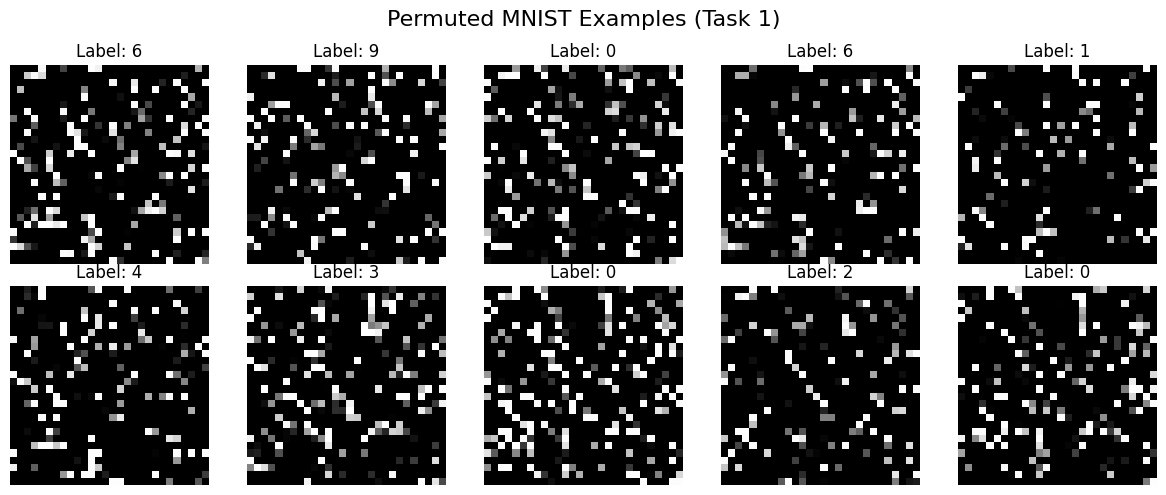

Note: The images look scrambled due to pixel permutation!
The labels are also permuted (not the original MNIST labels).


In [6]:
# Display some examples from the permuted task
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Permuted MNIST Examples (Task 1)', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(task['X_train'][i], cmap='gray')
    ax.set_title(f'Label: {task["y_train"][i][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: The images look scrambled due to pixel permutation!")
print("The labels are also permuted (not the original MNIST labels).")

In [46]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats # Requis pour np.median

# ================================================================
#  1. FONCTIONNALITÉS HYBRIDES (Vectorisées et Rapides)
# ================================================================
def create_super_features_FAST(X_flat: np.ndarray) -> np.ndarray:
    """Crée 5 features globales vectorisées (très rapide)."""
    
    # 1. Statistiques globales (rapide)
    mean = np.mean(X_flat, axis=1)
    std = np.std(X_flat, axis=1)
    median = np.median(X_flat, axis=1) # np.median est rapide
    
    # 2. Comptage de pixels (rapide)
    count_zero = np.count_nonzero(X_flat == 0, axis=1)
    count_max = np.count_nonzero(X_flat == 255, axis=1)
    
    # Total = 5 features
    return np.vstack((mean, std, median, count_zero, count_max)).T

# ================================================================
#  2. ARCHITECTURE DU MODÈLE (Plus gros pour utiliser la RAM)
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # AUGMENTÉ : Plus de neurones = plus d'utilisation de la RAM
        hidden_sizes = [1024, 512, 256] 
        dropout = 0.05
        d_in = 28 ** 2 + 5  # 784 pixels + 5 features rapides

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  3. CLASSE AGENT (Optimisé pour 99%+)
# ================================================================
class Agent:
    """
    Agent MLP 100% PyTorch (sans sklearn), 1 Cœur.
    Utilise 5 features vectorisées RAPIDES + Modèle PLUS GROS + Plus d'Époques.
    """

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2) 
        self.model = None
        self.scaler_mean = None
        self.scaler_std = None
        
        # --- HYPERPARAMÈTRES (POUR 99%+) ---
        # AUGMENTÉ : Plus gros batch = plus de RAM
        self.batch_size = 512 
        # AUGMENTÉ : Plus d'époques car les features sont rapides
        self.epochs = 12 
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        """Initialise un nouveau modèle et les tenseurs du scaler."""
        self.model = Model()
        self.scaler_mean = torch.zeros(5, dtype=torch.float32) # 5 features
        self.scaler_std = torch.ones(5, dtype=torch.float32) # 5 features

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 789 features."""
        
        start_global = time.time() 
        self.reset() 

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Phase 1 : Préparation des features (Rapide) ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features_FAST(X_flat) # Rapide
        X_pixels_norm = X_flat / 255.0
        
        X_pixels_tensor = torch.from_numpy(X_pixels_norm.astype(np.float32))
        X_features_tensor = torch.from_numpy(super_features.astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).long()

        # --- Scaler (Pure PyTorch) ---
        self.scaler_mean = torch.mean(X_features_tensor, dim=0)
        self.scaler_std = torch.std(X_features_tensor, dim=0)
        self.scaler_std[self.scaler_std == 0] = 1.0
        X_features_norm = (X_features_tensor - self.scaler_mean) / self.scaler_std
        
        X_hybrid_tensor = torch.cat((X_pixels_tensor, X_features_norm), dim=1)

        # --- DataLoader (1 Cœur - Sûr pour Sandbox) ---
        train_loader = DataLoader(
            TensorDataset(X_hybrid_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0, # 0 = Pas de multiprocessing
            pin_memory=False   
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        
        # --- Phase 2 : Boucle d'entraînement (Plus longue) ---
        for epoch in range(self.epochs):
            if time.time() - start_global > 55:
                print("⏱️ Temps limite (55s) global atteint, arrêt anticipé.")
                break
                
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()


    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None or self.scaler_mean is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features_FAST(X_test_flat) # Rapide
        X_pixels_norm = X_test_flat / 255.0
        
        X_pixels_test_tensor = torch.from_numpy(X_pixels_norm.astype(np.float32))
        X_features_test_tensor = torch.from_numpy(super_features_test.astype(np.float32))

        X_features_norm_test = (X_features_test_tensor - self.scaler_mean) / self.scaler_std
        X_hybrid_test = torch.cat((X_pixels_test_tensor, X_features_norm_test), dim=1)

        test_loader = DataLoader(
            X_hybrid_test, 
            batch_size=self.batch_size * 2,
            num_workers=0, 
            pin_memory=False
        )

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

    def save(self, path: str = None):
        pass

    def load(self, path: str = None):
        pass

In [35]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats # Requis pour les "super-features"
import json
from io import BytesIO
import base64

# ================================================================
#  1. FONCTIONNALITÉS HYBRIDES (Définition requise par l'agent)
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v20 (Histogramme 8 bins + 3 Quantiles)."""
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0], 1, X_flat
    )
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)
    return np.hstack((hist_bins, q1[:, None], median[:, None], q3[:, None]))

# ================================================================
#  2. ARCHITECTURE DU MODÈLE (MLP v20)
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.05
        d_in = 28 ** 2 + 11  # 784 pixels + 11 features
        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)
    def forward(self, x): return self.model(x)

# ================================================================
#  3. FONCTION DE DÉSÉRIALISATION (pour le JSON)
# ================================================================
def deserialize_pytorch_state(b64_string):
    """Désérialise un state_dict PyTorch depuis Base64."""
    decoded = base64.b64decode(b64_string)
    buffer = BytesIO(decoded)
    return torch.load(buffer, map_location='cpu') 

# ================================================================
#  4. CLASSE AGENT (Charge le JSON au démarrage)
# ================================================================
class Agent:
    """Agent MLP Warm Start 100% PyTorch, lit le JSON au démarrage."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        torch.set_num_threads(2) 
        
        self.model = None
        self.scaler_mean = None
        self.scaler_std = None
        
        self.initial_weights = None
        
        # --- CHARGEMENT DU WARM START (JSON) ---
        try:
            with open('starter_weights.json', 'r') as f:
                loaded_data = json.load(f)
            
            self.initial_weights = deserialize_pytorch_state(loaded_data['mlp_weights'])
            self.scaler_mean = torch.tensor(loaded_data['scaler_mean'], dtype=torch.float32)
            self.scaler_std = torch.tensor(loaded_data['scaler_scale'], dtype=torch.float32)
            print("Statut du Warm Start : JSON (starter_weights.json) chargé.")
            
        except Exception as e:
            print(f"Avertissement: Échec du chargement du Warm Start JSON (Erreur: {e}). Démarrage à froid.")
            self.initial_weights = None
            self.scaler_mean = torch.zeros(11, dtype=torch.float32)
            self.scaler_std = torch.ones(11, dtype=torch.float32)

        
        self.batch_size = 256
        self.epochs = 10  # <-- AUGMENTEZ CECI (de 5 à 10 ou 12)
        self.lr = 1e-3    # <-- AUGMENTEZ CECI (pour un fine-tuning plus fort)
        self.weight_decay = 1e-4
        
    def reset(self):
        """Initialise le modèle et charge les poids du Warm Start."""
        self.model = Model()
        
        if self.initial_weights is not None:
            # WARM START : Charger les poids pré-entraînés
            self.model.load_state_dict(self.initial_weights)
        else:
            # Démarrage à froid (si le JSON n'a pas été trouvé)
            pass

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Fine-tune le modèle Warm Start sur la nouvelle tâche."""
        
        start_global = time.time() 
        
        if self.model is None:
            self.reset() 

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)
        X_pixels_norm = X_flat / 255.0
        
        X_pixels_tensor = torch.from_numpy(X_pixels_norm.astype(np.float32))
        X_features_tensor = torch.from_numpy(super_features.astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).long()

        # --- Scaler (PyTorch) ---
        # On utilise le scaler du Warm Start (Tâche 10) pour normaliser
        X_features_norm = (X_features_tensor - self.scaler_mean) / self.scaler_std
        
        X_hybrid_tensor = torch.cat((X_pixels_tensor, X_features_norm), dim=1)

        # --- DataLoader Optimisé (2 Cœurs) ---
        train_loader = DataLoader(
            TensorDataset(X_hybrid_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=1,
            pin_memory=False   
        )

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.epochs)
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        
        # --- Boucle de Fine-Tuning (Très rapide) ---
        for epoch in range(self.epochs):
            if time.time() - start_global > 55:
                print("⏱️ Temps limite (55s) global atteint, arrêt anticipé.")
                break
                
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None or self.scaler_mean is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)
        X_pixels_norm = X_test_flat / 255.0
        
        X_pixels_test_tensor = torch.from_numpy(X_pixels_norm.astype(np.float32))
        X_features_test_tensor = torch.from_numpy(super_features_test.astype(np.float32))

        # Utilise le scaler du Warm Start
        X_features_norm_test = (X_features_test_tensor - self.scaler_mean) / self.scaler_std
        X_hybrid_test = torch.cat((X_pixels_test_tensor, X_features_norm_test), dim=1)

        test_loader = DataLoader(
            X_hybrid_test, 
            batch_size=self.batch_size * 2,
            num_workers=1, 
            pin_memory=False
        )

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

    def save(self, path: str = None):
        pass

    def load(self, path: str = None):
        pass

In [28]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats

def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v20 (Histogramme 8 bins + 3 Quantiles)."""
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)
    return np.hstack((
        hist_bins, 
        q1[:, None],
        median[:, None], 
        q3[:, None]
    ))


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.05
        d_in = 28 ** 2 + 11  # 784 pixels + 11 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  3. CLASSE AGENT (100% PyTorch, Optimisé 2 Cœurs)
# ================================================================
class Agent:
    """
    Agent MLP 100% PyTorch (sans sklearn), optimisé pour 2 Cœurs CPU.
    Entraîne depuis un "Cold Start" (pas de Warm Start JSON).
    """

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2) 
        self.model = None
        self.scaler_mean = None
        self.scaler_std = None
        
        # --- HYPERPARAMÈTRES OPTIMISÉS ---
        self.batch_size = 256
        self.epochs = 7  # <-- CORRECTION: 7 époques (comme l'original) 
                         # (devrait être rapide avec num_workers=1)
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        """Initialise un nouveau modèle et les tenseurs du scaler."""
        self.model = Model()
        self.scaler_mean = torch.zeros(11, dtype=torch.float32)
        self.scaler_std = torch.ones(11, dtype=torch.float32)

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 795 features."""
        
        # --- CORRECTION : LE CHRONOMÈTRE COMMENCE ICI ---
        start_global = time.time() 
        
        self.reset() 

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Phase 1 : Préparation des features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)
        X_pixels_norm = X_flat / 255.0
        
        X_pixels_tensor = torch.from_numpy(X_pixels_norm.astype(np.float32))
        X_features_tensor = torch.from_numpy(super_features.astype(np.float32))
        y_train_tensor = torch.from_numpy(y_train).long()

        # --- Remplacement du Scaler (Pure PyTorch) ---
        self.scaler_mean = torch.mean(X_features_tensor, dim=0)
        self.scaler_std = torch.std(X_features_tensor, dim=0)
        self.scaler_std[self.scaler_std == 0] = 1.0
        X_features_norm = (X_features_tensor - self.scaler_mean) / self.scaler_std
        
        X_hybrid_tensor = torch.cat((X_pixels_tensor, X_features_norm), dim=1)

        # --- DataLoader Optimisé (2 Cœurs) ---
        train_loader = DataLoader(
            TensorDataset(X_hybrid_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=1,     # Utilisation du Cœur 2
            pin_memory=False   
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        
        # --- Phase 2 : Boucle d'entraînement ---
        for epoch in range(self.epochs):
            # Coupe-circuit GLOBAL (vérifie avant chaque époque)
            if time.time() - start_global > 55:
                print("⏱️ Temps limite (55s) global atteint, arrêt anticipé.")
                break
                
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()


    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None or self.scaler_mean is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)
        X_pixels_norm = X_test_flat / 255.0
        
        X_pixels_test_tensor = torch.from_numpy(X_pixels_norm.astype(np.float32))
        X_features_test_tensor = torch.from_numpy(super_features_test.astype(np.float32))

        X_features_norm_test = (X_features_test_tensor - self.scaler_mean) / self.scaler_std
        X_hybrid_test = torch.cat((X_pixels_test_tensor, X_features_norm_test), dim=1)

        test_loader = DataLoader(
            X_hybrid_test, 
            batch_size=self.batch_size * 2,
            num_workers=1, 
            pin_memory=False
        )

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

    def save(self, path: str = None):
        pass

    def load(self, path: str = None):
        pass

In [10]:
import time 
import numpy as np

from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv 


NUM_META_TRAINING_TASKS = 10 # Nombre de permutations pour le pré-entraînement
NUM_TOTAL_TASKS = 17 # 10 pour le pré-entraînement + 7 pour l'évaluation (comme dans votre benchmark)

env = PermutedMNISTEnv(number_episodes=NUM_TOTAL_TASKS) 
env.reset()
env.set_seed(42)


AgentClass = Agent # Remplacez par le nom de votre classe Agent (ex: StarterMLPAgent)
meta_agent = AgentClass(output_dim=10, seed=42) 

meta_accuracies = []
meta_times = []
task_num = 1

print("PHASE 1: Démarrage du Méta-Entraînement (10 tâches)")
print("="*50)

while task_num <= NUM_META_TRAINING_TASKS:
    task = env.get_next_task()
    if task is None:
        print("Erreur: Pas assez de tâches disponibles pour le Méta-Entraînement.")
        break
    
    start_time = time.time()
    
    # meta_agent.train doit contenir la logique pour la phase WARM START
    # (par exemple, un très faible nombre d'époques pour l'adaptation)
    meta_agent.train(task['X_train'], task['y_train'])
    
    elapsed_time = time.time() - start_time
    
    # NOTE: Pas d'évaluation ici, on évalue l'agent sur la Tâche 11 !
    print(f"Tâche META {task_num}: Temps d'adaptation = {elapsed_time:.4f}s")
    task_num += 1


print("\nPHASE 2: Démarrage de l'Évaluation (reste des tâches)")
print("="*50)

while True:
    task = env.get_next_task()
    if task is None:
        break
    
    start_time = time.time()
    
    # L'agent est déjà dans son état pré-entraîné.
    # Dans une implémentation Few-Shot, on peut faire un très court fine-tuning ici.
    meta_agent.train(task['X_train'], task['y_train'])
    
    predictions = meta_agent.predict(task['X_test'])

    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])
    
    meta_accuracies.append(accuracy)
    meta_times.append(elapsed_time)
    
    print(f"Tâche EVAL {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.4f}s")
    task_num += 1


print(f"\nMéta-Agent (Warm Start) Summary:")
print(f"  Mean accuracy (Évaluation): {np.mean(meta_accuracies):.2%} ± {np.std(meta_accuracies):.2%}")
print(f"  Total time (Évaluation): {np.sum(meta_times):.2f}s")

PHASE 1: Démarrage du Méta-Entraînement (10 tâches)
Démarrage froid : Warm Start non disponible pour cette tâche.
Tâche META 1: Temps d'adaptation = 23.6700s
Tâche META 2: Temps d'adaptation = 20.8468s
Tâche META 3: Temps d'adaptation = 21.0095s
Tâche META 4: Temps d'adaptation = 20.6807s
Tâche META 5: Temps d'adaptation = 21.3341s
Tâche META 6: Temps d'adaptation = 20.8089s
Tâche META 7: Temps d'adaptation = 22.1566s
Tâche META 8: Temps d'adaptation = 22.0303s
Tâche META 9: Temps d'adaptation = 21.1214s
Tâche META 10: Temps d'adaptation = 22.4364s

PHASE 2: Démarrage de l'Évaluation (reste des tâches)
Tâche EVAL 11: Accuracy = 97.94%, Time = 23.7214s
Tâche EVAL 12: Accuracy = 98.05%, Time = 23.2971s
Tâche EVAL 13: Accuracy = 98.04%, Time = 22.2914s
Tâche EVAL 14: Accuracy = 97.95%, Time = 22.1759s
Tâche EVAL 15: Accuracy = 97.91%, Time = 21.4797s
Tâche EVAL 16: Accuracy = 98.02%, Time = 23.2142s
Tâche EVAL 17: Accuracy = 98.04%, Time = 34.6179s

Méta-Agent (Warm Start) Summary:
  Mean

In [11]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import base64
import joblib
import json
from io import BytesIO
from scipy import stats 


def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v20 (Histogramme 8 bins + 3 Quantiles)."""
    
    # 1. Histogramme binné (8 features)
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )
    
    # 2. Quantiles (3 features)
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # Total = 11 features
    return np.hstack((
        hist_bins, 
        q1[:, None],
        median[:, None], 
        q3[:, None]
    ))


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.05
        d_in = 28 ** 2 + 11  # 784 pixels + 11 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



STARTER_DATA_JSON_STRING = """
{"mlp_weights": "UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAAG1vZGVsLjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRmxvYXRTdG9yYWdlCnEFWAEAAAAwcQZYAwAAAGNwdXEHSgA2BgB0cQhRSwBNAAJNGwOGcQlNGwNLAYZxColoAClScQt0cQxScQ1YDAAAAG1vZGVsLjAuYmlhc3EOaAMoKGgEaAVYAQAAADFxD2gHTQACdHEQUUsATQAChXERSwGFcRKJaAApUnETdHEUUnEVWA4AAABtb2RlbC4xLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTQACdHEYUUsATQAChXEZSwGFcRqJaAApUnEbdHEcUnEdWAwAAABtb2RlbC4xLmJpYXNxHmgDKChoBGgFWAEAAAAzcR9oB00AAnRxIFFLAE0AAoVxIUsBhXEiiWgAKVJxI3RxJFJxJVgUAAAAbW9kZWwuMS5ydW5uaW5nX21lYW5xJmgDKChoBGgFWAEAAAA0cSdoB00AAnRxKFFLAE0AAoVxKUsBhXEqiWgAKVJxK3RxLFJxLVgTAAAAbW9kZWwuMS5ydW5uaW5nX3ZhcnEuaAMoKGgEaAVYAQAAADVxL2gHTQACdHEwUUsATQAChXExSwGFcTKJaAApUnEzdHE0UnE1WBsAAABtb2RlbC4xLm51bV9iYXRjaGVzX3RyYWNrZWRxNmgDKChoBGN0b3JjaApMb25nU3RvcmFnZQpxN1gBAAAANnE4aAdLAXRxOVFLACkpiWgAKVJxOnRxO1JxPFgOAAAAbW9kZWwuNC53ZWlnaHRxPWgDKChoBGgFWAEAAAA3cT5oB0oAAAMAdHE/UUsATYABTQAChnFATQACSwGGcUGJaAApUnFCdHFDUnFEWAwAAABtb2RlbC40LmJpYXNxRWgDKChoBGgFWAEAAAA4cUZoB02AAXRxR1FLAE2AAYVxSEsBhXFJiWgAKVJxSnRxS1JxTFgOAAAAbW9kZWwuNS53ZWlnaHRxTWgDKChoBGgFWAEAAAA5cU5oB02AAXRxT1FLAE2AAYVxUEsBhXFRiWgAKVJxUnRxU1JxVFgMAAAAbW9kZWwuNS5iaWFzcVVoAygoaARoBVgCAAAAMTBxVmgHTYABdHFXUUsATYABhXFYSwGFcVmJaAApUnFadHFbUnFcWBQAAABtb2RlbC41LnJ1bm5pbmdfbWVhbnFdaAMoKGgEaAVYAgAAADExcV5oB02AAXRxX1FLAE2AAYVxYEsBhXFhiWgAKVJxYnRxY1JxZFgTAAAAbW9kZWwuNS5ydW5uaW5nX3ZhcnFlaAMoKGgEaAVYAgAAADEycWZoB02AAXRxZ1FLAE2AAYVxaEsBhXFpiWgAKVJxanRxa1JxbFgbAAAAbW9kZWwuNS5udW1fYmF0Y2hlc190cmFja2VkcW1oAygoaARoN1gCAAAAMTNxbmgHSwF0cW9RSwApKYloAClScXB0cXFScXJYDgAAAG1vZGVsLjgud2VpZ2h0cXNoAygoaARoBVgCAAAAMTRxdGgHSgAgAQB0cXVRSwBLwE2AAYZxdk2AAUsBhnF3iWgAKVJxeHRxeVJxelgMAAAAbW9kZWwuOC5iaWFzcXtoAygoaARoBVgCAAAAMTVxfGgHS8B0cX1RSwBLwIVxfksBhXF/iWgAKVJxgHRxgVJxglgOAAAAbW9kZWwuOS53ZWlnaHRxg2gDKChoBGgFWAIAAAAxNnGEaAdLwHRxhVFLAEvAhXGGSwGFcYeJaAApUnGIdHGJUnGKWAwAAABtb2RlbC45LmJpYXNxi2gDKChoBGgFWAIAAAAxN3GMaAdLwHRxjVFLAEvAhXGOSwGFcY+JaAApUnGQdHGRUnGSWBQAAABtb2RlbC45LnJ1bm5pbmdfbWVhbnGTaAMoKGgEaAVYAgAAADE4cZRoB0vAdHGVUUsAS8CFcZZLAYVxl4loAClScZh0cZlScZpYEwAAAG1vZGVsLjkucnVubmluZ192YXJxm2gDKChoBGgFWAIAAAAxOXGcaAdLwHRxnVFLAEvAhXGeSwGFcZ+JaAApUnGgdHGhUnGiWBsAAABtb2RlbC45Lm51bV9iYXRjaGVzX3RyYWNrZWRxo2gDKChoBGg3WAIAAAAyMHGkaAdLAXRxpVFLACkpiWgAKVJxpnRxp1JxqFgPAAAAbW9kZWwuMTIud2VpZ2h0caloAygoaARoBVgCAAAAMjFxqmgHTYAHdHGrUUsASwpLwIZxrEvASwGGca2JaAApUnGudHGvUnGwWA0AAABtb2RlbC4xMi5iaWFzcbFoAygoaARoBVgCAAAAMjJxsmgHSwp0cbNRSwBLCoVxtEsBhXG1iWgAKVJxtnRxt1JxuHV9cblYCQAAAF9tZXRhZGF0YXG6aAApUnG7KFgAAAAAcbx9cb1YBwAAAHZlcnNpb25xvksBc1gFAAAAbW9kZWxxv31xwGi+SwFzWAcAAABtb2RlbC4wccF9ccJovksBc1gHAAAAbW9kZWwuMXHDfXHEaL5LAnNYBwAAAG1vZGVsLjJxxX1xxmi+SwFzWAcAAABtb2RlbC4zccd9cchovksBc1gHAAAAbW9kZWwuNHHJfXHKaL5LAXNYBwAAAG1vZGVsLjVxy31xzGi+SwJzWAcAAABtb2RlbC42cc19cc5ovksBc1gHAAAAbW9kZWwuN3HPfXHQaL5LAXNYBwAAAG1vZGVsLjhx0X1x0mi+SwFzWAcAAABtb2RlbC45cdN9cdRovksCc1gIAAAAbW9kZWwuMTBx1X1x1mi+SwFzWAgAAABtb2RlbC4xMXHXfXHYaL5LAXNYCAAAAG1vZGVsLjEycdl9cdpovksBc3VzYi5QSwcIK4wlQJ4IAACeCAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAXAB0AYXJjaGl2ZS8uZm9ybWF0X3ZlcnNpb25GQhkAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjFQSwcIt+/cgwEAAAABAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAaADcAYXJjaGl2ZS8uc3RvcmFnZV9hbGlnbm1lbnRGQjMAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaNjRQSwcIP3dx6QIAAAACAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAARAD8AYXJjaGl2ZS9ieXRlb3JkZXJGQjsAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpsaXR0bGVQSwcIhT3jGQYAAAAGAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAD4AYXJjaGl2ZS9kYXRhLzBGQjoAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrmrKTywc42873JkvNszqj0m+ZM93QhRPIsz3L3/9NG8ecIYvHFSxL0KhIG9n5YAvTMLvj2pfrM8N4YCvfqVY728y1M9BfUePCnmGL6KrnQ7yCC+vL9+zL3QyZ28KMuaPcwzD75tUno96AnWvWGHQz0Zrq28JBkEvi/LXr3kNSw9UlfxvGZu7Dwu6408PfBcPTcNGz1V7f48VuOau1nvUL3BARQ+Eb2UOjThMr2SQbO8dOk8Pe3Iur3rqK28+dJ2vTQ1Ej3cidq8VUjEu2Ur973EEti9Mu6cvVFiPb2+8jW9WcmbPfKWlLz0KQI99OBQvTzcnjzZyam8VY6BvePP+DyF0zq9jjsYvWVa5jstjjw9SzFDvVgAiL1jExK9wWKXPItjZr23qaq7eoLEvTq7hTzvQCS9btrmvbVWIL1H2lO8rbaNvcTQij3icRe+DRHBvYKElT0qS8873+UEPcntDb7ZDB091lasPdQ87LxELwm9sho/O86goTw/ur88HQt0vX81aj0bNxa+QQMEvvSwsT08yxa+pfSxPH9ELr5wgCs9PVtYvXgTHr2wqYK9ctgJPXgRhL0VBOq7V02wvCcbIT2Cs8g9DqRZvic8RD1aHIs9QHBXvfSk4bwdBzc8FDZvvDqMhzz9Bt29n57hvFVR+7tt9iO9MNs8vZ3fbT3mKFC9jIr+PT+01L103JI93FLLPAkXTLwUvfC89+CXPfugp70yi9C9CKcgPXu75ztrWle9UTr8vHBJEz1UgPu8XMnLPKKZsD2hpZW8vQ3ovAjvh7zNrcg8GI3yvKXsMzze5De7usxlPQPTK70hWWw8qYyEvRMHF71xiUq8bpC5PW1MdL1VU469EaWjPR0xAr5WuDS9MfpLPbBtPT3QIVa9eAyiuWcQuL3+kF88QDHwvW5ygrziGu2891WXPL3mYj1FLGg7kWPyvQMMf73l9p48y7vqvBQCs71zK6k9uZ0Vvaq21Dw11WA9YFemPfYynL0jKNo8lwyGvfNAFL04ZZ+9isxrPKTF0725V9s96HzEvaDr3b05ere9nmvmO/b+Nj0ZdIq7K3FlPQvOabvD7rm7KmddPWoznrzd89i84O60vbkCUT0uDKK9pLSavDN1Bb5Y5BQ+HjUDvb+xir1V29u7By1nPHkgsLzEars9IJAfvQq1yD0XUBS98LALPakLTL1+qrq89s6BvYeoCz3iMsS8Jti+PMP6wr1OgoO9CLsbvYem3LzEONI9WTa5PJqf7b3Rt3Q9SDYTvaazFL54Txw8rXE4PWiPjrwl1oy8C0Clvd8gk7zYewa+zhQ+vPSP1bxCxhC9+xvHvPIlnTyJlAm9fSEzvGBw9D0plgq+t3SuPD7y4bwafoS8Kc8PvY5+9D0H5Jy8MKRkPRyjLb0ep1e9oi3Jva2NBT0kAdw9XI5KvXi897zsWhA9AX4kvobeXTyAoFq5i3uKPQEJFz12GqG8voigvaVMAb2yjhO9Fu68vGBSILxeSQE96pxCvSY+iTyqHns7aJ0fPI1tgL3WDsy8i/NlvbuECL3cXxe9/HQCvTkOjjzPt0K9BKABvZFYfr3ob4K9udpSvA/n1r1NRBe9B2UTvTgEQbzbWvG8zkdxvYDcNrwIgJq8abRYvcv4xr1Ange8Jg16vR3QlLw3wtK8Ov6aveaWs71XUpG9SEAJPu9UN7yZDZM7wwJYPGNpez2wKPg7cvt1vSDLA7zMRgo75lDkPBVEsjwZiWe9IJADvbtnOTzHMxu7qY2JPZLG5z2YeTk9ceg8vY4BtzxNpcE9JPHwPOd4AL5Y68i9UtzMOxon5rwGNkO9B6dePcDPHj1o9wC+rd2lu1AYkL25wMI9EAIaPVqKrL2Vt3G8w1XrPJYybTzuo6o9qTzPvSG9Yr2mXi89ocLcPAzoib3FPYG9kxDfvOKSIrs9E+q9yE1Qvbv3kb3VPr49DV1WN/l2tzxyv/O96Y2JPXaIor249509KwWZPVLv47yO3AM9f4wZvjsoSr0+Lma74STWu7w5Cj0lq6q832nmO2A1qz0Q8qI8YbP2vAHAEj3SECe9emk+vet1g73pEv29nB1wvYQ20DzXBYC98ECIPZ2QuL0SwgM+1rfPvRGphT16ZH88Jep+vblL3zsfovu9AoyrPX1FYTyxmCa99AZPvV5nK73Eb8O9AxDdvXqHHb0GpiG9ve4Nvt+gQ725j4o8bMTKvXntIr67hIa77AkcvA/9U721oFM72KkUvCEhlz3aueM8dE8CvluBsb0Nb8U950O6vM864Lt+7gi9UKBjvXUULD37CJE9/fe+vaAqKTyuV6c9FRSUvcIR8Lt5hFW9xqzJOwgsEjt/FtG9tYMVvYni0zxwPt29LnXkvOEIf7zOG5Y9jj34PDjuoDzOOR69PkDtvdmkJ7s/avi9CMKTvVeRPT1DLge80Sz8vAxhjDxYlLk9R8wNvRhsVDwSdr06MwJwPJxFm7ydzVW9PjNDPR1QqDyDve28ZdhtvCW87zx0N7q8ziIKPS1FW7zsHOu8GEuZPTPRSb73GYw8OyuXPUNMkrwI0RU+XdQmPaDxDTzRnRa9gF0ZPM/EDr1mU5e9/Ckhvecxqj15A4C98F/QvPxc+j2rl1W9FBTCPIWfrTzdIns9zSjmvUzttr2TGQe8Hx6TvKL4nbwSDI89JgjVPXI61L0aiuk92NCGPGe/Bz0KOCa9/D2DPYZEwb3HTam7qfy7PAa1l7zKTyQ9m8KJvbcfY72TdjU9i662vdejtj1eXe+9IypWPQDvz70qz5A9Q+tRvQUQDr1JFQe9yfbCPesDwjxALh69L8pdvYNiDz28MY89hDdbvLCjeb27w4g9wA2HPD1G672EyR+9qsTtPHrVq73PXS89zBbTPVsJJT7Wccg9I00FPQBDrr3CQwo9Ad/KO/OX5jvI4aE8+XAsvYshIzuSZVk840WAvSYODT7nAaU9UcaGPEd5Bb6kns69dUaHvVS1PD2Sj2c9P5SyvB/MtboJFS29XpLkPJVDTb2mvFO9LsxWPSTQWj5ZL229dWTsvaf2rT0A/se9K1J3vWKkZTwudeM735kwvQQ0Fb3Ul3c99uArvTXuq7yFRYc9b7yPvXV1nDxezQW93XRfPcMneL0EqvM9KN2aOgy0gL0gbBo9vzjoPUollj3hFB++o8SMPb3sWbvm9ua8zdIWPWLvpL0PJAo9IlsSvcxNm70aKbw96mZlPa0BIL3YRPG86AtFPROpMDw6Wjw8s/KcPP0lNz3FmwE+8gVIvJADxjxQ6AI+x6o9PQHIxT2u55U9bYdOve7LUDyZCKM9x5vdPO5nhL1lI/C9F0gwvibnqj2NPxu9H/Abu5Yawz23r5+988aourf5vL3pnry7WR5fvRpWFT5vNhm9FJrUvYT4iz3cYhy9JYFvu88qp7wfVVO9vPCjvWu41D1YbCg90ksdvlfj5r1EbIq8k3hNPaFxXb3o0lS9HQSJu/GLIrwmQoc9X7HEPY1/SLwt7wk9y2f7PNKhDD0rCm49TwyIPXnYGrzDbak8HttCvZCiAT6p2ze8jBzTO7ZvCb0CP1O9uOXUvWUDrrzaAcI8sVyvPR26Oj3tvYg9b32CPW6xxD0iQ/07eXv0PS6rUT0Ib9g8mb4DvVYj97sg+CW9azqwPGbnnDwJ/Ro+ysgEPUBIwr212S69+lGCvRMZwLv1WYg9DXelO/ccHD2qAr+9QV1DPedpND3JVFK86N/XPFqeMz7RCAi9A+OPPH1RI75TcFi9opTLPVrO7ruDhQI+G4z+PSigBD16RtG9VLX7PM2agD2JB8M8WhNHvYgWBD3Bxpc9yMYLvVxc4rxt17g8l6RAPZaQ4Dzc26+9KSuQPcxjJ7sDMMC9kIpDPXHTMT1tWfI7kxCiveB7nLvulBu9WmQIPYkLRrzU7eI9spPZugAJHD6l6NS9nN37vLe6YTxt5zY9q0m1PXQInTzoCha98EslPEh1wj0/e888FdosPcVFtr003u48aeOHOs9wnbwK9jI8A6i8vE4TW71VeDS8AL9cvdNrAz7FkWu9Zs2nvLJEtbzR3MC91hmqvc6tBz3liSg9gcvfOySSXr2p2pO9rw1MPd/bL72i0fW82igtPbGbaj2jNyG9Z0IJvKSyLr33hoS9QliAvfgwXzwjWSS9RRLUPLfSCbs3/Qi+720AvbDwWL1ahJm8AiaCPUDFhrycqLc7MKyzvKUZKbx1yvE4u3SLPPwlkzyXO/O8TvOhvGpNlLx/vLe8F22BvRGQbbxGECY80yF2uoNMDr15jRW+5BQBvsvi7zyCEcG9S8/DvU8UKr0ti6s9JZOpvcuKrz2G9bM9uryWvfQy5Dq6Qvu6ZO+QPZYIW708/bi8XRQMPjN237w5gb283CABPfRNOjy0hs67HuclvcDM5j0tlRY+qWSXvVWp3jxWwDS9b7eWuuHY4r2fZMi8IKe1PeUIZ73eaYA9VvRtvbqAqLzJceA9C2lVPZGSrbwrPG69s3l/PfYpbr3Rh0C8eg5bvRLUlj2J6dQ7Bp7bPeQeHj04jlQ92JsAvc15Nr1u4I49HpM+vf0f4b3G5/68rCrcPJW/qr0+uTA+HqfEPbFt1b1JmRQ95TVBu/Jfm7q4oD292cQTPtCkijvEBgm9NdJ0vaquyr0amYw9QR0xujV8bTxsG9a8ygrjvfYR8bzJ+RU+1PtlPOSxqz3591o9QMiqPgvtlrpfFRM9T8h2vWCbLr3uuI09XsIWO8zikb04Rps9czE1vpgDOL5tAAw9oO/ZvbdqDj0APMK94GEmvZieC764gI68k8IGPneQID6mGNg6yG0IPbhluzxjfWu9qCuUPfMkpbxOU2S9pGfgvNtXKb1rORM9y2S2PbgQgD3OcX49rL3xPZcSsr1pBZa9e9BZPR+WQr1f5Cy9oCmPvSkYZz1wXo69SlzTvZvL0jyhF8K850CIPH132L3P5Tq9ljsBPc5EMjuCeey8D+pmveGCmL2PgCG9H+9cvX4WFL4U9h+9pnKWOyU/TzyaY3Q9h0SpvUMZgDxnuEC8a0EBPQZdybyxHkC9U8kivQhQZD3yHgA9Uqe9vcsp573C9s08zWk4PRnMyj05poc5KQ29vY4IGTwqObq7FN7dO+ljE71Eyhc9XP0KvfPYSLwt+pO9J3e2PWvzlz21Xuq8Xt4HPHQbHT0j3Aw9pAdSPWyt2bowWKa71tjvPK+4ULxNeHC973fMvDoRuz1e0vI6Snn4PUkEaL0uHxI+8aNHPYQ38r14wC+96CTcvOD5Gj2QH4M9jK3BPAnhE74igsY9YCPCvCDNnjw3OEu91UcaPRD8y7zQVJW93KZBPu8oDb1BXxm9aUpxveVkMz0FrZs9ccuHvUeInj3wGOu807w6vZQzGT1XKIW9ZjN/vW3Tcj0Qm8e9Gro+vbIusD0oWVw8GheuPH6ilr0neLC99ysoPsfCFLxuN8e9Qai8vUR2Xj1U8r09YyesvE5AZD1Hb3Y8deIrPfq/xjwEAL68WU6XPSJZ6jv5qfK8lOOFvMPfgT0Wjxw9dTjivIqoJ75AwCO+G/2bPCxZ2T3DHqc9uTCfPW872LvMn5A9B9HlubVdaL2qQ8A9btdHu/QBoj3IeBe94BH4vDqX8zuwJac8oEcdvZta1ToNlo+9siqvOzhoZD2u9ie9AetWPOjZ/LyanFg9bJy8O/QM7T1qlAW9+VbDPVYdGT2UOtw810KHvZs5RLxh+ma9HHhYvb2KVr35XMa96lrmPdLCm73ki9K9bwo4vFwgnb1W37C9GY+nvZA3Ar7kkuC9TtAVPE7GirxVxN88MG5lu21UqjwZvrE7wmuIPSjENr10P1a95siguxvkiTtwuEU9P6qduw7LY71gaM89qqtsPKJrcr3aQBa+UiBpPTnEkjkYm4a8ovXJvOLIpT3MH4o7lrEyveiDGro7HyK9NUyau/bRrjxD5iS+vHp8OxNn8zxW3gA98LWEPQzb/LyPjO69mNPUvRse5j2tR8C9ZWM6PdWJxjto/vO8yUqdO/GRNT062Tu9rvACvmoT2T1pCJe9jMa/vFfnez1N34291RtUvZjIyj0acus8uTG9vflAk71uSLU8ZmZkPYjgwr2i8oo8koPGvXrPzjzsJ+69UoGUvf9B1roMF5A9OWCtu0m1oj3Lqt+9ZUFGPXFajzrUeWe9uP0GPvZZJjy8Crs7ulcivfpfnT0p7CU907Kgvfuyhb0AFkk98/mQPUUl3z11wcG9dNMOPFcTi73PZ329f6sCvrmlZz2PLv87JgT+O97mRb3JgRI9//ycPYnkjb2TAvI9CzuVPQEbxL0ll9u8CSDVvfqX5Lzh3IK9a+gIvkEDET0lXaI9QQ6+u1V/lT0ejiO81IlWO2pLT76dl669rGOyvYNrnj0TeQS94xk1PRZbDr0dUqm95dWmvLswvD0sowo96tQCvtzVEr21NbW8NEbKPDhP1b2+zWO8f9uBvN/roD03ryW9rtYAvn7IID21aws+RNUPPZWtF71clBi+hhkfPcJxZz12jEA8zwBbPGdiAL4MQFO8UAutPe6tFzz0PBE+07ghvuUvEz3LCMU8qWGTPNet4DyMIR29nxEpPuMwe72bf728HElVvUpGOj4ssig9nAdXvDCWTj2Vhm69ScZYPeu/mjzj2iW+UrryPJCALjx86qu9xHvuvL9yRr0TKfK9tk60u14hkL0oaEA9J5qLPZpGYD1kLdq9psYWvX8z17mb8CE9LcBpvYmBzL2HHse9pnKXPRDlo71wO4U8nrfqvS0Hab2iurS850OcPFisw73oPBk8bQ+JPDvJzjx/Euu9DInMPIgAgjxY19o8g5pLveD6eTvmRsM7iXfpvEW1jz2CBM69NvHDPVhuUb3Uxug9txWkPIoMfjzAtkg8TUkxPQ6Parsc2Ko7FuU/PGD1kLuuZCq9hwFjvbu53T0g0rK9IcO2PYttJT2D2j++5/kZvnBcAz3y7mA9fGbdvdSU3LzkZqo9SfeWPZVSI70PfF27JdC8vbcgqT1ytBQ9HUgfvKD/kb2yGl+9oKEPPI7EGD15UiO8QfUNPq3Lcj2B/Z88AqS7PW0KxD2GhYG8c2/mvSkShb1DCiQ9xDiLvar2vrwk2CW9qKM+PUhhC7xvpDi9K84VPuZzSTwbybW9YjC1vdyKkD1/LAA+FAwnPRVW+rzKT2K+/wYdPY09EDu9JY098kYEvQmbprzyT5a9ty88PUnm0TlD59O7NWfzvWGQHD0a+3c7pIQivSqYwb2AZBW9ij3JvV1cRrxJ9Na624eavWBTFzx8fq89e00wPCRzK73/VQo+uepMO79nDT7rKcS9TlpkveCY17vjJES8HR7KPfEu+byAKRI9xqokvQQ2AjxY1qI9jfLdO/32hTyQw7E9CkCbvLNDBjyk/om8uwfdvCbhk73HGt28MktIvfaFHz1viIe9A9siPeBxGT3yBHM72bpyPcqBtTuPZ8k98pAVvk7Alr2Zp/W8iXAbPZj7ILxWdio8ZdiSPfwW2zw6dhI9IkP3vD3vHr2XUgu9JNGpOwrGr73Cuna98KVavcySxr25WmM8WdC+Pfb3Lz2no9I8yFm0OVyVa73gAhO9BKGZvZMNB72bWQG9QmOJvEu3EL3ZH0W9zS6uPWACSD4HlPk9vcucvG7497x822G9Z47UPZpOPj3Kmxm9PmqavC9yQD3SkWe9+20EvhB9jD3ipAc9x2W2vUm+Aj2d3ss7+siXvaS3VT3cydg9ZnKtPMywozxBSo8844bRvcwmLT2KqTi96FJ+PPMWt7x2GpY8cdB3PL3O3LxKocK7yPfcvB+2EL4LD5C9IpmIPd0ubT0mbF496S8VPlDRQj2ssuc6TDJ1vYmYCD26wjm+esPIPLkieDzXUPA940DoPaC6VL0HpJQ8ajtuPblMaL3d6z69S1u1vbwe27wYDbE9u85HvMQWzbwE4Gu9jmmNPfsBM72Kf+29VbQDPI4/uj0e1aA7OlWdvD1oJb3lwgo7ySH3O7i28zt82wM82TFLPdjxnD0TOru8AU8DvumIFb7TJn290Lqmuw9UVj0ObUa9OJFCPctcIj4FTkA9qNjZvBsDozy4IyC9hJuVO7a+PL0Wueq9jhGFunCX/TzxYuu8otVTPaSjXj2XgY+9DERXPS9L6Tzhz+S94CCjPAWUCb50AH08byRdveYx3j0cKiK99NiKvcBm9by6BrE98se2PNo4cDytJQ+8JnuHPIMCIz0vVwY+U9cWO+ViwbvBWuo99X9UPSaJAj1z7q+8b+WJPe1m9TsgOWk9L0GQvSucQTzDOBI9bXQWPZV1672jRsi9TgkWPWwKj7yPn2M8vwn6Pdtyk707c668dl00vRJRvjrKYlC9e2nwPQ/+jbzB1Ni99ZhMvDHWrjl0O/i9Xy9APr7dz71yXKO9EczfvKVeoL15aG09Ws/MvM51Mr2Arf+8qIv+u4DuuL15Sbq9cTARvW6VOTv+Ch48CIMCPT3RNL1Nspm9qlGnPHY4oT2hLq45i3sZvVKbwbxbKbY8/ZbVO51VEby3PD+99+q4PciPQ7sxbFe9L0RKPZytT71Xh5A6uUFmvDkneDwHPl49EvK0PfMxdT3U6qS8jZjMvQDEAT5d6N28QmuKvaSi/L0wxQc9MDuBPSVYdL0ydDU9zs3ePLUIRT1ZbMc97B7wPGRaSbwNw329/ddRvSd+rT3ML8Q9wlT/PCZemrt5Nd083pYIuxft2r3paE+9rFIePdyVBj6D/+m8vmRAvV7cHT7Pcp+9d7bGPczonj0Ycb+9UylFPTI5YD0qlpY9LACAPRL0gT2htuY93VU8vTo4zbz5zAw+J0/ovccFJj2qayG9YsiSPeNBvr2bdCi99jspvL3hJD0b0Jc8rCUVPWDlBjzQhF+9Gd7APfbp0Tvdspe9ZVJfPcJBKT2mcTu81o2FvdTLhT2G25+90KOQPX694ryWFQk9b+EVvb3JmDvUS1K9XuSAPUBEJr0n3BQ93fmIvHFeijzoHlG9QlegPN2ofL2P9RI9HFPYPBoAtb10nLM9oZCwvCv8AjzB1SK9vssZPiKibL1C1s08egzRvPwYOL2uJRE+RREAPZD+Ur2M+pE9FLdMPRCA2jyLkdW9mXQZPuzzdr3gNQ49EBGSvMjISbyJfva9w8s2vTaj/j3CYkC8DI/+PbiSWz3aLPE9wtQZPfBk/71UaIO92OADvlND8TxyMlO7ChqYvX84Hbwne5+5lwZcvTbbhz1jJ5M7952hvII0hDw4+7c8NNNxvT7uqbwrrZK8R9ArvZyQZDxJVFq8J7iAvZDx/jx7BWc88iaUvXtekDz1nfe9W9ZtPQKRCT0/XeM91EtRPXhWXTwixpo9uIWNvQ7TKz1ZOhq+M3QwPTw7MD3FevA9GriwPcjFKT2f6I69vu/1PA8oor07Nce8pTUXPfqoor3k6Gg9TixfPH9qRjy/gLu9zYjpPIwPM71Ax0g8lcSGPfP9DD5aV6k8VinxvM4C3LxrWYM9NNn+uoNFmD1p2AG9zSHcPHDAIj0fRqY8vNAtPbdtcr3M/iS9gd7ZvVv2Vr3me/48Q7DjvHAUs70CPTC9IFGHPeTUCDvlMUU7q3KePQAOjrxradm8k78KPomDnryuY5E8VZwoPaPd7ryuUoY8p8WIPaTJsrwg/Zo9hlY3PdSQpL3UM6c8Uii2vX95yzwc1DC8kDUjvFIegz1gb6i8DiDUvG6wlT08EJy9E6KavQQHP7wyTlS9f/GsPDOfFb5yXcc9+sG4Owkr3DyNRIq9ChcBPEPedj3MLrM9jgvBPBmTyjsvhpE9e4ptvLbkwTvIeoE7Ex67PWu8pj0TrtK9iZRuPNEsur2EtF881sgQPAEWbr3kdPC9gJXIPLSLuT0fafg9J14ZvUobtL0I2FG8GDShvAnqzDso4wO+TX89PFI1cj2oqH69+tvru2uwFD1NA7y9VH3+PVKPnTx/hzM8oZCiPRQhC71uMR4+XkYPPe2Agj36qp49jNnWvWezxDtqo/i8c7GavAFBLzzjKIg6JSWpPS6FnjxKjwU+htw8vV4jo7x5+2k8ft5TPCCgwT2oLLk8XkWtvaK7Oz33k289u+TIvcLqsrz1TIW9kwRRvXIocjspZ2G9MkbyPXgXJb3eUDG8YblXPPk8nT3bZm09QD8aPW9Z5b3nk6y9tP5aPOYMmb00yey83FmZvGN45L3EeW499EodvbJCqL2gO6s9mTgpPu8FWr0kk5g9bYPEPB25Ab3j/k48uuZXvQbM4ryH/gM9RkS2OwTGpLw+JH29pWeQu3B7TT3N2TS9NcRsvQes672w7x29I3NWu6j4qjwvqmi9n0+ZvF/xzDoUlaA9knxjO5qZeLx5uwU9iOz0vI4B6z1+aZg9Nz/gPHVzDLm03Hk9EZIbPMqK9b30xwo9UK/8u7Qq5Tzn0v+8eyVBPVpPdT1J6pg989hHPD5TDT1l52m8oPy9PNaXvr2WIZe9yYPlPL1dQ775Ixe99W1yPY3hGT0yMRI9OenOPfGHyrvokDW9nPAAvHKy77vnL6K8zPrqPHFzyT2Ks5G9Vm4EPo4Zpr2WFp+9P/k4PU0dPDsEMfA9NIyxPP7zP74EYbe97hshPB7KTT2q2UY93pO2PUV2g70H7dq8pL62veg4Kb4X9QE+HTWgPcsyIT0C1eg919lmPf03JL2t/1y9y9jpOw6orb3bdOW8HaCfvRAhrb07Uqo9+pXru+UeZj0OVaG9SejSO9DmVTzNXKs9GlMNPRDG1z2WUXG9k0zFvTDSsjn57uU9ANe1vCglG71meck8/T3qvVSHJjxfm4e9T9iyvTX0BT3diUq9lPVRPJPeKD1f09A8EhANvdZH6r2EtpG9fSMkvVo5BL2ckZc9L5JZuhhyXrxFffS9dSy+vcf6a70k5Gg8eDDjPBsY1z0UDJU9jp1svOtqJLzXAxM8gebLu89Hsz2dD4a8DsDbPEClmL0z0U69Hq3BOykmlT0mKGm9cF6kPcJNwbxXWTo9f7J7O7bndT3ktvM9QN2EPaxM1L2EgAA904y/PC5ce7x2n5298OIcvuCjwz38zRI+IoqIPL3RYL22a6I9zJSEPdWrez0yYNC8eiF+vUD4NjyJT8U97zr7POvJRz2bfBs94hCkPS0F+zzvALe9YsaFvMO957zxZ2c9ytYzPNw7s70ClEe+63L7vMx9Hj0NhKC9wMXZvGz8Ez7Kc7O9iLSJPcpi273SH/Y7jQWOvOi49DymLN09K2Z7vSb5C73cLVE9jKuNvD1dxzxY8jK9srJWPHIGOj3M8fs9O8eauuJa4j24prI8LTgavSntaT1zeLw9qWBDPfPH4zu8XUw9zFYnvI1lSb1Kweu9tE8zvdgQC76BLqg9Dmp/vYy3pLiTDeU8ULC8vQqD0L1qHY69dgzavcNK6LulzUQ8Npimu9TVgb3Twzc9fPU1PA/G8z3kHl09NppeurlYar0HyzU8/YA0vGvfXjxmBwM75fgkPVi53T2imYg8hDR5vL9dzL2rqrE8FgzcvJeh9Lyxuuw89Wo7PiOkbTxPC1u94LFYPb/dkj3+ICc9dEptPA8ugj0AQqu8PIuFPcacIT1W8sy8i/bSPNp0vj31rv29EwsUvXR25TwU9cW94vgjPTaglDwc5VK83BCsPGJrfL2Aq6g9NBHBvMO+2D1xyAC+I205vnWKbruntps9L9dcuxb8QL0FCfQ9KZp9vUCV6j0GgQw9JXDKvcnKBj34Qic9KUtoPZ5nzb3gHq+9e9mBvdyYpT2/gAc+UL04PSa7H7z5d6S8Q8sEvflFpj0Dl+g7OzEjvXorlr3uiT+9rRmYvfjtFb1/Coy9xR8IvbitfT3gAu28F+MuvT7qOrwKT9m9Mp27PJKbzDxLsEU9xOaSOuf8D714BuQ9jGRYvWM2aj2IjUw9NOb4PenCpz0KRwk9n3+IPRLV/L1Vy4e9pYsYPTtoD73NCGe9S/WMPa8NPL1cYAG+roCFvUGZozy3dxM9pRZNPV40Tj2UA0y9iapBvSbn+zv8VDY9HgxbPU4sDr4DuQW8rFoLvnXBqL3UEtW8SiaPuzPnn7vsQVk966PrvUIvrDwsWXE9G8R4Pf0shjzn2JM8/KahvS+bK7wjrIU8rp3lvAO7qDzKMwM9MJ7oveOnqz244GY9ILN+vYqYKjybHN+8I3KHvXBOI70tpTe8y2KUPWre/jwfDqQ8nfGauz80Kz0nH0a8UdCTPUcI7b1HA4Q9DzN4O04iVz2lSUm9jpXhvRZhXr1mmwg9Gxy/vUeG7by9Zpi9WNMfvbYvhT2si4K67g4nvUfci72QQQW8oFcNPd+jozzKBKA9CfWcOx0gBr5jrAe+hx6XPesngzx3MJQ9wVb6O4g0qLs2aOC8Wth2vXR8aD0qpow8LQh6PbFsGT3wh+49NRS+PI7Hwr1f4YS9r2WLvEIiyT0mExC+pJBZPeqX6zwa0qW9ISGoPfcgrb2lXQU9d9dCPqsApT0ndYs88kwEPVUq9LyA6N489YUWPrtjFzu6J++90n8HPQm3E72QZ4O85Q4qvJuN/ryy9tM8vt2rvYlOTD0tLts9h12PvUsOFb1jMwG+X8p0PdDI9jzu3aO933KmPY/nQz0s3ng9036mPUxDTjwXaro9HKt2vXOwDj4D2MQ8ycjzumf2Wb6Qp6w7FZn9vHXB7Lti2HW8E5hdPAXCz7yPmBy9MS7Gu0CqBr2+yJm8TmcEvVqOGTzkZic8PT04vdjRj7sMHLK8JEqYvRhajb1iGM+9VO7GPXFLr72mVjK8pYk3vcMNM7wqXR89+5fjvYyzGL1egFO9pwG2PFTvmzzxKnE8f7Y7PYlUlT3VyHq97FohvkpDmT3kk3K9VNbqvCn1P72baG29wWaRvAxXuD34rGM9MEY3PrT1jb2+/uM8rgngve0QZby42C69urGOvF2FjD0TtYg7OVMTvRHjfD3Kmvs9pW7sPPmdZD1VVgG+rOb5vC1Cqjrrj429iTqbvMthRLxJLK88Whm5Pafzrj0Xr7+8JHx2u8Wy5zxGn9y8EKlDPGQehDyc6VQ9k3aTOvpAt7upPP889kcCvY+byLza00i8Z+9FvNrKob1GkFs8e8UqvGfrqr0jl8M8c/UlPJYqvzzKuKs9Std6vdwkAD2rnri85F0ePTTPkD30sjK9K1CUPar9mrzj1lk9fmBGvGzkJLzjKrs80zsjveLEiD3zMbY8t1BePOfKub0B+hq+nOeQvWTYSL2+l/Y8kdczvsn4AD06hIw9EZHyu3mfIL4ZLMM8IrsjvQV9xbystjE7BFM0PdEvuTxZ2hO99ipdPBkm4r2f14E9BrZwPfJ9Mj3XKRm9+g6yvYMjWTyMtQg7DQQBvRROv7w3w5m90o7ZPB/fQL3ws0G9FIHUvSTzFz2c8II8wg4+Pe8p3j2FnKG8b5nqPeCxzLxykp+9XjTaPCKrhDzEahQ9GNi4vf7EXD1C4FW7/YoavUW/PL2BdK29yFqpPNsuDT761fA8vzETPLpTZD1bUh+9anKMPcOQKD2dOvQ9aIGVvTaMX73a2nu9/++JvNpALjxbDS07FJCGPV39Crtpcgm9rK9PPBAv37yg/7o8QVfuPDUMGTyEfLo9AsF7PKqDhzsIygC9HUeOPfcrrjtKbUC9PNG0PQDaYj2AlPC7ZYhTPaOcXDwtyRK8Sb2mPZwOUr21mpc9WNUYvUtcujxSCsK8dVeBOyv+MT6Yo6s8s26BvbXlX72oFwc9ZDm3vT6nIL0JALY84WErPpORU71lb0I+0KwUPcCIEL7J/Vi7CiLSPZqxIjx4TeY9pxngvFfKxzxeShA9nEwLPeo+qD3uRGc9Rwn1PUPZsD0TtEM92nqcvIHg8T3fO8a8Mldwvf/6FD0AN729A5VIPcmeRryAnc89nR2fPN3XF73AJAk9T5Oiu1UhLb1ODcu8oEf1vLN9nb00Q7u89RAEPaEtoz1PmgQ8SG9HOwV4ub08EmO8dN4sPVcjgr0asoe9uLvyvKIKDr0yB5+7uy6HPaHZIb23Lce923UvPG8uALzC4Ma8zpEwPUKKQj2mDV69cmKxPcZSQT0ACJQ8qf7NPZa2n7z0WCm9C4RJPWihNr0WV5Q9ygDIucxgzDtB18y9g+61PS//Vb1ESLe6xWjXOyybL7zK24S9wVUsvSv/tLqxVCA9EEZfu9cwKj1Drcu8mPqjvcVsgz2+i8O9sQdNvJSvIj2rtgi7PLQpvQA6mTwOCeO7UupEPHrq87xIrVE8okITvS1l7LzBBFS93W/wu96kOjtGL269zVIaPXRFA72qRx07AQGUPSkegz1OpV685RK9vL26CT2tqhk+dDO2vczukj1RJIy9jA+9vPtBKj4aJ2G9NBivvbNWw7xhIMg8bFHLPfb7YD2zfU68N0FKvb1mf72ItpG95/h7POgQ+j1oE+q8xkADu7rILT1KXKy8dV5XvZa+2b0sVWi9pYu9vJ1l7j2t1Jw8gfnCPZQQhj3drr88sn2GPN0pUzte1II8vNJlPZ4WzD1c8DE9KprjPMu6iT0rJC49IqcJvXsdN70UdFg6S3PhvAv8rT2k5oY8g4PGPQCz27oDnoM970yyvZwArDu73pI8zyHauqk7grw0wjg9nCB3vZelCr1j8oU9mNXNPe+AFrwm7FO8v0K4u9QygL2kvbM8oE4LPoZxoT18yR0+UpgpPVR0k70x6A29JXZXPWw76T2ci/u87cV0vXtR3T1ecdQ9kylavB4yKT1E4FY8J13VvZG0Kr5qz5o9X/+2vSSlOj2dvfU7dAQfvchA3719rXO8q4MUvoMyDb1p5f689o2EvdeRyzyQlYK8viR5vVHco71AnAs9YpGnvWxkLz3JZHa9fDejPUVXbT1c5BK9pXHYPEIr3bsJGJI8+6O/vcPtsrzpsbw8fZh1vRSAdDzt+hU93g5iu7yn6Lxi8oO9qw+OvKV69Tu/Ps67lVCjvSETr72J/zG8jFgLvdMF6TwcqGW9Dg+uvfO7pDu5Asu8gqWfvWfaLD3GzZe9pfv8vIb7o7ug6Cm96HjiPEEhXT3FLlO9Fpo5vfyBurobvzY8ilqHvBOGKbyJdgC8RMJ5Pa+Jfb2wQO+8xlyQvSkiOb3h6rA9DWk9PScLer1cIXM9wdQFPOOEgr0g9ru9wB6KPVXDLz3rAAC8I5ItvE4LAj79OQs9GrvHPZ0uaD39PBc7Bu5ZPWDluzyGSZW9pBspvWR4Kz1YMp8935AdvB0TEL7LqGi9QvpuPWcVMT1RO4G9MsLuvEH8yT3Y3YW82siPPFFe3zxLALk8UjnovcKJlTw+ZAQ9meNoPNOmh72TH728XvI/PaOiML2DKsa8Hx+UOzd4BDtzmx89AP2bO2iIjTrLeb68C0ZSvfV9lD2aQ9C9KErNPT2Cs71FpUc9OQ4hvTCY5bzIX5m9J2HpvH+Urb16CCa9qVNfPaq0+L0j3nI98o1xvcjcj7yc+XW8sfjNO/PBbD3172I8ZbMquwgO0L3IGsO9Wr9/vNHooj1oI4G9221xPTQFo70QXLC9oshGvUbv/T0zN7m7F7aKPCt8qrzfs6o9G2LuPH0dLry6tQA+7lIOPKO+Gj3f2Zq9TjCBPGhbjr0eH0C95TuBvcNJbD3izQG9ESWfvFv+QLzPo5a8WSIZvVKiyb2P1wS8cwf7PfCVvL0/M7w9pz7uvKQaFz1k3hc9TjQHvjmmyDw/mPo9/xukPCmpK705PuO99rtAPTWPtrzWJ7+8qns3vbImQz367kC8FEltvfm4AzwLzQY89UIFPVS9szzuw/29tYezvd68Zb35BPg91EOPPFZvTrxk8bq9G9qLvITgvzr1Asq9L4gCvsX5vj3XM+a68/spvfP6ir31II69dLSVvXUCCT0Fw8e8VtcrPVitKLyuxIQ9eMlgvMhtfDywGb08PCM5PJX0iT2pcRS9jUpKvXybz7sz4ZI9aHwcuyjpfDybCbS8MSlCvXxeLL1nHx+9IcQNvMBslz3Smtm8SC6ZPGVziz11o1g9/b6EvdXK6720Iro9DCVAvX+QkrxFNcA8r4nNPFJKuLssEoG8B9X4vHWjVj2e6Vg9YLOXu17aD73pVJO8WbyYPGNq7TwuG169eR4tveYvTLxBZ/u75oQJvXDQ3bviHf49tmpRvVQJrL3/Ppa9SG6vvb5SRD2yOYc73PWoPVMkdj2elQc9rbGDPBC6Bb1xUMm9lCWOvVlhvD3IGzE96MlbvUy5RDxRtZ28/SWPvZwWGz1aQuq9NQ1IvTnEVbx/aiM+IsM8vU4Vjz0xsQw+0yM8vdQXYj1YFKy6fGf7vNpvbj0p4369c99KvTlxvLtQ1e09Wkq6uVObMj18oL07LqWWvVTK2T1n23W9WXNcPcElCrs/faW8wC42vDzKVjxDEOK9EwkiPGLvIL78tOg93FBXPKFqjL1QcmE93oM8PciMJz3BTHs6L2O0PCKkr7t4Rrw7Gk9iPVcyRT0ElUa8L5DVPRyP/z2L5yK9uhTDPCUQoD0oY6Q9zhQYPQgOeL09Hua9PKsLvTRabDwhutc9FFJjPH01DL4mbDq98B81vF7TDT1Agie8W7N3vMrT3r3YcbQ82R/TvKNGXb0I/Dk9hLIGPQusK73qHlw9XAe+vUEiHz3jFry9PSEgPI5mqb0irW88C3WBvYGr9Ty/uz69S2x0vUBvwr05Udq9xzLxPNqLPz3cq9o8Hjejuxs5Tj01oL88QkBDvJUrmDymUCE9LIiHPdjaur0I6G09FonKugN0JD01mQY99Pr0POihST1OXV69r5o9vX9N8TzXsK+9XmWTPax6DL25iYq8wgH1vWJEPLxQkci8g4wfPUsoqb0kFWi9tJKFvPHmgr30lj08FTfSvVs3az0h7xq951wrva0Y3D2XHCW9Tw4Jvas7cz3YYXE8kWZmPMYVIz0p5568AELivIqaFr3mO/c8PDXwvKQD27x06m088EhpOVOHN73ocxU9yEWgPesbEr7sQTE9f9HvPObhDT5O+/o9lNSzPJxrnb3dH4C8rZs1PSqFxjzuif49ruGkO0uImb0RH/e8yWAwPLpd4j1t46M8YCmBPbpxxz1o4AE+dd67u7VF5btNakI9bfzyPBOdqTxrfau8mYNGvZsLPT0d4/w8tS3iPf14E77+6Sk9pTs6Pb2E0DzhHwA9bj6UvS5J2brsqZY8F18wPQ1Q3zvi2RC9HKRePYp3nrxDQpm98M1PvczVFr0YRxa8Cc2TvXhqBb60HbQ9BeurvMT4xD2QVSo+eDnNu9/ZB71ooq089AAnPQ63qTwdZ0C8f/d7PUUCLD0JXyw7tRWdvezGk715Koi9E1+JPF45c729ARW9hTOKvLKUbL1IDY89gn7Uvczjdj0nIZQ9TvvUvfq0nTxWUI08C8rsPbhFLLmRD1G9SUTDukk5v7stlYc9giwvPOAGHT31Ow+9bfm2vFF40Dxkfy4+KPVUu/gsib0a4Wo9VhmKvVDmbryYVLQ8nO0vvfUPkT3By/m7xzWYvE7XsbxFnwQ9p5rUPBTYDj1u3HM9LkycPGyogL0Z2WK7gJfOvWhppr341P49mJOXvbEOAj2ukSU8UlKQvX9L6j3XDxC9H+CuvVqRrjutUPs9NQOGPT4ayrt/yZq8x9Jyvbhp5Tx3jkO9S7I2OoxU87vi0ug9+KXFumboxD0ANse7Y0gcvjsTXj0UmjE9styJPVjpnLvlIn69usk3PeC2oTySBqK9dnaNOzRtEr6vvJ69k9AZPWTObjzMGok7mm2FvT9AqTwbnzS7A4EGvvXMZz2PuRS9+4t1PVCN9T07ypC9BOUJvZLkF7yBDeq6yeNqPeGJv7zhzY+9iqJ+vbJ2mTp/hMM8CeexPXsXWbwU9Ac9q02xPY7YbTvmFJA7uhgHvZEUMr44MPW8drcHPEi/rj3xijE9yXGHvGdC8TwwnCC8k/o/Pd0oq7ybGJ4708QXPZCspj3JDf68pie1OkSKEz5nCQk+KUJMu0W5HD3Vhps92NNdPJ6sCjwkEp+9aBk0PPO5nT0ZChE9D3aWPP2AGj2XUI084P42PQ3v/b1NM9E7NgsIPisGm73w6BQ99afOvJ4d5DhQcAu9ehTRPJSllj1BK6c9qoOZvbbUCj2U6r28lAgUvWhJtj0LMWS9DSQLvm74jj2Kb5q6Wz6pPHE6Jb3c2Jw9LFi7vNNhIj3JGhW76yGHvRZf1DixRAw7QzJ6vTFZp72r3te9nW+evd1YLr6dcJI9UOcPPfvF6z13TRu9C+liPSc3Z7wyRXS9rLxiPX8tsrxeQ8O7fb3nPBDdvruz/Te910xyvY5AlL1IatK9u8uuO+JOLL6x5og7/h4EvaUDarvvE+68XA+iPVTpojxRv1+9Vlm3vacSyL07JcG8SzLxPetEPb18kQ0+AlNMvIHEb72Llu87TORdvaaoAL5Po5K9TBWhPfMyVzx4Lp49AT3ePJ5rk7wMBiE8Hs63PNSBSr0cl7Q7kj8BPM+AUL33SRu9/Uhfu0vuwjxBQh89Qb+nPHQ1Qj0EpMO7BfGPPVv/0bvlyp89/6bNvXYBMz6WxSO9yeI4PYbE6zx8D6a8GuWbPQo6HL4VLhg92MjmPdABlT3lb8a8lV2bO+qHKL1aE+E8kHysvTZDAj3/Y4S8sppgvLbIcL12BL+8oJZiPediKzzk3CE9NzQUvOsImjyj+N69mpI+vauAgb1zraA9+sA3PYwuhL21RXY8dvNUPcgMIj1lU0y9dIGAvSSuBz6X9QA+1WaNvZpOB70RlIW9+djAvcxbnDze1FW97gfSvA/eFb7bnWg9zPdQPYiErrkZEBu9F7RdvU3kTz0I5tS9eoQKvtyPyr29ugO8Ls5aPAgWjT3t12K7c7dUvMo907kExJM9PSlPPH/HqT21a2Q7zP5YvNK8LLslGYO9PuhmvdjbwDwL7UG8A0K7O9dD6rwPBh29r/17vX9mnTzgvgu8/Y8BvvBKsj0Y+IC8HBaUvZsVfL2T6VI9p3zIPLbL6zuATZ88JqQ1PZPyCbwxIou9TCsFPa1Hgj1Se7u8oF2kvIZCAT4jCUa9mtLNvE1LFr0jhuK9sS4PvoOk+L2uhuE7ACiUPXj41zp5wSe8GUC1On1RPj2dNyw7cMzruj0ID761R6M9CO2QO91boT0RQAy9j7qqPMWbib2siZe8CWepvbu6ir3oOb29bcoDvBockr3aioG7hhmnvTywBj6tHrO9vGPXPVYO2LxPApM9d3AvvCZkGD4RIke9tkyKPXtXnbxhkJ49vv9Fvt7KNL2PqSG+mDe0vXdmozyR9Fg9Vy0tPcS9uL2llmo8W9SxvUjjhz1QEe48VOW0vf8vNT1U/SG9rnWhPWmFnDzQdnW9g/uZO2JhDz3lR7A9ko0mvUo9QjwPvny6aY/zvT1MBz6wgHo9HyQtvbdKDb1VGk29jAhuvJsrZz3WnRk+fK+hvQhLbj3fq4a9nBi0Pblnm7z37oU99iGkPBD7xzxiGrA9vnx3PKMyBD6DSlI8eESGPYZNMr0HIQA979YtO4UsHb2F/EE8f/blvOXPCT3kodM7coUoPUBkbj0Yv1C8GMXsPewuyT2X+yK+E3nrvBBv6br4HLe8ZjZIvZE/OD39ulc9j+3cvfvERT1RhWC9lUPUvL6DG73klx492NWKvd8npDyPsmc8rBLyvDGR3jvVY049ha8qPXtLMDuRmZY9aPREvYI7yzx8K347E9/qPC33+Ly8ZoS8O7IfPcP8rL1djo48JF++vJfYMz52WxC9EdWDvUsW+TuLLjs9ThpZvROGaj3pzke81so7PJ1khbzIeFK9v57zPYchxT3rqgS9uDwxPUtQsjshM3875A1lvZDYB7uNob695c+XPGr0vL2xPBm9x4i8ux4mCD3xMBu+aVxrvBbqqj3BfiK+koievIJ/0b2hDwg8lsDgvXupqT1Dqrc9r+XkvDTlHb1O5S89kV0gvDMcgb3Qxbc9FJqUug8SwrxZcau9/qvevfBwhTs/yqq8K7daPZCybT0V0q+7BhvMPVVY/z0Y17i9nJidvU7rrb15O1W9ifLwvXG4ezzuEp68mTQFvm6c970Yalg9EjGlPJHE8TpTey09KVLqvaXPPb3w2jS+zgXbuyKAkjx/iAA9RHSJPQfSRbw98wY98ThdPQofsDzqhu67XHMNvZUTq7xOQrc8QXjpu9bUKT38cw09Pgu0OnIEsb29IwG9y1PPvfMsQL1z9uu8yTq3vHTJ5LuTZYe9tFtvvQ4kHLpzyNY9BTI/u1bAjb0sGWm9rQ3xPb6nEz3sVM487nR7PNJ1wLvDRAW+GMaVvT9l8DwsuJE7olBpvJ5Roj2M7Me8JHg1vWEHl7wVMK678JsFPte/pb1hymC94yCMvVhoozylnSg8cdXlvYIixb2so6W9rNnbPI1ip70GqeC7F2JAPj85ET04iGQ9X/L+POhATj1zoDy9+HL0O/l9djyaJOq89TuSvYI8Jj5CH848Ri73vNMsVz2xjMY8+Em+PdFGJz0SSQ49CSnovSvwh73I8IY8Gb/bvIJH1Tzs5B49dgdrvXfiRj6wZQs+/7zwPb0IED3BL869x14DPXhQtTxurqC9/zBgvT/3O7wkugQ98i8zvMeqRTzkexg9iUQZvaj/hT1ePKS9agWnvRjTVL2KOxO9Y/OvvBOuszxOMIo7bd4cPlUFuD3Qn8C9+fV0Pa14nLzs6dU9cPOaPPBG/bxas888zWeFPeg2OTxbpOe8TlnUPAmgob2x+VU8BPoBvkMihr16OE49VzdKPR7AED11TwM92Nm7vRjDyr17zbI91hJjPXpy7b2f45Q9qPduvZXt773hN1W9Fe8QPpCsK730BhW9eC/JvXkyvzx1KSy8gFwJvemW+723rH48KFQ+PS5B77008hE9nRSzvWscKj3IRdK6r3/KvQw8Ez4BRpW8DK99PTggbbw2eUW9bssTPT7h4TvSwqm9fb6TvNK6QL1PuhE8fzi7vJewwbyccCg9OsEFvfrWrjsV4Z49FcatPcehNr0Y3oS84sR6vYrehD0pMga+jkhGvf0RQD39WYO8nZk5vXqVPL2ldIO8C2/LPSfJVTp07Wq95nahO58bSzxL20e93/OIPVM1lDylXji9EGAIPoZX4T0iUvO7d1pOvTtrXb2sNtI6RRqIPE4oIjxFTRc9F6esPAoTCL0Ft1I8LnYnPH42K7y03OO7C+eUvZXbpjxcMrI9T6ccvvk/TD25Spa9yQRCPW6Z0b0lWr+9/RcDPQTxyL0UzrM8gI2XvUpWYD3m+Ke9coUovlCD6L0nbkm8ejX3PBOplr04QZ68/AOxvTKzyzwB+sC8bm4qvQ9ZC757e8A94HqOvb/y4LtT9pw9ntj5vEF2tD3dveQ92THhPYlL4r1FRkm808ERvsV6E7ydpOK9B73vvOBXDj5mq029LcqKPANskr3ahhq97wNlvBsQtLz+3Zo8GkUgvTBaOr0Mquw8lVKaPRfXCb0uFQG9wtzJvZ2WTz0mODI9CixlvXe8QT1uksa8URKRveGch71ZKHU9ACDkveHE9DzMMFK9xCcEPcjrRj3rqUE9EA2MvdcJTj23v8A9qaOwPXwfcD3XAwA9TYZnPWHCVzxswgc+qx3LvBiGJL0HFZG8aGUWPca6Ozu6ROy9CVNXuhNNML11i7Y8iDhuvJGGoLwc8QA8IRBmvdA/L7x9APK60DKSPXGWEToP6fU8aW30PFLsULxMMAC9zH9UvRPrCD4S7GK9jRoXPaKDnLuHjoW9bPY1vfxhYj0DkEG9AOtiPV9KjbywOo89HSmKPf4zubzFdEg7DvVBvHxebD3b4+S69wkmPCQVHD7M+VG7SrOSPK4YJb343TW9Fx8WPp6aYj1I4Yc9Y9QcPP6SNDwAH9u973o7Pc9G+TyYFcq9kcNtvAIOM72grZM9Y4OLvDURuL1OWfw7cDrlPD2Dtr2sZNo8b7+dvIZYtj23AZs9ILhFPZ9LDb1w9mY9DGVLvUpbBL3UdDe98gg+PUX6yTw6LEi9KKLZvC2Y+L0mAsW8dvbsvFpX5b1yGL89cxUbPZOjOr1n+ho9xl0/vbzNWLziZqg9vITKvSva2b3o+bq9HsrIvCrplr39PVS9JRxwvQoj9bw+T/08kIwxPM07mD12noq8ZHGovdZkP7y6qU69gozgOl2+JD3jUh29XL+EvU+0Qj2YlKc9i4pjPbKXEr3jguu99nThvIehHT2kDgc9Z7mQPRWZhjx1zmI79hKCvaobgjoeV5M9zWYHPUamyL0A1by73JmOO7WdSL15Qiq+4hthvQLwPT3imUE72VzzPA+zlT2o2lO9RLvevJbBuz3qSHQ98//mvTGY0L3zOLm9pRRbvfCz8j3WZcY9yJ6cPcng0jyKoXw94vRCvQ55JLwfeBy+dULTPBYn8L218y89Obx8PDKKKTwAxPK9XbxLvW2P0D3Zdmi9GR6wPZ2o17y1l5W9x8L8u7am8j0PyBK+uXsUPsJhmTuZwYY98EEwPaA+4T1NUFg9gfzrvAcxPL3PHBc+CldMvS3FrTy2sbI98BQzPXynMz1S1wc9YNSRO1Bs3z28cdu8KaftPXG/Ab0h1X89V6uWPcRCaD0N4OA8gGFePTCUZz0wYkM+Vv0WvDQ8fr21+F09EfS5va+AYLt9v5G9aT2/vPZrDj52YoE9iV0xvHPniz1A/Ak+1URbvJd0Zrs5vCO8mBRhvVWMxTuVlNy77DjJvIZprj0vO/q9n2VXu8xLlD2bv0w9piCQPYOZDj2LZLI9vqy4vDgrkz0LceA9nNwNPPzwib2J+l+9Xx03vepXbr3Q2F09QUPlPEbXKr18/HS9/SdUvboaEb6Ch5u9z31fvSqKwj2mwQk+Mf7hvQPoDT4489c8cKTDvA2kar1Jj2i83y4jvZFBDT1aov08PDscvZ4Wib0+yya+hU+7PHGaK70L2NU8h1WhvQVB5j27ZbS9CSJCPEfGJD2sHeW8fJExvR+tI72xgou98TeZvb6mtb04CT290p4+ve/+qT0UWkq8QOQfvZIg+j1B2Ze85bgoPWofhTxuzGi9vkb7vP7M+bz4zeu8beCrvbwtID16gUi98dH/uw1sB71eWqy87ZBevV9OFr0//1U9v7dMu2951Dx7HDu9lTHhu5BYKr1CKPQ8qJYPvVdLJT1aeiI94GoqvdI+RbwzjY29+aqtvbKvxz1+iNC91XwYPph5VrxPsMi9f9a5vXh7hLwebwe9iRvUvT7INbxoygk9WIBxvJ44IT1CWbe6KXohusCWSL13ePS9kzz+PKU1tjy3Pr08pbITvU1rgr3wH3g9N+qwvXsnwLwK9kS8UATWvZXl4r3enaC9Jp2mPSUalb1L4o87Ens6PbWl3rx+B8m9rhjpOse8qj0oARi9k4WYPJRTgr1KuA29+gWKPXVpMD0iEOe8weRxvYIfkD1wEdi9zeCgPLNRJjzeAQk+742KvdBAmDxX9uQ7KkHdvax4rj1X6II8q4sWvWISbr3VKCG+PGeSPGWUTT133A29gGbbPDjtWb2pJt48FmEUvG6JlryiG2M8KndGPXDHc7zXX7m9gUnGvauAuz0UJgw8U6IYve1nD76ScmY9EqZFPL6K073Nny093IdgvTW8sL2mxv08wF6qvVwY3rwafhY9rnuVPed1XL2bFXy8R+U7PIBqhzwaOZY9y48TPbH6x71xVeQ9oMLovXV0YbwN1TW8oaIDvSqeyT04/1I9dWx0vU6roTsoBtW9xf4Eu5KfkL1Q76i9Se0qPdi2Pr0WHuq99YinvDLufz4LXLU9iIbNPF34vLy9FJy9G9uLO53hwL25KRS9P/UDPV/NCz3suz49BIiIvHVPTD1ht1+8Rj11PbAUmr2vlJo94qa8PKbl3Dyed149wgL0vTILDrwqz6M9zKvKO+ve7TyXnaE9/k5lvb7RdjvJnT89Y3gYvoPSA75eoH08CQq3vVNUyL2jZ248JlWqO81VB7xbVUm92xkFPWvkwzrJU+q79kj1PDJ+4LzWLKs9i6Advc6Z0jzBMbG92j+sPbmAjr2uuo27UQqMvT7exLx5ZCm9p1nNt0p4uLxlA6s9O24OvnYYDj2CIJO9KBwAviLhsT3D74k9a9OmvKR0vbzReqy95bkQvrsASr03VAM+8WGUPQoPhj3mBLI8mqXGvePDDb20U/08ybbEvUUO6T1edpM7lS6dPR9lAr0b4v68qlSZvIrpjz3/7QM93qZCPIX3Ar00sI87JZQePk8dhr1s/yw9gtV2vTS8E7618x+8yKKrPcEIhzz8LnK72nURvewaZbxI+N08ExVIvSz+or3azdK9lPE5PXYxezsF2nc9WaeVvbO44b20hv+8hPrMPZHjjj0r+wu+lNUGO13uk71CLT09156bvOjpkrxM19q8HsBvvUT147zS/Wy9t0aGPaGPNby7XuC8DTZnvZB4k73csWo8DbO6PR/AOz3390u+Bm+8vS/j6L2NFqm7jTOVOjkVnj1Yj1k9GlbQvX47ILw9aio9k3kuvjqg+LzPQsG91k9pvD1Zwb1FmVe9hESWvKnIhLzXQ5a9yIHFvaUO17qZyVS9smOtPGHlxzvwtki+x5Q8vYo5K7uiQsu86ULuvBDtCz2xkWM9cCorve0chD1l64k8LPVQvEMPkL0n4Dy5n6stPdkY6rwng6w9xnhkPYaCzj3JfCA98ppTvYbTDD1Vn7M7ECLUPB8hir04FEO9/T+nvMSFKT3mVWI7wDz5vL1btTzSKE+99FHLvP+1B74OhcM9JjBIPUk5Q73/M3K8iKIAvvo3ST1mE0w7e79DPdEUQj0uwg29swcxPfbVUr3TmIK9X95uPW0Jrj26PaU9tYCsPIESDz6rgWC9v3LXvTto1L3khoM95MxBu+MKdrx7R5e9zgKeu7oY+j1qi3S93g4Wvg3fz72DzoO83qykPX2OKLvzNJs9XuwRPrQ97b3Vjlu8AxwDPfGaoL0iEKS8EAiBvYxNBT5KZoU87n8evZStb73IU4U9IiInvoz5yTywUo69Uuafva0hMrz4U+u9RZAVPQ4PaD12hjG89lVgPYIowDyk7zK84CSSPQVS5Twil6W7Fo2JPQq7Gb2baFa9ItzzPDhLyj21goS82Y1JvcHG5TwM4C48LwaYvQKyzj30n4e9Rn6SvYTivDtLX0O93Go8PTJPGb4Gsoo8X5atvEbtBr46XFe8nUuyPMGQWDyCQIA8I4ksvVnyzjyGHgG+/rZdPMcCoT1UEuS74dXIOTkUBr6TsLS8HLyFPQjjhzzdCye9taiHvXcWxLszXw++B8Mvvb7PH70p1im96J+JPLJmm72rFhi+cJbDO2hRMz1WagY9SKOAPeEb6j0edb08zNNcPZyxlzywxFa91c/rPeR1cb0rFpY8dufOO14rlLwDseu8anXUvQmGBDu8LQC9DP+SvMaJWrz6txY8l/spPbipnLxS/zi9XUvlPcwETT0N1bE9HBeXvY9X7jvHLQ29lo11vRZ6vr2GaKA8CEkBPYPBtj2oL9y9q6TkvN3jhLzKZFw9p3DBvJO5uz2UKIm9CknUPCjHpL09CFU9J1MyvR+C9rsN46k8GxHMO48Elb3E/JS96YqkPTx2gr09idw8CplWPGyHeb1Yf+w9ckGtPTdW5b06czI9EInUPODQPz20p9O9tOIjPXR5yLvGvyI9mMcYPc9EGD0hq5q75l+1PGMwnTzde2o9i0QwvKTqvz3/OFY9wPjzPRLjvb0X6iA9NDC1vZmslT3xm1S9h6cKvhtvp7uuuC0+aZ0dvhYbGD1tZVW9gx2pvYtsWz0M09s7zlNvvX0YYDxszY099cEqOyBvOz1HTeG8eWogvv1CN71kLPY9DcGMPZDM9b2FTBu8JTtlPCP1Wj3MApu86+iAPcKRtzuPO5o8a5IqvkTNfT27q4+9AQvBPYC0nT3MEXS7WJQSPobXerzw4YU9m3Y7PSKNij2KVok9DtVkvGhCOj7R9NQ9yutvvDd/QT1+h069PnfbvNlxITzHwqy7B8erPf91yb22GmI9okJNPYlj1L2Zn4W8lqS6vQEirr3GRnG8efm+vZXeBD6bk7S85DSJPW6F7b23PB09Gl7JPKYmq704N5A94cdCPYmVTDsd0Q06oF2IPdPcnj3fVDM9zfJhu7vhGT5CWDQ+dqO+vOl1vTxCLxo8S/zlvEL4aDzH6QY998iDPCGWuzzATZs98WlqPGjNEj0EdXA8YuzzO58vIr1WP8o8AIVsPG18W731Cik893NtvcOhk70xWbK91+c5vYDs6jwqOic99IPqvRRp5b1bM9e9XIdsPOH+AzwyF4G7BvlFuyqd7L0704A9GzdMPMSKKz2Wu4+9whHGvUalprytI909j6e8PXeDBj1GgXG9hIE1vTyNnL04tBy9UUKePW5w4rsL4fk9tVEkvcRgKj25w248FWsaO4jHjjxv3/g9SjqivZql8jxymMs8cmRYvEPdDr2/MWc92pSdPY6ARr2gtgm9QP78PeIptr0DO686efEkvcrdNT6n+xU+E1c7vQzVi72uzbo8qp3wvAPeBb1SXG69YZ5HPTg8Azv+yzA9WLVPvQBSvL0tSi2+UR2rPLAK/LwBlAG+0Eodvk1XdL0mpg47lfuLvGaPBLx+O188NHmauzYNCD5mTTw9hvCKOj1Ttb1Hro09KI/YvOAMXL3NRbq9V3QoPFEMRTsvQy49nShKvRD/PbwMQmA8EDEyvSvqJD5nztC9toiaO8CsPD25GEI8pvu9PfCTbL0pwAq8Zc6guxTfWj1g3Q291qKDPQ6PlT2mzbG9eidFPaA/fD17WK+83TYvvaIbRLsp7vq9T9xNvQvQSrx7rfQ9kREavqEOyL3bDQS95OE/PCLcC71Qpng93XWFPbG+nz2E9HS9JkqUPLssKj2HKRk9EgNzPIOcNL0cMFk91cQbvZl2XT1l0cY8SqYqvZa267x+rpA994caPXgxZL1AwYc8K15nvXvvh72IbhO8pqraPcbDdzymDt08qMKlvF5V8zwnauU8SoLwOzqntLxlgos9sMiVPMBP1LyxZm29C9SyvQltkbxEQ8M9+xKJvD67lb0eRnq90hSfvL2tp7wk9IE9SI5HvYp5N769/bi9gFQLveVvC77qp0+7seYdPidBtjzpD3u9CSsJvojczL13IEg9n9DAvZQlSr2g05e77Ts5vQuBQzpHs2W8uGaGvcDVDL0SrkU9ypkWvi6Apr0xZqQ9ckU4PQFeuj189UY9/UmKPXU/eb2rGe69YXM0PdDiNT0cd8W9t7DUPRofm733E409d4ClPBGLuL0mi689aZKGPXFJw70oBfq9zdGlu1Q04zwse9Q72wGLPEtaPr3mB7S8jtLAveuEIz2GO0y9IfCPPUHFpzz/KCI91bm9PLxcmbpROT48nGXyvYs9mz39/tc97vjoPF+bhD0xlQc9JHxpveKbersiAFg9OHKqPZCl3jwFNA09s6Q0O/MrozvK8Rq7rFLgu87Eib1fEoM9pL2nPJ1oBbx7EOm8OXHxvK3GhT168bC9WXLzO1p10LuReXk9ymArPRxtrb0F0dG8vdeqvGkvmD0c5MY847+ZPKvEmb2yc+Q8IGvqPA/lFj2fQsu9tAJpvRkdiT2/UMG9qGXSPGqOpj0yZUk9iOi+vHCF5T0PeTA9D6XsPEawBbx0Hl69nL9FvVRnHDuWYvc6K1RivYPoq7y02Ru9Zus5vRxteD0puzs8eufqPb5vtD1R1gK+xt6FvManFjvbX4S9AS/bvWZp1bzfeSY9eaVCvd1Txb30ZwQ9WsiRPCp/BT1MsnM9Xk0gvQfthr1d2cA8fqpUvaPzs71T3Tq9vUW1PW32CDtklNg8s+GXPDDWKr6Q/tW8CPLivB1CTz3bSkS9zeQEPr4Th7z8Gui9BQk6vEBJwLzxVe08Au3QvJS2hTzaMTs9o0lHvbBqgLxkZI88z+6aPa2PljzUE+Q7T/VnPBBdUzyO9l+9RuoGPpbjyz0KFNe8zOi8vBNIND2CZWu8/a/OvAZGtT13pNA9miDrPL27i738Wi89m3fPu8UFkL02blo92Hj+PFWOpj0NfY89jUmBPW3teL29J7u964Thu5zYnT3XKEk9ZvFJvSwSMrwKmL86x9OVvbbJq72wdiC8xWCVvQMw8jz+kSQ91vC7PVQENb0eX1u8zi6XPUyKjTxflAA+VKPGvBOPyj1lyjc91BgMvlLCF73yFPs9dcUzvZ6FxT0jv5E9G1W5PMfoLb3kZcA8A9LdvXqoXb3kr18803VrPKLx8j1K8WM9S8DJulEbaD2JkTE8nbPKvKBnkD1Cgwy+GYL/uXC9wz0NuwU7Hc4JPD5UN72tQbQ855dAvWsYOr53/P88fQjFvTFjhb14f089smjzvFt+BD2QNxe9zuUkPQGbij1DeJw91FnIveuHMj54pUw8FLZRvYS2CL2P4SI9oRYIPe4FoLt4VHG8VK/oPMk7uL18YfK8R3i/vXarAr23Oa29Ju8IvIbg0bxPpCc71I2KPKLZCz6VbiQ9+ltePUZcZL3BUi69tHrTvf4ogT300Se9ryAaPE9OxL18Lci8zlPMPaXOdr3INY48RUpAPdmHVr3dtCw8j31UvfQmXzwGhKO8q3CPPG5jg7nfNz2+QpwjPm73Az4vaj0+M5F/vPNopT0jbgo+gyQJvOa6Yr1AQiY9DIVfvQk+7jt52NI7NfDnPWXfl71pQ/a9s+oiPHK2ybwBuw08FrTavG6tbzyWu8K8ynw5PXGdXT3X5oQ9oowHvr6L+LylTMG9ag/KPHqbE751Zow9o2DMve1beD04ZJC8Y8AgPf92JbwUqBI8FxyOu7AY0L0/qQK9yACjvQdSZT1tqZc8jPRZvVyewj2aqp+8Qx3YPdjo1r16YLG9lg7zPJ0mIr4DLbk9XNJCvLO1Or1xKVw9E7TNPO1cKT0zqwK9DqLKvbz8lr2jVs+958zPPPF9Fz1BDDM93vOCvVirPL1CZtW9rZNfvVYwRrwrSZG8QgbaO8Y91jx1H1O9wGwmvAo+jDxIarA9+sRsPVNQDby0DQk96relPe4xOLxVrWw97MaUvUtI2D3of+M92p93vXKiyj1lIaY9jcElvgWuwju1Cva8F8WYO5weCbxL0kC96n0fvTDVPj1gHOM9VXcNvlNpLL32C0s9pu2OPXkrgzzz9lI9/D1bPeHPVL3T0N+9ecurvOjwEL27DA49t+qMvXgCGj0siNo93+mqPeu7t71KsY+96ILyPRmH0b31eyC9N68/vhYFAr0TKdG9BCVPveIYS7x5z9W8aDYoPaeyor0JyoE9w/x6veBCDD6GAcE92TBvvYV81r1uZNO95ZlAPLqQMT3EFSi9V+dfvXmld7ygr1C9TPigvUyWD7xDhBA9PsSsvDXhQT0+iDi9LOtFvQGxHz3oJ1M9Pd0uvLrPKDwkPA45xS6PvYbB3L3Fdp09kDKKvf5fxr3+2KW92ZwAvtagZD2ntGg9VFfXOi0tkr0VQyi9KxCfPCyuubuVSuY925M4PY3/hT39Op288GlSvdVQ/jy55ZG99U9jPUj2tTwzwJk9AlSoO2UfAz6hZcQ9Vgw5vKJAmb2BkDU9vZzBu7IMYDuwFQi9uAjfvWWQPb4zXTY7MNMUPWr3CjxntF860cJMvRqIODxvi0a8X70nPGeOCT3de/i8hApVPcuG2L2ZIgS+X94FPjvei73k2NS888aEPTXDnjwtJvO9sM+YPYpyzzyUGgk9ECMzPV9obj3ed1k9VOg0Pb+mt7yxyhE9tPFqvZV8ED14xIQ8LZqGvbQ2570Vydu9lZnAPQ+0rjtmXgM+O1E3urd5MT68Ips95Tq/vTkRb72ysB89nAVQPJpB17y+QyK9gUcDvI7vXr1EKQQ+yeUxPUc1g7w81ZU8q5dZPdI/gD2+w308WzmMPW+1QD0goWq99TinPYOIPT0NMJs7NrDPPSpHRbuTM6w9Oem3PVv8Eb3wOVo9tqVqvXa6lb1RzI49KAolPWaE47yBkLM9DBBnPQm/k72HlAW8Nmm8PJ59gLysoMG9aFV/vcjbwb04QBQ+9rUjvC1CgD02PHA9Gp3TPJ4IPL3m/7y8KHsXvfidCb0uskK+igjJPcMF4bzs+ek9q3bku1WTND3E/D+8tkK7PRjKhDy2NeO89BsbPah+YT1PQ1W8T3+kvAFQsbxazJq9+OBkvXvv2L3iE7A8eiduvWoeeDxbnYA9NaHAPKtVH76pV188RCgcPbhxST271rc9UNCZvQYYCTs/l6s80JssPBwtHz0Wosy8SsO2vXrYIz4y7Ia9oSyhPTdcojzTcdg84YKiPM+UL71AFgA92jBuOwGoiT2sgLC8Z5x5vfP3qj1KGYM9oaeIPJcZ8DycryI9orWmvepVgD3WW9K8+MkCvfzMlb03+Ic9A+gsvZM7UL0kS+w8axLTOyAvlDwPUo88hR10vbYlmrzMuj49L6aAvA9bzDzQFK47+KPBPWxbAL1hK6a9Xnx4Pf3OoD3F4Mo9tAQLPj7vZz3cY4O9QJ92PUimQD5oFxo8Yc6cPV8kZr3sEZ09GhgoPL4uH71Sbqu9XxQLvKm51r1j8ho909EJPTnZJzpbnx261MQLvZAD3Dyzw4g9/LwmvUz2bT3/CW29qSqePKuOPjw1gIM8zP5tPd3L6LuyJK68NtcIPWqcsDw/2rw9SCaYPHRNOzu9Rw0+7QGaO0cdDb6pHE49a4qdvZfPbLzcGNU89UHyPTRIgT1D4TI9HQKDvc+b2bxK6gm85CiFPX4eZz3ScHE9yf3ovdZKRD1PoV+9vBm+vA+aeL2jo6I9EfCCPUBGHj09gFa9u96RvGSHF73r9/88lALAvRPfiz2foKy92LO8PYZWtLkGEZ28AO85vYMPnr3ad5m8x66CPCdJ2Dyj8f+96/vyOysGuj3Moim+QT/GvU+vAj4pTqs94DHyPdI+nLqb7RQ+Io4JvXzuSzynqR09KbnJPFappjwiFoI82HLtu7cuQL2NPKQ9utVVOtK5H7zU5be9W3AjPUMTnLxWH587lL7gPCdYsjvOAVG8LKlKPYSdST0qPFs9LfEGPHlezr0ZzRq9WnogvQF8Er2DG8O86CnbvMxSYr1aAbQ7n1q0PZvU6z1Mw089SBXXvdfnY73Dvos9T/GGvB4CQ73JiJS7R0VwPUjoETwKlKo8VL2uPIZ6Kb1vDBK9szLRvBfSCz11rUo9XPkCPt8VOj1kNxK+jVuvvcw1Cb17ZZc8xOtjPc1xNTzIgUQ8shsoviZ52727jDI7F304PkSc5Lxzh588cJ1RPWc4vDxRirU9oiuePXY+Ir1/ZFW91Rw9vRHdGT1i+YU9pfszPVyBAz39bUQ9qevQPGeGq7ibOR098hicPDC22T3R3a29QYeePbsBBT4XYdA9uq4fuwjed72gaAS+zadtPY6+DL36vtG9iScGPWnNED2sQKu9m7Kyu1lioT2Hs9q9Xo4qPNR6az0qTxc9CJi5vX4G67tK3Lq8Od12PcBL1TzPx5y8SASuva05Lj3iw0M99vJLvVeJDrzBO+w9xtemvWwHRLxVUSW9Hd+Uu5aJgr1kH7w9xy2oPWvSBb2WvzW9yS9lPk9rMTw2u4M8SRZvvMRpP71oTyS9nE42vegZEz7KYJY9vQ+rupR72T29Gdw9sOafPXxyhb0tnXM7B0BNPKE9RT13yWi8jDSNu60bvDuUg5o9J22VvDbNIr6c0BS9wTjyOwo1R701ktm9LHjOOzy7n7zlOTG9L06FvapRYLxsV2a98IVDPZa5dbyondo916h9vfRFhT15TEG9iOldPR6bsj0jvMy9H7fGu5kHtj3fT049MTiTPZCjUT0orJA92mmXPHbuQD0wtCI9JruRvdastD2c6aI7ZQSqPYvN2bw79Ao+DhIHPVkeVj1O7KM8vMQJvbaCKb0SuVW8js/LvZxTejyOy5m9vPkfOwkDgb1KGO483eonvMKySD19pFm9NnQ0vedrg72TaM68oIF3vDCSBj2/Rrw9w3+IPbx0m71l3QW+YotzPasOOD1X7LE9Xq/mvRKzrD2ptKm8dCMdvcR4Gz2zGrk85UgePThkR7ytNcC8YIWSPHlFyzzTLaA82bIgvaQupr0Dg4i8IzfPvLAIf71vM6O9eUOcu8u1Dr0ztx2+i5STvQdIlz1sa929/Fn9vUyFqT0yjjy99tmwvX8syjuad7U9fWA5PU0e3ryZBB28ZEgdPWCxhj1QsLI84QPuPVpfQj0IyKs9AdCsvCCJqzxMgHw9IFABvcs7lz1kxUQ9rHZHvQTtvb1pA/u88mfCvDulkT3yzBA+1OyzO4Oj8D1LSP88ejoHvY6vjDt/0KW7ddF6vfIFF72frlm9m5htPalePL2eD009ufQ9vefNNj3eIh89U9U3u1HWDD06SWc7UUOxPPZjyz29Poo8H2zdPVmiBbuDtWM8BwBIvdMltjzuHvq9RgtePSyV8r0cfMM9lJOYvcBi+bvtWzM9308PvXNpUb1QPUM9o98zvWAPXz3xnxc+Zl4Lvb1/Hr2Z+Rc9pi9EPFVTvzrz1Og8uTsLPrsUF7w4u4M9Dt0xvThLir1VO3w9Tk5SOzzph73JT5y9TdOfPX29qz03/6u8PuyLPacYpbyU5kQ7/dVRvVoHXL246cq9EjlkPQ4Krb0/XH68dI0Vvlm4GTzG+LK8s0jRvakXbz2rp6Q9xs+YvQhjhT2CssS9OKirPN121Tz+fpo9AoddPBQuAz0lW4s9rGpfPfipJj0XiFu88d7KPdItqb3Lmxy9VqmNPSqVmz3r55U90mtCvYOW7rxA50E9l5umva24KD3/y8G8Te/RPDDL6rwrzCA9sJ4OPI0yuLwGmdY9MDZPPa7iSr3Ynrw9TSAHPlK0gT33RaK80QXSvJrP+ryqZcq9hF8fvX4y2jpfSLA9erHhPRVRbr381Ww9hG6DO//6ZT2pPK89fc2bPDWdQL0fOfu9KUWFPXpW7r2rLVs8eX+KvAMQEj2Ksx+9i1XcvYawTz0/AwS9Ss4JPt4El73rXvC98VISvirjJj3y0v87ZyR6vdbgzT2yXqQ9A3DrPeaQfbz06CM9VA8Cvo8fOL5fbEW9EPzRvaV3Uj3S2YM9Nh+QvUK/fbxICsW8yUo8vWFJPT1iwRq8OiXqPPclfD0aA7e65yOCvCpokr2bDoK7OS/cPS0rMTxq+rG98Zg4vHeDm7wM64m8VxzhvOZsVb1NHJo9oJsJvhlfHjzz3RC9MJJOvZ8pNjm+QQm9n5qoPA9tpT1trsg9UUFkPXvqdT3Ee/A9/fyove0jmbyf0Ti+kvSxvUBViz1v+DQ8yPWsvds3dz3bx2a9yqMHvUkFsz1Z0WC9nqWRPZs2Iz2CF5Y8gX5ju+ooEb1YEN09p6GjukVr8DvZarA9vcYYvexZa7wB/+a8r+GyPAtQd73Sy3a916w3vL3GIb0ZIcA8MjJnPIAWXbs4SVS9Lo1CPa226jzrTcC9mBQlPaVhrLtCfwm+ir0FPZ1ECz6Fo6y9S5iCvK/v7D0Y5h49mJPCPMrFgb0X9669sh6VvVXUr712JfY8SMi0PKg8FDyOr/m8zx7fO88Vgb2gbSg9azCyPOJKRLwPx1+9LgrovO4naz3tn8C9KYVxvQeQ2bybswe8XycTPRx5uzxHwVG9MBYnPURAPT00e8A9kxGIvUPbQb3hBl29rkwIvok5Xz1rJjo+lLaZvJFn77xK9Da9H410PXSM2b0ufqg90QUHPLIcNL0HzZC5Ks5bPapMBj3zgCi92y9fPTJ7nz1odmc847R/PMAdUT1+sfI7q6KLvVw2mT37liS8gUIBvBxpd70jWiy8IMypPPY6obxlxaK9Pcb8vX+RBb0Pw2U8e+wmPRAc8rx2wAm8tj/wvXL6g7ursE+9B4HtO4bnuzvEIPW7rH9Ku+XCir3WWqC9OmP5PFzplLy/1xU9TirzvKDMzz2ZxdU7d/APPmx1f72NHHw9EDVuPdyiCz3N8Uy9FlyWu3gmZjtFikk8gb8MPcknXL3vSR48K2o+PGbYjrzuUTA9/+KkParejr29f7i8UJakvTo3kj1L3iS9av5LPGybxzy0FlK9HnqYPWCAJr1zbTG80o5WPeDXFz2SIDG9otGDvdTGsjxDb3g+fayQu/thyDt3Jwy+DnYHvTfWsrvxm+28ecEovraFkLsdUFc9DUM/PY7uDD0QkKi9EDsVvhAMvL1L4SM9r8Pqve7h7DxZ4HA8hnnWvCTrhj064zq9QvyjvCvK2juuDhy+zjd8vNlbur2BXxy9GWQ+PR4Tj71nqZ+9m6trvAikQj3Vb0a+Nzz2Ow+u7jt52dk99hISPaSoKj3mUd48I9J+PQBmPr1rtRG9TpGFPdeYvL1iCKc8SWUdPZeDQby4jwq9J2O2PPMzHj2JC0e929dQPX1P3Lw3UPc926NlvKCJ/72+xfW9Ae/fvKEMoT1XCbe5HoYXvqQJX73wCnq8ZIV+vGKT4z1r9Iu9HH7Evaom1zvX0VK9Wuu3PMfhgT3yJcc9OER6PAcxRrw1Xmy9F1ncvGKFPLzAovM7cr5ovf/d0jzbA4890kuOPUF5sr0qhuA5tysDPX91qr3WDN69R2VKPN12rT1y9R+97ysaPSuohb2K6Nq8ZQ0LPX/egD3mANE5DpOMPccn5D0wYEA9Q8KuuxcW+D3yQYA80ifePSPtv7130Aw9TkvJPbe6dL3XoPK6RTwGvqWlqb1Duxw8kvjIPHNvE71MN1m78u+OvaVJJD0GTsO8/7MovcC+5rzZWyc92EZvvVXkFTwuEYe95sSivbqQzb0Hq8G9jsE1vcFSLzzzFqM9lzQ2vQDqaz3IjMO9Kuq2vU9DG7sA7b49s+XYvJiTtLtcGr+9BNBOPHPn5D3hfa89CN30PTg9JT0M5/e8f+G6veUppb1iTjI9SiSQvYYDujwavNG89pDoPca0+jstxYw9vdAPPUVw4LrobTA9zm+kvKqk3bz/DAs9B1vcvVpG6T1qZks9Mb9dvDubXD1baQK91ACbvelNMj0KFyq91A7ovJ5oFLy5vTI+ds8OPdSJoD0Xu3M9b1uNvYEjSTwlB4a8TrV0vQgW7D0Wtf68iR0ovtIz8LyfEg48ftETvf/LBb0QSIs9KQyJvQUIP7wdlJi9m9arvWTzmL0HhoI8uB5RPStLFj0Q6Vq7vjPlvWAW0L3dr1g8XmAVvkLfJD5Vfii+YujYvYsxn71/EDu+lO6qPcQ57T1xpoO9c/rivE7rPzwwo7480u9vPYhwq72mnNa7SMfiPM4aKj0ldAk+Vz1IPAr2fDzPQn887/4XvkdGPr2T8EM9VZAXPlRglz29cIO8dONyvUdWZL0oSpa8KCGJPWbe1DjT6yW9jnEvPXV6jb1XwCu9Wv/BPC+YGT7p0106DnljvObelr0zQZe8ika9PBgle72KsHg9ahMpukOSUr3O64Y9UdmGPUNcGzwzpZC9mUMoPBJAuD3OpoS7sVDTPFAGhj2F4Qu+OxHnO/XmWr1qkUw9DkJpvRpukTxU9ma9v18Kveneoj1D0Wy9Lbr7PMfXIzzufcM7/LXxPQoM9b0UQFW8I9uRPS4AC7wNuTQ9SLu+vQJ8DbzM4+M9PnqHuuE6PDwVXVy8pVbpPQQLhj3Y9oo9qSM5PLas4TynHOg8OaU+vfeVD7y3kkm9rIx5PQ2nRb0fpzE95X0TvYSCVT2LZ2M9KakCPjILL74bDsS8/tJYPc85B7wWZ9y8aSkhvX51pLwIDaW9uDY0PRYY4r3osou8dz3uvKWJybwvOPU8Q7z/vPUisD2EOcG9eypKvaj2AT6EjHI912fFvIrRgz3a69o93UCEPfSm2Tyt2Jy8AB/+vS9p1Lz0eAo91eG5PH0bpL29Pb67mSabvamfBr7EkpE8hHIcPSpzlrwptx49sgwSPvp1tb2kfhG9NxiFu9rbILwho5G9X2sOO9k8Sz3hwr08MJN1PY9Gg7wKJoO8+DyRvU53r7xTCas9m0KJvMwNc70ZhhW9nsRbPbkgWzx8g329uDoUvXsmgLzRBnu8GCUfPU+Lcz138rK7UVrCvESyWz1Yt0i89AdkPBvGz7xIRpC9Db0tPbwXzDybG8u9JidNvZXnWL1N3E46w6vWPDzKMT2u+Z67WIPcPG+1NT3vf609cvG2vOHctzrPdj69bBGrvOvGZzy3QBC8eph3PWYRWb1d2cc8djZwPdBVAb3grea9LjuoPARAoD2IGpo7MkOgPFncqjxTNIk9LeYcvhCZCj2G8ry880LFPHJRRr0ImEy8KiUiPc4hTT2IvRG9Jue5PRHWXL1JNNS8r3S1vThAtbu0NIw9h4+yuXDVRjz43As8r5fIvbrDPb2Eji09CO4mvSmABD5MaR+9OQIpPO0OnL2Vcva9T9wdvRNvhj1f6og8y3F4PdqDJTyTZaC8vB7vPBAn0b21tra8ApyBvW3qhbyvXFY7Hknfvb0kHL3wXRk+S9/qvKa5uT32QcE9u0a3PTZ9/7w52vq9L5dXPCEfxD3wII896VS3vac0pb19XCS90fhzPMD2g70+gNO99XuqPZ/LjjrvAis9PsjJvGRNUD1TPJw8+4S0PMt+Az00YLA9rvgUPfNsPD3gELc9WkxsvfJXwr2yX1Q9rWOUPHrF4z3Xsh69d8FpvY+W0T16KFs9aEMlPXDz37t+8Le9ZuLdPBcwjbt9Th48DWibPAQwHD1055O8G1SqvVdhvzyE/EG9iDwuvYb61DpQbBu9T7auPX9xlD3QgkU93Eqpvf7+6ztAzEI+nIYFPhdczjxevTg9MFZDPcw9yb0Z92c9yJOJPfvfcTyfxno9JZIxPdrDFT3Kiou9WsNHPGHDnD3rdYm8hPYnPUKgUjvr3r49pNRzu/NCpz3XkOS5MV9DvfRC072peIq8LrrkPUwuID26tya+k24oPQYguzzsEIo9EuKBPXZklbx+gZI8Poc9vZW6nDrW1qm9It7QO8teuT1bx9w9ndfzPTRDyb1byJq9H+N+PXyvRT22+qE9kjkMvbzN97vBqoe5nMkUvL3zmD3bzPy9lyrwvaG4WzzeXPi7/RC1vEhoy7xas8O6rlgwvVQj4b2SC3G8OHkXPcJG+rz/imy9zIKSPXBtKjyKqNA8DtbAPAdTQL1TTsM9iHbDPTWWZj3Hf068WcJUPLnzub3x+Y89BxnKPCIdIbxYmfm7w6i7vQKpAz1G5BY8IjYavLWAQLxRFEy9v/wGvFJu5bzSczQ8wrcAvQ+yg73Zct68X37PvUL1M7tv/3a73g4MvueiiL1NBxS9zO/EvEz6qTwU8bw9zZTAPSpO7jw8wim9VagtO6BDCj3Rule9CquivdAnpz3awS++Y8cePfr9YLtoooO8arO0vErGir02tOe7LX8iPUrXEL2K+aG9lAKKPS7v3jw5F6A8ineYvS8b8L1dGJS6sqmHvAeffj1tRQE+Z7Z/PM7+yrzdibG9DtmqvH9QLLvMIDk8jqf1va3GOD2vcE29CGqRvNFTI731yOq9TOpsvBPfxbtJheq96p6qPb6dAD5UDnE9hzAvPTfCCDw/NEy+BFFvPIKV0bqWRyK9QPDPPQ+NV71rrA89aTOBvOdCaD3yxZG40SC7vW//1j1amRK6z7MgPYtfCr2qM0S9Z+o8PfMUATvFjtO8vsUGPHwjBr2Efwm900FyPMzWzTxIbpg9M26FvSH8xb2Uh6+9cFaYvSeCjzwIPu085aKTPRC9kD0Ok1e8nOedO9yOoT19mgE7EJrTPPEZdb1U2iU9xInDvCrGpzsw64u92AE8vT75jL1FBaK9hJmXvV6Sgj3OACY9NySEPf0EcL2SpMS9wnUEO/iGbj3I1K49A56Rui7X+LwsaII8aASyO25Z6j1vAUO6rX3EvLrZDb7RlKG9MqXpO5BhlT3Zo309s8DAvWfqlDsJzvU82vyevb6ugzyNgIe8dIOaO0rLlD2I3GU9oMZGvbyeZD7Ar1O81dOJveHe07wLo+m9A8+BPfWHqzvxjbo9PVPVOwI5DT0f2Q0+IAAMvdJ66jzCyKi9rs0+OnKzqz2ZmD491INJvZLu9b0UQIk9AOQavibZPT2vJK27xXldvVv4wb2lPSI9iNDjvau4oL1v+0C900gJvqePP72qgfm9JaYavU8pBj0kh7083cSGPX2YKDziubo9kDaIvfWUjDw9Z7U9dUkBva7AlTwr+/s8z9aaPBkZlj28c586ySfmvE5Zqz3c8I88pCi1PbTGGr76bUs9mMV2vb1/Tr2rrma8LJOQPLUjbz1+fLS9B7TXvcgEzr0Q5aM9kJi7vJJS0j2d5Zg8SsnpvOoKrj3XYLI9uerSvQdynjyC+Je96UFyvS/4ej0HqAO9uKprvbilWz0/KHY8cqePPTv9cz00l1U8eDRAPU8HRT08QpA9rOyIPfIACD3ofAI+gJyLPHYV+jyTTfs8rKWCPckvPLwz8WU9NV6BvGFmur0r/Ja9V6I0uzUmZL1Ut1g9hZZSPGoN4zywaaM9rLfkPAn6Ar1DElS9S1GkvR9dtTz4m+Y9Z4MDvfLP2jzcFkq9SKjcPTPxNr3VfAM9vY5fvHfWkT3Xhpk9CUGdPSl5ub33dnU9w944PDxcIL3/akC9gLslPQkeWr01dgk9ShkevLdVKLxeNKK7+p1JvuFqPL0yOsE884a0PR112ryqdYa7H6FIvUCwdb20rBA8D5I1O56+XD2fs+W8kUnsPfqWML1OQhG9f51WvOZAiz3wbxW9/P2JvZSy6LyM10a9UMyNvfeXIzsJUFY92+nMPXLy4z2DgxE9dpnPu3f0aD3Si7y9oW6LvZ5wRr0vnKa9F/XivLMjOb29qWY7zT/lvLbMmzvTpyo9hNwwPU98aj1Hj5u8IT2CvZCskjsoC8y8ecCIPd/rTT2abtO93gWeveeYpT22Cji9W0uuPA6r0TxgCts9wn48PW59nLwddYi9+5/mPdwF3DwLLgK+ISj6vLoEbr2CCpk8IZ6xPTGc0zziRa48G7scvZ0QzzxlCmy9bDsSPXuNbrwHCFO9NYYBvOzoBT0iD029zaPRPOBTCTwnVjc8yGb6Peanojz0szG9zVGDPSWpOD3pK169ToY0PSZ9Jb3j3bG9xBGVvYak2jzc49i8bGp7PTdXqzwgzTu85AfzPcH5jT3suks9YGmXvHz+jD20bhY+p9oJvRexFL4lExU966nQvO3YsD05tsW8hNY+vYc6j7wd12s8zWh6PUEmL72dEZS7yky1PVkthL3Xjae8W3RAvLc7i70tODK9in3GvDZfF723yr09F9iwPaW2JD0y/GC6DgWSO629Szza1Tg9QSgpvPR7x7wUoOa8rWmpO8iVATyvJA28fKk5PE0gpL3vrTS8G0WLO01WHr1+yBU932AevqiPzb0J9qI8SwYQPQN/1D2pE6I9l243vKa4gLtkpMO9zxwivJg/0Lyldh89diUtOUzABD7qFgo+DoyVPXvo/LwtMw8847dXPR23HL3Nlcy8awkOPQ9tqz2Y0CS9iiefvD5E+T3AbFc8cbPivLytJT1VyF28VP6FvLlITbxagec9NFcYvJWWAL3sJoC97EjsPPOtr73V07G9OcgPvbsArT1JIvg7z9O4PUl4GzwE1yC7YLeyPYXlZT1EFQo9YPMDvcyMDD28F7E9sD2mvDJG0Dy+pde9Vq5hOwsvA71vV+q74OBwPYQurDxV0jO9VXDMPKvyJ72mboM9bMsGPgM6izzJk4C9GucYPTe1trva4lO91y6HPbmVSrukwMy8UD+KPQgyzLwJ6ZE8KIwnPQ2U6ry5IMQ8eDiDO6mXNb5eyas9cZ95vQaTojwaOtq9hhzIvc7lc70kyaw8MTdFPUUN1T0Byuo8USOrvb3hyT01szW7G4M2vF2F9T0DYgM8f2o9Pegkgz1e1R+9imUVvI85M71WU069KuA3vLTFFj2nkcE8d0snvDmSGTtKbpi7SSEMvZOERL2XKYe95MKdvAW1FL1Ilx29M1JRPe48yj2AP6Y9pvwyPf52PTxLY349uFzxvX+HjT0EJw+7ZaqkPQ5lmD11p4M+GJ9yOwL4pD0oBdw8j/tfPHAPUz07yf88ZMG/PMFMm7uerji9El/XvHaCuzsKXgO97aF8vVPil73krMw98QbRvGKxPz0kU0694TZAvWTzuLx+9KG8fcU+PRtELL0KXJO8sofqPORipboIHfQ8pbaCPEdXCj1t1fk91wt6PXgIs7vcpHK9QcGVvYKcejo/aCg+F0DhPU3oWjzOmAi9Gl6VPTiapjy1NYW9jph2PXXIQj0Th6y7DtSZPWbg6DzENqW9V6XovfTc+zyZ0sK8qbNcPBbsSL2Sodi8Gu2fvbQ3Hj0GUoq77xWBvRb8Aj6vU0g9zNKrvEENJT1MvYm98jwKPRik/ryrO4s9xPnyvGahvb38woI8jGTDvXKlhjotZ0Y8/3AKPm9v/r0LC6U9iTlpvN+a3LwibKi8pI3nvGdeN72OSIK9jW4YvXwOOLswyoM9CxSBvMJWCb08H829bpkuPEHEjj2FX2E9Ym2UvVjRWr30Y4287qQku+vdojxTGt67v91DPDHM3DzGsqO9haYvPehPk71PuZi9WKiAu3D1sL2GFIO9U1KEPHchEr2aA/88iMEZPQvLIz24QvK8ULWyvKdJkD3XKn08yJbmPE1wIj0euOm7f86vu8J7aLyMqTo8HGgzvbHezTzHyUW9bTJEPW/wszvTut69RTOQO2cPsz12oEo7ObsVPfxFWj06y2899se0vbsFnD1zewe+58WrvV4Irr0bi2Q8fvCDPZCnnz1iD986v2+suz/nd70uWfs7+aeEOwbfgD1cZ4o9qzRWvC9XAj4yxOu8TruTvWXtmb3lm4M8MEi7PPVVnb0PPEe9zmWDvTocib2GDHY9Dra2PdeNgj0tIyo9KuDUvOCoa72BzPo9Tk5ePLc2fLxtpoa85yojOz3twL3RVMU9DQBjvPsE4T33Ex+9qcOBvHv217yybYu8V2ehvMpZnL1Zthy97DfCPVY7zD38vVS9O8usverp6b0a/6O9eUW7vZ2xpTyrm4y9auYnu4Wk2b3Kl1e9WUe3PNVDAr3X9q69/ZB4PTVaAb3E6wq+F9pCPeU1ST2jvm28tSgHvVMfar2Mahe9rnouvSAqar3f7iA+sqpnvexEdDy2Aje9ehtjuNiDkr1L0AK+BCN2vWf0hj2h99i91W6evX5aTL116wW99X8fPjfurL1QYM497IjPvQ09i71NYdy8meLrvbLfJDylyJ89yPIYPfdUhD00M5k9TCBCvD/e0rwxXMi8F8NvvYpu1zybAQG9yozJPAEuLDszVyS9lhcGvSgUmL3kU7C8svOsvT4rGz1YyIE9oPDzvZOACL4ENnU65Q35Pbf3gD0r+8q9//7GPTHMbL1zb1M81ePnvGRlOr3Gs2i814ASPbNLpTvY1II96CWjPXqlF7xjocG9gzdhvXFyFbzH9529nhwGPBTNhr11sWg9MWYuPHTkzL3ViY+9aQoNvVSLsb2kO1S8/wgAPNrzhL2eNk09pGBuvFfX5Dwi6b08pQG9PJSajD2Rory8zNkxvUAAdL2wE6c97URtPr6hRj0gF5O9kaWXveIUyrxNpRG90oERPvDrHD0DUn+9vtlNPKYgMz1ZyeQ93o0PO0uunjzgZ9a9Iks2PGoNCr31a4M9EWYAvUwP9zoSYjc+PPcKvIY5Crz2qTU+4pN+vYr09jyLerM8b4zAvXEcXz0Kncw9hROuveE0pb2Cas28iqkqvtg83T178d48jGJwPXE6R7xfP5G9bSyMvRI9+z3NaFO9d/P8PJdJJb2CNQW+cNafvTWkxTzhe629RD7GPcGgJT1GJwW+BjDGPKVNDTuvoUG8bxQhPeIaPT2l/U89c4vSvcOPETx2qSU8B4frPNyXEj0/Yww+azYhvdG2aT0Lzz09Zh1APX2enT2eHjq7wq3TOkeNnLwZUIe8PxjGPB7LITzLBke9ySv4PEGXWL3AqqG9E514PRh2FL2l0+u8LgyhvFSF1juYJhU+hCtvvbZ2L73b3cA8UH4gPkxvXD18xGg9fKpwPd2ygr3huRU8ZGS5PJyv9LtnT/I7MvDGPPpfDz2Cm7S8lh9IPeY7773oKCW9EH95vFjYn7vB/Cs9nxOdPHwgfz2egIu9dEovPdfEFL5EDMa7Inz/utt5jb1Flwi93m83vflwvb1rRX89JFHVPGP9gD1AeEu8u/+7PHK6Yz2A7sy8b3SQvZ/pyT1hUIy991UYvTYB9732J9Q8yeckPflEoT0WlOM8nYIavU6IC7yiFNS7lsObPS9DZz2+ua68+9lbPGNv+T38e9g9DJVVuuJNEL2nK4m9r15/vYePFL7N2z69NAcEvU5o8Dy+AhE5+PD6vK5ACz1r81G8wVC4PCopmTy9yjq8Y/D2PbsmFzzTbGA9tqHYvb5Pzrx6HaS9ofwtvUp17r2V6k09wXZaPTt6yDu+oEw9v/xGvXSBLL0hWNG8GhkzO9SaKz2MEW+9RFfVvLUvHL39d0k8kGDnPR8cPbv+SpM9+9SQPfgr6733kJu8N5GUveGyZj3Q9S891E6QvJAvrzw0pP895bQVvA2PSrydASq9+anhvTxHsLztb5y9W+OSvUu/i73bVxW+iJQJPDxf071Q8zO8ShluvFAfvj3uNpu9w8J2PV4q7j2TxrS6dnhjPafF9b1qJKm8c2D7PItOXj2kZIS9q4PNPDMCUr3VZtg8T8WhvOxYAb6zPFO9D6SpvPj2jb3UARW+zH5fPfSAzz32zwC9YjwGPt3tDj7nJ5C8Yw2sOMYeBb6A93K9utmiPMF3br1d+js9sLRzvQIlaLyyINw9maKXPb/0xjzRTZ27My6ZvR2FH7yBtdM9eUfovIoADb2IjN48XRoavDgTjb1ATRO+RL8yvXo817xUDQK9vMorPah5yDwwZb89ZJWdvTXBbL128Iy9itnYPYpGDL6UD/A9En0VPfrhpz0UAqG9izo6vQ6no7t4/M48ZmXNvP+4rbuUXb89Ywq0u8P0jLxic0O9kW+nPFaFWby0jU6984fPvZbLTj12kg0+ZH1NvflyGj1WQn89gNYIPAFhozwjHJW8n/Q5PBeWl7vn+hc9AvqkPRyqOr25PRC9tZoNuh+7Oj39/RG+EcgjPSwxUr2T1FS8d0/avEi/Ur3NujG9h14EvvVCAjxEWZm8UjgFvQ3Gk722hsc9HGUrvc1ot7wiy70841OmvC2agr30v969mRTAPCpFAz4YW+q9ElouPAIIhz3HMfA7SKyFO63hSDzp0nk8zR29PAObHj1MwyA93P6yPUXCob1GsYk9WqmJOnbIVb3Fsuc8hLAPvOWpOb2Fn3y8kxCWu2Nr+zzSgqm8IhqJPPS88bxrzju797+oPe2FdT0FyRu8Px6CvFPhu7sSMQc9a/yGPX58rD2+nfk8VE2avAHclb34hga9bFuxPUNhmr3sv6E9eJ3zO+M+hDz5Las9sSDKPPqIej0alvU9BRWPvFudzr0U5he8ElGuOzIZgj1mvtO7cYMavZt/oTy9RgQ9F9DNPb7KLTyhFxW8Qn8NvRpHsL397ve924lhPWUXBz1DDSG9lbPsvNjXDz0Xyge9vXucPQnDtzwT4vy17/29PeL44j0hxxM9bOdhvbZ+A71bT5k82YgTvbJIyb0wAj47Ls13PFMQ/r2bmoi7fftnvZNvlzw5YlU9WMqWvC9MVbxWrD89W5VpPErVrb2nRQe8UMxNvQLPGr0rKfI8k41BveQhrb0o+6q92ga4vXTdnzyFDOI9BKdhvFDBmDyLnZ+9lZnIPd35pDsbsxg9AcDSPDD5g71gbZA9DjRxPWZBWj3Krls8GUlWPDqmWrxcuZM96wuvPT2ANTyvrmq7dyz4vI2Clr2fx2O9w6y9vS5Slb1TNO29fn6avejLsTx9KXI9cXbWvY64W7t2s5M9hOeDPUQXIj2sFTO8cwIxveq50jv9wSi7nSSKvUH6szskP/y9jcERvdJGAL6PMMk83yJ3vLJOuj2H1RK7+r3IvKIqYz2mOnO87oumPJKqoj1XDgk+COHKvcfEqj13ZzW8PFYNPNfYHTzwLgG90Xq0vV+SL7prups9Th2AvPu5U7x+USu+THY3PlgdBb6aeii9kf9NPdH/HL2ftzm89YdKO+PHr72FCKe8+A57vSdbQz3FQ3W8rdUmvjuf9zvlnlw72HmjvUtSzDvml3u9JZD4PWk2u7zFOdu8zC7dPY3Dkj1GV8a9AGORvB3JBT0I24S9Io3avM420r05Dhg9fe2WvAyKAD2N++U9YhzxvJ2ehT1WpGk9BwSpPQWUET1ZB3I9986iPYri47pgrJc9cALmveu11zy5Kr+8MqrhO17Pqj2A+x49GYLGPcqceTyDcHS9To0rvRlkSb3YW0+9SufCu4ZBg71AIIu9p7NlPBy6a72ssJs97luuvCRWo71II5I9VOEqPm2kjD1tIEI9cr2fPShKEj2ADe+7QuaPPc0aFL1YuQE94DQ2PeW9ED31Wx885JqyvVzX+rwDH1W9NWXMO7zxkDsbZIk8OvDsvGikjL1vd7A9aN4fvOcPHb07eX+9N1JbvQ0gi7xMXTK9N4MyPmurMjur7xw6prZPvfuQHD061ZO9Y7aqPDW6pT3zw5u9JDxQvaIjxD3GVU897YPVPAJKoz2Ph309F/jIPPhzBz3uiuu9wbRTu/Nu6ryebR09p4mRvXE6eLxKqTy91rd1PRmHLj0tmuC7G873vC5JND7YRFe81C5CO8OSIr2tXJM87P2hPV7aZj2nk4880YYIPekK+Ds1gpW905/dvC4/Fj118Io9fGfSvblJSL1YrWI9mbVSvaDCTz1WCcM8aliovO3UAz1dLve8ScMSPkKyq7396IK7bQ4QuwZTCr1YhV+8iQfCvLKFCDuOzcA7s36bPW8Cgb19y549kC2aPTihij3VaQC+4NpOPYFoHL1K/BW+gwLhu8exuLz4Soa9niXkveGNYrw66qG8qHRrPfVw7rtooaO8m+QgvP4Iqr17zym+eJbzvdTTLz3Fcn69pB0bPU5+Yjwpwzc8ll4QvV6J0D2g4Qa8qzPxOxJAPj07n1Y8gaYavOEQUD26kY698Y1DvXncL7yUxEc9QeYCvnSqv7zYb/Y6HqJhvJHbnT0bSMa8yZldvSkLAT5oB5+9BaGvPdKWGj1ZKAO9bDviPWsvlj1GvO68FIFNPWKfOrqx68C9TXqBvXULxTxTfhe974OcOeaauD1AJ5o9vP22va4Vir0bXVG9p/iYvIsKaj1dyLg90slnO/Sxuz2xUN49H7yUPS+A77wOoKA92iZKPQ88nL1q2DG9/p+VPQO4h7xAUCa9726pvV7bvD1u/A45wqw+vRt/vL0Q7kg9V8SWPHsZ6jvzuBW8LyanPDblEb2tFwi893uyvaIPiTyBZuk8uz09vG6oDryZHj2+T+GQvYMmGL7IKIW9S+PUvUd7r7v2KPQ9V6avvDwKqj2PGBw8Px7YvP81QLzOIaG9Df5WvdWTETwPyHy9DfKSvYh7lTwHviM9RXLePU+Wsb1ExI29E12dPC1JYj1ZmzW9BvE9PM2R6Ty+QlM8pfZnPQ/Ocb2IOSE7ulxJvX+heL3PNow9ywQ8PXUGpL1DDSU9W18HPXiZ6T3BRuw75SVmvbC1Q7ycH+s75pr5vX2JCL2BUJ86Xo5wvdslCL0+nc+9kLksvCqAIz3xE0i9tI2cvdkLrDvozoA9wft7PZsUbr0yEUY8pzHrPZf4Zb1zryk9M8E1vezpeL06hfm8aWAIvWE6jrzBdQG90cBivW9SPDyYFg27z1+gPbTUDT3R0su8Jc+NvWTOuLzwNDO8JefDvL+6wr0GASC9s5NDvRwGKr0C4Rc+rndkvD73NLx7aWm9A0EXPYPMI7lYiGW9opimPAf2Yr0okRs+Jw+ZvFQ6Gz3XLgW9OFoPPQxi5T3OeHg98NwFvT9/Zz1ivGM9AqG+PWvSkbv1kPe8y+Quu8xAub0xSIi9BpeAvZM9T71SsKM9IgTmvEZKS70I2Gs9s52sPT0twD0mEu886I+IvcNN2T3UHP88woz1O+RnDTp/ljk9zVDvvYLGa70GA5m8KXwmPbjwhjyQegI8vVq7PAsrQr1aN7y9VQU4veU3wTu2cDW7J7WLPBqExb2qVQM+jqOTvZkHZzzfXrs91ZfLPYkleT0s7NC8Ho1VPffO3rzPpIw9bNrevAWknrxXtYE8NoUJvI/cXjwr73q9bxEUPXBEir3DyeI7mu5EPNrDkjwV8IG8p/HfPUugvzz6Bee8HkubvEH+MjxIUEe+87cMPCaifz04tpq8CyAHPabWrz2iOyK9CUTbPMnQqzwh5lS9gRDKu2CU9D3h60i9sRImvewJY70DioC9IiIDvYlaVz3lDjY9hnIvvqyg0LwpG7y78A6EPXm+D73DqqW8pWXFvQ+D2L0WiXw9jWrvumPSVb0+M7+9vGYAPHdYAb10eA0+6JzqPCwkNjy2Qa890ENgvf9gEr2nkKA8LVD8O1dHlr0p8Oe9b5TNvLocVbqRZ1I92msQvYNINz1Qp528R0YSvYD+zLsf+4Q8Mhy4vAp1ezwzhMe8eAHRuz0mED28sO28+f3TuoCKcj2VNAS9vDEFvu57Tb2s34e79ysCuyDX0L2SSI498hsjPVGWSj0o7yg9wC9QO8wnnb3b1eW95zSLPd6cTr3ehik9LccuPf9Jo7380R89/ee3vebqsbw8FmQ9bsJhvbfqC70QYMW8qfZuO02iFrwuQSq83h0qvRE5BT2Zvaw8lOz3vEZDxjxcuLM8ISy1veMAgr2yhjc93r6aPY46br3tKb88JrNYvfg/gr2B1ys9lsaePP9Lszs9/sK8hKYRPr1j6D3WClG7OnzevXzF97yAvek8HiwvPopr0T3DaUI9qMi5PSZvjbyZQqS8iejAPaJfBbxpBNY9AGSTvYh5lb37aQU9oCwsvZ3H1TzrgoA9TtoXPEX2Bzua2lo9VFylPWGjKD39WMG9Xq/tvPwhCL3WTqS9jcrSvYaET7z1ykg83qsWveoFdr2EVPu9LybSPDh5h71xCxG9uE4evW2JJ7w9WZK8THwOvchU7L17EEE9ONn/ve8LsTvB0bm915AIvSrZTb0z+7a50MbrvYYKbb2pkoc7fGGpvBirlj2kgCO9hnR9vbQRtDwfZic9vmX0u8vbxDz0T589ytu5PSWlIr3TZ+O9lLF7PGzPpTz6PEU94bdIPSRou72mwIA8nzRDPcUpgDyIDt29dBpXvCRDzLwn81U9rWUNPnQ1qrwNlZW9bNIBPbk+T72X/vq9zz32vIZ8HL79yHO7/xJBPr6+qT0I3qU9Mnnwux2PHjwaHIc8jFXsugw+Db2wZES6OKtsPfX6Crv8hwc7pnI4veKRVD27moa9D+NNPjn41j2JH387l2MTu6Bi4zxZuMu8T6QpPABnLT0GTWg9MwMUvnC/yL1DVSY+vraUPbfQsDyrwza69iNAO2bNzL3TnLu9wDTHPDX/Oz0p0249FMB7PUvmnj1lM6w9UI6SPfpDdTzMR4u9Q/eHvA1K370zfos9pdLmvcKdt71nNjg9XSITPogt0zwZQaq8obCWvclo7rxmWA4+il/mPGG4eLzNwgq9uRsCvSRyEb4ysri9SRUBvvuRP7wy6mu8wsAkPQI43TxE/wG8fisKPjc0rj1qoAy9zEDfO7c2qzuHXYM80SL6PX/MAr1B3YC9yETUPV5pAjyngAq7K9pePd6XID05OQc9xdGEPb71EbtSr2M9bwgJPTCWnz1vhAa9eDB3vUSxHL44Hwo+0yoFvff7tL2EgZW8aiiZvEjjrDwLWkQ96rFLvj4B+j0/ENw9HLIQvAxrC77nc649imKTPcVbdjynDes8bTgnvXaIi71uAjg9BXxqvUegsr0Wnk49BmltPaowgzvRYe09gP2iPKBixD2kUzy9yoXZPUA7sT2BpTa+PPI9Pd++cr2ug8A8CHcNPltEkD3VdgE9ftNxvU69Zz1yijg79eqcvB++rL3zCGc9FO3Lveeukr34PIe9xTIWvkJ6UrzJRLm8Wbe2OklDqjwWf0q6t5b7PTJAPD1KYfc8L78nvWvQLT2hMzS8pvqbvZGmaL1uo6G9cmDhPcfa57zjYwI8zyFCPfmBK72pzDQ8qVKqvfRrB75sdgK9NYH2vesaXTxtA008XDAOvj0pvT17dTu9W0geviwzwz2wTVM9SuLePCbxwzwm2Cc6InW6vGEghr2oFOo8EpbTPdMNgT0lZZK9wilLPcdzgzzAEry9fdq5veDFNzvSeQy9cnmjvZmxq7ycrvk9cY+HvddHnDyEfk293s+mvdwqAr3VmoS8lUYEPHwyKb0aDg09IGXovQim0D2Tv4w8bwmovFqgKzwOtIa9INm/vInl7z1ljiK9GtyWPDTCjz0IVuS7NIA9PWrqgT3siRK9UTCuvcYyxT2W2BQ+D/TaPag9Mrw5PN48YUM1vZOzI716S569z5goPZjsHDzXlV89Hpb1vO06p72bmK89MqwCvkO3/blXI9i8lGQpPQ0+rr1NfbE8CQdVPWXcPj2TDIw8MI39OuEAxD0O6BI+6xQxPT7bCb0OY+G9598nvghdA72x/o+8vjvevFPOCL52iSq9062JvBickT0bn8c8K5e6O3ml0rvwNR48mLgRvS3ToTt9qVe9lHalvZyJG71ClWy9Hp8APnCJg71lMR0+p3xiO8iioDwdEKm9G5EjPSbJl7wq2Ii95JqUvaRTBb08bKW8Z0ICPYO3bj0g44+9EEUSvv3sdD3UVpE8+zaWPU1cQzyYRco9WrXfvOC15b0gzBQ9qhsPPeUFEr3mDP07TjGlvRPXPTp5lbO9hJIDvgalPzyHiJy8/U7YvWhFSb3/yZa9D805u3DkILyIuoE8Elh2PHkmJDxj17Y9fZfDPdip6rzmd9a8HaDBPDLOsT3vwIq9UR6Fvd3MTDznlpA9g2WUPbGgKjzOfp09xBJNvN/rKz0jn5s8kuXEPe1RgjyWDsY9IqvAOyv6uL0VSmS9yjXQO0ox07x4vYa9IYFKOz45Az0M+2s8bnwaPao6WLxilIs8ck6bPVYLlTxog+A8me11PBx6pj2R/Ue9VyZfumHy+7yK0sm8Jse5vMQb17xGd9a8EEmtvJpaej3Kp2M9ZvEfPNOQuLzGrM878TmKPRk2CL1sib29MyUmvr/pIL3DHhq9aaUsvpK7yD3f9w0+AWG0PT7Plzw+/v09yft4vcxtZr2cUQQ+apHLPdHLaD3SPPe9ezwAPRvwDT0Pjyw8CRsEPnI3Hb6rPAG+4F5QvY5FerxdYHu9JK/ivYWWkb1XEEE8lmM7vYXKaTxX3Ua9roUyPFr9oj0BOp89hJg0vfESxTvoYSC9Y160PdOT/rxmgRK9GOLyvCSULTxtaae9KEduPHaCkbxiXCA42zppvcG0Tj00jqw9DdQlvbLIhb31FIO99/FXPSAtmrps1Fa95VjXvNWinz2uFAK90zHQO05VdTyH6m29ihCwPdHrOT1qKc88x+WkPcErGr6LW4g9HJmSPeIURzxlUOe9o3hqvQzl8D0/SSO9d0CPPAM5OT0c6BY9PhSEPYXfhzsFThg8TjKcvN0BGz2RGai9IPoLvb7YuL0NmOE7koILPZ0Ni73b5Ey6MvygvenT/7wCnnC5UIAYu/QRrDzjBaW89+dcPe3dY7xFVYm9LOp2vX4Ph7zMAlM97lNeO7ktiDyzKNA9XWEEPJGQsT2MVj085KLjvbHWSL1YNyU9XqjcveGMDb0cgZU7T/IFvqhOkrzNzbe9BTtRvfp6S73Ehak8IkI4PREzNr2dqAg+pt4TPZzBXzxptMe9pXMXvGI7XD0QNw29PedsPZM4lTwipeo92Jo9vaiF9Tw7xRy95Bq3vEU/zzzPbpK969LNvR++NLr8veu9Wd8lvZ5Qkjzhbng9cQDjvf5ODj5EVqI9LSz1PGZ8gj2vfoW95ZaiPWcMI734tj87Vg8kvEAdnz2ZYEC9PdOkPFJFjby5GxI9J4N9PNU9wj0SmrM9vYgbO69kyb1drEI9UV0lPVUay71LpkG8wM+aveWB07oTrNa4fbXIPXxDvj31u0E98UlMPXONGD2Pu928zNP0O+IhwrwZcSa9aQyGvZBJyr0QfCE8rxeot/+YxLsM6oq7RoLEPFDWSjxFrte9WrQhPX8n3DtlY8k8bWT3PIfzpbyWzIm8MeQxPcFnsrx9OSq+ceWlvH1+rD2a9hs9YsJKvf3TBL2sotc6Wg1MvWfQcr2dT4K8IV8tvZgLzbyMI1s9BIGcPfj11jtHB1C82WbnO7QDAD04z069aA5SvbCRxTwNidI2MFi/vCFIejrLPCa8kzw9PQBGar3BvYI9ltyJPcUllL2duMS91PPrPHwXcLzHJ7C9lhmkvHNCGz6K8kk9aPJIPfsBDD7mBWY9meugvLOKKL2owRg+9w19vYRFdr0D6hK9NG2lvB1Vwz0WS6k8Ka9yvXoAvT3prNU6aUkZvb9pVTxTT5K9NootvZSW6jxl89e9hOeBvZ+AMTwf/JO8RGqAuVQ3w7z4ZYA9sYC4vQ7HzTsLqB+8R+r9vTnvnr0qYg88VqyLvYnJO72MZQu9s/hRPWTn+jzIN7G9JKqQvCZn87x8/H890Q25PQ0BLj2wNeE9RGH4PEZbHr3PPIA9PsUCPhPR8zxLq0g9Qyq0PQYbmb2iCVQ74dgEPsUa9jqZHxk9U9kPvgJoq72/1d88FSZPvbW9Hr2iQ1Q6fITVvMpMFr3tvU69uW6LveWfvb2fS+484SHDvKLRoDxgF0o9b5/aPBUM1zxSZAs8iFGlPMJ/2DxuxRK7SDvMPK4V5bw3Fdw8eQllPVzS3zx92DK8+d8fvZnQkr0RyT28bYmBPUg8GT1y+C49WYfUvTy55LmJ6Vs9JXQxPESyqj1EfvU8Hj2NvKtPVj1KZLE8z4OAPUbqmD35a6g9S2MBvZ3Kkb0XkoO8XUSePYvI3rwmlmc9NPY6PQWn8T1zita7Wsr4vU5vXL3yG9A9g2F7Phk6BD5CjOq8PykUPaFMqz1HLAs9B32RPR9Hmbs4WRo+4PAFvrNHYr1jpAG93lswPXGnuz08jX+90wZTPWBKCr3LOke9vydkuzYmwLz5rIU9f2ybvOkMrz0Eo4I9HhyTvTNfNrw33BQ+dzM/PZTX2T3hkEI8uNOYPRK4Kj3Qta89FM+7PbiPmz2ANBy+1/zVPP3sCj7SsNy8wjcTPXe+3T3rpXa89KdIPToVWbukdaM9akLaPeazDT3sE9M9I2MVvCZMoTosEYS7a8SuvGPQmz2okwA+78+hvdrEWrt4fik8GFq6vXaXwL1D2ro8Ws1yPc8wyr3bAga+ia2RvOJ+FL3/vtS8lOSIPUv467wBCrC8ApeDPRgY87b2i9k9V+CuvPiirTzKi669RIklvfRnHT37XYA9m7O6vVRNcj1SFVW9a8E9viSFkbwHqdU60Sq+vehB9D1m6qQ8iaNPO9HARz1puB+9XSApvUKyRj2mVUS9SkhCPKevfr3kY1k+0FUQPJMSZb1A+Mw9qgKWPJJ3PD1UC847jJ/cvX0jyj2EkI09xUVGPV8TPD3LcJy9CotDPHYOhb3+5Pg88BkUPNhsJr2RUwM+IyepO1izbL2DsR488m49vTRChTy5Mmy9fT93PZNROT1M/U27WEFIPfBWeTzE33M9h3+BPa0u3zxNFgC7W/QsvRPh5jxJyq+9OPqfPWO0GT1EuwQ+VqSAPay7izwdAfK8nivWuwXZir1F0yu8P8bIPXsy0T3O6la8lVC4PNC5mzwHwXq8FfuJPUIawD3CF9W8El//ve7zoz1tdo081oiiPKZIrz1QZuS9TChku0fshzwJUg89hr1/vC9tjDy8CWQ9lTmvNm0xdjxoWaa9/gsyvTGy2D2Bqz49a0ANvJc9ir1B7yW9P3QBvQIWWTuq8pg9LKIrPeEpyjxNkAG+MI9TPXRUC72CJTC9ZmBvPZRUnj0h0PI8MUH0OwA12L20bZ49PG4UPt5pLj3xJRA9/M8GvmpRyz3Ij1U8ENgCPa/bKLz/w8K9+CVUPZrmMT51jzs9678zvSmpyL3jvyI9xPqIO6BZxrzPHMu9yUbFPB4zuD3vrjC9JdwsvkSOBT3hxPu918mFvXC2gzp36Qo9YP4rPGO/1TyNLhS9mZiwPf728D0krCi+5gqtugfP6bxmVKy9mHcLuSj3lL2XvRm9BGXHO526rz0kdxO9iJeWvHnu2zxGr/U9Cyw/vJyPBL2F2dW98UNXPBnm1z24FKC9dkWdPSTyoToG0FS9Hp2JPGSVdL0LRdy8oLAAPlcFML2sqIo7GtuQvbUtbD3o3Rw9a9HkvXHBljx1LrK9qFfFPRxdDD525Vi5IuLYPT3XVT1407c9gUjRPGvyT7w0+Ho92VKuu6FCCzy9gz49jj65PWTtMD1lwyK8FBxlvIGbODxL5TA9To81vP/1LT37vJY9XdagPMImcbv4OAE7v3LUPW7/fr2FqvU9A2LOPEI+HDzcjpm9su/+vD12Dr1Q6sQ9tFQAPUCAlb2n3Y89BTq3vM2quT3ry0I8ErJTPQ01ujx422o7oPmWPdX/uL1gFma5Qw4MPSYsZzz//x49bScfPbAmG70QKru93awGve91O7xwy4e8Wo2GPf/cjb2JbVY8i8uxvaXaij3YYGK8T0cgPf++Fb1WpoC8jvMNPgrmQT1/qi88uw63PXgXBz3pd0M9PQA1vbUAfL2sHsW7U0YOvMhVRjySkK09QfD8vRsb6Du/vqM9Fbp7Pd0Bdz1/RYc9kxP0PH3MobxqEvi7kTo/vKCjk7xqTle8ahpPPoFiSD31fs08Xl4tvUhbErzi+Jy7GyaSPaTgBj1Q40w9LLx5Oho2Zz22bY29UR6PPD0a1TxbX8a8WYyPvR79Oj0Yvqk8PDErPcDLZ70u93k9apacvSx/S70GRDQ93dckvco2eL0IuVa9J/4FO55HGz58tQi9vJsHvZVNlb2VCyQ+LbJ2Obqzh73FfKA9oy/juwdUaT2TPoy93YCLPaD0Cj4gTnQ9XXm4PUBQ6jz+9hE9RnkOvLEipTt0JZa9F/B0PbJYm717GgQ++ZSSPb6Qwzzk7yK9saGKPOhlnr3DYgy+1QecvcfzG71igx0886jJPM2m871ftDW+ejU8vF4DcT3fiJa9vaCTPV+UnLxIPQC9jc8RvNNEy73Dk5m8dxy/vYk12bwbUME9rq5xvTy147wcjRS9NJojvSBW8LwqL6Q9/kw2PKUCtzzA9jS866MWvZUuBzxguam9RK6tvQXmGTzLKGU8pCEvPsmihDympcS9uZ/QPcDRmj1VmQ89qQlHvWI2sLrxRvQ9bMAPO2fdNT2OfEy8VtOyPei+Lb1UB968RJB2PL0wBb6ESTu88A1OPS76lTsuXJc8JPpHvVmhjL3GzYy9zr15vY/Gyrw3YoI9M6a+vQrGSj3ie+k9iWVfvQGLxD3AHxA82AmtvX9+UD1PlNy8siayPQdO9rxFWoY83XyrPUh7HbxwnfK7pqrePZ7STz2t8GS8bzOovT+jt73ZpFa9UeTBvXLzjrzTwRc9oPzjuxpFOj1cglQ96YVSvXibzbyLcDc9jzstu4kbdL1vPjg98B+PPbx9Vz3W3SO+88HtvIrNM73l0Sm+dQ8SvDNM4TuSmj89lARsPQocwbxHWKG8hpRRvaKWeT27Noi80eq+vc3TzL2He448QxtQPG7uS70IlYW7SoFIPEwKmb0ydpC8W7hpvQH9pb0d+dk8airwPN+ooz2RdbM8XwwMvM5jxb04DU490xeVvN+ii72kdvg8g86sPeBUnrwH7g69kxEOPqu1rj3ruGo9Ogw4vTWDoDzspaE6Nq5KPbt/jbxzYcu9uu/0vK3ksz274zW98DqCPV6YXD17kNO9ZBSlPXwoNzwwxP483p9PvFJYezzhMAo8tg27PBuQ3z3uT9m9CWGSPXlscz23Dhi+yJ/XPDhJxDzAoo69gyKZPQE4vb25LpG9sgsKvPU1ED1j1P67nWmmPBO1nb2NsA09lQRBPT0PMr1vhNc8MjHhvQ9+mz18u5G7I8YRvJxei7y8jWO9eBPuPJTzD71Gf+i9Bjl9PdjuEb0xdxi81ZP5PFQ/lz0DKTC9OD3ivIakWb2zPAm+kAwPPRrclL30xTS+aVaRPC+Aj72w8AC9v1T2veRf6rq4dmw9+DbhPfzDuTyFoSM+qaXavHPL3T2yacE7Ha7PPD3iXT0c61Q9xJlxuol3T727jg4+GQ9wPaA8Yjx4mS09JkAKvdMegry8Lmi6OZbHva1+Sj2kSHC96I2PPX+gib0TqGY9jeEqPS30gz2QsyW89FQ4PC7WP73qS4m9pqRPvYFGF75QE2m93xjFuk0BMb0AGPw9PtxoPU9smbzJrte97cyfvC3EEL1L8Kw9Z5JKvPBXhjxjBki8hZ0bPain9LrxhiA9dUh/PD7bwT2dS2S9Y3BjO039nj3cWvG8b7yBPVNBQzyo8NC8smSSvb51I7xYM7k9oDuEvB8HAb5AgIS9IwG1PahgxT28v3Y9AfhhvI2Zzjt1jeO9BjjPvDSgsr0ExmG96H2Ku4f8OD2E1Zk87wyIvZRXLr388Es9+S8yvcHOgr2Lj7Q9yyuHvVFWTj2R7xg9zp1jvGsn073Wmi89WpGWPT41h73Uabs95gSGPKnKxju33Nq9fGvMPXtotT1VbNu8xlq5Pb0aOD3BVte8VFhGPd6T8Lx3Ho082aHsPUpCDT0VnWo90apLPUR/lL2cnYI9/FFRPT7uv7ucOm87kTtVuxPVizy24m29D+x7PQryDjzpgX+9wCGRPBmZZbu3jtm8BCi7vNPjoz3ukAk+jylUPGH9vr0/Ahm9M0+7vGlNp7xlRUC9znlLPNf6lz31kpU9BtaIPQbDoT12P2K8BeunuRX99jsyPX68LFqhvOlj872YGAe+50FnPNFNcbwBfRW9YXJ0PfP+hb1p6W68xsZuvWiFzz2DIx69kJWbPFshjb35f9K5ek4nvUC3Sz0d+ba8J5kOPUYa9TxdVca8da+oPG42Bjuguok8J0cQO5pRkzt/Y849mBOavUd+s70Dq/G9JNIPvrO/Gr1uiYg9L/hVPKFklj2UpfO9gyMfPiRK9j1mVJa9UtKBO/h3DbwYJMM9j3PHvJ/+4zxQIZI83a0QvH26Vj1F4ZC8YTVePf/gqT0RA8A9ezadvcCpkD0/Fuk8xhECvScDuT0WmRa97/ftvSlN5z1V2iy9o/Ccu4EkQb3/md+7QH91vJzhLL5NUCM91aGovCvy8jxTst087uhCPPUo4byiDhy8MCjDvMmSvbyPe/89xH6PvWyYsD0FSYI6cHqhPbYkSL0eVx69IjrNuxra+L3ILoc9pHOYPH/5Ob1/kb698/DGujkra73qZPQ8r3yfPVuenjwqBSK9jJ4jPc0tLD13PzK9FoAGPb/tCz0lZKG9tnYkPVAiTz0m5Ig9IimNPcRcMj08Rv28b2WGPefI2z2iODs9xeOrvLBCvTw7P2g9eWlivQvOm70G4OC9B2WDPV2zVj1bd/2952YMPhe7h72maB49+X/8PAN4sr00oEI94lnAvEm3vb1PH7G8HNqDPDFLhDx9mVq9sou2PQO90D05B5A9gkJsvct+Jz0hYjk80THSPYlPEz5e9tM8vvqnvTXZp7zzxKs8EuM0vRzahT3yHBc92uAyPG92Rz1WZMW7VXrzvZDgAj60YFu75OcGvvZtSbzEUCO+kU1EPbph670gDqu7+0hDPegQET0ICy2+R3C9OUXwWDzP12U9ok5FPUQo8D1DVCW9x8gdvWSkjL3tA7u9fBQhPTGR27un2WE9fZB/PYeB/z0+oU09HKXOPblggj1JlJg9MFzKOiaRK716Ioo9SpCOPR1lH70PXJa9apL3vc1Wxbxub9w8pVACPmZ2C74hX268I9QavD66DT0ejkS8W0aSO2u5Dz3iUHk8kp3GPKG2b73H+Hq9vOUAPYwFS73mkxu9d0aEvZv4yD3affY8GrjyPZG8tjzLN1W9PaYCve+aYD3wtHQ9CXoaPQv8fb1G8JS8py1KPKo6kLykGUQ8Y/Q3vGDyuL2l7hu8tKXyvB103rzAz/49XY7Nu4k58jvyzri9cGjKPPRfAT2xVJK9+rlLPYgh0zwPtfQ8t70xu1xNjb081oU82KCRvEmgc73x0dI8ystNPUGHCD4/TMy9wtrKvTPTS73p7Oa9D/iXvE52Jj3xwA8+5lQCuxOQgDwaRYI9aNQBvPZ0pz3UR14+88p5vf0dOr1uGbI9dQCrvSqGz7wAqQW9jpi4PMJEUr4xlv87O/DSPZUVszwJV1w98HeoPSRDDb3oSFO9ZfWVvRY9sDwR85W9cMFovSs5E7zeYVG9dCl5PVcNi7zmQN24vmmVONqWoL0zUIW8eJ+TPYZjuz0qnYs8PReHPZw7hD32x0O930unPXKXXr0AiNa93+6YPOZzbL1OItS7x6bQPDy3BT7p4oQ9GxJTvCo2lb04LOk7dLBiPZ/JKb4Oty+9Q3Iovf/foT1a6Ia85Z46vViNY72bI0y9GoXVvdxsmT1uvcO9BgndvZlh9T1yrEY9rx+WPLpaMb3K8GS9dkaau3Mu7L1XMwM+vnptPMQJGD2L6iE9JBbivIlhzD28uBe7XSVjPSz0T73VOqy9+JzyPF4yEL4d5rE9tdo6PSYMdz0HpNK95KEYPeg2rLszJLS9nAFWvY8sUL3q7S83k5sbu3KrhLqDCUq9aTzxvdjrlDqdtVY9EockPhr1lzxd84K8QH/qPMkLlL1MJFw9TBGAvUuizjxUmAc95HbXvbxwgb37Ngm8Is7cvTtkB71OVi29M1YGvCeRzj1b31W8IA0TPdT3bL36G8S8URJmPZsWjr2aUIY9XZfEvQk/5zuEq/O9lRlXvQkgWjx04eA81lYFParwIT2I+9O9I+XkvShCyDyU7KY8wgeAPTUWmD1jY888YWdcPWK4MDyGUg686SwdPdQlkT0r5qM9zEI+PNeOa71iKcU8zM/tPBs68Lwl9Y29EpbKvFUv/r11acm7ZPsNPZ+Aez3LNAa8hTDjuxBoDbwrY6K7uwwFvss1TrqorSW9gS39vKnggb349DU9xCNTvI13VzsHaHI934TavVa7Grzooc89kCl5PaGH8bxOIsA8FY5UvPe+jjw5TRi89tiePfXu6Dvv2pg8jhQCPZanEb0ke/K7PkQkvsT0LbxMr3W70aazPTRN/r3kxD69u+yhPDwH5L2pfI470kiwvGqmGD1fbt07x307vDsauT0ZbKY9vaeIvKJkcL2gszs9AW/NveXPZrwTRhm+6xOYvW2vjbwcqcA8RCtRvViAFb3j5fM8C2LHvOy43rxtDuA87nBkPTBrsD1ijG29M3vNvFcV3L3YczE9b0gFPeIwKTw80Ma9Zd31vZo7VD3pIb25u0hsvdeRfLzIq3k9LU7RvFtdVj12ErI83eSVPWyVqT2UtnU88sPLvWdDIDxaDGQ96nJ3N+aIPz0JwYQ9/BxcvbnU2z1LZLe7XOA0vQVy0T1z6IQ8VgUavjbB1LzQbm29cbf4vJ4Yj73nJrA7pFSEvftocj2UFGS8xBoSveeJyL19iko9D1pNvajqJz1vi969l5BavBmjkrv7HEW6KWOYvBmyTD0zNfo8fNkpPemphLxtN7a8qhdivb4inb2gibs9Ln/EPZdXOD1XucQ6VD8ivG0FUD2oVpc8ThVCPT5RkzuGnD09O56svdaL4DsY3im89bmGvcGVFjwXE/O6FvNDPZc7DD7op+e9bvsbPqihA7z7rfQ8ZQTIPZVvYjywSxM9CXi6vcO/qDzTcZs9XnOcvEaXTD0L2gC9bMvcPG9g572lyai5JSuSvfbO+LvfGgU91tE9PSgWc73TopG9Hzm4PQFZG73C49u97/0qvWxdUL7LXnE9hnMKvchZcbvzTN0925QQPj9fBb4ubXM970LuvGq2Ij1dhZ49BjihvBY4qLvWH6s9lm93ve6FAD2+QW48zTFlurBQPLzi95a8FgssveDfUb1if908OH2gvXxFqrwmS1y9uKklvZJ9nLyWt5Y9OrKpvcupBr60hhK8ddsxPbkvVz0gNTg9DuGLPTppE762cIK9I40CPiWtWr2/aiG8brIvvLnEmb3rrrw8YltUPTJ1nL0O7Gy9vKjhvCKWlDyO8Nw8Ibk+Paj/WTzoHve8BV9mvGjBwb3DfNs8a5cavXe7dT2havu7ueedPRGuSzw+EJU8aS27O0qOfr0oJmA9UUGGvZYNXT2kXMc9B6IbPbEz6L21/A2+76e1vMa0lTsQ38E90yuYu0uJkz3wuA49Mi/bvWdjdb3mWRk+r2r5vYeezjvzgxQ9VJrCvKxmnL1QnLm9Xmi+PXjK+r3tYx6+dbX6vOeIhToZho+9i3KrvG6jbz3hLg89sS6+vBQUUz2pIem8OpggPfSmIz5UNwM9oy7LvHMUez3A09W7/eoWO9JbGb3I9A09P60uPi+M6r0KUAI+PamgvNCUHD4Bn4+8LdJuPVRYHbwmorA9zrgVPArltzzgduY9NRdRvQuo471OQ8e8oa9OvQuKrDycPBI+pJBEvuJugzwayCM+8GSvPTEX7Ly0rRW9mFOdPa1ruDzY4kS+iw+gPcte7j3SJbq9EkCmvNjLer3UyRE+vjCDvSoMqb2WNIK9iGQEPQp1Dr036jM7AfMgPjfLNL2NeBS9YvRoPSFVc71akE09PzuKPVfT3rwi/MW8AvVCPbudlTx5WxQ9tSTbPEFaEb0z+x09hU6WvbwCxDz6wwI+rDuCPbF2zbximtG9ry4KPancG7y8HUO9o0XQPN+96DxEf9K9bMXyPOnapD0YGxA9vcGEPVxsKDwVcYA9k5cGPTTtxjzyktc933ONPN8ATD1qi7W9j5wsPL0pHL2wkTO8I1+SPXpcMjwDJ+m96basvc1kCb2Qhqc9biu0PfQm/7xnxQ69EbXpPUYnB71gW089ZFFBPCf1Rj0pZhs9VeTyvYg7gDwPJsU8HUjNvfC0XL0w3Lu88l2OvQ4qQrzjVPM8vZ+oPWY8fb2c2UO9s5jGvAiYDTzYEq89bAiLvbyeIT2cCyg9YlYWvsYE6Tx7Abu9Hma2PddZgb0Pgxu7DX8TvIY5ybyYiW+8SpZTPXXOMT3+G5e9LG9XvSfRn7xeDP2805sBPWUOBr3Ydvg9x2uyO6sXXT3/9AE9X7Y2vewb8Tyj+bG9idXhPBiORL0Y00M9AUsHu88cST3ShTk8SJizulclabwpEV+9xeIgvfQFObzqzI+83IRluzhH87y18O28Fi7kPG74qjwux4A9CmKkvZyW8b2DtsY9bPI0PCPbl73lJ3A9zXiNPb9Oarw8lQc916xvPYC7pbzdNcw9fcFevbhdybyZy0g9ksfRvQ0goL3DYUW94tklPZEhAT1gmds8KWinvJS5AT7VSl89hyfEvfacQ73IeRQ9OCkGPcGikD2hsZ+9QshJvcD5y7zV7g+9WXGMPDIkoD2COya9HrdoPUtkMbvmEJy8tvkuPd2edD3geAU9eWnTvUuk8z2t4JA7JmXHPZ7vETp1Ypg8Bys4vczeRj2Ic7a8POyCPTQXZD2Wmiw6sfyGvYPw4DxxGJy9HGi5PKW/Gr71Jq+8zcXmPNIGqjzbhAu9zLKcPFzCqjy8rAk9y5VSvXrCXz3wTcU9jhuavT/0FjyD/Do9SRZoPDrtHbwkzJc9cQAlPX4FWD1JI408VsHqPfU34zwej8e8njrTPV0Vdr2/4g091WyEvS5pj72um5y83IyZPVUWET0qK8M9budJvOeHEjxB5qI9JElvPZSOnL0gylS7r+XjvCwewD1jPQS9jpW7vL0Vyr0SOTU9F3etPOnqDjyY+7i9Ot1DPcSEoT1VP2k7PQKMPBO5YDxeMAi8U6kpPhevPz1xUyM7AmDmPDCvXz1M80m94m00vGyPNDxok6G9IpBUPI5Oiztor1c7tC+RPLIMcrqnW0Q9+EsDPWe+sTw0cqe9FocIvch5sD2ZaQm+ry5CvOK9YL2aKIq9GK8bu3x2sjw0mvW6gkWYvdSBkL1mJoE9+mgaPsq4Nb2xQpA8cMwDPmpLAb1T73y9aYpHPXwsE7z16kk9mQkKvPFmBj03PAQ93VqtO2/NhTsTPmk81wGWPDirv7zhL2I+IiGJPSmtvLwfmEW+us6nPRFewTzPFEY9aHicvZyyrjyf6tK8PflGPRhl2jzqb889mGeFvdBcKD05hqI8XmE/PFbO5rrY4Ne88Ou0PUDFBz3PI3w8oSfyPZnDNz0Lng089t6AvOkqUDze3/i8ZHpZvPvc9zuUAs87ZTYrvHVEKr27m/o9E8iFvYeNrL1l+uo8DvcoPQ09S72torm9fTfwulWvHT1ciLC7QFa1Pccqjr17Ki09emtZPaumoz34jSi9ZQkrvRx6lz0+Ago+LaqYvKkIyTwelvS8M7oAvrU3vrsFbQs6fyqoPS378TyUe2+9WBYKvtpdsT260Ui9F+uXPOL+8b0NcOU8cuf3PdK21b2mkQu9IMbYvC+f/D0D4y6999mGPdTy2zzkmpQ9sCzXPQT5kjwv77y7uqDHPTNMdzs1d1A9VwJAPctqMj2du+k9w4SPu0xibj04Y5w9gmyNvQSbnr3Zm+M7xQ/tvIAskjyUcKk9rwXPPBA2e7whCK48+SEnOnEYiD0gZxQ9KPD1PTe6Ez0iT9M9noY4O97NGr7TCWw9kXKVPSuygro2hTM+hyyCvOi3vb0WaoK8dLHyPA1YsT0EiMM86AgtPKm4xzyvPyg89PsKPpDVtb0c3fM8U11GPFI4kj0g3yY7K6LevM/IcL061Rw9Bz0ivHsxQr3fZ1M8veP2POIJBT2gUes8p9nXvUqQRLoXdxe9ZoJMvbnEgb31RA89a6GMur6JEr3QvwC9Ht+MPQnL87znx5y9Qr0yPp3Idb0pwa09FeD1vOs7uj1HLks9+lpBPUQcq73zGN88JlidvKY6sLwXlfe9swCNOz2lhT08ADa933k5PTNyGD7ImO09U4OfPc50Pr2PqkU9/NcdPUXxCTyZ8y29rIIePPNm1T1eW3C89kt7PAcnRL1CBAY9F/fSvcygBz09hec8jTfSvcAepL1lMOA9N47FvHFkNz1Hi7O9X2jCvezloT2XvAC+SfONvR5aOj36/xM+WE9cPWvcvb30PRw8zNQ0PeM8Lj2vfiY+x+vJPXv/YD28/Po9404/vZJnpb0xN4g8xAWQPTv/OrsbmT89KFO4va6ulj3FOX89eAXlvWPoF7z54Go8J5Eyvbf+LjwhLcU8D/N8PPsPH71www69cNHSvTKfBL5UJOA8rOu3u2R0rb0rjVm7w7O8PeTJj73vXXC8GNLqvEWCJbwtuNC6N5OhvHHoe70+W7Q9SG1iPHBWBz4LYvQ9+ugIvS3Bnr15km89jElBu1z5lbwnCCY7UvSGvNY0oz32lAo9flmFPGL+J71nLTa9jBjHvCEgXz27NgA9iJcju3cRhDz+2qM7yoL1vWhrqjvKzv+95Z4DvLxaEz5rjbY6EChMvZgYwL3PiUa+gn4LPokElT2C6aw9QHvhPA8AJzz99pE9NK2RvXGujj20flG9UnMcvAWBvz0p5a8986zkPOmXlr2NXwK9ZOYEPMdFnL0FF769a9GnPD6Wxrza3Te8PrFEPTiinT3R4wA9bkSSvYBm5Tx0P1s9+28IPjZRWL1sUFC9hifcPNnRRz149oE78vv8vDpgp7xwk7M8+W3UvWH4Aj50Ng2+XFLCPfp1Mz0b12s9jp6TPbCbKT2EfvE84ZwDvQZHGb20Dgw9MZS9Or7xDT0hRaU9nbNWPOOyhru+8R0997nIPT3NHj3+5pw85AgOPSuIHD3K35Q7WcIXO5uPRz2MwaY847MKOfjBxL3Otd861ssPurhlDb2ZLns9e/2EvaARkDwk4lu91qo6PJrLrzwhJeW8zuY+Pe5voL1Mv9U9M1VVvRQsjj103YQ98DzaPAVeCL0iESm9d0KGPL09qjrUSt09hFaVPM49xL3hnyQ9I3CBPYsMHL5+MsQ980NvPd8ayr0xBdC9NPuqPfIDxjytib+9TZ5bvPEM9bwAAZi7M0MBvf8mPz6FneC8zMQ0PcIbvz3BYHK9+hhdvTHLFbwSZbw9jxqgPQc7bL1rJLU8jmR1PbPu4jyL6hu8wuXiPYynUb1Am5e9FZQJvGND8z1wuNa7hEtNPWU8srzALBy9fbSlPbhjJD5varo93WkgPft/Hr2xh0M9wSuWPUf2Yj26M5899nbEvZ5DjLxAzwe9AAKiPcm5IL55A6S9f2ezPcfwHb7ntjq8qQ6LvLjkoby0JEU9xjJjPCa51Tq5XO691UEWPL/iSL3aF+u7z+OiPZJ9C70lMsE9hOgBvanFurw7e4u9LemhPblITDwkJ968kxBnuzFKoT0B6OC81lD8PEEu7j11cLu8j3j8OwZ5lz3jXxC+niEqvfQwRj1Me3s9GQncvRUzKT1arSW9M/z6vUuidT0MEKS8rvl3PWD1tr35MBS+bqUUPcuylrsoQ8Q9Mb+tvC0LfDzTkZI93nZZPRWDNzxSGo09xR3zvU7/8DxAUAI9Fhf5vT3K2zzkjJg9FQOLvNhM1L28xBM9aYoevbWuxbxzHbM90Kr+vHB7lTyU23A9vcaFvdiGAL2usLg9fdMRPrLo5TwPRJC5P1YVPcFrgL2uIzI9tALivUoXhL1eYJ69qQRNPdMJDT664SC9mAi7vFY/pr0W5iC9MdA6Pa1xH7xG9TC9PFVdvcPbVb0oj2u8vBQgPU43MT1mHWY9LKSivTwiTD0v55q9uFdVvY4JMb2vapk99EFcPVYkg7z8lxK8NFduvZKHJjzqpKg7oJ3pPNkotj2sZcq8/rOBvb7iST0Z+os9f8uhuzwJhT2XFx28fBZDPceVMTwYX8m7Kri0PdJD173Gb3a9caalvNyyCD3KZJI8FYyYPSZRhr0XMdc98A3pOQ8skD3Yn9E99sdcPezveb0bO5Q8BrfjPcPdUr2qyiM9Yk9vvb4BMb1VFG+9wtxivRXKsT12TmS9oKGnPTH6Cz3CDJ89CPDlvOhJwz1H2Qq5v6e1vbK67j0Ozyy9OVWYPTUcQL2LHwA+0zdGugKHJz0LG/S7A9poPf7QJ70sEQm8jGUOPppLA74z5gc8m5qkvZ9UpD2rR2o9P89tvTx3Aj0BPZg83lnfvHArC70XCqU9i0LDPfDM8b1NKKS88xRCPY6R7z2IiSW6RukpPexHLj2G2xo9rmCnPOfo6T28xqG9BU/VPQUuUzxgGBm8Fos5PdUQrjz+NsW7x+K1vFxJuL0roWy5E+kQvi+6gTxY+9C929NgvWWTZLyeetu8k0ELPinm+T2YVPw9Jfnnuw6RcTzRDh287SO2OwufGDwqVaG9ntp7vQzgVD3nK2Q95J0MvGDBg7xRUx4+ZgpevZ0SDj6kAQA9ZHgGvbmckzxRxSq8q5TqvJ2PjL1gD0u81wkwveBjwbz1iVo86Xykuo7aBbs6Ujs8j0QlPYeJIL2XmYS9RSD8PXPQtLtKIhW9GamSvY+PRL21HBu9J5vDPGw3Kjy+lN+7p6FJPbIIlb2/ipy6NQcYPt03/D1wzZm9au4svO4LED0NurY9SammPWGDoD0w3709QhW/vWJvjz0Vds89GjbKvTdGlD12nAk9azPCPPBUoL3VK2A9rHeNvSkQjL0Q64E9O1CRPXGOnD10s7y9OJI9PaZK/7uuggi+pGh0PWiNaz0uypY9CSKuvM0fUz0K2wK7y9qGvXttyT2NE6k9ZO2dvQ3bbr3olnw87VMAvqPGcT32WkA9dn+PvZV/arxRzzk9jOpmvCE/DT7VOlc8Cu/XvczHdDyE6FG7UedCPXnImL2E2749Z6enuwjWijzquJE9gRWmvKUejz0M5QU8Vc6tPfPbmD3ZbKu9JP/1O9T0mDw+ePQ8LnzVvK9inD2Glle8Ky8kPSfYILt490q+PFKMuhkbbL0Us6O9rMqtvWH0kr00zt48+cZKvckb371eKw+8WjRvPE42t7w8sw+7TMGrvMEY8j1Lkto8wvVXPbe1tDwpa5O8XFZYvRs0ST1oVDY9dsPRvJO7P70PD6+9HC4aPMNtajlJ/mM9QBI7PcsbjT0T37W9ZlmOvUSoFLxH28u8YWhrvYdzFL1ADjY97J71vL3Rxzt2FKi79BbvvJ8J873JrVs9aE9yvEEfzb132Lq9kVBVPVR327wRWGK9iAHuO2fczz2EHry84kD0vJMa7bxmH/o9TQ6EPfyAE7xZ/G89+cNXPWyCrr1MK8q9dKt0va9CFz0jQiO9YpkMvC64jb1SzpC89EOVPUxQcL2P2LU9N2S/PcmwKzx0fOg9ljLzvRtfET0E67k8Z6/wvMvLLbuOe548aon/vavROj0ugIi6ujXsvY5J6DxO+5G7LXwNvoI68D1Ywkm9Mxw/vdgvcLwZg+m8RHJHPZDEvL3mN9g8xFnJvb2njj2xiJM8h0iMPVLdV7uaewY+3RR5Paw1OryXAny9JUatPXAURD1ymB2+ujkKvW0xGT1cIFA9+wELPGnbgzzpVLE9FhCDvVw9vr35eB88h9xBPcECyD3Ks5A9JqwmPU32QT3bo6U81m97PaUS4TsOr+K7UcUHPq8ZcjzXvcO9U2jnPPn23DwlyiU8k44RvbRj9by4U6a870GDPWw+9rzxNqU8reV2PUpZmb3nR8i9SlLjuhAOtTyWlDA9SSllPcielbzfZdi9tHJPuzatKj3NVHo9/AUPPKkY2j0Aqcq8iQ0fvbNeJr1GwCS+aGcuPSKqtL29ghe+YhGNPaZHMj14HPi8GlDDPVTscrxGCKa8ITRhvY1+FD2wIiS9k3QhPidnhj2Q5wU+fnfRPQIrlL02usq8Z7udPcOAv72mGmq81U+1vYVJMz0bmRk92K4bPJezQj5Ikp09Eit1PeISE71FzpQ9Eg5xvFOOHr1j20M9agpWPPMChT214AU98OXzPKtX6rznp529XGrUPLCasz1+tii9AwSjPa5/1LwL6VK+jcvDPHeV4j3hF5O6IqxwvV9wDz0gsFy9fMnYPLsArL3Vd1k8xtukPTqjnrvCcug8QYm5PMLOyr1UzC+9DhFgvd+ejTw1BNm8yXtlPRn9C72TinS9g0+IOuMqBb3truy9NzTovHi/ZLx97mI+mzYDPgePNj06vw29StmGPLVLLj2HarY8hv22vQ+Jjb3YdiS8ol1SPfHGqDxN/8G9NieXPHpMxL31Pau8/kFzPY407L1gw4+9/bAbua11KD0tFFY9M1oLvdAKibu2+uM9XBxSvVP33r3njvy7WF5DvbnKiL0cLKY9balNuwJkwTxZ3wK9MMahvBGGhjwA6ai9FepuvbspDjykvlA8xHw0vZVMrz2U44y9tMSNPbLp5LvZuxU4sLYcPnbtxLzGwaE8jmjYvSnjiLzk3Sg9fH7HvJL6Kr3uX4G9z0nBvWXDzL2l/2O92C0OvlQ93j0GdRi9U06Lva51jr0Abis9NXuxvC8x27yKIws9W8UZvaGfL76PzEg9QYZ/vdIBs703ybO8+OoDPXrpWLwm7wE9ZcYhPReztDlkAPK9/CMEPQtzgbzBU9685QkVvRlzvjzEDFE9mFeIPKNsqD0dydg8BZq6vd79kr0Q8Bo94DS/vRoXmr1ZZ7I8QXU0vdVM370Z2de8yXSgvfgPhz3bekw8CP3HPIz8BL3Vuwu9HUe8PcweKj27a3q9LXI3PUDqP719eQM9bR7ZvCvzer3Cos08qAelvTFXB72oY/q7NDUJPeRMAL0BvUg87IynPW+etL2JcS28qahPvSfXnTyMQjA9jLHgvPKsmrvKxhU8UWSAPcHWsD2HA9o9M77Uvb7N/DybBas9eTwDvaT1qD2BUtK7eJI0vOQdtzwnnZU93GOkPfgekzuAMuM8vJ9vPVrxKb5dY4i9S68wPQGJJj0GHzE9N+TFve2VvT2OShq9zIJBPt3w+Dx7aI68aYSPvVw7+Tz4JaI8/FdgPZpXsb3DJAM9v8y8PKmTBb1/n/88luTlPNxMs7vwgOu7/UFmvSpDGr6zeNA8YOL4vLKmdT1CdSe9OGsAvUXA3L1JHHm9HFxcPdaBuz04Acg8y8fmvKavOrzsz0e7YpWCvTsB/r3ekOm9ykxLPXoRw72JzKG9lEkLPLIHpD1S30S7gipdvPhtCL118wQ9PC++vCNXQD5POkc94Gr9vCJr5b1l+as8YrQoPd2rhD2HhEY81ZXOPLU3AjwNc468KaRuPTDvI73A9YC95v9uOken6TzwgfK9PrKsPcaNlr2h0Ie9lyvcva3OJD2VOoA9rmu3PbxJ9b3rcNe8PcgHPEuJJD64udU9CdoRvUIZMT0X0MA9ryG8vBbLuLyalhi9LLIEPXgocz3K7as93U7SPU0Jizys8pU9Ybu7uodDnj0xqQu88tOWva8Nwr3Pik49efbjuvk3/70guOo94wT4PMao1T3U+pW95XAnvUY1Xj3xzk26r/ywPAJkMDuwpkm8++0pPbLOFr3UI6a9fVBFvVBtKr10uwi981wnve0gfT3EtY69m5MYOS6bL7vPM7m9886IPYoi8jv6ZNK88sVLvS1FDj2ot7Y8VDB3vStVqL18f5c9ZM2PvdKnaT0HJCG+OeLovWFGjDxFscQ9ejohvHST1r1pTQu7jFa7vZU2gToTqWO9AwQNvceza70inyq9xc7ivQ1w8j36rpM8j49xPVU5Aj1/gQm8YMnJvUl/Sr012gm9XktMPZj9vjzCI6s9FnOvvFDxY7x3XwY95dyCPYxm0zx8TXk9DqhMvBtwTL1j88O8kKp3PWnHwby67b29G5fkO5WBZ70hXrS7Y+qhvKo7Pr2p0ne9dJi3uoUh9LuDka49/SjHPFUCJj3WNBO9g+smPdmYAb2q0a29zrEAvZsyZT0aksK8HXQdPfGll73GR2S7aD6oO28Ugb1nLiM8EelPPTriwr2DOaS9uz+YvUNBUb0kEow8LFMuPTV4N72eAQC+0zXdPYmX973HNXO9yjbFvVi9sTxoyE09ccrgPTQ50b3KZ6y9TtSRu+CLUz3YhI49khECvSusAL3xuI+9BNaVvUJzxLx5hYI9uKimvXpZGbva4Rm8HEIBvLpPOj1RkQC+XweRPdN1Jr1NIOg7/CPTPbUVsLyyz5W9ISygvc8fBT7ELEc9ZXSvvfT6CT2vMoq9YWKTPVJpDL4Sypi91INRvWeM+b0VvMm9XG+AvZk2iL0FlHy9fhyXPLTld7ytXD49V4c5PV28Gj15uNM9GUSIOxK44z0M9gW8bgQkPXqWNz4dlju+n4DHvMhRIL0Pxzg6EMZOvP44EL1f1wS9CIYbPSotdrx7T3M9s44EPaV45z19bg08VMXNvd0QTTwV/Gi9TwaCPT5HJT7WxDy8G/P2Pb6FHbzwRqc912uivTfzpb28eQe8mItOPBDLlT1Qum+9J+8XvexcV7z/pz49yghjvSLi/Ts6iig9YsZ2PPVaj7s9cQO+XQ/tPTxlOz29IxO9l0oUPfOy0jzt6xM84mWovcfXzj0osik9/mMKvofT2T0MsrE9d+oYvT3oNjyjBFc+skEKPUhg9bxSndY6WIPpvUK+DT3N8Fa9Un7gvP+N0r1+8B894PPyPB3U7b3yFri8f11OPeUhYLxt4Me8ks8VvlSA1r0fIAO+SSRqPd//hD1PhhQ9pmYivRymk7qPwGO9X6osvY6mqr1/dhy93KVmPHhjQDwWo4G7RiJnPTwLfr02bqi9oVWHO5JZcT2Nuw8+Oyk3vY0pQjzgLfG9KmQEvVzti7ynFj09iXWIvUS9Ez3Hf4k8pa4svo0zmj0LlhE95E5EPUlxn7o00Yk9mcECPVj+oz2bACm9DMY7vTzdh72qjqM8h+1HvHR/sL2cUwI8amSAPX4hzr0GFMs9eleIvWEdmj05SuI7oiy3PeV1iz0xQVs9SHQHvU4SabtPnz89QMtQPWLAcjvzb9c9MBshPRNlVLwcNR89TZFuvK8gLb2+cJG8E/VQPR7MYjyYLJ09evPJPWHTET1tOTC+GCrJPUaE0Dx0HFg93ZMmvP8tmruVXpc97XGYPfiPFD5XpjS98OcyO/HoBL2bISI9Eu67PAZGt73n+Ua8zrWsPfQiez3pUmC813eyvXPiYz23+dU8HCzvvZ78Eb0NUDu8wzwXvOvDyj3pqHk9KwZLPX1zhL36Ug48E9c0vea9ZTwsu8K934EKu2cJZL2SVzw7kqSBvS2PXr1ETIC7X/IzPYWHiLwpoJk80ZRdPBZpdTwSqL294VWXvX2DKbw4drU9EabfPJB0srzNasY8vdWiPabMYD0TMo46c2v/PfPfxT0RNcs8HjCEvSt9rz07yVo8gpkOvQtcxLyS38O8NEfRPQW3Ab5fXJQ8afbfvNuqYL01NSs9U0tkPV7+EL063FI8gySDvbX4rDxq6CU8TRNaPWMC8TxdAyS9yHIru/PJVD230zu7US5PPWYvj734OsA8EHH4vMjuwjzMgd680K3OPFVpVb2VAa+8vVOoPHAa5ro1r0E9MbdFPVBToz2zM8M7AqG0vO2llrw2sIo9b04bveqGir1nwVQ8oyWMPanq/TuLvgc9Hi0DPvmfV71PS9y8su2HPBBn0r3FIG+97vPQvdGMIr3mkUS97F51O16gHD2laNE8hNluvZIsvLwbrZ28yheNvOGEoL3tdFE896woOmSf77vCUaQ9AuQevUwjUbwYXbO9zRYKPkQti7xEsbE8cu7wOtDSxbzAdaI9fgemPT/vyrzeWKa7PCkOPOHkFD0MpeM870WAu0dHyr1RGXG9GqInPUxulbwgvMg8uf+SvDn8oTxsAUO8XXMvPW/0lT0Vq7E9sar2vbYNjb1Q2k89aybOOy3prD2bhl++UCBjPQ7eEb19jJ29C26OvddmOr1f9AQ9rSazPTXfZz2DoZ09sZ6zPShRPT0cGwY8Dre3vYJUbbwInlg9tykCvdHfLb3Aj607MLWbvbgpzb0EtYY9bL8pvZKY1T30U2y96xpavWRig7yEf2q98BrfvQz6VL27Xbk8CiUpPNPeibzGPcY9ETFmPQKpYT3O2209LZePO9H3hjpRNwu+juOIvUulQTx5mka9b2/qPROEaD2Bfq49sl/QPXb4hD0hEDK9en+tO9L6uLz5mac9r1cyPJuidr2kVDg94F1TvHafXL3c5/Y8Agr4PGSgUrxD8yq9R2CBPakXsDx+hpO9nKgbPZ5n4bsBTys9b5eDPTi7zzyqSa087AKkPKO4YTwCS1q9AI1zvQKP2jzlFJY92Hfqvco2yL2Diey8aU0RvZA7Zz3opKO9fqsAPqkUbz10CoI9PGpUPat3Q70HIt87opt6vXTotrtkxA4+qnc1PTc8RTzELx2+eJQSu/fhwjz2aJO9hBTgPOk9kzzs0AS+DEKmvaljQL2VVNs95CmnPPS/kztrj4I8LljiPL5ghLuFv4i9+0PNvSijzL1bKWs8rnuHuxFPR72ArC+9Dg76vAy8FL2gNMk9QnQVvSHeIj2dADU90lTQPehH+j3q+pO9Kov+vS4/WTxbtPU9RrcVvbcPnT1SJQo8Wn2jvSWr9bxx3Ey8upSaPMoJqD38XQs9gvM+PXTVKrxv2XE7PoXtO+0Olr3dOd68vL8rPU1HhD2gquk8/SO/vbcfsz27NIa8efacPGA3Eb6fK5k9yh3GvcxYFj7uy8U88zTivaMXK7yv09C9LdpWvQIBpL2+FJy9B/KXu8XnDLtZNWo8vUEZPkh9+73frqg71fjfPGEdFz4zMQs9BQg/PUspBj6GdR89fNsqvZY1y737lEe9QRbgO+Bcqj3odBO+SLjaPSvzJT3SSKs85F61vYZKij1qi7W9VOaLPM0haT0+SAu9e3sJPeYnPD3EDDe8ksGvvQTtAbwGCyS9UfyIPV59Tb206I+9Q0OevVOODz09UdS8LKTGPPRYir0mHBE9Hkg+vetlfbybeb49zwtmPfv6ubvJSw49d7qFPGAcmTxSrg++wggjPfsLHb3p3NC92Jr5PeKX171WLf497S0TvZBDuLyeL5I8qvX9vFnm6bzQ2wE95FuGO1mShL17P9Y8heAIvWJRrby05p69f40+Pbz6Krx01xs9S4AzvIqUqL1GZDa80X2VPB/BSLy5iqo8ToBmPdJr/jzE/bC9ilaEvOZXvT2/ZgO9jy/wO/dFHb36WQm+GBX/vOnzsj1aEXe8gKExvVT/wz17jz69zaCBPDamCT1cR388YkU6O0scvz0VIoo7McyfvMUtYr2844k9JOk9PYw4Bj0yZSm94LcSO26JFT1vZT+8HrVMvfKqA7xtrMe8G10SPcN+gbyWf9Y9tSNYvasW+Tw9zCE9zRkzPa1ERj0j5BK8esAYvdVgJL2lXZ68ViW7ve3zMTyCyHm9iZAHPU0UG70ED209QSSTPT8bBj1zzBQ+vkx1PK13J74eb6u7N3mCPA9riL0LuD+9/Af/vAZXU7qEbA++ahWwvdXgqj2w0BU9g+82PLWwuL1ASfw9Zb1aO+6hbj0vZc89PlJPvWdZ5r3vJgE95j8nvQKjvL0gFgk9TsJwvVMQ4zt3qVG9TlXDveiuEL1aktW7je3XvHNYOz3s+wu8/I9FvcIiizzxGXi9KZqwPSE14DyMSmk8m2DNvfj0xLxi3q88dSitO/rNLz34QyY8M3epPVBIUb0wnGq9EGo/PWT5dDqB1ac9FVWOPOat1LwA1H899vqgPQhzQbyaDrs9PbMAvrScrDx3tAu87tnGO+RBMr3OUyO9woJWvaud/rxRNO28tm5LvCOEwj2J8ak9sz5qvVxtZz09QLk9wQ6gPYKAp7wYM0E9y68kvc2jOj37BtC9qyqcvKYFRL2NFAW9ya9IO5Nb2TzyK4G9l2M5PUVUgj0pNv48ocLevfj/sjuSecY9PMqQvX/0pjy9GI48gwYqPZFN6Tuud7Q9dxGlPB9Tmz3drok93C4Nvm1wYr2xYYM7UXVRPV1bKL6ypNk8gNZrPWytOT0zc709LXtrPWvXWr2lXes9ElkKPRwEoT25Oti9hx0dO1YYJL212xE9rJInPe5cDjwL7Qs9A5cDvYMuUT2HaY696EBaPLZ9ZTyqmD07anFjvSwxJz5T1Py8IOIhPGi1X71hadS9QFpwvYSp5rzuMiU9PPIRu+HPtL2XY7q6RpYSvpS+j70NRWS9CaezvEOaHDy74rk9eHtkPayclLwyvuI9e6ivvCXl1T0cpuW8CwLDPYFCbT1COQS9GIuhPC1Hm70EflG8UkK8PcLgY719x489nIizvP7OxjzE2ME9nG7XuXUDrLtrMSg8CSUBvukPoL0gUik95fP8vc4OKT1+VIS7T3LovVrKzr2izI49v32EvH9/+ryXdPW7PBlUPKdhNr0L5fO9ynHbvPNAdbyGQfe9m6DIPKeiczsd7Q881LqwvSbVTz04WUw9Cx72vQEkJz1tWXg8Du41vdt8Nj4ZrT49wFCxPS4xh71t0IC90fZGPStfJrxzkPi82XWrO2WMrz3HAC09OhKDvGmBHrt40769sl8HvSehdLzEp2a8+kPRPX8jxby/7lE9uW4FPYTMWD3Obpq9eSo9vORzLj0Lil68w2+JPXMYMr0kSoc9xcL6PK4hjD0qpZC9YDeaPL2biD2RRr49hbYOPWCUJD5JYQK+9+f5vPH1uDwouAQ+l5rYPSgy/jxE88M4ECoTu6LHzjwwuY49U5MdPAWhmDruzl+90snjvaUC6juGUPG7ELf6PMBBk7ypdbG9JXldvOkZ+j2Q2288VhO7PIK+KD1V8TK9EtGJPBWnwbvX2V+9CQXjvbINRT4c5Jg8bEDwPVBFib0w3/U8hoGAPfcOFD1Emho8clfOvOuCSD328y69T2dtPWIYNLycTLI8OugHPRZd4LtKUd88u3ZavXVa2zsempY9H6etvbUZR71smUY9tZGkvaLNHr3ZQKW9Wi1rPFmNmLzkolG7qHqUPKCjrTz/01Y83XucvPW8xDqWwpo9Io5au73BPzyHXjs9yhSavayVvL3Bi9I9KDH4vS4Cxrx/X4E9OOEBvU8J2DyJ7vg93r2BOOGHLz0QJoG9F2C/PchKo73LaKy94sJovQO/jr1zBZW8MdQSvZqkDT1N/869812FPasqEz1+G8m8iIHQPSgcHrxPswi9ALYKO5a5bTvceEO9p9GcPHMlkr3afc+7ZHKrvfw7bb2ojko9Al+PPauObr3SEfS9Tf69PPBLzTwgCc266DyJvSHpLTz5Kd88oXf5u4H5Tj3IB769nYr5u0664DplmAk9UYvJPAKwGb0Uobg9/TcBvcwLi71NdlW968vquwE1Sb3pS688+dhBPf7fqbyT+Ma94thqvZPHmT11M4s9n7UOPBJGjT1G9E09hK2pvX4tOjwOdB28qD1WvQgMEb531F48WPnBPIvayr3T9I86zSDRPLJwGryw5Nq8J4DavLEI6r2SrGw9q6wRvowYXjtKWw89LkLhvDudWb36a7y9B5CJvRb2j7whEVs93r3QvbRgg713tEa959ELPqrmuzxAWgK+t3zmvUZzOTw2z7G964xvvbbOob1lHia9HBvrPSPECr0hKjo+JyMgPKY2/zxGery7dWlAPFC70Ttlw7K9MdjfPYquq71R6WA8k61OvXHlv7t6BfE6C296vKUfKDzAeba8nHMhviXuq7yY21e9bs7QPIhWxjx6vJk8vtC/PeLXoD04R2o9JtMEvSJdobyqcbG9hy/SPKXMcb1nc069vkQfO/LTBzyEiKA9GEMovX5Giz0b9Ym9azrAvf5OzL0H8ve9saVDvc2LET7iNAE9zvyCPed9lT1wxQs8IUliPSu2N76ZXkk9DFF5PNIonr2ycF89rRScPTMPmb3g+Nw8wE+sPb8otD0ZRSU9VrQiPC16lT14hr+7i8GhvfZ+XryTA5K8t6M0u3mo8bzJl8A8/6jBPLwN67wULxi+dl4Evv5z/Tx5DOG9VVAfvL8C0r3Lgjs+x/YtvWbdHr6xOW67fzWsvYYrNT0WYLi9J9F9PR2rIbznsVG9wjWMuv+U7jySD7O8TbsFvnqM4jxDDRi9Mb2uvaJVxD0J5iC6e1W2vR2U+bw3z2y8GOn/PbvtQL2hGAa8PeUYvbTmTTswGES8QGCevZsU5rzEr646EYB3PZHfir1qkiY8A0CXvVEwEz4u6IE9Xk5Huf4Mxjy73QS98SiPvRExh7xJBSC8cDMJPV1zXb1O9FI9cgk+vYYJlj3BAXW7EhukvAu6Dj0/Mpi9FRxKvXx0BD0GhJy90mtcPFCd2byb0dS8bkrAvKLjojvAk7e9+j7Fvb4Gkz3D9BG+ZSjxvXbHPL2N0uk6tSGhvGEfjb0KAao9IDMCPRr5Yz0eKag9uzcivZOYbTsPPEo9We7YPAJj071rY+m8FBMEvuZukrwCzvu9T87ePQQV+7yHwf88f4NFPBGdR767zYW9dXYxPTT26DsIati8zIUVPfEVajzp+xc95KFHPTWiM711GiS8i6rUvbWQrT1vkss9MNYNvWPwJ7zJNeu9jldMvkfmID5KYd+6jRkkvWn+IT0In1I99Ev4PIPHnD38/1I7PbsbPiefQz1zHaS9OmDtPHtQEL3bbmW9EWeqPXMvBb36YGK9ecmIvA4W0L1I6429o4vKPOkPh7wwDTa9dZ/FvdKF+b2oi7C9y2n4PXipD743sUq9wO2rvdkqWj2ZpRu9uBg0PXhbyrxqWAK9CTZ/vc9Oib1Kck294Ai9u1XxnzwgXWc9H0kJvshCnTwhMX68MpeNPa+iX7z0E9m64yt4vR2lNjxCb4a9H6fLvNUZNL12m9q9jCMCvAFbAT1t1rG9PnyRve3kJ70wWGa8XC45vaBUxzx724u9mVEmPbtL07xX2N899pDdvWmLMD56moY6rr3wvAqmx70+X6i95ANWO/5RWr1c4ZO9PK+DvZSnAL57S1S9PB6Wvb8LGD3PsfY9RyiNvRtXwLy3zfi89yrsu+HeXj2nj1O9r8P0PIQU6bxi+6K8zJl6PCcV/jxQauU99fFVvWzj0TtzPsm95Pr2vF36mTyPZBM+AFM+PVllgr3urv69xMDQPC8g9L1MKwY+3HTovHgSQz1U5ju9JCCAPWO02Ly/nEo9jbS8vb00rrxx5KQ9acKQPVY36rwzFWm9dfUDPZ/vUztTPnq8gUU3PRURALpsbGq9Icl1vS1t2z2+CmW83+nqPeGoTzuTXA09YB9YOws4EjwKg9E83B2pPThzG76zJLG9KzJXvBSsKz1iXSK9P3MAPr+sFbo1dXI9Mw0aPuLFML0/iIc9VevIPHBvnT1f4i89yKg2PSLFZrzZFp08Hvq1PYCVlzzLO/G7EB4cPRtNkL3WX6S8iF9bvdBrHL1AJjo99/orPMnGaj1nPQ49NgnUuxyWLzkp+Z08XrswPfuppD1GflA9GRn+uw8Ukj0E26I9jUZmvW6Sjr35D7W9Dx9RuwbfkL13lF+8llr6uuLSPL6ktk49w6hRPYvUD70HWIi9JZ95OsBOKz34eC49BqCBu3lsP713JiQ7cLknvfX2TbxP2Ji9B3PyPWJBsb3pGZO9mgbIPWFUAj67s/W9tJqYvMUEBj0gvJI9qrCEve/tg7tOs/+8r3zFvPITczpF+1S9P6LhPRoDgDyeEVG8f6OxPQPLsTyHLq68y7zrParbm712yCY9qn3QvZf3xr3iLfk884sbvMEc07zZHy89M1qQPR0tjL3GQ3G9ZviRPPi5dr3w0Dc958CTPIFBVj0LwSM9fjrKPbQnT7qG6gS77VUJvqdZK7wKoZE8cHW5vYAaRD000Xa9dOpAPUgLvTlnI/i8dlAiPtSixT0/bUY6j9kZPJH/Kj0joOa9BeqMveAGHD3W0D+9caqFvbWfHLz6bES9KL/ivUx/JbxRMIS9e2+3PdKTo7xV9my9V9Cyu17wvDz9up+9l2I8PEfLqb3IB469qso7PO5mgzuSco49GiGqvZeP0byTo5M8eky5vXMLub0jCno8PdPgvMKEE738JxO9xzInPHjckz2N3b69wwF2vWhfn73CP7M9IbLZPOeDIL6DKrW92p5SPZQBBL3Wnsq9XU2qPR/5Zz3Gch88aXegu1xbVz3MYQm993qAvYLP2T3GFpY9ICtDvTrnnTzx9SA8TNsfvUsImz0GBm29zW5uPGStTL3o4Da8LnZ0vThqEr4rUao8dZuRPA9rpj3kAym9jVWyPMoRlztgZDS9a9KDPdSo9b0noCK9fnCzPK2TY70SZFy8SsifPTbuhr3dny2+AIknvkN/JDzk4wE+1/QVvCl15js/usS7whYuvXDbQL3zS9m7c+jAPcYC57wnNwe+n8ibPHqiLT03GRE8demLPRTJI7068fK7vYYIPpy+77vfNI09EVXovD/5iD2bbyM9lmEpPnEtWzyhrIO9/r4kPBSKtL2aXzE9PIvLuTReJz1VOJE9yFLAPeL1Er2GXzA9ludgvafgtz1tULa9FFI3Pe+qD7yroX28k2JgvUzsGT6B2fA8KAQ0vK9WSLyueps87x0BPT3vBb21tGg9h72CvaiVFj0weUu7FOYxPHo+9L1pNiW83w8mvFDtwL1Khpy9mP2BPf/hoL34aZM93dz/PPaPOT1+SPS7/+mWPS3JDj1PxlI8km3SvdVWUr25wyC9FE7WPbjQsT1s7A699HiYvdPmGD4ErfC9W81OPTipDb3l3Y68G1JzvQvYbLywJbU9ZVaUuxGepDqlxE29k0BAvfXWEzzEh9K86yrqPCKtgr1r5nk8dBWPPUptmLwh9B89QU6/uwEEmL2GzKi9GxPwvIcMdzvZdZo8AxTOvcsVkD3DKi49MjCnPV87MzwllT+9XSV6PO3CHj33peq8c+M5vUbOvLxMtHg9PTfvPEqDrL0Mzz+7ArHnvNKRaz094w29SfMZvfVvar0CWfa91UBBPTNW4D1XbP86r1JMPQr9V72qxZK85bV1PYxamz1ItaG9sKmVu1HmzjzcpPu8zU3EPEeIkb15Opc94TD0PfiT6zwAGqc9+7SrvPgZXzzrIhi+v7wuPRxWPz0AsZ89/DsWPcRQpLxsX2i9xZIqvIRPHL4E8DA9N+rAO7bavTzSIbQ911spPXMVPj0mU9S9+1YXPe2ftL3Sy5I9FbMGPQWcND1KEEM8OKhkO26QEz1HZT694oC2vFpPIr0J4/47hNObPLtgBb09tKi8G3uOvCD2S7xuiES8OvP4u7LeUj17K6W6tR+Lva7mtjy18O+8F0gGvVMxvLw4O9U9GapZvP5/1Lxmxg08W7FYvNPKeTwamdq8p1mTO2Enur3kFae9NZ7bvVy+3DwAlRO9HR3XPTpLhb2g5YC7csCEvZHimTtXWVM96GScvE/127yVhPA79umLvN24DL2GEeg9I1TSvcakET09tMa7XekHPoUN8T3pDZi8iDeuvdxqbbyAj1I9ejx7u3K5iL33JQc9QIVNPerO8zyYlYw86H7jPVRE1Lu01Ig9p/GoPF3rRr3kWVu9qMXUPM9p5L3gOzo97F/8vGyTwL0DFIm9H07GPZ4vDTyAC/O9R9crvU4diz0zK1y9r8O0PenCW702dqu7/udRPXGOBby7crg9IZ6oPUtqQD2Tmiw8HujovJLcUby2bUo9y8TMu4jZ87xrUsk7tmLSvDNn4rxRsva9ZNF1vczJXbyhOZa9+tFkPWGAIT2lj/U8FG41PQUINr3s8NI8wQlxPSLYmDzoApm8lYADvjYZiT3ujbQ8mqT9PAx0oz2e5xI8rum7vPuwiT0cAEW9ths7PSh77j1mjDm80OfBPfg84ryEgss91w7FPYVGeTmKZqm9A66BPAHIkzxt0508EYphvR51zr0+tAy90GpKPVT15L0PA6U9N7IQPiYO970eCAI9u92FPGJ5Zj1dC8C9OOTVu/6poTpEuQw9hbvXvAtNnjqykqY7RqsSPqb/ib30Nhi9/AOAPbt55T32tF892pmNPWoq3buEMSY9jjRuPbvVpTx1GI89w/+2PfNXeD1eSKs9S0kCvajcLz04+AO+ytqEvBsngj3kOq881/tvPY9m2L1RSGk8YIDau2CXrD2cWoY9Zr11PXJTPD0zfXC9IKpNOkMxQ721q/28a4ysPJMBOL29CTc7qlnAPRYWWrzbWpO9Dz6qvKhrZr2n3uo71QSUvWW4370Rfac92SJaPEbEK7zxfrE87dzevOF1lryn/fS8wQMIvBnerzugcE09WpluPd4PArutmIg9v1JmPVZ5hT3r/Zc8+r/1PTBc5b0AkN+4eBOWvUrAPT6cjJe8rUN1PYAML75IVb08mZIlPJj+GD35WWS9VxdRvuZh0D0Jsb07PNg7PYqslj3x82I9qGmAPVltib1ATCs8Fu5XvW/HIj0PavO8Bp+yvU3Ipr0dZbC8scoOPdaTUr1mnzO9lGKZPFEGTT0M4Sm7WG8QvX1IEL6Mi848iL+5PUliMD34IEY9NuCHPYN8Bj5atm899yxJvVRhRTx2hEg7atnwPOEBTzwPeja9T4qCvW/pk72HyQQ9kQGavddGoL3DSCO9ynUpPfaI9zz7Oh29cjsXPaPPhT1CXwE9yDqeveMNAT2Tu/O92x91vZYfqTyiOIu95qvtvdK3uzwyesu9e/7MvVk8MTx2YJE9/IplPX+YsryzSSK9gY6Yva0TKb0b9fe8D2q4vBUZD70vDFa9xfKYPRL+1Dx6uUe9ThG1Oit9rr3kUZS9bX+bvWggzzxVd9E8wSEgvaFYI7zNBUu9b9favXKAbr1hbfy8PVKQvKqYcr3dVra7kGQYvkR7ezyabpS7CrIMPXLo6z0L2+M8Jr2xvOTl9jylbW28Ci1Nu7VK0DpY5oW9odDIPXoiMT2Oks49K83dvSAWAz62nNQ8pmihPXAHZTxDFwy8ey2IPcZaLL3xDWC8xcvbvdQbrD22SwG8LzThPG3ACz1QQYs9cwCFPSMgf700nwE9w2X/vP8RmT2m4jW83869PdcjFr3sD249eXtzvUWcWD2PDPy8FErovFFmn7wHPVK9lWkevHxfo73YsGS+3gCCPW2QhT0LrB69zwjQvZK3bT2ZFyw8j+OHPWQ3QzzJgWQ9+FbyPOqHI71b7mi9EZGePd18Lr2s9lk9X3jVu8oDYT3Bs689yib8O2oho72Nxrw9lKAcPuDJbb2nv+U9uRSCvMoNvT08GZW8dR9VPfK0PD1Pzkq8hVM8PfC4ujz8s9G9/5aLOhwH0L0xc748HhIhvfCDjjwAENC8pSeGPf0dhr3zZtM9eOtBPYeBp7vKfQk7vbcXvS+vnj3RJpi9EUuMvKApJ72ZB2Y9KJGoPNlMRz2/GuM8kSCFveRGiL2QTCM9NTA8PaAD4L1WXIs98yXmPS6HHTwzthO+O9M9PRtL8L17+Z89RSzeOgMgqz1SimU8QPTQPeHr+jyHBiE+YWNgvZH2iz2Acn09EDImPeDAUT3BkJq8Sj1gPT9qHb0LDo29dqQQvRJ5HjuV0fy8IsWxPSNsrL3TxeQ87mG/vHRkPL1Ojts9L4dru7NNortyVBy7Di5NvSm6qLtuYTq976uCvdq7JT1/0qy8Vi7mPWi9lz1vAD29Jf7VPAWpibwU5AW8mQosvXWKp726w1w9qzCzPcdaHb3J7j09NZqWvNdarjyAyQC9nIvyPGTTBr391Qu9rp+dvULaLLwiRNE8hxX3vAzyqDze2hO934UtPR25F70rU5k9Ag6YPK4k1zyRxqw9daKJPFfjjL1D8e282fTyvCl8ED0taeA77YgqvUyuKTx/vxW+D3ZBuuys+z1RNcw9x1RZPALnn71fE4u8c9W3vO+WBDtnopk9TISmPeQmtz11C5a9RXnOPXtkt71UOve9I9KBvTW7Fb1sV549ag4CvQ3LG7x/0YO8xLmWva4Uoz33lF09YySmPNrxE7xEiY89u5/RPPMOSjvOPgu8QzODPHr2dT3ggMS9SW6VvRv4zb25Qfu6tPFbu5jhg7zeS868FkkIPmvQxL1ASOo53zmGPVoUlb1U0GM9F8sVvl+HQb35z3+8fVOhPPGUPr1mJn+9zC2XvGzLqzzj/xK9W/a8PfFlpj1rFJ89X4FhPSt07b2szWW9KHAfPNCsqD0gAQ49MWEAvYuJGb7v/bQ9PUEPvUFL0z3Sdo49cjhBvNua/Dyvmt07XmNHPdORUTwAk4o8yBDNvYGqhr0KKuM8SJCmPQP+PD0HcdS8f/KLvSZLUzzaoeO8l4JtPVvLob1Zs/G85NK+vcrnGbz+i+a9qJKivcX5Dj3DrxA8fg90vUnROr16VQq9EHENPhn0GL1O+7O8hxWHPOcZ5Lx6Bse7n/GwPZQKyr23K8i9leaYPUbbSLwitjK8rNxhvRXwMr2JWYW9EGF/vSvsPr6f3AG9bJzFvWI5Db2XnxO8kHvrPQC8XD125ko9lzN8PMPmMj4REk89awyHvUa7BD0uL6W8tQEIPZZNFj3yF+g8I/JpPTZNzbwWlfw7uNPYO2e3rb1nikQ9lOITPiggTD2yB9g9l6ePvWv8Bro/PcK9qpm/PJb5A7xNGWG9yMCIvYuO1z1gsJo90YVovZk86byNhgm92YyFuxJVjDr5/Ai7zXU7uwzhgbobiiq9H5fJvM5UST3SecU86R6yPDbwbL2LALC9BVHIvY+FDr2KBCy+ZdYjvfbOLb0G+JY8YFpxPXWJzbxwFf48JoMmvOGCB7zF8Tk9mV10vBxOCD3Xh5S96DQQvcDlQz3uCma9vqEtPlSzpryhKNS7HjuivA7p1z15bAc77ZQ4O2noED5ssdG8rxynPZ3aKj4Cxkg9Kqw+vUpnGT15WMC8eJ72vQ0NQj1uDN89uzG8vbKhsD10DdM9LekMPmnFh73HHEe9uW0jPOD2Cb3VMA8+sYKPvRiOTz7d3Ki9MsU6ve/Ogz0t3aW8u9rjvSUTk716GK88woQquxEN+jp9CWG9vhqkPXa/ubxBDWc90NWEvFfyeL2T++S8qx9NPeQI77wLVZQ9IMszvcRmkr2XxAu+NtehO9sWIr1B2ci8tpCfvRRvwD0F2QW+UgCrvQklYT10/tM9sDa9PajHJz2FFe29E/iwvUSFTr3ybj88IFSNuwsE272zAJO9wjc8vMoc4Lxf4Nq9NPZpvYk6DT1XG0y9mYrCPYUB0LvqcBc98A+mOx5kG7yc/OW7q88DPTyMOL09gL+9zcqGPDALKry4OI88kB//Pey5wz151qA9Ha5YvOloz7zWYyG+P+6BvREltrw/pjW9gP3pvV1BGz1haCC9j4YYu8Wp5z39v6G8oAtBPV4TJj09nm88+W8cPe32uz3jwcS8DZSBvcA7F73he3Q8T3nsO8r6orwZfU89daMfvS7X8b3TEu49nNYGPURN97wZOE09ZdUUvtxrULyskm09eLeHvQwAfb2QZ6C8mArjvEhGDLuPd6C9AU6IvBgTVzxAxcu8dES5PcIbZb31eZ08feNyPffXmj3q3Zi9Rsudva+wZD1DJqc9o86cPUcj4b10ipi8hWUIvrgarrwWN9e8MMCSO80eQzwxFmk7bFAeva5HNb2qN6o7jMB1vbJBGL3S0j09hrD0vKvlzLzj7o69c7nkvZ1NmLyJcp49mLK0vNbf9z2Wgrm9Le0ZvfVCzDzTF748TKLNvQ8YI70OF8G7brHYvLBnqTy0Yg49FNOnvVSsrb2D25Q93Rn6u+reA74LPx+9etaBvEKOaz3qHLC8SGrgPZ42m7wVXGQ9jpmSPejp1TydFpq9ARJyvZnpAj4CQ4i8+y6fuhcOrLsRuNY8VWzTPFo9uzw3F8s8kVrcvFiyLjxVjLU95vAHPb+rnL3oLwc9hHWIOsvkbD1+pbE872uZvGGyob06vxc+FY22vaQ1hrxMgSE9yJYnvbUtmDtUWoO9xRALvuTEkL1RDSy81DcfvQoNprztfSq9TDdCPdWTyjyoS1m97vXavQ70MrsGA3C8Fh8NvUnopT0yC4u96fpFvCDxYD1hnda7IPeKPUMOETtp7h89DF1ZvW7iqD36z5M9zPa8vEs49D1w7PA7QI40vTm6qT0Jm4C9rZu8vCNWGbxArRy8FCkOPn9BfT2y6wg9yIE8PSg4Er0IblG9D9YGvtO4Cr2f+nS9ynC/PLBCgz36Qog9zgKyPT2MWr30Dom9+ckmPnZ/tjvc+Gw9QgE3PZtPhb3wp2q8ea/oPHGy373GHOI7+xxRvGc15D2tEcI8D38jPY76N73Hd2Y9IgGLvN74YL3xMpu9GKgYPhx6rDxjSiK8ysP+PTNeYLylSUY9p/tWvXvZvbxX6nG8iz6jPfJFmT30hI+9AdP5vKCB8ztFOyA9qyjXPYy1PL2VjbK8GEfAvSEBuDuVebw9iGwdPAvW3zyt5AW9aKaovWLbnzxwUvW7JREwPPv8Db0I1BU9zPt2vpLGz71inke9VCMBPRpfJzxlhPI9F7UOPqLO17y5INk8hXdGvXFFVb1vO0y7mBe9u2+Pdj0f/aW7bZMIPqP82DxDZxW8VY3FvK9VjD3nV1G9UTW3PXzSbrxdg9o8U9eTPLAP470RGBo9FIcGvOeiC70PVCa9Sx+rvIsFHz1jOhG9fviHvW/oMr0tzkU8VNumPfXIQD2oQck9vUCRPVfWhzy1Ury8MrcFvUI7Cbwg+ni9ovuVvKwVzL00oOM7dHiOvBsl1D0+pxA80XzEOwuGDj5ZFte9Uh3pPDP73jz/alm9f89Hvd0oeT2GTYo8u2dqvYfDxjxeBkC+0IoGPUvNf72yFda8TxsbvTtlTL3MLRo99rOgPLlDojzvfL09dc2xPY6HJL5vYZq9MqvTPeSZJr06E8q9ia5fPUeIVL3KQpI9i8wePE1ekDzed3O9v8zyPY8awb10hx09AxxzvUXbND3fT5y953igvfZmoT2si4G9Bv0Ovd8RxD12YjG82rljvG9NF71lLRs8mMQjvTGFDD1eYtk9hTPDPJIEhLz8HcS9XTlOvUoepTm/Pys9Ng8lPSRgxD0NtJi9nG5JPVLDEL3fdMS9xNOaPdEGmjxT44U7KLksvYTQDz7UVX69BUREvf35uL1llAM+z8ujPJlrWLzESbO90muMPV2Uc708ke25x6NYPbfDf72ZnpC8aUO5u4YiHzs476a9gzYdvXesr70jrGK9JHtdvePuhLzxDv49zXTzvTaVRr2kYaw9ncskvXzOBL26rVE9K1b9vcB4t73qU4s9r7qfvakHm7mIlNi9EDFwvP0nYzt+BxQ953F2PawmFjzXBR09JGmCvRpswT20hES9xN1bvSC/37sALPq8acysvV7iaD0fISU8CDz/PLUjdD3S38e9uo6QveqLIz1+NTY+/djSPfP9oj22kpM7cpKCPX0cxj3N8N+8BR7ZvNHlIz03z8+8S41Hvajsi72VsJW895sLvLa9CrxOC0I9fmScPCWYt710vww+HOqGvRTL/72ts7Y9Ad87PB/i+jx+KKc9OaG4PaZ647vX6MA8pRwzvefJ3TzirQG9WYDOuuwwmL3YJPK8ZKwCPbPvgj3vrzQ8K3gQPEc4HD21JEo98N1Tu7tRtL3ni0I9lzAVvHJWkzxc/iK9H8BDPeHD+j3FiRM9WNMUvWTGxr3KElq9fHnBPcpaf7sAcIa9+KVtvb23OLxUYYC9RoeoPQx5L726wBi9f3Bnu633zDwepxg9yQLaO4R7QT367VE9w1+qvDZfyLwBW/48WyDjvPTxWj1EOKG8/x14PTrqf71D6qC9R2/UvXvRLj3P2B09Osm+PZKMjrxtICu97pNfOnTygr2jmQk9el47PVVUtL07SHw8BR6GvYw9rLxJtB09rG8IPpEJuTx52Qe8qf0jvbMEXL2t6gs+saLkPLdE0r2MU449yJCiPVQD+7xpR+C80dMTvRN5bz02rDW8ZeXfPa4n1zyKOGy9KRPRvRJhxTxHTA49YWUlvWlRB778xqI858KtPVUUNjzle8c8jXcBve5mFDyHPG89NmDovFnw6zwVEAO9nbi2PbJNrztf/c+85/+YPHQGyz0A7Dg9UT3Nu/Tf5DwBFHO9JH+MvARqWz2vPKI9pK5PvKhmCr5L4nE9GJ1xPAot17wKcDA9u+D3PUvz8L2a3hU+TyOhve6IvTqElo88V4XOvIBAbb3vtwi+43GPvOy5Lb23AAq9ngTAvPN0hjzp0SO9rSegvLEDLz6vbje88WWivftHmT1Nsgy9EEiDvA9LZ70d4aK9aY0kPdyetDsNZhM8+zTpPEHbS720k7q8iYX6Pf/jMT3ttge9TgnmvFUhgj0z+Kg9n3r0vTLSkr0deRq9rAo1PDS/9ryNNsY7/8fQvWWywD3LisK9cSEvvbXxGTwPMWc9s/kfPdJJG70j4Vy7br7aPUFZzTyiisY95yFlPVCJWL0or5I82kcbvYaACb4E8I+8PaSbPHd9Pz1Z8Ce9FpJbPSprlD2s6Lk7uzTlPBxliL1tbM08rJnNPSkSBj3Qh/s8mQyBPfTMm72LEFW9u/4fvRiebb20PNy89bNuPGQJmj2OFLu81R8evRazpTukIUI9F+z7PYxvB71FaaW85Sy6O8X75DsV3ng87jafvYuwJr6uYZ+8DMKyPcEEDz2qLhM+4meUvFRRWT2RAEA9OYIgPGOBo708gAI+YUK5PaG7KzzTFvk77d8FvWEUNz31uiu9zh1zvfxiRT3+xMy8XpSevEP9zbryY3o9owuwvRHrDz1FcI29sL5DPMBzwz3E6Q8++nGrPa+4S726Tg29/zcAvXhyhrzXl5y9eX5fvK3107v1F6u8kbGrPQBdKTzcZoe9sCEKvMixmTw8i5m9bW+FPET3MT2U1Ua9DpKZvMx/iL0nRwu9sLmqvI4VtDyyN2q92rzPvYay1z0zw5m8UsGdvA32bjx4qQE9E0LfvV63J72D4oE9Qf1dPUWv0L14wDi9WXo8O3/YMD1r7ZC8SkXSvUWlULwv3ww7z6sxvfC8zDsyK569xyaUPMLqUb0Ps0S9C5H2PYDYVL1oXbA8rmlavfoTkDo1iBA+SmLzPItdnj3pbvU8gUhpvZAqXry1eIm9CYqIveWkbr0aE5+82hQUPQLSOLw/bbW9YbnLvSTzoj3HA9m70o4jvZ/Ae7raaa69mq8dvLZ+PTzpxvE54KMDPpjYj72u5Vs9JxebPBtMvDwi3YO8uwcxPSe3JL1rkTM9jMjRvUHvOj2A9wa9lFWrPLiLgzyUITK8aPkXvawDCb3GAwa8Qh2KPfjRbjxk27W8LqBNvcfl7LzJOxG+opqFvaB2/7zAEke8Sbo4PFnZhz1Tnx299HvLuiNGQ7yODqy7dSQlPJ8rb72xobM9RECOvKVujbweYGc90z8OPUUI3r3LbZE9gfhUvPMRpD0wJpU8dYVaPe90JTw2VAw+gAoFPpuH2j1lKhk9RE5bPTfJYr0hToE8PcsTPeydPr3hgTG9CrqevNw/5LwKwY29lnVIPLOA0T2mbC48AjozvVUa6zzKqT69i/CJPC3pHLyHm609TwRmvEzbrT0AVuy8t/woPSLQnj1uxtY5SWZvPZx19bxy9jE9iMoUPrgoWL0ouAA+IEAxPek3dT5pffa93dGDvC9jAb3Ufeu9KrOSPf+aYLwlqjw+UFG7PUh/DD6vYO88g8VHPTgwLz2SpZK8KIcfvb7GDr2aLz89DsiCO4m7ezztElQ9+jXPPHTQzjywfvy7HuM8vLUxF72nthQ9HFoVvaCsrbtwcUG7CBkBPbZtMrzFZR48e/CNvN8/3r3qLx87I7TMunGGe72PVh28WrEXPutjqD3BVNY8mTyjPX+fkj21vy28xdbvPUSZ3r1IjpY9XtNyvf1j/Dx4VWy9KX+kPYhNG720Jmy9cSJbvcWgiDzgL6u9lMzQvdUXI71dwOU7hJuavTalnryOedu9kF6Xve10i71y7t29m9EqO1X0Kb04m049r/l8vflHCr2X/c29p5p3vXBexbsvCHS9jlLBPAVI+b0FptE7OB0OPQw5BD6aonO9NhaXvZYGRTuNmW49/4wyvcY8BzyHZA68MM0ZPZ6uqz3CIvM7GZn9PSJxDr16hB09j5IlvbkcYr2cH8u9pjrPvbKTzzwAOIE9t68cOkKbCb1rlyu9gdz1vGgMlbxS6I28sY9vPTQGHT7QYGu96N1juzb+/b0HTy29XMXjPIUekT1/rBu8B3EyvctTLT2jMcq8bc3ku++szz0l3QM9P75HvHxoiD2tLwY9tgazPb0T+ry8Fby9PE/IvWpG5z2XA3O9buxKvE6SYD24nuq9m91MvXOXFL2VkF299aBePUrUsT1WOsK6YeHPPNdmSzsKEGQ9UXnVvTJEDj05YNi8e/v2vMUG7jxSDiC+v4znPUwDn71KEbU9KzHJPPmcuDzGdjK9y/QFvJ+M7bwBcc68ZDW5PYblhjxab5y8oswhvl+FU716m7I9hLNJvtnm+LoVRqS8E0U6vaigrb34/oS9yOkLvfFXaTwVKvg8ZyNJvVBhGjupW849SteuPckRKzxSIrG8epLWvKWCFzxaiw+8Eg2TuaTSQbxXeIe7Q90dPl5jLT2F78W9N4KFPRMPDjz2X3O9LL25Pfl/Yr2p7vg66PhoO0dO8bxcB6I9MccDveATWTz4XxU+/1S0PaHAujxNqVg9+iK4PPZO1L0A5ks8IW7pPCIELL0ZhO+7G2yHPBErR72dV/m87Zl6u4XzSL350ya92hulO/fFwjyR5YW8mcOHPf311b2KFSu9p9DEPWkZRD2FYjk9U30BvjW5EDz2h4G7M4eEvbw4kT0t6xM8T8N3vdf0kj1zQJa9/jWxO4A6lD287eK7+6AnvYePez1bESK9K2RLvRkmSL3n8Ri+34ITvXsHsb2ov6e835qcvDRjAb40ZDC9zlrFPdil6z0ZZEC9rGDyvOyX+bwbNaa9w2qKvQZ8fTw6rMg8mS+mvTRTVr0aJOc9yeS1vWWbDr2/ywS7IQ5ovE2YJj3Wbwo9fnawPQPMub3+85q9qlLMvWyBnrz+wyS9yM+uPJnyFj1UI0S9S4bbPNadBT1oDEg9cSl0vSsDyr1IJfM8uA2vPHGLGb0UvKa7NPOxvfseu72kKfI6hvRhvLYq+j2pDQ2+4wF9PT21ur3qzpI8u2LpO2epLzydWDe9KLT6vEmjHD2IbB086HylvZDQuT06YJo8SDBZvE4eGjvW20A9ZgwbveBturzcu0w9FIgLvdjx1LzSDc682gqZPQ8nKrzQP0E97LimPR1CKr2QAPG97Oq+PabNqT2Jrz+9qlZWPBJAnTy5yHO9dpZevaWnNb0NlOO8RB3hPdDV7Drfyd49UK7iPQZggTyNzT68/yPjuzukirwXoQu+XVglPSLZqrzG+PA92ubqPLmZxLwVMTs91BvEPBkCcr1nIWq9g5iFPAtGtr2L/LM8NnfNvB34Bb4jgvc8qwjUvWWigT3s7jc9fmndO8em1bwlu4+9GvVBvH1CWbxeZn49bYeWvXXRJb5/TXE9NSIKPVXcWT3Hlkg92ElCvMR4ubzX8JG9rTOEvYT1bD0J0dI932hRvWra/b3Kimi9DAScPFlpfz299mM8c1QqvA+35by9adg8y1tyvR5Nt71+yQk9JdDZvd15kLylKoe8i3fTveXoc73KC0+9KQTXPGHo9LuhH+O8H1vJPU0w/72gugI8cSsWvUOsQD2ROAE9ZZO0vRbgFL29PyS9Qh48vW6MlLuSkK89fb46O+pU7T27ili8BfGGPWY7rLwiQn28VuW4PFFNN77tkuW811AQPRCnS700DmG9+3BbPboi4L1gUNw7TPQoO1i2jL2PDZ88IhIEvih4ET6FrXQ9fUIAvnZ60byCmQ09AAm9PTT+l7yE+gm+C9FuvRATkryP9TO8f2Lmu5ORkTz4SRC98oLWvKmamrsh8x+9dqyNu74wnT0gGai9x82KPO2Uhr2xP2W9YdXBOoXngDzKPvc7rAYAvsgZFb2Itks82r4xvFl7Pr1EVbC9/vwWvCgni733wGo9oqMZPS03pTspkDk8a3csvReRVb23rIy91Ag1vHe0Z70VRXk9PK8LvaFuqD2qBbw9yEPRve3OhjxQUv09GS2GvUpvhLzH7G48P5HwPOsexrwj/Le9J1eXPDssnz2xGZe9dKVzPUeFAD36cm69LWOoPZUYyr2Vrxu94IaLva0ygr2LSmk9mF4sPRLjYDyqIjE9K/YFuzF5aT3JcI48t9MOPXkrWjtGsw2+7XcgPXn5gzzo5Oo9NpicvCq1PTzlPiC+plYGvooDKr2jA2m9YcCqvAy8cD1BkuQ9Cin1vBUO671Qtam98ZgBPYZcRrwQqh+8q+ScPebRnr2vlvW80wYgvaIdj70Uj8I8zQq5vNd+9jxLLHC7lj/NPRKYCz4zYuu8sV1CvKZi5D0fMis9A53NPd4cdz1BzIK8FrQyPf/x57zhyHa+0P8bvZR8EL0BNwe97t0Dvdb8sz1dDBM8CtzYu65Ey7xhxJG7w3PlvbyjBT26BQ2+ZtyXPf+qzT1ILyE9OIgAve4hp739dao8uzGKvCqtET27kxq8xvifO/OADz15rWA9/Ue4vaoX1b1NXrm7wS0XPvpBED2kKAM6Z4pjO0gvTD2Q9ai8jImFvGKUW72TPxg+m0K1PI9k+Toi5w49f/eqPVD8Gr1t8qa9gs1DO/BUbT1x11k9/xjQPHE9xj0yLaq9AZL5vV9xXb67mX08LC4gPdGgHL6fRj+9fU8dvSNwVzyahTg8Fd8RPZQ4hr2ROiO8QEwFvRyTNzxNjp49Npt7vdhImDzH8vu8KJwYviQBQjyzIAU9KO8gvXsEqT29T8K9uxxMvTd4sb2Wr407GssevTlKZzySuac9IWS/PQqbi70/6wO97biFvN4WFb7yR8k8AQHsvKimGryk+7y7w5VmvXe1Tj0y3j09zu1VPBKVDz076Ya9gP8hPUYpDL0RpDq73UctPYMDlD1Fl+q9ItjUPGXCSzx1tNG9OfsgPUguaL0BFLK9E3+sPTDDVbzFz+W8ae8oujhaS7w9qGY9eVxlO+25TDxMKuO96NOjvUcKvb26Jjg95MXUvFdAsTwfSHS9Rz1VvdUTnbzIvqe9uVVGvJrnQT0aQI09x/5hvcBprb3e1KI9XCZXPTnACz5ldDS9CPxoPTGns73YKjw9YR0VPvuIHL6/BDC9qhtBvWFXlj0b7jE9tPzePT5n1Lvc+ji9quSgPbWrbz2xi7o79QYkPeQ/G711vBW9BsClPU4/O71NwtC88L5ZPIUzMr7KoO+84NbMvCld97zu5r89sU6lOyz1Fb48JRg8n7gkvWsmtryuU7u9m+3QPdaFILwCci69q4epvaYw3z2/LYO8i90kPJ2cIbzUf3I9dPY8PDtFpb3sGkk92DdRvYS+V7vxC2a9IHWSvfH2gb1Zh6C8GZ0OPtl7uz0WerA9y1rrPG3LsrwmQX486dyUPaMFQr0cg788hEomvZHuRTw/FWS7th0Rvh2ssrwJyjY953zgvXhJtb0/k4G95guAvTIRlDyDD8Y9hY9QvOK8Ozy8bYe9ulGnvCTmUL2v4WO9gGOwPUriWTz+59S9kpl1vbf8Hj3om8Y8aSKUve3UEb7ckZ09nGyAvbKKRT1eqMO9rfJDvTo1YD0K9cw9bkS/vWJ7fL0Ff6s9PkZsu68flr0o0Ya9OOAavYTI2D1JibM8bEFbPTr/E73XTLS83na4PFHIdr2gkB+9qGGJvRTpHD1dn4W9tcmXvZTvhr2b26G9uQ/7PV4mbzzc1Jc8eOaYPIyOXr3tO/Q9bcT6PVNaY7vH43C9XL1lvEKg972Magg9VccVPsb1kzyewKc9DoClPG5GGz7IJm28Cq+jvAp20T3gkTW9t9SsPDmFqT3PYps8FWwNPkZrxLy1YSi82/CtPDGrjbz6bZa8CfchPdyUSr2ztC+9qXEgvJbvNjziXrK8KWAlvSAqAL5rOlU96SccvZ1zW705Jdu8UmbbPKgh87z0CuK8EHtYvS0SN73+Lyu9hoRbPGCn/71nBvG8kgbWPYqWOD0uW1+9qsISvZ2w7zz15eA8dgnDOZPorDxeFIC9vJE4PncrOrz9Q3g9os4GPomgUT4dUGi9VE9dPdt50733Me+8birxvafRC70s96e9o50KPUpUtb0YvOU8fshPvbE0qr0Vr3g9+4gQO+OGJr0QX4e9GFqJvSC8SbyhPoW9DHlrvH5U1b0AIK+8QMaWPHFZp7xjH00839+NOsFngb5CRZg9cla0vdg0xzztx469KBAjvkjeVb0P+Y+9boFVvWWtz73VW0Q8r14hvMe6u7wZ9wK+k2bHu4Y+5rw8FWG9rB0bvpsCrLyH76u9RssevY38Gjwc/Hg9r5qRvDwFXL3rNKg8IgPivDNa8DzmGZ69gC0sPEOv+j1VOwU8XnC0vcD5Xz37+g+9W1K6PfuRmL0COQA8Lf3RPdxZlz1iFVO8S/ySvJMtb7yDZa88IFemvdcgwLty3F08fhTDOzyEC76wM/88S8GXPbot3TzDtHw9mFSSvbD0/Dx/L/q8XyT4vJPQiT3erA89Umf/vQh8wT12iTC9DZi4vWiZibxrmkU9cTsQPR+kob30asI8a0wbPZELvr3lQhW+DrUSPcSFi71IQdC8e4FTvD5QSL0gU1O9ndrcPQRLAL0gFbi9QiDwPfxukL13HWK9bP9zPZkgb72kaYY9Jx9sPWExW7wGzQM+CoxHPOwbFD37mcm9VXlaPPgu7T3AaF69CFohvUOtGD04iG89jkP2vSmLAj6Xoxo9DebyvQqE4z07ZDc+mvtCuxIxsb2EdwU96rAGvuN1lT1IU649so3+O0sTVzz/leo89VsUPrXHabxkhrS7zOPEvXJuIzx09G88+hQfvk9CD7v5oAK+rIXcvMu1AL462cW9VD5jvQCujTpUFRy9H6mtvQaKGj36yoY9+O+AvUtPhrwKJM49CYDAvYmfAT6MjtQ9p+yhuW4UBb0yE0a93wOKPfc/j73A4zE9jzu3PE52Vj1q85u9nMCmu/myWz2WOhM9qaUJPa8s0r3ZQis8ng3ePHzLS74+h8o9agV4PdpEtr0CG6Q8FPKfPWlHCr2N0eM9jsGRvcBuSb24Ugs+uwXhO8sDs7wFX6E7v4qTPfhdU73bB/08HHw3O8tYAT3zi6G9TQQPPcKJBj1BZAO9ssVKPR+YC759JIC8wzEcPcEfVTvvJBY9ykk9PbLpB77n9aA9UDFAvYUombvsdLY9MSkBPpoXaT3a2Xg9RPJfvZP4ybz0kLe8dBa4vSKGTz3MXqa9ZBktPjkn171bltq9IIzoOmt8EL1Z/KK9kcgMu+yuoT1IOVU815MfO41+0T14iaI9lYe2PbhpP71oN0s93384vTaPCj1XYg694UotvdxgyrtlNPm9kBWzvfGCh7xF3SW9+YYAvr7aKL5Az0S9RWWlvcyfsDxi89u7CdAnvRqewL15/0+9zaSBvLkRF70kjt09x/2evctWmzvOlGE8bnHuPXQkJ72KNmg9bJ8HPI19JT2EDDc+nORNvFDlWj0UDZm9J/BCOQMltLwEzrW8/pVEvMkDyDtCMbE8vN5WPHFNizurf7M8Hi47PaWLHrzL64Y9GiYIvJKGLj2BMcw7I3v5vClQKztmSx+9fZIkORz6OjwaWfc9eGr/u4Xs57vOmYm93smnvVw4ZT02iua9T9qsPKvpBb0Qnc87YV0UvXF0oD163de9I34BPY37lbx0/I89zq8RvXwR3DyDbBS+GU2dPQAGkDzC++m6JKbyvXigVj0WcOO9Qi7dvPKFiryjAfM8HR1QvfkD3bzE/VS994+pvfmzGD0Gcem8KTHPvJC+oz36iz09jM/Euu3KJzxSeLk8p0hCvSxogb3fA9C9JJervVf4/j26D509EegVPTEyDb74Mru9SwOdPCqDkb3BG8M7GC5IvZgCIbz/eiI+I9v9PfImYT08fho8IeR6PWGe5zznBXq9ir12PeBdqTz+GrY9C5D2PX+r87xjVcq8xlSRPQslEb1jDA29xRsPPNiAizssQik9Ayo+PUJVNTxqjpS7ORaJPOJzNj1joMe9rsiTPVoAnjymuqe9BRg9vZKBkj3ROHk9n7YHPcpnp70ldTE96zcOvnCakzw9b7+97j/jOfCExDzoQlc9snH3PEAI6r3KObg9n0wkvdA9471qWxi8DdOEPF7tIT1Rqow9lJcbPa3GKj2kXAS+aDJZPQzlnbxIzpQ9Ju4pvXJIy73yB5S92HEAPgbU/j2rInW9gnPuPbSDRbxixK69ZTUCPu8cEL3RQkC761SiPSuRr7vz+o06e/pVvE02FT380sA90/abPMJ2mbyMEui8bLSZvZKwMz0L2Ug9hPYkvavlyTum4Bc9KRf6uzOrjT304Zk9cpr5vdUXr726WQE9kBYkvG89jr1edCu85QptPNq33D2qd9M8tbqUvUdCKb35F7u9lSsIvJp9f7spypk8M+xDvRnRLD0Hq3E9teU2vWEslz0WpTC99PSNPAQ8Iz2usQQ+9X+mPUhXsL29uYu8jhIAPimsW73rfBI9fhHHvSSeNb4v/I08Ux8nvcdv2T2uO6W8Z0JsvZHJ+7wi3ai9rF4XPXba+LxF7jI9MHrwPFHMgr0yruC8SzdTPFU5Mj39zI+9VI+WvCNRAD1Xotm9vjc8ufMoFD1CfiW8bogOva//ILyhJ4k9tAJHPc4zzrv7Jro9w61jvafodzzKO2c938MCPTiCmT0yasO827GXPZqslD1v/m+9Nq1cPU05Vb353CW97N28vW3qNb1Slk69GE3AvX+b+jyOp7C8oqKaO/XFub0IaU49qkucvO2Ncr2uK9A9iqWiPWWhizsIK3G8l2fRvKLi+b1RtNC9lfAWvZ4Iy7uFcG092HM7PU5IkbyluoU8zZqJvd6ipj2tydU9Ck6JPPXZ7LxlO6y73YlTvfVqWzutM5m9+EQBu+Iesz3ZNy89zoDfPJEoxD0JTNK8L6VwPX5SO7sTYqQ9gILsvQV/lj1ptm+9YGfCOppj6Tsmh948z+xIPc2Paz12fYa9h6ZQPdc32T02zya8OY2ivYFP3LyR20A9Y+O4vCO3Az2PcPC8BjbEPfdut72Fi149w7NHukjv3b1CZ/o7+xymvWaxEj0I0/y9li4lvSEtkzyWDi08a8R9PVGrYr2xDjc9Rq6aPD7DgD3HSCM9IkuyPXkJDT0nMNM8NuRnvSIn0j2BUFY91PicOh03mjiz6o29Vz6gvIpd7LxUdoC84hXUvftNFLpcgBE+zPjvvM9QML6CHh++TLV6Pa+5LD1KWXs8lGJGvUGApLzVCfC7oRkrPPJdMT7XHQc9BwwRvUP18b3GNxw+J3ewPQMHyTxQDiy98pWqvXtNXD0pC3k96Zj4vMBlFb1bFzo9nsX6PZ6BVz2jqbW9LtEDvrt4ED1WvsM96RxJvSypJD37UTC5f7nSO0Ufzbx5/bK9USWDvDAsnT0n9Ts8hWwVvam+2z0VawU9gVrPPCg7oz2v6ZO97p/JPXWsh73QPCa8huqZvLRybL0tQJk8pkXYPSg9ez2N6DQ929jfPa/edr0+NLO5IvTFPGYzpb06vhW99ey9PD9NNbwCddC92e8evJVWmT1rbrA9DjKzuyjCrz1utoO9ReNVO0WPbLw3R0G9JZovvWrshzkcy4U8DaVfPZljGz18vca8im8EPS7L9DyVB0I9B3s0vZJasDtvf/C9fKiFvXi6D711pT49IqORPbRVpDzmYrk8obglPZMIjD2j/8W8rwqmPST5sD2r0qO8/0UfPJsLCjgHODu7hhu0PNgXC716h289mmG+vAN9yT06ceO85/89PZ/fhr0PmPK9rzBtPHmS0r3erpE9GQkzuk8svjvq/5k9ZapzukdAWL1PIpi8DsaCvQJs4byeS4g8ComQPdWvzz1hW0e9P1+pvOZpyLmzpSY+2KqnutJkCT2ZRQY9CqgFPA2OvTz47As9ef3KvQ25Qz2h/ve89TauO6XEWD2ljPq8//JuvRkVbTymNe49pKEgvSgYszwuQSg9mi4MvHupszw7+gI+qadrPX9fg72OaqM96XDvPPtfzr3AIrA9VS9gvZIUcD0YAWK8GYgNvXSxCr4ObiS9XmfBvYbCfL1jTwY93l4VvWS8dLsTshm9DcAgvUrUrbt5R3Y8uWSQui5W9Tw7NZm8BXCwPZk9iz2JWSS9KogWPZRuCDyVamq9wgqqPNKn37xFgKu9Hx/muV5spTu0+3m8b+BgPMKDJr2hD4Q9A88HPL0++D2fE1S+lX6jvRgufr23EKs9oxYwPHzm0jwS0DS8q9t8vY3NmD25N2M83wIjPe7JaD3j/s49gbJMPEZP/b3x9YM9trghvac6lb1vYiE9u29PvZvcvrxxf+67XXcivtabsL0709i9S0devDXeuz2v4Di9OEk5PQGC27wDn707Vc1tPAOJNT3O14S8vQiXvdA97TzJDM48/SPhO+a5sbh3IP082C4cPK0vDL3+6p49KDvNOy+FDD3wd0097y8evZj0L7xSMbQ8VYgwPcgZB74KRWK92luyPcNoRLvLVJq7O/GIPRQrvr3kuQY9otbZPEDrVr17hgC9dMrivYR3iz1WbQA+am7aPciHPr03h0w9vOVJPV2pgz0Ab6Q9638+vVEmir21RRE9j/xaPFkWaL02Ew49o10yPKiVEr5BWpy9qemhu0LbZD0IC6C9Ez1CvWFWYL0TNo077Aqou6WtwL3e37i9vGKfPZ02nbxo7FC9HL5OPe98Xb3TPhS9VK+mPJjbwr2KGMq71r0bPX7obr2vlZA8tUAdPpyprzwr0I493aCGPQ6/vLykOpy9drAyvRICE70liXy8vxTCvSZcE71uoGs8YWA2vCDfgDwAmIQ9jnxzPFVqVT1Ivdm92up+vMDUt732biY9yyXjvN7Ehz2ftwU9IAExvXzZc77zgBs8VIhDvahqgj2VV849iFbtPaehsz0wFbK8j0mnPdUI1LwhC0g8Mk4QPV0VBL5MzWm9/a59vSNQDr2XXMq9Uv+SOdBvfTySFKG9eVn5PKWQPL0rjAq8EpHwvc9PHz2nz188mciXPYIBcb3qd/S8jtsXPW7Xl72DND69ZZqsPUSxwL1a8fW9v5JqPSrqtD3n+4m9rhV/PX52Cjwqc6C8FyvcvfoqkL27j3U9uzL/O2ysFL1R4Am9jg5cvebmpz20ZzA9rxrJvaDgqb1Oh8O953gxvYc4oTxpUVQ9qY6FvUZi4Dz3SP68GeglPS8koD3Flgg9SH+hPN/CibzLDwY9Yt55PCvYTDx9is69mdg/PYtu8j3QKB0+p/QEvUkE7z01IxW8euKoPWK9xrxojQg8BJSZPUVxazzF5ro8dibcPPm6OT3YRCA9q/X2PADc+Dzuh1q9S0i0PROplDxN+Zg9v9WlvegezrzRbcm9Xv1XPZGWwzytdWK9SDa9PaXiQz1Xxy07J2D+PJz7ZTz+NvG8Wm+YvC0Z77uO8u09QYIJPrgxJbsDs3O9KFtGup3SD714JsI9gD+3vCk/jz2ffHm8Caq0PUg4tb22xiw9rcLVO72dnjsrzlY9hfXqPZHEvTwudrK7wymMPNAO5TzlHzc9mOvcvBRLW72o+TC82nQJPK76jD1sQxU8DX4lPUpzsT2xLwq9Kp0NPEHYp7tlZKI91o2BvTI22Dp5R4K9kTk8vXquYTuhaFE9IcAzOm8SZr1deVq9ROhSvTkhjTsXOD88ZmKqPe2QN71hun09irx+vSRdHzsmYF48+6wOPAQkOjxgsiG96C3Uu4IzLbwwDpG8lU5jO8nSjDyQQVo9Px8Iug8+1rzYiPO8AX2hvAEAErup9TO9tu4RulSf8zy0m6q9gyKIvaeQvjzGJKk8BBf7vQR/ZDxeAYK92vanvFoMBrwxU529HXtKPRsFxj3WY389qq7Uu+dZir1V66c8uGSDvThVGD5BaqK98/gBvcFfFb1frPM8ewVCvQtkSLz2HYg8bR8TvgxiG75n9PK9PIUMPdCAcz0RPEy92zMmvUTBHD1KfSs+bzfUvDh+4D2ps6a7tl8xPnHUHT0miT68e6fePZqRML09KvC9oICoPZbGaz3jiz49OJFwvVIZP7ybKvs82RL0PR8+Ib1Q6Jm9hiIUPZQ4173NQT49bsElvZBelzusZpC7TGZ7PalBzjwHsb490Ju2Pe0bSTyk58K9bYZDvTWWB76kqNk8F2HLvUeLgz04Evc9qX0hve6gPz3JRhQ+BhMVvahHIj5PieK9/tixPYKKhj3cNCQ9jmeJPPRzpD0VjJG9EoXtPDgQyTvOwQ+9Fzn2PXFzvr1fYyG9HdrFPFWpprxbfs+9xuGavBx63T29UcM96qhwPYodND32a0C9SVLxO/bCCz4rmN097fyuPAWq3Tu/r6G9TfqwvF1fOzw1p+C8U8wSvhJIHz1Ehj88wW5ovsAqwz1VCne9HQ7SPfAcy7yzHbW9Ii9PPaqzrTo+SQU8xRhAvfXNez04tYW8q2PAvSGSXT1Byp88JJcjPXDanzwV7pA9rVdSvbd52jr4DS49Jt+QvZ5bpj08LJo8SIaGvSz1nz39rmk9yzCavSWRQDxvxMQ8QL+OPb94OTzinCs9HEKbvXIulb12dpy9oBe0ukVRHD0agnk9nnA+PH9m5L1r1QK+IeP2PL1EFD0MrhU9TIzOu1f+4D0Y8xm+ZuwIvFKiQr7H6Mo8chbtvArXCj3Ti4W84US6PdAfKLyIf0i9rK4uPXF2dr3fSkK9CS+auj6rKz3u+Qg9HwrFvJ+6KD0gzRg9qQeHPasPxLvDLBO8/OyovMuFmb0hC8O9jN+6vEwhpj3HrJu9I5kWPaGWh7zksy696LQ9PfYc7D2B+fy9OvtOvJMXqz0IDmw9/7mxvaIkn708x109PlGRvUtxtz25hsS8ImFsvNDWY73rSWI9M/bkvE13mz0MWLq9sMabvXflWLxQ31e75U+qPX1/Jj33hjI8Ec0mvgqg2b3sHvw7ImG2PCps/zwdIoS8XwUBvGNY6r2Tm5Q97TmVvY2sYz2AHz29Q28avQoIAj1+1o09buqOvb2liL3sAp+9+H0oPvbArD0XO6Y8dF3RvBRYCb0Dw389cFsQPWDsYT28+f68n+wkvfyxmT3qVFU9KGonvZJpTb23j8U9lfqJPQeF5jvh+LA8jdRTPFm0jD0oiLi7DvzSvJyyu72O0/68+vFXvSPaCb1LeKM7UGFzvKOQfr0FToG93wb7vPIJJD3sPyu+9E04vVQVwTyLE0S9vQ4Yvd0Xhr1zMnK9/cIAvXzqsDz+Y7o7w/F5O+WEGz0qJBU8p3gcPhSyaL30dSe9DfabvPCUpb1y/WU9sQ1WvaizDj0Ks/a8PvvCPU9rEr4hNhu8zI6wvFGHID1ECdi8mMFXPQOATj2q6X28CL4FvVNIJD1J29g8LsobvpyBqrywDtu93oLrvbQ3k72bNwI+DIelvZwbiLwJaAq9d1VvvIEWHjw3Rh4+zHOdPdbwjryvakI9ULrLPJNDgr09qIm8Z7cGvV10ybxMVoq8pntsu1IYzL1eVX09yeaDPdM6uL1DWUW9UTWzuxHGhD0j7MU8zWqEvZba6Lxms6U98FoIvdFiET3db4I9T2zxvMSO+jqnF2g9Lhnvval1DD3Ewma9kPe1u4vW9rzI1RK+d5+JvdfJzrvQX1K9pgaAvGNLiTsDyc09MNUWvVTYnL1aokI9+v7GvU5tYD0DRSw9NdmTva16Bj5PruU9xkdgvZXxtr2gngy928OLPeGDhD2uYh29uHvdvE2zm7xYreI71sOmvYNxfb2AIP09cJkFvsyyh728Gm48OJqoPRDGHb4U1NA9Z/IyvdcPhD1euiQ9gSmMPUPw8j2KRZS8sGbFvTlIKT1euka7H0dTPgYzl70KLYW9axGsvcnRB71Hr3295GR3vSdetD1+74s9Sw1jvdXf/jmYR4e8zIk0Pbc9uDzku+y8UgoRPmNPYzx23qO8x9kSvXbwHL5gkui8ATzwPEQzkTwueV48Nx7qPSCZkTvP+Oi9+YrevdG8mT1nv/q8nmMXPULbr7200v88aSQgPfCMwTslsYc9Imx3PTuhXr3JiNi7NBmJuRQMr71u1bC98RgvPb9UvDvolou9HimcPVH0+70QVyU7rHy5vDdCNr31W9c8F329veITm7xOMrs9sw60PUNnRD0iJem8HnMNPTqW9rz+CIO9jrVCPBY/BL3EjLM8yPyuvQfxwz2nnE+8sIEEvkZscD2mjR49wf3NvfYwlTzYaji9QRHPvFtGeD0udKC9rA0BvpJDHLvl1wE92E+UPXPfAr7my4s8exM5PU5JOD6OvQI9Kwi9u6paJ7wx1Yy9ghoWvS9Ui7q/vqC79tfdPKhvS71zHaS8yMoEvspiFjzgVu68gwg6Pf5opDx+bJE78ja8PD+MNL6U4AY9L9pVvQRnu7w2CIm9p7ayu7xosz2y9689jCVVvco2iD0GjqU774MzPRtCnD1yxqO8SXYDPU4eAb4U0qQ8SkM/vC35Er34R0M9vuwKPVnxFT7Yy/88tfnMvVgj0L0AFQk8Tsf+PPX8mD12cAg95bGEPZpMQbtFxYs9A2jLPCf5Vz1D3Q2+uC32PMcQCb1mgaO9Lepnvd3rJb1V8Z89JWtMPdKGVL1b6IQ8ABJFPHdvij03frK8VRhqPQW2Bz2d0Ak8wZRkvSaXoLzJC668PJtKPEAter2PEOa8MsIbPcxWG73YFN69Rt+RvFmxo73Ur/k8hkfZPOH6J77Vmo09b2a0PKqqfz2fitg7O/wXvipYfbyJe6a9nI86vRk+373WpHG9pp6HvRHAoT0En/m9nqZevYJAQj1p5YE8NjylPMhjl7wEUCs9ScmSvIi0GL4jQj+7irsWPg9pf7ytlSq96/FAvqkxrL2/lt+9RFOSvVlJ4jprK448IcEtvXz8I77Ph4i8GXwBPrag1jzck426thR8PUI9uT08EGW8s/3+PJzaMDy0D9u9bK+qvTaKbz0VA8Y8QqGtvQMrGb3KYSS+S+fMvFs0zjxuP/e9mxsLPYTkEr174ks9HFMtPF9Lrr0EL707Leo6vpbEY70W4LU8xnGBPEKNDz0R1Oq9bHOyvOh1vTwklFy9ycaEu95wMb7f4AQ+rfWyOxUT7Lvw4/w8L7UDvK6pxj22Cto9AE2kPRJde70R4rk90PNoPfFqyj1lHM29HGh4PVp2X7v5mYA9y361vZ4V1b3puse9kos1voMD+bzh3/Q91O4QPnPL4j0g1V88JzrvPAf34L2FObs8WsYOvYIlh7wdhw29FGbivT1gCD3zPOk9FZoIvaxAd71BPYC9XXeZPQY3gbw4G9c9BGWEPXHKUL3Pezg9JXmrPUDwW71h1CK81ap8vR1gWj22LAe9KZr7vcQMq7xU6pQ9PHFCPWpomzw7qPk9TYNgvORAiL1Xvac9FDUdva3Oxb3FXoS9HuFhPJjeWL1miY+8LqFYvWR9oT2kbfQ7bKibvAegEb1vgjI9nkDTPUMCCj6UXyW97APavbKsXb3RAAU8TYHVPdSbR72Ib1Y8pY/JPCnU9ryUc5S7NW3PvL7Gv71ejUK9CyUkPQSg/D3kyNo8jjitvB8UWDoLKN89OpsZvY7vLLw7EHC8aY+HuvD9hzy35w69RYbFvfETEr7alyQ9mqtYPcFBv70VcKe8ce/kvOOKTj2vOe651KLKvEFYEbu+uCW+aJCnPfMbBb2RBEM9wS0zvfNR6Ttv8oU8l4kDPji+mr2ZIeU8HfwaPTbnq7xxQiW8G0o2vqanJD5oA2i9Op4uvO7kuL03J2q8m/yyPLQ20bzKsoc8sCbQva/LpLudsjm9vRO4PWTOL72GNL+8s4q0vKR1oL2wpb89WPHEvelzgDul4jo87oCyvCNcTL2EeCW9WhvSvc5Bqj01ADC8Q/0evuEkpj1Imea9ouG8vO4bpzyepAM8FSdDvVB3Pj1hxZS8KZh8O7Ww0z0a73+93uzxPLHvf72kTmi9qu5vvGy2j7yOwcs8ZYSxPaxoNj2HxEk9scyHtnwO3zxF6C28LyDbu+np2boiguy96zmcPNLnrL2vr6u9LQosPQ6qLr2RUFK9qZJTPeHDhz0SOlO9rHuDutmMhLyFVSi9etUMPRCplb3i+Om8F3f2vLE1v717nwQ+PRHxPDBOzDyh9x+9fQ7yvdR8/Ty/Yjm9MkTOPPhIOT1Bwba93R+RPYi8kD2g8au91lDXvVvrrD0mdu48XNkvPPE6sjzRDFS8TfMKveYKoj1DFHU9yky0vbzHHjwqFuG9TbcAPSjv17wqSMQ8QeA7vEzV7DysNGM9lZB6PKcMGL2S2oM9TXi4PPhmLD6LOzU9RIHIvW5zKj5NAti9dP5ePfAKsr20Fi89FD7Pu0r7hr07/w09r9Yhvdz0I7yrhPC8jinDPfi/97yyKSI8+99nvWnjHjw5A8q7ddCmPAe+Qb2ftYE9Qb7WPE9vzLl58hK+NRcJvecIfLxK4AI+wgYQPQCU1ryHeoQ9VUZBvRrTcD2x7TW9KBcsvTIqXz2N35U9gtx4Pc73kz0JqOU9Z1ymvQADubyuLSw97RQWvCKQgLx1ffw8u/eYPbG2t7x9ptW8qI6GvAmfqj3eJLk70tM9vXhTrD0uavs9BMwaPdRFlT19p8M9r0SXvBRAMj3uFNc9yy00PGHzt7yYqMq7hnNpvWW0mb1brLk8m8A7urgkLLwTFtI9vZtWPdwq2z1rqmS9k1rgPJh57jul0We8NamvPBoZ6Twm3y69/76MvYTfGTxzN6A9zy+nPU3p/zwE1ey9ljGjPeqFrTxvrAc9S1DhvO1EID79XcI9YSWzvQBMLL78Ppq8Cx5EPf+WaT2tyGk9Q1ICvboDj7yN9Ao97HsLvncJI75Y8r+9xg5JPWrMej2tHpO86f8RviKnmr1m+Ug9AuG4O2fPL70QfmY9x3BZvTtTqT20VLu8rFWovUfLLj1pvAm94soyPVJDbL10j1Q9hUxTvTHxrzyX3A89lxFZPUP9UL3D/z8+fCcjvK6GBjzsxow9rFuuvTiGfDyLgkg9sS/0vGo3Xjwpp7I9z3LNO/UNzb30Hmk9h+yavWLgPT3+23C9WStCvJ6J8jwoJRy9uOghPN8uiD0W3pa95G25Ohyq9Tt6PNW8lzZEPaD5Mz2Ypva8LSW+vRexvDxHzfC87o+BPddPzTyIhTA9ZD6fvZO5uz1Dbp89jVe7PeFfqD0XjBs8bQjbvKhY1bxU/O07mTAEPgq11zwpam+7sto2PbsNI73GHTu9O11ZvQVruTz3RRw+a3DgvFG7F70LvXc9p4q9PJCdc70Z8A69AqyMvKQ82jzSwRu+ABuduQektj327mW9So2oPa1AmDxBRss8QycFPWfZyD3oacO9GDw8vWdZ1bwKbxw8skaUvTsLOjy3Sd27AIbPPb4iyTvtWkA9VOguveUvOzvsMO68RXyJPWJ4qrxXvGy97oa3OyC4Hb7VV7C8ZHKVPYTNiD0ygtU8uCMpvDRpAL71lPC99em5PNHQjDz/hG09HBM4PVO7oT3dMWM9HHRIvBoAzb2k+3S9axq3PN2W3juPVO67WgGYvOCkNLvtiqu9YNkhvZcmTj0FWw69BN5rvFUWAj0hes47PNnAPSzZ5bt5JNI9AFlBPCPh5z27t3e94fxjPZm8tjzK7jY9fLKBvWWBizz6PWK6Zz4OPavMVD0ltZy8FLGRvHG33Dvc6K6917D/PA5IFD3z6SM9jMONvZSLMr1dEj29/fR3vbSVjj1vS/O91uuWvco3Ir2v4gm9DgVPPYikuTwbIhM+95pNPH2xiz1b1Za8S0t8va+Alz0cl4W6d1lhPdkleb0n0Gs9D+/zPBUnYbt4E8K9UZhBvXRXHj50UwI9fMfQu43E27wGb4o9GJu7u4H06DucJQe9nJ+WPau4gD37UDk+tE2kvZ6haj10LQc+tcIevTLWBLxGBBQ9fUlgO6Ojx7p4n+M8evkfPQL6Kr2e3Fc9N+GfPS2Qaz1wZ029Py+1OmiIMj3PjjY9VrQKvlpFlL00IBu8XROGvbr4XzqXfyw9KTL+PC6Tajwudm49Ywn0vB2xFb3l3UM9MCipvSKbqr1k7eW9PQuBvVh6nb2d6Eg9YiDlvJBCQD3xWVu9R8vlPfBJdr39/+U9NS1SvYd6gTv7Rx29dx4qvc7H2TseX6g84vxRvbVbSbwNklO9NZXSPcHVXD5Ks0U+9vZ3Oh5/Cb1/pIu9n6C6vfyIUb1QlUq8YHXFOsOS9DzlUlG8qb3RPZ19qzwi3kS90BEIvVashj0uc1k8MQfMvBRS7jtDlXm9SYD0PbDcQb25lA69AY5JvV8LHDzieHQ97sCsvLGVaT1pmMq9jtc6vgQP7DlkAYs9sU6PvKuPAD45VsK8KsifvfsVaL3Kh809GldgPZcNU7yyzJK9yj2ePSIek7wG7VY8T4bgvEfilz0EeQu8Ym9ovY2aVb3a+hq8puqzPIQeBLzae5K9EZi7O7RPtj0/9oM9kALivU7sB77yZr29vQbcPBN0sb2zPpS8xHsfPDOj+7nVRdG9WT0RvXYUc7tZ90286DTuPAYQrrtwx/m9NZ+SvUyQx703IYU89EUrvMeeIL1adTe9nr+fvZZM/LxjsCW9WZGQPPH4i7zS0ck8eZ0IOyWzIz6Jy9U8naejPRAe9ryvUUE9QI0Xve9wAL69iXw8SUOKPU/Poj3U/Ro8otRDvYvXtb1aFRS9qw0PPi9Onr1kLUi7m3xhvWHYObxDzry9NuTAPPb0Sz0xw/g8srEMvq6yj7yjwkw8RuA7PHSfwb2HEiC9J+YpvSY3gDvOmUe9vrO6vETHIr3Fa9A9EGMhPM/CWz3oSd06lm7MvUxnlbx21Yq8RNsxO+5+fjwWj0w9aAqLvMJxhb1MgPw8AL0zveSk0L2UvYA8NL/OO3xkrj0seyG7BQkAPmWlk70S0MA9oTjiPFLGJb2z7Jm9mlnYvB67kz2NWLw8zcSavcjgsD1FUag9S1DsvMdsz70Bprc8lU3dvLLeFL0BNDm8/8FsPRqF+DyqV0Q9gm8gvA9rKT1AksI8kUswPJJB9zznGJg8bpRwu0XRNrw51FY9AL92vRDT4j0hS5Y9H+S0PZdRDr0xeD29nyC3PB0BDz7oOy69sEzhPZSuOz3tcYM9zTlpvZ64ir0udkK7h6HcPYKYRj0VZs69kniLvafWeT022su8qT61PCh4G77A1IU9Y8OtPYev07xxy5k9I6V0PCrgxztp1qm8z5DzvdsXMT060nU8Py+zvaLa3D04dV+9MYt2PX6p5T3o9om8/leXvATh/byQKYY9pVEwvWFlCj3USoy9UeWCPNxlyD3bKfu8IuUDPa1Y673FeKE84lhUvcOoGD1WmWQ9iCCCvGaN6L0KtAg+enJevfohQL0Aaz29Z0oGPLsAVb1u7ru9rKsWPTcAUTo2BXe8DcBePVfMIL3qhFC8ONwqvZ8MMDwGP4e8FDESvaGfAjzh6jk9ISJhPUJ2MbyZwQ2+4pBZPUSGuD1oVAm9/9ahPY4ARD1WtNg8JTbHvKqiiL2BcIS9yM4iPTwl8zzO7ci9HmfVvKbb4b10qbA9wnevvBNtLL0n+BA+SmVNPWZVbjwQfJs9LLqVPFVpSL3hotU5gLIWvn+LyD0etCk986ZovW7hU72rg7Q8iduYvJWE+zx3JoW993+LPKfw/jzaIYE8vFltvRme4b2k+xc9wl52vM1A9b0eOwm++i0evJYXCT6wG409v6PbvBfrkLw4DmI9Aew0vbKbULzLzZc9ldorvaxRo7unEFG9Q2sMPYvqojvYNUc+x+TQvC8cEb6QKeG9L2vNurqI+zu9FP08/1mgPWuCob2qpki8cJJIPUh9nDu78Ic9oeg1PQE4qTwIw2c9BJoTPes1FD0VvbA9ejxNvcUxLD0hEVo9par/uxQntbxl8jA9ekcrPbV3rT0Lqs88NH1/PYStMT0ZaK86wyqrvW3ph73Mm5w9k2jqvIE5kbxs5De9rdqFvew2K72hysk8ie6DuxWEub2H3GU9RXEBPTETcT1l4PW7i1nEPCL+Sr268ji9MuCUPQT/mDycQLY90iFwPGlTA74DmpM85nY1O6C0Xb1q/DK9rHCXPFWyvj1DRv89R/MmPH7+P7xm6pe9yqwmPbIPfb2KHE49lHukPDbQOL2GLPS1ULxdvcb0wTtLP9K902hBPcLlvTy2Qdq9AXMZu+C7YL2KcaY9rPqgvZEY7DqvhZs91BuuOxwBJztYadK8CTUXvcpvRD1ajCY9J3wuPahI0TuUnw0+0FuiOeqtgrvMpp+9eD2GvbcF7b0Jx/G9WbhzPFX/gbx2evQ9QH1xvVD8pjtGT8K7VdRyvdSzhL3k+sI9fMqAPE0zlrt1q4e9pJW8PXpHlL1Ti7g6HSS/PN+IPzwBs8o7W5rYPbcLFD050YG8L3+mPbikiLqjPYw9cfgMvR+kZL0tWsc8f6khPo+5OL2/C188CS+KPRXX2r1+Fuk9r5XZPEPMnr2t30A9M3u2PGJMpL1hrd+6SSdyPSml3DuENb+818pDvbPGD70Ye9Y9u4TSPbE0hb3lpYU9+LZpPd6vVrzjyck8MgBBvTnVoT2p77Q96/GCvRpXFD3ONkO9Hf0tPRGMc7yXICy9+/oMPRNXUTx0sl092O6kvT3JE77n0oc9367uPHzwZT1Sqss9l5xWPbBlHz5YsK+9NKkCPX5gMD3VJIs95BJTPSjrFD6NEZ+9MdL8u64yxL1Aqky9ntVSvW9ysjyulJ07EmNSPQ0ByT0HIEa9yFzEvOhAaj29scQ8ql4uvdK197y7qFc9QpMXvSP/wj3Y3FC9xtdUvXx/IL1xvTq9oKMiPESCCr1nnSC+2xbtvYGLBr397H09M34WvPqMkT05L6g904eIvdyXFz1cTd08RhYbPZyvST29nte8gaaCPLfI4T1SWlA9eoR0vUsBEL32MbG6PCLRPSNIRz0PsLq6yizPvFIpcr3Tdgu84F8pPkE87jyF7IW9cn3LPZ3cb70sOFW7dYgPPj7zjjzYxUy9fCvDPRGIkT1VCCe9arFcPUkKBj5wSFI9ByYUPc8lsD2/hnW8Uhj0vF+T+r0QPSm9/pBYPRTZlj0Ak5Q9ZJfTPGmqw7yZ9Gs8VnuJPbL8vDzE/5Y9UqylPDQ5ADsFmBQ+EFWivERV6TzvoAO91PSVPf11zrytQ2k92+B+Pd1AAb11/Fc9Ivr5PWGz/70kEdu9dyUkvSPMcTwo/iW+QQSnPJEUyrzUf4u9pGqhPQCkkzySO5M9Fc8Mvqkzlbw/7x87hORovT82JzyoCdW8FZzrPD/GdD16YvK9VadWPcjbyL3szNw9j4jhvUa3Uj0/D8U9Cs5eOzQ4QL1YdZC9E+7WvGuTnr07YtG9SdYCvLDCCz1b4Lw8b4lCPemZX7uibcE9bZqTO/2Ecz3zI5q9wRtQPTgiYD1FpTu8HcuuvOGWir1RCVs9qc2bvbm7hb0OP5+9dI60PNSw/bxnef+7dK24PUFoIL7Ri0C9tT2fvYO2rTlIBsi666afPEXiXL1nxwc9gPXOPIzXdzzHahW7y9fCvUftI71sEX49GJu6PbWiIj2hsse9E7r7PMOmKjwXT1O97hZEvYcUyrxoBim9yB0TPvuGrD1YdeO9eEdsPUx4YrsvP9k8+8MAPkCdhjxLeqi9WMJXvZgBRD0hSzy8PluqPQwB1LwXEHg7xRasOyeIXrxrmZM7PI6su7dVnz149Ay+HXv3POx07DrZHEO+cp/BvM1Y5jtbnz89RLKUPFBzxr3pDqI91jcOvRbJkD305nQ9C4ubvHtmFTwzrbo8hl6DPSjVLDo0x+U9yQy9OWWK3DzJKV89medbPBO7WjqmeY297eDDPOyTkTwt/hI+iTtSvS1NFL73mI89n1RmPR+1zbwgqwI90M8EPpWyhDxvQ129fnEyPet/YDwfB8u6GI3CPWt9pLxJEZw6ZkSlu4A/Ej7fvxK9JTS1O1TINz1CfGQ8zLylPIiP87rs6zU8ETwXPYmBYr1yjOi8G5QPvCmrpTy/GNU9LHG3vOwiEr3zTlU8o52dvKhwlL3Ba5m93VeHvQqvkr3EhwU7LrHNPKgU6L1Znzc946K2PDBuJjzNtkO9t1oevdhGdT3PXdE9RZIWPvIjLzxfRzM9wvECPYQKbT02Px+9+nKBvU+GUb2TAZ48EafwPCbjrbrn4w29OKgEvdpnuT3KuMI9SkzVPBnopT0r7aE6wLeIvVNkaz2A1jo8gLYqPaARi7zsCpq8cc2HvSJewT38epw9D9W0vfNPir1tdis9No8BvfNQtz3TnH88IKpyPcgGlLzvgRA9cjsIPX4oADwzIbO99ieAvV9m9DpKhpw8ma1hPfDlTbzIQMU8kWECPfFHMDx0ycE7XrT4PbMznb227Je9K+g7Pb81tT2WpvG8+qQ/PRZWOb3wks+7KBqQuyzWyL0JigA92dxSPPCD1DyAIvo7MiGoPGDRxzxS6TK9pkqYve6m9L26WNS8+ufXvax4rL2JuEu9sho5PbUxjDyXeMO7R17ZOyxVZr1P2cO9jmd4vVsoF72HlNe9s6M0PRpSpT1gbKY9eLwiPuNJOL2oaMg84y2QPGFtYLysgqC9CBBnPIp/krwScT+6PDPxvW88or2YR6I9v9usO/sMA7wvtHW8JKPiPKXvir0yT6g9pqywOxKR7jrXrsO9t2igu90HeL3vXlI9SkeWPS1ifD3FUBs9UOM0PW1agD06CuA8Bi3uvA2XQL1asns9Yxi5vSMyX7x5Fza9B39BPv2dmbyIBA4+s/W6vNgxPD0tqE69MroTPcRVPzybcfO6BqnJO2ukhzym/go99liIPV4ezDxnJXE9i0kMvXPSBr3U9GA8WUayu3haLj3qPBU91AJvPUgzurwxd7E94BlOvPHy7zqeF8m8wWFgPb6spr18vqK8ui+nPGTHvjxRAky9X7iDPWhemT20+gy9yAHCvSfh37zKd8U8pMQ6vFSF1jxPbCm9b3OTPaRAzLw86Oa9XmWFPbuHur0D4Ha9Qg6EPR4ahLyM6z09mKapPaTGNryYSF49zO2avVyybrwZ/DQ+5lj0u8qxHD7QsTE8vxmLPcq5bz0o33g8gAcqPe2Y2b1Q2Ri+Ay/QPMf0gT030jw9q984PEUpnTx85DC9NeLsPdiJPLyjJdu92/B5PHIFI74Qh4m9D+i/vRZoNjxyeiG8Xr6ePSVkC72+9568mdKtvUHKS70B1XQ9CImQPbdZAD0BAc49+e0bPVvScb0DAYW941Opuz/guD0pbuY9dSRAPfuooD3KGcc9uPsEvbYDUjxCRAo8LkYSPDuPf73/1aG83Z6vvdLejbwfXp29UMHFPfbvkbuIQ8u8B/RjvXZqnT2KtPg8DE2YvfYLzDxFPwy+YvgKvMu0Fb3ztV09v3jJPJxJsj1d2RA9j2DOPG3cAj53A0G7apLOvFP9fLwW4749ZuyjvXBf+L0j0v49OTyiPdQ1B76RNxu8pnQ2vGGNHD3kYg09C0YKvTIDCz7pAIe9p2+CvGDQmr27Jvo9+w3JvatNi73teYm9mBKfO7ldHDr3qSO+/qiGvcWrwr2VSIQ8S7oiPT/YALwkg8q9zqeDvSrTgb2HUNm8U1bdPCFMyrw+/YI9V1eZuiMmeDwcjqa7yllQvEolVrxsqrm9hMf6vNm7wLzxwYw9YbWBu892O72YO049v6eEPCeKDz3QKQA+xQEuvSYxlj34V0G9LmRkPeCrn72CqvS9Us/WO0N0+DxORkO9ZVpMvThQfr3nA728qGuGPNPMBb772tu9G+2BO3x+Bb0S0/s9Usm7PGFSXzzJNbY90MSEOzdgCD0wZLE8QzmJvd8ZG77fZCU9MNOqvAaRg71nCfG8WWMmvRsShLwMjUI9mZ2bvR46YLyALx89JesEvZiomryHWGW91IIePQYIyT3KZdW8ko6jPRkAJb3iASY9rvyvvVdtG71KmTg9CBbBu8WVJDyY1kS8UMkIPJKytTycnwa9RPy4vXISi7yhlWE9TB4ZvY3Pir0RNLS8u1HBvWd/jT20R/q9CwJHvOUhtD0aKKW80H75vI6SOr16gAE9V6Z/vIj5yr04uRS+EzuJOhBf0T1Cv6O9kA9LPKpaqD3ne7C96JYJvUTrJL0pKze99BXcvXME4DtVesC8QoUCPXzv+DwqesA85O+xvVuM7L3/dN+8nrcnvJ0Oxrxwb5w9/EBAPfGZxzmHH5u9thaTvbG9tbwsxj+9bheqvJbNujzGmCS7+RAMvtWNqj16XZa8RMiIPLYolDxQ4fK8FrbQPI5kWrw35BI98uZYvBsal72EQeE842mRPGhbnz1brWC8NIkBvvVkGD3+NL49ZG3GvRuLsDz5lES9nuGgvJ4IET28oew6dZoAPQNrPz3e7zi9yvaSO/7/FbzrSjg9f1yzPWBR7D1wy0468Oj8vFDQy7jmYaE8l/wIvliBVL0y34m9/zZYPB+1kr3Tx0u7iykEvcivmjodI9+9OwpfvE1p3jth0Pw90iGJvU45eb3PkIE9dF95vBOrfjpZCro9dny+PMWoAb0jgBo9KuBpvQnWuTwFHME9o+91vQhQuj0CZQs9TGdlvd3jh713wcu8+fSPvGhfwrsts0K9ZGWNPP4iBD6+wHi8j9qPvJVEVbxhsrm9HCpAPQ/8Y7z3hmq9FeSHPeMVL74nD4I82eo2Pdsdhr1ULuq8op1ovVqwWrxi+xe93hiFPB8TFD3kYIe9RqaFvbaD37vWgoO9f0HPva6+c70ctqi8IUS1vf0bmTwuQd68mug1O6X+/jyzke+9BoAMvagXnL1xUYc8m/DYu36nMjys/E69vtOxPQeEs70jBBM9dUSRvAqYQ72QJ7O8M2uhuzXSlLtnvJi9dBdbvAmKG71A7EI9q2eaPXlGgD263vA8ALf/vMskoL37z968f1mWvA5b3r2LONg6IPXiPM7VAjvq/P08AfnjPGIygr3yDam8/mpsvOByyj04Vro9ur1Gvvr1A75BYNu9LSGQvfAPbjyus5Y8gAAZvIMt3zxlO3i9fVaau9fcxzwRq5W9sSSuvRm59rzTMMg9PbSpPV56673JwUy9fdMkPjl+bzuxnCa8z1mbPdcE/T2B6k25s2ZPvWEZsrtXUsE9LTVvO0axAj4ls7C9OxCJvcCMOz7+rJ88KkFSO5naOb3gtAs9n4QIPh9lyD0jZgw8grYCvXQKXTs6DOE8xUgMPdIS8Tx8wCO7h/IXvTlWx7xDRnQ96P8PvT4Eiz0tMlk9Utx/PS+0Oj0ZEkq9Ex2NOoDVuj09f587JO95vD5hFr7EBwe9fOSBPTU6273x5w+9Qx6evEDNOD2fwVC9J7uoPXHQnj0XN7O9jKVEPRly0LzAIJU9+WuQvHINc71mJgm92Ay4vY5Yhb3QM+o86tx6PRoRsLt32zo9JAOAPODIoL17oPm93BFrPEGVLD162om9hguTPRZH8bvvJ8i9NqlpPMiVV7y5gam7bbStvZYmz722hY28IFowvXPbDbt8RZg9TRWVvPj7hDx0+Us96qxzPDBSgzsmyBm+DqxxPLY5FL5sqTY9INlgPbnHmr3R5QG9zYIpPTKqMb0Ye9O8/whqPRS5Djx9FPM8kyo0PUGT17t1fyE8RfvKPCTFijv0JQE9yKCAvchbMLo7rCi9imR5vcWGI72ju/a92tQcvu2Erb3f78u7YNINvUlUR72PV5A945O7PEW8z70/EZG5beadPA3TLz0x7UY7cR7yPAK21L0dLym+S2HtvBPgjzyi2rw7xUjjPQa9Rj0Nx8g9Q/E6PaZ4nr1JG389S3/qPKnYtLxJVpu9nRyDvfOH4ryb2OW89FyDvba8nz2GBQW9qlSXvfVSiD1LV8A9TevqO5zvmr1aHeE7wimWPVjwTj1T0968MPYCvvEiu736UdG9ap8RvYBwDj3zKdi842VyvaewrL2qNAq9ENRxvDpvXL3ygH89R0+COZW/HD23opw8/Q2gPcYgTr3zS4088Q87PLFDDL2OQge8PPXhvZGGwz2bQBY9zSwCvf/8szz7QgU9R1EfuwZI1jwsd9G9PmKuPLeStjwgBfE7ADqPPRlgcb2088y97n9HvKJ0xb0pfjS7VU7HPUtMMr2yOti7lu6HPZc81b35xnG9CPokPviLBTytEUe7k1T5uySvj71Ar5q9K/E+PT+JrbwNLvk8keSovfZTkbyFZiG8KJr+veKQgTw9jxk9B29RPbW0JbvUmBM9qe8uPU1s9TsnzXC9jwBZvayit71Tngi94qEhPoqiHz3Ocpu9MKz1PFmHzj0BOaE8vpytvPWdar39etI8UVmuuwWnmbxAweE7mr+9PdB4s730OSu9Kv+cPVyFHj5DIfs93hO8va1V/j0/PA09F5UWPVV8LL029wa+NNb1vNNpV7xDXYS9y86zvDvjFT2oRvY9HuEIvAZKuz1W34W9eJLEPY5Fp70F3rE9WkNmvIXt5T1LkX08SH7RPfyudj2xRsi8exSXvFQvOL01jYK8OdLcvYp+DT6QJrw8irG1vTbJ7Dx/QE08czwdPW+107xdgC+9Ljy6OxIchDznwJU5XPhLvMf7Ub1jKZK8K+sKPoVRoDsMDKA90J4kvYsAir2AIas9J8qoveKvgDvcZ+280/iNPB7T772AOAA4yx2cPdxI2r1W3rQ9FNHrPPFSyzulHRC+j8Z7vUlXEL37ErC6mx0uPdn4Lz0gfWq9AVOWveWhPz1QL247XOmuvVMz9bwnidm9BAexPAPl9D1JTKw9C6P4vKXvVr028nq8P7LjPfWIoLxxPE496YoZPWMdnT1qnbC6XvX3vDpQQjx8qiC+nQsgPT/IszobYEy9ZtyFvUME9T2wWj49ACMYvZEyLz2bUKe99hYdOwr/TL2UFUk9YG3HPSBqk7uiUxa9gWDxOohVS73wNKw99odYvbn5Mr1nu568dSZVPVRlqD1etzk9x8BMPXMSlry8qag9GxMCvRQFnb0jUSA+zd4JvpshBj1ilv88QGJsvIs7ND2R9f48W/o3vQIAdT2jIVk9tKUAPh/Mc7xMpLw8+DzpvNgNwLveEE+93yQmvb5tOzuK0IO9PL/huyhDdjwE2+w7r3EuvShlw7yEVbG8oiLQPbs6hb3GAhm9dbQivS1KBb3ayLK8I0QxveUYmb11w3g8tWriPOkauT1rQUo91lsnPNNzXTx3Noa8vuCOvM2Ddr2WfyU8zSOKPbr/Qr1ByqO8woiVvE7RYz3mHzw8GpjevSL+0D22UKY9ccLpvex0Nr2qhvU9Gbosuwjflj0B0dM8blNJPHgLab0iHR49VgTDPD77YD0q40M9JUa4vOJ/S73erii+VredvY7mnji73v289rqhvPIyhT3zVag8h/0evVtMA72RA4q9OEe/PaXhcb3pUpS9h2Guu2445L2uMSc8Y3mIPScaQr1iXna9SQcKvVp1mLx7UNG8RxY9PZtU3b0Xaog9vcmuO3exRz0fkPA8YLqIu9GVnbxdu8a9ITF4PYs0m71Q5SC92xNsvfTkQLz+lbo8fhjfvMlYurzAv4q94cEFO8Syl7rmwIi9xPqVPd8p7TuWJIc9uWAAPkTmlT2fPP08f5cOvYcvDDy2MzW+VRFCvnCEYz2tNjY+/oABvY/1krw21Z89yT4Zvb5SJ7zjmay9pZmyPV9nyDxQcdS7qFaRvdkafTyvQcs9ttLtPcpRc71edgy9MgpgPBu+CT3lqri9acbWPVeMtz02Svu8eKMtvfsDzry7fpe8tjnAPGbhqj2M29M6k0DuveLe3zwziD08uMG2PeqraT2Dg/Y8CwOEvTw537sT6ts8vbqiPVIUtrzekLU8v4e/vbfqnbyx+x091UrUvKOdJb25mZ49Z8X6PD8IzTyBowk8qKCyPfeSyL3A8eq9ldF+PebWk70wfKu7Xyk5veZfwjy8ZS49OymMPdK5C7123Ba+fq4WPTdFIb1f/k69DlRqvQzYyL0EXts92mZlPTv9D7140Ia96AlivYA1OD3oJZw841+pPc1d3r3+PYU91lGXPLnxdT0i7K09uSERPrq1Db0bTeW8op9oPesngb1W7y09c4mgPHZ6t73Q5MO7K9ILPquGST0YS8A69Oz4vF+pib3Pa4o961znPLyZd7zyEGk9AaXuva28ar2i0487hIXbvMgaYL2Q+2I9CLgBPAoZeL1ksz49IAsMPg1dt7x84JM9rPe1PBudp7xVsu+9hNodvUrip7w/lqi9HhIVvS+ipjyQ9BW+JMnnPB3UCL5RGzY9wWnbPHV7c73OsK+9c3i9vbLr2j2Ekoa9flWku5lAEjzXxTM9ctcRvZNZvDzuZRY9G9ZovE2cA7y2ZBk9+qOCvGawOj798Ku8cezkPK26GL1Q0q68kaJ8PS+TR70MAbO8t/UAPTyJtL2ng5Y8uLy8PfSrxj0H05i9GLa4ObLDV73Ja6m8EiQmvJntmbxenFM9ods+u4FKrD3VP5o9ESGMPDS/JT2lu4A9VSaBvImoN75UhHQ8FqaUvOP3qT0XA1o9XjRGPQ/OKD3ZFKS9pkUdPYAaPD2NN+485Zd/vZstzLu/BMS9TgVoPQCcxj3XVPy8Sm+TvIALXbwzC7u9ChKVPS4oe76wk1c8rzycPVT1QT2Jlt080oyvPTzMtj1Qarc99xA2vMYdIbwY3qQ98idWvUVAYb39kM48NzykvNVI0r0cE8C72kP9PBBo5jyf0G4903DjvSJh1Dze8Yy9BSQSvSp56DvfiVg9xEn1vbVJwDzrZ0C8EWF2PQcOYTugB529CT5lvbQ6wzwCXg+8nYKKPVv4ArxG74C8AMKOPXNXGT4j5iS9oGJYPb4JGL6J/nS71R+evV85nD1jSac93fekvSgmBb2YVZO8P2OJPCJFbz1dFvK9gAFdvWCcRryrceU97eTEPZfaNj2LmQC9BeRpuwoSz73/EYo97L+zPIN5u7z8fa49QcsAvCkxfbxmUaA8uH29PY6R9D2zabG9HJ0GPmMXkDzRibE9TL69PQy4KT3tYK469p/APUfcBTp2ePm76dq2PRsnAT5tW/K7Jda+OwkbCz2hSnC9yA/LPPmuw7zen5o9OYiJPVTKqLzxS1c9xbg+vcMeUD1BNrg9bTEovU9jDj4PAei89qQPPEfwUjzgypm8duqvvRSnrby6Dho8gNsIPRs0Q7xaovk858KlvNBOrrxjiaU9RcFtvVFD2bx2fZ096CANPZGYJjy8+ei9hwwAvPyEEb5yiBw9D7srPZNYzTzr9Ci7V1sWvnT0vD0efdK9VqEZvckk+jxrDKW9mZ6nPSb+sT3NI/C8xC+OvfUseT2dVSG9EP3SPYKuhT198Je87F9uvpibyzyPkrs88Y9IvL+cm7w0BuY8pKI2uuhSNT1YQMe9pfnFvWw2kT0DFnu9YPatPOWZpz0aRBQ+AhcJvcR9ND1rr8M9AEk7vffrlbybDmA9BanXu2adX730ltI9QA3DPCdPu731r3a9jtv5PLoYFTq8mlc9ZHe8uneZyDwYn6O9Cv0tPcniYjvAWmq8JrTEvLXC8TlDumA98oMMPjw/I7z/2qC8doyiu/K1PL2gdPC82hnru5680DvZO8o77lhxOyiXt71wnji+SnPIvEys9jwERQi7LVdyvab21DykNNq8hHewPM5uH73v6nu9/Y++vb+2iLyP2hm9CAbEvCWnWL0Xoio+ju2bvakQnDvT5eq7yv4IPjmjnLxKpuI8FEFlvEMBib2tNQQ+XH+8vMFUgD12UNM92qxHPK/EbzynzDI9614IvVu9D72Hczs77e9jOvdNkDy9nyK6HylhvayXCT7MBCM9738DPf353b0AwxE9SoSxvNhCsT17Hfs8zCSmPd5vnD3qHQg+Rg+xvST9Hj29QrE88ea5vISfjryDrY69AD2KvZmesr1DVts9I7QCPpebdTyvf6K9nWVZPOdgzD25V7W9aidkPSswd7yOXuY9vMn1O5bFBr7Liw89LaNnPXCkN76JLjI9vCbuvejC+T0zpbO9Mi06PToMEr1Cfqa8qloOvc7ehz2DJh49olvJvfldTLzDo6E8tCQ6PPyaJD2hhiO8b8uQvEbhGbwOsBm8k06BvQRWZT2aaRu9arQEvVyGrD0mgds8DAv1vDs4or3A53k8fJsrPRzEjr3UTem8H/uRvBX+nb3kSM496SaCvLdUsrwSqK29yk5HPlrsIj3680C9w7nIvIpQY72wYP27/JeMveOyvb0QLas92ZMVvhTNZT3O76K9nZeKvb263b38xKS8pSLDPAoSQzxMfr89QLZHPZzvVj19KOM6b1X0PB3uRT2Skr683mguPWC8rzzCpyc9V8SePX0oKL7EFLo9yrgEvX5Tlj3udG09B1zjvO7njz2rJvm9pB0nu/5VnzkEOLm8YAsbPkmeOz3J+kE9i3GyOw1zF72x9Ka9Nvcfvc1rvLu1kby7d0JhvdvSNL7RMVs88hOqvYVWUzx4zhI9WTMxvXowmzx5HDa8wBGSPSI/Tz1z4zq9qpRsvChs17wFV4e9VxnoPE5WB735Pw8938ibvYTcoj3uq1492HSIvMSRVr0ksMm70B8HvdtL3Dwzdf27UH7EPfQ3iLzCbN88/K1yPVz68r0a3o29PqiFvUj8lbt8UMa91IkVvU0aQL17suY8wIuEPeATUjwqWLw9sicOPSvMlzxEuLY9aAVyPf+B170Ev6y9fUxWPCD6qT2TJH+8JASZvYts0Dyyzwu+m3ohvdpQOzu5aOq9faTzPBQycL2WdLq8oUmRO88y1jzclJM8nqksPKUjCr2qcgU+ZTo2PMNzIL1oVF+8nuLnPT0jeD0t4Jy8wOxtPRmPGD1ZkJG7rZoqvXh39zyL0zM+J32KvbO4yL2T5Xy9JbLBPa4Omz2WWpi6igzOvF1YZT177uo8ogsjPeAwjb2e6GO6GdPuPOUWOr0bRqq9ViC2PGRCBL23Fti96XT0vBq+ob3V7MI8VSYovVsHRz3s8ru95pajPQOXu7x0FZy9gFhKvd11RrxzVhO9R5BeO+A7iryW9tU9E73BvOrgiL2A5EM9hLuQvZT/GDyeedM7nKpzvZ4OzD0xZx+9jw1MPdK+Iz1dieU9Uh43Pearnr3ygiE9aM1NvYRRqz0xD8q94qQxu86v3T3XlW699eCdvdDW4L1v17E9/i0SPcKTfDhsLl88fb3dPMC3KL05BiM8ACF+vaWQTLwYzOE7e8SXuwRhyryaWyA+LrRDvWJkkj2WgNi81LRwveZK6D0MM7s9UqEevJK7ob1UTkO9Cr9mvDPYKT3WMlA9LEphPLKn8jwCQvO8Icf/vIIWSDyQn1g81S5HvVbcqrw8Qdc7COA3vcvpLL2+mt68RWaxPBqcmT3n4QQ9wuz9vND4nb2wnvM9B5iROUmqub3ZTAQ97VHZvcHWSj2Hz0Q8iOwePgyRKD01UU+9X0Xru9+x0z3ZKbo8ePOGu5dj7b3PJyG9woByPa5l87uDHgw9NY6CPUw5SrwLqj88pJnWvHoS2z3z+5C6huCdPaT88j3wq6U65f1wvevl0b2QX8C7dbSVPAm6ijuj0L48ckKYPP54gbzOWzY8hI1YvYp7RD2Sko68ZfBLPEIglj0SX+M9btFJPAnwTL2/c+e81L+NvXRc3D3pWxq+bfpMPFCmCr3bW5C9kHRsuuYOUzw9D2I99d0kvdUOm70BBbY8PPfIPQkbEr0IyCy9K1TavBf5e73C0q49U0GhvFAGjTr9ess7+K1IvQv7t7qF5NO9qsCqO86ciDrJBoi9TEdovZKi1r3NsIO9GJ86Pb8cIb5WEjQ9AYmRvUuXwryoFso8Hm8BPQ7uZj0SXzW9UzW4PE3mlrxFMU+73HrQO6n5UT108xG9HOeyvRvOmj0KVfW796xEPVCGvzxLsQu9u9CtvQ0y6zzfJDW8xw7evfQ/gzzgJsy9NkfuPOnw2TwBJNI9OLHJO66ryD3jHKM924uJPfzSDryBq+k9kalKu00WLL2QJTG7Fr1TPWdZKL2wR+89/KhOvAx2VT1G3Im9SCwSPVuy/rl8mQ89oogovfQSkLtz75889CAWvDfKTj0kT/M82T6TvDYQLT3vr5q9UmlFvX1DXj330Ua8Z7iwvGZu6r2OqHk9o4WxvOMG8LyPqkA9xncZPVyl4r2a7wi9cGPeO0N9qj3dChe8uZUYPjIx2Dw9TzM+cO7KO/hDC75xLBI9Y4GDvUb/nL005LK8X3kKvQ0goD0zy6W9e9qLvZ5MCz0Fngy8Q7+aPWj0lrwG7P89Z4n7PK5xwzyK7Kq9fVcvvHXxk72SxIa8IQ+0vfA20ruIegw863b1PV5Hor2apsQ8bBwePUUwXr3SqLw8ZumaPWsEjb21DUe9KehqPCKkwj1dMxO9147TvThwsDxnh0m9z9pvPT0+f7ts84O9Otq2vDd+Bj0BEw29oRNsvDFp5TwsvjK9krfPvXyRSbyRsok5qrYmvdCW77x7rXU9GD58vDegyLvvCci6W+XAPUJWZb0uwB69ICAKPYPHIL5xnp28pndYPSUFGz31OvK8dAu1POi8k71CFOS8am9avVspkLwV1iG7KP6IPaub+jzOq6Q9HvOPPX8b1byuxv+7K/bsvOZfjj38p5y8h+auvfXf7zrJUEi7oI8AvcrudT3czQg9JLlWvPpG8j0ApPG7cyxcvGpjbr13fAY+qWoUveeBtTx4lRK9Klb2vRghIr2QR+G54GfOPTTEmj0OOky86VsMvMAUlD0BmaE9fph0PdmN3T32SoA8BtGZPC0xJL3QB4W9dbdyPR5nNz1n3sK7KLj7vNtqnz1dVbM9fU2tPbt6j7325KQ9XpnHvLBHWr0KVeM9XCshPJ98kb3Io9i9PXxsPSojUjs1GdC6fLkuvCXvrL0HpUK84GXGPCc/ODo3mAe+ULWEvMLeHD0sRGw94bkbvhl7F7xlM1K9t0s7PMjGzL1oP4M97tARPuG0aLsWN8o8gjmLvfxpgT34LSU7GaIUPZIRiz38Y469UP1mvUMddb3q4ka9EZO0vE6RKL4hyOy7P26lPJYx9bylXL+9VXBsPRX/nzwqYjy8M0NJPfPS+7xERCq9USbAvXsLij2Lhva8jawdvumIBD4jMiA9KmprvCZEBb1iRA49POZ3PYlWnr2LT8Y9STaKPUf30zyjNcK9uexeOwsrqzzc4nc9TTvnPSV/xDx1vl69OVQGvUjgrDw7xnm9v8Wbu+nAEr0DvAI9PmkvvVt0w72O++Y8vtmkvM3sSD1ITyu9mgbXvDjSkLtqWXU9dZQpvXCPm7xx6RG8PVdkvDGWGbzIBH29xXt0vI+C1D0mMSA+gHVCPY92TrwRMf28JdbMvKW+gDwPRom9UEFSvYPXIj3M0OS93Npovc3JHD0q1xY8i3VhvNbGoL1nV8y9GviNvcxo7TxN6Y49es83O7hL0DtghTk9cpf6O2DlKzwqVQw97R3YvUm3iry6gEK8hDNavaS6sL1SgPG8WlyRvVhuzzxs+kU9OINlPUpFd7z8iwK+w4NxPU5nab2YqxI968YXvJOllL3GLNm9N82WPGXIl72OMWO7USPyPJ7GYrw9O8C9zztBPKgnUT32tl88RUM9vao9tD0LOmg8xITovGV3VD0d1b28X+NDvtD+5j0aod896UjrvBiWhDx+gom8dhywPceFijxiSJ89P1pPPF23oDs9WJG9k0XYPIIDoj0E4SO9ZNv2vAZEnb3EAkI9c/QxPdEmbDpuB5y9cLUKviS5YD2P6Tg97KwuPb1Gdr37YfE8tdLWPKlzZT1OjDs98w+qPWx+tLui+my9fDtzPX6GSrwRRRM8evIjvHVr2r1QnaW8z5U3PRHi5D2h6B48XdMgvZWYHTzreTE98xDCPKUuADw88za7uVf5PHnerz3RyWU8TaygPHaqXj390Du9bO6PvfmPzjxQtg0+ts7mvaDlxj3nS8y9hICWvca4CT30Aik9DRBfPUenRDzA26E9lEHZPZK9Cb09py6+7kjyvcF06jzyoAw9jzU3vdtj7TyRSAQ9oitePEZEn7366Wy9RG/WPckA+z1vqqm9Rl9AvdFKhbxkZ589h5+oPev9JDyRYR69enIJvrkYS7sIXLk75I7BvcsSa7p9EAc9QHkEO9zqXr3gmgi9skAZPB/SVL3cxAm9xnaxvZiCIj5OQyc92VjSPAo23bsRh9G9mpk6vSHDlry3+1C8Fo0kPb9AM7zODty7ifYevTl9xD2edGc83bpYPcs+SD2SgAm99hcQvI1yJrsQc6+9arQwuygHKDwVm329kRODvZ0kEz2kUr+9rII7vV0rCz3rglo6BTCJPS93mj0gnf886AgKvlf9oL2mNFs6IO0zPT0OxTzEiYG93D0GProHWj2sWui9BsXuvMf/nL2fKFs9YXYIve160T0+T949Bjr1OhXwQrwHAYo7GZp0PWx7rL0H+0g9yGb+vEQLNb1GwLY9VHujPQ3Qjb0mnkW85ySbPBXrxDy4xB29bXIwPYiiiLxMoNm8f4WYPXqbJL1t5xm9lb/cPZo0f7w0Pxi+MuCXOv4ksr20DQa9bdg9PVOp4jyNnbC9LZ4MPUJFPjyq4W89n0cfvM6SwTxG5YC9RNgRvktI57zG7AY94BfBPdmhKr7SxQy95HhRve5xDL1Jkc+8VFkGvTT+CT2Yx9Y71jeOvcefz70XKom8fo6Yu6k7wL1xoMg8gZiXujXZCz1vgB698rjava0Mwzuzp8O8JZH/PMKPlj0hUr6862dsvZbCNb2wCq891vHSvMDdJj10Q3q9MEpovUmssz3k9JU90kpAvWoXzrz4iaQ9629iPJwWgTz+//U6DqohvZ3/Jj1Oxvi8dwGgPdWG4z3Gjrc9C8CSPfG3N70eyIy9wH2tPETgbLwVWDM91MV8u9YMYbyBRZc9IPPBPDgxZDzd8IS9tmttvXH8Ob1YjaQ9PAo7vvmWLb32GNg8c641vTUcaL1JW229dTXGvdAqkT1mZVA9icSYPFY4i71pRyw8qOIxvSBDALx2cy49BagCvm4R871kic+9ueABPb9Ftz3N5Xg9nwiAvE5nbLyxble9xhW+vAKOJTybUN88/wx3vQzSNj0wCJs83X8UPGSApT1yYqI7pJunPIj2HjyAKGk9CBJiPlnImztVAXO8xoAePexVHj2+9b09oHIhPU0POD13Pa+98sy8vfLy97zx2D28veqKPevKNzplzRC+Kq45vkGkxrwWBxq9mQkLPEHHZT0pQAc9dy7Juyf1dryg8NO9OlEsvZVSJzs117y8i9S3u2lq47zhEPO7CGquO52oRj0Pyhu6RcevPWer6zx8fhI+GGcdPFuPiTxMhoG99ocuvAUm1bzrGwY9aHNSPTNiMj3PeX09NROrPUlZKjzlaZi6mCICPCrwLDpF3e682ULnvUrzB715nY091JP0uwjsPz3d/Ki8HHBKve3YGbyacX49l7ROu7jxDDyM0J088oulveaKDr6jdQo9jCT3vAYCVTzuqr48HnmNPKj2oj1wnA++qjGXOu9TdD0tiCk9F2/IO40LVj0uxRq8xSxrPNVZADzYxaa88vwCvVKl0ryefPg8sScDvZ5miT2ZZ/U8eNSpvQ3UMjoxp3c9fuABPsF+lr2rOqo6X/DFvb9q/z2ELRA9i/SRvckh27xK4yY90fXWvduwvbo48i++5vBsPMdGcL1wsXI9AvuGvSgmmT30vfQ8tdnruog6iLwSfyQ92pWWvZCtrDz6Um69+kGGPPy55T3GoPs9T6p6PXTabrxxQaI7RaDnvA+taT1CsKy9CaakvajrTz1zjVg8FwPMPX9R8b0lq148D+0zvJPNdL0RODW8tQKSvGk5Gr3ShP+8VanYvf4Cjb23ZE484QmUPew9pT1XGJm8D6AMPbpsCD7/YMa9gychPEzkcL1YT7C8m+ugPDcbGD3vxoE9xjLZvay9Hjzjc0A91Dfpu9MfET0DHRu8nopJPMfFRTugtaS96PhQvYTZyrxFLrw7jOxBvUNAAr7EIo69yjkaPmXIV7yQSrM9nm6nvUB40Lwx6/+8I8XhvKneeT08yas9NMgmPd7paTzUHEW9/nurvW0HjL2zKs29UwWXvWVI1DwsHom88p2kvF1KKL4jeZu8bXuqvTmSeDzxTiS94YmxuxxBOb1CaRi7+rcgPZtSHT1RvL07Jr6TvVfn+DwFs189zVaSPG368T0kdUM9eMl1PbcaRTzxDbC8g54Lvl8OJ74UPFY8JQ/YvdN41b1wPQ48pnTyvMNWJL29cKW94QSYPdqedz1pvXI9nwiDPJmTpjyorCu9WoIAPrFuUjxfrDg9+sgavTd8Cjp+AQq9elnjvU61sDyAqgs+tIt5Pfd9A73oZ2k9YC9Mvcul1jzsnuA8HImvvXPJHb3t/iw96KlfPYThhbySXZW9iy8dvYTPhr3jwaS9MtkgPUvL07olYOu8OI7XvM2JRD03eNe9gybxvHd8D733+8C9ghCMPUDIgr1tsV68aGY0vVsVXzyqsUq9QwMCves3FD0XxB690HmyPZORpj3HyhE+Y9pJPc8PYz2+CAE9SbP9PXGLd7xNCwm7BR9jverA/LwsegU9jGmVPYc12z24OkO9waw9PoVvKD1Z4X29Qqd2vfZFk7tKglI92JdAvUwCDbuGVJY9WkhLvTOeqDxlNVC8TDB5PCup9LxOeFW97S/nPRS7RD3qyHU82nkBPUQdmTyRdAQ96P3kPBAyjz2Eebs8ihGivcT1wz031su91OnoveKyrj0Qp/28awKKPRCoAjuLIvK8Tw3HPOdsnj1LlPW8RRMpvd+tBT2KoRs99q9YvDPthr3cBJ09wNNpPfzRYT1HkxE9n4y3vaaapbziAzy8PtFCvBoOAT41fE28oE/GvIOtDjzU4Yg9V35pPeHfUz0usMC8wRPBPZnJdL3aP+E9lxqbPAr6jT3x78u89CmWvUbzOLyvcpc9O83yvI9uJjxNrE896tk8PQgVPL2ZZxM9Pl+BPViTZD2itIE9yPd9OwuxNL4LBAW+Pu48u6qV8T137N27lB+OPQkZjD3yUn+8IL7cPXTIkDx851M91oXLPOnXm7rkFAw9llVPvQRf6Ln/jUG8S2xVvYqqlDz7+TO8bbFiOxbbCbwxN+28fElLvSi5Ab3+yk+9EdtPvYZKL72ERRm9OeJ9vbkQpryOW7C9jj8rvZ194jwflzG+pturPe/Dgj253Ro9MbvSPMBJmTw0aYO9LvOIvf8ggj1ythW+olyIPckA+jyQjgs9FaLxO3fHezo349w8QDwVvWweYL0Zd0c8LAOTu8QiajxTCRm9v3tCvPC8rz1Yvi29qFmyPGwljjymIn89KMn7vTf+w7yJKgC9O4i0vY/HFb2M/X49EsWpvY9UATvRBuC9OHiAPGefiL2A2qs90RsKPZhyFL3mVFu9SpySvCg6/z2Zvyu86aubPZo3Jj3S0sW9/TKUvV4b8zwyOb68Xf2pvHHy2rz42Gc99lC3vQMMpD00qGG9hhTIPMWCL73J6YS9QbRUvFudzzuDeRM94qFmvZoQoz1fQRu9L0frvXGR4rxOoII81Z4rvW4Nm73uo6G9DJNKPZ+AvLyAZXK9XZlHvT1uiD0985m92gqdvfQ3K73qygg9V9IDPsPuxbyj6YO9H+jOPNE3Wr0W/iA+GmHuvO6KM73W+q87MggQPQfqFT5uXga9lbhdPWS8bL3yAXq8oztMPF6pkr0yLAi9GmIeuif2B71drKg9RSvCPWadIj1VsMI9nYBjvfWXBD1gKoE86kLHvRPGPr0w5Qi+wFWcvTbQNTpoWam9s5vZPVTq4btQuIm9a08BPQ90bj1x85O9pPDsvFLCRz0lKHO98IT2PMYXXjwKT6m9xihXPYutzLzQ24Q9J30ePoXryTuCNIw8IoIEvMrV+DvWq569/36dvVbPFz0fQdu8hSO6PRlxsL13SDQ7lrYrPWnfozynnGW9KxzyPZ2pJ73C2S49C7IkvbLYNbw8/QM9mmYKPbNmaz2K1ZS9fLCBu6joED1tFBG9Qto1PH9FHD046RS8wXYXvoKrGL3hezm9TltovSccWz08SJA9BHDmvKnGLT175dK76rJjvbnwb7xn33s9g/l4PZb/w7pfHOU9ZrFWvHpdCb16VeE9DPopPaxX+z0O3Ew7wz8HPeeMAb0xEaE9jirrvcNgvzyEEJ88vgF1vHZVGz3ZDcE9mFcuvYZrtr0p0ks9uqwBPrx2jj08LKc6f8bsvV6tdT3GEbC9muy/Pbpv7LwyIja9K2EBvHEuNb3mNKY9trjpvYfAyL17PoA9lST+PJFKi73wXQq9jjxUPIDbZj2LTwO9rF8Dvq2KQzwuN9g8KTeDPCq2yr1BHEw9141HvMHo4j1GFCo9Va1APQYK0z1worG9zATePCWUHjyfTX68pDXSvFnNXT1os408tnIYO6SyjL0lyDe9wbKDPQG5Pj2g1uO9UaK2vS8P8z127yw+ZIl4vfHgzjySkPo8YMp6vVMIKz6e8e29qrSgvLm7gD1hgwW+MboqPVbGhr2fLlS91Rg3vZ9Zzzz6s+E9VJovPYWU9bwScpo9eM57PfJOAT2U3Du8HfSVO0RA/T3pmy+7LD4kvb2Gizx9zOK9jKmhPOsY973M8XE9Planu9y/A70+/o+9nmL8vA6FyL3vL3o9BY0Bvli0p708DvC8LzMnvWLjPr3Nc+Q8XmYivabfkLzzfj89Yzbmu3qngDsizRC9ZkIWvHU5EjsuWJM8EpaevGl0kb0bR368EyeTvSMgabwujoG93mTVPakc8b3rHsU8USh1Pad/fD0tJYQ9sfSEvGuuZD2DC8K9LQUsPtOVDL3xtsQ8OHHUva9VQj2pI8E9XVEUvjIsl72iJ7s9ZPopvcuFmT0LFeC99N7/vHuo7TxcnM087nIqPNercD3WtVw9IdKgvZYnQb0b+cM9bGyUPQFpOTtMf9u8SiLXvM/Lkbw6APa8CoGdvYIxyjyHk0q9756CPVXt1jyDgUA8TnuVvFbv5rwFZa29ephsPNGWiD0x1Bc7WDiKvEBBhD2sR2k9SRVSvZY4ibue8cI7DvVoPXdtHLwWqZy90MkRPYGUsT3F8w09CDMYvb0km70MVo+9RoX+vbdjdzxfvYg8wdIxPGVg3r2VOsC85XvHOjHzJj0Drok7vyVQPP3Llb3s79I8cLcXvZ3zjL2Mp828nTMyvBy/1rzWnc68hlMlPT2YM70l+6O9HS6QPUMIoj0Xpq49cCQdvPVxhr3SIcA8lTc8veY9A7tQAhU+wr9lvYg6lLy6SJ89wK0hPEB6CT3pUTI9jHW3vYb95T0mMcq90Zr7PPNOlTxeLEe9x4ldO3l0Zz2xN2U9sDjiPcxJJTxn+0o9gqHAvThoHj2uKsI9TlmhvO3RqjyI+c89YCJePVYdYzwckHk9H2FTvNd7OT2YS7k9Sg+su4KJKD1WErC93BU/vYNFRTy1S2k9n3p6PbwICz7BGne8jxRzPfQZhDzvwO09UJ3FvAZKMj0akXA9YrWcO0FQDD2BSYa8AIuXPZ5xizzyj546WR8JPTzUibywaoi8j7wBvX9S6bwdLy694rkru5/4frxvuCK9XRUTPJKqNDyE8DG+R0xFvRS/Ub2looq9WC/nPZqRt7vgmhg+n3FgPY56hD3YYby927QxvewPcD3dKwA9iFsVPQftl7x4HXE9rZxtPZC/jz30Kb69qa3IPfR5yb3iMoC9GxeSvdvuAjtcPVQ9jHbHvEOWODwHYAe8RqiGvGlrZbwrpgs9k8dqPIBKE7wLZ+u7FUgZOgpPRTt9pDQ95oWeveJ1XrwWVRE8JDOiPOs14byQMSe9D9hDPSaHg7yk/4q9Lwx0PVGr87oWZ/y9NfQyvLZKGjym1L69d105PEcnjzyFerG8rER1PdL8DT3CFZ8944G/vN2xJb32DJc9iBz2PXfAIbxgeEg99wi/uzJhub2raXm9fnlvPRFkW7xgHxU9pPO+vWNT0T22CcQ9esAHPdhJGz1iqIw9Lr2dvBrAfT13TLQ7Db2xvXSfPb3UNEI9obqxPYfNZD1HKce9v4eivE0pw7xvb1U9HvCPPHOdiDsbzRc9RVEEPWDYij1MUTU8rj0Mvd9Ftb3aAQS+2HqrPQJTg72zsB09R+wUPB3o/r1Jygk9NPYYvdkFKL4J4yc+No0lvVn+fz27trM8uLukPamtrb0gwwE7MDtOvacEjbzaj547KqxNvFys5jxi2Ii63BUQvWFncr1dwgk9n8LiPLdOhzwShPG79fl+PZ0UvDxBddg9xcFRPXACzj110ZS9/GbFvM/iGD1fuT69+1bYPBiaMT0/gYK8PdSzvPLbjz0EmRo7kNf6O+JZT7wZAOu9/w0/vaNdsL0dHNi8VD/APQCzpr11jpK7nqVQvW+UhbshxS48sN6GPWZdHL7G+xo8Ha+4vEoogL23vS09qvtJvHJrLr5KSza8hH6pvSavkj2KR4M8Mp5lvQtfeD1W5WK7HtO2vSC2GD1ZncU8qEwiu2/ij738c2G9fFzzver1wD0ZvCC+5yHwPK8CDz1UY/i98IKdPcm257syxqq9ZznavMmh3jtFOjw6t4axPSAkPjxH5o+7N2ZPvdyLpb3D4ku84pUZvSgGKL2o5LK9IWcgvpZz/bzPFim7H3oiPZ9cCDya43E9UQLqvZNfNz0fSi49ex8jvQZ8yDw87xK7LCJqvb7avLzygx88u3YbPbl41jygYjO9GsbRPJnHVz1Ymae8KIaMPRjC/TvSTjk81kRJO2hQHT3nBko7aCy1PQGSAr1LBbG8S7npvcgQtD1ZSza6BxRCvW5/2jxbJZK9XD5ZPZ5vizyPn7I8HJufPaamjjtu2xA9bJjYPDIBxr3CqLw8QYziPKJPV7xOyU68vOwtPqeDKz0xsgc9mKBAvRwFijutH6883O9FveNVp739mQG9chSIPZ6dkjzveQi8w6OPPaSgB73kqH89q6nYvfX007s9u0K9xd1nPIbQwrx83vW8ol7xPSPqJ72jlAw9t1oWvr0qPz2Q0Jc8PmgiPPQ2xr3mfcQ82UsFvtfUp71LD+09wFRNvPy+6L09sxU++84OPgeuA71/lDM97yG4PVeTOz1qF6G74KM1vBaEFb19H029fP0MvEMywLxJRsu96U75vEFRojrUBLM9IhKRvKdSjT225RM+SGzJvTnKAz3onu67aGbWvG/WEb7PJL29lbOYvQ5y/rk89L+8xy2SvGWHJb6qs4+9L3TgOdGsRT2EQZU7/KBqPX5MCz6nDwC9V+WhvUHMNr2R4o+9RCshvSYNUD3wOMa92oldPDa3zLzhrEy7lwZyvZsHG70kn2k8CcIMPXg9Kr2vx6S8PgtKvXRLDryKXAc9okylPCBkOb1Oa2U90K8+PVlIQTp2ryG9SnJEvAfykrwnILo8nPP4vNt2MbuIl6S8Do4uvdz64rwpTvw7gnRWvMDzrTrapBW9TPEQvbN8nL2VSrm9l/WBPV7nqr1IjkE86zu/vN/KpbwYbZC9pjmlvGcVKjpxIR0+i4K5PaSnmb0Ui3m91POOPQnuGjzAKLK9ZfH7PP6pijwusNm9bPavOlfGzL1WQpE99s9EvCvIDLsrop887x3yPJV4gr18aGi9iONWvaHPEryGXEW9BkSMPbwQor3kv2Q81/IAvQq55j0B3uQ80fbGPCBkqTw/hsS9Oa+fvZFk87wdadg6jRu+u8ZSML0omfu8a9kpvcWxAL7migy9G35xvdg30LsVHEm8nH6hvWYNib3gcIY8K5KKve6dmL04CCS8dM0GvRcoizyuaAu9lmtEPDTHqTznBY28k9dJPgl8+b2NSRU+72HEukTCQz1xwxS+G/mxvHpiSjv9eDY+5h/zPEf2tTw8E1u7tWyaPVnYgb2aivi96s70vTIcMr2UEIy83jmIPRja+zzE7G48UhZTPT7u3L3Ql6c8vpyQvMZUfr2I2Vg8IHxLvHROsDxhdiU9d9C9PWWLKr0/g++9xJ/9PGjQTD1PRC09OBl5PI0Xor3kjZK9IijFPHECi72f1cO8lwsDPGtBTz3SkHe9VMacPDOIMD3zZ5g91FOmPAlSgj1IVBK8jCe5PJ4bFj6p9KS9GF0lvl1OAz4yvYW84fAdO73RsD3Q/wM++hKpvOx6hL1Cd4O93euXvXB0BDvVzwo+3sSCvX5ouzwBO5S9gjGmvX4yz7zif4e82ivJPSPTAz1lwhg+ZoebvV2Z8rxbISM9GUZ+vQaJ/TyAY9I8WLeHvRGw0zyc+qc8ilaFvRuXR7xYRX49/kKevZLwKbyUB5i9kiMhPnvQbDw05tu9UPeovckOIj1FzJG8wSR3Pf0dGLzxEF+8IYkmPckTbb2uAxW+kJxnvSfE0zxWnjg91CakPKdpsbpCdxe9zFemvF9ksLz6uo69UcotvHrC77wWYkU9n3vcPVspvb0AtyM815AMPV+QSzyMEH09eFtJvWRmoDxXQwU9X7ALPbxp1bxoA4o9J5LpvCUS0Txu/Gy8vTTbvQD1rL0UcRi+QX4wvu48bz0ZaKS90NggvNS5K70X7SS9n+jAPF+2Njx+YGW9CRN3PSRBorpMzZS8p/8bPWZSqb3EBWY9NyM+vs7+rD3vwyC+mRQLvL4yhD1iNdY97GgRPIHxSD3Zn1Y91rlbPYRMmbk8E+W7fjDyPSt/QD3vKAu9ETZovbTPTz1EvCO+vVLJvKUImjww+kM8MOqlPOiVwTtnoQ29vzh2PWA3Yby/w/a9v3IMvRBGFz4TW3m8tGRRvH7s+rq7To87DiURvQe0qz0RHwG+35movXQPCL0hJKC9RnYWvhwalj2SWhW9E+uEPaxUlT3GXzc9YKSeveBFej0eiD+8kXbqvIy7Or3YhXu9euNaPZOCtL37tLi9qEiKPbxhyTkJEec99/+YPCZyMLvWc5i9yRMMvRHrPr01WuQ9AYnzvI890T25eQU9G20Wvq8wgr04zUq8fRHSuzTCZT3rp+q9gpe9PXyvvr3gv8S7LuXDvD+geT0xiTO9gmtLPaPX1bzuVLi9dZI9vTG4jb3sHho8nOcHPCtlmrwtVpu8YfNEPUowHz2hNn29SPMavYJvBb2/ipg9mJU7O+bitrwynhI+YJkwPZpgpr05tHC9gYKdvb2zmjvyNAo9i4SBvX9plr19qa051zY3vTu0MT63kwK+RK+MvUuIK70inbG97S+uvN2aJL2Hwpu8UHFpO5Yiyj0lcxO9M6SSPPSXcj1X0MS87cehveCHHr3+EAi8Z82ivSUeZrvY8Lm8iyOzPVGFhD0gPYy9Lb55PXLf8jyOVZE8pt06vsvKH73P3EG9SzaaPDBngL0I3Ko9XgzTvO79nz17dp694xHpvKzkTLsQ8Qo+Ns9zPUEAijzE/uC8dESwvPQY1L1E2WQ9QfVjPcUZSr1Z35e84r2Bvqb3ITsdYAi+ITUBvegyo72NYm+8hQj4PPaY5jzO9hG7vtC5PAyv5bxH5ZE9t8huPUjekryu2wM9QMTfPSmhgT0JZRq9y5pHvSTYk70AZ9u8iPlrPdaeQTzXGsU9ratBPRctHz4jToa9qh02PYE4ljsgH7W9qCKBPZq0aDy35ui9oIaeux/C87k+FBs9cv1KPRiI1rwZI0W+ElUXvSR7Vz36lsy9jnNIPQmcnz2oSJi9EC+HvfHuZ73CXWy9cl07PfQZJD1RYJy9I5zSPbP5OL1LT5E9O9DrPHbaD73Y2ZC7UTLkPcKezLyko/c8DstgPAiACr24yR49T5QHvcbuAr2XaIw8H03jPN2pTr09DlS944YNvvl2ujzMKFK8u1/hPEg8fT2Xwps9YIfUOuXK2z1ktPC7e3vVPbb7Vzws9Ua8tIQpPYsqh71gIe+8NzK1u8EcAb2hoHE6pvFQvBAkDztoTqc9UIrrvQ9+AT1GxGW9yWPIu31COL3RZQ++HtCSvb29ez1KsNi97YZKvR2vOrzL9XK9A2RsOxPNWL1zxdY8BCEtPVf6OT04jIi8om2IvdPBjr2UvCk9OISLvS8fP72OuuG9cZ3xvdnAKL3FasE7IKMBvSWnpbyWx6M8gbOQPTm1jLx1xac8nBDNvNdhKT7f8gu9QioTPcIc2L3bvXk91RmzvK+TGr2Yy1k9Gt8RvTcApjxq1bG8avVUPW5XBz3yZYQ8KK8XvZEzyT1qO7S82yQiPUJ0VL0bISq9piD6PeqjB72gcrS9yWaCPdVVuz1vwPc916qYPfSjlb0fz8S9K5tLvgOiFrzFIAW8IjocPPVRaT14VDA9kUF6PeLbdzzvTsy92USKPaaSlT0yGP08X+gbvQQpu7t78Gs9FfeSPT3Gcj10Prq9uw6XPT7mGD1R2KQ9u2ChvUnbDr4HWgi+vASFPLZSH7xHb+S9nePtPdqadT3vCSy8zy4nvZFBzL24lPQ8LVKPvUubGT3VS5u9XCugPaMEhbwS5F88UmVbvTPP0Dstoqa92z/GvED00D3dY169IjMkPdLmgjwnyhY9pe9tPSlGtrxzwYa9m9PZPMXLPrwsGX09Eby2PJLeSbsyRPm8LY4FPix53j0ZJ0M9XcU3vRU3q73hB+w8Zd9Iva/DSj3RaLM9H+zAPGyRjT35SKu9UCoXvXx8ir3tnrc8TshcvYUkgjw7AlY9AsWEvMw49rwUB9o8gGk+PdJOE72qu9U8fqrbPQM+5Lzp7l88wsrXui5cUrx+l7u7u/1uO1mgBD2/97K7VsfTPfDGJz3aPco9tRIjvTK92L2v4CU9SSKAvVW+ZT2Faa49S/FMPQR8xT3qdIi6r1g2vV4Vqr2RoLk9pUkJPasYxb1IhXi9B68Mvf2XnrxAFd+9OfMFviOe8T0nJLI9kdnVOsXTVDszgTi9+d7yPcxc1TzLeBu8t9PLPP1DlL08Boy9MsygverUpb0o5Ug80djBvY1vZz1dyZs9R1asvIQuSr1Y4H09BnCPPXW6hjzdhPg88mt3O1VtZj2KRsQ80ig1vbBaPD0M+yg9Qj6jvV872L0beAq97VYjPbB/0zyc2iq9O2VsPEkjWT2OH3k8lr1VPdcTDLzauxk9DzWiPRVwOT3KeAu+vpoVPSLtHbxLcZa9SoARvRjVrD1S3Zc9s4lhPSushj3fKuI8oSeNvDTr+z2yceE849iDveRomj1T9+67Vp36PSuBhT0BCps8jHoJuwWFk73bO9o65uPqPVkPcD27TMe9s9eIPVKZtDydAb08dZdxPbFQlL3ttGe9kXZ0vdSR6L38LzO8i6x0PGYs5bt6scs8pRyZvJccF73Jzrq8A5e8vHNMHry5oEk9H2l/vHHukD2OQmE9Iw08vdlAw7tlMzQ9oEfVvdZpBj7OTRY9y3SluyFLoTv3Tga8rXexPEmncTz+2Fi9dsYpvU9msD2zqGu8l47+PASSMD7vz3u9AKJQvWbyhztVsyQ9CUUbPcjbPjytdZm9cA2vvexCsTwnShQ9LiIvvf1Egr1hDVU9W/7APeVL8DvtWu49SHxlvUf2Zj0/XZ49cnJKvRScrbx9G9u8wvCwPO9kEzx+gAg9ePkMveKGnDtIBys9wREjPI0brj3Yrly8mv7DPbqQgj0cDKI8zGhWPQsNMj4dVVE9tICiPUdkSjxPheU9DsHxvcFCEry0KEO6diNqPUK51b2Vyvg8THS0PYgNi7xgDQ29Jx2jPZqtRL1GwAE+LNJFvbtnlj2GNbY9DHtZvFGQ/TwChWs9XXCbOpHOirneDeS8YlF2vQpePr1J8h090SIRu8gOdz2uctK9pTuePXqvPj1Ad4y9OfELPVXy+D2p/KW9xbG9PVmVGbyhLnq9GwCBPGJUZT1uoJu8pX+SOwSCQT1lV9y8JZfOOyDYO7yEpEq8qDGYvLvR5T0pW6I9fMqEPbPSkr1hZXk9v80Uvj0aNT30xFi8X9bcPIR9s709WTy9RGimPQNflz0PI2q9L4s1PeJxJTwV2Rg9N4+EPZ/WQz3I48Y6W+lIvQzEE71KeH+9XlN5PTw/Xju6BYq9rm0JvUM0vDpk3QM9WWU+PT2dzbxeMtU9sIQDvvEzrbxR99I7RDLPPb3KBb1kszQ99ZfxvFQIsLzgKqy80CdCPLCLLT1PG8c75rFaPWVO2rx2xaS9AKQFvSc5AL5YzK49QKtsvG5a8b2WrY47SRMSPpHalDwnxfY9dWoHPcu1yD1ZTBS9cj6NvEYMuTwxoSg93vcvvSjCzDwFuNm9VGcZPU9uMD1V8xS8SB50vgIMfr1T+li9g6GzPOwvGL3ue8K7Z6CuvQpadjyx0sK9F3qVvXZqHj3cGGq9xkYRvT7ZRD3qwp+7rduiPUAU3b01DKM6UIEePs12LL2tHjC9QBGePaOd170HKX49s9S7vMokID2nPEw5ZEglPTL2Hbw4e9A9y5PbvMJ5FD0oxL+8Dy0IPO1d/b3nu209fzYcPhVbpbzAday8C560Osu/Oz0PFQm9MuiSusxJmjypmcq9cDSWPWUZBj7u0Gu91zh7PSUakT0oO5g8d/IFPUJQ670ZrB891tjcPP9kDTzQBzG83PDdPTGYfD17AMs8X4cIvWSAOTz/fpI9jr9YPb22t72I88C8m8kdvWfqlbxfmMS9M9hOu3pS6b2t8bq9DHhLPGPIKL1/piY7W81xO4m5SLxHdO07IQxaPT7t9z27hta7/RscOiUNmD2icS49Gt4mPCvOBj67XT29LXkHvR0zED5Mqq28hAHbva9BQD2LBxc9Wgm4ObW+iTyQOTs8kRnZPEvnxzk1O8g9FeZ2PVOKE73QHI49IR+/vFX7wj32dsa9NXUQvs0HybpVW4m87DrzPV5/xj0f5as8Z5B1Pcjmhz25hBu8PIhtPXEbxbv6E149Gwi5PfnNXz1GDmG9i+66vdIuSTtqg8i7o1n1vKEFjrwsO+s9HHGUPdH+vjyH+wg9LgHBPM4llTv7cRU+0YoGPZ5KdLxQaJs92+itOx4Qdr0Rj7a9TSkLPr3eXD01nSo9pYmzvWFwjz0najc9AVU+uuu4cLxh5YU7v1YTvneY5Dwnxiq9N0/yPWO61T0WQXQ9sZsoPmHnF70v+Ti982Uvvaf1tD04zYU9bxxwvVcLkT3+kqM92M6kPEtDPTzvAe68TJK6vDo9nT2Vuaa98kR5PZaB0b2zprS9FfoQvadiqz0MVYQ9CfRPPKX/lz2AcpY927qqvBbLmLsSBBm9vz66PAEb2rz6ysu9FrkQuw88HL4Rx128+DlTvM+ffbz+fsc8R7FSPCz/2Du8q+i8R54CPbCx8bwlyq69wu9NvU8+trwESpO9KTADPsak17zNdEK9hgoJPK0SJD2xgVI9NvKIO/tKIL7Xh5Q9ZWgxve0bJrwfndC7+V2mPTymszwEvdQ8G5GZPBe1Cr506rU9J4DJvWIzhj24pMa8ERBRPeuhMD1HdTU9mA0UvUE1nr0PtwW93H+nvSo7eLytR828dsqaPFsITz2hLae8+TxNvfpb/7wXjMW9mch0PBKTJrrCIpW930CwPV4mLL2STXK9IMVJPQ4VhDwa8kG8s+zvvZd9nbxblws9dOAgvT5Jk7tiM847y83CvFUIK70LCNM9AF4GPrHakTwqLrG9GVQFPeL3xDzFfyo82AqZvYqkuTyFSQM94F24PfHXRD0/yPI80Jj5PVDAZ72B8pC79+C2vNz3o7tciue8jiMTPf/Pk7mrHaw8SpKDPWztlTy00b48LcKJPT+nTD2/ame9kypnvY2W3rwkCzu9wDwcvSmd/D0B7sG9UQriPcolrLxhyLC9njScPaEKIr02VmI7A9qcPTNbED3l/vo725MDvR51bz0CnMm95HkrPT5ysz14cPM8kfkpPj4fsLshMrw8yJFmPd0AlT2h/6s90ai5vRq/Vb0LvYc97iwaPaxszjyDIOy84RITvfd9G77iHeA82egdvelOmbtNSsE8KN8lvRYRDD3P9rq86B6NPcj1Pb0m+Iu9c1q5PCOLk71ap5G98hZ3PDN33b2QzRo9RH71vQoZGT3iYwu+E1eQPHmLwrymDM+8erh1vcoR6z3Oz2+97gsLPSIVt7ylVJo8RZfLPfArir35dzq9BbHEPO+1Dj445CK8GiZKPbFtET37LSo97wKVPKlH2L1aXec9qWGJvU6fC73UUDG8mCcZPWeg072VhSI9ycaxvfrGob1s7x69ZN2qvZ74FLysBUm98Qx3vZfuxDxboEY9s+hRvcb9Uj1RyQe9coRJPFZG6byEVQM9SvCKu0zwwr0xPns8t5RpPZfoxz3QH6M8djKpvGeFhjyXNTM8LZauvPm94LzwTxk8cjZjvSz8yLxkksk7RDhavV/5wDzZIJo9hwz7PDEJxT37e9s6JpFPPZ8uh7wCryQ9KzjMvWOgVz6PSs+9K+6iPd6icbyGt4E9sc4hvY8rGD1fCbm9uAHyPZPuzz0yTrM93VHXPTmEVT3/ots8SCIBPX/IJjzcNpy9156YvC9kjbyj/SG9rhGJvHP/lb0LEgo9Rd4gPYObbr3GXNM9WDytPAiKqDvYCmu9sA5EvRcX5b38I0Q824pGvTUpnL1mf989/BsMPuJg1bsOnCQ8882+OygFebvDXRe9T5QzPFf6fj3smVY607g/vfC4hr1i8Cy9eNRgPeLyrjzFiXc9GKqSu9647rva+z49NvivPTJa5zyYkBK+1XmTPTXT1T2ZWP45UZcavc1j8LznKxc8nj8PPvapxTuP/0Y9EY91PO0qZj13/y++lo2GvK0IsrxAaw886z3AuwLOqT3mjyC9rBOuPX05qr3LMBC99QSBPf3I/rtPqWg9ugiCPU1C5zxmMIe77j9FPX2zOb3eXiw6FCAiuWpXaL10Bp6952k2PO1GZj2NXQM+MAvAPHLKorz8/UO9dhLwvQ+SBb3x5XC9DwBYvLAXJL0m52U99euuPBejmL3WZR09CailvJOGtLpclYu8DobLvGeUTz3ljZK9Vw37PAysGT1YjhO97Bf9vQjKzzubPg49Bjn9PFY+gzj28ks9IglsvRnxJL1w5Ou8X6bPvb3eRD1l0xc+167AvVD+0T1GCkK9pID0uyNnGrwQPUU+BMzJPZJ6ozwJ3gk9Fi+BPTlSq72xyaO9sFuZPEOumryuEak9xJ/1PI4qnzxPKde8EeqZPSLuUr2wrvE90xadvCC3gb3z04y9PiHzvIwUPr3FYwm+5ejoPSB25rweDNK8Qe29PJ2jYD0C6uE9T/KEvZBsM71+uq08D6EaPn+e27vU/qQ95porvaWS7L1xvKC9TbibPfT7KjzzCq69VZohvZmBrj1iXLW9YcN/u1ajiDyLBZa8PllWuy3P8jwbJo29MxNTvBfsLz1+oHa83z19PUtQ4z1YpsQ9XBCuPBrbC73r3qC8Q8WQvb1ZJj0JkY+89ircPIuGDL0UEz29zZCgvDtI1Dxlsjo8ej/EPIDHHT2v6rQ88QdCPIqTb71qaOs9zYCxutnVwbwGEj+9rFwEPAJJkzw/s8I9aU/YvUweBjxAHa08nbpIvTdtST1Tmb+92EgvPRtB6jt2Jr+93xChPRGE4jzfELS9ODQEuocdEj02u769FIZEvealuz1KGZ+9sGYsvXQpgD3hH8A6OtvzPcadWT3Fi887jfIGPaPMV7vFlEm9F+o6PVcLzz35ZJa9hpzLvLUfbj024WY9SuNeu8oBE72wtcs9oFFPvDtceDtlvyo9e+0yO7SQkTu+PEI7dEeSvOxJCT2sMIM9PxyNvY0rnjznWAi9jTptvckMuD0CIs49QosCPA+QXzxSO5s8rNihPZX9HD3TJMC8YFwpPbJ6ir2p+vS9AVYXvQS5gT0+fqW8xrvkPZcu8Tu5fIE92oIFvZ96fz1jMfK8CW5qvbwjCj1gXl89N6efvcNIJr2fNxq8Pv2RPX96zT1yJdI8zEAzvd0sGr3w6fw9MFyfu56Yrzytl6s9dnYIvSlckb2me+Q9mUDxPVEOYj2FsrK92GnEvNHn0z3wo6E9OEZAvUSb8TwEkM08YctoPDKGWD1EmpC93poDvubVQL2IWB8+xHOjvYh+Tr09On28wSTmPHTkO7ur4gk79U6lvdMz3r0KfR+8nBAfvYBLGDzxfBs9Q6e6vQUXmDy2//a8dkinPUBh97xEhiy+/Lh1vcaNxTxImgy+Wn59Pcd6ED5WrUM9nHmWPAnO8zxmhFe9LSSUPfpQmL2jIac9jEHoPU6Bsz3tgyU9oO4ZvXrQur33/RQ9KnWKPFLgmL0oOxC8gMuTPIljBTwMMVs8am5JvdkYkLz53Jm8zoMaPGMGKL1PAi29jXWlPcJk6DvTYY69pIvEvRJ3870o13G948cFPbTjFz0hcSc+po2/vYUeB76Rh3q9mgo7vcdyvL0oTlK9Qt5NPfdrjL0JxpQ9e3WWvQMWM7xo0WQ8Cz4YPSmlrb3LYLa90G6JvU+ZHz0E/sm5SoOcPYcqRz2EVJY8yiUsvfMM/bwluDy9fGrtPRhnOD37Vo+6T0eFvYCOwz3QydI7KN+HPDQYB7sJlqq9hswkPQ3ZM70KYxm9SrG8vS/ZBr3ARnq9s+GgPUqZZzyM+GE9PxrkPFL+Fb25ns48mzYgvVpU2Tz6odo9v3LtPO5TrzuaHyE8h9EbvTgqfz3HJpG6EjHRvIlPEz3JirU8XCxYPQ5WG76aR4S9psOzvaTkW71+XLY854WVu320or2fgbW7I9fwOxgxX70ItaM9t/nLOv6eHb3jYMm8dDCovZjqcbwCFR29+lwtuh1D/r3Po/s7a+7cPCUTgLw+tK49sszdPWlOGbufqW69NJ5ivbtU2zzSGQ08xFSFO9zHOb0fTlK9sdPjPOUhEDuWCNi9s+J9PVOMSD2+brk9kHmkvfXVhj35dyG9uDANPTcBJT2xaq09U90KPbkEJL7G/hQ9pR8TvtWVBb3Vnvm8WbqQvNXKYL3hzUA9d0ErvR+1Cr1G0CG9l3CiPZItX71odsK8ytxHuhrVA741LKa9dQE/PNJjSD2ZHOI9dt63vdmv3zxdWhe9jteevYyhqrzN6X88I3SHPWvf3rzy8K89BlxVvYYj/T3ND7c8A4OcvLWEJr0t1Ay9thPxvQaGAbx448y8A3vKPav+WjvCdka7VBAlvQSpmL2xMgy9VgSbPEKWEL1VR5u8KVo+vXppQr4WK807nnYYPQGd3zytTcQ95VYbO/nYV71Tr0I8r7xTvWMtQ7ywPlw9gLqtPAyRCz76E+i8FRgZvPXkiL3/UhI9lQhWvZrg0rxPq4a9moMRvW7+3r1/MQw9w8tNPVFCfDyBK3A8MRV9vaR/oLp2Rqe7V5Eou2J9F712WES6jKAIPQ1yuzsEjfY913eTvcQleb0NHD09R3WWPdPeZrvYaSi96MQ0PU/Dx70lKcA80XfUPTnwsb330rO8/PcGvbQc6j0Me349bi1Xvd4wvjzq+ko9s5HbuzIiNz2kPSc7XxY3veN0Qz2FbJy8bb1IvXXuWb1/TYa9SusxPKgeaD0gxDi9iIfUO4a2g7sK4ay9+3ZlPblU8TwnSyI9VE6kPQMckL1fqtM9ekR/vQ1Z4zyrXn29vdkCvsBvcjxVXR47wBPZvC8HET0AOKi8OpRMuY5Ypr1/tEc9hRihPJfmgjsr3oO9vTGHvDPgIb1+CDq+9Wc8PhYZS718KpE8CYcZunorhb3ynR697RpGvZMHBz2n9qo9B4bAPa9iDD7yGKM6FOUrOgwyx7w9Nwo8OKR9vUdaQL19kW69z8v1u4jyAbwZhjc9njUJPSsELr2tAYg99f7MvTYa9b2lWH49Ns3LvQ/64z0uY0G9ofKYPbW1gb0VC4A9lYo1vUliP7346IK9N2U5PfM8ij1sw4C9bOWwPfiPpb2Ed+Q8M31APF314jyWIPW9xkxKvQeJUb1o+W88fDrkPDWvlr05VaE8SDq9vPu/473sfnS97u6GPbJ99rvx4A6+Ok2kPAIDWDwJ7YC8Z5HcvFun3zywSF+7+SLRPLQgmT0ubTg9zO0fvM7yWTyD8I69aAmSvF/8vLuBkeK8VVG6PTmVNz3g4rk9AIVlvaXEsrwL6ve9ZQqwPdKdyD2F+G89jRcDPJ0PK73/oby9XR6hvA0YiD3Fzic9hM0wPfQWMj376S+9dVPWvJ5ckD0bY6I7bXVbvddGHr5pOKE8apvXulMCbrwl8BU9yYOMPSlUuT39hlm9MF5tPcjhxLyXOC89s7slukMHmr2gkmC9IBAaO9dcsz3xuew9Ok7nPZchJT15uNS8dAN3ummZSr09wMq97ocBPkojqD0bdaE9mtFsPerWgDxPw5K9LvOkPSIV4b0qkaW97ywrvRxMnDx6/bs9nuwBPE/JqztXvpS9DGDjvWGPL73inaq9OSH9vGgwqj02ThC+ST0fvTCoyLzcZ7w9ut7nPQ2Pyz2KjHM+bEv6vKL1ljz8viK9GLDGvWU/vj0xgvi9UpyLPccXMj369jy+5KuYvLxiTD3qaRw9ufDAvToYt7xceNK9bFLxvQIoOL18Nja9cyedvNjZDb7U8f08YnEUvcU0LL1SCru8qEUCvZPQn71kDGa9WEiYvBpINLzT6QQ9V+Cru0QrFj0kz3Y9HdzSPVRk/zpzGoE9osdDPXPUmDxyqYe8y+LQPFehYTyrQ8C9hvi6PSScq71spgA+XXgovPkt7L2P7eS82SYmPAWCAjyfziI9fNkwve+QkL0yk8u841mSPWt8BT14cjc8sMMlveY+y7v+WWg9RYfQPZlis70j0eu8kUusPSI88TxDflw9Bu3BvZmChbywjqC9YTnUvMaZ0TxYI+k7cGZJvM9kKzx55Aq8ih/3PMIjNL36VoK97heRvL2P2zxQG149MQbJvHaHA77jl5k9YuqkvfQnJ72WR029YVz1Os+VjDxQnVC96WDfPKHwlbyqOkw94UTzvNc6hzzpzzm9fuZcvBNoEj0WWZ49PfZXvWAlKb3SnQC+qzwEPaeHTbvwHee8mTHAPBrXij0dLFa88LJmPLiAHb2hqtA9YHwYPKjazT3Qn2U9WU5fOIYyar0dYxa9HHNjveSLSz1JwS49z2sFvZz9KT0xz+o9TZxlvM8Nur1ildg8ycmLvVX+gz36fT09CFSePQ60a7z8JTQ8RgrjOqtk1ry+GwY+vJ7xvETQ7Tza56S8PGi0u/KRmz3HUrA9WL8gPX8Pgz2XmpS9sAJCPCr2Sj30yYS8J0ftvAfXpbrrQN69ZtmFvflN37wMGw8+Oc0jvaz2bL297ba9nWFXvDJDXj09OQG9RqFtPcJruDxJp6O9HiOMvbyHjz35I4G8sBGhvaabp71LDU49l5HzPXah/r2RMQY9xvxavShh1zyhGKM813KLvSHGU71ZUcm9HadkvOGglL1Q2LG8sbStvV612rxAJtY9a4tIvHUm+Dy76zy9aLSXvS4l17yVlSS8jNCEvV6yEz0Q/Nq95ybFvQYimL3OqKi9CsLXvLMMO74u62c9IkoyPQc2DTzoete8VkC9vfNEXzwdlz28ubGNvACKcz1zIrA9N3GAPVxYj70eYJa9qvA9vXkumLzR5t29PMsFPd5AeT3G1sG9XpUkvk9hSjxE0BI8MbOFPf3+HzzsiL88AkDEPEBdFTyG0cw9KaElPddnZDz9XT8+Z2CTvOu/LL7SWyO9JpVxvb8d5L1FKJy88cbHvJgLyb3XNZY9UwuBPcFk2D3RXjQ8qEryPKo/Yj1lmM88nOVhPRp/ELy1uQ29BX2APGOITr1rMcM9/DPgvHxIkrwluQM8iKmpOV3eqb1gNbO8U1Z8vSRD3L3zrk29p2wpvS0dRDx0F9+9CxrLvFj0OT0G/5m94bLlvInbF7645GA7Gql9OynYDj48xdi9H8xgu8GUEL0ToQ+970iUvTQYnrsbto28CiopPRROob0g/668Y4/DvAdhrzwJslO9nh1rvE3ukb1bjfq92noFPMRtM7xFc7S7xpNqvRl3r70d0dw8Ow+cvWtEBL6QyIK9dakSPUMwZD3/HZC7THW1O/qnQT3ZoT89+r+uvfL7D77kf9e9T7o+PYkXGLupxyg8ekHMvU3FFb3VVdy8k9LTOxTYhz3FtrW8MLeVPbotOL4lLLY9v4k5u0nF6z2maOg8bb1mPeGGajzhnZc8AcKMvVHhwb3NlI08JjCOvVwpxz3slRq+bhCYvYxRMbwKYq+8ciAsvB67aTxMQhQ+Rd6qPU6/iTsDmfW92c3gvLtlsb1q2Ui8U/V/vTKRHT7txW89fMysvTOxFz4OBAs+OWdrvNpzBDyXMtY8YIVwPGsKqrx8KHq8wquYPYpZg7tiz4c97H3kutz7Uz2bNxo9O1DoPYzTKzvL6h69qYEJvaDbzj3CKva8+1kLPXq4mDyYrFc9XfvKvcNw3L35ZS6+8k2TvAXvQDvRo6q8+PcAPUuLJb3Qv2o8gF4mPW5VEL00vaU87zuyvXsVaTpuid49r5oZvhOSELx5R3+9x1tJvr4qlT0jeTS+8sCDvJ28DL0UeZ49/d7QvOx6Ub0skdq7XKwpvA3L37x61kI8NYlxvVea5b2CZwE9mqoDvVhu1zxPLmK9Yc2xPcRStTxll5Y8sx1tvAV5RbxtUWW9iIQYvW2rpD2nL2o9GQhfvYnKCr4LcI29vyyyPBmnjb1pcFg9P9WoPEGFor3v7Si9j+YHPSrQ/j0kNNm9fPrsPHgerL1b5zY9mssmPWJ5VbxHHHa9F/gevBWaHb7ObX884oqovfmzID3J6am8xYAkvVdkTLx4cAW9RqE9O0mCeLrPBWW9m5FjPdkXJz1a2Ng7xIBGPdadnT00ZZu797SYPZE4GbxjGzU9iwazu6Zh97t8Ula9rSynvYp0uz2xYRy9j6QwvZxNND3eq4U8tIYePprMmj3OHpo9w4TLvX5HBz79Gxs9ChZ9PeaNh71pSKo9+9V1vYtZ+r1X0dA9T6xavGaqGb3O9S68y3g7PedPQ72EX7C99eoPveiLAj3BupS84bc8vB8r4bw+oDw9ra2KvBuKorwzA/S9W0qRvAUmIbxsKuQ9kHaxPPa0Cr362e48NUidvV5ijb2AmYk9D2t0PUk+HD0/Jrk8n1TRPdub3jzSALY9KrYEPcCmlbw5KeU7UQCcOi/Cyz0V2HA9Jyz7vKvYHr2hRQ09atYQPPlIBD0CIgO9Xt+TvEIeJ7wld7E8sYMCvIGgg72dYPk66S4OPnCXtDwwaLi9ZkZcvZS7Hr2j+fI8Va3pvJEXDjxTbPk9Q8hEvZ4tlzxId2O89K7jumlNOz1SFuA9y6MOvlaNAb34LyK9a2ZOvVFnuLxSea091YT8PJkRwjw9S/S89IrkPYB0Bz1FAC694pnCvVtgor19Ohc9Yp8cvUQQGb2TtBe+A6xPPHJaLb18A/g9tDX0vEcPqLxvih49vSUuPgeEur3YIl+7dDPdvS/Itb1Ur4a8jt5JvkrnczvPKGi9vC9CPcxBDr0UIaw9Z0F5vby8Cz2eeha+2yQbPGYKSr2tfMy8nisGPH9B2bz2YlO9WKayvUidSjz0F7U96AWPO7ddIrw/BAQ9PhDXvOQit7t+P+s9v1b+vBG7ZL0PHIy8elaMvRjjZ700HH486wfFvZ9Lkrxf4Yi8DDYSvZwzp70RRJA9+zESPbr2fL2D3iC8qOjCPR24AD6pJru98zcEPZ/aKbwo4/S9DWxqPezRVD0KVV29W/mOvXvOtz1PNhK8P9qpPXqDVbwUa6w9O9dKvl/zGb2XTYa9jOEtvUValLy1fi49s8nXvZdWJ7w/ibW9sr9TvWJ0Qr26n6q67WrKvZwIOr0bU5E9qke0Pc0rgr0PVIO9OV9xvW4+Yj2Xrza9e+YmvkIfwTzUKjK9aQqsvDn2hL2PSBu9B0nwPA/XhTwTjOS9VPaSvR6XYDyK3qg7slD/vWzRnj0cbvu8uSGFPdDIsrxYcIO9/SGHvVWFtz235ZY9RU7/PWQ9Ob2dmvq78b4pvdRiGDwq/ue71RSpPE5XAb4wFSM+hIoDPme/yr3m59o8PrHrux6PXj1VjA+9eCmrOgJbyL30FhC9+mFDPWEjizzDvaW8lCqQvXWhmD0pPN08U+Rcvc9mSTzT7Hq90E4ovQROcj0Y/qY9LbYwvaUioT0+gKu9TFyDO/6M4T1wxai9+1b1PcAdzT1SThm9TI3NvGjmm70PUC28AgJzPaD1T72+lDM8Y6bxvJG6Br2XTfi8at9mPdGt4juLGY+8VLc/vAQVdr23/I+9WaA7OzO8lTyd6N69zsgJuhvYIb0JvGM9qJRPPSD7izzf/pE8L5f/PFSiu70meh89Fb5DvZE4FT4hsys9AX5tPRB9FL0cHZI81PuzvVx/jD2G9KA8W8ObPRyOML3r8Za9Xt8PPXyYjz2zW3A9l24RvST/gL3SpP08tTR2vT3HFT2awUE+K7lNvUQv6bxLMQE+qFj0vdyjlj0ufws7lN81PWPblD0OFy4+ngegPd8vYLy4IFy9Mx8zvdN/xT3pzoa8avGlvYvXYTzpvJa6zqyVPJvYXDw77pE9/PPrPaP8Az1kOLC9hIXOvEBSjj3Jit28cXbEvQdCOL2wIdM8t9favRxO07vqSjq9bXBdPSW3hT0Y3YC9FYZevaWZ+T0mHnG9pPxnOFZXLj3gwZG9SoGXvR8J1Dzz1FG9JrrCPI0J+b1SSNs8JvpYPeeubb0FQjG8Ji5jPSrKEbxqRn091w5dPYh/tTwQQzq+hGjlPedemz0tLiA8gM7lvBW42bq1ASa8678xvcwWHb5pgJ49u/0mvMpkdz14MFm8CQppPf69Jrw3vLA8NEcfPaFdKj2izgU9EAJQvcC2djzsrne8XqwIPUFU4L3PNKC7kvyBvbPE0D3GlCY9JTybPRqTwLw4X5y9/sq0PNw4WbxArBq9Ho91vbdcZjyxsJ086sxuOhO4g73C2gO+DZmhPW9+uD1cFRq95kgyPSzP571Air46K580vZjb1jsQH4O8TVUIvnoQwju13/664jd7PRgLjT0JU8A7tg3KO3kawTzHdkA8ephXPOf+zb0D2By9K8OOPMKNhb0RQdg85evLPbuk7L2DCR2+T6ZIu1IyL73JHJE7gp6WvTcjsr0OaNC8ZF5KPVr+or2QcmA9Bh5VPQsBxD2oc5W9IXRqPffPl7sG8TY9GELcvS2E9TvBV9A8UZT0PUEc8zob49a8M3TNO3Vb8LxZOJs9RRvhPEscGL2rYac8cdmSPUJS+ryDOym9IzhwvSTYqD3Ae0k9XVYlPUo0o70BFgc95d9WPJN5ET6YEz489O/bPSFzLr2Lv2U9QSIrPZeREb3Ru4C9j3kyvW1eHj2/JoQ9X8JYvathRz2Zh+O96sXjvMvK9LxLsYS7e5h9vL9O/7wbHrI9DGWXPSOZdz2EMZS9m3gevcaKRb3+3/G9IHKJvV3XrbzHc5S9hci/PZLNHz2FFGG9TqETvZ+IejysPuU9NB4KvfaUEz6yjCC9dnjbvKuCkT3bslC9OpDzvVfU3zzWgAo8IxjevH/tKryJ8NC7Lh0ivePy6bzBx+i8SneKu97DDj7E0sG8vXWBvS2x0z1bCJ49YDKSvQEB7bz3LkW7C71OPdR2Rj0KBjo97wp+Pa0sfb3riYM7kjOGunQzAb5ufJu9rxi7vQQqH7xDWSa9nj2EvRoxFjroWQM+3I+pOtH1qb21cJg7VOYqvWvCtr215dG9wa4WvZtXZL3GGKq8SvVWvZ3Uwjk9wBc9++iCvXGrv7yB6o48li6ru0rIjjpvBhK8TcslvvZWCr1Ea4w9bMvOPE6cVD0z/IM6Cl6AvLDbyj1pBYS87rBOvRUViDzZhx896WkGPREJkj0XRA69WKKRvVeZDDvrC6O91VSouW51HD0gW8e9GfjLPHLAIb16BZg9ekPeu+4NGT0ZHPi8AlpLvZHNpz2+vs68Xvq5PN5nlDtZ7oC8WPisvWxj47zC6oW9LvFBvfpzbL2R29g8p0svPaWP+buq/ou97H2tPb8XuTtUSoO92IibPeV5hD2AHg69+WeQPXznbT394588vWTjPTGkrT1f7Fa9qSpAvSOotrw4DXW9KLXGPOUsqbwH0so8eJ7PPGFRmL3EiDe9MsZavPrUBz55qfg7jZoCvcEAzT0ZUts9k39ZvUSy7buSiwS8di8CPaVGdL1GDIe8HcORPWwMQz2c97U891Rfu9MxbjxQZKU9ECM5PRdASz7ulpc9rKFvPaXW2T3ajOk7prqMu6InKD2DFRk+Z3UJPi4UAT0HBU49REefPVTeZrxvfl09ZAD1PatEWD0NRgS+ItMaPf1Mbr3CPMk7BFzmvOXF1b3YbCE9UZtAvc/Z8ruAzCc8dnF7OzaZFTzb4Wc9LogVPRSi2ryjf6G9POtDvWWpWDzBj3085E4sveMlxrzv20+9qb7UvL8RpD29Ede89mUNvmYmiLxTk6092+O/u615pL1h7km9xDlrvCu1pz34xFc9UuOfPa6orLyvcdq8x2lKvQfr0L2y40G8fc3pPax7Cb3UXAg7bNjCvQvlnjqPC+88geqaO/fypTzdHKc8yBynPZ1fQz3AWHO9WXYnvQ/xrL2UBjA9JhWqPSaRRrtgS4K6fz5rvd5bIr28Q1I9y/jFvdfHyL02HNG9I/EDvXIp1Dsh57m9RSVHPXFkVzzJfGg8ruCJuwrd1j1VYm+9hyeOPCigqzvz/os84CJCPZCtgz0k9U687H7LPU86iL0onfk45H7WPEWdaT3FEoU9VUVVPc68lz3O1O69PsY5vWLbaD1ZsYS9rszivfKDLj4jBrw943IyPCUEJzyTIOM9uoKFPezGkT0eyes9mpnePI4aIr4xj8A89dOXPTX6fb0qUqU7g4P+PbG3yLvHy/q9q58CPLDIh7tEK4c8OMN5vb6cVzw8SJE8VRGqvIPdAL3XBcS9uzCAvC2Uej2AQ5Y94mK+vd9QfzyyedU5SdedPbcj5D3f0jU8buYJPY6Ocz1lnpg9CCOcPZocjT18V7Q9CiI6PUInfrw1W8M9ztw6PrLc0r0rgTo9RQlGvHhzAj2LOh49mVeGvEwY1bwNI1+8TsjYvLE6sDy5DD+82g5FPS0ee7tZneY7hd1uvO9Euz2SIhS90SOdPPsgBj5qa+o9jys5vXzOpr11uXU9vi3bPblSST1toeE9q+vzvZwqjb3zFgy+jYB2vdDoZTxLLAc+k5y0PVYovz32rWI9vCrBPM/9Dj0nRLS8QOGsvRKo3L0FoCs+ZLZtPQHjkz1PBwK7DKbjPV4Nnr395rm67bQDvlpXsj2nyyG9NWk4vODV4DzLbcK8a0oCPXSIjTsIszE9m+S2PK0CbT32qpG9HA4PPUOFkbyGHaC9B6cNPUBLSb2+3xO9MPlSvaITLb3zx4a9hP8tvU38gryaUVo8YGCrvRWYwTzhBAy9tB2TvQbbKjy6xcg8hd27PM4FN70LrrG8WtAkPXbsAL3qErc9d26lPLTBojuN8sq9axvEvUW80LxWQ8I9SQvZvTe4vD1itW29qxn3PTKxBT2BZIE9LHtNPUT/K7wfpzY9HaQnPULmqLxUrO69fBTVPYj7FD1pbN4742VUPUE6pD0GYIG9Tb87ven3l7x1O+A92WvLO9GsCrx4TJY8Pr4QvhMqFj0F0L89VuYjPYm5bjwGPSc8fuskPV18pjwZtRi8Cehgvf3XQz1lPv29cgjmO9+2QT3jpH69j1GQvf2u2j2Ubs69zCNevVUri7xxUQc+TEmEPcYTRj15jRA9ImKkvahQCj54oGE9UC8nvYyj3jzS4Nm9qe8fPXN2Jb3lZxw9j5eovSxjLb1hAc27ZvA4u98KXj3dF688cI1gPSSfZD3agzk9AGUBPpUlTr1FpLe6Pl8pvuuPubzitwK+ar6IPay03DyXCAY+VsrivXz1pzyGBSg9sl4uvYTUxrtVydw8WtPEvfUv2jt7R2s9vzmTvTykf728xI28qoPLvRfNrryUeHI9/Vokvg6TqTzqdSo9/55AvDBk+7o8+7E7iT8Au6Ghwr26oIY9ilFaPdMm3L3+4jS8y/E9Pt+ser2kRA+94zqVPNhtgrun4qg9NJONvcVpLL0Z9vU80gU4POO+Zr1tGoi9AgYhvZurEz6k+oc8KOeFvXjX7rw1pJe8Sd+0Ov02WTvk98m9haW7O2jUS7xXf4w9R4UnPRs8MT3xf1K9xigovWunqrxbDS09cy7HPAOhxT2RUje9+wKtvMLh7720hhS+46YUvWr6HT7yFQ49XLWpPAe/aj1jCAM9ksZlPEwZ6TwOucA9KfKoPOsbID13VL28JNIxvRJ8eb3BxGa7qXfXvf2hAL3/UW88MDKlvSHmrjsFIc+9Tgw/PN2grz1H5w2+IHrdvH4U0r3avAg94mlrvdYzNLtFLDo8h3ktvenepDxNaSw+NKG4PP4ryT1Q7/g8B/WuvArXKz7DLHa9lPP6Pb0pHj1U7MW9V47vvGci470G5qI9eTFQuxX+VDoq9pM9WJNCPTMSBrwlmkw9zIL3vfyazb11heY8CMFEvSRZbT19Gxg9iVMOPp6D/rzYGJg97hScPRlsTru0bro8PKEYPCDonz1/XcO7DlZ7u9E+DjziwJA9Vxxnu0L3oLww5AO+C+Wau6QSmLzh9bg99h7KvK+hf77jvcC8RNGnvOcpoT0prMA7fu+pPQrJQT19Lhc9d2SIvRtvnL0CdI88zy8NvGtgIT3HEtM8ztHFvIhQgzsvq9Q61S2dPZFoyD2wbgy8SqSyPXh/Wry18807wG2dPTI3A7z9Fty7l9XqPFh4qb3HpXo9xUgMPVLduT0fyUE9LxIPvluyE70jhZq9kI2mPGItKz3rJII93uKmPE2FP7y4BKg9nz8gOzztEb1m4gm+vSTovBWj+Dvygqe9qTNOvdVj6b3J5zq8jiODPUqeEz2+w7+9r9gAPvcuaLxe5Qy+kWRAPc4AOD3JcNg9dz8lvV1qOD4f4oU9GjmYPVBoIrwH3fC7DpGlPEjWlrsqdKw8NMG4PYR0nb0nh5U9ZjMXvUxp37zcqis9E0mhPePAxjooiQK9Gw9kPSR2pTz8o6k8Lo+SvQbU4zxAktQ8E8riu/bA6D2BKeY8N3ktPQuP9jwoUkU95OOrvLfuF72Wly08cepvPaUtMb2Rlum9q+elvCDEiT1THBU9CzdSvOoviT2W84E8C3I/PfpzuD1g07I8Hf19uk2qhb2ivmG9FCx5PHkImz0Yv6w88wLKvctPAD5sOAg8yC50PdsgIT4pzhe8sYmnvE/RP70wTuy9y0LJvfGaeL2zsXY9qNoaPcThvj3bG+M9QztpPUGZkjuZZpA9iItsPQ2kfT1s1yi9N3MEu8pbnD3qdhs9VbHfPB09KDsjaTy7g3cgPvL1zzyQxkc9TzYtvY7U5bz+15M8zDLmPK9Y3z2Go589w1EkviXYnL1M9YA8CLFwPQWkRz26nGA93eoCvF0AHj2+OYe91jeDO8Ulnj0bYai86S9evUReKD2AVyW+YVmDPXAxFrzVK+29Z4DoujKZ7r2Vicu8Q/rivfxVUb3yAqg9+Se1PV0oNj2N3a89GsX7vMJ63zyC8Eg9Xsx5vQfGnz0brr09zxzdPSyLUb1EWMA8jpk2PXHccT2Gi6e8izQevNd6gr28AL49D1IqvbjIpb0s3+K86v9UvUchUD3M/iu9zNsmPawMuz1g2vm9ve4gvQ8C+j2b1TQ9piYNPXUwCL3syp09f+lTvai/bj3D7N69OdCGPVWDRjzYPro9VzZEPSFEOj0wE1692M3ovRFfx71i6Po8tNiOPBkYrj3m67+7FdqbPaU95LwStcg95TObPfQAUz1z8LE9Pkx7vXUWwD2JzGG9sPRmPAGDBLydVcM9nbBLvSlG2zpJd7q8tZjbPcYwor186z+9kq3cu0Hg/j1HCku9Df84PJ++x70xFgQ9vlMSvrupwLv4J0U8CLf4u3l26b0mVF89rwmxPEWEKj0g74O8H92RvfyF4rzx48a983kGveMtKT3gjGU9JsGbPUY4xztfqMs8qqfsOzDQCj5kbwg98BbWPQki9zw32bs93jwHPqKAeb05DeI8H2tlvGA3lD19f2s87GPPve1M070+QBW+Z8+NvUFT5brct/o7M+niPOQ5az3wCaG9EHtPPY1bW7xODAy9mf8XO8An3r17mhG9ffSWvIcdtj1dKlu9ATjavCG0uT226QU9DsWHvGt1Lz6EpZW9Eb2Cvct2gTzJcwQ+QKBAPSLRJL3W9uc8HS5MvVCIjjzpd4u9o6shvRdKa72A3wc9xNADPGOWZz1LV589pTGRvWhrW7pbjWO9XauKvDQsHj2sdfs9e4OVPZZ6mbwdKCc7rdCxvbYohr2XFmw9VldavUKLCr4x9Em8J4NivBJlXr2v3bE8YMxBvTn6DT4PUBk+7XgzuquYQL3IcWk9Qg+UPJ6RMTzk/Ce+NbyBvTeUJz0be5e8jTYyPNGWd7vVLzk9sHm3PeYlGj3a1oO8oj8gvUSXeb3IvJ88Qoefvf/IfLyYnKU9HrIVPKX1Ab7gwT4+xQCPPKUhFLzKDYY9D44tPeTtDj3ztIs81P0Kux8N0zwOx/Y9d3CAPV2mQD0DQLy9C3haPElCgT3nv449J6s/O2bLXr3YvQw9tpsMPk/hYD1ag929siZxvRlkSz2Z7tq7NiEGvkCjjT0aBDC8c//BO8AwPz2borE9BrGxvCC/or3Tkxs+0QxZvRtMhz1/Zag8Imz8PdkXlL1bEkS+8wHavSLBzz2+7eS7+tT6PFikzLyY9ha9mHjavSdn7jzv+P29XUmVPdfpr72AY+U9Opl9vAeWnj0W6QC9vthnPMVLIL1zXAu9r6azPRVx07zBDX6957HTuyDKYjvOjSI9kWT3vBK3pbxyXye9qfZMPeBsNT1NSwA9UJ2RPVqnOT2GKKi8OqOcPWLxNb03pgc+i0kkvUaFGT3qpFI+tINLPU4xDz0ljNk8TjgMPZBVVr2QPiA+PICUPHVZ2T3mCgg96wTxPTsprD2B20I8lx7JvZZqi71nJ3m8QHPZvJX3ZT279ok9uInbvP+6uD2MClG9Oz1ivblBobuRVi29Cv8Uvac1fL1EF5E96mtRPdwqTjwzBdc95BulvZ/yYr0C1xw9SkCDPbElkL3HeyQ9RCAYvTgmsj1uVbM9XGTCvPCBGz3M/ha9HiOOvUF0ADvTjbm9vtCAO8BhDj3MZ+y9I/SFPXG0bDzMgZs7u+fTvaEQCr1SYlu95BP2PSlIpD1LBiI9VyuJPH0yMTzt0Om92spFuqhEM7r4mRM8fr8CvXrEMzt08Z69WJ9bvJmeAj0Bzoq8HUC+PDjC7z16fQM9ibJ2vbgUFT7Kkwu88n4rPXM4rrywVYQ9KuxGvfcmXb2WXjK9LoomvX7BGb4WHXy7FVv3PV/k0L3U53W9K9JePSLSDT1RTKu9LOaxPPyVOzyjBa+8p+2fvFibQL2hv7k8CXTePZ6jLL3ZsF69N7wdvGG0UrwP1rq9LxN0PT3vvj0/S2+8Qpv4vYhSrT0Z4a07YS/wO5THQbwRVoM80nx/vBcbDb28/4C9WXtvvApmeD1STwi8PZZMPVdJaTwEUOA987yEPJ4Suz0qP6U8TbO/vRX0CD0Jlz+9IQXkPfXuhj3aXBK9q1oaPZIIvL0PvKO7QC1HPUOWbL1eG9c7RTslvSO+LL2bbIe63U8MPbTU0ry2u5Q98aAIPvV8Rj1EhQQ+JEVJPCc0j72qMqq9U+g1vZIEmLyczuE7wfO5PMHrSL2obCc8ZXdyvb8vN72685M7apgGvNPBJT33fR89UBmBvI2s1zntwAo+l4Frvd3pCT5St+s8Ixq3PC78+Dybx0G6gVUAvYbjQr2AgBi92SEovbrWhTxAx9a9j2OcPO8IuTvR4UQ8ucoAvorFIr4c9xS9iYWovG2XfrxjwH88eJHpvIlYIb042Vq9aCAYPudtc71JFLa9R1hWvNyNqb2Xlvo9ZGCePRr8JLsxOyo9IcNxPMPEuD1p2Sy9kPmxvFUn2r0VYc68MoqoPR0+wL2GsAq+9a6EPIXpmL3gn4C9/OFGvZR4bb3W0vw9jcbsPDuxiL1leg2+j15KPnUlpD0QfNk8+ih4vVmF9rwALLa9fmmjvSuN9L1eIJU8S6P9PTCzND5d/ki9OUbSvMOvJLqaDJY8aa/dO0Fjjj158I+9cUTbPThnxbzezti9Ogi3vH8up70fWIg6DTK7vLRBuzzci6G9jukzvWiKB71m5Vu9nlSSPR3YAb016xm9gEUjPT48CDyoBRI9oTLzPFcUlr2+hPc8cYUuvH7Btjw9DqI9c53qu1pTZrxJOau93n6/PLG9gDzfU3Q9VYw2PVy/aT1CDIy9oXh/PHFX072ZU+U8AusgvTGBmzurRDG9OpQgPQArhTxFcLy89JO5PQMtFz6/Qxa9cgSSPbLiO73VEt49qjsLPQFVujtxJPW9pYO8vWBfeb1T4dG9cNWdvcW3YD38I+c6BgarPAbK5b0XA5W8g3IhPVsagzyO32i8cFGaunwD5L0m7L49xl61PIRtF7rE/Jk9GSxcPdf5ZDxS91U8qGiZPXJ8kLzLSU+997SFPUydcztVQa89NA1CPZe3R734iBo9A2p1PPXzbb00jaA8jZdsvFSLgL0zeUc9BM+mPRWqJ70BZN28KuQAPaHV6rzjtui8LH8NvS9rM725Jhw85qAUPS3dF71+rSq+f3rdvLoolj3uyL89hIa/vVTFFj1dWBc9FoKluqFme73flUS9XB+UOtIqnj2pTkC9+4UTvU5Rgrw8U5u9LE37PM0shz1WRNq8eR8OO57iKL6omQA9oXoSvXhIPD2VjIq8Z4CCvAz4DL3OcYa9o4sDPkBxkT0vV8E9ppFfPewb0j0lBDi9KPJPvfwTyD2Yjie9pzPcPAfVsry1BuU9TU4tPa80sTmgIB89jBEtvbdFBjzcD9e9GWpZvYpdfL3piIw92OTPu/kjijx08ZQ8V61dOqP5ULwPEFY9XD3pPApRBr7nQnO9eoyqvURxgz0UYAi+hQxAPIlD77xQ8CQ9oQ0sveNWAz4BBx49dpN9u1wsZjw1+xw8zzPZOx08VTyPHhQ9dxdSvZNUkD2vrDQ9TY0jvdTXAr2AwqE8XI5rvK1bIz1FrvS9gBcJPcO+cb2J/6q9JbwKvdqZXjzdX0480+MEvCQ/sjumaIo8jw4IvX5TjL15xou9AgLuvNOsFjsD8Vs748KQvTYD9r3ohfa94dj+vUbxjrveOgU9qSR1Pc9kJ706egM9GcTVu9sxLT0H5pY8WU5IvcFVCjzdF9a84wnJvd7dGzyoeHo8N65avdG3f71ndSU9oI0tPdp0/TyuYqS9O2W+vUE/Tr1Yrm49OFpgPc5ler09EZk9r4bgPcWm8rwyduW8njQiPZlmFT0D/SM8MwyIPeaB3D2Dh9E8jUo6PV83hzysYAA+ed+4vb78gr1grpq7+NiMvClowjxp7yw935WWvUw6WT1Htno8gF+7vDX7i73Pego9WGvyPG0L3r2/P/i7Sa6cvb/CLDws6SG9if3BPQo/Bb3Ktyw86ICoPQt5zTztXcc8wikIvY6CIT3pFeQ77+/mvfQH6j1sorE9y7ZSPdGD0T1f0YU8HUSkPUiaQT3mFqg93M3HPRTMCL7TiyG9hXQZPdoxDj3Mb+e9tEjoOyHktb1e2KM9ZG5CvPrYYjvOVre80NQdvX6YUr2cIGK82A8wvZR6gz1EGTg+JP3qvW+ubr34hdg8jDxxPadCij35niG+UquxvIqd0L3zeE69mHkovB05PzzFRDy9Jox7vVJ+AD3hbgU+8XA2vZ2dCjubnJY99Jh0vT/31L1SDfs9sSJWvSuAhj0ceSa9pBTsPfHo1zxFOo67iR0HvZnWv71j7aK9u5QOvfjJN73sW1i9zT+9PORQIT0D1Tw9+GEyvUp/rT2/W/+8cGSevSnKjb0I6YU9EOsPPdyK0Lw7MUc9o6E/va5yb71LKwq9TIeFPYWRzTw6Heq7D/OVPbN+4L3g6J898GnsvXjXEzpE7529NV55PRHs2j0t72c9+akHPQfqOD0Zbkk8ZlqpvXbkoj1HiiE81YD7PVkIwzt10Ji9FHIuvSwczryvrK+5HdRvOwQlUr0DS+88CkRiPYz80Lx4IBU+0FTBPPfmALw45nO94u+lPISKGDv92Ue9XrPavJMp5bxBDAQ9Hhp/PYt8qb2IKUu9YyKCvDP2jz2kqLq9iNnnvRTa+LyiGC+9te8evgjNiDxWj9e9d5UevHmPuT22xGw7cwpYvRovhbwaTus9oXPtPTvzaT3CqpG9BCS6vSMhCL2kBY45Ae63PHAL0r0atbg97CvWvI6Mvz3BvcG86GIhvaKAKT39JTi+BVuiPfQJFj25d5+8730JPnT4Pj2XRak6ShP/PEMXhL30GWA9D0AsPbxcLT0FE7G9YMGivRrfyz1EInq8D9Wqu1TUeb0omAY+hHopvdBxkDyLh8S9vdlZvDpktT1haIw8/GqDvHA4UTw/kS494P/ROySLsbxhsDu9tE4AvcVbo7yD3DC8g7q1vfv3yzyWVSi917NtvPD3Kr17Bsk8CpaqvRQhSj1WdSs9OSqzPFSunT34n6O9sgjTvf+qsbz83Zq91eRivFzB3TzAMg+9uoW1PSzigz179JY8vPmgvUNQuj0UVBO8QygTvliHwD2ijZQ9jLedOwzlr7m6iYS9etgvvfMu0Lx02KI8K6awvag0Sr1RKOO8LrDQvVs6zjwdArc6uzt0vZ/zqL0uc9O8W+i2vOhin7wf/GC2RfbdvVKZnT3O7sQ82qWvPUMEqjyWR2K86f9cvXQEo7zs4sI8BmdWPVzew7ysr0O9Uga+PWwtg73SRO6665jsvf7uBjyiNCk9WwYpPEWFfjuIP9M9GQEtvQrVKjvkbQi9HWR1PcN7hzpYY5O9KuMRPYe2/buGbYs9rqwTvPURwz1kIDY9sYh7vd0wqD2Ohru9T5dBvOVXWL3NBQM+uwmavU2EOrwZ8Jq8te4XvUR8wb1d1Uk+zitLPQX6ozz61/m89TeBPWriT77qkJc9vPSAPSPH4z2Rqr47o4xuPOzQPT3nEgg936r1OkS187wn4vy98RQOPZdNeD3OVqe8ojLZPUtVLT4aNvE72kEtPWWVzz292hg9kdKdPdnFmbzsx3g90LVovYLvU70m5NM8BdOaPAPvwL2gDZa98Hj0PETkMDz05Mq7WeaKPJIL9zzzsge8WmDAujapyDydrs48O0s9vf6tmT30GlK8xQKxvXPsTj3RCNa7LKsaPl4QnD1o4Ik89Gs2vqAgzD1cCMk8s52BvGwSND2uS8k92XQBPnjvCjvHgEo8Hch4vQTAvD0Swha9xXUVvYJfnj2veG69I7VQPI27aTzIx4m9rt8XPTWGnj3pEtc8uS2ivZ0HhL0BRxk9yIoAvV14mrx7nuK9sTN5vUMPDj61fqM9KHJ2PnTA3bzHapg8bM6PPYoRoDtN4jc9aohRPYNcb71w6RS+ZEJNvZJvIT19ypU9Q+eMvYK/kL0zm5I8lcK0vZh0xDygop89RkwMvZxHJz0C+Is9Rvu6PZmjBr2KsbI9NMRqPfmovD0Gzic8wlx7vbZBhj1B6kQ8J3XyvPykPb1bCMk8kaOjPVjfsjqOj209E7+Bux4sEzzlrz496fPmPSnuB71/ste9TnirPCrAtbxLlpe6mkF6PH9Qtz2l9JS7OIqpPIaFNbs3gdM8H/+euwiUr7vbX/U73If3u6eKsrx/tNW8NwzzvHF6Hz2Jm5m9gN0gvtDJuz2j5u88dO36vC8PrT0xov29j3dwu6ohlr2rD9g8qIbevQltgr2wPES9Df7ovCINXL1PobQ83gjQPf6RwD27Wtw8mk7WPMtamz2N1n09DeROvXGBAr0gvQw9y36oPe6ZKr1ogdI9i7ifPTvfw70SJn49ZK3lvO+pPL17qwo91iX2vUHzmL387sq72hYKPeqFR7voi8a9M8YzPFPIt7zhzAe8A1KUPT49JD1ffkC9d2iAvWjQWT0UhtW87K/nO1urq728O7Q7WcAnPb3HA74NRnu8Ni8WvQbo6D1SzDm9NK1nPecuJT3dmbO8CMfQPTcaaL2oepA9ZEYiPrTXzDyon089NrhfPdHS/TwGI0Q8JSYPvYBEory//Aw+KfsbvRRjtz1cuxE96GywvI1UyrxiH4e8AwfBvWxRnT2ayQU+1HB1PTCdEr0OVNk82azQPL5/Bj5Bf1I99VK3vKGSvzxl84a9BZ+MvEAQrL1L2FG7FiKpPfAs8DxgWAA9mzXxPLlakb3Ehzi9e8/pvR5dA76bwgW+ZwshvBHvqz2BtUC8/CBXvZvhhbz3I4K8s9oFvf49VD2qZGA81+RNPReEp7x2Lv6868JTPXDFxL2ii+m8/3PHvNMITD0S+yC98LvFPPBKMDuvjLU8lVl5PUQio7p4t5g9xn3+PJ6/wj24iBg9wnXdPZ/CzjyV4mm9IMoBPd6d6zoY6KC629DRPGcKeL2JRwE+uo02Psu6IL29Zji96ow1vM9VAr0ozYG8YpMYPmCdgjyZCXC9rJeoPZdonjzUDb483axzvVX4IjwHOMS9UrRFvQL3bjwv2P6717FZvfViGTwL3um99uq+OcnXV7z0otS91OAkPfdV4jyNfV47c9x+PB0Ezz1qjSg9u0JhPezQzzqG2vA7VbkJvfgNYjoVGoC9GPP2Pa8bir3TOh++Je12vfatbTzNCUk95WDpvT7eX772vJQ8bylBPa9hUz2wFyg8tBVZvawwsDw/6zw95sDqPekmdjyJRoy9Wc23vH5aAz1QjwG9LnqYvaTwILu8C2g8dFJGutFHnr2FBhc9x9QHvYK95jxBfVu8+LeTPF6Zrj2+vwi9XhjNvDP/AT5nmVs9e8BYvJ+xwjyc0t49wRvdPWon2DyTKtk9o0JCvb21YDypRYa9T7KevLPiGD1JDgo9q72QPCE0hTsHyUO9UXo6PW1h7735YLa9130OPZjpOr7MeDY9M8KSPN1rfr2RdgI9sjwqvZXP5rxhQGY9iQ+JvAN+y7ybnIm9b+cjvNdXt72hD769ua/HOwZTL77zLHU9ESb4Op5Voz2/t/Y8HN9CPeP7xz1N/Ge9xm0CPEj50by07UQ8KNB0PHWyTrzgExI9fjEdPRY6QTrXc9a8XgPBPZfhWTsTEmQ9apeYvbbN8DwOET49Iny0O+3Cqbuv60i9qG+9PPhVIb1/hvu6LlJSveXKUjw1FpS886d7PS1C+7xkQrA992EVvDfDBD7Spou9vn0pvn3OiT0NM4i60XnwPbSior12/5Q8fjNaPQDQaL0h6UK8iAmUvRHMPL1Ynrk9suW2vC1ysTwcCoi9QG8VvefcH71gLHk7HOgrvcUqdj0dSUI9b7xiuzltnz29oce9yEj8PYRl3b13gyy9EPQPvfH7rLzfOqe9su3OO1hWxDw9+6y7QZxWPc5H7rw4GSe9Fqe4PGou/jqSzB49nashPXPtMj3Sdes80sMbvQe017wtzDe9gjSvvR2tTb2L61m9BAG0vOapPjxcxeO8p8kjvViqGz6/ncC8m+WQvQYaw73kEoS9MX7/vD6oIb6k8j48Tm05PdhsgruqyRy9hd2nvbzoGT7wnxA9I9aIPAVhID20kbW85MxDvdZAOr5apFY9K4WBPQWU0z3Mxps9Y2pfPKdDi71tgb084JyPPCsPUTxZr8m8bcY5vc/kFb28eb68UdH4uzM8BzxvQRy9kbCGvWvbzD0Ea5k8QYfBvFidPrx6lje9dkiCvETJSD2oRzq9sp1QvRv5ID4p9R09WE2zO6zV8j3mD3m9ffl2vXgS57z4VWi98LQlO9j6ijz68wQ9igMavZ0OULsGKoC8IFEVveCJdryvb4E7d51jOcFfgj0TkBq93kquPUcypT1Kk7E8SlAfPbLExzw+zoG9X5INvcF3H75EoRe9KDjvPEqYsL1+b1w8eFSIvN/4lL2N+4c8cEJevWh06Ls3mYM9jzNoPc+1Ab0kIp88HGG4PTt6v70I3Oe899OHvWGZuzyU8Rq+HfqpvFFLnb1Qny2+pwN+O1g2Fr1IgUa9HB+WOx9s07wlmBm+niwGPkMiCb25b1A9hDXBPSezqr0WiJi9H8OaPZVG3b1255E9kx1dO/SkUL3XbBc9vcTeOwxLNbzGLCy9M1C6PLDRdj1V+H69/Q1rPO2ELL2zrR+92uwlPRW1mr0nC3c9TV58vciJQrqCVfe7xqOFvZYu4j18DES9gIu9PY8/Gr1CgjO99j+KvW4D1bzxUkY9sBxBvT08r7wFEIA7EH6xPDeQmr1KleS9HfuWuxI5hL0/NZU8Ra9svf1nUb3xDus8jsRevR0qVT2vkCa98WKHvfdf371uJEu8rJU4vay6wD08jIE9k+VjvWJrBrwmyt48yP94vLxeAj1PU8G9mzOGva5Srj3YCri9pIBbvFaPwb0z3WA6/p0JPneWGz1ccYo9XJ2BvJFiIL0jtW099MdoPaq/V73dSY47Lo0SPcm+zr0c/NQ8M8tMvo3ngDzK1Es9BZRgPFF3tLwWeMc9aRqIvatEh73Cetk89LrIOufU+L3N8eg9CzpwvKiC9Ltc11U9fSvcPF/eDr6Dgag8c5MmPoocCj5g0JU8hpsJPgbKvb3BZli7ReQbvWtfoj1HAbU7sboHPaM/tT3hBZ08qiGXvf5hDz7MKbC8esFKPEeStDz/dIS8O2LGvYsqpr1VhGW7xf/rvTy4gD2k3u49f/m/PBcDmbzbKFg9eQn0PKG8dT0l0Js9W7xKPZg7CD1SL0g9poBCvEjl/72my1Q7bFveOzJkKL3ANQw9dCk2PBwhNj3Ugo89JDJUu1o1zrwxxji72sY0PRNooD2yDD+9c9wrvc79pTxYvVW9sc0/vdWbdj1bzzQ97gxEvctxbT2Vo8y7KF2sPcXGar0iCcY98GuOPM6WDj7hDwq90WUdPQj2OLzmQay73qUCvVeI+bzH22Q8Jyh0PTpvjT3VREo9+3pEPU6csb2vfby90WGcvEkkibxrExO9qBkAvAf6Bz1EyTo8/L3wvZXexb1MeRU891IMPqip0b1gb/Y7YQVhvYdw+boD2pu8ihLbuozCFbzXt309SgpZPTpxUL2kgK68TG14O8obaTw4E9U8xqAxPTi54Luf/o08H9AAPV9grT3WAEI9aS4cPDD2STyuVAe94I5rPOLBy7z0iDq9122TvOjO1TujkQe+5g8jPdYlqjpbp0c9WsOrPS+dW7xT0uS8AEn1vNmEkb2OKcu8/BtrPWVXQ73TFYe8pTW+PZDeMLtdHOy8fktVPZS+or3SzmU9OYbMvHa7wruldOW9SeKnPQ7Har0xzpE7mscjvd/Mhb06IcQ969sYPRmRKL0n76y8qVUwvfp/5Lxvvg6+nmf4PGLXmD1r8wM+Z79nPV9HKD3CYuQ8vXCYve55rTwxrK89mZkOu2JYXL2AkOa9EpPVPbzyQLsEJy69xAkhPGIiqLvIP2q98u40vdbxED2D7As9ykM2vPMxor2V/ta8WrIavY+agD33qI48ZHDLPd1nJr1/3s88mfS+vTmhqb3qmBK+0eR7vcTMHz5mNQ4+XriSvcEjJb2OtlI9DDy2vLJCsL2NY0m8/fWQPfrcTLwwOn29NTRfPUskAz38gfM5NYTJPN3vPryRCf89RBwBukh5e70HoMW9k6fxPSb5yz3dcB+9PaVNPa2VjL3jnIe7NKGbO9DUAr2PgSc9UvDJvc/1orynERi9HmsLPMcggz2BiH+9EdOHvUE2FTy/Y1c9wzBMO3Dfubs32gI901kHvu+N4byV61y8ISMlvV7W6DwV19E7xgOsO4oMQj0yZL+9q0RsPc07Lr2Jt1A8SlPkvFhAIT064bW93yevvTQMZD3aI3O8PeLIvZ8vAj1rhs69bxH4u9duTDysP0m9a4WDPdtZG7tCti49OU2AuwwHBr6jfNE8WpC1PHes0T1ivqa9wxzdvasrGz0bZJ+8fR1nO/MBJL14rFA88TOyum78ib3u/wG8pL+lPbUw+jzDPli74xYmvRm8gD1S1GA9rBg2PRVm2D3BcNi9dUWAPSsvwDyucaa9x2FfvaP8wjsyp609jieiPPm6Mrxm/v08bu2TvQh0JjpxjNI90uKRvIe2xrwDPyu9HZiZvUY0770wWlE9zrEYvjUbSTy6dgi9AHQdvc2K2r3wLFE95GV4PWKJmr27eCg8CFm2PS+QlL3NCIQ7LxDTvPgSuD2jQ3c971qaPXP9MT3BEUa+1E+2OhKupb2Ap5K8WKqkvWacJjxLj7Q8OG7MPKFqob1Loqc8/ncYPNxi570+OG69LXPWvaNAjb3KeCs8k5O0vVkGNb0DPbO8Ac+ZvfCj+z1knoU8EJ9DPBtmfL2ZAIm87ZF1vK7BEr0e3Wo8s+uUu12LgD0jrjm9PnFaPSPekD08wVW+fnwKPlspz7w019m8UwTduQ6bA70i4Du9uj00vV+Avb3zVVA95AFBPI5km70jELM8jiCfPVG38j0EtT69tbNhPKQihrpBat49FvSJPbBOND29d2y9eahpvc+0Uz2imgK8dt+0vZshgrthFme92uw+ve3UFb3+8pI9OeA5vvxfDD0HMu08b0ohvmWdqb2I/gY9MWNCPef+6zzG/1M9uA6avNipkrzP+C28bSCLvSuNJT0pyY892XAWvYDxOzznDxC9s6ZMPLD89T3FUoM9od1rvUaDBL1tmfe8b3IovTuxYzecPpi9tKCZvW7dBb1wOe+8WiMDvmX6AD1o0sI9+T1kPU/ZFr3LEje+ZNQVvUlyNz1Ehii8/rmxvI7XOL3UnaE90mRgvAYwsL2G3RG99sTJPVFWITyDTZA9e7dMPe/TgbzsfvY95V/FPVNQ/jwqLXO8luQBvuX0lz2bqGU9BcmUvM52ujwUeAU+GHu7PCrU47rr++U9tBJFuxMl87xpHoi9cpmxPJlGIL1kFua8u7DFvGorRL0IIbE9eBUMvqknIbzKh2Q93hSBPdruWD1b7ZI8Ou23vSE0kb331vk8znDsvIdySjwyYfu9Oha6vSwMnDwEfkE9UWwnu0uvwjyFzxW9Eri/vZ3C3bxuuWm8Byjju8RvsT1jNr494ieLPPUpqD220lG9HSUaPRPU/73YfIq8reWUvAn8xjyDNuW9TIcXvff46Dz/zOi9X2iBPT/7ij2+bfI7vIx7Pe1vNbyZ5pc9InkLPYwd173Rjdm9HgUnvRf1Cz6HE4S8CRqKvS/nDD1UZJC7e1ecvW+jyT1Xmss9bIS0PVLTxT0PvNU8aHhEPYWvYjzzX1i8KpCkPHjH8jzXb5u9uF2jPfPgEz3gT029yU0lPXWvEL5EaSi9qcblvRXgG7wdobQ81Y5NvZeNTr0upFy8IPxIPQaeRb1XHZ69y4+yvUkBcbxQ51495WiQPW4bybzT/vM8EKUFvCnt4L3Ro4I9v9Mju9cA9zzA+xs9YpubPCv4qz07CQ2+FrOFvJW1TL2noYW9JFJ8PKdvlL3kqw28hry8POXphb0YaAw7I5vDvcOnDr3K9wK+rBzovb5Cebs3tc49QPn8PYIYrrxUI+c9JaXfvRP94jxY4sw86b0vvQspF71CTpQ9X0gDvlFDnD0g4Tc9ZkWXvWjhsz2NXV29PCq6vTBp2jye2cu8BJrSvKw7Bb2Em4w9OoCRPcJXk716M5Y8Ax5KvSwkGTylN5696QfgvO0sIz7ecBW9/ZE7veTgqT1q8bU769QiPEiClr1tulC9UeDDPOPTIr1XDbI8gh37u5JMtbxO/Fy8jc63PS/KpzyhcVU9M1R7uqy0trxFY968dptcO7RKF70M9h+91GM1POfa5Tx2BBG9T8mKPZ232DzG9OU8K5AFvYBSA72Gi/a9rSuRPRyHNr2pdNk9GcIeve3mVjybgLW9ZuaKvaNis7zKaMA7LUe4PdTMQT240468fBO9vY0Mkb0CrgK+d0InvpP64Ly+gwo+heSPvcyJob1hp7u8Bhvpvfi/or0/VnQ9zCLOves77T0Oysc8MKAOvn5b97yJEgy+xP5NvV8u0zwXW4y93s5uPdUj6jz4ZXI8xMvqPRbs1zwlmpw9J9Z/vVHqgD1VMs08NyCzPOFxlb0y3ZE9CUsJvp+lkz1XE7m9Ms0IPSlOp72ZpYS7ITGVPYcG1T2/ddM9i046PO/K0r08/C29mbuiPXhaaD0yu5M8umiKvQQcQz1bd3y9ZPesPcjOBL2FEHs9QOMgPQ3kwD0UIyQ9/Rn1vHNZFL0rAcs87vqQPbCLr7yj7II7dcH2vX6TdD39Nus9yNNSPUjI07xqtia9ffZXvAB287wol268iP+ivX5lmr1I/PU7x0dmPNKxW704DP+8dVipPIyAP7sBj++6HkkAve9Blj2yn0a9a04Kvp1FRL0tNRi9jdatPbfNNryBQpe9pRUmvewHL73uQlu9Gjp2vIM8jb05kCI7UZUvvNQtaT2R3g083odnvYQQSjyK46m8P+c/vQs8+rz1JG+8v+sovRMwBr7xQRY+hI46PVQgn72qUFc910/LPC3aAz2bWCO9QnJsvFe1nDtPB+I8i1Q2vG+BYrvQn6E8ugmJPUhp3bzDzYI8BDUFvZFgJj4+D6e90XxavfWwK7s8Fe88H9pMvWmmCD1WmOq8EvbQPApkoj3MgBm9oTM6vQO+Aj1BcKe9nHWbvacGvztJkpE9UYMAvhiQsTueaNM703DIPa4xDT4Ssdq8v5TwPdMdK70wD3q79jc/PWvFir3BTf88SZhZPaA/VDo9FSW9/SbKPDQa+rzS/Au+zew8PTW21LwEs/K9XWlaPQFBBDww1/A9u2DuPEAIRT3ylTu94Xo2vSSMijyVTJe826iWvDrAu7x2rtI8RH2PPeHuKb2eg6C9dLb0vIO6rzp1mHI9nx6SO8/P1j2eZki+1FOePV0RKrxHxQa9ZAR8PV7ddb1TTCm9Dl+hvVVSCD32YoA9EgVDPa5hvLsQYhQ9kpgWvOUuGj2Oj7e8n3oePH1Um7pIlHk80R2uvaXqCr5JfhO+q7B2vZ+6xTy9tRQ8+IYfvQlKn71nc449rMWlPdgTw70bjou9kFuIu0Igh70RWqC9KPvgPAPVRrwWw4Y91Py5PMY/HD32Vd081cvnPR17D7yTfeS9sizuPIFL9r0saOe7eIWyO4JS/bzf6ls8a0TWvL0JPT2yOpM9LT/EvPijC76OrNC9G1Q8veVqoj1tH+M8fDigvOyGEz3Ae+y9R3V4vEt8Gb1bwrs9kTNTvbHSYDzHN/k8WO4gPEsv1L2lc3W9yjaVPdArXDySsvk8Z46JvchM0Tycaas9tWvwvc+6FbxZzgQ9BntjvXxMbr0vQgi9NqsJujWI0rvFsma9RGlaPQ7i4LoLyFW95SXgPObm0T0KNpC9Cf8PvcIXwb12N8i8jZRNPZb/aT1LvyC9QSltPRDRJr0RBNU8/KABPULzoL3xTSw8zWlzPOtaPz0nzEQ8tXORvL0ThD2WGVE9hZJCvYE4IrzIRqC92KaQvHFUKbyfdgQ+q0bLvBrCsLsWzMs7jP7KvWN+/LsGiUG923u4vaqA2LybBPE8ShdovdLGeLy+H748l1kkPkiPHz0VLnQ9lCFNvYIrDD1pZkY8IDAMPC0w2Dx/NjE93ro4vIq+CjmLqey7rWPFu5lQFbwn5G69TdUQvZcpCj6bJOS8dkjhPQaXNDwVdQQ9rn/rPPCRXb0FGMe98ceRvRl4hz3eHwe8QVO2PVmaz72AnFM8ZOt5Pf69cbpJ3Qk7OBtSvZd8Sb0+jKi9ycvnvd+NILwZ/ug9iqQcPAldhbxA/Mc9hs6CPHDpUL24FBK+HZmmOyp70b2aNVo9f7yvvQx92r0T3x09Ln3xvPiGVr00HIm90nmJvGzMrL0f4nK98oPGvfsicr08v6E9SZI8vYFb5bwzpUw9rB4UvmUv4b0A0ZE81zdEvbnOVrwStNq9LL7HvSLzkrztiSy9951uPKQHIT0+4KK99TCrvQIHRz2tLwm+P7jRvBy7nT2IWxG9YX+1vS6FAj5ZclW9+vd3u97hu7xvClw9qv5vvbg0kT2pvrs9k92wPDk/mDxGl6Y9TIQPPZGIaL3ufu+8lKGUvZH6Dz2azjE9zFHiPZvA1bwfDBI9cSBXvaaDjb0AJjI9S7KOvdkJH73LaAs9DzJSPRwX+TwrH/G8XexbPaDKLD1PaD09H+Pcvc/86bzItps87kfavHPwBLz9q52782utvVhK0Lxg0Dm+dbS0vZu6Br2nESU9GJjEPHxwNb2fF2A9oEKauzr4KD06F488ucbPPEqo9T1GLLq8fp87vQ1THL1cGZO7N7U1vLA1qD1YNRg9ZBMwPXAMRrwOtwU+0rvCvc57ejwvg6u9e/isPMhVIL14HI68vV0jPWExzzxXsQS8zLfIPGokCL5Dq8A7864VvZgiwr0ga3a9qp/sPPc1VDzXN/g9p6SGPTBGhr0lrZ896nuDvL9lR7r8UVs+mrNePTT1jr2h5Rw9eiaHPP3qrL0ElIS9reJMPdOD5jtS6R89Fcf0O48z4T14i1M7DNWbu4OWWr0WzFc9mO6MPDOTUr27qDU+QC3kPUiELr3n6B++VBwEvqfPQrz7GMW7HZ5DvVvBmjzTDjo8DujTu3fcir2SiG+9c0XxvGldEb2JX3U9emSWvY74Qb1s4fs84U9aOgtkgbyvSBW9VDP/PG+kAj3mvMu9piB0PY1g2TxqUlY90B2ePL8arjydypQ99kZtvJTt0LrxkwO+RLWevUqI+b3+2Cu981i6PPUB4D1a0Uw9MLn9PNaRhj2nbty8MR3Pu4x2tj3P+Hc9NuILvd2yKz3+EtG96airvZYGpb0Ajza9lYQlvQsWzLxtlzy94fabPZOuDr2sEwI9664qvWhRTb357II9lg45ufcKMj3WeCg9ef1gvUSQ170438a944c5PbvjA751+ie9pZZivWHdgL2cspg8jBjBPSn3F7xNS1W9yrckPTKK6LzNR0S9C07CvFY1C75PDQu+AEK4vCretjxPY5U9EgQOve4iQb2j67Y7ND24vReDijyCZEq+1LcsvX74rTxbHLi78TvQvGlT7bim09Q9LUegPVv53rsahhU8FdbGvdTnLD2xL6+7GpEnPRZADr3HPoa8x6NrPBiaJz35icI9JwWwu7GLorus7hs9Sqi0vSphz7w5fkE9q/L0PY24GbuT6+G7ESHIPZGPtj2F+TU+2wczPLFXXL2TTUu9oaw8PYFBW71ui/S9zgFKvTLStzw7WAA8SC/mPTvKWzzMWTa9nqQovI10wLx2+6E9EwGLvKY6yr113Dm7Vd74vIuwyzoShcE7ocmwPWp4nzz2RH89AU8sPcLVsL0L+C69vhxIvXcH7jzVga09RLe5O72/uzwZJ6s9JUimvcDTZD35le68SGwWvesggDvRpq29HBnBPZxjWr0pku+8L6lFvc4Sfr3uSFu8fknxPO/MVz3bU+i8qDAcvmRxjDybp7q9/pb1PMvvDbrfeo88ZhXMu13IN72zF/48M/4TPc26GDz39eA8fKqzvGeLBr2le4+94X4qvIUTurw0yCm9TO0UPWItd7wrBns8NK2OPLQsl73kDWM9UL/rPCFUH737Pk29wud8vUnRIz1LzIK8y3MovXI8Rr3YISo981VvPb5GrjwHypc90C1Pvbr63juQBcO861YyvuTufT1fS489RPwRO/TRWj0NE9S8gAeiPcQFBr1e2QU+yTq2PERmSj3vyjs9yLswvG4KiTzDjI+96hdwuzfe4LxwmSe+pfZWvcpiED7na4W8uZrtPAMJC7zW6ca9LvdsPEogZr1PHJM9K1ygvL7srL2d/Ww9loYHvWoyQT3eUI69XkqLveWPKTwzhB2+eqtAPZcLc73k+Bk911WFvP6ckjxyTao9l6IBvsseDb2Sd689dGbdvFADYDwIeVY9O9BdPfkrObx0u+e9+iyWu6sD1jtYSJi8FSvVPDuAArzGUbC852nrPNHZzbmlnzO8+OtHPJrv5jxMvo08mWBePZc+wT0vtrg8BDGAvKBjLj011Ue9pG8IPW7AZ718+aG9PcXNvK7EoL3MA8U9r8TqPUgQ4D1gZY+9Ov8gPoRCBL2wxFG9/t6IPX31ND7HdLg8hbGAPIUlIj6WJsy9VkoyvRPeAT3Jwmg8RfEPPt5y0ryB3OK8Tsf3PBFLajzrz2Y9WB8EPFgm57wya1i97g+9vBT7D73JnI29b/xdPVTTBL2MBoy9SdkvvYBSL73p0tg9b+SZPUHEaD1DK8W9s5ONvBCL5Dy09Ce9M1H+vFjwgr24oGK9c6lEPc39Oj036SW9+TkJPp3+hz25DJ09tGTNPAwbv71HAjs9ymCsPZBzTb17dJe8o0rzPLEWnj3EiKk8h+8gPYVVoT0oMS09/eBNvR7RYr3BRB4+/x0Ovcosiz0GqL+9MvhjPamICj1LRPi8uSDFPZWf8zxRsac9iclLvfeJtD2y4Uy9X91hOyC/pDz39mK9pJj7vT+LszqCcKc9Ge1avezXwzweB5A8aDLbPWZvAr7+MB49/vZNvdvhWL1l7oi9XuravGKOKTyCzQI9E7zfvGXtcbyQTkA9WWh/vQFSA70AuZQ9B1tAPOQmx7xj5Ky9AVSzvWls87230RE8j2wgPYfVZD1AzI+9Vr2dPAT6RjyY7rY9S5iAPUxQXL2AoDO9fD6GvQ/EZz27iPK8miSVPeLHG72K0mQ9TOgEOupPID3qm3q9ou6PvF9/JzweZ5+8yGTkPCqK9zxRdVG9jQxjOQo4xTzMDbk9dH0EvfmuR7xCJd+9XD9ivdq7qb38s5C9YJohvOP6P73tSii9W+DKvdyYQj0hesW8UhvevA7tVr2MJXi8QkgqvbeVrz20Kcw5hCmwPbL2Uj2O4w0+G0+ZvXZIdb2UD6C8gAlTvd0ydb1jXmQ9mSq7vNi2jz0zD7i9hn+MvR+E1LpUgym8WrQSvR4h0DwNOxM907iRu54C2rtEY0W7srwvPPY4vzy24Qw9bsjdPIcDdbyzugG+1f5aO2j4CD2AYru9PAF5PD64sr04aWy96hQJPZmLUD0Km7e9GoqHPNjYZT1/Csy9k03pPZdn6TyAbRA+fCGwvKKOkL3AgRC9e8ZLPbfNxDuPXIC7Wl1ZPXp4ZLxzbbC9pK6RPb2LoT2U3IQ8FZ+LPcjn8D1RdGm7TFXhPQKzOr7I6kY8WRAsPBlXmTzmPB+8TigRvTa1QD01AlS9305pPQ7QZjxuyGU9pMwJPkKSXT0RaI89iGpNPXUuBj0mAU68Yz6pvfvZ6DvkruY9ZZDrPJ9YrTxOWYI8RpaEun4PjT2AoTa97en7u0CoVz0p4Bq9e/4aPtM6VD0zhqc9Pik5u/enAD6AHYe9BbifPa9Qxbzf6S691Si8PEiR0jwrNVc9thjIPEZI8byIPli86NaePc+glryrsxq+FVLevY2cqLxcZ+29qiMjvVfp9b3V7Vk8/fGLvbAWY7xKF4Q827bGPQ8Pjbx63Y+9V5OpPQxnub1zu3m8RKXQPWfJoT35v2+9BEgpPW3f7z14FYc8HBkqPe4twjzbGBu9cQpOPWjfBTw2FiM9bkFDPQEL0z0q1nu9rkFOva7l1rwVdVW9ImTJvKYL0Lwll749KaxavOHhST3k6hO+Lo+bvXQXsT1EXwc7fE7lvNZNFb0HXA89aOQOPSRIcD12Lfs88gVIPZW3iruJ8Le9PZF3vcydZDyRSQM7obU+vcv2MT30YE49WsLJvGGUDj2H2Ak8Ce+oPT5gcT2GNt08V2tEPoCuoT3pr7G8jLtDvYGDm70ceMa9mTTEPE2O7by+iqA9YxVcvZBUvD0qSEk9Xrw+vTf8rz1Rxbg8V1s8PdlXiz2+BwM9PIHGvXWhhz0wLxC9nI9TPbutTb3uRxs99vMGPdE5Xj2XCDu8AdsBvRJ/Or05Swk9RZiWPfT4Ij78ty68SRGgPbW3jb0f1OM9yjZRu+H98Lzig1U+oLoGPcDMBr7/xZg9CBQpPdQOgT3sYCQ7ZasavfB14TvdFcg9UUYtPYMyIb1QabU9bGQNvfjc3b2sDxc9ubz+PFYKrDymWy27lvKBvVoVqLp/8QC+EbnsPYJGED0Xcoa9IzK0vPJ1HT2gsru9fEHhPU+uPz2Y51e6q7xFPDNfej2ramA6LPplvTPHuD2UTZ265RLbvZj+Cr5UuSE+XFA+PhRV5juZMss8WloqPbg15jqPCFU8kqqgPdoWmruvHdK73KzrvYAakbvcOLI9bPtiPZZf9zwxU+O8BrolPCI0GL3gWWU8SK5dPS0ptDuqsvo8lEECPGSNJ77qyo+9Xr7EvS4QAb5lDOm9WwBfPdM/yjzxjB+95lygvVrBMzwKtoG9xw30vekzj717ZC69II8FvFHeTb07zpw8ikQIPUw57z3jATI9Cehvu33ROD13ZG+9l0lNvSMvgz1ddbW77+M6vBypDj2Lc4C84P3svCZ0Y7wsnbS8bVbVul1Cjrzyueq8n43uvX+lxr2Ukqm7PyYpvJz7lDx9yRa7tKF7PfzT8T0/0jA9oXsAvMvdnj0F7gU7lc6LPeAatT1mT4C8axXwvZAw/Tz2taq8av6ovcBPiL0SBb69VuUavaqWnzxMnqE9CsSMPdiqeD3n1bg9hmbIvG1KM70rYjm8cJNpvYKVDT0pYY49IThPvYfJhDxYZ+i6FJWuvHbnxb00VVc9gbjzPaLpu711Q0k9EvrUPLxljTyoI/o942TDPBDSar2bSLS7iLiJPSb9lDxqIAk+OcHRPYzwUjujcrG8bGX2PaYrC7wzHGK9VEafPajH/Lwld3U98FDcPCJ/sz1x/u68sMgnPBQCi7uddDk9Q/VUPV+/JL1htvk85/xFPaBMrDz5/169SHO0Patt5Tt6EHk9ON8Evcf2wrwDroU99VziPGKgiD3kFpI746SuO2rxo712CpA8rO+Gve6Mlj3u+R49CigGvneR6jmwFAs9TGJtPIrxoD0OioQ9KGuOPMaYhjxVR9G9pV32vEQ9O72crq29Af2EPVhxnj1O3Ha87dzDvT8qMTvxft095fCyvBKrs7xxdRu8dbn8vd9Oabyy4VO930DHO83OHz0lSdk8DAGhPOeUp7uzwM27HiY1PuyE0z0ZbFW9grGcPeKF5LtuP+E7QhPKPbZ+oL2i8569lOrTu2UqzD1EJGe9ziFuPUpzir0gz4m9z8t3vdAtCT13kwK9iH5AvMcHXb0tnII9mKAePQzNsTzdQa89A8AVPNvrjT13Edw8IIwcvhOtpz0rG8M9qWUqPnshvD1yCyG9HBwkvXhxgbw7FNq8BV8fvQgjE728k6g9QIBWvbvsuzwCMVi9QA2JPOUuUz1jEns7y60cvKZotzzWc7W9jzwyNyUhL70zG1O91VNXPdaEETvfIVk9eSW+vW/H5rxDdck9OgFIPUjVtbvrIeW7A1w0Pe3PHr12utU9u4LLPKcw8D0uRd68CSQOPrfkMDx8gOS891qRPC549LwdRno9VmOcvCEJOD2H1oq9InvtPfWyOr4EynW9lhnmPJWxez37WAQ98xCWPP7FAj1Q+oc8bjYVPRZ7b72z6HC5+Wg2PZVI2Dxxo8o94W2EPJoN4b1D7S48sL8dPJ4l7Toqies9CE2rPQ4dGz2rJh2961ynPTTgLL3P6i28SNuXPdNmED5HpQQ9DdrYvcqSLT2WwWM92v8bPUXoAT6G5io9elXdPWgvjL0s1la9wNelPGW5V7vS9pA8olelvbbHhjz6lj+9fZu0vfd6yT3LccI8azOoPcqXp7yoPtc9XjgyvRasqDwhHTw9uSKGvEJroT2mggm9HXJcPI+nejyu27o8+BLRvFpYTrxHx4I9m3qKPbU1QD06+Aq95xyPPM+d4j2CA2u9aUk0vPSVPT4EgrA9gDyOvWUenr2eZ8O83Z/hvW3UvjtiJ2i9mGSEPbfCjz1hxIM9zWzXvP4Tjb3Fuou93YKVvQAaZL3pHOq8UNl8PDc0Tj3FAeC9+VO/vSDngL2iS8M9DA1hvV0MPrtI6389pyewPHLEHr2Xy608cL+ovad1Zj3AEHs9WGNSPHS0bD0HkpG9BuWWvZtker0xpou95Mlyvdn0DLw2uQ+9DPSYvTWzELy4MPk7qzaiPdFAMjvaA4A8LStKPS8eOL2PuJW9Ac7luyPhHz04ABI9SZIyPAGLtLzi7RQ9bnRWPd60or0Qmm089jbXPYG/HT0/6xs9NsyQPe9/ijzXckk9OUmNvcsEm7xQvm88AnyLvEhcpzyOCYk90vFsPZ40Zjz+RiM87kKwvb/AVz0rypQ9RyBZO0p2RrwOKaY8JitMvMbsc73FbBK9buVMvUJePb1B95M9IoBVPI54CL1mzaU8BE0ePU5t+rwaXM276/o8PYj2GD2A3uk9wBIsPN4MtD3fjwE+Th8sPdIVAr3xAU29aj0HvdT26D3s4DI9eZMAvLS+lD1SRTq98XWMvAx+Aj0HLAM9uIiRPDAHebyUpI09yDisPFP/BjwXkRc+a142PYmZDL1vE2Q8tEa0PDgDcr05+Uu9Ig4KPYRBVz1UiAO8RZcRveJZBL0USrm9ECdwvQiqXT375Au+0R4wvSgP0rxbvjQ9CifvPeSh0j1uhAa+PBkJPaEESLwdiQq87+IavBh8WT1u8ei9UliDPXclhb2ecvs7Gd5WPbVyLT3xXha9qUSkvTLiUz02ngk+MJK2PUaah7utCBa7Y9BaPL8ynL1fVvY8FIuwPFw7WTz0iR09UFZ9vVEMJb0zhrc9jlaGPV+t1728b908vbuKvd4MAz1VCo08QrWaO4RzjLt9rak9djUcPgMHarzXjxI7QJTjvDPjXj1czeY9/Yr3vZAoaD19wo+8V0uRvOn8/j3u+AY9D4+zvEEJ7Tt2u0o9YisRvgHtzrmwj6q94TuOvOX0wryIFH488eLiPAWvS72k+Je9LiCOveoGbD0uxo293h09PUwkOT2wqvG8dfgkOj65+j0fW9q9oSZUvcbDIr2uVLg9INBqPUFI7ryF1gs+/9kqPBbljTzbfq29beOSPXHjMb2IvbS9kZsUvNn637vePyu9a0+gPY7Smr3hZsU87RP4O9Z0Lr1VneQ9AirGvUJokD00TI48+Hc+PTXqgjzf54c91y6QPbALDzz/mIc9r/Kou3agGj0wLku9W+khvdNVNb2+IOu8hQ8ZvUJjpj1znzm9f2OEvCm5B711PFi9+Sb9PaDmxj23S8g9vwK5Pc4yRbyLjA890ZHpPcwkXr2t/QU+DlG7PC7VCj6oANG9qPDLvZE2gDxM9pg8Uo2WPe/TXrykM5M9m/E9vS1FFzybn4K9l17IOzwRub0Q0z67LMOjvKk56jzW0Hk8vb6zvfhFkr0EThA9zE/Fvb7Wozub1XW9HR43vRGezL1YsKk9pRoHvWpzvD135UM9zJ1Fvbue371MlX29Som0vR+vr7262JW9zsSKPenYAL7qots773KkvQVncL3Nq3m9JxrQO9wUpr1SzVY9IT9sPYHzk71FaLq9wSsNPBAIhz2Q46M8Qh82vWljjz0E0OA8IeeZvGPaw70jB249vfkqPZv7q70YV5g98nD8vNo4JT2rRz+9KYJYvVYrm71Gcgc+AMKVuw5b9r0altg9QckQPgXdFj1GOLE9+pENPTAkkj0LRGE9xGQKPBXVpbtGXLU7Xl8aPTYybz2+mcK9FKn0vYJgxj00JMA5Hd2yvBFs8rxxNAQ8yrVCPd9+ArvT0fu8FIfcPdI1MT3jBi68QrZFuhTrtj0VHZO8p8fgvMP3PT1lvZA6wFgCvl29vDxb95q9eMAYPj62tD26BSw9W9FmPR3vJD0SCAU9AsGGPdzsHLwiTxo9iFgnPTMMe7yALto8pjMqvvHaaT0AB9k8CWmBvZkaMb2yd9G9fK9avaz3TDryKry9GOiuvapxNb3r5VY97BjWPWUXNjtYcLw9pGxZuhxthz1DqY48sFwIPXazYD2Q2bK9khK0PXWI5T3a+N89s7OsPVv3aryagoO8nzUHPUJfJr3pKo483v3FvX/4f7wL8A49+Sv/u1INiDwxkzm915gBPQuZ97xmngE9NNHzvD8BIr0MgCS+VcxPPI9X3TwRytW9NO63vQ1/dL22TUW9EWH7vbMO8jxUGWi90hKxvca3mTyKN8K9EI4YvmvNLbslKli8MBe8O/9DDT4vHho9qSIDPaZUjj396L09cA/hPXCLYD1pYAq9SReQvXg99Ly5Lkg9IR6OvPyAm713Ohi9CyKjvJVU7L0bp0K8QZBQPe9DfzxaXM68lW08vcECGry9hKY8WedIPEpqkr13fBI8VaBrPUHWBb1IBrK8KdDvvGg08DyHnFA96uuYPCglH711soG7IDBFvaWCgr1DE5w9wbpGPUUlpbv11FQ8SxQivXmxpDw4vB298eUHvLlKpzwqEy2+r3l1PJPji7tjoj89nRzqvZnF8j3s33G9RMT5PCwQ4zwkWjy9RGz0vdOfXjxz+gs9jcYpvPzEP725tRk+/I9PvT1dSL1X5ju9VkdwPea+fz0cdIe9rIASvFLVUr13Swu9BbkAvpWYKrxUCEY9nkwjvBlXtz1ewm29XOlFuu+hnL3a2M89w/4RvbKaMrwYy3290YmXvMh1Hz0xoH691lW8PTDUgb3854Y9ers2vfJLQj2Cvpw9u6kGvnNhQT28ztG92zKNvZ7vZb1NNc49M/v5vJJIvLzT3PW9TJb6vGopxr3pWT09l9G+vTVZpD1DFMq88KvQPa6rxzwD+qQ9cJXNvPTZpDyhnis93GefvJYTGr3ACZq8A3H3vQ6Lx7wSFrW9oV6FvRNGhbzsi4u97v+ePGZrhzwkSm661JMDPcGDED48FqO9XyCLvU+SpL3joJO85ZREPMoejr3qc+U8z7pavMFALb3njwW9XomovCmPibz/G6+5mBOTvGk75DxCEKC8xNHYPHQENL3fy1o9z2DHPWtyo7xGLLw8vdmsvOGTCz0Z2MM8jEvGvNUqgD35vRa9C6WPPdlUj71cO4y9QV4oPHZq3r2RlUQ9oATFuu59tj1Is8Y9QxAFPUymLr1WbvU9SmLBu6bsVD1f+dm9+7MGPSKziTwvtbA8PB0+PabeJD0/ATq8DWzfvSeSGL6B8dc8lC7JO9oAez0Z/X49OVEfvm6Auj1rW3I9t7qEPK7pIb3Sl6g9ydARvNf/Jr6x+oS84pwPOyNKOL0wai29TsxwvdhBB75qml89ErwfvaiDIj1kOdO6Hj19vffYObx/IMs94o8cvU6qAT50CV69DPgQPPo7xjxgx1K9Q3zHvXmdtr38imw8BwryvXfiIb6r2ZS9XkptPCTVAj1n1bm8moj/PSjPiL0JMBU9rE/hvG3gQr27KsA8Sww3PaJp1DznM02+1gGUPMYh1LxAP4m9mMTEPTB8i7xyH0s900SAPYKdiDpI6gO9NICxvMEK2ryXkx08LMuGO4Z9JTyOBlc9WE0Hvuo6nz2MkYK9/mKwvXm8sjp1UnG9UpcZPYGgH77mEaS9Wg8dvXV7qzyPoKK96ZyjPWPKg70aAoS9yM64PDnOlr12MSG+ZCZ1vWsSyL0JOWm9Wc9UPAxlCz3l6ay72BAGvUTBSD2/3fQ84L8PPawiur08tAK9cOHTPDtvZTxocoI9uXbzPQgkZry3X7+8x95TOzn+jz0R/0M9j34cPLbSmb1vFKS8w3PCPYjRarysGxe+HnOnvDflYb3b1ua8aSLIPGLB+Dt8Sb2835CrvLBhgLz7mpY9hjR4vEwFHr3zP3K9RajuPQMvtz1TiA49qaqwPAA9Xb15Uak8PYI9vY3fkj3KBSM9qgSxPbHj0j1rACW8p9+ZvS8Xw7vaMCQ9CAFUPdL4cj2ZgRg9WsE2PCIYXj0HDYM9yaMNvQeXrL3BaIu8SUR8PeN8a7r+GZ89+/CFvdBpnT31Bqa8Y3InvXw9nr15XdM9n1vCPc7/dL2UpXs9+WuOPde3wDx8Ixe95ROrPRQZYzxPW1U9tfXFvabLKz1uR6y9pmqBuy4HSj2mcYs8zc6EvTOBgjy7ku680WHPvNtw2ry9w1O9w211PNqaMLy6GMu9q2xCveJ3F77x4H69OYq1u4VbM7w2jSm9K1mePUySd7wMaI895SDaPYp7IL4b4Hy9H2shvQuXpLxGsqo96eohPruJAL1XmJo8xrLDPQbeYT1ctKg7ffuJPZIlDDzQOZ07HfApPaUBJr0r52q9vy9HPIKI47zUAKq9N6rUvDuhvz312xg9FMoxvIUgxz0e8Yi7hoIrPX/RMj2WEVM951yEu8ZOrTx9EzI8GH/CPG09tr21fcc8mv6PPGEsPz0Wlhm+wrjUPUmn5D0Rh2I8F31BvYGnir01Sck8EzfXvH8BSju9RWU8ywvyvGaJBz7eLKa9LYLXuOhznD237ZW9G6eEvc0/oL3u7rO9IVBduykLrjzISkY94gVju8uFGb21HOO9hnBIvaYfAb5ZNZ08ko8HvD4kNTzw31e8jdP9vQTP7TzbUqA9cy0GvAoxuD0QaYc9MmHivPG3Cr7W2Ke8muXJPJZQdrxWVQ8+BJgevV3+3L1JtAw8mddbPegIyLvTK/284Ae4vOf47DzMTbs8fc6+PQfERr5I9588FHGOvbcI+z30W+I9GmYCvrSL8z1FXdi54ZJmvfqiUD1B6bG9J7CVPBZ0gD0eaSG9ZLUEvv7ZEL2PwI45P8SrPSW13rsRhwe9pZoXvYmlLTxlCAe9q0TjPE2XL707Ki29JyaQvdPbxD2l3/E8Vh23PBk3Qr2NFQ69/LVNPGanMb3AasE8nzOfvZ1xeTzPfW89Nmb5vOApur1yknw9uEUPPqA7XL0/lbq9hCp2PGrDAr5KnlS71iWpvU1ngDz3cVS9JN/hvOnZhj39QSM9HQSwvWNTiryhA469iJjxPH+IGj0p4v48AiGTvAgssb1/YEe9U38vvQ94PT18jF29r9aHvTF6vrxn6OQ9VuW3PF97Xr0C/zM9xefOPaezVb3ai4s9wWZ8PEKb0z20/xk96SEfvVXwYz3Xzm88OAX/PWzsFT2NK6c85mpKPSGZwDzvPbO9O4IDvgG/V70n6qy9hdrTvUgr4r2IoZS9wPeCvU/aBb4uzmO8ChOPPE8yNT06yIe9lnjFPMR72rwK8nu9pqKePd52n70K1Os9Fh2mvf+10T2HlNq8tM8yPdw3RL5rZwy87P1AvbguyLx6cy49RiD1vI1/yr1ET2o9sKreO6ej3rz9jDi98f5avQ04u7yhSwA+9KwMvUbNNL2c+2G9I2VYPZxAszwxBTM9TfKhPcQM0r2EM8S8fTMsvQYt8TwgyKO8I5qhvfndej31Yho9VnUnPTUdnT1+3cs9LwubvG1fU726XoA9HzsEvTONGLz6dt271gdMvIGcBTwZEVW9oiQlPbtRs7yRmWQ9WQo6PXd4i7yUtAK97b/AO7uVKb1WQva8sKbgvSNqWr2r7m+8tNkgPIflcb0Uc4U8k1rLvZFxOr42zjW+cnaOvS6Cg7yRqL89e9mfPQGDmr2cGoG91SUHvcdPrjwO+4+9m7LHPOkO/Dw3eiG9ERKVvZOIxz1s+yO9hLUFvSzjgb0s2Pq8XBcDvaFsajyxUFq9N0jzvWCNnT2wzdk8/HMnvir5lD3g/LS9CrCgvCa3BL50Tnq9JFBNvUoreb15xf68TMSePR7n9zmHoRk7kFYivQ1V2bxk0Ww9CUuYvC4z8rvDa3S8CXaau5AZdr0QyB68ThLtPEppkb3lOKe8dcAdvm9scT2kwyQ9Ozi/PeVg4zwujbi9XjWCPQ2Ssj28LG88VjeqvHpnJj0bPsY9Z3KzO3kDJr3ijQY9tGKaPZz/Xz2XcgS+PSVDPQXArz2kOfe8w/mMPXQ/ADwcHrW9gsqVPaeL/D2ckMe8q7TmvZoHaz0eZEg9KGgCPl54KL7LEoO8++e/O+aiYD0eH5S9uGfFu0Vh4z3bK+k9N2LFveF/+7y360A8Acs6PQ5DwT1e6gU+7VOTvBxf4r2nwD88Bd3EvGy8j714cYM9I8NNOoZsH7yCcGC9UiUhPbJts7trChi9mrEYvO6LEz60Uy88igiFvaMlD73QpOs9F+hmPQEpcj2QBVO9y8VLPEf1oz2ylKs9rkADPXNDBT2as2o9IVEFPhMk8DsIfou9uVLOvF1WBz0xkXC9BuFJvcICgD3evLm9kXc9PYAwjr1Xmqm9hvfvvZEktL1dzLw9NW6tPZ4rj705Q6W9cTYtvt1wyzwNwjG9kcBSPSOJAL7toiU8DF1MPSdCLz3i51y+X25QPZPtyzt+uIo85VmtPdTCNbz22xS874RVvPjckz0hZQq9T0rvPTD1MT009sq8CtKFPS2XvbzGjoK7CGISu118nr0FPtQ97qC1PXK7Ab4Rfbc9v9oaPTykh73nXRs8ZGF6PWnwJj14cBo9ZuChPPD5Yz2NQYs7Je+MvDOETT3O6PQ9gP2NPQlGCT33Whm9yeLuuh7jfL2oZoe9geOIPfXfoD2SLKM9tT10PR14K71aOmm92Nj4vQY+K70cxJG8QDY4vdxuljy486k5rmm3uhto8T3/EiA9H6AtPYE+g73RJak9VC2rvLx6kjw6orW8eds5vc05gLyIrlk9++WsPf8qU73rdiO+tOkuPO9RQz6wptU98agzPXKIPD0jzOq86fMivcpkvzxgF4u53hv1O2sJ3L3xVDi9k31IvRkdWDuq2hG9IgIRPIo0y73n8cy8/jWqPVgNo71UyBm92dfBvXcocz19jEQ9HaHUvYQ4g72otvY9UtoLvYEkELxuMC696R+3vS50YT06RW09nEjXuylrnLxoibK9v06lvXyJ27yq8Ow79Nj5vCPR2rz57Ak9cx8QPf8xEb2RiZI9382GvJcq9r0kWNO8qECQugVcDr5Nj688kQOgPUt6xjxMdI28tHXVvQ1Hhz1IYPM7ifo0PsO5iz1eb5M9cIP2PdbfdL21AAA9UfAfPjqqv73xYTw+HcyevYDVgT353BU9uGGbvY/KEr3OIcw8rnpxvLfzS72cItu9KjDmPcJzk72/sAc8o4c6vaeThb3FX0E8WRk0vSbJgj0zsD49ExmlPXR6qrwFFS88vAnZvNJhWDtTr9s9FAkeOgu+87wdjNo9vImUu8DGEL1Jq6i9juP6vSOV0ryAVUk9thXCvK3qm7udQz89Zh6YPC9/AbuGr5u9EJ5CvURELj3c5Hq9PpjTPWT2CT0zSks8z9fQvHr+Uz3aqhI8t8APvb90qr1JBMo8F+mFPCH1FTwgf9Y7yHYgPcHflLpYLQ28aRdovOBIPj3x9NK9PDkrvaxedb0dreq86K7pvUYOlzyfWZ08GYIovTMYorzEWiG94QUPu60XJ70TUCK73b5/PHDTPz2o2L48YlkbPXGTr7wv1xI9ck13vWdxxL30JGu9AL1wPayYC720tOW9ErSBPcvLb7yT7Us73i2LPcmm2D3nTyG9CDq9PE+5j73hzz89qSCnOq5A0b3okmC9zH+FPZ5vSz3OfgU++k8uvVvdJL2xDsM7hvq0PB9FCbsrm0o7ZP8jvX+qET6y7eO7lMbMvAoQcDuuw1A9J0W6PGsvib2QfBy+Uzx5PTgAiT3Dm0m8PJzZvINiN72YJAU968rzvchpTL1ozg49wNdsvdiQAzs/R029R72NO1bZY7zoMhG80NfsvCR6VjymPqE8YQC7vVYVJL3ATkk91v32vMyRmjvcoLK8u0pcvVqmoTyscBY+m0eKPTaTkD1QBM892MYLvO6INjzWfNG9qWZXvQ1MKr6seQ296S3TPa/KEj2sMok9xq7rPc+NZz3Xtq49ODHzvKwp4r2LsH+9GJ4DPSaQEb5LtSE9tdBRPTAS+L1MAYi9Sx4vvFNFx7w+IDo9s4zqPJwiaDviwnC9LB87vKAARr2aLyo8BDRovJOjXL1WRXK7c9FYPWk7c7zK2Bm9UEOzvUeaWj2W2+69ujfpvRfVIrxKHP8927IHOzlFkb2c4FK7VGr8vYbw77yLbkM9FCMkOVzbeboq9xy7zhTMvOwdKb0Wu6u9rRyBPdF62b2BNOo8YsSXPRVcwDzAEHg9OdUgPSCoo7xwOP68sD+7u0rdIz7iKMU5nO4gvRFU6TmDxxy9c9GNvZDGQD0bETI8WDCrO09uAzx5X3G8hnOavEDnij0lWZM9dPubPemBsz2/GXC9HEo7vXpV/jz4zvC9uRBFPeQLpLpSFOy9qLcDvCr2wTuHK/W6d62dPYlbZ70FlTI+NbPYPCsVyz0QJfe7EZqsPeSSILxJLL47gK3dvDL1cb25IpW97j58vYq+J7sWvA0+8+BgvWifPr09/C69IvWXvYdF1zz86qC9HKsVulgf2bwV2gK9AQu1veGdDrzB6YK7XKgnPRcqgL3EKkW98cACvPcC9T2/C6e9cScnvdg+sb3rXJw89xzFvAviorxYq6A7OKTPPXrp5b1RFss8vPxLvVQmgLxD/V87WtoovqqmCz0/1r69f3aivfACzbzbVbK7ZulMvcFb+T0sSrs9+ewUPcBx1L2+Xwi80LKOPTFTvjtxCW29zYmrvcJrjD0kVpC9O3sAvUIXxL20N/+8C/PivX5SVD1G5mW9pWH6PJ1h7jyaty87m6eAPf6dEr5z4rW7uFo9PaK1rjxIfdS9YCf3PT7yXzwpYjG+MACdPaMUNTwh0ne9YlLJPG8hmLms5Hs97remPKltlD26oHI9nfnpPNTNwLraavY8+1z3PED8erzRfSU934I+PRRndDzI9Qw9O6u6vUlfDj0D66s9XW41PWetFjwG+Re9LJCzvNY28b3Oh7I9xkwAPiFBAb0DIV28VQOSO9BrSD2FiaG8vvEiPTcI5zyX7so9J6oTvsB6CT13Pn094qlvu7pUGr0GEQ+49z6Tvf+Oeb1lQp27RM9sPXMeS72Z+EU9QC3GPcUgy7wZTso8LhNkvctEoD2/tTw839uGvfVEGb5a+J49q/mevbVCjLtWD/u8+W1IvSqBQ7xs/oU9ffghPMra5z0u3BO8g9AlPY/0P7zoH+G92ZBjvZyGhb2BbXW96uadu4gs9bzTTSU9EIGevYjyVjxyYrU9o0aNPDNPLD2/xoU7uMfnvIT6hrwtBai9lSmGvUPj4b22lHc9/IsCu/5Mlj2GU449dG4kPdvqHz3l81o9uNZ9t5Pecb27dvu8jTdMvIIPTr37wcg88K2SO5v9zLx2QYo9p9mjvXD9Nz1D/wq+B25bPZlQGLvn3Iq9EhJVvbWTlbuBP/K9R44XvBt4uj2lQb+8PZwhvEkxqz0dHnw9FY7YPFDPIDy7er08g0yLvf59/DxaDuu9AtJePu2cYb17YPu83cPMvYcRgjz2PYM7vr82ux9UzrtuoSA7x1BlPatzCz3NFZQ8l6t0PdgbOb0xRTa94QRNux0JPbvaRzK9IkYRPc78mj04ZXA9YdNnPULvUr24V5u93B8KPdtNN7yeEco9UMuVPZKopj27/fE7SWNcvQpk6TuC7Jq9UC75PRBSvbwBfCU9bZX+vBranr0D0yc9LZusu+zN9T2DSrW85K7Lu/hclLt/FOI9IU6HPVylvrpYD6685xEMPjGIurxHABW+zO6wO67q8jwe1qe9ks2kPRgWmD2dcBo8gCrXPAJfMj7hKSA91hruvbSwCLzfHrY9kc+OPUth6b3on368HQcZvjEMgjuVMpy911UrvdwWnLzgVD29ql1qPRJdyb0L+6Y9ulTEvbPhtDv0nqW9JCzfvOJDpDyU8549gwPGvSZr5D3L44697wWkPNvQPzzTBQc9V1CqvKPIFb76Y8y7H2J3PLa+Tj0aAJG91ihCPX2WgT2eBak9mK/+vDhzsDxRq8w7MdM4PuWCfL0iAg88WxpNvBBwVjtMdXa8ow0FvXAnIT3r3Gm9Z71Su2ABOTzY/wK92pfkPAqsnrz3pWE9IMqiukKWIL0DKyK9ea61PZjhtr2jgu+9pmyCPdW5rr01Q1c8YD3mvMP+fL1F45+9oL0vPV1UlD1OLoA9mKZWvI4xkzjUOna8qjGlPXCdzDxXmsW9EZYuvakIRT3SVFo9a8eIPVy4Nb1AHIw9rO3aOxhoij1Mp3c9OdylvZrbGj1tFqa7gdqJPWFzd70Hk8o8IJHLOa6a3T0d0F69/sC5PQDnGbyZGIY925MxvQLavL3Gopw8NK54PUPE3T35w8c8YZutPSMB9z1xjtI9UhBuPAk8nT3gzH29LVCdO+RrbrzrkRk+BDfGvFOJ9zykcYo8xjMevXbmJbzGJW69Rnlqvc0jET4UJzG9ALw/vSYtIbw5W1o9ORfZPN+OtzyNj/q9XEoQPThiUT2820m8eu0bPVSaHT3i9TA9HWIoPPua5z0/P727lTMNPTMrFbyjgIK8Q7vpPZUdjD10bYw9nKssPfBfeD32HHM9OZXUPGRSN72cYo49pgphvYERpj0KQbs9CKL5vScXSzzyBYo9qQG4PUP0h7pTxtS7A0yJvX54FTv+v5K8vNDIPeWEgLytRa+9d/c7PfL4GD3qGl88qxEMvSZLbDt63Nq9YbIevU9HDL45keI6KZGzPTf18r3+fH69i6QevVxoC70a0F+9Mhi7vYqY5712uC29K3tTvVYL1j0znfu7FFgJPb/S+L0JR6K9fbu7vA6ODb1hozG8hd7PPAieFb2Ofhq81VEEvWdFVb1ekzq9WgSbveIQ6rvZQZO9SP2/vSyU77zvs869k1hhvWa0vjziTZI84NF2PQcBhjvg6pO96AsLugX0FTwStIY91cEEvVYINb0E4548ezgnvceZHbt91QU+LYHxPbC+qb1KaAO9acmAvQR9qzzeQIw9XfGIvQ+oZTw8Q6i8NkgivIpcub07CKE8vD0+vbfDbjw7d/O8Azx4vcLULr1/TkM9tmy0PRBw0btPeww+COn6O8K73r3MDA0+S5UevVsxwj1eVUm8nMmVvUF2C71uMew9imufPdan8rwAvbC9oKiAvH9S5ry7oKS8AdLavD4zgb1t/ke9PF6CPIuoRjy3lsm8w2DDPFXkOT0LWTg9remqvQjbJj1Yw0i93X1HvE1OO70s5x488rsyvljWFD1DP+k8mds+PcSAzrx1W2S8TD03uwNm1zzccPG8TMzsvNX8zzwESAW7m2G1PVl8f733GD89/DNYvYrPLrwkHWO9IalKvbW6GT5ndDE8K3uPvPkAqr24kJq9dr/HPE1llb014w09Y9I5PZhaZ71XYdk6z50NvAV5nT3nB5W9lXxsPWUVir1eyw496hSVPQ5SIDsjgxa8Vyxevbuoor1xwoY8JdqWPZI9XTt+e6M85d6AOySJlbxx4h29C39nPIJy+Lxc7Ui9AKu5PJNU1jwzs+K7UphwvEA6WbtmWgw9Z7GfvZNKnb3pAD49MhG5vUZ2Kz7Cg9w8dtwUvSl2xrqSMX+9FSNMO7YXMD1MD6A9cpyevW2IETyq72c926tJPXCW5jw3VNS7+QmTPcDpg738o7u9rG5cvmB7sbweTJE8h7gMvcfzITuoeWo9BiQWvUUMNzyNwtq8gUWBPQRQUD3v7SK9lu2rPHxUJj0sq0S9Gs+tPUNOCTw61U897nOtPETBQTzXXZa9MRy4vEm6ZL1YDYm9dFmYPY9vQD3wp1U8dBfRvZT/tz0MMaS9skbpvMtd0TyENKM8YBijvO3ClLyeB5U7T2mXvYck2L2il4+77zSCvKJmtr186Iq9rb7mvFMmBz1yItC8PPwhvb0jB73aszI7eLGVu2punTppwIG9QL9MvJ79KL2DCC29dF5JPIgHU70LI+q89f4zPvr+wzzOEV+8iW83OuhKLr3yBda9zOigvQR+rb0WhxK+HbDVPC3AS72zQ0e9PzTlPPIDYb0Aa7M8iVNrvcrikD2o8/y9aKszvNQZWL02QQg9/NmDPY0hYj1exhm9fKmDPfG48zvSFTI9Qa2UutdlhT0y2g49MCPsvDtccb2Q7Jc84kU3vQwbI7zg8TQ9wskFu5tp/jyos2s+X+bju1+UTLwX4c69DhQlvTFzfDzLlPM9H30LPWrsbb2uW0G85x+HvUweDbyyopa8PFwBPhywIDz0abc8p03WPCEDvj26yho+JPizOx0teT0rVkQ8br4FPRzIaL2YjcG92XckvB2YbTyCSnE9bofpvITfoj1TEki9KYLFPMiTcT0VKSy9+Be4vLX3Hr1+c9687GI7PYDvCb6xBxc9Z+y6vaYimLwwTes7OQOhvDmeUTxLRD89BUYBPi+fPz7/nCc92V6IvQ8srr0DwJC96qDIvGoyS71X1G09C6kHPcXjXz0PjyY9pSW0vUQsJb3mLO68ozqSvZ4XrTuSDgm9rPBSPEwco71SjKE985iUPQ0IT73Rj2+9uv9IPTCl5LySfMY8j7N5PSQ8/b38DC29yjrLOiOz0Dxz4+g9O86GPBGFJjzxRBa9GY4LvV7/JDohRcI9a9SgPGncXjzk/t29vhXpvX4SPz0csLq78XSEvMrU5L2owgS+pnWIvcoR3r2bcxM+ebpavfVI9TxFObI9FDGJPTMAvjyEFKm63iH5vE2nAz2suno9DWUAPu4iSr0JmoE94N39O7EBjz3m5qC85wENPUM8BL126as8FphFvags+LwLhb+8DiTRPV9vFr3ta7M9EbXFPVPyKrzAAdc9ogpBvTpFi73nKcO8Ivb8O+fKar1Gl7A8lESmPNX0T71MsHq9GlWzvE2tBr6o73y8DBzfO4Tw3D22wi49SVGKOyUHE76+V5w99H8svbuRLb26jRO9XvKlvX7wHrvSEdE9DUXmPGnSkjz8K+081c3Vvb+y6rt/O3c88ssQPpbGy7wglvi80s+IvZSraz0dv2Q9kLcZvYGuqLsxv0W9TA5NOyv1/r1iocM9iz0svcvye70+YoQ9kiuIu6N5CT0fkYg9Dl+Gvd4N8T0ptxC89hWVPM01ADuUFjG8JXt5vXXsjDxDFx+9HWluPJJVSLxqAC28seWavJ5Z2T1L2OA7NP6fPSMGIz18qeq7mtiaPJsXb72+7WQ89z8kvhmQGL3UvsO8F2yQPEeqSb31YC8+z26APLFCQjz+8Xe9Ma+cvKI7Ub2D/ds9dnJ+vRchdL3iNGM9C/wUPUxPkbtLKIU9fBqYvOCS8rwOCi693DT0O0xf2D18YhI+X4XfvN9/2LzK4QA86+/jvVgLwbpFhOS87yeSvVc2dr0cZKg8PYPLvYJDODrWjlK9DaNXPevWkD12Aw2+fWImvqR1wD2i4XE9J/hcPSIlvj2FsgA9tQGmvbLBI72bJ+W8tJwWvWlIjT1CfLw8bc4KPp701zwuOha9BCAvvSz+e73Mu508hVe/vXe9HL405QS9s88huw6fdb0wQI+9D/QWvWC6VD1DmLM700ECvDmpWbzRxL28d1yZPZjFMz3uepI9A8kTPRWx6Tz8uY29FoAkvaxJg71Egq+8Y0+6ux7F5b3250m9136APBX9ILsVQjo8SDxbPbQvmbzYwBc9eay8PWKilTx4kIm9UKxTPbNiAT6jhJg9zkvPvA+KSLvSmT49j3eZvcB+Ybwy9Eg9qptMvWG2gz2bIMS7BlDAO1uZYz0gZlE9QzvVvbD6zTpJT1U9PKr1un54JL2yXBG9SlvGu+8XND2rx0y9cfAlvZoVHjzEDJO9SH4fvXUCuT12lQu9Jv+jvP8Nwzy7YHw8eAC6PCe0tTuU8wS+gXutvQmjPr2B/4m9LOEIOnbts73/wiQ9QZs/vZ7tPj0FBAU9s6IjPc+9Bb3hIEQ9g3UWPVLjsz3zgvm8LTLwPUiREb32Sei9P1iTvN2G4ryAje06jqOCvZSTNT2bK0i9vTuUvA7PnTxZ1Cm9/U0ZPPprYT0JmwO80vA9Ot7pg71+qNe9TXyPvc8+aL3y7dA7CRoTPUIDCr5Yn508f5AHPRae9bwiEAy9zT97vcF+aL1O9wA+AA28PUyjwrzzDX49hvOIPEwg4TufTAs+ngN5vY/iiL3YYlW9qqemvLgpmL2ZE7E9D1wQPB5Aar1NLMi8TDervYeq4zs/zWG8BzXXvXWFL74Jt7Y9kaiIPQHXPD5ijYE9nPXtPLCv4DszYBY9bum/PS+jljvJBBe9ml3evLHR4byNVik9rxrBO6+o2z31CoA9c0QAvtwyqzzIfMu9FhOOPFOkwLsNyiM9jmq7vTeM7j08YJG9fKTSve8NZDyyukY9z0SdPGUccL3ka5C95a0ZPO1hEDxqskS9BBe6PdSt8LuWcUE60FjGvQisVDzUQNk9cEfMPG9NA7zoCPK9ik/fvG4I1TzVF449pnQ3PcW5KLyWsyU7yuYfvQ3BIz2H5ok9lQfGPM1H7bm3YJC9e+uzPfmeTT3DyTI9Jwg3vcCSTT2hiTa9O0waPQbMADwZpmg9B2PPPJT/tTxlUi89Q+yDvdFk672NF70914wpPd5JAL5ONRO7IXtHvQJf7LxiJCM9P02UvYkEC70y9Le9xWWkOzuoobuPFJe8s820vTR4+rxrtCE+uUR5PH21qbwOG4g90cv1u0yrnT1BX4S9EghkvSJMvTz8Hwc+YumcvX8LsT1fO529j1+5PSRZEjtZ9BQ94eFdPbMJajwg/aa7kT3aPGI8TLz60xe9FNMGPRaRHT3X4Pi9mW80Pa3IAT6JjBg9ViRAvS88njpAvXs9n346Pv1a8zyEORs+TnjzPLNv6ry2PW49usfjvSZuG77i0im+aReLvadQv7ypaqA9i38xveakir4Ks6y9aXmXPGl6CL2v0PI8QQMRPViXVT3S+KG7frbuvc9MuD1/uIc9S/+hPWmrRD16DoW9/xCrvRKF1bw3aUm9i8hIvWRpzr3dMhm9vQVJPfdyJD48AyU93ecpPnHQGz3G4X86jlgYvh34IbwxQkc99NoFPaOwyjyoMLk98nxjPB4eRL1c2oa8+8OGPafMxz3GSpo85lvdu6yO070gS6w8tUj3vVsJOz255rK9+0i6Pb9J0T028LA8fDsKvqV3IDxtm4W+W9/zPTwtgb1Su5o8gqpvvaKoAb0srha8k/BMPXBhFryRqQa+o4IDvfMlQr0cxim96j1XPAY7Kbo/tM69xo66vFOo37wsQji9UfgmPUEBqz07x2W99xstPcilNT4UQOK9+qo/vQISoL3CvJG9mzgZPaa/WD1LixC9c7mtPdGgJzuL4JM9QlcuPdWe9TtSPHI8louUvQuHmj2FFq69VFh2vRP+6T2BkDK8DVmKPaE5Cb5jE5I8u1Y0vscuez3SB+K5pLMOvewPeTy5hY25jJOvOwSQRDseJ728bJoTvhe2o7wzNCs8x124Pe5DJL39ox6+79vbPeAuvr1zhgK+sv0IPf1lNju+AAA9tN1XvYMbwj1yLIm9VRpouzQgizwMZ7Y9SqVJPWkK7zwERrY8w9z4vBb0aLw7iue8EGeuPWLKDL5oDME8bN/pPQWGsTvya5K7qJzUvQ8abb0XuXY9H1trPUXF7bykDtS8wAoHvrDUbzzFmoU9ZxGMPeZgpLyBUKi8B/jRvV3ToT2ahRA8lEqkPFVNp73vsb09omXWvbtLM73udp69qjGSvVggWT0D4GO9aRPMPbztqr1ol309G43NPCCH5r31BXy8BythPGTZw71VBM+9fr0XPV6+i7zWCBa7bIONPMvKBD392FG9ZJ66vKRNWT3Gqbq9fRO1u2crlLs+A5a9JYncvSCT+LyfMx69iwk9PDxBE7wO1Ci8AksnvnHZwb13HoE9atp1vO0GPj1wiyq+g1a/vZ0xXT1WIvm8UZcuPcUutT0e4jw9zU6RvVKTbr35PFM8zmu5PeOlfb2f4iM9uvtEvRLjhbvkz4m9rTeAvWMOHrwW1wo6fxSZvGb6Vz3v3ri8joiGvXrf+rw+SgW+oF1FvSnl+z0irSU9PyrVvPN1Rj1Tf++8y67evKrjrzt2qR69S4qCPT85Tj28QQo93PUNvQNcHzubfLc9aQYGPe6OPb1hIRW+TQuhPXfs5DzGfW29F7yZPbQGkrzUJ5G9ID/bvcp+4LrNF7e8UQ1vvSUZiT0rBI69UnlQPf94s72aQ848jZ2uvH8hlD37B2u8h62EvUmUPb0ghw8+1hEZPJIHWrv4XkG8hmlmPb6Tmz1ErLA7pVRPPXUKer0vEqI9PDU4vHU1v73LGfU7uUdsvVubzj3PNk282OhHvObikj1IP0y8sd2Vuz9YgDyldmC9Lzx0vdkauruNBtC73N7NvRL6br2fgci9k0yzvRxUg7z2DB8+I5C8PDdxKbvt66E9XS6LPcnROD0KAjy9gWfGvctwATmqRg49uKdmu1gLQz3cxgu+0Z21Oymtdr3rtZ88M/yQPThFVz3i/nK9/UTJPHnidbx4ISE72gcMuz320zybXLA8siT/vP7AHL2f8Gi9lLIkvczng7xF/a+8sjyJvVxuXD0ylx49V/C1PUv6LT31Gpk8ogcjPcMpdjyttqq8SMfkOzFVVD2DHTE9kK1NvCfwd71wYvI9GUf8PRvPgb2Thz090fAxPdcslbwLC7K9oI2bvdr1QzxMsO493ellvZGfb72XpBi9eBekvQbRwb289lk9EDBZvCpfEz50Ci89VtHQPZm4TD0whoq9gfR7vXdtBb0eT7e9ktmevRaRHL0tKew9mFzWOi5sjr3/9Xa7fNvyvK4ISD10/fK8IiqbPSEazLzYBsi904aJPEnwRD0yHkA9W1vDvKZ1Oz1ldv+7r7iQveJhET13yiK9d51YPSBXBr7hLi69lXPUvdy86LuiVT29AmJkPW/unz2rTVe9XJMUvNYHoT1ODrI9a6yUvCTgjrz169c8HSUtPU/RorxH1S89i1RfvCxQJrygQKq9psfJuipqjz1ObNo8ZGtdPLTpcTyaqdU9ipCqvcQXG74SwuA9Uxt5vTgEAj0Reme93wxqvfkuOL3/Xue8r+54PFzMIz2TcvS8OEjpPYimgbw2gRg9vLmDPV8GE70c3P28NtLAvSomNLtd+Ya9tlssvqc9v73uG2s9B9B4PbbWir1zXvS9KgjEvWMOab3MH9K8T0kTPTcXMjzYQwk9b7uovCy8B74Utx09udLKvIwGzDxipsK9wqSRPZyVMrw5/f08r69HvLUigDzVLUc83uFWvTE1NDw3N8m8sP+nvIN79b3CIIQ9mjiyPMG7+7s/ZxM9zhJbvYeVXL3RpRQ9aEvZvLhUDD2hKJg8Pt59PGUs3zoGjps6bI87vLpH0Tzs7MQ7MRREvY7V0b0CPzq8owAevLFVkT0S+EC9Lc+OvL5uJ770cx2+QcZTPO+tlL330uY9HS7WvBUtxbyQA2I9UyYSvXFvWT1u4iq8DTs1O6E3Nb3RZuQ9BJPCvQ51Gr1Ctl48O/0VPo6W0bwyqre9kHUKvgiKoz0Fa7o95p0NvJXqPL2PBEW+bXe4vSIKCz0CpVE93FnhPNWGxzuiG4k9QZLAvVWGt72n9Ik9FvWwPWVmwT1DVqE9clHwPIg96zsB3DU9uSuyvWRR7z1xmgu9yYXrPTxvmj1ZXti8fBcmvTWu/Lz8xkq9rxPOPBv9uL3mwwE9S1kvPZlbYj3KFY89TH/2PLhayj0AS1+9iioAvcAJa70Sm8W93UsPOwEhGb1kTY681xukPTLitjy+zaG7nNdIvGJLXL3VBHY9rTBvPQ3JFbxUq5w9Txx0Pfj9YL2MvAG+NmEzPtzbpL2Snj69xyWGPa/65r3VNgO+PRYdPMxe+LxSoii9/mC+vbHyYT1fC6K8dYjSPHfVNLxCIOg7WCwBvVdn2byasCI8CLbMvAH/qr1SHbW9dCidvVdbAr2qnk699SM2PfZN2T19BRW8o0+lvZLULz0oivu9RfJbvd/zjLuhmyc9g6sLvY30mDz5DJg9qT8RPBUaDzznpAW+yXuBPTaNRDyB45y5+Xf5vCVyerskoww+/NKBvV9FH7zOb/8961TEvcXiar2AOUc9r7pZPUaAv7jtohe9WlgCPGdSir1HVeI98nXCPOO9Vjn69IO9Q8XsPWX7gr3dFAg9iIMou+jcVD2fGDG8mLXhvOdNML1afY49PXb3PTjMTL025iy9N3xAukGtpz2zC6c93knhPND4R71U5KC9P9CdvaubCb1GR9u9hICjPZTkSL3tVVE9g5XlvRCjPL2rwEE8XD+lPVjTB76jcH89U9MKvtjzAL4DSji9R2S3vQNgu72sp4e9ExRNvZgSCj30bUm+YwszPVfX4Dplvw6+FP46vfyECr6jTy6+PPe8PaQrLDxeEM29z2yzPGcbgT1w1TW9scdtvddi2DxNrMm7A7KaPfOS0jwrJKg8E62EPZ6DZrwDL989BDM9vQaCXj0dTJ09BxMxvML6AT3N4n09SfE9vRcFoDzg8sa9lgEWPeQmizwhmr09n+revbLh3z3NVt298f+vPd9nszwB8vW8vP4VPXOjzDzvdCA90dn+O56km72eA7g9MEysPRaH772JdME9/XxAvXQoAr0fVVm9dl6QvI4Wbrx3tQi9B5zoPW7eBL6NhZQ9cSDAPO4rlLyiiRO+3JXDPEOijbo+3ey9c16rOzQvt71kfS69/1DMvCNKyrzSFCs9BhetuuVHgb2eF8M9wC9kvVz6bT2XGwo9KcBxvbq467pwzJI8DcQXvs8CPz6WX2E9ueRhPFwIeb2JHQY+YO4XPSIUZD2tSNY71kxbvXSFtb1K5RG9uzPwvJXuyz1nWAm9MbJyPf5/kT1rjwQ9CpMuPAL+6byS7aw8YgeMPdnYIT0Ju3m8cfAEvHuARDzITZi8nwebveb0tL0NZiW9nNr4Pf2eubyL/dm8WpXMveAMlD1UIGg9PFwAvbm+VT34uQ68HkR3Pc70FzwQUdk8dL/evJiLtb39TJc7TKeyvGAtCr3MDR09jp8Mvaa7ib24iok82agoPlUr0z1uFvY9hZGJPU9zUj2LPB+9sXQhvXxhlT1swKE9qhmQvWA+yL2cwQe+tcMuPeMWoL03BEg+A4irPSkcBz3/4jg+RIfFvUo9vT3uQFk8rDMeveZgKb3dNhm9V92wvaFvYj33J5E91tL6PRHf3D0wb829lsaDPcT2zL27JDI8UlwOPdyGN7y2xUG9HaMZPRzyH7tC4YC5ctMYvLmWhzwb3Ya9QJmqPJzaPb2WloE9uY3KPQmTaT0vHd4915SLPX3Jl70VXVI99QEsPFS/pr3SmOw8rQJDvQAzFL0b3Ny83jqXPS60O7weooU9f6ERPq4rubx6rKs9rduSvVyKIr0X/4K9j7VKPJFN6721vAq8Z/cCvX+i0Lzi8ZU9ci+qOq9bbr3McZS9zIlGuWmmW70I89s8U3b3PZmL6bwb3AS9TJ4FPe8Jhb1vXhA92IAYvYE6gTukpbQ9dem7vRnZyb34FqS9GfdIvQJeIL6xV1w8ocUKvcxCU70vR5A9pvYMvCyXgT2CWY28z11tPZhZrrxaZXi7dgVjPD5psLwJxxu8CyQJvj2A270cTU69beUHvX/HczxtYq29MS+3vT5coLppWSA9AAvaPUTHljydMAU+tLu1PfWelD0UUf+7SYJhPZ47Er2XFWS8P/KnvKgppTzx5x69wKquPWDHxrx53tq8cKqZPS8lo70iNc48jszRvRlelj3Q7CI9AI9Ivf67qT25xeY9HXPkPYWXbz0rhxs8jKnNPX8BIjwl1g49SzGXvWVmE7wnNAI9iVxXvUWu8jpilAQ+F0/BPSPXCz0L/dO8vW64O83hTj0zgja9CEqEvQyrhD1m1xW9N8aYPJQFx736R3q8tnJFvTve/L11g309f1s8vd3NqT3xTua8VU80vBk+aL2H9Q69jUeNuwZ/nr2VB/+9T9EEvVbvYzyV9Qg+FNNOvXIfrj1/5r09knHKvWVEhTxGfUm9qOMpvfRz8zx61oC9LypBPbj5/DxlC4W81xJZvccayjsr9di9tKyEPNM8Ajzq3jq7MHcxPVQVhz1r7Ny89M0+vfAH1rsCm0g9uWb+vCijLjxnUlW94srSO0+0gb3p6Tm9tC0evqDO0D017SO9QOvrvIcljry1Oig9wlaBvTuU7zyGmTG9Gw47va2iBT2u0E+6MLxyvZGJLj31z5c9FCWRPcWW9DwwIv+8E67LPQpYnrw8LQU7/J8/O61oJT2pYYI9qexTPRyuzL0UOBe7MonuvJb+Mr3uuum9ufMOu6UNoL1EfTi7Y2WGvXwoaT0hbho9nciAvMkPk7x+v706QLScvPHkQbwboP08EnxavddSoz3pq8A9v7E2PSArgz1DSOg9YiMnvb2w2DzS1Y47vX5cPagEqr2dGt29q0kqvWxAnzxKkY084WMivSly5Lu2IKW95AIIPoqETr07XSu+wiyjPSNzETzDVVC8SDhZPTpGxD1d5SW8kdQ3vBBvLbwDLFG93e6PPXnq6r0/vfm9ldShu2ebt7xK0ya9Km3WPI8ISj1GF469zwOXvJPtjb0eGI+7ad3kvGZ+Q7wtivM9gOw7vUEMO7weCAc8j4cwvXEHn7z67BM9uSNRvTKCfT3xWr677g2cvBI2j73Razs7GOT2PS1TDb28bcw94I3WPXZrhLxE2py9khoevIZ5Ej1qhTg8NXcePSrCxTxSODu9c74iPc9kOL2YeWg8h77TPPpeDT5TABm9/qL8vGjjibwwFIG9AWrUPTzYqT2NQO89tZtFvVPKvjqfqqU9ftVCvj6gGj0EOca8LeV9vZUjGb6j+fy86+3NO11objzYJNs9ASCeO7a24D2Rj4W9hNF2PJcMuLzMXjM94vRavfKAy7zqgWW9/x8zvhsW9L3UsNU8Hus8PWv7bTyMD4k9qGRsPUG8yjz/naO9KNPfvQmEFjxC5Sg9hr/SPeMhPb0yRPQ9Qtv7u6IuxL0X+0i9VrsVvWnazD1nccK9zCjKPRLezr2h02S9+KqrvVNkuj1x45S9pVElPH63kzwyHAq+rMQEPUyijr2Ssji8DXjSO8m92b3ol0890UxFPfbZDT1bRx8+d8BIvIAHA7vC2IU9EQ8ZuqqMYDzKlIC8WExiPLy8mLxBFs69TkibPO/cY7wtqIU8vEvJvQxAuDuILIy8IWwMvhuxO72P9Eo+sD4rvdPtqT09Eao8ICeXOliS7D1l3Mg9AeVDPemG4TzgNve8cJijPaaPxr0co0m9X+C6ve9F2z1RQyk8sIKMPUSefb28IW69JgQNPkPLl73nAcq9A36+vBhaX7wN3He9dSW1Pd22Vb2iXte9QOnwu3fPgj0Y6wk9kyHYPWc2Pr1WHjc8W1qCvZwoZz2jVSU8Eylbvclksz3iVYC91IYuvSPqmzwa/DS96WJpvUJ68z1lTFU9Us0Tvc6FFT1YQYy822gVPnqWmDwEp7m8f81PvTmFV73T4Ko9A3lVPJ5nIr1fXlI8XZStvTHCWj2qeSs9nE8XvX4G+bwE96e9dkfOvQHxDz1K8sW8fJsqPe3IoDs6Qgu9l0KavJ4DJzzKhgI9oqOAuzR4XTy+dR26DNovPWzyeb0gYV094/qXvTO4E7wXwJM8ny+EPdrPnzzbOGq9q1XJvBX/YT1wUyi9YXcWvqm4Zj2K4828bF5Mu1rQwr2mLP494YLSvIlHZzyqqaC98iXxPW98vjwl8CM9DYtsvH66MLyxNZA8NCcfPS/Usj0X8Pi8SrBuPfLDA70/Oy29gb4YPL3mGzzZGki9DAenuz6W4b2iKZo8HmRMvb+Dmj1RlJu93QCwPWPAKb1hcBY86dFPPf93mr3i3ow9TVl7vVvByL34+Qm8rAIFPYbUOz3Xr5I9Owp+O1dhhb3QcYM851yyPXbS2LyxFYq9zzLau6hrv72mF0Q97hu5veXCHz1xKw29glr1vKdFC7yJcrQ9Hn2BvZJMLrsG2Pe8Lo1hvCtFfz1snok9W9FiPQ6fDz36GsA9zDEmPVhqA77cGXC9B2dHvElQrb3i4kS9xMuqvJ4Esjz3b2U94WCCvfpMojyXk3K9x2MLO+q/0rxs6yS8gbZUPWu6d7zL57u9APJwPJ8PKj0Hysi8UN+UPEyHk7yIJsU9pBGBvUF7DTvMVgu+nb6ive/Xpr35AJo9Mi7CPFx7Nb51v6s9fe/Hvdn4+rvE/g67M1CmPVniyzwdACg8cCJGPBqcHz1H+z+9q0thvfM9EL7RR6G9aX4ZPbQswzzFHQY98QKePELYE7wM+ik6Lv4VPZflO712WLw8zJrLPb0+iz0lEhC90DLvvG2Xy71qpgc8/exIuvdR/D2Eptq95UndvEP1l73XA3s9nKOevcke4z3fFt28zp2RPRO6ID1hdDU9uH8EPbN2FL0lIgw+7oJaPXgxtr0hzxS8GG3xvNDBoTzC2yy8NFWfPGnOtDy8huk9NsG5PHotxLmxwi28MdUnPbJMvLytrEo9nLwUvUmOSzyI9bY9JAuKPMH7kb1i9dK8v+Q3PdSXtL2IgUM9+TNMvMXJtb38Ie+88QkoPVKxv70VwDM9q4M9PVIghrxJeI897LrtPM3XQ7ylWHc95xP4vGnmX73Q0pS885ofuwE0ADsAn4s8x8uWOkujzDzdipM8ERolvA9sFL3xb+e9CrYsvZE1FLysdTI9JhxWvdvssjvkqC29+yK/O6HuLz3Ompi7ECiPPLpPNr6t7tQ9guHBPTLxoLwGShu8T0WDPAL1ojysWAa+Q96lOuMr7b1Uk8k9aDFrPR877T28vwU9x3/3PUZyXz2QyI09Gk4ePrZKVT3gfkI9IvaLvEb/VL0zhpG9jMypvBVADb4ug6K8bGSNvDnUNj0IN+k9fltVPcIdpL3Z/g49HQItvWhylLz6k5A9S7uNPbxU0b1ibbC9H0sMvi7/aDzJ0Cq9zWjbPSZ/tb0BDUC+xJ2PPW2MWDz2bO87hlCZPbSFdTyeZfI8Jxu/PW/LYD3nN5s9zghcPHyDJT3Dgdo9IJIsPR+Qb7wSiYQ8Hg+mPXhooTtnsIq9g5E3vUsB8Lyu6nG83XsNPRF33T2tlci7BVzWvDAUQ7o0DiC8Vc0gvijWALz1njO5HPRVvLH63DwwER89rksQPNicjb33uGY8kOgkvdD5xbxTKAU9E49lvVEqkr3svhq9E4/tvNKYM72wZKs9scvbOvkUD76SnvM9CyIGPQXrTLtPloQ8/QqFPUZE/jzAPa472iT7vPk9ZjyDQci8R4CXuhMM3Ly86EC9x9CTvRctGT1biSa8RW7evNb1dT0C6fe9lADDPRHaK73hFSK7BU0HPNBzRT0Wy1+8/EyJva+wBD2YT1O9vacNvVGt9zzBEgs969q0u/pBpLycIxC9VtBHvfO1lj0EFUG7i/2dva3E+L1jYaW9inscPXodlDzZg6M9pyMMvYW35D0xCHU7jjydvQmsAr0rINU9+nudvZ30K72d5qI9AHzoPc1tyzxUw1G9A4mnvee11jybt749cJJ+PL9FQT2YeZk8Kw5DPQsGejy8OUY9QIjBPbWAfj3ECSW9IpMVvck9nL357ZM9+TbZO94AIz3l2y69jBnlPdhimbodl2c8Y9/FvCt15z1Bi3U8jwIKvT8huz1Lrfk9v48LPX1gZT1Kd5O9JqDKuw2J4jwAV8A7h3KVvNM2nL0OTxu9HpI9PXCAXLtLEE+9+VpzvJiLfr21D4E5o6Ynvh5wwzz6a5G8sAhzOwnhIL1f5qc7yYuuPf3Sgb1Dk+o84AqJvajpKTza3zE9yP/qvKM9Wz0Udb48xSAJPoQklj0dNAM+STAeu9DiA75KBty7kLyCPfQVpL3mGim8K5+5vHojtLzv44C9EsE/vTtMCbp68W+9cUuevPG0zLwzpyg7R23ZvJVQVz1m5Mi9mw52vLPagLwjUYm99HpWvrMKxL1jrEa9pM40PbNdKT1U0m68jtP5Pcyy8z3PrrO82v3zvSmud7140A8+ztwJvjk8mL0aQww8vwCWvc7T8bx/ITC9YwQrPfZmFrsTpdu8JMS6PO/sl71rNKS9IR+fvbFFFr1s+iC9CglGPUOot7242Ke9VaHVPH9ZbT0XQqC93nOKveEt5jztcjm9GYJDvZOPST30MbA9JByjPKT/u7tNY969S9RVvGq5zr2842S59BJtvUuKGL1fd6I8OeuevWLieb2Rugy9AGXcvO0M6D03Pvc9Y8GDvcZL2zywrvs8meCvPIFNpj019Sq9oq7EvEpa3D1zhwq9XRaNvH1emrzjkEM9zSYjva1wFz1DYqU9Q6y3vaJ44zx1VNe8+4iPveqPmb17hRe9ssgrPRRbvDueQPe9NW33POF+izzTqm+8cmubuvcE9DxMO5Q9fjSWvYHeaL1e7LO9wjHPPeMLGj3szCE9rGiWvRvrhL1ve7o9FH8NvWM6JD2G5v28FPmMPZVzeD18YAS+1sfcO1GfID7juMs9n6mAPbxGRj2WqJg9s8BfvcQK9bylL/W8aR2avKw5A75FjVc99SOFOwrKGz59ax0+CksgPVf5v70VEEC8fG2DPNkrJb39TRg+zNREPWJlVL1ZPw+9PcMsvQqJ8LwIbOK8PrfevWIxkroPR9U96zFnvSlACr5TX469uBoPve5wgjxhscS8uVQOvJoIPTyzXvS8FdsUPBkPyT3Cl529EZ02PbXngLyXjLe8o0U/PUiImj2UUqq9sTXZO2SvJb0s+uG8b18BPg8Saj2LPQy8nfEAPabsg738iBg9Rmwuvceujbzu6Io8PbRnvXAMDzxc7wO+tcvDPOPd0Dx/GhK9sJ+8vGtQNb46lKk9ukFLvQ/b7TzrE+g9BtsAvbVMwD1LBS49uSVlPT/RBj1974A8VkJuvVk9sDxiQXm7caycvQYkmj04bKQ9GF7gvRqkqz2KCx4+ixqGPZ9ZND0M/0W90WRmPQ2b8D2Qr5+9G6iIvJqUkD1qwk097vHMuxFJsLxME+c9SphDPUNTFj2vMpY7/iORvbsIJ73Kyhe962OyPO7We71yjbK9D5cbva7eCb7niaU9tFBCvYQ95z0JvNM8O+LYvFQapj1b9pG95jKJvbY3RLxe4DO8vRU3vS/HZr3Zve29mZVUPQ9RJzsQiHc8zGjovOp1eb1cr8c8IonbvaXw4L3xiqi75NlVuzZvnj1UY8q8sEO0u9L+Dz2Y+Le85t8iPYx/ZL3g86O9IYoCPalggr34wo09C7uhvF92qD15J5G8dZZZPd6IJ70YloS8d98UvYvJnT0s8kw8O78qPa0GAj2hWVu96zqhvRDwub2o3gA9GNP0vM9Wnj1LW5q91a0sve9gzD0M7kQ9rxErPdEtPD267aa9ycu/vS2Fkr2XS7M7WGYRPdwD5j2hJEK9jHHGPJzkRjzBgcw9KPzhvcdIeT0skM29VZgavYnn4bzgvHm8m0m5vHlKI73Fbz895L+SPbNjjzwF9PU8/JacvTFFZT1Rtna6kDu/vZtin70xDhC+FxF+PDWr2r1lIQ4+VIjyvQOVCD5agzG9vDeJvd4rOjypEfO7m2DQvMoSNjymoEy9rMPDuj64n70OAXk9zmetPPFGSD1aseA8AcfDvd/1qLzuhzE915y2vSVOQ7tBA+49fWYTPUJlez3IBC89TrIwPcnlhT1Vd0C92BEcPQwBEL4+LoS982+dPW+YJbxvxFI91ZQkPfLpBDxfbwA+cu9tvQgdwr3J4ek6qcaWPQha5Dz5Kw493BHtPC8hszzExAO9KTikvTxOP7rne4U86lG9vf7WKr7bXxY9HQeCPKdBU739kDe99WKXvf+rlbwKMiS9TUasvNC747s/04G81Fa1uusA2T3HQCO9qXeJPVSkEz0YEpa9I6J6PTbB/Ty6WzS93DGuPb0aqD0l3Kg9I7ixPKF66LwiXDg91DEQvNPlWL2Bp589YDMzPTMNnLwJWHq9uk4YvImbPLyAnzE9ZEstPbf6pz39zO089vUVPQIna72iHhU+4I4AvbX3izzMxZ49ofMgvYDmMT380+k83axOPOFmrztuBW29NDmnvZBdRb0z7mO9J/TBvYDmuruh+IG9ITgZvFob/jwi0Y87E/AOPaNlXz3NfSG9f0crPSOU5bywHD69OX7GPaMUv73m6ee6XUUbvcMp9j0pAae9Q4EEPTu/e7xjkK09x+M5vQ6joD1IT9q9wuHgvCCi+jvOsNw8mpChvapniz05fbi94lMRPPvUILxsIga9E1auvJpVKz0a0/i9blfCPf80RrtkzKm9sRe8vOIj37toEpc96y3OO9YNsT1iwdC9M+gjPb8Fg72EFoC98v2IvBunBb7gnmm9bpAavl2ZUb1jB409fOKnPT/hnrwD4BK+0a3EPaAjkz0uEM88ZuG7PNh/Eb0L9i892ooFPTgVAb3jagM8eBBVPXRKaj3geoO9nLefvDt1krtksbg9h9ZQvWQsL72dl5Y9jrmRPczOeLv/FYM8o6jRPMsMAT6adZA9T0Ixvp64nbx8uim9oq1AvQj5Mr2msWe8OAVYverv17xns/u8u/hgvKjBnD1snAW+pICkvYyQ7rwEo+I84V3mPdAXDj1g+kU9jwxMPYYkeDzjG5q92jQcvekIDj2SZJS8X7DHPbQ3bz2vsMy9/JySPWXEYj3dI8c9347HPXo9Qb1aALM4BAMFPZaA2z1wqjY9ULlEvXkQDTsa+VS9WCY1va6GQT3Ki0K9gbzjO/47R70ZIra9A7mjvFUZaL1LL4G9TC6FOzA0C70gofQ9mMbhPdtSOj1chNc9O84uvWWqmj1H+JY74ayMPG/bBr0i9QE8oSjDO9BFBj6vgRS8EjzcvN0nnL38Cjy9mOGpveYSnL3nCJa9yK/tvB26prw6Une9nm9GPZdj0T2j+6S9DXVuvVpfUr1dW6I9C0PIPQLnuDyf0YM9L4smvcWhZT6s6hQ9XAYKvT9qTT2qb6E9TAWdPN9/Sj0BtEK8MpUDvWdGzr32u0G8rRwXveQh6T3KLK29PffbvNLUJb00zwa9YRsrO8aKo71kDD47lQ5Qvf/pm70HjwI9uWmKPaugjb2Di4G9kvgSvtoHqr235w49/ReIPGJwy7wcL249EXGDvTk0qr3Cbmo9prwJvfhHJLw+SQY8VabYPZpIOj3OZT+70E4JPgyaEj3Uza08NqNYPbEe8zxuKli9QeiePRARCb1Zpcu9Jl+fPAYVhj1VfgA9CQ6/PABfn72g4PI8kD3HPdyjJDyj7XW8sKvzvFaTr72hpWO84Jiyve7ey7xOvfU7l7iAPYv9QT2YTEg9MbC0vQn/bT3zAbs7h8zSPOxfhz1nFCs9GLVmPFpuFrx0tD29qyIFPnOH3bxQX409mxcIvc90sDyknqW8kfhZPMQCrb1n7hm+rxetPYOOir2rXRI9JZxiPVOb872OVS88VsWNO19Jir24hra9mmdWPYUcPTyeYgy8EVkDveTwZb3SFdg9mYnMvK8wlzyd5H094dTzPBjQuzw2QiA+cu6jO2Ol47z83X+9GZpcPHp0Gz0HReG9VTzjvLiuojw/0We98keiPZa10LsdxKo6v89QO7MfpD2ldU49KJ/qO8av47xs8bo9STiivQg3ib3rds68/PiXvThXIT5TV4E8pqeQPAUrZzxp1Ls8cmTJvI1gpz2SWh093iekPc6cdb2u9Sc9FN/PvbGWerts1qM9ADAtPF71jb0j2ak9DlhFvaVAwz3nHU+9c/0NPai6o7x72nG9L1RQPRSnfbv/4bW9WLDrvS7iursM0DK9jc1pvZvW8b3lQLS8/45KPUkWXD0TJyC9M3ySuuxcurpAgYC9N2Kivc4sWTzU6qU9XkiJPZfrUbtZhlI9ZLL6PaTYHT3J0WQ9jl9PvHuSAztDnZ09hcthOd3Xk7snFEw8szupvZwfR7y7U648aaytvIKa+L20APw8hi9PPQFMrLyzg6y9AYryO2Vo2rhL8Xk9QBaMvHKh8zqnhDW9ArvKvQBdSLzE6JC9L8M/vSltnD2sBha+JCIyvASLAjw+Qj88PSymvS2oxDxlOZi9o78Jva1sjT3jBmm9RnImvG9szzvooGm9uiOCPMazorxRRpm979QKvtBcF76c+za9gtj5vCLSTTrtagk9S/fqO02hXjrAR8a9O3X2vDui67wZgL29qCVHPQgATb0Yxw+90IX1PVswRDwdAbq9lsLDve/46Dw9JFS+iyjTu9bBVTtJzy28I5xAPT0cLj3DESw9JxEEPWsGFD0S0b68XoKPvXTb1j3WltM8IJKGPYSE6rxR9ja9bG04PrzS9bpkDjW9jKP6vXugxr1BuF09q1KwPPhj+TxPUZ48v16xPH2+hT2mLdY8Ki+Tvc2GX735+SO9cPTROi3yHTxzwmy9vQs9O/8ODD0/T1Q8cYRyPBF8xrzStJQ8GeT+vC3mMr1gPVW9uJIHPNyLrT3M1S09pZpSPVVC3Dur7M09NrGLvaffbT3YeYQ9/Pe7PA5+Ez0O0eq7ljTDuazreL3mG709kRsBPqhnWrsGv1E8OpHqvOFQYr3jcNk84h/yPBITMz0nMAG8NQ3JvdTD0btCOhU9q0EivGZFDT3ZjMI5yFGZuojiKb3Sunm9NS5aPR3Lwb1WEta9BlqcvbMBx71WBsm8winxvYN3Zbx3lSm9j8fnPEoWFTxmrV28uEABPXmZND3KY5K9GR61PPq4a7249SC9QX0GPIcKa7zaiRE+Xkd6vfKR6jycfyc9uiJpvMqQFr35dtC9mahHvOj/dTwi9MC9zsPLuiPUKr2Bl848sRABvoYvvTq2Eqs8oh+evR+Dib3TsNE89GEaPaHeEzsyp6I9V77oPIy/sD2CI8y8YvgNPcoMkb30lOs99gu2vQBYxLwSUZ09o2QWvWKcBbxHZRC9RqwYPW+BAL31PEe7mBuMOkWphb0Io3w768rMvHLi+D0sV8y8ULERvPU3Pj0fHu69P0eJuwB1UT2VnIM8BQmgPHvTRb1pWjs9CNwIPp4okzwYHyu+TWa3vZNsrbws8o49qo6iPA9kYbpx/IW7TPoFvlfbvj1UNzs9mzMAveollj2EcRS900ktPa0T/zyNHrW9CUvKvBUO5rwgvaM9urAHvSw2AjzBaDg9UDTePH/OlDzrYl09vHWcvKBqKD39TN48rNNRvfKMGD2Uriq9JayuPJjCrL0woyq9G4yMvWKABr2IZ669rAmUvfc2R70APIo9zkg0PQwvXbzZYYQ9o+/SvONBIT2nVo89iOm7vfEh2jviCIi8jzVjvWQYpb0olIW9ongxvLKrhD1F1AO9reWgPUWgyLuQ3EK75bJLvdfCAj6O9g89Y7AAvnHoXTzZPbo8IyG2vaAK6r0TECS7JbeMvAHQSD3wwwQ96r+UvWaWq7wFrUU9cvFnPSvzgr2+a0s8ZWTpPBeIm7y3T628ikIavUVDb72c8ai9ME4fPRKYmj3OSrc8fnygvOgi8D1HoYm9JGlBvb5CT7wPgQq9TesuvXDX1Ty35Uu9PSs9PJC3h73BVGY9ubdPPZ6jxj3BezM96fE6PHxakL15ppA8Se2DvYov3r23M4a8f9/au/9L1LvERhA957G1vPsgUjuWa429a5pBPQpRo7qqS2y9RWYcPqUE8L33ONC9kv+NvCYUMz3RIlM7a8l7OidePb14oIC9oEswPVZ16r03So274ai1O+kEFD7HyYk808OJvN4YHzyxvpS9K1M4PIKBWT1ehDQ6lVeVvTnTij0cGBA8tw2Cu7VjlD0orFg8jo+qvUPaHD3U1rU8WGOLPbyaurxnav48w7fEPRgkBDxCAnK9svaAvb8szrwNMoM9AQ5Bu6FO8b1TVHq9uiZ0vZfAzb0/7/U86g+EPdM/Ib3z5PO8PgySvKCGND1B6z89OS02voOA97wzIDi8keYQPWLgDb3U7Fq8RiClvGLzJz37LBO912pUPIWD0bxxjQ++Lgwlvbfu+rx6zR09HAymvWowbjsHDo89bQ9+vMtX7L1w5/E9QVtkPbcfUz3iKXi8VtyCuiZ4l73ewwE8pSQtvd1L2bwXwOK7dwUqPY28IT11JyA9GnecO9Ia6zz071a8/CBtPeU98TzI0Vo7yaduPQI0dr2F8o29EksWveoIy7xqMWe+H0sRPTEdgLz0jMc9t5wZPa2nOr230TA9DyQOPK+s3ryz9Dy9VIsSPHlwujupmg89CNMOvcF6pb2buT+9qcbLPdGlAD1QaCA9twm/vTckQj2T4jI94QTNOzzLF74WmGI8MtaFvEHsyDzup+A7mK9Gvc2hvzxcacI9t64jPbyIwby6cf667X3OPE6CnL0+yOe8kGwWvd7PqL1FVAo9+omkPOmElbt6+KE9JI0zvbcZp7zViFI8Zps6PTBDhT24mo27TvGpPYLsdz3ipy09uapRPad1gD3cRGG9ky2ku5XHij3Esim9TOL2vdynkr0AAyu9cKVovNOeob3MAmG9IdzoPSeFWbyGDja9xSwXvSBaWryp0RS9vdPJvELqEz4kkws+dfLDPYupOzxxV7E8X//WvMT94j2HENs8XHITveoNvz2b9nY8IhPTvarluDznzNi81zbMvTb01Dzmpj+7y5alPYBS3z1qzAC98YVfvTJ7Pb2ENRM+nX2XvPlgtDwtMU4+7FM6vb/UCr1trou7DrDcPBLqR70mW9A9CLnfPeN9jT0Caca9CNu/vHxbMb3R/Ug9+zrgPUaJRDt9JLa8YM+qPUNioTyxQog9HgMEvnUHaTzGE9g8KeO3vbziGj6SJ9I95M3IvfYNgL2GA208NiNvvQKPDD0msxq992vkPdSdKz1Wnw29okhOPT3zmb2jKTO9EGSAPWreB77TBKK9Sht+PfEYMz2hkeK8MzobPuhIzbuk5128dGZbPWGzoDzhCVs9Oxefvbcy3Dwhapk9ZRoCPFTVbj2xZ989HCNgO1eZUDzOigC++QdLvZge7Dx1yyk91cxZPf0acb2g2N27P7d2PmbG8jt4YMS9yWCgPfTYMb3RKgM5UdjRt0hRkDx+tIa8UMMqvYT7xbzCkQI+kiCaPGJK8j2yPgi+GtGxPBlR2L2vEqu86O5Evf28uLvt9RS9/YIjPNFgg72THss8Fbo4vQBYAz7hX5s7/Lq3vVXOGT0jS9A9AqwVPdTWzz0nDhq9HGIrvZtLVT3DeHI9OtwYPqCMMLxm5u68DCZ8vfBP0bz5Lte9jJmNPXaUJb6gUcU81HmaPJ5qLz0KL12+wgwBPOf2N73NHS2+FgE+PfcubTwp8oK9UzChvbV2Kj1MjfO8NfVqPbCOvrwprjE++7xLux7YwL3c57g9BYIGvQ1pW73Am8y88P4CPEkCa7xgFRm90FtePWdw/LuZ8/29884KveLQizwKU2y7Uxq9vbfEA73xtKg9jnFWPTpHuDyGM+m8aNwtvi92p7uUXh+9ZuipPa/xXD1r9N86DKPtO7fYwrzD1Xe8Vsr7vD3mcL1Ew9486rOevF61f7y/yy69Lk7TvJrBwj1+FQo8IkJsPWhzUz1zErO9SX52vXRocL2RiN48iAHuPbqfaj1K7H08Syq1vfNXSD3DakO9Wp59PH62Jj2yIBc99fxovGgfUb2q/yu9T/3YPfoYZb3aIhU9IgPiPACDET1qIRA+LIY0vlRdjD08iqg9dvOovJc8Er2hBIs9BOEFPfRB3r2Ni+Y8NVjVPLXOaz0xZVo9tnWLu+O2Rzu8oZU9mP3NPT1knj2Lemk9vU42PYrRljwtz+67dS4oPZzQnj3R76Q8yiKNuz88eLy1LQQ+asgEPToSbj3m6xq9f44JPQko0rz+KV69gYfTPAp0gb39g9u9S87APCkKaD1FZ/A5HMZLvRi/UD0TtDS99xEMPdG6bD3M0EG9AdWjPZfQgT2Xi6k9sSI8PSmG4Dy0LY49NrBkPbTprD0nYVO7IlHrvGKdczy8m2E96qeGvZ/QPj1POMc8lKsPPqXRG74FMBi94ngVvM5vBr28jKw9P8MdPhSiprw9JrQ8hWNePaKlwLyUmhc9Qly0vMAGtbyCO1M8jLTRvQjGbT1vn2q9jFswvbvjsj3ByYq87L/+PO+C1D3KUwI9AhD8PYuoAT38puc8SDaLPbjC47wXvq49TctZvRg3Cj7Pb8c9Y/ihvL6z0ztqEne9LQj7vPqhTrvRWMC8nJCxPQmiC75z5U69NfecPURlBT6mPf28fSCNvaOVjz2sO328v9C6vROiorwNl1q9ACUavWZh/j1NS7085bRIu2GIZr3gg3E8VC3FvA9FKz1o4Om8bQpzPJv1Pj0kefc9N4vXvOXUXL2jZbO9+BWYPWIJVL2m/bo96JsKPWJPfT0PSqa9OfPiPN3cNr0CUsq8MnDnvZDBwr3hARY+gpANPZXeAL0tktk8KYygvBI3lz30wqe9mLEmPna4lr1YVPY9NjcpPAoBLjzuTwE67dulvIF+C70nWUk8hgAovUDQzTx6upM8mEs/PYoIKzxaxMm96ToCPd5rlj1B8aG9nBHuPE0Diz0haB8+Qifpu57CxT25Qq29M/cUPVkIgTykVs68JErXPefMgzy2pck9D2aCPVr7Qzz5upK9Zo23PFh1rT3B2NW95qeVPYsOaD0703k9mA5SPd4fhj2pg9a9bByzvLAoMr4Hg689ztvjvRxvA707l+A9eHRRvbWrhr2VeyA9jcy5O+RQoz214M89Xf4NviYyHDw5uuk9hPuBvUIBJj3rYuS9NHGRPbJqXj0CGX293HdHvZp2hTxvMhG9hq3Qu2Rnyz0eYhO+qMrJPI8G4j2/kLc94A7Wu0P9Cr224KQ8ONFlPWa/Eb6CTjY9DHBxPV8UKz6fwRc9cjExPRpF7TrmiYi9stUfvWamjb0md4W9qewHPf6suTzLIe09kgeTvckSGbr0xYM95Q2FvESp1z3XJgo99pHmPefq4r30AFy94EPSvY7fHr3mLIo8wEMAuTLT5j3ZBqC9jxpnvDBKeT1j3ys9Hiv+PDorsTzXX6y9U84BvVnkmL1fhGy8vPHau95XN72DQFc9r7IKPeVbQbpfsmC8aiLSPbtllD3IS1096YyyPZXG2z2Zu3M9ZOPUPTcYr71BYes9+8OTvcH+Ij7+p6E8BhRMvTNbKj3GzBm8bLI1vTxadjzOX/K8sTSqPWtaqD1dJki+na8YvJxI07zomwK+Iuydu1pndryenqW96LrZPPoNqTsm5rO9tv8VvcBVFj4Ld3e9hsqrPARtLjq9N+U9KWSLPJ/5Cz26YXk8p1ftvdYcD71ribm9FLQpPELDgLtQHs08B1VhvcdVBj1p1Qw+6hmTPR07T7znd8e9CPwkPcUn2Dx5GAu9l3JkPf9tFb1R3u69bpbMO04jlj3wdO68oBHLPQWY9Tw/z7w9L6J1PPyvgT1c2vO7aHRfPRVtWL08ODa8X/0MPah/2b0hzaM8v5hgPWfK3r0HGxC+CUB1uZ3H27ydNCY9deqBPWXNNT2ADw69UqtqvSxFcr0UNeu8jYDnPEx1FDxwnmY87/gMPgS35L3Wfe08p4+VvMzAiL2fPpw618D2vQ9HNb2/dPq8AjcFvRd29jyAYiC8uw3CvQpESb2pij49xycHvRaPhr0TZSG9MMQ+PW/jWbzQxCi9hR1qvTyg4bzdKSk+i+bqPalT0j3QFQm+DoawOxlhzbvTKEM9plXFvJBxi7xp+R89ZZzmPATDrz3eAz07uzsjvQpohrxD45u78MbEPWTEsLs1i589ivPXPdhgnj1/n7e9Bnt3PYsEN7zGMJy8wSEUvdTy3b2vHxu8YTwGvoKvCT3F09A9qpiGvRFFVD1R1GA9aDrrOwF1d7zcRG+9+AHOuyF5XjuoLFQ8058UPZIUd7yJg0E8J33yPGKwXr0W2AI9C/nJvRLMRj3ffrU8j/oGPqjMSzyPTKa9Yy69vUWeeL2wteI90RjBPfIwbj1QokU7GdW+vQa+z7yeMxg9w4HdvGMERL0WZEk8BMiCvXhd+j2n/xS9hWvHvMVJLD2BZlk9FkjsPRugKz1WfwQ+zKKQu0599LsJh3W9FcF/vFlDpj2uWoK92jLGvaG7Cb1MdoA7DELYO1Z+/T32vPa98/KvPdWHHb2UWOg6rQEnPc1kuLwJpCI+WMIvPQyqlTsuI6O9u8SHPU6dFL3DIVQ83LcivUNjKbxSV1A83vCxO7rsQz3Dswi9nNChPaZKv70Xx8Y8JieGvae6Nr0WJ/Y9g1hcPWmwqjzIS0a9G302PQBchD1o9i48YqY5PbGwBz0q+Qu+DoTuPbahpDzxD1Y9bdMMvf0cpr0WoJy9TAKRvQ3YtrpYNIW9FuQYve7fjTx0EGG8QxYZParX9rz926c8IbE0vb5xZj3bvou7B2QMPRXFYDxrCey9anhmvcQ2rTzwwQq9XQ3aPFGMGT3CqhG80f21OlnrvD1//YC9eIXDPVXJ17p2jkW9Dmm9PEhSqz1WegS9LcH1vAyb6D2TBMM9fuhKvfu9xjpHw56802EDvYNEsTyUEcA97QIZPV4JdLxm2Es9vbw+vQ5Xg7x12BK8dHIWvcQYVT2MpV29BQSWPI7b/7yKeSC8AFAQPnWz/rz+lK28cAB/PYMIvD3fr6a9iMInvVB7xb0hpWS9fu5RvFHMozwPuiQ9bPINvfZ6aTxAlKi7C60qvQWxuj1uxqS95n3VPVg7ID3oPlm9jGuiPW85sb3hod+8EwdBvTtuST2xc6S9dnJePQ9QML3oGrg9sDWMPUVczDyZNEq9D9arPdrInzztjKA9QbVZPQE5xz2ZVFq9sz2gvBvYDD2fggA9k2pbPJxQDz3bFKO9iikLvloiHT4n2Is8Xr5ZvUCpkTlr6Bu++7D9PUMNzbyLcQi+Y8v0u8Fgxj1+akQ9oH3xPcCiAr71nwi9uKsZva7Kmr0bPx++sJfzPO9vhTtztou7yytEvKtaQbzVoiQ6aDuGPWVfNb159ow9hDT8PaJrXTzV5Km8unFuPR1DxDzV6Z09iDRbvVTYnDwufIw8Hx+PvWn91DzaC0e9ra6hPT5IQL2N26U9+99hvS/aArzbysI8vNsDvoUCDz1jWIi9/KhCvdfmzbw3PBQ+aLUDPo1nCjzvfJU5Osb2PXxymryu0Dw82FghPYrk3jz3U5C7S4UdvAOPhb2vPwu+PlGJveVbDj3osWO913JNPa4/nj033tQ7WtikvSM2hr27UqM9GLffPQs4Wb1n8mq9oMABvRjydz0BFe4926+dvEZqLb0eSJY9gTZwvay6IzpzTRY8hpCKPbNUG7v6vbG9riyvPSfygT1qHpK9j0eLPdQvgz2Su+O7WFwOPlOHTD30hAE+g5KrPaONhTw+k486aT52vY3x47ophUu9KpJzPH023D3kvQQ9VJdkPFlokz1q7dU8edmQPfJUrjzgjMI92FU0PUcF77zy2Bk9xc4BPl7dbTsCGtM8trCJPBCkOz2Iv6O82kdUPJ5xqb3N3da8f15NPTeOnj2ToZa8wiHJvHviSr0eUd+9IORDvUwuBr5mJ7c9EFKVvdlSHT2N2Q4+KJqfPTSiaz1q4oM9Z198vZ+9rzz47xE9u8zNPeGf2T3P4MA9PGCZvbozxT1Qp149Cjurvc15FT1wstS9/AhmPc21GD38cxI9iQfCvdz2Db4otIg9RSkUPJWF/TywXxO8PNG6vZFkb7vUJMc6FwGqvGQfob1KOA49TTziPVsTBLyRPOg8vvYSvQqb37xkfL892rKUPQYdprzvutM8zzz5vP8LIz2JoWY9IfbxvVWvEj2borg9P1YLPEaWpb0UYw09NMYbPBj+0bxvytK6DTjuPNEHaL2o/OQ9uygkvaZgmz3wUzA9HPBQPVdMnz3JxSe80PKGvJyW672JuGI9ei0lPCDUCT1KXwg+0Z60PcLf9T3aJDM9AA0CvdBi4T2RmrA8jiXNvY17ij0o8EQ9UvqGPapIcb27fGk93qYNvnOuvr21jiK9s44QvAytkT2cWw0+utATvtUHYT1p+6e8j12/PVF40z3Ryp08IYyzPc/U9j3VhR49UE0IPGoxZD0YK409oQOQvdqntby3rK494rSsPdGgnD07ou28hgpGPLs+Rb1Tew29HEUnPZv2Srs4lpM9/GZrvfWcAr0N5Fq8hN1HPUbaRL5MM4o9e/H5PSRnJDzViOa9IwQSPUrIgDs2jx46AEoVvdSVgT0LBck9amvDvMlEl73MKwY8MspYPac09Lswmxk85ntVPdnoNT0Nyhm9eV0GPcQYi73I4Vo6qvO0vYBgkj3OKKa9gbNjPFWABrzgTe89o1mBPYVU/byLr0E97W84PrUx1b2PqAS8DgkHPtg+l72xZRk9IqLEPJX72DyiVpK97vufPJGq27wDVpC8Yq/tvDKFDb6tDg89IAEYPe7qDD0dovc9REm8uzhL0j1UITm98nuuvDNT5rxJKX69rLaRvcel7ry+kHy9wnGePc3kMT0Yeoo8YhI0veZoSrzESDk9zAaWvaFiQj6OM4g8RCzMPUk3YD1XRGM9TwV+PbJRPT3s80s9M/rwPTPbZL38bIm8EN0APQaaST0t7P68a1twPBg48rymWnm9mrpmvFOr2bxOYxu9taUQvfeA87yb8aE8shoYPpiT1T3H9i66moPXPBitkTyCrdk8SnqePPVVVDzHihI9o8nIvOHFsr0qi1E9QX0wPcrurD1xNls9hnNbPNskAL6bi+I9g597vE4axD3cX5E9OvmqvLYN47tq3WA9Tuuwvan4az1xGIi9KKYkPRrg4j3qH0g9bcqTvZeV271JgtA8yqw3Pac4RDzNabQ9OY5JPaL4nD1kiis9BMTzvPnyrz2hcrm78lC6PeCOgb3ZY407Hf71PGhU2by+hAa9kOVSPcZi7T17yci9vt4AOxJRhz1vwoy8SNhxvXZDz7wthKQ8YDQJvRIJ3L2eubm85C64PB9adrylEx2+jETcvYkuUb2y1qq98IAVuTQZyjx6+om8u6RKvbmlK76ySAa9/tuOPcFxn7wlqoo8NuTHvOsDkLwaJpI9pAMrvQZR2zz3iru89JT6O+IsYz2ZMJO7XXc8PSjE6TxH/f097G74PeXtmjx2+XY9BBdmPg+Jc7m3OKK8KkSIPQaPwbwGb+29OocSPS/SaT0oZcu7nnUBPGfsy72pCwE+jnZKvTHUnj1Mh6a8DFaFO9Cp4z2eqo69SQ1IvcUeOD3+HxM9hoq/vXuoyjwg9aC9/O9QPSHp3T3h2O29qFLIveQp2b1A95Y8ncadvTAigzwyD/g87NyLve17or35j4+9HJKxPB1jiz19ZrA8wOVNPNUeK73KZYq9ajqfPK6HlD1gJze9KcsAvoJZCTy7UHC9wc4Vvi1kJT3lilG9LkMNvssBjD10DCs9KNDSvbLApDxvsBU8U/nvO85qBr5Fw6693r4bupP7CD2RJ0u82+JBO0/CnT0sHDS9g9mePRoOJb3yVFs89jpNvPmB27yZGke9dokCvl3xAzu2YI89XSiqPN4+5j0Kh1a9rCpsvYcLhr1wp1E8fZeEPXnOUT3od+C70bSJvb2Nh73cygI9Bf3IvfCMi71TddQ8yYWlPPbzHT6RHAk+TbtwveSVb7yhH729IKMPPjWOHD0z5LK9nCnRPDdEtT3waxE9s16VPZV7/rysw9a8BYKgPX/Svz2gKg+9AtwkvR99Rj0zgcM7B1t+PSG/czwY5ki7GGatvJjdCD4Pedy8NhVFPQYtmD0B+/M8nagMPW6MHz6Xh2W9oZcNPYL7M70fD1E9XO1CPXmwgDxHHIW9J+IrvdDvAz5vlW096smkPX3UaD10FsU9lG03OuV0wDwjiEe7AWkuvVGe8bug2Lm9pV0HvZXMNT0AS0e9w8IJPYt4i70cg/Q8/MnwPAHjn73c+bK9V3O9OyfuUz28ggm+mL80vWWkEj42WlU9HBLyPGzKAr41SUS+/x64PXwpA71o2508p4QGO3AYmD1a1hy9bx+3vYsIvrzGYR29pw6kPBrGtT2Vj9y9uhtDvGlVTr3fc3u9Pc94PCdBvL2tnCU9H0rOPbyvE75O3Z483gAZPv8fgT1Jopw9oRJ9PBifsj3Rz6k9iXWRPLmayT2Jsxe9IbsrveZlBbwfyyE97K0CvRdoIT3C5a+9MBtJvRrLgLxSSM28xxF0PSZ69Dz8Avq8aP64vfU5n70Hf6s9a/SGvcwRo72tJzg9v83JPe2xlT04hfA9VknlPN+iOL0ENXy86G2NPYcuRT0MsWe9dAiSPVmByzunCRM+jW7APYcj4r2Dp8I89TGvPL5RRTx3jJ89bC2jPDCwWD1+3x69hKp4PPhNi72DmnW9EqTYPIxuqb0GllU9pmq4vVzXuDwBWga+9Jf6O+O4UD2H7mw8POUevj2yPrwvQIe7jJiSvV1yAb0KARA8K2D9PNpMQDsoxzQ7C+ZxvPhssrylxI49YDCOvcBX7bz9E1m94FbVPYDhsz0DD+i9K6BjvdVNe72FizS8dXmzPJhQ9LsTVEy9UUfkvG4CBbwfV+48yPLevN2J0j0GdHI9PqdDOyy8djo3TiO9iE4LveQEwL1TDyW9tpuDvD7MGTxSu1K8hjkrvfDGyr162Ci7VpsFvuQJzb1xkoE9pJe4vRKMT7uE5469+LrXva0dOb1AgvE9a4FAvRJIML27WjY9Bb8bPRgk3j3KawI9tQ1QPAZAA72bZlK9/2xFvTfH2rxEt5E9Yc3CvczB8Dygk0I9TLA/vRoeIz2tDhE+1heGO7uyKz5Um9Y84+oJvif1gL0h9k89H20Gu5AiL73phRA9evLlPd9m3r2MXhK9YaE3PKyRNz3nG4q9JXsAPuWb57vfpb47kKYCvKHdhL3iwzK9bgwOvAETSj1NMCg8RGLjvLmI+z25Gu47ejBfu+RQZL3n3wO6VrdpPXBtULyZ/BO8JPeRvfdY3DwOSL289wMTPS3m9L39A/A9ePIavbOq6r0Phwc92J+YPOx6iT1/b6I8OMbcveYlCL7Vpqy9hTcevcswiD0A0506CrtwvHrrQj1a4aM9Qu8KPc7/BjuAMiq9G2iePGROOD2t8K295wgzPbOo8j3Mr3S9geWTPbm0aj1b2d+9sI4CvFmzWr2BOdw8LJMyPe3NHT2NNti9s420vI1Syz3Eu9a8/ZXzPWIXJ76NHQA+3+TivJ38ib0TlVe81nFiPYZy9jwIODq9RriKPVTz1T0ED1i9w5F7vV/9ALz0AyM9kWR6vdLfAT5Ja847y29QvP1BLToJEqW9WVKNvZyVob0gSYu8cHiGvaJC2TyZMja9JEijO0H4W72jgyo8sZrcvI8kPzvNc6S8F3iku6qGTz2EbGA9S9PPPMk8vr2aHre9QqAqPYWj7D0bi+Y9o0B/PXsndb1qB5e8uU+MPbhA7Dy8hQu9XCTIPKtWrL1S01Y6p4Q5vUgrR7vkFMC8KBLyPDAoFT7hEyi91zi6vcYXUb3uIAC8yLnJPejJer34bZ47CPTLPeiUOr1QQyq+G3CnO2BuEr28s7Q9QzbSvFw4Fb4khAa6Khj7vKhihzsYWKw8up2uvTWaLz3kGC09VWaOPWvM4btx2YA8g1JuPVKOZz06ReM8oWIRPcVYVLxs4K697hrDvX6ygrw2fK+9nR8SvsBomD0Kc8a9OO8CvCGb9L1SEYc9Al62PBTgKT1LirY9ShWfvTVTAj00IDe7FWoDvNkh5L0W87c99IgRPsJF7bwRjMG8VczlvYspY7089jS9ypvJPQSPy73Haly94KuvvJkE87yJggC9pHE4vbrek702uQm9nO4WPWhFjDzA/5I9g0v1PdSXqb1g6RW9yxyHvKxzgr1PWIU7JsM/vaeoib1BPoK9fMY8PV0srD021Jq9s9DWvJloTD0Crho+ruq3PKgvoTzlYdE8Pr/DPL1idb2Lcdk7h7bAPRw3DLw+jLK9z8+PvRhNYL297Zy8sR86PpbSJT3eBhG+RzWRvZ60DDwhs/c9s9GYPe5f3TvIheS9QhDeOxgP0rwgBAK8jb9luxEV+jwmZ4C8MSp5vQIKKz1U0Vg9zeRxPEw2prwcVcS8BsKLPdO26zzwvqQ9+nWKPQDp+LzfC0y9gP3PvcbS8rvY19O90PpYPeTNmrsETNi83yivPd/NX72Tqos7qS8IPBG54r1cuKI9VW0SumZh57yUoyi9aX85PUKxmr1gFBw9BcFdvJQpjjxpOqQ5i9+fPTpecL2XknW9T3CIvcE1UzzA1+Y8S8WCO5UqXjwDP5g9Y4BVPZnTTj1qmhG9UH+iu8Vi8L3fd7Y984DDPXJPsDxLN6+8I5/sPc0vvrxgSSS7I7kNPZ3ldb0u0cU8iNyMvKpCcL2kciw77b41PUBHKT38tdA9lcuWPZ/bsjujCY29fvRyPTvRO71rYm29Ej3hud8aDzy10Sy98W+DvaP8gj1yTAg7R0YjOp2zGL3ENZq9EWzRPP4duT32q709GkPEvNBFdDyo6ci9ZRhSPFdQmryj04Y9TWf3PJ+AAD1bxBu9MVYIvhvGsL2TK2o4tchWvZZm0T1dftC6Kiu+vJ4siTx+0w07hnbVvbt8CL5ELvo9vFwlPRa/Lb1But28fV9Mu+GpEz5Unrs9ieEkvXrZUj1e/2Q9aGVzPWPHg7zQXQY9dsTOPG8hSL2ySpO9mbKsPWZckTyzpN0937AXPs6wMLtUUqS6wEOmPYA9Jj1WRoy91If3vVsR6TzZaji9PSUVPRmYszz2LgA8lUTAuxg4Eb0MY5C9lxOJu/KLlz0o3ac8fEuVPTl4yz0Q2528u8+QvaB7DD2xidM8oLK3vWVqMj37Weq91OUcvAWP6j1JVfa9y6zPvUpgmT0P8Yo9U/txvU71RD2AWbK9Ye0cvMbX5r1LqSC7Q6q2PAc8mb2py8c9p8g+vWkyFL4sIXK9uVOVuj+OdD3Rv688j0IgPetZvz1NEQ29g7TFPcdak71KIA49W+Emvl+V9b136sQ96DKnPMf84bzfyA09Nn+kPMwGI7xaIyw7uNUbPHwgdrx7aGW83wZRvY08+DxJLw+73WtDvMv0Dj2JAMq9TH+avYslA729ej09dvQYvtFqeb0g0Iu9foRsvXFViT2Mw3w9NWzWPAUnfj1OPG49rRkGvh5ElT0zdyo9O3zLPKt2sTyG3Li9D86OPHgINj2qbc49Pv+1PdssZT2GcZY9WpUNvmToXr3muZ099JvHvVDBFru3e7G9mLFbPWno+b2yj1W9NvPAPQe6ODqrH1m9AWEBOnEXxbxiEAe+kfXcvWjTKz0n6RW+lOySvXX6vj2ODO09gneUvdro8b3ocAI9mC4vPfODVbztmz69/aKHve834jx/DEq8V5hcPRBdAj40x8Q9Exy8PYETq73vVl48Fc5/PbRm6j1WZ+S8+PU8PVxEqL3V9NA9VGZJPUAgiT3SvYA9fuOaOwAzQ7wpZpe97bW9PcG0UL1nn9w8IvFlvDJHG72UViM99myvPSrNub2xJMM8OybCvGglQDyp0EA9DrvHvDmE3T3Adwy8E4YQvoKSiL0C01W9iwL1vc9dgzx4bce8XmBFPdAoJjzXQFY9cJK8u6ag1D2M6Us9CxyHvYfYB76fyr88/4lsO0UTWD0jpSq9o5TrPdqpwj0tdVA9SzyvvYLlKz1hX9y8XvcFvdf/lr2dZ9W9KVrHPb04R714Jaq9lNYPvhy7s7uDimk9y67Muy4X27xnBGK+dOeOvNiLZj2ZKlw7BMO4vbaQQL3eEBS9FqjBvWwhKD2nX568XjqPvLpwpj30PgO90CODvcPglTvX7Q09XgGtvEv1gD0BjsK9TFdyvZkAGD0H/TQ9FuXWvffgVz3Wv6o9P9kCPaIk471Eww0+N0ETPs4lwTzJiw69KkiAPVCGBb05yQO8ZUGjOx2AFzx3oyq84PHBPAn0gzyswxG9+EpTvecomb27HyS96TkWPfszuLxQRas9Bb8yvfsGdbxAH7Y8tCyQurcqczyDnFm96JejOhyMwjwc90C9L9ScvHjQnjwkHpY9nuoLvv6xWz2ny1k9I4G5vN56sz0n4Zm95xDYPfpiLr1Sap895AhqvNxowDq+EpK9AZUGPIYsCT2HeJA92lTUPHQn5j0J63A9S5UaPQjnjTuDPaG97IC+vVTGF76bv9U956/PvcsF1D3WPD49/8gDPXZY9j008mK8TQyuvQ4vwD31qBq91W8WvAWIGzuNU3q7uCGBvbRYLD1dexM9e42CvAN3S70G+je9HtZDPK6TMz3a4u+9coTCPKFBPz5dw8c96i7pvV4DAj1n9ia9b0P7vW7tbj1rehq9RSBfPadznz2Brp+8YhGfvDZQwzyv4BU9KZ9PPZuJIL0ju4s9OVwWPW+fiL016yc+i1WeuiSVZz0k3oo8bkOTvIXKPb3boa09tdTVPLQ0oTyThzo97MuHPcdwY73KKfC8Af2/vG10Qb0cYCO9mb26PSdx2Dx3UL48Fnaju01WvTyc94q90J++PZYUJL1PNjK9JhhlvbFIKr15Rgu7PfhBvMaWYz6WbY67xPbmvSQRb7181mG8UPcBvTQbuT3TPCq9cfIpPU2/Vr335Qg8ypWcPSLysT1c2by9eE6EPCJuQzzeVgs9NE4pPvWAgLxqNUE+n251vXDlx7xgcKC9ifHZPFsPv71D69+8DdARPdvGXz1g+IY8lumrvXZoCb1jcYq8I6YuPrvrTz1GDtK65uu5vJ7WkztVnnu9CVKwvDO7fb3LSrq9F2O7PX90ob1piZ473nZFvXAOjz2vKFa9eUf5vP72g7zMmSw8xbMOvaK+kb17/Cm9e15DvWL6f71HPbO9ZaCkvKPMCj30msk6HiKLPU8sqTw/XbK79SgdPKOIob2ENjS7F7npPQxHZjz1yEU9MVBUvcrp3TzSfjE9IKvNvQP7Ez07mcq8WyFZPJncTru7K7y83HhhPV5xKrzI8IK9aEQDPiqny71nJns9fLOEvVkukL2Nl4w8BbPWvV4AP7xAEd29zmlYveZIjryw9EA9qnEPPUhsjjzaVUm9LBgVvpcjmTxLubS9iD3GPRXGq7veykS9WXrLvf5yzryOswC9fZguvJCrwzx9ZNW9tzdXvMqwjbyt4Ow9ht6UPfHQ8jzLjRU9fnptPTG3x7ug2kO9ISjKPE2vp71hRbo9DyDzPKrSob3wVwO96cJgPcIld7yrwUM96UyzPBFtIr1hVF89HO3jvQxnBT0ts629cysUPdb0p7x+2qY9oP/YPWQKe7qs7KM9RjqFPW1ZPD3tnJs8CCDAvT4SED0R4QI9eSgQPe8a/z1d48491tQ9va7fsDwV/Ym9mS/VPIEtrD12XD+919nQvZ75C725jXK9eqnjPHMx9ryK3wO+5OKtvcacJr6j06c9rvGgPS/g5Dx3E8A81nTNvMY9hT3jcB493G8cPU9j0LxftUw88J6OPS1RjD3cnWO9xhM9u9UISr1EWxa+6YswPZToILwxNqi9U9zvu3a317yOAIq8WMFSvLydwb0D9Sm9nWE7vdaxxzzEGae8g5YrPMCNgL1xW6a9f4UuPpiqjb3QjQQ+vHR1vU0hHbzk0nw77wyUvG4UJTylJb69cRlrveNxzDx1Vnm9VsSPvH7rrDyC0WU8OLIkPJv9YbnYs1Q9thuyvOGcJjzU96g905afvS4ypzxftHK9f5V+Pe1QyTw/Nvw8vkCFPQMFIj7yA5w97DxJvERt2L1/CSk93YAXvQN+mL0hixo+KRZHvUj8eTxoQsm9ZFglPbwy1L06IXi83cEZPXSgWT1WoLK9vSi8vWGowjwfoYm8th+QvFENwLzjmJC9N3pgPaeuATpoWaG8LCwiPXuyH70V2A2905JtvYeNnT1X62i9uBh0vdDOhzyumZc9fRp4vcXKqryvQve63EnqPZBos70xNX+8X+CzvKrEtz17dCo9BpJmvIICJz2/y9Q95xZyu7jMorzpyGs8WpZZvlMqnLztMpE9T/ZAvsBJ7r2LScK8yI6Hve0IjjtBSMC7MkurPH5WkD09JRE9yfYiPdDj7jpQGQ49E/scvd9e7z0/z7q7nJ/RujnMFD7gi8s9/g9cPfEhh72KH4a9xse9PTVFwDxfGFU89zonPBObVr2FuAi85WJqvf/K4T2kHS88p7o4Pdh9wDzYtbY82yDMvVvoET1wgA+96SiTvOyAGj3zHa899K08vZUQ1b2TNiE9vlGfPfWe/7wlqoy94haFvLvsurpQHOU8jdd8PbjwxDooJd29E3cNPXcqtbxXL566gA7KPPoIA7wVHTy8rno0vBM7WDzHIeY9QVjuPLn2VT3JDPW9kpJ7vQ9iH7ykbGa9deFIPcwolz2hwX295v+Mvbaak7sOCNM8IqcGPlv7o72jriY9wlooPZlxezztg/i7gHadvbqshDyo8xQ9x+EfvKWr0L0Go+y9OiKYPPk82rwXao29Ir+iPS1Y/zz3utS8M9/KvGQphT0nQ1G9if6JPMBsPT17HAW+JvWbvSc/4z0hZuq8putjvej7EDymjne90DmaPWl+3js0pj69u8RTvQ9bjT00h+A8H+kuvjtYaD10zJw94T3DvbOwczyiIPI8dv8Dveh2tDwhx0W8t56jvGssGr6OSVW9MegKPLyYkj1H1EW925MgvWv0ab0pTrk9FTOBPQ95/7wSkR+9w+7yvewIH77MgiC9mDcKvtiS4b2LPWC9nivuvLY8ib11v/c9+pPhvHfwiL0sO8U9nYugPfGl+72dq4Y9aYm1PImhiD3XsAg9iyA8PjUtnj3MbUm9i3M4vVWvJb0LfqE95lnxvTriM71BT6W98T5TvVUDYz0EgU48y6lLvEKDmjzyKgU9iqQMvaF8W7w5tbC831SpvJ74472c6Os9OxDwvYSwOz3ao6U9BWvwvV1u4b0/7KE8Pt29vMMsSr0G/gW+oLDFPCsHuD2CYb29BBQAvr2U5zylll68sT0MPq8TTj3x4zK83wQoPJT4lb0dB5A9IpzXPbs00j10Wgu+zzIgvTeZGT2Cdao93l+pPYcBfLwaeWY9wXKyvCjzqzwJRZk8gmAsvqTGPr06kEQ9S2pNvXRfbj1rmVc9lR7HvctTATzriK891EAIvi9zt7xydVO9aSHfvEI8XDvaRiY9gZdTvVi1oz0boUQ8eondPWC/Er76BYA8S3cLvCxzHr1jSxM+hsyBvQKZAr7n3pK9rmvtvSZW370r0K47Ji/luFsbkz3gp8s8cQ0kPAxSwjvX9U89jFlgvSwhgr3cplS9BBAhvXHugr1rI5e8RZ23Pc3i4bzJxDS95iC3PbclrrzLrJa9f1lXPZz3yj1GsQM9rOfLvQh4972fv7O8CMV1vLLEx7v8R3M8GyMmvb5sBj4tmIG879BHPbwvPr1i8x69hBOcvaNRm70YoNg8U3GfPKPR2LvtbUW9K1EAvhKt0zxvQOm792ctvD7KK72usIa8lx8LvIrV0bsafg+8pslrPV6gyzpFl+g8ROIePShF2L1MiMM95FPRvKzvPjvQFK09K4GkPMZq3DzWBwS+Gv31PA3dijyMShi+FwNJvdoRzD0n+BU+rFQZuyJf+Dy+XtK8Bsg2PYiIzr0ChXW9vSuQvQ45VrpN+EC9R0loPQ/2tDwVhli9IJviPF3/07x2CYu73ILoPepyZT2/qbC9wu8bvt/1irzV8cS9/S0FvPlQsT0ZGHc91p0vPdOsOLzJ7xM95JCcPGbfpb3PEg48ISF3PHfJeb1uDV49mnEoPnhHebvdm5w97lfFPA6Ay72BRjQ9YrvMO6XyH71g0w+8iW+fvdv/07wO8tI93GKgPWc9iDl6FAC9ukXfPSHwcD0sdAo6Kc/IvZl34L2VJ+W9Cb9KuygL2r1EMaS968tRPccotD23aoy9R3ahu2t3VD3Vjn47SOXHO+2liL3VVvm8TFTEPNn4yr0m62y97/IuPuJf5rzDCxW8PH1LPQkHAbyxfyG9xLtjveRdHL6HzIO9mkKfPRlyNL3TcR6+AtiTPTeZZT0DPyc9cLhMPZXghLyz4oq8TQ+mPR5Jm7xNOJ09jHhuvd0niDxBWgG+xSP0vblcVT35Pcc9ZvwQPQOJFj1vZ2c9SldKPWuHLLyETMw8HoG2PJLZFD1UWL+9J7XbvWqKt7v0QwI+ypemOqEiFjzeiAY96/H+PPrlH7yRlEw94KrcPPhiLzxY+yS9wD+gvYwLfDsB4Ns9Z3IIPf9iqLtRW1c9Btr4vJdQED0eJJS9gWibPXezir0mpYu9SbQ2vZwkgbzJcPy7WdDKO8vvA71pl8E9JDhCPNUfYz0JMBG9BLFqPcRosr1OjIC9TahkPWQIoT1AVs68nQWxvbePDz1wDtE8FyeHPf7UUb1KGgS+nfPlPLC8Y71NLVG8Pm4nPRHBHT2wLrW9f3OavAAqmD1VOlc8qN7UvGfy/zxreJG9h33wu9ZeiT00O8k9LJqlvYybyr2n72o7I9hoPfbI2jxpjyu+hTWBvGQIlz2pr6w9mpc0vWPwBL1dBls9zkpCPFbyAjlD6VI9Sz4ovsdFbD05Pxu9X2Ajvu29U7zJAFU9NoYHvb+2ML0/Dlq8a/5RvRZDkruUe+W9ZgiIPCerMr3FsD88CVENvkSudz3jnmE9QUvFvDaLPr1uk0U9H9l4ubTfhj0WRBa+Yj1HvTYZAr2eUIy8e56evCXYNbv8LiC9hRZDPPktQLspRE69Ndk0vSaU4zyrXAW8g9XdO+2KG76vi4G9C7UOvjO0FL0rjSK9XxISPhhGkLxL+BK+eaLFvaOooL1F7cA8sLBSvD2xxD2xI4G97IP+Pf6ft7xjFSW+TqoGvi09LL0ZlBS9iX5JPTfECD3scig+g77IPYX8Hz7IHp09OtmbvVgwij1SOb491IBhvVeHjL2kWDg6df+nveXWXjoLB9i8VZGevbKuzbx30UW9snhGPLBRlLxWvpq61lbJPR0b2T2He8c8Q0GIvTbowz0k4qK9Vnf9uq1VzD2fIVU79AnMPYxqOr08YY088UwwPQgl6L2UQnq9gMaQPMSMfLwVnJk5LcaXvelZkr2+x828FSsePGu0vL2v2pu9/E69u8p9+Dz0OYA8oayEPSyGULwWs/49DguFvUu4NT0FZ3I9zLdfvf6npDmUjN098EIivsxcRDvmErG9Bl/gvO8Jjrvmrma9gPcIvUyEDr3cRlu7v6HoPNfX8zxnnWi74io2vL9HkL2/dSS9JCBEPUIIdDzjLpO9BJogPLIGO71+D3+9rZZCvX+Z9r2/J/u9iTHEPOrOk7x597G9VRB4vR0Ek72l7eq8itBmPdB0ezzZZJo9b0h3vUQuzL0SMPS8Sin4vJsXHz3ons08KExyvQbvU7sxXqC8J/G7u/VZvr0cikA78EymvY4ogr34jZa9Fm0KuaFRgryYkhA8Qln5vEMRRbxZ/py9Dgu1vFbAK7zIbTY9VJs2PCWdlj2jfwa+Exr8vGyIkTyo+Xo9G12jvSVrD72ufeC93sOhPEH+3r0grs28JYwWvpgT/juEapo7yDfbvd5jhb0QdVU9v4McPW1cDD3jYcE9K8bHu2OfRr0/hAC8D3pUPdVccj1FDi+59mShPNCJbj29Q7S8wl8aPrr76T0LLyu9PWWSPUvFKb24XDA9y+LdvTvZpjzT/qY8IA6cvGbHa7weI7K9+jtnva7JZDwGoHW96On7PWVGhj2c9u085Iw9vQSc/z1WzFc69ZKkPZciwr21wtA8+oZRvQ8uUL3iOXU8yRhlvZT8H72o18Q8G25DPdtToj0rhdi6oCDTvWsPCb2a2DW9SSOkvVyOkb0A7xe+Oo57PRCBFz2q4xW9m7hHO+gVGb1+MO89lbMXvvJKXb16oj+8CqvWPfCKZL3gzk89srzRvWd+kr0+gzk9d8AoOEcFvzyuyuE6EfKIPV5G1Tw7qkc8zE4rPi2Hcb0f65S9YiG7vE4NtL2ahg6805cBvqqkzD3ynvi8Gx1JPTGNhD0qEmK9tLL6O06l4ryb2Kk8q+0SvUPBMD21Nrg9fYDnPSsNFT2s6cg8zEFfOoKnHb1W3Yk8ki2lval+Lb3+qiQ9/V70PYIgl73KEVk9MW+hPUjCSr26+fA8UynGva/pZL1FmDE8rggQvXgchzyV5uE8TrSRuwIlib12IIQ95M5+vdXZKL2vo7g7BlefOy42D73TRxu+VI7kvPZXIr3kf4k9HNwbvSuwjD0HOx47P/gMvgrXID2y1KY8JEyhPWIcXrqU6sA7GR29PQ6rCj2u2e+9TPbmPZ0tlj15pUm9JH+fvGmnX71CExc9gtBQvV4GeT0TdNq8eazAvSaIPj2bg9S9HxOsvIi02L23IZK903J/vB+NoDz/7GG9JNvfvKpMGj3RsKM8Sd2LPZD22D23wcG9F3ePPX1c5zrbpbC9RYvqvQG6rD3JME4+2Y4evq2YX7zOlKe8StM/PSpA6r0GMQo8huSivYe/ob1mtdo9MidTvYfWSz2W8rQ9Cy+WvU9tIz0fooe9kyeZu2zrFj1C85I9lLuYPYMziD22pRE+X8eBPBSfhT1VCcA9e+qOPHvRBj2XL6M9+SswvJqWBT76dvI7Ac72vFW+b7175VY90RW3vXwPRj1LMJS8owZLvG33B71tl9A822s2vWzI0ryG6x69/VUsPUmvnb1xA209EcBAPei90z3+PqY83RlJPTCrJr4FJzm9lAwOvMxNhD0divY7ec9vvbCOlb0n/F+9Mg6uuwQfj72z/D28e1y2vVs0Mr3eUzK9vgggve4RmT2O3+c9qZnMvWHF2Tt1pwU9KUvXvRFzHjwy1Iq9UtOevY+yub3pOz48LGIDvV28gr3NmL49GqicvKnSkD1JXIg8YWLvPJ+6HD35jY69RIZYPUMwnT3xrIS9OGqwPZhLdj02RpU8ougCPU5dnL1Zz9A8IEFmvIspjLu/wwK9DsggvrRYE777hJi9orUyvoCUI710AIe9zf2iu4xrWD2uXW48tnzIPX0IvzzAfbQ8R6QFvZjf7LyfoAO8PkOUvBJzGbz4hn+9BeTIvT9GhLqD23W9/Jf0vZNY9juiS9g83JEtPdUMibx/eY68I8iTPakjHT1YqiU9zUkwPRWwxz02jtQ8zAJIPYVSlzyvqvq8tcxcve9Sab1rgdy7G3glPUFClD3VZko9zH1UO31Jqb1xJFi++5j3O0Xw5D2b5Uo8AjGRPGRiP71BI8W9VESLuiPMCDwEI369t34rPPzDBb0gmSG92RGYvaZ4frtxna+9QbohPhsqyr3+nzg9YMDgPWwAKj0lBIC9FOcRvtPgEr0e2u48KjUZveu1oL3ma547LYzHvKn0b70C+IU9GKcivSOF6TszKqQ8Mi8AvSo0hD3plUC8WMMtvQLWRjztw7u4EmgMPIImFjydzm89fJ+HPAwxiz3SU7o98iEvvSjxpTyGSMO8sPukPCvbkD1I+d271jfxvGhDX70rl2I98ygWPKLoLL2Xai49AKTjvLIUAzwGZU49n629uq3EOD15Lqg6z8dqPVqptD2wgAC97jpPPJZ/Jz4pfgY9XwqmPU/VUL3ZLGG8gXCPvVqKpbw9pVU83RqnvToddT3Dek09oz5avj8/dDyu9Ls76AQHPfZCQj29Kao9lwAwvd1adz3Xkou9rVCRPNycaTxwoYY9wfF8O6Ntoz3VrxY+TTSAvZQ0ELzi0ja9p63bvBIUob3wdNI9X+4GvBXaG7xfsZ+9KvHXPcFlobuvcKM8zrCMvIymZb3gQY29ErKPPNnknLw5OLw7iD/7ucBhnb2neGI8yr4QPTNHKL2+Z3k9Ft5hPdMMizsgrG+9tVXTPWs1Pr0OczA90jXwu4TTib19+Vw9n28DPGfK9r3ukII97pT8vX7huz1KG4Y9OO4BviZCpb3si9I8gok5Pftrdj3y6fS8/dtVvadAFL20DEE8hcTkvagutTucP0e9cBISPTewAr4IioK9PnTdvemyi72p8NO9LJ0DPQxDQz2AzCG9Bnf4O5BXLLymHbi92QnCPesS5Dwkz8E7pUHFvUBw3DzQXAE9KAzHvcuFzL3nVRq9OqqXPfEDj7w7JG29zqZ3vXenWbzyru0858MaPVW7FbzklcO7G9l6Pc7FoLzg1eq9iBXlvXU15b2U+rc8PZN1vKkc3L39oQI+PxufvU9Dr7qNfuQ8zjw5vfWn7rw+87O9bo+nPSQH4ruySkI7MKt5Oqe2G7ycZZm99UG0PNaQ/zzLmB0+BBmgveYDITz6eLg9Pi5vvbMyJj0nrlg8HLgwvqIvwjzS27683z6bvcODOr3nWlw9j7PzPQpmAr69wZ69oWQFPqQijr35gDK86PiBvWiiHb2GTmM9F0eRvG71cj0veko9GcISvdlyhT3ZpMw9wCeiupc3mb2/+Yw9rn/9u6tmn724OKM9WlhpPHyOA70LHlS+a+YyvMKopL1XNoE8elcBPkw61r1LoLi72iQsvsX8MTzTPnM9XDQnvIceMD3qtBa8pKthvW8MXr3Q9Kw9Zr8wPGKOcb10IpS8pyGOvR7foz1cc5O909erPBrAnTx6BYA6M5aAvZmqHLo1N4Q91GsMvpGJgLyovKw8UMOLvczvrz3KnHg8WZ/DPZ0Dkb1jg1W9pBNuu2zPtb29/vQ8CRciPBt4qbwXrsC9t1lhPbAvhjpG9SG7nzE1PHeaNr2tb648AEE5PHtsSL6Z3JC9tA6pO5LFQby8e5+9VewrPgFh+73JA1i90Cy2PVe6iLzCg+O7r92Vu8fjZL09jI07Dqy2PeFslj1XB7A87FiXvKjACj7hvmS8dJMKvC85DT26IQg+vEx2vSUv7rzCFWw9oGkjPbC94b2clhE9nEjYvRecyjwFMfC8li6BPSQTsD2xpFK8I6+TvX2vojs8RAM9qNvVPci9CrxFLI87S1xHvb2WMb24fAi99SfxPQQPLT22V9A8lmyKPJbGCjsQiLG9a/nMvWe8pD3pSAu+gjZUvSPjBT0ryQW9Dlv5vZBgMb2fnT+9GwMAPlH/Mbzylts923a5vVnORj2CleO9n7SwvbN0Dr3tgGW9jESpvLE9ebu6dCu8WAqTvApOsT0Pq+U8o/11u/YYPLwHrgK9NUQQPPpX9DyGcAy9bW91PW8dkD1uT2Q9UG8Hvc+IUbwCrS697rnEvSqtez16txG8oJ3zvRUkFz6RCh6++dfXPDosOr1H17a7gsCRPFjbfb0/vku91HZBPmwgjzpV7E49D3OmvcKwlb11cFQ9qS+9vH3/9jzhPz69Q4savdOIwzvkuGe8DpbUPAjOvDu3nWY9hEQ/vQ4hLLxkGw69wMu1PPZxT7nP7R28Rr1dvbwu4jtQTTy8cnb6vApyGz3jrv+8TAJ2vVAoXz0f17O6o6+fva59gL0Zuiy8gI6vPVGH2D2hHSI9/SJ2PSKZCr3lGFQ8rMYnvY0eDL2BVkK8VudOvbWv4b0QEyE+umh5vVWHtb3HKrw9aoMHvV5EAr4ZRYg9KeqZPL8a7TxHNlW8WI5Nvq0Y8D3tBQE8WfOKvN8lcbs6VZ09mO1NvajgkL0V7NY8uMvivA2QSr2V2bI9zFwivUMs4ruf8Hg9Gd08PRs+y73WkvQ9ext0PeOIE7yaJUc9LIDsvD8eyz1au1A8rkCbvTysOj2KrS294fKbPFEZw72kh9M9GcHnOx3PKT3rCNA9ked+PaXpdr3RpAE+2T2SPaWGer1k7Xg932GOugVao7yhNt08619yusVtlz3jq5i8aORXvYLkEz1+AB89ZJ39PIU9UrwMkIU8HgyJu5l6Fj3gcgI8b8k+PVApKT12oga9K8/PPaMeZb1MSTm9YSolvUvHIj2lcYK8yB9fPfkgabwMWq+9QCbLvNLbJry8rgO9Em9dPVEgwDyZS2W7/AQVvgkHqb11SgS9hBSOvFj2EL51n7w8rNm+vfmQkT0ah9y8THS2vFjbwrvf0Kg9hlEYvcr+Ar31VBo9cTwzvIHFc71YDyC9s32CvMyPKb0kPb891i+8PMZWYTztqbk9q0tivfp1sr3YqqE9hga2POWGyT1zFkm8MoyzvWxBibz3pcg9vHXfvdzBj71gqFU9E+gRPSsfiT0xDpo9MoIUvSCO6LoQkOW8EzmovPhFJbyh+fA9Bp/VveO6Bb7DhJW9grJaPecap70EXbc7RQP1PcBzLr3bkdK9CkF9PWPviLw3POU7w5GwPA9vOr2KaKw5hepGO1cv1L33x4C9jNHZvN/Lab3RO5G9OA+jvfmbJTznjbS8WtKrPRwZGr1iBmC9a1RBPaUD6jxNZME7jqELPvBW0TyQvIY9DNcBvBS567ykYS29BaeWuwHAbr1ShwI9XsTvPbbJ9z2rUYk8LSt/Pbfzhj1DJcg9ZbJkPEHnkz2PKCu9nOUuvT1y1D2fskY8Hb/EuwLuszzcmEW9A7Keu7iHjTw9hLM9lWuHPSiaYLtYI3S9ot6XPYIHCz4oQA29momTvdcDvTxNCNU9rUEXvVsshDzRkPa9tLZLPShKiT2iH689x+39vXOkJDwWp7Y8IKgxPRVFzzwvHVY9JAvtO9fAlr126Tq+jWzVu3Wpkj2lei29uN59PV7iK73juEC9+JpmPUDhmjyeGI28KeLCvACEbz3c1q+9rdkFvS6KWDh6S5U82T7YvG/BzbqWCPw5uBOBPTkVMzybL+y6W4bhvKHcGTvKNJa8ZEq6Pdi8ATsx/VM9agEUvYAiAz7EcNI9g4uJPXIj/7wVaty70eo1PC4B0jzLCZI9Ur34um1Rxj1QWVk9bx3kuqyYXj0Wec49E4DiPOIHtzzqn5A8GnVnPZgFXDwZF5w9RcRIvrAs3D2Eoss8Zm+TPa9wSD0OtkQ95qupPOiE7rnyFoQ9rVCqu9x93L0KN109RySbvCZbcD0Kz9q9OMDrPdflG7sdEjY9+h9SvRYFXT0vULY9+52cPY5jKr14lpi84noPvS1FHz3Rvjy9hW+wPGunRr11Mlk69FarPXmM4ryRAgS9lV9ivVwse70I30E9btPcvM5jg7tWsSm9gsCfvbonkD1IWhC9H4+FvBLMNr1EGwk9qmIBve128r2l15g9ZfXmPWo4J73+umk8ynnJu+jgZ71azLq9lc+yPVThmzxkbWE7A/gcvVlXCT2Ghhq9mo+avUS1oD1B6Y890aQkPauvOrznHpa9/woIPWWiVj2Acai79L2SvI4txL2Y/4U9bwS7PG411Tu6c6S9vhouu26EjLzAaRm90BbgvJ/cuL0AYk09ehLZPeTI4b0rH0S9pbNxPHlFRT3LZA49NrAzvVVVgr2WmuO8MDugPImVI72mJlk8YxYLvW6pyz21Y6Q7dR03vHbv+z1E1wK8dXr+Pd9nBL1KPPu90pRUPPn1lz0PfmO9YTUrPFXRO7zkwEm9S4ebPYoGFj0yqaC9kyEDPmh8NT0N6pa96uzZvdAIrj1Ljak9w5AOvg0e8r3p21c8oou+vVd6Tb1SYr08eaWcPXTRdT2ST6o9s5hMPYj5rDs8HO+86c2hPaMD17zN/4687e4QvRE39D1q9T+9QbO6vDaG5L3gFTW9Rq6mvbCodj1BcQI9XfplO6VehTxwTJ89AyJEPQfCEr7h8BU+XsOYvKJf371gg8E7waN7PBRX0zoz+hk999quvX3aTry2MoO8k3eyvJhg67rVrkw8L6eMvJr7Qr3+w929xKADPO+wRL1xPuu9Uu1bvT/5sjzqP5Q8Qb/lvIoLnbwNHgY+S9yevMQK8z2bE9Q9UkSFPYAS27wazgk9NfNCPG8wsDuap3I6k5d7PaIiBL3SFpq9rSXaPFNVO71mreQ7lLuIuzdmr735rzo9rOiBPV4Glr3qsBI+TwLJvTNOSj6yn1C9RFdKPJMQvD1fQlk8S4UpPYr3ADySFzq9YIfGvO0rmr2laSM9k1SGPbT7ML32k5g8oHPePQAzFj3jhSQ+NK0JPfn+LLyWbLS98LoAvjLRh72QJoc9aRI1vYOumT118IU82I8UvhOR/r1teiu6W2eGPCUblT1ow+c7DKnQO+Ft1zzyOMu9yNdqPUehxT1YFM083NosvuAukrx/v1W9tFQgvUz5Kb3uoXC8cnL0vEn2ML3BNba8gjMbPcXU4TxZlwc9ZmFNvbljDL1QzlG9B/uJPFm4Mj3/cWu7qCifvWlm0DxHFaq9ieISvQsYyT3HG4Q9oetBPad2LT1IsYu9n7IgPTce6TzzAmg9s8EZPAuwyTvvHpC8tb4AvRWTm72eG6Q9VumKugNtCL5jCr88bUYTPU5/LT1qMIA96rRoPKmSDD1u3YM9NZ4xvXj4Pz02L4a9aIZbux4D3z0ujrY8CHL6u2wfFj3cHZa8GJXDvdVw4D0hd4m9cqHgvfBLZLtTy4k96erIvIrF2b0AUcK7KUJnPZyhOL0WVZg96SmrvLVjdb3v2Cs+K8xbPa7/EzwPlZy9xSBKPMwnB7zBN7u9A+R3vScF8TwzZQ+9ZP6pvdhRjby35j+9RJGHvVEkKz455KY9ZVhEPFcdErs/vv08K+/tvdWE4zxgnIO8GaffPKOeRz0tN488CXtgvUHG4j0pGU49I8o9vGq8fL2Wn509QxauvRlfdr0VA269wJNJvVG0V7yyLIY9+HO9vZsHAT7UGw49qhCmvUb+hz0GEuk80UuYPUgLbb3LF0i9fqHdPaOyhT2uzom9f9r5PMtPjDtxFwO9uhOAvVCLOT1jibU9+P7UPJ95bb18olg9HBGOPSarvD3eBlk9m72fO7l8Lz3g7aw9zswfPXS3zz2AB5c9SCq1vXY/rTyx4HU9AJMuu/XI6Txj2xo9Cd4qvUqLs72H67c94jErvJDXwLzV3ey9Uhx6PDfIlD1S1es913gPvSvFQL3oWsC74Vf2vAYgCbviNU+9TVovviTh0b3pkj+8r46HvQ5Kyzz2pXi9p0J6PQnner3oqM29vHfRvWY7aj0FzAO+BatWvZB1Ez28PgO+gJ+MPfuMLz6QWhM9hA9/vC72g7w/wDG94v5cPWaZTr0VqzY+vwBuPQMqtzsnCZw71rpjPPLE3D0Vpqg9Cge7u/UutD2cCC69hg9BPOIAlTzgljs9b2P7uzbxiby5lVY9CgwzvflvjLxkG7k9GOE/PeCPbz2Ffxa8opDfO/LK4run/He9ElPSvHuMdr2nyFo7ZeHtvBWWOrwviaU9aCUWvtLqtbwbJ9s9ZfWmve1nCTzP+mI8lqvVPAFllbzxDXY9egXuPAiiyT10YDi8crOqvSvHJz2M6TK9PbLlOMVJFb0JjFC8GrmQvda1Gb23Ukk7n3S+u8ByAr7ksAY827OtvUJZVb3BaQk+/o3ePXJq8b3c8VS9FNyHvcfZF77iICc8C34avY4GUDyyEwk+DBGfPciJm70hIdG9aasGPo2Lpzu5Rss8EY7+vU8srjwnary96cGvPT1E3Dyd0yo8BdSludFw/j0yT8898jUOvYOdiLz4+wQ87vvZvDd6DL1dDcW8OEo0u2+PcT2S1go9bzO6PfnFFj6jOoI9chQUO2N8yDylYAO+GwpyPUeh2ryjl1W8WgU1vEdoHD1eI2M8MxeKvI+AKbwyNIQ8UNyJPLQkDLxUQly7dqg1PJaxgr1WaPS7r9EYvRD3g7ymGCq8bIiEPYNSjL2JLJw99kHPO7pigD1ZiMW9/v+iut4kmj2CzZ29eeG9PdkIVr1Hw6u8PqIlPWsOtb16MD48aDhEPdr9ET2ICwe96YUaPsvNLb1rq1e8PNSruzzqKT1+hA68ZbsVvoXBqb1e8sa9VDWzvIfw3ruM7tE8oanpPFQpR73FVAY+U1bLPF1VyD0kKhi9FtnCPP/IU7rvRoW9V3GOvf/OUT0K3ja9aI8svjFsPb2hyiI8SbhDPUGg1L1GGF49XHOJPaychz2u+jm9ucQyvSuSXzz6l+i9jzGwu6+SdLqJ4Vw9qzwqvYFfUb0+nty9YKq4PVY3tL1WwD69iCMNPqK2oL1QaM+9Q50evNF4Pj2anem9CHQqvVKSzz3Sai896sbvOqIEfT0ohnW9uq+tvdjk1LwKDry7JrB3PUcKcbzyEhM+gIn/vMmzuL2gTzS9dMyrvQB0lDt/b5U7JOGhPWR6rT2YHZ+9bhrkPM3Yp72uV/O9AcTVPLfNTr01NXk9mkBFPRgFjjz0jhE6dojFvH9E7byX+iG80HC+PDqnFz3Z4To8jAP8PO9xsj1P/NY9bR6ju4Ob+z3wSUQ9fuqhvcGC4brqPLc8r8SpOxWOEL31UiM8HvsvPS2OFD27DsY7kaEYPrjz0zx9Ue48M8W4PHSijTzhSzu9u8l8OgorGb2/mTw9U8uvPc6WjT0LQMK8DT3fPeg2kjyW5fQ9ylETPan/pzy/8Mo74xT7PfKhtz13wxW8882CvWxrjL1+byK9rS0yPr5fzDvaaBO+f8mJPV7oPT2x2gA9jjwPPgI4Eb5o1y28QS1svZAHs7oD3So7hzN6vF7qZb31uPc7LC4XPs10Kr2eVP+9H7SUPAmq0T3JpCQ63CRjPP+cK737rOY7LWlsvM1CYby21wu73kcbvGzOwb3/Uwy+qWasPQKx3zw7qp89cX3sPNWePLt0rY69nb2SvRPdiryNOA6+YnBgvUROWT3/zQM9TcjRvFHc8T06O0Y9OGUJvRl1ub0SrSG9vChju4jGLr3uDJy90HdGPKNg0z2/YUi9dOYCPV/JZz1qS5A8gVJ6vW0Rzj3cUJw9E0zJPJAKXr0ais69U4qHPYrC172lMLO814gLvr9aw7uFDhA8WAvovCo1er18eaI9ips1uoh7mz33pEY9MJKHvemoM73jHAq9DT9VPZ570LxqPZo9L269vDFV6jxluIM9AfOBPVYhnz3rhPw7vY/6vDTeLb1nqPu720iWvbIq+73hOmY9GpqjvUg4+j0HdCk9rr6vPGpZ/jxWFWY9sQ9JvezMI71og4u9WgKQPXArxzu5NzQ9GAu3vMUcojyuRK87Hz/jvdLBob3iKyU9PyCvO+C0Bz0NijS9/YugvXIfqDvHTYO9JLofPUZffzz/aAI9UNuWva2oTD2edwI9gvCKvIajvjwaOWA9cd6SPX4sOL1M1y29TZoHPZJB0juSllk8njaOve1+KL6tQ948oj0CPoMCpT2S/Zo9MbNVPKEMe7ydzvu8RWWoPcKPFjmEtjq9MY9du2QJpL2qG+499KmsPTP1sjx/tW28oKR4PH9QGD0MFaU99wDAPeMJNj3MlEY8xcisPNx91T1zUte9dKaxvcEBszxMVvG7/G39vEEHhzsJg4S9sQPvvStGjb1MH5+9cKgDPE+lGb2qkRS+bSquPBnzEL6XbVe9Vu4DPtdD670NG989+lZTvBJnmb34WQg9A2SFPV5WsbwhYdk70hLDO7GP0rtu6dG8t/pivrXdB72V5Eg9iisavZIQmL32Bz09fJyKPS4XKD20tCk6aHaYPT2y6jwZi4c8O2/bvK6cYDwBKza9jd72uwkqBLuR5la8untPvT8NSz14mR49g1A6PXFYkr34oIq9N+vuPcrsrT3PC7I9eSPFvJhajD1gYbw8IbR/PV6UH7z3RTq9wnF4vezgqr16BBm8OwZqPKTQGjwd62m9H+wkPEJSKz1G2hM9pEzsPNb6Ej4VFtI6uM8+vZVBNz3fsaA8Q2mBPX9ZAL10BPm8m0xCO2TAZLyqydY9fNGHvYexK7zz4Qc9DDsAvcEYLL2Tb7M8wKc/vQgKZr0fzgy9ZJqNvN0g6j1bEEo8WPYVvT8b1ryWA4G90eMHPBCQTbxYRQe+gvHBvbcfbz1DW/y9xEOpvQycnLyWtqC9XJdBO522cr2xAV49bH41vKgksbyPP4K8eh01PX3zdL3uA7E8q65SPYQlFr1mj/489Z5HvSadKL02guy7gK9FO2LLer0aG4S9FP3fPYUgCr0xdMI8p56/vf/s672NN4G8muaLPedFrr3+f8O97sgxvc0yUL3c26A9HonpvKDVEr3vd9q9kPN5vTDpmTy5/N48fWwJvVYaxb2v1JW9kQIhvDUUKD2P3Dm9Sh6TvOMfPDzZ9jC94+TbPeI3mr3Ico+8TubavScoZj163jq8YVy9OUcU+bxAjik8/lIYvTrP473jx4Y92h3Du8nXDT1cwJw96UEnPDJXuL1wA207m9wCvZ/XiLx4qiM8PpqHvV4ynj2A9tm8xHcCvUZO9DyD3yG9OIYivffMiDnU3oQ9AxoNvopL/rwFh/E8XDGVvHsFnbzacJu8vlWDPEPGsDzHhIc7H5NpPTEi7b24rSC9WYrfvUSwQz2FFZA75wGGvU1rfT35/ri9osvQu1yg8zt52IY9gEm7PLGuCb0lh/I84u/cPZstEDv0p5i8eaIkva8P471zK5+8DjP9uyrZbj3peH69/sClPXsdgT1ioUE6M2mXPJbdsz1RL4E8AhwzPU9PhjxWtYs9wvMUvEBJDDtA8Lo81YPvPIXNcr0FgGG8YPpXPUWdPD2nGYe8zjGFve25uDvKrqw9GhevPavI770aipe9+4QPvd8/B75UMSM8tlVjvV3yorslhxO995rOPaJ09ryekDe99VWjPUAQuT31NH29IvZXPdovfDxcCQ09is2svS9pTj2tF909R5bNPD7+dz0tSGE9wD2SvTUaND2ZHc29WEQIPUXnk71hPbm7fe6TvFF/bD2qjto9ox2lvATEB73ndik9nSZmu+c1ub2FMus8GHnVO2nOubwAMA09aoSXvafMrL31xSC9h5chPYFbkz1vth09tWsAPh/PJ74iryi9j0ymPd4zf73gpgU94OAXPZbhAL2YEko90+vzvP+b+btmMsg9FuZNvO0SYz1108e9JTpNPJ22AD0Ge4Y8na7/OhfUpr0UWp69Rx/RuxOXrz3HxsK816E2vOxGw7zsZrw9mpf8vZwsHL7ggVg8UeRAPW5vkjurpJ48A0Gpvea/mr3n7Oc9yEw7PaTJAb20f7S9CvWwPAulBr0D0DC8HcMHOw90sjwsD2u94TuJvEB5wT2CFcC8d3HyvapoP732Vw09WzWGPWstTzwmPJ49nLPivf8iZb1EoBu9lhS0vIxGAD4CvTm9oK6IPN53bj1n7BQ9efh4veXpz7z4Otu8vgMlPcHC9DyszsK9Gp6FO/0WDjwy+dA8WWb/Pfi1uT017n895QeOvSgEA73CBmy9+VVJPNb7Gb4YvUA7RSAFPWwB9jwtfXE9klChvXiC2L1+Xh8+aCgfPuepr7pt2MS7s4b2vEPY5DwOnhm+XNxxPT7Oxzz1jts9Q6hPvVvJHboOxOK9yld8PaKCOb1oIPq86XIGPO7xyrzAEym9Ih3bPAvXL70+aoS78I0nPABrlDzne7M9lHjNvQUgvz1o1ck9aekYvl8wijxmtJq9+JZqvExuczzSHK49EVvJvXMIi7zFZno9qExWOyE+KD2i5aG9WTgtvZsA2j12cds8KYwYPSg/Lrpwqze+mle9vcX3oT2x+vO7caJJOlzJ4btLB1y9uH2NvWCD4D2M2D89/Gh6vb0pqjwiRrg949HyO3jUj72Vv4S71JJIvfX7nj2l1u69X5V6PFv7x70CbHk90lEvvf/kpjwtLso8J7TwPIixnr05Aso96AKZva7c6Dxa74M93RVXPWKynjyFuD693HyXveQL5D3uBDO+HJ6/vbtFYr1nohK8nG7ePId/Zb2Xpko9Ysj9PaL6KL1fM3a9k6VaPVyrubxVPo28u7KtvQjBxbt9sdG9WdudPAK9A70cRoK9bLSbPd9ZvT0mXZE8BVcnPeS8n70ZqwW8a5F2vZop/D3oeAU9EpftvJ2Uj7wHNke8l0FqvHPqjbwpQDE8erZdvdoF+DxcnV88/bhPPAQYmrw0B/E8aB80vRq8Bzv3/Fc9NTF1vbIo0jzYC4e8JUOlPSodrz18IOs9hBGju3N+yD0Dkwu8ul19vLHsET1F6U88RzgCPCsQnj1H3Y09DdBePUG3nLx2JZi9HisdPcE7aLyU55Y9U1CGO/upjj0FCe69sc4DvlgZaLz+vNM8FP4PvYhXk7187LI9H06RPUQ+A73AEaM8m3QfvQ5RdT1jq8a8KPEyvQ3eAL7Jc+G8Ht7cO1dv0T3aepM9JlgzPe7o0jxfVGa9Pc3XvRMREz14PUE9vAOTPcMwh73E0Im71gAgvO/Wm71Y2LO6gtbcPMLVMzuSKrG9gyYjvSppvD2aJbO5ZoP4PD69kj3mEQg+6Y4sPRpK57x8NA89zqbLvfCIHr3Wem+8Y8KxPKulVDwklGW92fGvPQ/z8DzpaQ4+3yKJO2Pxwbrouqm9+YyDPVufsLukODg7jFlIvDfOsz2Jrjk97snsu39IOD3vSxU9/nTcumxBODzk7eA7VaRQvAQ+1z2Eyma9rGFQvaP7pz1NEkK9Fa6lPJRIgD1h5si8G8dmPEIKj7sBU0k9k2JqPRn807u/rTo8Hwjku9A2jLxTmFu9Egs7vay0crwc9yw93uLwPZcsl7wHqYC9FLqzvKzMG72AiT89cH1dPWbdGr13+8y8GPCSOuEgFrz552K9f6WOPTLzPr23unS9FdQMPZKUmL1awtk94dX3PR7WFrzjvLU91aAQvFX/i70569E8kCQhvZS6pLwO1mk8Pj+IvWR9Y7ufGUW8w/3Pvb2ahjtfLNo7oU9yPdGHuT1MWo26mFIWveawx7xtDJA9Uj6iPagooDwMxiI9FwcIPe3yvr0rsFG9HY2SvOYxujsnixe95HKnPfVrAD4rKMY8aDozPU4S/zyQ4Zq69odpu1+2ur10Ao69QAevO8JfrD2z+1U9q0wAPNltkD3Z+ZG9F5gDPdd6nrwopks9NX8xvSi5Rz1o4he9WZWLvbW+hbzUioM9N0PAvCN+qb0E/489bpw4PXpjmz0b8pi7d7s3veqQDTwNuPW8/Xx9vWSwhjyH8pG8EuWoPaTkGD3/aJM9+zYpPWauar1B1Ra9a0XSOqtB8D2LZRa9aM/SPYKd2Tz4aag9kII6Pe0nab2Mbt89RSU+PcB0hzwUGBm+knQfO7aVXL3dgwE8cmk/vaNjaT2cxLS8m3SWPco0071Orp+9TEaWvKBjfTxdoEu9DYksvqJLjDz5GvG8JEbGPD/rE74WwO68GZ0XvsX5h7riQy8+4z0wvKCKHb03rE88DyUyPEPxO76p36S9qIWYvcjTcr3kWIG9gVSePYSKWzvya349VJv8vIr6Tjwvqrs81bOEPYd88TpYPCo9iwgSvau3ijzzaHu8y/EJvvypzD2IaaC9X4y1O7rL/b06jZy99iqlO0L8Wb4P84G9eeEAvZakfD0+BFk97HZ5vV4h8T1E9fk8njAivUn8Ez6VdWK7Oen0vNrTaTzPhNq7/OUcvFdc+rwZBa28hVjKPBk7HzwbBww+LnecPP1qwbyiVy89GWnKPVjq3Tsmil09tsq7PDJACD2Y3oc75y+3Pf0H/LzioZI6wgFYvaq7izw+VUC8W3gdPYs/ur05VBu+QiZLvIg6izs90mw9XLS2vcQ3rz2tCLO8CMAZvWtXiTwtdLy9OFlevf+efb0wIdw8iQ9EvI8v2bn3GbO9RdjlPKtrprwHKrw8Z4EAvQTfHL3ZyB48hNfHuydwAL26Bsu72+nJPDTB6jykJJG9e6V1vVyOa7sMHiY9r3SdvK5bob0R3Le8WOE2vH7D3b2ykJy81AwovT1PGDsDj7i9LNw+PaleHj3afWC9JfK2PSCJXT2achM+UEGnPdVSPz3nawO9CxeaPDAzi70vGgE+TkKovYFafbxOT7k94TVFvbPlM73H3Ck9IymNPby01TyoWrO8uAsMPWYVmrxu6YY8m5havbgeOb1sNXM8FEZzPBOa6ryMWWu9GHmQvfw2ebwFWyw+9RVdPL56Ur02WFe9pgYBOz1GGj3yFSU9fvaiPRf0kb0981c8fhxeu89C8jwsI1c9tn6Yu8zPAD6RIik8iAoTvkqJhrx5IdI8Zk0GPbvjoLukFL69FKUwvZFN8LtOd4e8mufDvAO8xTwhhom975q7uxJVUr0FlMU99tmoveBfLz1OuII9gD+YvNC7P72qYxG+hlkzvVZtCL6LRCo9BbwOPbp+9rxThyw9JzyavMyDnrx5nn899g30OxOG9r3QPde7Uw8tvVVfZjxElHW9n0EhvSWdU7xGPus9DIQBvZcOOr5fWJq8IiSYPXnehL2Kr5u7dynlu1qp+rxeKPW9rGKYPchxET1O6Iq8m8KwO6kQYLwg7dQ9lDk4vd8n2L1278Q8r5fHPAnqGL0eHtI8kKlqPO0JIL07wku8pu2cPE7XCz6KrTa72/WTPGskqb0S9Me9RvkIvZwvFD2OULg9Ju++Ovf4MT1wL6Y80vjHvNj5sT052BU97LcYPRn2qr0RaIA8npdIPb3pJ70C3hQ86gaKPY57iT1+hHe83zt1OsUlprw4Gzq9XgH0vJ1CTzxmYNm8YS6wvVYvnTyryV29UricPKQ6FD08Are8Y1UCvQ84Er2fZwY9fSaOvdnc0L1yLjO9zsa2Pco9TD0Cbs+9aGFHvS+3Obr2XJE9Fl8svagJ1byd04O99XB2PdaliT1xZBi9tCPaPP7ZLL00Ryw9vGe2Om/Z5TzFh7y9nFmJPP/HEzzNR1e9zAblPH8XELwTf+k8BVcbukP5sr3mwbe9uEpxPLU63DuNHHq8CKiFuwZffLt7TxA90VahPUgwpz1JuOQ8WyG/vESjoT0v/aq9+5C5vBvHs7xAs+W8LIOmPKEUWT0gegm80lnwvLrPTLs7ptC9QhkSPbglxLyDqSo9o1fPvYmxvT0PSl69jI4SPArRAb3meNI7764+vEJiyLun0TC9u5k2PAqngbw/C4m94vtDvfHDnrpW3gg9yGhUvYKLFb0qlzE8wT/0PAI+AL0zW5u7INUkvXuhij2oUoe9L2FZvUwsi73Fe4g8GJ4wvTaTSLwhX289TshJO3+qED3RAXw8+IBiPb1EgD1SeSw9ZJNwvUfQwT2db/27sFDiPcJFxr03Uq69FfWZvM2ye72uVqo9p69+u55bEr09m8i9/uvgPGge7LuJPvm8bBj8vNRFcb1AGXY87Go/PBBzKj7nLbI9cQ4LvfZyQj0U2s89kImzPKDZ9zyAR229RlMPvRUGP7txZni9gHDnvAdzMD0CRtC8blbIvAfGrT1JicU8c3iCPRRRtrqiq4C9DLSAvbAZpz3EC2o8tQU4PbXSWLxrzTi96takvU3G/z3AtvY8rWJcvU6YRz1lPOK98mStPVGjojxlxF28RLskvaEMh7wFcY88wb8uvQ86uT3hMbu8Y8o0PfvDHzyJtYO8lOQMvCUa+71RJ4c8uwgZPQ6ehD2BfmG9trY0vExmgD0cnMU8rAhFPlpWCj0QRfq9D1tBvYeYhD16L4+9S+pmvVGy4rzaduY984hnvUQZSD3f6xS+xdOLvXVX4LyeUom9DL6fPez8/b1bcxm+sN96PR59+btaMPY9BC1WPZLtoj1ZkJ48FvupPYjKjT2t7ss9vZXRO0/UFr37p5e6zzSsvVvQI71Ryxy9kfNEPRXX6jyiyjm8dy6IvUZEqb12+g09t+V8PWJVnL1HAFw8ZMIzPMeh0br29AM9ovMGvbHfeD38vTA9COtXvI35570+VIk57NMUve25GD7PFbo783qXPDQwhDplS4k7YYEVPRF2aLxDO4E8mVaAPUz39LtvCQK+du7ovWDe9jy+f9s8AyV6vI7fNr0n2r09LpHWvHSUCj3Juba8G4aPvEK3yr1iG629qEeavUnAGb2BJXS8D7WRvREbrb0I0728JXZgPHA5Yb0HWXM9iN57PTZDor3wXkK9fETru3/F7z0NhJw9zUt2Paw0Bb0DsZO9DnEyPKWelbw9G+Q9oB6pvE9Jmr3m+o890K04Pbhr3DxU6S89J7WIvI9f/ryavqa7ELHHPJZ6fT3YmLE9VJS3PTo3eT10Ncc8z1egvaUO5jwYndQ90Ay6u1LuBb0yIoK8FamevRGklT3uvpu8RiqRvXnAdb0xk9q7QLTFPQiZw7wBbiw9fxuMvXILGb0ZmiQ8OVCVu53pQL0Q5Xw85C9Iu2ZqD70qxiA70BzIvNa9IDyOVpg853w7O7Jjibt/4Yk9suAWvc0Uq7yyGNa6rgytvH+9/zxcc+68gizkPQDXBr3+voC9ADKSPdTzyDw37wA98tMbvTg3qL0Eg+m9bJDtvGF5sjycvJ69bfr3vKitnrwKXqk7vNzDPZqHBr0hjpA9n4mzuVdUHz7u57K91edlPTmCf71Rcr+84a7VOvcqiz1B8669DnqvvbtuRLyGeva9rgqZuihnZLyjZAE+J7ilPUL6kbw9f3c9NuvyvcJLmTvk4j49Osm/PQkTgz08Ff683EhevQSeoz1Ir5Y8AZ9sPcgHgT1CcXo9Ik6fPN5zD70R9Py6x0ZVtmwS5r01Tsy8XOVivciRKb1p3Rk99e1nPEBihT2bqJa9nKwOvNbNzjyYV9q84WCPvaB2w73COCa9lIMgvbPacr2nGTO8fCwNPY2xs702AS+92RFYvJbFiT1jDdi8SwkKPk068zzDxWI8m38ZPRktAz4MVtQ7GdqDvbqfnLzVyJS97gxhvVkgv7tjE3Q5k7WzvYcizL1H28C9Rx/8vD+Dxb3Hdmu9gKG/PKJm8DwaIpw8z20yPX+B6Dz27p897i7HvaArFb3iKYs77FkkPUv3/T1ptW49nlgGOVem3T0K61E8cr4bvKzmJL0jYai9maKWPRzVP70UKvm8FXoYPZfJcL2ZI8y9LaRXPUyrnj36nEo8kKCRPXloPb2/60c9pSX/O0M+ljxvEcG8AGsiPBbLoz3sRTe9wzECvm3hYj1SiTQ8tBqLvEYh3rw4uPy7StKqvL9cij1hCrc9HdDTvI7Fh71u9EY8hF+PvSKX6LxZ7MG9zCVgvXIIuT2ZevK7wlyEvdI6ors4Fpi9wmaePfdPjjuy0je9NLWZPVxa17287DU92KSvPPz5BD7/Zbu85PnPvLbqMT01MYQ9xcBNPENog73s2C89v6HePbTnszxAja89CmeEOtajAT5pla69SX4hPtpx1T0AA447Vpg0OvT7v7z+f0c8dATEvLZCtzzyvVA983sgPWwnFb0+n149TcB2PZ00QTzzF048IgcmvQdunbyBQ6Q7+o8jvX3GgLyRDJY9uXHOvQryP72+Z7W8YbAGvR/OerwYk4w91fxIPF4w8TwZXr69YLIIPTdi1D13L1e9DMGfvDqn4b0Jlgo9VL3TPcmaJb23K987ldTZPDh/Wr1dDIy9jV6LPHU/Pj3sPoA+yW/PvdPfFT50+z69go1YuyIeCL0bQY69vquYvQrEdb0SlnW9WYlNvZ1PojxaEse9JesxvZ2+tTzTthe9yGA5vWY/5rzhdWm7eU6RvZUaOTuAQIk9RZiSOxtdvjubvGA9A+sOPd3wlj2vcf28OcPfPP4cTzzUX6G9SE+SPVXuzzzwl9s9Oke2PXYJvzvJlVg89uNFPfipAzxs46g9FdgZvXW4/72IIHg9L7WHPZ9+NjxHOI+8TBKFPLVCFz2M18k7VZDZuuti4b3fuim6T38QPJBWnD0QDVS99chbPZDqNzz9LLk9V6UmPTBvwjyHI/s9C+VOPWL+x73kMNs9gYQtvbPnCj3yv8m8SXL7PSGDgL3Uaae787XAPW9ogL3hf7a713cbPd4GTT3kSBY9GrowvRPyFb0Lk3o8nRw/Pc9qPz1ebKe8Xs7BvVL0cz1a9Zg9zePXvb5hdD09xy07KIyeO9O0hjyopr69YJjBvUaWnr1qlyW9gyoxPjihQb1Zcz890DouPXi/t71gvjc7yuW7PTRbcb3Wx2s9p777PRkB7Tyzn/C8T31EPdzFZb22NSc8qviDPdtElTxbr9o7uG/bPfQonT1hPOM9tFI5PbgHQz0OpWy9qhbRvWODBj1HhJm8AK2ePfGd7byZn6E9yPDHvfbxDjyjY509YKe0vAXze72wXSm9dnEUPVRCJ71pA+s9Zm31twZenD1hDEm9CqDjPUsOXDyA58o8R2DGPYiP4D3s8lI9fi2wPTFDcDzm0IY9z5CzPZqNVT2IEJq96ZpTPcETlzwYULS9PPANvMTYtzzGnZa9iXoMPmoeRLxchAs8FrwmvR/1Yrx5LIE6KYXivNtP3bxNXE08hbTUPHoixT2fxKM7tRH/PAZUrT0KnT09+e2SvaTN9TzSAou9loKWvHtPZb1NPR+98wYzvYkCtT3F5aA8AVq8PTqPrDxlF6q8EtAUPbwxAbx3FI+9Gc9PPUqQFr3RFvG9F65lvb08kD30o/U71QwuvIxcPz45psw88CnQvOuASTzKYKi8Y1dRvRaRRLv+R0E9E/9GvVe2Br6NxrY88kiCPTpTqT2Xfxu9lzHrPa5L8z0O3H89K+DWvGlsj7zZ7xa+abeNPCJrDD3cx4698i3pPD7nB70ujBo9bzvkPEm5JD7jojg9cOrTO120j70AYeE8mWQNPR1L4Ly/tQc9ykVnPbVQAb37KmS9i+6sPRrh9rx9jX89NrYevW4k4j3ppKu8Y3jWve9H1r0OTwi9Ui+/vXTAmL2lYT+9l6nbPIas8z1/l5U9RbECvuYCgL2THPU8H8XUvFO1+rw5PDE9dyp+PK+rk7sEoIM8js7Ju7RSu73FtPu8lYQjvVoBA7s8n2s8YulfPX8bhjy44w8+ic3rPaVWs71hLZi85j9UvXIzGr1Elou9bRgPPNQ2FD2h3Fm8BSSsvBnjDr4/w2m93X01vZjyRb3GcM+9qvyxPaHDPz3R+PS8BsMEPlNuiL1hDpi9MAr6vQxuaj0plUm9q14Fu1TX1b0rZT8912cGvH4M0rzOlIm81VXnO2dsgT3n4oS9kCUuva/xFb3bpwo9We3hPWnbu73hmtq8lugxvMPI1b2A8Lq9S2UHvuBNkLxTJqQ9epOTPKIJDD0SiYG8U0V2PX2Gmz0DUJ07Ln1OPIwTUr0F+au9iiCDvfM5srsspr09hYbKPeUWnz2GUMg82DPrvQ3z9j1tVrE9ywMGPeGJhT0FIo09wd5kPMuSST1vglM9WV2qvC/fkz1zAno9kDmVvIIHijusNlM8I9c6PYcEkDr9jk29IN19PR/PJz13S+Y9xQOAvPqMnb0ESR295QxAvOQznL0mup+9gzQnPPDzSD154Aw+fWnTPKULJD2VfZA7k9BUvcv8kz3/3Du9BhIsvZl6TDyYjgs97OS6vWdfuT2h/pS9EWwwvZDShLwJJ4a9N3WevebYLr0fDIo9uOaBPYY4qzt5Sa07M4mkPT2JFz319Em9URnlO3UipTzDQ7C9BvrzvaUnVL22Mos8AmeKPXKimTvS7vQ7LcA2vXKDnr2G3Yq9c9/8O5RRJT0d4PA6+grWPNL/qT3rwK887bicva5KL71zDsK7ox7iPDb8Gz195dw9VG2TPV6fS70wQs29c/fnPOaeDL21dho+cKHdve6Q1jyXuKY8ZtcyvR716z12VDS7odshPi9Qnjz5o/G9depUPSPRtrykWxw7e9iAPCXN6r0tYMo8qzJRPbyXGj4Qhwi+OyOkvUjpC75S3r29s7tavOqxY7sGQki8XdMjvMoMErzKmOu8ZloCPfBEAjwiBHC9xFb1PIGDyj2CM9g8n9TwvKdZ37ybswK93e45vXb5Nz1hE686MmWEvBTgTr0NYZy86DEmOstBZb0/F/u8F0SsvQeVhT0VSRk9/cRoPWAhSD13+Ha9CZ3hvUrxVTy30HI6cVCvvRyawLzNSg88huySPcErTjvV9sg8L8bBu2uzUr1+3RM9RHL4vW93mbzgWJy8jKEovQ0LCT3d53U9dM2lvUIuBrxemZS8lteVvMXfJTwcaXa9XeQbva4mmzv8dI49/qwEPQaZDb03qxS9xx9KPRhPHb5hMgo9p05rOXWBuLtWXlY8RbWZvFACWL356dC8T2uTPTnZ+r2Ifp89QPZkPcd8Fr6w1Oe84Fi3PDK4ELvrPD89M2nQu9L7Mjww7q29k9oAvW3gLz0OxRI9Mm2dPTD4x7xv2So+NwwJvYoPp73N9iI8Pb60vYVW673bE2A88lutPLnxe71EdhM8LedxPZqrxjs2SmK8uO8TvQNsPT1ErZ07WtDUPJ3O173kWKS9Ms5ovbHkvj3fo9s6FsA+vSbmj70TpHC83yeKPfxzlb1FcjY8MNjCPe/BTD1zMGy9agQgPDUkajwErG09RukevQNbLT3j3go9QC2FvKcuzz0+iaw8Y5NcPX6mlT27rS+92hSJvTROwryh9dw9+A4HPKA6sr0TBmU82eoSPUQlKz1+JS28fhK5Oy2hHTzKW4Y8tGltve4wCr1kD388jz32uyndLr2uZXy9JYkqvYc9Ur37rOi91DFBPMcqvz13CUY9Y5iQPP6aFj1DQxc9hKbPPbvLWb3jOSM8ZWJDvMfebz32obA864SLvRdKY72wmHu8R8EyPpjwwDvjB169MsWKPWmE3D0N2ji9h5ZmPVzNGj5PPwq+YhJrvM52AT1hg2K9j+CXPQOJ2LsIbBW917yePMkedr3fvaS9dyS7vblfoL3dUam8YZ1evMiZK711FMm8O/BAvVfpl7uzKdE9dGgePulgQ72fqNG9oRszvbEn2zzDKoo8o/AYPXK4wr1Lcpe6DWQqvQRUIb64IPS81vSKvcFrxryIRSO89yYVvNBsaT1Dboa7ElXXPNNtkDwCLwW9epWnPRVZzD37Vlc9ZaoAvW8jKT1OIL69ZBWwurvEUTwlHIc997aaPLxNd70ySsa9RpHVvGJMhL0OX7a9mKqLPc6jHr1pWly9yj5dPiSDiz2kZZQ8hy3OvNqC2zzUcSy9jFwFvj1PML1o3v698fCGuRf8+T2AbDW7PLC+vKM6sTyzaTk8Jy8SPTv8Db00qzc8iWS9vH5tsr38Mj+8FXJ1vU/saz231zy8H9HRvFBJ4r2cvhS8q6qvPHIUl73c6pg6NGCcPQEQ8DyBnQ49rXyEPY0ZMb1C6oy7G70vvneBA7ypTgw8T/0dPo50x7uX/9I8H+/CvEwbpb3YoZY9uGIAvGbxIb2MhOo9m7ulPYTkob37H/i9u/WXO4qBpTykqyo9Q6g5vXmhMr1hO7O8gB8+vSfBtLxHfEo9J6CCPbxhZr2Dx7a9LgNVPWj7Jj3x8XO8RbtPPeLktb0bmps7JHm1O17VA71imU6+4VUgPSPIbTzyxoG9Y9mvPevCur1MGIQ9bRsPPb/yN71d+7Y9ZhidvAsxh714gho+ZBJhvcZKVr0XeXM9HVwGviApCL6XMok9d2QVvLAl/rskwWm9tdY6vfxDAb7qgBk9eOKAPD6cXDvpiFA9c6M7PP8HWz33XII9XIDEvCuZ3LzPFCk8fBnxPBDwAr0UQR89KBisvUbiGT36iBY99+H1PG+sGL56xoW9fqbPvUb0lD0PtB09jZgMvUwLkb0emYe8+OiivOsJBb4UAOs8cZaXPHLnpryEgts9XX1vvdELYT0hkgk8DZBlveyWIj2ZJri9UA8cPgnx/Tyj79Q9lrw9O8R7rT2CwqU7pBlLvU6neb1Jb+i9b/BOPTl6E71Ulss9MFbcvCpbAb7AvYs9FpKGPQXUg71F4Ik83FgJvZd/0D0UqRI9ayqAPTkC2L3RcIC9niOQPQ0AhzmLOEi98crAvK2z4r3frp+9yUbDPWpWBzyRfvm7qMELPXLa1r1uwVK8OS7EOzTdkz3uFDE9w64yPlu/hT32aa+7CdIgPd7+C77jOcq8509GvQ99n72xlEW9gdGAPG/L0r1cEH29a0oLPu3tiLy6R7+9pJMKPSrCnbspDPI8FEi2PdnEH75PvK090taQvUYVvrslFhG9hTYDvi8Kuj3gTNG8yYWFvRqlED02Xcs8/BgmvMtZXTygvDO9B2WNvFjkEz6RUE29AGaWvSRIYz1ubWS9LMbXvMFydz0q2FC9CAyUPUREYD2zV/m88gOVvYoUmjxFQ8E9xcG0PC8qHjxaSGU9cyB/vWhmkb0JMxq9lEXIPPaheT0L6Z+9y+AUvOHKR72QYo69Wx1hvMGIuT3DDl29bSymPWylZb3E9fI8rH63vblNnT1tZgo+34QAvnt7CT0yL7g8S64vvnrWGz1EcXG9JdmIvMkqIr2qNAs+RL1+vZ65Cj5CZhq+mg4HvR4mPrxohxG+qudWPL2J7j0E0R89y78APBiHjTxJOqO91sOovbJrKr54h6m9vvdZPCeCZzt2jwy93KHrPdfwmz1dB408WwBjvASNODzZ5EE9cNoTPlMwR7v2Fyk9POtmvN1obru8/Im9Gth1PL/Ap7zb/A69QXrEvK6jSL2Nwiy8vC2Mvf/X8rx1P3E9u2seveui5L0NTT0+cMtevX+qWr3sVr69t5EAvgt1wL0yBWk61tGAPSqhG73KcPC8vO3Nu59NZz2Lh509zOg+vS8Olr17vcE9Vd/jPQnw573mX7A9M8SLPXpm0b3wvIM9/veYPcYvuL35SNU8NA20PTKiDz0ROsI9zqOBvdy3uDuL+rk6+5YSPl9e5Dy+DRg+kPT0vdsmmj0fiUo9w7mPvfN0Ij6kJie87GpOve8T0z2dwHm8LeZNPRoMRD0LHcw9Xo/DvUVGrT3WZCu9xlDLPQ7EGj3XCeC9E0anPWYtd711SeC9HyT/PP10d711Qyo9OXtmPZdOMz1DUNK910Q5PB/znT1M+KA9DRSVPOjNrDxI+389UN8IPRzGIzzfA1W9THuyvSVFk7y2C1M8IC2GPB9PA75tvCs+mvQ3vLKGBb4i1lC9jNvaPOVEoTy29r885LMuvjMrTD2SzO88Ed9oOvyyg71rn5W9ww4xvUEM/z0SygG93/MovMqzAD0rr8+73osgvcavgL2Q4Wa8JS7XvXEPHT0Xmws+7+4PvZeg+D2KjJe9ZcOzPXNeEr6KUM68ih7DvXNeBr6araS8zE42vSkNjL3QypM9eHBOPRVN+jzBxca8apI3vUHIFbv9sJS93dX2vILQlb0Lv0I9uvukvYke2r1fHQk+HbDtOVbmST2tbZO9VQD7PF3Q6j2xKzg9HhqjvSN5CD2vlUe8hL0DPLmw5Dyc7VI8wHYfvuBlij2ov786Vb6SvbqHJj26IXc9s+LbuLnuHLxtpbI8j+gTuxnd5b11Gcu8lw5BPW0Rpr24hT87xQRhOzVQPLz2hqi9NpXcu/SpgLw//Yq9Ev8RPjZQFD21J2y9Tz7FPTVTBD44HwU+JEAbPQu33z2Iffe9xEO8OxIEurutons8k+c6O56E/zsP+ga+4XvcPFjJlT2fLX6994Utvv8K3Dq/KWI9ej0ovkFSh71XGDY9rAL+vWAJAr08klq8gmeyPDihl736gDY9HX65vAL0Zr330nS9eYEhu6cLNL00GIG9rmeUvaiTtbzl98Q8NU7cPDIzz73My168ROBkvXLANj1LVm497QYDvXAU7L3Qb8m8cxafu3GNvr3D5608cbsKvS2lUD2LGL49i8cFvY4ClD3tGSG9KoPavdIYgTuygIO92Obhu5sgaD3nQLa9lLQfPAywnT338+u9hSymvc9kiz0k69+7Fo4Tu5fdZLwKPO48RuhSPR8kBr1Atfq7nBqiPIYgHrwfVko9Dnv/vXFH5bzAx369bU52vcaSwry4maK8BrTrPGsRCb4qX4+7V+3uvH7eT7uy7xO8qL+jvK+T1D0AEHa9vwkdvYUw5b3KurI88SHnvdyEs71Xuwu9FHFtvaNLRDyNICc94VT4OvrbST5kZTe8HqbMPWTLQj3jbR69owbFvWNJtrz2QhQ8eHD5PWL7uT1ntmK9vS4KPVPWhzwG8Gi8yLwkvYB++bwTkRG9lZQAPWx6E7381Vi9i/ixvRfrLryEQZ88ZcKWvUjIlLw7kAk7X7uLvbMnbL0rRZA984yQvaMYMb144me8zDs8PWrcmLzNLz29SwOevBzfTr32IMu9BiomPDYiVb11eHu9U0PUO2domb0ZLs67O9ozPc/4Cz5e1R++168lPYqLhbz3lRS+be3cPX6JJL0EB8u8ykMJPe7xkDtLE8w8MP//PY6VWLwzOay9dab9PFLE3jzYnIy9VNjdvQ6qAr3v4uQ9quWxveeqkb2zHOO8aHSgvZurhz1X2Hw8X8yKvR2TeD2ExZU8NpaYvcfdrTyygsE9qLFiPMR1rz0JzRW9VoICPEY2UjlQvp+844wIvJE2MTybh1g9kFrHvAbr67varWm9yaUVPivoMrmGMx6+ovonPTcqEr0XavW9t8UPPhKDw7zG68u9qHJFPQTqCz2Ywlg9HSZJOz12jTxGi9Q9v9Z5vPhyYb1spQc8PUABPtw9OTyzi349RJ9mPeCUIT1Tmwa9gCbRPUUDGb0WAK26+s4TPM5rOL7Aa5+8NxI/Oi0XoLx/N7U9T1aZPOCxILzqn0G9hyv5PCSlr7uXA469JURuvWPWJbwBDEa9gB6lvctx7zvokyc7FFEVPVcGSrw89jU8F8zOPPOYxTxkclG9JiGZvSaVbL0AI0G8V3JevREphz21h+I96inSuoDa+70NZEg9GE0QvXXgDb1qTYQ96/oqvU8zmrz2X4E8IW2QvDOywbzlG5W8GPiIPS31jj21nM88sc/PPPyHfT2DHl49tuZ6vYPAfbxfH6y9cC1bvG+uuj1WegU9boszPNGztbxnUq88SSeSPMkt6Ty0c9297+//vFKToL0Y6tI9ITCIPbvXcT29h2I9nbT8vUqHa72mg667glZjOzMXub0Fqh89X2ugPKEtCr6C6mM9yY0yvaNY5z0pWqS9CCLwvVd9mL1KYDY+IVRtPTj8Fj1O76E9pCCQPRsn+Duo+iQ9gllkvYFVG73bggk8rTv1PT3hZLue4aY9zZmyvXjMWjx3S4a9JdWIPTrFCD62B4C9F8aruwBz5jyrdY08UG8TPCqBDD2YvEe9R4ClPb2VqryJ9Ze9eYKJPXywiLzU54i9IkcbvZp62ztkkwU+4KlbPYYmZ72V6Hq8N0IOPW/FDD3ivvi8STwHPuHDzD0l33q9WM20vfbiJ72aq1W9C8KuPTeyaD0wb869p8SlPVo10T0scoa9wpd2vQ2DYzymf3i9k0Fhvge3lL3QDi+9BBuNPeFo3b3dgaa9yFn1Peh3aL2Fnc+86P50PCWMUj3xuaO9pVezPNK8hr34AL69u6ZKvctkJb37HfA8omiyO790mr1T0Ga9zIRHPctihb1OmMY8k0UwvTrygz3eiJi9QNuMPbSXlD15dH29MyekunggOrx+xkm9WoBlvH03v72wrMc9+yIRvoK6Uz3yCQa9sf2hPOZzFjlLIo497D6iPbeEND5jA0O9HgeaO/WUWL0BKjI9b3VGvXGKdb2UwIA9LzWrvXr3jDwcZe699AnqvNuCir0QVwu66XLrvUd5ZD0yzWQ95y0bvSk2L72lNxM9EHGdORvxFz1vEtu8EVUvvWQ5Lj0svte9lRfKvLuDnz2RBvy92hJNPbgLbLpT1oo90aFCvet2ez3ODec8D7CbPUcCUzwOnAw9RJmgPcZ2hzxxhAA+WO+PvWzC0jxsx4o9DreWPXHq4ruEUas9VMM2Pd0/27x0Bmc9C30JPs67gz28KBw+sHURPaVoP7sd75y9SjdYvR2PoL2NldI9HZZmvbVkg717hC07deCBPevxIjx20ba8ybCNPV6HFL3qhui87RGOPAQ0+DxKXv29xzJCPF2tszxbf0I9a8EOvaY4iL2MFYU7FM4APW1kTj3Nsak6QF4xPXm2AzyzIzI9jABNPW3CkrzJ4s285bZCPStBg709LlA9K5GovWITpDxcTmQ9tY9OPKumjzxzWpu8c5rZPFyEQL2f3yI94YY3PS0VCT3kYb69qEGNvVqh+bznUcE7Y9QUvu5E2b3CNIW9RkofvGjxJj1Wwz89aL6OPVycMD0+CZ88DvVOvcnkvzyGqlY9EOxOPBCs+DxpfD89hrERvAmkjD3GdRA9CPEHvNRcPT5fCRG+QQLrvKSUlT2DHOo8bxeWPBet7z2VGhu7UHLXPOGaUL0cWki9vnECPWEjIL1Puew9lYRhPXYtw7uG8m28MGWFPZpBIjs6KaE9g2JUvZ4xkD1984Q9TuhfPD2VID4FBrs9aFULPcVTBT0egoe9pGivPBsbuT2TiQ69rz6uPSVIHD3M8K884bPDPHTSxb1qPza8ci7jPQxf+7rwO7c9uoe9PeRXrTxYiwY9EHY/Pfa1Qz7o3Ok9vxw6uyuCkb1YYzI7cKYMPdS4sbwRE8q8taoCPGgDq7yo3Wo8RAW2PZJNJL2ihMW9h7iCPP6EzTyVMNk6PFOIPJ8CdD12SU29RikoPLDiAjzr3Wc9jRsJvpQv1z1iGAq9bnSCPWv+UTq8x2Q85sWFPbx3hrx2fyW9xThOvfikID1QAWk9Bc+ZPQAZ4LyjBS88oqsKOzELTTy9Wyk93ohCuv7wdzsLqkK9WIF1PRHR1Txpd468n/JKPC0dDb0ano48oNkIPWsnfr0FFhe9kHcMPdB6IL38gEu9UJfQO6p1JD2kAA0+C0C9PUuxgrzKFT29mpU3PMA2WbtSU8o9RBuVPXnpVz3O3Vi98YnlPQ5+l7ygj4s9DSNKvPmVwbre+wq9kvmdPXJVRTpd+7I992zRPYJqcbwB28e9MIj5u7Tbu70x8+M8YXafurw08TwniGo9iG0BPjW4szzKd8K8gngfPRS64bvg+kG9Abb8O/h7pr1R7V87LSTgva2+ej05UDO97cUSPC9eLL3vgh29xPGyvZ66WzyT6XC70qERPo5THDrtLLC8epAfvjIWSz2XVG49aw6VPcKAk71SaPw9meMHvaRY4z2o5Bm9u/GLvUAb1T2+eGY8NtEcvBHygL18f7c9CGYzvD5Sbb0PsHQ9NiFDPl0ODr3eYo+8bVMSu6FGzTwOJYM7nLMZvHy87Lxhn548dkN+vWU6K708ldo8xmHxPTBn1j2X0wa9udBSPFMAojpo+s28mHbQOldsmL15RIG9YUTTvNnqOL0xGlS8LzrmPIHLibqcEwO9DMohPZ6UjjuILvc8+QEVvNxBXD2u2zq9mNfUPPDd4bzI1CI8qwT3Onv097y6Qkg9wq4iPRDZwT1i5789BfCUuyfyW73vea29VnoUPXo0Ub0NHtw8EX3ivH2ATD1iEZW9RUuaPI4FVbs3DoQ96ckFviQv1T03CIO631H1O73UgD1WsDI95uUMPvGFwr35NuW8llAOPVMRCj02kyW8xyewveMoGz2h4XE9U/ffPBUhTTtfuBC+JU3DvFHwkz35k0O9bbGSvU9fkLs8j2A9SwBqvSVPgLzLBxw9HfGDvPl4DL5RazA9CkoiPcFocj2pwXW9HeZIvdvKj7zi26C9tfLSPPbZ1D0yyNk9M0KCvO/YkLwFBd+8Cr2wPQ0fQTxoWYc7SgKvvblL67zYePc9JrHJPIIdTD2uo687XfraPZFPhr1K0Ak+3OS6Ow0nh72/Q7i9hg+MPT7KED3+0ww9Sum+vECNiT2XbvE6B2p5OhY4Eb1rmVM9D0WgPTrhsb34N7s8xDMovG2Xq726MCU97BwVvFsSOTv8zJc9a32TO8b+Lzsoego72UVpPEP1Nb3CFCy9mwkNvQ7ZvLwZEVO95YkjvL+fcT258gw8NV9pPFkbjb1HrK+9scDNPDTt8D1AJLY73RMSvgNfhD3USWs9zZr7PG1gIDumK/c8mDaavLgsjj0MiWk9/w24vVoiyTxCpxi99oGWPJNboD2mTh698rcoPdMBqr1pUls9UnMHPQ5phz1Gl6c6imu3PbAe7LzUbs26cLvyvAySs73R58e8PQmRuwNfBLubcHk9VQkkvUVjaTwhICe7dUvEvTgBLL5sgAs94o5lu/RBAj5TSh+9m9uSPZ3Zdj1ebfW93tdAvZroKbtsFIk94U1Du/xQur1TCEM7rzmkPYadmj0o0hA9r0Dxvd715L0X7qC9VsdnOtl1GD1TfJU9lui6PWwtOLp/Xh673TKsPaB66j3Kc9O91LITvUikmTtFtBI8mRZgvVCLc72p4CO9V3nevaFNR71enYC9SyEjPaa2or1HVra7w5kYvcfn2Txf9Ze88cxFPjdEKr3D7v+9VWONPdktI72DAre8n/WAvHOmvbxG8Go95SGNvaI7t71jLaQ9yv5PvWQVLj14Ib681WZePDWgmbs5Q06+YqQdvWLD8zywkaG8UGfbPGlSUDwLo4A9sHFxPYAvAL0nadm80qvCvfXvoj2vAVm9XyUJvSVrnL1iNQE9vlSdvGr3GL5jTOI8TsF5vRbVIr2eMEM8ScP7PDPLeL0TpGg96SbivARhRLzruzS9bABpPTEd3D1vKIg9Xu7yvLlA2TxPNrO9tWZ3PXJBDD5yW069jZluPfPPFDyYV1k9XwjAvNwhRz1gk4u8FCQxOxh8Iz1pRPq97gJoPFLQCL2A9I68v52Uu6mEBr1lXK46J3WwvUUwx70pYYQ9u8yWPcoSgLyHtiY7HRdRPQBH7z28OS29rQgovUdAGr1m0089MFaRvG0ugz2hHZu7nivSPU6YpTw+GI+8u/yPuxtO7b3o5pm9a9RcPaJK4j38IeM9dbCyvVlZWT2opCW+Qs37vAD6W71MKIE8FRWMPd66IL3j7Pq98e24PBQs/ruGmis9nKTuPQ9o1bwFF8q8NeDqvQGZab2mvLa9YXJ4PX8xjD3E4pU9oKeqvEdIcr1mWZm8XJbGvRfgAj2gyhY9hKw7PC7e77z/sKA5qEBRPZoB9bxM2Bu9dGnovEF2iD3MQoq8oNPOPYBxBj0mPda7qSGyPNNGCLwOsoI9wncXvTS7Ej3JsWi9jXM4vDTWUzvu2/K8BXtmvZGEB72/ziQ64NnUPW9qETzgE5q9tK4cPi4CJ72jwsC8WgwXvVSLYD0YOcY895U7PRoNbj3uVhU8BKH6vAbL0Ly2i5e96lEmPvoJl7vlcIM9Je2NOTGjkLxD9qm9Z6hXPZT8ir3Ldui8Rl/uPC0yqb16ZiI+gxS5PE31I71Tb3Y9g5jePd1fkLxmZgA9t1aqvaiZ5Lxj7Pk8+KQzvZy37LtMNYq8LMOgPU5Zvr3BCKO75IFfPfUXoj0Tqci7TQysPWl/Rb0++hS90ho2PYlWFjzRvbI7eK8LvjC5IDzZf3095eqbPeKJCD1t6ce951+svP0WxLwg16k8X+2EvRQLsr1p3Xe9fb1BPTjOYb20ZqG9pX0xPELdL73LkkS9wuQePRJJ8TxiJye7EF6zPSAkkbuzRoE8rGQGPWYbar2qt1G9JYh3vS5FuTshi+Q8KXy5vQDR6rsYa6a7qDMiPN6u7LyauUo9ULVEvfBMBDz94nW9DRXlvY/rjj3EaHM9d+mOPRsVwruMJWU8fgqIOyHGgL3504A8fA4UO0XAMT1wuc28SMKCPU4qBr4ePf69QzRSvccxp7w5/Za8K2evvMuLKjyfiXO9ZIiRvSusQ72oZwq8bnfAPLyZaD0Ff5m9Fu0ivrkM371Yd9m89HEnvrUalbwIIvc9ajMIPkDFIr2Kdhi9VUrAPaBplD2zUPm9LnU4PdSFzDpHciq7/2j6PcLCnD3SM9G9bRmVvMKtpTv4Oby9H8XIvIJ9pT3uEcm8chFGPAlUtbxZQQi9zm8EPT10HTteH1U9CJ9yPN3Tar04lBg9tK0rPdD/bL3qeso9wmbVvd5DVL1u6Qw9UYF8uzCuoL2B2EA9grLuPeqry7yrDSC9f1PsOy3CcjzXWr68wwRBPH2oH71EB7i9JGaNu3xfHLt0qx++iqAwvmvjLL5IHxm+pN6NO9WOmb0uwWM8ZlU0PuS91zy3dLY9bj6COyX2yb2A6Sm9HF9FvCjdBz2wZwS99CTvPIATgz039w6991oFvrpONj1LPNS9wG4gveUFQL3vI7o9rfGBvfBvOz0+8yu9CaKsu4pZpD2y06W9I/CRvYAEPz30Iam8ohHdPF/1y7rJU7W9Zd8UvXP5irwNWro9yFxBPFZdTD3BM6S7LPeFvME7djxDYVM9+HNKOnAW9b0E91E9lD61vGkMHb6hamQ9dT6MPU4r+rxU/WS8400cvQQzpry4doq8YmkDvquAPjwf5pk8lp7gvJ/yT723o6C9K+qbuomS4z38VRm9260HPfmLfj2zlng9gQtavKO00L2ZBPc8s5wiPXdSgb0dLqM9X6s1PH8xkL0O4Qi9H7VbvaRKkbySvA8+RqfmvZ03Sj2LZQM9ky6IvUORUb2eVfi8LXXxvcVBiL025Bu9PcCpvPZRsD1i4c89cSwRveaNx7zXtLs8S3dsvNsJhL0kf4W9HdSQPCvt7D0tHgu9marLu4Bfjb1gRbK863WKPeBSxjsQxyG9rEYBPZacFz7yQhs9oLWdvSAckjwLNRC91FetvY9ddr2UqpG9K5YJvu8rhDyiFiE8a6/8vNZQ4LxOfto9UcbvvWAXT73MDEy980pMPCp7f71vQSi9/tTsPIyX7zz9FRw9fUuVPE7Osb1I4ms9cIWsvf2lEr3hSXg74qT0ve7pKzzNn/w8tvfRvGeJUj1CxiO9U0kmvnrOUD3Q5dq8wdnIvNiHPT0c3kW9cVLevSnCAD0pe+o93QIIvczkP7voxtw8PdN6vaIvrT3gmzo94yGfPXGMkDufgPu7Z6zjPP+qVbrKXIu9Ve0yPQuhIj0IA+q8ZoRiPUwuvbxHrc48VlKivITtTTxBJlU9WznNPLu4nLoj+ru9kjYbPb0WujtvB8C97FKqvKHpbD0pUhG9s/OuvEHScD26UZ49VLuZvR/LAD7mPpG9F/hwvG5uNb0gQs08PO1VPSWjY72RNlG7hQ/GPCNpnD1B6r69LwSQPXCd+LxMMNK91Lelu/tIvz1IO8q9L/41PSbd0bx5OUG9xHbWvbWbTD27ljo7PMD3PVMd6DwvV+g8iXuBvQkmnD0XD0m9DRXnPdaVq7oiB8M8lJizvW71A73FuQk9UoNOOpeSbL4tAHA8Onb7vDBkjTx4S729gZpkPPyWlz1LVRu93jxCPcpwsLzdZRi+t5JvvDMG6b3xG5k9Hr95vYOItzufLhM9R95VPTtDu7wmw5688xN7vdQfV70FP7g9hnDtvN4yoz1SA9M7LjgCvJoLfLup+Ry9yjm5vJU1eT0Vo+s6LyizOyi4rL2w3M08QbRsPZam6j15Spw9UZxhu3TbSjuiRpm9zVGavfnmwD0MDUQ9m6pqvXs1hTviUnW9DpgqvcEF3z1jY5Y7brxtPYU75jwdFcm8MOMIvaCy4L1Hfws9fcFvPYFPcT29vXQ8vJkxPCZBmr2TQnQ9c+ccvU1oj72iW8k73FncvegZ5707Bvq9Qv4KvrOQILzVVFY9RG4bPsxUOb2k+zS9Q6ChPTtRqLzEuJC88xU/ufDUoTtJDaA7c6PkveoDdj3TP4i8Yi1BvSZqKD0OQkG9beKQvA5pLL43JK69QjqAvS22EL3QhRc9sgPrvC4PS7u7aO69Q29tvZme2b1aRue7RYUVPB92nL2BBbi6dRpyvdEaPL1lWXo92143vbfuKb27Yxg9/jUUPshghrueggo+Kug8PZy2VL1c/h69F39avRImPrzd9Ma9ImGfuxFnK7zZSRY947ApvihMOz2O9IW9K5klPWq91LpYpQC+34SxPPOfMjzgWgK8M+vrPAXAfj3+7t89TAZhvFjHQj2yw2m9HiWdu/idlr1vbJM9VXAdPeU3izxqYu87aBb+PLmPxTtVXCo90boGvmndjD3MMDQ9UAABPdfawrwPD+Y8+lpkvZgtfL2BY7m92l8VPZMFsL3XVFY9fZeEuUmDBL2L5mu93+o8vSgAz72vcns9DcuXvbBQAj0QXlU9yQoAPryQfTzxJL08vPLlvC/1Wz3jZ3w9GiJhPdDEfT1HQ888V5OuvaMgFj3MI828Hz9dPdfgMb5kUUu9+KsJvVrmGD03/dq8DZTzvCdVbr35Ipi9bWGEvUA2yD2WhhU8k7ahvdubmzxlQlQ7z33mvarzez2fjGm7wu6kvWDeHL0Xw9s8qkNHPaPITT2iK8E9Z1PdPZQjaj0r7Ow8NWOJPcyfq71CNM08kFIyPSzIMz3OwIW9x5iKva8LXj2Fljg9sP+aPZW7Hz0VSvm9MhfpvH8WGT6mlqq9O3clvXGmhb3OpME9E817vY3vAryxlym+ML0DvSlqET3wOhW9aYrsva/0UD49boe9jeu3vJxFmD1f9Cc9fQi5PI+Ymb0yO7c87w6GvLASTb1YM549R5OFvSrQ0D2BASs9o3SEPNxmLj2I9568ZZMwPQ4OQL3UJva8QOwmO2P+nTxjWve8tgx9PclE5j2XInK97kJFvcfw4jtKUeC8g9oKvTn61L2dkA0+PeEmvSyskzwF3cS81CO0PAJ0HrvdL7Q92FCpvE5kXj3m8KU91FXbvFkBn7yriWE9kMy3PXdR8jwOPbK8qLgDvRgDsz0IN529lpDPvdGKAz3fbdW8xDW7Oz9NUb3KqUg9oidAPb1Moz1uDZS9NBiHPEaN2TzXtBI9WTiwvdYwNr5Hp8W9vb5UO/+IuL3C+A68D1u8PH9HXb1ujxY9UZ2OPHI8xb2D9R8+BgSWvQIQuD12s008NOXZPdJWkrzQuSm+calDvSvW6jqQPdE82T+GO4qJ+jwLsUG8FngGPi4koLyecvO9PP8uvZblz7xL07a8IXdbPMkS1TyiFwi8Kv5vPYLihj2HQHk9YfSjPNdsVjxBwZQ8PgLPvEw0Mj37Wbq8BcfqPYZ/TzyFGCI+Qc9GO+guxTxvkwi8LzTivbLRR73i0Dq9EbjSPEGNmL2CX4s96FhFPftXgL2Kr588HpavvektMT3FVau9nQWOPbuaFL2gQTg95/wrvV92pryJsAC+hT+FPC6pvr0JF4C9b9kNPPPwuT3GC9a8DRI/vZcf8zw6l6W9R3ynPQMCHzzVxJ09odmxvWudlTxIeQY9fI4RPF3Mk7zFfAu9s/yhPSNOtbwQ6rw8qKDePKVdMLycb4q93T/uO4FA6Dz8Joa9FCGbvVXh9r3utE09AkWbvFl6Jr1UvYq80NNhO0axSrzTWQw7FG+RPBU9RLsYMhS9BkZIPQyJ2TxAetw8yHiRPZpxBD3Ftfw8A7pbvQSYVboxoUC9r4Uivd0zmL2473g9BeS0PfOg0j2lj6G90INZPCL6FT2hTS69AE3+vbOHEr2bt0U9m6KTu3arbj0UoD69ISNRPaS+cz1ltg89erzavE4Yd7zr0yk9cnMnPRFvJ7yUD2e9E3XFvZphdblGHWU9f+RvPHi9dDsZK769OQMJPfLtpDyjLeC81PCRPZgtnr0C1vG9dWw4vCieAD4R9ks9XvPivU6cqD1ccZo8HK1+vVBOg73Feva9iwi1vJhW57zF57S8ysNrPU9Dwz0xu+49prylvKh/BLsxlnC9OmyXOoWlpTxCE8I8WL0QPGhf1T2fNSU9emFXPby6mjsITIY8eweYvBrRKL2v4R29BQfmvJ3A5Tzo5Pq9LvUlPTJRBb7h+LI9O8OrPaflTrlNGT694TP9vBvJ2T0Vz6c9qxpQPaHGZbymk5k7qJ+pPY6UsDz/ocq68eaUvbQhg72WJYO9PmJWOycIeT2Ksuy9cO9vPVkiWb2A6b08Sg3dPPKCJD0rVeC9YiqSPaUCIrwlnLC9kp3OPLELnz3r84o7mOIhPCLrEb2461u9l0CfPMo3xrwq2eo9dkdwvQHr+z19RYy9cv/AvLPmtTu99rg9/vgMPRkDjz0/lJO97SIMPQaBXT1fwYi9eEMrvYuPfD1D9ss8BESWO/4Anzy2xDK9HMKHveDMvL2C+mi9euA2Pvkgpz3Tyzu9vsRcvaRCtb2RD+W8sHaJPdPzGj0oILO8P645PWPZjDyuBT084AjIuxKEhz08tmM+EW0AvViROb0s8888lJy0vXt8mTkfIVC83pWRu5B5r73MDcS77NIpu0nYNLyRGN49DS5Gu9JJNj3WwQy95DraOwCxRj12DBC95xVfvBOj/rwibJg789yQPBHLbrztRL49gUkKvLAabj07s9Y8qtGpPGPaIr0PT2g992AbvVF0rbz47kc980a7vO8gAr2gD8q8TpesPPFjRbqhK5g9DQABPZn0djwp7Qy98KSVPTBs4TwJH4q8BtxtPYpb+TlkBKe8AdeIvYXxYr1a07E9ah12PfEjJbx6Fgs9L96qvNrNyzymZlK96saLPKTI9j2w0II9dN+ivOG8rz2QHfS9QRSnPElRnTxSwyE9y6oDvKg45T03yoa8cNwMvLlIYb3QCz29LCrcvcPzpTxLjqg8bumCPIGbML1agt48JmOavBaToLyNag4+Od//PGEviT1ahw47L+TKvTRGQ71e2YI9n1xGvZzYJj3r3548ZBx6vYu6yT1e0qW9cIQGvfaBzr3mVLg8n/hLPfnVVL0aiTk9UqA2PiGMaj0C+vo9JUlbvUZXxD0WWEI9AXo0vBdJwT1C0CI9aJ/cvPMvoT1PXbe8JBjiu7QT1LwEcfy9kP3suwveo7xFH3k9nMD/PVA5mjvyZp+9n7hSPcW9iD2WBHA9e6UNvluzTjvtfxw9eDYGvbS2uTyd46u8H8H2vEBzNj3zNV49KOlNveqr37zDiSc9KowSPlBsLT3pdJ28WmB6PakcJL2GipI8zo/PPJfqQbs55Lk80ToAvq5qrD2xCY09ObFyvp+l370Pw2W9GVzjvXHE+716+pO7FEmlPEXeKT1HrrI9wKkEPbmocD1mrJs9FTy1uzycVb0G/o48mHHZPbSHl7s2Goy90CJbvS/ysz1CVzm9qyHWPQFsHTxdL9+8tU6pvRFcCL6ce3U829UjvQ1mfTy6fCE9cjQsvWJ4yz2wD4K9Y9AAPro22rv/6HQ75PkVvnF9fb3uLTy9resyPGRBNTxGXOI8nclVPGBXoj0trC48WrXAvdxgmz3yIAs9/hQXvAyCvDxagBs9yAl7PUqU8TxG66q9aKJ2PQlPHL0lVNy8rOlWvSO+Lb0txcU8RtQyvD0FDz0QUcA9d3qxPacvELpeAS07HeG9u1tMfD1e4hk9kgbBPVPnQbuiXxk+iolyvTJWxjwslla9jp4cPTmSxDtTXSC9Ej6KPQ5Jej2+iYK95EC4PDSrGD3NrS6+ZLLAPHqF6r2sflK957wEvUpJGT3UEMo9YZKGPdBITr1cWkS9uabVvW0Yv7waJYY7b1dcPSIMIr3zpEE81Dx/PcU5VT3WqnI9bCNCvX5dgr2E+3+75ZbDPDKYmD0wEOo8GqXUvKm+OD5TnY89C+goPf1gvz3eQIm94p8bvmMMWL3dAMi8/kOPPcvGg7sU57W9RY4KPR1N7Dxz6WI8XkhNPfdyhryAiCY+yjwWvaFDQ73iduK9IiCHvWUjgj0Tkse3nI+NvTBNFT1mtdY8+A44PV+Uory+lU+9zhOovae5IDwFzaA8urKGvM/6ST2Kv+W838UYvRoI5Dyux52820ANvdwHGDyE+jm9GmnHvfWMrjt8x4W8nevAOyJqozvQT5c9/G+yvTFqcD1CgoC9la44vEA8Wz2veFC9toK7PWe3izwJZhk8wGUBvHvtMTxipki9R4uhPduK9jyYI+Q7SohJvb+s2zusR7+9Rk3pvcW+Iz2Q7nA6INBdPNUDJz0Oq7+9+h39vYILKb1kKxM9/S0EvNbxDr3Xowq+MvyxPatntD04aLC9azxgO/c4yDv/g/u9iiEovYT457z6M3w6oIOJvSWh4TvGEQc9Ao2avMgxGL4vPyy9EkiAvBELczxex4I8BYAiPALoA7wwR5C9/Qr0vJbt8L2R4pS8skgePgKxO73zFIk9+MNbPPl1P73bAWe94ljRPQIIKz1Spne9ofEqPrLYWr4fMD+9Ib5bPYzdYj0ACU09GkNZPYlQEz0B5Su9bMFIPTgH3DseJvk9OC5kPadOPT3RxA27i62CPWIS0zz5GEA9GCN6PZz4I70GnNA8pBNLPXgFpz1+hhq9hpRaPSTbmL0AH4Q9hez/vWLukD3YQL49Bte7PcCjAjxEb7U8yR/NvbTLuT0zOIQ7E3kmvTX6cD31n6+8LhCDPfdE77wGTwi9EyiIPdzmqT1FIr68jB/qPfk7az2zkK66Ik/3PL3uqrxhSog8+gNgvR1Tzb1aOii9wZtePOAMOj0l0SM9fWZRvDHJ271zYCQ9pfKGPcbPLDuEhns9yrGyvDZ2sL1F3WU7W3kuPubdHTwyIMo9yjnwPM9n1znC06E9dcmjvQ/FN73Jvrk9fXOCvMH1jb14XpO9UG7+PA6yVrvKSlC9VnyWveFLHb1Ps+A9KX1FvRZYk7shfwi+AH+WPU5+MT3MMqG9deYEvf7ojj2yc2S9RHkiPeiZ4L0o+gu+yUXuPVC1k7ykySw9Of71u9kcVT37Req8zF7avIb/Izzn+Rm88hEoPExGpLv48ZY9FImavfhQhDwO3B28kZ55vdO83jwa9pq8eBC9PZJtqzuU2sw8DK4iPDIt973uu7Q9HidkPYLc3z0LcwM9ITE7PCxx/zyUbE48rtbPu9y2wD3Q3Qa9SN8dPVffMLwYpok8w2GsPX+L9r32amI91v7DvKfG8judzEg9GMKFu10V0T22Avu9gDiovVOsED2D4Sw932yNvA0nyzxqZEM7jbcUPoksuD2gqB+8xwatvW05gT1hKLY9YBHgvCJHpj14y1c8viiPPRs/kL0WB8E8byhQvf8oVz1z6Sw86IzUvJShg7zdLm08lNQTPebNZj15gQE+pR7NvX8oy7y18sM8r53zPTZy8Twjz/49UaGtPaYBiz3cZQi8TzmePSMdNz0fBX48fSzrO1EterxltOI9vgRbPd8xgz0xMue9/1ykvQJEjjxAXky9VNiZvblVDz657AO+YrY1PcutAryeNwe9tdNcvdQfs73UTN881s7dvT9Gmz3OIF69sp5Bu8dmvz05GEA9/4fPvFLM7zyVbIE9sry8vGXyGj1ZZm28LHyNvC3taT0ZGXI99+LzPO/uLjfvZ0g9RedhPaznmr2R0Gu9+PrjvVOQRz2YS0m9RrOWPTpdIb67fQO97X6Ru/9UXb1h6388fNPOvEJPFT7C++k7D6xyvSjs/j0/nXk9Bym7u/rWYj1o8XI9S7bdO6QoyTz0Xhq6gTY/PS+4zLyJ7yy72AkNPZrI+73S+pA85xnVvBMuU71B7J68MqUjPeZvID5UZAC+RGyPPeQQzjt6Ck89CNoFvTCqTr0gRRM8LYWTO7wWIbtt8608oGoovAnX37xhqxo9d2lSPQ3NWTxHGw69XHbsPHLzkb3yfAM9/qYEvYkoV7tXi1u7S5nhvDaUgjwsw4q8cfWIvWKlOjwoku680FsbPZcnE74AsyC9MbCHPD8GfbsyMce9Wh9FvDtHoDzw27o96wBTvd8nnD1jZ9O9hKkEPpQsJb18ioi7f5CwO+4OJzy6el69YNeGPZ8Mwzw8WkA8R8u6vQoQ5r1gYng8cKFvvURfJz2qW7S8OnvJO898kr3CoWs99PuavH6hALygWrI99jADPaGKPT2hpwI+d8qkvfqfCzxC5Ka8zqlGPQrpdD20Mlq8J3QbvUh0v7tMrZ09c8EAva3GTj71O/i8wRcevVuNpT2Suhk9WrLrvdkVIrtvQWU9xRvFPKuXKb0MbUs8leVfPEJVfD1ypdy85LgVvRZ81zww34O9WJkXPd+UwTptY/i8IWBPPJkKzr1o1aS9rGO2ugUQFLxTgVE9wFa5PTBYr73eGsW9lFwRO88Uojyikc+8ga+MPUmojT19zr+9ksu7PA4aSb1KAaC9oEB5va5lcD1acsK9LVv6PBYLLzy/FmO9apLdvS/rp7uk2ky8vaMsvdluWz2ZWoU9DvHnPcBAdr0yuQ485bw9PTD2NDteTPI8zBUiPhMMv71/SQ69FxDQvZl7FTw9I9+7nCytvZNImz24kuC9dylNvNbhXrob8UK9b0HEvUA4fr0crN68r6JXPZpqS75YdyI82Zw/PJ7vbbzgKOm7FkSUPT8pprxjqQM88183PBD6sT0VO2M8ViH4vXgDz7yHb6E9F0a4vQ27gj2+KAU6SDWOPdBTFj3xpDK66CFcPensc72QTFu9dBQiOglPFj3hG6W9w81oO4zteLyq0aw9ofrcvUI91zzdkeQ82Q2WvXWUrb2WYBi9hPOtPb3gU70hEt49k0ECPjYGZz0Ns7M9BR40vammgrzeJHs9NWYCPCjCZboAQ4G8TAKQvdlWFz0WPjE9+89lPJrR5Tvbhoa8iQmkPVURtbvzzvg71aqKPVOVfD0v2g68MH/QO6XjDb0pSJ+9hpzZPIR9jrzsNjQ+wzigO7rymDznpei9dZo8PVoNrLxn7PY8b+MkPcZ3fL3mJju9VaGFvRplLz4k/Qi9A1Dau0/uuby3KFY9u7EGPd5h+juWEhK9Kh97PY30ZbyKjsQ8UkAQPRz8FD2i7aM8Vk0jvXZgxbtVIWO9gwt+vfCTBb5TPuU8JSswvNKtqz2jfKq9tLY4u2h1ET7QHha+a9BevKgIOLzRfUK9AVrrPb+9xr24lD89EyNtPdjwzTwwlYW90S6lvQLyur0q04A8vJhLPGtV6DyyMvq8LmqKPTcnTrwLJpq7lVB2O2JlsD3jaq68vCjcPMrTFD3zZJa9hYM4vQU6+r3G1aS8LrUevfOLJr2CLyy9MbOLPLARKr3LQXo9xABnvRKQVb0l1oK844kLPCL3Kjz12ny9obVQPeGKuj1XEyG99xSOvNe+vzwEkTs9s32GvLqi1zzvCVU9wIquPe1Hsb0sZq69mTvKOxvMwzwe+5Y9rbJgPfYixbzx79C8Qp93vQZfWrzLH3y8NzxAvF0VpLuHGw484QBsPGg/RD1qZKU7ULPkvYobc72Mkay8a8dhvNLWsLxSeig8+OFEvdhlrDzilJa9QJ3FO4FKwLyG+AM+dacnPSQ8yb3Wn5O9gUPhPd7OSz3i0xa9o3+qPW8Kj72ynw899hJ1PDX7nTx5Z4o7NqffPYf9Ir2gvrY8SQigPWyz1r35DyM9vB3lPflRUb387eK9TcwCvTavijyxwfQ9oHCGvV+1wD3SQa+9rCwTvUgfDr21dOq9POQfvMRmYL33rKa8KfgXPVwtirx+j0S9076avHnA7jy5X4K9hhrfvW5kIL5fZ1A9bdBkPWBhET3coCK8jXmlPSbDhj1/aec9kPfVvagCOb6/dIs72/2ZPCt/9702s+e8r6cgPjah5rrl4z29VGRJvbJGPry12/m8RDcAvU1NAT35vo49I3YZvT4b7jxekFG9oUqvPCblmD0pDH+9uw8RPa7RtzwfGAw9hb3GvOml0zyaMKc9XykYute027yxhiC9RfUYvFwPBz3uTxi9wrBUPR1bxr320Kw9sw+FvYXxhj1djha+dnV/vdmAAT1caZo89Qa3vKHCLb0wBaG9+ZIDveDZFb3Iax+9o7ujvZA3eT3slYe8UUIFPsh01Lw6u2+7KaftO/FWpz3EQLy9MMSmPWirQj0khba8xpbLPeeauD1+Xta7Wc8RvaLmyTw6nNu8Zp7EPFwKuLvC5sq8ymnYPFPOHz00eUO9iVJ7vOi9/ruiW5Y9G24SveC1vjx4zv49rBtoPbWxZb2An7o9Xt9mvercpr3FNmI9Wv3RPeAagbznkAY+aduAPf5esL3p4aI7l6KavFKcjr3fpI09QR6tvDYNUb2VpR08IaCqPYQ2+j1CCpa9Qc2gvBHys7zO3pk9luI5vO7MXb0Pwg69mFKTvRY037yy5ZG9z54EvEni4TtKXQc9eRKJvCidAz3cn1i9v9aYOwkZNb2vcGG9AwonPTw92Du/YKu9Hlk7PGhR1ry5NZI96ShsPbNk3Twms/u8Id4DPn4iv7vcfy29FDf7O5lkG7zl6cm9yfKRvTJiuD1Ku4E8tMpyOqrczr0oeIc9AjaCvdZq5z0gT7A941ZHPcOJtj0yQ9Y9QGmYPGbJuD3aO0C8HMeOvSx5fL2C5vu9Ql7SvAIULD026eC84WUKPV4ApD3EziC9WsWdvHscNT0/qVe9sOcuvRwGtjwJNIO9jomKu2dopzvZCbM8M/XmvXcCcT1KTgc+JWdMuyyTAD5fSO88TpwOvag2kr0UuC29gZLxPOxeQTvsEv43tLPMPXf3hj3ybAs+NbCuPe0jBD1ZM2w9y8LvPIxArj0ONf+6BXxUPUjSrDxI8Y+9qGlPu86g3TwHQDo98tkNPSzFy73XH/e9I6O5PankID0oMYm8cqYpPSd31ju1cvA8r7nUvH4bJT6q6Z87QRixvScxvTyRyVe9VTpiPcloRj1s97o8UEcDvoJUBb1GxcO9CT3qvFuDcjuEPtc88FPRvIvTh70+SCo8513DvN1vlb1RlP882XqgPI9OALxAhDg9E25FPRkt/bxmGRW9A09nPetPjL3pFYa9s7i5vG7LPTo0AYC9AnKVvNT/hL0zUlM9JvMsvap+vz0qP4G7R9wmvLbauzqKfgc9h7I+vObirLw0L0A+ySACPty+SD0TugC9/HSPvU7hoDuaKRu978n2vearsz0ct/c8NhxhvCI6LL1Lv+I985nNvdV5X7weJQG9ZBOpvWy1br0aXOy9I6KPvTLtC71xz0u8grwkvXXUuT3ZHRQ9fy0RvcgAOz1aANs7p3dwvf5tR71aIWW9DYflu/RUZD0u1mA9F/epvDktTLyqssO92/KfPRt8JT3Ujoc9qYGLva6rtD2g/Au9AoFSPF8eab36BMa7bNg8vTshXDvyiLE9ldQgvaN1br3Fli69PZ6KvaYSkrzc2ZY9HVy7vGbaij1k90i7+Ms0vYghFz6ypO89tCPMO4Cptj1wIgw9N8P2uvjfFDytv8y8XfxNvcQW4Lx4Qsk6tb8HvhIsg718j749hDWiu+LouD21WH88pKG3vcnDmD1Zco08XjPLOZkGJD5LdSu9kRArvd/mMj17aIO9K2sDuhMRS71wKYi8Cs/APK80DDwglpm9YyC9PXhBAz7ZcgS9me+UPZii971/Jqs9s8gjPdt6BjwjjsU8IzIdvZeslrwpow69Ump2PCi43L2CaRQ+QqckOwibsr2y9Xo8PyZDvUAKdTwWwwS9o+Y5vdXxJD5SaHY7ut+FPBP717tzqlQ9PGGmPH3mu70oPY+9fjyTPMEBsbu389c70ms7vSBV5L16t4m9SfMHPHfT+bmv09s7WAaoPTvGYDzpEEy78kcPPWe2QT1x5kk9H+ZPPYjhBDsrW1U9FmqEvdzNkz27bry9PBVRvYaQUj0MzzG9Gf8sO/uoLb0UsyA9aXv1vOJwOT1Tpc+93g2hPMUIrDzA2P88QtZXPON+Mz2MPY893U7BukIQfrs8fSu9WYpavdK0fL31oOG80o8BvRUfqjvR9d+8mpiRPK6fQz2RtWS9tDyBvSDtGD7GKUE90xR0PMTkyrwKNZi9Xo+RPMct0r1n6lw9rlMKvlqzyLxCUCi9ZTESvqDfy71FLcm9en9zPQwjiz2MLrg8AEAAvXZjTb2xbZc6el0gvZbo3jyatYe7ue8CvtdJ5D2pHnw9p25ZvRMgf70udIK9q3trvfs1w714d6u7YUlNPQ/a27zQRdO7QzSkPXR6Ez1VRlu8VG1QPedtLb7beCq9WGx6O75/cT1wPbo8QwgYvWNr6Lwgb9g87aCCvAHWcTxDhve7A0KfPc1tFL4uqWg9zSL+PZumPr0Dq0+9nhEvvDKzBz26tNW9jJFZvfhM8j3WBEi9f8dKveeKNDykFGS9C163O6pSz7wC9oe8HVLIvPcKZT2PX4M9cPPsvYkiib2jlz29M76vvSTzBD73ESe+3g6pPU3UFb7BCr+9FPF1PdAlsLsKkNs7oT9lvQAGiTz+6hq91bqtvQznGb6Fxti90XPVvcJDoryFEyQ8Bj/7PCRvP72xmxC8K5rrvXGCbL12twS+s9IoPd4zjzuqATG8yjcPPiiJAr7h+qm9a04jvNzzIb2c94+9PKMKva1v4Dxg+XK60pHYO5yIiL17NvY8UWBsvNeuor0uLvm8pEYJvaLdTT0nT/881iTWPbeOhjxhxKm9lsKcO0zICr3gHb48C9/AOxDYlL2A3I69JnnWvdpRgr0OJ947R5uOvVkLMDzIztO8+6qlPOfaSDy8XtG8L4KRPHovEL2p6kg9OZIvvWGLvL2/rvC8kT4/uv2j1z2vHdU766uwuiGLw7pPUjO9xlWqvYHUBj1agDU8sPRuveB57bydJPY8nJgaO6KC+rrSpk+9Kk6RvD9NQj3iqi29FwBwvd+xFj6C1LQ8eV1CPCkdkD32C9E9STBCvdf5GLxpEoq9sfzpPR/X+b2LTUu9t40ivUbsNrtI8JK9vA29OgH+7jwJKdM8ymjXPOCPKD2uTz6+eIgqPfP4Jbwrsog9MO+RvMc+RL379a8992O4PHYEsryGGxs+d8NFPXi6HL0hLDG91DtcvXPyp71UMnG9nbmaPcHLRj3WXd48PYTGPGDqpj0bmZ69cdKePbdl3D1x0oi8nOlUPRLhXz0nn2M9rS7IvbLCtj2pCF2+PNl7vX0GmL0w2/y8mfOAvDv9uz0gyQI+giREvUY2mzp5eBQ9S4peuw/Pt7vyRQA92hI2PUm+9D0za7g92gTtOzcIFL0NGQU9HfOUuxeAxT3H9PW5Et8QuYZYHD4k/SO83Mm/PftsLr1ES8g81GanvOPsxD3Byrk8iEsOvBTkzLwt6Z28SQODvSYeVrt3E9o8BU+UvPpbmL0LGpU97SafPW+Dmryi2XA7Uzx9Pfmzhb08Z5y9xGUVPcXLbb0VE6c93HdJvKK5vb05C5c98yQ1PXvBlL37u6a9eeghPV2xg72vSlm66phJPV+jLb2zcBA7IYuOPPLQF7u5oZ68SRHHPGz7ET2sbOs9yIHqPdejrT3fPqk9dLsFvUhMr7r+Q7e96IqtPPyHXD4Sn8a8q4uJPQ9YUDwdNyG8DcravGhzijyq1gU+N5K6Pf4agDzQjAc7Jb+EvS9jkb0CqJI9aMu4PelKtzyf0Ja88gwFPWbPlT3eZZq9GL2pPDY2o71kuZu8p80gOv/dkb1Wgta9biXSPUxhmL26X869TwbLu1xFEDzsJz++whq6O5Vekjzk/sm8c0Gou4n+7r3E9P29DLUIvZlnpb26PyM9CwNSPZsueL3Jfh2+NHRWPYaB2ztQ14U9N52sveljxj250qE87KbaPZ1pdr0PV9U80zfxvSVJDL2pAdI8aApYPQChKT2/FDi9aP65vGPaoD2kkPk9yKUKvQdnTD0gvXO6JBTQvGH90LxSpT88Ua0mveJMMT5RPb68z+/Uvcc6Jr4cLW48U8XYPZ/XCz18UIu9XXQtvVfurrzSJla++6ePvfFtLD2ukbs8Ar0PPVJOzbsBV509BfiKvTMioz2msMS8FxeDvW3ol70KayK9JxwjPBlgCT2BhnG9UikSPjhUPTyYrRG9dR9BO76xLzxild68vPwAPSF5crxbgNC9NJsBPuPC5jyNzr29+KxHvkEZljxhqgS9dRkrvSiUWD132uy8cDemPTNgtzzJu4g7xcnWvLOfwD2gB0q8+k82PijKZT3EGBA8AE6qPZoJmDyWz8w95X7YuhvKRr0Iej49mzePuoxq1rxguDW9LyBOvbxSf70LeFG9INEHvcX7dzzy3he9aGbFvDtdlrsECai9SCX5OxYAhD1ngqk7dtCIPMhHJb3xps+8CgD4O+ExL71vvYO96yZKPHs+9LxpnJU8hJstvT5vJz0Fay29XtDwPMFksDyITYw8tGpGvfAf0jxYPUU9k+eGvXqf77xDrKS8CmbNvNXVNj0a7M29vCLQvVvVFztQsxo+c9d2PNtdi71/2Tc8LwJ1PSxEKLrooru8GB6JPZb+jD1G6HK9MtdQPMmAwT3rsdC8ccaNPPnm2zy8qxo+hZgqPptkD7xKejq8k/+NO1lVc73Qbse9xmXVPH6VVL28n/Q8u5eqvQhXAD3BbFw9CAElPJQBuD1Qp9a9NC7ovUZ9xL1lkVE98okrvIQMBjs6rGW9cNVQO/YsZr2MO0Y9f0GGPerzt72y6KY8I2TOvHAl8zxD/4C6YIniPLo7Vj1fJug8nFDfPATzxz3TNZk96mHSPPlY7brcFDK9iVxJPAZnk70e5GI9Py6BPS6UlbwkJ2289pj9vF4ZID4OrjI9noQNPohYzbwphko9KnKaO639KjwXHfi8Z6KyvBefRr0J0Ra9F+kQvfPkCL4IgrK9TK0CvS/DTD1kyt8810L2ud64Gz2ZkgQ6xC2CvZIsBzxXiYm9KfSEPAxA0T0A5Aq9o640PX17gD3VrSY9fW8FvqXEtL3SX4490UYtPlyhDb192YA7pbmcvLB+L7vJ28e979MRvJQ7BT1MRq09oBOPOkzEyr2oR0680WJZPaWNkzyKIyW8Mg6Dvbkk2j3RecW95AEBvYnfBjzlJt89oNjSvfa3zL0YX4O8o0Ysveub/jxTpMS6/sOru0WCKD0j8ro83TQzPKGlwL0ndw8+K1qAPCp1a71scm89/TFgPShiKTv0jFY8a0WoPCZpc7xYtfq81U6svRgjkL0xyiu9E9YuvAjBFb2UFZw7sygJPc2JaL0932m9sJQ8vVoyh7xq60q93N4SPTZ0nj3XWSE9dGaRO6Ghxr3WrRe9VmWjveJWBL6GW8O94reyPTVaPL2abse9YZAzPSMpMT2Cw429+ODHPQSZczzx7Ye9RA+UPeiVjrzgMEa9SSO4u91kqDwR9qa9Jtu1vLiXBjuCVpc8YW4jvB4r3TyugY29a8wAvhv0qzzFuVe9WBmdOzaWwL2ebo09umVCvHgCEb4woL29BILsvDm/djw8YzO80f1KPSfsE72h6bm8gJYSPYHXsjxlyRS+NlJdvRvdQD0PBEU9CyImvTA9Xr0lKWw98DXIvOQp3rugsYi9vj1jvdKtvz3sLwu+zd+fO4ZmKr0fxBe8wUvMPYlUmLzz3MQ7mrvBvSW+7j0mFy29JaAcOivBtjwjkgY9ARV5vY3JRL3QP6c8gVajuxQoQTxkuEw9Xz6LPF0MGD2Cun49JF0fvDKN2b23lVS9pKYyvajOibwvc2q9dPd+vfe6OL3VQAe9NkhdvLNF9T0lL8i8QhFMPaUdMz1BgB69e4E6vfdtADvYyOM9ABwrO+FqujoeG7i8HmL8PAq04b2D7ZI9W40BvrGT/7uT7Rg9E8UGPknN+j1y3ou8oDptPaCqnr33doM818GaPY8Bh732rp+8jvkEPasdgrzLl5s9GXgMO6M8Bz4r9hy9ki2SPSZcxL2UF5w9AuCUPD5sVr26HMG8qnhVPRfr1bxDRrW9SWWaPeQGIryXbZA9yUnGvUB9fr2o9fS7XI7WPc20hr2P8nU9rS9nvcIRCL3vdom8NvilumPKCT1oLeA86zEcPueBkLy5hwu7UKKfPZdX0b0oJHg8t71rPUjIc7yckKI9irr3O6PEmj2kiq490C+uPYEkEz3X5wu+TUDXPLtRNz2uHwa8W1E9PE9ZhL0lXAY+tRHXPKZv37y2oWw9fj/tvHebgr3QWym9e41YvXqFcr1izMg8g8TAPbnba71xAkm8zlfZvPMSuL3bR7i9YUkpPVwNZ71abcW9XWC6vTO0OD1MMZ47fCC4POGZCL2DblW957SFvQEzG74l0yY9EMCyPH26M72uF769iZDvPWw8fzsTYJG9pMTWPWCEJb0+jJW8U8P/uhXIF77ssIc9PpWrPd2dj73zn6e583lJPV5t5j2Bnay9XhWFvOr0FzsKhZ47txdFPZqpJj5kTuG8CjHeu7kqrrw41U08XAijPDSd3TtAHpe8/rM8vHSZvLw0qZe8d+6KPc49Mby8uYW9K54IPDh0QD3EA628IhvYPPtBtjwBeI69vsl9vE29njzmk7E9NuPIvXoNXz3qOKo9uLDXvHx60L3jsh67PtOLvDwrcD3NhJU9o8NSvWzNlL2enQO+VeEuvjSS+Tzh9qM53cwAvMs2iL1UORE9gd23vHDxB71F8cK80Q8Wvcs6LL3ZgYK8qb/OvFTcVz0qMTE9RG98vSikqT2fcYE9w7Tavb50AjwY7Cm8pJk+vZs/iT1p6O09rGUJPiiWnjw2N1o9baOrvSgNGj1uEa48jYcNPbJbN70HwLw9eM35PRJmNb2t1xW8JgGDvIBZij28U5I9Mo5dvf6rwL3ZG+k9Jj5IvfJgUb2xZPE8aHKyPRN9gj1w4g4++rR+PMesTbyS9Pu8MYX4PLO6Qb17Nr083kvIvEydED0srL085g1EvfPvzTyZzQe9XXgwveV+Cj4ii1+9RJa8vN/G/Lz9+IY9epkevfGgXT0r6Yu9Z4g3vgiu4b0lwT09g6sYPdVyuz3OBCy9mOqQvOarZr0iQPa8FpEkvT2eNj1U0gy9CfcAPSAry71Pm/k8kpL1vHRsuTptkFc8gg1EO2N97bw3qiG9tf+ZvUk3Nb1ydlw9G/MCu8V+Ur3Ii728Qn9fvVYUc7z7PYG8v7QJPZT/E75wjSO9nrrCvA/leDzg9Uk9pmgePFf5Rz0KP889km+uPfFw8TtS3+a87/01PT3x7DqndLu8oLZevWyDK7zv+jc8SdxOu0tJg7xsI1e9mF6bPXu4MrxAEY49l49zPXgmOL0Saz29XmqKvW1vwzwii7S91dUXvf7nDjw3ABG8M+lgPdk0yborFii9H8ruvcuLHryi+lG92vLXPdqKd72tuFm83pulvR6lFDxA0LK8QNXOvaehDb4Pn+Y8oCenva6auT10YM48kfKePeoK0j0CZCo97CQOvXwNQT3kSig8MeSwPfPrjL0SYT09+uAUPN0FqDy+SZ68AP7PvePNjDxat5C8ZBVDvV+fBb6IsKU9GJ4iPdcqCj2KkN29DChsvG39Cb2sQsU9hf24PW9jbbuYFBa9cDy5PMu7prwEoas9q+qVPXwpHby3da+89tSXPHNqpT3zJ3O9uUhgPSx3VrymXci94lGvPA+Ln712oYm6mXMQPgk4tbzIRua8SlPfPJ1/1LzBaFO8HCRLPBZb07yVZEu8RdLlvK+sFb31zjy9VnCAOmbIyztWoj09rimLvd3tor2THXe9ZtrZvIOa6b1WUwk+BDJLvAj5gr3EYNE9UWgpPT7bwT2jZwU8chtgPTfA6Dwg19Q97axgvczeGTz/Uyu8zPWavXKr4b1Y1Jk9kbdgvQ48HD6elzU9W8fEPbc7Kj20gOQ9yj+Vu8OYFb3dzaI9v80sO0X9kb2fYXm9pGSHPBeyoby67IM8FrcsvaKS2Lz2FAq851kYvUmuED3Mirm9aQMlPPpLD7y4/z29HuznvTERFjxf+yU8zJ5cved7J7yihk49CogoPV57QDuTCD69orB2vS9Vmz1GTsk8F0lGvT46Dzw1hDW9mHn1PcUCvL2Yl7M9r1RtPbTSLD12ioS97pZ6PTjcOb3dpTm9tHn0PFX7bLxZ7u07TDwsvIYYOr3VUTs7AP0ovlv1GTxcYak8V3RSPV/11b2BbYc8xBtxPeSo0Lwe/Y89w8jhvZy/7b1vgjc9BqEnvloTKb1WsTQ95ufHPDybgj2oK3e9RCiBPd+bnj3XahE8WQ/EPWWW7D1jjLQ8bZoVvYHMZz0Vq/k8OcHDvdS9/7t7yM4840rPPQyvyTwe2M286KEpPbhqZbx1dZo9B23PvTamXz13mTU9q6ybvRWxDT5KnIC9q4nLPHLgebwrMRm7jH2VvYtVqbrVUeU8gFLtvO5riTwxyVI99EtAPOb1P7l7csk8FXr9vXPWOLzTwJA9Gk5RvSP2zz0ClXc8w6BWPUlwzL3aUTg91Hw+PhhZhL1tqtS8jNeyvGuNgL3Aplg87j2SvdsukzyNX089O1akPI5neb1fj7G9WOTSvDGi3b2N/B09vNxqPeUYZjxET9Y9VgSjPVaqir0uOi08I5nRvWbQtbzuspA9lOLzvQ6x6j03Pmo8mZVRvJx5m71RjME9/2ffvBgrfT058/07bKxkuc0Zuj21s/o8lK49PKBTfjxsJqm9fbsFPK+2Vr1+BoI9Tuq7O5K5Bz52XLo7ocsvPXd6qL2uwrY9SAXdPQhLmz2+OkS+CWlJvoucNbyqWMw9w5GfvNdCIL2O9Jo8MLUxvetjn70hDSg9kFBLPVUdVr3Wh8U8IdFBvXmNkD0hSQA8g1FVuwjMzj26+Sq+Bs7OPLgcGz1rhgY9PISHPRz1kj3LkQA9xQBIPMjpdL2XI9U9y3sZPIY/+jy2A3+9LTpdPcILQD3nRpI9sUDzujofQjoxQtE8+BWhPVpkp71Ptvq9MrzZPPpGiz2YxGw9yggJvfSmuL2UroK8IjBoPcFWPrxqiDA9n7iIvSgPOD1CqNm84unAPdP/QjyHn2a8qKoKvRLXTj2Vmby9xE11vWOeiT0xh5W9yxUxvXgaBT62FFM7Qpy1vDBa97wazBY73lG9PNXcgzykCtu7FQSkO5BjHj4YxnG9ia+vPTZ3mb0qSh09Zus1PFlvBL7kdLa8hQIUPa3bx71IzXw7qfHBvY98xz3oE+A7Z/2JPLbMfz38chI9Aqz0vNqabL1Cno29FMqAukc5BL7Dm6U9E2APvtl16L1SKZK8pZWgPbho0rsgOMc8cNqXPVFSJLtIgLq9pfDOPENay7zWNdc6t1N/vTrCsL1v0da8u2JgvflCVD2UPEe8AKqSvfso/juRo2K945+KuyrYsz14jkY9LeB9utlKgL1Jngm8ZXTQPFgc/TzLFhE970E7PT4jhD1oyvI7JnWTO+eA2Dys3wE8dDiuPRzWtD3rrJ09Q82HO0eKrL17pHO9etRwvVD/Jr3MwcC9i6jAvUl0gL3N8vq8eBAuvX/Pkj2K6OC95cmdPflWzLwDxjg9z1k1PfUSdbz954Y9d7VvvP2yzzwT9j87ocafvV4HBD3hbEa9UyMevU1bLb5gBnG8MrLmvf2mDj1rw4A88EKhPSJW0julAgY+azaVvRUwM73RRs48EtisvB7IbD2THgQ9Pk8cPbsNCb7Cwje9NI/Ivam5yz2Nbg+9YSAJvSzzt7258UO8SZlFPWrhwz3JOxu9E8uUPDxw87xXecY75/+KvdBaQz3MNBO+XvaGPdd9rT3HmBk9eQZ2vWN/iT0gCp297daKPTTiqrzbyUK8c4pIvLhhGj3RozE8qciZvf1qzLyHwRe83nQIvF4wPz3eMVG9OropvRlFQz1pjiQ7LBKrvbY1g73x2828UbSKPSmC6LuFxQA7e1uyPUzJQLzDfL69h4rVvDSmKD63kqq9IrgeO2Y/2j3wYuu9EJeuPclB4b12+o08lnBXPV+tMz3Raim9xMpfvU7TET04hYw8ItM/PJ3Ztr1ieRm9AiO4PNO4nr3RrPc8MJUwvZxYcD3CLTM9elhBPX4YbD1fXJg9ATrkvcGBED2YXZu8frvRvOrziTy/CK29Ud+XvaaDPT7Brws8hSnHvHMhhDr37hC9VvI9vWTvojwANci9lrJnuzevPL2UP/u9RRyVPZnN3brA5h0+A/+jvbjHNjzWljg9gBe3vI/NID3mN4w9aPYxPbz/q7tbwjS99lSDPbxtIr09hzy9u7+Rvfrlbj0iuhG9MNKwvf1Gaj3YAvk7z1DMPZrKGTzNHSO8Jw2yPTsKZT0NzDM8G9DsvPaoKr1+Myi9iIFhPUY55Lz9fXW9X8kCPssFjz0FNnm9Fs2ovKuCKr2vND29a6HrvfIyGr0BLoQ6kYzkvWazi71hzvE8Dgxqvfq1Eb66OfS8W66BPZ6xbT13Y1e9xaanvTXcAT5L2oI9bZeTPA/tYboRWiK9pwo/PSU1qj0dq8I9iRUlvf8rLLt0aB09tBUXvYzbdrzrIKG9D2CjPWK6PL2QEIO9EU2Uvc0wAD2mQpW8fFsNvYD9jLzWdQm8Znv+O10eADxXLqO9APkIu9VjYL2lRc47aCgDvfuuT71iH6E9uNcPPXlttDybjS+9iOJAPbqwLDyj3/K8pg2nu8xr/b27sxa8DqvIvL2NYb1bhei8krQyPe1x+b01yc+9P3i7vZmCg73Gs/i7GtlPvUiZgLzeiOq9fwRfveXfWL3wC5G94akwPW43gTu8AMa7o58QPYs/Ir58ZjM9OXpUvQ3DGL2wbos8wNBjvQWc2D3VUaS9uukrvAdhRb0/ZnK91rInvd8R/DwGSDu9G2q2vMLeAD3+Vps92gGWPV90g73IL5I8WUQ7vToVP73Yz7m9nEY3PePMlD1bCe69ONN+PVYtrryBKK892vnSvQgauztlauG8OUe5vIqkYb0FPpq8SdLUPAKycD1ywY+9z168PC2ZtjxXmJE9ZIMCPZOPQj30vga966SsPRc2a71i9PC9IbS/va+T8TyoiLy80StoPF6nCbwicDo9pwL5PBTTn71GdZo94lwqvfY38rzJLQ+9zR+TvFI8mT01gH+8915uvWxuLz3odMK8M6evPSNyAr7sQMG9AHexPfVoar1P4Jg91zcRPs68cj3oZQ0+rCQUPGzoo70dFiS9SQDNvVt0pT2ItHo8bE7kPfxWar3wdde9iIgTvgVKF71tseg8NEQfvIFZPr2poXI9TAPqvd45gbx5v4w9cP8MPadjMT2DnIc9lQ0fPZUSiD1MakA86UbdPcSDWT2Y0Ig9DL05vS6z3T06ZP289hiFO7wu5TphmBm9APucvalFsDzBhIY9ICRvvbHlXj30VBS9+PwKPkwWIj1U6W28AOsBvRbsq7zOocY9CMnWPXcWELs7smq6804YPJ4jaDw94Qy9OLE7PA3LvTyNIu098DpcPZ6EmjtZ3T49z/utPZ5NbL0Gm7y8ULWavC118DvVYLg8rv2jvH6g2bwG1qQ8KTDLvXPswr3bsrQ92SUuPUphHLxSM4o9b0Kvvd9mqL0ECnc9zDCrvY/a3bwkIHK9UFX1Pb6J4jw87xM9vU0JPVqfyzwsoQy+87Y1PUN+hT2cWKA9TeqgPccdZDzzLZa8BGENum2dLr0V6rS9VLrfvCV04r3idKw9r5zYvb08xzyOoNO9XCyZvKkXqz0VG5A8HxoCvn9ucb2pn/07vvHpvJpkn72/StO83EjOvfrGEL1QOpa9Q18LPmlRw7rpT8K9WA4kPrMZnbwcK+k8Rvb/PcnxxzyktEE9vXU5vR9wwb16/HG9fH0TvMyxWLx1IYy8VnckPg91gDttlC298B33vQXeB70K5wG9BPsEPZSFoTwv0Sg80/x3vVrKiz1siVM9EZl6PXG/izxZ4Pa7B3sePFXncbywRIi8ggnlvfC4HT3cUCI8QYG/PUr9ab0qayS+CxdHPa1eVD28m5s9vRKUvNExErtUjSc+MEj4PYKl3r2Pvh29/AmAvNkSPT1jxnI8OIBTO3y2i70tZZs9qkZlPezqUjwXHJU7Y7lOPKwhA74OLMK8Irk4vJc5h7xs2w06q/a1vd5+qDwDQwA+0oqlPQ78VT1/G1o91IIkPTskMr13dgE9DGIjPeMsurwm7b29tsiDvN+d8T1sbDc9YUKtvNPcAzxsZE67MQm5vdk1iDy3A888cT7Au6/rFL2m5DA9/egWvHV1gD3ky5A94MyVPfRIqTyCwqQ8LdFFO/N2Jr3GmnA9GtN3PF1gNr3onc+8KoEAvTx/kzyUlYQ7QUkSvq3qRD2UPLA9+B6VPBF7uD3Qn/89sfeYPXkRhTsoVsa9EoJLvajQ/DzsGTG9kwrJPa/84zzTjy89ponYPBHR0j3WiE0904DUPWRno71x9gk9N27lvP8nkD1yi7i9uXZivQE18jyd3zs9sRwxPeoBJ72bVcA9gMoIvR4WHzwSIPA8iR1BvZuT6zuJxJE9nmnqPWCksL0YSey7iD3lu1ptzT1nGdY9t4NJvWfMBr0GzkK9g5y6PG2eAbxZ+qk9MwcRvSSwez0cJfG9eAnIvOLU1L3DcxO9e4uevfFnhD3Q6eW9UeVRvJWAFbzS9nK9jHeVu8NPuzxsEuQ8xJMnvcOcFz30LwS5+AthvPG6Ez0Yq8o9QYC4vAMYgL0BJWU9shOXvQETGjzBbI68BHOcPZdbAT502JW8ueQUvm48ib3B3Jy9o7boPBsYrr0+24W9ZvPGPNu6lT1ML4O9ndIuPf6LJT20CiY9NniYvHvDtbySRMW9jaCDPf6KGz1N05I7R4yVu/ppP70LKhg9tN0gvdIbBT65M0683p2fPeqv5byZlLY9/eTOvBJK2b3syLy85m83vLf8dr1UAD+8KxQdPIeahz17ibq9mFKivODgq73d9Hw98KRdPZhXo7yHk3c9sCYhvkBGCb5VYBu9KbS2uw3ZvD0uOU49pWGoPdxDYD0W30q9SLi8PZ1itT0Q+qi9JBhlPIVR5zygZxU9tS8mPO7S471DY6Q8tbdoPfG2YD3QWTI9zscUPhULEz3+tTU8qRfhvZh4UzhxLl07NZ03vNyFCj0AbR+++VqdvTU4GT3Ly2a8KzW6vYB8y71e+bU9uQwkPTTXGb2j28G81jKkPcsrDb35MDs9bLFAPYfc371Tgue8p2qHPazR2rs5sw0+psgSvd4+xT1eOmq9z4qCPYVCrb1d0Am+f/3fPQ4fkzx1Fp+9yrSePFSkbD08DVk9zD9BvbOAAj2M2Iu9ovCxPJWzTz5OJIs7sLeuvHRqXL0PSYq8KIvjPLM7ELtMMss8KnQTPpGrhj25CJO8Xa1pPc6yO712UjW9iksevvfsAD19IVw9STrFvSefsz00pCe9RkduvMlXxrzp5AQ9OucoPmdcRb3MQDS9aYBUPXjr3zztH2C94e7tvUTe57s74bQ96eptO+wgBD0/ZKw8IfgBvivTvTwD1Pk9wc5EPNlPYL0Xi8S7U3A/PA6+lr1z0Wm9CMlbPJE2iD0DKZ29j8uavaQL5r2PLRq841z3PcpSNL3KSWq98+dPvUjXwztnXgY+cua1PLPiAzufGZo7uyaDvcKRAL6i+3S7aovIvZQ7BD2b0qw9QiUUPrEZ2zw+z1S7tyPeu6NJrT1cvge9Us6ZvOHUn71Sc/I8uw8FvPuqpzwVTPG9yyQWvQm2FDwqXz09dm0evY8DxL21EJW9KqkVvV6DiTzAZtk8P0qIvVgCAL2cGS28E8xBO5ywkDxKGp49oR9uPZHdQj3yhMS8JS1bPRLzlT2yU+Y9NyyivJjUlb0hgKc7YfLvvGWAiL23q/a9I5PVvUXtIz22nhy96tIxvKxVSL5uiV09rxbovULHJDr004c7+Freu6+6bLvCgbI8plc7vZRpIT3o2Jg9IiqfO5SFOb1N3ui9pfoVPeQGsD2P3zc9T40bvUpzvj3t/XG93idlPcEfl71qrjq8IiikPP9dxLz+ER29yM1AvUxZML172AK6BanRvHsGQ7xqDmQ9AoPePGFowbyDHKS9ZO8MvYgbV7wHQZ+9d0zIPLwZrDwI1h684K+AO7NiNrzaUDE9jF90vWJuED1QE+E7ApEhvbSe4Tu6EQO9SOEDvbsC0z3qwAC+P92GPUqyrL3ptY887GkCPBHQDz0NMQu9pgOQPOsq1jysZsw7AIGhPVJ8bj14Xwc8N2PAvLJTBr4c7Xo8gNexvbGR+zxgbh+9bq+rPZrhDzx+CTQ9KrEHPZPhmTxyjiO9gYLbvKjhWb1CFlE9xK8avEioC70FFHm91hSevU7kjj3inky9dt2GvLLqXr2FrIi9DJ3gvBLTob1ZPMs72SJTu8LVfz1R3Rm8r6TdvHTytz2RDaE8K7BeveXkLb4hsM69UYcePJiyeb1yR2s9wkaPvRRIU706yKg8oRAGvMT4kr2BGxe+vtQmvWyOor2UqS67dOLoPBcJFD2vsTu9wUowPKfKrbyyHAk+1EUmvUFMUz3XEJk9o0UbPlJolb34Wx68FOIuPTe8aD1m/FC9vsyYvfJKPL3DdI68/jeUvVKOcb0jkRo92t8QPY5J4Ly8s/U9POAWPQbaQb0bmoE7jCYzvFtOnzzopVQ9817ivRC0tDwjCJu8NuGCPdE66r2LH8Q8RbVIPXHmZz3/EJy8bJQ1vY1Evj365oU9A2yTPRCeyDxCUEc9LtXFvbB2+j2nomG8+dQIParCk7zMy/a8Dhvcu/fjEz0RGz873oufO68MtTun6qO9jrhOPe6WHL32lQK6E3ZevZpNGj3Iguu992CXPWlSsDuU6X29mJyavT3dKjwTmoC93x9GvS0Os7sbH4M7dGwBvUnWLD3kMWI8xqf8vebuLz1L+A091vvxPBe0WD3Pmti8REhQPXzb+bytyY+7NewPvh8p6z3dpaw9coDfvYcaq7poS3A9xtOzPHTYerwVaeA8UXiNPAM7Bz1O5Zo77DHYvOXhBT2EJDm9jsEyvY/UDz3wsVE8rshVPRyzBjz/jAE+Oa68vcN2YzxR7gM9LNxqPfj0Tj39uwo9/JXYPaLrlbw7ftg8xHRlvUC9kL1dj7I8sepePTGyAT2919U8y6G8OzAdzrtb9GS9pka7u5QFSb0nJ7E71AkIPkFr2rzFyyY8CjJUPSBPnb2nITo8Rqt3vMwUID0ljYy93kb1vGbzMj3xERw9UMusveoxP70FJJ89fxchvMeKzDpReAK+b9TevcYpu718isu8ssvNPQYxmD2FHDK9QIBRPSL80jwJbqG8i/BOvcvHVLyjQSm9wwetPLCl3r0+hKm9uN1kPQR6DT3rJb29YeAQO7vh5L2j1yc9Uj07PT6JP7sze2S9WsuxvYSYnDxcGn29E+MRPq/xVb0j7vO8pUqTPTAIkr3kbqo68tKIvQ62xD0+vQq+Fx2vvBBClD34H8o8Ky3Fu7jdUT38IwO+Z+iTvDuAoT2SWJ0905AjPjlI2jyAkQM9ehL4vLkeEj1q23k8/ppkvWZHpLzJ1hk9YE66Pd3/obzXQUy8eY/iuyCwXD0tdXs9fVvuvACZwL0+SqK9CsySvVLehjzUD8e7SEx7vdUghT1igaW9nMDru/SMH72r+9M8PMCMPZDy9T07XlW9pF2UvUIaab13iuq9UUOgvQ09Oz2vNQS+cmlau0hOm70hdOC9zQX0vZt/Bj008g699938PXTXr70HEC29HrG3vTwpyjwIm3S93LpCvkB8Qjxp3E29gSUqPSyWWr1oTyw+LvjQvH2ZYj07D5I9HKUVPsbyJL1kNgK+esgTPM7vDDtnvhm90NQDPWYUqb2QFJ29Kd4lvkC58jrytjW8M9wru9mmzzoLbNk9FBI6PBKzxDsI7lo9TshWPTWtCL5QaUW9uYCLPXpMKT1nOZo9RZ//Ow+vMjw7UHK8rSmKOuUj2D2iutc9WEj4vVUQED3uLTU9qKAsvHkRljvTgVy8FiiJvdhtib2xKC4+L7QMPUo+fzy4fMm9DhiJPNmTvLwCyLK7uyxMPZ0xfr052oc9IlrHPcnH6DxlvmU9Rl+OPS9gbzzy4gg916Vcu6q4kT3sWdO7Ce0/vbsMobuyne08sGdfvXasMz1if6Q9RByTvLFSxbz35q69gtwRu3dP3j02FAu7N2WDvbDi6js1CvY8RAPLu1bMhLwwttg9dnKlvVTfnb28T4y9E25VPf/cGL7H1LC9q1KfPLCF/LxJ1LY8FBnZvKdW9DwMn/+9H0DZukHF9Dw3Spq83vwiPl/OJb5gue688r3SOtRe2rzvrZs9f9NlPc3EnLzYtya9YSIwPmVswzypBkE8foDdPfH42L388z49jsW1vR48Hbp2v5q90LC4PS706D3Cbdk8+YEOvCt7mL2ymI88wP3OvMO+PLwsJ928zDpLPZKH3brs5Pe842qCPOqW9bzG1W68T21WvTL1sjxv4889fiwYvmD4JL3sj+G82/zRvVG6EzuAA189USaqvCq65r0hhdi90TNZPNhgzT2zqP68U38ou6VIWj3m8RQ913mcvOmKWD2wusO9wuiUO9GTojwSRDA9eoIUvQtMDbyZtmw8U83qvAqnBz5giTQ9MsqSPbJV1TsBpjG99p5yvHySGb2GGpK9vxlKvpWOCj0arzE8U2VbPPA9ez1MLdq9hH8ivaaQN7sSr3o8EqwGvZpZwDuV73m9S6BOPfb6prwAYyw8Zc7yOtUUVT1zOKq9OPDkPCT0hz05UDa5UugSPZo+nL3kk1O9uAOYOhWX67wl64m92WcjPONy9j03KE+83y88PW8sOT1CxM89k+YJPRnOGjxfz5q9NJ1RvWzeOL1kH2u+BVQBvq3TAj2X1q07FQYoPSSfcj2D1d29orL2PQo5kr0244E8iw31Oqc9XL1nnyE9II4kPRdy6L0jQAa+DWSAuhlkUL3FUK08+DUXvcZmHj1U+qU9yCF1PdhVlL0KsBI9a7gxvc7nIr30RAi9UYssPCottTye0CG9D6+FPSxTODx9/xY9SGQTPYhGRL3+S2i9XF+1vQvFmj0ymwy84Ib+PEvsSjtk2989DferOyGA7Lz7xOg7V9Unvhr5ET0BOIu9EjoBORb9uL18p1S8UyPlvUDTUj2J8hU87zwuPTWN8b3bO8+8FoyxvCl5kb3kNlq+pUESvfcyOr2oZO68r34APexaQT2lcHU9aciMvEAwwz0jZ6Y8b2jovHkdeT0qBoO9rvXCuzfS+jxvnxi+ORNvvZ6n4zz7M9c9HH3zPR36Ab4FBX479Vq/PGemfz26LmC8d+wFvAuN3r2U/YA8Lf3hO1okUz3Rpqa9vsiova9syL2xDQG++zY2vcms/737T1E96Vt8vVjIuL1StgU8WvkJPJXHADuQjAO9+nI+Pf9Mkr2oZMu9/xuBvM2OyLzVk0s724oCvsNfwzwZdSY9KI0DPeOFDr7IIxo6QyzHPJzVw70fOO28g0TTvdsHr70tMrS9GdorPXPMCb036i0+JWyPPVkHkL1WN6U8xeVTPXbPG72jXIo8cbYavTbHs71t1JI9o965PdOGNj6L2ba9U1aavV0Cq7wknVi7yXYAveYTxT3TqFI9etZlPWhJmD3OIOq8hLONvGwdtj0QsL87t6P4PIMHobygnHy9qUE/PJPzkz1dQM88n0zPvdWrkz2yOjs9V3B8vWYQcTzWKIm9CoAwvhh4JD3C6eY9ZAIwvXW03z3tlP49M6TXvM6oDr2nN5y84bIrvAwIYL4ltsA9zQrMPdqIhT141H48nIzSvZARCT2Waq09iaYePH3Q8L2iCIW9IxjvvZ9Iwrycxak96Nu3vJtNq71tprq9mp4cvVvkqjvWxA09QHzmvT5vzbzXwn69kqq/vJVXDr1Nw6088AlsPf+xBT6Zf9Q8u+9CvQqPHz2M3c29/mHkOmehAT09eFo8IXiHPch3jb2DnKc9pW1wve7HBL0IF2883zGVvcXBp7ygRas945bsPLXGk70roQq66rc3PW8Uhr3nQjM9dER8uzmN5buYdwk+SxSQPNqMuLw8SQG9IWnIPQQLlD0/GFW9hCHLvZNm4LwMBXQ8jUa3vedjzb3VDRO+Za+QPU3dVb2z75A9WpbuPZTTEr6CWau9/kxFPayhpzwbzDK7ZUdSPML1kr0V4Rq9th5YPauNtL1U+Hs81tJGvQnBGT356fO9RyP/vHJe8jtOYBe9+qvAPYAvnT1GHoo9tlYmPrPbkjynW2I9BqGGvFdAaz1SDv69k7sJvZAeqryzmhW9MRN3vAf6qr0gOxg8pzMZvitPmb0tI2C9dRVCPLHnvzwRjxE9sQSPvdgkVr17kzQ9FxyXPPeC/7u9X4+8KR8wvTqR273i24C8kz3WPcszqjyzCwu+x6+mPVpBcL3zISK9qa/dvdDRqzz9/oE9LSWBPeLFcbtsVto7fCzQPJnEkD22xAM9C8Wrvffs+LynIbm8b1uRPVXU+L305FO8DY2dva9IRD0d0rg8XDkuPXelBL6Gsec9L5YYvpPX4b34SnC9lCGVvSqJI71fraG9j1gHO2/yCj6DEEC9ZZADPBwH/ryHQYy9jtmFva45FDvhD2o9cfY1vXApZb3Wd3G9Esk/PYXhPD1WM+M8xBZwPX2kx70fRui9MVrtPRyDbjxr4co96qelu7Xqm70Gwbu9H7ABvah7zL1DnRW9Djguveq3Uj0H3yG97EWGPVb6Pz7j1Jm9OugHupYvDzvq4CW9zzvSvD8gTryaucO8gA9UPSPqJjxXfKg8TE+xPUcc9zwtZpM96s6/O4ZzAr4Idl69b4EDPen7lT2LmZo8mj67u7SXBD4oSKI89CrzvdEPRD1Rr4s9ads7vP1dAr3l4uA7ZqxhPWSmnrwEBeo8N86hvcEhBz17T7O8uXGIOzdr1b2dpM68G9CDvHOGJb1LQiW9RxKYvKp2Vr1nssS9+r9VPJUb6L2da+k7t2d0vUJd1T20wlA9IpfVPfYno72iY0g9ZazbPFVCE75tMw09eBtEva+m/7wGYJo94YKTPbFKlr0+lN29p2GRPdNj2Dv4SpU95ekiPAIYkr0l7lE8JcbAu1MFe71DxEy9X71MO/kkJjsYvmC9LUw8vf+UMTxGZgm9Jf4mvJUeUD3PnDi8QkpKPUaIQrxeoAm97rvmvCUSE77T5wK6qovDPJB4jz34vZA9ZR6APXw2Ar2Kabi95BC5PSePh70Jpfg8NaORPUfyjj3lKlk8MIzRPBH6OrzsHAI9PBDTvL7Hnzkk/gO8WTaBPDGHKj1zBBo+owCpvV+Fgb2VWWU9VznZvTC8mj17Q9G9W0GrvXnxNDwTr6S75SpCPYJJKTz0YmU9Y2kgvnrRYD2jnjM9my1UvZC5Jr3iNX69ZN0XvSagEb2uUiw9mHc9PT48CL0uuY49ZV13ve6bjzwdKzc8BiwTvJhmBr4n91E9DiNEvMXi7zsXRKk9bp/rvYhKsrsdEn+9YvtLPNp4D77pGUC93KGQvHzaTDya+k68wcykvKRucD3UVRC9V/WIPSPI+7zx5RO9L+YevANlwzwpYjO91QyVPGHgzryqc+a94+aGvUHw/r1LeQe9Ss2UPPR2uT0Filu9jSThusXLHDvwsyK8GchkvVeyob0HPvK5OqWQPZkcWj2GP+u8bBgOPeFhdz3mpjG+eAPQPBqySD0iwZ08YOlMPYE/gDvhcag9rrWEvfmrkry2NYi9flndPSqoCj6Y5TY8+t+jPOXpX71wKgg9zDBEPZDTmT3mwDy9HCrivCJyOjwuKgY+dSiePY1AqL0VzK87OGaAvXS7tLySxHW8NtcKPkggQb1o0GQ92P+QPQVpAzzP0Fm9dq1lvWFwqzxzM2C9Et+8Pc7gL707u4a8s9x7PSy4TbyYpRy+XaRDPeOtnr0JJZ88ebKvvWYY3TutxaG99X1PPQvclT3o13K8VoyXPTDACb26OFQ86eowO4LgwDxnadm8x4ifO5wiYDx9kBG9SmPuvME78zwWjJe9eaYiPWga3j3/kPm7mIGKvL2poDrXjay8L2J+O35f+DxQ7dw9rzX1PS4KFr2OSOI8RQsIPrI64DxMAJM7X0H7O/9BSjzvGDe8AvEEO4aQUrwNM2M71TfOvfftab1zGoy8lMbfvGCjhL0Vx5K80xcYvIM/Lz3p1CI9oiOguwsQq71wB/w89jQBPKWAObx+ckQ8vYACPIl427w7w/e9jsNrvS669L14qFw80KSvPFcZBD39YGy9W7AZvUKhK70bX6U8W+muu32+dzm5wKi8/Bv9PddAwL0ZZaE7klkQO9FwW73eNZa80DndvJFhb7xrfgY8i8g7vdmQJj2kwiq9OUGUPV/JiD3gwCu6+WlPPNOWRz1CVRA8Ln8PPY6J6LzBZeU8k7irPYUJlz0I6p09RUdFPMlFqT0Ie8y9XsZ4PQaLZr1cgPO5jYvSvLz5J7rXmJa7AvaLPR7KKr1RdPO8hG6jvC6QkTwQGVQ99MgJvF9B4jzSdjM9q5aDPbo3472hbb69AZ+FPblWcT1CzzK931z2vC61fz3ECD+9hxzvu8EB3DytsqO7f2FFPBx2f7zSeLo76WVvPXoerDz9sKk8vouxvSJ9ojujmBs9tRldu6WGQ72pekA9Bv66vZ1jzjn059I9OQlnPVunlj3U6k+9Ta6RPGVvFb211Z49YRSAvJDMrj1DXHw9yPZMPblFgT2BdWI9fOF1vfcHfrsXFbU9iJEzvS6mcL1Qq6g9caCgu57vkjyBS7e8E4IMPR6shDzYWkS9WD1ZPeaoLjwHaWG9SgqyvfgmYruURI+9BLhlvLH/QTtWqS89KqKKu5w2kD1CgAE+r6yyPdFCQb0qL7m89REPvaaWgDwGUzI8hIK6OwluWD3KDv68XNSWvc9NYLu/5ni8ynaKPBogqTtM6gK+yaIWO3x0GzyFGQi+XC2+vSEYwjwGgWK9HT5yvRUdpLovGdY8ePKQvZ7t9Dtvyvk7/DiRvUl4+L06og+9itxUvbVsLD08Rlk9h2YPPDPxtjwJWxy8ZTsvPCEjJT1Yk0A9bd4RPh1Ks70r3X49uelBO1lkOjw0RG68ggGfvJHfOrzq4H88X51yvQ4ab7zzRQU7ziacPPNLRj1jZX89gnfzPHznEzufTcM9nFEzPaNF7jvMRYS9ev5GPXjUxjybdLs9sFQePQk26zz+uA+9+9grPEeNNb3qvj48UQaRPWhAHT6JF9U89gaoPAwzar1OnQa9Qr3rvfwmhjybeka9GO4KPAvG2rxLE4c9L2fiPc10oD0fOFk8coPIPcc9jL1pCXk9erHSvbGNSj3L84i7iSBwPZbBaz3Yuhq80yFvvd0JSD0YPQk7LJxCvGtwLb16Spc9rUayvR0OSb2na5u8DT1evDYQCL5EWQ083vDFPahFYL2bFls8qoPgPdZRKD1kTjE98QX7O18CtjsGB629CIAHvRiRxLz6K149mhqgPUj3t70qovg8wVHQO6egvj1743C8QAh9u/sfoz0DQRU8nh4QPftnHruAc6A8rpyavOELyz1Ky7M88c8ePR1wLj2Fnn292wB5PYDlWrzbHoE9M9OHPbsrEz0uY9A9tbYVvlZYx7yQ35C7wuTJPTnZKr0hUDC7p/ciPZySPb0Emk49U5hXud8LtT1NM5o90lPJu5h1GjxpV9C6e6mcvTxCET1HMAO8TaRnvJUYBr6YH5Y91iSfvE8fPT0kqxy9X+4ePPVGqT2fHSS8f0HxvHgXHrsHYXU9qyCEPao2mLxyuPw8nSBzPSsYqDvuIK+9MWudvdCy6LxrTIS9guClvXy1eD0TzaO967YnvaxtyzxbIqe9YM9LPJWg2bvOm9Q9f7KivFTyCD2uB3S9raexvDxz0zyIPiw9FagMPZWFlzxj2Ee9Wov5u3rwmb2JC+i9IjVRPGxTgj2sf428o6mdPKVkxj0Hsqq8+u3IvFGzUbzMxA69O3p0vbamoz385X69Sl/mvfilIT21toY8O0iavHvL1L3v/b+96r3uPW8X/T29pwA9kZaKvUYitz0hzKu9bp+YPYGneLzSaf89o1xlPe8Azj2ymUk9okHCvSErKr6fkXS9GZz6vcOOKLtuDRe9QHorvczEyb15xR08TZQrvZjErL0rjti88HDkvP72ib2Vh2A9OXklu5hthL0b9xc99ng0vDxFlj2TxX49LW0LvBffLb1NsX89IhbUu1OH37yllEg9DxagPforgz27Q1Y9bVAQvTJe1DxqKBa9l0VMPS1cIb19j2W66Z62PSIRi7y+xOm8PUPGvAp+OD2mt1u71octPrZGrzw/Nl+9emPlvfnYRr1E3IQ9SRFlPYY56r2H4Rw9VPuxvejGBz16eyQ+UXUhu6EQaz1Bfpu81teTvVDU0TztOz49aS2vvaST1bxgJ0a9zB7zPYQyzzwd/zU9wO5MPF6SF7yn5A69IN5gvfGWVL3Ujo88aBZ1vfu6kb2GO4w8VUsTPbjQPD2NNRc9GdwKPQTU6TxqJqi8/ThMvZ2Jxj0S7Yo9yPKnPNzt4D0JH7O9a0IXPIT3Dz4PDsC8baCaveEBjb2vora9jVTMPDnK7D0icbG9CR2GPeN7NDw9P3Y7MCAAvchhOD3Clq88n3OMuhBOLL0teeE8vSBGPRQRijuQrR694Fz7vJEO9T1lJk89pzmxvVVSUL1CdiY9Fw6/PcV0Nr30DWu9Q5ZtOxUVe704bpU9N+dTvFzTAb5V6aE9pm8CvrXFbz0qhTk9K77pPIutfjz/6JM9NBtAPJXm4b3iA5e8YKvAve9exrxudNu9oy2ePaKEGb6X3wQ9MBW+vGGoHb0N1W09Aj7uvfhtTj2hqQS9ntoeveAQoD1m1ho9dF6vvJqG2L1cXKK9fzQRvn2Jgz3m46e9DsKMvWxnjb2InuI8T5KVvR4biD2b8Q++ygGCPRQGQT3Y0iY97sZWPE4MTr1LETs8IAmBvC0kEr3Qxx+9puiNval3O7y+DIK88QgQPaAYA72djKy8CuInvS/CVT0cdOw8L2DKvYETbDsAPoS9ScV3PSadxjvFphe8q8ULPWy3TL2h1Ak9LJBDPkZPqjsl20C95YOTusiSAr54YL+9dnPwvOu9vbzRSr69EPWSvOcb9Lyy5MS83P80vaYhB74D/sa9wEtlPdipDr7Xrp69tUsXvWbdDrulTZs9xf3NPHiafDw23pO7nxI9PW0Wob0ltIO9BgZSPeIrnz2KLuQ9M05wvbBKVL00vie9RRyZPb4pY7rtkRI9LVuuuBHTWz1vOwu+6r/vPEibND092LI8dbAdPc/noT0yPLK8DWHjPSF0QTytXe49q1PPveWTD70aBks9XiMYvGzxHTz3WzA9jOMBvqZL5byu8gw9/axdvcqRXTwaXFC9HYKxPEZb7zvE+Dq94lMuvCGSIb0Oz8A9IRgdPhsNbj1/F708ClYWvj5ZDDqPnlS9UNqyPQVLq70PAws9/TksPLE+CrwRo4s7cFDCO6WRXTtTZ7G8jTpovY54tLyRLgs9BHSDPSIGursQtao8Bm+zPd9uxTu7Fm08IFumvebnCjyEgrU9/K6GPbJP7T0GhWY9VXCCPfH2vzs5ry69HgNwPQMxK7wKk6+7nLg/PZK6QDzA8i49grJCvcDpBj1EWt88Nu2cvOuaDD4fTfS7ISJXPE8TVD1sEyw8Qc+yPOaM/jztKSe91BZ8vfkVOD2l2D275MexPeJaED3yCa09u3Szu2wOW7s39Q2+1CBOvc6sZr0mLqs8O8QhPbxjfjxw5dO7mOSxO2GX/Tzl4wC9oA3zvDmb0jvEzjq6h2HVOwPX77yx21c8u+6qvHUfM73kUYe8ilWzvDJhnj3bVx68dAF6vQa3Yj1+Oza9xUGmvUp3CT0gBv87QLIJPfwSczt7hcs8vQmdvO0Jp70s7r+8rGaovQRccb0Fb/+8uQ0mvSOlATtYyZc8p4IcPdmskb3Tnbo6UdCwvYG7ab0aRZO7kc+8PZmv9z1020C9KDQcvYJ9j7xsXH89P/sOvoUpuL0Ypd898wCpPF9aub22HkI995iAO8A8xb0iC9Q7ekqMPS25t7zSYBu9P81NvdC/ubwaWD69PH4lvYuOcL1nl+e8dTcBvDMuJLwSF6W9Y3w5vOAsgL2w84e8S/4pPog44blM8/88ri2IPLBRgj1oxoo9BosbvaXgh7zBIHK9KAcKPQ/Onzylt6U7yOw9vPv9k72hEZ09DhhlPYr+ErxW+y++XiffPQovar0p/bO8ky7oPFfLBb0yEUm9N17hPLHw4z3RMwO9SJhtPPlhhD3J8JG8MPitvLVcybwfo1y9GP4APub3gL3TAoq9Z+/KvcvoHb1nXZo9O1ouPWjM3rxDvMI8ysa1vE/iGj0MmdO89ui1PJ6ea73PzFi8YM8LvgApaj0+FOm8H1IGPtu9Iz1I1BA9CUuDvCSidj3f2n67Mq2evABKkDzjHlA62D+SPQG6Pr22B069xhpaO+6qPr3d9b+5eo3kvDkmwj0yBB29ACGsPfHLjzyD40q9Ig8LPZZZHL2mA/y8whuGPIrelT1ms2u9OjoxvV2M9jxd/IS8Pz/MvENqF71gXVE9T/vcvSuW8DvEKge+xYhJvTKxdbwtQ5E9PPDsPCfnYLxyz5K95ALOvDIxeL32q567V+Q9PSCF4D3ADIS9ZiuTO1THCT48kgU9P1p+vWkhO74Z5we9R0EMPtX3Dz2fxvi80f2BPVC0ybxwovk9Z/OMvHiWSL2eZQ++tVoZPRuJo72izFs8Fa/fvJjyujx2WjY9q3d9vWy7lT2nKRi8CW8DO3b/RDvGM4G9QKFdvZpSDruNFae9AQCCvWHkPD0uPn68T3ELPqY+/bzhS/u8YQ7ZvGUKMrxiaqy9RBaEvbKQ77zHON693+PLPMeKAL0UpQK9mPRnvElIAD4orQS9V5kzvYhqvj3QMBQ+IV9NPSszXT0eW5g9c1fDO5n0j7013jY9VwmXPJYx5b3DZqC9lTdHPc9JnjtpHYA8LIoAvRvgDjweqAY8dzvOvXcmsjzYaUa9ErcePCf8Lz1geW29P1YpvUOu7L3kiC8+QRVDPDOPhj0g8Ag9l065PD0oM73O1pg9YHkQvWtIcTwMnmc9hPFTPTjT171p7b89o1KbvOfxfL0+bAo9FK8OPmMhg7094I+9Ut3uvDCexTxCsbq9zWUXvVeB/ToR2UU7VnKUvb+VxT25VlA73fwqPK86mz2v4G29wMP+PHfpMj0+Sy48EXEQPVxbvDz2oMM9dhi2vJ5AtL3UyfQ8jDB7PUT8uD0Fak89whYWveo4jj3Dbei9lPppvSASgj2pSD66aQ42vXdYEDtx4cU8sIsyPdYdFz1VTSO8tIeJPX/wYD3wwoa9mqoGPkVJED1O5sA70VPjPOAnjTw/Mc+9Ho6wPLUlHb0lF7k92ZB0vWvCpL1Xw0U8t4TbvW7n+rzahb89O9ZRveVA8T1Cmhy9HKqPPIR7oj0k5C49sPgwvRLMdzvn1nS9k6K3vd+fjTzUkAy+XT5TPWTXrD2dgqA9QKFfvdBeUj3YJa292c05PrzWX70Hbd49uJBVPXbgkL1D+M+8+1NNPZKgmT3HwNq9f4UJvhMrlL1YHTa8OjXNPdMJtz2uEUI8lUwLPfz8kz2EGxo8AfkjvM89yr3a+T88Fp70vAsHxz0hEIK8V81hOwxB3LvgDhc9fkZAPRMggT1f7LG9XLnFvXWfv7w2e5K9MIIOPfVDj73CUBY+fwlkvFhe0D2mB509fLalukKH1z16HoU9St4Wvm3FgD0iFr+9rddkPEDk8D24vcA9Z/WQPLYEHzyHSCA9UAo+PbACmj3xt5g91TYbPNJgI73STqA7K6dDvTXA4j2h2jQ9YofOvaMuAT7AqRy8tEhVPWy15TzIgWq9ZmJqPFnzRr7e3CW9XVblvXPSer3Adak9WqAmvfOjj73Amu29Tep5velY6rzKIyU+gZIDvmPKlLz8okg6FEyyPFpCbj16I0m7zZdrPbagyzzfloE7Aud9vVbSf72lNKm9fuKyu7KHur1oNVK9DuMMPC4q173cnEu9dREbuzeC1TlQrGW8tHBgPfviiDzTz6E8w/cbvF4gSL1cMXK9ISr+uxuuUz0cS8K7m71svevirL2PxLA8j4CmvSBu9z2jIaw903KKPFq5nj3SUwU9wBW5PeWFtrv8iru9McJUPXCkK75ZxxE9bw0rPQ+XNT2BF3e8XyxUvFnC7T1VQuM9mZoCvsGB2zwJsOU87RGxvDajKD0RJQc+XI6fPZxypTs2jZm9RffsvJ2uzrvhpNS7LNMbuh3DZr3HXC09nS6PvE3UgT2gzyq9NvAgPYNBAT0mQ7696/BRPU7gFzuX+4S8KdRHvQd3sLsmQpy9zvf3u5qXFr5P7Ls92+jCvIWFyLtnkU49Qw3wu04ho704mEI9MVwvPZLwXz3knjk9z0k3Ps47Hr1PWJM9wfOZPaZ+uT0JvAe9DACZvXnudr2QkAo9N53gPKjSH74jNRA+lDPqPEPlar3Ka909DqWWPfVfT72LldA91J9zPYIpbrz5mP68TT6jPQOgzz3bB4A9uQmoPNV5s7yvv5k9H+ukO2b4+Dxh1ZO9E+umPBNWtzkL2j27uIEcvWMvx7yNUuI6OHwmPdB9uz2acZ29g3+rvRNUyz0zfZy9spGRPQgkGD16dIe9OmSGPbQ/Pz5ecr+93oXzvfGUsr2fj3y8PFXDu+SpmTzSFpQ9PjcHvDTprr2xvX09NI8gvF0kCT4dhKO9raPOPCYwLjwt5Nw9H6TGPaPawTzZDsq96XegPBnaET3qQ8g7DVwCvD70+L3zDx491IfrvTWQfb3bQmy6tJOgPI3mw72DS6m9/7nKvKuVOr0+/4G7f4RBPQZDBD0LdSk8I1HGPICYYL0iaeQ9TvB0vbfPOD3YcQ29FOGsvTrykjy/M8m9LApHPSiwND1mwQY9LN0XPbf1/TyEbw6+k65UvJhOzz2SDlc9JKjsvbSTVb1h1qK6UmsyvW8BqL0ST0k8bgkUPtQ8OT2WJQA9NZA/vfSO07tmtNA98xuUvT5FnbvgMii9k4ujvc2m+L0/Hjm9r9MlvR7tCT57aKA76ESqPT87Kr3gZwW+dip4vbC7ADxJIUy9ETOsPQN+572vdEW8RrRYPU5Ubb2Cu/K9uuWlumiCST34CCy9mHaCPe2Asz3XtWS9DyqBPU0HGjy/4NQ9CGQEvh76B75q4P08atn5vS1lkr1QSvq9CWWOOzpR1r0PIIy9ZpyPvNxMsb0zL4e9890BPtnRtr3Ebuu9vdKrvBWooTz4MA2+saaQu/jnyT1ODzu7gvWzvCIrkTwfhfO9v101vccBlbt5YNs8OlNkvKy4ZL0YKaA9r9aTvQOFLrxB4ok92McsPY9MRj0+BKi8yTwkPXrm8L3nru684E+gvQS4jb12z4i89R7TvT2SursgdYY9wbtRvprv+z2Tk7m9F/CWu+63Ar6IJBi9zS8IvPCJkT16oZu9i7oaPeLGgT2sfoy99zAzPTmCvr0qohW+UHqWPVA6270aZYs9Y2MhPIpolL1PF4I9Oo+HvJ5iqr1VhVC9K2ZPPMwnKD2/FsY9Ax0zPWRXjjisSUA9KtIXvgMqHT3TTrq9UIDTPR0GJ72yK/Q8tvqoO6FhLD0wqAo8kvE1vCPt2r1Y8uS8u9/eO3bX/7s83qq9DsY6vAZ1D76H2YI8FHitu764nromqGG9WuMgvSOC6rzaars4X/uIPAYcsDzL4Qu9yh34PMH4HD2ek8Q8qEIjPjSEgD0pu3E9E4l9vZgHrDyMVoo8hdhpvbuVPbrB8E88jbNpvLeCFL2Y4wE6kF2BuqW2oTtaKJG9O9mQPX2xkz3ZI4Y84yLevY5SVb3xwy69QKdxvTYJBj5SZv484NETvv/rqjzIJQU9lHmOPe3HAD0E0wg9x7JMPTn9uT0JCsC93kugvZa2eT2cFjK90HZ3vS+Z1Tw4fci9RjM4vbnxrr2QUWY8QLgMvXAFa7wxUhw9ArT+vAYT2Ttsf0E9PiniPRnBVj3iI7+93XL1POppEr3APo+7mfhSvQN5Zj1f71y9qC0TvLfUNj1Qnpk9tALDvaP/I765jt+8VKuuPfphUL2ZxRm9j/bsPFoR8rjzft684jw9PSbURT2lRlM9tYbXvbwlLTt2W1483V5TPWhz2D1qAxw9KQ8VPGjJpDqCjJO8MrEvPdoUijx2+3S9B93IPfY0DzzYUDi83aXxvaJXUz3lqio9mkE2PXrVmTzUz4g95ZvXPZ+w0TzpX9w7sqbIvDsd7DuEMM28mwtCPSZyID2eLN49bEdTvHQ5zzxT6qo9KfC9PCzVL74UjZa9ZvutvfEqujyLsJ49lUR3PIkgEz4+7dc7ghrQPVRC5DtDj6u96IC3PbC28T1THhO+E0vWvfFb+rxI0iY843cNvJentDsGyyE94kGPvYDJML1kn5i9kvafPQKDKT26FPy8NFApPlMrxz2aUna8LrubvQzwWz2u8mY9K6vfPFNMlL3kDgC+D6iAvUHZBryg5uk8+wWDPEfbhb2lkQg+Qt4ZPlS5JL0LmdO9/2CTvQmI1b275hq9iHSvvbAggL0J16i9wI7XPPBplT1A13W9YC6FPCVUAj0+AAG9h55XvSCS9T0o24K9BhrdvOiUkD2HOCu9+E7jPR2LdzxOhrG8ULLqPb19eb2Edzy9YJfUPVd6EL0tpYe8chZMPWSDGD2/xAQ+1WcKPr0Tyr3VUWE9j5iQPWzI/71d+sA8NkJCPco7x7yoV/Y7cnIaPQnhszyIXF08rYmwve03drzcqbu92XCaO6HB7L15i6M9rHOGvZPB7r3XXSm9MW1CPelc/L3ugRo9CzS/vFa0J73gtAW+etvrPETaoL30Xjc7dxldPKAvmz1Km0m+T189vSlqgb2cZYW9uU3tPTziWTyqwNS9Lm/fPDPOhb3fDqS8P+qqvaiO1702ZgO81E+EPdJZsr04qgu+EXYpPfxbMr4r+RE89848PC0+8b0C8wu9QnILPWdOKL2cUp68p8B4vF44dz3sKDK94Jp9PS79bbzeAbI9iJkGPlXOnr1CdJa9IPdSPS/gVTzMrM28wlVJPQKv4T2Ymg++f80Ovg/iab1AmHM9opp5PUhBkT0e+PM8w2AEPX2w7L2Fp4U76RwGurlQHz23DMy9mDOovM3q0rym4Q69mmQvPfAahD1owL+9KT0PPrUJe7xNNia9MZJ7vYQdZLwh3P481Y29u5pMb72chC49XXOAPEntD770WSU9uH0QvolLdz0qrJC6WNugvZtWQb1y+fA8eLsBPQfBZb1JP9g9a2LTPCuUBb17xo+9LvfRu3wdgD3SY4o94ijMPd7BMj3RU7M6yblSvd9X9T0FZhe9XXNPPGjhZD2ZV729EqHtPaFogj2Toxc8OeCCvSKwIzxDtgC8S5aDPSiefL0LJOs8AsdsPV4ikD0tCwg94TVNvLGoU7whhSg+D4i1vLW2K7zhfkC9woLMvUUoZD3ZZ2K6tBsDPW2pTb3jEge88+/mPLi8Cb4mH/Q8KkukvGVQ5rj9+7I9U/qBOs1d7z2KeB+93FZWvTJnODzQ/w89KudTu9j0/TmOaBI9Zl/bPeLACb5Vr7Q9V6zNvEhxIT1hbKw9ObKmPQ6TzjxgcWU97vADvk9GnL3jJ/68rg/8O33LXjyLQSc9aImdO4Rnmzw+v009Z6cyvLc/kLzpZwa8Ge3Bvc/alL39lDU9NcZtOqJKmDweXBS8a8ugvcUMyj28vvo9A9hjPJD5GTuCMQO+jpkuvY/o4b0mA/C9hJ/VO9DKJ710eE28MOwSvaG1ND2Zees8HmZevHT5xb2Vpqg9jktevetSKTzCJiC+hw43PFrkr70I8lC9qX6hvWWliT2NsBm97py4vQsh9j2ggvq8+E6SvVkrZz3SAWm+s31EPeP8F7xWvAW9VIC/PU6ZLj3glnO74m50vVviar2BlTy8Q3aDPezh1ju5hbO9cUFmvTu6/zy8ICi9eFqQvT9yOD2ns/c8QbgmPIOFlL2lbEm7rUgWuzq8Hj3LOLq9otmbuzIrmD1yxqM8erNxvePIdT07bcS8IzDmvW+3lT0gP5g9SbaGvfTaUb2Q7nk8cl/7PH3SCzooReC8B1csvTToib1MMgE9J7wrvfNrDr7QYke9VrO8PTX7rrymFDS8n3BsPZVYJD2n5I48kLV0vZCP2T1GHNw9s9DuPNmWiz0wAhy95xvePJyalbyGJbw9K6lSPHEiFz2tXCC94K07vWNN4brvuF28sqH3PCRayLz4Dlc9z3bpOiqYmjxbTOA7lIWcvfFFgjw8Hfq5u7+HPZ+2PD0jRf28nH2aujM4m7zXCQU8BNMkPQeUfLxL7GE9B64ePB0Ddb0u0j29mtfKvYNhyLxg4OE6BZMlPQy7kDyANjQ8MWMPvgtrWTzCHYu91afTO3+XTT2TjS89D7IIvqzyDzyzCZA9E/n6u13StbxXYU+9bseuvSQjqTwwNs29mKf0PAZYlzsIOwQ8q5TfPJ0Jlj3NNyO910EHPX/ZV73Uayc7a0iJPFG9AL0Crxg+LSWBPSmzzj0TIEK9gdz5PC6icz0wKty7NC21vOsxqr31FL49/Z0SPQ6F5z2gzDS9jNGQPEhbCT2jmR09fNUdvbgbVTw3wNQ9VSf5vLB/ub17+AQ905rjPEE+m72IL5G7TXa+vY1zfr15lwG8q3gqvrMpuzxvkA+8/emNPdFYDb3C45W8HdO0vOLPDL7EVeC9SLjRvVyjqjuUzhs9cq3gu2IlUbwr8QO+mLazvdDQrDxlIJK93WA8PWk4fr0rrHg9U/+OPVd8jzvXk8k90L+Pvapem7yyvW+8ih04vs5lTr3drM86KyLRvWXUMD1gSeq9rQqkPMi9g731dog91L68O0OuBD3arDY8yOGNvUZFlzzvALs9fOlPPQ+lV73/1/W8tBxAPTWweDy+cne91c2IPLEINzylca69U3QRPAy5DD1KA+Y8obprPffuczyED128QcZIPWsLgrzS/J68QfU/PThuVD3Fy/W9sFy6PVcMPD1Mt0w9wircPSaawT0lFlY9XZkKPWSrEL3uj1S9os+9PQepDbxdQEK9QCRLvSVxpz2evRm9wGkjvcN3sj2t+ko9MTkLPgIKcb1xOnC9fXyBvcdcgz29LZA9yABAvc77RbsFEis9PzjBPWXTHb2OTiy8tQoJPQiq3T0VNM+8I7SWPRCZ9bzvK568ZLlSOzjWDL3Ne6u88scAPQJ4K724Cce9sCtvudSpPj5jscI9TBUKvKfrRz0DeEO946vqvR1QgLw9ECq7raK6O98fEr5lnEu9xSYSvmtbUbydf468SYEkvRwJjj0kcCo8iODjPR6j1b1W0rU9QIG+PAuQDT33RUS9lmuvPUFU5Dz7zQ89wQg2vU47iD2sMcs9sAWDu20UgL1mKXS9kd86PbFMR733LdO6sUtfvPzizTd1yIe9ZAk2Pf+g3T1vM6k8TPZDPKJKNL0zjho+FKiXPbQWdrz/08K8c2hDvfx8kL2Hh6Q8RQ0uPRW+b70l9l+7HpBbPIwD0byBlBM51iiPPZbVCL1NeBm9ZonXOhmW+LyVGZu9EFyWPP4aNDzOcpw79idtvFexl71eCRk83fsoPPjtFTx+oI09i/0SvMc0IT3QnU+8wbWXPY19/7pHMe68E8GDPd3a7rzGoQW96unjPQXJqjxArg6+tvZ/vJ4FqrxB2bA99675O5+FFT2vIuq8RBm5PVdH3bw3/+Y6ExeevJPbe7xrW4y8C7usPQYKaDwms1I8ev9LPKt9Ab2E6Qw+5IguPTU5uT2337k8h8vZPG/hU72OnUq9SmZUvvB0BL0IC5W9GE57vDXt6j3h34q8zAGYPU4/Dr7IDw89dwmfPFhZ2b3LBkK9sQSRu3wmdb3tk4+892EdPXfVxbyUrI49KYJVvKwJBr1ih247KFdkvc1kjTxeDFu9bp3nvNhiUTz7M5u8QtdPPI+f/L0CZdg9DD49PcBTsTybdYe9pfYdPcoU/LxjAs89wh5oPZbDATzkjPi8KBiTPS/AzzpLr7K9oC3FPcmAOrxT9pK8KuORPSTm6buIr649BIeHO90EGb3g3z29nO0aProAGLx2S8S9lKENvcj8CDup+sU80P6gPNg8NT1EcAq9I7ndvIQcib1/6G48lKl1PYOFNzwC6FK9nnfyPC6VKT3VZaq9T/zgPFclALwe0mu9mbIuvfMTMb1J1Kc92AS7vO6WRb02iDo9sOxkPSlYvLw0LwW9NpMKvnMzRTzk2gQ8GjjLvUaq6rxkhOK9/VIDvhsWUDx2NTi9+RzEvA77W7016Fs6CZMlvMrpBzsjqhs9al6jPVVDPT0L46o9sRxeux70XTxJguy8Z3a2vR0bqrxyZGS9j+PduwdUbz0ZEc49cWxHvUluNj3InyG9Fw+mvFPGuD0voWk9WC3lvV1ouD1CI5O9on79vBMUd70SFPe8Ur4iuztlhz1v5z88VdjIve+TEj1kPRW95Kd0PGPZEj1mAzi9Hv+YtyJ3sz2Txa+9ZO9mO/OPwzyTz/o86y80vWyblb2iZya9XZMiPWaVCLydcnI9iJrSOwwlGr1fnGS9H84BPNrQp70GdZK9GzqPO55Lv7zKNIq9LZWoPSXJCj6URc69Jd8HvvT0Bj5q+E29v/V9vMhWkL3jRJ89VFU4vQargryPEqg7XpIUPqKOQr2m1+W95eKivVyyOTw08Ry90ui6PUZp0rzUw5u97/ltPevYlzy2JRc6F1+0O0BQk7zGoOQ8eTKbPUsKpzx3DEw9+KUiPRvgmr3ASjE8N3puPdxshr0Icwk+FD89PTtyDL4h14a8q4r6PDL/Vb36ELM9FlXau+P6Xz1d1+S83nO4vfhLVD05BlG9KwftvaQpEj1se7O8q3urvYc7ybzk3X489g5HvDtd5D2tPHe8W642PdCi2zwsGhe9/cHBPbV5w7zqazQ9VtNuvAxzjDy3zOs9/3yNPRotkD3Hk/y8ntAIvWsLnj1xLCE9c095O+wItbyxk+W95mFTvFdtCjtk8E08ShE6PKeWyzzFe447jJ19PCuqKD0iOvI8wGJsPaHunj34RsG8OLrzvanikz0Sri294B93PUUX0r2pwru87QwUPAiG1zwTEj28keW4vFyPDb2K5ZO82cfZvNvVeD3yIg89ffqBvJ/Ojbyfn4Q9GQzFvXP7UT0b7q08DEicvHRcijqTI6K9UDNhPeeZmbypBmG96KJlu6HinT3e6GW9y8sUO3EpPz3Kjwy+CycPvGjrQr2Doh89//UbvjeIib3nfJg9Lbw9vJVcCL7rpbw8bxFyvTguuLwe3xK8jCNjPaIdcz00gPK9jikivG5pvz1ZJAI907cjvWe5tD32Rbi8rcKHPSN7n7zeypM7fpUiOwmBgj2kcao9fpH0PMr8Yb1RCoW9iGoCvr2tHb2YXHY8p9qavHTG472pP5e7cWzjvB8x5b3Ovma9YPnDPEJjIj3euDs9aiOVPe0WgjybseW9rMeVvLHyhb0Fy9U9VYENvZ5suDzRYWW9yKe9vay5eD06zoa9F0CnveDytT1ERUC9ZSi4vDYoqrpx0pA8R5pNPe6VDL2208C9hX76PN/PjT2S01C9OUHhPKqNzjwqzDE9o7CHvfBuPb1hHqS8FNzWvSsv0bu+TwA9KGqAvUl5fTwZNGm9IOOvPPCdOzzcMCe8wcMSvMXAdL714+O9UydpPTiL1r2x2Sw9jJh+vBv1LD4v0lq9lKkfvem6CT4702C7NdZ/vYsiyTsDRYy9SiSivQV9wzvJPgy9+CWAPaHQQrwJJCk8UKw5PWG+Ab1nbqc8Gv+SvNYMbLw9als8U5KsvZu7IzymkXK8oPOdPYAwl7yPAyY9k8oqvpaYCb1DjpS9E49bPSTmej0hbI29zM0KvX/UQr3XvKI8AWfhvHL9A7wnnaa9a0/aPUSDdj3KFyK9NYGWOy3oqrv4VBS9GWdQPdUthT1RkwU9RvbZvcjyyD1gTXy9DyLYvEGRqz19T089q+RuPN7oVzwT3b47pv2KvauMez20H7q9kDC6OzLeBj0cybg9c4WjvT0X8bym1I48PcZbvdfXCz2x/L29aNRGPcdurLsBjfC8Mj7NPEYzybzXyC29RoM/vR0lVL0A4CQ9QrTHu6glzDxiGYo9FGY5PbgtlT2uOcA83T8VPkY3QzziW1A9zRWzOORqIjzyQKE9sc1iPLLflrzIHk+9JnijvEJvxjzUJxO9qoExPYjrrjyl6ka90A0fvSIVJj5QqaY8odqXPKFXTr3m904+8piSPLp+lzxIu6o8rHQevnY3AD3pORG9bxqgPPJK0Ls+koW9OBuDvdL1uTtCcve9LH/Xu8RqRDxuQb88oUrQPW9AKjyG0ok9jxNjPUjKgD1cNoM8mrSyPXTIK732wGo9i5eEu3g0s720qrG9XkPjPC3RFrtvmeA9P/MBPJXcQb1Dtg69FsZ0Pfq1Nb32vQA+jnegPOuXwz0dz4M95dWHvd1dyL2Db7O9be8avR8UBD3OeFG9LjZZvSkrCT6oVfC8hJL8PcspJL1S/Fi9b98fvFjWBD3ws+q9PbEGvnAcSj2Uw8y8mojIPLcr8DsRSI89ZxiHvfYuKb0Ec3a9KJCHvWSagDwRlYO9KKjGvcmqQLy2YYS7aHzDvH9uLj5+AiU9QFWLO5YtyDxlvgS91MyVvbdkU7yooQM+3kj5veDa2Tx2nwO9yQ7MOXx8gb0nCKA9XBY5PWsUtDzlD1w5eM6FvZIiPbzjdT+80Yykui3NdT12WJA9/SKJPU0OBT0EeKc9t6dnvfLwXz32wkk9bt6RPTKZ1DwbXcG9rb8xPt+syr3ZsGS981x7vWUYJ73cIay7xoFoPUjNFT0tl5w97iRzvJbM1TznrII9oB26upaVyj3hbvm982nQPIrup7wk+Go9mks6vH3MmT3Z15K9kRFOOoa55r3jNSk9nD8kvkUDFL5D/6U9IxurPUvo3DsKlUk9kPi/PYq8Zj2vHqi9LzyBPZ/pqj1wOdC8SWAtvTo1pD2dL2e9FWOlPIojkL0G4iA9CPANPoKJL71avai8pt8kPfq4Hr4/Z769csy1PRjPgr1ecmE8uamZvV2sPj3jGV28LlSgvchIQD0Q0Y89nbSOPN4pVT0614k9ktpnvUS3lrzjhR28GxHgPXXpmr214gi9r55PvYx6KrxLQfK86moVPY2JiL3lF/88CQlsvJOCtD2uUvG8zR0YvRIcMT1nu0C90XvSPfHkMD2PfdA9DIywPdHQn73haUO8XDsgPaOW4zxpogu87JBjvQlGGz32mkg9dwaePX81Bj5W5Tk9aIc1vEODmruEgZg7LGxeOmm/kzxk9o+9bp8ovW/qjT03jKE8Jyd5vNjOhD3Dhgq92JWyvZxa3LwfMt88AP3YPWQRtj0pQJC9m0WsPIjtjjwL2rg9qQbWPWnSXrwmD/08M0cpPeH8Az0cn7m96+v8vX0nfT2Srl281rGHveTwprwLcze9DhY8PbvIfTw+8V08QaWnuYHAEryJwiE9DY6JPZBLkb1oIpi84NtNvbbLcb1U2km9qnQZvaYA6b3Innw8GfrpPHOslr37020751mYPbcfMr1+/529RcWKvSmtujwiUng9SHuCPbtuAzuz0Cc9O1yDPFPUIj3oDhS9lHssvRlNzzxmMzk9eTutPb/A8zyashw9uT+iPN9BCr2wZMa86a5SvNx+VD0gwJy99XoPvl+mvb3s7n+99SsyvcN9uzxQp4C8P+WQvZ5ohDzY60678xUWPLDxnDlXA1e9ig6VvOgkHD0i/qi8QiMtPTLwjj0PIJm7LtNJPbG3hzudtCW7b/RXO8J2W717q768XQN0Pfxy3T1IbW284qBGPTk0ur3RmGq8QUMZPe1EML2Attq8xuEDvDUfRTwYSaK9ynRdvaIysDx3qNo9sbdKvYO+uzzN9Fo9VgJOvMxjzT1z5zC9Q6cEvP2Vibxq5xu9hacmPSJ+FD7bGIY9m3eVvAVnVL2Qpas9WmfQPO5HfzzAH329BwoGvfPGcj3M8pS9QiNHPEzxcj2GKbO9uejsPVpD3bwInIU941hcPd7p27y7dIm9YUlcPtUCQT2Vojw9TWZ1PYho/zzEliA95x2HvWFaVrt1dA49L/gLPQseAj6yGKQ8aliVvNCKqDxHr2O9Q2djvTKDrb0eE4y9cnhZPRTMzDpWHOA8H6mKvbgKFD0YVJC91660PEGRajwvvEu5rxqOvcma+D2p5469IBhjPcfZ0zxmfpa9qeqIvYVEFrxDxkI8PBltvPMmQL3Qn/497N/VvGrxCTwMFQC8vPaoPYUPN70019q6/QiavV8bQbwTIVm7c8A5OxcHej0y1tm70ef7PJqEFL0d26e9BTInvSKWWj3e3zm96Ju+u6V9mr1x7OI8z04EPmQUi71kOsK8qQwJvVDgo73EAKy7kSd/PAS6kj3EsO48WL8ZPPGwWL1ZunK91gnAvK09czvUaFk9WDIXvT3C3z2IsRG64VAvPTU9tzwn6v48feSPOyY3U71NSqi9H4kuvfFWD7p5oYe9I0qHPenNaTwb2cq9tDEAPoxTAz0S4zy9S5TOPIuc+TwI+Yy9EIGTPSAoLr0lj2G8XGBSPtGxI7xa37a9FunbPLtRNrus0m49IKYcPVxjuz3Mp2y9/PeUvVv7G77W7zQ92vsNvYmkkz067BY81EARPOAZvTzNLoI97l27PIdxBzsi9pQ9IYCvveVLtb2Q9aM9NhvuvHBpgjwn4B69Pu6Mu9Szwz2xWqc9IbYWvXzgab1TA/W8ev2QvVWdhr24c4E9LyQ6vTtnKr4O+8c8uMSgvT1DtbxCr6Q9mIGZPcQuBLxHluK8yrDVvFmPMb0hiXi9UWvPPfGtMj1NzNE8J7aUvIsn2D2Ap7g9PdVZvXizcru+sPO98htqu7YzJTwomJG8idP6vP75Sj2UdQ+8Hl/bvCRR0D0BNyQ9Mm9/PNtwtzyZ0RS9IxlQPchwhbuezHE8lo4SPhK64TyBwEm9V+kSPrsfDD24QBI9t0unuwY7qbxNhme9EcKRvR5MJ72nEM+81LWuvVZoBDwlJJi9ewxCvK2aCT3NI6a8h2QpvBMe0j145Na9Un7WvWm9m71Vulu9QMZivNgltzzbsjs9CFgSPVyXmr2oJqI9WULsO6YNtL1FqrQ9ZPdlvfF2Gj0SUkk9L2tjvPeWQr0+ZFE+jBZFvZJjJ73LguG8gVmKvU7KtbvdxVW9CEwMPRpi0L36f149x31EPQZ5Rb2DR2q982pcvTNNFj28pHU9N4MNPZrZYD3Ut5W9+z05PWeWjT3XXEk9GPt0PDuU8b3P8RE9DjUDvQnO/bstsR69SG8pvW0i7r3+K0w9MCuJvY9jFr035lm8wQAKva+xwr2y5aU9Qahhva0CS7x6xjG9hnGSPOKpUD3AYFI9RdaHvXeFhDyCN5o9rxGNvHXibj0W9w49Ngm6vL1P070Hiqc7rV2tvH15qj2b9C69WQ2iPacFWbylLnm9NMF4PBFkdL15aFY8PMCWvet2wT11/AO9Moj5PK2Err09Mzm9EM0tPR0H5j2kFso9DNFxPU9gODwdCbe9clmQvQrkR72c4I88GafaO/bLu71a0IY815K1PNKqqLvBr3A7Xv9vPNDJ6T1jKzu90sR6PSsf9zuyK4S8vTubvT1QKTyo2Vu9rD9IveFlq71kZ6K8+3w5PccblTy1e0m9+gPSvDZmYr06+da8AAhAPY3dST30BYE8XbiSPc1wyz2tYR+9BTa/PAF4tr2jeZO9hdN/vI/KAz08s5y9zXR2vQWzrT2ArTY8asZBvTSpAj5+zvK8etSivH+wHzxUX9O9MqA8PU3QXr4ktbc7JDs5O7J247zQiIO8Q800PaTbtLz24o+8MMRlPbMI8LuxXAI+O4HNveRbdzxi5sy9xyz6PMI/wD2gGzu9hAwwPby8f70E+js7amWsvWv6NLzv3+m827UeOoRDwLw8p2e+eq2kvdejwj0WpDc9OZAoPRT91zvwZtM7hy47PeR7fb0gZm06wlHdvdLiTb0ObAM9tSUqvARooD28PeU9xwLnvPBc1zzDDwu9CeICvLVaaT07hvQ9uhsAvdAC4Dz06pS9e6jgPbE+Dbx1eS+9PLCRPU1MA73uIxC99Mfauz/5lD2O60+9PKVWPSt2ib2jyZ49aXz5vSKW57zzvYY8ROjivMQJlL2NDjy9yMo9u/tmlb3qfBc8aVEOPHSzOT1/MZg9GW5bva0BhDvZ1tg8qg01vRwOL7udJ1Q9cFmDvZ1l8rw3XIQ9il8GvjQDOD273cG7ps/pPBSvHT2bUoK9KHabvbvimjsBJEg9qFEfPZpZ9zvK3Gy9Zho4PVBY8z2Pe8y9SkByux2zAj2bOpu9skr1vUwRWbwpN/O8YCy/PeciOT30i8y8sUSnvQJCObrL3bK7qPcLvVNPJr5Sn5M9f3WgvVndMr21JIw9g9FBvQqKob11qh89OtUtPagImz1RTok8BY6YvX4EyLsczR89dmbLPXLnp71easI9DHknPcuC1jwoid48eOW6vOlrcj7ybR++PAC4PSbADb3T2TM8PgSguw8+1zs/vWk9gSREPQO8GD03amO9O6yEPWGVqr2zei68LUSRvYF+EjxNKvq85RxZvRYGi7vk17w8/3ThPeYWv7zVvDc82nlzvUmdpjyCgF09ZMeDvV+9f7xT3647VOvtPXYlv71Fr/A8Vl6fvNXJlzyjAWQ9p0zaPbFXL731v0M9w/aYvfE9nD0q0009tJGMPIlC6TxVOSQ9cyzevJPqnT0OCcy8eVSfvf8RxDyPKIs9auPIvGZKqL24oWQ9owZkPU0F4z3TYVG9UzQaPdE7qTsRloq9gTAmPdlumT3PhxC9ETqaPTaTrD2sY0y9SBIYvYaw2by66ui9dcUBPuP5nL13FJK9BU4Cvow1xr1cDXC8oiFcPWcm9jwu62i7BUCyPWRTAL1lEv48GD3avC4bnLkNw0097U0nvZM98Lv4IqY93F0DvWSyH70itti8yg5MPJeT9z340FQ91dpJPQwRm70AhpE9suUBPgFvcT14xhK+xe01PazzPz4DHtI8XnM1vYM5GDw7g1c8X+ZrPf5oVD2AemQ9j+X8PH3oVr3H3+S8hod4veQeCb2jYKS9LQ0Uvcw+2zywZ509wihGPVI7eT1oQIe9140NPZ86Xj1skm2+DRqDPSXfHL0uoB09sGrAPMDT6L0iW8c6Ycz7vAUyUr2/tIG8aLmPvQgbUb1GUca8lW0YPZLwX72S8W09R5PnvXL+B75+0c+9bnrAPchHubvOjMI9BKPcvIl9Ar4nto49MXIYPrXPyT1J5qk9Az0DPmDExL1pIbE7IVzNPc8rkT21gju9bCTsvUdJu70r9a07GXk7va6/fjxRr/E946OqvAmA4rs+mKU9c8iEPGCWaLyat0q9RhirvXcjVr3Vh5M8HxNDvSlIAL2pWMQ8MgvbvGxYGb4WhZq9LI8FPdYlTz2QbB895NrOvN2uzj3ONva790m/PS76bzzOLpe9h/XNvJsf+LxXzBM9XeoLPUUtNjy6aBK9+6v9vTPwWT2QKm+9T0+pPVyWBz2dygO7nFJ1PWsB1b2ur2E8rz0vuxdnq7zbE6c98fKTvdcsnb3o3EG926p/uwEmmbw+BS+9EjXIvBHthj2EY6W7Pug6vQraY71v5fs8Lj7UvCbui73bA+u9qEQmvGzAJLviwrI8ApvjvORC9rzSlI48AR2nu5uG+LyQNww+t0lTOiMXPD6nMru8BJGOPA3Izrwidje9wbvHuzq2kD1X/ca9laCOPd5cZT0IB5q75L5/vbzxKL3yhqU9S+uNvZMR2jzSEZu8karavEpqWD3KoL295czrPOS9lzysC0+9HwCTPBjVvDxhsRk6pS15Pe0LrD2eDbM9d+xSvB6CuDx6tSs8QVcSvDIMTr0zTIE85PcqPLmdnb1np+49SC+ivUGMfb1My5G9AVehvC1lgrrjo769P2qdPCOGSr3N+Cy92G8TPf5xJr09Iqk99MDWO0ZEuDsX01W8U8iOPfEQ5rwXztK9Z8OcPJuTOD7jPVY9qON4PQHtwL0Ct3W8JM/dPUes0zuUEJK9jfqaPFjuKz1OWWa9niumPfz5n7yFGa49QGYDvpVwfr2DIII9oeKzvfJzPTv+OEM8ihqwvQR7Tj0u+Ki9MkSBvdxfr73mIYg92J7ZvdUkir3Q8808+flLu1+14TzR6tw9A9Q7vHapyrz86Pk8kZaDPI+/dT0Va5A8M6X+vROWcD2LGvs9ru96PdNrHjxE9UQ8J9bgOy0Ulj2X56M9Me9mPNpH77xUfhS8NzeFvV2f7T36sFS8+AJ0PeDHBjzd2Me90EquvZVXuT3tRC+7cIqZOwOZobxKcyS9ODyJvdkPgb1KUo29nLQvvParkLy87g+9vpmGPe6arzzl2hY8kbjVPRNJCD2L3sQ97h8RPbpTfL2fCGA8qQ5CvVFy8L3VSBQ9UcKaPVF1PT2GXeQ7rcqaPQbajr2ugMY9p5x3PbMM4z1ykxK9kdgBvuCMJD0hhr68yH5RPXFPG7xsdsM8ZGzivQkHNj6If9O7WTZxPed1XD2rpQ4+cxowPNi6oD165nO9pHIPO/Q8Sj2rfM6981QGvbqkbrwRs8W9s5sDvHD+rDwrD109XQFSvaSPor0UoZY9Bq+LPQMEsb09p9i82srGPCVfoD3bUFa85Tk/vchIO72gJlQ8wfXmvMJUZjzMbJE8w77PvXZJhjxD5QO+Bh6NvX5ddj1xTXg9kbUXPs2FYDzYKRS+oUc4PTz2mz2KjoG9xlPpPY/iJjZ1Yqc9MZc2vfP8eTpmYSM7gVfuPDDW0T2iCb69Fn+TPN2oK7yQODm9xigUPWEWtz0yP929yUyNvcv/E753qKa9fUqFvaYaGT0NgDO8zYGhvcL73b0ZO1U95bONPIEvCL7jVVa9JmW6vT1+JTxtQBS99qCJPer8UD3B4+Q9a+kmvDNk8TypI7c8QbRMvVNYjj2NPcq949wCvihprL0sV4o8gglyvL/ayr2amry83nmAvRkO0D27HpG9Hou0PVrpKryr7Ys8sp28Pb47GL0ok568DWoPPTV/Hb3qSII9Zc73PL/F4bx/FKO92deivZY5x73E/1M9CkwAvaZznT0ht4Q9VH6Oval9dT3iebu93BVZPNb43j3pwk89UCIgvm4tAz3mfaS93uFYPoNq9TzlrpI8hBYDvr5meDysKbC9P43EO1rekb1D/1k9BosGvvMWGT374Ae+KxsIvXdsxT22wbM95tR1u/fcDr50/rA7q+y7ukTo8LyBpgc9hon0vJGk4TsFB609m924PUDIB70zBqs9oHe7vJ4Ynj1hRgQ+9nzDPIJHFz0eFBA9HzwMvU9lKz0qGcy9DkHQPCJr1j051As9p2Q1vdNEMT01doG85y8wvAulYb136fO8gAtFPeNij72Azkc9ikJiO45vDLzG17C9EqcaPGLcYDplpS284ARzvdcRTT3/PV089TQwvVdtM71kzvc8e+5nvGushz3ICJi9tL5JPdWjqL2Q62S9XUiLPT2ncb2qeKq9N1zhPNUJ5z2PPmU7ByqQPAmDDrsPEx48T3GmPbIPkb3+sFc9WAYyu3FH3jzr+Ps9k8FUPf+o/Lzd/pE93RbdvRtJtz1q0gA+9DoUPLEJ7bzfv5E9HFGCPU5Spr08Zha9IJrdPGwegr3AnI+9hQs4PuwLjzwIZkO8aCbsPRKa070KrjU9TnhcPDYglbyIfMs9dVeUPKkhsj1eyI89FgUnPaYv9j0G1yU+I2IBuxd4Gr7AaKg7TXuIPdeRYz0BETs9Cjq+PRvf1zwA1wi+fKxdPVarxbt9WjK9NI9fPNx37zzBsjq9Ju+OPf1AvT2EN926FrJVO8Xs9T3nm5e8ORi3PDxkkDxAi6o938MGvboB5L34BgI6RZmSPDICNj0wB+A94FOlPN+ZIL4Zmwi9unGbPZTvYT0blq48ay+5vZlX4zzp+2o9UDIQPSdcVjupHoc9juYDvtI2171pfAC9F3QGPbmezz1TRq89bqIjvbg8mDxUaNw93FNIPYQe9r2wNPg8cKxQvUmPGr2y9oU9U/G6vcQ+Iz39d0a9UNmLvCMatD1IQfe86XonPHUylT078RK9dkcWvPPZgT1fKr278KSBvcPzCz5yGKK9h1+2PUXxcj1kZb09NZafPfp0G7348Iy7dYPOPBp6ej2K1aM9ALqivdd7sjzQQAI98gzNO9BKvT3+Lmk8VeikPQoFnLy9Hny9bPMcPkj0RL15KzY8UROUPdCmZD1HHeu8hbZmPTTfMTvb0a67Ea3HPRuiJj2v2a87AxhrvQAwbLw/64K9ZpevPf7M/zx36Nw8tNKUvYlJJr1TgO087XhvvDPOAj4wQzU9ZjGdvLQrx72NlEa94PxzPdi+p701+Sy9yIIkPXKxYz2tgRE+rz8jvfC6Hb0Sjxs9VJObvcE1Mr00pdY8J0ztvMHBFT1WISm96pt8Pbh7+zwwY5I9/JuUven90j03dtg9wH6sO6+5gb07U4i9tMf1vSPqDj1x2T49ECi0uwncijzDC1M97Z2ZPcbyhTuV3Nm8c4EBu/50LL7c5KA9Z4k0vXq/xj1aV0+9+F2cPHTc2DxCmGu949gOvuu/Br3b8p69Se9cvcdonz3fEgC97EsZPvSsfLwNTzc9L4gVvBZWhb0Nrp09dqnlvCSwmjyrXNy8YcA8vb3u5Txhbr69XNkBPaSeVLxvNES9dA5nvQ/2SD3pMYU9exCJPdkeer1rEeK96cwmPSL4WD3+1xo+HpWZPY2c7DyGXeM9uErPvIb0RD1EtBM9RzXVPRgBrb3IFKa9kXcMvfqYd70YUOU9x303vFSVl7zKFVe8ZMUevBpJ0LwkB4Y9OP+Au9ayOj2hK2a90Kvku0C9Rz1r9sI94ekOPY9FjLuoiPC98VkdvcDThD3RnQg9BdbDPTmFqLxRTNW8/a9LPZZDBj4D7Nq9obNYPXNRUj38OTU9Y2KWvNd2Bz5DVEk8oOJ/vbYhCTyhd9s9t65tPdQw/joqQfG8Ii0hvRNCYT7IvmS9KDUnvV86rz3aWUe+3lrmPDNMTL2v6m49rXaRvcNI3LxZehk9d2/PvXXtbL3cOI698cuHPT4GYjzrzD87s6EWvVPCnj0CqlK8S5RtOw6CNrzxXm49p+czu06kUbxX8IE99xH4PHolSLyY0KC9c9OUvEWFdbwQbza9B3NdPALlXj29zgG9ZIK1PdPR2zzLySI8S1+4PJ46ar3hmhg+1kWRvXWnRDw8pnQ9R4BxvD51Bj3qIB48oNovPSsOiTxPP5U7rOK6PMvzKz1j7PG84XMpPoN1ED7fxYW9jwZGvQCQAj3vz5K7pzcIPK60kD27X0k5cEfXPIJknj1YWK09ok/+vU6GpTwcUMg8wPGwvFikvTyBSDM9EcyVPCKK5L0+hK694evHvfWmyr1YP6a9wP9BvdUNEj7JJMm9JjOHPWo2xjvNFua9X6kPPR7H270nurk8veWNPJanpLwrL1A91BMBvYdvALyqNrc9ig29u3Jvpz3StJC9k8ZAvRdJFT2XDYS8rc3JONNS07z8KZi9smu6vQFrAzztub+92kwAvT1xDT5+edO9g4abO8f/R72MbbQ7/dtpPK2/E7zsggy+FJHsPCw73b3Y5Zm9e0m0PXNWkT2fmNS9OUwBPvvo8rxiyDq+wgqBPDtepL3NtwU8zP22vf9/ID1M+Ks94fa2PXYj+jxbYTM7kh1KvAFQ0z2nxWq7xJCCvSyq2rgFmQS93kY7PZP8Db3ROSc9z9L9usmnkT3Dc0+9U/L+vPP6Qb03ACO9AHRWPRFHA70IqXW8hKBdPfYNh7179lG9m4kLvbRGOjsy32i9EQN2PUsYgT2QtAK9uvr4vEMqh73nho+8iqZNPmoy3LxCTmq9LP3NOxv+xD220tI8uNWQu47YUT2eSV28Ei/DvbR1qLzLw4E9sVtfvFw5XT2m3mq9Mz6iPX+rez1vbQw9NXyWvSqxJT0F0iS9MtUAvQkyYr1y6RE8vH/WPPC1jz0rph49ktWVvWHXeL3jKVO9ON1WPRulF701cog81/9TvGxiPj0jCQu9RLTOPCmtEz3etwO9KVLlPbJ9cT2RY3M9Jx0PvlpVnr2lOJC77Cu+PTZCtr206N69+s1vu1Q8LT19VQQ9QksFPhbXVbwYxZg8IgpDvPdoML2+QT89OIpJubOQ/Lzzb5Y9mfFgvLt/2jzNJyk9U88VvQw/dr03zg685mx5vG6DEr54cre7VUMrPH5mb7wThTo96ZNmPRTQQD3vux69J/mSPXGg1Dy8r589HYt3vOcKsjshMLs9gX8EPKTG8jzjSxw8C/gTvh68fb3ImRC95XL4PGIK5Dxk14i9L4cjPcyI3bzhiz49j9IFPTg/5r3rVRs9p0u8vRQjzrxsl7K9x8KaPM/mb7wRdrk827XUvFl+gD2jk0O98kk4PYWADr3ryno89WjIPbkEZT3graU8L5yFPfnbuTycae49LNWBvJQtGT3M0U49Sg0uPoP0r72iC2c7VfyHvJjQJb2kCmI9ht0KPFKDXLxYbug8zngtvMPFfzxAN5o99seOvbmGAr0zF3O8AXh7vdnuyrtD6Ty94AySvaQhirzWDrI7U8/2vA73rrtUlnq9ozkrPVDJcD0/1yS9HWoBvraJRr7yl6e9oNbPvW1hBbzM5mc9UAfQvd5Zkj1jXVC8FNYoPeadUD13ndu99fyVvLExkL3nsRE9MiBLPYtXlj09Re07CRHTPWCNCr0NxZS9R7IdPeK5aLy7lNe9qZ+wvHNdDb0SsrW9XG4xvfLsoz0qsNg8AFVwPYVxFT2oR2a9d1FZuSny1jvKch0+MouXPU10hD3RQ6g9VMIpvnq9Qb3ItTk96TAPvNckdT23f6+83SDhPMkJnr3mx7K7xrgWvQVOIL1HBAg+a8djvcFNwb3Ypla97lHMPVaIHb064XO8V8PXPRgCOr3jXVy8UECjOzREAD5KOqk7NeGCPVxMxD2rGY083Y6fvSNfLTx46aW8qlGbPaAGmj2fWIg95P7dPK5cJj22H3o9QdaXPVyB5zxX0by8OfrPvBS0XT6fX7G94V2du/KNez0VziI8H9/Vu7ffXT3mNPc9lOirPUJX/706nNQ8qnFCPX7ypru41Te90KS0veYbor1Iz4g7msZhPCADiz12vpy9R9FXPbykTL2Kt7m7VUPiPTBRojz8eM49mRXGPWjkh7yBTAy+k0XDPRF4TT3ZdbE9d8tBvX6x2Drtgh48/r3pPXkCabxG9jO9RLaJPQDA0rzgLou9SsqGvScHk7zf7ec8K0vaPQAogr3wP209mXTGvLJ3krzRSsK8buqKPWtUU70TCgs60aPTvaSL8z1965I93ApLPBncOLx+ki898a+OvY/47LzZSju9slTyu3MaaT2s5Jw9hUXcvMArxLzBteQ9rLqQva1pVz2zQXm9fSxivc5+p7ylmzi9agB+vahRlLxsewM9Bf+hPQJJT71qz6Q9ZK4jOoEO9Ds9i7g88KPmPYJuoTxdinU8jPoBvWE5P706dSu840KTvUA/Ej0hALy6Dmx+PTQ7Sr0DxuQ98bKFPLv4Gbw4ipe9djfWPcuZ3j1lIIK9ZgkLPnxiGT03YQg+n9xgvchPtryL5Nk8x564PbOKAzwk25G9Dk6QPSfGK73XYAu9nymAvCsnLT7OcZs9R29iPO0jrr2dwFI92ogkPLbfmzxUIj48nVQTvW4EFj2YX4K7ETw2PdGt0j3c2xM9sc+vvAhnpb0TvhQ+ui/bvGAKtT221Ie7S+mCPf+SC76692W89s7GvB6SZj3GYnq96Fi4PbZeUT0cjVE8ygvFvQGEATzAMiK8TE/fPRbMmj2hKDK7GkM1vbKrIzxs09+8fV/GvYG2mr3PRGG9T1xHPY1LGL1hV+y8wzMKvvjaF7152RG9cUIovr//szyMWje9hX1UveWwGT5brxM9u0cDPVonZL0H74+9Uq4bPJd1Ez1UDtG9QnqJOu7PRj2XnLA7UD5LPHWWqb2whz296h2MvHd8hL1x4kK98XTTuY4WYL3OY3a8Zp2fvA8qlzyk4u696BmdvLKldT23kcU8Qro8PbwUFjycOYK56bxfuykdqz1cWwE99PvpvNBTaz0RHjO8g/McPYOAdrsuUvE811GmPQxHyrzMGoQ+BsTMPA841b1u8fE8/DAEPX95uTsjISc+NXyePWM6RT1qPNa9NmDDvZOzHLsUy0K9wKMGuxskGL3Qkv88CGuKvQD9hzviQl+9vZlhPbJb8DxWfFO9bUu1PDyoTT3Snc280CoHvvL+rj2VA5w9Ea2ivSvTLr0J+r490eioPNJbvT2kO9O8+g7nPHBzsDxapJu9RtthPQXjI71cFMY8SUIJPdlXKbtpPFi9TuQhvJP3kj1WCzs9dLrDvTBkhz2sxQo8XjhOvS75PD3oBAY8E1xRvXWFo72hYLQ8WBzdvFZoKD1Gzg68Mb82vaHLmDqyFAC835sDPYutyL2nLui9z5pOPdg23zzaHyA+nR2kPXNeg7xmfQy8WMW5PZITWL0eTXc9cTsWPXUcojxSR889FHk9vIQxAD4EMgs9KniSPXDsnz3bxYm93FVrvLwTpzxaT6E9lxAMOxhc5LzUoay9GmeNPPt2PjuH0RI9+0+CvWnNGrzmsbK7jRtmPWzcTL2oxos8dTzVPRfN171etIy9p5xOPWYcXD0yLkO9/PZuvauJtz1xK7a83TRiPPndtL3mo8K81vDMPZt2L72T/lk88TLCPPslkzzArnQ95XLEPNhLjD1by7m7Eiw7vaix0z3APm492AGJvUxcZD13CKE6x8CpvMzJHT4AFK89zydCPRsLs7zVube8LWslvBdlZD0HnKA9jtAOPHtIsTw5jmc9IHC6vYEbkbum/0A8/vB7PL/7pT2HdN89A+mGum+mADxFLwE+JaV5vdxQxr1TS8M7MSUxOzDbKLyJOwi+XJVYPoJI7T12EDG+CP3avEzOwj2A8aa9qdMMPl1mVDsA0qQ9AZkAPAeJgb1XTxw8GcB0vYrHer2J4bK9G3XiPYTNmD3vJzo8yFKqPBwooL00jw0900WkPcQXqj0JQdI81UISvvFy+bx6P2Q8lYglvAW3orwrrpA9mA98PKjpYz1u2kW9L5S+u+nhVj36C/C9NrP9PX0gqrz4e068Yyz/Pbd3WD27nQ298kWZvD9H1L1V/qE9FpV+PQlFSj2YMwU9VsDOPU/vtz2ApdY9gVePvf5lVLu1is09NNJsvUkIi7yHi9o8N4OgPBUvRT1jy1y9keORvT2Hirz92KA9pdDMvHmIljxqBKq8bTz8PcNtTjzOxVC9oNMBvVMVhrzaFNs8In1OPfIbI70E++k9NtXCPKzTAL2P1Z89Tnmgu5iWgzz4E7S9UarcO+G0OLxnJ9a9zshOvWeBmLxXs2C9XOcqvelDgT3WQPs9JBsXvVQA1TwAvmG6FLlwveZW8T1ou9k77F7LPeiOIbw2oco8dulAPaW7iL0srk89gRpcPcRNs72Jnwk9Mqi4PSGJArzMs4u9P67nPAkiob2ZuHg7wUWTvewvoTzhVdm8m8FXvVR3uTyFiBM9ii0kPenbGT1N3v+9FNwSPVdSI7z7AA8+hwcQPZAY4LvGEBO+I6+Zu9N5Vz1aeBY+sJxnvQsO37wQRG65/iVoPQAdhD03FPE8jR5IPSEJ9bx0ah69TUSbPUtTkL26DkM94jPUOoIHxboPXUY8aHetPGjt6zwJdVI8dOaCPAeYTTw3jSe8Kj6APamSbL2EVYK8hKe3usSUDT0IAC69lxxfPb3ftb1fPY8964iovGSvszwO2s27i+lqPVRcnLxB8xQ9EdZqvHAA0b3P61498UTIvLlopzxALCC+7ubEuwLQrb2ynAE88VaCveIsT7y9bcm9YF0BPsA4GT3MV5u8/zzEvHTr4rzgdQG8JZycvWUiVr1zsMG9yTqQPcwVZDy0xhy8J0zWvF3nLD3cS9M9znn7PRxACD1GZ/k8y7/zPQykEj0HQV66nXgfvfE8H73h58C9VmGSPfQnmL1yBl26NhbpPZufjL0bvEu8fTU5vcYVN71lbxm+hdmWPQ906zxPvwG+G7oMPqEh9D2dMIc9fHMQPfSYB7yUlwU8RbRVPCuKfT3hbIK8GYI6PT7hnjyuz7I9X/qSvRp25r27hb+9OPMdPR66Cj1td988HcG6PPZBnD1oqcY9mY4APqLWrD1i5Ze8SXPePbjYIr1m0Ao9tXlDPRNfLb1uSsY8KZbJveSyJbuD1dI5xbaevc7tfLwUr6a85uk2u/MT8z33mtG7cRVwvfyE8b1+DIQ9j34+vG+ehr10hxI+1yYPvoWBirvSXM68Lz8qPVF5Tr3L+aO9X0I5PeQhSb5j1X+9fO5nPT9ijztSDEW82liAvE5TSz2sH1u9ohPxvMLfBDze2Zm9p84jPUeVVz3unYc9aYpHOweDGjxONaW78nQUvO6ADzxzqeg9qKJSvdlmnrzGMBs9qAiZvGg707uoyKi8dQubvfs2qzylb3C8tYuUPVcMOjyCBt892A9pvI6kLz37MkA90PKjPTTExzx3iBC88gAVvSytBz0gEni9bMrCPHWVzDwF5Hc9fNrrPRs3nj2M7n49yZQmvaDXmT2pTOG7qJYOvcjs2zxW92a9UzwvPTQs7L2WhYC9PJaMvKXoAD3bbz88sTt4PUR6Gj2EH0a885q9PUmfPr2ODju9K+XbvBPXwT38vyG9Ma5Cva9mPDtFtL29grG+vS/ZLz2pusk9HyJgPducXD1tYJC9WHf3PfkpFr0rPuk8H14UvRUayTy5iMQ6cdACPWzYKD2SFKi8Ru/VvDrL1zxu6ta8s7+gvA/tlL0skes8owWsvX+pJj0/9GM9+ubJvQi+S72Qeuc9O3UivSnAkT16axO9Vl6ePPxFxr2ZRws9YBhHvYxoXT2QrZm9GyPOvLtHIL32YWy7z1AzPPSLdr38Z7C9zJjkPAEuhb2qnyy9f8Ebvud67rzJqNw7a4m4vfngQL1JXlU+d6BBvOATBTyNCFG8YYICvd5AQj0qoYU9/5cgPbNhAr23UGs9Y0qVvXAuED6PU0y9AqhEvey6GDvvPS09taoBvbKyHz1sA8O9p5AovYdlP7y1nQm7y/5ePW+Jsb22RpA9fcqdvJKexT0po6c9x4G1vCfLWz1QbSu+RiNbPbJEmT32/NG9VP7wPKnJBb5OH6U9yTUaPPtryLzN15y8rr/CPaYWVD1NfCW9/qfovec3wb1sUyW9XojQvAfeqD3zSik95ORVvYV+Ej19CSO9iH4sOynbRD1Wn0u9WuWRPcKOMrwIHM46iqcbvSF/rb0mTcK89PO0O8AsHz2OBN895NOTvDZJ7b2DU+S9jAECPRdfrj0lnzS9YU+7O+Vqvj2juY48tMsEPcNvFLtgmrK7Xl/mPM1uCrpDEoO9h3gdPsU0UbwFNcI9/6O3vVIJT72X/0w842wSvfic37s+LII99BswPQGeMz33Bd+79TqZPcX4ib0wcsW9Ivs/PYwyhjz1Z/A88mngvQ34B77UdMw8iKasPQboyDxYrhc9X+lCO79Sbz0Q8wq9TgGbvdQ3Lb7NfMY9aQm4PZmmR71p75i9wy/TO6PWfbxTFbE9tJYuvahboz2XSEU84KMtvm8DfT0fi/i9wMWSvSdt8T3Mvb09FSrMvAsARb2uzGe9E1TAPW0Ger3DUl47fFeXvUTfw71lCOC99NpfvVINkL2CohW+AnuLPejAEL4OzYY9RtAivUC+0Lyz4Es8hp15uz6ROT0F/oM9NvEIvstxzb3ZKX69f00Wu4MnGrxjNOc955JovSdPnj0tcJi8wK2CPRMGsTvRhs07zxKJPMkRqbzqxJW7GHe4POPUsLsyBTG5EVqtPRosTz04AhG9/bUpvfiW+7ybp3q8F1mNvfM4Pzxllyq9+hJEPbcTDz7ZDyq8HbHmvUO5gz0f8UY7vE7CPL/1vzzddCQ9SnMaPe9anb0zxfk8CX9/Pbx8gL2/YDo8TcAxPVuNEz042Bq9u53UO290iT2ywQy90skdPTThA705PTA9KxervCdMgryNpR071ZWIvHy3/TuHnjy9wJnTujGwM71NVNi8mvAqvd1ljru0J2C8SzcdvdV4Oj1NVyi9c+lqvLb2BL570oi8t3D+vS2eqjzwLda8qXXRPXzWPj1yoE29GDZuPJ2rGzyAqT273mkrPRfkfT15s9E90NA9Pa34hb2zSae8M3+SOuDbJD3zGpm8C6VEvUBMX7v/zcA9Vo9VPa8WxDxBCaO9IrRhOxNNnT0QlYI9LSh6vOK8MT1FtvK7zgzuvN5lez1uFJ+8OXUOO+PUy73q4gC9J3tpPZPSlz28j666hKM3vEDPgbwBVR69ed2JvZ24qb2BL8i97cIovJf/ATvXzEM9VcHCPLjTi7xDhFY9bGgUvDUwRLz8jC88HzurPfKZGT2zPba9F1XKvXg59b2nyxY9YWCZPNYXKD1aT8w8gHbKvYA0BT1E+hA+qneXvZQB4TyPe/A8wyrKvScCNz2gFmk9Dr3KvW1X3zy3QPI88kYzPaDRPT0eJoe9U/sOPJOqoryf8vo9LVKTPb5YMj0TXQI+LWqIuxkgwLx/9Wu7dcGwPYIS3TxbYye8Fqv6vJBWkj2/sP078IjlvLBODT4p9bw9UGOfvXTIOLx34JU9ND4uPYs1vb0dQUu9qDCSPTmq57uQ2DE9RamDvGAQBbw6bRw9IQ26PWYTvDzGLiQ8pxmWvY+GyTo0Iey8opinPX4jNzxGrT88oJUPvDIe7D1I0eg9Ws+gvVa8771u9c69q7K3vc4DhL1v1ne9RdcGPSkHVzwVP7w88Ye8O0FO3bvBc2E9bUiuvT4wmj3q7L88aFdlPUWLwrxSrEo9edW+PGNojj2bbAo+kpVEPfcqkLycBmO9KydwvAGTZT0Kwxk9QVRmvDgYjb1zsiW8xOeGPXVUnz3z6968zzE+PS+zKb2qXoA9rumAPT7RYr01RCK9mEa0vbnS5706D1g8/9BPPCe/zT3JOd89YNyRPSUKBTy/3207iCXCPF2n1z38Ioa93yyFPXwifD17N9q9NNqXvfrjX72CPNQ9G6wNvvvl0r3Gdaa9KqxyvetXHTvH1rw8GyhGvXDfPj1GaZO8hwCdvfWq5r3fqdq8KzUCu9rJ0jwi4yA8rPgGPk0gO7wiDFs9h7kWPsC2ib1Iu6e9bqYIvceuYL2/WIm9nq7rPE4Lqb2llp87aa8xPQvT0Dz7iGO8RTa/O05LaT0Ja3y95JUxvdhC0bxJcy29oKJnvTrpvb1xd5+9bVlGPLM/rD2Mbhy9JXzKvOfvMzomndM8xXGCvTF7Wr1R9wK8FSEEPPD6rj29kBq9RVf4PB4d2r1zbsc8SU4FvSfYjD1LeUc9GipvvPjOpr3LCi68vlpuPa4JcD3xWPu8rWGVPSEk87p2w869Z2PcPYrcnjwVqJ897nSSvN9Hj718jTu8gynDPflAKL2ON7O7mJAevXxBAD02wyO9Bi2lPTi5Aj6c9fW8EVtsvBFhLr1eQQa+4uVOPZp0pzu7F828OH+pPXd02b0V3PY8b+L0PeqG7Tr4xSQ7DKQpPt1Bir3ptQQ9yVnFvTuSqjt/R4i9k/0jvWm62Lu4iqk98L+fvE+9oruDdB0752YJPWWjh7pgFVA9lIUEu0AIVr091189Z3QXPBc5db1k6zY9CRpTvZniQb0vKxC9qn+Dvb8dJj3jCZE9xea2PTSJwT1HUV49m315PUmrBj6RXgu9SPLVPBnWcT2O64M9oKyCPfvgOD3F+/U9MgJ4vem7er1GfMQ8HwSXvYHWnrxi34K9IPfxvVHNIz3+uIk8OYhGvJlZhr2XpKm9SDI+PY2p1Txsn4k9lzGVvGq90jto6EM9xu66PCXuGr7T6qc9NaEhPTlt0L1fXhW+5oVRPY065L2hRXu8M1QiPsblkD3ZZxA+aS/IPYA9P73ihcG8HJwZuxvAkr0IUBI+gO4BPjfGEj3Q5Pq82PAkvbP4DD1QKUE8rQGXvW/QCr5SI1092Z9LvAgjfL0s1Ik9r1MJPaoBQjymdg6+NmBjvChEjz3HURY9ZBRVPey+Az1z9wc9YKYRPZ8IDr4c/8S9vW/ovOjYRTzC6Pw97mgqPQZqWz3uqaU9kc8LPXzw5b3X37o9SdeEPYKaTj10dMy9fv6QOzE9970vgb09KmRzvVzr5TkVr509a1fSPEXEMj0kXUS9joM0O0Ieajwxbdk9lG4cvPUXurxNb8q8Pm9cPZUwvr2loIK9a1CMPCCKhzyVQ5E8DECzvTnrJL4mF7w9mwmWPeO4ID3anRq8Cr0zu8IpsDwAEgo9gtEwva6/Nz28fLs95a1wPRxNiz1hh5A9fv4+vb4ZnjvvxxC+AviRPJra37xBnzg9IU8xPU8WXb39iD09yMJUvSaNn7xqx+S8OwYcPIQHizxAt2i5ufhsvfwpNL0iE4m84iSIvZYQVD16WxM+rKZHvT+0F73BnQG83/OTPDLBTj1pllm9HoUJvMpvQztjFRA+eUegvedCl73GPcs8BgRdvUF5Z70ZdJU8NPV4vS8orrwK3eY9zeLXO0KXlT1jpx++LPwLu1gKhb2HTMO84E7dPYd7CjwXtjU9JRWqvToO5DwfqiS9KDGNvM+ZAL0s5N48a2t8Pd7pYD3rJJI82gujuzbiqLxu4OG98EBHPXn1xDx+GF885b+bvBQ9Uz02N+O9q2tPvUAVQz1XgIa8/XuHvQ7fyLwx2g49lqI+veL+6j0skAu9cic6vWOqk7xIslK9e/LAu95uVr3z9m29L6qYPZvh5D0Og+A9+4esvcjjuD0YYcs8s4azvQjXOzwLd0U9hTvkPMSDkTwVPwc+tp1fPSA+AL3MuL+90LrfPE/4iDzlkJQ9BmwKvOuF0T1IrTc9JYWlPMOqRr6C+4q9Ke8DPUQoHb263q+8R3MxPZ5uuzqvJA+8PSAMvCsjSjxdsrC8W7yOvHf1PT1fVJo9gEn0vHpaAL3MQgg+x2Wfvciser20p2o9TqtEPPt7QT0D+xU9U+x9uhx/bj0ekgq9pUaNvCKKBjxpxQu9op+TO6CymL1+vC29lsoEvlFtjj29ITi8gyL5PAXLXT3+YLU8SQNzvMdX7LoSJpO9m+I3vb0mfDs/xIA9bqDDPdLQsb0x+y6+tWBDvawvFL23xFy88k58OoDz1L2xm6Q9cijAPfgcQb2AJ5y8DJolPXrvszwIufK8uZbtuyau3r3E4l+8M7CHPfdELzlBh+W7t3vUPHXJaDzu5Ge9yeZQvQxKlj3TgmU9Ta2QPZ3VWL3crms9cSpKvY+JsDx1BOU8ODtRPaWAWD0rmAa+qJJHPXew+z2wDpc9OMb5vfFatT2e8UC9mVtYPSNVRL2iuzM8Ff1yPQ5iJr32I469uKyPPXt9UD3/Uvu8HAsMvgxapj2yCge8RDravV27jb38vQG8m30+vcaWtD3AXQG96SuRvagLqb1Q8+q8YtMZvUkWbz3mQ1s9mUG0PSqyc71eGDk8SrtxvenjIr0y0KA9GC/QvH7VEr0LNHK9uh1UvdCgSL2pIA68+46YPEQPvz00gvy9DvKYOjeKlT14XFI9XAKMvRnUKD4W/XQ7IKshvR1v8Tz41Xc8Gs0FPmylir2lUEi9GIqcPWl3eL0/LIu9GvtMPdDpdzufCve8ntIKvUaeQru+OZ28KIfJPEUoUb30g0o9goaEu/2h/Lp511w9fH+GPShUmj2/UDe8j/hIPCYkR73OPEc8q3eYPKGFlbwBGuQ8XSbNPR5ZnT17/mg9qav0PRRMt71GxHW9m/BAPVFcjr2HRdW9157Qu/sKhjwAOSO9Xe4HPphVK7ukX2s9FEsvvGfIbj3871g9/B4ZvVlAsT3ZZi+9cORWvcGCDL4TKvG9chEnvQgCET2hDwq+gHqMPEiTqT3aCvu8ObJtvZV+d73FDiu+O5GnPYNv/rxZhI09Po7JPT9z8LyJ8EA+8mkvvFRug70PpF6992pEvbem2b0ZYqk97G4pPWdPcj1gqj09BVB6vaYHrz3yARk8sHB4PYildjwIXgW9EZAiPX5uMz1gOc09cOKSvXzFFj0xznU9iKIXPgAVlj0mECy8W3/qPdq7m7tOTJY9F6OJO6ybQj2YsB89jSOyve8Lqb0po5c8khlLPL9shTxFPwY9IVAavaIxAL5bLkI8AecgvnGQ77x6Yne9AtDqPF405LzbF3k9BrGXO3XhCL0oDLi9eiz5PO78rzwzILq9BmrdvG4SDz2uLMq8BlRxPFNgnD2ZSa+89YptPb7fHD33/YK8MGysPSSflj2ByqS9XU3FvchV1b0roV69ExGTuweH6jxzWBG8yt62velVDzsuwTq++wSXPAn5OrwrwKe9jUgzO+iIiT0PRvu6T8eEvV38ET1GP0+7xsCgPZoM+r36bLw8xRZ2OpfaKr23e8k8GbNKPXl+gL1vKaQ9ZVWhvWddWDyJiSc9IwWbvaGeGL1qStY99gR1PEw0wjyPqBW8agPTvKytfD3SzlY9G3tuPArGGT1GbNY99Y0IPu2B7L1ss/k7/ohZvdIO/Lyccou9eivQuxKOSbtGOxi9nUFQveSkiz1Kfui7+wwnvXEmtD36+IS9vpRfvsODibxWfB29O+2FPYe9JL7f9M68HT2ru2XPPTxBwgC98UGQvcKRNL1/IUW81XXDPcsCYb00nFy9s1W/PAmJnz1gwIq9Mj3VPDc537y54yC9hvslPX/xpr3S0Gy9D/WxPS6qhL3bqBm9QROvPX0UBz3u48i8DOe5PeV+iT1Git29HRtQPa+Z2712zfO8/oHyvHAexLxh8io9/5+9Pcv4B73aEPG8UJh8vEcl8b2+z1k9eFxtPFECr7t6YTq77eemvYK2oL0f3Qe9WsMYvhhiFzzWOeg9BEjyvPnpIr3pPYC7Bwd8vTUN1r0XzKY61kBZvdvRpbkyjLI9mBC3vOtUtr0A2yu8dw2pvenfkTxECps9huHavSlRrrvBa6G8NvH6OwMd8D3xS9i8vchGPZJ9CLxbTCQ+wGYnPQwSmD1/vVS9zv/evKpqLT0d5c69oJTdvaVoSzyvrpo8wq0NPYw6wDyIJOY9uPMKPaBPUDwqIyg8WwkFPdya8j3UMQq9X9i/PUXAsLv8f7k8JxpPvUgMLL2U84y80bvrPFTaRz0N3No92sQPPZT3JL21bqs8M9sUuzvV1zzQv7Q9oUOFPZp73z3SsI29BIWJvGz63TxJ/K49Xh2CvXt3Eb1mVJ06kvubPTc34jsjUx49kI1GPSz+NT0TMYK9cwBwvZ+xp7ycICQ8sNPsPLR+Cz23Uli8QG8WPPNrPLyFv6g8Hc44vaTTpDzK8p+9rJcePT68Ob13c8m7KDyFO+Amxj2bs1e9N904vbqXlb0M0Yq8xocTvdXoj7z1VR6+4zivvc50pLxe1fW8vn2OO/Dnz7y52BO9bJWmvRdOorzwVjA9urCPvFi4yz20Xgg+MTG5veSdBLx13OS92gK3u0M7YT39AJS9fpQ/vQuyDr6TNOw9dPy6u958vb2kmlu9MFwhvEmL7buWql+9/sGGvTNutL1evyg9qPRZO4cm4DwDPsq8XmZUPC+6oj0TjDk9RBaOPPsm1j3m8JW902oWPTfmqD19Yku9nPaGO5nTVL0OPIY9X9ohPdjzjrxT+4g87BI0vWB0Or0JTa28Er/lvPP5570CZMy8ZiA0PTQgnb1uaqi9FDmIvQQ5i733Rr+9EG5nvSSmoT2sDpO9f7HLvcosij0sj8a8mWkOPSwHwr0z64c9iK8cvTYxl706GKS7khQivSb0o7zDt6Y9MR4kvfwL0zxdCQI9vfH5vCcGCTpWtVa9rSK+PRS1xz37sKW9MZIZPe9BZrwpGXI86IS0vUxp8DzMhB89SlszvTQfRbx1zp+9VcsNPiVQxDpjZc292nEfPC8TxLzi9z29SZ+dvH9MJb6KVIA7416HPEC8ZDzfcKS8VsigPedcP73XUw88VGKivJFAnj1koP69PYv1OaxGsL3NWTO9lZUHPcV9Ej1pFYk9SRwWvfptArjbc7e6qRywvJ+WMr2zdoe82vVHvQ+1jD0BqIa97BsNPiikhD0DsQ28dxC0PDJtqT2opbk9PjH0vCEYDj7zE7M7ut1RPZvJMr1/Ag69c13TvSqzi71aYWE9pm66PH9avbx66Zs953r6Pc/ZULwgDG89TozEvHxOfr1Bi469QyO3PAFGCb5ZQJI9o2AEPgBOFLucMQc94ZdNvTLuOz2Y9qc9epmvPW8+LDwmXCm8C4l6vYEqqL1vU5s8QI2GPRqPuj261Xu94lhMvfR8bL34JpW7sSgcvZv4Wr1fgRo+OT+OPd7aKzwwIKk9C22UPcBjMT2JxRa71oy1vRXjhL3m10s9JQgUPUMHq70MSLk6R/a4vIx2kT1mSLy9e4UoOyWNwT2CoS+8Rv8BPbmXL70Nb+k7FDKwvF+Nur18ezy9f/oTvRMBMD3O1dm8OEClve5WIb05UFM8ho7nvIxJHz2Q/OM8z7ySveCovTxFnTg8b2NpPC3H2jz/ppu9OhspvgM+qD3p4b69EyrQvNQ6mb2Pg/u9wItlPYUNgr0sa2u9vpESPh44gz0DLFq92OjcubGS0j0InpK8KTIsvSHci7tB9Gs9mOQhvYYoCz0KBoU8z2cpO8KdOT0bd289BJtGvZXeKb3KM0O9Qa5jujmSbL2DETm9HAkNPTy8TL1PA748P5oZPHZXtL1aThk72lnovct6i71LwR28fL+RvRG0rDwqJNo8gOQkvEGAnDzVSU86m6F7uxDZijuYDjK95w3Dvfjkwz37s8888BwhvRSLb70fLZe9hal+uzW9WD2a7Y29Z7X+u0IFIz71mdY9FHHJO7qCJj2SQ5e9MeRMO65AJD216gs9+T0ivZTmmbzlc5k9f2+WPfme470feMW9BUf6vKMvG74QJTU9TTrQvXm/rrwVHue94wyWvMCAlL1junY9lo45vR/Ktj3TXDM+SGNRvfp0Xb1kBQG9VVKwvfYO9LvnlHu8+ii+PZJ3UbzdzD28mmU5vrwSZDf5QNk9iDCtvbrN9L1NklI77CstPQE0xzoXa9c8f9RSPZZvnz02E0m9GbSuPVQqiD1Mgn+8CEHVPNXC0jwY4Wq9YTenuAEwfzzyULS9SKD/PJml2L2nu3A9pZmrPU5Edj1Yut48UqeuPRbXAr1kwz89G/DLuxIZiD7nUZg7p09yvU+dE74M6oW9+yI/PaSVDb06pYE9q5s7vRD0KL3e2xm9Kxn+uxP0Yrvci6e8DnczvQXgBj3oJ+O8C5zAPNa9rLx0JAg72fXBvcLrBL5+L7a93K+fvJ5Khjz0e8493zrhPLB+mj3j5ra8xolSvBQC6TtEaQC+k1zzvJRQ67vozec8mmaMPGE6dTyJMTu938BovMXWFr0QBaY9wF9VvWL+wr11R+i97NbyPF2sJb2i78A9t7eoPVkDTru/FxW9GGCPvE9b/rsNIZw9HLXQPTDiub0pHZK89lmDPK/So7x8X9a97S8nvXV9Bb2zhqq9+MxnvQ4v3zqBRg+9SrG4vbDthz0gsSQ8Y0WSPffCp7uhaa09N6LlvIUNxL37EFi9Me6BPUFNe7oTZcy9TraGvalAYr37Zh099nxjPaeDKL0kvJ29Z2XovTLiojwjQw+8FyJuPSFUXDw3X+U8dC0HPf9gG72Dokm978c4vCi8ej1NoKs8Ig1vPII5Jz1FX5M7y8gEPa8IwTlUi2W9kk3GPDjslLx/ohE+fFafPfD+ZD3wcJi8ZG7evWb3nz3w/Py78+gwPY7W5T1ieue9YYAFvanlQT03DuK8L+ScvQ4VVrz3A4S9s5MsvQxzpbwpBeM94QXCO6cMH7urQ4M8se8Avb6f4z2S5Nu6fHm4vIL2vzytnkq9TYCXvdRyhbyHcDm93TGeO4W/yzt/AVi9mvVSPDCghj0a9p28OcZLvdvppLpa54m84QzhPWw3CD0UqWQ95EPDPFje6D3B1CO9HP66vBNKObxFnKC8PAOqvHDHoz0bRTK9T7vxvMCHhby2N/+7X1PZvbP0nrsU3j+9StqnPQ/JGL6CNS29gOqUvLKWo71BNw09MkiyPGsFLbwv0yq8RGbZOtAKvLy07cE9vTgEvjKrmDzO8JQ9mSZMvd+thz1w7FA8qkyrPYahl73mkWg94zrYvNznW7zJOpw9ghWdvIw/dz2xjpW9PFofvYsSq731JPq7Yib1PO8gcDxFXsU8pLOQvMOROD3+UfS8BL66vIGZi73AFKQ8CDt4vVhY8jmWcQm9mOD7PPmspTwXNpY9nP78vDG2Rb2YFZw9eU/yPeNarT1OFaS8CQhbPq6R3L3RA/A7pjoDPbckd7zw+M08FcJcPQQoKDyWuqc820fNPeVQJj7D4+g9Y6eivZ5Pbb1SSDi9Ty+EPAb5BT7gQIw9ALyZPfJ0G73U8Qw+2tP2ver2l706loS9XDIAvvBLZT19/oQ9mFW9vXsyD70/2A4+lC0IPVbJBj5jL1Y9gCRYPGPNgr0pFFK8VQ/pOusFBz5AO+y95p8MPhy0aLziNGO9MKmDPQUTPr0SmgQ+aqIsPO6goDziQAs+YfoCPfYzKr6QwKm8aq8NPswOkz1haLW7poD6vapa0bsnxKm9FGAMPRQNJr6GvOi9YB0/vVeLfz2kIMA91q9JPc8YBr38SKW8mXmlPRAhfD0SnTC8E4j/PD0q0D2DpsQ77VhrPWBYdb36Btu8fD5gPecBuT36ioQ9eCDWPJH2VDxQjHg9dsxSPPDJZb2CC5g9RSQtvJihWb0M1UY9wYEuPUt4Oj2qI3w9McCpPcwvhr3OmbW8u4WJPRKOqj0s8bI8jUTIPeiRtjyMlQg9esNFvXmgeT31pIM9OI2cvDs/MD2iww+9lYkIvLmbTT01Qpa8WJ0LPkGYzjtV3aM9vmkbPObOpD1s0xE99iiBPX1jU70cgFI9SpSovfZ4BTwku128yjPJPMZ1d71UAQk9vejyPN/iIT1yAZk8QZLoPCzJEj51rVs9T5fvPGfHTbuuK9q9Ll6jvYiduj2nle49X+d4PZTEOTt0oYE8TdoiPX6vhr2IEI29GmUOvanRuDz2mYS9oiS3PPZrnb1UcKi8NCU4vvc1cLzhghE+1vEyvZFvRbz5aF49m1aSPa0ctr1s8fI8q+6mPZOLqj3YGAA+UsK2Pdhy0jztn1U9lmB5ugXsm72gUju+UdYIPcqYbj1UArU8Krk5Pe2U4rxVZGi98t7lPRJRpDyJ2pe9VdmBuwH4lj1/W3e9fBQMPVRW9ryAiHS9/C03PkevFbse/4S9LyESPbP9yjxohkA9357QvUW/GDv8y2w8zNT3PIq1nL0/h6o9uyoKPbp5GD2EaxQ9VTgZvIS8MDtDjrW9Xv6DO9vhb7ukvhW90bygPXqtT7xnWhI9X+OdvKZEhT3Gw6S9evCAu+StIr2Jxow9V+64PTxeIL3NgtA9YVA1PhBLCj2dypG9igHXurgy1zwVCa294RjUPefaST3g2CY9LUyyvFTtIL2MfNY9tgYXPc+dtb0U0oY9ffTDvA3JuTzg2vA8Oo2FvWxDOrzTevO8Mpslvcdxdz0Lvwo9+BeZPXWehz1uQDU9sUoNPKj4YD2bYk66aFEOPqYOib1EbQG+ontHPT9zwT2ZCaU9dczZPHGGlz0BlHy9r54/PQ7Adbxgpdg9R2wUPXOggL2k2iO9THe/vDZZ+rzLZy89gpJZvTh+1T3wM0y9Wmo4PbN5gT3vSWI8dQHVPXc7J735hYM8aX53PH25rTwJQgI9SXvsPPvxAD1GQqY9nyAAvXXJAr2SEfI9YqLEu0QORj1r3Ry8o3ABPIItwzzfSMk86DVZvFLIOz0EIRS9F6eMvGvvED4VkwM9vx7fvCRDZz1PuK49BoIZPBqpIL1c7Oe8Zb1EPT+qizxomqW9ffb2vaKccL0yj0E87ILdvApYHDx91XK7kNx3Peznj7z0e++9UdvoveiSTz0YT5k97mZuPadyVD1/4pw8y9D8PSExjb1oOQE+5CS/PUgKnDzXi/A8davcvX0S271mpvM7UmdGvXRpyjzsZfY9yQUnvcCUrzytWj+8gMlZPdYmurwQB/i8O5TOvEnAgj0rhks98RTFuxfOkT0rgIW9poQWPd9ngD28lQ29KBouPuAkjD3sbSm9DeUVPbmMsz1EHbc7BJRPPWWk7LwFExY8+2MfPfhWAr2KHn48l9WaPKysJb1aPsW9BJX2vT4+2rtPddw8MIIxPjznLjysJH293HOEPVcavj07Jyw6SZFPvJnB/L3eorY7dV6Uvd09WbyfCAU9S6egvQ9kOL17sn09mbyDvGzXsr3azsk7fKK9vYWwADuCCns8D0U3OwRvDD0EW4M9Nc/GvUIuKrx9OAU9mh8FPhbu4j3P9YA8OIgnPMR5tz2pycU9kNwPvWBGy73v04w9LVaVvaW9CT2MJJO8ANXVvYRKFr6JSEe9wM0HvkuaObwv2Jw8gggKPVD4rTszVhY95suAvOPD1jwBroE85aTNPO1dRbte8vQ95jLZvGU+oT0XrHu7n5awvVoAlT2eFGw6EES4vTlhx7wPOkq95ndqvaVBBrvlNiy8kyu1veLyrzzPLqM955BwvYRZUT1lxCI9UroHPsnvFj0mMwU9Csq8vfklvD0+C4O9+mWsvfDaprwWuGk7KrL0PTjEsb2x/H281PasvcH2iboGzsq8UyBKvVxffj0VOq892mOlvaOi6Tyj3Ca9wKyyvZspFD2yWwi9iK8Hvhhd+jzqLzE9DAzLvNnZgbzHyOW90zfIvK5m7r1EvJm78ZzYvYiqdT1j0OW8Plh6PbmhAL3ndBY9wt17vYJEm71zk2o9ZNpdPd2RKzwC+xI8qDw2vNDzR73nDgC9BxG2PcG/dbyfU4g9qUGBPYslZry+Eg++nWitu6SjKLwrRBo8wLIHvZxWHb0smDi9xzeIvccjDL2l3BU9A8OqPUEfdrzLHpK9TCSbvPK4Lj13roY9haMzvaAxzDx2IBm8o24KvJ+diT1QjAI9SlenPc/JHT1B2068ssmvvRx047zs3gO96WC3PXagOL3T1fa82ZE0PbbV4L3jq9G8g/jNPJ/f3z2iboQ8YhWwu20slbxqbpI9YkQvvaYXob1e2w8+wcWgu6rwV7vnyPw8/dL1vR6vgLvYfRE9eWFXvRHou72DDw695/z6vEypabx/D1Y7EyTsPSpNIb0DZKQ92Xy5PGsrBr2ShJE9TWE2Pc/h/zwbNRs+Xkl/OnLyCT1E9Ni9aq/AvIkLq71mwrS8goXOPdMhsD3xTag9pqCVvBp8LT3+zp48AKr9PRMxsb37uSy9WdpPvdrfrD1dM6Q72eGuvbZI3LzWrS69pyzsvUo0wTzGWC69F+4dPVCKPLtY/LY8GZ12PXUD6j1q15i9PPXLvJ/eGb0SYdo9PkzIPL0JDb1CuRE+mUN+PToGGj2A0Z65BUu5PCFYBD3XZNk8VRVyPR5ZIj1j9qI8RIeDOzPVDD3M57c8TcpZvRoH+bzy2wo8yRSIvYRRjj2HxCm7Ymluva1LEDoDB/c9y9q+vAqelzl9vmG8B0eHvXbf3z3ZxUo9h23oOvCYgLtzCYI8uOpsveajv70X2qQ8yMFJvBGGKDt0f2E9pIPxvJm1Ej3A85Y8xOUevDEnnj2is3+8PF+EvTYtpT1Zgbk8cJDUPDkRcbx93o08wgz9vIQmAr2jl8i8ZlZrup5wfj3PKwa808ZlvIB8kLukVmm7ovzdvKwP/Dvvb5M9One4Pc7EiTznWYG94hkcPf/sCz2dT2g9f6lvvWFhdz3CGlm9F2klvSy5yzyABRS+urD/PMHzADxafqs8E2i9vPFRKb1IKgk92r/nPFvtjj3IH969uRDxvJCHQz0luxm9LRUYPXK9W70+p4S8SailvRReJzwNz4m8pSuJvVf1ojpQisS8h3DVuzeW9T32UE29ryPNvesIHLyi92G9qxejvXjRpD1WEu87inG6vTC5eb0EFY+9r9UXurOigzxacAO+DJ2OPeIN0jtfmfM9GW8ovSS+BT2JO8E9yQL0u5Vh0L0/qKA9FoGwPExzNr2cO4E9yiWMPdewxrjIuco8aaIdvQU61LzmHqa9Hd86vSGYBDxkIUI9gvizPQM8Ab2EbTw7x1ETviRSDjzAlco8knLDvQUFrr2QZ1O9kXhOOylHZTvuv4A8HHGVvY1TJ73T7Nk8uvQBPcx4gDzKCga9u+RmPAAh7znuQpo9oeP5vHRPMz0Odqe8s/RwPUjCBr7kQcw8xehiPTDfvD2+nhU9WTkbvY42WL1G5mS9DEQmvJOJDbwcvoC7DwUHvYMwQ73E8Cu9hwEFPiLsTr3rnSe8GwOjPTezJD00Zl69YNUEu5oDFr2zbtK9Wj3wPCjh5L2q/OG9VULBOqNz6zzKFHG7DydjPXLHAr6a9Y69vTWPvbsNd71N1968kW6dvLDasjz3Rqu9Zzyvu3oDKr0rVwG9ioG4vYe00jxelW69aQMfPV/mQ70n2/28ftsNPn1XB7yWPKU8NeMTPgJqdT3+xLu7Fs52vE9sMDwwbe+9Ho7VOkY1JbvPCqq9kPoLvenD070cCGy8mRQavbvmyDv3SZk9+azgvddz2L3Yt8U9xvKUPeWIzzwnIBW7rTq4vWw4mr12m+C9z+P+uvOAAL0Co3+9u8XxvXOzJL2Fih09LED5vCZVXr1gzYG7286BPeL/hL3rgdY8f3RpPbNTbrxb3fc8CDcIvlHqUb0TcIS7kawMvuSJWTuKE2S8VmuFvdaiHb3au4W9ZtxUvWw93bv1yaq8PVGevWIvVbxGNEQ+NQrWu4JWjrz4jHu8LAJRPINA0zyTuH29HyMjPAzfnrzTZyG9bx7UO9R54jznSbA6LhMuvKrQnj3FJFg8KckfPs4MdT1pXiW9Je7yOvLnPbz8KSo+tl4NPew7vr19OeY9zqw2uThZDLweGFC9znsRPTF7Rr2WLgw9SvqqPXQ29jwahSu91h3mu+Uq1byhMRI9uRJpvQAAd709K0k9bIzfPN8/CT1X45A9WSvnuiJOujz+gpu9OhvGvaSmDz3KZxW9qow6vYD0h73weY49d/L+vMZ3gL1xiY08DpCFPAIivDxGLgU9yqFhvOqfnb0z2r69aM6jO0DUpD3s8r08SDg4Pc4jyTxbqqe96YNwvVffFL6Yu828/STmPbhfCT7eDIc95D9GvTtASLz0HPg8nbKZvMtfIbz78E897jACvUwMCT2rMcs8Pv0uvASuT7xBv9M8y2E3PZbTTr1cPRe8QKW5PJ4/5b3LCNw9scQdvMHDmD3O/Qa+4UnKvJbVdL0cu5Q8xgD6PMdkf71uXdA9bXfkvGwCiLyRlV49NWCfvdzhMzsTtei9SdXGPcWP7LysFSy9ix5JPVQjbb2kSPU82QoxPSOfvDv7FPU8oe+JvW1pAj7vLRS7SWKdvQz3YD2mRRK9I1Ikvt0e2z05IZg9xhvpuqZgwry0Bz29T6BEvd+LBb56g0+9nnucPPcLGr11fn68lqXTvSYB+zzJCmm7bUCcvSFtBz2VWZ295daGPRMUOz3J4UI9OVz3uZw0ITz1PRU+cEVtvdfYdToknw89Tw/hvNRy77yMZbK5banBPFz9eb3HaTu8nTz7u/OizD0WSs69GQpsPfyu3zvsmBq8gVGGPTw8AL0fp+Q8/KSivSTahb1ReLc7q8CPOjikFb1UeUO8kiMNvS/Tgb0Cz289Fw4wPZe5fT25+VK9zOkXvVnWpj0Otva9lGAXPRVftb3U8GC6ajOlvK/byjyy2oo8lo6pPcR9zzzWozm94ZCvPVqIQ73ZXoQ6gg6bvVULGbtXaRM9MKGsvaHX/zz7svC8Jsmxva/RGzzOjUM9j09HvQzg1rzLOpK8/sauvdFBtjxc8yE8pGNUvQyil7356YO9tn4SO4CRHL07P3U95ikKPIhqorwICwO+DMRLPJy4Ib0amZw913hTPZO9JTsBtBm8aOUqvDHANT28jju8NyYSPeoudT3gnd27YdmxvY7567xAgp29gSixu8vODD3HoTi9AU6Pu+FlJz2gvtu9To+OPaAmlb1wwEY9DgqJvKabkz0bwV+9+aQlvafSBzs6A+k8mf6/vKsx1zwtshA9Hed7PIvtZ72YBe08ioo2PH141DvlZoq9b0CzvZ3Ypb2Qs7O7BhF5PScQCz0pxAo9CvF+vfVpM71Z5yI9FSv4vfwQ2jyGhhU9R3TPPL/8Vr1/yik9jozuvMKDm72zTBe9q9NUPUaul7zG9jM+HpBmPf1dh7vfWug8F2bfvAz4BL6t9x67VKyMvGqWBjwwmT0+5L0fPOHBMD0FlQA+N9yKPcUVrr3n7dO84T8hPemtk7wQaSw+St0cPZQL+7zB1ZA9hOQhvgWX+DxTYmE9hShmvNC12r2p6uG8o6WbPc2nBj7Rv7q8iEiavcA8Sj1b9xk+TZpRvb7HATon5po9dyKAvTL+mDuNBVK9hVHzPIAexb3wWCg+GjVqvf7i5rxpuaO8vTutvQraqrupFsY9dNdhPZtV2T0/EoQ8yxKGPT2KhrzvQn89Bq2iPKWdHj3dmK27JmZSPYrRWr2VCjW9eWURPZMsNjz4CIm95eK3vNa/cr3Ydrk8L07KvEjh9DsLIbw8FsRKPfH8kz2lwrI9Ci34Pev+IT2aMse9Dcw8vNLnQby9s9y9K8UvvTLSWD27UyW99PIevaZjDr1KqmC9ZO19PDqYlL2VMjk8W3Covc9XJjtJ8ji9jucBveJZsTyQkey9W7gpvBiJVj1gHLA9ZarLPSr1RD2VZsu9XlT/vJ3Lir38TkG9BTXrPJV9Vz0AXF69T3wQPf0WLT1UAr48ZNS0vN64bz1OoMw8+c39vBAWSjwcd8Y9O+qmvbDSuTztyJE9FOopvbaYTrxUCbi9wxSOvXAeAb3y7sE9+RBPPSNcuj0c2cc8aHkBvYSjVr1O67g8zf/SvCAbdrwqSrS9vSjvvCKrwry3rxe937ekvMvE9juY1cC7/cVYPe3JIj0TcJA8D+X3vByVFD4ux0E9+WJOPdfcNr2HdK48qXeSvUVu7rxiUES9cSGkPWpJKL1vIqo8ly4GPa0x2j3HNBC2VhCCPNgXFz3sFUy9DFw7PPohMb0GRa29fx4HvfCjBr7a6YC9OGSgvSqPCr4aMZo9M6dAvpufqTxKu0S9qG4XPbyVGz1a0oG9hdqqvVJ+AD0qIIs983e6PBOYar2xM1Q9QEI1Pb2eHTwcMVW90oWavC21i73uNHS7Y5i8PfaaGz3/Bb+8vdZlPRlb6Lzw6aU8rNh2vVuuBzzPRuE8uIbGvCf8Ob1CDqO7hDyFPdD4ED1JtX69qk6PvF6P372L+i08NlU7vRznHz0AtZG9LPCgPSGX2DxK36A9E2HKvEF/1LxSp5u9Fq2mvLOANT3lGwK++UGQvGBGzT09REi92JGlPWA2gjuRspa89Il5vjaV1byTVQg9e7r7vImZbz0sqv+9NSstPVZ9qjxX8Hw9XUWYPeeQ9rwRL6O8E9rfvaIrz70SdL28xzoGPTJIzD12Tyo98MHZPE7ek7wazZw9DvB/vfPkiry6+7U9OO3ZPWN5LD1QvWM9L7NxPd32sr3TgBu+Yx+PvYiQ6zoV8vE8T4BbvQeZzzugLY+9a9A8vQXc8TsvO5Y6YMxqPclSbLsJcRG9Act8vJG32bwSw4G9rJTiu77Gw73iyN08ex3kPPlGcD0wA4U8YA3xPf5PUj3+fCU9raDLvZuW87weHgk8FZm+PA4TODy8XDE9UiZzvQ7kPzpL2GO9F4CIPeV4jz38NaS9bI/mvbe21bxvXDS9ruSVvbcQmD1FZag9+QKTPYGWyb3fzPe9LSe/vXqvA755d8q897gYPrHqrLwlrxY8zwPiPbVi8L3Uyog8EbX4PBel6Dx+fye9HhcwvejWqL3OxhC9WpdhPViEor0QLQ692Mc6vfDPwbulv3q9jhWKO/FGUD2PLtq9RDyBvXo1JT25Hxg+E42uvYOJHD02+t29zZfzOh4p572p6729/Q7yva1NUT28bcc9t8YCPkUE8rxk96g8PQD8vENn0r2hhpQ9vk1/PaiImbwIykG8cq4JO13BtLypaaM9NdE2PNoRTb7QGpU9XurIvANUaL29x6y8ZKEKPvruuj2mDSI9ALHlvScwyTz8U1k9EmLYPCAukj1mUxO874KoPZO8fDyp2es8aXZdvcwGD76E4Pg9RDfmvd3kwr2gXOe9MtVEvTb1KryNc1W8mMiBvW8nz7yLEA2+nhQiu1kudjy+vvU9banpvcRwRT3Fnoa922EYvjt4nb2Xtdo97ubTvTwjHryZ79k8pV/LPNSUTbuNqIw7y21IOxzFgz2vcQK+vWuQO3zpoz0L9xM9JkFGveR1ID0lwaC9JhtPvQTUCj1VZ2A80QuGvTDq3b15dCm9XFqUvevaxDvZpq+9JeUUPYykJT3MWr29vlpPPQ1UN7zORyo9gyGkvSy7/b2AjKq9lvGFPD6XC760dx69XJTWvPDJZ72ewGA9MrNWu6vGBz2MNcO8EGVDvs1l2j1RdMs9K/4DPgJavjwC/em9sR/mPIdQ2bvBMZa9pRz+PSztUL01VmA9IJOpPVkXgjy/qJc94P0EPfUHLj3EmkU91MoCvNBbpL0AFn28VmSmvFsJMr1WA5g9biKIPchMtDwPARE8jacgPXatqL1Tp+C9yyIGvWLSErxOC2W8oGNfPBU+EL1mcHs7aAblvex5UjxQwh+9f+kRvU9vNTk/TUU+2h0zvZeX7z1pBFg9RFCzPU8Ck72OuPW9eSxqPQHMATvk1By8SYJAvD4+kbzhitQ8NM95vSU8gD34/ls95ecfvBHnSD3eiUo9DeW2vcbNiTsxjho9C0wpvd04AzuzRxI9tcP9vErjEjy5gZ46Xtu0vcCgKTzhTsm8/wbWPLpMDr32hue9idICvU0/Srzyo6M9J8MsumRQqT2GPHO92XL0vEzqb71PW1U9Zk5bPEo/Kry5/be9YbiCPaUEKT2vLVw8zoiiPFCGmT0QzIK9MG3fPMl5mjzMvIO98x2cup1c17w62c+8yjqqPP4lbD3UuFQ9sss1Pelv2j0WfuY8BaIrPf9BGrzvHXO9HWVCvU7nGj3mvj69X5d/PZmVlb2YZ8M85VElPVHKjz1eqAG+0KXMPO4PNbz89CQ8qDnhPM1Z7bwJ5vo9y6c+vb6bHb24hAa+L80APFZ+FLymhDK8UdExvS1Cpzw8KII89WVwPcWLqDvlrq69/vfLvX5c4Ly2fge9D9eFPS8RFD6EoqC9IHHeurh6xjxHdl+8hdAnvvuHLL2u9m49NtWAvdj1lT3QQv28VIjFOSLhm72yn2w9CsEOPeIc2r2nZ768XHHHu1aSZ73YBU09qUXAPFGa8jzlBqO91PiDvOZ+Oz1bT7M8qG/PPNC87bvvb6a8biupvRVbgT0NCnY9EzdtvaIRB71/kOi6fGesvfgtF73qr2y8sGgjO4avyjuVNXU9uWO+u52ABL1sFgQ8dlervci9XL1Lat280fmgPHMaPby/Vj+5dDu3vctcgT13o3i9RmTsvbON7rwKYL+9a+eevdESzDxFqd484om4vaCSvb38Bqm9uHJRPYzzCL5t/bI8BmtEPG5SlD0u0oK8Zs7+u1WZX7xCjSK+heJGvf+h/D2EyGo75rBXvNu5Ub0glY68m3MfO2+UpT0p0y29CzygPKYNL76TOGY9wgyXvNQpYLzH7B87ZbghPXVMAb36ZwI97tCwPXqT0L0xfiO99TRTPWkWozwRuTW9lrkCvQ2eqj0P5bc9YaaVvFFz4r0pfgO9lEIOPS5zjL2KG7I93+UCuyXq8ry605y9ZuvcPB/3Sj2izow82cOUPR8bub368nu9EN2ZvVOQQr6kpnm8KAWzvTeh1rwzbFa94E+2PUvtrTsXUyQ8bTc4vu4l1LyxXcK9motvvRqxfL1M3Ym9ty9lPSs1j739HgW9i6VMvKfuXzwoYNS9CYh5PSRJ5z1PRYG9G6eQvcS//j3N3Ja96AJVu0GHt7wTMmQ9oD3qPWEGBzwsuAs9cOEWPQM0czyiRcA92RuQvZ7wyjykjHW9TlqNvbv0Bb4siqM9rMuqvckxUT3Rshg9jOo2vb3FPb13Nr47W8TpvZoU17t4NyS+ONwAvNRJeTzopry8rrjcPTdjcbwURMg93sUAvnNa9D1bEgy8YO+cvCLEur3qyQE9uZb9PO9FljtArIW9h5hAvnV2p73VcA4+jIaLPcy0ir0Eedu8/wefvAc9Mz30C307eQOrPYuhFT1qDvI99XEqvRt94j0puRM9BkrZPcgpELzySDW+nI+GvY0Q8T3KFc29hKSavIcJq71dfRe9RppMvINpk70le3y92xzlPHIb7rzetDe8gFQiPuN+Rr0yqB29ObQ9u+X2fz1x95C8cOjJu++pxz3flGm9HDoGvm65IT4Nr+29WRjSOklHML0mCq28MlYWPQhdaz1qifw8s9+SvN+3bj2mjyU9EA6GvRBsmb3JzoM9/AtwO3B9wLxzeqo7FclsvNMpAj77wsu5/hc+PZbOST2lHio99fRTvYC5SLx+jeY9W5buPHr+bbyyEgG7zTOJvbEQHD0NN2A9P88TvQCSfj1I8ZM91/YdPX2ujT1ugye9bmvbvf6CPb0dgl+7s/UovueT+L0Q6328aMn3PCJ4sjuQwyA+KcELvTqZXb1t1Ca6gSb5PP3b4D00twM9PwyyO1kkhz2yU+m92KDqvZrNnzxGfgs9HCLtvTl0zzz2oJ29EcntPSdRGzuZGxG+Ri+wvY1+Uj35HJW8UC3gvfOwnj3Kq9k9XVKBO38fbz10n5g99KkavIfwGb3mms08neAmPBENHD7mdG28u2ECOYr9Pr3g5/09lDFFvYQcf71owoS84MCgO+X7YLxJDuQ9H98sO4Xwmb0tWca8z1nSvbGqlT1+Ikm9qsBBPvsN6T1Fiy08aT4Wva5XRryHMpE9DO7lvZ84EzweXMC9Kaa7vdnwPD1AoMm84KNRPT1Dg7236i09mNGBvYwCUb1Z+c67kRxZPWoWET5GHCY8xYBgvfB7eL2ei8m65raePXzgGbzCPEo9p4uHvV6qeLwFMaI9w2mdvSE8Y72TPIY8aXm+O/+b0TzTHAA9yuw+PP2NjT3dNqu8OgCXvTUNg7x6kFE8jNVwPHL3DT0bMWY9qrc7PBZYiTwKzUA7gX9BvKcYhr1p+Ju9U3Izvpog4jz8mFO+qYvavTaNBj1Uypm8VQGwPbYAzb3O0sc6+MGsPOdLAb1LupC9wP6rvV7u9buvRNS9NkK5PVRllzyme+Q9ZAoOPYCPqT1M1Iq9vI/VvJzAAD7BWXc8t+QZvQO7hb2suC89tUHCvRlVdDzkvMy9KMxtvfWxnD1xJ489L63zPZnNHz1/5ns9y4esu4S6Nj2ecY49AmLfPIY4Ij6s/bC8PP2HvUXFhD1uF429BTXNvV2jNL43OWa90STZu9stET5tg0c8+ak7PRdEcj0pvBC95lQsvVpBSz1kcrc9+HoHveHYAL2e9rM9iszdvJZuir1EArS90l6pvCzaAjx7Btm8ST3QPGZ7uTyh/Y69oV+OvbF2AD3Myuy9hBfUPUPOWL6JupS884oDvN4uWL2gK449Kp9BvLIK7b3NXMO8mLvZPDcKobwiJLu9njCTvekz7Dy5m9092SIEvhFlBL3YI7I8jVElPIiS3r3lJFM9nmAfPTtKB76SToG8lWcjvtOovD1mY7w9AuKpvb7Jyb0c59w9HHeZPUNj+rxaPau9VQspPaYq371oDJe9wPS9vZRJLr1J8GG9RvOHvX7bKz2/MDE8syC2vV6t47wVsSq+GJa+vHpBUDvVHKY8VTDHvUDQqjwyfr69Tu3nvE6/xrzu7D+95ShpPTRhvzuqhzc7tweRPTCiLL5eKI29iPl+vSp6gT0O/Ns9G83yvT01GjxIiIO8WZ+fvGrGgDzhAOm8KREtvbrDyLy6nL+7Cn24vX6FRL199z09oHo8PhKCXTxm4s49n3/BvaHTfj2CTgk+H33oPYfhJD3d7NC9au69PDd+K70VK5m8Ef3SPS1hvLxFg+69nuZZvVM+hT29IzY8SjCsvd55Gr3n0VO88kOYvNSvbr0wnZM9UseqvTXylDzkage9OjykPUAYoD21GHA98eisPU92B70ycmC9iu4evf+skz0wjl69S9hmPS3tyDtoe687Ncg/vf4wM70z1g09n1EHva0EWrwmYzg9Y9D1PDCaTz0LDwg9qF/8PBmKG72gpeu9SpDNPIhFvr3jdWu9EzoyvdqVSDxWAZA8lWWEPXiyk7yJmJs9IrdMO1P60Lzgj6G9ywOcu3wlfT1BGmG9rR8HPRxMiD0/6OM9Bed4PEPDUDtP2Em8yis/u9Z+8zzAZxa9KIo0vWIvWz2M+SA+MDkFPpO3hjw4C729CUGkvZqq2r28xm294aNFvLs+qb1JK5K8uBKfPPfl3D2Nv2293hOZPQtyYr0Rxpe78hoNPIw4Hr7kmAc9irgyPCsrQztwTh28DNHivQFPCD2P4a28sBAHPQUtiz0972y9yPVpvZTtLD1xq5O9xCPGO5GDgj1IQ0U9KfY/PTti7L3x9r0954NivOzUNLzCGLy9weQKvoS+JLzd44a8aX5SPQvVwL2pyC4856+3PEElEr3M32A8KZiEPBwUQDxXqA094bhWvdu+mDx/1Y08CC6UO1YTjz3pz4o9nPMAvpdV6jki/s08R86eO7E2fT01hSE99JUgPAEQCL35rIO9UQIqPEigcLwpVFe9elnVPcbGtTuoyUi941EROoZcMrycwMu9Pm6sPa7Zlr0e9j89MxixPBH7gr1V0ca6+RUvPP3hB73oMaI9jtSKOPw7oT2phm69K9JzvVXFfj1fqkk9IhFMvMXC5Dq7qkC93H//u2KR7LwkM2o9tylMPJ6G0zyTbiC8soWiPZsmqjpjhXQ9L3dYvNnZHT0GkgG+ryaNvAzCq7wdqXK8PKwSPTFh7z1xbL29pEczPZWifDwWdku90+0uPcEz7L3r4hU9MQ+cPTnw6LnSvem7b5gLPVbxrDwRwIm9amW7PX0czLxqU5K9zQg5PcFNmLuIYQK+EAYfOrcsLD1xxze91cKYPXc85btqIZ09NTmvvThsmr28FGy8yMSPvVGzvzsTnRm9zRVSvQUZyryGwFg9dfNIPe6f3b1TqFk8ZfCPvbCfDT2AP/W8Qm4QvA9enj1+hPw9Vpu/vP/tzb27QiW+2/NrvQdcvD0Snws9OS2APdt+Nr1t4x6+eOCJPTSxlb2GWde80OQFvKvI+7xkZZo94TXEPQM1Kb6JL4y9V7jrPetMqTufho89TCXbPP7h7b2cBmM89GiKPDW5rrz1dxo9FvfzvVpexLqtB2M99CoJPdvfOzyTVxo9rSF1vZrVJb3k2509TRRyuxeEWbs07xO9O7joPNNgg72heLO8bLtNvViJuz01bNY9zXw/vVDP5Do9WSQ9qb9CPCMevb2tD+07a0fqvAFumj37qyA96yODu+xb2z0tElo9uoW8PFbbNzxBpjc8apWgvPSy7Dv3P/W95nqIvQEWW75YcWC9mRqOPXJi0T1PZ9u8LKPyPZkYezwDfWM8LNExPejmYLxWDNk9r7SSvEMjqDzrTkE8eDkzPc3Darw4ety9BuazPVSOOb0p2RG8pNyhvZJLDb2ZJ/k8KobGvUK/zT14GTa+3fIfPazNAr3Swg09rr28PV+rP75LKzm+MBz+vL/gg703y0S8Vaa0vbufXr0EV5+8M8sjviLRJ7zJUDs9oBCMPfutcT3isrM76hfLPZgQ4r0fDZy9ccGlPSTP4Ly+mGg9YYQ8PEBZxz1IhxI8Sew/vWOc2TtwgKe94kiBvXpWl70hY8C86DuAPP6Xdj3ALEc9ZsfvPLFMKLwkzB896foFvEASn72uY1i84rwkvXtDPDvkjqo9mjVPvrFZlT38Aq098/IovQ8bPb1Lyn48ZhjdvAYn5j12eJE9UsbUPVQ/F74+kQa++93gvfoQWr3f8RW+Q/ljPS5/xT2x1w4+yb0guxj5BT1vUvS7FQ6cPKLZBz6XsjI93IVKvPyUJb0KSJK7+IOgvQVa9b0ILYq8Fjw+PbjXl72wjMG966AVPs5vRD2f35u8ZPZqPDA73zwmISk7RHBIvennl71bIge+R0PLvSX0fb3bOZO8rV7rvCLhhT0oJtG8eBbYPB0t/byEtAa+AHVgPTETrzvfZbi94+mhPHCsKLxE2Qu9v5vTvXKIsjyP6GA8kqhNvZN4972v1q+90AcTvayltD2x7uo7PNkNPlE0jL0R+Sk9GRhOvG3+Xz2i/O67piKhPCgS/r0Niic9B1FPPZ64sz2ybE678Ui8vfd0/LwYCI29zPZBvXIuMD2hGXY8S9vJPaUwCL6r4eG8kvAhvfle2L07Vmg94VqWPYNFVD2EqPy8c6BZvai8T70yenq95Rb/PLogAz6NtsI89/ydPaI3DTx+i3o9pW2evVqpsL2yxxc9bG+ZvfnZmDwXEya+/+2HPVVDAL3VxiG+k+ZZvC0cTDlcurY9v/iPPQNwpr2mNJG8r1/VvCLbwT2Oc9a6s4l3PUwKE7zK1Gk85oXOvVgtPb23L/y7E4WLvUFbsr00CxW9iZWJvaNWgL33NlC9lwkkPZPWkbxluQK9Ab0oPK8lhzwxtvY9PWKBPb7RLT0mo2q9NYkcPWjSvL3cZUK8XyAuvbzIpz25Dcs8oTfEvcAG7bwSZ7c9OHYgvQPdfbrsgHS9Iu2JPdtsuz0xoGA95C34vN6t573LBOg8/aFqPSz7BrwgSMe93+mLPVBLjz31WhA93zt8PO5kOL2NvQO8WaUDPZJhNb1gAS69L7YKvha+Nb1XE5Y9yfYBvik8ET6rASK99Tx5PIqMXr3dt+o9+5OdvVkFjz3tPi496XGRvdT6Zb1/vIk9fW2cvY/5Eb2srGU8ThFovTmao73wKJ49BZVavM6DKT2ot6s9YvMKvWZF9L07b1m9/3YMvoRAdb0R3U09lnTMPAIl+jxkg6Y9R5GevLMaDr0Ofks86QeePWbPbD18LBm9JzAJPUM9A771iZq9Zi6uPVW7Vr0RHhG+ZqCuuw58j70764y8s83yveYkkj3YqUQ8A14YvnlBIj3epmy9Dyi1vL2rZz2U5+E8Hu23PBqHhro5XgQ+Pxe8PE/Zhjyxs2w9q0KqvfJSlz1yyd69/vk6vZBVgT3wPKm8luJzPYotdj07gU49MaFpPSvg7z2v0K67s50nPULYfL04aOa9wjOLvBn+wbx4/MC9jaZHPQx7PT1kIqc9kHiGPDdGBD5bQcG66W8/vR6T9zxSF4g8JYexvNdulj3yYK84fLCKvcbO8TxjFuq8wmmjPB1zQT5iw6q7RSvTPf/fvjzPwGS9RQmUvWWVNDzK5lO92QqCPbvwzLznFQ6+0YZbu7ol27z7lTi96R4+vPoH0LxGAJa8qlKMPTy/Kb0O8YM9+v43PADihTyr3Dq93xwEvYRv8zzQUXs8Kls+vcaelzvJwso8QHbRvG0TbL1ci0Y8LYwDvQuOjD2XqoC78ozCvaey+D3TrU27AnwWPWghiL11YCg8d9tjvBRNkr10RjK9MZ4pvr/TJb3x+hg8PthWPOkWyzwL+xe9i52HPO6AxL213Qg9Q4x9ve2RCr7zbLg9I7PIPUlZiD3iCxC9WSzkPfQrU72KbRo9H5pXvYIerj254Ga879eFPUhhij0K1xs9bmlbvbPlK72n9MM9uJN7PBgrzjyGbkK8gAFovUquIDzFZkG+ITd5PXnuOj2yDUc9Kr6RPCHa0ryooHK6t/LDPceUJT2HGZK9YnfQPczc3D1yR8Q9gU/IvVv5ub1kGa095qWcvFngWb3L74G6/kntvbqMTT1qIOm9QJ22vJYxUzyY2D09ShmOvIMD3L17XAk9m7IuvaUAyz2OXYk9iweVvTnoPzvVvIi8hVNxPF1zmb1M3mg9yLQNPShlkr1ZwCy7csLHvL8BNb3/6Iq9m0RJPMl0M70J3Z28X2eGPFGFqjzsfZ49uxgGPjvJUj130rc7Iz9/PC6cUT3xOyS9C6O9vX5UIr3Pp8g8gGwNPXQYWDuNt3E9PdioPb33rb1C8Uc9wBGTPM7HBT12XYg8whsPO9FSRb2N/x+6z6ptvWj2ir26NTC66nZJPTkgCrzG8nO71tgsO21zmjw5KHk8kETvvDpqFjyilwU89TKYPJ3MtzuQ5f08AZ+EvcPgmrxmJu081mynO5eIjTyvNy2+v6dGvBGgKr4GQoc8Smd7vP3EbT3XQpO8gVjEvYhoQL3NhRk82QVEPe+umDtxOqs5ko79PD2KW702Tks8LEL3PeKC1b1tpzM95yXFvDGr2zwHhyS9hJMtvShdObvSJaW9twfMvMweUr3gJk+9W0wGvqRyF71bXWS8H9pYPRnBnj20Tkk8W1MbPdS1jb1FKpQ89kK0PVQwib1OjKM9e+m+O6gWRz33l649+9S7vdddlb3Ao0C9fZkBvkoyJj1M7oU8ArWaPIQHLr2GuY486WpWva/Ai7z/ZTc9v/W6vc9fwDxCyCu9aE66vReOwz2dWiY9oc1LPePMYL2khcI9RCkrvQknJLyIH5+8eohfPbyvpL053PO7su/5vZR/5rzwXCo9f5n4u3rGXD27/Ja8NYSWvf/zyL0g+Me8Q0eGPBWQkrxmUUq83oV/PY9l4b2Cqa29KGwQPpGKrTxc0WY9E9RjPE5HB72UyMG9QLdqPEHF6j22E5i9yBV0vCsUvT2QKXY8DhSUPbhYxTwsCvc9CkbOOuaSCT1RuRW8xfAmPZi2Dr2AwuU9f0axvZ34grwf3049e4UpPaxsOz13bsG8zs1VvV7enj0d3ry8Y++0PZisgrwxMe690x9svA5qGL7oeKa9y/QkPLRPQ72PisQ8O6G1PXillDxVroS+iTcfPS2yV7xZ08s8/6uGPdSUYb1suj69SzQFvpr14T1d1428tiUyvekVyjyYJoY9oYiNvX0hHzxFqOC6rIj0PcKVp72cZuS8zMmcvW5gLb0At/q9YfgJPZ9/sD2nTc49mtVhPQ+49bslpWM9gQlxvNP1R7qNr4y7U8pGvcPWOr6B7tW9wk78vfPYULwSsbW9z6emPDsKrbxsB5g7R5iBPVJzMj3b9Q09B0rwuthCjz3AyQ87fAxjvM+XXDw/ely9+3wpvBJKkjwWf2i9uHqJvWuRoTwuARw9MquovFo4jb3DfAm9sy6cvdEBz7zU09C9a4nMPK2mgr1S3QA9FCcfvAWw472NVVS5o0Wcve4UkryjINq9DY/avQ9JyTw3me27V3oGPawHGj39vvu9TZNfPf50kL2Ytra8JPTrPMn6+bynb068NsRHPJsJhb22wgo9gwl3PW/jZz2i0b89bkZ7PZiJfjtjmVK9y3UHvFyRib2wwa47U3/IPAkCy7xu/GW9FxkDulHA970whSm9ZP07Pct5W71H0Dy9VtYIPVXP6zorYFk99M0Hvau8yrwIc4W9wl4SPciEcj0bhYw8yolgvfb7UL2WH8s8nTmbvcxsjbxdyhs9XYcPvluQP7wJR5a935x2Pa9gLbwx+C89tUoVPLXjTr6f1Qm9sAHRvRouJDwvlYi9/na3PHntjLyD4p49o5LsveXIg712YDk7qW6vvFPjYD1lR9m9jTJwvSps4rzste483oDHvfjQOz05BBO+K3GyOzi6d7uP2968tPc1PTDUiT2a8om9tnWnO0bys7sG+ya9qmwFvn7YOD1B1tQ8hiqHPXEG6DoJL3M97CeuPBRUfT2K+WY8/ayWvagegz3E7Lk8fOpRPaJTA73ODTs9XqNPvas/Wj19tEE6LOWhPQdohDuvyjW9KMccPremBz5nQIo9B5vEuxYzJj28p8U9S8WCPc/wC730w80901XyvXGhUr21ZZ69WCVRPHgEQr1+HFo80MAXvTLkGz2Z95e9fLXAPMA76LxgAGW9pDQFPQg7sr3Kr3C9PQYJvl8CKbyuw/u9nhwlPQxdHj2mwbS9WUFcPVmDKD1M6qU95EfZvTcMwTswxTW++mmjvFyODr20VIw9AazNPFIzTz3zshk9fp2fvbfkUb3Yxlk9AUjKvB82UL1rzZi8a8GLPSNUk73odsE9jpDSO1i2eL03ksQ8uXG4vcH/Bz1Vr5s85O0bvcMR073Tpss8VSoyvuB3dD2cUnk9JsrUvVwPCD1UoIU9fIHDPaAFRj1Dfya8Gn5GvAmAAr62RLA8RY1TvTDsHr4o3ja9NJrpPegQnr39bRE8dsb2PRwBMT1Z/MG92NXrvENhRz3sFUe9LRqfvQZTGbzLUpi8yxa8PWMjK72YLeo7KQo+vbT/IL0g6Hk9Ue/CvRGCIT0Bn3a96G7Tu36Eh70Uvq49hS0WvTeBY704cf+82CxBvTe31DwsQ/y6YdtnvPnpLL4W7Gm99ziAPd610Tyx07M8VPsQO/FNC75XnKU9kG5NvVprGD3k1he+7bOIvp1GgL10xns8rBbjvY4Tdz2eCyK+l2HWu9K1hD2zxbS9SSWvPSiWozyPZpE8Cz/vvHVOfzumnBq+eA7uvevjdr32Img9EdMuvZf47Dzc+MG8dMFhPbbYtD3cLcE9rLvzOlz3lDxtBie9QVOFPbElujwUfkU9P4NSPdZ9FTzVbMC8oMDdPZ48QjwzrAC8hmKAPRLDHjtj6hY7bpt3PbHkFr3l0gY+8iWHvGq3jb0ZLZ28bUmfPH7Vd72kS2G7Se+SvNm9KT1/2R09TO1yvTCAY7yfkKm9/nEfPobyOD16Dm09QfysvexBB73NFkS8d5fYPTyhIb2cx5m9JwcGvcTvjr3M7ue9StG1PSRhOb07hPI89hkFvRPbDb2BCLm9hmwVvhDuMb0rK+K6EUbNPOwBQ737TYY9i/WGO3mCB76ZRZ+9pWrMvHf/qL09cMW8vykAPbfvk7rMD/Q8LBA+vm81hr2vuou9UpbfvUfJxL1XMrE9/hMSvtw1a73cFBm94E+EPezNLT03OFu9+vjtPBehjr3OEQK8HFJjPKmQCL2i0vu8dSrZPUAJ+jxXphA96BRFvVSaq7uFgiq7Ap5APeHWoL1HuIW9DHrevGP0Crzo05g9jH2PPEkgm70fiTs6Bh5ZPbi2Mb3WMe47db/ZvDRpnDyo9/G827rsvG+Z8byguw49MzkYPVodC7sfDIe9PU2+vci7z70FuLk9IS1cvI++CDyIRTS+AcslPgFSNr19DgG9kH5+PYrqEb1sd2W905vuvAukEL6+sEM9YR6HPPEKAT0QWKm95ESLvNCJ1L2Nqz69nRjMu7bWMD1525e9Hc+iPeCCk71TgH280SqXvKhh2r3IlNs8qOs+vquU670ZzLS8SupAvU9adjxcRcU9S9zgPAJGoDz7h7m8kiF4vW1Blr0rMgY+g4VRvB1IdjwGPXm9UBqGPaZsEL2pQGQ9EbpYPNDwjL0weac9t+ayPRcpxjy07Da7yIytPBnhSr458w89eg+6PaHh8b1ELKQ9vqcpOxSKrz3pIRm9SgeLvDkVHL3tvru9912ivZTPqrwsVJa9SoW6vWV2uLtE9Oo9eWQXPezvVT0C6Yu9DQEQOxQAgD05mf69aZzlvFyXkTyr2z28WCMyvRf7Bb3XuKC9nRZgvTHeAL7K9bK9fArYPUAuDLyH5IM91i0+PFGZiL2hejm6jGuFvUtx1z0pXtA9B1EkPLKvKDxhwqi9loOBOQQwcj0QWGI868YSvRkFCr5RZJO9PHHRPeI9hz2AU5K6yU0SvIfE17xmAgQ86tDiO1oRIb2LiwC+6EA2PBKWlDy1U+w8JWyKvSw9Pr1RgBc+8iobvTqDB71A1Ku9L3H7vHc45T23hoG8+2XDPdTjgrowwjo9U0ZLPXlHyLxrVCU+ex5SPVOxRb3bEtY8+98MvY0dILyPCQu9Cb+FvOFCkj1bsZy98ziRvJdBDb5MOhY8k7niPJRWnL2TlOw8Pv6WvdK1Oz6Pwss8I+TjPJMI2jupC+c9Itv4PEU3nr2sbUm9euzhOjh7mDwJbYq9KBfcPQ5x/by9i/E8soYBPUZE/LybB9C98+SNPDgZxj1Nkmy9bSUTvVq+n71JerG9UPGBvIhvXL3zgba8zbjqPOuxwDypvOs7Cyo2vbklgb0PZKg9K2zpPN8ETDx9ArC9IDOCveY3ozy+dI09E0idvYsjXD3hIAe85I5sveRGlr0ea9a81sYFvc+8V730SSU84yagPbaPUj0A0iK8oIszPHQUCb4O29o8Xga0PbIoXLxwKbW9Goh6PGJRBj4OeM69F2DuPOY3lT0cDIi9WTsuPbJCDzxX5i45fQgkPXoABz5W1AW9IGTXPQYF7L0zGow9/hI3PeDmM72Cec+8zVFUvW1J270SlKC9/M5ivc7cz73H7Ow8a20oPG79fbqpomG8PYIqPXtaI70/+ja9fOxMPMGohrxkPvs7IDCkPDHhEr0DWw4+SBCZPcEELTwZ6wk+Vh8iPb40q7waQgA+il+zvevRkzw+AMI8BMxXPWVL/z1FlSw8xc6evXpiIL23WVO95Q3fvNgZxz31jaS90sBFvpBM5Lu72TG9BZDpvM1VmLtQGqY8YsF2PP22Ub29pm28i01CPf/7ory2+Uk90qu8PSER4zwWmxM9sshJvP6T1rudCdu9I3Ievs0aijriKtC9xm0rPSWiJL6JrXk9FNw7PXTgUr1F54G9TbFgPSbTUDvytw+9wKQFO5dzpT34sa28LsuAvYWCIL1lx4s9G3tQvU0R9zv/WGC97sCkvdz/Rz3ZkYa9yuUuvSdJjDzUpe88QaK6PdqGBr2g7LS8urq2vdicsjysIYO96y77PN1biLsEwwU+0VQlvUp+wT2dcwo9DWe/vQBo2bzo3XY8KWIxvtEZ8zzNume9hAFjvaSTjb1+/Ru84Tl3veL9QLzx9MY9RraOPE1WBzw1Fa2973vPPNsFCrvdZuy8wWWlva2Jlb2NB789ameGPMlxhj0DrY+9wEfcvN1Upr2AIdA8hAZIvfSXA74TbBW9PfE+PAaJDz6Lggq+5+MNPYiu+bzRJGO8xiP4vD3SUb1DmPw82fASvEGnrLwmnA69b+nAvRBTSb1WXCO8EpobvjuQkb3CMLK9CR6nPATGJTwAku89FdyFvZxpeD1vdN28+rkovOxW7L3hBzi9RhheuzrQqD2iYQ890j9Svbu1pjxqBoO9kzKTPSxJFD5NA+s8/RH/PCIIiD3ukiI9pv6HPSzmbT1BkLG6fKQLPcParDwJqYA9XkDDOZpo0LyFsxc+qIcOPXZ8A77mf148UnuEvfdIhL01lzi9UnV3PNrrbr1H3TS7GwqNvFglazz0tgs+PQysPYFtvT1xCVI9UGSxOoh6PTr+2Em9CQayvWAb/rzbSaC9A3Rdu3pq3zwetEk93AobPfRffj38Wia8cp8KPVQXK703y0K9nL/hPIkRuD3+rOe8dluwvL9oqTz5cEQ7GFyNPDWT+LzaBC08RFnbvDqkSL1IP3O8MV5dvYVrNr3jdco9pQWvPAK3BL5+Fb085AkcPk4ddTsCc8Q9O2vWPXDJdD2MH9+7/xEYvcnZqzy2+q29Tmy5PRNQX70mklQ9EGlSvKjQfLvmbrM7/xGtPQGhvr3cgNq8p0xcPSyU0zweekk9hS7mPUibjr2GXoC92EaXPfeVD73RKVK7M72QPYnEcbywcpo9j24IOYeYiT3CKUc9l0egPHLYpT3oYIE9j+Hzu2W4Ib236km7WezivbT0HL1qyl89jE8JPf4XpzzUsis8QAOAPdx1jLyTsIg9uILfuuw2wrzeIJ88x0ITvLmF5j1hhzO9b2FsvfxLr7y+QHm9R+oXPjJkKDyoDHo8lJ2OvYqgvj2tZue84gV7PfRmV71VxQk9Y84cvOtbPb3qOJi8HYB6PANgrL1bDOG8n1zkO3k3HT1k9/K8/exYPUdGlDwGYn88TwcaPsXl07yTvV89yRIivDheaT0TPIo9oGERvaQ6tzzLZTg9lrASvbA5Ej3R0l89UeyDvd26Ab6iuhE9z6n9ulZHhr1p1we+XgQNvkgAiTuGzsc8NwmwvfTAmj13vYe7YSLhvfPLZz2NwV292lIEvv771TxJ7+Q9krPHvaUBRzu4GtI9hqmuvb0N2Tv8OKI9n2V9u+MwyT1RWKy8ECI/O+bVvTwUX6m9NsaOPcMZAr2+klu9MCrrPXG66b3X2De9r1uVPc4qV71Ke3Q9dEwivRPOMz1n2dG9opzGvdCONzmrUwO+evIFPQxxA7xLZw69a13TvEGNQL3bKvK8s1IEPSUBh72DXJQ92t9yvE5/pT3PIEC94OrHPS8hiT25otw8yqYcO3oEO750+Te9Rw1svYrvPzzWd/A9PrGpva62DL3f9v29v8RRPGTClL26kC89K6lAPZQG27zQjI29FNravWhN2z0hfym9fIaqPDdvib2D6VK98JGePY7h4rsjeB6+7giVPQK2FL0mtBc9arfWvcljpzrtFl49R81NvGXm/juCGrM7xuNCu6Ak3b2yDri9epgVPdLvn73pllO9lahIvW1Qw7v9FVI9mhXnOpuU7bz091Q9osuRvXyxmT22l9C8OrU2PFkQuz0pVUO9O0S6PSWorDyKwK49lViXvBF9l70kofq9l0J0PTwFIL7+V3Y7bmcWvQEakr3pwsI7/4GcvNma4LycLJS84WifOwYvIT4uI2e8ohpDPSXiq7waoqq8BTn3POxxyr2l4Qs8dZnzu+NyQzwtwcA9dW+1O+t39zwWwiw9eEuePYYiWL1pTEG+j9v/PJ9XuL36ick8O0siOzpk0z3PRsK7MbKLPXiJwLsxm569KUl4vPSRJ73FL6i9Md1ZPNRKZT08PZA9qUMKvSlcYzwDs2y9oKgnPer5XLzR3w8+Pu8ZO82S7ruYn+m8c6XjvOBpXDxeiTe9mU8Eve+xyzxtWBE9BiAXvUi9DT1GbIk7ngnDPLLekTx8lOG8I7VTvHaLrD0oAhW7v4HivWOCCL0THIg8hDEzPEp2Wj39tJ697lsJvbfFmLy7vAU8g18QPl6yWj0ECsG8OwXevcDpOD0vON09+iTDvSRjXr2aUQq+hGycvb3ElL2qmCu9s0HAvbCA9T0czgO8iqISveh1vrxF9R++IqsevWHGDTtYmho9zUkhPf3rozwaiVe9ZGBrPEOGpb1AAY+90M8UvPy4Z71nFqu716Qnvrl3arsqnqM89SJ+PY2W47xkv8o8LI3nPcyOKj0ka5y9QL2evYhvuL1qh669iSZ8PV5GIr6nqlC9UxqRvD5d2by+nwG906O8vF0arry440q8PA7Xu1ilET3mAUc9KD7SvXPWmj1MsW69++lhPI1aSj1k4Lk80XBiPY51/DzkMKI6BLZGPiXcuT0iXYw9de8XPdBMPT2Bg0M95fAEPW3CrzotHQg+WhkyPDS7rj2eVA29cTO9PPIeDLzQ6IC8hdB2vQl3Tb0ptYq8K0eDO9ikB71SQkm98QzHu+dprDybSZ69+/vPPJJdWzuWeLk92So4PQQmmTlrKDE8OadUvYiZWT0kHjo++ZKxPZlw9bvi6ro9MVZLPe+1+TxLFFY9opgqPCBTwrySb4A9tjVQu6fiPj0YpPC8rojAPPhsRDzSDMO78zesPRJ68Ly0hT+7j4UaPmwxOj14Da09zYWCO+kc3L3W2XC7Z9lRveP4lr16MCE+PAYDvtYZP7uzFYK9c/z/N13prj3kjIm72TfiPCgANz3Dbda8k4+cvUILBD7p9yO9cFFRPRuZXT0ojNE8l/lKO45cpTxd+4y9cScoPaI0xz3v/qW7P/75u3egT711XPO7nBAPvVBiMr0Q1bI9/NgXPWn4TT3DE929xX45PP2bgz2zQ9c9pwQQu00tW7zmJxo9MJ2nPfFt+zzOiSS9/kf7PLUWiD0lpeA9tJMLveVoCj3/gZ89L+SPPFPZQb1BAR4+ePAKPZMLDz2y7Ge9uqCEvVsadTwyh5S9w0moPTFwqbzK3Tq96WNHPRVvi70/LSO8+OVFPe6DBL0qjXs8UaxCPEphBj7CmZ89vEmCvIPJ573q9GU97yrkPI1HgzyCKKe95+eFvS9W0rtHC8s9Pz0gPtyh/zz9yuW8MzRRPRcE3z11PM+8UD80PSTTeL0NPHG8wRpqvX5pWbzDC2e8KKsnuwyaJj3z07y7CQaPPMPS0rx7E/g8S0cMPfpA5T32KE+9H1lJOwCHC73lJjW8vnklPTy5uL3YINY9vWQJPMv70z0BapY9QAKbvF4SY716VJs9ypLaPU4VpL1OYzc89iGSPW+lcj3folO98/KKPdTZHLy7Td09CClPvT4NCz1GXgK8BiobvQS5Cj65YHI8rGaPPJxyjjwmaWQ9VYQvvUeRQj3LIGe9vSQoPbG6Zb0Inpo876YCvXeqgLyQOXI9pJtBvdeHTb1EfxS9XF6LvZYLVD2XE72807mpvGjnpb38n9G9EiRQPbcgZL3bcLs8Aa4nPfmSzTzwNhM9DTMmvRMJ4j3HrI68Wdn6PFeY5LzuKOC653/nvSS9sD2gD2E96qAkvMp16jxtiKe97tKhvVhZ6z2Y+sc8C6jjPGOD0bzERnA9XZoWvRwdrD2Prpw9NG5UPRtOgL0NfoO9fgsnO4cHrj2hCVo9LfPrvJ1S+LwekBi9SX8FvZehErzAgyW9HG/LvMhH9byeyrI6a0c3vaMxmD2Wuzo9gmKRvbgPAj3XyeA836CfvScyGz1HHD2+36uivJ9Kfz2MgrY8hA2ovDvFMb2EuuI9fe1HPH3pir3WCrM8CU8RPFqNmz0n2+s901HTOqivd70L0Ke88HZavV3HNT2J5uc8GkhhvJ1NFD5DLMK9/ef0u2QoJj28QSw9f2PlOqAGjD2UbsQ8Wn4/PQJW1rypQJs9QEdFPTLrKzyYe9I8wwEPvWpLD72dsAK9tOEaPsLHDL79EHG9OpNqPAT4Fz0PJPu8BoQ/PSXcorvEYIa9kPNlPT/dLD2eaHy81J/WvN1PQr38/Yg9zb3KPVeggL2D88s9MOx/PGSugz1N0pk9KqFuvf+17r3catO8vnyVvcWgPrwxzwS9Gb+tvaOIRT3+9lw95HhzPXwgFj2PM7i9ERrvvElDlTxYK4a8x4jYuwVXUz2bGHi89MkAvFDgFL3k1ai9GPy4PdOmqD03mF29LNCIPbPXsb0u2fw9yDmRPWKjBL4pIvu7gbXqPZtUfTxl28w9S7FPPSAD4DuTVNk9jlMmPf9XTz0KrZG8JVCWvRNYz72q9xY98UC4vUmepb01xak9rJo/PTb/Hj0o1YE8okwRvSIAP72+itg7O9cHvhjFiT1LZgg9rhwsPLbW6jzYPw09NxqePZcbYLzLSeM9GUM7vWIwrb2jPQC9ggZsvbNrFz6GKy49K9uaO3+MiT2sWwi9hdWOPcnZvzxazfS8IBpevP3Ylz1ArN49+feTPcZwfzzGcaI8PRyRPWploz1vFsu9GK71PWqlBL2lg829D+FaPfpS8rka/4U9usQaPrqUYb1kXI+93C66O1UkwDy8Ixe8J0yXvfnntr3vHb29EEiXO3opvTyP8q253Iaivc6O8j0FSg25gpbmOyG3uT1JjL47WYbuPHGP3j0nX/q7iuaSvOiN270mXGS9XJspvR9xa73Lu9E9x27YPV1AFj7aWL+9s2qVPOCDBTyDFEG980xEvXCr+rzNYQQ9kXJHPVvkSb2nNTm9cO2nvfuUiL0TTAQ+7kosvv9gAL3MUSo9VUW1vOB/mD0QVZm99QHVu7Xc8z2tcUw9hUI4uxZqgjt6MJk8hWbrvFzAEr6D2789y4BaPvkjML24OQk8kHbAPTMdUbxiSDu94HOGvIHoZzw+iWw8u3Y2vglZT73iU+49m7RTvRQ95L2PDWy9OHvyPAQaBD2U3gI+I7/mO0gmDr2n4EY9zj3CPJkn8b3NZGS8WpqMvDKKuL2UO+o6brsLvmS1Xr3sRz49TOG3vPQKsT2r1ri9BF8qPda9iLxjonS91pluveSVmLuBmE+91a+APTtLrr1pYZM875ncPBe1q71k/Sg70NrJPDgvnDwv47w8Vy1Wuu2xNjrtQai9y4jFvBqg4D2ns/G9QwJ6vUBBkL1b8N680pirPWGtnz1sriY6gmmsvWGpf70WmVE9QIa0u3/KZr3HijI888QCPpRp9L0vS2w9wMWIvQr2Gz0yy6S9/F2tve9iojwFEYG9Ku5APfIwSz3EWpQ9Jv68PIa4pL0Oct09d78cPdCLT70ri+Q8Hku4vOOcDTxyFLk9GkgBvWO27j0VXYg7OKgZuzHvobx27li96IdAvRPCuburF2I8KcAnvUvOj70aurm9o3efPYjwKDxWua69LqwDPqTcpj0Y5KE9qTGkPBmWaj103qu8To2ZPaieTDxE5Jg9Db43umL7z73PpoQ9fGAavYuUT72zjEm8epixPYU6sb2349m7uGLAveCbrbwXyTi9imoQPctvOTzDx7Y9PwaSPUg7Nz34LyO8FwFRvbbHhD2XjCu9KMAwPrpRl71srNe8ZiNSvf20SL12GxI7xa34PWZagD29BBw96U3iPNr/Gb6oG2I9WV87vSgvU70D8qm9AjQFPvc9wb1UREa9rqfcvWtHFr2Brc48/CrGvIskAj2K2VG831mOvSfalLzX7MQ8ht2svROM8ryq9/89Q5qGPCWyYDzKnQe93B0oPeCIBb3P7Co8ClAfPQSxFD6R1fe8wTu7PM0rDD3SWf08XVeVvXZLnbwDXCo8AvuZPVSUeL3o4NY8umjgPXvfqr1HfFK89SUuvc4XkTwsOH69f7I7PJ9iIb2gmgM+yMkUPHEO+jxRWnc9luyYvCv5JD1aoJE7GzDoPTzy47y0l3e8hyB5Pcpd1zwJCBk8eARbPDMRkTz1GTU9W04fPcXk5j2DUyI9D07BPWr5EL3t8NO9ZY4evS46k7xfPD+91QngPUfTSz3U9iS75RdNPDBFvT3OApC9kDxuPQkR/jqJtJg9oOzdPDD2+DwMD1u9RftRPLakV7xOy/k6SNLzPDEXBD3LY5C8wTLUvN2PnT387c49Uv1WvUQbTj0iaIW9kdqhPDX927sL5Ac9UWyLPXy/+TwYgT69tDBEPTG/Nr1xcDM9rXOcvI3b1jzsthM9BJAcveDGFT6EilE86TnBvHvfsD3ipZi9EYgbvQKhUT3+UUG9ibGevWKthTxWUnO8ilrEPLtEBb41nwa9fY0xu/xRZz3aOUI9vAf/vEueSb3bJ1u9SW8yvVXsSjzuY7U8yEBivZsoAr4B8CA88SlQvS3xlTzkAvy9vvLdvb6Suj1JpiE9q51uvDPlXL0YUV09weEzPe6L/rwD3Ru+xiaRPRHIWDyqgC684rZ7Pa0kPb0KVIu8XDl7vGg/ibzigio8u95cvOrwOz0AAJA8iiAUPXyHMT0LCMM8l6kmvWjJuD11PBm+qd0BO6d9TT26TK29hctvveul+ry45PG8B62/u+cIRL0PPCu7LfUOvupkJLv/SjA8KoQoPT+5MzyIR5e9qyiJvVre0T1tB9C6wfgQvgHnnTzgYqq8ojjhPfNLQjyAwQE9O35GPMTtZzxvuRk9OHxIPBFeLT2Lz2+8AhxDuw3EmrzFYu68P26avS8ffr3dXBC9gNYrvXwQPbwbXVO9kA8ZvYsX3T0hs467q7G3vQpqGb4hPYy8nA1wvQ09Nb2gSdw8HMewPIH8Dj2wKdC8+dkkvnCpR72J3BY+6c+9u75zebz9vzg+wcNZPSqBZj0lN/C9QGzku/CD0j0ScPC7p0ifPVulkbzTcZy9Yz+MvParjT29tUY8syl0PUEQTD0DGFw9of3gvLyyrT2JRoo92N3qvLqTMjrMI6c5OiXQvBmvjL2YLCO7t63ivJJqrT3u0QK+cRmIvTLkRD1C6Ck9FOrWPZ9TEr2I0Ag+7u4mvBQCH715G4a8y87kvPSjpDwUAug8jUuTPREwobx+iTe8hZudvd5BwbxNjBO9sBmjPHbJVrs95s69oUusvNpSSL3hhL+9h6qMvfNFJj0QGYC9hehGvbBWxz1n1KO9+3VcPfJuHTx8vnA9nu0IPbD7ALvPMsM93romveqLlD0665+9+kHru05neT3EINs9MCRnvIoS9z2XBMg9fdSGvdbniL0g24e7y3pGPRCj4j3TkB+89+JlvZ0qJrwHIJ29tEMePahax71hVJK8oVrPPEi3iT3PGT49tdzCOt6Ehb3ll2Y8TkeAvZPmob0syFm9tNvoPM1zE7z+cYO9RVE1uyDcrTxEnEA9P9dCuk+9iL173BM+vUDXvC1cET14+XC9hkwXPdY/HD1hWpQ9CJ+PvUVo9TyFeOG8JqjWPcowEj1FL6s95lmgu7JfmT3V27c9DMoLvmJjtDzCskO6rmtyvU0j7rsubue84jaQvZcmJr1UIoW9jO7vu7V+Ez3O95s6LlSOOiCvQL18P0E8p0HBPRfbI71XDxy9IHTSvb9d4T1PfZc8rm1rPbUvor1rcsm9BYWLPezkmzzNA5a7Q4wUPRF+orwG3Og86f7MvYQblj02n629r7UyvAaR0zzfYbc90vKjPdIaDbyzKKq9jtLRuyqZWL2xL4a9ov0pPPu3/Tx9b9U8AJkauzQcpL2Ywo+9s1pzvZlXtb21Pqk8YL9JvLOMobz9KlK9pH4NPZS3Kr5IWym8W3ygvMV9p70WY169XIA6PaCWBL3/YZ08n2m4vS2IBj0/e/k7ySgXveUGzry9h7Q9eGFJPuz6gDxvUAo+gxpyvRJQnb06rGo9g8hyPa9fDr6TxF49DhvvPD0+GL3XF4m9M/gqPDltzr1/29Q7man8PA8GEb3A8wW9PWOBvM+Yrr1MyPm9cPrivCb0872EYQq8PhzpvTOATD2RUsM97HGFvZqEGr1RwdC8l/vUvLYgRb0i4Ye9+vY9vWROzbsqaTK8XlAPuxk5Cz4HSoE9GqzmPJUJKbxKZ948JukHPQxW7ryObKe9CO31vATXgr2Puz08pBj0u2mII72qMo298MhcvXWavLvwn6S9k6gLPohCIj3mkhq8LzIGPR2Mez3LYzo9tEUKvUleoDuhvYi9tLYIvF9pOT3JK6C8DpI1PWNGLTzsicG9Zczqu2x3zj3CldI79GchvV1HjTv7SO88j6IHPOGknLz8p/68UxVmPb4qxjyujtW8tKWgvcGcPj0ZVew9kCJEPJMjsD3Ggv28eu/nvDCUnD03NMc8GwKKvSDayb1wwqe8Nl+7u1xVKLxKMBy9VeCkveXpr7x+OZC94YMevTgj1D0bSRK+XXSyPAbembtwyTS9BfY4vRhmAL1bKhu9nSIFO58ol72P5ue8GocAvWZA5bzGbFK9ddsgvP0BKLvjcLG7NENEvboeB77SHwk+YDR+vDjnq7rtJP29FmXjvEVWYz0vBSO9ttfyPNiRIL3cJAU+HJ9iPYvK7btbqLo90IZ3vYpmAT3GDtG8ciSxvBiv+zv8MYg9fQ2/vb0HqT0CIIO8tP4WvHqMHL2khYS83Q+MPRzuc738TYc9PvaaPENJzTz9dqs9oxmMvDnJWLyq/9C8u4UgPW1fF72tgA08miiFuyZPRT38UDA8SRYTPSVsjT2T4Ik85DnRPRgoRbuOkJA6FaL2upKVqD1s2qC9TDuMvenvKj3vXiU+FqetPKf9S7o066M9VkQHvkWZWDxmwCC9bT4HvRonB72M9BK8WrdgPQgQojyUZ4e9QojzvHdhyzqP7729hOYJPgm23Tz/QOW8HEOdPOl65D0ZX7c8e2TwPb1zjzyDUEk8z9kSuzzdB75FUQu9XSBGvcJeP7xPoKC8kxUiPexuZj2cDsM9Ga3mvbnHsDtMysM9DIPmvAwMGr567SG9sdjkPV5OUD0XUB49C5fiu4uZQL3iWOo9wSxvvdrH77ttUl294pjmPLHqnrpwfz09526fveerML3/roc9OZc7PXh+Lb7jFXI9TwQAPWvEAj4FX/695cvpvVdnBz3UXF28gDhsvX/vJL0G/+Y6+GnDvb8KA72O4lk9ApL6vZZTcT4uisq8XxpOPcotXzzE0cG94hcaPumk7Dyb02o8BfoUvW++lb39pPO96k9IPNZ+iT1YczK9JtjhPH2Ohb12I7q95ZtrvfHnND3jnL476jpyPUeJpzxqoua819crPaklvTwr7Ty9e2yYvRsTITv235W9dgciPfUajj0Em5A9k6kKuzuToDy35bE8DPlsPVgnhTyBu8W9hiOGu2G7Ob2FMLM9xEUXvQEVIT39Er08kWSQvVLR+zzuIo09W6g2PeaLjj3Uocu9jE+wPKRLBD0J0789SM+RPIKRArzzcF894bUxvZ6M571q4T89azLxPOn8PD1Mci49JfClvEhDxDz3q9A4L0CYvXN6zzxSwkS7PJkfvbh7nbv4Sx09SekSvXOyFL5RPZM94ycRPP6HljyHeUK7O06Bu5/DXD3DY4I9f3jkPduKFr2RbMU9wtcdPnWP2L2U9ni9Zdk0Peo0Fr03Rgw9PZAAvkqVDr0flaQ8SdO0va9aBb1nvLO71jXMuiMo3jyk6C88TBd+u0p6QT3mC547+M+QPcVkp7ycajs9sMCdPZMJRL1ts3S90XYgvPBKQzw3p5u8EiXavAP2CjySfJK8OvEVu1Ig87xsoaw7mPB3PfuEAj1u45s9w5OSPHlsfrylIr+9MPe5u6oXuz3CpIc9J4YVvvfTvru9/t+9UNtFPdx3EbuixCO+FLEzvSgXtj1xAiY+7nvrPGuIKj0caFM8NxohPZ0nfDxZCEE+9gTPvIxmADzDnyY9yssnvblL7zr9eyU9eP2mvR3lg738lBk9WmGDvcWtdb0aS8o96+unPe6+i7t4uxq8RiUbvf1oLrzoVHY9S0FsPS8HNr01Wbw8ouPEvaCxLr1mkbq9NHT/vIECzbs+m5q8z75luoqixryZFAM+E5vcvdH5AjoToiI+dibCveO6RD1y+Eo9PTEqvCvdbL2QvVu9KzwgPGlAar0wam29gkg5PSL4iD2QAtU9won+PbgGpr0f/Nc9XEsgPUx7UztqJjA88lKRPfjvTjyCtJe9B/2VvSRZQr1YYIu8FYQhvbhCIL743iW7qtNDPDiWfD2EYwy9XrTovfEDC70tPjk9J6u8O6cu1jl5f4C8BAw2PaaWQz0wwyG94G2gvGE5FL31RW69xO45PdCbjL2dVGs97xT7O3EmOTzepqQ69UaFPb1Zkr2htAE+HjefPfgRBbw675Q9jknmPBKwvL23dYK9I628OxjflTsdljE9mc3kPak2ebxoMJi9JcU2PNNFe70kTnk8NPhvvaIGqL2RNYA7L1I0vXHGs73hXp691TbjvCJxNr3D4TA+G7Oqu3Hin7x37Z09lEDWPS4BNT3hzII9SKiDvSUlIb49fgc8JLEQPkG3Xb1H2VI98KObu9c+U7xN1IM97t8KveVH8LthlAy9kUFBPb5+k7y4lSW9R9/ju4Mg7L3lXlW91gF9PADPor30FaY9YoeOPLTsyjyGvKc872PyPNN4jL2+A/U8sPWOPUR8wDzs+Sk+LVqiPGKB07zkGWW9n3XzPE+UDj5Lyl+7qYZdPTQCjD3DBaa86MLpO2W/Rb3mtaU890VhvV7JcbvIoN89LxwPveZBnz0P6+W8t7Nmvcfsij0QwLg93s70vDO0oD12qx29vF1LvCBRtT216n+8HBphvSqDDb6xgow9aEN/PUiXhD3GngE8alhbPa/S4bypFyk89IDYvMiDmz1ADCC7XiQHvKCQjz1SzN47Y0xGPV2DHbyP+nI9vZesPax9QTy/2we7lnTCOvZXILyz1IO9HCGxPB5cprtNh8G9OGXjvUxwMzyASQ89mmm4PRxdsL1bvmE8W4y7PYL4Az0WX2k7IY0PvSz/dj2Jfwm9xPgVvESGgr0v88G6O1cRvaO9rb1xM6C9fETAPTVOZD3xY5w9zZ6XPIQPp7ylcK89uyrEvazJDz1NWCM9+BzgvYqesr25MoG9YD4nPQLXmbvTjGY9iTb1vTA2pD1NmfQ9d5/VvRPJSb7Y5Z29GrB7OkgwUr3nPKM91L2EvcvXjb0yN6W9na0BPfIuJL3b64q7kaQRvSo4xzydfeo8XVdSvR66kzzl5zO+iebdPCARAr29ZMC8uwk1PaiP/DxH9qy7PVDPPTRe4btktbC8r1FMPSTZr70ke7Q8D3cRPS1dt70jFzW+F8y8PGgIlTt6xue9GjaBvTtSbzwnYme9fkUHPVmPjTy6jt89yUodPR0y7T07kZM9d78wPQZfIT5G1Kq8NfzDPedBtjw8OdG8CK6fPU+SqT2v/K+7wxH7PChXiz2GdKm7gij+PEh8sbyKTNW8bK/KPB5SEj4Osoe94OREvKC7xzyANGi96Q/1vGdJi72NgFq96POdvZVasrxd+ke8YpbyPBqS1L2WGp090mUzPQ7Jjb2vQDi9+dMDvJqno7sWHzQ9fF9LOzZlgL1Cxpe8qaa9vUylWj1LKeg9y1t3vXm/wr2h+Uu9ZIwwPBvFFr6tM3k9XOmXvRFEdzyy+Km96vzMO+riSrzDoJ09UgmBvUxa5TzM1q67Gb1EPV9zNT1e6s89lNdsPIlNUzs1OfQ89KsIO8PigL3HJ8C9zf2lPDmicD3O06S8G0WuvZ1aPTvLq548ugaVvAAvRL3ayF49g5IlvToMcb3j/ys9Xa+sPdki5T3QqFq90P9pPG93Pb1RCBa+M4bBvRGeVr1l+UM9messPNFGprx26/C8XeyAPVlhbb3LKdG8oNxMvcM51zsNU4e9X9l+vc5dPLylzZw4nHRPvTdWxL1q21y9lTOkvV+IPT1uXqC9pLYnvZ2y1Tuzxgk+iHauvbF90z0mxuy9ndKhO1KnJD2E+p+9lku/PIwd4jx2ZHs82SIfPT2LrL2MZ1i9iAxtPCBDibxHBr29T1sSPQvzXD20cE47yEo0u+Aq9jwkWWq9ccqIvJxbULw0h9M7BxWbPewWrzw9b+E8o62tvf4lCL1nUG49fMC8vUYBKj2Rwki9+dQ8vXNBAjwkmA+9OqsUvEEUkTx4H5E9UATkvDK/Fb3gkr29J62OvWcYrD2zAaY8JBWDvenWDjyaRMo92VSGvZ24Hb2x9Mo85s24vMgZNj1GUzS9JE9ZPbFUlT2hDZK8xACtvWhwnT0gHZQ8Dcb1PNwbDL2GwNC8joyROyIhLj1Y+LW8InnUO6J5WD1HB5w9sbruPIlUoTtNak68W+qePUSrRzvk1la+v/zFPVXQ0z0fueC92UzOPMXfKziuqRI9TEWzvUZ7JbwCYZS9okmCPQKbjDwycNO9dQOzvaFTCj31S7M9gqLtPLediDz9Rga+GV8kvdTsLL2mgo29nAMcPiasMbuVIMQ9DeVCvUkSCz7Ikv29D1vDvFIHsTuG2Fq9ykTGvacKd7yCdJM9SO+UvY8d+Tu2bjw9WEwtPpMrLb0wura8FPJuvfSqBD1L0689UOHBvfX2wjvu2C67hHxmvISR8TwBFxa93P2CPJK9nb3XQy89UXwZvt5u9L39lMw8SMcKPh2mBD3USOi8Xpb7PNi/oL2cRvE8ffGlPFF21LwfsE++LKzJvWRbNDxDYjo9NDqgvVDKPD3Oda27cFBgPCvylzkG0/U9QJ4avR8f/D16nlo9SMITPH+aqjwEtyK7KW0JvUvZuzwUZMO9BTzhvTYgkr1A6+w8LPsQPWr0Gj16ll289WYVvkqEZTz+l+A8RnyiPR8q670DbG69U6xmPdi9uzzlP3Y9NXLGO2SNID3vafq8DV6DveWFNr27wEu9I7TQvM66Ej1V2t29zSW4PeK0Sb2W1808f8tCu2U+5j3iYPS8GOhvvbQoSz1Ueea9stvNPc+55j23Q3y7uIVJvF40kL27pIk9gvNGu9gkojwEbpo9mrs3PQwNqbwk3YM9uItCvenrG76J37k9C+oSvZddSj3JFXO9KvJoPG/aCL2LWGa9xeR4PcMrjL1YkBQ8kJSQvN5JyzyOxv69EBJOvngGAz1jHgY+jrjNPI/i1by/8ri8H3IFvu9FxjtK+ga+H6vwux4n7bxoQp07t89lulEdqb0hODk9lpzCPfMWL71/irq8YtzcO3UHJT7kDpq9Ber3vLIof73/QTU8tdpZvXpBrL1ffjG9Ij8+vHwpyr2MhFI5x9zzu/gZvjvNmDC8HoSiPVWbAz4+lKu7NjqjvJLyG720fI299WZlvTKPE74f/QS95AwVPuz2ebyFwJK8gJKnvdFzPD1XDRi92yOiPAbwjD0rvJE8j1HwvOP7Kb7wwgC+Pp6WPSmYzb0tr/E9oCsbuzj3i71hGUK9k3q5vUK0AD2N65c9aYbpPGi4ArsUXeY9Nt6Eu2BYib2O7ve5T0vOPXZQdLxhdQC+FK4aveVdaLxwWJA9GOL8vA0q37uvNsk9qG8gvoFqkj2Fc4i95icovHgYObz/dIq8bCbZvJ5lDT4ZjT896riEPCYdYz2YOpE7ZTqHPT99jbzlSGG9cAAJPUO5wrtbovg8c3ZaPT3tHz3LFru9xDurPMy9Cb77f+u9ZtmtOhJMsr3kDjE9VcamPZpAo70jBpQ9EjkKPSOANL3Bs2K8TN67O2mhaL0B+jE9JCQ+vKU6dT20VNa9NwSbvcbKZz2R8pq9sMEquxHTCj05LQi9vvnTPDuY971/oZ274YO/Og0lyL08HJw9/ykCvlaOC71MWqK9XRwuvbogf73tfza9BHpeu+5EybzUcFC9lQwYvWTQ0Lz31sk8fhbOu6aebLs1Qj69ClmSPeKDXT3rBrq9zhRdvTDnETzeb388HdIZPcgWz73OZgK+18qTPShUmbyDQ4g9hIPBvaZacr2acZ68M5cEvv6jjr3jVTu+giEPPYv4ab09mYc9Cs7lvNfnOr2KCkQ9EArTPKTPgz0BMN29PqVDPEM86D21yW29jgGNvYQPSb3+OGe9QLwgPseVNL3ZTr08BSUZvbFk3z2SYxS6gb9ePJwuCr0MYCy+zcLCPLhjRzvzVpS9wry2vd6iLD0oGxY+/8/4upHG3Lwa7fU92YxfPRgjv7pGa1A7XbRQPZsMHr3hCwy9EjuaPA5ieLzGGBM9JMXtvaRIIDxHyBc9mPgyvUkFIryNvga9jk71vaRFAj0+Rqu9sG2HvUkkAb0YCZQ9Y3xQvKTqszsaIb09GYYHPWILvbzuFL+9/w5ovS/8mrxty/g9h3KrvT3Ekr0BYxC9TKtIPWUGb71PU4Y8d1XEvCGTA76Lzru9v4SDPRs1ZjzmK1U9MFvdPWC/lj01hhC9gL7EPDd+VT3NwUW+Vw+CvMOqkzxiJAg7iN2fuwoFmT1oBqW9tOoFvAxzdj3bYB29XBqNPbQDMT0847I9rxCdPcIZ6rxvZCs+ym+yvc2SsD210pO7wH+rPSp6T72Q5wE9QTkQvZet7j0VnbI9aw7mPD8joztIIzE9Br2NPAuXFr2tdAs9yXnevI79zD3D/TS91cesPa3m5bw0S2g99Q01vLWlNr3KGAY+3eykPdaEhb3aBoG9x/g1vGZyRb3Vgf289vRovKgcsT1/PiG9smdOu7oHAL6eq708v3oqvUCAu72lSyE6YXH0Oxf+ujzLYH69lu54vZdhDbz8h6q91pBPPYM8izwhES+9x+pWvfR/JD538wK+YEvUvXftkL05cpE83cK8vHxGQjznNwu94OMEu+fM7zx4aYW8Yk1zO/dj0L1Tye+7BlapPSzxpz16FA++d1mPvdg0Czx/tOq8EdMTPce/Kr2mZ1k9PBvbvXFRxD01uwU8Cuy2vQGEXLuaIQW+wt2cPE2msb2E0nK9MQomPcD8pb33lHo9VLpdPKD2Jj1cIAw+ZHThvQv3Iz3gIEO7IqfsPUAhJD1oXdK9/ZaSvTxC/jwkgkc9t+SZOdLXLb3t3iO8r/1MvS4ypbzs22K9RJsDPWk5pb1okNG8YNlsu1BsoT2EAyc9oExTPXxAlbzuTbu9FDHAO4yTfD20ORG92uRCPYBlAT4K1RE+QFRLvZEnNb3xth87xNYjPEFNm7z5TDU9k1AIPeCQ4jxfJEU8lfXXvWUIr70z/WK960/muxEYgzzfOpA9jOo5PZCJEbzyC3Y90PmHuzJG9b2GUT49xC0cPRy0R7xjBze9LMedu3QHXb3vNus7SuFwPVuWIbuvqbq9zNdEvIFKAbyYqla9FkVrvYvTDbyQKgQ+c+uGOx4yaz3EFIW94jGWPQRqvjyl9ks97xykPdoJtz3vu7s898Kjvdx5wb3IjNa9uHjUvZuohjxx/xQ+dhe4vfH0uLw9Sss8pU8BPmzUIb2jNW09SkTrPCsnAr0AGXM6Ee0+vfJmj70GPMi9TZzhu5lzXDwEeXO9VR6lvRalAz3vy5E9LfIEPsbT+D1L95A9nQuJPWUt6jtoVgo8FA+NPH070Lym2R0+VLqsvXT9UDyAI2U91syrvI5ZkD3KKd897s+8PCo6pDxxLJ69j1BfPTGFm7xMoNm9TDmpu65Y270vp4c6K/wJvY3uPb1++QG9fNW6vHUyWj1uYQs9zwkgPSEGcjzUBwk+vM4WvcdU370ljiE958osPXJ/dL0f2y0+Hu3HPINGM7r1woo9G2dkPCHMDr0x1cm9DPUKPVEydz2+eB49fJfivFUFzDuJW7y9qTkWPnKd4j24cE49MYk2PUYq2Dzkp8M8bIbkPAa0bT1YaFY8/jOyvTUlVDxCd408DPy3u75aCj3zTvo8Ob46vZ9sYj2yd5U9fRLOvAH1iDsKErW7TJRTvXKMUb0CkAY+SYSKvYOdkr1bGLq9xSxkPalDzj2Anpc9rdhkPU4MWr25LGe7QK1KvV39tb3dhda9/xy3vfEqmz1isNQ9su5RvPVtZ7xCV2e9L+abvWC7nTzC9He942cmu2a00bwDnTY9qzyTPEyZWrvNlVg8+EsCPR+htzzk5jU8O3qIPQFxqLznuOc8OxKFvOu36bs/+wY87xlRvpKNoD3YobU9Hys2PTBJBT4Dh7w9uSoJvq5liLwGDV08oigivbuGbDvHZpA9gL6VvcwEeD3D6zk9b+Ipvb6gVDwgAAE+MexUvIBLpz0b+Kk9hyxtvRI6gjzQrSO808f3vLVCzb0JmbO9hYPmvQZkAz2K8rc96YSgvGLtib1cuyi8WXk7vSum+LnUXsS8TTRIO8T0xD2JUMq9SVNpvTwqJj2USXO9VLW5Pbhxob3fpSi80VNJva4Awj27nug8pBDjvCV1Wzvx9ng7WwPlPeNSnr1JcN28uO0WPVdOKD1nwkI9o+elPBmrND0Zwsm8QvUKvd+QTjuAx2E9COibPLampT2n4kE92lo2vbPlKr2k77e8iZ/JvHyaYj0a6EO9mL96vfp2Lb30BSQ9KPHwPLQrQb7Yqz+9SREMPf8pPDy3NhM9BA55PNv+BDzaxrM9vMoIvUL8nrwUwEI7gfAwPYtMxD08mCU9W3krvfL8cT1RLAu9CgOlPKGbAjzDIfY9UPDYPe2ZZj2qMJG9gNp2PcgY8b12QGU9y4ScPQHeqbvgfei9FQgevdJj0Dz4Ode8LUUNPCZHxjwh/No7NlgVvq3ByD3Y3mE9p84KPVf2tj2s8kW9roVZPaSaszsHOWS9iJ6oPQ8BrbxFr2k9UI+/O4DLLb3Gd8E9ShV8vZRAajz5M2G9OEKHPfR3D7wukyU8ApF2PGzvkjwivIG9Vr9VPGsECrrsMHy7LBuCPas1qrwnyEq848tZPfpC9ToH8UG9TxtVPapGZbwQIPU88VmyPW0aeL2RcbG9p4oRPS1TPz17Bi2+u9ZtvR4hRT3lgyQ9YdeyPBzEGD2jkrm8hiThvfdEizyxa5o9R+w2vfWrVT2N+Iu9fL+1Pcjo9j3IAoM9VPczPRCSZbys9am7gEovvWGyML11+Cy98pJevVlKKT2ZCSe98DseveKxCj53QzW9d4wKvjmX871z2YG9ISjsO99iNT2N6uS7jh8avsO8cb0MJj+8P60WvIInej34og8+vHwxvdjXwbtxDr084GEKvvMQqDyFM9e9+3kKPVKJAL0KOG89ze0QPWlU0zwSdYo8PFUtvRebQz6HHM69N5yuO/yu5r01HPm7fddbPXT53ruqhdM92afOvBiIRD3h18857r7TPMmt8jzm3m894VA+PWzy27x+X6a9XiCOPXZGlTrpqoy9zkVJPY5Kgb1Jn2s9vdSIvGxWrzyVZ1e9rnVEvbMVPb17gre9gFIWvZ9XQz0uxJG9NK06u6eNfTynIrm9OpBNPdvyDb0wMqk94qUOPMC2Cr0vA9U8nggIuwmN1zsYG188JfuPPZ9pxzwoHTC+5ONJvTQSDb1N6cO7pPWKvby9Kr3uEqu85QW+PGhil7z8+hE74mT1OweE57wB6Ss9HCK+vRggN73kceq73mHMPXBM/b1QlMs9Ld5qvcMQc7wY8RE8LRp+u7qPG74ghJm89MKVvWeDHj4TwlW8IJuFvXC/e7uZjq+8oOZnvfjwc719phc9gcWzPdqMEj6gl5w9k0+6vPkGCL3zw5A84IUEPFTkCL2lK+M8+vXVPaoBLT5ha/K88xy1PSKenz1gSQW9zgh3PRMKmD05+WI9RxXKvdVFgT2PCd89KwWgvUltxL07zl69nmDtPFhKFD2MA8u8u4G/PH0FxT3p9je7dlHdPSQLK7knD8+9EHlMvHsZWb2K64S9IOMyu3j0Ub3ApGI7VjOVvd0FazwOaCC7qllWvdaIB74lwSo9DSYKvWcGhT2HH1c9BHxFvZlKdr3rgCc+cKVKPjkNuL1ewbc9ef2dvUvIiD3+ApW9Uzy4vXzAFjx/0Fy9jiyYPK1M17yFt9+8DPcHPiZJKj1BvV08KK6IvFF62zyNbEs9GLWMPbZjoby/Phs8b7rGvdt6PL2KZ4e9qdM8Peiq1bzfjLm7Dbg9PYV5GbtuXh06t6+AvSPVdLxdJQA+0gPdPdTGgj2bxmC8rZLtOz1HNz29MdA9oX+oPd0p1z2K/gK+DcmSvN3Gdb1yNyG8au2xPYO4MD0eMmi9xpxcvZe2Cz2wDti8/NTAvFXyITyo9ry9vZAbPLfqHL2p4B09WbgevZn9OzyteKg9cED9PHOU0brllay8oryrPXbe4T1uD6m896T9vOGXh71/WzM9vRZfPeOKwTyxJPk9AUH0vM/I47xx/c+9Cs0HvblGSj2dWRq+rk1Xve/ZxLziwZk8783TPZPCrbwFzke9WZHlvKF+CL26f5s9Jn9avMD1K715lhs9epXqvA9cOD0cDow9NkdFu4HDcD0qbHa7TZGhPbngVro5U5e7FRdUPW5MgTx3v4E8/Hc2PE+jmj0d1K49seO0PFY7Tr1RUnw9XbWNvLy6Dz3UCIs8QowdPdBIxT0+Qg88BXwAPXn0ejwHqn07RPn2PJvW1L1XJ9492T4EPl1HgT3iCQi+i+8gPVQ0ZL088gm+hhs/PdXn9jzMZn69dG+0vJe+sL30osA9fwoKvUBer7yhVNU9sj0UvR9SqDyyQYa9OAAkvFuMEb0wli49UZA6PI3tCD3jZuK9QjYcvEYNtTsOlXs8zs3nujKgETwgkwK96OiKvXeG6zwlObm9hpUIPUR2TL1uHJC9yqFwvUEN2bxVWoM9BNlZvTdobrzvtRg9iGrBvaP6/b2fsRK94WSXPY+NqDy7M+o9EdSeO7R4zzzpxLQ9ck56PWrTsz0DdOI97EEMPU+03D2GaR+8prbjPQ89Yj0nTg49bQw3PQ9WRL0KIyg9VLaBvdXG/rwkMyU9eRdkPXrlyDz9o8M7Bq6tPP27Mr2cWq89/3l/vR92Sj2bdlS+VyYMvR5LKD2BEYq9BKnSO2RW2b1ZflQ9uOLJPflRvzx0vdg8bRgGvfrg7jt6fxW9QOj5Ow8P+zyvt0i9BJGXvVZBrLzg/Su9+0XdPay1Hj07wp69XT5BPBgQDD4fQUg9RWZQvYAFsTwDlyo8GgsZvfhELb2drya7xZ/IPHZdBjvRmtU9RSDyPaRTVj3Tn/S6knULvvPWuj31M2Q86rGlvRnGCz4jf8S8y5eIvAgNlzsGTIm8d9zmPFhBJ730FvI98H1EPbsInb36oQq87KjTPGD0/TrXtfU9YQY2ven1qrt45Hs6WsdKvG1jGz2Masu8XPfAvMSWsj2QTTA96SemPA+PNL2YtJe8fSNEPdM0Cr1Iti48UeEOPc2x6LyBNkE9JVWyvU357DwEz0m9oGPtPGGKhz0JbNG9ISI8Pe2KMz1ax5W9N4OnPI4juj01dQ48D2vLOeQbCb3Dvo68YokBu+4uqT27Td+9vrH7vQLyEr6Mk529sEedvW4Un714NUO9IAGuvJUNaLxj0LM8V1ABvsKzqT2OVii9QeGwPARadTtPab+719AuvSmWvb21gcc8F21VPGGud73M6o+8+lNhvZzhmz1Z6MS8+gC8vTpYRj00gNs9X39lPUsUtj0kv+g8qWnEvaRauzxTiY69Vf/LvHUWZ72bYiG9u1qfvPXJSr0dnDY9lWgQvkIYhz2NsJs9ivCKPHlLk7ycWR07LnJ4PQhFXb0wBqg824ypPYJ8Ez6oRRG9LIZSPWqKiLw6sSi8jjA3PNsT1D2CHxM9UkfmPbDsfL1G2ns9weXvPAw6tLzm3Tq9ndSlvbFjRj3tQ+U7kWQDPUBEtjx1WQU+GyW8PBuOFD4nD7W8k7jmPM/pp7u+wQS9XnPGPfg32T39iCG+i2nmu5IcSj1ffse90iiovaT38Ly6U4C777IrvfsJjDu0DWo9ClxwvfKGpTuhxPu9xjsrPV1Gyb063Ja9fISMvZmNJT14js+8tDF4vWpy0TwplBO9AND2vG4NWjzDWwS+WKm8PGUgrz1u5+G8tuipvO9nA70wOOI9Xh3SvZ3ApL0doKG9zEU5PUxPO7wjQwe61KgjPt7aQbvmuMi9gXUHvcxZBLsfxPK8lCiOvATitr3uI2M9n5paveH7vL0yW2o9JDkLvQJitL2cSmc83dkqPYs1lrt9vHW9TzsHvAKsD74IQTK9fupxvaanTL3va989A48mvRgp5j39i4o9U/eqPfupLbw/SIC9WagAO52VuDzDXK89pKaDvS3wAL3L3tE9G/2Yu/PpqztfRTu9VaQdu+MrXLt2tw29ZdLdO6h02jzv9uY8ipI8vhQE4T1pHwa9p6LBPFX3M71XcOQ9/24WPYv2yD3iYmW9gMi/u5yAEb3PVFs8DazKO/2C4b3AFmW8LKVJvGfyeD2xdeg7Hk2qve1YKT0JZ8m8FJg3PI8RYj3P3j690pGpvQcdXr0JpMA9LqsePfgs4T2pTMK80qqavcr0Gz2TKzW9U2wGPswpGD4pa7A8V39QPbMI2r1FsBu8IeYDvlWHxD0Nf2E9lj9tvT7SjL1/iJi7m99GvUyNwzwIJao9fDl2vTUoCL25djW8u4YmPJ4gmLsdq0w8CnGkvCqA47zbrl68SyaOPKEbZb2xPSk9iHElvbaB670xqk47CYgDvTF1gb0N5Bm9Os+jvWYaH7wNst48/onJvEEYAj2vHy89DQFhvq6/ybwHw7y89mECPF8fJr3EFwO+zpJXPBS5Eb5Bg5a9knKyvF7D0j1PInA9dJwuvayUiz1jq8a9HSgjvU2lmbwmI0W9IqOVvcfKCr2hd2M8fjHUPCUIoDz43rU8d/SvPYtQXDx4ete6n0HovImJ+LwORxI8cC/HvKJYkz0uQo89Nv2fvFkzDz0M4B+9eAyBvUqQkb0dULc8TXECvi5uC72aOUu9neGhPDuRjz0ovIW8/Re0vB6DH70UUWE9d08cvZKFaL0od1o9YDecO0w34zqX47s9ZkGAvVeBQD0D7EU9sZ6Ku8sQb7xfJ5I9mmOsvRNeoz00eWG+6Xsivc99Hr0E5TS8DgQ2PerNbj7v3tA8nBOIvTvHpz0y5h+8WKnTPECiKb3P7zC9hQUovUwdKb37e1U9zxF7vUEK97z4zqI9uax0PSRbiz1N5de7JuTrvaSwYLsBPKo8andJO4QPmL1PCRu9YWh6vT7A3DyoiPI9/KWnPQmRnDu+wQk94g8wveYdCL32G/68m3i0PR5IA7y8gWy9T/4UvVq9xL2VTPS8PvwTvZo9Br37yJe8aywQOwEf1jyH2Ls8KSzAPZzA/714h3U9tLi7vPyZCD0Gdxq97sw2vQUM0Lyubgi+p+qMPYjcHL2iAgK9rqGmvTcfqrzYulk9U3WMPWDxTj27SU89TRGmvU2UWjwaxT86BuiAPZZIQD2swVM83HOQPPZpnT2VBKc98YzKPbrt6DyVDxq9UeFovSn8CrwuBBE+EIbcPdMc5ryH19O8n3GAvdoYlr2tvP08xWV2u3zN9j1MKjU9jMstPZhJ6z3vp+y72FUavbZ+kzzFR5o9G9mfPUT2TT5NI1o8wdD5vfpoLT0eIcM9/q7PveF3Dz6H1D+9y6UNPCiMUDpoExc9ZKcivaNVnjy309A8mNHYvE3UVzwkT7I8m++cPa6bxbp4No06dY9NvX9Rc71ZOKy9KWdlvbruEb3KXHg9DZN5O7wrMj1YEIK9jBLJvdXoyLsi9SK8fMt9vRWSqTxswOc7k9gjPcl/pb2jPoi83s37PVr7rTv0sKi8UIvmPFWPxb1tvGq99rycPGU5PD34MJI9vMSCPSv7Az4Lspg98h09PRsnlDzKhOK9ydMiPaQcjr360dY9PNWjveLTEz745ic9KKZFvXDuabyBx9k91a4LPLioIbw4c5W7c1bdPG2EtjxeYhy91li+vLe0zL2W99U9ZuvGvZZm6r3vFiM9KCGMvCFYGrwv7TM7DC/ePED0Zr2jCgW9vI/2vGD3k7zrMUe9SWhqvDAEiz1PFI+8nic3vdmDs7zpNwu++DIhPWtxfb35wAy+B4C8PGdcoLzA95c9P6r2vfXWvD0uyTK9B1eavdhwib3Yl4U7Vt91PXc17z1nZYS9eiEsvvldp7yzFa88wTSbvMqBsL2cSea85YCEvcSzaz20bZw7pOyuvejRLr2E7fw8yfELvTpZFDzWO7691TiuvH4Iwz2qJzc9ChEhPVpnfz2/K9C9CFuSvcXT9LxZmQc7DBWnvSahRTsVbd87b2iIPb11xbwsV669n1kmPtVKjz3ycEo8SqBRvbEOor2N6Uy9baELvFaHRD3KUZs9FbuiPRu5i71S8vY8PE+PPU3Mu70BT7a9N7srvNS8sD2++268IOqZPBZLgr1ZjF88Wremvc0ghbud/Fc9KIqgPRCWlDzOEaw9rXWIvXkvCr615p09lUxWPhuTy7xcJa+86MQSPdq/+rugix49M6cQPOQfDj1wabC9R7XzvaW3qz2329s8qHMau86w97u30Ae+cKuUvOjoFT2xwtC89xjVvHD65b30Ofo8UWcjPGunmLw2YlM9xRafPcVyAr0OpOg9e20gPrIiZD27opm9SGvfPeLb+rzkixc+h32tPMWORr02iVi8qv6xPVG7Gr2JIYe83GezvHNeEb03SAU+LIH7PREvVbxghEI9mwyovAuMrT09CJC9uE0IvlsuID2WtLC92/EqvCJWc711fpi8s3SQPH8djj3ypXc9lbGivUS5/bsdgeC97UBsvfHONr2J2ty9TXClOw2ESb3+OP87wEPbvVEcBLzwdhc9k5OxO0xr2T07EXU8mJMRvPm7Fr7H7Lw8n0NXvJRmx73en3M8Hse4PSBUJrt6wWS904oGPVLjpzwYmIK93WezPLEgiT2dagG9mYmEvQEtXrz6Rqq9cQaeve90zT2h2vm9WDJCPfKwMT3aHRs+0jfgPQ0uADwKIdk8O4u+vTlAS72sCsi9nsdcPV5lgjwJ40I82fu1vIANuDxYCZ490pwEvRopS70Xvcq86IkNvTeJ7jxahaE6o1jjPTSiuD2e4SW91VSbvGgYAzyclVo9H4sEPn7IoD0SURa9I+ONPCVByb1NARW9EhsGvN5i3DzN3A29OIkEO3ciyry+/Mc9W3jmvUYrFj5WX4A9G48qPL7JoD3vQuu98eSZvVPo1L3VX/28fjCBvc27yryq5JM9Tn/pu9HWLDyY78K9rx2/vHLHrz3Q5Xo94TL0vNMdvzxKIAk8sAD1PTa6h71nRMo7fUazvYwSkr3tNIY9fd9yvRvM3jxsDZu9EndpPRRdkTwHzLU8YqBpPfy1J72+1Ty9sHWWvSZkg73vPhO+G3hbPYsM8D27RPU7bDkQvXNjWz3xR8u8te1YvauAU7uqSRY+gAxxvPWpZbwob9u9owrbvDzTDjygMy49Txc/PAeUnj1r2j2945q7vXU1Ab0U9+Y9hxMyvW6LzzyP0KC9aY+fPR7e4bzpU5M8hdMxve6Qi7uRzTi8ko27vOEES7yHBK28WBSHPQ+hMz1Lj7K8JZ7jPJApSb1jSZy88Z5UvQUeeD0f9yK8/nIGO0HGR71Pt1E9Yb0xvSI0R73XZk+9V/mwve2Veb2CeiE9MFr7Oucw7Dwsk5c9y06uPfomCzyITQC+yMX/vN2Wpj2Qu/o82bqBvFT6Nzxv3cY8BgyAPTUFNb0Vu9k8Jzm8vZBakb3Xfuq88UW7PDsnLD0bJUs9Yk8DvSwv/Tw6+Qg97BZkvcPJejrpkr689ODGPZPNejsXz/o7SiVXPCDoE71DWJA9rZvqPLaWdLxnbIK9s0uEPWhTszxvFbk92DaevKRnlzzTsVI7N8PXvErKpb1mAlY9J+/fPdo/Tr17Z225jbEEvRhnGb1Y4Cu9vVtqPasrIr3Jsam985Z5vAcWsLvix5I93GCMPVvdhrvEbFq9ZBq/PGoZcD2fybS9C7G5vcjctTzxVvw9D0mAvKXPh7yjRsQ8ZfODPA+G2L07zjy9+MVSvcDheD1Vqoo8VCeWPRGHiD0sSTY9p+YfvTU5STt7Ckc6NvHMPct2nTubXAI+GFFMvae2Cz7SjoO95ysmvevOpT0Otr68YOv2PHe50D1FSjK9FfdQveKXibsMU7A8rcJ0vAaQOrx3Umy9rr0+vbhhaz3OocI976rMPBuLpr1bx4O9uU3VPbkSz7rxSYG93s3VPQ/eCL7wjMK9yJkJvjulwTxKYpG9O9GjPTXcDT0P66i8xyKHvD7cejxbz+u9wskOPZsmvr1LFOC8lCInvJbK+roUXC09QGIovpv43T0YlP29UGPbPfvS4730+ni8IdiYPd/K/bz0asq9qWO4PbaMiDwDM5+93jd9Pfw1UT1YqfA91fFCO3BIizw8IQK++MmLPbimHj2yxRM9ydksvY536Tx1Tw6+TNG2vSNRXb3avDM8wz8uPQE5UbsBadg9ddCnvbB7PT3Xi2I94dZqvZLPY72COvK9A0WuvfAco7z1GSY9B0ZUvap/qry2dIi8bSFmPOa59rtcP9S84qcdu0XBzrxyWpM97td3PdMVobtqnY49didJvJaVWTtw0Yw9HdGSPTT6mj1WOk++dr7pPQQljLws4T295YeQvbWwFz3Jrvm8A9ZqvICukL3meTS9sQrLvaBJB7xgGcW8oc2wOzGwbr1LhBI988VTPHLC9byYXes9umyfO3YOGb7ZSyG9K8iQve9xLr00/JY9ckHjvOOSsTtw0Te8eEPDu9AUbb1WHFK9LFaIvJtNnbwJV0a825cyO4VHr7weCpK9/coivTgmLb10HBE+PuOMvTldFz2xz+S9CMlLPFDUtb1O2h+9qbmJPdokkzy2Fcg8pn9YPXb5Dj6UiWE93utRPSIw5rzcC0C96xr/vM5nT7wys9e8/ChZvWftvz0dSoi83dazPP7hajy3NZ296j6+vcsPaD3IWYC98QwDvaHni7xYr1Q7BfsXvU7fcryt9AM7Nyq3PQtZqj1OQqK9fT+mvB0WMDww+ow9HB0iPt0aZjvnC/u7TphwvUbUSjuwQpO9tXGcPPWA+b346rc8PTxsvRrZHb3I4329Xg1HvUcMQL0Bz9k7O6ejPb7NgDxq4+c8qj2lPCEHnD0cqbk9HofkvfrqoL2vKCW9U8GrvYcn3LzvcDY93/OGvf4HzD1yeSm9ne2KPTzRw72Funk9aZyUO9bLB70B/au91hVkvaLJbjotkAu+/VrTPQFOM7x90ck9WYaLPbLw6TtToXK7Hl4FPa2uKjy/aMQ9w9NUvQykF72zwxy9gMDivdE4Vb2LB/C8TxCQPA3mIT1BTjS7O7uuvMxas73/5/W8ZWMCPEm+uDy+Q7I9F5ucPJOjkT2vX9K8RkmZvVLXGL5xCNq8uBGHPPWIpzwh//48bNO9vdZJAj2NYlc8QJ+GO0l2cbyhLAE9+Sq4veHV+7yJXjC+P8EoPeMlKD4jsLQ9BlfTveTNxTylhrY9/cGjvaOLDj12PiW++2ZqvVwZWD3GBYk9Ae/Eu/3zyL2veaw9AEpVPBfiMj2oV/A9mWPWPO1cyj3qH927h02qPfnYrzz6gE29t7vxO/dvHD1Z5vQ8IFPZPNXMtr0IYw49twAAPgwM6r3kqBQ9I/4huw98Q77iJJU8gEjJPaKUgjx9zXs8NPLOvUphIb5mblk9S3ZOO+3PmLzmZqs8dNtOvTHZlbyX1QU9Paw6va5PtD2xJeG8IfPfvRtOEj21Qgy+LKWGvSsys701I629UnDgvaUpUD2OYNe8muYHuj3oLD3kICC9SzzivFolvLz3zIM85FwyPH8Zmz0M6Ay+BpPDvDcLyb0+xWI9R+nuvc9X/rvqYXS8QuUvvThTET3vbGo8cv4DvdX4rLyD5aw9qfmHvTpUcruliA69TxPdOpcRSz2tQVk9G0MqvQPt4LwmCco9NbcaPSNlVj1lgsS90vE+vVOnLT3ZPKc8T9gkvB4goL08hdY9rB9EPZf/Iz3pwEI9DEhWPPzdg7t5vPc9cWwQPYNtuLw55TQ+s9ojvcM0g70zmO08gBhqvXdHprz7jGW8rnrIvYTyRLzOQCA9jSO4vS/2zDyQkMK8QXOavYMNd7prxww9/K4juxQOeD2j+WA9GFmNvR7Xnbvsmhk+sm5IPZd/Dr2bFAu9IKM6vZBejb1Gg4s8yNZfvVhQZr1uY+g8aEafPIy8uT0BXpe9zwkWPI/phL2nD6u8awCAvQKdpzyKRMW9PToZPYQijz25tGO7BW2DPdkXcT2zWuo93lA2vrrgOL3IxHU9H5+PPQ33TjttzqU9A3RAvOFNPD19sQu9tRlFPZQCmr20Ngg9nxsSvBG2Rb1+TOq9WBkzPEQ4i7pMtYk9zLA0vTzhgr1PcVY9oHeOvXxuUT06eKW9x9k4vNqtR7xll5Q7LrxjPJFEVL0vK9w8qI87PQx6o7wrCGU8TYEMPVflvLwg9eS9h0+KPYa9IL1Ptns9fX8OvNytVT3fD/m5j5xOPS0BYj2ODLW9Ly2RvAs+Wb04Ip0856pLPS0QzL0BJDE9LtGUve637zyzU8K96gdSPVJhLjyN6F29rIsNPYmynz3f1Ti93yyXvIL8mr0KpiO8QKZJvDkLiT3FdwC9rQNGvHOF0L1/kQM8LAa3PcAHMz0Ucgc9JQnTPfBd8jwoX3E83P34POEgqDy97Y89IuCSvL7u5r16THG91JRZPdPr/7sdst26A/AWvVgVKr1tnkm9iDh5vIMBpbtZtOu9Tg7TPaFpRzwGG/S96n2EvZkb4btTvVI9K2ZEPZYSHj7O5kU9u1AZvQO3eT0qwZY902QevE4orLyCY6Y8bv4gPW02Qz0VJSK9TblNvE5Aa72uiM48ygx4vL/Q2jybX869WzOvvQoOHDxEVS+9no8hPRVZhj2cFqE5mQDHPK2rhj2V2lS9vKFcvJvSqTzR85M9MTMAPAZK6L2wPF+9t2XgPJZqCb6f2EO95vPgvcXHFTxyuDK9T/IXvZHHiT0C1FE9Rp6YvQGywj3ZqbY971wkvWxlRb1TAGg9Crq6PQQUNL6USC8+K7nBPAYk1ruRvxw9ZQwBvSfMRD2jm249NgfTPTbHOb0fnJM8qSOMvGodAj1Usow8QeM+PgAnmryDeum8y0/GvIHPPz0iNx296k9yPcRHML1DTIA8LZilvdnqdT0W9Rg8VnytPccU87y0jcY946xkPVmC9T3mcA69QhmDvD2VR70MvYM9s+bbPGb8Ab7+vdO9Vo8nPAVASb3AZ/g8mZFNPnvOcbydGSs9I17Ivbn1aL2TjYk9doXBPY8+qT3yMwe9dy1buwPz3joT1bK8Tcb7PPQSiz2rhP28mzAPvkOlsjzRibk9ZRaPug67p704l/G8SvXAPXl4fD3wEH29klurPbJp3zr5t3K9CVz7PPZqprwp31Q8seYSPgdMeTxO1Tk8g3iZPaReX7rrR8a8OX+xvKSRLT3NN3E9+dOnPIj+eb2pNRS8g1jDvG75Oz2L/Vw9BCGJvUbNZ71u3f680ZAzPfo5nTxASMQ9bGlsvcwN8buRISY91HLyPDoKgT0C/Tm9+sqEPbKMNztizgQ+uBw1PYx2tDyteay9rBKyPbIxID1QQhE9W5rgPb3jqzz+2Fq9yYkjvo+SC71lYas9vYLkPe0exb2JBZQ8B8ygPT4eKrw3rNO8v9CXPdFgoDvxE6U9qKMvPFaMwjzOZaO9VQQIPgcDhDxHRzE9FB0APgxU+jz9yBo9efe2Pb/FhL1ZiDY9TQAbvvzQtL0YlWC96jBSvXw4dr2OLa+8A0WDvPfd4T1YbvM9w0sAvqWNxL0IJ628Qw3gvSC2Cb5/Yog9pUewvFHxUL6LcIi8smdnuyOdQDy59zE8XflFvWYHhj0pNwY9TLpwvIYilzz+0g29oHdbvRafrj1ElqC9dj9PPf0yrzxg/tg8bB7dPastEz7C3xq8331FvQio5j30XLy9ZhEKPfsWubzfMYm9JKKjPLS6Gj1s9UI9YNZSPdwfC73N/R69A8rhPDVTlr0AGye990GkPMJTZ7wEUKm9xzBWvb3kBr6rn7c8eneIvao5zL0s3Ys96/N+PcM6XD15CQY90+ACvUnS0Dz6BA497O6bPbBQhzupGrg9r1ArvM4pkz0K9sU9XRPuvFjA9L2VSGE93DPCvefMRD3qw6e9yLwSPYl7fL3FTv49UD60Pfkt47t/H8U9LDBVO47kcTwarfk7pgnYvA6jcD3Kudy9pmHrvSm4bj0ZWKQ9OBAcvX09wbzQcGe8oN5IPLW9rL1EgRe92RukO9VZhL2Bu2s9aDWCvXXbBz2obPI9LgFSu9j3ybu9E1Y8VtzyvcPAOr3TfRu85zMOvV+Olb3uwjS9tEoYvmWFhjx8AFE98LSKvVWKgL1PyJs8yJVLOw+DMDurlN47ryrGvO1lRz0PA8C58ey1vLh7NT2+T2a9YgWVvGqwzL0Qe3083mSBPKZEHb1PAcw82fsHPVaSNb0zHyo9KSEqvLNUUT0fWBi9UI8uvBmKPr3Jcby8+jIlvdgNO7xfMwE+UOcRvZD7bb1ttaq9P33ZvPJLCr0zqUo7+6IovrPWB74wY6E9uDJxPC/qPD3G0oK8SaKEPbSo1L3Gac49yK0GvnlWrr1Xpia+tL9dvYLpvz24IqG8KsE/vA+ZD70VcLa8CfJ7vZgNSDx16209I6AkvQ6prz1APGg9Q3nVPXzpNL3ITWW957CaPETY8jzkj5E9iFGMPRL8ejyOJ209dohsvT4Qej0EJ0O9gF6NuxkQrbvTz4+8jXaZvIVRkr2G3pI9gEjtvDYnPbi2+Jg7hvVaPZmnCL0NmkY8Y47zvBVkjTthBvQ9KOWJvKWzlT1hZxO+3AS0va1t8D0uBOe8nzyhvbbxNr3qUmG9tmUkPZ6BPL0iWOk872qZPJ5KRj2mo868ZUoDPvuUCD3xJAU+VmpOPXQzfL34IhK81X7OvDay5r0aL0e7ub0Hvipwobx67Oy7IIspu/bJOT5hRq28Vm5evOW54TxcDA6+EHT1O1jxMb3x7+M9XTotPS5SAD43HdM9+exHPbizWT0nKBC9sDiMO+x/8zxri68909CEvMXaVz1F6MI8cO8rvIMSgr0ER289AsPWvJ2CtDtcJvS8Uk6bPVObqbwOmH29cvKLPRPxib2+dby9O5wKvBp5lj0mce28LQEwvagV/b2n1TM8DJohPTpCQ7sT6lS9iw+HPZw8Qr0F+FS9HJ8tvDsQqj0oFrg9+oE8PTdyZL360SC9Bx3IOwJ0mj1p9hO9m6efPboqJbpT86o9bGVivYSewDz12rg8RkbFvDv4ljw+ta685ExTPUyuED1tRhg9R4UTvSzakzzCAQm9XlsRvVQPm713N3K8biWhO+c/jDyIz7y968u3PeCZaLvvjvq9FzyOPD/S6Ty9eqS9iQ6UPK3RrD1N4V098m8zvteeVr2nrU09rjcZPU0jiDvWRyI83FZRvc61qLyAaLa9VGWpvd4hfTx+UvW8Q+3nvU1rPD2E3PI93kTjPRZqBjy9qVe81VnQvet1Tr0iLrm8QuTPvDXEmbw+FlG9Iat8vY13tj0XFbe9cn+7vUXqZTxWWY29+JCYPcUHHTy01HW9hiTBPbj6rjwFQPK9PU8cvS2yOD1KRrO9NeC5veN3ar1sqTi9PKUFvuoyED0MkZc9zg+iPZeNiLxTKCm8+WAfveQLeb0obFO98AmePWOqDD7bupy9qHP/vJ95uj1gU5E8hYayvRx3Dr6+prQ9u76vvFlQFT11BSe9F0ljPbsEgLyWqXU9QadmPOPZ5r3keTQ9Nq6APQpdFr2abEy8JvD2PO1Ewz2rLmA9UsnZvEtufb2+9ie8bj9gu7dG9bxLBII9AhX1u9y7nzzaBio+1MUAvVrazL2Ha0u9dYLvOG4kG7xbBpM9nIWaPb1suD2H2YI9+0yuvXuCWD1qZ4m9eEkxPb7IfD0OgLM9DT6su02C572O+3S9qXPMvTonuT1Cayc6SEmyvaJ9CT2tmbU9AqcMPQzIAD5KBHQ9suF+vDXYyby2Mhq9V5iVvVCOhjzjEhq9Sm+HPX99UT36Kp+8TIMFvsNwzr2zFXU9NmIWPdD4/T2X/u08IlaevDV2nLyEQDu9jMdfPblACL0VdXk7wk2cO3qJZL3CeiO9DJ+fveYcW70MpwO92vQBPobIoTw7Jsc8W8IVvF6lHT6iQzA9GfcTvEVksL37lmm9mTI5vEY5+z1t6SG9GyFzu+tofzy87fE9ZiezvccXCD2wazk9/8/tvaZH5bziQAo+VcVZve03Hr1/mnu9tmRvPZk8jr0HUXM9UgpSvcPN4b3ufqA6QbEOPFF3Dj6dmsa9H5JJvUdNkzyT/1I9J5BJPSkQVrsncfe8LQtNvLuweb0xuj89eKQVPiSSFb6SKZM8IQowPryk9D0z/Yw6htu4vPSSIb1jU/G8st8IvZ01Rr06dGC9FXgqvVWMqLzFCUY9VibVvWAG7LxV6a480ffwPVHKCj2MQIs94t6cvNe09zwog848oG97PVoWoT3Z7Rc9I5uqPCdmgT027VC+bOqLvBDhXz2u0h89K29/vWejnL3DSjM9NCq7PYsVab2rK6G9JNMeOwgMQz0y8dW8OMWlvQb1tT2MEvW9elGPPb8I6TtdkgG8MtW9vL1UeL3e7B49VSHOvbhvGz0MSIA9oFzVvQnCPL0wZcM9ediBPKI7bLyhpIw97rNIvdLGKT30ieU9IFR6PEkoZr1MLCA8aib9vL+MWj6S6IM9SPmWPTdSRj1I7ni90C43PZ8RB752tkA9Q2pdvIEKxj3WvRa9s9cDvkUuErr/HtG7b3gJvoX5K72dt6S9lQSTPCk8D71Ml8e9I6BUPaVG/z1eeMU9dcekPaFiCL50+Ue8fbQFuld6UjuGaHI7lyDBvD+sWz1dHdi8ZRmaPJOiaT1Lb2u9PhYEvk/2O72VhhK9Ml+AvSRkrbvOTQu+iHygva3BNT2PzOq8EISkPD4sqT3kYiG9eU+/PdslWD3MoLe7vyBiPRjq0DxcE0a87Xdju8K+Zz20VPS9i75FPQLKJL3pztG8q1oyPpWBFjxoIkI8w0UMvTTM+LxZC0S9gnWMvTT7Dj1pObA90V4RPhDHqryriUq8Ml1PvVaUBz1vlRK8nUaMPc0Fkb0/czG9oZOCvI28mj0N8k892RpZvZYSJL2FVkG8yyhavaz93r23fQQ9HKHHPNghrbu/UR4+HWcbvJqusD01kiW9cxRmvSo4yLwB22A9Gab/PJ45Ij3bDUS8PALMPKMWsb2nni2+VreLPZZVwbzWao88dei6PCrbx7w7mho9UR0EO3l28rxVSU69nf/MPGNFs72uW5u95mgUvlPwcLzE+fo8C61oPRIoxjv/Gik9XLihPTS8Br5sKt285uO2PGsOF719pr+7mHn+PKi+17u/ml898pURPpsoYTz6jrQ9cnGHPGwdmTwwuRE+Yb8XPgZHGj3HFry8RDdbvcBilT2utuk9FJ+aOktR9L0Bpvi8NAkFve+Fs726F4a97aC0PYKaDL2uAIG834a6vcc6Yz37QQG9s/8+PVkuNj3Bpig9bHaJPF0pnTxT/Ii94QOXvYwTJT5DXgi934Mivb9F6DyS8hU9L4ZNvbTzYrw0PI09j24vPdm9hz21eqG93raavfOaab1PVYG9Kc5SvboTSD2rj5Y9oWpmPSZ/3Tv92Iw826sdPLujujp/kF89x/anvaxNsDzwiSe9rIGHveQBw7yb6qu8vPb3PXTkrLwIEdc9SEk9vqJajLy1nRA9GRLRvaPKuzxGphE97n+BvStSlb3Zqvm86ji6vUCxKr1dZMm8nIWzvcfhqj2zaIU8/PfZu8sbMT2BnW68gRy4vacC57y1wuO8HGXivULd0L3o32Y7e2ZeveXjsT2x0L49r75wvfLzXj3gAek8CCCfvRJ0zDxKCQ8+O0qiPNcOTj3Aqj2+tDYCvQkGur1TByc9ZGYtPIOr1zuIiQc9grchveKnLL3hh1Q9Q0ZyvawHtTt8ApO8zwI7PY/OAL631Kc8I+l1PNdD+jzHsmG967Y8PWFPGj2rz0a8gASPOw51ezxEuQa9Z0eiPKoqLT34g129kArkPRD9hDyL52q9D2jRvSkOBr3brYG9HWnVvQM1V72ZaCc9RHlnPb86oT2ew308cg0jPRXdN73jtiu9FHSxPbWQOT2BgAK9JD/BvDD1Aj7005g9wJsEPa/XVT2+9gy+EwQCPdZ24T127DA8x6/EvUTuLb3SpWU929spvlu/hL2nYme9GOK3PW6twjyywZa8W7N/vWfDgz3mkK68U4rHPMviqL3qu0w9h/cOPXjoFD1tBHu9sYkDvbkkdjwGWLS922t/PCp5Ez5N5DK8Y/eHvVChyT375MC9InXfPFzKzz2TyRg9bJAlvur7vr1OspA8vVPNvczwqjwANL693Fg1vW0QAL1IzGg9/53COvPzZb1k+O08watnPKEH6jyjR1y8w5WbvZ9YxrnyGxm8o6XXvGAIQ7zYRn493SH9PFp5PL3eTiM+9AzLPZ1hrDw2cSQ9f3E/vdkSvLz8YBO876MNPvqDtT3y6Xw7cJMku+lqJb22Pvq8bkaCPeyycL3Uq8C9Ge5OPQd3Wr3/kpG9bVyPvKDKH75pQT09y+/AvUQghT01bC29RysfvfRB97vHfP081X6rvDH/KrzOBge96bJcPd7NEz1T3N86S/qyvWG6770rUAA9pU91vOUAzztBbb895z2cO1lt4T0wWG494EA0vXBKJr1EzpY8MjENvR7iSr2rXD+63u7GvKdD+TzH7iY9O/ZGPTbjuz3pO/29x4kjvSdoFz0j11g+iWfvvTz8Kz1cSKu9uHpNPQg20b3w8Ri82mwuvRPFmbvfWdw8jy+DvEk6qL0joUe9dpSGvVkckT2LJ3K8Up9fPcOpgTzioZs9YnkXvWxSvb1xJTo9PQ5FvLjW7rsYFLc9FHItvHlac71pBqU4Pt7wOtG7sL3qKbC61y++vce6A7vD9Pe6Xe2iPQ4hM76NPYE9i/1gPaDfZL2KNZI7wbBRvLm7Dr6rqQk9RHRnPEA/RLwRuHq8S/uJPXXnVr3J36a8BzPGu+I9Jr02sUw8ZawhuzMpgL0j5UO8E5GPPQAXZ71not6859RNveF3tz2wmAC+MU6HPWZjLb0NXwy9gPrGPD64j7z98Sa90Dr5vD9gnj2KDB6+v+vtuzWwgT39AuS8xnTUO2eDST0AQ0C9/YVsu9EURjwZUkW9vxhJvaG5fT3+2d881DvNPN+WhrxSVWa93BogvdChmzsi0Gc9oOD1PDBfC7zzKTQ9XR8APRUwML06vp+8SfNIPCKyBr2MGc68DvIFPbw7CL3MMp+9xDomvW1yGr0+81o8Q0IPvsko271FVxg96E8cPBssBz6u2767xiJevaWTn71UDoc8AaGuvQCgYL3tAwc+QRkZvaW8LLy5NJE9WWQqvNzGAD13ILM9TTcnvVbyXDu3Bg4+/9dMvdqcpL05smk71HBpvU4YHr7VtAw97ldjPOfGrjwScto8XswCvBvPBDxAl5Y8x2GUu+2zPb1u4Y+8mBp5vLzVi7wN8wu9bmUKPMeopjqq1eC7nk9ZvG+U0rwwLXS9NyvyvA+jm73rciI9yCjQvY9bSL0PYL68izD2vaFg9rxJ3ys88g3lva5e0z2l3bu8n/DZvIqVTz3Fg4g9JMQavQcLRrz08b28x8ggPElD+j0d5cO9gfDaPPTBMT5PBgM9vcWQPeNtrj1TYa48XV0OvamPMb24Vl+9z1fcO/uWdj0fdJq8Gsf5vRxjNr1oByS9v7aNPYva/DyFpUW7ctDDu1CDW7wIc6+92iPevOjxGT44ZL+8rf3kPLdqjr1OT/E711qRvVaoXL2Idva9/vU0vbR4TD3vaAI9fFNvPCArg73b9yG8BAEQPiRLPjz+QwC+UbovuuewB74s8ow9u401O1GkyrzpZOE9aWzNPcDRsb34Ube9IBugPLOUE7yRAH694cERPO++GLyfixO9BbmZvUGUw7zxYQe+Si16Pe6AgLx5HxW9qOaAPbYQlTx9YWS9/ZLMPHXk4j0xzsY8uIXivSpTYj0v8/Q8NSNsPcawQj57ApW8YU7xvF5dhj2lWcA8puTWPU0Ggz2d0tA7gc47PTw5WLvMFjI9pFG8uyWfSb12Fgi94v4mPXleFzvVitQ8ft7OO0Eo/j2WVgi9L6TqPVRQkT14VhU9eSuNPfLtrzz53L49+YEsPRulsby6T4082zedvUY6OjwkpQ4+7Qydvf1jqby15nY84r32PSQcjDz4Uxu97DzEPf8YLzy5PXI9P2QlvSk8aj1UyYA9qYiKO+dg+b0jdVY9VTngu39EPz3xNdc93vVwPRYglz0JawU+riAUPhz0rj1TspA9ZUeGu9eG47qufSq8a5dnvX2zAD0RuXg9Yk0EvP7EHr3qbDy8amQ9PjM7XzgJZUA9A/zsPCncjDxkTfY9pWiNPftDwrw96g+9nJYhvZJM2D2Oq7g7F/0LPRkxxbx0Wam9cQe1u33/JD28zs888AjWvfa5Nj39dKw9xlXovNQS073FY0M8wFVcPIx3d73ibJ67Uc8ivQQ0yj1OG4Q9cpWsPQGOZzwf7Sm8QsDYO2D0qjy/lrG9fDOUva8NSD3H5cU9RjSqPGke/b0uUqA9DZe/O7tHiLxzi608d5xdPQdkqbwZFu+9AYltPemNhT1BLBM9wN36vcRCDj66ZTq9NkI5PaGgbr0Jdhi+/JPWvYAd+btiRPI8wwl0vbHHEjyuhRM9BeOVvLzCBz1oh0490T83PW6JaT1OdP48pNXovDLSCr6qWTw7GIbUvflysz0Gn4S9P83TPXlpQz0Wsrq766HnPVXNjbwA6r87UHMiPUPzULz5kQ4+eluTPZIeXL1W7UE8z3YHPeNeQ72jRM08+y7uPFlaAr3JzNo96f04PfmPWDxI9TI8uce7vbN5hDzDDz4+gl1KumtR/Tz9sZE9GKMGvVrCJj1KcxS95VPSvfjqub19R8c8UiwevZvt6rzwC5u9jZ5FPcO6sL1npYK8DC34PI00r70KWBE9Jq0wvaqfNj0SvVQ9aiQiPrh/hzwQBgW8c+lCPKn6+LwZ+i08vmToPW1KvDpCwoQ9TOgrPdkHp72+ivc9oiE0PXOgxj3isSy9Df3LPLR8jzxb0DI+7d+xvOifo702D9o9tdRXvODZxTzsaCc9RpEDPK8jFr26paW9uMovPUhrvjxLsZM8C/fCPB0dSj08bCE8aBVFvHkPlbxOfky9YoiNvd9qMj3Vec48f8SkvQ5/zrzlEeI8OxbgPMnutD2dAYg997rRvU+G17y5Hbm9V7hiPV9v0b0ZShc+AwOAvflClzxeWq+9ZCwCvgDwVr2v9cI9ya9hPYMChjyvtzG9kr0kPSQM3D0EoJI9n3EsvRsDkz3/+dc8haB4PY8ILz2MLss7HMP+PR7GUzyFPfu9KieBPbfzer1CaYs9jOJAPvvP0zsAkae9DvGcPEjNEzylg5I9Vu+EPBsBGTxlgte7M3lUPRg/Rr3WFJY9l+8XPYW+ODz7MA45VYySvY4dF77UhSy9LaURveCudT3BloM9sheJvC9y6ryWO7Y9QqmEPeTv/by8+mM9no2EvAAc2by7sAM9PypjPUjYTrs25wY9HbI3PtqFRTxYlxC95pkcPGabS7wxu9S9k/0AvQq4kLyufH09J3GZvPTtDj3rT0I9QrP7vQrI9D0ysrq9+tcuvRL+urwg3GG9PzmOvII8ET2EvKA9kz8cPZcjNb1DpWC8EksCPvb5zTxK/Zw73/ufPWYGBb73BoS9iU2CPIap4b2MSYS8bhbCvQRrbj1gA6a9trUQPe5kF76IakI9cw9VPehoUj3VcT29J+GaPdqaVzz62TY+fU23vYKtLr3cfqA8G/WJvYkzW71PzF89K6envdN8bL2R6Zg9ekF3vM8Q6D3AoKM8B0pSPfH1Kz0O8bw8VKzDPJkcXjv8dpQ9nh7HPZP2WT2bQAo9P1dHPcdYJL17l688iTQpPeEIlrzq7o277sLuOy/uez2S54k8rHiGPfou5LtPxDI9IU2uvdc4nz29WAW+MvGlveeGRb67WQu+DcYFPCtScD1Wh0I9ePSPPShDLzyhxNG8uWp1PMXOC75btJQ8fpY+vIQZxDsdV5899noMvIVdOD2NHIc9NInguws0srysXok7KYqTvVohEjwHnPC8eg/kuxKSjj0Zbu08PH9TPWGzrT1wbSq9c7rUu+7FHTtcEs69qgpcPewQOD1nUiM9XAgaPhEevr2aetC92uDTvW03nj11eTA9h2m5PZTjrT1gV6k9JmKxPb++kz0jgi6811egvTsDzz2CpVq7zXkDvOyxljsS7x+9ot+wPZ8XC76u7YG9hUKqvUDLAbwm0oG8lWUAve+2XTuMPY29RLG+PIosjT35vgk9b7YAPJ+UgbyhjDe5c5VuvD+LDb1XAl29gxfCPRy+Q7yf1+M8DC1/Pd2owL0z+sc9rCLjPTjLsD1GNQe9bNBJPTny6zzGfzE97AEmPQZTFb0C3Tg9IfB/vB7nQj1mD6G9my26PQyYw7xk1fe8RPAuvKgoyb06/pg6z5iKPeWK0j1HYN49tr0BvihoDL2Bw0o8HThBPPrU0Tu9dhm8BX/KvfCoDD5oItu70yHUPGx/3j3bCD49H4g0vUEFBrtwJVC8jTdAO+oo2ryfAV+9M5gLusukvD0uZm09N2ylvMB3+L3QLhQ+eTNvPG4BrL2bzvE8oOBcPYPLHL3XOYu9uP9kvbjxiD26bL29opl9PA4Uvbt0LZO9tEiIPQt6cr38yaC8FSwGPYbZjz1ayXU98zksvNyCJb0vtQC9TQyUPRJFiT2qvc88ohCCPa2H1j1ogPA9lcoHPq+IzzxffXi9S44vvcCyWj2xQZQ8PsdoPcVxQb6lgZo9c8R4PdapMT2xr5e7bbV/vHsWLj20kM294IkUPJ2i3DwXtYK9Kk+gPeqjFj3XOKi85U35u1ubTzz335I8fSa+PUKQjT1Mcoa8i5IoPfsVnbzaiDS9JgLzPOO1PTw2sqK9orlHvTuHoztjDri93a7tPbbrRL2lu/E6aSj7u8eYSz1B3qe9u46rPQHM8LwjEQY+qVQUvTqcKzwJB98875PPPBBCoLzjyEw99L8XvC+vAr10VFW7efiXuam+gb01vIQ9nMHgPJnhp71jFwO87yI+PRKhpbwFJli74gCvO8rAvr2lZTI7aYmrvSd8Tj280HK9HXoMPXPfD72uhwq+0MrPvGdWor2wnGW9nf/XPaEQ371m55I9SBtyPaNkID7Kw3k87jSDPSTBgTxMx4Y9yUTwPejDdDuTzgm+2/rEvUon5T13Sgq+NLuOPFRUVr3r22m8mOqVvIWsgzwi9s4988PQvDeekb1KtVE9MQLuvKI4+70oeiu8VEupPVxdgz1rGFs9Oc5KPRGkDr2AYeo9Y9tIvIGX9T3uSMk9R3OWOk9s1TylNPE9vbKZO4z9uL2Krze8W4GjPDc0yD0Mc4m8wFoqvRmaUrwSHee8NSzjvFcqQrwOUo28ssmHPMh0B7yZsmQ8fAPlPUcte73Y61w8DqULvZYJw71Q2+684H97PS/Owzzx2XG9yDY4vX0YpTygqXo+VraLvYuJiTuKNJ89Io15PdleFr2us1e9bYbivTIlkz07NPU8YabevMkDmz256yM+Q4W0PPFJdLtKuQQ+1Jo/PR6KI733y8A8LOe5PRs+rz0CI9K9KzKKPTojkz1KAjo9F2SlvcBURb3ITmq9pf7GvNh2CryCzx29ujW5vBQw8zqwGxK8FN2mvB2LBT16fJu9Kd9ZvbmQcryi+v+9X8EZPu925b3WAZC9IhCdvfIKJD340Xc9xHcOPnllBz1Ykow9GtOAvXJSbT2YVsm8MEKvPH3Z3z0ZVcA8sZMDvlMvHLz0RYA9QaSiva1Agb3TkCW8eGy9PUDTCz1zqJ29XzAvvj/q3bxF0q67NPzTPO25rTw4GM89JBLPvchdHT3zHPg8D7AGPaxKAr0YCaI9nUzEvSesZj1Q6p89NjfDvRxBTr3Otxk97Mx1vQdcPb1kpni9Onb/OfQYz73BsME96LPNPQMp9jyfFPm93iQTPQXGtbrqO4g8hD6uvKuzuj0fwSK9l69MvDbfGb35eMC8pdvvvDAcL74q8HI9cDC3vPd7lT2gjro8CW4fvZW1r72w7Rm+or+/uy5Ahj0tbWm8dn4oPf1fNj3j052824b+PCA4hLvrBcu73kccvYZZlj0RMYi9kdIGvrE7wTx4yp88It3ePJruMj3feZ88oCHuPBWLsLwgI1c93rUmPorEg700vJM9QLakvQdrAb1MfcS7tbynvdOAFz5s2Nc8rT+IvbTeVb1Pali9zHOVvaHcIL3+aeY74PPOPXXkTT1g8jc9+gIGvq+4SLx9xhy9Her6PEbZCb03qHk97NeNvd8WK7xi5ZY9BXHXu3ua4zye3PC9dw9jvPtsGzy370m9LctmPba49r3lvc66x1oivK+WGbw76Ia8HZ6POgDH1jysXwm+wAhQO2hi5j26kDW8sxSEvX/upb0Yoi88D9Lyu0WgGz1/m/M7BI0KPONK1rycFa+94ltbvVu+rb3q48+8YNe7vBupUT3usEQ95kTZvIow/LxLt2e9pnNZvXeZJD2iTIK8DhdXva9hO731WtK9gH82PRLdKjudq3k7KylkPSRFir1o3+A94vzTvYkXob1MSVA9wdI8PLb0FDwURcC7W22SPRFegz087Hk9ZTaXvUpUPr2wtIa9s2ixPc9jzrt2Sba7mqGGPSjSp70/6Ae+IIQcPV0oDT2iGGG90LYNPTlWjz2Te7u8fHbLPfZeJ70Aj/Y9hMhoPLjal71ZHdI5nzWiu6n0jz2KqWg9e4Rxu1LkUz2CG+O8krO8u2seM73RUxa9EI8NPptBqD3drqi9QKwOPZf9DT0VUhk9B674uXLB670tGjU+XoCJPCz2lb1qiQ+9wy8TPsZ1qbyHXRU9exiGvcexNzxkHMg8SDN9vbZotrw6OpG9IxlsvZp4nj15VJk8duqBuzb4aT1taVC9g+qzvTUuVL2pHE09DFDRPaQPGDwYjy495PosvW1HFLwjZEE9DZIfPpAmgzyw3GM9wBrSvc7dTLxwzpI9p4nsPAJiP71UVE48rW0nPkRlFrwxkJA9fojmPF/1sz3EIo083wzePKYqWL0+mMc7X9KSvcBPlbzBCm09Jx6RvI3mpr1YLL29580BvSBKZ71sK+295Cj8vfquyjycTi+8mHgsvt9WiD03fSg9CdeWvWw2wTuV4em909sLvfl4sL3+WDo9EamiOxe7BL0BAna9hkoZPGECqz3qlcW8C5o+PmfOZD2uMrE9sy8ju0u/pT3j99E9SVYNvi+NOjxX5W08WpyHPcWLIL2BmCI9roITvLuihL1algu+F/yIvP8oubuElBO+r77/OiVNoL1gAS48SDsPvSovATtmNEI7kGM1vToorz3ExAS+xZQsu2exyL3m4Uu6QnOHvFPDyrwGkWi9Y7mzveXOgD2EN/E82MzivDKJAb1wKha8YApBPGGU771V6nG8bL4xPTpr8jzEtAa9VM0MvVFwRj0t3c68V5kEPJCRijzMFQI9s0fFvYkeOz3Ptfg6IpWFvSmYRT7MLju9OP0yPUJi77woTfO8Fhq8u6XJsjyUVNe9gl5Rvf7M7D137sE8mcIkPQD0vb31+QO9A7KdvYDZkj3UZdC5CHi0O0qvE70n4T48VzPcPefoML7lEQQ9Lii0PKUV4b19oM46roypvBcrubzlSQ89dqfNvYAHHD2lTl29RNokvbwX57yiuiQ9H6KcPWZEuLoZjsS9bNHQPO08lLzcJbA8zbauPfz42zysEpW9mqKuvXvdj7uXN4y8vKvHvZwvYD1EAxk9hpr4O/Vq3LxSRU89bM+sPVxkw70FGcg9MSCFvagJAD4c9ka8IYICPeaNTDwu5PM6w4PxPLx3Srw+W0G9JQgfPW1V8j20lSs9veMePZaCnj0AeYm8hYRIvDrpLzzHu9C9CXbhPMwAi72G25q8fcUMvU7UKT3exqA8D+X3vb2TeL18u6Q7vfD4OaC7djyEDb87z/Z+vbb7hD30PAa8KYjlvfwNab3dMho8W+fYvINPHr280UM954cUPY4GoL0dtKG9bJpPPSYUCD73bCo80NbIvfgxqDx/fL89IZCevWc0N74ypXg92Da1O87kST2SDI280uj1uv/EJbzCsFE8R2L+O6TgB706KpQ98YbqvcKsuz1AwpA9wkAbPoHZwr1T8oQ9b7NBO+h4Tz3rA309nq+DveAwpb2FLfu9lpzNvbSGOT10bge8LkQePNt9GT2O60m9GcAiPXYASz3QdYA9O5IXvXSJ4TyCcHa9o44ivcsuHz2+brE9+u3IPN7eEz05UCo9eK0XvtvTsbxsnp28Q5T8PYEoxT3b74C8xfUZPpslAT0fcvy8b0TgPW4EvzskgoA8MBTmu/1ZQTz/Yx++WINavUMxSz0ptA+9kmSfO20mvTxkFVC9TlWpPVbGgL1x5po75rfGPTEwMr1zMYy8a5jTvFw8Dz29tAQ95GYQvh3+iTyndu498dcnvEIGtj27eBg9uGyMPA8Mfj0xbQ+9tq2WvGFTp71paSM98JMEPk0AILxRk+I9/FKUvHjYjL0Zus87kX3HPZbrGjynhQ89dzDMvINoyTwmUX279fI+PEEv2z3XHLc83mSMPTy2pz2YalC9rYADPbxiZbwcRhc8B2XCvXPD6b1WcY495ykzvcA1bzsbYJS8lRC0PNkDjLw/TIm8bMrxvSmvnjx/ejg9R4HCvOApIj04Bfu87GvNvAAgkrxpx5S8PIm0vEAF473d57m84749vekVuj3T/jE8sHT9vBypnL1CnPA9xPhAPYDdK764DV88URx3PfuWfj1gz36729YAvoumg7zSNMS85GsuO+BSXb3amP09rh1BvM3W+732g748W4FdPUVGDD0Db7q8tfxTPGQrdj0Adik9Mi0ZvaWzmTzs0GK63bHmvQTkdLy7Y8a9gDZePZHtPL2aeQc9oK2PPWBLyLw605O80/fKPbW7rz3InMw8lC5OPaEnBz04H129Cl6rOkoptz1QTZU80XAdvnUQoDwbEC+9FO0NvY3srb1a7AI9a9qaO1bDUzzPh4+8I3o5vV4crjzc/p29z2HVvJsn5T38sio7LuyzvS90O71bHVm9mW+0PTNvEz6J+tA8ZMyMPRui5zwQlqs9q64EPrEMvj3iy1K8WZNeO693OjxCG4G9Y+LjvVH4vr0UqRy+wDOnvBucmT2e0xQ98geTvRYchT2cbY68anhzPU2n6bwneG68Fen9OuR14ryS12e79zdzvcC6Jb1XtJU9H+CHvQP0mz14iOm8RKaQuhByAr0szRG9+woIPdZLoT2L7Ae9tJHRO27lYj1dO+a9eZfIPYXVv7xvqCw9TSEzPcSqnb2C8Sg9X20Ovj0CW7wCgIE8DaijvPp+F72kVou9CRXVvS/XAzwaGrM9ATb/vKHGOz10yeq9Nc9LPXW91zwUPjy+Apd7OYmdkL3nVFq7YkARvQdQNL60mP67//OivdueHrwMVqQ8Zue6PCZUYz17Urm8YQZaPYIfLT00NGA9L92SvHxxZrtMwaQ90DbOO4rOmj1jrJg8E7BRvIvgUT2tHPu8hITQvW2upr34P+68q30Kve7DVj38A0w9XmchvQ+ckL07fNa9XFY9PX2ZHL12iig93MU8PbPd8bwTlKq8Yh+/PE2Hfj2cYFW8mQMCvdPKBz2M37y7tiknPd2QDT1Awjc8V3g4vG5QKT3ntny9d8psPbX2Zb2X/pm5TC8IvsZDHrw5K469RHHOvU+cWzoip4I9Rw0FPcI4mzts8OO7rQOAPXy+JD3+bDu9Qpe+PXDjvb1jTyY9YTLzPQkH1byAPsY9cRCYvfzTij0Endm7xSN2PcdYOj0/API9yoFkvbo7Vbu26zU9FSPCvd5jZr0Jt2G96cMJvXsnOj1CjS4977envGIlJTzMM4o8ONQLvP0QbbzqWw89W3rIvFJ2pj2phGO9KnkCPZ4IujzJgoY8eN+xPOVed72THhG9iXWnPPOaMr7XRPm9YYZ+PPYJ1zwThz89mp+rvMUZGL3IU9I8J0yMvKnvnr2MpIW7xBoqPdweIr2x6T89S0/au72zQr1qnju9XblLvVyfIb7K/gu+1ikTPRZQG73EXTA8NvFHPHafHj3OTKq9etl3PBbllb0GOJ696xWrvQitvbwyso68WmYGPQTsgj2s/lw9GGHWvSNoMD3cnQO7FvDDPUyZ6DvOEGc8sGkIvlpY5zvpZwq9Sop3PcY8rD2N+So7MB0gvUnq7Ty3Q566OAEEvlP5k7zPRKA9ZV/vPcUCj7261AU7yN7uvLnz8jzc4d08yhiTvPp/Zb3d68O979g9vQPYDT3tw4G8/2bBPQ3jkj3wgPu8frdoPEeRbb3BCrO90fGBPeAWR72UhIc8lryPPU6mab1AEdi9lgolPP0ABjyUyxU8Jqc8PfiuPb7HUVG8W5COuzjJm734Ula8YvmQuZmnsz35ttM82galvXxly7335BQ9l0ZcvXHDADojBxa99ebwvGkjWD1pk9C9knvqPZ6tWb3ltPG8DKzaPVQIyTz+DIA9wFG8PIX+wzy6+is9HrFAPXezvT2BLRi9yqhJvf2OAbyZGN+7xhE0viB22Tzr6Ra9HZOhu1MUiz0GgVs9pA1RPcZRkzx2dQU9HiV7vKlhjL08nqM7DiO6vF9OFLz6L7U8tukvvfQXSrwXPM08Nu+Nukhh+z3fJxa9IT1TvbXnHr7L4ya8NarIuzibeTzuhp29OtILPEtUGb51Kx690mRlPV97HL3DXvQ9zcx2PQqCoz0aYou8dfx+PfS2zjzN06U8aRsFPd8z7Lp0yLc8iAlAPZkh1Dy8wMW8X4Rhu65jMz1TK5g9+2a3vFj+ur3vSY89s7AWvRpz+j34RZS9zYZwvcbq9TyNwgW8U5E/vQG9oryg3Bg9HWmOvfzNa72kSaY9aK2fvNVFhLp/Lle91VCOPS6PD7rjWCc9QmefveyEGbyiA469wIIlPS0xz71elgi8yiCtPUk8xTwLqVG9uITFu4b2lz100Is9jmBlPPnmD7zmJzQ8BMouvRFEiD1xw1097PA8vddIgr0XZiA9nVLEvRRvfL2xhpw9oiWxOzttxb0swQ69XkWbvX6crL0rAy8+p5aLvUnJzr3u0a09ancKvTwUULxi4yu9D29HvR5IdjzRuQI8Jq94vYNdGT48YqU79N2oPC+uEb01CAe91u/FPT7Rxb1xExk8h0QDPrAqCD6Z45a9nJiTPaj4bLtu78u8WvHDvXEnorzTM5G9cgpZPbNJzr2+Vyg9aZMJPbxxPj32zYQ74sUrvQ1g/L0dvw887Vt3OlzL67w2Lqi7m2M8PnlUoDwPOd69qFq4vNH57bypzGK8TEUOvjLbCL4K7Mw9H19SPC7HJT1HKVk9zwwvvfQmSL20sRY9viHVvC2BaTuTNvW9uSmzPWOe5L00che8P5uhu3MuDLzcVwO8MVTUPCTS0jvdwmg9iDRtvZVUc70A9yY8bzMxvSY3BDyTdtE7PxrPPf5YuL1m20q9BG/LvJucEDub2/29iNZ9vesVVj3OpUG9KEpgPa6DUL3DPo28aFYsPTyDAzwE2HU9gvk1PWnFLj2YjzA9mdTLvSpIpL3TCIQ696oSvLjLiz0MOyK9ZZE/Pfghsrx2mkg86gCNPO3vDb3UCJq9Tn5PPDjgab2LLp48DjxmvG8rRD2635K97TxRPUjVAr1nZF+9347/vJAAGz7SDYw8n7GBPezKRL3L04A98gWwPAueRT3QuEY8V3C4vPIhCz1Oqj29rJ2yPEdSwjxIHUw8VZYFPdVFjLu92MS8NWPdvLUf0r26RMO9DxlvOXK3prx8xVe84FEnPmJt4bwoPZE96/QTPMmV2r2ZiY87gqZHu5syMTwNA009OoXkvHITFT5BWxk7bpogPf5Uur2lJX09eVmZvS8xojzveuO9fpoEPcizGr3yYvg8k72avFY1e72egfO7VMKVvdChbb0o2oo9og2BPXYMEL15Vri9o4poPSNqv71xrQY91BRUuTH+k71wIRO8sS7mPX7HhT2Krau9xnCePfqJnb09gyS8yJjFvANjNL2Jofq77Z0PvSwunr0awue8x0FlPGKbW72SjA+9qTVzPZaF8bygRj69Yy9oPTpO+D0Rksa790iHPT5Ehb1uh869aLazvPGukz0jHcm8GK12PFjVZjtbNYk9NFXBva/Rsjx4y0c9kRN8Pcq8Sj05o5C9asAyvuQ7jL0nfZW722jWPfNKFL0XpRA9lcMDPmWNgLwC6Lq9lvOWO7lLWz1o8E49a16FvRY8tzw5B529sr0+Pvzgvj0aYBW7RZ9oPi3P7rt6Aek9UXAcveOqfL0wwIw8sk+APGCOBr03hu68fbNpPP14rz04ugo9vEPKPGw+U7zB61g9LWrzvVCJh7xz66k6sW4jvRVhvLsZhdI8GMbFvVpO+jyVJJQ8/im2OwwU9LxOIxw9z0WcPBkV0b2NnvY8jVdAPfdsOD2ceII9UXmmvF8xYLurSU29CJbYvTpUpj1p/je9pkRQPHfmtD3vsYc84iTgvL0Exz1k14k9JEpSPR1BK7wPCXm9DyGjvHsWAL0RSJQ7+uEfvCKbnT0eMuQ9EYHhvY8gtT0cBHk89VCIvRaAd71S2OA8SoJtPdShNz6Ujdk91OFlPRztarxplB09ujM9vRYJnjyQUlK7RFIHvUq73ryvI9G9gfp4PC+aLr0d4fm8T09ZvcjmrT2ctsA8AgFGPTmHKTzKT8c8aBfTPHlAMj74zyg82TpGPUMR8DsrtaK9bP8JO5kchL3zCVE8O2RovAD4e7y4JTI9Fi2EvYIG5jstXFq9vJ/OvARZIT5KoYS71kOFPMT/6buyTcM9DaQCPecMXj3g12w9VXo6PcSe87s4YkK9ApMpvZIDWLxfWpC9ATTMPKNURb3H/GA9a7eNu6pcSz3X7/i92+HMvahEJb7ewRK8bBy1PI8EFr20OIc8uKLnu356yrwNpBG9oE6gPY42kz137BU7XopgPYoueL0jWqG9NnxDvZBTiL0iRIy9eIaTvfFegz1Y65u84lFoPGcf5z0Lt9o8ZvNFvVC9zbxnU9Q89mqWO1VWIT0hN4m9qG85PJ89mbwsPJe8OD6FPWqx8rygsJY9D6+EvDTcfb0IAqA8tVXCPbBpwDwP/jm9ZTqlPdapxr3Pw6Y8z9gfPZKgoTt20wi9ZW2Zu7CD0TyMlKg9Ijyyu9P7l7154tQ9g2nbvdEyhTtyz0W9xAlmvX/MMT1oXgI9SVLcvNy3KLy/7MG9xWoXPZsQiz30ry69+3p1ve9Fwj33AXU7Veh7PbUv6rpHs1U9PkWlPJC7Ej2Aing8CLmmO9ES2708+cu8uNCpvJm7WDxsepq8OlGkPKa1dL1Qf4o9QBhyvfqQgbwdDEm89DRyvSddNr2ByMy9aP58vWAzM7085288uqgkPR1ThL3/zBu94GMCvXHmmj1GYzG9BdkKvUdHhL3CojG96GzGPOkqw72pQqu9OtCuvXIgcj0cSgG6X3rfPeKvsLqZHCc9qYRkPWdxdzwziwA+bRS7vC76Z7wxvos9qsNYuexLAzxmewS+fK8ZvU1+mzxQHbg98v8nvW5dxbzVlZ+9I46lPbvMrj13QYy9Hp04Pf3g9ry6g0E9EB6EPdZfJ7tuvws8aLtYPazCujw80r+9y0WAPUDKzbxyinc98rmzPaX6BL0jmyq8ppFfvRblDr1aKVo8sx3FPfK2Sb25riI8o5BFvJNNRr20JRe+Pk5BO8mBcz2ZH6S9uC2YvPGpO71OIUo9AXwfvT3ZI7wTZRw9Y/YFvNWw0Lu12ou9PGTbPdwS7z3UOYW84FKVPQjvs72yIu68Bj5xvMp6+7wCznK9dBmyPLow7LzGU8A92EE3vTCnRL0iz8s8OkbuvKI5F72OWpM9bGbfvXxBmL3mEnc9UUn0PURfKL0V2CG9CDKGPZGwu7sZFvi8d50zPUoMk7yOkTw9+SydvROGCL5nP7c9UCWLvYfFN73fXeu9WbhbvLOsjb1trEq8QAAVPUcNLjsJz907gm1TPcMeBLyijGg9Pqirvdl6Hj46BSU9x0XqvSkXLb25/fQ9wTGMvB55IT4qwVw8ww3avJz0K7187+88K4n3vOPekbxa1zk8EMYivdD+qzyoqQG8VcAovSHR2Lsh3DY9agC6O1UQULqCTto8tnfJPWDcAL6PVxc8Qn2IPTzXKL3mafA8X7iwPfi9570HwJY5HAiuPbW/vryCvHG9VlqAO6fCNL2GErS8rz8SPTsMWD179Yo8RfJjvU7D4Dzu5wm99phiPfOakb08m7W9Z/v3vdH78bzGthe8PXZpvJJkA72OHTu9/rDPvNImlr0ab6U72XGZvOtvQT0KXqU8hbsIO3Jejz2GJRs9svuOPT+MiTyOMIQ9WUCpvCU4mD3G2iA9zpLovWPv7zzUbEs8xqAHO9lN8jznZhm9Af4KPYqR2z1rQYC9INrKuqV8yD0Ipw88RTJoPZ0NMLt34eM8XxZxvQUJrj2yqr08SASWPU5CnLz3kfo7XXmTPX7GrLxNiuK9zDyWPfgWKT2ZmNU7riXVPNoXIL33cUA8+H7CPZGBGr0sMT49BJ7aPcrtij3Jt/k86Hr6vKeojj3Wo529zWZfPVPsPD3IK8G8UKGxvWS6njzZwnE8/k9lvW1du710d/k9mxWDPffjEDsC7Jq9KJfKu3xml7z/G5G8EMgHPafAKr1XPQk+ymvCPfK1IrwNcCc9rTgmPhNw8z1KgLK9tkq+PZiHp70NP4Q8aE3YPRE4LL1M6lU92UnHPXCaEr0G6bq9n1KDvKxuXj1QYNK8AnDdvId0YT1F8re9VdslvXlwhD0VkQY+T65DOzUQ3bsay2m9Ksb3PFk2pzyx//682Ph6vYiLz73lxzA+YuBgPcdfPL1JCoS9jVG3PJ/g+DwILcC9aA2MvSfYjj2yNhg+bqNDvHJ+7L3tIQE9l+raPZrg7rwdI2g9Z7u/PVVWUb3QohO9FTQkvTjo7b1DUiK9peDGPZ3mubz/jBI9RRKPPO9Wnzq84aS9eGP6PFxKgTuyP907DqnAvJ7TJb4FIBE9Y9IevfjSMb3LRFo9HpGOvV1nu7wwCxU+3lxIPe9e0rw3Bck9dtltO2sooj20eao9gr6evOYxtzzjgd89rJ4nvK+PBr5HcLm8xGpsvPE7MTtzNlA8QibhPP7rlbxenMo8RTgBviIh4T1dksw8g5t+Ow/X6Lt+0lg9szTdvbO5AT6SSD+9rPyXPWwkJ71L3Xs7dI8evqEMi7xs5ym8jCzBPE+CQL2LnMU93MT1vYoSVjxXxgc9JRrVPRsNvrym7YE9phrcO3jH1T2LObq7cJspO0pHxrzhklA8yXSmvb6ebT1ULbA9HV9VPER1qz3ezeg9hON6vXDwwD3nLYI963+oPbzO1j0LsdS8U/+aPGtQsT11XyG70N8Hvpy6Rb0+n+C9ph0EPvs+Cb6nOjg9g1advahjrbyAJZQ7wic5PW+ADj0BgSi9MvIcPVZb2T3VWU69Ok7JPPJ2EL16HBc94HQ7vWUXmj1mANO8U1jTO8f74b1Bj8M823GXvSD8CL0rW4+8jRVNvav+sbyeBWI9/mN1PYSE7zyI8Is8MvgGPRLgsDtF+CM+3dIMvaPSaTsziGy9iiH/vVw1KTzCjgg9b2lrPejAhb0MiPi9giXgPNnKFb0ToFu9/SuFPllzJz4x3Ze9aohQvbQ4FT3D9oG8HT+tvDdI1LzdtUM9EFUEPVEHB71Zr6o9vf0lvRTQgT1WHu29RETcPPZDoj32Ke48q2zmPJyQfD02lpA9OXmYvANZvrzNS5i8F+9Tvc2arDzdSz49t40IPPno1LyaFZI92aSyvCTdeD2nQX47JM+vvZBQXT3Thrk7DCLOO1oQur0iDum8QImCvTn8LjvGjIq9QqYWPUrsqT0QXHI8k2GgvQHz+z2yDcO8WP8oPUb/4j0J5Ei8TrDJvZcJUr0P89m963h/Pcm/fr0MnFQ9791IvIqfQTy8fxw7jHctPdfgQry0upC9foITvkRnAD3gaaa9PmFTvHYNqTw9jl09/aHpPfFX8jwLo1q9hXyOvUJxaLyF8mG9HQbrPI06C71Qr7U9RMR2PT7RrrsC8ai9gi3+PSz+xL1rd428rtGLvPv60z2q7A69u/iTPCPyaL1Llha8lKD4vTn4rL17YnI89nwqPU9kuz1dbVQ695WbPepw4L2f1Ju9SjMJvFhKmD1HnZy9nGOUvTHAX72l8Km998nLPUEUML1oQAa+lQsGPdqORrxbwve9zK9IPup0Yj366nW8xyycPbKbajwJrAG9XxhIuwQBPT3Ds4I8GOs3vLmLAD7qHmu8il8EvP3sLT0hWwi9wu+0vVnYczvPT8A9By6IPO0mrD2lqBM+RzaAPRDiY72fSTM9hyT1vMmlK70HBpE9XaDEvUNX0rsfZ4k9AvEMPUN34719Gfq8S9MkPlCgMj0wmy08nMqjvffQTz1IHT+8zvQsPa+IGD0Dl/s9xi/XvdCpVTx7yEW93NYNvVCQ4zzbv4g9aTA8PIsePjzjQpu9ZVQKPtFKt7vOwu+74MmnvfVj0z3elQ++AW2OvQ5+bL11oyC9X+UMvrNVNj3U/oG94m7DPLqn0DtUX5w65sZpPZI3Tj26qxM98QVJvRuB57y4Tqo8b/6hPdYcPDyWtI69QkA3PLoc+T3OfSq9wtmYPDmTIz1Qhym9dh/Pvd3x272kZYg9zyyKPbjnWLxIdzy8QO/hO6epP71zkI27URwovUT/STy0lmG921JsvR+AH718LcE9Xo8Jvd8NDz0RX7c8jyADPbIRvr0XJ3m9pdnLvP4EGj1lGUu8YcsvvbWQBLvVMuM8nmeGPT401z2Qew69WjlDvEt64r2DszA9jAI7O4b1Rr3Hlio8SoRBPZaV3r2d4YK98YlWPMQFuDyXA0g9FdrfvW9kir0KH3W89r2lPZoBkbzjVSM9XoVFO0Nr8jt2mpM8u0yCPJZfkz0DWdk9NFqtu1K1BD6ssxe9/HbOPM6XUT32ZcM9JwwwPaoC272x3tY905WfPSIDrby/wcu7Dm7+Pdzp7D2IxgU9aKUPvDQFzjylLvM89U98vFq36b0FVYa901OEvdN7zDzOTg28NwCAvbWkwj2PToM9ePU3PHQmaj11S2g9W4esO2nJVL3itae9oaXKPefy2ryV5Ok8yX6jPGTfx7sA9O29UwUCvsEjUzykuJo8j7OEvXcbADy/mLq8ZucgvajIwD2GNo69AAVQvapdmT0dvoe8T5G/vRLbHz1LwUG9WGJbuxUncrzBwg49vZ5bvck0Kr0I1qm7oEmeujYZKL4bSQS8VVCfve/aib10iOe8zMxmvR0zJz50RmS9nGAtPUHuOL3Jrac9JL6nPYXejb02RFm7Z04JPkwXDb1S4pU9S0EMPoXjOD1rcyo9qZi+vT8Bm71XBIO7iqvkOzq4Lr1aa5g9ECREPS1jjruduk09y08xvdHPgr0Qoag97Ge1vG0mzD1ksQa+yFywPKb+mL3xlcW8GLyevL9eEz0RC249k8YMPbj2or3cAyk9ncwVvrxHy7ydJV89HqjNO28/GbupKl29Cal0Pcwejbyp9NW9j0LHPTjfPbyebCs8XdOsPXvbCj3fEeU9X/1gPPOH0zw/4Nm9yIVnu/9PNz0xrxC94PMOvdeJQD1is+I9SdGuvR40cL1Cc3Y936MkvcbgNT2Hjsk81nXsPVCNp7wOR0G92w4DPoapwTx6ppw9FzLsvX1NJz22o869wOohvI+Npj0crs+8gzU9vRV9hj2jp969VFJDvbL2ST2WSXG9QaT5PU/E7Tz4jJc9FQutPXKAWD3Z1yi99hylPSqBsL1Bwv07YliEvePGmL1KFdY8CC2HPbNA/L1/9XO9UZWbvCyjGD3VX3W9xzLpPHtfJD1Ocki92gBfuxIakb1NQXe9tep4vXSepT2yG2Q93ZaCPTGSojsdaG29g4VJPbLu8bzefUw84K2RPYOaRD03KC292LSPvLekMj4pzay8fuPzvLfPXT5yEW49/W2xO8MK/DxbY/W845e/vL1KDzwY2nU92XQWO+y12T3mtBM9O9lXPZzBC71Bdvg60AbkvMxL0zz7iPQ86LjivYs34LvmKdg8LueRPGb+Ab0yZms9W0yYPOKZCL4sZEo9HXJZPLSeYj3oq029WnhSvan9ArwxSxw90p1evFqomTp9PWC9z4NGvRmtLb2DwXY8xq8wOxa94jktvna74KF8PfPKwjwgzgI9FDz1vQwNm71C+Xu9XqR0PYpF7DpZaUg98WTVvUyFDj4l3h0+vrb8vegNu717qTS9V2ioPInxIj2awxc8yjTUPPAkoj2vC2a7BzMPvJYh4DzcyIK88X3Gu4O4OL1Spp+89XqpPPTUcb1waas8gAqSvdod8jwrGoI9Bg+yvF2ilb0IS8s94LsdPbFiHz2jfjo8y4SRveqorTxY0MY96XAcPRuaSrxrvqG9I064vAvTWT0+o287U3N9PeTb77wMBKG9pJEJPuLikDzwV8W9ttKivI5D9T2xhfq9p6mAvW4SoD138uI8oz3fvV2SkLmKjwk83SZ8vAXShrzaIOG9oQKaO2Oj2joGPKS9A7U2vDIZML1vw3E9uEuJvfVWljx4dv877BkavTVnpD2nHpC87v1Qut4xFD3RK1m9L7w3vacgh72nSiG8Vp/TPP3MAr4X0Bw84FAHvJ2yvr2wjZu9/BPpufbbUL0eB1G8jNrFuzlXNb2azh88Kla4PTe/Tjxh5Ya9Cz+HPAr3KT279+86DbACPip3FbsRA1M93WDIO837qL0rQAy9Y6vEu5pZjj1HlMW9xAV7vXE6nr0n2qi9pw42PaCNKz3fIzC8dubYPcl8G71B3J89LPqtu3eHMr66gUq9JDj1vZYVZD1+yni7ExMhPK/xJT2YULS9VaoKPeJMAT0TLpO9kZusPQq7XT3ysQY74MeuPCc++z2CB1+9eMbMOuintbt6Hxm+R4Q2PXUsjT1+OP89o3G0uihqcD0bQBg8J2ZPPKztU72ljbI9ZNW2PSj3Y72bnL68MrAwPTZrHT1nfIy9ZvgLOrpJKD0RFf+91zbCvLBkCjys8wK9wEwgPodzqb1AKYC9cY81vGqJQD28mHm8rd/OvZUNuj0RrCs8EIRUvUoQtDy+l3S6hGYkPCZGlD3imAu96N1gut//rbwtI688pU2vvaY3tjzrh/E8h0QEvp7OFL7YfUo9CDFDvf4jwbsTZdm6YQ83vU0vKT5xiw4+Jt8AvV6UWT3D/YO9F3z7vRq63j2Ine46pLmZPEbYkj2vEam9zBjQvSmxIbv7cg29AK8SO3YIeD0RDSk8SAm7PQkAg721xZ69oS2NPdjGg7zAYtu9KsuEPYOolz1l3ss9U4anvanDTrzCUKC8klWCvHbi4zuDqJ89k3CGPN3cdTw8u7Y8qApiPbTczbyhDzk9FNoZPsLl0jwernO9HGOWvYW/T735gjq9dkunvTQqx7y9Uye9qFIgPTMnjzy53Ku8oD73vUk467yWBLK8a3PPvb6SmTzrXFU64vSsvEr4uTx/+jQ9CpGIPQMoDLrfHg49INWCvD3wI70ooD49szh5PCdZjbyz0Ne8FpSKvfkWsLwL0zE9a2ZivZn65z3RBcG8xcSqvYAWr7xud6I8ZMDMPaEHkD3NMWw9/viqvT2C8Dss7AS9tFoHPooon70n/Zw8kLJ4PY2Z2TxcrZ+9hK6QvbcmGz3MgBY9ERinu0yeiz0+4SA8gPW3vRnj0rzGfuI6cM0JPfwQ9T2UyNa85u48vdG0GTytz2S9phzVuz480btkKXm6KCCuPXzoQT3DZeY8AMvvPEHN1TywWtQ9TNTIvf9VZDtGo9O8oKgovM7QLD1RRQa+qGIfvvDjhjyvwAm+gf7RPPSZKb1F4bc8Q0hUvIcAcr3ZJbc9m+qgvB/dHL0B/qQ9dqJFPE1Fyj3pQjO90AONvRyfcj0AMk+9HZP5PFw02rx1hAC9tiaYukNboTzK1u862mWFO/iCpDxuHyA9QNz8vYp/dbxkiRG9prOBu36K271g6Iy9WvvAvF82Mz0+wPM80CT1PS3UR7oXvLM9wt/tPSABmLwfmk89q/uuulb7Jz5GT+Q850oXPd4lgr3cHG69J0hBPfnwkrqnZz6+ZyDPu/i6mz0Qn589rYAPvYFNZb2Wfqe9EW06vbjkfD1yGIS9Lvw0O29S9T3/Hqc7W7etvHQ8tL2ACTO9JKC6PAU9eTxVTD8+c+BGvVroJL0eTI29sMgyPdavmTzm9YY8yhZKPTjpFz1bgJk9HqKJPboMCb0i7pW9RchbvR7VQjxx10a65LJMvZNkjL0oUwS9AtVFPdTs5j3HnMW9aA1kvCmyBb2hSNK9u5fyPbdmjzuf5XK500A5vUA5KzxWpGc9+Zlku4BerL2dMKi7cF0HPb9mLD0CJPY8SroBPg4EM73fzsU9ICw0vM4Y/byL5Xc7HfcSPYRg2TytiTW9rq2KPSIgnz13Glm9nZ88vfdfNT0cQYA9CzMcPhJ92zz8XmE90AMIPrpa2LyGIJU85M5zOxXXnr2XvNq8PE6JPLR6cLwncvE7W2JOulCWKT1gyEa+EvCMvTngBj3YI4g9XHAMvUgt+7zIhDi8Lg+4vVtVkzzAxnu7N35GPUQ/mD1VSzc4+M4FvdbXrrxIy+m9cSaTvMMCtr3sD5S9q0f2PUB7g71BAzC8EX2IuXJfxb3O5HO8NKqkvS2mzrtT/hI8DyiaPCB507t3kLw9FP34PVuizzzeAPG8O+GDvAuGnD1RPNG9XqDsPTHXRr338Q29sUAHPon2Jb3OQnK97EEPvTHwCz65pBA9kJuKuz4/x7zVKWe9paavvHovfb30OG+9mYPxPXu0fDxxVAq9BDMKvZDFUDy78f67uk+GvVe+Z7z3JbU9+18NPvFUET1az5S9SIDvvSkFQzlP9NY8FX2cPaG8xDxdWHM80E2uvFbCAb7nMT49nytIPYTAnj1EqSW9OpOgPfGEybwlQJA94IYIPHGwxz2huJw9OYq+vchZ1D0CCxu9wEFZvXHuwjxqu549CdO0PUD4ebsuXHk9ldiUPYxvlDt0JWq8tpLHPVi0iL1zi2I9P9kxPYkTDL1kxGm9LltFvWsdez1HM7K9jmwpPPOlGz3dz689l9HevE9xy73flpG9JdWDvdBXnD254SQ9BzCovNCGYD3N2xO9GyXDPSKu872RftE9cAGavdJh/rx51ik8rsrSvFdPdz2wP0y9bcc9PcSWbbzwMqy9HzvYu9Vrlr3ovOA9zGJEvTC6UrxAJoU99leHPPJFDD0E0Ji9YJCHva8KkL01hhq90r0wPTwumb2Fvue9j/JaPCmm+T0qhV89zdQpPUOzUr0POfo9YNoCvLj6NT3k7zm9qqhtvEqgrz1/T4E73fpdPPTJ07xj1JG9W5FiPZZTr72Po9I9N2qTuwKZMj1eVzO9anopvVAEPL3YK7W87/ILPRVhyTs2pLk98XqIPaoKgT1ibKA7XsZjPekvirxAWO08Xxu/POif37piSCk9E+u3PcnJkL3POp+9OVViPF5QKLx93BA8w2ahPF5Isb0YFa491Cx5vNER6Tw8CY69J05vPILuyzycfJe9MIqbPckSoj25sJ48sVfUvIFLmrz4dT89V1TavJ3hcr0Ay489RMWDPeDGgr1Tg0S9jBQgPSCYLjyvAjM9YwvHvAO2VL1Le9K9joFMvc/70DzMZ5U72AOEPalXeb2ysD89zvyKPDtPNj36Oq+8vsc2vZOMfj0llIS9WsRGvMgEar3khwy9zO5nPb89rbsNysY9/jWCvZznYD1S4fA8C2c3PF92ab0DONa8bzQNvlaRiz1aqhA8Et/GPXc8XT0izS482+UXvfPGTL1VqVQ9L6S4vW2xXL21lU+8xVSBPfg8db1UkL49IUO6vFGqrL1P9iE9oZ4APLF/TbuQKOa7ChD5vGskE7yPoCS+qPLVuISGI7xLeB+9XG2lPSuOdLwAPRE9XQ00PRn1mj3IylY8hZZova079b3I1Ew9+879PGlKjTwAOGq8mpEcvTISLj2iKZK8vbHzPJjnqr3iyHy9//ievOBEML6+yd68oQVqvC1MAz5vkCy+YH/TPYWqojynGV29KiWlveoxpb03w4C9hoSOPB4o7Dzq8iC+OsruvaIGdr3+6gI9GcBtva2VJD5WCf68gjk9PFnz9TyvChC93g2bvF6AIz2xWcQ98KpNPKXQGr1imx48fHtaPD36oz2U3/Y990K2PVyNJT12Yt09GXpIPTGaxby/V9i80k+fPON/kT2G5x+9eT/YPJ1+Kjynvq89zv8/PZG9qLx//jg9HgCtO97B+bz6cW29a1ziPHoInDsciSC9QNy9PbQYlL3glLi9tDH1PI647T0CaeA9CVujvX9GjT2sBPU821D8PVPysT27mp+9jGrbvVqrQ7y7+a49vkSVvZ5NYj0jYaU9MNQEPUu4s7vSe+Q8V9PHu5jqmb3d7jM9Jr25vb/Jpj1NHN88WmAoPZUGUr0vFFi8UxCdPKNUuj0TyI09/RN7u370crzVmaK8MwuAvSqLIL3bdNq9KGTXPIaPwDwAu/i8UdnnPRaxsrxEN309eUkAvvaw570XsiQ+KVKXO+Q/97zBGFe9yigNPZAXaryhUt+99o/Buxy4Frtng8g9BWNWvRwUWb0jeAy9lGVjvT/MfD1Dnw89hHk0vTV7KD0kaI69sR6zPR3Km7tOUnK9d7favbCELT2pma09vOjNPUHCa71jlKg99yliu1HUSb24Pea9fYEuuaGyPD3EOyK9KiUuu0SefL2aG0e9kLWmPVW0kTyepq47MXEjvtKojzzjtAO9BOd8vXGwq72wW1w95yJ+vSu+hryYM4y75Zg1PZeq5DxkO+C7oivsPdEFKr1EGFY7Ne81OsoC2b3I6go9FheKPXODUj1p6ym9/Wn0vLQfH73T9fS8HtvlPAYYaT0iRzw8lij1vBpAL7zaIVy9Pi6APC4Hnb1eoIa9CVvSvTzav7yJgXE7R3pMvS4hRrz9Jo69c/1wPIaueD1IWTu9BWDLvXSA4bwqOwu9f03jPc9roL1pu0I8TVpfPSeHq7yqZSK9i1e1vUjmDjzkcYc9UJGOPSN0MD24Xv48A40iPk8Mbzz0fhy9wDkvPVyTGLytwIi9Z5d9Pbc2ML3v0Y89PnrGPfCN2jwM7KM7z1DpvDIhjT2kXCM+GoDRPP4tsL3e1XM9QN2PvUDI/b0Qcmq90w0avM8RPrw3zi68zqT7PHhfhL1PF5Q9BEQgPXvumDyT2Xw9GsEkvUT7IzzgJDM95JEVvk1+jj1rSEW8Y72qPDD41DukRTA9OlSuO2HDKT3Fm949UeQRvW7J7r2C8B68O2vuu+dve7wFwem83VDrPKhJSzvE7wc9DJSEuUk9sjoS2hM8CufPPa0TQ70JATS9XqOuvTwCB76cUBI9e73uvNovRb0s/HQ9pHsJPZRF0T14ETY+rZ/JPV3/Hj3xqZM9fEPAO7h/sjw4iLI7HDuWPX+fsDw1Xi693SQRPpEBsr0tWFS8gSzJvTM9qT0TcTo9d22aPXc6Gbzy4ZY9N519PbEiZb2NCIA9BOHRPRBcmj0jVIA9ftz0PAEs77wzj3q88P2QvbYS2TwA3tE9KREcvYCOKLxku0G8DdcYvAYJFLzQ7ja9Lw4AvU08uzvT/Ig8jjZHPWB9nr2SQRA9zREGPCHMvbzJzew7SQHnPHW74b0+z4w9Ot+vvV5Ypj3kk4u9ZTjbPG9tfL0wV/y8blQ1PWJgRb3t41I8IReMPanwmL0PSCK9WWaFvWFoEL3RgRs9jth7vcNUhLvnNho9a1KoPbHtljx3+LK8uqA1vYhFUj7yaMo6g6gbvQxbF73R6Qm+8cSPOtYsir2fSYe8upBBPcs4jr0L7bw9GP8yvVpa9zyMKp09fDPNPa2UVT3P00k9nX2PPC6Wqj3hMFW9hKvEPKtw8j3seZs8QtaVva7fwL21ztC81USVPeXpNjsjJr89RB1gvdH7ADv1EIK9+dWwPWPZH7yjrcA9ZM/8PazGaL0Sya69PhpgPYUPAL0R8ow9YRvhvFdRrr1VXlQ8d/WmPRqo/L02vYu90ExpvQCELb0lWHC9BpAnvoZkQj0Td+Q8NvJ8PRK5lL3j04q9eMS2PInj1ryviXk6hur8vF9hDj0OpFw9oSSiPbb9Mz0pvh4+nArGPa3tCr7Naki9681DvRQtNT1rooC9zDpEvBzMf710CCO8OHj5vPzsvDzQRU29ZmgLPbb8ebnvloA8a3YVvt98Zr3nqWE95KIUPbRQyj2ALqG9fsLQuQPWiLstogS+5kQHPmFJAL0W47A8uYPlvdZRnL0p8XY93iu+vCxcML1DL6y9FXq8vaMwmLwtITw960kEvgei2Lw8hzy9O6gavJ5l0b1xBbI9MaLIPch7CD7G7wY9ic82vT6ORD2caQQ936VrO4U3lrzMfwY+PhiNPQXeSr2Nrrq9k3D1vQ0BGj6J/gw9LSA4viydR72mQdw9kkyrO2xQkD0uWgM7MlTrPGE74Duf6W499ctBPSFWBr1leou83NojPHcxqDuJxkU9AUu0O0v1Pr39xey7gVq7PYYmWT18SG+7Lte1PIzxl707jXG9qliwPQfAtjyPzDw9Qi2vPWDHLj0NnrA9w89PvctqDD1Qd548ZSgrPFfQDT61O5Y9XWykvHMuJj1mRqU9vRyKvd5xi7z1A5I9qCDqO3z/6r1JO6S9QWhQvTthar0uo7+8XWm4vFf96z26Uti9u4zxvckkxL1M+Ew9tlONPWtEiD1E4Ba8XRF3PA30MDxbSvO8J2yUvZ8KkD2zLu69sGvmPXgdKDzkEEK9/YD6vEi2ir377349BW4IvHFqVL1Gd2s9rzAGPtAOFL0rSkW8qMEQvjY+hr2/h/k7enlkvJg7ub01E149QqnjunZJ4b1NtB29EkT0O+bKy7xZDrY7XbMHvjVK7LsJ9JG9qZjVvX65ajySzYE9jSOkPYDZCT0SyqC9h5K1vedwAz78uVA7xLq2PItMz70ovyU9ZqVIPUUdPb2lMte7sQPpvNBa/DytTQY9VqOfvcLI0DxtELM9lpEDvc2fsbxhXJe7ixr+vG5XeD1OUiU8eNfuvXVe5btbEe68H+XCOpHDYD1cjO29MbMkPbpz7r36cFY7jXApPTIqi7xmToQ96EXhO4OLlj2B35w9EPbgPGuIw7viMP28OAcBvZ+Ln73d8p08TFfBPPM7Fbxvayw9zKCFvEPrn7y0ffu81cmOPX8PB75GMzk96S4wPQiuMj1bCdI91n7cvEf83716uXO9FiMyPSZ6ljwf+Eo6ITOiPYSZTjwe+FI8Y4WiPEE72r1D/ja86sGuPSg6VT1ekpc83U17vS4dBL122qc9Z06YPA5u+Tuke+08zuEJvSzWPr39DtQ9N3pYvcJxr7rZpgQ98QGaO9/vND2Jcfu8K53qu1SlIz4ZWVo8a3CBvX1aZr098Ym9ufOvvdO7QL3Jj3S8L9GUu7V5ZT36FhY8xn97OkfKcj1FXGi9hUldvU02G726EdE9CaRqvfoMvz3Ksl09sgSVvNgupr3PisE9zf2OvPt8xz3XU9c8NWf1PPi/pLsgq/Q800/GPGVJp7wqZvI7+GPXvKcX9ru/jbM9sOlpPdorDb1BWMi8Uf6WvXq1OT3cN0i9h6i7POK3NT3KA8E8d+6zPaJEoTxdMrE9XuySO+kTvL0mj7U7cBAuPF7Ior1oOIC96jlqPOoohL0+GtS9t4O1PQU7kr2qHJ09GG4lPSMOP72oaaU9zuQQvUank70Vl3O7WR13PSv6AD27fLI97AwJPYxaLz2TIKy9ZoI0ve61qr1w6JC9WnfRPSVNhr2/WRE8fvclPex6Db2h+7K9Ho/5vQbVBjuMKz49hSRevSfYVzw5OOO7JCE/PVVX/LoAv4Q9arfvvF8f/r2Hbt88t8Nivf0WK76Ump09QfbhPaXqaT2DCto9eafrvHQ7470qeA09+POGPZdodDx8zyg8vsHCO/v4hj0VvU09jrcbvfUu9bxiVKK6tL7CvD9G4j3bJyI9aaXaPOOiqDsDWmm95N63vdGrDTxJhFU9gu2ePZ/okb0ccm694i7gvEkWX70HnXq9lrMMutN9ib07qCc9KSREPTnjNb13Uk09rs1WvI6mCT0qmNc9cp52PfPWa71GuYu83cSVvNof1zy9K769La2bvTQjo73n5sW8oDVWPbBM/D0bbJ69zVAkPeGturzZoH89RJOCvGzTG70QZT29An5hPWwJnb16kaY8oZbBPW84vLx4uia8U5EGvbewgLwvew09IdzyvbY+wj0l3Le7IdEMvWPIzrzm/mA9WGyMvEV2Ab2ugV09cGvtvTWTPT6oGCE+TJKXPEC8Iz1xVX08rRnnPXjM7b0yU1E9Ih6jvH2j2LzwiVe8JRugPVFRnT2nJdG5nJzPvD9vUr0wLWS9FB4yPVyBoLxTDYK8lkvNveTRCz29vCO8PoqlPSE+/L22wOE8HnHuvQaJuLyBptS8VxCavFBCcT3LDZM8DQdGPZ3gvrw/kUs92vzVvGijZz3oYZq9IgaWPcxidbu83L89Xv8zO2gdxz3s+xE9dDQfPTq5xT2ZL5W8zGsSPfjNXD2kSDE9TU2FPTvG4zw4hRM+6xqevM4Tfbuf4Is8GXoRPWplWj1Czac84zYivBCf17xCobU95nH3PRcv3L3JSzC9rOuuO3gNCzss7WC8ZXlxvec6ZLz9ai490wuNvWnYSj0DBZg8NLwTvCjXmryiqY+8KVjBvdkLf70+L1C9HeVkuwBc1bxcskA8Fq0ivb0s7r1E78M8azlQPCbiu7sFtNS9R7LHPZU/Gb74S4y9e5YGPF4377v/Me69hPVSvOYQFTxhdHo9advwvMbjyz0Pqya9CtZkPfoj/Du16969MIKUPX3C7zsHqfu8qx3CPKUy4zzQyaY84J2/vZv4q73PnSW9y0F/PVybQb3QI+Y9R6syPVulkr3J13q9MhyMvISWszypaES9oUvjPN6KvLz7zqU9YjalPdec+L1gHjS+TQy+u0xGub0iL+O7BIlkvVhrab2O7ce7Cf5LPBqmg702G6u9knPNPGK0pDtcFwo9mFdqvQ02yT0IDqQ90mTMvV9w3T11UoG916/ZOvW2kDzcBny9OqDivJc9tLx39BE8cXQyPSEmZr3B9nK8Zd1gvDPsgr1isUq8HSGnvZ5lV70xIwY8OKNEPLP95rwtsdA8xVIPPZa4Yz1EJBq+cYjGOh6azTxafIW9IchePbxoozyZpjM9+N08vUrO7DsfwqO9tFnHPUxDtDyPejq9zo2YPcwy5bqYbSi5J/3yvCMfzTzMPAY82pEOPefWL7oQh7G8p4WZPerDID3ar7m9Y/CNvV+0zrwKYnU8rhSdPHGRJb27LHk9dYIDvkN/gL3OR5u8Agk/POjs57xNiLU8TE3UvaKvQ70Txj49sYjSvWJ8iD2pjIS9t3xvvSFOPj35kBi9kDC/PZyQ873Ui2g91ncBPVpTIDzpULm9TBQ+vG5hij3gTP28w2H1O1Jcxbzdsh69VBwvvMzWnD3Pyw8+PLfBPKaRE72VmMu7TDVjPKsvrD30VJc93IWtPYuNpbwUXwU9qWg/vY7G8zwA7gK9bg6GPLB12rw947q9p/4pvLjoL72XxYG8SHUgPecOyL2RpYG8Yc5UPeSTFz132FO9AwsqPachc71B1AW9pH2JvShEZ731qAI+/v/Yvawu0byi0uk98XPZu0rsFz5d3zG9RtUXvVxmXL0kIv27eKVwPeL0eL2r04k9ofuHPe+YAr3BD7G9cNWuPZrTqD1MJne9Fbq8vHA2jrzHehm8LfOjvf+8j72Wzvo82HUnPB39Nb1E8gc+452VPVvmvD0xYR89TymrvfGY07u9fKI9E4xzPc+x57xSL0w7rCVjvSuIeT3SLRE+fpolPZICWrxkJw6+QYNIvC3WcD2m9xG+hG55Pdf3TL2bT6w9kXOZPWqUxDtTHAs9BbtTPCVH8LoB/Ak982QIOwZMcbzVnBk9rQ0HvXsuxL0d6T89DosxPW0egz1IioI9dJX3vH+yGz0V6f87duFdPLMZpj21Hrg9USlvPec9Z72b6HI9V9FuvYhkoT2OadI9jRIMPF8t1z3tAsm8KFz9PAmrGz7TiHs8725UvJvhSD2L/So9NOq1PTfmtDwFlzo9v7UYvbuq8b2eXqW9a2mRO9q1Ej2L1lo9T4UXPYZVkD3Q55I9woX5PX311TzEMJg9BSQNvehcy7wmIGK8h6PIPM6csTxtcCO9mt2+PNVUTDyI//k9/x1WvedZ7715WsG9Ov7hPd8F4T0WTPI8KCGcPGE0Kz1awhk9Xx/Vvfyrlr3Ozp09gd0DvgJLqrzdkby9wsH4vUU/QrdrAvC9zeeFvaZ0lr1yqC49rX1dvRPQVrsSpV49izDiPT+ga7x6pom9zZ9XvFdxibx9rmG97i4dvVP+1Lpl/km9rXgiPY3+hDxTWsG9fEQ2PVFxC73JgMi8iywRPFI/kT2sYIi6OLyoPKa8+7zwBG29AEL6vNljqL1zVck8+iFePW1Dub1p/Ns9t9niPRYQxD2EznQ8iJgePGyErby29387o6H8PMnkXTqARaK8688GO7O3er09VVQ8T9qhPN2SLjzvo4S8UH35PQQVLD3Rn/o8bCnDPC+RFj2l0YA9w+W8Pcld2j3Rkr89Q1ydPfknEb4ymGs9fOlzPEX9w7wKPZy9jJPiva3PAL23Vhc7Wy2/PF3DA70JAxA94ys9vfmzwD3o0XM9ItAivZXQ+Dtn0Dc97iiovPXjmry83QA+N9KQvbdICbyirB+940ysO7ryhT1ub4C9XAD9PKifkjsIcb89EcRSvdJ4qj2w9Ui85yNavaxWhrs/QJi8wn3qPDKufrwm6eW9Ht+WvKekib1bUuy9Kh49PRK5yTzwFAA9QzjRPAVss73sXhC9bhLEu/mqaT38dz++3gI3vSHvcT3pHAO+WEHLvNGO17zSyLC9FuptuY3xJjudeHS9fIcxvKqq3zxUqAw9FoTXPdmMuzzBqTW87TmHvdkSLD2Crv69SHkPPasmpLyreYU660ALPuO9Nb22vKS7DLGQvYpVYr04Xcy9Fr2yvXGTAL4IVcy9lrC+vEuBhrzYOHM65kIKvRDRuLwijqW9S8NMPUtaML28S5A9kYvRPX8AcDyYsWK8jDpNuhbWR71vPEq9F/PLvd0IY71LxVi7caxYvX6XLr0QMGi9ksrxu9vuRrztBbC8fdKOvb5BKLxz6bU9ToSJPSAlqTzlKRq95azLvV74Ez3iY4w99TH8PESLwrqL7Mk99ZqePAZuTr33tpC9+A+9u/ggmrxcYwm9vZKbO9l/Sz3jkfG7KegfPUQP7r24pYE9DjFbvcPiY737Klo7e2+YPTszJL7PDLE9u8gJPfdeCz0gYmC9xy00vm6qC7woHaY9MO5fPI3fdrxu/bG9nb33PSc0Gz0o/jm9PICgPYzuZ73aw1g9G6WnvEFHoLyAVPI9NkTpPYGMkjx3riQ8lcYvPRxzqb1G7Ca9lkDXO2vKhD2kwAm7FPy+PXV/Ib7jE0w9kKCmPFNvnz0LjLm95/DJvCZAK71KQRI9p41bPfbXoz2xpN486x0qvIIdZ7kNKug8OVL6PPZSTz1AXwI+id0avifDD72H7jA8fGTovFJbWz1rkwc9cqbEPb7yEL2bJfg9uY80vaTbBj7AUzs8yKEPvi+/uz3wKjc8omNPPahLD7ykc/U7OACwPbpaAz5iTaM9xKuKPThJbzyxbVU9qQ/ePeLx+DwNH9M9g+P9PWLkFj6q/iy50UKWvf8z472vBMK9xVncPUCKnb1EoYU9M6bbvf9efD2DBou9PChXvHPEEL4m6Ly9rpxpvX55jz3qzQe+ri6MvWceZb1OwIc9f6YXvSs4LDy4uEG9JZpFPZDuU72Hl5W7HFf4vJ/KdjuVARO9ApdIvaNw9rxjCy29iGWsuZRswDxdUlg8FW4fPdKWAL1lueu9axvPPNzFgb0B/R89R1DuOgoUcj3ZdoQ90+JEOnNCTj3k1V69nWdQvNgoGT1l7wO9zSA1vUyEO72u3/S8EkKAvWnANbo7CGq5I9+1vWL+8j1CZhm9lIbjOjixsr25scA8q5GaOhvslT2nfzg9EAivvXq4Er5VYCI+Fxr6vNDyE70Pu9u6VFK2PFix17wqn926LbOsPXWySL3WCsU8Nz5JvKZR3zx/r3a7K1xRPRcrRbyHRBu8DZhXPTJXir1MEFY9TREuvExR97y8Iyk9o0uXvQjkWb1Obky9Bv4QuiWHsrzNxhm9JVODvZBoo71EPoG91gHnvCsa4rw40Pk9TOGhPXArebvXd6w9ndY5PncGxD0izME9LyfkvWk0/b08wpg91BWhvUkBFD5DCY49YTM4vbCD8L39DpC9wy6ZPbUShT3DDSM9EKt5PMDjvL14iAK8QF6vPVFGNT5rCqm9NOS5O/5hjTwZfm09O+b7Pbioi73zxhG9co1IvdLdnLtfBRy9CaSiO7IH9j05zhe91Rc0vX13lL1aPeY8bmGXvFUnwT3gT9O8UxIivXv+1T0Ks5q9SRPuPL0eQb0Hvzs93aZBvAMVKjxiOJ89027pu86MMDxifaI99TIivMvdr71zMao8NOoHvXUQsb1+naS9ztozPeBp470RRzC9ptRyPZYIFz4eimm8N5geO6SCo71dPlY9MIipPVaUuz028s482qGfvbxSo7gGJcW9r1tTvJG8PT35J4m9zSZtPTqEuD0lok67oH1PPXrPl73eEWg7BplXvGzJorxhEyu+LfSIPb/ygrzhhnC9llOGPELsfD3jkZ280swGPaTnhT0UJQY9AU/iPP8i/r3o6b48DkvHvTrs7b3z18k9TKosPDCaMb1+a9A7CUjNuy+LBj1khOQ7P54FvQs2rTldd1694BeZPZDrpbw17EG8jLOIPZUUAz437La9BWwWPauMQTw+m6I8BE14Pe8dLbysW7m8B2sQPIQxEz08cHS82gZUPNw55ztKTfQ8DofXPGFo6zy9V2m9e52vvEpPLDyF45w97aF1vTWUtL0+Kpo8WpXiPNte4D3qmFk9pC8lvb6rmL2LmuW91FIEPnBn+zuY15k9KlEPvXbli73xqf89T3+CPbjw5L0Tm+K6xW9NvNr1273c6JM9qhnUvDZ9Kj1OEC89nfBJO9ianDt6xry9rzMevFHLHD6fWu49fiZqvSPDmT3+Uei9d62UPdI5mL1Lyqw8YJwuPQ9Ar73hO1Q9SBERvZKjfz1uNSm9JOOpvVUC0L1qPZ29I4DDPciAbL1bfwy9qEmJPe6bSjsF2CK+YlXJO8Jw3b3MekW9oxTfu5E7zbyH1ra9Mm5xvVfdLb66Nne9vSs8PO/nmr0SLQQ9xX6uvdwERj2IGbY8tRVevC5I+ryh8qS9sUMPvkrBhrylVBK9c+vnPGtkRzqUHQC94DQQvkobxLxKB9M8aZrRPAhSJLze2ew950qovb7E/rz5gd07HgG0PT1WbT0H+SK9Nxr0vC5W1jy/EGq9pII3PACuFL33ViW+QE3XPHGzE71p9Ds92/KwPNOvSj1bTms9n+mQPUBXCb3cZd68Om5rvImftLt1Pye8m342vUn9nTtpcJi9/M20O44tpTxPFu495dp2vdk44TwpRkO9seJ1vWIBE72uyf88vPVYu59Ikr0TrL08NMUbvsjey72K+RI9TnbPPMiK370H5lM92MBGPMLLHb1Px7m9MPp5Pc0kybuPNPY9o73UPbwOur31+AS9xLfePJlecD3kqG69kx4nPU6D77stH4I8ubuqvQEQar2sEZe8CyCFvTNcnjx07JE8h/wDvjNvVjyMRr+9Nq+BvaRVBr2a2KI9zCsvPp2yubwKYDo9t59rPcq/37wwzAK+qAlHPYwZC7tBxa08GF5wPQyncDsLuvG8b58DvFLpcz0r+hQ9+GwEPlK2Ur1wY1q9Z5WKPEFzsD3bBC+9dFQKvYxxZrxvNRY9Sc4APdJcYL3tFic9bum3vRTZmz0vNuS8ZvbMvB18jr2jghe9DUVaPWkrLj1km7K8jUf7vQzHHb1VXhW9GKSFPf7C/Tyx/lY9R/80PfbHrL0axY69QokqPYN4QL0Aw829f5/9vQmKGT1ggwo9YN1KvF00t7wriHO9ftCsPXhCuTz6Jwk9qXCBPGuwr73vvWy9xNgxPgQ9Wr1L+p89hi8HvCAwlrzmdYA9pAiAvARhhL38BUU9+nKDvfvZuD1C7wY+wzSwve9+lbyzug09tY71O83RS725oV08gZ48Pa31jL1r9nO86Le5uwXqCb0WVQI9MpbHPAB52DwfYm49/V1iPNNx+Lx7ONI9o9WkPS9G5bx1BRU9t0cQvZqgzjxNFyi9f3zTvTXcbLuJkjK90cUkvHUL3ry+RD69Cfi0PZ/Ysz2OHqC7I6O7PXIVo71h4rY835HfPPv+ejt/wPq9n09JvBLanD2IdY68HiCsvFGPjzwPMTm9aDB2vMI5lT34o2Q9ESO3PJREwjytqXw8XSstPeabAr73mOQ9wKkdPT7XuT09sOa8l0oPvnQv7zxhBQq9G98RPQ+yWruJqNe8QJ95u/Nqe733RRe9jl44PYbgpD3fIwO9022SvTvvZT1n+bm91Pkrvc0NyT3Z3UW9mzmXOD+uxbza2888yGaROkbhjL3pvYC9EJ6bO2504T0zRrW8al9kPZ3Fibx+3ZW8FnCoPSOIVD3jyBe95hFOvVZpuz1Q/r67AspxPXHA0jyNr388Kl4ivdPmyzxkN0c9njvyPWYC0jxjG4M9CBLuvRDAir0ZYdK9EaeDvX/20b2bYQO+t/f7PWOg8byQ8pA9rGQJviypFr3VNpa94sd7vXY4HzxG36w9b7cUPYtVt7xZl268jONDPXLJg72rNns9YzGoPMAZOLzHsnc8Ob/XParPj7zSu3I9ZYm8PAnQNz1wHS49jlUXvmdk8zwllzy9DA4APQUVvrzCPIa9Ye9MO4yEMDzVOJ49XOzjvM/8oj2qUUO+uzltPbdSoz2uAQU8GVlaO0LWJb2+9ps9VcsyPeF0Q70ziyM9lz4yvZ/EtTwKs/O9RxXRPNOqa71x5EO91BW/PN9fqTzk/QI7GGGdvfBlc7vK2NC8VcZ5PbroA74pM7m8tfWXPPuacjz/9wE9eqTRvQsv3j2nD5Q9ybfqPU5TjL01mU29tbYIvW7bITyjmEK9Mc+kPCMGUL3BK0A9j0KdPPBj4jtiyti8sprFPSM+rT0kzKA9dvMbvVUL/z3MJ5K9tSDVPZHtWzv5w/u7Ns9VvgkLNTyOsGc8lOMauwrExzw/52M9BJKEPSdc3j3krJW862HnvX2g870X74S8J+K8vfJipzyLo4w8RvXWvQn1mb0QpoS9v46KPJ9q0btHgGM8Ur5ovf3fbT0DTmA8+lQGvnCZ1r0bbhq+LDN3PV6fFT1iQvE857aTPP8P8TzmBQI92h4RPUKkvDuyHZS89EyEPQU8UD1jEoO8vPzAvACRUL2E1bY9pakmvVWnnL3dL3s80gckvdT6bD3xEQg+0mySPTp9Sbx1pyi9oWzdPTIt1DrOZ+s9b3F+On37Mz3nx989RLabvRgU2r3I9YM8W4SgvY9WvDyohr+80dkKvvbkIb0j7NK8y96EvYLbXrvfAyE8pjovvVI5W7yQliu9LtEJPVBGLD3bSTW9n5o7PZ7zA7vuMTW+145zvQQqEryqGRq9tgLPvQpI473kDGK93XhYPW2Xej1ZHDG8HXEzvTQjjD1OOFu80NkJvkkOeDxEt9I9lOntPWZPBL1hgoK9FtOnO0N8UD1xM9U8yFKYParVPD4ChZy9qM4Lu/4O8byMTwa+dSUGvJDMyjzMvLq8aVB8vaEwIDx6tew8FvA8OvDqajw0PX+9ivZTPTbDi7x3nzk9gWYbPdbbBz1EpxK+V78gPM6jZTv9HSW8e3vmu34Yrb0clmM9XYm3vAAYb76zUoc9POuaPDRtHT4lRUu8ak9wPes4kbxT3Lk9C1avvYGZ/b1LTa08y9oMPF+cbTkCamg7OPiyvXDLOL3hIsO7jYndPFvbAr7Rg5w8tL7lvf+RI7zAmbi7P3/tvMYflrw2IkG9qwUdPQIjrzx2C+q8b+S+PRw1ijw7u2+94Lm6vIIZ7bzspp89hacMvkTjk71+fE88wcxUvTManrw/plE9i8tJvbEt/b0hUQM915KjvYi3Cb5aAZC93w3sPUJHh7rEsEq+e4PGva63jL1LmN28g++8vWSo9jvd4UE91NGOuo/68Tzk5QQ98adevQvjXb2znL69daNtuyQ2Jr5zFjc9hFOoPEaxVT0AkG09hZqLvSCNtzwYVZQ8SnBuPQZhQ7scZew7cSQDPsJujT3bDY+9vW2NvQ7DWT1arts80XhUvBv0uzz4eBK911yxvOdr1r3sAoW9CyRuvQFBQzsQ1qM933KKve2pNzvbFbw9gXHKvYsL8L1/N7o7z9z/OtzLNj1R31m8EsyHPR7Ze7y7HAa9735Xvf70Rr5uFxq93qQCPX4Nf7y5VJk9oV8lPWwiS72L11W8aJyTPAT5CT23y6S9p99BPD/nt707QE49Gtr4vSpvCD1bqey9Xk3DvSmECT3GlGm9Bp3pvPTZkT3GOM481cIXO2SIAj1Vifk81EAMvQ5/Wb2qgTq90VAnPfRA8zytLAY9fw4ZvYnyZLwI67Q9zODKve7G6ryt/WM7O3vWOzwsED09N7c86geNvb1PIL5S4Du7hpWfvLqMHD4Mr1K70FH0PAQqSz1Mbkw9hP6DPfo/o7yiHuM8iv7GPTG3kz1WdT48/IyjPVLGQj2AUQ899JqAvXqBOT2zFzW7OoIoPYTzUD0Exk885neuPVLX0bzB89s9FHqHvXUKKL5pzeq9tlrqvcriir20JBS9aMiAvFiBJb31oJ+9fy7RPWoqxjw4TLi9AQegPdUlOr14QIY9IqypPW65R730tJe8p8U5PTRwFDsQgY68w7divanAPb3vXlE9QUkbvbdmYj218Dq99MxBvTJd4zyq6BU+MZZ4PVldLjoLWZO8s2VQPYNhwj0zLY+80qphvMEvJryL/9k92WVXvVaN4D3ALiG99bexu6bAOb2wWJi9xtozPPL6u72WmiQ9E2WmPXAa87xbVxs8eCAmvQxcO72ufSw+zQ83POiAjb35X3s9dMuNPEuoKr3CJRC+SrYtPn2K7zo224s95uUovXmonjtTG/E8UJ9/vRvdZT1ea3g7JyRNvXgTxrx+dge7cGZrPdrD6bwN5s09NhfHvXwLVj0kNPY8jXqru2vNF73Y2Ow9zjs5PRHExz086ps7Gum1vfiXA71mr9y8YOO1PcXUmzx82R68oEdVvd71G72elgm98Fr5OkMxgr3jxnm82gTePGO+Ij4Fl6C8Hnt3vYHvGTzoi169mYmnvU6rd72jjI+92rpfvKhP6D1joN89QC3kPDYiLz5/V+c9b3rIvfj1OzzUE/69BaQQPbXKQD0UEYu978TMurYtpDwgYVe9z5slvHpt5D2qLF29DrouPFn27DzkBEW9T+L9O+yUdzsdpes8BqXxPT0ZnLyEEXa93kGiPZo5FD3n6dc8+NS9PAXi/L0fuxC+22bhPdhbDLwpaQ49X0GlvPrD9z3ZKx29n52MO+HZj738Os48rQYjPeUt7rwxY7a6z0qAO0EHCb1HjIe9iVv7PH9TFr0T6FQ98m0JvvyvEb2NW2q9pFTHvWL2QjzOeLE8CvFJOcMMtbxGfYy9Alc+vb2tTr21N1Q9CL+/PS25pz2+6pi9+L2BPLUA370PblC9AbvnPByE3r0kdfq7xwyLvEVNsT0dO2a9TxiqPRe6Ab79yjE9KeKGPKTkubxQb8o9FPDfPPNLiD1AGRE9XmkmPXuhg703NsQ9mIfFPbwblzzTrxc9VDn0PCbBU726CNa9z5N9PPkHzj39myW+K90aPdhxkzxe5Ru9g5ByPVu/YruP1kQ8elCjPQ+rHzpNLZK+9wtVvTlyvz00Fmw9Al0dPt2gHbx/q4s9VyPMPK8cCjzejD89rtW8PUxfqr0hz6m8D7pFvGIFpT0KTtC9rhzGvQTj5LxVZn69Sux6vc5LZ7ziDJ89e0hzvGPpfb0Oe+y9FKuqvGgZY719XAQ9nAKovXW4KrvpaZC9RCqAPbtFcL3Vamc7Afy0vL1vFL6Uw6g9nVYhPGibMDxu42+7doKsO7aXzL3yIYw9Q597PMpzsroJQOU8n4AFvsUu2r3F9Ik9BHAtPWlZgLuWKFo9/c+vPZMuxLxVRZS9loWDPAPAgbzsIsU8q9eOPUSbJj1oj8Y8HlozPXH7tTx+HkO8yGfoPRegVT3YSLo9dk3yvFeKHTuuVRO9oWMlPYnVJL2CR229suSLvTG/Ubwk7uo81faZPSC9sLvN1bg89pCjPFj6kzyXn507Pw9TPfDUmLpKGCW9SMiAvdqjwjx0F0S9EDZkvf6KR7s43Vw9xq9yPQ+GQr0H69Y93P1XPcrGYjwOnae9D1rfPGmkAL2pXs09JGGrvYrUqjxRmZ08NQNSPXL7Zjxlrh09C0C7vOqbkL1tkuq7SJy5vRs/X705jJa9wVLYPNBfYL1AtVU9odxHuyXgCLpNXiO+PJcKPRkjZr2VnDe90P4PvI18Ij1OIOu7cnGFPfR3TD0jxuu7wgZuPXb7ZDyumVA9VXZaPXFaYT2Pvpi99mUiO8B+nT1WnJ49YGzbvV5AarlmTAC+1ERHPQrtBb3/fiw9knJLvIhNBb2a9Nm720apPaGMkj2rhzS9SzNivBDDOb2k7Jq7Qd7gvUHSjDxJWUC9vWSdPKceMD3S82+90syqPQ/Por3Rno89DBc0vc4Rtz2LCNE9EghsvGO6IbxoFiq94P6avJ6Jhz3TED49gGGtPeT4lruDo/e95UaZvSSSHD113Iu8tlKUvPfECj3Lsgo+fSicPbX70r1Byu69thjAPU8WyzxMKdM9KevMPGod5TxAUgO98B46vIPQWjyJcju9TN08vRHehTyb1K2939PpPXy7hz1QnY48cA+6uo0NNrx0EN894gqXvXsGAb5+QmQ9DAf0PckoiT1qTa+9kGFpPYA/q72RCqG9O4dmurIkBL5XWjM9CV0VurSyIj1bwai9XGZZPfQYTb0qUy496u9WPKc5nrx8RfA9N8uJOa7exrx4Qum9YnEGvjFMmb15MOW9fYJAPWwl2jxDKzg9fzGcPZ90hj2UZnI7yJVRvQhRE7yKfoI99iPCPVWkQ73Oey69XOskPeD7oLw5PiU9QZetvQfgSL1d+GE9vjrtPPHkFT50hUW8AmH0vQ6gh70qd5u9wxGCPFMjQD3ftnU9zS4evl1uJT10axc9EEjGO1e/Bb509CI9MRbtvOebv70fGN891PCgPBx3vTyzd0s9GpksPVK2BT4F87Y9J9mrPVFVyT1iK709i6UwvUl0ELxllLO6jx6KvI498rx6yKo9kF2avQQ5oTwaVcu7uWg7PSWesj03Iyu8hPVdvHMtgT2eWbU8uNqZvWX3kTz8gaG9L3VOPR/1XD2GEgE9ovK9vZ7ANDyBN249uQEFvoW0Y7y++yO9NxipvQ8PXz0hneI91Xuwu3Ra8D1wTAy+H4EnPFFgRD0oXy69qK5uPRSSCr0DoIE6852aPYgHLjtIu5i9bWGUvYk3Nb7p8oO8JTGDvYw9sTz9d+S8nOuIPfm5gr2y1Rk8Tj+ou4HEKL0Wv5m9osOEvR2ihr0ms1S8yqEoPUFvKTx4lIM8VEOTvO6Ltz0ZmnM8SRDhPbRHDz0oUoa9TgCWPQG4pzy/QbM7wZR+PVB0s7zDF7c74PzkvKXzYj3zjh08Q55CPJBR/LwjpVw9Y6utvc/zizwDD788qiyhPRhNu733IWk9XkslPYbIET0jbRs7SUEbPakDBb0PXhc8/AErvsYEAb6JODO79LsXvRo2LL0vQ9a8pJd+PVa2MD1wFYy9MuRTvTGCVzuXYA29DmUAvjplLT1ne768sPvYO1Hrbr0SzcE8WLkUvenc4TxOvQW9rhWfvE2yg7t/y6o8xKGEPAlsHz1grxI+AQ7NvJIa2D2VAAe+vimTPEyvnr28XIK9gGfIvW/eurzM0VI9tZp8vanOGLyIvOq8rplNvAULirwstlK9mm+YOogk2Tt5BIE9TkmWveiaCz3HHnK9xIEAvcWLBT5Owgg9DCtNvWbXmL38HUU9CJusvBz3ED0ivIC9pkH2vcgUFrp2GXQ7oYUdPb8Dzzr44YQ9aFsDPTkox72irsw8KMFpPUIsxb2N+Gq9RU6LPQIHIj2HKQC8EU2vvVTgoTqjNAc9C8SzvE4vBb3RWYW9f0tovZYVjL029F69LvjauVWWmz3AJw89z1S5PZ/O2rs9Jnm9j6eVPN6LQL1Ny6w9306qPaihGr0qNCA+lN2IvIdcWz1qfGy9RV+JvaFq0DzNAoo92S7avVpX6DsN8mQ9VJc/PIfCUL34XbE8XmT6PAZTnLwrzoo9TxVcvUtYvz1GSA6+eTHBvXHAmzzCZ8g9lp4hPbL7gD1v4kQ9UHhXvUtifLrBrdo9OqO9vaxojj251ZM706taPXiVvT3BGOG9tNvmvRtGpj3ymgC9qo7EvC86erwErAi8/OcDPay+cb0SBLo8rT7IPcMKlD3cPSe8iPzEvEQyPj2B6JC9w/K+PB59q7ucuE488ZMXvSRuRr0j7zU9nh6mvK/+GzpNC4o9JrUCvcVfDDzBAsy8nR52PdsSazwu0eY9/YlpPqB/Wb2bjPe74izqPan7MD1fz0A96R6APC2OFz2FGuA9ze7mPcAB3T0ynlq9vWXAPK5UIrzG7jO9c8+WPfEAWj3Aubc9Po6RPcFU972Umr09XgQivHlgkj2je606IMs3vSe1HD32qmG8WLhWPMEDSr1Grp49iC8aPd3yDj7I9sG76GAJPquxHD1TMag97BwHve/m7rtp4IA91B5vvW3JmL1YAO+8vfqrvD8UBL1id/K8cdqPPS0JOz4od9q9/2LyPSaamL2VL/+9lJNiPdVhHj3l/AE8wfbKPUlb6b1QWfK8t18PPvjWer0yAc87NFhnvKocbr061n08F1PyPPzPej3y8ms8ZW+YPY61ej2HENA8rqb9PQG2lL3PEtC8ucEGPpqFED4R9BI97hN8vCxXxj23H5m99BOgvBqvzzzVwwM++gtTu8vEZD1N5ao9kTDwPPUP/7fkMdc8Cm6KPcd9kz0Cq9y8z+HtveVxZT3c/Zg9Vk2cPRvsxLw/uw+9mxUkvKdWcr34z2C8tIpjvQsHPL1+spa8jPvSvQlBaL6Cy9Q7EO1IPWkOVztjcO69tJJEvUIjlT0Ed2w7jO1YPBnCDD2UnJ88cKnCPDYlD7zVRKu9qB4Bu2cfYDz4Qdi9JDVNvbj1yr0/Sfg9EiSqvM/LGT34Gte8Jr3YPDYdQ71reD49/qsoPGsTub2e52m6EpOKPer5G73S9Rw9tBY7PQq2Gz3kixe97x9VuiR0BLw9zAs9C+6APOM61T2o0hs9cupLvWGRyj0CDjA+/n+bvZecbT0y4Mw83rwbvObMirxSIOq6YPC2vPTYvT1jIk+7ASCgPby8Aj3QT7S8bOSVvck82rw8KA685OEbPW9gyr2ctug8APx2vfFCJ7pjyZg8LQuqvQLiB7uxQr28Qmo7PQVNzb3BXUW9pwJCvECwDrwXc8w8izfiOx0bGT41mdi9krdtvIN24T1X7o88d3tWvsEko711iae8KKMEvpYsMrsy7Ni974TCveSnib35Iea9DvUJPYSjnrtVgaE9/lvaPPxILTxIARa+lsnYu/awWL1Rnak7O+THvdWCQL2KESw+pkmrvT56l72RnTi8PnCQvREapr1Anq69XOmnPOPhGTwsLBo8XvAEvE9nOD1dY4o92G0UvbNWpD2rWI69XRvtOxRJnj2GILI99AwyPQz+Gb0CFuq76rSDvVjUwb1tsum9emiXvfn9o71Nun08r7xEvRVF+LsixVI9yxmkvV/tBD3ps9E9tgCdPLlKhjyvXfC9TpEdvsV1/rzKbWo5OG4FPc/FrDyhUz+8xPJaPYyYcL3Ie3A9rGNfPf6Nl7x4yQa99D6tvVU+6rs4Oxi+YH2sPejreL3Xac29+qY6O538HryhOAK+QcqNPZCCKL2Mm5G9sU0KPmeEWjyS5bm9VyQjPC7qEz7hoqa98qrRPPfqMD2uOps9/ALRvCtXej3NBpO9BR+yPIMgQz13NG096AqfPeYSAb4GDcQ91yM8PJfI0bw38oO86Ym9PFtairt1doe9xDWdPGAFGj2EIQK9Fhi5vaXF1TwR6jE92tSIPZlXmb1PAGe9FfS3vSj+ATwVjwa+gGeHPYiyP7xvUuQ82psXPXLrFz4iJqw8X/lDO2MwDj24x3q8LC0OvcOt+TxEtUw9UYpKPVaMIL2hmX49+vczPYbuMjxh7Zy8/2CkvZk80r0JHwC+5b2MPVyaFz30Wem80KqNPa7kWzwiqAC9NGdrvRtw/rwQ9H27UsqKvciT2j3SO2y83x9OveiNDz2ovOA8nbOWvZBm2r2osue8+S17va1Cn71I1vQ8DoKgvYEzPb3FZfO9wsF4vT6MVb3ssD68xKwuPD+zpr3BHik99sh7vc28Kj0ceKG8FkflvXIM7rsbyVU9H/0DPemQET0vxKm9ptpdveDUCb2ABic97T8BvDEcUj1EeHS9xWoRvvw1qT0hXzU9knRdvN3RNT1g9eA8jRvGvZLJ171oCRG88dxUu4JJqb2vWoe9CQn/vAxALb0/as67bSwfPZzxoLuCm6G9M5aTuSK0rzxMcZ69yiYzvIsmkztA7Rq9h7rXvS91Fz3fQZC8Y7JXvQIv3r31IQG+WYznvTLXsr2dVBC9vnuqvOdlV71WUXw9lNW0PTBHuD0eolm8SvfSPHO2iLuVopy8Jd32OyK8SD2hH6Y836fvvcot4D0ZYue9RBJUPLvHTL1LNbY9cDS/PTUPYb3fW4A844/0PDgtwbymmT49cVTZPOtmdL34AbK9/9BLPQdASr4fRoM9BGfJvAJC1TxQXN29DrArvqeRZTxZjfO9UdZUvbDaoD2qDy29bKvKOh7Dhz0Omps8bgg4PTpPN70hnXU7D7eRvVkCHr2MjoG9ih9OPIhXlrvkWkE9ms69vEvtdT0KSey97PqAvdG3rD1vohy9daIZPeT8vbxlfto8/hHwPICEjby1spM9Q4ixPdtOtbz367q9oqLTvLZsL7zd3ew9fWWEvYfZCjxi3YY9cqw+PUHjqr2gp1a9IywIvn4ugz1XS6E8Ly6QvWhnnz34jdC9E1mNPHTqx73NYDK9SFjVPKCjD72Jeb48zTnTO+bO3b2wMIM9f6B4vXAm8rxDzce81g4uPdlIOr2moLE9C8nIPKOb1rwHZJQ8T6TvPKjVJrxScoo947nrvK9tOj2D7x09FoWHPab3sL1Fy3q9Sx9UvdDTsTym10o9BQibvDSRtT1s9YG9ekwpvAdwhb0c+2S8/XoSvsEugT2GWdg9chkwvYtyjb11+Ac8hEI4PTkCvD1xZBy9ejW/PAkQlD3MTa27a5cLPZBkAz4rRQg9qr00OfrKGD1d4Wy9RLNgvOG9dLx9IPW9notbPTu4Gr0r5W09tz3JvdYKxb2fx5e9CbCIvNUfzr1xbR298aipPfkCPTxvqVo8DaCsvdZY3TxQMwE9gYVxvT+Dy70FSw69/tSQvSKQvr1byKK9rfcJPTXRpb1k2i09ntCmvSyRUb1tXRe9TzalPWPMb70OE1o7m1ytvTeNpTzgPrg8tEiEPWlEGj1OENE87wGwvYG4Kzxg1Rs8mcFNvQpnBD29X4298DUAPjzoMjxmQTO9rA0avodHo7zkMxK9/eOCvUeYxjw/P0C9YpDpPNAUbD0lIKO9mdfMPHFVlT0pQZ09jO4RvV92W73biOc9xObQPWcRbbs8xEC+PnBmvp0ijT1N9GC8RudRPf1uJj3WvGA97QkWPVLPtT0XuhM9nrhYPHT77z1nl1g9U6jZvKglmr1eAN+864uoPJG7DLzKGUK9j5OUPeVupz3vhZS9p7IkPFCKYDvTYPa8lMe6PXtFFLtdmze9uaPQvCKy3D31Aay9bCnHvDaCLb03xkW9e8TivLcqTz3j7gm8CgdfvEFCCD7yh0I8yqkavaVTGb1nwZI8kATLvKcoTj0c+hA+EJTWPMCmLT3MMfy80GmQPJe5YT0f3pK84CnHPU4eAz2VlTs9EHGYvaMBE73BwQU91qiTvWT0Tz2I8JG9Bsmqu9OzwDx1c4y9IruAvQd3CL0Vz6O67/qFvDJVurwurgs8A6nwvRQxtz2VP2M9mxJwPLbMBbyDaKq85XwBvMMHiTw4i9i6WNu8vEgckb1d9IK9RgDsvblcor2RLIe9sdMSvKzMQzzAQii9+QPOPSw3Mj01oK49aWtWPEdGNj0XWVa9sRPCu05qT76yqey9GBGgPNg9QL1mVq29rdmgPbmzB7397ZE6Lzsdu+X24b3zad48SvUevNsHz7zlOBy+wT6XvbsUEr3WBQu8IgApvKUf2bt3zH+8OMctPdQlyT07qfS89P8DPYzdA71itIg80yuQvbC0NDz3CGI9ZsMYvbHx1bzphti9QH/APYkHkD09h+a9b1enuupFMLxpG/+9XWYXPfcpw70x3F+91WdcvBK0cj0IuaE8PYtevQY7+b0JbJG9He9IPbZjzbz5+XO9ccUKPbdzp73Bbga9Tdl6PLoxHjy9BNu8VzgxvbpdbDwzRCg68wHCPOwg+7xgbIe80t6UPE4iHrxfZsG9dMjmPZPY4rt5A569ZnG6PX58D70IC529AwPxPQDd6L2bBoO9AcAlvKcXcz1Oed+9vy2UveZA+zz+FB09dHwaPBng570k3Xq8DHQ5PWfb2bwdw3O992+BvfFHXLx/zbI9TGNBvVT8mLyF7n48ePclvNghVTxZMyC+fluivVNPnjy3IqC9ruECvdG5Lj3s9Zs8jHA8PaqLhD1gzQW+lVMQvRhJML2kujK+GpESvfDyNr43pCo9lGwYvA5Aiz0B/i89SJJFO6qVpzxwBgi9gtKZPZtLWj2xoKc8rMuPvbEnRzxVReY8b0urPUAfNbwvTNo723GBvYwEAT34/U+9q2IJvbxmj7whKf67PuE1PUEkkz0NDka9FuztvGIxa73yTzA8v+28PYv68LwTzMC7fs4bPSVDpLwhbL4936NtPSxI/byiNom9FF1jvJEbTj1/okc98B7HPTk/DbyTv449fTlyPbupED104be9nRZevJ0ziT2Nn4M87zB5vWxdk7lk34W9GS0bvH6emj1G+Ee8qWRlu/SbIL3oOZ+8fm8APXHK071W+389meAKvlHoAL5Ms/y80TRqPQ1FGr5rb746n9ZbvGkBZbj3v069ZeUQvc3iiz2moLy8cIHSurkfg7yXEEc9GP1ZOygVvzt3JYg61zAMvee+Vz217Ly9vVaNvciMrjsq1Zy9QgjPvRoC+btqa+e9W8ybu1dZDDsmVd49Y3GdPcRac7y+dQu+ugl8vd/Vqby+OYc9uyGdvLOpEzxDCcy93scZvVwylz35+Gi8QKiXPEXJmLxDQ4C91ssvPSNpOb2DzM29vSaMvWORnj2tcwW9tVLIPQ9BTrw2LVy9vobhvRotbr0oYyG95zy/ve/fNb1UfqY9uv3ZPajJHz2y9Wc9YQG+vJw4SLwuGMm5r0xcvUzJVr0eKB29kAy+O+ceybxCWq08294hvctFBL3s1kO8XUm8vHMqSL5V0ea9OgmqPRtPM726eRC84ZvAOW9Ahb01IpE8Db2luw1FYr2yEkk8I6G5PXJJWb0JIAc+3QJsvQ/Cir1da/Q7VMvWPEvgTb0E8Yg8RCypPBO5OjyOng89/Q3TvNQ1QrxSAn28YTSEPetmAzyM8eM9sN89vV4swz3wjIK9LH6gvR7wTL1nRjS8acWouZUes70K8lC9Mq6bOw7zsT35By08tD7eO0WcIr0Y9768pJw2vdTqdDwTthe94iBtvITZ1b2PUwI7u52lPVwE4zy6njK97/4NvL0tFT0GPlk9WhxdvXI5V7tKLrG9lNloPaI5Nz0IfdK8T+A8PXyFLT38rVS8uF54vWwzHT27UoG8hapGvSIoo70HvlG9NdMJPcr7Xb1HCIa9V65bPIVWDz7SPjE6WDJnPWnVn73JTjM9tW+4Pbd1Wb1TxkS9HlgqPbhIAr1WAii9B703vKbqHbsiOYW9WbMkvjL/ob3rSls8ceYUPuoZy73B3q47caEEvFSS1rzE8oq9mbu8PEwjGT0vi0i9asAuPOZSSD31yYs9murWOlvzwj2nGBA9Fw+qugDD+TxUjDK9GOqtPXXlXb0o/Fo9r8QCvOXxGb3H4js9y/2ZvDkqtjvZ7qq9iz/UvFatjDxnjOi8mz10PTll/7tM2+q8j+gTvR97r7tK3/m8V8GnO5TEKz3cliu92kYEvvB1ED2qpum9zFQfvRjp+Lw6WXo8280IvR2ir728sB490rt2uoo75r0a2Fa8PHxGPY4BVD2EQ9w75z8cPoN4sDyPTXs96mYLPfNVlTzZZqU8o5cQPvUqPb2+2AO+CS7TPSCmqzzsQH49K8yFvC1iND0NatE8szT4uyl5h70ju9a9t3BEPeGZ3DwKXP28eo+8vPRg4D2benU9E5gaO/0/JbzwODo9OedKPbdjeb03ase8nYHjvQhbjDyqEQA+PN5tPSCYJ7oTTdw9buf8vWDHxb2Mmhw+VzZevX6fLD1Cxrq8sK/+vEmPrrwRXTE928PQvVXSIL1gSgu7z/afvUT7wDzSvlI9WEyDvY93jj2m/ma9jrfEPG+cYD1/aq+8N9ZcvWMslrvz6dG8MNAJPf5zDL7o+Tu9UGjGPb4f8L1RBFE9asjkPCDGwjy2sXM9IOwVPMmbuzgWx0M9oYsdPNzegTv5cOO9YcOpPH2Dlr2/xQA9SEobvMiV+DvQZ6E9nRQnvk6urjwv3FG9QvY6vHzr2T3y3Hy7PhOJPZMmLz1gC/a9cEgAPaWSY71KUZ49xNStPKUVpTugURQ8nTGNu/eNxjyGxZe9e9mcPSf6gbwE7Aa92UIlvqaRnL2r6Zy8S4+lPPLt5Dyu6Si7jSEhvZWLlb3Exmm8uQuFvUzOO719cFW8tM57Ppo64TsbJ2c7K9/dvTUq3zzBI5W9ejcuPc8cRL3OVBI8g2Chvf5WWb6gW3c94JMbvHb9v7qGYok9W3oMPGd0Qj0JGqc90diXPZW3UbxbtP+9q3J4PfjcWD0jt5I9E4x4PVmIoLuwnpq8UvY5vc4XDr5WvbA9mVWtPbyx573Dwdu86jIlu9EUlb2caZq9SDbMPQpSwzyEJqy8JatCPHKEub2sQou9yVTXPDYHGL2/80U8Bk5PvqU7ob0JrZQ9svRyvHkYJD7b1Vo9FVexOuf0zLyU+ui9yeMHvf83hT2vNPe834OIPWxCxDwqWzi9PpYyvWGzJD3ZsBo+ApnCPAsYJT7MLDm9N7nGPf8aHD2xj5e9WpnzPKMYJzx+CTe8REB5PcrvETx+7oQ9cdIDPq5RmL2EEpE8HM2XvKu9Ej6YkwA85I1NvZXA/Ty4pru9VPwpvbbCYD3kosq92OGYOwDTib2X2eY9kUUQPJ9prDtW/Bq99KY+vIWzV7uZplI9CjimPD1uNj7McTQ80wOYO6WU6ruak6I9o+aoPMAnyjwN1sE8c6xKvZNdjr29owk9OUQ3PE30A77Eajk9ciAYvQa0x7rdqgm+kWOevcLJJD0aOOO8s+HzvextuDx8apA8h2GDPExfwTwKBsg8nwmRPVdj5bsXxVQ9GQw1vCfkC73o4o+8tcVtOujhaL2jWMu9IdqPvU5FF70dQq09i6R9O9NA3j29e4y8PZHKvfmupD1JsYW9P8qTvcaXo72E9Ko8Ik6LPTRUkz32ifG9fjcFPPih8DydH0o7/GMOvXnzG7w5uUQ96eiPvbd5FL0m/Ai+PaouvWmKjD3Q7ZA9pjwlvcHOBr240RI8j6OIvfKFFT3xhLC9rSSvPJtPKL6uqMa9VmNyvYjdhL2Feue7rVSaPZ4tEzzAWqg9Vx39PJtPAr6A5r09Rt0xPdE0Dr7dU2u8Bs4TvPPcPz0eVpm9jTRcPWaBqT3k45k9bO2dOhBPq707scO8bSsDvlhkqj3XYei8t3Q/Pf7E4bwZ6na9B6W9vR5CTTwWIg+8WlYsPUk4AD5y65G9FLlkPTxJ4zygohS9oD2vPJW0pr3+pUK9lxQKvpYL4b3TWi29Wi9UPFM8X72YZh+7yUKVPHI77bze1Ry+4gsePQerAb4125w84UrTPS9rvj2kf5k88gJtPZu3A70LGXw8LbRpPdKjGTwECcO9Odi2vU9R17wnkEc9nwbKPfYyDj4v2l+9IhitPNOcSrz/mey9U2AzPLft2r0V6Zs98rFPPLgazLzLd528Qx4sPgwYw7xYkrW946FqPTTX2rzVGcG90deKPRgRCz4vrac97+SZPW6LAL4eerO9T1V7PH8T0zyacPq8CA46vZuDP70VTbq9dMWVPTTRpbzHWu88ijbePOdznrwl3yC99HSUPGmHar0Gf148i4NSPA2S2b3zZ4I9AZitvJzTAb7Mps29O1fBPKh/ZzwL8FS9umsmPe+/B71pCve9JXNnPDlm3TwVTLA8h+5pPM/yYj2bRfS9fY8avBX1G70vA0Q924GSvbhYCD2o4gQ+429QvaZAvD1QGAS+yhXrPEFGHr2h5rG9jfHRvcin1b2t/y+9AnkfvngWCD15S5G97UYlvDHVnz3Degs9oufGPeJxlL0REIW9xqkRPerjBT3Gji09+9mwvQu16L00dWs9zIOOPXL1vTvWjGs9HcqlPR2M/L2lBga8bs4tPtVSbrzHSYM8qejyPKeMaLwM3448Ln1EvZ7pBL3cbJw7ekyDvZuipb1yWDA9CUBfu26GHD2eRpS9MOOLPdHkPDysso29W78tPZDmn72wNm69hLdgPViDXD1Vo7M9nBhFvRVWaT1IoVI93sqfvViewD0dDZs8yP4IvRuZAb5llNG75sL9OyJpYb0LKxc8Y0kVvGqtvjxB4iO+BsalvfkxFrzI/5g7eJFZvSmOhDxgj7071tEYPUP3K7xhfTe9h5qOPRJ1yb1PcKG9yjj7PDrK1b1A/du9xqEVPvheub2pNLu8p+4UvSopDT6RmgG8M2YRPRCJRD3DBXI9dJvVPQQMQz2rvBy9gxP5vALNv71Uj5m6Gq1UvgxpMD3wCxM80o0QvSMClj3/8Z48/SievechiD3PFFE97fEWvX7w/jwS5AQ8xj6KvVvX2b2P9SW9K0THPEyEjL35sAA94/n8PU+wAT1u82W7sHHWuj3di72dAy06ICmFPFU2ozxWCIq8MFM4vbPh8Dyqa1+9NPrCu3lPCb55hGA9nNPSvVWyuL323RQ7Lu1OO4gZq7uA+AO+9TIKvgvvuT28HcW8DjVpvdySX7rP//q8YIV1PMaP5z10J3c99RtevDKyhTxtIJq8rc7XvBQMIz0xYa+6btNVvGXqqD3gp9U8++SlvWJRQD2dX4q92Y2lvV7G3j1YGa08vwkTPHLadr23zgG+Kvk2PBlOir09hzw8iCgZvQpUKT2VcTO9iIqkvdxuLTwSkwI+554+PX29gr0ZZbC9L5D3PTYmkjwKDsI9fIeCPf9LBT0mPq25ap64Pc4txbzzXu26VviuvOOuhzxvF2w8O8fEO2E3iT2wMgw+9YeSPXGDnjwyPaQ9CVNUuxWvp71r9029RrLnPIO00zy4UYC9JRvUPKcR07utG2C8foccvZdsjbwHyo08GGtXPdBK0rykSjU89++MPYzsLzlnz7s9GbwYvQNtZzxlUSu9Q7ydPe/Bcj2kTje9S2vAvUxyjj1tGQi+iPDTvEValj1Bacy8c8wvvZIkdj1tBWQ9MqPOvCmTur33R1W9xJdlvRMIMD0YWHw9+qfruwT97ztuf7i8X9+hPHP4Db3L0zu8bnY5vCqJgLz3xSc9wYP+OuRznj2uiu68qKrtPK7FBT381eQ8bWG2vZ2VMT1Y80a9wzdQPbyBoT2MvgW94rfHPA4dRr3cQRC9RfX5PB2+Pr5cEKu7ZH3BvAvmWb29CJ29y24UPcAGmryeVB+8wpLMvZBS4jzEb7S9tVe0vSNON72XOoM8QvdOPYzVgr0UJHQ9Iy0uvQO/fTo4zda9oWHMvf563jzkp5Y9zqI6PUdrhz3viC28NgtSPZmXi71fCKK95pitPMhsUL0GMKU929D7vF1hGb3Pbwy+OxnbvSxa2zuxFU89FRlpPXm2zzvg3Ek8h8QJvR6XnDxv6x2+TrJRvHwUeL1wYb28aN8cPFnjRr0sW/08YqIXO8fc9LxvoQm9NSYHvfwBAT6tvQi91FRYPZcHHD0/dcS8+nOJvQ0IZr0H5s899InCPZiEWr6SP068qUaLvTnpvT10OAS9iWSHvcw0yT1GFhA++fNxPKotBr1KTqu7v1FsPIdKEr7JP5q9MCIgvTRsb71zjaU8IgKzO2tdLz1U/YM9HsfYvGmeVb3n/Vg9kUcBPNeUpr3lyp08+8ntvCypob0/tOq9XHoZPX+LArxU8ws9d6eDO3FM2z26uhi7pXVivG6O4TxV0dy53TRLPf4trzwGyiI9McxVvHYBtDwHpC07oISAPYb9w730HE28E9tMPP/ADLyEWLm9bVi2vY+RAD0fNxU9K0UJPZKvsT0v1iO9JTaRPURFWDyiR8S9PNFDvTgJvb2cIx09o/QpPSzTHT7yO6M9FQLkPJvWPL3V4zC9WTuUvPNxnjurbTm+ZqSnvQOrZL0vPry80GHMPdCNQL1L1Ba8KlJxPRN11b25MQE9K/vhvCStV71TGEi9xpIMPOO9qT1UlC4854Q1vRKyv7qBkKG9+D6/vSOFBzxTRDS9VjKRvWmhqD3Bs1e9XlisO6IMbD3VGQ29VKFpveNhML3bjAi+EoufvT/Kmryw9oa8Um+IvOUweL2S96q9LtJxPS49ETsVcpQ85v8uPWOT/jykldE8EslgPYR91T10iBu9mkBavctHSjzJ8vK8b3UmPQLQjzzM1Xk8bR1XvdKgob0FM5i9LoODu+RhiT0NGSE+WXq2vHQVojyiYSO9eaecPaKhQr0uzPI7wHPovEcYjz3tFzu9mr4MPuNDuryabr299NiovGW97zyyDPo7TVuyPN4EBL6mary9Lxa3vVPYUr5+zuo7/yydPafpq716la88VpmyPL/bgzwAFwc+x80VvKy7oLzvIVo9FcFiPSQ0AD45UAo9AZXEPF8Cj71ZmQy8QyGkPYwFWr07rsm61zrhO5wjzjvgqi49QPMuvXeDHr2NQdo9hvVSPUxqMjzOmrc9VF5RPZhNrTx67Mc9Um+NvU2Fcr0bhWY9AiOfvVJypbywLI48c4sNvVPCRb36v/C9qY1Pvdr6nD2ivgW+uw5dvVonML1SbjO97q7XvcAAhj2Z5b29NbxSPcCaSz2r9w+9/+woO5IUsj1QnsS8OjEKPvwBxDz++7C9rseSvVzoaL2VDuu9d1DSO8/Qkj0Ksou8XbqXPZWGTT2mgLO8ocD8PPnQFT0D8Wk8T3+pvXZ6Nrz9bAW+FUv8PEnqjLutomk93+LZO5oirzs5ajG9UGsFvSa24ztA4dK7rHzzu2jxMb01n1i9l46VvPF5Vz3IfUQ93sjgvd5Wlr1dmUc8Q2ziPazmFD2fAGM9TKjXvbAGCjy/Uhg99wWTPLDjvr1GkJw9OP92vT0FP7wcXg0+kQjePXSfcT1SvFy9Pr5ru2mkpzy8Kti8qgb7PEHIPj0hiwU98f0BveuAoD18AwC8AbhGvR0LkzwWjgO+9W+dPLmu4L0zXGE9JxnvPUe7nL3ZjPW8M3wgvchHRj0uyk49ey41vYWALb3l/F092MgtvcrHB74D+IW9725IPQw61TzRkwC9l0MjPr5rgTsQYja9OJnJvWwpML3+YPS8FG03vb9zqzx5ud49F4a8PCg+tb1pgt075womvax/Wb3Nlsu9O5XEvD46oT221cq7ZWOovGfjTz2lSb68BUetvdzaIT0NVBM8K4+BvRXkcbuK+gq7KSshvZCUqjzY62W90aWKveKFDb3fu6o7s/h7PN69jD0lcdA624a5u853DT0o1Ng9giWrvQtrJTvRi8g7DTXSPdAt+jxs7k49rVUVPJ76ybzJVjY7VVoGPQPYx7wceo89jboCPciRCz3Hypu9mWz3O9LIgD18qmw9XIgPPDru4Dzh3ue9syefPDl3jjwBi6w8FY2pPGIAmzzWqAg9jaMxvexOrb1Fc2+9+GWgPVx5eT0aggW+VHS+O6X5ib2q6b+9E44iva2pQjxyXGm8QhX2vP1qSL1/kp69R/M9vMrhsr2dSRe9b0FrPfIMW71qxFo9VN/rvXGLh7xebuc86PzsvU6KjLxzaso7AYETPr5FIT3SLmo85QW5PSBjC71ij5A9UVuyPaZERj0doq48DMrcvdHiE70YV9E774Y8Og9iUD2rrdG9AQeuPfQzpT180Zu7JtV2vWRxiL0sYgk+dveXvVi2Rb0SXAe+XKAePRL72r17OUA9VO2VPBsC+bxq7Kg9Y3yDOcoGEj5ahIU7fgYVvkgrgr0CtO+9bklLvYsiBT1QQh29DGvovCECEb0+Qi89pQALvWB4jbxUXpi9mz7hPXr0Nr0fily83tzmvQOGw72H/689h9jovST7Cj3uGc686dZrPZx6MDz0Rom9t7HTO7CzIT2XR6k8j542vUoV1L3m8mC91diKvdeq47txToW9nPkivv6H/7w4lmY9tQ9MvbBy4r2kEIE7HkkhO/J2H715cAY7ugHJPVoptzxUSo89Rp0bvStq070uXCG92lUuvG0Qezwk+BM9xIuYPEHwYL3xpok8JOYvvL6YsL0yo/o7S56YvV8iWrxfo1Y8JhAAvQj/BjzjEBK9pC5OPVTfoz3Cmsy85BuWvVoJ2T35ui49E27LvEOZVr3FyKS9OwQKumXQnrwNRAg9AJZTvZ0PBr4lgiC8ykqGPQ+PXTtLiOO88ZV9u9sqWz0g5va8cjqDPeLOhjyM5jm9MFaaPYg41L3UV529jAg0vB/WeT3+jHo9klZmPXsZ17vsUcw9R5OJvRV1Ub5g8Ky9+p6LvTWRabsmtbg97auYvQeCmDyBFsG8xEeGvSsmOz3kdNY8ZWa1vUUlnryalHc8HU0evgnK9DxFmAw9Gl6DvWDy0j16KL89ZrnHvZmxBr519029/sE2PE5hsz0nLRk8Zh9ivQskzbyvTbw9hvagPQ7CAj20xo291xmovHypyTyERhg+3gLDvABAdTpYc1s8u2i4PYeOSjyUWPW8da3Wu/NWGr0/wKQ9m4CAO9o6nL3CNL876fpNPT840roHiKS8XFLvPAk3D77Uqwa+2K4wvZMdEr6Qxhe8VNu+upMf5T1Wvg++sRvOvKjIQr03h/k9M/9mOv8yErxpNCU8Ck8gvacnzr2kbf87FHS8PHrHDLwudJE9HbzyvWHy5j247ks7JjeJvTfrPTumVUM9RyqmOzXeyz0Y/c69lXvAPNMDqz04/Dw9A53pPYciprvza6I5LCOfvVhqWrxxxRs9bt2jOlQaqz2VYYQ8RWX9PB4VuL3syoE9duwHPcnTbD23IxE98D1pPRD9LLpnSQ69TG21PfvoTDw6b+S9GCKAPctHwb16MpI8yCUFPA1joj1SK6y7N6aovENchj2pZaE9a72GOTFgD73Mp469wvhuPbO9rjyrhqI96TjuPao0ML259rM9Cdg1vTdWSr1HkCo9JMuUvAk6yjoAtBa9OmK1u+MnX73Rxos8UKoJvdWNujzd5he9soocvjD1FbzLNyu7IXuUvPRf3zsFOgG9lnJlPWJgwr1hAxu9VDMsPaWGCT4JvtO9JkuEPS6BGD3YNVU9vZ5MPaUEcb04HgY9Mrr4vaL+QL2I2a69J0CFva9luTyvlaM9jeWwPSBEwL0dt4g9R5UYvdIKjT2MGjy9eYlkvHSfCr0TLQ88bBUSvYj/gr38KK29d1OvPYcl+DpV2067W1ICvs1Jt7zBlra9gsAvvJnxaLxrsqA6bRUXvcgaJ77JFWs9AxqpvQPIGrzFhe89NkILvX3wmr36bZU9wBYqPZhGtL1HJhK9NbEUvUfasb0AwzC9wQchvbMPOT2QcRU9an8BvKRhrbzBWIQ8FY3EPEIL8bwYf9K7J+y3PYP10DyLRq+8G+qYvGNTg7wlMbu6rcE4vCGqBb5T6LO9dBbOvZNdVL1EXj0+OzbYPAOzQr1FtRI+o6nHPe68rr3xfd288oZDPSjMJ76zarY8W+3RvEb9i733qb09rM6lPVWYlrzL6vm8LONTPeRo5DwoQrI9G2JXvahSLL1wHlE6MOFMvUFXNj2NmjY+bQQBvotbDb0Uf5e9PbnMvVKqWb3ENa29oD3oPGLSoL2O2jI9kDcTvbn2pb1QUpC8fFAKuxMTRb30W7M8Of8JPZ6tEj51yTe8kiMXvRylDD1bGC+9sSJWPcs+Jr3ak9I8plTNvWimLD2yea69EjurPEM//jvLe988l6uRvC2C6Lz+JD+7UNoIu5VuezzDeCa9xMYePDpXlj2NNy2+z694vW4F5bvw+3Y92R2BvI+AgD3h+JI8d93nPV8Mr71QVRu9O8OHvVO+ibtOa829pTz+vUEDAD2vqre8WXaxvQqRxb1WjBG9DJgavEPSmb223Ac9z1nyPK4gjr0NoXM8R20VvbsNhz2Wjd874MIOPSXriLu2eNk6XwUOveMcELzwlKW9lbW/PDqKZrzP7ea92G2fPf7PdDxgLFO9jcwpPdGZrz3e8lu8iqVOvZyanD2J6JE8+UBBPTs0Hr0sui+8U/1WvcmEyb2Mfv298Ab3vUb/7717ooC9C+hDur9bwbzdKuo8S1Qjvfc9cTs5Bpu8dbMbvvvBVL4SRPS9yyYAPhobaj1hHlW9c76MPIZPmT1gkvo7q6UmvXEL3T07scE9PmZiva3smzyRi7K7okgvvd4Bxj3UNtA8j3XDvVo6f71HCB88s2KtvTYyHz1D25W8+7DJvDk7xTv8hhM+iiBwPClhy70F2y09qg0QPpbf/biSR8I9FiHKvYMBebz6Exe9xqsKvcSyHz0GE0+8tI01vRmt6rvPs9O9UZ6sPOahVj2nxQm9z8piPBrbIr3WcpK8XqyAPEWYQz0H4YC9K1OEPTBchb3kGbi9YS0RPX6s8TyzM3C94Em9vfgO/L0idbu9tv3bOxtGhDzmLcI9lBmKPeJp/700auc6nRe1vRF5nD0b+Es9oI+OPeJO/bsxkSU9zvGhvbRg1rwk3JA8e1raPb/fSj1BTrU83YybveOFjzzBL6i9gC1WPo+1pz0acJM8ANVivT9RPr3tKQg+VPeKPKg72Tyrnru9ijTCPeRS47wqKEQ9WIOSvSNXJj1aDBa8vQn7vfqjgjuXBYg9WBIQPsSSL77Urks9ncCaPES5rL1xsyK8WHULvSUGjD3Pb0c9sXhNPciHXz0bixq82qNlvLpK4j0Ll409g9CVPKnGST2QMHK8o2yJPQls8btFgVs8NqmdPINmvD3u8K69rfzoPRQaAjsFFI49FRQDvaVPpj2nUuK8+q0/Pce2Mb0BqQ67yajBvUxNPjyumAq9LLr+vC/Xyb23JO291+WLvZeJ57tT9pW9KUAAvX1sfbwjuRQ8A8SaPIeclTyXISC9czDXPCINfb27Xsy7B6YJPf4Irj1ownw9T0tavauiQ741F9a7ddjZvF1xlLw4K/o8bpizux6VQL3gYUm8CwdRvHscUD0zkFq9OKOBvV615LxKbnA9g1VIvdX0uryR1UA9jXwlPY+h0D0+h0291De3PNjtiD2FBR68TqH8vYjsPz2O8Oo9ljqCvW3Jvj0MYKE9JAYJvXnDnbz1dYM9oAQ6Pcd3vb1y7hm8yjsqPTGvyz3TyXc8G8I9PWQQGz2whLS81Cf2vQdZ0TvR6J87WxykPeKMVD1G7P68U4YTPLAE1TybVRO+eIcavF2Ngb3/u5g8pQPGPNnDuD0FQ7w7LkaKvVW8wLxgShu9xerlvHfnQL2DXPg8TGe+vOkMSD0zWis76PWhPF76MT0ocqY8/8kzvVjqG7ufumy7M9P3PaVirrylIxK9LATwu3sOVr0CKeU8gvUXPayEAb0g9g29EgpLuorS5LzGswA75NOPPDKxKD3jHgu9r/0ZvR9DTj3rIgC+EyXmvPF2ib0hjLA8jFuvPdtworxa++Y9vmLcvNTJ4b3MQrg9a+gWvXDZaruuSOc7bLsmPvynI73MSUw99HhNOzvcKD2quaq9pkdUvFcxDL7WKCY91mZQvbatNL4WTBI9t1GevCNm6roQahq95pY/vLeTr7ztRQu9UsUAvf2CvrzRFcE8jEIePRXxdr1ApUO9ZIEWvKSRqz0N5zo88lFcPGcDWjyAyh49wis4vSORAz3UW5u9NxJRvmcO8T2Rhg+79bk+vq5eHL177b09CQKCvJ0cdjxjZJ89j/WCvDv7Oj2SRLY9Wx50PDOf9r1hzgM9uDXfvTWrzr14szw9XNjGPX6Qyjyj4g89W2mfPUtohT0IlfG7CfgUvrzPIL28wao9tgHOPKDl6zxvC6a8i9ZCPRDFx7sKzJO8ifxKvVDt8zwiVK69rZynva7dtr37Q/09s8BTPREdmr0znUK9/PoVPTOair0Al609h/huvfbzQz2a7Si9sld5vKo/gryFwZO8Vcx4PTp6qb3aJwi90MJZvVfY9L3GhzS9/hHXvYu5o7xo1vK7A1EGu0OyGr3yiHo9w5UXPRh+7bzDJVG9CBnBvIQJg73W5iS9NeQNPSCTcb0XTAa9dJukPfufMb3E6Ly9v7GUPSiLKL0lO5+9UV6ZvF/fADx0/W+9zpGCPc3ymT3ojm296MMMvr9Ss72bdsc8/9GGvPZio7whTB89rU7NPB2Y4j23B9C9vF+uvZ9ZxDsX+Ri9kBG+O+dLub1kDyQ8q0k2PTgjZb1Um4697Kp4vVpAo7yP2tc9LfyHvZNrJ72HoT89NG8wvKb3rb2YA607SGkJPBy34TwMzbg9ZcGnvBYgdjvkh789tHCTvDd+Sz3sdRa+VkWovfMcyT1uhCu9hFPPPA6HsDx3z0w9ju+nvAoWKrzgQKI8cJkSvY/u7L0+40A89kmcvVTzeztjg9W9Eg0EPXsfCL5N+468SIkLvbjelLvNybg9ksJtvbfcZjxPzMA6adAQPYjELLuY/aE8bLN8uyIi1T17IRG+wDsuvWK7L71jg1O+fvc+vi2brbu9Zw29TOxCO0Sg/DxCsBo8mX06vuH4Rb1LaQG8KwnhvZHjm72xtsM8SmeVPAYJ4jyoZA29NCSSOP2x7L2pzWG9Y/J/PPuv4rxOq3y9Nd9EvR9PiztKzI+7XZ3aPBhnHLvigVm91BJpvDJigL3ak+28/JIyvRxYwj1Q+n06mRS/PPKUOr0tvqA9Sd/ivKb1071uRVW9WrXTvTLuJb4wvLk8xWzePHi7kDzQ/+g8XOCpPYtu+b2Lwhu9VpEkPeVe/b3FHzM9+CmIPWoKTLzw3IM9W8QUPWDJnz1faC08O9QCvrWRLz08+DK967iVvXNsWj2LgoU8XrsEPdw4sz3JCYw9vLgzvA0ydjwLiX88N+2dvam9ojvmhLA9ZzuYPBPVADwU0jY9gbUhPW/pQb1Gopk6BdDxvQf0mbzQFc69LJ1rPcL+Db5ClpC8crYGvbsgZ7tUbgS9J7meOzQNibxyx2S9PLWevQWNQT38HEY9HSHvveMlUT25CNy8PwrkvQ2wNL0EYUg7tcy/PCs/yjyd0jC+XU8SvVZn8Dwy2Yk9VX+RPRui5T2GQb490WjrvEPhUj0z3ue9hEROvaBbZL1wRua8U0RDvbHnFrtsTu29MkyovXd4Lj3sSDy9Nt/ZPMQ3GL14JMw86dV4vNc2dL3kFxy9aX0SPYSqgTyR+/O9rS7jvBjXKT1y3LS9UNmIPCADL714nve86RijPbea2bwNWZy9pbMPvkNmtD3f9Zg88VrvvCKQkz1CVme8KjWDveGcxr3zbJ69yy8kvcl44TzJZdS9tnsLvfWsk71L8T67/8rHPTea7LxrXQq90uG8vAC/5TgsD3y9SqMOO5woJD0dUNq8UCqTOw43I74oQc09CiwfPdEsub2FdC+7KZqJPVVnib3y+cO80CzJvRNTebwIc2W6bHb4vHd1Eb3y9xm7fgxfvPMLbr2JFYy9kr6mPIY6Bz52ZGS9puWnvdgktDwKHeq76EPqO1KeHDzTSgM+Km2ovEkJJTwLhxe+bsYNPfOcUb1pwVO8sYO9vWW0Pb1ZGuy9d5hHvAxwob1PYAC9+2KtPaY6WT0no4A8vw8FPprvjDzI5ra88OfzvIzkLz1CB5U9jjUIvbemvL1z+ZK99f7BvT1rE70w3um9RW4NPVhnpjwC4yo8OOYLPZFK3j1p1Us4akyfvcZ5d70FR089RPHaPWtGjT1yl8u8+FRXvXBj0L15OCe8SFOXvRiSrbyr6sE8SWwVvce3orwudAu9PteRPGtBNTt6vcS9pnUTvU+iuzt41AC9RDXGPGsfdL3s1ym93gQOPiyfjb1iCJy9rLIavYmfxTvAena9ugEzvIXr0ryzOtK9+db3vDalZr1lEFC9jXrPPDoZlb1zX4q7jf93vcsw5TzW12I9Ivy0PG4Ibj21HO88vXy7PAj0zzwjiSW9Hq0GPMvovTyT35E73M24vQb/yjuO+oo8IRfCPeBNwrtVYom9R32IPeR0vLyTLok9sW7bPG/TIDvtRuc7156wvOVnrj1Yqb88daXXvQQhr70LYU69CXgqPcRUrz2JK+c8ZFNwPWiXZTwsg+C5eOc7PWG/xzwkJIE9Xi3qvG48ADveA1I9uFEtPVmhOrwQW4c8ZwfvvEv9i71Y4FE8E3DmO9Fvab3NWm29NIMdvT8GZj2iIE09uf/+PTEJf73H+Ug8EpRwvYlsSL3iyNs8fFHUvLYvAL7cc+o9/p+GvXABz73dBdG8y664vYUv8j0ZoUq9iSqpve2+3b1n6B096jP1vV3SFjzzNA293LXkPd3mxjzSqMW9CxQ+PZlq2jwoywA90bwMvuHm2Lvy27E9kbc/vQiIlj19fY48ju6TPM0Tor3Ijkq83HgQPbtiA72mSr29M+OwvFTpNL3hMKU9fz8JO8HmDD7lKgQ9m4a6vNLKuDwjg887ljGbvRdKED0QOss8BdJqPNQY8jyt9ga9aOjYPY6TkLz8jfy7HjmIPZBbm7yTgZm8BS8MvfE2yDyQP/48uPdPPVCpvDx2pr4825oLPivYzj25dvA95lOHvTk+Z7woC969/9UZvZXwGL0oKDI9reVzvW+31rybOhY+yp4KO/QToLs++QK+pGGTvZXboLy0bPg9hMhqPGMjwbwcZ8U8GzFVPIaYLL07SPW8T1PFPC1gjj3IS8o9FKOWPHYzFr2Zube81BWSPVy4nj2IomG9L9DMPb5zn712FvW8VaQQPVTeK73nEGq9oceKvcY1tjzoTMI9OFX4PBoA9706/GM8CzkHu5rhGD1+t5O8E/fdPaLO3Dy3veq9rXLyO4mlNDzJQyO9OzkDPXzUqzxHsoA9vVQLvbgg5TtmdeA9lQIjvaZ8Jz7zrd097sXsPf8mTzzbvqY9m81mPTpkwz1kVye9Eil0vWThhL1t4iY9jVayvf0p6L0z1F89P06LPWxfMD2PiL49adN0PGaFCz2AS6M9Ra+QPSYH6L2AFdS9Df8APhg7hD1DF1w93jc5Pctejr0NH6m9T4s7PabKHz1pTi+8tOqVvc61pr3X1qQ9zz5ovS2OTr3ZnMA8ejBFvtu0Uz3GWUY9C6jtPHSXtL32y0c9jxszPfBmcztTm008KZrpvGo1Pr1MX/e9BhMBvNwukD1vPEa9nP4SvX2xET05qlQ+OnIwPa3La73JFro7m/epvCySm71a47S9XNKqvLWbBz54HL09P8+rPbS7m71oV1k9QsWVPY4nSD0Yg7G8hEnwPADnGT1h7ma96Z3KPVVNxroWhoY9e54qPXEtaD1/1Mc7oJaHvZshDD4H0li9PQYcPfyW471qhQC+/j+EPU6ver2GbU293YKOPHrzQjxK1iA9p+rjPLnlbbyzAnU9OLPWPPBFMr1VIa+9ZkXAvCmijrz7IRW9XQKfPfzhLD14NPE97e4pvfSSXD31O9k8Z5liOrjh6T3TiXQ8UyW1PA8AIL2LoSk+DnNDPVvWVj1Uvw2+ieASPu3koTxJ4Ka9F1bJPcCzcz3u5rK967+8PAhdEz7Ikw+9eNI1PQ7f2DyWHI+8lmzxO+Ka4TtGRYm75WvBvG6aDrsL0X+9waKBPewGtTtbfZs8+k75vS5qcr29gzi9L0+JPSvhDL3EFlM85tTIPQkylrvjEk+90fi+PZhfSj1haDk9a8zlPUBQEz3DfKa9FM7bvbcyuzoNKGc9yV3gPetSM70jsHE7vm5GvdpQyLyoKo68rYD0vOiMdz2df1u5zIWMvaTfpjwaDUq8N+irvew0KL3SCO28Dr69PW11yD3zQDU89tPqvITajz0rJ2S8PfrHvTsHK7wrO/K8PQq8O555Lj2eBJE9vYqvPAjswb3xxdS83HZNPUi1wjuxqom92UWNvavaFL0mC/+8zt0YvvhAOjsVSrQ9vDuUO5f62TuVF/I9amo2vapRiD2PpLg9T/ztvB9NDD1JOKs8PxKVvUJ6wLqOmwS8/8XpvEUWN7wbvYq98m83vV0RGz2BjZc9/pmkvPzfsD1fZ3A8Ch4jvWvTozxWw9k9S+wMPROewDzvQ1s9eQUBPgECMj1TXTg8TPD+vNyxSz0+kXk79Tp2PP5KPj1SI5g90zw5vfdt1LzebTs9bBSNvRHvTL0fFbG9KLGQvWMcg73+7ZO9FYCSvSrItL1qtHA8yI0mvVILCDzggic8i4SvPQBKJz1A7D28g3UvPeivHz1jT549RlvbuwORJrvU4xa9cDc7vUk3Dr2yg2i9ousKPWgdobpvRj87x7uIvYwSIr5FXg29p8m0PYbAAL51o2i9T8a5POX5gD0x/Mg9wdtnPccULTyX4bE9LIUhPXwLgTtAqOQ7IKqUPJwWp727wBc9Ga3wvPsX+rqenE+91ha6PUJoMjw+z8C9mQOAPdb2XzwfTNY8xUy9PcCbAr5bCS09422/PQ3QOLtgHBy9yl+TvCpVSz2t9EG9Qd5UvEyRqL1bYk0+gsb0vAMKOL2Q5AO9PSlPPDb9gDyoO/k7yetFvJmmJ71Bj6C9YvTTvTcD1Tw4iqA7MLoJvXrj97w3ABI9eO3VvMeP2z0Mdcu8VR1uPA8Exj1yWge+GeqKvTGTj7vdkyS9dYHkPKO/7r0msHY9NK0+veH3sDvU+/28QsquvUy6wDwDqnC8HcZzvdtHkz2ilco7pzWFvd1Zwbzmglw9Q2c8vWM9yz3AOjM84/zlvY4QL73dnQM9hAWLvUzVbD0KtcY9JOUtvDfYjLzlRPu8svmIPbEpHr3qEJq7r7QHPtI8Cz2FRY46LtM2uxs8qz3ag5q94V+nvSmhnb3e8Vo9rzp0vChtrrwGzMo74RL8PW6whjyxmLu8IIUfPQytLb2qJNE8jy6QvGTtwz1B3CI9UCjeuuWOAT4EfMc8L0STPCjNBL0Vpi88TgBBvemkeD2L94Y93gFSPa5m4bxHSaA9hRyAPXjzUj0EjVw9NFwAva5q2r3ZuUs9WKc9u7OgjrzVXl+9l7DSvYSBpL3P5JU6TNUHvGYNjT0Hq6G9YteUOK5mCTzK7oq8Mo2nvUFJObxLKeC8h9x3uyAysr2aCCS+tcKYvaiaajy9f4A9JJx+u6N1ab1f0d+8QztdvSmUjjy+pRK8Xm8fvbHReDxiqF89thSfPS0P4b35xzK8b5XhPT7sELzq2jU93XHAPQOK7DzIc2M7ztP6PMbvFr6Az827zIUXPhhfyrzqjHS9u65jPbgHw72q5LW8VCKivWzPlj0RxCK9NZiaPQzBpLyhbZM9Q1aOPUkdv72IsE47eWq6PTJcZD3/LcM71xxluzgcSTyrYOe8zXGbPWUqxbzwx7s9frWvu7rrUT1NHQG+VIWAPcWhJr1P4/I9wspqvKGAcr25dy0+GtwuvMDjWzvmPmG93tzMvOnSrjy66tu88R6zPDWyWT6wq0I87o2/PfGEh71ThR68iIvyvOa4iL26TsU9WZX3OiddeTxYoqA8M/kePaauJL3mNYi9jPY+PSCtmrxBtzW9trs3PcR+yb3k8y49tGT1O9te0D2bY5O8Eq8SvRCtvbyLQb89eKCEuyFnrbw6X+I71rosvY6bfz0iaru79EbEPGQ3jjwyeR88QIlYPd2HqbxP88k9yzxoPJyoiz2RJZy7v2JvvUavND2edDu98JTPvIhuCb6scVU9UCFwvUIYyDzhbrK9mQVwPAZP6r2sH149dTj4POuc+jyaBh89yKsau133t7y8Dd68kLv+u/jdxLyEmZU9l6ABPVNkxzzzsrO9a7RSvc6poz0+RAk9/duZvYbxPL1uL4+9mljEu0UGWDwBKRu9Tx4WPXV1Fbrabd+85ZZcvQM2vry9mTM907DcPfKA1b1DtPW90YsXvhN3k70g3AO+CCoovGkJZb0L1CQ95NZpPfluxTwM/0I88ZkWPD4VcD0BP8e6QzIXvehWgrxQ7Jk88Or5PCT4fz0pBuw8rczqPahehj3HfKQ9Diy2vNDmdD2jygI8iFDDvVLVoT0Dr7G9OkRnvTpB6Dy19Gw9j/xDPb37Pj1U13I9Z7aQvbtYQ70Qnls7a7AEPYF9k73jEzI88lEbPnxrUL2vIWa9+xLevFtoQr5PUbw8J4G1vSKYtzrfMgk+xUZsvOm30Lt7aXQ84HO0PXj1t7zcllM9eba5vZ8XTjlgZ9E8v51mPYDPKD2mCja8TMVEPXA87bu6ZKu8JF+sPVW7mL1sh0E98UbRPVf/hLt+xqa9SIGoPZBcJb7s2Ic986uiPS3L1zt39Eo90eADvnn+fzy/BwC9oqL6PM/DQL3GpIO8z0YnPRpMlL3WUUG74mngvJnimz0TgLM7KUoYPZ7zI7y5fFA9uvVIPefNdL3dI8+8xQU2PXKLfT0zqfM8a+IxvUfX8D04Pia9cUZbPQdqxj3M4IU9jeZYve7kHr0BDf88oV/Tu2Z1Mr2xTi49NAsQPaeNNj0jAMY9juf1vS6Ptb2bHQU8XFmjvWUFUj0VPBa+6eFevRbRlzwcess9+7giPDsR0zqjFFc9Qs6Fvej/hLy8c8k9rqZDvAOKrD288U+9lJE5vNvldTyo8IE9Z139vLLUOr0k8CE9Wxo2PQOG3DowJDe8B0vMO8FoAjzXM/q9UiI8Pb4tdD3lgPE9rjIkvXBAoDyzyou8B9fRPK8smb0PM5q8y3mfPetLmD1PE808TeP4Oh6q7rx9MSu8MLBkva2eR7wc7bE8KqMhPRCfkrqGXBA+GH6cvYE8HT1IX848HlozvMpqM7xiLZ89C59nPfe5oj3uo7Y9xUDUvHZTJ7yeGZo717X8ukHxvrzWIWO955iPvb1RJ7wkfag9YTS7vXb3vr0qO3u9pfojvoDfBL5thCU9YNsCPK4nqb2iv6i9eCfevW2vtrsefUu8FAGqvTi22D2BBtU81tSIvabsiD2jjPQ99epnvAAZpjxFV9W8sm0FvXuBRLx1b7Y9EgFiPd/Y2z196Zo9Br37PYOxLTxlYeA9L/xgu7UUnbt9wCY9RNs/vIMsg73hS5w7nDUBvDxwfLpqjIC9qbdAvYvsEb00FdW82SUEvdMRcz2WYEO9Q5nTvUSKTD3F+QQ8Ev42PiK/hzv6T5U9iOTWvPUn/b00pBc94zFsvPUgsbsR86s7Jp2mPaSXbrxq+Zw9UC2qvSoTxr2oo4i9QFhHvFItej3YkwQ7gfLGPdu1nL3YFa29c98avpPhyT0QIxI9KSJ3PcpyFz0H4si69mnnvGx9Y7soaDk9QP0DPWxZY707TgG9flmfu9e/5by1Haq9h8g5vbeFKj3+CeY71EIGvj+Yir0CguW8w0Cju6lQNL27/N495a2YvQY6jD1fKYe9YDoNPdh8Jz2qMgC90tyiPFApoLzFFAG+EU8CPdYn0rz/qlO8rEHCvKyTTj2BoTc9TambveRZmT2MfEU9yMa1PO9uRD28WPm97YRNvalRuDxAA7G8aQKSuxGI4bu4vKs9W+efPM99fb30nqO9q2OZPURIQz3kfha8WsdMvaULYjyr8rW8uRcvPUs8Qb1/jIw9AzmhPX5PQr1rNTw9hCxQvZy+Zz2Nskm9nEdKPRln0r1qcra8hnJgPP9OPLxKxEA9UE/LvRd7VLxMeY29hv4iPIYhnL1snIU9GHCAPZxfELwNhG09XytAvHgQmbyw34g9IKNNvJOCRT1+Yzy9NXeIPd2ldbwplk496lGKOa4/PT0s/KW8qyGjPUCDezxQAZS95xqcPG219rx39AW8NTwAvbRgvrtzIOe8OmVjPUkHzjx3uXs8oJRmvfL85LyaLF+9P/kaPN/vrTyBNTG9dXxMvXaC2jwWE3k9+tgpPD+WAT0F/fg86Zr/vEWTJLv2ovu9wHcvPbuFWr22ymE99TiOO24Tv71WOqA7nZN+vQ7yTz3XgQa95kcBvr8uZj3fQeq9r5JMPX/piD3Ko4+9PynkPBde1zlkPre86+oJPd+H27uwjvs7tX4HPjyIBjw7AVy8/WQzPbebwb1bGUY9gAYNPEgimLs4UH29La9kvU3NFr0hGBm9NfumvP5UVbzitBA99+3CPRVOIb1jQIC9/5jevdd/gzzXGtK8ilm8PCwyAj1651Q95pTqPWPWqT2nVQI96FNUPQPuyLwMVsO9QoLbPNlygrty7O+9AC/HvZA5VD4kz5I9rBe9vBfXMj3InzC98sK3vWFKIrxdAQO+mXq2PeNqGrvz0Ys9E5E3PM0aMr0+zRa9gaDuPVY6Qz2kvOm8TKrOPONoqzwuuGY9RyZCvSIQND32jNM9GskFPbbDoj3JYxc9800rPsDmej3MFmQ9gCwWu6ljWj2bCTM9DUTpPXeIEz2C/se8L8O9uykhfLwG+Tq9Hu7kPFmITb0EucC9dHJmPCmMmjvRJ/O88dGRvS/wCTzpXom8riuUPOj8u7zLHZA8+BY5PQSr/Lzd6ZO9XC6MO4rrpj1nvY29HbhRvcGXqD120969i0gIvUJX0D1A5927JQLTOEsaXL0dnMk9OXt8PahjUzw4fwo8we3Jvc86170SKvE9dWvfPV9Atbwhu209B6RpvYYviz2NR6q73MxTPabdGbwjoAu+HF2OPIGhDzyu9/C8HAK7vAH9jjzKZ1I9QivvO7OLQrxYqs47lAH/vPQUzz17L1i9USoMPTDQ37x5o1G8tsh9veIMFjwEta08unhevBUg970vICw9/ty1vCpFMbuNr0i99ibUvIrnqjxIxIO8jD8Jvv3AJLy1i2e70JQRPr3wdzy/hQ68A1wbPiA6k71hyXY9I+XtOlkEBL1d24E8tEClPYUoNT077YQ8GSvMvaOwqjyG3y29ysGJPWgtV710tiq9i9BMvUDRZz3z1rm6vwICPamf07040p28Mp3mPOdtnD3HsqE9GFFhPdQsP70HgRa+/ZwgvXyDJ77sV2M9rvTgPNSTCT46OOi6HBB3PVmxbLwDh1G9mEEDvBNFE73HEUi9Mn4GvUbvPT32Gy29QQa1PKOqFb03ILe7hhaxvFBzYz1ZrWK9r42kPatDND630Rw87JwbPQgZA74SvCM9ZxXtPQMniD3D4B695ChbvV3bLL5WweY8c/32PH+vmbxSphc9XghEPLz5aj2eAHm9wZrFu52tAT4As0w8EJUAvsD53D2WSDk8GNbxPOsIJ71/4449v79fPd7Cnj3T87W9OAkMPUxBi72uwqI8+CODPS5rpz1DDVc9JDw3viOVpL3jRaQ9oi2+vT5EqbxrTrI9x3HGPHEH0zog9aU8ecK5PBmbNri1geq8rFilvX74drwng6A4La6nvUHv0rweZGo+WS5WvcODhT24w/E71Y1FPZjKtzzFPi48EYjCvGeP1b1priK9ZkjyPZzumLz15Qk8onaDvaysxDzpGss7acjgPMlBYTy41bs95+63vXEsUzvd7ge9ytwYvd6Aij2+Ee69rQKvvKsDJT0uXBe+gdAbvpHYnz2pbbK9d4CjPPM9Kr3TF8A8r6CNOqqSZT3tRLA7+9iWPfYpBDyqJfe7WZa7u6ynHT3NW/u7x5kWvB319TwwYW488o+NvOkrSLzfePe8HU7nPYXg0D2PTMu7r3mDvYOh2L0jNai9REI6PUFerD3N9Xy9DaaNvf9isj2V7Po9ECvDPT5ApjsB8o89bY6DvfuKMT2Xcqo8k0Ugvq/TAb5Lc5w9zrsNvgEP7rwuedS9X0eXvIVRBz1LhAK9jlhKPQYy3bzskBW9yoKPPN2Vmjypel086kvYPKCvJL3Js+g8KDCSPTJoDb4Y7AO+XYKKvb8edr1THAi9IBOovCaf2Lxlt229MzcwPGq2WT11ltq7rmV3vVzJsbyHwwQ9sHWxPHmAgjtB8fS79I4jvlh9wj1pPOW8Al9ZO9OvCb5aqyI+iLgGvHhwK72cIcG8UC03PU3jQrtbQdC9qs4KPlrjjj0uaD08U9BkvVRKlD1SCsa9ZvwuvWAXKL0bfoc92l5ePPGh+zxvtf07S2JqO9TBmDtOtKC9G41zPYn5mj1DH4y9pbQRPjl1A71upUQ9VwKsvV1C3zr9Q7Q8QCjxvGCaIT1cc0M9c+UsPsUxuj2PiD09ceHVvf7kLz2TTTs9Q+MsPdgn7j3tAXS8x8qnPCQVCL1Uhne9RcbfveGURb3gQcW7OFjZux6z1juT2pg9Ds+AvSZB5b0a92a98tEIvg3++rydjS88wTWwOhzSyry+j4m3JtFhvGsl3b2a47M8YfWHu6G19TrQkMe8VfYlPYLdED4z1ks9AfzQPL0vaT0xhMm9OfDJvFBiDb0bxsc9wj3DPe5AwD3Ukuy9J9NBvdhwhr23DSi9P6SRPY4MtTwhr549xaEaPBERNz12qye8QqyuufYisD3uN6A9cBgYPbfIlDyQ77y8u2pEPGFh5zzUr/48Pfm+PQ0nTT34mWo9VHgSvlmVtTyLppq9F2hXvQ1gv70yFmE8JUzRvW3W8r1lyti9iNonPVt1A72V8b49naEvvVtlej3TJ2486wGbPawaPLtmG6I9Kv65PVUZOT3QYw09+HiIO2vyVT1iHWq95LvQvIQt6rvnNGo8ZiKOPTgMgLxtNvO7WFVMPWvFMzt1wSC7vGI8vZv9rL29bEW8J/FZu2aGY7xtfIi8/+rDPTdN+zt/PAU9gLXRPTj/crxneEs9QYmcvQmtgD0rjc68kIIrPe96Ob0Kwd+8Ed3EvfPOJ725Ohy9geCovXdwF7z2YyE9+qc1PqZVnL2Yx+K9EnOhvbIFwr38FgS9yJMhPGyubD0nBBs+/MNxvZx6lr1OeP89WnyjvZW8Lbx7ETg846PWPd5wCL1c6oe9jhgTPZTpdT0DFs48thS0PQx+Lj0F1VC9McLpPCr59L1Qfyc9qEQ2PXhYprsKTdg916liPcGgOL0lJnQ9CiXovGx+IjxokpA9b/qQu1zXhDyPEwc9phPivIPWODzU6la9t/UQPDF5jb1swco919aIvL3FZjwd2g+98CiOPKelirwY18o9KAHvu1rWqb3Aq/y8L14VPRoCZ72kRhe9LaG9vEZQ072/U+89vNH5PQIK7z2KSjK+C8v2vDaMor2/eMY97DtdvSHW1Dzj94a92kIPO7G/yj3+HO49YKboPB0KVjzv6Vq9qiFlPdUpgTpcmkk9QHkEva5Peb06l5G95uy9vaybB73KM/O7m7C7vXhxszw51n28SYqsPaI2nbuj2p49f/ZxOs1+pz1S7b29DmkePm90Qz0Bdak8EQSOvLDQ1D1lCtc8cP0GvkYHrzwMPL86FdZKvZmAzL2PwLc9sZesPRGWuT0WxUM93u3NPdCFNTyIMh69Kc9qPamyJzrbOre9jyM4vbJVhD37vB+9eCHWvIJoojwEE648i1tRPEPRAD5AuCy9VbfJPViXD72g2Gm9qjWJPCtckLw0/hU9T7EQPTuN1T0S3648LyWAPZb+Qj22/hE9ecSQvTBCSL1ONI09e+jRu75ZRL3o6so82PmvvZpMqL2ZepU8qj0VvS11bLt6/yM6tirlOnSthb14DM48VQadPFEDo71Pe0Q9y01XPOhpUDx2Cgo7Lo6SPdElxDzXaEm9zlJivcvWhr1X/Y28QWEoO432t70TXWa9OBKcPYgNdD0ePgO9KHOjPX1+Wb30B4w8uKRfPFlDxL05/Qo9H7QSPdUDGr2AS4e8dXu0PJU53bxquSs9MBcjPjAvsrxxAQw88nhDOkpP9jxYN569fPvIPEf+g7zeiI681Jwyvcg56jiriS48Sv6avSPKgz1PyBS8L5rbPbC8D72QtZC9PM36vJlU9zuezVs9Sd/rvMfEDj0oJj28apygu+P/Hb3JHWS9lOTsPPVkNDyIua89dXByvReo+DyCT7A9wX4PvQujmj03kJg9usoYvrhaaD2tYRc9APIbPFevfDnFFrK9mTC6PEfwJr3PZw495A7jvGCRSTwKE+i7aevlPcHvYzpzifE8z7XbPS/r+70RU4A9SUNvPAabjz2axeA8NA4yvHM44z0+6IK8Ry+XvXpRGT2RK2m9tdwoOIMqh73pc4095VkqvfoNO73dq8i8ZRT8PaQy/z05Pym9tm2yO9GUaT12WlW9gPHoPTXvdTxCQY+9567hPIeMaTw1E0o9yFHGPAXnA74ITJY9gQbXvX8YgT3QKNI98+hMPbQmlb0NU5O81bsGvZUAhz3dseG6F5G1uzTvKD4DIak8l1ZVvblir72ykSS61x5pvAtuqb0OoiI8Tzz6PSX54bwnMny9aWY4Pr/Xkb3gRZo901d0vbEEh70+dA+96a53OpX7Cj36aqI8bn1JvWdMQb37E829+XQZPeVToL1nWoW98TrWPbnmTby0xXw9zg12OxFtcD2roOS8PDNPPRsGaz03G9c8gjYjPvhOJ71D09Y9mo1cPV4wBLyF+i49DHMgOzW0Zz0Hq/28FJ8dvSgDAr0AKTK9ID3eu3JdaruY/8E94aCHPcIfeT32bQG9sCq+OxmTOLsVBIg9PXAfPMZnoTyAuuw8LRxkPbFVkT16vxE9lsxhva+6DT23Y5Y9FYV6PLkRur0LaBM8VsqLO0dSdL3qHGU9tJWfPaGNBj5l/Z28pFSvO9Xqmj0Derm84tI9PcqSKDwZnmK9ODvlvXWE+bw+qpA8vZkePBH/cbnJWCO9xxs0vRgInz0OfBQ+FRjKvdtBfz31tVi91+5ovNy0MD2guKM9BUUBvgZObj3Nw7o8XpJMPIhE172FdMi7RqUSvEqFp71ngrA9QOD2OyP1ij0rk3u9O6IoPfpRBL3o1uU8bFNqvYgc1708+aU9GeKTPbyxQL2ZPAK7Cyv1O0id8L1BMxk8r/+tvf1apTzmUcM9MRjNPWVwAr6fSI48qiL3veNCND3/wlW7UVDOvbH4yT0N8/29M3G/PPxIQj0WShq9hGwCPB5wED6FmiA9H7zQvOJsgD2LUEk8TPTVvcZ8vb0ooLG9oTniPagv/D1KwLK99aQYvs0tJ73qXhO9hkUPPWzdQT7n5tc8/0RfvblqpzxJyoC8qAGgu9RvAT16e209IdFAvSaYCb21+jy95j1ivIwcjz0mynO9sK4FPcO5HLyOLAc8euQkvc0jXTwV3Fe7niifPZvkirqjeUg4C8vBPQfiHzvg4Xm9v3HKvEXWmTyvC829iBZ2Pq3uEj0RbRw9WKH4vR3Pljxt3745QX7jvd1vdTzqIS891WLNPTjsyLuNRIc8weQVPkCapr3+nqc8HP+xvHVubL1C+WM9XLMMvYQLHT25JrY9B1nQvWRp+L2CpH69uZMzPSRwerwIAAo+xSncvNU8tLyiLms86zcbvO2Svj1j6iS8Ps8IPj/eHDtpYve901lLPX5xzj1MAei93tCOvYQ9Mzww5jc8lCkmPar5wDv34Jm9qW5CPazOhL1XtDq8pW5kPYvK8DxRGyK9hy33vNaTOD3oIFS7CJBOPSryIr00D+k8M8U2PQOhmDs6RfC8FNtJPflsmbvoeDs92sjvvKktBr5VLxu+oqK4PVPe3b13rk48V6fyvEnetr36+Te8U2KCPIzJhjvuE5U8UFqoPNFOJr3fjHW9Wm22vNYFTzxgOrq9qMoovpn93D0y/4M6TdJqvJXRwDoSUT69x0i5PWK/5Lxddda8RX5rvV3wrjxgsni9C2r9veDc/TxKFSG97W+Jvb2Dab2R+Wy8xQDLPOc3Cb3ohWm9Rm9VPSBwyDqiTaU89e/jvL8W1LyXjAI9l0rEPRKLmj0Syqo8jTOTPUrTC73zym+7q1WxvZvPt7wcRgE+elP1uyPiv72874u7VuLhPMKqabwmoxi9G0AQPdiDhr3nORA+qygVPmj2FD0nlmu92bpLPY1c1L3MUbo8fU4fPYMMmr2z86w9G1m3vAchQj0zcGU8cutjveR8Fj3noDy99VPdvdiMBD2yp8G9QJEhvvRmfL0t5V69SzQuu/PHUbyxpem9dFQ0vB8XAb1RIEu94HvgvPYO5LvWhMU9l3ZtPWveMb7jTwi+pNUGPch7wrxnwqo8X14VPSHaHb2R4we9mA68vVosMzy20hk9I8zkvJ0BfD2QR+u9DM8zvD0GcrwkTns9dfmoPNW9X70F9xk90L/qPWFEyz1awMS9PkL/PEIQlrsp3Xi9r22pPDDqK7x5UUg9W7/aPDa0hb0WT3m9SI3CvFSKqjwf4hy9AhS3u2lBjr2m5ny9LIYCPTP6072gE8G9JgaDPdyd0T2VyKy9mM//PFnNnr0kKkA955S/PeAsTr3sjgQ9ot21vcsCLb3pzFO9WhFiva1V6Ds/XLU9a8FyvSyclz3c0OU8Lax1valHj7vSU8w8aHxjvSQ4Nr2x4qc8MHrGvHlZ/7zHjju9ybpdPeZg3jynXi49BXyIPcbonL0bKK498z1pPQNV+TytzhC+e8aDPWCHzz0Ur5o8LsSFPHpoi73AoXo831YzvX64prwL70W9oyQOvSH6AT2XeIe89ESYvGQSn72fDQq8iszFPDr2ZD3C9ZW93wpdPUhpx73TzKS9bZP/uwocGrvA9uO9AOnyu0cQ1j2VUf09eTQnvc9Hp7z2kx8+0TGNvX2mBbzMeyI+pn3tPJBuRTz1gyW7P3Q9PTy9y70OEoO96M+BvR+nYr2v+iK8rI6ovTkKrr38vRU9bKgiPbbgJ73/6kc90mNrvYGjEL6yucg9tXSLPGAinLu22gC+Up0RvZ8btbzVMAG+rGE2PO1xvb2ky189EdWlPUySg7yJdD08CM0guxLRtb3V6gM8+WM+PRTSpr3tZCg9srdVvZ6NFj2p7sO83w/nvOYF3byrtl087INWvXeAWDz5Cva7ABjiPUA4lj2l5i+9AtzCPRWtSrsWKjK+xuRLvMK1or2d0rs9c2qAvWTnxz2rITc9SNKGO0wHob2e/428QdoLPhwUTzzB8yg9fUQmOpKFRz3sRR291X55uwvbR71HzdO722XrvS4Bpb3dTiy9sUviPa6Gl7wf5q49pa40vZqoEL3825E9NHR4OpmesTticiQ9jX7tvAOGwLxVHo493lcXvNvyaj3g6kM9bDgSPdhaWrxD6Vm8E6m8PUYHYL1fwAW+//OUuxIp9zxpihK9UnVbvE11qj3lwUK96lauvNRXbz07IK48mN6zu7z/Tb2q08A9qxE0PIOI3Lwtfxa89TSXvSgxBz1o/d89b8e6vPD3Ez2Fg389mpakPODSlz0Bfrm8N2WsPND5ir1Mkxk+eiG1vC0kbj1UGpY9SapyvXFRor2Dar08UlYQvTaZ77yZi569sGH2varGeDygbLW9OomAPfvPUbx4ygw+vj92vVBFvTw4v/m9ScwEvp28yjrveGS9pipLPYYAGr5JTwc8dKi4PfBsFbvVTk69OG1Ju4x3br2lWZe7FBU4vU+Gdj2M/2q9u5GwPPkpmr2XC9C94K2+vSV89z3dgDS969HDPYLblb2ruHy7D1R7vbuusrztJNS8ZrKGvWem9j1OG4O9mh+EvdzyfTuG1Bc+JHmYPEoG5bz9iQ++d2WpPWBRODzjOei7g4dUvbBIaDzNDGE9Oit3vB3Ctr1p0Gy9iCozvQvmTD0IDc085g+nuS4pc7xMSL09fV/CvA13J76XmwU9d/08vFSqhr1Lh6U9DpnEvXNOGjzHw+e9vbKgPcBsNr2tHb29ne1BvMeQfbx7MWS9Wb+LPbBrnLzm5H09yN1iup86qDwdyzW745W/PDoNgr3MWoI8TvApvl/57T18UQ69fShavWC7zju8gGQ9YxagvUn/Lr2pN6q9ZPOhPauASb22vU69BQGWPaJznTyipRG+xDLMPXyshL1xXkq89GSJvTArG72iRdo9TriAvUnShrzuV+M8I7RePdD54z3yZ4+9qusKPVYdYr1aY2A82B0mPZH5vT2MgGK9I7eaPRaEIT1MV4i865h4PXPn8z0Ak6+9fJNJvQ+ggzvQCYs9ROUHPcO3IjtjWOq7s/plvf6ojD3w9su7LM4TvUIJB7v2gTg9DUBlvfOoCbxFvAK9Nl+GPHfmv7vKIJe9iWPjPBnzLz1jtwY+SgO3vYnjqLxlDcK9Pm7MvXpIAz2qSGa93hk1vNA6j7taehk8xqrovABUYT1oiEi78rFzvL6Kpb1O7sO75be1vUjl1Lrzqgs9Kk7CPQTLwbx6adc9wzDtPGsbvryN4X29FOMavVDWh72EnpA87SAMPGqI2jxb2g48HR2xurT+KL6AfoO9adLrvVdEODslI7O9gWGnPbdatr2j9yQ885EHvddFBzxdWZK9UZ8OPdS8RD1pN8w8gyq+PBARjj2X4yM+gN8bPT6gC7x1bZO9TSq4vKYeR70bR0S+0tM+PCzgjL1OF4M9qByBvjrXND2Orum9hQoyvVE8Nj1xkoM9I0TJvZYygb15WH085uWXPZg8XLxFdBC9F8+5ve+6GjuNCpy9stfRvaLBK7ybfHe9xG8pvf5YeL0S74S9aRmzvRfGszrwx5M9HYiPOzKYxjyCkKW9178cvHOCnL1X48O7aeRyvYh1x70k+029bsNqvZkrED2YXXi9jfXzPO2kPLwFxYq8/47Nux8jXr2XTkc9t1n5u3G5mL3mny+9+B4rvYVauDxT9QY9z2NnvfSTHz0wKMO5wQ6YvGUNeD0dQ+y7vTrlPBoeuzywRm48zlcWO2flhL1gbLw6u1zwve8IOj3f0ru9sdytPTZnOb3IrRs8Gjk3PVxNQT13ECw6IneUvev+pL2KOOQ9BLiQvSEQQL3sVYu8jmNAPeMkKj0c0sK904G8vOeEzT1SEQy94BvpPEUiFL3YYDq7xGg2Pd1CGr304ru8lBEWPHkfb70qsU49LtIOPnCgAb6oqrK8SFZFvY1bvzyQKIA9I1iovMOgir26yEW9/EMIPjeHEr1YdSY9SgRvPQoJPj1RmfW8FrOOvN4pebsLVwm+04s8PQBtHL7IOqK9/NtZvLkuYj2ChAw9Rrk9veH1sbwR8mk8AzziO8lZKD0hoJS9eqccvLkKdT3Bs4s9wzQtvSDeab1dOPo8Hk2rvYXCOb6XxXo8JTJYvYGhAT74iFa9KPLsOncZPz3Q1j09ftGJPUBQkj2UzRm+3gbbvP+Agb2VZik9Li+XvNRfQb5U1DQ9MlGdvWTHyb23Q4a86XI1PTLIYT35m0K+dBL/u5+BkTyKzZu8SpzJPD0bRD2aTZ095wS8PCPbzL34UfC8jnZkvGOpZLysU9M9f0GgPd0rnL2KiLq7OeG+vc+9Cz1FOb89qOxDO1zcID3XaB88t3AiPDHsyTzaJTA8Wk3RvSkLrD0Icdk9/UNUvE8obLwl8sE8ZIOyPY2t7jze+0g9LcGFvVcDVr0isSK9duDFvc5Qor1IU6q9vLZ4Pep1rT3Uwrm941HDPKNecj2DFGO9kyghvbWtt71pij09PRI5PbMCvz3vjqW9lIYAPSbWnb3ae+U8tugyvXN41r0D61y9BPK+vZEPmT0Nd308CijpvbCX+D0LBqC8GWOHvQsXvb2jMx89Ny4KPdqW1DyW2iG+ylAXvQxjbz218u69kjewvCe3pbs4Np485IIfPRx6lr3pLv085WvFvXwbfr2nxvU9RDtsPJcGK779PR09z0jPPGvnnL03dqG9uMXQPC7D7D2vnzU8+fzWPBLbyT35/Nk8mgWuvHL8OD3NHCM9lOfOPSi1GDyJhSK8YszpPFh3FDzgIh89U38hPHzRkLyVPQa787RivVy/a70IKPc8fAiePMB/srxQX3o92AYbvZ2YQ71gVx+9WXLQPYBm6b1MtgC9PWuVPZLIvL0LtBq7WpE8vUeKhL15uZ68DEXGvCV3CzubSBu7mqTCPTrSAjw7FPS6POezvCFQzD30r4U9g1DnvXsYJ75A/XC99jCQPaMIqzusqGY9Jm/TvU8Y9bwAhpS8xHP1vAGQ1bzshNE8QNtTvXxUP72zQH68hSquvMg9Cz5RnLC9V0hQPZkLD7wXxH67+tOqvKPElDukPLc84luBvSRrB77J+DS+pr6AvVm7gb1+u7O9CvV8u3XLvD1HgA29TPjxu1qcv72HbUM9XIsTvto1vjx5QKK9BrGMvb+W1T34URE9jiHdPRIgTj7wxAu9CtkJPnhSrD3z0iG9B/tCvbH70rwVha48fJOWPBFJPb0nBae8QZzgvJKai71Ukzu9SqeAPVBoDj30fsa9x8/zvVDFCD11WxU9QzWYvOEPazqvodw8yhDlPCYTer30sTy9ICwQvUVugb2soku9v0mSvfMSGb2jh549HfUUPfBVWzu59Hw8H5PXvJtHrzzHGK49f+KkPa7lmL3NcJW8k0Pru8K9Cr7NhPC7oySju8Z8y7z/RPQ9PXnFuggqCL5Kjq09I09DPUFMHr3sety8ZRn8u3tpMLn0QWm9o8CiPZshRr0O/Au8DfDmPAnamDmjOgs9jg0xOxROsTzOqqY8cM7CPFAOwj3l4fA8QIT3vIexoL00llE7fr7APKpCeT1T+aA9iwrZvSojxzyVSEG9sh4EvXyYMz35y7q9Nkqzu1oFED3GY4k93iOFvY9nqb3weAI+JluOPYucUDuO4bm8lC6kvQCh+rxQi1Y9L26HvakChz2rj8S8wdGMu7pkybx253E8Hq2dvfGMEL3hxNS8LXPQPITAoLweg/+7m7MivZyh5bwOli87d6FMPc37er0jOng9KrvQvUXeP70iPmu9fn5PvrE9/rxZngO9aVdtvZo1dLzeDBW8bmCpPQhj5j3mFMS797J2PZIkK73c+kC9Bz2Fvft5ET0AvB69z7USvhr1oz152We9L9yOPSjg0bvR73i8rKE9vUHjOjx5uhs+39uUva958DxiCx8+jbn+O6JGozsIjdU8WUT5vYh+iTzPC6+8B8aAPcnuMT06n689PprGPUoQkj02r8g99QzTvMM8+LzWJti79bNXPaHehr2D5VI9vsUAPtZYEL160HA88haevTfldb3kMVQ9YiREvZZKpbngXas9wcqEPW0Dxz1S0TE97t21PPofPb2x5dA8uuaTPLE9Xj3KmuY96Hu4PNfZkzwyeeo91eRDvQV5wbwbcvS9InCCvfq0Sz2wzbI8QmkLvAx4hj1oeeM7tbScPTBqcjwAVl08kwNlPd4EJT0T2C68V5/uvEDQOjzm1kG99eaUOzWSM7z85Ie8B2AaPWtQeDzlhos9LIS8PPrcIz2y1Kc9rr5IvZ/Hir1NnnI9xc2lvfJ+1ryuoes8v/udPHHKU70Njp8877rMPDrlPr3wTRg9vC1qvVpD5Ly6ulo9kIOjPXNVQ70dO7y94W13PXd9WDs086S8hiGmvEp+HT1myrq9Xtm+ux+5UT1kGyQ+pyNbvUqIiL3DcMw8jBwlPQ0hDT7BxJC7cGbQPfM1sz1L7Gg8p4nLvMVBUL1ZkCS8oVfOvVyjXr0C4hc8XPBFPWmkBb6K2AC+nbWlvcTMXjw9wxO9KCE9PT+aoT0WLSO9Ly3BPTTNLD3MTMs8VbRwPGiER7vIHRq9F+uavQt5sj2RBe09xWRhPKLxaj1bALa8x2gqvXYFvT3u4uY8KZK8PLQiBr3sEAA+CoTfOgODfrx1H8A8YHgMvQlegb0GFwi9ApTYuuvHP7sz9Bu9OYyFPWpigr0EmrO9N5FNPbImrzoTtSW9mWLdOyX52jwl39k8F+ZJvKG6gj1b8Eq938eZPV12gL0XpwK8iDVovUDKpbxc2Ig87zuDvEG4cDy+tUI9fYf9PISPRz3IihS8sOiaPNc07LzE7LC8F0h6veYzpD0K9qs8HRuhPXFsmL1/Ef+9VBoLPQlMGj11EgC+NrmhPVUQqD2mCxE8kuGBuDuXOr0C9a89g1yHPDoz6L33fGI9jXhcu4zior1+3tO9Z9cdPg8beD2q8Ks9pMyyvcG2AD6JTBY9D4kiPtSpzD0CSiS8yFE+PKRX3Lzsl4y90dibPe6rxT08DBY+UD7ZvbodoLzlidY9pNdyvJUPmT1U8Jo9vnjCvGnY2722LF06IevzPSTv5L2d7Jy9AaRtvSrbFj1oIX09FUI8vEVyMb3kosw7YPngPRqWzz1u7Q+8HAiCPTnzN700m7S7XIe/vWjWmj1Vh+e8d0mGvZ63/z0Nwvw8+VHMvRF5xD3KLzO+HN3WPcaohD3fz9e99ZQ9Pcjs57zFdqO8PaMHPYNMGjyfSpG9nVwKPManjD0/QYE8LWh8PYCcJj0C3zO+P8K+PLd5JL16eWK7a7gEvYUNa7xU/Sm912oWPTLBpT1xlFW9rj1nvT3cSL0WZ7K87u8kPcG8vz3Dxg493oKXvb1VLb1nN0y9ZJbEvDTakj2ok689QgdRvYFj8L3fKC89BYqZvScRpLz4JhW9S28OPXRDRL1S/wg+WatOPagYZTwuBxa+69DDPKJrEb7JhkS95WHkvKyAGzxQJA6+kKLcPNGPyD0Ii7u9r6NpvYVsiTz7P548vX5ePVncRz4bNbQ8xqhsvS1m6TzqDzM9EQq1ve3cdD1Glj88ixU6vfW/gLw65Ow8Pw0xOxCu7LwsHoW8QfSTPa1ukTyy4Ya9dgVJveiKjz0/0b872UEhPd7ldb11BAm9uyPlvBbhAr2Mpw69vbw7vD5RYD0foVq9O7KpPPlmRD3Aio09LvUcvVJ36z396Z68BobbPQ+QeD0uxIS9MGuuPU46Db28rna8qo4ePkRsHLxCptQ8MLFdPdNXAj0RlxU+IwjkO96yU72VELI9ul2zPRecjb1hrBs8x16cvUlZ7L2V5km9oKRuurHG3T36D0M84Kmgve806jx08Wo9cn4PvVcMGT31PXI9aS2IPIAjCTzvmue9KRsRPfchqD1Pr9k9xbyTvYjAirz8LHg9zMdMvIIrvrzVfFy9oNSaPcMDM7w3qN082JZOO1RcDjjRSv48OwWFPQBu7Dw4zQW9Bai8veAZDb6An5O98BjFPKWIYr1Ruv+83BONPZ1chb0VsDW9bTiZPQFMSj3cmBU9JXjWPHxeCz1rs/q8j2YEvYixw72Fiac8rx6XvcRrsj2SSUC9BLihvQxzyLyzE109iQGgvRhg9Tu2RV+9D56ZPSP0Br4Z+1E9F0YSPekFNzswmh09sU6nPONKjbrjQLK9AcfEvOVXUj38QIE9LFagPfcoVb0uPSA8ffPtOQqWw7pg1yq9zmNOPUc9kr1KEiQ9MwEXPaGHLbzE7A880ytZvQ2/ZLxBqoM9yeODPYcSD7y/95g88a9jvf64NLzphnS99CKKvQO3vDuxVVI9ZtWxPdXFYrxT4Qm+X+sqPMdALL1oWI69aq2tvJ7dzb1Yc9+8Hyz2PLL5nz3mA4c8VqIyPQthHT1m5S89wjOJPQatTD0rtda9m2wNPjimGT1hgzq9AXtzPW0QWDtzTk89YTuzPIPINT59P7q8svohPcc9CL35wCs9g71yPYHmqD3r7w88v5mcvetpdT3zdj893JwavbJ0qLtqPUw8qv0KvfkyKj2OjhS9mNZAPEjrEzyU6Y49yofyvNvu0zyNO0U9tXvSvSRaBbzhBwc+ALpfvSokDzyaVPY8jcyIvfXuNj0GyeW7wZW1PS2vvby08wk6/YD3vPBnnjx/By27qn35PL10xr3Anmq9/pSevKxemryyCYC9+k4YPcNL+DoTC0y9o5kVvdnBw73Hsm29f5F3PTU2/D20tgi8sn6FPXv6yT1ST9i9ZpXcvSC1ujzg/Dc+Qyq5vAC9Ib14WxM9TRKxPQUq5r3aLSG9hyScvbc7Ez3iAog7aM/jPNHx9rzJ6DE9H7AJvmY+/b1DwY+9XpkXvVHUsjybxz69x3VLvUCZXbxKdqK9PGOHPVLN570f2YY7Rg+Nu6f4WjzZwkY93zIHPLQ6Bb4Pr9Y9o3OjvciBD70tT2M9STWUPTB1Aj2iK8e7lRT0vAW6ID0Xscg84BeoPVSYuzuVszy9hFQAvRE3Lzx/gHq9CoufvFXGETyh/0A9Ww3wPKBD4T1QVTm9dzhDvULq6LwWVBG+tsybPZa2Ej0h1ee9NnnCu31jabyyPh+8/fL/PWL2cTxf0fi5C87tPDy7Ib11bJg8uumZPXL7D70/qzY96w+QPHuU/L2SldE8vKPyvURYlT1T6Cm9K93gvByHobxTEiI+uM0DvgqYG70HFaU85tMmvXzTAz4bDUm80cBkvdB+iT32HRK+gYUnPhiSnL1nKSI+YQBXPntKgr3q3Ga9BdQOuipk8jxr3UI9a9EHPZx1A70Kdba9BMEHvTPfw71yVtc93lFiPPzijDzZA7Q9w+mKvUEL7zrejme8Ax7YvOvHaTyc9vA9bjNCPVlNyT2GvBA+NmcfPXR1kTy3m608DHcdO5m17TzfW228tz0Lu8EChTwUrpG9G0mfPK98VDzETmG90VLuPOWbgb0o2Yi8S2dJvWXcqr2djDW9OEHxPbU4Q7rb3ck9L1UCPn1ptD1GH+q90SukvYUOZj3mqD67ciWnvKtEfDyxuDQ9yhWove/Cqr2v3fm8cumnPA14w7vptlI83OcIPeuNDj6IZvG8a7FDPTtcjz201Dw9Ls+EvV304D2/p7y93C6evQVJuTx4RgY9GT/3vDAbrj2x31c9gM6YveFI4LsZvUQ9E808vObvkLzpxEq9IxGLPNrSLT3BsN48GpXIvUdeBz65c+68htLqO29noj1I+1+9qOSdvCL+B71Klgg8wpgjvcZdTDwWej08McQVvStsoD1kH8o9NQdcPWuWaz28jIs9Bf3du+boXT3qTiw9+b+uvfuze7sdKBW9dJd1PQbKvTw8Kse961IfPSotgj2Em167958+vbE5sj18a1K+LqUYPUi8UDshKIE7/nRovYh7qL32CXQ8hHbEO44L37z25xS9x9mKO/W8ID1eEl283whhPTQUEb2UC9G9VQLHvIMg+jze8089c6k2PcgpXj1kYie+xrYvPVIAKz2BGzQ9rRG1vC3BBb0NqU+9QMsmvRm0O71OQEm95aVpPESy7zu9Gww93WKpPLwgxjzHOgk7TgI8PQyHBj3Hn6e9XkjZPdazIj3EsA2+lI5ZPJiubD2AL3c9IY73PbdK37pmeKo9JtnDvNAmmT0a0Um9LSdzPMJCtDxlUkc9kkpaPU7hLb2vSh09xlBAvUE7xT0e0QO+2y7APM4Z37wYsZu9p5D1vB+qrDxEOgM+PyjhOnYFXbyYB1O8zs2IvY5R2rz9Tqw9cbGBOydmxb2F7q+9/RFbvSuxq70Yf5M9CCveu3OyUrviYfw9vG0XPXQ0lTwjFb69OKLIvCQb8L2HWOc8MNbqvGoAN70T1dA9qqqtPejJtjx1sgi9Ul0cvaeHbT0rBaa9mN1CvvoI3TwQssO8lDgQPnlndr1Wxw681QVJvUTGBD47/gk9gzmIPXx5orzQd9O8GQ9IPWUlmb3Aj7I8ydEZvZaguDwSPIm9p4xYPQ29gj0OkVA9J5Q0PM1npLr6YhK8ZHFKPncjjD15LbI825mRvfQ4/Ty6aom9XeOEvQC8X70N6ao8Yx8sPFSrp72zVBA9xIrPvZKIprrouGI98emKPXBaOb2ToqC9Oq2ivSDofD05dce9w9zGPbyuL72n7qQ8xVeNvdDlN73MB2i9/bwNvYBT3z2yLG48uUSEPQS23buxOJm9wGDGu85jIb1auuc8r6e9PTCz0703SZ29vPpJvdxeGD2NfAK9a1b/PIzw27xQ6F+8Q1kQvjg6hbx4PJE9ZNduvUNyjD0Ps6e8knanvTi8AD2n/4c8vyDTvE8egj1PeSs9nFZ7PasVe7xdKFK9/vjpvMvJcjtwiVq9FgDkPI/Ekb03YWC9YCdQvM3diD1IlPk9k6Azu3kYoDjImGq9xO/mO+xPqztMWHK9mJJAPPppRDzlcMy8uVXNPV08fT0txtW7JVxiPBm1Vb0udqU9KuCHPYtArTshK309Y3g0vacYJbxak7o9/O+7Pf8qgb2k+D69dq5OPTOSubybi/09iAvZvNrD6LxeFuw9k3VUvYKaAr4u2KE97l+WPZnCPT0M4Ag91ZRhPAxzqb2Z8Qq8c+T5PbKB+z1vyqY8/3/QO+VrWbzgdhQ+BDQHPmJrHT03eR09XHZLPLp7rLysU+e8X5pcPJCFWj3plFW9n62ivKXguzy2n9I9gdazvUklJL3zAkc9TEfuvPhpQz2HOxW+8drvPa1zFL3V7C29w+FlPbfhzDtAhgO7qkdXPW8tuL1uf4U9Rl4qPWeLZbtooiW+bGP5vMIdTz05U7W9fyj/vTLjkL38SX09YmLYPHxDbr3Ybp09j2xfvWxCszz1DWO78X1MvHZAAL7z4OS6OVRRvTrW1z1a/G+70yN3PQoH9jzScge9oYAePVFqjz1yX8o9KqaxvR+CuzyaRDM9i9K/PQGB+bzHZqi7ryBWPSxh5b2Q1E+8xPCTvbD/hr1jF+q7vAsPPYz0/zw/Hte9e2zFu0DMQj23W7+6jZ+rPccjZD3wHp+8RfqhPABIfD2Ma5i8vRd9PEIrzrykY5E8E0lFPW3ymb01mFA9iaPTulq0zjylW6E9MeW3u1swsLwsCBm+TyUqPa8WWr234Tq++YgjPX2Epr1I+8e9oHziPG5XQLyS1kG9twNWOzrrBT4bPci9o2MxPbLeXr2kRUY+2mTzvMR8Rj2dRug8az1LvfzCLr3N+8s9eTk9PVrHB7x+qIu8F7C0vRQgdr39XdU5A4fDu2+vU70VL4M9t8apvHHYyD0BneI78X4TPY+PxD1+x3I9n6cnPGK4iLyTHAi+PUC2vBaI4LwtQ0q8QdQCvtDNr73kG/29kcvpPf2EqT0E57k9z1TuPY1cgT3P8sC9/+77PPXYnT0IfgY8aNOMu1p+7DxMCtg7HHJOPb2yYT2zTlY+Sc+5Op1nz7xqglK93GO4PTpaBL1+L6e9U65jPJibpT1i/fK9fX+APapsDz0WVJG9JujaPeJ6yL161xy9fzLwvOv8zzuBJAe9sX2Gvb91aD0LYdI82dgBveQofzzTzi49kpflvK4FPryKHPs9uQIoPABUKD37Ory9/LFzvYtNSz2KThA9CFjVu6OFnb2TOZ29ug+3Pf46ij24J808FDfCvZ0QWTw0tPq7egYLvdDN5j1+J0A8AsYQvR7YET1t8EU8i1RKvV6qST1fBQK9DKPIvD3oz7yGMMC8AaTwPcQTFz4tQ4y8GOnKPWv4iTw7Sg++bRQ2PTt07TztrNi88nVquVg0X7yzIWq9gxIvvZHXnrtEjQ6+LbBQPYdJ7jyrgcY9mbuqPec1HbxC3HO9guxdPVwyQb38aOa7acPgPLmBDT3DRPa7zuRDvT/t6burHEO8s+0GPXsDoD1Z1z87w4BQPU0P57xBJZK96TehPfTmyj3Eese8mKENvW5sWjxMios858YnPv8STjx66YI9QBhmveWwS735qWQ9yQwaPYGwSD3NDle9Ts75vRKRxjzgehE9+RIZPlpuQT0i+tk9utC7vQWnLL1RQlw9I7RePUw15Tzp/VA9Vs2nPZuLt73/pRk8iL9bvLiro72uQ8Y92hbJu1MgFL0cuSm9+GOkvcDU9rx+Iha+zScLvT8nVz33KMk83AI+PBmvtb1nGUi9768hvWjFHD20I9m87wiovNzLajsLvs092ULWvAtxFr4r3FA9RkEXvXTIWz1uj9k9zBiqPMICL7w+aac8RjD1umKSdj2pC5c8Eb5pPdLTjL39X3C9dQhxPdYmyT00AGg9nJ2kvR/9N71nKlc9zDLYvc8PE71jYDW9znsdPP68TL1cT7s9WrdVPYBscTzyhpk93qFgPSpe3DtdUbm9ygDJvb/YpD0GdqK8moWqPThVwzymbKg7vDzdPdbnLT1yzcc9aZkTvBL1HLzLvi896++iPSj07L3PQMi9bjNLvKHYDz6Z25a9Ghe8vOcIf72O6hq8r7a8PZEZyTu53oc9S6aSPXnCIj79S5Y8qqIpvANUlzxOkXk952O8PX+ltTy/Wgg7R/GKPcS2iD0Haq494DnyvV5gZLziLAW+zPr3vWP7jj0iQuA9lEIWvajSnL1eIk49Yr99vcXblr2xKT+9s94HvRZC6jyH+6A9hSIpPfUKsz3AZ0U9TGkXvRC7jb0nDhc9uE3rPDpG/7ur+5q96Kd5PUuXXr0k4BO9M8cMva41wbsmT2Y9uzxoPN67lj0V10Y+q7R3vedU+L1TRkY7EY/SvTp9lz0C58C8iOLtO6Pzfj1hRvA8nmzNvOhVL7oKyqM8O+SDPU2fYL2NsUw9xwoWPE7Dd7wsUvc8apmavGEanD1O32S9YLjzPcJTkjzgNPy9hVX1PC9OrDs4Rau5OfYrO4Hwmj2d2ZM8XaFSPZjbdT2PZ/o8GRMdvtwxur2nXBq9IcUNvMGnLjwR3J09OJMHPeofsb0YeBA+WgS+vUJKqz1tf0M9g5r6PI84HT3X0Ao87rfovHIEZTxkCiK9WSbsvWlixD2NW809hZxFPZ47Tr3uX9O8TVWZOrMawrw3P2i9Z2+APc+Mzby4nBe+hnGmPBij5zxgUIO96BUFvnYOPb0P29G9GAnXPT6Rbr0YE1E+Xv2YvS8/lz08L9K9bt4iPVvHpL2drm+91D4cvNppy71Ecdw7+s7KPJpkfD0xusu8qd5BvZrvDz47Jm69lsTOvVDCJr0JwfU8p3nhPapxtT0ebIA9k5hBvVC0Dz3nJdq9HRe8PRtYrz1tu4s62IsDPtoCNr2LgEo90F4ROfNRQT01VUY9i/O0Pa4ynr3EpeK9UWuMPfdJ/DyesCq9qczYPaZ+2LzQUGa9pPAjvTfhsr1LRI69DvSwvV/snby4OMm9qMU6PDU4Br7Lzdm7BD8jvaHlYz3gx5g8GVd5PecXYT0r+Cs9auMVvZlQUTzcqyw9ASEwvNyEzb151KU7P3EpPH1Lgrxuvx+9WvmIuy5nvjxr0g+9D0mIvPDABj2X5NO8HTyxPHVHC7w+8Iq6RnGIPDi7o7zNwo49fmzavSswgLza4Ny9PlxSPReQFb0rTAM9ZrKRvR/qw7wqKK+8AY7RvYQ6ljyLp9i8KsZzvQEYtL05/Jc9aD6mPTDgBL4Aglq7wmjgPZMKdD1pfxg+UD8WPYxfOj1Z7Ja9AcWwPHq1nr3GxVe9w7liveJnJT3SnaI7Uk8Vve9QCr4cSdU8izcaPZ2GAD7fMrC9tVtbvdQtqzyDySC+v+OGvaK9zDz418o7IXrIuyJXV70GPRq8aBatPDu22ry175o8JCj3vI4yBru0Ori8AM0OvZwhKz2lsqE7DvuhvRAFZr2nsZm8+av3vLIomLywYE889Q8oO23EO7y+3HO8P/2AvRtHoD3UWeg95WEyvNOYg7yMU7C99J57PU2CdL30XkU9TBcNPZ2A1D2qanc7tnUOPMgrQL23Vim7Y0pNPTrbKzybozq7evcZPBxiMjwN7hU9692KPWhrKr2h2Is9D9QePXghRDyb3Nu8B+wMvdWjk71O1lo9d3bIPCEefj1J8eM9IeQoPTmoC73qOVw9AK+8O6jCi7wL3YE9xbnXPari9DxRbVy9bFOAPXXGgb00UZc7TvbqvfvGKT0NMDU99MxgPEDEErszsbQ9KTAmPT/Ix7zV9zY9yBnUu6qJOrxY2I68EafFvANYWL3blso83RqvvfFxWzyOK4i7mrGKPWVxrj0xD2K80c3GvStCBToE9dW8/NUCvQYzJT2G58K8+hqtPc97b7w2de886ZOHvI0/Sb0GLe+8HY47Pcnm+LvkrMq97wZjvA3JuzzbAoC9grNFvBICUT269fM8Bzzxu+malj3CtqW9T493O2jop7wM1wY995aPPPuo9jyThwS+PkfWOzhiHr067u090qBzPVU7VDuryOu9WbMEPvX0wD1tdBo+qSugvM/41z04a7O9Qo0avXAmyLyK/D89vZluPImr4Du+Igc+BoeKPVbUvLv9D4u9RoxivB/2fT3WrGE9hzzRPYo3vL0jPRg9AJVZvWMjrzwIi0m94SDcu0A/QD1M7L+9uY5QPZyrdL3BwNO8Uf2/OxAXMzkFhvO8XP+FPfEMo7wE1YS8bMlmveNdCz3PG+q9Jk6bvcHMFL0nKMq9na5IO1x5ubwaVkQ+plPNPRxtbbxpln89+9CCPWneBD732sQ7tjk+PUUNhj0BMAq9nzx7vSYDxDyuhgY86MwyvRR2vD1+jEG8tDxJux7Xjr3ilqG99V8xPao2Pj1+UP07dO7XPZKVA70zwYa94tWcPfuTgL29rZs967kQvgr2AD4gs+q8JBm8O5T8lz1TnhE+FLnqPcPIYr2y5wu+A76wPOLNub0C5ke9pm3CPd9MFT7PALs8RS63PP5xjr3Wdp68sqgoPWu2ej0uhIW8uMvgvV2qar3K7YK7I1EGPdImjj350Qm9fdUJPXZgzru6pqW83G/2PJ2K0D3wIVW+rsBovYAqxjyHHBi9SUbTvPjqAjyCkqC8uANbvV09M7wu8PA95KM0PYsOwLuCtNA8ZUXZPNR8mb3iNeA8D/ymvRyFabz3S948T0ehvAzFPDxkFfA9ivvlPFe577sn0gq9sVQ7PZ12HL1mOCg9NHJ+vU4buj2kZKE9kRTDvHmW/z3jlGU9rUXpvXlTKD39guO9TqkcPYAja70sdug9ZRJnvVCbur1t8Vs+7sdQPJD96D2MnZC7RyXLPd9X4D2yb0I8BSOMvWtdrL2dDIQ9p3GAPZiypbooKrG9lrgOvqELFT2YDbS8XLT/PHwIAT6rPha9z/22PbWEhj0IpXS9mYodvRO21znOA+c8uokbvTejtr1Wx7u9t7DlPOPAmb1qD5c9C5cUPfO17Dw99o69yzcQPtqUTT2prgG94U8yPYz5Zz17mjg8vHn2PQD9RD0hVqw9QsybvfvkQz1GPc07gkpKPUGMtju2FzK91bDvPbl4pT0lATe9r7osPQomVj6yEpG9jUH9vJrZqj03Yli90JhjPPHCWT3mKpq9ReNaPeI26L2cnra8zUAmPJApZD3k0bA8KpjFvVYhDL5tygw9E+JXvShuiD7g6L2923ENvJy74ryX5Ma9c78GvfvIEr3oU4k9+FAePugjkzt6vi48DHOFPWrOTL2/VNW99fFgPK99g7zCkLC8MOzEvDcgZzzq6IO9DcS/vVtQEL1nZhk+8DCKPUj7hTwrmAs98F/SvD6Dm70StIM8fheYPAxxdz0tMj6++pJMPcSQoDxbSzc8eeWHPanS8r3KZ4A9oms2vmSgGrtAEZ07w5nBvHBxgr1ymCA9T0KJPOmEtrsEOEU87+OQvAgOgT0lwxO9bWEfPBiU8T386wu9AY2ovXp4LD2bUbS90KPCOzmA4D3Ne888DV/IPYsySr35fe69YpIbvRFAjb2OnBS+g6DMvZJb3r16rre95IIivfoTgb16mIY8NHLvvP9VpruWX0S9xYbAPd0ztj34U7u8ALmXvY8vmD332SE8s1vJPSiDc7s2eHG8s/d3u/yhDb5A+mu9DX7fvQLDJb1tiJM9jX0/PRi/NL3r0wm9eY5MvWKHJD3vOR+9+I4GPcHmx7wX5UC9wJs9vK1DaD1zflC9FtybPVsEuT2ZQXO8aTJvParOOD2EpJ+8Q5tVvXKbgb3rY+C8gk2OvVE93Dy0jTc9CjYrPac0xzq6kQG9Sld2vU05Zz21sxE9qOHhuyTsCb0TE8q8AyJ5vF0VLj6/bgY9dl6MPb2g1j3+dRw8cla3PTzUtb1Jsva9F1eRPdMrSD3HdRu+cPFIvihRG74jMJG9YIsBvs+rNz30N/C8EtZOvHVyxb1yrQs9ZAATvaetsLtwqsy81WMbvZJPCr2RnLa8U8obPad50z0qyqM87Hp/vSt3JTz2+b28Ws0xvXILzDxV8A++3BslvQx8qD1rXs09kTvKO/1GBr0zte051yypPBnCybzaLhc8JHiTvI5+iL1of9a75NbZu2N2zL2tu3+9ZPcVPBHG9jzq8169lZiovQOgiD3EwsC8i8iXvQ+WBj7lQn+8Zw2dPJUtST1cAr081NJGveP6wL1joN+8pMnCPZdyOT3aYxi80j3Rvd4dVzyeoZ+7HIzpPKe5UD16DvA8nRpBPPEMvzyZAsm9VDagvdiSuLy3uko8x4KfvSvbnz0p8hk89WuNPBQPAT3ljYY95QotO0X3YjxVsNk9ex2gu/1//z2QKBm9Hv2GPQ0FNL3Ro6Y8XU0RPivbpb3Wu4u8e20mPJJPrrsceSO98seEPEUDrrs0XTg9ENF3vHgYp73v8l29l432PYiWuLxxm/G91gUjPeR9zzy2zvM8sL5EvdlLlj2KNmy9SSWnvXyJQT0vC2893EijO5e6Rr3M3NE9jRW9PBWEmD23xQg+cxedPVHZhz0YoK69oy1jPDBmIj0JwtE8S5/OPIilK711iok8dR6CPag32jsbYgS9f5mPPYRkGj3qExA+VhS0vUq4/b0o16w95dszvUr20T2OUp06JYKHPV7DBr0/NSm9VNGduzwgqb1I94k99+vTu2FifD1bGaS9L6CqvX2v+TyHpeA9cccKvfAKNT1f/z4+ld44PWmIAr6qv1W9YgZrPb0S6r07L2c94MvNPCX5fTzIvuQ8M2ftvcwxqLyuKyS9J63rvBCuAj3PG2A8W2rkPe4GjL31eyy9PZUOu6mwBDzwCqE9TR2su2xP0z0THxs9P/KbvZQGnr3FpZY9FeRlPczhP73uwwo8VRJ5vQ7oUj3458Y9nB15PRoNYDzepQY+BbmGvTArLb3bic295AccvZd3Az4WHFa8tWzRPDZQtrwS/jE8tkOQuo/slD1xBUC9BDAcPY7eWj3KdQi+w12VPWOH1z0Sutq9ukcavBr5kD06O7c9I0hJPSRHoz3pUCY9o9CCvUkJL7z8QK+9TXJdPYu5WLwI8sA9Ikc1Pe1ju7yTVKo9NCgpOnkpxT3nLkU99+gyPdlPZLyCa9A9jm4TPFt0mTyXysc8XsGwvaD3zjzsQYy9tIl+PdZQiTsnqxO+15UhPeP9pLv39cU9rkohvqzLAzz5pCw7NziMvYCmvT13vzu6CcspPeA90T3UMvM8BpUiPao/6Lz/nku9/dhqvRsLEj2/xYi8tKfxO5NlDzyf7xU+QiTRvDwfwD1MpaC8MKGfPbOf4b3xC4m9ZiAqPfwfVr18e368k7PFvOgkRLwBmew9Me4Yvfizgz1kkLG8eg2Ru/U6g70K3hE9aro9uyxjjD3COxC9neR4PeV+aL2zFEw93X0YPKoUTr6Y2yi9UoZmvfW+Zz2mxnc9cboXviMXKr1aVMi7jc4aPImXZT1I3W68/XEcPVVqJr0UGgc+bxuZPeeoXjw+Ijm73iiLPd6eHT3o4AM9aSQDPQ0A3z3W9J69R5oYvjI35D1Dt7K9YY3kPMwE7TxF70o91gKcPDn66jzlVJC93ws1PcvAzL1oydk9UBzevSmDEjzti+o8cbXYvWEozz0aa8I7dIkDPbde97xejQu7skR6u6NGvrsos/Q7CLK9PITJnzyexhK7HuwvvKZ1Bj32BoE9kwyZPcpAHD6giaU8eGY8vd8WLj0UPNY93JtovQnX3TzBnUu9s2bPvWhz270HBAS9Tm46PXneBb4w+h26qE3uPCysx72A9w49KigDPbjXDLzd9XY9JPoqPcFW+T0pIgA+0EKWPfTXhjtKTjK880EVvdtD8z0E5W89bg8fPhs2Dz2IXse9+qyGPc64Sz0yM4u92WWOvd7n0Ty4Z/Q6UdDOvXkXZ7s/FgI9Vi8nPLakMb2azoq9BInMPdO8DT6X5Co7p2e7PcCqCz1kkQa99iGrPTuPiju8JGK9T+wCu3sJBD3Kb1g9/EqWO0LVuzz2DwA90pC9PUvVNLxcTPQ7yh6Ou7ErMT3wtGy9vYu3PTtZjD2grbC6qJRpvTeUlTyB58y6IfYOvs8YyzyvtE28EMcDPVqBV72XaAq9x/6SPTCz5jyAcTk9GmEmPjrIDr6xkxu9IPWrvXvrjj1j1h49XkdXvSiUKz0WVv27YSW/vQuVBr440SS90AhePR9nLj1TiRs8EqocO7fh3r15F2A9CryjPXUBibxJoLM9C8DgOylTwrz91Ii81YoXve5eNb099ik9h6T9PAPF0j1yaUU9xinSvTAMBT5gUZA8mhsCvO5LJT3PbhK+8qixvZbfOL1+gfC8WUDHvdlFIb1SFl27CQKlu3sFRLxMe4O8jS4APaOrgz3BlKs6a6O3u7+ZgLyuyEE9npMuve/JCT43B+e84Bx6vFzecb1aOf48gw2LvDP+Xj1GkCA9YD7wPQM6Cz75KJO9Sdh5vH7uCz3Q6eY5+MkVvWPJZz2a0ZG8UeJKveZ5gzxZpW29P4yWvWG6Y722mgs++yA+va7ZdD2Noma6cerkPVcV67zfffk8VXHOO2rTdT0qSD2+st7+u8vI3rxzoog9IlGvvdvOQD2Mr4i7OUe2vTnVybwmXuK9RGuNPVjbYLx5gXI94CDAvJeVB75ew5k9w7vrvYdiDD0aDLc9jQUFPgmAiL3IUQM+XPBku6qpTT31Is28xce3PWjhSzsHCNE8iK6MvQma2L08X3Y8pzMUvIvrTbz+mrK7WJ6VvJ/vkL0q1Fa9A5VYPaann72+4ye96tigvdbeBT1DoL28x55OOyGIrDxLZi4+sx7GPDFcVb24g2K91sWgPcqkeLxT5pE9B+CsvbYfCrztJzK9mSevvdGkoj149vs8thb9vVzTer2EWyc8unySPEKBtTzN1yw8LfAMOvEfXj3NAb+9+GbSPSDYh70eiT49ODexvVSDGDvAvq697la9Pby1pDsOVxG9e2Kjvcmd+boKw2c88WgivRK81j2w1Ve9JvbgO33yx71fzDy9RpwKvHscBL0q6Ce9WpK5vWP0ej2TcrW9NUK1u/HdBb384nM9sKmOPAX/o7yKsW694QiFvHAMbDw2pdm9cnnivMTO2j32FK890BiHvS+G9Dtz5xo8QE3CvYqI1LyA+es6CGukPChEg70P3Na8vz53vHccBrw1Pva8WtubPKC377zHeZQ8iAyVPZ6LYL3jxYO9XlZnvKtPLj5PEbS9BwwJuxcs3z0edUg9H2dZvffg/T3w8Pm8V0nFvawkeTtaoRc+nVn4u/Haz7wi4I48b8OXPKlAdLxLEIc95zuFOzpCdz0TQ9G9CMkovCD3qD1Arti9WdOwPAk+Tb19KKi9A94APWVA5z1/PX49EOPbvDwuqzxBaym9KGKluu6yaDzJfcm9YaXaPbGajT2waVQ9AsqIPVeHpzxBf7y80EEjvMvBJL6k8b65AmycvfzE87yKjIK9S2PvvL0aTr1VTRI9mmqaPF981Lyom5m9a4PpPee48jxTR5m7Vgu8PI9HiDxEQje9fLpAPU7cF7ttahG97cuSvNsYBz0jNZc8CUqsPf/c5j1oQPy9+6J3OzhvHr4Xzgq97NuTPYZD1z1QzW+9IFisvRsYLr1aBEa9zPX1O6DU3runH609uI5qvS6WwbzG1gS8bmjaPI6lbr1iVfE8oGs4PiSYJL3VpTI9CUfeuseQsrxKVAU9JmIGvdG/Er1GzPe8pxwKvdHChzyJiFk8YXObvFkiUj1S4vC8hSqVPB2jwTzsqBS+OnMxPNEN3Lw3+3c9szjMPYKck72h2TC92FZdPLHnBr5zJda8vUX6PLBpv7xruVS92KE1vQYcJj5W0dg88DixPY3vDDuWIfC8pjkzvrCIkbx97Ck9zqQVOxzPcD2fKvI8+S7YPa3VyTwJ97g6cD/tPd3hYT0GvNy8giuKvctp5TyXsUy8yfL/PFwrAL6p26O9Gg3APIB0Djypccs9E2e6un+JyD2ffaC8ic04PY5Opj3niWm90ySdvQDlZz0JWj29sPFpPe7TZjyz+LM7I5QavOc5tT2C1n29PXQVvt1sfLwmEyU+O8NkPfV1GD1FJI68jxQJvhXrbL1G74w9latzvIonjD3CjtK9oTHPPb7l17xY+ka94vcou6ScML2YVoo8Gwe/vK+xsDy+hYe9H5fJvMiIGrz2h8Y9ayyMPYKiib1akJw8UqrQPeNmzzwzS1s9wyLcvbmrLj2D2iK8npPLu59dNb2uvZw8kp1FvfVVRjtpdxK7VhnDPAjXy7xjSs87ak3VPXs7Z70CsmM8eMZuvWJem71rehk9bgwLPkagjTslE948WWztuhxZPrwlFQA+oitpu3lmmTy/vEa9A++QvUV/dDveZJw8t2xaPdIMEr6ozrM8agCVPShX4Tya6rY9vbtSvfNjwzzTXV09y3g8vXm/RDzYDwy7LiT3PPfz5Lzlk5+9OWmLvUNz17uH8Ck9EGcXvXN4nj3RNyE9iHs0PWamHb4QXs293ZdovbNPrzzMTBy9i12GulMFkj1cf0i9T9MMPVx5YD2e1UW9SEQ5PXbYGr0pVKI8EwutPd0667z6NJw7KYY4PRoAHz3Db7E8pawvu8kon72IuCC+b4ssvBlZ+r24udM6e84SPvR1n7yTKNq9Ee7ZvBgo1L0GuLM7DZ1gvKaDrD3prhE9ALuXvdljOj72PBm9T8C4vVtFqT1GPE+9LzsaPPZAjT01du07YDboPBmriLx4HfK9PRthPaxLtb3dftA7QyfSvYBXerzDO9i8MOtMvUySXr0Seac9pLEUPBwZZ70gHb09TxDZu07lbDw5w0g8SpIGvLUAETzc2IG8IgSTPeFjCr6mkDu9fQJbO4ZqeTv8WTq9elObPfKWFz0USBw9vnxOPYXQoj1t7UU9yEbVvIOrxz2MRTA+q6flPbxKXT0EmsY9sJMNPlSWJ71PFoS8wZAbvpehr72VE3a9uJ1HPcqIVz0SBLC9FyRrOzJhKz0XN0Q8q2yhvTsCDz1RMpi8LVJBO+85nb1eqs09YH7vPaZA47xYet08WPCOvPtkLr2m2UC94OkYvd08GT6Femy9ZLCTvV4XUr3FjRE+KEvgPC40pj2I3uO8ous0vJcTOj1XpYG8JV32OtkdaT3cOs88TtGWvW/3qLyuTDY9ExxUPc038j2Hw669fw+DvTIQmb2zDZc64v07PSsDhj2J0wM+NOfYPCshkr3TYIu9offJPDEeIb1xSBm93SNYPfpu8DyYxQ28qWO1PW0a1Dwis9E9yyT0OrBK/D0gLtS9NY+ivQlvMD6hQ4A9xuzqvYhoCL4+6eE8D/oevRlQ1jwZItw96zuRPNwO0jxlgzk+Z34Pvc9RTD3K85I6ABUYPgI9KDytSS49GW7IPcvQyDuTi249kzZkPaTIRrm4MEY7cunOvLSjtL3WePQ82WaZvGOJcjy/MRu+PMaXvYXqsD0jLwM9+VuFuzB+wb3MFKu9uJn1PdBNBb3NpJ09LwTHPK+QZD3WQbE8V4E5vNPIvDwFbt09A7cWPZhifTvbcMK90LrDPGa5GL2savO8PTQ/vRZC+b2eH2O9wrzLPENXBDxzqQC8rPgavSeTeL2cJ3S9FvoVu4nfkL2Hotk7OvEGPpjGQb1HQ6m8TNIdPTZYkz1SX9u8xPABvl5P9Ls/HUe9qkLqPPLGw7xdMm89cqDEvVM9Qz3ZxZa90yPpvQ1G3rznUgy9UOOGPUKLJLxoDk88EbOove6kKD0dHce9lBSQPZKq+r2vIcy8vdZCPVV7erwiNAo+Hke3PY78pz0CliA9LTQDO9IuPjydM7E8yP/IveHCy710JeG8o4NlPfhkij3e+Fi9fDG5vdaYCj3fCxg9Gjzyu6++HDw8T467FuIyPaDIyzvccoQ8WMYpvTZ8yrwpBgA96yhHO7Q5Tr1Ic9K8r9XIPS+xA72HSRK9Dym4OpJ7njxPUkq9Dm9cPQo2Ir2rNfY8/GaEPVw9pj0rMik8vz0ePTiO4r2++o89S7HZvEcDJD0WDYO9VcApPe0mFD6k1/Q7PagYvcAv3zzsP/27g2+YvehSNL1mYxs+Wt63vONCrD0yylO9OZ4RPe/PzbvT4tU91nsxPd8YYzyDfBa9WPVzPQaF8ruWwIC9q3UJPb+HXj2+cd06Zxn/uxiCqj2RLzg9+Se3PfRX+Ty2ZAI8qbMMPN7Eo70C0dA8nbq6vfGzHLx0yK89mXrhPef6mD2YnZo8vtTNPGXW9TtpZEU9y8HbvBYVpb2oWK487MTVPXI3/DwUPBa+WrSqPcVlSD3U7lE9LK+DvB86KTueRPS9GtwHO/FtHD0mN4a9YSsCPn6gDzxLOBa9R3WbPZlpvjx23XU8PNHnu1kZqb00ymK8De2RPde8Ez0UU488bWNvPY4ltzu3+lm7hMvOPN2ALbs4qMq95v0BvdAYBD1o6XS8AOjzvUqNJz5X0mY7d1SKPZ8hij0wvyw9GJoEPeUSlj02ngs9HZaHPVlYjz12QLA9jJsIPpG+NDxtVua8GOj3Paiz0T14fP68plqmPYJzgLz9F/K95XUxPavfhz2pHAA+4CCTvZleQT2trqA9dRf1vZbywT3PZ+U9iAb9vaBcdLwmORg9jisqvRPNJD5qBug7odckvLzhrbtKMsM91cv9PE0Mt734d9i8EUPTu7b9QDubTto8b6w1PTPaxbwkg807qd3HvW9wU71BqHK9J6cZPRhpCr2uSAq9ZcTfvHQ8Rz2YyjM+BfpGPWWfjzwZjVs9bgQgvZtCDz3JtEm9fMajuYIQET7oBfk7VccyPSTTBT1hbXk9RaHLPfOqPD6ZfeO8eeAeuaSwar1QjOw8L7VFPd4lD74cfxK7jxmuO+WGAb6JtRs9XSu/PG8OYL0g/Os8SKWAPWKK1jwhcb+7TcFEPTWWqTy/6AE85aclPYjHWD1S6ZS9fqYGPouOAj279L+9jdQbPXUV4T0YhTU9sPKMvZfTm70tFD+8htpRvWD2ETyBSpi8hPEcvn5bEj4DKDC9WVtAPG1DAT3Ljfo9IOc6vB9ULb2ZR5G84P8fu3FFF72ZgQW+B0Y2vR4MwrxRZcW7QzOCPYaz1bywgzc9Y5UEvWgL27wLh3G90Ppvu7e/xD3lQfO9+GNDPQR4JL2+Wci9ddrLvWWMkT2x4Zk9egpKvXVIt71pCLc7HdP/PQ9mgD0c7Oi8Kt7NPfo01j0uJxI9keyCPdLwgbxwkdO9j+wJPSjgPb2faY08TyEgvC4HzD1Mjtg7yy+oPTW2JrwsnzE8VQ21vHnaGz0HLJM9xrAZPhFh4L0QFAO+5yWNO/oq8bouQ7q9AUYzvXZcqr0KwVA8T5WBvQwzSD0udpA7J1eCPPO4Ir1cbru8Wlt0vRK1dbziQxY9jLsjvWurmTyOELk9E5uKveT417yQviQ97pG8PdkFm7xaz2a92MzZvXDeYD0Y8dk83Q4MPh39ELouF7I9yVOOvd9xE732uKS9jAEAveY0ij24VTO9O4EHvqLpi7wdHiA9wqFiPBsYhb24OKm8CCclvVYW/rwckEi9u+M7vBot8D3WKWc9/gxEPUhDv7ytT4A9+bsAvdwU7rykXD09bTN2vYBXcb2UKOs9JUkSvcofnjx9/iO9qIy9PS3rkz3B5gE+BDpvPSpLBz0X8JU9JvU4O/PYdT0wTOy7SNTLvDkQoj18Uvy8SNESvbE58TtPuwm90fPzPMpGar1v5GM9wWDnutx4AL1c5SI9vi+TPSR/Hb4OzaA9lbRevVS8JD1B1lW88mqevcICbD2MFKe8FL1ivGYzOb13t5G9EgHuvCd9prxXopk88HgMPU1uzzybpHc9bnvVPbgLxD2CwvE8nv6NvPQXpju7ZAW91N2PPWtzhbzk2WK8jvWmPeIoYD0xRWe96fZyPeOuAL74DA68zxjaO6FThz2Ce4s7krA+vFzJRT3BJcU9yN8LvUzEFb025pU9i4g+vLYKNj0qc968N+6dPe9hojieOKU8J5wAvSPksb1ObwM9d+CpvEV2ujzYLLy9A2vBPTWfYz2gBpa82mZZvdANYb2bwiK6tCWWvZ3lUL0aqt68yliHPD+F0j2B4R68gEbgPCUQtbxjbW29jOFWvf4xFL0/taS9yFKeOuA/jTwGy1E9LLXpvI8mFb25YQY9nppgPROcBb0vWmO8JaxcvIsHRrgrWBm8l7ygveiyAT0tI6g9wIAaveSzvzxAJU49Z6usPepZt7wgbRq9PYdMO7i4ybydwZ+8SgW5vcBA/b33TE08Ob1HPPrFsT0fsJA9qpA9PQIlEb1qgDg8VPw4u1LHPzzcS/C93+hYPTjRYbsYgqy8qZyqPfBTlTyAGzO80gCJvXcMKTzQ4Qw9a0dnPVWwwz2eN0S9+nYqPYnOUbwra4Q95qewPZIu4D3wMPA86OzlPSyuMj0daa69bt6OvUciGL1JLpe9gsyQPSvoZz3uSAg9EnyrPTl31bxBRo07IhQgvdcsHruLHkG8cuWqvRIj9b1wwRq9u+1EvZQPxD1f+da8KSAQvbZ8hD1h8oi9S3orvdD+ib0PtGE9cJbbvD13h72/c3Y7x4kxvKikVLxMd3C9HwmtuoxPqD2wnm28+59uvXbXezw6n5q8AoTFu5HeMr0bVYk9O3ZTve6AwbwFPRG8ma4mvYBEp7zEd0m9wcvuvdmWETx398w97BlHPVXulDxGqgm9SicqPWwC+LyO1RI9mh9nOxLiFb7qX0y8zbZCvf8mtD0DA6M8kVU3PfpGbruv6JG9860DvN7i6jyBa8w9n5nrPAr4Dz6jH9+6MftDPRNFsD34a1K9S7mrvTMa773Hy2i9nJcHPiQjl73ybN07N+g9vYurXr2yWOG9QbWzPccK9LyR1aS8RKurPDqRsT16YYc8WPeaPTtNTD1khvw8iFgtO/os2L0JnUQ780a8Pd7CT71wlRg9wl2qvSVrz730dRC+lUi/vIoL7ryIUMe7yDp1PUFvOjya/rq9FYZovDr6ebvDLlm7orF4PdrWIzx57ry9qIccPSw3gT2vN5W8/GNQvPZDsjxa7SY9hVNyvV8AEL1F0x45qPwAvqUOxL0yab+9mm/sPIJXQjyBqeq9RrxevclVPb3xwWU9PtpEvMkVVjy0vAM9VeCsPQ8YBD2wiQO+asydvfsgE77e16M9414wPWKA7L2M6t69HTsHvZ18R7y8AU08kafIPfE11bpSoNO859ykPNc27j2YxJc9lcKoPXadJLxigxS9+6cRPfo9qz13bbA9pL6qPKArgz2dW0k9/wiGvUbOFzt+5ak8WkeyveNEpT2VDwm9r5KwOybMkT0CzYM8bdOBPX0n7TybJgS9WovLvf+MhTzt65s9E96HvbELV75CA4i9JX51vYndC714pag8J0AGPVAX47rfigQ8NzwVPW3QmD11Xgi+fWf0PUem7Lxalku9y2+jvfN3S7y1gZq9f2Kivdl5qr0J0rk971rrvNrjD72rQ1W9HeIhvRdGBLyDUyE9q9TEvRPc/Txlnbk8sBiVPRuvs71LiPg8yYqaPakEHD20l4W7YlqDPEZRQD01oJq8H3FdPCN/BbzB9lg9MEqGPMlckjyKqiG9+P7dPMd5/7xyN329ytyiPTTbhbzHegI9fmIuvaUijbwsXbg9ZSrgvSib7D1YJxA+thTMu9SDljpwKrS9rCD1vLk2CD6iQmK9m+LrvKTxkT1Kn3i8EXu7vUNi/DyCG5u87yR5PafUGD24DgQ8GIEsPCBWQ715Yh4+84GTvI07JjpqVcI9v0cJPEljsjzBjpS9pDhgvSabhTq4Pbc9ZV3fPdNNjr2su4C9UPTmPTX3uztRVfy9LXG0vXte6z2LlYG951pcPaBefDv+yZQ9fPWFPf8X7Tycmr+8maAtveXRIb1hp9y9hiKJvZpFmT2rQKS9kBbVvEWFFz3PsoM89guFu/13kz25PFq9Wg7Hvfa4hb0kLUg9ohqJvJBUOz02O6s8SnX9vGTsvzyF7Co+UkJbPRC/yLwd2OG887uZPa/3xLw9Vrc8gUM8PW0AuTzj9bs7L5jrvOvg+ry4u8a9OE2ZOnuyyz1n9Eg8xfXhu+o4cjspwZI6pz6vPZ5h4jvZKnQ8z1SuPKhE77wuD7m6moSTu90daD2sekE9kzlxvYgrVTyS5Pi8E8EHPYc0FTx19tS8hYSFvF5rxzvWo9+8tdRzvemPtzwc5EI9rzrsvQf1Njubrc+9LS6TvaUFObvY7MO878knPVYOlL2Sys88GGxYvGKfAT2eHxO8j7wgvfV7pj3ip3m8/WkXPOdVuj0/tcM8XbMavIQbcb3m06g8CaGqvOsLMr6z+Zu8ss/iOgRrR70675u9FOeOvF8dur0jBf48K+SRvT5vGj3hYEi9weovvWnF+Dx5imC9yierukiR2Tz8bCo+TtaQPSievz2u/oC8qxXDPQeSgDxb3iq9uUIYPRnf6r3FQkG9iHs1vddtILtYj9G8g/Dsu1pFND3JKlg9SO7TvDRpib3/3nC9OOSTvfvXCj2Uynm8u+viu0JHPr3fC94967SMvKUcITx8JIs8xCYEPtMimL39JAi8Y1WFvEBQsLzuLrq8/xKiPMXgm72H8mi9EKXAvdwbhT01D0u9LWChvdLk5zv/eqK9bGDNvIjHwb3ySAE8+HjCPLrMRL0W0VI8DdgpO+pWaT2ck5m9hlPAO157dD14LoQ8tbMUPmfw1z1km7i98ORIvQqYbj0Hwpa6BffTPCQ/Bj4Z/cY8tJOkvYMuzrxw/dM9M52FPOK9rz3MW2Y9cnryO5gH3b3KaKy9Tc3QvTwjMzluodu8veSFO6n0lr0RrAe+QLNnvakyXj3IfY88XpqTOm2FwTwBviW8ZMnovL552T29PN684PjlvZyqmz3b/do8YvnBvD0p3DywU7M9VJcWPV6lfjz0RXw9eGm3PTxzjz3TQ7q9+CUpPfhNBz3RVx2+LComPZpORL1eh9W96fdTvHt8l7zltNI7SToqva8ozT2xrgc+vv/VveKYuD334KQ9+WLpPAaUF7yLrGq9w4YnPQBxuTsnMZc8DRVDu5F9iL2wRci7HS+Bvdetsb2SLpq9VYy8O7QPt73pAOq8gJcSvRVNpD1ApJm8fWiHPZgcar3iQso700rYvXLOW70Z1Ck9hcKbO6pSIbzEJ5C9+VGQPYdpZjzdINo9WqidPQDND74SB7O9Ug0yPdGYjb12Y7G9PeRfvCi/+jyrRpe8GJAMPkGMSbwQ5qu903LAvOvszrw1IiI9w2BFPcO2YrvXoAs9Atk7PfpzgT3H+Gc8ST8CPS6Z4D2vP0E9zTwAvV7DvD0aq6e8vnWsPfRSuTyZ5Mk8JtcMPDpBBr6V0Cc7nHTOuzTxETzwTia9QidkvCAe2r0qzVI9frRzvcBoDbwO/kO9cobyvZ/3BT7FD0I80QWwvaP/Ib1yf6e9vM0pva9w4j2nY2u9ZYTqPEsBoL2AzkI9oTICPVgqpL3KEv88m14MPfOZA74yqXE8H+QrPavhCz0Cpeq8tS+Fu6KanD20k129uTDfvGzzhL0Fd6e9bZ61PAnX7DzoJ/e84akBPYOnML0qZqi9NCLqvZMaKbwVRLM9wHIYvW4job1ek/k95GGcPTx0wzln2nq7APaYuziCoT38arS9Y/qQvX0IRDrcX0g9Z3wpPpbDOb2hTWS9IkMZvvndor3qHIk90bsnPdLgML3F+wO+yTKJvFAIBb3EsZw9nMwQPgI2QL25f008SHvyPCs1IT3RF+48/8E3vJpXpbzd0nM8RLslvSTYeDoAHuM9+kr/PNCGvTxCXk29wTnrvD7SY71+YFU+0JqRPaHULD2zX4w9YCZ1PP/7ljxDavM87zMGvuUSG7lCw4m8qrZFPSaJjT310tG9ic8GvWz0Ub1wA5C9R50xPe5vLb5JZag9UDa+PdZEBb3DeH88oXYgvX/WUD2dMjy8Vsw+vb8jobxr9sE7aX+evE+aCL5O0Aq98ul0vdCAYD1vWSO9oAOsPDIN0zwoEA290HKPPSJq4j0me7w8yniSvVpFAL1cCzk+Dyd9up1ZFb2wvzW9A70Yvf/zujrwBdi8XjsSvIoCQT0FQCe9Cc6ePargF718JvW9HZC1PVIhFz3Qyj29CUkqvVfahL0A/nC9oBrMOdl8nT3CVr689RhjPeqR3T0mdKE9k+IAu/MS2b3/nGK7Tfu7PSQS5r1M5VW9it1DvbdM3z2Cy6a8yABZPYZkYz3WHsC8Qn8PPQgDAz3/9MO9gmiuPYIIA73HM7e9JQiDvI3+bD1GeQW9P3LuvYGgfryi0o+9K3cCOv90fbzEHo46RLRJvR393DyQQHC962K0PQ3soz2AA1I9kg01vSCM2zvtiEE9AwaXPQAYBj5g3jy9GnkWPX57R70v7Ks9H/NePTzGqLwKrPM8cTOAPeBNBj2edO088ISRvbwaHDwODFU8gtBGvawaG720Fj28YaozvQbdWrw+yeC9vqYvvfmmXjxYru29MwgGvMkLpT1SmBU9Hgt+PcXmNDxqiKW98jjWPGwPkj3y/O28EkXQPNywmzyl8sQ7grIBvYFk4b23O9U9KvumO7cZML3gAt69ruUyvVbSaz3kzjy8f+yEPV76GL1e3wc9DT5wPTLhCb7c/A0+fhv4POn6jz2ICdS90airvdboiD21v2w9feXfvBFAsrwExhQ+iFGcPN9TLj0Heea6SDO+vdXLhj3bQlA9wAwVPjW2Gj1ND5K8RPOju0Gnxz21GhE8SL6rPdILtDz2OoY98bfrvFVImDyGcqO8QsyHPb5Xtr2yTlC8GokbvUg77rpGaQK7jANvvRzmiT30prI939nlvYNwp7142Ce+cgGrvUKXMT2udqE7XMtZPDEr2DwMe1W864yaPNVhA757D1y9tYs2PQqcAb0Ytby9Xu7dvP69Nj1teYa8kDUkuygVUT2okju8fW2zvZu8jj2yEi49tVMAPaMrlD18PsM9fpkYPXHmrT0cIwI91VcyvUtPJb28VkQ+Mj6kPcBJYr3M7KK97k4ePX4PC748LYo8mZI8PeFFojwazgY84XU4PeE2iL2t8uC8cuu9vAEbMDzFboO9k1gpPQdmlr18L8U8ALWpvb6co718JI09au/TOy0bEL3kO/a9mZGcvftmhD3cOnk9AV+jvC0/1jy2YAS8m6+HPLFf8jysqEy9DPgRvUymfbx+ee48KE9YPKGYsrynU789gvhDvSvSO7waKxW91WEMvcRv6b3fZ649Jft1vecVIj5Nuj+9S3eRvKoKO71+afi9nXeSPRi+vT03VmU8Em0EvWF2jrxtkCQ9Fvk8PVe+7b0U6pK9N6iPvZcsXr2pBau9DhTnOkCuvjyp4gM+4xyvPWiHbz0c8KE9YNd8vWr/cL32iQM8sYIHPceok7yhN42+llpKvD4K9Dqz/i4+KHWHPB++zz2hWyw9wRSePczUHT2pcuS8Kvh1PBYtpTx4/ze9jIJtPJZLh72if6S9/0nAvHDOlLyQ+F+9Rs+oOxFCEzyCDYK9jsX+uopRejzF9re9XiGQPT78Eb0m7Ec9vFeDPbcFA73B8HU9c/9/PAkfxr1ItQI8Hg+pvIXTCL2oxB69q9AaPRA5GTx7LRc+F/mSPWKdOz1S4469mOtTPUgmTLxmKia97A3DvfLsuz2XWEQ9JCxcva1k0bzhiym9e8O/PNVXjD3HbXA9vdCYPTDUgT1QUYo7L2RTvWCvur1cuZe96hH7PPpjLz0EjQQ+cRmevMottj2QIxA+x95vPQc9XL1bUMA95WjEPCrQybw1+QG98ksBPdRwhrxEZzy8bfGqPf7Ckj0HPfe9BgEKPvuJ5ruY03K8CEfVvTg/Gj6k1Zo73JQluvawTz2WFNg7/2VUu+OLgjyLXfa9Hpf7PXenU71Hd7+8/NONvW0cSz32A/W7OpWnvIsEd72Zogw9W06EvTI7Mr5iKJi9+c0PPBfbvTtapKo843ajvUAZvL1J6eQ8KBHTPcZUgL3YWaQ7nr4fvZdPmD1jUNG9IxMtvDblHr3aP3y7Ac9gPZxl2LyBtVm8TFcCPDIagz1FRgS++FZGOxVEbz0PrGG9Al7bvVpqD73HzY49+aAaPSVDmb1BdwY9+mfiPBG7rr1ds1W8MW5RPJC2tb32+Jq8toH6uqFslT1PKgc9R2dIPUyhNr3G/5A93M0tu/e8tjy4R4Q9300lPHIoN72krga+8YB0PHOpWzvEHPc82wmDvYYifT2LYSm9JbUVvVfDhrsABYC9TqyBvb6tYr2cGLW9RlZ/PBdjpDvUi8U9aaWQPQd1pD3ELpw7aakAO3E8nTotaZe7bJw6PaNgZTwVeh49IiP6PKWy7b2qkoy8Xzm0PMhbzzxwhpq7vk9GvTuW9DyG6y0977XJvFxs2jykZDa8dIPpvA9pfz017ey7DNOIvBpw/bt7Rki8G3C9vcTl47xV8aI9M8GFvXffvruMt5488KOrPM6CrL2u+Ii8rmVqPYS5mj01x9i8mDqku1hmMD1ftKE9iPyIPe2XNj2KE2y9C36yPRlbxD3DcZ07emfHvcYHXL0WJL89QemdPCargr2QboY9DfyMPRc89ztnYNW9a0ewvUgTqTv4c/E91O3lPP+mOT1eTO+9syhMvQxLfLx0iCU9eX0cvH/swLyAhgE+U7zjvJoNRD1hSkO9ceA/vQL6dLu/Xqm95wSUPZh3VT0pExs8CNIxvaVkVLvRbIQ8unS+vG2DUT2bqwW+bYk1PbDqBzz2Ka882BoAPPlnLr3vv5i9gsENPY+0ZD3XJhI+WBwDPmseGj3p1Jo94OSLveNVG75Sh5A9hWggvd350LwmlaC9Ss8KPRPMiL0Xg/Y9eOJHOx5JWz3cROq7VLKjPR1i4DuOujW9RS5mvRNziLw1qra8DQZ7vUGZmLuCp4M9iO6fPUq5zr1fwWS6K5cSvWC2Bj7x3iQ9jw78vYTcvr3w4ti92vtUPWAEuL2yHj+9zAoHPSVr5b3UMeu8FgiRu42gBj7VoFw9stK2u+YqUz0EPP29lblAPMflMDyUZgC9VOKBu24Wqbws3PG5PmLlvPFDCj474aS9KB/fPXtTrb3ge5u8crh9vbI75b0vfxG+0lmIPZe48bysT208q0+9va7J7D3orR2+BzrlvdTdmrwZiL4975fqOuEECb7xRqQ94fF6vBghZbyssRI98f2LPctsoD0/CR8+NV79PfzQwzyqDG69S0KtPFjc/T3nWbO8TbpjPWaHHLseLcK78UiLvNu5/TxwMEY9Jy7NPCK3wr3XLZa8h42EvVYT9z3CKys9o/SFPU4+Rb1qMA24LvFJvfRlTD0U76o8fTUVvedevj2giaK9oJowvMlOrzx0DoU7laSJvMt9LLxt6eI94/UiPtwQmjxcjpy9wTUDPpSSn7ybPSG9tDwjPXNPkD1+BoW93FxwPV4MGD61X7I9M06APQ3hSj1v1UG98SdOvTfGjTwFfzE9DbP6vDBKPT2WRWE7ysE2PK6FxTwOATy9GkOlvIuE4Dniqke9pqFzvbwg3DyaHa48R83DvNkicz2ioKg9FBRVPdk0wD3K3129sPy1PQtj07zh/529nXFtPQtpJ7y+IIS9BYzePYc8e72F0gk91oYrvWc9fb2aTKm8c4YVvn6Pnr3z9vG8istbvL+n5TpOLy07homOvUU1oj39aJq8PS5pvdoISTwDVEM98MYpPPnrK71FILG9xN2hPCt+nryFYVI8dGZOPfnzv7wbOWS9ATgpO2HAQL0XKTQ+pujBvKQHEj0rleQ9NmaLvWfng7znjO89HC9KPXHbvT3ze7U92Q2HO9pJ5jwP0tk8RbUDPjefFT30MNs8qBaUvc+dr72Y6Y6809IVPScinr1Qe0A9bviUvQNcob3msAG9P1dhPZ8ErD17S8C82SWrvbggsLwOJMI8dN/oPX3mrz33sgq8b2dXPSkGszyjFbE9qywgvIqllr378zo9b+jFPe+ji72eNUY7BfkuvTfU2r3IYtc9VnEUPm+H5DvMFbs8YWEdPeSESr3HLLk8taw9PSVglbzOXX49N+M+vAchgz0+idg6HPlXvabjyLzxXrO8O2pnvJGYzzux/8Q9lRGyvFzImLlDmok7HGTOPEMGUj58ppm9DQ5vPYaLdj0Mku87b0JIPc6cwj2S2MS9JWwWPto/+D0mGGG9wPT6vDT7VT2UgL48vhcivcaNj7zgY449NsrZOyC+iT38ef28+k4wvdzVqD3BRw08Vt2xu3P+oD1PTte8h5yxPdl3Cr191J07E//gPP+lDz09WwG+UxsaPumkrzzGZC29DyhRvYOGBj7qJ089cSW2vNXyzj2vkjA6cuD+PZKL1T2rKFy8D5GMPUYWDT3/5Ks9jOdLvVN0ujzTLVm96aS9PZLOxT2wu4K9OomcvYmgiD3gi669c2O8uw2Errxjpxa8h6edvIgmGzhtpFy9zNoZvd7soLtMMb49KERDPG8ANLx8hac8ZU/UPcjK5LwXS0U9+xgXvXKQ2j1AGBg6urjWvAyRFb1P44U94c6XPdUuUb1eSZC9//OmPGX2IDt4hYG9300+PfEhJLsj2gq846TUPaVvrL3Rf1s99TMVvnWTZz1MqZY9Shp7PS4CSz1Is3e9ZsodvnKCnrxLzMW9ep0ZvdvOvz00FxC9xsAivR945r30dI299HNqO/bhDz11aHQ7RK3lPaUGdr1eoOo760tSvkChszv+1FE94T37vQxVC73UcYO8U+oZPNbMizzFGA29noVtPV1KBj3Tyb28QCIzPRs8cj3dHMM9SKZdvfqWfjwimQs9VKHeveGO0TxmdeO8ZP2ivRiGsLxAN6u80I8HPIAO8Tu1yKy8O97yvQb8EDwF63y8vym2PTCne711b4U9ZtItPQxWHT4Oms69xnwgvdzsdzry1aM87jgKPQlmxL2kdSK8k1gIvRdZ/LxxkbM88lxTvIAni7xeySw9fLW1vchVnD0WhkA8c7LLPdGyJz3U2gw8R4/fPFrVFbybrjC8BBzgO4huJD1eUWM9k6rmPHv9+r1pkjU6fv2Bu+Kk4j0jIYG9vKJXPC8i2D0Vrim941S+u8giEDuVLYw7DOK7PW8V5zyQVKY9Hu2qvdqCij16RTY8XQ+pvMEgSzwJ6Qu9evRjPSIFm7yMzXA8tvEHPoQ4NL3mtLe7cMTbPSJYRL31dYq9VdtLPfTiVLyI9Bm9fl1WvXEbY73nNOw9RwtdPYY43L1MBca8mdZKvbV00zvHQKc7Qp+IvZbPhT0hLvA75BVhvGliKL6KGGY8su3zPWQHdzycyMU9Bpawu6tHhL1SrWO9HZ+lO9HStLyJ2Ts8oFhXvdlIEj14Qt68x53ovNPLGjyLgya98eeFO3sVEL0+2h49NMB2PQ0OK72a+ti8txzfvAKuSz0sYCI+TR8IvSv0HDyjqQ8+Tnc6PEzMdT1sMIg9fmRJvKL00z0D80c9cG7hPCbQJb1/nZa90+iSPR4osz3J/qK94SayvAcll7xM7Ze8mQPwurPCBT4wMss7AI3YPdmuwrys6ti9SBtgPQPzXz2BJ6g8kDwLPg4oc7wwC0u90kGiPWFYzbwvoxe7IZD1vW0wSD3t9iM9N+WKOlH8D71gYes96HoEvswGsTymEHQ8t9CcvQM6NTpMUpc8dz44PpY6rDz8j408ne0SPL6JwjsQVz29A4nuPZGO2Dxsqsq9Bz2dvbRjYDyQkmk8OmENvUUITbzt/ZO9S40jPY0+/T134JU9u+aIvD81jT2cEQe9xVeRPcqzMr3bE+C8uSJEO5pymTx5DSs+kjfWPSkaALwFPJU8PyiCvNXRhT30YCA9DVbYPD4Pqr20o9W9ZzQcvP5furyxW8+9ZN8pPR/MUTxNzdc7x+g1vMg4pTxB++O6nwSqvXhvV74t8Xe9XttvPXuYNT2ztYG9asr/PH/PsL1yK7A8BFeiPXnZ/b0ACI49bPhWPQr+nT290Gi99BEKPYAeBL6JVB2+u/lWvQYGgL2O54k80nthPIRq07txJFg9kS6XvbkB+7zwpE89FcUnva/5aL1klpU9/gQ/PvPZID21z4k9oI1RPMiocb2P6/89lTgvPk7wBr2zw5k9IhjGPNQlAj2s0xC9TtyFu8Hnf71Gw9y6VJq0PEsLFD5X56G8EQwtPf9pfD2H6+G9PVwkvI6cf73bnQc+TTn1vIhhfT2sSDY9pRyFvQVLZbq36xs+Q9gOvL7T6juoGK+9B/8GPC2kdrvPugK9jT46PcW3Irwz/YQ9SPb0vEudz71KUas99eK/O3f3h707FP+8y5nKvfSYDj0nuL68foUiPQYUZD3e3Zy9VgKhPC1LXD1cpHU9qpHsveLMdbx5StC8P8mYPXwJ0L2N7dG8lWilPdvavT1CYiQ88Gz7vDxpJD4ftAC8IGzJPEQN0DyvszW9ZkOyvYK/krzhyfo8OSP3vYXmrjjTbMA8Cl+bPSO7GD23MpQ9MDWvvQ9uvj158zE8UQYgPdj/Kjz6lhI9ZZX2PSeJZDyA1xk+j7qgPTQ/trx6QS27TIh2u1jU8jwAN9e9C9oyvI1nUL0/hkK9MQhxPUjugj2k1fK9eGoFParEor0HTjQ9lgaivTcOm71ddJ+9fJyUvY9/+rwBiiC9iZd/PC5IH7tsU3o8v5XsvOUgpTyVWBm+pNjxOxEHQzwzY+q8x/03vRp2yrz2Lpy8y2yaPVHVCD3WeJi9i0b7PNI5G74xbDM96B2ePPffOj2Bbo09EdEIvB0fKbzZTkO8fV3nPZlhkruADeK9O+y/vBqsiz1NrQs9o3eVPQldLDxdeuK85u8jPeAj5j2onwq9n0AtvQeb/zz3YUo9vDSRPdzF470FAMe9qegqPTcNzDwaB3A99e26PVrwk73WnAq9n++bOmLRnr13wps9oz+SuyWGsTsRx1K8ARcLvebvlTvVJqg9xgEzPVSyab1GUMC9/ALxPK1L8DwZGbm8+oXbPUnA5r2BQ4O+D41XvdpWFb0yurs9n38lPQs2zry8eDk94jqlPSUlgb2Ks+m8ttEfvYmdBr5Tfry826MwPXb0Fj0kf5i95WOjPDJOXb0H43y9PNYevXTbZb0YuPQ9BDbqu2MZcbtTa4m9SITHPMw8vz0qvZQ9dTQFvStz8bwiLoa9MyGvOypzXz1M5oO8OpMQvVmaAj0tK9C8tTkQvSQ9SL6hwaU8TxNnu5BsD7z5Vai86Cr2OpnJwL3vqC69VX1EvLdIwj0jNwG8moGUvKKzXLynVEO9lE/6vaUogrwiu1Y9NUyNvJF6yzyl0cM8CCTlvblV8juD8Xi9TkkAvFM2mb0CN+E7jYnOvMhRS70pmr290XofvRoYwLw8ojc8ifcgvQhTKb7y06g860fRuu4LJ71Zd2K81X9rPAJpgz3rNKs8ls31vAprf7yvgg89QfFBPQnylD2PqYa9Zis0PRubzTvaZAU+T0wCvUPXlbykNwa89SX8OxmXtb110Di8IT+WPACjLrqvYeU8R1YpvSWNd73Hxd097ZjkvVakCr5kQOa7cjuSvCBzKL4lRdC9BbekPd8NQj1M9qU9FTQPPuWLEDs8+PO8gzsYva3C5zsl6o89cy/APdGrI7uNFFS7xm4FPR7BP71M1lE9LbwXvU8dcLyJdzE8OyY+vaP3/zxE9Yw9xBUdvf5+3L1hzy49ARTzPWq0Sr3ueqm9Er0/PFOAtb3xwpg8qtzgvXR8ZDzqHwM9EqCYvWayczwCmNY9c05wPbAUfrw7XwO9RacpvK9OjD1t9O082T8Evii2jT3DTea8tXFZPQ4+XD061LA9DFwlvdCq5TxLahy8wd8HPi0Zy7w4oZe9tLEJPkvKNL5GIUY7afsqvWCG2byUE7u940LiPTn/SbyXAre8DTQBPcAmlTzGcJk9WJkQvSO96DtF12Y9Gp4mvZ2EZb3wltI9EB9svBNIKT1vMHQ8fegLPW58ID2FXYk9LQUJvfFkLz26SFa8gqGXPdZHpL3uULK9Ykp/uWLimbyd7V686cQ9PXJ03jsxHrQ9GbdpvQbGFj6hWG29azc/PChYBz16qJ09FkKFvVcCxL3pUE687BqMvEtK1Lz3cze9pzMYPdoUp73H7Qm9HfSjvYwRLzxG+Ci9OQlzPaNNFb1k9CG97cT4PG7aGL0/CtE8fbelvVEbGb2KCpk9I7WfPZNZR702r8m92iT1vGt8dr3mQoq8btESPt24Rr20K329rcjGO4ow+rrAZJe86WzrPDTLtbwpolE9FJZmvc8eU73FGL88PIQ9vU6VSjty6Mi9v1Y2PILvtbzlcJE9im/aPAMtqLxxWfc7VmA5PIo4TzzWNDm8IlrwvGRfFL1JJyS8c5edvWmShLw8Y7a8W8+XPRU/BTwa1kM9zkwDvfhOjbxccki7/ZnzvWUMC72l/4Q8CFmAvbS5gb1Yp709zNEHPUdXOb29EW89DHGBvRbGCb2/LmU87HVgvTksy7t5xwO8Hh2UPSRmwDrOCBW9GRiqvSjAnL1l4Dg+Y+XMPM3dIL06pZu9Y5rdvSoGjjyXthq9qjV1PRM3rz1M/pa9OAyLu/AKkj3ipSu9WP9qvcJ2zrzNgmy9dqRIOxTJoDzFdqY8neElvDfOYj3QiUK9EgfWu7Dkor2+j1s8DiBEPewTZL2eZ7e76/61O/sFW71rUEQ96RCcvCam5jwHBGg7dUHkPH6VVTxzuUq9vlsOPW5mnL0svLQ6G2IcvKK46r2A68M94SGfvJ0fLLd7zvo7On0KPWSCA73pujK9gq/DvObrc7xPd0E9miVDPe8Jlz34l7u9bpm4veRYqT1/L5S4e1pnOW2TDT7FHg4+71wdPZb9nj3+rl08m/68vTEQEj1y7Fo9EqDTPEPdAj3AR729UDF3PeVjxz0ARc09HjxUPP3JjL0L07898OmoPDgnbz3yToK9f3kSvYuMDb2vMEm9VEOrvUiFkrtCOKu8MFXvPO+Z7D3DjKg8kjwuPXPWabvC7rS71lUqvFbLn7zYRz69jubmPf4khr2WlIO9RuhEPOYNKb6V8mA9CC/qvGJ6hb2FTlS9w9p8vbr63LzB/cG8AdQfvWwi3rzYNY08i8WmvWPCFzqd6yg9Qro/PQpQYLtHKjU9HBj0vCSq2TzXGLm8tuEuvj8Vw731Uas8ab0dPSD8EL1pIpc9InzePN/yzb0LwhU9xS4CvduKPb0Yev69DRsPvcRo7zyAnb68i4a5vFLYp71NM2493/GxPaueIr1p7K68H8lUPF1+Xr3HIye9ACeTvGKqUzwXL1s9y1CjPLQ+9DmvCxQ9qFcJPdxnObs01LG9ES3hvKo517xmkFm9JzfCvLf79bxSrWm8GeGNPfFCxD0nmik+iYkOPN72pbyRXLi92lYiPTmdNT3SBdw9q9+cO6MEoLs/EpG8gH7gvIA6pT3jSQW9DhKqvESfJr1jrWM9FzyXOw6k+L2lX9G93yOAPZ8gUbuhBpY8FhHDPLNqfLyhVeI8yCQPvri4Iz7WYcC9R9mwPbYELz2Poqe84Yv/vJqUObx5u4Y9gSLNulXuUz2mxaO8De+hvXHPuj0CwcU8W8cIvadShz0nkKO9ROZvvQrWSrxOOc69tT+GvWCT9rxFdLi7xECJPFgauLwQoRY8hME9vOinr7ojHwi98u+9vbkUij3jrQe9xsWGvfFFpr0fPN87ohPhvHg7W71CDyG8YEKevf1FKL0Lwjs9wGrhukVQmz3MJ189EAVzvQ6FcL7/mgs8TJKNvMS8Pr1IQW68jO/9uyPeML2coIy9M0bvPce0uDxbYn+9VM2ZvJY6Bj6yCo095yl+PN/9qL1ryDw9Mq6SO+NZKz3U1me9zRgBvrJwLzwbzIe9eOiBvdh+aLzk0ZI965iqvXqrpLwzlI09dEchvD0I6TvunQ08jf8mPTlHIDyCUzu9bg3tvICdgLyU6xC9YvTQvWNaS70jWw49xTzPPFlc0j21F808KUgBvfwmkj0ltCK+LRDfvUOxIr0AZdE8tnHxvJpYir3FWtE9+SFpPZEFs7y8Oc68uB6NPTSQorsTk4s9BZkKPScHK7w0oRG+9oOaPMA9UD01XQ49Y/4EvrEutL3uLZA9Tsg5PbrlFT17lJA71kVdvQrUL7yjKtM9lUBKPYKwbj1xO6w8+GFvvWoYyD1sico67p2HO+1v1bvgHJW7+sC1vTCx4bxs1eo9aZ6cvUyLsTykfse9WQWpvdBGTzx874W8XhvxvItqIDyMCbM9uzgDvvrAQbznmp28fTq7vL2AJT1vxme6IT7pPeXHpLwhVTU9x7D/vB9/fbusCwq+8Ha/vawn9L3+acI8Fj9BPX+vKb2FO789Mi47Opunyzz0bwO9jjCpPO2dSb7U6Y08VawqvLAd/L3z03W8uXPMvT5/pz0u1Rw8ml/tvAggcj17/qO8Vkfmuzx7Jr1kF/689U3CvTZmyrwCspI9V7fTvcUwuT1zDz49oe3FvY4b0TwmGOW83TXvPQtOmDyAyR47CGtdPd+T2rxoE3a8oTAaPfUtRbxUAUe9sRw/PCp6lz1LY7S9uJjqu6Otfj2SFzA9fRgmPZ8tsr11/qc8ksqEPfdqrj2HysQ8WbMTPP6SHb06NtU9+crtPM/LXT1k9IU8w8lRvcRdhz18idq7wd2tO36NIb6DLoc9jFdDPbKt8b3fOry9X4Z+PS61mbxntRg935P9PcJ90jvPV0i6+NFOPfJLBL0IX/y6Qq4MPT95zDzlWCu92EC1PZjxgz1Ngxm8Fg05vbPLtL0Z8Hk9CSFmPVEgCD03FQQ94BZ4vbSEO73wnSG8OBM5PK+Y7zyrXCA+LRuIvciSnb1tbOQ85puhvBCz9T08Q9A8YPmVPTndeD1pDJI8TCLxO8hxUz3kmio9V/xivR3CBT2Ajuu7IOa6Pbfrhr0PDYo8/Ab/PZVB5DwxQTs9dWiJvammKD0adBw8WukPvmCTrb0FSc69KuRLvXcyxz2yJBK9b/tSvWMc+jr67As9VA+cvB2q7rxq6vq8QtPLvFnwHT3UyKa8WBkNvPQGQ722hGc8rrfEvfPcAb3rclC9KzkMvWCqpjw5tYg9XYB3vauriz2Z+Kk9iN0YvTBukL1fw7K7IJXovF4uejw0vtO8zFYMvu9MgD2/FBa8sOxOvaGuNb3NyTy5oqEhPtPO+r3LDwU9t3tlvso9VT1VLja9a8DyPGNxQD0P55k8dfrXvfbc8LuXfns9sqUwvcPTOTvKz9e8OxX7vFanuj2X7o29n/mnPa1AdL3cn6u9HQn4vGcFJj6akQ+9aFuVu+QRRjyDXIG8SWYqvJnW/b2xd2Y8OE9SPctrGb3735Q9Zl2CvJrDxDwmze29g84XPe+17DyfqDy9asDqvcqFuz3xfKe6ZbKUvFWFer2B5u88drirPUueNj2oKDk9SgiBPcqj2b2l8aI9tNWyvPD9tT0iZ789XeTXPezFNT2890A+bekuParsmj1iC9o9pu5WO+m+BD5JB3W9AjlDPPoYLz2NxUA9H/iNvX9xAblIs2U9RfSevUbqGj2etJ+9MRcAvVnIzzncsDk8GOEGPeWacbzqg/28oagLvOe8gj0O/4c9SYynvf4J+j2mFtY81Fy9vcLvIr2N5EW9B1zSveuYRz41F049qvAHvjAdH7vrV6Y9nlaMvdS6Oj0RAEO9ZSNSvDYJzz2rep69XmJmvTz2s700bW89/slYuQRJ/rxUuNs8hHTFPfoTlb1CsLE8LorsPOiP5rwpY0o71ldSveoEvDw1RR2+t27TvXq/Rj61PBw9DxUePQvGSD2maw6+6MFpu2e7iD0CWbK9QGCKPV8huLxOY1i9yp3XPaUx/7zkKQ+8dJ/APaNtfD0JL7m9gZiZvXGhbj1u8g29XOnGPWUo9Tw85va9IOFRvavdL75qHim8SmDtO+8JfTyVmYi99MkFvgIyCb5VwLE92b4QvSx2Lr3fVMO94oyYPDSatj23jYg991ifvXQkYT3a5Lw9RA6avC6CDb6SjrS9o5MPvEsv3z1CIwg9iG2gvbhu8ryWJeE98oBNPZFShj3heGe98I/TPHr97Lw3sgu+9x7WvRxWNj1k7ie910m1OxMTBL7WKb+8M5srPS+3Tb3LBLe9FxEzvaXRG7xFP/a9lXINux0W7buBkNc8MncNvYrngz2GztI9hq/0ukby8D0HGZa90C6vvej6Iz0r4Ue8ZHwcvGZetTxkuOw881+KvO2qnr3D8Nm9U0AuPaD9Sj7FwHs8Dw2tPKoHTT0Z1Li9iompPefzHj2gtiE9K82pPUSKh7xQwlU9YUA5vSh3T7yVWPo839IcvmBhMD1npJQ9OMfcPfm2gD0Bmxo+lYEtvSoaRT3TeWy9BmUCPaiO4byizjW9An09vl7VFz0IFxc9clupPERJFj1SBbE910LuvJyqGrzt5Mq7CIOlvDqkhb2mUQO9xvoWu9tZXL3vyDy7pUmUPDpmib2PyoE9/wM1PQcoU7wNcyS9+QCrvVZO9r3lrl08iKj4vJgCj7uFscO9ovOkvSAVHD3sqAs9A6ggPG55Oj1NnAa7HLyxPOyFEr7VqbW8SnHpPMDPvjwUodA78oKJO8M8XjwweQs9c2z8PdtEcDw24p29CQaWvduMWj2zazU9ErJDvfv7HL2gOoq9yR+PPb0RCz0muD68eKEbPVjgojyONK09PpAIu/joHjzUDb29z9bhvL5W6byxxys8+F6hvcwn3rzkips8JngYvAHS4DzpwMM8a9dqPVBumbxCbEY9R8rmvO1WDDxIHlQ9WV6tPYUulr26WYO9GGU6vTE0mr31cLI8iVhOvYCzxjwMj3G89d4xvVaWjLxgk0g9ibyePRYoQT2G9xO98wdmPLHjmj0OouM9WxhNvaes7DwuxYs8FTPEvVZFkzxF64Q84RyfvaK7pD3ZZCM82FttPfg/y7xyXIA9Yr7PPAnEoD0CS5y8jQCmvSVI5r1uChO9CauGvV7asDsfp/y8VpW8vcuEkbwgEB89Olw9uwCTCD1/X8I8KxuGPLsGIb3HYKS927vcvAE/7rvP/uy928ynvbpbOb1LKK271Vs7u4z8Rj3BerY5JL8nvaFZ0T1vSYw9SQmmvdCier1TeXa65NO6vb6grz14P169PY4TPryNW72VN/y8U0SEvD5ZJ73bCjW9o4ysPSvoYr2ykgk98gOHvbFM2jxx4ja9pEs9vYGvHbtQrpm9VSBvvZsMir3UT548GumHvDWNbz3lFKm9T90kPbwnnj31/tY90isDPl9sNT1UPr68yDZ7vbLtLL1rjuc9C6sHvfZvrr3p85U7c78pPfXg4TyzW2u9AgmFvZARk72KEXE9zrMovaOT6TzTBpY9rYwvPYa6LD0DgWq9yWihvZlnTLyIIjO87VTgPa3FOj2WoAo8BT+IvaHDjD3CbIW9vs6bPH8lYLu+6kG8lWWEPaek+LzLAT+9VIPGPPJRF70Lf3c8l97Au/hGED3Jg9I9GZQSvjEABz00Qx49WKImvKsLpb1Nq6m9uUIZPmcuS73wrsY9qO2gvNZz8LzunWA8ptl9vIuIf71hIoq9sisyvdqenTwY4dS8V3M0vUJGjb1Tube91MoBu70HhLyAIO681jRDvhrOLrvX9hm97IYiPdbr+7sMia29naGvvS++XLuWIY49ifQnPKMdLD3MHqy8CiHcu9DsNDzuc7O71j2ZvC2ic7xPDVQ9uFD+vYm7lb1EaLg9iVLPvT9+hT0p4Qm8yZC+PSPpHT4V5m09QnZJPNYBajy4gdQ6RlRLvRd8XzxJ+dQ8GgAnPR3J3TvNXpO94r/GPdLaij3v0P890GXOvI4xjL3tB9c9TzDxvM64d71M8Ik9+2LgvVGDgjwNvQY9crkCPY8OEr3jBDu9mTM+vXYeq717HLa7pRnRvGFNrL2vtYq9ACTNvL22HT3lChK9BX6qPVwR6L1zgKK8waTdvIOIqT3OPw29a2awvTxVSzzdhEe9JFGXPb9eFj1uj4i8Js1zvCPbNz6COIa9kdm8PSekBro9RRY9AfB8PfzwQ7w3+yS9OWzJvGSUz7wAikk870w7PVjooL12h1M81HW+vR9tOT03QfW8o4lxPDGSor2C1Ay+cblqvEIN0TxFBBg9W3gMvvghjD195HY8WuvCPIspzj3Hufm91UN+vNwtrz2q58q7OR6IPb0UZ7y96fO8SXGNvYe0H733gta9jHuIvSGCoDxwzlG8piOHPcjYsz1173Q9p7YQvsg0BL2PnVW9Lc22PRCrJr29INi86qLAvZI4hz1BqXE8rRIrvUDWHD0ZeWy8gkXUPQYTZ72eScK9JY5lvJIsCb0BL+s51qGTPDXcCz61/BU9XNogvfoKjb3Vf8O9kJaAPe7DR7203SS9wOCVvdA4UTxTZme9B85VvYwkEb1qtxQ9NXkhPrkUKr4ePKO9TmW8PUl0LjwuizG9X5jyvLRK5r3nPgG83qIAvtZNnz2x0Ny9rekTuypa2T1CpY69qgOKPVI1cr27F0C84NInPdoKKD63x5Y9kmEZPeiROzznblC8YbixvdGYa7161mY9HiHfPDzrzj31qtg8WJbvPDR38z1IMxS7Wy4mPIDOxjr03f28MckAvkHIBjw22E09OU4RPgfvRr1JyIQ9t4EpveowiD2OAAC+uZSHPe8M9b3HHJy9jZCSvMatFz1Ouss8j0yFvYZeeD1SynA9wtQZvaKz5b2ZKLK9BBlXPhk80r0k/TQ9wDEkvvfv171l4T29PBqOvMhN4b3UI0q7kdoSPL6a7L1i3gw9UNZOPZM87LwR+LY8mTIjPZPU7bsUbl69SifhPQrTnL05pz689mAxvT6Cqj3R4Fk9J0lrvAoIMr3VE6o8k9ypuxvLl7woO2E8EfiCu2ZL57x//ny9hUjEPcHOtjy2QgW+6XgZvUGLJL4jWKi9z1AJPAV+4bwzXjY4BlL+vWF8Xr12BKA9Ee5WPTEpmz3Gh1Y9Ff8Fva4Nb7xMP8g8OSJkPFept71N3/E8ru4ZvYE+073rEjK9IsXyu/cLEz31M489tsIDvEOjcLy0PvQ97uotvbwODb2JUco9cTcYPY0q/bxTlqS9vcdOPVA0Ojox7js8dUzJvOxHtT1t+Ja8wfGePGWkcjzrPOY8EoLevD4WHTsy0hy82qN8Pc/m+TvdJKs8lLSMPZML2z1oxFU9iz5WPAP4bT1j7pC9cPwCPmLhMr2WToi8bmjRvQh8lT1Ctau7ElYMPiFa67zG9RS9KubRvAShr73Ji4c9N8UuPXjS+bmbub89y6ozvNrhIb0E8a09VNcku8CL7ruQ1OA8KK6cPdZhlj0yjaM7RCinPOfyXD0yfx49Xg0PPjPItbwPcIs9a/A7vI6dET2eYKs9FOWzu+eA2L2Kewg+chL/ulEkvL2dIz69gq/LPK4qhT04gJW98bWOPe2Ndrx4BN08V9CQPAqYs7xtJ6W9mQCZPbx2Ob1cRK686WYqPstEqL07kds938cQPZT0IT2EL489ZyM2PWzMqz3cilK9Eu2WveYnrj1a8a68BqAePlVODz7q7FG9dlvbPeBrEr0HqT+9ozbfPLMOxDxmiyC++KYIvTOKmT1LAsO9x4cCvJx6zr22RBW+9+azuzbMFbybYJ48xhbVvCx/Cb3oHPY8Cmi5vNUOAb3XqHw8WG9APNwIdr3tz6O8viXvPCO9nDyCJnc92Z2iPWtM470ygDO9LVzcPdir9L1KtXq9CWLjvM4uz71WQr88mdNBu32nZj1OwjG93jVIPbc/A73m0j4+JUojParLKL1aSZg9Seh4vZxZ+L1CRGE8gip4vRNkuD3l+Qa9jwCXPdARTb2JnQQ9oFrcu80Imb2jPlO8i4xsPY9uIz0gHu07DKfDPY32lz0Bzcw8Qm2gvNlhpj35mf09PsgsPYI/TjwpnJY8LOpKvLNDlbzdUNm96bsdPUP/nTzozgo9Aw8QPQPn2z33jDG9g35YPVXnIDuRpUC8HoE7vHp2JTzx2SW9MPazvfxJG70xJ5k81E7/vJ19kT2SnXs8JzSDPdjEMr0coLC8SGqaPZ06kD0Pj1c9WvWRPfeker0n0lS9nYRUPUKl2TztO9w8GAKTPYillT1a/6m9RWaEvZn1Pj3gFpc9nnAavdbeOj3mV6s9mW6yPdr9xbz7Z6s8+vC8PLSAcz2clVa9AmxfPBBQhz3QiKa8CwhUPBNhm7xu4+a9XK3PPOlfQr2vrnm9fkgAvFbUXLyvhSg9wDXOvNBh1r1B7ms75i9evRi0M72I3Ki84XwCPdP2nTvVSKQ7gOrUPV5Scj0SNw896d7evP5+Nr1+M528EUfYvNMsDz3aNh89B0uJusfQVj0QAJE9mwT0u5lTJrxYz1s7L3nHPD2Vyj2uKeg9r+GovcOvDz3NnEA+KX3aPbUR9D2lgMc9bFC2vB0Esj21DvM7cxNnPbQ1FjxM57W8Hh0dPGGdYb0RcWi9TlA/PMkY6L2aVZ48EQVEPUmfw7r/0KW8X7KkurUb3T2jORW9rz3dvZOKHrwC0Ei9QfbtPItQ9T2Aq1C64y6rPQ2A7LuANKg9oo9TvSreNT02uru9Rk4Zvaiosz3sSqK8eeYhPVFghz26Y5Y7mvLSPEB6aLvzI4W8V4PpPRhZ17z64I49Bxu7vNo7PDmI+/66GNzevCRXurtjC0g9usHdvSa6nb3XXdu96Sj0vQZt0D0N/Ri9q5sKvMC9CLuSnNW9ZgJrvRHGPLyevrE9ewXYvHq2+b078+68TQI/PdsGtLsXFig93TrNvJ3Vrr3YDX49ylomvHSf0b2KwZY9nlFmPBbcqT1sOiu9AYEBvRZrLD11Brw9b4rXvBC+gr3yNBq8s++tPa1PCj3SHRQ9rk+bu12FXz3HA4a9faEBPURl5TwQjhq9jcZEvRnJvz3Yn4E9I6civWselT3UC3k8VktBuq9XrLxD3ZA657uPPLovkr28tO+9+Ey+PVfU0j1gT488tRg7vMiCw73reoq9Gyg0PZc3iTzzPoA9ByVCPbgroT19Tqu9oSDovUiS+zza1o28ZtM3vYHk7T0Y8469GDzCPEbA5L2PH5K9TbIRvhr5OL1cOWE8az4TvTSiiz2UOUo9yd0uvKZiQz5GVEo7n8wpvvC/FTzy8m89zV0XvWJdvz0GmnQ9J9sYPuLIn7yRUpw9wiqrOQx6yz0plgy9htICPQSmer2vRZ69JWNpvdJMnD2W5yM9sM2svHl+/jyQHBw8NeyHPXD06D2wxEW99BUDPf5V2bvlims8mqlUPJ+pgzzs4m69MXc5vtmwXL3oYeE8zeE9vddBRb210xg9zDKOOhdRlrxbMdm8xbjGvYsOPDxfryC9w7HAPKNENT18cTo+D42jPFoCRjygmX29DuwxPEuYorudZ7w9WkdFPcUPqz3yxbw9R9fRvQDcP7zf98M7vebXu+s9S7sqSgs+b7ogPVUKMj2r2rW7vIDiPfq147uzSBO9E9mKPYOOz70UbRq8LwDxuTJjTb1IWLw94SVSPKXQCL2Gbbi8WdhxPewyBLxtqjo96HDtPRrZAT3Ijbo96Tz/OQFCBL1LM0G9mtCRvKtWtr3fCNC6tFPButboijuPtgC9iRaTPZSx8r17VWM8cTGEvYA8Kb1wvwA96Zw0vT+srTrUtga9H0sjPTMWhTzz2BQ8z3aXPL6/KzzH+qq9VcNGveZDu7taAao8ljMEvjlXqD1jhIw8Qo2FPEGpbT21QQy+PpgpvCalZLy0QYo9Ha3uPLHqPb3nJ6s9bHylvc67Wz0CmxO6kTbcPaMf7D1S8nW9ujmMvSuiar1Ln4O9EA4oPSCOOT0uTVI9yOcpOzL5aL0/VXo9dJPNOi4YnD1NHAG+3bg8PHE34LvZFc08dGIsPWQ1TL1d8249SpifvAArQT7Q7B09h+0Kvfbzeb2QcZ48b1w7vdHERj2oyEo9B/6mPS2ebz1Ave+8fVO1PZ5+1j1OfKW8L0DoPI6lxD3qxg++Ask4vBaLJL1sS5+9Ju9XPREH/7wKmim81jZYPS8Sqz0+BqO9rEkePSZRHD3hsHE9rN8Vvaulnb3NCi+9xIp/PAdKyj0Fkly8Dm/mPV1mg71u/o27S3aevQ7z4r21AQu+JCgNvNMsuL0pYd88zpu6vFzdJj6RXps9w2wuvLhw5buYW6095rvFvE3IdjqBNA4+8on0PdbsLT1iY9u8HYklPThetL2vFuK9DdytvOtFE73tbKi9IkZ3PWP6i71ETNE9sVgFvs61GD1oIFU9ntSQvJAzhLy4R8s7GP3sPLZpR72oQbE9qATVvZlQaT1T8f078nVJvTX92z2pdx09yRZ6vciiq734iX09ljyjPSrocLxjdii+EapMPX4a5r0Wani7tBJ7vdn8AL5SJRI89y+YPWKzOT56+hs9MSYSvDV4rbyf5Ry9Yul6vXPklT0AJTa+epmnPP6otL3jq8o8WMMuPR391Dze1Tq9iIFCPRtwozws9pu6VjeIvXqugr3sPXI7m9+dvKXTrD3njKK9H5PlPW0Cs739cHm9lx8LPOYsOD0Ckog9RjBDPb1J8D3cZWC9aalnvSuUUb0tSB49FOeyvNpe4j3gkxQ96sZwPfoLGD5DqTi9ZkiTvbRnHL7gd5g9lS+MvLJg6b2s+FK98snBvCyFzr30beI9oh7ePRwvmjxsIdO8LJChvEhhjjzNmsI9dEyIPQ4D/TyisLU97zTmO5mzvD1135w8ahoGvVJAr7wq44i9+Y1yPO5UA756bBg+h5cTPiHTjjyUGwU8S98FvdxeLL2eQO868YTFPJFLuL3fXHu9tFuzPIfCpr1w3S2+UDCHvbxYgj1cDAo6MTpXvSZLiL28i5e8QxzNPZlfQb22V0y9N3IiPVhbjblGV9K94agQvHg6yjwKOFq8uVI3u7LMwb3Rofu7I1ITPkOsMT2xSZw9MfKdve9ylz254Bg8ZgWQvVG7HL0GdAe9EzcQPs2lUTw7QKE9sAQJPYz1qL1K39g9xzoMPVhiSb0+x2q98mCCvMKYdLylk1w8ZTjJPcw/zT2FlXe8S+9qvdQT6D3Hed28pAOCvWS3mb1R2KM9fzj8PPii1r3UC6Q9UlGfO8T8Az2F6Fu9ZqSMPQny1jxfiH49XtP9PaYtQz2FjVy90EljPaKOgzztWYm91OGIPTT+xr3xnd275yKPvX3e2jy0lpW8XzGjPX7egD3HbgU9qRy3PB+82r1el3q8OUrnu3GpBr3cIQM8jjZHvXVWpj1zP0u987UAvUr9Bz1F9N4998MJviB+P7285gA9ExvVPG9kAz3AiOg8WXiFPZuSMr2vjli7iZyuvToLNT1Ckeg9JeCFveCzBT6/LLo9SXkivS4/n72FjkK8DhuAvV0W4r14es+9zUV1PFIIMrwo/n68+JaBvWOzD7w9sG69WEWiPaoLfz0Rxi09x+fJPcGmrT3Z/aq9WZi8vKi+QT2hCQw98TN1vEAW7L3Kdjw93rqivERCYz0z9ZQ9xXxOvNlZt7wLI5q8aTaFuxIjSr0R/049LNGqvZZuIL4Bur+8MWUTvQwrm7ybD2E9TRmRPUkYc70sPV69hhLkvZ5lJz2w+S49mQZXO8IPgjw4Nxo95RBpPBK9Jz0ROhi9zPzVPIplIL6MMsU83/DBvTr3jr1+5/Y9U1gUPoz3i7v4F/+8ZwnlvfYVKj3w5Vo9brKpvSjMkj3FSCQ9UmeaPaT5Ob23iZI8Ik1dvU7uXT2+X1k8RN0CvXBytTyN4UG7zxyjvBZb5TzcUUq8mhxQvAXrw73SiiA9vHmHPR6cuLxfYSi+3i58vde3Z72RB4o9/ljfPSrVNT3OIE87AhvFu8R1Fr7AkrK6VcwCPpNfHr3KtMk7X/cTvrLUlb1JraY8bBK6vcS4jjzTohW9KGobPDhJAL4J2ME9yskePX0s1b2GU3I8VV+mvXghrrvwd2Q9JL2RvSRWGL6HIAo9RL5tPFyUGD32xKk7tbYYPCdPoD2Oqhy++BkUPczhaTzX86w8avWnvVc2Mz1+8Jg7lAXTPbm+/Dx+u7Q7R32ovDfoazzwUeI8MGTGPPt+yL32kMU8gsexPJ0IkDslV5M9jsJlPU9e9j3mlES9lUHuvZHRKbtbymQ8ZT4bvQdqlT3YvSG8P806PdMozT0qgZw86anLPW4/Fz4wogk9H3eSve99Xz2XSQg9F/Y/PRmWNz3xC168SEANPKczCL0ipIW8vuJYveunI70gDYm9NqimO6rclL1gThI9c4ytvVC+d71Sf568PT7EvdmS3DxLYr48LXa1va+RAT7OIaq9uC3uPEWA/T38Nx68S/zFvVI25b0PkHe94ogcvULUcr3TGY29QE4ZOiv7q72N0Jq9DXQwvW6w4TxBvqs9FMyHPcJR/js0GiW9temHPPwRhDyP/K08SCMQvZB6Or15mCy9OlTxPfJCnT2To5K8MKKVvHZQTj3tl089mJ6sPFHjDr6wSYw9e9/GPI2PbD3c3Ps8vL+vuQWTnrywu0w91eeUPGYjr70bvmm9TpIWvWrVabwWfw09/L83PomHwr1P9QQ+AfGtvS3Y+zwXaf686N4BPko1rL2CLPI8OHgHvHa+hL08p6M6WTFGu7ifPzynWIe9xNmGvdFkGz1hqvO8vO4+vXaUHz3ujli9u3AdPR2Jur27lOI9I86PPamv5b1PYDU9LxfJvQnOFz0lSKQ91nhpPf/SzTw4Fgg9LBbGPKDfAT0/hIC9IEoNvojrHb3IRRC+IyvtPbQeJD3EUaK8Ke40vW3Mujx6vzM+oxfWvBQpAT2uu5O9U9vhvOty9b3W8rK9rHhRvWbbLL3fUW09eM+MvFsrhL1EqQC9ore7PHvHKbs6WIu9JnDBPZn+mTx+H4A9IEKjvbGldD1y60Q92k2LPETnQD1kjpC8MS4fu9dKa70/sz29JVRGO7dRdLqZ2Xs81+5VPaQkrrxAVRG+tJGCvWt8az00Ppk9STwDvRlLoL0IPVW9gOh0vO4oSD0msqi9xjFQvRUvnT1RXim+VqubPZzHxT20jL49SfOQvRU2eDuntLy8Zh4Lu5b47DtaPl88ypIXu01MRz0dKZA9S9A3vdCPiLsphGI9Z9TAOw7DW73gOtM9eWfAvHpyoTzFT0A9JmYHPkdwMbzax4Y937YwvZM28j0Bc1W8drwRPKv0rLvpQSI93ZwZvX4wOjyRXs09EkF6vSe7hj21D6C9l1izPQBsLD32IRs9djHfPBLIN7yz6Jy9HnNpPBBYAr3HRgM95lPJvOYmxDtfjhm8MBwSvbyijTw87yK9O+CVvErdKLvGE5e9Kdmuu47DNrzQ4nC9wKcIPKGFVDwKaw48jgaoPBhLEru13OE8PcY1PTD4Ibwh/x29czOnPRXArr0C+ve7WYCYvfAciT3MRaS9JU2ZPQ35/r3b+uO9sUKaPTOJBjrE7Yw9/RrIvEQm+7x3hXU9D/uyPPJKjjyDJBU99FcJPVd9XTrotQc9zrZ/POmh2j1vwCG7eVQ3vb1GZz15U7I6JxWjPa/jurzhJZw7e3MMPI0Odb23yF072Z1FPL2TxzwU9zQ9gqMEPkmB2j0ZmQs7494XvdXE+rv3Mv+8x8JIPYMIlr1judk9lf+jvCyjQL2ZKKe8QU8tvVEuBr0coic8HURqveU5BD2Ee3c9dA+wuwbtXL1U45I8WuSUvcv0Or25lWw9oLSbPJ5R7rmxh8698WKQPUaKvDx4U7g9kngtPSVUEb1IwtQ8/B0KvW+HOr131tm8ew2mvK+2Yz1GSaa8hx1PPP3Hqztmz0E9aMzmuUSJlb2oTKC8BSdcPRZBrb3IBCO9EFRvvaiwCTq9FCy+2yFIvLmrJb3/9c09VYxIvWj6ST0we4C7zgANvjLgTj2cZ5y9Q4pQPV3AC70XBik+DbdZvVLtjD1lgbi91irevcaIWLxeRF09Miz2PChbrr1VVzS+j12uvTuvpL3MPlk9cLpIvZNxJLwJvVu8+lYBvhYv9TxEe6S8GlowvCzcSD1abug6uhpePX0VPzxh/OO7/RRnvQ4A8jxR7Bo9Heicvb9nRrwVOoW98JdOPizbEbyjHIS9t1OuvBREPj1wEFg9ouvVvQv6pD2NXha7URrvvLFnhb2u2Cs8BMVUveUlB777jK+7fu1/vbOkhD0RA5w9Ih7VvROlGb3skGU8jv11PUSoN72j77s9xRmGPe0bmT3NCRM6lrrhvfVN+L3XVjK9U1dlPGKh4zyngg+9DEntvOF7UrzgwAI7EKXlvf7p3b16/6c9x2SUvWyRFz1Xg5q9fQfoPKfv3j04V5u9QS3cPQ26I71CRZG9sp1CvUzQwjxFnoe9SE0gPT302Lvu54O9gyaDvTT+pb3+tay89pcXPAjKYbyFNZA7Oybvu+Sl0L3l5+w8L8LHvBjFjjylUrq9B7/HPAv2jzwXLL69vOhuPZD0yDzZMro9+gNSvUp9Kz3JtN+9P2D4vYEjIb3w1Cq9kdfXO4M1zLsxWAM97MYLvaz6vjxYNIs9fPC7PbgUN720SDI+/hkkvq+fKL3wjN68PRmpu3l/B7uhrLm9Is2hPG8Pkz1KXT89Hj9dPTFKtjyQaPE8T5ClPcxb3L3iiLM83tQKvUW7CT1zov88xEIJPTnCHLt2PDg922P4vCOGtj1jC9U97o5LvdZvlT3HufQ8pAA4vRlvAj3aLMe9Ha2rvUgROT01Y0M9at9mPbTfLT1AyAY9k7l+vCx8NT3Dmm49P3BlO90fV7075ZW8cYjgPKrW/b2Mfoo6kN9IPk4zY73aKDO9wgqXPFJ+fL36Uvg8ZOXNPf/5Qj1C8Vm7xEIDPJWsrT02VLm9E5qTPQkQ0728S9Q8GYH3PLu4JL1Kwog8tOQQPXF+T73lvz09PFgAPQ4RXrvFTwy9EPQ8PDnE+Tw4Eqe94RivPWuKlL0XNS2+PYyLO7QCgjxcvIk9LWYePebz7bwXTBM+jBzXvOtDSj2qRCc7zd2DPV7Osj2pZzw9c8KDveHoJD300T29n6RQvYtAVj1SFLu9qShDvYRTSL1LSaI8i07+vRwrvL0Sjjq9WyzVPK40ND3Wa+I8tiiMvOtYCj1O9Ss+2/rnvJ7GCTz4T5K8K5UYviur5TxtiQA9nBGTvL46BDyYS4I9TMYLvYWnCr5Iunq9peRNvTA7fj0jaCU97La6PSVG3Tw7rfc7EcxZvRnNir31zCm9h3WUvJQi8D0fLSe+PwSPPSyb1b0NMJm9w8nFu8CPuDvW2n29pEiHPP+gqb131Vc81w2YvS7yJD2Ebwu9XScEPb4tA74JfJE9S3+ivYLwCr3yrYs9cxXKvKXZs72sSD89YdrzvaGaIrxE4o49avCYPYo5JryrqkW93PxJPVoGhT25DBU8bi/LPHSWtr0a0cC8XAuhO+bRkb0YZ4Q8uNqEPSTCjr19+Fo9azTTvPXKwTyqjoO9z4RPPYHdDj7FXzY9XhiGPeGp/Lv0Jpc86DaQu5+pPb2e/I+9rOE2u2KqgDxs/Ts9dF9rvGN677yi9DG9CUIgPGx7SL365BO914KcPdFlBr4Fwna8EKKdPe8ywLx9FaY8gIgivKLjVr3FI4I8lJtjvAg5T73W4gc9CyMRvSqQiL05o8i9xW2XvfgMLr3E3QO9DBd3PV43sLrwb6g8j7EGPa+DDz2YT6c9JSUnvLhYrL3rcWW9B4ccvVPlHzzJHfM9gW/Lvc6MyL2fGXi7YGsIPZe58r2yu9m907eNPX4d1z1yWES810cXPNjY3jyxti89zxyUu5Nbf71NNxS9w/6APZnt9bxDtkG9/WWCvTz5gz1v+oc9JtVpvbkEkj3we7E9OHpXvRGEcD0EQTi94phWvdT81ju8xYs8w1rpPXEwNj3QsSK+Cq86vqdeob0eTbY8qhDKPTFlMb0DGrO9llT4uzfpBz0A6Ew8sPitPf8OYD1CvHY9lOfFvWhy0L01qoO9HL4zvcWPoT1l/0Y9+2MWPSZ0uzy5SLs8obIcvRU8Cj2D5A++UTdHPbKeqrxJT3S9Uz30u4IaLb1LceK83lUYvhnIy7q/CyW8P3EjPDnRTjzh36q8xe9rvNPUI72aD8s9ZCifvWsYTL2k8gE9CccQvRpvRLxFhqW9tNZnvcutqLyaUXG90+2EPYDPQr2eLIw92RKHvX/ACb0Shci8AVBJPTjl1Dmpopu9ky7cvA/TAT1dva09Es08OMlVCL7ldGK9LKBnPWIsHT0zu1u9xj+SvPPQAT6PLfA79AW2vIQjEz1J/xO9l9GDPI0QEzxikIq7lfUsPQo9VLvzRx+9L75hvWqwEj40QUw7hkkqOjLdxD0r1qG9qj/bvYfYozwvSJW9X1AJPOm70r0sF469isoaPRx7lLpyw5q9cVqNvXJGjDwaNOC8nglfPZUa2r0X9ww+xElxvGM1CD0LY409O0OFvMO+qb3+p6C8WYaMPdH79jwgnNI5b73oPT15UDy53/k6kkM+Pdw6Sj2U6x+9qhWVvdM9dL19KDo9HZg+vQAoSr3bX3i8RrTEvc70Ej0UiR49ANXBvbT0kr0ZK2M99F6CvD2+C70a55g9l/CcvCdoXbwy3qu9kkDHut4uPrzMAO+9hIhhvXATCj7THcS9TzNAvQoPpb0DRwy9WcbHPLNT8ryRlUA97yclPkU5r7wBig2+M4Z8vIyteT3z41y8j/F7vdd7ATxdzyg91DkJPSYVVT2ggJO9PnGqvXIWZz0DaZI89HOTvYIp+TxAdSO+QquGvR0g+j1FPmg85jPNPWaPPDoTQi48b33Wuz6tbTojIAE+Ec5mPkaDuj3r1JE9IwoyvSXpfT0wnmY9c7CvPMQJobw/ofy73/vMvAxvjj0cC4e942z/PYwnk71vuqQ8nIsZPQm1NDx8D7+9fzfzvXNpTrwNaWY8dWqLPfblgz1O6u27KC7WOXLOjD0WcRK8yfwMPthPLTxOhL691htqvVCqyzxFFqw9OkUIPUfhfjwnncG9PLsFPmudt72r5569LpbQPPXc+LwLV8S8b9iPPQ9H+L0NHG+9nh99Oyi5Zzxs9OA9HIgNvg/V3DxdV9g8P901PTGOkzrtY6A9ITwRvtjV1jwo6KK9PNU3Pe0RZr2rl426af2BPNvgRr0kIpI8NfLdu54+iT19IBw9xdWIPGUC7rwW2SU9A2AAPvRHHj3pJ728wlGBPdnUCbsWjyg9T7IAPprRObxjObI7Cs6JvfzVdT2rVug97OvNu26etjzBY4c9eLU7uw9ZR739v6O9y+OFPTPC3jtJfh69CQOoPDDq5Lx68LW9P0FruyKvvrwcYwK+39x9vEpVRLvGhUQ+X56pvXHcfT2KhC49h/QtPSPWqLxF14w9yz8gPMKA6TyVedo83rXBvPTK1bzMzcg9DOLdOur8TT277rI98E3qvd022rkHgUy9yX0xPVHKyjxq7Bs9CAYuPQcBsz2jjpy7zMEmPe+B9bwFtv+9ktAFvL0TK73s9gC9G+b+vByT/rzyr7W9FxnsPEpN5bx3+kc9Nt60PcdbYD0f/cE9eUirOzPclD2VoVs7RrftPVjDFj2YA4m+Rw8Qvfa+Sr32v1U9P3xLPTbaRzwwP7Y8gQIrvRw8CL6ZOj69An2fPZhDPjy6Zfa7wiyHPPAUqzh/mAS9l3UMvWCt8bz6bCe9WU0lPUrUtr04RBc9374uvuRdDD3nMQg+tBFavI7Y272zPkK90IiyPVBs4b2Vg4899LdmvQghkT2Gfrg9lhYrO3tKL7wQz3i9v3Pbu26zFL5kWRE90PLAvD87hLuXWOQ9nKlfvWbT6T0VAdg8/OXwPK5hzL39Q3m9OoDbvWwUpbxc+J28gQZUvUZarLv1whg9+D/KvDn+9b0bFZC9ZJkgPe10zjzoRca8+vSyPPpEmjyAEXw9j1qHvSAwrL22tm88NTGSufymujvBbxa99O5fPRqxt71o8fS9tI0ROSQeAb37vYm9iHdPveMDpzxzoBg9sHf6PW1oOTxChZ+89XymPOvXAD3vf2u9kFBevaNutL3raoi8qmlLvRH1abyg8yc8WH9qPfS2TD1mDJU9+/A/PaBjID3vj4U8PyKaOygc5TyqQgm8U9uMPcp6nb0+4My8PXYkPsLlZ71p7BY9QgwjvYdpqb3cbkE9qdiyPfvCE7ysRxS9QPWBPcFhjry4yXs9xrtwvUE9qz3r4CA+yU24vQnE/Tykw6Y8MriDvRcdHb6wFKS9xDlOPFPlX72a+kY9z/mcPc1K0bzETd29YrTcPWNUe73MK+48+kkmvMf+LL3UsAE9OPONvW6CMz302Zk8+/qTPfrYyL0EICE7aRTpPD1UBr0bTg8+nOLPPGonYbwCqu884FtsvXbI/jzwU2a7YRd0vUYCKb3m9cA9JyyYvbgxjjwNyU094G5mvL1/lz3812i5rVwCvkVZpL3jQ6m9ujb5vOmKTr3YV7C9flwovLO3Ur3Kpx09YW17vcQ9C73zriU8XbqGO7jpjLyi1MS9HSiRvVfk573PgoW8JbUrPfYBPz2NePk9DHccveY4qTynbbg95SmLPa2ESbz73Ja8LA62vCKakLx6Ltu8XSLfPIn8LD7sUl89hmfEPSnWDD1ZXgq9S/gqvVx9sT1mr0Y7dudCvEi7lDy/20Y9ydd/PV8H7DowipG9HWkevASqmr30mEw8I17YvZM++j0Xr+48nH8+Oluf3rwK1/08qiXhvKELgTzgWJG92Xe6PFmUKz1OYcK8m+/qPfDTSTtRAxc9UQ41PtOcJD0rbY091EnevTRXqL0qTrK8sQZevbhMKb2xSC69xzlYPF/4y73y/RO91EtCPS7kEzwlQom9wIYBviaIaTtuFyI9fODNO2gbvD1NOg09BMEbvij9c700J2G9ukFKvSiZabytKUE9CXeZPRFnej20K8A9TrGavVsLvjxrvTi9CC1fvfXMKT2TwwW95JJ+vXkHNL2vXk+9jq5iPeYM4TwD+go+GgNvPW3jWD0p+ES9022UvRZerzw3q9C9cJ1LPCYvML16Xj49JtuQvdVrtD2JGmg9jQzXvTCoMD5EskC9Nf4Gvtty77wknwU+rQSBPQNaT72bOYK86A8yvXxrfz0QxxS8wVm8PVkJDj3FHhI9LNgUPUM4QD0UIGO91CbgvDNHujx/tEM7AakDvoUew70ZJqO93ZcZvrcgKD3WuIq9BxA4PWM1pD38M4I8kQqbvcyeVT2LUDM8W91KPLCSxDwqZQI9L7BePXMAe71vmnw8yxdoueTkxj3gm1E7SATDvPO3FT3PCAM9ek+PPXXCkz12Zz4993ZkvWBlpzyyaSQ8hem6PS1E+rxIe5U99sbVO6EBdD28mGc9KFxMPYEllDyLKBa8NJsBPopNLz1AI2M8uSmAvJ5GiD14WeC8reEXPcuNzT1yOoG9AEWHvYRQgT3K4Ui9ennvu6JYp71x0I083y8+vLprBD5stPu8kN/xPHI8EDwe2lu8mm9nuxdpHT17lhk96uMfPPd/8z3zu4g9VJKRPVpSm7s+sQ08cdbyvRwQlD1TZ+g7b+g3vXhRRr0+atK7+sAtPX4bTb3IhGU9M5JIPZvyAL0pYqk92XQGPR2MXb2lioI9fZIbPRBVtT1ZyOg9C8EPvRWncLzbAKA9BogUvt8MFr3iQco9/YjNvEvkO71HtxY9fcksubtorD1h2Zm8b/gFPTfRqD1Dzm29jF5SPVIAKD05EJc8trr8vZASxT0uRSK96V+LuwwshLyg0fG81YVMPebv1b1oa/s4M0FyvJYJCb1gXtw8qNNavedEET68Rgw+q3pkPe3tw7yP9Xi8NC8EPU4Ckj1koL28OlEvvaRSnr10ai48bQAqvVu7Kb5Xeag8Qe4OPdcPNz05VUK9JCvyPGe2Ir3Dshk8wRwdPGubAD345268zveiPFiQLz0q4PO9TQ2SPSLHmb0J1DI96SDGvJwuiztd/Uc95qcOPjuOsTz/Oos9SlvYPVZLhLwlauG8n1O5vTE2uzpN5Uy8TiUBPY0Zer3O+mu8Ibp+PF3xzz3rNS48U3zFPYhqTDwdPUW9noCYvf8wxLyaB6q9DKIIPQZLLr67lfQ97qjXPO9Sg71gyIo8Yf5BPX3EgL1744G8rGQWPKQ+J7w5KZO9UkcavWRB7TyTUmI9HuwCvu9B0zwl33q9ccOevPKIdzyYlJE9WdGbPAPAHL0Kp4K8MXGmPWIJLL3lfls8LfUyPP1kFLzKwY89GijMPN8ZxDzolQe+1zTWvDa0AD1cM9M8PYPBvMu0k70ODYQ7zEecvD202T2zufw7R15OvUs0gD2rEqE9XU9+O3Aa6bzNu/K8dUYvvNiWjj0ejGs6UeYVPY+Mar2k6l+9YdeJu4HBAT2qMA+9SO48Pd+dPj0uJhY+npFtPJZ2HD2bUFe8XrunvQmTLz5e+dW82gvFuy6ybz3bSds99fDxvWW5bD0Fr6U7UnTnPPB+3zxnz0u9aocBPimm0j31ark9vEUfPe8KYD1Md5y9mB7nPHEdyb2R0Gg8gMrSvN1P/TpL8cU9OmaePUAdG71pAIS8uv9BPROwvz3tJxO+uy2ePanuBj3hUjq9aOVGPOmYhL2ayp49isWdPXtaSr0LVuE9flYLPRMp37yp2u289Bo6PT7cvDytZoE970XTvMIsCz29BB88UUaEvJzBKL1n91q9pXW4vMxfQrzlr/+9uHn7PGBw+zyE/vk8ITkyPO0u0TwLD7687OD9ug3KYT1Cs/I8CLMVvfV58rwhlZo9TN4yvWWG3bwRLeQ9rHd7PcX4Ej3Bz5k9UiEcPGzpsLwHtk88rh/MPUYlOjzuxhS9NTU2Pfx+obyU9se8l+tQPRc96zyBsK49cPpmvejf5bxIxCc9rzoSvInmV71RBDa87IPdvPb5uD1tv0k9FYn+O/PRFb32c2m9Wk/HPKq6xbyp+2689ZhnvLC1Q71uCmC9PhmfPdFJXD0kX2C9oCk3PWxfXb1DsO68Ba75PO4ERL1XPRC9PjNzPf6uBDsk8dy8CykJvm6/yD3jOp48bQumPSRVUr0tWtQ946KfPPhMs7sPoLk9lTmwvA5GLb1Hjwg9eWEBPsvp87ruMno9sTE7vQ+ziLw6JdU99SpKvOCdob0D85k8J5q5Pf3fPj0X5oq96k1hvRvshr0efIU6VqCrvZcmh7xS16o8aE7cvSzJ0z3W1+k98CitPfaVdL3gpDu89QVRPcTuDj3ocCi9ii5ZPKXnyj3T4kE8fRSkvTcwNjwbxoU9NDjkPKg9iLzbEJa9tUIPPe1uEDxSQwS9W/2BPSTGvz3/p1A9XQ+TO1Ak2DwXDgC9Z+nOvO+72b0mAHe68qZhPRWYn72XZyK+W+agPPqRhD0UYAK9n/f2PKF91Lq6JKe8tTkEvd4LDT4Aqc281PV8vahXB71/ZHQ8GadqvRIqKb2k46+8G8pMPbXAhL1C3U+9FHu8PWVSKj2wkaU92xEHvZ8TjLpzs+w7eup8vcXwrrycbu49K1iBPR/4DTxP4UE90proPTwY+DxwYx89FtvUPAgRwjzuO5+917ESPTTJ3zwoBYo9Y+WBPARCVbzDN5w8kvKgPZxLgj0Pk5i9UgiKPVUyULs4UKc8J6aavPyD/j2fP9Q9VGgavMSLgT1ads+9e6dwPcwAML2aO1y9FSTHvKi0AT0nOJS93nTvPE6hAD6uFoI7gk26vQTMQry0Grc8BpFXvYsrsrwsPRK95/olvcrOCD5dIK+7mjzkvIUU5L35CtI7+LdPvNvxZj3RuMA8DHbbvEXtRL0PgIY8Pxv0POtU0T2d2p494aZNvUunlTpsd8G9gmY7PdRbYD0hYqi8S6R3vbjO7b00r6A9iUMgPlBk4j10CFi93goPvAsODb2grBU9ppxBPbzKozzS4D09elI7vdjHiruwAuE8JjBqveNdy734qtY9YXFBPbm7l7yVZCK9TgShvH1v57z4Po+8BXBhPI4JdjyQTmy8FRYKPLJpKDvP4V49M0CfvSX5Y7ywxF29AkRgPVdMGD7OOQs9/Tszu+dSnD0bYPY8wU3vvfRIQT1bn3o8etgRvvOhxr3/ozW9PVYrvO79pj114uM9WMt2PW2pLD3QMG09kNuZvQDWnjxKyNE8P8AUvaetErzIA909SD8TPb1W5rxdrPa8Cz7AO1uOxj1UNkq9vHoavinun7sBJbG85piLPLKVmDyhWM482j3oPc/4b7yQJJg8WVFyvH2A/7zv57y8siAyPbOdZT3L1C28wuWXvaj52rwEHr27Pk8fvRogAr1T3U89JYMjOhyuKz3GuJs9QyHTvCSew70DIoE98yk5PQntZT1QzMg9ccwlvbFZOr5zJte8dTJBvIfaCT3GV549f8IEvXtV3zv6t348xRF0PCyFRb2rLzu96wk4PdFTAj6e8DY9KU/xvFf3C71jzfY8HI/JPcMWaL2CxSO9JqLWPEXlTrtv2w2+mPpWveMxiz3OYLa9tqB9PS5So7wH99W97GfPPN82wbvovQu8GfR7PPbwqrzcgaK93GksPWrSYD0lk+k9Ew2/veyfWj1xYRK7iwgYPfUgtLk2Nf+7ct6EPKOwED0it6e8Mcy/vSCQxrxwv8U8SGVuPvnvtTxdWbY9+5mEvVmuOjo1QHC7UGOUvDJYMz1FpSY9yVELPKC4aT3CpYw8qz+MPMv2nzxSjsq4cv43PdvVez3DsyE9k8d+PYrQszzdZBW9cTePPN5pAjpICKS8G2HQvdNcbr3oUWK9jUoSPCOnkz15ihk9VthfvSS8n73uAFO94JtSPMX3Dz4l4RS9lX/IuqSgaz3KKaE9/nabu5tjSLzIIyo9oGA8vFGVbb266ac9NZo/PX00tbvLn6M9SQOfN14PTb2x2NE8AcrcPb/jFD2MGpM9W7gAvVBSDD29y6C9wGPsvSkoLj2lpxc9vtzhPESDKL3Vor67GvLyPW4cMr2hQEw9dXfIPWD9ajwoSH88yIPTPMrCDj1/Y5E9G7B+PQJSFD2/TkE6PaV3PfDi8zznGmE88ZeyPS+HEr58T9E9SM+uPQSBsbzp6Tq9gfZ4PBo5O72c+xE+amblPUoQ0b1w1729ZMY1PeFTFD3lUxy6aUGAvWsjDT3tBsM9jGk3vI69PD1wi9k9BwGvPFOlbrxCCQA+j1uWPZWlszyFu+m83wH5PLVoSz3bUh494BBUuvFf0DwEBf+8AfvJPUN46jsjUNE9fpGWPdzUWD0s2c48YkWPvKVhHT3M60E9119/PTgvLTzmsGI94dYxPdjJxjx7wlG7yG8DPNtikT0J6mM9ntOGO1clSrzJnsk7tontO9jfZTwpw5o91+dAPe3ci72VxhG8FQjGvOQUpT3V1wG9gMPmPaqmJT4nbDa9Hb4DPkfukb3V0Xq8WGxUvVcYRLwO4TY9G9o8PYW7aj1oYSE94jClPQyoH7ueJx46DZATPUcIOj3Shry9zDCsve9QLL1DEFm7almEvauztj0dXF+9UnsIvJLHmT1BMpa9rTk3vW0cqz2ip3A9HnfUvGna77zrMQs8HlaHPb0iBj38icw9ZozMveerhj0W0nC9cVtHvSEJdD1nO5a81Q+dPUZ3H7xGwMG8lQF1PM2B7r1EeAM93rgEPvzpiL1gixa9bZSoPRgMqLztDYm9YzOwO2l7LL0xEx48xPdmPP0slzqxuF89rKpGPcIuCb5BAQq9CW0uPZ2OaD23vhS+fkhrPaIeB7uMqKG8/hhFPB2ct7yN6Me9C2AWPlKA9b017PA9N0GnvR7Bqz3M1BK9IqqTvT/utb0pEBe928u4vJ5xGTyo6268gVG2PCRFZb184Z+9SH6IPMYg8zs97t080VanvN7X4L2nsfw8XASHvSq647zDWeu8No8uPWyDmjz4SPK8UaktPQQTrDxbzAw9O4lKPcce8D2iwfG6OqSSPajgvzs6o1W9o2hIPIElqD3I7FK8DK9GO1IjYzwT8ZM7iQbKPBI0EDtRsw69iUFaPH01ZjwnKpK8qUXVvTEExD33ZbA9G+qevGmRlLyo+4e846w8PajKOj1plji9cMeKvUpq0bwRbVA+VJ3bPYSwkj0F3NI9DlJLPaITg7uMxly9yHW+vBmBJTyXBlK8wHtmvY8Bm70GsMy9qxmWvTS+Ab5HkFW6EASHPVSkwzsWsqi80ZEbvUjrkDwkeom81RCfvNKoGb29FC29c4KhPYBDoj26+9k9d7krvgoEHT1dZfs7/ppZPDGLwTsS+ok9+xwgvgKYI70Ma4o9RCSpO4MoIz0o4Ru97gf1PASCM71ZwUa9ENRJvfATXz3WkZS8/o2WPUYmQT3F/E+9DL/MPKbypL06P6Y8jdC3PGNFxD0fNW69n4eMvfKlK71SHdg8EBOfPaXZvjqG0Me84X5svaEmpjxHi4c8p/XCvRS72j2Mq2c9bNPrPapogT3zJLw969+6vNOzPr3dL4g9mVofPZGyprw9UxW9h5oqvdBbPzwC9AM94VnJPcoEZr2vJaS9eyeiPNRmc7y7cKQ9jOL0PNPHpD2Te688d1tyvYkKVj1oam69nprbvBalgrzTq6e9iW0pO17bLb11qLs9q0UBvl1nsToiJjc9H1AWPoaZBT3tuDU8n6UkvAl13TtFnbg7A2LGvJvUIL2FD8g9gpjmvHVOGjx0Tno8BZHeu803Kj3mYNA8Gvb9veeXrr3FUSO9G42/vc/1yr1wqlw8ttl9vfg9iD0mq0M8ryWCPQHRjD07KbM9a+W1O6nc6rugQKK8f89dPQbbHzy1gqo9DpbuPYqYs70bz+s7sjK5PCApoj1piME9Jxs9Ozrp17w+Ogq+D6eQvYk/1zwMGZ+888ENPfe4bTxe+dA8qnQovKU4JT1IQFY8HMySPVW9xb3HBcS8xIrOPdMoIb0niMe8uawzvFLD/j1+lFo9udfGOiYvir3FcvY8GCJnPRDQLD3zCKC5U6AuPb4Zo7rh87+7idzEPBl327yMGAK97YFdvdJsAz25rPY9oDybvZWZFb2GevU8XbzVvPhIZD4CGl68XJrXu7JlsTxPtmM8MNO6POSwDrtaTXo8GIP1PPLS5rvEKAC9U90CPUiKAT3WEoc9/lavPUweYrsCi589+ol6PcDMFb36KCw7/LBZvczxqbwATG09RtLWPW0Awrur8Fw8OuXMPOx2Mj0JlT08L1zsOj3bOj3CYro7iaUQPXs1wjwHqKa88TigvdePkTyZraa9wTCgu1Ae+z3Z3h+9O6aEuxpdP71JtPw97T3Dvc9fCj2CrbG7Ky4fvSryqLsQNMA8qbuavfKVAb4eQYQ9YDgbPCpBMD1Zdri9OuumvICAs7xzeNg8sgCBvacvmz0IoKU9KyCIPcisUb0AXpg9SGiBPFJQJL19msU9qcxlvL7c5D2JIK49OKjFPVwwoDvgILe8pt3CPVyTsrxZ4zg9Pnj1PL5JAj50rJM9qeizvX0qWL2gKVs8u3cAvpsToLx04LA8nWshvYJwzLtRS3q8qVaqPJPW4Dv1QBA8GYRvPfyO9L11Pfc9qE8ePXcqB73fU8Q8l5AsPbtWPL0RkWO9c+VsPWqy8rz2ElK73cwMPXL/QL0cOHU8HBHXPN1kz71EBjA9vXO3PCN+zjwtCAK9dgjJvdlXy7w+OXo9KIdHvhLUDz3kyM88KLUXvZWl8Tx3LGC9vjsTvZdl5rxxY2K9Anw/vRzXsj2KobY9AXxmPXipqj3zk4I9srmhPTFsz72Btuu8FA+xPSqPvDy6fag8u+sdO58bUTzb4/G8q0pyPI26ez1L46I9tMxdPc8YK7wyQzc+4GROPT7tkL1Vl+A9PEh3PUL4YjyHvia8iD2VvcOcXTuLKaK9ycLZPVzddr15w+C89rzbvBJXzDyYU8+8xWrCPRzsfD22V2M9eGPePbeYyz3dy/W7Ro/SPb9fiLwE/U27YoVcuvDkOb0OIq+9CDImPZkeITzgGw496PKgPSWtkLxGWRq885CaveTdkT2JrPC8YClQu0S2PD0H6du8rYS6PDHaSD0Mv1C98bc9vTeCp70fLTI8BJvXvIxvLrvVZrS81jukPGdNdDytLgw+W5p/PQNiczyNY8c78ok2PQ7Pvb2c/Zo9CJ9LPcW9Ij15wL059YxevXurgj38XFy7TXnxuyg/srw/DUU9hUcBvrj5nzytwR49fddCPMI+WT3GYdQ9kROOPOZqizw8i/88DPuGuymUgr3ZwQI+RlSPvCekcL2Mnoy7KukOPIym1Tw60d862fTIvf4XkL06Cmw7hIxUveox3jzcYjc9VLRcvZMi6D0Oy5G94HzPPN9YKT0xghU9hIGEvSGc0TxfeJ29YrxHPcMoKT0QIj+8RBfpPHGOrj1J9rc5Xw7dPB+MjL1sMX68eZQqvabMYD274Ko9/BR4PEDoij2vsyq9fc11PDudUz1yngg95LwtvLT2vj2HVBC9+6SyvTUf2bxev+K98QCxPCPJND0y8FI8zQ94vCAJMLyedQS89NmMPdd/z7zTrDq8N+gzvS3ll72oG/K8MWRMve0Jcj3RIxq90WNhPbOOFj6PBXS9AGCYvbcgzD2/O5o9B74qPaY7yL2ZzFQ9rssCPrlWBT1qH4o9oBR/PTaTwD3kDCS9bpbivYiznj2C4kQ940KqvUOuPL0sJma9/HF5umBITz3kZVa9phWGPfOlw7uJfo09YjJbPQwIDb3QDT499YgbPYH0sz1J/oA8A8T7u8WBzb1VL+G9+/TIPQbVqb0KAqW8fWoiPQ1eED0XcBO+uxQZvogTdDxZvKs7En33vDGIBD5N28Y90oQZvS/OiL1pI4e8ADWRPYHfKz3q/6A8x5w+PUTTkTySpXi8BDHLvN2HIL01bHg8SRREvfHArb01Keu90ClYvXjljL0mwfg9fqtwPZI+Or12KkU9etL1ucepBj5YlJm5F/A/vA43aTxJmp89oh4ZPFpnWr1x35+82qT2vQhbzj3ZTTs98j+fPVh8Hb1KUdk7qxfNPKKbMb29JJK9dDxBPStxiD0ONZ88YNcGO7Q5qz1UH6Y92SZNvICRzD2ddK+8AxeTPXyxFb1rXLo9CywAvqZh4Lz4zp27pp27vdktqLsgvBe7uVpBvNePdjw8NpI8+m4XPUHjQ7wCszk9a6UmvTWxfjwDPWE9ONS0veO4FL2KkLQ8sMelPJuCOb0fdvW9GodgPesPirwUwAG9kAVFvA8RVL1RB4A8z3zhPObJjb1JXpm7nn8OPrP3yrqT/Q09lDvzvK2RKz1Xe2Q9m0HyvFs/RT3VTsI7/pubPU05Qb2Ab+E88HUdvm84Rbwg1Gw95yP4PSgHnr3TNek9szbHu6r3WTwf/Ii9YWf7PC+jn7zZD+O9juSsvYyXBb1URua8ZOB3vK5kGj3PxoK91NQMPQZgmTsTx+M8/ontPfa9Tb2hfKA9dI8ePAEoRT1pHzi8uf9SvQ/6LL3yJqK9/cFvve7yez0sPUs9yj75PNxZID0uA+m9qfySvWV8v72cvas9KkvYPQLEsj1CxKU8Cy5yvTOc8T0bIvK8fR00vFgTJj6wrKg8TI6OvCunWz0wZ8C5rpluO2IPFz5yitE8g1ppvSIr9ryhy9U8LvbUPS/kbDt6VAS9ateRvZfokz2u8329PnXZPVwOFTyrq949zn5FvF52Vz0CGiY9yxsvPep6TL3OZxM9YjP2u7xu+jwa5Ei9zdNDPe3WZT3GI+C9aVmZvTQaXL3VthU+CC+7uzjSIb3SGkQ9Da8cPe28rDrwq3s8JWeVPOILlL2ZOii9YFEovex2oDwXMxw9Z/lJPDOzB70cSG28uUR7vXj72Tt+lxu8htGAvTAs3buU8tG8+i/vPCTB3L0zhA2+M8YLu+XJvD1Q2Qy+OQIHPWBZFr2U2nW8hcj9PcCsPzwFDYw9nF6ovADQIDvQ9ZW8qFEOPM2WoD2ZuaO92X6dvZvXW70U+vs9H8SYPdP9CzwV6D48kD6CPNqA1z2dnTQ84dU/vW8GzDwvCYm8cds9POH4Dz1D6ne9pV33PLgPYT1no9y9HvquPJYfqLsuyty866oHPSrL97wXnkA9Dkynu3JKt71ZWYE9j52avH/KBzx/xA89dPlVPHIpmTuaSas9u056vG3ZYzziR1c9pcrbvchbpby9MYK8kjmFvKHllD3147K7KR7gvU1DNz3B2Zw8XS26vUEiQz3QSSw9yehVvUsVlL1400U9ddiZPT1lyj2Eb2c9ZTErPLF1pD3YUNK95sksPXaXrjzoqDA9ujoCvg11PDuopxE7gyOAvKtv0LtDNeo8HuR0vJx+8j1GoVu9UfGePY0/87xGbZ099sM5vADgST1ynHY92hbrvJ81sDxQ4zA9UDD+Ox9p573vRtk65LR1PaiszjyI55M9hs1ePJlSKj36Kpk7I8Vuvfw0dzyTRg29LlgfO0DRI73ztXI8wwANPd0Osb1rFbk9B8rdvV4aFj7Fxbq9FS8QPgh6bb1KeNs972nEPdd2EL0x26c9ebxiPfR5fj04EIG9mGFSPInJ5D0zCZC90gD9vP8p+L03GhK9Gb4cPrtnKLtk94I7SRuovXAGMbyRMLy9C+LkvFZZsz1xKQ896cYJvbuA7Lq2BG87ESEPPaTdn7x2EMc89w5IPMwgnr3CMIe9a9wAPIpWR74WBYc9lx97PQtouL2HTVw8SEyMPVg7XT29owe8vWcQvdLfJDw1UOG58syYvWjqs73Wxtw8wLu8vJQVhj0jT8498gZhvWalkLyyqQQ+EBpFvToyv70LX468EOXCPdON8jyO0FK9JekAPQzqGjsJSpq842UUuYEUBT1F6js+NDmluiBwlzx2yqW9Yj7zPcTuG718Hmi92Lptve0AXbuu/nw69nJiPbeVkrxYPb+9St+BvRJx/j08WRC+3kA3O+LJ6j0nRKm8QDkqvr/S/rwb9gA8rVuAPXTVjz0W9167+LhAvfo3Ar1QA4w98kTtPFDFsj3n1wa+XXLGvdnNfD0Vz8S9BI+4vUePDL17+7K9+M63PJeeozz8S7Y88xhXPVOh4rymRZG9t2Hku57Pgrx3dlK97FHVvUP5Ej1UUOS8Z9X6vPF22L06U0W9geyIvTnvkrzlVcY9uT05vW3Zeb2IHN48dbzZPePd27zmco09++SiPSFyL732XOW9B7KdusYQTD0qdxs90PGqvfAX+rwVOFw9kF/4vBowAD1yFNw9mSO1PW+kNb3AKr08J23XPAKU5LzTVSq+4/kePACTtD2m/Xs9uAXKvMgGo70xoJY9V7VxvW5XJT1ZeTi+TI9kPYg7Kb5b10W8vJQGvp0XBz7hVf68Nl5CvTiFoj3wQqO50xYoPavYBj0nhrG9CKekPZ13Lry398Q7RmStPUNuC74KdHG9IUPJu50rxDyo5go+8wsUPRnYaz1TJzo9tIqlOmBK07wevZY8+yi9vBGlir1nVDu9JBXAvfj+OzyXgAY9xIaYvYHRVb2NhMS7PIhePb/NAD2Bx+A8C2plvI9uIT74ni+9ZLcAvXxDhL2Ff169i+hgPVw9OrwAnzU8zDZ5vMnaMb0F3BM9MunlvFmbeT1BCWo9SzMSvRV0sj3YoOi9jCU1PSxHszyrj/o8awA1vVHUCb7AI669btZWO/9azbwCpO48ZucrPaFcj7wYqZW922iPOWalaTwZN2K9KRd6PagQ0b3nk529D8tGvWEgPD4MxTQ9AyEBvaZFHrsPKgS8qV6HvWg6YDshQXq9EkKaPJrIebuhYWo8hbSDPCf3oT27EPi8vOh1PfK9Fb1eAiU9jdmJvSSdXL2ogyC9+6qFvaniBz4cSPI7IcqevRJZzTt7W089kQQ3Pbur3byhEUY8JKfmO8xPwrw/TE090XpzPWLWGDwu41G8op6EPPdxGr6bFri9ZkyAvCr6Jb1nZq89UIi+PUKDprqVYcs9HfEYvuKMBj6G8KU8jjiHPTdIg70splk9j7hIvVQ4Ib1yWHc9W2TDvWLDb7yQisw9UBf2PBQG+znlhy2+RPuCvR3zYj1yPWy9twn5PQcLYTu+0gA74jPvO8luOLyGqMQ9BIievENLh73MGqa97PCxvPJ1+T335hG+rJUcvDR0873fYhE+En2VveOxPjvbNGi9fv+OPHbFlT1J0MC7FIDyO+87KT0ZJnU91A2OPWEU/T2Js0a712xCPF70Nz1fAB++Wc6HPdUHSzxxPke969iQvKypQz3Uz+29lEwDPkSQPjtDsI49IxSvPTij6T0c7Ly8AE63vG+UqT3XOEW9gQKKvKNScL2zFSA+SDSKPYJ/5L1xD5y8h0OMu8cUBLyMqnq9ttNnvWAEf71VX8E8YyDoOKlPQbxbjaa9vmTJPZNcczwSvTM9pty0vZASSr5rbK882yeavf5pZD0dqRo7fhx6vRK8GDvhxDI9HnZOvcWB/zxeCNO9FlIFvohIwL2t7HI9CR+bvXYCVL3B+u08qls/PZVHwb3KRzm93VnNvM1nJ70Zxwg+9sESPdRQKL3C/Qg95tXzvcB1hLwA6Ks9CijlPOeLfbx/qA09boxdu5/H1TswMSu89ng1vS8YYD3Gkpm9TK78vZWcpD2GyVI8ZsRCvWekoztXSji9bJg8PSVI5rsLKmw9gATAvZ3wD7xsLhM860GovFkxkL00CVo88ZH+vRCapjylvQW+UZ11vOhZrrtZPOO9HI3FvQhdU73SqCO9Ay6bvdo61zwrh7I8XFn5O6CKZT0PiLk6xTeEPZMAbLw7tRm7S9aEPBOMIr0z+L292snhvd+PZj31TKE9Xir/PHp73z0MN6Y83h+mvZ1SBD7Oc269HG3LvDxmhL2DPUO+e2f/vKiRsTw2ri29dG7SPOGT8b34C8O96RdAvCMEWjppPLg8SB0EvcfT/jxXgWG9gKSAvB2sRL2KBCm9WMRBvesPvzuryEO8pzL6u5oANj2mHLq9A05IvY1NIL2tEiK+kzP2OxkIxL1Xl929hl0Zvepmq7wQvEe93QZCO2OttL1gUIo9y5N9vTzmkT17uQE+zZNkPfQSGLyvSai84QkBPTDlRzwiiJC8jiiTPeK82j0wwG48QTfQu2RoOr6kdbe9DXWzPf20AT2Ream9Y0N/PbpNi7zGNzu9kAo8O/EeUbyEjDs9/dRkvYKn6zx13YS8kkl1PaAWb7xnGA09sEWgOpMFvTwuqY68GRQhPeaqNzzc/Zm6e/15PZG1CT2ef+M94lbQPZY9xr1hd1q92Vudvf8iKb69XrS7eb7QvawrAj346u29qWKXvOUdjjszz0o9oDfHvWAQgzzEpOk8sjYQPdsy/L1t3Xi9vhWwvZ8f27y36wk8TrdcvaHPlrv3HjU9sMxQvfBsDT0TINs9JS0jvmWMuL3EGKC936eCvXp0Lj4NvBC+ov3lvN5YIrxPwsw95bfbvY27TLzn27e9VGQKvFaJEL2Vtk2+/psDPuSpKb5aW5u7BdihvLEdPL2JsBW9lFD9PHLswr3SFNe8mxdCPV1Ag72hJjC+rtaOPW0YGT1+CQE9L/DEvN5VEr1vSMg8HZCtPXQICb3d5sS8nKoSPUfpg7yBIW+9KMjPvYOBarz1OJQ89MFvvGH0DjwPPoU9uLBhu3HbqDvZr4m8ynxjPN7pNr2bHKi76ayROzGYtL28YAo+YM8kvREvlL30sNk82ngfvWB3Dj6xtKg9iI8ZPk+vEb2OTio9GvKHvbztLLy/RRw84BORPK0axLwFVqG8siw+PQ5WDbzIC3e970dDPcN5cD3zVMg7P+KPvHqcgT2/79o8Vo2mPUtBNr3l8qw8QNE5PgeeljxxH0K9F256vWk2FD1tFb48Kzv7u/YwvDs/l/e9LOd3PVqbjL3LbWU9zKGnPZM0Uj1vA2C9roKzPK90ADzGxaa96izGPVTdCr2ocQe+d3w1ve6yPT36DcM9XsCbvY3ct7oj8qQ8P4ZrPWaZoT2mGZ28NjBbvUewbD0hu5s9LnuRvT5cMT1ebOC9D7OvvXYgkDx/oqa7T4ziveKRg72ImP05iSrvPDqrWD1PGik9Hh17OhrkvL3zoI09afIEParJG708kC09B4MVu6ggyz2LQSY9MhosPVbIhr1D8pw9NSY8vbYu8rwe1II+Mqj5vRblCb6XzDu9YHUuPevjOL1kwBU9RxkePIecCD1Tyq29J3rwPPFf4jy9JV69MxXLvVKzRzvHVIm9JLeRvWO8BL1rfOo9wtkdvSbbgDzGoES89MZnPNX85b1QC7I9owlZPX2yI701gye9E809vKO7Uz0RFzO9+81JvvLFtL0R9OC8YD1fPQdqzTwFT2q9c6VJvWOP5jvh33+89pSWvUtLOr3dxFc7BFN5PXEdd755f429OmGdvQroKz1AsUM9hwVTPbtpo73wk329XnPvPT4GZ7yGNA2+UbC4vMEw5z1nULQ8IQEbPSS74jucTyQ9hxacvNsm8b2snx89//Mivr92gz0a87U99DmLvSvULL0SOTM+l44OPRsa0bytp7Y9dr4dPWCLVr2daXI9YSP0O5VZgT2Jhqu8XTeuvRBA+TzQoH+8OyRSuynX1j0zLSY9ZyDRPQQgFr0/iiA+Yt2QPT/WEDs6A3I8OIerPdRHcDxLtpS8jvvHPfFHALxHuFw8d9MMveg697wWnqe94jMUvjBF0b2AXZO9MUHyOwyW1jyLGgg96jfmPIPahrxiYBy9GFupvR/rCD6bXwu7RQWYvAP+IT1nVJA8B729u9a5hD1tDfQ9du3WvOD8Mb26EZc9bduvPbIwcLwbY149fEIoPRG15LzMhvI8HrdQvXLoXb2fk9M9OBMoPUp877x0aNY8M7zYPVRBMT2PDgA947pGPScG1DtuqI+9GuXxPF8T9TxP/3493Wzyu50l8LxucZm9Rs0YvSdfAL7b1Vu9vbAUvp4+MT6tN8g8VZpAPVI3Gb2veMw8tQcUPaMVYzyrZPm98glmvcZ0zT2rVZW9csqaveSByr2MW+q7QOeNveimkb0dxCe8PopMvKYngL2CugG9D+2IPV/eET3A4vG8bPE8PfK2DT7dYYk95i8SPU+narwXXv88oBO1PBcAnL3TEa29C/ZhvRkxPr2eiL+8jRcTvBNW/bzFRrE9o+heut+Mwz3W1Z29bvowPSjHdLwcaI89+1b7PXQaoj3gyoM9XFO2PEj9kjxes2A9QRuRveFp+7qkpgs9WZY0vHE1g7tWdYo9AHtrOxg46jyXrUi7pKqVvVvpxLx3lGK6RNGLPYfmXL0uwZg8ivClPdAG/zzKNmE9K6jJu4nbCD0HdpI98/bPO3rqGT3dXiG9gNL1PD68Eb5Ezzi8rKx0PcFkgD0uddY8gXjCPMkNBr0sqki9jeCIPdPYVz3HegE+QtE5PdjN6rzY5Z08be6vvXbo1rtrjIo8MpbKvTq5Kz2MrzU9PriRvDgO3b0coJO8AevWvSQrBz6f8jW9BM3jPGkkoTzL/WK8KSGdvfe/uDwt64o9jO0LPKuK7rlbh5Y8xTxQvUFp7jyxjFU94PIXPn0CIz2e4aS8+tnDu0KtKr1QXKc9XpCFPQlUsj30p4C8LzKuPdD0oD0I6Ou8VYoLvgOceD0VH5I8HpSQvR+KRz71L+S5ZTvZvc121juaMJg8I8QQvkUNFz1itBs9eBbHvOk5j70KwP07bwfgPL/jH72J3iy7NfFEPTnRO71dEWY9j8aYPCe0PL1Xq4q9hyOxPdQ7nz21o+E8rZjqPZYC47yn6wa8RnwKPYzvtTzfTTK9tvwzu54RQD1xhYE98+KpPaszAb6Uu+U8BRwUvW9Onr0gKao9WkxTvI7yKL2uhRc8sm/4vMDyHTsqO+09OmD9PB1pJj1H6GQ9BLQXvroOK7wFxHq8YZ6GPfZXlbxYhKI98aHRvaO+Ajrr8C082yASPdhd/LvIl7k9ZoUfPj4BSrwWIBs9RDvcvbQxSrwSSAA9FSFOPfdHFjx9vak7E0zEuyYRNr1ZxrM9eF8JvbKRjb1Rgy29NIFLPQzMgLzGVIc8se4QPcJi5TyQn4y98ipUvaPByzw2wyq9ML4FvX3du71cbdq8iA+fuumYAzv7tg69SI5WvpVU9Dwbtqo86/AxvOpW+b1RspO8zQdzvTZhID0cV+C8mqSovfcYK705N2c8AybTvNwEiL1SV4w9+XhmvSJ5iroMnuq8YyyXPbJci7xtgVS9bTApvRALP7zHlXE7QXvYvcMWirzbMTY9fCeRPHyJMj1FCLO7jE3IvXIhn7yilkg9hMg5Pdtcjj13uIa9x2IwPtbVWL2TAmS9Xr0bvNtOuTyTFv67I7IdveoMg7zwDgC+miNhPDbRjz0cyuS8b5XNvfVFNrwhelo9dvsdPdXEOL0tgAI+t19QPWuXeLxjiFO9xjKUPGl6V72iAdO8dVxCvF03j70peQu+evLrPQaGwbvYZl696mxxPdurhzxzMAa7rsSZPfe9NL1CHBY9yLeFvOvqwz0FoXe8vj52PX7NKD347hE9HGvWPNB/A727EN48EBlRvcNqlztuMVg9JA81PZ3lrDx0u4s7vegbPVH1GL2Ued89HnCGvTAaYT0343O7bPUnPU7DjbyBSs08+jYFPdgdmz0JEg49a2ioOyq+z7xtc+M915NCvXNFMDymmQo8uUzCPPl6sL26mJs9o/wEvmvFsr2wtJQ9WCtqvGCU5D3A1jY9712XvW+AUjwOK6U9aa0xPP4l4TwxnJk9E9kjvWnqnD03C9M829mfO6C4Rb2Ft8Q9WS3mPS5lMb3JQRQ5lBo6PbG69T0qm9m8PCeFPZPvAj1CGo29VsvBPRiCCj1YZue8FnSoPYu2DL3RK+G6QX1OPCSR/zxp7Gw91xVvvVgMyr0RxNU9dlHCvT3fIjyrnTo9cvhVPGJjOb3Zhnm9Dnj2O15jm71QXxM9j0L4vHS9Eb0jEcE821wGvbGrID01hQc+UGIdvZGglzzV3ZE8NrZ1vO7uxDw/gJm9PTP8PGuVKD3kjpE9ze2nvcJdXj1ToR69bFBfvUg7sb1Pene7NuuQvSW+ozvsLoW9QYoEPvPpy71ei2Q9RYYPvTCyrb2sFYe94JAGPQbsBj6ikKQ9ReRGPRyjjL2d/co8pRGrvQBy6b0tADw8fVJxPSdQAL1w9da8QN3XvJbTpLyRxRY9FTW1PTNPsbwYM+89ss5zvDJiar0k38y998hLvFP+Rr2weiM8OnucPSrwJD1updU8kWelPAMdPb1hBdA7oAmqvEWNzLzwp7e86YSRPboadL2zeP49RR9LPbd79Ly9Xg07yM+HPRnTVzmn/Ww+DGu+vU0dKbtvaA49bLb9PEHdrr1+YB48pVTtvEFu7r0PYjA9fzJwPe8Jvz3HA/I8b7bcO5AoS7zbVyw9u8M9vEM90z2Nyg2++ivOvadsA7rONzO7fbmdvWkzGjv2U4S9rZI+vcb3ib186t+7PbcmPawCdz0br8+8nz1iuyfWAT2exNO8of7yuzckv7ySULc9ySMOPtfBKL1lVDe86wgjO62UQj3GmGY9I2fIvWhVWzwpxfk7AG+9PblCvD0J1I+8yBRVPTtwDb2tDlq8icuUvTxGxz3iTBy805gMPqUaejyvWEq8tVopPW7gAD0eIqM9N/loPJmVuLx6PBy9UA4VvdVvQ71jd7I9v33DO8Dy5DwstpO9DmxzvasYzb3LgsW9c1EDvuGkNL0DBq69Ygp4vfyxIr3aKuG9bYubPY6lqjtTCgS9CGtPO/cXp7wFkAQ9sDiOPVUzGjw+cIo9XcCyvB/ptj1CDcW9OayUPYCXAb4IlS6+hMnWPOWum73wuXm9h46tPdI/Xrxnri68SGZsvdb5db2V91082I4jPSRKr72ga1C9jPtovBEuAL3q/Xu8FgUNvoiZkbs1e+C84+SxPPoOqTyoupG9fOXiOe2rgj2t1qg9M9xxPaZz8ju9Pws9QzeZPP3LCzx+SjM93t0ZPb2BQbwpGTQ8IyURvTVP+TwmN9E8isJxPcEwYzx/91a944lhPYiXer01SLK6If8jO8nEO7wuf2Y80p6ovZGcxL2fquU9VN/5vSl56z1hpHa9I6x+vSfiCD0lh3M8KHCZPSNnYz0wpAU8LoSmvABhyDwRtB48YZh5vQs7/z15rwE9ID0gvcm6LD2QbAe9ZdgVPV1Kij0eeXQ9C07tPTOY6zwUEG+9XBwFPu2tpD24sPK8MAK+PQBQHj2R1HG9+z+5vWKA6jyqqs27fJcHvYv5WzzB9hw+7W4YPd9/FT1kHB69QHZUvU2rb71lg5O96ZMjPUAC8LzK0YY8jwKAvBeiAzzJ3Y29fJfevVp4zz3tW+K9d8EfvHHzFz20HqC9IgzuPQ49pTz5zSm8spgzPWpo2jpM8cY8Oi24PP53fD2FAHU9pdGCvWpuTL1x+xK9w7bSvZlzxjxaaAA+p2x0NwlRNT1JeCk9BNLPvdK6Yb2cRyq9K30UPXwPnr3hyxK8QN2UPRMAGT10Jpu83vzpvKAQoD1Ux8M8iwbHvCuX5D3QZjA9mmMGPGJfeD1FPV88BF7ZOwmOH72Xalu8mtTBPbYDFr1tl0g5mjhgveMgAL7toxg9Kl+HvKcdd7sMMu+9r/iVvcbpvT0ctUW9v0PgPLpYZz53xTA9DQs2PfIJeD3TXp89JfYnve/0yDwJco89ki+yvXMjIT3KfwC9xRzMvVw62T0aHX2809nYPdIGPT283qY9UH7xPAU1bjzAzXE8KoWEvAbQaL3wiZq8N42ZPc2tqb0btic+sCyYvZMsz7ySozQ9CF9cvarX+DviMP27HgahPXd6jb1TMxY8Vfc4PZqBPj1ir3E8iqzMPG7R5j10H4q9MFGSvJxmsjxq+wQ+4qiru7RtEj1tEio9wN81Pf5CAj2zUMk8S5gyvSCJa71gnc48yTPbvRK60bxdEYi9KDVIvf79EzuWy4G7luRtvKMgGz2vzo+9p70NukkctT3wERM74vIEPo9J271/j369Q7OCPBu1Wr3vx6k9JdKcPDP+Cb5egmy9LS8vPQQyX7wYLqe9jGWCPaQ2ybyextE9wjsLPnhc1T0v5Jk8hz/QvU4iu72olm69K2iSPeoug721gN08jF8HPfYbob2kQW+9MOUTvg8gYz062Xa9mqt+vQ4iKDxjYJg86PzSPTWlA76NAgW+8/KcvdjEATxYBC49XOgrPSk0YL0d9aa8Bs5BPZ7FQrviqA+9Sm+TPFpfujugLYO9Zb7+PK16oLwzktK9EZMPvQVXZD2y9pO9WeMhPR4iu7wdOp89z9cavFtZBL3MYTY9V6YVu8G1oTw6l8u6/rUKPPSuLjxt17k9+l7wvQnpgjxtJg89j5TxvXFg5jrVZhg99tDZvYb6FT3QXoK9Sn6BPMffdL20yMU8cDDSPQ8jLj1YcRq9R0WLvdaX4jyDh5O9HDW9vGnw6jua7oA8rwUavNHYLz0YlUs70fg6vXH2SL12gXI9Oq+rPYsiBr3j3OI9FPfxvMy3O7yh4OE81AQPvTJBhD1v2pW8I3yCvdaBNr03RrS9tntOvZgzgL1A3ki82boJPYKYPz3PqfU7akp9vdEuFT0NfoW8JrHCPEyGob1HsAu+TKMBPVuxiL1s5T29eJOCPenvJr07ugy8GeQnvc3MZL0w52W9CaEiPdbUZLtmowg76QfKveKgZb24lKG9cYO2vfufQj3ewZq81JTVPZmNRj1MdJI8gSv3vEBmvj2wB+08/jz9PNQgtTy2eaw99vRkPSUwkD23gwg9hlHdPV0R9LwqO0C9PnafvSwjRz3xL8S7CU+QPSKFu7rT+gW9UKm0PIBL9b0ZOBm9PtJzvT5abTuYVxE71wy2PDWaDz1CfsI8R9qFvHvmRjxdsrS9TMdJPWm9uLwQWUk9i4RUPC6Z3b1D0lk7/jM4PR9wL7yQpgI971iAvecaib3BaLu9sxfEPRQRi71xeGy97Bs9vQiJd73M0wm+3HgzvUYygb2PkGk8OtEgu5T9/btaMRo8wrIHPQ2C1LwJzQm+t/PHvVGJ3jx94hM9R8igvbE3oL30igQ93/26PT2bvb30fgK+oHxwvYHVHzuH9JQ8yNAnPY1Tsb3JghM+gauuvZZhI7xN4By9nNyIPS8LqbyKBWC9Fv4pvWxXSj3Qo8o7x1SWPe++ST2J5HI9x+UNvBa74z1AeMa9f7IZvcEl2b3HfzC9mOgfvTzRYLxEkj48z9fgvFqsRT3H1RU+6GfEvLlujDyHka68uli9PesCEjxQWt07dj0YvbtPqr3Y0Wi9uvSyuznBlryKs6s9GQFRvR1KVj1tGRo8Ckv7vCX62rrQ+ZS9LAuavJpq3j3paTK9gUcAPXgNnr2RaXA9FqOIvD6mS72bfC49UJzEvWDzGD5F6D69bZ7pvZxb8LwZdVM9tb3hvY0QFr0mIPA8ZWwRvl3ndjwbZwO+MACGvfc1Uz149Bs+n7waPH4zBDvRAys9BO0ePrCJ07wSTbq84+mkPTGMNT14sE69dMCMvVwzU7xAskY9yIOKvFM9z7xLK4g9MFe1O4Dndz3K2YE9R2XMvO/ORL3VYzw79p6GvDDMoj35ZWO9YqYjPewBY7wrkcq9zCHSPYNzPbtu3C+849YxvdLgVL2H2MQ9HFOevTtf7rzqjCW+DDpFvdn8LT1KXNy6U9GXOzERtT0R8MW84vFqPegAzL2kVqq7dEShOn9zBz5CK1U9DksVvdgomzz/lJC9cPNGvYYZJj000Og7vqVEvQuVvjzj1a49wKiBPHGD1DznVVa9FIEMvY65GDzXBEY9TBeMOxRbzr0nQUw9GohqPf1eaj3HC+S9BFt0PZcHp7tdmHM9bpktPeij8D3wDIc95CsYPeedqzyv5lU9cuZfPFkf4r0iPPO8q+KzvOKkjrwzeUk9k83mPTwypb1iXT49LaGrvaxRlT3Qhxy+sM4/PTL7qLzzPr88tiahuWixLb3P3Gq8ECNqvUVw6zwWw8G89KoJvZjvzzzA02y99kywPcD0Xr2Nbvg9mTnnveKhzb39lSO9msBIPJ4st7zNITy9tQ1POzFn9L3ZSgS+aVNcvTM/Ijvf9Fu9XNuyPJ0Sebykd1S8MR4rvAkwlL3Av4W8OYaQvEDG1j0S9i88Xf6tPMLzvjwOedQ9okONveY6jb3536u8Bl2ZPWeFtD2iCNi8+a6TPWFn4D04Rvc8wyyMPKl+gL3JIgK8bwaPvRNSbj2hVyY8Y3U5vmd49Lwb2oo9BzqQNnSqAbw0/Q09LsMnvRY8oL3RYQQ+FQUGPXkoGr5Q97S8gAs4PbI+nL1DmbC8nHaLvWymuj207gI+dlpTPMYS2rzFmos9VxT9vMv2G70JJyc8wdNwuyg14b1+h6s9E4YSPcKbtrvzPDu94ufpPcl6HLtT6KE8A40wPPkIWD0rcYk7A2vjvVLUJr3JmQK9y2U4vYKbmjzeeFu9+a0cvgbRBT6Lke27dqwHvUDmqjy9b0Q9AioQvV6dhL2NehW9w7tnPWYkEz2KK6W7S0VnvdjJDD2wgqi92dpbvVKmMj5u09A7oHcfvo5tpbxO27w8czfTu5Pcfb2L0CW9PvyiuxwbsD1dxX+81b9yvRrFIbyldK27EsDwvNkyvLwPcEi9v5ynvdUGZb2hKug7RNdtvRKh0zx2Hw8+NY3/PaHBET1q5hY9nLAhPXmAq72NPkC9cJdjOwwZoj1gsMG7be4gPEYHE76z+MS9FkCVPZS0eb2018g9OyeLvAXhp716JJo8ND/DvW6gQT120pY8I437u7bSAb7fHy494JiPPWPEur3uiZY9AsPMvX7GGb3iE6098TMivWT9jT3nuQY9lir8PWn4dT3sYo48J1mjvVQgh72fXSq9kdiTPf/7L70EVsq62mNGPKLrWb1G3bI9K7+hO0UkjT1b75m8bUrrvFmMtDyPVU89uNERvDaWVL2wDKE8v7uBvVG75bxLPx++eJ/gPaO+Mzx4TiA93yavPaXhcL1VusA9wVlPvSPnvT0OhV+6aQ1GPatRSLvcvTW9qB3xvO7hp73gFNu8ucr1vApW/zwZgjq8WcHhPYCpbbysKTM9NKNcOwplN70vP/s9QGNoPE7bCb1/OFq9c4E1vaO0SD0LlcC90VOTvdYGRj0SB6O9qnIFO1LppjwyDOK95IIEPcpBZT36ljs9oI0CveIanTxZVgO91FYDvSstlL1yXp68RclrPdzzfr2Mm5o9/gdAPa7yib3VdP29pIsKvu2RKz1Yv8I8ykEqurWUubxX/Se9QfmUvJ68i73FzYW9EGWUvI77VzzhYrS9+NWjPUUDBDsKcsC9AIhoPe9Gej2bZPs87JeTu4k5hLyu7QE+SEdJvX3zUL0xqwg+6faFPCA7vDxO2Ic7Rke9va7/Fr2hWKU90sMIPUGsjT28Apq8567IvDQ+yzxUf7+92ZJgviw9rT3lUY69LIgVvXiGWD3U75I8Q7m5u2C447rPcfG9s0CCPMJEE7zA6LG99MSNPWCGmz0ea5o8+UHXvRBApb2jG7s9lcJHPYDtWD0AMcC80Q6XPTizBT2HkRe91Q9bPebgob2E0XG97LjSu6D2t70Pc2K9cKAqvRxex7wqv7g9F9rPPP5nODyTOg0+1QfdusulxL1u/M49ayz1u3Pblj39Mda97FnIvT4fzTpEWcy9VDWhvcLEkj3ASrS81SCEPV+ww706IjC9sff/PWpW4Ty2J7q7k85PPB0hl7uP4iI9Vl5svKUd7jy+NgS8iQm3vVBAAD0EF1c9RAjQvXtMqb037/i7LGQ0vZQoIT0wLa29K4QwPfflVj0KcWu+D4eOvTQHF71325c9GzSgvPdR3Lwr87O8LWKPvVJBubp6Cey8QpaJuxM0nj1h/Ri9on6RvAWZgT27u0S8UQFnPVGhnL1tBTi9nM9xvU+jXby4KUm8tbWdvWg8ozzaah49T8vLPY0NND2qvbM9V4ocPMK9QD07NE29FBKKvdqV07u7fkC9Yk94PQ38gD0fJxM9py9cveMjQ7zV5bk85QC3Ownrj701BrI92tl6vVL1pL3ECRK97pdmvSU5szuVnYS4kLDOvWQZ4b1giTI92jXcvYdLtT1JJ5Q94mUVvsbNujxCtT09UEfGPBA/czxKeVa9EUO8PURY9L1bhbQ8y4owvQwhLb0Swu080GXLvPGiAD2sz5C8874vPTEV9bzsL+W8BRtBPTxXOzxhnay9tiuiPAS1XD35PMQ9zeu+vc6YP7on6j6+iKFYvcN0D73nR8m9DyHmurPxkrugiWo9Gfh1PV+jmb215zi9xL6kPLRHFTwHP50804yMvDjvyb0p8CK9yJ+pvFrKhLwuD349CDwDvWevkrwsJXe9mdIAPTm5ljwQ/pE9pim7Pah/uztG7qS9j5csPZY4/rwNmTM9VhYQvQRkbTr4Q+I9dAOaPR32Wb3CrAy9gRzXPTXSubwPoTC9u5I1vfLeV70wJn47LaLiPPzCnTw0GUS9RX6qvITuKz4Ijh68sPObPULBOT2Nywk+3qCEvRMyej3kLzo9EIVivIMJML7WK668LxRvvcuUnz2XDKW86VjWPFRri7uoTJw98QaoPIKPUTw6+Do85pG+PXF6673OHJu7JhahvEuMnL2lGBY+Y2SKPaW1pz280jK9b609vQQf6jyUuXK8O8sgPZVANbwxQS+8cEuAPYORcr3x4AI+SYgjvYlY2zurCSa+MvLTvBkkAD0MU9G9pxjwvenQsz1Fw+Q7VQllvWhPIb1k44e71tQrvWDPh70bDI29BC45vQCzpz1QQ7Q9S6bGPC2kZTxS94K9ixkwPJ2hOb3Bnpw6HWuXvE6V3r2+mti8eY7HPGtmlr3Stqs8DoIxPe6vxz21try9eP/gvIG/Tj3bc7K9Wj1CvE4VczzWF6I9kMfOPPa1Tj0L2mW8TBdsPX+lJr1Prz49hkytPQdzgL1qdKM9qUg9vEIvzb3eYz29TxlEPQLlmDxWLcW6WC6MO0Vvgj2DwmK+zb1Au/4bpL2hYFk90dCTvS99qbrFfoE8yzryvQ1EZzyCG5w9VAVTPVAUeL3XSFi8PdcnPG4RFT1aT3y84PKavO0ys7tp6lS9O6ovO7yN4L2Lme28OZ3avOFUgj0XjQe9iUk7vJYE6L3adJm77malvdWvOTzYwiU9gn4evYMcdz2bouq9o+qYPHIIRL70Jk09ZjNRPQIGBbwdR0G+heSpvEb8P716AIM760whvZ8ZFTzv3BE90UOeO/vDjzr2KQ09+IzWPKCrgD2qopY9s3PkvN8Bk70KaI89SLSoPDLYr7xZ+Qw9bpMFPu8Yy703G0Q8HFjiPFD9nLyJgSk9biyGu+GUibxbxkc8WbxWPVGODjyNL/w8mNUbPVgRVT3yF1i8Tj0/PWbi2TvIH6Q9ibXNPQybwbwpHIU95FglvbaT/bzYJaU9PcEJvbc4Rr4jaYe9jfAzvVjrVz0+qk073Dd3vOgOI70qqR+96pAuOyywuzyEKQU+3wzPvYf2ej3a2am8dJMgPLs0zbzw+V+9lZyyvXrMXTshLcY9yfoZPltY/7u+1R+8nCNMvUI3JL2zCEa9mKhePE5umj3TjY48JqRwvFX7Vz0ZtJQ9KQJnPVSZCTyDCvW6pAyOvaUT/zpbrKS8TvOnPJPbUr0WOpG9OglivMyEkz2ZYgM9QWWZPa4gQ73Y/4e9sQDtOllCRT25tlk9hoUEPibDmr2VFE09N5J9PMed9jz6+oc8y2tXvfsxar32bHQ8Hnv2PZvrAT34tLu8ZGZCu34r+DxmPGc9e3CXPHMFtj1FN609h990vbCDsD36Ek49ZrgNvq/yDj0Uypw8e4xIO/x5pz2yc5Y9JOtiPWUJXL1RZQy9RDuUvEStZTqkQzi9F3WaO+t/J73DRp+9rbIlPWm6Qb1LMWG8Ga/3PNDi2b2S4vG92E0VvHVjhb3+6o48N08PPXVWRL18djG9zynQOyIGvD1sqvW8em13vGyM5TyqUuk7J2CDPTcX7zsVZGW8/+yXPXCUwb0/G5+8D3pOPQPcJz7HesK9cJSevLe2Db6pU4G9qhPbvJvUl72htUm9ZKsPOphwzL0VhsK8avoKPQtsvb2lszI9pmilPMaW0z0jE6S81JeHvLP9Wr2xz108WtQjvSxrJz08tq69OykVvbZJZr1KjeC7ZXAHPmvXXjsGnis90EuWOh8tAr6PG2Y9qoZavOzaEj1bdHO9ZvLaO24LdLwy9j+9gwHCu7BKPL4TvCI9JpJcPWlwUryQFVG9pmoaPUhcmzvitwK+PjCtvFFmY705Ive8pM9ZPIaLJrxgYiC9eQVOvRyoIr1EEXS9UjODPd/slT2RH2q9eJlnPed2/D1ZYL89mnFXuxzIEjxC9qk9chWjPbHpVryXvzo9WBUfPR2CxD1l5py8/nyRvTyvH7378AC9U2WmPQhW0by/iSw8ISpZvSMrzrzfSoy9EQMCPdoj1r3tRKU9zeNVOhOqFzupTfI7EjOAPViFCL3l9Eq9pXpFPWyqPDyFJaS9qtiUu4ooir2iiHw82gDWvc5Qj73VQ+07dVzrPdk9Q71Jvru8ekIkvFXVY7ve3Cw9D/spvW3cHT7BcMs81LArvfNHvzs/nhy9MLbwPM70gD1YxwQ+mpHpvVlo1juksvM8272gPC0ZvD0maq09kmcsPK52qL3Yz329dq8FPdRTMr2nGiK9wFQaPNACSTsVFpq93RgUvVHTvrwdiQi9+AhHO5Cp3TjtQnK9lurxujwgGD2Zx7w8lVwoPfH6Iz3ssTk9QC/XPVNICb4DuI87hwpuPZ22tzyf43G90BQbPMp9er3vmj69dUkAvcEXFr381jO9K9eoPXmYRDyuXFy9RAJWvZ4aRb3l8509uTHZPSeNlLv2eh88TGiqvUPMHD0DrrK8rN29vbLYNbywwkq8esyivWRMPD03jLQ9/EUEvTz4PT76/Jq9ZDMjPaZaCD7OLeE8SpgpvZ2E4rwE6Zc79YARPT2wsj3wopa7OC8xu2GikT2d0pI9iFqmPRXmJTypknK9J867PPrdEj0HTgI8R6WcvWigoz2rQda9DJGBPO4Iyb3wslo9nLwNPuAdHb2rfs49zsv2vVUIFb0Ausq9Gyknve+NsLyCuQ692XzyPWwhHD1QG8M9wi7QPMNDz7y2dN09y+XdvfXxkjwUYWA8QRFOvWkf+71QyCo9BrHwvAKIt727OsG8WX5XPYTkQjsdi+Q8HlDaPX6uxjzgGqY8hdTCPeoVYD2KWa29iAAWPAqFxz2n3Jo8difivYhB0b3BnIM9pjRKPU7vdDyfk5o89ZC+PMjdb70y59C6x9tbvhoywj05/Yw9CyXpvcwH1ryE8MI9lfcpvb9mmr3Zp0m9aex7vWmhrb0AysI8XwwavMf5Kj7uCSe9BlysvJEqrTsJetq9ro44PWT2sb1VVD89lW0LPoCag7zW5ei9MartPddD6bzpdhw9AX5ivfnyFL1fPF49Y+7RPL3Vlr0ophu+Eex2PdxgAL1aeSA85XPiO5u1wDy2fc69Yf4fPIkr1b2tiyk9+e+mvS4/3DwPEAA+9slgPOwAmb2Qlge+cZ6sPDccvjypSi07E0JPvFJBm7wEGLu9sjWyOy2Kvb0G+cK7V0eoPCNIhTlTHJG8yxU6Pai3yjx8YoE9qt88PH0dxr0sJ7W8J2HCPMIVtrwG4h89sB9qvSM8HT1nc2090rbovLHe1z3Rqpg9wtPZO89sM712LWa9CvsovQLbAT4ek/E9ao2RvXaa7T0wc7a9FycKvXsnJT23oKK8g5j0O12CET4jPxu95vL2PWGlabxjr4Y9cbUcvbh5rr3OGYI8bFk5PeU6SD3uf469DIcNvv8YTTysM/28x2FJPbf3gD3P8wm99/3Cu0akXz3D+6K9R7yZvBEBLj27Xxa+/452PXJDuzy7gBM9jmyVPCqWdL1HgBQ9YuF5vZysJj2UIAA6+WJIvVnHTjxMaVe9MpRWPdgNPb0FNBY9nwCLvLi7Gr3WsZA869rSvRejAL1KDrE8BdV9ve3gAz6pECq+YWj/PQ5WXj2eM2G8C6bCvYcfWb3/rQy9egmjvI9BRbs31E08C2IhPuSIJT5x84A9JOgavFZDLD02dDS9/VXjPTMUY73hLQG5SeKoPSUZ2jx/1Rg9mVB4Penc6j0hFLk9RqMJvb7kFz3klro8Khs8PV4LV7zWQA49RqKYPajZlrwtXym8J02GvT9/Tz39VKA9Tl9JPbqpxDtIqrw8MQK4PdIuszzNDhG8bIGdvWOnZz3IwMe9zoA9PQgcvb154hy9zLD5PPed5D0CxS49p04SvXhRLru1dgU7U6OyPd6Oqr3SWGw9mGmyvWYOiLvoDLo9SA4OPAS8iz15v4o8kBYzvFTQzL3HyAs8BM2Xuy1atLwh9ge8G+VvvZvH1rug8B69Ij6JPF9ODj1ekK864PK8O1X7Fr2h+AW+ZBWFvVTtCD7jeCY9U1yrPArSAzt7lii8bk6AvLc7qD347A0+jatkPaH50z1jQai9+HlpvSBLtD2izSY8KkLpvGXfDj0VnIq7aljmPPYrRD2DXOA6sVPePOftcj2+wZK9mlwLvWi9QL1AZN68QzEavAoJdb2y05y9nT4avFtka72fgKQ8a5yMPeiHL71xQHK9EnpoPUv+tzx2xTY8QuOePQ5Kdr0gNjY9GbMaPRe6UT2bz8m9owbXPX4/JT3HG7q8iM0GPUMa3b1wRzA9aI6MPVbGlD2jkLa9ImcyPg9hAz14N7Y9Y1KoPa11J71TfZO9vgHHvQYz5T0BapG95J1VPXnoiT3XDx49mRW8vdJ7OL1YKCa9yKi3PFyjIDzA7xa+B5bnPIA+Az3TWq+82LCFPA0/tj3i8hu9cIXvvY4eqL094A0+K5wXPQjooj11qq28I7RuvY4ze737xNG9xv/gPVgQpD0PJEy9dgEdvWZ7FrvZZ6s9py0FPafSeL33rqc8jalDPTy8Fz3djrs95ysDvuISHL4LEga9UBanveK4db0kThS+k8hYPQpzLbwm66Q8FloWPbkQgbxWWpI9I6kRveR3/ryFoCQ8kMDHPfq27ztYGj29LVCZvLJ5iD3qp9y8Kn8gPCFIN73RN8C8QrS6vb1pDb03WT49Gw/YvCaZLzy2fgM9MozTvFVJrjxbCSC8St7cPQfB9jy7MJ68TLUAuftC4b3GCF49x8jcvSRFIzx1fiI+esqBPY/qyrpRxQ69S9ryPDOIADtu2Ca8B1P7Pf2FQ7xkI8M6YisIPUF4Ub3lM0A+JZdavA1H4LtMuvS8vU0svEHiOT1pVgM998SKPdSebz3p7qG88PuIPWCYUbwSTCW8ryRPPTeoRj2zRvO7/IoRPULsHb3S02E9OPXWO281PL2XoCq9AurFPBgJ0D0nd0Y94iu0u/536z0jZyU9AOLtPDzX+btFa4g9ay+/OzzceLzU09C9Tk97PY93gj1MrAq9VxZqvasVYT1IPGS8RVOHvcCFpzxwhCy9es3nPHdeF77gB8U8bXmiPanNyr1hZIG9/73yu6+4sTxFJ+w9HyadvHeNdL194au9e30ivSUWEDydVNw9xdbavZY7Mrz4wHu96ti1O+ELfL0+VZG9ZzIDvX4dF755+am8bSEVveotAD35IzO8jEHIPW/oDr0lPz098PWrvftiZDvBsdc8s+LtPT8PVzm/8ZQ9BxkYvdeXpD0Xmp080q8NveREMbzN5H29DYJgPbLrrL1Agl89Kkiuu07kPj5wCM48SK2OPK1IbT3jFHo8X+iivTmQEj4Mbqc8yxgovGgP1DxL0NO9vJa1PXu4iD2D4jq9LAyQPBdqDLyhXZE70HUXPW18pb1wTMA9KkyWPPovZD2giy67AWMruzSjFz4At+092LYZPQYLy7xiEbA8WX01vdVM6ryw/KC8i2mVPQJOqr3HK7w9ZaasPL1uFj1nRco9vvZPvPFXgDzdDVg9qluiu2eCeDwKsBC9g3i1vCb5jDu4TZ692vCmPXowhb3rr9E9BAfGPTstKz3YkBg8DKiovOYejrxQuQM+D7VFPczVnb0V46Y9/oFIvcA2tTwuKoG9nDtmPaVwcT34K+u8NjW2Pcv+Pz1Icn09LLfXOw2mrLpxyg29gcSjvTMOK7zkngG9TfBsO1Qzmr0dbnu96vFrPfP86j0aDCs9SC+PvcFPmL0TOc+7pX35vE26/T30I7I8sCNYvBWgTD0bXsM8kbVDPbKSNr3k4gm+S75kPZBAqDwfjXg9+xHQPVolVrx2JaE86LV1PGIqjT3ebuy8jGJYPTkfWj1Qt4s8fK9JPSeSkr3pxzg9zBuJvVzfFr451PU8Jw8aPd5fVL392xO+ukQBvtxPzz2FYtg83NyMPWl2jD0/FmG9lkHSvIFd5D1/rZ48Sza6vF/OvT2beuE8hvZRPeZWVz2a53y9NkJ8PSdDfj0wa6U84IQLvsDsH75+IrS9LO8mPfhaFjxAoqK7jAiOO7G+mrzKvx2+VnwAvpybyz21z827dxXZu9nEcD2k2Ek8upEHPoLEnLxooxo8Ya9VPH4lrb3PkJe9pQB0O4tBmz36it07KPCHuvupOb1hyj69VK/+vL7WWr1uLxO9urYOPHNuuj0kvMO9KOwtPThKjz38gks8FDMRPR21Ib11vxe9d0zjPWxZ2jxkc0a9roUEPVmsZzyCKUa7We6aPYt8FL6O6Yo9DtaYu+OOZT3yLSc8lLAHPKdPhjzsHUQ9h66FvfSCjj16sF88xtRRPWFrvTu2xYS9+KzIPYIDbr1cyf68Ve0HPRvOA73CWh+9qLcpvKGBMr0tYrk8yMRiPRpKjT3kBVE9cOJVPXQzDr4j8vu9Sjq+O7nddD2ZR9Q9bIzdu4RIDb2iIjg8Y/oDPWmOiLr0lEo85kF4PXHHhb39M7S8eB7ZO/6poz0dlcU812cLPXBYOr72z0m9p4uGvf4mfzwTJ8s9uLrePKRhyL1LwhS+fbsiPFaJPb2k1G+8be88PdwSob0kxnk9L9JEPBFPNbwHFX+9UdQcvEu3mD0b7rY9xt4JPOKzHT1tDrc9iJGsPSiJULzw2Ei9iGa9PAAtAT6vOe47OigEvIuFkTxJ2I47fMy5PZaUub3hgf88ZwjBPZynyDuHegc9oD0SPiP/gz0B7QS+ho0BPdOGmLz6wCG9l27mvcH31D0gC7e98KHIPUsUMb3WjoG8XMGqPFbTib0K6Te9mKCguVZY/bzOMr+92sQPvg13ET1Peoe9VAhnPUjPOTtLYxA9cr09PTBp7TvdXD49XGEFPe/li735S547qmGCOqF/b70zSjQ9DPeRvLd5gD0d3FI996jlPKEmfr3KR9c858cLPSeGEjzKQhm+mCxZvWr9TT2hloc9FoSTvT+wPb2RbR09WrzEPExvtbw02sq9vXO9vIjIrz1VGTk+NokjPR2A3D3PJC+9xMYHvXfogL2GWEm96losPVINnjkdWIA7JQ8lPMAuizv6Pha+h5vgvXHhoL1YK6k9mIHKvc2joLx2kES9CqXZvHq/pTxevka95GznPJHyij2SHGw9U8CVvPjPKLshxSG+rOeVPfBrmr1z1O88ZvFoPdfkXb1HAs895NfiO7Vtdz2JEzy9Kd4wPdY10TzU42A9HvqHPcwvYjqUYrs9WX6QPY48Ar0NAOO8sCSGvYXo673YIuy8AWRjPeafEj58+hk+/iynu28e2r0mYWs9uWoqvXLWTr2rQS89ciRcPGpyX705XaI8/+OvOyu1j7zG47Q7b7ZJvZ2U2T32Apm8P8NlvRNCB71QoSe9jXruvIVBAr2c8T++uxTZPDd9jT0Bo8s9FB8/vm5HAj1hgDU9+SklPWSkFr0ds128+1DSvMkNTzzRmxW+zZjHvcrV3bw27Vy8F5UrPVQ6BT6jcRI93QbLvR6N5j0SbuY80Y/JPMw0pTx2MCW+GD0VPFHMPT3eo489mu5Bvejgtr09CnI9+o+5PUAiVL2jo6e8mIMxPcJbFz7SVj29o7JKvTnAGLsCtQw+Uv0NvYV9Ub0sxug8Ay+XvYzhIz2QCf+8j7Yfu8/yg7oT9F89BFxuvOImfz100ey8LaTDO+m/mrt2cZK9AfNCPc0eLD1YnHS9rOT6O/sjNb0o1gO9kl0OvdT1Dr6fymg9CRvLPTABXDxQDtk8fz3wPM1eS728ixs90yEdvYwqVz0/2r294M4hvaMFKDy7bCc9SsZtPG0NbLs7WSe96CKVPA+KXj1yDHC9sK2IPcxvQbyIKZK9UklgvUX6zzzo2tE8U/vYvYH9Yr3Zrii72N2pvZWFR71EA6k9dUNXPakAsT36mMi8MYc+Pa6MNz3x3w89X/UCveFfJT0rfN48jhWWvVtWw7ySS0M8PZXsPbj7kj19HL+9NciKvPr7j73YYty9fISePOwKxjztOQ09scKwvaEmZztjDlA9uQObPRZbtr2AKJO9x7isOxqtDD1VZ2w9kSYUvRvShT2lxmO9YE8NPco3Pj78HgG9/4qDvU9Aob0HtPY9R+ZYvYxudr3wdiE+1odkvWyw4L13xKK9iZbAvVmHZL3sC0K9eT0FvcK7Wjxfc9Y8aUxyPamJjz181au8aHlQPXZXdT0NABI+4i53PbBOYL1d1c29RFWLu8QVfzzonhS9DRI2vBHuLL21RNo8djSdPCSR7Ts/tMI8N7xXPNQPMbz0keG8m/zJvMmRwb22MLC8Dr2aO5G9er122n082nfou44qhz15qEm9WDCNOwelaL0zLy89QeV+vBS/qjtEyxY9Mi/jPZpUC7qQsVg8Sc/kPGrVwbwmZqK9EHLlPSgxyj2Q6DI9HR24PDwsS72Kmnm8xmjBPY3rOr1J9t69Ry4EvGUZiT1/6zg9nG2qPf2vrTwepWA7setuvG9dOT04O5G84ihBva/ueD2Olww+wBMHPb4onL1DKTY9RmHXPOgpSr0upYi95PzHPTBTZj1XrcI8xkhyvON8lj3BRw6+t4pSPHHAoL3Hlw29cP/7PIfsGr3loB88W9vqPMfp07z5wMw8g5f5vCQ8RD3p5Lg86E4fPYglzD2UJDi9XfzPPZcclT2mUAE+v3Qdvdw8ej2vzJa9LXyLPaO547zyFMC80c19vZ2SBTyO9T097emJvaljHj3y9Dq+uCyRPETDnzy84U88I4gwPHIBvrwHuhI7EWDrPGvlnD2SoKO8nT1RviZp372b6Mm9BR2qvV/Wn7yPKjC9nKsxPbjJCT5qPgs+1uy5O9Mhy7yXEC69OKkXvPuN5bv1ZWM8pB5CuwdfI7xXSMW85/YUvTYRcrxvZ/679VqPPZkv1L1IHoU79rkNPrpLtb0hBOo8s21UPU+r4Ty2G3G9pP5MvQe7J73KB8S9pwgxPWBOPL3BZY68hCR5PVIh+7qiGp48MnqFvLey4rw7IvK5SCAxvR/TKL3x4Es90adEPcRioD3hYtY9ppOUvKyq8Dx1/jE91mwRPUn75L3Mu648xO+lPRqoizzGvRw+77RmPVdBdzuQUro9AlvDPAoi2b0S7Ew9XqyavFiwdLvMZUQ84k70veYRljx1ksk9V33gvIc/L70QNgI9LGQIPCEaMD3H0WG9DfLLvQKAHLyn2CM+VuqqPJx/bj1r8dO8CNdFvYbGZTxPVYY9t+4vvGOZrjxB1tu7AH8Qvbukur1og509oGBjO/jBvD1rQnc8BWfFvRdMqLzOYS09jy8Kvss0bL10dym8oWHkvOQYfz1d2hy8Au/yOwKgcT2up+q8ajRzOmwJlz1lhJS96Qr6OxhDLT43dNM6MS+SvD6M/rxtkCw9tP81vM41zT24SdO9zgw0PbGmDT2clVC86bL7PEpiHbvPI0a9gBLvPKsBLT25bMG9OJgHvWydjDmmSne86vHhPOJ70DyymNe9rqkpvPiKOjxp54i8mXGNvbdssryg3S691kfzPUb/uLy50kE9hcfQO4TprzyfoJY9PZxbOmeY+j2mWUu9qUoyvCyCiDxhVDC9M6mTvW7L/z1uCmI9y67LvWHnabyAwjm9Zk9jPWvWvL0D6y29tgcIPUiqzry+vrq8lxPYvRN+yj15Lzm++r9ePaAUSbcWKSo9Y90RPKtwkb0e34I912bTPPNcr7zIvpO7hsuGvbCIFb3GUha9FgOHvbR0Rb3X6Cu+nC57PXNp673ETmK6R0itvffVSb3/BgC+mctTvDZJqrxuR1o8EQsEPdzLUb3hvxW9rS/avVqpzTwC0ic8aYsZveB1MD0t2Z+6wyRivb023jtbUCq9x17Nu2as4z1oe3A99JECPLxhtb2TCvO8gsUJvBLM87zvEdY80aHyvG0q9LwQZRW9BzmVPVS/6LuP2Co+cxYwvaoRcj1iXKW8//8yvJJOfD1lY/+9VMX+vaq+qbxo4Nw4Nu7SvEabDr2TYqM8c2WCPWK7UDxgO0o9lkDHPTQytTssL6Y9aF3wPVySAT3lYEK8pFYbveDKNr2l04A8o1eqvcPts7yBWCU+gchSvZKAm7yRzde705DFvIVkWj3FO+K9ZSwavQnkbz0MJI+9yPGOvRqfxbz2TWm9uNkOvfenvj2uTbI9q8pzPTj36Tysh9m8Pt1avHMP+72UYlC8XgMUveWm5zw9Cnk9JcVIPITUJb0Mivm86AvaPbbaBrzp1rY8r4cAvW38ErwH1rw9weaGvY2Aarw3KR89dM6tvTb4hb0NdrU9g138vYmGury6zGw9+klrvLTbRDx8us28Y4FkvRcbz73UQLY8EIEKPetgrDzzNek7JPkzvTMdIrxjZha879lIvDx2g71P7wc+064oPpjXa73NuoE88a6pvNWFiL22Mw6+40r6vcgrAb18WyC+VzLMu4LVkj306oE8EdRwPfw+Fj4kMCA9tbOQPXCWjL3QJ487RssDvRI2FT6Pn4g9nzvEOoT1VD4P0Au9CtvhuzIxrTwCYSa9umYOvVAufTzmsT08MoXRPYxLBTyPHbg6umUpPJ83lLthA1s8ASv3vCk7TDl0rTY9GV3MvbIkgT17FUY9BVlqvVmaET2cofA74LuAPHZOdT1hp1c7O8QCvcnBdzv8NAe+scuVvMruC74IlvA7IGSRO6jdrr1l+ay9tobIOT2F2j2F7wk9MjNHPdxwWb0/LSq9FC+vvacKib1XGWK9Wr9vPX1/xj1/oBS8okDcPfn9Lb1fIiY8VEaBvIF97T3cnTA9odvYPdnIBbwyoAe+btKLvWaen70IWXW8IMDeu3C9wj3FKRi90yIevF/Rcb3XTwC+T1cOPZf7vb0vqBO9HsORPUPAPr2/nvG8beMrO1qYw70si5G9aDYiPnHFGTwC/Yw9wP6jO1z0Jr0EyS48UtffvdeTmLwwfOS8/KV9vfFKwDzOXW09xJkgvRAUgTzzL+y9mfXvPe+D3zyjH++7qlPBPM0orbwfooG9rMFnvaMat71Dy0c8TqdWvCTRGz3qSEO+gX/sPZ7qh73RjTw9FMz8PB8fyryi8EU8UV/8PAsFBL5wvpy9x1VEvQrXHb6sPno88IchvpwjqL0VMRO97V3KvLZgvLxSzoU8OrLju4lWmb1lCRU9t5ytPcPlrL1255k7AZLsPVs9kj2tIyS9CeLLOhuRmr0Lqmc9cnECPfK387vBNbO8x+B3u9AWkj2Ihp08txyTPax+fT0ZSfk7tFMXvpM7lryD4AS8jLdCvTjMZr01cV+9Vl0wve6c57oCHYA8Y24fvblgtLsBVIo9aD6YvDXqlr36xDQ8eN8gvX3I3jsPAC+8w+nhvWiJRz3a5Ic8Dz3Hu8ga17whIky95tbWvNwgqbwzxiQ9fdnIPcwKDL2imB09F/Aavd/Fir35Gu+9cwVOPJY1prxUA6o9TcwMvLVm+zzm6Hi9tP4LOcOtx7yJCxA9CiAIvjiLE72StQ6+cIYrvGt3Fz0y5xo9QOOpO3G4Kj0O+ka9CpUZPctNXr0TkMg8pxOZPG5UAD3RZYK8h0BjveAiIz2XvB69Zbk4PcNHmD1jZnE9v7qhPbP7sTyW1Do7MXkaPR52Hjzmr3Q90PWLPbBx8b2FdJc8dVyjvTpEDLzx2uW8/Rr+vBKyqzyGrX69lQEVvOCv57pJETi96XTJvHqGLz47PPm8Is+NOyBC27zTWca9y2miulwhHL0v9wW9354mPeVV6zwF3hS+r02SvRFCmbxdNNC9vixhvQgpaz0u3Q08T+OrPRer3Tw1Gyu965eYvBLWbj3DGvK8elXWu221CL015m89pStKvY1Wjjz9NMu8HIWvPYu0PjyFhqU68v2evSWgCTy70c886x2bPb6H1rtTlUc9g8dCPemDOj0fYPC9ky+GvdCFk7389GG96wiovGbPZ72ZijO88IKFO6rEBb27kVU8oLBFPZRjbz15wRa8RgUqvVyxZ7wb9sQ983C+PXtTNjsofpu9KCSGPDLrE70cfr27vSgavTYJ2b3KXCk8ko1jPaWm87wJ0Zg8JOidvYB2Oj3zebQ9ze/PPNj5H70U3Cu9h6aoOKKwhrxmR0U9TbGgvKxV3b3tjKM9cn5Hvf7FqD1EMzq9u2HzPIuF97ztj9w9DRq9vWflhT30LyY8TicZvORR3L2n5qK9Kk2GvAbc3r1OSyq97d4ovAP5+b1XLhu9AkbavHnHxj2Yb5k6UoNTPSMWs7x+UVK9G0kevAclhjx/H6S7nUiUveVvCT125GS9/tGlvdBIqjylyzY9pNmDPQbTOL2UwBK92LuLvK91uLzysZU8558UvXxoCT3I0Pk8ZpqFPJdPnrtZBZK8UtAAPqRwMz3dNHa9MA61PXP4GD6dx8A9aOYDPcHVwjdS2eE9TjCmvXbLNr0+eE685NEePHG6XL3DYYM9biL2vJSj4z3w+f88vuu5PZHM0jpHodQ7rhKlvEuwgr3AHEY8f57iPCjLbLjIy/U8RWbcPKBLr7xOKcg8fQ7bvJlqAb2QKg29eNsHPY3kOz3Cgdq9c86pvZMMKLp1EAI7SnSkvbAmPz2Eg5g8nhRPu8JMdz3heJa9Xyxvvb+LMT35sqc9r07RvD9oFb4nsE89cbQHvkinpr0qgEI8eVw1vQSNyjwaB1O77ur2PUpZb72zYC29IWcNPkyCED2maL+9Gx69vRTJojyQ4de997wpvf206LwRa5a9LyQJPq0I9TwUqQC9kfuPPY/uA71gKJ+8K9v8vLR5Cr2BjJQ8Hjx0u7Rmlr2AKsy9wdoAPGDWvD218ne98w/lPe6jebtX4L+9CQqYveyL7L0O4UW9GN4dvdaKSr1qgK460VCgvP1a9Dz7+aS8b6OJPb84GTtJzpC7fJyhvGBkoL08UeM9dPPuPbCatj1Sqos9GRTFvTp4hj0PRRY+TbURPk+IGD4cn3I9ORswPgbbGT4KZdK917uqPXryoj0sVla9UvzkvOgO2T0hrIy9TsSOvXlI870DgNe9Z2XJvAQnyTtuq9Q8LMRWvf0TVLx69t+7XDblvb4TkbyRl5a8ej5PvTuuxDveSti9GTUtPFXZI72406U5FMqbPQ8TVT0iPde9czKFu+wl8T1IWQQ8MzkHPrau0L214fw981KvvTDDij3Z3wM92zqJvTJwO7yqSMS9eIxqPBoSRrz9Mx+8Co2aPbbTQbxfHHy9FqF7vYW2Fbvrp629JwKXPdTOGz2siLQ9ZVOlveMnBj5z2RG+BQM0PaqGDj0AUVq+BkSgPe01UD1Qn+a9Z1LUvH8DSLq4dK261DlJPbmj6b01b726zjpAPbylqbwSf5y9eYOMPe6gnD0FtsA6CGDRPXxgD77VMfO9b12ZvF8dfL0PyN+8tnmkux2r+T0rXR89WPHVPaohwrzsNog9iQk7PT9RRz3j7HW9f1tRvL+P+DwbXmc9ubPIvdglrr0qhlo9YFM8PFbzeT2XFZs9SUOEPQSD7z1aMIY9yU2RPSam2jxg8qk9cb9QPW4DzbzKNEW+L3hfvf/wCj2zT0s9X4XCvaJauDtXzfk7DSoQPaFrWj3piwU9h7ZWvVcvsL3rk7u5SGR6O3M+aL0fjrc9ivH9vLmQEr5eqsE92BUXPlZMGrxMtpQ9M14Yu3b64L0xs9m9Hj5NvepsNzznA9Q9FG0BvXV1qzytx0C9FtTnvCyXXzxkk/e85zaVvaWgkb2fP2A9dJQFvPgAuL3Xf/08YzTNPJzc1j11HfQ8KDMkvlbCTT2sbg69dc9FPcRbEr6aG3Q9ANDAvCSUdT2eO6K8ZhzvPcDxAr6KZp69sFt4vP7Rjr3TFgy8NPYjPlPY2zwA+Gi7g9h8PToOPz0A6S89Sa+bvcebwL0FocW68kiYPN6scr2wk4m9o+CoPQYVmr3cn6s9EFFDPdyJC76ZFwy91HqUvVORC77TxSe9ALvePdgkCb0nwbq94ZvqvR/WLr1XjgY+31Bqu9ipzD2h2io9rl1RPIg+2r0npkM8F5CCvSzDnD06mLM7FMHFPFMZF7z/jFa9nIgBvbGYO70odJm9eGSSvdfCyr2q6N86KczzPFh+nj0BCxI8E6C6O72cjr3jrqa9LIuoPZKiuLovHlc9Yi+HPX4Gmbzor6g9vHpJvetnzTxEzZq8O2swvWEEpz1O/le8UN9Uu/sLrrwYWqC9oEmIt5tv5LzOY3a8xg/FvW6RNj5iPqo9b8f9PTztg72udIS92PG1vcYQET1qZyI9oscTPn5Dkzz5UMK88P8VPdGt9LxihAS8c4iaOnw1Mb5EzhG8YUnnPAazWL0S7H09Ss3kvSFQCj195FS9WOG+vNAoKrx56aY9QzMGvXtaDztkipU90hsuvMbQz73DRgC+NJ+YPZLBjT2T3pW8lEClPIbgvj2mH9C8mi2ZPUCRRL0UQZk9fpAQPpaVa71pw/y9WePKPShnrDsAhp+9PB4yPfFGxD2gaYW9NbAePe9vUzy8PMC9oVgnPQQvRrzCiDg9GbelvFZCN73F0Z89aOSmvTmyBr3EoZW8nba+vWwJVzvKdtI8Ze5LPdIkjr1ZNf06oxbWvELVmL32IJI81TDeOok70jxdgxe8dVKWPC9VYLxMUE271cIDPuznTTtUuEY9+vgBPlm7F759Qy893qMQvZfWKLzZy0G8jQeSPBV1SjzYMk69IfX/PQqjE70TJaC9tg7nvStGkj24WN08ctFePI/xGz7krAc+GXALPbssnj3w9Rs7mmOWPZUror3En5w6ahUVPOP/270TL1C9HNEDu14Kjz1Q1XS8CgiDvTJrOL17L+u8K1AQPGwEczzat4c99nEuPl0eDj1Q15i8i1pxvuWCPT2ht1m7zMeqvED7+zvpFe881KHEPHZmFz3uycc8QNiAPVUkWL3Ux7k8SXNZvXn9+jw/AV691Sp0PaIcPj2Hvyu8OqGiPakqIrtQ9d28X6PEvM96oTz9j469Cs/VvVAfwr2rM489R+mlvQOOh7xlbK07IMfTPfGYZL1vLbC9c/aMPCb0mT2m/p29k9btPETzmryuUs488S9KvZB227sbJo27aeC9u/wnKr1aYDU9MsTJuyajLL45NBG+xSH+vLHGfL3GRzo9V+pGPe4RiL0iytM88yDEve0Pyj0Ss1K9wR+xPMndmz14mEU9s9XwPNOYIz3ulN29N8Z7vTh2MrtvSpK8yqZtPf47ODwzw8C8TFmkvWcbtrzm0bo6UTcCvlHHqLwCtsO745WPPdeBwb0wxMk83KKBvB8gA730owE+6nXKOtABgj3dnz28P2YYvEe2Qz3+L5S9gF9IvdPLrL2dLmI6CBx9vDCX5DwAota8/5dqPbmTLj0+vpU9yoGMvfJcbb2OxY+8w4bIvdtX+btSlZG9ujDquhfH172RgJU9oTKyPWWKLj3ewXE9QOUUvIIT1TwHY+s8OnaGu4plS70O5nm98V6XPWfLjb3Pgfk9L4USPerYiL1gWYI83ZnqvX7aXbzLVfQ8WqlLvQIfpLwz1Hc9q+fzvRnY2bwEVtc9GkPcvYGubzzxzTu8o4lxPDxq3LtEA7i7tdUtPe4dEbudwls9ZxziPCKyDr50Doq8u7/cPSMVmj0JSRc8/xriPUt4vTzk19U8lZkXPRmo/r2K3NQ8T168PZ+6Qr52br698i85PWUmyb1S3uC8qszgPCT2oTzZn0w8QFp0varHuj29Who+8M2Ovfr6lzu9WRM9P2XzvO5dXTyM62g9MXV4PWgfwrw7FjY7qtdnvX9KErxj/gu9UBmPPDunxL1/pCs9P3K6PM08jDzEltw77IhmvOO01LzPxWo9yz4vPL27djuiM0O9LxMEvLRjGDz9IDK8/LCqPMH3p7zQlNA9+op+PfgXNjwNja08lDdfPXxdz7kI+/28D8PtPP7Gnb1NnOQ9VQYjvd1tIbwoiLS9UlJZPdWEAz0X7fW8L+ADPGMKx7xU33S9oJbtu4+ahTxTIKu9EwXuPDxZdj2bDsE8ujaBPVZHDz2F35I9vpMJvXSgDj0zBQC9//dpO9q4Qr28FTe9hpAKPZU0ST1hduC7STBTvWHMGT1E/hs77zqfPFpV6L2GgWg9l1pzPRYLBj6ASZw8TZMIvpq0S707j9S8VAarPVJrLjzcur89w0y4vTIq57y9bg+98HXNPUVWaz2eeK+9eFjWPG3F/r0wEwM94S4GvZ302L2ktPy8aov4PZ8ErT0RIIo9/7XnvRcK5Lzy8k69CAasuxigbL19MfO97pVNvR9EqD0cTh89bPCbPbVH/jvs/cO9X9eKvMp2t7iY9FE9uoAEvaXOC77B3y28J/mwPSKJCr2iiJk9FfGPPWQ3FT3KieW9t6MBvHsna70JdkI6m9uTOp5eqz0aZ3M9oQtrPBRvk72hLQk77GLMOyzpID1VMiy+AemPPMO5Fb5gJcU9DBX8vJOjmD3xf149cLMNPbz5gj3eN1o9j024POcY0T2+iWO90kncPFknyb36rFW5wqMwPqBQP71dG5I91aGPvOwKWr3z3169PK6IPctz9jwSCrG7nL/sup6WiT1oX0O9QcMGvmnCOb3BkR294jxQvUx/6r020+i8xwKPPQdQBD2dYJU9vLb6uwAdZz2bAaW7xvt5Pbi5ar1CsCg8ouG5vasvozyUj4I7YceWvZN6r70UHqy882AYPSCLJT1iiNm9voolu3hEaby88oG8Ghv7PE3nGDwaHgW+otqqvTevez2c58u7muUJPQNPIbs0CK+9g8Imvce0DjwfUOy8kSELvSgwpLw6sy68F/5svLC6Qr2kvJQ8YmnIvRE0wbwsQji9iUeBvK6flL0AfvS7T4I6O5qfqL3DDZO9ebygvcjIi7ycX0a9R3knPG36grx6ZGu9IjHevMKnuT0i/SE9IoIVPWjcgz0qhVO8pfEHvS3Ynzq4fJw9VVC7PJOEjb0MQqE9o+jNPBu+wr1Lr+i8etJHPdQ3IL0BFbC9h/P9uL+cnj1bjMc9BPePvXkytbv0gtq72jIIva47Irycioc8aMeqPNHehT0SPem7Zpr8OzaUZDxfCVc8cz+xPXtdiTwb4/I8O8tnPUWvrT2O2eY9yEozuzVDm73Da7o920VNPbRBHDzxWVQ9lb9qPfMuir25YuM81xHwvQ2057zYc9E9Pv2jPW8OJj3dKjQ9UVLYvBUpYj0XKf09CJEMPVTWfj1WIza9j1lCPX6ZkL1Xvo09s7YTvttLlLyZons9fXt+vMsR27zXYGu9po+VvXySBz7L3Co89RXNvbRXCDwoCzM93MDLvZ/g0D3/hfS8pa2AvDN/nz24nr68VmWavTZ7hb0jZyu9IY6xPT037DydzAA+kyZZPeSUHz1dAaW9oSi+PRPGsb3foeU9Jge8PMi7WTsXMva8grE4vMqqbT3QN5y9LMUtPK5nt7wC+pu8VNViPGwJiLxJFWs94peGPIFCqLyp0jy9MBCnPaWS5r0RlWm8lICSvStBUr0g44I8mAXDvM4VdLw19TQ9yrFAvH/4SL3RNnK9f0nGvIG1Wr00w3i9kaY+PIbQfr12DvC975KAvByzkzvPlUu9jCHvukOpKDvhXtC9FUfAvQm7DD1r2bA8SdnpPMvlzLxNCAU7unkfPd1V/bp8t9M5xBNvPSX1hb3hrBC+t9VNPWxcDD0PUQi+SogMPdz0sDwuxCw+S3I5PSiV6r0mY1S9hetMPR7cbD2gOmi9MsoUPd/dNL0DuM08+lbEPfMjXrxfCpk9KnulPQ69bD306QU7exV5vf8jHb4FFIq9UUeiPMJhQT0vC9G8ALJmPEDyfry97xi98sbxPHYZMr0ujTu90iXFu/zDWL1pFDw8zJGnPEcs8b085xU8gSIPPDHT5b1IpjW9Jp0/vSvAlzw2Ajq8B2J+PcFHgb1xA3Q7l1ifOeYtjb0R6ES9FgrpvPFXSLy+jV49rFLvPdgRkrzSSvi9I5GyPTthaLp5iMq9D2RyPCjGVz3PsOm7OyDNvEHl9Ty1K4m9A8vBPfipCbsK1NY9r71LPMgcNL6jjSi80YjPvaVm4Lzgoke8nFtpPWHGAj1IQ4s71KYcvbWygboexV+9o92avYDLsz0qttC8iNwxvOH1kjwjBIU9ZnQzvE34Pb1OnZk9HvsvvVzKaTyBJo480eEIvhPPgr0hgta9V8gUvTzCcrxIvVA9GuyAvYMDdb1qspa6RwTHvSKL3L0flhe97fecPSS9xjxMRP083IwtvUSmbrzQW509yIR7vdnVTLyjp6q8UDDOvNilCjvNlDK9KvWevcatx7wZCr87A4gZvnXouL3HmLg9yNo8u2WjNbsFjRu+KzDmvSLaMb3OXau8WVimvPsI/7xmURW8AzxqvYx4C7zqkRC+LDm3PZWXG72jl8s9+y6XO4UNYDz/l1e9PIwavLfVDL4RVpO9x/WHvOsZsj0HZFy+GoScvRMxbz2Rc6m8RZVIvZEeD75Sx1g9d61lPC8aoTyU6gm+bSRLPIxpHz3JsMm763r2vOx1Fj4jvgm98ngIPWVLzbzTeTA98ASCvGXZ7L20J0+9SeGhPL04Jj3Z9o0804Q6vUYcR71FJoy9yi4vPalAXj3GDXA9jfmRvLGpqb1I9tG9XfgXPCDGkL2G0QI86k/PvPOxjTs7qag9xVHBvBMlgDxYVdS9SZUZPsHTfrxk86U9D1pMPazoIr3hlKc9NryAPUVCgr2/G0U9BAhwvYLUSr03GWu9/fglPRZPZL1SH428gt9EvWtH7buCDnc8F2aWvet3rjw0iqu94PYEvbcouD04xhe+tKJevaYWKr2tCBy8dfGvPMGG0L0cI9U9QUl1vW3zDz1RO6a8/kGDPZF0Vbx+hdE9OzbevHl2Gr16i5U9Hq1ZvbpF+L1khga9EodXvTYq+TzePTk95w0RvY5JYjzRtJA8jU54u34FXT2nVfY7CLikvOFYCjw/yAW9t0oNvAJg5j0ue0Q8wWEhPanjMr21ShA+uhfGvWAFBT2srwo8veEBPi5dRr7A6Bs9UebYOyhsw72amtK8aRlKvRbYVr1vL4Y9WaEhvOhxXb33OIw8D0gCvRmYEr2342U8xWT2PDnsDrzfSHc94/4JPZMqUT2D2CK++qYDPXAGGL3uDQO9fOGbPRzR+LzIGAc8MvwOvbxpvT13Pv28ClXHvesqYz18cy49qRyFPA6igTzNHKY9D+aMvCB4cD1fPhe8uytcPORQqz0WPkm8irCxPCGwAj5qQoS9zV++vVcDzTx085g8Rg0evYkg2D0qDW08kYWfvXzpzrypVUu8uBJ/PHEaEbxX2x06h1RJPa2EU7wAd5k6iy+qPIZNBL6Y/pO9KNABPrNA2roASI88/3UmPZ12Ijv48Vq9AYr7vHyXrToT7ZU8DDTbvGD+EL5asMu8vCovPIt5kDyWnZc9yVDQPNx8lj2Hflk9JMevvaluuz0tCco9X0vLPKEz6j0Nhmg99sa5vaUHn70J+HG9elw3va/2iTzsKuO8sJYkPeg02zzTIpA9viQOPem9zTw6GoC9ru2gvQCcyT3Qdzw9yP8+PEU5kr1NHVa9L9YLvfa8vT3oQSS9RkisvaNuyzw2YRM94JJ8PW7Qaz3RNHe95LJUPX7qA74pjQk9opO3uzZRXr1cHIK9QH4tPUIaeblJK5G9lI8Tuuri/z2DsBa+8wvaPJYlOz2ftwS9oAGjPZz8SjyTfz89NSwDPQ1Q9Dz29I89Ss9cPDMqCbxC8kM8KcDJvHdsXr2KxjO9cm7ovaOkJD3qWxo9TmLGvbaRv73/FXQ9DUNdPEOrzT0g2lm9ACjUO0ITvr3VGpi9wbizO4xcEb1ucVO9dJyNPexhbT1KLYy96lWevC9XwT1cZ588BX6pvYV0/LzGyPQ994Idvh3rUTxPgJC9qwElvTUp1rrBqdU9bwcDvdeeOb0DNXc8gYfvPftzLr13CJG9z9fbPIZiND1dH7A9ZTj2PKahkTyeC/Y7mG2ivVbW1j0MqzA9ZIfPvHJs/jthstW9ms0QPl3CCrz2pMg8FXK3vYzaBb3CCvk8mpwSPQgGuD393tA7GIsUu4xY/j1de1K9lxCPvT0T8byD0cK9YKaxvZb5Gr5p+GC9Zc+wPUXbr7x6fvI8m/6HPYzuCz2C0fY7s1Y6uzCnfTwImrU8uvSCO4Zeqr3358U8hlULPRDQhr2KEoW9tPOdPBwDuTr1LVk9ovefvccZULwZFus8nXaNvcT1Nr5zyoQ9J7tnvLtaFj1en6S73iR/vP5ckjzB4+k8OPqVvXZ0cb2DBEO9GHSPvXEWJzxSTQw912ffvc/9+jskwhq9Z3cbPciDAr6Icae8DXV1vZtIuTw9gtS92K4AvUSrzjx2ZrK8pYKovHtRWzzkz0A97Oj1vewfdD1B3wo9FQuAvcS+OTrge5G9fL3GugWeWr11poE8WugTvQdzfbyaC9A8PthfPRtHpDuAcYw9tYOhvFecx72ty/+8clA/PUV5JzwES4G9ipaAvaoD/DzTseU8bIeivSE03TtQZ1q9Ni8Dvbh92j3rdEq92YlVu85NaD1hx0o92vzJvWaWw72EA1G9QtAJvljsEr0ZaV27jGbGPWXIuD168aS8BffFvbFER74K2qW9nyhXPW9qWj3FvpS86wJkvXA7yDxnuMw7ri7QPUT5Hz3KMY68gfZCvT+RsbwVIaU8LZp3Pc4zhj1/4se89X2rPaw8hT2GKuc79pJGvGrTj71ZZsG84Gi3vDKuyDsbUH28QOOXPVaibT2lM6C918iDvaPTnz2QiBg9F/TRvHhVjTxmocW9yOAjPpEbF70uolO9HouvO+HONbx7zWy97ZHTPC7yAj1Cezu7MRvKvbltCD3pkQ29yi+JPfL6wbuXZdY9ky/GvETZebuaa+Y8XrSNPdApur18dxQ9TwVfvc5ijrvGZRK9tcdDPBHguD0xZY69IJyHPeCmiD1VAPC9r5uHvXHyJb3dAFw9+aC7PYOJu7yEnAu9O2ZDPWrCiT16nHo9qmGCu1vNpD05TxO8v/DKvAggRLz0RNk6N+6OvBSXkb3mkia8zdAdPqI+4T2kevG8gLqGPSZsqb3sBCs7QF0xvsCkULwZt4c9Td+2utGqnr2mI2w95LqnPc6tlb3343M9HqS7vB8as72IA0o9yQnKPYRSFz0VJna9488gPRyBhL0Z2T+9E5hpvGzHBb1nZ9m8zzuUPUmChj3O3ea6L40KvRKIgbzcxFo7C7ChPW4vzLsE0o89o5hbPVCs1bzXcgY8fTvzvHP5FbyTVp09Af2luyn77Lz/fiY9Wy8XvSDdWjzMhFa93WB9PcsI/L3Ieo+94TapvGJ5BLud5fq8OTqwvZ0JL70XbHe9L/iVvKD6OL2Acac9DNZ+vIFR6Dywiqy9i4DavJ+ZAD6MDxa+slI8PEnSAT3+GZy99TYmPRVKfryDN5S9iE0WvPVviDu52k28EEVtPQ44RL3boc+9sHnMvQezkDxJH8a94wwbvYUbyr3rqCu8hUtQvaN/uL1bMlK7VH4zPeS2dbx0p7U8VR9uvOmSb71+qtm8JFTIvXn5CL2N72C9xmnnvQ+P0D0mRAY+PWARPqLeZz17QdQ8njJ8PYSIHr01QbO9Ea1XPeTHwjtTTwm9GRDQPPbT9D3rk/Y7us7xvKUcmLzhETc9eSl1vdvPcj3RNhi9W6Y7PfqIIL5Bc1G9/KkhPJqrUD10gJY8AM5gvDCUsTr0RYE9hIIAPfzhYz3BIf+9YggFvcJOKL2XsIE9qbYdPcy3Ej3zHXe94P+Sveb/2T1/W0U9/e6pPESXF73pi2k8McxaO4/dGL4AoSS8bU4ZvXYp3L3CVqO80i9XvUt2prxjJdE9NmPyvWmDmrv+rIC7976cvXctAD0GV+28yq56PVIfkb0r+jk9RUNnvaw7Rb0fBVK8HosCvUp1TjpfQLu9bhRcvQc+T7ym9CS+SPHNvCEdITz63EC9RVsMPT36XD2cjsW945NwPaTjB74PXAi+ieacPXcXMr3O1X89ZtcIvZftJ73Z9tQ8ZQ+XOxmT8z2NLoQ7/dg4PUodlbu0uTw9tZTAO3+NID1n1N+8+FdtvQ0zTTzlup09/PMrPBiwtryXaTq7kCujPeaGxj3spnu81OUnvUOzgb0CHbo8K/k8PSqfp7v2KzY9gqe3vUpfrL2PYRK9o/fDvOo64L0rHqm83NgWvjvL8LxTdFY8CcgRvp7vub1On7A8P+k9vdQI7b08luo88VKmPLBl9L2mtXE8ypnMvBg1i714Tpm72xwJvgjkajrLYwK+Uo/APL0hxrwt6JK7f3oRu0pktbvnWW28W7IyvR3ikTtaVY29yEwvPQox7Lyn5cM7qs9mPYrI3b0WCxY87tz0PVCIPb03HZi98HXTPPWEFb1ZUoE82YR/vZdA7L1R76Y8FUCyPEh+yz0E78o80pmHvEQTB732lxe+F+pfvaMJiT3l0ry9yc0GvYWxCT6iY7I82ZDUvbtJe70BpPm9FIGQup2pmjwz3dO84qxKPR2+r710Q3e9WVVDvRml/jtFdvw9hMkWPSDgvD2XM9e91RwIvnbPhT2cgAQ+lqtFvLiDa7yRdfE7THrovb9fTr0Y0dW8I1WVPM/ASbzQG928xWalvb+R9rwQuE29k0R9PR7IVT2mKLW8CgxWPRULgL2/gdG88K9VPaPbTr2EqSe9k74zvene17yBfVK8Mvz3PGx1Jr2XBBq9ip6TO3RSDD0vJ8I74g8Qvgma1rxqtpE8v8MFvvNe/byhYcY93M7Iu+W5Hj27jLc9WoQ8vVw0o7xIqas8EQKXvXeAz7yefo29bRt6u6NwAr0EhIw9eq5lvfB3Ij0MeQq935m1PWEgGTw029M7vggVPSlKKz2lMvK9pVP/vSehLjwlVZ+9S4O7PanlTL2ckw2+gRPevbPxETxhHSU9MsWgvK9BHz0QBLK9u7FLPOobGT158X29DIYCPcoDRD2wIsG90X12vQ/te72uvoM9+k4XvZDNkr1pqKO9w1e7POy4Br4hDOm8zcUXPWyUij2CmTa96RLkutl/IzpHzys92qZnPaTzmj07tag8RuduvOT+mb2ndw++bDSsPZU9d724iru9/zHru5s1kb1vXCK9BBaIu6eaoTxx3M67QHcDvE7DDL5M7yG9FT5wPAypNb5ZpDi98osDPZi3vL1rGp699yHnvLx7sLzDRyk9xnWYPVQ7YbyoVuG8w4exOmyxlL1chJW9mDGcvcYKZT1Vply9SNmfvFW0/rxfz8o97a4CvMlRoT1CxqE9/rHIOzk5S712UaC9Kq2HvYXPoj3Obny9mct6vc/RmD3MWaG9FL+AvZaZkb3nVbE80KPwPGmpqzsPU089CisPvk2F7zskq7u9woAivkVJKTwkDqS8kjd4PQJ4JjyaaoW9BQ42uyoJRbz4vYO98Cu+PU34Ez0q8y+9jsVtvdTtHr23YMc9lbqHvHkA47xKgba9iSEpvIXqALtEi0s8lut3vbTTfz2k7A67Vl1YvRxElTuHAoq9QN2rvRJrtD2srqI8bNwgPVLHw7y0it67ySQLvSx+qL2QO+U9VYGpvHzciD0DUWG9apDBO8vHpzyeYQC+VtYlPHbqer2epIQ9WCtqvR4gjL1A/jA84S3TPNInFL5vDKW9IDABvjSBTL3Fds482f0RPLr/QzvSMtA91H7OOaJh5L2upqs9kYOMPAs91bqNcaQ9quO7vMgaHT3KQhe+BdCaPb9Wlb3Fhas9GFjIPXTgxzyhjjO99zrZvRd+17zdwS48udxSPKBpVbyrngQ8y/YovTVGJz66w1Q9CY0dPTeTizyi7ai64zKuPKB65DwN+yQ+6gcNPqA2ED3SLse7JhMEvI3e7z30QdW9mHfpu3j+rTxid589pF1NPTqpj72FzoE8LrWxvCNNtzwUC1g9USpCvJz31T0Zfhm9xy8FvsYpFL2Awtm8P2VhvRK7i71g7UY9u+TyvRbdqb0Rawm9/sgSPWYksbzlDAq9kg0dvJhqxDsJ4Fw9PYaOvdLxnj1JLPy82JQIvsKRVD0edAS9y5b6vK4OqD1ovgo9a9WgPYKN1zyuBM28KQWCPdXt37wTlgO+lPyCPYSB/72jk8284aoWPQoFdDxpr7k9bD4LPcp6nr0yaii+V5HHu4FZqT1P2L+9C6kFPoqUjzwAl5O9PF6uPaZAA7yyewK+wEYtPe4X5bxt/gE9b5pGvaxUYL2JqPW8c6sxvrIxjz0LqMc8ObwXvV1kr72ZtKC8gP8evPM/uLzLhZe9sTqnPUU0772yEZa9cyaWPWQwhLy/w0M9bs8KPaJSaj2hGPy82nvxvOJphby1yP28esmKPEK1bD0yp4s9rIaTvYmMoL2CVLi9vcStu24dXD1bneA9jYFlvEvYfb3j45I9t2bLPJ72VD210DK8/ZowPSJzQL51M1k71BiHvd1wHb6rtz68sUCbPclg1L0z+Ma8rxeIPcRuUTw2KpI9p7egvaCGGzz+hEY9IavavEl/aj35hKa9/ycgvZjnwL01/qU8k9iPPTNrybycLw+95OYovRU3vz1yxti8C3LJvAaREL3oWAU+E5eTPSbG97wsuC+9xys5vFxWEL2vaBS+LrgfvY1rEL5Ylb+9C8qgvSURy73x/yM9B4WfvbxANb12Mgu9QSW/vXCwGr2vyq694W0huz6ukrtx/1q9V3EGvVL0iz2g6no9Z6r9vXYJK71qroW9+kCivc3qxb2HUA+9ELkKvhRDHj0MuJY99j0MvHCDXD3yWoI9qnW4PNRGcb0uEDq9tfDlPW2gpbyYJj29rF8zvt+SCTyLenE9t2CCvQJLcb368pK9pFcdvB5GOb38ooq9IUOePCgtij09Oc28ls+bvV4EhT3I6yE7BBzTvbHMkj1nHQY99tkCvf8/Pb2jHmA+9pXxvB9yxTt18sU8ljMWvPMNFb7TnTK52tRWPkS4GT142rq9SvPeO0+zBLsqKPE88lTJPec/xjy0NAY90kXRPa7+QbwS1Rk+cH/kvLXThT0CM/W9CqMhPS9SVrxidPE9u/Lmu/rqDzyVoHy9LfA/PKyubb1G8ZI9Hm6wvbsKtTvhl7s8PPM3PXYlK7091ZU9fBNBPCd/kzxQOeo8siJcPamLbT3t7oa9igmIvM6Puz2Tq1g9J9K/uwzHPDwXjDE9/+wgvAJOlD10noq9vLUmvYJybz1FKZ29xbl1PFElyz0TvoO9VjDNveR4ury8ZiU8R3JCu1XyGT2MJyY9RtRWPbKgp7xmDC09HCe/vNsXi7xy1gq8a2juPbWlFrsFFZw86SipPeXxuDyn0G89B1uMPdLsSj3vnvI96fx1vcnuCDzTgMg6tAxzveBwxzxREES93kbrujPuhbxgm149l2LnOTCDizxniNW8zhACvO+BBz3sMMA8nK6vO/pzjrev2Jm8AKSBPUF4Cb0JTn+9I/sEvZxQujziXzE+ycH1PTplA72/6IC9qiPdvecnHj0bqJE9enBhvKhLBz531B69ZFYNveskyL0Z2ec90IvTO9INMz3owMK7LRmUOZBwQD1t+qC9YcDzPKoHkr0yExc7QGuMvfaqjb11Q4U9884pvY3qH725ooc8mSeEvdO4P71dr4+9vV3FvJ5DNb1wVKe9BS0/PJXQJr0vFSK9sGpTPVa9jjl54tW8CrT3PMhrIL7KtEm9VbEtPAhg27x81II9yw7bPTmHlj2xOco92BAnvTX2lztN2z29308fPb5+ML2Hy5m8PO3sOblXx7xCC+Q8VBQBvViyhj1MCZw8dumivbEpDTxe6dE9dGVVvQmeDTzAQ3S8MziIPDoJSDx9Hra9R5uSvPNHuDwpEKM9u63jPPRRWT2Es4K798m8PSLvzryStuG9iG1EvRJNhj0zvAm8OnIYPsGj0b0uc6s7roSfvLPc/bzQonM9eeVqvQZTrDznXz88/QXRParbxLyYtBK+vCAZPrcmVrzowUi+9GyDu1Bxaj3HzpO9+xZ8vc89O74MyaQ9kMujPc/1uz1Y1uA8hK6evTCn973dvI29yJd+vRRAmD1VZdg9u2e8PPkrybzvl4w8Rg8hvA3r2rrsEB499qQxvfiNlL2hQJA9PnBSvSlGOz1ypYG8ghzAPFTO17yOrY29m7XhO7QSmzvBtFy6J2g4PIGZDDw2I6Q8g3qOvBe0LzwqbE68lVCevcKtgb3hb5M8jZVuPaptn72GLca8/Y0JPGzeUrwxadW6WEOYvW99Cz38haE8/C2WvRA4hT3qcT8+vreevMIKUT2dK449j4MGPWJaij14kcQ9lkrFuyHUH73o1eG9+15XvQvaZrzz6ro9aruGvazt3b1iP0+9RSgLvVWErzuf6Te9LLiKPVjciT13YG07PXIDvDC/FT2dw2y9/X0MvVw7tT1teeW9LuU8vB31QTyA64U80n1BvJ+LszxJrJ49xJfFPCPhHj5E9qA94WSIvWeHh7w8icY9MCudvGLVxDxzYNG8BjYMvcVFlD13LEY9+XWpu09kwD2oCie+y0cDvKuBwr1cml+8yTE3Pel96Lzfocs9E7b3va4lzjw3ZAM9AmYhPV8OBzwm+Ma8KlY1vMTgqb1GDbs7vhw7vT9b3r3oEkM9G0ejPLjmlT1DESs9MmQrPA9viD1/k+88T2vPOTmvlj2EdWI8Ks6TPXPX1r32ybS8jKubPGO3Hj79sfk97sA3u9FFDDzlJUC9IBP/PIr4dz3e7ou9AzaLvIz0G7uc7La8pV0MPJaptbxzRI68NJ2FPfjnGT30Eca9Bb1bvTukdD3j6TQ8QTrsPV5DgT00hKc9wukdPM/MXL0KJxu7D4OIvdchuze3Q4+9jIehPJYr+D0pU469rXBVvUS+tL0qCni90OEdvCpU97wZIYg9iTpWvBWACL121u86G6rmO776x7zAlMo9LpqlPcAjujzmJ2U92K9pu4zsGb5mLNi8XV9VvcqeFT2Mzcw9A1qaPOmfKrtRN249+W6GPIbOOL0pMkG9AXQbPY6TjzwZ9UM9q4QfvRYMCzzFLVG9AJBqPcNJRT01GH86NIwcPm+jcL3LhIe9zyYrvW+o7zw0LMK8+vL5PGcUTTySvrI9FbbqvPx8Qrw+rJi9EmNgPUt6t7xrhYq76WaJO7dciD0VqzG7KMd3PVkcEb0wypU9DubnPb5Ynj0P+wa+F0TuvJr/mj3EtKs8wyCsvWOX171S3yq9v5xTvMqDxLwyop09ASN1uwRgTj1jO7i7kpcZvZfbBT3Ri1k7qxnBva9EbT3yCsQ9mA7qPOvVjr1TxZG9A6blvCX/Dj1E1Ie75rb1vAwEBb6Nb2s9aQa+vW0S57xOR5E9OTl4O03Bdr0r4YG9SfPYPOEo5j0W8w+9dJxmvc+dwzzqvCY9Qn+vvTOH7LrtsbY978T/PIuh4z03Qhe9ABIHvmfv07wtmiW+nT3TPR7hDz7o3OS8RSPoPTF9TDyW2go9oCHevDmNfr1Mp3A96eG5u4/+sz3LqVq8jpvhvfUC4z0bmXS9RZFCveIZa73b2fm9bP8nPS2uDr3QBLe8sTiOOiXpxDwqQ8A8tpzQPSDTGD3A7cU86wLFvZ0Y5LzinH89UPZ4vd6eq7yByQs+t28XPeRsj71J39e77veFvMdgAD1EHR+9NvE2PXjGGD1WVjC9fqGwO5z/+j19KSI9fAV1PXIX57yAlQ67foW1O4dBp7w7y4W9DmBWvd9/brspQ4I9gicSPZ2A17yiVMs9Jj2NPbcyz70NYKi9kp2oPRS9W72KUds9VdRgPLgUrDwhdRY96DEEPXuNVL3ZM5K6xK3+vN9Ntrtje/e7PZtEvQpKazxJWhw7ccdEPezJ/z3DlXS9pbWGvLs5wzti1EI8nrHGPRn9oLyu8W09h9vhvHWaTDySZr69AswaPb0M4bsskJe9pvJdPXyJHL4s82U94iaXvfJHNL1g2Is979xnPNS7Q7zQo8+7EJwPPYIMnD2XtKA9CyooPKVNpb3iPi29gIIhveHosjxCWzW9oSb4PL0EDr4GRqC9+J2lvUTPwby3lBQ9Tb90PRIhwT2iCEK9FiSzO+wTn704VRY94VOTulwFtLwzYmq9vlIFvUB9Xj0nuU08UsVVPSbMvTvcA6M9D1iuPScQ7TxW9S49vTHEvI47pDyn8yg866ZJPUXe+DsKAoi9gsgLPbSX9jyXxNs7Gi7qPdkoyj1y8q89KZFbPT0jhztqpZw9/TqRPfPziDyyhHy9MFmMPU/i9jxMyms9L1mUPf6FAb2Jp/87XKvUvYpFeLygXkI9VJDmPAOCmDyVlI48c2DbvPhlzDrEUz89+3EcPZkQjDzcGdM8PhC+vH74bb1Fj3Q9B7ySvVRhjrwS4We9UTkYvYbmob2OHLI8khIQPahBDb3O7yW7w1HRvF3DUj1KCro9U2mKPdSJfb064cY91YxRvTVabb0jOCA98jlfvU1N5jy/UxO9ekATPXtLa70nArA9EqrWvSBv972BzAC9Mf5hvN/qJLwvoxm7GRC4PST5PTmGpiK9L/+JPDkh5TwvOA49P5o8PeV9yzzlNIs9aYQEPsvIprqlJqy9YTKMPeq+z707wg+9CdckvlJ6ZDyqJse97AYYvUTEHj2OSWK9hIhoPce43T3E/Lc6Jr/4Oj88zz0FtTe8lxC9PKw//7t/ue87RWeBvX33TzwuokC9Zf9kPfaaaT79f4y9Z3GAvIAF6D3T6WY9Qgy+PCDDYD0DQKK7TOGzvXwWYb2XLCS8jmaHPVn5jL0rVB69B+KHPahERT3PQxK9xJJsvQveHD05hLE9HXTTPb/MTT3DqKe9zJwwvT9iqD0hljo9Oe3WPB600r3ImOY9t9XjPEZoCD40icQ9s+HDPPWQmT3ne+m96y+quyitLr0Y2pm9DqVIvIxO/D0gUfU8V3fKu00Ftz0rqhm9ZHF1vd8bKj7+yVI9EKJSPNRPTbxLHeE8lfKuvFRmU71k3Py9UzaEvd98h73T7uY8B3sMPh2Esj2wCES9Wb24PcE4Oj1nldk9ub9tPBe0770fvxC8MmKpPXZBeTvcGv289spsPZWNdr2euqM9GgwAvoOzQD3s6GY9RdNbO0LrsbztPoW86Zl/PfeqOL1ryWq8+0NLvRf84r32XOE9hJKKvXNgmj3q9KM9xA7uvdTjB71YuqU93pTEvLWhGL3UGVg9CFYiPPNIhj0oM0M94gjDPAFvK70G2T49XWMavjMI6zwz5bu9F2BYPD9jnT1z34s9bqgdPPdKnrtRdpQ9KXlJvZK80T10Cm+9YLoQvhpWOb1NgMu8a7FvPGFtHL3LkWQ91jVLvSyZob1qTEC9MC6UPfXwoz2Au7k9NsYYvXzmprueXtq8HLiZvUxwQb2yM4o9WWHBOUPjuDwl1ow8ewJvvN0MIb3o8h+9HRB3O2tu+r1clme91ROdvMNT572T3Ns8ss5xvYhlnT0iIWU9S5C3PSKS+r20T7o7hvl7vfml9D0PJqc9R/GCvRjreL2agKW9jU3CvevBujmaCwg89i//vC8CED1kGfy8HxVKPUPrFzy8vLe7a52kvc6Uyr3z5iW95g7yvaPSLT3sMua9eM30u9SQZL3+MC4+wcYgPX5fhz2dttW9tpGNvWZ7l71/jYc9+IH2ugUrSz0f7BM9k1MnPN+Gy73/Mxk+v7d/PWrNTL3dhVE9vtSBvdKjSjzY/QO+IjuPvX/yBr7ICXU8qsIVPVzJyzyGSy08YD3SvRxqRT2e8ds9/FNiPVdpxby5Mgy9gjauPY84zLwtXBC9kIH3PGqO7D0R2gY+Cg/kvRYKNj3S2Es8qXwEvhE4Oj04n6W8sCEfvQc4qr3tAtm9fJCKvciGLbzzCU48/8zOPAxnBDwtNzG6hXDdvfcJFr4kUDU9VeIYPFIlcTvs+aG9un97vdO4yr2h2NG9hZhFvu3nND3r4Es9rcaqvZInhLw53P68OKglPdR6FT0C8UA9drPmvbSS/bsVmDm9qKw5O1XXfD16Ibg9tCDxPJ5INb2TcyO+aP2kPHWS7Dw3PKY8voMUvDsNA77EwEU94g6SvdaZpDwePK095P2EOw5CKT0035g64a2AvKHfnb3f0OQ9do18vT54jjzuBCK8adsivT9W+D3pfzc825EtPVyFYr0+eJu8x3bhvGzdAL1FpWm9OvgDPY22M70mt5I9iyBpvHyUh7vhbxO9zCvoPejVRT1IHIO9lXsRPUP0y71h97O98QjNvTPNKj0Js9G8d4SUPX3aoryS/qo8PhpUPX6eO72aXJq8+Mh2vFIipT1Izi08MAC9PM9LHL3dz+C8Rt0Rve2mUT0ScyA9vzOFPdaPcrxDFwu9AuQAvZnTxT0Gdbw85MuavfFc3rulCpI9OE7VvY+inTwNKbY8nBD5vGl/Jr6ljfe8MKV0vRhG6r0B90y9zBNsvdGGJzxIpVO8dOonPYgdm7xpd6A8l5ThPcrHVjzuLpw9mxpzvWjqlb2ODPG7JBkUvdxFl70DTfG8tpiKPQ1MST277648GOVgvZD1WT1qXVG7CZe+vVs8aL0p67S9/US1vKfT1bvNoqE9cWUEPb1K2rvoHsc9swcJvfRHL73UVj89ECjkPLnKpL07d7s5/v+XvIqhWz2tIjG+7ZdIvMgQyDxLami9SyoavYp6pj1h9lU8Ud9CPXNYjD2EWZW9RSD1u/vASTwFETq9PazePFOrmL0N6Yg8ise3vc6VQ70S9f+8kbiCu+ms17tKbou9SRKNPWDjLrweWuE9nHlVvXAt372mmG69pxWMvfsE7rzzA5E9ONIOPS1Z/b0sY7q73uerPeLcNj3ve8m8+3kavVtQrLxSLzI7CfMNvdpGPT0wWao9DoO3vc23lT2LQ0O9KhsUvsUYaryd2jM80aimO3ZX1b3AnwC+aWzKPTRpIz2RVbS9CxBFPdGcCjysW+a9wBdhPcr3Bj7m0D+9J3BNvU3W4TzqjrU9Dop8vEWDtTxcp6E9hylnPQLsLr1FG7Q96NnwPSwFHL0X7a69rKGNva6CPDzQIva9NAr6u1oLIb2Rw9W9xi0Nve93/jxr5Me9UErRu65X9jznbVw7/CXtPcoGsLzn0fO9o1iCPXSIeb0QykY+Dkg0ve01w7sypJ+76li5PaMGkDxosrY8pS8jPTSPGT2U1uA9sK6UvRCmSz0hxPC8AHqOPQbfFLw8UQC+M1ZKPc+fI7zmIKO7kCcyPbtkgTxWmJM8Sj8GvbJGfL04dDI9kVg2PV3Vg7wI9DS94eXaPeuyfLv0Q7M9sFOPvcFjcTsa8dg9djTGPItdJ73YAPI8OHI1vfPknT1ZFhi9cigjPbnr5DwCmdC9UGaGPR9hj73n+Ye7Bj5+PZvsFbshRNE9L1ERveVClb1MRI08i71RvRPleb3/UoK9lf+tvLYEAT7kufE877kYu8lsf71P+G08oGhPvIRKrL2kKEg8NyugPUT8Lz0VCKs8Z+Y2PLfYhrvPbaW9JA/RO3grCj2HZbU9UkyVvSZSTr6FjAe+vj6gvTmViL2Nwme9uG8DvflxDj5c3ci8HBpdvT0Y3jw4FZA9x9O6vZG6yr2D7Dw7B8oSvScGubxgVVs9OC9+vYn+ib1GIEM9WWZ8PJdWHr2a+Bm99MRNPOZUDD27Tw4+17kHvZAqTz1QM+M85rqxvSzqwDyOhZY9qV6HPaYJHjyhKQW8nPrFPftz5zuRqum6fj2TvS2bWDxEnfQ8eKExvOsPIz24SOM81XM1vd6qHj3diZI9w6Kevcxzwr1cPFU9kafIvWGN+ryMr349h3CWunmhwbzIjf29Lj3pvBnJMb3pCBm8RCauPTT2S73pEjO9uG4kvRiyTz0V9no7EH3ZvEC127x4slM9ykCcPTCkMr2Ilvi9O0qqPEM8CTzL8NI8YevIPSfCwrxfUtK9T7wjvRYE1z10HsK8ESI3Pf9XqDu2Msi9xMh5PReHBD3rgTC8noOeO1zarLtKCdQ860hfPN7kOj3o9as98o5yPYhziL1M4ew9MhsHPnaKqbz6NW49ujZ9PQ8Z4r33GIo9cDcmPYYRMjxBRFw9tWILvB9rET0ghde7QmcOvCnc9rzWQsO9Ap0iPYGpGj4yt3Q9xVzdPNyMrTwjMX88lZ/6PbWKZDyzQ8Y8wgO5vNPyDT0kHq28t/33vPfytzzvzCQ9C8SFvfS/pr09af88ipL4vGKgwz3CRVq8LgWFPbQa5r1cVHC9sdqSvJC8h71g9Kq97BwRPsQQhLyacIk8DwXDvQZhKDxKD3Y9yh+jPQFXkLzXuuo8Zk3DvN3riL0YU947gxcNPZ6Uoj2uWDY9M1rtPNS1obxFqKi9ElyLPJgyg7wNTgE9EXD2vEkZ7rwzvko9JuVsPUGxiT0gcpE8RI4vvMaqVbzlBdA98isXvYJgDj0rZue7IciGu1YX/ruKfYa9tcHwvDvWDzw/jjW9PUe9PZXikDusfM48NVKpvVwGgT22aYW7XpoHvsLcZ726xbk7n7aQPTx1p725AYO8T7lOvXQADz68XuO7EsR6Pc2+RbxQkjC9JqUcvRCtlLzJkgW+BWnGvefyNz05Yrk85VWbvTOmqD24ItY9CAFwO/EJD75wRoO6fNeGvYSP0LwK9QY8nK+RvW9YBD1g+lK94PqePTPg/buC+Vq7zqO7vIQ1DT0qCkO9m8LXvILuBryCuDi6F8cZvPLhTb01ndm8vetFPus0oT1IBLk97aopvk+ltD2bQz48sODJO+SjsbtN/s454qYePKhL/DzKa5Y6uw+YvLokmr0PnAc++B2gvNfsRbzg31g94yTNPRR+ir2gqqo6VCLVOx0LpDwWiZ89ag3zur8lwLyNgyg+Q3ZkPUxvlL2KL9C9AD6OPbhoZzuhFYU8cTj1O5utCzztFZA9MX3WvDeR5b37LbQ8UOukPQfRVjzLDvI91t2Gu6k2ND6CEQC++kmIu0+d670CP1Q9B7omvfhiy70FG5i84B6cPWo4/b0SoCa9kRbJvLqG6Dy73JG71/g2vAPHtz0HWoQ9vJXLPAJcMTqijFg9sB+fvcGpjD1gtZK9U6eVu9IeV73XIze9ryspPZoRzzxL7zy9NAZMPT62PL273gg96WJYvSFzVj3UGfM87TRvPIx/jD3RaRG9G/d8vWB2/zwwjWU9/me4vSDZ17wZkEg95NsJvQEmA75Wje291mvsPaOIpT2mthU9S2tjuXkEHL6y7wU9DbffPN1cGb3Z9Ku9mTSbvQUV1zy+oWC9Ai70vbwVUb1NGl29bI52PLtMVj11al49LLQlPBF5UryvdBm9nqAwvQTilz2Wzam9pLYfPs46xryECbm9jTehPW2zfL3Teki9Osg1uoQ8Jj77mVs8dMCePSrnFr6O0rI8nBQAPuw5u7z7d7c8Y/PkvGAUAb3L6KS9RF15vFV7q70Vycm8BESOvWjdJL0StAA9YVO6vP1Nwj0aj7S9r8CEPdfgvruCbXA9iEr5Pbj1jD1mSDs91fzau+Q6HLzAkL89FOmLvfWcvbxLt9S35RELvggv4LwgNHo8GMP9vEabJL1ng469OIa1PPO8f7zhqrs823G5OzMPj7xF0Uq98IyQvFvQtT1wV409vNPAvapxlz1MTks9VHpGvKUcRDyDXh297oBLvRDfLb34zBM93zgXPSJZjTyX87W9x+UmvWZbHz1+4Jg8T61cPX3CNT4QxYG9DDyyvGBejru3pAE+x4N1uxpfOjwcvU49KtBSPbMvKby+UIo9JJjmvJ9DAb0Xotk8fwDkvHZ7Ir2KIi+9m+rhvFB5tbw0Mn+7GU2WvCrvGT2AAty7q44Pvsf/7boVi8+9mhaTPajqyr0vuVw940ghPoAnUbsKzXi9dYtcvVT9wD1EKCE7y2FyvXie3zwKwhs94bKHPetHPb0j8gK9CpKxPPYDlbyf/go7dQfaPUEqu7y2eEQ9eGVIvbklirykcAS+7nmAvWFu3LwbDLO6pHMhPTb0Nr1Nw307k9hhvQQ/Prta8Us8QBnjPNjo9bwOpwS+y2m+PLv5srwYnXa8Q7s8vYQmjLnlx1U9VJ+5PLctKz09oIa31kujPAWr6b2JACC9n9fxvBOChLleWi+91uZ+vUUGEL0C0Vu6Sa0pvULYkr0Mh1O9rGqDOyqj1j3B1+O9xjSsPfx2rD1F+Gs8fS1yvFTLsjyi+Vw648bZPCpgpD1TZxS9mkNkvfoKGD03qE+9jfa1O68FvTvCKD09zgIUvYz+87zUotE9C/CzPKiL4LyVWOi56dSUvYb5lD27CC6+cyMdPcrCXrznA7g9wbWoPSA7eLp+NiQ+rLQwPVfV87xSiRg9jCSYPeSpZD0/AUU9I2Wvvega5zz1w9y9AAGNveTopT3vq8e9mbwHvGW9Cz2oaZ88dt+cPDVsobq5U0E8nsPEPPSgoD1bPQG84va0PSe8ojwX5dm7+RkRPku8Dzynciq8+kuWPS3BKT0FLYk9Ifw4OvGPOj2l/CM8XKLLPXX04L3r2Z48VSajPSPcMj4/56A9BicwvWdCoL19MeE96CsLPEg1oL0KaJ49/RzVuvfdrLy3zr29ppukva4cjr0CFgo+cW8WvJ+XdL1Q0hK8zCeHPYPw1jxpggm6AAgSvheCETwDqwY+N4hKvfyJnL20yJ07pZw7vUSu2r3elJY99LlcPaMvPb0TS1a9ermsPKOGmTy1ob89H3FCvFkCOrsw4J89M9cKPTY+ZrxutLG8dmTqvDMpiT29ooi9ABTCvbZc6D150hy9xySsPHt7tL2H/Oa8RMjWPHrAc71SV/k8+zXWvM9Y6L1OTkC8X/yRPei7lTzVYVg9Z14QPva9aT0TBr49J3QMPZoEpD28CCG92tm0PIN/oDyYtpq9wpgIu82QZDuVZmU9xYEXPNlTujzBWjI9VCiyvZi5wj1dEFQ9Lgk/vVgm0DtVsgY+w5YNvdfFCj29VsG9NuGnPZa26j2tVWa9ldrVPBAoDb5bBEM9VD9Evelwjz1ugC09dPGMu8lTGD1pBG49gLSXPZ6Icr07g7W98mS/veMyLzxz0mi9KY/VvSvXGT2aAds9jvIlvRNfFT29VSK9l3zqvGotv7xxqQ+97U1VvQJHNz1ktAw9nfQcPbLW7L1tkTo9yVqUPcvhEL4kWBA9MslIvEVNVD1jq7+9BxepPSXWqb16L1O6TkG0PUYIvTw/Kbe90/yYOuFj3jzwpBk9gXwgvN62Ar055rO92DZSvYs4cLwRCg8+ksG4PT4VCL59W7s9PdEDPSQWZ71coWy8KAkVuqifqz2HOfs9Pht1vDybKz0uS+K8qsTivc95CjupR0675iUivat5srw+Aze96bWsPLLaZb2pZLc7S9zxPdPmtbwoP8+8vFMhvKFzrrx0WXc8rCASPry95Lx5rBk83FDcPe4fgj19ITm9AsESPS59KL0E+k095wDTPH7fur0KCK89NYn3PQcD1T3vZKe8u2MFuxUngz3clQg8ElKkPNfhBz0L+Ei9pxOvPZfwl71Yaw09gsmYvUO54L0ufo68eU9CvZJ+U70ojck8stU5PYL4Br6m5kO9GXl8O0dZqb1269Y7sim5vBvjRD2Rol698eyDveX2j7yR3ts9EXnJPWRyYLy2eKG9oGGjvRpXMD15Imw7peSIPZLAlT2lJBu97dz0OxMvHb2W0JI8WE+lPAi0rb0Aqag7Ui08PVKVjr2WpFW9uL+svfNYpzwihDs9aK6JPCeRBT65vjE8I1L9PPtwjz0+5AC9/nb9PH4Nd726RIm4WbJTPDj/jTxZPMC8YZXju3Q9Az5vWYi9vIYkvcUK77wqcFs8MYEnPXLE9zyion48Pp61uwMfQb30Vay9FjMvPDDBFT3Kz4M93DCKPN3xtL2IEPU7K3eBPcuL/71fupK8/tUQvQKLlL12uLu9EiCJvS6whTxzmFG8G4rOvYLsQT0+ZUq9NxwOPK9OOj1ItC89Yd59vP0lqT0gMAe9zDyrPDzhg70RTwS96t37PKM4NLyHahe8fZBDPIlrsr0aLla9MQ0iPfbrErsr6K05JB+evTm6vT1WzsE8zUiJPIgPcb0N3Lc9NDaevaXqAr1oELG9YPovvHQKsT0aESu9RX8Zu0C3hzun7RG+8V19PE0Gnr24AU67cBQTvAWuVb0OF5y8Nzo9vSK6LD6flqi81VYXvQJcZD0hQz69tMEOPYmCtb2SZG69OPHPPTF3Fb2dbwM+IiP3PFZDwb0awbW8jp4xPq3WNDw8wJQ9JdzOPVBcqDxhEDW+Hd8TPLTxWL1sYUM9QC6MOh9fL70BdJu9Gvs5vSe0vr2CQP08N+xjPKmjrD3j3wM9dHy+vZMLfL2hMni995t/u4iHdT27mJY9IaGYPbmsLr3Cj4O8yn7ouzco3rw0mrO74qn1OqbOdLz1D2E8q21YvQxeVj17Mby9W0BrPZQmM70YCoa8YJFhPTA8v72LtX69v1QiPSgKRD1ftxw98I7su090jzyTW1Q9DZc3PSfyqzxNrLc9/ueWvRDCuz2ob1a9CxUevTYvAj64GRG8GOTpvXlmRT1/nEW8sX36vTu5oLzWULC8BdM2PYvoZ71/hGm9Ui4qvXF36L3/n7e7Q+GlPG91qL2cegM9KJeovE1D9LxKKH89joyNvf/Jhz3A9YM9e1WcO8k9Oj1QDJu9PhPKPKqBnTz+x8g9Man7PFRTND2AHv+7OIfJPAOmxrzdGzs8EiONvawJzLxIgQU+oYKyPYNshz0d+4g99NnlPFJO8LwECIS9g18lvRdLkb1cSXe9vH7COTBwoLypp4q9E35aPEm0rbxheYE65+yGvbRlwr1Vw449mEOBvCjmPjyR4nI9033hPBvwrr1GafG8P2zHPVWkFzw1jIM9yi1KvYQsuz2c11G9rCOxvTBQDr1arnw9urjhvXHMvzz3bTe9BZbuPDbIgzz1LKw9ETEBvp9vhr1PAUS8f4WfvFOCTD1F+ta9BSa7va97pTwqjAs9hLoGuxdPFrwDgb29IYvwPHJGUzxFe2o93AM6ux6O5Dz98TI9rKWBPN1xJDzjshg+7n/evVSduj1PA4m8C5KCPKvVtL2h6Zu9vA6EvO/PgD1P0Fy9/fN7OQ8grD3Kr4w98IaovUJk4D09gVM92If6udo41j3hPB293SS1PC6yhLwAtF09Z5t4PaiamD2wIAG+xYC7va9mL72dbRe9zdlcPGDQn7xBDpi8UN5XvIWETb3g9je9QLjnPLJQaz1N4827hd2vPcDHJr3H1069kgqePF0l9jxfQmA9cu4rPZpep70CsMk7rsJJPWMtPb0p/ig8fjSuvWxW3Lw8buC8+VO8PPhUhz2NI5y90yKDvc+XT7yFM448kScTPZM8Jr5ZUt693YHmPISqkr2/AlM9/w+7PUaw+T1/w9i8wKzAOxqAfb15wmY9Ce37PXKvwjvHM4g8TmVLPfZ19D3KyMk8TazyPa803Ly3IR+9EdxsvS3eET1lrHu9SEThPQXj3708VN+9Nh3+PYUBfbxKg5e930FzvVaHAT7PYrA9g38tu0oWoD1VeGs7zYskO9pMtr0yrna9kxOpuci7V714Mue9b3fJvAi/Nz3cH1E88V34PTgtjbxWWy47QZDgPJv5Fr5l8+I8q8u7O8bxhz2w37C9doTAPMPSSj4WpKi9h9sKPhLhBL3hnwk9K+hRPdoDsD1fGPs92eKRPBGu77wbcx+9V3nBvVFcdT1eFyi8hNK/PXdU1bxbWrM9v6OVPeIjDT3kffA8DCZFPeil77z5jR67rm5DvWoEo7sIBi09v3yaPd9ArL1MrME8C3UFO9k+57yFAII9jHeTvbCrrj0x54K8DAJzvRkjBD33JK677v/jvKgPH711URQ9EEagPe7pUby5hFY9siZwPLvSGr286gW87ufRvajITjxKHRW7cyclPV3dIDsq/nG93NiFvTNCgr3IU9G8QV7su7ZbiLwQu1c9aXlJPpdTkL3f8ns97JpcPaIvE71eOfU7EvgrPdp5krxJXkK9OtdSvT8CjTvwnIU8zAycukpC/zyahPc8C7+CvGoTy7wRSHU98aB/vfUgerxlSJg8a5d9PMMKgjtJY/S9LpVxudZQDT76uTy8F1bVPWqMQT09kzw99mmePBNHPbsUVI685DNvPcFSsr2TlaI9I/OpPIXMQr5LqB495NEevpjPQ705WO+8f2XDvZR/6zzai9O8bnWOveJBvr0HI008al44vT6FyT0BSBU9iefgPfOoAj0ljQo+0BEtPSwGx73q4NQ9J8hDPdutEr6DPza9m8K2vaE86zwbUCq9h7ApPbuewj1Cq748XSmHPRhXzrxE1QM8ubdYPRX/bz0oNlo9UlFYPU28Fb1vXqG76yfpvBSyQL1jEo09/DFXvSN4Mry0b/q8/mv8OwUwU761iAe+nVSdvXYy4rw/cS49muDePMjmhL3NiHm9E2IPvLHBAr2YlAI8+DPdvOMHqD386zY9RwiVPUj9IT29YbC9RD3tPRwOED25mIQ91TkePXhCqDxyDJw9nWLzudvx9zzhFzi9dJjlPGGgtT22uNg9tCQYvs55Qb1w7bM8favKPOXBMD12q4e8Ve7kvanAR7xVsdm9hrg1vggzJjoLpEu9BLuHvRX1jr0C+se9MVIEvXhkzjww88y816/ROx23uD0s/MU8aQdePa/vmT1VwCq9ZC66vMT7oT0OECm9AqFePcnwfb0fDTW8iZ0gPv/3Yr1sbQM9FazmvXn9gz2Hsa48uBB/OxQBYbxNdaE8znsKPPalBz2Wx8+8SSkqPQHBCzwQ+ZE9s5hgPUDq0ryBxxK4lYfRPCiNoD2VbkG9dt/4PVaSMrsxztG8C4K9PUFtjT2r+w09EdIDPuRzELteg0Y74tEDvQHK5Lyc1XU9Ht3hvSfffLzI7iy9vBUJPk5sQT2yBLm9GiNyvXE7sD31tJ89mLDUPT+Ujj27jSO9ztncPNuVkb2Uc1q9UOl4vLC0cTxX2G+9f4afvJDiBT3f3z+9u0SfPfx0rD0x8ms7q/CNveWfhb2rbus8z3ysPBgsJb1UK4A8Zdslu75RxrxwB7I935D5POZcSD3M7Si8NNrfPI08FL7BycQ9DjcPPaCjGr3nVKa958mFvCB7173W60S9OJjVPdfZ9bpyufq9RpgdPRCYbrz3vTm9JGL2vZYzlTyLWYc9lRcnPf8Kgb2IFZy8L6VavUUQSr0Cq+Q9jRKZvbf/qbzYGiW8NFtCPW1KgbwlbaS9W+2TPGQ4gLzHmGe9dJsjPXzgE71C+oI8CuuAO5oyrbyt8t29EpYnPNi8o7ucWsg8Sb6jPY2i/bwPfie8mNOXvVvNrD2m5qW93BAiPa/YKj1kvk099WeVPXbiu72IyMG9V/bbvBWoH7s5JYC9ufy+O3y2m71x9Hs6vXBgPY9C3Ty/yKU9kFYJPRU97T0nQWW9AjKKOzMUUj2BwN+8XXv8vA9cu72N2gk7ojfSvWqPXb3ACse9Cb3IvICDU70jGiI9/JP0O6WxJzwZQee8ZyavOzQl3D3gIPc8AtsxvfUNnzyTWuq9YGucPGa3o71HZzS9/G1QvdyzPL0Gxbe94DWAPcsnAT2kuE08m/mtPcF6Ar7+7RO9FH/RveUPyb38S0Y9WGrvPeNq7DvI0GG9n+UhPTTD673++ma9lfsuvaTfAj0ClWo9U61QPOjS7TxOiJ0828ZgvdC9V73PMKm97urDvJCQHzzs5Qq+c5RIPbRCSL2n+oS9q1sxvCtIjT15Ljs+FjA5vIuZJj6mzxW8qgf3O08nMz2bisw72mXfvSJ4kD0yMAU9D7pavK1DPry1TnS8D9yIPdJl77zFooa9UxfOvUDTAL4Ah0o90UeovfajJ73r6PG9zpOAuw6zxzypA+G99TRFvYZOr72ESZM9Y5TOvVGQpr2gBZY9EeKlvLeFar1HZm88t+1fPbSGkLzZ2aW8ouqpPZt/cDuJ/EQ9Y+7nPWhlSrxy6dm9BfsDvRu/Bj1yGkw9lyzVPDMQEj6DcBe+DO/nvKAxmryl2sY9nxJlvQTnKT0A4QM7m+S5veK0hzzJILo9UzSNPQkl9jw1Rwg+GTcQPturBb5wqfa8xayRPC48PTucv6+9Fn8YuwtvRLyEOWe95tWSvXrXsr0XcQ29mJY6PHkus7xBiHg9xLzZvPoP8bzT7Nq8gZQVvL1oSr1RLZS7dEgNvAHN7LwS8p49HbX/OyOuI72RVTu9gJ0EPm9tPzwiLGs8GOZVvaNp/Luviyo9mU4NvXA35jzKI6G85BLMvXtgNT35z4Q9VIz9vfCchz0J9hI9mc5cvSZNDb0yTj69vs7nvTyJOjywEbU8l+YzPYTEfTyPcem84zWLvMkAjz1Bm0M9u7yKvK/5TD2VahQ9X0KCO15cRj03JsM8qtWROwtourxZdzm9aCuhPdH8Rj1JmDw8OEKGvU/1Gz25aau8SA55vSQu+bwsdXO92K77vSJac72gdTi9heIAvFwpAz3Bmhg90hHcvaQpEDtL8ZA7pXwsPQzKbr08e4y9DWTIPaEgA70m5zK8xlF1vLPpqjyig6M8f8K+vL83srssvFS9jjLVPHNcYb1Jh/2918k9vZFKeryOe5C9DrQzvcN1Wb0W0426F/lDPS6EW70PIq08HqsZvGVQKj4Y2xC9VcbNPF2hl73/MBC+25nKvC+Rbb2sgWE9MMvVPHZe+DytmgE8cl6YvNBsi7wctvi8vsxMvf5YpD3+TYy9tz29PKqnHD1P02w8lUPUPIeANL3BLcs96N+NPXbggr3mu789famkOxbTuLz+4aM9ANWTvZRfojzgoeO8fA/RPfHQVbyqUqM9FaGrvUl/srvLQes72iHlPNNP472S6lG9LJzevACvRr0EKKy9r6CwPSWP3zx1HnG9fMqhPdrDDDuKCn49V4mMPAPZNr0rCpG8rPurPZoUyDwK2oU9qLGBvVEJXz16iPe9GDoKPONuZb1LAuU9SW/PvN0EKr3YTX08nsRUvb26Bb2k8yk9vPR2vGpOwrxhZOU8Zv/KvH5PHb32+4u9DFcIvfI0tbo0m8S5BEfnvcnQO750G3a9YPaOvX/cAj2O5Kc9EQvBuq5407zB+Uu7JaaevYvjIL2o6qO9YgAKPbRyzjslOtS7/0GXPRc0Tz2/hIG9NNtRPcZvqz1fxYM8DkAbvZMDjryuRRM9pJqqPS7YS73jDxc+7fqaPTbK7b0RU1q90YkfvSfqjT3FMqG8jzVQPSxhEb2m/Tk9peZFPfgIuDyOSQA8/360PTVdnz1tuS89QwDHvG9OTD1ttBM+IryEu7tqlr1c5Pm7W2RBPA3wdj1lFAm9aVx2vbecPj191Ym9LwcePMXL2D1wBPS9sq/LOyG0L72jD1W9a1IavJeiM7uHHB26637dPdi7w73mSRq+iVHhvMFCgL0pEZs9JUyNvddxzzx08588+WIsPVUylT111zO7qpsZvd8lLz4nuTc9OLNjvRLJn73r4WO7/ZoHvEw0MD1dSTi9rLvxvNZ2Xz1DqzI8NFoAPbhEWD1yqyU9gA2Wu55VAT0Ezpg9JmCXveaZNL0mP0G9fhL1PP2qLjw+IdA9mUDUPR6RAL0W8G68H9oGPRV6NbzlqL89XhKtOf12PD37B0q+NQJRO8DuB7xqdJy9s4idvaQ7Ub33X8o8672vPbh2Wb0eWN48c7tvPS+sbDzWCVm9LYYUPHKvYTyfDZ+88tkVPblDxruj5dU8WfA+O+iuBrsxUe88bvO1PQwLhT1z3569xQnvPd6zjrzeM7y8frR3PY2QKrugJIm8ylimvQkLAD7U/pA98Rb7PPhIU7zaSKe98RsHPCYQ0zzAkxM9HFB1PabRLb3HqMu96eFgPX8sCT0DG5m9LtMXPXFR3TuACUW9Lxpbvegflbxqmbw9cWCpOgRPRr7pRGY9rjuMvdccoj2+TpO7oc2mvE3QPD35cdc75nNuPceFDb1D3NC8sJRAPQ/UC74MfD89rjlTPTv/Z73b6908QcGNPEOj5DyO5py9F6/6vf5cqrz2RHs9p/MHvbs5mDtroak6jYC/vCwFWzvS64w8l+2qOy1xzr2PpTO+d35JPcfTzjwZHCQ+51Y6vaMD+bzFyuw8uxLGOqXAvzywxMM94NuXvU8SDL26c9c9h8EXPaDIyrxrlAG+Bn4HPc/Rr70L9me7CIolvbHKgb3IgxM91s2IvXNONj1utq090Pw/PX4I0L3itNW993msvLOQD70JALY9P1/XvJySQrtZoS87P0OevMLV0byO48S8pxwgvdZ2B72qPLc8o3nau4UWcbz4OtE9PK49vLuBNz39aEA9Tkr2PDEKGj3G2KA97fOzPDIcfL37z5g8+iwLvpmv0r2Ywwg8K4RVvWKO87xJ7gq9CKz2vMnfoj2i1vW8MCIVPXWU4b3xS4W9YABjvaE8zLzCwc49oNzEvXI44L2A9nM9VAcWvWQh2rx4twa+ntAGvLnpgrzGBIU9DMi+vW6+Xzl5u5O9VAcAvCcyB7yt3By8O7+yPZz6Fb2FJBK9aoHpvcLdJb574vu8crHxvTVEyb3Esp08l7ypPaoyBbwZ77s9dCRbvWBpRT3Luok8FUk2vKm+wDxl+iI8ob6yPeJ3+jwlXtw9guNSvMd/Vb2kgxg9sXyjvZQGYj0h3EW9/J8gPDy1m73ISMQ8DT0BPbI/BzwRBg+8kzoevld1PD3AS1i95pb2vHWWwj1Koqc8fSSGPEBkXb6njNo8RdaCvCntK72oyVm8s0zcvTzggz2OSAU8/yYDPaRqr7zfgBo7ZpoAugLMtb05s4K9sVW0PR53d733HtS9ANiLvfo9Nr0nvwk92igWPaKJwLxP3PY8T7woPEluyT0UbOg9VKA2PE65hT20si89d53vu6iRNL3WG2y9u1nSvAvzDrzPXsY7p3SCvTQjML5mW9c8BtqJvfYN2Dyjbw27XHhNO43VjDxcF7g9LVQavgzcmLyVxOu9Fe/0POkz9L0NKtM8UWiIPVz4XDzJe+S9QkgePemggbyXIgW8Byqlu/kagL1XVfw8BrxfPH0Vqj1GIdY8IsGUPDM4Dj4gLvO9DitAuxeMi7yLefM8aKzhvLPNpjw0rQg8oOsQPAGiaj0B4pW90ZcXvFiN7bv4lw29dBe3PYYOfbudLMA96JGAvX0saT0f1049V4ilvQPR8jlppTC+7HIJPYi5lbxPtha7CzYevbR6EboF6jU9lk+BvaJfQrxNcVi97leCvXskgL0FnkA9nXFmvQdBRL2H2T89SwyvPb+oJL0BbmQ8xeH2PKW2yr3OUre6i2UDvhrMHbxeC7w8ZraGPa119D0Dut27rYDDu1Q1A70HMuS9F1uJvfGTFb4620Q9d1wCPdOXJbzuU429TrAevdAUm7wAP3O9aW4QvXUrGTy/ccY7+LoQvY81NL4PkZi9cn9BvVD2Ljx+HYK9Qq2tvfOoPj0EMLG8LAcOvdPpCD2E4/C8nqvhvU3Tbb1yDEy9KFZTvEI1sTwn2sG8XElBO2cyXj3TtTE9Ere5Pfdb6LxvfXo97jQTPSqriTzbrTI9TThTPWwVEb3Jgly9IJtCvVBxVr3CERU8hB3XvIYZxD2ronO9/dAAPQcAijxJ+ZW9+HKvu2CuG7xoiY69vP7FvCmEHL0cmgq8GIOfPEuTxL3wk5G8NtMKvu3JlT1SDr+9++klvZjo5bxCH4O98uUmPS1sgDoUd2S8MgjKOjpVyj32j0W9vSZXvF5ueLzMutC9gpAdPe1KNDoW3Ce9THAzva0VxT2BisK9FjivPaqX+70Mi4u9hpeZum0uor2S8cQ9fFrKvY+2Qz1HxMi94VLMvQyf+jyaz7O7HLwNPIa4nDsRfj087dLyuwTpc71YU/U73kqCPVmNh70S0ae8aRqyOVHRSz3R1hu9tlEUPWawQD5U2AK98LAPveB6BT3zK2q9V1TovSxJCb6Pu8Q8kaD1vRdGWr0b5+89T++0vaG8OT2HwWm735sjOzswjrsqgZ+8jAJovX63ozxIZi+90ARWPS9lODxH6ks9Yc+rPCXrLj0o+w+8i52WPIljxT2QiRK8DyITPT20wr23X0O9kZ0/POmQtb0jggu9I9lJPWTc8r1fgCI9LfiBPecinT2GpCq9mZfmPT6GM70Aa5S7zkvGPKD6j71lHaG8XmdKOzvXvT1RNLW826+VvRLNgz3/QJM7PlptvQo7Jj06QBw8cic1PWNsDb0TIJg66CJkuxoW6j1mEoM9C8l6vWb8qL1095c9gyqLPCrMNT3DaJS90S0UPZbAUD0K14u91mbFPdXO3zwcXHU8AdusvaIA5T1FVBo9f097vE8DAL16CKu8DgX2PN/lSr0Mqom9YETEvD/X77x8YiY9C/fSPAYpxbw/0BA9FlO1vavcCr4Q4zG9E8fMve+iHb47Ucy93ecAPepYz7yCk069nehrO1sFxz0gf+k6wwT/vM2EQb2YsJi9IYkIPIbXzD2mSUW97JXePQRi0rxgeby9N81cvGIDsz3OHhw9NFa/uyjlDT3fRE68Vu8HvQEOjz2vhYO9zYiwvCnZdLwgGrO8p1TTvCDSkT0swsu9bSUzvZMl4ju756u9tM/mOw4Ufzz3HIQ94TgDOw0LBD1ofLK7PViAvZd79buNWoy9w+73PYcKxb0yVr8975eSvezmTbzQVoG9GUI+PPTYVL21GpQ9hxcKviD6Cr4dfaO83fzOvBFCgj2gtJA9O3pzvVT6iD3mWEs8zNqfvO56E77ebhY9CfDavSRGxDz6ss+8ssSdvQGdsLxppOu8sW7mvM7Kn70RBVS9IGNRva/Irz06vpg9D3gSPDtczr0xvqq9yGlvPXnQgb3Xs688X5KYO0xbD70U+7m8kyokPvk10L2DpaE91AAyPDFTWL3xU1k9OONRvZ6aHTyelpa97NahvXZOLD1EcfU8CjC/PERisL0Tsm69XOZ7u6355D0DrFM9ivcfPevE9jxZMp88SDVnPVhJiL0Syw++xXNuOxUU1D09q6A9a5xAPL6/rr3S2sW7tiIWvV6znT16QGG9J0/buyflrrsjm8w8YirHPaMOoDyFdPy9I5RFPTFrST1t5F69Ujf1PRyRSDxehg6+5EzIPcrbsz0dKvw8Bzawux+seb2FbBQ+9nSevfVfZr0mS2a9nCpfPCEFU7wTnfe8CCuLvd+Zarx/H4w8RmYQPkbOWbzgONQ93OKavSnvN71aSkW8J84vPRMG3jug3y09l5LQPZ5UvjvLCpO7lWVPPZbQkrsm8oU8SssavtwX7zzvqLa7YwzYPDJCqzy7mQM86cC8PZuHBT0D3MY8lRP9PR3eK70x5yU9J8W6PQRw471ePLW7SQF5PQujCz7Hnu89ERVkvSOS6701mHq9wm73vX165rvR/U69l+S8vFXVlD2yFJi9h4kQPqm/w72vvgK8/iM3PbcCJjyTITi9max4vWnTtjqYNry9YN8wvAwUMTs9z+i8jpG9vSgiUj2Bm0W9/fycPcdbHD1sPpe8AzBlvMbUQz3/Aoa9yOwAve1OQT2exwg9kYrYvc9YBD1ZlQo+UMMzPiqgGD0iqCS9QNA5vcautT2i8Ya8k41LveMB5zsBmNQ5DY0bPayqibxdcQY+dCAZPbFp3r2BzPg7JoGDvZ2UcD31DnC7A80WvUwZjT1B3b29KWEbPSbsZ7vDP0E9ZSYSvWVMsr2gGaa7n56jPS/rBb4Nvhc93XuWvbQJKrx43Qi8N6e5vKbdBr5yqlS8iD56vYGINTyFxow97/aUvR0yurw7J5m9vjjPu22C+jwUQTK9j3hDOuEcMr1s0IY9vpbBPB+rED4riOM92PMbvlUnxrzfI8A8TKrevBhc8Dun4YK9IOIbvdoJdTzaZSs7jIRcPWl4sbz6+om6MkayPGkKxb3Hhge99yiEvVSiqTz9scy8OKlWPQbyRjwe7bS8ol3ePBQh/7xsA6o9GoN1PMMnlT3AEDU+1kiDPe3GxzxBmMa8Z52vvYhan7sH9hQ9m/dsvckMhz2P64y7Qpt/vOM+NjxAAeE8431jvTk+ZL3jtDe9n0uzvCZg/bwHBuK8nvHiPe8fez1v0J29bq0DPVNmhr0c3b+9dTYOPPGabL1Hzd88SvfGPVSILT0yl7k7fNSKveZppj2E5fC955x+PCIpPr3TEZk9e3OpPMGQuLxuiMS9c9Ceve7Myb3REju8h/IpvSlQW70g16K9QliYvcsq5jxPFZi8TjBUvZ4yzzxy0iI8hL+5PPS4j714A7W3MWbsPPERsT0sQb886UGTvXKBOb3MVB67yF3KO6RpnroF2Tc+pUudOUQAHj5fVFS8thO9OxHoXbwa9MW8/x1iPQ7CpD3fu4w8G1GuPFaTdTu0hHm9bHvePazHib3EJWE9hOPcPAiYYj2rhts9RIkoPYm+sTzLhy89pxWnPHFPUD3XjQQ958zdvAmWG70nTsg95jcfvavWfj3XThM+SuAhPYe8bD2LPMC8Hd+cPFMR2zz997o7Qg3gPFR/lLi21ei6ZFUPPbUFhrxuTRa7kCe9PXZpDT28k+K8RKauPGSSFTwH9VM9uJF5vaiy8T0AHZy7xdStvbz687wuENg8fYAcPWSgrb1opMq7CtLnPBO5Iz6SgSs+3bsBPd/YMT0YMBw9Ynu5PaGpnTs5flq9Ao8GvRIw57tHnoa8rXMHvqFPPL2V5gS9Q19WvVVjQLvF8Hm8x6KfvDePiLyoOGg8X/QmPsxjPz1pUnQ9qKxxPKs3Sj02qCC91CY9PXWJ6rfSa1Q9fB8uvXwQj7xWJWc8wU6+vIJlLjyOOey6/3o4PqPu6TzT0xS9oijAvU5c7D0N2wS+5PijPUrzS7viUs88OF5AvRKd8z3l4XQ9d4TPvbEM4TxPA2Y99uNevRA8070jwLq8kD4YPSKzNbxCPIm8n1/YPaRg7Ly1u9M9av4EvpzkFj0z3r094hjlvfX7fL3Ow4i9YnZ7vB/AzDyDgbc8G4bVPaUiAjwfadc8Co2EvAiQYr0J95a9OXZBvWXJSD1vkwQ8RzuWPFLqab3fAHc9vrYhvvdqkL0/vkA9AvcHvTGftzygsjq8HoW9vb516rxsaws9E0ljPGsEJz1RiPc9I7PovXgdCDuLOQq+LVGHPRWHCr5xjAK9gKh9vbx25j10LP28ulR+vNzyvD3gUZY6DgKwvLgwkj3CwU684ybmPcZ6tzzEb5a9xGnWOgwBSj16HDc9mWNkPGxQxDxE9RA96WZVvaIHyTxhBwc8evFjvRqygz3iWek8Rin2vBjTnrwcz4a99U0ZvUaCTz0w65K9ptREvQreA72lpji9hUl4PWFnqTymHp67C9JZPPJ0Gj2X9FY87dn5OpH1NL1mUjI9QRawvJoP07xn7co9MWtOPeiBHzuXuY+9q95sPD/XrryopSY97l0rPdGIET32JDQ9a8mfvcENmzxTrFu9E7/oPRfZ67yWQLI9rLz3PEPt7b1hM6w8AbU3OsR1Pz4xlfy6LTaQvT4UFD0oZBk9ZwqoOiKjhL1SoPW8QCkwvkgDxD1VM5a93p14PbCG5zsUmwO+jlM5PB0JLj1CUAg9Yg60PVL/mz1Gs5S8fua8vAlASr1k9AU8+hPFPL5XnDxfpA09L9/4vZwaST1ijbC7X4SWPLsRBz0t75q90bKAPbGAMT7Hf4y97EJYPKFlmr1lCGC9XPHBvZP5kz2nLY29kJQRPgZdg7xo95q9R/sCPRsBcb2A5JA95JDPvCdBjzyFm7e7bAzsPGjaqz3cfkc9L7gaPDkFpbwIBF+7YPXpvDktA76seV892LVHvcLYQ70wDwU8RH8Uvft29LzBDTm9qlO3PfDvjr1KqIG9v2iHu9MS6D1FmJ885/5zPPhtNL0gZo29O9uSvfw8Dr7y4+k8ljErvRDZtjyS/zU9Wry2vTPSAb0QFAw6vbGIvVhDhD2JEqC9hOUbPszAKz08AQE+gqyuvfosP72vMOm9/itGPQ2tFT2yCXU8za/EPa5EXz0Gupg9GtG2vdBaIb1Rm269L12cvWNhLjw0uDO8LlVAPev8c72miaG8wUHsPFeIoz2jiT88JWp4u1GJyrzgPxI+OxPdvcRMJr22mGQ9URMHPLW4tb0Okcc9jgRevZTBzL1l8/o82D+mPVmVyj3urDc9vHiVPPSmLjxxSpO968mNPdGgrz3tGd29tm9furr3bD1bul29d8V0Oj6T0rzeTms8JbiEvafhPbyGvAi8Awa/vMwBh732HYI9COuIve9jTjzFikC7XYYZPTiIob0p5gM9BraEPSPVPbsoXJa75N7zPW7DnjzlbFI72n5LvShj67xA0My8EoMjvX2fxj3aAny8RlooPNSM27vc4GW8XfR8PRJeWj0n+wg9/vHgvSkxEbx4/+a8TwgAPgLFKT1955w9QioIPmL5rT0hpa+8oUMcvcEOEr3Yroq7qe+AvTIv5jqvM1E9RlR6PdlAAbzr26S8BjokPLsdsr2JbFK7OaiyPWuHer0+cJs9+KdNPX5kKb3LyO43asaJPWNeE77rIec7PBm/PEGEir07ARK6+ONcPTOSJzwH0709VhPJvH9OCb5JJgM9Xc22vKDAB7xfBnC7o8JpvSZMcb22MoY9UtsUPUusMb3AOBA9ymA8vUZ2jDvXMSW96gycPUhYgT1l2Ga9uKl1vUt9or2J0mi90SsDvqhXmj2S4SM9W/mBPaBibz0e42Y97+a/PGz/JT03uQK9cRgfPqiaVjy0VPm8Yr95PQWRkrtvauM7qUMbPp1mJb3SO6S9IhbLPHFUOL26Bk29VBomvOVLH71mGS+9P43pvAdDyDtqLfW8WxSXvEmoOL0UWCC9EK4BPkCDVbx0Zim9IxGzvY/XvLwL3hO9RHxMvYSSCD2CWS49B26WvDVVCT5LTXA8Un0Avl/7ez0UHkk9yw67PXhqqbwavJc9ozXFPfLZij0Gc2i9uzqUPNXKKb2Pzom9L7SLvVjm5zeWtxc+r0ikvfCL9z3TdrQ8bQd6PSjGHTzK4MM8QKnhvIYGAT7WLEu98z+AvaT3c71McpY9lmG1vLr1zrzXqEA9ZDiPvI4fPb1jhYq8v9P6vT4OdD1zLHC9ZflIOxiw4j12dZ882C/fvUwuvr3DfIm90LQYPHQSSz1iMxu9GegPPrmLorxlNpS9bOtfvJvlhrwJqZ29ryV1vc6foL14NoW8k+bAvYbgnb1MeRe7p6xrOt4Ui70Eo1Y8lO7svTcSMr1tJj88OLeZPZT9Bz2j+I+81HRuPex7Gr3gBbs9SL/9PDp90rxa2CG+f/CPvcxCozyq/mg9PU4DPjYIFb364jE9uorWva71HLwKvyc9OcMOPd2U2b2tdOs8TeHLO6jdq7xTU9u8wGe9PeNYvDwQxKG9vJ2fu16F7b1YHl29XqaaPSBhqT03iK49g7sCvo+yED0ZaIS9cyu+vYoFjDwieqM8lxC1PPL8/j0YbcG86EBfvbm1jDyKLmI8QH3vvakJuD3Tjai84LKiPANbJbzVkiy+nuONPQ3hir0ZlpK9WppXPeJY5ryD4iO9bMiHvex8kbx0zi898XPwvG0MujlTFSE9scRHvaRHoLxA7Yk8RyhSvPyAJD6aeJU9SdwKvcMEhb0oXEO9DeMhPF31QT29ZOU8PibLPNGMyr0Bu689WbApvAw5ODwU4di894ySPM9MmzztACC9N2VivUsZmz1J7Nu8TzczvMCH5Tr2Jjg6WKkwPgQa87sPhE69wMkxvSIEADyYWK87xGy3Pdzt+DrvMmW9ziYLvuPtDrt37dI8nHaavVasGb5MQCw8crrUvNk/kzxO7Mm7j/EZPe1CSzyTPTc9dTnSveni470Ej4c9PkYNPUk8lbwcLDm8ddjtPWpxh72VcA69yKwwPdiQrD3nRXm9/rynPZ4rIT1RL7C7j+6GOyAgS70sInW9TwwZvfHW9buPBgi9eWghvAkfxz2r/5E9MFHYveXAPr68SuM80EI6PAwvAjzAKGm9nFptPRw7PL3J87O9uNi1vRGo7zwzbbK8SsuYPS/UN7siHQA8pdyGPfCOtD3lLwa90CUuPFS8hj1Z/z+9me2lvNn2ArwyzUi92pblvDoFZT2L7ws+vd4vPT+YXLyuP6s9a2CJvE1qrz2DqDA9hqvBO1idr72FdyW9z1+TO5GDxT0xgoS8E1OtOIjStD1Z2Io8KcDPPLPkfzxM8U2+W0FcPHbe2TvRmTm9StdwPT5+gD0I/VI8XRyDvQoUuDsvtwA+GamcO8c9obx55gS9tArRPS0ljr1ZeIa7WVn0Pffg8D2lBIe8jXUAPcNzuzyKeZM9b1JLPZHw7Ly3YOY9PFhQPDv7nz0qR5S51y9cPVfEdr1dxoQ9+xZgPaw9Yr4KO9E7/Uc7vUevdb0Dk9I8xHRbvfbU67zJ1VA9NJcevRhcLr3B6cI9s8YMPjAnoj1M8xE9UuRPPfGcIb5kENs9NIZevIbLDL2CGWG9pbWVvD7MVL0Zdws+o7TTPMIB+j2laBi9a+8OPdonSj1LMU89iroivR8BqrvJwwk+mmMqve4gsTtnaWo9MMSxu4iZpL0Wg8e9kyyIPNQ/Dz21z4I9mO/mPEHtVT0F0xm9MkC3PQ9G2r1kI6o9KGd3vGTWTD02oIk91N0SvJYHjTyGVqM8goijPTgrMz1n6qc9Lnr/PL5PKb6tzgw+gjD+vJ1mTj3LChW9hzyhPfA9Gb04V+u7oDDaPMO+DT4pJJQ7qOAJvQf/RLyiY2C9Qv9cvazekb0nobq8XkZOOah577vAsvy7u3YqPUE3tLozhtK8R40BvalUr7n86Yo8qte/PMJaOz1elcu8YR88O2EUU71ZdZ+9uMufvN5xoL0v5cG9P1DwvGy8NLyJIIg9pyeQPAkpRb0/CQ49SBoAvnJbirzkTbO71TqQu6R7BD6doys8ocJxvcuIrr2NE4A9nRgUvGUnSr06J4g9W5+9vKFepruZbkO9oFsXvlI3A7xazoO9PI+hPS9WjD2W8FQ7zXq+vAWMjruu6Ga9CFwdPZjc1rtzCHq9aJCBPeDVUL3zemo9nR+fPeH65L354Qo+qmDnuxJFD75edNk5ATVmvW8TWL0ilwa90M2xvTq7pbwaU1u8PUWUvGIoib06c649foAsPLO9pbzbm3o8SV2LPU6wqj1jJ7u9GdBOvbO5gzzEcVK65uB3PYDjg71xblS9WIvMvfWptDwmKYo88x+svQmgHb1CK0C8LDwpvbD/Nr20nm89GWKWPL9FFbyUBZe7TETuPOn/Lb29/sG904MkPckaYr3TcbE8uEpxPBPu6jxzlrY9pzYLviTjxD3zopm9C0f9vMfHk73vQwg9g1QBPfEokD0kwck9fhAZPK2JRD0X2dS8QWWMu5GiCT3Mj169cB04vcT7dDw2cKK9igeFOjhCz704tzS9aVb4PD4xOL6CrmQ8uM/vvBK88rxMiU28fokgvUzy1TuXoJO9iPUEPtd//TzNqSg7KwgcvceI0TzI8Sw9ZsutvQa10z0Zw9C6BLODvLwFrb1qgFc90PvMvZmLVL29Jbc9Y1ADO6s5lj2LtqK9qr0SPaFQWj3H7aC98syLPIRhCb5rE4U4jWAxvXGSHL2C1W0846gUPe+RjT218EU8xitzvW541btixi08YlaqPUHmUz1PXjS91b4JPs14cj2l6iC+QZOEPUJ+jTuWhOq9A+W5PXzQCz3zwUC9K95tPVwNCz3sPtG8NOKcvQxw0LzOrIy9RgHDPMXIFLwF3M49m1NHvXFlMb5H4Um9QWSVPdgPkD10XZw86tH4vFGV3ryB4W07HkW1vJ0xPj0bqUk9Lw9XvHJR87wdl5O8yaNYO7l3KDy0iYu9DdUGPnWisTvp7oy9UPRcvHqGLjwLPkC85+qqvRfZDj1aZaO7jhNzvdSnm72JV+Q7kxlMPKlE/D1Z/p09gUI0vZNmob0BhY09tMU/vH4K7L1/lPY8Fe/8PaaE0bujm8Y9q6bmPRCrwrzSVRO925qGPYscA70ek5C96qBOvariBb780Z47KDywvVqCmz2G/QC+CzCgPQXNd7tn2x+9bomCvTZqnz1gzrw8W71nu+JFD7yL/cO8LAZMPNKAtbvaT5S9iGNCPTg8nL25acy98X70PG7EVLtO6Su9onQwPo2e6j2578S6x4EwPQwzyT1Wx9k9scDDvEMp8D1AE768GdXNvPCSNjwI0968p0UAvRaUNTtUxCC8MJWMPYljCrukaVY90mBZPRGHqD0Got085u1Evdmee72meUa6vAfmvOVl8jtO6Lk8O0okPbHUu71doxW9IsN8vaEr/r1FkiC94ew7PDThiryhlgK+nlxdPew7hb0plZ07CNuJPQZ01L2wqQM9H2KTPT78W7wrlQc9WJqTPPKUOrx1aHq98jS5vOaBAz1j82A9A0xsvXUebD3O6cY8ZT7IPTL31rxo3ui86jggvpL1OD0BuPe87daEPL6nCb3bP0i8jqIhvS8cxjyTgQe9GpUevFm92jwE1Fo8JjrXu7kg1r1e3wA9GW1vPXbKVT5lHDk9mqGYvFgXaT1jXwu7PWO0ux/c27xOjcQ9XbeQvYvU4jz8FiM9zWhMvDPX8z2VyCi96hg6vXU5Iz3mh4+9amZvvCxwrLuDSAu9Q20pPdThkj1mUO+9zR+DPS1ZCL1s9uI8UgV5OoEV2b2UOTU9UchpvQ+Ykr1Ijz88jHo6PTM2FT7Hh4K8y+qFPU1IQD1xg5W8ErVMvQacET5n/dC9k6DlPTrOQDwafuK7K74AvMT91rxo8hO9hOoAvRyujL3w/9G9MF/ZvCLeQT0D7wW83xqBPMHoU70rF5G9RW8RPUy22zwqAoK9+jNVvQO62bzuI869ST0JPsN/JDxRuFq9s+AXvZSy2z2Qpm+99tyovdwMHj2QLU+9ii/aPII5Fb7vKuu9aE/1vTh9Ej0rPe09IaBEPXE//z0XKOE8//YlvbT26T2nB5g7+KxkPD80DDxPJqI8LxXQvQAQibxcDpE9Zd7+vKAzfL1pWWS8uIIHO4i1pz1Ud5E8N+8dvZdJBzuh7wU9NT25vRNOJz3gzzU9RQQnvk8Aoz3UcfS8/75DO826qLz59/88IS+yvY1H1LwUNDy9/EyGvaQHDr6Hw5M86mTWPTh+nrxHnqi7Z+cFPmf1Or1N8FK8lnK3vbcMCL3udle9T+elO9yB4TrMFAe+apSVvRoIgrvwGaM94zEOPSZ4Gz09GBk8qKOVvZ5SrL3nrS69U4QpPbdzJb4Ja9688R/tvIVRrL2qIQ0+NJC1u2bBzTyER+W90oacvbQbFz18kcg93yAjvJfCq7xv+Fo9+8NTPDt8HT6ar9y7rpYsvT4Raz17Yuk8Ft5NPbZ9ObxXVbg9VycuvgbndruxBi886om2vV7D8b2LlLQ9IQyDvJD8eTw7B/S982QCPTEXn7zxYxS8AvkIviFUiLw8gN09tQ/yuhuQCL3CLKG8TOMnvZ84ST1kvKc94zssvWTClzts+MC9LPSnPbw9CT2z3i47e2LBPdQUwb0gkru9LVpuvdNK+rx+Pku85TqIvOGBJj3yjO66NnQivdV1JryCZae82GdqPQZYNz3FJEk9LrYhvVY3tj2sGoE9XaKOPBXuQTyW6J092jFKPcVEX70PE1y+PJtqvXWmfj0vMN8880OmPOgPGj7ojBg8jgJ4OwT/HD35KDu9zSxnvDKp8DvpZju9EYcsvHtVb71DD329zL/bvApVmb1KEvY8MNHcvT9+Cz3F5TQ8gYNWvU4KDj6TZiY9YRySPJyBDr5wDJC7Qj4zO/nvRDxFukM9fIg7vOLBMztRcqs7ZbqPPYDFO70CZZ49Icw4vhVh9bvcXbs92t+mvTCmEr3U1y0+PfAuPZTxKL2cTQU9f4yuPb0LMz20WNe9kk2jvddpJTwIlJk81stYvcikqj2nUdS9fMFcPSrd3jwjtI89cVcEvSXWUL0QYO08nZpHPXFJJj2/GRK+jAJGPcxeJ71tLMa9u3DYO9fcwr3smh09y9B5PBhxBDwHgco9ELjmvViwPL3wOSO8p6GlvVfukD2vrdE9F3e5vUpc4jx3R1I8WO+3vRSyvr0qNKQ8tp6QPYtCDD21VPi7whCDvSI9Ab66xhm8D2K6vYEdiT1TDYs9kC80PRm1E770IaS8QMWBPQVEfjsXuF08TnkuvSJpSz6WhRE9ZLWNPavpnL3GkI28IZKWPPU+a7yBt+y7SVjPPSKgqLyCaCu94m/2PFhoPL1Uhcw8+TqKPXH0Pr2UNky9s73Hu+cAcryjhki6JHIZu/x+Ir4L5o+9HK27vR+K3js1LtA6Q0SdPJ+Ti72K/aQ9tA5tPKBPWzzZSFk9QSYWPVplgT1B/me9J1qdu+U3YT1bZUk8E9mpPWVXpb2bRFW80d+GvRw0lz1mu8q8l3sFPAy6RD3rNFY9uFWlvR7S4b2v1Ck82GrCvfmwdj0JDIQ9V4EBPGN6Lj3Rh/e8VpMLuZFb9LyFdLS5pl8BPrfHDrzu9YU9pyw8PQJjzLy5Sx28VtWDvSlPqLnY+oY7IcePPLWuFz5rB1S97jiIPNQRrzx21x89+bq8PeD6173CbV49phGkOvWXCL6n85I8jgWRvBiTej1qyCe9orLlvZjBjrvXbrg98UYkuwbgiLwmYb+9IqkRPf/4Bjwghek8HbfQvNp1VzzUiMs8n+ZqveOvEj5WeYw9uY89PMs/rjxsGRu9cH7IPRMbOrzsgH49fJaqvbEqt72adJQ8L7D/PH8C/DzfwIc9E2s8Pan+Rr7LBVi9bbLFPfCjIz2If8W9gDDXO2+7Sb1cFQU+pv/TvVfvOr3G/Bi++iOCO1tvJD1Tfoe9/1eiveSxoz1GFZi9GPg8vXFAbr3AglS9nUavPd28mrzxu6o9TmspvFG2oLs6i588VOErPQ1Z37xyoma98FfEvfi71rvuyXA9Ef+3Pb/AiL2oZGq9eo0GvP2Xiz23lpU8V1oPvFEO+TzWWrc8/bc4vGs1kDwYUzw919WBvbLgmTw8fJE8bYKKPSq5tj2OqDA9uA/LPV7lpD3FQUS9JlQmvbVKEL4Sh6Y8EAYEvU33T7wXINE6WxF4PawmN7xFz9A93AeRvfAxd7uQu0U8seuzPViLmz305rg9wz2avUzKij3hAaY9OK4NPtqylrw/u8k8HcqYvSSsf7wu8+M8noTAPZfpjb1sYva6wUaAvUyhELxT+ZQ9TQChvTtDSjz0c6Y81ddFPWTXSb3OJ5o9b+KYPa1N2jzMTl09eO5gOwddrjzdYSu+YApZPHo8uz2DHL+9h1R9Pb5X5rpvYxW9tTKFvYwxDr7n64s9IINaPXzOprxlB0M9PvMHvZ+VjL3uyP+9TJvKu6a/rb2iMIG8vWkHPfSqWbs0i089RbURPbGDfb0gpdi9IOcmvhcvo7ylVQi71BCmvDlCfb0ZkKc86e7dvfLQF71S2xW9cjafPCFARj0G6XW9ZUwUvYNR8zn+8Y89B+g2vfHk/DtARne91ai0PRkh3Txu1QA8g/wQvkL5gr3pl8S9G5I4ve70sD39l7Q9yqVyvSY0rj1M1+y8RPfxO1DP0TyO2D096nNWPUxc+j3qENW8KY0Jvu60NTvzwgc9R/X+vAeyLr39kpi9sXIRPdphCz3nRN88l/MxvSzA+T0KMew8fE6fPa1CEL2GrMO9UCZmPQf4s71hgfi75WL8O2CPb70BoKe9zQW/vYzMHD2RkSK9hsg4O5egD71Btq29ldelvXVQ1jzFUzs9rDlbvRj9Rb37uTC82NPpu29xhzwKh689j/kIvVIyl71M97s9CC0BvqHt7zyCedS7upyqvRQX0r0m1g49zgr0uzgTtTvkoKK9dMMSu5L6ozycKZO9AMJTvUA9WL1ySy694a6OvYESCr6ifcs9e47cPM5Igjwii5Q9hna/vI7ekj0CgxA9j3BgPGgiEj154+I8EVi/vYASHL1JRGA9HKRautNZNjyPCgM9QD9CvACc/L0l3qM99CeKPVXrBT7QX969CDolve5cAr0unnS9+VXhvEAODb1jRSK+8pI5PQo04r1wc8K9YL+AvaXQDrxp1Lc8WhEKvFX+Ab2QI/a9wX7+PAkeObyTupW8VWyNPVP4lj3TlUY96eeCvRY0Fj54MBI96vgePWifeT2kKna9nI11PQEuuDyoVA6+2KbLPbFGyToIe2m9SbgqulU8Cb1Xvjs8ErKTvdKrtD2JnVc98BWgvY8MgL0dy6G8SxADPX84XT0uFfU73IiVu4Nn2z1Fkw8+mZLyvHsdA75IE9m9LqfevJwbIDsFQLe9K4YxPeI4Fb75tqW8Q2LNvEfmcr1c5ks8/T4DvbgqLb11uEm91B0KPXWC5j3zqzI9c2g8PcQk1zu0yoe9cUkBPLRna704thG9QY0+PCUJNj1oDAi8AWJnvLjZEr1jxaW9MnejvAakrb1j+mk8/aSMvUiq8TwxV0u8M4+kO13p/b1+vjY92bjNPYeV9bzSXbm6tfq0u3MMrjzq2F89XPhqPFkcqL2d7wg9iwqjvcsq3T1+r5Y97NdFPZRVKT6zcwo+O0YgvlzpkL1FAyM9xGKvvX+cT70xHzO96DWAvSf7lT3k0EG9GaBKPSrJS71OooC8Ym+FPbt7iD1I/I09Rh1DvWNXs71F4gw+JxC4PR/YR72TORA9O5/5PMQ637w1U/O9uD6JvKTZDzxCKOW8wOQhPbO+lj3R1Qq+VoqVOs+U4jupr9a83J9gPdqSJ73UQ5c9DzukvYkeE75WHAy9NWNovXz9Xrxsam47z+6RPRRpAjxPMNG8EgyYvHAlbj08/wy++uyuu+p5nD3Eggo8VZB6ug0T8Tu4GZQ9/8u0PeRmjL1HlLu8mN4XPfIxgL0JGEO9DHG/vPWodDs/L1Q9+jmTPNKDjD2sAIm9VJIIvaeH/buGCIy9wgwKPs40VLwY1Xq8vNTtPOLIoLt3Sm29gfiou0ftBb1cNXc9njZlvOyRbb3aJsk8L9V+PalMqbyruAw8OUMRvRKROr3rf0y9OoRHvXSuar1cb8s8P38xPZOb5by3ggK+5piuvLIRjb1w24G8JkfZu/Ja072N29Q9vJXLuft4zT15Ga08czSevXc7CD67nA09is+dPA1bfj1/Hy49xMWhPCwAoD0HSJK8QhyBvSoqfj1uQQe+AFuQPEmlCbwJtXa97TgEPTisKz0+qoe9N0wrPdgpnb3/eqk9Q3kfPfPZ2L3eP8s8gfx8vbHzID1VF5698ZTBvfmREjywXi89ff7WPLVKA73xraM7g3amPJ1KVr2Hg1K9XKSDvclhYzxgZo49/5A+vd0qNbx1jXC8J2SWPIFsYL2AnGC8ZBy0PJTgaL2k5VM9Oie0O79sLD3TYQA+UvPhvBElBL7Aup69FUqEve+4orulJ1O99+hgPVzNCb75O5I9mdssPsgA5zyuHEe9nOuqvCDjsT1QjMi87ZUFvoNNgrrCVFQ8Z8GPu/xz1rrUDr89u4oWuVT0Dr2nkGC9jI/QvRWYzb0CzJa7xedFvBd7s71CLPA7nf6IPaN8/j1USTy8X04lPdkECr0KXCa84J3zu3lLrj3cm2Y9h94NOpbNbL2GGbQ9e0+DvWVimz0bTUy9l/38vKfJubyVXHu92tIrPUuQbL0vMIS90MSeu7ayUT3NGhM9J/PGPF7lYrxeXZc8h8iDvd5Z6DzBR7685J+JPDyRFL4qlas901ZIPf79GL3/Kts9iuiKPQH6mLz3jrU8ItuKvbrbBj3p6Nc9G8u1PFvoZDsNFpU9YRIGO3CnNz3Onak9bciBvH2BBz05D429g98UPAJAiLwyyqM97C5yO1Dq+z0KnYE9kgU/vdu4yD2XCr89dMW0PXxpFb3ftE09OH28vdW4F726DcG8Yyi2PKXQQz3Gad08uOBcOz5cAT66oEu86mKBPChnyb2+5Ku6e5zOvZD3zD2Y0CU7akHivVrpPr7HjYA8R5/vvPL0iL29+8Y6fO08PuWscj3YIw67ygj0vHokwr0S2zo8ziyjvEwJtD3bqJy97LqRPZ0k1D0MpDu8ZOowvbVNfb2UAYa8YueaPd0IgT1sn049oxHrvJsIMr0jLdg8TySMveZgwj3ylw89fICTPRMD4r3bCCs81xAyPHwYCT30nLO8vaGwOqUh+LwAv8y8w8b8PW226zwYswk9CiAXvYRD5jyBDSQ9ip9CPT2rmb11W+29MVgAvtETmj3HLBE8HFyKveN6D70BEZY8Qr48POgEpjwZOtS8mqnmPDrvnDyHHEo86w69PI78njxsyKi9i8SCvU+ho72/pgq9308Nvrv6Vb3Hhb89p0WQvNpPQL7ewby9u9LIvZb4nTzasc092+1mPd6QOTz5Sd+9GBrDPRa8mDqfJzS92Q32O5wFobwgoXa99qanPce/X7utjYE9a4aQvZpQU722g8S7n/J4vILusL2+v5S83H+BPQqtar1hMYW8z6lLPJPwkLyq6JG8Bkp1PRFmqDxlWNM9lIovvgVn9j0HlpY8fhWCvFV7hr2ubka77iKDPZxkjTvEYhY9pGxrPMVklLpA/gk94BWhvcgDiT2AoTS+Q6bRPVLS/7x6v+s8H+1iu/flEDyFiGG90sDOPQRYPb23jaK9Lg9rvSMHKj3y0Ma6YMb0PPv4VT0Vu827O2mRvPi7KjxTUBI9ZpFsvUIFOL1JXqm6+9/5vSQEWD3IsA4+GtkHvQ/kBD4nEaK9BZ6CvZDfYb0Imu09zczUvC8ag7y0xyQ985mXvWoHVb1CpOY8uQ0PvUJE7jznv6U9dGsUvbu+lb1dUBE+MZlZPdr3Br2frre6Opb4PdzFGD3/0Sq8iEYAPOYkCToL60O92EQIvtWHzLpSgrg8pDFCvbGaTzynid69zcSLvQxqlbzP+Da8mdEcvWnVn7zLBRa9HF22vIZ68D1uwZC86ko/Pb4aqT34ezc93tUIPq7w97tWJwy7j0gWPVN/FD2BND09HUF5vcrn2by+/ds8xNErO2pUBr2rv7m8eZ/0u9Wgnz0Soqm7WWFlPW2hNj7R0iO93zs/PZ0xQDwH66U9qW6cvaubtrwsuYW8sXMYvfK9e72upke9NPucvMMgRL2p8GY7dFX2vThlNr1Peq28U90VvIAuJD2orI29XJdEPUZCIz0mIs+9BNP2vd50qb0MLb+8Q/UzvAMCwL0b+uI9kIiDPYx4tjvaS+w6P35kvRJmij3/jAI9fNMXPUPSyjyQO0888O+tPFSxSzxiQtC8gR0vO/LfvDz0LSy8nrHlPFb4hL3T0RU9gukhPVAdBz12Lue83QulvdZ2Ir4syPq8fk6YPBe9sL3bTn884qh+vSR5HrqQ4oC9fUxLPT/kWr04Wh69K1khPdH2vL1p16O8NDW+ve3Poz3E2CC8ON+cvdFXyzw2npS7XDmHvbDgrr2Thrg9+ju1vcUMHL3A9PE5fzGkvZeYBz0wyvA9sWagvVJVxb240wm96nravHEn7T0oFzK5+4YpPfwBkL1bB9M8zxocPAyC1jx5Upu8c8gBvWvb9zo8RUC82Z7LvLdR3jxKu8u8jueVPQskyz0nPWK9nl7NPEvuCzyHKwE8Dz4gvKnXVL3E9Ji9pNZZvejSNj1MWka5ToD3u1P4SD5r9US9wXlVPQnwyDx6EYq96naUvYREXb3pnym9yq+/POb7Xb0DdAg9X4voPa0IL7x8K2w9HaP6vMN6LT3MLo874nuCPR7Lgr0yhWo9oHjEPea81D0hJPm9VRliPeWC6T2otAA9YJPLvfdBPj0m1LG98eJBvCdT3z3st5e9VajSPGsHuLvRm5O8oiAdPcDAC7pmZqi8mwdVvYCwsL35cQm6l0cCvX6SFr1C9dg9G1efvRNe4r0ooTm8z3MaPTkKLb0hx7Q9LAOFPYFhVDx7QAK9ODwwPTMPjL0S3EK9fwbNvLi/j73am9O8EWjavfNr4jxda3A9u0owPY5GQzvgIVu9r8wcPnhLuz3xAga8VQdMPCXXt73x8ow9yg95PIpqG73I6v09FBi5vR80W7oDGBw9zhVFPfxQqb2hyQM+9TIEvvYCMD0RDvw8ScqmPcktAj4O+449wG68vXtp4Tt0KZ2856XAPcxCLD20+IA9bInmvM88mjw7oUm8xnDhPElxOD1ZnIa977ikvFMP5L2PhGS8JSW+vESjiLyivy69DXFIPJQt8rtn/QI+apYjPOtVHT7B34E9NdbsPAuVnT36DsU8EV0UPCY90bxZEMY9xVXMPfEEib0Upqg90Pq6vK83Szwa4gu+KgkevJY/GLzlndu9BTOkvG8XOD1LaQM+tbpyu115Q71La9M8Jqu0PPPygb3zUXQ9Y6A7PUA4vr2kBaM95gxYPqnpCTy0Vsk9x8LwveKlbT07Opm9YBxzPEdwFT0uUfQ75RK7vSKr9j3A9oC9lDSdPeOYYD2AF0G8TOJTvKDKCD0FSCE99ULNugu0hLyFcsG7FQ6jumzddTy+wGo8Pd8ZPPRDPDzYbS098aMTvYagCjyfkw+9k2nHvaVxCr3t0Ac8lwEXvIGRyLq+85Y8aVN9PRrucLtLLsY9cY74vQbxAT400HE8qGSFPPAbnr3t5hC8RB1PPNkNaj1/dT+8YxxWvf+pDT0EULM8+fxAvVuK87zL4oy9YzyeureMAr1wzZA9YKy6PdcgSD0Lhvi8bVibvAfr8r3MOe697UEdu12Oob1+YKA9qxEuPDVIJzzvn9w8eWDIPJpWBr4bUdI7wTXjPIOCPj0T3bI8u2uMvRfoMTwN9LE9OHPSO2w4wr23oa08u4UTPaK6Pjx6CgI8EJ1uvXTbtT1ZKR89X0owPpr4RL1aR4o9WEdpPKMnGj3j3FY7y7kbPo7B1Dn/A+S6XcwFvTCYAbwZvG49k2LivdRN/Dpyy1u9lCmxPZWnmj0J0a49JovgPIiuFzwWApa9s7iVPDzPxz2BIke8va5/vYDSjb3nUzu9dLtoPT5G+7zyQF89jJhzPQuHUb3dVEy9r/2cvfTfljxhVM68PRhwPaiFzTy8reo8Yh6aPb+IHb2RP/u8WwmEvMBKn7vXwho9EGWHPXzEH72JXAi+kUC1vX/GHb2eJRW92/UxvRk+Pj1Fp5u9Kjl6vXjeArzQ89U6mYobPoSLKDvO0PC7KCTWvfFWuL0qvXS973FIvYXf5byVSbe9pAeCPEcvDD0ODDm8fUJVvUf+mL1zf9Y9Z8qHPIvmlr139aO7VtM/PJlxD724Ark9xCUYPUuhCDpsBZo8nLHSPGh9Tz0gOkw761F9PDU2gj1Uh/A97+u+PcT+gD3qxjK8z4hyPV2f870oDQy9nlxgvWDut70LFQI+ZTj5vLI5R71AN/q9H+V2PKQIEb1sDbE8wDmQubMETT0aJoE8t1lEPZA4cj1isYC9fhS+vbCAaz0X5Zo9OvSMvZavtzqyl9G95O7iPN1pGL2tVzc9NPnivHGe7jsBmHq8kFrzOwjIQrwfQpS9GagZvqQPjD3itQI8HPXvvRhLujxdFWi9mjA1PbmLkzyEpus7HS9rvP6Rkj3TnHU9qsUXvZqeDj7SfoE92l8gPUCrAT5B43i9ye2SvEHE9zx9+sc9BXbJu+1IxLwTGQg+sVJNvE1ugb195bu87Xa8PWiQIbzd8Yy8FK4SvYCJfr0qD6i9IKMAPfsf67yQdLI9KC9HPGy9Lj2uSIE8FTABPdJ/jDs234c9LjzPvOMcij2vUNW8laYPvaucCz00hEg9i7UXvACQWT0Q3627kDjdPRruYz13t0499p6TPFYVk70X0Tm9+EyvvVnV8TgfEpG9BxR4PbvP37pha+C9ivkeu4fvKz4XFX88BjwXPc2jlr12/bK94ZEMvU7wTDx+xNs9O7CLvfL4cbxj4v28gWd0O4i9BT6MH6i8Vd0GPeCQLryLmIQ9sdiPva23szlB7pA9HnolPes6QT0BaFe8FKLcPB/vj70g97+986yhPd5hS72i5Zu9kaouveoVxTxncT68AoCrvXUKizw1vrg9cu2wO3S9DTxRJjm9no3KPPbSCj2kaAC7BH2ovWJiJr0h5bg8LlzKO/eIsz3ZtAg9Vkq3PZTtcjwwu5U9BESovR24izyAysm8jPZkvScTaDu9Ac69dAARva67Hb1WlJi98XawPCt8i7v8CCw9aAzsvGe/wbxenKq9yzRSPtA73TtOJv48y3s6vT037rrqfqM9jC0oPVbqM738aEy6cpZyvTBg/ryuLQU+106+PF3ePj3uqxG7TxtlPPWxiDwqT9i9QZ9RvnfQlbvOePK8JpthPQM8Uz2v3rA8DMwCPiW7DDwP3uk86ObbvVT5hr2jM9o9oW5zPZi0GT3VlAs+lQpsuz2LBbw+ECe9inzEOzGNczxNeIQ9fuiWvbdkHj2P+B2+75YHvUO5NL3kgvq9z4bEvFgpOL1v5xg+uEEKPTkdkb3wOdW8dnAoPS2war12q1W8qoz4vRwFHTz6Plo9y7cHvsUffLt/IT69RmymvRJVAL05arG9e2vXPI6MAj0R1Qm+qKCWvLjKYT3qDPW90j8lvZaOnzoLI6S8YokMPpP0ozuDby69sV5TvJTmUz1S7Wm8ZjIFPfbkiDwiX5K9eZKZPYHxAr6sdBG9ojwsvB6JL71fBxq9f1RAvaYUi70RPaM8rKVGPSWtNj2VhBi9sQxCPWMIhj02h+48pcFovU72hr2w/BM9TrDbO4RFmj3A2ea99HHJPPFrsz0Rb2a75eUAvSXZIb3yMhm9XQQ4vXTIj7zKRW6934cmO1EmErvM2ym8JEVFuufH3buDPbu9ZyM6O44lErxAFdW8x1JevZ/MfbucR2e9LUrAPddoGD7kRwA+Hr1OO82O4jy0Wsq7El2bvQojkz2xz048svvrvJDCCr1RIAs9I1zwu7Gkfb3KKQa9X5favbl1jT1dhxK+HQm7vQDlEb17u7u9JV4Evnm/Jb7XqHm9V4CmPXTF6L0ZoQC8ijtRPUdiBrzQTlE8uaiIPenG4r33Swo9IDbiPBNXcDw0+908Ebn5PHNcAT3pRfY7zkxdPS/ExzyFYUI8Ff4UPTnORz2K0rU8H+aEvMsMg7xeQP683NXivG/eDrxI75Q9L0hFPMpUKL1sQnK9FefKvB+MMLwJ/kq9yFs7vZs8gj02Z6s9BT1/PHyLFb1Kp4e9VKPjPfK3BD2ThGC9RHfkvDjjSDt0y5M9Hqk0PdOmnTySlAk9Nt0NPqEu5LspV+s83wTMvMqs7r1Arma9PRDjveC9gbzR8zY9+vElPEG2bTygR1y9Ij/4u/uBkj2K+Kk9TLmLPTvygj26WpG9LbKXvffvmD2zPEq9hJidPAhyDr705IU9nPxKPRVZgr2ItA+9gb2UPS39mD2iW3i9YgDoPLOIcb0DPBu+m8CnvaKCLz0Ll5I9e54qvfrUXr0lyQY+8GzyvTSwa73+ziQ++yWXvamFKj3bh8a9KdtWvcnZjr1HZKs7FvJJPTlu3jx+eM28Zk1lPDM2aDtVFww8vx/4vJ48VryQLvu7Dp+ovR1zYj1nDWS8cEqUvb8s57hY94o9C77hPJnT4j1GHAU77nCGvJatuT03DpA9Ab7KvUn0xj1L+KA9ngfeuz+2c7zespg9ppaZvVvR9r2P7Be9iEF5vEjtET2f12g9mvaQPOdy5jxh15k9kOvUu74dzDyVkgo+0l+evX1Szz2SRZS8WHIiPS2AELwlzbo8bRiuPSk2uT2Psmo8UoOHuw0HpT06TTa9jirmvGMTyjzP0sw9h3+Vuv1Vjj3xPjG9FUv3vDL6+Tw2HKg8wy1Iudrurbu26Qq7yTtXPZKpDrsWFce9VEAUvHcRob3WI9o9jtzQPUu5gT38xNO8ucEZPpWuv7sqi+O9uURQva0DlD1cidS78RoePS00LT54ZIO9ytqpPMCLLrvcvbW9iUm0Peyvbj0SOrq7JzkYvoTvfju5AK09z/0hvYmMrjwmpJa9If3/PEu4nz3RlR69Matjvco3vLxdCxE7N8mRPLFns7u8by09o7EzPRuXM7779Zi9+DMnvRN3CL14xJW9lUoNvvBQdb1i60U9HhU5PPa8fDu11vM8nwuNPTYJWzvUwJu9WdjAvJPNJryltIm9yByEPbOzub2YM4E8XYxgvcQ9IT61Dws9LNq6vdw9gT1Nke69CqLxvbMEhj0X3zw9d6ClPaCURb3eYjQ9VFfAvEV6PT22r448kMi9vA8dWzzs6Ho9IkWuPecPBb2oZSu9mrnKvUGJ4zxUSc86JIiYvPFBWj1l6ky8YvKyPT1DBz4Su7s8q36rvaISjTwiWx29K7VvvcwwOj0p3xk+OJefPI4FBD0yOpA8CtOGvK1JLbyBT9g9y508vbAF37zw9mm8JEqYupUMLbtY77i8MM6CPa9SrD25PGI9n0GFPPlcxDzBrsk8uzq4vRj13z03Qss5ZUQXPgUX5L2BS5q9WGYBPYz3+L3H4Ga945JAvc3mIz4s2wM7Guw3PfRTx7xgDjI8ftavvQ8pX7ssU1y9HRizOyGdfz2ao3G9f7Zhvae9qTxJ25S8HQ6QvSPU8jswj8e9bQNxPYKH1Dx5abu7vGe6O6mdgLzfOBq9tGP9PHq52rxh4Km8FduqPbTd3bw2W4Y8G0e7PSkAZb1Nru67lGxtvRyO6D1D7Qo+TS7LPbNYirxCvmC9VnyyvUxUBL4PLDE9b7mDvd6kGL2YqX09VwNBPYwAmjw/kEU+0IUWu09GMDweSPm8QWWdO9VdGj7BVxs8701hvKI+xDw1+Fm9Qi+EOh7W3D3vrqK9NckPPuP3rrv2WqY8NdfTPKk8ojyB9fC9djXYO2eCrrzQtvy8U64hPieRhT0rG6G8URY7vcBmrDx1QQm7vCuluxOynr2vWg2+0ywDPmXfZ71rT6e7ADc9vf01Nr6OxTY+uL45vd4FKD3ewyE8JZAxvaqPDD2iOf683HCQvD2Rp7sXJxE9cawWPUpuvD0gbm+9l4eZPFL/FT3erbi8JeywvB7oo73FojC9utXBveLwjL2Cdce9dMmLPRbzuzybiTa62shlPWaytruBjuW9op78vHwdDj2tM9K7UwRcPf/uUz3B8ce8roUWPd5O5Ls1JTm9/XzmunppLj31Gwo+jqSVPaX5Pj3iM5w8anu3vfYqhrzZCB29VdDovez5zLwxFro86e8xvgvbdb04BB099BbRugDGFb2N6UY98UJXPX5i6Tyymic+0ulqvbuogz3NFdq81UC5PdsMprxzt+69y9xHPmbIc73W9+c8eY+KPCaPMDx0Xn6956XPuqF+Hb26fHY97KM3PbPoVL3sfwq9qapOvPjtbj2bXw69sG/bPc9GSLvJBBu9qH9PvbsQaDwljii9glocvfOaCj39Q789pUrMvF2Ibz3wCM098UxmvVl4BD6GRMI9liDWOwBw+bwNSqI9+/nxPUi3c7yvuRk+xEbcvaRbwDyETgq+cHI8vD8c6b0xUx88O8pkvLNQAj2lOiA8e8+dPOhIAb0/ZlA7zSq5PHjvy72Vwri7CSRsPe5albz4gfS8o9GQPXv/f7ubCBk9/AwQvYlKVj1XHik+Oq+gvUmMKL1TKBU9xrXzvaGKPb0W+/c82ojXO9LoVryvU/29PmTIvUasmbugEL+8jKKRPeVDjjslH9e6yY/qvDkOBL4JX889c9hdPR+Ld72bLu68r+u3vIZ9hL0nmQQ+dHAOPYqJjb1DRgY9z2t7vIFXoz2DUSI9JUYzPVdUST3l8/08xYEcPYY+0bzWUcC9CINZvdKGsrupHl+9ApKpPfQRxr3DeyG8kKGDvdjBhb383R28oe5QPQbfgD3EMt29S/LBvWQYRD2Gyua7jPABvfchXr0cehm9BEevvfMXq72UA7u9hAXfPfOCHTypzwk8d+gaPYDrvby1oTi9KYjcOvVQ7byuoE09rNR+vd5MaT29RvE7HrFevbyUnr2CT5Q9lrCpPFo4PryLL2g8/7IAvqIs0Lxo/pg9l8oGPVTLlr1ahsS9/wERvpuGtz19m5G8xnGwvSobeD2TTBs9mSR1PWhgMbzp++y6WPKBvJfxnLuEYg69MDSovGhNlz3Pj7G9jTOjuwxpBr0f1mC9W2RDPcKgeb3ocia+rdawPUapADwBkIm8s1isu+K4G7yOXlG9AX2SvXNFIT1nD0g9hVGrPDVPB7wHYcE9ptaFu9+bfb3qEZ88cTXzOw9grzyY/Ta9J2A5vUIjQ71Jsac9rOlsu62LdD0pl7A8C7c5vfMHoL3jrwW8jsslPaxNH7xaqIy9psMwvRYRoTxNYng9iHzOu9T2Mj0bkDe9/ryNvbX0ZT3wdYq9aOAFu9vUjDz/q0i9lYbKvZd3Kj4V/TG9e6PTO4P34bx45JO9SoolvVoMbD2ONDe+pgfHPUS3kT25Bc+7BhGKveIkG71mqac8b8fYvTBWkbxm4Pm9N7KXuy1UX71GdhE9gBBLvGkBE763wDG9RMK/vbBbsbzn82i97IcoPfkinz3/oIC98hm6veVz2LxXtgg92QUWPRtF/jzc9TM8wmyWPXFHzr1LQ469qWN4vQEyAr4P9CY+Z0qivPpVALtqsJU9VkUrvJ4nUz1b2lU97J3OvC/byTuXqQm8BbgxPT8HaT23mNo9zdAFPeMqa70kvSg8bJXqPRuZ+D2EM5U9Qk4fPfsqJr17y+q8D2eCvYujK700gsu9b1iRPafiv71+1Sk8TT51vcKnZL29f7I9nzieu+vIIjyuidQ8uH6HOzXxWb1rH2Q8WiGSvdBpPr3Evok9+EemuwJQ1LwebOK9uAGOPepLV72oEdo7iN/CvXpujDxDHh+9s+sAPjtK0zyaW2a8szcEPt5Dk727wqm8c0FFvfV77zwzbGs9A8CIO0Xtgz0mMc885o8OvUadITxD/We9j5pOPcMXxr2ftpk94SaYvYth0b0UBQg9tWNmPS0DHb6kaag9omANPdthh71wn5o86Vn2vSCxNzypBz49ISmYvelFhb1ckIk9B1CTvRvrSb3jImq8zDDcPYboUr1XLDu98vXHPcGZ2D1CzYE8VD+BvRqEKL3nr+y91d98PKud5LsfJfC8QG5YPZxhGj1/roy9f42RPdIILj5PmNi9Z1q9PEijpb3AqhA9s5eYvdafvz1JDRy9at4zvZcQhTwgR9Y8h2cuvlwqCj1oiA4+FfNQveu7wD1O0ma9dgwPvW4uq72tOw49FyTyPLT3mDyY/ZY9av+OvWWWV72So4091GyMPCN4H70COjS9vQGLPU4/B73OJvM9SEMDPt2N57s/3hU9RoQ+PQpClz28R7u9e5DVvPHKL73BYYa8TPaYvIISZ71KCls9YJmtuwXoUrxlvmw7S91qvDsthTzObI49MQI+vPVZzb0/+729UlxUPW3FNbvpinM9wtnMPdw9PL6RPmI824QwPIWo3D1YbSE9jqmVPRjIBLxYuiM9ZpEbPfYzqj2X8iq9JQkevXzXXL3mG7I9SJtjvUhgcb2ZKGw9ofeUPMBzlT1+/V093orOvUDZ0Twsm7M9vqJqvbECJzxzonG8r/+5vWPpjT1oefQ7LMzJvd6wAj4kLEM95W3JPUhgbbuWtzC9GaRPPF/L87yWtjK9L4g4vfl0Zr08rxq9wbkguodYCTmSta688iMmve+KWD3491y8mO8DPW2IlTzrya2812TqvCsn37v99j+7y2d9PC4zgbrzlzm8H1HEPWa9Gj4WQDc9KLeOvDpKmbzV4ZG8W7vgO3CWYrx5Q008Z1lOvRKVxzy+CAu7aF1KPa1Qq70FeqW9pqLHvCIQjj07t8e8MKSRvZ9OrD2CThS9QqqUvVoWLj3p1Am+i9XGvXyZhb2LAym9qCoXvHMjOb4CgpO8Ux2mvdTaejwHob+93khJvV415jsPy8q8S9cWPhHcyrwTdjS9bAB+PRgqujulim69oX4SPUk1LT1wF5U9xHSwvV8bZ7v2QUY8IvSNvd51xbxKtKi7bbiYvQaDhj2rFZI9treTvPFJPjhMQe694oTLPTL9jT2cDgO+nFwVu5LvPb0utzS94ruePdJ/vz2t1bO9U6AiOYH7Mj2s52W9mkuGu7WVpzswTxG9gsrAPLD/Pz2Q+dC8pqtpvQO5jT3nQOe8OdBjPbdxVb2JOgW8vRzUO7KTAjwwgQO7S/RAvTUM/DxXyr49vphSvGQGCr2iNkM9i1L9POQbCT2ruZW9QmOPvcbWqjwACFa88zTjOyhXlT20OAQ+MBGdPRrnuzwRlo49TqAdvdi6Vz2Gi/28XWmDvBb03DtWRXU9WfnCO8OWpz2G3AU+WVHnPFJAYr2iaFi9jp3oPGLyFb1g3rM9pfbNPdko7jw2FkK9YxlbvcrIqryIRhS9sY/2PNDjrj00yOi9ATHEuolT7z0PKx47sdXVPf9Q1Dz3y968OoT8vFsPEz2dplO9sP3dvc9uMDxBzrI85qs0vUjSd7z8NKU9n2dxPLzfPTy9pTg9hq4TvgADYz2xv1U8kH8zPX6PDT5KBQy+S2PJPQYGRzw5/c09ef40vLDHcz0ZhJE7KCjUPbqxVT11NxI85tkFvNbe2btpRAi97BAqverdtjzJVyw+WyFCPcioDD1TqJ89xq0OPYSE4Lx4gEY9B6x1Oy4xPD0HOPi7gOLhvao6s7xWnSc70MC0PYM3kbwxAtq9sSqCvezIRD3fIec8aPrpuzk5t72nQpI72z7sPJmEU70TnZw9Xw1wvXrLmL3U/h08wjoxvMFtq73S6dS8CxVOPfFvRrxwFMS82VMxOxwOnD1HMP28voL1PQ8Igj0LzMO9cZnPO3cI7jzJGl291rLLPB2197yt1Pg8DtxPPbbjj724AgQ9EuWePV7K870JEGq9mi5zPUzymzzaok09+faxvQRBhb0tbzM9X5jnut04Nb4E/sm93UZPPuU9nr08UfW8X1MWPYQXAb1Gvri97V40vBoao72MbaW9E1wmvVbU87xTDIm7a2tavd/SyrwbybC6U0JxvXv8A76pe5k7RIN0vb6Yez2Xfyi2LarTvGpk8r384iA8iv0fPc4o/j3znDA8tvq4uxAb4rwk8FU9v3oLPavAaL3rFZ8674gBPWgZsr1j58a8OeyvPQMjtr03A4C8FLJlPcppC71aGCS9W7OMPLxNrz0aUWI984uBPQEdg73y9UI2+E8QPchOk72P3KQ8zlsJPYpg2z2Lz2G9/H+hPM+3yrv1rqM83ZmXvAv8wjxrpkq7BpKMvHexpryEYrQ8aUl4PRyy7Ly9FNo8ep69vcp7Wz2LLfY8WomGvX4Pvby2qrk8oJDGvPmyQ73Mphi9LkVLPZ/Hsrw3UIa8oBMOvTor4L0H65e9jsOSvSCZOTzKxWg9Ugt0veXK+rq5RpI8M4pGPD47AT6AO6S8OwOlvFJp6zyA05y9L7q2vbPDA72VPAy848/2vPSnk7ykEsG8+G5iPRbFIjvrQwc9pigiPQUO6ryOEYe9yoXKvK9xzD13tPy8C4N5vZUoGL25EzU9/B/vPOLrVL2iOMo9mnP4vd+CKL55mX29F9SfOacvBD2KFY+7oMtrveGGIT1OZAq+xIQLPtf1vbth7BW6ohUAOegjMj09pVE913DevHfj5b0T63w9JO9OPAPbkTxmm4w9uiuuPbodGz3v6Ww9pFwlPWCqyzzMuq29qKI+vIozoz1CpxE9mQyFPTn2HD3+FgK9Ze2gvLaZ6ry6lLG74x1wvQyaeLv4KIK8+yBwPa5keTwQrwI8p/gPvn5Zg7yQ8EW9URq5PWvbP718DUy9B3TDvK1jOj3+B+68twvsPDUNrj2Esp+6MeWtPTB/rr1KdSW9jW0QPSlUxz0Gq/u85mW3vcPUA706Xz+9slCxPCDkST1BIAi637O1veUxTjwKUyc8sNrNPaGsnTzbqNK757mbPAd2MT0K55w9G7PiPPUBYj0qukO9OhAZPRUSmr1XULy9UDwDPYAJ2z33XVo99IxqvaS2nrsX/lY7tDxrO5b6KL3z1aE4bOgqvMerSjz1n+i9kPsGvQcvsjw6rf67gWwYvQ38lT0oYY29dRWgPVoOpr3dBm081ztXPGkZ0jvcK6E8Nu+uvXUZmb1tDmQ87pGwPXONUj0RGYg6zDEIPur17zshCne920YUvTLD5D2Nfx49gjUjPcKH7z2Eqnm9iVLWvT3bIL2Uy2E99nyiufba673EvKk8h5tzPeUZGb4ZS6y7JhPAvU46bb3amr29GjGEPZ833b1YYI69Zfuovf11C715PaC9LPESvGGltD2cgKa8SzzivML0jr1lfH09SanMPBDYHr5TgyQ9XUaBvfsns734HeQ80LjOu4bDQ73YZlm9uI9xu+fPRz0obQ49SS7HPa4uwbvnBIm9pMzvvOpK4rnNYU89QCO2vU2aXzyZIla9KhXuPStFHDz9LYU9cFT/PJ+APT2nknk8jQgyPVI+A7wYzNu9HklBPXMqJb0gfZq88D+POZ9nGb2rKt89BvsyvUD/H76cK688DOpKPaZhZ7xt1xE9ydAtPYMz3Lz9mRy92i/IupTFiz3sR7E9jGSfPVl0RD1Fyoy7H4AvvZtXET3XvwO9468IPgXAIbzZQmc8jZfCPewUUr3vY42890Zvu5klfT0GoqO9Qj09PoXIebyRASq9wURIPdNOKDvNqiI95RogvvFShj1RDC49b6e/Pel9Bj0dDnM9Vw+FPRHksT3dpZg8L8yMPAQqGDw5gDk9QKk9PRgEjb3FuHy9JT4mPV35L73M/aa9g/GNvEJ9572rtO87ZSVOPfM+Ej1NVIk9fNuCPM3vBj5jRuE9AQJ7PZEYqr1rpqy97ccSPTgKSL281U+9es/pOx1tfLyjk9a9nLzfPY8PJztuUqO7BnIhPkcg4Tx5OSW9i5QEvdPzKb1QdMO8Z2w1PKgajz1lT4o8NuMHPp/wbz3qHd09Z5aFvEjJ4jxEl0W9Px7EvTUKgzxIv9q7Q2ElPFaMDrxBSNe9PyqyuwV2Tb1NFVQ9AhJEPZAfpL1ZH129g0pMvdfbdTt+4qw9TtG2vbxqer0wqlC9ekHoPd3a0Dz4TEg9iUwLPR1+A70yx5m7waIcPdLAiDv9pre9VoE/PLiJ6z3saeQ7gGWSvXvaxj1oGdE9aqDdPa/ouD3Uts68tqG0vUJakL15/hg70ShUva1P4zxnhGu90tERvTqTAD3WOei8eZkJPf04aTx5BWg9/Fkdvi6j/z1jhV29YK2BvB7WTz1sbIC7b4A+uwcyFT6j63s9UDvzvJpl/by0SSS9M+7HuxevOr1JEq49FetuPQ1UAL6RG/+6+/QivRdzMrxxBkQ82rYXPC1SdD2lIzw853iNvfYS873j2K89+FurPWtpJj1Bgdi9J/VKPaqq5Lx1j389ixiHve2c8DxQPSQ9jjMWPWeGmT04KgU+sVDAvUj9tb2XEeS9q2xuPZPGdLyKIj88/kWBvIwOWL2Hjvq8p510PR+e67yvn5I9Z2nSPR9asb1aw009aF9lO+hZpTz8JZY8Hg5ZPT2TbT0GZI09U0M5PWoqmT1LY8o9wNgjPfMK2jwx4N+9/eRfPQ5av72YUWi97ApqPfk2Dj1EYSE9YxNuvJ2Z4L1RM3e8rpbMPOwwzz0iPRW7ZYBsvS+/Cr2kcPW8GiDjPa1mY73ntx69FFZUPFpPPLyVC6g8e9qVvfWbLT1k2aO7dP4aPEHLnLx8ZB49TVyKvBDRnj0hDN48knLTvK+qcrxNDFo93v1JvT4io7zKrws+1BXEvFNXlTxl21A82ssZvpvaYLwNUAW9zEKjvTIYQ7hTmDA9s8tJPS2IZDzlJfW9+fcsPNaX2D3o03G9ce0uvOBSNz3abzI9DyioPVogkL3o5Nm9hlPYuxf/Lr1LLcG8Un4QvY+4bj0ADZa6DeCePUDrLzwJh549z/yFPcoRST3jUZM8+/T8PMYHu70nXqq9DKhKvXJXY7z09BO9AthwuiB8oj21qJ08jaXZO7lDbjxYBmM9RD+Iu4QTMDwq7oK7ANOhvFS6/7yJKZC8RQYjPMD3Kb0yOBq9qF58vE0CXj1wz0w9KP6gPFWREj724uW9NFYJPuRApDu79Qs9iY4sPUVGlD085fU9N/yHvIZg+73r86w9U1QEvTfMm7zFJ4O8pA8tPSXyH733Mzw9mfYqvWGHFT5oUQE9hIz2O6w8E74dWCg8aFEdvLKiGDwK3UW9f9Y6Pn9dWL1ATq49rf47O7RJML2+6Si95nUhvXv+TT2auZo9MwtUPO6E0DtAmgY8KrLiPYc3+DyFER2+UaWGPfVEZbsUCPe7MHcevVVwxDxdRg89ucrlud2Yzr07AZ89oLN2vXxvzDt95DW+vvHmu9oTcjwixOu7RXIpPFCx4b0WHqA8xgAsPb9pnr1DETq84Z6kvQxZQz3q9y69JsaVvSJZBb0nkR+95vMDvCkvpTwKJns9RiaBvSZRnj376gO9nLT5PaSctj0ZGls89vw7vbg10ryhQtG8e/nyPbmy5T3/Pg09LIwHvbpZJb2Nm5o7BZovuq2miT1nuHO9QbX/vd/krj04b5o9gs2kPbV9ET2HC2Y6rhVtPRYnl7wK04E9qgaYvTiA371p4RK8JqGTvI/jpDvNPZm6pdyLvQTds7yQNqy9PVJ4vQ4Ct70JIU69aBRPvbunib1/Jbi8KMPgvYLMgry05Jk9eoaTO9mI172Y/vq8nimZPMTLPLw/whM9EsRyvJWS2z3Glla8F/MmPOKdKj0qC0C9XucevexXrD0Y4Eg8DZLFvW6/vT3mjX28m9QaPbO1ODzyXKa99VbCPJYGDj0puRo7y6iRvVOVZT0lQz+9/U1ePTza7bshu+q8NBekPaBt+jtfrS89R28DPRFJ1LyfMw2+TEU7vVCk97xOYK29yEOWvVigs7zUpj49Qqdcvb8B5b1vmwW9nL3MvOs4cj0jeZc9H4akva3jQrwDx1m9yX06PY4pwzq17Nc9O/mxO17MYr2+CZq99iC/PW2hrb0msoM9GCPBvDvrBz7UkdO7IsaMvOAInT0DbOs98jDcvMn/N72Afii7BiDpPXU44jwMS3O9iSVHPXVSeT1dbrY9ZrxhvXuYc71dMhm9DU1XPWevib3uW6O9QnkmvLkQ/bpvZoK8DxIIvUwuP723AH29cDsjPeg1bjz7kD+8saiBvXifEbuLaBa9o8TSPLjZVD6cf5+95Rt6PV+zab3zrTY9s6/DPeKDLr2Zaoi9erAvvfQYWLww9es86LAbPFtes70G4Zg90dutvPx8Ebmet4G9z9VYvaSvpDwTb5+8693ivPlRFT3waQ8+q0dYPWRvsb3yVUW9oggJPfUiYD2rNhi+fbi4PFP5T71OhXS8p8C3vQ4Udj3Eh7u8baEkvAXD1TtbmCq95ViTvXs5tj1IxWo93Xa1PM0UGj2G4wA9Ye1CPQKPBL3lr728Zo6LvSQxk71xgjW8MhNwPPWA3L1idro9QBJ0vePAtby1YOe9urBOvcQ7KD3a8F89QSAKvn+XojxgaiQ8AyU/PY1wMTs6AdA7mQIjvsIHTr17jtg7LtH+vMT/+7xpxDc8xdXLO8vieb2gUoo80N1NPbX0Aj06N3Y8z7+CvZvESj3NMcY9vc7YPM0tdbsR27K87JwqvLyYcr0bDUS9x3sgvcx5LL3T8ZW9T5BlPeqbFzz6gR49hkhZPYZwyT0b9Ek9PJc3vfVlPLymIFC9qSu3O6mChjwYSnC9hA0DvcDK2btiqTY9TFQbPo+Ngb0oJHs9wx7avAq8rj38biA9hUYpPXaCe7x6Ohi9RcbmPPEWDr0/5Ru9INohvTd9lLsL2uM7KB6fPEoEjjx262C9qekGvUvgpr1Go5U9MXagu+O9872uhWa8LaSgvY0bGL1V8ve838wXveNzYjx9s3K9wEIAvspIJT0c+by9MGCCvNWxAb2O1JC7tT6IPdtPNT0c6JO9EkoHPsF80DyHfN+9Kl92vFug87pzfsm7AyopPVWcOj0CdM69rWh4PDGusb39m7g9JOJEvZlygDxQGra9I1AKPMWOJD3U+G887333PHAzjztJGRM8DAY7Pb6U0LztGlc9vcWXPZTUbD0fpms989AiPSepnjuCeVI9b/SbvT76pL24KCm8OyrPvFj+Oj2ZMMu9KcZ8vYeqhr1gqOG9XF8vPZ5qBD04oBo+Q7ySvbkIOj2APiM8cVPyPazTX7zkn409r0u5vSh6vzu8wCq8q/38vQQtIT0U6aY9N6zrOzmQK7taBiY7NI8AvfheSb1aLTg932BTvYtZ/T20tL07LIw9O6l7Dru1jwY9a8bevFgfNLxOewo9NZo1vGKqCD6yOEE96OPhvLIuST2WoIK9fYv7vI/9+jz6CoE9ERWqvSr1WbyeOL+9mY0SvXix1bxVJzG92O90PDcehz3Cwy69lSK7PYqfkbtZ1569pdeBPW5gfz2H7u8998RoPTnjubxytgE9FwjLveNWJTzb2qA9G+4cPAVKlTz41bo85p0XPKDALr4+e/C8hnzNPUnyGT0Owjq9BEArvCV8BL7gXU69RSFpvBMFlLtTwgE8UR0TPtB24jzy8L+9Lg72u3t2uzwuoX29J1+lPHUZmTxGNym+6HEvuzlB+rzBLCm+taeLPLdRUDuhBCs9IO1fPZOMub1ffs49Jle6vczqez1CoHw7NZ51PfvF0L2E/fg9St5TPaKpOD3e4wE9cmi8u722sb2kfpG9AZ+KPZzl2D2mtEI8VCl0vhaK5jwtVHa6DP4SPaJpgj1zXia99YyjPZllsr3HHwG9hdJGPeLb2bwKRfS9zxQIvc1fvjw4uoc92OSnPaD4wjz15py98Hm1vVvOer3VnBe83aBQveCIGD0wo/I9/eH4vIxgNTwS9sI9Ey7DPIXIlrwPOgE9TSKXPYiDYb0ZLyK9+PwQvQJzkz33SIc9ip93vWZ9Jb4JZ1I8kIXEPZPHqb1/1Yc9IKGBO6RjZj249gO+5uBQPZYfzjxFAIk9u7FzvS0bBzy4Cn68DUrEPDPxg7w/E1i9IvPnvcZZezw5g/q7rH0xvIPd0L04wOg9mAmuvFIner1Ts1w7owcCPn6lYz0iyeK8Z26JPcSlxj0x4YY9zMQMPf+P4D2FStE8bwcSvdSiSb1+9VW93oZkvGvFl72UqRC+VRG/vTZVRz0ok5m8imK3vUtMrz0wA7a8IoStvCCS2ry2jsY9nBTcvODhbDuwWgw9KwqdvI1pmjzChIe95gKzOy8MCL3zpKU9w9SMPRw0ML2sTG08JJXcPbzC8ryhUYC9rSOwvKbFJT43E+w7++B6vJBkszwq8GY9iUqNPem29bzPTxw86JzkPFDJFb4nbJs95cgJvrSEsDxFzMc8lARWvF2KTbxwe5092PgKPBmL+LzVLQU9ioyQvYDmSr2eJka8qhS7PJtKAL1M4xc9q0Q3Oymj3Dxdf6e9wiruu0X8iz0wbiw91DoaPBrMRL31jHQ9q5NZvUUQ9ry5mYI93Q7yPER/UD0afDi9gkYovD3EjjsQjrE8YX8BPa/mrD1l1w08oBFDPXd1Yj0dQLI80f6avZYTTz0FWzW9BbAVvdFZmztue5q4KNehvXXKCL2rxiy8tRYnvUQRmD3oic+9jyzIvZIWjDyfPNW9sfNJPWY7qjyakfo8ifdOvXBQcr1VR+S9hwBevTRTzrwr1l0914BhPfTLo7yhmEk9xEPCPYHlrr1qf4c9go79PaF9RL3p4U69WRfdO8C6ubwiqtk9csk1Pa4KWD0cyKo9AOz2Pf+yfL0TUso9HWaEvBrTT73Ys/08fjEuPX2cm70bZ9e7umqAPbWzoDzC87S8xzUPvZ+1ej04G1g8gRJTPd1W+Lwl9m89Xjw5vV13oj2dJCI9V4rIPMUjkjwEGnm8f/hDu6jLJL49Qww9VBi9u6UEFD3wMIG9SArSPfRfyL1T4lW9oW0nvqalRbvUHaI9r9NlvDlv5j0TnN0935hSPf1vRD3ypJU9GZwdvbKoET0D5+a92CtkvZtPDDwNbtm85ggTveiDBbxh5aC97FUkPfBo6734K5S9YOvxvNaqFr0Psqq9XuO/vJON3T3oKo89amCUPKXBoz3QA9i7QZbyvUcvj73vxU69z3CRvf9GE70o3bA9oJXEOdff0L3eGAO+7e8ZPfkioT2BAoi9y+6MvKr8kL0pfzI95LriPJ5hb70eYxq9HvIgPl9A7T24xw69tz3JPXTAvbxaM3k9M3kEPUaeGr17vUy8d+9CvCwDoLyqT8O855qbvG+GBb1UOMM8JUkiPDyWKz6yqZU9XW1iPicACj7B2+W8TY6QvZnUMLqVX8A94RQdPb6DEj1YDuE7kA1OPfYekr2lsRq9XtGJu9Teo7zsEL69q9SNPdlfGL4kFJq9RVQLu/twDjyj8069ixKUvGdW5DzW0b48mFkEvshfeL3tDAc+bhrfPN9KKD3tSaA8oI8rPTZeJr0wf9K9O4ytPVFhzDxdqQO9d9O6vQKzOD3PX5Q8prfWPcYOTj2tDrM9xruavSLSlL2uWOM9JMZGvi5/l73YdG893r2wvDL/9z22tpC9M4q0vWVuGbqiR9S8p8+1vUGYSDvYcZe9NICCOUKbJD0iD768BTMBPS8Y7T1n2Bk8H2N0PI0thz3rSMo9tzoBvmQ9nb1jq2a82CqBPSzyFD31XKm8+ID/vTQFJb1B0ZK7OqtPPZjSXL2OsK89cO5pvUeHJT0fjau9YYUQPRJ1Db437AO8SQ6lvdO2Cr3OHBO+C1NIPefYxD3/j6+9/yynPFHmaT03dja9KTWEPbtEG76RNma7HgRpPHjlwDxVNOY7k/pwPc5VoDxtdYK9yS5hvGC4nb3ZWZw7ryWpPOo5Ezz+s0C9pVIOPUaBM73WPhq+DL7ZPVjDsj3dBg+8jcD5vQXZDz2YNPQ9J6fVPRy7b71d9Ts8VNQYvrAIqT01rMu9bs49vZc1kr0d86E95JMTPfIjGb089GM9PnSHPf7nR73w4oq84jUdPdQ8qj1gTay8IaAYvigMaL2jdfG9fVvQvGdtB76cRnU9NBWpPQyur73Beaq9Jp4UvWXmj7wtzKg7NgxaPdqRgr2h6oo87yS/vV/Lxb0Yns89OyJgPaHMqT2esGm9FutKPBM0wbxooxS+QWQTPLANE708qLI9jITVvMW7LL0tD229UPBpvfIjTz3gLze9R5YoPQINh72+JaY9iGGPOwpmtD2eNys9cmFjPPXdo7zJw5486cnsvYHV+D3AKCC90SjiPf1tsTy+uwQ+uQSFPWlYRj0eDgO+ArJMPBrrxbvDCqA869ulvT1f4TscDvy8xofzPON5ZT31g4S9CjkwvUUZpr0NZt48ByCavWYduLz66rO93md9vADtt7zcr9s9CPU3PXs/Qz0Pwza9MWySPQEH0T3WM1E8ECzrvZvDozyB/7c8iSoIPVApU73wT1M9ZepdPBJZWLvBN3I9xTy+PDyvvT1Z+Kc7jzR8u4fGaj2CUSg90m9DPco6VL11RDA8eNwBvm3jer1ntpE9+gd6vcAgNz7ScbI8/ar6vGPMuD3CQ948DZ6hvPqsVzoYMo+9SNXVvQejMzucuwW8EsQovfFf67yNcY68QMYQO+XnCr1uyqY6/SWQvQzC3bzY3bo8VWv3O72DPzx0otq9JaUMPVJF2L3fXh09fBgdvTBIfDyioOm9lUdgPRjTDT2EaYC8QgR3u95UED4T0x89xoPDvFK6JL0w2Ro9spoEPCcWIz2TrYK8QkAOveFl4bz2CUI9o8ANvn5wZTwg+GS9mR67vSsbmDkajKS6edv4PS1Csz3g9Mm9PjzuPDtcFL3lLIm8tvweProq7Dtgko09OxyDPaL0Lb5ef3w8/FCOPWjxszxPVp49RusOvXEmFbwBoxo+Vd6RvUhwQ73EYDS9FD9sPQkEAD1ZsrO8KPsXvhh4ND3N0gi80dn4vPwsBT6jeou8wyY2vSiTnz287oS9gPbuPQtK+jvCp2G9x7knvBhojb3s3Js9ebgjPbUxZr3uWn66kFmmPTNqdL6y+we9qNVePdhPQL0zdHo798E/vVi+Dzw78T+9HGhtvE+f1Tzc7g49ixGevSGl2bxJT+W7sRNSu0lLSr3AHr88kes7PfCqML0LQKK7ASEpPbKA1T3kuHc9hLgNPaj+hrut7rM8/oONvR/DK77+csG96wSEPViN2rwK94I9g2OJPCxErDzSj3e9Du81O4gtTr3/q3u92bWDPEvxBb0UMRA9A3VcPX8U5Tzgb449gBuFPHBwrzpOaqK9ERYjvAK+hj0UBtE95Or2PPEVDj6FNAq+CGSjvcN+tz15T3W9dootvCFrbj0fxXE9MlOsPfAFbDxVcZO8Kl8KPujFY71DB4c9xjIfvVtf4jw8OM88Kg3APRtJCD7FLM09OrkePczuLL2+8kE9nO3QPEP/jb1xYWi+vavdPQCXiLwEDRa99g/fvRq84D2QS7m9diQ8veLvt7xGS5q8hmOAvaSfizz2PJy9kIPdOfoozLoE2Bg+SwXvu0bVZDw6HvY8KhmlPAf73T0lvMm6RGhQPcmpQj22pbE8g9cTPHKCzz11k968ZmV2PEyhoDwUfu28pRpCPe78nL0sMoM9A/Nevj2IvbyckZ08LXEKOHdt2T1Uiuw8uGikvZHiTjwz46I85gvjPQkgSD30pP28+vR+vZtKMzujOde86jcsPUZCPL3tIxS8QFBmPa+nNT1R0/M83JMLvBK9c7wNDPq8T/EbvhWvlzyeKJG9SduaPaXGND3hIUo7NiqNPF3Nd7u1NKI909TIPWcVwjunLz098PHcuVqgLT3uCgI9xDVpPTLrqzpshn295k4CvkMrF751A169xCQWPfftrjx0vRe9FmsgPdSItr3pE7+9iIIwvrQP2r3edis77Nh1PQ93hbxtL9o9OaaovPbQDb1Fz5o9FlLQvD5PVr2yQNw9ld2KOugfaTx68KY9d5aRvSU0mjyThue84OTjvNcxjzl5sV29nX+Du3P30D0qBs68TAu0vVQGED0conI9S1bxPav37r1/3149PxUBPHEFVj1/DH88tVPjvFSzkr1tOUo916WfvGylT72tzy09s1ISvXzzHT7umFq98SRvvU91lz24O+m9CuikveEvYr0CAca8cCK3vNMdMr1CYac9sxsAurSN1b2JpS4+bo7OvEKFNb1TpLI9wTyyPRLoBr0aoM88gYrNvKhHqLxsP6s9wSWNPcNvHj6Cxqw9ve/+PA5+vzt/QGK8xqiXPYfXSj0MJ9E7+vOXPH1q07yJSdA9oMsxPYzA5roNLc89oRiUveOaJT08Sis81jkwPPh6Mrz7LEa9leDKuk6+ur1HWEe9dQNCver3M72/goa9iO8bvBg1ST1oMyy9c2uTvcAtj71rRdi9YbC3PF2Yb71VRxy809TmOzgZ6Tx9qaA7MMGwPexsWrvSaee8pV0yvTfurTzHxLY8qgYLOwEwgrzgaS29iLsjvpbPh73qyh878VmRvRoC0jisnJs8yVqoPftx6Dt0r6c90fEXPeUY8Tq72GC8HeggPaBD8r0ZWKs6t9iIOj7zsT1qc4m8QhtjvQicNzoOWDA8GnDGvUsqmj3G+Eq8o0y6PTNKB72o+x6+JjsIPZATG7x6Xw090JvZvYQGDzmMO409jhETPbZU8bzEGLW9PHcxvU9QL724SIa9bZFCPFk/jb3EP9w8J5Lwu7G8jz0r7I+9BTqbvWW3jj0a1/682+O9vJWeWjvQWKk9thpCPdvDqT0NYBq9A06yvReTgL0i3+07Krb1PfN0VT0el469vqUGPv/zJj2A30i8wN3pPURf1Dxjtjk9Up5FPaxMH73/2nE9UR9aPY3yMj5dMhO+qCWfvCmTRTxikJM8DAXPvLSo4bz83ow8iAO+ux1TT7xMXIi8FQt5PflwGT0AWEA8OyCyPLaZnr3DuAW+2dkNvla/3L2Pfhu9/zSbPXsAJ7uXg7u9iFOIPQxs8r0cGLw8CtmbPSd9Ob1yrDI7+6NxvWG/HD21faU8BTtPvYmz8jxsY5m99CgNPoJTgLzqi589e2afPG1cVLt29iO+vWRUPcaWCD4MEhm9PdrbvO/eXT18r6k91e/mu6J/gL2sx0W9FTOePKFnkj3MPJo9/WzsPLh1qbzTZIC9yV5tvfaiXjxYWxK+oouTvdX6aT0PQJW5y0/aO45Opr1+jL48cUbLvVMNSzwMwPs7jMmRvF1birwPFRa9GRXevLkmrb3wpr88isRCvS72mjnRZZ88F+I7O24JWjsDiqw9TlY2vemzljwVzcA9o7JJvKyUCL3TEeS7LNC+uykDvbohruK8Vg9nvYCekL1nIJK9ieRvveNh6zzYjWM8dVzEPds8lL0GQ9I967+mPZdxjTx01rk9YrxVPVdbmz28gaA9ozRXvKb8ar2jmvo8M7emPKpoCjoiij09OzeCvQlYijwhqlo9zwUxvblFfzztJ688m3EFvcgG17yD3zK9f4mVvSvzBb1hANS8jgILvKASFryM2mi85qKIvCG3ATwpgvu8fjaUPf7xpzzcHuU9uoLDOhAdHTm0R1M92xEQvDDLZb1qkQI9feBcvA6Yqj3SWhq9HWDLPMSnsT13z4G93jnFPfxB5Tzflly98IxrvMQTgb2b1Jq8rJhRvDwqTDyFihY8ukkuvcP3+TyW1rq97vPUO+LsAL3FCGi9e+kEPRzA6zxCDy09h5aXvAxgLb4MBqE9/0mCPQHJujwI5QY9EkyUPXCeQLuJ6Rc8jgvJvK8Tub14ZLk63qcVvg/+Sz3T9K48yffjPOr5lbxCqZu9UGuIPJdW9LzBAQ89fbKJvYl8sb3iEF08c1m2PYv32j0kJYq83Pq3vHcAsDwUBQA9wnQCPubKnTzQlaQ8iRW1vLNw/L3bFZ49dfCYu2YOKD1KUx09vG9TPURaob04OaO8tLSHPTI4e73Dfw+8ZWwWPREGD71mvZi9j3TdvUEvwLyXUIC70FotPHArmz0NkOg8V0SlPSg4873BbwS+BbQTvfSEC76H/Xi9trmJvaGcYb3cKlS8W4NBPF9tx72XqbM9nIuyPZ2MuLxUjr08A0VQvaleHL4Zyzy89UuePNQOybxTsqq6/RAEvBhgyr0mmYA9gm0kvJIs2LygzCO9FZbpPeZQxTxcM8Q9su8fvCoQFT2Cm029a21lvYy7Tz1k4TA9YSZOvZstSLzlE4w9HUwBPW3y6rtGoqI8m84Uve0Z6zxT4Qo9IlmMPdhr3Lyq5xm+R9x7PDM8E7y+RiC+SUjEu7nPGL7YipO53fNgPUVpo736TQs8sXtAvId8dT2fuRG+PYbdvYhFjb3/kV49dWzMPSmzMD32Tmc9INzKPWvEpT0I7vW7J4rDvcslmLw4UZ091TgivSiogb036pO9SSMYPnvtrbuEeZA9S23Su6rJGbyLKbk9fNk3ux5znzzXlLK8FsV0PJ2cTD0k+6C9tYmJvWczLb42h2s93VqguwUXybvA8HI9GbgNPUQEgb10kiE8+hF+O0NvQzwZjb09FzhZvEPjHb0DvaU9OpQAvQkpDr0rEVc9IPo9PQKegL1GwM68SFjtPKDzGrxhnWY9pqaAu4xeMT2qrq69gFkXvT9b2Lxwh4Q9B8BNPDTErz3+txY8Dfj7PF91gjxQLKo7BkI3PCnMir2mjOA6MueDPZ31J7yWLAc+q5rUu7cbob0WnAW96tOHPRlBlD0woaG98vNMvZAQ/7vRG2g9/arePfyRmTwEJ5s7DVPFPczsRL115ak7gwTFvapuU7zrh4A9ssp4vazDOLyCXQU+o3oPPODpzz0nl9g7K3nHPAjmfj38zyQ928wHvQ3GMr0SkYs9+JElNusvtzsyRLc8BXxWve96TTwQNRC9Aj8QO5gmzbztkb48e7qIPfRokLyf4xc9LY1ePTXUvz2OXbC9EBK5vKKDAj46mZY9l+fLPJxcB7yoXxo8wHVZvaIvEzwMcZu8z7yevXUcczy6de48YDZuvYbK4ry1tkK9h5jjvD2m3TwxmE29dC6dvf6n+T1zIIo8S4UGPlJPqjt2rqc9NfrKO8F0VDx3WaY94Gu1PSKUSL0ZVFO9GOmzPNQqCb25pj295agAvfYyDL3Cbgu99tF8PmqiuDzMSIM9/ocvPOu3FT3gJFM9LxmVvSdyiz1+UQ0+kV+HPQYZmDzTZ8g9l/hGvfLv4z3zV429T9MqO020yDxuJFM9aV0HPICm9Dzg0/C9QBRAupSGSz3JIjw89XA9PJymqj2uJ6K9ycIqvSQijL30zZ+8zbSrPTO35T1DKxa9QTBlu1bhyr1+P9m9c0iPPWdC6D0QGlU9BZ+EvLl1+LwVYDU8Vo8TPX745zxPiC291so2PPeZJL2Vgfy7PBDDO14YJr2/wTq8llYkvZ7oebzQcjI8mzAsvKInT73JK8k9f43jvdqM77wTMdK8X0yZvb1eMb1oGI49E8K/vByXNDxOSYK8/1yzvattnTzz2PU7SOxSPFy0sz2uEog9ZXAfPcxbrTzeqQk9Fl4MOum28TwbUZG84jplPbuTFz24Ovo82A5kPO0lVrwoq1o9Nor8PVGJbL3cwSQ6KpaPvcHQxL0oyo28UrXEPcwF9j2CJLM97wEWvk2jZr2Vm2i8sDYive1j070A07+9Y13ZveT/8j28fu08jNp/PGUEljw43f29N4haPfk2gz0HB2u7xCPVPUdO4b18fCS9qSIFPSuXorvvZxG9yPqcvYmySr0ffSi5VVxiPZYuWL05P569nDgVug71/7znZMI9g3aEvN4Kmz3qdqa8PvbbPYaURDwwVh+9GzKuvVFYxL0GVTe7JNBNPZcfLb0c60o96HX3PSS+1bya1dc93+zSOgMHDL5vhIG9mUSaPKTu+TxB+YS9nRuuvHrDcz2Y2Fa97gFkPfn2m70/Uto9ZzC/vdOnjrx9Be29/ZERPQ+z2r08WCQ95MtmvThVfT1V+4O9dEVQvMc2Fr6MP4S9Ndq3vdFXWz1xI0e9ukTXvH3a+DvdeVe9JrHuPUzB8j0ZkgI9UuSrvHf3fzz7kIK8d0WOvdEl7LxCZsU7ZTeVPJdQ1T1CVc28PGCivFJAsT2IXIC90z/JPUVIlb3F34Q8DO5uvMuLp714DNm8tWCwvdoSp73O69q9uOLtO6kzlzt1E1I9yMDEPSBser081tM6RPaYvVDLBT1Xyce7vZBCvJSkaj1OdV69U5tBPH5kADxe6YC8gSfVO+rx8jyLy2e9W1MuPb+rPb7T5Au9qb9uPemJFbtEOLU7+8KpPU/i7T3ZFku8fawyveMGwD0DkyM9HJTLu12n2L1aaKm8hke1PchmOzydIEe8NgtwOrmvo72i72u8ERjjvXSPS7tsUII95dX0vPMf6Lu4HWY93BF0vbIu7b2uf+O9FFcgvL37mL3Y/4s9YuQkPSvXtbwSdrA9bzabPDpYs7xTUOo8HI5qPc/DCjy8tcY9EUBVvGMvXr3UqRq9tz39PTqTWr7yFsm9TnrtvDewjr1E0VW81uK/PYlSuD2m33a94cM/PXUOfjwxDgi9qXeOPZxzcD10fQU+Ndm8vTsUbD1yJJc8RpZZvTnTpztq+to8UJKHvNRrGD2nl4q9PuI2PvkDOj3yLfg8wCXRPTK+ujwcC4W9fy5gvaK6tr3/nwa+sAOGPejnGDwkUpY92QdCvS+ZTryCRT69D61/Pb3h6D1gYeM7xtq6vRpg+7wjBQM+LNykvA9Sk7vjwl69L+nOPe3BlzvXRIs9oZe5PN3w2T1NmBA9Vb7jPSGLh701hMK8HsCFPPxn07tL1kQ7zP4nPbGn0zyHzTQ9T3XBu9ISgb13twa9L6UIPp5+BT3umKA9UEwQPfpcAT6K2y293012PL4euL1KTJE9b1MJvYhRnD1GnOi8NhXKPKD1Iz76vSi6g4C5PFljQb2z1HC9c9Icvcr7jT3GmI68yk6CvXlhFj2SVdo9E6s0O1ny/TsZmSu99CpXvb6Z0LkjHwi9ElPnvDAOnryaSHW8bZLwvLT3rL1uNRs9cTQCPlmLlzw0AMy86ZuivSlCMjwoT+i8Esj0PWfGuDxigAs+xuqFvEfYGjssF9S9e36PvWsuLLyWYa89cbQmPVJojb1/E0e9ZzYiPYD8yTsNEqk7x7WKPTiWkb2J7t6917sYOyDjFD2nDCg9KkvJvShEpL2uBtw7Sm+tvIo84z2c1LK90YMYvZNcmj2mcpA9FzmBvLha9r1XRS69tqWEPadUuz2BLBI6mKG0uvrysb0RPG88H7G6vQ9IcLzwqiq9BWGnvDkaUbwYfJo6xAIzvIG6ULv8ewU9EKyNOwn5S73R+I29on5EvTc9Q73bWla9FispvSiKHjzSZS47hGwBPBWhIT2S1688SgKXvSRRoz088Gq8jQiovY7yhT19uOq9KJEUPMHOlbzxWbu8dZNSvXgIjzxUFWm8IwmlvRbZAL5uHvA8p8fMvXh3U72pQmK93XGYvV4cFr4XxjE9R2q9PFrSsjzzo2Y9BXy5vDj7GL190Lo6R2xHPanZTD3Gp+k9NMJLvR9I9r2ylXC9Ozq3PHrPmLxBJTy77BxTvRI7ZT0fslu9RQaqPO4QkTzuaps9U7sNPZgv8b01EgE+wXK7PTaOLz2DxuO9jWVNvFGTozwvjHE9dXifvFGRE743qfQ8jYqIPd1zLDw6VhO9lRXzvXnH5T15VPW8g1xDPB246jviYwo8DuDOvAHybT0tGMu8rDgmPMuolrxizCC9C8kNPVzwMbx2oaq8VjwUvSi9hr0MSfk8yh0EPPrWej2BySI9E3iFvYKAnL0LZhe95u2NPWSnXryhQRi90op6vVkeHz3xsFM9FODuPeU8Xj1ACQs8PGpYPXhCOb1x5Zo838uGvTRvST0IisS91LmfPPia7zy+ejK9zGnQvVQMkL3vu5Y9YFU/OKzamb1RdKa8ep00PXy4hj2DHOM8zKSsPVBr5jwMZsy8cePBvQ+vhT357A499n4EvVgzxLxdhw49snvyPVN85Dx6u7o8hpPUPOiU4rtuFF68No0bPREKYr2Gp+S84InwPK706D309j097pWFPdgXxLzEOoG9p9QJvE+mxbsCE6Q5+cS9PA96abwZg3C9W4shvUiMWjwnBkg8OeVcvbp0/z0j3vA80NGzPAnSpL2aen088/QIOxFiozz9fZo9vVA+urPz6Lz81MW9ykLGPIp9iD30O6g8a1XcvQ2bXr3NYMQ9S89SvW9hjz1P1KE96VsfvUDUmr3Nva09FVKwvdKrET105b28A26gvJ6D4LyYKhy9gnLOvdWQxjz4Erq9KweNvPAQej2zQEy8H6cSPlQetbx0Fl69VNytvXgY2Tx/x269ZQIcvoXl37wuIO67jZ5cPWn8ED3eBYw8kavOPePQSz12qs09+tCQPXk1lLvmyDy9HRIpPXnHJj0SRwE9mz3qPSr/VD3V/rS8aHJKvLbU+b2GKLY8DrQfuqMTmbw11Iw8zN1oPV6mCT6hI449Cm0yPWH0FLrqBYW9Jg71vVj0kD1XtXa9lG7IPQwnsLwKLZ29jqoyvur2Uz1BneW80llNvdIyhz2Q0jg+OurbPKtQd7zNg409eplBPluIKr0mLX29JlKzPHUE9Lu3vkU9DhAWukTb8TuQS528hrbmvGUpbT1+TXu96vI5vRlnA77Yitq9gLUGvpv3Vr2YXAI+Yd+QPfIgcjyZC+g8JK+avUcvjjwacDk9KcqlvaqAZjsAW4M9LIuVu3eimL3vmhq9BJzwvJM+sTvo2Y29yEu2Pf2tsj0/EWu9qwBePTHQOD3uCse9cyKEuy6TnTxlWya+/gpXvOoT4jyhv7U9qnJAPCwQcr1CggG9Kus/uzZWpL1Udk69K2i/PYLF1D14IJ28JSkMPLmo7Dz1swU9BZxbPSIKS7yfCEu8D3NNvQ+xBbt0azm+aIY7PdUQSjy5vw08fwP/POlpu713Sqs9CxvXvSFPtj39VYk9GUnAO8wWZj0P4Ic9bVh0vfBJ2b149Kk8qe56vVlAlz0ufYg9Uo30vb2JBD73V/y8JiugPAkkgDy6Oos9QmVlPPN3JL27nsu9K+6cPZrQRD0u1+k8PHrEvIcqkb0mTFY9v60ePvbt6T0t9w4+K29RvnmFBz7vIl+9HYQiPT6D6Dyqxak8cuVoPAtnNjwb6QK+r5+wvS23eDwMJr88MLKJPWddeT2+G6W8nAhFvNDOhTzSuPo94FXIPGoYvj3rpyQ9lLaSPU0J8Dy+y2A70o+jvRtCC73mtIS8/F+SPX16dT3Uiy89DYFEPnGvgj2zb5a9xCoKu0HYEz1xeYS8QIHrvd4Znr3mmj08enJWvaOS8rlUZoM9R3AcvvifbL0QOgU9+mn2PHqOxbyPc9g8vsYJPt/KXbw9kaU9FshDvKEWHL2NZIw95aLtPONCT7scCZI9sNJLOdgspb0AhbI9vcstPqx5xzwdppm9O8VnPRIXgLyNJ8o9f6kfvVAyirlMRZS90gG/POFjG7tKb0u9AzKePaI8fj2w9nG9/wWTPUBJgD1QEP08jAWfvd/JEz2T6wm+nK9pvda/1jx0kyK9VWyrvTEGsz3jrpY7NfpjPclIjD2m98294myIPWoC37xq8qA93x3dPev21L1meUq9v3AfvI0o8j0/tgy8nNKfPf1Qpr1t2xI+Al1JPRbrkL0v4Na8UjvIvbv5Nj0ki809gki0POzLCr6vf1M9bwX6Pfw6jz2AR4e9RLecPG+4CD5EZPQ8HcZavLDqOrzkBZm9WlvkPQGB4Lyc5rO9vG/Ru7s8dD2Z8MQ8L87XvWQvHj0GWKk9GGqSvQm+PD2QKYa9Xv/6O/m/jb3kJYY9emLtPVFsu70zP4i96iWMvWpMxrywOvi89RfMvUQKdD0G3rk8PggFvaibMD1OcsY9Iq75PNF2+7zGmLQ91HkIPn9HnLt0eME7rAUpPK71FT1Cd4O8F4oxvaucNr2Tw+87NyNCPRa7wDpYFMc9f4pAPens/rlFlTA6ILXMPJHLQLyHHNE9csasPbzLtr16lSm6yafjvOXPrrzx4tK7QbeGvNtvVb0EmMs9xYYjPXWvCz38eP+8E1iQO3hRRr26e4I9uMO8PM1eF7yYa5y9sAvBvFp9jz0iTYa9gw+cvUh5JT04+FI9gnEEPedZjbz3hQM+fOw3PcVv1TwpzqC8Cpwyveg1RT389ZM8uzcuPcnaVrzE36U95g4dvc1hCL3G5dK95gQTPUDprjxm+nE9czIpvYRnHDyi7c67xUTuvL7TCrp9paO9UzpePQyEbjytqY29K7n/u+JrurwR6KO9YyEDvfPEAD6Mmpg8o4EWPQKm/jwcG4s8pnyFPVyo17wAF6Q8pdk9PV4/fD3BFK29Z+IRvcfgFL75wAo+Uppku00HirxxlNK8oSvrvNCjSrwotbc8u1B1vYSsWL15jGi9b+4Ivq3eS72uqO691IPmt+n+Pb1eiMg9fEkrPYdEib1cLoS8e3FAvBH3tj3vAaY90zo1POpe/jzGwaW9bTnvvV07kTyEQ/27JVd0PBADoLcn1no9G9sivPhUPD2UBnm98IPvPdFSpj2xGDM7/RTMun+HAb7qnzw9suQYPN7NcD3Myn+8n1ZqvQKFBzx5bgm+n2QuvUmhZb2TFeS9892TO014Iz5uKJ09PhSyu5gZtL14eK49Xu55Pdtch70Ety29n9yYu74HUTxvOLW9R/CJPSyQUTyNp3u8BH9Wu6HG+j12K++9QlY+PC6tqD1J28k9EngKvKdqHT0gVXe9XxBJvcbSlT1jOCI9+KgZvaLgb7yNOpu9AGuyPAyepDu6yFG9MQGTPX5UcT19ISw9pGkVPSj5J76rNlQ9ItFDPcAT2Trn0/W7QJ7tvK8DSzw2F8M7UMj3PdocZTw10n09AeyKPBRtCDv1lNu9JWMHPhbb5ryL3wS+rJF2PDR7cb2dMiG+pSi1PdH71L2Bubc9cnxmu26rob01MFw9RSPwPZoEszzERm09xPFVvQdVEb3B3ze9IwG8PFFUeL256aI8kfSgvQFnGL3w2N89OX4mPTUkBbwdVPi8jKjVu4So7byx6hS9qzSwPAXxa73Hyau8nzIHvYwXiT0NbKg8BXLqPayEfT2Oc5Y9uDzXvCkQmT3EJQS8+VaKvYLh1zzoTgO99HMzvLZ+8zrtkqK9xhZCvswnWj3E3KQ9daqBvEHRhjzGM6G86/6pvZ7jjD1DQae96YsOu2r2KL4SK7879mmRPOfalj1B5ok9Rm0GvtZsDT2oj8m8NSnyvbelOT18xYM8zeWhO3FK7j0m7/+83G11vVkCtjzry/M9pEbtvEzDMT0ypZs9AsO/vLVLkz2Y/069P+vFvS7a4DxyC9o8KnUPPnWIxzxU39Q9GzyEu8WOTj2JuwS9SaKWvPEB9LzZACy+r0ttPS3Se71+a7O9vUvhPSjq3Dstzq09F682vRGHfL0qJS+9oIIXvfCwALyJWKs9eGzHvWrEeLykOhi9CVqZPIn0gDzzRWc9YQZrvO/Sk734t049V7ULPcZ0kj2MjRk5F+gjOi4nuL0yJRm9YkfJvdoTdz0GdPI9kOkPvLCqgr3DK/a8279evTUAYr3KL369eqK0vM6RAj63JJA9O0r2PATgIr28N807EsarvA5vvb2pjpu8DsMzPYz9CT7HdLS9VD01vZz6FT1IAA+9klOkvSUmwDxmd0U9ZZMKvQKJZjyKJK87VYD0vLRQ3z09oJg8nw3avXhA/z0XnRO81+rPvG4DQ73RRpQ7XRRpPeSoEj78eqE95/LYvVH6Ub0IJeO9jbgbPgW0XT2Q+0G9vAT+vCXY6jwA+g4+RiiIvReUuDxks689CHmavbtp+Tyq5bU7rSOjPakPXr1La4Y9tDmovX59gbwnmcu9NiqfPfnRtT0m8zW95iWdvK6S271bHkg9OTtRvXlqr733JJA7f2GmPcEeUD12jGw97JEEvYp/K71V/Iq9Jf4Svnnu671lkFe8bDI9vLZFcryE7a88if3COo4H6jyDYXW8LKghvfpHmjzElge7PcORPWwuwLwIf868fWsmPTHcCb0Pt9i8xLEqvuotxzzJKlc9DNvKPYLmBT2digi9xdfyve/FTbz6bma9lqyevOVqyj3+hCU9wcMTPQur/7zxSlM946azPDhJqj0UmDs9aAHtvBiGCz7dx2G9uRgevlrBFr3rasS9w0lQvbwZKTmqI7U5Mg04PG/X9rvQyOe9CrgzPch16zzlgU05vWR4PLvzerv26eo9xyLAvSAZSrwrajE9EE+XvKLfzj1zPwk9WFFJvKsxmjve03q9OqOqvYoBhT3wVQC7w6imvcUOGzzqtDA7qr4aPTFcjr3Nlg891qgxvuhYlL0Kbw49uyNhPPTkjj3uHFo9W65+O6CRzDwzPCW83yg/vRASCL01gWM9dn7DPV69rL2z9oo9g0k2vT72BL10MuW8rtUWPbqIVTzjCrM8luQKPXpH6rwovyS8DshgvR+gHD6E7Gg9o+yCPXuCzjsfb8m8kRICvmNdfz2FlO69ZRvovHUxeD2ehuW8iZwCPVNvSzvfuBE+jbe4PR8Ij716f4I9Fuw9uwXTAD5WZli8qL8KPgHrHr2wt069A2krPYBUnj2/ynG9EzShPbKrhD2wTPa8IymtO2Lqjz3DmbE9phOJPUs7fTzNCs665WzHvQz7mL1cRqM9CggEutL+JD5XHr29qS+DPJU0H73aYHc801+evVy21jvKXSi7ODs0O7kw5rs6/qI8v5dpvRAsXT1ws6A9WhBRPRFKMDxUyZw89FqzvYZuj71nmoU9hxjuvALYZD2PPt67xN4VvuvY8jwHOze+vN38vPCpNbxG6pA9BSsvvXcKpDxkfGA8Va4pvdOgDD3JS368Da/RPXjTSj1s0pM9ItJ2vQYaq733n2e7NJksvZ6ADr2ukYG983xQvZCfpbve6wA+e0MJPpNq7zv2biY9HV+MPQq3dz0MWAk+tSUKvkGwuTzqer48kdpHPR7wO71y7GG9OYJtvQutmr2bjau8jEaYPC4DHj0EWnc8/QkvPYiFML3t8ww+evqmPYZuoTvPDCc9k89nPfUEKz1Suuw8jEkHPcLtYj3t9ns9YvmaPKqUVrwhZu08UC4tOgH20j0fcK490YA8vXjA+Dwhhsy9zrxHPTzAJL7GYDS9V5KAvbLx1TxOfDO9HGIbven5ML3WFY09CQzLvFdPVL3xBmk9zqNBvLa0uLwBM9k8N08HPdJ1gTx9wKu8FuKKPZNr1D3GR+g6Z1KjO0uxVL0NHv+8dyF4PT0PiT0KTVK9U98GPaFRt7wngBi9DhIivWwtDTzEwn69wcB8PJCfXj0pkqa9qXOVPfiaEL1NPAs9/YSqPC5Qnbw/j0A+a9u0vA1UNL29xAk+t3VRPYY0q7xzmq29ajF0vaWYgDwIUp+9GYwsOYTWIr1lFkC9MLuKuxSrCD2NNGQ9+mu1OydunL0iUEm9KhncO4Ef2Dx3HmE9WPMzvAhEcDvzu+M8Rm2rPX5PBL1A5dC9vGdYvsBf4jxJGAQ8SfsyPmBohj2yyc09VljzvDZw+TyK1QU9vIZoPHUTJLpEKsw9wXqxPfehr71NFM68piDkPECnUT108rO9HIoovLHD1Tt0LIk9wc3rPLbIlb1oHyG+vgeBu2+xMb041So95IpiPXNEKz1roE68GuHYPAyFEr1G96U9ehDKPL1hk7z58jC8YSisu2+7Lb6rigq+5NIivQxqor073sO8ioAsPPOyXLwPRo28p8o+PZLZnjxRkay6+xQOvPwLJDxqaiM9mJCQva8CbD1525W9lXUMPoZCgL12mrA9+ybOvCMXyDn7qjU9JuKHOpQ9zL1Ao2c7bg//vHcj471ashg9BdKJvc0awD3325y9PqyiPRK+XzzM9ig8Pd20PZwiTD0TgkY9c1JmPM24gb0eY6a8RckyPVXK+70k/0A9vbNcuqQUh7ykZpa9ptEZvXAAwb0W1Ua9NWD7PHfZYj0pasI9lUWYPZJPhz01kAG9g4IGPXkfwLlpetq96qx9vBZ4a7y0/q+8Nqq2vOBu7z2ChYQ92c2ePImmAL6S/Ua9JXqJumCWGD565Jo8IxE8PY7JbLzRusI8e2gUPqlMs734WQI+HnCivSo2Cjws1NC8kbQdPqJ07LzbO227wfbKvQCxaLz8KSE+4trjPNCiQT4zSzu+4RYBPJmAJj0na188RCpfvC59Bz1Nipq9dNkBvRB5Aby4un49f8uCPQe/4jwiel+9Yqy2u/odl72lV528rCU7PF8pJz3DgrS90LuLvExMHz2RHce9HHilPNS+jb11Qc09R3mevUeAiT2wYV+94MuVvI84Qjweesk9/sCOPaB4Eb2dyt28swIBPSmrpj01Sq69yvGoPThzmrxkACw9CNT+PMWDzzweXKa9F4qsPYSmDL1GBcW8y8G/vaN/7D0O62C9P9FKOxcB7LxN30E9OEFvPccmST0HjUg8nyblvLjj9DyZUck9wQ3XPc0q2DxbUY89ycZUvc3vjjsc9k+9ANkQPXywWb28Ba690dMkvTSSGTxgPgI9cydqvZrXtD3niag9Z9QPPZAUIT2MIsu5SroavDr1Hj38TKU7OC27vUTdXj3R8IK8ZEKlvarq9b0WwVm8GaTzPXd8ub0Xm3e9h0vzvN823LzFQqI8zvCEvSm2ebp3gkM9ccZWPYd5Rz2R3+49y1JEvpVOH71ACYm8ujIaPs6SZrzYO0E9CN2SPPontD0itJS9KulXPeHpZbxi7MS6ZnKgvRDxFb79pTm9J06APHnAcT0FbcU9kR0TvbZKsr3tisG8N9wevd65Ez6ISrU8xcXlvbEHuTtZtBE9wjjjOw+yIjy7Qhi8FmKaPU+7t70nkc89h68xveHGg7yOJEO96E53PTUZIj3tjQG8KohnPWmVE725AEu9FcwFvpczsz0CJA49JtYbvUH3EL4jNJO9CSCqPJAm0zzBm5C8MLVXvYG8JTycvLq9PEu+vbt3jTxYqcS8+Bc1Pecc8DsmPde9dBJRudpPfjz0oPo9KF+uvXp2V721HQq9kNA0vXSUPz0+nuU9TwV6vLeqDz2jn8K9LcaKvC57abvXIW67conyvZqjP70v3+U6eCCzPJouLD4b82+9RDGtvb9F0DsAuMY8oHKbvEyD8T3bx789lUuzPNJaoz0G36A8cLQlvd9Xo72baA8+ff6dvbg1mT3atDS+5FWLPH991TzIlk+8/fLBvSPuJ75mZzm9k45FPqkMmLxIPB+8htudvHXXAj4ijn68ZBzCvAVMrDtQWRk9bMDJPfRzmTzcBmy8daOQu2atgTtFcHO94tisuq3fgr0/hjk9+8+GPa10F7w2DW097cpTPJMz0z1CeNS89uIJve2Nkj0Q5EG6D1iCvZCLir2Y54e9Zr8DPlELRT1o2c28FjewPadjmrxFj6a9oPzgvN/eGzzeycc6+WFNPGtLzzr2lOY9GctPPbSHkL1ZWRU9ng2tPHrJmDzvswG+dKLIPXW5vL3pU868oHjVPR6zkb0rA1S9c7dKPekCDb3eMYk8vgouvu5uzD0FFFq8VTPEPdbdEj3ZkfA8RLiBvaZxi707pV29+wcEO9tixL0+VFC75vNavIesLj3mFqA9620LPI86jL1cAPy9Yj+VvS6R5jwgMnW93nzIvIGEgryW36I9DPmkPX+TXr1ZQlQ9scOfvBm3Ej0l0+y7c5seOmbyF70rlX89c9aqOZAjjj1uJKW9elfJPe68NT2t/IU9oRRjPGuOv71vyFi8zNw6vW148j2rHMo81kagPDRw0ztZhZC8Rh9LvL5XCr0GQPI80KvPvMtuob1NGGW9QvBnPTkun72jjum9vG0ePuiKe7wwuSc+zmA8vFyd4r2MIGI9Yi5NPMLlQz5Fgho9jUpBPKSdV71KpsG9bHSyO11aXT0Bh9+9jkDqvKlSpz013LI81gClPMYolrzElSa9HPxOu7czir167W89CnaUve7+8LzW71S9rXHlvFm8FrzGEAE+LvwfPQpc6TyuUNS8oTD8vKKuGj3J3sI96KXDvG1wND1kjKi9r+rCPG7/gzwsQNS9jtAIvvzEnT2w+we+xrsEPUbh6zwPvpm9JVw7vbFVAj2S0t49vAQFvbbFJr3mPtM76CAfvTqeqT1ygm88uC+6PAcRtLxTXHG9Yo45Pb+d6zyiPSY8pfP7uSDo0zymqdK8vgbrPEePZjwQGRE96IC4vbTe8Lxi+MM8Y6UhvO6GTbx4Axc9K4LPvVhc/Dsxfq+75xqPPHX6Jb0HOHo9qAmJPem1zzlQF3Q9cqOuvbkNBL4Dwma9YDjVvIzRZD3BCdY8eULQPDDuQL3XyVg9aq+UvHEDEzx2+/g8VE7oPJJ+ULvvQ3a9ciz3vPuCkzzu66s96Ht/PffKYT3bbgy9OClkPHTg37zdcsm7auiVPLK8kTyF3bA8w9NzvXlI6z1sHUY8h1gRvUnUjD3gZd892ZCBPVKuB7wFP029J0hxPUIsC7umPPq9zV6WPc6KHjshJ0w9IwijPGuxf7x+sgy+hEQKvR1b37yNe0y9NwMbPbGTzbzoiZa9f3IiPAXOzbwQqMk866Cuugs5j72C8bO600pqPeWLGL2l/oI872mYPJptDz1wGcY8dRnuvWOfoz29XDK9oNXAPYXfvjxM47+9DCcTvc9U5rwazzC8FBgkPdMJu708UO49dekxvfwDnTx5eUw9b/TGPUFlaj0NYW29GCUHvjJAIru0e928zFJUvc9+xDy1IhQ8PfxOPXVmnb0jwxO+z386PQAvtT1zVhM93fMTPPza0r0+10C9iLSAPOK/eTzm36g8A9r6vHFgwjzQAVm+/Tw3Pc9zKT234jU9+T87vaQQhb1sdKu9+T1rPQDrnzr7UQi8YxZhvQVezjxg3Z09wVsMPjVSFr3eI829/kXoPAEvDTxl4EA+8t4SOt1cCL60MN88Mjk9vS1ZmD3TYIA9Svu0vEVS473f6x49lBuBvL44zb2Sw/O9KHghvIP5rbwatBa+EXSjPbQdPL0LXsE8NeDNvQZ73D2/9tW8VSdrPIeYGT1mAIQ7vi2wvP+THr3XFLw9pJIqvai2A720zyg9PmzOPUOP4jyFHXe9u6eGu1ncr7t1KaA9VE+yvSsCET2lMtu9OVlPPayqbjy0zr69p9OcPZzhIL2QLHY8FLtOvtPjmb3opGA9aQCPvZ16FD1XELG8K0j1PX66oTyq1du9na3+PVRvnD08M6O81lSCvVZUzT26Wa67UqlFvQrboD2xnRQ97rZ6OwI2Hj1G/XG9Gp2CvRp23rzeZKY6D1B6vbPNsb3GEyW+JKgQvXxuBr1W/iI9GTOOvMx8RbysDjA97HaPvMNA/bxeYa49Dmb0vF+OiL2BpN892pWJvb0oyzyKU3w9/O+tPeJ7NL75t7U8bNqWPdaX1jvsSk0+j/r7PBBOaT27rUm9/9sCvQyZSj2wtYY9cmflvNuCTDztp9C9jVfXvBKKrD0K/FG9hdzIPRQuSz1keze+zHZhPB6viT2HcSM7OiUFvi5Zuj1sGtE7e/4wPd4By73UQ0G9+nqSPeIrJb1n19S9fvo5vMYs870fTyM+IDqcPVLghr2ac9u9NvmePMlKsrspO809cU8DvXd2dL2eMFc9a8SHvQbh0731HyO+/VwUO5ffhTvosbs8BG/evXNzpL1EFUA+VIA4vezR5b38LVc7eP/oPTC8hz3vabM95+pOvdQ6xT2KnKS9BmeYPL7oEbxCMFk9WD7gPRikDD4UX4u9XrJMvRdUwDzM2F49JoeQPYUdOj1kQek8xDhEPRLDNj3G14U9fx3SvKIv/TzgLYQ91GIyPftVPL2dAee9miiLvHX2PT6Tsva7Zn4gvKZy8T0S+ty8BvD4u+Th4z3w2lO90YVWvVtjbL3oinA8V+lLvFdukL1syQU8ac72vZHgrLtWAK88lcumvZS8sz3lQ2K96Qf6vFYVdjpMuxa9zvy9vLzY5LvqH6G9iUQLvUF1Mr3Tyda9TcPDPSVcXTxrKCE9zH+9vcWgxr03ZoU9k66NvQmj+L0XUyU98sOzvKLCDr7//Na87IHWvRTTQj0Uhes9Zshcvbmj2Ly85To8NjPDvcluOT2SzhE9B9u5PUrPjb3MD369CeirvAh2yLv/qhU85ZDKPSpIZz09Cjs9kLydut6a7zzYdbY7xMiwPH8FFz5PmG491W0lvTD6Rjw8l0A8iDY/vbIHjLyLLKc9RTmXvTHq/b2GSUW9ov3xvMwUtDxRC3y9nGbkOk0WFD3YVow9Yv9jvNLpaD2/9pm8cH/mPOFUVj0Z6V49bECZPQVaAT2djXa9HyVPPYT7prwnY9y9fLKWPXulKz3agGY88lxdPeUTm72EVAe8KvyGPNzK070fU+a8cVtUPaQWN7xQfZk7VsILPhaByzw6U4A9hreuPPdDFT3gKGw9KknbvYSVl73+njo9uX3AvdHpEb2/gua8Vr3CvCyDnLzghss8pqsAPRq/lr04iGC8kMwGvZkGwTwSmpo9Ns/iPK5DtL3vLww9nAWtPaKELLsMZZw9tINkvDDys72vnde8JZSwvJMJ2L38Fle9nEPfPUn5n7wkVWM8cKugPDUaJzzJtIm9xZ7IPdmrIL4MyYg7QQfIvc0yrDxe2wu7dBzCvMLZrLwhp7274/eFPBwVrj2+lCW9uA2jvBwt3Dx3rwe9RBKNPAOm4j2tNpU9vO8tPWyX7b1UMGS8bj17PWGYub3hn7Q7BndoPbWNnbwWdMu7gWW0PTwTUr2THX08+C6pPFz2ED3UyBE9JqzAPIuqfL2M8A89PRrrPfQPpr0uFzQ9eVm4vEcqqb04kDK9AHxevCLGkr0KCQ49tBmsPO5IF72PC7Q86Ky6vRRqzDv8vZo9i4ssPjm2kz2c3+m95cwKvXi40TyIfMU9XnCbPKfPlL3iYzw7fZZivZEfP70Hqy89+oSlvfRWAj4zmJm93YHLvA6Egjw1s0898CADvhqeMb2qEvq91ftqPcy3Pz1lyzM9c5mDvYix5TzfyTi7IGMEPmk3cj0ts5G9QFZBvKWZq73mdjc9tp4HPBbnGTtV2Um8QnVnPa4T/LyrwBi+pHu5vbvNAD0adJ+9i9T1PKctnDwUoac9bAyOOiJMRz1uHbq8segCPOTot72wuTy85FXJPRmpOr3ciqO8KS+zPfAkqLw8EI09NIsHvXLZlj0fq9E7U9MQPVOUGr5KYXG9Ur6VvSFO0Lxwx0o8V3VQvcYXlr0172u8GCnlOy/YKj0BSoE84cK1PAFJxTym02U7+lJhveprxz0cn2C9BqklPJyYPDrLD5g9Nb4xPbp6xj1TRTa9lO4KvsTciD0KU269dPmzPbCFzr2l+QM8nwViPXGFUj3CUXA9GYuXPM3z2rwPHRo8r2OlPAwnijv0VY68pcHevfF7yzylpV896MQuPKPtV71RpK48fbx+vR5BGb21kyC8yQEGvR6LEDz27EI90RuIvZh6BD27IRm9qUmhvMT7Pj1+A6I9Bod/vcAGAz5EfY89dd75vMNWQD1flrE8Kve/PdYaR70XgIo9SIdHPfCL9rnalo49ni27PAq53jzRso08JYHEO/BHEz3vkx0+FYDvPPOozj3ZYY+9AIHCPbvuAT1YQL29wIKmPPdKoDyY0bA8TaIdPcFrmTz23S29WmvHvT/1y73pyYW9KNf+PWnnw71EuQ09mwftPKcOFL0R9jg8o8xEvT040r1zmoI9z4cuOmDeXT3wokS93+3wOctHpbz9cp06hnVhvRZ9Mry8t2Y9XaRBPKOtKb0T0qi9obb0PMUQAzycHRa9qu9wvbkDtj0Pn9o9Zhs7vFZJxj27g3C93x4TvDmmrr1AKmc9lUPRPfWNmbw93b28LyY9PAuuGj09tBw9DfnBvX4StLyRqiy9npwRPQjiKb1dRIm873Tou9kZkr38yJm7OkWKveVI5rxSCD09zEFNvVawEj0UNnU7zbKGvRFf1DoDpa88IizBu7tfxz1bLrw9lLXtvfH6Rz06lZC8GL+IPLyapz1Hkq69xx9Gvdyy0j3QA4i9C78GPQsrRL3Wa0499zCLPK9+Tb1cyg8+vjzfvfEKUL0ZtR49Fc4Wu68wnr2nXZC9j0XnveVuib37HTu9Hof/PJH2CT73ljg9iL3EvBZ63D2NvA0+GCMHPVCG0j2W3rW8JSptO+SeOL1F5zA8kDjxvOp5HD1Q5oa9oeCnOkXxWzyGAb+8RYDJvI1lYj3M7Wa9b5CKPbtJlD2fem89GXyAPPTvhb1hlyQ9neJEvONt0b1Gf+49ByyIvc5Mujv/bf+60iajvciKTrxyFtE8XuJrvIIQvz0t0zK94IWvPPoB7z0sqBK+invOvUUwlz0Ubey6ItqXvJn4yrxQhWS9EKgEvqTtLr0MBmO9CeGsvOINWL2LMVE9ZSrOPP/pGb3cM0S81rx8vJEcLDzAfRq8urk7vSIVtjzSD5C8wdFSPdYwHbypmKC9KgV7vbZvdj2E7/683hCuvCvCpT0fGDU+brS6PAclBL6pF649EHekO20Iy70MrbK8qMMMPeycy7z0bYu8Dtm6Pdtyxz3ZUrq8USpvPQTqDL3HuK+9cRQZPmsNqLypi/g90VRNO0aeRz3UhQ+9q2ybvQu6H76iau69PKxGPREPar3gGhW8RCGnu2xD0r3E06s7pAB9PRydZj3euRI9lWKUPasQlrw1gX88OohLvdZQpDwgvdu9FWSlvWG4yL01oBw9KPMIPStHi72siGM90N+LvYoJjT06kaK9JSZ7vXG8R73R8SE762swPERmpL11TPm9xfKGvTCLJz3NaNg9Of4Ivp3rkTyw01c86bkeveEykr0ItOO9IBxMPVpDuzxpJCw90KjEPeMJcz3pLpE7drWjvQuF5L1LCPG9SD3ZPVuILDuQWpm9K3cuvSnz7rwq8oG9ZqgFuoh/mT28llC9ZodOPTB1wTusdPU9UOP3PXtYTbwXMOw83YnvvBTeXj00JzA8dQEKPfIQirzuMAG8DLykvPjuKr437XW9u/ZYu9EVwL1I+N08PG6QPUAMkjx5r1M9Pa5+PfXf0LxYvoc93p/nPI3Sgz2hWoU90cL0vFNBsb3EWVO9bx6JvT29HT1ftqq9Ab0xvgkmg7w9FW295isCvosBEL1WL7U9ur+IPVaztzqEtHK81e9bPYJ7Ob2ULvS7Z0tMPQ7HwLxyR4a9OxbpvN6BZz0w06C947htvGD07Tsm36O9PCywPcNk2rp0uH69UZ1bvcXMhj2bgQQ91X4yvqBKYLy4y4O9YNC6vcySFT0/7uK8tMmavRm2zbzi0I09S44fPeK1nr2ucDa7hC6TPddbuD2x7+E8US/au7ieKj0ZLJE8wk/WPYNbwjsldG88kzdRva3Ys719l5g8w2esvfPUYb2Tilm9OnbQPQgBAT5nOp28eDMoPXYdvjzTyLY9hLQJPuIBAL3GOS09JlzhvQr3xLyV5ZA8jA0BPTtYi70KP4O9p2CePZL4RjzjVbi8hfGPPR5cBD1v+oo9MNpSPAK6OT0fliG9YcK+PRO7071P1GW9kHBGPqYDibtMkIS9fzPOPdTXqr3yQnY9W1o+PelStDzUHlC9NH/xPKABUL0RE1k9UMniPOKskL2Jeb69ikYdvUwG2TwDjji8OTOcvfqz6z3xY/y8HvrEu469tb1G1bQ8M0uBvM5s0DwmYJo98Im0PREBd72g4VS8cVgMvhj0NT2vOT88PH6mPbEMIT2XZYo9gMhwvWOAJ73cpdw9rq0LPcDP+zwGAVg9556KvY8kiT2rNLQ9wghXvb9cw7zIFN89KntYvWOhzrtumwc+th5FvpQWJL0gs+e8XnuMu6IhoTw6OF49ORy9vLvODj5ZAJu9veiLPPCrwL0bcpc81cmjPDkO3b1ukHU8HWwrPZPkCbr6QK896hdava/Nhb0494u9261DPZ4pZL0A/vC7CjOEPEmClj3owcE8Z6n+PVYXQr0NjLe9+U8jvcqusT1lTjO9aDiivN7/LbxfP1A+WzGjvHQ4uLlPPc091SGPPTRGI7xJOE49NycEOhWwELxSZoM9ftW9PVXFGz0li4o91ssqPVWB272QYE47PoQqvVw7rbxILuy9L3n+PS8SbT3BkCS+QzcDvQ2gsz2lqIS9pZUjvae1sD3KQCA9wdYSvZoBOb0WkAK97VdFvUxwLb4IPV69hnhuvbaf+b3rFw2+wOKEPRmSTj3OiiE+ZyGCPG6dtD02jCS9bcJiPZgBV70Rgny8yNDtPK+EOD1dtC29sOrQvT5NSL26u9O9fXiRvb9sQ72erAI9Eg+7OxYd1L2zkao9JdievB4D3Dv6OI29xNIAvajnJ72ddIU96jp9PIlMMj3dYrY9GLufvYTiUD0pKOg9+L+JPVamYbwMpqm9tilYvVPvpLzwk5Y9g1GGvKjw4r26Nzy6R0SQPTKQ6b3YkL295VrWvNzDjD0CSco64GBzu9H67T09Uaq8JeB/vcJ/3bz+er48OlEqPZHIAD2NGRO8fceMPO+mGjyRnxi91pm3vVwHe71Ole89dO1NPTxWJL37Rne9yew1PN7797w2Da88N+57vXHnFL13C+S9rWvwvDznuLtvbCG8brxpvSx0ar0Xcws94GaBOiX5hb1TKUA9P1XvPfB02T3t9ak8hkoePunWU70pfTs9W3CfOxbkfLwA4nA91EMGPsmBUj0wx3a9ki71PFWxiT0zOns9vHKWPfs+t7tp7s28no11vbH3CL4AeHG8wc2KvFNh073ctIO9xfAKvVFwwL2x7D++gd17vdwqgj1dake9K6EKPSLhob2HWro9A1STvOVVyzur//C8sui7vDW6dL2zYpg9ksTEvSFErb3hudC9ecWmvQN46DyQmt07q84vPTC3JT4B19+7QUz1PN8SIz2m0+o9A5IuvZzlxL0DOIm9Zy+EvqnInrvH9Fc77m5sPeAvWrxMfqs91bmSvcgKy7zZkHe8pICePVIzCT6pnwk8ulRePASiCLxSeHk8RE0mPU17Fb3KyVA8BjNevabBlz0m1/A6aKhbvWyFkjollz+7Jb4uvfi7Y71wuso8up6IvQU+KD3WqUI98oh9Pam8Tj3ZIJW9WcEEvc0MMb3+8Ky9ZwYQvAmHHT3nzZ28R7qtvU9YwLx7+5u9X7fPve2QTL0Azoc8JAiYvEivhL2uGTY9UM6pO1IFWr3a73c9sO2rPBcEDb36llq9snAIvUlgnT3wcAQ+cCyFPKkOwL1v5Qa9xldBPVF8Kb258Js8ZfwLO7F4Dz3uhxE9AihHuxiOZL2LZe48FkqrvWefmDw/gi08q8kQveGwn72GGLg8Qx6hvU/BCz765kQ9CkGBPLxJCD41mBA9qNZnPb0mDb3gKqG852ezutkXCL6Fppk9VhOKPdZhaz1BZ8O9emWcPen9VLzAeII8SxiOPUywnz3/aY49uBaEPA25m7yWPGM95dHGvDxrVr1FCE4+P/I2vdDyyzubFae9MqmNvCrb5bzGzBo9z0YaO0IqZD1HaZm9dzLoO4Q8G7yapWe9nKuoPS9hk7zzN9E9OlylvcxO3j03uSw9Rkl+PYuC8r3AhxA9fXjSu11nMD1ROek7V2BPPbWv1jzGHzk9PIZQPW+gprvOZTQ9qU7SPWRZlr11IIA9qEIMPSOF/r2cWJY9p018veVI+70yUg2+es0qPSOl+Lw0qaq8QSOavSmN4TwUyny7keW8PWyjNz1lBeK8yLyzvTSyhT2ptQ4+V3VQvRSBAj2wiA+9A+OZuwK3gz2R9yO58HjjvFeQTjsT0P68qRbqvDvhVLzAyBm9EeQIPjmKIz7Zbea8HqbfPCQVK717aca8KA/zvHqNvjy4qmI8bfGoPQXnhb0pcKQ98aOKvXXfIL1y2My8d1DlPAf6z7zTFR29KBYDPRL9yTtqNwM9tryxO2jbYT0uBZc9Y9OuuivnpzssLEu9vTx8va3eoT1epHE9/ZYQPVVBkTwHQ3o9SbsFvF2ovr2gveS9tymoPXH2QjvLCc89BeVcPL7TV73YQfM9obHAPUvLuLsySWu9ZOqoPQHmGD05//0955qPPdDAYL2L5JQ9BJC+vZEmbz0iEGO9xNoUPJ6nqr3erGi9WWK3PfA1VD1j2lK946ViukE1Cj0QNM67bbIYvePUVbynPlu9cI6+PUNHvr1oG2Q9rZxrPNu8TL2jibI8p3iuvSV0872gz3E9QSByvTXEOT2YKBi+80DTO6XtU7x8kxs9ALzYPaviJb295Ko96+wLvG1h/T1MHRE9oDfOOyCkKbwWSA89+tXCPD6557wLZec9KufdO3GRXDzFagU9AR3DvPYhDT7NBBy9+E2SOqPkxjzdSVc9jFYhPB+3Gz7LAXC9j1+7veXxBryXdlc5kGvmOqvKmDxyTHS9ZLjPvJkAXr0dQKc8AUMBPSvYLjtEK0+9CwQSPk3fgj0oV/M9dipLvRpjtbw9rbQ9NiarvdKsiD2xz7a8KYroPB2xszyd6yQ92JGZPQXlqT1Au9W94pAHPtPXDj60Ap29t7KhPGKFrTw7ubi919GJvcxUQLsVQhS9wGU/POMtcb3/pgU9oQrWO2ienTsckEi5y0kDvX/Kdb3bFsi8LXElPU67Rb3S4rw9JUcJPcy4OT2BziS9dRYnPXbk6z0VGhI9BAQXvWG6oDwifn29VYmxPEhwurwclJ29/guPuz+zAz2OdR27tqW6vPt8zbzcFC89NUm9PT+t4r31B+I80oHUO6XyDzxaIpC9VWI1PBHYSTxECtU8X0blu1toJb2pDi0934lzPNTyHr1X2t28AoJBPSY4DL5k8xI+Nqw6vLyjbbzycRa9lTk2PZUl07wt/IC7o0uSuzsKVjxLFQE9oOL1OrEcUb1Zqru8ruSpvRsz3r0fi/K8PKBzvE52EL2FeIk9/bdqPFp0nb2t7rM9nMz7u4oIZjz6L429vEM4vC5+Nz1LXFg96FevvSO7HT2GVZw9YRMqvcqvCDzjLMI9gDSHOwUUqL3+z8Y9iv+3PBpiLr2Pyq88m+xxvJkeXD1CMRU9X1qsPXPfcr0c3NA7CdNFPHHjCD6EfrS9q+RRPWs4Wz0X+RQ8k5ravMYka73OtEU96pK0PEHuVTySGg0+Rr3mvQfXV726S4W9EV8RvetAJb2kSv48f9vjPQC1y7x2Jqk9YPX9ukdpbr10RNk8lPZivIpJOz1L7T29CDlAPG+gHj1seIa8JJO0O/BHkz3Zx4e9K8YsviK6dzzdow49g8aXvFQyfD3cXOQ8R6p7PGdn3rzO6QC8ZnSiPRSGhT1Amgk+bVLiPEXSAD5bbY49kOMWuzAvNzwgjY49KJYGvb8v8DwiXjC9aZ+8vX5bTL0MncC65ZOTvQ9bwbylLAc9rZgrvD9RrT3LVog94apUvW1ij71BWEU9/YyFOyqmKD1+7hw94Y3vvUQnm7yGCvo8KmOMPaikFj4Dis2926KAvUUwCj22i+Y8VYDpPEg8F75PTLs8fwz0vK/HO70AsVY9edtBPexQXT31/tw9ParHPYSA0LwbGiw8baqHO9mEf7yl/5k80hnxO7pXDz2KfrO9HYuNO1sPtrvwbcW7aRE/PU7xVz3wQRM9tgEyPfrV4rxFSCm9me+WvG/GVDy7sMq8YdmBvVb+nD33WOW8Y8rVvdPh4j0Mn369NhktvFKas7yT2A68gFKHvWfDl73eNfE9FG8tPTbh7Ty2xsi8Nuq6OgVhCj7JOv48OjfZOyzKDT2Fa0M9sfiBvZEpT70YivW97WwOvoJ41DxX9JK8Z0iEO7KyX7x71vw88g1nPBudF74uJ1Q9lJlLPelgpr1YQwI97ABWO2bkoT3LzUo9lkadPKKc9Tw6Dt49RitNvUZbSzsQxiK9IeOPvZauYD37I6M8Tl+PvE+Ujb0xpqE9HaN0PYdYozzYzvC9HwR8PKRqAD2tMUA+4bAQvQp73TwE6668LJDtPcthYb0zBO48aWDNPJZs972sO/y8UNYVPrjberx4VKY81kWuvH1/OD6MKuo8zjdlvA6rLL0kaY+9jTeduy6BA71lnZK9kkWMPbAQdz12YXY9XZbpPOFbN72ydXo9xQ9sPOzkAz699bY8SAwyvW8IBLzbOsk9GnupvNH4tjurDok8tSloPFqOUz2s8be9kCPDPAkPmTsHeUq9AKXGvZi567u9qZO9eFahvO8YGj1aTJg9Wo3yPLmF571nu5Q9xmruPJYrNjuQFSs8jhzYvEl+Fb2rZau9qSPtPQC/YL36kx89Ms8UPXcWg72IIue9FvImPbKrszxBK1q8v7zmPID3ubpVBUk8p2RxvVUisz02WyG+NJNBvZFGi73bDBo98ugeu1wFGz6XpYU9aD7Tvf3zFTx37QO8Gld5PLLH8jwVJF89FrihvWTpg72qLtG8+6jPPAp4xj2eNzm74YT9uug7oD3KCNE8IjTcPZAkUj028r08cj8UPUcZFTx0XIY6fNgZvmCkVb1ggrO9glpdPJ6aEjyG8ZI9aRAxvaZYEb5F/2Q96KXxPfyAAL4fEyQ7RAq8PHSPCj0GIE6+NZhBvT+20j3JbsA8cHVMvVdtY72VTa29ACMevfv91zzlNji8x54IPLyivDqcmAs9cOIPvYk0fz3bKIy98/W5POb1Nb216M867PecOyFSK70G2VO92xSJPBiRVjxAMOy8u3XwPZTsVL1X+9q8dOt8PU025T0xBoI8oPhrvQUziL29QfG7GBGsPYMiEL2iT8U9TztJvZYwgT0z71+9U0UBPjFhMr2WQxy+LLSLvVbqRzynIrM8ZJyRPTbTCb3Pet69UHO/ve0FiD0aChg9LS3lvVrjl72iMaQ9OBHgPJgixD3j2Os8nIB2vdwNUb1msK08QuMZvGcie73bmvi88w6pPRN7wDys+s88NnIAPfvVL7zVqA090owlvePwNz7IKzq8WCKvPGMPtb0Z7Yk9HTKHvUsoyL3qQNo4RPInvY/8gz0N21G9axaVvPa/Wb1jJNU8OxJ3vXWz1rx3TLW8WjoXvQ9rib2zlZC99J3lvHKw7T35RLI7i0xdvG7xl7y3Cpg9AdoTvWKyub3fGfC8vGcdPAffWr0HL049qaRPPcecZT0iDry9Roq9PH1KKL30+5y8YfBzvbKafr0ulRQ+fSwDvfZRvz28n6q98XRXPJAzB73DjkA9kVLLvSkjfL22qm+9pqeTvRL4VDy3v2G8sdikvMqj/TvG/bi8rx4mva7svLvwfy09nhqBvYu61z1aiJq9eCaUvbCsMjwp4Os8MT4oPf7D+byAjPM9MicAvW5ip71AjYi9M52nvRnf1Lw6Alm98mGwO4H3rr1SP3096u+zvYtUTL0XULm9xtDsPc2Fn7wzwcg9g60qPRSBC713Z7y9RLqIPQiMCDy6gRE9d040vac5ED0k6f89+XWnvUv+hD0PumK8vqZEPf1z1r1yjii9RXNluqe8qD0ntaK9mCravDROtDzK9Oq8eBYivVpK+r3MlYo9C60fPtqIgLsJO7q8BQtmvE9ZOb2bbgy9/S0jvRlMgz14FMo7+EluPW2PQLywK+A9ytb2PQxzJTzT3AY9MiqrPMauiDx5K6u8OTcVvbft4zyZ+jE9O61yvV1a2z2KxSc98liyvQEq2T2MArS9uKEUvpBGrjxHsJu9teA3PWnPvL0/6x08vVTUvK9CAL4SjzC8BtlCvR0chT0W6XO8O94svBR/Qj14sUm+OjnkvJLPVT1diFU9ETxyvbyrBr2xmx49AUbUvHc4sz3sGz0614pfvQBBXDz8NUw9yrnyPXmfqbw07a65qD9Qvf2H4jynYMy93s7QvNbiU72cPNo9QvlMvH2KTD1PeII9CLOUPV431L0IUIQ8FQGrvN1Twz0ZEtw82beavJNCazzYBMC8j3UFPnfaQz2H2jI9GbyZPRnSprxE0aK8DAKkvYEWhTv6xBK8A6+CPHSHTz3HKYo8vqAHvuYlLbwp6089Wu5UvBOUpT10HDU8Gnl1vWyjUL2u/BG+PIckvfq0Fr7GsOI9GAmhvdN68TuKFx294sQ9vTvetzyZIfw85Y2nPERWSj08TP88+4mRvS6dcTy/+5c9B2DRPJANvL1hSd893UAWvis93ry6qBS95dm+PdAnpL0P8Ya8vEO2ux//Zj3rVNs8K60MOrFl472/IY28rZ4cvGFiZ73ObD07KQg7PURbfj0nhZG9+nayPQILFD3BjbW9ksCGPTOCHz1yXgW85U3fPVvM8D2CYJW9+wq3vX7R1rvnV1Q9SYRLvY8RV72UUoE9STCxO7ksXL1UYRe81CIIvXihPD098xW9Mr1YOkRaYr0r1am9UKmNuywl/rt7Dd291n3svQjvl72/eEg8uPVFvvUD/DuOf+49tf2uvOs4Vry4wTc8GMzTPYj3xTuYFBO+Jl64vEON5j0kOtc9+ZlHPLdA7jxLMLs9BL9CvaihpTsYof09SyvMvZpUFT2iBD49YtK2vVXgI74/RJo9k5gSvhdn9LwtVZ89MkxHvZo2H75RS4s90QfKu7wzHr4eDCy9mrRKvrLmN71DNC88SrejPbAJrrpyHji9mmFfve2umr0wqoQ9yw0dvSFtKT0QTdY7gkmxvYlc5Dx8tDW9yw6fvIdm2jx3eQ29yd7OPKplwzxyzLk994wUPPEFxr3h0lm9o7Y7PX0z/bzECyk9pxZMvdQ2R71S8/s9bmJhvQg9Hj2WXNa9CwZFvWmvsz1L+qM9+rWIPDMBKj3Xl9c9w+eMve7SpD0yLWc8zJimOkF3tT3dt/m8ct0MvQo41Dw2x3m9r7EkPKHvjj2UKiY9UupEvS2YgL29OnK9mCVZvIrcHD0jRLo8VeAaPLKOjr2b0Sm9iI2JPQ59o7zOrxs7BAEKvXj1KL3+MRu9Y3OWvdRgDbl4EhM9X8P2POB3jzyRG0c9cVegPTdraTyzegM+NWGZvYSFbby+Ga680olhvW+AiT1Tu0m9kRIZvSNnzz3CNXW9G6LXPNYzDz4xkpI9baUQPXA6L72Jioe9fQ2svdZbuj0MAj29uYycPM2rhL1Lktu7xq92PDkNFb3rCm67kaGpPCaS/D07lp89WlK1PWDqmzyemXW9U52JPOHRyLwqMpa84yuRvdopAjzB4+y9iSG4PDmeCT2RhKw6nGkNPvLPeTwussm6AacZvPDOGj1NpD08Os2UvcHBgr2ecMs9kliPO/CdtL0BjEO9rEUhvTb3vjl2jIs8yClmPQkuLz1RBIQ8gq2pvCKQGT22e4W9kQetPc1WRLzthoO8wp4gPemfFz1KGSw9CdK+PIWWlL1dle28vYCPvTmKkD2pZiC7/JlAvRTt1byTeJq8kEy+PdAe7j21jDM9y6ZhPO2vaz24wz89eBoxvdGWRL1/zAs+Pd4KPcBm8j0OvLC8sYIUvSYOVT2AbN49ulLPvHVFa72SLAa9tJcDvZSq8DxJe1S9xIclPQ1//7z4cF69v2kaPmQODr1i1Ry8O0NZPTZl+z30IKC8mzRFuyZNjL2Jeq09kLVuPFqGAbrtoDa8pZD/vMP4kj2uQaI9NWssvOaXQr0wnNU9FNOnvEv3Fr3LADa+IhFJO0TPsjxyEUe9tPoAvaloEL1k4Ie9Ta+bPf1E0D36mc69I16/PetQsj0Oues9OfDDu33qLD3n6n67zwx+vZc9Fb28v0w8rDBavAMioD19acy87YdvvnfewbwKpVm88QAeu6ypoj12QV28VrEXPUcYPr37Ky67g4R9Pe6et7wX+hQ8l3cHviq8CLzdAa09S1WnvMkGijxQGr09ntyOO/44ML2o5xk+gaS8vQeDDb2PebM9NSUgPhYGob3xZRc8y+fjPUeOmLy8I6M9+6m7vMLBazxeCOS8EUH9PGdF8r3pGwu+cDzEvbrUr7ytFam7ww2vvKycez3D1bG9Bj9UPB+gZb09huk9UnL5PYYksb1uL5u9PRYEvcFex7xYjvU80CplPP30jLx8Whq9gi/jPJL1FT62joa9zDVBPOUcor1wSn69xSTTvGWbkj2rVl492y2MPIYFX72rkre9AvCePcDlcztaLqi9wWYhOzL8hz3CJda9x/wnvAxk6rzPMxk9BhkZu3oWHTz7VFq9JnPQPIScAr0Z1ps7YFZfvW3cirx12k09FyOwPJ+W+zyWDqu9OfBIPtNoYr2XXBI9dlfDPED2jbyoOQ+9zEOfPTasAj4pB5C9eFfPu0zgSj0Wqto90aNBPfNNAD44z1k97R4hPnAbmz34qq28uvDbPcz0Eb66FgW98WHcOrIUTb2WJ1i5PiqFPaYZnTxnF2a8UNepvRTuHjtmtNk9JZ+mvWdS4D2lcjK99BepPZeE8DwzY289eRQEvWKIp7yYFbQ9BgBWPZgIbLwv/kQ8a/5OvWUnLL1u+Ea9XNU2Pc84jD0mdb29u98tvdVY3j0p4AY9BuvguymExL0Irjw9giIovT6U9b2NfkI93caAPcYHfj1YRIM7g/gHujWHlL3GJG+9yrqEPbg8Uj1UI9m9o1m7PfQWBT5dQ0897s22vHxl1jzAr9g7XN7WvCwlj71h5dm80bY5u+8uXT2dyoO9kmegPVuSBT523Jk9XwBcPGNyyryGQqc8fzNwPb0WID1H9VG8NdydvHGH2r0UrYq89W+hvS3afr1jGxg9iKJQvKEFqLzKRkk9jFGfPXtauj3D4aY9butjPPbh27y6DNK87oKevMkKz7xOleS53Us0Oo34tjxMwD89GHCRvZwEIT3ohmu94ctOPIfmdj0iOMO9oEQdPXL2xLz5MYi8VilavX3gn739Kde7ARqivPfOZ7yk/sK9MOCGvRE4xTy+2gO94X4QPYjrKT2HqWa9KceQvaaG9L2a3vm9bSG/ve/YoL0hn6o84KjWu5QM7TyHuLa9QIcTPijwxT2qscm9GY0hPo76gTu53mW9ilyjPVzF3r1+eZ68qzYGvm0b4b3+M3+9PzORPVKJPTx8iZA9GEgVPePXsb0imZk7obrCPVkT3b2Oewk+9k0UPRRgij0hmrS9FQaUvYZM5bsxram9MQPmvbBCjz3l4Sg9FLNAPY9ADr2CkEo9gLWgPPFAYT2vsbw9amK2PKyLgj1LqR88M+FCvVjB/L1z3Hy9hOglPqQhHr2rCBE+a3bBPDCwNzw+YI89Db7vOwV+Bz4AZ+O7uMuMPWEtEj7gGhC9sxRUPFylKDsnGg0+erIRveLUAr4xxia8xSmvvXDR7zwuZh2+omUkveK9lLrSnl89XTEPPeXglD0R4oe8xGEWPe61gT1bctK9RZKovX0jKD2rZYg5reM4uyCXt7xJfVO9K2DqPeOC07vmcpM7mgymvXNZ3z1tBx09JdCPPX1luj1geR0+wBluvO3s3jwl1Q49xLqtPLJhSb0f8wU8SniVPCnXBrxo4J89tgiCPd4Ecb1G9bK80F8SvHixGzrpJyW9NdZkPFmJDz419dY9PUdYut0tDjxhbSi992AXvZfPJLxWtp89LonePdGnKr29DG09OQ+7PP9TrDwdD6s9OnB2Pasmd7xacD69j+6vPc7GJD6xQ668aFX/vW/i/7zlEte96B0EPU3qOrx/fgW+/3jQPSPiGr3LsLG8JYpKPDc+m7vkZdE8saSKvPUJX72hzH07j1uYvfOCAD3RsYu9CLz6vVdrUjyc5Sg+CMRgPGD2g72zHg29mj8VvfaJELvXSQo+EEY2vGRy/L2dSGS9F4hQPRcxHr7Uv9y6NfUNvUAQZb0zEKG9lRU0PQV+erxUaMa9/34FPb3SEz3SQwc+0QaFPS+iybzjZhC98gE2OxCjDj7pSXo9J1L5PQb85L0bL/69zjPROzraEj2kdCC+9wYxudsBHj2Fjpo9/L83vVkowrzo4hM9KuHwPNjCojwSn6A9nsGJPF8IEz40OAe9P39cvQ3t070aRFy9xzvePYODIL3V1tS9Q8fIvb5EnLyPnVQ9drBevSMt3z1mBPa8gcUPvVoUsDuzxmk9ijtuPb2ETT2Fdja9iV4gPMJzbjwkBK29L2njundA/zsSycQ8RLGIPbZMHb3hUfK7TUCMvcX3DrvFL448beapPbN7pr0RMeE9oiDVPX5kejuLOuo8fIwwvcQH4jzllQc9G9EuvXgGKb3db1Q9MQr9PF4PM70e95O9PO7VPcJAtj3j05+7xED7Pci2gL2szh0+79ALPB2x/rw89TU8MrkevWPklDvGuwe9TP8UvtkMGD2ZWMM9uq+8vYagB77ilaO9kcy7vAQD2rwbuR29sLs+PNFgBzwv2nE9T1u3PfmKDL1qHd+9OQo/PQcotL1uoI08NgfePfDytr0F0j893u/AvSiLRT1UJgA9tmwMPUnYqb0CbNI792tdPX3qHD6w16g8bw+Ovfu/7L3hVNg8eIOnPLUcWT2sxZi998wVPXSIIb2S1fa8fM96vAYd+bvT+P08yaoTPSbzlz0NhuC9hnNbvdorQb2Z7qA9s+r3Oxo8eD0Yo/483g/0vQGwETx3Vo49DmRdPbwfVD0n4pQ95aTlPPqo/LyYsDw+KniNvYGVZj1u65M7XYlGPcgivLwzDUo9ShBMPZIYCbuhuLK8ccEDPWwLvLwR3t48tTH0O66YOjk6S9o884TnvPLLh70L7RA+bB29PDJRI72a8IM8516jvSM+sj3jnQa+/TVuvbTuWbx4XYa78DnQPR8P2rz5phu9p97nOfBaFT0aNpa9WLNsPdCZ9zzU2vQ9GtMPPWoOA76H6AI9GjYbPrmS1D2I+w29Pg7sPUeVYD0UKhE9o6CCPJKzsr3RPc89Sfk2vWGclz3RfjS8pg2xPP5fbzy1C3w95+LEO9GoxjwmunM9r2VIPl+dqLudBZY9QYlFO4ainD0ck5o9t5ovO0iS0by1BDY931tAPXgOqDwMbOg98Jg/vWSCoTyaijW865bdPMv40D0wfz48bC9SPSSMhbvXiCi9Df+UPQlV/jwBisM9GXk6PQlM+73TvWm9/mdIvSKM57vk8L475ZAAPXpTW70tlPy8M1bXPIjG6T0Ibag9ms2dvYIK5jwSxua8izd5vTYCqTyzLX+8RQaBPEleD7xFPDQ9ZGOLPdI9FD3gmOK8w74gPQq8I72BnGW8Xti8PWK8Bz2smaW9b0v0PQzOwrxYOEq8DoRCPWFUNz1JBIs7Hw1FvZrNfrxUS5s7uZ3SvIhxY73VQjw8cAJMvQB24bskApc8f3QPvWC4sr3sF709xcDBvKZjjT0Ar0q97sWRPW/WYb1SQu49vR43PbP4WT2k5rC90yzOPVQtRT3nOow82aMsPSu6pTtqiNy90yfYPEMRmrxopQo94TAMvWLSSry0iVo8VP0dPZgnsjwfSp69gTePugbHtztb9lK8vCfkvYsIRjxt7Q29t//aPGULAL3bOvo9JOXQvXgxnL0YFWY9N6TuvIEj0j0epSy9gXkEvQNN4z0EHCO9Q940PBowCD6mFrg8TqmNvdoIiTz4wU067A+QvWvbrj04Uoy9WH8HPXVj4L0RtS297RmoPU21or2hSrq84U1BPPam57wEoyQ7vRgvvR0qt7wg0IO9M641Pcf1Kb3WKmw9gVIuvT9a6jwDVci9NqgTvboxcLjXVyG+xqdsPOlFJL3zdAm90wEgvXqYGT5vK4K8YB59vU7uy7sB2BW9TvYpPne4lr3rtCY8m6bXOxk7az10tym971vvvejhbDud7Bi9SZXUu6inFj1wZVS9ntvgPTQpqL3Ayrk7R6KuPRuIlz0A1dO74/bzPKNmhj1Gm4e95TNZvZ70qDzXYeG89Syqvf/sVj3mQUM8tl15Pd8JgT0IT4e9gW9hvVjamz0C9cS8OygAPvh2OT6SgL48rFPtPTb4qTxKcYS9qJgOPbOnfbwOJe+8AepRO6izPL3IrJI91PcbPUjcNDwhSTA+sWfrvCRx/Du32XA9NblsvWUs3jz8mqu8J+IPPYYtv73Guac9cAFfvdXgg73vVPI9GrfSvDsm3D2NX4y8e2LNvcHHbDyA4A48ePilPBts6junGhg9uDDIvVIAxDzoLMQ8YZrlPUiQM71aIKU7/bmPPRgVDrzs9zK8eHnJu7zuATxlVW29MbAnvWYtn71uYgU9PDPivZfCpz3Ux7I8YIkiPdKBfT126IU9PjYKPsIpGz4AuP68lrwzvdKmfrvHKYE9QgajvRQJ5b3O31y9hHR4PDrquTyjIH09brQovbEovzw5mNa8Y3UJPaZqzr2ImJI9EevtPCoFDz2qX649ivQ+vcZr1LwpTSK95eGevAlh6L0wdGg8O391PJPCRr3XwmE8zSfgPHC00jwiao49tFfnvZ45Rb28Le49exVwvfqbn70gFEa9O0OYvKLRHD4cb889/lreOr/LiL0VSwE9ihbRvHXWkL3QhNM8JeJhOwwvjr3G/hM9kJ5hu679dzwV0+s8hlCGPb/bsrwOk2U9+eEovQbk5LzFB2Y8dTEKvfol07xDWlI9OMc8PGonUT3AMI+96i+uuo8rS73Txy68ax8ZvX8FI7yvA5m9R9GDvF7ev702tIw7ggyiPbPQs7wn8RQ+PpaIvYsNp719/Hw9EPQ/PeQkmj0qWeE7yJxaPMQZKz23OWG9AXxMO8Wv6b2oMQc9qn+tvXlzKL02Sgq7WOkfvW5VbD0o6rw9aWrsvB4jK7xG4Nc9IcUMvmWRBT5Q3qg8Xouqvd+i5L2fkNu7m9wmPWAUuz1k14K91i2FvQtXvrsqb4W9u+PUPZQfNrxuVOE9rIomvXWoYD3hQaG9pRdgPWFn4720kEU9Ja5kvapWXzyKaoY9FDw/PB4/i70ML0E8dO4KPCRYAL5Br4e9Z03MPBmMZrzUaps9zpysPNOh/bymXb49GuWIPbQtYTsyAos8tc4ePgfny7qpA6c9CjwkvUIGoD0haAq+YUGqPMR1lD1A/km87WTMvFGyLD2LlWs8TWK6vGjIMjwWwBQ98CRBPSZU2T19E0O8LVy5vYxZT7s4OQc9paqBu3nPH72lLHU8IYkJPYyd2T0v5oc9LWSnPW2Pnj24Wds9ftYKvZw7Rz7ZFdO8y275PJZwhTybbC+6XJquPWhGjT3ghW66RtOUvZj0RL3jPbC7M9xJPWCFKjo0k5U9oxakva/a6T3mr4w8vkmZPY7nkT07IfA9GehJvemVAj2KEQ08eRiRPIl6lzzwsSM91gTRvZ8jl71Wtxu80ZPAvQo/jr0TWVe8lLSJvE9JEz5GIeY7HInyvQf2dj2dUMK9jPsevJAyZj3gMc67piOeuwQkkb0mBqG9O7vpPIL1G73M2ky930gCO2MDrr27HJO8RvLUPOuHeD2GZua85Kd5PXkNMz48Eqe9JG19PZ+3rTwL/Ta9XVBNPQP5hryQOcW8r/NNPW8TiT2PnU29blDQvaOXkT2qJqS9zSDOPWyFl72PjaO8d5iOPfjzBD0NaTK+BcW9PA/+rrvqSNm65zU/PS9DOr22G/g9pZuKvUKgpjuoB6G7mMs4PT98sz3bxrc4rnsrPbCREzs5YSy8AG2GO3YB0Tx4JFw9xR+WPVOTGbw5bUu9mPN9PM9wWb0tbYc8BM3fvHp5bLyxwYK9LW+gvMF8+Tu7EIw90W2hPHN00b0cDSg9rRUrPA3cnTnd7ok9Vf08vMH+Ej1H0gu+k/yvvGY8AT0p/Jg9/jRVvSkO6TxfJD28hnOKPH29xzyXvqo93XkHPRzUEb7ktYu985nrvN3bsL0QzE88LVQGPrcfyD1J9xm9vjZMPSNp7LyDjcE9nVVyvI2ePz0NWos9I5PCu9iG1L2q34G8U4TIu8qsVb1ZZRy9ZZSgPAffB7x6ygw96GLBPTOM270qJbk9kDjnvEBke713wUU9Xi+XPW8gdL0hMsI9AZiIvQTHdLqtY6a9nGFxvGfGLL1epCK9KatfvNwb1jy5xXi8flT+vFgK1z1MgJQ8TXKfPBmykDxaRby8DXE2PBiOpzwnhBM9aeANvY8a+LzuYYO8Vt4AvQjKg7zAVKm9pEx1PJcXQzxM6zY9z4B1PFxxuD2ouDw8MVDcPfDN1DxB0YM9jAbaPT3Ftjz+q309/K72u/Z+QL3KkPK8qyLHvFVeS73dNNG5/NGUvLhA3bzOtzO8+wDQPGimYb0dIzc90xJaPem027zyEAG+aAPQPOqlL7wWvB68GLmqPOKnr7wqVwc+fPq0uxnGmTv+o0M9ArdLvUseBDwpkEe9hC2jvZhzZ7wboAy9gf3PPTLh/bzdr+g9KzoRvWBh3Lx2mgi+lj0APo5Viz34cTk9EN1EPSilg73fa3e7gKdsvdjHtDu/+oU6MB0bvUQORL0/Wry9LVQ4PLh0cT2NKMm8bECVvV+bhjpQ7P69sEGqPGkrAT5KPjq95yeDvQv8ArvCIhm+sg0lPMlh17yGJum8+jAMvUiLYrwlHkO7YiyFvcu+gr1yf4c9UNqVvS981T2j7tq8TXP7PTIV5T378uI9U9j9vfeXNT5wtJ28PJ6mPWiOvT2cTiO8SwCpPSPfYjz7jAY9BZKVPBCUgrxNs7U9tUYoPU1gzz1xCU28uBZTPTPemb22KlA9XsOWvDW5TD02MS29PUFUvQ0GJD6Vkbw8ImQJvX+FSz23oIS9FaiFu47DPz3uelE9YxwFPZZoaT28n0W8FWUzPa/FBj1jJ4E8ELE7vv4EmT0iWiA9URjBPZkAgr14EDq9zfOtPawfXT2dOGQ8LQtePPuHOjyPj9K9bxPAvY4+Zz3EQd47N86uvPGRwbyYI628Z6R1PdmOsT0+H9y9xm0nPT5wf73aU+a7LhYzvZ2bKb06tqa9dmsQPq8CiDwKcJq9hSGtPGl74D0/tlU9MHfXPZHGdD05ahW+Ev/nvNlMSzuobpQ9TgG3PbWlKr1lyYu93HO+vScSrj0hGLQ9KJD7vGrtB77Iu5A9SKg4Pd9HBL1oig89sjbJvCOSSz3XTBK9Ulm+ue53uj3kERI80bhUvRPavbxd0Qm90/jGvZ6jYbyWYw68DSWhuiP6lL1ZZuW9YNM7ux/i0b378Vu8v/3KvHwylz26dUo9459hvV7REj6RJaa9yxoPvk+9Njz8l068b9XOvXo0hj1fMVo9bjQOvGu5lT0rvvE8+X0LPVaK3r13ZqA90teWve1+jT0sYkS81xP0PAK/Dj34mZe8tKZmPQoIIL2dDO49L4PRvQMDor2be4Y9CfmHPIKrgL2NDtW9nXr7vRB4qTx+4yw9w8YaPmpppryzLEG74zrwPP1sXDzSQoo9aN8MPP4Nyrwz85i84l55vVKAoL0qtpY9yEGfvNsM2Lwexes8vSbKPFdcyTyWWz+92ee9PCDrhzuQUXs6gJQ4PRRdOL0zorC9iaMIOgb1u70hnTg9kniFvNGSzLxLr0q9lLl/PADtx7yMIeK8db/Xu7Q6y70LMH6869mlPFHiZD3r8EU9B2tpPdbp7Tye3Gg8/xg1vRacVLwsAHy8hOB3PFbj2LzC4m+94OTLPDchFT2O01G72iJDPdVu2D0aBuW8hKuQvBMIPz38II49+4s8PTWhhjwvOd48x2OKPfz5N7t4a3+8wL60PEWgUD3ZtsI756JvPaSp6TzqbzK8kzpfvLdaETxS22q93jlSPE3Rtbw++Vw8pecPPYl8nLzy0nG9io+mPXyVy71yy/C9pmaJvVncNr3hGAi+VJRtvcP6pTxG6D29QuXkPUAOIb6aU5G9cpdUPdtlTb0npES+RHJlPQjQRb306IS9E8OMPV+8mT1koca8zb8fPOCkIzzJnLg9A5OKvRw4HbzC0qc905QNPajC871760C6Q4ATPX4CRj3MRL47M9clvPIFQD2nGPC8gae3O1XMHL72Z8S87eeoPaF7zj3Sg/o9xwG+Pe+eLb04WJm9D52Pu42MmD0l3xk8fQIKPRYH6z29T1A9JLmFPcRT5r02HnY9C3tAOqbjD7weMwe+4HAtPYi0k71tHHU9k7XmvPQT7LlCML29rSgmvVJMQrzxYSs8amCjupaKFj74L7S9kfu8PF354T1GDxG+jpL0vOguhr36M2O9m35pPdm7Cr7p4Z48etp3PGlW+Lz1qui9pdkcvoUngDwLmo68hGaOOtXOVr2PU9U971GNvWWanzxFji69XcRUvHYgFb00tQM9KAjrPCBsbj15mBO9eJvBvFiziDyoB1S91nQHvDTHGLvs4o68rowDvmFHuj25BMy9kST4PPZPhj1jfS+98KYnum+wkbyASPi83t6IPEt3/73ribs6cuE7vdTIw7xLqFw9+7g7vXoFIzsyRy89CPTmO7/Aej0DEgG9nNgNvUk41b16JWm91qEJPet/vbzxeTU8hCojPeQCQr3SIEW9P2+LveL/ET2JVjQ9ckMzveHDQT0HQmW9SV2cvTdp1r0YmOs7L91FPLVzrb2P6Ae8ccWivGcTij2re6696LGqvbmW6D1IJl27V7aDPMkWP733R/+8o4zWvDajIj2fmkM9g6zhvYvak72no428w63qvEuLvLtSKfu9oK/ZvckHZr28fqI9Vm/UPIgVxD0V6PG9Q0kJPDWWBrzkKU48OdJOPXaVSLw8fKU8L638vOc4Gr2N5N+9XWpXvbCIhDvRp4G9EMJVvbkZ5jxoz3M9THNQvUGIr72pGcC9siVZvaaHiT21QD6721URPUfIFT26n7q9YBAJPn+VJD1jJiI9b3Vwui+ozDy/NT69ePjUvNC50r0awgW96dtHPZxHqj0ucFm9+kFqvHFLQD2Z46u5NLUNvZ8Vxby0UE88DnK2PVUf8zy1eEC9HU3SPNAPVL1VeDu8prkZvYc7ej3LjSA9ZzG6vVoYGT33KWy8MVusvM91xLwwmHk9lAoiPWHFhTx/0+g9eA4lvYbZh7wcGlY985Iivq6ZAT3alOK7zVHjPIUdhTxD9829w7kGvOJBdzqs86S9y1G1PafUMD3gxrW9d9AcvTvLRL18w9C9O4eWPVt4M72UNCW8tovMvSk5hT2reog7RTCvvQp4Qr1DjKu9KEEWvv6EL727TZW9ebk4PWP7Db2QFxM+ExUPvg9BhD2SJNA8xImjvQFaDTx/lAQ+rs0pvXAMlbyGqIw9tS09vdeo2bwub1s97GhPvR2q4L0gmge90JgivexSiT1++wM9DlIRPRjjCL4+5wW97ub4vWqotjw2E6I8NJKdveNHkb0cPZk6g+p5u6+SYT3hu/A6y92JPGDnqz34BUc7UTM7PGYlY70yNYe8Fie9vMgk0bw8nXE8xN+ZvV6r0TssX4m9/TfLvJOmpTxkNgE+fpk6vjo5XT2WRYG9nsPdvWlbiz1JO9c7cju0vbHpYT0wMOw9kYucvXLHtbtZgP29YNedvQUElr1Z7NQ9VN/OvRAW0bwO6AU+Z1UfPZz7m7ymtbU8KsCKvUgNSz23PJW9zh2mvZYRqrwnhrW7QA4mvW3r5L38VCa9T99oPUm8PL0N9Xu8zhS/vMPYt73nylI9aFjtPG4VgjweH5s9SN1XPCGOoz1nSvC9JRSPvcX4Hr69rwk+pGUaPR+VwL2DxJ88TeSmPeMjpb1Kaye+wFvpvTfx8bxgfBo+p7K1vfB3Brt1Mdg7bkxuPUdsyb18Tr69/7gjPKcxW72v6VA8FQDzvdB1zrxqZFc9EToFvcwYDT0WsKa8a0x1PR2MmL2TQXY9nNKyvcN3mD1t8Va88ajYvfUzfD1MCRm9iNeuPOPJtjx6jwW+Vee5PKv4cb0zWcU8y5TqvVW/ID2Udsa8i9KnveF2Nr1quJi9cE8/vd64Q7xoUDk+KhE+PaeuGzxeh/e9+0MRvZt3gD1VmJG9S+OmvbCMHz38dlI9vs9tPNZ9fL2cmjU+YMkZvm0UJT3Z6VY9v7IuvhIurz3FdyY9jFPbPb/LBb4TdPq8bp4DPghUlTwY+BC7e+97vSL+YL06Lrq9DsRnPXwLBzxeAEO9pkFBO9sSyr2G+pC8CX5cO8IIP70NcZe8QE9XPOFTFD0SE7C9WGslvaQiTr21BDC9P6m0vLIYKD0mNQw9E6XFvUZ1Kr02tZy9s7Z/PTVEMT121Ry8MVDJvTYJMT1UQA++h2jJPT+D2Ly1TJc9wSaAPa3hm7yumLK9FLMqvV6Uhzw/Dlw9jjehvbbtFb5XBYI8dV7QvAHUvz35l7M9nsa2PbxulT1HuLI8jtkcPa1TQD0vrA89zCpzPfGOgb3GdCs9cHQmPR34r7tfqgi9yjUJPYt/CT1TK2U8OV8zvOyUSb3OlKq78WsLPRI3Zb5jGJe8RZOmPJvNtT1RSJY8N0tnvUTQ3Dv9Ocm8thB5vGJ4GjtZOgG8DTJSvWx6gz1iP7u9NRxoPUIZHz3/4am9dtKjvcGB3T29xXG81qWDPSsnZbx9UD099tsLvoSNSTqT7s68LcopvXEoxb3Qu2M9YUXWvYBEgD03UJ28j1bPPGAEJD4xJky7xMc7PMATijzga/o8UyEovsKUvj16kIY9TuRIvHl5p7xixda8DsdoOwZ3YLwj71U8Gzi5PdeiMjt4fsi7oXq6Pdp0oTwsIfW7MrqcukJXtL2UkrK9NPSPOzMmKb5gYWo7p+8TvgS1mb2srSG6sLbSO5cVlz2V8mq9r2L+vAWnPj2TVCI9OsmLvcnbHDyfEkk8AmXuPaPNk735E7C8DD6XvemzEL7eMu+7ZJ7avURdIL3rlTq+jf2vvLQ0/DtOM7O91Km8vCORJDzyvZE92NUHPpjGhb1j3BU9gF47PazejL3PGky9udvMPQkgD73uAny9g7pNPV/iJr0vNLY9Ig9vvCrUqjrS1UK7TySfvA/OML7Kh7s8Ya9Vvfr4/b2yTiw9IUutvDedsL006QE+S9R8vAPUHr2FfMS98eCPvRUeEL4XxtA7Z16zPWNBfD3HumE9xhp/PS0QJzw/aTE938vjvdNPm735JMm9JFBYvWR/oDs9eG09VsHNPVUErj06lJW9xCAKvVrVHb0pD6Q9sU86PbuAWD2+JRq9MbvoPE41FjyQrFg935cWPOR2JL7vVig9XKcVvSjhVr3JjWE914w0PU4QV71kIMG9HvtyPIe0CT7ULKA8pAYgvMLLgzoIxys7jpusvZKisDtDpy29Cp2ovECZE7pBXIi9FemxPZPyxDy4Eto9QdCDvfW/GD0xrAs+OGMbPiKrnL08BZk9RHkePYAzZT1QWAe9c6eWvVj9iT3DW9O7Kz+uvQukPbzP2ZE8QRj1vUzzGL456ji9/YCrvVfn2L0Oo9G9nBG4vTbyejzyFsk7X4qFu33zmD0CYzg9UmkAPUA7H74zGgC+htbZvBkMELwOAtA97y0XPTyTdTyZdMg9Ic5IPZ3vUz0alo46TQz/PPbpgz0k7gy9yldyvdTDBDxV96a7+Vq9vO2+tj3q9Y09M4s7PiIYPLzFAi08oZpOvWIkjL2PesK9IfxlPbY8SryMeIm9am7kPeOT4zsHaY68KosxvXyNkjwce3+9p/BQPL9P/zxh8nW923gYvQfitj3Ct0C9KzpBvHJFIr1eEZq99w8xvSLzCL5lzns9BL8dPWAVPbwopkm89KxTPRUbmjxVxW+9fN2EPVKUxz3LRKO91D+EPSnTkLzjmuu70xtBPYJNR7zZcJM9n9Y1vdnUvz0Zm0g8Xp1oPZVgPb3gpZK6yhQevTDlyTzUZTI9gdcCPU8aA75ZOYA9/lgJPS7bi70Q7y+9TlozvEWkqLwtd9W8AbrRvAKHp7u2xLa85aeQvBRfUTzMyiA9a1aBvQvImD0xE+w88tmTPV56lLxV2n89K5qRvbiw1D2i+4o99DLVPRSFWL2JSPu9LQCFuTa/w7u+Mk+9GrJovXfSAb0cAao8xU3FPTd2ArwqH+88GrllPfUiqLzN1UG7K5V8PZlr6727wYO9zTyvPXV5yL2rYZi8zvOvPOJZhL2wHRi9xPQ8uiggl7251RY9A86uvdRSab0IstE9we7HvbXODL0j7Ew9ga7Euq2aT74PLU29Wiz1u5vqczsA59y9wW2oPP3qYD3ifp+8nYOAuyF+HL08BSw92mgYu9Rw2D2H6To9AUlLvLgK2TwJFS4+qTslPUt7Lz105LU84Q6DPb/vHr5+sb09QF7zO9iYcz1XQUo51jQ6Pa7H5j03R7Y8dV6cvNwfijy+wfk92BQmPTjwZD3UuWA8sA9UvQ5IyTxMRsC8VBj5PVdvPj39oBu+UcFUPWsv+7137XY84zE7vYELnzyi2CW+bWMMveFH4j1mL2G9DAO8vJyjC73CyCI9KAcePWw3HT0ohsm9ftpMPMScHD00osi8SIy2PXh3i7xwA7O8OOkJvTTyVDwaTcW86Zk2vPOggb2N65S95+iUvHVP3ryI4Dm8qJ8zPckjAD77dkm++ls8OrdcEb4LY2Q8WEKkvcBcCD2FLF85vMHAPXPNeb1lhaE84AYCvlDIDz5uedK9y5HXvIX3hDplzZu90brtu7dNoD1URIs9dT5TvKJLJD1SL4A9TlmLPRBUMb1a54S8RJxSvTP4Gr0j+sA9UBTnPIrQVjxtlHk9c30wPfISTb3qtZm9+cn8PARRob1Jdw++FpVzPCIRQjzthzA92Zc0Pe4OKb7pyIw9cIQQPRgajLwjpPe8067BvFxvIj7BBC69N6VjPRsALj2KKhw+htXxvdu44L1BIx+94k2zvaEP9j0P8Yg9MwckPnpLOb1ZNAm977wTPgA71b12yUK93oysO38/Rr0dAH671N/sPUUbDL77eQa96rmHPCpyrjxDExU+xSCqvGb7uLqT7DY9dYtLvXqDpDw1YMY8Jj4Nu8bFIbwA4hG+P6lAvNtigT3G19k9yBq4PZN1j72SuMK8F/2rPIpfQDxM7N+8VLTjOxlj37rzb5Q9ebpMPBvOFbw9puy7nxalvRzUMbxmXj29oJ+7uwZCZj0zJvM8YcZ6vS+QfT366Dk+baoJPfBJrz39I5u9lj+BPZX2DD0d7uI7BXKtPXT1Cb4PB4+9PjWVvcxzRT2HWtQ99LXZPFfsobxkvnW81h3FPO9S8LzSkdK9nn6gvdWVpD0q4c29/jH9Okmq+rwmVV297C0CvQshizwB3Im9368uPqthqTyCXC29ByBUvaeiNj1EU7e9eWfjPQEMWT1C3fA9hpmJPOFIrLxiThY9aGVuvTJpTj2GyK29To6fvAV4CTytPpe7uBQ9vN+5A76WjfK9scbRuzAH/zwZZaU8DF7/PAf02D0Dylc8lOuOvYxWm7zQ2gs9u//oO06BLDzai/O7pcwNPcSV17xbP4I9Cr2LPYPnaT2I2g29kcE8PYlWkDuF1Tq9zOhNvd/X/bw7ZOs7+cRQO1a+db1ELxm9iIPJOkj+Vr24qbq9ZohTvQVNnb1xPJe9jQ0CPVZxSr0iX968CCXJPLhvRj1AFue7AuNdPf+/vLz2flo7rsXDPAOykTz9oI+9kSS/Pao5w7zNLhA+0uQDvA3z8L2ahqe99haRPToC8L0WRKc9aikyPEJBAb0IUqq9m5FwPYFP+b1YG449psSIPIqXwL3vjWG9nsX4PUM2jTx8omS9uOASPsZLMj2RP5A9BfCNvb9i0D3YvT+9PCuMvFfuSj218fY8clX0vFHpnT04BpS8hu0ZPAD4tD2CymW8g0YQvccSCb4Ngeg99YPaO4wk2D1NJK09RYzOvPGN9z2jstY838xEO1L4qzyRmSu9xsRfvW+hvL3m4I69ZrpOvWcKnj2lDBc9hWYfvQdzDL1HHEC8z7grPkBajTxhPNE78BURPkv08ryJUYK9VTckvR7+7bxYIio8/eELPnjTcDxpxrq85H2IPbE5wL1HFyi+SbL4vZnRlbyv5Ya9dbagvKI7aDz3Sw0+UGrtPCAtt7yw93E8cWpaPcDb371IjSK9UKoSvU53t71ioDi9LttmPfKdw7yF7xY9pTMaPMMBDz0/0k49hbdhPV7VKr5jjgu9icSNPPwF+zwmOtM9jFXGPf6BHz3b+hs8aNrkO09+HjzNBNY9U37tvWRvTb1y+WM9eg5cu65Xsbx4/cU89O1ZvcDZyD1VVGE8210kPZi03ruMc4e9RtELPVLKSL0SF6A8UFT5vY06XT17u2u97WpgPXBDTD6k+jo9CFBLPfKjYTxVKJM897YGvQnBU7xTtby78EG/u55D9DzrqSw9s2qkvEeEDr5ZyiA8KkVWPWW0wD3vXpQ8AW/RvMqByzt1DrK9gziJPaxClDyNHP+838YwOxHMbrx2wK28dnvJvAU2wrzGC2u9E9VLvdoBzL0L2LO9c99XPY/Xwrwbo1K8TcCaPI4KAj08FVG8Pst8vaNcSD3JVY+9z83xvF6pOr79i9+85LMpvAg1jLwE3FK8z6yZvcK6/Lywx0y7xTX5PI4fhzzsmMs8Qd23vb6jUL2Q16g9NTwpPQaxIj1hWj88jBcSvS0BaT3AED+95nZDPeUnsbtHnxw8EV7bO36fyL2B3gO9XK78PGt4T73WvDk9RR2+PD0Uk7yph189pjKEPesX2LxQpV6952mvPbtmfD2wkTc9ATfkvBsombuNy3o4wwvqPbl9Ib4AKPO9iueWvYcrgr1yaRm9SOQvvfhrOz1xQWe9/4UCPvqk+TwklL87BIUXvbZAqz3irWO9bXBRPcrMGz394o696+4UvkE/DDzGr5a9CDvcPNucaz3lG0C9FDKGvXSEgz31gek9p3TqPMixYr2uEN+8aBx6vG8PYr1+ySI+npQevaD5573v7c+9rYAJPO+VBz7sYo29uG/RvSmllT3JUas91iYdPT4uUD0RTue8oTAPPe9wEL6swkS93rEpPRBoCj5eINi8x2QWvSTuDT26+Mw8SvEXvslDBznp03U9k7/VPWj4hT3bCCe9tv8DvVVq0T1QBRU9OMgAPKZBL76BhDU8YNCLPFue6L3L4qI8WrtVvSFyvD05E6w9po63vJZzIT33MJM81Z9hPGxmirxtO0+92xYlvQKsCb6mRqQ9ZkUKO8EL4zyT9xy989qePVsA0T1HMM67jbRjvbs9Ij70mjM+OgvcOcn5FLwJOfY8UntLvN3HC71Y6K09j26sPY40GD0A2bI9GVL7vC7sMD73IW699rKLvYNf3Ty1Upk8hFwOPUw3ibziZrs9mLjMPKtPH70vnQQ9EeiTPFhWBb3pEbs7BQupPUf4Fr3QmWk8kTu0PBwmSzsPZ909+KmqPYpEubwt3/G8ioiDvehCGb3jpZc7dAn/uhvLHr63ILC8kOHWPOnlBD3Efay922dgPRETMD3C21O88o27PfLY6TzPlRS801BjvB6umT1bYnQ82ZsdPZ/0KL004im9kvG9PVfXUL19gWI9JNJFPByVYL1WqNC8Sq9qPSaqcTwUWMa8KUkUPQDsBL1oz+E9wNLNO8jAzTw21BU9Yf7vPW47k73GoEK9PNP8vWtf1zzPIEQ8ulecPRdpv71Jyyc9cKzFvCFutb1lS6o9MFiavUFIYb1n3sc9wTO7OmpuIb06SNy92bCivUkksryEt5E8auuJPUTnFb1QuUk8n46fvEmFgL2TWb+8KXawPc1jf71t6MC9vdGQPS/5GD2930s9qgABvmLLZbwN0sO96bapPUX/rzzeupg9pKxLPUBDYDvRBLG8YBiMvblMmT2RsDS9RdANPLxz6z0FJBu9YGwluqjRJD0Dj446lwtAPV6r1r20Xpw9zmm4PAc4ZL1X8RQ9I3CUPTvrQT2I57G8rrCXPNzNiLy+6fA9acdgPV+dt71bbCo9hCZNPJvOyDmE59s8yAH3OyxbhD2EMpi9kbLAveOFHLwTYqo95epLvbGW1L0y2wi9IgS8vLO84bxLt3w6bnwSPfgrlL0VFO89/sKTPZ3QET4bS908wFsjvZKWnr0BpUY9pnGtPLNdPr3VARY9S6IcPXz6br24sQa9wziWPDLkFb0gkAc90l3WPGUbe7zCBjY7VK9VvFntGjxmgXe8DRT7PMYxhLte3Y87MYs9vXyYvDxUcNc8mdbYPH8sCr6dWFQ91WiaPJz5sDxUANE6wDIzvSdVDj6Fjbg9BJrJPbm3lL3u3tg8pXYsPbZOdr0FNBq91JMlvdBCMb0Gayg+8X1xvbFdOrxO9We9bvOoPdsnvr2QEN4938WIO+TojL3D6cG8mvWLvWMJYb0p2BU+Z54cPpIs4z2dBEy9tYriOnNYT71BFIy9WySKvSt5i71qFEi9ZuzMPD9IfzzgKQW+Nxj/vFlR2r2XmKY8BjngPZTQBjyXFmW8tamQPSpCrrylFLC8pZ/fOk8w2zpwQDM80KGNvXTvlb2bpl28TeJ6PHE6wjxQvnS8cqoDPeJPqr0aORy95PwevtLB8byFI249xXy5vGt4hr1JTki9rnXUPDeKlb0Uwwa9myo3vaiGCD2FKJY8mv2gO5VFCLxb1p09V1GPvRpu/j1cm6Q8gV+APdAvxb3kBOS9Hni6u+y/gL1twdE7TJnpPIA1hb0OyhW87YsyPfjL7LziQGK9cADpPOpTMr2tLBE7RBeuPczRYL2PHNW8Al1avORdLj1cINQ8+OauPKtQLD2LGlm85SkVPVoflT2Zb5G9BdSlvCJanzuKcL28fcNrvf98er0SzGi9Re6/vMKcmrzXy5e8Ydymu371hj2/2zY9aqKXO2I3yj0aGbI8fZpLveY+QD10hJI8vK03vSbIL7yHQl68x8OMvHRokT3u0Na9Gr5kvG1/q7zZg7a9Gz/evSuXgD3wMFW+go1IPU9OhD37lzW9xtAnPG8AP73bXJO99RHcvIGZkT3Guju940SLPfy85TxVRYM9ljQCvr7Xdz1I2UY9HxIgO8yWWr06vgI+LLimvcuUVb2UEw47CYmCvTMqobyZC/Q9jzkEPbeP9zuqoxK9IN6mPAgNGb3Zqre97Ud7vfWLRD2Itm29U6D9PMJQWbxHly+9S8GNPCCLyTxKL4i9prpGvZgBd7rObFO9tsM/Paihhb3Sq/Y8Tc6YPYKC2D3bUts9VK9tvSqMJTz8lr05PZnDvYO/B756hpA9jEtjPLLh1L38/Su92hM3PV/Q770qiU49QWz7vVtmkrvJFLc8rXPVvZ5Edz1S0+M7PzygPZmncLxImV+7fE4bvcjqxL2+Zta82Tj5vXjI/Tyya2G9/0ngOol/g7wG8xc+oVjzPBStqTzqWaI8Sf2TvZme0bwNebi8sQn6vBg/xL1NaLq8jgcQPPvvIb7QYOI97vFtvaMA6bzRpGa+YlnrvPGuJj3JRTc9yFxcuu/SO724bFO9XGESvdBNer1XEns8Lt41vTuQID3Bh4M9IKkCPdT1mzs6R0G8ZD7tPCv8tbwyyeS8ZZgMvso7nD02pWO9QMb1vePBi7xwD4S7/PJ0vPNYpLxQIIo8cH+aPIO9XL3v0J69KsJ3PUIvkj2zh8U8rNFDPeU8Iz01aIW8Vo+aPDp9wj1fbl+7CZPYva5lwTz3y0W+0GEVPjXw3DyxIUU7w83APSNhQ7xP7469GA/Du+7VCD07zHY8UQa5vJS4YjzD/o+9g/HNvIjmaD0JVBy83oybvX63VL31nlu9pX1zvdKcIL3tcjI9JJGmvRQu7bxT5g69bp4vvdGIl7tFuEo7zu6TvKyVkL0+l108Cu6AvSItvj0MyKm9zQ/VPZV48DrRMFY98cEzvRY8ur29SQc84w9Pvej/L71bhBK78/2yvdxk3Dy6LBA94pSHvfQ4Yr0DPMY84KxmPUl46D0svJy7BEfqvbW/mT3iejm85UtrvKFqQz7NORU9A4MzvM77jL20Pju9s6GTPbWXXrqt8J498kqWPBwC7joBUpE9/cl6PVSxqjv+9Is8o+fNvYhy2r0xgBA+QTP8PY2m373MaHq9s37XvdRS7LyHDME9sHGBvYSw1Dy5l4s97uz8PTyIkT1QOCG+6NgavmqlV72tR0k8teVZPVWOtD0cLhQ9SHSsO5ESAztWFjw9FETRPUh0n7zqSK89z+MsPLK1mL3TfJi9gVtzveGhij2gQoK9PzyPvOb3hLzoDk68SLZBvYIXib3yEgQ+Yqa2vdxEbr3tGxE8x3oPPQSf0L2K7Pk9gnc4PTz8Aj0THSg9pulcvR7d7z0xZNM9rpENPYDIhL2uzsy9UlEPPPOFgT2InL+9P5LzPDS9Db0pn+y93FKuPdRmPj2JBnO9QIWNvU36rb3q+8G9R+PiPdNgFzslni+8Q+6GvVM8GD1oepM7yGwgPGBMMT6BTz29IMkMvjon7DyD6Zi9I6mxPCqxlz2Nj4g9i8yXvb5XlD1F8S89JBwpvXUBIL3j/nq8kQicvSKtEb0aW6o7rNxcPfII6L3NOYK9g7M8PaPsiT1V3Dc8p8QCvfeyJrzJq9u74QHMPMIM7LxENwG80TL0PVj0M7tOy/q8goZmvZLqWb71Ppg9ctTAvc388Dx99yY9e7obvfvCgT1KJpq8rGkePurFDT2zLXc8Iq6BPbHOib0MZ6k8MvnkvTpFm72KTEc7OHG6u8WafD2Gz+O8AbeGPNVnhD13qOk7Mkicu1xAvryoPWo9UVRyvDyqaz2Qk6W9IRCKva2YzzzCnEq9R3IjPYKEkb1+Jjo6BeeLPU1Jwz1KyRw91SJEPYL4zDxiJeK81HZOPOjinjzZppy8JWnePKv7+rzF5LM5yAEmvujCML1+CPU8g5UrPX2Uwj1scos93mTrvYSkyDy2hxA99ExuPau2V711DK47mlyYPdXGBj2Jebm6pHMGPidA4rzKcS88DN5CPALtab1pFGG8F5OjvPk6OD2RLNq8M7qPPR+pC741UUC9zdFWPUGdjT1eYn49UBRFvTKBHLwe6Lu8wjloPZOqGj5r/hc9bEVmvKWPAb33vDK88HxYvFhUPr0sjKA7/V2gvRJ4p7sYyUW8UVUHPVlPcD2u02G9kGKZPdJv27vpQbs83pfwvSAM4T3dg428LnELvkmopL1wEAO8+bOsvU5jzDt899W7ZTAAPe7pSrwz8ZS9IxWkPLDt/TtfnYm8aErqO3Olr70hTqq8zVD9vY1wGD5zhv48NZ4wPbV2wDzvxue8nIGwPIkbUT0sr6M7DOGpvSpZ2r1iWCC9BbhmPVNoTL2GBY48WDhavB/R3725J2u9hBv0vX0fJD28w0g9wm6PPK9j3jrXqQW+9FOzvPf2MbzZu7K8t8jDPUw0Hb0uMAc9znhPPfDuWT1SZfm8Rm6MvPUzbTyANhk9gPmkPSDr2byv8aE9vavzvZLR7T03WH69feDXvDBMhbw76oa8K+I/vc2YqDwdJXI9hH9jPfokvr1B3Cs8/kHGvV90jLt0vZ49WgnHPGXGv72aAWG9A9MKve6LfDtYr0E9PwiFPS/VuL3Y7Nu80en9umBNGT0R83092tAqvaeWsTsxYes7V3lwPfUonL0YU609hFOCPI+srb0siha9D1EivOpoRjwA8VY94wBivD9X5j06WKI9kynPPfVjS76WfHy9KhNmvVQ8hz0vIR09wPVzPSwVbDt2aiA44IHavf2HMz1Xnxg8XckNvRzBx70p44e9EJaevU78x7yAbOE9D7WEO0lAC70INBo9XzYJvXQfdT3Qa+G8ywzEPb35Pbsk/5q9ZlCxvTDZAj3NUDk9oASVPYeldT3/Buu9hcEhvab6uDxfrG+9TOmKPR3llbxAm8Q8eO/HPBsn7jy831y7OBW4vBy7HbrNYq09G73ZPVvpIbwGTWW9FX7CvQX/Nj1SHoS92JAJvW5AlTxo+Cg8GPd5u0qmgT1RRUK9Y/4gvvDZTb1OdSK9s619vfuszDy81XM8qe1iPf2Ccz0dzoa8aAE2vb2brj1yqB+9Qx7lu28SCL61Too78T4fPXSwZjygH0s9munxvQjJ6TxSow+9jdo7PeV9zryt0t49ay+0vfZkCL5//8u9VjssPGONvr3w4EW9YG7QPfKBTr3M0C2+QJwqva+SBLvxnl+87rhDvSYEgL2Nm5C9EroEvaGHHb1K4Ae9I5EcvR7hob00jiO8oJ4evdNHPD2gq4I9NK6ovcdMbD17J4+9eIOxPUKJML32QFw9bOXUvRD9XD0HjD28nBT2Pfw7RTzkl1Q97f8CvuW+DztPhoi9VofBPWecWb0+qg88Y0lCvrKkor0dUtc9FIGnPVHNDD5MBBu9tuAnPdfmzz3N/vU9WJ8UPb5gLjxhsqm8fxdbPa9NtD0mVxW9AVgkPYfPvj0UQ4o9rhInvY0FRr3xugG+jFSNvehpK73NaOI54de4vM8QDD3ElT68NpC5vUC87L2GmK68A3GgPBI6XD2IH6c9+ts5PeLVhj1ZvKq9S5YbPSk3qD0K7j29piLsvPlIAb53iYM8eUGwPTydsDw+h9y9whsRPbaXjr313u08sS6nPFL/nbwARcK9HcxgPAEktruvszK9uqYgvB8ki70LGWs9USwIPXAu87xc31s9vyWlvOBR3zsvu7S86QOBOypbiLwJcha99zx6vXgMQz3TpoC9cAyoPNhyG7th9De8Pi+NvDR2Mr5xu7m9pPgVvvaDEb435Pq862zhPQjMGD0tgJa9/Vk0vc9/Tr3AYKk7G+aKPdpLhr1p+XE8sVXEu/mVa7sV6OU9J3qSPRW2ZzwTAuU898hKPP8LxbxTi4s9T5nXPItE9jvkyHu9A4X8PMyqkDwqcsi8XkDVvWeJmDz38Li9/TOBPP4ogb1q+/I8YOpgukmNhD1QNja+bTG1vaDwub3DQha++NYzvdVCHj2s9LI83KTIPB7Hpj1D4Uo9hytkvhp5UzySb5W9Un2PPSo/oLyrK9q7n3M3PQ54az0HTgu8KfDuPI1bAb1SqBM9ZSUSPR/3MryCBNu7uTuoPIDPr70ca1+9ntW7O29D9D044aO9jkoBPsuiubwrLnE9+yaSvdOB8DyA0Iq9ugScPA0DY72xhk69BA85PeQymr1IsLm87crhPEGUvry7o0Y8FfpevF6swr1i4I88dHHEPflmhjwWwm88YhusvJ9BFbnzHNa9+UwrvboiqTxAPUI8JeIdPZVhrjpTPII9yZToPHvQ1D1eebc8yElOPEtLIT1vexC84Tv1O6JKWrp2Ngo+9q2MvAAG3D1PP2e9Rei/PZVUkjxvQia+OdMDPSJUTz3pVoC9jypgPfHx2DxkZDC9mb3Mvca+Qrv9LRo8bN6NPRhX+7zbTzk+g4DRvDFLOr0hZpo9okERPdPBvD1uIpo9pN4nvM/CmTyMt9081vYHvhQ7ZL2zi0k8Ygo+Pp0dlj3fZJg8wnyoPRH6Qb1HAQS7M9wOPLVH0D2gRqs8aL5HvQy9Rb3/9Ym8/pw4vrtvMr3SQiU95A8VPV0KLz1KV7c8lXGqvMA3CT5MnCY9qu/avP4dBr5Tpso80tfkPe+6g7t33uO8rB+RPL8DGbwEepo9SHiivSPhGj0nklA9BC2JPH+vDT0bdeK9EhfMvU0d6b2IEPM9/yvcPRGdPTxIdey8p1CVO3e/fr3+o5C86dNIPiu00T3gLKy8p0O9vZ5hF77vsW48AWXmPSnyJz204YA7G4AuvXy+yrzOiOs9GZH2Pc0hID65qsE9msj6vJgzeL3SqIA9Uy84vOotq73qvNW8LZtbvCa1qzxC7UK9N1t6PVtIAj5LGZ29/t61Pa10zDsgAni85esAPkc0Sb3Y0wG9U5l3PV23rbwlM007BTmmPYpmNTxyQJU9zvpFvaf7YzvJb569htjLPfqXKLySGgS9l7skPe0XBb3Dpgi9BlPUvJxmt7z+0sM97c3IvTLqkLxz6t88SS6hPZn2tT2UGJg7+Q5APLY1AL2mawM+uClAvF5Qgb0ufJm9P2o5vEBgjTzSajq9qHA+PFxxpr3kxr29odOfu94aoryWqok9h/ehPU8d1ry+ZbE9HX2APZ9HCDtyTrQ97bWUvb/j6LzCtyE9Ft+ePdgHZb1VZ+O9yZq5vMd09jrkzM68HjQKPhAVPDyC2LG9pvAoO6z+b73mwHa9C3YWPbC8J70vQ8A9YJWpvfttXD31raG93FyHPCZ+YL2H9Xy9tQcFvatAOT2TFd+8LVECPnnaXr14I0g9SUGbPRzkiz1yLgE9JP7aPf8xmL3C+hw6stcAPuAlgT2gPs08M8JAvZuZszwcAsa9aljEPfZO4DwBN4Q4KerUPKSaHj0UkE09AzKNvJbFpbpS2IM837OSPebGzTzAyUQ9S60BvXuMzzyXVgc9m5OqPQn2Xb1D/om9L/rKPWSxWLw+oBo+dW88vF1TDT69tkM8Pf38PRWjsD3AJhI90HtyvfQtcL3FRjc8sJAuPVzHGz3jt6Q8R4OWO5xhyDz+jya9yJxuPZyGxrsidF+9PbuYPekbKjp72Iu9PrSZvUtTBL68UzY+6LKbPKT14jwFu7s9oIRlvdLfhL0PShA92trrOyMgZTwyDFi942jAPDVXQzni0OC6bQSUvTjCyLyHFUe86qejvIURXz1LPyW7zLMlPIaFEr0VuiK9R3obOmFpiT23mk49V46FvUnQ0zoCKQE9EwuVvY+/x71J5F+9eUnNPVQiXL2Enwy9VYAzPVrV0r3htH69rCFLvCdtP76BnNO9y5e6u/UAPjwYpA89DLGoPPyAl7xW2Oa9PogXPHXLSr1CLa+9fthePdRchTw4mBQ9JfCCvQXGoL2DiB89wC+pPCuGyD3YLeS6p3UIvfX1mj2Cv5y9R89YvaxVmL2X0xU9Y42xPTfagLwnRJW9I7+mPXFFozpSEBk9ZWiVvRbuJLxe+rI9t9TIPRahr7wGqjw99QqevY3E4TxQhae9bEVnurfheb0C/ZS9QQ3MPQ+GADwOjzo9wlYWOyhOxz3kkh2+WR2juqv04b0SiW+7W7w2PbgrZj0+J249TU8fvawGhb2KzaO9Wf+KO+L2TL3KRWw95DlrPG3J1z1yIUi9Mn8Rvr0+S720Ke89RZbqPBhsdTyd+b69HsiHPFC7Cj2RSzK9DbBwvHMvab2hOiq9wN6wvFUvYT01tsm88YsmvVF+bb3JK+S8W1nZPXZ7PD2VbY+9pOTCva7YWr1OZ/C8aMerPM3dn70X0DQ98g4aPlLMPD0Miq+9f4nRPKCxZb3N17o7baT/vfevhj38Ffi6QF1cvc5NFT4/umM+xFu3PRBliDyoGvS9sjfQvf0bWby+Hp69RyApvQxDX7wfaJY9DQemPTFuaT15AEg9BFl+vKz88bozHKo81LY8u7H30rw61F09SWtevcfZPLwImq+9rlQBvo6kiz0D3xq979ajPMShoL1AHyk9pprpPB1s3Ts5/T09Co8aOyFvaT05psU9rydCPCcsrbuQDSK90ovmvPtAcD2xvdQ9tl6uvbmqYjzzwSm9pNikPXrcfDzYOMY9LBiDPdie/TwNtTK+wm6ZvUpeVb2xBbQ8sl6IvLCXNbxuPQ2+ps/iPJcU3j300Ko9O3ktvV2c+r0XCqO8BczavdnVzjtSBvg8G6YivrDUyrwGj9A863SiPTeVhT05Hui9JKbevB9ihb0O5B8+Zjr9POpxCT6ML268nU8tvbanZb0I4bK9FSgJvbPGFjzDhqu8D5lxvWuGLr1Bnr87bjk8PLXmpb14Hhc9F7X+vA5kWb18Tu29BPVvvZpb8rufV7c8GzamPeN4BL2PDCu9MF4qPbxTD72J4ZY9a1D1PXa1Nb0htHG95PEIvMqEHzxyrYC9NT/GvIrXf71Qz/e9Bp/hPdbWGT5I2sq7b+/Wvdw4VzzV7Qo+L8UvvWW6QL1Hf708TTqKPeh2gjx5r1i92+2LvGjWJLzbomA8v1cjPpnHdbrTJW89xG+pPZwtfD2LjWY9PBdWPFZRhzywR3Y9Pjc7PCcntb16Gi+969aCPeWtGz3O3ME9nEW/PUeSPD2gjgY9XQvPOyvf5Lpa8pg8iChAvarijLt0BsO9MARFu1BKRTzbXjM9VLSMPXqHDj2gWRc9UucPPKokID4K1IS8PRdXvBy7kz0fqYm8RV1EPfa1J718C4q8GBsrPSaizDwQllO9CdRHvvGicz3XmTY9g2TsvKbBBLxi5zo9qZp7PSs8FLsmYr89nx71vEB57L2b4Hy9c79POw778rw5ddU8FrGmuyWVgz2dnRU9LrtZvbVgvb2wL5E9RQTGvUMjir2/fUy9YK8RvaLctr2YYSE+9T+yPdMcUb23FbU7qxB4PRzh9zxgFvY967xHvCn6DD1oxiY9cfCZPAOQbrx/aj88jSMcvUqFtj1Q2vo82vEYvaOxOb3qs0y8dQgvPetZnD0nxpa9fQ0evnNxeD2TDKQ9YoiNPfkcGL2zZHK9FKMdvbjRET6+H7S7dbxCvY77rr2j6FY8BynCPet7XT19Xyq9dRVTPeB5eL2t3MM92wQGPtA4jT0amZA9nQwCPigRUb3Umom8aH6QPFg/MD4MxjS7GK90PacWXL3448a6oqEMPmDx1Tz56ms8mPjRPUI/gD0vfeW898UWvs27ur3qKyE9Gf+HvFYC+jsiepe923s0veOsDbyk8m+8fg18PVPKDb12/RA8191ZvG6RSTlCIx89g+OfvD8K0TwDiNe7q8WfvPTy3Lt+0Mu9eJ5yvSTHSrxUJJk9M0gxveSWWjww9Ik8TB0bPZw4OD0zz1+9YtZkvV/lIjxDZpM8ND4HvcVf1z1uHV89TEuKPexw7z3YGV283BRnPVl5aTz5xQc9XtwYveZxBj6vPdE6EqRbvOiPNz2EyWc90/qoPReTBT3QNNA9rq8NvSVQhD1P4Ii9ur08PfcAXzysLMy82DNrvI9h1LwuV6A94zggPeuiEL7NhAw9qVOTPCh3GL0Nwaa9B0oKPS36g73j6vE8l7QbvUbXyTv1b0C906ErvnvdqzxTauW9FgLnPN5fxL3LCzY9kNlhPQYS4L3KC489P0livWntZj3ex5E9iNP9PCPES7zg5tw9dgydPe8ovjtwrSq9i+igvSz0brwV94a9lE1EPaxwHjxVL9S960+SvRxSuzx3iTW9pS5qvLshhL2TA/O9mDfKvcu1+DvcxuO86srsPBcKI74jtJY7oHBvPVUMOD0gLVq7SYG/vL8H3T3nusa81HCPO291Iz0hR+k89PM4vYa1jbt3ubI8DjwaPq8Soj3oLJ49BmsSvXM9sT1xaS+8jBnevKoGYj1YCtO8Aiu8PBGYAb2ivd89mknuPO05obt4PuS8s1OzPHm96L0+0KA8LD+/PE1JCb5mdhy8rwtHPUplrT3r54U9SQ5Ovf2Wu72m5bm80iGJvRAhtT3KMCs8+1IKPcJmsz1qYkI9NM+PO35gKL2ombw9RP9BPQkzXDz0LKK9QCGfPcGtAL0M1Z89qUdmO47ro70nEdc8XNZJvIA7F7yJIgi9VcdyPPnE9Lzi8Fw93XN/PYliyDxCNoE8oWQCPR3H6z2WACS+txbzPKBuCj1z+Ho9esUGPecdCL0hZum8+xlmuy+CG7tfjkE9QQT3PLA5+r1GGqi971KEO6w9qzy+8GS9YsJCPUsxH751rE09kYY8PbOm6r3NWUw8VkbdOzsBNb0k3gS9CNJCvbw7xL0GOL89UrkRPRry6zzpAeo7rSIRPPqhjL1lnSq9kLNGvTtemL06CXA9AYhQvXJaO7uBUVe9jnw3vRYlcj2IDw89CCHnvNlFAT7sm0u87NSNvSsMhz3Szuw8kg4bvcvDgT1M3UO8VsDFPF5lij29Nw69VrZKvvojDL7h8CK9vOw2vRxVsrx7CfG858jhPdn0qrysjfw9FM0zPZ9Stj2aaDw9BkuYPZ3stL3tqM89/9nQPWWRej0h0AQ9iNnJvSmBkz1gqwc+QYFUvWZ61DvLvD+9NtABPSm4y73V/Xk9zQYpvH3HrjzvTAi9zgiEPChJADxWU3G8X8jfvG+MhTv+ssS8Q7RbvUoBm72uEfU8NRJvvdW2Vz3kwEY9pIagPfmOH71M5aQ91vwxPiglrLy331o6sW/7PEkdBr7g7XU98yCHvZ0FELyCZfg89ZeOPBrQmD3uYi28gpOjPSmHsjwO3ve9BM6UPYO5rD1PiNm9igvePFJcszxeg5A9itrEPMc+4712JKY9dEQXvZlkhL0vQ0G9Pr1EPWh+Mb1OK9I8b5rfOzjN2j0Un7a6RpY4vLMtub1A1ZO8moSxPVoLtb0FxVo9Tk2YvX5gqTyJH6a8nQrEvaKBFb2NawY93PU3u9kUvzxb66I8+UeGvT8GnT3V/Me9jTkMvfXnCT6mNwo9nMZrPSeIB70HhSa9kFHFPYpKAz7kRvk8FvytvfqHkbwLoB28gxIhvltV2r30ayK963SHO+FNKrzdSwg9l91wu4DIFz05/989NL8jPVuFZ71qNag9UChdPcMZr7z4U4W9qJ8UPo06Oj1Ojyu9X10UvnkBGT6i1Bq9Mff4PXpQoLzor4i93Eb5vH4OHT3g4La8hB4VvbZSUbwZv1m9y3SxvEU2CDqWpaQ9wOd7u+Pg8TyZ3ae8bw0bPfOlFL2G6Ac9+uSVOeFaiz1H8fg85xsmvhuMIrsuwoa9QAhLvcm7Fb16u3u9cSzJPB6tg72YYSC9IglLvdcqKz2X1Ec8bZMOvclyzjyVIRI8r68DPZkxbD1pSIq890GTvcI8ST1qAgo9P7erPDWgCT5Fvzi9bSklvUBiFb0ggwe995zKO9Zs1b1JWMW9cgaAPJJp/7xg2HG8n3+7vP3RjzwbM8K8aMIwPYhQBbvr1VK9fRrQvdmNzzwtjTg87rQ2vdI2LTwSJn476Ez+vZc31jwpYvi8ObWNPSuH6juaSIY9ql4JPtaSEb0D1uc9oeUYvlKWOj1aZ6y9imbOPV0xJL1NfLI65trzvBifET0hY9w88XhzvFUP1byrEVk9a4jrPJnDcj3PiJC9u/KVPfTAAL3PdGy9DTtgvTd1EL7iaCa8ZSwaPTkY2LwQA2Q9moI8vLOBpbwqwZS9TmBCvRjxnDx4e5Y7fbomPWhtVr1ncxS8EqODPHCzx7xBbf89HttdvKIMgjx7Pe+9n5hNPZHpub3ng3o85IV/PUtdcTylL549MNlBvIlsjT03Kdm9oUPBvPlsTzp9SXs8prxJvOy5VjzynhK8/D1ZPe7NFL3t16w8AHlNPQIJJbwXzBm8kYC2PeUc6Lt+ezc9O0dUvMa3iT2k8367IFMROz3Isz0iob48m8xiPdX+i7ydew+9bDbtume6iL3h4x28lqvDvZJ2Qj0omAK+m6vsPMRqb73L1wC98G3FvIlvTj2gAwk9/C+3vWNij7vOW2G8vZ1LvYq8Pj3OEYK906TkPdzjVz5WeJC9kFKyvXnqRL1P+Ly92uy1PdrL1bvgQwI9dq7YPWkpwr1XmlW9AqicvRcOgr2ajsC8+EEcPQjlgrwPdWM9p2JMO1pKyjyLBwY9fHbwvB8ICb0zj6S9+FsCPdU7Dby4HC+9q5WgPFNqAz1bF4o8dyKTPFJZh7yhoig8/vYjPVY2orywpTU9wPUSPut7lzxR2qK9FRgIvCXXH71f2A29wj5DvQx3k737onO8wJ8IPala071N4sw7tbesPe11er0pv8C8RmVhvWJ0UT2rh8g8ZVJVvfaClj24i4+9cH0PvnKhoTvQdZK9vpRIPPN1sjs+pDU9isGLPWtFMj0H8bq9P65+PXBOBb1ZXzI8CISRPSFU7r2wg8O9R3kHvYWRcb2C13M7Zc2IPU5OyjvSoY08LRpIvW3uQD3rhGA91AgtvEwnTz3mJbu7QGgVvTT9njwZF6i9doWHvJeI6TygQ568zm2SvSR4CD1N5ZC7xl8vPF6IfzsGhIk8zxcrvRhe2r3SwRm8agIPPiIxZT0e6Jw9yvKCPWwDYD2BT/281oY3PaiyjjxsWvM9mmPKvIrnCL2E1US94pF3PRgXDj3LDO48euUHPQla6L21Orc9OhQyPVD6rD1Jbcu9lYXOOrZrVj3vF0O9a345PekOqz2xXg49QYhyPWeSOD0eU0y9dfoRPfh71z39mqK8U9sMPMbjmz1/m5e80GwBveqQzb1T/iw6f9e1vbQILLnVDBg9AnsVPf3fEL005nw92hLtPDCWs71Cf7c8hF9pPdyXAL1CczK9HkJHvFXmjb3jFAc+zNYQPcCNJb29RQO9VRJFPSEznDwLO2Y8QJTLPYHMBr0X97U8pRH2PIxi8D38eh89KwBTvSEB7rxRhJm9eNgCPec/DD3syL89eC8QPU1Z0b1AoGq9gywMPlJHPb2L2y+82P21vIQEF73n0mM9pCdLPYtjtTwcV1m9igXdvXYuMb3v6QY+MncMvn87D7zZIMO9SF5wu5Dnoz30ggU8Sqz6vEUxhz3PQGi9kb1DPTfTWb3+DG29jE+hvHNbqbx1sIs9ksyLvaVWGrtf2uG86bPFvdtDhD0wkTi88uZAvXJ3cz2GuQA9IeTVu39dRryETKC8dQafPDi0Ajwuk7I9x167vD/H4r2KpiU+2XhNPGSMlb3gR/M8T48ovVThJb2sfny9CtMOPOad6D1PZDc8Y/iCPTPfc73caAq+nZlHvXKPATwAuLU8mckPPHIJqLtq+FO9BE3YPNO/TL2tygC+tbjMPAKnqry/J4e968TSO+R3Eb1OjMg9ACvfu5yy+Lvkxc29xmHbO1cJGr0Yn4i7VwbBPXXRQLwBg2A9A7U0PmGwgz2lPRU92h8nvSIpiD3NBbY753EcPZ5Xmbw4yiO93yuRPRCdpL2CN7s9aAexPQbN2ztLhbA8cJzRvT9KhL25vCw9h13ZvNdSezqa4uq8CHS7u/s25Tx2P4s96rO1vUIy2bwCZwW9wpaGPTeDKb15JN28zuGWOnUA4jz86ys9PUagPVUIcT2Wev68lz8tPEVbSbxQGEW+o7RRvdG3jT0a1QO8bQc2u2/tzb27/W09aB4bPQ4GsTwmsIG9NM0avTwWCT2fZZW8sFswPRftkzuQbVk8WSs5PTbZKL0Ow4a9UUKFPcm3C70Nqmo9WhaAPSTs4Lv69xu8crdfPS9F1z0ShYc940cfPUJuXjxEQKY87yAyPapfz70/Aws9iQSuOyI0VbqPIB29yJySPZhNgb05FWK9I2RWvSiBor3lUsY7/0emPa4pl72d9xQ9PHdMvCTvE73pspM9NZt3PR+z7j3yOH49c4hNvfnxxL1NcHy96HIBvPcquTwCtre9XLYZPd8lur09PP29IPg4veJokD09Vk+9VBK5vEAbE72fdje9mdmNPcKfUjslh448my8XvSGVib1X6Ww9TUPqPBvbZrzTW0m8RE1HvWxqYT3yQqK9Wr0dvfS6hr0AKgi9Zo5JPAJaCj0WSKU9+UvaPLEkbT0NUyG+Qk2jvfhNKz3hz2C9MCtaPW7KBr3GAfa8k0q0vC6sNj09NyQ9yVDOO3rhx72k0Mq72BQIPc/sdz2z7ry9OTOSPZYgXDzmDOU8RA2NPTLqzz19B2c9DsW5veNx7L0GsyE997gzPfYhOL3EKFA9Ge8ePhBnXz3/wfw8bxevvZLvjT0oy2A9vQ4lvRnPxDz29MW90C6RPTL6LLvImG09uVlfPaajRjv8CfM9/Ykvvb2aDT3A9cY9yFqxvS/Bqrw39hc91U8avdVSmL3wjlG9PQdgvVblEL2v+oc9Yhv5PYl9jD04ssk96C7CveXvw7xlapy8lyO5PQp2NzwzLIG7JMisvdAyJ72iKXM98PmbvBkPcrtHSqS96haxPc8f873kikY98N+iPfovXz1jFxA947CjvAgzkr2jF6e8ZOMgvmYtgj26PQM95T79PBGrNj0VBQw9CAcvPRdnq72QaCi+lRCnPVYl0bxyxKC8lbPbPT1u7bxlY5O9q/qnvGPbgD0YH688W4PEPT2qDL6myAM+qTzlO0+ZnTzrPwS8/C9/O22ly7y7eLC8N51JvabKqj3GIni8nlO2vLwQJ73E9Yq8jCgxPABwwb1qgAQ+eW5ZPaA+8zzSYLE9cqKhvJcPfb1YU0g9BCIPPHpCEj2JJHQ8aisXOgiqEryhiRi9X5OFvU75iz2Usqu8uygLvUkXG71wKpc7YoYPPuqfnLwGJgG+ZFcJvjSI7z3vM0e9weUlPQss6ztitls9bTWkPBcTg73qk8U9Eq5svWZwyDwd79u7flDlvbw4sjy/0jI8Xfy1vcw1Ij6Qu608FtsCPC8pG75lMy29ShnevW/7F70ZfN88h8mGPf5Rnj2hxS+9brqmvCcSmjtM+vG7wUPXvUxpoT21iS68JuKDvLP2rT2AIbq8RawhvRNs6Tyak788cMWZvfLcj71PXjC9NbuFPcbTeD1fiFo9qXD2PX0TlT2f6Im8QiVePY2dYD2X0UY8a+9wvXGUUT28PR09G1cjPFza0r2Z+7M7j+tAPE1HCLzc1qA9tRymPZPjTjwjvXy95BqdvU2m97wyHKI8gWXXvXeGbzxWujm9qkKDPF/QvLw4HQA9ZvcEvLaSD70dFhE+1UxYu6qYKrvMwBu7BMZ9PAMiCL6co8A8Wov6PQXpYz2fyBI8j/LnvIm5H77NTIg9uTl9PQwm0b3CoxA97LBpvWEieD0aIPS8x3PzPMxda7zyOQE93ibgPUMimL1OPGY9g/EbPUXiQrxejlQ8BeazvCu7fL2+O5094qiDveKgv7wSbpE9qo0rvEBK3T1zM2q9mYGKvdWnZL258P87mWJ+vVQSkL0WTW49PyaUvLDEYjwJ1Fu9Fi4UPCT707xkw1m9E5z7vIJ9iL2N0Iq95635PKYsGz3vyiC8BR+PvaaDj7yT8F88W6aRPSDaOT5Y/ga+hu4mvdApjL0utLK8oninvd+OwL20V549C/nJPZfYxLxlSE88VXcqvRu5Fr4pD+w9GV1+vYLeKr602ge+zNJdPODv7DoAzC8+5NNTPUdSWTzvjY29O/M5PfMcaj34klG9ntIjPfDskb1ojtS8dbhkPeS5IT5xo/E86fc3vSX6Zb2ZA/K8qDhTvf3St7zdHy89Lw9JPa8Tsj10GMQ9xBklPU8Jvb2Q07q72QegvQvsvz07lRq+uu6xPbvrfrwLE36930bKOT5n/Lz0oL87h5UdPSzYAb26Wfa7LPHRPKUb1L0dZzM9KZvSPZ8vhz2uXt877DAhvQ7837xtKxW987x9PE0XqD1OUJM9maSXvYNqwDwVzDI81IaQPYIWFT45vzK9XAw+veplKrwevn48zBrMPSWooD0dufW8b/sPParuub1o5wi+QGcpO8vTu702WJq97PWUPO8tBj4eVEy95ZlkPa5LO7wlbF290OUGvTbh9T3YfM07CfaovU2YAL2YxR09NfsPvnIWBz45U6W9LjGUOwU/M73eH5095gYNvTDHCb3g6m49EJMyPCKx172FgAk6n1GdvOqZq70A1dg9Rb8zPSFlp7z23UY7Na4dPVktBT27fJg9SXoUvUK0eD0uaIy9e2yKPf6Spb1oI1i9SW/BPYhZnb2yJBK9Bth4PKpTob2XWaa8dcmAPXoXxD073Fi9KWjpO4Owgz0ll3s9Pky9vCGWF70Ex1q9O7IlPgVaQ72FboO9jcNkvCxqvr2nBgg+hy/JPBKFGz1Kq5Y8UTaHPSt3Dz1N7489WjvUOySwkz1aV4m8jIaXvDWdWz1CPY+9K9RtPOOSK72ON6Q9v60RPXOEFL3/CrA8YhP9vGEMcj0p3ny6QJ0Qvm304z1kCVI88kstPcpl7r3608k8rIbNPXIBXr04HsC95L2OPBi3Or3DkjI8a23KPHdWGz2bmSc+cy+kPT7G0D3aQA09/aWCvZKlETtO5sy8RPM4Pkb4mL0cfho8OUXHPVuw/LvgnTU9yBCIvcgYLTz1jtA98jJAPVG/Lb3lP5a8BubdPNSToLuI9As+P0M5PZ0goD1f97I9BqrhPYxOGz6fALs9hpgKPTN6Vr15+XG+EJuLPdAOzL05z/U8XimtPV0xG70/wAG9kjwCPk/0pD0PvIw8+7Wfvd9hAj2lUJ89p6hfO3bZW72NN9I26mmTvWqDwz16sZi9eCHpvJRgLL5hvF89VsdYPWkPYjxquiy9hQwoPaWaDzzwN7M9tSmFvUcVbz3TpwO6lsdDPXE+FrxvPgA+cvMAvSJ/yr1DBAw+oO6qPblSgLxQBsS9Q3fEvOfmWb3+LyS9R/qUvYIIrj2bkle9c8G5vRCNvjzvZpw9Baf8vXOnD70MZXW9BDmCPWgblb17AjI8DI80vZAAzr1MWqQ9Zh/TPWTS3T1b4pM8xbUqvfeilrwMSaG9IHXVvH+2E77i2iq9K626vLbAgz0FWkQ9tKIOPeoODTzY0Fa9676BPSpALLyxi3W8CCwcPaPhzDzVphU9UTNNvZnetLupUsq95jk9vUolPL3s5Re8X/I4Ptt8PL3ED487/mGLvHEpOr2dsSe9q4yzvZeeXj2aenK9p9f1PR8ZgL2Ayy69Ai+4PRSQwTxVYJC7yzNJPaPv2D3a/fK8a7rcPbvcmD2vErA8oAEyvc08Gj0LSZA7KrkVvFT1pD04fIo8fI4IPeJ/8D1oUms8bIqLPaCXur19Y9A8YzuEvHbHj73jHYS9us/evDqNbb2qOcK83JlzvTZ80zt9nF69ZIqEvJXNBjwHNbk8d6cQPYzuoT3R+Ea9NGUuuawgOD1kC5q9zFa+PDGpxDxCyBK9GmUMvGk9Uj3Z0Yy9sWvzPM/of7pDhzc+UqoQvmAsWT2FirA8Yiciu3rUfTwWm0M9Iik6u1N7rjxow9u8qGY9vGiu9b1avEq8EZllPeqHlz1wrp48ghgovQFJjT13iJK92o8LvfVMBDxuXbk8ZU9Fvh5V/TxiwgC8xOeVPU7ZfL1UY8Q8RmIKPUa1rb3aiQq9cgTGPTbbDr7WKc09Agm7vfAvCj1AXC89tOb/PRZZWD49YZA9j1hAvlemmr3U9Dy6gPxHvWxUQL2inbs91GiUPJyS5LzwTHa808dEvS1mWb0agko9X7WovR+epb2GOjM9IY3PvKNvA77k4hq7eVfxPKUZ873A0Xg9gpn2vUVHSr2ctGS8J5WSvYhocjvft7S8UHEkPQP0qryZaSI9qd2pu/x807xAVqe8KEKovDYYOT1jbgu9zCaqPU7nKL03b4k9j1mYvZP7nDud2sU9S2n2vXjO/ryEWmW8Z8DRvZc9Sz2soak8HyR1PXOuw70OdV28MjgFvs5Tk73wJBy9Ln+ZPKR4yb3cAVM85UuoPeHwuL3NsGu9dGAQPpA3Tr2X5eU9pNBgPZaL7zwUN0w9RGXEOmD1PLvz6Eg9bmbavEAo0DtQXYu9tfjpvetiCz2PZAk9CLDsveXb6rtzC9i9z0o+PYelUzs2xZW9C/eSvLxw6ryH5x+9llauvANiF75A4p29FEmZupLbp7x1/gG8C9KjvCWfYT1sA/a83tomPa5Ww7wY+hc8dXDNPHKQ0jzN6hg9PskhvXrLvz2/7d49peQaPhICFb4NKQk9B6lfPfn4Uz1Urp09tiOnPdCS2TypngE+z73IPUEier2pCIk9eckYvXhQ27yPEoi93J23vBtkTr0oby89th6ivdCKTbyYxGc9wAW1PZNOpL2kIZI9ZyA6vYS2h72IPR2+JG8Kva5onr3TyzQ842kWPULVRz2i9ps86XhGPPviOz34DLU9itbbvOnZebwq1ZM9cljUPPCnCz2l8SA9RmSgvQ5j1jzhm0U9RyxQvOJ+2jz9S2U9xb7lPI4TCTz8Odm98bfLPFVJ7j1P5oA9qH4TPLSysL0mpIq9GuxvPYHbDLwj37s81xPpvRFJC74cTo+7BEqcvCbBOb14hwc9hIUevaONXL0NiJs9DRWZvSChdDxpnvi8L8qmPMBAkr3cO3U9bupoPTrkh71QgOG7noJFvZwVzb0SGBA9LLwrvbY5Fr02XJ87VriqPbdimL3WRw+8+FVXvMqwOjwNX2Q+7Q/UvaKmkTzzkqk8bBYbPkaVgL0D7ZY9Vb9rPWCcfj2r8oq90b6kvDMQJLq1rpm97bMPOzTCv7xB7pY8464avfWcu7xF5HI89W55vcMdVLxTRiY8PjZ5vkabbL1bzkW9bRHnO3etfD2LdLo9pahcvObVIDwRbZe9UHb0vOSVzj1DuSI+I7UKPJ/XyTslDxc91QVuPbVhC76T3mo98V4SvdM1Hj4YEzk9pHJpPfG1tT3rFgi+oqgXvbpVIL6l6Ne8f8nWvNuB9TzVt4m9E+20vAK0Jz2Ml529RwyXPMdNjj2V6Qo7NUORPZlkRz3pYNk8XzQFvnig5zxauIm8uUW4O/TeZD28CDI428YvPSAgzj3H5kQ9v/eYvGNL57u0Z9w7smGXPCPXvbxIyQc7NZPTO0gAIT2abZK8m9aAPW6rkD0969U9sb6yPHh2BD58+A29ylFmvGwZlrtzNUi9PS8TvdtNTD2yyQo8KHytPWnKvT2M2pQ9hpOevZN9HD7Zr2s86HYmPOK+dL25+4E9fSGKPdHslT02HZa9kfvavWXSnT0Lxd09zeuVPDIcMD1a7WK9tx+0PJGRCj1y4R89ipZKvKmHrTzFH629zFH0vZDC1jyjp7U9qUwpvEPlS7wNysU9eHwPvYm+JT2uJfc99S/Pu/CZQz2mGgy9tWVlvWcq0rz6Aua7T81rPQa6Lb3f3UG87iHmPAewILwN7Ya8DYExvcnXOzxOIJk9OnRVOqtb4bwaZfG733V0PPjcfT3xUJ09+JU8vPqlRT2JWYC8q04LPda77L3eEcQ9nAQEPTzEuL0NTVK9i0lPvZ8GNj1eZa474GgfPKg/Br2+dwc9VoNSPfP5yr2FJyo96OdNPaYspr1LzyG9guV0PcBbYj0czoS9yOSAvVT36D21qrg8GOP+PB5bEL40V1W8drN3PVsiYL2fF0O903bavMbB2DzirRC9M1qXu8zfGL2T03O9B4fMPIi3U71hlgI7mlP5PaxMyj1TFMS8FT5FPSOMoT009Ns9H97YPDvukj3M7VM887JiPRsGlbt/ofS9r9XQtSF8CD0SOtq9O1bxva9H7rsX+Xo90HuDPJhHuL0zatA8zGX7PUaaCj3Pmv+6aSb6vQ5p9zsGQbM8HiqVvSN0Pr0UPnK9RkdLPq68FL6Mta+9EAGKvLbjELxpC8+8k8YpvVMPED1o0bS8QpF3PWkEtb34kdY8NbjOvGpk2bzxRMQ7eDW5PIZ1Vj0OihC+ghyvO52BOr3l/To8poZ0vQWvpTx6PY68yWJhPccmCD0esxc8yHGOPTMXX736v5I9Q49fvZFAez2PLeu8WDJhu4nsgLvMo6W5tVvmvdMAlj3b/X88fozRul7vy70HwRY8aj/mPLTLJb3buaE9oIOBPRioUr2x4/S8Zsrsvc6iBD7sJzC9f+msvel9RL1APMe95O/3vNZdMT1tvDs+i4SQPTAqo7w81hA9zP7OPU7nDD3Jj+y9nhdPvv/bfbw2ZCQ7vN9JPejbTz2pxKo8hDnNPW9lYj3giEc9tzZRvM5Tjb3v/2A9mc8YvO+9gb1z4ai8wNmfPCzrCD6Zp6I9vXnAvfa4kD1N/fK9IG0bPtUvBL4RGr68yh8Pvbt5nz22XnK95ULZPZMvUr3CksY5PAeEu4Uqij0eYY87MFRevW2QZ71CeDI9/JcQvdF40T2+dqS8O6GcPOCzybsZmAc94xsDvRzmgD35o5I9MBtAPV4mWj0dCks8wRARPHjt+jzbBqS9IGvQPIkzRT326gc+Dsu9O65pITyUY4Q957zIvcJAoTzbHU68ky5nPJ98FL20IuM9MdMXvUi3BDwbPa69kEdYO4nvs71kIWu8zpKlO2dgzz0fNVm9KeSGvUIDhD15XKw9PqZCPXfdFjxU9pe9X0mfvcExsLxlF8K8vrlFvYIk+LsYKwu9EB0Mvd7NIT2a7w++qbgXPl9r/712dKo9UEQYvaEeCj5PZgI67Uwiu3tFzr2dctW94I6uvT7ybjz0qUO8zWkwPvc9HT4azz88+WX6POxpRz12f3Q8G8H3PJS9CTzjYDe8pH2MvG5BLryrtoA96bw4PLlZ6bz78Tm8tFhOPYx8/bp0Wdi8v1uxPRskszx1SCY9953GutBWgryVdO69wD1NPMcXSz2TTXo8RTaavNRx2r1Hkta9Vn+ePaZwHjuv7oG9dI1FvSjXdLzsb6u8kUcEPh8QZz1E+8c828Xuu0tXvLvaynq7RRCYvabNSb05CI+9jeYHvlrufjxFqnO8fu71OpxPDD2L7g89mTTtvAghwr3r0wW7O1G2PeX11bvJe1c9u3u6vHoqqruHC9e7aFoVvXqbC71Os+Y8T3XFPfNwebz3G4s9XNI5vsXTGLx4zvG9/4jCvHVwEzy9sIU9yjmfPIxnuruMWRq9ss1bvRf+4b1rOBI9WVjtvVl8iT0PZMc9GTiFPbHhNj45yRu9sFtZPWJ/ST2UiyG+Pm8dve5je72VFF4+K8AFvugOar1GOH49O691u9zxBb4lRSO9B+alvUxmITteeW09b8dlPIuTkL3n/QY8yt7UO4P9oL0/r788bRd/u3F5jb0hdWA9Cp8nvroByjy+odI8LqZ9PB7ZKT0uxZM70h+LvCmWOj02atQ9shFXveKpgrx5loU9Sp8XPSNULjwC5BK9gPguvdL93zysfh2+oUcmPBMqB77JHBe9tg4vPeeC8rv8FBM9P4crPXsOnjyYAj69/XaKPJ9jfTz69y09EVeXvKSWPz2jr069sVYivDsutb3cy0084BcCvSBGkTypvM67kAsSPbxdBT2gYAO79hfCuyFhpTwnD4S9713PPe0wpr1E7EG9di/JPZ2SDz6RV1E9ylw4vd5X1j29mCM9S2nnvPBdxT1m83C9m9BEvbQFLb2D58y9Sny0vdwvCLwuIQu9wxgJPrdSbz0yogO9zDlvPBJSJL1Sv5W9dVlTvXagxz018i09wUrgPYsiYL3wBU+9ut4HvrFPGT0+Oqc9H4k+vRLWSjrCkRU9tEj/vOupX739doS8phmEPTZuTr3RHpI9lWcCPUfyjrszXvI8CwvivUGyTT0/S7U8apiAPbjHuD1fwGQ9Dz7WPeMUzL2VNRU+n51hO9DXCr0wro+8OG5FvYnIJrsJAnq8k82jvcVDIj4MZ2M9+liMPUJ1srwQEwa96NafPZa+vT2KRYA9NR+xPQLvbb0rVjW8X3FSPcaUdb3chUW8XhaUOyd6Dr1SN5w97lK2vRLNiL1uEtM73s20PMctYj3BuIk9cWunvXsmQD17mSo8V3NLPFakiTxDMle6Lp9gPEYgUD1ksO+9dUgxvKCLoD2emTw9HKv5OwUYOj0rnZE6YY5LPUy5JD2mTci4wnq/vaJzYbyFDgG964efvfqV3r0UzKo9vzMGvsuzsbxAdng9fthuvStEOr1ZUfE9OV5svC5u6T19BV89adegPbMENb4bPqW9yXr/vHjkuryhu0g9gZqcvcRJSb36I+w8ncMfvZhxzL1qQJe9XK+wPRqEvTzfHok80DgQPfJdYL1TIHM9HrkbPQkKCr2xzr08y5scvkeXij2ONNA8FgTTveMjs7yuPve86/0PO4y3ar2zf8O8TdnjPB7DDLwDDvY7cuMhvCedAz34ACk93i6JPcGkHb6EgA6+OtJJPJWzWz0oaeM8mM7Lvd8CGL3DKRC8Hia5vaZ0xr0m9Ic85SmKPTtGyb12QyO9rWlCPbLlfr39ESk+EQeWPVoOQr2b0rw9IWZNvUtKSzzxFH88LJ5nPUswXLz71VO91mWYvBFAy7wfalu9FyoVPYMuyrzmOTm8ho9jvatCAr0ObHe9QkcLPSIIBr2cFlC9hvUVvqd9R7ukdim9gAaFPQbKUL1gRPk8EVx0vct2J7xJv9U9xd7mvDDnKDw8hCe+uRhpPT4B+Lyx4De9nH/ZPAg1nj19OPe9KrXePZlHG72T18m9VJ9bvS40EL00nki9Cw8GvVBTMbuTAX+94qUpusg2Sr4iA1m9U/gkPTAhfzxZrIc9gFaAvSATF77DoxI92vSLPV8AOTznr709/fLpPd5T47zXTae95Amxvb3YFT6EIBe90jGhvE4rLTt9R8S4Dpsbva8TYj2y5Qm+PdpNPd6bzT3s4os7412rPK///Lu7hHS8R95YPSQCIL3kgb09gx/DPQd5Vj3EFss9kgmkvJXwhz3PPkk+OsSbPQSVO7wMCuY7Z+6zvPSb4bxrlyQ98HDhvXnHDb5dDZ+7BotvvHe0hb2Wx1k8RYqgvVnF8jxLHj8+NRPePMpbebrfggS815DFPTZ3Lz2tzpg8iYoAvcwUerx6P1+9q0xhvQyyCL5g3AE9h3oqvTGPjz0yeaG906E9vRI15DxXPzo9gBW9PLu47ryeriE9/kWhPWdzAbytlCg924sQvIg51Dx3zoK91nSVuzQ+O74Id2m97CNVvbPCY7s8Ytu8aARVvD9KMbzMtIM8kSsHPvB6Cr3/JnS90c+GPY2ePTyO0hW8rTq8vXWqir34vIg8esS/PQfyz730hvu8FhBdvHWy2b0Nl/g9jB13O3eKgz2Z4wi8kyWuu67h77zVG8i8HyZvPQud6rwGi4Q9MphUPUA2dj3cxzM9jkZpvdQ3ub0sZXW9cf5IvTRrbr1xxHA9CV/HPaAxcb1o00E4o8KDPKjdCb4JaQA9220BvVwMGr0iNWw8aWAlvcNfC71NRo68G2IYvm78Gj1wnTW9SyQ6vXsuDr1DRAe9ZyQJvAwqPb3FYp49G/mKvNtJK7xjOgO+p8oPvgu6qLzskq69odKcPQFexr1GKXs9MVSRPZ9uAz2Ccfg9LsfEPBQySL28iLS9zcUrvPfonL02bh69XdknvbCI9TusguE9oy9DvPmNGj1yMiG+JXc6vgy0iD0lA8q9epKEPR/CXD0upz09oRsjvs6nQD2dRok8DE2bvDo5Eb258RS9REw1vAfckruoZZ+8IlXgPN0iqjwEtWY8H7biO7pb+TwdfBI+/74wvE0Tmr06PSQ9vtHhu6SNCb1XveO83i2nvOTgkDxDejk906KGPf5oD70HyuK8mD5Lu0CAJ7wvwjK92vt2va9H1j3Tzm0989BRPlmy+Dxw+UK+nrvYO6O1173Zbuk9Pj4gPP8MbD2k1XC8DyfSuuejkT23bJ89lCiiO4Nq1r3VMRs8n6S0PQw9kz1u/AC+D/W5PCmVVL1Ksc+9bp2zPDfgBLy7VQU8KNvmveaj/7wCGpQ8J5YNPS8WR7svh2s9bA7yunSuor0wWAS9x5qxPMymmz34jU89hUVzvcZZMj1AQh67NqpFvStW97sZQZs9iTtCPAJBC73BeUu9AFsmvUo2kLlwQMA8xBZPvnrTB7z0dpU8EytEPHayEr4J55u9dSdDPZjLyrsBBOm8zUMQvMBDvTymlU07/xOGvS2Bg70ugw68h2gsvak1br2ejCe9drxjvakxnzx6kxw5v+qQvf1aFz1Bz4Q8mXivvX9HQD09/jg9w2FDvXYkpb2yOqa925gavfdt8rzxrza9v/b+PVHGBL0meNE8qXd1PYJ96DsNmSi+ycFMPRXROD3Bfxm9NGlDvbe2L71uK9Y93t1uuy6LgL0HswS+UElBPcUGcTx0K0+9D7WNvRdczT0wocO9xcGNPRZzcL1W38S9NZ4SPoSS2LwHNRi9l22APcOGzD2sOjI8cDZfvapITTtfd9s9yrMSPZ8OWjpD32U9wGa/u5k2FbzSi/08bBuOvPW1cLxlYYK7pABXvVPUBj2erzs9EvOmO6Jdfz33fts97dhXvEsvgb0zYFU9aznyvOlzqL1PE528/EbGPWULpz0awgw92o2QPMC+oz0esp29cf3LPJ4XG73QW2E9lDltPLU5ij0n7IS8NJ9NPe1Qar3E2ls9amf5vOlNgb3c75O8AvUjPRxX4ryWz5M8EJddvbn/sb2mECi+tc+Du7TOfL0dxge92wtoPchkxr1HLqU96UPTvTgOTz0PY647kZulPEUuCj2C94E946oivYcWUb2mCvu8NBPovDnxa703PgC9mjukvXv6ajwrmSK9+QCBPY9YGDxS54I8XUq4vewASjsdEoS9psdmPWL8Bj2Weji8aWI6PY2iCzw+qMK9cLkuPEuEojxK5Ym9aQzivKG9P712wD09NuqMPUufyLqnHIc8G6yKvd5oQT2R/n89P3NkvcQK972P/Bc+gHEePbUDGT0utIq88RCNvSxtSD24l/U7C1wLvujGHr2nnGw96EMoPXekpz37acc9bNW0PHZFLz2oqKq7+uw6vAS/Qj2JVLG9gtg/Pex8gj3H1KE8lqhKPJsqvTvUyIE8NBCkvTk/iLzdUBi9E5STPGIwR73Bd0095ni8PenZP71CCW09zlqaPY6EBr5423e8Z+/wPKp8vr0CLa47xSc0vaAWIT2Iq409UBYfu4TglL1+T+s9ja3cPWQraT2iIN05oQ7CvYLAAb7P1UM9NX+nPdxgXT1dTAq8ASglvXT4kTvBXc29LdrmvNo7Qb0/z529/mpdvQMXFL26P7A9iO1Mvd47/7yvsYk8ytaOPZ6+jD1FePy72vwMvVin5L3RKfU6fIulvX3IhDwBiaq9oTUFPm2jjbwbksY89jTyO98P5T0fI+Q929IFvh8kKD3YjOa92WjaPYK3VbzdB/I91I0vvM/K7701JHm9MZA8PWOGar0XNo+9i5wXPbRAzryEJtk7drjUPK76Bj344ae9LsQBvSqYAD63o/O63aamPQ1Juj29W289P9KCvXEFxz1ILTc9Tg8Xu9zvlD3YPWy9LDJ6vOFX/j2hjQc9iclhPdJZgr06JyK9FuyGvHACoL0/kpc97mSLvC/LuL0KSKU9un7UvfrFbT2rt6w90W53vOutdTvdOg29BKOUvThrJj3BqX68rKqdOt16h7tFnso9mdqzvLtQAL6e6Dm9GoDlPT0BxT2dU/G8D0X9vPEW8rwNPgs6LH2DPfEEJb0IFLE6MGK9PBtgDj6q2Rg8hn0WPb6jdb2ZqSy9+SRavYFtxzy1aLs8aHhxvcBNkr1LmtC934W1PMeBYL0qYLc9lA7CvUCEsjwv/Wu9JzCpvWgmzby/VaY8bLdSPZ3e4D3iUhQ936lAvQ6OCj1Mo1y9aiWNvTUKyD3DAR09zs3rO2GCBz7zt369lMMnPcPwpbyCuxc8WMk9vTfCDT1Tt628nKrIPC5eKj33WW+9CwjRPfRN/jxre1s8zm4svRqmJb0MRk+96niUPSynrrxoqfq88z8hPGDh+z3JrRU9vboavU5xiD2HwP870JuavI07W73Dxxu7RUjvvXEAWL1XM4067WbyPJeAgj177gS9tPtyvBASMT2jFCs9EHubvY+R7z2Cp/y8WC6OPbE+2r2psBi9+jViPYYJsr3MlBC8PRwoOzV9+DfJ1QW+c8p5PaTLr7x4n588WnOGu+Ghez2YhGu9wUw5vahvW700v1Y9xzdFvPaxQz0dbSE+6JqHvWpRXDxDai49+vQePO74+7yleDA74kKHvd1IyTwp/XC9XZbfvcvwoT1YPTK+cFjbOjbilr1HMTe7qei4PGeURzvdq4I7Nn0UvYZli7zb6sA8OOyFux/lDb3/qyi9WaJYuw8W6rwHE5W8nkk2PceelT2g6IG9WIn3PA4QbTy6Neu8pMB2vVmtIL0Psfs9H74KPir/kj04U/G61fwqvQzzub2HPha8gbb0PFwYjj0yBAi79sFCvYVx8L3D91M7cksVPEeCiLy+s5g9ZQ8YPTEwzbwDAJE9ZI8lPQOc77wgQDs9CBGqPSuSvz0UBb08FidVvDvcljyqFuC6cOPzPJtUvbub5MK9ISo8PermA70h05W8Pe6QPegcBT4Nwqk9YzEpvQjvET3Jewu+V+udvdTvb70/XgU9ZDRzPaPAPbx5DCI8lAIBO2yXjj39DY+96+MqvXHsXDvR5lk92RuKvW1UoTtQQqu8ed+wu4Nh/bz1FzY8UBG/vF6f0L1jZV49X1sBPhKTaD0YDgw9/B2cvWYg9b3xS7+92oKqvN63h7yft6o9D8/XPVW6wzxX+009O641Pc/nKTyQ+kW8tA39PAo1cb1HaPS7n7voPeA5TL0agQo9bVzOvRTqfz1HCdy8dL9lPUwFFD15J8e9cvRCu2+rGr0EVvq9rguWPSW9XDx5hAu8+o/FOhSdJj0c2Uq9YE7gvCWJk7wzah887tsxvTTLwT3Q6L28Z+s5vAub27xHxc89IH2IPURJtrxvgL05/yqhPIZSsT31u6q7fyAIPhsaIj649ZY9SOIbPctwGL1XrDC8aiONvROqhb3+gZY9WL1kvXZ9l7xRv4U8651BPMMGWb2VpuE95BrivdqKET4fTbK7eA+Zu3nv2ry4PvO95FUePdkzn7tYMEm9ifkDvv3Tirw5EJm9yaQavoJbl73plmU88rNePdPTkDzLiIU9rlqvvfS/lzltAK09P5iDvaSFrb1vQbM9EIv4PRCurT1DV6e7kyoMPNVGkT1ZIAy9w5q2vT9Icz2k7rW9ZX69vb1DQz0wbQs9Xoe0u48IBrxfjV+8468yvSzG9bzL1qY99EPBOdlBKj3mAgo+fBZavXKuK71/EX29bNAVvqXzaT3+em69nYSuPVlshz0kOxc9BqRaPN02OD3chie9pqbDvAZwS72wmSQ9jv2HPUeGp73WCow9DIZjPf1rH7x8fag8uHbNPehn/rskg5q71txevTEiCz67HI898GPHPC9Tsz3CnsM5mCGUPT1trz1UNQm9N0mmPZ8lwj0FT5e9ziaKvb4VzT1ngQI+DBxevWtJYL2Gso88bwTCPGQPkj3GXxs8++ETvuewkz3yKQq84plkvGvOfj1eWHg9h6k3PUz3HT2lwY68Kc+HvcIGYjsLHKO9U93ZPG9qOr5sb3q99siSPO0nNz00chq9QvQdPByz4TzHE1K9iP2aPcU0hL2lhHU91RquO999ZL0+s0w8Sb24PDH2kzvCUR28q4/TPRVjLDwgYIA8waeHvVBSLr7kvPq7ClhjvbMDHD362Ra+DhsCPsO2bjzl4Mc97T6LPT0Tgj0+NKg9oWEovTfki73O/EU+aIPMvV+usjtWWY09GXpPvMNn0T0hyjI8aXsyu3ROHL1udZC8/1ALPisPeL0FuLw65iqtPS+Inj3XWce9BjawPa+/qTzyJq69VPdsPXa4TL2JHts6PHyVvZsE0TgHiAQ7RAQ/Pf78Hj3P3GY9tImtu60x572RH1U8QKJJvj5tnz0pKZI878obPbqn7zzF9mk9gE3zPFnX7jwdaw89RE2MPWOvabwQnno96cvFPHxtQD343+g9MODqPD4eJjkLVCo8inRRveeCer2ILt88VfIUPdJ0PL2bTQw+LE0GPZVSl7xyI868+AxwPfdvAD2lxzK86vUgOm6W6zrPkRU+2oAcvVlH+z17oWs8UXeWPUdniTqRqtu89bgGvAHvZDpIFak8yRdoPc1aPr3AY1Q8ZFOSPdzbMzzsGQ29K+KMPLZNVT1TzZs8EELQPHj4S72WY/O7SrzKvMqutjh6Wp+9dXROvLL0pztoDRw9TjX3PBQImLrNhN88GOADPKJ2mTwtE7U9nY+zPXYZXz3TMSU+yMsjvRgyCL3cn0m9wh+EPaNMN7ydE7s83idiPZaNoj20O6E9A/zWu8w6yz3ZhrI8Y06fPP03Iz2Vwcc9xmVyvRd4L7xOe8u9Zbr+PcINbT3WKti8P/C+vNQopr0yx808Brtwvbbc17xwUW49cDqdvWB+6bxwlhc8Z98ZOjU95717m2E7tlxCPS/wwb11TwE+cH3uPF6l3j3nsLa9M2UovL1eLjwpJta85eMDvdBkgLx7UBg89QeoPXfWkb3U40k9qRDqPc/Ksj3iPo69boyCPFMcRjyEzjw90S5qvMc1CT5j2wU9kHiOPQk5hbw8NIo8UncTvgaTb73OIw2+qp/uPZrAr7zzfNc9QegsPdwd87xpXZm9QAyDPea//72XALY9iuuhvLAxFDuuqpq9tHPePFW+PLy8etK9zPh9OxNRXzudEo88yMJZvZT2Jb2sHwG+YwCsvIgxjT2YLCY9okdzPEpYNDzZ8LQ8zxPWvcqGKz0zQj89JMK3PccHP73EmNg7mNzQvdX2zbtT9ZU98P8WPLWMnby49re9T3lNPcgOV7xYqU09HOrnPUV+o7xFoQM9rTRnPfG8zL3h1p69AUKxPSt0TD1sAcg6KXG2PBPD6jxYIpi9b9Y3vtcUIby3A5W7/keVvdKQpT1hF+w9fa7lvfPgvb1NkNY8ER3uvXp8tTycyiW9/C8jPJmBBzw9eQI93srWvLLCM73jURG9eb2YvU2Cq7y+4rc8MplNPgCLQT2iMSk9EhayPNpRqT2U4wg9c3mYPd4YJbwozzg96wIRveAoJb1rNFu8sGVxPQJD5DwBsQE8KMNWPSkQqDyafYS8kBeZvGVdHT2hwL+8Hs3wOxLHRT0N5Je9AnrUPdSXm71g51w9BzyQPUAYKD1u2HM8F7iXvR342rt/kMM9+chfvQTvIr17RDE9h/EbPR9Hpr2pzbu8aPAmO9ESqjwSEZS7rAn+PAnITDxswgQ9aJ86PTGbZr3LSxy8P9b8O+NSoj1/0bC8QZIxvKhv7DwQ5BC7Zr+JvDNdzr03NyA99FaEvcuRjb1Azmc9M31LuxFw6TwTlu89tJMVvQpd0r3FIKw9+3Iwu7kyAj4zmUq88PW3PeW8vD13kX298iSBPWjizz1/3ZO9uIhlPbIuZ70/2wC+bLriPPqaWzo5tcm8YtmEO4YMc70DeiQ9m1g0Pfvjh7yulJu9MvEHvTts9rvtHko90tfJvHFh2LzIkIs93zmPvVrrfz19uxc8EFTnPd4Ob70URyy+wX+MPRYt0ryP1pq9Kn0+PH0V5L26nIS97Z9HPU/47j3JS5O95cxovUYcLDwuBHc9UxpGPd/lGbsotN68UngSPUjWs71Q6Q89r6cSPSuAO71dgCs9eVf5vUoZnT2MNPC8LEvwvJ1bvj0yHOS9+bSXPXduPj2EqzU9IYyLO7wopT0fMQ+8yGfKva4m1TvAvaG8veh7vcqm4TuZnjg8IScwPn0dYb5U4A2+9sepPEogML3se0S9ILGTvXRMW72bXH49zkopPF3gpruQScY8n9xLPbrcaT3ZEee9IJEZvcyYIL6f6i09iHQyvQBKR77MZRk+5pGkPCkBkL1O6zO91f8KPW5U8z2W2ZM8mgEAPPBZq7wkkQM8512SPfB6Oz3ICN08xnOWPZBg1D2o/e47BtIGPUNFUjqzEwo8LZifvfYtBD36r3o9axoRPgTEkr0LcZu9NUX2PNxphTxjSys9CSatPQG2cz31XCu8fdA3PYzygT2GLfo8wSZwPXj1Er0oFRA9wGAFvcoH0zxupcW9KKhcPXAMzzzIUXm79TXQvQqlwzxZM4s9CeaCPQ8PKjzyy4o9fpXVvD/Ol7z5SY48u+FAvH6nBz3hwDA9FegPO0cEXb0+TXM8QINOvTGRjD0IIQs9L3DkPPw3PLtBPwC+nCg1vDYifT0qfho+h48xPiaTfDyzYjW93FTqvAoM9rzm9yM9IooNvmeV770AVwe9EYJnPX75eb3Xigu+5I0ivYmnoj3hQbM8Y22NvWgb5TyWJg29AnJiPTnddrxblbk9rbcfPvd3cbyOlJK9t1hOvb8ERLyVtru9Y5Yuvrz8PzxYoXo981bYPXH7nD2jSb29TeEDPQDW0rwSHaM9Kz2IPKTADTsU6PS8/IYTvGRFFD6CeIm9rM7IvKhpZT10uhc+JaJEPbm4gT2pm1i95aZMPQpsAL4DpmE98JlUvZLwJL3PGfc71auivZ3EdjzkueS8dTNLveYsgzzHI9e8pglBPQrBHr1x/o48x+C+vO7FSTwmq2K9EeCpPeBKtj11EbW8FUgYvv2Agbx/Rc47N+wjPLik6LxPlTG9gr16PSY+zbzNmAY9JDtGPONgnzxQYyA9sJ+MPca9br2FnfK7vIOzvYgd3Ly/gcK9yKGPPFPLPr2hbBS9+9A0PZ7wfj1++cO90M08Pg8JFr3T/6u9QGtwvBcRNjs67si9Z9sDPvyJrj3eHgM+FMjwvC1wQL3CJKw6V9mau0PQer036xK+MJfzPKWqAD0tPso9V4a4vMf0QL3155A8DVJnPdvBpz2Pnhm82Uc4vQKtnbv2XwU9W3F0vTS9Az73bxc+lizdvA/nO737kO48mvdSOgNSij1X1zY9tF/bPNdiMr10jOC9+61SPtii3TzS+jW+n1vhvYuPLz0nUAQ+4aylvSnmjjoeaz890UMrPeAzMTzQDF87v0zfu0KTm73IGcI7kreOOWjZBr18MVA95LZWPCIYUDz/wtU7z5hVPElqGz4hpQG872LCvdQk6b2sOro7M+KGvAktd7yubck9+91YPbIRCb1E8BS9/KlXvegTmz3b8nA9mRuevU3Mz7njtJK9RKT6PJYoYb0RrJi97NWTPVBv1ryyhpa9tzAuOsiSmL2YdEM8Jz5nPJsx4LwkDSQ8vZGbvJ3yV7yx98s9Qy/oPfPtnbu08EQ9cADevebwuj0QdgS+n7+VvXbmuTyQlEc9iHQ0vDyFTDsbtqU9vBSuOl7Mr73Tji69PagHvXvMGjwt65U9//QOPPpuhT3BA369KHoIPVZpwzxohnI9HJ8ZvFAOUr2k2ya9gm4cPWbkgblpeRy8EjrpvNvobz35iq89QxSnvLlRFr1YQME9DaEJve1NRz1VQcI7YMuOvWdaLbtPsaC8OdzoPFCmtTpv67u9c6c4vXXt1DybO1i9J0zovM+tkjtA0eO8SemFvfSIEr2x/Be+pJcbves5xTy9wus9uTS3vby9Wb1oBIM9xk4iPYJ+try0+I68H0I8Pf+ocj1Wn8o9jKN1PBR1rzysoDE9nai9PDw2Hz2K+7g95YIxPc2MkryoaN47KPmTPXB3bL1Fxwg+6ZCbvVv6KT21+Ty9n6WnPSd1Fr0dLXK8dUuPPbqG/721Plw9IfHpvEmQpT1m16U8pWfIPIycxzxZO+29qR9XveyqGr6MRTq8jcFYPAo1vbxUHhA7m1L0u7DXhLxz+RW+0a4vvWWJgT2EK6e9BqXrvFZcxDu9Eh69GW6LvJIPcjxJo2c9xKUNPU7nAD3VnRu+LGPCPe/Uvr3TIfO9l0L8vTKCATxQtpS8vHX0vOI2+rsUlS89x1s7vXR0nb1EUAy9cb9APe+1a7zY+3I9Xr7cvE6OCj2jcQE9MvWDOqXBVj365As8iSLkPPeezjy9zxI8gTyLvBlEfD0een+9//+2PG5+B75KoQk+hn7kPFDoALq3gFC9ISKmPPklgL2Wmdg8dATUvX4rEr0//tQ9LNMFvLxr1L0n8/09xMuBvKS4jTzC6Z09C6QEvkYQ77vH9k097r87vV4BFr2ekDG8NeElPGpBD763xY28d2dbvVDwCr2wxLi9bHUJvElHEL5HVDS9zTUWPSSfoLziR5i8R1elvcjSmb31/lq9XcCDPDezzjzf9hy+OuqDPdNTVb0cSu085Q8dveSBLj47j6S9SiTuPC6bezy67uq9wQRTPMBI4Tx10s68YwjYPMIk5L0YDa49eOxZPd7WBD2+9cg9v2QBPqXLuztCnfG9kevDugWnF72oQ5g7t3o8PLbIlb1UJd+9XdsWPTeAvL3SkG29sGiTvClBN70mfwm9YkUoPHWh4j0uxf89zoiEPP8s4TyS/xC96I1fvWNdDDySuMg9CrMsPA21lbyA19q7ZFSePBOn3Lt3e+A8sV2XPMUOADzWxpw6pq8PvYrVCD5ZEj+5aSHZvROjuTyn3gY9A8DoPcsnN7373sM8+I8tvYFfP739Nug81X1GvYoU372blyQ960ZfPp9YcT1JiXm9TgGjPWI1v72L54C907h1vZ+Fir0QSlU9SDzFPS50Ob2RziC9r2mhvbKzFT2S48u7/PItPWWiXbwRzsI8NP6fvSPpUz6+xoW7ycCGPE9qmjxdhFK87H4fPRsQmb1kqx++qv7eu8tLHD0WN0q9MIWLvDBVH70vnFI9ZcI2vgVlub3X8QW+q5hMPesaGr2Zgj69v2wFPkO6nDwf4pW9SKsiPmsE4r01kns9bHRQvKpQJ74PeRw9SdzzPLj4+T3K+vY7nZvPve53hby/ILs9bCCGvVZTqT3VxNs9/g82PaLxdbyJH8E81ziHPQBjNLyIyea8GbpAPYGhfD1HnKs8NFCEPXn6DD6sUGU9fNOZveOcgj3aX4K9KFECvOPRoL0HyTg9M5FRPDqT7b2qnew9woqSPVlg6b2VwjQ9ZjW1O4vMMT0UJcM8dmT9PAxWDz1EEUY+q8h7PRu6aby4y3q9am9VPJ+puT3wFHi9XNj/u5AXlTy0qg+96Xn2vEIkh702ROK8u7HMvAq7Bj4+2/M7YG4IvbNHjL0lcc+9cDrqvSEAxr30fqG9zOi5vEmTEb2rHwM+04f8uz9Wxb3B1Cs9fUiMvc4yhr17AS290iccPYjgh7s/Rc69vx71O19+Dz0THmy9QDymPaE6kDqNfew8Gdm0vQKs371J7Vw+5UkIvjH0j73miBI+bWA8vffEYb3xKfw8nwA2vaaKh7zh5AY9d7thO1JmBL1+WcS8Le70vErnDLxMbr88oTD5PWgFJb1Sau+9xNYKvtsHID0DbAS9snu5vRfjSL1qcMG92rnZPMYn0L16cgG9Qmz5PL4dIzzhL/g9ThL4Or1T9TxspwW8ZO7BvFtSgD1hvGc9081APABfOj4+aIE9QEAXvWvwhjz2x+87utEdPprta702xNM99jyKPTElir3Mdgu9pkh/utuStLxyeCm9Aun7vCc0kjxCZ4O9AuSrPG3+Ez0Ll829oYHRvWWPBr0sTgy9t77nveCIuzzg4Rm9Uz4fvqG23jq28qu73OiYvGy5kTyBVhQ9QeO1PBfTpD1Sai097eu5vZ4EDz5eZB08wz3LvYXy8Lzl++69vbcBPfl1lz1BAeA9P8+TvVtysbvKgVc9WA8KvUTo9j2Us4O9/sYXvljMdz2MUw09o7FEvTyOtTxLM/69+lDbvEmn+7ydiK28/G7MPTbRpzzFMNe8wIiIPXDasr2leUM84lTOvNTYcrvCRu08EcC2PEYOcr1Ghni9Tcm7u1bUiD0vwhm91eG4PbMeLrxJJQ6+FeaHvRU8YDxQyN88XOWdvUwNjT2QFEo9ur+pO/UudzrEJZ47x191PWvbED3xYuA6e22GPGR1PbuuMVQ8sbUQvr5RvL0Hyn09XlZivDDyHD1ZMyi9kOrJPTIlCT2AI9Y6D+9gvZtBMbwz4Ke9/miivfhC1r2VrnO9Bo6cPCPb2D0YmF898rgYvUuwkzuTWMi9iyacvY/2xTwn9+o8XbSlPDFYHT5Ekki8UGVAvfoiaL1qfpS9zmOcvUXaRT2YNrE78/QXPZAPDb2goLy9d3YuPeNXVj2LFVE9EhlxPf06ej248wi9jeLVvH5Lxr3Hj609pPW2vMpxvTwRcHo9ojklvRKtzD1MijG9VgWlvbJMWT0MC8m9Q9DxvLVkEL3nDh+9M4HrvRH7Qz1/RIq76uSevSw7ALwN8xc9XeVIPRI40z2J6k09UGUVPGOJtb3sP3C9ssTKu5j9KT3V5je9IPFju834R7wGPEw94WENPXs8BDtihQK9J6glvTUeZb0zdzi8NU9uOx++zr2ZoIY6wtjqPNIRpzsiHLm8HKXgu9wBYb0Eoie962CtPbB++jwGN409vpEEvZfDrb2z6pI8roOoPSx3HD0UDAg9GT4mvdRJXjzaErC9F8eJvd2Alj2WfSK8A87GPBy9jrwAFEY90UNsO5+zir2jwEy9ftuDPY/mJryx3gE82BKqvFgYOT65tiW9rpohvihSET3WMIC8py1lOyZ8dL0s9oq8w1J4PSAwzD2dSUq9YOXGvcLni72EPD09RuKcuhQqlL1JOeM7KeOhPJMDlzyW92u9iRssvDSL7D36hs47VokePMrYnzsuF/O8SLKBvY38AT2o6RM98iedPJWLPD1EEcY9yd1gPao/lzw0c4g8FrGlPcqrOL4c3dE8/mRsvKtvkTwC2KE87cOqPbmCwz35tb09MZ7kvcxzL7zsLlg85auOPLVZir08+YO8Jl/KvQR9Nj2BmL+9ebVHPFgmrj0pvco8bXXQPERWlb2JGmU9Fg4FPW9vx7wk3z09OgtDPZA9DL06zBw+fubNO45Syrxc9qE91xeWPdnPxTs2Dpy91PYHPjkFgL25b8W927ibvEA5nLys92Y7LJGXPGlqILtWg2q802mKPa/Fj7wKi9C8u0qUvZpCgT0bE/S8hDqgu6XN+7wZgjQ9x1WNPW4HZj3SXSo9xiISPqIQG714o/e8kvaSPWQSyT3hY4695BWDPThTir0efOc8yrzsvDCqe72U3DA+LC5KvefpCT3QdYs9Prg8vVJ5+jwbLyo+esUyPdKicLxM1Qo9yKHWPHS+TL00zZw7bqxWPMaLbj00aUk8jKPyPA7VF76dh7e98smFPQaJib3+ORY948L6vGMfnj1UOjM9F4RyvILl4Dxh6vU9BW/RPbLhfb36EJM9c/4uPXYeQj3CQDq+sMXWPeHuej3cUiE8loT3POTqTL1OwF29i06fvVYoMr29wUC9oXvSPBd1ibydOaI9risPPUegFr0XYaM9LUOEvAfKrj0vlos9jOEqOygfiL39TBs9qONHvL1xtL2zAvK8lhHaPffAJb1Hfq09PS64Pb31KT1WIjE9+9EFPVbqDT1Net+8c+/7POFXpL1Zbkg9lplYPUeyqT1b1wE9q981Pfo2PT4Lmnk9I0A8PZxKk73ZO5W9sltfPXI9Wby/eIi8qDMKvmDosT093Ea85/fBvFcIKb2WQSq9Zz6BvUszwbn9x9y6BOYrvF7aMDx/Qgk9BwThvOH7CT2WdCe+vwwzPF+F/zuD9Sc9wuI+vOybp72czJS8z9OuPMup5D3AvCI8kp82PcnfgD1Ks228nmWmPCQajL2qXBm+9mukPbbaaD3T89+9Sh9lu7VDpj2V9/28N3b3vEma772c/569XpMPvaDmo71+e0A8y7bNPfwlHb3Z/d49M8l+PIPJID3xTi89lpUUvV9Jxz2bF/o8a3iMvXMLrrxDN6A8r+FvPJSJEbpoWhW+fezSPQSutzwWJyU+wP3pO/tKW73Vr7i6liHkvCnY2D3S56M8Kj2MPV18cD2d8+09D5CePEWAgT1LWh891me/OqLW6zzGbru81d7evB+nr7w5iYc9pk8XPbWVjr2pTb+9XFOGPV9DrT3PwDq9WtViPLcaorx9v+w9MGz/vHm6Nby+X8S8kXlPvc/FVL4w0Aw96NM3viIsuLwkHig+ZZO9vPnJZL1Z6eI8VyGivXiFxTx4B6s9Tuosuzo3Sb2k5xg8xY8QPhB2gzx8is28SyR1PWk/5jw2I8U8eYmfvS/9xT0jlT69uwkNvvHhAb2nZIi8nV/APBVRC73SQJM8oDqJO9chADze2AE9rD5SveXzLLzHDSa9Uhi5PKsbPr6pObe92MK9uyxbLzwSbkU9+CRhO+mC/DxH/ZW9HtUIPiDIXL0XXJ45hbYPPSh9gT00SNU9HSPNOzDmH70XLBO9CiLQvKO5lTvZjxG+YyBCvbWRlr1/V8O9WcEpvZlpIzv58TY9zDu/uyMARb2EJqa94luVvJdOBr2InTc8tguFuy3r9ruCNey9/Wq0vJQzjjzmnza9xc2FPGtcAb0Ljgu7wYWhPbkH+rr6fii9G5JRu97C5L2Guxk9SzmGvemUubxFV6U9nxA5PNgnx73tVhA8BF8ZPP0vIbxqd7K9itAivA+4yb0z3nu9MLFGvSl8hTyFj5Y9SYDUPYdI8LxhfsO97qbMvSRh4LwhgXy9FDaePPlyiz1A/uE9Zbs8ucGM7T08v389t6+2OW1eRr0t08I9Ka9QvWF+DryaRu47x9GiPT6Q1DxwxM+9NrATveeKuLlsyqK9QC3+u/4VRzyYwBq9Mq5BvEDRsz3pUMO8CNPivB8rFD2ynGI76QAUveA0Xj38i4M9Z6CkvUaLwr3Eoj28gVjUPVk8jDsNqpc9dNrqvIkeE766wSo9+uuIvR0hBb2i/ES8HFRdvD6wv7wbqv88du5TO3tXh73z8aC8C8LAukmA4rx4IWU8WXw3vem7oD13ycY99q5RvbhTRr0FdbI9ngl2vNA1Hbw5CU09K3UAvBsIibxhujK+SE4qvbkBu71J4V48JgxQvEGvYT1n7g+94clPPXFx9z2Tahq9kxbcvJzhhD1qZ5C9p1FWvceqLb1CkHs9AzZIPHNwND2UNfY9tUpGPaLBKz07bry9A8PqvJE7Hj2iF3+7dhGwPG1A7T1zwEg9rmndPYtZ27wg31e9nrQXPPOOib2pVnY9AV9MPdR91ryozAw+dadLvXTGhT0MBIY9y4wAPPhzL71VYEa9gx8YvHdAkjzF5XQ94a5vOgZMVD35RAE+OPV+vMe5Gz2lG8S97wjRPWXKKr0JDfy8qhsnPragKr1B8Ng8BCGkPdF3gD27BVU8B+fEPT4Syrt9yyA7KQCuu2AlHz6AiGW6NWWQPMYGLrxdTs+8klJ3PEBuQ7uyeoK9c0WNOxBgBb4YcUc9rk3FvfwFpr2F5lA8ThaIPQ92krqYUNE81zUqPTTBOz0TYoS9lWcSPP1KMb2sAU65M6wrPTV2zT1ixOi8EH5HPRyXJj3GIAa+XIqzPUZkDD4AgMU8fP6WPaF8xDxMlVy8QdfvPAWnjL3lxZC8oHRkvBq6zz1XSjE9ZheePXuJOr11Ud08XNC6vER6/Ty8p8o9tJeovDrUoTxzfoW8gG+4PQvMlj3foFS8zqEIvc4H9DzYpwS9RCPfPNsrEb3o1bW9+udpPVFAJj7zV4m9cwUYPTtQ1r20L8i8PU+oPGU/gL2Np2A9flxrvQONczznz/88E05Vu6rluj1/Sb89zODrPWe60TzfMoc9QYl3PB14qj0+9pE9oG9lPFF+9bw4Xai9LLwnPOZfhL0YMrM8p5yyvUpgmDzADhu76qmMvImAUL12XgS+nNKkvES72j1n6Zg7itWOveXyCboFeJQ92JuLPIaqcr1+DQm+7YJLvTaIj73I4JI9SAP/POE2zryfowg+zp8jvW9brb350+u8EFlCPRw7wb0frsA91dbNvT74Nr1tSWC9xeblvB7xUL1V9Kw8z80bvcg9Kby/rQo9teCVPfl5C76TX0G9gb+BPXsQHTwfxdK9vuZLPVTgTT0o/k691v3FvRw1wL1PXtM8BrEKvSUECb1OH707J5XsvPTBJD5DTWY7/Q6ePQYyQL36zI079V2DvaP3sT2fSwQ+y+LyPJrAqD1gQBO8dnkrPcO/Y7xjeMo6tPsJvdhcHz26JGI8u14FPk995D2v8xo9vwVgPRlvRD3Pyec7Duw1PZnBxb284Qs9tM+2PfVU1DyCUEA9zncevUxMJL2QrLO9NiERPUQ5tL3N3869ohpqPTi7lTtR+Xk9CzlAvdIugzxJWFU7niKNPLZVeT1xaYo9mJ0ZvZ01Dz08Ryo9jfELPeg27Ts8hTw8Q/q7PH5a57wzS446mtizvSoRFr3hk8U8btgpPQz5sr1+5c89B2QrvY3wiT1oAbu9pEMuO3tjGjy+kdc7DlDHvX2t3jvWpvi8ch+RPXv/oz0iwX49aU2mPLwy8bwj/ME9pQZAPPtm3zwN7Qo+qHxNvT8UoDv4bzs9fhJVPclGMLxvTzK9/A8TPT6PVLzHV3a9F66eOqqsNb3W+9s7YzCCPR4+Ej1l62U9BZdhvdKR0b2hzQK+0yJOPcUBa70NM5y9uS8GPpsqAbuEVY+9DA7OPDQSH7uGqLA9pIytvWP3Cb3TY++6jPgWPMnyK73bJb88djiPO8Vekj3r9WE7sMJCvWmHvzsu7iU9wLGcPWMLTj1KmmY9TAwEvUliDb0pNEq8xFGsO8CB4jwFtW091TeqvcCkBL0Iqwk9IjM8PDLRvbxSgEW74730PdYji72u60q9VTpZvRqrRbwC3Yu9cTOePa8DmD2OMbA8uhqIPQW+JDzobCo9uJapvVUKv7xE93+9b2cVvTT07zuM74A7OGWoPRReaDwZ2Qg+LxU7ux14P73W3qM9nVcrvf1V+rtLjME9IjX2vcsJA7n7QwE+EIKsPFXqdD2AoSE9d1LIu16cnr17UM693ZrzvPYw4j3aI0i8Ph2sOgN/Lb3r4ki9KymZvO9qkT1RdYE9e2PovA1GfLwPIrs9zcTxvVjblz16p3s9z9b+PR1CjT0nv0o9b1RIu6rEcr2DuKA70zw0PA2a+znidJM7eE81vZvokjlj3wS8pDM/PfyU2Lu+sRc8/i/uvDkGEL11wY29moSjPeykAz1Oa/e8jhKjvDWouj16oa89UQzLvPLMUDyzEi69DZAnvTH0iD22Q4W98UKDvZuUyj3qdow7vNXlPDLcmTzm+ZM8SJwevBtS7zyWVbW9E4DtvelpODwF/Ac8IV78PEOGAr23rcS9KuSFvFqljr1X9EU98ncfPQ/2u71QgfK9itWKvV3cL70z25a92RXOvNnKqj3gdqg7OrV6vY1I7b3K35Y981Zivb0AQbwof/M7RwwkPfTJAD48ksY8ZNEcPQf6Hj2YwiM8TcmYvX3OTryVXIs9dEC1PMvzaDxkUns7spbIvCaWDD29MZK9B9NwO8iXW71c5Ju9wO99Pctgqbx/JO293i8QvpEqMj0oH/k7iHzoPecf37xEReg9ftQrvkrNNL0zT12+EAPGu4Vh37z552A9b1yiPX0Gyj1u9vS884GOvRAhvDv8RU08Dvz4vK/S0bzWwUU93MrdvDt1Fjz7/Jw78WkPPO4yVz2fwIK8Xs32u9QuPL1zT609uuTbPZNOlTzI9lw8VenlvAcQl72fBlK8dvrGPGkTbr28YWA9qfnavRiRVr2T1CO+qy4GvZn0nLsf/8y8J7LEvfFBPLsfed+9UtC7PHA6jr3F6U89/ZvRvAOuob2Bs/68LRIrPD+6Nb2ed6K8zdcUvb3KiTwitiU91eCIPZ8cmLzGogc9hqKDvcHuTD1uT/I8DWJhPQSJSz0HW2E9uJoHvuZ9HD1hHdG8PvATvLq9aD0e9Qw9lCm+vVzQgz3jiag8h/kQPN7S3T3QgVU8HMZwPZewo72PN8o5ZsXePbYnnL2cW7I9OW8qPbQ7nzyNo5Q9ZpCvvQ/WED0tTsy6042jvQwiMr14UwY9D+CrvZ7RNj1Ibjm8TIBDvW4cmLxtGKo8pnenu5bPoLoxze08iUQoPdaZijy57nM9hQ+9PH6bAr3uzMQ9x156O9xv3z3we4o98IyJPVG2yTwMkY+93CoMPmZler1kJwa+RDO7PWWnoL04FD89dCMMvaW2BD6g2Ma9ijggPimLjrxCL0A9xqARPbjUv70vIeY8g187PJEbQL1Epko9pxOdPSOa3r3xOrY8LmpHPSTfaL0XLq+9yPw0vaNrcL1TX6C9Fkc0PQARGL2LxP28Sq2+vGWONT0iWiO9cW4EvUrjAj62h927RDPXPQowPj27I6a9Gd1hvdIhirwXuZ+8bhOKvJlG7z22Ace8hFP2PIYGmbtefb49C2M7vXNN7zya0hA9t1/yPBDMmz2h+Ec959O8vIJoDj3XsfY8J18tPeOQIT09YdQ9ig6xPZ4skz3+8Gc84KvRvD0Olb1xVjA9X4QMvcQ18D17OFY9/a2bvf33jT3mWeA8uJ2PuqTnmzyDc8s7SlAYvbf6ezx+sNC8sGyuvZC0Gr0fYms9YdDdPdGoQr3Pt/w8gMBYvbtU8TxcCDY9iZ3CO+L1KT1mPwk9Iz+dvHBvD70LzL48nKWcPX0xAD3iYO48hdTVvBScZ7sycRW9c1soPcRErDwZEg09/10eveScxb2l92y7WjmGvSSEFz2jPSO9ZLmUPdBJNT2KcKI9fGtnu1pbNj0+4em8hW/lPc49QD31OA49p+XqPKYydz3tSWw9xMmlPYBxOz3pFOO82f4zPF3eHDxnlTS9wt/evO4bAr4rI6Q923DvvEsXjT0ylce9lPe3vUNpRbxvJps8+rbzPK+mSj3glEW9tQTGPSGZYjz0Bvu9rwufPSs5Pz6IaS+9/l4NPkyUnj2VKmE97Eg3PQaiWzyCjgM9nf3dPXRQhLtnKIM8r9ONPIUZCzmvVxE9wP/HPds1xbyjzYc936OmPHQ4oDzOkpG9eOYovbIz3z3Zj5a9CpnYPLO0PT2oCS69QpRpvQLT1Dzzd6U9e1NNvRKZZDwvfP69Vf2VPQMrgb1ZI5o9zIZBvWcKNL0UoqQ9JQOlvIdGub1bo868H1lLvckTXT14YWQ9RtWevPlNEz7cLcq87VUXvVMRlz3bBnK8XY7/PASPnLxXBRG7yNAnvZ7Gfb2Lc5Q9gjBTvO6fqL3jmKS9hrIBvsUQq7zFMQ48zg4fu9Ll+rskgKs9rGwVvYlkuz1MZZk9ZjGFvTRkODtQB9C9Hzu2vRn0xT0eV3q86IjDPL8T5z112G69+661Pd0M+bw0MCi94KYAvfUSVr2d5QC+9xypvPyo/rypgpC9XLtjPelMjbwfwWG8k4HIPLWGAr4Mnuq9wNtwvZQiEz1hw4k9GE82vTkeFr2N9mu9PI31PDy7jL1Y2bI912E4vD3Yqjw8/Bc8KEGUva/CPT34OCi9c3IXPrf3WL2u2z29oV3lvLUEgz17qde87HvmOkJKM7zcD7g977/VvW+ESb0T0BU9QnstvIsyIrw9kKg8i9qivVoPCb3O7UU9PFULvQfQ0b3kfHA68/59PXZwML2TfOk8+q2jPVtChLz9jYo8WLMoPC1fn7yUxC29sSCavSZe1ztkZ689d1g0vL0n9rx6ceY8GJiSO+DWszyi1ho9roSKvAaApz0j2Kc9NyKIvSUGFT2eDPY92l4FPW4oKz1oEb08JzZwvRX5Yr1cbYE9UJQLPqo0FT55EIe9a6Elvcbjr71Y+hS9NCa2PVsGBj3N6me9O2ykO8r/tL1dHsS9GagtPhJvJzy42Bo8iMXLvMutyrzGuZs8S2+OPbBG/jsayOA9d20avRH1ez0Sqhe8dREgvdfftb3a8Sy8bL4JvqmZ/joUcGy8VCStu6IGN707K4E9rdB9vILJUr1wsHE7ukD2PA8ZhL2mLeE8KBuPvK46p71HfZc8oEi3PP/GKz3EQWi9KfpIvTPsxT0PRmY9M7zzPDcbI71qhLc9lli9vSZDyDs5fXC9jvmPua6kcD3XSey8BvzVPBnEkz1ohz49IK48PLB5Ur3eZhg7HOa4O3QObT26NJ29DJ4CPuZkBjzikHU96x5+vUqwer30dnm8LK2xvDEbfz1DUy09kN2tPPfqsD2ZS+27x6znPCFYary0mYm8LLEGPcOXyr0UGBy+15eaPS0hur0ov7s8dfeEvNKXkjyIbKs95PSnPUewVDzLYhK9OP9IPSka8jxKSs89oGssvZTYCT3Fz689JF6tvH3LST1Q1Gc9YrBfvST13D2AnYu8zyW9PSmcfz1NemO80lhzPZ/p5jxCk7m94GIYuzrVrb3bAwQ+QPw4vGJ/hr3xhGU91f8Zvam+gD1Rr+I87tIHPgbFAz6SytE8HysXPgzwFL38U229IMGavSfnLD0xSPY9i0UAPeUUaLzDCKW9RkqqvQPnMzxgZEe9VvJMPWuRKT0vaqc9NKzkPBfKeb297cU7yM8RPTUTcj27UYg9pfToPEojwjy1whS9fTwlPWwnoj2sDYY9dKUGPSZ+grw9Oj89Z6oAvXWpY70hvBK9qEAYPOpGGDsb+R899LXnPMq0Tr0VZiM9GLMpu6MXDj7P19K8+uFFPYlIUT3Jmk4+nJ1VvXrtf70QyOg82M1JvKpfjLw7u5G9ls4hO52H8rwEbRY+FjHuObH1ibyGYsO8U3xrvVy4xj3MqWa8CcczPX3L5j0QyIw9DOq6vNOxa7zK3d04+iozPVG0s7z3cAa9NUSiPWPFdDxh5QO9I+xOPXoTnTsredU8q6z/uxC5Vr3YEVI8byDePOwIwbxScS292tZfvSbBWDxkZC2+NHrYPZ+dTrz0P347VwqYvFWYOrww10E+2LzkPbpV+r1E8HG8XfgKvHpmkr3ZNc28qi1vvDBZ0DyqliM9g/QZO1MTtb3FEkQ6914xvcPstLyrWAK+N8aivQZi3b0wijq9FcAGPVXZ6LwaJBC98ZmSPfmcuz0OzuK8tuC4PLe8TD3abdU8KXi3vRnV2zxsYKC8kLA1vYAdgD3FDoy8GESivSS3Bj33T/g9aeWuvX5/FT7WxAA+Z6hNOil5nryrpQI85eUAvjp1ITwCoCo8EEgNPCdLuD1JwHY9vkooPLTXrbzy/OS9bEATPLebZDz4BsK9XrTjvHwXXLxnnlk9kqbmvcMs0TxHTFa8/rzDvZRX0rwfQVO9aTr9vO9wP701oBu9nxNEPSNYHL0LnQm9jjQtvkIPMb6J3nm63Y/1O36yEb06Pii9dwOcvTGFb7u6QUK9ngo9vSeIv73LXJu9ZwZ2PYRaob01mlE7xlEQPeLKFDxiVhU9UlZbvE7JDL0URla9h7wwvTwdEr2bkDe9VA51PFTlxDqWDeY8He+ePXNb0j1UQHw81j09PV4Q370Y+1a9Eo6NOxIsrL2MYg4+wRcBPnEOPT717Aw8t7UWPVMZOL2ciIG8S2GxPUNUlL0wQF29qPLWvNHIZj3OPIY98j3avH0kDz1jKsc8YCpLvZ01pL0c85M8xlDMu9tKnTxPf+89uYYpvU2OOT1Hk3g6FqAnuyzwtL2jw4G9JnKwPepM570mIfi9d8DhPIvYNr1LcgA+3UFHPbhiAr5zWXa9lVqUPb1PMT7GV+E9BzdavagFgb2MlsU800vUPOEovz0NI2A9QLc3PUW1AD4umBM9ICMNvvBQCL0Mqbm6eMYovYaBtrux3Tw9XRaTPfK3Bz0q2pU9+cD2O/DWCb3PK/y8xVcrvXYvIjxDBPU9Lkx6PfYFmj08odw8ILqtvb1eubwIWjK907dmvdg1ubxBYO68V8gIPe+Svjw4aGq9jqUbu/EUiz3bS1S9fpMPvd/77LxwQes7YoXRPfsbgDyBSq89QLWjvb7Qg7u+GSm92eabvOLu9b3wgi89022iPbSe4TtBegO99mADPoDndT2mxvo8FiOmO95Kdzu6A8g8vj7VveJKfDyEGRK9p1ZMPZFK+L0TmR89I6msvWHclj3mfG08WmwTve0wuz3f+2s8NOXVPYKwjz0aDRi94u5dPW2iVTzJ/Pm9X4kUvRS10T3LGBU9HeV3vXro6ry0J4u9AZHQPU5OzDt17mE9tHu1PYhcWrzbS6C9mWxyu0rXZr2yMN+8I2GCPcZjjz0LugG9gKC0PMZda72Vk228VOnyPQLVNz0q/TQ9GJldPbzOVbzyohy+DsqrPfAmbr1gDem9l/C5Pb/QT7zWteQ9fB9oveNocr2yXlI9hYhrvUglHz4dlRM9Ph+MvRNFRT78JcQ8H7wQvYxyFz2YuEm5RokqvegTt71FLok9MrU9vbt0VD3RzVU8IWMtvc68Sr1gro48svJFPCDeCjy+Gy+9WhsNve+IbTyopW+96v0WPkuFPjr8FCQ9rwU7PYgOFrzXcbc9th4QvY+5BL4MMhK+MkNVO77Gi70ZDPK91K2iPLFLHb0r4Gq8xwjUvOvspr3iN0e5AtVhPYygNb300x27T/4fvYuHFjxk8M28goMUPVroeT2XVsu80y+VPZ0CLj1rvfY9PkGlO3XQhD3pXVo80egpvTWln73OpxA8hajqvLJeo7ypIS29BIE0PDgaTj3uHQG9wB5YvZTR/TyP0ai8SDysvUna1LzjFsQ9fDQpN6HRlj3MVLg9g6J8PdbYdr3uWNu8De7KPFjw271Qpps8/BbuPWf52z2M/6q9RogJPqa3wbxlK2g9u7DsvOFmarwjppW85QrdPD6Vj71RJMm9Ar3UvLpktjwdXH+6EToQvUuaQL0JXJw9Gy2Gvdm+CD5N8BI9c4WvvRZmLzvMMEk9ydayvBjF57tdfMs9wZPKvVhhSj3RM/O95urLPVDfE77xuBC90GkgvH0yVz31cRe+9Z6tO0bQ4bzy+1+7zMx0PQ2hh71XNng9IppBvTxAQj2nRFO9SFdlPWFHljtcfMg8D4hBPXUhA7xZYRe9FjlVvSQehbvkPU89SpEYPujokbvzvwU+kIW3veWxmz2wezG8oDgCPWkS/rzBuCU95dWkPau3Fr3y8CO9uiCavUhCor3sLqE8BmeDu8RSGT7VGva9QFE1vShZfL1XT7W91v8cPrPDPL2kfE09igDFvYCMBL6lf7w93ue9PNKrJL2l5AO9Lw2VulVDED0WDUm9igtHPRp/jz3taom9lji/vER1JD3xj7c8Mo+wukBZV7zn5tq948NKPXvgTrxYbqk8jAdnPWoeMz2/chI+SREcvdE9Xz2E0Ei94HnPPGrOi7yzh6q7TRk6PWkGlrynE7K8+vyjPLGe0rz7cKY9SOEsPe6pW7xTtFC9mKeKu/qmk70wqh09AzY8PQ4MoLynpC69LSM1PND/E72Ekqe90V/cvWuoEz7WcBA9Wz5+umQmhr3IQeY7MHbkPU3e+Dw4LKG9snTevNG7Bj0zUVm8NXfCPPmVSr1zJA8+JJBJvDIIRbrc3NU8Rl6HPC9jbT1siQW+z7LyvQ6tj7ycxYq9PnquvK84Vj1FDnI88PPQPNt7bL0EUo695JCbPM1TiTx2NyY9I1PRPYbhUj0il+K8KkNYvqck7L1qfy49/iy7POstKj24OR++6cAMvUZklL34O968KRgWPWmUqrt0io49RzILvr9NaDsJ7gu8JJ9YvYpUJr7tLAs+lVICPOJyezs0OFe8ozYNvQuvNz0WREO8eoEyvD9MDb5762y7493HvGStzzxqDNo9NBh4PdjxvD3gyRI9ebZCPY8Nkz0TbWs9MhWFvWHaEjx6br29OjsFvVWHnDzJoc68d7hSvYjyeTyX4Dw98XWFvUsOrb0xwY89M0OiPVFxpzwGeBM3vDEKvZmKpD3+Nj28Fv24vSCxsb3z4zi9RZ7yPVDa+DyRds885U+XPH89ED2vSCm9tIUxPVQIH7yd+2e93FLrPYXSnL3eXys8kusdveh/kT0IIQO9sR5DPLbAjbzWCXk8FYp0vauZij04Axk9ri+EvdiqHL3L6s+99qDovX6ciT0xSx8+eUAZvqwfJ7y6sw29QNrXvV+rCD0o2Je9ssS8O6vAjT0Z1DS8GUpkPcu+db3Wm7Y8UOJFvVxkozvcjfc9psyNPcyWrD3Lvni9FupzvaBZIbstGWO8SaKfvcIF/L2zm0Y9/YoLvb9Rhjv4auY8rbKNPe0+Jj0jM968uj0BOwrOfL17HhY9gIsNPJMsrbyX4ZM8mI6kvNwFhT1rD5w9uSWkPWTGeTxESys9K31CPuw68jyxSgm++KQ1PV137DwtziY9U+bXvW0PGL1enzK9DBvKO4ycoL0V9tI9HRDnvChjFL1f5XE9WxAKvG3aP728BKU7JRPdPeRGZL3kcq09FIxdPJnKWb18Lho95g3pPRPpvj1JmdW6XjpOvNXYRzxOwjq98hu4O0Ttqr2hpDA9xB8TPEFiKzykC4g9KeC2vNy9Yj3ZBwe8Y68IPQBMKT0xMZ29bP/PvYlXMD3W+TQ9ICeAPZi0ML1Sdp29BRiHvWUYIL6eII+80X+5vdqjyT3255U9cxBevX1nz70cGDw9v0SuPYO4AL0ZmKQ9Gwl2PTvPhb3Hkuo9mc3IvQ8RWb38BUG9dOLAOmXOibwJY3U9/GPJvNtShb1B0KU9ggvTu+Z3cr2dSBk9FeKfOy2tGTyUOJM8+r51vcPjA7013Ny9OpKfvNxI5j26fVY951R5veH1HD1lrrI9ebjgPAUWwL3f3/Q89I96vfSjiT2IaSE9jO9svXmMpTuaqF29uiKwu+g9jr2sNm28HLO6vegJur1xQWk7I9BMvUFddLwTgCE6Jo7qPYj2Lj1/2iI8ZZyPPSlRdLwg3C09CCZmvbMopj2oFKg9RW9dPfS0rr3Jo6Q92mSZvZScDz4giBu9hRnavId89b3WCDK9u6zUvIrRpzvcv3s9eG7NPTDtijsCpVE8WVPZPVcGmT1Bjzk9rVGPPK86gb0SeCM7zkDivGwwPb3B0si7rUSpvbJaQz1Yp++9qgSnvTjpgr392Sq+af1IPTvXnL2ihE69UjRePAstXL3hSDM+226WPZOtNbzZdFK9gKGzPac6CzwvnIq8LzwaPMK70z3Xe0S8rdtJvUIdH72hP7k7fC1bvOAXibygCxO+R8k/PS2NBj5ss2I89/vsvGpq27vutUy9ydZuvayBkr2osqw9wph0PF8DhT257ga90uEnPZOXYTl0BL28R4MCPkEZrL0ikme96aAdPOoN5Ly0af69eDV2veBSkzwwsd08d9+9uxiFozz3yd694E5lPO8Phr3ESki9NOqaPb81Ij1dlAM9Nhj5PI+zVj2+i/Q8iazKvMQ4PbxNT8C65OgUPfSHoL0z77u9sNz/vMM9pb0u/wu8wKOKPbnB1TzaygW+DaQKPZSTir1iHbo9QruKvAZzED33vZq9GvNuvfMGDD6VMws94F+ZPcTba73PGgQ8kMuJPC+rRL0Hh8s9XGyhvTetHb5GOxI+LXfaPUurQj3aVEw9I7iIvS6m/D0X0fS9jsgQvWtfDL2TH888WWWBPRTjqb3h/gw8pEeCPOOR3D1etT29HJkoPel6lLwayzy9fwrJvRy34bya6c+8o2yPPUsAKz3DiGM8H8HCPYGeGTy2DrE8iq23u7WqeLwkrhq9Glo0PJDLf7yIiM48BB2WPCJlrLxmX348QeqFPdXDVDjAy/k90P13PI0FLL28ZXY942WPvfK5oj1ysBY9tNCQPKxmWDui1wW96zaIPappeb0T78e94+ImvNsi5D28SD87w3KLvb930Tr+YxC9SZ9TvKZxFD5YKSs9jZVXPTbQJj1Jkzq7+PuVPVnZuzyEWpi9Y7LhveMxCz2Hybk955fhvZJQZrwg3QY7KUfgvD0/qb2a3hu7Zc8iu1bdrTruPYQ7jJWgO+ShwjzI2GO9sr7QPRycir2bs4M9BLNwPDm5rDmAmyS+1IP5vCc1BjyY1b+9CkZtPRW2pz0WDf28KRutPL51A709ma+71FQRPr57k73710o9fFzEOprSlL1LUXm98PwRvbxWib1N4LU9SSKgvU1VfT2lKxY9Lu6HvdqfsT0tMZS9qi2BvThGF70UPQa9We+DvIBpjjxIsj49sQaRPe+MiT3HBDk9rVQiPMa3KbwCV9O7YIrePGCWrbzoIEg96QtaPbpJGbwkY5w8gh/WvQWi17wHEYC99O+pvag7uL2tgRA+bybdO/o3Dr1Hc1i9ZY2gPLxi5byW94e76bKtPcHWIz0p1gM9lULyPcOpaLq2/Ym8f2TWvXwHuTwgwZS8jCS2vKRrYT0sNMo8xH0LvRjy773qTM87yK7uvPm9+zxom6m9RCx9PaACEr2/UQu8H3nFvdJ8Fj28hp88/xsuvVmmAT3Y4fm7sWjoPbsYk71Uzr25tNdavTC5hb22ql69/4xWvc5Atz3ojCo9QvB0vXSg8D1mN0c9nqeyvKxkUzuL9RK+WkOMPK2uBD0/BRQ9T4WbPF28yDtU+Jc7jHd5PQKMET2i7wI+fCyfvaJLfr3M+uo949Tvu5dhJD0AAms9JKobvQntrT1gC+m9LP38vdf4QT2eysG8IuyzPWD5DT11koU9jtOAPQyUlrwlBbe93pDpvasIYD3jk3I8G5gAve3dE71equM9B0lZPSnNyr0CO7E73iHOvbdEEr3Yj7e8y9EGPu2167q0yS++zveSPbBf3j2sWf885+P1vMCNsj0YDbc85AtTvLsc+z38sdW6DZ7TvajGQr232TW9iHxRPJoEL7sO4Kw9pFjRO1fGFjx+m4a6nge1PQuI2T0tTZw7jtyyvCoZSD2IsnU72YtFPcmVkjzPPyo9ruyWvSETpTyu2Am9gSUSvaSyh712WTW9UuEUPc7cAr3jFJw7gOCVvYtDrb1JJYU89TEXvGN7sj0JasE9OrVgvWyr572d14g8wyO0vGWV4b3WkJ+7l54Cvby0lrzK9EW94Oe5vDAKbb0xP5m9ZHWSvf+hA73luHq84GUkvj6OAzx5Aq49ttqVvcW36jxBl5i8GjK1vTPAOb76Q4S99vGRPck6vjzl1AC9jnOkPIPXgz34YxK9OiuaPWcFbD3FU5K9Cc0DPSYZur18Ev48b2pMvB+AbrzOWag9hVYlPRYQsLyEXAq8LI0XPDPt673/nQC9ggEMPlxwKj38l129Vwslvd6tA72DUzM+ET4evlXT2b1VUuS7VR45vd+wDj2tWgQ+y04MPmX5x7y5iL68ZeAHvYfzXzzu/Gm7chnOvd6L5L1biQE9+MicPRObAT2bJ4U7vMbovGKbU73RrMY9lzFrvWjRiD3djMo8kr8IvaDTbj2Yd9Q8PwqrvKHGrL3oPKY9/9eJvCt5tb0me+i9d8b1O3/6tD3/VE48LTv0O6XclrvVq5k8s87guky03r0iUpe9952OPUMlAb7HkK29CG+OvbeZoLw8riY9XMR/O6DkLLz/DcW84fQXPczrsz1y6Ce9LM11vkvQw7oXhqC7g0yOPZXzwL0MrFO9S0UovYzFOr2bQ168zNl3PWAF9jy6lsk916SRPZ3fW710i689u6wdPPfjer0LwgE9jZydPU+EtLxgNHk9oeQFveongbwaMre8GHsOvt9H2T3m4Ji984naPKbizT3ke4q9XLy3PD3evD1er3C9VSS+vXGwgT0kxUE9bTWHPCwar725c/Q8jWZcvYHdZr23A9U8luoUvRs7nLy0MnU8+UlsPeDw/Dwon0+9MK4hPFJeKzy2cuQ8Zcm+PRpoSD0wI6K9XmEgPHdSuDxO9r49ipQQvoumm73pcaY8i88Ju2VXtz1Q3wY9ZwlhvWPp2b16q3w7/Re8vXnkDz7QP4q8RzfoPTP/g72skRs6JRKQvc88hj2Lgiu9Z0h8vZvOBr5WqYS9+ooLPTveMz0KYL27jMsqPatiCD07Udu99IT4PLFV+bue63M7eOoJvYAXzz2Xup89/tylPABCm7yPDpw9Ea1MPYZERr1uebY9tPlPu3fItrtkfv69Ot+7vaBys7vwBh495ZzMPTx9ET5g8Pu8c62avAmWhryX3JK7otnwPLx5Ab5A7zO9QRtrvKDI+jyXwOM8Sj/lO+bvyzwtGV09lZ2GvLErmz1dbJ+9t8uXPTxuVbxRYcA9qTNzPFROEz3MuAE9jliQOtitjjtVm967XUWhPX+UeT1xETg9GoaXu7ppgrulZWu5UBnNvXdTMj31lMq87V2aPWRNTz0tIow9lddHPWJq1zyQ5sA9JdjNPBIzGL222r090UXNvfNnlr36uMc9rnG0PaQRAL3FBJ27vDcEvb5aU71Jl2m98UwivQ8A+7xzDJy9FLn+ve/aWL3bnh88sk4TviMrmzhjWzE8DHwDvEx6n71SB0Y+A/+NPUS9WTy3oA4+4JsYvbhzkbxEeRM6qf0JPK4q2z3utDG9TL4bvQaYLr11NWI8acK3vEOOn7tom2e9Y5jCOjiRBb1F74Y8xGeOvHzdsjwcrAe9SHSzvfL7sDxsdCy91vLLvILPEb6uY8y8PdxevcUsQzx+asM6mDLHPP2Kar3OzbY8zzLrPe4F97sBPqK9bx+MPdRciz0Udiu9zp+cNc7NVT1X31o89TdwPV5rQb1xhls9xFAdPUlSJjz+m4q9Xm4uPTlRVD2ti7i8UUumPCHPLzxmuRA90lDsPdeYBL7yk/87WiNGveXjhL3x3zG8lxZmPWs0IT4jm7a9Azb8vQ1qYr0GcZm4g1mOvQbthL0pVKW8B6rcPEHkGr4ApAw+IGaYPPCB+j2q+eK8Hq5SvhHpTr05KUK9VEUNPcR88DwonEw9WOqrPfNpLb2NckW9SL5dvS7NM72j31C+m5qDvIOHYr1h4X08YwjbPV5/0L2dJz49Z23zvZol37yQmZe8UjyRPR3FTzzznJy9KmmqvUcWUz04G/Y9YdUBvq3so72++Ws91RLpPB1+V734gTY96m4pvY3T5b29e4C9O36ZvUSLGr1L+kQ8NZZqPZ7URjyc0wg8kPGXvMPUZj2ECEC9aAkBPDg+mT3UYd69RNrDPT5TWL0uFSk9f7SovAkrYj3YE8K9YHJcvb/fgj1loJO9GfpevV1T2b0z7i69CpBPvXyzK70bub085DpHPcLxJT1Zkru8koWSvfNA8jzsVr28od1GPawpibyXf5K9s2w0PYmlSL2Wb829Cn/CPXWrpj1I3U096vUZvQi0sD3erIm9uMPBvVnJ7LwIyEs9jtHJu8EPd7wUSX49MIKGvM1Qib0Fv4U9RDW7uyPv2zw3acy8fGxsvDx/Ab150CQ9u0K2vTMoTj1vSeG94HwEvg+niT1v4eu9xeOavfR9+LymG4K9y+5zu/KMl70a+o896HO6OsnrGr1Zv+g9i1iDvet/Wb3WGS89wVQCvv48BD0+ty09nDKfvWhFxTwdmhC9lN2svEPyO7wogyE96d4hPQlbs7wrG7w8UiIhPWJ6Nz1XywG+Qnv6vI67vD1g4C07poM6viAEozwSde474aFruj8+2b0PgTI8kkZqPJukar0Q4Q28uv0zPVqQ/D00Fl69KZAOPYYQCjsy5U+9t9w6vMnczbzYkqc9z7YVPGEKIL3bE7M9/bCdvc71nL2sG6e9PPf5PW9imz0jgpC9LMRyPJFIIj1kCn89DsfrvN5fE70wTN48SxWFvUgOhL019729vWbyvbmrmbuUElu9J0IfvaFZtjzyW9683Q7RPZFRQz2IuRA+Q2VhPSFtPT1Bgxs9wFCyPZDRWrzTn+m97GmPvVPfcD24Vq88YdP4PRqCHz1zqwK9YbAVPJBFRrwpSKG8C+2kvIrpSrxFLhG8hLyCPB+zGbyw0Qu82wrXPLZAwDv5cV88BwqNO7qWxDzwckc9lrK8OzLlkrwGXYo9vHyKPGWzeDyl9IU9L3ITvfZ/7TzZbOC8mPopPRlFrbxQb+a90zUePRD2Sr31f5K96vedPb4Cdj22GbG9+KG9PLrPqjvu0QK9FLsUvsCttjtskxa8lzHcPPXXK72QDas9GYUAPUohkrrdYOa72jRqPQo7Djw8VgS7WcSzvAqPDD66dts8BjvUPV4EgL3VjnW9Hfx8PU8SBbuhg2I81TA7PVIvkj3S7ni9NFELu8TegD1DER+9vBEEvouLfz1QNwC8qGQAPJBjCb6VX/m8d90vPHSYCjrwCyc81VvFPJF5Xj1oMik82xqcvXkTI75DzrW8LNqUPSZgiD049xE9FrGKPfmKgzzhndG9HxtDPaE9Pb2/w6Q9iyTWvR9fErx9iq69tWGgvbpddb3Tw6K96ei9vP9xBD2GJy6+S83/PTtItL0dUv48pf9CPbaAGzzQBG+9c9i8vXdpHz5FNU69GO+JOy0adT2sALi8vqMpvTESNDxPH129/ky+PTJe8Dyyh6Q89ZjHu830ODz3dBk+8rYZvSf82zwWyTQ9XWHFvFmkWj1xLno6RnC3vV4/dr2e6qk9hD/xvaUqmj3+7yY9c0zlu8MKmb3w/1a9VVYdPU0Jzr08tIk9qia0PQXXxbnYaKQ9+rrTvaWf8DzGlJ89ELLfPFmxBT2aCZe90AWrvMu+or26LIq8s8gqPVzoGbwiQRI9taBYO8ibRb39XLo9KylXPXIzxD1WO1a8q63APXYqNT2TyuG8fGlUPqb23D3njM48cV+4vU7RAz1/gQI9E7MzPctiwjt4zYy8yvpzPc6u5TzGSMQ8+oigPecCIzz9JTC9J1GvPShipj3U0ag9Ih2bPUAABz2uwJK9NOmuvehSdbqIaNe9QBnYPY3D+rwZiha+hCCmvMV+2jsAQ3m9t7qEvEQ/2Lw/e0Y8/yG+PFmEdDytHxy8tyCuvchNhzzmqkY9Rq8lvQCndrzgzTU9VMyZvbgwUz0mMKI8Ozk8PVatLz62lKs9nvIwPmqlhzx4FPe9iRNJvYn7h73str29OlNbPYxHEb2gUIU9hWpmPd3Tgz0hyr89W7GRvFRpKL3/l3S9jl4Yvfunmb2tT4Y90LqmPLyfSTyuOUe7jPMOvb0S9T2+mf68aRZgPf2xWb1Fzyu9jbIBPmgW0rz7GE08puN7vSy0ADwHTc+7jWcWvTsfND1ZWoA9/oWJu5y4sb1AQt88bpGRPfkZ1z0PsRK9DeWrPauZVr0JrJk9Hm7kPbYVVjyTwKe8M7Y0Pdz4nDzllFW9x3zPvVLXaz2kKnS9UxAUvZx8cL104rY8vSe7vfCXZb2b5re72o8NPOVCNr3UPl+8SAKpPWL2LT4Jh2i93CK3vWOvrTzaBZM9V+7BPE57PL3cbA89bGOzvCfc9j1sq4c96Ak0PXUV3b3ELEu9vy6tPTX4Or4CEks8UqafvZh4vD0cu/88DBjFPMfLlrw1FYC8jzZCvAxT4T1vS0q+M7CEvXT68L1No3489cUGvDpKtz1ESUE98RvQvQjIMToErw+9VkgKPhivrr3ZkLq9RuSKvAeIyTxeydM7Zeu0vfkqJz2g9uo8E5q4PVgyfr01fIC8pqtZvepcdDvbEu68ddUQvnWGOD2eLzI9FfsfOiGz7julVNy9mXaoPEEhpj22QRs9nIgYukJB3L2luac90FsyvBobAT0fFAc9SUbEPMsDYj5pQye8c3GFPQtvwTwJ4OG9dpMauggDczzKXK29QhgtPGnEoTxU5Aw9OlRyvcYDrzvWG0k92GfAPWxxQj1HovC8cPEJPRuQxr2zbWq8fx/BPCT/CT1ra4C8RFCCPYC9/roZRAa7/Gs9vPbJ0rxbqQm9ex2uPSBDYr174sA8wtkNvmMeBz6EbXe9z0xQPWxRVL2MPw09RKIcvoxewj1NUJ+9Fkf4u5vvKrxcs789NVctvSwgprxlgJe9k3npvR7AQTzqIzw8Ar1aPE4Gyz3qj+e9hntNPcpx7j2ika+89r+bvZHCKD421iA7uJMGvUPWSb354A89S4iVvG2nND3OLey77GiOPeuk9TwWHoi80LGPPWhEBr5MkQ6+LU6hPZYWur18tFI9X3bjPNjo1jqLQ+E7eN8nvHceQjzYF4U8w9OTvEQyu73hxya+QweDPc2/xb06QmA9kwJiPUv1pTyeqZ096s7TvQ4VS7zjvNy66CicvADh4j0cjm49Kf7UvTJPnj1hkq+9lBJQvc0dXz1KX6q7wfRcvCLZrb1ahpq7tb8pPVPfcj1C+yC+6sUEvYDngj1Fibc6hXfDuwM9mTwL7l+8i6tjPSsqp7xfBNu9eWBwvORE9T3v8Xe7c2KaO/2cL7mEFQq+pEg4PQwFqj1bLLY9YIkGvOlstr3EX+A8P5WoOVPaIj2Q2+A9PEB8vXYl3bwp50698HYXPX/9oDoku1C6qfSWvdJd3bxVD2K9BUTIPD+BDT3JFzC9rxoFvU0+aD0h3rW8V6odu+oJBj1UFVA9QUH1vetZMr0ckrk80F0iPkRRCz2ac+c8ASTPvBIswbuLuFS9veVHPQJv5b2wY329MwyNPUWQQL1dJMa8B5EIvt8VkL10zJi9uszEPbTdQb37+zu9xgePPRxe2LyaSHW7GcW2vd3oFz0DB9S9GXf7PLqbZD0/R+Y7A9yDPRv+jLvIow49H4/KvHX2DT5BO/O82DskPTzjNTy0r5y9aqdpPVPY0LyHWXA8uAJVPUK46b2lUJU8wRJ6vcmTQTpW2OE8guBPvO3IpT0HYiY9Mw0uPe6H1b2vAK+7ubpSvrroT76tTYy9o17DPQl+qL0zlSm6DTgOvW9qcrzFA2k9KoTLvQDDUTxOWJg9wskPPqEftD1FWIg52A8FPcU3S7v1ggO9KEU3PV7ydrxEtza5B4mHvF9VCr4sOTM9sckNvGEcSbzemVK8nl7lPNWFsz19u6s9TqpbPWfkMjyuyQs+L2IiPW7viz3FhTG9fEcHvtbfRb25mmk9LeovPDsKYb3j7kO8rks3PfHWrr0lEkM8hzVCPQ+2zTuBlcw8zpjhPNAZQb6m+ZM9pijiPQzQxbxQ07M6r7Q8vTVb6zzcLwM+9UyZPepWuLuz4tu8hyP0val9MjyIwRk8PQ8UvYLzILvuA2M9fIQzvLcNuD0QzYQ9AXYbvBT1iLyvvtU86MbdvEOVHLyyzUa9MqNFPaSRW718RU499tibPa6IJT1U/w+7JZV/O3dX27yeBty9s7gYPaFYTjyq4Uq9ioRGvN/uEDzRjpk68BGNPVAmar1IYK68bXmyvZIDfT1yPo8817AcO1catD25R/y6TYqmPX+M571LDIO9+NofPZ0JyjxCjQK+KKHuvJnhKD7ynIM9Mx6fPc/GUj3WeCq9TgqOvekDCz0ABnE9m0wgPCnDAL1m/bM8nG2APGpikb3EZ+q5HSm6PUsPFjyjPhu9PtFVPa8+ljyX7di84NlfvBl4Bj6xmc88C3ifvIWjnz2prpe7cdp0vAlPJDv4p9i9QzbuPL71+rw9p2A83tYRvcKjtjwPn5+9g/YUPbfP4zxiji29+fS9vR/2pr2btIm9L3g0PvCwzz0dXOy8GkApPcD2vrysD/i7rF/NvcsX2r0H6rE9ObixvMnC0TxXFXI9DY5ivZSW1rv8RJI8ZxRzvRAOaD3EQzG9lcyVvHV0Xj3ZCrA8zV5VO9HqxTwzx0S9+JeGPWows734Ltm9FefKPZafmTv7y2A9iym2vZ0qHz0CnYI9DBMRPQfCzbxVKTa8BKWRPH7MqL3yNcS8o3H3vHuFjDwuJ2o9dXOuPM13rbx2ka69tvu8PEtDoLzpeAU+RNuyvS/Azz1+08E8AFMRvRRGCj1M18w8P36HPXebZLw4POM9pMh1PZU0zbtMoi68xZ3Hu03/tL1S44m9cQUePtdEmr112iW8/1kuPVQb4buBpsm9QSWXvZ7utLyDGtA7NCVuvXlR0D1pqHI9tXNnPNr64D12Fya9VF+GPYnBTT00rWe9yXylPTni6L3zU3S9IJX1u31Y9LxdVzS9PJGxPUvKEr1YJ528UQJ/vVnr+Lyijiy+pTg/vZ+Okb1fzWO9Sm0nPCoHcD1AVRM8rj5VvVlKjbzjvO28JCo+PbOthz3XvxA+bwdxvePiqTwpJ2C98RgGvR6A8D0I3nw9RmOXPOKTDz2DNYE8Ui1cvQB8Kj0uDXg7/etWOq9sBb69Ovs8AFctPcD2W7sScXw70pmWPV1nQL2Nu/68v+EqvWpdFLxH7nE9+ae4vB/zDL2GEhU8QaxxvGHbdTwKf4K9UupMvVMkqjtpShU9bl0bPcLpUD1r2pc8eDsYveO/aDzapbu8zSAvviv+kL2S2og8dBtTPnM8m70+aAa9Xmjivav6NT2JvnM9237ZPdI6gD0URVi9VPTBugypk70VDbk94MqLvd6Ei73PvNM6rA7nuwRdJbsWoXw9wAiKPeyAkz0ZGcg9AFcuPfFbzzyQQww9Qm2iPIOLcT2Bx2k9uACSPfnAPb2M4f07S+tGPZxAFTz8ue68hoBzvV/S+TxVspA8g6MYPbz1FTynYFU9LhqQPJZrujvTQtS9CmHDO7PIx7xl4ZY9URSRPZfzuT0rU+y9VtVqPRl9hT3rRBY8eRDKvT/Cxb0pYd+9GXCMPdkIgj0VDSA9rYQPPClkkT0fwKY8THbmPGCNejzZQbU9vHUoPG+FAb0h8a28uGy0PWCysT35fq09rlo3PUR0572q+ze8lVVEPaozr73OZ6g9EJGCurZNrr1ZJZe8NjYrPECEZTxttDw9DaKGPM4BxLzZIoq9BbjjPM66kb3TzVe9nJpaveolVzz55lS87GeMPfs4ubwo9Ty9RUgXPUyX8T2tfBq9jHhEvLCRJb1uvAU+wjMfO8MtNj1dAJ49vf4BPVDckjzHsNs8oBVqvAxvaz0Q5HE8FmoPvEHGsT0qBbG9SbHrvTyaNT1H3mM9tiqPPfaaOT3jzXQ8+Qd+PGCv1L12pBQ9IpLTPYWcsz2enw+9inV8vaa3or3LKxi8loUWupc6izysJA09Y/CePVzlSbsw7uu9AvNBPWjf+Ty9Dt+8ocIDPQsuBD0KbaK96QQWPYYZn72+4oe9eGgSvmB4G716HeI9SIHqPb8HsTzTCaY9jVcGPcqHDLzSTDK9zb6IPW+Tp71VN7S9lyXTPeOoar21ly49yK1ePBTlsL3p0rO9tGFAPZmGkD0VG+I92PyRvDAUxj0CWs88tlSOPaR1n70BWQu+N3lOvZqzOr3GF4s9BBSwPSQwZT2F7+09Qf0YvVePn701ihK8d2MAvnzrgj3d3iQ72Et1vUrc0r0Mkvg8feySvYDyAbzL76y9NIexvXq5Pz2jTcw92KLsPTedjz3qi788zbcjvenNGr3EXnM95m4zPbPkvrzRA9G7cHwQPRjQirz9Ooa8uF/jvX2+YT29Awk9m89UPc9+ADyuZIi89H/JPMSH1LxLJV09WxG4vSWL4jxdFg09Ys9NvM3hEz2DE+k9vXZFvRC4rT2R8bg9tMXHOyzlpDw+9229D50UPIfYRbw1tHA9LzMzvd6wD72zEx88APDtvaO2v7yB19u8F2dpPEEkRD1fHH498YL5vA9HRL2D3YE9yY6WPewuyb2GXRu9kVkmPd251LufK5W6PxvsPa2x2Dsw3xg9x7WSvL5nFj727aQ9yc6Lvb8Rdz2AV+K8IjOVOol8xbyh2p69OrWRPM3xGz1sDmk9r1IZPowXPj0dLaU8K4pAu4S2FT0XRw6+Y2GdvP7FOD0DlAS9mGRsPVLvEb00JIw9yDDEvUpkxDvRYc07sLjuPe3PiT0qiJM9l05/vCFk7TyKLOc9C8COvUQHqD3yPXc9mvm/vLNM87qFmrA9LI0pPZ45Kz0Pooa9EGIQPpIGBbwcxLc9L9iyPXciaT3ahwY+djMBPVCQDr1E2su9JB6LPcDkFj3Tv8G8KTtxPQUZML1kTok7Y5yjvVzcNLm+/hy9qSiave9lSz6THxK9VL8dvfT9qrxuLbi8FehwPUiQ1r0sD7c9BpkqPUshiLwxkD49szFWvW4jb71AfYK8xYYwvYVGzL3dxgw+79REvKNKAzwxlqY8l3dpPTF+WjxrQDM9nP5lvemXtzyVZY89WbYzPHKlq7xwnue7tCKgvSjyvT38XBe8VVq+uyAoIjwP2Zk9WoOzvWPjAj6/uok9oZ24vQj7kD0sSVY8FZ9ePQMWMjzUsxo8KjY/PBv1YD3DzJs9Nf5qO5cCrjybFYo8tHONvFdIUL2Hy6G8f0WCvdGqtLx7zMQ9tQ7YPVytv7tUe249Sx5duSt4pTwZyS49mfyHvaZDpb2SzJI8IwC0vCiRSL2ORZ89j02pvc7qt71yTRM9rj3jvBi4hz1tqS8+Mb2XvSJpTL3Dc3G95ES1vaB7nbxI6ke8gt9BvBviFz0wRI8827GyPSSyBD0dmjw9CJiAPSMqn708xO68wZaZvWr4cT2BBK07W+ORPc/wFbz1tCK9cg6FPfslUTwLS5q9Ab9BPboDujw/3gQ9f/lFvUJPxLxCFzs9g+EQPNp5ZL0qwo29jxYDPhc1kjzHGkG9qTorPUd5WT1r4ks9CrFuPDd06zxWERy8rxOAvSH2tbwsh9Q8areVPCKK2T3Xzcm9jLldu4MSzztR/PM92ywpPbh9TbqdqpA8CK3zvA6Zlj2m3Wo9PPbDPeZgrLwQgkc8Q4s5vaqeiDxMMLq8pejXPa/Fgr13iAI9c7OpPaq1cb1nP2g8MumwvUMBBj2Gwd48wTeaPIS5Mr38Ho49NCRkPChaKb01izy9iHfnu0FTJT0deIA99aGQveAREz2dcPW6rYZNPdezFr2hJfG9fBMkvZIA5j1y6Dq+qqETPdoU2Tz+Fg2+BZ6PvRlWFrwpg9s8YAGrvcw0zrsmE0m9k/Z8vAq2FL0lvJW8VioUPT/8eD1CFBW935cpPi+oX73cnXm9LeyIPFiwsTxI0vk9zrPYPHy8F74vW7y85zctPnAIvr2nmhk9DiTnPG69xDsEjcE9I8RhPVckar3/o3y9NO6hPU2I1T0vFHK9tnajPFAupTsuLwQ8nRROPduTHD0Rzay9/b2MPX4b2zy/EIy8RPItvK4b2D32oKM7K4WjvA5X3rws0MC9FF+3PEY7M70fxA2+jOCbveRJEDyEROy8hdrVvUrmAz66vtI86EGdPfDFnz22hkI9t2USvfx5Sb3N0iG+Kv6UvFybhbzE/7O7eIPIOg/8Xb3J6848ITAavcESXrtFJoQ8QRh1vbO8lD3yRt490CW+vAnXoD0fXSQ+tftFPQzYgz1tdCG9pbVEPdcJqT12MFs88xzhvYJZPb3cyVI9RiiuPJQD3bwH0qg96krKvcAwwL1tqJo9HtGCvKKlNr0elI49Mv7LvYEPkT076ts8msq7vRfEkb3mIrQ9S0zDvd7JIr14kUk9lk2BvfEci70sMKu9J/pUvKOQQ7wUv4+9EivWPa6sX7ybZzk96E0QvBPUnr0uwrs87MscPEMcmD2hZyw8DOcLvopimju15ta8ziMsvIY9mTzcZ2W9vwelvQwRnr1bhRC9fMd2PI0+/zywv4s98FtuPS1jXb1khF48uPPaPJ4v6LwLffs8STvhvBhyNL3lrKo9RvsZO0X1ML3dS7i8y/dIvZRP8jt0nHc9AQzOPWS5bj07pyK+A17eOq8B4LsJEIe9o/DBPRhIozyrWZ89KQ0QvRjJvz3Utps84k3VPdSaP73CyAk9X9oVvuxswzw6Fg69b1xCPTFCxTvXCao9MRTpu8dcZbxcNAm+1yXbuz+nibvqOow9778KPXv+o70YeuC9/ZCGPDBWRb08Ej88RbHJPDabiT2nVLQ99WMEOxmkdL26cN88nDWkPUZ11T1jyOI9nF4gPLUgPz5lUdS8ArqGPU5r3L3+qXM8xJC/OYPRnDzcypE8+G2BvJzPJ719Zcg8m7yZPd9VMDy8hPw8bqRiPs5+Gj3StbI9C0ktPVL59r3elBC+wz1RPSlEGL0lyAE9u6w5PUXKpDzxh2g9m9IfPLcSJzxyegQ+rJyMPWsyhz0hdm89H1W3PEIHG71L1qU8DS+JPVyg370RPiI7C6LDPSHIQD2bg2s9muTKvEFljT2bGPQ9mf48POyVUjr9z/W8Y8mgvRy7ajyJK2Y9r4GCu+ND4b0J7J26eAOvPYejXD2I+VC9ec8XPnNsBL2JE38901y3PLqnLr6gZts798+cvO4atD1tNrg8QtmyPRBskbyePty917YRu3yKPLxT2/E9y/y5PT1/Fr2jwvY8R3wEvdlZhj05Ho29xJ1fPCF6eLwUjNK9LEahvVtH9z0Q6yg8Re+4PM9MuLrF/pe7+vkMvZgISL0z2RE+eAUkPRUADL3Tfr28jy7oPP9wIb7deAY7ZlgtPd0lKz21ONC9WLqTvJ4Em71bzws9bqX8PSAAjT29Rfo8F1PsPAjzxb2etxU7uk9aPHhOx7wXmuY7ykJdvJN2MjwTO9A50/xCPP7I6LyeeNs8fOHYPGSeMr09cUQ9vs27vOlpnr1N45U7VyUAPX8Wo70EhOG92FA5vSYQpD2OCLC7486qva9EVz3RTwk8yCRzPkbqfL2UR6Y9+XZvPSJPvzysKXW8CmXOvYoqqL0SN/+88SZWPLDbrTxfCoE9VpFRvUMDMryMsCe8tELrvOkAlDxGL3E9F0EsPspSYTzb/Io9CnjmPUJHH7xgLTQ9zwLEPHa5XT2vLoU9zbqJPcxV0r2z3CY+xAbLPFt5kj3/T/A7oOUmPUEhU7z1ADG9EYFUvZqXSD0THvK9fF+qPTRbvDyLDxu9/it/PT6GGD3VdIg7Dk3AvMq0cj0tcl099hb1PcVLqb3DjSQ9wVuhPaT7jjy5ziO78JbSu7HcBL4lVKm9vZpJPbNvfLt3f1a+UuqaPQDYLz3Xeyw6csfRvaTBRTwNA029T2AGu4dTZr3t82u98x8KPTSckDwYdBQ+c8QIPLG/dbx28GE9Kq4jvY4k5D1qMDc9THTGPbU1FT2AsW+9Q+eQvUxhhjsEhka9jp4LPZaikzvWaOk9cE1EvWJO8r3g0ta83v2PPJdIT7xrYNa9r0MoPZs7TL0YPRK+w3udPe8rHLxSbCC9BoavvfcaULxGxI08dQnGuvG1jjxfQWi8hmAOPgM6AbuASza9TJiDPYzUjzvg5tg8GFChPPKtNDmJmuQ90C7BPKy2BD2DscI8cBX2vFU5rb34upo9wWnCPIO9Vb085Ew9x8wTPaPvLD5eaNc9JeyYvSUO2TtrUwk9hbYFPRkqGT3vJBq8S6fFu16p3T0heCQ7NJ+SvZRfcj1jqJi7xG+mvGFqCz655PW87AZYPbgh6bwSYRC6zFCPvQPQfb3M7aO7W0yOvAHJ+7vP5Cg75qm5PRlQFr4r7uA8d284PCKiFby9hea8mPP6PD+U+bwSO4U9gXmAPWUPjz2EfLc7Tre5PBlXQDz2H/s9IJ+tvMEqyz1zt5c9KnxpveK/SLtAnSA9bg7zvR+SlzxzRS6+bkaDPKsRdb13wHY9WmsYvCdtD7xwvzU93mC8vASBP71WLoI94a5VvRMb571MSwS9jhmlOzg0zDwBvJo8Re2lvVv2pD3KAsU98MJMvD2YYLyR/1I7ORfivRiAvT1biEc9WrDvvS4B473Triw86eafO2GXyD3jOJu8MUJKPVpiPb2++/I8Uhlzu+u2xr2YigE+DJYyPBWSlz1i8uO9F4cRvS3R7r3YxQu97Ld8PXcdRTxS/aY9PvBePet+H7vPyag9l+Qcve24x7wne9Y8cAMYvmnsAb4AP/25f008vuXCNz1f0Gm91zATPU23wT1/WpM8qkmBvWcYRz1sXdi8hsQMPIe+Pz1MgYw8GcGQPbbGE72TRIO7bvEyvTgjrj2Hm/c8yJlZue/ADD1iRO88/uqdOw/Msbwcu0W9Nbu0vBsMLb7WXek8KZ7qOevfCb1qsIy9e88JusW7YT37lsI63rSiPOVx/TwvW/a8M7cbvLXmFDyCGLw99MIzvqLxBr5jmZ49w4IEvq16X73VWZm90eITPU7ucL30OQE+OXn4PaQvVD1XCZA9mwuavZqxLj1UYxy64WX2PRho0r2hzTq8qee2vR+FBLtywMQ9mZmvPfb/qbz1Vog9uwq2PAfAB76GaEw9BZGtvUcdmbwqIbm8bD9tPereDTwxLsi9M1kCveEgqT0bcyy+bsNsvF9Y2TwKy6a9xMv7O1SSwL1NDVm99whdPVkGBD3Nscm6APyUPXKVjj2Myss9KsJJvZiVMT3mHYC90DfVvHdcVjyI4pQ9q6gIPZ1ITr1xteI8MGZpvTrnuLz8X3y9I6TzvPm19Tsxj0Y9MOEsPc8HG7yvJ5M8CDgFPlrB2721Djw9Y9uPvKGb0j0XPIe96e+avKwScj27FHY9Uo8/PQ+2Fr0cxOM8D5z6O2Yz173S/6A8ErzWvLPo7bwvqj29kIDovPtmXz0zkZu9JH06PAe+3byBSvu9rcGdus0KLL1Ungq8/xfuPKS7Wb22+mm9A/BoPfAglzxyFVw6unYqvcS3A77DEuc8shr+vF7a2rwwcB89Vn+UvU/WGD2mYeK9VKiWPZBlzrzVQU682VzdPMGfZz32d4M8VDs4PGFDR73LQoS9UhmTvd0Kkj1rmaS96181u0EFKD39usc6jWh6vSehxj3PbHy90vszvY+h3Lv9um09sfNcvWsCcz3LY1Y9bJihPZFezL1tibm8VqvFvKmQRr2zZpo8kPTMPJiNnr0DV0273+KkvXveeL2EwAQ9lY7yu0DLPTz6fUE8fEOQvNV8KD5DDnw9kI3FPSAdgDyeVos8Q2mBPMyOkb1J35+9FnYVvdjkjzwR9oI9WyK8PcukUj3EhZS90Qcrva46dL2A4VY909dqPW83PD2OAoK9pUwqvX/dqrv11pI9FdpgPZogHT2TdKk8gBHUvfD3zbz0y7W9sfZ8PY5C7TztSNO8qvPBvOxxxbw264+5vinXuzVm/j16Y2e9sbSXvS+KXj22o6G9dgZuPTFIBL45bYQ86MU0vZVKx7wVjpq8KuhUOnWbojs4N/08qFnIPLnQSTxNfdq83uUkvZB7QbwxB909oP4TvG3W6715VRC9B6i6PakKiD3OvSu8Ia6rvYUqazwIWNW8opruvWRdmjvIvwY8HQE1PcypA7zl7+28L1lyuwuj0DxWZjU9Rj0rvb6SSDufY7o9HPaYvDK6Jb26f4g7UjOsPLUbhDz8aqs9nNHtu7H8yjx8fIW992nQvAC3Tj1jv728I6O0POSHkTyGXkO8xhC1vVV6C71Ndlk8P8BUvY/BqL35Fae7/JnUPfwVzL1PAzG+KX+svbYPtLqQ3dA9jxNmvd8nzr0JRgm9xYc1vW+cHrzrzZu9lLiRPKznGb06jLs9Q11cvLA+UL3T0+i9YZu2vJeCPjxCVlm8FXmivcn3nDxacnk9vMNhvWdpAr1VDaQ9Sh+Bu/Tu9r2GqoM8hYhXPSym5L3BAIg8X1HQvbeD2j36Nii8iR2YPbYJvjy5UI284XZzvcvXzjxI5xk942RmPLajNL3Xcio9372XOu3tMT3H73I9ruwDvgBdAz6fKgM6OJkBvHsNXbr+b0C93vZrOxywjrxZL1G8ky9MvfpECT3mYRW+iBg8vamV/LvEB6E9gIUzO/0Icb26FJc8ZPBQvWsq3jvnJIK8CBYgur8kSDwLYIO905G2vOWfnj0W6iK9uJPFvCKVPT49BM08TEttPV0GPL39Fck9FbpNvLj+y7yE1ue9cLxbPdwSNr1d0O080rKTPLDcmbuMcBe9/L8APQ5LKj0/fNI9y7SEun8ocbzMLLO8Obldve2Tpjxk0Y29H0qRPIhyXLt4lYa9rHphPQ45jb1mOb88dVvFvNSIt7yFwlu96tikvfenGj1uDAs7R1gSvUWwg71rs7c85qbvPAXULz0quIk8V+NOvW8KQ7zySHY86naRvcBPBb5ANwe9cxsfvd2uHDywQKm9XM8mvunKyz326vq9zzKKvD4S67ctW5C8a3MDvQ3VW73xzvg7GmGcPaAGLb2QXqa9PYhyvUn44TzYPyQ+OFlUvQC6tj0tjq89BFplvUJl7rwZFp+9ZFYiPN9lkz3gaJA8wxPnvPlagb3iRgE9ihlwvcJovLznESS9CConvfb2GL0BIdS7G+52vX73sTxtqUS7QraEveL6WD2217I9GGYlPIIyjb2imtc80JMLPZamfb0TeTe9+8L3PZjFMD29Jgo9VXDEPfVntT0PA/m8vt2yPa0S2Dz7eEC9/oU5PVeo/zw6wMG9lracPQhEr7rniPG8EGnTvbHV9ToD54Q9T63ovMoELLyb5pm80pnuvPrZQzy2bH89Lfx3vUCMdb1pyiy9pupcPM/k2rxeGpu9bcjwPYifOT2tNWE8CjItvZy96LzRfZ09VMYDPbbqSL359wk8wVDUPMczoTtcq6m9nNGGPYLTh70vHYS9puMAPSfqgz0gQRE9fzSwPR1zJr38kQG9miGtvcXs57pr/229cidePcgVCj2oyVQ6c35YPXWo/j2Be9g9KoPYva2fL736Jju94+mRvO7uBDm+q9+861h/POZ4qj0Ons85KYYcvX7Kljx4VhC741sIPmSeEDzzSY49yN83PQ9Kn73LB9I8wDK1PSWwbj1UErO8tmXQPDabYb0bVFy9stixPdG6C721iWU86pKQO1vWGr3VjVU9eHyQPHCDJr0qM+u74RADPZpzqLzWsLy8IkY8Pe+M6bz5Jdy8NMxOPZeLxz0nnjI9F+I0vJepAj0HEh29IyiVvSdhAL5uFpY9TCeYPZ92Ib3h2xe+0FIPvc+Hhb0PLqi8gkApu7HXkL2AWgI+0fZovQq1Yj39+YG8Jq3wvQTBTz0h96O8n44AvT87o7tpiug7NPZcPaD7q70DTZC9r/HJvLHp0r1iuDC9GupLPa+BpL3C8kq95dU0vW8jWbv6qmk9PPhEu0WUBb19tYk8gAo1PfEN3j090Va987L5PSuWPz3MJ0c91j6Kva/y+Lw3gtW8bztcPUErizxPr1y8wsxRPcmZjDysfi+91iU6vXOkY73XANy9mzKAvKkzGj7C2pC9PGlTvcJuDjzWYbc9P6ervRp/9jxW53y93G3FO9oR+LwjZ0E9YzGyvDgxAr3AgQ++viVxu1uSaL1tVRe9gFpTvU9tRD1J+U28Z4BAvfKfADxh6Jk9m05zvXcdFb6aZE0815FMPSpPAb4VvoA8hnmOvS7IxbxhTcG8itKXvefSFD36RJU9qnOWPUYdQb1i0sO6bAGZvZp4O73w2zg8wjp1PdRm6TvVtCg97gaYvSFE0jxw4/a8p48dvd+nIj25upC8OGQnOy6qq72j/YW8m0GpvWth8rxY972902eWvbwtj712z0m8eyqAvHsAU7y8A948LiZOPGtlhjsb9Cs96+i7Pb3FjD2fBNW86tvGPMPsnj1hGXW8vghrPKWOgjz2y4S9mmWPu7fTgr0f6ZE8NHO6vMHXHj32yey8QPsBPTyxN71yAVe8ELqSPfXF2Dxh2U69wwmHvdFpk70kDcW9jgkLu0sMurzFdpy9tJu9vdYCfr0/JNi921q/vfy4rjyNOua9711YPH6EfDsHxyC9y8ZFPb7Fgb3c4nG9wdaHvCiiAL6vJzO87hxSPcSteT1dRZQ9AtPKvQJx7rym6Ss8BQMTvnhE07w6jdK8CJESvt8Chb1WRYA9+XlvvT3ELr6WR8s9hVcmvV4LCb53Y+q90gGqPMkUEL16FJi8aZyIPJLANDvERBe9YOIcvSx3PDwq5bE9I1IEvR3d4bzUJEo7nHIovcQbjD2MMT69ew1nvUcgaD2jwAy9DIZ7vRmtBb5c+6w9QlcnPb4y5L3UzJ69qyMqvWeDM73fw7I9PWWUve9Ce73kkau9rfpTPXRHp71A4kW8m664PbEEAb2sjzk9hmGRvQEibj0tYYu8dWp5PYNqar3XUZq8teBAvZ/5VbwnNQI+YgqHPbeXQb7rdZ89Sa31vVQM3TxafFm8GocwPAiJLLznxBW9bHq0u8ZocT1H+dM9VqglPQBpszxDadE9c9aAPYC2qzxWzsy7MHktvd4GDjwQmGS9Qb9AvZWHkzxw7OO94AyfPM7HAj1ZiQ091DJDvUrDnz0AK4k91nDLu0Lj47xucgC9joGEveTGI75b0ZQ89lSzvDa58r1UjlA9/VMBPgSql7xqiB09E1fOvGC5ALxkGy29fL8vOzjpKz3lCOI913/Nvd786bw7+se91uS9PRFUsT2VTsA8L83WvQReHz2nBPI8P84FvuO6DD1tRbi9RWzsvEM4fDwyW0860VvyPYIyaD277F896XXwvJva+7yKdeE9QqUBvUsiRD0NKqS9lUf/POz2j73RadW9IsIPPQA3+b3wIV+9JuFzPKYn1j2IWCg9nIZFPJN+vDxj3F694CEnvYP/4j3Hi2g9WcpgPQ9Zf71yDNq8DjK2vcd6w7w9IYI9CbUYPc3Nhz1/Fys7CMvbOpAk/7wjQoI9qPOuOoIw0Dxyj0E7knznPXRhSL3U/cq8OaDGPUN4oTzz8mk8LjcNvShisruxisQ8T+NYPeIr/bxCnQC+/UVbvYjg2j35nBi9e7/tPIQiib2lSCK9iZ+cvbBlOT0shNG9NRS1vWxXBbxGw7q8GJNWvf/eWDyGfHY9hvIsvsQEI76vdeg9kcgDvVbPjb0ap3+9GCQ5u/Z8tDvOLAu9rE8HvWftij0gzaw9f46FPZEeZb0V8vW8Z61nvO43jj2nNyC9UzabPUaMLz0Lv+U7RjSuu2hIIz1hXig9i03WvUXPsrwga0s9oQmBPb/eoT1srJA9KiqPuRzevz1lz4U7SshfvRDvj71AtZE9UYkZPQxDsDyvVB89VymEPesmxb0tU/G8FF9HvlKUgb1ntny7VRfsPMghYj0pO5q8TD2sO1KKtb2TbE29G+ZBvMhPBb60+xs8sOECPaU6AbpWbuG7+bmDPRTvIT3V7rm9AYe1PQAn/jxygEK9vHeqvJPaWr1yWCG9VfU7vKNEdzzlKda88nV8utViuzyk2dI8UZH9u1aW17xizTK8wxWVPVQVOL3kjoI9Wo98vPRqLr24Gpo8hz4tvalaHb3RbNU8dkK1PDpchT2xuBu9kbhUOwm0Dj1j4Js8OoaTPEx9fLslQg69eCiuu+nwJr063Q09gkR6PVQESz0PPxq+PqvkuuvUOz2oOVy9ReDnPEOVlL1IDYk5L9eTPGtvG73Ux047TmOTvey/wL24MYM8m5gGPg43uzzBldi8RtHlPJybR71V7jC9tRlxu3wV9zunw0q8grh7vDDNTD0iGgO75fuAPS/7rbsUACC+lBpyPVDxXz2qir46MeDhOxGKqLxhHr87UjNVvVd8xL147v29NNGJPEwK1rw4jK+5TwqZvQGogb2ZLeW68dfvPKXEqTmLoP88XrZLPIm+n73yDJ29zPNMvV0Ah73J+Z28uhLBPQbcrDom2F+9s7bhvT1p4ri6xt47RW8fPf+UI73iJxA9R7b9vebLurzQ+mK9U8G5vYfb/L25PzO7S3iWPdSMt7uKMlS9bosUPXdmqjyfYkg9nt8yvT2v1jsKLW09JM8SvroxGj13a7c7COOYve10Pb1uEI+9Z+MrvbEzTD1+dAK9r7OEPPoP9Tvn7ga8fWUGPvkjXz0n+vy82j32PGhbcb3O3ik97NC8PZzrGD3IcmU9o1mgutYxtD24YPu6wxUrPV7A4j33ta89kMravT8K+7wYx3W9IsYuO7szjTyHwry9VZ1tvQ5BED2Mzhi9yM73PMhs8jxCVms99o6TPcZaAb3DHvQ99aAOvfZGmL0jPso9AMCvPZYYj73JxD09DqeCPWN4qDyqgQ29OEXUvWtRBL4h+hQ9zl2/OwGpJL03Gsy8MCK0vR7n2zx9djO9nImxvUO/mL0h9Tc9Dv5WvTXXx70mGG29xVu0vS3p6r3rDcO9gVESvBNArLyjYKc9AeNFvDHjD75gx1m9VRYfOxBjfz39Dxy84VcTPHZHSL2wfzU9vzJIPBtxij1/bIK9kSGGvNm9W7vIg8O8l8/2vO3/c73IwvA80J4fPQQG6Tw9Rcu9fV9SvTNG7bsFi8G8aIaLvcQdFz08gp6917Ifvpmq5jumuKu8f1/FPYD3HD3wzKi7xqvavIASYT3yMS89+xCLvTbVYj1Mx/C8257HPFBuKL3xa+Y8lGtrPCVlHrniuZU8Aw/UvWu6Qz34pN89F591Oym8Hjz0M+G9VLw6vZD0xz2zDpK8ETS3PdySlLx8eGs8CrwRvfctMb1D1eM9PqnGuzi2mb2T5Iw9tq/MvYozJr08XTS8gmIdPqkSnb2SKSC9XSHwPJQ22T21RQQ9HH4zvf5yQb5yxW68bE2mPULAG70XfKo7Z19wvDyEGz1MKAc+BjeVvWt4xL323k29bnX7Pf1u4Dy6CGG99S+LvdveLDzr/Qu7iBpYPaAOCL2eTSu9vWjyvVwQF71p2A893hGbPaWOa7xLUre8qGmKvbGTaj1PXCw+Y6EtPVwHhDz503+873BwvO5rWbyFN449lxTXPIHy2L3hV8E8jGo1PN2pETzMOxc94ZCcvFEEt7yuvJC5QOpLPLRiQr2O4js98B0HO5TJyrwCxsO9WwOovSWaU70oo729WYevu3RUyT1sZHY9SD7FPK3Ls70UEA08ZWRePaUKFz2uTcc7ZP8HPRomgz3Vc9A9Yv4PvOEFoz2QW8g9GIbyvVwyX7z3jo48eEaPPV+eMT018sE93nuEvQWzJj1JN0S93wEtPVo07b3bjs27m7fsPOuzl72gEpi96YjcPXYD8jt9tWo9vWqKvHCEu7yNu6q79ntZvbn/Ozx5pMQ9VAjxvYUYjrz/Plw8LYvYPHGhxb3vE6u9xhFWvdR/iTxVc6u9EKUCvdsmtL02aB49lDEKvd1voLuWe4G86mWrOBSPmrst74I8a2YJvASt3Dz+JgI8cLuLPAgPIL1bOVs9dy1PvFW3Lj2FzTU91yqjO5ztxbxQfpW9Uf7iPa3/qz3xVz+99cBpO1b5fz2iXKq9H8OLPSSuUr1czIy9TCv4vE8mdz0rB+c8nRL3vd7Ikjt0zGC9w0qJvU2cBD56WGY9eewKPnYk9Tw+fiy8OKWGPPGyxTyb8848iDgcPVq1mLyk4xi93t29PfOl/71cg6K9byY4PY+RQD0foPM9mQQKvhc+Or2bNoE8yBnOPRsVCj5nLS+9B607PdxPKT3Bpte9JM0Evr6o1T1D8C+9RnqbPK0Ohj2Qj8e8b0iGvQxvQD3Tpfe8l424PftpOj1FnIC91D8MPQx1sLwpdT49TUy1PRKm/j3Qu3A8xEAZvbJKHTzzH8C9xeTfPOausj25NdY9hHClvOswIL2aRwW+2ixUPcYvGT26/EC8iMtRveonCz2MTaU8ts5QPZtRIL0ceic92dJSvQI83Lub1KG9LkWxPRNfK713TS49JdXguzRKJj26n5e9g9fyvMBELj1RUWM9vgzUPLrF8bwTsIc94OpvvMmeB73rnxK9n82BPShQQr0WbkG9qJmWvYg/7j3/AnU8c5eMvdItzr3e3668vWTUPFBRkj2efYQ9XFOOvZmKBj18y4c7qIHRPA+X3DzJY4y6voVoPaGHRDzfbNY9G/6tPA+TXL0CPiA+gzuIvQ4QaT0YTvG8jC4QPXpefb0YcR+8tYKTPdrJ1T0f8RK+QNwkPeyzjb2c+Ry9JtUlPRvvVj0PJlM9KPziPGnOwD17NVq9mbcCvUM5Bz3UGT29qjwpPj7jmr0pGHK9EAWyPcwWTL1dSp+8kMIMvTz7ZT14pbU8VGycvSemBL0ACoM7TV5TPCWXmTmWoso8vEQUPSGAlb3AhFo+GcMWva9ZA736MyE9+HjbPIZ4hb3STpM9Pia9vEGlSb0ujOA9HXOcPZLvLDt6Bas9MUlPvgdNDT4LhHu9P88mPf2wMT1PN5K76uLzPeUDrbk/OAU93vbBPXEbQr1m0Wm9Iuz3u8I/1jy0hp098/ShPNAlsT1qhYC93rn7PLJwGT0r35C8IIB3PdZjkL1jzzc9CrYpPnEhv7zponc87boBvfPsYL0BTUw98WCHPJ86UDzo1/68vEGRPPRx+r2iNOI9TNq2PG2gHDt9yna9yM2tPOKErjypto+8Y64IvYF+hLxf5So+EJX6vS7iRrtCh6k9MIQHPcLDDj1RIWI8tCRDPbrMQTx2HVM9lf+EPB2I7z0SpDW9oZw2PfjXZD228+28qoyWvUmE473ketQ7/9aWPccln7xFNik+dKqVvSgbKjoBOqM9TdG8vae63rzGbd89lwBzukuUBL0J32e+m2qxvcDkaz1phQw8QhAfPVZaJzwv73C91zHgPaMpXr37fkU9rwhtvXp5Q72vQYy9cUJAN6Pt+70+phQ9M15ZPYCLyjzdljE9FCQjvKOogD3fBjy8z/f9PJWkgLwz0U09C15/PXW6xLwjFu68t+gSvjt7yT3PU+Y97ZddvSXic73hdU294LCfPeK4fr2q4T89BMEgvVAaGj3nwU290j5avJQWYD1YZgU9Cx58vZ5WLrycYHG9lbUSPExqvD3v2tA8BdpsPShrkr0wufG7lAepO2alTb1Yypw8fzupPLC4Gr29LPe9tV+XPBRv27zbLsg60u7ivJXlVb2/hay67KxVu/Kphb1zcZO90tNnvaMzmz0Kg7m93CT2PC2ihL1hqAG+DKnnvXAhar2bNEA9NlsCPhdoyj0Ys6m6Hmr7uxl0+DwJSe69Dr+zOlE0hDxjkfS7Co0dPN8oZD1rrIq7TfoBPQf6Mj2ZkiC9yUNhPfvnkbvhGmc8CcKAOyqACLzOTuA88T/UvMtNOD1MGzQ9CjT7vNxanD26I3G9ktWOu0I7jT2Mqks8n7uCveh5w73RuQu96yzUvQ+rtj2JY7G9KRG4vfYjSz2emxy9EnAyvWu7lD0AKMa7jqaOPRRfpb3AJ3C9/jGQPK3BtL3hDlq9yGOnvBiXOz3jOVe9wkoePZ4U2bvZ4WY8gIyJPUmTxrxctoY9j7ikvdtAg7wKjzs7GUL1vQVP6z1lqf079+4CvOUzgrte/4q7YLcCPkY2Tz3ZLpC8CBVNPVo5lz2bXnS9/iIMvd6Sqr1Dlg49Jg65uzJyqzw9gsa9N+sQPq5M/b2EnsS9do17PCHK6LzJfJa8ArpPvSt2J74TsGO9GcBsPcfgjj0YQSU9dljpu1spfTweaHk9g4hQPRNdOj1fHzQ+7kGuPVQiAz6tm4u9Nfe8PLRp1D1OPpU8Ksv+PeVENj3ugxA9wDyfPDcjqrwGFLi94rRPPcwKT72Z6a48Ra0DPdAsILzVige8UboNvjd+ubzTLRC+kLinPfPLFL3N3ig9niJtvWY1uT2+Okw9aCA0PXJ4urxHeqw9IrvTPGWLobykUPU9bqQhPnkIpbyiK8Q9Ztj0PeI4MD2epi69hShCvQLyHLueA6u9XluCPX6LgL1FVse9XAUWPiPyb720Mzs8TC3VO+c8kT0yfdQ8pL9YvIbUS7peCrm8sXDTvQZ8PD1/WfI82HjxvQl5EL2bzn49ydl8OzwEVD1DmPc97kHhvTgxFrxrmaA9K6K0OrSOa7x7gG+9QB0pvMf3ZD013Qq9pv6qPAkzE71YEVs9AEzlvUmdPz0i44I7hQuuPb3BXD1ljdS8XcGMPYIMNjt4Kb898sBePRTyAz78qqQ9jVMEvnHqEj2gkSY9G0e0vWELIDwJwMs9DFyJvbaiFj4Vcjg9kAMKvn8EqDrF8NQ88nnvPYIJyz2F3L48nZZ8vIyKsDsDVvi9jtQXvahlejtQuVy9sCyUvcvV37woQrc8iuLrO6jzmj3Fms+9i1fYva5vez34Zlo8vfRsvDhfgz3V3V893LqJvRp/tjxpBgy8cWtfvZSECju5o4A8L93AvVy6H72bp5Q7AVOjPeC8cDwKm+u5i2FXvWJ4gT2NUE49ubWIvFAmDT0/qA+9gFDQPeHGsbwIXgo9QjiIvCXD1rum/oO9WD/OPI9QdzxY2TU9GaJfPbzLJ7z31lA8fl60vcoWAb0zFPw9FCz3PS3A+bx9LvI9v8zavUIENb3pAsc8UYoBvl5FVr3Sf4U8+G0jPW3E0T2HcAo8wktoPBfDNj0561E8lifSO6WmPLzYBF48ukJovWNaN75d0o69cJboO2w72rszf1s9UAUzPH5KLT1z0bs9cM+DvUNGibu63gU+q2QmvTl5mD1akPW8620rPS1EizzJwoq9oB5vvcNf17ySJ0U+ovSkvSvsk7uTSK2990e3vVGT9DyLVIM8Z1hlPekdjbweIjq8CrMNO0p+Hj0SXAU8qNAPu7QO3b3ofpg8gGLlPA8DibsBkMG9I53qvT0JjDy/c8q8v/jevQPzUDw4ice8kFTbvQEVgT3LWKY9Qg9PPELvIT4gmcA8cyTCPec/mj2eFVe97rDGvf2tm7xhCYE8UohCvZRFHr7ARyO8YfjnPXBJ1D3BrGq95aiHPTgpGT1deVM9+L4wPtr/sDyUAa48edW5PLKNvz2Jdw89dPa/O05I0jyNtDU9+FNoPOh7XTxaiwu9eNp/vTk8Iz3iLn+6LIGzPWYSkj13QCS8V1n0vFd50bvXR/e8v38BPnkSZb1E0bU8v+SOPQul2T2/pxC93BXwvUAaaT1zAAk8O5aZuQWnrby5WfG9SzONvb7Z6bxlY+e8UTFzvTfngjtKweE9L3SIvdWkfL3cz6s967KHPFdItL0vYlG+P0M3Pg1QQL1ihc+8IAUIvVPQ7r1RGe69bGqhvbN9Jz24mQo9TOKePRGMtD0jfEQ8IWa9PNQnOr0VBYE7ifaGvXqPOzwcVyy9xORBPdD+kru/sag9VJkmvdqAwjtVWgg+V7UBveqLQLz6pxI9WAhSvYsjmLvgnhu+Xb2xPeIJ0T1N6fS8Pw8yPZ1MrD0YmBY8A/UwPQiM5jvpoq87sAjbvTV7mbtK0Z88ZpwLvWsBVr3foq09ycBXvVxiVzwu8CM98yUFPe4bRz2gvLg8jH29vJb4gjt7DC89n+CyPfPxyrxWj+G6kJUlvQ8+Rz1l4Co9Bm9iPeLLhD0j3wM+M5pRPUTR2T2G1MC9vBqLPM4CfL1pQsE9Cj4vPXgA1rw6X9I8/TZBvR3eoTygHYy7FGc3Pd7iBD7wP9E8KctaO9ByAL0PeIG8knrovPwxtr19mIK8xagPPcH9Bj3gKdo8Ka2zvJr9GL3wA4A8B9qUPdtx/jx3B3A9Uk1CPe0yOT64ytW8KJyWPPZrtb2tpT49UDH6PKv/4r1IbL464DMnvQkkOr0AXlG7cQLUOxMOs72f6xE9suMIvRuBNL0UJlE9fMKVvdcO1bzypLc8i++3vU/QYj28ZQM9dWihvQDXNb2Wvyo+w32cPbv1Kr7OQjI+wbY/va8B/zt19Ik9sjQovcitPD2ZTSm94k6avU4vIL22Org98Qp4vcRBTL39Y4W97NTqPVNKEr7kyTg9roJZOw4kxTxyeiA8KZ26vDR7OL59Y8q8rz/FvC+7oL2VgJk9PcmPPC0Z0rmgwrK8SHW1PcMv+jvFc708/tgpPYvvgzwOMhG+Lp+hvBHBTb0i81m9jIgyPZ3dKrztdd6894ekvSa3i72uqyE+ihXhPLPRgD10Enk9ZdDXvQcnET1iv9e9VVPyPaI+Qb0WoLo7zd4Pva4zjz3jCRo+MxYuPDRLxr3sXAi+Bc2sPYzBDT5EjxI9ADqluuJU0r23Rqm9I2MDPb9nmjsq7js9kwaovdV76b20NiI9JK35PcS+uLwfY4E92OEKPPUUAT381Nm8n9ESPNauKbo73aY8ylQIvVuGJr3EWFi8CDLzPee4UD0KpNe9iMcwPX83OTya9te5gCGwvWt65L26uKk92du1PLFgqD0q4449BufHPQuwCD1q/qA8lophOn8EgDwWN8G8qt2HvVwLLry8IBs9VS2RvMUjeT3amq47cy6mvbGzLbxSzKy86HDTPYrfQDuMUAo9kCFMPXEiAT2qIES9rrgBPlNu+LwJMgQ9lPizPThHeLyeCvk8zYh7Ox4FsDvUiNu9FWNsPI3PtTx+BBq8xKwiPTM2rDwDPI29ITJAPegsW7wa5+y9SRTJPGLSeb0xMEo9C5R8PUPriT0IJpW8dUnyPAd7jT23w668fd+NveX32b1BS/i9fwDZPGIh8rzwM528ATbDvN5aJb1yiyQ8U+WCvcEHozwGDeu8IKOYu0RRZz17sCc8U1plvABpGT3x8Ro9MkhzPPSB4D3NsBO9IAI6vRixiT0uo7i7ETytPR/gmb2300E8n1qCvaADnr38sL09tCDVvZ3Z9rzzs1K8RYCjvb83U77PqtO7NcYiPXJ+WT0q2QK8N4XPPQba8Tyh9Hq9ob8/vYc+3z1THCM9oYLOvI2C5jwKUZe9uaiUvZwYsb1Zl+G9erV9vNHBk7170/q9imWYPSyRWDsTA6+9ucVcvVpm1j2gAJY9aQgKPNHlVb34uL2958XOvRlmYT3FfzC+bMhXvUvB4T2ByJq79+S4vcEcGz3Pbfu8vOqdvZ0nyj0AtpK9KGR1vX3SmT1zjqQ9J4WNPGf19bve2KK9KRFpvG1DZj3/ypo9Y1wJvUuEBr1nHgi+X2D3vY+kEj3BhdO8wgPbPUa7Ir0M8Yo9DW5nvPXq6LuxtdG8g5YgvVAKPT249t+7biIjvSWpGz4MJh88NOzlvSYNfD18U7Y7BSEgvWK8Tj2ypSK5ksITvldJs70Sgka9V1qPvVPjXL2IChO+0thivdxdGz6WEFg9DSN0vK/hBb3y9za9hWlZPXR0j7yG1AK9kig9PftU8zvRj9u9H0zcPUCO7j1YINW86Rh9vITYJz0bprG9rAKhvQ3wbT01R4s9vJOBu9QYlryVof89g/94vM4bBL1nx6M9QCWxPIN83rxUMAE+Yz+vvLcAT73d3uA9mlOhPBSojL1ZUYA9SMr6vKffw72bKwc92LpjPZx3aD2aEme6/fccvB8lbD2AeZo9E0W6PLamib2oKt88vvtovdqRzb3MBRC+g3UMPSVNNzx7GN69o09cvWYmorwjD148M7OrPcNOBb148Ru9nR0dvMiEgD1P3QO+dM6BvOU+Lj2Kqru8UNA6PCY/ojwwwrK66NQLvZ4rFT2P0o89PVViPQcQ8rxD3SG+IbW2vQEk2D1DBns8BsuyPUcZtbx0glS83uHZPATnCb14TVo9R/D8vHndpz3rKzo8NT+Rvc1r272MHok9FW+VPYs2hr0rq9A8eSLDvPHRsb3+P5e9+ELhPGmLjLzEuOe9L+znvOiUCD0s68o9AyQhvMmIBrrIbPo97oATPXiu5rweQIe9g99evSe/Ab4hNza+uGplPfgMQD1Syie9kOujPbEeGLzzwps8JNHyPJqhEzxUpas9/U2fPbEuVD3F8gY8SHKIPWQI4rwKe808p/qdPZVZpr0ejQo9aL2IvRq5Qr0/SRg+7R1WvN8i8TzeHrY71clYvV91lj1PU5g9mHUmPDKQx7wi54O9uhbcvZvk8jxXW1I8yqyWOAdCGb1Cvru8LC/EPC2nMLzmJ667erohPhpK7bzyFCW9ykdyPXEW3b0cl/c8BQuMvZ1ms710JTK8uhaLPR8IkL0GH/I7rDmovUxGtLwuZrY93MT/PCc6wbqtlu29xt+cve2gDr2qbyg76UJAPavIMj0FM6e64+jCPBqHNL1afSm9Icu6vUyQi73DUBI9SafOvFJVWb2Peog97ujzPGvCrzspKBk9hxiIPG3R6Lxfm7U95boHvY81HTxbLZU82o5HvXDi3zypIwo9M00FPWBshb3Xrsa8rvPJPaRrQD1bpTy8cJQrvJSLjj0MOry7WgZhPcMx6zzSuOW7IXFuPQRREzwCVDe9LXLCvJGI0zwidCI9F3aavIyBfj2iIAE7G3IDPC6Sqr3NJYw8q6ycvbthwbx6aq473qteOwPz3r2v1zK9Vj4EPLMWUT0c42o8Q1z2vPZhGTxPbgC99ix7PcZ5azwwTPi9NgB/vP+65Doy02E92v50PKXw/bxAvga9BRDKPSUXhT2Y4bU9WyOuO6p4pz1+9tO8xn4iviclmjwXStK87YWGPONsSDwjCwi94zyVPTohLz2BCj28NkS6PAYaW72vYgQ9/bgYPvFtAT3ByB48TavjvYE/k731kdY9WvGbPYA9l7yeMne9ZcohPd/uYjsXd+y9/Knrvccf+Lw3WpA8uqT5vNjCGj22NN68yi6FPZG38Lu9kru84J53PVcr9TxA23S8QJK3Pbfhmb0VlAk9nJv5PCgVlbthQ+29tdmXPaw/PT1odda9mIJEPLieWjycyYA9iTtDPEHG9rzUI4a99sttvFVvg73y5AK9Eh09vXJKID3ROm29ESkEvR3d37ykSYw9ON6ivSOc2jyT9/w8BEZIvYNSrz2lio+9G4CPvb8Dkj3YbzA+FNjdPAT6Mz0fhZ4937aMO1zvYjy2nLk9biP+vZpQ2j3XXMy8kZNZPcPu+7x5sPg921KNvPbtoL3vQmo8aqmxvHO+NrxxiaK9mlaMPRlpezuV+MI9vKfPPRRovj21asg8qOyWvUoYSD3SwhO+OCZUvejumL3sQQ49bD/PPUJ7Izxp59+81ReiPE6noT2xW407Z+yEvWN49bttTue6JWOfPX2nxb3bdoE82iO6PVtsW72Z1Ag+EKZOvbw0Aj1uflO9wDT6vGakSL2d9Ru8mirBvOWcmbwTH6S9gMPrvGKmIj1PsxK9sFOdvf9rsr2PnwG9XmMfvf5+bz3Oqfo80et4vX86GT2KM408sU0lvchJir34Evq9OiAUPGXhGz3NpB49MDSDPMySUD1ktOY8quOwvfNt9Tt8sLG9vqbnvKxANL2b1g49SigBPbWVCD2It5u8aFUtvcL3BL6lFXc9Vj6bvJOAKL0Q3JW9hi5vvClBnbwccGE9znMdPZgbub18uKu93KmPvUl8oz3fJfC98LYZPWj6ij1cKDQ+Duo2PZSCPT1CY768oJ2XvabwVr03Ahk90b8EPpuXhr3l7ao8ndzcvTaIAjw3W5496qNqvFWhlbwtEQo9MyYhPYYJnb2lias9e7xQvTLWiL3Q7YI8/YuCvDWNgD0i+EK8l+ISPob+0b2zZL+7ZryXvV+gtrwVOV293BLjvOt2jr0h2TI95QzvvB+OnD01AZy8wAmqPPfIBLmtzNq725zTPIl6hTwLnZ08GZWnvYA4sL1C3J696kAtPesttbx7FDE9UTtdvHIvET7GLta86Qt3PDdzhr1drLo77PsVvmqkkj02tKW9X6OePOktBD1QqtU9nQs2vaKH9jwrl2Y9XmpLvZc6GL7NfIa9x25FvFeBDL7/Psg9saxQvfDEp72UpsI9Cj6AvGB1WL3nSxq8qr3+OoyhsTydapI8CNMGvM8Gc73KHdi8K+c7PBqdbjzbRdm8t4Q+PYd/7Lw0/3M5MSQBu/T+Nb0u4hY9YF0qvQYllD2bZRQ9t+VMvZ3asrsaMSk+npQRPM1kxr2acsC81BWDPOaomD2f9do87DusvL+bqrywLm08A2TKu+t0f73/8aM9hCMBvZ4e4L3IRsI9KZqHO0sJmbypE7a9waf8PAoMdTtgwHK8pPIePfPKLT2j1Ia8JRmGu7MuiLoaeYq9UGYcvZbvnT1EVtW8pPd0vZogor3ZKB69MJU0PX82F70PX2E9r2YIvmR1ST1DjGw9Xc5gvBhox72l7IS8sTavvSTD+TyRXCE7bN9pu58anb0IhDe9ryAcPeD7cz0gzUu9sngRPTbwBr0Bwxm9+XpMvReJgz0lCDo9dMsNvfv3CT0yMwE98KIQvU8IzbzQap09xZWYvED1Bb482gi+jx/AO/oubT1ykbM9/XVDvmZdGLxkQGY6xP5WvWgtar3Bayq9/wVbveAME7ytyoa8/f02vcsfRb0xoou9vnzKOzrr/zvt7Hu8qs6OPVgVIL0yK7E8rgMfvot6d7xuLWu8oQFbvMso4b0E+9S8vytyPc/YKb2wqC69zJNhPBtpAD6qWak8OYyJvdWwrb21G3i9Hs77PIt6gTzZqzC+OmoBPsS6fr1ltSM9cqlXu59ICT1FXBO+KsvBvfREO705dS09dBvgvEUWaz1hYo+7aYuHPceX6js2IsA81Gd8PfBLHL1haVu9uGpHPSdDVTsqShc9J8zjPQFpeT2X3Uy+adTwvM1RTjyam7q8BX0avvqCNj2RkHa91eSkvQ2A6TuNVAy8Q/7jPIpObr11qGc8IqL/PCjggT1FKwk9MfbMvQzJq7zpJjE++n5HPPUljzyXPCm89TJePBZF471ebWu9c9K/PGDIvr2fL0G8AlKbPe5TR70cKJw9Q/sGPfd+9Dpz9hc9SY4RPWegN71Gq+I9FxRkPBlb8j1hmgY9uI+5PM2c373VSOS9vPuvPFfl8r2uFo49u3anvVPkibsp10A7S5wKvuPyyLxR3I28nJeFPXltob3zbkM9qOjtvZU4GjvXP4A9OwgSvWlBBbw90Va9MoP0O9f1zDxDzou9dd0Tu/3kAjzh4ge9amfePSwmlbva50Q94GOMPIgQZjumTaS9jN5BvTkp8T2Dehm8hSUZvLERbL0RkaO8fcMPvl70ID3Zfvk8cXYUPbUhHzylBm+9vGQgvQEFzDzllG27vzJdvbO77L1MHyE84ZEGviLVRzyZoae9rQTvvVoN/zzjH7E9+eZiPWmlyL0RMTK+m72QvBbvtz1EkLS9LC3VvGRejjt/HxQ9yHEyvbJ8mD1Zp/88iv8iPKFV/rrK7JA86KervTafY73jIe28UR0BPf+Y1b2fBfI8vZ43PrBHbrq3E/I9Fd8rvdyvJbyKDZa9mIKHvSJpbD1o7cq9PJi6PXl3s7wOKC49c52uvRGoZL1hhR29MCXGvFw4HT2YIpQ92VfUvFoYUD3zmn89r2j6PRv1RT3hfSS9sdSCvVK+5r2ke7I93ec8vQ89lz3lcwE+TgUuuVGrZb2e3ds8chCQPDGeNb3gjvC9tv7qPNyGFrwJQ+c8RX85vmMkLL3X3J89WBAVPZoQq73nYJe9zWcJPkDUgz1XI0I9GUsJvRBHhLo5Qnk8NYezvMzFi7xSAVS9lSzKPGHhiTwJrL09i33XvDS0HLytqle8zxQ/vSYfH74a3ym9c/4ovW01t71td2Y9DlinPTQCpT2Lo/c8MdI/vUYQyr3BYeG9e2UAvp4yOz1SMyw9SRLwOwb4drygYMK8owlNPF4OgTxCCuM9xk3OvR1LsrscyIg91OcWPTEj8D1DohU9auqnvfi9P70d5Kc9RpIyPHDhLD2HBsC9PIAKvGtspD10FU88XyRkPU2Jv7yZjuk9+kEwO+1zHr73S6W8CEYEvUtg2TwI7Ne8xmcvvZjRqLtbMOE6T74xPcnc77wFcKO82uv+O8SnZT0aYgo93RJrPeFqibwr/4o8LxwoOwF6Lz4yceA8XYt3O2fvNT301di97tavvebIJT7INZQ9jS3qvJd9RjzWK7M9auJvu6nVDL1qoC+8z0G6PWJYmby01BS9dWnsPcY6b7yd1Ia8cUTDPDWDTL2Bh0U9OY+dvb+QN71PlIy7T21JuxgjlzyFJI+7AAJwPVqI8b2uMsA8qyqyPHi1s7zhbjW9f80fu4M5x70R4Xo9hb35vIA5qTyalH6924k3PV3Boby2oKK9LLgRvujmzj1U9lW92z/FPRmmezoF96k9JK5CvNn6L77fTve9KWwZO2k9lb0Q6gC831AdPtdy9zw1xnu9gH0PPFbbL75ITLU9vlAGPVIZ2b2t4Ig81ukJvCqFB70ZEjm8YPrBPZNSL7wn9AS67JkUvDDodTxKK9Q8YqEUPWbyy72l0JG8KS1PvVuTTr2TpoU9oPJvPQeABz5ug8+9lS5RPT3l1j1/j8Y9kwJTvaeIDb3ZOHW9eugBPR6nfLv4D4S9B5jhveFBLz3nvN09dXi9PBSTUT1cdKU9WKSBOwbM7jyg+A2+m1qDvbmfjL2C/5y9XgcRvu5GJjypM6i952MGOr06Nz3awII5eLsdPlscBj6S1Uw8M3/mPMmkhzzSmcc9C/qRvWGUGz4EoB09CBrMPFC/0TxXD6a8h97mvYqpzTz9Nv28qnM/PDOZV72zYmK8orkJvYmwh72S+zM9QEnYvBcEBr2Ki1I9SqEKvZI6Wj1ivti8qp4FvKApKb2SINg9xjbevMrD2DyOx229fXn0vBepUz02dxa9kauNPBaTLb7eZoQ7BdIgvcsSS70eVSC8Ua7pPGfYlb2j4zg9rrfKvM30nD0BqVI97w1wvSSjgL0Blc89ESGrvNLMMjwN7609w4UhO9jpc7xHwEg7KEODPdV2Bz2tDxU9c0wovb60W73c0ES9/sVIvUzBvj335K86hjR6PacNHr2PMgI+bUtiO+ntLr2LMcO8J4dluzOMKT1hbm+9kRzBPPdM6ryNhBQ9F4OVvI+qkr0mhis9DkTXO9pi4DzEXRc9MnKhvSTylj2/aGW8TidYO1oixz1xA+s9smd0vXmGBL0+Nhw9lWDwvEempTutPvI9VTGePNAlpL1jH+U81HAhvfE0ez1iy9i7yemkPXZvOr1OumO99MkZvbXoA72q8pc9V8J2u8I0mDtFE6w9e0QTvOCt2bxfJl68ceYDvZ2Ebb2+Kf6696fePKpTWj20yyO+sKYDvU7uC733B+G7OuWKPAnnsr3Nbu48EtMJvboZEL1ASak6dQxjvVn9ib1tdfa9dfhBPTvSFr1nw7o9iukbPXwjjbwTlOk9XDn0vVi/db1IytU9OmHGPfxecj3wILk9sw84usWmGj4DsZs9vArjPINivzw9A5G9Z32EvJu39zzV8GG9G/PovGEDSj02oeA9l8Psu5B8S70xZjw8VXMkPXfRej2oNAK9pA8UulrQWD3AQqQ8V328u9iGQD0xYL09pn+AvY7JSDzOiVk8avjcvbhIOr002Pu92oX/vI6Fd7uqIGi9GuQtPZdDAD3WEdU9GkoIPfEnUr25RvO90e2WvYZzQzqHDKs9IRLSPHAnuT2/+aQ9gOOlvVgZgT1P8CY79X+5PN47V72m6n09RthVvd/TADxWgpu9FAC3vPIn/LtLcV+9e0CnPQteHj0bXNQ98XyoPbXBKDwQ5wo9BgDlvQSJR7t5xlK9ZiS4vDN3vL2SSR093bJmvJc9OD2VOaa73UJUPPPKbb2VkAk+mt11vUk88DvUpQq+l9Q6PTWXATuFL6a9AWO0u7Efbrx7N3a8L3qpvVh1lruTBp09QSgavEDulb1zEbi9UrsxPsxOmTyM3ue90bgIvq+cvr1kuSw+j6+7PCTUAr08RPg99OVku3zP0bxTFpi9gy9bvKEkqbz6quq8C3bhPDtciL0osb+7+JOJPRa4Fz3A9k49GwcWvgZdnD3VsKg7M4uMvUxE9bxgykq9cJDQPAeuWT0j7ZE82JmfPEABurwwsqa8ECQivW768Lx/I0y9oF5ivQHHub0DNle96zz2PQMZmz28xzc9JNgEPeWRhb0ZyIa8adizPVW2r7yXKNm9bTQEPbJhCD2yL4i9TL+BPVggWjq6Jwa+m89HveHh8LyNxsy8PdwJvUnhcD14v0Y9JROdPc+ngz1SMLa9HgbJvWz6Cr6SUt09ZR4nvS9sJj5zk8Y8nxF7vWDZjb3xfKi9T+p6vQpuz7w80Jm7l4g+PADosryoxQW8IFa7vPutFT0ShlG9poQPvhryIr2B5x49XHAUvXsU3Lw4aqM9Ipadu1Qe1j2/MCE59z1CPQuKH72GShY9fbk4vbWHgL1j7aA9dLzZvcR/Xj0D09U9OMwOPeyvZj1iPty8p52TvNVoRL3/Ac69hQODvPsBLj1t7c08gTMNvlmGUr0wore9pS7ivXMNEzp+yyW8aic0vCO1aL0sagK8uK+1vULLUL3mFJM9PiiCvfUMg73B9ki9mcgavjXzsTz2y+Q8vdEXvV4niL2sgn69Bx/GOzlAtz1Z1Oy9OgYoPogkgbyCklK90QR3vSADoTptJ1k8ICq/PG5H+L2PK8i7bcgjPEiaZb3sblC85uFzvaow7z3Q98A79FbMPVw+nD2C5CW9az0KvpYxOTyKsko9CYwEPWgx9T24/B490Q85O3QR0L1Bpwe8SUXHPMrUOL2NFZS9qGsoPbcVhrxigfu9pw2jvXywX73W2Qe+f6KyO8Ua471IqKA8gD0hPS7czL1/tre81tquvQwsLr7RwDo8Un2rvPc2SrwCpzC93UQwvd9Tar1LJMU8tAUCPoUGJrz7PaK7pc57PSvj6z2WxIy9of30uMvzFT0DtV891RbXPC+XsTzyv4s8jEkUvulb2r2gwcC8oAqyvUb3s70zlwg9u/qKPEPDPD1Y+WE9S4GNvfdSQr0Xzh89ABLEPeEuwj385y++FXEovb0pzzxEJRW9EZoAvciX4zxUZxG9fZxfvbbXpb3+7qo9icKbuy6oPT2p47q9V0u0PXBUzL2N3pe9W9b6PMp5Dz3LQ489I/xlvGXeejz5RlM9LsatvQpC6jpmcNW86UUQPatkCD7BQY892TqNvR8tDb64Og+9LbVqPcX46b1UkUI9f1IWPuUz8z0pYN099VCNPS2h/DySjI88fk1VPYAMizyG0TO9QFhVPYwnL73xC26953/ovI0RSD3+Gbq9X4b0PcdjvT1eLqA8T1MXPYfyqbpNoOe8CWkNPChl+Ls7vWY9cEFVPWUq1ToLApI9YM+bvSsBED0E1oy900D6PPgixT3l1YK8RIMxPYrFA77tMXm8H/IzPSZxgD3WaK89R4r9PIYIdjyZf6i8/PS3vBfPF70lnZA9TUq8vZ1F7L3JPzi9qLwNvRJIGr1tX4c9GwcTvWFawj2w3Sw9emQ9vgmcaT2XXZc7qFQTPUDmCT0xhbY8+fGwPRe/oD3BQZk8n/gJPSmQwDozpw49T/6xvYjLizxK9LG9fQl5va9q27zA7j69iA5JvGmaQb1FXIS7ozKpPZ3+bLyGfI69IUYRvcSEJr6eiq69cp3vvAtvkj2APWg9K7ayvG8H9rwNMWK7OZEmvo5VQj3hPIM9nMtpvYgBLj0+g3c8qN5gvN1XCD5vm8Q9LA3wvHZEwDqd8dm6mds5PSII5bx6JTW84tLdPHnUhj0ABeA89Y0ZvPBCET764YO9FWhgPXy/+z2k+hy8HkcjPH1CE72FHHm8cYtHPcLRb70rCc+86TFnPZfrkDwL27g8UKj/vS3Zqr0QE5292nmjPMwv5j03E5E8pgeyPBqbQL1vdUM9DF0gvmd1m7xdhR69d8BCvtxnJb51ngi9qz8LvYftJT0Vt8u91R5bvRTfCD1swwE9IdZgvVIurT23/gS8tVdDPQDCcj34K0i9JsotPYvuHj15fVm9gpfeu/KxID1fMBE+Ds9CvhESb7w2fgY+2LIovcEyBT6tdMe9qLRAu/YQK73ONZ+8MPGNPKjXor0YQ2Q8NVb0vYWxZjxK6oM9PjbvvNFMmD3vKBs+OyeBvEP9vT1qSRG7NTGAPecvYruQyQ48gnGUvEFTkL38mIS95ZWKvS0WIz52PH48ybBPPQJI1D1TnFc9zvLLPcHqsbuH2b656nAKPP7O9L28UhE9F3grvSOJ3jwJCJI9Hrw4vZLETT2UPYU9Bff5PADxlr01L3y9NPR1PaIVjL1Tes+9hHd/vAHOqL0Qmqe96LPMvOW1Dj3yvWa96rVJvtVjIj2dwBI9p0T9PNzNqLwCpuC95ovdvDWBtLxNTkU97HDqPeLx9bwKAxQ+R3FMPVSf1by+eUa9e9+/PBPcZz1P7wE9+/ugPMUfrbwdXCM944sWPgkEbb3v/oU9/wNXPV6lBb1MaO29BzqrPWRqUL0yzts9y5cMPm4WSLxwF5m9/Z+mPXtW3b13mG4959sWvlaKi7yWJPy9DdSsvP6DLLvGOpe9E3z/O/IgAL5rssy97y5RvWGxaj28ksu8wbwyvQnZCT0h2R683yuWPYh8mb3SeK28Na4vPdmrB75zQNM87aNlPatGCb5VTo+9eiDSvUMjXb3OpJg9xrWcvApFRD2+/jK7HfImPXRhDj2TV7C9aERgvdTyy7wZDIA8j0lEvVeN0rzvecA73zh8vdYjJT52sxw8tIzXu1NuHj7kos08pCMKPRfkojvVcSi8yoSPPQRfczta5+G8lnupPQdL3bxm05e92l2IvU0uiLyNkQK97UypPBqj7bxHOPo8J79kvKuFjr1GcWW9U2M5PYHvKbybRRK9sO1tvb1PDjz5ShQ99ij3PCx+9j1i/8e66RsEvVaWdr1jdy27Bk0VPcASbT1e1Qu9F+8FvdR34jxnNwW9cwIQvR5Pib1RLX09Xbj2vT6DxL11ziY9DPGfvYHVkj3G4YQ9LDm3O8pTEb334+u8GGFlvFItfD317309j/M7PeaoAz0NigO9VOxFPF7JmL0oFBw+k7WLvOkOuL1hpXc8pQ6nPK3btT2Zlh494YkUvc6Jqb2fN2o8X5giPROicD2SRzs9n7WovSAmpjxpIO67syjHvczojj2VZkO9FXMivZRZhT2mpbO9zSpePeKW7rt6T5i9+h6AvbNxOz2UHIM9YKOTO0KxOj0Jn7k8/JDVvY4GR70wyCS+wqR2PdD+bD226rk7vDGHvVeBYbykK4q9jaqFvfcigz0hjhY9G66mvdvcNL4eaom99ZwTvUaLAjzifGG9oFYKPa6CQ7wsR3s9ruXJu2o5tLwdyTG9J8R3vTZ8QL3tDFk9qtsqvUv2tT3RYDY9apqEvcYkA740NFe9gFgMvUdqPr71W7Q9BV+EO1tVE72hUp69LugzO/+qMTzMQi89wxKmPZGTIj5T0uo9d8ChPdQ1Gz0XSbq5eCcKPWZJvDx5F7C9Ksx2vP3vLL6AgAU73kCJvCV2OD0ye5U94IxmPfKK4LzDRvA991rBvERMz7xNL5k96HWhO6S/lL0x8dI9TewTPoqZLr12eIY87CCHvUR/wz291Dg9MVx5uyBl7L3CGhI9WC9QvdFEgj1RW9W90HCVPT5oQr2H3hC+PjScvbxH7zoJTY89IKiOPdY51D245Qo+MJGEvRjUB71yqD49Ie0rO3Ksgr24NqK6tFutPF94Qj3BoTa9X8onPQha3DwTH5m9xFBaPU9S6L1uC4C9bPF2PckExr0b8PK8MOcEvZ67e71vo0W8dh44PRzoXDqVPHE8whAkvaj+sb1Pf5M9Yh1MvHv2dLt1IHy98DKvvSgABL5/ba487rGbvVxowj1kmjw8/n6rPTwwAL1OvAY7PTmnPZ6ff71NSV09XcrEPZPr5j1yWZI9O+OovNDKkbxuS4c8ayqDPf32wDypEbe9xpAju2qH8L0rzpY9fRWIvdR/xLzHBiQ98WvWPPHChb1stCm9C5l0t6sMKj4IPIc9X4cDPdLv/rxVx5a9PNqIPX13Wzu0QKq95KcPPFPq/z0Qtgy9SZtQva3OrDxsTx+8WRLxO3qMqL3RySY7tfwGPd0ghryvq8Q8P5OpvZybsz00Ksy9X5PEvN1ydTyonQk9rdJwPXpZQ7z7wtc9kmODvYkoBzz8BtG8RebjvMohdT2izS09sZrRvXwh/L365hQ89W9ivnd6uT2BQPQ8HHgwu1gGpb1SDK29UIfzvZVRpzynz6O8ddeVvapvPjxMJpQ9Ne8tPctHxDyYibC97KdZPWD31rvmU469vNhovScKej2CIK49JoEcO7BSu7wJTCU9wI4BuktXyTyb1LK975FPPdiDgL2rrt+7gi3jPWPagLxxp0+90VsrvdCjIj3EpUC9ePZvPPtVirwADam9JEWgO/xmrDzwX6o8nbC7vSHfwryoKbG8bVfdPOsJxrzqC6S9PaN8vCnrkD03dfa7FoaVPQl4j72z2SI97pxOvaSfhTz6Uto8q8kYPTK9Q7rpD568lW2ivBWHNr3OLqq9V5OZu5AJDrwqIgQ8d7b/vHA7i712Ouq7+oITPrIORb7wNry8Lxv+vHgNpL2SjC6+3PyVvUHoFj1hvwQ8n9J1PQ8CDD475fk9Dso8PaCz5L0vP4A83gQbva2Zkb0ZHr28b2E1vA9Djz2xZL29HLaGOQ6jUTz3qlG9yNOEPS8orz1bunU9xZ2bvQHyX7wt+8Y8Uk6qOVmDbz0qE5088AEMvv53nrv6gQw+PvQ3Pf4WaD1mJcK9L+hrPG0wYr0mF+O8lug8vfJ9Er03Fr89/CxbPTydBr73/UO96aRgPe/7r71XXCG9qm2svPE8l73ROTG94+oKvX9dJb08w2k8+TqqvC10Az2Ofd28Rf1wvKSIxr0X+4w9xL9+PQKfu7uuVgO9YZGFPYpyJz3ryfg9hQ0dPRMCTj1Rbem9fKeTPZbH/z1L6M88+SZvvUTHEj1KfO+920oqPUly+Tzjad88jADZvEpBPj2dbXm8jpR2PDRzgb1kL6Y8TEZlPM8FCTs1OqO9DG3yPZ7QKj1Ck4m9nJeaPfqG1LuK6cy8fhFUvY16hbyb0BU9IpfhPbT74zyN2Dm8nPFzPaQCTz3gUYC9ZgTGuzBHnLzkNWg88mtBPATio7x9aUi8GPqBvfzGbr0gVwc8VgUQvuTiwr24P1m8yBu+PTS3YLyiWi49HNjnPQIACTsa3iI9++bQvIuACjzp9gM9WmUyPJ5NwjvDHZ+92k7AvGzC9DyQWQm9vWi+PGt2/zzalDQ+nYLru1306r2HhG89mB8xvd6tiD3xlXC8y7trvfx2iz3kB6k8uvD7u/gFeLxEpRi+WIJuu8MG0LuaXcw9z1ThvaCOw703F4E9Qt4bPUCZND2mM4w9bAfzO+aQer3fy3u9maDjvX4aZb1Uxlo9F84SPpMmdr3j8au9eONkvbkQkb1h9ge+nyyaPHCAALyfBp28TvXNvIbq4b1EZCu9HX6TvWmSET6bTGO9QZyLPTBo372OCQW9MOCpuxokRLyJW/K8xlgJPbYhPj0ZbOi93n4MvZvSgzznUhi8nS5SPYNFXb2oxTC9+uG5PSrtsz1zKNa94S6TPQTP3r3UWHS8B0XpvLVIcbwPaG08ZveMPNJMQb1DGsU89wMZvSAZsb1BSC+9dYrcPHQHqjygFIS7WnEePTEsA71sQYI9C22PvYgTl72YfOQ8aF59vNejlr1G8+k9aSIaPd04Nb1YDIa9sPAlPal9Rz2HQeO98AHCvdRAhb1xLQc9yz+mvQWTmr0XL0k83rNVPDNOq711D4E9EBgnPFRPnD1oWek8qvaFvDI7E75tLbQ9ZFcgvPazLr1ilDO9RGANvDAeJTvmnbw8HyODu/cYyrvcZmg7f0c6vCO7Bj5xam69eHrrvEUStLyr+yw8fFRkPc5bozzoUIG8FsTLPW3gob1mQUI81fP3PZLvib3+AwE9czt1vS9ml71a9eq8vNKdPVNWKD3ww6m9K7P7vCgt8T0qfoa95Xy0vIpAFjwH0Aa9q5VhvCbiAT1MGpC9cewWvcSGt7y/lj09d8W0vai8Fj1FPp87ZoaTvS32Ob0LbGU8gl49PC0ln72Ce+k8ZtGAvWGytzyOqwS9eoWLvdCytL2MTqY7n9SAPe0zjL03Nls9vpS2vKwjoz2LhhI9ybolPbSRED2EkgQ9pU+dPNe7rD36n188RLJpvaBai72cGci9BK65vcNUVD0SaKo832+8PEh3Fz2cR6o8nQ0aPotyHj7f7gU96fmcvUI6ZD3IGcE8a0TIvNn3TD0T0Se8AdXZvEb507uiaLs8qMX+vBohZz1Ug5e99t8ZvSPrGr7pDBM9LUQXOZZ/ED35pyO9P9juPPP8EDx0n4e9u1CaO/oofr2Cqdo9X6cJPfbDdj1Z4Kq8L//jvLh6lz14QJW9bhK8u4Ldjj2eY548+7XuvcZhgz31PPa8ZjIwvKeb0D1z9HA9G57Su0W9hL072z88v6WfPb+EBjxnzYW9hq60vePnEz3jqAc9274zvVDvAD2r0VA8jIybPOAnKDx0RtS9MVsAPqlSQL2Tgp473SLDu6Uvjj1ug9i5dkVwO1LWGz6Kt3a9jF6yvMPDCz3iarm9GLs/PFccpr3ue/w8hxjPPBrNKD1g2eS7uQMbPYX94zyGIJc94X9+vdKlUD2vSiy9RK3ZvC9vqb02Qq89x45uPXpGiT0Q6/K9lvD5vceMyD34/Na9MZalvTF2Nz30vKQ9En1cvCxVnDzg+Wu9TTK/OkUYFz6U1kA92/u9vV+2jbwF1BG9Q6IyvRqeWb3ziRO+hyF5OxgXF71f7968s8ljvSD4v73475O94LeTOTT4Nzz8RAu98ACAPSRcF70EqOA7CXEzPOG7y73lt0I9B8wePtfHj7vyZRs93UqIPeO2Qr7zeLw8yrPQvNteybxVTsG8jg+SvQpKsL3qebC9ykQfveXNCT2hLgQ9hnJ9POfPj7264nc938YFPu+xT737poO7irStvSDLxb3TCv29jMsKvZAi4Tx0nOq9q86VvB5cgD2MVN87V9mMPRVWnz3OIEa9m5yDvQUEPD1erAA+hyimPFa8Bj2fXEM9G+GaPPnYQbxZJZe8sKVdvNR977x/rr894UXOu5CDub0AhrO8JQvDPbV+kzyixM+7OzmmvZyDPD0XRdK9DZtRvaL6Wz3P7oU8BVvuvefnCT5CLwC9kAiVvBpzxzvdz1a9rtKePJXghL2DGHE9AyUzvXFLqr3BoJg8r5+RvbwmkT2uEpC9mwIhPcPxlbxbHMQ8OdswvRRrir37Jak9v6SWPfzp2DxeRS69BRMRPsZirzw2RXw9DftPPQqgeTwutxA+CXdNvPjpwD1xOkm9fDA0PdKyhz17Ov67MzppvalGxb3iAYY9zjwBvke47b2E9I08DYSmvZ5S+rw3TTQ9mUtavfcsDr2fcDe9VyvJvXW0y7wYWIo98oDXvd2e77sWLHO9bSeAvSPMOT0bH2s9Slj0vbmcib1oRyG9U1GJPTs2Hbwk6xW8b85VvWVbR71E0+m91EmCvSBBtL1lSJU9wcsKPWdFg7ynkd29O7HVPCe0U7ylVy+9UjmtPbZn8LxrWOU9JgT1O6x9OL2xGn+9b/7DPbgKpr3WsUm8ESMEvb8YGjyN+Ru+AwKsvdyH3ruLx8m8XpgIvrWBG7xTQgm+lm/AvRvCFD1oYOC8ODciPG7WMD1Kfbu8jkSOPQBiorxFb5U98zEQPfjdbzxWfn29umeAPS1YNr1aoJu91iI8vZoKp72Fccw7unxTvQs2Q7siIVG8jIyzPflfjT2AIxi9o3KHPDiiI73JNPW8l90lvKpmq72hk6s9YmssPZ49ATw4UAO9autLPT2VnDzZXY47ISRFvS1u9z3RdUA8jcPAPNIC7bzCkgG9mEMiPSTHuDyJOMc94iNnPZMrVL1ena489AEGvUxzJLpkOXW9l6Zhu+XTp7x2z+M9njohvS1lurwe1r29TjK+PYrkIT5AHMC9+DK+vbJ1aDwBkX+9p4AXvVnaAb3q2uk9W8FhPScLtT2Y0ag8XhvqvTRr6b1KBbS75XUUvl5s1DwHX8c9hwMIPt5+Pj0bUfC8d7K5vOnBs7ysjRq9MJ0wvdA9oLyUCEC9w7m8Pffbbz2k5ys8GfSQPGAf0rwErgG9LAMWvdjNibyRYRQ9IQxZvR4Wkb2o+Ii8J9AXO6uMIT0DdRk88vYsvKBoPznXLJS872MNPUIWKD1PSY89pKyxPQAG+zyLbsY9TC4yPWpH971gdZE8mLTUPCTRAjvRH6s9s0wWPYMkbj38jAq9ewEgPTceIL1AlVC9zMM6vVr02rzW5Dy9JgkHvOZN+LyNuIS9BQ2UPWJMAj2M4Yk9O24WvAqqDj2WBOa9hNR1u1VFQryXOhO9LfEiPYhsHr3fHw89HrqpPRvy8b26IQS+XGIcvLkWVz13Ib89SkKuPT0cLz7GNRy9L88rvf1pXr23ApK9xZgGvirZbT2HZhi7jX2ivew1fDzjVWI7OrOHvfCUqLzcf7C9Z+cRvK6/nzuHJ189Xpp2O4SKHD32xc+9yTUaPMFuSzyRqFs9kAurvcU4Gb1Ntk49yx8HvI1zWrxq91w8Qj+nPYU0Fz0EeAy8ocsYPQLtaT1JMne9HKmXPNuxEb1vO+c9iFjgvPDmxLtlNm08M0EMPvxdCj1FXQi7y0YjPTYkfb3azJy9hba+uzuCML0lKq08z3BaPS9R+Tw4heI8h+lIvHwC/jwTvV48PA0kvZDRELyD8PO8Cc6ZPc1KXzzmJ8W8AN/1PAEymr2Ak7W6M6R2vSMXuz37cFS8mQEXPWB0GD4WBBg8ZTpVvJBUCj09ATW8Gs0qvQPjeb2mJP882ieuu8f3mj2J0Lw9TVvgvX+zdr3Jy2I7C1bKvWku9Lv8Jr487YR/vd16gD0sEJ+9JtCQvGyWCD6YPqO91wQAvmYbHD4P4tA9jApmPc1qI72jyy09RIPrPRHSD738RGG9r72fuUq+6b12PvO7gtqPvcAT4rx4si48s1NvPYzjybuxBio98iWFvaaqzzuDOai8fvMFPB5Muj0N+1494bqZPDu+CD0DdGU8EvkYPK18pzuH/Cg9+JUHPb6llTvuuwY+x3BxPFqxGL3Lzde8dE8VvSibHbxj8Ju8GUEBvSTPMD1HZ7g8/f0MvS1nDjyuVSM9xkE2Pa0Tpz3m/MC9jTACPZU3gz0jEgC9g7EIvhQQdT2/jw08zjyxvXqVPDweJxC+ad+avKsbib1dNY69w/p2vVY8i70o/nU96ryzPU8Air17MZq8IysnvSPpDb3LCLC8Yg8ZvbkaRT0KBxW9rS/fOzXcdD0GFVq8YI/kvG6IYTolcmQ9zQ63PIBYP71v42S9Fnq4PI4+s71Xso8937w7vLGJHb340yc7E1ixu866Jj1bQm275GNjPT06vbyfiZK9kZNsvBLF+bonmus8J0y9vaE7eL2eDYG9xSuKPLk/5zvn6aW9GUMMPtcOoD1pONa8RiJAvQbQSrzHN787+k3CvbeioDzuZoS9eSKDvY118TziO5S904xjPXwZ5ryk8xq8YZ8ZPr2gpTwwdSE9BBmfPUOFXTyytj88BzzzPaMYPboAIv69TurdvWNwQr0sxem9IH+9Pem57bwbwbe9htB5vGgLpTx8kIg7OF/ovfRQCDw5/Xi9KXmAPO88Rr0ik9q8idWZPUucnr38Oa89qfrxPGeTgL3dIqu9tiBvvIMAjryy/iq8g9zvPGJBkT12rg49vWdJveYGID0ZDVo9vUmMvRh+b7xDS7+9XiuyvUiBhLzB5em8OiWdPVCMxDwEnOu9muoJvGnVKL39Zpq9op9QOxOIYDybKzW9sp02PSSAhL3sM1M9PVf4PQfF8z16Lei9wGk6vR5IAb0Zu3S60lPpPbuxpLxm5pW7yxYcPWNsdrqsT5C8bo5FPYZJez0oEzi8XqfUuow2gD0Av628wN0SPZjv+LyqMge9UkX8vDDMgbxZCvW9Fzbwu4cXODxuYss6H3B5PQHYGj219Y29PnZhvS7eBD25gc+9erk3O5fvCT3VEmc96u8UPA0is73YrTG8P+e9vPyw7DlfKOq7hyM2PSS7Bb4ctqI958vXPVTz4bzuFti8XYOsPX9h1zsuwLE9Gk8hPQ/FEj7qFlg9udDCPa9iaD1Ei5S9EeEsPS7J9DwzIYI9p4dTvagUyLxA4aq9ru5qvXl3eby/WQG8BBs1PVDoQTw6chw8CKcSvRfe0Lu0gD09FH3JOWy6HL2csiS920ixuyTidjzhvx69nUCDvXtkDb5ZiIC9FEL9vUXmxDyTGL69tSEzPpS70rwT1Kc9P74JviTq3b11u4S9LokgvrPnAjwK45u9CPSCvfUs9T0Nzg+9bBkuPTzd67xadOw9AwIUvaipaT1If189EQerPSwynDrm4oc8Vdxovf1Cjz3Syhg9iGlcuzC3gr2oXxQ8qBzFvYHQQ73LB449au0GvTw63j1HqQc+B/eHvGbKJ73XBSM9dumSvLjzhb2heTg9Ydz1PFL6rj0QCow8xbimvPyL6DwmvRC+loOPPaAnFbxYAaM9nEYSvhTCCT3z5DM9dOsOvTZeUL3Rzh++e4GGvCHQD7u2btM9C0YPPSaFHr3O16A91JGgPcVZmr2dFZc9OcqcvQ19KT0PV5c9MyHwPYcOlT0PRgy9LRvBvc1+Cr0utJg8fSc6Pdm2hb1nFCQ9XmslPhahoL1S7cQ91rYLvDxzOD1RmwA9woKcPL2j3L3Umog9a5gHujzAi7v2GNe7ad3SPWkqhL1Waru8JrdiPd+lsz3oIyq8FErcPAONKz2Vz4y94lGXvbRhczxLdU07kyfKvRfAKLzi+9M9ajuFPQpBIT3GYes9Nec7PQuIlz2l2nk9fKNvPQ2HMj3tVsy8BIbQPUNcWT3efGw9tk6LvRuYbr2X2Bu8OBerPT0NjrwA9qq8Oi62PKDK4jwX8cy8FwJOvblAyLxcMVm82q+MvIelebzYjPk7mwp0PcsXwz2acQO7G5LBPMaCiL2WVRy+Z61pvZGzqLza27G8Q6yoPVs/2TxA8do8wxYWPZbh+700yHq8HyqvvSW3Ar65Xwa+a3qyPASjSL4ohym9GitJPX2/Wrsq78C9EwMVvTpeGD7UdTi8EPNMvakhVz1Z74w8R04Ivf7rab0kIMy8YLFCPT2JXD1pWZM9x++APXEe2bk+Qg+9ouuHuiL7w7sH3068O1BavTN5fL2n8N49GkqLPTChDj27s1687xzHukxt5D3KXTk9BghEvSVJizzdq1a+2tsjvp065LxSz0K9h3JnvQCtzTz4Eb07icvWu8v91Twzwtg8wzMsvegLg7r0UoQ8wi4EPukKFD7qo0M+jKVIuzHG5DktbEs9erRsPSlTh734+S69e0GyOcdXy70RzTk9wwMuPaaUCT721209zYAJPgtf9zwhorK9p+tpPYf4WT03nAu7i/KXPY7QeL1ACUG8AegZPa28sz117qu9FuwbOMG8ZL1YdO+82yOsPA5TurxP4SG9VMg+vDX1z71V4lw93gpqPAM/ij2ICp49PMWKvb7dd71NuMA814KJPFKRJ72iiQy91MlbPazqIT5sreG9QBX6u7RkFL0YB7i9ruTYuxarNLvkHy+9m4ICuzk1kL3+lio9Hm3lPB0KYT3C0Kg9OS7YPFkqJD3uEK09jhEvPQYeNr3jCLY85g0tPMPYuz2nwK69IrzsvNLvej1HVBe9xcNDvRgOkT0Vlg4+EaW5PWxUl73g4Zm9nRetPYAETzwobhg9fk/LvQNDUj2mkbG8z7ecPcTfST1h0oK9VXAUPSuCJL0XCmc9QuEKPYbeQL2p4cU8JrKfvVH8ZDzvVgQ9CQjbvX1JyTlOmJ+8ypaJvZw/kr2R9Q0+cmr5vdROAL3R2Zy7rYC4PRRgTj3aNrW9rCUDPfoTzL0dB3Y9MPyPPaB3bD2ot9O9BggTvImc4L0SnLk9DrbNPXLoKT1Wod65euKFPZ09Gr3bf5C9mfQwvZyrQT2qRSM8hg0GPToL6Tys97o7rgjfPA7J+jvTTs49UDYRPT8amD23q4I9Cvg5PeRKZj3Llx88sauBPfnKSzxS0ck9lKeqPGu457rzPFA91/+evYvmeL2YhTA9N8aZvYOGlbzLswI90GY5vHAtqDx/ZKk8E01evR9CzL1Gmta91LmHPVQ8Bb3wB548XqlsPR46cT2aDEQ91sBOPaoDXb09vZ67LGqUvf3AlT3Gbpc9ZgRfPWOmNb0/Ir49/hl7vY1uqLxHo6W9JwohvcwOFj1oUse7JxNLvr7YET331Gs9gZ5GPZBnFj0ERf271SnIPXeAurwMRF+9JqHBPYFTWD3fEqA8CMv7PAyaHz5XFyC875W4vMOKHL3Yy7a8ei2LPOSvQT1ta0C9lMoRPoZMtb1g2Ji6MaOIvVDhlDz+lFE96xqcPYBwAD2Hoik9fzj4PRzMt7yPNi+9aQu6OxxphTy86LQ9BJs/vLOun73+HkM8Oa9wvdNmMr1BwKK8HcP0vOuKT7yFelk9vvSvPZK7Cb1rsZc8/ELyPQMUoj2DtDY9zQk6PTdEbD06nLm9xILTPL1HwDyukzu8M9tNPRwgmD2EfDO8/HI1PSqTSzwwZ0A9phoDvUcjzj0Qxjw9a1slPPdolb1JkAU95EapPd/8PLzuC0s9wC2NPNMEHz0He5284zMSPdMPgT3Bt8m8khaiPMexUD2Ja+88gNmJvWgvsjx7fUW9VzFHPZcSgr1LWcm9b5w1PZ9QFzxlh5E9eQynvdf+OD29W/69zFCAPSUo572uhOw549QMPSvdGb1MKTO9Ky+2vXVB9r218Ri9t8IlO6OnwDqGoHk97UQLPabiWj23CC+9wDtZvWz5lj02aCi9SbcEvV9Oybw1oZG8RxZKvVImT72lbAU9P/7aPcCgwr1fO7Q9c0Y+PerjPr7e8ow9sDsgvaw0a72J2EC9RVLtvW+BwL0NbSG9tEZWvL68obrURMq66WSpvE25FT2dnEo9iMQyPFoYKb2D9ty9EkPzPNcXQT1fFNY85IRSuxPrlrzl3Um9F3jPu6l0Xr2HIaa7RMiIvXBCC760L549AEERvmSRTT2YfvU98VmGvTz/cT1wImy95SXxPPnlH7147so9t+rhPcdmwj1Uj0a9IsDJvPbIh7wn1Ks9reDrvJH3BL2D++i9zW7IvaYFDT2fTYi9mtuLO61CwT0X68q8dP9NvNxz6DsN+ZM9eFXXPNMjNbzX4749FPhEvAGl/DySIpW9j6WmPXU9Ab1hdRG87ddjuzECD77jRoc857yavOEVYrw8Q1g8rkw4OfO/Rb2WZIM9NVcdPeeOBL40QCy96zFCvVidPbxDTTE9CF7HPZP5sT02NMe9UFjjvM5GVjwyJCI9YLZbPXUgqD1pkoU9dQ3wvR6H5r29sKw6NZ8Svf9NSb22vuK8qrDWvZ9XeTweTta9j2dgvAO6qTyc0e29SHDIvOk74L2FV4m9ub2/vMCMvrxbVq67b1UPPp9UaTwRWS48jurDvX1Bxzymo/e9NDIkPWc0jL2om/i8+l+UvSP0kTwACNi8J32OPY3kQb2xrNU8yWqyvP8cRr2zqSI+EkwqvBrQJDxBuMU7H40xvd8RyLvVAUq9ZBDIPe0+fT2o+xC9VHi9vSLF0jvVfb+8dwP3vE4qDb2SWMa9NgbZvJrutbkAV7U9wJTDPFgHzT2nBCA9zjfpPLy/sTzzieA85f+OvV1Uaj1avAE9X76NvYcXpLzew729BtezvXtHirwtlxS+0/s1vLY1671OnPa80L6avXTPHLy+BaO9+YcbPDn6XbyZKay9nhiCvO+/Oz3iWhW91LMFPQBvrDwoaUw9FQNwOzKVpDx2pVS99o2FvRvf5by2Vqi9iFcgPIHZRr2Fl+g8vxeVvHq/D7wTJ9m87MsQPhYTrb1bD2a95D6BPW2sJT1j1Lu9/oKsPc+64jw3Smy9n0EBPY+FDT0EQzo9+ypPvY7s7b3E9eg9SVFyvcg7lT2AXsu8ZPFUPTU8Db50VWk9N0qBPZbcar2fu588eyD/OwqilzyHvDW9Js0GvstKljw0vfS8cHqTu+tctz0pEa28dovDuxYCp7wggii9D1gqvfeD8TtTTAI8bVVePctgfDzLDQS7Yb1YvdHAyDv9hLQ9Y/fgPGKKTD06KYo8D9dtvF68r73A+ym+fDiEvdmSE73Agr68NAnCvVIe3jw4XRW9l3kkPYp1LT5Ly0i9dOlavhz0ZDwTMJ695ojvvKlLtj1ANiO9E8JrPToCnL1CDom9R0RYPCvY4jtjWja88y+NvUxjZD7VngG8IBZLPZNusr2Rl3S9mtkEvTwtlr14txM9CYTXPXKqWL3CcpW91uAXvaesY723agE+ISEjvE77JT2cD609nvNiPd9kV712y2w9lvipvbCyJLyhOCk92/OLvXAQOb1EcyQ9Q6DWvcYTRD3KqYS9szdRvMy91D0gMy2+C03LvRjwSr3JApa9ZWAEPVlkfLtAl2i9owTVvGLSkL0rk5C8wKflvfEWtz3TNxI9lCbHPeDFYL0/T4G9Z2oAPt5KrzlPhkq9TW/ZPSy5AT3pfis9mIvzvL8Li72Y9so80X8Xu0ufETzf62U9pSivvd5pdLzduKk9Yi7XvdhNbbxDcR89CW2XvZCn+D3jwl29OyOXPU/iez1J4Ee91sQFvqNByrxL0AS+UcfJPYWY77yELRM91jYJvb2nHb2BwA29OlZMPR8eUr0aO4e7gzmJPbJ0yDzVap290M3AvYwty71mO1q8xfYCPbQchL0VkRG9pulNPVwQPT26hoI8BDCVvZ6oz7121I+9CP5+vaWJj71FPwi9znAsvN3xijxK4Ak95PcCPs9TCDvFRao8Sr+ZvHHXO70CO4q8skbvvchOir3g3ii9BjukPZwscD3Zkqy8qiThvBcCrTtuV1O8uCPYO73zsj0a/bg9GOSOvSTBpzyaLhi7mDHiPRgMID5sF7C94CoMPdrbgj3VZWk89EeSO0kzaL0e9Xa910A5vKZnj72FUfS7g+v0O/0mPD3VxIo8rk2lPUWr2Lzfba08mxxuPWv8Bj5cI3y9DxgqPSjVEjw8LzK9tCAJPQiTxz1SgyI9RIOVPf5bMj221Ia9J6eAPSv8P7yo3RW9ggAxvLNLezv/24E94AkHPXggN70U6eU9Ukf4PMzoAj3p/lM9JmtePfo9yT3/pmi9sc3QPNgM/7xFZzu+IY0Wu39G0LkbHyE88DkJPDtpXD26TrU91dmzvNiIIb1Q7eM89k89PfaqAr3oJBy+FbWJvTP6qbsiDZw9c4LEvNEYKD4KgIO9otzUvXejsT0O4ME8kxRMPc8dpDyJ5iq9TOD6PD/jeL0mUlW89dFPvRR+wbvX5L487tsVvfplQTx7Kew8r0quvaOSyzzpDua8fOqhOwGXCT0amAm97PI6vasojL3j34u9f7AVO/q0mr28f8i9oPFBPa0zADvXM8S872iLPdn4Cj53Ns+8Wtlluz7+7b1Qg7+83g+BvfkGlL1p+Bg+fzqxvJaT272kIC+8l2M4Pa1fBj0G3Ce9W3JovVw4HjzR7849+TEgPji0OjxcqRU9FH4QPn1Vsj2c9js9FEK2uyO9Z71KyFQ9Y68ZveLA2jzX/Y08o9Ogvc7gALw2EfU9mz5nvD2i771WOhk8UsKUvfjYnL2Qaik9lZxXPXRobT04W1U9whfNPOcgF77hwRe9erT7vX2s0DwFKw09jNENPf/fUr3TES09YSSmuw/Y77oVP7a9qIlPvZkjRT0J5za9Y5WwPPERpDoJKhA+IbgZO3oamL3fvMm7JskpOzskq731kNk92jRbPdSCYTx+4bI6uUdivdol6TyjTZW7vSpevUoKszwIIwm+LmGsPDVGxD3sRX68iKUGvgoOkbxz8c29CUaUvW9Aor08ni67TyujO71BILz7dAe9lyHWOxSloz184sq8HVBUvtLukb2m4Cy9WJoqvDl7+rzKPqm9wzSLPTYNkT39OpI8k0E+vORF87sbAjA9Aa/4vN0Bjr18pB88CKL1ves9R7zl52Y8iMIjOzCl5LzNx+M8HQnLPLFxnb23HJ69Z38qvFYiOj7j1Gi9hAJEPYwzaLxrNaW8Uk++Pdsinb3bkPI8Ol+FPCXRY72wNxU9CL+ePdxkurzuJJC9RbQSvdh2ET3DZoM9c8y9vdkC1z3NgJU9MwzevO5/yztvyoy9wcV8vcCiBz0/qei9AjULvS+aIjwn/KE9VNmpu9Dyk7zsQjw8xjuiPRTyITtcf7E8xitvPWrZKzyQcxK+qwlXvVtTcb377C69hIrivOawAD2lGwo9rw89vXpTpD1NN6i8J0Qfvkn1cD0x7YM9oht3PejPcTy9pa89LQH/PYUuqb3Bqhm91KURvaxygTzqwZ09lDBYPfhazj3/qIm78tUXvY20AD2/Qds9f+78PTBksjwKTKo8Ruj0O6IRUz1suru8q6ZBvUbFPj32cBC9h6iFvW3aMr1lBwc8vl3vPBi4qr0r/IE973QwvQi5pDpEfvO99/rTPP+77jsNWb29YnFOPbEoIj2bZVo8whKRvV2eLr0IaPu8DWq+vStWuztNZ5Y9aUNrPeB9cb1BgJc8o6iGvDPX2L3/PFE75U63PHHihLwQVsM8WoqOPexqKL1KZlI9LdY+vPvQzT0kUQy8Hmuhvb5Lubuu2Py8ZieBvNqAGr1djeG9YsB+PW1DS70nSHI8T9fAvfxrFD0xQQO72dYFvaq7kr34Mtk99mLuvfiH3TwidxG8HMw2PLHw4D3Unci9A335PHrwFzwVaBw9uzlIPaxjyb3QhIC9SI4HvUKe5j3w4/e9Q4BvPFhODT2EPLI8gzfmO2EGM72N9A098IXLvTP6pDu6Rx69WDF7vbC8dT3bbyM9vGpqvYOPqTpifhI9zCwBvFiiGr4fSYq9N8YPPO+IiL2Enoe9eKPzO8+N6L3OU7U90SAnvamqwTtioCi9vjQRvD68ML1W3968E+gXvjuQgz0rVLc8P9snPGP3tj0e19m9Hdp0O3Fu4j3gpTW92boQva/BMzvMYys7boiJPZOs47wK7e87cg34vckxcLzcrn29P5ltO3ZyjTwciqS9YbeYPLi0Db2qAiK9a+K/PB1d7L3U+YY9imMlvbu42D3lvDq8YWw1vbl22r1RXZ887LtKPYnpKzzEHk88fgqovM/AcDwaqRU9zA2HvKSwabz8GSC8YvhVvaK5g72NylE899TCvUm9UD27T8w983EBPZl/kbty/Jw9dr3QvTMTFb3Rz6m87FO2vJEsUrwt+D896zCRPRImLL7csO69X0iDPGwt0bzjTWw8TrvBPSp0przQHtm8wdsIPUTCzb0OrYg8jF+JvWR2Qj2YrP89ZwEOPckWzbwDk7G8bGGhO5lrMTqVjrY87CCxPcVvdz3h9wW+JOSiPR787TtxxQw+B0t3vK8MyL0IubS9zCoEPkJFeD3ddz2+ECrbPHhq4LzFOgS8olchPkuc1b3alnG8vyGvvOilubxhe+28DclpPS/6a72dVQ+94CpvvdRRYr0Lfqe7fIZuvfQggj2RbVA9Qp18vb1KCb2iZRC7IVB3vSiI0L2sA4m9+PumvaShvj3RmCQ9pyFeOwXhUzvEuku9xjIAvbCgzj2E5V89PNQYvWkxDLz6Rqg8n4C3vPz2iT0lQpk9zczovLw4rL1NSxU9laz8OS0DJD2GgTs8s/Z6O4zebb18sdu9rPq5vRFlUL3mfse9Lnt3vEhr6bwlZ0Q9MQmbPaCAmr22O2A6G7UcPqDYkD1pMns9g5G9PTqRG72VARw9k9ryvH2ckb33xF292y4fvVPjwj0WAp48eAe2vRKAwDvGDIg9SW0MvUsVpL1ER0y9myhQvdlNf7yde9c8EdWlvR1AQbztOBS+r8grvW7kDj1QJ2c8mLDKvJoEZL2Tayo9do1IvEVEkbtqs768LR9APTb5LD66Ec69ViTMPc/2gj08vvk9kmJsPRvMBL0v8Hi88KAOPVhXFjwuASs9PGqIPeiB1jy1AqY9iGTCPdiz67250ZK84U1GPaeZpzxtPlY9Vyg3vT5QhDzaHCw+pqyoPex2Ej5dK8G7P6BMvIRysj0xSb8993MKvFmmpT12W5U9d/qqO4+O/jwMCYS9TMANPYbKKz2AAQa9j5XcPddzqD02QuK9JI2gvW0f6r0NQzW9pMIovRiVqj0YmpS9WKp+PfnKDrzJKsu8lWiOulMsGTweBjW8tEeBvMG1fz2JBDo9mrGgvcLjxL0EK1A9WeW2vRPepzz6fRU+XgUYPWXFkb2Wz+O6Zy4ePRDM2zxG2dK9Q5npOskb/7syzP88Ca2DPb+OKT2/UwY9lDmhvEfGtL1c5849VfMUvTZWxD3EAPe8NrBqPa0x6TzV4Kc9gFOOvUZyoD0vcNM76LpnO/TsI70wKsu9CnpdvctjEr3eREO8qYdjvUHnwr3tv+E8rpOju4l1g7xEQnI8TmMIPtE7Dr767W29UDEcvX0jQ7z9xco8Kd+0PJJPxLzSupi9olGBPC8QOz0EqwQ+m4wPvl6S2Ds2w4O96wDGPV9xXD2NOXk9CZYyPAjiP7wuX2a9sCwOvbL5Rj0PtVs940sAPs6Pnj2B8Vw9LH/ZPRLmjz1f9yM9uRMoPdcrzTx/eVK8C/CovSEuFL1Ohcw9KfspvMejhr1CA5S8QwiHPWEFHb0mZIS9wy4OuwLECj0eeu08j+tBPUcZdDsvybK9JIduvAWzJT7lUbG7n+YDPoGeIj3NBLE9jyWDvcELUj1nlkY9HRDfPPQnabwc3TK9vqE4POuLgD3eCo491Z2QvcgCXLyQAO05jq++PBjGgb0whFU9GlXVPOBBqz2qpji+wHspPlKsyj3qVMq9cGL1PZljZr1pnb28t/zEPa2FrD2Hw7g9Tjq4vGXlHb1Wh5W9zpqKPc+XEz26Auy9QrynPK/oTbsDV6O8Nm21vcUf3z0JZOs9kEnzPJqQp7xlw8U8THSUvN+vQ71qPWa9QJvovXHhFr3H8pg8dRPPvGhyfj2oR4s8rBV/vYIMnL2UnZA8AsOIPf0SwbzPxQO9c/lxPHBvOTyJWcK7E4eZPfeosbwHKGM9BH6WOv9jz7uZV5K9t3+nPSb4OT3dmA4+lI7WPJYcxrx6m5Q9KtatvQiqEz6vG+48eTakPOII3DwcTTm8bWOFvVSV6DzHmYM9GqajPFgxuT3u6Vw8/9iSPUXaib2fBym9ftYLvlZI3LvgqLQ8fFsYvVycCj1pY7Y9KtUuPaX0jD01wai9tFwzPX3r2b0BQZ28UBlcPbDMlDt0aQE+4NR7vY6xXD3IDtg9MI5jvVndRz2xcv+8kTN7PHvgor3RTci8B5YOPUDVdr0qiNK8T4QwOeGWJL2Svrc9vS72PHKzBz0WexO9k5uGPGPbCz3CsxY9BCGAvK72ZL1+LLC9f+uePVueq72lC428+PdwvTasE7mojQu9uuABPfuGAj0iHsi9KCH8vTV9HLtiqRo+t32bPVabdLw8bjU+jCg3vPvKnbzuda89T/ppPRYHjr1wUIC85jYCPduZ9LwNJk29/b9/va06XT3+5IA9EPMGvBZrpj1moku8mu2JPevIpLwqUJ29XmqZu03+Dr2IjzU9kjiivcLSQD2KWC+97gszveTp7jyok549l6uvPVukDb4qK5w9XHPZPGh8iz2xX4o9I851vb1TwjxTlxC7BfO/vU+wj71fRbe8wR0jPiGtCb4Ub3g936z4vDVhbzzbXag8rsLNPTib7LyvPzq9dAyVvFrAED35k369eM7SPJJh1bzfkLU9JWIuvsROfb2SkBy9YL5yPJ6VhDx5QgC+Z65HPIvLCz2Xg3E7ldvGOtj+Yj2T7iw9y7mqPSdT2jzIcfO9ETznvWN/EjzA0Eo9rcY3Pd+F2T0sE5k9g5o5PZ6GwL1OMQI8oPMSPQOv17wkUsw8c3NtvTDjqzxApJ498tuLvHT7AjxHqZk91if/PYE7Ar6s2jo9Dv8svSUqRj3mCLG9tP3CvLYW+TstUHo9pK6VPcODpD0UwoQ8U5g/PSKj+jzheo69MGIqPcGBjbzoL0M9S1uHO6Y/ij1fWA49LBeEvRw5xjzhEAQ+EGDBvFGHtrzm00c9CxkJPdD4xb1Qlbq8SmMxO2zWOjxih4o8VrRSPBk+0b0mVI89W+yXPamaXT20KpI9bEowvKFgKT7bRoO8Sp4xvQ+y5bw5CbA9RXP0vO+Ax7z0t0a9qkF6vTBHzrvEtnm9BXlevb7m0j2WQIO9pRrdvAaKAz2nune9FtRBPBPyJ73kmk09uik4vaq73L3EDaM9hs6mvShUDb12cS680PwiPZafK738HI69KG3VvM2OBD2jmS89Vp0JPQ1Brz1Kj8a90Vp6PAiu+ru3BVI8g+tBvXGGzb2vC8s906TZvFRtpL2ZftI98WTwPFomET5VttG8BtyEPdjMjDz10me6R2pQvUeFFTwOISE9F0E3PBjgtz2YwBY7iFvrOfeAcryNSNU9BcgwPT32/zwGNte7ZP6JvDAulT06XlI9yDOmPb/9o734Jys9J5SJPdnl4z3jsNQ8TUJxvCWnGb5Tk2o9E24vvgB8ir3BEOw8JPcivAiBPL0TQS2829j+vJ8AODzM+Eu94QAlPHwT2jz84Eg9TwlZuz71s7wlYe68BeJ+PdmsV71zy4M9I0E0Pcq20L33WhS+iN+MvJOHiD3XQWi8uCAMva+gHz131gq8m9wIPLkUAbt1Lwg9GDa0vda+hryCRxo91N+WvYLpezyuz5g9SGXEvT7q5L1rWCk9zBkXvRULCz4vu1u9FtGkPV2cJL0rEAu+iU4vO8lrm7wTWhQ+2dCkPUN2Zrygb4W9vSylPLgnvrzmZQo+ObPluy6On73j6d49a8C6vYcSQz0x9Q87Pjs1vWlRJrxjou48HZGaPYQlhr0idJA9xFETveXvUj3gdK49jQetPcaCZr3Pv4M9LBWyPBfJlDxzu7o8CZBMPVPDxr1nIqI69E77vIx6Bj4WpxG9ki2mPfP6xD16ZSg+2Jh7Pdrhcj3BcTM+fKtGu2JSp706bga9ZVUZPRLfRLxgYXI9FdYQPOORY73fTYG7y+ccvTq4db0WkYy913LwPFU5mz2lK5A9VoHPvWLkQbrANye+qOqbvAW5bb1+wci9eJoivSKPzT343jI9Zzp/vHO7LLyeh9M9HB+cPWZNMr6c9Iy9hA+PvW710bzrD0g9nxjaPE4DsbwSXN29c0sdvNhW0D1YaGK9JxsgPDMzr7z1oJc9fjXFPAAEUT3EdDO88XMpPTQLpj3YkSQ9CLINvsRpvD0bRJ09XlGGvKtPmLvMJ8o910jgvMnFSL1/YsG8C5VsPCsjqj0v95I9SrnOu0NEsT0HRxC+Y82mPMBLBL2r4p48g0XiPJsMR70nZbS87dWZve/M47zmUCm9QAIGPJTFcDzkB0s7NETLPKmiDb6qUg89kTmwvcCXhbymij0+pDS5PK2bFb5FEQ6+NP7PuxyukbztzUy9k83VPHCqhrviyZ69zRe0PJnTl73S0V298nxOPU/sjj1Q+jE9e/mIvWy9m73mlCC9MLMnvj91br155qI7o5qVvUnxtD1ekQg9lYPQvF9O5jyTw5o9j0NJPRy4Iz1RZS+9NlWcvVxnl7y/suu8WkFxPUbEez2aRwe9V4tavDTrMLyqh4M9D+EBPjLAyz3sesM9SwAKPYHqpbnOJsy84KgdvQ2fLDwkN4g9VPTFPcmKSz3EEME9i48yPQvD+b2rU/M9oMTrPKhz7TnIECw8iVapvT4U2zv7LDw+zW4ePplrTL2Op9o8WponvQ6Qhr3VKQ++rxboPIqckrs9Ic09oWgGO02N9rzjppY9k5eEvfK9LD3AZGe8Js1FPe92ST1KMFO95YgzvcPk9zy8hZe9TBx1PQuQNr5XkCm9MwznPOkKh7wDksg9srVmPY5yHL3jZhY8XaMHvRlcLbzcTU+9aR4Vvo6/LD1bgaQ925zkvWjG2TzosBM8bXk0vT3JCL3c/0A9K3cuumN0Fj0lw4Q8Xt2KvTADbb0CIwA8Vag7vUtrgzxsr+09UHomvX8Zkb0qQNA9e9NzvfmdMDoDe0y9if/0vL3eTr3SHM695xHCPfWCDb3WhPi95Vp/PRMwjrwePNQ8JcCGvT/NxDyz2Bw+FNOSvVBmQ727lE89vNaBPTjmxTwhj/a7hl2FvLJQgr3GtOk9A6nhvYiSlTt3gHW9EPRQveySC7xNtog9/0s+vds7ED0SpsG97XjGPIbrrL2Thyu9m5vKvd+pIT6V0X882JDjvYQJSLl584w97njtOw0jTL3ZTnI8Qc4kvc2iQL1GOhg91zZZPZ4/Hb3ynI89fNiYPca0p702jcC8pPYcPd4rVTtudIa9Gxr5Pc6C+TyEKFu8chRsvSK8ib3PTxS+Fm1cOjuwrzs8af69RQoSvVGjKru8O4Q9Y1kHvX0KEj3qXaQ9qQ4pPRkq0b3uXcy9r1QFPYCZOT3kkBW8o5KkvVbUqD1uiT+9Nu5lPDsbDj7xrrs7T9pIvW2sdL0lKb49ThonPaXkIz1JNKK9YZ7RvUkPOz3/g2Q9oi6iOyr3h72sFMc9nzagOlmRDr7O+H49et5pvU9Tl73OCB69UtM6vYLjiL1fzGA9F0BNvYosEL2jFYs9isUuPTL8Fz0yTx69J8r8vPcF7TzAegc90f7YPTJEF75B6qA9Y3skPKZ7/zyShy29oViJvBT4VDwa7Vs9hd7KvaY7lDw85Fm9YcKpPb9qqz3b6R+8IaQfPgQeqr1tdhO+nItRvbYxkT1kZBO8KTAnvqFSeD3tr7U94wbyu9iprT2cO4+9xoXIu4/Mpz2sUTU9P8AYvrQ1gTzDZhG8BrCePEtb872hlxu+IHl1vF37Rr27uwG9xHzLuikjJL3fQho9oKs8PSZzVj1/RUe7aNE3PCY3Bj24uga+j/P4PGS2Mz0FVwU8ehOyvSqe9DtIODS9UocIvoE7I73VY6Q7+aagvT96yL1mK9Y83JOTPROlET0QfD09MC3FvbPVo7yh2Ly9hlgcvcg4UL2Y2Y69GjTiOTq6bz2zNKC9P+rwu+uPrrvrnri9qmN4PaiFGLyfKHy8oLXaPFaw7LtjZZc9aFeivXu48zx6JsA9gQx0PAYbM700fRs9S6+hPQH1ur1cAs69PnuXPJw3trzbW1U9P+CtOzqhzTpJgJY8EAh1PEJcrbqZ/S+9k/mpPEKhk72vGzY9IBcMvUS5S7rhkdK9kQdDvjxRQzxveQ09YbKmPXt9QD4Nr8a7VnOHOVKjrD0FxQC+RzMXPcTTjT3T0Q49QQ3yPYozSr2CCIQ9Cp9sPTUEIr29vae8YEBzPRsAxb1h7TM8fPBIvbueXjwO/ps9eUeVPVZkAD3M3fe6F+UBPrtLiTm5/iS90d/bPETpVL1ohpc9nhSJvVWS2j3jsB09Bpf/PJ97DT1K39K9sraCPZqDYj3tbD48/casvKDJXz0GmLM7VuZNPRFDuD32yFu8BXYgvXb0sLzVp6q9oDxAvQRbET3Zzz89O3kfPKrZlbxwr7k8wOzDPL6o+Tw7Y9294HbBPWrUQ732uwA+9mauvXK5Oz3YSRm9EcWiveVzNz2VI0G+BXalvBA5DL3ft6i9CMoWve+Ghr3NN7Y9sn5zPR9QDD3ZcNQ9tsGmPeDQuD2mmgG9Ab3eO6/rIz0bRlc97/KavMvKY708sjw98ZwNPUrrCb0DuES9IfkrPXj/Wb0GL8a7gIH7vMtlijz6RBK9vaeoO/n/hz307NC8urEevU0JJ73svf27jN6cPZntnDyuO+g7rkPVPQ1y6z3NMNA9SGIivopLuj3hvn28QvlcPWF3Ob3Oh2y9+yTyu4yCLrz/NgE8SpzMvUydPzw4hvu8aIIvPT4oj71a0CS8W+MWvYjxAr4zucM8uPr0vcBUS7zyx8g9odu8PLeIFD2K4xU+YwzCvSQY3j0tyKS8SiuRPU1Z+bx544q7CdbsvWBFzj0yG689BfjYvfyxqD1w9eI7ca6LO4YbtD1lkaQ8pEaHPfbFU73OcX89sWcxPZES4TuvUpq9Z76QPWQLuD38E7y8QLtTvVue8L39sGq9Pg/3vN4QSD2ZIta5Scw3vHrvVT0/4wG9TUb2vDVGIT0tmbs7BZz+O5nSlb3wGws+AUgkPSVOjzzjTYI9p0/BvS40E74qJuE8YwmEvAF2BztKU4k9TDPzPH4X3Dv8sVa98eiUPZhXOT4BrKo9RZYXvfszf7xH45Y9BBppvTlO5jxi9BS9RzNpPeF6zTyQ3Qw+codkvVapXz3Z6Ak9aJyEvZdj4TptMVU9BfSyuv5GnDzlJmK8H42ivFWW9LzDtnY91fnhvSFzcD3gTv68JzJNvP4B1bsFzD0900YvPUQtqT0x7/+8XWCjPNI2Dj1tuyk9hPZWPSE2sDx/Fs69WTHxuzc3Wb2mnqE9goVUvTy6ubwkoJm86rAXPuldlr3xd0I90YAfvbQqmD1wzvU92D5cvdQ+Uj1jfcc8wXf0PAHqCjz66sa7d11dPX82Aj3rJC69Sfr4veN4Bz4+TC293vUPO/IjgTz0P4g9HSj2PNEQej1ZiJ484m/TPQPYVT04Mdi90Pt6PaqDsT07P0a7saJSvNwdY71C5BO+aYuZvOU9Ej0XE529bf8UvktlkD0oeUG9I4fKvX4vpzxnkAM9djWLu7y1cL1EcSO+wjkvPajWNr4pxbM8crAxvW649jxUPwE+HbG7PdjEWT0w/ya8orNEPYvaCLwajCA8u5aVvetrKj3FHMq8O5C5vdUu6z1tN8U99RcmPdAenD3CKoc8XX1gPaMnmj0FVqI918vdPTT9qrzUrbs7C0cfvWnRFT0dmJg9SNVcPkR1T71BzAc+CkNPvSOBID3+wQa9f6ONvBKCoLyNPSW8XiLTPXwrDT36a4M9oJ9ZvQP/XDwiawU9oj3dvT0PCL5wTYI9URgMPeaeNTzNWY49qE10Pb0nAT2zWQC+tWy7uqrDND29S0S9jRBIvQSOpT2fdpK9kBOmvT5YmD2BmKk9CfufvS4VQT3FHxK8Cy8fvbr0qDwuwdA9lAaMOx8lHj0Ke188oqyoPM4iAD3yIcU8JsCWPfJ9Eb0+xVg95MyDPfigGbyTFuE8O+EUPkaZFz0QpJ69d0nHPc92Wr2J8MA9qiHaPdNJrL3zNVs9N8fVul7E37t5KpA9q0BPu9bucjq1pYQ89W6pPcc/n7wUyTk8buHhPOwWEL67hWG9/ewvPRjlUb2z5Bm9Ax5jPHVFhD0fYWE9LZBkuoH8zDyyiJQ5j9gIPVqDj73fAIc8K49xvWHr1rzZEJQ9XHrrO+5OTr68scO9vXkrPV1lITvhl3i9uikDvorzwTsxsiO9Ez6KPbGHtb1pSvk8l5XXPDRO5r0VzuI9tzFVvZBOfL2JLto9EwYovq2Oqb3iv1E9L5+4PLQSEL6WrZe7dqIFPtTLKL71FL28uiNMPZhdNjykQdE9f0snPVyTlz3lU+A92OaGPeV2Ur2OzRQ+CTlpPKNIibxTNIM8rq4CvVJJK7yUapM88Ei4PSk4N71xpQm9UnsKPdk/MD2M2Q09kj0pvQlBwD0Z0Ao884DWPZibS70xQqK9ocabvdxrSb2qgfC8RBCAvXPC77sJP7+7JB0svO9UHTw5ID480FJYu37LtTtRmgg993dKPQWfrDvPEoG7LlcLPqgnDz5HnJQ6mrU4u8uQl7xtlKc9gt0NPXFQaLtgC8i97JEvPTqEwb32zoU95+GIvaUYrj3MYUU9GaoQvI35l7yqK4e9bFjivEuRwDzeGry8sECdPISqAz03NiY8+k0NvDeYqj39arI8fd1cvMrXy73i1nM8PEPGPNJUFb7f9xO9i2vGvQAzI7w+ezu93AKFO3pEpT2D4ZW8evBzvdbEmb0zh0i9RA4FvH4ZjL26d6s9MgKqPa3+OTtXM2K9+eJRvQuBDb3c/4E7HSgHPRyRwz2hamC9FdIYvagOoD2M28o9kc5yvQp/9D28zt67oMchPoARxD0NTje9ynqwvVWHyzyqfM+8sqmgPC7d4L0C2Wm+zn4ePmurSbu6OGm9k00xPebsCrzArCQ9gXlgvNd1EL7ujeS9f69hPdtoEz1eWkK9LGiePQW15jucUV266Fi2PXsZq73Ksgs+NMEKvalvvbtBcre7EE9JvbALgr0rRdk8qvw2PG9ErbzarWW9Bk+zOxMDfz2P0ha89M+nPDfsyTsp2I490xTTvSGlh71q0QI9cqy/POqW7r1KLae80ApJvKGghT3qYM67TJovvk223TyKB4Q9py4FvGFUBLvrfnC8L6ssva4o+rw0/4c9NsgZPhHBgz2e9ba8pEU+vdSs8bwfPDu9G8T3vU6Hgz0ZOoG8Rkb4vGN6Pj2p0ce6nXsyvUHWir3sahO9ZDyPvHTZirzTgaq9bhucu0osKz3fx808GFGmvXeYOj2GGtQ9pEMVPT6/ujx+/Qu+hg/tPPDyxbsqeI+6NvJoPBEBgrx77r89PXMxPWTwADw5heO7rhGHPc4baD1pOrc9pMCpvVbMtr1wHlU9ejyZvXSCHj13rl48JTM0vquS+T207V28NQMnvOkqQjyl+KW8ht2BvT7X9LzfjKS8aFIAvl2YEj003Oy5lYJUPRQALj55yW+9XCuBPd8tij1h9wq91Y1HPX7XVrxpOha9TFOIPHUMwr1LQIe9bY2WPFoTqj3Pm6Q7I4t6PZZrDT1Ho2g9O8UgPCjezDz4n6S9FvPdPXW7jL0wkxG9LEnAPcaP0j3qQtG9nh8RPqxFMz1IgIC9LRRjPLGbnL2EVDa9sDU6PTdCUb5Svba8Td+yvUTl57u0FB09UxKUPBpoyz1xMAi9bTs4PXxleL1rq7I7o3StvUvkgjxb8JE8X7JLPdPUAr33A2g9tsm9OwbHEbrQKhu91T8PvRfGdL2cwXs7+JkIPZb1WTznxE68uAEOvcN0Vz0GwXQ9Rti9PVV1DTv3lwa8c8E1PGLkCL2/2rY9VpYWvWmtFrwS8hU7R+YRPQudF717VgK9yR4ovNJIIz5ui5o9veDBPTtsGDootVU7htr3vUVkHz1QfKw8O3SNPLR9Jb1Xhbo8DYfjvIFpSD3g8YC8uplQO8k2gL1VwJw8VKDGveFctD1DS9k9KGnEvCV+vbyjffq8YTQuPZH42jzRXbO9MMfhPDzSHj5tmdA8lyMvPYqKoT1q7+U8EqTAPcg8t7zXP269729QPdo03D24pR+8El9SPR/fu73A1Zy8yOV7O+6iwD3phwe9Khrmu2jkxTznhRi97sR3PVA+SD3dOeO9/zLJvO0/6jv0H629AgMCugQQ3jyQpBu9kNI+vbhZYT3A1Zy8MVB/PRRPnLzKZ7Q90O6GPVynl7yKK5O9lUokPehPwL0+Zpi9YRmDPSo1pD3TrcQ8f3OQveZxqT1GVb49Nt2jPf3uF7372G09fqxJPTA9J7xf5bc86e9tvW+kkj3hDXk9TkMjvak37D0NCl68+LJYPRpXyT3c1co83rFdPR9xljxZcp69tmV8PW4tBT3cuqm8f2qcPSW+WT2Ewjw+dJSXPQa1T7ywut89vI0vPWMgMD1Gm2M9reoBPJmeHD1Qeko91TdNvco9Qz33iww9SBMNO2icN710lKK8AMKJPXoKTL1druw9I4KtPUZAFj56jA692lVNPfyeNz3bn+G83d1nPTHsxbuJjKs9AlRSPGSQlT01vZA8b55BvTbKPDsaxAU+UsfHvCKJH73ysJ09ZWXpOjewqT17bQi9jyKcOx4mX73Eh8O6/BuQvZrLLj174Dm9E4cSvebtG73LSrQ90hIDPh4bYTxTCfS9gActvUH7Fz297908AzAAPWnMA71l8pI8dpihPAcbgDzHnBa9a79RvbUngzt89CK97QeQPVxv0Ty2sdS8V4xDvWehAT0kA0e9n65tPUAYBb15wOG8MqAVvr4FiTzfrxu+MlQIPoXllLuPc5y9XiwMvb1t9j3aykC9x+vwPCQPEL23ngq932OsulYUkzw62BG88d8nPTJf5jzIHuE98LsHPkxIqDwNUMO7GGzAPBeh+jwsByU8ZOl3vZR2Vb30UDQ8K/pJPKGNrD0dpKQ8+yLbu4JQ6D0trAM+xSk9Pcz+Tz06CLQ9jq4ivkL5bb0PTgu9iCLSPbvXobz2yF29T8EnvYP70rkbeB+9BaslO5Mdz7xYN6M8jw7qvMLTmLwcXGa9T7wEvYfmSr1LcvA9T+F1vcDCmT3ZyyE93rS2u3Myhj3e6oy9kzh/vR4IM7t/dGA9hhSZvQL1bb1P9JC8jinBO5e+BD4VfF89CQyCvcIPQr39cru9fe2FPYlxLz1DiBy917DuvS6QdzwPIQG4uvHJvEx4sL3UANe9a1ZRvHiUhT2jaf+800NXPas6Lr3PeJq9gaimPPhV6jxM0tK8+OmJPVg7kzsvIzw9lWMRPiLq+b2NBPw9+Rk1vaWQor0V3aE9grREvZUUQbwN5TE8b/ALvQy9Ezx+4EI8VeBgOyafsT26pB89ZANmvUUoobxaw+89tShCPZMC8LvveeC9qwyqvWGWbT1Y0ww9Fh3iPMAsXjwv60w9D3MuvCWl3LsOlxE+vOypPRbyXT1I23897ozBveg+irxlCNO8sTg9PUwDY7yFjya943xpvf+Djr2icgy91/QIPh0MID6BEBQ9mjQgPH27Mr5FfgS+YLc2PbbpULvOb4O9AtIFvSCBmb2x7bq87DZgvSDgvj1H/YQ90owWPcEc5DsI8Ak7IWJMvbbiCb3H1eQ9yVaOPXtx5Tsp/a66+EP2updGCj3ERGe9dZmAPHuERr1FMYC9WIe6vcPx2z0plL09YQdzPdt2Eb5XPdE8AnlkvIxRCz3S2WY9gHkZPQJoobytW6G9/PY5vYeGXL2Yyrq9V8QVO0zPFz6yyba7GAxRPef3az1hEv07frcPPQ2tFT0eEOa6AGGPPQzIKDivxkG9Yy9DPbfvY73zHCm9MP9yvMd4n72/gta8hpKzvK7Ck70UhPM8LnlGPcJTGb301389lZt3uzVEeD2/drK9eJgguw1BUj1ke1s7o50iPVY0Aj3rX+u8vFYnvMf6Rj364LG9BJGJvUcap71ki469ni7dPDL0kL1jkaW9HeyhPLjS4j3ky9C9l93WvMU8Yz0PxCs8l1wfPh7Cw70ukdk9q3TFvXkryj1vTJW9XPibO5p6yjynSJQ8e+xCPblSKj0fI+I7KmZavSJoi70AAhy9RcvXvPoNlLw737s9p+uVPQ3Ctry6XEs8FGtXPBxpDr4L6T+96ZMBPUtCnj0sZjW9LDSdO27ylb0xGIc9WEd1vRpVrz1UW3W8eAsEvXGhBr1xDvm7QweHvY52RTy9c489/rPrO3gwED44u5e62HOYPQ1a3j10BrC9IjKwPU+rob1Yp8g9pedKvX89qL0zUko9SEW1vG14QT1/zZo4zSYVvitkbLwm+3499S24vd3O6j3Ooxc+wRlnvRH46D2K+Pq969VwvdCwz7wihKG923C8PVe0Cj5WmPu7T6cBvjEfIboArTk8B2+jPGHLar3CTo89nAA+vLMqo7y4BDA9i3ICPnoAhjy0IpM9ASVZPcWLQj1e/ja9y/QIvXkxML2BfqC9fWYwupCe1L35bd89a1AAPgwFxj1x9rW83Ot+PRrP0Tz2tnA8rR6UPS5plb0ABkw9922ZvW4FIz2jXGc9F2UFPRbw9zx070m9apgXvaf4qTyQJk28XcEPu2YJgr2FchQ9WdjXPTl3fj1s17e87aRevcwtED3ZrGE8B1kyPUzJPD3W7Lw9zTThu+a8vb34Q0w7SzagPQl8hz3Mzx490avbPR+VyL1q9Cw9VMDYvYguabplB808XFXXvMCCg7wQnWa9xH7MvJogAj0HsoO8gSliveaj6jyWkbK8AXgUPBfsJL3fFxU8spWnvbbIlD0ONTM9d3NjvSCy1ryK6xy9FpefvYBs/7wD80a9biS4PPR5xr3PvZI9msbdvYBrib0/Nji+FCUHPet4ab3iDTc9RPI9vRrx/bxw//88pV2xvUDsYL0f+f69AVSDvbVU9L2XNME9S87tvVqgrTz4NJC8dW59vRcfW7ytPzK9TCCIvUOc2b3xvbi9/Djtvcag9zyzeZ07TzSoPB5BgT3CJZU9kvSNuzgGojwrrgm+F6RjvZN2Kr4uWi29tMYxvQKYrLw/RY09gXALvNX4GjzEfxW9TxLHPaHs5zuvmvW8oYG6PVFRNb3YhHm98q6JvDzzrLwSU5w8iXxRvWqIYT3nGaO8nPOfPYy1tDwy3FG9BMojvLRP2r0y6Q49nHAfu5hDBT2fF8E89nGZvYUaX7l48X89grU0vdFvmL2otZe9OzN4PVZmRL0505G9rmgjvXDMHDwlCXo9u1+ZO7RQrz2eSRg9cLhCPIB+/7zaxWg9Lm0lvOIeK70YWCY9QLnEu0kRhj3Rhk29GRHkvGynmrxdpGc90XsUPQPNfDzQFH68/GqoPJQIRb1DE2k8mT74PMeWRL31CDm9kRhqPCsDAj3ThR49/l97vXeS3r1JQBS9chm4PSoZzb1c/AM9mCNwvXrbjjoocWQ94aOCvVyXR73H1Zw86Y8rPTjkA72/uJo9JMq2vTkm+jw/JKq97X2gvVMeXr3OVKw7zFrIuyW5870tuCO9RDi1vRRx17zY8hK+kGJ1vZOoHr4E8GW9pNixu3lnXb2Nb308IVGfPYZquj3YAUw9oRGCvSjT3Dw5jB29tN9XPdphybxJmda87uuEPcT3RT1OEeQ7z48CPSasmb1/Qai8JzX7PblRYr2z2LK8PtSaPC/MoDwUFoC9yUcgPXPq/zzKSIO9Wpk/vTP+Ab2a9rS9KgUXuwGDgLxrtTS8TddGuvreP74j0zs9bZ+APPAIJD320wO9RN6qvbx4jb10z3c8W4TevXxVGLv22j69dyhKvesUWjzo7128HvuaPZZuKD0dcJ69lg9Jvac0lb1QAcq8qczBPeH9Br3cIPm8qk6huxx4ozx3Wec806eFPDCy8z1W3aW8MG74vAaFmz09soc9/JfxvCdJR72ydoI9joeRvaQ40L29GVM8hMiTvWA2t7ykNd28LzyoPbToPD0xcxO9BbBVO/q2lT1XKfi9ml1APf51SD2b8c49E47GPTq9sj1gV6g9AAKVvVDagb2QQxa94MOBPRdzOD1ut3u8+xvNvUw2ET2RyYS9WoeJvYJEGDw4oaW9lkSdvG8K7zwr6/o81FzsPJWq+z0rcXe9JJxyvUcmND3ixwM+mMqvPbj9ILxs6Z29Oy8SvPPyCT7PMPa85QGYPCSr+T1etKy9aORBPX/0I77aIV08GqBTu6TQzjy3r/09DYn3PBuOqL0oDJO7XRUOPZNMoriuyFu8YvCOvR0lvT3bY/M8GHMOPdFOLj3Gh4K8djizPDp1FLyHIly9MOM2PRU+m730vde9mQJ7vL4YAj2YbPc8xm/SvFDLI71XOSU9PTvWPavomL1E3YO5LUecvK3jj7tGB7q8Ezx8vMZU5ryXula8jh7MPIV4qz1dtDG96UHcvMSv2T08liO+gBF1vQT0Yj1Ov++94iDIOzjwAD2G/Su7cO46vW0VwL3DMOw56zgAPWvgWT08I0I9ZpaHu+jcXz2nrMO9zDyQPIR5iLzyWym+5EA8vdq8Sz1tS9E9DLllvaDNzLx56L08xuXVvFhm6r2y5f294Q1NPHfKy7yMzY07fs0lPI1zBj3o2tg9kdcUPdT+m72wjzk9WpmtO+jX/7vdxyc9qohZPMIAAz3YApm95cI9ucq/ub2jQ+U8n88qO3p5Ar4oGpC9x1yPPcUanD1NCqC9hfWFPEnR+Dx/wsk9Na7wvGLUkjyLEwY7x7aqPQ12eDwtE3C80J2bvaJZfT2HxAK+JagvPTkhUr0jmP28FIKgvV7y7juuGBo7jkvuPQ5++Lz3uVc8D5fwPDHr3TvlKiA8h3qyPAhd7D1+sSe7JsqgPQB0nLznUYa9/3BsvS1JDz0wezE9X9cAvSwFz7y9WVU9mHiNPcULOD1ixu28KLmyPc5fm72KH0O9sLzmvOQHlL0Z1V29bKfqPN9Kirz924w9RQSVvDxM+zwLF1K858JTPGkpHb2JZtW75MWCvTSkgzybXno9l5WgPX80Kb3SUJK9E5WEvFMwAj39DPU8n8lDPYDv6jx+Ffg8Hu8vvVjYbDxzotm9mkvAvdxM+jwaweI9mgcgPOtvXbzwxhc9rHWbvd+X6bw8lcI898cNvmbKhrzkMWY7ew6NPUhWhjxHBw6+xMTSPAoprT0G35C96fw4vQ5p6zxTLNi9QQrNPNjwID3vSYO8hMDrvPLQIj0sEuE7bfAKvdcszT0g/tG9ukW2vGipczw3Zge9DIagu+T6AD4KldY9BB1pvUkpWr0Mj789UqywPI/8Br1bP0A9dJ7bveSCQD3zS4e9iOgAPhlgxr3NEXo8WJPcPK5yWj32dOk9KGcBvVBXWD27XZk9xqjJPMvrd7z7PwK+amghPLQpvb0wtao8cOrjPZlNizv/Oto9lEywOkSLtjySH8A7ZLXYvGaYw73qw3s9hxn+vDrqRb3144e9yil8PPaQ/bxNEq69VgyNvZTZhr2vjp89iPKHPaX/hT3y6hy8ktvovClEObxYLUU9LM8CPUunc7suabs9i2wZvsowNr1koxG9fH60vIyAijxEaAW9dc0wvbEMMb3Ud/28FQv0PWC94TpHQ6o8EnMGPm8A0Tz02Vs83VdAPdhtOD0Jo+o8xhSvPbX8zTww5YK9x5cvPT0I8T2+zf+7CMStvYBQl70ZCLM7fowTPVqQx7ySDcu9rVOIvGf7jjyVujU9aJqDva/7OD3FRmw9DNBnvdwGzrwkLCi83IAevIRv1DwZQzS9TalAPEGGtD30upe9Qx65vXksNL6U3+U8zrHFvELaCr2EMwS97C8SPtwf8D17ric9iFT9vYsSg7ylOgu8DNshO+eYTrz7wIc9WIQnva0eHr2GI4G9t7YNPUnc8zy195s9uFPYvYeysj2M0sk9ElYruxo9ujzd4rk95/UVvW9QYL1oopI88FHfPOECWjwIpaO9Xe4/Pg0EHr6EDWI9KnwGPCNkEb5FvSq9LFyBvUbwWb1fdyY9kG/EvWITob0Vicw7PARMvdx8pb2XxV49r/RtPFF/VrthmHc9oG6bvLvwZj1FGRK9F/VAPK+GeD0ZBBk9XgCNvcWrBT2yN6a9ALNcPTKjn7w8UQ+9sb4QPUXIpD3fI8U7GaYuvktLnDzHcyE9xY0WvdDYFb1ti3g8CBPAvK9WJrw6Sg69cAo7vCabdD2iUSG9KUGrPSGMZb2hW1G9KbnJvL51Hr5Z1nq9VCYyvSkjJbxFfl879iEiO+YdsL1anQg9Km6WPXATcb3B5mc9wBrrPACWPjyVefy9zW9gvRpsr7zadMa8u3QevRKWKjsd0eq7V981PR2cyT25yIE7kIaHvA6NGb00EDQ+LVJpvWxlSLzKvKs9CJNdvMvyoz3fFso96i9JPN+6OT2N6S49KHV4vdJFMr0A87m9st0uPt1CK73dpRS9hYuGvA1Lvr1efV29LcxNPfinN70+2O28nzb2PX3nOb1fxdQ9LSWJPYWai71rf4g8eFD4up6pIr3w5hM9Qz32vfmGrD3qW5o9WTiaO88GyTr+fo09vZ91vWzryj1xHrs8XiEDvC8LW72TDtS7EH3fvaR6Gz4zsME7O2uUvYMBKz0pwBK9PWwUvJsDDr3mrBQ8ON+hvZfkaL3I94c9zUZwvcIvXz3oCWG90kIHPRNrRTvPJ3W9MzHQPTrmzrzrCuo7KtwNPMsyObzCXkk8Vn7iPPrKyTrQtoK9AvS3PXYuFj2/jiC9ziaMPU2Gr7xP5hY96x8Dvk5+fb1XiDg8LbvAvF4UbrlVBMa8nOKEvI+V5D0cVak7ZS2DvM2TDL3NK189kgObvMLM57xcXKA8KEtoPd+NUryEVoo8w5UYPfiIzLyeNus5iF6BvfUZCTxKMRW+nhfwO0oo5jxZgWw9Us5HPTldyT1SlA29+ZMqPRNaX70vSHk9nXQrPbCiiz1QPmM9bCJ7PTLQhj2k18095hG4PYkxML0WiRS8OTgWvWCGaj2mm5A8fkvgPMPY1TzHaQk9GN9CvHi5mDwMUgW98hIePD3duj33uqQ8qh/mPcOW3L0MThA9u3hEPRxvDT2FEA89GND0vKcnub2R/0k9ve4ivPTyYj1cRY+90O2RPYgDQL3ubda8F5ddvL682jy3pZY9h1GAPP4rG70PY1c3F7+2PB5ixr3T0Zu9i1ptvaIwIr2a2sA992lBvRq+ED3MC4o6Ii6yPOLajL0xm3U9KLZhPKE1YDx1iQy6/l/wO0lrqDxGITQ9vPWLvYviDTz/7Ru+W1SOvRc4mbzt3Ic9whzDvePEeDxZNyE9hdPDPUk6trzx3NY9cK4VvXQmQz04lXA9cqsdvI7prLxwrJ09b1SPvEFtf7030b89B9Y+PkovazyK6pU9XUwHvdmIWr1ccfA9GdCWvArP9r1+VG29XHvGPeeOWDw3y8I8dDqqPDDXbD0805k6uffru2VOZD2GOic+Id8zPI6F0z0koX27yMKMPZQuUT0AWgK9is2sPTwYazxqE+o9NlaNvUW48jm+d9q9zFVVvH+otzwFk0G9QNEJPdzhyj39Nzq76lMbPh86/Tzp15c84KAwvDHfJj4Sp7Q70wHrPDbr5LwzqTg9RyuOPetwhj14VMa9CjrgPMauc70eDA2+puwbPvgXID1gFPu9NRzNPdr1lzydFDu8jEh0vHalibsUO5M9auFdPBRTjr07EVs8/kTQPZUstrxilSW9er1yPTv1ob3Ppv48Dud/PeNsMb0r+bI9QfYvvWA3tb1bZ+K9Yt7QPeZ4k701edC8bJ8zvaTVrb0iV828J10EPB/z7jwWD8q8G8TxPQX7azuF5Ya8k4QAPlkJfD1umwi+FLusPD49s72KIwe8vZ7SvCeC2Dw/qyO+qY4kPr1r4T1tp3I9Mm/KvLP8Az4GkZI9xUvwPCb3Jb0LE1m9KWj6vXPlu72hXSG73JlZPY9Wl73L+7k9EiU2vIScfL1tmZM8AoIJPUNDlTwLx3y9AP7MvIbjh7xzk8A9yyZDPZ1KXL2B3Fi94EH1vYb307sjHko9pmp6va5Yqz0GEvw92lAVPbhjpL2YryQ7WEXXvJQwKb03yvi9eT56uiZMEz0qzic94UEzO4mEnz0cBXy9s2nTPHIcKruTH+W8ElEZvBt7lD149YC92gn7PDXurDuWr0G96HADvvW6Ar61K9K9BqaSvEA4qLxKKqq8z0q4vGBRBD2ue2y9DvPNvR/8sj1i/Ry98MO0vUMTGLzDHlW9tojlOqmmrzynOKW8OgKkPeapLD4Dj5e88oB2vOI0DTxa8UO9PbbjPGDTxTrUqsw7HcKePbyxGz51CIY9E7Q1Pa9rJb2E4SA88ElbvFOVwD0RkDq9V4e0vMlAFLv1MAQ+P1XQPFp3nj12a/88HXTYvO7SzTxAeN68PmG2vS4+5zwwEWk3zybCvL388zt+lTi9A/dzPL85AD6VP/a8CeGxvbQOxjwraUe9V+qIPUfJtL1pJTS9rO6UvGT1mL0CrN09SMuevSlg1bxJbJc9uL6SveUIjz3Dw5i953aKPctQOr0yeJo7ajDxvNqhubzoRfy9JMGsPSPVOTtow6W9WODBPS4V2z1mCW49TfchvsFFpTojjYQ8NeEdvU7WC75Gwus9BYTwPDjDEb2jU5c9lrD/PDSJUD3aEiW9IIsEPYgLBj1W+O68WpeLvYCNcz1MROS8CFhgPaivhz2LS4q8njRgvfAtiT3fWy29W64HPbS2G72ujPg9YOKLveeTN77MSl+8pvJMvcSeKT0CfbC9iiFuuw0RTT2jmTE9xx2IvZFEMD2Kb2S90pMaveOqJL0oIi69cxH5vUWpmTvkwc49grlAPG/Ml71HSSW9ZffzvFkWkDxG0T08Z8DOO5ocnzsFWia+WeqTPdp8lD3K/sO8ZbCcPaIpgrxDI+u9TrciPsf6lD1LuoW7/HlrPTzntb0jDV282oi8vGCWSr2IXGU91YuCvVTAyD0ZPcm7nbl8u3o7Tb2HCta8jQsmvvJ/ZD34bBs9Q/cDPSkhAL3pyrM9CeeVvUDKlD13Rb69u+iDvS/0sDykjYI9E0QQvO6meD1jvfE8I4mePDKp6rs6VrK9Ta8pvRkCvbsInai8TBXKvAVFlLwT9T+9vpaDvbAqBz3EfSc+J6c1u4wdXD0GZ4A9MkECvS3xt7ykSFu9zUEQvFgUNLzAyUi8o+XIPfWGjDyScBS9s5mbPOUeKj6dL5s9aM+nPS6+rz1nXMm8AeAfPnMiuzyU09w7N8QXPadwKLxA5tw7emdhPXajur2vAYw9/oMXvoKSMj29NFI9ik6fvWOiJr6tph898x9IvZoI273NyDy9UK+AvfHDCb2pzso8Dh/DPBnGzj34mOS8Nv+Bvel+Rb1otwi+QRcIvcPfPjzHQUM8QvvMPdLG2TzSibE9Nq9bPdbHWz1h85k9Td6YvCYEiD27gyC864olPRqbSL2uCg89kkWlPXyBp7ybs6u7OwVVPQkPMz1r1S89Bx26vdKi/zzzjaA7GFf2PdCttzzIF9692MRTvVzoCDxHPu69irZDPXu0gbwRyr48UmFrvTC/4b0e5oK9/6aaOyHxFbxl5qI98p8DvmhLmT3a8Au7RyJEPXcSrj1SMDe87WGVvXKyPb0KS3K9C07DPQC/y7wFzby8q7zFPaw7CD4Jw6+8TpovPUrYwTxPw6a9Z1YjuSb9SjwGTn+9O5yLPVleXz1XxcO9uxlOPcaChLwUbmO980M0PflGUDzuUba7b1ucva8ESb3V6ge8i9AKvdUTZ7yATM27A7xIPRoWrLwcAWk994ANu5lFArt7G627KGsMvj2VXjx64iy9aCM8PRmBw73i0QA+Rn1avF95hz0mZ4C8MdlKvJClALwVZKq9YSGGPTcc4T0+FMU8sc+nvUaGKb2wHIE88MaiPHFlrLz51sm8UiQDPWaAgT2cQIs9btNAPQkoL73LWMs9xggrPH7fHr0mZzW9hWSqPOQ3mTzioQA9mVV6PUGEzzqnh1a9YJgOPJFmsTxUgBg9dfo8PdElp73Gyq69yILLvZJbJjwLJKW9KkxUvRC4Pj21pMw8XoqSvSoRA70KlWq86nyJPR49wT31A/66qBjdu/fXazw2psa85PQaPV2Z1DlgK4s9DtMlvbzdCL0QEJ4941tYPejcGzucwp290noAvLWVBL1ebxw9f+XhvNO9xD1Zuos9982CvXy1S703x5o94Z3RvZtoDz3dehC9rRxOO0FxPz0nqq+9ok1fvbwbSD2Vz5c9N1wxvYgMorxYz7W9QFmDPUkCCr3Aop283BeoPLV/J71XuBg+nNpYPWxfFzwm4RY9RZ0APP3Sc73QGfe8kvbdPaSAhjr5jNI7hVcuvYunwL24Ssq7LKe7PaiSpbxoFpm9x/qrPTuDvD2/L769iFknvFnQErs8+8q9LAi2PK5XGj3Jm/m9U4ouPDnYSD1w9hK8IyqUvLP0CTzFMRw9ud0pvZD+Lz3JZak7y6yPvAbM370CPla9m5C6PRoEyrw/q4I9NiUePewYPDxTm908XHy2PJiNMT5kbpE9qyPYPYwI8Dw/b8+81O/0PGlnQDxMNCC9s19yvGnGUD1X12m92dT4PDJAcT2XaKU9Y+AjPQstLT2r95K7sVXnvQr9Bz6ky5q9S7Q0vbRCXz3/72+8GZiYPMTsFLzopZY9YP29PZCkqb2zbV69yIy5vfm/vr12Nc292CJQvV2xD743xX89mzKbPFN9KbvwGiC9kkY9PdAcDLv6yZq7+sAcPWrUbr0z9UK9omvsvYvaRbyca2Y7PQ6mPe+6BD4zm9u9ebxmPdI95z3/J0A9B7iBuUzLGb4MOEO+pNqePRfNE7yTpa297wGmPPZbRb5exdy9n6EPPHsyij3DMtA9/i8bvVG+Pz2xss47/aKbvbD8PDxDTF09mosjvRVicz0q7qI9ko0+PXp9xr1Vi7K9YSD/PX3/Qb1U+249z6pqPcCuGz2yiTs9PK6tPBt9zb004EQ86lHIPJFzmr00hdU8JOOiO03UZD3C9V29tG5auqQw67yCR3K8PZ4XPWKCoTyYrI29qa0svFPxfLz7UBY+uH9nPOQSmj1XBrM9bfq8veocCj1t3/a9uB2UPA/QXLw9+Zs9a4o1PeKGX72qtGq9H285PFvDFDv0ro89P82iPFnogT1nuKc9gJUnPUOtFTyzMTW8CvegPbxIirw4vYq9vncAvdC8nT2YlLu83zj+vLO5Ij0q6Ry7U5XmuzZEK71h8k89RisZvLz3/7yMoM47G5+3PMTVnj38XBG9jf0GPal7EryFbIK9MsJqPW7e7z0TiO88IxGbPYl2rLxdByo9wJObvCwhkb2t2qu90cRlPfabZDvhrU49tQHxu3FNA72KTCo+NPraPZyNlT0a7HY8WCOoPXoupToVN/m8MfQBviK5g7yH2K48c9s7Pburcj2eWJW8q9MhPbav8DzzTQI9mrl4PBdflT0+FgU+vg2RvdrQ6D0DS1g9AOQEPL6HLj2BxW262hP7PPuKVz2biRm95kN6PVAH9j1yq5Q8hKsmvThIYDwIkiG9bjPlPAgfXjy5GS49/zmSPD1Dor3Lj4u9M9ETvCGuu71VSW09Pg5iPIyhnj0MOka8ktR8PYmlXTyQKH08hTO4PcLXnL0OIba8OE2SPTLD8D34dXc9HNh9PfGRxL0Fs4w9O/wGvjiyq7yUhXq9FY0MO2XpjzxzY+I9jcGSO5yEgr1jl8o8Nv+kPaFbXDwUqSA9YhzavBmahb0wpJm9YGwfuKJtQjxI4FU99KWwvcmLhL2ldRU9epEbPNnquT2TsRO9q4SMPStOG74TrQI9MUCkPYUWvD2wafm9gsOaPULtZr3SZEi9XE62vGFjir3OEgo9NjNMPjCXOb1uLeW8UlIVvb3brr3dC+09eShBPOcblj2TXlE8QhZSPRMq172X6iY9n1gmPduPWj3foaY91w9JvGWrVb2EYxi9FRkevZd0B70jwIs8pGAfPoA7RD3aSBE9ZW3/PRYZNb38d5o8FngfvTAnVD30LoW9l6fFPBEZTT3JU+C9tTaIPXOXITwn/eQ8UZOjvZAyK739UYo8uh8rvlkscz2veie9HIdfPm9xo7wDPJq90V9PPPtjLryu2F09yrZgPVHOjrxA3a09NOOzPQZAYL0jgh2+tTIyPa4mVj39oAk9xIKzvVMVgz0S9lk9Hbuyu5IZSL0+6GC8qgxnPLNHFT1LjJ09Jd8RPrKPor1cLKK9SZsfPaFnhDyEykM9PjIRvVd2urx/lCi+rh/KPHDFqz2Dnnk8XMyYPT8tC72WIAW9Er2Bu1JkHT7Vm0g+WfDFvaDzLj0Md5I9mb3wvGfhQrw3X/y8Tp4APviSybw6zAK9mRcEPnyQtb3FPtI9szSzvWRVEr1groo9PMvUvBWLFbzo+og9JSVQvcNGPL1X5Iu9DIAdPfbZND0GwoA85Q1uvX31Ij16nLI9bO1Zvbajm7sqMf08O5ClvdX6kLxbU8q9p4QNvijScz1yW3g95WBtvdxtpLw9q148VTgTvcwirb3gG0c94VsPPfNqlr08s7g8ebVvPfVgbL0Jhf29yH9EPKpCn7325UE98wMJvpnWg7xA7fs8e+WJvPhDujxqIhY9He3RveX/hD3B1jw9oPoPPnEGSD3zm4u9gaIgvETxWL3bdVg9Ej90PRHdjb1/o0q9oxLwvHYxwj2U6R27jRDKvdiXA76DIQg89qdhvPYzVz2OnJc8rXDCPfWwND27mQ49WNkJPm6knb06m4k8cz+VvRfazT10UyA8qTrRux4Xwj20enC9Y998vIJzGr57HiG+MRFhvMZBgr3J7uU9O5cyvL/7pL2hiUu90GXYPEFLzbtNOx89eZDuvEkswz3EIrI9UOBSvFnC/LzAYRu9FJevPbvGp71hDxi9aXlHvRT8Dr168lo8iQ5dvZ5wKT29tn69Kd5uPd2sLL0U8mm881H5vYbbgr0kD/q9NbrUvWmTGDzXfRC9RuiUvQHABzz+51o7Cfa5vd1urj3zN1o8tQewvb6S0Lzgz2O93rkDPQ5+k7xuLgA9CdMyO8PoBb12fns805+SvRN4dT1KKTu+0t0dPaCH8b1mgbQ9JLOmPRXEqD006eQ613YPPmQw0zwHV5K931lDPUIeYb3P1u28mgKcutBkyD3oUH88fIsRvbID1T2m3JI94hpwvRbY4TyROyi9NY0tPRl5Zz2WfOu85U6bPQzwxbxCCx+929S9vQDrVT3U8qy9r2D/vdLvezm1BR29g7m5PSAUUDvnFgW9AKNivcIpIT0cF8U9aok8PUQaNLyZFRg9ly2/PTXfezzWbPS9kHk5PPLyvTwstwe+LzCevR9TLj2Nuje9trnpvSdZJ71gnPU8hcRPug3RZr2p/sO9SBDCvHXVwrwRRly9J34lvE7aEr2Faha98/qUPbqCML0+SqM99HpPPVTKFLyYC/I88F3gPNhL3j1zvly9ghutvHZlCr65bwu+gB/rvF1umzw55rU9lPKevCovzbsBXWe9yMEjvDZVML2+eFw9GDw5PCmN+7x9g3c7ZevrPAXzS73VmDQ7pscHPXjO9DzYSi8+qEpAvXB5Cb1eSwe+2tzoPSK7sr2Hh4490iPnvSVa/rqsKek9itkxPBjZ3DxRTw88pRqLvCFRfjuXaEM97poQvgsJFL0b/Lo8PIA8PDOePjukgKw7HGkAPPvKbb0UEyU8PSfePWtAIT4rvIc90mJ+vE4KSD2y9+m7hA2JPZPjUL263zs90B8JPjDmn72eWpg8po+OvU424b2s7pA7ziimuz2DKb0+K+C9KKbkvQeRbj0yrZi9DVXCPCGiKj0Qbic9w4i8PVd5Mz5dwN+6URByPYRz/7zGHjg9PeqPPbSZQTs82RA+V+omvYbd772oNnK6YUWKvauXwT1VHJk89JdkPYZT1T1ip2K9XLHSvEPXLD263Ki85qaOvEPWqDzsHu29EaAIPmDCAL0Pk4u9uymVPPa2F73KCyY8d+RhPKoYj71TnCc967bDPOUchr0xw9a8GBbUPa6SBj7IZrQ9qDqJPS9ePz29xbS7BuE0vTMeIT3nfmO8spOMPQL22z0HII29jiJiO0mBWrwf8YI9zYn2vFEyPjzriTW8mSAXvmoCU71lGKk9kL/pvYI4Mj4XJBe9ivOTvbiJwzta4yW9UVcdPUxDED11RB89rRXXPJf0p7w6bso8CBplPKY/r71eQyk922AxvYScpz2c5yI8UQZkvY8R073P9ua8a65CPR8vi73aDhq8ZLqrPIyljjycpwk9XWrQPWYUwjyMT5e81jSbPWaTqD1QlJS8w695PRUcDL57LKG9YxebPA1gdr36Nkk+qqtCvEFopbyF5Uy+TDwLPZYMQD0B2mM97x6UveAslLxGAhq9In5tPCoLKrwAMzk90X2NPQ6ExL3u/7y7zh/sPKCC9zxPHJi9O9H+O6IHhLzf8Ks8Mf2bvB8W7b3PEAi+7YQLvak7Hb1c+zE8OyQrvST/2TyVJKm9dKDHO0cHEb3QQm49eE5WvfHrujvowaq9DdoRuwAjcb2FmHY9OOmFvMMeqz2dTwa94Q2NPXFZHj2aoC08egQzu7wqu7tI9os8U+caPp8Pkj3f6Bm7rx+fPXj7vT08v609lsQMvRTSKbyWDte9+zgVvUQ2Jj0Gy1W8r8FjPJv+RT18Mqs9JGS5PGztMD3KkhE9W0rtPTmMVb1wGNE8SVnROyDGWT0A+KK9aUHaPFPnYb0eyfY80LBcPJLGl73shkw9hlL1va0PwLtWsJI9m4wBPbloVDxo7Z89f8utPdwt77yfX2A9JAj5vBaatDsE21O9rZ4uPbNfg7344ES842FEPaiNXbwhb7m8apppPeoRiz1CWt+9yP9bO4wTXT0H2pg9RnezvRLrrr1yHKu9B/UzPe0hmzzaGDm9leBOPEvTY7z8bNm8QbsgvrNUCT2BDV+8IEhAPVnbrb2wqBO+GkUVPLGYP7313Qs+UNNCPeVLCj1Cbg69yA12vb4SqTuafR+9KO+dPdArSz1Xzj89MMZhveRH7LyW9Pa91zWOvJYaTzoERAa+gk1ZPCGURDzfQC27USeAPeA/Br7bb5c8DYYEOfdJyL0i67I82HwKvUE/JTwFoLy8LaUBPSzwpb0S+YA9i+D6PU2H+DuKjqi78vwlvBRwjTxao7I9XzmDvLhRab0+uhe9WFNOPVpOGDww9My8C9rAvArRCT5mJeK8C1vxPbneuj1BwBy8fRSPO9jrib22azQ85Us3vOaS1TxZaJG6j+BCvQYNtT0PsTK9Fn0aPpXRDr0hDTk9jti3vRpZyz1JIPw81ozKPY+/r7zHKaW8cuuLveBrj7xQVue9V5WBPJapgj3BMlA7odcqO2OZU7w5IIK9wtKDuQ3Fhr3xUX29qTz2O1rcZD0ztmC+o5U8vMEULDwJELE8V76mvbYUpj1/qr68eUsXPHTkBb0ztCW9V4BxPD+nmryjzoi9oltnPPWzAr1Zvwg90SzRursGBb0hS4o8n4uZvcmOhr2Z1wi9McJ5PMmSK75xYL69sRIGu3pEqbteohK+qxXFPHrLhT0Tvq+8F6DmPOU0trylVm88CQaCveIZTrwHe/48q53IvTnMAbxG2w2+dHGNvGt5hL1vyhk9RtI/vLO7LTsJPfu8cehNvAxtPT4gXJY8YDo9vDMiqz14O9m8fa4AvpuVBT1WMZ89klR3u5AXsL2S6Fw+dSR+vU5l1LyGLlg9q5EfPXIyuDsyFDs9OBK2vfCn4z1E34S9GDKSvJ86LL1XZqo8fFXHvfzIMbtTUlC9NeokPebl4jx05tk8M2GkPIKFlb37y7C9cBsfPIjjaLwR4Rs+4j2BPSpk6L0/IlO9s9pkvbmDTr10JWo9oJatPbvXPD05FpG95zj/O6VLwr3DlSm8cTwRvqmyhT1Eacy90qz1vAkSGj0WspC8qooevEXRTT2/fsU9iUzXPRH9Bb2C3/K8EpFYPTv2Lz25ZKA8YTlNPMx/Vb1wJSi+KboOviyxZb39y5+8wm5bvcgvn7ybGLO9Y9fevRLyR73ohzE7ADheu/oNuj0gDlq9VrIzvHe6sj1zvua9ZydMPbNouT0FD2U9gto3vs6Q5r2owvg7eTQxPXVC8jy5pRO9LP5Avc3tUD3hjbE7KD+BPP2Jkzyz7Rq9/iZJPfG/cj0GSrS8H0pOPebjGT3RL/q8sa1HvcfNirxqMo29iJDkPdXyk71jwIu9QE0Rvfy+wD3rovi9b1WDPc19H73fDIM8DggWPea4HDwm3eY8QOeQvCkp3LxaHMc9QIHKvSpVKbx6IqO90/tKPKUtVD0Psve8Sv6TPWXBXbz8DUS9RqlePQgqwj3Y2Rk+9aDNvSHSDrz6CMO8jHxTPf9JXr0W8WG8KaUwPf5eljyvNlg9tLcEPSsDQ7x026U9LSilPTwDZz0UOng9OjMCvhPvQD2FfCs7VUFcvemQzjmXzqm6lpRgOjfmDTxnK527211pPXBQdTxWX2Q9LkJ+vezm1j3WdIu8BIw6PUv15D0mN3u9uSefPStEiT1IIE69npxOu0O7oTxnNIq8rTy4vX3VwDy0YLW9EKYqveMuQj3GSdq84X5nvRxQdD0tX0G+otMHPsqOtDzwmO47NdaAvQ4qWTwiVoW8gszZvf1IhL1XDb29NF5Yu52HND2F87+9ARk0O2uBDj6DI709ZVTTvOf79Tx12lq840XOPPKBfL3vW8y6aX8gvT2jEL3fn/o8CjfVPVwKpzwCdri8ToK5PUz6jr0fnpg8eFiVvOxplb0PNU68S1JEPU5r2LksnNa8VzGEug1uKDyBoWk8emyHPUJEjL0DX+08+dFCvRxtZLwF0Hg9IVSOvb4+DT1LQZc9JvWBvFCU+bxHupG6PE4AOxmdjr3P+Qq9LLyiPRM0eTxDhDc7F+OSvKWvtD2Hdf69eSzIvX5jCT7W8jK9vn5VvdHjxz1JdHy82FrNvAU3Krx3hv899VnDvYZSrrwKOOS8oz4tvRFOQ75vn6k8AxbbPbxCjb1mn4I8DnGLPGTbKD3inFS9uoraPQXN+T1M/Qm8EzoGvbvvjj3g7iK9vw25vcJ3K75Zam694ZXHPXY4wzw1spY72H7SPUnR9rxDgvC8+SQIOyNM8rxocRm+D/ZtPSCDdj2qzIy9Mr1lO7KZVD1Ar2I8SdGlPdZX6bzYF9482YW/PPTsvbx5MSq8FX64veTXfDstbEQ9JNEoPVJSnbrBTvU95URyvQLpFj5oyJg9EmD3vGBDqL0RvT49TKnBvFVobb12LF+8+MpYvfg8LzgZrL09cFbYvIwvEb01iTU8evmfvY/Orz1Rtbc99W4Yu9goEL1l1IM9VR8LO9wT3T2FveY7MydFPXxrkz3Gqq48B62wvXSeLb2rDi29llSVPTuciLx2t/E8fPuQPRERULx9PxA7FUQ+vHMKVr1KEiU9iAosPqeoqb1aVqs88PGnvQZkiT0K5/29yOIsPP5ftL0uwE09tOuAPNl/0r1nFeC9/1mgPc+g17yc1Z89+fkdPM7zE73iMQM9UvN3PPra4DzRsaa8pH6cvL+/Mz1iqN06PzC3vX/uST2Djj098Fa4ParGwDsi3gq8d/h6PdBtLz2GQzy9g5DgO9XTWz0WRke8R6pSvYrHPz2bglA96hfYPbHz/72olhS+yG64vbMzxj2SrBq+MZBgvRk+lb3BOE69oQxmPEal0T3ntTQ7PT3BvX2GEb1bnAw9leG/OzzfojySw1E9G+5jvdrpwDzcXwY8ivsPPhmflD1OHJC9xPtYveli8bvchaA8ILvZvYI/gD05pmA9wrmIvFPZED1kRQQ9pHuiPUTL8LwisEo9XIUqPaLS3L1mmuM7ZuDEvUovRz3jJII9lv2JPPrexT2vESm+IWiEOmz4uLumQfU8bOGBPWYeFz0tyyk93P0pvgWhZL1bI0O8qyE0vDAEnDw93X48z2uCPbnw9bwrjqe8lCvevPKCgDzr95Y9P5xKPJ5qNjx363I9shRAO1QHCr4Nl4Q9WPfPvd6Hl70bDzQ9HWiEvQ2xHj1mr6c8WJa9PQoR6zymejY8qNHXvHlUDT0HdYA9FeQUvdhWnb38zJ49OfW3O9ifvTxdaWE8HNyGPbMpmLxcaec7NqdOvTvSMj745nm86EbsvYgJWb0M0EI7PJTNPHlrMT09kqW9gu7pvTO4sTsgYAa9vXWVPFskPT0n1ow9acH3PMBT9jyQKAS92KYnPYafh703Gkk9sDaOO8SWIb0GrDm9Kf7oPDTepT2A+ak9YyaVPab5jjuu5uO9M0XFvXcvST3NUEQ7kzK9vWw5kDy1zIw9NJYOPeMuLz3fBK88ZGsQvX4eCb69Hs49OM/qvaM5ar0bMsC9J43RvcrWkLsPLzw9Pr8rPEimkD2dRhC9TYBsPfPVej1Ga2Q9FlM5vJFDPjxwu0a9xNGevZEjPT3IfZi81YcXvhwXAj5YtiO9raZvPENoc7v4Jom8DN5svEMevTw3HhG9vqWgvGuDhLwcAO86YaTMvT2qpzwdeFS8mQ2nPZIcsT19MVc8SWusvXztgb0qcBk9PQaTPdZnOj3y37M8l7nBPF97J762VuC8yDw1vc+4ND3ZHm49lYScvTXs+DyZySu9rRX5u1Nf3rvc5Pw9uXQBPF91cbx+EKU8CvedPKwR370wWkY9UnuTPOfTLryFw5c7hMLTPV9+jr3PW9k86mDyPSqTUz3rV9m8bvlCPJ/e0r0puEi9uW2PuyZ8hjya6Ki9KwGdvd4LRz2dsQg+PBYPvSqhdL1xIry8yxs2vaeUJLxVs4E9arVJvbz1m7tu4/67JK9rvT2moDtcjga8MuKMPNWyKDxxVZq7SR5SvS5fmr3YPtu7yKMnvDQmjT2Qoio9rKA+vbwHuz2BNi+8iyw0vlNpKr6Zayi9GXW3PawTtbxQXDI8SO2ZPZk3Iz0MV1S9rzXjPTQzKr1XNR0+2huwvTCDkbz/6g69pG83vSBEyzyKAVu9UJqyvQyeQruPH669tUqAPTstSL5+LKw7vSmnPdPB2b27uJQ98wWWPM5Lor0i8wY+gqyTve46uL2s1ls9Yq2mvOMoN74HayO8L2EdvQRC1DvVkKq9Im6qPHxrFj3siTW9QUcEPIiDWT1qix680dBCPCkDCr7+Hl29nnq/PFnOlDw9kNk6XMh6vV21Irxw65M9tKIzvQWUQL1h4O680ErjPR87ib2jt/C9n6i7vZwPibqYX2+7pAAHvteJzj3WUvE91g3mPMCotj3taZi9mikqvWnFprtLrqA9A6U9vLNh77yAjJe9qzwAPQTbuzyWNXw8GOyXvWDivDwpa8M9XZn9OhTPorwsY5A9mVydPazCfj1TIy89ToSpvI5vNrvLRvI9+FxkvVvcHT4/rJI9VkyBPUdtGj0YahS+jMXpPKXx6L2AtRs+JLWrPR9GrbsGtDA9qH81PbI8y71k3Bi5uqLXPGi3sryyPu07JzlPvDL0gT1KXNK7hYfcPGwgm72zx1q9f7a+Pbw1FD29Fpe93KfaPbKQlLsaNqC9bNnrvSb227zqOqG95fXavR3thT1//aI9l0qPvdN9M73y4Q+9ZIyCPYy+sT17hZc86fGIPR/lyD276rE8RlU1vdCssr1/6cK9G13gvIE/Lz1GyzC9jikdvDXCq72uTbm9XGoBPRRX0zueJCI9YIadvel2v7wF00c8mcOLPTeGOL1asai9lXakvayq47wQX6m8fAAOvIXZ+zxeUiA9M0pAOhndzzy/lvy7Xb84vezr7L3fWzQ8cKyZvb7iAj4TmnG9sJqGvQfEqTyON3u7xw6vvYHS5D3KtJQ8ZDBGvQ2ZGTk4ZZM9+v8RvdGH0L2Cuj89ryaiOLjGPr00F6I9t0CIvWi2dT11cTK98cMZvbDK0r2I2IU8iGwXvowU/TyIwZw8nf4EPU3ayb2p8xK9PBILvYFxdLtgsTq9oalivdkufr0j++o99migPNTDSzx5Xgm9sAyLPcO/YDzCICg9H9ACPIRNqL28h3481Zz/PJSx+zxgzac9h0OOPI+YXz02pQu9QRCAOtI+EL39fgS9ge55vRG6Dr0WtdI9xDCRPcuyhT148yE9e5ObPYwPYz2wnv096lc8PeTcjD1RcXg8fiv5POvR+LyITIE8Jfa4PWMHe7xmkhI9aFwLvGFZIj61VUe+LUcoPdPQKDtZlsA6aEFxvE1jyL1EFCK9oATbPMcvfb3K9669bT0dPaE2fL3J3SQ8i8XIPCSP8DwJ7A49uxESPf1/YL0UvXO8b5QBvSBxErx8Acm8Y8b7PX2xNr1jw348WByEvCTGoj3FwDs9/wiZPZmJlrwVNYw9mKu1vH7+eT08rgM9gZNmPHP+rj2txcC7xk9XvZOQ9Tv6yY692H+BvR9j7bytwaO8SVnRu9DdS73t4UE9O44zPPBxQr1ke269yA4QvOVP7j3eQxG+Gr5nvTJ/Ej2JVIA8Gt9yvR9m5jsN3Gw8fZ+NvRr6fby+xo49NolHvRqnDryu9rA9vg6vvHdWWT3Choo9s7AuO52pjr2EKUQ91CRhvCyCKjxkOgM9TjV/PRdvar07zt881VsQO23SDTwHuoy9fpGzvUp3CL7E1189dV0UPvbQSb0QloA8M/bSvREERT3dSWk9ocl0vPUBrzs4RZE9xeEMPVdZDL3njl09U3jJPeZCpb2UiIO9qlcOvtSPSL0pA0+9gBR4OzpfSb2URdw90PetPVzIrjpfv5u9T36FvVgjDTzEDIG98aA6vUrw2buCNOM8sGrSPV6MNbzTncO9H1fRPLRQgTv9j389/5xjPJVY0L1FbBO9Tg8kPcQp0T23aFY8WfLCPEVC7T19oAC+lCQePYOIk7w8QJ89nzmMPcM2WT39RgC+ZX5evXYWUb3x9VW9q3rDvO8owr3oeug85bUEvDntp73SOoW7TkMzvXDxgb35VUY987qlPWZhnL1UOpW9z5wAPSEmqD2rL6S9ogjluzP2Fj6dn/C8qQniPNBdmzvXV3c6leKrPT9E0L3OPYy8EPlxvUAITj0agoE92ASbPRkwlj3nLzk9ZR+svcnENT32GmU9E4dYveuuMzpD/l284f8xPlgNZb1UQfg8Fe+SPEAlCDx21bQ91ZtWPUFdzb19usY9VRaAvcaQ3burHMY9EVuHPXrjcj2y2TO8RUqnPcz0kb0DtD+9JGSXvasZ8T2GI487zCzBvHuR1Tvb17o9ZXKePJUPAL3GLB49qCCmPSY7aTwsD2y9ux/3PPS+yD0haa28pl6EPXoQFr0aPa09efqBPc09Dj1oBDE+rLg+vczp0b1P3OG8JBmzO7+muzzP4ea92BOTPPHzuDxgcfI9pYvlvKa4Rz09/EI9PEF3PMj7z7zREnE9ue0uvaR4VLwFR7Y9YcmEvNY3zDwEGJg9ld6KPAuWBj0KsTM9AnXBO+vFabvMV2C9lrqWveReAD0aM1g9b4wSPNMRpTq1EkC7AcAmvI7kPb1a9X89l5RiPSW3jT2Beu+9Ty9uPT++Fr1rs7C7DDJAPXtaaTwRw268UQLzvNfcBb0m3FQ9hmqPukGEQL3ZYA89tRfHuz4j0z0rllI9S0WEPapkC70Wd0S7z8q9vabKkT01mJ09EAbxPQKsF716QwU7ezt7PeC3kL3NehC+uqMvuy4Rkrw0/H89WxM/vEU5xbwU04K8XrezPQkp3DtKtM68p/6VPWH0Qr2BEkE9WetsPEKOwD3w05E9olLAPGGfJrxYPSo9P8SFO5aDiT09EbY913gSvOhxgT1KgUe75nZjPU4dRjssfgA+ifduvdbhdz2BHdM9/dJcOsNb6T3T/7G8yun7vC6227171pa8qHnWvOxb8zxPKBO9UC+EveaW7jyrfHY8CSYTPN1PtbyItzu9BKTNuzDrQz08Lfg8UMuZPdmflD3sIqO9AwElPpF1xz0Gp8m6ryTJvRDVr71yPxk+LfSeu3XMiT2bTgS91qk/PAJpN71jqs29xOy5PWJ4Gj0nFga8KvnavOlQmTzHwKO7vKuJPZSnnz2zbwo97/3RPfwXD72W8V28VTqrPYARijz+vFU9SXB0PMNHOL3sj3E7v4RFPWgx+b1cbyQ9/vo7O2adyrubQBm9KQOsuoFyjT3taea53d43PUBSd7m9utK6c+2yu6risT37Svw9OOBQvcVu0LvW1sW9HTlAvd9k7LwHALu8zLp0vUL8nT1L3u08wgTEPJ/Vpb0G3Ks9dePjPYoEa72YVqG8bPulvZEmBz3/XpO8REWDvGH5vbwFXps67NRjPZUdbzt8oJe7hLryuttLBTwN6cQ9oQ5DPcI6kD2FlmE8uEl8PUSMaD1Boc+8UuypvQjp5DzXrS289cGVPACUyb0p4O89Rbq/vce6ND2geLK969TePTHK7D0jaZo7yEBgPTbKgD2WwW49IcjtPMlBDj1l/PA8vqdpvT/bOj3zjce85GtUPUTshT0ElIE9H4GAPcW93zxGBU68JPJtvRNP3Dpw3si8JZTgvcTKYb3fR+o7xJ0pPDTg3bzXu5G9mx/vPP50Gj03r7W84zbpPa/nq7vuZbW8667TvT2C/btiGLi9MpqvvRwvNjw0eYw9Sh3vPC6KZLzsSEC+p1rkvd2LOjzc+IU9DhoPPQukujyj7J49CTTBvap3QD1gKRs9ve4IPvAx6Tz5ET48OdHVPDQNJL27spG9aLv7vMqfh71OG6M9dxZVvTuo1Tsg5ZS9tcePvZXSLD2jrja9Bh0mPBljor3Bogq86PGdPSa9/70lGEq80yHovdTOz737Z669/YGsPSGLqr0jlyQ+Fj09vYRj3jpjyn49WkCOvPJClrw1iPc9GD76uw7K8D3blc+8EkAUvnK53jybnn+9u6ENvScbkL38Zng9oypUPNzCWT2OIaQ9aSpyvVOjRz2geHE9y0TyPUqxXLwXDmC97J2CvTtrej1a1IY9d9k+vRRWPD31AKE8/e1Mu0gtVL2mpci6/CZKvvfdAr5lE6k7pGqKva56Bz1gEV09mCKLPXsv3T14Xp89skNuu6hapDt3KIY9nl2svD16yjwQ0pe9yphJPXj5JD0I5fs960uUvAi1jLzYBVO9Cba2vKgiVr2+Quw8MtM2vZ48gT32Wkw9GTKPvWeP1jwfK7Q9Rvz+PIuh6LxqDb29uRyYPfWgFD3RRI+9vsCSvZr1Qz01RE49aHxuvWHz873oGrM8QXaCvaOhnz25xTs83kmWPHkz5rxApGY9sB10Pej+I7r1SXC95Gy0vVF5LD1Vb7G97wFUvc65f72MbLs9WqR/PGaC+jwqqbC9FEeRPFctnTw9I7i9qpKOvTwjIj5aLq07qRGBvc0p8L0MpNc5vMhFPYgRhrtWA3W7YJohPafsOL2ZtIO9ovNEvcJ4sj1U68O8PJkMvhZlpzszRfu9JkXuPTq9X7xb36G9GQy+PZoGdz0Srbo9OZ0nPelplL2Rqu09AGeLvYAIgz13jnu95I8OvWUKuj0kiNq8x/DZPE7O6r1Xv+28v/EgPfMvjj2bib49pEopO4gz972yKMc8T3uXPQJT6D1zHiE91G2EPXUJMr5pHt88ZojHvPFsLb2/QAq+Ej0IPaNzTT2NqBu9kIXrPHoMPz48R/W8DkXdvKjS4D0lobM9SEkfvWFzeTpADTk9KCqJvF8XhryJIQo9pQjePcJS+T166jy9c9idvWoXyb3VmQq93FsdvY0zGT2Ttd68jDNbPBa9rr2ydIE8uNPovPNiob3JSiG8hCcEvUdHZ72JK2W91dPPvBFoZDzjOt282fSDPN8xgT1fEzE8TVtBPVj9pL0jx6k9S1hvPfsTcz3C4Jw92G9LvMJUaz37bIQ9bd+rvOgFpz0Ayk67p/34vRjkxT29qDg9Yh23vUQ69T3JRGA+K27KPYMfzT0zKvu8OH7vu9fCUT2uyUk9x+7jOmfTkLx9/Ji7qzM3vFduGz0TSMu6/sq2va3iBj00uNY8HrEYvb3aqj1nkQC9LO5bPX7mfrz5ETi80p4GPX9ANT3dwCQ+ZjEoPDQ9oTyZR/e9y7P5u1euvr2RrvI8FYZ9PaIomrzZjkg8w0HtO/5t7Tvnofm8xPWfvTA78Dwp5no8EfRDva8dj72ehsA9ZyGEPIv9v7x+qWQ9iuOXPZg3sTxRycq9T0GqPM5/VbwImZW8YOOvPWzJZTyBDW28wwv9vDQAmTznm/Y7QxExu5NZujyPsP29uEqUuxD2sT3Nz1I9fKH+PMbfzjytaSK9Y1LKvAxWTL1nIza91VYHPfwZ+T26YbO8l+amvdZsZryeuDw8BwsGO3byuL3iONG9uqtBPL5lMj25YFA6zINqPHvVUL0v0IU8ACEfvS5xurvJW2E9tQ/iPFG2zj3gYbG9Dav2PE0SET10h5O9KkU7vZELYz0y45I8SK76PaJZtTrg6O48Y1wEvsu5eb1lQfA8bOkQPRDcAryoGWe9BnpMvc/AT72vMo88Jyh9PYVip7ntUIK8wh2lvaZ/Kz0DUWA9ExUJPjCnNr2t+J+8jvTrvblKqz2EAZw8+F63vYmDJ71T90c8loaWvfJClD2IzAs963AaPUgTr7wewpu9WLRWvqt5B74cN3a9NorUvOuxhTw3eMS9fT3Zuwwnbj1SNaC9RM1nvYRH0TvT+++8W1b4vOWWbD22GmE9A3tHvRVo+z1U2Xu9KmozvaS2971X5io9bDh/vUrLZr384w49SMGTvNmjE70vupm9or1pPdzzHT1pktQ8zj/+PEPloT3lTR+78UuaPXA3/DyyVW68WD2GPXRxkb15qGk9koK5PFnJdz0hVqa9UBSNPVzPNzx/9xw9kUjYPHbXV7w2/WM9H3emvd/BbDwsgKK9DV1sPbtVhD21ZiY9H3nqvFN/jTx01n+9xDEWvRhroj1i/gM9xPl2PW7wmT0A+Qk9D+QlPNyWgb04jHC8FuTIPFUVXr1TaRa8n0jQvfsSZ71LXDi8d7uVvafLfb2B4Zq9A/6VvDP5tLwdS0y90VhNPfDVl7zfpAO9i4K/PObVNT0FToE8rAIMvEMSzr1qA7o9Ifx3POis3L3h7h49/7rHPayCcTtWq6C9YzVtPbJb5L2/V969U3dwPXC90r19rha+l2IcO1egKz1BDIk7OcvLvb0KDr1mLYG9ezslPVbm4Twfy4G9CHpZvJdvST2xEbE80C9xPr9h4j1assc9wpoWvM4vID2Qj2A9ggPWPWzWLT3Hy+K74dwDvoVOUD0CSEA8GUkLPQsT4zqxu0+9JEwCPZZf8r2HeEu9niDDvaiwDzsqpQI94O7IPG7OAz5s9N86fu2MPQ9lkj1fTGW9H91uPGxcRzsVV6M7+pmXPKhvHD5t60A9HGY8va/6r71ai1A9zpjau63BDj39/Qc9ofiGPfAtkD0NDAo79oBlPZdEuDw2ezy9LViyvAUmxb2xcdK96EyFvCLzVD1gm6W7wilBPc/wIT0XMcc8XMW2OXN43Ltr7wU9q4ZqPPtJFL2OuJe9L5l1PTXfBj1USUs9pg1RPAMC2zuyVgE9Dv5KvacZQr30K7G9GUrgO9wx9j3rCsW8ewhUvWLe3r2ha4A8peVfvokqMT0Fxjy9bKZXPR5T/LssJSg9Op/tPA28gT3sVxi+7g6VvDxTxr2KXLA9CHjYu2Xjmj0oSYA9zrlrva5QRTj0etQ7Q+pcPUekxzyzqo+9DX35PLOfjb0/PNI8Qn3FPcAw8Dy/lYa74Y5gPE50ob2faDM9jOWDPBcWKL2tsm28KodYPJeU2DziAL08Ms1avGDC/zzxYQw8Vu8BPcqsXbyUzhe+L3VEvZVR4LtGutO9OomrvYi40btbZM29Arb7vXRPgL0kjtO9JOsivOh1hb2DS2C9WVzFPTD5Y73u3y49/ZRevN4+DDzeMko9GpAlPY50Qjz0/3s9hEC9PaAxqb31QCs9PNNTPd/BMb21Ox69OiX/vGMH2rrXQjM9T7gXPeye7Ty6Lke9RZTCPbYanj3OTI29cki8vERUh7yFDVS9TFvDu75fjT13/Kc9bmCivFF2BL0lHo28uM8jvYJRTj0vE5Y9AxNRvZT2JD2N43W8zby+vPKvpD05I/68SDAFPe1ivr3Mt/W808UdPTDgHj3Xfi69aijlvZegijy/8au9ecMHPtN5Hb0TdoQ9zWYgO+y5GbzkeyY95l5bvVg1OL2s/Ia89o7Zvd2+D71IxgC+VoZxPYvKFj2T77u9QxeHvcy8Cz5zkk29TbCAvCOfkr33Pyy9R8q/PPQsir1wqOw8hp9xPTNq+j1VOOK78+3qvSeiUT3Mr+m9djZ3vaCXI7wCtsm8p+UDvEXTRrzRVm69blf4PFaGMD2nVYs8vcUdvTuwFb5QpEO9pEEEPc7eBb20wr69wejDPHwa0z1mBhe+TGmjPW6gGD3Kf2M8grINPT6NAT39MWA7pDzqvcVJXz11Aiw8cBrcPHfWUrvnhsI6K9mrPKRfsL31D+u9j4pyO84VGT3wMyw9JMgUPh/+mb36nRu9y3VJPW0j5z1UkdO9FA4QufHeyrsJ+4O98mmhvUNfxT3RmUo5Ji8su/PckLwwlDI8EuqPO4elBb646jG9kGtKO/mq3jyIV7M9vgV0PefwzjvZO7G71TOAPHIzoTtlDRO9SnvPPJbvwD24HxS9HO06vISVQT05BHo9X3xePP76gz23nZI9Lr4rPg5FkD0OyM49/pCAu+GJlb00V/G8Tpd0PWshyb23pXq9vWWTvcYzEz24egG9h3OdvcGWEL3MNjU9i/a8PcpXqz3+fN+9RswAvgXNRL1jBLW86CU9vVCn9Tx1qYW9D1CovbuMYzznSW68DIIIvfe/67vno+E9jN8Lvv6YtLwga6e9q+DUvT4XBL7Ivg692DpNPWQbPDzx9Bi8lep5PbfQCT0HlVW8vHx+Pf4NHD0+8XM9n/cfO5GKHT3XYaa9uhr+PHh8JryZDtM95CpZPdpo+j0cvW89AKotPTk1/j0jYZQ9eRjRPQsHCL3+i6A9KnEEvNCTjb0ToIO8e/qqPZrMxrs5KN69lTCSPWKMLT2x29A9BDTPPHlLjjxiPym+rXP6vEj9Ljo9v4086bu/vP1Ikb2nGfc8bxOWPN+Xsj06Qx0+yoYVvUyiML1VVag8rkiWvUwoPTxiBVu9n3JnPb9zbj0n9AO9encsvF91Fr1Blua8ebnKPKDx7z2OqZe8FveqvKhSPDtm9no8a0AcvIeZ0L1hTQc9+KjQPEmO1TzKNrw8NGW3vTX0Fz3wCua83cc1PkMvFr2e1fU8ENahPfp5pT2DJz29AjNavZQyYT0k/lS8Z6mWPeg0NDwzC/m9Uvm8vFfeXrupHCk971vMvY6C1jvhZby95AfpPXuyPL0t/em9wfSyvJ+/6j3o2nK8AlRkPXWjND0Y/nI9jd8qPQ2Snj2gtlO9dQPnPfs7Jr0WAlO8vpyZvUHhdT1Qv528CB+ivYp5Fr6cMpQ9OdvAO+1EzLx24ae7q7llO/oE0T30paE9slctPItFwb1qNxe82MNJu27Q4jtorp49bEqrPS/IzL0HYRI9qgccPU8/qT1QJQe974eePDZrOz0EvUI96zrtPft8Rb0XoyC9VOqzvezGPD3Y8h298a2dPEAQHr1Heew9r6ODvfv3Jryv+Yc9Mh8KPWluGT4o+oo83d2kPO6+kj1sIqw8w4jkvEWyl71dOZC7irUgPaXeRj0Xiz0+Hfu6vbwWqr02/PY8XZ2fPe9YlbxGHyk9iFBCvS5leDyjNHg9G7WLvLzq/rwkxGI8mG0ZvSsOjz1BfdA9R5VWvEDIgjy5dn49TVgZush+YLyu9FY9zj+gvR4TnLxqetq8O9PGO7fIRjwMvo07jx2RPVZA/rzRFZ090wwWvQoO/D3/Oj886I6bvb8AvD0hQXI9OZG2vCAFyj39WiQ+StcpvXyiabtTCi89K1m9vVLHjr2WdAE8Z31ZvJEi2zytRlo97hOEPbp9Az3Z/Yc9hj3BPJXl0LwSmiC9iqcgPY/jIb1/30M9rSaOPfKkrbyL5Mq8rMMNvXrJETz0C689cjygPLF4Sr6pxec9a/mcPTxIZj0Lzzi9WdiSPU3Fs72zjgK9qOVoPQYYfjyhdfY9wzlnPXiBlb1A3JA9JaN0u2kvmD1+Zxg7H59IPW/hUD1CG2o9pahUPXtcob3aIzw9ImsyvQ+UxTzqP8a8Zq+BPPwXIr1tj169KMpZvHaTPrx3IAw97FEHPVp1obz4OaW91HM9vSBGfT03OQo9LkSHPdn7VLzWgfe8a/gAvQJOljvW00u9PnCjO5S9FD2li4c9yuICPUTXqb2s/wG9aQh1PSjWLj35msY9I3D0PDajC7zOnAe96m2cPXCRi7zq3Ia9cJJWvemibzvIT8a9Mbx3PYApqLx9YIC7zfl1PSNIGj2d11O9t2RYPRY30bzA4rW6HwaTvalO57sMxzY8Vm7vPKGwab3BVng9Wzcvvdt+wzzVXKu9EW38O37Dyr3Olgu9ubO9OwwQWb2PIO66uQ6UPeZL/z2zZos8ZFOLO60S3rzgpQY8/4bEvdiBxT1wTYq9cxlTPPRhR71J7Is9jnoAPiqdKj0x59q8e3cOvZCDZDhiNMm9aC1lvXzAVDw9zTU9gnuLPc00Ab0FzhA91hQYvZsm/zsVnLQ9luVHPT8oML2wuBM9F51PvVlTdD09jYK8keecPBKcgL3cEi49dI76POKbvbzlTb+9sj66vRF0tr2YWag98Tq5PMB0HD38f9y9cPJrPf5zkb1LPpo9/CQFvfd2/Twv+4y8ekwFvt94z71mjvW9teSmu2phEr6772S9Ad6CvK+vkb2Is4o9MNifvaVL8zxF6ma9q2yEPNxHWrz2nzo96k1rPYMVE7wvE+Q7wQ6OvVKgdDyaV7A9NBe5PXL4oDzeup28gkoePYhgAz3721w9SfvnvRXAqD3TQA29xHlxPRtHNjsWdPA7sGtfvRqU2bzOfJu9KT/kPZ+dmz2c2Qo9JHfXPZsbXb0/OzI9W3UyvNOZEj4jX3a8OUPfPZwmz7oT2nI9JXfzPT3daT1lvP89FI5rPLAfer0z6Jc9AHQAvl6QgDwBvZ49/YyCPV92QzsFGBY62DNevcaD87xU4iO8sKc+vdbBWD3hjwa9f2c7PKRmZ72yB7S9htyBvXUg1buxMNe6v+EhPLb4DL7J8no9wHeDO5pFZb2M8I28vwGFvba9Mj68UWE9GTeCPWjh3b1j0+S8vpv4PH83x7001bK7dQqtPEVx77yM+rw72RExvtfWt70wzNW8ddmLvcdwJz6QPSi+xIRvvBfagb29rwM9Vl09PBeTqr0nSEU9Uw7ZPLh2fby0uRO9YrfDO97CEj3+5ce9j7ebvSga7L1sazs8Y79APZfHXj3EyDi9XzqxvSbESL3utJM8GPS7PWVJEzlcgZ89Vgg6vsFfED3jiJY9YG4UvI0VYj1Rhae8puAivVuX0b0HG3w9mQu4PKgpdbzt9LA8S8YLPdFN5r2CaJQ8pZgbvGdhsz1Q01676r7ivXJLD72D47Q8fI8dPY4sUryEARa9dy4QPtRdqz2dM4i9XSZNPai/szyeE229aDMbvnvHnLxALpk7/D8wPY4zuLx48pe9TmOePaxSs70puhk9F0R2PY4mfD3cqpq9Uj0ZvWNJFr39c4+9CF78vRhHQr0i36k852WmPZsUULxJjFc9dKVIPRH+Or0D8T29SK2QPC+YIT0fQc+83NRjvLJC/rygBMG8hPtBPUaieL3EO9+9/Lqoup5zs728Bpk9k3OEvVJeeb0cju083z+ZvYaVnL0zrr082kY8PTYBjD0cTpc9in8vvTZadT2rhZ87wxrnumdNzT09B7g8AlQKvfv6i7x7VdA8565HPaJQgzy667u9dHYzPPTcK71a/m+8B3MpPWPNa70gvi49zWlYPTG1Yr2hHhC8+zepvK90Jr1J+9O95M0fvZVMZT2xf5q8v0JYvTVOMjwTTuk9qwYUvYaKnz3wBMY90ReEvHoqwT3Pu1O749/gvMl4jj287m87w9rLPejUrD3QnU29SipBPutfSzylhSm9cWrhPPhXZT0Czlu8XF62vJia7D3EnwO7b/sBPcXYhbwaihM6IO0TPQD5Fbxea5m9zHMAPRioPb3Ki709anwnvD1b3z27kZM8rJyaO9/1Rz3nNCw9r5NhvUlEMz4VAz26EfNKPZkUBzywHDe9j0POvQOA3D3MB0e9zCSEPT0UxztZUv+9drxZPSg6vj1DlsI9IqOvuoSHKD2OOFm86jdQPVM8d7smHDO9QRRbvRUqsbwgf8m9O/vzPJQCQryvibe8jnEjPj78nD05SL+9diq5PcCZzTxw/8K8L3Q3PPSPB75mAve8D0VOva/Lwbwcg8W7az+BvMcMwD2A8Ca9Klt0PODR4TwNLgQ+gTCJPBSpFj3cPjC9ca7YvPImV71mUZE9hTZ7vU9FeT0SccM9rGqDvcq8YTzGAMs8HhFbPAbBLj3j5ss98q0LvSR8X7zVCbY9x1SFvSDq/73mgd899qDGPPoUjr0ah+U8ygK3PX/hdr0d84K9azyCvZZgUbydgLW80FCCvTYaET0XJuy8DLkUvTD9Cr47FZ+9H5H4vcVF6LzXTm08fnDNvVaI7L1cZSq9CLXnPGmx7jwp5ZW984YCu9jIULyaNVE9ZKgvPX/GhLwrq+s7nG05vU3c4L1vLKK9My6JvcsI3L2TBhw9mQnPvJsbGT2ZG7c9BLewPdThFD1eTtm6eDH7u6XMYL07/Mc9wFC6PJzFR71I+FI9st6NvbkoLD2rYk48c78hPqY8GTw6AvQ84xkMPRgmh7ySmkg9YqQevZOhCTwClry7AnxuvEGg3LuvaDE9M78wPXtxGT7kXSq9meQlPQLaD70SQh+9yd3AvZXRkj3gGgE+c1Tqu9X13zz3wXs7lVcPPSZDUD3Iw4q9ObIDPmEsYb1sGae8tIEpPV+c3z1DoPq88xGvvYPZ0L2qWqa8KBWOPIU2s71JMtc96oYNvUIr1rxyl9E94LeaPdewkjzJqMe8Px62Od5ADD5hVJa9gDQYvbaPEb3R8ZK8Poq0Ow/jwDy1MNI97U0uvQvpqj0cZ2W9dt/AO7jHz7tqz649CYcpPdI1vLwOJuE8TjsUPeJzAr7zJm87gCPPvUqKZj16AT09CdtXvXHVlTvI6P+8kuKoPLvepL0CwvQ9i8sWvGQyS72pFSo8D4+PvIU+kj1Kq0I8gxdWPOiAib2IGya7MvCmvU+JSz1teqQ8fzlCvGV/Pz6N2Pu99CyAPLMi6DzqlrM6QputvYpNvL32WaA9NQkZPQ8wrDslCe08TgPqvTR/Or234fC8UR70vdI9Y72pe6E9ClxWPJkeQrxk5P68y8oTvcD4Dz5zb1S9CDzIPD4icj1iKUs9U3z0PI3IGb0zVC673ZKgPe/rhL31pzg9YkndvNjLsD25kDc9o/YbvI+epj0banc962YNu1G5tryHEwS+05QwPG4vHj3Ue5S71v58vYCtHL3FTok981tdvS7XeLzpIo29KJ9UvY34OTzDL9K8sT5rvAYjQD1hM4w9F17PPRNOtLxVX2895dbYvU+Se7xYLdK7OZYuPWxkrT3aOh09p24uPbuqlD2zxCu+U5mwu5TFoj2Kaj893poQPXX0Nzy6BmU9AkKKvV42jL2wcbu8L4aRuny5EL5pvEW91NY4vH1Oib395oW8K17WO5YjAb0EjTI92H4rPSHLVz2Mvzi99PTZu6TEiL2lsRs8BQk1vb6eiTw9UKA9ckPjPLtr8rzNwN+9QYGMvR09qz1PMZe9nXoSPVmf9D0vF8e8QivhPPb6hDyEbuW8GhmfPTvZ5jxhX1C8KevfvJZ4EbyGj888mqprvTKaG7yi7TM90e+WPJIo5TxQfns85kC0vWzx5DxR4Tq9eIKLvQA8hL081KO9avElvFOKIj2GWBQ9AHrQvewJjD01KjM8XLiJPbGLdL3qRGO9hzWtPUg0j7xFe9e9fXzLvRg6LT0n4x89h1eiPcsT+b0XA568PseWPMM1D7ux65W9nzIfvSxG3zyWxZE7PhxOvcBwED6xNJ89/2fNvLz5pb0IYmM72/tePeB1Fz4Vzzm9ZD4vPRdwrL3a1VC93KSEPDEvA723X+w81hMbPBk97DzwAM29pEJVPZF6db2q31Y8rbW9PJBh/r2cdo68RswrPodnmrzpHz09HJsOvAVq1D27oT69qkCCPBXx+bxKNaa6OzNNvX1G2jy4Mbq9HUqCvDbiaL0RrTE90DKrvF1NtDxvb9C99SiBujzDiT0g3Rc8TV4tPUiQ/LzAjuS8P+vMPI1TqT3TyJI9cjdFumzVXznxtFQ9AvOqvB2+Nzwkpqa6Eu/EPAxoHT0ZpKE8R6KtPVPhgr0RIzK9dwtZuz9TI70MAqU970FvvThjoL3tw3S8n8mZvbmfYL1IPKe94HQpOsixZ7xUv0Y7tmgBu8LF6rziH6a9jEY1vF7F2T1yK4M9Y5v4PXLeOD5K5m89aFSaPHPQHb0j8Aq9J+4cPWh4073qzE89FT08Pfnce7wz3xI+4eYRvTINlr1dMBQ7o7wWPVsn5Dz/XPa9afy2PeR+e70uXOQ8z5zovPvGuTycbyY9rrhQvC6PF7xnpVs8fQtSPCs4/j1PFhM8R8sZPb3rHj3lt5K85IIJvtjcN71iLzE97OU+PcrhdTx6eX09DzfuvTYaMr3K8BU9xTDePSrpyj0RJXK9NWoNvhEhiDwt76y9tIkkOqsZs71aNxK9Dnm/Pak1MD3PHQa+EN2dO+KJlT0d3B+8NWk5PeyWwD2/m8w8p3DbPWxQcj19VOS8ypoRvCFwPrxLcIO9vVKiPez5jrx2kdW9/AwHPXljQj0Pxoe80cP4PdYrzzzgzqu5q4GFvMYdab2hCak9cL9AvZm0Lj1WviG9UMAsu1VXKz2z7E47xky3vTkIlr0yOre9lT0qvi4tc71HIOg8dDiFPHjyVr08NTG9KUDDvBZh0Lycm/g9YDAyvOHD3jpI7UM9LJysPX4vFT1VwBE+kTTEPQNghzxlxpi9YgAwPYCUg70HRZG9VXNiPBAQ5zy4WtE8jymavMkPpjy6AHW9MtoTvWX0F7yssgY9RU/YvUQVATsMz4A9rWIWvPUBVDz9iw685hu8PcqYZ70eg/g9hYjrvTe4ub0pqj49dy2fPTqbuT2RChg9RsvAPKkWcL0t8+K73CgyPWhZF7yTIJ88boGLPRu/4j2zU0m+KJwJPbRhUDybKbu9qoC6PU1WxTxNcCc9m+HNvEUkhT2eRgm9njxOPUtzFby7Wim9eMsCvW395Lxy+oE9bLNLvRu6qj2CGwi8406/PU7Un7sTQY69IUkSPEmljb3llly9v7oEvRn/vzyEBKi8AfljPWoiU70QWBg933ydu4Z/OL34Abq98wr7vYrgMb2W+pk9rLxVPEG+Mj3YK1Q92zX/O3wtYz2skr89ORNxPf3dDj1fRRG8OhT7PZUh1j164gQ8pih0PXKVDD5cfRY9JuYbvdtkobwxajg9GpCOPe5aiz30LkQ9qslYPcxghby2tKY9IRoavdiuRzxkvoE96K63PROS9r14vde7ZfyQPXExBL19DI49ewjXvSG4KDvee4U9J21JvSUaRrzvzSy8wlnkvBD95736/he9jbmiPPNJQL2RYxm9WxUOPJlipbvNfRO+wuZVO1/dMT3wAZa9g9k2vURjaz1FtGW854p0vLauxbwgtCM9xjRivbXfT7zWDx8+jUlGuolaXr2h7cM9pDufvW91bDzG5Ui8ag8YPAiVfz0uUZK9mAu3PNP/KL33DYK9RNAlPXNpPz1ODCw9aeQevRrlkTqVT0C9vO8RunaSh70gPwY+zruTPEFI4L3kUnm94EQjvfk0Hr3eLts8MtGWvJ5yAL2+p129yMC7vEVBpDw8/Ww9jVOvPViR4js7NP28c1PwOlT2+7s5FCU9DmtIvPyZB71RLV+9YYWEPVRCwz0qdOk8R8McPQO4sTxVHHG9Wf2VvUomWD0LxCY8UICuPVOxhL3bQhg+RBwBPudw57rxHaY9ZAoLOxMPIT0Au8i9ESGKvSjORjzMw6w86TSnPTsEiLxdvWS82r5ZvYSEML0s9UU8/0cWPDa5ij3HCRk90jQXPl1IUb1iLuI9vYeEvX0KBT3Vbxu8G2GxvefjbryNg7W8w7/EPSJY2T005gC9L5ZMu33dbDv+rSK9u4BEveXi0b0C2KQ8lx+APcb/qbyvW449suyIvT4xEbycyui8WEnsvACZDr24WjS9kmmmPbe1oTlqX3A9ZiRBPAYlnLzT/a49UHbMPFRSqb1hthi9y9aBvbraST10GSc9SfmxvVxpXzxVzgC9GOmwu9PFK7w+fee8B4gDPTzapD1HY7U9df76PPPNpr0yLgO6eVffPFipJT6OHdC8U3VXPd08Ar4z9gO9FdgYviGapj1Gw6k91oYcPvGRab0AGbO9wC49PXYmbTtAmzU9KHjHux8lzD0yb4Q9KVUSvmcAgjzxB9i8OtY2PaIjGj2ydv+8FWTpvTo0WTxDgjK8fMB9u46xtD2Rw4O8RfMHPE0EFj12elA8KDBRvVC83DwlGR+9D63KPZVTtzqZIhS9Uvh2PaRanz2YttI9CTdnvNQUrD3iRSs9HJ40vQJWij1zsz+9iEGLPWP1lL0p8xM+7Af0vDTJkL2FuVg9NP6/PT9ZXz2+Jjk929QKvkTyhj2tb529Oq42vLzYxDxr8me94Zhhvf/ztL25eJ69yZZZvKhXWb3/8AU9K+IRvXOH3r2pHEW9R0aIvIJQljxZqYO8UIxAvauSoT3p4Ju9BPejPa0GNj2qFGK9q70xPQW95D2VAUO8t7uFPBXyED3z8Yu9HwrsPMPxDb36tP69a4iEvPXrvLyT4yI9LeBLPEKuQ71sYu88imk/vMeHDTwKSN29GX7FPbYSajzASF+9QoStPGRkCT2w5xO+zn5HPVe4iD2D5oc8c2KuvQA0PbvRqCe9Mzq2O01S7b0Qy4o9xfDcPeJYbDwbYzI9O0HxPT/mJD02F5E892iTvV+8xT0Z3D4+dIZdPJiDKLxEQkU9J527PDEmzL34p2C9Z74TvRThjj2zlq29HaCXvbHLdj3zCDK83rzVvPb49D0hRRe85YWivbILc7sT3ig8mstEvYKin73lAPW8kD0KvtMwZL58HZA83cPoO/xb1T1EN5E8W2v7PCUw7bsi/VY9ZZ5ZPXJEtTwwCB29QDk1PRWB2bvoGby9sP0+PZXWNLyMcLe9s2XtPIxgOT5oaV89MvaVvX9VwrsXESK+EfmvPGvSh7025hU99f44Pf5RxD1MHvg87bzbPXsHT7zTggy9V2SxPKpuIj0twqu9MpaouxIlNj3BdZ+8xtnRvEq2rryq0r861bP3vPhYvL1NcSk9h0OYPeP61bwg+4E9V3HOO82x/b2xL0w8AuNPvZrWaTzBJAq9QdcdvSiuZbyLCIm8oofGPQGnuT295L+8Lfnbu1NdIL23+sW9mK6qvCU1Dz7beJo8IO28PUZQ4j1JPhk98jDmvboZrDyqL669beDEPYTESLwCTHU99A5ZvR3VNT1eREE8K/4BPs9War2Q0X69Lbq9veocBjyKQHQ9vEx1PWCynD0IYza85ic4vZr9ez1j1Uw9s+CNvTV1gj2dV248rHVMPdYslrxlmT+9qD8RPU7alrx3JI+9N8WZvap8wzz4AUU+HMufPXlnaj0sxCO8pZvTvdkFej32+F+9nF4Gu2TymT0fEKc9hbpcvW2OKD0bRSE99bo2PfK/STzbNJY8NOzcvFe+Gj3+19g8FWqmPWD1AL72TUw8iIUZvaeS8r2VnoS8H3B0PUjaED0SIpC8OV34PPV6YD3N9w28XyvOPXLIx7y73rS9mEPFPY4eZD0nJkM8DUTyPQfMh71RXgi9Rea9uy7vHTyAVwg8NgqHvMpGbb0Rf4g9IavEPQ5JD7156N28CZyLO/wFND4Z9e68PQ3GvRZxs7wZmMY9P0K1vTHUkbzgHDA7V9YZPbe9B71ecDk9qcBzPGNIVT1aqMo9qPqNvMfFvD1b946950tWPSybCT1Q/aa9N/KTu8YKwLy6xFq9lMPxuyO5vrzs76W8FZd4vDoSmj0XcgS95Ce0PKzPszs5gdi94GhHPd2BQT3EX2m9zRyaPedAPb0SNlW9ld/GvI5k1jx1Vo+9LZQGvbUdVLy3iQQ9o5zrvaSI0L1OvaC8UNIGvvqHqT1Uipa9bLwfPbZU/bx0TyC9RXvIPaxZAr2il8E8X3a1PO8+Mr3GoQW9cgpwPPg1vjyS99Y9tZwzPadICz0fKr89Di+JPVJESj3xDgK8RRiNu/n78z3ZJc69IJ2nPHkRgr3JSpk7STVwvW3DLD0Mk6y8ANGEvRFpgr0JsCG9UU6wvAqpuLyxXqi9V5dbPQ25DL5wv1C9WuMgufMRaDwMWdk8XB91PR6wjL2xsBC9UAy8vFWQVLyc4rq8iZaBPRdC7z3dCgm8izD6u9jd7rzB1CK9iPEGvpbwHb0ZgzK+16z/PMjioD119Fg9t33nPSqSsr3Rhwy9qzq+vdzJ+Do8q5u9rfELPlxfKD0Tp+u8CMU/vKFEbL2kjYa8gKm1PFsLmTwMwea9LGXwvEEQ5rvXehA8105ZvY8+0zuneOy7kvRyvbCCnL2CM029Ha/XvEhUqLzaxbq7PbiLvUQkczt1KAM+V64evUzR7Lx8qLI8MprNulVwoj2PMes9uBWqvYLRiT1pT6m7PSJzPFTpib0ybb09NGAwvacWYb1muxC91WmYvbP/072vNjk80JNZPZQKWDy3/2C9E8FvuyfBMz3CKZ+9FjIAPaPRvD0o2lK9GRugPY4qRj1Uhvs7TzUVvZVW47zf0EK9krcivS3oAb4DwMA8YXX5vKT1Bz0BJdA9bZ0PPWDipTwpGA2+FcUQvsy2qb10Id28zFuDvONLsDygML89CUcYPTNoWj0J4489BObtPXQM0z0j7+k9qUfeO2PBqLt3ml+9k2O2PVJEQLzffo69ciSqvPsKsL0u1VA960mDPMZg6z0+7Yg9lrlIPRWmhLxrx6i9ISuvvFC+jbzpJtY49EMEPhOwYT2PWd889up0PYsUEr1aFQq9jmHePVIjerw1tPW8U+CDvAevFT2yPju91KyGvZ3oqj2KgOC95SxevXLKkj3i9m89zCgWPceQBDx4O/y7ZpVYvUIsor1aR1o9RfSPveIloz32vp87eg+XvDtTkL21NQk9fMmoPOe/Yr2/zsq8wI6dva+UkL3xtg4+Pmpyvcm/vT1v+Y+9gf9bPrcmUj6KRqm6dCIFPexdBj448gc+q5nnvaxlS70Heoo8r78HvtkSnz2UutW8aqRUvV9hO7uM+Ro8nLvaPB2Djr2vBrE9Z6sfPT4PbTsFqqy83POXvXcY3TxxV1S+YbYoO+v4ab2X3wi9FD6hPZ2IGjxHurm9ZE0QPZ4QSL3DvkC9NPwbvRkDGb0xNZy8xI89u8jAHz0c7zA9/LWmPNCiDz04+IY9CvClO0HzCD0Q+Au+gNH2vOzQRr3sgTI6WrIuPaM+dbxLVjo8zZEoPeFNqT1ZeB2+DuG8PZiTkz3ZMSE9uVTKvDiTp72FWgY9yn5zvXc8FL3JaXi9/hKJvc4Htr1inl4997okvdO7bj3MDga9lVuZPR3mbT2zaGY9OTYMvQEwfL2tuGM82abVPehJaT2cM9G8mdDFPbKLRj3JlVY8ReEZO6FVg7xM6ag8WahnPVXXMzzUUIs8IryDPZP6kj2ayaK8CxDuOkMgFb3AY7677ov2vSmGdb0zcbO9GUi8PHFXrT3tzsi8uyJePWV/Tb2gVGe8yWgGvjBbh70zYDy++CCLvUhnsjyYNX+9+kucvU4nJ73+FKe7wXEUPMb7tDpxITo8I26lvXUO2ryHWdS8XsE4PAZDG72jdKC9QV5SvXDZe70nWjY8M/ixPMdL27kpQBS9JwubPJKp1j1GXDm9WqhJvGRNGb6dP4w9Ghg2vI/Aibry9Dk9icQPvSdygL3Fajo9PoDWuyAnuT0RqDg+AronvvOdOj3N8LE8SuZWPSow0z0oPha9hhUEvtKP07zSI2A8joSiPCztk73WBZ68C/qdPbKwarrmmKe9/AB+PYlmsrntNfs8pp2sPUfvlD2+fcm8BOYIPZY3Mb3ALIO8DJ98O4YSsr1BPNE86mk+vQp9PT20xY6961/gO26d+7wfzOS8VHyUvWi9qDwsyB++tpD6vdy+qTx2etG9mMCDvCPBC71XGyc8My2vO5uQYLyUZrA98+IyPU8TiL1qqoI8YjblvFZg7L3dSQo9542BPEFM2Tz0bRq9MEW+vS1sGD0AUiC9wYZ+O5lQlDvwN3w9d8GKvSvGn7yBQ5G9e4T3vPbaAL11paE7ej1MvEcAg70nPsi8nV1TPcCBC76yqJa7xjmtPfc+C75XK7I9pjbdvMihij0zCqa7Wa1DPRWAG73SZVq9bPVTvLbeRDxf53U9LCQqPhFcIj2245i8i/KUPILa0DwLl8k8NE+dPQOolrwOeGK94K9PvUQ5az0APwo9vHshPWTDOb3J/yY8u4ebvYxdEL2F7tE9isDavbVd7b1TK4Q86oKtPcaIwbzIY6K9dFGePdJ1UT0Kbsy8ZxJmvTnzSTwVHCY9JwSOvcIUND5OVtK9xAjzPLmM7j3Kejm9b8ptvYVPuDwGEf+8h9vFOsTVnz1NWZk8a6MsvbxkcD0NM6e8U9+RPZ8dFT1vz3G8W/WFPHOtDj0kDqI98eh/vJ/yNT3aFBK9maHhPDo+Nr2N11E9fOA5vU+5L73vEsI7jIQDPSABNT1JvTu8CMDyPcO17boRBic7tzixPdilWz3d2w09TSuBPCgqF7z6Rgw9ikuWux1nEj3gKSE9uaKIvA6MOLxJvrU8uDO/vB1ys7xwnnG8TpVsvZRimL22fh084CkHvYdzub0QhCi859GNvYvJGD4ULak8BNSTPcvqlL0Lili9ZBANPcBKZzxe2LC9lNI+OfPQSD2feL282wCNPacpMT2wRaS7YCF1PeCRk70Z7Zu9dc9pvYjjTbzmqpy89O54vQ+Na73nNz29sVCROSKDEjzFQSg9CTWCPFpB4Dz0vkk8r3jhPc1qhT1IwAw80DABvh5erT17ngq7QKfMvdVgpD2KTLM90qwYvckOALztajC90HHDPChLw7zgw3i8YNCwvCABGD1ss5A9xffjvWynkD2VCic9UlzcPJyWvb3LXSu9nbjWO1m4oTw+cnI8mqznPNHoLb00Xxy8PVySPR7dpb20U8s94PNsvWJms7xhL+s8cy5PvWsbTLyOq8K8n7+pPDoGJT2VHYa84mwyPXyPDj1HTJW9/RuZPUk8UzugKOe7frEVPZ1OHL0YJ/46ufqWvSGYzj2UNgU9Lym0vC6iI75h1648sc+6vab9lj1mOCi99WQQvA9FhT02iSm9zv8ZOzrMO72KjJw8MfSyvJ575rwOigi9i8bDPeJ4qD2tNhS9QkF6PRmIkjugisq90sQ/vdXIhz0pPxg9ePwpu1UwqrzsUwa9EWACPd+5cb0tYaY9fGSWvTfytDw96Pu7dBZ2vUl4jbuHgs+9wQtPvYaZWD1S4N88FNQOvWs2FLwyIYk90KAFvVNvkbtzb/I60fUCPWchhLzrGuu7UtunPHjl67yrkW87E2kFPttQy7sl9hk+QnEuPoZmgz2C9vW8gUaLunjKTTwEdBU9YpdPPeBrK70C/ZQ9k+CCvdp4gr1QOeG8qzZ3vA23hTwmFQ2+86SWvaV4ob20xuy9jHyqPfdJgj3f4CU9+xAuPUWko73uU848kOU8PFNrIz2g1vI9GOiguhm52L1rQaY9TG4iPMLF8jxFqMU95CubvWBwBr2W1iA+/QqevB6xj71c+KK9eNYJPY3Cpz2dYNA9zElhPbxPk73WqSm6ua02Pu0QjbxwjKQ9nWvlPfIOAD2ZO9y9uvNuPAzhrL1nxXg9UdkrPOI6iL1obty9XfiIvbUS1rzAntw7zXicvS1l3T14Tc+9HpUsPWfpKz5i/Ym828BlvZ2f5r0wAGG8ggi4PbwdjL1OyQG9un6+OqKJ07xv7ZY99n5BvVxS3by9y5u8IhPCvc6AOz2s74g9ZSsPPesCa71OPLM87X2JvePWSj38wg89qzDnO//BAb3J0U49CvmLPRfUvrzuXEi9L+ljPYiR6zy7U3u9U6gmPT9ghj2V3Fa9HXsWPSUTxT1HmME9Dqy5vUzjjbzR1cs943TQPIFFSj3mcqw95B+6vHgVUbxeA+m8u8HtvNTvpzwlSRW9XdetPMDsvb2aA869R1VFvXbJZLw6aK484CSKu3sUKj0KVvm7/HTePRMVFLxoQ827U+jTvPqgDD27cmY7PbyRPfrrAD38wEE9tuPQvBQgILwC5SM99FKPvRSokz1C8mm9plpePTiiB73qw3K9X/8OusN++7wBVyu9TqQhPca2ab3iW+87r52VvKR6hL3HxvW6xNm1vGuIB71AY1i9EDu3PeXqFD07X8m8w52IOxbdiDt1hCI94SLCvLyUrD0cUxk9kA9LvZrSWj067EA8P7iGPXvv7b1nfAo9LauJvfxUSj35ROW8RNAwvM1+JL2TMDC9RpEVvV0Wl7wMDK68DuBrvbJW0zwB9AG9p56hvOUY0ry7D4y8MWKpvPXv/z2blB29gM3nvXW5Hb3lQHU9VdzJPf722TksBeU97mRGPbQINj1a9AC8sYXpPfMAoT0AVZI8CQO2PP+ZjD0Ze3u9/EDvvCvdBD1kipG8D0FhPOC1LrtFdvw91jfqvFVwM72IBgm8phDaPXTVIjuOSIC8BZo9PXcoezwDod69IVNDvZhgcjonTqk9G+p6OzNeSTpeNfo9u37MvCtgh70Y1ai9kWa0vSBcgr3RFwy9sMJHvcoahDz0tvo79k9hPNWUB75GCBy96FmfPfdMVL10qIc6hrKlvRNx4Ly/i3C9cYrLvagBkjztRgE+1PV/PRU/v73E5Ga9NKeNPOP9OD3YJ209bKsmO+EcFDsaZq08LLbxPcOcCbyUoNi8uO1fPEiVAbxNCKQ8meaQPSnRGL7Cw1Y+XFhuO66l6z2xRUg8bro2vnHoELzm3ZW9CAvLPOZyDb0kxHe8P37qva2e1DvFGy07/E8QPolhBD0MVMG7Y1DdvWgA/7wKXDs95OUlu8WaDb01/107lNfjPMKycL1a71G9RABRPfbf9zylygI92EYfPb+PZb3PHE+9apB6PdjKmbuw4ae9Jd+RPft3RL3huT+9muMVvWeAV73Yf8M9nc4evSHbRb6ss3Q9fq5PPfGGpr04Qhe+ySPLvfOfJjzb8Ua8RmF8vbUa8jk/fZI8/COzvYNXtD0nsia9Wj+TPbyEyL0HQp+9mLxVuyoT1z1HegO987gFvdR8+Tw0/GK94HGRvKb6Orx1w6y9GJvbPN1Fh7xtzSY9YMiOPQTg4j1b09E83Gazvfem1TxOHic+EQ8LPIovnr2UfCW8yL3NvRjAY711Rjo+AXnevLhe3L1r0ce9ZiHYvC/k7jzzHou9BEOWPTH6JL1sSb88QN/Bu59t6jxwHxq9O2amvcPLGb3f+7I80bGAvbxPjLvKg6w8Vd+nPQP+5rt96Ma9h4QAPV/dg7u0mks9nNHMvJ+vAj77GJk8eHV1PXBAgjwoJCG+hVUwvcj7xzxCCg88CHPgO6zkMT3Kbik8LNKxPahA6LyGFmE9nkqePedCojpdtsA8cGTcvV90/72vWY89fLaNOh3oybyr+dM7II7FPYijQD1HxH48ib3JPTPJC72staq92o2nvESbbTx9Obm9qmQFPZ8YHz14M7i9s80bPAHxfz3Kuqw9hjj7vbZ8sr3HPI494JsfPZvuibz2Gce6u9GPPIDpLr0LyHo917hjvR4d0b02D8085E/CPdmUsT1NJsI9kDsFPtgaizxSHBG+mbxAPr5k/zvJ1JG92pfBPbXQU73dpgc9jWO1PeuGmr0WIoI78V0xPmtMBb7aVpW8GfwfvebMK7zbGwI+5oWVPXZOeL28wNK9PetSPPghH72NjYG9/dWFvb8SHL1Xb0k8gG8Kvsjc5btflmi+1mC7vPyfyzzBDIg7YW6DvGuSbb2Sxsq72Gn1PfcTVDyPlSO9seeVPNS3HL5KXr27gHmKvDrRbb3naCW86fYVvUwoZ718oDc90iWAvQnCHb2k4tq9F58MvT80Tr2Suy88O4YSPKzs1T0Z1II9IcVEPZ5Khz2WgQy8+siKPXnH8TzMDs49bJGdvSu7gTsrnE495qoOvvCxHz0/CQY9/QPSO47Km703Yja8qT6WPGgSoj39EAC8x2JjvUy98D341Ni9Fv6dPGsiEzw81xU9I8CbPf01XL4DOtg9oWmCPL9gXD3Uz/W9TTUsuaZfAz3gJYw9QUXoPNcxGbxxHYU9NVK2u2VVwjyPFPa8w0+DPLPDtj235Yc8RhkMvd7gH767axo9rDCKPb2SDr5Hhm49wydaPaZI27zOvna7RdNmPZkOwb1i5qI6PHo4PLwETL1dwig+Ui2WvbfqhL2KZpi9dLG3vPTVozy9MSS9Q9m2u7KDzr1SmDG9J8GPvBkeTzxebpw9ZzaBvMGYnLyrssC955t3vGHZhz0DS/69dlJePdFm17wW9nq7O5atPUP6njw9+cy9ve8NPNwmLT0S1om87LKgvQxXTT0zlZM9nL8CvORNQz2lIqU9eRSmPPC83T3tVL2807pyveZjSD3Pq7Q7je9FPTXl37wd4He9o6N2vI+C5jyRqXI9A8SMvIuFg7ooRuS9I8tivTMfxL1gC1m8FdPTPdIjWb1qhWA9c9r0vGV037thYsG89pedvZyte70z6p09tnRaPKFhFTyoSJG9oXeJPKhqFD2jXvG8JzXJvIvQ+rybaY29ePImvOkI8rtT1Om5gfNRvTEBkD0IsUA+P6q4O5oQlb30QWU9uQkPPfou6zoJuk+9PbxkvM5dKzuVqiw9rPQovXstGrqfJ4s7SQbGPctyoL0E2oi86mhOPLJfmb15Ibe8ukt2vc3nw7qeo1k94RIBu9jzab12PcI8HOz7vfWX6jyCQDc7GFtoPYFAnryGkn69djzjvE20JT1dZhW9VD9yPDwjtL29oPU8/inyPNcv3jzNyEe85V9MvRHFC74mDYk91Fj2vUhgIz0XUie9zz3fvPgCgTvlr529lOiPO6rmUb0Eddg9bWJcPGYjBz7fl7E8ZDdNu421lT2wHkg9NhqwvQYexL2Nawc7KjeBvdFMqb2MUp28CuLovWpp9DzqpaW6fDvNvfJcM7wx+nk82+nQPeR0Bb0aP6G86oMTPnqRwD3EK1G7NPyvvXA4sLvQ4BI9tiXxu5/qAz193SQ9A5WlPMttVTwv5tu81QJHvW+Y6TvEjgM95+ERvVFTeTx33o69BFXpPFceuLymRa09ywW7O/Nl0Lx89zY8AyMYPUIbFryYeCa+sqD4PPp/JL0FshW9+jJ9vUgwY73N5nA9GM6BPJAZo70R7HC9caqavLOoxL3CbQ89fiyLPWCAqb27gK09XtgbPEYnqbuIbAU+YPkovGab972iCyg9BgXEPVH8+b1RWT87hnmEvaH/sTxA6xU9VR2ivThctj3r0qQ9TXYZvSF2pb3TScY6P9nzvWwqOL3fgrG8wEmjvbVnLz59hwa9gIb+vLjPCLyOS+O8GhxpPSSZ/7zBAoM9p4/yO1TsrrpttX89IpePvQjejb2qk4Q9M72IPQIjpT2CSwK9V/9+PU4/sT2/nRU8eJubPB/S9rwVFhW9D4/hPRj4n723wUC9S1XsPENArD0IQVM9/VZkPaKshjxDRwu93ENyPOSaLjwWs0m9ZhjNPVuNLb1M3mi8n0xrPIPp07sPnIG9I8suvaJxNryGBga9hJ4GPRQfaL1r5aW9JoJ2PX4tQT3qNsw9NkKVO3OtOz3if4C9Ers+PHb+ULy+83Q8OgY8PfTMZLtresW8N8mKvZGpNz2sTz69toajPHY/3737irA8HDd9vXjTBL2aGNS9F4KzPHFqyLynsFM9gK8zPTZbnD1NhEK9AUx2PQfn6DwN4na8uO6jvQtvn71gvjO+YU64vDoapr2+1g89qXnmvFQHQD08NrU9UzyIvW/xwD32cD69vU6xPWtEh71HMdC89h/SPBoSYrzE3FK9ARHdPXJtrT1mFPs8MyzVPS8WWL39/Qy9zEnOvPT33z28t948ajMXPFqDwzxZMoY8vPMNvUL8PTs2NmC9zwtmvWuprr1lRnC8j9KvvDdAs7xAfu27U8rlO0xbwzyULS28kNVbPSaAGDx8IdW9xUHbvOuZMr0XPgu8fdfrOk+j1j34SyY8TyYtvXIkg7wTsQi93XrPvG/nGL0oB9a9QZHPvC0/CL0M3Ak9bBWwvDvaPDxxG5G9BslpPK1Orbxzx2W8EYEJvlr0qTtOZWM9P393PcywErxypCK9aeMqN2XuR72y3PI97Kw+PZIFET44tsc8nL6oPUnplLxtXSq+u2sMvjxPk70u/L+8P1tEveSnb73Wkfi8J+vPvAabpzydV6c9TUSVPYuJ0721dPW9RMxWPSsiJ734m9I90cfRPW/b2Luvh569WR4VvT5pZb0HEPS9+UrBPbKflLyPsgi+2SRJvaPVm71HaAo90Ut5PWA67jwIqlU9O080vKl5nj0rT649ChxyvVW8q7sZxoe9zxdIvapVGj5PaHc9BgAovXCZQT7lj5M9xZUCvdfkDDxjlbO89neYPSeSsr1vEZq8sqogvufEBD13y6c9ZRWzvWueJb0Gr1M9FZOxPS28/LuH8Kk8yzsRPihQQT10cki9Pm9su6YsrTxzCBw8DP4DvTWhyT0IpwQ+p61rvcelaz3ZbkI91KB2PIzIPD2kORW+pQHLvdWoST5/Xj48NsupvPujrLx3PR492HfePf+0V72QJce9KhBuvR0XDD0D7wI+FReQPWL10D3c19g8LefNPfk7372njdE9r5IYvXSnAz6kVtI9Cbvou6OrkLzInoU7DEKLPAGH4r1GRvO91VJkPTbnDjxkLq+9wLkavb3HZj1uWA++y6gAPf2/oTz0hzO9Mf+vPY/wiLxPRLu9sJCnPS0AdLx7+1A9MSk3vZpQ97vtRv072sL7vG7ifzyfhIW9pu1svTzWhzyeNpS64eMSPd4QWD2emfQ8FQOqvXZ8qD2C5T681j1nPZkyez1zqzi+5VikPfLM4D1aHLI9breRPZiSGD2Y5dS9Wdnvu1eBab03AKw9iUKFPOAMwzzC0Jm9QXtuvR8Lz7oz9yu9mruNvJv+sD1PJy29BHe3vHFhED3lCHW9BOFQPIWL7LxMGX291EBiu6IR+bvnCYK9A44rPHFfN71hS6+9dtoFPeo/pbzkKFY9jWnWPTHpaL1uTiu9rp3rvYOYx73Nvnm8k/zMPUYP9z3IbOq5rzNlvVkwlDu8R7o9Nhe2PR+t+zvh+689451mPRdS4Dz2Zj67R28xPXITxTsqdSi7CNkWPflOT72uDgc9jlmtPEpCqr0M70Q8zxq9vCJCgbtQ6XM9ZRsNuimCJDsTT8S9J1pDPSlZK73qpQ29N6B6PBBavjwgoHM83mu1PJUZ5ryroJG96FjKvMDmirw3CZO9Uu5xPf1t9zxXL6+9VR+APaLuAT1wvwo9P+yYvQVthz3aTy69kGkavKGdWLwiOIc9pR7yvdT2iD0R8Nc8ihn+vNyxFrxCf5S60KCbvHM+qry4hos91s6AvR2OTDuf7tO9VTMFvkmkI74bkyU5NQPzvepUOL1rQHi9btIIPX38Oz0wwwy+wx1xvVMH1bwBZlK9kccUPfsiPbyTjCM+wbwfPa0m3TwNoTU9mVYpuOjMxTwo6zC9DbsjvikkJbsJHEI9rbLLPTgHsz1NIok84GYlPdpuST3eE5G9vkc0vVtK7TwEtMs8aVUIvISG1Dwz1l+8uWyOvQ01Cz0U3lI7b6MGu+MEvzrk6x69AgclPnIFcjw5/OU8Y95EvYHGhr075dw7PlIEPTV6nb2qJeG8ehV8PGm1YL1XSG+7+o5IPQFXGr2k3D89zdPBPVQEBD7yf3Q9a3F/Pa1aFb08u7260NpcOqFajz2OBrM8UkmtPSGPML05Bpa8kYQAPg2kfTyQ4ku9ytT8vXYu2T0E9E+9PpaSPTV2tjzDZhC8UEs9vFIaDr5inv47nnmDPSpd5D3Q6YG9YLwWPYKaOj0uA5c9v7DaPYiJpz3R4Y49yXb+PTz9ujxC8d28VjHDPQoe371XqDy8/S39PPuAyj1Sjxe+Otb7vCF60T0IOq49O+9pPYxy6bz2tz29m3bIvfAoUzzw4/s7XegBPfkbRr1kcUC81DCUvXb4tb0/5Km9JaZHPc9ODD67+RQ90ErOPOXrtrsljee9QBwoPR+Syzsb8h29fgg/PEzeEb1k+Bk9l1kAvMY2iD0eFZw7TZEmvbKLArxoEQ298KLtPchFjb0GE729LEWXPcd8Jj6/cAS9bpi8PMPU6bymfQc8TtxmvSHjez20JiK9URcIvpy/4D3WJ1c9aIxaOEAynTy20Yy9I/exu2Cav72jCaO9xXFSvUHwAb0uaZM93Ik8PXJvRLtDLKa9iUxGvFuF+Tw7Vtq9I61YPLq6PL2LkVo9ri7uPDeoZj1cfqo9c54DPIK5jjxM6CO8FBtVveOh/7w6ocU9s9gxPqrmpzxpo788e6KJPFCoyL32Dya9Fjk3vZaDWr3b7AU9Q0ggPN/n6j2PQPa9FtI9vIHcYL1olTW97ln+PGOQhT1tfjW908WWvWw9rLyYClw9bZwTvWFobz2OiXS6uwwFPaDDsT0bQsK7jW+VvREZVbxcLOw8gBCvPXBfjryzFoy888dIPYnFgb3uF9S88lp2PGkwkb12yt+9s+I7PdWUEL6AqA++12SBvTTEn71pOri9fN71uwOK2TqUk0G85MvGPBISm7zW3bQ9Ctqeu7I+wb0bhN87kv6PPQIcnby4dVo8tqOCPQkUfjt0OY69CInCN8R/qzza5J49ucQjOl8i+7yh5BY+4vsZPUTQmD2M89k9uzsvvD2gMT2hNcc82p4jPE5/G71t6WG9G7xwvN88DD7Px568+rLRvUFrgr0LG2k9gN/1O2kBBT69Fn29VnZpPATqj713fJ69m+WJPdGEp72HYBe80K2TPIrHXrzVOvM7r8NfPXuP8rysUY297fBfvb2Hpb0xmYc8cc+pvYkpLr2lGYK8llGIvYU6k7065uA972NjvOW76jt/qKC7Q5y9vJ4MkLx58gC9DzqkPSgvlr2J1/09pA1wvJE4Mz1DxFq9pwOHvaXUMrtzmFU9ZwJ7vSmhhbu+gbg9xMKrPdiKsb0v8Qu+BcLvvShUEL0Egtk9Yt72PKrVjLxapiK9Uk2DPJk0Ub1SDGG9ftqiPQ+vCr2r3vm6ygSFuCAmhrw/8LG9g5UivjayK72uF589E0bTu9ZlXL1s2iq9Yi0FvSsdRj2oh+W80BQwvjZQBL3Eiw88iXW9vH4klLzEwoM8eAKdvUzYNT2kQSq88eIOvWHHybz7Yg++x6KhvKolsrsO5oc9TOo5vdEtKL4d1u08V47dPTi+vz04m/C9IBVPvOdRdL1nOwC9l8KePRK1jDkJHu49fL7+vFiNSb2WMh69AsQHPUfuUT2L7F09DLiRvYT4jTyN2e69IwAlvK4Lmr3OGw29inBKvZML+jzBCW6+T9a/vECDDjzAgBM9nInpPHlCXjx+44Q9RD6xvFaeQj1+NhA+VEZGvaLVXbz8Jwe9zX8LvY5yhT0SvPE8Rp2NPcUULD2Yics9KdXsPSGepL1tV5G9H0wjPuH8Gr14xY89U1r/O4KYGT0bYZ28t9gRvFEBuL2/Vni7v6gKvgmh7TwV3DA8iYq1PdEoob0ZX0U9m7ogPfPjaL3zKD+9oQnaOtQXiryohTO9ruGzPKA3Or1qdgg9ED48PCYkFb1f0867AD4AvuxqM71n6ki9gkdmvTnATLuJCm68GBYcvYG6AL3ni9e993/CPBgICr5mMWY9wYR7PYZH6zxhlK291ppbvbNnEj1521i8a1gSvY7T3L3Z5E69qrVjPZqcDj70kyy+VeiAPZi+q7vGTIg9xyQrvGUSbLz7Wq+9GHlsvZlpxDzJGB27lhVrvav9AT3QwBg9mM+FvSV0m71ktxS8UWdcvE2sKD0rRrg8pLwdvYozs73c0Ge9LdHuvNf5fT0wS4485WzvvG3eFr0jlym9MNkZPIY3V7ya/Jg962YEvtlL8zwMhjs9jYGbPclX0jyOvHc98JQEvt+ypj0yy8k8mT0AvpvN3zycYoO9dgOKPdWbqj25tcG7LbdZvdQqAz1JzCI9KX0VvLG5rLyc+wa+mZQGva0jRr3r7i07sYrWvBK+rT2ppwo9xw4sPQz6wD3IKYY998advRT3mb3G/Ac+eKqzO/Pf1Txfw5k9vqLAvCuUe71Xycw9kAdtPaAOmb0cgEc8hQeNvXqgUrvABtu8XldtPcylnb0yZ/Q8DJ9fvdxrxb24Ong7RvuLvYoKjr262jw9lCKqvI0AirwxSIq9K4umvCJc4zt8KCw8ZpkRvQ0rqzzrQfO8R+DmOyZ6hz2nPTE90Ga/PcmD4z2Yy228ubxTveXw8j3zYiM9mLHqO6T1iDwQ94e9+zKHPMf9q7yrQaY9EFhjvMLp37whRNw8EJEJvQEG2D3yc/m7TPX7vfLSkT1ywGE954yDvOpBa73Qeuw9Msdvuq1eBL41cks83soSO40WLD47/ai9JQJWPcvyhL3oi4e9k3ZVu6oKAruFEjQ8kkNkPKFzgz3/Yxo9BbePvHcaojzGKZU9EL5EPdMKZT2JTSW97WGCvHDWET23/K06PWOxPEoitz0qeq28/qUFvhEnRj37dBy9RlIZvW5GYD0z6o+9WO13PcHzzjqNcry8yYugvcoXLb4LyZS9E+HdPARB6zzrKpm90uc3PUeKXz12QrQ8kaj+u7LnXz0i5oG9Z5g4vHAM/7t1HZ69UXLGvHEgOL1p8Iy9Ya8uvVRLAr7DufW9Kb5CvT+jHTzN6aQ8/peUO7oHVzyl6WK96DnDvdOrEj4Ll+q9r6NNvaQr3b3utTk94RBIO0Ks4bytcZ082JVgvRbjCb3qm7S8aWspOm6CBD616h89Cf9cuxzMvby9HJA8sZ9EvdlNFb2a3je9rk36vZaaK7xJYMo6lOsXvMyAiT1dnZ09IsHcvJzJibwphY+9HRffvHXIAbyu0FG9xnqpvGQwqjx4YwA90lIDvdKFOb5b6Be+dId4vTj9wb2ySbI8qQYgvrQEfL2g7ho+M3KnPJeDoj0Yz9G8lwDGPZcouj0L3pw9GCWMuqTs/TwHssY8+RQWOusNKb1xN2K9ILwYO+OCIb3Az2a9+8+Bvb5CiTuwxwK9GuoBPd/Chb2OcBK9MW30vEUUrz3DoqA9sLBNPNq8Lb0Tb4U8R8IpvcKEkT0dWJS8mDBFPKPLZT121aM7PNddvKzwDb1VYp69w4+xvH3qNDug3SI9tiY4vHtyQ74gqeo7nhjYPd7StbtkDqw8CvTPPOjElb3cRhS9r5XQPHRUxr0T/Yk9R8egvbthhDztYg09RTlJPdbgGL6iV7E8dAFuPRkZljzwzAQ9MBaAvebfpLvzJDe9RHNdvOcWbjzbQta9MtE9PfZobj2m+ni94HXBvbChCT0vHGm9YYi4PQ0tD74JyB698PRJvafCBL37LY676uSYvVTFDjzmuH29nx+YPY3izz29flE8kwcZvkFqmz11Z9Y8YtSoPIIqcL3K9F68RFcbPC72LbzEq8a9cGzdvem5iL1MvwK9mkDhvUr/HL3laoA92mSHPbg5ZL2lpow8TvuTu/p8ID0aqQU9a8DnOrVdkTwj9ga9KC2ovNxQ7DwWUf88RTt+vc2Jn70ffbq8OPFdvf50nj2oplm8uDYdvtMk/bxjjDu9t0irujkzG72vj02+RRPVvfxZvjycsu49yrX+PLC3Sb4/KR6+1lGpuxsOKbxzp5A9mr36vYVL8rpKhVI9/iDgu4loB72/UlK7S8q9PQd85b2LttC89s0LuGz92zwj1nO8m44iu67Q4rrm/yk9LF9kPYaNpztLqE09S4l1vVSwdj2VKb+92A0TvdPaajwV1ic9JxDxO80JOj3az0C9fl6dvew9sDzmv+895Nr7vADfGz06O709/N4qPPO5mz2kQDK+BtlMvKmyvb067PW8Bj6JvP/T6z19+5e8UA74O5vaFz2D0cq9XTzTvZHj1DxFdSu9bI3HPcHyA71hdyc7/IycO3IcNL7/T4W9zToFvgHMZL33I6w9r9CNvdo1sT2teOe8eCTZPHonpL0/f+c7BYuuvNFw6j3X2j27kJqbvZLsCz1SApU9Z6c4PbZsEb34R+i8nPfKPGTZ0zwWCki9gl0QvZ6bD702e3m9Gtc4vFGXBT3Q+We9j37NvZ4Ljr1wgu89i/KRPcmaGr2LcxY8zm94vPiCabxggDK9zQuwPVEAlj00+Ko86fVevX+j3zuSJYm96V7nvc4xgDwCFJK9CN8gPiNfALw3Z+o6+E+nPYrivr33H6i9Wc79vAkhlj3fJpi8ohSGvSP6er0oqD08qVtNvCcnVL0m3L+8e350vQ96KD21JIK9FJgVvUR2g72eFMk9vDtTvR82rTsoMQS91hUxvdYaibu2Q1y9PJtYParrszwEZr+8gzFEPaIAU711Q+g7iIagPITILjzdYJ88i9WLvTTLa72dtoQ9bvb/Pbly6DxhXA69JmWXPJ+wuDwzvCY9yN0gve8eyTz28309TfsmPsaaiD2aF1o9yTQQPUkC7bx0rHg9AuApvdzSj70l3UA9ERgaPoWJbr3+2H498oN1vAQq4rySlk08+1hNvI+gHr1yPYm8ta/QvH0AlT0KcMG86MAFPOcVD73z3rG9RId/PXpNYr1bUZY8JHGXvLTHzLpUOo09tYHPu4amyDt2Y0A98HtqPFbudT3HFp099hE6PJI4cT2gN/S9xmb6PQzb8T09EGk8K3lDvGVDxjroE5O9knfUOrLF4TuhjNw8oQpwu1i+sj08wRW9QSUXPD/QxL3FEPW89rlZPZ/8EzzdfKY8t8kjPcD6Wj1bfy69q77dPPEizrzKKYu9u4a6O3q4Mj0VclM9EMMHvVFE6ru8q4O8roYgvFe6vT0GIxY9NnXmvDmMXz2mU9a9D2KcvURuN75F0kY8NGiLvS5x971x/yg9CwiEvF/nTzzjj509wBK0PEfZkz2nhbK6agNjPQ+oArzU3iq9rPcNPdouGb2elVw8mkZKvc2yZbwbWmI7Jrc4vXLu3D2lWay8ZZ50vRSzkD0XhsO9uZK4vfxto7tTb5S8if7yvcLTK70djzS9eX1uPZdEkzwLRJU9q+ipO2G6uz3wL8u8hYzrPBwcmj08hgi92qQPPcahATxO9Q69FG26OVj5HL7z7oQ9ZnduPDtRgDuSSKm9wj+WvEfgALzl/ri7WeXRPY+N5jwNJDu+HLePveoo9LwWktS9A8MVvS3pJDvDz6y92Q/yPA64iLycktm9AdlnPLIBpjwm8vq9Af6MPa/urz1DNco86pC9POhcmz3MY+O8cmGMPWaxhzyufKA9Ac+YPRSCcbxBWca9hRucvJMmAj3HPYo9kkm3vTEj+jzpMQI+MVBMvQw1cTwYBhi9wAzpvRAfsjopgBm8kenqvSGOebyYUCo99IA+vR6JCLwTijk6+UwGPus3t7yijUI9xBCyPcT6Srql+Po8qwVWPJf8Qj3Uuhw9XZJTvESv2T304Fw9LgnkvF3Zyj0IIAg+jpMRPQFsyT1SHgw8Z5rdPdJa9TxeJpM73/MNvZI1Jjyj1oQ9RHvwO5ZbB73gFpq9gKYGPSVkgL24ioA98s/fvPfeuD2zvYU9v3HgPKq6ibyD4qs9d1BPPendRL0hHF+976a+PNCF5DgTMFa9Bhkhu8Mu+D1l3Ti8cJ8UvQwkXD037MU8JeJau8YhAz2kjR0+FrzdvQtO4z3MNhi+I92WPXhlJD3U2O484mIMPpLwij02R4691SDwvflQr73Itzy+6zDdPWM427m2GSC9RETpuyLqFbvfieI7pyciPVIgLz1WbyM9NnTmvRP+473gPvq8qKKWPYGNfbs/KdM9IF9cPK2wl7vlN7m9fLWRvVT7jLyX6oK7cvcrPc3+tLwKSlC9WwWavVszPz0s4Rq8mQmWPHfhYL1pgUQ9mQruPQDoM7yrHBG9gLQnPT154ryNVLi8WbFvvPFQVT3N3AQ9t9ZCPLGasT1frMC7Cj2wvcajqjwjv0M92FbFPee7bD3NzmE8VamxvOQHhD3oJE28NTaEvGtyFT0NFJa8BaORPXREF74POJa8R5e+u+DD9TyO4OI8/G2bPUlzqT29HpU9oIUSvkp/Uz2BdjK9wselPQxj2LtuCkE9EmWBPVQ0Kb3aLSq8Yl1avQ2hPr3L9IY90FCWvb86LD2aLQA9Ye+3PBa1PD4j5vW9B51SvbtXHb1qVXM90weHvSV5cr1lLne9PtRIOx98+Dwi3gc9RruAPcHoM7z5sfO9qd/5vEesSz1xO+E70wq2vM21rr1dvqi90TpLvSXCNL0jGYY8NhQBvJmsvz0yqIk9cCRlvZoQ2T2Iqlk7f68MuwPjKb1iCY68JaoZPf7IKD3n7Hg9JWJcvK4enz1AUBw97FaWPUP18L0fFa48u3lMvfEQN76+pQU9jWI+PMW9aD37NZw9n4b1vHSqtbwofds8XE7+vRqW7buJiOS65ivROpwRrjxjyjk9YronPYk+ED6Veq89i3QOvfPq7LwYi069VB70OcKfTj0kpLw8+NpNPVFrWD1Snms8Ja6BvbaI4Dyzuyu8qhFAPYZ5YD2ib769IFo9O13Dnz1g0De8KnnVvVac47xbFy+7KKb3Pd70G77kNsu96eaSu5CpI73DW5s9uyQJvUsp0jybfKu9oWVKPCJo9j15XlY+ePgYvXCSJD3qg5a77zhpPebhwzum4tW9k298PKi0ZD27eJO9W80ZvPEjTj4Oqqe8SK0uvcMzJ73O5Y+8I0SzPQFFlr1yaKq8WOrNvcLOm73OEhI9rXIiPvM97z2Du1O6t/Xyuyd6qL2wooW4c104PXREQr19FfM940OTPaD8S7wXCw89zE+mPd/IXT0Rgti8l6ibvE6eVL1A84w9RTqeOyoEDj0Jbl28JtcePAHiVr2QFQ69IwN6PULFUD1i3AU9dB6mPKiUTj2461696b2hPJEWz7wCk6M9TuXUPTcZ0716Iui9/EtMvfXBhb0i/zY9j9KfvHCC8zxFO6m8RRvGPHURhz32rQG9uYs7u0eCDr3Zioy9HIWpPY/Nqbyut9G84b8mvX/oiD1kgcM94jLvPHqARzzlCag9jdbgvVnIczwVdyA9/g63O7G8hT1qspu96jaJPSrTGb1u0gO+8LgsPfrGtT0Ofem8pOyeO7oTMLoXgiy+NsmFPfW9wT3D/hI9N6DVO9LqEr3849+8FhtFvTL6hb3yAgS9FCTqPDbihL2OoJa80L2rvdxsTb3C1fc98MRJvS0lF7xPJaW97H3Ku73i/r0gXYk81wrIvdB42jvl2fU8B0oJPdp+mL3gG4+9BLpYvQLZkr1HFXe9u/I8upGaBD3G7jc85AUxu6Q4AT3piau9HWTXPVayvL2g/di8ZpQXvSq9vT2wRXm9EjZzvWljf7xsW5s9O6itPUsXIj0Gchk9uxbfvfQrmzyooW49GEDwvZvoMz1vCpE8ed2APKxJuby7KRm9CD68O+E3p7xY3he+0RU7vWfkNz0Obb28O7w2vSRDWD3BcdU9l+KjPUarHb0/d4c9+z+oPdGtTT0djK48waeAPHxoH7x9WhK9LOi8vd7Szrv1Ca892OkgPQ+WGb0Wy3k906mbPZpBoTxOXuA8sEqFPfgzEb4jAHu80s0+vJkd/7zP3i89gVSdPBBO9j0W6Ao+wmqJvP5Amb2zqYI9p1+rPZwPVzxFgtU9OQywPBIGC7yDqXw9T+VvO1GCNb0yNU29r57XPXV1jbzZbEm959JuPRahEbwFxfE9azk6vCNYkD1DU/a8/9LaPBQIgry0yjO9//yOPVthSb1BpjE8jNk8vfmJAT3Qxj+9+iBZPVwAsDzLA9I9g8mjvTodmj0lndg8gLK8vcuJerwqtP69xi0gvpP/jr0OEfa9mw/mO6zZHj2tEbs8698YvSOn3DyIuii9GXa2vGCPXz3Id5i9Kgn2O6M5ZL2DkF69cpTPvRmt1T2YifS8WAmVu4Dbo7yKFQI9ZX95u2yEO72J6549TfwmPcCKbL2fp1+915havMr7aT2sd6q9Yo5Rvae9ED3jaQK9FJilvaAzob1fkNw8jxISOy8SGD3GTwI+fKSQvEn+Wj3emze9zfeNPNTgjjwN7hi+/BWEvcdNsL1T2LE9islfvQpVHz19brM8QNz9vXCAr7w6/4+8pKt6Pfrfp72aRjI82PF3vEyMM72oC7O9iP8xvRT3qj2ugrK9bT0EvfDK/rxI5y29JP9kvbTESL1VFvU8zZ3GOzIYVDw77/K8voqPvRuDXb3aNzA8gHgqvQB4gbwqSqm9e1Auvh7LdTyFeAC9Pqb6vIbq8LlxPja9R84EvZRx67xyIWK95tEzvd8hGL04SJU9a52MvSUTET0ssDk9I03wPZodYz211p0908gNvaAGzD2c10m91KSEvQTMtb3cLjA+vmKVvQz0pTvKZMY9I+6fPcRnkDwQ0Gk9eu4JvVs9Nb5m3SK9dZmvPP/GAj0eDfo89xMmPYR/Lr7u3wk83ImIu5I6Xr3xJMS9GbpIPeE91L3XkUo9IXwaveYyID1F72Q9Pn8ZPW28m7tszcG9HpTSvb1S17qEjoW9zBJ0vRW1kD3acqi9eqJhvVTwkL2iJMQ9l8cFPblLmjxx8Ie9Rb8QvZnSDz0qw/27dJz9POVJbL01rR6+B2YNPY3YcLxr//k8MfS9vP49XbzhafK65A34PNUaYL2vLzq9+Ce9vc+fKb00SV+9LkC7vEsBSL1YdM+9hUT5vD+4urybG7E8viUFPfT5n70rb+E8Wq5ivUfhpL3MlsI8eprMu019Pz2YnrC9xRSoPQkTdD1J4Ym8bIxgPXoOXz1ynLi7K7j6PLMVwLwDeaK86C+PPCfyDz2ZDe+8iIqSvZG5gb1seam9JkKFvVBvnzuJ8L09DFPBvH44WDphXXe8CcKUPM2YhD2Z8QS+iy4/PRL/gz3sabA9w/qSPQMyHb2BFv89Fs7kPHoNBLzcmxW+bGbUPcow9rzqtMG96cvFveR3ULx6Yui9/58pO6ium71Yq0S9C+eJPVCYMj1CUIY9lzgYPaSsJD45wgE956RUvTvACD6U1+m9FtGWPabWO72nwri9N0gvvRDLHj0B7iA9YjWMvRiJgb3ZC+I8DQmCvFHAM70cex6+n+8JPanVg73JMk49uwKDvdTqUz1Oiv68GzYfPXfDabvwYA6+sVIavQ4Xuj3B2wo9sMxXvTnweD0PFl27aW6NvLYC1LsZx2g9RhWSPdyhIr06qAO9buyevRfRlr1h7Ao9ru3PvYeAlr2X2cq9MjbRvcB0yDyV+Qa9sDBzvZ1R9T0oy2c8JnAmPspjDj1F2Dc9lCnRvC6WLL2gfs48QCbTPde8Hr2qF9s9DIkrvDQEtDug7sK8gn1CvL8Ypb1ZhMU9kTlHvdPFeT17LZ295USnO1B+lz0nHio9eHMSPTZjW70mEZQ9+309Pe4ZNj3b/4q9ZjkAPpjYqT3qjpc98AsAPSfeUj1U0FU9RclYPT8DJruTmxG81/PnPQeGPDy/7bI9Fo1mvQfNjj3TixC8PyLNPSO9ur3i1WC9CKjJvCOMuTtxh9G8G/0aPRxdQz0N8pu85blfPfuD4zxv//O7s7FYvYrlnTvEntc8vDeCvKANj70ySSo9FFehOhp9zjzYqBG9TS3CPHViqbyg3Vs9mVEAvTnAsr0L03I9TUoqPXk/DD5bMxQ+IEQfvqlYiT2lnug8V/sQvRdDrb0Vk/E8Tq9svByGRD3k7mM8wrGmu8ck7bx4GME80VdMvDPe0L33xxg97Z6jO4PNZD3En2g9S+zqu7brXb21/rg8TlIOPgUeLDy/aU69ek7FvVHelz7OGVe9aFsOvW2v9j3Mudi8pgDVPLTTaD2CX5O8USNjvBoTwrsDtQo+rpIKPoHg37wEIZ47TyM3PJbDHj3dZay9ZyopvaqLFb5Resw9yorlPH8ssL3SfIY9DEGAvIaBNTy5z4Q9oWoEPatrRz7QrVQ8lkuyvZAZm7sR3NA907f/vAl1kT00PQi8fxlOvWauyb1CUSI7IrNpPWKlar3iLDA9dGn+PYjtcz08nKo9BZnLvE9Lsr2uLrK83egTPHOJs7yDE5w9p+uJvf5lyD2HaR299981vBYzT71fgHE9rfbrPaS+7TtcTA07XeKTu23yJj3jy2M93iZ9O9Awj7x/Rzo9GnylPYEaDT6L6hA9S2jePRyhRj3GX8U9TF0fu/JcED1yORM+PXuuvAFmpL2gmAo8f5hrvam8Mr5S9pW9dh+BOwlQmb1ZtOm8h+UIPny/kj2ZZ/i9na3avV/Hrj1V7+69bYesPPS2WzxHcpG7+J2WPc1m2D0Z0xS91BWCvTkqr71IT4a9thqsPBnJEL3vqGm55kg5vagW1LwbcsC8JCMQPU1oc7xRiLi9ADOrvDLgIj7JAmg9z2lAPeqHsT0Bu1Q68U+/PfLFGD3hf9s91J/FvNtGab3r+Hg78g74vCVctDyCtt48BuHEvdOx7L3WuWa8lVV8PaPbU71PTjK9OI0APPOHgruprcg9Q8q4PfijSr0HF0U56rxDu7izwLvkGWo9BBQAORZ+Ar0006Y9ahPbPeaZMTwD/OM91vsaPWKzyDwLvMS9ICwrvsISMzvEQQY9RznIPYn82D2M4L49HZf3PH5CA72P2/47LOrCu3jO27yM6/C8cL8MvVjc4bzuTcY8bBCPPfveQrzhFC+9gfxcvVYjVj04t5E7gqxkPRryYL2Ciw89bmi1u2H1Mr354Sg95Q3xPGQbSLx7r809JrKmPA9NE70O5Zi7LiYWPJKy1TztZoS9hp8WPfqwEjyfR4m9lR9IvcGosDwUVaC9h7OjPa1nFj1pEuq8IdWlPYxcCb3u5689e7A6vKiKVD1skAw9RiXmvVen3T0G+Ai9j8sjvWqUoL30EYy8go3svWxpJ73X0LG9Q+2TvE+lXb2HABw9U905vbQGD7u7HRM+FHauvc6T5701OL09qivNPXjoeT3Wf5i9Y4qsOx7BtbwXnrQ9q1gTPvX56Dyugi+9MWOmvBmN3T2tZu09R74SvWBilzwgKn495MTxvFxQ0bxcxD29StSDvYK4rr1+cYm9z2HRvY2mF74+IMQ9GRrPOpn+Fz4lIHY52XYdvVHX+L0X6KO8qfWrPcm65rw23nq97BMgu+vEb72ZQga9kHpYPVNN+zwilH29L/CvPJu9bj3SKkK8rp0LvY3p2bwHSBQ9NR6/va6QN733Eko9cH8jvUq8GT0xaAy+em4/O2YaSj3uhCc9ipYovS8ll7r3TNo9ZyizO601Lb0jd9+7Y0imPf2wYrpt3r08/pjuvbkd4Tz95uC94ROLPd2VCb1RATa9Fo1WPdkcObwh93C96rdMPeelh7vufy09UBNYPZ2ttTuIS709UVzZPdSMWz3isH08xllhuyLUxz0zbjU9eCN+PJQ5Fb0fdNi9PCzMvUjb4jzbzJS9mFGOvW+kgz3bXxM78KRmPRq0jz0PFVw9TA5QPfsqbj2E/VK9PUrcPKzskT38xBM+16ecvYd1Gb5C+X09Y2NVvXHm27ykJaW9ZdGCvRFeNb3iC7c7NXKhvb4pkLl+Iqu8jLfGvHqiMzxDOzM96z9zvLRvyz0m5Ni83sQfPSFF6jvxuXi8IvLYvdJO2z2i87O9ywtpvM2hjLwnuj+97g+JPOEMp73LrCu8/ZwluNt9Ib6GMIU8xQaPu6ysIj5w0sU9rV+6PUZrybyYS6y8l364PR+DIr15DoA9lHH1vCwu8zxfMEG7JxYTPJuZsjy37Tm9ibDpvSJevLz5bIA80v8hPQon/rt4KWy9Tj8Jvjw9aL3iX6g8lIMSPd5KD7zc8jY8VzWDuuLMLL0TryG9XbDzPHWeMTzUktG8c8d+vTUsNL4DCpe9yvxhPQdEHryRLSK9Hx8gPhHEdr2sTr49s8x+PZRbeD0HqIW9WAsYvkfMbjtpK+c8d65kPdl1ubxrOsM9nA8Vt3/4DDxRBbu8fGqZOm24NT4shHq99YRyPYQjQjsS1/I9JgnfubG8Y72vtiE9LGPYvbBGC7xxpn687F3Gvat4Yj0fEw+9rmiSvX7s8jy6ub88STjCuuGyhr3QjCe9H0gUvboJQL15RYy9Y/mUO2zTEr2T2AC9E+GFPG+Wnr1i5fM6g8gFPdVTAD2UA5y9Uq6mPH3LSrzKaOw8jQhivEF6nTxqcb89O9QPvPqKAr4/Kic8OV2cvBY0Mr1TYiK9/bOhPJab2D0436o8FdmYPGCA+LwD8Ga9Jkf/vfO9Aj3Z85K8pbeEPdBnqz3GsLe8kowCPQD2oT0HhAW+UlBRvfXNBTtOf4e953F3PY7IF76KqIK9IAIHPX8Iub3GH4Y88dGIPcRwIT7xlQo+8tprPYMqF723xYc9zhMKPnPJHj4+xxm8qeORvXLs672WOHG84fOePZ1w8j2gHJC99zopvmBBv72VXSg8aIc6PFE7PD0i+w89NkVOPfc7XD3gNaG9U/IdvtrsdrxlLkA92fmovAnap7w3wrQ7rFVPPdjrn72xSOS6ja2EvZNf2jx6iNg6xuTzvNI7mj2PCiO+f8lOvEFLu71lGKC6GErAPWgJTb1i2zY9y0NRPboWdj2tB7o5C2eBPavZOD2q2wg83jwYvK0UXb0zwxw9Dy+kPUXtez3Hjzs7R71ZPbDHgjs/Cds8ZI/VPMLW371sVHa9whtyvZMbPb0r30O9p2uTPUwalLygMhw9QJCyPbhbLzuRLlc8wU6eO9stirx7pr292XU5PBPf57wBnny9B150u+/F+Ly1uVy9MgFMPL1RL7zrOp09cPKMvTpAIr18FQo+I8KUvZb03LxGFYs92927O/xrHb6euaG8dUyUvK/aXL2f5QS9M95APaWuAD4Zd5K9p63HvJI7C72r2Ku9ofmJPb78Bz0K4y09Z3GPu6FYk7x82BC90S4fvtJxZD0gWti9WMH9PBvURr0fS8q7R1IzPNnajz37kfa85eh1vfDBtT1NsD+88yiGPc5uA72BVKe9IjievBqw9D0UKMg9PEyDvT0P1jzni4a9PikFPhtkBb3qcow8Qh1fPf7+xj1atZe8FI+XvXzZMjzdu7E8ddStvMx2Nz0LmMO9gW74uzhN8TzsnHE9GJSHPY4Avz1IcLG8XUSgvWVv3rymIrE7VZydPVv3AT2RXGu919+vPcJ0Dr0M6DG9dhVePYvcxzzO50M9dw64vDywGL3dm3W9Pz5cvc2qGr1RbnO9dkOavIN9Wj34v+y9+eNWvSziZrx8n9Q9KA4APQyZXz2tNuW7K2gDOz79DT3KnJ29c7S8vS5deT03vCg8a4UDPkBGx73AR0U9RDgNPQmokz13qci9k7DLPJdRA7yfpDg9lCa2Pda0xj2u4om9a8pWPdZyWz3vSBo9uj+9PdriJr3tvpQ8qg6HPIDgPD2w8t28I3gJPQnByj3gfwk++sa4PYyr7zz5ZPg8XCkJvCNxDT2x6409+6ykvf36Dz7QeY49CqgIPEYhRTzy88a8K68XvfFaaz0+SeU9S62cPR96pDx9FVE8rm1qPEoXXL1Ols+5N1eGO1O9Az685Ug8UxKcPXuB9zw1xZ29lGAFvR+cFL1cqoQ9t5lXPDS/ijz3/hc9Nb4GPsS2wLyNbRO9L3ggvfw9LT2UXpW8IH/RvJ64GLzLtR+5gfGgPbyeIT2Mcw27qZmEPZcOmz2dVHM9FIZHPcBTyL3k3Lk86Yg/PRHe1jwl6Sw966+gPCqNmrofRg49hhlVvJkjVL26+O+7CvEIPSsngTw2tZE9MQwCvRKoFL1FFuG8FhTOPdKJpL0tOvI8HS4WPpaT0Ttzc989i3Z0vfg3pL3ITNE8yIp2PKlyUb3js7y8Mh4EPZeGUj1SpZa96cHjvX8wDj1GXTE9XbG3vb6KSb3V3do99B5MPKnHdb0u9zm8F/GGPFU8UL2KZ+c7JY9ZvYZftDwmuwi9Uy+wvf/F3z13G9C9BoBvPCivFj1YCim+/5RWvYfPA73GZBw9rwbOulzXET62R6K8rhA+PWQJSzxEcei9p53RPE5As72E6N675N4vPUX+jTyXP1c95AodPApjj70fP4677MFtvYNwAj2ILw09RB//PUkombzQHvC8HH2uO85Khby8sKK9FVWWPfC9jL2fpBI9Q9KGvL8c2Lq5TQy9NoPjPTDiyzwgboO8Er7ivbBaWD0Nsho+KQPNulzBhbww2NS84Z2HPSCqpD3A5Lo6l5URPM16jD0UZNK9fjLAOyS1U7uVK0w94PbVvc29sz0W12y85hQIPKBaFz52FX09D4o5PRQP/D3rRlO9oD41PP3fcb1wSiC8Cv+MPA5qZj0PHBG8hF1kPBI+db2RudW8fY65PcQ7EbzOv2G8uePIPS/dCr1Zcf08FdtYvM6/Zr2wTEO9cyCYvNq10jwayoK8mDcKvmq+yTpupbC9yj+ZPZCzSj0U0gI+n2+8vH4yjT1X8SG8H03NvEX9/bwoOji9NZqpPB6Y0zsRowC+nrzxPIvsXz16UkY9z22NPBSAqL0tcGu9yw8EPQJeJzos3jS9sQDSukRUcr26mBI9V6RSPN0MYL21Tza9vNPPvUZl6D2O6Bg9HPAdvhJy871O5Km9JA3cPTvui7tIcXa8SH5mvMxcDb3DICM+GdUFPpi5S716YK69feiWPDhRkr1lH4O9Y4ooPWr/oL0clva9b7ScvGAcWb1/V4I8n7JsvBm4QT3jDXW9pbfUu2ilIr2Mrjm9MDDOPPOg77ytOYS9FklrvbPturz8xoi90jj+vdVWOT0axIG9Uo3gvPhNs7pA2L49LF8zPesSPb6CD7m8EokUPY3uHz35vRS9gcX/PMwJCL2EeMM89366PIb6sT0V/8y8dFL+vaIaJjuD1d48PEp2PT8qR71gArE6s2UpPp2dYz2YLFE9bKh3veovML2IFLq8+ps1PG3T1b1ezyo8+tGJuz3No7qC0ye9FZ6QvXZFcz6cQ7s9z9NUOZZ8iT3NUC09P2z+u4AxyjzRvOi8GnW3PTPwRj2bVJe9uKVOvXcL4bt0QkE9VbiuPSA0sD3KGFk9OMDQPYlL8LwhYpw84m18vGk9uLyUNNA87JcYPHyaoT3bbXe83ABZPZDLZjulQBg9fPQSvXHfETwVFag8Afi2PET3Gz3rVs8770ahvbvjB73SdFs9sUrIPFTAuj1CqCK9izePvfAuYr1hNfI7GG++uxxwQT4/0wu+SSykPD+c9DzsPE+8/Wf1PTzwUbwzekc9miV2PclcGL7I0+08Se0xPusM9TzrrbI9rZRjPCzyAL0TSci98giXPXJSZDwaR4m8Ppi0PYIzjz1hvbE9QOqyvMFVaz15EVa82hGnPSG61Dx/psM8X1qZvNbe3D0RYl09PTqmvaLWBT31fz69jCZkvHRJ9TzgmWY9HPWJvlHI1D1hHdI88p8TPVXCB77P/Qi8FF0Bvd6dlbwhuK077aZEPZ+EIL52Ot48MqObO5VRar0zbgO9h9xyvam2lz2FJGK9aTsUvp1w7LxEhy89ZtbPPUvWDb2n4EQ9X68Lu10N3zwXrHo8rNiZPO0Pnr0Sgoy9KjknPQwJCj4TGxE+oZ0/vaQCEr3z8CE9WXGwPYmHV7sF6Zw8hjrPvSSa1L3Jncw75danuxwWJ73t7Eq9EnlUPFDs1T0tIg698GKEPFYWIrzbuV69yt+XPGztfj1LvJw8IeInvVIezj0sRpO98pbXPNRyXr1YdVm+yM0PvYVHXL3Xxnw9UM4cPidWIb10vLG8VrEMPKOaA71gcFc8SQVfvDOemL3VcLu8ilbevVUhrb3YUPC81XcWvGTfuzywEgq9IimnPCOI2LvXT0G9U5aKPXPbbb3Zshe9yiKgPdKDCz2bdf47sIM6PcHe2bylA6Q9eBWEPZT9Bz6OzJM9Hma+vTN/z71ggWE8o+Lbu/n+RruFo1898Q2avSKSmj1u7Qa+IH0LPuKTAT5gjr+9EY6OPZ6ztj2Tsfi8VME8PF32vzstPWI9Aqq3PMZTMTtPzgQ9zq0bPKrXNr3onnK8O0OjvC1qi72QENS83Os1PbfHyzzLFx+9vAHePAPxJz1NDQK+Ig69PcG8Jb0qFao8/TOLvXmvr7y7QIO9SG4fvdD9aj2zJZe9nW1VPY5cnT1cpNa8FzjEPc64kj3vVmG6qyM6PWg1qLuPvvO92Ugrvf0pnLzGfkG9C4rxvfzHCD7azeW7oZgUPXy3V7wW32Q7XGRiPTrkkz3UbW09ylM6PaDDWjxlri++qz9dPSEvfj1eyZu9rb4HvUldg72QWrY9br08PZiahT0ICLw8zw+IvN7IXb1XIZS7a2nUPDwNDz2dA3k94QcRvuw0GT0P+4O8ySA8vtMlrb0FOzw8ZtGAvapPob1+Loe9TH1xvVdSYz3EagM9TY0kPhjZoj044xA9lLpdPYRoKj0DA3K8GCQePm83ET7z3z09khf5PE0NP70yB5K9UgqPPIoxg72U77a9VhGRvSpC7zy5RmY9xzAcPq1KjTyw1NI9N/n5PfjWwr20iws+yWt0uijrbj2ODiA91yWXPWB3ELxJSI49YJ0hPo5ILL1hbRe9wPGoPTpinjwStYw9sgnnva8EYz2wAvg7lSmjPRye/7wjtys9Jzu9PSd/Jrw87z09VihWvc1lFTxuhGy9J9wEvehLhb1DfSW8wH1ePRxuwz1tda69MaERvWUisLxDrIo8Q6hWvSuWjT1t6cO9mfZivfpLjT1G3EC9PSIiuxCGMb3TvJo8Qg0jPf1RxryjX269M+UhPXWtUL1JN5a88pYcPZuMir0gbaO7PRjGPc8ZLb5nUw48870EvcW8mL1oM6A9gBfqPdM+hj1gaiK+4ke2PVpZBD3tddg7+BEkPY7x1jtq/DA9XxoNvOJ0yTv+IUM9r0GUvdUWqTwlWh09eiO7PXO4/7x4WYA8fZ9dvVrkBD1VsWE9Ghi/Pd6chT3R5AI7mgvWPVd/Br3KqX07gh+Qvf3YGbxxFAy8buxzvYCtQb3Ja5e9b8vUvYS0ubyXSNq7fCPkvH/SXb1ip2g9rwk1vTY/Jj3KVgC9EdjaPJmYgz1/nlq9y+BzPem3UD1Z5ce89JK7POSBJz0mQqI9EKievAo1PL7rTpM90toSPVwtkr35rU+9HVUCPVKr4jxk79e9hsjOvGRlYr3lUB48bXGSPDcBJT2AU7S9XTYjPQlObT0MYrU9+JzDPepSbbwfVxe9BdWYPRJFVz0eKKY9MzWZvM6FzDvwqIW8Ra8XvGH6rj00Vw09tP1tPZyDCD4hEqG8AWAOPbfjTTwVTJe9BeEFPQ21NTy+6+y79IIbPoBMz7xw/sw9Y533PCSRM7yZLrK9/G7LPdESzLx5jUO9HjDPOtxFyL1gY9o8aCoOPQ767DwbrpG9tOQjPbkpVT1IX3m9Z5invY5/Hbx7OtY9/WlnvVaav7uCB1k95nmMPTZlnT10WuC9BZjqvUPVgD3NuVG94O7lOwyneL2x6RE9BcWUPbGYeb0QdLY9FiXBvWYgjb09tfo9L6wQvfQfyLx0ATg89voeu5hsPD4oC6Q8wV7NuEwsWD1ZHWG9B7c9PDUnq71NyKs9azkMPAqluz1wSeY9gBCNvZSWmL3GcP28xS7zvUa+ITx7J549ZcofPSp35Dw2Gxa8rHS/PCuCtb0MkDa96HULPmkIiT3ZvJC98xGevSWp3DxN2Au7RjIOPcIcRz3TY4U6/sw9vAOjzr3XZFa86LjjvTHGq71GW7u9h1qkPDwZwT2U+2Y95huLvZbvnjzfk3I8TGRjPR4nJj25K6i9WoqkPYqoLL3skM88tSiBvbMwaz0tvIS8ub5LPcir0T1hMC++aUuOvJzjXD1a0bk8EoJNPG4N0jwV8w29TNF0Pc11q71JVVA9zIFtu4xcYT0hZHQ9Qn5Wuo/w1b00fSE9RjPDPCc2ej3ZOpg92JaKvX4wQb66ZTS9uqe4PZaDjbwKLWa9hDSmvDtCbz1t5Ws9mK+KvawATLy8/+E8yJUUPY9HPb0T/5m7GvkkPSwmwb1FcaO8cjBpvbZUo730+q09LF8YPV9ImLyCdZg8+55Ove/o2jwgCAm83pDbvTtPFbwtNEC+ynXcPPW9qDu1C1m8nfZmvMPxRz3FDp29dlo+vYB8YT31PXM8T1+APUBW6zoC0q697mcmvbucxzzHw5i9Gfn2PVuuE73kobY8fHQwvPfVib0dN5e9NIbovFZA5b1Oysm8IjFkPd+LeL0XLwO8hL+5vdfHgT2A72K8t1kivnB6fL0mz3w8VL3rvc2aDL7+VJI9cMdQvKlkCD1XuCS9dr31veTqlD3oyxC9CLN/PVTuzbyPpEQ84iY/PWqDOjqRKg8+SwZbPZSc/bwwJrY8cw2vPDoUzTvh2Vk9QOhsPVU4HD6tzRg8cGwHPNbRiryqeGY9BgmYPEsBkj3QWjW9cXcyvolfPb0863s9jjIsvWpXLj3F/0q9073oPRsE67yp6so7yoqKvZTMZLwJu7I7ddyCPSy6gL2r7m09rRKkPXr/prxyLZc94rW4PdWlwb2vDYQ9kpnIvUPsrTtafq69k4csPEIXuz2TGzG9wVQQPZdMhj0xU7m8KfKdPQUytDxJ1E+7xiOVPZpHaTzSd+o8Tjj1PGZkQ7z4BXg97UgCvHI2DL0iLSc+ekvVuQluEzyIAJQ8zfxuvauY7ryn4OO7BNBcvUjbkzw6rnA9/Yp8vdYjrz1ybPk7YZCOve+pHb0JJcW6NyYnvDdudL2EIzs8UG/ePFI7eL3vKpY7/dgBPbaNC71dsnO9WZu0PN3Y6zwBdZq7AomhvZXnrD15kxG9BJh5PR6LlbufUQS9j84vvQZRgz1czO+9XLgpPZ5BSL0B1LK9BcWNvZkh/D1FYPG8YknovUiuwbxiAig8vb2TuhA1RDy8jEs9PSBKPv0KcjwFSUg7D0yyPY1/GT2/IUw98rEOPgrcyzs7bEo8nuMuPfijhT3XrWe9+wSwPRhl872FsKK9ZmXNvVT3Sb0JZLw9xERAPZSA+DrT+BY+zvA7PVE//L39Vt68nf4Hvnoc6bztOSU8yuY/Pb/g6bwAcfE9V9iJvAkL072BLbE9UZBJPOVLhr0invG8SigjvQxlvD0KTs87weCSvRXp7Duvrp6843bdPIkeHjzI1sm95vQGvBotkT32qCM9cVNKPRFhnD0eqTW84rpVPTqHCrypgqU8tTnbvUNejb3h2QE+FRw9PYjRFD3dYis9K3m4vJtrjruCEw898UB1PVeDdD0xyQI8cnCtvVt1wzwbUZU9OA0dvJUISj0K4f47U2AAPjBNzrxZXWU9mAevPJu4gL2rXQW9+P60PQqC2jwF8g28ooqePWAUN71v0zq8eGNgPPA9Fr3+w8Y8Cm0nPUulA770Hni8xlszOid+Wz3Si5C8Yt75vLZSJz1wqqY9dpsjPRP+Ir4M48A9nQPtPHNy7bx9EIu7GbgAvt4l171DFf08/5ENvQXLnT195zM9n3q4vHbTJD4FjS69OCTlvDEEf7z5TOa86iQSvHNap70EZpS8nA2+PduzjL2Thc4809QPvYysDz1szae8cwZPPaJCSD2lYtY9fqMFvmDbUzxdkMK8L0NnPT82uj2YYe+9qO1zOoZ8k7k1lJg87Bv9PIa3lr18GoQ8LIlDPYCDpL0pg1s9rNHPPKO8Gr6tEHE9KJqBu/R6dTwYcyk9qhmlvQj0zzxSMk+9hr9ePNPknD0ygTM967tlPEdf5DxSZQM9J6BFPdY3CD6Exg28TBnXvcTXQb1Quhy8I6aCvdsgijwPKB29gNUKvESiq7uZXkq8iXRBPZe4DbyhwuI83jfMvCKOBz1ZqWe7je0zvhyWcry86Oi8iQ06O1MSKL1rhsS8j6vKPcIBGT5yyXQ9sc8WuoZR4LxQB8C8i1kxvQaknztCD2u9eXbQvZveJ7znErw8g1GAuuL0uzzBRUi96MNxuRzYtTuqv7q8G1BEvfNh47xyGLK894XQPa2lUz3PKo+9mDEdPk2k8D259y89WvhKPRTofj36Ymq8Cam9PPnYLj01bQw8e4cQvqw2oDwesMU8DKSyOsPBBb4YaBe9l+Y7vbpZqD2PO6c72XdTPWlKy7vTnac8wlcNPT7mnL31swQ9rd2cPMpwhT2hFeU9jzRsPG1lTzzMCoI73frSu2ZRlrzNBQc9uk/KPZ/yKT0XYbu8QTQOPSTtgj39Kda8yKqgPTs5KL466Rw9lw4KvQpMjz0r4ME8pkIJvoAAQD2tajc9//uHPYwgwzlRQxI8VjwevhO2RL271ZW7wxv0OiEWFTxohH67u3MfvjyYyjxa69q826pQPQf8JL4jXsi92lyHvAGh5zxrnr+7/OQSvX6I27xdlCq9rJCnPcXt/DzBO+G9Ldn4vH37Oj2H2Sg96IcLPZ/P7710qak8ys9DvNf8gjvE9UY9s2C9ukHoqbyJ5eQ9Xv7IPOV+EDxnAYS9AJYZvnhBFj3j6Ha8yAUkPaGovz2UTts8VRABvG4+x7ysQ2m8lxWZvftwqzt32BQ9IPxePbnHzD3wxdO9vBYfvDPvlb0H+rg8dtihPb0EZD2zyCo+bO+avD/RG723MMu9vLTTPBRdrr1pday9UH2bPNsIyb3/95W8vS0XvuVkEz1EqG+8fZ0yvLgzxz3YTkE8d+BtvQSDgr19wIo9nrt7vGhtCzz9Bj49MwEDvc6vDDwbwWA9GOWQvT/SiT0ht/87q+iju+zSXr3k2Tm9zc5fPXLxsT2r+V895/NuPJW+n70ptbg8GBMnPeVf27q4+Qy9IOh+PQZccD1gtLG9UYk/PQ33bLyXUSS+AZ2LPYldHTwn0aQ8NAChPejeCT4O7MA9Cv0bOyJ6ODxuvag8zx8VPoioObw4WcO8/9XlOwYuNDzgNO87VZqNPU5Qlj2TxYc9/I6GPPYvzLwslaS9QqkVPVpHKz03SGW9ZENlPeIayz1kjr88zdwfPWMKwLr2abU9gPUgu1ct7TxW7JM7JJavvXEMTz1AqBo9hd+dPOryLT2ZYUq9ukWzPR9njr2d04o9Y/kZvUfg371LuLA8sQoQPSbNv730xGy9QAsbPD1d07ya0549cVGfPEyGBz4v6GS9pilYPQ6tCj2WjWO9ILTiPVK9I70KERU8iSzjPdOm4zyazbY8XuhaPJuUCb1FY5y7D5OYvZhJ+zw98yu95wXzPJt2G72UOVe933nhvaPIzb0/hKi8hBkuvT9H6T1zWXk9X970vQn8sL0y8gU+aRX4PHCW1j1IjTM8mLjLui6zer0/63Y9M9WAPBu8Ar3+drc8wGqpvLiju70lKWi9z/tdPUfkHjp0RhU9REY2PaGvmL2GdUQ9LIWVO4cgkD399MS9xKY8PJMQqDvsXJI8ILgIvshwc70cGgi+f+NsvYc0eD0ABHW9GdF7PBBEyTzhsrg8CXabvfDrSLx1qM89Ay3IPbEs0DymIyi9oObHOhdocr3F/yK+piWavL36kr0GZAs971npOsbWvrxjrzq9ypWUvWZIn7xsNVY8aLaJPXLdvrzN0YI9ARUmvfr0UT1+a3U9XE/TvZr8mr2SWo685PVnPC/vl7sfvMc9kiEhOwp1/zwuTXE9SoqyPKP1hr09kq08/mJtvBLFYzy9JcA9ZI+7PPTFZrroZZo9ceLmPANrpL3giGk8Vn7oOr/3NjvP0HI9XSeaPI/cyb3S8hu9ZHAcvT8EjTuRw+679jmHPSosWLx6RLe8wejaveXa7jwU6Y49aTYpPOj8dr2pcCe9wDDIvUZDHTzQ7QK+pTMvPSGBBr7tRU+9XBKpvU1YXL0roPO7AAaEPaU14bwl/b+7BueZvJfKf73XlTO7QyBzO9iuLD5kLS89CyqJvNjyGD0Kusu8ubM1uxhqjz1DqAG93bBevZUy0j2zOLm92LXMPIhJJr0la/28Ih4XPDZAsr0klBo83sH0PH4ehrztpc29ajm/PK93dL1zcbk9xG8mvdRUMzyiAdY9593UvbqnDj3xy2o73VIKPEOVIT0iLJ+7vGqAPYM+H77KEUW98VJIvXxfAz154+S9ixm9vd1KJD6Z0Ss94byWvDt9wzod1UM94Rktviq2iL2E0QA98ALovYzBXTzTDbm9mom8PbYjhj1K9gi+6e3uvE1YNr5ITUa9eWIKvmAjGr3YR8M8upqXu0A6ET5DClw8ua6huoEoXj0MwG89t9GavSkSWD1knA6+IaoyPSjBmT0jLPg9JxoJO8IF473buzK9bt9nvBGafj0u9309AIYXPeBDub3CC367ddSHvVUkV73XCJk8iT/KPB2zFD1ARdU8XCkQPSn1cz2p3Xo9X5NEPXGn0LyQqKQ80IzuvcP6bT0wP9s8sxMYvchAbzvNmTw95MpDvSL8h72ZxaC9hfkUvZaSor27/oK9wiJdvcKkTD1vOgQ6kca+Pbzasr3ePaC9dmrLvPNREbv6vpC9X0jBPAEXezx/kuK9LWWrPApdrL1Fw4S90n2XPDcuDz6nvII8moyGPAINEj2mSjC92i8wvLq6Fr1oVaA9Bvw0Pbqt8Dz2/QI+KD4BvcJNub1Tsy+9MUsIvRKR5rqKl++9trvVvNGngD3JFkY7GWLPvHWaVDyv0O29LiFmvOG3Cz1UcwA9Qu19PODNTT3d+Uw9OzEYPdWNjrwhuru9UngIPVMEVb29ihE+1U88PRhY8Dzj1aq9pN6hPVKGnrzSCYG9ZLoevdXkMD19R9e7SW1Uu+Wm37t1fGc8WkVsPWHmuzwoB/S85PoLvu837z04hmw85+Y9vJhxO7pfFfI9TtWovGeQRz0rKi895S8nvbcgrr3rGQg9gTxwPboT5LzCWWy8DmcxO7GFWj0wlys9cdGHvTnAf7shtyg9/wXPOh/6oD2eGq68sE6OPfMZAD7KY3u9Ox+TvZ3BF71KeTU91nNVvA7ODb0zufG9sQagPYKUTjyBBp89WSYfPeioMj3ni5g8rI69PR7bTL0ZvQ+8nJTvvPJ5JbwslL697Y6RvQ07vz3u8yI+ASFAPoJRwrx5vPg8jWAnPRv5ZL3GWmS9RGQNPi9NILrkHiS9UsQVPQ+0sLwDc/w8sMaQvZqT272eLU890aL2vf4Esz2BFpE9FwvzPZljCz2SIeK7DH/BvGEzfL1OanQ9Q9NZvW2QjjzaBHc9g6bCvb+xuL3kWWQ9Wde+Pe5vlj0148i9va+4vatZZj0r8e08i/wAOb9YB70wE509paEmPGOoKL3Tqki+3ghiPMq8g7oeIJ89mwLvvdwgZzwp2rw9DYt+PW8ElT3AuZu9qcAYvf14njxAr6y8vjlhvTixar1vcSi89ng5PXcaLr0P2W48G/k3PE2jnzzsAZM9TLQ0PY11HDyZmCu912CZvO2m1L3Kfxw8bIJXvA0lqzy2pHi9DUMGveafLT0gD3+9UzSTPQM3Hb6I6zC9dW4HvcWxBb2Rwa47p4CBvKalrj0MFxU9d4y8vC79l73KRem8t89yu7WtZD3zvhq90+yZPSLRVr0CIgc95L8zvUVr8Dt4+qo89Fh3PFoVv7tj1QU+IV0pPa2ptzvYPiQ9h8utPZleE75lx+67OhyUvcHJhD2nz/o8TJRkPXP7RT2nhwO+r+0/O3V+ATsLHks+tMrLPHY39b3H+HM8zLfZPGA/pb1uhG08d9j0vAbhCT1Q9Je9jRCcPalms7zvpos92ml5PRgEgLx1uss91phYvZgbrD0ZQ5o9vmkcPZoLjr0v4mw8ZQbDvMCDRD0y3Eg8ATwRvBOL87yIyDk9QagBvKQy/Du/vEq+xujPO8aGYTyatE48N/+Gu4n5nrxjliq7oYmoPSqXbz0mphy7BLIMvImol721lg88n/46PR/8TzxTahM+y/WsPOUujb3M3xE99LK1vb2SjT1NRYY9ipRyvThfbz2jmZ49ZO3lOyegr7y0jVu7cfyKPV65mbzgZr89gO56PVrTED3sxwi9dZWIvd5JVT2IFq48XBxLPeDqBz4fzsY9olxtO/vBFz5IjWq9R8Y9u9b9jzxa/Pw8Yvg6PHy84L0Yo9i9BWunPBcL8TyFL489Ax2qvINE+TwpSe691sbLvWB3Qbt5Nae8MNYnvZqAC7xP0Y+8Q0cBvZJNPry0MqE9Eoh9PNSULT30+tm9iM+jPVPFtzpZdqS9yUXBvJRECL0jhwg9jeeAPIOTIz2bLd68RjCavC/uKjxjr4O9++7EPdHbCLwml+08II59O0+rT70svqM9DkiDPYlQEDyhX6k9KvTnOzWdKz0RCI28vKC9vEC5czweR6a9tspyvbVejr16TLa9hcrCPa0Cjbxf7AA93UlQvcppKz0/OP88pE5lvT0HbT2Me8G8y+B/vYZRx7xHt8U9IdOEPU8ABb1Zsji8ZX0CvQh8vb2/h9e7WZ8PPhhG973JySo9ioaEPSXn3L2nHAm+gde1vesJmz3HvPu9cXqCva94Pz3I4lE88tRrPFPOvb1CIgs+GOIePZUt37pAabi9XW60PI2mnD33TpC9yBkKvq7iJD0vKV29Pp31vGP6FzxfPOi95IXWPH1uPr1jNdS7SStiPULk4Dvike29TVGEvJsVwbxRbOS9KKC/vcjIrD0FuQg9jCAkvUA0GbwZR8s8L8VkvfQl3budAFW9WXouPVZSwzxKQRQ8aJqGPWov8r0FEA28x6+5vLrSEb7Y/WW9ExE4PcIzsb3Y+bc98nfJvBDdR72xua49hsFpPdIuw70/6UM+zCmtvbewYr0SIg2993Q8vO2lA72idI88C6w0vCqrsrwJb4O9zpbEvY5hHbt2t8Q8fvHVPOeT4jyVrCq+XMpePUQID7tvIZW7VqKeOl7Rzb3d+Rw9MIQJvZDuEL51hdQ877y8PCKGU73bKHe8I+XuPeod6Dxeiho9OZnPvEhE1Ly8agU+b7lQPQ2Fm71u70C9q0F/PWtTjz3UJzG9ieCHPHqO4j2iJ3W9/itBO2bOIL0Lzhm9Nly8PNGikb1rgPu9uLSlO5/fZTxshia8bctmvJYUhj0HHpU8FmSXPcwsPj3hnMu94MwkvbdWh7yZDy89yIj8PO08HrvcyO277Z8dPRoReL2Wxna9/wxrPGNc7DwuawG971ktveo+HTudgzi8wWKUuVGTXrwE8548F7afvbId2r3zjxY9EwNlvVTYOr1DAr89sKCwPS/3pLxXdOi83+E6vMFoHb4V6GA5c6u5vHjlzjxLiEq91wMbPiIgUD23nDm9i40fu3ItBjzy6t+9G5cavR5BmT0R9fy7zHQCvmwfEb5mTym95CKfPa/Q8TxMnn+9czOaPbz1oj30cZi8DUQJPqO5pL1xhi892xtFvTiaA71xyxq9PZcPPXgom73psYc99CL0PFoEob0B7LY9ylRVPW47AL7SvdE8JyWFPWmEtTwFDck6t4rFvJxhITtHYr68QW4zPdQPIDxVDuq8SDvivXVIjLxZmkk9BpsbvGpWCj18gqI9VxzpPFG8ub1Uix49UYOrPaxZTj3VO4k90FsjvZ4RI74WyA49JwTXvG0aoDwop2U9CyRCPZMAszz6gyo9nEnBuhj467yy/147tGIovDJXBb5iBoA9BPhHvNc95Tv5cwW9vao2PMw9k70g5429Y/+TPEwVprxZJpM9AmOMvSrqk7zn5kI9rrQHvgTSCT35vIs8+IG4ux10970p5q89FuFlvRa8Dbux1qS9h6GJvVHX5joeRao88M93PEe/HD0lFZS9Fd0Jvbp64rwVjd28iy8KPSb+GT25Ufi8vl56PUgfxTxAALw8ox5+PQjQk7vqsJU9XxygPaG+LDxM4EG+5+xJvcl1Ob0Qlbg8+Mx/POgQ/TwpFlE7KAcVvCG4jL0Nxke9PXVlvWrOmzynOh699b9RvFRE/bwMMR481uSpPLmLuTyZzpi8WsvDu4O19jxlWrw9QXHdvU7D47vCLZm7pZ+0veDb2DwyOg++jOhNvQdtLr3ucku+alw/vUGJAr0Rydw8A1VKvcnIoj2GbjA8YlHsvX9SG70GNE89J9nLOzbszry7a/y8R+2vPW3iYD5IIhy86DfZvTpCsr028bY8/n1rPciH4ryMH8C98XQjPf4MUT34+i89aBfKOdOFsb1QnUO7Q7OyPaa1BbzpMz29vvEQvoNZ77x9nIU7i9HSvbESTL2I6aG9ZyK4vVQ7z71xt849vRusPXR+hTsLw4i9NRf5vNDU0jwmbRW8gXFIPdFPoTnwZpy9973gvZxZnjyCcW68UNhvvX4sSTwNaZw9btRlvdwfwL2hEY29AltMvU2Ebj3YeNI9+puBvaMfTTyXzEe9ETB+vdXtUDrW1SE9KeUTPTRqoTxDz8g9KbIAvV5car1UqU896t3GvL7ctj2QY8i9jgrdu9sVgrzPNVI8p05zPM7OILzDBgu+v2iLvdF6i7tycsg9KsBVvMU2Qr1DA547SdTevHOoXb3ZAFO8y1r3PO150rs25kY8cvafPR2Mnz3Byl68owKsPc8sND6Yerg9LFgDPnyxlDzZW1S9x1mqvZ339rvQXKA94U+MPOMDHD2vdje9suEWvr5FLr1YIQ69hznuPG+gNj2a6Zq9qaqHPXX/nzy4m6C7wY1SvQPjzz0zv649KAr0Pcd+z73qF2k8FWqKvBHfVjrefvC9CX3GvBAefL1++IK9QtUWvcTgFj08vla9rs3jvK+Yp7zsqR69A3WUPWSLL715Nw29X6umve9FhL2Q4/m9yajuvRDmSTy5tS8+eg41PSs30bvXnaU8uGePParEUj30sfm8IyFpvvuTL7w+a4u9iXcIvrTIZjwUq7K7zMmWvW7BQrzF+CK9c9YUvH65jj2Z6cm7prhBvctt07wikRG86qgIPbWZSbxbkDa+AsaQvaaU7j3VtHU9aEgCPAxgRTwqb5+7Kd4Rvdr1Tz0jj2890I7qvZbAmj33PQY9F9H2vZzhfr3YI6m9kVTWvA9gw72ubN47GUuJvZtGB71Qa6e9DSx7O2p9BD6rFom8EKxXvatw5b1DkQ49HSGRvclrFT2isPE9h4tbPXmrLb3Hud08yLSLPGfXnzsSJaE8p9YEPfe2gDxCfVg9NCJ6PIYIh7yaJ/G86m8OPAivbz1NDWS8gXE3vMm+qD0lJXk8KLhBPZ8wZT2NY2Q9IGQDPUvETz1uUMc9t/2UvOJlrLw9e7u9Yc0EvHo88rx5FBm+x7CAvHqOkb2UAO+9KxqePb9nLr2CqPg8ohkvvXl8i70/AaI8jcemPUk8bbtUXSg8eaTOvX1u0L3HYj+9MkRdvIKnF77Qzr09y3fuO54Pj73foAo9sBZhPY8YsL3ZD6W8b7+APea0L740VOc9qGeyvPaTCr6qdq28zHOHPYtanryqTWA7eDi9Pc1qkz1opRk8qUmAvLkekr2lkOa96KR1vKNOmDyZY+093OCQPUr7wTwlI689TEPXPcvaDjzLj4I88nD1Oym1gD3ZSEw99eUsPU/3nb0lD5S9ZDvIvecOGT2KiLe8tm4JvIMsgz3gfPo7PJbCvR8+yT3sOko90c2uvQymzLxe0qm9cN2svTdhgL2fIqK9RmtnvfY9kT0zrYk83c1evRygEDxQzow9Pz1qPXHDyz1c22C8BDSfvCyCS7zDcAK9VxFlPc7rV73EeTy91uKWPagckL2v98U8HEDqvf6C77u3B2C9SWioPbV8z7xAn5y7ol3pO1xvsr0ScI88GkKFPUtluLuQ21u62kCPvfjgtb0cfDE791awvdRwsL27caY8NXpOPTV0ob1IRom8s7ujPZWu2j1xLeq9UrecvABFJb1HDpa95c38uqtFlbw/+529hOeIvXBsOD7ezDK9DoWAveGmWz3S+AG8ymFPPfdrUb1j0YM7VM9su6dRqr2v9RK9kzMSPYI8qz3F8Sc8nsS7OoeACz6HtKg9SLDqPLZkBTiHlxW9pgGcPNorrL2g7ny9byMFvOtORz3Tjeg8ossIO7ZQAb0t1i69xJL7vNrFbTyooRU9U+IjPE191Tz6Q9E9OakKvRZ8Fr1le5I9pExGvYrlzj01fOs7x0/fPTzJGT2UC/C9aBgLPV1/Dz2QAU48PbgoPMA0jTymfpg9Ui8rPkIG3DspBRO8KXFcPdhSl72WeQy96UAjvfZBlTz3CD09rkx3vUQKOD2IGIK6LkRfvculmLxuxui9wIZavAtS1T1QLRm+0ImYvOsvlz2Rpoa9YWYoveiAhL1Zl6Y96GiuvadqPTpwv/S6ROCvPTgFg72H22a9TXzGu0u85zsC7kk91kM0u9vmtr2tFqM8HuQFPIoKm7vuJz+9W3ETO2+CNr2NXfE9JjZDPak/fbqF46w9/GbJvIOB3btLQ3I9lDrdOeKrjLyuOgS90EefvLJ5z7vGNl89niTfux/Rxbyd90Y7vVs2PQprIzwHVYW98tEFvcL2vbzO7Gg73uq4vIVRjbziSvS8/aAHPF2ABb4stK09U0kMPUWTszy7TS8+EGxePVg5ijw9yDe8291avSaDKT4OaYk9N4oKPv2CBj2M0D09t3aWvW7ztzxoYS69OcQOveeFAz3CwEi95JkqPQsi77zStv88vbzvvD/ZM71PJ1i9/Usavcditjy93Sw8Pn6OvOnkjztG9dk9HcG8PDn/2D3AkgC8F5i2O1jWH726buO8+FAWvWgPqDw6qwu+4dlNu0QwTT3caC47MRFdPanfb70hs7W8B7q+u2+sgjwK8j+9ldEGPaUlxrzLu7e9oEIRPB/mar2l5Wy8ME9JvSeF2jxLESe8GjPAvF+8MD20eBK+uc40PXZYLT2NK5e8mHrRPNNLUL2tQXA7pIFKPZ6iCD2zZ7S894yoPErzd72Y+PK9P/+vu2bn3Dwpav+8/HgDPfl+L73ocnG9HFSuvXuBMD0skMA8wy9Gu+xKqDxzTTc87ZhXPCHjZL07VSa9BNGJvTmpqrzV2tK95fgDvWnTbL2iqzO9FK4OuxUYSj3fNoq9upSOPdFH9rtbwsW923z3vP+embxMB+U8bxh3vR8sh71doLY8CldovPwDbL34Sd083v0Evg7tcD0HIyW+DhTBvVUrXzwyToI9TeiBvYutz70DPA2+0CxYPYd4BTyNaRa+VhEPvFfL8716Zum85F21vED1Gj3M4q09Y5SdvbKIx7pos1o9gGiEvfVOor1HsCQ92n2nPFPPYT3tIgu9GZSWvesrsz0bS4w9L2ltvBLG371Hrs89IDuUPYxixbznRiW+tFPBPF5tHj3B6yE8ASOKPKocObqnwhm+YiW4vfHt07w0g7i8deuyvVOvwbyvyJY8g7ruvb//vzwlTwi9PEZHvbkXSb20WUQ+UuVqvAU5jzzVFP888D9DvWjrhD3hBsC89kHdPCsEy73aUJw9P3mRvRYvRjwmn7A9S3yIvELDOL06wQ89NgyxPfCd5T0LWzG+31cqPUMFhr1ESVA9s93nvdZVXjwXhfK7QY54vFx+7r1y3iY+/H9lvYHC4LzTk2Y8eQENvNegfb0MFhM+K3HXPcx+Bb7d6YC8kMXhvApgy7ymD249Slv8PWP4EzxBDIo9HLVFvNT+uT2cY6+87t1XPcz0wLyY1Rk74IVjPWk4WLx5XxY99EMjPL6Zar2bSpk9CfGGvU/yUz0JNwY+0eXXvFGDGL73/X29C32BvbUWKb48EPi9nu05PQTa6bvS/II9vkURPSwRA73KCI48NcdKvQjkmjv7R/+9C7UiPfxvPr2WTeQ9PutRu0KdNr0EyKc7zUigPQYw9LyzJDA9vLX/PJPY0TzI+R49bgErPkV2jrzrVCY+nz/xvXOIhT2hEuE7bpAwPsFIpLzdEpU9++PfvbSOcjw7hzi9fL1OPZDudr0eI1Y94eyLvdLwKj7KphQ9hwL2uqgIGzznAg+82gF+PXn72j2Lc729ZOrOvVxSgz3HaMq9st/jPWDhnbxgQUW994+SPQ0+Hb4UgAU9jYjMu1UFo7y2DP69ITT5PelfIT5KF6A75s7tPKKfkz2CGrk974mvPOEosL01k7I9PyGQvZ8/yLvIVA09gfVfPK/m8DzC8eI82m5uPNJRlT2sqpE9ABGvPOSZYDwcdXS90oYfPMJI7L0crvw8rjKHvairm72Bfxa9XPhVPRTgjL28uKK8AD2HvcBsQr2RzSo9lyOVPXBy9rx+Ndw9LQvyO1kz9jro1cI9f+yfvasZgj3Spg88qj2/O0Ug/j0yiPQ8Ox5BvXC1Hz27XGu9ZVKIPaZixz3a/p+9MjyQvdLcET4gYzw9NrkDPcwmrjxfhZY8LLbovWysZD3fW7u95hgGvSNIEj4wFXa9/cOxPPXskb3ngBU+LJAcvaGn6rw6woU9EO8zPTGkUD3O2MO8QMifvVtes7xPkN68oEmNvO5OijsspSI9WIXdvDQbhL1VQNi8ydkdPUG28z2ZrPo8R6fGvWWEfj0f4Vi98fobPQwzzrwj2788NALOPQsPVboW3wk+/T+UPZsRFr6KNS29KRc5vE4yqbwi5c09GV6KvX9iED2vOFW9be51vd5RTLxa3Oy8LLGfu/AswDwFdAQ9sZ91PPDYJrz1vVs7GxnMPQ8S3zw6e+U8IkN9PZZKFr2jf4S98oXhPP1vdj1+kZo9emoxPS7KzL20JFm8qQDuOyjI+bz34Q49KLSsPTHunj3GwR29nI2lPaNq0bwJOTo98A9JvB2rwL3z9qg63L2MvDA05j3h2X29pMecPWgrzL009By9NLh/vfa+k7zbpzI8oAHBuyf9Vb1t/Nk9WHkhPV3NND2odR29JhIuvHxWjr3T3+G7oPCTOnEApL0d8Io8pDurO3g8oLv58VC+bU0OvGUv77z06pa9pxh4PfyVAT117Xo91HQLPc8mab0FIpO9c1r9vfGaDj2Kk2A7JFvRvB1p0zxpzB69xZN7PBAiO73GbJK9rWWJvHTL6j2GFN+8s2KMPaqRaD1AB6E9/1fivQNRib1294e9G2+IPR+M3b2hL1Q9OpcDPeBq073+hIC92YkgvLjvhL3MPne9GaPYvMaJ0j1mhUE9PdA3PIGjob22RgM9OJumvFNpBb1PHSs8SVqMvb24Tj6JXMi9BSthvJrYu73D4ZK9+2q5PUKolj2boRK8SP7IPNe3Ij0JbKo8kDWbvZWAIL6vrKq9fHZsPfW9VL0ZtyK8gI+iPIKpNL3q7C+9Hlbavchj4byoAhO+MpmpPIDDlTv/Z4E91/RvPcgDgT2YUnM9fg5Wu/7JaLywJ2Q9xEYDPazAVr35QR28tQapuyeYpDyyHEg8znNgvMzEdD2MlWC8DsoBPJE13bzJASA9tcjnPKLyfz26S+k9w3DVvVwk5ry7NJG9+e6PvSkm1LwT0fK7eSQuvdLTET2YDyS974FcvVAvuL1rOg69IA+OPPAgjT0rHJC9eCGnvaWxTL03f4W84c3kvY1BAD1sGzM96IO2vJkpDz3hBVK+6x+XvDUSJj33L+G9IShyvVuCMD1yyK099Z53OuwdXr0m4e29yjrCvdktzz2ZDMC8FPSbvIqrED4I8fO8O20MPRajmLxt8yC+yeFFvYvkID3bJYs84SoPvXKF4b2We4M9JaydPRhBkr0J/l+9VVACvH2T5zgFYAU99rEjvPl75L0Lmr89jWz5upog870dYOG8yslUvbtsMz5RVk09FPvIvFPYVj2oDKi6By7bPaTNaz1wsTa9qo6ePIcev70dooQ9bTmBPUb/hb0zQRM9hYTgPRmSAz5TC8W8tDlbPVe0HjwDGS480uQJvNEWw7vJkfK9mBL6vScgiLzLoAS9Fm+2PaEQEb1Jxjq9J7SKPdDoNT2VmT899e6iPbGTgLxxKdQ85XG8vbhkWT3WoJ49CSpsvfbbtrtiUHo8ySylPfcRwr2AgkK94GQ0vN4jQzxbTNS8FaS+OzAokrwSA5U8ipSAPcVod7u9NP+8QImevT6OELyc2ak9LUjRveqkJTzZr8i7Kic5PXCnGjxNYQS9x8MiPcPnYz2vs8s6m+WpvQUChL1PDDe9G/0DPjpFk72wxi695QPXvJiVDD0L7sq8b4qTvbIyvT0TIIE9TmeRvabkcz0wXXW9urVpPX2pkD2mLdA85AFduk7JDLsGp469OeT0PY0boDvcKoA9JAlBPCVFxzxl8uW9aGsRPWLt77z/3GG9nh6fPdHM2r1gK0O9dJTVPTF06b3qPqy95Mq/PdauLryItwK8AoahO9zOqLnKNR290Y58PEjcD70x3gI92l6XvCtWW7wr3Og9G/XBPXVgHL0bwZA9U6OJvJU6tz1h0rk9FJ+pva3eWr0uWYQ99NTZvdlfNr1bK3k9MipUO+osNb1b2bk9mNn+vTFSfLvSvG+9+aqDvDFHz7zXZWC9Zu5WPXDmVT2eF4q8jZMrvsN9tLzapeg8FBBEvWBoHbymhv07RDrjPDRz/D2+Sv+7/dAGvhRz/7z5wcW9nL3cvT4ICj3UFOc7bFUePRO0zDpeOjk94JUWvrqthb3z2Xy97DjtPdoJJDwBkPA7GikQvcl67D2Hhsk8YoSEPdRzBz65fa+9bccRPd2Mj726OME9NH2QOzFbwzxdydy9SzCTvLjZOj1DQqY9U0KBPbzM2b0B9I891Xe9vMSdKT1SFT69kNB7vai93r3p1907oOo7PYfXtTrKAuA8NnzGO2SNjr3JBMm7rxwGvXJJ/rtcNsO9obBHvaR7gzxhTYI9AlUpPRXn/DyLHG88obCLvdM/VL3392g8aDNLvo8ksz0wwB49L/w2PTKMpr03sco9Le/YvIP/37zNGV89rhmOvC/91zydqHu8Qf8MvA0SIL13Gz487URKPATvzrym6So8wVfUPCmcNL1OYYw94rYevhiUQL1TaA690Pc2PX+9gj0zqyW7SpmhvZ7g6z16zyM9pRvMPIov771hkwc9JIKXvCRzUz2FfJE8/JwlvELaYT0zJbg9meGjvSPNvzycjXA9llOKvXoaI751w/i8W8stvXH5Vb2nov69NkumPc0OQjlkfk29zIaEPay/bD30BNY8NxftvZZoYz1oP8W9i4wJO9erqTzkRGY9R71evSQeLrwxCeI8cTwXvFag4Lxaq7q8OXwvvWq0EL0iZ/m8H2ZKvmKdDL4KiP+7K3KoPbdo2DvP8/k9FaUEvelntr2Teze9jv7GPRw4cL1XFQq+qUFzPepnpTzdTWs9SSRrvdg0jj0ZfBU9/GmrPFXDUj0Eozi+KkS4PMC6K7s3DZg9KawgvdooLb0Q7nm8H98tPN0pTr0lp2E9hAx8PXxRi7vQXrc9KwMWvS8xFL1M4YW99fFWvYslgbv4oUk81egRvPBYCj2ey/K6YlZ9vaNeZb60mAA9owZuPCEplb3ooy+9/AevvBQMizzNbYm8TAuoula7t7032868zAZZPcGuBT4/LnC6f6DRPTRE673ta3C97wbJOSWGzbw3GZA9ItoVvCKdBLq53nw8yR+4vV3avb0M8VC6H3TUvPLBuT1HlhM9p4L7PZYLgjz+VpK7mp2MPRE7hj2fbg69FkiYPdxlhDwobiU9DCUhvfAOv7wSJtu9zstfPegZLLxBmsO9foRhPS1nzD1dTEE9R74ePV/ZEj2hujW939tvPcDmcb2ctoU9gBoovpi4kj2ndzm99VmgPeAEoLw2xte9JT6MPPQbkb1L/Pa9OGrLve0XVr0qxjM8kFHQPcaBhL329C49ttMPvRbmDT2HA1u8/oSuPDZ3cDxSjwe+sBLxvQ0jQT3d7zg8J147PeWQibxKHHk9QuNlPYyVGr1Y5mE8chmtvT5usDyW+++5dwSlvYAyrr2lkWo9S7NlvRi/ibkJZSg8nhS8vDjzxrunXP09RqmDPPhxpr3flGo7RGbIvJJkCD3toLc9rzwavdUVRb1eFS88QxOrO6l+GT0Romw9Hcm0PIjTGT6HlLY6FVz1PXWIOb3dSne9LyoTu7T1Bj0OdV+9y55tvSN597z37Bu9LCqyPRu/Vz1VQXm9NdZqO5Rdczy+pG+95lc2vc7jAD4CDg49fwyOOpX/vjxlUMS8ZG/gvZRvmT0Qxqw9V1woPW6QJb0/HbI9SFakvU5Wor0Bi3k9/vJpvQAM4LwmUNM7V/iHvS96HLzGQ0C9DHTtvQdRWj1lAkG9OOLuuZSVFD0gtoU9FITDPS3htD0zKKM94qRQPBH4FD1e+k49nh0Yvu8/crsjrju98ojau5Vdu7tdw8+9fSLQPEFYqL170s48NSu2PF8+bjvkidc9/nuMPOqYdL2imRS7dsdmPaIpV77Uzw29hVeWvNoVWz1H/bu7x+k4vAGD0TpEHgA9CRouvL82A7vJKcK96keTPaRRCD1/YB29CJqXu6Cp7zxfmt88Xa8Yva+uSL0SNIs8etivvYidgbzDmy49gyMnPRzFjb392ua9jSaVOQNamL2cUOK7A7miPX7lmruKToE9JccsvDZXtT2ULBS9wY2KPQfW/7zuoIs9K0QqveBvpj3A5bS9JglZvfAKPz1jMiq60HIAvaFu1j3sq4O9KPOqvOACADy4Gmk9p/PdPQ3UYzusVhi9kGOWvfAlsjzgBqK9v9uvvQsUuj3xyX09/3OQvAm4mb0T3Mw9xBnCvYBx1TwPEmE9JHUgPUn7Yr3MfW07XDTAPPXNkj168ZI9vHORPVEZaDyjpT09B6ujPVOkFL0MNK+9RZ++vEbTnD3w3ri8yJemPTcqUj1GAYm93epPPDgKZr2A/Uc9WsYBvr1hqj0tXdc9JJ+2PFLQtLxr1a09nC5EvT2KPr1qwqc6Gziju/AoRDt8fSc9am0MvZe7G71vfiQ88iEbu8CH1z2DPd85FKHnPGA+mz0uPam8gOEkvoxUeDw6FQO945C1PemKJL5EQbI8N8hevC+Sory/0D++NcaHvYhUzL2r4HY97dsJvTrrjL1XCF69SdQBPcJeRb2NuQ+9ZDijPPxH9b0xb3M9xvgRPfHwqzyvrdS6DdOwvDUymz1OuC+6tK2hvTOLkL1Mb189Oq6CvC/MYz3wxIe93B28vW15MjxR6QI+LQu6vEbDnL1iLqW7ugb1vc+kkrzUf7M9EcEdvZnXGLxkUwm+hyIivjON0D3GKdY9/ZLTvbFrgj2zCos8UwmevVsPDr2Troo9X0GGvRqht72AGQg7x16VvZzdLr2s37e9Pg2BvFXWzDw9u4Y9lm99u9l42zzD27O9eE+lPO8ylj1R1lc9u36yO60h9ropEze9wW/VPFFUHD7y9+g9YBvAPRJUK7so8Je9b5ltPDiTib0Cr5y9wx2HPas2Er5b7jK9EJxPPTffejoXsUY9+IaJO3R9ar3kwxu7AM15vPLjFj2H3kU9VWmOvCsnwDy50DS81wxaPScUtL15Zbi8yZOKvX60yzsg8NC7qdZDPd4okjyZIVk78Zo1Pa7pdj2Cr469heAePTG4H768J228jt7vuxw/uj3IPIC9EpBAPIm3fzxIVcU9tpwcPTkHbL1pNA2+WxiOvSBbCjy7mOQ91ie+vZtLyj309hm9gmYGPYEDyTy7q047iQclPeIUrLxPFhK+yNHNva3eRL0McCm9wv/+vDym871qIRg9qZFXPKJAMj4ugW89eCs7PdqWr73uIUS9a5WvPJW04bt1zIM7woGVPAJZirxmyuw8OFPEPShXor1+nIG93a7qvYqL5rvy7ke9IeyqvQ4JTD3ulZO9mcFJvWTpnrwqaoo9rZWRvUKV1jwfbPS9G7XKPJd8t7wBYJC99ahgvSAooT22QLM98V5dvSvMfz3NcKA9E9gzvcHZlzvMOwO9H3zcu4YvIzwpvrO82AkUvcmRP7oMVl89AIuAPUF8c70Ahio8U99mPQSjljwGhum9TldiO4QSibyd7re9KTXBOnBEKj2Ru7s9SfE3PC2+gDxyGCc9MaCHvRjxWDtwtSQ5KRGjvSufyr1oI7W7Vkh9vfEXnT0RtlG9DqbYvQgWY7yboKc8Wo7bPCXZ1L2qeVo8MEqRPdvPwjzWmO87seacPR8uJb0jDKa6WvkWvZjXBL3CRcA8kfQ/vno9jL0IO5a9fGjAPM+KZjwED7w9HtXgvRJohbx2NRs9WOixPXMaubyATfy9wNAXPCMv+j3X5FQ9JooOPDIBtT0286E9q1eOvXwOF74Eyt49TnOsPABnbrw8sqi8oJCKPbBrtDt+R1q9R+GaPW80sz3OT786C240veCpPD0nPNs8GWzxPEpBF72FMUS9JOh8PUGwL70nGhI+G7qSvL6W4ztU5748AXNDPW/g3r1BStm81PypvCdA0721Z8E7uzkLPe9PjL3UtZ+7AAjSvJeY+bwA0G090sjvvdysBD2LcH695RSHO8R+CT1CXwU889HrO7aNGTv1Da08r5xxPQrn+jvxKus9yMUkPVyJgr0K9mm9zUKOPaSRoLsDTGy8sai/u9pnI72RDiQ+aGsOPQ5NPDxClpc775rmvIVTsD0LRu08HUvcvVtOUD1khO295qkJvhP4GjzQunE9o2goPWA/pD0X0iA9Q3NtPWtEwL2vSMI7QulcPS6Nr72o/lM9Ez9cPEYxWz3bUBW9uRphPTchjDw1rIU6HSLXvdlK9jvJpvW8Pxo0vEIBeT3WP4q9eIOZvJT22j3YL529okYEPfIVYr2tCWK9wUYivHSFYb1cLYy90UW9PI9nozx4uJU7EwfkOzJ+hT242uK9yW42PPqNWj2mUvA8c8SRvKc6r72VvZe9zVuSvQjDNb1FKH09q5y1vbX9A71+cHM9YW57PMRVNr0WcrC8uRChPdrDCb1QFY29DaNzvUVCejy1wo+8y4zAO9Zlp7w5pNQ9rOeZvCJ6JTs5vJ28vMZDvGIVir2/M5y9v6PMvZ7Awj2es+C9HufePCod5TvCeXU9pnvZu7AOCz1dzy09m91gPWWDnj0mB+K8/v+NPfqKxrzcstE8iIJQPIG7CLuHvS09bdOHOSYh+b0xAy+9gDfAPGM5L7za+8+98ftlPfhKBbwbFgC919aPPRUPDT32Fos9EgNGvcCtir17ItG97NIbvUxBgL2TBT69X8/SPDbdMbsLiBI7rCQSvQDEJT00/mM8L7ZIPer94TwrO5q8u8CmPO1e9DvLe6o9DteevEmktruLV628d9PBPElB5b1QiWC7lsBUPW8D2bwvIzC97r8WPWXYhj0YB+89xoTFOqQAHzwfMwm9WC4eOwUnKr20nzI9bK9NPVjzy7wZd7W8vozEvOV6HLx4/ZO8XUsJPajGTzzvyn+74tARPctecL2R5Eq9POpOPPBflD3pg7Y7WO5FPMHcCzwx/ew7xXUHPr//HDsfkjs+ZSOBvb2fGb6s++48ub2EvBQFrj3uNxw+N6QCPSiIsDwijNE9tC5TPda1Kj7qw6c8/wTAPHgCo7zyOLW7PTskvZ260Tu1l/28+sLcPAzNE74pliO9ncBYPffzCL6QUKY83TFpvW8F9L0JiIK8LyekvdahoL0AF8w9CY3SvJ81XzxzTWm9T8FhvdFQrz13eAm+iracvSlSpT3OBi69f3oEvh8A17rBd6+6AxjPPRQ7uz1cruo9tBDXu+S1RbsvwrW89w2dPVFgW71LNDI936OhvHqGkTyG4BS9pZkjPceEuz3U82u9um0CvpSBDT2RrrS97FF6O+qK3LwKyo09k3LSPaARvT2r7zg9arB9PRTokr2gAy06dmjLvJKOjL1BRoE9qN4NO0D8fTwdNP0880AqveUWd72cXWU9SWt1PUENCL2CR0Y8e3n4vGOzUL3Gi4W810YjPDwP3bz1CNC8Fm0kvogx+Dzjel297F/QPb6j3Dyfi9e8ueFovC/sgLxC/G69WNwAPaUtz70/djQ8jTzWPUejIz0xqMq9carePFMCwj1F59081cmsPPtdhTpO4Ce+ftCXPO4RKDxfDRw9hEl4PfZ6uzutj/+7xIgnvawkmr330cU9QekxvHg7MrvPbRY8ttzeO3qhDr2QAT29fRE9uk7y4j38Xbw95/QEPiDCG74N3Ua94TzkPSaKKT0vWwM++HS/PEXrbr1RdnU80eS0PLYrArsEatI9L/0svaXvSr0FcIG9JDmgu7zIGb5PWRa+j+LJvBcgVD0Xoyq7ktUnvKkRfz3UAVQ94AK8vR02RL1PJ4Q7uvjrPKELIT12yoK9Ba4XvRXFkz24IiU9trQJvToUFbtHzrY9zpJmvbOCKL1DUJq9A2NAvbzdXLzchmW9IrN5PaTCjr1ZsFM8+hIXPei0jL08Wko9GQfuPf+yIT2uNDC9FKbRO/1XlDvpk4C7rOk4PKt2lb35W+C963mivV47bj26UE29fJcKvV4+TT3Ywa49X6TZPVD37b2CY6Y9J0cqvUx/Vj4IC/i7RBHCPeMK9LqClQQ9mstGvdUElT2EalG8c9S+PDSsTT3HFzi80YyrvM5hOL2gPNa9FnuwvAQjlj1zUYu8IkeJvWh3VzyiwCG9ccKnvSNncLztCre8ZQ0QPItJW72YJNc9768jPRrM4zzZDYq9zuGAu4Unw7xSYAs9+hTdvLgldj0H4Sm9/3AZvmE9Uz39ofc90bp4vD+iR73KOcU89lyhvPvRDLzz3Is8xnGAvLvt4Dw/XVU9nYSNPRk+Pz3m43+9S/OuvSUgyz2q0dg8LiaEvQBdoLvOyuk9zB10vndlRrzVNpM9vBOMPXizXz3ocb49h/uFPfEBsD0T5I89lOD2O35tZr0DLXI97lpNvSIvs7s9Zuk9bQVSPZAV5bxPB769kC5KPIsEyb2REqM9N80XPaPKj73PBR0+9o6TPfzR07w49Qq9pEipveTizD2i8oA9WRilvOhZDD5gnOK74dagu4rSlr3Bus4969t6u25Zyj3WIBY9Rdh2PWvyubyKA+q8aqsXPQdYBD5wJcs8SVwdvcyDYTzPLXG9oxMzvc0YQT2iDEM99CZRPCuSez3B2bo9rbJZPWPELrxXl7M95CaBvYcUJb1ZI8O9v7slvYqXI74ccTu6o7XCvWZ2bj2MwRM+7Sq6u6a3Qb2KHMO8suexPDJgfD12TeS8MsfXvaIonD21Xik9H0wcvVBfBj0uhFK9vaZhvTWPxr0BoT49uYkNPN7Nkrw6DUm+Qk6QvBWlsD2nAeU9lmKvvZwY171RI6e9KVDtvWyt9Ty7jx8+TTDovFfUKz3fZPC9xk7pve9qVb3Hjho+PsrXvWpbCr58S0C9oJDAvRrfnTzr4Q+8OEKwux1psL04BW29j7G9PZenZz2ASxw8RkkjvRJRYTxpwoq89tsmvIl6XLx4uP67Rj92vXNIRT0GDdK9ipE/PLcdIL3uJqc9JMh4vZ6Xuj3hgrQ9T+1fPIY04D3Txbs8VuoOPA0sqL0pbYS9a65+PSUXiT0i68C9qIy3vRfxKT1Hn728eFUJveLIqrwySLI9OimhvYcnMDwuxIU8hqfKvcGsBj2QAi2+X/9VPRSrFb1FxpQ923HIvFHuGD1dOQq9wpIcvU6irr1/gwo+NoGKvcTTvzx2loG9Q1XLPTPnrLxNvj09r3DLOyhsg70cd908vzuDvYiyrL1GkxQ9+V+SvYwFAT6cm809ShQ/PEG9pDwPyYe9pU63vTkUnLzdZx69JMMHPUWvnj347bC8gjtDPdOfwj33suO9V5diPRBwBLw6xiA867GkvZ8e3DyfwNe80h06vdhcwzxiZWE9+brCvUrHFz3gUjO8f9G+Pcz7XjvJE129ORtkvUf2qr34UfK7eMOZvdaOpz0Zuy+90jxRPb9U571RRbE8HI1JvWil3rsfnAu9eQ7JvP0d6DyKVsc9Z/ytvEGiRjr7HmA9p3QHPbdOiDyspR07G5mWvWZo0jzJyKu9Qn0WvasKyj2XDTw8FgrOvRm5qDzcfkO9wzIlvVAVcr0eOr08qNcXvRq9uD0sxf499J7FvHyHDD3QSgS9sF6FvDAFtjy1IxQ99RaBvG1d4z19LQs+7t7ZPaTcjbzEzhA90kexPYU1P712OIU9wbtdu9ROFbyNdxU98sWdu1EpBr45nkm815ttvbuQM70bcKy83UbpPB8xZ70UWLI9xx8rPS5AWz1JyhM+oBivvfeufD2mvV68McEuvl2QHD2pF0u9aHcXPR20572ZInA8Eqg2PQ06hr2iSEM9J/BcPaVumj1MEh+9EJg+vA0qzD2zrKG8njUhPW8cr7xQmyK9d1o5vaHyqj3u2nI9hp2Gveik3LwPqp+9pq4xvb6N3jz+B+s7N+uVvaTNT7oT0i09Ugf3PQ0ppTwbGVk+VusfvZTrwT3x8ge+bJIAvidFOrzN/RQ9TEEUvST7Mr261bO8zPy+vaydWz3Lbo29k397PF2gC707QIM90vTYvOk3Vj26Fho9IzZuPKy30r0Xhnc9VGwWPQJbE73SyZ88k4QTveiCRD3Zvc49egAjvWR1gb2Re6K6BQq1PQjK/bzJZek8O/zevV1J+Dy36Bq+2iqIPVtgAL5/hlK9QCRHPdYxEbzm8IU8PwiJPXuLNT3PmjU9DTjku4eNwjy71MQ9bggXvZWdrT0u9II9pIF+vZHm2r0tcpm80ziIvSJ1DjxcFAK9j2ySvQAqhL2qFhC9uwG8PM8Y67zrlBq+Oan6u/7nUT3Bnsk9LM26PCsX1Tzcn5U85iUAPRndor2MKE68FRD+vNbAPj3Mqyg+N5eivbdbuT1MZME9ONUFOyHcsz0+e9e8ZsdhvJ/dDj6Fp0Q9UU8gPN5T4b3YbmG8TEbkvfEYd71UYL450gWMPaamhL0sgSS9ms6VvUzjmj2gOIs907kCvhhnIT2+Ruk8H8yWvdxTjbufGTe+uU6GvUdct72gJ+G97f+3Oo5ffTw+4em9lP6GvcH4Fr0SJM49lDvlvE7mAb5FkRI9B+fCvfG0Oj4vu+W8xkN9PLuwvjz46kU9T3EXPU/4Rb3O5eK9CVSmvVotmD2Yrhm+eSsAO4jhZD3S5So97IIMPQFSQD1q1UO+7P5VPUKekz2kIBE9Lnl+PW+TOjw/i9S7Gd1uvQygz72WifC8ZH0QPjXnPD1x5oC8tMywvFHOO70FKzW8g0kCPUKMyTtaMAM86yw5PX5zKTwx4fG8iUTtvPYwrr1g/d68UeYlvSVdhL2A4PG8uLnRvWn6ab1MUpQ9rueKPXptyru0p9g9DdxzPQ/KBL5/Dis9HbnrPL8FgL2c0629mGufPZ0OXju/JCQ7+dKPPfsiqzw5bS09bNnKvYH1KD7qlIM9PyKQPRmVFb4pRYk9ttEovtvfHb2W1LS9v2HCvW878TzlAM69yM7/vb2wGL2vWyS+YCmdvY5dvr0cr4Q9kUZHvfQN1rygSwG9wdhxvQTpg70HS0K9RHQiuy5EGDwod0g8wLo3PafBkTxBvdm9RvsQPBakWz0UOc49MPNUPWV0Cj0HeZO8CTQavgbIiLy8nS69D+jjPIYBD70LcAq7UejIPAINFz14ujY9XqgQvNnC0rw/XvI8OVCYvfPoTT3jCkU8KCQUuYi1tD1aU/48ExdxvOlIV71/qVK9wOzLPQ6Tr7yY2DQ9v3H2vXvIsbsFICS9wJ+YPY0JlrwZa8y8gYjcO+89Qb0udQI+Uv30vCujR70mCOO8XarUPJA/j72KE508aqUPvQ1a4bwJD449jnC/uBzOBD08/bC7+XiQveTuLj7ARZE8LIzDPGBNq7x8Tby9aE0dPc/LKTuas9i6XgaTPbRO77z0c6u86TLYPeeKzb2zglU9L3OXvFzpjD2h9Ek9iSPcvF0WYzxiy9W8S+noPVEHkrufXIs946ZOumtDZr3a0d89zrE8vlitobz8Kh28pBK3vWPpNz3SNnc6p+5rvfw8Uj1XnrY93GnwPA+SF70vV348MGZwvQzu3Dy0IRY9aXoNPd6EIz3NXGS58cOTvS7lwrwkauI9las0vazBBL4XQDw89bIcvXv4g736ap69DgDMvXQlhb3bzAg9Gyb7PJPUkj2Qk/a8BnSNPSso/jo1XHw8ZLa0vb5avLzcFKQ9xEUFPTQTOT2Bsx09+D6DPZdatj0fVCm9bUKMPafoYb2b2Oi8ZDmmPZawBb06+O88ErmjPVqnqLyOunQ9BH7SPJrAdTwgNp89FRCEPfIvJDsI0DE9yeOHO6Nli7tqGbw7mseiPM/RCz0Eq8A7R9gxPce7UL2C9yC+yKTSPTMSGDz59P09XBdtvf9TlTvxWiS9a/jyvOcqi7w0y/O8CA+MPFY9kb0uQ5I9Y2xnvXVuRLz1sKK96Ozdu9426D0kWc29cJ49vY5qvb1xnQo9Ej4AvXZFojy0hiW9T5eqPB8yhjuO7HS91F+XOifwWj2gQqs6u2pzvDFPTDurVua953nKPV+lPTwWSu86jM9DPj4a2rzkO4k9xW1dvahOi73RY2o7QRgTvVUcX7227iC9ww4FvCinMr7RBYo7s1RBPaNwQb2utSO9qfLOPa5KEL3k6Kg9Iyi3u2Vvar04ecS9C9I9vV+jzL2lIeK83XMwPf/ME71b+/g9FJ1DvbCmDj4/W+G7rWBVPUaWS7wbb429PvEovQXUOL2PjbY8HVSPPRAr8L3ozja8kLJvPSKYGT3duZQ9+KIjPX99/b0070Q9GCH/u6xaYD14T949BecePT4ixD2qv9u93316vVCWez15k629ZuMgvSfAIz6KvSG86TewvLUz4L29W+q89pDfvNpGib3qLq65Ut4Ovj5HdTxdqty9gnW0PZJ2nz0zZ+m8Lh5/PTMSjj2RomU9hTDfPY80Pj1UpKm9e39FvWUhzL11+hi9jnI7vYk8jT1oa9c7sBsuva+xbz2fz9K8FLZXPZsjSr1p9AK9Lk+DvCgfML36WaC6wJYOPiheQT0SJ5U9lwzrvbXKGbzADOC8ZSUPPvGKvDsVlgg8xhAkPSOulzyTvf49TCoxviU/L7254YK9Q13oO3CAe72TCme8H/NYvFg3pb2510++wqjkPE8Gkr14BJk982btPEV3Xj33LVQ9u5BfvW6IFT18f2Y97cbwvIb3Kz0Pddo84eI3vVXpsTzcWxk9I2eMPd4vRb0l1T897b/pvYH7yL0Md069+AnYvRL5v7s7CfI8Xa5lvdNORj0gyAE96ulRPQN2hDxA5Aw9Q8k+vafmmb6ZHc09snwHPdaw+L3MvV68FRQPPjvScb2r49a9ovS8vaALUr2VLau9TzpMvbOAZD3Z88m6625hPX4l3LylaSW+IoUKPU6Znb32ubC8V+MOPXzzLjziAIi91VFYOzYstrxhY5g9mAWgPT96Er2qKEW9SnZmPVYECT08hgW+JQnrvETyI7x4/5E9mveKPLHhnT1AhBE99OeSvRMupDwIdwS+qzeDvIZglrx4anq9SbK4PfVDoDyN76S8eg64uxg5Gr5cQz8+k0Wuu3xYBL0s9RE7jvGSPLlL1L3wdrm7/eESvK+Mqr3B9lY9ka/IPFnhNbueoYW9PLzrPc9m5bwvfkO9GSmbu1nbTz1dJik9a48MPd8xED012Gg9DxkGPFuILzx03l49kGozvTWb/r1MTI49ZJvSvBPnzzlYuBc9UoutPDxUuTzd1mM8VGEHvcq1krvFcvE9Szr+PRF0BTzkFn+9dzSnPQqbCj50gUw8mK6KveilDT0tlZU9krwKPXC68jzw9rw8/X6/OywnJj3v9Ee98VoFPB3Z/DzJbXc9War+PKaSQLwGmom9P7jjvZaRwD3DVAU9oDjhvVU1tLzm3iU9c9muPVZvSb1Qr+A8yb6ru04W/j0FELE6HL5HvOfksbyESQY9c9e6PfO8oT1KRLk8UkJhOwabPr0pW809cStLPRao37w0MSi9idJmvTVczb08r5U8y6cgPudMPj0gXWg97ALUvZKZhD11mHg8YaxFPbNKqb0FUwQ9mBCbvX5BG73hLs29T6exvAKJZb3YTB6+sTHOvHYZfD3oSi89Igznu4zTVj0FKQM99usgPT57J72UgLQ9W51ePWAMB70ERRU9vxo0vHTBc705FVk9TDODvVsb4r3ALQq8Q4F6PUmnq702qMw8YPq/vIRkpj0CPFM93FVtPYNwn7uUtwq+Gm+9PCTDpz3yxgE9wEUGPHCSXbxNsJa90sBoPQaCSb1HsGo81aiavbVfgzxaPXc9m5PNvJ99Mz3kIow7RkVIPYrWmz06mnC8Zn+xPPaUxDztfnE8oNwyPY9fy7zv5oM9jfAZPnUHCD1aeE+9Q96cvU0rQ70ixFI8BwQ3PZM97Lwmcea8rJUivkicgLw9JyU86Au+PFTycryPyDk9xfVqPdZP4j3EeD29/JiavdudFz4OGUU9Q5xrPHYAcTzAm5Q9zaCovVpahbzQDX26tJR8PFhW5b1Lass78quJvFTWLz2174E9ZT+nvPX3VjznHI89S/RaPZN1lD2w3/+8HyZ/PeQfrzz1ApG8QccvO5r/r706qMM7oUvfu/AQEr2wEqU8L/jOvX2GKzyH8qA9oBwTvqi3hz2i4bQ91H8Quxp1yD05byU8Y826vZynnz0xikq9FPpYPQSAo71O04M97TQDvlSRAL4GvZq9JMVQvAghLD22x0I8EvcFPSMAkj0Cm0w9T9zpPEbd2LtahpG9MCYCPa3ijr1/fyU9FtgHvIuZqz30rg29b5ZDPZIWZjwyhW69ddhavDgBiD2CrxG+x9+9ve4A8b0ORAa+tHEVPc8iEzzyW7i9BZmCPNS7+LzsdJO9ymv0vdaeiTyFWZE8lmpivcs4Db5uJia9DU8LPf1NB75cIVS93MjZvOBJr70nTNw7fAW+vI38uD2UCE2985F8PXSw1LyUbmU9AbcXPdppL72FZk88M8xZPebIw7uVPEw9dD0mvUbh17w2g6S7oSQCOrb20z29Cmw7xuwXvRKZJb10IR89+nXOPZ7B1DxmKOy9kPvVvem2R73yfsI9dAo/PZ607LycpJW9Th+BvXFutLsbcQ68bp8QvU3cBD43oA+9XO/ou9L0W70Uokw8iSDlPWhxgr2U7aM9gZTJPdT/ir3ENIG87eLKPV1xa73EZYK9DRukvEZ5E7rOZgG+U8WcOrwHsL1musc9EXJBugC7a7xqC7w9+/TBPW+lRL3zj2y9G91ZvXRcF70Qrma9inHFPEZ+vTyED8s8m/AHPihXsj3DwJW9c6ZQvXPolL1UGRS8uzW4PWo2N70XQ6o9/MZEPWF7Hr1/Eka9QqXjPUGiuzwEl2+9iRUUPmiFgT38uUq9xtwPvrpEuL1rXPI96Z79vctJvD1wfG+8bHL2PUbtoDzp0CS9Ej6APWH9iT3MJJ+9zUc+PRgBL70g0Hg7NLVHveVTV7zOKsq9132gPDGaRrzPls89wbqJvDmuyT233Hw9QvUMPdbS1Tzymba8b7s7PKWJJ717fJq8/C/ivUMqLr0FREw9bAqlvSMwDT73ZqS9kZuKvEQMhj3ujT69QYZpOeO5vTzjAY09WvCKPZAwBb1dtQY+JI/OPbWyKzy5J5A5ClupPQMdk7zMWYA9A0SbPfmk5T3SAGc96iUxPdcSd71lup48JDmWPeMOurxz65S9hKG/vaJBIj1bCh885wSLvG7WbLsFfac8hjvOPA8QOzzBulU9kS1QPd12wjtVkrE80vlrPIK27zxBMZ68x6OWvc+Zv72dNDq99geevWePLr1I9Em9MRhmPdW/AT6lxEm9fRa9vNXqU7z0BcM7DY3Uun2ELD7R5vG9PhdIuw5AgD3QwYW9zgcTvXTlh7rwpcG7fxMgPRYo37ytiNQ8OzHovBm3lT0WVEY9RAQRvbHwGT3LEJO9g3nqPO/3Cb082rS9wlNFvbEkd73hZOU9H6paPINlNz0L9N493gc0PVnF5r1M89O8fWbKvf64oj0nzVG9kDE0PUc8wzxFRBU95+wvvdt4GT0pxFK9SUB9POBJtDyjmlI9c1fdPLXLL7326409MY2uPT0jjD0yYsS9YCf4PCVTH72EH5G9ZZK7PZquoD1eDJo8jMYAPOACzT3Xqca9BI6evXmjgTy/Pbk9RZAfvf1BBjwUXLg8Wg3bvRXVj7zMl1I9TvpKPRpHib0e02C9GgKfvQQhlbwTRnk94FYBPkKfp72NeyO9yc6wPZxvzjyPC9i7vX0rvVuuKD1zGRW95pbYvfUDgLx0mcI6R3wzvUDwi7x6V4M9sVqZu35inTqn+Uk9g0c5Pbrl6z17feC8igITvOD3dz3QbHa93ZMsvdJpCr356Ta9bnXHvOUDqzwiy4i9zRoFvXZnDz30ALa9l8wAPaY9cDx6iLu8Z5tmPRVOtr0Ta8C9UWCNuy5RLT0yCaA98wLkPaZxML2RlO07RCd8vI9bPD1Bog2+Swy7PXsFqrzOYws9Mka7PXpAWT1MIIs8um9svZRvsb0gEr49EMlGvG2Icr2+LAA991UrvWckFrwICd28CD4zvMEuGb3Y75K8/iYCPuKTHDuxTb+8/ShHPLoLg70g0js+PtzJvF6nKD3V2bU8302KvdIg8T2KT/c9ByuTvERqjLuAT0K9eG6Vu1J0DT2zn/M8/V8nvbTcoj14tDi9MEaKvSXBa732HEe9/X35vNogRTxEf3q9r1YjvFp1Zb0SpuW9Yyrau1jR77vX4t28j62OvfVpFr1XsCu9O4QGvFzyGDwEgpY9oveNPC960ztlcaU9rmrwO54EYbvkH1O9NAA8PkT6Gj5h9yg9jVVvvBUphD0npgu9QvR7PSJLJz1nH2e9ESRivQoVo7yLso89ZEVAPE0utL0cTNW7jHknPb29Br15StS9ebZVvDDoQrtuhda8JmXTvHOrnzyya/88qBE5PWh27bsPFXs9N3MvvFUTwb2pim09gCOEvDBXSz1v7QC+XBLWvAp7Tbx5bn68sHXIPbT35rlVlP28XLYzPSK6tjuJllG9JiIku/XikT1BmoK9O36evJiyoj0SLWU8FiubPWuTt7y3PZu91khDPNHhTL2sfjU90bilvb3407xuNwy9oNIqPtk11DuO96u7tkjdPWc4fT4Ndtc7DH/HPB1kn71/6aI7GHdbPUbuqL1BYoE9RjQTvbI3Ebywuxa98S/aPPY+AD4I80c97a0KvgVg/jyuhFi8siB/vOEHDb3kAF09A63evAZMyzw4mDg9s8orvQx/Yj3nJjm9ZrDVPOZpyz1sLIM9f9k3vLS6+zxoej29N4b3PAlWdD08WWy9e9aNPR1BIz0KCp08xHMFPma6Xj2XdIa9x/kMO+hau722Tgi+UnN9PZHeqb1TtYw7HJnevGizFD1qXnU9GDERve0kQL0iD8S96vmuvbQPX7zVCle9zw7FvEyICz4sPbQ7BWT1vDnFCb540og9ZzOKvdLTKD0qQB48AlfCPM77/r3AzeG99SmGPbk0Erx1VCw9e0OqvI1iTD0jqp09mtT/PHRpAr3SITy9bOwVvO7bIj47iqg8wjYIvSk9Br4Fil095I2GPKYCAr16jtA9Dhs3vXKg8DxRVL69hudDvMxgqz0GZ2g9hfYfvb7/FD3xNsq8YgT+ve7Vbj273q49G1mlPJFSMb1Qrgw+W8AbPKkhBrszO3o9MKZEPLh3oj3ZahY97X3VPRIV5j3mQ8a8qOiXPLvd6b0BReK8GzYEPoYpPL3tbA48ugcoPMtmRT44ItU6Wc3OPXwxnTzdQwW9jBKIPVEiFD0bXYy908ylusdYQT3Hego9wFLCPNOPej2o/ms9x/pXPW6LT7qbX4o86V8iPRPxLT277gM+xdxvveAutDytUtQ9icc1vfaF0bwdrvA8qDMZPBeQK71+T+a97IcjvZDY3r1Llug7zdSFvIfzbz09dim8a0LCPLUxGT08YLa84+pcPQTnGz3/v7A84kO4PXwcnDx2+sA9zLN5vA2a3z35o9g7jAg4PZfzVT3X/vq8w2gPvX5urDx52ZW9hH6XPatttbvzmY487n3LvDrjmD3BJuE8bsY/PWbvj7yJTYw99dC+vYcdKb3A0Lg79Z+Aveg2n70rs4s9bu2DvcRK6Tw30FE9RfdyPOaMKryq5Jg9Vy/CvNrrbb1FKUU9YxzKvNvlq7xr8Vy9BMPbPFitu73TuXs9aW+uPetug7xGa+S7AhQ4PRZBxbw4SAS94nqEu5Ipmb0aWPm8W7gsuht6Ez3ooU69NO4vPb+v372wRVO9hWoSu4Vn4TwMNQ29KfDovBAOgLtAdLo9WqCavciLCr1rQFa9Z0kAPXWR6D3UPmG76c1cPRXktz3SMU09zWcHPH9k17zbcBU+CuuTvaLMajwU6bk9ww9evdbZqbyLq3W8HBDIOxzNQr3tYVm8Z/yovS4cqD1iFts7sZSOOn/BxDsH6Hs8O3pGPQGw5j1UnYu9vxZgPS45YzykxNk8zo5wvCDzBj21ykC9tIBXvbcw67ww/0U9Xf+YPd+fuTqzZZq7vLMAPrA6Bj6vPse7orNhPZZUvrrCW2a82KMkvHIAgj2jebi8DQkOvSf/gLs7ki48aVJovchDg71Kigc+lrXJPC9ghroNGl09Rp0nvqX2Cr33QWW794IbvI5dlDuVRAI6kye+Pezezb0/Kuq8GaiyPQqW9zu0yeg9JEKzPa/VIb2ktck9NtyoPfUMAr3ninS9Of1BvT5+gD3krLK4H9uMOZWD6j1hoAy+b32cvXA+ub1tKFk9g80dPbtxnz3AL3s95AMlPeNLtz2qs0i9Fq+OurqDkrzSP6M83FnyPTWgkbsHURo9YHcNPREQVDvmy/A9816UPOdY+jvr9j+7GTuzvZJMtj1rbY49RoqhvHQ4Sj0XRUW6fSHIPdtWJD41AoM9CEzePDOXlLv6Oa49h2Z8PQaU9byIN8I8L9HDvd7Ppjvbi+i83yxJvf4CHDrQ4849a6w1vY4j8zzp7oU9udGHPUYyFLvIrmy9B19tPZvOB77c9Vu9C2jkvXLT4T0AggE9AV8+PmvR1DuQYiU+LSA3PUtEvb33yWs9t5GGO+rmCD2q7oY9/21+vYMyjD2GKM68OOjxvDjjLr05W7a78KMqPC7I6jrlO5K9hT6Kva5rADxEVKe8TxyMPTiyhr1IbS47wakCvdB8Xzx3xBo9lB0vvbaV1zwoX+c9OZCBvTYXgD0EhIs9HaSQPf7xaz0Sz524oAKCPZW787tG/dI88ywWPe8K3ryC4a+8h40PPfd7Zj10roG9jjYRvP+07b0bFU49XVKsvGT6K73lkQY+qogevORcPrxUNgC+9nA6PEly0D2iXrS9SE6XvWbUArwoOVE8xfABPVSf5zzwSkA94r3GuxnszD1Siqk9nxW4PJc4obwayzO9YG9vPVdon7wbTRs9LEM7vbsyir2DUKY8MiANO9TUoT2IWSO+1QutOwYxpL2+JZW9av1Rvfq2qb20Ygm9W+WUvNcgSLw1+JU9ShkkvU+0XDrouew8jAw/PPLjoj1yN6O7fAuRvPY3Y7yHU1I9VraQPcJMMbolMB++YUHqPGMCjD0KRzm9ngicvbCXcr23yPg8lB+DPCoRVTsePww+KPYXvORMrL2mzq88oNeUPBasV7s1SwQ+uJT2vJPitLwfbPG96CXUPajIuTr+VfY8mD4tvdn+B73iibM9F7UwPS77QL1uTRK976/Ru1Y7mLz7OHM9hpmLPU5MCz2Wr/a8uMievTZZRT26Agw+d439u8OIoDy02Yu8+q4SPQ8Sib2H25i9HDFZPaQffjherOc82U9HvQoRPD3dMXK83N0PPlLWp717WTY9QHNkPZdl572AIhK9Jqx6vBirez1SDAe8ETkXvO3E0b02NfA9vI2TObLQJTxBK8C99MixvWKuMj7I8ok8MkPduwdr971202k70g5GvXI4yD38SZI9G3sEvcFePr0wbQe9UCNrvatB+7zE3Im9+sadvDbXgztULlg78UQlvQ78jz1Ft7G881h3PfTi2ryQXo29hxhOvdtPirzdsXE9YCiOPKVPRry05p88eWQ8PcQYALyyWRu+/vrYvLxEPL6XZ3g9Lyi0vEjQXr1xYiu+Ol+UvR9zKT2++dM9SgjtvBxmIrtmga+9P0M+vegnFb02nVK9uTuPPFIdBb2aiZK7rK2ju7Zd4rwQo9Y7EOhovQNkDr1dfr09Qc8YvPvZUj04+Sa80emaPQSetLypJ0O9aYebvaWGmT3oFC09tUlLvaD7JL2kzcu8RhWvPNJvuLyGrdK8FcjPvX6XPbzXB0m74dRAO0kPorw3M4q8vX0KPNfnwrwVL389LMblvVg6gbsTe5U78c/7PD6AljxM78E9EZl3vffPez1yMHS94rxbPal0e7xaEb292sAJPP72d70oA+g9ivAqPbuDbT0VYJ49TBbRvUEsnD039AY+hGlyPKssRDxSrwq9GNDhvQY6QjylpC2+ISW6vY+fRL2Pbwy8/5RWvZJdBrwFN/O9vBdYPU0Vub2kOV88RkORvWYBy706z/O8vGJZPbwXV73e6Im8aeTePG5hg70BjVQ9SA2VPezlJ7x13Ma8A2U/uuR1OL2UEeY7B+yBPeEG77yEC8e8Pj+NPemkTbwU1GU8pKQhPeQx5zyh6mo9BKCSO8pKi7344xG9b/vDO+VfGr7AX4Q9ICUtPdMEHz7NEbq9jB/9PYrYOT3OdyA93lqOPTOHp72Qnpa999o9PZuJr73I0qY9yF6XvQaNzbyEZZY9okvSuzhZgT0AGUq9zVEHvVFPur0vk0W9+B87Po0Vvrw+H/c9Xp/sPNjp4LwXx0k9TAOlvbnzMb2OcFY814tlvYVKj71zZZG9Fcu0vUOCYT0ud+m7Gii4Ox1FBT11FEE8I4+KvUqQHjyN/G29sTNMPbYQgb0Dqcu9J3IvPNVjBD2Ch+o8QBnZvF/qNL4y3K28YFD5Pa0Ab70Id2G99lB3PZMtl72z6Bm9ZIBQvTMVHT1MVx09ux7bvfonlL34noS8lCC7vWP3aDyHKcQ7xtRwu9udED20Lxm+B6n9utTFgT1cQXY9Cd0IvYWZBb2dYVI9nsLXPGJbOT0E/Ci9oVWrPB0hdj05XM+85WVkvc6BMj1NM5c9zhkbvhL727s6xku8RM5jvLqe+72vm1A84h4VPmARi706JXi94M8Xvqi0Z705Tz+95tdLun10Cj28VRA9rngiPHHXRL0EL1u9wvNbPTMrkzzIkYc9e1GnPKKQXT3Bq687b4ygvYkI1Dvhf009MZiGPLLZVrwU8US+rFYZvFn8BD0ySRO9TxjpPH4gdD2b/+C7YV66vZLGJTyR/4+8aK2evYuwoL2FG/W9DzXwu6cdJT3PzzU8/wZePPeyXL0gVeu7peYHvhM5pL39wMO9wsbjvYOgIzzLTOS9XT3RPGiR4ruq5Hk9eR6BPG8lGDzxUCC+lm9ZvGgxxju/DUo9co/HvdGv+jw1Pao9rsygPG8m2DyB9A+9rUZ4PQ3aRb5CbLk7gaLlPI3PY73GS548AxcVPrFZNr3S4/q8C/+PPWj4Cr1ps8C95Kh9vXzTib24kmq9wjGYvasFXjw68mm8uZnXPGYRZT0TTSu+/eOyPE1oPL29ihS9hHhWvPHzALwdjOO8/NotPMo8/LyXwii9zfYFvgBAfD2BCmW9BD9Ivqh9BT0X/Qc9jamGPcyG4jxumRS7CGgDvexKTD0SENa2Ww/cPNHhuzxYFPw9RLH+u/8GUb7Xz4C9znqovR2Gtr0WvBQ9bH39POEdgL2beVM7IN3aPOD5Bb2X57I7Zkv5PJ/YbL2vKhm69vSbPAkUQL0MsQO+mXHmPaY0iL2WB9o9rlLGverjDL68+wA+IS6pvLKqjL1i3K29S0sKvnAB9Dw41ZY8S9WQPS60YTzqbwy9wEz7Pfmttb0oUmK9bd6bvYTAgz0F1IC9YHKMPHhD7T1tEqu9w7+hvcaDH71Z/VM7a9YBPD2p3j1fQOo8HkuRvWgmnr1xfSw99WIrPZLoBr6DzL+84+/QvODgMD2Sxxe9DzkhO3nVwjyR7no9UrXQvR5n3r3GX2C9pn85PFtTpzyBdzS7fx4nO2QfF75k5i28+0WRPUls6jv+2lU95PFLvlVRuDp9wA4+LuA0vTqhr73oQQ68T8OwvD3Xzry1Sca9+5ZMvGguSb3ZCGY6M8ZfvavhyDweBDw8lrC8PPemnbyPbt282zxlvfRSdbyEwq495/9bvZdbmz0nw449PB0ivQmD77xp7gy9RoZUPXAh0z3r/d+8Q+zGvdQ9Fj0fBHq94b9hvc40UL2lN/u8C2n9PPjm9bvU0Io9ECcEurjbpLu/Og++JiAGPv5AKj1NTWI8KzjtvPkEZD2Hdre7PjM4PblwDzzB8Ze916xTPdI9irxlk4k9l4vDPCF+rjvyVT69PGqBPbOusbx33SO9qV22vJVjur2kCPi9sd+Yvb0HHr1z2wG9l8JMPNCDB7zE9Aq7969qPDepLj0yVee8EKLxvJApBjwKqTk91VaXPDC7pL22PqG9irpTPHJkUr2IwEO9oGg+vdjnN73hIom8s1XPPP8SobyIIeU5/BVSPHUauj0krg499KKVvd9evzy5d4u7nnatPcjmA77SMnk9vdQQPMH3uLtyTiU9kEG6u8jdqL3gBSw7grQGPYQSGD2icea9W+EpvKXPk7qQ2pQ8pYu+vEDxYD3zRNE9+2YQvbbqYL090508WWn4vUAuLD3yhcW9v8EXvRxOw70gNMa9Z8cVPN6isT2qtdu77e+9uwwRr72nj8w9gn1tPcjCGr2iDNk9OmpfPSA6+7wAUqS9TGaKvU2FoT1p24u9DptxvUE1VbxAV+C9OFrlPXg19jx5RGe8Ek39vHE5Mr7m3BW9f/qEvNinAL0ptDK73pmAvQKcfr1Lu8W9mW4PvaS1J70yUdW84O2bPfNDw7vLyqC9ptggvJXWrr38pWC6so+pvZCiYL1kE8U8lmhBPTPebz0g1JS9PIyyvGzCEL5mvI68kCwNPXq6S715k308PALtvRIibr1ibhi9GsPKOz2C072M1bo9E/tAvROFLry5xvI7Q90qvXu6mLt6HVW8t4BAPRHPbD3qRQW+pwT2vGOgIL0lIu28zxmcvS+mwb2bbDY9ZomuPUpnfzutRc88kMGMvTjq/ruq/Xi9xWSJvYb1sTvKDXC9/Fc+vVLwDr3NKCe8sNY6PYnAij3bpoA9RKKQPc9Skr1in5Y9pzdYPLQlAD1sNYW9QuzMPDyCXr14Z1W9/kN/vdOtcD0de7o7lNeVPXSDOT5aLR69pSSqPJulZz2Ouam9ggsqvE/DU71XaDs8KzO5PEO+nb2sMki8LdYjvZrWFjyrEFY77CnLPJv8jDv6/s+9plQJPth7R7sUVDm9iabEvOWWML3fhsq9/iUFvXRxAbx9XZ+9kFQ3vVGEKrt6bQi79VvEPN97l7z5HpQ9fY/oPKJOSby5oGq9fD0mPeRG3L2l6d48h58hPCPTl7wcNmO9rS72PLxZ5jyF2cm8NrwOPf8SGry11RC94jAfPcXZDb2CvLu8uTO8PfFY/Tu9Wiy9JNq/PUOiD71L7qg9iHSpPYpUIj0NsCE97hcavZFNgTy9dtu8BJAcPS3YLr2bqYo6z6FgPZldur2JCAm9QEquvYEQ6b1xpwA++sk6vShcL73Cvi49wkhCPWotDL2l8E69CDhePKTIgrwWAH29ayZivZzVkby3ZXc9nFXBvVAXFr11jfq8aEmtvPPs6L1WYBi9hPIVPY2c17v2iZ295Q3nPHFDq7sSq0k8SYbEvHJ90zvBXgc8vX1dveaEBj46py2+37p7PZTyBj1Sdwc9tHFkPX0ce71QK8u9BcC6vRBiwLqwdAq9Slq9vY6Psr1P+7m6UnlUu3KjDL5GVzo9HuYgvi8IVTzRUpe8MSG8PYgtVD2EUVQ9F029PeOSh7zo3x284lXlvD/JyDwTc8O9Ihv5PFfVt7qO6xI9QuoDPWDmHr4pJIU8HJTtvfJI47zfgRK+i9HKOxwJo736D029cnWevEfPwL1hFT4953gaPVotUz0uOC096OzBuwsDwD05tOY9PXEIPj94Tbwbia491hRRPdVRKD2XDIo9+lRNPYSSlz3AgQK9c6aCPZWzbr3m9A09vmJXvSgk3L10WHe8CsmQPC1+K719Os67nq8avTQ7zrzIAE28siUTPSEXUb38wu68n9XEPKMcBj1fYAw9SrSKPZoqJr1Liyw9jBG0PORJxLy+9ou9v7bXvStrXj3Ph1+8TXd1vTcFqb0Y3488ys3tPG5jOTxTcnk9IF2LvJNUGDzuFbK8s0uOPSnz6zz6nAw9mOhxvaKbwL0ndWc9Mu1zPNaYaD2pjyg9JnQ5vYTvUz2N3li9DniXvMwP+DvWtJC8a3wHvRMe6Lt4TYA80XknPSB/5T04vwg9MLiWukIX5bsOyZ29dAu9vIv3pbvNp5G9V3yWvbDreL0spVM9w44hvV2W/TxDprg9G49VvceOSz3ivUc9UbCSPH4T/TzDW8+8d//EPRiVqLwu7Cu9EiuHO2LjB70FTYY8I0EgvOQMxL1bEUM9vLjdvcw21zw7X6K9hHHhvRWDs71WOjY9uGB5vROYGTxE0cc7pIipPPgbe70aO609yhn0vczhcb0nD4c7rqrXvcccB71AjBE9UNmIPcW3qDwGt8w8Jg6oPGjg5z3Kdrq977WKPBfZor0Bbwo+5L7FvGgjHr03PKS9E201Pt1dFz7B9T49WQ6hvawMX72ekNs9W84DPnUXpzynYkw8OnEWvV8SsbyjHY69+N1HvbbIMrv+cio+LQ+WPJMATrxA27W7g2IAvr0aiz3f49A9sFI0PU7xNbuzRSO+pHKPOyFJ7b23RlA9y9TJvT8KWz3VvAo9zzqpPbt7dD0PxYU92mGPPWb3vzyGZ1Y9Hai5u1wOEDwUNgM8CGVNPbWMCj6EXDC9xxBpPQjoeTxIUaU9DsDYvUea2L0NLD49AvNIPQFSpjybH269V5ZePWR2dD1eO8w8JrbSPfBn/Tw43ps9f9tnveom7zx2sgU9v/fCu0sKDT1ftBA+U84OvQL5OjxK3Pi8YZgtvM0TH75R3V48XzK3vFeEJ70sESq9/Uq9PV779r0QY6e9n07YOwOcoT1NO0k9HWYfPCNBJr3uEU69feNmPcx0Cj1E5GI9anQmO2cUBr3Dw5W9wY6wPd4/Bb16nTw9jHWivZSSxz0+bre9/kmsPaHiMjvmnpg9yGvFPTTbIj2VNIU8Xa3CvVWn/b3FE2c9eLeGvc7ORj0NrTk92o5TPCcMzzwuX7A9nNHsPPhU6D30iS09+VhcPd9dgT0yqDe9tek5Pl3jRT1VYoq9d5EvPUMo9zxtHCk8gjYTPMAlx7xcQte8Da4ZPmH1ozo58GW6fVQePagOvLxhWH89nhZCPXNEij3oX269t4kivU2S4L1fs9c8VF+RPVTP2b0J5ok9i2zEvWTy0b2vxzQ9fjKxvQeF/DyyNsU9NkIaO8JAP708eDI9OVJvvYZbPz2oIsE6OOWfvdVuAjwgUZu9Bk2YPOpbQL0biME8aKPbPAnlIL0k1129nA/2vbi8Rz1yb8O9ee6KvXUXUD0Lzj49+nmDuzsMpzrOJEG9dhOcO02FQ7z/hrw97nqrPf9OlL0mHhs9TfSZPU6hEb6fdaM9qKSSPRilGz0KWxo95isbPaJBwTzDglS9XTP+O9EQkD1jDCg98+2Ovb8iDD0txCC931odPWlsE73ePqE9CrMnPQGsXbvksas83VWXOYcjrz3rmvc9Uu4SvXhl0z2yed29pWQAPreUFb1z9EI9RjiqPFOA3zyJ3IC892OLvVjNyztUEMQ7ILcuvIEEXjzMp0C9nX54vezper3GJje9nVWHPMp3gT197Jq9rzKuvRFppT1qTcG9Ea0nPc9hELxd/W89/GTmPFbCiLuARtE95dg1Pc3IpLxIBAm+krrzPfjRPL3hM9q9LVvIPErBGb3EyAu9tD0FPJOrdDwWiCY7X9gDuth56bytfeY8p1gUuhFMMT1HMxm9uk5nPKV+Bz3rfCq9H7OmPd+/Cj45wwu+PlZmPXdeAD4rSSw9bFaHPMes8TvC4me8tfmGPTTQVbuPd1Y9DTg3PDrIK7z0wpW9uMCZvX4LuTzYHda8lBT/vf/0s71q6hk896cbPJqqmL3Ypam9ELIoPt3icz3Mqii8fj8PPUbbcLtpiIc9DrK4PFNPlb3vYoM9IgDnPQVel723zWG8Rl9VvASbmj2bKTC9MTzYO5FMCD1Fft68Hfd0PRMEFTyEN529svuWuiEbbb2Zow6+wZsIPlhw4DyaOIs9npFsPet8Uj0cTK29vovgvWhrG7yYSaU8HuDRvGpI+7wP1om9FY+jvRN3VjyqRiw7U7YVvu9ygb1UExI9hoBRvfMzU72GBXG8/19MOjeF8z0C2hK8SGwrvEBCK70RCAa9QnSrPYRgcL1aFwW8kucZPQjKgb0KwAe91kIHO49mbj2lmks9o3BcPdC7Ab000Xy9hL25vLQLmjsDyik9zH/LvbOM372w4pU9V9OWPduPmD1VR1g9AwnHPfVmTT3X0vs7JM0BPBQmtj2FQkK9iQ18u7SQ2rvSoni8TZb8vWLBp7z7sso9BYQhPVaR3D3DxbK7ObKpvfRM973sXrc8a2L6PEeIOTytZeG9KX6sveo5zjwvb2K8aj6GvfvHmj2NkKG9gfcZPfTqvj3y5wm9EaDPPIZuF724HN+89kObPFBFCb3hYva9EVhbvRe+Kj2dT4Y8QxlkvTNl8jzfxqg9BBudu+3fgL2zewE+S7FqPeb+Hr5V67Y9eaX5PDXGWTxpT7c90Xz1vT5ohD3b3La93GwJvY9iUb3XoaC7GWSXvWUlnTy6X827Hh8rvP5ILr3vn5i9AzrxvT0xcz2EoME7aMfcvEzSlz1MHZu9fOdgvHp7F7y4ErI9R7asPXbeuryw87A7c1XYvcyQXruy4Ji9cuUNPTHGrz0BYIM8DoGwvB+zMD3BxRg899CcPV8zPzwKLfq7Q6tkPDaqnjzPYaO8ysaDvbwCmDxiGCK8xS4/vYh/gbwUIwi9Cw8YvSGzjjvEzpe9vYLRPQ7blD3z2bG9s0YVvf6Knj0Xvou8QH0kvFXIhD1oEOq8pyaHvZwLgjy0Y4W72BWYvetPNzz/kty9yL+VvWFrqr1b35k9+RkWvImcd70XHkk7iqKcvRZ8Hr0TIfs9k9ryPAC9WDwCuZw9sPX9O4z8wLxs+h+9fN4hvblt7jxurDu8ro6JPDz+BL4yOKe9rhCxPM/X4b2H7my9pOEUPjZ2uTw7lqi9qwKCPdEdfrt8WBk9cyx5PVKz8rxAHT6+8bqQPb11DL3MZ4o9Jt8aPdkzu7yoCEK9a16xvXK1qL0HIsS9eFfQvcD+Jz08pXA9iMT3vXeU1L3kOEw9F+AEPVWh+rxRBAg8mL9nPWahBb3/NQS+eA2BPNrQpL3FZUq9AJ4oveLDIr0qs5k9HH+yvQVKJr201G67Clk2PQHR5D1lr6E9TFeOvSmvCj6mPVq94XTTPPVNDTzjAsC9K5M4veLMET0Y5IK7rF6bOmrbwTv+6so8BRvPPIKaLDzIvOc8blysPW3U6b3xmlW9kRg3Pd352jwi2ZQ9xyPEPQ9fCLsM+I28sIY5PcSxqb37YK497NYIPO1bWL2YQiA8npO2u0AYAzyF2LI9ST0SPSHZrL3x7qK9K9Mevc9mN7ztJ2s9mbgqPfZLA7798268c0krvVQn9D2tbxe9qLQqPNb1iz10nLk8yV6mPMYMCD4BRRA+H/k0vFFrAzw2MwE6dnEbPeijz732qHK9aJrkPFTPHD1vg7y8CaM0PRO6aj26SL27QxUUPckWPDwJwnq8swECPnXPaj31/qA7EcykPOsTHjyRJCS9FGOMPJgZxb1iem098Q56vXgOiz2u1SM9QwkcPAgBij18/4o8Sj/bPKETiz0PT7S8RXMCPpMRwb3iQ+q8YsUYvgQAH70EeWU9nDxSO9vmvT2tAgM9UfEROzR0hjumXfC8He2dPTPOfb1GoiO8kZ+ruuHJhT2+DEI+Sc6PvAbozz0yajS9CQdUPOY1671Q67S93AABvZGOFD121P29Jb41PMoAbrxuM4g9YWxuPS8dZj2uwpQ82xj9PEYaXT0V1Iq811R/vQOMwj1gsFS92xYzvvbpRDxGcDg9dXcqvVqxIr5+A0s7nhsgvQXCojtU1n69rZ1GvImQ+7w4KuY9FoaivU3rijzCmgY+lAKePHd7ND3O5PO89SEjvTW+kD2TRe+95zzvvF1TnD1MhSc9OzvwPCsRRb5dIMi9uytrPc/ZjbzDLkG8oywHuOXB/L1N7gy3jFxQPVMRpLzQHTS9OKwwvWbYUD246nG9bMXEvEiepTxcbf08JCFCPTqgdL0/ceI8liBDvBGPiDzau3U8ClOrOliAljxQQK88oJBdPIj9Tj2QUM67Lb3Kvcd/LD3fwdc8jYbxO6x8IT5SNmy92l7rvAERjT3Kz0699hAwPH7GPb0h/Ik7snHEvcNOcL2CpAg+CitLPU2uGj3LZlM95E9jvKIul7x4bpa9roYsPhFS8b3BYhm9gP8CPRUupD0zAbg9pn9IPRZgML5MmdA8qkD6vKV1DT4O4vS8RYsXPUyQcLx1PEm8dDDYPFImMb0McwU9RLlBu0yRoL2xCrw6vkt/vTjQGT1XesO9leJ0vA20AL5fhfy7iOQcvopSwrzBlpC9S26oPVYtIDyIDoE92jhlvTYWDb3a1Rq9MhS3vMkPVD3jdAO94CWGPb9sQL1+T108/XgivaXDlL0cbj+9n4akPIZC7L1T0Vm8quQovVA8FbyJxKq8u7mfPfP3H72A4is9MPqjvWqsNj03Jbu8lGeLPBCPbrxUihu9KfzPPaSM9z0KdAy94b32PHgKZT3TmGi8tMEpPfICFT3B7JI80I97vc9hr7vLH5+9vmwCOjlLVT0Wh6I95kRWvQAI7js7pCA9L2hjPToMiztonr+7vgy6PGY2wD2ZRrk8lnRau3867L0YtNA9zAwCOzxvzb3l1tw959bIvSRcHLwfr7a6i0z5OXLtfL1NQ5Q92FmhveUrsDwg0UO8B2mFO5M71DwDMuS9OfrUODKohb0DmdO9pdSHvW9yMDwf+5G9dT/DvCppibsZr127BmUbvUSAyTsahLA9S6iDPfuo+T38mNo8VpwCPmFkrb3p3l29s6IavTfYBT6ejIs9YsoCPphRtD18G8q9eyp/vXrX77sRRB48oyDeO8YNVrwiuzy7ZXITPsETcjvWaZc9E0+FO+wSyrzjaS4+M6YXvp/yYr1XFFY9M5P7vHTgsju3M3M9VRRMPaVR6zuJokW9Ec/JPOohvz3bKTe9Vaq6PL3/Yz2HlSk9K4BvPRi4870boJS9nzuXvGCfjzx0g5m9E80cvAFVlz1Oe6s8Du2uu3HLLr2lRNs9PoZBuhjuLjzrP0Q93TUoPMrkyzyVHaq8ouCTvBqWiD3Ffo092fmIu0Ib27xXqaY5gN6FPRI7hDysWoe80FlCvb/VEbz7dpg81BKOvAVkTLvgiKW93oSEPXyWiD2mfQq+xMnqPHN87zyxy448TGAOPfrwpLzhkQ89fxXPPfVzuj1w7uo9SWWFPX3Hs73Sj+y7MqTAvUpuWbzkMSE9tzUovUWvsT36Ykg+p0+SvenBtjzF4/m9CBwOvR/tsTwwGUA9hNmEPfOjlj3AjQq+iuWJvb+cBL4646A94Ic/vLdcIj1xYMo9GwYlPR/6Zr0Umoq9fV9ovmRMQDxhc6A8JGI3PTDn272aeK49dtXGPAL2XD2lyyq9WEtNvfT/Yjw9hXa97ViwPNjTAbqqIFU9gn0XPTuqv7zeo848oRx2u8+fjbyJqyC9936ovF8F1r1I1A29rKFtPdKKLL0/Abe8BLHXOwtwsrzA0rC8kmMtPaIQvL20gy29bfaUu7rVuD3TDHA9skX+PT81zryKS649cslTPTEjLD6neQi93HrbPJ6WqzwVRzo8cB23vKoJXD0s4ho+sjrhPGPioT0OE1c9PoUsPIhnC7uK6iO9o5gDvacjmjx/bxC+i3IdvZI07LxkyI29MaW5PPTtjL07YJ89E/dVPfVbdT1n4XA9V5VAPWPUEz0XJB69eZnDvPm5DL19jwG+18miu4axAb5V2ks7zORiPWaXEL3IxBG8yC+aPMVGMbyUFjs9Oh8ePa8lk724xac9MxK5u805Gz25HK+90nplvTRB8by4UYY9Ps0yPVNDk72alQ07GwTyvDTvqTuBCGw8njs6PbbxwTx7f608Zc8GvvJ4GL1jnUu9uZfXPPEL7ryQN6C9iyJbvZGBuT1g6MG8Z9mGvS6xlD3qPtG94wNkvWp4iLzqU0E7P38pviBrHz1vXCI8l/2wvS/Ow72yXAg9IyNcPMYDBb52A8e9hFa0vL2C8D3C4QC+H0uWPYmrvzx0BCa9bBb6vSlY0z1UpyC9UX4mvWYGhT1paTK9nIv2vUndjj3cGiw6ZLo7vWSVPL2FYZA9EmqKvPE4krylLBw8QrfcvM91FT7bI8w8gZEgvbOHATwSspe8t0/AvJvZhz2bK8u9pGFaPYeQvLwFjmm9IYl5PFWe0zzvOCY+w7u2vSuCVb0WF7A9WkGYPdjkz71c99E9mK4uvU07I7zGVXq97CViPL1n9TxmXue8zIJqvXUzWr1SMJm9BhW2u6XfWj1B6TM9k06oOcJ6hjwQqBU+NpIRPWiJ4b0GONM9ZXRHPT3DJD0qC4Y9X86kvfZwA70J2568zB6KPVILxj3AFz29tr08vMFx7L1GR9w87yNGPWrtqT376KK9xfkIvvF/hT270eU7U+xGPYUPOb3E3oi8q6pJPPXe070FufQ8nOiYvdte4ztlsEg8dC7FO5TpXL1EwNo8CIWpPF4bGT6ySvm9TTz+Oozf373CViy9ePdnPLyT9TzNjtW9K+3ZvaCQkjzrOFu8PzyPPVZBlD05hb481Lx3PTnQ0r26b5c96hggvhOrx7ybm1K8opaLvaQsqrxOOA29M8flPFvITD1H8DQ+QeoAvH/tVb3C8nE7zdVVvVhsyj2kG+u9KQuqvc/IXj2JmbE8NGfZuyOLhD0tV0M7QN3avTM7wztKXaU9cJHcPHUO3r2eCIa9dbJoPXgviT3lGsu8nbunvGpX2r398Zq9FyF8PIEu4z2wGQ69RcBgvAlYCz6o+KC90F/Xu5GJmj1yq4a9OY4uPZBzJD3k6/U88+LEuzJnNb1bg1C96bMRPWeLkDy80h67PWlUPRFVLj03D9Q9dd17vVC96rzOD3E9f9KMPWAFoz3p3MI9H4KPPVpoA74AgXM741GPPVYOWD6n+CG97tOBPFCCGr7Xb5Y7p/6GPUXuBjy9QMq8O5iOPQzhHb7KV0o8lOmpvKn13Ls+qN09+cgBPm4HOj5CcWS9dnqlPKJ/kzz0yus82sjsvbSFWzzQNnQ8c95dPbI4Cj7kvzW9zzSpPRg3Qz2/5c69DS7xPd6Mpr3ra7s9wMuQPBu7bD2OM5s9ssKmvB/6OLzphbW9UBCTPY1niz0xTMA8uGV7vbp95rxmdDU+gSGAPWlSk7xZyCW9IQ+mO0z7Mr3/QJ+9gEeqvN92pj0vm0w7On7fvbHuHD2C2AK9U9fRvQTlEr2GWzU8ESO3vacQMzxTEYU9xuLGvCFCozx9lHq9QMMSvSV+bL2g8DE8GueDvZyLDb4Hvqq9WHQSO9/Q1j1p8be9Ix+BPVh7NTyme1O8bWX9vB3mvrrEWRg90M44PI1DoT2SvBm92rcPvE+pibx9W668zBkpPHesl7weWIy9V1g+PbxbsjvJ08g9GFIEPHspbT7IlNY9r76gvDys97yuVEq9vDSNvC+qbz1uo6c9m674PeYxILxa7qW9MCWSO00pQD3z0KG64ivlvLDi/bzI0FC9KgnAPMB+nj1XkNU9HHLSPUWFM72LKiY9A6qTveHahD1nA9+86QBTPt+fpr2uTGs9whwAvSTIQL3QgB49rVEoPIbiK70t40+8kFMAvCjmqrx3WOy8zPH2PFNUPDzJ5bA8ehzVvaHS7r1uOrM91Eh5PRCsR73BvCS84nA5vTtfA70jgZs8/TIwvf0Sjz2Qd089GOGuPUVh1r28IIC9bV6bPMZIN71JdL09BFn2PKslcD0tWXe9yBYevdYHNT3Cj/S9N7mFvSPiGz3i19E8eH1bPF/iGL02zRM9a+pjvdU96zzMvMI9uFD2PVFMij3aXGM91fMrus5eCr4c3mG9JfE/PKKi5b331Yi7+4BkPDgaFTwn2sQ72Kt7PLp1sroZlVU9lSsXvSpRrD0zXTm8T9Qvvb16lz2yVfK82JKRPDyQ2bpQye28TDOAvUPjYr3BR2+8gReOvXLwtL0ALP48jAujPJnGW71r+Aa+g+/Uu3pmuTyMlm09o0WivR7hi7107Qg9bN2dumfN6rwVMhw9bxdUPAsLHD3M0YA9e+M4vdCClj0BDZC8UBosvDmWAD1mniW+GLytve36jb2Gsma9oPeCvZRXJb1BkI67m9GovTk8ET6K+vY9WE9Hvd6GG714FSk+B9VLvTGMor0rW/E8b9uKvW4GeT2D2MS63nbAPcHYP7yDXek7rHmZvGj7szz+PEE9efsyPWufNrxaD4q9TR5zvE/gJrytFbG9pk1ZPIRCzLuG1xU8sMhQvTlmvD0tiYq9LYgBPf9QGT3WphW9jLpWu1Atgr04IoG9NqtqvWt9qb1nF0Y79qojvZODWL3ttas9h/2dPXUgg72QO4k9gV/TPXZx1DwfV/e4GVjdvQ/pwr1tXyS99pDmvWckZj0SgkS9cqWaPOgexL3E0Wu8gFCDO/Q+Hj29j629CQLovYOomjzWKwc+pBgiPSceHTosFVq9d1iaPPqqgrw0KVy9XVaXPP90qj0mk3A91vxSPGdw6TvXgeQ8qZYOPCLoYT3LLjs+OnpxPbv+Vj1cuZY9wMphvWE4Or3iKlo8bU47PLQxRT1Gv7q7L418ubT5BD1AQ0S6XmSYPWxhzzxcUqs8zWkEvZI0KT0Y3mC8C+g/vSeAUz1jAdS83/FTPSOdTr3vvMU9spf7u1tdJDy1Vqk8KyQwPa0wFrxICLu9icAhvAVNmj2JT2w8LK1dvaSgjz0qoFi93Q9oPY42TD0tc4K8A2oGvqmM9z3dOYY8x2u8PWjZLD2fRdS7RYO5vZj+dj2+FbY9diLBvXmqNLwzmPo86+FEvHm1BT3u1aA8acK5vdsnz73aJoQ75Vn3PW1uLz0ghQ+9JNPjvLnQlb2CDeQ5QHiVvXrfcL3VTjg9dKvvPZV6sb3pf4+9403TPMKqBz2dfZA87JJ7PJxQFb20gMq8Tia2O9DYKj2LG209/kKCvXwLHb0CA589YAWqva3+Lb0O8748VrDmvNtzJz3WLaM6C8kjPTGLdj2SScu9LGM4vRl1vT2UlNW9CRJ+vGIVO70L4vu9MapDPA6ptz20ZT69UBswPRAnc72Ypuu9SQQrvXyO7rwgCDA8/nkcPQ/rGb2xiMe9UrzcPUAScD2IpB699lCAvJ7VF77Nv4I9qhUHvdZrqb3dzPo97xZZPXDZErwsNA+9s5iBPEF3VzoP1/a8vfyUvUeuJ7tKkgE+nac5vXwFoL1uBSg7NC8CPWVDBL4Tpyc9pf60vFucPj3dZ8o8yEuZvMR5MT00tBu8fuSePC+vkrwrI0u9okyNPYh1+DsQHBq9hNZAvZQMCT5NGGC9z1wivVnXWb07r2a8lij0vV0OLr29OvO8N0kcPtsk+jiYEGa9Utn+vcDIs7x+YRC9QR3CPPQ1kD1mn349xbmnPW+bSj3iyF09gCzvPZL1Yr0s/EC9087KPfCK/bz6YxM84wD4vePjvzwqvdc9SviSvX+y/b3VBF29xSioPXjCCDzT+488E1OmvUEVGz2pSs45LwajvYjykb1Rvk88Z7KHvJnvYbrKyCM9Q2p/vC9qS73fdeG97lsVPS6dTr2VXZU8g8y+PCZ7VD1TGlM9pyUxPW4rMz1OHPY7eCojvvdQZb1jGSc9zhvpvRp39j04OOa9tyJnvcvZbL0QQKU9assePquNE7yeCCI98iSNPPmK/rwHg9U8X90jPYVylL0I3Kc9iKYfvcrgob1P2828qFfkPbFPuryBbYS6kz9FPVxAJL0XhTy9J+5suYH1ILuDAKc7r5H7vbd4HD2G5/E9Fkr+PIsnp72uuVm8VvlSPHAuX72I+sI91YydvDPYBzr63Qg+jiquPLaWiD3Ngho9t2pfPWZGGT2t4gi8ftj8vN3/1r1HH/I9/asoPTdOxzw+Oe28qYc4PSvb47zODio7vcIVvR3Zjr2JsaA73qXfPJV1qT1Nqpe8fADMvCgwTTzKp4s9hpywvfsr2D3VtFw9zm0BvZDjaj2O2j09/09rvfudmr1eRJq9NN6EumPugj2qXvs7RVjCvGU6hz2paVM9vXMUvepRL72AYr29n/1gPGIJq72ZXfM8yZEbvuDX5bwle5q8RKmgvVK6GTzkWy49VxdtvUZeMrzSPyE9NSo8PYwlIL24Lpa99nuvPDXVjj3gD249KXitPSs6NrwG3C88ncRnPavBBr6sAHW6KpddvgPQ2TtpR+Y8y+BQvVDy2LyfUQW9c7PRvQGuQT2LmnA92BsCPR6THb1lukC9GECePSwCcDxFWLK8ZDhNvZ/egL0J3eW8C5kCvclLJryTm5u9/3fkPDy7krzWUm6846t2vKKvtz34og89gGuZPEIrmT2p3qc9rpibO4wZFT3nKIi9vEkwPQp0OT2/tj87GnhtvfLbOT0Un6s95MYXPZj7BD5Ztce8Fvu6vYKlOj3T0ai9m8muuaoOzzkSt8q8b8Q5PZVtEb1Mzq09F7YFvpelHzzsTN08l//FPOLZAL43Dgk9QKk2PS7UwLyRz1S8Uee7Pb2uOr04AnK9aYvZPfWeNDuBouE8zALWPIX8/b0/cXQ9u+0OPq68Jr3L95i7Dl2OvSjYQj1gtRW8CdAAvOL3Irxx1wI9HMcQPEdJQrv3yaq8hksWPf+/wb26bXA92UxuvHbgubzppN49/v4hPbs/r7pjc1k99bt2va1lZ71ATGQ97NrvvLGWxT2I5uC9gBAgvXIHsb273Y89MZuevUCyhjyMbpa9SbPkPE1eE7wlBQo+wwS1vdvRwL0pop29oIRoPBFV77wOJVe7y1bFPZj/Bz3Lit+95tAZPiyKl7zE9i09RAg0vdurhDxU5To8R8WhvEoD8Luilc+9CGSLvd3pBz49KWG8BLFHvW5jYD2SOIA9JSprPcurRj0Rz748o4I/vVba4jw3TI+9z3qWu4gqbT1t2NU9+8irPVmrwb1gBnM9h9IWvDsbebzZcuM9ZJ/CPCfD3L1yc/Q8iIq/vb4WfbwHvje9hV6GPY8Ugj2T5CM++TdwPKINV714nxg9cyu6vRrx9b1tyP676HHaPIvbBT4jwkw96YDivIh0njz3c+08DA1jvSNvAD0uwja9eTBWvB0owb3DxxQ9NAzgPaQon72M/xi9AnOUvVifYb2BhSI9vaVQOo7Xs7yxAsU7hNe2Pa5fKz2wGn08GR+lPQRFDT6H95+915XrvApPWb2+ap08Z21RvLGj2LyRs2C9rjbmvSdBw7zTKLC8z1cRPYFRaT2GQe283hkHPg7cN70JtNQ9NwzJvUMcEz3zLSE9YvWLPU1G8L2pSqC937V1PUPXJb1ukEO9mauPO4l5ET0IH7E9xb5jPZAJtz36HW+6m7YEvf/wmT0NkfU6OTTlvRJoDD3olhY9kFsrPX9RIjxCD7q96AfxvG+6gL35XDQ9mIHqPMPShr2le3G9hhGiveQQPT1/o0w9PZ7TPVQ1rLxh95M94MT4PD5C2Twplky+DndYPTb8OjyZPBM88KocveSLAT3BqvA856J4vfzvjj1Zk3M943+6vRDHxT3aZ0I90hjkPEHS8z1DeUE9wGJkPTPgzbt11YC9YMbhPW9V3r34fRc9Z+eUva2Ctj0Lf5I8oaYTPT04Cz3Fza88MtKYvFfDhj1rsAQ9HQcbPcKVGz3ketm98xjNPf2AYjwm+tk9b1invbruKT05rKo8Eh64PBsBsj3q8Z+8CkiZvd1sCLwOwoA9zEbKPeU1bD3h+4875RkVvi23uLz1E2C9r1hFvX9dmD29KuQ6ihqRvGEPND2Agr08FvaIPHGtuLxBl5K9tbmcvbqR+D1epYu9qxEfvRbEIjxihNG83XyLPXpcwDywQu89zSsyPYliWrxX9Ng9d6vGPBkHhrwuFcU9FCfyPOgLfj153aA9YLhKvKmBTT1b2Z48DxLnPU1MWr3nbb88XsNqvYrFMDy9zYA93pirvcFTSb2ym8O9D6m5O+s06zzPobY8a/n+PFbwsr1uqpU9g8JPPNd/sj27u7a9BLOsPDwVOzzsfcE6lNP+vEtn170C8LG9qddpPcJzHj1rsyQ+vZYCPpV1pT03h3E92qkmvNjHkj3hOY49mSrjPCtEMr6xkCS9pKEwva/gqz2QIJ4949iJvNB7ObwJ8IA9065XvEKPPr1IqsW9jzfTPbldmT3Etf8924r7Oi+hFr6C5Z297azcvIPthj0OJxI9TKq+vPXlgD2Vbuc9zDdePfwOAL4nW269AyTcPewEvL2CoIS9hQgyPYT8i71YqTo9+5+dPe1CjbxoTbK7T+cqO/mkBT50Ipi9H5mxPST4G71v9Ro8F3QFPu1webx2WAS7oS23PWTJn7uo+8+9tNixPSi6Yr0fI2C8FBwHPeFcbL12pDK9MkC9vUZBFbwbYpQ9Nz86PM51hL0z9gQ8B/oOvTZ4pLwXRI871ewjPRAUKr09nag8R4rNPAzmhr0bTeE8aKBlPbnuCL11TNI8nWQ8PQumA71YuUm8H2yHPRlZgjc/AYO8pdtZO/LUKDzQO9c8yl+TvBxDKjznnJY9RlvbvUzFLT0U47w9Hb/xu2k2BD1Gjfa9Z5lavS5g87u/7zk9xQOkPSAnFT10bh493AegvcAT4L2sXcM8oxHxvOgfHz3zEXu9IdYuO5GXsb3xNh29wcvzPVOtmbwS0R27zePOPX06AT2YCKe8mEXQvAuaDD39Iqw89I6hvA8baj0ooyK8zd7RvYEoBDtL7xs8V4SWPZQXzTxW60M9nBamPXvi+zxUMbS8tG6XPYbVkz1fNQ89uGkUu4iXczweV5i9+cL/uivrx72sFKU7qHjDPYAqlr1mZ4u930uUvNLnpb17H8y8jALCOaEhWDxEX6Y9x46mvG8hkjwLbeg70FajPRWiML4ck8C9Ov/KPZPdvzvHTCE8icofPZTb0Tyin+69LY0hPMoMSL23fgC9ofDIvcI9Qr2hsa+8lpXGvZ2r9bycSpO9xCYVPVSKar3Cbqi9qEF2PZyRFT4vehc9ZTonPTnzOj1J4Hs9WxJKPWY0lj33OQG9DKTPvR1Hlj15QoQ8QFsDPeRIJjt02RA+GkwDvYXD7Typsia9Z10zOzP/JTw1l4O8RIXRPCqGzT3/DB6986VKPSmh5jwNux29xsUYvE7QUb01hOC7a+dPvdaBK701J6u7Y0YBPTJC3L1Dm8y86P33PDLwRL1/W548v98KPbmWKb2Pk4y9LPVjPWXqjrwl+pu9Ei6jvFwirj2JGXG9RZCyvX9wDr0q4909Qe31PXmRLb3gePy8DCS8PJK6Hz4XSZq8kpKAPcipxDxGpeu9b97VvJ9BAD2vT7m83A+bPUqxAT0l4nu8v7PAPMr4Nrzk2nY95iTSu3KUCL1DPkG+VETrvNPBS74D2Xo8L1ukvc3o1r0pHbG7kwfnPTQXuj2Tnsm9jdi3Pf/m0b2IgYQ8GwsZPppmW7zfCYq9MqdXPWdhZryAjxY9mYODvUgalL3rivM9qMiQvbukL7vRKiO9Q57PPf80Fb1OAo07wu4ZPivWkz2fB049wL+ivY2Fi72kq488R29LPSf/A70hOTM9AXaDuiI+kjyJFwS9GsaKu9aoz7yTtoS9zIobPdi9nDxsKVU9XPcLvUP/uL2AvP47y4jsPPV3Fr302Ce9aQcBPTLoXr2m62u7OaycvIjVLT10DXi7MKC+vNYL+jwZTvO8t7CCveN6Lr1pjza90cysvcUcQb2rdzC7QF0auJn9ab2zn5k94e3RPCbQB764V3k9pNuVPKXmrb1kazY925OGvfE95L1b6Kk9fqkhPZooL70ocrq8VoemPSn4qT21M249YLnWvaHdBD77ooG9L3Bcvc5XurxvUjG9TNMZPRjCqjuGiss8aEMYvS8gO7xe7DM8VHw5vc/hBT6wRyM9QcE3PCYQqD0hchu+a3sevnb+Gj2A+oW+wTvjO48+Bb16Qa69g40ivV8moT0OyRA91lYSvslVVL0PpsW9eBiTvUxDqD2Tvrs6Nt1DvALBnL2iw1G8Um1fPdcn2Dyliiy9LcXxPYr1yjwxzGo9PKhMvDMkybyKNEi8t8XDvb81tL1jKUk8bheXPVQnWDzUZBa9LHdVPAD64TzC6Og9ECjGvVFpoL3EApg8TvEpPQjpOz220wW99C5FvFSTjTxsZ4a8Y0dfPHj0zr0AgZ+9RVDaPJ8Pnzw7AkI9/aSlvc0fd723x8o9h5x9PCPgyz1yRqY8DUf0vba0rL2xceU8aqJcvdt+sD2Hcnu91V4PPeH1Pb0wFbY9HOmrPIb4Bz3XhS49vNJSvocMsLy9ip096XWavIgjjT2rP6c8MWu9vatsMTvm+VQ9CiOBvcrTDr2plgI8GUxCvRBSDL31uwS98D+RvR85AD2k48+805jGPFTXM70r6x0+u1wbPbcB0b3G4Yc9/HK9vDs+yTxz4JS8CQn1vH96ljxwWuA8yWkNvpxKmzvATBU9DdjZvFmQVD3XuQY9DfOhO47Ze72SqEO9qjSDvebPH71kiye8/4IKvNFLfr3QWiA9c67QPIbU5T2p0Ym9prARvU3ynT2r3iE+tqC7PZYsHL7ACak9O/SbPT3hnD1Mv3C9PARkPOx4Sz2inCC8Ug05PQ++Dz3n72m9Yq7TvN+H972wvn68PEqXuyRPWzzv1yi74dBmvZffQrzL5Io93o4OvfUZzj3u+4+8JW8YvgFsg70aley7bT6PvDaVU72JZ1W9WMChPfv/6r0IGai7otAAPa38SDwbjIC8dvMZPZAzDz3+jgU9Nb3EPRE9GL6XV5Y6iZqhvEGt3b0UMXu8csXEPMgmUb3EtO48tty4O2t1Db32ywg9UyUYPSNLA7oCnei8WrPaO/mPjrwkg4y91g9vvRaEpb15mCO9294uPuFhyr1MrJm9QMjGO8nDcjsvbte8C3yfva1zkj03t3u90fsdveGJXrzb6zO8Rrg3Pcc0Pj3EwIg7fUD6PewV0TxyDzk75xXDPK+y0j2SruQ7FUbsvDrEpj0CYi07i1YYPjx/Rj3siFg7ROcLvli7t7ymkNQ7rjACvbYiWbsfMWm9Nj7qPSV4/DyYDeK83T6rvU3a8jyAVrc8XNOEPPCr3To9ZCI92PpLPAsPQDwVym29le0pvUat/zv2MYU9xLstO2M8Lz0pqkq8XVaYvCkLqT1R9gi9bfGcPU0R5Tzrapg7NKO4PemEDb2O7Re9i11xvfQOOT4dnE29k37FPIyIBbqzQCu+5vKiPR8ozj2tUMY8Ri8zvTiVQb2L8BU9wMzyPVHrm7wcGG09YXGvPYPIST0WvZM8gXxJPQtLYTyur908VkLXPffQuD3locc8hZFcvWXGury6Wkw7tiJJPAf/sD1oYlE9B5j7POq9LL33Iem7rePZPLxfxT3APpq8GN7FPVkPm73lggY9mAxAPExUAL2DJau9BupIPXqQmz27l+C8n7CbvTJBQz15L0+93QSiveQ3CzyHv2m8EAbEPXMO4DxKHVE7JzaAvc6MtT1SlPe9roCWPaY+GL38Iys9bvXBvdqKi71ek8Q9ym+IvXaOor1fZIG9pVjFPVsbHD0JDLe9ROdNPLZNsz02iWi6RBSPPCVJpTxOnFC8fP4/PZwf2zrj13U9J2Q1PXhLEb7Q7/i9Z2y3u6PxJTu6XVO9Hpy5PVueXr0WmTC9EDyNOwEerr23fQ48GY/OPSsq8b17Go49y0hiPAlj0DzXMou7NZ5MvYyfNz3tsSi98OkCPKZzqr2FnUi9E21YvdtL0TzufPy9rz7mvHnxnLwekCA9sQKrvcXQPj27+W09yMJNO/8rYr1wUW08fWsCvDBk3bw1Z7c9DEk5PZhguTz/4fa8O3+cPMrgOL1Eb5O9Qtz2PM1xXL3WVha9w4rwvHFfAr06ihq9s1DcPLMMqbyVdFI9KC4YvQO9rD3F7DC9i8qdu5jVgj0QAYy9gYAmPRmB4j1vtUG9zPB/vV84pL0V6w4+dyYCPp+1b7v+MVU9v7dmvIZqhrx868A98UXTPQiMuzxhswm+XbLBO1pkzD3tIgk9DB+gu4JBID06syc9zu8kvSVxlb3jSyM92VHtPbbkLjoriU69CGqPPCtTDj14yKQ9DRrzPSAxv7zo3+Q8yfHpvSDFSD3Xwf88upT7vLyClD3nZaU9ADvvvV2Nc70BBXK9pzbZvUDXQr1TdTs924Fbuxs6kjwKIK094AswvbAfeb25zEC9BtnEu8AbY70AJYS9nRK8PCwVwDzl6RQ9DCQePPW1njtdXB08EWHUvYD7Rz2UbMY9XFfIvck15TyLIXk8lbORPI6lOjzGrII8Sxtevas6Xzxt8CS85RqLPbkZAT2KrQg+46d3PbTDBT5Gi3Y92dx7PHSe1z1NBF68gb2hvUVoOrwphTo9LOs2PaEWUb1KgBA9yNZ7PBzlcD0KrHs9w8VDObJ/xjwj/wA+/sOMPLnlCj5eqTy+7rzrPG3RaT3les28sf2bPfGBZb2urac9bSHLvQKmRD0yIkK9++xpPY7Nv73nYcI9lK7qO22Z3zw9DI483OT0vP4nuzzyHig9hTcgPoclBD3uJNq8b3jQPCtL+zz64SM8+lSCPdAgp72cgGg9CylJPGtciruTXdm9aicpPdgcIb7LUo+9p6yhPTd1iL06z7I9mQvVPLhmzrtsnUm8Sh4cvuoYgbyPdpy9VvPevaGSFz26/mC7Xr8GvX7wt71J+mU9bQFCPe1nu70VexC8aIq+vOsFKTwjMOU8S+lSPabL6rudNUs936NXvd6MjbpuZxY7u38/OvNgOTvT/6U9ZR6AvYMKwr1GdTe9T6kzvinTRb3hrh29ScM7PYvMCL1nTUo++YU3PerNm7ytzF09JwstPfgN37yMMHE9TpwVPUoppLtDwC89S1ZEvOcQlbxxcjU9y+BlvWtyi71ZR8i8BBikvJLSzLxBzIi9NcMDvuy3NTzr1jS9Wd94veG8Bj2AyeK8W2x6Pc/Mkr1rTMw80hk/vbhnSD2L3Yq9Y8ElPSXJE7zzVaU8sj5RvZw5uz0w5iY9FRy6vYvAFb3/rsy8B7QDPYoMRT1/vLY87wiNvbh7Pj186ZY91CHCu/b2oz0eyG49dtNVvZWKlD30UrA91TSLOw6zYL0Lq449YrMQvaxFj7zUsn49m4pevVzKX73Exqc9kY0Evm0rSj3iWgC997zBvB/Vg731+9O9U4yuvFS1TD3DmbU8Pd5dvQpV87whaz49HYDyPTinprw8B2w9DrSevZ62or3VboG9y+dBvc1QKrv06E09IrjeOQQBHr09tVq7dp60PMfhvL3jHvi8LCRtPRWEMz228+I8dDAJPpkSpL1NLi09EiPkvL1WLb2H+q+9MGHNvRrfrr3jP4Y8zm+TPOl5UD3GYLw97JUsu8ayfTzH7B09pthbuyzCkr2W/Lm8aLZcvfg0jz1r/jW9duBDvbh6HT40jkc9YzOVvMeSP71sHL48tAYbPXAYOz2KWRo9/3/APGXYVL0bLpq9Kj7PPBq5sbwqXJi9EAZrvcoNHb3FTls98wXzvMiFMbo9JMq9KGDCPNI4gjzuirI9/Z0avY49zLwga5g9hoMIPSoNe71hEqi8fQWbvafcq73YRbA6lLAuPOc3+L16f5m92/G1vRWfBz18PIE9Y+4LviBYE70+WcA790uhvcWipz28SB+9XtlLPRTor7wjXU67jX2QPKYvZj2oSAo93ZbJveX+ATwBPVO9kuu3vekMsjy5I++74AQnPA4IuzyI6tY8D/bduxGkebwIWi+9goEXPvrSIrw537i9nBWqve1lfL1vj9K8UJD/vZC74Dx4/My7pz81vbeC0L1xtbu7v9YWve+w+7xJLG+9HU6JPVMx07sL7/28ce2sPGXo0bzseUg9c4+Dvd/upjyAwka9Z015vSUmGTsm2Dq8LsnEvRG/H71QuNQ8fRAEvblurDxB59K7oqCJvDqxAL1IM6Q89aqKPATn57plPss8dhQoPBcDn7sdaNK7YQjau3KQpb38KsK9qo/lPVgJOj0EdjY9qQmOPed/R7w7vZU4MiqLvR9ChrwRDmg9hYiOPDKdtjuoeie+6zxJvFjiY70sygw9uZSXPKp/hT2YUMK9QrjevP7jCj2B1qO8xfYWvSnhRD2r7Xe9+9HavYDPlr3BLnS9CkyEvPp7sD2AoKg7kQifPcnDEj1ulfa781GMvfCb4rqCKaU9M7UzvdVxar227N+8V/gBPfl8Cr2Fq4W5igGJPepfZ7tQRRo9j+UjvXF2CD0gyow9Wy5EvYKrm7yRG8+8nBSGvZKCnj1zf5W9xpN1u5KgyLoXnLm8Zv4FO93eWzvai9S9ZamtPbHPdr3udnq9BA5fPMzIxTtlaPe8B7M+vWki5Lyi16+8hosxPIk5C7xV0ek7yDC6O35QkbwPOII7jz00vMuGn73Zero71EBzPeAIxDqpu4Y8tT1dPeleP72evN29qc4MPbwqCT7PZ7Q79VLCPF/6tL2k4j+9eOE2PcohLL7fkSm7gH5OPakw9j1WN909BxX4vEji4DyvBau8YEpCPiJmYb2syKo8NlX4vArI+Dt20sC8ItW6PTVz8zzE0K09Dc8tvBqNuT0OPym915yuvC2dV7xIgoY98S43PPAzBbwZEhq9gSwsvurlNr4Bai69WzoOvd8cDz0ktTw9W/K2PapLYjtMXg287peOPY/xibzi9je87TSivegD6zxdIRg9YMHZvDWk/L0OoJU7TH5LvdQLrz0gQF+9mQHFvNJPcb0v71I9Ay4mvbPQur1kEju9r7DaPYyK17zrF9A8VdaYvXrumzxEZpW9RR/HvUYfrL2adtE9eKJAu8ZAA71M0Hc9wZzGvIB2pj37tz2+v6gUu01FwLwUVZI98pJnPLD5Vj2bOmE8OlSevLSAhz2VwxS+SXffuhiCQzuvS6g9O1sIPayZ5j3E9oO7wxS9vfNpBT0SEvE9pncDvvEO37t01Ua+3mWiPXsIBL3pFUY8YDTguzGVjLrRko48PikNPTL7WT16yW097Aoju3L7Sr2xhMI9kJXuvLHYCb1lCzc9LgMUvvhipTxzlwE80F/TvTbxAD6J+4E8afROPbef2j31aG+8A6YDvXGLgL054Ok8l1UvO0Qei7wyWQ49xIP9O4HZzTus+Fe96eoMPZ4xIr337hu9Q6D4uxGMGb5d4QW8KmgxPtydC70BnZu9vs5VvM5hAb4m5CG9p0ysu8ZDzLydAI+8NdqYPXvnQD2T3L+7/dntPLGYHzzf0CA9CmOrvHD5c7wN1He8ko84PXABLLmSHdq9W+4PPc7OXLzT9I49poKfPQQYrL0VE5O9smMDPFhBWT29w4O9It9APfZCGT1Oa+k9XvravYvCK71b+KE8OA+2vaSL8zxyUpO84jEDPg6SC72Hu0Q9ClllvRw2jz2J0W89yVT2vQ1EYb0nv6C9ZH+UvBQX/DySnVi9k4FyvRbwrb1iYNS9gSNHPPf0FD20hai8JKAOvuCF073gSiG8m6OsvQG0wL3r9Yo91KFLPGtQFL0RVvQ9NZALvZQ9LD01/fA7jZ+CvWUy2T0wHmu9GLvcunXQZryHLDO9k7LJvVjCEb09MMY8+L20vafmSb0Mu787SWxDvWzplD3AkK26Wj5QO3yoOz20L529m1ybvTb6ML1pPXs9y4CvO5KWDTwDqr+8bwWVuySnZb0AdpA5G+qWvCNCqr3+5s+8LaznPAhygj0M0ZQ8qCpbPLL3obzzb5o7zWH/OzfnGL5WOkk7c7tavGujAzvVoQE8IJngvX35nzw2TcK9CBaEPVQi/L2o1ca8RliHPa2VATxJ3Hs9+8EUvLXgPj0+sqQ9HBcaPdcWxz358Z29U5m+PeL81D2ue4a9h+sxPQn2xTykSos90ke+PUZQMrzi0WQ8aXvfvardszw8bMy7932/vbU0jrwCzBM9DhqVPQV5L71UsZG9UZP5Pa++HL0WRX+9G4C6vfh0xDyXavm9F1oKvX7OozybiSg9y9Q2vdVWvbv1mc88aEaWvFAQx7tnMi28nvMEvrG00Do5eyu+r9oiPT0DkjlmptA8EeDNuwoDoTybkj09guatPXu5VDwP08Y8zVMDPspts716zM89vLNhvdVfhL24dZo9R2fXvLlPj73LpoI97yiaPWlcVzyOcCy8YrTBu0m/ib1+aXG9uV20vQfKqz3Lshq+LZIVPlsX1Dy5Uda9nmw1vdMk9rzeQbS9MHl3PUZxvDzaWRi9c79MvaedUz2YerM9H1GpPHATPjxo1IK9oZH6OwUKTD2Ddwe9p403PMa0/73lz9O9qsuYvPcWG7yizSI9U2vnPEx1+L2MIto9Y+aRvCw8sL1ZgAs+kNFCvLv8QD5zCr28MKxcvAtbw71cA3i9EnuJPWxo8Lznmp+9WPr2vHqvhDzeoso9HHJavTNqNj1TDoy8TnIKvZys4bz8ucM9NNdcvWiinT2yba498q44PV+WwL19fcE81HZ1PX0M5LzmI4W9Xm63vQg5t7rb4Fw9+tSAPXob8bztYCy9xG3vvCjP8LySGQO+hAh0vW97UjvJOgm9ufnRPTiqPD377ZQ8L62APclaQLtcqCU831TzO8MCl7xdeb48FjvaPY4ojT3tLXm9YeppvK9U7Lyutd48yjwsPUdg3L0HI6w80G9AvTSiA73zfXO9eoitvagixb1Rghm9sSHaPISaxzwGD++8zkaVPKrj7T0fty89S8odPY72Wr13sdm98GiSPSx+XL24GNQ9FnrSu1shqD3w3km9FCTUPEbHVb04elQ9AH6zPIImz71lY6a8+kEHPRWh4Dx9Gk287/yMvN25I702+lM9FVeJvbkE3L1e3Bo8pJ+nPaqIr7zkDYU8huLDujZ897ph53y9PREPvbplFb7oXi29/EnWPXbIXT0Omsm9XrMCPRnl7DyNa1k8pVNtPbwY+zwchxC9mdZjPaWoZL0oWMk8lLanvaqIHjsEneW8YWOFPQHA/zxyhtA8jQB7PVfNuD19Diw99so4vV9ogLy/igg9sMaGPAQoDD2GTQM+1V7MvHooQz383eQ8dR4bvKESHb2wPKE8Y4DYOkp+kr0LYvU9w8xhPIcmujyy4II9WyfmPXOVVr2ibxA8eZt4PJpguTurfD2996WbPJHfIr0Pz0c9KrbOvEf4jD1I0Qo9AN97PEi0EjwT0K09qDOvvNtcfT3CdfA8UngovhK2pj217tS9zVYSPb3O+r2PRRu9ioEFPVMfrbz4p/u9Tv0GvTfCKDon8ro8z1rdPb21L71rVxk+K4cvOTbhGb0NHV68VhyuPbE60DzgUKq8HDgRvQb9dDyMgne9ES/0vWZfg7s+KY68o9a6vEwcOD1qISU9TQDFPVuKdbwEU8s81e8BvenvQryVQqA9jATkOzGjab1WpA07zjlbvZuZmD3j0TM9015vvVLwIbwX4LK7OxZaPaN/XTwp4P+7g48ZPcE/qj2/2Rk+YK3uvBGiLbuj+7E9PKT8PNmsM70TsJy9vTpPPXWXsTyXBTm9L/6HvAcaGL1dKU29NgeJPOdGPb0NGVQ8oQBMPZ2Bnj2AabG9aVKrO4sjRb5K7Ei9rgoAPjM1bbxV1my9b94BvVxLLDsCECK+s+nJvVf6K70CPT28i/DnvZbhKz2z2OG9+q2nvcLI8z27PhK+BFdAPf3sDjz4rFM8DMQvvRqeyzwr/5K9HshqvrjR1jwK6xu8vicIuthPgjipU4496EVcPQzGZj3tpvC9hPLeuyZU8j0Vu6C9aP7nvbjTXT1nnQi9KPIFPINm9zy3hAG99GQYvWFEvb1q1Jc9NJpMPUaIDL1MIaG8ly4qOjAygLsSuKm9XJMUO35Tqr0iuRm9Dlfwuz0JFL0ECjE9Dy58vWTi07yTAow9AQRoO2g5bzwi88s9gQe0PDjVCL32rXU9eP6yveuoNrvP0mO8iF6APCpyNbwSww08tCEyO4a9l70FXpK99zeRPWnm1z0nECQ5215mPQ51Hr0XrLc9KE9cOxPglbwje4s8nbXdO2/teT27UNE961W1vd3Qnb0XIuU8mYk/u3Bcdzyn/xy+DruJPKyIOb1/LBk9RrqNPSwqfzxg5la8W77TvEHUbrwVJH29LEACPst3tj3OCNG9oiFWvWrihz0WOam6VvMYu1WVXD1gIBu8e2p5PPif1rsCxRe+5WoivLuLsLtVUas7g0+iPYYrCrxIewG945lDPG2O3j3Y07E9L1ooPMo017ze8D0+IYoaveFv8rz4ypk8nGTavQNGVD1k3wQ8F/GqPP9chrzznGW8qmo6Pbwy1D1OEYw8V8KSPSFvfj3SSss9dpuLPmVMTDwcHTY7+1GdvRCrbj12p1U+Ii6vPWbBh7pVPEk8zO5YvWx5DT7DrIK9u5/hvKyevbwbJci6mOPhPUCev7zFxxM+94yQvdiMaL0+gRC+WHiCvXBdML0SCxC9FklMvX2lB70v7pe8czqsPA33xD2Rzak8pCS2uw7Sqz35UKe99gkIveB0PT3ouee9JPHTPAHH8juHcPS6FMTpvCi1Yr3aMwY9z7GrPZlhSbvEOiK9WLH8PKCw+bwxKLC54JiQOgnd/z014uw9mei9u3DcJ724wHC8kZpDvDOYgDzX5hc9WzAHPSNMtT0HuTu9lbb9u+K3fD22wXO6mkytPRThPj2uKVc9DMHYvWeJXj16SvS7xksavSgLcbypZNS8Wm62vJYymb0mLQ49ejYWvvn7hj19It67TicBuxXtmD0HbTW6PiyXPej7xD15uAy9vavFvPY6BD6jz+Y8EGdKvff3CbxBlK07gw6DvST+hzvFH4k87iO7PZOpcD2hWcE76yuGO8eRBD6FpXe92HmXPZsNJL1wNTS9XtAUPbJ/UbtU/H+9oLMivLipOz1zXUI+GNM+vSCjIzwlhC29gsOAPNuzKb1oVCa9W4UVPblWSrxl15m8IQRpvatlhbwukWq9OKHqPHOqiLzWGNW84YjYvWFhh73L86U8IFXROdvsRbsyBIM8IburPAiCWbwCSCW+VByvu9Han7yXMlw9ULgZPlnIhz1Ybq69fK6ivZ3wWjvtLwE+xzLyPEZLpjyNlBi9LHfQPDMsgrydQAM+46IpPW5nCj6JIy0+pQMIvso+Xbyc2A88bB0iPLoyH7yKIL+8aAwSPZx01jxU/Bo+T/OVPI6klrsVd4y9xQelPe0lJD2R+rs9s2stO7wnir2GH5+92ACtvXz+uLwuyMi8Jw9nvX2+tzzHeXm9cKkMvlCtij16YCa8zxi0vTM6mDyOaQ292bC5vFkWqD3PjLK9TrFNPIeBoT0dev28WF31PSwtwb30QjQ9+BeAvCNoVToDf+w9EJ/dvL46Xb01JAm8Er/yvCL8fb0NTha9SZZEPoYy371cd8e8A70/vvFYxTwBOQu9t1cYPazmDb0DONw9YzCIPH9oUrxLA2a90l3nu9ikab4++Tk9OGX/veOZlLzcTJS9W03IvXFFnr2gtFq9euUGPVR+ZTvPMJ69LA1ZPXMquD0FRMQ9RQmkvVofiz1SM1y8vw/YPR75ObzZlVo9IfLRvKv1sbylKWY9juD1PJxY57oPNxy+7vkjvUI/BD6uAws+d9N2PLs5+rw3qdG5LjKGvbgeMr3OZdc9ZuDFPepCSL3ndDK9nuBVO7YDsL0BL/w9HKNCvv7TJL3+Bl88NFpXPYtd7zsAolm9aHWrO7NE3DxG1ea7N1mIvSnZBj4EkVO95Uqbvf1VmjxbLac7TkSPvN+Zir08zhQ9XB6YvIrzLr0xiEU8wkQiPUMdUb1u7+28ph3DO+ECGjuWTLk9f6a9vVtAeb3iZ9M9EI6dvc8ovb07tFA9zJSePS6ynrx7B369xP80vKIUcb0JkMq9Hkg5u0Rvb73lGls74O6kOYOei728lGG+HFqYvYJmAjz2R5U93AKfPVUe2L2gO/08r6/XvAyIhT1trTu9h52PvaXFTDtui4+9DfewOob00LvHsKe84om1PdVWhL2vAzI9xZPWvLsT3D1jHNo9qPDUvSFU9DxlbXy9LrmmugsHw7zBt6I9jI/Bvbn1+Lzi6DW9sVjwujTR6Lz7pqi9zMl6vXBzhLxSg028NiblOxQDRT2Hqj8+jiGtPQfaYz09hoW93AkZPSMk7L3eHai84UQ0vt2osb33CuW8B6MlvjmJYT3+3I49qr2tPCu2nz1JkGA9uxSEPf3P5z3a82q8YJMFvGNmgz0vD6Y9fzqHvdnN+Dx1rgg+ngzqvdiIFb2pPom8uDc8vUhzUb18zJc9bE4cPVhgjry6RJU8P7HJO8u0HLzEZtQ8BCkfPr0smL1PH7e8WP1cPfbseTlIAwC+gQoWPe9BPT3P66E9XECjPYux5j3B+Qo+8evrPAD+tj2H+gc99kjZvPB4b73ObDI98uZUvC5GnD2cDPG951QdvSwMbD7j6GY8YENlPTvn0zxHPwq9aeMZvHABZDxGeDI9lymlPV0Vy7zUuT29a3nCvLElIT0KoIu94suePRsYlryFbEk980IJvryzw72AdJe9cYoYO7oJFz2HKl696YCvvFlRzz3KRqM6bbkQu4Z8870lZws+EMdsvC89jD2KVyw+nk3gvBWKHT18ObK9w0lnPIleJDwNkjw8LhsdvbKznb1+fw29KnENPUzb2D3aog+9fJ9avAXpQL0D6e69ZEGyPU13Er6bl7E9pmudvG+fCz58t808VcqVu7Kehj3cutO8BwKJvV+uE7t7m1m83M21PRTN0juLM4w9FCCLPYPS0z0lGFg8CoENvNgdVj23OO28Nnbau2h8j7wT8L08rmDMPO5kv721TKY9W8pXPGUlKrtrOLS8pYBPO56hkzzcNPO8+XSYPXFsn71qT8+99SHnOxpPpbv5Bqi919oiPcj7DL5T8+291dzOPB8yub2C/P88CwOlvAD2VLzfnZ69e2jivDaXDD5ZoJi99uUfPVq5HT2geZm8jCBhPeQ31TzHmnk9wJJIvfbFYjwG8nU9Y44tvGNVMD1L2RC8OT4UvXydybySzIC9zScQvVG9wzyEO4Y8K4M0ueghMT3I1BA+CwG6PLx6IL4jC++899M3vjIxwT2N4Fi7BLUiPMbOgj0QIl48A90XPKpMLj1rkN48KG/GOz6zfT1vmZ+7yaHCPU5VPL029ZE8zKU+PTSKrL2wO789u+Gjux0avDsSPtQ65q8PPKZP7Tx9ZKO92VCUvfAwZb39nEE8wJgFO7h4Eb2KVjK95vaJvdFvOb0f4lU8avYAvJ0TBL0csIO8J7QkPYne7LymCqg86Z5HPMGPVT3s9T+9rFg1vVhSwztnt5A8THIsvjQQ7byi22I9rkcWvLIGq72FDGO9KGwvPqLHxrwf39q969fHPc3tgDzxF589iw9kvWDIJDx9Fbi8otmLPSZFEr2GJqg9mNnrPCfDzb3svb89nG5SvNtUKr0m91k9WRqRvR9vgjyZGFc9IX9fO42dXr11q6m93ieevLQkdL29lDy92pWLvS3qBDwxjg49msJdvdbQ3bx96UM9PFydPUUmcz2tRWG9HmWuvOcIf70bTPq8BSEXPAJYDDxrgeC9+Vs/PPXfb7yggZQ9whNHPdcKZD0Snva8NZl/PWCEI70n/H69RxsdPBYh0L1r5RM+Ju0nvZwQ/rwvt7a8lAEKvY404T0l8jc9Yq+VvWsKo7xL6RO9I6+5PDYAez1rCAQ9+SbpvUf4nr1TZQQ9YKQeu0CnCz1akR47K0iIuxM1AL11+yW8oN9CvYuM6bvR8Qy8elg/Pf3OzTt/kTY9PiUuvIdxij19yNS9ZnKiPYykxr3I0rs9AVemOzHc/73WuKY9AZXjO1rMWTruGSW9VANlvYnbaD0uph89cr+EPbU3tTwOyKy8LfQzPJBhGj3Qnwg9OzOdPbkUQD0Ucjy9KP4DveuzKjwNghs98XPmvPOfgT16IX+9TL41vT5ly7wlFZy6Ig4Pvafy1zwlaZ678ZwcvVU1bjwp9R6+KvWBPfpwNT0mzOA94CoTPZUtJD0G0ti9vNuVPfSwu73RZkG6t83YvFrZdL0edEU+SICxPSAViTxfqnG9pxmHPXBLV7ycZvs9SkJ4PWsw5rxGv7K9rzaEum3P/73tm9S9qOkzu8U3jb00AI29WVcFvuBL5T39dXU9N0kBvax65zwbuZC95X6ovZ1HLb2AWHc9oRYGvRplWT0ZLYQ8VgqavdBJXz3tS8O986hyvVM+Obu60Kw9KJcDPUndTj3b8Qo9WUuCPcojnzxIno87gyezveRSA72LwQa+V/KVOzn9NTyizrY9y+mBvaAa+zyKYMi8I8n3vcz4Sr2lpA+8jxCMO6//Iz0gd969CiMvPY3eqjzLLQK9iwGVPRr21D3si2C9WFpLveZgQbwYs4O9B5TqvMNr3Lx218g9xpsnvQHdqzzbqUM9TBMXPvBhpL2m++Y8xM+WPQgbhL3CKXs9Gew5PH3tlj0Ph/A8x8PVvJuRJz1lxv679nInPVATJr2vNqs9m6JDPRUO1b1e9QO90qeqvZM7hDuM7is+PiCau4tt97ykopm8/9PJPRwiBT3Y+Sc99Gv8PdtJRzw918Y96JCdPR3ujbwmjAM8MkSFvZL/7DzWDiO8LTuavdQBgL3sxiK9AC82PWz0iD1NXZC8wrfvPTXuO76/gFS8iv2bvdxO1z0kfb47DvPXvGRsBj1hrX481p8OO8c0Rjsw7o47d/ycPRzOIb4h1qM8ZiUlPkqfEr5WF0A9gGANPl7/sjxULfc9OyZFvZCDe7uu5769l3I0PcbkKb2YnUe8tOx5POO5qbw/w5o9fzQCPoVvYLzhsq+9xgg2PA6Mcb2lErW9mhHOPdIlebwCWw88UN6kPLR5ij06MNY98jzhvLozij387ko8zT2OPIacdb2t1DS9mejUPO62zjyCn+c9iYKXPbkq8L2S+Be9cX6EvbBZvzymKMQ9Q/q7PL2CPz2lYke8HgZkve/JIz0o4XG9fYu/u/UoHrxEeR284xGZvHgbrL3pxgs+wlNUvmGIsju44Jw8YuhxvXRnFDzyqUI9T0AhvPw0sDxDNg09PaxzPatiqj25zry8qXHUPZ27qD2KQwo8Fe/9vP3UuT01eim84oa8vcDmg7tevj27hBpvPfgj4LwwJDq9drVaPRfFnb2u6tm8yaMlPlRqGL3pIzI9BPwDPhiVQz18QPQ6Kl4FPoGrir1d2Pk9vDoVPXe3Kr0diLG9VbwwvZgmKj2xk4U9W6T7PcIR4j0E6Aq9rA/evIGxKT30QAK+IAQXvrNsAT38bAU9pn8lvf2HgTzFxyI9lpOrvc/6fTn65Iq9+YYmPf5tYL2JG5a9aNiQvV3XjT2xLJw9kPgMPstkNjzSR2492DsoPemgRrvoPPe7I0ADvHT34Tz1bqi9lvalPVnfwD08BhY91rUdPfxylz1jHcW7gMUQvmjDZj0Ag/K9/oZuPAum4jxQLLg7o9W5vaiz67xvkKa9qTPAvBOo0D2wMtG8JROzvQ7gajzFi5Y8vBHAO7q2vDtaMsE9IU4uvAL2j7oo+OQ9kBKFvQxzsb0ofcu86ihTPFjXBb6axHa944Q7vL3fSz0KEDQ+OMi0vYqO6r14lyI9ZKQaPmkHAD2bnZq8EIE0PjPCVT0GXWe9Bb0Jvk9uvz0pgKq95HCDvdp9N70h7606tQn0vN7fGr3alhC8KHnyu684pbtV6Yw9e6YPvTZF/DyTO7k8BLOwvZltj71croG8sMEjPslgGD0iuSs86UC8PEd/HT0T+aI8taMtvWHxYTyyPFy9KtJ4PdE1aL3C5xe7DBdPPS+cCz0sTrW94+hcPf13Yr2lOZC9mwttvfidPjwHJYs9lgcVug1oFr4TWjk9SKK3PYI8TDq7dJo94V+LPRqCfr1u9wo+PIByvdOigb0IG+68roBFvVglQT0gdlk9Ml8xPHxAED2opju8SumLPT35zD2/BaM8njwxOxWTDLwCEaA9oZ+JvfqDKD3V3NM9edUHvo10Tzs0Lo29hfL7PIih5D2x50M9D79IvMismTtmkDa7evKfvWM2jD0Po788Y1IKvd4kezu1QM677pgyPa/FiL3Z1lw92Z7NPA27nT2GgYK9gbqLPJmjlD3dEl+9Lz8pPSvC3T11tK48oKG6Pexbgj37HIu8/cclPFF2k71UEWm8tp6FPEVvtDz3Blo9dMGHvYkf0702tJ49iEXpPSKrlD0LVHU9a+UhvTBTvzrWsJ88zUyJvcqk1TyrIjS9wxUuPBR7Br4f1zG8HPmuPNmRpj2TH408htc5PKlkcL3PKxM9lT/KPbWbHb7JjBa9Pvy/vdcOTz5CqLK8p6+jvN9jab0Z56w8ahSTPHvsl7rxTD+8kFObPXgTDT0+QCQ7dd0tvD9C1ryEIgw9vpipvMK10TwMdWS94MJrPagjgjuZfoq9HaLQvDAMyDpgpWC9xY9PvfrDb717lHu7UEghvUk9370P76a8Jn68vN9Trb0ASaK9pijVPAaIjL03QUY8gUmqvCHf77wCbwE8fdoAPTKdqzxfrUw9cljfvfgKCT2vrZo9EtiQvXUfpL0cn+y8lTa8vfXX6jyHFoK89Z/mPa1Fij2pYEk7I9JbPKZInzzOvwW9N5mhPYPakr11pAi+78BDO3YTJL1ghb68We/xvOhapD1u0T88/VmnPY2xiD6VhJA9lTUAPB7jBjuKPOY89cS1PJ7r1rxxr5A8TFYOPaoSUbu3v588Ks9hvfA1s710Go69PGsEvVew7Lx3b649HUAvPdWbqzp8D2k9tKW2Pcu4UT1xWvi9DM4hvQHgeDvBj+m8yWcOOw+ulDy6mic9E4nMvJ205DxXKgu9BcUoPqU5M73y8eY8Lk6ZPetloz2jHga+IyHTPexMVr11j5G9L8Yrva6LFrz1fHm9TO7sPcYIq7vKvRc7tXulPfMJKL1eiOQ8FXSYPAcl570rp2w8q9jjPK65Eb2z0J48VtDovMKY1Lv/sAs9sP8rvZvYlL38bA29P8ehPbtiK71+OqU8XA0aPFFfqD0ndEk8YCOePdUwLb2RmFG8fZEvPdP73T1LcVK8z6PYvZRN3j3ZVaA7TKpMvTiNjz0Q1Bi+8bsBvZgSeD3g+HE9XpoYvXWubr0pgDc8HyYnPUo03D19YJS9OMmOPfeo27wyGlo73C1WPdvDDL0Q+M682DBBu3RcxL0YcgI9zchfvZsMiz328be8ijy5PB5L4z3qxs+8jwr4PKeuQjyxO4Q9aKVTvZHIvb1dbFa9giXGvK2JCj5fJqY9i7AAPhCqiT0jGWI6yATnuxJaor3oTSG88/+3vait1TxFE029y+6UvTurXrxLqDS9wBxePY8XmryMlxK9KamgO/2ZIb0374o6qlZIO/YMDL0u2fu9/vYHvldVLr3q75g86+akPRCzzjtaR2k9PiHPPZHqB7wY0IQ8zRrfvG2bob3KSI69YKB5vYL9eL3iS6U8FI38O2yOBLxH5oM9T7a6PLDxDj0znAO80RcfvZfO6rzkoc88NvAaPKMLNb3fOiC7QxfgPWyPKTzxEqs9XJQYPTb/DT4u3Za6OvDovVrXgD0+lb88hR6hPVRc3D0ibh0926hCvSBuBL0a6k+95yJFPQ2qEj3HgFa96DJvPdVmuT3IqdS9V3JyPQvtlbwZBpi9n3MbPtXSyrzmdnS90ekBvbxsCb7uUdO9JCwNPVioCT15JUk9Zm2BvFeECj1gTZa9DNKHvAf17TyJT/A9fcuQPQtM77yde2C9ovmTPTodNzlMRlK9jkvHPezpgr2l2g095pvdvIpk8L1NI8s9hx9IPSpYqD0a4tq8fZeUvcq4kbwFo4O9DzRRPWhwO73CDge9/NajvXZ+6TsBbFo8km8xu3fKHz1RK2i9iKqSvJTwub0EyJO9H9psPaTsCT0wpNk8npbdu7eA+Tz+QXI8hrKQPa8OPbygQ3q8kaUBPd/0m7wFnRU9Y/9nvY2ETT2ppRc9AEMJvZ0QLby5ze08x1CzusSFIzxGUBK7gz6JvOE14z2KuVO9BHi4vdPBSr0TWwe+o6kLvkBroD2QlQo94TqBPBuCyj3zTOI9moaVvHRUrDxWiC+9WeZUPXd2u737lny8aHwMPUTxwj2lLWg8dDR+vWuERj7umvg9N1PivHxaCb6R8VE9PXX+vA61I77QN5g9t3zSvHN+D70hsfq8rgaWPOY1EbzrJhC8W8BlvrZ2zDyOhJy82N+3vUMOIL3qXGm9sw+HPFE6zb2YA/06IruRPQGdXzz306O98Iv1PHlPvzz+JqG93IUUvddZnbtHsoo75FxIPPY6hTxLuiE9kav2vFP3AT1rNJ89HazOvEiqpbusfEI9P52UvfahjjwMKQO+b749PSRcDj5L3U29kaGOvDT2DT4/stq71ckaPay2kT06NMO8d6OHPe9fgD1rRLw9TKRvvY0kLb1FIUu9NNXYPDe5CT0S1ak9C+dXup7GhbspJDI9r3biu+UUBLtJ5sU9RGHBPK04v70T/Ie9KV5SvAczALx+XCk7cDO7PVX/Wb0oXTC9Vo+ZPdjucDyLERa9pE1lPXwuAb0DEwU+d0odPbnj3b2scyw7TGFZvcdESDx/rF09JMnfuzHqOD0D7469vKYcPIhXBDs+lhq9uBI6vJZhDjx1hpC88LyfPbS1aL0Bybi8F9asPTMhlz2lNhO9I5qYvKYzozwTqj68tTZpPFDiXj2V8E86PwtpPSuUdL1AHNi9b5Tmu7rUWz0ebYc8Y42wvWgM6b1aaga+bAKevakdYL4JIEw9lnwlu5TdO77q3pK8VJvbu/kU3bysoRy9cxkMPsK4MD1aUbS9J7XdPASSaz0T5rM9TTnePWwIjjx83LK92WbYu/x1ST1A/m2+0e/FvZv2vTxLMtm83rc1vcvrCD72XNe9luOtvC14vL0l0kK9X2yZOrjM0LveJPy5KvGnPPwi3r3T8qO9oCauPS5pWL2us4C9YRwrvfbYdz2pqK47ahdWPbw4qDwv+Lg863lKvd1Xs730NmO7Jp9uPPZL2jmPkFw9xc6BvcDd0rwrIlU9HNz8vJGqiz3sNjy9ArFkvUYU17xF4NK9Ch4ZPWG1UT2Rioq9C3gsO1hsNr2JX8G8EDjmO7hZYD2Hcja9PeF1vButWb3+3Gk93lgEvdstdj3jojm9izClvQMnnD1YIHq96dhovQRFEL6j58E8dcWyvC38OD2ZeZg8P3ZGvXFOD761k0A9NXx6vJReJT3d3Cq+dU6mu6Gsjz1Rqys+OtF1Pb03zTwt27A9SMuNvQ9sDLz6O7M9h3pvvZe0mr0zQ6Q84AdVPbZYd723pRw94MUrPJMf1ry7uMY84kwzPczRtr1puNw8IY03vRMIoz0rGge+YTOOvao/mT2ylB89svbTPXg6vT0jVqk9gfmGPN5G0LyMkUw9qfHpPcZcQL0VCTa9284jvdX6Er5mbKW902ghvRONyL0GAv+8lf6WPTT4n72ppOe9QYiPvdkKCT2mFnK9ErpuPPB8tbudb869kwY6vdMXxzzhtUq9PH5jPdVWab3lrA48wsuPvM/sUb2Ofam9KKyRvDB+tL0HWfe9cuUYPOO9sLyBOsA9Q2lgPGwMNL1WUq27kuJ2PbvJGT1+4Sq9wHhlPTNvor3DxOc8kXdhvXxkCL711Bu9q+REvWl62L2FwjG90dq8PYGEJjy+Fku9/COlu5rCfD3EMKq9ma+YPQRXNz0LaGw9Yf5yvBUclbtK/pY9glRQPcmVBbttL/Y87VMSu+5KADvCVgK+qjgJvnnxDT1dGiW+NmALPaMxhLpfIww9J08UvStjrjyRlvs7B85GuvnG4Ty1dIq9KhN9PenKsjtyw2g9GCOWPG2iT73xiYq8SnJpvWArLz37hYm9pztfu9yEMb2d5o69+XrDO2M7c71CNh8+b1y3u6nA972WovK7zNaHvXP/cr1GHSG9wx77vBPalT1oyFg9SfSIPRRphT3rmxA82lbwvUeLaTuxKbu91drTvPgLY7wnJ8C9fQCHvBXOiL2oSbS8FjFZvYHforyCnkg9CZotPKEjnjwO9Bk9OCV3vZ/b77vS4CK9mYBvu4iQgrwQmWu9q/E7veT3wr16+As9jhPLvHqE6L2GgRK8dX1UvADe5TtQUGS9SZAzPQxMKT2ZoTe9FCy5vP5FCLzcbR29LevOOw6wGz02Zee7E/KDPYchQzv30Hs9MRhLO1CyKb2zD2M9f8kxu+1Ho701k/09TiD5vL/WZ739fCY6reV2vc1OEL1XUdO8fu+cPFxr0LwpoYG8pwYrvK3OoL35vfi744wTvF3Gg7y/6969zQYPPuGdH76jF8K9uMXaPH1cer0BfpG8KtSbvFnUB70Tfry9DrOEvWrCkjzofcu90LaCvLJCHz1Cyho+uI0MPFxCuT16AEW9dx+rPOyiYz3eoCk9uz5kPV+1mL2jJPa8agZMvWy+Ab1fYpw9EAfSPeglaD3XsOq8loTTvApZTTyqiow9mHTMPDUVkLz0Qfm6qxCHPP76uD1gdoI9em+TvQqEqL3sMtm7GkhOul5bXb1uZEI92aHiu00PSj0Y71a9WoThPcJt4j3FwIO8i9vGvQZl4TwuSQq9uRn+PeTAvL08uf47NeN6vBH5/r2+4GC9CCkYu0hAMjz0G2Q8qxmzPf/nCj0eaSI9nDqyu5MfXb2d2t297UOSOT71Dr3ZSuw6gTjUvctdDT138wc95k+IvJDWJb2cXTa9K1KiPKwlAL0p83A83eK6vBejWzxvUhw8glZpvJBI470a/bo9iduZu7jgL711pJA9hSu7PGJRprwvlkA7rFK6u4h8sjw3vg49d+4ZPY7WWT2fxia9LPNSPVf9AL1ZS9s8d2iIvOvOxz0LBLA8w/bLvQEnNL24XwE9pmEnvXsbCjxMhWk9XDVFvVq1U77/yUo9u8+HPdIFUz3+h1K8/uvyPbqYRD3EXhK9jVNivTCOPzxSP4i97LDZvK892TuGcUu8s+N2vBEtib17/Eq9cGk3vTsztD07Qi69NLyYPfU4gz2c2Ze9B2OYO1RB9TxhZZS9I2yCPDAEnLymJq292001vQqvqb1ByIA9dpccvHLMOz0Jhj48h87GPRTtWTvYzyo98EY7vfWeqL0eRsi9qosFPSjUczyNA9o7qFARvUbL/j39//s89omWPUdcxbyH6ES6YSiSvQWftr1j4pO85wLBvQIG17vqods9UEuVvfqNUL3UsAM+tcMyvqU2CD1+9Ma9+DdROzJ5Ab5NKwY8esjDPXfsETzvbo29MQo0vdhPEj2ZSwO9M/apvU/ZtbmBFYo9eXWIPJx44LtmLnY9azNPPL2yLjwfFQM9falxPUFGS72bFDg9rHQsu1fwb72lRKy8pgqEvJwKTz1tAzW9lctXPq0tvr3RLcG7u8tRvM4XxDkFutC8ga0BPHEvN7vmBgo8xHu4u7VqCb3CDpk8wD23vPrRJT0A9T+8MLeFvMMLVj0T0yk98ut7Oy72BD0PsrU9rZWnPT5irT3F7/q8FBGwPaTlXz0kBhC8baMpvSQ4sjwwpgG+U7MJvqi+2jwAKx09WGVuvGXE6j2OENo9dB//vfVemz3Vxr+9nOhyvWQPkzziLAe9ZBo0Paxdeb2hw0O8fHOHOxQnwj1cgTw900qovBPNYz1KChA9Vn1dvbA8pz2WQqQ8CsSkPKEe3jvJNdY86p82vbv0Ozt1X5O8hlo2PFzjULw0Oz496oDkPORZob02xhQ9z86aO21d3Lzscda82sPxPUtS1Lu3TIc9GiJCPcriIz0Tica9EYFPvbnscj0i7J4822B6PRpqiTpF+X09qfvSvFVfO71zhGY8EFiRPCuFR71OA2y98v2uvPXA4rwnmrY8kT30PBpVTT1b3xe90WZQvShqXzyXAaa95qTwu73pGr0i/Om8NDO/Pbfhbb2zsoK8tn0uvXwSGj2MF4A9988gvT3xMbybS5m8wE8DO34qyDzoyr47LC2jPUCihz0PsBw90VhAPbyCEDwLrya7pg0Mvr7Mbr2eXys9Yi9mvFkhfroLE/S7QwvZvJRFh7u17z6828lCvShZbz24u948WKfYu8alVD3P63S8jpptPVhmFT38Q9O9v6kGvY2E+r2twYQ94gcwvV8frr25MbK8oN2HPT1O3j0ty+Q93EV/PecC9Lyrsji8duk1PZyuCb7AwmK9/ZnIvDSuID2aj268l2USvtFh/TxzEHS7F/gBvjBndT3h8re7iLv7PI/ysD3dpHS81GS5vZ68vL2mQaK9936CPf73hD04HA89KNsBveaezbyzguM8LzMWvMdpK7zbXpu9NqCCve6UWbyVRi292jPbPPNLur1rvZU9rxw3vYPUzb3aVZW89vujPfZtOjwDLYK90JNvPXCOSbxfq5m8kN2hPeH+0Dw2mAG+SqkSvuv+Az2hsFC99LFrvQVQbb0Lmoe99UeXPEse6b0liG88lQHHPa2EEz2DJOE8/uJ2vddvCb44ZZi9mdwgPNZ0AT4Mn6g9x1MbvQxxiTxlrPs8//2XPS1ICL6c9ei9WoBkuyz83bygYbk7mEdoPZ6dBj4JaP68ZVQSvTbbvr2VXS69N/UcvTc9g7znaj+7/VPsPat+HT1cAKa9LtHsu17lQLz8uh+98GpsO5z+cj3wIp29xUjBPRlam72PqXU8+By5vSFMNL2DriK8q1waPfDsRryst5a9SAeVvTO4gjyuxqo8tPR8O5jlm7wHL1Q8nmQjvcuhlD2qAGG8DU/APKFIgjzXSMa8gj+fvViwmj0wmfk7hQ4PPIi5oDwE7cu890EzPS2v7ryxT6e8A6D7vTmFOj3o1p+8uvWUvL1Qfrzg12u8pKKQuzQmib0idTy92OR0vfZTH73YgqO8hGQ8PZ3KYbwEesM974GsPBqqID0i4wI95nk2Pd62gjt7pPE8pksePqFcYj3Udkw7OGRaPAa2gz1lL1W9HdbOPR9mFj0jz749tli4PO23KzwdVqU9ta9KPok+pr2FaqU9VJ38vQiIhzycymm9v3aePfa1Gr6hnjq9hsYJvR3ETD2fM9A7ZYRtvU9KDTy2OTU9QBXMu76GQr3drrw7gKS6O1kDbL0JZLg8vqsAPuXLwLw/HaO9dZR8vdUKXr2ipLa9LDocvgy0ZLyS97O8nBESvZWKvT3g70S9IoGUPF+qlryr8gw9E/5IvGCCID6iVoC8yHbUvU+G7Lzq8j27IK8LPZcXUb2K6Zu8xu4CPsXmkL2c8eq9/B/KPJYtHz5p5D886tzCvH2SGb11q5U9Xh/fvX1SqD1J8p293mjOvNRzlr3VoCC9SR2kPEBlGz3w8du7k4yHPQ6bhbs4Dkk9nc4LPSf4fT1IdbQ90Q3yPE0x8Dx3/4i6CX7gvOzSWj3LWt+7eU+9O5vtCz1NeCi+4wsEPR3Wqr3VIKa8gegivcLXsD0aE7W8F0gkPWlJ2TxReKa8NrT7vBLf6DtnzOO9XfJMvfuDhL0csKe9VzIvvWn4ijqEc2i92UZHvWdMXT17QZ49l7u3PGJCWj0O0IG6nbEFvUHuEr1WbwA+n3GIvXNNaLrzN9g8CjdkvWpemb2flza9LmSrvIqozDu9XPK7Px0vvV5lqb0dJT697gKrPQckjr3/EJu9LRAZPiy68zveg+w5855GvXnSSD4j93+6LWuIvdSRnb0K1VE90/mavToqKjuMkAw9pnVWOwk4krwI2Xi8hd2CPdsQurwqt4M6ewPgvb+UcTwSpjC8wX/1PIPkzT3ImPq6lGW9PF5A0TsolL09izc8vQk8ir08SCm9w1atvIxLrz1ftVy9pJrhvKocE70/Oyw8W7R/PUtPmL2k1808QDKFvYPIBr5l4pe9LPunPbSmdL0AIw49m0zovergtDuv+sY7IsqePUzJXDy+a9k8x1cUvXRKmL0mP5k8orSUPQf3xjz3VAw9R5eIvTsCTD3j6QE+QzaqPT0pqTz6sjO8YEkwvWX6ojybx8C9JE2LvXv1Hz1qiGa9dR60Paw5uD1UH1O9MgSevREXjz34DIu9DTuTvB0LmDyBS6g8lY01PbJHOL3P39A6cmSNPbCCoDwipII874GIPfiAujzQncy9nvnIveG0Wz2WFJI8zSalvfG3kD3n3Ak9Y18UPT0Whr10NTU9nvoKPo6mRT1g4Mm9HKawvWOMwr08XdW9Rzt8Pb5KDT0jbpO9lPgGvv29IT3xN5s9FksAPGJbgryyizw89POEvU8lbz1bH4y6vo0ovQJakr2OOwe8mB4OvYHZ1z1V9tw8XCr7vA+ypzu/ln88BMHEPf1qwjzlTqo9tbEBPcbluj3lywE9Q69OPbkRr71fxfa8u2wAvrNLCr0d6tE9V2bYPDGRH71u2ry7x3BNPTyXv7wEHga+ypR1PPGL6TtroKk9M4mCPcxs6zxcTQG9UF4rvR24HD0FsI69D6kCPWqPCL2Sa3s9lNgAPWh1ID2z/K+8cvImPTL8urwRqCg9FCOau05qg703gWQ9LfLDu9Oj+D3zrgy9W0AwuloXyz2Oqro8Q5dyPTBGB71YINc9+ugrPUwOyzt8BFA81uiqPTDOzjw64n28OMqGvdUqUj2Yp4w9r/XKPF1KD76/SpS8+d+dvZzbbbwGBlc7pzGhvPIFdrtrA6Q9qxFAPdnMMD2drjG9GSu0vJ36Ab4NVWo91oX6PDmEv70KAji8JlcdPQfYrr37/609SDlWPX9O4Ly8N2k9D5EZvg0fir0BI2Y900/fPT0Tgr3beoi9y3ytPYMrLL6wQGQ9V8YKvV+nYbzDFB09QhiPPRuvMz7fRiK9qeCKPO0kh73lh5e8ULtwPDkJgj38yWY7gYXXvbaMJj3EeWk8mCyTPdw3lj3hj9i9waOju0hTwz1Xn968nNRyvXZRO7zOgEM+J+1HPUJbwz2HetM88QdzvUKZ2ryEM+i7pHRUPMClZr2jvcO8fsyAvYhugz1sNGK9c2xcvRzAvju21WU8femjvHROJTyM6s08pGqqvUYvk70BK7g9HtOlvUoSjz2HFrM9Pf7LPVuJLz1Bim89RsUsvej7jzrB84U7InsJvkrVwTxWjrI98gg3PW/lED25TX48FJg+vXt+O7z8nN88joUWPd+ry7yc0oc9lItfvVA1hzwrm/e8AumdvVyPBr2S/d49eY05PORLiL0fEZI92YNdPEpfqLwIlbI9s0FFPFnoXr3+uss8MCzKu4OiUr2IHC299xlGPC8iyDz3kIC7WDPRPdOvgb2djhC9aG1MPLnFHDzTGxM+S80Rvf6cgr3r4zA9XY8qPbkbSr28sXU9tbHlu/gGDL3pbpa8Fq25vZdpKTurmTS9+24dvMO1Cj5Me2+9SbiLvYxmi73ylDe7A4pXvYE/Xb0mWj29hri6vbUVM73hBBI9nF8/PFOuFL05u5e96N++PImt2DvqXpG9fakNvRNpEj7XFvY85FCavEYYwbxV1pA9eN6SvZ7Blr0YGvc8xYE3vtEFrD0PbI69Ac8zvZC2Ybyqb2o8xwgCPSVB0LtKUFo9d8rkPRVgfL0ZAg091KztPK1feD2j8lk96bG6PcKdqrxCagU940sovZqeh72Ki+88vNugvSmPbbxO19o8Wm2APY4rBj3s8Ou89ETOPKhQizs13hc96Rb3PVzc9zwSgfe9j/E/PGSsKj1d1xw7hA9euKWbHjtn/mw9XiOVPGiI1b2W5Zw8ddj+vA0mNr261Po5TToaPTI3vjwG1f68CaUtPdf6E75fxMo866yEPYjFpD3d7bu9/COyPXyEsb1ERU89pgbovYUsRz1FVPo8T+58PRFytT0Vubo7TLVRPX2Y3j36OrO8z2PTvBkdLTy05X68D+yTvG0GUb2HANA8JIhrvZUuwzvmQ988/VmmvFwyWb0/f8i8h+dEvC7YuL3IoWc9KfpSvSielryNpck8liArPR8HGb2B/9I9JUQaPKUPszxr92u8gq0QPX4/jz1nkXY9WuqhPWoqsTwlQ609/Q1xvH19Dz2yp9y8B+FrPHBBNz1WKRq97KdBva/1jr3Ta2c8TjPpvEGxlTwLwts6HlYAPhp2yT2FSL49HkfsPNfNH72YOTA99EqZvWWynj2d2Nc9FM9ivBYcmD0liiA7O3BwvQ58Bz5Paa48TBSAPAYZgL3FKo+9POPyPHp+jbxV0AO94fYZPfPVUT0wc9E9FmOdvGHLdj2hLY896HgrvjdPZj3nDXu9P6jCvG8YDz6HELu9KUL1vYafQj1O0ww7Mj0MPUMDIj7rLUo9OfPWPU6F0TxqBi+9Mkq1vYhL4rwzqQc8uKf3vMp7DL7P92Q9eN00PaSyH71gA8q6yw97vSbYhrzJgDy9OUGcPU1vPj2H19Y99qaJOz/VuT3YLH69JExsvUJ65zz8lNu7ECDUvcmFE73hpIs9A6gCPY9KibzIzCS9hEJbvEkhy73pHF89ulQFOgtaqzmdTwM99Q44PWTEtz1NO4C9EXVJvbBmNLyBFrI90MoNvWeCsbwetfy7iGDZO2F3OjykBRk+erSlvWUbsD3rheI8Lc5dPIz/y7xjAFu8SzZDvbbohj2k14E8hMTEPKVxzL1B4hy7MHZmvNDRcD2j8RS9PVwnPY0RijzdzqK9/zGmPTYxub2r3A2+DwZqvPsPzzzAayQ87VzCvZOOEb2uAoG9Eh2ovAAUkr0rosA62du8vI+Dhb1Ft/O9uI2vPOuzI73Vb668wgeWvd0nprxucwm+BzwEvgjYCL4Z3Qc9wqOnPeDGHz2ji7W83pREPTPzmrynksO8u3bgugqGLj3dd+k9zFD+PQMxRz2/Grk7D3dFPUzaXL0Mkco9TBtJO90qwDsCSby8rC2jvXtDnrxluue8EUZ+O8QhFTzPHOK8teLCvEVwC722Hxu9xmQNPU7hLT1mbSk9KkVQPVm9lbxgSZU7w5KXu6PsxLvoeIM97QVtvPGTs7xqCoM9cXAUvqMaCD4LsUa95esBPjagfT1D9AS+D4sqPXH3prtzWBS9E/Routre5rxTiV29c/I/PRsktLypPQu9zVi4vUOCdbzas/08KvU5PUYyTz4kIAM91QLruzCOSr0Gkx6+A7eNvQS6y71234w8FAgZPmIwxbz+4wE9mZyEPb8YETxVEIM8ECmBPcnVe70lrqW9T+BuPdvVMj3D2sG7+6e6PKPlHjyZWpI9SfUMvDngPj0ReQ+9OpUuPiRkkzwPOSG+xZyIO+OChb0nn5g8kI5fvYwbyTvDnGK9LCsPPV9NHz2WyzQ7haKAvQD/kjwUaSU8xJ6uvWosKz3kDo49aooaPBUuKz1+wwW+8n52PfPg27sEorE9G9N/PfRH4b2L8JK9DzfDPYlfAr2Qvws9bLNeulS8JDxHeXA9npjmPKiEuT2qMm48qOGJvc5sIj17uYI9zxmXPblpCD5/aUW8Wo6RPWjcZrxIHdo994/0PDnapr3xPAG+dzIiPU5dBz3ZezA9d9FOPWHhBL0UZfW9PFSxvW/TQrzQ0we+kK4AvczcrDzlh0A76f+xPOHPyz2DvgS+ygp5vD7h5jzNLkO91XOOvSIRabypUoo9S7KUveeC7DyOI3S+Z6KDPHlPLL3bMAg9DvcSPa0OFD2Ekzu947XWPa8Ni73zj8w9M0LovUxFHry9DIA9h3vzvclhiLzYkro9cOqTvGOxLzn/iKI9N2sEvYxC2bvPMEE936qMvdN0R71JR289ZrbBvCbczz1N+Xi9k97xPTWrTj0xtxy+eR0BvnEYpj0b1fA9aM5HPTzsljx1+tu7IrHQvWkjejy+0bM9Lwm+OwoDgr1wSFS9ohW1PVl7Xj0c1h08caO0vJz6Or1ycRq9f4QjPXBo7r0yQa49f6dLvNcbHb29try834msvZBcQz0enaa96RDRvE0LBD3SyK86T0PZvIRPsz3zq/y9fpVNPV6KpD1qBo09+xCHvbaFXj1hDTK9AvxTPZ06nrsCM3C9PD9RPePcozyHiKU9IkBgvH9D97zF4ai9dWR5vWJ8sLw0rq08uMayPVDn1rwBAC29R7KTvQZGP74rLIi8E71fO7Jg+DwYvAe7YaRsPIs2Lz0Kb608X2N+PTu3gDwxiYy8N+7QvUc2kLyyL7U9eSejvaJUGbsbApQ9otqHvTrd4LymdK09BWwjvXnVorzwJvU7QoCavTEqxbxdGXg8JKWmPWAHdL16nG288wi7O5nNcz3q7Ho9wztpvXdqJTw416O8FRgtvZCBij2eVL48/346vbKYDb22Vea9UBTXvPAZiLwizpq8WVUTPSfAmj26n1G9y2yEPRH9Qr3h5Ys9NRGQPMevzz1mx7E9ihTDvdPCz7uw5YU7R7w2PEtp1DrsVMC9M5EzvcDbrb0VxVq9PywUvc6Z/LvReXa91wbZPdccgL204YI9vmdYPckwfL2oD9u8BVFlvQIRZj2KzJS9nf+ivYdVD71f5Fi9UdJwvX176jvtKGQ8ptEDvilG0jw4IIa8AH0sPm1VrbzEVvA9ReiIu2vVOD2oJqc9C7z0PduP6j1KdLk7QLWRPZGTtb3NYgM9mUN2PXKBuLqVMSi+686KvXFTv7xCaQq9xESmuxiLOr3zbk+8pdeQvQUBzDt0no28GsSmvfoqsT1OMvO8vH+XvObqET1ZHsc9Kvq0vZeBzL3J+ra9l21UvNUJDj0vl8Y98OzpPIM4zTxCLyy7z9CsPCjYLr2wdgI98lQUvWbO/bzVZQo+CgZqvSEcAr1Jk+e7h0W8vf2xB70Vv+S9bYsKvjznwj0ESVw8py0uPl8XCjtCa/88J7e7PKsOh721nB69Eo7sPRq447wLWLs7GeoDvVu9Cr4gKNC7Ir89PdwxLb5h8ka7LUFUPd1HUrxKce695PlMPXZnRzwXTjK9iyGDvT/6LD3rCBK9fFPbvRc5u7wYnRi+28q0PIluAD17pDQ9Bb1MPS2JZzyqYEW9HAAWPSK3Jz211bE8mTs7PGX35z2aXF28K7XavP/XNr1QypK8QZAWvW7ZoDxn/4Q9ZGTRPR4HwTsVe2+8HWIrvZlP3bx1phU8HNW9Pc3O0b3aFLI9d/XFvOuHCL1rZBk9xy66PYW0PT1qSXy88SfIvagWMD2tnJm9ZGkUO981FL1iAu481GvAvf34aL2Ioau9akw5vcyeCz5O2K+938K5PZVwNL28VgY+j5VfvdnkNb3CIRC9/LcHvoQnZbzEdYK8PC6vPPAAcr2T4wq+bqB4vWc3kjycrvG9/MXwvGm0pD0dn9q9evXmveNfCL1ns0c8T/sxvRDZC74qefK7d2pYPLxWjbwYDIq8tX3/PfLf5D3dzlc9KvHYPILgqT0xfUg9RvWpu3Yzi7uY9s+9Y6/yPT9dnj3nt9S9O9WMPbTaQr3+bYO9G4SMvMnDgTxN9pu9gyGOvD7jTz1EOHC9oUUMPfvwkz2gExo9wDsZOB/RlT241uK8vS5tPQl3pL2YMhm9hJOkvMp79TxBVvW8r2bKvWpbmryxhzI9iiycvaCrdDwlRCW9jiILuwovXL3U1Ck8rdfEPe3MGrwq7JQ7qnzuvM9yszzvqse7ELKMPDOD771yCFA80TWbPSZmQ72la8q9LkVJPfizJzqW3Ra+wkcyvvkl6bzdif+8JkscPpN5gb10TzY8mYxIvNSILT3jE5I9H0JUvfPdu71Byco8lKO3PEk1Rru4Rvk969wRu6SzpL1reJs6HpaxPfQOcj3b04a9KLRwPJ52db2LZy09Rp8DPvNHMr1sKJ67P7iSvRY5kL0vzn49qmTHPZYfer3x8K+9S/PzPLE+bTzatbG8muQgPU6W/TxgIhk8dpyCveD0vT3I7A89Y+jAvGPVDL6OjQi9ljoAPUfLvrwOt4a9+I7cuxTCm71qfS+8912pvOZZb718WiM8XWmPPMx3jLzkSCS9xQfhPGpjNz06pyq8JEGvPLZqMb1eijy6pobcvdMeyDwObDg9uZimPTK7ajq2dlI9D2kSvubXlTwlyE09R/bEvbnneDvmqRm9/g4hvcRaSD3ykY489ivPPemG47sHjSu9+5y+vccmRTr+4sw8+2hKPfoPz7w0Uq08Qhq7vZTAQj3HfE09j0RbOsIs9DuU3aA8k4p7vDE2Ob2bBSU+6rbhvUJOI7v9gM282x9hPQPSE777V/c8JicoPZS93r2Nipw9iq8TvlJTBr2qNKM8hKGFPI0HfLsBEy69hGe7u4CLA76Q5UI9UPskvPd67bql/qQ7sJkjveCrVrst7Go7qb2NvHRv2Lqzywk9GC5PO2F48Lwvn8k8DTPDvYW8SL2yb/e94pAEvTZVYjxZIM89KFXFOysu4jwv14E9nPtiPDDn+j3CZJK9YzfPO/ae8LxNmRo+OejCPPQGaT0OOVW9v50ROx9n0Dx0SYc9oxvJvMrOY73T5Ry9WvDCO2YssryZdd295PBtPe+k872qzbu9LlE9PZO8YL0WPQU9uH4rPZsI4DvBqgo9eExMvbaxEz4G2p+9EWQXvX9nXL1SYF29mZzzvQ5NlD2wMYK8B02avZ59ojy8tJO8W9BCvVZiLL3V7Hw927kHvANQsL10Zf+9HXu/PVhSErsfz7A8XIiTPe2r1D1nEDQ9OPtYPRjWhj3mmKa9UU6sPZPiWbmIwzk9mzZsvGhtybyq8s28olOGPYW0mzzDmS2+QBx/vX12pbsCtwu9RT6FvdRVQT0j9HM8l0eDvImPtL2oO548deSTPaYrkDzUNCw9NRQuvYNLFj73PQ6+NIvUu95KIT1zt+67AuG1vVWhwLzJUQ+8DPCEPRi1LL3Lyos9YuyhvbHH6Ly66wW9qwnZPCVpWj0D8rE8MI6CvXmylL179Z69iiyhvSies70qvna99y+FPAB1/byk/hm9khhMvIdmHb2AhgA9DKunPVHNPL2OnYi72gcmPbCVpzxcSKu9Q5DVPPrr+rxCN4o9fQPRPGoFz7yfwWc9T0b4O/LJ+Lp227693Qd+vajOeb11PHm9iZHIvX6rxr24ycc9n+bNO1Aszr3btSO9MNisOw/MfL0KTp69VTGnvVGDkL0dnci8hZdxPE94oj2kIAC9jVGTPTXXQL1o6Gs6rO+Yvf6087wvtgs9mPIJvk0C0DwfCYs8y+iHvEMfLL7U/Xk6apY1PeYzmT3S11m9ucXXumvFAT6IFQg9G/S8u8zepb0KUSu9X324PVvAmrze+ke9ho7evbCKAz7VM7K83VklvUKeRb3chbW9vd8BPS1vorySu1+8qklBPZ5Uq7x1Nwo9+3SDPUIiAT1Eo4K9XCbAO84iEb2CyJ27T2Xru6uKhT2+DxU7oh+vPdsarDwPH7q9UKHUPGQSLT1qFYi9MQiavSC97DyKeui6Af+HPbz+kz0Teoc9sMjmvXbVZbwnX5s9+6CFvCLzdL2S3Sk9JP+tvMkGuDxEUF09jbmkPbO+QD0YKDI8s0Axvd1hZr1oGXW9zZOcvaZ8vz1yzXe8F1zTuKLtjzxyaJS9T0nVPF8smT0MDGs9D3oyPOyajL1+j1E9YBb9Pd+k2zv5xjO9n6KUvEz4WLz3ei09CUkRPd59lr145HQ9WgD7PGpUdT2gpO68RXPLPY5GHb3W3zE9Luy+vE17iT2300E9wVyjPIYpND0SwS6+QbwGvXhuSD3Gkoc9zOSlPLghAzyPSQ0+o/X4veG8xD17rzg9TtvvvNc7PD21uHe9iGxCuqF1ZL1a47a98rAmvjQf3bwKXsO9IEYivdC4uLwsfWo8Y/PEvXCNnTyxTBq9UZ5XvbDhZDxOEpE8pKeJPM0fA73aYbe9ULuTvXjGB76Cdmq7+qvTPY4fSz16GbI9kGOJvT4ygL2o4sA8B/nUvRiXiL2/K5g9RsQCvfS5EbzW7ho95DgFvjytRb2lqO69JNvRPKOwFTy4GBQ8qpwrPe1JQD3gSsw9CSvqPBqEqz1ddaE7wgarO52qLj1Mhxk8ShYLvbJ0gz2niIW8utB2vVtIAT2PlR0+wwH3PJgWBjt2ReO8lF1cPCnOwTs4DqE9lk7jvDMhYTzslxC9aXj8vWkbmb1wppY987B8PB2hpT30vF09R8a/vKyuiz0JOoQ927VgvfJMIb71MIe8QNCNPbqsBT7fpj69n5GKPG0d1jxnWFE9/xidvftwJb3+i8G7OQ3JvFT6jbynzNi8KS1DPUa8j71tmX69WkqavUGiYb2f7Ag9MNXvvcgtgzy2ufU8OnTsu9XPdL3dtLU81oORPYO0k7xQglg9Lo+lPSXKBL6x5sK7OYl5vboThr3tLQG9B22UPK+8XTw+1mi9nk0XPkbaor2gbqo8bieqPa+PmD2TV9c9/BI6PduMs7vONka99ctdO0RBNr2Dvxy92HKyPHM+FzxdM907kF65vBpaAL2Ktba9gnNoPeYpDjzIiZG9OWUdva9qGr3V3Mq8HpomPQ1xsDym2K488F2+vPqCgr3HILg961wJvS3vtb39RX891Xv4vS6aFr5m3Mq87GyrPYs4WD3nQ449R+lRvSZlsjzaO2A96JsQPW2HmTzepmO9hqcAPW84nrymg1m9RvOPO8ITbL0jmJW7GaABPW0nBb3pjTE9QBP1PWc/M70Lupm7DAYIvGa9qL0l2Ls9ExKCPPgXUT0JzYi8aCSmPU62vj2zK848PBxBPbDCnjyESZS8wqxivG7rf7tyULY8DFhZvXNlGbyagfI8bRcwO38X7ryabmW9tXaQPRcMjb1krDC+Ku7ovXIs/b1KTaS9p+RnPQydZ71cWo08HcyPPSPBxzugpps8fRawu/k+yj14a0A9u9SSvGm3ervZcoG973aGPVDYVL15axO9kp2FvUTPgT2D90a9VQaqOXygrjqGchu995C+PRuiuLmIP/y9H8l7vFzMyD20TMC9+7c1PRLqfz1S0Y68bPy/ve056T1owT++z+BRvaRz+L2XkXM9z+5mPZH/7DzvefQ6+RScPWPtBT4s7pS80ZhJPRgSobyxbGu9gJcGvD7bJ72hns+87lflvFzMGz0ekBu991iavbVOV710Kxk73EB5PQIzpL3Kw/u97+IfPXEsprwkoi+8Pwe0PHSRIjwWojS9p99NvWSdoj3R2wO+yXhbvvHoBL03Ds47qwWlvHmacTtmPlC9YdEbPi+psbyUa4y9lVxNPfwgcz17kFk70b3JvQOg7b2bqR295KrOvRbJHzuwiEa6Q2t2vDoC4r1V7Zi8wP2KO0cUjT081ny9TPf2PJkU1j0jdzq7G+ThPPwuxL2hmpe8ixFBvc3NMr3J2XW8cf5HPb9sRD2NAOM9Kd37vWR5vLz2lCA9NidsvbYHiT3U7nW9DcnuPRB+4byjz5O98nUHveOqcj3gntO9zT8ovf6waT0kPdU92HEzveElgD07epY9L9COPYekXL0mHHu9rSAfvRrflTxu1NK9IPSqPRGzu7xc43u9yknqvAIFljyZm149dUVIvKMYgbwzZIm9h1LTPN1NezxdzKy9IMBUvDWPhbwILcg9/TK6vSlneDwOKyY9KVVNPEVbYb3SAN47r2uwve2C2j2ongC9EFz9vSvRND2nF328X+flPE9B4zzs1Ko98MM8vIHXE74uTWI9MxQPvub0Cz1Kpo+9gnCDvLcVib3Y7NY9Oea6vO/mZ70Iwke9M0JUuzSG+73Lwvo5fQGuvTLh1L2AYke9K5ZnPbSKuL04nfs8QT2qvaXSbD1VMFA9YHkQPRIamzyInWy9njVRvIdgyb0oh0Q9awRrvAX2zDsG7qQ7aZG4Pcu347wQR5g9ih8uPc72NL19Gum9fcgxvOEljbzeby2+sEmOvWcYMz2+1Si8//XIvFG4fj1Tsmo9hhBtPf22nb3HDs089TZBvIgJ+jwV7sK92tkrPMCsOb0Z/Sq9PaS1PKl0q7xOncw8ze4JvbT4F73TOVc90iB8PfR9t7x1sx49/T9aPc2f5TxoQoI90Tn7vINIWb2LezY9XIYMvaC3Yr06rlA9ojhxvfl9rDt59Hy95HUuvaLOlb0oVwo8q3MYO8/p7DysedQ9Tw06vS25bD2ATgM6O798vWWxbD1rd4O9f/6AvbwEhbvcX968OD/lPZZaOTxtChG6tUhjvdfRZLyCd/q8vkJCvWZmwD2z1qw6h44sPMWzjDwrKsk9fIJUvU5ulbx9G1K8tLVTvZRyfD0tFAO+Yjj6vK6em71jMyg8WT+Au6427byL34e8evMoPVpoG7rdc4Q8Ra/HPHOvRL0f6i09a1zkPf7str0es+29EimGO4oiT73XT0s9MCQoPZBARTyiTdm9DfocvWox8DwlHhO9yfD1vQ1u+DkBbuY8RPWkvO/wRL23fgK9rZEhvWqCWr1E1XG8DX+kvSFZzz1vDjm9bMBEve32WTyTPj09YPiAPYOQY70CIoo9VvDkPKUhgr6CV588s4IbPrHgTbznt4g8cBIBPY/Qlr1GXbQ8pRvBPByRnzulKu89/jqfPbaeCL3iNTk9egvUuN422zy2Glk9s3WDu+/IfD2LBmM9GNl5vXk6CL2EEWs8+VtovOuSM7zXE4u8tPWMPPwIGr5SKcA8DrSXvYBTVz2tEwC+Ot6XvT0GDb2h8sY9Kxa/vbLyJ73c8wi9+UNdvZVvFL0qoMe9gkG5vUQKT70PK+a7LLl3PBg0zr25yuu6jWqIPVWiaL07Gn29Yl7Tvdye5rxIDtg9RYJMPbGhJb4sdzk8O/+zvTBMlLzay2e91DL8vG+IyT36ME08OlgYvqAyb70cRgO+DknivZ0DWLucWR++QNC5vUDSlj3RPma9iYipvUWPqD1eCeG9vEsDPXsKpL3fhpE9HFEfvef0pj1wSMu8IgUdPAdOZ7xj1tI7aqwmPYExMb1bEgK+wX2oPDagsjvb7eo9pldevSqfKL4CMn67sTLWuzU79LyFSMm99vBaPSfOxD3vlzA95rh3PdGgor0Z2wq+fiiuPdOqMjtJU4U9p0/0vScSSLyr18Q89z1CvFc6WD0JPrE9E2W5vLwYoD3+fEg94gpSPcxfdT10JKA9IXAsPQjrXz1wcuc9fe2RvOve7zxtT1E9uGp0PaqcED5fD5O8nXgwPZomN73OSG68HZskPd03Nr3q+JC73QUnvBU7ED3rQLk9MrucPaTT2TsTCSi88jj5vO5DkT23Sb08tkM7vd1dT73OdLM97e6hPTdv4j0ASyE939M0PQp1eL2aKPY8Lj0LPXnciTx40Jc9D58lvSNwWL22F5S9dr/qPC+YZr2rs6c97EfHvaOehjz4ct09GPoAuZ7zkj304wC9XPVXvWVvpr2op2g987AZPsQgtj1E7DK9M0dOPaPWvL3T6yG86aPyPS700D06YRu+Fy7PPPKEI7yiDR094RepPdG/sLyuqWM7LGmQvaG8sTwx0oE9yP8jveo9Lj0O6cK7eQBBvPRnKb3JZjM9K6b0vK0odz2v0ts9PIWxvQKYyju9PWu8aYFfvN1CGb7YZyo702U9vG2b4L3W9BI+J0ZrPExWtz0mKcu9XoazPf72rbyie4w9K3K4PVuNRz3/bAe+dVEhPSosOj1h0e891SN9vUY5u7ws46G9nFfsPZdziTqb6HY9cktnu6edpz1H3sO9LoJAvcyUuTuvKzO9VR4uvRza7Dy6ejc7/nFOPQhKUbwcTwU9Dn2hPcs4UT2fd7K8ta3UPGVkM70yVRe8W/mTvSt7BD2SLR49skI0PVXLaz00to66aV/qvN3jaD1K6l29KeKzvRjWLDtn2ki8o//SPXYOUjzV55U9x0wWPQsFFr44FiK88lNBPbnoDT4lGbM9bZ7EPX7WqL2Dy6E9kTOBPZUCVD1ryd27nSGkPcxLsbz+xKA8CdxZPaxo6jwbkIK8gRz6PWhvwjzqPgs96Q89PfRPDT2Iuqs8236GPbPtMTtqW7k9c8ffPGmfpr0JdcK7blawu6ebyTzfFJU9VW9mPaeTkbxkfrU7xPjoPGkhmD0b0N29iwIhPqvBs7qdNxo7Hl1Mvf+rDr24aBk9gpC/PIKkrDxXTio9h0R6PYVI4bubKmS9aBkjPSxr4L0L3QI98NjBPfxLDT5uDo68Um6KPdFCDD4pt469tHzNPEM/7zwNst49ug55vLNTWzzeDsy9LwXtPIdOuTySa/M8LBEwPYdktb3l19+93u66PC190DzjTAI8eo6KPYZCn7yPUr89HY8+vQ0Phb3BENM8upvdPJqR4jwNePe9cJ6IO29YiTuR+kW9hCW+uiWv7L2FqVy9LXOAPb/jr71gigi9Mm32vLcxjDz3X3+8wAtoPSpEar1zoRW81w89PvyDKD40M8e87MOGPY9/gbu1koI8PdwRvvksyruGON67vHIDPFA4/zwBhS68Zr5vve7t0r3LCg29BnVAPPN1Ar3dwC29cG3uvH+ktj1QGbG9z/kPO44RqDxMbE48WYI/vVu7nD3N/pW765aevL9hrzy5/NI9kzmGvfa7Hr1d6mo9LOuiPI3PwD3qaEQ9CkhGPUkHF7564GW8mT0mvnxW0TwgxvE9V4zovOY8zT12f5M9qqucvD9SKD0sdJA9tsuxPX2Qg72ACey8KSfvO4GyAr5a/pQ8zFWKvYP8Yr1XrCw9HPPUO+rKwT1fcQm+sZmjPHbosDy96mw9Mpb1u1dvyDxHpbw9H9IjPkSmBz0OrWI9O+8PvZjGLL12m609lhMgvXckirtEY169JTjOPPNAKb0Bb5k8wb8RPVXeTDtAHIS8FHHBvdoak7x2bII9r/0MvMCbND3H+2k91jKovR1RKz2G1iA+xKUWvY2WDr1sjrq9JhDzvQBATzvdqUM9agWfPGAMbD1MdRe9D5quPDpjxrt6kHw9AqpSvVJVqLzFIri8zV8gPdpBMzxiFRM8vFTUPC2FCTrTpOq9l0TYPZd1eb2Tj3+7FzOCPYeedL3dfr+8J1hBvN4sjb10ElK9b+IkvrX4Ar0unUs7FFD1PEdfeD3u6i09CPpYPQCw5T14WgU929z2uvdQur2JcDA9LyoUPhis3rzv+Ak+3lvqPJPzwLzG7qa8w1nMPMh6I71ComU89eYRvVEsPT1WRxW8cskKPfHcvryddgk9bl3dvNWPtD2U/IS9OmmRvXUCa72NaNm7h3H2PKVJWb15YUM8TvSVPSVAEr4lniC9H5tzvQBR3TuQhbw95ZT7PIKK372RXEA8ZA+zPW9D0D1n9NA9zWJVPVKJhj3MPJ09oBhUvdJemj3UwDu+Lak4PU7cDD7g2ZC90CubPRjITr2N9m89Rr30POsoFD7VnSU8sy14PbPQtT3JVqk8A0SOPYt+OT3vtAo8TlVOPcNPeL1Rfo49r9b4vOzaiLsp1cA8ywzXO8yvDb1qfiq9U/RzvRXC4z352jm8/p4rPbTS+zw1HAe94il9PaZAmTyZ5Jg9SEuNvD+lubwLTE+9Yxmxva77TD1G7kE9xE0FPpSSPDzBpIe8zXcNvT5MWL0EMK+9By8iOr4nFb6pQFE9jJUyve0Rmr3svpG9a6emvEkWjrzxBfk9b4QwPoff3j3Yqhm+B8tbPFKNXz0djZg9yG2rPdyPDDxhre48MrLRPBQm7z1itCA+w+G3vP1WHblKGge9jiiwvQMR+rxdgWq8+K4AvsM4R718I8k9ONEsvSM1x70o6gy99zktPSZxcT2HGmc9eEHevMIGg72QXVk8fD2svbmC8Lp+o+M9b5dUPfQQ9r2At1A9qLwZvOO4KDyKFy290KiZvVM8bT3fB9W9X0B0OtLN37xh5Ag+hLTSO3ceob2gw3Q9lu2avMrA0TzcysW9QpkFPYrX471UHU69ygTyvNeDerypCMs7pSbxvTj2GL2oUUo7ByFMPEEk8Dyc1s84S7QVvjNn+T3kouw84xtWvV0nIT3qTq08Ln50vbk4HD3dLai9p8O7PYPdx70paR29ORyRvZoxsj3qLhu+VgVAPZzXir3zbUe8Ae9bPaRTGT26Vog9RZi2vYIPSD4POms9qVvrvfZHDD2L2CQ+O27iPag5iL3I8XY8yufWuRI/vDyzDq69LmvIvRb71Lw2iOS8lcGJuxQ0WryJ2qW9yiwePBdVjTzMKMq9LHZOPWgUBT1UmFY9CSh4Pdmn27vcF6w94vMQPRO49jvRusM9e6MXvYEU/b3OKV69uib7O4FfiT30r3Q92/A5Pdz/er1wSge9yhj1uzLGpb3eb669yYhbvZJXdb3GPZg922ulva+UBz1FmVe65KPPPfxAUzyjCxS9jDykPa1/67xLXNK9XIbOvffibLz/V6C9cDk1PbKlFz1pOLw95FziPN5zmD1YAk88jP/OPW7dmT1OeHy9swgKvfTWK70tbke9gl2gvUwCGLyx9eM87fB2vSgpXTzMqC48+ydTvWd67z3ptjQ95P3LPb6ulL2SjHS7GXaJPISTFTwYfxA9yhxIPICPJT06JoI8is1NvZt26rxUuZE8Kt7UPX2m9byLKwo+hBuHPUBw0D35r+S9gnCTvHlqMDxFguc8kIIDO+EYAzxFBQg8Y4puPfKsDD7LWN69HcKZvSSoFLwAzJu9lrYovVvcdzw9VFk9QwiwObnzpTw8VqK9XfIGPjzP+L3HikK9S8OgPL6Zqj10Aga9qG+8vWypjD1paTy816oAvk1FVz4z3Oo8OjkkPS6u3TzHUIC9iP9iPUfWFj7ESxA8S3vDPWWcFj1M97+9tjfku//9hTyUzYE9DBsRPeZYbTx8g369ghB2PTpwg7wJe+Q8v1puPI/vNrwxspy98qcMvUIpTzvQw1K8G8dmvWCL7ryQIMK7yuhQPNk6rr2qE7c9HhevPP4xUr3/fD05SmFLPLHMeTztsY+9JF77PUp1nb2Tnhk9grR+vEkDcL2PYSU9JHTZPRJ6TL2nRCK9apE7Pa1EtT2kw7u9g6wqvSLWHj3qsN28v8asPeG1eL3Gr0s95AsavknmnT2UzJc8641pvV0ZHjsNC4w9T/iDvYLXOzuNoxq82WMEvhKBjDzhH5I8ohxcPFFwjD37r+E8RtzHPeCTQb0TRxo8e39zPGmb+rtYBT+6ObiQvQGLc70Qzsw8uBJlveVikTwTeSy9OgFyvSHh770k2d89abAuvWZ50735cre9hOcjvmFPgD0IYP27RWsqvORdXb1Vp7w8smlAvF0rvb2nkAy+DqfxPBFasb3B14G9Dd8OvdGnqDwbkws9pVZXvCUMab0hg5Q7NujRuzO0cD21PLY97BeKvC01qTuR9po8t8FhvGveJD3w+RG+EDt5O9OxvLyypPu8i01Uvd+nlbw8ZOu8VHCOPOzGZr1WCaw90iUEvB47O7yVaJe78jomvep4Yzw6b2u9/PnrvUcabz0SGHS9CieUPJH7pz31udc8GMKYvRdUjr1fFVq9sHqZPIBpQr2Fhyw9B4NJvHLOl7xtk6o7pL7JPQP2vz3NPzQ8zizXvPedgT0BGAw+yge5PWcBrz0GB24945irPY/d471M7yO9Kwv1PZDuNTzK5ya9GqWCvd3LnrylEio9XQRKvdWMVDv/AV69zh89u//2bj1wfRk9xutEvX6p871UjeW8KWmVvOpG8LsizvK8/QDkPP1cE736TsU8mNmLPEMvYT3Alto9pbfUu0og8zxcFF49rIhkvSi3hrs4fZY8r7XrPPOKjzs4qve8mStwvHSKvL0uttk9xhEIPl44i72p4w++NJBFvaUm2b2aAEA7DdDQPIKgnT2g7q+9yC+6OwM9gz12uD871lXgvQF/IT2zgVC86LQKvuAgSbweL7w9mb2uPYxSHz7nXgW+jrA7vTjIND3Xjxc94JuCvRFRXL0E3aw8WH0tu5p+Fb1OxrC72QTnvKvfCjxvHyk9YJbXO2vbHT2sx8K9PVpkvZarED2es7o8/j37vQbX0TwN6Vc9zZvlu0uTiT1cWPU6C0jSvRhq+r2FL7y8oCCTOuIlUb1UVqM9dTyZPYLbgT0/aKA8vTmXPZ/qST0g6IG9mTRSPaXIiL39F2u9jzI2vciWAz3/2KK9/lJqPW5i0r169Ra9Ma5SvRm1Fb7l4cg9LdSxvVUVyzzFhAA9KMmGO9l7hL3YL7c8HlTCPFqoCr2OG0i9PO7cvBv7eD23VLo8uJBuPc4O4Tuoyzo9pwtbvVFbpT3M+Aq9q+IZvX7xRjxwyiK9CdSWPfIY3zwAkB89r7navOfgnj18Iq89nd5fvSEi+zwBkT48J+eovVyMrrw1YRq9d4RZvbNMC766+Ae9B0BnPGocOb0u4DS82K/cPTamxj3H20c9GvgjPcH7Irwa+Um97X6auzUOZb1lAcg7xOrcvV6GYL1KdL09/mndPOcYIT1FECo9mwFlPe/wn71Xcc+9vDYMPSh2nbsA8QM94n2kvZ1YiLyN0ew8TzkOvj1SQzz+b9G9wzYzPPNRID3T0jC9/k4zPcCWMD2QJt+8KvUQvZnLQr1+53I90HKivHMxhr1Ud2Q9f0NKvTwHRL2h9hg8LGGAPJySpryw32A9PjcQva3yjr2Iy9i6x8YyPft6rr28Kqo9DMmZvelc5DxI/6a9kQlaPcmWN7xESwW93KaJvfoYyTtTzPi7nTXwvIv6DL27QgQ+MFLwvNyEW7yd8Aw+ZIqhu/CUzDw/pZg9QEpOvZGlBj7qp4y9Xn37vL2xRT1T7tQ7F05YvY43HL3ZDy+9OqetO8n6sjr5yJO9lr9APYuPdz2KNbs9pCnFPfJVlD3UkD69EVQDvrntKr2xTU097uB3PBKT3LyLKE49yOpvvGTMNT1nmrq9M3jWvRiBqr1halI992epvTDf27vGJlm9sJUSvlFpsjyEWR48gE9ivRfCuLsymuk9ZCPOPXvJDrxJGQW9dvJjPBnt9Ls4gu88SzxavZW8Lb2yJjy+wWHfvbK6UT0hIja7wTJePS7/1Dw35Ge9Q5lxPGQo9Lzye7W9lYCXvdQiC77Q7HY9b+KZvR6AHj0R3iG9M3cWvaF2L737jg2+HcrYPSZUkr0JZ3o9vkn1vNHmuD1BZRy8XaaiPQTYD75XTKm9Qz1XPf+bQ73byW+9MXpiPPRowjzJxoq8gUj4vQPVx70dt+U8UwG4vUNtFbxV1n29zmKvu5xh7LvlEkE8o1jWPAeCJr2ZRx892rXGPeRUFD0do1A9N6LrvYIfZ70Ht4G8jesrPaLsoTu1OJ+9DFCtPQb6pb3OCwK9REPRvf5plD1eZQS9DnvIPd28sT12ylo9CAl2vVRYjLuAnUS9AbWKvWeHXb2hgwC98tFBvaSB5zvs9qW8JNDwvIbgG72JAeM8K26ivHwOGbsOzsi8yqPNvB+RgzzW2CY8OOqCvRn1GroPMSG8G7SQuo/2jDyicPw9oSuBPdAj2T2xFWU9LF93vUxqyL0EXZM96rIYvbynobxAv8e89gAUvO6N0j1RUrW9H7M8PRJ+yTwniVm7jtW+vTL3fb0nHT28reO2vO6RKj7VMDC9fFREPWSiID1H6PM8kHSjvb0E0b0Tp8e94epdPXDa2zzx5/K9g+JpvRb1Tr0faZK97cSJO0BE4TsvgDs8UuapPXC9KL36Nse9HxvBOwx/3bwIg4c9eB4iveD4Kb1r1Yo9IPJivYygYL3s6BM+QZ9uvVfJwr0JjhS+W6uJO+EjxT3sNu+8rS2GPRSu+bs/gy49TJ4PPF229jyKFXE9JOTOvCQEmL14JpS9YVi7vfgzyr202li9PcoMvcdf7jtTaJw9+0lLvXDGLr0Ka8a9e2s0vMYdv7vgX4K8KKrzvTs2DD5bxoQ81ogGvWRErL0J6ws8r9atvFOeO75Qk0W9a7pRPDWqDjzOThW8If8dPlrLJz2tGIW8Dzf4vBd1NrzOaPC9T7myPa0CI70onga96sWOPa5EiT1faoy9+nixPTqAR7y06K68D/xpu0KuML2KZuu9e+WTvLClsL3Ei2e6+mo3Pps0iDyCNwC+Kc+qvepiGbvhrRY9BXMWvqE8zzwNmRK8QbtAPNSG5Tx4Q7G9oXktva8A3j0AjvO9rEAZPZQPGz3QUaM9CTgVvYSdxLwkM7a7xFwjuRa1UL2Mh508fpuIPByHET6eFGG9ttwvvMrymr2JnNK8dy4YPjMmrbud4oW8TBjvu6zxBT3kPqC8KbhEPW7bHb2t3Le9iLo+PRl4LT1dHYE9OkdgPeTsYb2BCVA8U8qCPJ37oD39R6q8RfrLPSEhNz3uqGG9I3bCPIH7K73vNHU9ILE2PcctOTy8PY+8tBkfvalNtb2zv7+9pi9dvNPlxL2nhj69J5KQvHm9Ar2rI069JgUTPY3l8TyHbAY9BmSIvQnL77xU/uQ8AFOAPFIvmj2qXO88YlQRvc/CtbtYpRy8SD6YPRmjPL0oxx8+u1+kPRdLqDxjT2Y82mGYPRhVUTutwca8VZBtPYX27L0HPZY8mvbPvBjdCb1VNbY7owAXvWpcvrzh64y9LRk1PQILjz2FQTo9RirvvXajLL1b17e8nwuJPSVPjT0XJlY9Y4I7vfy4yL0W2kq8dgEgPV+LDb7T/7O9nQIxvY9sMDqMktO8ZTyHvak4qL2Ruqa8J5sNvYEhKr3kdpo82nNgPMsVjT3RWUY++V7IvYPcaryEJJu972ESPto2p7xR1bm9e/HtvDElBr0i4j87B2w6PHap27xd3Pu92F6nPZoHL72Vqmw9Ee+zvSjaFj0+IL88p0pbvbPEKj2TSjW9QNdsvXUzE73ALwc726zEPNrSAb6yPPy8Miu7PTJzTj3uQTo8C0YpvhBaOrzkc468MnkAvb6gQz1MIEs9HQEGvSZICT70OF+96iW0vN90PTwFAwe9GqTCPfHq6bztpKa9SiAFPSoAED2M2NO8rkyzO7eR6L0SibA8GCIBPbpdmb00zrA7BsKNvWEIjLx3TDE9NpLfPOXaBr1o59A9ZiqxPQW+pD3CT4I9kSFyPPgS573eE5o9XDK5PMSs7jyJ2KS9RiOCvFzyxr0batw7+mc5vWxo0j1cCKK9TASovYn4Fz3UuwI6VHyIOwNk9LuHxL47TyifvCw/pDt1EDu9EfqLPBV86bxk/Fo87mMdPS0sjTsFU7Y7hbKRvPLiFT1gajc94KqIPXR1FT5puT2+oaULPSAbxz0W/lC96HawvZqImrsffOe9jvmfvUrRtLzQEIA9jyWkvaKHwzqmdEO9bg0JPDhVwb332+w8xaSzvCI3Ar6vBca76zLNvM4g3LwBP2a9FHKtvaoaY71xOCE+wqAivjkhkruxmo07ycWrPeJNRz1CJGS9URXlPQm3jjv00PI85EWtvd2MKbwdMgs+0iYrPUSfRr0snf48z02nPWSEuL1mXZQ98y06PYACyTxDGT69jU8gPUlbIr6Vgey7G18+PXwxYDxGF6s9m2mNPWx2S70NG1Q8fkGut5mLk7oJTfE8GPAlvao+3j1hRWM9N70dvT4C6j1y15C9ptPHvS00HT2vbeM9hYT5PCDAyj2PJuE7tgDfvbaNjz0t+oU9rt3lPZp5XLzyHLc7NHrmvQPQIj2BgeW9Y6EQPFDLR7xpDI28bxqlvSZFnLzPGBs9oqjSvDAGr72jMSe9pFUivYcbPzxFAYG9hw7fvYW/o7z45o28aC6ivfrO6rsWiEI9xH2+vRqmiL0KaBu8IhCrPSxXxjz5CSs8L2SjvaHlhj08mdq7+qcyPQMzBz6AWYa9FtUBvSh/C73cGIc8xPamPTpCGz22ygU95zI6PV9fMr02kSO8Myk+vBqTdj3JJRE92aFQvDAEeL045dE9EaCKu8dYxrr85oU8tsbcvdYz3b1uSAQ+EBr2vBFOZb1wxsQ9K7zZvE6NizupPqA8ut3pvUhV4TwXW4885QuKvdm8DL7Xfza903eQvfVEDT6NM/W7oeuZPcJZCj6cBLs9oSrfvDcNPToz+I29wquBvZ/nBz6AfTm9KrIlvLUPlb3yCys9pGJqPHfYij0ZLbK9hxsbvbkvfb281Ye8iF9hPYJhwzzccwW9XagrPfsto71Z9cq8hSwavSDRdTwqwp29M0KcPK0au7ahm+G9+qEWvIeOKbzfKRy7SlDfvVjMTz0EfJS8IoynvSTEHD7+6SK9q9NOvdVa57wDmaC8aeikvMVUtLz0k6S9kL4nvWVpMb0NLpU8+McavkD/bD3As6Y8AtiPvFc94LxpRgS9X3D8uwNnrr13bwQ+7q+WvX3r3j1NgU69N7enPE/0xDxfRuY8bK13PMoHqjt9c5U9XooqvgMjNb3z+Xs8YDWZvYgcpT1Xug6+YbnNu4lIIr2grYQ9G4UAPauLgruKN6m9rD86vaCvmj2jwwk9JkFnPRs6E72paOi9wgMGPRVWfD1xB0I9cm/4vFR3+DzUmqQ9JVrBvc5nAL7Vagm9Msy6PKsDwrwxKq48/I54vO8o/T1CZ6I9FepBPdg3U7wuP7i91AWTPa8CF7wm8rq9ZQWCPTbK4b26N/C84SmVPAYvcD3VD+g99g5EPhxcoLvxZRu8QfbyvaNenz24RDa92I60vXd/zT3u3RU9d0SgO9I+o7zphXa9MQgku1hVBD0S/x28V2WyPbCYDD1l/Tw9vy+WOWz2R728+PW9JNyzvHe8trr08Sk9dnfTvCGiGT3sPSQ8x4yovGM26r0gnow9y19pPQKaxz2+Jw675mWcPDVATj0C80e9JVr6PZR9sj2DW4w76QDfPN1GJz01JB09YYmrPYbx4TrVIa496yLcPP8hU72bdbw9UUkbPAiLwr0zEbO8gj08Pe+IVz04NyY9DcAlPURrGD0rWwy9b15JPTMJLD2JeRW9iI4NvZsZTTwpxJ69wpifvU6Mnb0Wy6Q8p+lBPK1xarxMMTg8BqOEPYOcPD02oqc9vnXWPbdNEj076Ue9qLv0PbxZODxaehs9sutVPYOanzo5pu48T7A7vbWDzDullnS9iDm1PXZUpL2WyKU9nHMpvWrPF74krJ+9/LiLO/NcFb0R5nk9yuW5PcTEvb0Udo690n9oPBWtDL2Vc988UCczPb6WI71D4Fw9GksAvSS+zDuGnDE9UCAqvc7Wsbt+yTY+xjC2vZMVBz1Fj1K90EejvYi04rvhBY49RXDkuRVhWzyuQp29C4cNPtU1e7vS+Ms8sY+UPbO2kT0RQLk9nPejvUPqMD3gS9Q9zzbivZcr9D1Obec8+1LdO03Gcz1DF+A8vmjSvPdPED4Pfmo8kheIPf5A6r3rKKg9DqiOPU1EHD3uPCI9fTsoPMoGv71PIDi9kWj/vUTImT1guh09G+bLPKU9qbxZVu28l5GDPTpa3z1Y6Xw8ffaQPU0mpryabBg9pqqGvUN4tby48sa7C1cBPUVblLskjy0+ucW2vVVx7Tt+cI+8cD2NPajylL1tTuS8WBy4vXn9QrxtJY65z8mWvTN0jT14f5c7vMGyPbYxmjx57cE8JIxKPb9ujT3HPUg7i10QPMENMjxWSgO9FxfmvTzg3z0UudA965eIPN7j6LvmaDk9UiqQPWteDr2VVtA9HqQaveAUmr17uMa9yOKCvT5XAj2M0oK82nIEvZZsBL40ruG8BCPxPD7tfD2IsiE7zzkJvY0IHLxUMLe9vBY/u3iGmDyJ1Qu9HmxxvZ5M3T3vAls9qtndPB2Chr3qlBK9x0q1PGti3z35nqi9b/1gurFpIj1PPyK92d+yPDy4xLyjmJy9IbZ9vZl9Kr2NLsS9zTZzvJ/ePbvU09A7N7SmvEnwxL0sqIO94SYLvHFX+jxoP8U9n8FYvaBT1z0lIWg9/5p4vIrSXz1km0Y6LrQsvfF1QrwuXhy8N/rTvRJrAL3YL9S9/tdzvbxBY7xXDLS92fg2vYQDDzzrEpU8LCsqOynupL0hd0I92GIVvcEMf7w5N4Q9qjOUve30mT1olEE9b3mLO0L+vLtulS69NTJ5PbXlYjyRK9o963w4vVE/UL3MIru9/V21ve2rE719krY9tPI2PRvUk71Mspw7yO15PY10zD21s5M8ml2qPCzKjL1FVJs9YvdYPBKLMLxLwgM9Lg4svZRd9Dq9x6U9uoJGPUXuZ70U94i9teO9vQLfSz2mobm8x7PovYRTm73xlTM8YT6/vFor/zzFldu6U7lmPT+ldj13zma8pYgLvaIzaz3Ezjo94/EPvqel3rqhuiO8pXq8PcE2iDoCe0e99N6xPVARAj64SaC9mvR0Pa0I/j2iflw9y3VtPQG+Zrz3PBO8D9ACPvPO9T0LB5Q7uRaLPD6NE72wwRa7nIp6vBaQhL1cezA8nsIivJBijrzuMPE8GrhPPVqL3DzM1bc9ZEchvjqZ6DwY6lM9/Eq4PJLLrrwl8lQ9e1xYPa8GoD3cdzg+13VTPY39p7vX9iC+4gZFPfKAzL3GLmA6hlCiPIOdrT2kqRS+Y58bPer7JL2q+mq92QCfPWYwZL3QvRW+gTYovexVGb1rRU29WZcFPZSZCjxu2s094VZmPcgdQj1gl8c8ud+rPXjVoLxwChC8A9a6Pf+2RLw4aF08KgJfvM7ZjrxaG/a6uyLoPFTKz70Rl8Y9/IJgPMkvjj2ZUE+7q6RMPdT6tz0R74O61IkZvV86Tr2I3eU63TiMPDWYz7369b89jDfPPa726r1fySi9ctbZvTG7cj06bw++KIPIvMTKa72TxES9fEvhvQ5tZj3J7CU921w/vikQ1z0Jt9M9nZOHvZAhl7173HQ9KYpOvZuiEjzXfDk9WZpOvWTTpr1duH89/MgkvVlGXT0BUC49c05hPQj9k73dN5s8kzuUPe30Hj1XhYu7kwK6vJJrSr2N8vi84ogXPff/3TuZcNa9KUF2vWe+hLwc1wC9pvpWvV+qcjuJBo69NpzCvDhd7jzax+M93BYaPQuqob092nU9NJUSPjWAoLwdsFm5pTZrvfzZFT2IUrG9Wa5wvcfVqrxylHw90m3zPJf5dr0wdoi9veATvRtwtj2AtaQ5lSFavbSmG726cze9vGb6PYqtwr1ZkzO6A+sTPbH+Qb3BYJW97bS3PbKU9j1Taxo+wtT/vRLPmL15lJS7yr1PvXmOFb7vFYG9laXIvfC5Lr2Cjjq9EmA8PXEKqD1SWJy9tnT7PFGSx7tUYKE61tOXvXp/5jxehiw9R3pivDSzEzv9J/U73jwOPdCAsb3pTQq9+J4+vaLi0T3XAdM8fhBgvVxeA759tFW9gp+HvNchoDyL0DY9wPeqvZAM9j1Snmy9j2kgPXvu8zx43Wy+OCppPUfKoL3/N5E7gVYDvTiv/zxhPs69tDAqvOoQp7wbDt08ILI4PSfYk7zp4V+9V+ievT3Sm7xnC7O8GhETvfPSAr00/HG85sefvQ69QzxBcE89IuYmvSe5Db2Jyos9VM6hPDO1Ez1coqE9dGmEPOuPFL0Bxja9egMIPm2Kib3/mP49oY3SvNRqnb2ZNkW915KcOXbGqLuGtJA8XxV8vbwQGr6aTpu9ODtZvempersqEtQ8rlwRvV3Y7jzqBDm9q0/+vE7cmDuRxow9F/a4vBJfLz1/VXy9EJUvvT/m+7tyQvm8bcmTvd0LKrxCotU9UTt9PM42Gz4Fv5O9+bfcvaCsRD0I1Qm+nqZGvO6sQL3Y0IK493sCvTIqRTzUF5E9rSbKPcWxBT7n4GW80nG9vbKdbb13FpK9+fl6PcViO73y2bA9XQu9Pf2xDb7hzIW9IgA/vTxw8TwlPXi92zd6PYlQcj28CVe82yZOvZ+4Eb3mjR+8hTcAPvjZn73Tj7g97wI3PceRSL2RuCA9SScwPspYSL2PGiy9uLIaPeygGD32a+G8XFCTPOjicjxdcY+7wyuSvZxt8Lz4CAY8T/ICvo6jML1oUwq+nKXTvcqPrL0rhQ89Pm4CPRnblL1SnmQ9FZi6ve2Zezv0iK486TV9PG67aD1kiC29KWSsu4ypqLynby49vTUlvJVSBTxhbAC+b9RsPZ7qlz0gF869Ub+IPMEqTD0+R4W8rnq/PYRazb2NYg69vwgVvjr3gTzmqLa7gOeUPSKMrL2jE5m8Hof5PNkRFb5/vpc8WZdsPcOwVr3iV8Y8/n4tPrSKzryk1Qi8CZU1PUm3qzw9DbI9ZM7NO/pNFLxhrDG9TUUcPTYZf733tCA94wDqvKAPTzyYRCI9Rjf3PDcCj7xWr+2969CgPf4DAD6DmLi7jUG4PVxi0TyYLJs8wEKxvbtiPr2o91U99bCDPBK2e70DDBE+LkaQvTWruD0BHUW9H9TLPZIACL2X0rc9BbjGuiwEG73ZMI+9hWGbPKBRgD17o1K9qROjPdx0c7v3tN28Cayevcgiirw4TOm8RB6hvVBGzLxCmsm9LjUEPm1rGz1/tIe8E9UHPfLXOD27/4o7GREdvb5oRT1YGVq8nWe7PZ7UDD3cNLA9jNecPM+6BbzYRr08D5qiPLc3X71IZAg9NhPSPeJHujzGsAu8Gq+aOwDz7Tw0iMe872tlPZsgbT0cpia8GLnePXNQaTxHFgO9OzwpvATrGzzNbdG8/sGlPfKm8T3Ply88I9aEPRPRCjx5MgQ+xaFgPX9E2btpeeW88WxtvXFcBj58qYU9WzrHvE9vGb3z6769XPbfvNOAAb3V13k95aaJO2PVY73KOGc7fsNWO0H997ybP4y9Pg4tvsu1Nz1pgOW9Q2YYvd55abziBr28oW87PBS70zx+s2G8GEaQvbFMzr3rX7E9b83lvWOTjT2pABw9ZEt4u/iNDD0jQKI98PB5vWClczyYgeM8KJwrvcuZ371AaxC90JwrPYHnjr3LH5s9PNaRPfRzFr7LBlK9HeXsPE61iD2b5sY8L5UNPiwYCT2JC+y9NPIGvafKjz3rJvi9KxRUPPaduz10A0a9JvqovdF0gbvydym7h4N+vLL9kDwFqbQ92UuOveaxLDu3aEW85qEBPkL3tr2D4gK9HKLMPcOuzTvwlmi9IKzCPdrXULtiXMw8YjrFu2yRqb0oFBs8Rc15vP9Vzbx+uQg95LnpOwdYubzRPX07rYKYvJNC0D2BZSs9iRKevQuc6Tw62gg9dCyLvSRV1zyJKxI8+wvIPbrXYbwaupi8T9RYu6U4aL0zvFa8Cx7eu87i2rwdaoI9L4uJvctlhLwgprY7MC6nvQnjPT0mYCm9FYeBvAIRIb0S28w8lRRhPeyBtr3D8gs+UUCYvE0nJL3fPVW9QSjIvIaSfz1qUaC7TpAUvdxFGD1jCeK8iYubvXYcxDt4z/s9unwUvBLvSD3Wfw8+WuaCPPQbET77px88IGy6PRtRUr09ZeC9keqAO5wXOD2iNY29mBurvVL3KbwASzK86EJ1vUbBDj0wcmm9ShGcvDcw4j2fOE+9P1kovQ8srD0llRA9w2K9vVQeHb1nvRu71LQpPZdwr7xauLy8cACRvWnpxzx0NSu9OANWvVexWj1WYrW9awPJPADigbywcDO8R1cbPVualzxAdsw9CVFovHsYa7zNH8690uiDvWQ93T1k+1q9p1x+PY0Ma7sj06W9rNzUOwf+YD0N2io9rIJEu1GgfLyM0D486tKXPSmMAbzSDXY9VUVePdIR2z0DylQ85M8IPiz+H736DzW8mpv2uqHsML35Kfi88BbMPDgPp73fvbW7fKXivZ5IHL2jkqe9Y7lcPbnkdz3FHKU7L7Z1PSvhHz0XOYQ7fOckvfzXd7w123M9vIoIPVPVRb0u2cG6IAFCPS2XDD3/Uxu9shoBPqtIszrey/68EUikvMyuiLyMS7u8U7b9PAv19zxtb7w9AsmFPWfzM7yvLzG8OCKSO7nHfrzAUA899ILwvOunJT2xEP68jPEyvWRrbLwSNY29M2pEPcfJ2by4c2A94TRVvfGi/LzKElc99tCUPW/VAD5OPvu8Hr1ePLhlxr381ZW8QdCYvNm31rzLTqE8Syd0vVioR730lqU8y8zVvdM0VD10l3A9h56DvUFZfrwE+fk94iWnvUaVrb3Fq068HUUqvUa7rz3fozI9u7TxPDMFgT0HUpK7IubfPK0DFT7LBiS+dbf8vH7u5rw1jQI9urwovs5zLLndaje+S1fOvYqEDb5nNEm5vD7zO3eHkjwCo0E952aoPQfm1T2FjrG7M6ijPWlQ6DzWWda8BehcvahP47u71jA9lHwTPmXlYD0amyQ90vUXvAxCpzyZ3Ca8wDOiPM73Tj2aHa69PfjLvdVqJL3r7gA+6E1+POpPc7parJA7Yuu0PUYAOT53NRS9lFQNPa5zqTxruiM9DqaFvVveDz3zB1G9EwCvPUsmqLzy3E+9emIbPTdsdb3j+4i9/fcjPtU+0LyFCJY9Q7oCvtoOxb1ZKUU92QvYPHIs+zp92AM90UN/O0gUkT0Ysf89dxgwPayYsTxpEaO90aF8vcHaCD6K9n09RaOUPHr1VD33r0o9oJdDvWuEDTytg0E9zjLnvAhbOr2CRWi9f006vTm9jbtPAmW9xV4uveKItD3FxL29x0zCPMNzVbzj1nA9V3VoPeXpqDsu6Ro+BGSvPR5oLj1JSI093LU6vaXoBD5d6zi7smorPUxujT3SKFc9+niyPe8m8r1Afbe9VyKIvVYQ8T1DZ729IgoOPTOwED2zYy05S0MDPr4xzz3UYBA9OZeQOy001z033Na9AgZBvUxItDx6IcW9FwnFvbRZZz3VNR89qtDQPUtZZb0zBJc8WYqXvP3i7T0P6k09yvQfPZaIBT4dAwC9rAJbPYnPoL29ov48ynCtvUD7Tr1IVDW+2UlFvQBQ4j0+CYk9KfSqPVHhWj39cby6x9jKPZT5jL28TNy8Qx6GPQQdwjvCLYG99SuEvB0HOjtNycQ8Ob3fPMqVurxpQKY8bQyVPXmKMj71QMq8tj+vvBd/wL2acYS8X3wAvTwC6zzKTiU6yqzmvJwzRzzAPq69xo1hPZW1qzlymyc9SJS9vJJ5ib1AjIM9wpcWPcwWcT0jtMe9e+KFPGLvQT2VfYa8J39LvZ7DO71xR389HW9OvVnhxjw7x8c88SSsvfmm7DmqH6w8L1tJPQxTTToPOqw8AelrPRoKxj11UBs8/U0cvV42gDx/JZI9GXm+vFRmSj6BLeO8CcOQvPBZ6T2sn8I8KhrCvfTlrLx4otk8tNTTvalcw71ZPyu7oAlyPUb2271bIhC9ut3XPK6IlLy8xB29xMa/PDFIwj3mCY49ewZMPUPS9Tum71e+tmOkO+LDFr2YDx4+vYo9PSbELT1gkcI9FP4cPkPpBL0ywCo91q//vOBgDz5QxKA9Kq5ivUWBRL3nRNG6rwenPPvy4rw3uTm9PHg4vO93NrzegoG80xd5PGD1kD2eG6S6J9LYvJJ/vbyoT/Y8eUUnPrR5PjzZ6A+9gDWAvceQtL2Ep449X5vCPRZ0Zb0IdzA9ioGPPedW0D2zdgc83gtmPNTA0DuJeXK9RlravWjlNr1G7Ey+ydljPQk0NT1eRpc9VCllvKjHjL3Bhzy9lhhbPRkCFb6a1ii8cPHtPNUdP76bcog9+rmzve8EGz0SGAw9Wle1vQsAtjuEbAk+6P/lPdq4wL2PyDo9sYSavLnJFb2jtX89l+yCvMsK5Dz1nba8mn5uvAT/tjw2Qpu8xsM2PcK8Sz2AZwO9IXtDPbyv3DxzqbA91DNTPZk2pDwoEKA9NVoivUxJrr1lkQu9c6zBvM07Er0CLEc7InH1PYpbdLvHeDO6Q085vHsstL38JOa89BnJvYyulr3kZ988h600PRkw2TyUlIE9y2nwPSbQkD2HPT2943R8PWH+fbw3dYK9fVGkPD6iML0YxTE9FlQrPJ7sJj1rjZg9teZ9uxWCTL30Q6u94hyAvZRkfrvJqJc8/qozPV0zfzyTUt+6SyGdPZ5Oob0RctS9PAc9PWymTr2v89o9efwqvSc+iDviQcw96itFvPl7HL1Ean48+O+UPRVxiDxklKI9M1wTPVEOQzz+sgk93XOmPNvIaT214+S9TPWDPes8ET7b/ue9zjGwPQArOz3xoz29zsYOvQ3WeD3cgOE9hPzQvfg1Eb3DaQa9f5+jvTC9Eb60ZJc83VO3u2OID748i3w9Ef5kvLnJVz3fUvO6PGRfPZMh6z3p8ac9GVcgPoUKRL0ckBs9ru0VPWEOXb2VA5o913W1PJlAjzzhIuw94oK1PPbbmruCAj+8LnYXPWDPkb23Qqs8A5oHvQ4rVDv/m1w9bJdGOxAoEzwZuaE90HIyOo6z3TorntA8dVZpvYQcirw65vs8VgTBvDShqr3GwQ89m5yJvX23Dj0EsPc919IFPTgcbTxhcm69vm+mPW+aoj2zsBS9/BqrvEakz7xrhcY9A934vJ/uXr0p8CA8KHzeu8zdT7zZW6u7iZq8vRzYgj2W1YG7EOZQPfQ8dj0vKiC9mAmVO+LVS7zZrxi8lXamvBaC/7x9qpG9PvQcvbHz0bv4LY89HljuvPaYFT3PVRi9MOswvjRkD736O6i6hJ3Ruxy+oLxd9WG9x5SdPUQo+z2uAjW97ylIvQz6nb1x6dI9ing0vMdnnLzfv5w94GmUvWoHvrybgFq8k/5RPIGd/DvJREA9YehivY472r2/yIS9Cxy1Pf/ZM73YATY9kTigPVzoBr1W6ha9qkiivJT5K70W6ZO9zJwwPcIxKr3MwKy8PPIEPfGFnzxqp008dHhZPRcm6T2QMLU9+2o+PeOojjwnUro94kDlvdtR7L1auVA8GT9pPSiILL7bcxg9OwRzPZ4W/r1rbCQ98xsnPTRpujyt1BG9vZslPR5aAz37+ea8AO8kvUkBLj1/VBC9v0wRPYC10LpyQLa9EDAcvgWdIr2udwu91xUlvWzeq7ua6zG9po7TPLw8+jw89Dy9az4TPbeepLuZrac99wiNvUz0gL3qqyA96bS9PWZd+z2/34Q9iwh2PDlTOz3Ezy49HbhqvRGWnD2GDCe9aICePa2zxj0O99689uWgPLav4DqOWpc8K5SBvZEOG70TfLG8dHm7PWBAqLzUDds9HUTivY4uiTxqQf88DefDPXfdJrxpEyc8Ib8zvO8Itj04zqG9QosavX26NjyenwE+5BNuvJYfU7w+iRS9dWuBPMqK2r1BQdk8VwJrPLq5lb28yC+6X4UIvtgxDbt2S0k9Nt9qvQmByr1S6yM9NlICvpM4DD3Pz02946nsPUgzjj0DIXg9pNtjPfH++DzHokq9QkTlvLDFm7xykTa8VyMGPBxdWjwri0E9sRdtPZi2VD2qLCY9yGAwO1Oo1jwR3js9Ir1lPWxDEz35i6U9wR/UPbs4M70yKki9W6dtPU3lMjzhlLC8SiISvXC/qLz9ZIi9VS6ZPEeiqbwYW569QCEfvSuljL12p4q8jpUMPAA/lL2bWVG8vUttvNhdDr3qAyG8FtjLO881eL0f4+E9eHn5PUiO1T0Ub9a8yNx+vRlsAL0GrSs9+hn9vPWiRDx5pde7A38QvUCgvz1t8T++mrJXu/7gN70hKRq9FADiPaepOT3nbE29U5PDPbXyCD5R2+08CRR5vXQmDj3dD629DaCpPDUoFz6zgIU8udejvJQ5M7wqLiO9GoKLPbMEa716iRe9isGJvbdpur2kiSG9FS1ovbBrer0bnDs9Mtb9vCMWE7zajiK8NgbLvf81Kb2LDd89LjoAPbsHSr3KvM09U5eWvbIGkb2vEVk8GDFeu/Iplj2Qwje9GakDPZhM5T2KuOY8RX7Uu3N2TD3YcZI871sDPbqwcL22jho8icTJvCtlFT2spG+9UEXVOxcjabyazLM9x9r7vW0AYr0uxyQ7o00VPNwoeD1gMqI9/H3QO+GFxLwounC9ogSHPK0eBLxWW9y8ZZRnufb4obriJXE8bmp4PTazA71g1Bw9Y5LAusr6zb3qvDM9R092PRdxMT02wWw8skFlPVX9+byosea8+69aPaPcCb1Q2Ta9ctmXvdk1qzwkpg+9/8WSvZ3EZzurb369LqKHPezKXDnP/iI9ovrGOu/dbr25VSw9CCmcvWNImjs1o6M7owNjPZFZLL2XBPi83ayfvDJV7DuXYwC9HdzYPWHZ9D2vgk87YcrAPS3TsT0tBp89OTBavVQoA74tz3O9ebLePIhTNjzPsk89IFOBvUxkAr2rqFa7+HrTu7uqnr2XR9O96QuIPeZ/izxVdkY7HVYJvo4eYDpgzZM84zC4u86jWj2G5AS9/im1vXEVZj0tbIq9LSFIPRlgMj16EBK8tzADPnTHPDz/kpU9JhxbPVCnfLw77+i89cs6ObLC07yGXxY9vkTtvLdxsT0nvvm8lEhUPZftiL0tCZy9VKKwvNZbmz1ZKCo9ogz8PTLZlb1T4aY9VdGJPVJ7O73NjXK9bPeRvYRRtDuBpL+8idODvTVgrT2VLG89PyrAPVUdmz3Qo3u9wARtvLqrfj24IzW9gBvKvL0Lxb05MZK9lZk2vnZ8Ezy7P7a8xN0Ru4da57viNME8iMNaPS48VLyiQam8gTeDPVAzmT2M71A9Mb9hOzkPAj0JOWC9UHGnt/doQz1Jro69U+i9vN5xzD0He469ABqxO6wbnL0dmJW8JmEOPbfhlbyF4fO8cWygPXkSbj30SCC99rC+vShO+b0H9Qi9Xw55Pf+F773KqKk7v+WlvLG4sLzdBj69yhfxPHqfRj0WQfC9iLiPPWneK72XOks9HHQvvVDPFD1nU9O8g7z6PF1nir1xOto8myM/vW98rr3I8cC9xjWOvI8WsTxq1xm9y+qIvEWYirwB6Vc8O/PFPIuI0bzT/4W9S/WTPX34+D3GIbY9ncl1vaDtpb2/hH49sbwrO/W1sz3Dj8w8wt40vKMO0D3Zgzi9O5RbvJdhHj2J3IW973edvQYKlD1ZYLq8623RPT9kCb0ji7S9A+apO188Or38U4S9C0vFvQ0Vj7114mq9uC9hvMVTijzkkyq9Rz/VvH5P77y9YIm9ZQCjvD2b0L0knoS9e9DKPGTOIjs3cdE8FDUJPlIwKj18AJ29spICvSaeATrtBfg8l2+xO61ZR72RHdO9FF8cvVrGALzFJ189lYI3ushKy7sDshC8Xzi+u1O+Ej1lHRs9beApPns2ET3inpo98GUTvS+BnDzqhMm9MvvZPIlchD12Hcg9QBC4vMefsL1GiNM97EriPXASnT3tDXC82DwCu8KVzj3Z0Wk9eM6HvXl4W70N+C69bnuguw1Xuz3GAma9R/PQPRlEDL1bMn49mrn1PUEd6TydVJI8OJuBvFwu3bt0qN89mphTvX0Ki7qR0u+8yOEVvKTrpTwxqe280N9dvRKvgDtdhOU8eQxDvfNWOD0XWhu9GQlpvPQ0xTtbMgE+q0SPvUpLHzzXgOW9PwnvussUM72VtF+9PU3vvdOhbD3vsGg8vb0ru3adsr0F/JS9uejgPRIWJD01v8U9jTYIPBm+gT01PgY+EDSHPJaPGTz1NMa9RvBGPXa/gr2S3+891bKPvUnN4bwLX9G7rLrKvVzRbT2m3DW9bOQqPJvPdb1Ae8S8Uv4nvSDaBL2qv8W9S06vvalmDz3wFTS9+m6Hvf/ngL07lsI99mmSvPBYST3nFsU9VZhTPSIfnD3kJvI9oh8aPqfyJz096148pjAlvY31Cj0/GIe9ddR2PUlG67yr00a9ZvNAPVtvGz1O0n49UyqBPFQLKrrjPjc+vdM1vYLnQb2d8iu8zZXRvdiimDrphKu9dEEaPY8eMj2+krk9jfneOsUa3zxCQ449YraDPBgCrDzYs7S8ZPEnPA1RRz3Cf3C9kkZdPbNIXjyOHb09acQNPQp2Kb1CcQM94NoWvBq7or1tf7m90E+Muxo3hj3gWoc87QOmPaeIlz20s988a+v0PKSNozyiYKG7A2DNPAU5673zQb09rC4YPYb/xj2p87K9tW8jPbGIrL1Qygi+HKXyPbzfCzy8Dai8bmXvvMrtdjxjEpu9PpppPZ64dj0pCb49XcCgvWetYz364kS9vfUEPFWA2b2IUy29bGjTvf/RTz2kDW+9C996PNMvC719kXa8V8MfPAI2Ob0XM5c9tVg5u/V7Ir3SZdU9E97YveRHBT3JgVM9DW6JO21KvTsDVg6+KkPRvOyBgb3F+oA9G39NPdIgN70lmTW9NT+UPTK17L0iare9uahtvYl0qj1A6NO87HpKu6CqqL0a5CY9kEkwvY1Giby2U4a9c+cGvHaVcjz4VzM8ep1UvOf7hr3izdc8tLLiPQKwG70dMl49mOkoPYubPz35kd29bt9cPW8kyTsspSu9zm1NvTPzwj0qy9W83aiQPDmbar2Ast49l/FJPUO8U71oMIa81fIEPdHVob3SCW09InpxvEe5mb0Hc1G9/sHcvEtPijz5/qW7ImH/veinMTyHEbI8mqzDPFGAE76Y5mY9gPiavc/CCrxvE6Q8c3c8u7LGzTyf7OY82d0FPeNmOL3dIfu8J731vLXOpjxiN349Lqg4PZK9ET7Exwo95vXqvPBBeDxc48W8iz6SPO2NCz2n68W9BPt0uqfE/rxsRA0+xjWGPPl5jbzsx/m9nEBHvZExe72x8Cm9vyGGPa9hg72YUAa+B1QNu2LbMLzKY4i841UKvfkaUb34F3m9uPkkPv6Wgb0DdgA9gDxTvbDEib0kypy84OubOp2hwbzy6629EY9aPZ39ED2DY3y9MeupPLI3xLzfdIy8n0tePPZ4BL7CHrA9/UGmvQQifTy2bjs9eqvyPDVwEz3wnqy8mmbJPf0KAzzlhWO96heGPbsOp72W9La9EDRoPaRi/TwuXgq9GzXuvHw0db3tLjo9n5ZdvQSIQju3r8a8ABP2vCLPrT1O5Te8YjowveQ/pL052K09GvEFPBv6dD2KqIu+TCVZvZuiSb336jg8Bn6NOxLah704kOY8+uCsOoAzA739hcE8EnvoOWG9Nz2BPEK9cZ6hPaFztrw7VQ29aKURPRVmozubAuC9RBKqvRBq0r2fF9Y7j/SbPafWIr0f8VW9y8YZPRKdqDtg3xy8flHyPcBBFr1l8tA9G/euvI4T+jzTwa08cdzuPEx61b2xSfo7EpaxPaHKhb02Y5+9g2pAPQVbzz2mx+w9ilILu8Brgz3j3lO9j9zPuxv/Xb3ncNC8yDGWvRmrLr0k7RY92K+ROzKHCD2TGzC9w4g5vRL9Fj1RBgI9QtBLvVgYiT2UTBa+BH+gvRdmc7r/lha7WaIDvhR4ob3IkKs88dVLvL3K/716pXw951/Rvbwyn72uXsM9K/paPQFPZj0yrrS9njaZPEm0Y72IVlS98VOcvYh0Rr2Xtaa6LRY6PUGbHrz84ki9cG8cvifb+jxvk/U8MPQZvqqDIr0R9Tw9GBr8u++yzby7JJ89JMlgveytebtN1hC+aAn3vRDajL3Uz6y8WzuPvQ/yrLuuyaq95zfMvfac/j1Bvoo9o3aEvWp4Tz0QSYo9BQ/0O0aUjz2/Wb29eL6GvbJ1hbspN0S9cfDzvChkBLzQ74a9yFYbvmjdBD1RYQy8K6GevMSE7bxmR5i9piiGuqhrwDwfafw8tOaivQhDXT3ow5a80CDKPeiimL0LiW09461cvZBVBD3gSxC8WuCwPfqTGTxm5ru9WdagPTS7Dj2Z5eO7C+Q7PdPDMD0IJI888vV0PTJ1/bz5Abm9dOECPXLwCLxp9Pc9tyUIu+Ane72eBYS9A+uAvXA3+7nXMNQ7n9oSPRJtJL1pVwy9U4/fvZDxYj0irJe8/+YqvSxqt72I7su7fLyEvRafwz2WUFS9fKphu/Xe8DvTSRu+VM6CPcyl87xk6Q89fQBtvcmUPTySy44857PmPSuxhL0c8cu93VwPvFkFszzvSUs9WqC/PVDPr72ifCq+ml2ePYTmBj7Cg8Y8M2nKPcwxib3TTI0945crvQXXrzxdtsc997GqPXvQfb0tZRM9TcZWvXPS3LzIsng9zrc6PQC4Vb0qh7A9gEkqvRF0Ij1NvZu6ePNBPQC1aD1GnWu8bAvRPIpSFb7lTBg9EwFbvZjBWz3QqVs8QlZdPNhmyLyw7HI7UZ/PPXPjgT1EUuw7rNJ/vAwmhL0HTRC+i3uqPHeGBT0AfQM8r3YavfhwTL3a77S9QKsbPrTRPbzjHwi98TXHPMWFjLx1tS496TSXvRibQTw4jU49pL8YPV/kDj2+XtQ9qDZTPpjGGL1w8jg9GnJdvUXJ9b0/C8q8LuHvvAeI27zPuEY8c8DpvX8Tob2SQkE7E0RsPejJyz1ax0+9NPvvvNZTYjv/l5u9JP0SPSkdXbsQc1Y92VTWO5x9FLy0qfk8enU/vWNKhLzQ7bi8Eu6BvVeCxDtSXam8OF3Bvej8hL1XROW9nvp2PRgPKT09E0O9j7zXvcThqLsDO0U9M+gFvQQ92z2MFqo94vqMvcTeh7vU2k28k48OPf3qpLy5zoi7r8gUvgcvrT08R029M4jIPAkWtj0zoUy8spTWvEQ5TD2Ijcq78YTcvUuoPL31Mbe9YdybPQwHWTzuGWc6+sn8PJIEOz0aLLQ9kYTqPb9z8j1oYx29VlEhPSc6Fr1/NZq9viVKvX9WiL23djQ9SF3DvAuAJj2T5No9GlUTvf59yb3/6em7fw80vXCIvLui7XA9nIOJux5FEz13eau9LAfhvRZs17xWxES6lCKYPM4yeD1rikQ9Hd8gvMXb5L2ycz49OdscPfnHjb2zqA68ezsvvcr8I76L+VS743ThvNQGVrs0ZLo9EzoAvl4HND2Y6E09zsykPIRrDT176ku8QrgCPPUwCz5+Ofc8GDs7vYCzjL1jVhS8HryLPYsLArw2biS9Vn8BPZXavL2JhSE9QmTCvZaNij1/A3o8MzwwPZX6qb1gG0o8gLEUPuDmob0HiqO9XmczvRsld72LKc08HAvyPF8Ty7stFj29tW67vD8GR73RN8U9QvIdPW5rnL2SwWA8JqrFvL9CPTw5h869qUeWPASxzD27X8M9eP29PdxXGz0bq7e7eJ24PVg39T0hlZC9YXy0PUYTsr1FKTy97eEhPTPaFT2j4IC9LeV9vUxFsj0wKjy99uuBPIU3Hru+Pti8opCbvX3JTzt/75S9jCJUvXhvID0h6k89BfEFva99Gz4o6uY9QADBvag+EDyCrDM9W83PPZrRQz0oLFC9O5pTvBicDr20gYC9MAC3PedznL0lc+e8wWu3vL2VkT0SG7k81lPCvOAASbwGwGU8JcpwPBoJjr0hQre6UL6OO6otIL0G4eU781sRPiJUUjxOj/i88M76PclmlL3nSrs9PZKGPXcPhT2h/Ag9UDk1vSx+1bysOYg9+ebqvLkkQ7rvCwK8kwxZvVtoCbthuOG8pxvoPLShET7vm4K9iTQZvpFitL01/hg+QI8QvX5XpTyY3Qq7I9xaPZOILb2NN4m9Q6EgvU/Fij0H9wU9P6/julMM17yOivA9F8MkvrxXHj4CzE4+9gKNPX8DAz6s4PG9Np01vQ8iSDxjUOI9X7M2u7uAij3k9S89p5dbPRIqPjxFXS89rU0CPL5SB72YG2Y932pHvZwECD2CaBg9xAoVPZZX/DygEb89YtymO5pVOb3aDQA9nQZKPLKwhT3BbN88IA7zu4WwJD3izvE9oiJuPXWt4bx42/y9kA9VOmB5qbwrPzg9bq+FPJSM5j3cdxU+MMxTPZoQqDxBgZY9LvoavoqPlr2C89u9Yje4vRqtc73pEl68FW2OvFHb/zwLNhI9cUA1PLzJcTzyUWg9YzAQvGLzwTxDMRu9M+crvTLNQT2rJS69iUSdPLLwt70Rfea9iqvuuyGqtDzBXQ6+3EHYPPTFfT2nE309xz04vE371bzxORM9IJn4PfvUpjvnf728w4xuvNnwlT3X2sm9JpQ5PUNqBjyi5V+9/UE9PT7I4jy+SQG+PH+SPFwULj1lsgm+mDeovQIFM70OODa8UqCTvGPM0b0BpMS8Nc9Mvf8hlDu5fjg9g2JUPQC5FD48rpI8K7eVvB4+CT0bZxc92pyEvF0wsLzxOg28Y0KUvYwGCr0iU/Y7X9V4vWIf8T3/9QC9dMe5Pfn3ab6dbRS+B7+QPZ0Elr27t+M8s3olO8N/Zb28h2S9m/FgvISSnL38NIK9THQ4PfjhCb0QvvS7c9AOPce6Bbw1IZo8NfXyPQPcP7xXXZ49RU5eva0bmTwNyRu9nORSPUGVkr2jNd282QWvvF6rsbx8ETw9w5ngPHrK1L21qYW9g+oRPEf+HTxLmG69hdQ5vTnxcj0ObqW6z2M8vfKhqzpNdaq8y2bmvaIpaLy5Krm9n2hDPGvLRz3azNW8BY0HPkhnlj0cBLE92rhKPXgVjj0as249JKZcPR8MsTz1lDA9zXnFPWz7VTqE0BO9w1DFPcpssrzYtHO99FbCPQ17trwXSg49/Y3NvG1TuLpTuy89a+nAvd9/ur2MCWk9TP9HuSryi72Fkac991mpvPQSMjwaGZQ9TJw2OggPzD2/zxo90k4uvaL2sr35fY28Wk8iPDbGaLs/xne9zPABvfXNGD6nuXu73F3APEuBz7yxIlC78AR6vanIjjyN1787dx60vMyzU72XQao952m6vLAbor2kxYk970vmvBmNdj0Ilzy8EWevvBUSK71WtC49k/ZYPJfrOD1H8YQ9+tuAPE1KUjo+PoK95Am1vb+afz32wu69DlVcvZ1vlDyyP5s6s0isPdBvAL1pwLK9XUvfu0+Vyj0lXVa96UaSPJvntb3WLiq+1zerOyk3Kj1pKsE8jhM8vGmcqD3qgMO8Q1LIvb1U2z1qORi9Ucg0vdh/uzxzgAs9U+x5vA/IaT3Fz5c9d9T3vbmciT31pCy9EQsnvfk/pr1zS8o8uM+AvV0cKDyWm8G7p5Uhve+ytj2wVKs9S3aRvZ18Ej2V+nO8E8LFvIvIsb3+yZs80Bx0vAD8WjzvQWO9oQjWvEqcnbz+9kE9yQ39O6obQjyF2iG8pVBRvY0QuL0NeIM9N9O0vc3OrL3FdQ69xmyZO1TgaDz3HZQ8xMkwO7vRBb17LGI9jLOUu/TMcD2G44M92Xu/vat7kj3hBUY96XxbPS+Bvb0t+Wa8T90iPK+y+D1GtK+9ZTSoPJc4PrrikIm9BGkcu2DOqLz8XYs9rn+wPVEafL3DyKW9GMtzPRmwLL0DDWy9lO5lvRVFFT3EH107VAYVPITX1T1ae7m9x3cGvtTBgb2uVZu9Dj9IvZ7mRDu3Sj+7V6D1uygOhz20daU8qAy2vGwdPr0uIJe8C4iquyKtHr04RUK8fbQDvOUBBz2Bp4O97pTbPBzDKTyu1KO9gRL4u5F7X70PEOa7aKiiPNOYxjw+N5o8QJ+bvOWEAj1WYGE95bTgvJVKyjxrjsm9ce+DO0XPSL1DiOg9d3eNPMrv8jzXV6y9yOWNPXdRkz39BgO+demPuwrcWb1bjey9nDDjPIEA0j3gE526BFCsvH/Ou70e0Mq7atoRvfD58DzRs9k9v+jwveJH/L2rACy+PwIXO1CSxryQSnm93ek3PQCjsLz9w5O7LwmEPWQnIL29LC48hcE1PIl0vzweWZI7I0GYu3OA9r3kCOY92PuKPfQ7g73RuxK9vqmVvOcAp73dhSW9dATCvD+9iryr5rY86FsdPfiBYTuvjQ+9dVSWPQxgUb0BM5E7nJ99PUrf7jzbTkS9gfLJOoNqnTzbvQQ9VxjHPQ3MkTxE1aQ9jUFJPak+lbzH3gu+Zc3Bu9/7ez1LCLi9pmFkvRQCej2dI8A96Y1kvaxPXLwHobO8EknZvJXnmrzMbcI8xpbCvZVHaj0gWRc9NfXFPQhoOzzYM5S9bq0uvtv9Mj1QV0O94KdePJm3qLxwmdw8KKUAvZfPv700lqg9+reWOtokED74TDE9SjwDPdEgqb3WPYw6pmTqPHvYbDksETE9yZaIPT0+ery0+sq9AdRWPcDHyjvnygk9wCLKvavnaL2N3N+8SJU3vZiYYr3JCxG+FgoTvDUFjr1bucG9bMdNvcxuhD2niqg9w8cMvv4taD3W2Mq82j6dPYF4g72FVP+91CLSPJShJbxB0NE8TVYjvfjfMb5Rt9e8yDL3u0UeND0Qc9m8lYYBvBghnLtSKD88KwmVvRPqoj3iaAU+1TDevWJXw70b3uA8NO5JPTXY0byE07i9vZktvIMGqD2Yp3m9U0t4PbiEHr4q5QW9uNQZPB2gQTzJN5887gjAvWMXGj0keeO8yLqNvXMYT72buIO9yJvePGydkL2FvG67jiwAPT4Y67w4FZu9Mv7VO+HUGT2iQfY9B3/KO8viPD2+ocW8v1LSuvhRL70aLKA9IzqBPTYSMD0nS6c9Mb6tvQLaDL3FAEE9nmOwvVA6mr2LuRS99y6tuQEW0Dtch+o9Y8SzvBL9wLubHdq8+BWYvc6Oqj1a1OI9XdVNvXYngrwfM/Q8Gj3tPcUaAz4kq2A8yngOO2e6B77Kiyg8tbxdvdmO1ryWo3e9BiQhvgsahrwRvGm9l/ORvfxHAz0AO6M97wFbvMpwaj0pmLK8393GvFK5+zz12Qe9k30mPXKlMbsMfZ68INf4PKYsQ73dbVC9wvKePRbSXj2OGg+9K8WMvcZpzj2CyYS8e2cFvWEmfT3XbRA+jJu0u/5gBT3+FCk7fIxWvfUnjzwmKFk+qmO9PfY1kDzx0cs8K+e+vQI/y73CB7u905hEvW+CTD2/O7c9h1pXvQoStL27W1I63oorvEDqRr0mJeO7NP23vJtb6TyNNfk8nko7vkzgEr3G6Mw7ggXmPOIyRztB8zA9Ds+mvC/zUL2/55A9YeVgvd84OLl48ui8Nn8Rvk1Gdbz2AFg95ox2OvZGQL2zlBs9U7vLvS04uL0pWbc8obzCOnQ/MD4Z5YU8dvEHvs5wAT7wC5M7Ne+9vdR3IL2nlxi8CRg3O6Roz7sOayS9eZ/rPIgqhLyO1bg8MVQQvnFwMrtBrZ+8giYGPYmZDr5zmYq72xBSPDUKpb0O0tC9/3l0va1mUDpdYg49qvyhPMUcH7y6Nhu9lNKePJ0Y0b2hbCA8r5auPdm0ZTxmgJy9oxF3Paa+FD31ZMg8VmHYPQp7YzzyXlO9DNx6PYTZHL0gBmQ8+1LrPT125j0gazY9yQ5LvPSjUrwGniI99oWCvUwqnr21Xne6DCjEvd7CEL2G2w09es08POYSIr065Uc9h9KRvUDdxzyRDDc8M2ioPWpgXT6AcNs7sg9bvcGlzD0ScQY9TaqXPLr6Fr13ciy8211vvAgWlLsLVhK+dfESvZGhq73ctpa91wGcvW2agLzcqDy92te0vRZXZ7xY/748pOrmPN8O+rzTNxC+vJiQPOqJQL0qHrW9ImcevflJyL3nQhk9lQgHPWaoqjybMm49Cbp6vGlZyL0mmis+km6nvR9bJbvJLSO85SAZPYwbkjvgEq49GmVlPbFKtL0j6Xe6VTCYPbGFkL17sz69RL0wPUYdmj3zT4y8Jg0TPYQGaTqbeQu9AWqZPQijvr3CmLG8UkfxvRIcSj0J9YC9R2fgPQeenDqEDfg75bGUPeOH1D0JjAU9lMqmPegir71nu4I9a/7rvVQ2i7uK0tu8kue8vNxFE73hjou8A523PVBPVr2bYIg71WMrvVetJj06yQC+9ziHvPqHbbxj3EW9i0z0vJC9drpRYpc8l0ixvNWFNrrBPt48RfeEvPhoMr0CHLy8Ei/nvZut2TyWlt49GzX4PNEdmT1ITP694DQ2viztAD4NY7k9KRY5PPE7rL3T58Q9lheMvdnO6bwlbu88AALYPEDOsj2xSCS9vKSRPcMlsz0wUrG8gjvwPPEOOzrPz/69W6hJvWg2XL3QKC+8mWk+OpJEdL0jpXq9NJpXPSbDRL3+sv68hc32vS+MT70EBo897uamveBrY72N3P88mNcfPFjJfz08KIO7H9szPfiIiTzvQ+c9wejMPfR3ET0S3BO9LMzYPeeBvDxTpLG8mwUYPu0z+b0K6YY5xIQsu4TRJrv4Les7NzlNPdRcGr1o5Zw941UlOyvVVj3drz68gCTbPJdqQLzl9MO934yAPadKK7050LM8wGq6PF0K1700A0y9ERMCPPBrXD1DTby8DUdfvRWJqDw9dtu9q963vTeXqL2o0mq8oFTgPPUi072QHjm9cex5vbKZwzvI7xe9s7WMPWKhO7xrN/k8LjiSPKSyDD113Oc9buk2vdUUCryVAbS7IgRIvaTrwr1cJxo9lyIEPa/sTb3BIre96eowvHTq2j28A0G9Bdz/PRhx3z39FCa75ECBPU0foLsX3B2+kPS4PXXMxbzCoIs9/0Javufevb0Zg827zNOTPMuydT3UPIa8epThPE9esjwku7G8aGNDvdSbUz1BzNk8PeAGvTDxK7z01KK8aSaMPRuj9jwXHIk9V9aUvXZ/Tj37KMk9XKyfvbMa6j2Vm2c91Sz9vNrMUT04gRI+2jKHPfA+wbywlQe+fPeHPVBUPj0AY2G9uOvBO+nwhj3MaZk7aCYlvQSknz3rG0c9OZ4gvYd8lTz9F3i9O/rzvHgbKT1eNMu8gm49PC3fMTzGADk9vX1BPdqjyzt3MEM8/6SBvSW9Eb7XOKY6uOJMvI9p0DtA5Vy9M8/TvOrswzyt2009mN46vW1m1D0u73e9Q631vJLcAb2mSeI8aWSWPQWHYbwL9YQ8FJhHvZpZjTzRNgg9jzoXvkLXlrvSatW8zNBZPWv3ubuDwHQ8J6UFvnWPtj3xhMg9fxsfPXepdbxN5Qu9TvGLvSDFhb3DIaS8WjXRvYIJMD1I/bC9vZO6PF4YqjyNAYG8H+2ZPRVYJL2nB4k9wsiXvTRJAT0Pj6i8JmiTvVeKR7x7Hxe7RysjPaWrtj1SdD69pxcrvR6ouTwcwJu8CFUOPTeOXD1QGiy9jzBnPaVAUDxupGy5GMtrPVAYJTyJLnK9BCnGu8ElUb2pqGA8xVQRPO1+abzzcaq9JLu2vK56Vr2vPDC8u4ucPaprqD1DJKK9emhivSb0HzwYD8674Br4PFKLbD1m6qW9dDE6vfmo6ryWWn279pGcO0jNs7wlpNm8D0T3vE+l77xuVXY9PxGhPLchRz3uoVu7iFfLPbpqaj2aCEY9h2vGPNssxz1Ue2Q7pR/7PYUs6byAT1a9Ze6HPTl5PDzgvta9TYmKvdM5Gz0jgo89EFfOvNiqr72YMHY9lpQZPTbg+zyupMq9Bf/8u3TNzL3ZXGA9FoFdPQSSUbw/hzg9AZO6utL/Dr2vZlY95YQEvHCePzyYgNG7w1XgvHgDrD0WIMa9lAAZPvBTl7yZCEE98vAGvMhmAT1ESxO9YnzqO3Sekj1b95U9E5orPA0COT146V07hubNPZ0NnDxPuXU93pmZu9sZOD0XmZa8FVYGPca5D77/Rv26SMQRvUcUTD03T+U9nBTSvQv3lDwGf1e8oDWXPQFJ5L3xm188DvtbPXAUbTxjrgy7b2MlPQqtj73wwC690KiAPLX4Sz2YWbw9regNvYWZKz0HtZ88yBQTPaLE1r2ilT096DEgPXd0Qb3BuwO+LNDUuR+1x702kr+9+YQOvmgsuT0/mBI9kA3JPQTPXz0dOJk9iXOEvBCMnDw4VES8Nn+ZvE3pWrxuU0I9hIgcPT4J5bzd6wm91IEHPR32nL205Na8DjmIvdoJAr5AbwS+mxWIvY+Dkb0LGyG9wwuhvcuIcbqpU9w8NrDtuu8tSj1pe9k9mauWPSNT9bz+6i67p7e3PB7opz3JJwY9ttkWuz4yWT0u5vw9kFfLPBGx8zwtx0i87EhGPV6pDT5XoDq9rT4BvV2Ylbz0TXO9jsEIPkdmnTw8yGi9D1kzvce2PL0X3kA8r8+DvDSxmLybSLI94qWsPO52qDurfEE96bCwvJ14c73Rceq8Fj8zPexpd70pMGC90lJPPUv7Hb2jrW49PBobvY/Xur0feEu8Uu3DPZXKbjyeF5o9XECIvRiYzb2/aWc9krStPOvYAD1AZSw9XiMsPRuuD71WglI9Hs0oO3Tvpr2Ipl89cA8SvdxGcTwQT7c9UFtbPaXcnL0n0n499stMvTEqtTxw8ca903MCvQvdTT0qkka9hTT/PSXFmL3v0O69utuCPYGp2b02z108OeaHvbEpK7xSo2K8d/L7PbZDYLxEro48WAKxO1o3dDw1X1u9Er4xPfrYob2LTUU8ww8BvuQSkLz6h5u8MdG7PXVjh73/BqS8VxlTvbkvjL1PTsY9b59YvG+/db2OreW8S7uXPeZoCT6vces9JN1Yu6DKCrspGZk9lFayvHUIlD38Cpa9H+YSvGrXRD1uCtM8oyi2POeOwT1Q/hw94YCHPRLY77vpd027d9mMPetzQ71LH1W8W7IFvk64Pb1BLS297/ESPYKHdz3Hl+69Hm9tvNDg6DwoG/g9Pt7sOm54MT5TKhK9DOWqvWVGpzw+l2S9fLbmu1A3qrx+x3k90J42Piw7Oz0o3uS9TX4FvmZ4KD3azMY9iF6BvT5HpbxFTee9hmxavWVZRb2jJoy79tcQvMJGBD5t8ri9ByIYPNyK0D2piMi8dQMXPNeVeL1L2QA9cCSsPWxrqbs+Kkw9RwllvLfjsD3Cq3G8GPSAvTPp/j0fYuI7Zy6dvc2fFb1eBYk8h7vyvC4HPb04GZ090r0lvZfCIj1WPxm9dwTLPeDSiDzjCDs9ZELjuhhePT17YqC9xQmFvbSm6L2Vr6a8lMLtvOvZWzmbLle7aSglvRBAML1Wxn+9v7IJPg18Ib0ATbS9+mPDPMfV3r3+W/u8RRf5vCRNBr5gHDW+qy5QvfV7djvzrXE8bur3PKhVZD1omxG91/6WPWNsPj31wZ2941iIPSTnqL3cVnu8O0ZavZbWiT3YKLy8s40LPWPmnr0Azle9eL0mPODWGr2U2HM9n2ldvSl01j2LCLw9FNIwvYVWKTxeK4C9svI9PYi6FT28h0M9hFq5vek8vz1Gh4c9Nac5vdod8D3Et048rW6bvMQxuzz4CYy79sX5u8Rtprub2S68kS3lPb7WD77cG4I9shuWOzBanDyufoU8MGTJO7UkSj04ZwA9kikMvX3AJ72rGgs7oNDJO7rfxbyrDz67FmxrvTOn2jwdlj09KclvPG/0BbwpITw9+NyDvMOlaj2Sj+U7ix98PQOZRD1AgmK6aCIsvWjkZbza/nW7DJmxveEvFL2VD/C8dm3NPCVwlL3yGAO9DauaPM7yqT2kG6I9cOz9PDerRb3qbvs9c8ymPdlJpr2ES7i9yT6zvcGvHr7bcvs8zeUbvWfoY70IOJ29k3KGPENtgz2QIy68VpEFvPsMiD1Akcq9qSjGvG8nPz2xiOi8i52rPAxBHrznPz68+MyJPfIe5DyjBN48iElVvEmmqL0p3Z69NOHDPTKcl7w355s9wT/LvfYLZT3mu8m81z1fPcrRxjq3sKQ9oGppPLhbiL0mw7G7sv6IPNegNT3VJLA9FrCDu591DDy7Zo283wS+PGoU3rtmtpo9QY9zvWFVtj0Doy09vQ1rPfkl9b0seCe9C0CGvAp9f71Sy7Q9pcqiPV+NiL3KabQ7r2YivH6dljzDfvU822nRvbJuCLs2k868xHwNvkF+MrxXO1o9CI66vKcJLzzvW5I8jrbzPJ2u2zu1bOG8VDigvZTVQj1BO5i9syTsOz3AdD0pr8a9sqmvvDW6gzuFoPY7gwEcOx80uL3JHqG9o7PnPFJXkD0Wa7G9wWDNPd1QgD04NJK9cGrWPArkFD0ORXu9JL8Zvbyx271V6N29kPgmOynw7j0OAjY9esU+veAJeL3hXFW8BXIbvCLLOLxxyCw8ub8tPcJNzDj26tW9VgkavB0Mub39REO9hKiAvd/+Aj3NJpY9tfmlPKuqkLxar8K64Tgovl+Ezbz2yYw9Rb+ovSjGjDz3xug7FrF+PWlTMTuBSti975MIvigwdT0LJNC81TpHvL2vtD0HVkA9k9GKu+JdDb3nG7c8oHgXvW8o3b2ifsa9CCLBu6+eeL0eMCW941uAPaFB8b3vo/+9kVnhPPL+vD1zR0y9PvnGvMakcry9WNQ92HDYPO+g6T2+pAA9oj15PRuW7zzGZjg9g3T2OpiNTz1GRAu+rOlBvrT4kL2T14G9q3+vPUHEvz3XFC09nLokPUNl9TzuRC89uu/bPWuTNL3Mc6A9L2m9vC2ZP73Tc1A99yq8OiqL+T0XaGA9zKW7PJ9frb0bs1q9MllvvQWIJL2W8PK8zhVWPb42KLx38Oy85esVPU9EGL10+OM9PwLgPDQLD728mRK9r4zFvXYs/LyvO4E8t6lRvWDch705To+9GaRovLEfAD6/jRG+R4x7vD4i0DkdxK09irUYvrT6ob0sI7c8v1+gvU1Jcr3VH5s9XQ2AvQI2kT0U03m9Z8kdvNpiprzdhiE9exVrvWA9TD3G/488TBL8PA+pu71kUlA9pMHIvQQI0LtewAI+2G4buqEyVL39uLq7VqqLvJYbVDyo2es9ngCfvJTnbb3td3A8ZSiEPYl/CT2v1hO9DPsavHPgoz1lK9c9N/FXPRh/zLv7j3u830cVvi2tYbs9Jci8zd9QvNMCKD2q8BU9TgUgPbH+ArxVJ9g6UNl+O2Gas7rR5iU9c8GEvTBWaLwWLpG83JJbPfqwHb3UEd88LtWNPBHgdL1WMkO7bs/+O6x6ZT3kEIU9qK1vvRlLEbwz3rC9PFCwvaM0p7vs2yA+V0vpvABVUjxY0a09E9i3u+ghszyNUoK9XjDlvVacDzxjY6c8/T+qvYbIuz1PDqU8KoG7PYPmFzwLkWI8sd+ZPZlZEb0E8eu8K2U3vSunzz2x9N46GDPCPEanJj0m8Ro+EYkyO+9Nfry5aA29iprCvevLWDuCvkq95KP7PS/T+z2HQ7Y9t/j5PYgCbj0q/qm7K4q8vRG5OLzQksk62TSCPbmp4zx9TVC8MoQFvpYbIr27KI+9IHvHuq/t+DyG7Kc9mrApPd8qCT0GyGo9lmhMPaJ1CT6o+co9PiIOPehf9jwtLq29En4gPscSOT3NmzS9ov5OPpAkXL2MErI9Yw4MvYJU6TyiuL69K+IYPev0Ej44o5U8RCuTvDlBez3atM89larLPfpHQrzIpdo8ZRWgPIdeJD3N10o+H9cGvraIyT2bwX68sdDVvTPd3Drb+8g73uF4vZ66Hj5PwAQ9sSZevQNEj73AVo09ga+5vdjMsT3+b868uzhfPSJ2xbzN1Re9mGK+vOmXKj7j1Y+9ARebOz8kmT3VYM+85QsOvWmv1TwPZQU93esAPLaHRbz05/m73IOMPWwz1bjS8lc5A+mPPTO9hT3nU+Q8yRyQvN6SEL0oM6686xeLvUjk7Lx7QcK9NYZiPXcYiz0CTEs9Y3epPExQHL02O7m9EigRvWF5Gz3F/hY9hWLbvfP9rzt+ftS8OVQAvj7MRL7kUom98EumvJP1CT53dVO9T3Q9vZUmH73lWkk9jFXFvZ3SAL5gHy88Zpc8O5G96DzR7Ja8P44bvW0HHz0Qj6e9hnOXvGm7GLzjSIA9/MSkukuU8DywNWS9iqkYvdaSBb0biNo90QlYvVpxr72Dho29ZEbdu1uCuz0MfuW9El5cPB8cvz1cwpC8ypk7PbHLBj14kbW8Y7HvvJYecL0Idxs9HGq1PRihJL0HN8e9Ev09PXapCj6uyBK99tiYvCI6fz12z088jzBWPZO/8D05hKs8nMkAPo6wWrvxDgw+/KKvPX2vlz2MG549if1wPYkeET33Mgm9aXyCve5z1r3mFyG9fHGSPcp52jwL5KC6SFAkvtuTkL0Wklu9BtK9PSFBibwQDgG+GkMOvMM21ToSiT28jz9zPSyfoD2hGCg9GIEFPS/UQDzrNri97pyPu+7TRT6Mwqm2cPZlPc3yzD2D2JE9xefxPPOymT3XL/w8D0O8vFWzhr1PEMS88c62vf8b7bxjMd+8M9+vPBE6+DxzQ3w9Qd/AvLJPZbsnByY9S1I8vsCa2Txrhao98JLNPdFHbryn9ye9F9Y5vW5ChboHvnA9ehMBPPcUAj4HITC96B5+PfRgzzwC7e+8OQGxvZYfiTwfXO88BpQGviQZAj7xIHA9qapUPEpBiT38/mc9gPPCvcnaoj2jg1E97go1PN2mDb6FYQU+ynmXPT5jLj2eOyU7tWo6vSr7qDxJdi+84T8jPjgUEL1LO508BW11vZFq4DyDbP89ZuoJvhFHxT1OmFS9ehJDvNnzyrwrXIa8wsZPvfj3orvx9IC+XhyoPSxxSj2mTfo8ZwfZvSKuBD30O3I8850DvmKewrzukdS9KvyQPQlYJj2k4Rc+9esRPNui07xqJKY80VuUO331gDtCxIw9uu88PGYv2bwYAa+9v164PBuWAb14UpY9I10rPUDvgT10Sbc8onirPdGPZb1bg2I9hPgiPRKVFTytG+S8Cxh0vdz2/zsy+4U98QSKPbHeobzG7JI844uJuzC72D0cA3G9lqjTPTkd8r0LiUU92qvLvBo/xr3IY4A9dW4kvXaUWT1zt7O9HoI4voNdAr0mQYI999BNPbrmN7neT4W9VIEEvVitVb1kOXo9UgFTvNbNxb0h5oe8HhaXvBIeLL2JLq69vR8QvtR7XT2lw988fGiBvXsMBr3r28491q0BvS3sWb3nvqe9Bqpwu/XrUj3zX1c6b7ggPdahyT2cL2w9bOK7veRSez1znLk96M4/vYwK7b1AtQw9brg+PTfUnzx/RQ49vfSHvUADYj15ByI8KdTPPGvP7LzCVbC9DvyTPe2gXTz8iT29k3vqvAXQ9DzLCg49GwBaPWRAZ7sEp5y91AazvfPSHL6r8zG+wgpDvQHnaryEeVG8j5CgvFyUqT12naa8gU/aPZJOp7uk1Ym9d+lhO1jYGj1V0Km9IXzJvRKuDr6+23i8WugAPnvcvr21CpM9rjOPPDab2LwiLx298FQnvEc1gb1tHE08SD+qPXRaozxiiSe8WAMSPe57TL1dj7296kw/PY2LVjwPY5w8i88Fvux3CzwIpQ48Nx6qvBIB4jxrYMu96yudvDlxHjnaX6i8HtOhvCquiD2b+MS9DO4rvVp/qbs0w8c96SJYO5gnOjxTl5a9flDkPDhaaruVJV89kIoVvRaAHb34vLG60d3UOwSWRT4K73+97IBSvVJ+pD1cTSI8eEaPuxJyAD2sb169xNGGvW7O/Dx/Sd09WwbbPQWesD3QKb49c9vqvRPM1jzqwSo8YEEaPbu6Hz0JMVw9TD0evWNA4zzqL6u9TCHnO10c8bwonsK9AZ7nvC0K4ru/AUS90VQcPuV16DzMm+89f5ZdveSEsT0ChUA9FLj1vZ11Hz21JoK8wEQqvC2nf701IJS987SOvMg3x7xC1s89Al64vfEsAj1dVZa9W/qEvVIASjxPPrg9UHDvPDwmxbw4mlU9QyoZPN9dsr3FxMM9PjeSPKUMnz0LU3O9vh1RPQ9QKr1EDO08tHfZPHCIvz3wn0g9wo0hvaJ7JrzcKoK8hZaFPJFJlTtAjB49kO3rPJwQjT3kVyC923aBvWyB5Dw9iOm8qcuqPfg3FL30w7q9spLJPaJc4DyDuTA9grSwvd1I9DxPmQs9w7O1Pe3Q8r2RxwK7htjBvP75OD0QYj69hEC/vRLC271Bb8s9T6rFPH/8w72Z8nW8tEh8vWDMgT1INSw9XEOdPUPHSD33c7w8nh7RvS5HJjnpvMw8hgCivNwNE7qTH4a9IfLovWEmQ729J7Y9q5jJvMVAF73vQBo+j4OOPL3eIz32U6u7IApbOoiASD3yTt+9LwL/PNhgrzozJWS9vTpbvcQXhLxp8jy9E/vOPAxVIL09RCK9zKmMPFY3ET2oscs9J4PqvYSdgj3Klzs9UB1PvY/Vib0rc7A94WqtPfgyQTw37Rg9sIZqvCMeDj5bCIY81f+9Pfh7bz1PT3K9DGrWvNs1vj2PeIK9iMxrvXEXSTyCzpK9nlyaOUdcQb2DMAA9nFtcvWLYpL1vRu697R5iPF3eLj2HpEQ8JMGLvMg33boAIrY9htNGPfvZLD3Tdwg+bufWvSectL0ZaYK8MiiMvfslwT3uuzW904tpPfAFMD3hS/a9eoxgPe+C1zzT+eg8gG5RvWRLRr1NqQ09NA36PeoaA7yP4+M99EfDPBxilD0nDSg9ewnIutdY7bxl3tC80NYFPu9LHjzbbAI+bdy3PZ18vzyvoWq9v9SKPZyz+r1wBiE7F7XQPNWKtzyCluQ6NCMNPerVkD0II5A9vxjvPU5Wh7yy+Li8SgKHvXD4qb0OosW8w4CQPMuOmbzvZ5k8qmKWvXJ4zj1mKXS8pTSSu6RvmbuSHDm9HuuSvcFG5TzNk3A58mchPGdBPz2T61S9hDgBvicwfz2M5+A8ZZU5vZTOWLyXs8C9aFglPWkz1j3/Fmy90Frqu5QcOjzTdWy8e0W/u36v/D12zC47yrDdPeH13j2Akju+cA1iPYvTYb0JVR4+G9XZPQXPET1iYL28N/GxvRFQnT10xUa9lTXDu0BgxD2vnxY9tA6mvEG5oz3G4UK8nLVIPG1N9LvLoJA9x+qBvZwulj3fcUY8N7lyvcWUijsgOYe9UDc2PVuwu7z0SCc9E4SsOz0HkD0hfDy926+IPVW2Cj0xn9U9GRF0vcuED73Wlqi8/dEuveEo4rw85Hy9GO/HPCuU9L3pbzc9lmIAvc1vuL12mhm9PNSIvUrvk7196xk84VIUvYN+qj1O/Au8GK+IvCCA6z0RLPa7M19Xu/eSj72x7kW9rhqSvSE3sr1uN+s9WbqIPTq8jDyMx6I8X6I0PUq34Lz2Ji28LL32O62gLD21hrA9O108vbI/jjrTTrW8paIdvKhS17zDL5K8EzKLvHlm17zIu6k8xWYgvBFxgb0tFvQ6ijWNPFgiAr1XLgK9o8aXPB9DEb3wfLS7RJ4rvVN+6juH2h08wspBPf677Lwc5a48WRmTvK6PKbw3OX49DuynvDNnVD1+rIw97r+5Pd/pWz231T69tpKHO6GbyjzUZLu80zZNvXAPUj3btrY9j0FXvfV4qD2H9a+80Ki4vFF8jbwBdJ69phY4veHZ2byYtis8aM8mvoqKWD3Lhra8dLI6Pc/nMLtAabi9pRExPHZYojwBPAs9pG9qvK8aND0cvby9UP8SPgN/t71B99a8vNl5PBMoDr0G/Mm9zUh0vLc+IbxEi6g7U0IAvNozgb2FzWO9PhiHvQ0pgj3vSTc7+gKVPAd4JT3sS6s8On6lPWJVCb5fgIo85oyBPJRlx7uJ0Sq9gjqmPTtMsL0JGk68nPyUPaorar1+MfA8G5hMvKfumD0babW9mNzYugqGa723MZQ9aIs/PR5Qt738miy9t5C2PVBeTbwHkmi9adrEPE9VDD2dzI+9vOv2PBMEAz0BBJs9GWPYPKqdtT0VtIk8HUI4PvG4obxfvoK99zbevXAHXL0j3do7IZh5vZssBLurUCy8U2eFPEYQ+jzwCQW9+RacPA0zqz3qEoi8qaCXPDT8hr0NpfM78lWDPAX9AD7EjKe9bM4/PT1DwD3Cmb09oqUrvl4jNDy20Si+8un1u+OM1L3MtT29+G+wPd2VzbyKzqE98M0pPXe9Hz1/RSo9cV8kPFstEj0NYx0806Neu8wqob0olWQ9FuUwPZqUHzyzDNW7TvyjvTt6YT0PlPS9Zu6ePQzJ9LwhDkU93Vo1PYjEsb07fjA8oCROvCWycL0yHK49lOiYPYLq97w4BZs9mIYhvuLt5D0FfnW9Jc4WPcrz0L3gMMK9+qyJPc0jOL6Lnbi9NaEQviV8Fbyx/yG9w9S6PQD5Dz0pvOy8DEyRvV7WET4UDFa987X5O9oW+Dsp/0q8jsIZPaQV4jy+BSM88PvBPUAeyD0Wr/u91FyTPT2Q6z248ZE8u3GgOvLxgTxIkAu7sWYlPdK7HL6c3aE9YzqQPBzTBr4P6Lg8JiMtPTQ8rzqcvVo8TJyGvWIh2Dy0maU9jMIEPGb9Yrwl3AK+4xVXvZ0W/Dwjaoo7odEbvgbteL3U32e9h8MLPVH26jzV6Zw9NPYAvVN8vT1jvUK8iH8FPXmhtzwqOli9EmafPdymnT1mhwu9oXfGPHgowTuwLAq+Ph4gvf1qAb3F7IG9A7n7u4m4Bj6+Ip08PgCiPXswBT1sN6M8pisMveN4r710dnu9COQAvY9hML3xVqm8fSDbveNSKT25Y7W85d+DPQ6XXb6trbU9w7gtu2LNMT7Agjg+DtGqu+HdGD5+qc27aY6APRVOgj17RsQ9LizdvPo2obypqDS93IKSO6YV2z39kZA8MWJ1PXKfAD0Kq1u9AljHvUFPpj1xTsO9wS5WPb57mjwsYba9p+6mu/JEvbw9q3u7sW/avTjXfz3Fit68INpIPQBnOT1dtvQ8VSV4vUP3qz1De829mQsFPoNjCryEmCs9TmzlPJj32b0r42I9BqrePIsqjjzCIpy9GuNSvRBwIztSy889TMRvPXlfO70zkIo8LJlkPZ9Lk7ty2UI9Ss0zvHRrxL2aOtI9zsNhveDu7L2CJdS8WLWEPOssND2Bvyy9r3UUPY1Yt7zNGqu9d/tivVF7DD33WAi9knAPvd4i470Ou8Y7U7uCPSE+rLzWrJ87FLo2vUpRLT1gHdE8MJYAPQf3/Lml1s47bwvYOSSP4Ttl8ba9C0oJPZys8DwE5Og9EMJgO4w/e7tiQgu9p3oMveCmbr1CQuc9mwPnPVMDQT5Zx5C9Mh7UPayPEbzA0Xw9ZOtVPWW9CD7a2NU7fAkIvRGOKj1tjrM95Ci/vBwHrL13Mqo98+sPvZHynD0cfDY9TWi9Pf+Lsrw40ak9yg1WPAWeCr3ji5Y9WE89vLgr+Tz/zw4+idaXPQZRoL0D5+C8hbSKPXmIUL3Seqi9ienvPcZIaD2c6dq9Nh2JveFiGD1f1aY9fTKRPDVwZ71gImu8VuBKvX4jpD23d1G9Fc+SPT4neL7FM/a9aU8Ru8aT8zrSj2e9JOLmvU8rmb2u2RS9nEydvfTQmL10hCu9DpIEPW1/j73GY5w82AYwvvRS3D1ra9M9pT5YPaUd3b1gR1I9AlwMPMORVT3Rx3o7ox0pPYKxTj49uog8vBwHvboe3T0mmXo9Kh6CPA3XFr7OJwy9QXU7u35nHbzMiCA9qvSoPOF73DvsIb+66VSBPf3Poz00i6e8S4c3vXEhYL107J+9BdqqPZFYsrs3g/e9tsDGvYdTg72yhre9mDQKPUESMryjPHk5SFwcvUeePj1+z0I8IxA9PEYJ5TwokO89Iwq1vY1jq7ytjAW9OSoQPcR9QL1/cgA95HOLvZIpSb0qt049lsYkPfdqQr4jYMO9r7HlPQB43ryA82I948PnPIo3fLxY+WO9YFxNvTN1hrw7zCY9QHjEPJ9cMb1uydW7Jm2cvduDL72s17c8LOjUvSje6728AqO7PqhQvVoePz0emzG6jOFHvU8zibvoW2A94NBIvTelnrxuKrK9LPDiPZH7azyL1oG9qHmxvMu7iTuSzqQ7tRW4vAM6O7zDhoY9BsFMPVnfHz1KKRo8QFwKPevZIb6MwJK9DWiouiJXiL3olam9VDW2vXwXMTr6ifC8/723vLnm6Lwl8bq8VFWKvVzryj29gRM7bDpIPWSw1LtcpZm8NQ+SPKC94b3yoII9sK2KvV1qlz3F9uw9t6v8u9qXyDxjHoA99SaNvOc44r2ErdO92hKqPdJpaL3DsSy9OiJ8PRCefT3BHU09vcV7vCiwCDzQHBc+hlTBPeRfkr1o5R29sP25PecNUb0EtBA+GUnRvEMrp7vaX0M9PlfQvAY1ED7baRS99DX2PICmID4zDzW8nkVavXQfNb5Gm8C9KZfEvOgGjT0Q9ne9h4qLvASVbL1sF0s9qZ+dvASygTzxx3u8nDQuPVXsKbq2Paq9p+ajPGUwWDymSLQ8mMuHPY2WnTz6SBm9J0C2PcRETD2OOiE8wbTSPelAdj3jjCA9YBjhvQgQlbmCF8i8wR9hvbElDr4na+I8+AWMvAHMDDzP5Mc8ujRyuy3BHL0j5rg77T2zPV7Kob0lu768huxXPZkdM70cD1a8aBJ4PRyUJbwY/g+8MQ5ZvtbS8LyCKE29rnllPX10GL0GpbS9BKvXPU2Qhb3ib1e+HQIxvAj6pz1yaQ88CkRDOD81kD0Hqk28gXWuPes6Wjx++w+9NzQ9PfSBZb3HbjY+dc8Xvgxinr0KBUg72NszPQPhrToZkYy9L5yEPevjj7x3A6+7JRdpPY8tprxy1h495chcvcKOHLzpj0O9+qcOvdq7yzs6fo+7faT0PdtClD3AxPQ9fpz3OsEizL0qk8s9BEn+vHWXjTxshI291cgOPTKwHrysO/c8boIUPdePuDxoG2E9sbFBPDyjQD3Faj8612bOPYWqGDxPYyS++aj2vSq28L34qEo9XYgPvU6xD7rWYzQ9AYCxPcNLAz0XFO+9Gr6svH3jwb1Uq1e9DgyFPFuqLb2Q/vC8fVNIvRxRBb1/pJs9FkdTvWUpWz36kI69fQiKvQ0mhD10cai9617tvIUNxTx2Bfc8mXtgve5nsb0eOAu7FxDyvYWLwT36Fe88Ku0Mvdfhgj2si6Y95M9IPfjlrrxM1Hi9MiYQPtnU8bxdT1W98wAVvcpWUTthEH87k6oEvi8v0r0IO4C9cvrkPJG6arwOaoy8rb5dvBiXjr0ZWqg9tLdYvF1Ilr26Hku9Uj6xO9zJfb0F2TO9RHcfPMyQXb1jaim8lE8vvJoOpr2xx7W9olZyPeFYZr2z91g7zMx1PdWgST3ewYA9gAAtvC8dyL2gGC89LBC2vZStrrxNg8Q9Jcatvf0o571TAqm9TrKrPVUoprzF8Ho8DH+gPM3v9j0Vrvs6S1gRvuPBIL2xjA49v1mnPefJO7z63+08YB62PAHIuD1Wz1q9otVsPCOjlDxoAo+8TRU9Pd/Tdz3lcYU9By85vAUsCT2zpqc8+aWsvX+W47pqUZo9uqqpuRivY73lURg+HVbIvaswCz26tWM9IO43veNIYD2jDs+8gpSkPavCzb3VeBa+TFShPCRykTzpcEY9389oPLmUw7w0zX+8aXSsPOirpryS+oo8Jz/cvNhRm7y0mNe5mWqMvVbdQz31dGy9n2H4vQiqYD0i/+U9cTRuPQRwjj0eIJM9N+24PGXzPz00Zg6+0Q70Pfw/0jzJt169Y1mVPWA157ub5U69+Nr+O5Ingr0leHS9d5lkPM+l1711lAm+626MvLDWfb0a5Yc9QAGSPDBWKrssQIS99fCsvX1Onj11oKs99qmYPcAYmjtohnk9g1puOrzGw7t7siy97DoQPQtyxj0Ob5U81nPGPXlgbb1rP2s75FL3vfwT7zyN8La6vnZWvd5OPz7k0m29QcGBvbyQrTydUks9JwxVvWMjHD5iVao8BdCDPcd2Zz3SP6U9863uPOlLNT15nDc97ko8PXBlx7x410S9FljKPJEH7b3xoAw+M9SPvLysCL0LdIe9R+y1PNT3Jz1npe09uHv5vW8PErwdv8u9AHcJvZ8FYz37/wa9KavEPSld7L0AmFq9F7h9vQBhUD4W3pQ8ULXFvd4zfL1sOBE9DrQCPB+pOD34e6i8SxHPPCK5MrsSWC+9ivmgPS/JyrxQ2Ka9cKmiPa7Mw7zeraQ9O/TYvevHVz3AMeE9S2+4veJN1b28BAy+3LeAPaMzBr6Dzui7vDkXPbaxdr3Ecqa9pVWevWtCxju9+bY8UCQuPiCI/bz2UR+9VUCPvPsln70evYC8caVZvXo3C7pDLqw7eC3GvCf6Hj3kthC8/8ujOy8gY71/us89njJAPQkMGz2uznG9MxXGPTkR2j1Ogxm9k/jFvQ262zwxeFI9rws/PRJ4or2c/xe9zXuCvdqT/7wWoIa9RnmfvTZoKbtzTtu99FbtPYm1lb2Vlkq9hipXPKbcmz07Gw6+kA8yPYy9tz2JgvW9gEJKPHiqI73erpA8a+b4PA2ftD383p07NBd6u1pcBT1d+xq+dvBKPdGBA7xTnEI9Z6uQvU6bobysZJi9jvgtPU4aI71xT1w9JpRsvOk5Uz0UBki8bxsNPMtm3zyVi+k9EUE9PVwIT73PSoo9dJNsPSoCF71NJlK9we2APEDxhrv3PmA9+vcXve9wmr3qmrC7siTOvZkpxbx8KHK9tbqvvfyaq710FYa9uZglPXC4p7yR0ec9/xaVvR4iyrzVmVo87vg6O6RyUz2isJS92YxBPUxArr38tKS8CymNOQ5s8rw0RF697lLcvQNj3L1Swr88S6AqvaHChT11s8S8mzHlOzse3zxkZEg91kTWvKa1sz259Vs9w8bkPKK8nb05dM29ezq8PEmqsL0EvL29rmVHvq17h726bAc9oTgqvYRJC70Mq4s7jq1evUYBlj3fkbc5PgHRO+IvuDxIN8Q9VTKNPY73nrscOvI7oQUKO6X1/jwd84S8UluwPMqRoD3cVQe9xojVvZD8x7xNqJw9tv39O7lTgDxubBO+ZFCtvMz2xL3L7FG9QyAIvtSzxD2gcrm8TyPePL6cDj2tgo08u7ynvZaimr3Z86y9s/OrvR7SuzvDDvq8RNCdPX2pc7zdIFI9/I9xPM4PdL1xXzI72KZYu9yUCb3CFA89I2M3O681ID4UO3+9qCGdPYFarr348TG+46ZivY07RDz3bwS94jchvLnbH73SB5680mcqvZu0ozzJTgI+5LzQvQGFjDyYiWu9s6ZbvauHsTyRZbI9TrBhPHoKKT04I1I9JjYRPKmU3zvRSxk7qTP3vUYm1ztEDwY8oDo2vXi6aL3w+Xq7xQKLvV0xIL5FqXW9X0uVPecPsjzCAp29OwOnu/spuT0DYdi78XdgPSsMjr0DgfK89zwPPJ8JAj2JELc84TzHvDQ2L70E7VS8gI34POau4ry0ezA7XquUOye9czxLoNW7PwM7PVZskT1Oy468somnOyo9Br46Q3s9GfmePaPrLjxnAqm9NNA2PUV5r71gtp+8CVEbvmb7Jbz3hmA8TA0ou1hsRj1IBz89P5OEutHKwL1Wwya8ROAjPcFUij1PHTo9oQuBvT+aF7p6BWc7bZeqPbZIhD0tVim9JRfiPYAyjjtxaUa81DbBPCZ3OD1PJkW98fF7vLv9Xz0NpXY9KLoRPDOvCT78+A095OnMvdFWMTvz8v68oHXqPZwGNz1AlRS+H0UTvi8YcjkUPuK8a2XjvFuQLj2sbqA8865fvWHvFDzEz+W9QV23vPLBRDwzkLE90Bd6vDgfqLyhUR+9x0PSOtjrHT2oWA++cSQFPDHMVz2WWxQ9WDsHPa4Bv7xXh+W8o1C1vee3azpLe0S9wmOjOdI78TwYwU29CcsNPR44z7rQdsw9gl/WvUMaLz20ag67fjpCPNoQIrzDbwO9do+NvUPWwr2Fypo9xW2qPCCAAL5b0gS9fUwBPaUjBr5dARA+hJ+LPScSAD6+jlG+dOaQPMGRqT0ly7G60AGBvAuSjL1y9Sk8Zt7au72Ylz2hH1i+pW27vNflDDyXAKG95QZAvdu2v7tiL9A8nolIPKPvPLuBt3+9sgPXvP0rdb3nAzW9fizqu45ilz2oGTG+PcmFOwqXtL08h5u94HS5vKpGirtf/K29yq1gPdmaDD0YU928WHeYPf6DSL27Ja86fTiNPcG5db2RUPk83JM6vRw/ET0UB6g9cI9FvLSOer2qK4y9IVSvPHZmUj2AO709U++NPbdU971yqIa90hU+PhSZNb3TkgM+MPsfvBrROj1bjaO70s0KPX2rbj0o3o09zrykvG5Pyz1Y0fE9/5FqO8/yI71QSuS9pRU7vay4Dz0v/qO8+36/vURGC70K6Yq98gcou3iPlT1D67I7TxICPQGusD01/Gs8R74EO45/eb1AUpu9ESq7vbXRQjqKrg8++0aIuVvMEb1jgFK9gtGdveZxBD6f7YA98Uq6PcqJOz1CM+o8XcVKPNVJpz1S2jy9nMNMvZYc3DwEclU9AXEaPYbAqLszjd09cqexvbwGKb0RpBg85ny/vOf5eb1lEJw9GDzLvC/uDD2U6ik+nxymOwiKjz3zclu8DjlUPVAYvzwgCPw9JvR2vGTcWr0+B0c91Y0kPVtsMD29xS29mMBqPagC6bzkCmA82BIfPam4c7xIKMg72XHwvXH9az1wgnU9jyKVPKg1DbykcPA9iEwAPf2hDrzam9e8/+8zvYccjT2hPfa8Y9TCPbr5Bz2YgMA7UvnJvJy/Pj0rA6Q9WQ6dvCTVej3Cq3K9hMOVPS+rzD34+lc9nRPYPeJkMj1O3A49iACsvbB+i72vkyG9Jnd6uxfIPz051ZO8jGqsPBgjqr25pmY9nd0ZPuhQHrvNB+I8i6hFvfUGRb3rky89FXnFPXsNQ70vcEi9Jc5gOwv56T20yIs8Q/egPLCK3ruQOYE8UDwTvSzq/7zDS7S9EFMXveQdET7sV2K90sJfPcrsijzdpsC8UY3xvC6mijxmD7c8A0fJPVs24LugCng9m/OePbflSj1LprQ8d3TbPVRXUj0EDNg8tpjAvYGvarxev0+9BJOoPfJdxT3yeA29qgj8u90CJb12u3q9PHOIPV2eZTymtBu+NA+Zu+GQq7ySXQI+UDXvPDUMvjxHmSk6ndL3PRdhFr0jvM49zPEEO8MumjvChxA+5900PbMbu7v0j467X28aOydqu71iBQK9otmFPZ6zrzxCD4m8Fj1sPCh2Yb0EU8c91r8/vTeev73qeeK9BiLEvUSanj2CymM9AKLVvdVFsT00oqS74ve+PUTQMj3/YwY9kiZGvSGrQr1QWSk9dDPIPAG7+rtoRzi9BvMUPVUrrDsK/0a94OsSvYQ20bkgKjq9arj4vGw6vzwLWmE9QcLSPGpS/LyAg1y9FL5IvedPjLwRzHS8tWuJPeiicLuXhN69//stPboOlbtubkG9UitEvYUmZrsAO6W9+0rbPbH5LL0ef7Y9mqskOlOPAL4oUQE+J8/CvPJ9Kj1MCA+91EcQvmb2yL16wPu8oTjfveyLO73oqZ29GXZGvBitTT22uLK74nIrvMIFNr2CF1e9DOUUvddF8Dt6HJg7eRiUvaK1/70Bo1u9ExqIvGfDoTsET1I9ndjgPJp0Sr0+C4c9CSATPHg28b1h2aQ9UoU0PT9MEz0JJlg9q9chPk+SUD1srgG9D3CevT86kr1wQLI9+HrzO61j37w+YJA9vwKbPHm+Aj1sFl29e68GvW89i72V8Sc9/ln0u9wIOjyf88g84KmjPdokozx+iDU9PygxPQbYCrwXcvQ8YXK2vVpKDL4vx2I9HVUuO2uC8byE0zQ8K86XvceHPLzuRkA90R7wvB0PAj2wSnI8on51PKP0AbyenWC7fQsjvXAJfr3sagW8K1wWPJFvPr1cjwi8I5xbvQWz1z0kFEe8fdS6PeSoZr282QK8t8b0PBvB4TzIHDO9HIQBvfXI5zx37bc9L3CrO5+C07xe5Cy80FoKvhq9njvE2Fc9aeQGvt+vIj2Culw9z/jnPHBBDb7nyKy9Tq7bvEbwFj5x3lA8jBcOvbeeqr1nXLM9gv9dPP/W4L33oGe9WbhUveRBmrtelmK9yHWGvODDMb3jYgc+Dbm3vIHkvbs9G8A7lhrbvHEYhD2xOmU9B4mHPXlANL2cjoa8p6aLvGN+wj2ywg+5PcNnPL2sKj2XvoI97z88Pfzs7T1sgHk9Gzj4PNvPljxzjpm8OIAcPalmG743MiY+Ao2FPCKiqT25UY697CRuuuC0lTy1uow8LQzEO2xDAj5XPK+86w9gvFSveD1Ca1a8HncIPnS2rry4NzC9xQhMvh4JKD25Fw28vC9ePZczsTzp0a+9KBAhvdUlgTzqgzg7n4xDPa7yEj29Csk7cBgAPjw8Cb1XWyM9O5y4OzrMRL2/IrW9CBjQPQnlzrtU1Z48eBJsvatDCDz2zaq8GKVtPcPs6T3n1GC98obPPb0Arbyaydm8NxTgPbGDTL2+baQ9CDF0vFFCRryRZFm8FztgPeaQybwNjiA8yjBVvas2C72tf5i9y2DRvYWvL73du1S9fojAvSu/rD1kTQK9dv4OvMlT3byIwFC9vq7dvQxAiL1Z/8a9n98TPfvRUD2LwmA9YC4fvUfOgz3an0e7ToopvdjwSz2O2aE7fya5vPNeAr38Wp69REVIvIYLwrwHJJk7t2h5PIK7Bz2XCFG7c+zHvC83C7zXzaI9xVxOvG6OnDwqD8g8QslMveR7RL088xc8lXjbPMj4kL1KXwU7M/jru2WMw7xXDl88cPbYPPLRnD1jmHA9dW4gvfFvYr3dY1W9k8K2PUGSPzz9/oo9riXVPdnKHb1qB5M82wvUu2yYjL0N+US+zSIYPcl9Hj2EIHE97t5eva9hpz1SAoa9fnqVu2N/HD4w09I8YpcPPd7l/D1IWVe8iuAJO07ejr0LxSI9Q549PTfxAjx6INK9OCZ6va9Pur3btwW+fH20PaD6m72Yewe97GVlvLKOqz3G3XK9Nm1DPS1hkb0Mw2e9vwJXvaykYL1bQAy9KNebPBkyxzvqRZs9Uh4kvfayZzz/6js9mOotPW0n+LwTewW+pqOjPLskF7344gk9EdmEvWnyBT0q75Y7DgeOvGLjYruOW0G93juYPRKbmj1e2hK8SeLHPcmPHL02CRw9OyZZO12lcjxkD8a9V3Azvg5icrwafU46drPFPWP15brYYNu9dpoOvcjZ3zxlbHu9eSeMPJuzrbqZuUQ9tCVHPCDFH75TIie8ELcmvUmKCT3RlnK8lZqWPC7+Zb1/SYg7XbByvTgOlTv4hHo6tXROPQqoqbyW+5U9nqGmPYSYJz3nTw49X5pgvT5htboQIu46XHOUPZzSsD3jCQK9copDvaDMvb0wDVO9qr9KvV9nsD0Lqom8o+AFvvx2oL14dt69m3h8PaJZbbpMHws+a5iUvYZDQztoJiu92ZPuPMOJo72J/7G858zxPCTknD0A4zu8XrLLPdWKAb3i9OQ9Q06hPFcmqz10H9G8v5PGvMnRCT0PLbo8c1T9PX+nVL0/JZm9zl3avRzTBj0uYFE9HTdtPEcI0L0Rdi68g68evKdkTr0DVxW+gKzYvTGAET4W5Eu9MMWcPTJ/zjxU7ck8zeuwPbYa9DvjItK8luY2PdSKEL25t6s9UQAPvf/kaD3qZyk8eDCJPY4uRD30Ors9EMLaPLLQBb2Szks8X8f5PLNsqL3HsDk6qqfeOlnBkj3qF5C9rVFFvaUDGDzeqHA9lJi/PVY7tb1g7aG8fPEPPd2fTj11Xow9YcpHPfqKPrwDkp897FCfPRRT5Lyrq8m8eU2zPcGlpz3FwUs9DUzkPdh1Dj1061q8QjmlPb4FOj0kbYg9T+m7u6mVwT3fI6Y9H/vKvK3zlDx7y8S98TScPHLRXTzivhK929UAvUFUXT14iFw9ZVk5Pd+KCDxKIQM+awaVvaIh87wMeOW8S/hMPWhgOr6Q90e9s7d8PTJDBz3nXK09qMYSPRTgdj3By6C9SyupPVMY1j06Vge9wqdbPAOGubym0Cs9Ei64PR2s0r3QYO29JfLfvDo5Zj2r7hY7DIAOPq2WgTkqEuW85i9hvd0IaL121jq9UUeDu/iiRDzR5Ue7h9UAvdskqTyxxJI9eGpyvS/u3b3dGDE9+LmOPd36ZD1qBO89NB0OvBYhu72jpbc9qTqsvZa1HDwvq209eupHvPaCc7sGf+48FTavvQ1i0D0/se49CPPAPHGbKD1o/gM9QMvXvcDDTTytcHE7DOu7PDlr9rsbasg8i8whPa1nnz2UuIe91QFwPfP6xj2/apQ6kxMiO8/5wj0WSym9rYOHPDW75rpOzwu8dRSSPVHTqj3s0Ks8OtyJvflgGb12Zh69UOjyu0PWsjzQjca9c7ycvN0uLz2dW/y9iJIlvUO69LvwTtg9J9hnPE1T/T3sDMG98Ra8vYOlNT1+Rlo9a+JjvVxSr7yVxL49yb2gPbNp3j2T5oy9pQuDvSPCLL115no9pz8OPd5XKz1Q1bC925wTvRuU1rcW+fy5w0O1PJA/dL2goTq97hjFvfzVa7ySWDA8KrtXvbU3GDt/8IE86E/mOyx7QT2Cb3s9B9wyvVBBqT2YqnS9cTV8O7yxLb0XDCA9qeH7vGJzhD38gXc9AEFFPW4oKb7s0nG8MYDrvTfETj3UbG69CyScvbhrej376No9lUMSvavdET0ojEc8p/QJPCJtBb0QWi49fwCuvc1kL70+CiM8sieePfp7h7yGULQ995WrPVtdTr10z9M9+AMmPSCMHD3bq0k89IaBPWVZSDyrshS8DxkUvamukrzhctk9mKtoPZ0ZK7zgMT09TKIGPWF4Wb2ulzM8XzTvPEguFL1SPwg8TSzKPMSsDz2AmI69cOe3vEyEeT037y08vWVXPdnCnTxfzD89CtEUvX9lrz0CGPY93MCpPMb34Tyi4xi8tzg4PWCbfL0v45k9UCBNvVX9A7wRHSI9fB0gvGgCrbzsnBG8mhYjPZLNer0iaJ+8lGdiPUMosr1vscW6+vGSPXK4MLwMC9m9R2UOvfOeR72dnwc+c1qTvNcGZz0DhMw9eW5nPNPNvD1F8rY9SNpRvEd1TT34g5a9svL7u+y7RT5VNYK9pDA4PNoqkLz3JjK8s7zHPeF0nL3P6rs9OToCPZOioT1+YMm8+58EPR9aGD140re9FCnaPXB13T2BF/o8PnoqPUr3bz13C9a8+qZWvXnoij3RQ5i9mFODvYUq6Dwlpfw8CjS0PeyBVzx6hYQ9xlKZvbEqPL16mqW7U+DtO+BhMr1gJXW9VjXBvBJfGr1P+e8806PHvIF3LbyHDmS8eSKjPUKhaDsTg2S9uqOFPYCwuTymJYO9oj8EPmLZHL3JVR49jY3avLXnFb6SlZg90+C1vf+JlrqhRfM8flNBPR6RFr0Q2fw9++m9vdvTRj7hz1c9EUIVvXRF670BmIQ8rgUavA/mjT0j31S9poLgvaLuCb05LsI8RQ8JPpGC+b3BO0C9UwKlu75TJDwPiqg8RIsZPkHwaL3vxcy9XwuTPVlilrqt8Hm9RrQoPYdn/z2Alo+9H3TPPcDURLwNFsQ8wXPWPfKD+TtVJwo9fYiPPVmMPr1VziW9eLMFPQ3+HD0ZEMM6qh15vFX/rrzs+c+9VYaUPAUsmzwQooe8WgRVPPGfDb1a7aY84AZKPRjjOrzMQXc9oHibuxXUkT1z1Ac9ejbVvVpGxDwLTYI9ZgBRvBkUGb0CQlQ90bQKvRywY7y8r8y6gsIkPOOPBTw6kJk9oRZfPRErkTyhB4A9UZb1PBoDFj0B8dk8WOfYvTljpL2UExS9WSLgOSgImrvtmiy9OVYoPsfSuTwmzrc8saZ5PR6lL72nzZm6poAuPPlOt72B0Kc8lFQRvXtlBz3EWLQ6386wPfqYMr2wX1O9ZtHZPCAdr7tUWUa8XfYNPUr8xLvpRMK8pILFvSprcTzawHQ90RRMPf4IbL0s2c+7eq+2vMG12rvIZDW9vKKaPberK71STWW91t3FPGmR/LsvUic9GGHYu0joxrwOAim9VCmZu2NeObuDiLM67HJfvSaapjtqVZw8GSgAPKmKCTzQfgc9+E4JPBXiRD2Po2898HvFPXtFEzp/ZJ+9DIqru21Up7wjNaM9LMLjvIGjsr0355g84mIhvVlQMb0+QZK9+durPeSBKb354MA8LF9Mvb8QFj3rZbK8eFahvRSpJT3jJIa91SSUPRJEnDy7iz8616vmPA+5iT0JdWe9a7+Ouw9JFz1pG4o8ElW6vO53r71+4/O98FyFvfuaSL2R9su8BnnBPJjnCb6l2F+9c93MvS4vxr2MBUm9wX+mPIEGjL2vjIm8DptrPIZkHj0MWXA9s2YHvlDv7T2ltvQ6hhfDPb5oPTz7rsy8uCwVPQ1L2rxPtgq9ku2lvGR0obxjpEw8Y5qqu/OrCT7fVVs9hxr1vMRXPLxvRge55oqYu6aOD7182ry9UOuUvXsF+7wdbrK7z9eyvIWMvbv4LxC9rhJdPSCwQj0QIwk+iN82vF6bgzwT0RM8GxHRPWqPBb3sbss8Bf0ZvSIAhTzHh6U9ui6gPIdzjLz3Fas9ffBzPIrVrTxB6xG8jVN/vt8vdrzTjho9E+FxPdTwvbzrvek7mD4AvjjyWr1MxUe9TS3CPaLnUbzl1Ri9OVJsPV87gj29fFW9Ww6nvQ0IKLxavea7bVWXPbF9y71IeyW91q4XPSYT5LzlTLU7JYcnPcQ7Hb2HHsG6BsPvvBOG2Tzepqc8oRbqvVZzNb2c0K+9H3zWvGHDbD2s86s90Ek8PUl+0D0M0509CjstvdhFszvR5gE8tVVJvRqAb7wWLt+7dKOWPB5Wubt3Y6q9SGGnPDFEUr0UA5G9y7g5vGWywzkF65G8W7w4PfGoLj0eYyE+mHqqPacthb0DUoK82LusPHGoJT2qkE88kb9XvcE3tbzcr+i9+UCZPeu4Er7BXoY9dz7TvYvdMT2QL6w8TpRKPaevrLz2/fy8J/FaPTEtJD2peuK8J3xKvWYo0r3fymC8de4/PVeFtLxjNbq9fQANve5T9TyIm3a9U+yOPXsaz7vkbZG6TQjRvLzXH739j6w9EGTFvDV4hj18Tqq86HwaPGPEiD2WUY680v49PN3AmD3VQRA9s/uYPamGpDwLAtY7SDwJvRksHz3tz9W9qF2vu28da72zST89wLqXvZYdEr3pbqG8vu8RPdJc/7zQrSY9jfo1u0uY2j0FEBO+RxiwPEH7oj0UxwE9mW4PvYQ7uTzspJY9jXrGvAE+8z1sWE08gkLyPL+OSz23NCo8eT0YvVlj+zyWkjA9QBjTvDjDuj0kD0W9lFvPveuoAz3VHIS9tSelvJeQGTuBMCe9X/qHvFq4v7y2jYE90bDlO8HlBr1062E8XMcUPkD8uL2oezc97i3XvGK2hT3IU/C8/6ffPagTwD2dEgM+ViEiPNW3yD1O4xa9ceSOvB/+zb2JgxQ+BLDVvMJSgz3myQi+Ua8EPFXY/r1QAZW86vJgPQ8lnr2DkNc9LEGKuruR2DzErIC9zudjPapeND2nqrA9InEuPH7akjy7QPK8rgJtPE7pOb28HyA+s52AOW+KPb3zt8O8+pcduwteHj31MjG8yye6vaZz9LzPyny9it4xPN6RB70FgiS9qKshvX4djD354LC91MIDva3GEj2DLs+8qNGOPbhB67wCk0I96O+qvEk6rz1gdLa9hAAovTj7s73OQLi8vDQdvVzHbr29EJE9pOJfPTiNtDw4RYk81hm5PQoEBT1ui5w8BPNkvV44YD4794W8Fk4gvYAGkz3TErQ96t+dvEdSqb2KNMw6opGaPTU9SDy11Em87FIRvYrS2jxvM4297/IXvbMjKL4/Tga+dvPnvGR+lz0OF3K9TCubPVX7Jry6stS9vEHRPIdzsLxU3Yc9gDKdPcY/Ir1yZ9A9Z0lmPQfNrz2dEgo9blFfvfFJwTwL+/o8N4TivNdCIzxZRNM9ReSWvUCVkD0GOt28ijrPO71Q+zqMWmo9w/icPABsmD07Qww9gi3HvC6Ooz3mg+C8Q8KevSyhnr2w6oW9H2qavQHMwz1jBQq9sJq4PSUjxLyLkC89ZmYoPNM/pruSVzk97KtyPTFCkbyOdG09t48AvP1+lj0rfRm8mZIWvfXVIDz3Hhm+C4jxvMTTibsiTyC+ozIHvflKsDwP3487I7H9va4nUz3YXP68hktIu3IOe73flvc7ZMm6PGKAUb3eHDm+Do0/PQzHgr3aFAi8S7OOvFYjdT3ryty8YUncvXwXhTz/bC49rlu5PVg+GL1MTjm9LkKvPWRwC73aeO88DWKQvF1OU7upIpM99AoHvspJpjs3Of08u5epvTOnwTxX/8k9KBbKPenRhj1jfgy92C0XPjh/xz3ETmk9wk9LvL4Glz18+8+9aGyove1JhT2oqk49n3ckvU1Ckb1xXew9XjB5vOHbYb17eYs9rVBUO7V5Bj6iwJa9FF0rvRXhBLyvmNg6jiKFPEHO9LtUO3o7FzQPPuzMQzwRiAY9u82gPW6Tzr2ng409ZmGrvSPVIDuZfzI8O96KPRhbJL1/xoe9DAcVPbm2jLxhuJa9Ix0APS6Dob3NSli9HnSyvS6xPT2g3Bg92NKXPSqTpz3+cba9h67mPDIrlL1m4L67ZfhavesUBb1Btou9n8wHO3SKe7texdW8qox8PMmNBL1WgRG9QUPavJosAj1PvjQ9qV1KPEgyQL0Vfaw6aL4rvUxzij2bv5w9WTHxu3BlLL4TFF+9EMqMu8Zz6ry7tKO8RrcCPt6AKDzQ1Rm8MJOFPQG+VD1Sy4w9VnKdvTJuXz3D/Ag5v7dKveXe4TvQsyu8hjm2vHVNLj3S7IS9U4jzvJhonj3i7Re9d6ysvONk571MoU89SMiCvaRS6D1fORU9JChDPQwfyjxfuSc9QMLTvDUKgj1rexe+AyJFPWL9jT39r0S8VaQ5PFoYjTyUwos9bDy+vFXVRT2/QYY7v0F6vRjPxDvwqvy8ZuAgve5tYj38v8U5iyupvUshnL2aG7C7N60SvUcd4Lyi8iM9lfxOvUbJpT3ee2c9DpqSPWCoHz0ESoO9UHlKOt5RCj3kDKk8oFQsvb6FbD1rPw28jmtbvTu2FD2sdQE8NejRuxvmeL1d2Fc8NO1avVEfJL5Pz109kKd0vXrlr7s21k09rcnVu185O7xAXsQ9uifjvB3MAD3vDxg8TZwJPagIcj0iO4A9Ted8PSK9Z72ecVW9ANSiPSpTxb22Uo29QyRGPJ5uiD2D6OA9E1gdPGBSnTzDS9e9NAOQOSNvnDuVPvI8NonHPPIgPL0Dt848DYF3vWJAMzx6AMm8MPShvVKhUD1xesO8bQ13vVK2lTwAv7+8y0pKOxG+cz1Qbry8zh+UPZr3CT7L0Zk8Fk8CPfvBcb12aiE9n8VuvSfQWTwkA4Q7GgMKPFiqVL0YgNm9oVzEu9x0KT2blXm9AR8BPic9ML0ZEpM9wOeHupAOOT5S/oE9PkqivUqhEz2gc4Y9eXOPvFPoFr4QHU07fvr7uzEFZL1JwWM9itBGvUIEfj0tdYE9LcLTPGmy1b2Cta09nEOivH6Ytr2ZlYW986MkPSOD973pR/E9JhHovQtybz1YGbs97IegvQgfwzxrBJ89zriSPfjU2T1NWbg9dvOfPOhf2j1EJfG6M2IbvKBJDj0WZ508+4G/u+mVkL27NJq98RQcPaSiqT1oZgy9afFPvHzkk7wXxMa7Nb33PQknhrwbSOm9WP+FPOnfFz2laNM8uZ3bvI6XN73EhxK83JNGvtKD6j2YnIw8VdxCPaLPOLwO2u+8HAlBPbgkLb3uLOa7nZivPK2AVzx4Z1s8O2pbvrBtGb0Q2Q+9co9NPCUo5j0Yajs9AOPdPHsWRj1mFCo982Cdu6oHQLsKecc9UNqWva/nJz0N12i9KwRCvE0HDD17xpk9lfjavXmCcT3nwaQ9efHYPA76AD1SICm9rPSMvTwDRL3xGBk9d3OivFEeAD1cWMA9/OIUPcdkCD6Wyci8aHJMvdqNh7pwKEG9lqqdPJB/W72OTrQ832XVve9ieDuIYuE8f0qavTzMn7y1tNg8p9uJPRFXzD0ypou9NR5bPXVVdb1IT9I9hUdDuy8/DD59GSg9csaPvSdAH733Kpq9iNhwPVrnDb3Gnuc6OMcBvT9IhD1oJqK99wwMvofvgj3qJNE79FWnPTJLLr5smYs91F4PvJeoPzz2bzo9fFoDu3rpnr3JXDU9vFfAPM4cZDwIYSk8fy/MPBtQHz3dcmQ9qncXu6i/sDwS5ik8vv6iPemABrui1ag9UWMHvYpyQLyNnVw8xPu6vMP27j0zIeI8UQrIvUrnxD08WE08rGciPeWmlD0CQxg9KCNMPf1UnLw+uT69kru4vB+msr3Vp7u9secyPoZkdz2Gt7C74vQ/veTuuDwRwi+8N0tnvf259rwnp6M9AdtaPd621D1lLWC8g9i5vFvVPz0jQKu9+k9OvSo/zT3+uMs8j91XvcmP3r3JjKq96X3xPLtFcD3UoJ28LnRxveZbcLzLqBS9savFvGXGIb6pKnk9AkqavET9qL01zpi9cDPIt8Za0Dzg9Mg9fzI5vYMUtL2wGDS+YzlqPPjXVr3TiKi7eTL1PDO9cj1ynxm+GM6oPfRvBjuYAMO7n9KMvcJmQT0tOPY9j5ArvPkwh73zK5m9cOiRPW9Ogr34wcg9vQycvdiE6DwNzIi8KBAMvcj/7j2cBVo7ke2XvcjPu7140su8e3QjvKB1jT17zqi9lTtdPVGVpjxdpHa9UlOdvGzUIz1IGuM8LXWtPGXXJD3HbCg8Q9d3PVt84DzT9K88KEmXPeS3hz3vzZ+9R9UXvbb0vjyDSNg8jewbPKEmqz3IXQO9D1SMvQOIBD0sCUG77RDNPYz5wr39lT29du6rPFXw9bz8rZC8GMNDPULuTDw4kuy9M5+FvV5l+LxIY4W9z2dHPT7WP71Sdga+RNKUu750gbuBisY7YQ6pvciWb71CY1Y96+QDvV/YYj0kXFK8BVVLOy8FID17EcA8hdXsO94oxL1iO6Y9aMpsvSxqHbx193i94r2EPVMPWTxokIk9qXu+PQ3szTwehqs7Lf65PaFULr1jD4e8zDxFPR0Fi73njC8965lAPX0YsL22fLa8BmSXPdEWSj3D7AG9jMITva/At7wmhM66sPk5u0PVAz3QkJc9wjGZvb59RLzEtnM92YFvvcbvurz5QDO9Zi/MvN7CPT2yaka8jzVOu8PEkD1BxUA9zqQcvdQy3zyEDL48kZZ+vQHI0rxRE7k7va3hPMOD3j0bX6w8VUwdva31ObwVGrm9VfLSuzmimb0YHzu9U2yKPbvAzj3m1429NzlCPS7nhb2Tx2a97bPLPcHAyT1m9o09DSGvPBNVoD028Cu9LXY5PZSSjb3xKoq9/4kivSMAt7tzAK+8sMOePd8ioLxyZAW+cGgePjOEdDwz5jQ9+corvbCmez3v8wG+CIyIPQo20LtSCYE8lJkCvDQ0T7xX0Qw+UVZ4vbeeWD1qKbc9DHTqPO6PBToNBhk+/9y6veSewT34XuE9G7CPvZdm/D25wf49iLFhPJbgpDy6s6Y9Kbt8vSXBdD0ujaY92RpcvLxWHL3DLCK+8LxAu4a3hz3X85k9QY2ZvNUvFzzA4FI9B7ytPer+EbxOhw89ZLUhvUGkC721otC9vXYiPoxrpjtxBQo831o6PaYdyz11AU08lC1TvdNHTj3EV7a9W0/UPfHJQr2s5p88UfbPPJSt470poP28KoIMvVN2VL3pHhO8D9uFPQVRmbxqZ3e8j+wkPbcW3L315G49conPvJKN17sjtq28TL+GPUy2Jb1vooi7giOOvEkSV7z/wAI9d613PJ8YEL5JhyC98M1SPaHSm7w4oYo9n/JWPJ3rtzxtNs89ndeAvCJt/Twcru67D/0zvQZ2870gS7C8MmYdPVFO7LyNijW9Vly3PHz3tbx/9gg9mwlQvRv5cD1Bjqo9w4O8PXsJJT6Kbny9GJlsvE8+ATsVWtK9tLJBPe/XADyhu/y90HELvn0L372zWAc74JX4vJ57JzxiVQg9iFvoPaXGBr0RZbO8LxM5PaMgkzxRyBC92/cJvnjRgz1V+RY+a94rPX6GSr06BRG8ykRdveoOPz0kF3W8q165vaRqXr2XXbQ9N6K+umj2BT0OOwW8OM6evbm/tz0baoo9Y6LKOua/VT0HChu91SbKPCTySD38frq9Kpg+vZqrPr19bes8iI4evhI0BD6LZZ+8tXghPLYgPL2IxBY9acTlvSZHXr2BUcE9wIq7vUj/Er2Ur8+9ZWBxveEvNLxlwa07RpH1u2vUGrxKigW9rQ7/vBOCZjxjQDm9HTA6OzH5Ar7FSbw8lziVPCFJX7y4zxW9s7J+vD0S0L1fzvw7Yh1MvQh2Iz1benW9019kPeNmB71I1X26u14EPKGcCz0I2R48ggcFPqtggj3/XJS8PacPvhZGxj3hnFK9oxiIPVLJ2z2K62y94i+MPEmm5D2wpqc8ClIaPSckrb3kEdE9RRmMvTz/vr0NU/680PZ7Og4XA74W6Nm8OFxuPaexmrzBaPE9ncl3vfr8Bb4mvag99il/vV/AsDzf99S6RzNCvahAgr2fPvy8LYVRvRZeAb3ng9o7TtJEvKimjT1It58974FHu7r6fL1Dpq293T9bvJFbiD1QubK9a3D7PFvWxT3QlOG8VtV9Pfo2Lz3+Cwy9O6vjvW9Ulr1fML69BP1Kvbj+qbn/Ja88Y/zvPVhx6z3BZ2C9x1//vJGCwT2Souo9mw4XvTw7zLwlX+I8SJ+3u7yYFjuu/YY8cclUPKmZ772qcf29SuuGPNZFEL5cUcM9M8KAvPyMHLsiBJ07Ta2fvdZmaDwP0yu9pbVJvepcnjyV7Ja6n5cLPRf+h73vfbG9oeOmPBbhe7wc2zI+QEd/vRaGZ71+ihc+xCOlvTG0v73yNpG9EHuOvTT9Kz23kVM95JGjOqYZBT1I5g88WBh6PdWeHL0Coda8ZQWJvbgLpz30V4U8qjKcPCTIA77ihcu9IvgEPgxjp70fDiw96YMGPQGySz2vAYK97yO0vDmHO71rF8g9cUv2vKFSbjxWgfW97e2yu4Ixib1WWxO9LbsUPVTVVLzNpOA90QeHPIyY3D37pu88yaiyvMS9s71LLBe9I3FkvNTdPD3FvQO4AME9Pd5bJz0nlOg85h3qvTtzpT1X1hK859vPPHLlGz5lHlG91oNOvdBR7Dwo/b+9K8QbvFPYD7x0jGc9b74xPMVOZD33uxW8oO1cPcR7ar0gHIm9MquVvRsHpLxJL0c9xYLDvCoCSD0yfxo9sbBEvc60U71eSkW9bAG2O0ymdj1aAYE9k5yJvVBEdLzAAtq9nH/+PSLv9bwqMxw9D+8MPWy7z738zm29q2dBPMJDebx/xmg9RvL7vYVHsL0Ja3S7a2RBvJdM+Dvxjwk9W2SdPLqCTr16kMI9VveQPNQOar33hDq98TLwPTDTKD10BKS9GbMbPJSFwzxBkfO8IEUSPiWJI70jXoO9y7iqPaM8Mb2RNGy9yZNgvUcqeDy2BLC9RJ5ZvVmEEz0fCca9jB9NPact4r3trSM9tF2tPRvmUjxkBZW9YGc/vRlu5DlmUKc9JZW3PQdTrLtC8U695L4uPa7FiD31qGO9fTsvPFskzDxAEo+9N8ZwPKvED70HTq+8OPfOPBU/VjsqePa8Rb/DvQaHc72dPoW9tMjZPO2KvjwVCJ89nLWOPT5KWjxJKP48RC4KPX1TG72dKsI92LO7vfCjUT2Gwo29AgndPF+BEb4TJxc9sh+jvT4ZgLx9sYY9uBDbvEclMbwhIws9sQbCvQMcbTxsbrg86SIkPTnrMrsVkzk8t6PWPLdnFr1csZG71wWgvSTH27tThZu8CYGcva/2H72SOEO6NL2evYZ3mL0m9yi9ti0/ul/Q/jwvzLA5qfg8vbgJPb128G09pJhXPXhfoT1wvPG9tKuVPH+10zyXtdS8ebfIPL5JsD2EEyu8g/C0PXc2Ej3FwzG7y5Rou0dKO70H0oi88bWFPVm4mbxngko9CtvuvbfA4ztL1tc9BcsvOY0pEj34Hrc9PQziPJxHE73lLm69BkdOvEXUfz1+2rO78GIevcTn5z0pbMk9A0DSPYU09r2SEH+8CO0/vXFdgbszV2G9A01dPcnJ97yRyaC7UuQSvDt4GD0R+Xw9c4dCPYTLBj17eIM9ESaXPRlwXjzbFw69FSqKvO0GFj04CKI9PfOUO05Sgb0mKF288I2+vDq2F76W5K690IM5PWuZ0rj98EK9+UWmPcn7cb2GEoY7oAv4u0X9Fj19SrQ9foDfPEZu0Dx6+ji8MDEVPVLxLT5phng9SUkGPkFC6rypo8E9UVYMPVOknD1ORKg9m9TsPHzYj70ACP07uhSVvJ7/HD34mq48/84ivEFsqrzHQ908kK+NPU1Bkr0Dma47MPeAPEFxiLwov9U8Y9C1vTSB+rxCIvS6iMyDvU4KNjxnAeC8JENbPamSrD06Ubm8N/7yPXKgArt8ET2907IkPblCb72MdaE9WKsZvCrt9T1HXJa8J5/nPHqbhDyA6Ng87+i9PB21ejsaaTG93yOGvDyTSTy11+29+DGPvDVwKLxLzhi+03TUu1BKCT6R2AA94gYDvvy5gjtocyI87PQ5vBFDBj6PCuk9/kqqO7+Qwjy08Iu9IImdPVKzWLy6Fy48w0YlPeGXGz1RpIy8D2KxPForgr2KgCA9eK7uvTkIGz3Oiro9Y9rtPTSHDD1LJrq9RXZXPWMlhryPuZE9E02lvEINmLvx9Ea+tcaQvH8LEj29UQI9awU2PWKMI737t369XhMVPQKU0TsekQ89528fPSlB9TzbaUK9qeebPZOR0ztPH249sYriPfKexTxRhQ89wMaBPYgwEr0xVgY9ymNZPLGldz0ZYc48uwvVvKQ2vD2S2ZO7TeoKPdaP6TwLU0w9m9qLPZ8zsr39epu95oQKvbZCgL109lu92w1BvWH/5bx+V4895vWVvAFUI72ur5A9safovPCilz2tK5I9B3mHPZD9a7ultz6+noQcPTx4oLxHGpq9Pc0wvapArrwGC/2721XiPOE4Xr10X8Q51KiIvdYfXr3S4oC9mgRRvbiIoL2I1Ly9rs6Ivf2QAzye6KO8hribPdqrn73Q9ru98oiVPQOitD3AaRS9CfyRvCgXzT0GDIY8224TvVFGUT28uGc93y8sPuuD0Dxywoq9P7ubPOe9O70/RBu9p/GevMCZCryoa5i8hAa6PIYe3z3N4Ds9SscDPA7g6D2OLsm9DGymPOQEkryCeZo91Tivvd4epb3WvLU92vLQPO1//7yeawk+HVuWvGo6U72Njb48jk7VvWlD0jub+CG9jVESPFn/QD1g8OG9V66dPS7P+71ZMGY99wYwPe35jL54tQs+foQvO/9v7T0qHbu9EWJTPXf4zjj7Fem9upP8PXoQ1TybI1c9lFlsPOE3kT0YKsY5s1wju0Cuwr1VEB29LQShvKhou7zoyR09jZ8pvTZFYj0j7SW50E7fPBbeYLxiNtQ6arT7vEFZgz1xLS09jTogPSCcZ707JQY9g/i6PW32eTytCZY8eNM1vTSMcL2mCam9YnrkvFWZtD3F3Lm82JMzu+mHBj3pKR897C69vYFMVL1GOIs9DtKKPROJiD3xGRY70o6kvc0bSb3+K0c9gNrBPa+TlDv2f7k9JBtnvcHA/TtjUQw9zB+8vZ7lAr19OkO9QC0nvRtlY7wnHx69Ncsyu1z5sT2Mlty8u0rCvAofbT3lzyU9hvHvvNoCmrwTyP68bajsPZ8yBT0K9jQ9/fgmvdNeIL1br8y9OBr5vBy3Ijyq7Bg++UUFPR48/D0iK749Kq+xPEE8Kj7Gkfi8H6YnPA36vD37evW9sbWzPC2Hsjw/FX+8eHoevlmYkT0a2oU96y2fvHFusz3EBtY9njp4vS24oj21qda91MIjPeC+CD6EA6e7kLTuO41ztLz3/0k9nNJpvRN20bssc0K9L1xIvriDEb4yASM9Rfm2PKlstb0ZIUA9a/66O7vBI70adz09yUF/vGLQbL3YAyM9WYAXPB8RH70OqCc8cJ2dvXtlmLzAQ/M8gFSGvez/0b3PK7+9IU3nPMpPm73IQvG7MlOTPMOeaD2CmYk9tgnVvVWG7b3Nrtc8VJWQPVo3sL1MzH29kGKBvUy9pzw6Sw49Kom1PB7Z1D2BDy47eW2RvAzWR71X/gC9+wCpvXADfz06JkI9YUfavBvTm735us65JV6QPP1OFT0g7fi9H8KUvcW+Ib6MWPO94Ls2vUJz+j1Me8m9xOoOvIOkCb44br494caLvdx3jr2ajXg8HKq1PSTZZrxMuIg9pnXEvUPaR72zZT09rWv4PJCMRLxPE+u3qV/XPQ0wUTvHCyG8bj1MvYspqb000si9tbjfvV4HFrzsv6O9BW+oPZMX17wCcEG9JISCPUxNWjy/MR++eyvuPP0vqrxidYI69MWFvIUaqDwJ9GC95RJMPYYqjbwlC209qfcsvAz0VryFeZO9qe1jPUqhYrvZtmy81nr3PUY6wzxBN+w9d5QUPkTjMz0CKQe9ducYPZ+SizxlJcU8oHA6vEgkNbwN3Di9+Vc6vUMQy73Nu9w8555YvQwqE75Hdwk5eI5BPZ/wLD3fqUs8NnV0PXInFT0hJvM7hb7nPMlmKDs41XI9ZC3kvc1QmT0yJCu9fasnPeuvL73hsqS91rQPvDO7srsWgLM8Lqv+vDOJjT2boeW86R6ZvdwQbj7//149XSXQPRb5+b3ISzW8KTyQPYveLLuCYfM8V9FRPb9qS71rjpK8iToWvY5QoDvrZLE9qR0fPmn6RLzphfG79XMNvczDLT1Pdgc+R73pvNOOJr3J0So8NHKtvPsxcT0hm+o8cupDPWDwhj1M+5g9822HvQwKeL2oHjs9wjS1vc20FLrYfoO8PyunPDOFQT3et268Gx3VPNIz8rxXLp09a8oWPdvbAzz/AKo9xXfLO4iL57zPX5+9ookKPRHhCr2FzY66iRu/vCwK3bsqxYi9KLBnvZELjj1haXA8g5ONvTBDg73Mq7e8eCUrvb0xSb1TTxE8UvcFPoA4fTzaWVO9PlH8POEKAr2Xepa9VHgXvcsduDypZCI+eBTMPRkoCT3S5xm8g5f0PHIrtry45FY8/NeOPUh8rj38e0E+WkxcurIeDj7ysDo9Po5auwQRgbyLx4A92TqAPcfUPr45R6E8CNB6ve0HDTzVjf27XoUDvTlRJL1vJvC8mEVDvcDbqr0szLM9v9o9vSnK+72smSY9F5qAvBfmIruuB288wLv5vH281L1qaP29s1UdvUJMnT3CtRO+owKyO/sqo72yNS09L+jfvFuihb2TU6U9IK6Gu2piLbyNYSC+0Jdyu6yAJ73vpA462LdNvnqycTyXsgM+xmszvDx44jwD2908eTo4vHTDGbyHNgs9gJEUPOAeVz3XiQq9X05oPGCUtb1K6eU9O5rOPFdkYr0EViM9ueQMPTyJZDxiG7U8vnZavc3ITT1rl/o91PWgPBtG1r2QFt29VMyHvZHpjb0sVvi78YlivmGTn70+RZe8lFoiPSONszwnq4O9oKnWvI0N5DwbHpA9gDVbvYUZdr3tagW9ymbgPbuywTpKq9s8hWA8Or8KG7uFLiQ9uOEuvRT/Uzth/9E98J0qPVV0ezxdNuy7aCjQvF7IcL2HiMC9FAUOvaAfJT3gP4i9JwBaPVAWjLx9VI291C4VPZZuAz51iVG8vd2HvVgqmb0ynLE9H9jkPepaWj2PpiC9GAxNPcM7g7vgvhS9gnKWvKnXCL2XXPY7iiZgPbtOVz1vo2W7nvklvbS487tV5Os9E3mCPJ6ef72yVTq9hq93vF4Lqz3Fm8Y90IxEvFzIHD2W8pA9DEslvdE+0D35lzA9BoRpOzWdqLziH6a5A7ZRvVGHLb4EMvI9RBGZvBOtAL1vsly954QzPs4xkT02Hoi89d1HvdtaxTzxdvA80JsMvhR9KT3o/i49eB8/vbWUHL09iQw97nHqPTiGYz30ypO8/gP8vETcIL5jHgE9ngFgvdtp5TzucBy91aWMPRw8BT3MEwy+MGQMvYuQbDx/84w9skkKPSIqjb1nHAQ9fOylPLA8hr3bMdg77vwSPSED37yP1QK+lMM7u7OekD3ovBk9q3/lPPUQUL2iRa887dacPSwlnbycjhu9zobaPUSQ4T1ihEQ9jK54PcQLEz2OVIE93v0mvbOHsryV1qO85VedvDe1z7339o+8kqkBvlT5SD1ovrA81cX0vOudgr0FrmG9IQxKPUMFhb2DIhg+gfCyvVjXPzwz0G683D0iPY9uFj75HaC7ssqIvQNY5bz8jt877wIVPlCbbD3nzmk9fM5uvTL9RL1c3Jw7/vWzvVw0bz3wMNA9Ro4vPbQ4bz3wM768orRVPaUulbxHiAu7WGWkvCvm17xjbMm9+MxOvVcnDr1zv6m8lx8RPWNRXD0oT5w9p6RCPAAMw70PK429VSkrvSr+rT2lIT+9gA7dvd/FB71lxYy9vuiYPYnNXD0rOpe9dJ34vClcxrslsoS9+1uIvbP4jLy3YK297oWDvbWLPL5nHUu90podvcoZmT0GQqy89T03PTnEgjw6JtA8sAVlvZ5fETphhKi9dNh8vfSXOzslmtC75dfNu7oL6z13vwO9pjWLvd6LP72C+u+7JNMNPXTufzuCBOM8Ax8ru4FiAj75R4m9Gg+KPewyVT2sy9U9Kty0PGw4v7zF81K8RDpxO2R06Durn3S95J/UvOoYKD1W5fG8gUhiPNVL+bvtTBY9+jBWPW8PjT3J18+7Y3/SPWq8Cz6odRe9WvQyvTzz8T2ziM09bs7iPfp3Eb7uMwu7qNoUPUobDDyL2gs881xTPE8Dxj1BCBs9jKn4Pe5JCj7y5m+9p+eCvYOKj72KVqU9eXFuPAZEX7wK8co9qMcWvITihDxcRAA9AlKKPVgeDjwFR5y9aFALvjXoiz2M7368HHyevU7bQj0y7Ki91dMlvoh62r1tJZu8oVzAvcCGtT3Av2e8n+WFPEJHcT1B86K7Ep3PvTJrzrrxBRY8MPafvHKzkT0lm5A8GzeUvePzD70fQb68ucajPSIvWr1cJis86ndnPewpBj4uOWw8OM3NvYt4Ob1I1eY8f0uevexzarxC1Mk9XVl3vW9rhLyU9oY9WqjPPG2Xh7019J08KbwPPI9x8LzLIoy9q2U+vlnVnTzFMm+8Hp0nvflUuz1c87M8G1aXOz4bzz1cSQC+8NKevE0yBD2ab7e8xMcVu0W2Y7yB6TS9HbZGPVYywL2Y6Ru9V5xMPR6lj71fSRa9I/S1vQaVMzwnQNK8W8MrvVhTxLwv+V89ULMUPW0BgLynpuu9flw5vUyTsT2aITc9VrtuPKPKrj071Jo9EIjIPXdfAr6yXyI8E5+ZPemRGj0mgRg+pWwSvfqpJD1chii9EafXvIkmbLj0n5a8URCZOpZBrjrxjII95OaGvQecTLzrKJ47NonivMFbM72ZhZo9hAqHPV6KOL6wPXu95doFOaNo772gdFW9Hn+5PHU4oz14Wt69jGxKvR+i2jw7Qtg8tL0CPZtUQzzQq6C9HCKXvDNS5jtoz8Q7wkNVu3gOrDrH+yC9shCDPZONrz26ZcE95+cWPaEF1z3Lp2+9omm7O9sIZL1A4cw9o059PRVLDT5DFRG9nCWSvQE0k7yTZL49hN5qvR2+L72o7TC9gRkhvLYGuD3onAU+EGwovjX8hrvaPqg97x+svHQRjTtKopU8vjbnvXwmDj0hl7O8sa5AvEcH1rxVj0k82J42PSUsUb3GoGq9ZL79u+CxBz64Y4O9ytgZPUUaNL2m6LW9oW13vVrw470nuDy8QrWZvTdhMT3mx0w9C6JGPYhjDr0KSUo88j6iOwk7uLyVpiu+jLDBvEha8rmQxoW9iYlBPZW6rL31lZc9jXe4veeQ57uhUHM9xd65vR38irxcxfQ8EDfNvdin2L3Yblu9cYHAPVrza713pE29f/NnvN2vuD3BtRA9kYPQvLJEYT0xf1g9Nj1+PKxfVLuqlC29j5SUO/lGAT0vTIY7BIeyPFhAcLyocM09SkuTPEpWMT0N2eI8nL5dvWDwxL3A14G85PaSPLefaznBWJA84mAdvnHglDt4iyQ9/47YPf7vF73cUmK8t1dlvF4vwj3xh729GF1EPCQxHjzPXYG9XaKRPA7m7z3W7CI9jhtQPY0yuL1j7Eo9yH7Qvbhc7j0A8/89Hqxyvf/cD73exzi+4lS8O/y/wD05g928qsL1vAKlQ72tIyc9+dTyvWDUmr1O6QI+HVXUPNvSsrnSeG+8fk+NuwRXHL2j3IE9qjPDOiDw8b1qAZ08hvs7PZyztrzyGsi8zzhGPWRHGD0nlis8Ov1YvUNiBL4/IqW8WoWzvP5n27xgBHU8uSooOu8SlrxBGM+7/SAqPRpQjrzKG6c9MVMKPBWpxL3GDk+7iWudvJrikLza7gE+JAu+vXLtnL3l8Q69Pu4WPf2iaz240049DwvQvEGOaT3D+Mm8IbBpPXOwPT37tJu9JZP4PNGluD16Thu+QFDYvTQW9z26bAe9vfmaPWjFgb2GIAY8bf4DPWLsob1dSe29w27Svc/bL75jAgO9zdsEvf51PrxT1JI9nzLSvApRgzzgYz29xls/Phl+o70I4JU9diqnu+1Ecr1k0+C9NhthPXyBgz2RXiS+BtysveI2iT3p3x29DuTqvIMskj0GEdC9Jc/iPJGZZjuKt8+9yXoJPFEC0b0Q4Fw96+FqPRk03zzxLDU9GmoaPTcZ9r2xViu9BCwBvlH6Mz31WnQ9QHZGPcx3Ab5KtpU8FKOcvRSTOr0s2cW9lw9lvPYfXj1FOxi80gzjO6bmbb2IYqM86GOtvUNYir1WHZI8ryGpvaLNF77Ys5q8QXmUut8pqjxTPE09zO1mOwOBoj2Oftk7/waMPYuYrb2SIaS9O+aGPXZXB7xE3Dq974BEPTCDor0J7bS9GHkrvJZohToxSlq90ljEvaH/ELsfpjW9HXKRvQ2SuDlzuCq6nK5RPBkQnb3rsTa9fB8/PY1LKD2woL68G1KCPVJ+77yIyCO9pX4JPZg3KTz7+Lu5X/ppvYuK3b1ggOa8GYIovde8KrxCYqO8QNzSPHPH2jyrc9K8fKTMPA1fNT1U7jM944SIvSmBoj2J+6C9sX3JvWoVaD0SWg0+Tye3vNibUzsyAQq8AtiEvCBlAr5X/8o8SgE8PYJQir0Rdaw8S7BrvTqMGj3UsIe7oVniPdM1xTz3hcu6AYjOPGHEGj1jJKu9ThCRPW4mDr3fjPa8PF6Lu1MAhD0pKQ683CvOPa7fzzz4hgQ9QmZKPHLNnrxe9YC8kFRfO/Jj5byj8KG9Nm1jvR99iz0O0Z09cAoEPrbALj2uYo08FvhkvSznS72JgTC8wRpAPSsfSz1T1Va9VkPjPXIrZL1XYgy9o50PvanPQ734IWk92WKRvOnnYL3uIqW9OgFHvL92Zj0Edlc9gnTnPFcSKD1ooP+7bLjHPHXjVzx6xyA9S2fOu7Yvvj0jp2w8pwSvO2qdAr7Y7Ne8XPEmvbmQhr3CjB+9m+d+PRKCAL633qA8a5DFPa/v3LxDDB8+MnzdPeADqD058Z69PPYYvYm6n72j7808OA6yvAKs+jz7mbE9jeU4PUwMTT2CvYO9B6DMPN/B6L1Z4TU9VxAAPuKCg7001Hi8I+YJPoNQIrwIF0k8Y7v7vAHjKTz+JZ89l1wzvYEMNDrkqkq8olaVveouMr3mn8G9IZSyPVfq6L15ijI9E/U3PISqUb3EKrK7VJgiPXY8Qb01ur08ULCfPbK0jLvXtLq9v3uNO+VHhL2dWG+9nlf0Pe2pLD5wqeY8C3pjvS3Y/LzwlFu8Nerkuz3VEz2BT+m9r5V4veVwYL33cAe9v2W5PUqI4jxQWA2+1KPrvRV9yL1CRPq8ieLkPfJURz0k3wO90WvMPe02Bb6Lews7koIbvNJMhDxivnM9ADlwPSIXlD1oowi8usl5vSjTDL767QO8nGkAvdkQOT0OOoQ9LtAzPaJdvT0qKpM81WijPYtjUL7onYc9HpeuvW9mUL1RJ/y8tKm/vdr3fT0tVA49JXZWPfrnRzz2p7O9EoZ7PeH5zT3xYIK9ThJYPeaL271no508aIpMvWbmmb3WRLI9695uPT4GpzwOZas82aYovYHrGD3ZoUG6wSAPPQ7g1LyHjkw9O9K5OwNCEL36Y1S9DM/6PEubqj0tf0S9NNDsPfRyEj4S7e284uwdPhl6vbzrBoe9ZO5/u9BWyz1vEIU9rizlPLMTIb71ZUi976tSvkWHfL2nzxW9qXAgvoSgPL3zt7w9eK3lPYoB2bsASQE7LhNDvGGfPT2IMoc8PIUfvX3Iwb1wqpA9bhUpvQeV9j0//r28SNIdPQhHCTw++jE9GaKnvTUoWL3XQeM938HgvToZfL3fVTW99Xfgu0mXKD2KlMq5sHfJPKkb5TwnNfu7zBUTvWsybL12G5i9UAlrPSrAnTw6EvM8duLgvPhj3b2wwwi+8sPMvaKLU71yzgA8oR2ZPQh7970UmN47vFF6vfIywL1I9gU94ziivIAEer3qUJk9Wff+vIzWFT0FeAs+8ZSHvYYU+juftKI92qbmvL5dmb2TfaE9fIhqO/aknT3e4UA9cWLOPZsbxzlDPio9FXSsPcbaw71APjS9ucMXvigCSDpv4+k9poCNPdqlAD3uRVU9LdHKPH28+T1BYaG9ly4YvaWyXLzPN4q9UIEFPWAtOLwht5m8IFSgPG05DDwkaRM9Xp22vUaZlr0CDYg8DWPDvb7iCT1yzAq+EbE4PRMJ4bpFXJO7fkwZvZ/uYLx/hbU9ZW0BPYYNvb24roi8Lf/OvMOeA73Ogbg7O98gPEeLSLyWUwW9/aeNvPSFyjy0xtm6jKk2vUOFCr6dU5K90fQ7vovOibzCCC+9/fSsu3LC/r2phIk9BUbyOx0HmL3peyY9mAs0vZ/c0jzMq6k8kWBjvXoz5DnRGD08VvpmPWc7gr3Ct1076OMjPY0BLj16xYa99X/APKeOTj1qBX48O2eHvAn8NTxCgVM9z/gdvWDx9z0zsV89ahAovDK0KL2wa/G99U2+vPa4S70RDgm9MUiZvJmg/byo9y276nWGvfQMkz0uNSw9YLh+vEhlgL0O2QA+AHn7u08NPL1mryq9dYqNPRfAqj1kXYY9JNesvfCZBrzHAZu9RwRvPd1IET2XbjS8zbNWPWjKAr35qro9RkCkuyzlw717Vkg94K+HvZsGST2yTZ07rJ4ePZvXfb1jYHK91xEBPjonbb1cOdm7l02kvfYEsb3PxuS9rzsVvv6Ypjx57cw8ThIiveq2uzzAObw8bkFEO06DmT0IPTo9ryy/ux4qNj1mc129TZb+vKRKrT1sGGs97D2MPGaZY72E42Q9k/sFu73osrz2Sm69CLWNvLLoVzwUsKM9L/UAvFTe1L3f/4O9NfuQPe1e1j0Ohtu8lxwXPhlxYj0jjUk9gi0OvRJpG71ioxu9M2ZDPR/+WDw0Vp+8MGm0vEEU+jyopH88CO2mPY0GGbxu7hG8IVCwPSGbfj1U8l6+CLVOPeaI3rxyaJG8kXvjPVIh+71dLIs9FePsPRoNQz1T8Wu9se6mvdnHPzz93nM9Auc2vewV47wFqSC9CWAyvVUSGL7C9IG8c2IBvc1oWDyLeS88lelLPTXpvjv1yii97J4MPUMoSDyzQJC9+ajXve6qnD0uKXq9GYW/PetIVD0nd8W9GllivV/TubuGFhI96fl4vGAAtDybdqE9Q2EqPC2LgT0HvzM9mQojPXE//jtspD29l7OEvQOipj1RHky9OxuPPQBJcj12Vsg70OvFvHWf1z1226y8ajU5vJ1ERr2d+b89H8nhPG73BT0UkJO9boWkvXc5bD1HppM9QdtLPSRfETygB8Y818ecvfgmZr3FfEA8fTBpvaorx71LI7g9C2TKPWYOOj07BpA7HY56PGerVD24btU7HehBvVTQ5T1fLOg7HG70PTD/NToik9+98+/SPZT+JDpJbhE+V5MsvYS2IL2Jvbk8nlsDvSMzkr0dB3O+KkfRu977oDwUcZA8iKbYPB45lzwQudS7abqcPU7rir0ho0u9/+PdvdYHhT2ZkAa9Vvz4vDWrCrzQ+zw91y7svP09qL182b07cbVfPZg8172eKss94p4uvLy+fjwFDbA9KVbcO4Y2tr22/SO9GxqdPTHohbzSuiY8pSgePul1sz3C9VA9O3+rPSuboD254ag8kdrjO+FFFTvqJmy8A/vqPHG1bT2w5lo9CbGavZ8Ycz0xHaM9i1pMPcSejT12m509WcswvOAlj7193Cy83hCPPRYvfLwobjE+63uiPXijoLzr/eC886TvvF1R573nqVM6vBuBPD4GzTwXofS7kTf1PEzHqLwmN1o9H55DvbDs0r3/eDo9Mt1YPSRiqbz/+z48ZdpNPYQfMr1ObBs+TbvuPa19XTt0Fls8QMbZPb+cxj2RDEy9WB14PNpZ3zxheSQ9sUrUvPijiL0E68K9ZkwwPcfpzD2BM569I8ELPZ94xT3wNTo8Pn9JvD+DAzyeFiM+ChaCvW8U1bwgv4w89IaiPEtpiT07qQm+fh8NuD/+ib1Qj2W9hkWkPFva9b3S/hq8Xp+tuvpBO72ovjc9R06EvSFpPT28Zii9YL8SvdLGLD6shLw9wlUyPcB/cD3Ix3I9OI2zvf25j73F8TI9HXSSvd0TAD6ECiQ+TexRvRpW9LzR0UC+NxGPPfOwFb0g8PE8mtn2PLk4qjx8Bgi9gCMdPsnEBL1dSDY9IxtTvfXFkb37NIe7ZuFqPVQ5L76VotS6qf1+Pb7T7bt4KLQ92IVePbMOvzzxIyO8/sdcvN4WebtpCEA8R7+yPQ7OEbzI3/u9SCj6u8q3fz25gk09MTZAvTcWfb0REAq7EfLxvfWzkD1ywKU9EPvzvYKBbDwLv4W9Hu+Lvb06VD1T1Pq93D21vZHFVL7s+BW9gN2Wuwzftj2yLom9CjWEvbIvubyoRbm9bKF6PeTobT3cUCK9GiIivoYiEz06Oma9aqzYvajGGz31tHU93qEsPNLRGD5IzRs8Ywsrvd0dVb7tEew8mV8Vvfqwar37tXg99OOnvLyfJb3ESq89YyMEvfr0nbsiXVW92s61PTBPHL0IYui98MJWvdgitztCY+W92utDvYraSj1VsDq92cdVPT9Qh70T3AO++Y92ut/TZD2yOZ49JoSyvbQfLb1v5kq9pN3jPbn48jyGzJ88EcsdPKlkKz2Vlam8o/8mvfo7+z3Mjb83BHb+PKN6Or1O2Fs9wdgSPYuAc731+Rc9AAjIvbHiaT3qGSU7NoAGPdOLgD2o4Ny8/UYWPRcWE7wawP294MSNvUd7oLyO0YQ9gBJVvWlvHr0uJH298c5APTPIIz2PAHM96WosvPmj/juNNfG9RKiSvBPttbzVknu9aHShvLfKv71acwy7aRd9u5arYj0FPiS9+VWNvecdBz17xYw8DJw+vElkPr2sEfc7PvUXPTTKRD2m2+48x4nNvInBiT1zM9y95Q0/vNS8Ej64+oy9ijIvvfpSUL0xsJq9bUbIPe6z1D00ZZU9D0qEvan1O7zneH69o0MvPbzsET1s6Kw9WDqFPGxpcbwcvLE8SckWPgQZ/jt1a227LoAfPT/m4T0zK8w8eS+FvTBegDyuxiE81x9UvI3PVb2wv0o7v1qmvVt2Xj3H2PY89eNePCdur71JxAc9toMtPUafLzzrEUQ9e6jqOnJXlr3F+Ug9LPL0PHEIAztoH1Y9sK8sPkXZAL04VCc+M7GUvKkNuL34cMI8GUCnu2Lo2LsTkHe9OW28O4atZjydpbQ8OTaLveMzXjxt4oA4DOXLO0ko5j0HnhM7ZhQTPeOAhj13ZP47jpZaPUEtyzy0sUe9IRYmveDFu71OCUY96uEKvTUFBb7Uxd+8IqQOvIm7MD3KGBW9UBvEPF4wdbvwSXC9YZm5vWsCkz1KnZC9f45iPaiFmLzg5Jq96UtjvMHZ4TzmOLM9+H2GPMafx73OLGs85P2WPdx2Oj6SjUK95BbZPaLFnTxnl3u9S38svbDNOz6VdWs8SM/FvJTlsTxrFjW8XOhMvvdPqL3Tulu9O3iVOnijzb01rze95xS2OzF3cT6mNr29jKKwPCib6DyvWYY97exjvSAHkT0n+L49+pMuvvWCHT2kLQ8+WD3CuYKH27ubAQs+IcfEPND1rrz1EuC8d3LCvZlUWLzzXlm8q2o7PVK3mzzl2I895Sb9PZQrJr2YX7E9WiMhPOlgCb56+xe79SUAPlAquzzBtxy98DV3PUIlgr1ntZu9qd8VPqbT07wT/QG+vRHyPWke4z0lgwU+YI9svAFFwry86ui9xGnfvbqwAD7SJ/U85EmIvEsyxj2y0JG9kGfOPUeCsT0i9Vs7NwiTve4TBL3GcYw9HXdQvbNdkT3pv2k9wL05vY2xt7104Lc98I44PTSWtT0l/IQ9Ss4hvWLTwL3/mRe9YLJPveqJHD2M5Y698impvVzShr1IFa09CJEsPTGJGLznJoy8vuSVvWiBNz1nGeG9LB+QPRbi3zv6Ewy9GxiSvewNu7zREZ49ey8xPScoEL36ja49HUytPONnIzyxWi498pkoPRLlCD6WAyC+wEI9vSMT572Kuze+y/flO/UaPz2B3Mg8epsGve7EGT0vJiI+6rHWvF1j8bt94M+8BTSzvQCDlzwN3gS9hbtlPXQRdb13Pi28LbSmvF8gsL3X9/A9QLA6PeUeLr0OUeM7UZ+tPMz/MLw+ncG8j953PIt9Rr1/Iue9ajx4PQ+rQr2oEoC8WngcPei9CrzDpnC9Hi4yvXUkNL08/rE9F79lveWbyzy3Vje8xAVivGmpzjwuSbQ9nzOSvFjSqrwKydG9rfphPZK/kLzOACM+VsHKPae2BT0qthO98XLZO30vDj6ntce8lBVlvf3tlrzJOZi9vBdgvQcLBTuUzC69s0dMvUK7gDzDees9gAbNPX8vpLxlyVA8Irm5vWQ9qr3EdN88huNwvALZbz3VMCg+ptEYPQNm+zx10cY7q+LpvUS5uLwm4ps8HVYTvW0vwr0aIje9vwX/vGVeMz1q27e95aM1PcYt0jzPcQE9dySQvMOFS73AZv29SRnTvBvatD22DqU8yZIJPn7mvTzBuve8sXrlPShj+D2Pqyg9O3GtO37Lrb1PqZ86XjjDPR/ki72fk7E8juhovVUjp71B1Vs9g8/uPShchTpMTM+82rv+PGyiRr070rA9T/+BvFIUs70H4x294eqdvG0ubbzXfRo9Yspxu99n4jyrmgA+VDc3O9TNtD3pNSA9XY3MvNI5qL3VMik9lNqAve3xNj2slkC93i6gvPWSrL27OAU908y/OzAXSj3IUYC9ESo3vL9qtL2gDNA90MGcPalzGL18dZO9uKKMPf96Qj2S3iQ9mRfWPaLo5rxhajA+PB3uvKRgaT0m4xS9zrY4vEcMCL5OHtu6lJ/sPcmwhj02sdM95XOyvZMbDz1OBzC9CVjHPRpuib0T7YA93DXvvVchCj0b31i9IX8jPK5tvT2tWoU9EAa7O7TPDz023u68bLLOPUV7ozwwN7m7Z2UGve15Q7134ra9XEmHOxuK+Lz65r+96lI5vogzfT1Lb7q9vFImvtuXoDsKmss8tYyivSDvPTuEccc8MQ2IO7qrAj33lZG8dWpqPSQ+Kj6NFdK9u+ohvTZpjTyAIIG8DpqmPa7eYb3gge68/FTGvDeKRDyE5iq9dAmXPcuWYL3m1us9DdOdPd4kCr3j3og94MNJO55z17qjEU+9HYvRPdx7DD3ODXK9A+m9vShRSj2eOq49V/iWvbb/Wr2br7w9IAFMPZCz4jsSOK09AVUMu8PWAr1Fses7mSRHuy+aDb6wlp+92pWGuwSl8TvujLE8kEm/vaBJUT0RXR09SB7HPNbq3D2DBQK+k0Khu9bWvL2AjIO9TKEbPn6z9z0D7NU8MfdvveE3Ur0tApG8GpTWvHfBRb3cGgm9hb6WPQQdbr2FV/C8FLb4uzYyjryOR2C9C3AZPcZZBLzAzDM+C6Y3PCQ0kT3uKUe9LWMXPPlnLr3jHyU7W4gsPFbwVDzcNnK9lHaSvR8aRbzboqQ9vsXLuj+OaLuTm+A96/cLPt/iyjx8aFc9afMoOTy6Br05vkO8O6nIvTGwv717plE9kOSxvf037jsEbyA92MI5Pf5UfTydnYi9ilQEPU6buLvBeHg96pbGvCHH5jupFYO9EbQ2PdcDDT3F4vg9Z62MPXjRa72+jn49vJ+FPTZY8T2n0Qq9NmiNPcHTOL0StNU9nn4AvAt6BD0PsEm9NUlnvR7T9Tz3CvE6XzyUPIqPBz0yXMO8e6z6vX0LnT0XaJ29vE7KvcK0Ob2ZTNw8cphXPVkl3L0frfC7QGU0PUg24rwAc+y8rRGUvQi1nT0H/oG9VPjxu7+TprxgEKi8jcm6Pb7lLD3yUBy+87qRvOS+DbwQAr89PzOEPdUg6LsQUoI8OvVdPORraT1lVis9v/E9vZNbB760gDA8LxynPOYxk72vHoy8y4uMvQr7pTzIQia98Nu5vKSCkL3uqjG7KX59PcNjoT0ZkwU8ZG84vclhsrwYzf69ViIbPLRm1r251I89APqUvRr+XD3ImVi8RZcSvgvzs72IxRE9uIYCPEyguTxGTMO9NIEAvhdR1TwzXRs9DC2uPc+GoLzXw5G6C1ebvaT0Pb2zUdW9eGvkPJM2XL3+PD88skC5PaN55bsk4HI+gzrhvSEz1L1T/pu92YG6PMgjzDxklpu82FYvOyDQvL0+P9Y8VVwzvWDWK71hzog9Ab/uvaSHcbxHByK+uHMyuz+zuz3jWS68eYGVvagDVr0TQE+9E8EvveUZk7pOxeY4I7M0u5uSGL6qRFg9ybS6vcVrj718aec8Vz4BvjTBB70Rj0O8vTeQPAWmHLy7UgA+xJvGPWIsTL0OE6U94fWDPTOcJzzCkg09O77fvHUSgzzHRII99aALPqWynz2i+RA9USkNvb/mmzx380Q9aDXaPZoJg71R1LW86fz0PHIcNL2wT9G9rwKjPOmbVT0hOxy9NzsEPfFlkTwldw+8cdGyvVP1mT2s0nw9lsT6vBgJlb2Hycq9sEq3vYIBYDx6Tpe9lNNKPRKPOz3ptX+9Hi7ivBAH6LwCoCG9nwo9vTscSzxzTOc8Du+JvaVWhTz2dWW9FlXvPG/cjjyxUNC8fsT5vdKt670H+Ea8qR3kPUOH1D2K/YY72vw5PenbYT1VdmW9eJ1BPUVryj2EkKo9hhnIPaPAJ73u/748bTN3vbPH5rwh7rK8hPzRuzqK8bzrXDo8cz25PWRAi70mqX69V6/BPKMFqr2G4hk9nDkovb5TPr21XKM97bvrPFS73L33mgC+tVcMvHQv4DxXNwM9eUfJvBPX+ru1P4M7TsMbPZhmQb28Z4G9B3RGPQ48jz1Dyhe91W2svcXa/j3/Je289WrHPWUIOb2Pdgs9le06Pb0Dm7xx2Io7rZVBvSuBbDwHSvO8U/Bhvb7AAD5z7pO9sZSVPPUaFD26Cz49RdU9PZJ6vz1PoY+8SSamvbIVEj3/bkC9KieQPSUOgz3SSpO8bQI3ve8rUT1j1T29SaWxvZXzTT0jmwG9xF34PBA2U721rpI9nA0TPktqWr2RgpA8M9ptPSeltL3MXK09VsVWvXQqELypM+U8lbpivJekkDyglCk9pn5/Pfzmrz0Xgfw9O/z/vBZCd73yvYc9MsqHu5/S+jzroDY930nfvI5gSTxFz+285BSEvbsFwrz9BoQ9jkOIPahuPT120Fm8fewgPRWPhD367LC84YQVvut4cDzw+pq8o8yZvHnnFLyXuk09wi2xvDNrGb6G3ru8N3dnPFvdBb343Fi9tywwvIjyFT3bMoI8uJk3vSPHZL3y0m68P/SbO9KS4LzmzMu86IAVPf6nmj39nB69B/k6vfVZfj1pRqS8yd2PPbhC7L0M1W47gcLhPU/bLr1EE5Q6RAarvVKQfbvCIOA7vzaou+Pu0D1ueZK9KYE9vVB+Gj3jUJG9gNDTvbvCVr1+8Ss9Bc+wvcrTGL2IlPC9r+AKPXxxu71hfbG6hFKCvUxxZzwPNjW9FYA4PdE5WL0Efya82U0hOx4+6zxveBc+lyKFPTIB9DsBbBs6tLmGPW0Dlz0ILUA+UcRLPNYdTzyQ85G9oD6QvfaAOr0LOSC9TxOSPVnhCrwhi0M9ykE1vCiebz32fqO9FzE3PTKar73tGJc8XzMDvVv5zD1l3Wq9+iTlvYtstryqxZS9h4+SPA29u7w+8L2867KHve21TbxuTQ29FrVuukAryDuF2/A95oN8PVpMnzz9IjQ8W25Pvb1laT1YsAo+TilFPImBmj1+82I9paeavAAGAr7TKDa+9GhAPhg6nTxSXSq9/7JPPYkuk71rcO+72iC3PYuocr18YsO7cuWxvDyBsrzR8jg9eX8IvSU3cjwY/GC8uwaCO+PYTrwZ5fe8IiTGPUTjMbuaSoe9PvlWPSrjsTzprEs8qUd3PGZtAj33/Pw5a2JnPepgvbpyCM29Nam4PIUKLb7QDQY9piHDvLu7tr0KupW8rSXnPXURoTtHrv48LRY4PQ8xnD06EB09M3aIve4azD1KCVs9y1jMPO8g1zz1zDc9ajUNPZrHQD15Ml29pHjOOOSgZzwnFGo9Z0A2O8CFQT01u3s9DymAPONDLD2tEpY95iMFPb5QIr0KjrS8a+UlvpfAo72ePYC8/+/wPHDLDjwmrCq9VvwMPqrd9r38Zak90pfuvLwVPTxZwqe8w5s3Pb2ziT1SHOe872AXPkmGgLwXz188vACSvXp3xjzaJdS96NmdPH1wr7xVA82775B4vQakUL2+Wvm8p4cJPdP7wD3oTQo+58h/vcuUpT1Cs0m91wj0PHU2jL3PSCm9bNPvvHoeDb1HV8U7yTRivOYLWD0xzTw9yDU1PBg5wTzPOtY9fcsRPa41oj1bCRc9A6afPY4jJztD68i9QcuFvU82tzqa2Qw9PIwEPRJEOTo5vsA96aQ4vVkaSL3vMj89eea+PHJ18j1tlG09j7QePQXupDxbBkm8VrwvvZQkrb0+IGc8nmxmvOysVD05udu6MvSMPRH8JDwhrqK9zbUTPQ+dnL0ZuQy9f8KGPaSGzrznWOC7w1mVvfoblzz6MVi9LtbsPK64fz0ap4A97OmDPGgKjb1+Bri9FoZDvcCqQr1E+6s903m/PLHnarwAAt88Ti6avYEbqT17c1c9h9iCPDar7TyVfQi9Enu4PG7MMzoWlj898zi8vHEjc701fya8utviu5muwrxdir08uqqDvD5QuzzdRga9DSTYPeHqV71SRpI8MgL6vHbYRb0YBza8EgbjvAL9jb24xZ89j0ryvLdhxz2lYBe9gAJ2PStXcD2k07s8W/uSPRr+cL1MRfQ9SJrGPP/1eL0HSSk9Sp/+vMA9eD0q6S29PJy/PIGIhzs+3YI9AdPKPO0GLz49Dks8ktoVvIfdZz32n5s8FbutvG+2yLuAfNI8PrLcvN0/Dr0+K4c8olKLvevuPD3k2R6938vpvDXDZr0f0Ri8QVmWvUUthTxMtBe8NB57PlkJ2T3deKK94/LsPCwJirx6FzK9VVx+Pa9nzb2G+9s9znYvuk6u9jwAANi8s4pqvU73gD04OYU9YSRGPUDuM730fiI9y7wDvkEQRjui1cu8R75uPJt60LybgmW93FYVvb4y+jvBnKe93GR/vVy6LrtN+xs93iWmPGOOvL2X7/E8psF2u0iOJD1QJbq96KiRO14S7zzwmcu84632PdSV9D1xjT29xyhgvIWCvDzxNVU9RL27vaorzDyu7E88zxVbvXOWQr1DOXm9IrAfvdfHBLyibwI9flQ4vgIVVr2tWIk8Z49GvASLtzwD3bI9MkquvX1WmL21vaE9XP40PU8wOb0jzsO9xr1gPSXWDD1EM2U9DhXAPZWWIz24lwU7BingPZ2WKD3/13M9xieIPbDS/jz2Aaw85DMcPbVEc7s2dfU8/mYKu6Vqd70BZIu8TLAGvNSu1jxiQLU8VwERPLUgobz8aYy8YURCvGZueL3nFAO+AW1fPT1Q5by5EGG93Ag/vL7lQD2aph29kdL1O1AUpbxkQQC7q7Wdu5Y5Sb2vRIY8ELYQPfesQLyA8za9jNFgvCdXKz1zhwS+T5i2PNeUEz1I1Ne7QdGRPWLxuT1lW727JsygPJ4ZXbtd56u9t7dIPJOTBLzi3kM9joCrPCqmoj2G/JY8eLSOvcnNjr2TqRC9UhCeu28Hcr1Iv3a79oKcu7k+zjwxTDM9TEMLPWVTyrs/Nem52HAlPdIL7by8qpU8qRicPDyiG7tSTGu8F+IlvXCNjD1DjQU91IBLPSDgHb1PCqA9IjO3vXVho73/YCG8Pfswvo/NSb2/0OS8QAZHPa+Z3jx6TkS9oOV4PazZJ7ybc6s8mU2hvdRWzbxnmuK80mSvvdy4uz1XONU9wORBvbFGmT0bpUC9MXFzvRfNr71kMGO93MGjvfaso71F2Kg8qYXrPFZ5cr0iwpK9MA2KPdlIkrxjF/Q81SEBPRSg6Tw9+kE9ARAVvvO+mTvsXAS9m7hivVzmkT3m95A9yqH8vGzII70B/ZE8spL3vPqtU71ZK5+8wokLvVDJwbxmET8998GFvDgYtz22qa+8HVdVPM2LsjwQq+69P845PM8sDD59EAU+6PDqO6ubDD3fS/u80JwNPs9azTubNzo9A6ERvkPM+T1UTAO972zLvY4QbDx7GAI84HX7vEhl+71Oe9m88XIkvSh3Kr6irs888iURPOYLmz0RfCw9RGXyuoBDFbuVnKW9D8HGPXnMgb3DTz67zE89vNcVUL0Sp1e93Ex2vW4VoLzXeKC8U4pcvTdBBzxQShQ9KDO8PfBsAD2PgVg9eDawPdYYDj3lM1S8mkYwvTeDvL2Ez0c9xi9avNwy1LygKGo9zPwnvCq3Rb1Cxo88o5KQPG/IkrxpwU08x7inPQJajT1Y/Bk9gj8QvLEyBj62s529NFAIPdcwYD2chw07VVyOPVZSfD3ZZQm8ba26vGY+G70CFkC9Kqf3Pfsp273FKL48GJKKPOiqor0bUkg7dM32PDtFND3MKxO9T93uPTfwtz11X0c945DPvW3xvz0KJ7e9HPIqPQjiCj5Fdie95bUfvREDez1cmyY8KxtwPWOO97ySYJ27X1MevQvEN72FIao8g/TiPFj2cT3eLWQ8AxUBvv7A/DuPvh89jkKCPJHiYb2dXxw94ZGFvc9fWD0eciS9gt7avJ5oaT2uCyY9Wtq1PArZmzsh4Z49hoHHvXq477xjfSU+6y2pvZwOlD1G8Tq9lvqtPZt3fjwqBxy9w+ZjvQ0L4LykRpu89+o7vWNzL7v64Ai9uptvveguizy0qT29kVMavSlQrL26DW+8S64YPSKcgL1WRoq7R+EIvNyUUbwNfSm87+YyPr61ujysaDK94r9BvaSODT7o7tq5g/Q6PLnv6LhhW3W9jGwFPcPwaz2OILw9Z5WsPchovTwnDOk8xo/sPBmdq73uuBG94WrtPRzwYr2LFFY9N+FUvewG6L06Mbk9tNmYvEZjoLzwcBE9eX+xvNL8AT6Zq2a92S0bPTk5Sj2xBbQ8RgQAPbL6uT1d+o49g9WpPZlnkrtD8KM9N78Wvf+s3Tt/84O9L25ovJhbCD1Jz2w95o1yPaDVwD0xT129IJmwvPdF0j0Rd/a8dBswPvAQCj2jqcM9MpTXPGLIhLylxzg9jv02PFnq4jweCEc9R2vevX98VzzcfDC92x6XvYlP3j2VaEm9/POsOxqhwD0ZFYK9Vo1jPT/+9Tyc41c91+APPeh8/D25zwy9KVmGvRnHp72shAU95+ZNPTtcLb3u8x491BoHPUQEwrxm0je9+JdEPFWLmL1yCUC9y0KTvRkIKj2pjAE+p3CkPT9UVLyXTYs9DCkiPVaGX73ZM4G9b9VdvB++ELyyzFU9L3eJPQm7ljvN6Fg95Aowvd/70zylS4w4zOg+Pf51Eb0x8ww+g7OVvaB1kbzs5BQ9RfzBvUX97zwN/o09LA7OOw0vuz1ET+y8OiwCvRf5ejxmCEQ6nZZhPDZmAz6mguq9+tajPNi9KL323Se6rtkFvCDrCjvjbXU8d7yau0LKT71yDUG9ZivUvArOYD0yM/s7UufWPTYJzDxu+Yg9eJVaPeOphr0WbPA9IGEAOT2Bmjs66GW9qvZaPIl5Bb2S+5+80mP4uy3TxjuIuKa9tZXAPcaNmzzl+d89W7TtvfP9+7vyqnM9YEwIvV0dhbyx3Dw8byMUvJkso73cKug7+NbAPOGk5L3tiDI9wLSWPeTWS71HfZw9/IbavH87JrzGsJE8s9aGPVrAET33SNU91zA6PF40zjzIgaE9Or3avDWrzT3bXrW98p66PMdJCjs08/i6Ddf0vCv1gz1ALVy8a1pkPaLBlT35KYu9u58avTEDvjx3hpu8Z3G9vG6PEz0WxFo8SWqsPb1NDzx+ps28tFvKPLezezwR+we+h5ITPbCf+zwaMrw9MQ0XPIY2Bbzpvfk7Q22iPdNMhr0vGBm9yultu/34mD14W+O9rWbKu2UsND2pRJI8e5QcvTB8ejyZEUe9cB4LvqJf+byHk8a97gWwPcVzr7xqmJi8YwDiPEI8KrwQUMw8XTpiPK61Wj387GA6jCJivX93vzxMU9C91GNvvaBu+Txqv5c9q6yWPW7scDwNs2C7qMQUvDIyaT3wJrI8Q//4vIjTur1C4qa89jkQvvXWS72WdUU5lwstvNakZ724lqw9RGuyvNL6cTxXRoW9ZAWMPVLYH7zaBpI9Xt//vQ1kpDyNiKK98QR3vJqVAj1oVtw9bU9Ivp49cL2ZU848Q4IivbsUiD0Ti2w8NZoaPRAlwr0l3ya+ThHTvEVaQr0EopI9bZiXvI9Pjju3JsA8g5LMPcieCb5efZ29C1yCvc5LMb1Og7a9kspLvAMhPLzw1k+959a8PRc/7LwD7hC8vM5OOwoHhD1t1pc9TcGJvVQf0L0cde69LmWRPAzb/byXveO8tPOPvNIuzz0zbMi9yS5OvRcIZLxNu9k9wm2/vQauID0/7tG9PikOPRn9HD4GPVg8FQFwvYThsT04JAc8HqkcvCHb9DxibGK9BhGZvbD/kz3wsEa+pmsBvIlNtz05Nc+9rk3gPelSsb2ujoq9op+wPdQF1zozwm+7xZ1hPSARVT2kWpI9ajxgvRZl6rxElXS9XQctvMpYoD1eUFk9xzZjvVJRST2/FQk8H4+jPSWrmbx1b148XEP7vMdRATzgQui9ZNshvf51Cj1Z0GU9eg2YvZKf4L2bUbe8VZ1JO+7BGr3GmcY99IudPRYfpr0EwKo8R7CMvas9D71Kh4C9HQbiuz51jb1Sy4y98G4NPmShrDyik6+9IJe/vQdoaT1rrbE9fRhQPfFMlL3Hn7w9oI8PPjufg705fa+9RgQPPFrn971qHUO++xFSPREfU7zfqJe9JtYsvXNUm708FVQ9shgBPT6xZjshZgO8qeufvDWh/Lt1N+e8yd/wu6wyzrw0sNs62ZqsvDc3AT66G3+91bSFvckj1ryELCU8v/rIO84+pTyyk7098hazvWjEl71BJTw9XPzVu+utsjvENxi+KBsHPKC6Az32d8I98z52O8Mi0z0d2oO8X1HVPB8OPT30frS8IDNVPb0VTzyOFxG9Fb/iPShr0zvCjXO95QHPvCItOT4B1R48c/uhvZU6fzxvwjI9slXIvAjpkb0fMI499gDvPWsX+Lw9A768OHg2PWD97j07/Gs83nsEvVy2KD1V+C89zkLFPbWGF70rFkA9BwQPup5wnj1Yo5I8YDa8PZhMnD1uO0g7uqXsvWaxkr0x7J48h/wdvRQnwb1KbvS8dt8Nvp/oQL42RGO8NOpRPYnbob0CwcK9GkvpvI5lC7xKR3A9DGVtvd6OCz0Da7y9JQ+7OnXpsTz336S8C+W+vVwD9D1YIyO+eMBMvRoONr2wEWU8t0HYO/g0aj3jCAY+Uff4PbUMkDxqgXs95XgKPSRIurwj1ro9ey7XvDNfAL2cHgY8SV4ovTCwcb364q49vSB/vfYTsTtC71I8fALuPOSDVL3VTxg8YPLLu4JYEj2zmyI9KmVDvU3pb72xQz48X4n9PIy02jyAgu88KzGTu2usyDzyjBU9H38fvV2JH76YhiG9B7hfPQEM3z1FlxI9kauNvMiATr2qkAm8R5HDvCH7yL3Ly5c9mAUWPTbQ/DyVp1+9T6gavTdd57x6kI+53KMmvD6qObsjMM07NkZaPNdgG71pI129PegEPW0ADby8jUI9GO6DPHtaNT3Haos9ChvRvFz+LDxg5LE62iOTPZmq7z1U/Ae934k8vNkFOL2sBFC9l1dBPUoOsTwrdd484q7mvefleT21qvM8OK64PXQtK701jKo8pNwAPYgnK71ZhMC8By6/vMdapjqYsK68ZFWsvKSdSLwiE2k7K7UbO0of1Lwkt5m7ORiuvUM2BL3CXI09370vO+6kD7zvDpY8BdkGvVY9Xrxm3d+8JJR4vCdFk7xIxI695FLavGqu7T15LB67uN90PaItSTwpEDW9M9QPPPIh1L29cgO90YhHPTNKzz3fZe68dDs3u3qdjT3KYU88PnBTPbUIF76Z4l48Go0BvVa5IrwaFxK9JngFPZIyorzMupM78XIYPXhLnzwTiLA9QQGfvUdiNzz+mxQ9iQ+EvWwG5bz7O4w85fqZvZF0Hb2dwO87aPHdPG5Ga70dkgS8pb4lPVEYk7u6Tec9BnnNPRKXVztvbzM+GMOLvF/O4b1JWfM8sWkNPeeSyb01w589GLmuPOW6Kj1Dbkg9bD4ZvtAKLD0pJsg75SVRvXoEKz1V6f47flz+PF3toj1dXwE9wg5Ovhoxlz1yc+K9YCAFvRjUDz10cr29RssjvdviIT1ph1U6PvdIvUfd8rzoQgG9178uvmSfjT1ZKGU9e5qwvTYwPr3b76o8Ed9mPEu+Rr21Sm+7eMsmvQQwubwTml09GZazvdtvKr0T4Zk97KVnPQ8xprzcUtO9aLWcPUxAqb1YEVq9YgKevEOLgz3y8bG72VlmO4oZHL7B+y09QvXRPeOxAr4llzk991qjPE2V0jxWNMA89l3mvV+0DL52B4Q8KQ3tO2Lt87z/Rgy7wPG0PbW7iT3hYec7+6+8vUIvrb12Hu09GVeUvCxzFr1KSBe8UIvCPf/fRrwmR/u9AhO4vfJafD2bWK29yxsOPWNC47zRBNS8Q4A7PRdd173XfR++sPIVvVkfNb2SKga+TJoZvoWSdryNmVQ9/SA3vSbOIz5rccS8vCM6PWtvwDuJSDU9wxuwPbo0F73OcJw87A2TPFG0A72WDFQ9UACOPT2ytjwiSDe+k3vMvROe7j0tiYS9AvOlvbA+tT3J+Z+8d4xQPQv/nb1Expg8pkFUvvRjVz3Uo6493I0mvjNscbwr7zK+HUTJvex+ib2Uk6Y8FAmqOyjwwrxy1Jw83ZoxPrRfHLtk2jk9Fo/8PISV9Lz4OUM9xWkivYtPDb2VQZA9+YMqvUvaszpzfUI9HmaSvdBnjTxvKy89jVCFPOLC8z1Dv4a99S0ivWyQhj0Bq1++ECeePZ/EZL2VWAm9Fds/vNDUpjySmPQ7NoOgvFygUzxT3cE7praLvQyrxb3t6Fu9lvgmPu/yL74I7qK9Jqn0PBmqtz30Bzw9it8fvRUjpDyOdvC9AtAVvMpVOTy+aTS9+4khvtiW8L2+Bzq9RoUpvYKqZD2gcW29bTvyPVoQP739zR++VzirvNdjYD0rqd29yQ01Pa5Lw73HWdo8NNEhves8qjwe+O89f1Jwvf41nTz7xm69IHnyPPBvo72U+KG7f2P3PNgsdr2aWaK93vkMPJ3Qa703ZKu8HweIvaoFGj0RraE8X68evUoLZL0wZNU8o6unvDUqGjyupgo9mgzAvdfthT2PckI41q0OPNwE1T0tJQU9TjGAPGwPor1MZZK91HRfPHSQjDzb05S9AutlPZMOxb0gXl097D9qvVpntr3JNQM9Db8IvSQ2SLzK27C9OWEBPl0dvj3znpc8c9VvvateVbywk2+8pAr7vJvPw7xxM9Q9U5nMvIvW3b0lciS7DQ0tPSQyjbyVrlG9s0kmPdln5z0QuSy+2vUsvlQ5Oz3/Voc84mV9PC/LTj19U2C8ZHfyPf6s172qSqY7kYM1PODqdbu1T289BmmfPXH1T70ZdF69942PPS13lT1qn++9dkQqPNk9Abo2A6O8EPnWvTt8gz28gBO7Qh4BvHRj2r1th+C77Q0sPER2ZT35Kzo+31soPT0tpb1NL7I8Bab4PI1fYzx6Nec8QtIEvQ0Eq72/HAG+Er/XvRVyGT0Wyi28dTHKvai9xDwRS9E9sSGNPeisizzzv3S8U75tvQ9OiL1IQw+7IfqlPeoh4r2aX1q83roBPhYTsb23mBO9Mz+FvO2dt7pERxi93X4kvUVSkzxN0p28KJOUPV6zlT0rRmi9++8RvqcC27z+95M82r+5PC0u0r2BYiW9Qv+ZPSe+571+FLY9VbsDPVqfgb32jJM9mVzcvC/CBD0smG09BWyTveCSED32pBU+KIUiva+Opb013hM9afgQPSUYpT0djqa8ao1OvDJ8k70U88K8w4RmPNCHdT3W34A9VuLIvANKVDyhoUA9+3qbPGsFbz1DPxM9xvigPKY1S70yyBe+EkUAPpQzWD3VXkM9abmOPVV+kz25WPK85zBSvcKU1b0U1zm9szthPNi8oj2b3i49PosGPb7edz0+Alm9I4B1PbG6sbxTyKg9sPKsPVqydTtkMLY9rwdXuy7F7Dwb+/G94jxjPKZtYT1UnEo933VwvH8F1LxyZaW9dHESvlxG/b1v76Q8oIxkvKDz/zugs3E8u/g3PePH1jxlhqa9SGcLPXXdl7zjvQs9WNF1PZ3QITzLups9q5iNvaSxqT2an/S9gE5jPSl8Qr0AUaK8snbxvJHCnD2u2BE84LuTPagXzD0QyQM+0/Z9vHMhvr2u7Y+9DUDlvHZbPbyp44I9rfpEPUqWAbyj96Q9Lg16vHFqwTtVL8C8YFN2vb82wTyi2T69/ksAuk++Hr3uvJG9/8ONPCWINj19ndG5t7UHPpCeMz0u7FA97CCZvJa9ET0pOD28BvR1vadGJL2wiMm9WjArPNXZhT1VOR69bCDBvZMakj2kb489r93QPVwoozxcaIy8CK0tvaPFH7t0xVQ9GZyYOo8O5723fb69h90FPUJ0vL3Do7I78ivAPTZtrL3g4Te8POUMvcIb5zwwLDi9LVDhvbwCgD0+VNG8iITKPQ5a/L184BW9kp2Nux4fOz1opw+95PAUvnVekD1xBK+9O0GOvR6Znb0XMJU8CUo1vRJWnzy+giC9a+WqvAALmDoAoLG89G+9vEw2AT1jkli9dEXOvcRjxbyiQO29Hzmavcp2gb2fxJS9M3EtvXm38rxvh0w939jEvSpdPT2l9Q+9SlYEvAlQSL6Q6R69kfoYPVxQfrq9+l48lWOPPQEoUzwaHAa8+FNtPP+JaTz0/rw87vULvCQfsjw4I/+7Ih4RPmLKcr3k1ik9uLKjvW5Ihb07ERy+XmbOOxRO8LyQweC9W9kKvXAnkzz364o9XC2lPX5cQT3DtWi9aDE7vJTpsD2KZVU8J3/tvXLcujwzgt+9oESuvKxSlT2DGT892iSBvXPhOT1vWCO+TuqWPc4kRb3vGg+9sKwQu44TyDwv3CY9/vzfvF5nO7tRkyw8IvMKPWQjWjtChwk8VuYEvNUxwb34J4C9GSAvu6+flb3wvK89AGjgPHR/AD1iUIG77adNPayPXT0g00U9XjqAPIIVWzzNKOs8ROVzvJQ/FjzlUei99SUXvN5cizz697U7xu7LOs8Ch7x0mSc9wj1lO1kZe706Bng8Ea1VPe1XAL3hCwQ9SZy5vKXRCT6lZ6G8yWDAPZrTOz2hXaI8PiIDPJNExzwiyBo+hM1LvcJo+D1IeUE9CDL2vYO2mb2gKCI8QsO2PcYRYT0lBS87IaeiPRQkAL3DXK497hCEvW+uTT0ft+08StcRvRoVGD1xkD++35jzPEZvc73DwCu933pLPTlIQbxgJIy9Bg+TvYzqDb5kN3Y9kQkePpBoTT2d6IW9JmWivU2g6rzqkm+89m00vNxePb0TUpO9KX7wvLC2ErpKZ4e8aF+gveOz2DxXhKc9dDvgPN+1BbxnA9e8pvukvbJUD7sqIFe9nPKwPUpRoTo6mxG9m02ZPT852D1Mpja8vl5jvVk5eTy8gug8riRrPTg1AL2K/K69nsaSPXbxWL1aVYU8FGkfvU98rL39YB09tZmyO5MqR73nm8S9hGV1PevEcb2w+gC+5VyCPR4blD3Xk9g9S+3Eva7m/7yVHgo9RYncvVA+zr1pnBc9OkCnvDNQAL1ez5q9vCAFvqLQt7zesJC9PpmOvJ2r/zz/5P294X4MPU1hYb348ge+caoHvWu0DL7WgA29noX3Oyt6qL2Qs2y9VseqPefZOzwIr7i8O50FvLLGBz5y6h09NClRvSgD3bwguZc7LPKkPKUaNb1XZli95ySWPFLW0bxpCHe8XlGkPbcG5DynYo885mSNPX1v6LuMBc497o8+PFFHwL2JD7+9QNJ6OeJr873tcbq9bhIVvUhOhTzifK69ijZjPmklqr2WvrS8aFbyvSMCybw2Bo+8IxqPvI4Qtr2Z2J88zokxvnG9Nz1KZwW8xJyyvThbhT1b4Jc9f3kTvps2Vb0naLg9kO7Uvdn0UDyahjG+iRYxvD5IQD0KxNE81bQBvWwJbLwVsXi9kPEuvLmEiboxir+8Sr7avE/DvzxUe7c9IdGzPZayzz1Wszq9hxGkvb52Ab1H2YE8M7yFvAgFtz2mo6a94xfiPWkw3LzfguI8WY0CPTlLBzzkaoO9TFb1u3Pg7z2mrRe8DSZxPAy9er2/h4U8K9isPDvt4D3JQpQ9Ktyevd0Io7045tU7/a3OvDBOnL1QrgY9VA78PTZjFL7JvYG9fu/LPaL6Pj1a8xA9D/s8vZYet711q9i7KmH/PDTguDvOMJc9MwydvZulBL0/nHC9fzP/vfRyTz6gjVC9ojLjPd1OE71rSa67UeYnvYJUzT2GLZA9t6wkPen0i7rLe6g70lauPe7omz3pFrs97Vj4vJIKKD32SZa8hNg0vdVqer2M98A97d+xvdkovr1bNYA9mXI7PLSPMb365ZQ9xGYzvX00FD2HOl08sFMvPbvEOjygT2C8e4vXPPwgYLuCexw9Fe+XvRYF/byy8D89E56xugBlyryMCam9N06+PQDgFr6WLxC99lGkvelCDT7twpm7GYemvTAqWD0rKI89hPMJvfEusr1RShy9nUeDPV1Qor0JB5a9RPd2PTEuvrk98lI9N17tPR40uD30B7i94D+5vEBykD1g+vW9sBH1vPqRmjzJHw88Wc6dvPpJ1L2vWds83EUDvXGPzz0ZAjE9aIjWO0S36Dv5Iyw+lqrTPMLi+ryQ5b68GiU9PeHSG7yXzxc9V/cavY1dfr2b3Am989G6vcBRNb1IzhA+T55KPUA4771iiiG9UQQovR9vP75D4Zy9uFilvdQzCT1N3AK+27mEPXGxET2Lgw6+gfPBOjsEo7t22N87BGP5u0Jk5LzKh5C9jjJ0vBGrmD1YHOA9Q9/XvXAhJrlw/gy+OIMpu9B61j1O4Jq83ucQPDO6jzxC6VQ9/AHYPCSQoTzbBL+9ff4Uvd3SBz6dGem9xv41PZcWij2SaGS67IaHPR+NF71U4Ie9hvAXPBR27jyY98O88QCau9FXWb2rb6o9YjbRu8b3irn2BBi+RwodvUUZhjwzndm9u3wLviPG0r0qWwc9hpQlu/st3j1cCiY9Z6eDPVqH/Ty5WF29638TO+0C5L2Ealc9URUdPj8aFL1wUmU986OgvQtao71b4Oi9DQY5PaYBH72IyzY9YV7ZveGdWz3yeSy9+/oCvUJBur18bsm7WwsWvhZrdL38s8O8VCuxPZlLpDyIRQ8+5awBPtMVwTzaHiU99CQNPjJVjb2AJdG9wegHvhHin7zsfuw8giwgvUVchb2XUuC9B+mrvbdJED2rUhk9vi2FPWf5n7rXQrw8jTuCPXo9aLvwTtI6qAqZvWw6dLymWAw9CHN8u7JbdT0Lu6e8IiKdvcNaBDwmVna9qWMOvLjMTT1IV8o9C9sVPXQ6wrzjDys92o2CPbVGOL7dZdW8FvqYPaT1i71qsmy9bHFlPbwXCr2g69e8clslPayvMjlPF1+9XyrWvXQlaz0mOIW8NxqcPYkYjzzpSiy9KvVCPHVbf70Bfdc8scn/PJStOz0+wig8398svUkIZL3ohIC8/JEfvBG2aLxkiPM93UsSPuGrfL1x0eS8hvHhPfLEDz54Dcq9czPKvTcAjDzdCdO94quZPftZIj3Itgc+PMqZPPnZvT3tIAI+b5t+vS6s2DxMVLO97EH3vS0l3bxBIYw9UdvEPXabtby/v2c9UrStvcY9oD39Pbo9JbcjPQmtxrwH+MC9qRtOvCoSwzwtY/m8Ui0BvSvfBr08lnu9akqPvCpTY7wTMYu8bxkZvhfPwT1e4jE8v18ZPblnBz2l6Kc9++oNvfbl+ryVTxk+BjKeOzYCvDwoy7m9ZgmfPZzOsbxFYIq9NID6PVSezT03UHm8DPYyvacQe70PUti8mXWSOouSGz6kiio8sd5aPV0OCT2KSpy9yh2dva6DLb0WG7q7NmRhvDeLWb3MM6Y8/r/IPHgOer3PUfA8xRIMvlH/qTwS5i69r6qQPS4yzT2kWa29gf6WPThxEb23afk5ih9IPdxKbD0e4hY+sONOvZQx37zlISY9SSUGPX2lGzwCsCK8DPH/u2dkYb1X8Yg9nw8mPTopfD34a2M9653BvTBTKLsT+5M8lN1IPjc/fb1aJVc9diEIPXocnDwNrhY9BvhEvdZGaL0pgbe9LA0ZPo8GCD2dXuy8eIF/vayAUjwA9GW9vOIEOhSpljw6vZo874+jvXW0nr2p+TS+PZaRvHF6yD2pWoE98UxSPYeuFb2YFf89+/R8vTKlG767s1I9mX1/PSDPrz1kkpE9UUXmvT3JDD41RJG9yK7NPcXULL1W5u+8KGABPRFbk7ypzq68KkJ7vTR2Cz1Bd1A912tqvB9pxL0uU5m9eJ2rPffKVzgbT4C9KP+6vUsRIr0296u6gg+bOymoyzxnXqg9boU9vJXyB70n4la9I9sLPsDwtrwMWUc9WPAEvTAKA7zLMwi9RnPDuyCasDy8bmw9W7O7PcOo4bxLGRi9L/+MPL6ViLzo3ss8MLDlPHp8OrzkBAO9EZUVvoRB0Lwtv7K7MX2bPfVmWzxaQ7G9eAKrvGWRBD6GhdA96nY8PoLUq706FH87ZTO6vZj837zhctG7iVeEvZD8Qj0IGwa9JkVfPeUL0b2nc+A9ATQ4PbHOLb0zjea8YB6gPHzI3z12rLy9GTIdPRTUNT19X9282ru/PQAlLb0/pKW81tWEPHap+L3fJpa9/tsiPtrXpj1N7MI98rGDvAyUXTuZwz+9poQJPXZpuL0dfRW+0IbXPP9SGbzgdpa9YRmFvGcrFb5P7KA9U1EdPCg3PjzL2zm9HaphPbYXmbwQkGi9NyHdu6Y9Dz0+9Lk8OtaoOyVQtTwcIgs9igWKPUPS9Ltlikg9ld+lvJgZUr3lmBo8G/gQPXSvNr4OZui8sdSmPc1IMz2hCx2+tgnBuSkYAb7Q6eM7xgRvvUH55L2Pppu9hY2TvfCiaTy9MwW+vX0wPVUsBr5VMsA96KDVPXpqKD0sCRo9hdKyPdbAjTzf8r06w0scviCXhr3/Fti98qWgPUbB6z2zO3485HrRPd2AT720UL+87YrHvGDwbjxeLFE9d8rTPRaG772v5Ne79XwwvUaTAj0dXEU9bnsJPSmt7Dwr/ai7CF3UPZSN0zz1bQQ9cCoGPGguWj0dtB086TboPHY1F71jJSu9JXJyvKfnD72wGrc8IrkYPFiwOT3Xv0k8Y1akPSngzzv27ZK8yx+/PSOblj3l50e97ujPvFOWID4lU7y9mXgaPXWhSz54Aso95rp/vc8EfT2eOVE9FY18vf9ZiD0w5U+9GWlevUcSjL2dSWc9R1AvvJkT/DxSIzs9DxapPRlD5bx4xpW9GQDGvOMFHD1VdF29VJVCO0tplT0p4dQ8CmphvXyZRb1LoNe9vw2RvVnfJD1EV4M6XWdpvILTkD1P4Me9sbYsPFkM1zg9huY9r9kyPYHn6r0g+lS9bjoMO4TCHj3ostY8VaFNPZO98L3dwmU9s+YhPb5ob72Vnra9v4P/vCRoiTz88K29K22tPTyWz7yj5c68kYyeO4pLyzxBhRk81G3MvIxd7z2ju6y8W8HHvVmheb2uAdY9O6isPefTzDwAjdC8yMoMPNsZ8zzXn0q8lnAmPT7j6Dxyx5u8hdwbPQ0oCj50XuS9PmJmvD5glr1gheA8u8LFvRO2zr3icMc9SqrfvaqzoTyt7ow9SPEUPB0Rtb2Ndg48NC6hPSODcTwcWgy9T2+WvX3u6D2X36Y9/0dLPXfw7LxhP4W9BRCKvfdOezwLO3m98HD0vN0BSb0MVIA8V0YyvX903j3fg2a8G5FnPJqwCD1uWo690RxiveGQNbsi3Re82+KWvXXZYb1MtmY9dhZqPqHpKT2H5I89P44wO6w477yv6oo9ueWyPUWfsTtMY5+90XyNO08cbD2vC6U7FRdGPbQgur1pIRU9z2uPvCOx8D33Y3Y9hwBFPTwigL0KAki8EjsNPW45I73n/CY8cmfKPIUqoz1J/9s9uPK9PelwPT1h9qW9h07JPbqSMz5tU169bFdrvPFiHbzArws9rB9Iu8G8jb1UNAC7kGjhPVXo+L33uEO88+FBPd4C17zqt+Y9TbqDvbea2rllQj09BSovvYrek72cdBG8a3hYvcCcJz5kpLU9x8hgPdrutDw86Ki9ChogvereGr0CweY7pa9ivathrT0cH/c8li8DPVkD7ruD/Ag9SR7BPedJEL2y5Yy7g4BVvYDYkz12MqA8rAijPDe5Nj0lYhm9KVKhvVuUNzw2YrK9qJqhPXBDnD1y2rY9zeS8vd0Qq7p6n1E92c0YvjO3PL16rHa9jNZvPKq1jj1V3ra6SVlrPa3YuTx0yjC9BtsvPS4NRz40Dya99xyeu/JpyDz/A+c9525qPftAIb1oOsQ8wXfFPZexEb5Jh1K9/++ovRr/rLyOMeI9EDEIPZZG9D3Fmyq9Z3igvJ/cX7yAYWu8o0nZPEdN+rxoXOu7U0bRPF4+vr3hLr+7Iz3wPGq83Lva79q8xkiIvSdqUr0c0ZA9KmrfvfDuIL1TojY9CmqevScdrLxyH38+j4CrvOVLizzyzt29AhKxvN30ojzkzsU9Voq2vNEFC73any0908oru90YGbzfQ2S9nGs6PfEqfTwPLwE8ptfuvdrJ/D03fI69kc+xPR1Dsz3vbTo9Po6JPEk38LzAwGI9V6PDPHrh7D04pZA8jkzkvPsuyDybfgS9IuWTveQCDT0srdC90RjsvCdQDLw6r+m8cT1lvOP1Y7xg/Yc8PoETPbcbBb5CAOc9nB0mPRi/pzyR46078MWmO0jIB72fEqC8t/oTvcDXlr3i0iS9qN6SPXvyYLz2fco8u5kTviR2Gb082Ko91pe4vCC7mLz1p0w6zox1vZKSUD040286lncXO8GTET3J+1m84H/4O1o8JD1ux+I8E84FPpwvGL0L8PM8DBU1PCVLx7wwjMs9xz8/O9e0MT2cJzm9ZVr1vR2Foj2E3uW9H1XqvbaPiryfzH45RDQLPR9xHD0S4nY9MA8VvY2uI706/WM997LvPEi3tjyoiYy9FZrcPe+TkLxhGJ67IGCHPbxv+r2k5QU+vNC/PVRbtjw6ynQ9soC0PRbh4zxrK6G92mSOPCXBkT3iW5+8ElDEvKNQPD2Ctum997blO+gBvT0pk1I6X/NDPUuphz2nWX88j2uPuxOevb1O0t+9ZmyovSJKNL0/Qw4+oZAdvci1aj2GYHW9WBM9vG1Dir0xEey7K1rLPMtFdT2AROM9XjXvvaAiobxnQte8VcpXPfJ1xL0qUwm9QGx4vQmE872Vs1q9G5Ctu8tti7wceku8T4suPdcCTDwbqBW9l+3APLvXC75XRhU+17Uru5WqtD0O+Bk9+ZMqvmVndD0nLbk8YniZPJVkz7yMaB29A1TNvPm1qbyeNxG8PGKDvWhfET58IbK8iMkUPk/j+7y1e5o8A0HuvLgiXj0Ue/68RZM7PbeDxrzM8nU9q33VvFnYKj0xzPK6QfRpPVohojvPAgu+/LXKPTN5TL1Lo7U8+YhEPVA2P72oMJo9WX1QvBPsr7wsf6c8+Y6vPKXCHT2lmJu8cNw2vDtThj0ze9Q8kpgKvlAEZj2yxpU9Iv+uuYn6gj2eb1k9OuUIPBGovbzF6tE9x122PaMqWjkC9ec9YCqIu8L6sbtXTUO+n3NxPdqn/7wqbvy8Bj4wvKC3Rr0exaS9QWKjvHK9lbydhrI7SESEveRybT3tVg28/h3jveWiFz5mFOu7WRgdu0o2ITy+l6g8rTMgPYh24zzl0pU9TxaXvEg82byM2309/K/UPVdipz2BP0o9sAn/O80IBT5Uxma9n5+DvZ76aryrdhC9pJQ4O5K8gj2iQRs9wtAPvaMLXz35mQ69ocUMPeG2gDx7BPK8eCanvCBQej3pO+c8rss2vZM4jrzyhwi9Dw0PvSlhxb3LBn89co01vfwcBb1ziWE8ECPlvEhk/TwBv1I9+GMdPfiuAT48Fz89oUcwvfFq7jwyBeO8cQxtugsRMz0/hBC91haLvXZ33ztDkbS9W5HpPMu/rz3fkii9MLFRvd67dj0INso9b/jfPWIGur1gdEc9buOUvMmpnL1IovG7ndkvvbULzTqqahS9j8EKvskyDj2OzBS9aoxjvYQqmTwZnG29UoEGvv0O+bwSoQS9yimAOBfSdz2C7ZA9wDPXvNCKzTv7/ay9AwMSvNHaEb3dFdC9hmS2vXj8zzwXIIy8ovEjva9mpDx1XLG8qyzcu86ujL20uOg92W0jvoissr05lGw9zpKiPfUVez30CL09P26svVQAArx9JsU8GWl3O0+qjrw8Wco9/m+ZPWZmrL2GrE09TBTcvXXKaz2T48C9r7+CvcWSmL0ZEHM96LYrvZm8K70Arbq8gLzaPcf9k72AIuM9e/+HPTEp1DyjXgS+JMCyvLh6vbvos+E8FvQrvSSgwT3kZWa82oTNPLFPeb3QnSm9b1XqOsPo4z0sSdK8Ficju8MCgLxN0/a88u3kveIL7j0HEHM8MjKMPWO4iD0yNai9tWcNvlfGobxEnCI80W75vW2wcbsn7Qi9QWMBvOAnNr3RL6u9MjCJPOzolbsTMAW9vtclvlq5UzxIMBG95QBRPWbN1bzQ7OG9jNsYPVgxQT3xdY296zx1PLFmnT2oBo48W/2bvAnFnb1NPmw86A1DvewMLbs7wqa9DQZdPYfgub3Iv7s7y3StvZpACj3v6x88GCZOPFVyrb1nUiw+K+APvYa6Kr39rE29vgm/OgCyXj1Gdby8D55bvbS2frzNaJk8J0cKPI79CT3Mks27hXrJPUdDMj10VPi8UZ5IvF/1CbzFmMy8GC8PPXhczTwXZka9ZNTcvO+CRTw5F7g64CWXPBpLa7xvZCe9hdj0PHUSMLxxQWY9mY4IvfPZxzyY0gK8eowJvVM3M73hz8a8lkMXPkvgGb0w2LS83o3FPRTNuT0rOvk9qM6OvNdpSr0daWo9ub2nvf7hXD2ZyR69ppeZvb7Rxz0OFBC9bk0IPpDtk73xUmU98XYkPe1G/7wqIqc8bi4qvPsuXj3056s9fU0OPcx9lT1ykKS7afuyO3dRBb6sMyE+BLQ3vRAK97uVG6M9vNSJvNsGPDynW0K9UubavYOQ5z0e6m89wWYoPdSzg71HOcO898mBO0V7Rj3Aehi95a9KPJV15T1vIos9WZsPvdk6B72u9Pk9mrcoPc/ZrT3JLiW8K3xdPdTcF73j2fu9VTIQPegQS7wjgqo9TVeTvCUlqD2Sp/s8f439uwlBxTkL1Co9S57aPZ0ZET7MP5G7UGlfPbckKz2JEMa9Ok0vvX/f2D3VfiK+i7GovfuyP71QGnQ86TtXPOz+zb1nAsU9/LSFuzYwHD08yQG9lLXbvUjuwr0aVLA6i1y2vdtJDj1FpwS9q54nvQLxwLxL5x68jShnvTZNC742urq97Vv9PXlrTjzgN704RlhPPdkwcr0NBkW9pufgvONGoTyRYj+93ojovdjinT2QnaO86L/zvNZ7dbz0R4E9S71kvNY+N7yd6gK+D9RPPnmFw708i4+9HqeSvVq8Wj0msgi8zGvBPLXFWjy4LWQ97BtQu059/rsKeBM7EJYhPZV3Jz2PCKu8IlI0O+ogBLy8aS682xd1PSE/Dz2mBHi9t7M2vWj9O70YQua9WetyvXue/b3NPLU9NuG0PfXUPL10fjQ9KGcYOmyojT21YC6800kaPE5OR73Pg4E93mphvX0AOL0g+HO9DZQtPfgfyTxBikW+6DqGOxkOir1Nwuq9MKf5PAPWZTygPd08+e6UvV+Kmb2m9o69sf4Ivd/g7j2WlNm7z5SHvUNO3T3QQKS9YZ+APYyChjtiHeQ9RnUuO942mrx+G5890lvrOsvkvD3dDag9SEnIvOzolL3Uvc29VbJ0vTDxPb0e5Q6+6fG9vdfjuz1jsC09cNgZPFRTmLwm6wa8RHqvPCGf8juArCC9qnJFvW3oCT3G7RO9nyRvPalYxr3AOzW951O8PRqefL1s7649VM8KPds7fj2h1DQ9vygPPU6qy7xqEIe9y6YJvdN5gbxG9EK90M4MPkQoCD3WgTk8Q5Jyvq+dKD2e1Cu+FMYfvCC5E76n8RK9FyZkvR0wuLwKJGu9sMEDPZy857x4ici7uDm8PLEWNb0LexS8744xPniepzy6Ev+8HrV5vdqNDr1fuJi9wbPnPC/wbj327hk9LRquPUBUGD13/JM9URijPRRQUL0ePTC9iPrqPcZGw7z7U3C9mimDPiqTFD4YEnk9b3CCvWXTfr0TApk9c8Jqu+9yhD3Jpwe+mFZhPaIXgrwuviu86jXTPCSJPb2mEA699+e2vcPd+Du5rPO90aYIvT1wf73pwN+7bAJ8vMTIorzE3tC8c+rAvXuMlj3P6Jk8uSDjvK5w170p+o09iHJiPPsCcTyMPQY94RWqve5a6zwexXK9isyDvLeHsj3w83a9gnSTvY1WUzzHE809EJsQPR+AHL1bOaM8nT0qvkhy4j3L1M+8jstUPffSXD38Uhy8Ww1sPXWLib18t6a8RVUePgLcnTvxTV+9S4oBPggHLD2vOYQ8FKUTPqbEOzzJtBs8dO5WPFrkjb0nDKE9DO4mPb2Zlr3asQ89CepWPbrjOT0/i5O8BnohveLJnL1JvTO+2k8sPcmwkrtE98C9ZlS5PIMGtzxq8Ni9TLpqvS0hUr3ReVi7Y2/FPJ303r2IxDA732juPfXss70aluE9flGqvEh4ybz9ghq7uTVpu9VR0j0ZPWQ9J+wYPslyE76fm7a8spwCuA9a3j3N6Aa8iLjPPaoqu73e2pQ8+pTxPaXIkL2PCXi9w/OlvSTNtT0PE0s9Bx6LPX8qML3PGG+9saRCPS/bSDy0X5i9W0V/PQFihTweVYi9ZNHJvVhDrr35p/u99KTUvQYl870sNYi8ztKivEFO/zxKWoa96Gw2Pf619L0IcVg97WiTOaMaLr7ae9Y9nQUKPbHHC74TH5m8GYAQPTfqCL3696o93smOPPKBcLwTZJc9F5wqvZJnuD3QwyW94/NCPWjHO7160Py82VVYPb9LOb26/8U7btDYPCLM6T2/mCM9GcQgvCexh71GOD48yuOAvQKs8j0t/q+9n+WmvFH+iz1D7ga7YkA0vWs7bDz0MHU99Pn0vUpdg7yYaA+9feccPBThlT0Krgo9ln6aPYmRyLu65N48cCGjvSGPaT2KtV49+ZU0PS3aWr0wkM08GyENPgF2JL2iL3W99ayMPP0Uyz15cNu81tjiO0uU6buNKtm9nZY0PfqniTys8/08amT+PBWvzTwMrRu8AhAEPU2U3TzVovi7hjULvp96ij0/d8I8uRcYPt9Q/bx3Cew8vQM2vaddsjx/bAQ+eQXHPfaShT3op4i7kpS2PGLrMD37w009YunSPdw4zD0cspC8SNaIvezGP72MHOc8ntFlPfmGIz0Gm888vWx9Pe87LL1EfTE9t1JKPCMvHD7Z+689zJWjuYfInz0uMZC9EWaIveJJ7D1LvbY8WLijvX2Xlb3tuZY9KmJFO+GbtDsk3Cu9SftqvEX1G70PEYi92tclPs1qS70/s0s6VpFyvBc7zD2+3YS7ehPjOzmzaz2WDhw9HWuePe3Qa71MoZC9VS3nPGyhkb0gdKE90bD/vAed7r2kcwW+jJSTPQtHyz1c+Z29KQaAvfpUvL2ojUS9zg7fPYXsirraPPY9g6sxPbUeP72F/So+SiycPDkpOj3OzpA9Ll2ZPHBrA7yy9oA8nFikvazRzj1r+0K9Z62OusdY7rpfzoU99lIEO9Hi+bw6Yw+9PZShPeNdK7wf7eq8NOYLPmVhiD1RJdC9HKrOPM7blL0MBdU8wF5zvVGY2LsC8Ok8WmiqPUg65r26dvk8/c/FvOaZkbzCY8a7DKbCvDoqOzy0i1Q6amWfvZpe5b31nF09YouLPbEQez00lWk9dGEHvZ97/Dwy2LK9c4RwvRgq371K/+49jiFdvDAiHz0YFx6+eMEBvtGAWD2ZpS+7gTJWPIf+rbyYKZC8QAwWvXVwbz3MGAU8gkSWvf5CpLxc3fO9BC8gPR4rKb2LPAe8MvmYvQoxK736xvK9y5MNPP+W57upCyU+NONWPeNZNL1vbx4+juwPvXAfor3ckdC7pglmvf+uaL2tsJA8++VxPbmXqz1b3Bq9mWjBOx5eMDxhVoA95MauPdPqzD25GK89xr0VvS6yrL3szMm8jXoDu8c+J72lkCO8VjYKPXy5F76gUgo+GW7xOwOG3TzG2ha+oszQPHa2gb1ZHIa6m06eO4kBlztxyOe9k6ENvfCcWL2+7BE8NVmgPV6QHrwo9pc92xgEPO1KLL1pFH69r+MDvdkHc72ZWYg80bMVPsf8z707jAO7ET4hPVryXL0T6Ku97dHgvN+c1bwqsGs97pmSvA8iED3sX5k9jC1hvacY+T1IeRS9bU5PPXf9y72S6Ys9OSAVPl/SFL2BhZC9jamgvbLrkz33edQ8T2BVPGiKED183Ru+oPcQPUXrJ7wf5Hy93e9WPas/SrywmMY9ia8oPQ97mb3r2AC+HFdOvd+9LTxyAIE83P6IvRkIu728YQO+CMtevQTjCb023cQ9C+3WPPwvIbyzakg8LeuJvfSGt7x4g6k8SCnhPAIHrj0tQR4985UHPHy2Yz2lMnU9BhjhO8E7yj03dMO9O6msvCDP27zODvg85ZjsPbCj2bwWOYA8qpTtvCwIqj33vFY9dc6NvSiC2Ly6GDE+s2JzPQIjWjvneMU8Yn0BvQkI2D1CGo29H5mEvKCwEr0LB129eq4KPJuxer23sVq8pkOqPeMhuz0EWa48Ll3QvAlm7buuh3k8xLSbPXmdPT11mAe9oe/dvcl66r10wu+8a3cfvbtCeLy91M+8Bc/bvJ/XXD3O2z29tMq3vd5r1zxUbWk6p8kevaC1HbzBpiA7njhOvSXJrD1dNDm9TXrcvKf9Tr0oCoy9oVwIPSXIzb22+2i+d/ibvMd+MT1/glG9OGNROsG6Xb1s1SC92znguzJOQ70NGjc+WkmePDM13Lwfs2I9qD0XPQg4lD3o0/y6BkoVPb5cIT1uAta9Ds82vHFjoLzMegu91lCVPXqzJzyPXBE9yqlEPTSc7TzLgFK9IiOJu7zeDTwMp7+9wqSsPT6+5D2fviU+O2MYPRtOHL4yM2M9guW5vHogXz0PYgG75bgOOplGVb0U9j89pbiLPeJTWb2TX0g9pLfAO4dqn71r/ji9BjITvSwzMb56OyA9sXWzO+PD+70jNJU9Sa+kO368bT2WDhA+qUsQPJWqxDsHBjK9ZuR8Pf386L3OPHq9JTU1Pci/EL7xCcy88ARsPHd2hb3dN689GSbovMVSBz1isze8FwmPO4bKvDztuUG9W/AbPQo5J71ARhS9hl7CPV3DmbuUwHM9dUCGPZus9j2LHaA9/fCBvfBdlDta8ce7j6AFvUT4gDzjMKK9FkuRPQ87oj0IIEa8v06DvfqeerzmQce9yiOXvby7ibyXbWW6cT+XPIgGEz1B3/49dwXrPSBFMr2Ao0g90JK9O1hvuD1CdWS9XdiLPa3ph70+Eig9eSa3vW4wPD0CXl89bwVxvKAEjrzJKve7fYbDPMoM0LyO7n08SQfmvFT11bxGl+u8ufBBPXV9+bj8sL293M8JvqH9PL5aiYK8JzUWPTkso71zJ2A8KMz7vYZZGT7C0pe7qwgAvnnojb0+vWW9l0SGPX7F4jwwnpe9MUREPESERT3VLIU8I9jEvJvwq70b9U68zNN2PSrNgD2WYCw9inUQvm6057zwbre90LeXvaLhg729Gm26FyTDvJM3Irygrcw60zG4ve1aIj1EZa49YP+nPWgIMzuw/eK8HVGxO2ylPz0Ilzu8e3QqPVXYIT0BSjY+79hYvl42kT3Tr4m9uxoTvsvrVb35mfm8HB3dvJd+krzE4OY8Sjf8PM7cFz2Fr/k9izwFPQHnQzqexsu8NrpEPQe9t71nSca7KA0cvckAgD218p29chGcvQ3zHT2Avf67sPmMvXz6yjrWAj88DB8ePcTV/b1uqfu9+4P6vTzpYzwY7gg+kpC5vQz02j3Uvj89qGoCvqNkv7pZoZY7unjsO7jZ1Dt20gA92GEovJviUT3TfRc91le/PUFuk70Id4A8DLPEPSTODD0Ngy6968hSvo2RsT3u+JY9KpQEvoiQmj3NgNc7k89Tvd0MejwkEYG9FXClvOAAkLxUCuS8xIoFOx4gV7wxfDs96pQgPW5frzwYlEw9hgdkPFpvy7vpv0M9nKMSPR3oMrybRrK8NEwjvSuuj72LmdO7qfJtPJPBG71XP4a9lbGzvcz4Gr2MT5y8TAHevI805TvSXtK9ekeuu7v3uL2OSuK8sjIxvXgAuLydEYE9hjUPvE7ZJb0nyP48OrzTvY3PpT3UeM08PiIbvXWJrr1/YRm83CE0PTgt07zrn1y9MMRZvjGRwj2VfMG8D1rMvYGjXj1GDVU9Zr9fvUJrBr08d0k9G2wYvTLpsD0yZKK7b0cavA4ihT1L1868boeBveVdHb61bjK9BdJLPfa/ezuVUGU8AanEu0UBIb0/8A89aospPT4+z7w28a89F1pOPVOUqzxzGwI8IbtDvbhFA73hW1W9aOiJvXTOpTxQuyE8ZtCWvXZxBbxkw/Q9+4xCPJtHXr2Ou4g8W63xPSbI5b0oaNa8iqVQPSmOvz1m+yK8p0OlPIIdoD3a47G8/YSzPaOiubwScwa9Zr8vPuy6ML0IOto8vy2zu+kwKT40iP27uIXRu+eSgz1NYIk9TrY8Pf40+bygBJs9bAbvvIysXD0X8Uk87fgavO1Iy71WSIW9iPDCvV56cTwsQSQ96U4jvBcShTyJlbq8TUKUvXIXhLyqzN49MmjtPMWYvrwgEz88hQfgOn7lST3xLn28aWeZvGGMkL1g3aE9z0KPuqzraTzFyxu89payvcDo6j3cMGI9627yPHBEgr2Kn508g7XPPDs8Pj3xhUG9QrZVvOZKkbwH4Tq+BcKWOxJXT7wyPFO90UOQPTLXGL3wcGu6RBOQPPYFjD0oenw9cspMvfHW0r01HlA9gnnwvA9yAbyw/jQ90dkmPSyoWr2+F7C8C5qeO4kI0b0yNTq+kOCAPS+2Pj2Z4yI9igyIvV3g+bwtmSO9sYfjvfSwLb1fUZG98zv1vMsLqr2NGfq8rP5QPLxDmDxdpVW956+KvO/5zzw3kw++CxtwvV03uz21+TA9/JpOPbykRz1O9Uc7GJcBvSj6nj3nW9i90LfgvYYjgD3vFf28y9daPUg6kj0arWQ9Vz77u3pNvTxRN7c9Cf0fvar1vDyWzCK7U8H0vcJLgL0x+tG9Hd/6vIwwmjzf9f+7ApOZvfkDfT2ACtY8qc7fPVCk0b0L4Ke9f8phvDuTsr0xWpi7E0SYvZQ03ztHGsq810yNPX4i373waLO9LduVPJrU4D28fX49j9KjvUoWKD2rABG+pgSvvQ91M713KMW85dVrvX/d+T3YhiC9Wu8SvOm85Lzwrui8uR+sPEC557wfLXw99rmFPIhLlryOJKS7H8wLPDOWq72JpzS8tz+MvKALo7soSUM95SpgPWK98L3yBnk7f40EPa/YUrwf/KO8gHBVPaSmJ73XCuA8zfNLPQShCD3oduk7ew40vUfZ/7tT3zW+pKbGPHe9pjzOOAU+bEc1ORuqwDxKpME98WaAvd3Xib0bOyA9w5IpPAOcnDuDyzU8nWfFvWJJIr3iO4O8gWicvaQBEr0yfZS9H51bPUa6i71agjw9hcq9vSn+lT1JYQi9Z30evTZSRLwz/by98Vv+vXpNwT0EcOy9oBSQvCcUZ70IZmG9gXaXvVGKND0J+B69o38TPupSbDyrE3w9gZs1vV0bgL0BTJS8665SPVg+3D1M3fO8sd0RvJ4alb2GbHi8rjp+vCAwf73r5tS7P78cPG4joLwWjxg9vI4ivThfSb1JJY29QDEIPblLBD3h8wq9PxdKPIKRYD1B0UI8Q2LRPQeQbLxHRlY9NBq8vKASML2sdZ49oPCsPDEngz1T4yi9CjdCPhoNgbxC/0Y5Am5IvV7eLT1cnow8BQzsPb8LZrxjxv064mjhPOdJNb0dmOq9qrWOveRZ8Lz0kIk8adE1O1QzhL0yILa8C+c/vepSVz2OV/w8uCl9PW89ML3xsXA9gVAkvdU3lr0hOeW9MiwYu+/SCj5mSCI9W2kCvW1H3Tyj25S8YI6bPT356Lx9bIA6MtcdPTtBDD18b6y9Au41PTfeU7zdwBg9ZiO+PfKUpr3E2MG8muyWvGt9B7w/mO+8k5+hPEmIlDxrmga9LbA3PeueZTsDgwg8mV9RvLcFzLzBoKu9NMCMvGkP3LxaFXA8yq2MvdsSKz0p0Hm8Vs9NPeQ0nb0CunO97pMdPTz4o734E5O94iEJPQ6RmLuYjAE9AiJivRx+jzopzCE+XXLVPWT0pzxhdye9r2hjPeiIFL2soIG9Tg2bvVwd1TwjQtW9cIBrvXAHbbvapyw9c3SfPbWQJL13W1I8rOlOvWVNIz3mMsC9hUY/PS8JHL1KYI688G5wPNln87wx1WC9rVNYvbeXyzwqShG9jqpmPOQ9EDwU2oq9R/IRvhhyu73D3d07yEuhvX+/Jz0neh6+ALP7PIfJxTzcw829RcnBvIploL0opqA9HOdKPb2bvD32Mw47iBtpvZAotzzpljU9sv7pvUXYML5XFNa9xlAWvkqwoj0SxsE6j4/1Od1BDD2N2PU9FF78vALOTrzZ/jy9xM8avViYSrxFyKQ8mjmuPEqb1j1FqxI9Gi/VvfAoljuXp/a9bBEMvh0QDr3a/U698+y4OlqMEz32VIk9yqdkvSgg0D3JeFU9z9oRPeZDtL3xSFK9ANeCPW5za718edW90x2APew2Ur7lijM7hcThPGTUgr38UMU8YhM7PRmxtjs+sAW8xmk5PM3e3b2J1ay9nDhoPZXu/70TFzQ8bGobvQPFAL3MQno915TdPUXrrj2Zs5S971kRvbl8Lb1PSSQ9Jym5vDVECT31iq09jwv5PBJnfz1DLos83r6TvSiWYDxrFyg9VXdUu6FObz3rt6S72SEuPbVBtj1iOQ89zF+MPOK6VzxFVgU92DuZvMea5jzjRTg+YW3NPIxxeb03vlk8HNGXPXtUxztmWNG8v+PRvPEkTj224w8+Kr6TvIepebur5Li5+b4tvToVJ7y8kaS8LFzIPX6KID70azi6IuaaPL6tpbzO0zC9LKDuvOXtzjpJfGc9Q+efvZRswr1yY9Y9QQNNO+m+2jxLwCI+V0SovFUwv72FH0Q9NkbcPHx5tz3bTxO9BccqPUmzdj1cHVe7fsuZOzJAHDwLbiI9ZlMBvKiUF77D1gE87ZMxPaZzirxMaHy9ceYxvY1ZzD09WxO+dcPAPVFkLL0Yfnk9cXIRvtwWCr1Q7PS9hU9pvZgirb3psHa91KqUOz+rk7x74KE92211O4Cym71YUg2+ZnmwvYujfD0SxpO9CFI5PN8vQL2VZcW9qSKuvNMlXT1VkH29a96bvJtqCb1iJ/G7xoedPCL48z3Ajro7wQG0PHxEAzp3oZe9NTcsvbUA2Dvpr1A9DNr6u+IqTT20hMk8ytvvPLQYLb1s8bQ8tBMIvhmL4D1XQMU9qUMMPqWD1D1WhBK8YqNivPL/NLr4N0i9H5Cvvdljoz0J3Y09v5ALvb6xIj1oIyq+PyWBvTn25LsQiCO+nFVCPXSHnz3aDve9czsHPV6hxT3ttn09i9zGvNBB8b1xWg+9fTJeveLng72PTg+++bDQvF15uLx4AQO+LqYRvcHVQD0NG5884O0hvJ8oiT3Ope88EQYyPaimn7yLSby8TGM0PMB2njzegSY8RnRJvQCeVb3gSEo9uniBPTVvyD1NwEM997EEPYkWA74wnT67oMyKPZhKkz39VRu9bwlJvTY91DyhBZW8/HZHvQpC7TyVjbE8vNV3vcoAk7wuIJk9LQDxvavxAr2hRDu8LEkHvUinDj2zRDs9eP6RvRSmC70GEwY9pf+cvSnr0Ttms9w9MJGNPYHky73xirM9pQYHPZJ8MLw+t1k8QkqxPf8KpT2vwva9pXfLvYJHNzx9iVQ9Dn4Rvf9OybzQ14e8JgHOvaNGvLwNP309LUglPbci2byPHE08FZgJvIebRLxYT5U7S7LcPNQt4T0fdsc9qbOFPLmjmz2BFA69aC7jvSoWO7xWXoM8FIiLvf8t6LzH6a09MIFGvIosUD07LtK9gl22vG5m6zy7M2I+LgI8PDu3sTyjwYA9QaB0vU6WoTyBc2M8KwGFPZWbk7wlPbU8F5YLPCTEDj6LwJW9PlAUvSmcRr04BLW89sqbveXWSr1YRPY6Ov94Pfyguz1zE289qNcIPqFHQz0y2yK9ABTSO6wAhT0MnkI98rR6vBm9Cr10AwM9+D4IvHuWAL1zheu67JrhPF7j4z1zXc68aYZ6vYaVCL0pq5M9DTQquhO76bzYTr291VoFvhqxcrqbbIK9l1xXvOkBn735eYm8cp/1vYueHj3m7NK8nVy3vSbwer00JAE89f8uPfQEFjxmJas9boADPcY9Oz24Gfo8Goi3vRtXID0F2o29b7G9uQi5tr1kwDA6hdzhvWL0t7uZf6Q6qJRiPXrPoL12j7u9G9WnvW0SpLyjFM29c8kaPgK/Tr2P5Cu8vZa8PSbPp71XOa490vq9PcSOcTotLmm9k2OMvYQBGD597ri96Th4vaQ1oT2toam9iL6cPNC5gr1WRVY7lk2MvH6ZCL2h0Tk9ZI8xPBI5L776/aI9zrt3PHgmzrxIhEI83UO6u1B1Uz2iRtC8ZKwrPSH2hr1cxnq9vjPNPRT8Oz37DBc+fxvsvWBtF73xqh09oBpFvYlDKD1KPLU8WyGPvS4aIruBG6U9nkbavIOhqTzrIru9jsnnPMJB87w+EP48HmwkvUAzUb1VNdA9988PPdKGwjyDwIe9O6N4PBBberzPh5c9A0MWvFIqPz3zOCI9FQPRPQRbQjxZ4ww8QI4WvTsGx72CTIg9y/slvqJ/EL5XJz+97QURPrAXFDwXLJ895U8ZPnb+Nb2yeC8+9DwLPEIRv7pH78A9D+L+vFaOirykjpI8loF5vaJPpT3CUWs9vkF6vUneez3IS4m8g9wBPfOQ1Dx8d2G8KI6pvY7IMb0+vyK7p+QAPUhHlT0ZTrI9sdVTPd5FHL3qJ5u9tE+FvRg4Mr28F3a9R6wevTAt4byYfbC98a7PPbICej3dx4q86AqoPdbZerzWkdq9hj2Hu7DYh72GB7Y9BleevVwkBT1CfKo8MiGavRCGnT3zrg0+++WHvSdRSL3IVKi7NjlLvXaCLz6hFAG9Wy7sPaaBMb1nOnW8jy7HvaUHAT0fGn28VdC+PBFJXr22sj69bBWBvfzIdL2OiZ+9WXhYPUWtij0Y8sG7s20/PYwF5jwXHPU9A2UKvV1dDD1gysE9r3KxPazeGzwSxwC+91MavtUCl7w6Es09vcZVvcAFJjunq7k95kh6OVLEaD3x06a9rXqtvXaWuDveoo29yNMlPWuGJD2mR1K9HwdUPap0BL1Q8F27UNUfvDVvRT0fj9e7y2LVvNhZzrxwEic909LEPTUxcj368bE8QyUGPZZgVT2hvoS8RZPePJGRhT3dy9+7DCLxPBoctLwOvaM9+CKnPURq7rvwK289F03QPTBP3T3Qd1u8FinfPFmoSrx/M189E6wnPT0TUL2NLco9hcjePU01hj3JDl88kEFXPYdavr1cecA9QwmVvGAx+LqsFkM8MSWPPCGcxDyIhYE8DYDDOhusPbtEdWG9kiNfvfdq9Toqixc+wNYnPLuJ2TyX4nQ9PkkaPc/SoT2dXTU78ErPPWCtoL2yT80943jFu1t/kT3ONUW8VzZbPZI+sj1F1jY8OdDKvLGpkLyW6c29X1nPvA7opjl87wC+Nl3kO3kMhT3uKqy7gMWyPdTbrz3l9I09IWUivbM/jT33dpa945eYPSnLsb1MIdK8VDhyvf3Aiz15q6u7yC/JPatlk7xeKVO7ZoaavYLgLj2UnDU8aI4mOn0dcbxhD2C9VwKuvW10zz0hjt881HUlvQtYFD1NGxm5s6XHPTRBkT3H8rQ9rgctvXH1zj2OlvA9Ir/FvdxFoj0hOW04J9IWPRyPeb0c+/s7lLGwvB8dWbzNfx69WPTgPfqiFb3Ksqi878K9vXrcujyQYUG91VRfPYbbRTuxDyu+oQZiPfvnm72n55S9OSfEPPFT9jzE6Ls75KiVvBB7Q7zVY308uiaBvNK6hD1634c9QP5bPPHxCL1F8de8iLd5vaFTlj3XWoC7VeMAPrSk9rz09168TyUMu1S8VD1vLwO9AfDgO34Tg70mAjw9Xzmeu/2d7L2Vah49cGlQvZ2sEz3luTU9ScS2vVmuGz4OHU29fsOVvNbggr0wbX69DUm2u7QSPbyO+7C8DCznveeV6T0ALHU90s00vUK0TTx0XBU+2gaVPaax3L2w3ds9N3wBPIZDtzvnPKU7tN+rPB8x3T2h/hK8rBobPLokib0+Xs89IE6SvanzLb2xuL09SesivrA9oLr6aA29KVu+PTn9/r0+ib89cGhoPcpzV70s4Vk8+d47vXo1m738jTE9Z+rsPL/fn72nA4W9D0M4vUMtTbwbGJe8/2Q/vPlkmrz7/ha9qDupPYI3NL10/ag87rVGPZQwnjyp8BW9ZNJ2PFPmZ73hPwi+FQoXvd1Dejzf1KY9jcpbPP7DSz1fcts9tQ2IvX8phb2D8eW8li1UvtTpk7x7bAa+ugp+PQW/lL1sM4g9UvwzPclx9rzdubU8sr9cPDPk/zwu8+a8NdGfvcpcNL3oRr88iWqMPO4r2LyaHsA8thQrvBuDFD6dSLA9K8rdPNwUoD3T0Zq9NLzyPcPP6L2zrzs9PhugvYlCFTwBKeU9RUnzvNbdCL1YEiM9Gvl+Pa1ohDwb04E5MqCavLYlcD1ipd69NtuSPJvOET5lDtw8LIibPcSqmj00uZc98gi3PY9N1T1/YAI9e847vRe5VTx6TtM8AOcOO3/5lz0mrU89SN8AvYRGpbz+AjI9S0v2vRUHUjyBz6g9kkupPe2u0bxaduy8ynbgvb7YAbyllkk92YDGPcrkID3V6AQ+e4YiPOjEmr3G24W8bu5IPX8Xkr1RQfi8x3+rPbozQ7044gE+FBbSvA0sdzzGgZM9NJIXvbEYJLxRhCg9onq5PGhUlj1oOpw9Hfg4vcVMkzwLJn89sh4BPWyWTz5NGSs9UWSpPX3PjT0n64o9zPu9PcxmqLw4X009jcjbvcD7Dz4+Nqa8bQbDO2rysL1cwpE93qGZPYWhQL1NW5q9pobmPQej6jzH1709iE8WPQ4ooj0xexi+yMSuukseXry7Uyk9cBgEvfuXLj0vkQC9SQzvPN7S/bxCxZ28BokJPt6phLpF+4S9PczWvM0G0buwLHm9KgzjPavER72nqtc8GN4GvbxmIr2ym0a9oUmTvJOXwjtUd4U9Cd5HPcVMeb0mIk29DJf9vB/xEL66l3C8+V5IvSbIBz1eHN893/GNPQ67nr1kceC973KbPVuDNz3UBN872l5lPbHisLwMxk09/OCmPNEQ2TwdEY07QnyYPXxqi71uv1S72+YDvd9jdb3rAwu8kZsdu+9wXLwPz468hFqRvdNWGb3+U0I9IUJuvL4p5z0Ru5U9ZnafvBCVuDzdqVG9p5c5PapdfjzRA6k9kTRnPVgizjkzsxi+Gckpve1uVD27g/28Hk0AvavF9j2gJJe9X14zvYfxPj0C2p28C40IPXXK9L0v8mu9YAFGPQ7GqTz1USO7w568PDfU3bxmCQ093fiavXdDiT0Jqcg9Q5MOvW+h77u6RUk9brc1vD+tgL2tF+Y8KJbdvRpNrr1YCT88DQ1VvRiSRLvs7Cq+fzgDvoTqz7wwFP68uJq0vauxlj0BCvW8Wmq2vRhYtz0yFZu8+gO1vVkfkL3Tuig5Eb+GPV9FbjysW8A7rz1XPUYBnT37ucI9Zm2GvSUKNT1pJKY9XRm0Oy1QOTs3dRs945BOvXwfoTsRWGK9HOFXvUSDo7xMVMK6H7eCvP7tOrsOgSK8xLmZPSDhOj0nVsE9oiE0PUyRAL5+ehy+5QJePJUUvL0a4KG9PyPAPYb2JDx5FCw9yJFlvCIbQjvD0Yo904cSva88qT1/1Uu9IlJuPEf7AL0QCEq916kVOwuU5ry3Ucc84a+rPUdzOrwI0t09LLX9vdLykD0etP49f9WPvXAMA72xGBg9JowkvkSOWT2qe9g952/GvL+SNjszh428MSg2vUq0L7yJ03Q8cWuqPZNYUL2UcgY8DhVlvW6NJDz5eKC8c3SCvBNEE72w0Ms75L/KPQM0Xz4oAgs9Xfg6PdIFor01Ioe9dMHzPXDCXL0p9Sw9VUYVvvdv3bx6I/C7D2zwO7ici7x3+b085w2SPdlQ3T0TB7+9GACevBl00L2Dc1+8T1QEvQW+Dz08ZVg9TYdtPfTYDby90xw997aRPGG/N76m5oU9sVO4vFCSrz1Bpx+9zWBevcbuxz30qU89uhGZvBXfnL0AVjW8vVLQvKF7vjtOLm49sj4Pvhko2Lvc8pS9tfbZPNU1sL2bDoA9NS8wvd7jHL2SJLE9SsevPVkqrLzK03Q8K15EPc4ghr0+B0a9whtYvKMXn72cpm47WACFPAynYr0u93e9DTukPY3V970GEeS80O6UPIsw570sEXw9XQe9Pb96Q72gtYK939UCuwpxETx8Ghw9pS9KPedjgTxOIMA8Oe/0PSW4Wr2utNi9pm0/PJGuHbysBga9S19Jvd1ykjwKHJC9Dn0IvTUvjb1Cnna9ivDWvSbIW7wNnSS7pdzwO3nNO7vn1M69YPI0vbJgp71JyLe9lzXzPD8hib1tolC9/9hRvR6wAb5UUbo9bqIUPe9Zdj0i9Qk7tf7VPSZdjLyDVge9khP4POyXZzvR0Py9KFQSvV+hHzxwJ409tQC8vQgiGrzNhwW+s/BxvaM9aL2+DFi9+06+uoH0RL1i9IA8VzbQPNKZjj0CwQu+B5qxO+PH573vuRI9zyMuPpiFgryRPa69EYpTvUW/SD3msU48Un2rvZOsUrmeh/08HThWvbXLS73yvyM7UOCivW8A9zxKpoE9A+kZPM8W8z20OLE9rNIWvnuAnjzVTEA9mLtJPOOTrzuII688ys+qvBs2N70AnK68DiNevdbDqr1Qm1y8TpORPNhiBT6H/I27wxKrPApg1r2bvUg92encOpDvCDv1wT29wqe8var4xL2cYVc95cWoPJkzfr1XYZo9KZ8bvSdsmL3RS7Y9o//hvaGEsb3DMaM9uyV5PPx7KzyeSJK8rCu7PbZ1NT0tEOi8V4mxvRpgNjzW/Fm8ShsGPrxgjT0mVgi9LQNOPdxKFr3nGD29NNeSvaxgG71QowS9HBhsPSOIRb3Ph988fsFSvdN2zzn15aE9/Tq3vUfjsbsEhAI+y7yaPeyDn73aCNw9s+fAvW5EmT1x5wo9eoFmvbivCb1jcKY8t38RvWzb4LrBDnC80mTfPIVbMr5Ig7u9QIp6vTsc+ru5EmO8ZAYVu/cJNb1Kjqo9dCdpvQI0Zju8UwO9n2oGOsvcCr0MSIU97iozvmsI4T3o6RW8dFr3PPeMNz2PVZI9njcQvbGNzryOC2W9ER+wPGn80DymSTC9HygVvViCrb1QWgu9n6fAvX8YjT1jwgU8vN7sPFxKnL0k5iM+GkG4vVRm2DgrTly9E+bBvf2pvD3/EpI9zTv0PEDVUrxG7+g9S7/0PXW/gry9KfU9WDq9vEhbjT0uCQg+bgo9vfF1lb2pPCO8+HOsvDNxeD1rxda8WBG+PNkvLT3qddm9eOWdPap50rxFTx49g9aBvUICZr1P/d29UUhgPH4CjrzzSy29qiLUveCzrr2GzLW9XtHavTeHr7zVZe89ZS4LvTg5l71q2Zk7EayhPALmEj53iDy9FVyLPYZx0LyBE8Y5RXjpPbbve7wH7ts81smKPQgto7zqPu49dU3NPYP/473B6vU6Hn8XPbjOhz2ftCC69+4nPvC6urwueBw+HiePPZo97jtATSY70tT6vLkc2b0rBKa9rfXUvJTebzwfB6C9jFSyvSKAaz0gxu89U9bVPKWlaL3vXb89ILacvEperDxQpnu817uyvDB5Fr1bcae8LQxQvLcl6r2mvuE8hLeWPA/IjzzQPzw8tHgzPKxgq7v2eR29WzmVPMRsYL34gSy9V0Oou7COFr0KCyo9bgaevdRRCb0A22G9fBYMvB1vebzw06c9humUO7uj/r20pqC7xMeIPVCiy73WFbA98teVvPNw9Twpewq9v7lOPVVHCz3/1Iy99aQVPkqS0j1kkak9epiOPSDBi7wupvG9Rv4JPQc3JrwWZJs9JSehPWGTRbzgdxk9EU16PaDbsz06YaA8BjCZPXkxtzw4KUw8aLeMvWtZp7wHtUw7DF47PYP/qLzCwGA9UcmIPe9mML0DaBm9w+3hPaatWL2S6DC73N+svWvnGL2t1vs8wzSAvVhW3b3KDQK8xm6gvK+PnL0893W9go5TvRGQxTxnqp29DgIlPcGiPjxa//O9aYeovOgXyrwzXCs8DTkOPmq7A76Z9Ts93MrCPXXl3L19tIK6IKUrveqMdD1sfo69ZRDLvYaVET2DXc07j7yZPFWk1zwq4qI9HnWdOhF8mr1GKc88xv7nvJitpz0QY3e9C3LfvPH75zxOnIG98xUWPUOtvT3Aayq7eBuRvQM9yL0nkUW9wYEGPjiUxr3CZEM+dSwAvQJEOL2eLUu9uVgGvqMAQz1AtJq81F0Rvv5utDw44qm8EhnPPfMCcD3totW9DxG1vXI/uT3kNfG8vm++PeFdoj1v4d88y9sKvp4zvTofaIQ9jJ5Gu1hiej1qQRC9v5YOvSS+ez2GWwE9jzs1PIiIvLuHI/s9eR/kO4w2gj1UhYq93GXRPViSgT0OdTw+q3ilPcUJIz3trJW9h+qbvTSLTT2taRC97vGXPTERB762Sbw9cmTyvcgvpT0NuvM9+MukvJkoHj1MzYs8cR2ivNJZEj7Qn828II+CPTVwg73s7Z29d8hNPVbvzj1z7j09IRV3vWwA673Rpx+9HvOivaTSsr1+S0q+AWx0u1JtJz1cPWs9pLtNvStScD1776c8L1/jPTMKGb0x7ju72+lKvR/fwT0htZ69v3ZFvQZrC71YVYw91SiJPa0l6728pNk9rXotPQqvIrywSE09jVBxvfHZ0Tz8zW88wMO7vaOt8bzYIbm9i7revbzhdzxV/2S82c+UvdHd3TnX+m49v8KdPQAeCT0PYyu9asR4vFsaB7yq7J89tTJqvaYOqT1TH6E9Dwmfvf1FUbwKnze+sovBOpBF073Zkdg9IhMOvVAPDjx2nhe9NC5KvFEizz3dKoc88zLVPEfR6zy0SRi9qjORPXlI+L2Aoxu+zsqZvRaIhz3QuQq99cRyPbwZgj0hPKg8WjoxvTCQXD3OqW+99k6VvY74JT2jxjI8wx0dvV6Bybyta9c8uxmYPS2pO711dgS+OVbMPQz9Gby/noU80tPRve9YEb3Ofqq8NeKLPJI3Oj07VRy9Ob20PQi4Jj0yTMI86FuOvSupPL1/VuM8xZ2BPOcggT1HM7c98mdCPTTSpz3mhxm+ZDSgvFP0JD1jwzy9GhoIvYRtCj1IBBg88J75vJ+1iLzumj09lA9ePWLa5z1lSVW7oF1DPQL1NzsQ6ES8RFsyPRKkNL1zBeK8/VanPTncib19h0G8ZJJ9Pe064bsLcEI9dkREvGDAiD33Qhw9pj1YvAMJgDpnNN69jRSvPGOyq70C5dC9ACQivTIWCT7ZWDE9q++ZPChLiLtDseM9S6WRPfRNFb1X0ki91DkQPePWvztOIqK8jmlRvXAMlz1791k7rIoIvUGWnb2Ysym+odxjvVRFEb6MFRK9V+AnvSnhabwmQuI8ZpBTPVMaYr1Y8Og8gRVsPSfnEb2v0ZK8GKOnvTnF87ypLkY9PzUBOwV3G72A/jO9bUi3PRJRsTubicS8S0+2OqgZyLx0hZ29yDyNPWWw0bwdlpq8d4UhvjnRYL0UaTQ9ga6OO6s8lj3INqk9SmHGPZ3RSL1nPRC+9ReSvI745ryqkBc+ayxLvcUV2TxYKBM+x4IDPFVD4ruijHW9wtsGvZBYaD31BF+8cOBivZPx0r2V+MO8KIaFPc/7uz1EZUA7sX6KvFc7sz0yMgk+lRgHvIOcoT1BIdc7YelHveNEXbsmXn08RFEmvUU1SL1ryja9XBe1O3Ahwb1YR368PMSZPLTX+7qKoUO87SfbPLzg9LxM+fc88wNzPUgv2z1h6Vk9U9hWvb6dsb2yW6W9h0hTvYh/qjyFXXe9c3Fpuw5MEj0FKRG9BzqzPaddZb3TIxq8zKJcPA4SnL2Igp89Y8InPP++L7tX7us8BFfFPSQHzL27M8q7SRhXvri0gL3dOB89Pv0fPSLiOT0led49brfkuobKpL1fA6I9PTV2vEMUBT25NzY93I2hvSxVhL3+jSE9mVLWu6p0170Y94g9QAOcPcq+P70v0nw8nsKCvV+dITxajzS9SLQ8Pbqalj0u9xI9X6vUPKVKBj0uYwK9oJ77vXEuXz0yXqg9rDygvbP6CTzsx1s9ULQmPYjUlj0jcWu9+NGAPFAZDDv9Ah28VQZsurFgqDrshQE+nm2dPC3x+TzweqM9vEgQPX4HAb1CAik+lEyLPX1hJ71LqbU8T9wtPpgG9rwgzOs8qKNcPB5mKb0cKYo9ygDEPGojNb2XZrW9vWJAvDQdBz30ioM9pJWAvT8DuL0l1pO9fAz0PHCoHj3BBwm8YcITPXm4Pj0pihK9mx0AvfHzMr1iDXm9Vc6MPXgdID3VRA++NDeIu+WUUr3Ju8Y8eyx7PaD0kbwTOy09Jx5yPLq/Gz2Y3H497eQSvZY9Nj0hmHy94GDaPTjRpr0vh7M9mgN6ve1Hzbrc9eS8Ybx7PLmihrzuZks8fsSIvC8yuz0tcn09ho0bvVYUgr15b0A9aAFAPQljkzsmV+G8vZusPc9yhL2y1tI72T87u9DYcj2YN6Y8+NQFPVtzEr0e04O9n1ejPSV7Bb0f8+m9hN19PVSBqb1X5169EfkxO2jyMr5t6PA9hJUdvWbomD1nXFu8S2C+PXAkUL12h0C91HWiPWgCNb4ieNG7XKi4veN3hbxTVwU9h2uWPBD8vL2mldC9eZF0vGQ0xr3imZE8wzt4vVQXOj3XJUk99+2BPV45bb2x5dy7f1q/OzqKpj2cdTO9QQh/PU0Gh7yVXN89gFBvPT09TrxRlGo9e2ksvaBwMT5u3N482N3NvUnxzT2S4mI8J9IpvUASr72klMo94+iePE19wb0GFVa9ztSQuoINkj2VKDc7YxGRvZL/6zxGcZK8/wCxPCWV3L3EfN28m/ErvYLIp7wPcwc9LVAFvTCGsbxI/Pq9ihTYvVhlvT3hmA++M+C5vXf0eTx0Cp+9YENNvSWxJLzsQBW9Y4/qvQNdST3UF6q7BkwVPcRbPj2l6TW8UAuZPQNn0z1mIRA9o+V4PBMxcD0xns296HdgvQkjRD6DM9U9bKKLPF9/1T1Yg4k8yXSLvZT48DzuDVQ9PgoQPMIzID2hUPq9h9MMvuUbAr17U3K9wOGCPIP9Vz3CrVC81EO3vB5NQj15cWC98kc4Pb9MYD0lxBI+QdRyvVRywb1gop686vGVPFRaTD2KslS9oe3PvS/FarvFRs692mbZPdeRozyFREO98VJVPL9iojxH+VK9J966Pe8QGDx/o6W9XKShvWsPrDyr9ws+u/w5PdyZaDw9s/O7mt9jPYqakb37pZI9VymLvVb1ozzKuiU+MDEbvdOiu7wWh5g9puICvUcES7097Qq9NAIiO5Ecv7vOc7E9h/o6PeEjQr3OOhI95uinvAxrLb0Zc3Y7yP1+PQA00D2iOxW+XrXHPYP2FT1O4Jm9COd1Pd/7272di/w9elqOPd3lOD3He5+9Jm1JuzajB70RB/A9sMTdvWiuED4RnD49iaysPA+BRb7H4VK9RPEXvbuNFD2RCBK+jsWHPDDKzL2C3cQ9G31CvSSHtj3g00q9r0uQPb/5DL4aBYI9chjNPCOO5zzRlDO9fuxavZzeirzOgMK8qXkJPAf2bjyOYPE8Udu9PXwOhDwn+4k9QnNpPHnhNLyDyBi9V7IyPd2/lb08uog91/rqPTocuL39BRo9Yx/NvXIl5TyBfQM+t5xdPOkwNz09zic95zK5OwkMIrzWXDs93bEHPf2al7tbkAI9nJ6IPIrz97wKxLq8cm3mPKv/br2kxlW75yfNO4iZb70IEe+8Aok5vfd8Bb17OTQ9c2mXPeJ2vb2YRqK8fFKqPHuL9bvsjKq7cRnNO7biT70meP49gfeMO2ESTb1i3Zs9TDedPMOGhj3ZzO69hcUVvfFp2D0xsqs9NoO5PVuXNr02wOQ8rQ5OvRbLPL01nYO9w+PSPX18xT3NKhe9YEiIPZgr0rqkphC8TyPOvKJi9T3t1hA97N03vCKWxD31FEO9dkKYvOhfqb1DwgI+OlKHvcMiy7ynvdG9G2jpPYucqbuscw09+WQyPBqq0DyHUIy4tm7+vHKtzjtZvbk9Q0KBvWLpcT2v1g29L3Y7vEAOobz2zVC9RqDDPQtCZDvzzD67Wcg3vSs0E73fNfY8+PaUvY2Cf7zF4Dk9IH5EvejD8Lz9Nhw9WX3ePOBPTr1g8Q2909IBPDEMf7l05US98i9EPebmCD13UiI9MYeqPRLe3Dui+9A8vkYPPK4IAL00SI+8XRopvTRCuT1s8Ru9LOiguqSHhD1IGpI9UQOBvT0+GL1DV5M9hyJrvX3UsD1/j2a97RU/vCtFhD3lWIO8W4XRPAUtyLxDwBE9lWMxvSkPxLwMJrG8tHS8PN0hijxmFEe99Kl6Oq8Jzz2yWaU9ueo6vAeZZb38R3E8vQ/Puz4RD728xJe9CJ08PZV1WLuxnsO7OWlcPLLMajw9WQw9WDVPOyFIo70Y1uw9sU/FPGNgML1lTB49lPj0vZS7HDvX9t48N8giPZcOnjsGS5691WGXPNMnUz2p2y69n6oEvX5HkT3Johg8wjF0veE2vbsH3V68hm3kvWkIA7zfwfM8iN8OPJaCwboOAV885ev0O324/DwO9j4+8ANjvXBgCj1AEyI9uc5OPRowV735tLQ9acyCvV4b572OJGw9pb24PJDHTz0jFSg9/ZU8PdmXUTzteIO9zrKVPcxF5D2Vk0I8BWVuPWAzG700V6U9S0AOPL1LJz5ryd27EI2kPS2zWL3+xM28plZ+PQeB4T0yUrw82mgAPt5CBrz80ai9qQjivB6NJr0GUFy94TBNvbu8zzx8D5E74rsiPVLWAz0qXum8/MKXvcUckj3FJZ69nQJwPSvwfLxtc5S8cAWNPPRoqTyLjHe8TU4xPZTGobwUsgI8oTxMPViJj7ycjhS9BHL0vWljhL5XT409H9W8PJ0PXL1ppTg7IXoEPtqGdD37jp48PX4AvkLvsj2UBCa8Z17hOrFDbTxUpTS9lA+PPSnnJ75+N8o895eAPUYHjT2ClEm9vio0vYXUa72EMGi9bB5OPRg0lD3CP4S9iWRZPZduBzq8iBg94T2HPa44ID3Htge9wSKQPTZDU7qzjoy8LivMPdgiqruG/6O9772bPe4dCL2jspk9s4jYOiT4cT01Rck7YgGHPQotkr3BdwA+DhEAPq8evrvWKcu8DJ5TPVA8JL3wouc60Mx7PW/DxTlyJq+8e5OUvDyWRT1xQos9amDVPRPCuD0QVDQ8kvJwPDBcQz39HWC9wNFNPT+NVLtBlJ48sEscvEGYdz1IO8q8h4CBu+Ljlj1/qWg9mWA2Pe+DCT0x0887ThY2PQCEQj2N+2c9E5kqPb0VkDzihaA9Rmwxu0JC1btYM6298f60vUtbPj2JumC8ySXIuq8KSrs/hIm8AbaNvXJfzbx+WI29tdAVvEWler23QeC8gx4zvaUDxL1kMhw9rFLdPTUDXrwsB7S9FZg6PmuQCz17vLY9UPtGvEQh17zW/RC9NaguPQiIp728Dqi8OQrJuzuSGz3YUSi93G1zveucA71Si9Y7tuEFPT6bs7wxhJG9whDXPXUJXL1pI687h5gNPHdjg70CIKe9gw5xPVjQgLyfkJw95BcSPvZyob0gSkY9MCEbvo1XOr1DDAs98yZaPedFyD0WchE73iniPfxRmryyB2I+vLN3vWZzpjxYfZA9lDCbPSLe+j2hmks9mwM0vUBsEL5c6MQ94ZusuxskB7yFE1i8Qk9LvsXUuL2fyE88kU2QvELfZD1ik6C9V6m0vUgEeD11EqK9UOhFvbHUz7vheDO+RBp4Pehyer3Qwbw96WPcPVP5jbzhQdY77vTZPEWmvTu04NA9bP6svEQjMrwsvHw9U2B0vTEaKj0VSJk7vSy2u1Sgs7yO+9C9aJmDPAKObry8Yas9WJWbvQ11PrthCoE9pSvdvMchNL0sQya9j20kvYS41jygXBM9t+Jsuxbv8TygD/K89kV7O5QTPL0c0xq+NDPtPaMZl72xmsk9lHrYPF1HBr6slN896dbyvXB9zDvQ5CO9VkEJvaKCAj0aik+97vFdOuTlgb3A94I87bxzvWA92T2rKx89EdmOPYdYiT1wwTY99QYjvSpblj2Z0qk9RUQKPqjXWLvbOnu8BLVNPNugjb30gds87F5iPW+Uur0e+Sk9H2SEOw2WUb27wj2+yzgVvS+7AT6nRJS9quhDPevDcj0DPOO8WhG2PSt90Lxhsik6e+jdPU8EqT1QILy9XZpwPUiNXT01IV294TEdPcKii7z9Mk28Px83vbr+Hr1HZGc9rSdgvCKY2zzpJya9lgQ9Pc8bd7z6HlE90JKJPMyxAr1UQlG9+xGnPTiStj3aboi9xQjjPavnFz0DtiY+GT9/POZCfT27Mhk84fEBPjAPhj2ef7C8QuOCO27vnT3lfTo8twfPutJuG71Sn6i8LCNDPr5rTr17IwC+AaLavd6Z97w3MHw9Eq2EPBh68r0SdHO9Bz39vBa6KT1/aVE9z7avvQ9IDb1m94s8sTOSvR0rEz36eEQ9m4cFPqc6Zj3GgDs9vzg4u92MKjvv0I48NHRsvYFIZjvkYgY+wO0tPjOxr7yTsn09wPH8PIfShD1tMGQ90kG1vAAxzjoLh7e9L9AOPN6gyzwzuQg8KHNSvZoRzLxdVqg83DI4vUuQbb2Tf0861nu/OznbXryIT5e7aboQPbAzCbwzf3C9XFOgvZn2iL0h1469bbcevdrpIr2summ9wDl5PIXSMb0/FG+9Hz5YPBMt3jsIfGC9/Tuxveu1m7tqE4O99BSqPCj5bb245/c9X1uOvdrSFL5xZMS6XC5fPWwfpLxfNg69FaR8Pbu/Yr0fKE498zZ6PWzY7DyNceq8U8BlPappqbxb92C8heExPDh6wLz1X2Q7lmy4PVV3Lb1EHg89SM/CPb2Zjj2j6Rc9DOVYPOgOsT1r1r88Dz4LvYn8kD1qHk69FSxLPcX1Ijx+FpE9N0bSvamHA72m5cO9z1mWPW0YOD2sEPI9Oc0XPCClwby4/a088Plnujt/Oz1u3b68FBVjvXkEFb21ags+MWmDvU9TfL3HxYQ9itqwvSLDWz39qs09w4zGPcjc5rxbP5w9uO+avLu9bD04wWS95Xv6vcqgEz6RLjG8HIezPW5MTr0N+uY9ieVKvCnsfr0NX+E8pbkGvpZi6jsiPfi8fIBKvcs3SD2+3Ss9aR6vvE07oz08SMa9LAvevQ6Xnb23XG+9+LiLvTYprDxtfnw9irmMPYmenz1LdAA91/sQPOz7472agOC93fkJve5W+7ywQAY+Gg06PPnB8jsdM7Y85MQTvgL+M73EFUE9bkvUPTm5BT2rlyq8sxSBPW2SqL1CPBA9a0YEPU8ZBT3nZaO8Wi8iPMNuVjx3z8G9VDSQPUHnvL3razs9/KvYPFQiET36tBc9xPC3PR8bUD1SwXq7ZExPPTmNpDyKz0e9MPKBvfHuAL19w4S9oGV4vSqtkL3jJ+U8R4svvRibUT2+4Ki9+RzCvPrthDzuvN09reQcvaqGtD3O0As+C+c1O/p6Db7olns9KVjBvSRmUj2R64w9g/DNvYRgqr2kufq9sbDAve39BzwhIuq8H+mQvYTbHT0cCwQ8jGpNvv/XNL3G6Rg94zLzvCgjF707LTe6xNUePWZEFz4+Efc95hhYvfsH1z2zVUQ9NwG2PKjfhjzleeW97HBLvY4KFj19UaQ9u9ngvDFBYj3l8Ag+OEKGvQhWprwi9tM8TvqQPLcIxbyylKa9GPa4vfddtjvlUOs9BkzHPFjp5rxa9dS8wAw9PbVVJr2Bi0g8+k5pvQP9TT2HQem8+F1RPZtgyzzuqiw94LPoPLQtsT3iZlm8Vz8sPaKhRz3accA9WTjtO8wuoTtQ2i6+h8Wiu5qNpTuq/4K8JMn/PDIkJD4D7Ak9NiCgvP9GBT3jmMm9Q2VbPIJuAT3fsbE9CixLvURl9zySywa9/1rRvNTTQbz1VnS9/QoBPrzHW71eWMU8b5pTPE0YKDyTAsO9Ckkfvaxtxr374KK8RNKgu1JVcL14e1c9VdNOPS3mJj3CHI48J7viPCaaOz05tYm9aMBqvYTA/7yVn5g9/8FYvAfKg7207xa+muI1valB4TypP488W5dvPTMI+j3lvbo9hNLPPQQQlbxQQvM9SFievQedOz2pRBk90JNTvOBLF726w4G9YgO7PccEqzyDUJS9lS7jPLAIOD3O3069GkorvL9+Fj2lDzO9kJBKvP2Nnz2d7ZY8eSPAPTmMKz2QKUG8Qr3kPNjdWbzGee48r/5AvazgPr3glri8OAYQO2r5zD3m/Yw90DMGPhCaZDzI0LW8hB9RPHRsJD1rscy7ugvWvEdA8rySWZg9oVFQO328wDyq7aw9w0bXvBW1pr07ri88a/m1POg0HLyupTw7/rATPZBA+r06+Y89WScTOkhGgzkPAjS9fNidvdujvT0E4b+8buJpvef0FTwDP0M9eUgFvakCqz2ofTy9hl48PboGDr0qR7M9C/c0PaNGiD0GBiG+/AXQPWC9k72bJCC8rx4XPVwwFj7WA/+8TJcQviwsMjym9CS9hdiiPcQlNTwKB6+8NLWaPMP6Qb7kbuW8kkHQvDMeAz09v4s9BemPvUOwLD4NJXu9WQvrvF2rsj1hswu9KwrPPZcH+zyoYr69OIl6vHga77tbrHC9QeKXPcDys73VuPw8eaWuvatEJT3xKoe9K86NPSUyjryHDmA9lFSVvA0WJT1gol29tAKOPUF+ZjyzTiM91HOaO9i9Tr3QUiE9GleZPZM4lb0TrzI9VYYqPCATlj0NG8G9T26NvR/AXj3lnqU9+LqjvQ6u87zat0i9jahSPIenzz19B5G96EhdPY4kKL3a+1489qCZva+zGT7ny2U7gr3JvWj1mj36RRM96sygvS6Nnr34wi28JNs+PZ6oBT0YGLs9E5dWOweIj70T7Bc8/gZNvH5ocDsrj+k9dmLsO9fBir32y906pq7XvB3Qzrxig668Co/aPSsYHD41Zog9g2k1vdjKmzwx/hQ+87iBvDT1nztKqKU9E5FZviD+1j3ElPM9f8aVPFhOPjvvh++8u6B9PA87r735Nr09frUMPbthEj3GcDO9w2KoPUYT5LzNjCM9poIxvExupbzA47y9dUhfvEegDD0QNsO6XsxGveI06TwSEba8yqosveei37zefTA9jNaaPV995zw72y2+MMaVvHhPNLxcTxm+p+GrPeLgrr3bpfY88x04PaPs870oxiu8BhtEvBtxur1kQoQ903RZvfcaEz05ppo9FM8wvYJ7F71QQ8I96NM7OqN71zzhAYa9VpOcuhewmz3HRgS8SKESvglYzb3qDLK9C4iRPCKjXD0gyyW9VAI+PMpsUz3r1pA8aX0DPbqkub0cfLW81tnPOnHmoD1k/a08fpHePPoyDr3mYpO9wGXOva3t172NiES8bApvPd6tobxFU448kokDPTVlzLxWdIC9d4mbve8TAj4E2eW72UH6u1lKKbsBM+C9V3ykvCPDSr2OonU9hjyAPbz5dz02q1m95ZmLva+SeL2I6Vm9WLgfvZhF8rrqnY299FK5PYMwurxSmD+86ukiPTRyfD1Kxow7JuCavPQFMz1jYiu9J0B6vefnTr2w0Fi9WvYCPTJiJD2FA168/W8TPoV1SD0oRe49M53YPNgLID239xe9Vz+9PPCtVD2ZMow9WZOVPZ38MD3uneK8MIqSvK3wJz3IlaA8HWbqvOPg9z2mcaO7eVsLvXsQTb2yOAs9HCFyva0GRT0swA+7ThRvvWcV0rw5oaS9xn1MPHMH67wpPYC9RhyEvda5t71sngA9fezRPZOsmT0S/fc8v9x4PSrZpTsYyog93fI4vWc1kb2u61o9oMxmPB/Jpz1UUro9IgS8u21Mqb0gK+E9lc1PvD2GbD3gAbI9LLQpvaWrcD3KM1O9u0dovXlqSj3XDRS8DH5HPdGAIbzZPoo9S40ovYBf9rxEN8k8/7iwvfYd5j3Ul/69MekdPRYRPzufg2k9qUuJPDelqL0k7HC9wcoAvZsA/DsquMe8b/xrPXo3NjyWFGA8AFRzPVYqQr0dOl09ZgoIPbuxCD0n5UY99pM0vXwagD0CtSk8M8E/PahF0bz8P6s8FLwOPVj54Luqv389CXIkPUKA7LtY6gU8VG7TvOblaL0MTB29sS9Yvayjrry235s7FlRAuPWcJL1uF429Wt4zO6w/qDyyZP89rXijPZqazzxDHxE+5omxvadVibxPzDs9GOrLPcy97Ttbqw897+8MPVPuhLwiXoQ8n2YlPOMmCL6QS7G9cuNlvXa+iTx2mOQ9Kc/fPJkFOLwx3bK8kzFqvCtuc72h6Ia96eyOPHA93zqkg/e9olNvvD0dajyaeew95/h2vXO76zsSK5u8ahqTPDGIVDwZeLY96e8XPSTG87sdA7g8vifvvHx7LL3ncnK9cMaqPQIlOz0E3cK8twF+PIYTzb16HoY9/S9IvXwuor11+Yc9Aff6O3jBjLyGZDG9BBJzPTuMo73fWbs946MmOser+LwjSw47HlqwuTfLvD3nhmU7LzwVvr0bhrz4BlU8Gu54uwhEkL3cQLg8xesIvcjXRb2AdSS9KWAZPnxlTLsSwqM9fvx7vVOPhTvyP+C9YvghvShbij3IluG7ZnsLvUhWP7zQJj29IluRvRgtH71pzaW8nCk7PSgU/DqFyLW8YFOFvLlsfb3Um1W9LiKdvBuYhz2dcJe9Ci4NPdR5KD6MfSY8Yf7KvYf0m7yAJtu8yz4BPfw+YT17YKW75tfLvTUAyz3+Z8c8uGylvYCchr1Papk8SyPgvBsKGb1J4rY9m8cTOVRjpL1Xn2O9FEITvRlYQ73iOAY9awnTPamo8b0E8BU8ssOEPWsykz217Q+902jkPDekI74MPaQ9fqefPWMq+T2v5LI7UK2YPVWKAT3uy8C8fhGyu2r5GT3VOi09ZO+SvRjLdbzIppy8NFckPVq9br0Ndq49Ki6/PcpzVj2PPWo9dd/uPcjRgT10+C09ap+DvTSZE73QpaO9FoqIPIBGMD2j9FE9F5SZvYkSnDxoiaa9zNe2vShGHb4yWjs9Do4XPbYoqjz1NAA8DfL6Ok0Gt7zKMAu+YwDUPf7Av72cXhC9q1ZCvXhsQT0jKhy+VJzWvUnaYD3cmr097644vTEC1L3fc4E96q3PPXBnCr0LSZA9yMTMPeCIcj0PE5o9377jPFHF+Tzwz+i8px3wPMJZzbzTn729mmvIvTzO7DzX2K891MfLvEOWCz2IBwi+JnxUveIwZbyYPS28RPKbOuhbhD2Eakc8Ww5pvt2AHDx8x5u9/NMBPuuvDr39S6M9uaqFvb3Dhb1FZ4U7ZknqPBGcWr0FohY8L/KBvPYuGb37PZI9ZkFnvWgRmr213o29SU65PJuBvDzGrVo81zOzPRPvSrudHxS8shMCPVSR4j1PFao91HuIvfQkJr3NrNi9tSN/Pa6A1jqi6QM+/PGVPUJvHL3mWsQ91Or8O032+Lz8u4C96iFvPUefPTyHqya9W8NOvXe6jT2IuSo78WnbvS5ihr3MUD+79WsRPZfSdzzhifi9UpDGu4wnlT2dmNo95f0GPiOtbzsorE28tGZVvUMuFr0DVoI9GFdLPU9/zbxPdLM9z8ZGPbdZHT06bT89PdWxPc1Tn7yXRkE8bpx5vaAspDyHls696L2tPAMJljuF2Qq4bAxRvPawej0Zk1O9KEMcvmOhDb0/l8Y8oPjRvX+qJb3XlaO9Iuh3PS3Oyb3sZK+95uahvfTLrrw/UCW+cRYguk6Ohzwfip29AEINPvy2a70hHYo9/uYCPQi2vz3qPZU9FqLZu66khz34H1Q9eY2pvOGC27uYWoO9CR6EPBtwKb0HaRU9V0zju2DCVjumivE9ucu3vRtapbta0H85klAiPTqLaDxw5II8LKievPCIrjz+CaM8TxnYPQ3nTL2mV4k9PKKFPSEnDTzWmKe8vgdWPWhtjL3NdGM904yFPHqJybyD33A84DU2vH6IsT1Pdr29sKdkO18UNL1pJQe8U1+OveNLYb0HGas9YWgPvk0MOz3ef5Q9WfICPVaos7yxdwo9X/EIvZ9TET4Hffc9AEG+PP9NxztsYkG9y9kTPpsgbD30OkW9EZ2gPd0kUztSAHK94LubPUNaJz3iQc294M9kPRqo/rznbjo8BYjcuhTkXj3Szke+riqjPZahGz3HU5g9tQalPV6Qij0CksU9Ceo0PYdXuD0ssgA8PxfdvCKcQj1u/9y9DpS+vU9okzzdphq9EdK0Pb9Z+r0h9CC9d65hvHjwBD3D8Da84/cCvcAiSz56OGQ9k9kDOxYUAD4fdDo93elrvd+RkrxA6V6+XCYzPQNHVz3muc69ELSQvUpvZT2zQug7QBCmvfWsHj1RVoM9xZ4evhCdnruU/nG9BlkaOoFAqzv5Pg+9XM8TO9ealLwRRYq9MjQbvVHRoj1pLQM+ylv/vaKMyrsQT4a8ICg5vTIsvjwQO5i9TxohvlvVfLqj3Hs9lNZXPahGn73DU9O9kLAuvnXUOL3qpSc9KWnBPe1wAD1kMQA+76OvPWmQ2z0XKj88+eYJPSEqIz7gQ8a8YLJBPT3NHjsV1Ia8iySJPcIibL0/n3w8823yPcAWl72XScG87RDsvJVmoL2Fa0A8qdnzO/7WjD1j2Qq9dLImvTOhPj2ISI29utWCPTklrT0uIjW7XyTxvdbY0r1d1+k8lJqDO6Y+yrzwalg92JGXO483MD0iRTK8vCOiOvxMm70Sngk9a+BhvK3yCr2Ye8265ZMXvuw2ir3/Ag29GGnPPelLbz2Q6i++PGgnvnwljr2M/Pw9v4BFPVaVSb0Wo0W91Hv4vC6rtD1Xlw69xLswvRJOJj0k/yi9Nz6TPfu1qT22h6499byVva3YoDvU6HA8vyNQvAuKxj1jLek9FwmnvLjfKL7Il3W9xO7OOhqUR7z92+C9Q2aRPeWkWr3Aqlg92O+FPATbg72o7ta9bNYDvRYUXzx0FnU856z4ushNbT3iFB89ZfxqPbEfK72TDrO77BC1O1/eJbxL/gA9J+ibvQjS1jxQ55Q79W8yPL0+iL0/sma9s3hZPUM5Vj0CuaM9dXyrvS32BD0gxaa9GToyPV4UHz2xNxO+c4lSPexKA737sdW8LZ7VvdNsXz1+Eli9CcSBvaA7lD1CZ9y8+NkvvTK+xr3h0go9w4dJPOZPKz19nJ87zNjsvUL2YLwLQgM8RGOHvWKjY7yN/4i7a17HPahdnL0DB76964gvvV41kz04J6W9pya6vKxXnL23h4S9kIo2PaD0970BZkE9N8OMveaVJj0OPG89JsAQvTZCyblkiIm7Bk3BvZ/p3bzUYC89YzRNvfqTqr0pKbQ8S5sFvavDijvznFO9SMBOPSAN2TyEbAs9kOmPvN6J9j1CYJ48tUnsuzRyLjz4FGm++XzIuT/XZ71p41081kiSO+dv2L2/NrW9iGOoPUhfmr3dntc82cI2vBt7dbsh3v29MaWVvFUJ0Dsk+gu91Ki9PTToUD1dPTU9m0+7PGgJeT1CdP88fT8YPBg1MLxx0C68wbvauzfRjTrWb869otZBvbPc5rzCucG9Bw/GvfJVTD3uMHA9lB0YPZ1R8Tu9FcG9NpcQPcmyML5MMaq9GOCKvQQCsT13f0W9vovQvSEgJbyutCO7aBYxva8tj7wtGu28EEsZPDWwO74b83a92+UHPd45RrzZiaK8I3qzPdMVNbyPfqI8p3JRvR2G/T06ObK89C/zPd/3Qz3jkH88YiExvTOecbvOWgY9XwGOOyA7n7w1yjO7n+GAvD+hb72onrG8M9KuvY777rwJ7LY8H0WKOcVgS73ZclQ9JrenvcD2njrvtW69NBGuPEsi7Dyo+Vs8R5VRPRPQ5b1YckQ9wNVjvW+FSL1Yo5k9tHRKvU5qZr0R8SI+ni4JPfdM1j0yaDE8CadDvkdH2jq4E7C9UHVxvVHNrrve26K8NGNjvLj4Ez4hm4y8bS81vUdaBj2LHks8NpoPPRDWlj0m4mK8/A2UPaJDvTw1W5y9XBQEPmViLD0S6Wc8dAUSvoWTfb1b6sg9vXoivQWP6D3nqsi8YYf8uy+TZ70WFtk9AY/1PEB4FT3I+rw8vd+bPKC0JD6GpyY9JGLYvdkxlz3A72g6K/tWvJQoob0j9AI9yf+kPXB5zzwWZmU8z7NEPcB99ruRBxm9gBUxPekCBzuxoyC9DNWTvQNytLx0qhC+ABBmvN+kzTvuIZ09nWYGvorLND2M5oA9rvE3vH88nbsA8kU9iocpva9RMLz63JQ9iNVPPWvQ27yUn4s8molVPFetVr0Atw69e0mgvIj8qr0zFiQ8Y1u+PHCXu7wTEXg99EqUvdY057wKUD29b3e0vQ1+Hb6tTw6+i3K6uk+WAj0gePy7psQIve4+AL25AOu8B8GbvWeCvL0JOZq96mkXvH5tvD0ezCi8MyxavTtS4z1W9PQ86PDZPe9Mn73j4wi+4IEEPHQXsb3ud5k9RFavvK+XiTstMHk9lMUhvQT5Gj1PmuM8fdA4vU0JZrq4zDg7qDQyvOBsGT47z4K9zFCRPZe9Az1F/si7D9b9vbl6vzzQZl88sKuyvf/p2TzbMnG9IngXPUTOUD27lAU+nKiLvSG6jr1WCas9n1ZrPWVvdr2feZc7Aoa3vStTZzteH0q9PUyOvY1gUDxuDUQ71yH0vJZ0D77lsgS9pmN+vVJSJbzvv9Q9HMINPPl7Yrrvyoy9SQ9mu6XiN7wpLyG9d7oUulkIlrwQ+cq83l6fvcG3ubzZiZM9iupfPVnNdj2f9gG+BErXPJlQgrx1PE29EeaHPBtoWr2a2oC8wSscPUzKUb0lNQC9Io0DPROi57x3ZNy9KRyGPVih1T0aoqU9c2Pmva5W6boGvdm8XU8nvbodeL0W06k9GR7GvBRnx7wZDrC8g5DlvV52pj3MtMi8FO0lOk73pTuOzQe9vjkmPcF0qz0DeEm9EzyGu9TMwj23DP89J37uPLjDXL0I1sO9rgsiPPOUPT6ZS+U9Ql9vPUJ2DDuuE869aoKyvZrYyL0GK1m9FOVzPRBAJj2RjC+8oOmQPcqlJrwlk4m9u/Oyvb25Db1+T6e6X6WYvEjTT73AEfi8N8TKPZVvMT1z3ee8oZShPa6d9jxjvYM9ViaFPLZA+LyhKMs81jycPYEbgj1IFbo9RKgKPZAvKz2eWs49i9RIPIcEBr0FMWs9xmMcPm/q+Dy3dVo9+/3ovbtynb3KRnS8s3LzuguLhT1dBIW99wInvF3ne71xthO+Qh2BPVC3yz33Ssq8SM72ulVFPr2gonC9ioHvu++pHT5fztq8dXWUPfsbPzxyFGe85w8WPKN2BDx2Xb29HDuePXmsrj1Ty2G9+EQdPknbo7wlIui8V+HwPRVLkj3ZsIQ96QSbvZA2A73OUZW9zjCfvLX4lT37t726DynjPS93873plOY8pfAfvBCvMj4R2rA9n3+kvS7Lij2GIew3/1+HPbM+sj37UPy93hLYvZcPQL28tb28Z6InvilQbD2wmJe8o6eoPJ9LaD2zFZ67ijN7PVwSMju32ww8Mmv1vQISab1oFs88jlYivauOTz1mXxI9nOTLPOMMID1Svmg91uWcvfGEF72mZbo9kJT8PNv7nrwezDe9aNxjPbVAXzzsepW9ePeCO4bRyDzwWLS9N77LvVGWfL27ptG9FZqTPeRuPD3+CIe9b9KuPJ5/FT1eZHQ8qbVPvdmj2jwnskg9PMcyPCNjq71JZge9wiHVPc09vj3Oqok8uvDuO1KFQrzxJIu86wuxPTlNgz2Bafu8OBKUPdiJTL0a3QO9z9PivTnhyz2GNoO99CHaveg5tj3nSOA8oSM5vTDSC7z3vUI9s+O8vJHq4z3mel69iuADPcxQmT3lNMG7SPLePIjDBroIPB09oM3pvein/jzOSFA6umz4vPnFpD3OtT09fK5ovaDLqb0wrdi9mOMGPmKBFr7e2Be+9sH8PMadAj7Rjd07ZGwGPchAeT0d5UU9hDx6u5TMr7sVdHe8gbiMvStKAjwzRPG84Prhu2JMGb2T3488pRyZPHirIr29gjw9wYiDvfn8NLyrzLi90fxHPIfHAb2/63c9C2SxPUDkVj11ZH68RgNXPNNfZbzkDmY9UHcqvoSLYr0hcC+6waO/vIQXXDzqnjw98r1DvHkWAz2yDKA7JvzbPNV2sjzu9Jc9pyk2PDbUwryGxTO7Dd6muZlg27x1CgS9NalCPoEiFj141B89Ol7ivYeT1b3JsN66o2MzvojqoLr9RLY8YggnPViWAr2S9Qu9gKKwvXoy2jxVZ+S9K8zGvWUJMr0+NlC8DbQKvqh/er3Pwvm6+zYTva5aAT2A2oc8QLs+PGvbRr0chto8+Tu+PPga3b1mcUK8iCcLPdIaor0+IMk88XO9PcHvu731E7o9CZn4vKRDur1e4CC9GCS3vOwwuLxHOL89vX+ovBXtV72v9Ec9LeXOPCHRhT30FLg9D0bjPaskcTzKVSq9pxtku91UwT0n2EE9OUjmPaLHK72OP708gj2gvLva6z2nX1m8Pn+JvCoCwL0+VRi+EH0EPUoYibyxXpi8CsiGvT9pYDxxzls9alZxvFS6Fz65PgS8C6SKvfT7NrwFB528VM/KPB9SOz3ZXAe9PTiDvaR5JL2onLM9I/44PTV2vzscr0y+zAnuPBE5bj3aYNq83UCxvO5cmT3pK9o9iehovUKdRb2W8d68OY4GPUjrFD22nSs9+Y/WvBAAjrwz1gC8ECgTPkj46j2r1wG9pBNxPW+mPb0ek/a80522PLD9KT2PUqS875AdvU+oTb1enQK9yH9lPciWmzx/92C9DAlSPC5aGb7krhG7oPrbPQ7UiDwWiAq7jboNPS7aCD3RdSG807KNvNFV97vhFdK8UBskPNznXz3Q0dG9fi3YvUkY1jwfkT88qu2WvXsGW73Z3Lw9JlQjPW3j8T2VfZ07pF2uvZo1IT06RZg9fIs4Palm+Lzbq9w61TxEPWcm47zOOkW8y7mfPekFxb3qpUK8RkogPRHSPr3y4eg9ptA7vXS8NT54pJ68gMIcve5aBj1RHaI92GxivdUrPT2cg6o8oN0/PB06J70uhxc8RZj6veuoND0qWmO9PuoAvcfu6b2NYgA9sJwsPUqOT71X8uK9KTLbPDlHxj2LyWi9M4IzvY7Q5TyS3us9BB4XvmWnAj7p4kM+fuCRvZyyvj1N6Iw986xmvSNtjL3D/Au99kvEPDXOgL1tdES8D1c8vmLg97zpcbS9qDbfPWKTdjzAbiY9bhVGPEV5670+oYu9+9O4vewwuT1seSS9bsFIvTDatD3yYxK8z6NwPNChGz0i9Aa9kl+APTg6CD3a2Is8JOaYvfE3kb2+YYi9MVAZvdlUST0BROQ8h5TGvatvlz3tM528gYcLvbCV8DyUBzE9y8dcPQw8L7zzIgK+fTe8PIWhUr2fI8u9AusYvQJD4zzIwEG8iHJ8PYCanb0a0FW9Y9KQvRAvkL3hh9w9LEWWPZ7I0zwHMoy94X3WPamhpz3wE+68Hni8vdsniT2S7ZG9SyBNPbsAYb0Slzi9X7CjPdl8l7xQRU89HDwQPU2otj2irTq9VyXHO/+N/bx4VLk9iweRPM3+v7x6fse8OmkaPJ6esL3suLI85yB9PKEvTzwbGl49xFK8POfXwzxGtia9x42NPKHphjxXoKQ8FUeRvIwFir2ovpe7ihqtPRy1t7ygTwA+pIcMvGFav7wMbp69B/QSvbZF4bxnUyE5OzjaPJbLND1gGaQ8zhaiPS0RFzvzw5C9gJOGveqGXD0NE5k9ItCXPQjkBr1VX2w9hSqavS52n71qgdq9JNhFvRHNYr3cUHS98jNBvD0ogTw1A8297kjqvXfU3z3CqFM9vI+tPWW2Xr1FMhg9RxrTPMCyWr0BKa48csHNvNNi9rvCaHW96gPQvOGBrT1g9Ko9FVe0vaJ3Ar0j96+7isHwvfLU97tmcIQ86HxmvEJ7djzRYeU9WHQXvY4pFT5Kmm48yzn4PfLa/LxO2p29DDolPXJV0rwvmKU9c2EpPfF/vb1BXN89ZLiVuyzH3702MHo9swimvYbsGjxKFQA7niaOvRQCDb5GaqK9/MibvY86zzu3tXM9lLf6vTIFN726dzS8Jn+svYSIyT0ZJrk9HvjavfhudD2aIby8bfqEPRsUej2QWJW8NQeAvOntkzs0bRK+SC6vvSd4sbtO9Ci9vRa1PZOvPr10bc09BFgMvgbau70wx4y9S9lrPNwYjL1tW669eg/zvLwCUT2/7cY84bHAPVeY+b2hF2e9hmdEPe71vj0K8FG9MzKEvYL70D3cWM690v2CPGz7BjybxCE7BPojvkeL/r3I9YU9K3OkPVwQJbwXCEy8i/mAvPVfCL4njSu8BKQuPfJQhTvftsY8DOyWPS1izT0mEIC8LUAmPMrpbT3KngA+2/XJvOaJgbuFCQE9WTOaPIW3Kb4ou0e+3wsRPZB8j729H7G9b8A9PXl6c71Ofc+9QAYrPuqMsrupm/C9TyGFvbZ/L71e5/47q0iqvZ/Vg7wMwgk9q8tVPCl8+bs5WJ88fRXmvL1B3b04FAs8kWgPPDQCS73x6Mm8r4TyvKVT37xSC/M8J24BvQre0jzP6Ee9AjBzPC4BOz1UC9k9YJMFvSmYJD25KlE8GjLCPJX8pTzQgwC9yzyPPUxlrb00JaW9Xw2OvcxlKr2Y29i9YnpkvQRLRrxjOPw8X8V3vYYT/jznTTK9EFoYPT1o3r31aMk9zPBxPTQlpzyiegM+ey2zO1IyvL3XRSW954cBvavkCjympzi92buqvWmzh73cAZ29CrEVvt4yez3KRY494NmUvByUkDqyyhG+bnNOvKxoDr1rgTM9Wd+oPU9Yjbw+F1q8rsolvaOMGj3cYNo9hNAPvTdo8bz23Uo9mYsEvduwg71IBZw9WZE3PUMufbwKlpG8fowfPqFuqD0HcAE8X2akPUkb9L2YrDq931uPvf/sDT0lfMc8k5U/vVcUIL2+oY08wBscPtLi6rzEhiw9AEAgPeU+H721dAw+NUlKvePVej0V6ki+jemUvVPKpT0sbEO9LgRcvSsChrzKDV27YDJyvfewPr2Eqto8zBaNvHDIzb3lWKg86tagvVTpzD2hcIk9rEE3PSNwIj2RUQG+rBtaPB51Xj06SRW+gKN7vByTT7tpXVQ9GqTzu58/jr3dmzm9YZuCPHS9iTuGhOa9qB2IvXUGoz1s/ju95VIxvEeKfj0ON4w9UUOLvEZMbzvGU8W9Lw80Pc2X97vGZuW9+IVPvYH/g70yLny98q0MvRErBD2u8sc9F/E+vP6MQT1iFIm8nUzBPXsTn71k+Py9wivcPf3H9DytfO88MqBoPTJEY700pQQ9SgEtPV/4FD4xQI+9d7WKPep5Dj394Qi89itWPhQTjr3aAV29RE81vY9mF7zcl3I9h05HPZXm2jwLGJO8i9vmPCoClbzpLck8MozUu1PvRr2fKve9My3ZvP5wl72WSIS9VfsnvXQ9iT2xk2q9mC6QvZ22KT6D/EQ9fzQEvAG7FbyHWmC9KkwvPWtuzL0+UwI8yeRqvS8Xz7vOeda873QaPSbRj7wtmI08grbTPe6rwj3Lv5O9/iyyvRWzALwcPjY+zXX7PIq7tj1Uo8E8402iu4dpEz33oGE9IYoSvvgIOTwgjKa9n8kRPUwhTb6J2kW9duAJPvVE3jrKeqy9ugd/PbGSujw37bK9l8gvvgPcg73rbaE9pVu8PNuncD05H1A80b4MPsytvjzF5Py8ezQvvQ2G0byay/k8cDj/u1uQhjyqJNo9ekVrvZFeXr29s788jVl5PSi8jj1v3A8+Nc2PvUtJOT3eONQ9hq/lPR/6uz0dDFg9WoCzOyPVOD3tr5c7uM4jPW4wOzwzuFo9hBSnPAhKcb3fg5I9IDL6PaWlJr3hHwc942FCvsIo1b2uWWq6+kS0PIFIVL7iwyW9lxz6PFi10TyLJhw+PWaQvSHDPz1zmJg9k0H4vOO5JL2cheY9ahKdvZpbrL0zaio9NAfVPLhcpj37GeQ7DzKOO2UPx7uTi/y8s4niPB6okjw7zQA9PHsCPhcVvbxGlO29hOGBvRVriLzfqeK8XhUSPkNrtT1lCZ09OluevDMHGL0DfZi8RW3mPFfJyr18nUc9XxMZvjGJez15z1892EXZPYG4A74iVRi9RbcCulShEj1s1728Wy0qPjotrzu2B8O9wf+5vCuy17yYBN29IJQSPQKcNL7oLtU8hEbBvWJ027z5InW8tOcwvQZ7SryhG2u84u9zPEiGyzyH74k9haK3vAFaPb2N6MC9WmUSPeoZKD1+KGG8PYFOvHquBb3eqsE5LIOwPcCDWr3WgHU9Hc62vcROy7y9PfS8hQnnPEBAeDxKrsq9p106um3Hd709J009BMIJvvezgb3iah28aRy9PB3TZT1Pgjm8sHUovLg7Vr25uIA97jFsPWCNeD09Bu88KkDOvS/5oD3xtk29Sh2CPFYmW7yl4IA8EWutvJTwezxuRtM93YqGvVu8jz0XqBU9KUC4PKywfL30YUO9GI0yPNmnAb2HSuk9a7luvdM+o71shNM9z7N8PQs9Qb0njAq9ckHWPDSbMj31q6I8YWhNvWVPM73D9hU+I/ozvRjuozuK3n29BXd7O/hXkzzc7Gg9HgmsuXrGsT0qhyy+BeltvVDaKT1a8kE9JwaNvcbPUTzUwW69+SVjvPy3rrvAwwK+XUKuvFsblT1ewfU91rnIPe5bEr0LzDg7eEsePSDikD22tMS9X3OKPD08sD0N8IE9Vlw6vdTuWjzWrRg+WHKEPGMyqD2alJc9NLmPvB9eVT13JJu8863JvZ7hlr2UBCG9JmP+POCoQ70djby8n2E7O8GBpLy5uL69E6u3Pb0FB77QpRI9d0UQvvlJ/LwvzDM+Cwk7vc2hCTtXw+I8M6vkPM42CDxHB1K7axJ0vO+Mnb2F2SK9HMjmuzfBrz3OJgY7pOlTPdfPBzxgWeC8UvprvO7Xhj3DE/G8nkejObgnHL1Km8e9FAbiOwRiMD2XQZO9BGkFvSq2NbuSWUQ9ZoHfvV8GUzwY+4+8OX7MPXugxLzugLq8ywivPFJ0KLzuLvs7HBJAva5Dub3CQLs8FMcQPaCHhj0P2uq9u5DMu2q69DyglK+8mxfsPNoH5DvtvYE8kuaAvZSP4jsEH5g9Bci2vC8izD2aq7K5CpBZPSRioz2VhYe9/mQNvuZ5hr0JJmg9rgXBPJOQ7bqOygq+Q7hNPLmZdT0j9ho9yYdYO5rgubwxLRe+OTfLvTLP2T2c4Lm9dTAEvrK5Az3HHO+8gty+vI5kAL0SVOo8TimNPf+g+z3dCXo8XB0zu22fdLwZrSm9u5pWPZQqDT3YsCU95cV3PBJsG7004PU7pir5PKcJrb08poG9jemvPLEQGzy5FBI97v0zvbwJxDxLFro6e1QZvQTB3rtIQMC723ECPpEf6DxEVIw9a4VHvUSAJT1qTkI9l32oPVxanDzDCVY8d0+APM1HhL0nvPi88TlKPSZuqr1zGOS9KLqZPVm72Dul6T29E5nSPfRTvr0Eu2U76Z5tPF86BL5vGc+772nPvB9UIjvhvgi90qECPRk+Wr1+MGY9Oi1KPPO/wz3rMN89oqkpvWyAmry1v529rtCTvBPBtD2hARU+D0xxPaL3xT0omFg8vgDavF6++jwF1y49gb0RvhFShzrqpEm9L4yNPQfqML1b3QI95Q3TPTo2Br1pJf68hFwuPTvGlL39FVQ9kj3fvJhF/bkWRx09dpuBvLCFx7wpTBc9Ide6Papsqj2AWHM9mV7nvXbIvr2vORQ9ZzgRvKjH0z3qIPm80oPovVH6yDwf+Z28zZnqOv/1FD2WMSQ9Zu1bPRnA6zt4e7S8PzGvvJUZvr0DUl+96ibzPOlaHju+D3u99PfsvCpRNT7z0hg9PikluzWUoL1pmeA87eYAPtbHMzyhDsW6AECIPOmrHz1meCM9kgt5PNkctz1gDAa8d4tzvYDnlbzT3nM9Ol+QvW3Yj7oJZf47Kk1IvfTJgzuEiSE7CcY+vJRBDT7Tf0c94aLevEyjq7yl5Lo9lY0/vSNOfL2Y3LK9/tEWPS7AcDwm0788rcxRPU7ehz3ZepY9zzSZPBVe/b29JRW9YtJgvDXauT1i1j69HlTCPI9IWj3K03493q+8vEMD2zwSPiO96JZLPLfeaLxYmae8x26XvcvPhbzgYAi9HMyEvN6Xf72fVN+84Ix/u6SlJjxBQk29WQzUveJxij1MffC7TfAsPfdHBb0MKfK7J9hRvT8Zy7154eO9RbPNPagJMD1v3Ou9SQ4Cvm/hAD45HFq8edzHPNlwwL1ouCY92xozvVUtdr0okjG98HlPvWcCq7mx+Oe9v8ijPJeT4z0C1hQ+RELHOnPkrjw6I8S8CUUNuPIkurygrxO+OdoQvNeKiD2px6m9hnLMvVzgEbw60ks9rJEfvMHYlD0cX5A8vAtbvY19+D2VE5Q9RzB/PAkZS72CvQG9kBpuO3uTWD3xNcO9kRduPWkbZb0R31G9r7TNPS8cTTh/haG98+r5PCuExr1O8i88SSKRPValY7v2qvO8Q/SMPRhFlrwopE88R2JXvYoj5Tw8gmu93j/YPHclIb1EWzU9r86yvC7Szj2k5Fo7gzwYPIzNML3cpp89WUXiPb7KYT0p30A+/lgOvbPgiD2xJ8q8qWzeu2tqDj35foM9EZTMPf8xLb3GJc896jkOvSh7mz33vXg9lG5uvdXdG7wycqo9AgWcvX5zKTwbk6k9xyOOvQ4wkr1305G9HY19vaP5YL3Tla29LFlBvbJ13zxCKK67/u4vvfbb5LvvBES67yxSPcIS1LwGwBQ9z0D2OzJuZr399aG81U0OO/kmFz5DIXI8o/jQvPsKKD1Yl9O9eqnovIMymj0+CGg9HQTJvW5PAz2z0hw9jwhjPYRMzr1AyWQ8SoOdOx9tSr4iZSG7uv+LvFI6SD3Y8o29ZJqSu9ugrT3WNCg+QKM6PRrARD1u0FG9CZKQvbrqo71DyV+9XOjIPX9GQj0h2wC7/h++PIRRzr2Oqgi9dLn7vVZ7yD1u2Q+9XfdWPbG+0jwGf1699WEwvM4pl72Xh7o8ffmZPP575bwHoQW+NuUdvea4sD3AHj89IL7hvRM9Jj1y17u9on/lvRXarjrXDr89y/kFPowHST0rUIa9LwYAPbkM4bzUSk29YnHmPGpawj0oqQ6+h5+LOj9zrz1MuSo8ABW9PcSBkz2Xc8M92/R+vDkGpT1+2xe9dQ8RPUrgBb3QbYg9nO+MvIMhbzvOk0a9BPogvQoAkD2YSay9fvkkvYLL1TyNopC9liCuPO29mr2Geuy9MZYRvr11D75ibaa9/CXZvArR77xdoMe9JEGMPRo1sD1h/Ls9fH8tvRmKtrxv9VS+S8ZXvKAkEb1xEMw9IBg2PU5lsrySVbk8cyV6PLzbWL2/rgU+UJ4fPhT1pzrPIhC9R5nBvbBVIDvDj++9/tDzPHmPAD787Xo7fsGOPfPs7bywwmE9z+w0vUXzWjsTZWi94VUHvWpF5T1ZFA69i095PTL8Xz1fOlS92CoGvSBoCT3gsTO9XW49uojHlrkmFaM9ZnkBvtpySL1ZLYY5byfbPB5UlD2j7P49Jy5xPe5QFj2KcwQ+nOYGvPAxSL37/pS7BKsMvkYoir2fjPg8SoAWvd3VyD2RZBq9jDOmPYXGKzuR8YS9qWa9u6h/mT12y588dlueO8JM7zl0tew6ah+6O3FEsL1vaWu9iMFhu6tmfr3zGKs9wwuKPXk6Fj0MCNQ9nzGGveKHUD3bjZe8FKjSvSC7NbvOyrk9Zt+XO+NztDw1pYk99lEKPnBbTbwNOpg9qVfIPRwSvr3VWLO7Tx1HPeKOsL2cypm9l4sNvWdE9rwFLNK91j4yPsULGb0OnZw8F58vveX4xz3XYce9m+eourFO5Dyd45K9Qa7HPRoUFr3mH1m7XxjXvaXO+zqgpck8BdpYveaEBT4ElzE8FOGavMQO3jxfwoU9c55tPUCHirxLLdK7MhfKvS++lj1tjZm966PjvBzgs7ytOnK99nQFPgiZR70FO/i8S4pEvLCNAb1X35c9bpa5verFQz2dpq29CiYbu/0dGzrKVBk9kgGYvGOS6rxM7Eq9aby2PJ4gHD2Cxg+9hsTAPV/4gr11Hto8IwyuvdbpHTw2zP49Me8APstwiD2K5AC8vRYCvo7uG73Xe827+hQbPOKsQb110YK8XNK8PJ1dv718FIC9OsxXvUKShz06qfS7ZhkHPjND1j3VCj88sRIBvSe6tD1TBIU9cLYGPRNtoD0UAUE9JJ0EPtMRIj27AwI809sMPrntE72ixq28WQThPbl0Cr27I7K8QbJFvQlngD0kaeC7GS7jO8AFirzV0Wu9BN4BvdT9ab3b7Su9eDZLvGJAgz2XGi+9AZ3tvBfU4zwhch0+DqECPYfvsD01ziC9wbUDvXuYfrzY9RM8nxefvXh5BL2oQKE8vweYvPAJDb10pp48J3uwPBbBNz3YDbO95xAAPpd6GL4rCu28XsiAPf7UNr3exnk8MBkJPmvfMT1S8NW93U4EvSU2x73hIK89R5uKvYTkZ71mCdy9A9IXPXSROz3hr6289O6VPZdHfL1HlxG9qnTCvIroBL5tt9Y8ZQ+evR00AbyhyKu880RJvekgA71ggCO95pkVPRq+uT0jiiK9hlIkvFgaqL2BJ9c9LS+hvC50Kj5R3xW+RU+vPdrbHL2+t1y8zQcqO7FcBT0XKxs8MZxROvv8g7tYZsG8FfgWPf75LbtlLde7wAmrPQ2t6ztpB6Q8Nq1WPfpoKb7rQ0S9mJNTvXgaWT1hDX69+lUKvvS+Db6zZKs95MTevau8Kb1ywfS9hCIavWuhOj1xxhe9D8bWvM/rE70RZAc9TEtRvTJTvz1LXie87sQ9veaTJrjRxhG+eodLvtIHwDx3R6y86sxVPf3mqrzm2z09570cPQw4Hrw3+cs9yvGOO0EIR75IQQC9WciFvUQiTzuHR9A7h88sPI4cj73xEpu91RIhvhkjHL2PB4i9+BcCO29Vhj03kEs9177ePHfccL11USK8T2k8vqRwbr1y+zy90PYLvRg3wL1No+E7IuyePIVbhb3a5tI9M07ZveZHnL1B9Xw6aoxwvG85K7y8tts8dwbYPND49z0zVKU8LymtO47aBT2YknC9lVHLvQ0mwr3SEs082N/Yu9ukobzHaku956bzPQLR071use69uu23vXPsgz1YNY49ziGgvahon73N1c+8PokRPFJF0b33r869Z7qXPUbsyj2jaVE9uaw5vaS94bwlm3e9nfi6PLWDK71Ltwc9Kh/2vZ3O7LoFUx+9npoEvjC/07uvEUk8LRSjO1dIgzyLGr68qf2Vu1An2bwASCc8pgnRu2dj27o2L6K9CMG2vS/se71eLC09XltzvWbxWrtvRsW7Zn6dPBIeCL0NpJ07lEGiPTm5UD3PpPO9I1sOvZGRpLylI0K95z9PPQGqEj4lRta8ECP3PIhVJr2Hl/W9VkGVPdZy+r2tcrI7yxINvpu3Fz5U6Fm9M068vaIqlbzPH2Y9gERxPRSsrbz5qyo9Q37FvWxgJD24KYA9mGsMPahCOzwya6q9dgdSvLx77jngM548GqyPPdzdcT16SLg9nQ1iupdmaj3jUpA9ZdknPgL9cz2KVrO9FvCKPTS9bT0T9zq9TRjgvfOkQD0pqA09kb/3PcOk3bzQTVM9yXonOzILeL0UhII6i3exvb7Xyz1xTk+8f8+EvfCtiLwkVJS9/KGNu5TxeD1W3Aa+dDF8PaDAaj2JDsa9FaX2vJPPiL2JgZq83VxzvWO5Hr5hSpq9NpgSPUIAS7xUKgY9YBFUvQAEfz2RYcy8gQJJPXOUo7ztabK9pQEAvP43lD1EcUW9ibuYPcdxtL1JLhc+IVL8vFsS/b0o9vI73FrHPZugyr2iGRc9Ly6GPV6reDtzDpq7iWnAvOpZQjuDRxC9T10pvP3P07wpt7W9XMgUPYyIbrxvIZq9MURyPfMpAz3NL588H8XEPCxnDb0ZG6G9J21vPHdvQzt6oBK8Yz8pPYfV+L3CKBo9PBSmvUJTdjyCbKu8udaGO0R+tjsUqyG9bLIFPohLGb2+kgs+oVjuPdac3LyPCJM8eWJ4vfvmsDzo04M9pyDLPQxE3DyN8ge+UJYHvf7A+L1OV728AbA5ONu53z3twlo9sXtAvZkErT114Ym9uGpavA0zZb27Ioa8nu7NPeQwD762iqa9HzDgu/iq5D0kKBO9yVGOvYB/iju5AhQ+l9ozvO3kor06PiY9Fvz3PGp+IzxJHfA53biCPWkVrT2mQ2C8ThfcPVYgyzyFSR09Ztkgvdzhyz2+xpM9gYw0PWfZED1r39C8+9+SPbPMt709IDs9JIWsvW8XIT1lqCm9cqzEvXVUJr3tfYY8V+MEvRXzXDwuMxI9tFzou8Oo1jxGf/E9tPE+vR+30r3cNF+87ArdvOVOnz3yYXy9QcRcvKOM8Tx3xQ29JHMHPlMW4rt62ly9G2UBvWTiDz1aStI9pL6buzUQKD0Nw6S7kwwlPUSrRLyaWNW83/BeO3eBmL2V0cs8SfQbvWxb0r2Kw9o9rQ1pO8poN72UFsi9/VsLPoUiYz3qnuO9Lzq2PdvXr73TqzO9dnKBPWDapbxHPLW7K2qguxQZAj79VIM9uou/vRgc/r2/L7883aQCPTH7brwy4jM958SJvbucaD2hOFY7MKDUOxHL4TxYSK89NaMtvQJ/JL1Vwok8zZ2pvBRGMb2tIE49FR07PU7ZXr13Tqk8LlqXvbO1P71aTzI+RIeLPHTUjb1GBKO9GKn2PFdGtz0rJCa8Zl6TvP6yrT0XQja9ADWePb1EM73yCxQ9NxtsPECbDz6HCvu9ebJtPEdJC737qiI9CNwGvAO7JTz8RWE9X2jPPPSyS72PyNQ9IJLcvDyhCz57Dr29VeICvll/3r1pt4E8ujmpPa1Iybl6Bms9GoMNvVgemrt2sy2984j9vAYXTLz3g2C8HOinOw5h/zzobac8NaR9vfWehr19xkE99rPmvKZIAb1kl5S9UW+8PA5WiT2uLqo9tC9dvWr/+zwrj449p1FVPQ3Fdb2J1L+94cOfPTZqED0JbQO+cCGvPItPqbz3Oyc9udnHu0tokD0TOw49+VwFvRDHtb2tUys95+ymvfHi6Tziy2Q94JaHvACYxTx+6Jy9aHoPvkdzzr1s6Ku9lHENPBaT5T3rmW29PbjPPbZafr0a5BG93dBsPJKcCj0vYly9qzr4vA9RP7xNLk49RAcfvQfkzzs0ip69mvc3Pt2dZT04qN08lRN9vYqK+b2osRk9bigoPWy+Sr09BzW7NF4TPCIopbxuY049TGKoPXiWIz1EdtA8JffavYXTtrtESl27oOD/OxJMDj1q9Iw9Np/FvKy+Vr3IGIe6M1HcvdPotDt2UgC9aXGKvRjJOr2lzpw8jvdVPRf6+j3E4S89H/AGPv5WYD3CUv072PYbPrfofL25sCW+xY2XvT8XWLxjwjC95SKQOzPRV70FLgq94AVdvQI5lzy+5wc9l8WgvfCa9b1zTj49auuduTyc8jwlcYK8Qv8zvVeclj1Es/48648LvYz+qbudM769yWJ7PP5KjbwrKNE9MdirPR2Qzr08mL+8GtXRPVrRer1sWBo9luJTPLGlajxzXWy7NfJcPKHo17xyLBy9J6TfvZvj8rwCEi877rDlPSrzkr29MgO+O4bqOsU5Kz1kx8k9MS2mvRH4x71djpW92uwdvlTFfrwkOca908hsPT1A170t/c695fVMPF7ORr3oxzC9WEgBPWaGXDz0yeq8zJcGPY/9jT2uTMq8XYk2PdEKZb2r6AA9x40iPpuNjb2VyPM8RAOLPVCdOD3Kq5I9C2V/O3YfhrwQTQa5pR6hu+ki6r2ThDk9Vj+Qvb5MDT6HiLG9LAalvPvQq712pK089GuVPW8ujLwTHJ69+YOCPSvegzvVbIA9qjnkPSGZ6jzScWS9UCa8vdIrUj2ybdg8ORzYveF8nr37SPI9CJ53vba04zya9q09PdmuvVISdT18a6W8Yd26vdQdzD0QbPM8w2RAvI1kBLzyGgm+f1YNvcFijj3mKpO8K3qPO54JsDxn7E09iIk/PVvbFT0VBzA9JRPyvZiClL0kee28TUiZvdWqB76oxDg9wnzBO+jmdr3oet286qUDvvLmmL1q8d09fR9EPJlgET5DetI9uAmWvS2i37sLLxW+dVqHPY/fjDzfN7w8DMsLvcgdcbnwtCU8qo7JvKakZz1wwUu9lImqvRHKbbujq5W75EFvvMKjBz62IXe9mJctPDg9kLsHF8E75GPbvaog5T1jTQ09hj5RvSh+dr2wX5C8fB9+vCQmHDxR+oY9YZxyPtsvXTwG+dk9NZQzvDe9Hr29qBW9sVZFO4981LwU/J08BDArviWsAzwoMry9zWJRvH2cmT3ob6W68ByFPYsrejzIUUk9ZEWmPUmaTL0lz4Q9/rhSPBDDrbySOKY9NnPovBY+wr1Thw4+2+GxPStNizw4Vbo9tRLJPVbG9r1NEhy9hiFDPTo9kT3UfEi8ValkPWzLMLx7d4U8Bk6kvZgKBr6TyY29vQEMvfQwOj3pl2E9WLWmPLhx8b2vmy49BU+RvVEvmj0W7g+78lCyO3VAhLwbBOc9ichevRhji728Gim9nAvWvcRkqr3m2VW9nCn0PTjbDb2WduY880oYPLfxir2o02a8DsY3PeoVcj2R94E7XPR0vYXW/zuV8V+9ExJLvR9H1736Gbi7H6yBvZQdMTzVDIc8+EOCPbbCkryWNYu9FA2ZPWWT4LzcaVc9DEyqPZLKTz2KqfG8//yAvAE8oL03NHk8JIvEvDkLjrxunbE9DBc+PZAU6jxAer09joCqO6Thyr0t4CS702NEPcDIi70FQoo74F0nvWzRTT0JP4M8cACCvUprhbz53AC+epCEPT7EKb0mo1k8h3O3vbnidzyjqQe9oorzvAKcCz2I5SM84CqDvamiiT0NzkA9oUNgvfR6/zz5Ace9QB+sPI5ikbyiJwO+89D8vCbVVj2O04i9VEEdPSxF8L0jRoi8xJukvb9frrwxQRY8a5s2PadhAj6KmTU9DpXLvfzZez0DlyQ8bboZPPkcZj1MWFO85lNDvcd+ibzAg8E9a27rPNxGLr0im7m7CieRPVRm/71FqYS8oC1FuzZEED0d8BE+AhzHvbs0Gj5kmj48AEAIveZ5j7r4G3G9D3eqvRetab1qMQw9BaYAvSDxET1jl/E8azn6PDdjI71jesO8JA1hPduddztDCGM9/BsPvYmN0D2Nvnk8lTYCPYfv7r1whJO9s6J0Pb+OVzzUvo09X7IcPeyTX71nqwi8dtMnPftcBr3uQi+9X5yHO0mLpL03ro89/eqavP+zED3/gyS9AF04vVPlIb07pCi94OcIvm3ZkT32ePk8kpkNPdZ6fT0b5iK9iTrOvA5yx72Misa9A32CPNXC1DwwO5c938EBvoNByz1IRaY9yLkrvSGRBj0OWni8NCnHvbGdurxS8ha97QV1vPZePjzHbna99dc9PvxQer3Mye+8ryiEO7H8XbyGvDO9ecpVvYdovz2YOrW9MKIXPWpmjL2nb748n50FPBuW/DxdLOM9664DvWpxhr1wxVY8qouyvGXWRr1bPMo91a5hvXVY+rySTzM9qcU9vfD8MDwEOI290GImvPKFHLzMmho9EumEvb7wHT1rgTc9qjy5PUStzj3J06C9JMcCPUEtmz2pY748zeiuPAeaXb19GoU7QLhZvWHambl2h9q8bWbOPYNJjL0VPfA8Mi6lvA1OPL0yKgK9OeZYPHc8QD3DADq9P8zHveROmLw25qq97oaoPcYfGrvaJiM8IeXEvGrgFj1xjIK9cjPzvfQ3pjzrQAg++PB2PXTgFjsEz7q8uiIZvZ01Ib0bTXy8TYwevut3xD3T4Qs9ZXfhvdEZZT27pnK9scl6Pe4XHrz4mYU9l/0fPUtNmb1GQ6o95gRjPSg/V71kql49sAKbPIrsRjyv7SO9P2eSvbOs07qLl1Q7BLxFPYRQTj2fSzc866LAvHHJd71meiI+BM1FOKdxTDu8RRI8akkQviJJRzysk5y9NIPPvWIWEL5JObE9QxsmPaKMCz6lL5Y85IAbPWbUNT10q0a9CsSrvX0Orb2H0o09VPXhPWDgXr2TPik8FvWqO5ISeb3hLHY9G1OqPB1inj0Ag129e7l6PF54Fz1AQwG9Cc8LvUTvBbwBsSS9BtLbPYfUWL03C3Q9zQkRO4Z1qbtLgUm9jSe1u/axhz0CW4E8SSHNPeL3p71HwAg+rVQ3u39OYj2bFQu9gf/RvAb8jr3XhWo9Edl6PVq9EL1wQ9I9cVGnvVeHiTweL4I9lQp/vNpY5ztH+aC9SUO+vOFFJT4BkqK9x8TLvEWpFT1Z+tG6tT1avYFA0j3sEwo+pQ8rvWIxEz3sySG9WokEvWj7k739GQq96bXJPWh8vj0GYKI7p3VmPYEwWjxsZJg8jBKkO1t2pb1wEC+9PGuSvCxm1jyNH+k8A7r+vQd9KT2I8ds91oKxvJGvQL1ut4e9BK2/uz/txbzynAK9sHeiPYRSLj2gVY494hLbuzNcNj10rcM8kAoCPvfkhDxqdAA9JYncPfbZejxyHo+9gfo6vVnxsb113Gq9HHOHO7cywr3Q0KW8bgpJPe1Kmz39jVG9MiYfvNsLyb0uZQQ9wkgZPYCGjL0BFMs8pJfLvdmtAj60rVa9FFw7vRQSrDqqXCs90HUlvelS0zwRwaQ9GOObvTSsyTuIfgs9w/bhPFKPSb0RXDS9+heRvIOk9D0IxU28uZYOPfiMSr2C5Gs9LeIxPSygyL2j+ii+Qlv2PGX0MrxIsiQ9uEicO9ozuj0gn745r6hJvX9qKT21LHE99RI3vJfetb3HV4U9kD2KvRxLzz2ifBu+SIlyPdkr6b23VHC9i/T5PM4PlrwfcMm8I3nJu5v5D76lEnW8mlQAPQnCOTvg6xC9YcPrPFvAkb1zZPu8NAk5PB+/nr1Q4b48/zohPR1VC77E/Qu+7sGgPQGMULz0/5W9WQD9vbsmYj11U6e8Ppm3vfipp71qyZy9dr/mPTsaCz4mJK28IXjSvT6Opj07gj0+HFBtPW2IUr1TVgY+WZflPXIsG71ygEY99QUjPjg8F73oxTs9cvcnvU+8lzux3EI9M9eFPBSqCDyIC008ibr3OuXuzLz3CBi9Iz7GPAR0yTzv2Ay9KDy+PUMDsj3rsEK5tarFuzdBX73Zu6k8akWsvLV6XzzUQWs8xymhPWQbNLuGLFg8NWLlO6Hi1rugoEo9J25YvSVXo7wjNrK9G+PbvCyORTtkogU9PiQJPCvjxr20u+y8AvpYvSwXHj0Ag6U9M9yfvautbj3B8S09X1MnPCtJtD3oxds8TI2EvSIv5DwEFYK8XoYsvvR7aD3IQLM6IQr1u63OYD2nAOc80hDFPZERO72V3hG+67dku0lunrxaAKi7qmBEvW7Tnj2EUnY9JtgivYcuMrwutg69VZc5vYjjlj2E72o98qP+vdl61zzvExi7RBQcu4Q3I76wFDs9jqYJPUmvsT2PiaO8t1ERvUOq2jzkXMC9keIFPR1Xq7xCaqK8qtTAvWdkgL2lcwK+BBoDPXi2Qb3M8zE9ggwYux96/7y0LS29Y++AvDQkp7wbFo284puZvEE93ryoTqq79Q6iPJ6cTT24M9m9dNOZPZ81Kj3q99G8KwyHPTauqL286qS8L0pkvb/SG7oAlXw99EQBvWA90L2RgGS90b8mPUUC5TwN7rS8IwCmPdGk3DymF0o9XXAkvfe2hrzT41q8yQkOPdLnq7yTy7k9tkhbPXOndbzycoA9CLz+u2ap3zwzXQc6Wg7hPJC0UDzGSy08TfK+vRVdjzwelFQ8zhK+vWc5lr2GLcO9ZvVxPTG/8byCwLI9saHFPIqtqbublg69CB+2PBjbZb07+C27jUyivXmWmzozQCK8v465OzgyY70sZKy9gBNFPXDpzbzJpxW95RUcPbZEZrwX+Mu8zEOBO7v+3DwfFkK+hEYEPTnQubyoPs+9HoiJPChTSb3lEuw99M6NPVkREzw7l7g9kFl/vVmFKz1zibQ9T4XdvNYHOT0LXzw9HXsXPOAAuT07+qa8HgfgPY8+77zOET+9LIGRPSSNA7zDALy77eC3PbqtBb21Z9m8sNwMPeK3Vb2TUfk83FwwveDXPTxrEiq9XWv9PJnPED6E9j+9hz0DPAdHLbwjtbc9zpU7vf26CT5nWBK9BhBZPNsgrLvxazk9gcSHvSd6m72CoQc9i05Cvcn3or3UYCY8bQSTPcQR+ruF6Rm+SEm1PWNOCz3I0h2+v8eNPdQGlDwxjw0+GHL8vF5lbrsIV8i9mWEEu5ZuED0ogQs98eQgPh80RruZCiM8bKpPPbkyK71C6sI9t4daupFRdL1bafW83sX2PFmKBL2uHi+9I6bkvDORmbzB1SI+Fel+vTv0Rr3+hXO8psL1POHY3r38sSq94wOFPIKyQb1s/Go8vziHPbIJAb5pma68Mp9kvf7K6bzHZ3W7CxqyvYt9Az2Q4x291FEsvE9jBL5qCoS9Xc4JPv2zrL01SaM93ANEPZxxXT0gfNA9O0LKPeVCwLxuw7m9rG1YPd46u7wOAUI9flIVu0tTAT1l7g89OH39vJ32gb108lq8eMZpvG4orT2zvZO9N8N3vSK7HL3eRRW9x7moPDVRG767jwq+KiUavY7MML3604+8QXvBvWbjlzyyKBw8h7cmvlfizbwtOfU8Fom8PbM2K72G1hA9W9vkPW55uL0Z1WE7UHjvvO4NgD3yGdC6F+ooPXtqAj3/89W9ft4bvae62rzCgzc8LEPMvKOT271kM2A9xo03vWoPYr1oNAc9lvsLPUHo27zUQ+q8Y4oUvvrFLLunuwk+QThwPZnVijwUGoS9D1OTPUvED71GLuS8XpRiO9s0E731R2k97HmovRvRCr17woq9CWdrvdQMGD02ume55sy+u4pzr70rTzQ8cvWAO7DtlLyPLG09XLLzvHL39Dv/bS28TIO0PY4R/L1bDMS9WYKYvbaAQTtAmLY90MmUPEUeG7yzFtm7ITklvSwfq7yubTw99v1VvJz44jyu7gE9kF5CvsFu9z2p0Yk9QN3GPSE3WjlLeye9s2OnPfdo2D2vEZg9I6X9O/GWj731G8W6ae3rvG3qArzhqBY9lINKverGAb33U0q9OdUWvCupnT2mwEM7H2eKvVF49ryqZGQ9D9blvGRRpjzC8yy9jfAPPqpQOj2EWY69DCsOPEg2CbtQQOM8Olgnvj0mzj1VfOI8RQLYPI91B71OsOO99HoGvcL/K72L8o+89d4VPaOYvLymobY9LafMvXOOVr2A0om9yGakvaMqsD2etwe+J8uUuyZIpz0qN0o97mleu3Io3byZNUs8qkkrvtWXAD5kTAI8WJ4XPfH9wjwy30Q999q9vQ2NTz3/Wnu8tIx2vJlOyD3qRh6+6EcmvsKxkz01Lbw7VQo5PScWnDwO8Ow9paTYPbIPHT2mQzk+C3Erukx/pD1Lncg8AtySvbhHmL25n/y9+z2WPa+1l7wIkiK91ksAvJr3kLxd9v4870V3vStX77xVxg+9eA66PPqvqrzY/y2984aePKWSJj304nI8zOPHvFokgb39imA98gbJvW8PUjudeAs9KPV9O5TFRD3LF/g8E2yoPMt7Zz1005Y9Jy14PRrg0rybvAU8CFtCvfS5ojzdNh29ljV/PNppBj0j33e7eGW0PZ48Hz0uqHe9rWvXvODlWT2Sx4q8EGx5PZb047vIuqc8tR6RPXz8R73FwCG9rVoovUitnTy2Xe69xETCPMApfrynQgc+2rHyvZ1glLvnRkE+rTaxvEkU27wKdPa8yC/8PLduHD3k9IY8H7S2PH67ZD19kS08hjkavn8987y6qIY8TUf9PWlDMj0jBBY9Ma02vdM20T3hfNw9wOHlPI+ozj3XvbK8AMAdvUanBTwHm0E8WQUtvcqjnb2tyYQ9xsn8vM7ACj7jnmW9Ds3/PDbaqD2wKou92/ZsPcqopz0ud7Y9qG8pPKOCGD2NGCu9RN8FPRZvOj22vbc8MNuWPQhV1T394Yi9hLilvPBK0DxBzqE8md1SPaapbT1vJbS8qYkSvuxXbb3k8sE9FKBnu1kMqjspic87sfm7vbmE6Ly7fbM9tXKcvUrxSz2nKcc9ZgElPZ6K/r3toEc7RJG2PaUvrLzWtOu66TWwPXYlOz1B1gw9dNroPVYVT70EhKG8ERe5vT4Fkb1D/kg9LCBzvQdCTL3kJCo9CP5NvDTBuj0GlmG9g1clvmJwp73bfMu8RRQNvmnMrrwjNXa9+eowPLPrFT0IVik9kE0Qvbe32r3NWtk8QUY9PcPg9D15bp09VhFDPS+Oij0OTRu8XP/evTGN6bx0v/i7bB/gOwKjIj1rLQw8uim/OpWdD70UuoO9lmSBvEkesz0dFUq9JLKJvGUM4DxUqFs9VQiLvBmhez1H3Li966FjvXoqp73Ixsc8q/+7PPWBBr0vUoG9zPlYPd2Qrj16Lps8nomPOwxDlb2G+zY9YgIJPq67Eb2svu88wjJyPI5Uhj1CzyU9vsNmvRvGNT7cC/i7zDXwPUL/qb23M7I9G8IiPbByk72oBqW9+DkbvY3nQr3A0WU9oNYCPYKCgruL/VS93JVgvJX5Gz0dn0499SuXPDsnez2+hMO94fGmPecVYjpwu5C9j+WqPcznVz0sclo9FQVwvTder70CoTo9D+GBPe0eD71Ck5m9QDpGvVvHKz1xUFU9wI0MPukYSLthCtE9wuLRvdSHeTxl4+68s0qPvQE+G73UJcM8v12jvGtbbb05eie9MybVO4El9TsI0Es8eAa6vRqqzjymw6E9f65oPY+6FD0GF6O8UcNWvRAIRj1nLRu9FgajPc2euDwo7Eu9Q77gvUw6LT1JcLo98DdAPWLk2b3BYOu7UjlbvN1rGL3EIPc76vezPXvB5jx1aBe9vkrWPBeKVr2Qd0Y6elJDPSx3Bz2NGn69hiiRPTD2iTxgXJa973xaPfQggz3oVKi9ab4OPWG0/r3Epl698ZxwPdbyJj4ElLw7u3V+veYUNTxfnZU9w4zPPDUB7D312+y9CFg0PZOm8zxnmQq9SFnnPEUCezwOa789VLYQPf+jZTw3xj69mHCVvGgC5L1173891whrvU/dZr2oWj+9q4lNvVPbPL3IEoM94Rl5PdF+PTyTpq09NyJqvBbS2Tw046s89I+lPVRhBD3lqRg7pZupPfde0zw0VKu8KPGpvUg1oj39Zk69BEa+vcorSb2AQjy99pd0PDVN3rzyhts9+lCFvS5l7j0LopU8sTtFvdAjML3gQKw87deLveQbkj2/U748xMqWvaQ1B77MEUq86J/fO1ImaDzQ/Ky76H0QvSvaizx6U1+8U+83vRK6wbyWNZs7TSgkvEgxnz3aLjk9uX8YvCawdz1MaOq96YZFve0apz1EOIA7kpWiPIIDnz0qY3c9+J93uoMgcTzvvvi9iq37vYc6AL6WnP04tzQSPab8kbyXQjc6ui7qPbCLU70fRj68Aj56veBwTz0eVWw74VZ1vazR9b1iXIC92PQovV2Wm7wz//m9O39YvYmsxz3wvbi9vioLPQ5XiL204O09YTxBPVKVzTw8pDa989piu0/jlT0O8ZQ7KoTGvZzEubtuPdA9iTyJu86fBD1EaCG94ZUSvIZY+71eaDG6TcWfPAc7nL0TTNG6aJx7PcLUQb5EjWO9Jv2uOQVrPD1gv8G8Dpc+PQdTsDzIoLe8xPGbPUMTnT1kfY08OIIEPY4tLzq3kvo9X7g6PWBLYj32MwA8Voi0uokhizyQ7EQ82glOvDtR+Dz2Xyu8gbXCvWK0Dz5iI0o9jspPvbGozD33E+Y6kNWaPUr60byAipi9xAgQPqg1pr0WBq28e27TPUEwqLxXvto9nlecPKs9Nb2YzRg9zkhbPXW8sTzu3hu9DDt0PIe+9DxBtS24YoLOOzo9D7xDU7c8gK5gvagQML1q14m96HsjPvuaJD2lkwI+hMkbvqFg2z1+0Im9cf+wPbv/ND3OzgK9Qcv1O3WJlr2409M9rZVSPPNSkzt+zQu+qN6VPQTmR70Az2M9sCcRvHPHBj1AtI87IUgsPQrEJj1MLaW8OW/BPK/Ghj05aym9/raJvcoKVb2BQGu8fIyHvG6BGz2holK9mLbvPV9FJ72oYpE9FlidPXZ6ur2aoI09usAbvrVYuLxU/bk95W8/O/r9uzwuadU7P85+POHxqbt+GYO91B9YvRtvhb1FUom8HvMcPk+FgD3XoK+9k6GcPXVQoD36mlg8MCSXPMruyT28sBe77jPJvZY5ML1Rm+s8D88dPRdMcb2jA+e8vOxBPW0GKDxr5Lk81C2OPce72rxTO1I9CRSYu8ZAWTzWZLe9zeHbPaAefbyh1oi9OWY7vWCWDb5qaMm7Xgv4vOthWL0r+S6+4YGvuxOFaDyhoM68m1+JPfazpT2C2Nq9p9e0vLwrxjzu3cW8CAyxPQYgjzzTuou81JWOvEkFGz3bHow8uTo2vQe1l73sr5o7nzhVPQcYbr2RDqk8W4SFPFb53L0bUbI9QI6RvOsWTD2vxZA9urj3vXuNoT0CAa89X7rtPFMUuz3kQJY9iuRqPbwqIzvuMJO8YmShPMiPoL0IWEw9/LmzPbKs7D1+AP09tnkQPYa+GzxyIFq9DV24vDJ3QTvcWk897kQ/PFtkg72PGKE8L/37vBabFb6AUjY6pJ+RvX1GDL2nNNu8d3EDPLDzhT0M9To9m2CdPJglIT13+Ek8xXScPW3wpbuMhg+9kF91PZeYgD3L/qk8NAcFvjA7GD0eOrw8WfemPSLIPT12snU9n5W/vNZWXb2bJFC9iNE+PQdDTjx0LT68T6XrvJPwj71kDSG90qkEPbrGT7xaiVu8PTItPKmo9bw4qAi7XwAlvmb+xjx4uQW8O8v8O2DkBr7y/pI9f97zPUKHbzsNhu88URQ/vkOqxbxbFio9KmeGvK49ND1Zche9/DpivOAaCL1CaYI9oVNMuuf2PD0HBSC9+oBLu2wdAr7y1Ly9pA9HvBQyWryN2KE9dLVyOxzgGTwkKzM+qygcveNApbxpcso9f/CVPLTrGL4+xRG9gUa7PaN0mr3uQoI9p9tgvdPVg72rIiW9xjLOvGobabz3SXU9Y4xWvfAwyTzHIfS8KIm2PRc/zDzrNAs9j4CmO27lxj0o5K698NhPvO8jjb3TF7a7iEPcvf+Lwj2KgaS9IUjLPWqI6bxvgcg8rrbIPRSXJ72z3uO8oOH1Oy4FObtTGk48gy65PO0VWj2Jf6g8HVgRPWvEO70D6IM7ZTQovfIdUD2iBRu9WUhCvcW2XbyEUDQ9P4rbPQfrCr27D/o7DlJtPSwcQr11oVq9c/hIPdVg6j2fCg89AKZUParh4ztfee+8J/JMvO+0HD4MxHG9mc0TPUPRZzxBbKe9RIuVPTctjrxBbQW8I0a2PP9PXzsxImS9xAbLu2FVCD3UPN4980ybvQEB/LwIPo+9S3YlvWRdHDxuj/49GPrWPbRSP70aG5U7dTmZPTvOnj3yJiY9sKYpvJfYnb157wg+mXIYPU2K8T39dgC7Yu1LvI3+y72eLPa7mp5BvWIuhj1FQIA8GuBHPR+sWb0rbSE9cD5/PCIn3zshI/Q8EQ1VPXTEFr1bVze9YMCovNAyaLzSBw09B/MwvFRlFr1Mi9o9LMWZPPRP8j12jgY83UEqPigqzL37/t879Dbcu919970sttQ804HoO5HgR71pLEe912SfPEY8vb2damU8qPaDPR5XhLu8jv88wfxNPX/WdTwBoBi+cVMLvfH9dz1TMyY9jIzsOyLS7z3ojUY9e7MrvXvzGr2C3kQ87Z0TPAAzcjwgspK8RfdFPRJ9Nj3bUiC9RaG3PdfdkTyUe3Y9BAJTPRp7RTzNM/k7YPTsu6/0Tb0p/1Y9ll0UvW8Rkrx88qU9YlhkPPx5gj1i6mA9eueHOyBLf71X+B+8/CFqPBfCgL0w29q8cl2tu3lgBjwg1zU9L+pKPQLcnrx6jw+8a+a7veJDxjzP7pI9WR1Tuzs7STy52Pw84AL5vKFNCL3OHyU9UL2uvCf99DvXekU9Yd2tvfaNtTtyurW8TNmRPUn8mD3gd+O78uPMPBn1mr08Vjy9zarEPQClzLw6Vvg8h6KzvMxRiDrzk7y9U2+GPBYVabyjOa89bPXhutwQGb4/R9Q9IzHRPT2Hkj3yOpg8dJgEvfHPhbxTI7+9CBOYPeZeQL2cG5q6FG8OPk055LuJAi69oxAevEGRkb317EA9YTm0PR/+6TuxW7U9qoKpPcPm97uUMr86WEY2PeISKzvFxVI+8hj/PZxzbj0Ose67a/yFPF+fqD3egAe9lHm7O/mvOj2kYgC9WlgZuulvV7waHj+96aP7vZIpDb2ZMK89KzwRvSBayTyiCX+8ShlpveUDlLyiCwe9ROhCPVuPwLslsOc866Zbu89WqD3JLyS9LvkIvOvVCL0X2jM9uivMPKSzzz2ETag7NxoNvmtRFD0ssfI9xgEGvl54Ib2qGLc9CJDWO7iBor0vJSI9wmowvdkAOr5iaDI9cx11PS5rmb2BhZ49ntuzvXaDyDzd/pw9Qc8VvbnYYjuPasc8sqhjPZbhIDwST2c9SecVPiXhjT3dphi96omMPAH3Vjvo85+9x1UlPTfOjTx6b9Y9VI8Evd+YGzxdNng9QT+pu+EWlbxwTqg9l8iLPZrMpr0gv9u9BL8xves3pzzRebk9UfRhvHeSKD3c1vI8AyUPvYnC6T3OvQy+VF2Ru3o1Dj3LRc09Qp6hO/6y2ry+YAo9SICDvcOK6rxh08Y8OoakPO/70b0anH+984gwvf/1wrtvORs9CIAFO6ZKpL0+C0K99whEPXaOy7xD1Yw9eIehPYYwpzzGdhC9475+u1BlKLxelf68cpO5PJFI0r24Kxs9PkQjupEnBL0RoFE9F9qWvEp32zx8Y0Q9tl+5PS+ZCb5X5ZQ8JBNpPRECD72M08K8K8EjPtftLT4qUjA+XlPmPaWgkT0epCQ9uDKePd8i4Ly7huk8TpjKPM5h4TxYpJc9HhTgPFqkFz0lbg+9QrVfPd9DZb3tlw++gECEu5me2DxaUR4++hi+PNRw7L14PTA93dy4vKDizrzufL48ZnpYu1IGlr2Z6Cy9+nk8PQRXrbzPCU286GUrPL3Pz73bna69ctXMvFVCxLxUd2O9ULi7PfI3wr3i8Zm9ScaOO7Scuz338Q27/pHFuvS0AD3wVdM8BALHPXslpT2MP+c8FqQOu8Kvuby02E29mADaPRnRUb1ynss93wnOPPeF+j1cWqa99zYqvftHgju61148YOGuvE5r1736h6S8P2XLvOzwXz24yQa9hUjgvVOjQ71Ciwq8vecYPXLhe71zkSo9nfxPPS4uqzsdYPg8vNmQPPW3cr29na69KOWLvEWuJLxE5kI+EBb4PEtO4jxIeNG9fBxLvafoGL0rzqk8xUeNPdVjrD13tyo+PZKjPCV1ibtZzz4++rpIPKi6GD11msm9rAaUPRz4wrywSfa8ISGjPVnE+bzOXke95D0GPcZsxrzS2y09PybEvQzhjryS5IS92nNVvX9nSL2PGDg86c/Suwd1Cz25Yse8UFTuPNAhsr1VcUG9CAoTvpW83r1G0x480kRoPPm+u73XrlE70FImPSG+8z0XMiw9v90VPZshorwl7/C9yvOoPGUr0j3fo1K9MGJQvSHD9r0p5mq9bRbgPVU8Vz1pDG+9PUPsO5xseL3UkJe9AValPIjeNb6/Ecm9yl0svmz8LL1pFjc7JZyyvEFSj7zeZJ09IfXDPXLBtbuvOD69YOpVvRu0ob1g7Sc9BrDZPJpXhbvm1AE+cDBnPNALML3M6zS9FCJnPJUpNT3ZeRS9lJ8xvq6v4LuREKE9QDihPR5Sjb1Rkvo9MyaIPWl8hry2r1g7fh28PAVkcDwzewW+LeudvSLA+zypdJK9x1CRvMQJtTywm3M8NlemvWKRBTx/ssy87jrLPbDYWL6xrqE88Q6KvYSod72xI5G9SQX2vM8BubwEgFU9gab0PN1qELyxG069jTYIvSRZ0bxdoPY9ZpmtvQuQhLwkVGI9E1hqvSbxS73uhn881QcUvLbHGrtXVq87qeo/vVDr1z3EVgC+PYOLPHbU/DxgbZw5Lj1QvZbSvj2zsEC8Mx83vQYIXD2H+fA94/1lvZmmIjwnkeQ94h3qu5i4iT2j1ys+ZPtBuyNIy73k0as9n98Uva3G/70t/9s8z/3ZPVNPYD15ABo8lkWvPQy/e7qXNJ+8xWQxvQKNnTw9ECm+VxaeO7jj/btQGPm7k5A+vct/jbw+9su7VhriPXYLsj0f+AO+OLQEvRg8kj2UZku8m3hgvX735D28QpC9OuCnvAS5G73pxa49/HQZvk4wsrvJZDA9S65xPb4Z8jtFrVa9Ew73PEOJVL3ldw282uuDPdQ7Fb2K07q9GGEXPYGLSjtzCMw8quZOvZT+kz3cOjq8L2bVvXMgxDw6LKI8yoPQvcZX372wIAK9sEe0PEdRAb5ivly93YMBPTyRDj0QuHs89ZECPegJuLxrB4o9XacsvgV9g7sFS4M8AeLfvZSvCr0uiti8UeOmPRsYKb26bmM9NUuAvWqysLvLEhu8MTabPSwgBD6fpsO8t9eCPPGww7xjHYg9b4mxvTRZ9LtxMKm8zxWuPSvaCD5xtNc9IsULPaBbnT028pa9p+aAvQQ6z7z46QE9gy2GvSbKGjw6S2M98pXUPY9aZDqrKwQ9Jp0ZPZ46EjzD18y4yzhovYEMID1FNga9hi0LvXlILLxmx0k9FrG2vExyq7wiY429jF4jPcyPqrzcSwW7pyiAvbdbxzuNKuc8oaDivXBUA708Dtg9QdqkvOOjzz0cWxu8uGQnvLxwir0ZYos82R/UvDH9nL3hgue9EH3IvUA4C70xCaa7GENFPHbT47sK9Iq9BczpPacnxjxE8Ee9VEdAvmPFabzSBYI8qILWvQ2w2ryX1/G9n4k5u+WAqLxAvgM9IJNavXR6AL7NGHG79BiZvPxKA76l0rE9MjAdvWYeNj2V2W0+zxd9vFdMqDz/aq49SlAzPRydkj1u1QO++ZQEPP/n0rz6+tW9boWOvUPphz3EOLw9gAj0PIO98TsDT9U8X5lCvbvaMz0Zmby8lviEvf2eorxOjqO80J9ru6cIIL1joeC949OvPf300z0Efpo90HnRPNES5bqA25W8X1IkPfRHwL0LThY9vgYnPfTLXTzv4wm8SPAOPTiB2DzD8wQ9CAc7Pby4Gb6kCs87GMQMPRb3hTzcE4E85gDfvYAGW72HGh89K1jyvSCGpT1Q1ma9nW+qPV8zBzsPmVG9jY/pPDM7jjwwAaS9qv/2vJQgfbyJ/4+8PHDSvQoI4DwlxYI8kGgSPT1Enr0v/cw9sb6WvaA3iz0jEpC8vF1/PAs+FDz/BNE6M5OTPbi2+LvW9Fc9ihS1PUpIsTx/yxC9KKxFve4Iqz0pkSS9IwaEPUfdjr0DOyc8x/h/Pb3Qob1KPmk9mcFlPSqxJj06Tsw8unHwO8uycj38CyI6j2OxvM1/xbyyp4g85hx1PgqTojyV09U8xGyNuhLlXT0SIPy8mAY0vUHOq72UGS8938wsvSChqD0KUea9berGvGx2bDohPQy9q50nPPQjnTy881W9XhT/vOGBvDyssW49A2CgvUa5+r2t7G29koWMvAJGML3ZBpC9VjQwO/e0wL2sVgq8mRPWPcYte72cUJ29cN9hvXefdL0BnV69EI88PQy4NTxEFdg7OO5TPUuZ0D0Ddta9Na0UvZ2jJTzYE0S8rqYRvfPgP7w5SC46L9iNPYIzbr1ald68IB63vD+kE77NB/U9MUsGvU3MXjvkQBG9aj65vXUu1jtlYxo+V0klvrqbnL0uVoY9dLJSPS6LZD0VpRe+lnzvPagzBLy2fvM8CpWGPXCajz3bP1O92iJWvpbOajqqCAs95c4yvAoVdbxf4149NbZdO9Jhozo+Lou8FRD0PPbNoTsVFgk+GaL0Ow8Ygbw0Uww+m68NvdWfYr2fx+U95MG1PP5nbDzcnxI9yIsRvWL1pL3X13Y8NfYfvOHAqzwUNP085vhXvcxukL3H1pG9JcTsOntF+Ty/zzA9YjWPPGQEGT32Ykq8EmEnPIxZEr4Tvwa9+gGxPFSgP72Dz2G8h8aHvXrrfz3drdi8QhaQPO8lhr1Q+fa9eCeePW5/5Lz5XBY90l49O0QemL3TYpu927IQvm06Sr2g4h29ZDcuPcGWDD7ip/K91IHZvdF9S72HdNW8Oc5Wvf1hVbyI/nS92FESPVZ6Vz2Q9lo9tG1qvUXcBT1TLZu9F6AWvUZ+eDzpJW08pA9rOmjeurwtAd+8SWZXvTxKwb0DVqY92pBtvVN5m7237Su+78vMPIqMOD1hL8O7ZMOQPeutvr3CtqK6nGIJPObanj3TRyc89w2bPXtl27z/y0S8bhIYvieSHj0JqzG82QwmPU36er2ganQ9PZ8VvWxsBrtWeeY8IVylvH4pID5p4bu9kIK5vAvRLT0cchW9Qg5UPZPVXTwac6w8zKndvYbmsbzaYbo8+PSXO9g2Tzxr4U29vClevJ0Erbxu8RO9pD+lPMPfaD0lo1q9qgPfPbmpAL4/RQE+ojPpu4sWX7yeZ0089HiGvNbfyT3VcGs9Vo69vfykij3GXtM77XwkO4/ulLwH6+A88zMOvb8Sgb0zafs9g3lQPc1IgL3pVdO8OPS8PHOBFTzmz1E9OQoivacyFj5O6e88LF/YPff9Z7u18ya+W9AkvYN5ib2xeYs9MCoVvQsQm73oxZA7ma32vY+4yj1aKEG9Y+LQPHNOQLsSdSS9YLaZPTWmAzw0RgS+qwfLPRP8obyy9G89PlaYvSreCzyyCGw9ffsNvkpmHbwu92M97qqQujXj7jz+1BQ8X9rUPYN97b0mISa9RJmuveZwbT2uYyU+0lLIPYnSgTx7sZ69ZE1oPRHVCzxLCZw9yCNZvQsxmj1R4qi9Len5u5IdCr1NdwK+yuKvvAAcOTowhoc8bFPovBzxBL3fUom95KfQPXE7Wb0tWwI9qIkrvXgv1jxKin87Q9QNvQ0fc70rpcY9Hp3pvLtpkT24ZuK9gNIMvfzNRb00JRS9EXuOveMAkj1h7Eg9aI22vNwI+rwwxzw94/DNvB8Hszx/+T48SZF6PSVbgD3jZD498QpfOxysxD2NzUo+1b7pPPEXprvHCIc8uK3cvRx9OD1GRho8pucjvVhV77y4kSw6PiqkPZ7diL0dJag8XmkYvcestb1LrIe74CQ5vrHXEr2wqpM9996cvUWXVr2nsoW8MGRNPeu1Nj15Eik94tNWvc93vr2Opiq91XrIvSsodz0Wz4M8ay33PV4RkL2bAu487EtLvagVIj1KU6E5jJlfvaMWLL1nUBg8kuqPPf5iSL3JdPc8aVxovSuZi70R28C9ZNSzvcHHhT2/YvG8aw2nPBWyWz2zTJg82Nl1vTpX1r2lCcA9Je9cvQojuD1aI9m72g3JvYbsTj0/Zyq9fieOvWWTlT3w7wy9TPPrve62tTzufIw9wJ8RvdUtuj0//bG9DyCzPePVHD7QdEu9T25Evj3dlDvq8ua8K34FPQXyEby+S608/IfdvAlK1bzMxyA9DeEkPbwaRz0v25a8UEoOvdE4gTvFM+I9DVQ0vjZ4Ir1jGaa9wRykvQM04r34Xae81FhDPbDD07vu4UG90AQavXUpsj2/qCK+Zf9ru52X9jt6JbM97Ii+vDtSM7wlmfm8lt7GvZK3oDuU+WC8hW2yvPbEdzy5uDQ8o7voOzkuNb2bniy85EE7vOZWoruenEW8nOvKPGfuyD3oGra9fRprPD0+D72K6B89B8LaO7O9RjslKhG87qTDPKaLpLrCLU69QhmlOylbgTtspnG9JLCfvA6MB74z9OY9KCaGvMwDXj3Hlwo7COUyPV4SHz2CU969DJGIPUgyIT7svUS9Kia8uzYvRb36bFm9wp+APRSKBT3UQEs9NccnvTQwLD3ycYu8IjkKvTz4GD0LzI698pH7OwX2Ar7RDBm9J/mDPXqGpztDRbg9qiJCvsKftryLPr+8lopNvDDdFrxR/rE7c4K3vQ0UXT0A2eM7bu7uPdKOVjwdYhm+TJ09O8yD9rxaNrE7l9FfPNB6zb01/4s9bUz+PH183j2NaNs8zwb7vFD8rT0Ltl+9a0FZvTqKELzfJxs74c1pPRfXLDzDke49Q1xmPIh7kr3+naU9ytHYvL8Rmj0cPYU9uuJnu145ajnq1GU8bwkwPckgDz1A5Lk8mxoBPp+6gL2qS9C7HdXpO+yM1byA3EM9S6xcu+2i1D0qVlQ7wxM0PbI0vbwbYKW97SpNvbpNCL0GEJk9Pd0RPWlqzjwCOEu8qKtWPelsqD1Gmh69ZtJtvelKJz2nodo86lsQvNWgITw3/ss8KX5nuzYryz0Wt7Q9AGiAO5dbEz6Kc7296wnzPPKa4zySCKm9fvTBvfte9Tw/xQO+ScXbOws8H73TjiK8abOTvLgy+r1he0y9PPDRvDK/i7snbNQ6LEIBPp5r2Du7KKE95bG4vCAEc72joaU9a6yXvZ/mqT0clpM8p8kFO8vDWb3zFjk9ZT0EvIEk7Lyv0Iy9bNFdvSgh+Lrcrnw8T4XcO18m3D1N2R89ZtxOPVvKI7zBWjO+JLkmPXmDGT0KSs68x421vbYsaLzdMNM8AxIFPHTeoT2VQx294dusPZQQkbpCqT68Zif4PEFn+zz+moW9Qv9OvP1xOr23HyW9eWVHvH/3kb0fqLS9/V72PJo8tr119KI8EH0APWQe27zW/8A9gMSZPWj/+Lx9tgC87vHCPI5SKr31i4c9BHw4vXJ8orvtQnM9qYOKPQ+GIL6DaRe9W2jFPHh0Lbzacqq8I/UEPmR3zzzY/GY9QH0hu3RLSb2rHB+9biUgvH4QQL09gKG95+n3vOqcEL6l3ig8b/qkPWF6Lb1mqvO9jnAMvZt5hD1oHj892nMGvE1joz17NAO9h3iNPVLYnD0w27o7mJmhPII+wzx617Q8OIUaPUY8jb0jMm89m6wmvIG/sL06yx6+9rRCvAC6Rb2Bqty8edDaPMFfET0lNZy9C6JSPWAnIr3ntwa+9GJVOx6gbLrOjBu81HksvOnbJD5OpEm9eSWWPcSHRT1M8SC9YCekvdBWkr2EvYI9lfRNvQ7gwjyj6Ku8GZ+iPRTfbz3PyaW9K4E6vYVYkT0z3fQ9vQMjPiRNY70ATFQ9/keLPRtjJj0oRs69q7RNPBgKpbvtDKU8jyP1PYOi3bzcCK69xkdRPNnqITveCC29WUmiPM0ozTxHQ9e7FLKQPURh3bzmrLk8oIVSOjDouD1l6oE86mcSvX2/pDzfeJU9mdAyPUppqT0W9IA9ZOxhvGiBnb0Ng/K883/PvLmRmz0giwe904LbPOASKr2WSfu9944nO63wx7xCuB2+K2dcvZ2Ht71ZSAk+JEL1vdjYVb0VZM89sXIcPGFPpjwzgaw9g1nOPCdgE7zVzpq9coqevRC8n7xLvY+91rGtvMCJRD02qiw9eEXhPFVmBb3cqh097oiNvUSBQD2kdQ2+uICLPene6byFheQ8B6m4PNrlszzEyRS+dFZRPX4tOz1CBgA81DgAPbP5PD1wwrU9OM3XvdgslL0HooO8cyzBvQYS6jySIYI94HaFPEwMlbvVaNS7JNboPGfND71io1o9+G1JPUZMyDxKEAA+I3EsvWodLTzTDQe+n1sdPCw7GL1zdJQ9wTrgvHJrKD1SB8c8FOVzvZyKvDzG7r08Sw9evaj1MD3jhis+HNXAvdvwMTww1BC+ancSvVEuSbxJ/BI+Cjqtva6vTj1gmSu959q/vTwJk71fxeS7ejVcvkX/grxyoS+9oT99O/Saxb1RH+68xPWavYzc27zrxxU8SF8HvJBXL73QF+28o3JOvSI5jjz1SH69cw2nPMxWbD0Yt/U8WDtqPdywbj1MDri8ZzGUvCqPyT04xns8PApTPTtgPryEh9U9A3GJvXjwDrxdzF69CcwmPTDcSDx/Bbs7fG1/PJAkmT0tDti8+lwJPW0MeDx1uYU8/CHuvPNPEr3Q3nQ9HomOvU+mfb1D2pm93YGQPDvFhz038D89gP3NvIAzCLzVVQO+HCp+vQUAaT3Zg9E8g5ZBvQLLwb1qWpI9vUgwPGSI2LxBwPW9p/gBPZhewL0SDRe+jUOrvUh/kTzU60I9vo+cvRqnN73GMyA8R0bovB4LOb277+G6/1oRuxUiZz3AUq67VbMcvT96y724HAG9XFm4vU9Klz1TcSO8RFv2ukBySz14hAe91zY6vP70Gb1bt9M9mmRFOHDC0bsJKjQ9QfUHPuG+O7zkUQ++HLZyvX1BwLxdhgI9/EJLvF8vrb3hlIQ9VEsputi0eb2t46e8p9y3PeRtWbpYlcG8o9u2vApfgLzzqZo845qCvbC/Gb55aSI+sRqiu5g3qbtg/jg9bUWjvREPwT1B9tQ8luI3vGHAuDqKoyw94djaPDQLZjyfX4c9NbwJvX0+Er3u5aO9qgy9u/PzJbwo9aO9kHK9PF5dtj0VzEs9pAQ3vb/Lgbz/aUs91royPab/Zr0ujAw86IMruwaXCT0M3bi8W5KWPYdGvj2ehDg9/OlzPAtrgz1yf6w78tF8PLyHi7yCtyM+8BTku9fWk73pKbU8kw0mvUYqAr3/OVQ7qMyePclparzmfRW98kG1PduOdzxUdq08scqiPfjUwLwq9Ji9PyQPPha6AL2lTYq7Q9D+vSo+1b2e0PU7QfI9vmTxKrxLFIw7dlamvWEVgDyua669St/SvLoxVD1Xg5Q9MOsAPtVqzjw1IC69FGZvPKWyqT3rXbo8JiDXPEeOwT1egxg8tUfNuirvl72dlsO8fvu8vFztWz1n3ys90/kmve0Otr3+0Ia7shmEvVvdhD0gkAG7WiHbPZnQTTy3Nng9SIc0vY3V1rw1MkY9bZAQux1PIj3+rMO6JHxQvZoJOj0jQ/29IR/rPCeJyLwXsH67zir2Pdg+J73Mfv67oApqvRrFHL7pS089jZzWPEFPzb3sPo49iuk4vM0STj1E1pm9uMgevZq8fL3rTV+99bkmPRT2W7z6xXq80HXvuTECpTwM4jU9Q//vPeU92bwE7cQ97AhAvLnUET7hWeK9X18UvVGqtj0uLK+9yTkAPVlqirwPfw09u0GnvWC+y73RQIk9T5oKPSmx3D18OQc91sOHvQFLKz3tbsG6M1trPffJizyh2Zg7F1PVPPARrj1fcKG8YIbEPA+K3D1n25m9cbgOvYhGCrxO/fy7HT9BvA4qc7yUgWk9zWCQPaIOxTsCmKs9+atRvQaLSj31ch48F9ypPKgKKzszlLW9skFzvIb3hLxwl1q9NqHIOzpNST0+/UM9/E+OPEtgzbx5/si8HTA5PQYcmzzUmhk95YklPW1M1rwF/FS76YFSvf73oL18j6a7vEzqvXKFSz3AXAg9dO5NPYfPJbxBVJ69Lps/veztbTxJgc290RaXPL3XN7xJT9o9UbdDvSOmmb1EATC95m2EvZa32b1QlYq9tflZvRmgRr3Xdga9f+8HvefTG7oiVFW+9HZvvXxjmL3+99E8hKkxPThkz7xbdpe8Q5UVPF8ZCj50dh89f2CdPcDfXD0txms9+nKSPYcFi7wbCnK9Au6qPMlfyb3Bv/M9A8vDvO1bZb0xSbm8xlbxvRD3f7sm6nS9TsEqvfmxxDzk+EQ8uVkFvVvXxryorMI8ZR+UvQlPT70dY8g9FsgSPRQ2nr2aTN293IDEPOMFJr3Ndf87KR8XvYGH+byS4jA+OTBDvaJa+7uOKis7wJSbvJXAcL2DGQq8XOHEOoCpJTr/wXA982aWvMenQzzLz7W9glL9Pegeh7t1v6Y7Z5ZRvIaQGj3QQ4u9tfyqvGgXAj5fi/Y9EW/evZVtlL3L4ZM9eyIavXh5mzyxgIU9gxtlPIWQ9D2P+zS+p8obvrN2lb2I3wY98/QRPZCRJLyXPWQ9qNzuvNoj2byZZJK8LLvcu7kON7vnXka8QNzGvSS/X7tOIpM7ER4NPYF7zjyUlwc9tuf6vYCNtz2tDAW+XKNwveW6Mz2XWgw97bizOohokz2kaOo8HlFzPXmk572FWWE72SVcvYLaz71+0do9PoZNvV8bcT28s4E7kdgUvsgWhDw2zJe8A5EKvernzb1R/JW8LXQ9PHapqbwfkL87iFC7PBlLOb0gUt09yjPVPNcfkz3GNua8/iLdvSKSlT3inhI9ZBBiPTqa67vK45m9viMevU10WT1KUKW9hgYpvZYmbr2Ty5m8cMjMvbUmqD1Yi0I9cos8vbqe47yM1HO8LAB4O8womrwMNPI9JmJGvavrKz1tOsi7CVSePMwa5LjznZa9xK+yPcfQeL18vdg8uoehPVMSaDt6ccs8Y3f7PDP2EzybQNE8mgewvTMq270tvpa8DxSovZddmj2ld4G8Pk1KvQ9WxjxijKg6gUy5PQQAf71jlnY9rN8fPikE3L08uQE9BugzPtwkvT2fmGS92GedPMnluzti3Yy9h/Z9vVnuUbvKfag9ZhszvSD+gb3aby296xesPZi397zaMK090IJJPBhpIb6NnJO9WLNlvf05cj0TPW08xD0YPR9PDzxPXP48HnxavdY/0D3yn8w9xQ3quUbgzr2Snl09ZXgUPZ6GUr0FFiS9Y9DuPM65Fr14b547iuqBuUuyT7yMWVy9Z7BcvbiiBz5c1ic9sP0pPms2CD2X90I9XXQEvnSkmz0L0le8x7ONvWcvej05ueU8ElaVukxeib1lzYY9VyepvZCxurxoCNS9GrXEPTsBnz0uSQ69ehmFvKGoiL0DKN884FiSPD6pYjlOGAK+edVNvDLXEL1KCtA8dlUivTv/KTydiDY99e2DPCSj5jweHRw9wg2XvUiujL1KGLO8M4ygvY3G5ryUzk+9NzG7u1YMxDygBoG87or0PeMw/j2/w7C984pLvfORdz2ME4E9guyXPX6GozwKg3W9CMXavZB4370nAXW9aGNzPC3tQT1Azdm9dg8lvcVUCLuhY849LHgXvXr1o7zDRgw80b/iO8Q16jxKiVQ9F+OZPQoW+b35mVC9oNSuvN916T2BdA488GXDvZminr1J8b69/IF1PWGz7TtDq2C85x7HvfHNcz1TkV++d+9mvbLr6z2Xrpg99RCrPcHS5Dw3pAK9dtcSvQMKKr2CMSc9em/pPc2q0j0q+AK+ma7LvOO/Or1Qc+s8tpADPW41dT0ql2Q9ndfpvAgLuD1XuoM9o5UzvQ9VXj3DPOA8qt+lvIKLCr5NMOi93/pkvfDPCT1O/jE6DvKlPeFj/Twyjgq9TdqPvRWngTwO6dG9Yb/IPMPElLz1Wq69kmJ/vCPDuD0YUka9NeXWPAhP+DyaDFI9rrqbve0gnj3VbpE8GoeBu/nClzvfjwo9DUOZPZwxBD4DruC8q/cCPAxjzb08TBw8QNLdvCs26z3Bj1K9clYgvSJQlb21eig8PtrDPdHQQD2j0Sa96hIVPbU2KL1kwcK9AHbQPJBWEDzPiea938LgPIlUkjzHJza8KCKePZ48dL3+d8s8OyKlPZFBcD0WDXy9xaXhPMOe7jxI0V67WQByPb62kjux+be8iDLfPVUASb2w4ve9VTtMvaqU0TzKHdO9Sx1yvbLmrD1ITV697bIxPbO+LT1PTqY9OuFPvM2cxTySsKO9ZPU2vUKRVT12GMk7fbFGPF5qFbqltHg9dJ0uvYpvDD38Khw9edm9PMrdAD5TR9C8wo4nPvDqQD2s7I29ksijPVqJYz3brZ29zS2uPUbC7rxSmSS+HLTQvKRfFL2Hexa+UAjoPAtoqLxs0IK8MzDRvMKVjLt8n2c8q3rJPSf6tr01ZG68HKikvSmiBT7yBIa9ZE0SvWryo73hFhO8uIONvelElr1yHf68Jclzvf6Dyj03Ou+6aj9lvaE5Aj1RLpm9gzlpPFSpuj027jk8kNRoPSzOXj2poBq9TAqIvYlb6TudV6c98gBUvQmEjTsK5ii9zKmCvJ1kKj3oRmI8O9YmPRsujz38Qkg9JRGFPFhvR7yzt8y8nHksPg9fij3gTaM88t4gvQksXTzgSAC+SpCjO3IYh72kNzo9yc+DPbXmsT2c2Li9t+uFPfGyr7ykTze7/XDXO3coSr0T6AO+7M8ZPNCDlz1fNBM9CmAgPFD9jjxM8jc9zUA3vRcwg72ONyC9TXYPPSViCT5lOkM9EhUQPadr8zwIrqC8LaZIPcNQ2T0T5wW+QSZRvaCgkL3j4G+9jNhtPMKKpD3cNsw8RnbwPE5sPD2nNq89Oh8XvLB1D71CkLY8RDc/PBfuT7yPuCK9rMs5O7owq73hLkw8Ii86vRXWYTwvi409Xp6IPVyctT0/YXE9wFSjPEpGkTz2B7m9Q3yPvTRWebwOaLS9PfhnvQthAz64X4q93FuHvc63Wj3Kfwa9fKTmvAoN4D1zWiK9yVjGvSPIOLvtOI08r066vI9hY7zITO+9FtCMvR2qZ7zcR6y7JlKKvHb4Kj57nho+PhuEve4O+zmU/oa9qO6GPJYOLD3kehc+HIz5ux/fuLwfpJw9NKSHPTFNNrquHq49Ble7Pafey7zOv7c7e9OavVh2MTzo7hA9rAONPPtCND2ZwdU8R1PiPEhRnr0+lKk9nXoIvptLYDxdE5u7Qu+3PUksij0B2z47Ro0pPRA5XbxhRjq9XZ1rvWjV7LxDaIM9g/yxvSW++72Z+AK9UGIfPUzO+7xyl3+9kLTIPHIaA75Tt9Y81jQ1Pu0f07x2JMM8egvGO1uu0bxHkOC9AiXTPKC5nz1bL9C98cB8vTqAprod+J29YEMdPVCbnbvYhPm9ZeYuvYRd/bzMusm7SW9wPUNMmr1QJbM98Am7O1IPHr39Nlw8DLQ3PeRnkj3CzNm8aYZ+OzmmDr2PHgi9TENIvXmtazwX+Is8Hf4nvalxpTybbq07Mx6aOzqDPTz/Wpq9/8m2vbh/7rxbOC28nlIpPeSt57xH+yW9wc5Evf/hg73J6kG9JTKIvEst9z2mDKm9loAevVuKNj1WE6w8dCStvUGNp7wEWAI99kjLPAgdGLz0v/w8d4Z/PQvaor3jJ4E8toRGvRB3cbvOXrI4IXFgPHm/IL1rwLu8rKWXPV+4G71ffce84ap2PYOI17zHFxo9AcMMPn2kjL19mpc8JFPLOrDdkT0ppZs9XbRAvRywPL2p1Xo9sxkGPFwzNT3pTpE9xG+IPfnZ5D0bfwE+fZZ+PC80tDxLImS8eMBXu/lwwzx5lm+8ZtonPX76yL0Abf88u2nOvfKZx7yb+fe8XlebvQdtJD3gAUg9eF6LvVFZ/julr+U8d7CdPG/yMr1QvLu9udrDPRX5Nz2vicY8tayVvcds07wUXpS9O37rvZ/YJbwR7tY8cO+ou0OjhLs+mXo8Na6rPZ3SBD7eLb67U77nPb3HQT28v6+8DRWmvQwPJr2lXQg9dqgDvYPFNb4vKMy9Gk5evYcWTD3mzoW91yyYPRsG5TyKH149IhJFvU0vCL3XLRS9WIQxvbdt27wE38W7EDD+umRaNb05a9I8PdjqvYzNTr1GxwW98SyovPcRvj0jSrM9WQZPvOPE/Lwx1+o9tqqkvTSSUj0B8Lw8vZ9dPezzfT31LK88gid1PPzi3rzCWEU8ITM+vWwFID0quIu9rpDSvaPmhz1vft09lIH3PUu5ej1Zpfu8kHAXvEWmOD54ar87qar6Pd2r1zyKXrU9riSWvHGIi7yKwJM879xjPVDjF7vfBHq9edkWO0ZFLj26v7G9JgLaPPpW3rpNLw09nW+QvSIiAjtgm5c7WM4+vRB8wbwHsZ07dBY1vcl2xb29v7E88Pxtu3Qk3j19LKM7ckM0PdZygb20sIc8BLvfvW1mvj2c9WA8j3B5PS54tz05dAq9MuSkva3qtTsjWPC9CEc2vRwwbj0QKau9si7svIzqfzxSor69pvbRu3ViUryWwhu8n2oJPr0L9rqPiEe+1o6qvU4olj3RMYi9XlTbvUByIz61Bi49kqbmvXkyoz0+EFK9ihaQvZrzuryudpI9/BwLPXTdJL1hpHK9ihMEvZYF+jzxTSy+z22mPF6fhD2oioi8jx0PPTuPOT1egK69HXkVPqk7mr1J9iA95tDtvV3dbr0yLG49Y7yMvV1mhr0ZdQ+8xMp7va0y4Lwi0E093dUqPYISPj22nfi6FhVcvQgUtrxDf6M9b1wavQtKIr1i4j69jymhvCdImrxgiNU8JQqhvZSFczsQnsI8CSZFvJ3gIT6Dk2g9fS40vSQe1DzJdA88v5uFPO0QDL7xQvk8vwanPQDCCL18uyE9zexRvOpnHL06Bz87W4dRvOnd4jqaSmU9+mYfvXOyUb1FdNO7/1SgPKB9OzxWhy0+DHoxPeMbi7s6Xr49Ee+pPe/+1LxMdF69HS6oPUOLLjyg2co8Sjk5vEv6RTujgo87AZCIvC5fwrxl2Q+9HQTuPNnaOL1A2QG+C493PR10ML2rFw4+ju3YvVL8mzxNkXs91boxPOSn7D03aQi95Mo1PMyvcj08wkq9+SuEPAhBVzxpWZs9DA1CvcnYXbxNtfk7otimPEVwhryn9Lo6rD+nPIS/072II589IZyjvCOEyTxM2Ey8zJVYvQGZFz6xACa+QZzdvRiTorzUpFO8NJR9vQ3YtzzUX/c93mbeO9Y9ljyHDII+ROENPRO3KT365vY7EYTOvWSTAz5/mUa9Q/y+PYLHU72Ywea8ZO9PvbB4JrwuCf+9q1CTu91emb05fG69hv1WPS6Xwr2HFLs9UaVNugJ60L3fuvc8aGCtvAqdzz2dhKi79aKsulEAkrzy5TW9Rd0avao0rruRI0M89nZYPPBJ8jtB0WI928SfPXUNHr0287S9iDTDvYn0YT2TJSo9g59HPY6onj1kGUO+d8aVPfHAjzxXxjg9vwpzPeF5U71kw5C8OIpyPU9cAD7Po6O9fgRAPZrxFLwikJs8y4IlvYPfOTxAcZw8Ym7muzFPA70L6+g7zkqIPNnCyz0WZM+51KBXvWnZqjxYBYa83a9mve0mgj0ntle9+DCfPVEt6j24xHu9pojHvD9DxL3c8FW9i5FdPAHnjb3fk729jwvYvAKlVr0gayI+zbdmvTfV5bz3LO07VT7GvQEosz3lc7a7/o/ePPPgorrY6Mu8mbZvvN2uob2GlVc73QjRvL6egD2SC5a9N+vrPPQ11bzpCUG8322gPZ2aT7z2WkA9LTyJvZjXgT3r8rA9HTsUPBXaFD2RIEW9L9qbPehXiz1uuQo9k4SmPZfCiz3hR/W7EmEVvKYrcz1Ue2E83YpqvJuGBb3ZS/W8pBQcva+9n7xthtU9GmpjPQZaR710S3O8TQ8ovmdVNDv5Lxw8sD4NPT6+xz0DXj69+8A9vXGFtb2GZWE9Ogs5PQcrn7oZiCA9/NqYvaM8P72h6c89o0p7Pb9hAz1MOws8rkfVOk7uCD7DHpu7DKGOvPEE3rw0BUY9EzOAPC6Hu7zj1Z89oS2QPJeaBDyCpec9h6yxvT9rLb2KwHg90xicPIH3Br3U9W69QhfDPTEoLjz3ebo8YFKrvBmOFz59F1U9IwKWPdZTjz1meUS9jnVvvVBomL1oL7M9baD9Pcsi2T3ana+95pCyPaivmDy/SoQ8ZcNCvV38BT2K18U9Y5UtPaTibD2kEfG8uTjSvZPGjL20wYA8A6KuPO68Mr1nBJo7Xy0UPUG2Fz3iqio9ImmIvInaRz1EoUU8X+fwvHxefTw9TdI7xEbPvHyd17xcp1W8OzmyvXZfdT168DK8aw2SPAikuT1Cqgi+52aevcMRGr3SQ/k9nWeNvS8oAr0p9QI+FuWBvaFHgT1qY6U8NY0cPJ8B872MB3c8+3sUveepuLxw/oC9+3OnPB837TyjAeI8rB5QvedMT72+AmA9lpj7O97XK71sIzQ9KxnfvMcdpLyZ+GS9hNazPRHWtD2mr647lIxvvJxKZ7xoEE09sy6WPDjFrbsjqMY9nLVlvE79ozw1fde9wNXXO0z3srweUJU8nnjmPaA1GT2397w8gwDAPIePqT2rvIk9iyYuvNOXED7wSY09MJFCvUyqlL1Om8a8FROAPVWgTz0RYIU88jqJPXVfWb22vSE8NvH5PZJ9g732XI+9jgW4PVZvLT2QmEI+uWMsvUdrvz02KgI9K3TpPUiRJT2onAs9owRCPV0SIT4fOtE8nfuHvNtfFT6pxLU8AFUnvk2Jc73Kr9s9VWs0vR7ydz3Lhli9pR+GvQ7nTr01bK88VRvJPRsJmr3CNpg98rcFvSrUD7z+b329/wqWPXUzsDv/Ms89apMbPQfQnLt1H0K5DoFzPXkrrT2EkX09yBhUvFZiYb2kPYO8ndWsuzRqHj18lUq9xLJGPZm6fL3f3g89AssCPfe9DD70qA49qMaRPKAwuTwSGim7X4Qrvc+/nTshRu48Y9WEPMHhCj6pngK9exjXukRREj2BGZm8DHHOvbWjZbwPei29/I9PvCiZIz0WBYO9QQMWvi7WA7yiFvs9KEL0vQPPgD3SbMe7q4plPWIImLzPIsK8RYegvDKerbwFWjE9/18gPTLOHLwRD2M9cFksvf8D4ryrvqy9+yWVPdzJIz4rVnO9XdRbPZK/BT7cIfG9tMrWvXcqCj0zfbs9Szk5vCYd7LzseCO9ZvwjvdWG4r34v4861t6vPdIENL1Cd1Q9HLglvQ8KDb43JH+9m8iEPcgYRD00tmg9j723Pfjw/rwUNAm9a/43vSbfWr220Hm8BmCaO/ZQgb1anmU8EZocvTUytrzNrx68MrqGvYZvXb2AWZ+9NMS9uyxT5b1VJOW7/fGnukQn/jy67E896Qt+PD7PVbuyb0m9LNWLPb7WTTqYFwY+9qPtvbD84b1Q7NA9AC4zvRFwfz10zzk8bHmJPd2Ukr0CrtW9DBYxPaneBz5eSYy8SkCJvVPhA70RQxU9ig+avbJicD1uiCG9dA1cvYWniTwmzxY85PTsuhceyDwR2qk9Xxn1vJpo9Lwseye6HYoGvVoe7j3r84s8fjOivTTlGr2Vh7w9x9nLPABq6Tytkce8bo6lPEdyJz0KOTa8M3+3vEH9Qz06fDy9XzHHPSJ1QjwMBsY86V3QPJW4ITwvUsE9LL2MPeMjlr24pSA9MdDIPSWX+zyCWeQ7NuWsPXWNCT4Ym468PnKqveqKrD0dgis9eCeaPIhbCz2Xa509YNkqPBWJeL0Wdw89ULNnPQfCgbyZIH89xrJHvQec3rs82X273yxlvYmfRD1GYVM82RCqvUYlXb2Vf4o87TCSvV5m4D3qz868x12VvWu0db29tME8MGKZPCA49z1uhEi9SMhjvcOmAb7Rgmg9finlPFzoJL01eo472YyfvDq4mzurt+W9HvTbPHiF9DwEC169zY7ovcxXi71HkFk9EvfsPZyLWL3hVnq9jxOWPbsDVbyODcM97iMfO6aeWz213069sOHpO4DFiboORVy9M5iEPSP3N76SqCI8n0G3PNRL1j2dq3w9iejIPQvAdjy9vY+9OAw9vdH8D75IeTC7y0K2PWOmK70R4xY9dTqeOuqzVL2jEsA8GFMzPQbeZLz/krO9/puivTEcrrzOF4i9eYCRPdOY9DuzWD0+JmRTveZxb7qXZ5I7Ccp1vKqdsry9YD+94PLlPEC/DT6C9RO9DvPkPN6TtL2leAM+jwk3PFCZjrxaiGI955nAvK4Qj70xVyM9reVzPeQRAL76Ksg9Ff2cvZ7sdTs5Qsg7f91ovb+Myj0jGDa+10C5PdkJf72wIyI8fYSTvTivnz0t/3O8CmchvSOlXL2BKAg+wU+QOjpzhj3quTW9KbcAPZ/gYTvz01u9OCkVvXgrFr0tWDy7HCglOlaLozx+XiQ90m9YvWOQRb22UoE9RWmAPF2Gzbv/cZY8le1SvJW4U71zyow93L9IPoPmVD1qjyC9S/ojPF3wvb3D/oa9q6WvvYxjWr1BKxC+Oy7kvIHYRb32/kO9TG63veFtHz0ITWQ8WiMqvajDmzp2rWk8gRAcvR2tWLyKdo490/zlPJKQzjxCaBw8r0IZvh508Dynzcm9EH4zPcdoMj0SFYu8zBENvNKOdbwaalw8P+/XPOfJhbzim8i9dOQ0PBWcFDwGW0Y98yIMvgYS0bx5x0G9v2XzvN5LIL0LSvi9c8UMPZhfj7zp4CS866k6vlCdFz0Jo708/b+evWYRar154Uu9VIX5O5ET3r0XS8s9zEuQuykKIz3lurm7B5QmvcnJajw7NzU9m1xYvYzY6bt5lNI8G26yvU6eeb0GT4K7wiP2vX2gv73gkVO93kr2vHqpgD1Hka886BbcOxGFpTyiaH291ViqvJeFW71FuYo9gKM3PD+vlz0HInO9VIPNPLdFFD7C5UI9EAJtPVocJLvamLA8mXbLvGFPOT65FPM73XbMPf0Gwjz6XiQ9CHr+O/lgIj11jTa87a2rvO5lIbzwAIY9z3MruzCoxTydepa8UggEvCAxOz3gj6k8iJh3PdEquL0pFps3eWfUPXF4UT3us568q2fEPCSFJT3++C6+eUeKPbjjVjxuKiK+toklvTchm73eyIy91iTTO2rAgj0FnVq9k4+bPb1Ok70JpxW9yy4NvRwk3LqA8mc9YNyOO6VTCT1Sb1e8Yf6nOqIQvTy5Fo89aB3nPeUCi71a/fs8c/yRO3ylO70QS+W8E0lFPIDLFLxJgmY92Ut6PJsHF7wTnJW9qUGTPOB+jjxlDqe9JkiXPTpOuTx+vGK+vFCNvf9ETLzWEiU9a4JOPWGBNL17z748TjOuvY2VpDwq+Y+9GIAuvf8SKL2gfrU8l/CCPKKnSjwH2Au7+CxnPByes71OKls9bQGcPUAmib0+pga9lLkvPYT96DsBR/s9/ZyyPLo0k71f/ko84CMBverKwD3TOdO9rstDvdtvcL3CPXS97DnvPKSmJD2mEY68DKaFPQgVRb12gA4+fQWHO02bJj0TwJK96amMvSO4kL3Ion29tTHkPOn67zzTuVK86pQiPUb0gzwecec87rClvZtBqr0MB7S9PHizOeGF8j1g8aW9ewEPvp6HEz3Tk148QvYsvS9E57w5Pdc8kEM+PcIAN72p2QO+JdEYPnsRID153GG9dMEXvUslJ72e4e29vYBOPWnZ5b1dapk8QL3HPVIes73qMhg99RZevH/NAT33CqS9FgMHvRzBAb2DzwC+6pQvvW1Upr3EPkw9ZHSUvaNjIz2cZfS9+TwNPcA1SDr0gvg95Sw+vAXqzbyENvI9AV+2vRERxrwTDTQ7tmufPTaMBr7fe0Q+w7KnPZ+KKT2p4Ye9qQssuy8007wpBxS9WlLDvNRXQL0fZdI9wJq1PEL57L2+Rbc8n8JgvfE3CLyMR6Y9Ds4NvUzrQj04YRk92sqPvSSC/D39IhW8eQeLPewugDzbhi87d5hZPVZIzb3UH5M9NnMivcsXBb2ens89+KerPMGKGb0xL0m9FpERPWCNtL1QVbW8TR0XPKwyuj1t7+i9+jYwPaY5YbwuJM08B3j0veyLn7viTJw9+JKqvJiUjT30h0w8kzmQPRMsIz1ZL1+8w2zivAtgML4E2my9lOgHuxaycL0OslW9QoWHPVO8SL0lDQO+KwnXPRefJD2TjJI9OuREPXi4g72Mnru8FVWtPcwHqjzXUdC9toHpPb1OOr21SOM9vAC/vURNKb3qgXC8kdiZvIL7GL3C6t28+hQMPEYNpT3XV4c8RUI3vQtH8TwtBYG96493vVHF/bxI0y292Orou57g0Txirpk9uh32vW9blbwDK2C88NaJPcdql73JMPE8XNnjPR2ds72HVN+8ENp8vdZNFj3+9168PsgZvft5Qz0jkVE+t2jKPT+qKz7HRaY9YDHqPQfmlb0m09w8NNA2vYsJUr1Mb/48Y3ZevQAHVDuCk707DTgcO1Szn7vilZ69QGRNPQmw5LyPjLm834blPe9Yjj29NlY9sxahvTy1vzeJbdo48fnfPGLopTz0y2S8RhYSPSqwtz1hGIM95mV6vbf2pr2G8ES9F+aLvcOcJ72StYo9iGTJvVDLjr20n6k8XxaqvGRyqr1CLr49N60hvY/omrxs+mW9C9ylvBTV8bzNkRq9iBWAvWqscL0bPYM95OmVvQ9nwTxpXq+9EVsCPeyng72O+xY9td4APeCBPz1r1Xu8jpsJOuilRL0f3Xk9/Bw9vTEp/D0/gag8o8yRPTZ4JL1vWZE9xf+LPTpMOzzu1ZE99nk9PfIEvjwUpV48704VPX5YtTxGO0a8kWxmPW/2QTuFfQu7WoTePKJXez05UEo8raQMPquQL71tsZO93VN1uyCopb1h9807njWAPQ3f+TzK+Ya9OZM8PdM/Cj5212K9H2MHvO6Ur7zJP8o8Fg7gvTBvGT3MVYu9OJFRvPxM/bxYo9e9wh6Qu7vU6j34hU09mJ/UPcJxRj2PR7i8BFI0PTXYMTtEEJk9gSgRPE18Ar6+Ekq91QGkvbC5Ar1TaBW9HZIKvOjNEL2LjYU9Xo6XvXZGnr2IXpC9RNnDPaAF5jhCSc29GFNmvEPpYz3Hc+u9XXK8vWLHST3aY8W9eL34us0iN728qNg9t+LYux7qDD1ITry8e/OjvXCmXr1+JvG9/QsuPajFIT0O+yA8a5KsPS6ETb2bjIW96zChPQgWej2iSv681WDiPYyE1D2LCAA9XBNqvOrQNLx83JG8se7vPQ6ClzwEF9C9KH3lPJc3tT1H15W9r1iOvXrBTb3+c4M9oVvuu4uwuD3498u7HQfuPJ2yaj1rjqY9vihEvJhHS7x1The9XmQAPZbACL4C+9G9fHU1O1wIWT3WJ9c8nPnHvDOayz0CEkE9c88PvnT1zDv69u08VM3avTTqOD0nk6W9fVGXPP179D335k89qD+Yu3Rtx72F0Fc8klqZvAXrA71ZIuW8CvWmPa+Iuz0SJBg9msLFuwx/1r0gEY299S5uvIZMBL1319a9DusSPmQfNL1xXni9lOgevN7/BTwWaJq8aWOrPIMSpDxiMuI8gmdTvRPQ2Tw8JY28nQIZvZYhibrGQpM85F5Ju7kzVD0hYNQ8MxjRvEe5kj2mns29XeEvPWfnrb0Jkv87OQjlPNjeGL7aFgA9DrKePAcYzL2PfEA9ys1VPam0JD16UhC91haKPKJL1bxf+0G9crPuvcG8tz1OzhW8wGWVPRKlEDzILUW92dDavR0m+r0cHbA8eg4PvSBBkD2vw0U8Quehvck9Nz2Gsow9LO2ovTgfur0Icd484Kc9PdmeqDxk1J+9uiuhPP3Hwr0Xb8W9Az2CvFqtJb33mCA9OHNjvBfhfL2zGqc97ibwu1d96TxYIqY9GU9VvATimTwdZDQ9EoPKvZjWcj2LaWi8beQYvYtu0LzZBR2926qKPbP957ziqo08LDkYPT7Q1L1J9/E91kSmO5oiyzzkApS95+waPf5l9jvcCdW847cLvr6Eyr1fP449wqBZuvSVyz2PcpK8boQpPeZc9zxxrog8cpM7O1tNXjx3HwK9OZYTvX3XnLpwvhw9cvmZPVUGQrwxIwa+HdwNvQL1k70et7I98JtePTjEFL4p2Cc9OUoDPA4DHT0iZCc9JeB+vcxzSDwVBTw98D/QvWeKmD0Di0U8voKevGNWbL00l6U9CWFLPZpC7bz+WYC9x5gHvtfEl70ZpPG9y0l7vUBWBr3aW4s9mk71PByxfbyZtuq9BP7cu4LnaTyH1b87uOgOvNBI6T2vM/q8JhUNvYQu9D31Djs9mOlEu1mLSb3tx9W7SPw5vb09KzzuduC8b7pevKOLCDyZNJo9xUrtPXvAMz04U6u9OwjEPNhkLj3Gn+O97/wWPTujQ7xSGCs9NJ8nPfPL2Lw8K869bf3wvMc5WD31GZq7L+X8PC+VlDuviZS8dBOrPLbX0zyZ50S9y/n8vLOFv72kbTW6QatIPDHw+rzIJLe4prI4vIf2nLsR4xG90e32PFUPAz2jdRo8e1uKvfRXOz2EAOy712gTPCTWDb2lWrA8dbLHPVL8Try9YjO++WrPvIoyOD1TvVs9dU6cvSvmUzxZWoO9/O+uPSpilD0xeYy9lHv/PBoDK70uEBS9HAWBPRoakL2A0oy8JIKCvamcijwuALE7e3OHuesKtjxY6yI8EllVvSV/qbwMxei8uqLhvEx2tz0n/gI8bR8xPHEUR7y4DZi954MXPE1nW7yAozO9xlyDvDK1JzzrjVG9LykWveTnM71GOd09gstZPZ7beLyrca09/bZhvSJE6zxAhE687ZYMvBr8sbzIVyi9IHUPPQkyCD4F6X+9Qku1PCJNw73V8RA9gcvRvRhhiruu4qc9+4rRvLP7vLx+Ep+96KQMPeBcmj2OoTe94TgdvUNHj7032FQ91VCYvQuOJL1NuJG8xf8RvY1KsL1b7YG9ebsBPZvh0Lw3Wy48aTCqvH59nb0hb789OV+OPXAt/jza3PO9PP86vUP2OL3kDy29gr2KvIKypTu7S7y8nbaHvB2oJrylWYC8/lLnPBVw2D2pphg8lV70PMBaH77avjY9TN2DPN96/L1epKG8sqttvS79lL0VUF68qskevQy3mD06mI89xHhgPYNLjL3dPEO8o81pvALawDtDMgs9VvZCPfoOgzzVLjc7NVmxvLWi7L2ecsy91rgCvVF3FzxilQS9jpKKuo3frzysfRQ9AGxfPZPt/7zBBi093XQlPSLx9TxIBXY8ERuPPPnhsjy4icE8O5HqvX196T2yLjQ9QMvLPMQ5hbw3oMk96KmAPbC3CL04C5Y9Uba9PSxOBzyPWLo8pR3POir7pT0p3Fq+1J8Gvguit7t+tio9JQxMvT9b4r349p67slTOPN6uPr3NJlM9xgnnvDxjIz22xJM94EHyvODnRb0uCPE8AAeAPN9uhT2IvYc6Q9DsvPRwXz1SVGU9RPvOPDxRPr2zqLm7ZOpNPLQ+CT2kqI+9jcSYvRQ+E7wUNcG7Ix+TPXjdfD0KI5C9UU7xvEixJz3q17W9yNaYvbKvObymony6LYlWPEmHZj30fQc7/jYPPqcuQz1dCJO8HzYIPsPYCD7Fofc8kra1vHfm+bz4KD09ALTiPXCpID7684s9ZuKwPQStir1uvge9DACyvEWo6jyLA3e989STPagR+jzp4n29cMm/PZJ4Bj212lU9D9BJPWnjFT1/Paq9GZSIPHh5NzwdESE9AvP8vLHtVb1VA3O9QoWzva57hbkwXoM9oZS5vdz/zzzwUrk9+lFaPb/xNj3aFug9S8rjPWeBDz6NKRs8Dr2sPQqHKT0nKYK8FO6fPcukEb3npog750lcPb8qeTwvfhY+RaCFvByvar1otEA7Oa4SPbDoi70q7ZQ93+UpPTjd7ryfpYy9hAYCvtwat7zuBFA9E+cMPWqjiL35z0O9mpK4u8kFtL2tUjO6o6GxvQvSnD0aimo9SDovvXLKFL3GkVY9+pIzvTQe1b2+xDs9kdW3PNA4jz1GJS+98o4tvZfo0jwEoPm6DJ6EPPfCBDrcbWY8oez2vXBSiDyWPjW93jYLvaCLwb3jZcI9pdqOPeQnk7xsn8S9nAcvPeVF57xtPac8v5pCPH22+LwPXji9OCltva7Kmb3VFpu9C8dNuiV3Yr05e949oYBWPf4pS72JdJG9T/HbPH3YvrwTmR++22vjPCROqjyMsFC96yIkPhOIzT0Vutk8rlnMvUNSBj3ntpk9lyswPnqKSLwQDbI9GWTTvIKd/Lz/Gay8CVtzPL7l3by62i08Hn3+OZlaMLyjaSg9+5u3PIcSwD3brDe9ZzjtPGplWb1Npvi8zsNXvRLAtbweQAi8pneWvNXjJr1TIQ28OV8kvu4HHb1NPmM9ISTovC9XND3iKY694F2sO3cZuTz9l4+9uB0fPX8bEb1dnrK8cqSlOMvgiD26y768zc4FPpsnHT4yyuE9IMCLPR0HLz2c0ls9tma+vYqH2bwGbhu9NmK+PXXszTvQHNa7ymUpvNcuNT6b4jC9Y0EnPUNRBT1rn4U9rrmPPUSoHj3MRUG7i9w7PCVJXbxq1qQ748RMPR3Ztb2vIUc89bAHvbN46jw81xU+54eKPV3M4D3eNeo81milvQEIxb3lJP07alvLPRtSLbzemhy+8izKPGIYur2nNIY77blOPTAPUz2WDc68vRstvWSO9z04M/Y9mI0OvdWIpzwWzJ69eKdbPMSGi7wpI+896+0bvrrUkL1L6WY7gEOLvEszMz2aeme9DuGPvIaBRb2iHiu9KCUOva7NrzzafLS9n7MqPFde+TwiG/48mZV8vSJ6EbzQLuY4wOzsvNWoyTtPPqW8In4HvfHCJ75h2vG9e8MJvnwxrb2sUV89pjnmvbIKoD0jllu9+I0KPf1ZHj1f/nu7z6hKPViAFT2GTmO9vlCgvNW1cz1z4Yq9KO02PSG0or3dC7Q9o/qxvL+H1D3aO1o99xvcvX24RL2S9MQ9YxOGvC0oxbwM7oc8B81QvN/vzr2P83c9uIQLPV5TMz0nMz6+yRajPahBP73xOog9NVlmPQmXzDwJ6mM9py+iPeYtEL5VaC49iGQtPCM9zL3Bu3s9hkKDPalxwrvdGia8FTLcPQKvTL2s+M095dYkPXpyqz0/xQa7ewe8PXTtA73Iphw9maIVPcIVoLvdt0e9RvWYPW/OVzvouuu8LI01vQnmdzvStQY9LPCCvSzbVzwyxgW8YJOhPeKk9LzT1fs8NDOWvVcXlz0IaI09v6AuvQZtuLsJC3S9pORevXEg5j2vH8Q7JJ0mPMVWqjvOFuU9hf0aPZFJFb1JYz46RHljPQHPJD0ak2M9fgPAO3agHr1rnzy+7VNvPEE9Pj2BSZY9wlaNPXfGxT0Dg+48/uBQPFjT3bxwso890QD7vXCyk7ywXwS9LDEZPg2SUL0QHcc9xmMDPA6IS72Lt1c9U/kVPcSESj1PVN+9Q1Qivd/7Az1gBBE9MakZvfe2bL2YOnS8WUbTvX1HQ70J4oE9/TV0PI+Azbru7RW7D6sIPX/0gDyzSFm9cEctPSjAvTx267Q8uvrGPKX98zwzkXw9dk2+OnnImz0UTKG7MvmNPIk4xj2aIMy81L+0PC7farxYsMe8/CyovcLHXbwhzRO9A5CjPQtAjj3nh007RUryvV1TEj5Mi7m82S68PFjgET4OlqQ9Jee/O0h9zz3SfMO85tfiPcfZ1D0EBrA9SfRQvWcRTD4dFdw6jIOIvciXLTt+dZa9RoSwvBKWPjwwBQ49+oIePZpzGjyAAXi8FIKHPEjbEb3HH4Q9Nnk1PU9CPr4J2rG9CVWMvRWeGz1Zd4K8z8OevcmZUz2dT8Y7PVRlPesviz1+5jw9zowJPZrXAL6Fhkm9lj9YvVzyxL0yEOk9rlKRPEhXhr0jJka82WjFPQjsbbybkGS9QQLbvdnM2TxR3QC8nWubOyDm/DwjN8c80PkOPQQ/RDxC/Qm8yOfFPfTjRzyhgM49Z2aUPRlpcLwKC5G9IuqLvQPiRDtW1pW8Hctdvd+Mkb2g+cE9SCS6PFqUTj0A1bw88lTvPW2Tnb0lrpc9PucSvGfuG72M+WG93yHlvEVgLL0IYGi9WACMvTyxEr2RneG5FhSVPYrIdrwWC5m9anJxvPEcKbx3O/I8/XyHPdVj5D0QBLc9JUKeuzr977wqJyS7wx+tOyKVY72Uoyq9Ms4evM1uiL2jFUY8h3zuvZuFV72tBnA9YlQRvjiGw7zzLK09nwNXPZFbsTtukuM61mG6vTuEX7yomxk99fYZPVp4mz3J4LM5IaOYvWITNb1BOLQ7FroSPUowxL3rW4a6wNAjvsiscTw7xko9XGIJvT8zRryOlo89eamVPVBYnT1W1ic9l7EMPhmUlD23y0u9JkRqPKKW3jqVFd49jgIBPbojyz3UxCg9MNpnu5VSXLsWwXg9ZeuZPNukOD2vR0Q8/CsEve1/rT2ttKm87F5EvYS/8TxDPMM7234+vXI4oL23+1Y7ElsbvfPmkr0kP/A7pWMTviTumD3v6sE8FyWavaM3GD0Fo4O8z0v6PLE/qb39CT68W4xbPRjZQT08EAI+q5GHu3vG5b0WEJo81lPkvCrPIr2BTzk+t1TJPXo7hbvx75E9rvWOPByowL3it7k9AGZlvKR+hD2UBso7UIpkPeip4zysigC+czzhvGRmTz09mhE9N6rJOjnpib1ZddY9HXiavK1o5Tv87UC9otVePLyUk72Arwo96YmAPa/T5bufEj+9BaBgvI9wEL2LWTM9Y86wvVsG0DyEEMY8mRNxPIIzyjy/K6M9WcE4PtvgEr3/IH49tvb/ue+Wrb1xzfW8tHI7PXra2rw0afS86Wj0PK1THzxRpI66z+n4vTBlir1z2QU9jWuAPeO9Vz0l/Ra9ejitPYXNlD1u5k29lbCQPQJNBD1POoI9evIdPfL1p7vDITI9xzKpvf6AXrwx37i9eag4vZNHKj4HVmO9Kg+PO7bsDj2YHsm8UpuVPfyImr3DBk69VzohvE+TrDwD0me8qL7bvA6EkTzi1gi9W1JqvXb+eD3JmRQ9uimJOdQxl72U+bk9jzPJPJ3lI73pJOG9hk3sOhba4j360rK7wSqjvK8axj0r4+I8ekf9PCderT3rfvy9LX1HvbC8tD2U2Yq9HWPGOwNH7DxbsPK9THzaPB3POr37m449HKjJPaZbDD321HW92D+ePRg+6Dz32w0+kBeKvC75DrxdgbK8pJzLveaDXbyeUqK88eWcvTOEkD1b23M9DlVbPA1AnD3URQ690vFwPSn0W73ha9M9Z55gPVvycrssCgQ+itvBu3Di1bziw9c8naC6vR2coTtDOdQ9oT6gvdwxRzvanYQ9Fk0Evd6c7T3tFjc93vRQPbWPkL3LD3A9EyiePYGyrLsoCcg90hR3u2QKWb0KASG8CxklO4btSj1zCiU9AduQPGT1vD02doY9XjWevSuIBz20//+88dbVvHaHlD1+w/E8IQNMvayGIb3gYla9TBsXPBEMljus2kK8GtzrvC236bzksOI8qm6CPVX/Nz1vHwg9pgKYPTLOgT0tLQi+r+PdOzvSMjxNEfw8arkzvIP9CDx788o8TrP5vEdWiD2ovQa9mwm7vHhPVb1hgp+8MWQ9vYHi6jtHi6m8Bg68vWcwEb35I3Q9BCcVvnQTVz0wTY09wPZBvcTfvj2wEAS+6kgpPSbamTs6MRe9Mtp/vVwpnTyeptE9z6WovUOLHD3HEXU9BWojPemI5b12iaA9hiSmvVoEgz2/xfO8bGYaPSghBL2F4QY98zpqvfqrLTrbjLm8I8dLPUagAb226S69vS5hPHXfiL2EjD67oyqMvN+mgjsauHu9sQOcvd72A70LwVS9ExKvvMh0HzzTXzg9nsZSvdRLx72cyM68cVL1PQT2RLy+3fy82zUgvQIP1z34hnW9JVEXPZj2RTwQ0xi9tDxvvVcAEL3IZqC8U3DhvSdSP73en4K9AM0HPcvTjD3/tsC8SEKrvYwO4D2kTQk9pSglvaDSFT2/0mW8k4KDvXXFuD2EdJa8/lP7vHoMHb3p/e08LHMbvq5/wD1kxGq90obQPZ/Ehz0Zy5O8ctMevYgoib1lE+K8Xp/nPOERr73xrsK9f8ZHvXja6b1fEA++sP4mvZL2mj3fMIa9Y6skvQdLQL4Zkn+76bA8PHEadz0SD7Y9dDWKO4GkOL30dVW9qHIGOyrzxDzb+bY9rHkKPbGL2TwSmHg9beoNvTnp+DzvPly9rOz2PExFobwneaA9iy8oPdgfs7yL11o863FQvYqPtTx73xS9h/XAvdV7jD3YESq9qdUJvas7WL1ta1I90St/vX9VoLswwT89nejDvZasNz6foBg9U7TCPcDO7jzkKj+96sr0vA2CArz9KRA8B96GvYM/TD0tiwG8rC0FvJ2mC7wEQoG8K5OLvCbnkTzdpwi7CkAiPTWiIr0ZaiI9sxlqvH0RRzvKfZu9KVxTvai5iD3iQXk8UpycvJlXs7yU44c81G98PVw+xT3Rjn88Ag8zvLOHxL0llmC951rgu8tIwj2uE+C9CghnvEikOzzdKnw9Fqw3PVFtKz350Ze9SljUPR9x3zy8/ZS8hssyvFFXHzwiX528Ur+GPDg1lDx818Y8SIRGPWxzYb6etP48V5CKvbF+0b3BLVW9VJ4Uvc9U+j2bkn699vDwPDQfOzpVoBq9tFwKPhDc47zq5gY82Srau8ahjz3HfqI9D1iuvHP5bD2WcYi7uVhGvCHnC712cDW91I1pvOjfhbzQP6A9i9izPSg+Eb1c/T89VsHZvWpZErmuboK7k+FePQCY/L0djgO+3kp6vQ2ShLyYuos9Q16qvY7JpzxZdnI94YcEvTMXZ71IZqu9HMwYPuD5bz02NYY71l4EvpRDEj0sSTu9GZYpvmHrQT3IXhW8doZ+PVG9P71MuFa9CMo6PQ/6SD2+wSe92h22vRPMrz0X3qu9On+gvLtDB7wT1OS9x05iPYp5yDy80Ze8pBKBPaHO6ruscsy8c04bPYpFLj32ZXW9ZF0aPZpXJj3UlT28qVWcvd6jRby0o7Q9beSSvdNf07zyvAC92HEAvfAnTL1RYaM8/rH/vVKpTLzp70G9YWtuvPk0vDpsOC+9GkWpPMIOv71oqsi8wDx5vUFOpL3XUTC9SHZKPfqiTT0lDdY9TzulPSfAS7zxbqm9GDQAPbCK6LygXEo9Lga/PXIOAb0iOha+WP8NPdKxCz2Tw5g9YSQovDTmwrxAQi09M5pAPUidpL1J9Y89bZ2lPRNF+Twn3DW9iIpyvFMXd7yBmWW9iPk9vbdxkD2Q2oE9bDJavWVZKbuVBDs9F8l4vdg1obwC14i8T2mNPdSwLL13bbi9xgazPfxtVD2XDTw8AJmqutOaS71hBAG8FkoyvYaJn71BA4G9XLDOO/4vBb6kJDs9AZytPLa01b36sSQ9HnSJvR9L4L2SFg8+yM6ePEPNfjzBTKm9Yow0O2weJr40z1C9LJe4PTIpojzdNU295fWjvPfBnT2NkMO8XUCQvVYyyj1hs907KjzDPPKQaDynyne96RSSvZ7EYT2Ckam9S9YHvcS3z7xJ7R68cFPxPYTAL7tboqY90dGKPDPK4TwKiNo9ilpNPO8BMT2UliQ9u9DFPRvpqbwtUEK9NyoXvY4YZTqPCKq915J6PBczMD1t1VK985DzvRXtkr27lAi++/FlPQB7Y71CFdA8Gufhvep29D1SawG9f9NIOyTfzLwJow894A0rvJQYmD146wm9efxzvVEiB70lpKU94by2vPTD87tt9JE9l9BpPWghJTzjh8q8iyOzvZBv8z3IC0E9FE8uvXFt+TxOmGo9uC+APNndljzdXc27qHuNvVeHiLymlHA9ePQbPeuKlj0f+Yk84z/0vN7MqL0rFmK9CkrGvRhiwr06+aA9/+UOvZFUJrwWAP89G/LqPV/2pL0GixS9uXocPU30gz2ppoc8ZpnpPU3z+L0hlc+8bePSPIAKhj2Flhe9k7ZgPZ18sL3vJK+7gnnzPBIJur2OjYw9ItMCPRmrB73hlua8wI+wvedveT2rmYO97VA5u689YL150g2+zbssPeZmkLtf6Q29DXcQPZLO+Tt/BLE9UHPFvD7cKbyUqES9cLFXPDxdZz3dD2A9l14PPgKO67ylzXe9rMSvPXhGqr1uEDE+FmTIvaEV5TwUTk69nq1uvWbKSr2zmLQ8xSLCPCo/B708ogA9uWj+PSZIb70XfYU8CAi0OzGKgb1erJI9FEKRvbP71bxiXPg9z20uvf+tfz1kOQe99T7duhQBHb0T2pE7yz6kvKvcDjwCHnW9EdJgvGyAKjxG6KE8A39Fvb29wrwejbu9ko5kvfdJC73ZdwG9qywTPfRBFr4j/808iVn0vAmhUD1o6zi8KQmPPfZSUb2lI9A8Fd9uvUJZOj2dQci7EnjzPSUrW70Qyaw79HANPuznib0fDWc9H2J1PPC1prxUApq8rH7EuwTLJL052e88OgemvJoltD0F8369mAegPTm6vTxUhxu+k7EqvYINB72iyIq8AmzJvUNJtT18mZE9q0K3PZC1ob1WEV28hVwIPTljvbwGGti9/sEJPaW/Cr33rNi8M6aHPT3+ej1Hsds9etfRvCkJjD0C/BM8ZVl7PYbtOjns7PG81iafvM9FNb2dYz+9dh7jPLLGNz3pzSK9flAqPeT4qz264fg9HakdvuZBZzzj61I9HZ8BPSJPlb3414O8MUrPPYsknD0wM4o9AKiGPMfogz381m69ijUMPJ+1aD0u6Mq9HZyJPRWzAL0QPzu9DFg2Pd/kpr1QcLI9NA+bvFAXT73+ZTM9MA2qPYINm70LuYw8YatuPYmmDr0R48o8h5L0PbGmcb1NAUc8cFoUvGHRGr1Ym9o9tCQmu3S0Fr2Ye+C8j6FsPRi6Cz3OmL29HdfPPKm1SLx+zdS9cFR8PXKrAb4yaGU98pTIPAPQw73BpbM8nkhePa1OS7kafxQ7/hQVvSGvpT2KVii8XiUIPU1AMj1JWfq8PWKuPccikz1LFqU9HItIPW07IzvPdkA9X7R5PV1vDjzGX4+9t6oLugp1jD0amuA8AxkLvTBYWr13qdc9ayGYPYcToj0s/rK7wY9tva3Xk70JiHC76cGFvRrjuLv/Xdg75w2GPft+SzzqrDK96FnyPa6LLb3SUeM80WB2PHf1lj0qEUa94nLWPbfLKL4tUyk91NoBvi4/fD0wIIe8r5J7vejuKz2cCxs7bUyHPbjVNT0eeTI9QXE4uyU3Eb1e5xc9Dxs2O4gIAb5gecM8VCWbPZeVlr1gIbI9supAPXo0STxmODC9JoAzPfTkkL3pyoA8dy2FvRJeGL1kR8e8pNPJvPi5lrtaDzU9zJSXPHMZer3WlhY7nngbunZAwD3NrBA9hMgPPLWr5ryCHLC9UMk4vQDUo720jI09l6SNvBtGtL3qwJy7E46kPYPEijzh7Q+9OyqjPdWkpT0HfM+9RlU9vT+IFr6kH1k9Gx2ovBepKL28m/28I6FqPQanmLw9jss8cDTkPbgnGjyehXG6CSXTPEsYFL2ClFk8vK6uvHHbmT2/fD29iDrqOg+iLb23vYi9AA7TPBjXiD3grXo9PTqTvXcrCT355wK9+PdzvcYQu7yGA8s89icnvCtbeLsznSG9S9z1vOsH6ru6g5W9921dvDQszjcKIQ28gifSPR0bjL0pXpg9z+9IvlKdAb372869ierEvXflYTusfiu86mSgO2EbSj1SyAK9Q/cJvXYcnrsXmgI9HeAzuzp9dTyF5Qy9qJJOPa/CkD3RpT69S3qCOzhE5L1FYzq9ttxbvdgKrzza4Nm7qJluPRqa+jrlb4+9zjCLPUqJhr3s1dQ7Trq5vIPjjT3dvZS8gHRevbtX9r0PgLm9anc8vUrqHbxK0LU8n/IOvW+Xbz3ZTjo9qXgPvdJyvz3iHF477Ob1PSSK/zshxSg8O4govaEqg7xjoww8Imi6PUxgpz0Bhve8bcy9vDW7bL0HT0E8WzfEvf0Dkr1Hieq9fv6iPds7oL2ju/g8Rvkzvb9Kkjy/QD87l9ipPW+m/zspsre9XlwQPYE5ODyeaye95i6OO9c1KTy5RAG8l06EPP7LXT2vd5O9vL2cPSxfoD2FJhk+Ade8vEjtcz2hiv48HQKtvcarHr2hpOw9oeZRPSSzCr1HIbu9SQcjvuodRzzWXHm9vRfZvCLmOr1DJeY9alcTveLr57xMZXO81tSovUmtx7zI3Oy9B/7NvWzEhD0x8589Uof7vNIdib3AJoS76zn6vKFjij2YDxo9yZNXPRhgaD0os4U9Ufk2vHJ/hTwZ3py92iJvvT9UEbuDQZK9vOFYO2lVtz3yH4u9CV1fvY8HtLhhJqu8vpafPBXGZr2vN0o8jbqOPMvmJz2ufru8VMZVu7qXMDzL+O49eGibPO9/gD2gEaG91X4YvbVtGDtmvjc95xYcPQKuoTyZbWC8u/U9PdEQUbyVyk29YWlIvYthGL2ZjcG8yqitPGWSzz3O2GC9UqsfPR4ALj3fvrq90HMmujtLIL1AJUY9qupFvcK4Pr1KkeK8SAFrPcp7qD2qkTG9zDMWPOV+DL3+zC08VZOOPP4bXLwerYS8yWjHPCqgVjxzcaW9ue4MvWghQz2Ao7U9c2wuPZ9dmbxBf9Q9mZj+vO9aVz1WZcU8TMutPeDkrTnpKd08+AEjvaLGwT2or0q9vaeuPFWYOT31ZkS9fcIsPYjOJzzcRIE9pqGGPQDh/j0DCGy9DXGDPZtl570c5VQ9w8IqPRgkRj0Hxeu9zehEvVeL773175I9G6jBPFZukT1nrQS+lZtOPVjbMLtlOUI9gqixvVpcTD1fscK8PPM2PL3Hb73Jy5c8YoHAPESXhr2k4SG9ITlbPOWbhr11TT69LXa8vWUDmT1jKpK8kjdyvROE3LxN/aE9b91tPSvg2r3riTu9APqgO4aChL3uZis8Zvv1PBKcgr2NEsS9/CbLvPIpVL2dzHG9TGYQPrQE072X42A70+nDPG8ynL0KG6482brePAPZOL3aNy294ul1PbxN3TxMoZ09RhA5PSN8kr39hxO9EZPQPYJ3zbwNw789gChvvTN9IL3PtZU8AVpyvQlu9r35GVC9D/7ZPKqueD0QT/c9CEuSPYGqPr1KeES8IadLPYSsdbxqH5e9elpZPQPhRL0IgbI8qBesvYE59b0hi8S9GntbvXZSLD3mGrk7sV9jPb7OAT7VOC88j9kfvSBTJb0sx8S9lUeAvdCPub0eZ1s+qxZlPe0wZz2Rfqs92deHPfzn6TwAmsO9L6KOPXE5iT33c9M7FH9SPbjUeD3bUOk9wY+iPW3qlr3/oP+9PKvKPX+KUT0Cyi295KMqPTHxVT3FOYe8qYAnPSzAb7w40RU+yj0sveI9KD10Jdu9+x5GvLLzk7tKNiS9OgSEPAiJF74MO9I5x7TBPJiyPj2meJ695XjHvQw1SL1btqM9DQ01vP+ghbwnuBs9OvAIPfXnij3syYa9VLMxPZyv/L0r9Yi9DTvSvRHWgj0X80090Et3PYXfjLsJzBq8IS4RvfLc47vxQz47FaB4PNW47rwME0s9MJfXvGM9Ar207h29sMdhPdqR8DnUEgg9gl4NvKPDartDIwq9hyd/PdQqAD1k6u+8E9xCPYGXNz3HFXM9sl1/vcOTyrrz9g+9VIJIvKqKgj0R0AI9+M25vIOacz2gMoE9F2fyvKmfHLwUboY9zg3ZPSBer7vpcwG+IT00PXX+Cr01eeE9QV0EPbEE+jzz3Si9j1wGvaVNUj0s9+m8ow8BvXOcAL5OloI8ABcmPVZAH70WYum9fxG9vOSJsz1hna08SngcPc8VsjozbDC9NzKAPUF93Lxc+RK9mN+ivXCMqrxTMJ48AHX9O4R3fL2EJ0+6k0H3PFYijrujVeE9hmfFPPWIkLz0X9U6JUuovaZ2jr0ccEK8g9JSvHPHPr13y6k8wF0nPYKv0b20gcS8SnOcPD6u0jzkjb+9nKY6Pee7tj2GKG883xUmPqsXG7wRojK9HZWZvdDU3DiCSo29LrvQvEkxDj2/ocY8epnTvevkjz1FYsU9+X0JvZWSfr3Flw+97OWLvc6xnruxl4s9sMr4PN06gj1fg9Y8AcEVO9eD87q4ZI49KHzKvRhro70MkpA92aQTPdxONr1bFva8hLaWPecV07yOMa88O/DjPLslPrxUeeK9dih1PW8F6jwc9aI9URAgPTqB+T3PGt+9MZO0vKHbGT1pdcE9dCkgPUd1ez3s+jQ9ILTRPI3yFT0Qq688vlh0vZuIi7xtata6/gCPvS9Jvr1tmWa9346YvXyVND6LOhY9AoOvvaKA+by83uW9MqOgvLLsszwqrS29kkYOvSN7c7wvy1y8iz0xvss1D75rffW8TM+uPYd+tDzSnZi8AEeuOTem0j1O7yW97eEVvjk9jDxl9NM9MY7NvYOYmboW8nw9KBwXvX/p1z2++QW5UIsHPRP94b0Rw7+9t4aqPPTgZjyPUKa9z5+iPFED5z3JDLG9r2XVPGk8SD0n1Ia8XK5qPNKeUb09OBc9vk2VvfMfgT0plR8+9nwlPdlROLxS81S9BiOFO+rYg71w+CE9yT+FvZ+mrj2Y2ha9WUgavUL23b0/wAU8YdaDPebmAL2XleA9SbuiPJquAr3DT9E4YYsVvVFVgLz2IQQ9NpIWPt8Zyj0C4CC9Mo4NPSsGQL21qZM9OB09PiOudb2UVb+9oAWKvPlB0T3dD0e9mFGAPbNxmbzzXlI9EtNDPEHLcr0yFJC9nOSqPYRabLxMxSQ+1/viPPTVXL2LJHk9EMCbPaIcbjzVgBu9//oePCA3Wr3h6xE9bhs1vZc9Mz0NOck9t7HLO39yQL3/JtU980+3vCsyuLz/f6k8GMNMPWAJmD0vDyG9c9bKvVJG+Dx1jR49ggnGvcUsuTy+PLy8CQpivN2/rbvS7cY9tpGDvBdVf7tEBzi9zV7/vcFhuT2/iO68M94dvUXPpTzBdXi96n/OvZeMl7x0M5m93nm4vGjWJrzyFQ69Vk3MvYbLTr2Sl/I9re4XvcM5ZT2bq4S9HbaqPOc0CD5yASC9v68QPLPU0z3Ysji9HN3kPcbc7z0MMJs9MWfIvEIPpb1X9109YNlgvJ1+tzubkrg8Epcwu8eXtDzQtEk9g34lPYXFgb3lul080zrLPYUFgz3+ziW9idBePQCEQr1vwA68NrSVPCPaobwVv2A9zjm+veHCFL258e48O4TcPfmUED4fZDQ8QUa5uxN7dDxDRtm8QG+yPUw4bz2objo9AaRZPq+TsrxmDvc9WQYkvTjWVb0aOEM9NmuKPf8C9Ty6A6S9risAvAw1IbuGwhg9qQm7vDbIv7zIvC88YemDPIeYoTxV05K8sGOzPRfYLT11lBw+Nu7rPBbVXT2dGIG9zAG3PSuMybs5pKu9YXJSPXbjCb1XrL09qQLWPTtUDj16s989QnORPQDBQT3n2b48v0XaPK7WcT1kQgE97Om3vWvKE71dtv89im1qPSP0r73rxQm9KXZlve2AN76MBhy+YAWKvcfIFr23+N08iTSYvUQ+G73DGEw4AjGKvXs/Djwdjeo8U2oKvLLJoD2RMsY96nwOPNCCQ73Rzyi9Uv7nPK8yk7z7YqE8yKaWPRzKQTxJqRQ+vP5tvQdQAz05TW28Hn4Avi7u8r3m/6O94FgMvBEiGDzIEyG7UNIHvUDWGr1ScYK9nqVovVg5BL3RZ/q7JBY1vJ8Ggj1zAeG9y6Z+vF34E7x5hi6+6LoKPuv+TT0C0cy8fU28vMWXzjwVSTa92bUivTuTkLu04s07+K3aPJvAyzyyM+Y9xZYkPVLsAb3bhtu9RByFupi5dbzSp9w8CAyOPMtxGL263Sw9YYpMu1SmKT37uwe90nuCvfKPurvD0w49qN4oPR/Wcr3tFFS983yWPU6DHT21vrK9uyElvS97o73Xd8C8mvgCvM5oG70/XRe+KxCuPdXJ6jz5ISa9wGo2vYk9QD0vObG9wRURPSALgDvP/ke9u0/evQsu0byroJM8HxWNvKE/fL0eheO7u36kPTIx7jxAdJk6HNuDvRCg4TsaOcm8v6CEvDZghz3aWwY8rufMvID7jz0gOAo+uZ5JvIjBkD28QC87dhYhvierwj0gsi69HPjKvQUTPz0dbVk8ctOhPCmVqT28ViC9AKwEvownE7xOkZw9uV7hvQwHkD2tvAe8+gOcvZ6xGz4mjzg9H5K4PVlI+7slqti9cibOvOMWzLxoQa88ay9jPHsw5710MSy956kZPZLsX7v9+ec9wNrKu8FUzr31ycy904foPX6ZAz7xndu9nr05PZV76z3pfSO9es31PQyDyj1fow0+1B/HPJZ9lzxSc8y8zoutPScMz713+Wk9bFeYOq9rFj23VI48MPy/vfAZ3D0VTj4+Iq2GPATk8Ly5rFa9A7mlvccE2Lweuwo8CfI6vhMnmT33dyk8kLipPTwiID6F7Q29xy29vUx9gzxbiLy7EamCvRAVAjzQ5iO9BOMsvos9sj2q6b+8ThWXPNuHPj2Mb5+9H1mEPd7ZH7znZaE9JgsLPVBJkb00Y0Y7ijxJPUll+j3BIa89w/cKPfQGEj3bvim9GE/NvSJuKTwFFbg8S1JjvSDNSr1V3Jq9oYlhPSQwGT2p+No8JTeJPcpQ4rz5XYm9yXQbPIeXcj1oecU77m6ZPAKy6LyeK8Q93rlwvANz1L05S7e8YBw6vQy9jj2c4bs9XZaWPE0dOzxZJ2o9KXDrPPNn0jv8KJ89wkiSvScbD710kb08q1acvVKVDz2P+t28wehoPc4kOb0uFNI8resmPW3IFTlSB+I8pqKDPLdur7wIEvC8IY5PPDFnl7uef6293X6sO6RZpLzeuoQ8/g2sPfp6Lz0U7788o/l/PH46yb2hLEC8kbD6PTaBuzjVOWm9Ud39uyyKE7x7IxY9juNBurjCAz3150i9UfAivam7jD2wEmy9L0VlO4Lt7zzeukQ9X351PXy59j19er687ZEQPRFxI732P5u9FEQrPc2Vhr19zRU94NcLPvxyX7vKfBe+bOFGvANTCL7yuOM8xwscvRy7iD3vz/E8gY4KPqczMrxgA6s9riKWPAltAz0Ns5m9kMsgPdUgQ72Ihvi9whPAvQrp9LxIWHY6fN02PLy7F7yNCzG9S2cCvayE/7yclaq4R5OEOdM5hbzH2JM9/DKauxuHKT2Bsoq8XMCfPWhIrD20Dm+90s+XvbjoEjvMYb49K8hQvdv2cT3O8iu+PpYKPtcZdz0H8Wk9dUpJvF79tjzbGmE8ty5YvZfFLr3To4+9JJOmPP5omL0hGrU7ngGcPWg9ML3y/QO9BwINvuC0Ijz/TWO9fLN4ve9M2z33dMw8z+QNvQkjXTzkAzK81Um0PBkIfbwQc4i8WkOSPdbBNb0FPFU9H4YPvdE+gL2uUP+7fSH7PcCJiD3nwru9uVVOPYm1or3F/g6+ItqmPUKZrz2Dc0u86PRXPGXU5zwJe4m9tEgjPeQYfTzR+PI9ibKmvfFYU7w2x3Q8E4iKvQI8/L2YJVC9cgtMPdHCAL5F54w9B0brvQNfVb2Ggr48EzbDOUfPSL09Be+9HW0qvcT3Nb1CJd883MfKu40Moj2+NKq91VzgPX6Wqz2DItq9s+hmvSShn7y2Pyq+o+5gvRxm6b1IJX095rq1vITSFr0vJRU8aMhhvNHvbL1lfiI+224Vved5YD337tu9x4vQPNmZCD3BRO05v+AdPbCdyz12o8c3rcTuPehspj09VzM7AHXTvRSVHryNC6W9nB48PbcOvbwLpVc9CNEXvcBaCr6VwdW9fHYqPTTqVDzzI5k8AZWhvR+7lbqauzO82MTAPeBB/70euQQ8bfTWvCLCeb2zqjC80FPxPNBFJL5RP0S8byALvjh12r2p43Y9kaLUvIegBb20o/U8zkWEPU/Hpz3yGUy9za74vc+dHT3ZkWC82QjGPfFMkT1LrI+9I4RYPtLcjLxPKrQ9oozIvebzMT2iDTQ9nYtMPOsLl73UJS89DhGPPSpDFj00WZ89VAamPT0PPrzHhJ28Yf8FPY8GQjyzj608C8KMPbB3qjyu7eW9S43fPOuqUD3E5X68zJ5WPcNMiD15tg89CJAMPXh5mD1Y2Sa+ZcJAPFMJDr40kc08DVkZPLZY8r1IOvA9wyK4PfMekr1dyaq74ZxfvODtBD5B+Lm9XwIXvQd+5zz0mIw9EtG9vChu+70xPpO9Tt/4PajXIL06pc+7rW2VPRnZ2Ty1tzW9vjyWvBsmDb3oBE09FutxvKfPHT5rXGO9yCOtvckpq71YBsO8GmdkPeelBz0Iel09jn+LvWvDVzos08E8H8QnvTyfr73S0DO+LJ2rPZU/xzy8zJC7InWLPVqE6TyJpw4+feqwPez6Dj2YI6q9Gr47PVCT7jxFp4U9Ef1FvaQl2LvXxxm9sT85vYmMYj18I4s9YZsrPPUBLjzUsNw9/5rZvS/V0z02jhS9QDKWO2Ul2T1ACtG7+r4GPUZ0tT1eNyi9JfMgPPubhbruDlK9gdT7PQ3E/jw4LD683LKLOxwK0bsyIKe9DH5+Pdv+d733+Ms9/MbDPZmjkjoXbjk9iHg8PQrCMzxKe7u99NpXvoYaZT3Utwu9yQuCPFEKFr7363u91E3tPCZRNTw/MOW8vNDFvRLKKb3zum094VmCvSshwjyy8zY9wmGSvaLqHL0Z5b490q+ovQiclD21MqE8qqz3PJzs9bu3X8697EWiPNRTLb35hzc9CNmvvQilf72h8WA8Mn/Gu1KSor2p5As+HPbXPNX8/b3dFpg9wkodPSYxJjyTFAo8+L2OPS8tGL1B/YS8jYJdvdyJYT1Yv5e8ibVovYDNqL1VfXo7UgCMvcpnZr1fm7a9bylQvOHluT0zqFe9t8UlvfIq/DxyaOQ7U7xTvVUZhT07wP48q3j9O/XSLD1B2N48/jaDPTH5+r0fV8y9jZLHPcdplj0eyrQ7PQwYvZSg6zwph8k8W3wNPssvp71lMic98PO+PY15sTxGTz29Kd0WPcdafL0FGYY98aC4PLmMozxJCUC92OW5PF+/ILu7NQc+cW4SPir1RLwOrnM9jEyxOlFCGL3mNsq8eWgUvrm9lbp3iOS92h17PbqDsr19nKA8A0mIPNErbL0CV8K9VhpZPRPEaT10nKy8PWvcPawG9buFBge8ybdEvNNkMD2TeiA905ybPfrMy7zTqdE67gdsO1XlxjzKJOA8FYCPPVPyJL2H46K7fFQpPUgVkrsASr696WKWPZPzNb21uce8cRnPvMbJALzwAVi9Tmkjvrty8bycu7k8uFCRPdmv9TxcNYC8GhLtvAjmND0Leze9sawLvfDhRz0epKU9Qo4hPaa0ijxJOMW9mKWfPIowB72Lylm92IpHPdS+wTwrBqE8Od8Kvr+eJzyVVyI9oeXkvZ6ZYr1cNPa7RmefvC+A2jvSOFi9Bwb2vfDRC77Yu5g91vpVvasisbzNiO880QAMPuIg7T1mB/W9h80fvmgS+z3+ydy7eSP7O32G0z06O428T1WiPZ6+87vs8Yi8g1bFPYBCD70dBVe8OjCvvYc7Tz1KcAE+MvPpvLjjzTwWTJO9kEWDvCImBL0xFxu93A/uOxhGkTxdvlQ80RTXvUDzE7xf3i89AIeWPXonQj3pm+a9PDchPLSWFr0vyog9aPbIvQJeJj3l0EE8hLh6va5UMz3Zn4w9eWSru+bINzwI5gW7aQYfPNxhKryF/AC8VUpcvJGk7Twu6Q0++sDcuy3VeD0cMYo91++7PGceGr1zYX68lQy6vWhmoD2whuk8xPfpvPxGHj1kxsS9CKu3vCA3nz3W5Zu9lK4OPhEiAr7Syhq9TUtDvcf6FT3BY3m9w19JvMABP71BcrG9sDCAvQUrpD2D51E9kT/Fu1TzWjuGGpC9tH7cupY/Rb7QTYc7OaVbvQovNjwqowi9KEkEPaz0G72FNiu9aqUQPcGsVTz7EIg71MU3O3dAlDqtYJ08kMOSvZbiPb0jT0+9WKNJvfiDur2rzpy9SBDHPeG9QD2pYqe9ruCevXGd2zvjFgk79b/nvDsaOztsIKA8ImrBu3YpmLzcICy9/2YXvdrqWL2hUXo76fOyvChTx7smtLU7La6SvcL6YL1s/9G8aluGvKrUjb3iF509Po1WPZuEGjzjJuK9Ad12PBmQs7yXYXG9nRhLPXxLdT143qG9my8GPiqoWD286Ta+M60uPURp4r0WfWE8QSBevcuz1D2pmwQ8Oh2JPEpYjL0L1069dI7rvGmONj1Tgx48NeyrPUdDI75Rr9O8/68DPkV1WLp2CwY+MFWnvG4J6b1L0SC9gHASPWILdj2ArhW9mxylPY7MIT3Qr/k8GVuTPbyMtDx6Vu+8v+tIvagN0L2dNM+85SzEvMsYyT3T0ZQ9PXlbPJDoHT2/X0u8SQBjPT4KKL1kIxS99pIUPgIrpr10z2W8HTCbPJyWVDwlDhe9BRiKPYKQuDp/SS493JgsvdRCvL1qguC9Kc6Cuw9RZbvC45S8/IFEvezVrb3Wp749Q6ZWPTivhr26UvW9Ynibu3s+GT18HjK9aau9PISr1bwJnss9h+lhvS/T5zxT58M936hYPSwafT34YXe9EJA5PMgizjxSNkG9McSLOlVDJz3OSKE8i1m/vUlSnz2ZBss9mhOJPV0Knjz3obc9NjMXvVn+qL0LZcQ9CqijPWl9jr1kWqw9bW9OPQNPhj3TyFS9S4IgPB50ET3P14Q9mpuBPQhxpLwY7zk7lXzgPGUgEb6VQZk8d56xvZ2VAz7WjBS+CrvAPPBEpTwdoiu9PTpau/6P572B3I+8AJoBvCrpTDyDXm09WO1lPY0RpD2PPoO8gaWSvW9QbLw9R488VbzYO56ikb0mbQQ9qdkMPa0Hv7xxA9G8bt/6u9yT8bvjvPC8TKSWPUZGRb20frA8kqysvadfvL2/1+O9tymnu1b1OT3PAjk+wqoJPY8XU71GKl68lc4QPsygRTxyTD08IMK8PXEqzD1h9Zy9lzciPtgzf71U2hy9s7/EuktYPr1gDjQ9GkiPu9mhIzr1hds8JuKIPd7qszzRIYa9yDS7vQT8ez0PeoG81cXzPdHIxbxmYb89raawvG3cHz1W2pG8myITvZwPwjs+nqU8WOs/vpFLKb3rrpm9M1EFvSCy+r0FwVY81BwJPp/jI72+o3W8IaJRPmbBCz0s+GE8lFsiPS3iYL1q9fa8TQG2PRGl7rwUeoe8ZdObPdqenT3z/aY9EuAUvXseQT4uarc8EL1OPRV6Nb23qJW8kgJJPfzb7L2jCoa7ACd+PYHWiTxjJFW7UeUXPqzK1bos0HI8+TGxthKRAD2aUEk+2csLvZCNT73lVDa7XEiMvXy4xjstszc9ZDD7u+VJMT3WgPm9XU3cPMQsT7ts9kA9qvGivUUoMrsYFNi8CqSHO+gnN70gOxa9SJ9xvZqDHr2ZA5Y926dlPe6TCD3QqUQ8vNkLuw8wWDx0XXm8TzVGvXUK6z3hPjM8k9LoPOD71j0tS5Y7RrPTvHMp8r37iSg8InJPPe2pCT1Iity9e/YxPqnSxrpolOo804MvvcUu2Tt9zHS97/0CPSN1Mr2BprG9xpuCPJav9jwZU9m8DOCZPSkElbwiac+9Nmw/vX1zkr1GdXw9ycJbveILEbwOfVq8GvSVvMjmNj3JRzK9XGr/O4Q2MDwbUbw9gtjNvQUQEz3yUUQ9jjt0OxHmDz1bH4497XRAvDt6mr3KGzE8OzSrPZ9vnD0f2RG9Lh7QvQNpsr3OcIW9PriPPdlzibw6ASa92TxUvS8SPL2+4rM92/dqPTGgcjzSwBc+a5boPLpWujzVmO290jkCvjCYtL1Bisq9n1yNvZ+v2LyAyPi9ALnpPTruZD260po7ryKsvCGbv73ybuO3alaBPHf0mr2DByw84dhMOgEN7b32daw9Yd29vYFokbwJpAW9vn+QvSJWcrwJeuw9qbLzO/Yr0TyQ8cs9VbGKPTNTgbyvCL29HBm5PEX5DD203Ra966lxPQ+47D0iQtU9gYyYPEEXnLlHXHE9IBHfPauwjjz3DeE8rKcvvcaNBb7E/no9D3aKvW57j7kM/OA8h50NPhXtT70YG6891Aeovmbqqz3gnUs8IWqJPIUkv71gxJC9R30hPf+/N73hkoC9E9q6PSIaW71F4cK87wRUur5LEr00fig8HsnAO5LX7r1qIQm9RWW2vBrzzz0Th849lJq1PAZFxDpmgk29/yOguxM4Hz5aKJG9F/P1u/6QiTy24Li91nR0PbdqMD0l+ce9QHiVPMfPALyJSmq97mnQPbWgGL2pIzg9NbzzPa5Ehr2sSxA9JFhhPQJtmj0PSkm8DS0IPUStF71DnZC91CUdvgtpNTws3jm97/9PO1wqGz1U21U9o5h2PcVtUTpUuoS9jbiAPd0ZnL0rfIe9RK4dvYaNXD13UfA8XTcbPYea07wAtbY9gAOYPYAETT3vZqu9JQGtvdePTT0+HAM+c/n8vF1fSbrut489utmQO8VZgr2+4nc8dza7PXBBvT1ksFq9acXLu3dhHrzQ2au92qXBPAfQnT0aan+9/0UMvFmwnbugDCy9JYZ6vUtJC741VFA8CTcAvJMqIr1RgeK84RmfPTWdpz0I2+o8hOMLPOiWIrvAypo9dteRvHiMBz6XKTc9iheIvO6Cpj0g1ZS8zD4avXGFlLvDtNQ9JDYSvZ3P/T02Vpa96y5VPSL7Lbw6dZw9iq5hvfGZo71fFJW9V9K2PTnAIz0RabW9xDPDPJcIer3ff3Y7qPSxPE1AKDwLelW9syO1vRrbFLxV9dG98vTIvY5aC73mDII9o1xDvI+f0L2gfcM8kMYEPXc7JL6TFhi9l7QQvQf1hzwVGXq9ZeabOyYji72vlUu9sqQMvbzmyLuNtQ09K+ONvNHWAz5zHgs+fQZfvpvBtb2vMxw9zx5UPZ0edb0B3xa8dF3hPeV2n70Igto8h56CvJhl5rzpcaa9ZvLRPWZgy7oNvtu8Q8NKvRj8oL17P8I9peZOvEx9Hzzg3W89SaqTvQ6ubLxHV9G9o/N8vNFac71jmyI9D0nCPDWByr3UENI9IVtvPWCzpjtAAoS8RrnvvYuD9rwxBZs8EAacvYcoszyt6ha9GfYKPkk8kz3nzhi+9TTaPZ5irLwlYYK8pJ1mPdeBqbyQmWY8E1KrvWWLjr336h0+ygRTvbQp6Ts6s0E9VePWvMi3aDyLDr48TL6nvYLJi7xVq9Y99gwvPS0ahL2kHsq8ZT6ZvWcAF71W1h69Kh3MvQPVb735hIQ9C+kavaBGtz2Mmzk9u26fvfasMz2Dzd+8Cg8dviJkkD2LLoC8q9E8PQt0CD7Jh0i9MemTPZQugry6OZi9nMKVPRZNrz1c9YS91atJvS0ulL2RETY8t0+6vD7MZb2Qx5M9k3EYPSTSvLzQKQO+eG25vTx8mb1jt3A9ZJkEPj9uF7yJEde7hSChPXUHozx5oaq9qXRSPaaq+z2XNKU9ZGvuuwM6fD0OOyM7gCUHPW/BiD3iNsA9bk1XPUhBJzvOs0A7pI+Ivdnu/LxkhqW8DsfGPdVn7rwjhIC94I/mPCymU7wKIBW7o1WpPJXKCz57Gvq9EeaFvdRwIz377d+82NxjvYe2ULy0qQC8imyHvSMsNL22I2E9yVZ0vVMm4D38owI+bCluvYjPEz64gd45FUN9PKShWT0LYwc9Q0vTOzPx1b2yO3G7Iz0rvVMLj71p6As8cj0ivSdIKD1M5HY8QucyvXbOeT09+N69grFQvY9Knr2AkT+9jtqqvUqbdj0ZIAM9FL8ZPVNcE72tmIQ9BGxlvDHLWL0bN4k96EWZva9r4Txjv2y7Aj+vu/EaFj36uzS9kl3SO9fEl708JfU9jvWIvcJI17oUnso90ROoPTBDwD3zAjI9MogYOlaUk73HHao8r34LPbEXpD0Pc9i9LehDvXDjN70gA4U83C8NvTljjz1bm8y9OqNyvc4RCzxrx6c9ngWQvTdJwz1f3Ai9m7SRve3i+T2akIc9pRWmvL/V6bwiIbk9in//vTz8M75jky88nc/5PabhoT2a5wu+/NKTu4n6Wr1lCxE+MOUQvSf2ALymyxg+T/4hvoMp9j12uoo9C4dfvfsBojtqj4Y7QyFyvF7enj118bK6NNkdPT2Lq7zzpSq+5J9CvZYwLb08FhY+JOlOPGnuRrwjaiu9ttiSvMd8K70YwY88omW1vRJyn70wkrC9JpuUu8qR773nt/y7xk6AOnqsJj2OpzQ7aPr2Oq5gbj0HvBC+9PpIvbMD8DzVLSo9+HwLvZJqGzxJcTG8PE7Quz/cLTvlu0y98SoJPA1KDr1BtQi99/4qPdO2jzydE4E87bNrPNIsHr3dEFO9PaEbPP5CSr19XM89t6OoPD4anz2Abo+7XUO5O1/Tq7qLUeK8Y6ZevOPRLr28eIu7ciIfPGO45z3ww9k8aR8tPdbMCD7MfOY8MFSvPdhvjry1Aq08DWysu1iMA7wD6C69zdNSPSIPn71K+eG9WDg+vfISIj2ludi94e6tPG+8+zrTHIk98/MwvVx0iT3mV6w9Fb8yPY3TZj2LCxc8Xk5zvPR0i72q20I9YQcBPctRP71Cf0a9tn3Mu+7XiD1vwCQ9mvX5PJc4oD1OKA0+L5vzPXbAr71XCac8bmZqvfijNzyTYIW8CD5evX7WRr0tjzS9k6+KPJZno73xS8k8jD0LPW3xl72rC/q7HSrYvC7XwzwDJQm+ERBUvWBlET2k57293O+qPUqECr0ESio8aMZxPXhrobxyvqs90gvLvQmFLT3yxBc9NVvivAAFJzwM2aK9L8RsPLgjb72Stou8VCoePVmEDj04OA49YziDPc0kqL1MGMu9SPc3PWhQoL2IQCU931SWPRX3r735oZY9UFjRveArTr0x7FE9adTLPdbs9L2qQZa9OSMGPUrEND0CwIa8XhwAPsRNS727Pxu7l5y5vcC6OD1Kuxc+GPunvJrXED1e6cy8DmH9vZvQSL3jiIU7G8OCPAaZ8jx8bW09hdDiPV/WA70mKcO8RXwBPQPHwb39i9A92/JGPWXVU70k/6m8HQqGvdVsDr2Fs8W995ytPDJxqrzpGSA8rQ/fvV2PsDyMVm49zqSIO7gROL3D/f46Jrg4PnE5dzyuudu922AEPhPTrz2Fxhe8Hmj4vOWjDTwhdJW9NsnVvaBUu7xyrrs9EF76vI7BOj49yqo90bkyvckFgD6GAvA9e5oLPW8+K70EmMc8oV7dveF0+b1sxxc8rJj2PGwE+TxOENQ93YT9ulp46T2EEvS8GIl5vXeDNT210+2995/IPWp4x7oarcM8C2iCPf57L71xEK28MgVIPSZAQTyRl8q9/gnxvJ0rgDw5xUs9A2NdPMw947z+Nas9iL5/PZQrRDxPyVA90JgGvESWUT3RB5q9duMIPUVRTD1tuNg8aq+wPHumaT2/wY49eYQjPmaUVr3CCTQ9l/4+vQiMdTx9TUy8WqqdvANFaz2WBYS7WzxPPZOGqr3xuCs+tUGGPS0/IDxwMek6nNzNvafJgD2HIE0821HfvGVb1T2bqIE8vp4NPTpw6b2Ka4m9Ba8UPAxGkT0PGVU9IT4yvbv24b3SCew8enyRPHRyfD2ohpW9ZBj1PaJqnLuDNwY+nrm/PcE8VD2zq4E952dWvfnNrD2ZfJE7ohRuPAUdcL3w/Y06Ri68PSzV1Tr+5/29kHPEvF7JIr3WkL+9fMsfPQkdl7wZkTy9s44uPcHtkr3nZ5g9veo2vhN9trxP1d48Ws6SPIIkvT1FcOA9Y/xHvQBw5b0IkCy90kqlvbRJsT1vCbs8BJjMPEi/ED7BkL68CHlPvdirfb2gVYK8uD+pPOCrUbsxDJ09Bk9FPXv6Qb4gQeC8eWxpOwIyXDz55xI9HvuNPXWWcr3NIl89vXxsO1dos73p0QW9SX0CvlrRLL37n5O9vJYOvSVwHb2cr1u9LjvPvTKpoT2Ms986sCmtPHzSaz1VW/a7GyF2vEF/RjlyRDw9OSMEPO89lLz4Kjo9c8+QPAp3frye9Tg9yqjzvHS1Y71FQ0O8LJq7PYeS4TvTJ5A8tFvOPSAxJD1vvr+7DwZxOr2o4zwIFPU8euD5vB3yoTwotM09J8yYPcdIw7tAOly9O1sLPqe/DT5pISK9kFjYPLmUZT3WYGI9VkAVPSosIj2eLOc5PmxuPalqFj0yIci9CCuJPMyCGz3eTBy83msmvjINjzywlag8CfCCOyAMxL1ViLk9DgDRvNPb9D1isLe968cYPUWUtDxyCYQ9DSTFPRAUzjw7dsA98opiPcZ/Az32B0q8tC18PHqW0j2e13o9LuY6PcVPwrvlzpC8VFyevXoFkL12QUM9iuwWvNRn6DzM/As9D68TvHhu7b0F55S9x0NovbbhlT3eOVo8OX+NPF66/73cRYU9nlSFPYJAjr1EvBy9QhE1PML8vjwmX2o8ZAGtPfMJJr4qSOE7wrAyPIAaAL4CDTA9uhUmvRF++7wOQ2s94ScSPYP4KT37awg8fd6qOjkbEjxKA/E8t+OLvQV+aj2y4t09N0KvvdH6Tr1kkAS93MGhvZuKDr2TqtE928YBvTsa4j0flDS9aOdTveL2273Tl8g9ydNjPAruCr1HtTo84PWru+3CB70303y9rHyxvM11qz3O7L09D5isPLKgVr26Fck98K0FPm/qXzzjpO49cYYOPt023L1WJ5o9V62YPEQeWj0FHIi9IwWqPdqrKD1vzIy9NWtLPFUnAT7Yh568wpAaPU5Ogzxsk5c92uIqvDONhT3LcnO9ZZsDPE7+7bwvxmq9xrCjPKPvmjviQ7A8ZznKuwo2UD0U0Ds96bYfvcNxnbzF7yQ8GuY8O/reZz1He7S83l6lPLBIo73Hnoi9T2z/vILaojwjtm69ZnxkPIc1J70hgKe8HgRnvd2i6z0ucBI9SQYrPc8PlbzIuAW+tXzKOkD7VrzpUYA6SAlrvZmpvrw/3L68c3yGvdjQo72lEyy9Gc4Dvd4kkz0nOPg9h2bgvRC3ULvJzVG9thUOvlkVqzv1qh69AVjRPVjg8byke2c9VfnCPDGrvLx0vSY9+QRcPSXy9b0T3re9C+4wPQe/QT3d8Cc9Y5ubPVhOmz0FlUY8/+YYvQcc4zw1EXC9S2dSvQj46runLdc9kx+0PUFr7DwWIRi9lUQPvi8c/DzYcH28lzSXvJPW7Dzcgvq8jLeYPNbEjj2/jFY9hKknPD0n6bzP9ty9IVVGvMXT3DsUZYG7YnJSPBh+Cz69BJo96fF7PfrIlDsqahe9b4eCO75wlL2Wrfs9tDuZPfMAgz3ksUO8tT3RvQiIMT3M+dw8y0/wuxmGEb4o+Ii9piOEvcJaF70fjSy8PSU5vY8/aj1BiPs8Kt+cvb5x+z0EpYY91iSVvOQcYT3YYHO86PQvPJXxUj3OTtS8LO0NvZT9Wb3nR9a9SdmYPKpNFr1mete9/R4duz8sEj0gdzC9tOnnPY0+zbm7/Me83MiZvUGynLwjXRS9Ue0qPdEAl72KFdk8AzkMPK3NJzwZ3Me7PTsJPfFbUb1lhvQ9vL0iPb2Xu7xwjfg8DvFbPRV7Sr6Spkc97aCpPRBY1Txehjc+jqqfPcuuD75oevC70pubvLbtlbyT5B89idwfPUIYFbzrz9s8amSEPZ+yJb5RaS289fxxvdxR9TxSook9kVuEvWdgoD1kXP68J4CmvdyuKL69iQc9yY+4vQNyLz6WxBA908JfuYlAMT4am7C9KUKBvTXAI71AISk97N6ZvT8Wjj23eM08Y6tUPeeo+DxpK707UCJcPTTbvLtIllG8HbzkvWFlnT1uNZI9XUCgPGwNvL179Bq9rj0TPZtb27yGmOs8RV2vPdHiA76ZYpy7f8J9PYZrgjwZRX49FwysvHI+CD1WpXU9TDToPYYaOzwshtu8Wk8HPdIeEzxMMRe9PSCMvH4+Ez75yFs965wavT0kyTy7GJM8ZY/MPXih9TzXmO+9mDa9PYDAI77HKfa5EbLHu79nhTp34qi98sKnPUqwaL1JyEM9z+B1PSq5n73jxJM96Qy9PBrMAb1Pdro9QdEvPmrm4Lzy8tW9OCOkvHGHqDvfgtw9Lz+bvTxCsz0ltx29dvNgPb1pkD2X1p09WNfKPVNPtzwloNq9PhJtvPF0gL041Rs+bvQhPTkrXbyoPJm9C++svYRKyb2qeB+++PRUPRnGr72s61a9DJ8GvpvEgL2UThM8GdimPH9wdr2asKY9LcUEvdjQlj2t+hQ8SBPmPW4aGL5WqsO7HVNIvT8sKL2LA+i8c+MEPek/Sb2BCt89eg8UPZ5tNz0TLQu8WVkNvfdLQD3ub/48ZVjxve0BELyU5Iw8DEMlvVDvjT27hC09ZF0HPEA3pzwfAsG8sBPUO73p4b0hQ9w9iBI8vI2opDtZ94Y9a2f4PUXe/7zc+gS9KHz0vCAL0jynqLS9XUvxPENtczzRS8u9cTHDPVSEbj1jkQs9aS9Ivf8Sn70kyWW9+eFEvYGKC71iqu89lhtevWPxm71xB2m9YgeHvWRsx72PBxC9/hVAvUN7hLzY07s8ngo4PD2u4L1v0gK9Z5slvTxior3qfiE9wW9nPR2eZz0Z9j69vE14PON73b0s1P+95kG9vC8Ow72QlJo9POoAPRHJSLv961K6FoyFO008iz3Zq8u7wOTEPclJkLtYnS+9Y5CZvd9gCD5Tsja8E8ZxPUBlL706trK96Khnu2AD3jzWun096WxPvNxZPbxlXmo9sD5wvKq1wb2K+Gi9SphAPX9Uor1L+iO89YCrPbACx72Joc68L2d9O9XaKL0aob88KrWRvIWgw73OyVg+vMS6vabG4j2z1S08ySgyPbkn6rzvKHC87i+lPZfiBz3nMgw+U5iGPbBI4Lwd2ji97IoKPrkOWD3+PNq8LsDyvZxnFj76Slg87Ku8PLdyu72IlwY9mYWRvUJuFz4nsm08bPlVvDrojb0KU8a82KIHPM+RAjwDyzQ7vjG3PY4/cbzE9Ak+ZAW3PBGWhj0vnz693REQPP4epb0TAV49PICVvUS2ez0w1JW8gscAPmMwLbwectC9LchPvKNXej1hYoq9sh+evRi6Bz54fd49MIgMvUXKS7wTHMy8VTSCPVzUWTukhKY6tqL9PWR1gT2u8Ys9J7nuPEb/dz2nvR88ojuNvXOpBL26Hx49PgPaPXbNPrzPTr+9FYafPcvrZ72pMZO7V47NPLZyKbyoTxy+WAncPSlnXT1KuUA+MuYlvYkhUr3r/jI9L6VDPX+iFT0ybZq990/cPXwFlz157E+9rMkpvc1UtzyoAc890BhXvYJsD7366J69343HPTcGl7xc/S+8Vhfhu3PRqrxWR5u9Fn4ePdkb0bxXuzS99VFFvXaD0jzAYow8Dv0JvPlXpj2l7o68jfQVPrhnXbznd209l7XKO1IYlb1/B6O8ZjKvvUT/ur0nUK+96aFLveoC4Lw20ey9Lw+lPbrSTzyuqlg8Jj5lPMlU77zcOrQ9zoGEPFNRDTxR+Wu8ndD3O2lpQb2X3jq9U7cmPWM1p71d7tA9QPNqvbOKQD1vVZI9b6GzO94pvj2aO5M9tEWhPWs30r3Neqi9Ixw4PQo9oTw2hCK+upUiPPQ//zyaTaY98MiAPcPg5zwU9Q8908PTvPYw8b3af8i90GnWPbH0fDxMKzg9xTrTO7birr1vadw7Rc92vYzS7r0qkKS9fs96vUwa1DzXb069cy7VPAAUTTw5zTC9r+oGPvKeDz1S4EY9lSnJPVgHEDsstgI9XXRlO8azkb2E/Z28pgKuvV+vfD2jZIw5ZCqdvF/Ikrwq12K9nxNFPZwCHj1h74M7vr5qvfBzUj2G2J47TEU7vJciAT0fUCk9eS6gulaipTzTI8Q9iEj2u3ozgb0zLlq7udUFvPPsG71FnCG9c0K/vQATJD2/BqC8p/k9O0Cywrw8KiU9lRZPPUAsMr1af3K8klB1vUiJGj6OBpy8BoH4O7x737sPMj+9haA/vg95Sb2D+gG8CUCFuiS9BL447O28HLVBPX32hz3kk0y8CgaLPVi+/TyC01o9BqGSvTW7wr3cRmg6LhwDPi/MrrtJnrm88YaCvZwq3ryYWwm+X+T0PQx1m7y+jwo+QbOFu7DLBb2fdJy95vpZvTY3Ab6Xzs495vMLvjVFpztqZVS9JWffPDODEr2D3OY8xx+iPTBQBT3ofic+NbUCvZPY1b0c0rc7nLmmPcK6DTyaFb65ct4evIgqLzwytCA+mJ0ZvTPR/b0N75e8hc8VPfMeVD2VnFU8LuBQvQSK3LyDdyI9VBAvvTIdGj2Roew70QCZPfPXND1gKGe983PSPH9m4z0ja7u8wIwJPTPNcj0j/dU9K95XPcYnt73WRoa9luPtvDgbCD3whmW99Bv7PDzudL27LRc9pP8HPGrC2byLHYE9phLTvdrDA748v/o8vMIJvlzFE7wD73w9USXYPWpQprzgP2s9T8rDvGBlSb18HlE9mLwKvS14Az4/lds8nkiHvZWuY70y6bo81SHwvY9nAL10mz48gSmaPQhm37xAl9S95E/Uu+fGrTyy+Aq9T3/1vNwpgrorAG89YZDMvTfu/D08nF49HzxCPbPtIrzrkbG8xEiaPaTyAb7rMps9/s/4vTvkDzznWMO8pZP3uzkjh73TmMC8ltN3vNHKzL3G4bm76Px1PYcrmD2eove8/Scivdd4RTtPipK8c/ZrPbIj6j2oVuU8/EGuvS6Cz71A0So9vts5vQlz2730kRQ9ORYTvnlaRLxnMy490whbO/UOh7zFdR091HxFPeiwND19ldk9+JE9vWjnzD0GNOq8soAivCW/AbsADBW9hjOAPShoiz31r2m90bcrPV1b6L2MC069X3R4PXvOY71iBo29s+OkvJ3BrzvmvGG8Ixz6PTChdDx0XH69bBjJvc2yy7sqWhM+Jw3xPFpZWDwE4o29Km1VvHj1CDzNU5M9XtmrPX+2VD1sVKk9Nf8ePatPgL2PEzk9kqSRu5ITQz1+WEG9NhuavVyo4jwpeNS9264UvRYK0z0P0Hq9shq0PJ9NKT2xpwO5OA+mPSDSIT37FAe9lbkOveosibuVQ/I99tuuPUHX3bxLtca8xgp9PQ1ET73XaRo8iLckPOs5ij1thHa9CDXEPXPZs71QoyE+sSEbvqYBNL21uQI+NSRcPL+4or147aG7kth4vYilhTyeVOE8jHwNvTFRsj3WEKa9AOaBPXOatr1UxL29l6WGvKhPzT0n8Em8THtOveGpxL2Jzw6+WDU6PYHcHD27Pw6+x50WvYHGn71ASVA9Vk3XPP5juT0Me7G8I8tevEoSy71BJT29Zv21vOIOmz0IDxE9K4k0vYgjvrwdNIg9GsVQPaxd9TxX2Rs9F7mKveaxhj2kYVM9iVRovXFpbT0ExZ89me2XvFh2sTrQsOc8WiTWPcYiOLwIj8s93PHPvSzUgDzPbDk8zXpDPLdCMb2jzB89j2ZzPW55Ir1dYOy8UlxNvRjRlbyYgjU91wMZPcNAFTzl+Ni8Lv8jvfrmV7y7fv09syvBvCHshr10TdI88utGO/jfVr2Q/Y+8mvr7PfiedL3876K9vXt1Pb/Xoj2foYE7/vMWPeWCsz0o0FW87RPuPEo8H72s9sU96SouvpZrgz3sPbs8Pj+sPUzQIz4BEXy8H9QBvWTu+r0GxOM9bf8uO6Nr0LwUWS29noo7Ptp9drs1+FQ9SVjmvRe22Ty8WyC9v3PHvLHTSTzSAte9T9cqvTnJnbxILLW9w0GDvSpXgz22Qho+5YJ4PU5Mtr0U2b27xWSiOxwJ+LzL/qQ7aFIPPoc1krwyMK49USfDvbYOjD1sn/o8U+ekvXEEzTyIYey9aieVPL4FAb0PGfq9J6sGve0LFz08y5m9tblkveSUybzzgEQ9jL3zPFAIhT3I8T48B7TCPLEynb2C86a97oTyPFacjj0P3rW80XTCvG/7Zb0nQ9Y8QM8PPVpVY7ykNPY9EuNZvYIeLj3CfUM8mSkVO3PohT2fRFS9yu75PR/Bpb3aUTa9txNsPTOMRjzTbMM8GTGuPC6ANrtaCYW9PE5rPQqLn723veE6F9Cdu6cSgL1Z+DM+zsO0O9SrDz3DDxE+yfKxvKfbUj00s7s892YAvf7IAD0gTgM+QCKiuZ15wr05U+08uVusvYMmqL0iKBW9yRW7vWutMz3MugK8nGD/PaRz9LuNvbk9YMSOvYhYiT1KISC+oYHnvfrBjD2sfc28IsCqvS27Hj0oFNE9FzADvtlPk7omnAG94gvhvSfQB7yk3JG94bSkPS+fLr1LrnO9w5HzvEykTTw77Wu7Xer+Pa+UCL7pmNM8HxXqPISAEDxIZ0s823H+vG4r470xXqa8jYNRPWOByTzxway9Z5mtPUbO4b3v9p076KRLvTAtXr0/Ib49+uE0Pa2EJD4/SwY+sWDgvKpepz0FyZw85Pf6vOcypbxuIOK8TbdpvQ85fDuyxrg94VQVu0mmlr0mPTi81VxQvUhfrjzSdxK9huQQPKVOYrzCZLE8VfRvPNHKYT0R0hc9YcJCvcSygb13TmI8KNMDPkhhA7xRY/I9DrG6vTjVlT3AWCW9MObhPX/kGT1sm0s9AdfZPfozaL0ZRdk7Fb+CvQ5+yT2NUpc8n9UHPasX17wZhLw9CGDqu75Npjynq1M9hgmHvehQ9TsGkLA9IBcxPvFmG7yIfKK8EdmrOwIPaj1NkS28KiSIvQoLnL1sazi8ViWjuw7kkrxrb508SDilPQworLtSpEe9mjMkvd9kz7wa4zS8uBNQO/1Fab0/Pn09jh/YvW36+bzxY1Q9fuxrPJ7wsz3x5sW8UUCPPRbUTr0rlba6w87YvZmBuD2yWoQ94QC/PSD+Ur0PVaW8jlnAPfi6yr0FLgA9mw5UPddCUz2TTz08cIhDvTDGjz3ODiW9LsiYvESrkbzh/QM+HOFXPf5UqLz8nJq8pzyZPAe40bu55pk9vZkkPv72gb0pw2I98WDvOjIoHj3aFRQ+pUepu6qoKb3WBJu9iuERPucOKr04kWW9PSqtPTl93bx5rCQ90kSxvdY+izxpZWK7BK8KvWKg0ryQWYq9uPh1PVBLOLz4xzE8MNtHvcNWKbzPlog9ErMlO1IQNz32R6O9ljvCvV9ltL1SuoK9CCqTvGtqGL0Ae729dkLZvHpyoz3sdZq71xbvPNnRyTtsSEU8i14dvJ6eYD317Y69K8ctPStM77xnq0q9Ww+MO+P6BzulThk9DoeKvBs3grsDV2k9W9BZvXXsE72iYEk9VAQ3vVQgqLzCQJW9E0HxvW9bGrvIC4m9Z4ctvWGFWr0nSzm9MFgBPA1ClD27BgY7aFJcPb84Hjz6L4U8obBGvZ8utb1qX4A9eTCjPTYyiT3AOLs7IpqlPEjGmz1kQfy5CeBePdyocztfIaE9ZDDbvdBglbzJ0eW9jS3LPfCDKjz176G9PTLjvWpJgLyg0bG93o2ePKwOmL2q0dg88lKfNhNwmb2seAG8fNDmPL08hj1geg8+R3VtPWyL6z1sn408ktqJPVSOob1mOO27S/sCPnjtg70dpqk9byehvPfworwuLw893sUovLkJ6byYZzS9eJK7vYj+CL3cJpa9DPJqvRttHztWvg69x2NUvXSCRjzCS109H70hO6mv6TzUcjO9TkQdPeZeFLyM04U9BYzwPeMWIrsAr0C9Q1USvXwnyTxN5Ra7RD3dPNx8G715RkO8fk2APCC9Yz1VrqG9KSH5vePmK72zYVs9tkkqOknPn7u/rky9aLFzPbwdyrw9vg87JIuIPN/ymz1SRpk96vkEvtCVcD6TPZG980KcvRSn8rz8EUU9wNOIvYx2rLwUosg9l4IGvlQQ7TymI2G9T2qGvEfkar3+OTw7JKUcO0qf+rwr+DU8EmNzvWFmWbwiyiu9gDm8u5iQTTwHti+8vNslvCNH0bz3rui9+U86u4eM/7xsLZc8TaiMPcWUlLx14wq9E7OzvZYJQbwS7f29b1+AuyrRwz1SpxI8lXEBOti9Nr4d01W+0j7+u1Pk6zw3gDQ8jhT+vRUeuz26dhk8fLC9Ol8+iT2dboG9IR4ZvdbWzrwE/nQ9pO8JPagOiz3lgNu7PbUQPVo8kL3PxDo9cHE3vQE2pb0OWGk8+FbQvfsSlD1alL09azWCPKbMVj1ux4C95+SePXo9nz0qVwi9FKR8PEnpFj2glOe9/e0nu1kQSL2mkyq9d5MZvbpoyT1lcQE9QC8tvCv/eb2vyYo9ZCtuvF2bQT2tNoi9OEjvvBjeNrwLNv28deWXvCHRmL0FLES+9sc4O9C9i7xSV+a9onn2vfvBkb0RTt47jh+dPaoRybv7kMc8TwP2PH/VKjxUzWw9nc3yvViMPj0ijrg9I2KXvVDcGbzZYWy9IoSAPX/khjzeD4a9WGSdPRLfmryt6Ea9gdK7vaAl6D37F3W9gwsuu2ObYD3OTxO9EByVvHBQX72HE5M9qTk9PB++sLszRwQ9fThOPfqcgL2Ud7e8H9kovfFqrTylQuc9R98UPj6r/TyKrJ8944mOvO/Wajzq2wS9+x0yvRsZx737WGG9NKwBvdJiLrx2ALY8SrwnvcTozr2iEPA7VNIEvr8NNb2jsSw9/C4VvtqREzwN5xe98vtLvQdWwbwD2J094zbJvekB4rzxOPy7JBetPVaIlbw81zO7yPR2umoRgL0Gt3s9yCUavk0lqD3TNSU8JaOpvS3xcz0b36i809/8OwTHWDo5llu9Jmw1PQPYHr1yd/Q9EiJTvPj7Bz0Eu7S83ijVPV44XD0bhMo9VXqxPNbsCzw0/5I8BElsvZ/dajv9RjE9LFK7PXcaQD175vi8/i0+vcV8W73gGtW8U+pEPO3JV7sWPs28ZoydvRBxMr0B7uq9eK+LPK7Y4DwGDH28c56IvLM+BL5fGok9SnpDvj7WPb3xo3y9N6yUPRSXGj6zIwI9T40tPcg3mj2wDVW9gAxAPHTsZb3EcBg9B8VzPR+OBb6rjxY7ornFPcZEkj3QEuK86PZLvZYwEbydCXU8VFYqPNRqvj3Cjpo9lbLWvU6vxjziFcU9/7tQvcDQc72KsLg9zcqWPcsUzT1aduW8qzalvMm7Ur3VVhe6XmkFvnsRpjyLxLG9CYTdvb+y8TznlsM9As+PPcWT3jxuqKc8v0vOvMomw7yoFEo9dmaWPQN1yb1McWM93KjtPF9eqTwtxzW8eGKVvGDNmD1wsqu8xVdrvaCyIryvhhu9Kw/SvCQfK758pOQ826O9PJcgXj3m5Fo8AAMrveCvSj3G7YO9CX0rPRPveL0BMMa6nkvjPVx7jTywfcY8qtJbvdeCxD3uUsQ70aBCvW/nGD3SYMS8vRrhvRHSGD2fdwQ95qVHvpFqT7toABE9YAYSvIwzv72cvPI6m3mvPdTysrwopnm9c3aKuh3fxrrh9108fBrRPOMVkbxEoyM8xYWbvQ2Snrz7P7C9dIE4PR4dCr0URc48PSoEPphDxbwPZYY9W3F4vHc96z0FrtK8nzwgO0/lIb2AXIY7ROAUvrUhoL0dj5i93TalPRgCqzyGifE8eqkcPvTPFD2mEfq8QmzcvfL2rj0jKhW99rd6vao/Ez4BYCG9u6MMOpbBIL0OSWC9g7cWPRUIUT2zSrS9Y5Gfu5mxXj1OklG85D3dPRDmu73JCEE8mTKBvQprEL2NepS9TJ+LPUZno7xcc4c7z6mlO/mvVL3kTMW9x7CnuydosL2rM5C8hjOsvE70nzymTXW8cus3vSbuYL3F5+K8bCu/Pc1Jc72o4q68M7phvW5hGDyPU7g80HcaPT1J1jzChJa905ziPJpWPr267409yiVyvCXk+bwQSTm+fH5MvGzSRL5e9zw9FcB2vGGdlL3K24W8wMpUPdZdPjo0xOW9N3nSPYlNRz0IsAY9jzmRvaqUKb4kZQ092YLCvcoQVbx87LG5H55gvQsltryvDsu9jvoRvqLMtr0tFSe9YhhcvZ4dKr6aGRE9xBdCPMT/Eb3QUSQ8hAN9vViYDr3E+a29+4KFPPeauz35xB69fdCEvAGAcz0C8aQ5V3/VvNU+l73FFpw9jxOPvUojhD0FaC6+S6ZdPNOPfb2slJg9dxWuPS9g/r1a05E9sVyzPaLlvjyOMXa8CNaDvVycsb22Ypm85cF8vdBQKL4ECzW8G1ElPZPOoL0du4G8OwGHPKUMoT3xb1+81GwuvYk85rwWoxI+5YRvvCmmpT1i+YE9VF+8PIlSqzwCcCO8i92nuVZty7z8ROi9hNgkvTibHjx8KWw9dYe1PF6fR71U/bC6MCbqPGyw3Lw4mIA7ZlvhOl/M1LtZYdu9EL6YO1LANz3SsaS8Wd+rvYjc/jy9Lj280TMUvYMz8zx01449zcvQvc+ZJr0bfny9GJUoPWAaej1GSp29b3DyPevKl71iNpM9TuaBPOlp9zzbjEC97wwLPRXxB75JAL89sTeFvfpipzzAsH+83BGyvf9C1LeOWuK7P2UtPVcJWbxsZki8p5hRvQd15r1RjGq94+c6PcpyGz2GPbo9daJPPeid8D25AjC9+bMiu6qx2ru8MP48wrNJPViVQr1YztA7GykYPkPb1b2y/pg9BTe6vOdepjx9eZg9FsLMO0OqMr2nQUI9cX08PCGVsTtsneK9neWivB9+lL0EaWO8ggbwO8phID11+1a9gV84PH0Hbb117ng9zS8yvZ2KT73A0ys9g647PSHMvb27psa93TQ2PK+Er723Yq48MejmvTfTGr2Rccg8Dx3DvVUxsr2B5h29DD6nPP3Sbjz766k96alCPYpbvjzG1MO9hyUgvWr1lrxEpk69k+KmvSd9Or1WbGU8q9aIvSz92T3lcLc9R8YLvWGVeD0nyLe9ibMhvUsNmryH3R69StwdPCjd1L0XzFy9DttCvCnBzrzo8rI85gQJvpByCL2bIBC9sa8JPAWx9bvencG9/IusPPjwgzw102094gLevf/D8zyFXk+8ZsGrOzmwWb3/kay8o0AAvTRQnzwqoy68IPbxO1YoGr2SoeI8+Co1vllKnj02KYM9x/WUu4lLzzzJ8jG9gd3DO/yAcT22kaw8m/JYvFzwAr7JN/4920iyPUJNV71Fdgg9JrspPa5jM70Ngi48NrwxPY2mmb0j0qK7Rxv/PcUSsLs1MHe9hEvwvRHi6T2PQp686GsYumxpWz1Yf769FmvcPCuVYT264gy8fzauPJnnSb0/FBe9BD1VPGj3gj31Ms89qTo+PAehLz1zp3o8eMJKvSbKob0CvHo7nO+GvX6R7DyIoa28BTIPPZwHkTznZJC7HDhOvZgPJT5LzGQ96g6vPbItSr1md3M9VNOUPS688L23es48roytPYM+tjzYnpe8WVUpvot4aT2j8r889XSBPfRazDwCZuq93ncqPQ2Ibr0GWKw8CLDJurAn4L0GSQk+wf7gvU57kr2rllG80pPdPJtHHb3rqW68y0YkPTFtnr06/u06SodivX06TTwiWHG9Q3DvvFrnnz11fPU7xoRHPQz4IjvOf0q+ybaiO3/Yjzw/rDc9igkHvrD6ZT1BBPW9aDayvKF3FjysZpI80obYPJAstr3TT2i9Ja6vPSVt7bwgRQS+M0PtPXnSOD1HEwu9a56QPe9q7Dwi5DO90gs+vOI73L1+rCI+XNoBvh8JuL3AX3o9Rf0tvEnnCDz3MCU9dOEiPc2EEj3yy2W+zytHvKtIHr03ISG9pv6UvFRejLxJk+c9Sy/Avbpmb71xxYm9MZMLPpThkr2B1o293D1SPeKTSj3tsaY9tSS6PX3KaTkUDJi9ynm9Pdt//jqw9Ri8FRSFuu85Xj0e+iy+1Ad2u5yIAj77seK9g9eUvBkF/bwD91490AqdPd8ADj5epV093IlIPOjlgD1zv6U8r2XYPKM2cj0N5SI9LpeTvWpXSD1Qc0Q9dZAMO6TClr1xWQW9EIwJPlRbfz0cfX29KR+BPYLmZrujIzm+Po1iPJrmjD2bdhO9WjpuPOB2F70A6cS8CizVPVkd7j35urG9TPt7PFpJRLuduBw+dv8TPf1qvj2VdJa9e9fRvXAaV71Ys+m8Td/UPeRrhL1iHrU8OyG+vUu3gL2TUTW9N0ISvYJseTwqTDy8X1BmvXx7V72JSxy8Zzo9vvaudj1D1CC8HevMPBrTsryluwU+k8iQPWupzr0LPFi9WcN3PbnslD2JSxa8ndFGPGCpjTylGb29KE8AvnEc5DwBmhA91CSlvQykDD6mFJ68hbVFu6FvtL3Jbao9G4t2O4doBT0CH9U9wEz6PdjGJT5C2Kc57X/7PAuicj1EwKC84jUMPoFixDvEbyK9x1KZvUiwl73+6aS9FltsvbWcqbwIV8O90ntHPSLKaT0OtgG+rf7iO0Qeers2CWM9eam4vWsqkL08f649A16DvWIcOr08Ayq9ugRRPVV0HLwD9j69Dr2EvU3vdT2F4Km97QZivDYHmDwzmoq9FouDPcNaKj01I209az1zPcRoe7xMrks8hdepPBmIiz3qCpC82b1tvTiqpL0KoK69kI4EvftgMj5ekwC+7MULPQjaJD2f5ZQ9xzp4vW8fVr0QfQQ9NVXQPUPSPj2wALW9TL9uO4qdhDsqqhg9F8nZvDD5gL2PTZ29wkaaPUb+ArxbDye7rKMavKU5hr1D24W8w6hNu54CsrwX9lu9Wj60u2d+07yObWK9qzuLPbCzuL0U1vI9wBl3PSM38LttznS97LeOPUiyEz10anW9kdbVvfsRjr3XuMu8jq+/vGggcT1pM4s82cn4PZFTXLt9dTS9Iz4GvarWz71Pako9PkP5O/Q6PL2tEUy9yTV8vfyQ37zQhyI9MljlvGqxbr0Slgs9emFGPSbqmbxuY5s9bne5vNBzej0SCZs6yAjaPO9ZrboVYaA9BVrjuxEJur0rrJe6xP7HPTouFT72y6890yKuvTYWujzdeS08pL7VvIOCGL7DD+U8KyDUvOjAXL3up2y9F+YNvobJCL0goYG9bktCvDEFzD3Tn5M8MTooO0TdvjzPfss8NwALvH6oh7wvB7S8SeuuPUTdCbyM9QW+KOuYPLI8qz3GaJO8df2jvcyNrLxWe9U9RaDDPSVlSjy0Kxq9aMJ5vEyCcL38p4+9U7ucPZ23RT2jxNm9u1/SvU1JLb3vuAO6ETLOPZ12vb1XVbM70JNGPeBPxz3OcSw9eA/dvQkVmrynJTy9Wv3RPbJ+pr2Enbo9iHDnPH35hz2mEZ+8Aet4vfk/RDxucAA9IiQQPkwy8D1p5XQ8SSzlvPqNCT3S9ks8coeNvSMlcD1WJ9Q9C1RAPAe2mDsCPaI9iGiMvUHb1bxmWmO9egugPCnBpr1fGJA9ubB7PYTKBzySgY29vsunPWSelLwD1R296QqmPeNDETxlo649s5QYvTy+l70ShVO9zqaBu03FBb6bnJQ8aQU0vZZeqj0q/TY90pb3O7j+sD1lZDK8OoucOsjJGD3qTM69O16hvfoUGD1zDPQ9VGWmvcLYSjy6dt49PG+TvWyEpry+MTi9PfcIPT885rzwrRw9yoYmPWDeXL3JlNE6wLLTPSN+TL2XLai9ltPZOnw5zj10Joo9Tq68vWHfVD2S2ho+oFtKvUOSCL1Cfyk9YTugvZ6dkr3f/YQ9c0Q9u8eHfD0L1Zi9M8OuPMk7bb2HHTE9c67gvf8Xwb0BY+o8mZ6pPXQ4Wr2Fkau9/06CvVDCBD09trO7oF6MvFhH7D3kg6S8W7R+PFWIGz3/Yzc8UImHPYlr7L3VTws8UEeaOsM7mb35PQk+GDADPpqkPD1AQv089xMUvb2Jsru80jo97Gk6PYQ/pDxbVOU8f7MnvdjyjjxQf/a8/XXBvZwmCT1ppYu92Y0SPRULGLy12Q69kfpyvbCyYLtzu709QncNvQYOXD3iXRy8+PD9PHH4cj3WEEc9mDqwuPm/0r2aTis9qdvkvXYHrD31SrS9wAdsvTdQar3AIB8+7+hMvMj2GT2/MiE9y4bkPQMiFjs6Loi9C6K4vanBprzY6cw9WbwEPZ+o1bxidyS9KmqvPWeZHjyF45q8eA3FPB3ctzxHUdk8Pe8IvbQ+8j3bM4k9dwhrvaa+Pz1VIyc97/OcvcaeuD0SrIS9fdBDPIw/Hj1ctNy9CzewPfx1wz2TyoM99PLBPKXoab1YP6A9ex8wvfVW5j20e2K8vGgPvTxeir0Mdcw9y7pKvRcwr7xQo+I9unN8vZbfQb2RkJq9PgrlPe90nzo29he9x1wRPD9ijj2+bhI9RL79vVn0eD2VHzs+UGVOvUwCNb2mmY891NT/PD9KA74L31K7nEesPPyDHrzzNYO8tK3iPMAkljxOQQ+9gxwQvRy0ir38NB09otzWPDGlZz11PZU8BvEsvRK0bjzKCiY87nu4vQCriD0+12+907rUvASHvbs1T+u9+5cEPfTr/jzg9ZI8v/hqvLbmQT05pQE8IlBXPJZp6jyxpWy8j0+EvNM/1TrE8RO9sWrwPHZD4L3aN149/GHsPZxRXT2WpL89kvCCPcpNMbu+chQ83XA3vZaw2Lzd5Ya91i67PWbreD0Lq569idMQvLYcBz6xjj49MZKTPf5o9TyE4mC9z1puPeiMJT2lHYs9zvnYvHo2vz2ZOr88ECQWvfqSHLw5jTI98S7dvFhQ2bzjriq8AhWTPRqDC72K5oK9rdnEvb5sf72nmK49Clw+vbtpsD1vDZw8pzVFvX4LYT3teYC9pZlQvLdIMj2A5yG+NHEcvbHPRD5bKBY9EeH4PMf5Db26ZNC9xMeovdJs8rtkKog9o0bOPShY6juxoVM9relhPS0GR7qjCIW98zM4PaUZFj4njNu8P0/mvTh03T0W6VK8v/OUu8yyiL3xTZE99qbuO9NmGj27ziS9TPbwvdT/mDwHvoY9XskGvT8nrj2MJES9YHPyPE9w87w+i4q8ay/1PPaNwr1mlYU9jHbBPACbNrwxega9sd2uOwpxir3g4YO7Xnfyu/7qYL0JVpE9lqC9vad8j7vAHfk8wT9yPByoH74nrGA8VQIKPYUuEz3RyRi+sl33PE1OwrzhrK+8awuOPUPa5LwpUbg9VJwUPc4jCT7e1ji+D6zAPPl8R7xV8oK99mW/vazcGrphlLm8jGDtugT6oz1EHAu+ZUoUPSW4Vz3Guog89saGvUGo5ztjlGm9JtFzPcnmBL3mcYc9iSNBPUJ93T2rdYM8AzwEvZMHlbsj0oC82wgPPPTHgrzKtxq9W58evaYAyDzuw8Q8pNbEuwuXAr2b3oC9E+xNPM+OkDy2l3a97A8LPTFrwz3Wbow9rnNjPItOWz0UMKA8gUrmPZGDczluuuC9v1FQvRfnb712Lkk8KL8tvRh3IT2c3XU9nHnFPSt+UD3+mwC87UANvSp+5D3ZZFG9RNQbvcW0Fz3uRIY8NoqkPZ2JhT3k8Ai9FRCdvb98Ob19k1q9bKtcvfHkHb4d1q89ViDTvL0MR73e1s480yY2PUODjb39Geq9++XbPE78Db2ADTq7tr4CvQkzBb1nhrk9bB9xvBFELb2s0wM9zCMSPWojOL7QnyW+fjUBvQgq47wNGTA9vESqve1BpLys//K8B195PZ2SlD25One9FsfCPGhH/D1HMmi9+QK/vV0KX72vEI292goMPayQUj1ffiQ9wPZLPRj7azqeDxe8ltPfPbQaiz3CrLO8quZPPZ3yNruPE7+99HpPvayLqb0MZ9i85uA6vWREGb2dRAk+v116vTovij0tgmG5BuSqvckas7yxJWm9btN8vKXLpLxpl/49n5ZCvQK8y72D+rC84W63PfENVr2scrC9+5kXvHYuHz5/Uze9y+CwvKcBv70xElS8opUqveTSh7yuuz89+5/qPQfFAb681Pa9WX0jvblP1z3fVS662nUbvTEGzDzkvW69FHAgPcT0bz3vya686p15PSxUBr1GAQO+0RdhvcVUAruJ3EW9g/pePeFfZ72xVNm8U6cTPnlFvD1zLqS9nTSJPdmv872Xj5Q7LmLrPOokYDwKgwo9ZP9Guwhmer3WMJW8/UzTu2FzyL06+qy8+C6XvV2hDj2pwsG9G4WvvSm78TyKOTg9tzICvUYyujwsODC+Gt8AvZ2V77wAIR69q4VovEIcvb1pzn895rxgvahCKD382GC9KyzIve6NVjyaQpY9GskoPC/HWT3RFXI9yk6tukAilz0D0Gi8H6DrvcsV4L0XWEM9639evcrvqjymfw69R6LouuRGlj3qwuQ8LM4GPsJqlzttJHi7lcAHPSvYNbzWjVW95HL3vcT6vTxQ4g49MvbnvCuhMry0FZ+7XmS6vWaSTL1PgVo8Rtqhvf48jb2NrOu8WVSGugwe2D0uHba9JFy5vJ2lIz1czPQ7eH+SvPsFNb0OG+M97ykkPViYkb35k5k8xvYovkFuHT6UxEA99eUEPtEc1LxD4+A974msPfZqQb0W7k09gbQsveyulby4wzs8TuR/vdawkz39Zyu9i4zvvZ8gEj2/T6o8zyggvfbD+TzoMkS9Mkaru2sgjLwFw7W9Q6wyvYmpWr3YzbM8SZEpvdvpKb5sn6Y8fYrlvE+Bc72+SuM8ZY++vTEAJLxLeGM9wRCvPfHzTb3HR/w82IIvvmEL8j05Pk68N+d/Pc5kg77+4Se+PM7bPXdhh7w8w9I9a+KlPKABlzzaxdI84/Y2u7dmSzqOLXq962aTvXY5u73RdJM9flTcPSjYwbxQe168m6Z4PVVCCjxMadO7w1OHPLEzfD37CQK8CxtFvPqqAL2aMny9I855vDVa1jtEW3g8xeM2vY2a7LlJawS+1SiYvSxGGT2jdjS9ZN7EPdyxVD1yRYW9ZElOvUhI1b2UExQ9XNiEvbnQnD3jtcC9ck8nPCcOibyJAAu96HwdvWfggbzVO9C9/e5GvQiyxr0Jlwo8Oo0IvaLbQLwFS8u9Y6A8u6f4rT0mxsO9J6KJve/s2r0jcjS8usW/PAmOdT0fSvM9WqQ+vtDQwT2uUCy9CJSPPIlk673oiLM9WSsBPb/wL72pWjI8FXUwPVD6BD29iSE8kArqvPvazLwfWRw8JkSYvfxuOb1vEGS8vLLavLWFmr2hzGO9WSjnPOHqPj1CO9k9K62YPaTyML0mYU894KVJPV8LILyAtZq8Rs72u7HT7zxL5ZM5fniBve1hzLsL99o9MTF2vW03Vj4TvJg9ugQyPetTDb1zyFI7Ox1bu9N2yrzHs/08VtjPvCTAmz28vug8VSqdvQU+p72IDqq8erOmPfvkzrxQCyG9zlUBvjpJIDtjgQC9NYEFvr4NGD5w6Q69NujCPbuchr3F9JG7eaHdvK1voT1k9H+92NX7POudKTqaybc9LVIrvbEQxLxOjaE8brAWvYUoaT1tUGO80LMPPTFJBT25SDq+lGRMPdk9TD35Cq69HfaDvUcAlr1A6tE9I3s8PRl0g72uMUs8OkGKvRfdET1q9CW9X/QEPo/Hwrs/2mm9CCkLPacpgjtxqFq95X7cvC8bE70gJ3I9yAYYPt14qD0oWua7+AKtPTNM2zwoGLW9cRVZvXySz70xU9M9RYcEvWNJZz1ghKa9BHtjvVrUnr0dIWG8k42dPWn0v72/FCS9Us46vdW6Ar6B/5A8zv9lvf1upzw/vR09AXoMPvfrcLyqt9A9K96Vvdkvsry4Gxk9DILlPcKrWzvmNtA8jD2OPa4sIr1yKZ09Vt0TvXc5mT1gLyU8w0XjPC0pwTzA/Ne7mZd6PYqFfbwbLY++Vmy6Pazjjr3k19e7y7BJPaLyv72KMjo9TMqJvX0Lv7xK89Q9IPAjPSorAT1bupq9RhyTvMKm3DygIqU8jdR+PYElhbxC7KG8LwSXPRchZ7xC6AI+ZjoDvqFTmb3iUTy9ENamPYYyurwyyyU6/GyKvc12Zz3U8XG9MMglPdhYyDz8EOK9Lcm3vHAHBT6onlY96jchPfobozs1czi9+oDTOyIs0L0gnNS91L7QPFw6pjsggnm7gXxLvftbPz3NZUA8iWPEPRnUSz0ukoa9iQHSPdcXSL3eKeU9tyfZPLj5Uj0/ybQ9marLvMbtED6fls87VOJOPQcV8LwnRxo96B9FvYKXKrx9A6Q7My2xvEeNOL2SaTu9xKBOO9X8B7zFu4q980tKvPxsCr20eQE9M9pyvZEVwLwCKxS+WFOpO2J9Dj54ldi9A75vPRxTXbxeXPO8rT/nvYG3gL1r4mA9yCSlvVajLL05jPm5KXyzvce6kjzbBps9N+jTveYojLsEupm7t822u4qViT0MK6K87vCkPRcU2Ty0BCC+6HaYvVr5Jz12np68qSF5vXxCnbzTvoa9loSTPQaCmb0U1qE9rl4evQxmqb0Zv109/A5tPW/rJj2lWOw9ijLCvaqqiL1Ih4i9jMxQvEZZTT0uECA9Td0UvSx+Ajx/LnG99AOuPeBFyb1uuLe9ftIVvjNtvT2oava8tzb2vZKQsrzUT6A9CyLyO+HIiz0NQJg7+1f3uvv2ST3FeXC9hVqguwKPiT1N0OC9gX7LPHuz77ykI9084U4jPap/cL3GbJU9SvSfvecFdj0/BaG9dngIPfeahDz2YDS97uydPDjtDDycAnQ6BhmMPV5hEj5CzOG95OgHPU+mwLyEaBQ8Asv9vRPThb2tteO96y9DvSCCrj0Rxec80l0WPdgg7TwOu1O96iF8vba9Bj2xSqk9y8uRPOAZnr1Lism81PUpPf+zbDpGdDe8v1EkvSiAY7wskP679sf3ur9SDL2SsoE9DC0XviDZWLpxMne9mGigPNzH4Tzd3x49avKdvOeZ5z1gMQ49qQ6APUfFur0phoO7NC5aPRuQkr1KUOA7JPfKu+T5ZjtaBdy9XoCovIikvb2ibSY8B8ntvUVXWj0yT7o6MmSivVkhVb1jKTm9MgY9PWdtjL2qOGA9d0QdvhUlAL7pahu+6V4TvX0nf7rxwz+9//XoPedAKD2CbQE8nAmMvLGhxDwCPn09qubJPPEQhb0H1II9ls9rPSWyL75XN/g7tpqyPffJPT6uHi08f0kvvfnqMb7x9EY8xBkjPbx4mr3deZ89zKk2vQ2CVDxQtqi9CINFvFJupT1g1ms9YD4VPK+TtL3XznW9MU0xPE1xyrt8exg9kmEVvWgp+r0g/G69SojaPHgrDr1eBdQ948KmOUiI1jwXO2o7fCQpvVikxL2cWiw9Gfl2PclMFL7pkTa7lIcTvsztHb7vG8U8tLMJPQr4ijw2lTW9tV5qPcsh47tnkcU8Tdp6PTanej2iaYw9fEZJugOA3T1ZJo67ZYwrvbNF1r3Ccem8H5THPOb1t7xI/yM9hwKxPNam8bzo58891UinvdrBoT3a2wq9cXgtvXA9h7oqLdO8qtAtuvEvI7x09He80IQFPlt3t7zvnmm6QHShvC47Gz45oCM9s+N/vbM5mL3u94i9rmXSvRVpHL1LWxk9C4qQPXikCz0zgg081mMFPIr22rx8Kqo74mjRvdInrrzueBU7UlCOO3N9Fb4fbMQ9WkpJPNzuYT0vpPy94pxevZF/JrxIyS29CpSdvEkahzt9fTm9vu37PNbttLxxsIQ9FHVkvfYcl7xUZMG4OwRmPaOQib1UY6a8CFyevQzq5zxqwe07BA3yvKh/7rxsp9c8XNRFPRk6hj0Qr9S8pb73O7EMIz0PdKm9OWv2PUxgMj0xRDu97ahDPdi/qr2uUwg+Y52COnaOobxw1Bu7ApvSvB2Smz3SpBs51FgfPXV4iT1DdZC9TuesvBFNwzzuGKQ9z2OPvY9/Wzyk2Mu6GKYRPKEehj1DgDe9laSavWSgBb3+6YK9kxmuOzhjxjwGXze9BtevvLbfuLwOXcO9J0iMPCuLDL5WIMy98yvovejak7yHTUk8wGBvvNSBAb6zGyi96o7BPLF5P72fktG9rIqMPAEsp7zieSI9OgbgvKqrIj0c+cM9EfaBPWpZKr0TLWg9fRi8vWzJ+zx9b5m8nJoIPc+nnrz+mRI9n2wgvXp9trw1/Zw8iEBqvYO44LwLVZ28cbAbvWcLtb13FhQ9LJYvvd0heT1i/K49hlXPvCp2kL1+KXu9WC8APeEzgj3DQlo90Qsxu5OVfD1csW098mgQvWeeaD3bLJe8riwMPTAXvbxKoiO8wP3vupYloLw63OE7Zf7Jvc7MPTwuaRW+ayatvWU1yzxDOua8aMWpPXuGaDzPkRQ9kx9PPI1+4jz1UZg8McGkPbymsLxN0dc78vMRPo8Nsj17Fog8kO5vPAXdnTxikxi9FFlUPdyCgboKHjo9P+6WPNNA2z0s5VU7RtjNvAlYF73Immo8e2fuvPPN2Tv2jm09J/y7vb22sLxoUvs8bZIgvW0pjrpatmi8IBmbvVDbaztCL2e8sU1XPIk9zDy4JO+9esf9vcM0wj32GNy8zWMdvGSGvjuRph88rdpNvbJ1Fb0C3eA9rwnFvIRWoT2j+tI9/6+UvfEZILxOth+8eJ6tvVJiEb07fgO9EW6iPZbUaryWh0C9fTmWPagaGr5xna+7Clp8vXDucDz4OD49V3uyu5CyY7s5XQm9oexpPfHad709fFU7qtuMPUQKjrx1Vhe90KpNvTQE3zxEO7i8EtCmvJCsLT3bjz09gWIwvCHIEb4govy8rC1muyrhuzy5sj0+DxoSPmtSjT2D0DQ9u67nuytx6L3YJWa9FVAvPNeuJ7xbPNm9ZhUHvdne1rymPKs8LLkZPHq9pDyjYey8YNF8vZ41ILy+5dY8zO1DPLhNJz1vjfQ9Lx1hPPSMcroh1Vi9nOkivSZXY70mqXy9q4jIPaChEL5kyk07w3nAPa2UlLx331M93HYGPXv1Fb3ImPC8DnQLvTjPWz1TbAK9PQemvar74z0yzUm9BBswPHalzLx3PGC9q52CPUWJxjwXy1g9odJ9vejBubt41A6933i7vW2H6L1j3ww9W7QGvUtPOrpDa9u8dtGnPfwPrrxK4ae9WB94PW8UzLzxuCe9Tp3+O4xrKT1f3pq9jIn4vSiAfjwRyea7dwievHtPkr1HCSG+Uvw7PQoBbrxBmgK8QDAOvAxATz0JaqK9nuQ+PUOoAT4tm9+9OVnLPd/iqL3IK149ZK5oO4bY0bxHwxm+TfIqPdtNrbtMcik6N1cpPQ9YFL1JMAG9o8rMPWB09rztq0w8fK3/vOGSLL39vA29oJVSvW2YijsqkEw9bQkgPMPJ7TytCu48gwwRvSRYQD2Otba89j6mPGFRbjy2sc89B8mgOwQVNjyYAoE9hCg6vaQFdL3WlFo9L/KPvTRgoT212S68aM8GvUZgvDx8kVe9pJEHvTWCLj3YRxq+umLMPTSEpT05yB29UhCEvbMy3D16r4C97figvT5AHz24prm9rVSiPO/Nvj0XsJE87RtIvOoHQTyzkFe8XKnIvZ1WYr1jYog9MPt+vZP/Ab7wLoi7kh/ovABD2zwsdvE7AykyPeb5tDoN3Do9EdCRPah6zD0kJRq+XoC3vKPg4b3zita9ptUYviejGD1PxRK9EaC3vX1P/Txv+oO9egpXvWjm3DuwBeq6YNt4u2Sj/rsFa/W9EImgPaqADz2Bc/Q8s7QvPTjiS73uzba8idZTvITOsD3uw9U9m+90PVxWgb1ThHS+p9AavV+rN73Eszk9i3S2vHjKE72Am9w8AfHGPff98bxARBY+YxuLPXnBFz0f0AC+WZjMvImF271brjy+Wj6/vbJonj2VAfm7AzAZvWZlGb5JcHW922bjvCNbKT0e/hM913JXvQzECz5sMV68PfD+PdX5Bj1EyeE9cn3LPHX5p7yyV/m8U1hGPbG7zD1jE8I8stCWPIKBkz1B4eq8AxsxPSt8iD1Zj5Y9u0tBPJqhEz5ecH29yfYevULYlz1Sf4M8oqWYva36zT1Hps29opuYPY8pi7xU9bU8hqEVvZv4h73pZ6u7EGyBPMmBObspobY9qt9OvdNOnrws+tM8E5+evXXN5bvhsT89iQiePUoPjT1GI4c7+e2PPVNGGz1kOLY82L2XPUqQr709nTW9C6n+PUHcZD2Oaby8oCfOvO4FN72BuKQ80znwPauwjbzN0Ke9MurUvIoV1zzCHak8qUkFvbNo2r3o9yO99F/ePEKaXD32tDy8NpkJPg1CJz0si+O95aTZPbEUt7woDKA9PabyPV2VTby9zQS9Lb2Ova1TmL2skk4+roJVvTsdtbziUFi9qFZlvRRGpzwsfN67VatEvczZpzynO4C9QXOxvJxB1jyqqbU9utolPTxprzptI9O8PpYMvaYPfzzvmYM9kmkGvreIz70aMgi+CK9IvQI8SDzpRHg8aViIPaT9lDwV8bG8sOCaPbDDITwmvUI9Jbv7vCoKIb1PhUI96ckFPgw/xLxTz0e8t+UYPfXO1T3Idqg9fCDovZ/voLxnhbM8RhMRvfWbZb0CrLW9XM+HvMYiPTw94lc9XjZvvBUgL72BT8k99qCYvNGYHb2FFmC9rCYwvfCFsL3ZHS88p2P/ufulBz4SzH891HO9vWwqhL16LwM+Jc9PPJr/xLx8uL+9ksxMPTn1bDwyUAo67VJ2vTKegjxV39A93bA8vVbU1DsRc/Q8RDNevU4vYDxxC7a9KYa3PVYNAD14FzO9yEZ4PKZL8L1KpMC9gAoGPULXOz3Pz7C645CQvMLcwb0H46u9rdL7PE2ueT2sBR29iSHQPDDrtbwmo7g9Ik67vN18/jsUj8i6YS1VvRfrAD1/r9W9k+JpupqNML32Qp69i8QlPTQG2D354aE9BUySPRf26z0f+Lo9SBKIvbFWbr0dQCI9jfgnvUgI4zqGVVq8nk/XvZfTRz1MzpE7ip/EPdIfTL3430e9yvj1PNcpsL0Y4Wm8oAESvGoSUDyLQJY8kRluPaAjFj1NumI9KGe1PNFRuDtsvfA7rKGMvCIysbtK1ZY9vgHavdSNgDyFiTq8VREDPRvcmb3+9H69++ZAPcPBEjxTLV09FXkvPb/31b3PSOi7IoDivXPOt70cWt08VruEPVrirL0hUn+8Wg+CvdiDxLxmH608sEw8vcyGeDuMXI89Z/PKvPeydb05PYY8Dp8CvWI26juZgAK9DxGNOz6Bn73D1Sm6U2QWPQXjD7xTujO6CnlVPSinhr3+iYm8POfjvRUFCT6v0uA80skUvId/ab16rC09yOXTO0umND1lEnw92AKsvZiROr7Dw6g8Mi0fvnM4AL0cmo89j94DPkAYw7wPF5I8ToWwvC8zqr3I1Pe9KkIMvHFe2ryeAyg8qPZDPTwafDyAkYU89L1kPMd6xbweOHe9KZ9iPSfZE7wi99+94x+UvBAXrbxfgQg+7LuVvXqo+Dwpp3698PP9OkqWGj4VAhs7zvYEvRP2n73M8HG9uPPAPSlISjzxKzK7A1arvKg3rj0yTxK+IC+GvEJhNL21WF49JJKCvXvyHz71oDS9b+sFveAD8T3f5Vs9a8jAPQpmVD0K8oq9ZDNgPQJ4ib1KN+c86NCSPZVlpT1lE9M8vI5pPALjgz1wGta9t/KEPRqevr0xliI9rmykPUuoQzsp+ZG8sOKmO/Zxgj1uuk++4z6JvVKjNz2mA2+8XM6hvZx4yD3nrWW9ISrivPJYiD39jNi8nbx5PYchG705Qz09yI2rPXeguDyi2Qw9sMSWPGhBGL2mqLm8piD1vU2niL2YTS69aVvgOmplqjxxJwO9STmZvO9RljwsBp88EHUEPbZoSztHHg+9GgV6PSxTCL36L6i8abtavHrKNj25Gxo9v+gdPUO5wDthXow8+ntcPaZGIz0cfR68UxRWPYeLOjzp2AY7T3POPAXHjjzlxgi9W9JbPPYQjT2etWU9WOw2vU3ENzwq3FY95GF1vlpKu73vWru8vWDhvEHrPL1VJEg8Jt9/vA3qibz7WS89c2iJPc5q3LxHcYi9GGUEvoncyDxCKfe8xsaOvds7bry8+kI9Zae6PDi/cD2ebrk9aGiwuzLu3z2DEj89RZJvPWZq77wv7ZU8tTlWvTHAij3ePMq8eFuHPbe6JbtH4oC8riO5PIBKIr1Undi9AgsrvYwcZTssEke9FcuFPYZZXT0+LEC9B+diO7Yq070WKIA8BNBaPMRrbjzcQIS8PiquPTFHgjxtj8y75fkBPN8wi73Cq807Qa2+PWCaCj4x8L49wablvSq/hz1w0KO9EHFvvbyVbTyA6k496ed9vEwrLD0EPkK98Gc0PvQSzz0WjwC9QiMhvK/chL00fEA9HCr0vVG6bb3jOp88DYlFvn7cPLwOfGe9VBdAvR5TCT3SSls8npETPsDchbwvYLe8BbDCPblvCj3V9pO9qwYePOh6sT0b02o9HokKPTvnDrxkcMW9MfEYPXd4bz3CiEU79YEHPUJh67zsYri8IpAOPvsJCDuY1Yw8eJ43PbduLD3Ic209stdCvfVr0r2nwy48nEgVPaRuKj01acK9MUvBvZGGqjwZ2yG9F+JQPUhz0D0mxoM9USufvB2KPb2Jdqo9I0jaPLV3Kz3K9M67234lvRuCDD7RVyG+AXYKvfi6lbwZm0I9+eaevLYIdT0fUL09dSk6vc2MXr3WFsM81tGRPXwLGT28qWu9fuAtPbNNgTz2LFg9TLzDvcQClD18AgU9npVBPY/agT2z5YW9KeHwvK8CjD0s7Yg7DgixPPuUXz05L+A8/6uHPZDFKL0rRjI9SD4NvQqYN77TOZq8NSuzPb/CCb643QE8DTbnPCABKb2WUAy9+dakPP6BEL0IBjc5N+SbvI/8+z1zcW496+TCPcltdL3Lnh89XWG1vCT2DL6SJ3w9JMsIvdqpnb1bqCu9tRMcvZ7EUb2pGZi9LVRcPS892jyzS4M9Fp0nPZ2piz0vwQ29K9mNPMsz0D3mDus8fXItO//YhzwrB089FZKevY+5Cz21cOu9u3MYvITayDrmHKS80qeVvS6Gzb2Mp7g70d/FvekzBDxKwX87EUNNvOuCmrxTn6U9qYe/PVO5b70JZ3K96Q25OP6ixbw6EHY81RDmvGDEjz0Rx5O9yyiMvV91l7yRiiK+rDTjvSORv7u9zri8eDDjPBCA1D1DXy+8Ne+ZPeq107v3pQ88stRYvViNE7tliDC9UH9KvA+1ETyli+49RzT9vBngwLwQqLu9OK/PvINqtz0UFww91V3ku2/EHz3S/tO9XTScPe4UwT0mh2e92PECPpt06Dnmfic9sL6hvfS6FD7sTOK8CMoIPdfT3TwrXvE9BpfhPNxRXjxs+YE9cForProfID1Qxxu9bi6fvMpGS7sWuwq828WWPWrRATyD5ei8KkQ2vVGSar0m+9E93snGPUSTCbyVNja9Qcngu1MTB77vi7m94EzGvFhKTzyNZwI9qSTfvbgovzy34P09v/zlvbPMqD29E7s91tb3PEtoYb1sKuY8q3x5O1vc4D0sUiI9tNaNvYdYfL2c64G8xMYHvV9HLj1c3m294lNdvBmdJD2rGfs9u3j9PRQDpjxS9w88VvYyvS8tQr1+NFu9kxXNvHUqCD1klLG9Kk+hPAGGXL2os+m95OfMPaMVYL2F1V89ZKosvViMzTvPsn88jl81vTaYDD6PiB6+SyzvPEK4Kz0WAcA7d56aPSpPkb14Djg9B9X2vGTIhL0w05Q9KpOrPU+2nz17sye9VZyRPcb0vD1Ls5C7CbhUPT+g+D2zXuc6eFxHvYmMoztcgWs7edRWuXCU3jsr+Aq7rOwrvUpHmTyvVp+9ou6NPWHXdb3XahU9txYRvZteV7zZexC+ToOdvXvR0jwHPHg9AwzbPKEZCr1DbIg9t/w2vUdg5zudBBS9EiPSPbtm8D22n1e7oA+1PeZIFD6DN7G9+BaWvIklYD2Yu+Y9g4uDPTHQLT4hS7k9PybQuzA+vD24Lxg8PcqqPC4+xrwla4G9llOqvTwDGD3/XrG9PVTWvQWs1L0RoyQ9/PjZPMiKAb2J4HI8VBiavCDfjL1q8x2+wTiJvPXHlT0XFpa7Brh0PYqc9b0J/9I92aHivOVevryrkMk8pzogPIRaqLxMw8W94suTO+IXvjzNhAE9aHL5O4qgET0bNK28CaTaPfReHL3szRw+2i4UPcE0tT2YVpY94uMtvXQFFz1GqIs82b52PPTN/zwscCy8Ec3JPa4foLx+Ouk8MKlEvaCLtzy0sfI8AxWoPLKNjz2nqDs9T+OQvMOUF75hYp+7MiGovRsGCT2jEpy9vaK6PYePKTxJw0O9aeGUu4RANz0ihjC9G0yKPJVTJD2HzYK9eta5ve13Fb6riLo7KC1BPZF4ob2quwO8KePFu8SvjDxCOcI9QJBXPVhN1jyM9Rw+yPdsvYHV7z1uAEi9inh6uvNgGj1+rJc982IZPbbWSL3MQqO97x3LvV+zyT0TZge8XUSIPQn41LzgDiA9TEJyPSbeEr6CmMW7Vz/TvYINIL1hDrM93wLhvASDVLzbQb88+oLjutWNjTy7h5u7yxhgvVDaxz0fLKo987vvPWW/k73pgxs+JSoOvJshubykFjo988nHPVbbFz0RssQ83eZavSxEYD3uo2y73qRaPbmq2jwkvqa96ClDvIVwozweeZY9Zs7pPMXh8js2jwc9oHf/Pfi6pj0JJgQ9QW9jvdcp2b1HKr48rzYAPuCFmLzZ8AA8Gw2CvchiBj7Y4Xe9YM2uvUFEWT0xO5e9X8HeuqXth73Wefu9G3wHvhAlZj2OEhK9MC/mPHU3vT1HvB+9CMBLPGMVhr0Mk1G8W7/EvfLRlr3VFmG9IFMzu8VrA73+BYi99JKhvPGTHL4c3Ba+9YA8vfNYQL1h1XC76FeCPVEK9DzZ/oY9H2vjvNonMb0opoO9k4FSPkMafDz6Z/O9C1R9vW/SET7RCR69lAlXuUtUz73guQc+v2+ou2wqKD3Rc3G75pWbve8Pxr05QLs93VzsPRL66TyHKMW9CDP+vRLk/73UYh8+eLchvkBOhD1n0WW9JEC7PduUmbyvpV89J3Cvu5mErDyushS+WdKuPJyqUjt0M7o9vcQ1vWFVAT7NMcw9E2usvc+bir3Bh6m9LkZTPVEiyb1/8aU9d21MuyjNx71myWu9niY1vTCsij39rQw+7zQ3vBysPz3LOhi85ZMmvVESuT2Arwo86WhlPW7s9Tx+qbM9PbUuvYZQA73KZvy9v6gZvZ6wdTzpC5s8483Vvdb24b1akJ+98xaBPR4StT1zisi8ggoxPb8RTD4HWO29TKjSPc1QZD1ItHW9oBnZPGGiPD3JHyi9cw2WPUDZorxjm8s9njFUvRmKJr1g5H08BvHFumyAgz2yTUI9QfWlPXohkTvvZRY9PPiKvZy6xLwrk2696zThvF7iwb0o3Rg9VEx3vF4nH7yjwPm7eDTXPPV1Iz6gYPE5uVAuvRImsj0gx3I81q6Ivb2Ot7x5yPK9nsQIvH2SmTyxiu44jBS/vce78DtWnBS9bjKLPX2uyr3+2Lm9gTz8vSXhPb7KCg09hzBvvUoVkLylUaC7Ei+RPTWqS70EiWw85yzJu0eTS72lt5Y8BYzpPJBFrL1IrOM8XEmuvCep6D0JTu284fMmvNIRPj1BaHm9ocTKvTy9p7zrXn08KJNnvV8jY7waba86UigQPdW6JL2bYQ69idiyvRgB3b3Dt3C7Bpnmvef6JL0IM9U8XkwEPMB2SD1RBiq+AoHoPCdXjzyvPwU99kj2PPqDdz0qcNS9vuYVvdWOHL2yxcs99eC3vcoCZz1kPwC++oCuve4xhzzK+1k+Anu6PH1eIT2IQUg9PZb4uxlBAj23IFU90xsDPSeLFr2eJ6q9Pb3JvVdcc72+SR490eBxPZpIwD3aLK49d4lTvXhLG73sEmc7hecBPtyXZ73XnEy9Ea2APBdiwjtazT+9rlBGO4UZVr3fio68n9DNPUwA97wQkda849IjvalaBD0RPpK8t2fMPDq9Hz0wfti8Qq6QvOUjZLtspSG8mfVJvXuRIDxej9w89DqIPHqapTwjFgq9/w08vY7T5D1/A2o8Prf9vMSsKz3cXyw9ux5EPQfRkb314hY8zk+kPWCNFz3YhrK9hfScPQf5vr2iW7K8SJrCPVxGer3+G9O9+gmLPMQwbbxRqXy8Gxe0vUfDMztcIFU4PWhjvQCMuj3U3iM9h0A1vYKgST2W+9M8ouSnPQ9Yor3ZS2w9ra3EveJdNrz8/+e9dzvjvbVQU7xgOj+9/d/HvNgmzb15UVm9CSJjPMTA5bwaNDS82WtyPceHUDy2byc+zgaFPQPZnLtnWa47RLkFPuKxZj2SgZo8hhbmOzW7A77uAHc8yvuBvVI7+bvmYBo8p5JsPYzi4j2dU749/fvDOeZ+H72yo7Y817XSvIfY6D1Kwti8tpK6PThAlT0JfHW9juSfO2WVn7w2jkQ8894lPF8907xth2+8pah5PUwXrb0qy7g9W9HAPet5PT3A/Y+9cKezPeuZfztLNwi+VLJMvEYNgr1fV4u8xYcnvWKq9DwTjGw9HpOJvEgOxT1CKGQ8X8k2vHjkCT2D/249jIjHvXBH2LzHMii9ww9mPa/wkz0qt229uh3HvPD3mjxaVcs95CaGvN0LjL0S8wW97/nGPJHMazzwXDg9inXBPfNaDT06e8A914yuvXMeWD2qa+O8HMqVvGWBDr1+NJY8zzujPZlmTz1dHqM8FLSxvRnsGT2GyEg9UnXBvM51QDxqDaA9p1sEPeIblj146tk8NBLkvGOfi7ydI8a9oo/FvSjGRj1vsfy71HR3PASKjL29OVU9J/vyvClqLz2Hd5S65gFCPWMEFb1FaPm7RvsOvZ3U/DwKdqc9aaKOPXiTob3+aWG9C64GvZ6IgLwwPfC8dxV3PKTolDxzAam8tzwFPfaZ6T2bMbI8glJzvTyNiD2TeLq7namhvJRGjr2PMCc9SI+EPYBq7bw6JDi8gaakPNSKlD07c569JguzvZsO97wYB3K9LK+gPQMUwD1YivA7aa0RvMhCfzwPMiM94QmYPLPnQT0l+wc9XnzyvKLtLj2jXXw8W4CLvbV3/jxD/Tw9bDg+PGeRPjtFpYe9icMKuxElmz2Odci8fkRFPc9nG7yKVES9n5WUPMx9Ar56ejw9AasDPtQVorzQTZq9q9M3vdJW1z23kzi93Zn7ui08zz1FjZi9dVLqvOGilzvfj589T7mSPd/ISz1qb6c8uu9uvPHS17z/d+Y8hwzKvRjomzw57D898bZbvXx0Az3X/Pq8en+FPTeXH73fW507Z4VvPZ+dn70ruJC9deqRvceX1Lyy0D890ALOvYTrJ70jxrO9GYRoPVkQbr2QTuu7Ft0evNDE8bv9xwe9jTYDvYHoFL4LPsA8S4PZPGngr739adK7sxxnPdRxtzx52Aa9cNMLvrx2oz1qLsQ91iuMPYfJ9z14+EI9iKJqPevStz1RMqA8KpuVvQOJYjwDPaW913OZvGNe5Lz5Kmo9AxeCOQKRpz0k7MI7UcLwPHN1tT1tpXM8kj0EPOpUDb3Mh7g7K4qCPbxC8zsvLqk8VegHvSvv9jp9SQs9IIbuPEi0/z1K9jq9BRF1vXKWmL0S2xA9z3Opu6m0Bj58B2k9ItWqu7FIGD2wUcs8G/HoOnkEdT3S6C88ziAwPd56uT3zbGE9wNgdvfy45T1hzYG9+mFQvcdxhD2D16S9Qj4tvYty+j0tOAQ+GlytPWfnNz2KG4A8MFzzPPXX9bsulTU9uugSPK1mw7xsW3i94iEZvTJNEL7I76A8oRenPFvdk73lkxu7FXCcPawRiz23gak8zw+ivIx/zTzxqJi8Hk25vU8akb2n4oI9d4b6PHnRzr1ExU07hGJwPQ0sCj3uGC+82OmnvccDCD37CoE8EIYKO6TuB70kGCi9bpBSPY4eybyGb5a8aukJPYgXjr1pQZ09oc+iPeb5tb00CTs96VYHPYB4pDwuKbm9KKRdPVmDuT0qHVu85pWYO9yCXjxMhs68FxlIO7Hezj29gdq9K1CyPFterD23mIA7tjysvaDnIbwOe+O9iiUsPZy3X73L8gU+K/fbvHUZmz0RM7U8k1yWPW563j1q5Dg8EqGzvDYPTT25mIQ6HAa1Paw+3z3Pv9S9eQoZPhyJRjz1BEI91JQzvbDkYL0XViE8PkybPUIjUD2WcAm+DcfgPRY1xr2sLHK8jPGLvdKj9T29HJA7GT1cvVawaj2/kBI9OuMevHjoqL1XE6I9mbHkPSdPDz7UXUw9us5MPRsSe7yvJaW8+p6Burp1LD1bjEQ8gexVvU2ZNL32f688TkUFvXGa4bwdi5w9IyXQPbRq5b3HslU8+AD9vbPIHTt8mI09pTziPOr1Lz1+XLo4kWyKPfm2+LuT3Gc7i9kRPZ7wVjzxuiy80Ey+vGbkrDwbbzi9S/llvNqXqj10jRc+VavwPMU0GT7FfMo9pfp4vJdvkb2Udwe8pCHGvZqTvD0hFrO8EDQxPAE2073Sxsi97o3jPRbwyL0LaDg9cDuBvU3JIz38hsQ9ilkbvV+cDz0Bjwc9b1pFPfOFlT0f2y09Q806vdV5IT2avBw+MxwzPWBxBr2MwnW9lghvva13kj1Fo2U9KP7BPKibpDxTt+49ldLRvXHpoLvp9gC9+JqzPTLVI73ibDU8NX/QvKQosz3XfUK+ui7DvbfcczxSrm48GNXYO5tlbb1tMuC70WByPTb7oT33d+u9ZuMjvjEjojzvzD+9L3BtvTF2Tb0wuLI8c6nQOjEMvr2KMu499zHPvDKYQT0uaxK7g7cmPTieQb0pN5A7b4RevLAXtr3xRNk6+3NOvIefgTx1mgA9EE7wvTkKvjxU15I9pIy/PFtJvL2lnTu9kUi5u470Lb1VERK92R2hvSAKLz3yCQA9Owf6O8ugqLytTUO9xonKPeFCbr0y+WO9jSyxvYxTczxOJYy7UXJyu9+EHD78kKO8fY0JPFyP57tceY49QJiIvUk7D71EpnG9IEAwvOFFmb20NHa9SZvdvUMFBT6yyXM88htivN5YGr7sPQy9sEJ+PVOzZz0dVCM9+sN8PRcyE7zCFOo9ET6NvT5cDj3dC5C9ukIhPZnIjT3DssE9eMF1POzkyTwkpFC9ZCnMvFOcJz0rMN89vUrOvJKXwbxHMze8GhM3PUv/hbxq4ZE9nzJ+vTI4i70BkoU8/TiQPWI2rD31NRE9Qx6zPMnfWT0l6Cq9QP9pvcLMqT21j+C9z+yAPXWYaTxBG+88yvfHPC6sCD2O2xG8jeXIOSO27D3zLge9t+GXPednljxjUhs72m0gPfnxF7ywcEg9imSBPWhG9zxSvT486PvSPFpMxrwQbKc9r9iUPSwaHzxF9hO8SQz7PQw0N75NDdA7mzc6u7wDVD2J5Cm9iRedPVkE8j2KRDe9VtfNPdDgqjt863G9dJSkO6grx7x0CI08vO2RvK9edL3OAJA86fCQPfCeuz3gtYK91OCIPTXqdr0CiL09psHQPMHUvbwottS9BzqdPf79+zzX8dA9KP5JvU7Bkr2l4Qw95k2rvSlB7L0XPy895A6YPcWulT11Wh4+MD2oPCLsnL2DRRk9iLGmvTDzojxqiUQ9jFxcvaZiNL1gtQg951kSvecOUz3U6MQ93RcbvWjUwT2rT4E8j1ITvTVQ3bzv42o9QydVPV3SIr7lmto9tE0wPYitvjwwNyO9/C0ovHoldj1Ds647IcnOPZpUzz2gWPe9tj4/u9w3D7yvVyC9U0u4O6kmij3Fdba8tLxlPa0GFj2f56O9msYPu5SuzjyR9R+9E2WtPK9LnL0y8Ac8Dir/PND377pMQ728KRADvfE47rx0WeQ7Ttb7vcP31r0iExa7XZq/vQ8hrLtZ9J29Jp5dvCejGb2uoVs9DrXAvNkUmb1hy+G95MBhPA7NF718HwI+3NG1PVB2HD3JxNW8n3WOPPmtHz61Ra87/gJvPExZ3zpetVe9vtNuPI13NL3g5Bu7kPTBPZUFbTwzXUq8pip8vMVsPr2t85c9lWNnvUHWpL0aclI9zbpwPQ+5Dz16yj89Sw9uPf5tSbpPRqO8lLt7vBSdQb1Ccse9lYEqO+gEC76JQgO+TexnvBq28DtGPEo9FnnHPB5/1j1Gs0U7o2SgPCD3KL02qFu8TEu1PVpK071yBS89KPiCPerPrj30ta87fIXLPWuW2z33PMM9iBAkPYdwYL2rfLW9il05vOoF+72Dk0w9JqEwPBQTwTzlodI8iZpEPNrg+DzQlW28jAKkvHxozLxSQRs8LU2NvZcZHT15D187KeWKPZrO+Ly9LaG8iLjFvaE1nj1Py4290P57PAOXur3Liv29L2y4vBZd9Lxpodc55EClvTuolT1C6GY9lZ2yvS40I71LDUs7DEIwvVDZ0z3JaK88U40PvPxpZb7meP082SzNvequUj33d5a9ZJ7JvRIqJ71V9wS94Z9YPLmEkb3BUa0983QrPfOHbT1gMuC8uB42Pfworj1NYI09719aPcyFDr4LYuq9tls4vVVENr3NP9w8OtfGvZIJWT3x7jo+GP37PZqw2b3PT6Y7fp3rvLhknD2MbTE9Uz3YOwgIDr3yUgG9mQgGPlmi1r0abEk850FCvVxLMb6NRG09luBrvS7sCb1hy0M9ZbQAvOnpF70gE1A8ZKcsvZlQ4j3CwAU9kPAzvd0VgjtlYRo9jDQbPTGIZb2n9Hc91WZfPSZwA76bM6U8QTKaPE/zizyuIve8HQGDPCCwybxxJZy9uWp+PFZXP73S2eG9PokVPjexJrynmWw9fXrMPSShgT1eDqM8Ti6yvYWOaD3R6zO9nufHvMHKHD0+f9g9mmpfukgn8j1UTxY9nLl5PbWsDD5iDO+6ImZaPcGXcj1gFY29CE8lvXs1UL2f6hM8MBwgvWNGFr4S3W49QNwxvJ3UUL1arTQ9artGPSUmFL2w7Eo9yZw+PcHIHz1YhnS9qp+9vU7iKjt0DWI9Q+RTvUf3gb21ao09eVVPu+TVw70gdrG9iLaeu39WKL3wiI095Xl/PKn5sj0srFO9GVe2PUCWA7sScAi8WMk5vMJRFL1AZBm9pB8GvmxH/bsJ/XO9RjEtvK6UPby2LRW9IFLjvDI6xz23u/88FfZBvR1dtbyT72o9WICIvcKCiLy5cwU9mY3MPY/YZL4LXxu9+GwJvAASArlw+r29k5gmvctgJr3/05g8DGxJvUT6xrxIKLi8NzYkvVWaYLytyoS9wW8jvdfGk71K0e29AwyuvaxUqjuV6GO9+iyxvQa9TT3IgQ09DqBjvTYt1T3+RbY6SolWvX2EF73k9sm9eh4Bu/gjgLyyCl69nnuTPb2y8L3AVae8qyPru3xW+D0HrR690xTyvVBizL3dNqC8WH/dvXkrUbyy+9s9YsPavXZvRLxr3Fe8WM0PvW0cfT3gXMG9LZzKOpvCJzutJjM7w67rPMeFIz1NKp885HjEvHgSAL70hjO9oay4vNJRtj1Kfew9b7ZkvSQ8NbwzQZA8wv3YvRLFkr1BwMm9IALkO6i2BD5P7Jc9kS1vuxo6MT2tUpy7yN0vvZZZqr1NOb+9PKqjPXylPb0+TDW9Auk/PWmOVL7+2Ik9x6NMvcDoZDutjT09nV2jvBIK1L25yKq97MpQPX7Yhz3zkfq8m/iePE3ixTwUXF68hu6OPeMEIrwk+cO93iI4vcjGDDurPDM9vXPHvW1cLrwfwWS91z1tPYhjLr0F8f+9BcejuxN3iD2pjva8Ux6AvWuGuT1Z/Tm9O9i6PXMCijxhbQC+HT08vShuNr0RoBW97YlTPUS+t72Zfma93gYRvZb7Kz0JyBQ8eAjkPJ0Snb1qdXA9poHCvV9TH7oQNTi9ZdDZvGDkpDrN9Ha8Zi2/PQFfJr0CKCW9wsL2vBX2Tb3jA/M76QSVPZ7Dij3nzs28bjkEPoHxab2hoyO8+pAkvbc+3j0JU6O8ANMEvDZJT70sETg96e2bPeqDcL2mcYo9o/B+vSfcwj2XE609J6eqvUO3yDwyoFq9VcMZvhH2kb2XgVG9cRklPeBRP73GUWy83kqtPTdam7zUmYU9uE6pvXVbmL0smyu99YUZPQhpWjwgvic76omgux8XrL0tnNG91/+EPCrvjb38LqM8HnR1vRUlvz3Pw9K98zF9vEh/AD1+tSS9z6oOvIxeGL3oOJ29sgXUOweUkzkUgaC9BstTvZUMIjxaARW8GAOFvPskOL3Qd+S8LgJlPESaXr1E3N69V7sCvoN1H70y0B89oLcvvepvgD04Hmo9JA37u1zXtDwGTZm9Z9kjvJYaMr092lK9oZrkO3ud7jzoiZI85ZvoO6xQUb3NJZW7UqUxPUtENrzKFCK7HiMvPRHgkr3d/AW8mI4fPW/2371S/tI9dvLZPViVN72Sz4U8cKcIvVhYaz31CLY7noMwvEAY27wtwUI90A4bvdfJpL1KPrK9aIsFPch1HL1ar508MSt2OjpAqjxBMBO+zoYUvJPtuDv98hW8F2YevTLFxzv9aq68gDgBvfV8SLxt5x49hIvBvY1kiLyRxJM8eq/qvKB/d7ybm1a8g4cWvdXaAj0zHYM8BJTCu47dXz2I2oe9KgqwvUfM+Tz1odW7VZe1vAnzTL3YThA8wT2IPbsPYj0LKpO9hs/3vXZb7jzYYPM8ZVcBvovpQz2EVFc9wO2BPaetrb0GJDQ9UkWQvZOiujxUkmm9+mlzPcDBHT3VzYc9nWySvHeJibzRNkc9yrQEvWiHW721Ygu9rPMtvS3rbz1sCBI8w1fnPPU1oT061c09EKySvV3dYj00Pli9+sjAvCUAlL3cbGo7J8gxO2I0Cj1vw0C9/Ns1vfbtZz35a7E89a8BvQzxDb292om97EBQPdnxyr1wfQQ9hlkZvpk3abyrT608bbKKPDKRcjuUnTK9yj8nPZiUDzvt+XY7WCGnvBrmbL3QGoa9UXgvvIVhgb0/DU68obtSvXJzKbwPPzU9JSoAvkLwfb3xtRG9RvwXvFhQPT0nalW9lEyYPBqNa72xSYO9d0i/PKo96LuqY1W9XA2lvULBj71TEqE8GRHXO5wiPD2izaC63h9DvJBBDj69Adi9s/APvdrqCT0zZgW9L7k5PpxPkj0EEQo9a3YevT6ZYj0UjJg7eLVjPSSdCbzjTLg8SaDMu3XXHL7AfyG98uUTvC9iA7kbxBA9TeaWvBJpCLxM1Zi8b2oXvYej4L2jXAC94Fb4vXekQr2gZTk93/StPc+ZGjshiwA9wgHmvRHuDD0Tluq7lEi6PFZPSb3+tQ6+a0GOPHUtF71acoW81I8APcN6Ur1bhBm9W6zOvSqpVr3AEfA8TjcOPadnkby/XsY9/DIGvcWCUT3JXqe8FMfTvYi5zTg8OGK8DIxkvdWtgr0qZY48M5/MvIPuh715l8+92KeNPC7apb19WTs9bcMnvTGKc7s3DRg9UHa2vCFQVD1yVMs8NoyDPRv9CD60Nag9J/cPPY5QuD0Ucj+8QXvivXfO7jwzlkQ9ooFTvdtH3D06Wp89N1s/vXj5GL0JTDU9s/b3uW7L3Dx7E0C80nKNu/1aD75qTNY94qtcPdmDAz1yYfe9Xt8pPBsC8r0u89u9D9PKvayfX71Ow8a81hSAvU4cRL0PR+o9ztPEvawyyD2Rf6U9MFPlPPkqnDxwce08Pa4OPvpJoL37SVO9v3hxPDbNJL77Cog9gLLLvR/+MbzxVFu91MPQPZXVx70GEII8Zdc7PTuF0L1HEXi8V7aYPYhTwT1oJRO9SUm1vEGrr72n6mk9fy8WPagbJr1NX8Q8BoNDvRAe+TxqRLm9OCKiPGdWob3qSqg8nGtVPWwA8b1jC449Z3PuvEt9gb3Rkx++m2mDPCXtBj64czc9WTTyvfhvqr32jPs8G4X6vPZOmb0IBhK9D3ftPaWQnD3JFg49GfPOvbsLYL2lWQa+X5nivJTAB7ykdsE94X4Pu+8Lhj37XZY9hkySvDeiiD3opb08yQCuvQDF0DxA2oa9Su9RvaN2gD24GTE83R60vcs7nr0LcgC9rfK8vW/1GD2SirI9MY5BPRx2xj3yiNA85MYJPuqKqb2XB9O96SDSPQAbOT1ZbXC94XYWPacx7rp2eEi9/ocPPR8x2bsRMKI7mlVGvXL94D0LWIo9JZFfvIsqhT0M5Z677jKZPOfHFT4/cvS9xHgsPXa4fb1Y3FW9c9eSvbKXxrx2AQa9ObK0vSqunjnqI3473SybPUFXYT25M4K9u5NcvVSXEL2jQ7e9kxI2OyFEFb1UhKW8vL6MvdABH7wmC3g8yrkKvNqWGT3ciZe8iirxvQKhpr16iek6WQvEvEdvfr1ILyA7xHkIPPAtED2KE0y9BWGhOuRw+zwmC4I9S7x+vK6o/z3naRm7hGKXPXuEuz21Vw89T+PdvRe76D3ivao9hUAKvFxaljxknMk92JeSPb86Pb2PiYe8SLhivNWvX70ThW09JrlovIwQirzoNxa9FJEQvQ42Bj2cJYq6BCUcO8wDzryGR3+89negPRre6znAiM89atKtvf1eSb0aooU91KkSPKXkWD3qBKk90WkjvcNwzzy156y873CtvQJ+t71ksL49MGfWuxdthL3Id+o8pT9uvPgeGj10xI29llqfvHHHb7wxc2c8GsX3PEWyyr0MgKK9k7ChvC0jOD1CzMa6vARWPd8lkjwu5gQ90aVNvcvneL0DhRo+4fzZO++3iT0IDto9zXiKPZWBoD1aQGG8SXfDvGldCb3Oi2S9oAi1vYfLAL1dDys9EL1svOpRCT07fL69wR74PUqLwb1Et9I93qqbvDKwr720bS6+6S0xvf9lTzy0YZw8w1+CvfX7ar3FzmU9Q+EQvVbgtTvqhqS9igQZPQ2mKL0PmDc8VCjRPRF6o7ypNIS8+OagvAomCD0kvTs8fJF8PaciXD3IBYC929O2vdXfkT06WLQ86WAQvcEXpr0M7LO7siJGPTQAjT2s44U9TLuUvU4BlryvuHu9Jk0qPfIywz18NKU9E7YdPdAphb1jORM9FU2rPR4YGr2jRaa8Mn9rvXYs2zzUTI480hegPcIpXD19Iv08AR1LPUw4lrzn3nI9a/XHPG9wxD3qBbA8v9e2PZunXD3Ra1I9WO8OvivNobwSjDU8ZwlFPRaJaLoXtzC9iwCfvXGqOr0uZtw9HQCqvJPn0z0lKOm9XdNivZ3VMr25GSU+XVeTvfE5jj3bWZa8ax7YPVu0aD03Igo+pHDHvaMdoTymY667p1omvWYWErzdJm49bgBBPfX2wj0XnjS9hb0BO+J6RrxBH3c9HnucPe+u0bu3Cxg9U9anPSe2AT4aCT49kmvZPelg7Tx8ldg8OFBKulsISzybzas97+KHvUgDtz2ZTLs8zcIdPWZXPT2/BjW91vCVPa0WCL3+AlY9e5CkPWkZpjs7QWk9zRwUvdwrU713KCI9wKaxvY3ILTzjQlI9OFR8PPnQtb2qYYC8JLbcPBAs8LwUzqe76LvrPXw5grr37Ui9PalKvX490T3xcLS9W65lvStLv704YJU9xcFUvkHNv7w62sa8IdMAvmA+VTxc2Ry9GHYXvbaqXj7p7Bu9BaNuvShcBz2H3Kg9AQFfvXcMQLzvYbE7XKbkvNzkHL73pac95KrmPR/J/jx3SsI8I2SXPK+jM779ndC9FtHoPW5Jer1bbPm9OK62uph2q72sefe8QK2fPbK1Tr1mdpi9HbhhvRyeAz0qm7A9Jge0OvcyrD3+Bfk8QsNPvbMLsL1KJSW+16PGvAYi6TuRtno9agDTOmzyp73P3m+9PQgkPbONgT24C6Y9QU55vUxV/r0fQbQ8OpGWPfDT0TzYI3Q9ocRePTL6cz2ZWIC7INkAPMiKrbyjYc29V9/JPMzPmb0keEq95kODPN4IWLuZ/IU8pCurvEx9zb0PShe9zUAKPk62vb0et2S8LdgYvoK9+bsbc588a/9hPbCJg70rnJw8Wn3CvZyThzxbsKa9hwNpvGaNBr0wgEk8wuhZPbN0u73cnNg943mIPYy2C7y5Dy+9ups4vWg5Dr0PRXc906saPmB8Ab3SZpE7StynvZcGIz1X5+E9mkIqvUA2+rwsbBe9IQ0yvdw+PD0BWey8apDWPYwssz09AYA91upQvI4FD72wuqs7YWVSPO7IVbtWrsC9HkLuvNfteT0ewoQ7Kho3vdC9TT1+bwi9te55PVFZWrxaG169+2S+PLeWFL1fD8S9hX3TvTQli70ZJVu9HHiIvTFlkL1KaYg98PfkPP45obwODtA8jaYivW2WEjyDvTE9/FhwPfGtf70IChc95t/FPIVFJz4LMAY8G2JpPAQsnb0iS0Y6cBwNPTlcwjv5TYO9FiwCvbDcbj3VDDG+46szPcU0oT1k4eG8Mj4wPZVYuzxPylo96Qd+vNmyID0Gnv86YyIEPgzgR7xs2IW8CwQCu5ltij2yFH29g3vQOwOuArxQfxc7cbPAO0VgEb2hLQy9pKy1vCI1cDuoDrY8YaA8PGBatb3KKtM9N8WcvfvwwrreVpc8PcrDPaMenTwpl9O8JLNRvWknvDxewKg9QVG0PVgu5z2IqQA9oOpSPTx9Jb23X8a8rIK6PRVr6jzJKzA94tBwPV+BKb1urtQ85IMTveZcQ7quzzg9nhAmvceiUL1V3h499P2QPSFbv72s/Qg9rG21PUWem73VacG9Jlp7Pbim7zw0v5k8b1nJPStOlr1dnRI9GWBAPfnfKj4mCy08qJj2u/SWvL0Qoaw8KT/9PM18mr14NSC8KaOsvdgTxbs8BGS9dznGPc6goL2FYZ+9/DHMPQuHVr3TJFK8T6lHPU2fSr29pY28eBLaPKF8AT49PD08UuiSPcXBiL21mwM+W9LuPQX/TL1bckS99T2evNeiQ725AJO97evQO3OzqL0BFpY9LjIXPZYb3T1AIfy8B5iNvR3yIrz+7aA9dyeTuhSU6LoY8BK9+17PvLnUkjs9pDq9SrGKvaEtpr3cRVY8S64aPtbtAj3YdhQ+VmV9vMFYM7wErEM8x+DpvNwtgb2iDDI9a/+jvQ4yYz3TvCq9qZwGvev7ezxkr8O9DE6mPFYrp73f4eM8eQybu6lfdju3jbQ9JAjrvY2aQr1olro8eDuivRR/J71EgaE9Y4LWvUu8Pj1YHhA++GOTPZ18GD6dvrW9RieNPE2hEr04WhG9dEIKPFfeEb12K4+8GypWvb98fT3uRGm8C0AtvW1JML2jo7s9fTgBvbYHtr1mWoI9+T5wPQOB6714pyO9hw+fuyro6Dwl/+y82691PWLg8L0D2wU9SwZfuzex6zwMeGu9/qxKPWrucr1VLfe64F0Kvk/PDz4FiUA9R8lzvSFyXL3V8au9hAvIPFbRBr2T4xi+rYzBvJMY3j1ZOVS9FO27va69XT2P14S9pHdhOyuEb7xsVzw9eduvu5mIp73R5xA+1K23PUcIib26zJW9ovynvbUMfDywoBy9jjV1PY3dMj3Wo826bH2vvdc7irwofcW9o0VgO/Arl7x5tN27cYv0vMMhFz4FbaM8yBVhvV2Pt72pAWo8myIvvtugNDwonUM9GbM5O3B6tDzGIAK+GXuePSSzzT1wq2K8a0RtPQi0GjwS8iU98B3yvABrEL0cbBE9gmgFPQ18e72QRtC9c5DxPYeqhTz1R7W8Ka4rPc7NWzxDfSu8TmanvZMzfr0cb9G7dhpCPmnsX73OOaW8ByGUu32YEj2yqos69LKxPL4toj1dioC8y0HZO70Nw71IqYY7G7sAPp1ZQ703AYk9AiudvS0p7ry1oMK9R4tUPb5Huj18+Dq8y7sQPtYiwDyABB0+ENuIvSej+7wVPdQ8swq2PInrATzV0449pgklPWnrnTzST6g9AF4VvmQzrzzxeCk9+L+NPJIvqD0oc+G8PabHvYH82z0gaZe9vHALPEMsTjynQyI9YYkuPga5Zz2jUyI9EfOvvVPJQD2zRgs9/32fvRCQZz1yUq88807GPX4wRz00kaK9RjUlvatiPTtCltq9/V2xvXac/zw657g9h6IbPY7kMr2yjGG9dwmPPUU0fj2CPZu9pZuovdgdpLuRLIm9t3r5PZLkP73pOVg9ACeXPf2eDD54tRS6yxnCvZ3rsr1ddtm95EpZvOzfqDuRexo9K6pQPVhpZj3R5wE99NQUPXoDWb1FAdm8ziDzPMRfAz0z7Sg92vp0PBKJxr3bSbI75DBGvhJfgT1bmXM+lIRkvTpmiLyGodC7t5jEvOvNkr32nMe7RmMivfVATj5xjPU8FA0wPa+x8zvp6bG8dPduveDNlLsABLU9RNe1PBlG4D1v7669rnznvIossTzL1KC9BuN2vDD2wb3f6Yu7gUAsvQ2f8Lx/WJA6B8BIvcanHT2UuCa7+XUOPjtJUr1sLSC9oqrxO89KTj2Wm4+9aYARvCczCb0ztj29nZu8PYKXNr1QK869smfBvMzKZT15Gqc8fR+gvddker1gYqq69U7VPPne7bwe3XK9K9G6PQweqj20Y6A9V4knPQzHtzxU5f480HrfvIkJbD3+kV+7zN0APZ/FfLzOpJW9ACWhPNtOfjyuUEO8ihTXPPx+aj3Od669xqRYPafuy73eYXy9GA3gvMry17x4aig9x+WAPXrTaj2nmr48LUnNPHW1t7ysX9K8pn4oPJz4Ez62AaW9R6tiPJ5QLbysmII9CP7kPMrzUT3oJa88VejOPLqpMTxgbC891lVZPTg5oDtjyqY8SU1KO4ZVtDsxCAk95WZVPTOaQj3HYa68T5pGve+74b1wU5U8HH9IPQcHCDz8rL08A+rpPYkcyD3hkLi8NbvZvDR5Ozo8Sj09tUZBvWIysT1LEao8GvmjPSX6+b01fqw9YywkvIrqAT7RA2s9mg6FvdqYh73bz6C81Le4vSDnF7trISg94GzuPMadXT2vCZY87IIfveAF9j0Yk7I8bUQLvTubWz11FHQ8PO4Dvu6IQL2er+C82OLyOo0Kmbu3Ae29d0+uPShmNrt+Psy9cLamu50s7T1O5aK8jLmAvaSLtLyXtQ08CaEAPaGnprz7lWK41fQ0PH7ZFT13qM46iTaTvIKYnDoueBG+9gd/PD6BM70E3ae9Tq0Lu6kHmr1dbqq7SXkrvhXyQzt8kgk9NA5VPHh+5z24HaM9TGl4vQnbVD22TU++EGrwvYrlIb3x4w89IuxwPKY/b7z7nnI7fLmBvEukkTzt/469YQhpPb00Gb6Fup+8AO3evV731ju4lmK9/ePnPA8EkzzlHy+7W48KPv1FBj7E8r29wQw1vvMN+7yIEJC9HVwfPFwASz2TeBq74zr/O91CJL0Eq4O9V392u2TTIz5ArZu9H3mfvfHWmL1Mxq09VqNQu2iX3zr6bIm9wOSJPQ88sL2Pju+8jVJuPauDEDxSA6E7XeFWvSbYWz3b8Q89fcYPvDWvQzsEz7U7zYQbPT+fpb00xoq9nlQovr3Woz0mbaq9Ikj9OhjUvT0QUfY9igpPPW24jDz3lQy+l3n/PCk0DDtwdfY8Kg9fOlHMeT0l2Ow8+pElvcTBST379jw8b4jtvGgUxLs0ZEi9O5nUu1qWSr3USjM8DQQsvWpzYz2hKcG9q4MBvU01y7zRdQI+ulmbPXB/0719hua9Y9tVPR2oQT1xHmW+gsfaPV4NWDx6BU+89ivbPRBpEj2gngW+yXBEPad8rTy1csa9J0nmvYipYr0M74S8122avXqJTjvdn/C90N2gvLkbSr1w7828cUUZPdMoIjz6gN+9kTvMvRnlID3VOvY7VEzBPCepj73WgiY9xBycvX4uGj39PDO90301vFC2Wj29NSW93N9AvSpyPb1AF3i99MaPPQZFbL3H1aC9WNq4vZ1eYj0RWWy9yZndu45ZYLkK2zO9RLbtPJJQtT1FKKO89XUcPDmRLb0umAi8XQ2jvQCzvz3418M9s6y+vbGgMDyN66I9x8IUPpKD+LxBgQg8V4FjvLvirj3x9BA9wvxAvZIbEb00k/M9dOwmPfm8Nj0v0gE9H8BbPGIwW70LS8k8zg9TveodWr1szZg9/obUPQBU2rsbnMw982XbPelWKT2QVlQ9hqenPbabVL0AybK9bLFDPYpQfLuckG49fKXkvQdeNT5NFb27OhsuPMyj6bxMz8c85alCvRL79DyoDpk9AyS4PYIRxjyAtG28VTtJvWCp8j1nmNG8FyIwve21SLzOsh+96QODPN6xnL236p88JTtxPauOj7wLZkE9WomxvE8yRztP9oI8IkEAPbFjFLxPVdE9oSNevfzAub2/gAW8Ux3oPDD6dj25+Hm9Tv/QvQ7W9ryWojy9UF43vZTY5bz7UZU82/WMPcLRAb7qago+jV9svT2S7j0dCeK9qdR3PbuwrzzPU5k5J9h1vOvSlD1Mfmu9aBa3vGMB4bxpxqm67jFlPfB41D0K6nu8lhSSvUQYyTu/qsg9eGhbvbDbDj3Jsqe8O7oJPimtMT44FsI8q44lPa49Cj4sF6q9ZFqivJEgrj0XE4w92pZDOQbg/LwrMgE+2webvS1WOT2wMxM9zjyzvJjaHr1b7R28uPTyO6y6+zv8XK28C9Wpu63Bw70jUEW9t7cCPjmt3bssZLQ9QdvhvFtarrpTwUa9uLdbvbfRLr3qXNk9cvTQPRydQrub9j68Tx+rvdFrmz36Fz899HuRvJjzE7xGSoq9cB63PRwp3TynagM94T4RvU3tzrwZzU28C4kLvYiuujwO8aM8p82mvAhWBDxJj6+7dQkCvKjRpLtDPSk9mgouPLJRubqOV8M9HeLCvGmOMz7eg6u9KZIAPmWTrDyCE8A97rO5veSVsT0Izt48Yir+PB3mFLzAzzy9hGiZvP/N0ryXFTa8liUoO/A0TTyAp1K91oGOvE6iSD5HQ5E9qiBAvXtLpjt8+so8Nr9gvXvGcr2+Vsq99BdfPBLLRr0gC/E99MktPT/W2r0wJ9s8bq+6vJdAHj6XNJs7Ji+cvWc9eL3p+7i8uFP5vU9li7z2NyQ9mRuIvJdSdb2w3lg90JMeuIcOgDzfgIA7qz9kvTspCb7KdUo961n2vHRde73U1sw9uj7zvIEgjr3KE287IeIoPbFjMDwh1ag9NcHsvELOur1Td7o8YkMVvUA3tTwvpuQ9nKaeOxTNcT3uhaE9mDHBvQN84Lwy1w08kxGIvBUjZj0SEtQ8uTHvvU2ao73rFRi9w7EvvovZRD12vQc77yuUPVBXHb1S6jy74BHmvAAdkj0s7K08l7WkPVC0Jr3Kgw6+yJ+LvOldfrxsdwe+ntQFvRIKaz0MQTy8OSYQPewTE74C4TY9Je4WPUhHrrs1fGw9WTGLu8jtr70XxCe7p3YGvp8siz3NGb49YthgvCXQ9LtKKO080g65vApDL70dfsY8XZ8HPTmbnTtNhwe93L74O5MM37wRnY69O4fAPK9uMru3e0y9xOuBvXwB2j2bUKs9rLsoux0doL3mng89tq/nPFGk3L1EN+a9pl3XvWPEKjzVZBE9HcvpPR343j2+JEu9qfXtO26oNT2r+YM9N3wtvCXOFD5LQpq9EV/jvChCfj2exgO9202qvAz15z1W5vc97s/MvOBjk70RLDu84YFovQ46Kb334I47GaXNPVeOs70pjEa+wAr3udADrz1DE0u9QQyRPZ+MRz0erZU7kFiivIfzxDyusv09UJgGPKF1Hjt+UA++ZY63uyU9u70kkni9sYjovYFHCz10s129CTX2O7hGDb0mMzw9NPdzPW9G/D0yfOq8bJ0LvSUjnz3SsHy9BtfzvKR6fr1KaI+7VnYovAJvC71kr789MrWtPShIVzx8WEe72sSSvaL+szuV1Z+9EApxvcQgt7tvMNq9mBaHvReF8r3HXCQ8MBQVPGVIAz1MFSm99picvbk9Er6QgRi9TQAKPUh7/bxbuIK94UBAvUWyxL2myQG7vvAMPFkVQbpBGE29u1aPPMnTkLx94DO+/wudPeoMDz1migu+w6vgPa/ldT0QX0G9QR6MvRZcg71sxiA9RFjzPEbTFT6cGa29hNyZvAAZsTzGc6q76F+NvRxJ3LwvZJE9G/MIPU6pO73aL7C64aCJPUJm77w6qjO8vUdrvSAy7L3PL4A9DyEKvuE3Jrxe58S94hvGPBVGsL3TAKQ9uqgEPntzuLwY1Ia9VPM5vaAJML2BxHc9qD96PMK6zbvuVTa9GtaXPSNaoTwS4rW9e1QgvtPc1r2qHlK94rvPvC4HRT3Yg8C9xqhuO8vCxruvjka9yOdIvc7ssb2jP1w7wEPGPLdvED0GdRs+dOzqvF6NqL1QEkw9MjKLPFDslL2UYrO9VwRjOuxF7DtZCzg9Eoe3vY+FjTyuv4O9rwETPZZSm71IpLe9iRpRvWMQCb1fXAS9VZC7Pc2WSL0LZE89P33rPBtyhz17usa4BEoFPg3fR70yeHS9pb9wvarGKr5dM0A9mgQpPmRPrD2NYRY+oGAGPoWwTr1Rfgq+w/kQuzxrzz3HgpI87fQHPnMOdj2IxaQ9RE8Xvd7MMz05Xo09o7TdPXqF571+dSM76b5Iu7zzLjw9o/a7qY5/vTOLE72SFKk84mpxPclNtLy9N4I9lZquPT5TC74o6bY9aysovcA9eLzNYcM8HasdvbZuOr1PFNY9bb3CO46qAzzl/Rg+Un4GvfIPUD22hd69hRsyPb8vBD03w/k9uqU4vQAWTT2WZ9A8l+yOPbu3l73jHz096ENNvdgKnr2X+b280BPHPbwBpL3B9KO90J6UPTreAT1SVqa97zkuvdbVo7xuGFA9jWyMvC80Bz25fJi8ZCyavTYgajwTXwk+en5uPWayhj38zBO8Ha+xuhlNDDwSBBs9giRzPXp+/rzMTvy9BzQ5PMug4rzd8Ro8ues3PdZV/bulgPQ7BB7WOlMDAb7BxNY90P1HvptkwLxqrX+9lh8WPHpXrb2g8xM8+64qPe1kf724dNe99ULgvWL5br1wlB+9mOI8vb6sMjxGOLo7ffHYPPzLsTx5q8880pwKvZytyTxiZAQ+Lx+Mvb+4Dz4tycW9D/3xPfPsOz3vAsC7nAXkPKcQjD0x4bc8fOWEPQUhML28M1a9Cx0xvgXqpr0fNt+8zaD0vBqq37y8BNO8vYOfPKyuQL3kAwc+sSIsPR+QLj46Krs8aKJ7PXi9ez2oJAM+1fuDPViGXT00Fky8sqqevOrcKL15BgQ9HGiXvF86Lr1V5hu9113BuXakn7zcqAi8ApIHPhDJ4LxMS/o8hlSTvTZTK715P6O5MVzBPOE+Cjz6LJQ8vE6dPdtn1735yY+9duRhPWlsKTxxZce8Sl7XPW4Ukr1mpbo7c9cFvWGvdb0bYm896daYPS1GVL3unXW8KE/APBFbhL1dK267BVqJvDtpJD2UNIQ9yZKnvWG2gb3RZ1S9B7FnOy66pLzfV1w9NZjvPRwi7rsyE088Ks1hvT0/6jzQqDU9CB45Om5xNj3njcg9VykiPKFqgD34Kpm8bgS/vBAilDxJk9s8PoGgPci+mry9iHk9FbGpvB6qvLwlRVy8mP/1u1/eir0P4im9TtcDPS40pbwBsWO96vW9vAGaUL098dY860k8vcogd7yacoM8ItyzvV6TjzzUJ6C9C80tPPyXqj3O2Jq9JucMPbfRBD2M45O9bZE6PcroYz1vBjG9dvgBvq/TdDxXSyk7pz77vat+9zwxy209tK8ePCadlT0v3cW7N+mRPNz7K703D+k9M+IJvbtPBb32nuS8qMyRPUEaVzwEBmO8NvFEvd3eZz3VgJO9lFBDPW3vNDsf5fC9QL8BPv2FSz3JLKa7sidGvHPoBb1pcMs9pvz+vMfxrzwhFvK8O4AKPc0qNb3HMyu+LEbcumA/Jz2KEXY7c9V7PdY1w70p1zC+vbDBPZj9oD05Lvw8gL/EO3flub2d1yO9Fd2gPeDwmr1EFmc9KAkOvNbtc73Zkfk8aU/GOg8wl73Z0b+88JziPVN+U70dW0w9GqTuPbuHv72rf/U834ASvd7tUD2WUje8dkpRvedtXL2b5aa9S30RvQ65Pz27erc9mH0XPQ/0izuwcRa+r/yovRbBxTwI6Lw9BT/jvdzblr0QUZi6BJe9O7gmgz2adTO8cY+gPSgEwDxUURi9M3h8Pb55Az5G55A9pxQMvVkucTtFXBc9MOL3PA2ah7wLaRC9eSO0vbuHMr1MZYe9PUwoPavtnDxyWfu7KQQevBAClL3/OYa9D9YxvaZOo71k00w9QZ4OPF3nrb2weKY9dI2PPYoKGb1UZEI9fFGkPe96HT1swFW8amoiPRrEobwIq7W9892MvLMvVr2co3k9YNEtPUxjt70pMWs9EzKqPc++w71UYQe+u06cPS7pjLzym5W9qf3QOyMAxrxrR8y9URQNPKpTdL3zQ7u9tv43Ox06hbyf2Jg8vJIsvd3zD77f8zI87v89vmixWz28zKs99EhHPSttgLxUp9Y8mTvhPOoLOrz4GCE9d0A7vRvz4L3mHFg9aYauPIc6Yr00trG9j6DBvBpKdj3lXse9a7jvPcFDkLvDuIM9S/dsPQOjMD2BnZe9j8zHvBuXaru5qnA9SUGnvP0Dsrv9cka9toervf6lFDv1F/a9f3+qO9Majz3uFwm8PzoxvMNG2z2/0N29jBcWPCzv17tKiZW8CkyXvUtloDwAmRy+tNmqO6RPpjzkML89cD2UvcSVLL3SmhU8Mcq3vUQhqT1Z8C29uQ7GvMzHej2ltee946T3Oy1l6L3HpL+74DSVvdfnH73n/gU9Slyzu02uQz3ydIA8ua14vT8pAb6qjwE+gayqvJbAYT1MGQw9AiS1PfhrTb4bVg4+cRKYvagWnr2/lso7zvxovXiv8L1UK9I8WH/WPT05xz3BIjO91QZZPPqiQr3Aph484HmfPVyLRjxUX6W7ek5wPQaUlz0hiuu60uXiPJJDJT0FZ1w8zvIUPaACcD3+sze9GJsqvUU6Qb2XLZo8R32nvRH/bT1LhAM9AzqFvfz/AT7UToK8PAeRPT7VfT0C5d09pGEMPpM30z2Vnko83M3PvPBHJjx9UeQ8AU6RPU3b7T3/rqy9l0Alvi+swrzI0qQ8k5iPPZ98ZD2ws169sY/oPHN05b2tYZ0859DcPfueRL2Ky/M8FHUpO0Md473Pqce8/046vevF+jzsMt086GjavEkXgL1BnBw9cI6OPdJ3C707MQ8+SGq2ve6sKr1t6CS8cxoDO4V/prwyX408//4/vQtvcDyOhtY8OwPIvcVlST0fVvM7lYwzvdUFBzwWG529a0nJPJH4vLzi7Rm9u2eHPRHblDxoYG08HxLFPH4BX7yM+Fy8flTrvds9KD045cS81ZYfvQU5gT0Ig5e8BiGfu7tNo71NWQo988edO8jLprvwQEE9VyNvPfJ4ADwFT8Y8OMzDPeuIKz5qUNu82JP3vf5GGz2VGLE9kZ64PMWDrrzdcpO9aB/dPRlDwD2R3/S8TKKXvWsCvryAU049nnWYvSebVL1VLK+8QjHDvCurrD2xNye9XN5OPctZgT0N5dW8TnQJPdkdLbxTYLa9bdLivBNTIzsNHaU93KHJPDPyXT2zXaU9MGopvobB7D2uO9u519bdPFFGg7xqUPY8tp9lPVkWOL5NpFe9OuVtvYPtjTygH9S7Lx0GPYfyuDxkp529LxWGvGxmjjxBvIO9cnfvvMc7kj2Btde8bgS7vcRDlr3uhNM8PJnJPFlrOD3SaXq8Zfznve8ZVr1slNY5jO+VvdsGbD1CZvs8rrkJPJIT3b0mEDe9MiQzvUcEvb2avB2892t8upsdf7ytbY09JPV1vB9nFz7f9I898z6iPRkjY73RHwk9yQPBPV/Rsz0ikgM9ex67O+Twlr266507pj1DPYA4B70+Myo9P1PjPAliArx6sWe8LpZGPGpN9L2fN0c93GrePAgWBjxrkoK9WmUxvUv1/TtFkAg9cfsFPJNy+Dx0Ooe9ztxxvKa/X71zbSq9fyV3vT0z/L3vgIk9FH1HPYr+JTzV4tQ8yfIJvg8MZr0K5ju8fxT/PK4rhL1hMMk9lgu2PQ60yD2OpB4+p9yGvTCvOj2KMy27gnfnvBiJFj1b6nm8JoCPvU92xb0leBK9QUC1PNnxyz0FdVs8GEIgvcv2zDzBzPy813yzPQlmNr2JwmQ9knkuvQ1zsz1qRIk9qbqDPW3ClzxU0Qm932xpPbj6GDsTG6Q9PuJsvFZ7xj29zAk+GFq1vG4bsDtRLkC+pmHbvMDmQbw7urE9Uc6AvBXo6DxsZK497tjTPeF927sNYI69Qmf5PS+ZcbwD4T49EO8Evcw1VD14fko700aEPBrXob3Mzqk9N0WUPSLVDr6arVk91S2zPSOCZL1Miny9jPdEPc9v7zyhbYw8ns8yPY2gp73MRJG9ZPEyvBFN5ztNHGG8/PByvGXjqj06Zb09qrEMPnE7cTxJPpK8auK7u8VRfj1wBu29MzImPWveTryEApQ83aX+vERX+D0NqFs9ZbRtPTUJBTy1AI07HTPyvWQDnzyocza9wg2FvBfwKr0NEbk9+gx7POiPnL0bm8k8Wn1KPbzk/z0QtXg8eoMKPprGRbsO0Is9RRVLPY8sizy2n0m9bWUavfypvbyr7fc8jQyEPfrSwj3hcrS9M2oRPVfJEr1OyTE96u1+vcMpjTyVA4A9i9+pvVfIjzzKrLa9wQImPRuxJD1KEUG9EJhIPOEVJDyphNk86U0cPC7LXz2YmU89dFUjPTgk9jz55/m8mT6CvNUTT717RIK94ljKvSGVuD2u48Q7di+Cva527T1RX4C9L18GPVOHcj2H0Co9V6/evZy2Qb1jlp29xi6oPGhzwrxIjJa9jscOvQghZz0NG988aGgvPgrPqj0DuKe7m8gqPIiPEz1tKaa9wAWcPZfPqTx+Xdq8NgHNO5NtQz6Onm88++gtvT9bYL1T+ji7oEcMPO4tST0efZo8OvHivYg8hj1CiZK7J0/2vbqpDj3tn5M9gkNGPQxdhTymHyS598k9vUTZ5bwUlfi87z28PEr0fDyIfkq83j0NPZ9d+Lz0QOK9qMbCOgQU6zxHg1U+a+aXvdzzPT0s1wu8cpkEvPBrpr1Nic29DcahPQqJcjzigI+8q/PpPdDUR70Czvi8macEvBJ9+TxWRkm9HcgLPqGiSzySege8/3BkvfU1/D18+aE8pRJCu3SHo7oXfTA9jgIXPeG86zzR/fS8NkFfvHzaiTxcEge9uu5CuwXSxzk3uuk8H1myuyAspr1xqci7SrOQPWSOgj3rO7q9TpRMPr47hD3Aac+9MqO3PGJ1Bb4DEaC909G5O7Jaer3p/cA8nvvAvJtYYz28U028AULFvCv+lbtyd8u7bMD0PIM9ur2rk1m8wYoCPULSCT2fLI08RAKsPNEE3b0YfS29QShXvbNJkDwvOx88yaTkPAxOnz3cKo49nf1evXB8eD2DFdq8Wdl4PPCPzjzTSPw8xt7IvCCiEj0FH4i7tukpvd2CRr2gG1w9lftovRCF0zwHivO8yYUuvQPfBr74oo48/legPY6cLD14w0Y9mqgxvfmSuz0ZY7w88VTOvZQPuT2jCzE9e1WQvQyWljw5rNW90GsZPL8UFT2ZBFC+npYLveMLUjxKFcm9JBk2vFgESbxjwgO+a3KFPElpw71yjiW9NhN0PWJQQz18Nm29a41VPFSopTx90rg95R4ROxCJZT1UBZU8D+NTvE/Rs71h9oI9CWBKPQCQVjxz5u89ZKjzPfOSEz0X9EW9mN28vPXeNzxnHDe8cYOvvBtHNT1hSMs9g1OvveGbOrwF6RU9bkYTPRs3VjxZ5/E9q3iuPd/nzD3PTpC8+4KtvfhyCjzZeFQ9r5ogPTpfIjvVl548qohMvXosSjxTETO9Qrs0Pc6COb29W1O86+zQPF7IrrxBq6E9/Q4zPZJxhLy+Rga+O47xPLdljbzFM6U8pwK9vJSp6b253z69IddHvRwMEL6+WM89yAdhPV8F4j30ooi9reWkPAQl7zxbKBS8JMQTPeT5BjvV4rG8WXDsPemrczzMARq9eqtlvN2ZhD0sb5m8/IPLvAf7xb3S14e8HwvjvE4Xvr2NzWk93zRVPvtjhD1wHsA93DCCu8hwnj0yYOw8oFN9PbiOkL0aFQm9gSTDvL791LzyQiu+coYpPUOfpj1NoQw9rXWJveROxzwXIZi9s5dqPRkHS7x573i8/rsPvTCkqj2BXwO+gBLNvZFnQL1gEBA9KWXkvOLrzrw1bsg8LBKBvIGTnj0TPCU9svTyvJ9SEz4uGh68Olu3vYrf7LyDLVy9zmKPvezjlD3LcLW8yxTFvE5nkj3JZqi9VGFCvTlJDbou+Rc9HT+FO1uXEb5xQNq8RDQmPZzlqbxqck49XzcBPUDNAb4J3iw+93jdvOBph70Qos28Rs8mPX2ec7p5qEa8dxEfvV+fFz33/PU9Geo7PVigBTy0sAu+/WgGPdiE5LzgE2Q8AGWUvWqqHL18iNA8lg2WvfaEWjyX0Q++fymtPX88zTtFYpE96GGKvDB1+zlHfLS8oztHvq08HL2kiM69V6HUPaVQbD0FcSG9mlSoPZCOQrxYfzm9yz7nPPlOkrwr6s875OGhPL94Ub37auM94vEovY9UXT1v1oi9enADPXclUTxAgpC92XkGPRp7FzzhcbK89Cb1vV7GHr0eP3u70GaIPXalrb2AA608fcacvMKYPD0MRuc87XxUPaRLJr19A1O9zq7NO0wcir1yu788piuRvM3x9D2qyzC9+GG7PbR6pT3HFqI8B5d+PYv8mr2V2IM9GPyNvSVNE74FNmG9Z0W9PES7Cr3eu0I9j3B0PKmFoL1Lfaq9xKuFPAhPGD2ToYa8HH9ivQzEhD1gmpa8cOTSPK26hb0tRdI8ObWjve+MGj2N7ws+HMADPUkzFD3LrpU92i01vZTDDbyyprO8OnIrPGAv+L1Tn/I98bgdvLd8hDtdAhU+boZsPdzcmrvHsG29ct6YPS+WRb3zz3M9AT+nPe9J6jxIX6k7Ip5dPY+xdD38LJ89/Ms8PZUgb7y3ugY8mAPmPdp2xLi3nLE95q8QvRW+uz1weTI8OlDRvXvqAj3xT3M973AdPvVTOz3qKHk8/PkDvSqsaL1p0lq9hNfzOSbZgr0WX0881lL3PKONTr3xGAk97NQHvbbUfr2zs709lW8MvKgnw7wLURY8w2VKvfAtpzzDC2k8D0B1PQnIQT1UHSS9dimPvVimGjxQCcI92ntVvV/Hl7wJX508DvqsPd/d+D3JrZ89JGJYPT6Tgj1nPYq9mkH0vXfFvr0AkdU8LZpQvTfujbvUbIs8ugrDPTryND2rpey92/czvZo1Xjwxfos9UsSgPRe9ijz3kuE8RWBXvg74urxXh9q7QewgvqJcQr1DdaM9a+4EPoVttDwEmZM9i3MGO7J1KTxn1qa99K+APW0mBj4IeCO+maR+PXN0Ij2ZDQI9IfyXO1+tRD3PaLy8FrDPvVqWkDt7G5Y94bPkvZ0YKDueKpC8wDhnvbspxT34nz68lw6tvJRf3D00wDg9iGgFPiMLEL2MofE84RWiPPuhlbx1xz29cV8vPT0TW7wOoO27c0PJPGlRDr0zbIw9wFqCvT/Dtj3ywnw9VMJPvckX1TyQelC9BmpzPJvWGDzD0Nu93ZB3vFIeoz0MCeg9kCSHPXPN47szn729xlgiPIqlfj0l1TE9WHKDvYzhk702hrQ8I1wXPYQFaj0s1n88DBmBPe0KgTyMBJw9r5znusVSfTzL8Za9BTMBvRhMvL0U4t08MXY6PL9o1rz/8Uk9QWPfvIDVt72I2x2+L/WUPbcOgz1iHOg9XVnwPA/q3j02voI942fyvLM5rTyLl+49Yj9hPZJOkbsUG2U9msq5vPwM5Tw5KZY8BXC8vKAl8jzCgNg9YnuXPTqcxbte6rc8OHUhO79GXL10GUs8tuuVPHIIoL1pEC69rZAUvjoQOD6Lt5u8/wggvcVv470VNC49LflfPWGcyL2oKTc9fCMbvSQ7sL33Qdk9D5OJvD84Qb0xitE9I3eSPUbyuL0Tz7S9pIdePP60z70Bjmc9n9HvPY9DKD3kUqk8QVm5Pc5umz1sLww8qibNvFmUyTx2sNy8G1OFvVR/hLwD4LG9rxKBvK+fSL3AS289BNdMPU8nrby40i89KwLPO4RFcLxKyQG92LyuPNaWTb1u/0a9JTedvELKC71TyjA8UzVWPWraML0i8JY9qwUQviIqej3z3Gg94l9SPcKEk73J9f89MBfNvMgfab2diLg9U0SVvESCdz2p7/+7sxQFvUXvVz0Sq2G98/R0PXF6PD2udPo8p6iBvUmCvbyi+Wq93wShPbmu37sNWrK9GHg+PKc3Mj1BpR49wgbgvSI1bj0I8zw9ME8jvZS/3L3/AFu74KohOw9Vh733aPc7Yjq1PZDP47vn7e085Tg7PTdUkr3PPJ+9PeazugJCNj20ooU9Zwa6vfmhwL0Yues9SnhoPXKVhD1xpIM9u7O7PRRWNz13EcU9nMG6PdV38z1Cm6Q9Tmz0Pev3hj2qN2g89VWzvdnqcLyW0kM85TPovLO3jb2YE4g8/JaHvN5tGL0Ip2g9J61XvIb7tT17VIc7woM9Pa8w273ShLQ819iCPM71uTwpAvu9FTv3PJPo+zuLauQ9Ibq9uu26lb0ax907gkwKPRH7bz2v6LY9Ltm7PboFb70hIPa8f/hWO06Kc73BMSk910MIPd2HhbhXG5s8yuhMPcQpnjwlXIK9YmIJu5KyzL1T+9C9wHzYvfcvh70O6L69YbuUPIEe6L2j85893senPaCRQD0vMiA+RMmiPHbHwzzVTv88sHobPe3ZNL2Wmo68GoQGPGhJAL7RamU8N8Q4PUWM5D1W6aG8QTxnvU08GL4+JMK9STFuPTZNDL46qx69a+l8PS5UhTwYgiC7D0+vPaRWsT24ey68yAScOykDoboYy2w9k0kcPoDyJ7shP5O9+UDgO5R+jD2v32C8kVgXvIeojTyCCNS9xK4OvThu8r0XFr878sjpvWrAzD1OJTw9mfcbvQGoZD3JrGi9hlF4vTfUF70WpIw9yrnRvdJiBj3pokE9sf6FvCk+kTz+lNq9gM68vXCNET0LrBI8+s0xPVGyEr3rrpw98ijdvSPgsD185LE8NEEvPCA2o7zRuRQ7CeeqPOY90zypiB89QJ4UvR4LDr0DKbk7exT5PTEE4T1P1qW8uQsHPHgeJL3mZZg9nxIFPtOPjr13ZrY9Hs7cPTeLM75hbsg8OpozPb8U5buTnoG9L8b6PKGHDr3+1Li91yfAPDQ6e70i/KC6QMjsvK5YALwZW+Y8XfUZvHTaNz1PGTQ9bshTPbSsoD0QqCA9lmw6vUJPxjyq44g9BlifvWqfi717i6+95qWyPTtCJD2mRna8PkjFPFAqFDxhF/o6JknAPIZewLy+nP68R1qnOyg83DwyJsS8vJLqO/g8Ob6ZhGs9C5oxvasYtb2/ePW9+3jvPFRSCD2oTQo+R2xnPWMYx7ptpF49W2JavXQSOb2MLIM9a/wEvQvWRbrZEH88jzsBvIyOur158MG7a2I7PbFNbr13M/u9NoGwPODqcz0N5W49AyGuvTxu/Dsi8gI91aYaPTGmHTx1uKW9DQP6PAVO1D0ZcjE9mVkdPRjY0rxkJdI9jhglve2RFrvtfwK9300QPCm5Aj4PqBO9zCO1PJ0nYL3XzZy9HfWFvUJ6Jj042pi9KLaIvVHvFL6AZ9883KCdvF5QUL2R87G7YANivRRDZj2YlAg9eyV3PdwBUD1BLAS+SIDKPEZvPrxXYog8LqT9PPLonr2ckxA8DX0HvFrYCD5Egde96odEPHU8Vj2HB6+9GR+7PYs0Vb5Iaty9MBiEPc/Qvj326yK9+DzlvBVFTT054PU7faJBvSyeA75DbpW9K6uRPcSOKj0osq29Xe0XvaXJnDtwY989znyrvfr5fb12NDe9+ludvWBXM73gEqS9RlA5vTsVOL03kIW8HQe/PfyZtb3z1mY91twIvatc1ruVdeq9MkhfPUk8nz3S+cC9lm3tvGPbmD2YAsQ8JMEavTCaob0wZhq9dc6xupY8/j3lF648Boojvb5CJz4V8zc9jH/cPLWxHbykYkw9AzCpPQPQKL2Kh7k9VI8YvTGADL2RVEu8aBTnvP1V/LzOCxu9vjZQPGpzFz1PMt+8lEfvvLFVwzydyoA9EG3EPau9mT0KO4O8tL+eOTkzCLxGmym80a/lPZOZWD0mimY7T/C8PMBBjb3ZGBk9Z24+OzLETDx4o5c8JO6jvekmyr2Js5090zG4PJW3eLwxGxA9NqGMvZoIADyru928X8GyvdGEoDuAup69QeH+PfZOVr195ao9TCHfvLNZkb13L+69t5wwPMpceD3dt1U9wRbYu3DzlT0VTLg8QtVCPfbHaj3jeYu92GuDvB4+Wz1LJ7m9OOPAPQIRmLzstRs9FGGJPXOvUbwYGWq9R65FvKlnRj0DqSg9WnJTvTQzPb3MnPI80FuqvMKEx7zzvIi81NmTvcAa+T1ckq+9EqsFvqUUXb0Z8L09Lqy8vHbRrT1RF4+807WZvUzP0b0Xq6q9GAGCvURYSD2J7Ac+RN9IPTR4ljwULbI9WcbivXg7LTxHc2G8k/2cvE2b8zyP0bO8dTJnvMXS+b0MOq0960ayPaLdizv3g0u9IUXKPNyDO74eiWc9fBx7PM89xT2XZpu9M0kJPYB7Nr2bvj29QC9LPTimVbyDWre9hrqcvAmzDL4K3tQ8cxhfPHTzJD1J0Xu9gLqROnb83TxxsJY8f46sPDwZUT1P98K88t8DPW5u8jzn5Gk9p93EubXwA72o8MG9qfYnvJovEr7lO3G8J0gqve94obuM4IU9ym4rPq660T09+s29juZPPKjApDx2sz+7aCWjvWSgXj2n80c8ATwBPHEMID04bKq9zlgTvMWDOr4tMSw8fQSlPfFDOr0GDW89rw03PdU5t73+gjG9mfVgvJG0XL3/w4G89JWXPVMmbTz61XI8346NPZJmIT2OXye8XP7xPHg2HT26SXs89j06PcQaWLz0M0K9t9+zvH+ejzwlUwc8z+gWPhnAXT33ive8vI94vbhhhz2xdy89uw0PPcIzBL600Kw9jX9fvEA0uzy46/s8IkSTPOzjGTyMV4U8yKQePdF9LL7bZY28BSC1PRWu4z2wzfM9L9mHPZJSBLznSZq998VSO8w36j3UGge9QGkLvmXBRb0S4+09z8BWvY1umj0A3v892Ep0vRhPuzpns0A9hFmyPcE13LwmvCy7yI9lvauT/Dz5NRC+ID+ZPWU4GzxpWQ09RTeWvA7aq71B48C81tFWvYbRi73RVz+9mCECvVaevr2shrG9ZYeJvVpzVrtDmBm8eFZPPWlsVz3jR7Y7BQZWPC1sFDytOUm9gstDO+MfjD3Ncy69Eeg4vchf5bwzSHA9xHi+OzBIUbzj7d27v+l3vb5VrT0Q6vw8iLxBuxAQrjxxSRE9NkcRPaAO4LxMKVa7n2qtvOmzpTz8+5m9GNmcvPo7vjwxhAw9zp1vPYfSyr3VRAe+9UOmPX40BL4KiqC9SBHuvRjzDL742FU9EiBNPWSqSL3o4qK7lF3QvdoLWD1tPJ49mQXlPTQZwz1+fO48Y/AZvhzfXTyICuk8C6AAPvosKTxPCUK98E/vvdKehL0fLIs9GU5Iu/V3Er22Uym9SKxvvTjl97xGZSs9HV6jPfnTqjyMRrW9hIffvIkpCz2scL69Ug2wPDlL9bxMjsQ9a+FUvROZVz1Ii5m9JmsUvotqBT5BXfM80wDMPQgjxL1whB89DrGlvZ8M/7rsfsS9jbsqPTL8Ar0BtPC6SnK2PFYhrDzsrQ2934xpPDmrfjxlzQg9cKjUuxkTJr2s0QG7+YJsPQphojpj0B+95DoBPbfjV717WhG8zYIxPfz96b3zlYc7MweLvXVtv7xWh+i8ldxuvDZ3pzyql/O9BTqtvJkR1rybfEw9c2H/vX85lz3l8WG9PuyVvYZgzDw7nHY9GLIDPuOYVr2DBza90ZNBvYVIGDwwz0o9R6KrvRc5kz2FnMM8JQf6POf8xbz5wSw6I9J/Pernqzwv30a8XlUxvNdq7L3dmnW9Rxz8ulgBYL359gA9mew9vOZEED1lWi69yAdPO5YhTr2dqde82ukzvRawij34u7s8VtvAPUXyVjyPHP69ibEdPf0N/buJ0YS9doXZvZO8k739T4A96Qm7vXOTf72VOqY8dnYyvcLDUD0nJyY98YPtPTe+AD4OKo68I5q7PbHJszvHWTg9RX0RvGVC6T3PHGo8y2l+PfWe+L3dS7G8v1gGvb6PDr3h0gQ+cXgduj1xZrwJ8dc9EOlwvRz4Jr0nALA9Z0zfPJYkUz2gDhC+jOQaPOKb4TyQohQ8vwSBPQikcz17aDm92UbAvCBhCr7l7sE8IZCuvRe9rbxKemU9adsavbgSHD2I+hs9/ol9vcJSX7yFyaC9CJqCPCpwhD1ejYC7d9YRPVywvDzBIlO9umUzPW+BCb4lJho8Yte0PNqIoz0Ejvi8wjSMPUajMr2ctaY8p966PXjuvrzlaoc82TnCvWcwWD20iBc9HK43PRmHUL2xVEq8g8Wavc9evLxDcZc9QtzRvd9vBz3zKI+91ba4vCVlgb1g7XO9RJpVPXovAL1rWZQ9tQahPYr1oTwBwDy8gEJBvX0ICb7qiiS9rXx1PTwe2Dwnvm092KBcvaatQD03Oy49E+qKvGRfLz0DDVs9Pqh+vAag3z0DKv07QpALPftvzLxKByM99B+nPcGYF76LEpu9o5GtvEpf5rwEQxM8mAQKPdokRj3MwU69RFE1PRHUML1amxu+sm2WvKuUD72UCoA7Hf0XvbCxvzwGiDg8//PmO6n7fTwOuAm8z3wRPAqfdr2D0xu97YnyvOR3jDwM90i9pjERvfWOFr5Bcx09Nq8xvtLDx72Vjh29z2dzOoy2/j3Lmto7+a/DPBN+9LyaCuu8jRYRvpVZY7yyBRY8OdkTvKhIED0HG8C9wSwCvU+JMLxCGR69wAwwPVksFT2eq6U9fIT0vF12X75BlHy9MrbcPcNo3D2D95w8a70RvKrefj2hB529VMqNO63rjj0FUdm9oxSfvcdPxb2iv/o8apRTvRlcIT16aCe9guDCvW7WRjzbgGm8jExOvfiYdz0KSyy9LlfRPX90uD2E+2K9wv13PepCCL08v0K9X145vf3ecrzXJOO9n4JCPRZ69LqIT6W9W689PdteDL1y6IQ9JMZdvH+I3rw+aBo9VOyxvexyIb1iTje9fXzeveXhCz0wM3+9ZnAePYb4nT2Hyg++Ckliuj1XyT2ro0a83ciKPcHxo71FqYw96AKeO9zFpj3Rfis84nH4PKA2Zjxrs3G83/6FO92TYr1xfGc9utDhvV53ErviznC8fIKRPCPCnD1Qz8G8/genPNG4tr1Asxe82pcHvqW6NT3Tn0A9J3GtvOfyEj3JywY+cBZpPGBD3jyBmxu94Tf1vUoO4r14NsM9RreXvXILHz2zVOY8oPKkPbLu1TwiTgK+ym7HvJZuej0vJFw937ZbvLC9Bj4gkAq9oI5+vSMahT2mY/O748ZFPQw5urzWEqM9ejhRvYlh/zyN9+A9csn4ORefAb2DsQa+lCOAvbh0FL4zz7O9k3OOvRTd6rwuJoQ8xlHIvAuCY7wgb+Q91UK/PcNs8Dxp6So9W9V+PYDpK70pYR09xQAqPfWupj1zJV28xoKDPLptqjzkNaU8GpwevZz+rzzHAse8XbCuvS2g2LkIgJy90UQ/vVhqOz0v9rU9IHqfveCxL72jUn09VaXaPRW25bqiVNA9xcYrPJPUeb3aJYE84PZLvaoCrT1kTCg+MUQOvkdsQDzqb469BU/uvCsrWry5ajq9x9tGvbsDCr3vbkY9nPG8vRrss7seTuA8qRdHO6MpO709Mv+8lRvUPSkHJ73VOv29vJnfPJF9TD2u/6y9UkO4O9J/tL1+xhw9OjsFvdGb+r0j6149tHw9vUy9gbyNIby8FwtJvTu5yL0lbZI8v4F0PW025zyBymw97q2tvOXhnb30AhC90zDmPK5Tjz0pzOc8HY2jPRPXOD0nJu49IDZVPGBcQb3o+ii9ycf2PRSN07wgmM69lv0NPTT3Er7O6BW9dnXFPL310jxdKrG7Dd53PQ9kjD2QFs49LuqXvSbcIL5Li5E9Nb4YvgR/qj3nMgo89f6gPWQ73b0BQL69ZSs9PtSuLbwpIJ09GjsBO51n7jw47aG99g0EPiSvLLxL+9873ymRPSE1Fb2a9hm+cUSEvXiAl73h/iS9xTHpvYtMQT3Wlus89XGdParu6LrMyfu9Zm6IvRxBKjwF8wA9EGcxvVWXFj01CZO9yf/QvRfmKLs3cLO8a9X1vTdE7D1X2Be99IIOPTgHKj0S5Ge8GrwCvizKnj2WSly9ix08ugPUHT28xo893z+wPdrqKL0UlDQ8vp1DPXhsRT1FmtY9/AwTvkT7eb1NVqw9w/zCva6L8TtYv5W9uIJ8vbYUxDs/Z1+9Dwp4ve/kBj6WsqK85XiPPQkXqzyCiZ08KBqAvZfgCD7hZ8o7zcuzPZflDL1/LrA9ezuHPW5WgDugTYg94XYUvcv/jTzW76G9BHK3PQY5OL0kRKM9fbIjvBo2G7zrs5m9dZl7vMbWPLvESAU86tHKPbjuX73ET8a7a67dvME/Ur2eIoC8y1dGvED94zxC4TG99LyaPNcB0TuR6649LE+wu0WKgLyCWTc9bU6MPbCN472gh+m9ZNTmvD0aYT2KiTy9NcIvPNnT7DzprVS8dBPJvBSDELwQWwU9yjZdPCICX71n58M9v72uPE+Wjr2GexQ+5baFPe4Hb7x1tqu8apufveman7yjeD87qhzUPPJWPz09Re29oGU8vDhuCz2+u4S9UfTfPHg7Ab2/IoA9enBVPKI1Yb0xpXo95QwAPXmCqL0Nnw2921nVvA4Rpr2oznC9n68SvYlrAT3keF49gmjLve3YTD0cXG+9uiP8Oq1K6T0ohzG+G5g5vCfFPryD4009giqTu6h0tbxWy4i9iShRPcTxWz06iQa9pXk6vSGSJL3Apbw80IpNvFZrO739PZE9J5ervMKDJr39L6+9r3lfO10757zgtxA8XRzNvTAJFz6apE69ZzZRPYpnVL3mynm9vOkbPcDRDj0s2kS8IOJxO7RyxTsqUhw8eDYOvkPEsT0wfdg9wvePvJ5ePD0PxyW9r31hvZapHD0DqB49QRUOvfYROr0I1Io8G0khva4EIrwmykg9aVzZvHtTGz042Iy89nEIvXigir2cMWc9AvkivWlGHD5TaU08zBimvNjwGbxajRA+f+ytPNkvlr1610o99v4KveI7YD29lQU+dEofPSrdXzzB77u9BcaQvdoJAb7pB4Q8CiqdPOodJjxotjG6ZBM/vbxAnb1u7p28cFjtvKd9hbsXwDw8LtEdPvyYgj1+EjK+S6oEPf9Wx70ZZRY93MRJvQOqn7xGuxE9kfi7PMKOGb1fp2k6OdMRvmPZuzwMhHc9s3cOPXawAz06A8S9ec2yPG0817yexJm9sNFxPIYgV70NIFc9p21KPPWPIL0THmw7XWN+PNtnp71unJU8JkyyPVy4pbz1vPM8LErKPY7Enj0OULG8gT2PPBfQkb2GkqC9rQ1SPcxrOD19E7a8ORwnPfwTIr5QVw48jbZ1vTuGF71lTsW9AB+HPEnX8DxIFDq9cZnjvCmHJzzarhK8GI2dPdSYMbvHmjA9tC5RvWVh8LvxJ1E93suAPLKcrT0mwLo9b5X+ugp27DxjbSG+uEs8PTHyB76NG6I95UI7PEJbJ7wEno69GlrpPTiTc71Fjgk8MjaPPSeYxD3NNGY9UueTvDX0m7yNjoU9IeJ9vX1j5DuJeE093dG1O+lQpr3yaxK8e6ibPa0BtzwkRY+9u5OWvbk/wT3gpwE9wiOQOzhHN7340647gdYwPbWSELxpcJs7C8mJvAwnvj27+1M8vjSCPHOlgzwAcDc+U0laPPEOq7zEORm97hJlvRvxxLuLI7G9Y5+NuvEIJrxv++y8d4+gPSzFAz2Fq9U8EvgavYDVUL4xnNA9Lg5BvBJMpDxkxUM9GJGlvS/g9T2LswO+Q3O6vI+cVzx6+i+9xrjrPXTEpT1o9SK9vjm4vQUFab3kSEa9KhhuvYZno724fFG8fIufPBLtor34D+w7KdHSvAsCJj5AYBi+S+7rvFHGjT2N1vI8IuvnvUaa/bwUqEQ8NX13vf5eazyqhZO8YNg7PVM2EL3ywQK+4QqPPS48Ab5CCjS+m3e+vbmH67z6j488/rALvrYy4ryyS+M8qQWsPJINjj2SDkm9E+ySvfWOsb26eZe8ckzMvJGI2jxp8AM9hGINu38/Nb0rUnY9wWgvu3Kekr2gNP+9UA5FvS0Hlr1dXQo+BzkpPYt32bzR34c8JTcCvRGFMrxs9+g8xqrTvBHKh72yEzy9y4cJvXqUYjnA3/k8bXgxvRB6nj0vZXe9ZnazvNo9tjxZ0cy9aVE0PX18Jz2Xnh29Hr+wvRxCVj1emEa9H7TXvX+okj0xcCe9khOVPLJslb1Oll+9gsQbvQ/fnD3x1kE7XqjUOUMYmr3jHxG96LoVvXvBo739yAS8egDavOLRRL2dxPE8jbXRPXcb47yePnC9s1bRvdZp3L3P4zS95tq0PFVb1bwqW189yVtOPYX3o73UvLo7Tux6PSxmtLx0DSM95SHMPAQs/Twe7Bu9HYo6PVKvGD0DzZC8qyjvOx2EdjwimgS9qB4UvGjSiT1HNJ89gfB+vQGc9zwRKcI85MHAPSgLKrzjV9C9JognPELgcLy7OLc7ziTKPXcyDz3m5cM8KFESPepRLLx6Rk29Jeqeu/J7BT18lii92rjBvfsIhrxjyck9hcMTvhI/ejwCMMC94h9IvRpJ/r0r7tW8pqPLPdfQ871m2ze9DGaVPRfalzvWD7A9CSSYvelKzzzPCNK9q5nxPMSU/jzZ/fq9jjeBPFEA0j29aBm9BxrevVaWgz3+h+O8kJxJvngfAD6L2Fs98ubnPcXXRj0QSfs8b7Efvf/e+D0EBmQ9cdDrvVy8gzwtZGM95BOZu1snBr6IsAi9MEf8O9SCCbzemze8l70hvPAqQj2EVAu9kDwSvJNo7jwhTQG9TVSBPESeuD3Xw5W8DenBve46AD2NIAm9I7TVPIu0w7weQS49jsWHvXIdsjxk2bY84AgvPYAJ6j2Cymi9D/AlPWC/DTvfLE09KwX3PGZgZ7x6aeA8AyxZPRmchbufP8s9VnievXTd4jwE6Ea81k/4PeHP+Lx87/a8ZRMQvQaxB74L/wS9kRK7veY5NTy6Vfq9XqKluzKeqz3uHLi8s2ITPc+KBLz0N6G7DBoaPXPHej2UAYG6B6PuPYQHAL3vck+9M/25PRHc+LzHUoW9Hp8mParxBD7sKZm7Fp+4PHK0gzvUz1e9lIpgvdLNCT53lLy7O8MkPNFMvLzlBAm+Ix2CPfK5m71qn5y9bWkfvb6uNr1lMtC8Mhc5PW9GAb6YyVa86UE+PcsRozynB/88k4t7vdRIfryTmDW9QhRMvVuHDzqT6lW92zlxPPNcYjz9cYK9gfp4PGwfTr1Njj89QXwNPccoPb0v2uW9ODf/vbPjNb2cEba9S0yTvVQsIL2rJJ09YICVvT+NS73kffK8bHRpvfhGdz2miYk8zQdRu18g+jw78bu8OyH0Pf4apTxIh2Q9VywevV0AmT3PJ+O918PLPALDqzxgJJ08K0V8PaXWy70/GUC9bgLSPD2t3bwU8Oq8hLrDu7xzubzDbf+7WCuUvKwZWr1Z8Ri9PJJ0vDGROD5gZ8Y7kQAGvQ6yHL1QNZa9YitevV0Lib1na4+9xdazu5Q0SDzOG647EFWLPLvGtLxNvNO9kVfvPeQp8T2jMP08zAB+PH+HEbtCnQI9f2rwvWk2GD0kpwq+KN1TPLVqxD0BG9C9yVOUvVCGQL3btdu9MA+RvX2R5r1x+Q+9ElzMPKDeGz0hI4e9a0mYvA69trzbcbW9NdNnvbIaFj2lMD09GGnYvNq1NzwkNbw9uc0WvsnjxLyvBz+9tAuSPefkmLxpLZU9bxQmPVvdpz1t5D+9lCm2vWlrDrwuVL89Rb6vvBJ0Cr6gkIe9O6PzPHYrez2Eyj89rfpKu+ZyhDsepXi92ufaPfXzcr3w8Vg9sGsxvapi5LyIV5G98dzSPVcJHz3fATe9uBVCPGSwgTu9El476C2xPaNHxbzAeAE+Vtx/PTVQNz1zQpk9w/UFPY4Ouz3J1YQ9KAaHPZyeiz0NNcY9BluxPb24T75Tdj28xJP8PPF/4D1lNoA9tLARvv4OUrzZr4k9SLobPcJIzDwNOwS+XsJfPBTohDp5GQi9MgDivKaqsr21lzK+kFn+vUq1Tj2nwqy81AYEPQ3LVbxX/4e9kgnQPRyxUjwuK6A9++TyPIkBlTxPucG9pKG2u5bjlT0ooG48Xu+8vSa7Wj24pao9cymJvYlBMD2U9y+9KWHxvQtGcbxM7pA9Mypkva8GXjw8JcK847DDurRxT72ZZMi91YVLvR0mc71T6NG8+aCuvbE36LsiYKI7hHV2PUfmOjzcQyo8kICvPdqrH76CvKu8wbq9vN0SaT377W29crI3PU+zOjxiGRE8aGcHvX3ZD70usKM9Ip06vZ67aL23E5o9wiBMvaBMtTyrQZm9XCmtPH7sNj17+6K9IcfQPF1uNbws2CU9N1ycPZuecjxk0h29b4kwvjb/xzxl3xE8j8ElvZMyjD1Dgla8ZjmKPcIxlT23oXg8AsWDPfMOaz3Hhlo9FRouPVS+m72kxNC8UDdXPbsk+bydfE68rQLjPDaJ+rxUD2A8+lKhu22Qr7wEVvy8RJYdPp/1ZD01Jh89ANpkPUrpvr0veXy9Il60ve9sGD7n3g295acNPPYVPL2dImU9SuStPNhFEL3R36G9z3b+O/wyyLz2WgA8LF6evTcw5TxiW9Y8sDKfvX1k5j07J769VxSSvNJpXDvgYog95GJVvRF1Pz1DnDa9IvK9O3v5XT3X14y7kPt8vae3wT09VUa991i4POMNgDz9WMa8bBb5vEWd6D3ztAo9lO92veiruDs86Js949dKPZ8Snr1fZpY9/V/4PMWpRj0HkAq9pApyPbewxTs2h629sd+zO4948DuvtRW9p1DNPSDtMLvBPp88tlUYPLweXT3x4KQ95miGvQ8OszxE94M9eDqFvdzfHD13J0+96jlBvH+uQL3fvxs8W6YEOxZ6Vb1Nko0864KAvbV4Yj0Beuu85EuqvK/V4zwaWk48IFKtvIuPRbpLqw89gPQ4PdPM7j3k2KG8meL5vd07GT1A3gQ9uF0lPXPtBj1QRzG9PI7LPcfVJz0YJ9s8AWFTvbOXhr1w4B48wNlLPb+4lTz51ZO976AnPcDJIT35+C09+OtEuho/4D1JGaQ9+wWbvTlQ8b2p2AU9/Ug6OsYzEL3zgpQ8YjJIPLlYyzyXuwk914SDvai6Uz1dE609VTlCPFi5vb2deUs7qzwfviqYRz0tIHG9u6ygPRc7uD0dPSC9Tru8Pcm+eD2CvOa73tQRvTp3ID1hdZ26bAQPvn0/8Lxcxw0+Q8cjPt5subzDRAw+jYlYvXuykz29kMu8gPemPHcZMb5ujug8XI1nPdqT67udRKw8weO7PbZXm70ChMO8ueItvQlAYT3x21G9RfhePT+3ybtZVBy9Lp42PGecnbwBwVq9GnhQPfDmmju8DAg+ueRovf9ZRT3egEW9KEkKvVc+qDwq4Yw9myBlvCjLgj3N6Kq8ppUHvZKMyr0/Gne9kwYGvQ/igTyuCOC70WdlvYKNxrtSgyG9iRAJvhMNoj3v3dE8L7afvad137ulJOI7Pl0cPtipKj2wyRK8pfU8vYWXszyvBAm9lv69PWrq8ryUt1s9vtgFvNjLfLurhS69O3eyvDkXUT3tLga+QfcFPtevOj3YkQC+FygFPdSI1Dts3t67JnqgPWYOGL1gTQ48n9SavUTef73Mc9K646kPPBeq5r3TcAC9V6ajvUVlOj2Ah9C9VAavu5+BnL3vh429EOfrvQGpTzxYYcG9+POvPSe0yz28Kao9mMXmPDwDvTz/qKq8fXlYPBlzET5dqJK9cP1zPGQ7xr0eo+i9ClhSPfLSyTyYEwK9EH1PPReRcL3X0Fo9I0OdPN3lgz1p5Tk+OlZwvYc+YzwqIMq9mrBgPDB6zD1ApfW9xBQ6vf5ypDuqYAG8eLlCPPWo9jxh3/M89VqpvKilTD1zcYo9EIvSvYxju72F6qE7g+4PPRxwE7wgHyE9zcKAvYKmEz2p4qC8KGmuPQHQBr2eqtw8FbGtPNs3DT2JonK9iD5iPWqcLb3Ixqi8b/a/PXYpSzytfLo7OQuqPSEleTz0p6e5gfSjPPOOqbvR+f487poBPmK9pL08qAo9mh87Pe0xWDrjvLs8gLoCPDFfRD2bScc9ikHQvTR0G73gC368bhAJvddKCb10Tdu8YVNivdJeVD293Jc9RqghvZdElz1AsII96ag8PD7Auz0Uaqo9GaiXPcxpNLzsQ+69mmV7vZQmFj1aEYi8bsbavL2UET2AnpA9p0pkvYdugTxnev69SS7AuCq6iDyYVoC9l8msvSaaez3Rtcw9ZQOyPaPzOb3xuoY8MctgPfvjGzuepKS8FJU4PZ+nm7yEgQq6sCfFPLAvLj2XzxW+kqV/O+tsar0GdfW9rD4mvIQQC72agHo+LzrpPdUnJD2PyjI9zCzUva6klrzchTs9mGG9vad3grzb6TY8qwvLPYj0+D0gwhk96W+JvTgO0731fas9nE5EPSbXe70R0IU9AbLIPU3A57wjgRi9CphcvD3OyLz/SlQ9up3rvbTFRDstUBO95JScOlV06ryyNa27E3GOPMrBB711U6y8Fv13vS7Xgj3z1Ci+RCUGPb9uOb0rGXa9vfNNPZMCor3lkmm9bGiovT+OaD34zme9op46PQiKgL3rmOc84pzNPMruDz0gnjo93iEgPcNAYb3X+wE9Nvy8vS7VLj0v3hK9FgL5PLibsLxTNga9O9r7OjvE271lts498dH3vcduKryWmXc8u5cKvQ3isz24tnA8swGnvLVuo7zkjm09qpoAPpSZjTll13+82rTGPf9ms7vFMPc9ybGBvRUSk7vioaq9SkAhvTCbYTsLhKA8ANpvPeydxTyxDxG6hIpUvA0gaz2evx+9wR7yvYK3LrywVQm8lEcAPaJ4tD1EXL89zBN0PSBMsT1z0Lo7VVBkPLgMpb1zzQo9HOycPUeWNDsEIoO9y8g9PFcovLwKvAQ9lXqsvD01S72p1oE8DrqwvOWKez1mxGu70Obeu/esDj3o46A8IaA+PMK42TxV7xU9pAvtPZzqsjwQZKa9hz/FuiqGaT0yqBa9sglzvCQ/Xr1qlpm9fT4YPVblYL2pC/Q9Sp8sveYcfzxd5rO9bmCrPZnaaj0sxRA9aN/7Ox+gh70I8Ei9Rp38PRMC8rzs6mG9QCRYvazXS7w7RhE911auvfjfl70iOR09s9t9PDZz4T0f5hE9+qswPazh/j2vlAY+j9uwvf5Ln70sqXq89ZQXvXZBcLyoT7492A8mvPFTpT3+2+a90vGWPfAjjr2lg6w8eMxdvcrcFD5Uyyc9XEGovWYFBb5N4gK9ruIxvWeuE70Mv5W9rp87vaYp/bw9pJE8NTfRvdafzL1k/hy9yVCpPdHzQT22fuM8uAK+u7TXmbyGE1c9Nozeu8yfgb2NSxO9IsMtveo/sTyqsIE92orSPJ9YGDudEzM9mVxcvVxS1zwAg1I9oTzuurmsE71doIi9W1ZRu+DLhz3OsSC9ZDg+PF1Cvj1Bag69VVJKvTb+q72P2Ja7UKDGPN52oD0ypKy7glAQPSArhb1StLI8HBKUvVw4D73r4+O9mOOiPdJTRzyMCYu8A7wTPhmbHDz55SK7MU4YvKOoAbxrucC8hGyEPJYdJD3ObCi9u2DLPFLzv7ue8AW9NbWSPJtHPD0QiH68r1RkvfFr4L1wlh89IwofPPoEYL3vz4E8VVW9PYG+LD2KvyI97cKLPPxKAj3RMeE7hsO9uzR+FTw16YU8m1WPvXDXrDxOSi68QhbgvNx4ijwwALI86djGvEb3AD0mAvG8YFLNu78dUTzKDcW9AmLYuUvKpjxp1Zs8MvZKvUAv8T264oO9wSNXuyDP+72fYs49W0PGvG9/Ar0TiYg6d8iqPXutk7yzdte9+EfWPYFV+zzjlWs9SRCKvZUIH7528g693zYYvOwUbb3hH1O9nY5rPaVI1j2i4Sc+Z/MNvGfLJr7/Moq8DfB9vKNItDxKRr68hOFePZ2h+70kbAe9DcW9vLfiurxjw0s9Z4aHPQ2/sLuUoLo9OYPTu+ZvMLzHeyA9OU3OvD7mpD29fQ09m4TMvQZRF70pnLm8pNoePcUN7DyrFNk7/XXgO3OGkr3Opxo7PyULPo1D+b2aJJi9EgUSPLz8JDxPO3y9gtFbPfggp72qY1Y9PgpXPc0NqT121Bq943bZPYHD5z0iGAQ80KiQPbDzHb6XbK+6T9Q+PQ6Cp7o9r6E8OvwgPYQhmTwyxy4+DZBlPf/H+DxGuza7Q0/fPMZVQ7w//SK90iCoO7ICtTzPRay8N/wMPTE/bD39jpI9G4CZPJ2cHz0VsS48fcLbvKIIR7tfFqI8Dp0ovacpkD2RwqE8p2q6PS+0Ob1fzkS9ffu3PXDq0z24jyy9VFNnPXXl7j3G5qm82fAtvptjED1MTSS87PkCPbohDT3ns/a836L7vC91Mb0JqmI9ftYFvaLhlzwXQZU6p4gtPWltMz2vgGy9p8l3PZM1Xj190XW9b/48PFoMLr16P1I9N5hOPRE+yjrixRo9P0GAPMzxR721O289tCnCvYxkxDs+VwE93rMjvZdOBL3mbZs9dELBvA4OUz1/BaO9dQ/bPJlGkj2399m8dWwkvfB0drwf/Bg9usnMvJqZ3LzxbZ29qMH1vPDaj720txo+ok98PiVL37xuGYs9FjOxvJ7jGD3gYou99B2ivZfyIz34UrS9rA2Wvc4Lx71p1xm9gskRPX7MTz2IOsC9MdZxveNcqzzjAdC9182PvTMQQL2ZvSI9+yaDPT0BFj6o0Ie8+cTQvNqyFr1Muhu8qOTaPTKdKLwDfl+8htQwu24xDb0BYVs9UaGDvbqpMj3Suow9/cHzvV8yiLvlwfu8D2CnvdFfMD3/QTQ9rbn0Pcv9IDyzAbo90QGhPVH77zxpXRC9Av8CPZ/6Lj6XMRe9jvCOPIreb72nPNa9tSo5PXY00Dxkaw++OtPWPDxquTxFPY+8/60hPUeBjzyNwzw9tnlKPfDe1z0BTKy90TVmvfEgubzrqNA7xlpzPXRvtjzSz0A8fP71usSts724RL49248AvNRH2Tyx/dE8kHa5Pc1gljzyfDI9Sz4FPa1ISz1Qngq+izqYvRWxqL2Hz0+9l8YWPVibij035As+IQ1oPNXNqbwHKFy90a2LvQQsEbpZs6G9ybWTvXIcHD4JR3I9B28YvYUNzznFqIa8XCmROxpKpzu4xuO9T/nqva1t4rzq3YI6geXgvDyqpLrFu9u9uUpWPSONgL251zS9QJsnPdxDkb3GtSO9dFIVvk6L8TxptZ69wDgMvUCAJr7hpfO8dOPcPFmjUz1MK7O9XAYkPSbnl70OPx69AJ2gPUE3jDrfxu69Fmo/ve0Uir3+uL67Li6tvYclTL3juWU8v6Z0vTlagT1apEy9aHUvvCiP3L0Nnqw9pw0kvfFHn7wKjUq9LDjfve5BHD3lwfi9flCvvfPmM7xx18g9WP/gPF/pbT3qrTe+CUOSvfVgDT7UUzO7igQbvFEUfTwpPjC7OxOFvf5mHb1knmA9L9tsvXGBuz11bGs7vkTUvZNCRb1jtxm9EZLfvNpihrwUrUY9SuBqvfDYwr3sEHu9NrSqvTkogb1/SAg9FAEcvk+gSbw+Rb89x9spvW5GPD3qDYy9dVMsPU24n72uH149iLmbusytqb0LjGo91rukPJwWxDzEJia810QCPfH4cL2C6yY989HsPJWVAz0ngYE7+/wPvUo1Kb7dp5m9cpVBPK4i171Jvfw8RsypPa4KmDzmCIc9LCvnPBSeET33Fh49mHE0PQIh1zyv2/a9KvigPYdWnz1AwlK8tX24vFx/PjywbT298nmtPYfTD74w/KI9/KMJu0XQsTxWOg09sVUAvQQjlj1bgns9LeIGvVPjGL6cApM850WEvcz6KT01Nte8F6rnPMZGBL0qqbW8NUqAPWeGlj3GeR2+S6nlPENVPbvBtNc8HZ3IPYpVOT38wGK9tQYFvNlv+Dw9QDY7fESyvVhaOb21I6Y9eeRUOn2xu70aTFk9+nz7vPSp+rpWqNE7AyYPPNR6jTzhKSO9tDS5PcL1eD1haQw9sqPxvKE+qL04TaM8C5RevcYQZj0RDD2+gf2KO5o6pr0mgRO9hYV9PQ05LL2sMkY9YeB/va50Xzx3BOI9qqmHvBEoU72HCZg9JEtYvHDEHz1uUcu7PboAPdL7Nr2OiBy89ZfUu3bB37zD1rQ9po0TvZ66t7yicTI97km7vQj33Dwb68Y8wwKSPMPoaT2lAJc8CGvCvfcQOz2tKiC9TK15vSIUXT254Yk9IesXOxB8ILp0FZu9I1NHvWuttL3/RDk8RKKPvWf6BT3LlgY9v6UAvD1lnDxayVS9xyy7PRe0RT3AWya72WACPfIcjb3fE666saIKPc/SH720DA49u/UZPBkmpj0p7Y09V2kQPqbCA72Jg2c9Vrllve6trb3QqZ08M2K5PUxiZDxnbKu8D6LYuAc2Ab62uv48Sb4WvRI4cz0duSK9VkeHuxnIOz0Lsao9SGhivZpzobwpiis9236jPBADoT3yL6I9VqDCvJjsOTwa2ww+M6ESPaoFjbvoBm49d/7LvHyTjzuZZjs9O3RDPTCG+Lv8Twm9RnKqvBHol71Ifuc9y9EpPQJWpL0Q9hm9C1FvvQ7tHjx7PWW9LePxvNImAL1uvB29Mqi5PBvD4Dy2yNu8fRavvS1IPL3gGZM8SdgHPaL46L2lXik9AX8MPQHner1iFl29oI3BvZYvbr2+zpM95p7lvQ1Zvb0uCW49XBvku8G/GT3QAKY8x9xevR13Qz3Ontq8wN/mvSD71r3lVX69cQhIvQGGBToVwK4760J6PQP0Er6PaaC9KmxmPf2Z1b1k6pS961PbPKxyWD1QQCA9mzCPvSNoKD4ZijK8NZrxvc+vAD2jFYo9+je8veboUjzwBdI8JqGbvZhMSbxFxZk89Lcnvd0kML2kIF290a3yvQiZ0zwYpgC9YMLEvV8wwjwjz3G7aWgjvkQiv7xibKQ9X0E9PHrIOLyrJW89g0u6O3hDyL05Exu9a87ovMXjIj4hsyQ9zzsHPUkLAb6a/Kc8U/wdPV3eIz1JhzE+DdIaPqgKILoSsta8pFe2u7ZyxzyyG3E9TkBZPefwAb1+OAy9caaBvZEDJb0swg4+v4YEPmjhMb2itIQ93/g+Pa6iFrsDAP08/SeGvMOyXj2aTLQ8fcYRvQOanbx8LYQ7Z02rPJGeRj1k+MW9pCY7vCx1/z0WCNK9/TbWvJuUkbze7ru9ZJtLvkMAHz0dzjM9hKs1vTNyKb5Z+0o8HiYfPc4BVz06szO9kyccPGwQc71hKJe9qF/JPCXPUT2KQ5Y9/twrPaRcfLzdo588oOrBPfQpN72aQMa8VqxTuyTri72ayZK7/WwLO4cjZD22YGk9tY8UvBxzDD2kkFe93CBJPV2vQT0LQJE8F/3ivNLet728AoC9XMh1vSPCxzysZdS9ij6GPcakcrzV7yu91YWuvAnVpD1ypeC9/xxWvjfghj3281y9O3ljPS8gz7yXVPe9QH3Vvc6b5j2ynk09n9+7vaDJ8L06DCq9yN2rPbku673pemE988GlvdzRyz3xAh09Lrv2PLL2CTyk67c8gbtNvTMYMj3zEM+8g0DsvaqZbj2Cid09ivPKveKQ+b2ij7S9T5sHPQNFoD20h2s92MnrPfl4HL2+CBY8YsKGPCVrOzxV8Me9w6Xzu/94dL3jIrW9ZrfFu36yWz36+AQ9ERe0vZi6vjxsmry98NwHvXPPrjxwwLU9NQBgvVK1CzyZEg+7DRPuu+xrjj39GJm9H9KRPTzDrbv6iQg9H9fNPeiKr729uZo93I0dPUfyFz089Yg9tXfTPH4+tL3J0IS8xsClvBF7gj3XmPO9FAoKPAWuMb3Un5C9deq7PJgMg72GYr+79WgGvnnKHr6o9V88oqaTvHb/1bwuBaY77IcFvFUliT0mJ6g9BjePvWqQRry22vy8hSM/PP6hEbyKJX89aaW/vMTT5ryuIce9fPeSPEo88T0UPhK9f+/QveRRmrxeJYK7H+LhverSp733iS69n93EPaNSpj0j8hY9UePgvBWvj7xRapE9hdY3PW1qNL7a4Ca91q4xPSwNv71/g489dYSsPbdqcL1FmBG82w0tPfBj/r2GveS9dpSSPcJ3ALu0a6M9Zt4QvWEGVT3/hd89/u5yPdrKZL2S1l29TlIxvSR5c7vhsWY72KBcvp/OIL0bCLm9qc0DvckrgT00kkg6oV9CPRZ0zL3iB1I9ngFaPsv9+r2hrY+9VR1bPZffoT1X1RG9r1LJvMYGmrttddQ9Ob3EPJAAAb4JTGo9qgjdPfpiRT0WbI69jOIovHbWrz2taEW+RQmDvZTCHDsMt0w9uhHEvUXGr73o26a8mVuMvRZCNb1YKo085s46vZg+KrwG1+689En+vU7chj1G99Y9vTqgvegoe70u95I9S/ZtvNbDAr665Rw7+KU/PHf/pDwY3Qe9tyc/O2yqD728zMY8THkUPCr8zb1+w329mkLGPKgZLb2ZcOo8pjwIvdparj0OeqS8fMUKvv2Evr17pOI6XACNvI4xqL1ihA29dvX8PfC9EL4J91M9BCumPZU89r2Bt7W81K0EPJL8xDwcXX29Nb+NPHsqqL3hezw871sDPdMysD0+Vpu9ymPvOg+YYbyz4lk8c+QAvnNE8L2DRB28aUV8vT7c7jxsJxI+8D6YPIH3z72hFqE9UnQcvWPBNT1TCbU7oATmvNzS8j01AsU8MUMTvs0Wsb3JZYC9mUmYvVBwiT0O6MA9ahEOu1sGm70Xd2k8G1bsvNNlurpBpZm9zvQGPeI8372/h1+90mQjveblJ7xKaek93g+au5KC97vxoxy8jClFPORzKT1SQoO9hcOhvVrs8j0IhHY8dpWWPYU93bzuZ469SJNJPc0lS70/0hi8ZlumPSNnoL2PwNs9mfu6PJo6W73z3I46LybLvUpcZr34OA+9N3FIPaj8vLx+Fwg95nlsPQMxfrxRjys9KKqAvLppITu/TJ29pdaBveFby7t47Vk7DL7QvDfIer10NS+9Oc4KPUKINL3Rt+28SIcZvVqSD72HQxU9p89/vSTjt70xVIC8hFnnPTpp27ym1Yi9JScNvb7EW70qFOW8G5tyPPRdHLzGt6Y8kPfrPNdg8ryELvu8IYS7vW4d9zsNBic7DV7RvWPITj3ah2k80WOlPRrdEjuXiXI9yZPbvGJh5ryRJr28JP79vanDxLwjlY29VmsHPWFCoT2kiSI9rtqCvKxhvzwZ6Ke9F8iLvURucT0FTzC9sV7LPTPw8T0eaU+919EovRTFFb10Rcy9VM6vvB1ftT3H3vO8uR12uke20r0vCu+95yixPYhFQDz4u3I8MGeCvW1QCj2GeCu8EggcPdENCT7rBES8VQ/yu1VfeT2DGHI8lgjBPN9ZBD22K688kPfSPXKbUzy1Myy7X+YFvEjY1LxNguA8xFMJvsG7s7071Qm8I8dTPdRUvT1Z7a29siw1vdcHFz0NOPe9+aY1vKnGyLxpDkc8+yNVPXzv0zwhwBe9yV2zPWw7Tjutmgk9THz8vFGO1bzpeiS9WuBcvbixKjzp+wG9SLsBvp0Ftr1eFC29en6hvTW1SL0sypE9eE/LPXBeXz1asK08CRz9u3dNzD2Of8c8a0z5PYxoIz3+Vki8QsWhPBLVSL3mQw4+wxCyPVHFh73+qJ28tizxPEMy47qgk7s816SLPFMVEbypnGY8iUMJPpqGkz26vWc9o/zlPZYRNT0JhFo9b88APbJ3eDxWPkY9JaDjPbD+O727Mhi8VsCGvXdTjD3saLk9SUp9vW70Zr2w8A0+waUPPatBKzv19gO7BUguvAQPQT2LeCK9S7t3PdskxbxuUOG8pe3FvWjSYz0lkWU8T64AvtbgB71ZKjW9HUyqvdoSeD1O+Y+9lME2vC6GZLy5oKw9O1G7PY8UAr05MKY8ckMUu/oy7TyZsY09azFrPOAPgr3jP5K72Jm/uxCtAj1zDW89+Ki3u4qC6TxHmIe98sZEvDfN1LqZJJu9dcaeu870Cj1qq+I825OWvdkU0z3UbRM9Kzo7PaMQkT2y4Uu956+MvYaMpr19toI93oKCPLGEjTzA16i93roZvdJnG76J/M88pi1QvT2WEz2S0/k9L9ckPiP9Iz03WHy9ItevuxwvRbxMqNw990YlPatfl738khO949cavCW/zjy4+1s8b4ffOQ19Nz3q++Q91HkQPK1SsDylvVq9xGaIvQU8uT3l1IC9nAPbPZKYRT0pvjQ94DboPb/TyDtKrAE8BSrEPeb70DxziQ095XSDPBE6Aj0Ae268+JmXPXpdoL1nkXK8OyNavRYeYD3xQ6U8VLC8vWZ/kzrwU7Y8xqQivmkbwr1uKME82u88PY7gEr1BsGm9bI2Vvc6mRz1YwJo9eJ38OqCfM75GboW9b8UiPU/hPr3Up609UOVEvQlw67wA5Go8YIXvPdTXpj0K4OY7Dd0uPdqK/b0zEMK8mNthvXGUqr3Gwg49Z2mLvaqdmDyhPyG9Z+csPMHnubzIK+m9mk/WvItflb27AMQ7IeQ0PcEY/T2evwy8qlBBPYrNP73fvdw9U2N2PWFfn7ydcqs8AkULPI9HFD5c9D69HVA6PNobB70p9C49K8c6u2FJGDwoUwi9kPzWvdOSWzoXP0o9qkOrvWXXOb0dowk9qz2fveeSKDzeLxC909WWvVQG+bx5K6Q84anhvGE6mD0bVJa8HMSsOgvByrvlArM9+mwPPnd2kDsGO7e9UX7ZvWDjH71C2jG971k2PfEPyrvj2x49gOyavDMKlb0B5Io9s/rYPeoinrw7BfK9FaHyPXaenD1nmcm9lQkQvZ6NpT1AZkK9iQUGPTlLvDzzRGi9LtqvPclX6D1zqeC7ZEOmPUngGLxutyc9TJe6vZbgz7zt78+9jmXyvCAwqb2rzsM87OgSPRxGcbpyBIu911tJPRI32T3lDRe9rym4PT0qBb7u+n09zrTUPRjC9T3SBM896cwjvWGX6r03wGq729LkOwiXyb1j6gU+2+Kmvdv8Pz1y64e9OGrFu+11nTzjPz093+fWvCmqDDwBevk7Rr/ovQIAnbxnyDc6Kf0YvUDwgz2dDIg9ABwhvvg1BbwJCdS85Pw/vVpxvr3DdIs8jt74vQ0akDyKMRC8hC3Vu6aAdL1BbLQ9Y4xePHgChj3MjuQ9nAD5vQyRZT3Y1eA80gSpvCgNFz2KtWe9eSe4OxCYMr12Iji9bHJaPaortDsBNT+9enWxObO1tLxRENU7HMJCvAe4FD3+iCM95kiXvJw4yjwfwng8iUadPEEkPL2pUUI9guciPL3rUT0dQ4e9yTrRvWfY772IDjO87BQyvWwlpjxK9q09sqhpvFs6Z7vftYY95NFsvU9Mpj2M4+485IJPvSkiBjwY9XI9W5G4PWPcJz3fRE09+o8NvYB9Ybx+Td28mAiovQnF2r2KRLy9WmU7PUljiL2a9aG9VMAVO2hTSz0HpCM9c0gwPZLFWjvn41u96vDCO5rcGT78BtO920mcu5ax4TyM3dA8Q3iFvRERpD2ZCjc8pu4NPuNJ+7npnrG9W3MaPT4s5r1Y/pa9UR6cvSQhBD1VUEI+wpCBPRe65zxI2XE9ghPSvSOhoz2NRWY87B2bvHYvFT2sVVY8V+zMPHhO1zwq2fK7x3UXPfcRPL6oWxo92zAluxR9Fb2TxZo9KCmsvQRFK70iQr487Zy0Pa8bmb3tkQO+y6MFPUK6AryX6Ss6n1p1O9Kdvbseizq9olqJPehpTD2eeOs4jQXRu1bfcb1jA7+8TEGJOwUgcb2gwfW8GcMmPVoJB71xaxQ4TOgKvebHvb1B93S9uRQDPWzopjrywpe8ChaxvOjHHD1A2Zi9LjUuvU6HK71x6E29ScayvXu5hzsTPCk9a13HPAr5FbyLNAG9necHvbuh4L1rLcY96FiMu2aez7ykZwE99cVVPXJCeDvCe4c9wczkvA0p+L1ACZS7bY1cPenIlD0Ll949YO5vvodjEL7fZw68zzIWvepc7buVRTI9Ajw4vdN4CD3Vvyi+xPTyvM/Ynj00Mcm8T3EOPmQxZ72BM848p1ozPbi2Bb1OiLA9NcINOKtOu73omAS9nRO1PC/mozxDfwI7GjbnuzCuazyM21u9wEamvVYw47xDy9Y7EGHTvE3lB73Uwym8+Q0hPIwzED2Srfy9c09NPYXRtzpThEy8jwyPPM7LozzvX9K98pWgPBATo70gn628LhmbPMPvvr07ImA9/LNHPQTwcLwsz7k9xsrAvbZiOb1siCm8ci6XPfNoe73kngC+fNbJPXUQtrro0b+8lM9lPG68dD2fkQQ9qNBPPWicUL58QHS5KDYoPTW2J7tc6VY9EOrIvdBeAb2Ju/m9Miitvcv3tD2jzOu9BqrNPA2qpLsx64u9JqzWPNbDDb7RKIi8vo2FvbtLnj2WS3U9yQa2u1gtg7yRdiC9yTtUPcT0JD1Yoz87bk0NPTTQlLyr1Qw9SJjdvGqQlT0xhJm9HSsrvfT0EL7R7po8gaK4vbkUP74Fg4G92696vakF/rwHQuu9+p3AvdTKNb3q2a89bOJCO6BMLr0O0ai9c5FAvGV7oT3VYqE8DOhwPbMOor1UUnW9SxOSPVJpnj2KMqa6EMM2PQChSzvuerU89lktPQtD3r3tjvm8rLMGPm1RZ7wcm0U+pPxGveMSHzz/1yQ9vi+IvS4pbL1LrmM9f1VZvZ/MLT3Nf569NGgOPNyduT33lj67e+SavFgXmD3Hkus8+TNOPf04CD6qPCu8GAFjPViKvTzvOVi92LaevDyQBT66Xci9k+E0vbtXyzzZmD2935OmPTb6xbsQMnm9GTOTPQdQNrzpTEm9ZlutPKOKGT3ZXA89vbHDvT2W2DwGYBw96IKJvcCehD3HeYO9ou1yvWI72Dz1V2Y9x6wMvi7bqT2mpxy7t7aXPaeXGr3w3cQ9Vq3JuTZRo7ySAj29a04CO16PaL2yP567j+Mqvep6GbzYRYE7i56LvC2OqD16qoO94I1TPJ5q7T0j11Y9VVY8vNoQn7ybh/48YQykPEj+9T3w1Wa8AMIRPTZ/Wb3jI2M9yeQAvZnBqT10ff68FzbDPW4YmbzjG9o8izFJvJZV9LzlRlW9WL3LvGCVfr3AcDM9yI21veYGbjp6gt29OkMZvi+qpbrF4GU9vFEwvYxIR7zQbwY9QX/putbsibydI7u7mLfYvd1SB77eQMq8dj+DPdkia7so+IG9lmCYPYTQQjzpsvK8keR8vbdVNz2vPSu9LtVzvIUfKT227qO96YjWvZ8CCb4JcaO7Dnh5vSvS/70RbKs6dS2QPZt6g7uoWey9i43FPMQ23j0OZTS9ounQPEiBpb2shey9gqxeuuWcoj0Pq/W9z2GJvWmoyz2WzS8+QUr7PQLXFr0DWpe9KdqAvZaxpzwhrAS9Cey6ux0bkb3vpDe9LwuwPKM9Db3AY2+8uwcNvKoC/L1glca8GCmmOyP0Hj3uZfi8mW0vvRozfj0Oa+o8IRDMvEkhLT2GNi48j3KZvaHWub3m7Cc+RciXPIVctD3j+NE9D4LQPM3sIT4tccs8uQj6PLXil7yVfSa8AYDnPN6KSzqiqTM8RWW8vK1bDz2L2fS9dz12PbL5671o6I689CIHPc5CEz2xrTG9KLkvPbNbnr3agny8d+YEPTiU4T2cZFs9V9Z7PX9gcDyhSO88arl8vSmLk7weeig9blsKvgCaAD0kPbY8FcMLvT+v3Dw7EYC+PzeavWAOSry3jvG88/k1PMIsWb0yEie8BNEPPpkspryL/CW+b3l/PQtw27wuHrW9CfjCPcRekr03N/w9Il9aPYMq8Lx52gI+Q9REPV4iu70OqAm+BJoUvUAoC75/i1M9iXjQu3Nc0L0MVQK9rMiPPSmH+71E3hu9SQyBPQnKor2W0108JBhEPPUIh71neWk7OJqkvDyzJ7q2kj+9gbO2vWvR/Lt7eIA9fFEZvSqxdj11WYU9B59svaYXnLyfVTa51BiFPd2uyzyPsK294TJFvbDUvLuygsM9vU03vEvhBT5FR708WZdEPRzE5r3fJQC9u739vDhjxr2BVgE9//R5vYmbxLwEnbS8RDUIPAMZmjzD5+s8UjaPvTl8yb0/LGQ9Pc+sPKsDgr1Htm49hLyivRbiwr1KKZa9XXSZPEl2qT1UwVo9XPMlvOxolz34W1o97iqgPKcwCDzOSLC8YQ1iuzDImby51zy+DI93PLn0Mb5O/+085+sNPYVILT31EZc9uJTuPJ4S+rzbYPm890XQPObOa73eR5s9o1AKvgN8/jwGE4S7qwpkPScSIz0MhNK9zsjxuinTobyuTfm9kBjFPPN/B73DbUa9Df8EPUB8x7x2rYo8bYw8PR5aCL7qioC8Iw2GvfDxvj2393q8xovWvJChjL3BABG9QSXOO5uMor00vk+9qZnYvTQV+DnnD8c8lrAXvSzzND2W7Dy9Q+b4vG8sKTzlZDG9YjgePpKEuTyBN8W8eN6qvXzU0TuUEYC8LyWXvDeB/L1LsFo8eqf+vQZDab2ORhY9XlTTvQv0wDpNvqO8D68gPZmayrwRNBm9ZAPwPKVlq7zw8z49pJstPG6J5zwGrTg9gRp6O6DoQT1fHRY9QANGvkKhtjwE2NA8+dcYvuEoLby6rEc8CE80PYsOGz1Lghi92crFvcYtAb298nE9yb6dPOt7KL2aOpK9GnNUvOtTGr2yrmo8vt+IvaHNND2SJN495fiXPVePtT3bMDM862i/PbLF5jwl+S89mtNjvXSczrxBGRA9ED4jvcz3Cr50Qrc8KTtqPFzu5zzhw/S9zIeovcvYhD1gVDC+JFSHPexkSb0sQEu8aPp1PV05uDvBs5Y8/J8ePT2Olr0ru5q9pLEdvYYirD3PAHQ8ZzRlveyAm73K1Km9xH0wvVAe8D1mQ4S9upsCvLJnA77r61g9Ar2aPFpSQb6p4GK8AB01PfYZ9rwUGjY+hn2mvW4fxb2djem7gbrTPanp2Lx8wuI8z77ePEKXCr3m7MQ97TSPvSoGQL5BQyS9rM4fvR/jH73UpIi8n2FkPRhTzjyzgYE9QfY+PTpwLr1XVoG43tgaPY2O4Tyfas69OiivPdpCz7y/kwY+IG85PV1xP70DQaw8IvMhvfVz6LsltQy+dEGXvZI5DL2/wBW+MKOCvVsrEr6D80O97H9cPmjybr0r15m9gWGbvYbGhD3aoc+9jt7EPRdeJryjiK+99nCDvs810r1mVjs9xWH0va/svL3NuCQ8nEvRvVWfPz2gNrk7VAwNPcwb4bvGYJi7LyvbPA83rDxrJQK8PU6LvaIDmrxyCo88b4xIuw3Do7xB0Vg93YLRPVDv+ztnyuU9lTOGPTR5BD7CgxC9pCaTPNjZdL3a0ng8nrSOPF/1zruUWCi8jYQPPcMuf71aplO9VvOPvDkOub1HXus9lDEHPR/BW77x6g+9HFbXvbsnnj1r+Qw8qadEPXzGZ71QXSc9YgCxPP6fzL2xb/O9uS4uvTmLBz2icki9yYh8PVkaqL0VMgA+CaeFvYMw6zzixX27bHmru3jxXD3u6pe8lYWHvJdpNT2CTgc9Ndwlvk/bWTwXIQe9z5LouSdxgjxSzd29LkkKuwDq2Ttk8sS8857RO23Y1ryhq4Y95z0ePbtBuD2WlZC9cO47vOhfET73VUU9IjnVvE85CL1eIfu9OOi9PXAc/7zWY3A9TRoFPjzaBj7yghy96Q38u3Uadz2P5/O7M+fQPbKZw71uYe88XqCZvAg4VL1JEM89ECXtPPZgZr1uOBC8zNDDvXPddz1s+AY7RnrjvBcFDL3XgK48Rf+fvPSYT723aQe9NV+CvNeZH7yDdzq8hzOGvGQ8HTsvxxU9dpWsvXcGbDwxFLc87ECjPbGtNr79H1W9Hm0wPLcg8L3eAQc9zzgZvQY4n7yO6tm9avgrPOkYj7y7xkU8HsHgvQOnar07SLs9GhqxvYE79Tz047e9HxA9Pbeq6r3RM9C8Oke2vfQIT7wzK6u8MN/qvJHDXDxHSpK8826yvFsuSrxxP5q9ZIW6PeTnAz0O7Hw9noIIPRqBgL2oa+08ESOtvETPPbwnRxA9N9S1vYiFZL3qKrQ9HQqTvB8C1TwW7N28slwkveOfqL3q2Zo9VNtHvY0T/zySUIu9d541vHnspz3pf529v5z+vK3sDj0KzVm91irEvT84P73op0G9KYUZuwKjF7zk25C9fLcwPaxO2TsqGpK9uYyOvT7PzzwvgAI+X+qZvSwCID2qhx09DsvavX5zp716JYE6MXY8vVa7y7zydLk93QDIPQ+zBb1TTgK9A1eqvfQh7bwSrbc8sv/ku9W9Sj3J+Ck9wf2LvffcV70MvSG7ZjeIvZe2mz2HT1i8zyWivFMQvrx0/FG8rEppPIh0Gr319+e83HsWPDmZ3jqqooS9xPa6PGFnOD3ckCy+TDLSvCRK/j2PWyi9YfkpPaJeF7za51O9c5bMPJiL5Dyhg4k9ao2HvIAQVbzPlgK+bhVnvMqJqT1ct769567DvUZoBr1DNLm8JAL2vXyYhb2HmF+9WLEevbkPSz2f7zW9y2+GPB/Xg70DI5k9zeFEPfTRP73xR3y8XG4rvvp7ALwkuG+9BPtIvS+eP70Z6KQ8YAIVvrohD71NyGQ9YLZ2PBWC9b1XfNI9HKiCPcVsJD2mewe8rRQfvRk0Qr282Mw8N8eovQ4Bjz2/XYA9wh24ve+P8bxrlgw8DwfGvUv13Lz0pjC9ucKevcEH5b38HgO+FDH9vW2OsTuhZrA9W39iPdwbGrzdM1S9dxVdvUZosLyBHro9xUS4PPKDgz3P6R+7yDD0vVNViDzXtIK90QUtvbB2+r0Rc4Y9qluMPYkGEL0maw88xUkPvk6Jwr2dDsS9cM4Evbnnvz1ML4Q7zJQyvQptGb2vAY6875NgvBH4Vj3uZgI82b4cPbQBIbyDqkq9KfZtuckYET7YMSM9fD/kvaDmJjzmFUW9kZZvPJTVfr2RRRK9AUvJPd0jljx1mC+9NMeEvXrsmD1xTTY8BmMIvjpbcbxc9mc8Q2govD3EmzwW/BE+LWoyPfykULzCx5m4EqXoPYkbgDz0zpm8IYFLvfk+N70V4qI9EI+BvRCrnDxeBHM9c0vru1tvIb2IelC96vp3PD/bOj2AsQ297SEXva38Yjyc67O81kVevIN1qbzIkhE+0ipPPdqMoDrImpk9IQObPGjqk7w5ioW9y/xFvBxHIby9Lwo+xKyAu/y+Wr1OcCO8dde1vbhYG71tEgu9pLYUPUi09L2ic1i97kuUvT3DHD11p4M9aWnbPQS9Czx7Gxw9EaxpPRi2RT04kpc9KskJO8OcP70Jj1u8IoMMvTeCsL1O1CS9ZlWTvfMsaT1sB1K9iIZmvQTnQrwbRuA9kvFYPXCnM72H85G9+MWGPSrzxD1Zs6W8/ZQePoNdn7ySCrm91FCHvRAiXr2Fpce6BGTTu6x8Qb3mJqi8Cwd9vaUoWbzELJE6w7YXvJbCpb3GFVC+WJ7TvMOw0L33Sxm9z6OUvaZ16bzKUGm9smsAPLvmrL3d6Y69ZIsSvQgw0D2z0X88BG1aPR4KCL4XO7K90mT6uwXvBT1Ie5C9m8XCPX+zU70rIpQ8iM/0vULkpLwopVK9zotTPZg5Pz3q5Yk8CD/TvWLbWj2cUrS9hDzGO/aqhD1FKQs8tRLqPc/Egz3CR9K9yuHDPMQ2Fr7Vvmu9O8x8PbfJVzxPKci9lOFOvAQhlLxcAsq8X71cvSYl0D2XvKg9ZpnDOzLtuDypei+9GGqeu7mEMT1o+NE9yn/6vcb6hbtsIZA9DqtpPbSU4j2Iv2i9rKqyveWWILzI24W9vWZmvcS+/j3uL0s84nvUvAHYVj1peeq7g80HPTroAb3YuZq88SrMPcyTAb2GhZM7xKvnPTB2Ib2HwVS8iVKCPGcEFb2ihw+73sYAuw3co70aUFq9QUw3O4QEvr1u5du9tPYePCSid71RhYu98cKZPLZWEjxUB+Q8pCuBPQUewzwgBlS93p/EPVagXb3zJVM9dOYeO8oEKb1CaFK8wZXJPNzqDDyUiJ48O86EvH4e/b3/nqe9yum7vcPEbb1U9eS85ACsPWg7jD4B26k8xo0HvsqqUbvANLG9nb6tvZZokz31eUy9G4n5vTPwgr3opqc9o0A3vXRQRr1HKda9CRfQvQ8K171LO9W8jOwXvQ55mTz236m9oy9ZPRykLT08COE8x063vQxrpLz0JD69vz97vPJGrzyLJ/E9mzaGvBUJFT7IpEA9YwiBuzZanD2jBqW8kZk6PQ5PvD0CWL28tCqoPU0kAD0UVlK9vc4gPSTEXrwoCHi96HKcu88NzTxVvF09qN9OPSEzyTzmpRW9jcygvWI3fLp93J+8fhURPhnH3j12Ab28iAZiudP4+Dyj4rA964GAPHAk7T0qS6i9KiKsu5rEYT2kJPS8V2phPasthT1JrMW9PAK9vIfdQbpl8Vw9uyhbPdawUL0pwdk8MI3HPdA70T3gLsM91mDsuzWfXb0DNZW9EYihvdAGQz0DY0C9PNvpPRDNgzyKp+i9m9qAPSg23z0kmJy9FfagvH8Uaz2W5Pu7ywquPaqP9rxDxE49eiVQPVr4Cr1ML+A9SQ9QPPwFib14XgI9UY0AvjI3zjxWAUk77G+put0vtL3iAuo8Jv8aPdTq9ryZ2dQ9vMBovWKaFj1H7b490MKKuzJC+zocwmM9y0abPBZ9vT378h88Li+KPBhDdjxm3Cw9YveYvOXMr71GqbQ9pNtuvPWGgL0B1HE9KDZDvZVAw73n9zY9wurOvYxnHr0A1Su91/5lPIvrsbzSg+09TFJ7PSKHIz1OcoI8rFWQPfgqXj0hNBC8QpY4vO+BYrt+Qe88/h+FvXHVrj1SKRm9GynWvO4qgLyWRb88L3lhvfHeuL1vtqw9dpNTPQszpb1bwEg8FDzSvMIhar15axq7qt6YvVL+/j3mtYi8mPmGPFHtcr1RaV88eiAZvSJl8DsVhUE92KzSvHAedb1AlYk9BM8RPpnAUD2LR788UUeOPbYEcDqnRsY9gHiOu0XGHT2jegY9mbycO5ZbrrtgRTK9hYOBvBtkRr2x8le9+2C9PMbGC77DYQK93qmdvf8TIz2lrey8BBzHve5Gxby3Fae9Bo49PRlFW71ELBw8YQa+O9KcoD3k69q9U1RTvfJorT0caq69KHr6vIQXML3I3se9PGEMPSgB6j2hJAi92iOrOpTL1Dy88nk9G9OFPRVe6Dzf5ZQ91ewKvPbJWjx7EoC7/ysHvuYyBj23rhM93jI1vXvUBDw3F7i9XQlou9sgmL1vtU+9zQFNvaXJQz0cSbM9q8Y5PSkvwLwQlny8jvzcvaIps70vwTE8fOVmPSqsgj35ybm9PNqhvWCqtD2ja2G9fzMFu5seC72UwMA9RsAhPZwQer0JVgO9GoZxPUpakb2j8Ci9ejWFvPpmjjzxVSk9V/zcvOPkh7ubPJS7xl8VPWOCmj0bQU678iPRvewNFD4/QYq9GH2evXDgZL60fzm94yjDPc6lv7wEeLG9WxsJvXC6wj0YcDq9i8EEOwlYHL0Vgju8SBx8PDnSir0ISFo9tVm/POY5tz2T0gs8hVqovKQwA7092NS8yP4rvZtBg701XAS9VKijOn4NDD4bal89EIqOvQHuTD12vAs9obGBPNGaQbyVDn49/yAUvIeE/Lyk0Ms7eB3avPZG1r1z+dU864QEvYQZOz1p4Z28lDUzPRYeaL2jeKS9xSrDPdDaFjtBdxs7/m09PT8ydDx5sgE+7BoJPQ+fKL1rvve8sYISvSfD1Ts5L/U8GizgvPWRiD3hBPW77omDPaweUrx9faa9WUsivdFzkbz56s48NF7aPPEpybyWCaI9XtzpvGZFp73QcQG+1+SavIzWpD3BPto9mRU9PVKGhjxxixq6sn0avQKI3r16WlA9lPa6O6AoTL2Xjxu+hMIMvUWhvDvGTB6+5jACPFWYEj6ezHQ9Qu/Lu4eNE76jU2w9bzttOq4jjL31g5y84vS5vMbqVz3bnxw9H0GCvXgrxrqQI4a74VpDvQHMmr0Jxe09PGpyO4YwPDw7ydA8GO4mPj+h0L0bg/c8+QNuPOEEDL2qAQK9oaOKvcBSZDuygku6zFxLvYj6uDoAewQ8jRL8vC8U+ru2zwo99c2uPL0EAD7ZcZ28x1brPe4+971jpNg9Yd3cuncswLsyzIu9YTAFPFcvsj1OgSg9nDl1vdWU+b1MoEI9hVgKvUI3hj10CrM7AhqAvLGcrD1CruG9Sm7oPC61C72fzg89hqD1vXAHRT646wI+XG6HvcB28b3ijIg7dOaGPNarJz1YqN69JtefvUyXoT1vjcS9/4fcPIsWhr2oGnA9HOwBPTVhKr4Tk868+3W5vGCtsTsmgAS+oBBpPOCqFz1HhoS8paMUveV7jbydSce9hIGCPUaVc71pA769KwonPbA5MDusp/w9eUwPvT1Yqr3j4k2934XSPMx5PL7cmFK7cHM8PTd3JL0u1xg9pbhFO57Lvr2Fl6+8dXW8vKz1Oj3jTaw9+d/DPGoUhTpGeFw82cTPPK2cFL2/wvs8ULldvKWh7TuRM7c867A9vZsQ8bzmUM88foaIPTY6yrwiGEO9eBh5PeucHr22LPg9w8uZPEB9uDwTN/s9tmldPesHZ73cRpM8vAdAPcyjuj1/gqC90DqCPQkRjrkCmN89NAEYvi3tGrxPrEe8nRJnvc1C9Lw3fAq9Zes3u94eX72Sna48X7UPPWACU70yJ5I9PxVxPZZAxD0jkQA+GwIiPWFarr0RDIu9YCCtPdsMDDzOwCk92NvMvX04tjslMQE+bzvTPaegf7whFxY97yofPs3fmTy9mKc8ZmmNPXzCj7wd5Gi8S9kWPlQF+T32+WQ70qUGvXnXUD1J74Y9S/7mvLwxTr1+iJW8kbeCvV/Q8zo2jYW9wUoDvtl79L0K7B09NtaUvcG2A74YFS27+2wPPVD6kr3daRO9SZsiPeiqqj1FF/66y3jAOjbv9Dylx0s+wREsPVEFqb3MTBi9klDAPFENejw4llI70dyqPR4og7y1l2K9/BKlPU/BuLuBtpc9lfyfvKiTMz3F3iA9CoOGPOUTlTzSATM9tVbYvYqPSL3d2iy+4w61vQ0BFL2xZbU9yd62PGCvMTu78kC+GyzpPAB6grsehjS9NlG1vAwtQL2KsDu9PnPnPRFGLb31RkY7FPrGvL146z0EcjQ7aY1/vcjg/DxKzqg95f4lO0Jl7jwfsBa9hZt3PZxC9jxeOFQ8xYB2vUwIkb0BUS88PUFyPT3bbj1NPlI9kulnPTEazLxDgo46h4RAPqZ/mT2W/ZK9LHjAPengGL0Q1oE9gtXSOjwIiD0rUsq94RymvXm1O71r/tG8sLABvTK1I7uTgjc9V7vqvSbWTD1Kcws9sD6MPO947jxyJGo8g6N0vMCpjr2aham9JblyPUgv2T2l22S7Xjr3PP0HMj1+6CM+/SPxvCWHFTvb1EC8E3qQu8wbEr1xsdE8hvvZvFrMHr3oMYk91isQvX5n2T15Ixw9/kWPvY+bDDzqOnm9xCO7vF9r7b1jmrg9Av0LvkUAwby1jTM9zWUAPQTqrjrLk1Y9vPicvcgdOb1kfEg8Ca/LPdNFtr0pfOm8NWR8vUzJ4r0YScA9MuwuPY7Qsb1jO7S73czKPJ5XkjxCqGk9fjxCPZLun7wbCCU7XO8EvQI+rLyS5c68oIMBvmR4fjxkw5O8iJPDvLj0zjyQKHc+7fAXPZM2tz3sX4I9aCKEPZkD5z0rohI8SijjPOemib10kSW9XJhjvQVxjDzBakS9dEOPPU92w73Tg2c75dIZPcU3GD1Vrw69KSc7PUY2Rr5FM8a8EJmXOyay873NNM08fseuPVKqQ71dlOK9yntEvbyDK73Grm47hDSQvGLkobzzfgo7R0SgvaYxVT2e5hO9Rv/TuzCguLy+DqO9MufYvWaKMT3JsUs9HkoYvfMXyz1qADy71Cx4PeDygbxZlM89pQjwvfoawLzckDE9itmYPV96Er3yxTY9/YmOPRYJm7v9kIw9ewaKPDVkqLya/aG7bCbuPSruib14HZU9CtFdPaKbk73eip07TJ+xPYLuSL2rrpu880G9vORE8b0o1me9GHC9vYU5sT1ZK4w9KjJfPSnQej0QqF28mUEAvYLK4LvsiMc9JIVuvW1Xpb0bB2m9hxgwvJ3wGD3yL2c9bDbAO2X3Rb3v1mW7JQVFvQfJqLw8zRA+X/3evArHmL17kEa8YEGuvDHdWLxIZPC83duBPJJzG73YfxU+zGLcPG2Fj7wNW928LUeJvYNAcj05KYG9ig7JPKUhgTxLBAW+vhCpvSoyhr31Vvs8nnqOPSwcrzvmhQw8h0HfPGyPgT3RLpk8eJcEPfE8mzwo8Wa9Q5SuvR3akT2HE1w8N9JNO1FI7Tu7d0C9ISUTvcoElrwUzxk9Y0BAvVgKfb1cItC94kCUuqjPDD1U3A4+pUesvTsKoDyk6h29yVWpPRSgZz2grR49iE5QPdiTwT0Qa3O8o0GjvSPXK734Jle6pFuFPSfarD3NPzy92qZZvVGlKj33JVS9doQ4vfQZpzypX/u8KSeoPb2qLz12pLC9s/gOPeETgL0KboA87fzHvRKzK70VlLE85oRiPdpFmL1vXgW+JzwdvS0tG779yta8dh4HvijaVbp6pHG8vw72PRIPG75u0OW7D+1avPXVhL0fF4484gClvW43kTufWBa+WsGxvdurnL3uoKw9YslsvKstDD33e8i9KqKQvDJluL1Upja9x/S0vE0Im70to8E9AW7tPLaeYr1+Y529TquwPG0+Kz3srqe9Xf7LvSk9cj0kKTo9ohpPvUjlBzuAChm+K51xuzQ7hD3hcVK9RyujPSaS8r1aSQm8LCSivPX7QD1XOhc9HOJ8PVCK97ur2Zs9E3i6vYh6Or0fxfo9h9sYPI790b07hrk84mhNvUOZhjyGiBc8MdyUPLSa2Lt+muE6JvYVPeUZ2TwwrVy8aM2Ovdt/gDyDgii9Tm7DPW4eFT0Q6lE9pbcdO+fcnTy3ONa8cBHKvWgbvD0Jbpw8euQOvuvyMD4rCAk9brwXPLkEEL21b5y7X7lFvPlYiT0DJGs9VgxFvYafjbu5veI928qkO57wjT0qbJ892cKqPWUPUb2X71o9YaNVveqyWTwnJTI99VeLPc0x+bqnDXk90rLNPRN6LLt1D/29FqvxvURxjzyGeQ+94/JRvH/ogj0eG8E9t4RyvcgAr7249qu6EVwPvGb7Vz3+rLy9rWSYPZN4UL1i8ko9MdTBPOj68buyWTC96jjoPfH5yr0unyk97Ep9PCxXQjzVEXo96v9zPbl6xDyFvQm8Gh/ivH8brb3ROr+77idBPbE9Kz1tiP29DYtpPS+fkj2fDoQ9IHOqPIIhhb31CRG9sRyTPCY6LzxS51E8zltvPVvE3jzhPa69D0cKvSQXrLwlB9y8IiPIO84Ipr0MHAc8C7+HvTTtd72TL8g5QVJEPbbyBT52tu87kDurObs7uDzs5Im9oX7RPTCYwr2xSNC8eXY2Pa6eJj5llyi9PqjRvXGvPD27JgC9N4b6vUJxer0vuNc9OW1ivHTmbb3cl/+80+KlPd/8Qb3tZJS9SWA8PAUC7b1zBSI9FwBavfz7CT7Om829tW2OOgJig71Ubq49BsOGvXpirbyFZ2a9FPNqvenJPr1TdCm9CL1IvflYCb7KwAs+HOSDvMhpBj5jRDy9Ey89Pd+1+j2EIiM978J8PTIXujxgX667rM4jvXZtPz1oKQe8Hyz0POaJObwCZ0u7c9olO+MvD70s2IG918uSPOictjs00L29pzKYPTPiFLvWkuw8NfOxveKgsruDfeg9GSsZPeo80b1armC9/U5zPRIKx73uw8C85IS4vYfqq736H6K9WROBPZhtoD13qJs7XicwvJJg5TyEy9I9RtDBvJlblTwnjpQ8DObOvOlSZD2+bqs9rxs3u3tiy702e8u85A/NvK0mnzyzB7A9NIjMPSaMkz1+v/Q9iRIBPKm1NL6Z6w89XL4bvGAFB7zDMzi9XjP5PB/YxTy3oy09hy0zvelolzxYRoU9F8BIuw3WWj0IGvO93NKFvTghlTzm9bQ7OcZCvCvdTjvhn9o8HW3bPP5vAryM8iQ9SPEgvf5QPj3uwA49DfBpvNmUr71NxiS98teuvNiJWzzqoAY+uH9IPbffd73/Zr+8Na7KPFXtyTy5YBG8h55avCHce7s0gAq94e7UPHV0e706Jtk9iSDhvLWrx7wintQ8qRFrvZNzur2cMUg8dmKhvSjyBb0jrRw8g5u0PdzrszzDhJk8/3JKPU/4jb264AY9TgIjPICUn7zMsiA9PmCqPZrpAD1Bk5Y9+A+PPV4ZoD0Rft88Mz7HvblVbT0yEMy8543SvKrjv70nd788U4Nbu5Dn1Lxgqwy+ar2hvXwSC74rHeq8+ZegvFnl2Dw+/8W9EDgivRpITz3f0zc9sxylPTMEEb4S6J+8UFmdvbaRVj2G4Qo9mWpXPY4ozjwPUIU8CPNUvcKU672qMNQ88LZwuxz7Or2CihQ9ZcOxPP7vzj0ktYY9NBAPPb9P6DyeztW976jgPc+mfzxJBQK+2XOOu5qYOb22S568kNmlu90Hxb0Xx0691iDKvMekQrsMYAe+PhVuPOLNUz3Bfbw9eFKUu5DgVD0ZYcw9i2eBO1LcqLzfyR+9rRrBPEU+6D0+YLu918wevfzN8bz2+Oe9wXRZvO4BkD3tBkC6QaggvdD6872TNhO8ym4kvK6jWz336OE8nh/6Oa8cz7wIXQu9rcgUvH6u1TzSaJe7Dq1CPR4thrwCQoo9GIs+PWV1kL2KgAK8sz+dPcBIwzzw64a85lSLvTwUirv7DUu9oyAZPbySKD3zoQ8+AA0ZvDf2Qj2UlQg9DsAcvnXkgjw2o4E93kgEvlgOYL03vo08enb6vSRtRD1Bc1a8NTOIvQm2Qb2GXek90ZgkPJg3wrz3x9s9R4+yPLGmCz3O0GI9ilgCOIegIL2mekO9FycmvY/IJzzbBLG8i6ePvWaqZr1iWsw8C2Fzu5C5lb317+G9G9dJvX070LuTlre9yBjvPGnkFb2KaYK8dG6hvbjuG73u87a8WmNlu7csvD12Xyk9g2ESPRE9gr1vR2A925m6vfaJ2TzH/ZK94LhoPbKehj2hnbU8MVpPPdghCT5Bg7G9DZiKPf3ggr0buca8yikTPh6Yo72fuIE92f83vdoXUb1erso8AkGzPOBK3zx2MNo8kWvZPCbb/Dv77RU9UnIUvS3/szpOgky9LKcDPE9EBD0uep49zJa5PAZLHz6bxTg903+xPdQFIb05UcE9BwvbvaS9jrwOjBM9QZJmvRSzU70j6Ws8wjbPvJoyIjzljeU899X0vHMaHb1da6M9Aoy2vN/06z3AyTu9uMyBPY4ynD2r1LA96728vNa1xz0HT2e9o4fYPQ8Svr1isI6959FCPZIe7j30rwQ+wnGcvfcSjjwx3CC9tRCxvBjmrT3LKrI95fa8O+EXOjwbEyW9BgOGvEQyjT3mMvK857l0vSRnNz13BDg9V90cvKPRxbui6Fi8NJtDPDhJqTxzEJ29eED1PXp56Ll8ahW9BmfHPbmSjDwGf9+9qnDYPcnFp71LtrW8zFb+vYkrgTy5hIm9KHgivX+uAD1cqx6+AO8+PVcjfz1+nzO9VpBdvXI5gD3X+1Q9OFEoPZEB9zs/vNq9AGJmPNh5a70/LYU9QhG7PInSH72zgSQ9Sz8APeq8ybsi75M9+0WTPYnBXT3sbbQ9/SFOvVMyLb2MQLa9UWmmvH/mLDu3R8+7K5UAvZ2l+7t3B3i7oVS6vEYCFT109Jm9XXfEOzVf0712Kya9qo8uPZsUjL2dGpG9//GwPeGp3DzfQBA9izPYPF0wELxju9C80zG/vEn2sr2xm9e8O7LwPTzwbzxkEqY8ARSrPWOSJzzeQTa9jStfPbpqoL13n/g8q+i7PWscPT2NawC9C+N5vYZndj2busS9dpuBPD/ZCTxj2oA96VitPVBfSb3o+5I9jxAbvqNTUj3Om3M9BfNvvQg1Yr3QL1S9BlAwvHG7+zyUrKA9yvNEPaAQwDxfTra83+jFPY0Sub3B7Jw8rku5PRY3Az2pPRq91ZyEu8fP+DuHkJI97MrLvYpZzbwExwy9Po5UPNdDl73swM08VgtqPWN4W7z/P+u8EDIAvvAvAz1tsqU9y/iIPLVcajxhSog8u0IYvQPrVj2r4pc9SOobvldY/j00qUc9rYC1PMh6XTx3pTC9Ud2Gvapg5TwK02U9X8xtvcwaqL3lsYc8AnpovSzZBb5Vfze97NsZvrIXk71dRda847cIvvaFMz3GUc+5rc0ivqBvmL1F/my8+bxpvUllHL0nqGG9Nx8wPSjB/DxaGo29xEKzPTQ6Qz0z1qq92LnAPfPsdb3OlZk9FnmbO5F0AD0215q7GHgAvoNg9DsTGSM8CJsePec3uDxfI2Y9GCbTvEkzXzv1+Ba9AScSvWv2rD1jRpo9+H25PW70GTzxKRu9xD2cPfugOzyOQWa9wCzZPeryUb3XQwU9MrYVvVDJPjwMtuI8Ff80vf+1tb13dbK9V8OOPVM3pz15uNQ80MmNvF4eeb24G0c9hMChvXhrerpvCNe8rO1ovfzkib1PP4A9uo0GPRIv7T04HFu9XcSbPE10Oj6C54e9fIDUPZJv/j2brQ8+gEBJvAzQtb3dfSI9nDoAvZDDyTwIn8a9rB25PWV/gz2CwFK9xMGQPEh5DD2WJM89yI+Bu9ACGzz1y9U81TBTPEECp7yl/Ro9xYBZvCVNmTx0gpG9qhK4PIc0bLwGnf88BaAYPT+lTT2DA4c9+yvWvXg8YrzGwz+8A337vFSK+Dz45Lg8Be7JO6pV+r2rgVg93WvjvG8fNz3fJVw95jy5PXnVnT3MJoG92894vSAz7j0APYw9gWSHPYCIRbwSQJe8GG/QPbZuMD5bX9G9yS9hvSRSZL1pdBk9IG+IvVOuubzEoqW9FbGlvGQCDjuHdxK94imIvOorOr0imWu9xMYBvQ2PIzzG0rU7KaADPV2k9T35NMq9IqSsvfNAxDzKJii8Fp/JPZtgTDymh3Y9Yp6ovEjyo73FbGc9fpX1PPXW6TzFQMa6nc2NvIKgKjlpk7k94bBkPQ8djzx9IV65RgGHvEdbdDpQNgM9VTcWvZ1j/jwW6r08S/1oPcUGE72tCqo7jgizPaZZKb11jW09IXPNuRYcnLuS3l49gysqOxosUr0HjVa9UMmdPKlFgLoL5A099Sd4PV3tPD7xJvo8onVMvAQkVDuf6Ag9KQO8vPBsprsdUts8++XzOzAjJDzKPPc9QGSHveT/uL38TUs9kgZZPHGXnb1bMKs8I6UqviF9xzw/DxE9K2WhPcz4db0ALEE93MWwPENGoT3qTVY9gh69vJygjj1ndLW9jcgSvqHVZL0zylM9ySiFPaUoLb2EQ8E9T24IvUtIXjxz0ua9GDwavVA/7D2Z+eY9AiMxvE5OxLqUN/k84DsRvf8Ygr2fBGo98UjXO+Rf7T3Unzu83RyAva/oubxQWAm7HMQBvlYL3DvfbZg9h88+vQktQz2UPjY9JHwwvCT8hDyR6/W8D8yVPZt6Vr0EHZu8FCKkPUXrOTlgrJM7D8qWPJwOB7109sm99DrsvTFQHr3zFwk9KXwdvS+qNb6zFys9ExklPRFMFD0e4Mu9RBRFvQW3oT0aOVY7Vnn7vNlAYj2tRrW9iToqPTfGcD1Mbig+pwiuPL/WmTyQeU69q3SlPbC8wz3vSGa9i8qWPJWLijzrYHq7EVbYPaLzGL3AwoS96RuxvN6sC73vyfe9mSmpvBsLjb1dUze9Ckz0vSjx6rtURfu8PSyXvQYSYD2qL8a9DMeFPd/K57xHqU695cUQvuc48LzhE3m8clQ6Pbmsnj2LZc49F0GvPX5opzun4fi7yzRcvUDH6TyoSCm+2BFnvajMn7wBDJE9wSpOPU4zRrzia0I949QbPsUr0L2/hWE9Kg+ZPYzfUT2Z2ZG9gEn3PeLMnLzqNHY9ZDQLvrZQJ726iKe83sYIvbGBXr10Ijo8iguUPMI/yb2oDs68eaKhvKfBBj1pc7m98IV0vT5gKT2B8We9pgs0PQYvjj23xLC9yV9bPIfyPb1IdJS8M4R4vYu4q7ws4iM9trIkvNuEvrsSgZo6HGmaPe5qqj0XCsG98tyHveC0b71ECHC9TFhGvU3oDD6/KHM9FLp/vNH7SL2ImPK8ovnhvUfd57y+4gu9VWnvvdfRvLxYaug9ygYPPh2xpjydNMu9nFvyPaHNyL31NDM8GYBsPZP/hz0A4cQ6URXTPDGKu73/WLm79ou8PJUPwTyXOrw9wOm+PbXaUTw3Cre88gWQPc9FKr3RaI+92kjUPUbzxL3DhjY96Tzove6l+7pPjrQ8umUoPeFLUTym8xs9Sh2xPXJiSb2D7wy+fqEAvUpBeL1EJhw9Lx76u4frLLwYj6Y9dQESPVVnjT1/aM8922mfvc0v8TwCxpu99RaZPUUqKrsDWiM7TRFxvSCRYrwKFVG9AuwcvSMxs7xIxhg851uKPJmZ8TyZ05e9ISTLuzOOSz2JUva9FYvJvAzVID3bLI29y5qtPSZ+ybzbzhg+CAiZvf1qc70Q8rk8KRb1vdrmjz3jqw89Y+YUvKfuVz09ADu94Yy7PcuOLr5mVqS8ch2ePIOpuzxItoe8Buz5PZOWlb37pBO90nlPvR4F0Dsnc2A99EU2Pik2DD2AbDw9AFlyPXtliL2ST548cpqqvdG9Sj2ceRK+Ww+6PbQN8jxYXgC9HfSpvR+7zbz1p6y9aF8nvrW3lr0IF/E8+j2ZvY+28T0igke8F6TyOhCFbT3+Oau9PwuJvZsp1bx/nJM9TV4HvrBpGD1NraM992NVPcmPCD4Y8A080Oysu/6cd702oSQ9OOSwvDs4ZTw/J4y8azXTu6kWJzw8wMc6PvCXPYti0j0a0Dg9QC6ivGIZrTsWjDo9fwPEOvGc1zz4mIU80zlevFrrC70CFVC8LtbCujhU6z0SFB+94OZ8PZbqhzznbPS9hpKQvLQwvz1DUdM9SWXGPVRrej3WHZU9dgMXvODzfDytzsK95xgsPBXaiT0r6VW9Dr+HO+C0Pr3TS1097bS5PbsQHz1FwEI9iFZzvI4vYz3GBLg8VE0ivXkSJz0mh607yoMQvS4JzT10S3k8Fd6aPCSFLL416gk96KkEvQGx8rys3Z49zhH9PNjFsTz3JEI8O3BAvcFFWj2KlNE9Dj82PecOujxeUqK9EySDPTaqir2oDIG848o1vUCioD2V+vG8bNMFvU0jk71NT9Y9HAddvcsHZ70u/K+7RRYuvRzorDxbDFa+H3TFvbqFKb0A3g++T5cyPc3RYb3GiH68sYAVvo4qmz0O30i9vTJyu+5bhbz8Ep6927IiPVv8mrx54tm9SF8fvZ6AIr3+jds9ezo9vGsvIT199Ii9xp2jO+bfCb3A8ZI9ku50vDHBUjsQx9S8Gw2PvX00ebw/BUe8FKMzvgRwDr0k+NK9ObLovUJ9473nCPU7lLM+vaUSsz32U4m81s+OvexY1Tzau9O9bkD4vQDCqD2qj8Y5Sy+VvWcrPz3Lxp69I/gBPQ3kzD2jQ0w+D7zdOlrrsz0Gsg89oXpOvdADTbp+xou9X4aMPQwZzj3ig4Y9XWCyvTpz6LxSRVC+Y6M5vst3L7sN2V49seg2PXPfubyGO9K9avQlvWEuGb1Z9eY8Rw8Kvp3LmDwCRJC993gpPUiG+bxRs7k9HanqO7sjlbwuOau8fgZsPdt+vbzbkzq9+I7PPCiULD3Absk9p9IZvO8Elb2kVKk9mt6svWPfZb3o8E6952gAPgxANr24PtU86SKYvPGftT3hK9Q7DBPVvYywIL0R6Ku9mOSpPfLe7zy3axG+7Fecu6N+Fr32yay9P3OPvXfN0T3jAoY8Km2DO7l1rDxmZo+9Tb83vbQNzbzXmxE91d7Ju7Cziz0m07E9RzIXPZXdATukvHi93fnJvBTNKb1tRQO+d/caPZ2HFb07wCe+tnXcvXDvBj0spwY+X1RZvV/EBj6b3ee90ee0PYJeqDwjmcE7iLASPvkQn70F3HK9SHhKPVdHzDzCJwy9KUcWvnXafjwj4OC74120PC/GGTzrMNG9vjlHPc7nGjw8LPS8DKCvPXprJz5Ze6k784Gcuz6jQj1TWIU9CMQ0vbv5Sr2Qp1y9+kk5PHY1gbw5cCG+dDkqvHQC0TumDeO7PtyKPSKf47sjYoI9Ec87Pby1KT01B7U9D32UvRKoX71rwhU91F5qPVi3cL1vWEa9vc9lveZqi72rSw29hTaSvf0nGj4hRKo7Pm+evYtfKT1t3Ck+wLTCvW1xM767s/s9WhyzPRqyL73J5C69/i25vVE3Ej4lnJo9+FjfPTLEyLx4axa+me9FPW1rhz1ZZv28Lz7evD7/pj1s70k8CuQsPfAUMT4P0J49Jn3XvfSXj7sY06M9pUnIvHLAfT0w16g8StEKvULNyTz094W9wIwePe87Ar0t/d087Xknvb41sb2iDa08YJUevFw31zjs1Nk8fmmoveHUkL0qthk9HGccvdK+Aj4tFoq9leZdPA8h4zzHD5a8r+gAvam5fbylSBk7ixXQvc/Vzjvys0W9bFWcPNJuxL3AK1e96tGqvZXHIj1YD9s9u//MO/iS3D3SR1S9VumNPSDb+73Oug2+8iZXPZbBSb1rOsm89AUePrtvAL7q4Gw8kJJcvJSv0bybSMw91/Fwvd3xVLzJTQs+/d/5PR7kMT0sUCq9YopKuyKIGT4+0Aw960w3vTdi2LylgRk8wIyjPavnAL46f6a97aQBvjUaxb184TI9EFeUvZU2Ej3CYBC+2kfXuz+BEj10inq8w1z3vUCQwDzFbpy9T+6xvTPVirzc9Qw8rGgTPg0R5bwiMWK9lcxFvX7DE730m+O80iePPcVJVr0v0Mu8HDcnvB5/wL342wA9Q5vKPQ9gOz2l8P+9dYvHvBPMs7zRc7m8Fpq4O3Ojdj0zG3U9kYrBvAtUdz17Z548kbPMu4ruj72Y68M84ylmvVdAhL3x8Bk9ti0uvde0HrwbkvS9NYKyPfsYhr1MLRm8+hwfvXwl2730IZ08CauLvSMJVzxmOJI837LBO1muSTwGAtg8DZAiPa/Uf71M2KU5U8wAPLv16byqXEo8QKSUu58sXTywn+i9rrNmuzdNCr3fCuA7qPDmvSQvZz2prDm82yQivXcju7tSKaM9rWXFPI3odD1TTpI9Kac1PSmHwDsRE7c9fbfsPXpoUb30mzm9qtbZPY8bur06gim9vBgJvsvjOr5O7Yq8/W3kvTkyyDyHUhk8VoiAPIMCTD0iZxM+qX2kPXbO6bxQDfA6Wj8UPRrV1z2B0+y7nlDmvHq1Fz5ea0M74ZUQvjfY4LwZ3bq8pGtNPRsVZ7w+aKY7UukLvRWskb2Mwc88UidfPB6NAL1jys08n/KwvKj12LxOlkA96M99vUcYbr0PmRo58IqQuWDQgr2g8Lu6H6vQud47Gj1ZkEO9EIX5PEalATyZ1Ti80OiAvQMKgTxYYBU9+QErPVz4j7qIqkS825DWvU+uPL27jmS95LtIPV/txLzD66e7bFXfPAnUX7zmAOu9uVEYPGfL6DxoDrU8+2vzPc12fzz+6029JfpVvIzPb71lxmY8tuzhPQ4KHT2yG2s9j9j7vBLKAD7dce+7xpuauyQgp7wAiXs9TP6OvcpUkT0OdxA9VSKrvWZK1L1mkhY9gdwfPXJynj16VL29cbB/vMv0pj00AYS86y61vKJFA7xdrAg9H1YfPX5czD3kgic9A5KgPNjXsT163+C8Kl/mvGYeVbuwwR4+Kt22vZMBBj3gGRc9wKyBvA/uRT1xJJC8ljZFO4pIJ714Sqo7oAPZOguHGb7i0gg9kO9uPb+Ipjw0vxi8TRIMvYpWD71JvOW98XesvTQPVrzmk40821y7vU7Qybyifci9uYOCvPrSG74B7TK9Ftm/PfuGDr0KGJK7RekfvnW9wz3EW1s8DUWGu2HJGj1Vyb67FaEMvkj5Ej1rhJ69++AEvplrAL66fVq9rs4fvqZJ0b39HbS9wQwUvZRUnb11HaM7GU+mPVY/nryWZga9+aJmPe9M671ioMg8CemQPaxMib3b/Y08P02nPF8gtz3SAOo9CsN5vOkK0bvAxyE9mZ1sPXqkRz2uDo+9O3IWPW1njTzvP/S9RAguvAlwRD36ugG9k4pnPYqd0D1yyeU9pZtgPW71372slZ+9U0UgPX73MD2kwN29Q1gbvNOmuL0vQ5U81NWOvKwJnb2fDrA822YGPtMk07vn/ve8w/c5PWNHvLoKzd690f2FPLrMZj0q4fO9AXXIvP2Dmz3CBqe9UKn2PHTnEb3JHck96LxkvVKeBD52/q68P9mdPcPnrrw/k1897CHmPV0ilL3/Cs89H/hmvcjqWT2dm9e98xe5PAil+Lyi0u098bTuPTSWTz2BMR+8NJ72vRw/lLxCIpm9Pn+UvZonBzxmm4O88Fiwuydcq7zkWze8JfgSPa1cwb0kfVU9mwMAPL2Fij3AKSE9+lHRPEuRMz3TD9G7esiTvdM3Wr2Z//Y8qBpwve7rtrxyL6E8qGM4vU0eUjyOD6G9PVkOPLqJDz2YCtS8h1okPPYUmr0eHt28nVdDPaeNBr3zFQC+pWFbPX9NLD3I4g49Hss3PR7zI7xwUfK85nshPXebEzxSscC8XYhuPeOOqD3F4iq904PmPDkAZr1K/8U82/Y+vNgUQD36UYa9xiqgPWbYwry+d/K9HrdXvjPkob0pf949LbGWveGciD0Q56a9N/1EvVlmHb0CjW480SwfPE6zQjy14Fg92uHguguDoTxnNgS9V5O9vfPjwL1hj589pjZkPfqu4725QbK9QhYkPDWj4rs7ENU72e5OvUmLEr1s0Ae+lv6aPeWnqbzkqXc9kJ3QPLQMxr2cA6K9egIqPTa3BrscBWy9ghoLPjEMWzwtKPG9gWejPYjlFr1GWae8g4gPvCX0/DyjMno5gLm8PfVmuTz0nfQ8WEqUvYT6Nr2bCZM9mGg3vbxeGLxwb7I6RaVGPQNPKT1lo/E9c0M+Pb85pL0wJAC9B3WiPBdIqLyTNoy94yOAPIMuED4EaPu8n8UAvQ5rDj13enw9RmlwPKfCnj1e0LS9E3LXvbbC6DzG5dQ8aD8JPM77Dzy87p292JL7vKlLA75pW/W9FCyzPCUQD73w5+i8Cf/Fu44IJ73oF3w80oShvZarHr4Ez089gRMiPSlPgD17WLY8cR2SvLtgZbuYGY67fTjpu4rLOL2otag9e0YhPrCDVb375MI9QhopvdJAC7788qA7u+qwvPNIozweFjm9ItkNPmj4izx6fxw846KuvIjmfz0xqbg9qGLmOsdCF72XrZu9Hrf4veqWQT3t8eG8I4JwvTeQB7v25vo9IWbZPGrQAb2AIo69/hoKPdrwMzwVpRm9FaXAuzkez7z5nvY8bHGPPd2fijsMrC+9ZkjKPXyGvb1G3HA92+CgvMmgzL2cPVC6h2maPc/Ks7xbk4S9kzfKPLEBKD0md4q95smmveLulDtZ+YC9Du75PGwhK710RLo85SKfPLVBST3BXC490OaWvCuP4zyLrsQ90R7XPY/7Ub33AL+9LWbUPPldrzwBshM9+tYPvU2y6LwPpaK8F2S6u7h2gj0B4rw7iZcAvrqyHDzKqtu75Qc/vcJeFz2n8IE91TwXPbILLD072nU9lGZavUXRsjzfNh09H9+RvG8Q1ros2Pq8iHq8vKNpur08VE297LgfPaeFMT125xS8nKiqvPFPPD2+vvQ8OlXavF4gFT0Nb508oEtLOyWTob2TLc46xTgquyAx9jwEYey9x2arPDw74z1a+6M8gM8uPSLSGb4whxI+WNmJvWYsAz1pUWM90bapO7bjCL7MnpO7kUYyPEcnhz0nm1m8vGOZPZY2573EgKa9idFtO2GcWDzqXnO8jAnGvHJhGz2ldi49WgxqPannUz2TPIa9Ro0TvfpkK71G87q8stFVPZ3Bxz3LohE+0EM+PWBudb2AcRq9L2gUPEGDP73Qf4y9XfXPPDReybwGYWm8I8hMvT3pADxaFMg8BozuPMyxVzymR0S+hlitPSc6QLrWIcG6l50kvsnOib3MV5W9MrQSPgEzqr2AwbM8H2ecvUKhkb1gukq9AcILvdj5gru3soc9diSDvZ/vULzQtY692dO9PY2vkrw/qJ29FOJ5vI3qAzyxNBk73FQOPVDOTb0/wpk9EJNEPRZMKb1DsQG9GG2EPejfQTweA4K9nA7avXw9nDyECUC9GRMcPX807jynci89ZAtzvdruyL2GiRM90AZXvZXatrs5Nta8id1+vfJsK77fNru6o/ywuwToPT7l2rM81hQnvt20sj2XQ6C99PARvWkuvL0RH8u83RmRvesIOL0oFpm83jfYvfJ/kLsB2zG7WQX8PUTN4TvGc4C98MQuPEV7HD0W4Ii9lSEcvJNaB72gZIi9Z9lqO4M1DTz0IFk96nK9PRUgcTyBCaa99cCqPeOn7DyQErm91tg5vQ6sITyCCb65MlDQvfDYDb2+BA8+gJA4PANvpL0VU6M9JZcYPKLkUbwrQbM9xg6mPe4ZGb3GOvG8fKyyPdf90DzHCeS62Me5vLaZID4eZgC9RTp5PTO2vT02KS++Ug+fu6pYBT2G5nC9wXoEPsK9oT3HiVq8/72CPWqNzT1RBia7gY7BPE9PabwJPOK9TvhBPP7zqz3bXX+9jG2jO8yzGL1baBQ9Xmo/Pb4h7rzu7769jmqmvUsX5r3x3UW9R+YnvE2VHby28aI7Z4MaPW6hNz2r4Qo8BtSTPAp76DwB+c29pg6iPbaDzr2uYeW8j/5+vdm5/710eI09aYSMvQsgrDoKkrk9SCjJOwjMiTtyvsc8wda8PYF2ib2Afra9xgtjvdUQujzkk9i8MK0DPe0tXbw7n9s7JJZZPbnnOrwx/JU9gbCSvVrXxj3cx9O82u9rPYwAxj1iYa08D0SIvWk5CD3qj0g9khkXPTTHo70ZWGm8sfIvvJyhn71cdSo8m7rsPEqOlrxLOeC85M1DveuFXb5kUrY9BGcHvreJLbxFn7M8XMKKvRgHv7xLPLo6rz0LvXNaAj7gJum9JF94Pex5Er4tK4k9I7SdvZZKzD3HQIS82YqlPY8cPz3rpgu9EF6fPHl/8L0j26890WHtusW2kL32fhC92JIVPaCbyz2rREy9rgMcPHCxeTx3I+w9RJcpPdiQIT1zR8K8xwQrvdAcXb1tZzy8n/wBvKl78b253p29m+tNPZUisj3cA5286qTevIcEXb4DUrC97MhXvctcLj3r59a74ISHPPTS1D19vR+7R18QvTUAKr1FKIq9D7mMvcAURTzUJSa9Knm0PETqoLxxtbw8Nby7PBdTjzzl80W91dAJvroyFT2GE928NtW+PLx3cj10zia+YcomvqLK8jscMci92wJ+vTnuAb2kFOg8kDOuvEV5Yjx3iII8Ze4vvd4+gb1h0wk8JVmavdnK1Lyx8PW7q3mIvdP+kL2B6Tu91A/qPff/E7vOnIa9RzfovZt2v7wTwFQ9qB+TvGJpRzzn8HO982WcPEqdJz3j7Q++p9ZwvabhrTz4kGk8dvm0vWpclr1nIQk9qDJjvWGuFr53X9C8+J8wvSAdLLz3uG28lnrYvVzn/LzudBY9uC49PR9ABTxCciM9GcudvGsTfj1Uid261cPLvO3YaL1FoKE9LxSaPfRgcb1gy1o8ZF64vbl97D0BiP08cl6cPZiBjT20uYM9PQWLPfCJgzwPWDM9XUu3u7O1Dj2tJ7G942oTPLP9Sb1MaMW9T2fTPP9WAL2yCNU8l+RcvUN6AD6Vf2m9fPSEvWhpV7tmhe69phb8PJtxej0Elia9O8ukPZzXn7zmysI8W8roPdBbUL0ITRo9bel6PDSZnDzqkY49ROgAvQyx273W4P+8RaYXPb6wFDzmsM09zF1BPdfJer1bSrC9QOeWPbw/Yj2VqJG8shPRvWiTPT5b7cE7aD5lvSPRKD7E2767L6kfPDpWLT1hXYE9xsRQPbdfkry2zA4+QpEPvdO93L2K5DA+O/JEPCukmj1gP9k9cg1gPQziHLzeXJm8m921PJKjEb7izLQ9yYJPPY5pqL162Fk9qd9uvOvrEz2Ow928rl2HPZ8fYL37pW69WkWDveaflj0ESEw9XR/Nvbz/Ab276nw9IjspPUmMHL6dexE90meYPXZlEz29FQs+uSIRPIgebz2K/9g8FBLCvIk9iTwM3oo8Gvk6PVx07bxoKJ28RqImPSbhEj1Bb/q9YOEVPBj2DD3KLNI8ChGePaeLCr5vytc9flYJu7iqQb1LfRe+f270vNl3er1DFn89yZhsO3RRBz3o5v47UqLEvH1kvbwJWxS8HlzLOlHDcj0g0Ge8UVi6PdRE/TxmuJi8bqeLPWpo1ryM0S29pf/nPDQ27jwMpT89c5hou5IgX7xR+B49LzZSvKsYMj1J4aq9nMSnvQSfib1hQRU9pq8xPKFh1jwn71a9ohjKPF4LuT111MA8kbZwPa8Rmb3/9Yy9jRmZtrlwvzur0gq9nExYu4fnpL0yOdY8jNecPbsr2LwJUoo9ZbUOPYlK17x5jYA9ds2fvBbr/73c6IO8ds7YvQjGFD5ScFY8Td15vUI6w70PG4A8QcIivcoI3jwoGo29X1LKvYONeL1JdJk7CBSJPdX8i72bOGU8mx8evaydHT30BVq9P3xNPIur8jw4WVO56c2DPRa+CT3vVPg83AJkvMbd/jyzTDg8OfwLvSVENzyZOiQ9+3ApvkflkT1Ct+o7zCTdPVPZkbzFONW9qILYvT2Yjr38oRO91VVuvbITuj2mSuc9Ucp9PYrAVj31Ss881fXBO3XqOzvDoFi9EeGGPSHo7j1gJfq9t6h8vXeK0L2XCMa9oms0vQNDUr0jQa08rzn5vAkqgL2mtnQ9dGefvcI+FDyrcr089TFxO2q0sbyUdSa9XKILvej21bylBMY73JxmvBTA8Lw/kd889j6AvZu7RTwkHCG9YV9qvblYRjw0spy9kV+TPcZeMb3jWxu9aldwPV+5yb2YReC9SH/0vHiygD1C1mq99C5nPQ9bJ7yD/YM9hAuGPVYO+7zZnlI9HpqePRbG+7ynH/c8k0slvWG3F7nwYEk9eH1rPVQzar2It8y8sL7vPaT4Xz35U6E9Rj7JPYl6g72VP7g8zy5JPbjwHz39S2m98TFgPTZCCz1CKq+80HSTPbMjnL2l9/w9GY40vRIJ/Dyb+UY9EXMtPo47er0xvIy8lF92PSsNoL0HAKm9RiOVuvSKKb2XZLW9YY7aPVsHEDy4noe95WcXPX8WwD1eYw47KdF5PFQg+LxuhWG9w93nPfeyKD5bLho8/entOwms17xeSbe75W9jPSWGJr11X6K9sLJYvJTa5zoeGpQ81BvDPSw1kDyPXYm90yjdPEVhqryKvqc8cJ+vPTbSCT3Pkf49DVXqPIudEL1Z1ia8BalePa2/nz0oHUq9RauOPVCBAr6UJjg8qCySPdgHvD2ctqo9mtpYvbc6YDznQLu9T5cUvoGK2z3TIgE9Hz04vjFVRD0N18696f6wvVD4jzxlOns82dIGvc3Di7xSkry9u4ETvfy1G74fp/y8d24CvQBlFL35W8c9rQCbPU4kCT28Xey8LsEXvetPtDxezTk9kjEdPBPgH70t1pw991rTvf5MlD1GX0298BCXPd3Q/Tz/fWE9uLGCvEnJwDqm0mo9phegvTjk772Y+9i9IcMLu1qBrLx+BkM9NG6IPBf5sz2Psqy8G2p4PaCaaT25KYU7e5rau/NkbD1tk5c9vfVePVS+Uz0xFiU9pJ/NPU5YS7wv/ju7D3lQPHqaBb3V3409HVlTvO77772fZZg86zh/Pd+9b7wp7oi85QuhPZsQQz1lbco9P0xxvS2z2L35Wha9K0vUvOrdJr3BUbQ8OfckvoLHUL14Cia8ApshvE5RQLxJewK+Kg2pPXO1Qj2JK/S8SoaGPJMpED7PSrk9WKAWu0XyhDxzmbE8xal8vOBTKDsyCBQ+5HVZPDXd1jxo/hg6cDwwPV6zqr3fuqS89z6IPTgIFb1cRiq9P7mbPby52TsMpZ89JxxZPC2N/rtMgz69XpYVva6t772KGda9dEs9vetfFD4E+JU8Km2JPal/Br6u4ZM9sU7pvEk4tL22AA2+2d81PTDMLr3knJQ9WryDPU2qDjx78t2824mrPZXj3jsJT9g8zOMYPoya2jzyRHe9FT+Ou3A9Drxjph09ghtcvSb4abyFwXw9IAm4Pa43ib0/0SY9/CUMPfG5o72n2f49pTJQvZdW6DwBC4O9dcoTPJ1k3z1BRYO9g1DAvTTFhL2uIhM9uek9PWvF2b3KWOw9GWkAvqwAir1SPqy9R+4FPgaaMjz6lpu9uBSVvSwpJj2R7zs9jjKove3cJ72RwLw93OorvCxfsz1E3fQ8PgqPPGq3wDybj5y891rIPRSgIT1jhy69IAMSvLOMyr2TUsm9BuwDPfWRAz6we2m98QgGveomIr1sUXI9k2WKveQRTzwqFiS9qYo9Pbex4by12g0+s0ZAvWZawj0jS2s9NMYQvvfkATwxg7M8ZS40PdJahD2OA7i8RFlWPfW+F7xK8nE8O5kLPYeR1zuHo4Q8VYTKvf1WxT0el6o8VklSuXOtFL0fBZi9basSPfd0gz07P/i8vTLdO5Didj2HY9S86WQqPKbvrj0N1ni8XBWMPU+Wbr2qQ4k9lEoEPfAUQL1NE2C90vtoPNeOR71+FQm+fvOAvfJE0D0QPeW8LaW8PO99ED0U04i8FC0iPmSyAT5eiyu6zCmlvcPGnL05cGk9RM5lvCOlobvQK+e8JvaWvRYHrL0O2Kg98nTMPSzuiL1rrkk9C06JPQfkkrpaihi96pfnPYtfMbw6MtM8LOKkvcZ7ujyPSwO8ZBiGvZDnBL7+e7I5n79gu9gRYjxFEKE8MqrfvZszvr2yCUC9pVWCPS0PLD2n25m9vd0mvOsXkD24MDK8zam9PZ82Rj2UyGa9wtD/vFq7K7wNtmO9burOPWW78TxXNJO8tXXwPf375Lz66Sa8oQvfPW6W3DsPouW9/s7ou4c+lTx8KYs97oilvTPyib3ENFQ8464IvpyXf7vwiZO9KUYFPTYcbb16E2o9I4sEvc+lUTp9Nqw9GXCtPcPG+bz+GT89tYyFvQcekT2jyoa9OD2vvU/JH71YsLM826irO8vMq7wsZMY8Zso+Pd1UCT31adq9Hn2Gvaet2zx2vxC8dpXgvJh0g7wdTyY9WDCUvfZ84b0HeNk9I3UEurN6u71xlsK8c0h3PBWH2Dxodwq871rmvZL6GL0AKz07WAzaveg7BL5jqHi9+qR+PRD8uTy5Hfm9uy9BPSWGKD13zno9W3QYvp4aR718cf+9ksQVvS6BkbwQHhk9J2KWO+QehT0zzQ8+92WVvbR+lL19anU9Xe9yPcJSYD2VtI+84OwHPoExRb21uu09zDvivX2rtTzkALG93aiovXm/XrsiLiM+bMVyvcSJ07oTwg09mNk5PY21ezzvUxS8isLrPNxvJr2qeqK9A6KnPFsxNDyffTo9J9OyPY+AJL6l/N+8NMHQvWi+lb3yJia8axmCvJG7873EnLy7EPeYvSK8Kb1W2yk9pSBmPeOxYj3FwUy8oFUIOiQ7Uz0nstM92/7YvbVaVDziR0s9E/bHvD4k+b0YXpu8dTOGPEOJlr3+ypa9JKFjvNuseLy1HVo77jCsvFa7Mr0qQoO7x0gdvY+RljzPX1a9Fc2dvAu7SbyHvwi9DilrvNmgKDwKB7g7pWdpPVLDJLwUpEQ9i8ntPFuhZryyLv88zpvlvd7/Wb1R1pC86kkVPfdRVrzHaQk9FdGDO6pS3jx6/qm8ZYYdvrzX5TwfrCQ8KcbQO8d4Vj3Gkyq9PpH6vBHvwDyYorY90JIpvM1P1LwwHzW9BPs8vRW0xL1ckxU9oYCpPHD1o72TWxm8OsvXva9WrD3EPwW6JJjovL2DZLsCl3i8/GwCvny5zL3DkkM9wCiQvCUdEb1TMFM9roMQvNb6Fz1Fvwm9FvHBPM6gGr1fai27Ufh4PAxpjT0hmRY+an7aPDmsK71Tl9K8dvNmvJBLdr2BkMK9aJxUPdPtk7yMwbS8U60XO73NqTzxzA6988v3vPd/gDwOqdE6wgegPdbGiL2C2oe9IYUZvfY8o7wh4bk7U/EUuicon71c3ZG8bKiTO1alNj2tx+68AgK1vSOqBT5yPAe9WisuvTDrGj2C3iW+jn4MvH1KrD3us4G8DUx1vOwWtzwVRhk8D73XvBLvy7u4aFE9a9Ylvaywbb2LhRs9L6YNvR/VIzyx7tG9VqqwPSwHND0Wwg89kVYkPDGW37uFlfe7b3kNPFNxIj0ilro9rBbbPMo+gzvJ4Bw6Q8fKvBTNirpo6g+9HjQOvf6KdjwVKG+9Q6uCPW2/KT2xwDG7C5bavCv2HTz9pZe9qu3ovC6Ulz2tV7o9YJBlPaZYMb1J78m74FchvTlS9LwXx+Y99S2jPRREPzvo0bk8JdDFvCoNQL5/xJ27tQaAPbTVOT39jyy9KhCvvUc7OT3sVgE9r7LTvRahI71VPKc9qUqAvE+jZL0Af+M9H1xAvRSXXr0kF2Y94jl0PY6sfT0uJ8q806cOPXM+pT0ecZW9SuNRPBp1vLzB/KQ9E3CKPGmOSrwngl09CGBcvKXAurtMBGY9mbdtPdKp9zz8BaG8fBAXPTt8rzzToqi9bPjUvEhYxj3XpUM90G13vHsWiL0L8J09U8WUPBhngb2Zi++9WF33OpDLEj1qbLS9Gb44vdpTKTrZcqg9fJiZPAeg57rZI0g9hgw9PRCh1Dzk3Ni8sBmPvYKVhLwo2ie99TzMPWVvTz29G1S9uy6HPXcJCrzAaV895raDvdp3uTwATC09SAmmPUBQkTzk11m9IKa8PGUGirzLWZQ8rwAmvThIKL0BOWA9wQwlPRhpF72Q6589LEFrPO7zczzd/x+9bLe4vTeMiT0bw0C8BRWvPfdMHbzb6LC7boy5PBAqfr0BbgK+ySRdPSEZOj19UO48QMrSvSWA7jzBzrY85/8NvYjor7y5DVY8qCi9Pde8qr0U39y8C9/+PJnPPr0Va0s7RBJSvT9nmDxvf0w9NJxdvPIMhr00vCc8dKfyOcvsiz00+6K9NbROvW/Xk717xXe7A3XyPU/yRDzjNaU7YYEXveZjXL2mtuQ80EmwPcWhgTty31g+qEuuvX3cxzzdctI9hMMUPLUZtz3s0QO+xD+WvE2nwD2lU449DNjPOnQozbwnUOY9MFerPaPkPTxC1Jm91/gWPN9sAb6Pxqw9UkcuPWUbnL0BZsq98zFQvS0CaLxR4qW9y75evTMm0DyCIYA7vKUYu7fOO72KaGc9QUIYPd9NUr0g5kg9OAujvFH/ODx9LZs86v3OPXBROj0VQiw9ipB/PYxfv70VDVQ95Q2xPZCh57lim887NrduvHagPb4z0Wm+DvnVu8lUB7xLpKa9ghovPZ+iXDwXmYs88FZLvWnh1LxyQts9vy+vPY2ier0ygcm96ZH3PR6Q6r1wipq9iUfjvBWsZ700Jys82+Xou/PX/jz0FmE66yWFPHXqcTulz7271WNEvLFhCj1GhxE8B2O5vIAplzw8bhk93E1UPSb5vT3++Em8nmC2PFuxXb0GBwU+dvshveL/JT0+YQk9rZg2PcmJkb3WYD0+SPVEPUbesb3v1Gi8Exn8O0UGrz25ctm9ewcYvbCRA76IJ5S9YCJ3vZ0sHL0ACRa5luYCvZiQ5jygC5C9j1xfPUlTR7zjblw9ns2RvaMSsz3URBM7PrI/vZoldbwDrD09IVuHvc+GrT3sx6O9E5nOO16rub0Y8IC88CcEPYepPb21XRW+dhNwPdM4cb0r1Q++JYixvVIKFL1kLOc8zDthvVjgsD1+Exw8Fjp6PXascb0efNi9kCr0PAdlcL2jULW9zVWNPXqccbog/kS9IFDjPXrBajwQbDO9MEoHPp4y9DyTtxW+5uEOPSWAUr1YyQ49awyjOxeCvztq1be9E34uPR6/hrzS6S09plj9PMpXtT2uYhm9h8uivSjFir33Yr69mOl8vYrGKDsQHtk9yyTyvJzp47xxx9Q9GgiVPXrGhLz+bWW9awIPPtnP1jrRIVE9x2pMvQOHmL1snPw910Dgvcf73jwmNPA65Fk6vRyVh73w+CC9gc2UPLJE7TzNMX89kekVvTJkkLxk5wO9nefGvenvtruXcjo9EKYOvpVocD3Xuhw9x7eAPfhUob1VkJe8jCyYvLqQ0rzIJz49T2WtPKYjWD0Yjwc7ioa6vcL3iT1BBka8AOJ6vZ1qxj3eLkS8GguKvWZAnj0mZwU9SEsmvdtSLj0Nroo95icpPcI3Gz3dBaM621cePfB4iDxqmRe+GovQPAV8lb1NvIE8iS8jva6EzzzioDE9w+QMPokvQL2/v2a9obXGPaw0ITzrEgO+7s8yPB3VOL6S/vO8NvDFvd5eBzx05N28tnAJvd8S2D39w+s86+nKPaSFij2URTc9obcDPYvUiztORbg8awirvUnEcjsw3gq9Gne7vR/w3rtHqTO+PhxgvNQdyjyAfd29jmbLveDiqT3Jsq08OnJ6u+wxYLx+t+W95prMvEXBDL6bOHq8L6LmPXmY0r2UrxM9y/rXvYjdNL0mPs48y0uZvEF8mzwfx2S8XqOQPGcw3z0f8w49iunMvaHRZz2RhrU9CNswvqnRDr7gn648YQanvdD4yL3i/5s7J6jKvJjXgzy8EVc9ZGrcPFkELTx3Woe9fOgoPQwHAjxEZoQ9jDMKu5VD0bv+rYw8twiFPMe/BT5mHMY8imMmvf2fC7yQs0o9TBuNvUorkL3Izfo8hwD2POFmtrzVlA09HKIbPuBIlb0wR8C8rEkCPYwQxztQjNu82B4OvXgbbT2aqeW8zYDlvXV8Bz2f+LY737jlPUbPkT0zqE+9BTU/PV44Fr1cLng9LmzGu/+iibtgN1y9B3MyulIKgr39L1E8bWdGvet3kr1Ck7G9v2uBvFnPyTzPeJo9vl+KPdrnOj22XRA+LjyYvdKEND6Rrhw8dwIEvAm+n7nIBNC9wO14PQ38eb1KqPu8X9mivXaRHT2aSo89EU1Avc44cLy09bU8NYtcvaKnGb2+nq+6TXXXvI8y7b0hURa9TRq1PPhpKrxfwj+9Z/qBPafwIL1L66i9aAMKvaqFjT1fcc09pTYWvpRhmbwxZo+815aHvSVJ6jw3t4s9ac8JPbjDHbzO8/s8LND1PMG4Hb6RU+09dhQLvc/y47zRQBQ9YsXtOwSeebzhkic9SLT9POw1mb3HClE8Fc0aPa23ITxR9E27MiQcvTP8sLxSLKu6uU7uPKD89zyeYYU9uqYmviWEJD0pMVE8g/45vMyShTwm7dg8D3P4PGFN1zziTGQ8HU2tvJek4D1iwZu8hXcAvPAlGz7yqyk7R0/yvWIImr2CawI8DIKPPUMX2L0xALG95AHWPU7kA73TNTO7ZU/IvdEVnzztzC48VWZHO2lwzrsYgIM82jJlvNHKzj3OO9a9PVhWPW6tHLxEGZm7LJ5Pvfncvj2/age9j5uauQRBtT0RWY69mZ3ovM3iXL2tRtG9ItpdvXERtDm4auG8fWu8PCtmST0rE229L0qWPeCxwL1l+8U9RvCWPYA2T72yUW89Mnr4O4k3ybx21ru8X6czu++SGj3WrD88au2fPRqTmz1/LBC+MIMgvKfeozzSn0q+c45avZXwEL1bloi9YhHvPDpwrD1y4H08kDjyPB62hT1DATY80wA7PFugXD3nNy290USnO1t0Bz4ozpU9cC/CPT6UkT1HoAU+WNmyu2gryDxYcw09Eh87PbiWQjxLpd89ils1PWrwDz3krQ09ZJSmPKvoL73jjpm7WPLlvIh/Sr4uvQW+k3CevHQcw71MdCI9UiDWPcQccb2WnKi9NrSlPJ8ErTumjEO9GadqvMNsKzzFJas8ShD8ve0kJL29CnC9WxgwPTZhHj0bRQW8NQlfPRDevTt1Uom9Y/zLPMC7hT27pqW8RmDWPMlAbTy5ocw7pzmtPEwWD77Qp4K9X6uhvXPRoDv92dy8GNURvCSyNL04n4K9GrMcPYJP2L1vBaw875rCvR3oXb7cYlq9FqwAPb28irzO27k9/BabvO2wND19lZq9dpGyvFnwj71208I8LqwRvkS/yrylhhA8C1KuPFPApj10IP88aGCEPNlyNT2SY8m9DXSdOg6QzjugPpO8G1kLPPCszjxfxYY9ju+CvQO547xY6Z09cAEVvRC4nTyWWxc9I2TuOx6AwDwaQt29SDoOvrBOMzxeERC+GJLEPaHyhz0/hYy9kBAOPimlwD2rOS09SngAvpRG2724r/a8JQf7u8tXJD2qwT492OsSvvDpFb0uMxq9iqGRPRgLRT1IxLq8q8phPZ4anD2z1T2992ytPCWVpT3pWi49BP0hvKug9zunZlA9WFj0vZQClr18EpM9yLIRPdWGKj0g11C8fZe4vIdGEzsvVk496+sIvDyfB71HZ4e9as3gu8PKPL1XopO8m7HNPFKLHrzGfts9Q/Ybvm+cm732RBy9NTmKPRNi9Dw87CG8M25gvUh02b1+2/I8ONw9PdKlgLzIgCC8TjJRPIjHnL390K+5EbB9vFomSz3y2+c8740QvNB7IT0iXA49bV0/vXQ/2b3IaDU9HBeqPKt4JD0swx29GXvVvRRJ7TxsEaK96Q1uPOhiDz26A8A9mKzUvck6T7xEZH+9ACFaPSnQaj2hO3M9w8DGPNfoxL0nJZu71IIdPR2xgbzs17K8m5W/vGK0Br6ej4k9njC9vHSpgT3dcd09OAwMPZiMvD3cNc+6pOyAvNX+grwoNLq9IqIjvcZ/2D3a0lE8P4sLubPbY7qTlLu8v1tGvYMJVDw+9MO9mTGLPax1Cj3U1ou9BhvNvRHkYz1hv6S9GqKIPYdKhjyR8yu9oQh6PZjVGj3SwzE9WK/lPLktk7pKSKw7O45xvVg4YD0RMqo99ZqQPc+osDz+nZG9IfAXPNDDrr2Hd6k993aWvRRo0DzuFw+9VkM5vZG+c70QJQG+xrHLOt30Brzu6PU8WreyPLi81zvzf9s9ZmbjPXwebj2cdsW9NO6JvUTGozz5dQQ+aiTJPBSGsD01ydM6sPhVPYYJxTxaqIy7CWr+O5WNTryvF048Ht7wvf+Oxj1vCOa9AYwNPdglxzuJJMG8FI0TvsvFjb0m6fY7hDHLPT3jKD2tTIw9De6BvVHTyT3bqCm+Cv+vPVV+f73hSdQ8YfOZvAm9372D/5K8gBHjPTn7Lr6Odsa9SecRvUyJ9j0r6J29w9RVvd+N1rwWD8w76ZMdvWnoPr2JSQC+7e+vPdAOzr0S/gk9cTyXvUIdSLyasY09qprnO+dwkr0C15A919X8O2XYGr5N2+899YzIvaX5nTqSgAA5Np0xPdC6YTwUlyg9iy/kOyCC/r01Ep47FoOBvRo7vD34aMM72Q5OPUnUcT0PsLY9U+3cPVylOz3540k9IWKvvCurEb1UEza+OX/JvVs+P724RaO7b1gyPZEjOb1PCjq9ZmIpPci2170jpJM9yS5fvC0rDb6XrZS9uSDrPZFbMb1guTO9FJVRvSPlJb7jdSG9gb2vPRj+4DxseKg7GYQnvHiKgb17UKY7mG0+vZ7oOz3yuPi9nW0BPtZbi70B/xK93Nj7vLe4cjzyeOM8ZZN6Pfi0Yr1pCAE+7vQ2PVFMRD3apNQ80vtEvEqwBD4DCHQ62s8fPa9ePb0t2gc9YIOyvABis7uAWDw9OV0lvaOQp70KhPs7cTulvNrS+Dvxg1i9aboCvH5MmDuoLri82imEPZ/OrT3PWpu739o8vSBdFz5UQSo9jP/lveo5sz0183e9Ey3quz0cQ73kMzC+tjAnPWQxHTvUQFi8tE6sPZac070SNGk9ioLMPWhJFr0ltzq9ICv/vbPW/r0GjWS95+WavDBboD1jcqQ9PbAbPbk34z0m4Ao+ceZsvean7buriRa9RVmvPMeccD24sdG8MMxoPdZCrrybelY8I4a5vY6tGz5nzhm9b0pjOxWLA7tmcZA9YdswvaJHnryZDxW+pH6pvWAUUL7XXri9YPY8vc2NEDx4uWm8h3KFPDgEKr2OtLC92sTSvL90SDzBF5M94l5dvYVfQTyZc949DZCnvLjw3r1HzyA9TEMgvrrrOj5C20k8rNllvAmjjb1BWWG9HukxPS+9oT29cyG9XbEOPY2Di72yYcK8oBIPvV4TC76U8AK7Iu4APR7e1j13GxA8t6M5vUhfxr3XALE8wW8EvnU4lj2hGmC9ETMDva93Bb4UMsE8tRCdPbRz3zzvHvi9EL1TvejBlT3AHQu+YNlPPW5hrz3fmUO920AIva3Y6DsUoq68sUs9PSngSr5Cb388IliAPY30VL3kdM68KKNSPZQQlr23E3m98WDqvSSzoD1JqX88Kr0CPXNlBL34cV+9rpcZPpECoby0DH4904VavTEwbjxUdPy90+pJPWKirb3N+co9K5MqPYIzCL0AHBE+4aKWvZ2KBD1bYMo9Y66IPEyA/b2DcMe8yYo3PMp667xRZZA9k0IyvAUI97yCeSu8p9LoO2hYGD6cn6q9KWKOvSGElD3kB7O9+we7vWytazydqE29UBKIvZxHir1ggJe9SGNMPfdSYzzwYai9X1Kwvevhh7wFhSQ+S5nVvPxDE72EqYo9oOVoPawkp72Vx2e8QrQ7PU4AY7wfr8Q9HkBKvD7eUz2H4Wo95yxLvG84tD1WOa68mkGVPNTt3jxsxtu8C5A+PU6QdTtlPDG+9/MwvVpUKr3gi009r3IBvZQpET0kqAe+9xa4PI/L/rzWXzQ+l9TgvZuto7yRDwi9GEV3PR/sHb10szs8TvYiPXE39r1ZS8K9jsjUPVxfQzx547K85EkfvczgG717OKk9AMfOPCEsvD2wYb29geCGvG4Boz0loic8IPnXvSj7D70Pk7S9sgtXvJQCXL0t9dI88ctbvnj3Kj2B1vi8yqnlPT1AyT2Ofpe9C+vePGJONz1vmgE+3LKXPNtcpT0JmnQ8cLhUPADJ+73+yH287bvUPHcZFz24J3i8qwUCPZeHQ70kcxY8UWuqvICkxz2rGtO9F8p7vR2n1LsX8666GqrpvZSH/zuB4Ss+TKy3Ojm8hbwJXbU9ZG4WvRBIlLwrFPC8R8GivUwAKj2/qSE7uF2zvH+lyD3RSZa947YavbUKhbyiVO29pH6ZvENIxDqgygQ92ZCdvW9OCD2bWha+ML6lvTY/WTwzWQm+zimwvadsyjxSois90K0Suy2TgbyiG9W9n9ubvKD/ZzwiJG28eJauPYoU1Ty6lpI8puQTPWN/gb3gjSC98MCUvaFKiL0rdxK7NMs1PTmNoT2WGZO85P9Luxq2nDyTBhs99fu6vRbH7zyDQHQ9g+SEvE10mz0ohaM9kQXNvY9A5T1JEbG93YmeOpcwfL3UESY94xOwvNm8BL08/aA8uCkfvKiTj7w08Cc9J47Lu0TamLqsxPU75Na4PbixtL1reYW8uDtNvFIOfDzNal69TKajvID60j3accS9h85cOi2ptj2vOxe9nSqNOtpDOT1olt49QV2ivVtJnr2gcrO8W7ghva2Epb1/BrG9XzasvIsTKD3p24u94W4VPfUIBT4vIsc8STNcvXfS0bxBGlS9lpwuPQERQzw/2My902lxvTwhDD41JKK8s+QqvrKo370e6Aq+2WEYPuxE+zxIxYw90fCEvLRcfr2gSwQ94tyivcw4ZbqRiqW9aVUgPRFfpb0GJy+9j9i8uy222ryFsx89Xt/TPNx7EL7x+AA+g0lNu9WG+DzVWx692w7UvGjMkzxA4YS99stVPezb7Lvpw1+8MBu1vPdPO726BQu9nOcyvR4vhD2n/uE8GcKCvXUJHrzPDcS9BQwXPKDrC72QTTQ8TGXaO5DiRb3yvpC8PYTJvVX5M715Q/+8EOcIPR0jbj2sN4y9QR9kvG1kxD0nZHS9W/uVPfrhpjz8X4M9HbWXvEE+oTyyJVY90AvLPQWO1j04NJy8APM6PWaHlz2+t/A96vCNPa6CUzuyS6g6xm6bvcO+2zu0z2c9TwuxPBkQszx77dY9e+lIPVYpdj3mK5O9ZX4CvbKdiT2KKb695cWkvL/09L33Wh+7dyIePRZaFb0gAtq93s3vu9hWd70QOYO9Yr4Uvf+BYr3dxWs9+ByePH/sWrxgLQ4+7YODvXZFvrxv4xc9MqxzvXdFxDwhZkK9pF86PRGdmTx3vwc9hSN/vWgSxbz+32k8S6w9PRT6Sbzdehq+utbAPXy8dz0REio9BPihPd6ZU70BNF0904i1PdaoaLxCwlU9vyaHvGY9gLwM8Bu9/iBIvZIws7ymHY88rd/rO33rkbwBrYY9G9A6Petdj73KMig9611HvdlXnryeV2u9nSGevRSe6L1OEQ++/1dGve91Nb0FyS89wF8APpl1aT3ZHpC9JhUQvM+3CL7AkbE98PvSPX3dlrp0Xyo9plAIPT1KsT2EU6m9gVeYvJhmur2dnQi9iOYyPYyNCT7Up3o9xNg9PFCnhD19UJs93UQuPACOnDxhWMA9TSstPe1AgzzMyja5dwwQvRDqrr0r9H89FuVvPdZDVz2zK4o7K0N1PTrzLL6kdOW93A9OPcxKvr3ZWGS8yB/5vVjVBz1t1zE9H87DvVDIzr0FCnw9v59avaOqMb2QjY68cETavQPdjz0h+CY+B1/SPYzdkz0lYwM9rvnxvMOyBDs+7Jq8IB6NvNwPl72ugKE82EMPPo7XkL0IBJW9u5UMviwwCLzlyC29ifpyvir0h71wYHM9HKpZPahHEr2hOQm92kqSPbaE2TxKmBq91Pi+vRjhuT3Xyxk+5dIZPvueSD7dvKe9yiCXvRvG9b0uxXa9jDqjOsYVLL4QNKg8X8NmunR4Ir3On929/dkyvhn2mb2xqbO9vqxovYagCr2mQZS9iSSXPY34o73KDAA+sD2bvAklc71Uqio8ErGyOgEm6rkVFfu9E8NPvptnWT10o4m8CpzuvQvhnr0Fh9s9lqbIvQ5ZTz12AP89xujnPQfvQb3NK1y8kvdnPATUnL15/dU7A6kQvZv16jz0Ksi9eU4IPMmM1jy1X8i94/XuPL4QUr1F6A+9Dc2LvJGpm72SmzY7mIgPvQUv073MjUm98loVPEcTmD3YL2q9PK4dPUVoBLsZT5I9bbmivKWflb21mRy+vJpdO/xs/rxO4g89MPMSPaKEiryqP6u8f877vFfbCT03FJg9ZcObvXXzFj0xESW9MVfmvfm0ij2SnJu9OovTPNq2QL1Ocwk8wsWwPJN+Ab3SkYI976ckvNoEiD0aQKQ57gutPeVXSTzZ/ok8P7OrPUJ2hL0lSQY+c1UNvrZV/jwx/cC9Nhc2vJwB1b0tJwe9571ePY+NwbzwZhu9HUu9vXZH8jxEOD48Pa4FvFh8Tj08ojK+60HmvQTGvzsmxsy9zf6avT+72jxF3dW9g49FvbHlq7tv/Em99MB4PRRNyrwNGII9/MWrvRZ9mTuqTcY8Ps7APNukmL33Hno8Ww27vMUgaL192Ni8V30cPa2rxDysWBG9ruuOvOr23D2cua+8dSMPvZCuLb2lsYc9PTElPYK2XD3V5tQ9R5Q8PQUjDL1BAxy+jJuMvR9yRT1rcUw9bX4TvXWXWb0Vs1q8/xQQvWP34ry1yBu9NKQnPeAwaDwPs5g8wAWxPa8IQr1yM9W8vbIGPQyQgzy1BYc9No0yvV5IR715Mq49nkmmPXXtAr3uFCW9vDufPRz3Pz3Un2Y84WhXvEYPHb1B2Dc8L4YdPaUrBL6524G6av+6PIoNGL1eZMq9V8hMPV4a+7zONT89xes5PWE2AT0E/yu8mkFjvc+h8ryc1BM8wssWunizLD2d5pa7+2hmPNkHizwBE608iTwZPSOyOLyPK/49sGNovWf1oL2SCt89k0AjPr6ljTwqy4W9ScaevdpztL2Dbau9fRcFPRoM7T28Rya89qa3PEQqqjuQVuM8VuUIPV8kATwtl5w89nrKvI4DvDyVYZS8DWcXPdRcW7yVJre6J/cZPPB6hj2EbAm9PyCDPd5hAr0r1Ei+VCzSPWNCIbtb5xm9NQkbPZ4oeT1RDqs9IuKcvUlZk7vx52U82l/RPIzf1Tv9eOK8wSAFvnF8R73DzjI9fekkvnzujzy9yVi92Qo9vXbCVr3DTqo9Xw2FvAV9wbxvp5E9kx6MvbnJ+rwxO8Q9cV9YPQTW17z770g9steFvQN3Wz0BFhY+CYA8PC1CJ73Y6Ac+mAMZvUB8jzx34R880OywO19Phb1DgOM8K4QKvj9tbL1PgJw9eKmFvKdufTyPNbu91pHLPbJTXb1Vyn68LEyqPb2oLzwxH6m9j94TPeq8Hb1hsT27cPzouYEWij0M8qO8kmnePFOXjL2KeNQ9baexvdKWiLyRI508My6evSi/3L0KfHS8JPKNvaSQvLy+Ix69IEiovcZKmj1Ikci7qLCOu2mgVb0xH8G9T//QPNIIdj3M4I89EQ28vc3Cl72aP4E8Ni3dveZUEb34isS97Ol3vWry/Dx5MfI8y7CIPZdRsb18DYc8boxaPf56Tr0/wac9t6UYPgHgCrwldkS91bYpuxvqXTuCadU93PeivStTpb1Camu9EfMoPTg6rr2OCws+uPUUvVxkgL1zogK9grk3vP9/pzpJ16W7nC3UPL3j07xFcl+9ioCsvZgQBD2UrV49kQ12PbvzgrxyyeY8gSmlvctrUL1RNf29avsAvoa4LD3pB6Q95dzZvJXvj72KEKk9WSSWPMwO1jzwssy9O8YzvW48ZTpcJVW8mqgDPCSvp70ZDSg9YhOVPJg4d71o37o9mAIevczLTLx/o/i9VmKevRTeIbrMeri9puazvV/RNz3Csfa8kYSRPe4+m72LDXm9TXtNPf0UnzzgvwE9KfZkPSjENr11jB49gqAKvSk1Aj51lAi9+68FvmBQuT0xQ0S85uB8vLIaNb0PD/68EsuevO1WjTxpxYW9sGgVPTX/xz2MTrm9fZ3XPD2eJLyRKhC+ogogPQsF170FLFi9V07hvdxqpzow6Us8PrvHPeoLODxnBtu9JjSYPNvJOL0Riyg97oyYPLpknb3df969B+i6Pau1nTxNypU9h9tbPYrx4TzpCB++2vZYvbQcbD1OesK8t09JPd0oKDwQP0A9UuD1Pd9ZFj2Kkh89gkV0PTvZBb4w8cS8S3MBPRMJ+7w1HZa7LfBMPSYKgrz+K2Y9XMHpPP0VLr3jKa28SY4uPXh/rr3170O9x7mFO4f5xLxXNUQ9hlWQvVq9ar3K0Gq9xWy+vWnL1z23jXK9Ej4dPX4Glj1tqZ89ApWXPd2FSb3rJr+8MoxzPbxbjbz6UnC8nyvkvAPuoT3EC6y91KpXOkrS+rtZebe9loOzPTc2B73XMYa6j8cmvb9oSTxivYi7sPfRPNZour1qvBK8bBlCvfGi/7yWXXq9BdFDvsSIjryMvZe8DJXkPbvpVrwT7IC9mAloPMCWPb0/PjI9VeuevJ2oFL3ZdSA9HcetPW1z0r3PtGu8DpsRvSxtTb0Sr5a9AEJQvS5XjjyF2SE8CqyjPQsSX72Ys9m8DUbrvBjADD7F8gu9XGrTvJt47TyFRDo8xOY2vfwTirxq++o8Y3hXPSZDGbvaatO9zjc7u54MMD3EsQI9gUEKvCP6pL1RTgW99vayvJkSeTzAhWu9VffZPC4wDbwTSLw6PRanPLqbjb1/6Dg9CRiMPFzN1DuZXs08DOlmPN/Y17xTwD+8B9mvvIwO/Lz6Cpg7JNB6vDzbrb3AmIA8g+kxvQR73zyEs5s9fvxKvCLlDb2z6FK9wlDHPFCBwL3DsWK9KsuGPVorwT0hDAO8Km11PfVKlL22aVu683FTPG+1oT2e4zk9QPvrO0N1k72fYpe9JO6HPeLdob1N/te9WFzBPaqcrr0glK06njAePQLxPT14WTK8iTl1vGYyLr1ITWG9EBAkvWo/hD1Mh6C9uFI9PYhQs7wMSQy9i6hmPWuicL2t8g29/LEove7ZqL2yEpM9vpgEvgvSOjxnUXs9YIJGPOEBXr3KL4G9tFCTPA3nFDxbS+69ZNfKPWw5tD3BkGm9tnisu1564z1jno27wpRCvavBWT0i+Zc8ozdZPm4v4r1j79O91oKrPX6BXTz8xVg9qoqQPRJpnT0xnQC9CKtEPepBeD1rKYM8ZZtEPcVZpTwahLk8p86qvAQjybpFg268wgoNPCoal7ybWSk9WBbyvVkyhD2hSSw9SeYMvaEisDxhgoo5gW8JPe/1k7zXaF09PUIbPIYhir2Faqo9mWbcOza9S72S3w09wsHsPDve2ryFK+e8enNtPZskvbxf05m9m/+qvB2TNj2CLeq9NNqzPZNbjD3/8C++qIKMvQWmFL1XnAQ9002UPb0JFL4aKGa99huxPV+Fmbyqe5a9mq3ovMs5Fr38E5m7mVfsvSjhmD2SjXI9JRdGvbNODr0Dx4e9WE7TPRKEyjsUODO9tubbPE05YL2BYsA9DR3tPa6Lg701LtG9mYb6vZqY2L12ZnO9o105PfweNj2aieW93YJ1vRe61bxj9Dy9PZW0u0NTs7usRZc8Oht2vc89fDzejrA7b+7ePa2erb2BbBw9x6b/PDuFkzw7JtE9Rh0IPbzgkz1q3p+8Q5osvSStiT3v8429OT0qu562Y7glpmm9QYa+vU6CojxPOBC9nnJMvQuc0L2ny3M98nr0ux14pj3vnLS9gP4Yvs6kWb1UzLQ7AzLivaqRXTyEfXq8bZdAPS1Fj7x1Oqe9iABUvcOMAj5seLm7JmAevukaA70XO6Q8m6XtvRfh8btZNkg9hBnXvIB1NT2E3hm94sWevBe2wDzoMpY8RKl+vEk4V7xAH6C94z3DvRZQsLxd5gW+VEnyPXveM7x/PWa9Hy4UvcSAmb3wRVA9OuWdvE7eL714the+YjUQvZb+hT3WGYU9NqX+vZUsKz1fTQc9/QcAvtRnlb2K1Y+8yWBdPBJJhb3jKgy82NSpPXufYzxzvKG7Hc2EvAn0Wr026+o9b85YPabtirwIUae8JQUVu+XDXT0y4qy9r9OnujMFPLxLIl8855zQvFDBsL3sf5s9epHzvRGdgDzTkTs9H+1BvJjQXj39uvu8r+T2O47moD378Uk9WLiCPStYAb6Y6AE+lunFPFTcXrynUUI9OK19PUK0jz27qea7kUNIvsoyA7wZkQ2+2MV3vaIQy706BSQ9DvQmvNSOY71UYUc9uAiPPF/XhT0aFVm9aMqfPXQlcT1fJuq8Z8+AvS1vbr0FDD+9ncpEPPHPYT3ESlS9PEAbvWSjuL2icBi8Ld5NvVXmGz1Gfzk9wWmbvdTGA70Uwds9nfNmPPUNgr0Aoj+9iXKrPMhqjb28eGW9wwlbOjUAjr2zgL28hoKgPWsvxD2u16+8I0aHPbV5D772l7U83B+3PfHahL33Ka296HQPvTYPFr0cdQY9gaONPJC0gjvVHum8QQsOvMy2dbtpRqs9iJOLPRLUbb3A+7y96QCqvQmzgj3w8yA9oIYPvpxLTT0X/SY9fS3/O1++tD3IbHK8VULevJ5RSrxmpAO97cUXvQmVh73goZg7paNHvXBQhrwnM7u8hm4OPdu6szuI/2U93QI5ve0JVz0l+Rg+PZehvbtJCb0kxn09Cas0vbusibxDC4A9sNdrPQS+Cr2zlds9Y7h8PEbJpDz3zdk9bvp8Pa4IQ7zoDaW9PTV7vcITXj2pbPM9leOGPTbgjb0cpRs80pVXO5S7mD2MeWW90JiyPMm11r3R1+I9TaCxvOBjDT074YU8EuxhvPK9mj308Ba8IEFAvYykhL1Bfoc6NQmcvbFyTD2SNo08c33HvYCUEzyZAYW5x7EevTHUWb2y9Rk+NS5yvR67trzD8AY9jA2EPXGhXTyCegu7iwXruxGUy73V3uA8MwdyPTaxmbt95U47Zd1TuSiC2bzhZXy88m3/PUJHFb466NC8DcXtvUGKvTzIaII9BXCuPJZ6ID2dELM96OiSPcvMh71cAf68G9KhvTe4W71IeHC+tqSfPQODGz3aqj88dXRau7ZBBr1E4AW+DSsUPUbkFbymL5g9NzduPApUor2pfeo9+OJcPczb0L0hb208X4qdvddKPb0kOjA9Uk74u2amCb1Qxe8862GiOordYD0e8uw9KzK5PIbtbz0e0y497kkJvrvz0rtpjFQ8FTdrPWn4SDpF3/08YaOWOz4x1DxBCpg9LWYhvS6OGrvxiwS9SQylPOfrdTyjdyU9UCAfPUrtC74WN2S8/+2kvR7NuT1QIN07YOz+PLsoHrr2yiQ94r8XvS6aBj0Pmuu8JyuivALWI71Pg3s6F6dXPfd2lrv5J469Csj9u8QNaTzA+Tq8NaOAPViesT2PKjq9+9nAvM1Aoz3qbaa92iZ+PXs9IruL3RO9g50nvX0Zxr1fc/g9ESNzPfIH1jv4pAa7gIwPvvRrj71J+QC+BXpOvZdQ1TqWvx089do4PSXDBj4OrWi9ChGivTeRI76HJLK8yi7lvPhxR72lRQM9XhSEO3PjSj2N6Ek9H+UVPEcpKL0/fYm8cXl4vWKN8LyW3CM9IqdAvaNBOr7h8TS9BhXqPcBxQT0s0yK9KwjwPRfAYLx9dAC9A3CBPQfp1z2TxJW9EbOwPW2+4L1gxsM8mLJUvVKUvjuR3LK8fVW0vYWYYjv8zyO9TR6GvPzwvLwuU1C9Yag/vXZXxDwKHoy94xyrPPjrzT0QG2A85aDzPdXdHT6LqZo953FOPQPB/b13wBE97FQIOKqEn7yEwK2588mwPZydXj0hNx48oVbgu8oCrb3H8xW9qAqCPPv1D7zufYc8Zap+vaVzIrz3gRA9UQrSPT3VDj73BLi7SKGevbZ/NL2RDqI8IAH0PeR/0D2UdkW9IX/+PLWfMz0/Wwm+wUpCPSAK8bxd1+I8GSqkOwX70r0DnIG95lLBvanUNT2fjDk9m9UiPQSiFj7weK09JeGhPVoEjr2QVsy905DkvL15CDxVzV09E59nPQhOlj36hzS9XPS6vcvp0zzjs1O8SPCzPWwbIr0SH2a9wgXpvWiwSTsW8vG80pVXPDQxpTvrTg69ef4Mvptnnr00F5S9wTuOvUXNCj1JmVO9lDSyvfcRSjtOPEI967RTPPIkFb1oP5m93sECvbmpAL4ZKdu8/WbkPI9rjj0qnGO937vEuoNDgz27vEI96JiKvE6G8L1m+Re+gr1YvEr//Dl25tE8AiwjPqA1tTzea/a9aDK1PW5eFT28jeM9AQdJvZiDQT3T8KA8fd8rPauiFL0dtKm8VGJcPWyoGD2XQKE8O1mOPWVJ0D1H61a8B+gIPDzYrL0qWUa9JLuPPVnV8r0a3q69DP1uPVsw2DoEWwi8zQlAvi1fCL0S5ZW8mJOavdVctr3wJtS82p06PLb8yb1aMXg9sevyPTZ8I75bGvU9yd1Dvd6kqL33NZa95/XGO0PKkbzM7QS7lw1jvEUBlb3ybvm8Up+fvIfgiT2e1N28fD2OvJzmprxo74A9gDp6PVfR4j1nwEO9F6ekPDkfuD3cwXm9MCshPeEMObyxlt08G50QPb1nID0+QVs9+krYvds0DL1WepY8o6LEvbOYgrpfPDU+bbH7PcHN+zyHz3C8aIrivD3N2zyhWJk9uu6xPEL3pz2a27a9DrG8PMCaAb0U24E9WkmHPYqNyb037fk9pJkgPpAHBD3jGzG9nvh7PS5wp70r75o8TqXPPc3CNDwUABY8ar3nvFUbYrz1Keo9TF3VvJrzRD2+F8g9yDEBvX0PQj2W3SE+GYkEvgXQFL2ZS5Q9oMgCvadihb3xgZ884Q2qvSYfA7364RA9CrRcvN7bKDzXTJA74bDXPTmK2L24wx2+eaugPFC5ArytTcw75oNEu1lyXD2iMSo9zAPcPGGp5719jCA9IBnvPQKgS7y0kQg+JYHyPCGhvD2xMGs9P9oAvv9Nv7vbCbu8z2pRPdnQMD2mASM6BaIYvQwIkT2N1407ddCVvNftIL3hpoG85668vCvBij2F1cC9lnGFPCmlp710c2g9Kik1PZlOZr3a+1K9ygjoveFLPT14FD49R7OlPXLOiD2K1Nw9xgenvOa4Eb3GySY8ymonvlFCm7tA2eq8Bx0xveXDYb33TRq982HMvd5nCj1btrQ89T/wPAu/xLyXEZM9V1WRva4/mzxuAii9SHGIO6mTob2gIyU9Ki6nPC+kkb1vf9s7Uk+hvJpb/Tu6iVC9KKKPvIJhAzzD/Do+DCf9u2hbGj16tp+9YJWHPO7Z773Uqpc9ATzevKUXhL3AbtW6OYMYvuLFAT2YPIU8BUsEviDxRLyWxKk8Coudu2G2YTxP/Jw9BflsPbQMGb3u7hu9Mfc2vVcAUT2odii9sY+WvYjW5L2BDYW9VTeMPRGAKD0pQBe+j2ScvYv1pz3bqks88i7BvbWoZz1YmS+9abGQvFPqOb3nfbO9yNu1vHWAv70DT4E6bBtdPbGhr7077x8901xjvQuDkruOd1c8VFCGPQN1Qj5rh8U90uyIPZIOtrwgBuY9Nqh6PZIlWbwkOJ09pW0FPTTeDL2HUAa8ZAdqvXshtDzTGTm9FPMTPH98ur0PMS28dZQ7PQtTkz37jrq83lqZPOIFyj0z9n88csjVvXuw3b1P7LY9hYRVvCmLBrxGDAo8QGbSPJd+8r3ltfe9xaEXPTCXmT0fd3a9rOdcPnjWjT1d6fm8vBcHPnwzgD09FYK9ht5xu8/xsL1aIw47PbQiPdPYxzx+CzC8pf6KPQG1pD3mZYS8O3CIPUI+Vz0GpF29CAs0verx6jw/+aU9Cs3yvH8GjL3nF0c91rZXvQhyAr2z7lw8+hftvEwei7wODRE8afIhPoa9pLuBrpQ9VKHzvenlrTywbi483oCqPfDN1LzKF069rgyQPV2yhD05saM98oUcPjhhhj3g81o9znoIvYSbA74TiKU9G3guvULHvz10yDG96Ky6PQwQG7vZWwE+Q4tvvGr8mT0v7Jm9A+zyO68JWzyJaws8s9oPPibUBb2Bnj89hSvXu5N+yb3zBj89sRGGPS1Czz0lB8e9s7qCPM5SAr3YJqA9S2xJPS5Qgbz1Y/M936WGPXneNrwUHeY8w70OvZOSyD03OTA9NxbWvIp+aLwVSqI9jYsAvFahE73Sej89TVgivil1br3VWte9RJ65PWg9Hz3VUQe9qUmyPUEmgb0+SjU9cOqMPQhP0LvGgt+8bZzgPHzQlr3dr+09VuvOvEvuDz1Gy4a9/Ti8PchkwTsuk6675zDTPC/G9Tzx28+8/spOvd/SJj21x8I96lADPVAPhz33ygm9+rf7PCErvT244qi9BQSSvQWt8jxLWJS92s+PPJAi8bvFDIK9vVMuvDaWTDxdUgs9VgTivNTVnb1eGx28XAlYPSleuj2UYRy9l+lgvHIcb73uljA9Ile/vWwMBb3uAvk82QZfvYNpwL1MRHK9J4XVOVd7aTtfs4e9LlemPTZ3ETtTIOu8k0YDPTw1Qr6xA+G9QvmcO9ON5rwUZw6+d7GXPcTzbLy4iDe9il6uO5Vv/rwXa8E9OrsUvg1R6b2Ppd284WMQPunsJ73aWbI9ATzWPHLaMDxwvXA8OrgfvTtzBzzYYIw89WiUPLohKbyuQLw9IF11PMRkX71Pscg94CQnvlU96z1gUKq8GY0DvaGIiT2gEwM9A6+wvfJS4Lyitgg+PdUrvF+d6Ty7dAe8lC2XvGSX6DyBHYC9XkqSPYSljj3wxJE8vArIPJ4LCT0NHeO7XETkPCPQgzr50Ks9JsmTvT3x373LnZG9ECKEPdBuuD3k0Vw8LY+IPRgVhr17Ric99+8WvCBwSr3MVzE8drpgvRcfqb1HbW+9Zx9RPUxuY7wqVue8XoU9PM7ZPLzY2tU8Zwm8vbADsTzy1qa90tdvvIm/LL7+4p89croPPVi9zTtb2wi9MmDVPOuVJT18Cpy94BzOO3XE0z1zJJ09k0sSve7hET1IDVU92mIOPqMJnzxizKK92mwdvFj1Y71WEmq9pyjDPKs/bj1TUrQ8LJlvPajjkzxhSQA+nn83PVm/4rxt0k69ln5FPD+bBr2200K8gaDYO1dHHr3Odr49qe6zuJJXTTzr21y9HDoAPE3G7D0MNRi7avb5PYIND74QVZo9kN9oO2kcCb1zoIU8wsHUPN/p4ryzOM88d1g+PdTyGz29+EO9p5uRPZVOGr1EGJC9TW6jO9RuwrsM1eC93KnhvUmCOz2vX5W8BWtNvQdlqT1zELE9dNpovYluwj2Fi3Y9eO3svYfgwTsVRqY7XCR4uxLc3j0uV3I9umXlvFlWKj2C+I09ZzziPBXrvj3eQc08bx+uPQZdCbwlZ+U9BgE6vT/+n70f0Co91iF1PUMsbz2lbs69RYR5PA963DuTzLu99X81PcXAxjzlUUs997xNvUIIh71vUXG8ZhtpvTAZgzvOuju9Z8ISPf5rCDqQxsG7iXcyPPEgcD2QuPg8AE2HPQpFBb1G7F49LqocPa+M/7td55S8yb7QvNTJr7xXi569rIo0vobfBj4Znqm9y7Y5PKEtsbykGM28o0h1POsnXb2rn3Y9P4g2vYt1nz308mQ86YHcPWQKCr26prs9AkEeO33qVj23fiK+jLw7PDAlubxph7u9cdEFPmCCob1+r3Q9MocbPcZWH73sVY49kbxoPHXpYTyRZSk9gq24vfshHD3Mq0c82eJxvUmWj73QRAG9ObWZPX8pVD2CDJK9EF9lvJ5OhL0V+d865OLUvF1TET5bMSO90UHFvf2gUT3y6WK9LoQXPWyFIT0FDrM7mn9MvSgGz7w3P6q9753ePfAHHLwVoYO8OAAoPQTgTT0lgcy93Qr9vROaIjyACCu9qaWrvVTQnT1zH8A8T7bwujBEbjyOQ1s9xtPJvaAGejueq3K8N2ECPi6oAL0LVfE93FoSPcluG70uabc91njZPOYxe70y+mO9oQCVvYETYTy+aZi9qTQ+PbwyCz5dijC9i2IUuziYi73UA7O9Yc6oPV49wL1zic66oa3+vDfTnL3U3Jk9xObXvFTww709zek7EbrUumjvk7z4Bk6981SZPQm6BL7Kn9s9SvshPAhBnD14QC+9olDzO6t/jT2PjSC9zmJ4vQDkyTyqnpQ8OTp9uriVvDk2Z3A9rBg3PfCaGD3ZWJ68b1z2u3Ne6b03HqE8AZwLPo4GoztSjaW8KibXvQRn6byZJ5G9wgasPcv2fTxyWdc9beQgPO0Ozb1bpTs8xayBPVA4wbyGao270u7cvOHIe7yd77c7wbvJPcP5572Znsa9w5RFPecLKjsdQiW9TKA0vvQSFj1tYxE8StpsPL3ASb2wjlW9XfzKPV0Sib3qZQW+OC+HvduZBj68sQ69xN7jPZsnebv776K944cXPQIztT0XPZK9Dnk0PVP2FTyYJ2U9l56YOvs0+b2T0PS9HKipPEtHJz2oSDU9F5ssPtEX0LwPWCM9EBVvvMTELD3YX8K9uUXCvSVyJD1uVXA9LwupPOfqhT17pYu9iMMmvSViobxJ/4w9Gg6KPdCNCD3ofao8zgRKvIeAnL0Nbf+8gnkCvBoGSz2fdRA+zgETPcXLdb0/VDk9Uu2WPWMjxz3XD/S9jXjgPXQjab39aCE778/PPbCPGD6j/go6KlaWvLro27ypqA6+C1o9PEGUpD3b8+w9jf/QPQguhbyfl649f86SvKZPS73j9/e7TkwRvdGLiT0qG1m8uBPgve7mtzsvv9w7Q19DveP02L11EoO8O4+FveK1RL7XMDA9/roYPiXusjyxhuc8XtaIPGA8LbvBRRi89R8xPboC9Dz48Jc9eBVAu2R1Hz7Mvs086TYQvfVGiz3mzJg9CsatvU6FYT38ofg8hdf2PcEaqz07Pj48t8+DvYmTe72vbiK+cvsIvP2Llr0cg+G9VnKevToaVz3ArWY89NBkvWZr+rzUybk8Q9uAPeRBx7wkL7m8W/8iPooud739p1w9oi53PfXjib39f8c9ZKk9O8jfab3h1H29rO6iPd7GqbweXIe7edqdu+50kb3a+nu82PFGPVypjDxn75g8fju1uxVUHT7frj68XS6ivT+ZAr67fIg8JtW6PFQE7jzuEN89bMvVPcCZOL1WKha+yWllPWJRKT2MsMI81684vQ4GmD01Hpa9/WmCPdTNnT0uspC8Mg6/u81fqrwQc/68wtUtvG2bf73kn0S799eOvQqaLLuw9ni8+kCfPFDt1zwqeTC8PVgPvJHyzrqkFzk94tjbvAKHOL00zOC9etNwvDRBSD2z+dk8xU7wPY3Cob3LHia+zt23O/sByrx4vpw8jAlcPWplvL1C1Ik9rke5vSFSmjzAe8y9CEbhvBsw072BuXO4N3YDvbdRq70b9W69nC1DO019mz3gxIO844ZnvIFjH7w/bgi9S7qYvZul5T2Hrf092tW4vc1zpDzKnw89mxkxPju/Mb3spwc+9BaaPUVteLsaXWK7HambvVKpir3p9y69wZ/qvXNYED0WCky9jC4DPSg/WT1E0Z69Ty7CPYY7xzx984K6wAsWPWBV9DxdSOS8yGxaPIsowr3+H1m9C5L5vKw+fzt2SuC9B2savZup4Lyk3n69uXC0O/giPr0UdgS9SeE3vEIKkLx2pie9oT2ZvA+AkDzzpEO95SZDPIsI6bt/at+9t2GtPVvL5D0xLqG9zbk5vj2xEb7Qso+9i0Y8PTUXkD015cg7pR38OlTuNj1qhKO7e08IvY5Pqr3j6487wp3iO3iIhr2Iq0s71HOqPfyG2727wJI89CrIvEusQj17pRu+f0HaPEaFXr0hK2i+eEkXvV1X87suJOG8t223vcrOh71iRjY8PHsMPgG1x71/jQE+3R4OPSsOwr0fgY28NP7+PL/hKj0Gy149iL85PeBXpD3hhCg8rWIFvbLqNT1UOIE9R7JgPYZ6RD2+Bz26mV/gvXEmQjy/rrW8ztgJvZs9pbzO/wy9QPsqPEuawLxbVCS9vkzsPI+jIL4acJq8U93Pu2x3bz0LBkk8rG0JPezK3TwF3Ys71uEDPYJsQLvE1LQ9SQtxvdfjJ73bTyq8KhOyvZoPkL3eYmQ92bQYvZNWzL23XxU+4X29Pf0fnLxzajO9pAgGvey2ar3YfL69DdTCPSTmp70LDYQ9Ml6svOaftT1cceQ6cKkfPWpe2j1YGo+9rXWFPZqRhz0PRxm9zaMyvTGmfD2ub4K92LIyvV00VT3cMYQ7GFi6vMOelD0YFEs94gHVvK3F7zyP7Jm9DkhHPeDhBrzPHj6979QMPnBx2ryiF5o9DNoHPTOHBLxdRKK9IDt6vdkj6DxG6EK8hstbvX7+zrwmUAO9vsgfPQqZ5bvizNg9BI+OvfDQtDuzRee8MwXaPP3Dtbyei6i8DhbsuqFWj71HfRO97jUvvZs6eL0+ZlQ9SlwHvKAaVL24eHe8T3U3N5il4DxaB329NWTMvIqQ9zqiL4K9OczVvF9+tT0Hn6S9g7jvvBpywL12cAK+s5u6u2zWqb0YZpo9jch7vLrsMr5sAAu8gU/+vQOmSLwW6t29FGvFvX5R3jwT12G79qMhvqfueL3vD7C9lBoIvVyxGz4EEIW9h80kvbfuwD1tXGE9BquKPKa4UL2cvII9XCwDvTWoA74ZIAE9G93WvVZJlrzHZSq8vFgAPAmjobzUBiG9N8qqPVlwMr3tkVK8vL62vNvrb7xtLtG8vvMovhvoGryrXzM+TxJCPf/0uT3Vtoq93AHbvVp7qr1bkgK8Lq+TPRtPAb0CMkC9hBWGPWVUQz1i+i+9+YLnvXj07TwhIiA9OIQnPKxsMLrHofM8toUKvjrPh709e/48Ia1HvCInkD0EHRQ+VHhSPC6U8z3Zd+28cndHPPjYJr4Ak+Y9z5GwPJnZjTz0+QC+kn/cvOG8A71F8sQ8Oyg9Pj2D+Dz5HOA9GNuRvVV1rzxl6d29ruU+vVtvYjvCNTm86obEuKXh5D2Bv1Y8SQ98PeOXvb0igyw+ht0PvvJXhj1LS54894FqvfQ9LTshApe9hhNQvbcZiL0JUoO9omCkvZHehD06h6q9eZkjPtyDmjzJ+L08rMPnvOZKnLxehkA9xLYGvdU6ZbzezFm9/Vi2PXiZEryOLLk825cSPbgr3T3K6Qy7/tCJvalyLT059UA9d6aQvX0DsT0yFgc9Ma3mPfUNiz1Z2Lm9EvREvQL4sDv/vAY+OMMhvlMtAz1i+gk9HvgcPEy1Hj0o+jw9b931PCRj1j0GTQa94Q3vvace8LyDp5A9yo7FPQf53bwxmqS8jgrUPL29Bz1kc6s9PRCNPFx6IT6MxIg8QXo7vacJEj3sGUU9ulInvTQxkLshbbM9yi73PEoeLT2Er526Y2IKvKIvU722suy8My56vS8Ekr3dxcO9kYERPS+qqz3/aNM8lz2xvX+jjjvnIJS8z9ZKPUZu2T24ELO9lE8HPat5Bj3jzX69MaiXPdhCjD2NKzE7FANYvaHna7w5esY8mxbrOorg6j10+/I75Ld6PVuDWb2rXR6+FJ7wPCkfnDsWys49R9yAvJoJmT3PICA9pSt7PWEp1bspV4y96KBcPYMGdb0wKsm95bOTvRo8jjwI4UQ8oIeMvSnIxb34y/+891gKvgL7fjpWNZg8Ne5MvjNkh7wxdaC8REcTvZnIoryvMKM9YyAmPTq4zL3QZ9i8JGOFvDRbXrlWu2m8IfqPvRKNoLyliEy9GIEPPFBwhr1SbsO9WWEGPB64Rr3IvAW976aCPYUIWT2iIJk8Xl8SvR5gGzveTBs+mNV0PY+BHb07wpa8KSfzvDs+SbwiN409iXHcvDRXBj2+oBQ9C2RMvTmDir3EYDA80e2WvAkIcbwfQZ89Jnp9PPlLgT39grK9xn23vSpX7juMBDW8DPQHPQvln71cFOU9jvrFvUPLsDzzCUI9bZbmPZk4Kr0mS/6849ARvEMhxDofNbS8Ry7lvXW9Xb1rWc08mCUKPFpt0717Mxs9xix5vItXWrydTJo8rxkVPeH6Ib0DJ5a8HHAXPVVSb7zi0cM9TZ5VvPkQdD2WaIM3XlokPPkh8b1By8S80WiHvGk6uj1BFJg9142TvTUqDL2A6SE9tPHmvbdYlL2bv1Y9+joKPQl6AD21mnY8rDGKvbKcGj0AiYs97Uv/vAI6ab3Tkmu8pyeDvYXu/Lzt4Ru9BhWOOs9m1bvaAaS9Gx/8vZhSYT2N0FU7mAyUPXSE0ryiPHk9hn/fvdCuEj4QC7G9ESjbPI+DrD1VDgi9XPerPE3usrx2TPs9fmG6vd+JL7vikoi8kAdDvQlVlz1uZGm+uk/hPV0EzT2OyeG6Y8yVPUQIPb1TizM94pQQO4YTSb2I0ye9OXzkvalUAb2o4Be+qPkqPb7BFTx+mjU9QE5rPWbytb0Nows9doy/PDM51DyE/2I9gIfyPTuLz7063MC8cfuDvagPCzxTurS795eMu/DjIzzyTCy9xjx8vYP52jxYYlQ9vD/DPe2qeL0+yH896puePbiRd7w1Yma9kLQovRMiqL3GTiq99W0TPfv6ET2twjq8YPeIPaNJG7xyhCA87ZkXvFDm4737bBm9H7sUPdPohz0rBt08MnRgvSKWoL34g8s73NKsPDW4jb0oG2K8O5CIPQt0Fzzr/YK8kcTOPbvPPztGy0q9Hc7fvNNVpL0BwlY9Mr+4vetkrLtdbBk8KCyQvZ7GQj3/ah09sUaVvXnpIj07Gqa98h51vQHYqLzVmhK9dY1lvUyjPL0DGya9Er9APNlIjT09Wa271yCcvUaGaz3xTS28zbCIPergRr3Txw69prUfvlDk8LuqZFO7+CmzvWJzSD1JeYw7LxFWvCLxzD3ZxT4+3JBRPCA6xT17DRI9ffzcPWjagT2u2aK9nBOdvc1ILL3jJmq9ENpWPfSezr2DZAa9Oda8PI1rjryOS4E9lropvU+v8rwL9Fs92WQMPUL8eT2Ml7s9/M1SPafRjL0qGc28+wESPaLKb7wSE5o956bBPWMG5z095EY8QJdSPcL5U7zuAEO7RQAGvl6lury+3q48iNIUvaByTD1evgw++uLbvYVz5jtuqQw9YOafvA/kUz0LPhc+I/qVPAYKjz3VpGi9hDfEPCmvEL3Fcto9UvzNvYi4Lj3XpLc9Oza7PTerVLzmuwK+CyjRvOJvojw/xxg8YnUjPTU7H7xcE6w8nWnavMjK7Lwvt3e9P19hvJaO7rypi4m9ExVwPZwXXb2AMRG9PgbZvfFVhz0+lMA84ucCvZdBBr7Pc108sn5jvS010rxYTLy9llDQu+XZ0TxX6Pq8X5Ydvd9KCjwaiby95GPRPPcoAD37JOw8bYeRvaqswbvyily9lHf8vT7ZZL0eo9I87JX/PGwGXL3nJ3g9bGmXvQts0LwI95Q9KLctPQ8mcLzTNtC6euEOvsKDfD0oor27IvYvu6wlBT36hRm9UNxgvZnovrw4y669NiG8PHfpUj2KQG09iUrqPGAmKb0rWEo9K/5BvdJmZTkyaaY8EkxsvVoV9b16Jbq8PcJwPQ3GxT1dBZa9gn7IvPPIfb3SP6s95OAHvFHihDzHl7C9gNRbvf/xlT1x9aa9gmS9vDkS2D0JBKM9zZTHPXvjsTy3Hpw9CJaAPQAYor1Jt4g8XEhXPc6PozxYqA08XfCfPEvVQr4lxx89G9WEOgyNnb0OeJ87ks8VPUuchLwOq8S8iEnhPSg/xLyoYxM9+vZ1vUYSz70XcxK9G5KVvSDl47wHg7M8hHkiPerVo7xIocu9BgGpvIWZLr2G2pU9YrwLvX8CbL0250s9fGybvbCugbxeVaS8mRS9vLWTdb20x5U9ZT8APb/0Wz0IOku9CZh7vIyrKT1qMxq8MwEbPYygvTuL17Y8zgBvPcXC9rw24CK9HpvXvCWADDzKFdE8N+DOPBTbl73IRRa9D/3EPW1DpT0Xg8s90vozvXjQMj3c8iY85KyaOw0grT05Mq+8bOURvucuyT3tPqk9IKgcvVzpQTzyqbW9DLn1vN6P07wUYLq7da+7vWEIsTy61Jo8/xyJPHGLNDzfjEo95goovUppkjyh5wK9Lff0PHt7abzFc/o9evXsvHf7Bjyto+G9VRtKvGnmtz2Ga5K9qMDZvL33mD3uwF09XhTVPc+AY73d+Sg97zRbvbAAoL31y3M8VqYnvc3WGb2BIyW9HpJavdQWsjwKNU89B8HfvW1kmT1a802953j1PQSGzT2RpwE95Gw3vQPPvL10e/u9Ycbgu0y/SbvuR589d2wmPOStqr0uoVU7D2GRvfBCUTsu4Lo9+eT8PGEJqT35s+u7McDjvYiCUjyjd5C9IqDjvOfR6Tz7Wd68nyWTvT73tjyzu4K8WQaePdx9JL2XPou92AEMvjN9AD6DOHu9D5fbvPubvj0VPYI93oWhvB5Enb15fYg9nGKsvLWg3zxDvxW9zSs8vFXboz07HC68Og3Ruuw/+rwnsnC9EOhfPWHUlT0deZa9XRiDvGwywLym0I0863NVvQNXJb1X23S6f+OiPCZ7aL3guoc9GLA7vSEloLzqGnc94Nc5veWa+L2lsQQ9KlkEvbXwp718Zbc8tFEhPO8PWDwenFi9bG6CvLiwRT3K5eu8UtYZvlRHsb2Q5oM7BQYcPFLdNbw67IO850vIvViCqb15PSU9ITxsPaqth70M1wc92tWqvOEQMj1BuPS9Nlb3OpGPhrwcuxG+QgVGvWxGjDt2iAo+cdj1vADCXj0WYi863WB4vYp9/bx1KqO98WgMveQmQL3eRdI9yPMvPLolUr13aOg91+wrvMI617x23D682QydPR9nQjyYSfS7VgVrPH7VZbvx8dE9ngzoPVpYCL5ge8o8qKVsPE4GeL3VHAy+gl0VPRduVj3jYTg8gi0hvH3Djz0Gzbi9ZPervGKDEz1oQ4q9saOOvKnHuTxF6qC8KCQCPXDGMD3EjN26IipjPTPUtb0Yc6097jaevf6Ftbz49v88ZhNqPa/7E72yV+I8P2brPLsOmr21uB49ZKwOPktXgjzQzBe+DRkyPWdoej1Kwbi9jhviPM2pTr1hyCS97yk2PdPQ7b3oOV29Z6wFvHAxK73VSii8Ve83O57NEL0hw4Y8mkJMvXlJNLyFpsk9viqZvR1KaT11zhi8lkUcvY0w4D34SYy8Jxy9vW1GY70OH1w9QSy4vR5+8roPLKw7oJeEPdjIs7xLLvy8ofAkPbfx2r3miqg9g1WxPXZDIz3VgIg9c90CPeAmJr03RPu7r5eTPCc8yD08ivg74kfyvY2/6LtFosu9LVEtPCy/LD27Lkk8q94rPexwlr1sDRq+eqM0vqZJED1Gy049D2Y4O4GHZ72shYk9Qs8mPYnbk726T369INonvb0z+DwqqWo9xGQvvXXXDz3ACzO+mK+4vMsMhzotjS0823eaPCmiSL3n1MA9OEkvvOcVNr0cdjM9FA5Mve/3xr13zN09muIovRrLKD2Il/89PBgDvrRGTL2J2JG963cYPXChW71LMcA85lIfvWt387z5KJW7uvCvvVmALb1L/ZG9izwVvZBscL0NzpS9fzM/PX1JWr0C4o080rwPvNCZxDwuubU9cT/bPDZKyr0grEy8hrqqPQf0lD2OCzk9PyyQvRMkTz0j2BA+xjF3PMZxw7vr8Zo9mnXzPOfORbz13hK9277gvFuznL3LY/o8KJMRvXnABDuNTJY9iX4FvX2QtDxl4sQ8gXyLvCgUPD2Huga9rKhSvXORib2K5W69ucE6vIFAIL1C3BC9lX20u1hyqL3SfZa8pJ8vvc0boDxvmDy9xyd0PbdXcr0psZK9PzuOvU0iqLyGFws+GsMKPU+TDr3Fr4e9zoiJu/+NST0r1dg9mnKqvZ+AoL2CoOG8DiGsPQg2i73VGpE8LRRSPdBZGL153be9DYDYvarWzr3xz4a9y/l1OkZlC71+lD68zvGKvBiEFTu0hR69XYojPX1Yrr1fNFe9MMmavBvUOr2cYoa8G4HLvbsJer1u08o8E1FnPRv31j038YS8x5MrPbI0XD0JXFe9BU2QPWyIGj1W7WA9co4RvVjdEr1sENs9ED27PZz7tj3m0ki9D7spvcUjhLyyY7u8QTYgPdT8V73LrLo8hZ4vPC2oWz2hGy+96hCKPI4vYLzWoh8+YKwhvc/qjz0lW/m9gs6dPa73DjwBdq097gxLugZ1g73WtwS+RGUgPJOzVL0mz0+86FmFvQR8YT2jYDI9/FoDPmcuGT1RwQ69HuBmvBuFpj0Qcrs8zvD7ux1Yv7ye2Ny9Q7/jPUdCMj2cGCu+xmwSPIMwXD0p+QM9UOcJPV4wFL6mEci9hBIJviuG+r2g0p69zE6EvFrQqLw60oc9LTfIOxQSnj2z3My9TZJePBtKrjxJMGQ8A76mvf4NyTy81+g9S27yO4duAz3bMhi+rkMwPJ+pwjyDL0A+VQg6vdO2uLy+Dnq9D7cWvQdjLrvIiJu9k2frvSNqVb3o2kI9xfkqPhknBzyj0809yx/6PFSUhL1OwKY9jRhuPPd1Oz0lGhk9J1sWPaBGED7HOKg92OMovWmLAT28RQw927srvbY+v70tGi88nTuUPahiLL2w6Ai87ku0O5CiqTsf5q+9GjQAPJ04RLolHhW953Ifvf0Qar0SVgW96YIMPUBvlT1NtiA990UIPOQLNL0wx1k7352Jvc3Ofrzj0GY9296kvQdQ6r0Bp9Y841QSvrUW2zzDbik9cIcIvZAKcTxAiNW8RDuDPSW0kzwxLZq9uuOBu99jAj2t8Kc9xOIEvltFhbydnmc8gZMEvpSNEj6TSzo8g654vetQ7TvCXFa9I1AMO/WVHL311ge8sFGiveHwXL2d/4k9tTh5PRNBTj0hWTa9k2DmPMJ8Tb2a9C28eR9zvMuRc7wbZjc9Cmc4PB48gD1TzfG72CslvaA1J7xb2kc9tzROPQBXMT1dYQq+uvAjvWDE9z3TqqS7fC9hPUCZTb0apKE8qSMKvSJ1iTyFou882AJevKxS1LyDnqI93oxpvAxRtz3NByu9YXwJvle0Cbs/Ojm9NRHovejKOb0e4zw9rLPivKpXPL1OEJ48lCdJvY/nkz3IEDO7Pp5iu/opqDzAUlG8ZKajPegBDb25Bx+9B0RpPcxtYLzZlWE80KJyO6Y9CTxJCJC9IG/HvEtanTs/jg8+cWZbPWM9CryLe2I9rbWZvHBbhz0FBji9VeqKPbfIaT3+IHQ9lV+WO87gyz0lbi6958hgPeNnU70k8HQ8SkkEvCK4hz2wCTW81zR5PXouuLwixEc9c0VsvNmEwL0wAha9pDE8vcRCXT32mN+7Q7rHvWL45jxeTPE8LiGGPRjfdr1L9tq923erPR+16bzgBXk9uwCRPWZu7jyPeru9aWYjPd9pkb3ePII9srJVvMwFtbxJhC29LiH2PaETJr29chE9AE2Ovc/Mcz3wvUC9ZFBTvVD1cj28Tzm9vD7HvK9kIL3aOHU9PuPhPGyAXT0YVTE93XwDvq3rp73FCks9FBsSPgRXdT0/eLE8i3Emvaoyh71ACYE5v34PPfRcfDz/0kg8e6L9vMab9711aga9/5DXPb/8WT3waw29hoqIPTbatjwJcBK6BG75vFkUm7xDpQg8/ncdvaDA7rx0AZy7HcO4PQpkDT3O2r28dx8qPPxzuL3edWA9QfiaPMaN5bzi2tg8otiKu3ZY5bz3GQ49dMqouhFZTj2jY4A9P+pcvLBMIb2E/RS9f6rJPSetqr0ThNG8YMzdO7EE0bwyyVo7m5yovEi42rzPgae9XPMfPSchoD20+029B4S3PRD6H7xMkBO7jAIDPfFQOL0lywK9VCXlOjDAib25LLM9WVGZvN614zz/DqU7TG/ovJCxvD1bj0u9yLoJveUgGD3nxfk8LAETvcjRaj27+S89pDMwvTfxB70i3QY88JYzPabeRjwbIFO9dkfTvSFaK70Ie0C9npcqvaLZBD2TCVu9AV8TPbXVMD0L9d89JQSDvV2GFD1K8LG8+l+dPAV6qTmnWrA9bo2CPRpitTsz2q07ua4vPYg6Kr2mvL+8H+bnvS4rrj34sJS8JwEEvlkc+7w9t7Y9QdzhvLyhjrypuJo8DGfGvQMCzj0fLay7ADqUPRtmeLy6HBo9qXpPPLqiGT4vWJe6WhkjPXQkPb1dSIM8/PeNO/XAjTyChau9Hz2DPdN4zDoA0Au87ayGPLaSNDscLgC+c7tRu6W4YD4RGiG9eskVPUZ7Lr1QXhY9cg0PPe+1Vj3uDf89oxS+PCmfYbwHNAo9XlMoPUZuX729YXY9b4J8PXYGTL1ZEpM9y5QgPakLTrufWzk923v5vLa8Vjy0HdS9BPbXvSYkvL2eOKY8P+UqPWB4Dz4pRHS8QYsXvohwuzx0qGc9RVkTPYSBY7zU5Yw9SvIkvUZ5VrskP/g8YEeYPFAzLT2HFAI9dlB6vSD9Bb5sRIC9O4/qvZfXDTyMYSu8sN2lPVqf3ruX51S9ay5DPXAVK7392rY6zAeUvWQ6yr3qobq8uPT2uvnl77tBQuA7o6wuvTNRAb00/TA9ueC5PWhxyLy3tlm70kQmvNwa2z2qXFA9C0lsvDV6Fr7Ylp85Pvfju3VtHT2i2r47Az4Ovh6yBLwbNfG79g/2vKecjr0J45A8IIwIuuiVuL1Yw6w9YoCPPFsJxzs7gve8VJnuPM3eNj2EKPK8ZNAUu2paRL1afYO899cGOxbEez21kyU926ltPbP7Oj2hpPG878rVPAMKYz2gt609KoHourz2XrvdCkA9sjC6vYqzx7s8bvQ89qkePd6KHL1UbwE+ki8HPQ4IwD18TQA9XA+8Pdh0pz0wB4S8FLxQvaX1x7zLr4I90OJGvmYwij02ztQ8xmBjPcnDfz3gZSW9HWZgPR0rhT2xQpy9owaCvV4NObw08vE8+ByAPT1uMj2Cw2k9hg+vPXe5iLw8o4w9x7jHPOwglD1JYtS8nYgVvM7G5TzlRb29udwqOrDEU71dT3k8rlRRvT92Bz0L9bs93R7WPaE71rwNJ8A9DB2sPFCdEr2HWqc9w59bvfwdlTxpZrC9INRfufP3GD0p08Y8f1i+uyePpD0kkG+9krAqPmCchD0ruZe9JZUAvdG3hT3SLkS8SW7MPfrYgL3NEUy9OQOQvUnz8zwL/6M9d2tiPSNPMz0miKI9VRXfPKDQgT1GnGK9HK5Huei49L0KSdq7XakHPIVeTr0+EeW87k9EvRHrT7xnr8k9ywVIPFycsT1/h8i8Q3rCu+6jCbs5XOU9o6NVveKhmTydiAy+GXGYvb3jUDwcXGi9LnqXvCLHBrxyRXm9a1CfPYbkFr3VNNG9/4RiPTQe6r0hJRa8dK0RvVE1nDwqz0y9VGj5PXBgCz7byZW9C0TSPUSM0b1bpkm9yAAxPTLYw719MAG+qrgiPPm7Kb1aK4o83/vmvDo8hz3b8QG+kEDyvRI3P7zPtbM9htu4PdRIaTxYbhW9e0y+O/zSkT0cjAk+DlRqvHnGVj1QRps7h1EDvVQ6mLspdra8GO+NPW8avDw5iWc8728APnt357y/7OC79MNRvckw8rrzMC+9Az0WvW8I3jwzFrE9Y5J1vTvTUT31q0k94HEuPR6Acr2a7K+8cgwXvZYgvL2tPuM8y3iNPcm3s7y5Kqw8cYWvO60b5j14u9S9f1M6vRnqlb2mXyk8/pwEPSwvF70syV69S92FvQUkDL2hGg29OyGCvAvh1b19kXw9Cqe/veE7JT4lFII99QpsvS4vRz0r4EC9+WqEPWKL3Twacom9+5JkPUi1Db45mI89KB9RvYEheT2+z5W9LTRYPS2/eb0bXwc5vLfFvYFxhTsSXuu7LJ+PPYyOXb3A47m8LKXrvXy78LylVtI8bMFGPfjlOT2g9AG9/SFXPbSdPTzNgpK8zpxPPa0QJL2YXh09HZGXPTX1MD1pprm9f9paPT5XKz0FVIW8NvxSPQVJHb2tLdw8sdXRvT3HIT4GDoc9fTHIPe8Pfj36HqC97Fu5OyiYwj3Plg89Bx0TPY3vtT3/iGy99P3aPYgdH74+LYa7dzpWPW/a3Lya7Z27psVQPcMXtbw7LeY7a4IUvdPcGj0WoA69yJ6APQ71gL0dhsW5iPH9vU2kJr4B8PU8eZsEO91gCT0Hj1O8OkOLOwiZJrz13MG6m/4ivURNB73qZA48kT64PO+PqLzS0d286D5lPQiqjrlC6649U/SBPZdtSzzg7Da99zmHvAnoib0+io69UOvPPcu1gjxMjXO8i004PS/s0z2dtWC9FsMFPgbPGb441Y27ZBmvO5n8oDyjcpc6axzEvKnB3L3nBJk86QsvPbqlrD3I1i+9fRDFPKbhsr2t/xY9VO22vYremr1NPYe8+UAcPXB79rz7XRS+Fnt/PSt4EDz7fv49xe11PR1HnD1wlO88y+1HvewNYz3zAD69D8KavGLFA73RjdC6nNXgPPsRBD0o/E+9c/wavb1dcryECu88lJnqPZOCE712fkS9r2stu8SCZb2D1e+8QU14vTm4Db7jxSi8UPY3PYaEqDwSyHo92RWQvcrXdz1rnIk9HESZPdyg+D0XeOe92SqCPEP3Dj17mt291LMWvLelA7w18I+9xpXxva1zPLz6YXw8My2VPcpgZrzgl/i7unkBvn22hL3/YCk90jWJPYfXSL1GrHC9O5hmPbKo/jwhjOM7uaDsveo3oj1LV7M8W/ftu4h9JT5HOpE9z2yiPQRp1byk7C69JFkqvSBS2Lz09fQ8VuskPU7PwT3hX4+950y8PfeGVb3BQ868nev2vfDohbs28eQ9Y3thPbutor3Ia988hu/QvVEaNrytaTY9eXUeueU26rsFw9Y83RoyPD6P7TqOHo69MThgPSCGkT3hGXw9rKkbPZQl7LzV3No7N+cvPtx67LyvN1S9OlXPvVDdMj3PiqK9zAoXPWWLk70U3L48DDuwO9HnljyljiC+PxgMvYu4Xb0E4349vDV/PZ5jh71kUbi9osmavOsmlL3UsKm8wFPTvbuPZL2hg+w8t60+vG2s5L1f/BO+Ke2jPAQl/7xgVT881V6DPcWZYL3sEly9iAOFPP5a97sIWas9s6mrPWT9ujyvZ0M9e0mCPEpuIL066gC7j1clPR+LOr3A4Ww9cFScvB3DZT0fWdQ8m1tcvWwK/b2C44U9KsIHvai+9LzrUN09ypmlPbZUsr1+lHI7libKPNtAi71T61E8uw2oO7fCt71N+BG+MhU8u+d4IL7PSaA85jmAPZuEkjxHtms6ad9ivW3p9zwN45+9+TVWPIwGFLyTU0C9gOjjvYnXKb2Hcos9ZJ8jPdm+Cr3WIko9Np2KPD9Wpb1QtZe9hRjtPLrP77yDmtq86fQAvdW5FDzq+Ki95wvJvOqtSL1tXzC9X2Q3vJGLZbs2Dq29paOzvQrm+L1Gln49YBKjPRFrTrsrXdU97llgPc5/dz1WD4q8eQmJPGnem73v3Ie9CRiovcpTrz2o5Mg8rMmlvaszIz2HdkA7JF77PVZ6u7xTYrG8rbOhPeFJeL2VgnE8BYHPvCeneDylwV69KrjMPYRMPTyXUiu7lJHZvVhJWL26aqM96TV/PCPh2b0fnj89pT/LvfbfV73foZm9XSiBPYT80D0NC088/Dc+vdN3Lb2cyJW9NgaAuwyq+D0XlK07B4mCvG9BBr0iLzE9VsrmvWwDFb3zgO280e4yPdqP971xgKO9bXPbvJGq5j2W3fU5aCvAPRly37r47PK7hwIZvus2E73xACi+rzm9PcZWAT4tHVW9CO4evVxd7DsMGmG9DtDyvfnVq72A0Rs9QtUQPUwHar3qIZ+92wxhveIUFr5I4j29U2envRfJvjyhsJ69GyUevQiBob2NivQ822eMO7BXlb1ELjQ6LHbTu4Hm6Lw1GYo9bG+/vR4yG7zgkHK99TVFvYkxKTxClvI88tq/PePGLj07L3u9/F4hPf3HFb385+w90qgWOfsRX72k5cm9fvMoPfsVljyoKbC8HyRWvtaA2jxFUkK9I3VWvTWtUL1qsBU8xLm5uybeML5MdfK80B1JPQK6kLw5GJy9jDqWvD/2iD0y1AE9drUeu12Gr7wYPLY8EjegOzxfYz0jQKK93UEDvXlSNb2TnWE8m4ORvX+6hbzt54698m80PHC3L7q28jw8kh63PfxubL3ru/w7bNlSvTCrpzuuc4o92gY4vXhB7ztz6xW8jFe/vYgQt71O6Ci9p4ZYPVTm1b22bc295hfDPGbv4zxgY429eRvmPOX9srycWrs8kBNFPT/mYronu7K8TZHkPfjqiDv0xEa+C0WdvfpGzD10cSE9u/HJvTWyGL2yor89RYxaPHfntD0Yr3y9KBNRu+8WET0j01e9CysnvSEfNb2o4ka8N4AtPfh587qSpfM9P9TAvbVXfb2h+aS8DheZPLgpmLxuUN67xliyvUpeWb2AgZ686pyvvYSApT2tVJ49E+ITvPpDOT2TvJk9kJ3FPEQcw7oSNeq8PexIPSu8pz26Y848hYpXvFGBkzyJdlK8eQ1tvfGxyjzpunq6GoF2vGsUE7wXuCM8jydVPRLyxzw6B729PFCUvSfBlL2bG489+DLNOnQ6fzwH3lG9jUKxPEw6zTyIdAm9NgodPRs9wjzDJuc6Z2dSvUuNBb2d4gW9IrCwPJimeb2E6Sq9AmsJvqf1zD1MK4Q60i7Euwz+gj0eIUE9P2H5PViUGr2W3oe9Kz1lPPeBB7xIAXa9hnhsu7zegTyls7k7VVUmPdqiHjwO7UG6HovMO0lPC76ShXi8roS+Pdv7kL1xi3w84TBaPsjasLyWEYC9FKsIvSON7zx2s0C9iotpPU+WUT2+LKu8F/FEPQEtxTtubM087CZxPIIZ/LxAXji9QJW0vTVMpj3IG+873sRVPSUNj72rEyE7bdahvSTWAb5KEtQ8Q69Iuyfn2TtUEF68pBpuO255+r2NvcU7HwyCveqQD756KYe8dKu1vfpth70cn5y9VHsau2zDkznb4E681xLGPHIHnz3bzpA95o0WPR40272UyR29zziVvEFZID1bKUa9STtPvHiGAD7SYcA71Eq4PauCgT2PMQa93LoJPqVRZT3yOjY8/R1/vZ1PYb20IGA9kbp4vONemj1IoOA8aMHaPIKRUr13iyG79PJFPKVcl7vQSng9QVh7vY+vEjyxaws8fzxLvV6QcbuAN6G9fTRhPdPssTwigQ++xTQbO0+hTL3PKAo9SlPwvKUWBLw/QCS9NHDRPB1VDLoi1hg9tK8xvSSzyD1RJMw9Z2OXvVgtvbwkLGc85ASAvYijlz1pAhS9XtwuvACcFz2VZQc+T2o2PUeeCD1Iavy94EeIO78ZoD1Anyc9itcFvhxLMb1hOiQ8UOILvmObsj1nia69zFmpvevFEz3Qk2Y9nuTUub20tj0b7BU+68Yfu2EC+D0LVOe80RsFPfIlL72s7cM9oJBavS3cJb2qRAa99qPovbkTKDzjmTC9hb2avW/uTD2XUvG9hxSxvf194DwRWtS9HGW6Paziub2qVYi9DjhIPXRa0jyYjUK9qMoQvfY8T73rdY09csQ8vEopCLwahL08sQObvXiymzx0cP08G74YPTe3JD2Sjeu83x8fvcd0Fj2NEzg997aFvZNqOT3osp097nylPOX8jb2v2ve8zwl6vEXCdDoyKqQ9wFO9PZNnFDxfthk9TWWdPA20MT22NnM8JEIvPRyzTj16X5G95lVsPcqw9Ly1pRC+Jb0kPMWsmrxdfRo8uX4wPZZnT71kRjW9ZebKvBYiELuyWA89vkyHPL2dB7tjxAi9jroWPekREz12QMW9/RdOvAGMvbzmeK28I/W9PJau5T1REKY8hvAVvTJIpD3OnhU96vGZPCC5rzuZZiO9Av3tvWCVQb6NILG8zogmvf0B6TwyPLm93dgCPLA3Bb1P1VS96xOgPNuVBb3EQIM9XowLPerkA71mkec8WLtePczwXj0mN1e9eajgPOlNxjuEAEG9t5hsPTFrbD3npHW9fKjsvcFsfD2krui8qQ0DviRYvD0Qq4e9OjjOPKXjd70im6m9vIAAPozUBT4YPQA9vCtVvP8bB77K8qy8Sdm4vFLSWD243Ma7+Cm1u1ypWDqj0p28WiIbPkBF6jzIRIi9nVVsPMWi/j170AM+GcvGvBdX1Dp1PNu9Ca2FvENaBjw5VQu9x48QPRPl4Lw3ERQ9ZS2RveX3WTx8Y4C8JbwsPYTupr1jYwi+EaX8PA2vgbwx73m9MxbWu3+bAj7HHoO8cF+tvb/9aD3OdGY8rfe4PM57uD3Ord+8PljzPHv15b0rJZi9cVuMPNBjC75qZoU9Ph8JPh+Qgj30iEu7UAwKva7OUD0hFCK98jguPcueGT28fmw7cQqmPV74ADud+uk8j+Evuy4wQbweQp484xUlPbwNHT4oCPQ9b8CqPB/0FT0+aqY9ogKBPXWscDx7rOi9D2wnvRLce7yQP4o9Gi4fvUVakz1bXvg8+/WYPL//sTwPBf+8QkASvdldkj2CGjS88Z0BvdcrxjzQDcg7bBfsO8Uh8burEye+ysU9vfWmZzxIbBC+HeGMvbqsWL1rpT29jQp2vFXqSzxi0r49ehffPCc9mr0R1Gq9TYswt1dBEL2FWJu9blp2vSaLkLy8aNC6bpKgPKzT/rx5Czu9JcfvvW4BJrwe83c8WFphPb7dXbyGbaY7YMr8Pc1GCjw2v9o9dVxmPcGKqbwSz+i8m6TvPRKTDTvRr8i9yvYKu+stKb0oftG9XBQzvLKzHL7xsmM7eaXvPC4ntTxC2kO98e3QvLv7JT0XMGe9XlsEvjZIET3NoTk9/HxPvbyFTruaCCo97k2AvCWQBr2txz89P9WNvVW5DjxsOBS8nqBkPUK3pD3H7tc8r1givNrClz3juZA8VyAkug8yprxkN7E9VO2UvUp7i73BHh68CFYXvoRymD1nZSG9z0dIPY0FIr3y0Qa97McRvUu6jL2GOfO8bg+CPM/UEz0qDsc7LPkiPSLhGz1safu8sLcaPNVTnz0vFx69781nvf6FzbtTiAm9yRQWPRE4sLvyD2W9kuu6vSUdGzwFdia9UhSCvQQr3TwMKcG9sM2TPEZhor3ckby9FTaBu+kA1LwCDe+9p9fWvf40sb1I/xy7zZW3PUYG0r2d+dE9AouwPEny3D2z9Zo8NJbIvRAzwL0/oBs75XKWPaXL2jzhUby9zVF8O8mApb0veDO+CnR8PM9FUT1We2496Uq5vUv60r2tNDe9BbFTPVQgVbxOsJo9PlgRPXR+Iz1BuBE+ReIsPMVbm7t5tYC74PxevZSPqT1JHDA9FIpyvI8YJz0nqls9r4q9vVnq5DzIdke8gywEvYHuzz02TlM7wL0kPdVsTb2kHAO+3/KGPGHT0btNQiO9AgpOPWLIiz0pebE8LOSZPO4btz3sCMW9YRJdPbL1yj2gKfs91WlIvVOSo71RP389zEoIPPe7J71Lmg89yXBMvEVAEL5elVq7zMKou4B/i7xQkRW94cEsvRvfVD2iHgW9cXO8PKbppbzrNAI9Sc5vvdxe7r0ej2C9MAshPRc95T36WjU9bO0gPoSuyr2pMn48TLtYvXysmL0hh4E9LdLQPInoxT1ouUY9zixcPYrMkzxTHEY8NenVvdjLHL1xtCe8CbQKveT1jj0V0yI86jlsPbCQNDxwALW98gP0PBNNDj1UsWG8AS7QPcqeFT0OdmE9bEOkPZ0idT3ueB092HtBPTScbD0oLUA9kWIFvfBfoT3A35k8xrvXPX2cEz1hbKA86ca7PCMzrTzvZQy8L8R0PasxYT1DH3i9qmGYPV9L7L3pwSI9N1Y1Pqb3k7zFJ5M8ozrQPWSOiL27knq9zy34uzlPs7xKJem8QKDIvViIlryCvTG8D5I1vZ2XoLwovMq9y4l8PTcRPb3j2QQ80BjKukaFZ70XsAe+hDT3vLFDRzuIs5I95eXkvYJ51rzqeWc9RcK3vRQMAb2kpea91NKPPInb2r02fW+9bOViPQZcyLvtIJi93p7VvDXUATtm2MW9TFspPIgvqT2VL6W8uOIsPXZFer2pCTk8wUyoPBzbB722oyw8axdWvdAE7jz5YQa703OYvdbczzyzbtQ9+fcFvgLcBb10OpW8BTYTPfE2S72Z9v097keGvc2vhryjCQI+nRYDPWrB9b1GjvU7Nb23PNZGTz1Ops8913dfPVwPgD3Vtwk85PbBPReQUL2FTS89YEcmvCtpqT3HUuc9tbfuPFIG3z2azmA9W/n0vJCpoj2i/Mq82qAOvmdEWr2jh+88GN+lvACoNz5uME09C9vTvPGrib3I+eY8/D+oPU2gL73sqxE9mcc0vYzMzDxP4Ya9faw/uhDqPDwqnYA9ZG6hvRfUer06jny8MpbsO0njBT62O9+9nYk0vR3adD0KWKQ9WR5mvTZPn70IX967wgTEPYcWKL38yFq8zPNKuv52+TwnhIm9RAgivXunlj2yo7c98IFHPN9H6rst+ow7uGHCPYtF/z1Tgoq9M2QqPcS63D3633I96gBUPXz+ODxeJwu92fruu0cUFr6akKW9L9upPC4nkLzQHtG9BUuLPeJ8YrxP9f276ImNPSmz2jzI3qW97OxBO/eVsLuulYI9bKLZvJhq6DyL4SU98F88vRNXrj2lDxq+1zKGvNUxWj2mE747IczLPLCbLz0SndK825gQPptisT3jkIW9q0QwPVqCOb1RwZU9YS/bPESZUbyL9Uy9LpEIvRGPyrt3Lzc9JxLHPaaWVTyCLqS9vCBwPVsBGTw3dn48kElTPFL0+z0Xdvg80MMgOWAFHL1U8I27mSD0vPHY6jzytoY9GA2YvBCS072PaT29b0RTvUpOxTwxbZq87kjZN1TSgD2YlC48aKQDvbVC3rw7o+09ds4AveJnmb1Gmo+9zb3hPO9GIz5cMnu9iglsPdkaF7z0ZOC9vw/4OqdsAD2vkfM8chmRPA2MiL3tgB8+i1HuvBBiKr0EDzW8dEYJPK0z0bz3rR88pULhvALJxL0gq7u95VtHvS2LpzuvqgC+h95EPcagID3zQKY9rrzQPewvKL40i6y99mA+vEulhz1bzka9VxaoPBz/qz1hFdU8pPbkPWfEI7119Jk8Xs+WvcflyD2qfmS8/JGtPcAP87rckBm+wahgPSXimLx99Ci8kNclvXETzLyXAnw7pSYrvdLdHT0aR4A9i6xovW0C1j2ECMq8yoF7PXDUBr5k1is9aYwyvQQvwr0mkAK8e5UlPU1Y7Ty8aOA9qtX6vC/Dg71hmGo82ZOQvZ4/jjw91wO9NnduvdAabj2ETE68bA+6PQ9dSL3Pk6A9TcHlumn6kzxoVra8bVhCPY2eP7240hs9mQtRPXweLj1WCAQ+kX2kPVuhujsjb629A+cevOW4jbz1EWK8PCy1vb52i7sMb3G986SCPTOpUj0WTQG9UrLlvM8zJT3dxVa8XKGIO5WEsj17HwM9CnifvZj65L2rRLg83G7ru99pqz38LNM8/4+HPNEZjb3U98K9yI02PV09UL3/flU9NRqKvF73tL0nnGW7aE4iPdnPjb2tcRm+dLRhPVViT73etz0+PsivPUUJNL2yIDE91hCbPayezz0ksXi9Ye6FvR/njrvIRxI9fuwUveeORjyxh249QCGjO6gTML7SZqs9X1itPI544L35FVs97NfMO8WynL3vx5W9j9ywuRisnjwiiyy9ro28vMrjajystJI9kVmKOzWlhL0xuDc74DHnPerwnb0B4iC9OSpZO5XcgbsP+e88U60yvb06/DtwFKu8CzShPW+FurwbTK68esgpvX2qr71y5XA9fXUgvd3Igbybywi9HnfKPajpUb08yEC+b2IuvF53jbt9IOu63zAxPY0Vn70bx1W9/M3zPc4YCbsjXZW7/VgLvRcrub1yeSI9jbnrPSgBrz0BM489UU0bPr3kpbzlBY29fJZzvMaGFD3y66e8RXwUPdvkgT3UyMy9z5ZGPCXCN71MpAs7OMcQPhAB/r1Jh5m9pwS1vOwpHr0z0nK9yblyujOp2zy5Ave73ch6veiUAj2esTu84glwvU0sfT3AjQw9FaGuvDwHAD2VVk89NG8jvEZl6bxtoTm95OwWvXuQGzyOF8m72NgTvQ9qmj2vSii9dkvMuoEy+LtXCAi9smrpPdxGvL0J1/i9aNgWvSrW9DxinQ8+zYnyPCS5DD2/qX48ndxXvRbAYD2JE9W78+FPvFFev73f1xe8gjpFPa40lL2Ab6+8IqjVux7xIr3ip+m9hk+WPE+21LwxJtC9PN4uvaVhdz1t4we9fy+KPNz2Mr4wxxC+hwcZOwudWrwwEue9KS+UPW1Fez2xyYK8fJOmPYhtFj1NbIC9stIAPdumvD1tBja9iAaIPfUodDxUClC9HCuOvJi4Dj39PCk9GsIsPWmNH70BLJm9CmzmveE2QzoEsze9sEFBvFHsIL31jPA7dEbUPenTID3G9dI9FFZovWmRZL4GuuU52AQxvW9wezxFGGC9wkUcvT8jArpFfp29nvIVuwnrBLzO/5+8kHmtvCqDjL3QDPE8491PuizsK70+x189hyobPWbIFTwy0tk8apguvabQGr1wCzs8sWeJOqJBp72dnki9aEpEvTgiTjzIMos8z9ukuxkO+LwFdz08b88vPW0Umr0gPAa9DtSTvXdskz1pf+W9C9kyvZfjj73S3VK9+VGjvD8R471JpLe8sw3MvaIDIz3S0tC9LN+VPK9N972KhpG9WBkVvnkz4b3leY28nxgcPVMgrbx7DxW+L6LCPNv+SjxnOJ+9tb8mPHi0Yz0IWkE922G4uuwQtT2zAeu9q3VBPVGVOD3hbEo9urMkvcNJxb13m7m9iQcgPPJ7N74MGC49i5PqvdQmFb051Me8uuewvBB18btnX787eCkyPXFBPT0XKMe7qeFPPQi5LT30etW8GxunPJCwkT2fNgA+YuOnPK2GDT1d7Xa9qgWiO/sH3D39u4q8jNZIvWpbWb19joe9WXhpuy7KB7wk06o9kPjIvSjyET25A0W8Y3aHPbVyC73+0Di9fCuzPBHDED4STI09wAiDvY0zi71SkRg970jQPXPfYz3vNEq9t0y2vQwtsb0uENG8JUPbvB8FTD1AuIe8oVHKvSZ1yr35BSy7YhYYPCxo1TzXVVm9nelbve1wIz1GSIq9OBunvRI0Kb2JfpW9L6kyPbCs4z1aarS8YfKGvJGorTyJtye9J3kHPSYCtDwDAZQ9S7h/vQ88Gr063oI8uyODvbSpbb4jVsy8u66CvVVUnr357ay9XpOzO70/Wrsm6sQ9OfOvPPxNlruL1z098+ECvrJwPj25NxE7yXzHu4J2Gj2Y1pG8RU4gvpG3u715zfW8EmyNvbY2AL3YKY698WqkvXb1Qr1uPWK9PmyfuwLOgL0ppOe9XKy7PWQ1e72ORkq9QpQhPONf8juh3OQ9YPnsPTE8CL3sS0E98xyNPcjp8DyTu0q9YidxPToOeLy6Dsc9zEKEvXv9a71xMK09fblDvNykqr0ljUW9VtmrvVJYHb2ei4Y92SuWPcixzrzAiLK7VxaIvQvQNj3n4H689YB2vY7Ayrwgkpg8Wz56PXux8bqJma28rejXPXM3nz2eQU+91lyXvZEd3z3goUq+edZgvYODCT1WeJs6PKHyvJzNvryDyOM8jm2pvdLbrj0Hvdi8KWPUPc+58zvfY/A9+pn2vLORtbydxBu8dvUEPVrSvDuJ0ZC9+rPgvfZJqbtZMQK9DvyKvWzwhLxXGBY9yLPIvHhK0L39lM89ReuwPaAgmT0P7fm7TqSPvU6JAD2n7hq9AsYXPHIi4T0YOby9RE2cvVFNvTyWeFQ8iG5Uu2qe6b2tog6+4TTaPdbFpb1E0RM90SUePS72m7x//6S946fPPbAdOD0JlA09gTx9vZgMdT2JtFK9fbXMvHKGSjzqiCu9sTBTPJ7dgTwv5aC8ME9WPW/Trr05it29Xg9yPL30zrtAL3e7POywPRm7Rrt8rCS9OYQbPS8/Lrqs9e88AA2qPBOfPzvxmpe9olD2PUQnNL07Jqq8ofZCu46z5jrWgkM94XLKPQFQRr2D+569McVtPGITfTyQ86+91JfKvOPSaz2jP0S8vK/CPYey6zwukkg9l+h4OlwVBr3DNOE9WFSoPYmI3Txc3dE8QUXnPbdmOrze0Xm73pMpPUSZvrwe/zU8TziiO0Ci5r0aiJC9vJqtvTVJXr3Ku5E9LzOXvRF4WT3mNAa8ipzmPY/2qzy4ias7pvkXvQkytD3fMgC9KKmsvVnq0buQcw2+QbmAvfLON71Tieq7rjCAvbPcBrtplWC8AGoYvUbiqz2GWyi+LZ3bPKZNPr1nnES8BNw0vWbGkD0ZNpu9WnFFvqHcBT2FBnW8rpsqPQPraLygmEA88TjFu8WV3zzOIzo9z/OmvHtQ7bz6ydU9PhevvUD4zry/W869tGCyPaWFUz3rCfW8y3AuvKTQDDxiCsC859wpvVBLSb0HOMM60tdKvfqJjbzgCTA9d0PlPDmmw7zHGuG7pTmOO+Xtxbw4Z628AiwOPpLxGz3beHq9V7IUvAOyTD3YuQe8aixyPFARUz1TKJq9puvSPH00FT2B0ni7J9mOPd1bCTxOfrG7LV1aPf2AAb4aNgy9t5onvMOCIr6Qdj099IOavKtCjbwpMGK9MGbvPOLuZj0bfnm9t23UvVlyjD0OMYM9MK+EvSVtXj0l0gs9OiylO2m2SD0cEWE9/lkzvUCDPD2/T7y9QUZrPei2YjzfTo+7JQrHPV1EdL02Br09ubW9vOhbJr2eUPe83mvUveR/R73cQjg96YI5PbuKsjyi+Ai9Ffb2vOC5gz0xx/Q9voDuvH1hbT0ClVM9YMwVPJCUOL3BYX29oSc/PKkai70u67A8RWorPXMeEL6eFyw9axJNvYZ8/71QYeE7blaGvXliqDqbuvU8mwEkvJv3rD0gILS7Ymu3PWeCxD2cQgi90xQbPgQfDz7NLLe8pt7qPJ0Mrb2S84s6sbeqvORqd71x3Va9Wqb3PMlx27w2NLg9PfSQO6DpCT1kvJs9gQr+vGljoLwclB08wiwGPbiWUL3XOSA6MDtVPdTrhj2flD69GflBPVMSDL63R9A9jqSkPAKijT0yeqe9V6LVvcb3cD2RDbU8zxyivUqoOL5/J0e9vPPqPM9LdLvGW1s9q6vQO9uTnr1/S9A9VFasvXD4yDwtw5q82tWQvT5nET1n8hc9kwEPPhkrar0n+qe9Sd0jPfTFnTxnkv28Zbcdvht9eb1B3qK9KY8hvIFeqT2uA5g6UD/evZM8KLyb8Ko8WDQ8vTmvwryeBGo94lC3u78CeT2G8nM93YFfPSISCb18xVu9HsjPPJpux7xhppi9LaiyvGclZjxmuAa99W6wPHjTn7wQbPA8fcu1vePnHb4kFFu9EMfCvQK1Xb2l76Y8ULQ9voYpAj4o4em8Q86HvQQrDLwajO29ZPQRvalthL0v4XW8ukeRPMM5jrylufw8gApMvAdywTtI9Ae8qch1vVJ7fTxdip2924qIvX2hMT2ItTc+IOCdvCSZgTz0O3C8IZg9vT1zkj2LPhA9dpuTOhFj2r1FihS5jUbYvaFvPT2nfcA9934nPd8xw7yeqsW9/gjrvWrzi7zZLO+8Xhi1PDAfVzuF1ua8ByjBvMXoTLuoPr68H6cBvf7Tbr1wOlI9aHjpPT+l3rvUKCE7+aORPJK7qT0tTqI7KOnZPQN6qzsPfAa8xpNNvT6mFD2H/sq7vJOyPC1xpj0pVbg98wx0PdzjeL3Ri7y9dSyNvXgKZj1qwqa8TPoRPGLbEDys4yC9lh1ivfcSrbtkO5O8VkVsvQlZRj0Jtq48M1uRPRHopD2/M8E8kkwMPrdZrz3fOOW9xwhsPRuLwT0iV4u9uhqxvaLcyjzGQ0G7m6vmvGRm8byVJX473D/BOxxUV70lYH294cWAPcT7Jr7tghk7QJvDvWca5L2rSkg9AADFvaCHk7yMsaY6372pvFcugD2o9My7LiI4Pcm+pb1eaM68CAkBvkIFy73ebYC9lXgDPSXNpry0kTa86wJdvPSnEr0Vl+I9XHZtPc+yzr2hAWg93XMOPar/kTus9Wa8MVVFvQouzr2nmcy8BgenPeWVWztRqL48CdSTPMhhrz1gq3c8ybqpvfwhzDsuiMe9mJxgvKxazLtse5+9ZtsxvJns/7vZ4Yc9imn2PDw/kj07fRg9XvplPV5PzD0oFeU8VFjwOb0FiL3EYLi9K6yivSGdAb2e6mc9zpavvTOfwb1jwoI8jNAZPRJ+vDukibU9NryjPGujYD1Xm9m91DupvYNjMT0wQn89xnfdvHyl5T1X98M8axuAvT/bc7y92Fa9wk/OPS49sz0VgVg9FUfiOpfNq71/HyU6EdfOPGC7VL1g+S09bbcoO8ndhzxzbQW+5yVdvIg7Aj17SiW9FHYpPfNN27qB9iu9dhmkvMrRib1nbtU8sgk2PYmdnj38fZA9k4BYPMFfxT1axxw9V/xqvVMLpL2LwXm9vabNPYCoW72l9iy9pDHNvbJnh70tJj48HkmtPAhF+7zZg/A83Q1rPPF2YT0D7YC86G68PPjJtr3sc1q8cv2Fu1nWhD09shM99SzOPWSmdr4ouAI6IdnxPeqhtzvwN/m67XUBvCIhq71DPG69F0QFvjd1KD0llcW8ZK4LPjlNUT1mKz2+IMKuPTPfpjyXY469nLH4vIBhsL3e5eW7c03OPSXpOr2K7ua8NhYGPc/97zwtKNm84GEFPZQKYTyZ1RY9SCqiPRhzZL1I/4s9UgfWPM0GLr3kR088FO+Wvc+ldr151KA7858/vL6wxrqgjdo8+12WPUcwvLz57fK87EGtPPIxpjy78oS8fvInvA9Wkz1cNP+9sTVevLwfuTsxr+q8dgyrvTvloj3+CSI9q7NWPfl3Br7CvWY9VMpJPS9fFj0pCQ6+lm8WPK8HBz1QQ+Q9eThOvUMP4LvC6rS9HmC5PQThqL0rDE26OapCvYRAcL0tcxE9A4EZPAC9+bsCcRS9ZyIFPTP/2zwV/JM9IeTNvapEU7xvCWY8/C33vP//gr3Mroi9u13vPYmrK70eELQ9WnJMvXVi97xRpyU6XHI6vbQvS7vVSWW9eTWNvXVqNL1ApuI6TTsvvY4gabyUcbi9pnwMPsWDGL1wpr4964M6Pe7tOz1J1uW9KzIgvCSrorz7uss9K4Hdu0PFI7vNd+e8maESPaVYej3Gf/09a7wsPZi9EDzR8mk9cSqjvOlIXz0e3Iw7dWk4PKcDSb21SSi+USM4vblK1r2ti9y7MHxGvUy2Ar68t5K934mbPYcKGL0kcw09SGaSPFpOwTwwj8w9thtkvW6nnb1Nq2Q9/c/OPC+fiDsL2qG9LAwDPRONqT1ms9i8EZOCPXrA+jzRSAw+FZO8vEBnjzvQmCG9U9/cPGQ1iTxv2wQ9gRSEPRjS+bywJRC93qq3vOB+gLxu2S+98MT7PR55oLxCXme8LjrovRil9L0hOwU9yYLKvRzQAj18gPg6d2cDvi981rrhxws8appbOvLZ/7z20c49fgixPN+LqLt/JyU71WqMvMHyRT2+/oK+89i+uxAcqb39DgE9pk0TvQovhj1kjqK9BQXpPb8KJT2KZM49yI+PvVIDKT0lMSw+mzfFPCsKLb2PSh+9BgvmO633Mj3+RCi96EHUPP0VOzxJE1o8HVrbvR27LL1yyA89dg5JPShVx70Sfny8/daZPd20Ez27Vrk9+IVWvYDpdr2q08o8GvMKvO86/L2YWh09TcB4PCRBiz1aLIq9O2lxPbeIQD2CjRe9EvDHvWeMozwh3AI+Pes/vSb15rvlpyQ9ZTbmvfZPRDxT/LK96ruIPUzmnj1LZOy9VsP3vIZObz2HxGw9JEQivb/9Jj2weSs8WAWfvGTZij0HKNK9SxjdPZ1piD3thWi9uETcPD2Meb3B5dW8RR6xvIXcjr2Dx4G81lVCvR0byL1vpco9ttZdPV/xcj1BrFC8CdpuvUmuGbsC4R694rpdPU4tuz2sxWM9xBIavSeZgz1K2DY8mLmmvJZler2s2167MJojPeLGazwxjEU8RVefPIhEuTzbbt29SFkNPXKcjD1hbuw91wjaO61LO71YKay9JhuXPB0AlzwMWHe7lugIvvBMgj0YoJG8MzG5PeSUUjyqJFO9WI27PNbmtjvllsQ8iAo5vuMIFr0Z+i49QwtaPXzhDj1ED1s9kWA/Pem1MT4DJaE82xscPiijkL0SJj+79l+eu7mYITwfIJU9Hm1ivGO8rD08AyM9cP5wO3YEHz2u+pQ7EqyGvDU6ej1F/gS9OqjPu/ENAz0dpwE9n3SAvSDG9bzsl/863WkJvW2BKT6Vgoy8vnhDvTqcGb68WSE9bHEsPUNnAr6jV369INx7vSs4t735LzK9nmbcPULbFD3iy2495uSBO3e7h7yTFFC7oLePvJuzTr115Ak9YcO4u7qsGL2TbJc9FO9NvRNEtrqbqyS8qQsMvkKNzTyQLNw9TlOzPfUSZruVVOo98PwlvQA8sroD56e9orrrPcNlvL0NLgg+dqy7PSNeaTyoq5a70rbkvGE5Ozwwq5E874bOu3OzQTxLvQc9RKczu9VKOj3cCGo9HzanvRTEJbwnM7m87Wcgvd3+Or3RwoI95LdPvXMFG71xA5o92jEuPWnk9bxHv4q9h/InPQ3/2b0NNxg9yNapPcAGRr2+grQ9c9aOPb5ZtDveoMU9jJsBPXB/8zqNbwi8I6ftO0iCZr0jH8O9vyKivKmdWD0HDhy98ezCvY49nb3uuic9NfUQPTdmGLxz22m9+ySMOyP8Mz1Yfq49CMSdvD1NkT1BaQg+9eIXPSnfE73qmsw9laoIvWRBB77Fi6g9R8z1vVYaHT2eEXW9Np+BPM9OAjxlaTC9stbrvEE8s7wmkOC8tWWQPNSx7DsJbkC8TrgzPFXr6LzlXym9eUE9O7tKsjlAbgc+lH2YPd8Zfr2Q3eW77+0wvDDnADxCLUQ97OvjPcUEpTwrISS8kbaOvV+Yg72GvWm9CPuhvUypRz3aNvy7mjlfvYHiSz14tFM9YAaoveN5Uz1+Cmc7scWnvS7FdD0o3K48A4ekPUmeWL06DrK9rkazPWOoTL3rfkU8g4FEPZL/Br2lnu48re5mvI0T+7xSFJE86I4xvZTUGL0nXM87j6QUvU73ET5or029mJp1PVOXCbwrBog8C8tlu0hEnz1Nd9Y9hnh8PXhu8jwyncQ8CgDTPGbqKbxTCci9d3BUPSShPj05opa7HtU0vfK5Hb4SRvs8uz7zu5qMZzt3y2o9vtXbvdFqEb299UM9wOGWPL565rrYogo91IrzPJkMNLytKze95xgYPXBN5rxIKlI90DscPQBjwr1/YHo9UmeJurT+LT1O9hW98ohzvY8JKz2xbgU9xccUPSy9TD385Ee8DmXbvPTIybzrZJq84eUTPSGYYz3ywBw9EBEQPU5tnLyMAZS9TznEu2woj7zihV+8BwkIvS3RlTw/O4w9Rn6EPR0I8Dtr3wC+qXn8ukH6Db0h/so8cL4DvXotZT1NW5M9U0+nPP+Z4r0/fng9LZ6FPbSkxT2JIxW9fA5wvZ2m+bw51Ii9DqCbOwMdHL4aq3K9l/cnPaTFi72JKec8gXTwvFbG3rzjXY699RmCvQ3Yt71NRDu9azgwurqcNz0rSLG9t30yPe/bAL16SWQ8A5qKPFcfyr1R3u287OcIPcwLDT4InZu7K4eTPS2IXr0PFKi9sr4rPY9ljD30cMM8YdagvYHf/jw8iBO+RSiTPVjitT3zZWY87VZNvGaqar1GLcS942RIPYoTJD20DUY9Y00tPd1lYr1maIM8ltudumoPV7wh7MY8nFeMPclLmj2gHZc9RKMvPWo8Srz2N5U8t1kDveeWFT18ih69FYzovbxQLLySrDo7c6+bvcesl73TN8I9rV+lvEPzGb2Tzd89mucMuu8yrj3xqBC9iSZ+PXaVx70nOP895I5qPVkVQL3Ze0q9pdcRvmNmVrw13mE8IauBPScEA73Q1tA809V3vWCf/jyoMvO8XHgpvUvjfT22ktS9CBqYuz45aT0VhO29xwe6upSBDrxghxS+CsWLvbYf8jzv2IK8CcEzvfQhaDwSV9W8rThXvHKRur3xytE8Z575vPdVsTsXnYq9AdN5vLur97y2OlE92QqVPaDq/Dyx5wc7e1XBOVIsrD1cus488cx7PQ4S0b0TDJo8ZhbQvc+Pzr0t1BM8oL0NPatP3L1NaMu9ioaDPc9Uvj2v4Y09YQwxviFn0T2lCOY9zZZzPbOmAT0Al7098wobPf/pcz1p/9i7E5/XPVTAbL2TqcW8BicZPZ3YmrxJQNM7ENqbPYya5jyN8l69hbuTvMN/Oj1+umO98kdTvK2PdryKd8S9rfXNPEQ3BbwupAw9MH4iviYBPb1pime9bHcBvfXNXz3yjc68hrQXPWfg3zx2Gn28xjGwPVrkmT1k65Q9Q+wpPQEmLT3AElW9RqaOPfFZU73zWYs9Jj6vPYtdXz0V2Pk8IPievdPDtLyP+ta8I2QqvmXbj72jzYa9ZO40PNUD9zwYkIi9/ZrLPWdrHj3XC/c8VrZ8vYxnB72vsFW9sy9XPe+9bj1fsp69Wzv/O2q6hLsXsa89s2gdvm7Qobz5LLi9TrpWvYvBDjx9Y3M8Z9GZvQcSezuwx7c96sbyvH8ucj36jAy+4w6UvTtTJ73vgsS8dmQvPHooAD7nIaC9vbnyvTf/oLxxu5o93jbhvNhwlDw3ovS9JSeMvMUwmT3yupI8slj0PaC1Qr2DZBK8PlboOlyxJD3SnXK9tbB7vCPb/b2iB5U9MvS0PIqufTxB/W68r1vRvUpvkjxMZjU+MhSrvc3wqTxaaII8xXKjPehJkT2J0T09lzMnvGu8473Pahs9Ol2QPMLw7r2OU+89pJjQPWMiJTwWjvW8JipYPdYEEj287sw8PTkqvcHwmDujBfg9xw0iPQEAl72HtYO9Htj4PInNO72qFVW8dpyovavrW70jUzw9Ie+bvOw2qr3ZKAi9gESzvZf9qTxnmp+8Ui1IvaX1DT1ATcs8+jaNvBUd9bwrcYm9ykygPWThbrzbBUS7WMIDvLSzjj0B+zW+9JqqPO04zj0bS0I7W5YsvU2PEr2mKrG94b8FPbXw7b09bQw8yNT1PHl5VT3nh1C8MT8BPeILfz18M4E9Wg65PGBXKT2R6Tk85wpLPEZ/Sr36GUk93vX1OgWwzrwP/iE+PUOdvXmWSz2Y0sA9I0m+vI+CMb6Xi0S9bro5PZSDBzxze+07XHknPSFlqj1gTz89CGC6vfPhEL5Dmgg9ScJaPFl4AD7P0rI9fiyHPWDBCzt7gZk9h7WSPUgDhD3b8249S2uxPYamejt4uck7FXHvvTXDcz3+why9NaghPrzYHb2mkB6+8Bmeve13gL0BL5A9zyAKPsvfAb0cudS9nqFpvaFkSDzzEAG7BwCzvaR6EL3wYQg+GCdfPWt30rxHL1680587PGUxrT28rPI6Z21IvSsTBD26Gg2++R3VPSK/67zTrRE925fOvbOzVD0lCS+6TbL1PBRuwjyw+L09bMAoPVbRTD1bKro9g1NLPfw2iL1ZbJo9ghe5POJvo72ZBKa8ffbaPMEjmr2G7KU9QxQmPRLyq71AjI+9KtKivZJKMzz+Lo685e78vFr5Yrzaz6o8AfqoPDwr2D2MM/i8PhtwO6bgpT1uJ927SItaPaWIRjy6j6c95HwFPQBxa7sFRea7yVSCPJIaar0w31I9K1EYPk7wmj2wtVy980v5Pe8Z4b1oTaC8N5ubu89VPr1FbsU8XlL1PK/SqL0pHPw9MxDLOxXURL3D3P09v9NkPWY8Prnydeg7uobMPfYylzt4u1C71yBrvfVxMj3v3xe8bGDNutfrfrz77Uw9c8H6PJvdArxN1xu+I3y1vDfPX72RHlE9+jiPPP/oHr30mRu+54pcPYuZtTyZBi48AOmCO+rFuz3C4lC94fiiO6660ryQ3Jw9GFgCPQiy37zyFa291flUPRxkwzyqjOc82Y6yvD0D9Lt0/Zg90ar2Pa+D8bye23W9K2U/vVyc0zz4B667Y7E1PfqzeD2vdim+zx20vPzG3L2pXrS85JdBvYoLFb2wUUI8fd7QvILedT1A67o7voYxvV7RhDuT8dq7fc5wPdIpA768X3C9mI4MvTcCgzwcbik96uUivW52Aj0dK+i9LUYcPWcyb72qeZ08IqFmusxfvb1MlzO8hwwnvVrkV72Nxv09kBo/vY8RqD3pL/g9jj20vW2W2jxY1yM9G+3bvWEttT3vIlo8y0aSu99z3r0NTIs99LjyvOk3ZD2o3Xc8hy6wuluXLD0gaNm9K2uUvDeeaL3nMZ08cvWDvCsstb0mn2m90+EAPCeH9r3Jep09d8EBPqvFCjw8bpO9s3w8vOma4zy4Ntc8idUnO/U8jb0g64k9+06tvX3gITx9H3g9tTFBPh7wf72Q83i9E28PPBXd/LuX0Uw7hDo1PYkJy71vqn09KjW/PfhVSDzl6aE88qvQvcD6jb3j3pS9VLcavbFLHb3cpY+5VnY9PcDtFL19m1U84D7UvL2NTb0gjTa9HqOBvcb6vjxl7qy9VsfYPVmtCz058LI9g+cnvXGnOT0gSIu7+eqKvfDYir0r/9S8Xhv9vNGaiD29Ade7dKsdPGigXT3QOk49mR6NPD5VEL6Sd5E9VGQ0vU+iKj2pTmG9/E8GvY5ESj4yTyQ8QnHmPS0slbzjsgQ9C7HrvVI+jL2IccO7bKtkvREG9ryPqLe8bjQ6vXq0zjsXL7M90JobPdwJO779fk490y+EvWay5j31Tb28DrWjOhlOib2LUeg9U9aUvAd8xDw3C6Y9phpjO8SZyTvU0Yk9nm70O7nTi7wIEwc+PSbbO96Z2jxGWyc+uAAGPoRox7wOlbE9QqPOvbQjBr0bgMe9kzUtPu8Geb0Gltu92UecvObqkbwWVwe9av7CvZQuiT3tDas9bnGJO9z8tT2GeVa9Dx5JvgkclD0JCCU+CoOmvfCz1T2Rm629dvEnPMLQCT78Hy+9kjuevRIM6TxxAYa8rv6bPLEL8r2iElG9nrGSvFJ8f70u9oC9aX2BOx6+ibxBaso8Iie6PInjKbux/l+9WKhCvXFNaD0alKi9J0ACvdIaD73MlRW94u2mPQY1tjxPw1q9MU3QPPhQYj1COBc7lbsXPW0GNrxv+4S81FqnPXUdmT30ugi+tOSOvXbSQb2Lm0m8qHF+vFckZ70+k169qVoNPUvFn713yLq9HUQ3Pchdtjy2k9w9YvZhPcOpkT30D689gKqFvStCmzzhqSm9hc8XvoRJFD7DY/W7nlr2PeBzZr1L2h29/WfYvMUoi70Evp49MLtBPfdm2L0VjRM+h1jMPBHLPL1skRm9j2QMvvTOFz01MwQ99nByvSIj7T12E0i8pEyovXBjxDx+Ke09rv4ePe2CkD0Itr68xgMFPvGeH76l4Bk9zTavO34+ubz5H+K9MMjSPDk5Dz3MXYe9T39rvVHznDw8oII9xO8wvcaZizxiDJQ8teRoPRYI77xzM0g9KaRrPcnEh73TORe4jt/VOpH8Xz2+C6q9BcaKOhdtNT1Grp27Lt38vDJTxTmXECi9Ki3ePOaLND14HJA99zxLuy1v6rvXoMe9M26AvAm5jLxYfjm7KoaavAsmbrxEj5u7r6VnPbXmO7sW9Y883RJKveymp705C3094KiKu5gaFT2dS/C9/EAxviRmYzx/0MO8C4MBPWReqjwt4py8I9s4vWtRDb4G51o9knDRPQ4WaLwwQ809JwMAvql2DT7Coom8Z6CBvTDVAr7D6Be9YxfJO61Qprxeobo8ByQWvSC8PT1vzBG6xasCvV+4ID2qeE69e5srvVuiJTrEso87vSfgvNDW3j1Bt7W8tmQtPQI8bjukgoe94vvGPTztGr7s6pa9S7Jytwdfjr28g7g9G67QvJN5rz06qhU9BRJLPTKYzD2JDkE9MNlfvbW9ab1ZNPy8FT/OvegBwb1RBeq8dVZqvYdeSbwUZ0E86ii+vA0sLj2a4xS909MzPh6KsjxIc5C82STsvAcWtL1g7KI9F+wpO9smiL3qXM49Hikmvcctmj16JK69nyPOvVfvEjz3VY+9nHClPfV2xTxh2wQ8b6g0vKiR27uWr7S8adDEO84FSD0hAGA9HFA0PaEKr71fMVI8HQG3O7cPOr03W8Y8/Yr3vK7VUj0KZIu9JwRFuzvHprxo2T08sP07vNXVKb2jS8a8sXMivDZSKrstJR49BQFsPL1yaTqBTNu9K5q1PVLGtz0F8o49UoCUPZZ32D2ihJy9UA2jPV4XDbw7Yd27edo3vZLLzbzfqwm++t/PPdD+ajxxzA6+FPPNvDy4ZjtOPaK9WRvsPfV0XzxVZk29rceUvNMwjT2JIXi8i6HgPCmYur1oi1M9/CNnPaD4Rz0iKZq9vAQOPVVjRj2dwVc9TJr8PE/UgT2a5Ji9y4sAPoHscj2+cjG9MyWiPXo6ZL2kWNq9d0CwvNS0urtbnYC9aE2YvYfrgT0mxre9YBxSvYu5IrybvcG9fLsKvbcNhLxvZgY9SZTPO925zTu5i4I9VAUAvUvPADzCmx+9uH68vL4W8D2tY708AfAxu7Ge7TwJw+q7wuzDvZ/5zLxHf0G9txDDPdGlTD0dY5a9l8RUPPY1K71/WEs93dTXvQpJDjxx/Mw76cESveQfFz3/F7y93VsMPmd1JT0+z409DEvrPIHlSb2RqeS9XiPhPd01Pb1R22a9b7X2uk2Cmj3yEoO9oku5Pe+n1zsam6s9KPFEPH+nlj35/T++d6YLvYsSeT2iUCO9itT4vWayLbyh3Qq+XEhdvTSGuz2BI5+94XicvaJI6D0QQR69NQJ7PW/dIT3b9Hm9m6aGPBWzxTyMubC85Hx+PIcvzr0MP7M9mm4fvb3l5zwJJ7o9792UvQciTTwsxUm+z1cgugT2ir3MKJo97qoEPKljkr0dwqA9MsO2PDIdtr2IYqs9xcBHuyiX2T04Q3S7XzAevRVyGD6hgK48ETMyPjo+7zzx0eW8W36WvZWyarym5ky9VtPJvLWOsTxhRY29P+/8u+z91b1QCNy7Xrl6vd+Thz0ReMs9pvqhvLFXEz2IfeS84g0ivI4ePrvKvcS9fBu3vS17hb1DISs8WtZYPVnrgLzU0eg9PLCWvYPqHL5B+Qg9PJTVPWJuA73dmks8ikPnvYn3Zb2XxBM9QcyWPKz1IDx8DOm8rlSpvN2gNj1eI0M8cP+XPECBTDx24NA8O6aauvyq1LyScOs7PtgRvRblVrq7Y8o90St2PJaVFT0CW2O9QOAhPUkNbr1ygKs9aal5vbT2i72sThU9GqP4PMC9gTx6CDY9vnXkvXzqUDpvnVC9VRM8PQKLFj1F7q08jDjRuwGSvD1CISG9AnYRPNgy3bwV4h89hVBIPc8LK72rzGE9SqpzPWjKJr0mRR4+r4p3PcpCx7x3dT29aA2xPJbJejy5g/08UjOiPXQSEL0+rTa9wljzPGbJmzzXWE28z0fiPEm7Pb3UuVW9S8/QPCGP/D2hOUq8J/TpPDKob7wTa4c8NxjevcX/Dj5/3yG9x6mxO9sgQbyyxbS9cAl8PVUpzrvyV2q8x6SevYdliTzwVOe82WEjvgQCAD63c/g9brnIvFX7QD6o+gq9lH2LPf/blD1X5ik+LiVRvW9ZAz6GvlM9ro1ou39H1ztEGQA9KLhwvihspLywD7G9TlgLPro1fD3WCCe9AMt2vaJQ371N94Q95m/cvOuhGT2SBOm8ficDvYJt4byV5OK8gmf6ujYjlrwfCo89TOZ9vbxLB7xSzle8q+1nvIUFVL15+qY9N0SFO3UCzL2g0568D5znvHPu0r223Da9mQuMPa6MhDoDPRO9RdQpvTjfID7dBDO91DUmvVGewj38Uxg90q4KPl43H703xeQ8p8mOPaU9IT1e9Ss9lckHvUDSjz2hj4E97UiqPHw+az0HmV88sBNFveO3o70b1Yy9Z7eyPQh7Yj3Gq7E7G/0+vY+W7Lzki/w571ygvKLH0D3anKq9pagIPWLRmb1zBxi+VID6PJZqdj2w6Ri9czTYvYzao72Ud0S9wKtHPb/O1DzDXAa8u5jkPflNnTzDEbk8vjSTvcICFD1A+gc9+e7muyR+SLxSbbQ832SGvXpwNj3SnEY8/DhqvZVmfL3vCi88xr+gvdM7YbyTQai9UF5mvX21jb1xMpu9HMSWPU6GljzywMy8ivILvhZMdb1mLMy9GDm1PI2VHj30Hh4+oei2vH3KzLxP5Mg75nCDvevPSrwGqy29EvccPcli77zYiKM9+IOfvMkNNL2pSAC9GKz5vawZmjxfsXs9219lvdRvWD0s34O9ngGePRGLX72CgtW9WIt1OnB7uryUyso8OVBlvdTG1r3IfT6+tAIkOrFzEb4EcdG8pX6bPQEO4Tvh7ye8aCuHPODf5DyBgTe8dcNfPfNxLryDH7E7jzCOvXndIj0ir169M6/KPNbBT73zYro9wtACvsT6DT1ukEO8qM1FPXyYXj3U40K8GY0OvftTzz2Dgim9i1kpPZeblbsx0iK+cwCGPbCaFTwZgpK90MaIvWWOfDxMDzM9+62FvZqH6L0d/Vu9dIILPhfS27ueHCA9kOPEN/EZ+r3MFEu80RjzvG09eb3ogoA9LOrgvBXYCTzQIFw9ZM0bvR/65ryDPH08hcUpvbgqsbwuHwc9BkjlPfAvJD2MsKC9FI0Qvo8/8Dyeqje9czcSOsw2XD2LjsQ8BSiBvYQUQr1C6Ki9/aq7vBOKFr6daxe9Qy91PXElF72TlKw9xQP2vG5sErs+nCQ9hXg4PafCFbsxhSS+T8iFvABIRLweFgu7em3ePC07fT1Ug4o90jFjvZiiNb2o8RO+Ct20uxR6vz35ix29EyH8vSlIhT2o/iS94c8JvF8gnT0imre8f2NzvSZpkr3ALME8UQ0RPV254Tu4KjS9vMFjPUF8ET6zl1W8SiRfvQ3nn73fCyC97PDXvGBnrD3NdKc8Ar0YvPVqmj3WaBM9JDLOvaa3Er53wvw7j2gYPPk8xjuJ5Cy6HYTWPWCCoz33rwu7Zw+hvU/AoDyt1+M8SmFYvRB0zL3bv567wNW4PPVfKT0REDK9Bo1MPT3uMj19XUS9p5fMPI5+Sr3PWR87gIC1veJgqT0Ju7a8+/wlvrTfMr3D6o68o2ivvVXlHT3rwD09fjKLPQ1Z8TwvsDE9LxYFPdMRvb2m+Fw9bf8cPSEfMj0qR1c98feiPYFbrzy9ceq8zY6evRu7kzxgUh+9RScCvHfejTqxakm92+2ivK6kOT1Qr6A9a4xrPe4xIrt5lge+7RGcPLmlpT3Gcsw8+T3+PHiYvL0sP8+9MFokvXT/k71byqQ8JNxTOy4u6LyaL4I9WlA7vUbhVTtyaK29uSkoPTcaDz7kJ+Q9AtIPvejFkL1rUdq9nQalvU5onD22nwA+1Qbsup3ylL1aVCu9K6jfvKhTqTyX9KU8siS6vIGDwjwgDUs81Oe+vZOjSb073ZE81g2cPFG3pD27TSy9R1+hPZ8JTbzBdPG9+RKAO0MKAr35T6A9rUARPROjELzVsNW87dtEu/AQ4zrRcjm7LfeevcPqnz0XzAM8rtoVPR/opbzl2Sy9ZUxqvHHoL71YTng9lNPdPQKWM71fpxW9JtiCPRkkPT0H7Ly8nBZUvQi4p73HBmI9VV/0u1a1ND0A/Lk9yhzvPTDU0b3mfeS8yyQEPSEoBDyd2Rq9TTtIPZx1iLx7Mz88aapJOkRuKzzUgpw80z2uPdjT6j2ePGC8dwdHvdZzLr1sKPE5LlvdPJu3ir2VhFK9sk49vQrS1j0hZfy9EWyDPdiGQD0fVqC9+Yq5u3LiXT0oqQK8YUiyPKdm7L0w14Y7h0IZPRQ4Uz1FaRO9l95Lvd+Zgbv6a9S8jWGCvcVqorzW75C8cEaZPRrbqTxoV4G7w8WqvQXJDL7uvwU+bpq3PHKjfD3uQ4w6p/SDvaJ9XD0N+4Y863/vvCqALD13jRC9fmuKPeh4Cz4TjbW97wq0vQtPEjyBLnI9VPBzvfWY8T2OWy09TCk+u6oL3jzipWG9xn2QPFx6XD2yM/E9lV1BPINbgTyCUR09wqCHvcFLQD1YJRi95/0NPaabazwCr4G8C8WuvTpyRT1bmho8nP9iuvva770eLoC8CuAqPYK7hr0rxge9ztPRu9+DJbxzSRK+rHGSPBmqrTs/eaA8AqrNPOno+Dx6T+S5+lfPvbWS0LxT3rI9f8qcPRjd1T08mKa9uApDOlqkFr1Z+ts9BQljPGqx5bte7Oi9PVvTvZkYzD0qXcm8NTMCvXIw1zzd+Q870jM/vQCNiTw3tIS9CdFPPf16xDrwHaq8FC8gvqWcur3VdMq9zx/WPHyKND0QtM+9dRUNPq2for0zZ6U9LrGsvHDzHT2SOIA9n5yXPSdt4z3i90k7oGgJvJYKBb4KP867TaFFPd5+w7zVDRm8oiPfvF7gp72OyyI9uli/vdatEj1X8o49z8ZyPOVBDT0i58i9eCmKPamdyT2yCKe885JzvB9INb71jou9CB6lPYFbKj2f3Sq9+6GFPETQJT5tlTc9FKkSvft0ZL2uBY099qOIvRu/oLsBdNW9EVvsvAkszr3W/4298aAVvnS36T2o8oq8dhaavaWylr1IKSQ9hps+vZP6ubytf7y8sVLGPX98STt32QY9D3foPb2djD1pFT68wEGGPbhT1zyI0+S7gn+1vWPd4j1rZKu7maj4vOurBr3tVCO+sIk7PaHqDr5SH+G8dImBPe5DLz3CcNy8eH56vAC3Fj0Sm5E8D16Yvbhwb7yj5Hg9gGVkvWPEvjz7FCY8YyuyvQLXiDzNr8g90KSmvRPiljupA808ikGLvZZCqrxdeAs9emGAPbhooL36osE9itw/vQXUp7yvjB49XAMSPaMF37zOJw4+BmWQvMRhxzwkwHw8iviaO0KdRbxCnQM9zIpAPSTI/DwdNzQ9OpFNvbgLRT2VEJg8Jzn8O+Ntg713PUI8f67gvFT+lD1+eqw7Cen/PXL7QT0KEi69z2+TPQs1C75YNoI8DgCNvSJZfD1b8NS8CNpVPBAf47wPOac9R4ZjvTka7jt+PsU9r4RzvMDF3zrwGTM94fyHvJu1s7357Ow74oCUPfhaQLxn1qw8kcI9PRv/Gz3X45G8trNrPXtDhjw1V1Y9HAcnvZxUnDzi6dg8gDRTvQ2lNj29dDc8ICa4PXL6MryTuzG9AaQJPfgf+70nTLi9IR6mvX5Kijzk0XM6BvXUPJKh2j0sE5U8hexZPedZezwtehM+3J0pvbyBGr2aHQ69A6JMvYF28rx8h0Y9KjfQOnPNh7tSOFs9xaalPVcSFz5jX9c82BmpPZ5dK71Mbm29O1I6PQA0uj2iD3o9l59VPbwrLT3n9yo928rGPZnazrsKULw8GReJO8K8hbxmA7o738LgO0RGOT1YhBA9Zj9HvcdX0bwDywQ9JaaCO/ly/LyzXdq8eZMzvSlDHb3bZsM8Tz/VvOIaMr1FAIS9pwcSvshXO7wuaAy9c5iNPX/NerwlJqK82K8CPS6lqD03toa9OCY8vHq9oz1OB4q76VDLPIBD3DxDfwc9YDpzPKtwBD5RgFo9PS6qvRsYB7w1O449hXI3vDTrmz17jOW8Nc0OvQWIjD3EYCO8L8HtPQcCOj1NlQM++DLFvfh06zzf4r88P3/Kvagv9zvbnzk7EzWDPTMdn73Z6z09/HgSvaJ03L025Nm98y4CPYGSED33UP45hnAUvXEcNb2zwwe+LCH+Pbgdgz02AHi9xNxvPcRj/zsn9lM6t0dyPUp8Fj2E8eE7MBUCvAwiJr1iAys+bp6xvcQOe73rDrE9fICdvIkg/7xzqqm9G3vqPOCYozwDOr+8NI8fvkpSoD0oNay9dtrtPOZxyTxmGKU9L4V3PY0vKj0R7T88Nx0QvnLYlbwNJ3e9f7uIPT63ID2Wv7i8PEyfvbrwxD1Mzua89VZ1vQAxkT1T9fy732e9PFXIkj1NIqm9qwyqPTTamz3I0F++i7TOvTdFGD1ylFe8brbDPX3s0r07vAm9J40IPOMZBj3UYoo9dA0YvSuL5z3Xm+E9VgbWvcSTEb1XRw09I+AyPIpvbTx9bAe9tDWkvFLn0byX+NU7B/oevcir9zxiE148wsJcvMKmYD0+auO7c98vPV59qDlxxYY92M2qvVCC/z0eyM+8hO9ePX78gT1IHoc8W6cfPLmgnL1YhaE9LhidPDR3ir112TY9R5UEvdckMT2OeH49f8mmPZkeHD23xuA7av+gPX7MzjxjhwI+j+0QvtUW+TzRSEK8V1xLvcvMZbwe86I8rfGFvV7zmb1v9Tq9reh7PU8oTr2Gfww9nbiIvdXRJDzxzPG92BmlvTC8vbwihm096KQavaDOgDvhJAA+Vi/iPee90z1A/Fg6UJMVPTooWj0N4vG8J2yXPYOwGj0o3Lm9uQ6/PCutyjzlW469WZtRO58bmr3+MXU9Kx4SPUj0zDyWGE29mUcBvfncgzzB4AQ+n/ECvLt+HbztOI08fX6GPUfhzr3iqt09eeitPF5umDyK4609y+clvXVcGD0M3Jq9szl/vZGmmby5mrc9k1tHvOz9NL3gEgO9uW42PTOGLTw3pwG+xoUNPsr79D3xZmA990GDPRe5Fz67DRU99kuIvFN2kLyo2vi6P8vnvdiYOzyYIW0820wAvvKNfr2cIti9cyYdvQkkZrwydxU+Bm0Ivb2AFj3x2aE8CbKGPXBBdb2VT0c9UFQsPRp3yD3+Hqg8VRxCPcPvqrt5jRe9voMQvQ/edrwmZIs8S+RUvRxhgr0UMxK7OLtSPBkxubxGNNo8tv8uuxvWaj3LSze9xxqMPOoFyTx86oa7jYYMPmGpq71dM/68TmK4PL27ZL3BNRy8tNKrPb/S2z3R+wc+bYVyPLqKDrxpbqg8KhNBvS/SHztUM5Y8MrXxvFLgET1nugM9p3zcvb99BT1mF+s9UfF3PQkwz7un7Qi9TrOqvZD0471/QRu9HnQVvcvUCr5t3Z+7cdafPb7c37xaKZi9YMkaveyycD1CHve7tyhJPfalKT3JwPE9Cy6OPW7j4j0w5dg9HHasPdtm+L0eKSg9Aj1tvf1oaj0uaaC82cUEPhFxLbwX7Be+rR9NPebYaD301qa9Bn/HvNYdJD36cT89yuYhPaUNkr2sVMC9SYgfvbfc77yFeuq8OPrXvVJ7CDxoBpa8ArEpPf7LxzvN3xQ9kZGMPVxhRL0Eko29/LzrvcpAJb18hcm85lYYvc/qyD2EzpS9KuRju1V+dz1WE4C8sfRRPeNadTuM2Ly8X7y1PFVQPL2aZYU8wP2IvZMttzsRxYQ9pX1JvXj1Zz1hZ7m8fFNmPYZcjT2GeMK9vyBHPdXrSD0oYL69M1aEPGo2wz1f4u08ulKDvZTEk7w+6J+93U9gPNpOK71pOAY9B7MovnaguTyFqNg98iGLvJfnfD11Asa93If1u596qT1VreK8wO8fvQzvo7103RI9G1iZPf6mZT0sBsi9ryt4vRbrHb1qUFq8y3dlPDVK7TpWLG89DDOLvS9obD2Lfbu8YtMuvUsQwjzpDWw9bZ/YuvdakD1ToAw9KYe7PeASE7zJM/O8yxXCPHXBPTztydu7mbYVvV4dAj5TvvK8VBbJvaTXkbzRCAE+lp6KvNfCbr1GAKa9bUa0PXeBAL3XybO7w48ZPjbgTjxzjgm9aZGavPMsdDxIb1K8VNRXvHwQnD2Msei8qxQqvfOTszxlL7Q6jgE5vE0AEz45xj49fdyMPcBkdL0swQO+wPcUvu60EL3SeE67ORuavY8u7rsBrWE9SvwtPMj48TzEKmY91BmEPRGQ7D2Lgqo9Hk4uvIHgLjw5Ryq9VPBpPVfETr0ffUO9TQNJvZ/hcrwGYAE90MM3PXf8hz1glvm8YGsMvH9vxryLb0a9lyTzvJlfUjwCCvG8ii1lvetXDj2QN489kg/DPEUPqb1s3iq9b7jBPY148b1EGd289djduQlnB77CJ7090HgOPCLIjTzPRre8TZHJPXCbmb1blQs+JQf9vX5oxD2vM8G99SaCPsejWr1gw889WnkTPftaLT7I6669mZWCvbu16b0Uw5A9U9mUPfs9Ub3naVc8eUJuvAInazyReCe9HOq1PRUv1D3QDq28QXlmvcbKyDvGVew9MWenvPGA2rzRabu7dS4ePAK1Xz2cGcw8M0IzOmUssTv7nh48kxEBPVAijL26Uku8VZHKu6NnQTzGnbG96+1zPD+cjL08Cw07kLVyPZD3KL2D+EC8m00yvHTouL1XrIk9eNJxPRkprz0Rn6689CU8vCUkoD2XaVA95enLPOBnmD3TDZ897eJcPVWpmbzAyWY9JgTTPbO9zDxMTIw9FUAhPSKRwTy5mye9zE4ovtd7xDq5B+Y9V0dBPXPFXrx+RKk6JZ0SvHaD1rxryTY9CnJAvTQ6ib3EywK+W2O+OxdV3Lz4PDs9PmL1vaO6MztbvmC9oOrfvHPgUTw6u8U9PqpOPa73Wj0P5gy+H4kHPlLKsr0q9NC9y2i1PMkE2D0fhbU8elqTPRMU5L1dgos9o8xXvNo94rvEtQo91k8MvZihhbuH6Ki8sT0APrwLkDwpRL27wVQtvkIsybyOw1E9F8i3vGyIOjsUSr476GwVvh8z7Ds6+4e8tgFEPbtiWDzA5Di9tzbgPL7XmT1DA7a8e4kKPi5bLb2m2ee9aqwfPQVQj72HkjE9skl+PVLCXr0Wxlg9R//iPBWMIb16HK+96lJFvdsTLTq7LCA8GGiWOnW5oL0gbTW5GQGUPHOiQj2AZMA8YfjVvInIRj1UlSi7P51zvOx3RzwsbVS9IWClt7f4JT3sXou9OVjrvPl43b2ILIa80CntPX9Ne70t9O48QpoSvOSW9jxe8N27L0ujPIuxuzwOO6c9FEvxOXsjtbufXwY9XuoGvcLwNLyrTwo+twhuPWuwt7xvv+g8sW6ZPQK1drxI0sA9Nwk/PVZUBT2iWzK9Oe9aPAvPfz0qOMg8tPcaPhrA0T0/m9Y9VQbTPLiPWr3lOa68hMKFvbRBtD0difm9ACSnvat7cb2PM5k9+oEXvvUA2LuVqpg9/VBNvY0CGr00kYy99Q40vHyeD7xzaoY9yhx/vdHV07xYtuE8+bL2PHaDgb1L9yE9JczKPTZmsLxlEcG9NU+EvcTTmTuLbk69GyFFvT6OnTxVaCu9CE00vN/vJj3Rt269eKMYPbm66b2p5Vc9l0cLvcUdd72LfxA8J76qvTLuoD1nV0w8nw8+Pg1hJL0K9CO8ClMtvIsNuTyzk5+6EizRub2Zpz21H9G9p6eeva1+PT1TXQk++Cy6vRA4cb3Ayw48rDxkvQOb+TxwvYu90BwMvcAydb03Tek9HLUgvWf89jxPzYa8OQOMPFEtmb0IveY69L3XPLlt7z2rZee7tSuKu4w587w/r7I8cU8rPe78lDrK3p+9nJBrPTsPXr2WjS69jR0GvS9HCrwOU5a9ggIcPa6jdzuL1hG9xyOlvK6k7Lxy2La9/kuvPfJxSbxnTyW9seKDvWVNIj279hG9l77KPDtFHb28b4c92KJjvc2NVr2dTxW+pFIpPirsYL3y1hA97ioAPY2AjDwu/qS9iOmiPfFvJT2bqgO9yWwAPKLznj2nHHy7lwIlPXSTiD3z5YE9J8wWvYey07w69ac8OoxBPbMShLzbkoQ9+USuPc2HJD0hmYG95OWLvCla6Lx2FpY80G95PQKVlL0IZcG9arNtPX8ZqL35gJi7x6VNu1+h8TxCI3M9zo72PeXiTL1VacY9sTq4vBiqpzleCgy9nokdvkaH/D1Yvzu8npISvZZEr7u+arU9dzQ3vUZ3kLsbAb08s8xgvewCH72zdAk+tvgOPn1vwb3on4S8p0pVvISam7uE7LI9DcSzvS2fw7zxtju8ZJPfPChPFz2piuM9HvRBvBd0aL0s95C9CImgPXwVGr5hzwS9SmpsvLCfHjyjLgS+oEc6vX0r4T1Dde28a6jnPAp1FT5LILQ9WzeDvOnWmj2WJlS90ZXHvWdNmrx0I8M87ww4vPXNrj1bUDA7U4SAPP1TMr3x5xI8NwHfvan2Pzx6sLa9nOB0vUdIlbwpvBC+qHwavamRZz1NVes8KdbaPZo4vrvA20S8sCKlPF6iobzyQC++LCwiPUO1grzY3Js9Mi2FvX/5Vb0UvvQ9OIngPPgk9zovmK69X1bRO97yCD6FJTc9HyYJPbMjjr3bkL66Rs2LPDA+bz1um589wubCu5Udpj2ux4K9wYUFvlTy5TxXwbe9An4HPVx2tj01Rxq9jJtwvQC6pz0aBBW+uxtgveuwgL18nmE9Y4/3u3v7RT1uOjU9E4ifPd8IdrwwDQy8KnWxvHmZFj1XnNI8365KvcVGlj3FpC+9Xo6DuzQojT1h1A2+U5M7PaX93DwJ0fQ9yV6JPQoKbTwLvoi9tVOSvD5o8rz7oLe8bp9zPG6yrLt2bxo9a+GKveqdF73RaT88ZtQSvQjtUTtfRkM9kNU+vZF6Vz3fVDy9MJ+GO8ctgbqS7/a8VnyMPM8M+r3TnBc5PNRhvR9+2jyKlTK92miSvayLWT3V5ps8ogmOPM8qLDumocs7grtdvb4IFj0Pdu88ZpfoPKuRo7wVkoE9fDkQPhFYIL54/ms9EWyKvGMNAb3x9La9zbKmPIn9Qj0o/I09b9LHvRYumb1x5Ms8Wx79vZmwMDxtE5M9NDOEvZN9mzvOiiq9RDm3O5UOk73ZkGM97RqIPYkThrvA23q9Jn6RPZlNs73oBc69fbyLPR0y1DxiFB09tX9fvfkYbDyZ0Yk7EWSfvdm2YDuTdJ+8YiAWveRO9z1kIUg80NmLvXan/zymUcQ8b6eYudMcobzerk29/3A+vIwK3T3iQDI9jU5FvMJe2bwDXSa+qU8xPvDO/j3foa69pb8IvEEpWb3AcXq9KxGSvZPcoTzkirY9pHY/ve9JEryVSwy8tVqOvP2SGb025WY8G5nhvW8tFj5OrJe9tsC0PHBVqL0CewG9prKbPR+WMDxc+Qi+5vbuvC4MxzvLKjk91XnAPSk+5D3dqS29kacEvgadL73FcKq9RBMAPQt4Pz0HB/K7SeL4PaTN9DxdgFC9kN/BvZFD6zuuM1K8YVQZveeCYj3j0hk8YzMCvX5NczzBzGa9cqM2vXfm77wLbtg8vO0dvY2rxj2dMnG9LOIxvT5Y9TzZFMc8VWpbu7Y4oLzelBy+yzzZPUHt8jy+tTA9qGYEvWLeirzJTlg9MhvCvL4Cl7xH1AS+Cae4O+8LfD1G7569UHDlPOxDeLyvYrU92Q2vPCytC73iABC9Nz8IPVVpkT2Nzrc9Un3dvSlrdj3L24I9AL13PU6bx7wP6oa92V7evR6EyL3o24U90YjKPYgBxr1aPI89ZjmCPXfTOT1VWsq4q2cEvtM/Qz2PhK29BVZvPIg/ojzmxrK8KJYivCkEcD3IQ6I9KejdvGx0fr39OCE9bx0EPY4aoj32nwi77wFqPULHpboS7Qu9WbV1uXSaZL0qvOS9vEA9PEOjTb0PE4I9jIbbva0Err23Hd29da0CvFGVVb3cP4q9bHAUPrFeDr0Bk768sB/hPYCi6rxUVLi9zYk7vuhEjTs5HmC9KVcZve1tODp7iq87fOtyPeKQ1L3QB6k8VigoPPEcUz1+UyG+Kdowvcid4ry5Eki7ZqLCvcg2sz1O3S+7WpVjvDifMTxdcPW8kCFhPA4PMT00hZK92Z56PZdEAT37ikG9V/aHPDdqET4F/Ls7Ao7ivbXeoL0EV9M87R4QvT0JEjugjSs8aHocPi3eEb57UPE9OU3cO5Lxhz3S+ye8iNKQPfEwKr3HX+w8sZ4XPW0DzD2FppY8Hc1/vDowSbtHL147zXUfvek34T2faW+9bTFoPC2uWLyEPtO7swWtPIw2Xj0VtWE9mQ8oPXciPj2Or6M9hxdsPJFzMD2lxcq8nJlDvdWFMr0nd8K83kJpvPreLL0SyJc98AZRPWCXKL3JWSE9lhUCPTBjxTuacTo9Zk8PProiAb0iKFO9MPoyPE1MvDseaYK9jf7YO5cmvTrsyIQ9mLkAPV59dL19dFk9/IDCvS2g/L0C6p497QELvdrSnr0vbuC9quZyPUXMvL35V4O8tmUkvddR8z06hO29qNzCPKzbjL2yVtm8xttsuuliljxhoRC95d63PVi5NT3zvNq98JgiPUeAsL1svI08xHnVuwNOPz07SYG9e0U5PJm0u7w7iv48ldQFPvZZoL2cOJc9klt3PEXGAz4ODz+9OncBPrPzubtITyE9Y7dyvPC0ib2jMj+89bkfvejjRL1+Vck8bJePvQQYWb3Lu6O7Flz1O/7zsjyhxGM9t6y+vG8wOj0VtG29lsCsPZU+Cr1POT68qpE+vZOD2z2+lha9wCIXvdPFO702fxA9evJzO2yx+L3zKDK8qnRJvZsd87xxOa29j8XtvUIRV72DyTW9CyDHvaDrTb0h1RM9GOc/PEdwxbzjiKI8YL/svVYkLzz3vwO+RpbwvSdkYz2UYHU9HCODvUQzDbu9MSY97V27vc7IMr3Ia7o9pMdzPNsPlb3mS269aCtDPXBgYD1XcNU8KTS/PVzgbL2dIDk9HCKCPRCzRrxyzKS9F9oxu8aVZTxHpoW9LeLGvZALNb1V3PY9/iEdvopaUb1RDUC8A0MEPqkRdzzaCJs9QXjhPUaZQz2pdTO8+krCvTESIb6MbhQ+n2WAvG+/Cb7jHLe8w7EDPXQYiT3fdbE9akuNPQH/Xz1Dc1m9atbZPVPkez2jk8m90RPWvMg3xLwYqqS92wqwvYJ8HDyz6We9AVQsPYmMp71ylj490pEyPVQWD71XTj69J7jkvTHgIbsnDVA9m87iPPQUtb1Z8wK9bWPnvQ018jwITgo92pryu+/+jL3Tpo68WuXavU9krDx9D909lDD9O1Tso73J9iC+EyTNPWGb5D0z2tM846BEvYGgxL2FaV69xmXPPOzVa72mpNw9QUuNO8Ae+D2wlRA8CGlUvRZ1WT2NL549UgqmulDCBzyQE4K8JdajPHpJ4bxinjs8xQz7vG9/sLqE6Su9u8advO9ex70TD6C9oQYcvUiYAT5P8V89ETd7PY+C3z3N3uY9Gl35PKqqhr06kmI99nb0PWtNIb15zZI9UqnOO2HCJr7oO6y9NPoTvuT5HDwp/AK9koLRvc2kwjoiG449T+NNPNU7fb2o+qW93/E2uw/Aw70BOKK9Bou+vWaIML2h3vw9SSnHvCNS0L25Ik08J+6ePS42DjzYRmw971/6PWo+KTzc8sw8jsOjvAZw6zwj71e9GkB0PPIv87wt8fM96o68uwhUST7zuqC8tYH6PQFWQT1hody6t1PMPArWmr0ecdW9tOolvS0Fb71pGnG9ZwfSu5d3sDyVyRs9UNdFuw7VY7w9gYM92EgEvPlo3r10eNG9KVM0vnhypD1ne4G9EQedPIaE1D1xcRu9xRBfPblRWDxMyc+9Br15vVa86j33DkK9AOqgvQIPbr3tPck9fOxpPaWd9b2tEYg8GSgbvCBOKT0YVhQ96ubBvVawFb4DXYq8deWUPYUy6b1KZsS9qP6eO+USlr3+4Lk9kmOUvWRwIT05xIu8WIrAPUgKlr38GQY+N5aLPeaKG72r7la9EccovTC5Ib1zu3s9g0agPd7kab2I6wi9zOA0Pec59by+A4K9HjxWPZouv71w4pg8vhmLvbxZUr2aAts9boFGvaqaOL3yhx6+JeqyPNB3hbwR7/M8Fs5bvSsgoLxuUoA8QYMXvabcEr0BYk69AXKxvc2q/T3v+329ZjjkPW1rlL2c/0S9MyhavQW3cDz5V5G8EQ0FvZvrXz3HkiK9XhZBvLM10T2pxba9I11vvRyUpr1q64y9D7JQPaq9zzwUlvW7jgQbO5A3RL2yGJM5baQ3PrfRIb2HcxO+5MY8vOA8Mzz6TFA9P8bdvKDtHj7dPJq8D3pOvfcT/zzk6Gi9ANe8vDAlMD0SyB+8ywUzvBYvbT0wzC29vSg9PW4p5j3KeZm9YvkZvFanqj26Vie9nniQvcP8Jzxe/qm9IVO0vNj5Vz0bqn89PIXuvIhUiT06OK47jM5/PGTh8r0VC8c9cdHSvIs23b0Nk508I8nqPDtTkr2PTxi9D0BqPZZYYb1Xvcc9+Wr2OxleubzT3p49IiGgPfxUCT09tmA9V/OLPXQhs7yGLD+93+YCPSo3a7zFWU48nb4Gvonx9DzojTy8WIrVvfYNyr1XhUy7Uy0KvYMgy72X6dY9l6roPCHZMbvXGni9hlolO8S8hj2FVeU9FYE0PeGyz72tJPG8iSKrvGQUgD0h19Y9S4vWvP/CYb26AQO88P4bPWfGwzxS3Pm9zoj8Oz07ZrzjmZ08aPUVPV13Ir7ZrSc8aAYcvtww+T0BL3u8c0gCPgQNxbvOX108b8HOvbz6AL3EZt08nFxcPS1vZb04ICi9xMnkvXGAwD0Om+67YashveAMcTxP2mc7xycWvm/MML0KbGM9QOVfvUWnmDwJ5Dq94njSPcYMGTy9Kmm9EWVdPYj8fz1q+Zg9haStPJbwt7yCN5k8YHaWvD8cib2oS067QhWbvf/j2rz1ijw9mCuTPd6EqjwGCQm+TgxFPEslt7uEvjK9zt25PUxXATwOPKa90SoQPBrMnzwUGL28YrM8PaQs5j37Ahw8RFLQuv5y2TwAjZa9CiyOPdYFeT2dMgs+p+UkPSXAjDzSvpM8PKJIvZGqPD3aGGk8ptDduioahLwmuo48na8SvT+U3jswS6g8dp6oPB86Mr0kBuu9zuA1vDsZPLqHWNs9GvwevOnnBr0hAQs7n2ALvbvY4D3dAZe8dpFcPGiT4r3+XgM+bJM/PbtWTj1EyRG+RGXsPY/W8j07Qhg8H+LzPV33T73GLBW+deETPQ2NsL10c/g8xPC/PKXJ1r3vhIA96rcdvsZFFj2AuoY8PjMePd8BYb3Q18g9a1aKPc+st7y0HlE9bODsPcluhL3BkJy92bOqvNOVAL24fTo9qcopPdM247wEcau9Pv5svRo6Qb1v1UI9aUowPvUQIT28POk5yI67PXUFnTzE/vU9TAmuvd2wHzytIPU7X75ivF1OG73ESBG9zTWwPVD0AD1PJ3m9Z6OJvTouVD1Zpc480JUaPNxDCD0LDok9qTWzvTU77rt2C789WxxnPQ2bz7w+E/Y8Om0FvQA6Sz2mgFs98xkfvcXVzD25xII9dQ/6PXsOAz0KxnS8PsiaPQLvpTpfUjS8wj6yPDirhTsT2IQ95vg/vIhCV7yE/xG+9JefPFkVDD1O2hY9mbm4vTY++zyyHbW9pTKzvThyHj17aIW9Eh5rvM/iu7qZ38S9pY6DvWFvPb1ZNQs9HLP6vf6o1j0fsac9MJWEvX2zKL3r7Kq8zhQzPHvKOz3BUp89/4WuvaPxYD26AoS9dxw1PVcLdTw2Osk9TTyTvKQ+pL2Aw7k8wAAwvj5wK73KzQI8Da7wvdh4nTvuraK7K355PUqtcD1mYUa9xDJZvW3juTxR67s8CbYUPbHj27wdTE69Eg69vAKjpr0De129zfPtva8khT3NAlA8KXazPV8PnL2zGIg7BVajvabrSj0FMO28Fc/rvCk2irsr4pg8mAebvKbg7L2RsIU97hcWPfEaWb2zH048j7nvPJ2h5z0MDRe9nj+dO5kh0Dxd7T69SO57vY82/bzxjRe8NQSTPfvpgz0zKr49nMoePtMYCzy36u08RedVPc5Avz0udRe9ycUdPJDh+T28wqk8mLr/PANNFD6nNbG9yLZCPS3asz3lvri9e4UCPjqcIb4YJLe9PmlPPGISA76XzHc8mW/FvDuFyDzZCom9lbtMPUwl7T0PhBU9chOkvbp9nj3+uXy9fNkTvD6RiTvdNn+76IoDvd8Dyj3uxRa+jomUPeE0fL1rcpO8f+cjvLYOIT2GB7S944dZPY2vEL5aO0S9Ky1TvaxJtT3M2rY8AaS1PazQ2r07GcW9i8YHvGbmUDxvK4c91vI4Phe5grzCURE9qwhqPJ5J4z3lO6A9AqVCvTVnQLz14B491Ml2vXQe/Tzs6li8chSIvSskhDwum2G9A9/CPUxo9j2cGwa+mEyzveD6u73mgC09X0ICvBegGjxsw+48oijuPJVC8z2m5gG92nV7OZZZhDyKCQg9nX4gvY+Y3jwdFPo6PqwmPXDKf7wRXdI7lrKNvKnuurzOu/W8nkLzPCQIbDnK6BQ9ueOgPW9wCzvcG489jy8fPcX6aLx75jg9rIRRvVe0MD5V6aM8BrvAvXcpGLwkMvQ9uV23vcwqJr1Dhim9yRqBPawIh71IMZE8+9JnvBSnGT6U6QY+54xbPZApgrt86I+9HmSpvUqmdDyWlDe9YC7SvO7NM730zmi9Q/zgPAf1hr2FioO9yI2KPI4aXr2PjZ48SIeBO9ywLL2n9zM9epLLveCHoTw23y29nSuvPHexsT17Fao8hFm9vU6alL0w+Oy7etGRPVdLeL3n8029hEAVvVVcB733uLg9sh2HvWKYBj3sY0O9WuSFPX5DW7o8xvY7DJS7PRRsiT11ALQ8H0Wmu1eppzxAbTE8IOa+vceFr7wR/Ku8XAK+vVpBhj28Dr68Yy4hPU8FHz0tRbO9RRo2PRxPBr4lY3a8XFq+vHZOrDztfBk9XjH0vOTObz1jO849ERG2vfNCQ7xfJBm8DG9WO7CEDT0ha3o9DB6DvdrW8byHEuW7fvgGvHuSJb1kf/i8Se8xvaZJNrzWqAq9NM5DvYZlkjuvHeu9YIaDvUVB3T3Fg5k8i5aqvV04vr13P4g94M4gvb3JP7uKWw2+M3Q3PQXjLr1LlgS9f8I3PX7WsrqPr/w8XxKWPL+iHD1alaS92ytSvHP4x7vvdE88xWH0PbDg3by+5o28rBsKPt2uDzsM21m9BeajvKVHu73gX4a8KvOLPMfOljwS+k48jidEPChX2zu2lMw7JgncvXMnFL2HJBg9qnOZPQcJ0jx1ZbM8CVcHPcXMCL2nzIe8YbqUvHoHR7xrG0w9a86QvTKET7zsxU88vEJrPe8nDL3Sy2K7xt2nPOxnmry3wYe9lME+vQIlPT7cHqe9Wx8HPg5T4r1CNKU9i/aXOMmVB75ORUQ8MgR0vQQeQL3vdlc9svUqvdKHGj3ItYk8hd3MvJgz1T1bIpW9027IPZQKzDu/VRO9ZW7NO6AXyz1DQ5+9GkOUOZdhVz0dscg9zceFvWUCm70HDk69Kso2PVjO7T2KDIu9IT8Avgdbmj1R1qQ9fdulvILs8T0gppa9hpSou/jZ+zwpO/u8fnWzPaVkdD3AUDI9WxhhvVanYD0JFGW8mkOsO8IVmjubmA09BiNxPbBlMT00ztK8uquBu2zKJ70zObe9tauCPaPQkL1y68W9pcPePHGDGz1rkyu8klxHPOtPjzy2lDu99dmMvRTfX71W8o65jTOfvRk1Ar2SeDY9s5sIPGd7Djup3ba9hnZhPYHoY73fZ+y9DOHkPGvy6zoDx0G9ZnT1vBKcl7sOfOs72o5WPA4fL70Lm3O9tgFcPT4h0Dyjx/m8gp7+OyXAXr1R7GS5xoI6Pd49pbwWCbQ9hRyFPe3snbvDjLe9X4nivDb2pTyZnA68a0IxvDVSCrxrjbu7Wzw4PCzbyr0atLU82nBSPHYyoj0ki3G92ATqO96CxbzqBxy9YKOEvc6z8rz4nVu+xoIKPSI6MjxeiRy9qSm7Pc3JGbsROg88AGjEvU+qFr1nsIU9rmjCvNX8nr1UBn28g2FDPeRaMD2TDOs9w3UVPYIgSTxQun29vPUPvf9E3b2Pvr47lEmmvT458L0XeRW+7IjnvBlfzr37gnK9eOoCvaIrzb1NWqM8pyUuPQgRyz3GCr29G6gZPTUErTwrvBa9zfc9PYpWQDzq4gQ7S2OKPSnFcTv1dxe+h1IHPadjmr1yQCi9R7bVvXCzYb0k+ne9NALIPYbDtb2bv869z5uQvVTbdbzFCHs8Ao2gPFk+Hz3P4Rw779W/PWGdnT3V+SY9MmtMvQ4hSTz1TwE+30qSvHfDBj1nKMY9WfFlPS1qxbqtlbK8bWiAPIvPpz2XdQe9yQ8TPWnKQ73GZky9zy2rvJRPEz3OVTy8KnF1OxxKiTzB2Zi8QJgSPVFZgz1WLz09ul0QvvUnpb0MRli9csPXvH7RCL4Oxyc9AN+NvGwraz3wUTK9o4oQvCAb/bz1lAk80WWrPVQmPz1IMJm8uGfUu126rDzRJWA9+CjBPG9CiT2oGrU9VVaGPVmZOry63TW9xZGFvS6Sej0rSUE9nCvfvYepSrwlMpy9htT/PAnggjybi+A9zu6AOzxG/D32W9c9lsADve01/by1IZK9JzhfvUiKeTxFn9U8bTgPPFUTYz1Ds0a+wbIRvQq6Bj4uCRA8WN11PTisKD4nMyu9tj64unbvWjxGha28wihHvcdEnj2udIg8GGoovWdR5js9yaG8bznUPdMWJz4YewM8ChgCvV02SjtelSE6+3L/O76wbT2E5jK9pNkRvWL2Mr0rhBI9o962vX20i733Bog873ihPRnjmT3hlAu91FOdOwVxE70fb0W84CDVPbf+vLzqcP+5HlsiPAw8Wz0vv548ggD0uxnjgDyOQF495hdPPX2fqzyTVWW9TsK2PX3QCT6tl5A9YnlOvC6SjLxcHM69nxUcPamllr2ouS8+qDVVvVfGgLvX7xo9pVHavM277L0yQY89hNyIPdzt9T15Xms9U+tnvcCOgz1azAm9ngWEPQQUa71RC6688c54PW26XL3SKEM9Vv4rPEi00r3wID09CVmjvbX1wrxwAkU9am2Yvd+06L2udn+8nRedvNvodbuNLuQ9KdlFPSC3sT2WN3E8beEFvVH+rb3sQAW+H1BavSoBo73OFUo8tPjcPMLphbxTQ829F97qPUNMELwkNQ09P45PPSeLez0JsnS9wBqWPL2uvboxtTs91DIDPah7bb2kdeY7BeTzvDywDj77JfE9CkIDPmjWB71qQoO9DzXNvOscu7xcUa49Jg9jPKpXAb1y2xc7pGanu7s/kzucKou6Zi7zPJbrY70iN0Y9oIWJPO7+QbzzTq88jTkSPdFhhD0R9pC8VY50vB41mDxICww9jg7tO025Bz7v9ke9G1C4PHWfuD1f0jG8WYuOvJRS/bz1bwM8rxFwPWjhOz2r5qg9Wc+Gvc1KVTtP0iw9a4j8vB4Goj3+N6W8F81CvZ64f72uk5u9eGgRvdFMUb3PcyA+3VSkvS4vJT3CZqY5ffa2vbtZrT2RvH49s8adPQAa8jrPCco83GWnPSNcwjrESwA9mwkvPVoGLbt7dA07IaKqPYpWB7x6pby7TtGQPbGOgTywfYw8r6kmvLZAND6RgXa9R9LgPRqxjLxiTza957dZvOPfBT6W2UO9yQlBPXGwdb2/LaU9KgIBPboN273Mohu9mlYqvWy477yS7yQ9TBUjPB1JBryU+PQ81j1vvXj8Db45s3e9ea2APRDI0D03ERm+tvRGPQAitL18VHw9WDHovHICMDyaJri8WWuyvJI227sx5Ny7T/zdu1l45T1VWic8Sb6iO0EGNb23WHo9zYP1O6ds7TyV5kG9v7qVPPkU8710Oci96JkQvU4PlzuxfC+98FWAvZcHnrwRaXy8pK2IPdtKlzvXQ0w9OmlCvT0iCT4cE6s8YzyvvQDC0ju4/RK8TYrWPPg3Vj3+pQM+S3XturgzHr03Oe+8rbeRvTT56b2j1hC+4Kq5PWoGKb2SQZw9Ona/PTsgAD0dj6S9KKx3vN9epT2RSJW9TfzEO/uE8jrcLJm9dRiYPUKHpj2/DgI9z1T1vNm9jrtj45M9a1ILvPt6OT3IhDO+v2osvZZxSL2RzSI9uKnyPPqt4b31zTk9b6F+Pa40d7xpemS8SK/7vXOSHrz31Ai+d0UUPXvEpr0snK09cL6+vfdnEL4tzUU9A6U0vZ4H/bw7l989/PDhvWlLs7wMKcU8WiLnPO47tjynlww+rNpVPPcrL7uzYVI9Uk6pPAH7p72VHBs9FVmMPV61Y70GBKs9dWnXPbUlxTy6L9K88sniPaLLmrxupqC9PGcUvf8tq7ttWbY9RhWivCiFvz1B5+G79fDGvNPEI70oYjO7QojhvHm8Hb0ZZzy9hITfvdiFnL2Qtqa8RTabO10OEr7hE1Q9reM7vTfty7yw4jG5YHUvPYPEuLwRCuw9GTWFvZdxrb1HiOY97ZNNOV4XVTzoppM9AkUDPh2JoD1dKB28XYvEPLtfkjwqjsM9GtNRPRlZrrwu6d29fNcePcZCK72x1Ua9Za+XPZOLlD2z3Kg9DgKavCRH+D2hn8i77Z6GvPC5Gb1HMhQ9VW/LvfABkj3hn549EushPUPnhL7yj2c857skva2Tq734n4u9adYyPclRiz3VTp48pCd9PSgHor0wIvM97bmSvXR2urygpqu9OFjSvQox/zuTBuC8reWEvAPg7zvFEyQ9QJLAvEZmhT3wMTe9WVZgPPbYuj0N7OU6qkL0ukWTWL1aEAc9b8o6PZy7pbwuSlK9U4/UvC92FT5WDsw9R/urvREjXjztAZe9erMSPfCQM7yjJI+9sC6GPRzY9TqTzfQ8Fak5PUmvbL3HaGK69ZKWvBrPv713OHA9lrPCvd4AoL2G2JI6bnKFPYP0TTspeDc9sGyKPXhPUL1BXgi+3PcEvf9UhbzGPai94YsLPCcZDT4l2qW9oBKmPeHonLy91R4+FOybPL5lLrxu3qk8vOlQvGMABr6oq4s85Bu6PCsSZL0dZ/A9Ic+Bu/NeBD1bx469hisGPEfQtDxBCcE9TxZgvW5DOr0G6Uq9YNTFvR6ofbw/cos9gdhLPBMeWjwQREi+RUKLPIlRAb4v5tY8IDduOxCTE77XraM9aXAFPR2f7zyMsiS8JXjqvdkK0DxXBAc9l9gGvdSz7jylt+i8MbIIvYb2Frxh/Em81SiVvHmjQTzqKDU9+s7LPcV7bL1dZZw7+j1/Paphz73gTg69ISmLvPIKhL3m0oq7h6XzPKfX9TxGqVm8zJHsPDZXMTzMdBU+ZKXsvTbDTj3cif28aR5XvJ50Wr3Q2F08n8wmPsebk7yWv5y8Gve6PbjoPz11f4K92S2DvXaWNL1QSFU9FhE1vTY5FL2ZrmM8Ql66vWJhKD3twV09YDcCvTvFlj21cJE8/ZavPbjmir0tAoK8PaUSO9LxNTsxYJa9D9RFuzNO2LyTQfg8CPbAvQwjub1lQZ49bMOsvSEqkD2DKl69n6zLPRCdoD1rqFK9ZV+rvYHcMz3u0XI90+fRvZ3yw7wxYIe9XhIiPRlrPT2qUcO8dN4nPQIU9rzUovM8XZKIPNeUi70RNKG9X0nYvSAkpb382iu9FKo+Pc4Rwby7g8O8pkmjvZ1VFr5SM9Y8MSmKPVUnGb1aHta8zt+pPF8tar0HlWE9jQ0CPOp4wj122ZM9QtGSvS4yb7zzqJG9pWSBPYATAz0iAKg8hin2PT86yTxqUQc9o4ukvfnYhj3IbOo7c0KDO84p5j1eIbI9rs4OuwkGjL2RIRW8JmUevaZhxT2jOPO9nxN5PIsHyr0eAk49BE7HPanFDz0Adps9EY9rvX21mb0yEnQ9EC+TvffPtrtjJVA9cC/DPPobHj6OJow8FgI1vWAtMjscMDU9Q6KJPNJ/ebsmZQi+88oDvQRH6Dyd3bO81qICPR1nYj5RHNG9gs7MvZASGT2kfIs9AxM+PThICzyXIAI9vpl8PRg4jzznBzE+TTSOPC6TZ7syLKm88pOuPfjmUT0hf3i99zVLPoUKpL2WXYo7FqORvUNwT73dOX29GLQGvfoHLr0d3wU9au/GPU6n6zwygc09y+8DPZw7yD0bb1W81ftevcQjWLvqxbo7h3n/PCFUWb1QkL88+QUYvQuZKD1xoiK9ZzvLPTbx+j2nMgK8HtdyuwvQh739Z2e9B4w5PXhADD5flc48BoXEvWlp3r0gx5g9fbFQvcW5oj2EtXq9Xy/aPGNFLT0sCBK8GfVsPLEViL0BT8u9WxiIvW1h2LuEDK28TQd8PRul2bwjnKG8iBvePU+E0Twgyqm9QguQveMG6Lw7ySQ9yvwEPc4YHb0mF6E91KyjPMfOib3ZwG08oTvRvYe6nT1NzCG94lVoPaRtr7rPN/s70R6OvPbgkjt+8tm9BVevPOq2gLyTzX29YhGKvPVEKb1kfui8zg6fPSklnr1/GfE8wlyFvFxvTj24hsI7uDT6PXA8UT0iFDy83AHjPZ5myrwHik+9+r4vvb3Usb3R2P+7aimhPTSnYz2c8Ce9Rtm7PCjeBT6DXYs801o7vRe1nLr3GC28CyGmu7ApJTy1XBK9lsj9vObGMbyicCk8vc6dPEM1er1h6b48wneyO2ZUgbyP6w++hD3XvKKkyr2j6pa8BqAavrQqTj3iEs+9m/1pvdo+i7zwweq8JbmePd3JizuqdkE9aCtnvVQlhr1lg5c9yWZaPUxl+7yY8dM8TCGFPTN2Kb2N91K912S8vG+597szBC89Dba9uyAfBD15C+a8yuVhvFX6lz1jLUy7Ab6pPRgCEL3ia3y9LvUXPROZTT0MW7S8AZNCvpDgADtD25a9IiWnPchd671K4cE8X+5JPVBlsb16zTq+pzekOxBg1rzjl9M8XnfrO90mW745Jjk9K694PR9mZD04KxY8JLKEPbs4CD2OUdU9SU+tPb9lij1EF9Q8IckqvSnlmD0XawG9R3knPb/eo7zCtI283fSCvQLpmDy4PhG9YGv0PNhCiz2xAdc8vQZ9PD8hX71pYV473AhQvbqDcj2Qq/k86z1vvMK1XTzZVO298BE9vVichb1AVRy97raRPGdGeT3ZowG9pMq3vVRum7xMJIk8P3sBPk9No72HaF49AiuoPRzL6DuUtkG9OOlGvHiAuLndAbA9TAkKPer4cD3UOeW91QU6Penl3bxKoEG9LdUDvSir4jxHlg+9V73mvLV9Qz04pzu9rqc9PQ23rb3ODxk9YiqOPY7TYT2q7+y8gevlvIW5sry5VXS89pCRvf8afj00XUS9vSCevTBJKj1BHq09HlMIvR17vT01cwA9w160vEE5VD3ozUI84/iOPMpZZ7yMpp27ltBZPZC0A71JuZi8FGO9vHlGgj3RuJw9FgAhu+V5Br2qoJw86hsmvQzRuj3JL4a9+O4mvfdQxL1SiIk9lp4UvvyvR7wfDwW+hrYHPhjdp70O46Y9MmUAPQWXyzyabmM9xIV7vBIh+TyyK5y93taLPN7yZz0crrG83NaRPSMx5D221Bi9QjKcvY/t3T0POoC8NyDPvM6kqr2AQVE97XJyvWgIlL1NCA2+OGmgu3kUr71f/O29R3J5PTVNpD0XTsA92lakPQSxBT5EWHK91GPuvJamEz3DB6c8NPzHPDy90by3u7y8OLauPUiQXT2+JRa98V9LPQehEz1Et765xR2ZPSiTbr0x/nO9VA2yPT2QPz1MzX+9pLI7PQkD9ryvFKE9543qPJhdR7248CM9DbiyPTR7f7xrkMk9DhKMvLPc3T3O7BI8qyE0PD6XdD3aFUO9Oq7RPKvsFTy4vwy93gVVvXOvwbw1pbK9eg3+vHGoJjxaMPW9dRrVvRZ8NTqxzyC9tUqxPSCyUTyW52q9O0VDPMB5RT2ZARQ+Wx4RPunIl7zG/Sw8n5avvdqmKD3rfxS9Au/Hu+cliLyZDAa8YZWhPcjeCTx/ZL49iF62PVn+Zr3AspW851GPvQ2QCb2lHIc8mdJ2vFUejT2ZXRk8ysR/Pb7RtLy1LtO90IvevHxKL731ZRs+Q7wmPO8h4DwP82s9tGsEvnb7vb2LYi89UqcQvSa1+jzr0g47WLZ9vVsRMb3wE5M7a/2WPWTThr3LUxs9ZzctPWz5+zuDayY9dibRPSxhV71U/RM9qJuSvGSN2Ly0BTM7OALJvSoHwrwS7Dq9oJHgvA596j2VZl49DCjDO1BKib2Xtkc9AWUPvd96BL1LzUK9BN3ivGtdgj0xczc95CL6PbEfAL1DnHI94AWOPAD8Xz1pCEA+ZVtou59h771d2Kq9LCYmvVuchr0OLvi9GhqsPXRwFrzRtJ+8c8cIvfx9ArxfNli9uSopvLCdrbv5jSa9gK4evj+ifb1IIIA7KzK9vUZDwT3O0kg95NnbO3wzEr0sucC9I4XZPBS5qLx7EDe9+uAavf4nnD0OS4W93szSvOjIdj3Cm408fPSOPKdtb72gNJQ8DUthPXVkDb2wtmo8m0KFPa80lj06zSM67IkcPnLYsbp0Kx29ARaHPGPShzzcecW9FcaxPRpcC70qcOE91+wYPaySnTyJO9u8wnHIvRzIv72MtJM9DTtHPZamm7tBWyM9r4Udvfzon711cuc9LNjRvNTF/b0sLCO+6bKYOXbYRT0/q5+8HpR5vVw+u7tbW3s95fiMvRzNBr28FEE9H33MPaeIX70rmMs9/yvFvSkdsj320hW9cG6MPD3s1LxqxP87yarqvRYTpDxa2CA9I/ZiPaO5gj0elrq8Hq1JPXzi0z3dBL89aEfFvG3nCr17iYw9SApTvUc7HL2hQ2C9g0isPVDjpT2pjGU8u4yCPWMCprwg72496ri+PFs+vb1K6ok9CS4tPeanUjwPCPy8KdzcvK/nvr2Qx7k9wrDePFz4+LwUeLc85f6OvcmXar1ni+E90JKwPJ7Kqb0n6Ec9A2uPPW6DvD1k3RQ9w2S5PckO6z1Rfki88xwBPQvOMr30cbU35VC9PEywi7wYk4w9DByGvAXBXjxszvc8xPrwvJk5fr3FNyA9rmM8vX/KKr0Wmci80wIjO5eEnb10u0w6h6sive501DyYXRu93l19PRu+o7s2GPq8jQfXvByR0T3keLY9zQMvvaxfOj3Zz/I6sDkbvho5mjv9Y4o9iUuWvGPSq7x5uq+9ixu9vbJvtrxa4rO81QLvvM6dMLw2kHq9dXZCPHlWOzy9Fh++/2+2PaMugb1e/PU8OxwEvSU7LTxev8i8txPlPVZJkT2m7Ek7FLp4vGxPCb1GVfU8nbODvQBI0zsEyyu8C6o5vYlm/jza/WQ9gN9bPVGEy7oHrDc7QiQcvr5cfj2BxZs8Eua+PSBSibvLRCC9lI5XPXIgBT4MSlY8VU5svDZu/rsFUHY954MHvPwdN743XSo+5MWNPLHKUD19A5Q98UKWvBLUAD3h8zG9WfiSPeqfxzt/wRO8K3n1PeiAOL3qr+49vkXFPa539T2A9QU8jEgMO6tjoj34bX89tK3DPVG1yLxi/na8W+K7PaELJj5CPR493clXvDCTzbzXdkk7BnA2vfbyijyXGhO951HLO3PWGb6AVMc8faG8PRzCDjsxc1+8i645PPB+DDs7cKM9ZX0tvU5c1j2QriW9WjoTPKdNIb2LXoS8+dPYvJATcDtntWK9Ql8uPnWCPr1GKVu9+BpyPWxEnzwzD8o8u6znvG0aCD3koy+9d0q3PUTSyrtNnKu83saVvKMzCj05ffI73dgYPXCGJj17HtM9MjAwPXXjN7zhpJu8On6NvBRUCb5zXuu8RjbzvOYsAL3x2q+5km5DPe038zwXwl89Punuu2cPub000C68iLP3PJsCQT2u68y79V5evQjfKT2+x8e8Vp7YuVlshbw/cqW9qRwIviihOz2Ae468WZiKPEHGOj1tf+q9JmmoPRKB0T0++la60sN2vDjRQr1PHhC9/FRLPYnJ07wz5XC98CDmPJuU8zwzGSk8JvmFvJ9AH70f9De9gGApvc57/zwxOYU9hSYyvaZem7xEz8g8f8waPHsYhb10qKI9Y5S+PIwFqD17CnM8JfiguxD3jbybriM9vXEKvQCPjDvhM/q8DH4lveIci7wdmaW8DoVWOvhMBz4pKHg9PCk1PgZnKD23AxC+zMofvDPG0r3Q8w09p8S0vNX8qDzbJv+7nhiqPWeERj1aLAK+G+YQPZTyArosYr09JvyhvVxFsT2EB/k8DMfivfENIj3/4kE9tPBCPYQ+UjsRoI+8HO29O5BhhT0p56Q6c+tlvEGoJb3uudS8ykL2vEeafT1l/bS7PCHavDdjwrv2xLI9zz8RPeT+SD3fNFW9zZc3PcapiT0kMto8pQcPPR19hj0xSqW83jwJPT9avj1TUfU8vptaOjeILD2DDls9RKaSvGro3jvc3Bm+jHkaPcqYqbpcMoO9ppTOvQGzkD2XvJq6EjB+PZFEpb3+UsE9gHfqPWCdAr29r7G91BTJvO36gj0vhoQ8/brLvZGKMj2vETa+S5+2ushHhz1fabA9yRr8vTgYKD0pHUw9Eu7Au515xj0uwcY8iRHKPeD/Pz0hv/M8NskVPKXOm7z59pu9eL0hPm18nD3niWY9ZUX1PEDpSbx01sU7mmWSPXHPBD3QjIM9Ys0Lvr4AIb7yY5Y9IV/+vV4k8zuAWtY9lyaJvf3w1b021xI9tyQcPuUKnL2lpdk9r6/DvdQy4TvkxH48L5B3PIDlDD39cQy9vumTPf3hsz2p44Y9fXCmvUgStb1n/ge6y43ZPaVHmLwIQJo8cP2UPc7FwzuJny67LysdPWU2J71xhlS8TjA4PV4ysz1FLx4981CevdMR0rzKXx68CugxPW71GL6XAfA9utW8Pb/AFb2xVnO9sOnjPOKJYTwVTYM9wcMqPfRWST3n11A9fXPwPHsjNDxXSXI9taVJPS9KujzgOAy8WLYkvO4Hp72PF0I9HXmSPRwWNL0bL0k7eYE5vVR4Gj0vZh69Mu6GPK9jGzwX6809W49WOnzRFTx+jB69eD63PEV/6r0TiB+9heiBPeasuLx7NRm9FCRtu3d0ILoWDQc9TaabPfO7dTyvrU08TnIePkrtwD2EZCu9oYZEPNIJDj2f4CG9S5xUPQNA+jv68YG8paOJvZ27gr25zhg9okMAvX+PGL3j7P49H9baPcDWDD1pHog9Y03GvWsVRb2NZqy9OH+0PUG2wjzMNCc7obANPEooVD3+7SU9KEZ2PYzMNL1k2Vc9Rt5rvRoTnrx2kIi9+0Njvfn5Jzyfxq269VJdPWAhlDu6cfA8HUkDPEies7xGSpW9MtHvPJJS0b2GUZU96gOlu6J95bx6bny99w2Nvc9lVj1IWUu6WImmvBjHBj3EPRQ+1eEjvbr8YD27/v27USkAvUtmjjz9MAy9PWWtvW3nED5Pnxw90KICPYU4AD4ggkE9RVKePSQrpT0g19+8nlYGPDWzNr2S37Y8tkievc4W87xsBs28iybMu5gmpL1P7CA9FZt0vNnz6rtqtYg8Po+UvQhknT33XaO9iOPCPPMSRj3Tkq466e82vRg91TprYdC9VS8lPfKCLT7Q+FE9ydgwveTQGL1haoE9c8G2PcRbzLu5c0I9s14BvGqpnzxxoi+8w7m2vWUMmT1ChjQ9rZaMvLONKjw0/3C98QgFPlYNQrviE8g9j3aPvFX9MLxQSoC8hgIEPes3Fb7TjOe8zRKWPeLmHD34seE9ZufxvFNM2ryeaiE9tnaIu8+xQTwW8FE9+8L7vVqaJjzaTZY92fI2PfWTLz2z+Og8QQNOvU+4G7yfWK08Pj8iPgSiubzdMm49gFYCvi5Xkbx0io89rRSXPBdbrbtnGak8mmsDPbqngbzWSNK9XGTnvfXnsrussJY9aXeXPY3ELr2jPZg9rtWIPWOgi72f4RA99IpjPlp5mj1DFMM9kqEwvXGFqD2qjQW9C54+PcKjzj3dRAy+2lfnvXSZezzPbay9zrSLPS/hJL3vR8y9PUpRPVLV673BS669rg7+PaBmlD1hJCI9IqCBPOb6wTx9uXK8WAl4PWykaT2qYEK9CRqQPYUglrtw08a8oaJBvTduG7248Qw9atJIvW9wJrwXmNG8hkyEvf0Vsz3/2wU+UwaGPfolNz1Uyvi9SnlEvXweDz4o9Gc9+bZ6PfmiKTyBRby9FsBoPb9odb3UyrE9z9PEu/z3TD6fgos9yRysPaEUij1IxAu7o4eKvQuTUD3BxFW6Gob8veVH5Dz8Aya9NwEavcwohL0YJnY9ueUYPNPTHr510u092emYvWNTvD112Di8njMlPpz2lT0Hn6k791zcu/eKZD3TpIu9SVN5vcjKGbzzP8s9T6grvCj4GLxSxzC94KXevfSODj0lTpU8Uh/9PDNHpbzmug29YvfoPeC0CD1wk+y9PWAuvVAHkrv+zJ69dqYtPfY/ET1udDC9+bAPPc69N71rt849V0oovQrNhj2rwM29yHCpu2lzRj3f15O9iy+lPO8MiTx0U7g8y/4HPcbcJD3S6Eg9JpFyvRGktz3vmGq9ZFSbOzONj72y9cm86oRVvRR7Br2zMkS9adbsPUwV+j2Lx+K7wJFXvXwkKb0lbSa9HniUvZqnvj1+63y8nr3IPPm5v71s/zC9CcnGPLAvtr0Jnoc9UQIYvbk+mLyaWKG8/D63PTKnBz22K7Y7AaYjPnViGTxGUFA9QUGMPRE7CzzOYSk63aS2PDPLDbnEPeG98N8CvfeLmz2ZYaQ9qn6QPbDHpL088849uXuXPOmk8DnSCWo736SGvVxZ2jxi4hs9FYwLPYwrEL78uBA8hlLjvISSFr29H808f9dIvaUF8zvyx4O9oInTPW4ZDD0Gn2A7BYjePXWIkr2KrKk83OC2vTFngjxKqI+8x6AFvVyLE74g6AK9m+YhvfjdxL13NRa+icCCvPQKnL3crNA7oZ1gvd4NUbxhsYi9PwWJvYGsmDxn7Wq9UPUdvm8Etj1b7D29ZwrqOmv1abzZ9Do7pzG2PNa2pLwxbNI8eGjTvcMlhD1eXCI8vboHvnQw9bzk/bi8TtS7PFa3LD47JeG8o8kqPq1K9r20lQ89Z5s2PftZkT3kbAU92/w4PWZfBr335m+88DhzvRfzcL3Q1qA8v7envGpaNbysP2s9kfSnvXLMKTxEZFO9/ckFPr+XfT09GGC9KdXpPKh6tDwBRfw7YxfqvE8+pz1dGqk9TA5AvVMWxT1ello9vvXHPVJoo72BzYg8PgZGuuwsZb2KVvq8dVUKPfVjrb3QQKa6kNTquljpuzyHYmI9cde5PZ5xEr07/969ADwCPFkwCL0SDYe9ANmGPS+SHj4umF49SQxpva7Rfz3QhLC92KncO0MFPjwaVGO9L7YXvU4vpzxe2oS9edvCPbscprttITU9JfnSvOPQFb0PRek99qsTvunYrL2Kc1q9RO6ZPfp0kzuPKVw+pt+VvSU6Drxq4pG96JGDPbQQSz2/vbu7A7dcPfE4NL54sxW99DmrvGu3ejzGQpO9jCBqPfYd8bttsXe8c9XlvGkusz0FTQU9fb44PF0kAj3Ct9C86yONunH76Dyo1XG9xI+XPeD6pj3NPDq9vvN2vW6c+Ttb5yy9aVLnvZ0Vlr2NJMk9fK4nPc7bn72TAdA9lvfJPYKLhb2ezZ25/W3VO649N73onNu9LFB1PU0KLj3CWso9wcYsvakgezy9dgG9wQ0avaIN5DxAG/E7frOJPE35tbp5OTi9e8wKveWA/bxczLw8JG0FPRuzAj5lrcm8KS83PeS3h70Ax5U9SLtkPT4uB7zou168V9w4vCnWkD2wklE9jlyFvWNPsrs/eeu8JJYIPDX5oLwADqC9Q9fjvDGJ8bveISM+22AIvnLlnL1m0g29++6yvNxJzr0NDtk7SyvkPNCqKT1EZgq98NzLvdDq2T1oXUm8gBGSPQ42Kr2d/Qi9ulALPuutEz5EWa49qhGQvayPvT3Zx3g9mKnPO6SL1T2e2bM94hdxPW4r6zzS0x29De/IOQycSrzTzZq97Cz+PK8xQD2uuwO9sOq0vTD3jz3rj4O8WgWDPXubEb6/z+q97csaPKhmij1SVt29r1KiPRT2kTzRNqm9PN28PWEsLr14a5O9O2G0uzH9zbybIHk9YP+VvTCAnj26VZa9kgBEPQKnrT1/RnA9Q0K2vG5ikj0uA2W9uVejvE7Fwb3Goro8DNfkvYYdrD21aUK9pkBHPXmAgT1eIyu7X25GPT2ARb3ow5O9/vyTPB0mC72Ywge9utSKPXrhu7w2yoA8nWIXPX9DgTzPCZs9amxIO/A6SruC5qE99pmtPXYH0Dsrby8+H3q3vWtCHj2MrCY8FJM+vYhAk73tlwI9gGOsvWcjCr6fnyI+h6fFvb6HJL0HSnw9uslsPXV+nbxMKoY9Lb3/PVlL2bxIdIo9vb5hPfZghr2/sAK+hOV/vUwlJ7zQDbK9noQ8vQ/AqrwPljW9Ts8vPrkOPD1W2+495B4KPanMRT2xKTQ9UgYRvZF5m73OTNe9OE17PWnlIj24kw2+nbLkOlJbZb2B2to9WAczvYAw7TzYefQ9xp3eu54AQ73fxIi9+xKgPAUkAr2ml0c9tjOBveuwTTx15z69wC9TPTJOrj0L7RQ+T9RCvFwO2rye1wW+RwAyvStdrb3SyZg9cqM+PJAk3TwDLK+9R0KhPUMpfD2k8iG+U9boO6PDvjyczSi9VO+TOVJfUb1pKJ08NpKUPCrhEL6taoK9RZHgPAcYGj6djpI8b7rcOaHoBrz/JxY9npcZvf6W5Lx9ipu8UoSvO/OLA76Bkt69Z3WXvTbo9T3vcc489lGaPaUPHjtZ6j693JvlOzde/L0qwkI9fssDvfVqLr2vyQc9CNscvbhIBj0996q8/O/qvccjBDyUK7e9vdPZPeh/Pr03OP090cOXPVFgnDt96ds8kYe7vLnLyjwVUb48uXaCvT49u70IS1s9FDGivCmHdLtUmh8+Th6YvZtQRj2lvM89ac9xPMvsMjwAi888ed1AvOaaTb0+PV49snF7vTlNULyd8oC8VY8dvX2ydjtfNuC8TZlvPEbJEL0Ax+i8DEGCPE6VJ7xO3nq9t0eNPXiT/TwzL+y93IlRPUKpY707GYi9swCCPOqfHrwjvb+9L1PFvAHSorw60jG9/PkhvQ1FPrxsccQ9iJlKvW62Bj3ARZo8Pp7LvWZg4L00zGa9ZdMRPg6H+b2p/ZK87XwzvYRUtjvaRIK9Zt08u4z/BD0yDyC9k6QVvYatkjwylY89VoxePf0agb1GNGs9ZQKOunqeO77mWd0751uPvWZiv72Rcny8P+2OvQA6bb0HUcY9pKyjPNyLfzzww/A9EeSfPefRsL2847U8TdinPDJNTj1mIGQ8oxqlvS/CqLxVbUY8FUktO3CEKD0jkM29QlGsPAv+qzv19iW95zP7PKuyDz2m9N+8eNodPbTeorzSIZ49ZdZaPRqowTxXcxa91WakveHNYz1z/ig+DarXuwWFdzsn6y69oLBavO7Slr2WtF69KopQvOBzHj11iSK9KuINPsGLTr0s/WO9aMKYPZfcwry4l5c9JqItvELAQz0D+r08TXPFPYFxJb3krEQ9rNzYvXtH570vmVK9VH+NPT/V+rwNnOQ8Ic+vO5VGIL2agaE5rTEbPSnLdro3ujg90PmdPVU/bj2Mozm9Q82bu6xIBT2IaOi8Xs5lPUooSr6/qg+9K1/svBZCUj2TjJw80c4tPoeahjwI/Qa+OIy5PRwFJz1Tmna8HynvPPjQGL4pyKM876/evVf0a7waqRa90GOJPZ2UaL3eiKo9u76MPf9aGr18xb+969+OvIQSHD5Q/na95XS2u+ZSmT2cWRo9SjetvVamzr2Px4q83ctJPYNh+jzw7Qg+QhbKvNmgkD31ddA95BarPYflQL1F+BU+6Qv3O20C9DvwpNk9v9kvPIxFRb2n6RC+wCuOPKMEkT1WfN89iwGPPAItvL3Vyrs8cb5IPAd1mb2TK428pnjPvFjbCj5a7yW9DMNwvJZ8Lr2YOD09oayBvXacEb30POa8/gmivB9EF75gPio96iCgPLKkl7uZhsg9X2CCvIN6HL71zk87+6AIvOLHIT322Im9F43nPcXoc70XjBe9ti8APp45Nr2zn7Q9iEW4PTf9DL3eF8a6R33wPVUl77xQXni9bDaBvcnA8LxVTLs92pzbvVwvHz2l0dg9HXqVvEdI871lT/Q89YQfveipmL1PsYY8TLq9vaAFwD2Yy2g9PKwcPNyMnDxTqV09K/rgvKyaPj7A6yK84GRBvBA/ir2V1Uo918FzvGIBgjzmsTG9AZkaPfRhKb1a/j29UMdwPe8YDb5qoKo9rsKzvAXEwT15h4o9WJtkvQkSlL3nAUK9K+UOPcYjFz2K/Nu7oUsvveN8Xzx1e6e96EcaPdSo1Lundi++sw9WPWQzEr3Bd3A8bG91PE+HRzvosTy9RZeDvCc37D1scbk9M8MCPSNTmTldQnk8JD2wvODQzD0lV/m9nPR2vSyKGr13YsK9s125PWvNoLzbWug7QmroPR1uDD1Nsi+7RXHQt/LFDb6q65K7A7KFPdHHlj2KKYm9M0OUPRnm572tf688g2i0vBEesL2fr8o8BhSgvV2mlL2rWyY8+DFLu5gweLxUrBw8RYzxPSFFFr0YSis8suuVPA/F2T1VTIw709FtvT8QgLyj0ac74cabvGOV5T0QfBE+Rrzju5JGJz0Rw4w8X7c/PWlnT7wKLGa9nyayPQVO6r3IoeE9KI5kPLBRvLsQU80928S5vaavvDwgk8+9hQ6CPUkknL3Ast49StO3vZxAjj1aauG8KhRxuzVoAb5ilpI8OUZBvWR4dT3BSwa9g4yoPAd2SLz+f/G85HkMPrxaLT3t7wu7UlQWPVTuU73zyzi9IVQOvUqZrD22+gQ99TuLPUPpyD1b9sC94l6mvB35gDvIJnC9uIzaPfciXjplskc9/jpPvGV68zzgJ6m89DHbu/F4db3rCey7undovH7xTTnMn5w9qQ2APTBkGrswkWi9kCa4PcpbPz2sIp09jqAOvkCrE72SQJA9iIOgPLkeqDxpkhY98t6qPFp9f71KVAO9eLibu8VGCz6i2NY9GnhYPS1qBz6btRi6FqWlPFKxGzxtXCA9BBkava6bmDxwStG9SveXvO7nFb3Rm7I9DKm1vawdhT0lF4E8Gm1vPdJAMj00e+A9cP6APY+pYD0yRZk9ekr+PZiR2L318MK984cSvUcHKLx8tJQ8DomrPZm0b729/o298srkPMIsYD0W4zo6FgRNvWmC47yLVWS9Tsx6vbecyzxLv4i8JiEEvgdohjwieUk8gY6Lvcm+Qz0usi497xHtvXN6wL1WU5Y7U0gtvJymzjvU50Q9FDOoPQvXsDwuw5s893vZPd3Xxj2W0Zc9m0rVunA/AzzA7lK8VjzKvfYI8T3LicG9rZhQPa+R7z0o3Bg9qL4UvCEmp7y1PI26iHXvvBUCYz1mrr09CcqqvcmFrj1ZOK08z+d3vcEFtzyP1xG+LNUJPgVK6T38Ir48pTaLveY3Oj2RztI9ofwBPbjWQ71/RXo8xFFEPYGIwb0SxHm8KZX/vWxE6Lyoy6i9IeSjPX2vqj1PQAQ9qLIiPlzNlj2fPVA9a83SPYjcuL2724k9MkK+vfs1m72j00Q9CjjMvWZ12zyCO5Q8UdR7PH+fjbsPUR094k0PPcAMBb5+v4I8MwdfPdojOr0g6Qi+3c4EPXhhCT4h5d85AAocvcjiSrtsjQ2+x+y8O6Zxhb3eTgG9rmejPaUYVjwVrJO8QJ13PHMpebyhOnc915+Hu6wg5T1webW87rcnvam27DsVt489F4HDu50HoD148mQ9dhmJPUURRr2qRAK+JcuNPaSlXr2c/6A791qAvLxPdT3EWYM8iWvHu+nUGL7ldXW9gQU6PZrk4r0ElY28aSeEvTnTY7zuuEU9Aj7DvOfAsz3npZ+8Wb3Wu6kjOz6fQE09Aa8evX9/yTyI8ow9MZsQPUWuJL2lkwa7RhaLPXF4JD7wxY+9tgS4usF6vT3Sgb69nILjPfvU8LxqgIO9peIevhQHOT0a4zm9E7YnvZRJ3z1mdIk9hv9Wvfx70j3DSUc9U/z7O5ZAQj1kGtk97IZzPL09eL1n2Lm9Uvr9PQpzEDzXh4S91hTYvRtIHLusqTI9DVJHPCH+wrwGy8o9hk1aPY4CMDwd5hu794ZhvVUsOb3bmgo8lBD5vDxDHLyxjr0970vmPVJj5L34lJ89sg/5PK+JKb1IjvW9V6navZDfnb0OX5i9zonqvIq4ar1VZic7VykCPbIdh70YQd09m9HMveDSRDw1RSE9zGelO4DbrD2Fn2q9p8YxvcGqGb3sRJo9LZstPKPipLw0B0a+229tvUmIwT1f8Vg9j3OUPVcWZDsKoNm8o5zYvdkvK73vE5Q7TbVCvXYqwTwEV589decsPU90hrtMLCS8P98PPi9DdL0pIpo8cfMBPRJEoL1N53W9kufwvIgejLuo/oS98ecUvJSgXb2IKIo94dQfvu9goj1dTOG8cedJPdupejzOQtq9r//xPcP+ED1M5Ac+6m6fvIIhtjzZ3+o6V8E3PfDM/LxcxSU8DflPPaF8gbtlCPI9Kj8su+OrBT1MiKq8aOmyPfbgv7yv6e48W+auPPDuCLwy2iC+nzjjOww8Cz1EaDU9RYyAPXzavz0Gjje9thWXvTJPBT4IAFi9E7ZKvXg8s7zP3oM9siC1vKUFAT0cgkM92V4fvYdwyzoAUsE9t5wHPSFE3LxjdG68HWCXPTBcXj0Gz8Y8QzuHPE7URj2Eg808K/MuPUr7dTuqBUc9r/Ywvc09ET1gE9I8hRNpvXdtCryLSic9sv8WPWAm47jaUhG9NEIuPB8zlD1mb309h6NyPK8Rnr3YV9g9zG8gPAXurzxBeEo8aUA5vT8kDD10QyI9TPMYvZR1nDzfIr461mmkvD9asDv7w8A8j9tTPXt4Vb3hX7e7UH54PQknFD1JAQq9y4APvQg7vbvaljA9nXxYvPHWtL1KbA88LnIQPasjvbskH+G7DJ8tvD17aD123J89BWFPPNBY/DyIFts9JDuMvVORMT3JGvW9JpCSPXzNhrwDvDo9sgQtvdGThbv53CE9SdftPArEmb1Ft7K9W2ftPERzUDwg/bC81dXCvFKgg7wd+hS9w145vve5Vj3RzJC8ilOgvZqmrTyEUBG+8NsBvfeQpT1xoXW9ar+OvGGhNLwKR4I8jVnrvP9JhjxnDqI8jnagPDTifLvMdTG9RsNhPH7FrDpy8zG8ataSPQfYWr19HU29m0Q4vPWpNz1bly69XY5wvOhiXz0J6ow9t3+lPYEriTtwFAA8RIa0PB4FB76yCh09L3kdvXQ4Ob5toPU8qhCdPSn2rrwFmti9fDIHPBwpubs75om8WsHpO5rdNL0ITom92y6pvctz7rtMT1s8yjE0PXON6j0qdgU9idLQvFeihD30+wS+aNr3PdnTC7yod/Y9CHfEvK/AWD2YQdG8WdOwvczgIbyoRI67o6QlPQ+jCLxDwy492I3mvJ6uRbzFKp49TvhrPKxjeT1dPhC9rT41PvH+gL09mR08BGmHPNtjEr03dVK9I5ZTvfzX1zrpBZU9qvMOvPK6dL2N1989g78mvsKW/731AFY9T8gavqEAZD0+i8S74CvfvBYReDw80gq9i+c3vG4kwb3kYyk9a0eFPHuMpLxB4ru9GzBNPMCUoLy9Qzm8ism7vHErkL2DCyG8UFSXPSY9AT3xOrq8/e48veXSwr0eu0I91c2ivOdI0T2Yt9y8y5UNvav3DDzNZYA84lhwvA7jaTyU4ZW9JVCsvbEa2T2Bv+893//TPY2fpz305sk82xx/PWXElzytprG99VKWvAkZPr1WCai9q4yUPYN+L71H4kA9SeQ5vXLynb0m6jg9uEAOPcj+fr0MqIW82lcxPZyZqz2AnDO+dtg0PtlnvTwKk4s9OE4IviHNSb2NUJE9v65MPUQY8Dtmt4k9DWOZvRHMxLxQ61E9QI4YPVt2O73yDLS9PB6JPOZAaz3Ktli8+IOJO42Uk7yqX3M970+gvcfwMLrlMoQ7FZ2CvF5kmTuTYAy+NFjbuibGEr3OaU09ar4iPHwJEz0Whgk8UMWXPDbPWz3fOqg9OaoMvbJrN704exG8+srevAWCBT5wkhU9TYi4PalfxDzftEG9M/m6vesAI73B/vg9SygLu/2uy7xclZ48jGxfvaZaLr2ih3o8PhWNvQIhmzxckNw9ngkvvMwA/DzXQMm9Iug9PedWrj0jYoe6bXqFPViaJD3/eu09HKbMO331zLyOAK682pgFPjAx6L00XD84dyCNvcPm3Lxbmpg9AvLWvGGgvb1I6hW9QVo2vvzzAL3JqtY9fSbFvDFY9rxs3Xw7CE6OPXDVzzxf5i+97D/cPXmxUzs94hu91SuMvVzpFD4JnHC9XreTvU/HgD0UxnG9/cI9PWRJprodVYo90/uZPXW8Cb3XYpU8ky97PYQdNj37LzS+F1LZPSecpL17Aek8UvhwPfgpGjzH3LK8Z4TJvUPTHL3IbKW9/qbLPF9CXT3uUHG8ixKcPSVrIL4P8Dm9TVaRvXqtUj2f8OE9KuzkvILai7zFxm87aUUTPN+UYTyUYXQ8YHoZuqGyyD1hbSY9vVNZPcdegD3Dwem9i9CyPQVUVD2wJ3M9d63fPXdmxrzAbC+95X6EvTnu0D1Ydti8mxIVPZ0txb24L9M7ujBkPEg/Nr5H5y898jeCPQo4Cr1nnko9xTczvXFbAj7JvCU9K7ojPrA+qzz6E5q9Femkved1a7x1ig6+Z1ONPIi6mzuImgE+GbgIPQO6SD15wi495GEvPnyUZDvutf88rt2dPWJEi72qp229hnxju5D1q701tUE9Uoc8PWasA7wkBsw9RWeVPQaEEb7pGPC8BTGVvc+L1j0QZKS9czVuvT6ob70ybpY91es7vTNyFTt1Xqy9VJVHvP/E8j07zK+80vUFPieHIr2qLhm+XtZXvKmhmrs40Zi9RdMjvEa59js8ljA9HoAsvdSdd720wjY8m0+7PZhOxT1aR6A941BJvSO59bt7Fsu7qjQivQn6wjvwn+08D2oUvXiCAzyfowU+jgk/vGQgwTyXPbW90kiQvY7q9zwhzhw89OGIveDiNrxconI9Ds9AvbTDLD2AmXO9wYb8vAAyir3OUlO7+eOWvWf4FT02aW09vvM4PfKyOz7XlJe95eqoPBC5Fz6ns6Y8aokGvLiNMDy3dZO9wkljvOFhFL6dFBo9foUjPgR2m7xqVy48XjQMvvkLFbyg4mG91eFrvYapRL0d4Ck9KbscPW53wj3sLi89ZWTWPer+17uVOl498BPOvWGmibw7oI09UD98vax9mT23ywY+oHsZvEvzlTrPfLg9LhBaPQ1MKD27QVK+pPDLPMvdCDqeGzM9IyP0PCOCxr2NjDA9J9WoPewL4T1qHQq9/E8xvTq5/T3Eejs9Mywavc+CGT1wBR+9QuwfPbx68TxnQMs9JDKAvTfivj0FB9G9h3wDPSq6ur2j0eG8cIJDPRinbLyhl6u9WbaoPEshhL1pHq0983XwvOVnnT2a79q84LF6PYo6PTwUSYy89pI/vLX887tOpQM9Ft5RveMDvj2koDc9m/YLPR8Ft7t5E+q8BgxYvX28RDyUK9o8CLPIO8ovt7x66gS7YqLXPMcC5b03rZu9TGsOPjA7H73Uzsg9d+cjPZ+7u7xHrtK8MQGDOxlU8T2yOoi8ty0VPUcM8T3orQC9X8KxO3TNb7h+DUi8gVRQPfikd724euS8uCxQPQRhfTt23Tg9ad5XPcRUu73e8bM7BphQPJorlzxM/G88fNubPRbB/rwQzB29JN7bu8Tfkzw5KQa+VDy+PJRmsDzUWb27MBpAPf0tZDwJ9oG9ORwAvprruD3jMe+8D3zYPIFILryYqsK8FpH2PRr3qD2UKQC+bUxMPuXGgLzH6Kk9gccmvtmEFz0hi729Xl4vPG20wb31Nq+9cq/COkvIsj1loQa9/6QOPVDUpL3/c3G9VTc2PRGMHzx5w44958TLPOPZsz2y7AE8tM+bPSmDDL0dkP094IN2Pfj4ojzrO0I9mlKzPGU6cb15XQu+3zCFvcfjyr0ujnQ9LxGWveiTxD1FItu8i9X5PM4Ob72j9Es7WBU0ve/HRLx4D+U9wIcrvZkaVbxhRVQ9eGiqPdjTmjyvQ/o7QhHbvIphgj2Qg807MoFoPDuSDL0/386808wcPXF5RryDL+E9XlhyvRVKVL0vGCY+XKlAvJ30lDuK91Q969HpPZHlrb0u2wG9NUECPW76abzU8+U8Yh3CPIi7/DyatIy949JpvLaNlDyvVT69U2AovVoBpj3JRYC9BON4vVymmT2hOD09g43IO0OCsj3DoL69t+cePNaP7D1u0Y08aWqyvUZBdT2ggcS727EkPYQnVj26QCa9b0pgPcmjBz11PwQ+C+B5vTLHxDxb5gQ+Yz7evSlZGD3RT048HNMYPfkG170SAcI8tzZsPfMUBD3NzDQ+A3l5PExwrD258AS+IEOSPewpk7wskko9lEWSPcBAAbyWlps9/Wb0u1KqlLwMvdw8pSAWvJO91zzy/xe9WV+FPanfkb21ZsG9hA6XPCZ/i7289EC9lxwPvo/OEz4D6Ks9puw5PWARpz3IyBg9zHWBPcPrBj61u3M9eDiHvXFIUj2+zQ+9Klr2PP8IKL5z7vk8mZwQvY72mzyBpfy85XIWPugwfT35A+a809V1vdSxFL44dhk+hbr5PcqEzzvo6KW9dk/wvEA8kT0yWbc85px4vel6273e32i8onhePa2n1r1EgzO9hwt0vQX7lb0sm/U7ePO0O9u1tz2S7hy86YrdvTLbhTy5fV+9Jd+AvdROq7ye5R+8Otk7vawOybxzesK5U+NPPbysGr3r2488aRsFPZduDD4k5S896Ch2PZLHSTwt0Yw9KRoAPqn2LT39Mge83Ditu7TPdrw/q9G8UWaNPdI1wzw3mgS9BYPcvcv0tb2aXH69xKCWvZzu/TyDkno9OLK/vEXGSz3hXoa8zZnIveoszj2fM+47KPsMPWjoLbv3Aze9HmM6PfBXOb0pBby9xj8VPXlUQj3hZTy9liwGPS6nG73iF5o9qoLEPXTnn73/HQA7DiyfO5E2Fj0pb+I6ZdyuvZSjaL2o6Ho9iJy8PYR5NTogUb68idNBvgv1qr0Ni5e9ezEBvYhxl70b6+S9TwuOveEgWzyxrOe9Dn2YPfRqAr3dXJq9OGSlPTH0wL0qf4Q75eQaPdtsnjtdj0w6YD+hPQOhIj2LVjC9F+iDvUPLZD38+gs+Oa4gvlv5CD3tLy09lVXrvWWlwL0jcD8+5SpUPcHT5Dxris68bQ3lvUDbdr0IQII9mUu3PR8/IT1FQ4G8RIVhvJQQk70mTIu8bW3qO5bCDD4Kpg0+m627O6wKHj4MH4w9d3ObvL3at7yCihi9+7DAvUFU27zA3s+8u3vmvL4k+jxso888ls3kPKOd572SN446r8luPUoMMrzhX4M9LqsAPOqDJj7887e9UtSwPN/MKT68RBG+ZzhSu4nper241g8+ZsKqO6mKA729Nl49T06ZvQi+Rr5asXi9PpTMPN+3bb3wblc908Zjvfcp6D1bJZE8QLtpPXotsrtvzls9l0o+PaScUD2tg2c9ZN0rvVTvt7sHEGC7Dn7QPWc/eD1NBhU8AtGMuyV+Qj23ZPk8j/irvQjapb1qI7y98O21PDM1ZL0qCCS+VPJovH7Z5D10DeG92UJWPU/HILwusuE8ala7Pe9jjDzgPhg9R3XzPV9FjTvjU7O8lIZ1PDhqjDzCwiC9Z0IXvIYxpT3dkXK8GF7hvLivVT0GM/27cftiPDMfszw8Vom86gd5PJMDJD2f1B49MD+WPCeu/bqWPrS9QM4wPQi7njwQ4ZU9bmV6vXN1vj3hNT+8jlAavAFstDwc96m7Jb5TvBTwlD1UPcu61t4svfWPy7210t48RwhbPQwP+zy/tI+9CA9FvBfIyD3IWs+976tivftfnbxnD6G9AhPevIbYkbtB6oa8pS6LPSFju71azCw8fjRrvUKFmr1KlOc9TsLAvHRjcr06exA9XZf0vbEjob0QJ8Q9pFwBPkLCCLwEZVq8lrEDvdfSCDwgTJE7STk4vbRAPD3UfAW+K5c1vawolD3cXa89gjomPbTBE71dzSc+7+sgPRwas7xD6vy93CYEPLIIoD0g4ea9zq52Pc7Lsj38MYk9x2xcPQzbpTz62wY92UuNPSyh+DwYR3o72q6VPXvKFr7183m9UEP7uz2fMTr0+aC8aS8evQWi0D1CXI28zSyNPG217LzQrhm9CbfbPL0EfLx1VXQ9LMQ5PYXopzzLjIu9suiOPRqD4L2Kuee8UDI+PUEmljwQAKY9lHAbva1/qj0eqwY+uczTPWagkD3R2dy9ayZvvFwIGz5rLcm9j1lNvJsKGz4DPey8CusAvivYpL0RYxq+V17NPXQw7jxKl5A83ViCOx9ASLxMMAo9RnScPc7wHT0PmZG72YjFvYyeNbxbsdm9sK9LPEt4Cr6Xz9A8FDFxPOy5KL5SXUe9kQ+kvZiVRTq0WCK+/SOhPP9CIL0PkJG9Flg3PcJy4zy9AY29fKPuPUbUCjuO6iU9bTJFPQILmzwCdIY8Ic3Mu5gRODvg1n29K9XtPTcL4zziQhE9JMFDvEYLEb3yBpI7OBYNPmUtYT1FsQa9BgJmvQad0b1O2ga+boOyvC+aFD4ttEW9NAWbPGxDnDzrrRw7gMAfviK2m727bOg9yymmvDMlzLt1JdE9pS45vPBLob0rQBM+e6bLO4YjUj2wuhU9SmI8vG0Xcz2BYnO9768mPUKxhj1uiJY8LP87Pd/gBj0Ji889Cd14PY/bD76/+5c8wAxIvGuyi7xktQU9tFRYvSAqe7qOMcU9W10sOqM+DTySWnM8uurUPbn+nb1abxM9zAZMPUUu5bsonac8XhS2PKl1yL3R07a8pNYEPlU9rzuYe409330LPoiDWr2rnJ+9gu7svQA7+ru007c99NNwPUUShT1iEtQ7qjOVvc/jk700fUu9Jth9vRYVSbxVk109zctjvahzcD2K1am9TH8BPfroE7yQjlM8D7MmPQEFH70WbPq9eB+TvUtNL72fbQG++yKmPXUsMLs1hja9PzjMPBEsXb0TTwu7elrFPPd2zb3HpgC8gmdJPe5/Mz2UCVu8NNhqvVNJpj1Uxoc9MZptPYYoxLwB+pY9hyFGPAezAL7DpzM92dgAvSMRgz3Jpnm9WUuLPUJ3yr3K7k+8G82jvQ2Ot73+dJa9qv2ovd8JTbwAdLG7Z1CNveaFtzzkmps9rYNHPQurV7wF82q9cFAJvisDqzw2N549oeaWPb231zwfQY69k4MYPa7XAL1v+gS9Xff9vRNULD13ARu9+tKevVojBb44T6W869QFPcfZaD2GFxo9yHmPvVvWwrqksAq9QK+LPEubmjzEs4U92LEDvIu/pz3xXbo7hgDcPLMRyb0x8o+88J6KvVEKYL4RzU49r1GaPF/ra73GfOo91uUmu3hPrjz4qxw8tx0lvDvVez1OR789rgCTPUSSJz0TB2w9xmUtPYEZ+7xk0Yw9HF5LvFEjRbt+5VS9Yw6ouqe5Gj0DqMm9nWBZvdAoH72stpc9skQAvoknj70fjQo9KjQxvkhcmT1Elrg9yjhGPVE3Gj0WsIs5mD12vYbisT1cgQO9dEqGvTA/KLygbTk9gb5evW3+870da6o9Cv1mPbnkkT1aCWy9Uoa1Pfo5LTwucJs94PLLvSKg7bznO069tTHKvdyp+j3/BLW8KI07PYivJr6/vnc9St8zPY9VDT1jGwq9uDvWvZfJbL2yH3297XT1uyTrBD4Uhpq9mgOzPNSvuL3ml728dqaBPMiGB73+k088u+cIvY2te71ih+67CkqNPfYthz1mooi9kgquPOyuDTybBWo9k5SXPS8hpj3Rt/c8I/gzPDFVEL6gzuK7/Mb1PA/lw70p62u9mMkWPjeaMLwfXqS9MCuQvUuBmr0Edh+9R+mfvPszhD0/BO67WSETPUoLmz0jsQg9C3zBvPg7t73Q3/A8wQr7vA13Ib3AyQC9/Y4KvJVCa73K7y49a1JjvDQ2drxB2Uy9op4cPjw9hr3IVYo7u1obPTZGVrxU7zM+24aIPFy/pTu062A9Yxb0O1UYsL0aMQQ94+xnvYXj9bwcr7s8FnSvvWjuGL3cY4k7vmsZPUWxDb1MOhU79w9EPJsoK71npSU7wLKRPf7DIDwKkLi8dpiDvYV+B70D9iM9VrcEvOyR9by6AhS9WY29vR9Yu71Xwme89nWCO/MDTz2mcIg9F11hveGGp7zbjiW+7GGYveRoTL2WZs29yeuJO8jDJT08XlW8qLOzvFatobzuGPO9K1hwPGYYUbn3uhS9JR0UPP2zS71406m9PXWuPFUjUrz+z7m98ZK9vVTIOD3kD4s9JbNLvYOKSzx2OEC8sJw3vIOr97z6OJA9BDeXvV1eqDxKDKa9PVRkPUFMOz24F2W8bp6Nvbx2prwtOBg9ks76vVqLoL2Zf8a9VWvmvcQcRr1Znzm9nIu5PMvAJr02Pxg8DleEvPxDjbxNauK9Q0P3vVj75Lt2ja29w12GPKUglL3DNv88sHZROqXDizzw9DQ9Ik58PR0goLzV+pG98Cf2vcDCBT3amck8IgQpPQZTxjt3Ppi86uTxvCpERrxIuz89AFhXvZGqRT29Hr89s+MovZpTNbyUCau81Xm0PKMxuL0Fq9C9VgYrPeYhRz1AQJ29bzR6Pf4RCz5F2G89OXC4vRwmtbzCMOo9Ig0ZPYcpub0cmJ69S9vQvEQ2Rj1xfWQ8ODYLvmiCyL2+4088F7EIPad8VD2lXGM97b65PTbgKr21JnU8ETBnPFm1xLxPzi+6fR7sPQT/Xz1Py5k9LnoRPfB4EL4om4c8b2uDvRv5rj0jMwW88i+hvKmkfb0iSTe8Cv3/PGescDzSZ8C6h/cYPQXGmbzUR3m9i0yAPbldRL0K9G+84W0sPYBaMj6ARga8+MJqvZzycT0ebqw8TXTvvfHX/j1T8JK9R+JDvLvwB70iC8U7gSHQvUnsuT0cNZu8nI14O4E8270NeF29CAKVPeJRg70EiV48u99ZPZuoCL3LrOY8m98EvkfmUb3gYCm9m54KPJmT1Dz4afY8Faj/PaNJwz0ipYE8A9WGvOEkHb0vTIm9gxqNvUEhuT1ewL28OatpPHlbAD38QgI8VAStPfk4ir3rAoM6UH9yPWm8mb0TXE09ev0QPT+eCT3og7s9hiqiPeOcoTwx3Q08E4WUvBXekTx/aKW7XSmDPVF+7Lu4hRW9yQUdPr/HAj17l1E9hwGRPBlajz3GtGM8x5KtPISmIb51dZ09UiZVvUF3HT5QXDY9qfSNPHZK/jsxd5E891GjvBJKtL0xin86d+vuvJmAjD02SGo9zXqzvTXqhLwsFqu9iYmgvQGqHD0MqAA9Wc9KPdvcgb0uDsm86ZGgvTlgT73iq3U97oe9O7cuSb39vQ49TDnpvOISAjsS21I+5wORPCz02z0Q6mM9jIguvY5NkL001c86R2kBvSIoGj1c69s9Q6o2Pd+doTwb/YU9MlUlvRecpbyfDRm9JZ7wPfbFwb0bjAm9V0NMPTfYlz1p2Sw9/q65PPrxaDxbi5+80vLBOZXyfT2ctDm7QZyRvQS7qjy+Dbk8Lf1SveFi3T1lW9g9miMSPZNFAL0nz8+8tm2GOzwVOD2hriW8BAZCvus+Tb1k82Y9G96uvT7itD3aMaS8MLALPup02DwwdQ08GNkYveTxx72sSGC90JUtPVW6wLs0vfM9GWvZvUAYhz3x9wA9I1wmPTtCiL36ETo9lZCyPVlCy723Ejk9PwVgOqAnqz2Bg4a8q27/vS+QCD6OY9M8BchoPRoFCT2RzIm9XYKfPE/QDD68S3W8KagAvZvKs70/1rq9R6HTvDGNBL7U/829evhYPP5rQzxejye9WWSTvNt3uj2a0109QqVRvCeVF71jrLK7vSOSu8gVi7wfz/u9iiJMvTss4r3NYMk92PmOPXEltjtLjRG8PmaXvdCbSrvG5gG9sTIHPCAON72313W9/UAEPSKVsry+V7k93ioKPXCXCD4qsak8BE8KvtIUvTzNk6g7bQnaPZzavbtvVf67ao0RvUbpXrtrBiC9pPAAveO9hb1fg4q8PG5svZfGNrtC93I9aGF0PbRe9bzheAm95LINvgCwpT1HQvG8J+hKvL6QzTzGAN880iGSvWdNBz5BM0C9QxSDPYX2Ar6kFpw8vZTUPSmKiT0nmdK8bz/jvM8skjwZXUu9WCQnve6LtT3kCaw9eQCmOkjoErvKBE29mfiBvGuJm7wt6jk9vDEGPpcSJj0AM048AoVIvIVA1z2ejkQ99mrhPeGRtLvdUba8TPOGvDkAPT3eCCU9CK7gvJUZ+DwJoPK8uQTPO76qND2VFVu+43SXvOYvtjz63BS96mz9ugga0zsczxW9c3ahPUrvyD1C+KQ9gCLLvT8nqzyCwys9bBAzvurf0LzbeFQ6K62PPZEvTT0ORzq8qLsBvgZnrD05BuI8SXORvaJTBT3grga+bqFiu5agFL0s/Ea9CCM8O/NbQ70U2ZM8t0z8vLAS9jtnkbu8Mq+JvRcbOjwpMYy8yjAKPeVUQry0opM9aRAzPG8hzDu9pc46swaxvSX5Jbw61Mu8iTpluPvLtT3/8jq7yoEEvV/iWz3V44k9EXznPUnmST0OPcE8NXA2vULnlj1UT+m8NcouvcOhcTt5acM85T35vf/9EDzD6Yi91ZOyPO4yETw7k9o8SMJwPYMHbD2VOKC9N+hivQyyJbxM2Ny9hWyBvNASuj2rkPU89u4PPvmCPTzG2OE5N8WvPU/Kfb0vlJ+9eZawvPvlmb1nZg+8OVM8PdwjQb35lM28xkWIvRIFCT7WKqG9HHQxvTISG72x5xc8ULsHPZ9WRz3DC2i97FNePeSKpz2vRQm9tbApPYEKOL2NsyG+qHOCPMDxDTwQ0sI53BAXPeWHWT1OTkA9A39tOzlagL2em+w92JZ3PTfNobzPIR89gWJOvDkuO759mEW86zYVvQ+NJj5hWQq+YNjEPPRNMj2/8mi9bymTPbVarD0q4kc8U7+jvZrVqT2lt7e9cb9fOeuKsj2anQe+nJS+vYFdRr3qb689Z2uHPGyfNr3I6SU9kqMgPdx0sbv1zoQ9tJgAvWoheD3xwiW9X5YGPQKiHz2BabO9JcOAPYlGUDwgqhk9YyGYvXfFBb7P3og94r3JPByhDj08nIk79ZxHPVdCHL1nEfE9YUPHPZX/mD2LHMy9s6FMPSdgiT1OKBK+aZYTPj+pMr2zJJk9u0NzvBHv9D07ljm9VB3qvAI5vL1Le1U8hSgcPvj6mj3DnyO8N4TwPUkMur2snpY9aPRsvfgpC77wJLw7MOeePavbpD0+NoO9GvaJPQcOv71Ndr07wzxPPPUhXL3c/KS9d0LKO9wDWT0yXcG8VRaVPd0KWrwiIJk9G641vY5Rsb0nkEA9Omv/PZaT57y99g69bu+bPWzIgL3zPxQ91530vcYtyr2x8cO8LGEgvdQx8L3JHwW90G+kPRZIh72TQ3s8xZU8PBv5MrwH1Ae8HxqKPWI50j0DzhE9uc5EPVOuuryYwOy8gwgDvSEBvT0zpUa9zP3jO1YWIj5C93W9h2tivAIRBL26KXi8hfapvN6dGzxzbOg7UzlovSK2kz2EQLs8RUxdvWk6Qr3Iv/u9RMWbPO+SfL0WIpW9A3HvPc1sUL32iaq6yRVwvcxx6DxqHNU9htYgPBlhvz2rwbg9SiSevSzSjLyXJ429/wIUPaTlwDxUoyG95xwDPp/lCz03J5887O2bvR5DhTzCn/g80YavvdHSvj1mQLo8hxCYPQHSmj3zMKO7FxhqvepzxT0Bmhe9Cy6Au2W6CL2lrkQ8TdO5Pc5YGr31wwm9u0HtvXZ+Sb2hh7C8PWlFvfapuz1ln4y8D9yAPU7HKrxWZz49CcnVvOwAvj16TqC9BfviPMLu9zzkfw48A2qhvcPNHz7nhdC7Xk/TPEIghzwoVR28F6WKvTRORDwrtMS88+nqO+U1Nr2s/Lo9nCVAPWg1lL2k9Se9PIDvPYJdzz0pWWy92XjZPCB5Yj0uFyY9eL9qPRnagD3LETO8GTehvK0eTryk55Q97eIHvTSFor3aKNC51nmTvTYE4DtHUSY9oBiNuo0B37x4Lcm9rClSvbrOv7zE9Aq+JjMZvVoE0jzJ1ky9td6JPOUfOLxYW/i9kY9svMuZMLxY6g2+lSEpvYxid71uaiw90HWJvWtc771yToy9fn7MPdaDor16Yje9U8V5vd7QwL2BWEI9+FApvewkej1M3Im9jkUUvdkEAzwMjBU9n1uRPbzRF72Zvwe+nMIuPaSxaTzn5529JrfjvZ1L6zyhHrG91c+APc//Gb7XP3A9tHNlu5CIHr3P+GY8ze7LvOtKArx3zJQ9hPEtvBlMGD5RNV49LcRpuyHThjz+RA68UUGYPGYboj12Dy28YjOLvWNsgz3RdZ09yDSkveUcmj0i6Ns9qd2VuO4hsz0BEiU9Ch67PUWm8r3kf5s7cHL5O3LHbr2wOxc9GQvrvAGQaL0GUhc+WP20Pe+KNr0C8+M8jM2HvFzlGLvHpM+9D2vEPIO51z1SG807t+gbvWQlOr0a9Jc9hDUmvRvi4LphlzK9RtE5vY6zWLwphIA9Mu0ZvWP8Nr2j8ua8M/y9vGUudb0txqG9KiiWvDN5hr2qkzK8PV5nPMdeLj2Au0m8kRgIPhLz0z0TJOW9/lT3PM1dmz3tE9a9iM+ku1dezrz+4xG9EiyXPZRMI72hWk67lalDPEyHrL3dqAg9lrSKvXylrLsYSKQ9jPPhPLNDNT79yHa9x+BTPb00uztcH+k9kUbluzPs1L301sS8SXVVPJpjs71MoyC9+9cTPbVrvLzC2EG9gKQYPl3xQr1B+uC9dNCWuz4NAj6MPP08/RpOPdNxOjx5Qvg4qedSvXi9czwnw5W9bVncvPzcgT2lpta9Moqdu9OL/jzGhy89Hr8Tu1xM/Tya0sa8y5miPb5EnT08u1y8pgOgPQ5ImzwAXZ49Gs1svWOiB7yUNoW8Wpe0PEIwQL3hYhI+2GxovdWZlb0sch48fgoaPdY5srwIlcG8ABkaPZtDozzxwiy9xIC2O1auNDy9uoy9qAQnPS7Akb1cChS+4DeFPWlulDwrwpe9FEhJvaCBJ70hmZ29JMBwOyutSL1yu5+93FXsvHX+Fz50f+C8zbEpvgNUPL3/Yzw9z36kvLgNSb216j499KJcPDhA3z3tnnG9XUGNPSN+Hrx+OJM8NVpUvZ69MrsKuv2811YrPYRx7zt7ln69CJCzvcLUlj13+Dy7UoVoPfHDkb05QkC+5d2GPNnR0j1s1wm7nPKlvBzej73f7cW9qraSPUlC3T3d6Bm+LsGJPNYXcrytUhE9yP+gva77pbrgPsy9gwqWvH+JBD5Wa1g9Valku9F7jr3QXOu80SkGurTRID1zBeY7Rtx7PXOwor0lOoS4+CwuPaaWMj0IFmy9M8BPPerzRD3irxA9oWi7PYyytb2vm2W93CbQvb2fob18OXM9z/wDvIafCL2Rjuo8U8kIPWtlHT2x6d67T/rNvCjxh73hSYY8UhRNvYkeFb2RaS698HwhPJUw1T3gZgg9qnsSPPkmVzxJJuy88TmovDCn1D1FFFg9IvqRvc7EXLxr5Fk93AFDPMQ0jT0hH+I9sAq2vepqhDxeDZq8FGKaPc1S4Ty/i1e9BJNEvTlKbD30SNy9eG8tvFNU/zw+n7K9yZeuPcQjFTx6TXs7EwxuvSxMirxZpT89KFotvTk72L04C4U96+XnvDD+jLxpLL697yNgvXa1gb2pexk8HFoaO2IDnjy+Vry8Q0aovfumxrxdPCU90NdIPdOADD08nZg9oJj0PTZAjb2dLPm9PoTuPCwvMz1CUvE9eDGcPYwoRrwBNrc90FwDvZlzBD4JGqA8vn9TvG7vRrwzUy67JJddvQ6mHL2JUOk8ktsIPRsHSL1mZQo8AcxLvcCbNT0+0xO+odsfOxeg1j2xhvw9zxkJvdayWz0fhAk9uYePvGTuoL1uYj29ADTTPDJCk71mXUI+mn2rPX4EDr4JPGw8oZOePRvOZzuwisy9PL2+vVJ71DyWhB4+yrRbPU2r0T0QXnq8r35xPUqWoD3+xLc9/DMmPSOSh73bGZ08tnGlPMD9I7199j492dMPPvlbxTxoeBY9ycF5PQSaurx4+r+9KQZOPeRUiDvfRH49u722vIHuez0b+DA8FibuvLPU7DvX9Jm9fv6pPJmL2b2W9je9bUu1vUUiK75orO29Q0nhOqovkL1PWb48ABM3Pd+cODzWfZU9BPOVPXJmyzyCXjy9lN3mvf6WbLwqzmM8Q0zSvQ3MfTqqOUk8C0LBPTe2Tzy+FI+85P8QvSzVzD3qAa+9YPMqOwkfu72JX9e8FShTvdj4db22M4295gqbPSa9frxp4vW8aAJGvbjBIDyHygA9QA4SvIqb3TwlNZK9KtP6PRfAvbyuF8i7FoCjPFwFaL17yoW9QMUVveyP9bxzPAQ93lWZPT86pz3eF6k9MWMHvXgBvLpKGqk9+eyxPDxFWD19Qtu99CjxvcKe8zy4IcI9Vie2POJKxb31za89QCYZPhO6IL2IJa49j4fTPBgGgzyw27G97FMiPLSST73fCym95fxrPQ86pz0THbS82cT8PXAWoLxtYKg9SHqAO+qaxDu3YdI9m/beu65/Fbzj16+8zecPvGQeQz7Ixus9w+9lvcPhfTzSQbA9IcwgPDJrx7zI/wG9BjZPvZ7sgbjvsmU91yMCPoVuTj3TcRO+GewWPTly17zdjIQ7QLj+vAAy/D2C1Fw9P+C5OzzJLr3kDJw9PZl7PWgUubu0E/Q9MIfAvGuFJz1Wfp29J23ivR5SaTzqOMS92Xy7uzHz6j0Crpe8yZOWPX9omT0kGiG84gSRPeqfIr0laZm90pgOPXdmGrqf96i8OnTLvTL5YL2EgRA+58WKPe/LhrzPg0o964hDvextmTyTHBA94ltEvWdiajzoKUo8H2QwPYiYqj3YT649GjL1O1cy4D2zzFK9NNMVvfSqW70XLIm8k1h9PYuytr3gTrw9clQGvOUTu71cLda91POKvUSfxL1afWc9zhDuvLAA6L3N3dO966XxvbkqATsK7Wy9BEUQvWule7y8uZa6oxAJvtEsFD3CSga8JkAFPsiHh7wyZ1U92dZSvQEeeT09xa+9HT/TOpGeGL0loNI9HnoLPg7BZr0buJc9GReFNivueT2MUq89Jy7EvANgsL1xeb48K5BKvaVDATz3PAg94h9yPdvLob3+nDM9nPrrPOVRKDw4CHy8HneBuzsrYj2Ddgk78EidPOKliz3PyYE9UmYIvaTLXL2Zqpe9B36EvX+ekb1rfEo9TSZSPW78pbz/iCo9zjAZvpwAALyCgNo8et7MO6ZgKj7jcJY9tq1OPnmsnD3SKxm9js77vZPeuL2RraW9vROJvZ8/Ab5y7gA+1G47vcUMobsxL5A8H0SlubDavz2AHeE8ng0HPMZkbb0feNa9QyJhPWrym73cPY29FWPtPEByNL1P4Xu9QV5evb/dbz0Fkaw9Mzihu3okX729wV29lmCgPR5n0zyIHYc9gYNXvX4WrT3jpSa9zDJ+PdGi6LxqZsI7weoduRpf7j06LAW+ja5ovKJ20Lzg0Ie9MSLavb9qFD0Gggs9JeQYPlAS3jzjDBo78MzvPfZlcb3GqO080JAZvek5Gb2hkxg+ScLcPUqKzr2wSDY9swMIPlY3bD28NQ08K1+UvOBgSD0QxJ89F+11PG0Ar70YHGk8Ii+LvQYOAz70TZW9jsJ7PaNlcb0SwEc9Vh7Nu/chE7614Bu97ik6PPxedj1nem49vfO4PDVXrr3HIHG9oJDGvP9hhbxMwBC9mUfDPfNhAz2h9+w8cvk9vsZ7YDoD0Zo9k1yjPEpIqjwjNxY9VUx5PUmDtLv/tY695X/XPcMoqT23EZI93tB+uyltCT1Ts7g8VS/dveWrc7yEyVC8nnLRvI5XGr3Up8k9C3G7PRBZd71vA2q7LAFgvWh2iL0bgEe8Sqc7PMYYI73Kp9u9SYCEPFlvvj2A9wW9lOhWPXbHSDyYpNQ9c1NwvdKykjydaEO93iQMOzvMpLsbUMo8drKOPb1G37yZbKM8wYU6PZ5Wt73CbNK9gpCeu+0Zvj19DBm9Ne5+PC40IT6kzZE9ol9yPKw/N734jzK96CKJPTJ3ALxhGRs+q7SsvRG8KT6VWbe9TsQFPYVXmL1ZtKO8YA37PR59+DzG/BI9ITkFPpG7BL2je7m9FXMBPdNRxT1zu2K9RSj7vJx1Ib1pUP08QItOvb+Shz3cJP69pQA4Pdcw7LyRd0c8mv+EPDG6S7wtNGw9M74Gu6+sjL3457U99yuYPMK80L24cZE8A3w4vWStFL04ajI+Gn6gPTPVKr1tCPa81TkkvHtWH7333y6+LNgdvXd+5DwRYJc9fo/ePFd1sr3OtsA9yfgmvf1JDD3MXKq9yWFqvGx6Kz0hJiM9EauwPSgWezzs17+8zDQYPcK2kj2b5cq9rKGwPfwpbLx9TAS8FPkZvGNbvD25stk7EOoIPf4Fu7tHdQW9az6wu4fZlTzw8qI4VizovS6/qzyeyaM9Z/MCvui0YrvjqgO+wY6QvbRTEb3lvmU9qG5IPSt7KL2EZZ08o3x6PfPQR71b+V89qfOUvfeEzTwZNh++HYSAPcWUVzvJ3CK9kOAfPpGMXbwOn7u9Ad5NPS562L3wHhs8JqZvPfL/zz1HTPk9qZ6GPWmYqD0JEnM9GQbxPUJDDr5GW6w7HKmrvAFWFr24JnQ9+Gm8vX2EiL3OCEa9oO6lvdsMZ70qZ3y99U3BPdKVTj1OaLw8O40Gvh6LY73+2Cc9mPQLvZXSCr7xlF09lTSFvcIEoz1YAV486rAcPuhC8bxGLec80o+pPVhYSL1Dh0m9ErSAvduEAr5BeHM8aeKyvSb1oj0wKlM87qWNvBX7pj0cT6I7yYvKvXEjaj1B/J48WP20vMmzOb1OHAs8LDBHPN6fRjwpmLy92sdPPBFA0bw2cmg7pEJXPRErOz3hu6i7sX34PH/Z5LyckKC8JyrjPPqc5bw1mBe8ybWOvTIwB72Fu/g890bQPSqN8L0WCkw8mTtbPQsDWL3OzrA9BBzjvT/e7jzP7TG9X8T9vOFb773YGf+8qxwovWtJvTvd7Cc7vsEKu+qe1D2nTvc7UPSqPSSbg7q4VQ69YDUJPXYZQb2g7pW9ihfqvJePB75AJDi8i4AePu2GZD043Yw9epcSvffpNbzCSXq9yDWlvZuI9LwDg189zhqqPTNXKr0zmxc+3fPGPDTiV70eDfk9oD4xPSPKczywqq49S17XPMvZBj2YMu47Je1uPaOJEbyqz/48d9GuPJM3MDz+IHk96CsbPbUFFbzxLyS9bp6bvfeW27kKbNq8n3bgu12lAD7hiZI9jTDHvT3HGL0rTMY9mqkUPRnaET6Reei9KmaDPf18Az7V2UU89PiPvGZ7Hb1234I4ti2RveyyVb3Ze8k83KZXu81ETb4kU8c8T8AYvZXDfzyDqo29hYg4PXBlE71ZcLa8TVXhPbLglbuT+yu9fyCEPbhfDL3ns4q9oK7XPYQo4jvh+pa9bayfvY4WXD0sDOg7S28Fvks+jjuUWAe8fKoKvdGnyT3/E0C7DvJzO95rr7umWkg5k0/aPJPFpj1g/Ju8VV2avZRW272mxvS99W1rvesda7zj5g2+e58HPdxeLby/tVg9kJwFPbFW4TwQbPm8NbCbPaTr0r2qi5i9BDIAPamBzr09Xto8s5KGvAUHvr2knCQ7ON4vPva9Zz2Pa6q9iZ/gvDiEvD3bVdM8NQa5vfJpXT0wlZE9gf+pPX64zr1sRzi9+WcUPaxmo7xcFO896zRVvLUW9rxxhrs9obiVvavqhT0pFTC9etpuu80p8DzSunG9pcsyvP4I37xu09S90ewavf87Fj2WlPM8AhOVPdmoUj4Xhqc8WOtVPS/7NTwcVa08VO8+vDW4YL1e/VI9auxGvVAKjr1yP1y9FQkXPU5TZry7RgA9yGMHPZbMxD2RkqM9pDubvf9hxL3QG/A8TdBFPcOxjT1gffo9+HQVPTQ7+z25dd094gJYvW04Fr4dXWK9AT5NPTziCT0Ngdy9u7+juxEFlzzTMug8rnsLPKZnoz0Nssc9Xj4ruRKGzjyWoYs95tt7PUy+Jztp99c71O+2PCocEL7WWNi9vPYrPP24lr3PL/c8KLiDvS2bXz3qYXC9jUhVu6ggxDyGEi+8wshpvTwWGDwawuc8ybUVPtNfGD4R3uM76lHEPErVpD0YJhG9GKC8vbVjyD0iI2i8w+AqvYLzsL0dg2e8ecoEvrpDLzyyH3G9z5fOPBHXwr2OAia9LZhuPQ5I5DvI3S09INqoPO4+cD1gy4C9KB/5vDrZ1LxHumY8TxQWvYnaDj2cxhi+7LLIOwH9W7w0opQ8Kg7vvATkCr7OJnQ7+d2qPUDHpb28eZk9hsxNvXZUhz126sC9VHuDPeUPhryQHoO9PAjUPNiglLzumOU72EAqvVC8Yryb+Xy9/cYLPgFAob2gCi48zh4uOx/o77pkL949+bg1ugY1urz8xYo8bkdoPWQtnL1kwIk7ezdaPVj6WbzmB829gmOjPWkN5Dz6kk49VgmhO4anMz3aNVM9kXisvEGUlz1Len292PwbPmL977y0iCq8paqVvch5jrzaQsu84PcmPcE+PD1k5RK9LRb8vPnbkT3lt9a74+eVPBEsiL2M+Ss9IPXkvBIwOz0CtbC9ff25PVJ6qL06UAE6vlVKvXw0f73BIMi9w80tvHgyFj1Gt7G9aXHCvMl8jjxvvOg8pW3MvInkmLzEeza9AYmrvaWtRjyXKjA9jAoWvXhbGL6bFxe95bwLOxgEab1s+gk8TBV8PFTG7jxjlgO9AiQiPeCWTrxPcKC9S5hMvUlIDb3uxy88JQWHveL9Ebyn74m8ZtqRvXZvWT0reC+8xoqCvTklsj246pO9FzFqPQVEhL2q2b08FnqSPISKyz10BYk9ZiJKPTU99j2v7Ro9de4svbpj5bySNNA7/9wEvbZtMz03ar+92L00vT1XCb5oOv69CRQ7vGFi7bxPwi098H+MvThl1b1DALK7thslvV9nsD2QJWG7KiZKPQi3W71SDVO919EOvcfwATyIqnu8RDAcPYSHTT3v7NS8/MSaPMYAlTrQV2q80a3uPYwADL4Tmuo9gC4aPfH4jr2URJY9xT0JvhcvrTw2I4C94CkKvsd8yTz7kfA9fCo6PNBYHz2VX709u6liu6VUsj3Wbgw8hAWMu7nC4T0fnaE9oduNPacUFT0G4yK8H0+NPap5tj1bjGY96TevvZaZDb0bVL67BbFcPRqi1j0CqFM9zccGvvBVXb1VN4C9y7IPPWduiT3iR6k81CLVPIMOObzMvg696l4KvagfWrxs5rS8L1CxPJ93CL1WZaY83a6LvTp3l713W2Y7wu0HPXGRir2ouno9Z/KLPXO3o72N0Pa9APupvQWY4bt28cW9hGowvB+7Cz3FuDy88kabvQA6BD2mReg8raXCvGj/Ir44heS8LPIEPVZZAj6WeEQ9FyfCPZgJQD7nEI+8W5hXPZKG3T1jHU6++loJPnStHbz0LJq8eTCwPe8FE75Tu4U9SH0BPevbpTxL75O97TK+vOdjgDyoX0q8ugTovbKmTb2H2gs9vB8Lvb57N72LVq88HuDrveL7wr05Owa9RLh+vcA3hzyRFS46CgOZvUinC72I2io8F0dTumKA5LxI4Mw8AxmfPYG0Yb1vEoY9eaZcPfuF+jvhC1G9YRZ8vesIKb0lbSI9DUkyPaJ+kj0MKBW8lgSbOtpWe7y4p1o9F6C4vbA2LTxiHNi8HnJAPSwNwb2azqC7HpXbvRk6erouURa9szSsPb1Vx7wGIrW7wukxvAUwa72IEjk9jkakvTlDvDzKcDo9LgsSvmkk07wj/YU87o59vHQTtT1Nf129bJuZvexKITumt7A9fiBevaIsYL31Yza8LYhfvcnW1L0Q+0m8Ud8APd5AIT1gZps9En50vfquAb5Agog8BD1nPQ2FSDy/hgG96R+ru/gcMD1w++68YQHqPG0YVDwOH6C8COfSOpcHsTw8XYo8fZ2qPJOCs7wMsKq9Pne4PbJoBT6UEee9Vz6ePL/W1j04KsO8e81cvD97Kz2pPDa8+pe1vIExDb1rdMK9/5LNPWLZAr2SV5E994h+vRDL3Lufm308c4SFPA0DGT2GvcG8Ngs3u6T1JL1iK448/Kk3vFENZr0RIiM90rqvPedoWr3vzFE9Z22YPUlbmz3HE5C9ZmlGPJS8pjygOiU6gistvUTsJL7ZieE8xcWIvRY7Krzigo+9HAIquzKxFj1cq+47VXQYPNwV1bxVt5g8UwfqPH/+xj0Zk388gWMNPblCzTs9pZ48HU0gvDVC8rukX2a9s/q6vAubjz3feo69g/OIPRN35Twtd4W9d26gPcp1jLxZnfG9svZhvDkitDtnOVq9KuYQPbjnvT1e66y9AuSXvQ/elTynWRw97m5WPdQBlD06WM08hwnsPVc5mz11EOS7gtedOv+izT1YGD+9lva1vb6gWL00N1A78LCMPPzXjT0joe88nkliPYOS5Tu2mzu9uEP+PHz9srz5mgS+RkO/PVHTKj0MRye9pAByPeIXur2vp/A9MtikO2y6f7yaHSk8SqaPPS0OpzyHbOI90JkSvXyEd71FYBg+iN18Pdkybb1c/Ka0/9WQPEMDxT0dQaS9p2khvCK9qL17lRq8SUHlvey+zTz0AJW9QUaZuvQVHj7r+qS6LXkavpgdOT3bpQ69fb2QPXNOtj3FcrU6GVGpPQllt7rOmMm8KRrmPGi3ID2MYq49xHCrPdztaj26/xk9PboDvjGWRT2UEpS8sepWvSJ447ymB8e9QvcfvckXmb0qUxO9s6OQvBfwx72Gx4C8TQXWvWdhwDxHXFa7WnphPHcmcDy3mT29MFHDvdAsOTzMEkY8BNg8vc24r71gIZK9oPh6PZa8ALxPTy89a/KJvSxT2L2Z0cO9e7d+vQv7zb0iReG8uGR6vUthJ70VIYU8Ieh3vbAb6zxlEyc90r2jvT5bxT35zYc9ppIUvT1/lr2h2hS9uIdLO1KXHj3D2Ka9aufEPR7GOj2yd3w903SHPLlVBD3oLyu9Da8yPvRCA7lK47U9yH8VPVB8sj3cGhs9m+ZhPR57Dz2FQzy9lIYEPgzFVT2Ej0G9t17QvG9Naj2jmqE8sLGsvIxP0r05tmk9c0bnPdGqqD39q509jRYsPYTtgL2jT3k93jRfPJoLgr27jEO+Zs4SPa5ozDxpQ0G+hrsDu21+Xj3cu2e7AlNzPePbID3cZHK8t7NYukptGb38DDA9qLBau+rPyLw7cEC9+i6CvbnFjj0AtVs9eEAIvMMGF713SAU9RafnvHVkZbzUYoI8LeWGOxirAr5vnAO9TdNTPS2Jlbw3W+G7UIn/PYChhrpHzdc9k30RPexGrjzcQsY8+8cAPsd71z3Yajc8LzbUPW/X+ztgNS2+6tSSPR4LJL3lhjo99/7ePRkwDb0zu4o9pGiIPWsbAT1OATc95I7VvDnj2D3yDcU9EkrTO+ezdj1XJN477GcZPPu9QD14EP492aB4PSjIdDw9psS7EnSPPREygDv7dH08VDRSvDNQjT3Ev3k9HxexvTZ7eT2UBss9u7uYPVc3lz0Fl7w9hCJjPbC+Pj2MM/K8jcXgvFucgbwBvEa97qsYvkTRqD0JzB49E5kqPUlp6jzFHpa9lFOzvJsIpL2dMY69EZRSPRdHWj2eTwM9qok8PDl0zjwo3Ec8OmiXvZhMnj2TTxK+dCNgPTJs8LyRMFE94OSGPawGjz2j/qi7D8hDvWP5VzxsB7m9LgK4PWMZdb1XO8Q91HUsvS6r2r2G+GW7agSuPZtgbb38/Nq8HD8DuyTdCj4OIcK9/EJTPQT8Qj2q25+7MXq6vGa4BD2jnEc9afPjvLT1/b2tAN8939YkPVjUeboX+xo8Ap6SvTexFj5KyY881n+kPOJeF71j4Jc9ZwKJvHksprw0azU9bWRyvO7miz24nC8+4u4GPApNr7w6Vne7pb77vOuNH7735U493m/fvTHgrz1SGDm8TeI8PT7CsD3bKZQ923QMPngUqb1Xa229XZnKvFBtoz3HGKY9jJCBvdR87z2/4wU+SPQFvb+9C77Ksyo7N2ndPCAUmzu8xvY851Qgu1OVuj00NCk9nI4DuyRhgzzrCQU95rRTvE6V0b3q1Je8BdxwvZSwsL3LACa9tsZ5PaScij3GLQS8itowvvwpYT2ltP68EMCYvPaZ6rtTADC7pAZqvEKnizzkVXG86QPLPFfFDb5KbIk8Bg8cvk37szxd04U8OkIRPTcZt71Qxde8GTl5vT5nFL6/2jw9FeYwvetqTrxLACI97uBCPZi7lrw6xQg+vAfIvWQ2zTqeTAm9DU/+PSdWjruqSuw8V6DjvR7qy7uhxRa9+hwhvesX5byKrlm8q/f0u2VcCTv/Zxo9WLD6u0VC+b3vXra8ObXRvf1b87z5vfe8l4IOPp6qVL1Kf1y9ZzQFvdddGbsu3RW+QVt9vVOxWz3TA3O8z0HKvdN2Ur2+V/s8yyAGPUBuRr3R1SS8tcoqPaF5Iz1j8LE9seXSPclTAr2ha9O77B3hvU5kI766Pio7B1w6PU2hd7yKzVY9FL8kvru8uDyJCRs9C+GPvUgjNT2atYm9zhEwPc6Gkr3hxhs9YqlkPYYYIL04FLo9zShXPbAwtzy+MLw7fOMjvtjpiT1+UR49zJ0kvSh0ST3a7pA7f/HcvAAae7v0E8E75ifovBJkAz6Gjl49MMP/PHEpxTymOLW9sJEUPqOfr7zXMe+882COO2KXDr6fyEy+aTOdvWfBXr0IOOU7OetzPQP5tLxhDYu9AscWvsKybD2DOK49aBbyPfi6vb32+IE9TRxqPcZ21zwxKBC8O+MBPRHSKL3q2Ou6+AAtPbwjGjs30xs8DQmGOmv6Tr1G3s277Es7vRncYz1SzFm9gn+MvQeHyrxtCQS9iaUsPsfBpjyMXGS9sI20u0jmhD1wlDC9JCRNvbGPCz0xv8c90okWPWwtgT0XEZo9ZgHwPLCJzLwT94O9OxOYvCX8wL32T9S9CPllPaZtBj3VcE07KLe8PNg0Mjxn+TM+MHZPPbNWPb2UNvy8y81vPW6gXbyI2lY85s64vU5dw70LhUu9Hs0jvQAbuTwpdOA9jeTQvEsbrL23jCW8OtAxvMiwHL1tOUw8hxo5PRRlRL0ixd47F2P3PEBpzj2UTF+9YNsEPaQT3Dx42/K8J7QmPRXmSD1/wLY9O0HWvdwJkb2MRxS9LYGcPWpY9r332F89zqS2Petjij2GJLk8xprsvdv/vj1cnhO7OMXCPEqjRb5MBGm8LdlXvbYoAb1OWT29DbUUvgLaAz53NeC7Fd9su10qyL14Vyc8ZW56Pa7yWj0BA589GnnQPbXDnj2ROS294osSvGqqXrz/6Mi9Ba1zPXUkoT0tzLs92GxZvPFYHj3Czio+Y88jvW6+KL20dDg9p/GHPZA4N70BOrO8m1zqPATRZ70I1YU9oS4BviwdTz0eez09Vhe6PencQr1Fr9y9OAQBvcA3DLpcuG89rVn6vG0DbzzLb7M9StQxvdxPVb5niYY7uLK4vVxNeT2QOuo9yZ8bvZfUez0dA0I9FnoUPIoDezzeVtc9yT8HPk68Qb3dG8Q8lkX9PERkrT1NbIm8qrgIPp/tRDtBLf+8Nk67PTxmlTzeJYW9lZt8vRxCrT3fzsy93o+SvTdTEz1JP+u950TKPGpYaLwY1de9ycWVvLqtKj1ApjU9ulj7PH3WhD0CQGw8KyMpvAbu5rzTWbQ9sukJPbUtBD7lVpM9TwcDOz1VSDxwpSe+ZQWPvKlGb735Ftu9HYWdPXIF0bxq3z69hwQkvfGhub3mCA89vkwqvlK3iz0R44a968KmvTTpGb0BMlw9G7N3vSH/FL76pV6918+kvYLMVT2I1oc8W3o4PcOOoDws/us7Up0fvK8u3zwGxto8UmZZPHl8IjzOVrc8gwJjvcEWAT2yggO+qcZWu8JQhT3SUzk9pAuOvZQi1j3Hs9O8wUcjPDw7hT06Rt+8qRSIPcFmKr2LpZ09ZFO5vAFnEj4C+jI9jMKLvWGTUj1I7/k8rDEYPQf4ArvjvRq9sJFGvR94Pryx7hE+riuQverIM73ujNu9hs6EPR+2ib1EQE28LBepveWiYzlVQWa9if4aPYnVxb16f5e6ma0PPWed1T1SS829ZxFovbJRv7zQBls9rtylO28M8j0PEuG8wKt/vY0V7L3VUJ69zfdXvSmQBj7yPta6QVVmOp3VjTtq4jG+tQWlPYuiED35Xi+8emxpPP2/wbzk3LW8vpW6Pej/ULxzB9I9X+AsvbdH9jza/2g9sCOyPARZE72B/Ji8hWDQvf4BDrxw7ca8qQgivQcMMj1InMc8yYitveLfkz3CAf08azQAPaBKaT3I4Ss9e21CO5nUZb0C88G8rwB+vQN5UbzLWu08nJbCvRyknr3x4bY8Pu4TviQ9DD2M7Os8X+02uMg/cLysCgk8Bo59vfdKPz26SVu889bfO0klFL3gCes7W0CsvNe/gj1SuJQ7w2jevIv8Xj0W98Q8BYHZPSenaz2Lf6y8WQ41vBusojwauaG9dGqFuzDYQD2cBPu9/dZsvdNfujv0Ybu9UPvFPKFL1Tyk7ky7CycEPbfohr38ewm9ccqQPQpSmD2/rKA9u4wpvfmAybw0N608wlHjPaPgj73x2bA8sBa6PWz7ET00W+k8fUEIvRAitb03bqA96FDzvN5Ujzww3Is9qwuuvQh1bTzI7F8+bAmtvXBHUj136vi9dgfAvMEfKr2O9cO9Ee0zvT3jED3CZrU9iLRbvHendj09/KC9YyksvXMo8LxFI/q856I1vtNosD2AGLc9FPvcPSQIpD3DTNW902N9vG3Kk71gHFS89/UUvhT3NDzOI7c96Ndiu9qAC71k/ms8eJk/PW7pLT3F47088fBEvc1e6Twa/3O9W8UlvRukgDyPcJE7OmL8PEP8pby1Qwm9UUc/vYL4nL084Ug8z2VEvUcjSL1O3S850mY6PbHNxrzlC8g8ufyfPMGLEDtr/KM9MNVXvbcknb2v4/S96Q+5PcnBtjyYwMU8t0fIPX9pn7wVPeE9nFIYvkvwJD2jguQ9MbiqvLnhwTx7X1w9ELi2O9aMm7s7+qu9I/6tPbwkbjyP0Ec9Wt/QO/1O3jwe5kY8STm4POfRG75BPyg8sHUSvQPgOjyRPAS9RFzhvQq0hLxSa0U9RJoDvE7X7byXG468owh8veH9n73wKgw+j5uPvU9WAL7v9MI9oFVLvU6MR7qyH5k8PCMAvPjuxjxv7569/L/Avfjy9r2+Jjw9VA8ZvbMoQb0ukWA8AZtdPWAMgL1K2ak9bQ/Cu8xaGjwOvzU9f2vZvJSwWrxow509yEx1PYa29z2pMVo8omFPPcnkAD3sdp29Xr8YvTcuOL1Nwhm9BfYTPSjkmz1pZMC8DqioPW4PD72PLDw9kd2ROTQYDj0NDCs9qcvxvOLXkb14goc9aTyLvFEsZT1vSAg97YyHPY3kOb2M2w09AmGSPfco570xNgs9FYsAvSX4N768D989e1g7PGW7lr2wkBA+sfq3vGIOgj17oBG96tKdPTdoNr4vSs+8AR+fvEDzFr0TWpi9etvtvOe9Fr2Jw4E9eW3JvAqRMD3rSqA8JNqJPSA3zr03pwc8mZC3PE8Xsb0YouE7tCcMPJw4Bj6rqTY+Zps7veFZhr2F8J09dMy0PMCbLz0N6WI7z8VAPbdfrjyuVw89Ky5ZvgcZjLuQ++O7TxFIveCssLypImK9KsdxvZ2oWzwHjJW9oXtyvKK067zBiOm9vKIYPn9AAT4J7kC9cj6bPdO+8zuw+IY71CnrPdQCz7rGOlo9ChIdvZH/Wr1xVU89J1YsvMd6qj05M/w9yO3Zve/axz0xywM8zoHsvOdIT71JHgs9EzEnPXzi1z1nzCS+U4cDPf5BOT2FC8A8w2jxvRCIQb3ejaG9RL3QvBEGpbxe/SQ9X9ClPA5mWz0TrzG9czaAPfV9dL0nnh89fMzFvYx9KbxhtuQ8NICgvIsipDwx/6q98Q2bPMVMhD2Bvw69zj1oPcmzPL3NZ5+8cr3GvcaOvD3RaQY9Ji06vNDvkD3q9w8+XuikPO7TNbw+8FY8ws0svn0i/DwZf8Y97nTWvJqoUj2bYza9al1EPHNMfjyjJw29HsaXPBcy2j3Cx3y95pMdvgMjvDyDWf08EiDgPXsvgz3yNkE75UkWvbBRzb0/rQq9vdHWvSsn+jxXOWu92/T1vOH18rxkhvU7JCtZPYB3DL167S4+dbmCPEZjYb3Va8e9FRtlvbXjkD1NJ0c9ltczvTunf70ieLy8zioGPUGuEbyei6e8hBuPvF5cvDpqFxU8m6jTPDXPm70HeZM9aeuKu+hqvLv6saw9GcccPfKyxr2JTRy9NPMvvbNi+L0R5g+9T0FovSSH9ryuhXU9y50RPZcmDD25wRY8yEblO7VMVT0yPQa8hAblvPOqo7yNxq48ILGJusu/1zzXu8Q8h12EvV88nLzIW9k8RntIvO4usDlhTNw9NtZbvbx/oD2zyci81r+lvTvC4z3+JMA9ZPhePFDKCL3/+gI8MGeovbxtnz136gI9BqxnvfWW1L2K3rw9DTDIPVWrFj3DUpa9hcNhvAS2i71a/u49ewfgunxlqL17ICU91P+2PZ/ZELzVkpQ9WFQovRFz2jzdk0M9St5bPNi6Pj20zkQ7x7MTPCh90L2Ktdu7LDCKOm4BDT36xgq+qT0gvQ1uAz0fmo67E5fyPe2wib0rzCq7b5qtPJgSkD1wQw09YCyJvcbjhT3rjQy9CltOvagfmrxCeD89gZ0TPDe2XT1oyNM8OsAGvAr9n71MZzE9eD+OPcYkdj0Srge9WzjBPeTBJrxBVEQ9C+15veKrLT3lfx29hQP/vYdsGz1gfqU8XsIxPRszAj6CpqK8HMavPMxV1T3kOQG+5m+KvFtN8zwc+1+9wi3+PdSvYL379bs8lHu8PVh/mb1c8rs8vXJRPYmAhrwXgeY8FhmPvJ/fJzxrEwQ9iieaPc3vDbyZx9c8mCWkOl06Xb1AJgQ+0bs8vQTlKbsXXHc9OBobvul6iT3VIOg9HwnTvR4H070ARF29i8udvXR8nbwXIig95UvBPI0/tz2AxwS+w8JOOygS6LzikTm90ic8vdpQ4jzB30c88e1yPSI3iTz9/gw8Uj0aPYKmib1Kpxa8W0+fvFo7ab0smGA9ssFDvU8tyD1sC8E8njTYvMzcAb6L9Qm+9umdPfQmcb1uFSm9RqLhPXsnpT1A86y9rPirPYw7UD1aBTs9MCZ8vRJHCryWsdk87CEKvGPVh7y7epi9h2tXPWpZNDxmoBC9j9jHPQVQYT0dygC8Ay/FPFbM+zxAC+Q8kyawvaEYV71yl8o8GYaAPQacE72EmUy9a8ACvdtDLz2fn0++96IjvYxNfz2PzT29IWPBvTcUG7xDXSM8kwQBvHYjwj3G7nE9EEXgOxhZiL0uHa68WYETO2khjTx+PrW9U5fuPA2CDT1WBIk9P3mHvWviH7w7pBo9nayRPZtfl71nCUy9dNiuPYt/xjy1qT+9HUXxvWv31DoeGFC9EnyUvDtV/73Gfl49cYXOvaJT1z2KbiI9OUn9PIh91zw3Mey7DoXiu+T0TT2vLqQ81KikvdIlPb2uEbE7u86NPY7+nb03Nne9jIgEPepcLbxvS0W9dEPpOzKR1z1CP6i69vOuvRb0sDwWE4C7tSF7vS0OQr3xFby996kQvv2LOD2Hrik9iikCvLUV67zECQA9xskiPQeov72rdP27I1yGPEtvHzzI8xE8bI92PUAhuj3l3rK8w9pWPUWw2T3VVSK9oYsUvVcDLjsU2L29DKavPE3iRb3Uy7q9Nn0gvrYpwrvz+vq80LOHPCjZyT3aoM29WQHvvHmejL1xlly8+mxJPF6bir1XQSo9eoMavo8Diz2wG2Q9XCBbuYzgLL2tjLe9troHPEa0oDyE75u9JDnRPJ03mLy+fi0+m4KrPL/+wr2N6ok9TJ56vQ8Pbb27+pM9OTbQu7IpajylQ349kHCvvW4Ucb39KYO8td4EvZmQVD3gCMu8EHAIPYs0Qz0LhVu9bVqVPUlUU71dpjo9+ZyJOtkx5TwiOnI9MRoYPb5gj73fYfi8MUBcPVqRuL0eBxo+uj2NPb3LjzwvPaE9HnOwu5N0Gj6UZ069YgL7vBS3przMjUu6Mol1O7okqD1OzJY9I0sQPk/kQj1cpCG97h6ePUs8srxrecE9UY6xPDfWdD3ux/+8wy1vvHvEcL1PBH09aADhPds4Ej4m5Bk9Id0xvSPiBT79T4k8g2RdO4iv+z2T6Cg9rKTFvShI4rwIhyK93rCpvPhJoz3bPeS88H3tvHZ86zyCe0s9nUlJvZLDWD0w5KK9/8egPEDM1b1vO9I8d+2JvavUtTrURKK7dGujvcMKwD1Rz5i9rHw7PdSTUj1036K9Uy9/u1iagz1/bRK8+uqLPZ+B4j1TCgA+LLddvUv1Hj3nOIc7AuySuyYtkD2+Hyq8itOJPcDTJj0xTDU90aFOvX0ALD2vpMa9w8wNvCnKWrumw/687QdmPeo+o716nQ08bp+cvecff73nGJ09tx1Nu0qdbrwXqrW8ihL1PBVrxTxJkdg8f2SavF04xbseZUW7vcObvJpgvzulhM49dfEUPQz7vb2IG3K9sl+gvEOwBj1Xv8I8/COlvZKcaryt9F08Lk8BPvVkWry/4Q6835aJvevNQLwCTBg9SlczOwScSDy+i+E7bgwpvXAEF7yJgBQ8AA2gvQl8hTtg8oI8SjnSPXlpv7xZ8t091vjYPZxiar0s2Oi71NeZPMOHortKSu29pxukPaIkIz2V8YS9onzDvVvpcjy1a+a97CJqvXfw4L2Ta4E9mxCxPNvnmz2pO5a8CXdDvP2VDL7lDaQ90frZPTZ69z3abh69Ve4JPTXi3D1XO/Y8nSxIPf7zGz3cpXC8BBeTvZztI72boaM8OH+qvSBH6D2+ORo9vY8BvGBkpj04djy9ADZIPNQEgj0cIIA9tQM+PTRlOjwqbMK9DEfPvX+/TbsGqqg851kJvRSqHz12P3i9IYLWPIYnmDyWYsQ9JzutOyucBr6EDAu+S8BOPUpGkT2so9k8j8T7vLGVsLx2KL69P+wHPb4EjT3C7/S99zyePQwKAD3fpsC8yLOgPbeMMz31f5M8XzumPEHuuDxoy6s88biDvewlAL5VDAc8qJrTvCIyvr2yHQg+a4xPvTh4pj2tXJ89y6GNvZj9Pr2a9Lm8amx1Pf8u4byJNhE+VM+Vu18o9rzZ/q27HOTmvSylmzvZq5095tCKPZ0ozrx4eLy6cf+kvXoEYjmfd3U8O9XIPeKkwr070LE8APtGvC86drx0Rgw9F/b5PZ4F1buE0/g8+ZOxPIWpjTyCRak9f3X6POufvbzN3Eo8WZ2yPd0nFLz55kC8F0N5vedRST0B3qe8Xkl4vQfY2rvZ4Eo9dxa+vI1Qgrxvzq89F80XvSBA2TtX5Ce9SAVAvsjZ+bxoBSa9qZx0PWC+bb36m8m93EnAO+eE4b21o4O8P1XRvd53ZrxARfg9SOUovFU9TzzQ2A49HfgBPL8Psjwz6tq87R/qPdafaz0KDNk8mep5vLp+qL2GKiW9/r0NPs0/Cz04+hI9M5llvfTzGzzH9js9ULCfvZmRxb07oHU8YBWWvJYXG76txjo8wU8pvcx2Ub27NbE96EAJPfhSFD0wab496FAYvSGiwjyXTAs97ZNyvTgFjL3EXbw7fL/4vFnLnL0zpwq9bfF4uPXFdD0yRi+8rbSxvHwdk71Xrw09OM6BvcWPZDxwOBa+P9IEPbJhXDl+uaA9q5y9PfvGCzr9T9C9O3mIPWRne70upXY8Kc6wPYimpL0lQBM+sromu9NXc7zdya+9cvCyvP33Nj2RiFM9UIAMvPQxoDysGgk9yJHiOhY0Zj26K5E8Jd+JvZH6ULy4xYC87CZmvcCxFTyvNRS9bLo4vjxWyj3IZle7/q0FPhYXeTyj9h691sbdPcmcYLu6pA898vsTPUqju73GN/O9qULWPIjvQL0UZrK9NcLguzT+Lr0BLMi9nCSTvZLnoTx/g8k7zSSNPZ9Rpzt069W8im2kPXue/TxGmzs9hqikvO0r3b0qHg48VnpHvdn/yDy8UsY7kilau8gHkboDbBO+Jz0fPQZTcD3v9809H7w8PTspXb1w9Oq65shuvQmaLz1MDcU9Rxa+vPmjwDxTdTG98d1tvJid2j1rE9C8KbtPPLppJj0LQJU9cHWjvdNNCb0fChU8gREXvem7uz02d3k9FX7wvLZjj73o2tO85cvEvEL5kbwA7ei87nOaPd4z371lipi7mwszPQnTmTxFZqW87EucPaklqLzSerW8Vt4hvPfKBD53QIO9DhLuvbDZvbxSzj89CBeZvPMblL3qJ7k9X/ICPfyRKTsGrJs96rWDvQh76bs5FS09jJWIPZE0zz038yM9jgMxPADb8bynf+K8Zp+PO74gGr1nYHC9kHgbO8Oigr32+GG8pld5O/uqhL0ormE9cBNSvfr/bzzyUau8aSwDvBRaSzz+SOA8+XgKPR/SKb1HocE9JytXPTo677x/aGO8hTvSO0mzyjy7nz49x4qnvJ8sfT044Ye9aI6bvIWgID3ruDW9SgsbvMX2HDz+aDO7wAXZOw21TT1igi49CsylOyn3Db56P9m8pYiBPLXi7zzReII9KAsuvEs+frvpxjq997cpuqoo1L0SmPo9ZrI3PYPckj2dvhs+0M75PCoyNz3tPMw9/ehSPJJMjj3IRQ49ccr6vDpwHrxEILw8CtV6PVeJeDqbjsQ8pmjVPLZr572/Ss69xiGEPdJYvDvG5CS8WqwzvLSHVD1UG++8zGp9Pe7QSz1Y77i8osYdPWOEaryHJ5i8+vcQvel0Ujs+VhW+6xeWvKg9AL72snG8pWYqvb3w/zv0V7G9OOmlPOM+yr0TFHO9oel3PZidhLzPOSW9V8lCvYxdOz29PJM7li8RPgaCBL0J8+29aC1+O0RQmz39kv48k1hWPFsN4D2plAq9XkzAvIAOnzwpMbq8vyDuvSurwL24gpc9eAgKu5He7j1Fg9E9llosvWfCuTrEpVa9/7JMvUlIkj18OWK924YjvfdZ8LyoBCK9X1skvX+Mjr3oRti8LTosvp/3dbxrw/G8a6CPPEgWFr4damy+AB4QvTo0873NYwi+XB84PZVUyr1QjSm8w38CPtTVfj1KWiE9rA4RPL1LJz2Hymq9nh0EPvIGWz05Ng89Lt3tusZ38jzRfeU9hlZevdF4Xb2xs7m7D//bPPAC8jwGElM9gjARO5i1JjyCkDU9SUMNPS5qwD1uY5I6oU6yPBGyN72Pjie8g9hwvdtZ9Lxk3p+93ZDnPHKw5LzczIc9X0W3vW57Rz16wMo8kkdcPBJXhT0+nd27LY1+PSPlG77URg697kAeuzlTTb0dg/e9X/mbPLMtxr3aj4S9hKECOz8wObs+WA+9Oe/xPTxLkT0Hph49wD5DPQGsRbwXEMg8Svb0vEszlr2f0/g94BN3PaMDaj0rgVq9a+k2ved2uL1CJ8+9sqbwPD/3uTzGZri8Tp+nOSHxY7yDLJI9bqeavaFSSbwORcK781gfvXpZ27ymVcc8bVmcO+LkBT0NCME9jgx8PQXDn72EnUK8qZcuvRv1z7yfOAI9XBCsvKJMaT2tcY+69B0+PE2pwr1kxQW9pJXDvLEMmD2j+2A9fqbcPSZxSr2CG747iTtIPb9XN7uqGE89a8A0PYFTHD0wrua70VgGvdgWZD0dahs6QkZxvUz34jxuFhy+Q13YPFD1Uzwuhqa8q19cPbI8ej0Cx049Ws6cPbNOIzw4k0O8lVDzvOEnMD2uhgU9fDBBvRCAmLwCcMM8AA0avZpf673sHxu9DrrEPBvVND1TfSW9GA3avFUeCr4QYKI9ADYdPud5Az33sXw9x5gsPebHOL03Qy+9jyg0PlXVWTzeTKC8xaQcPUpEWr2EXqK7KaE4PPxoCD0rci08QPZUvdkABT4IXSg8+x4nvXciub1333+8358yvfjqJD26dac9N/8sPXjteb3NR4Q7ce56Pc3QsD07oBQ9fz/wvB6jlrta4Yk9xpQOvltWxTze7jC9mbo4vmzzILw/aJI9M1oBvDG9E77OQyi+dfPau2v5EL3HAgq+OC/PvOljk7yQDYK9hMuBPa92Fb2430i9DsykOrt5mb21y4W89Do3vHj/n72ARWO9y/fGPRK6Lb3Okza8FRf9PV3el7tX1sY9qU5uO3pxCz7DjNG9ZCfrOySCkr0ZVMm9R4kXvThVgD0bhRc9T607PUXw9b3mqPk81W42PcL73DvE10o984DIvbWelbyIeA+8o669Pa7Kb73wBOi9WfDsPZHGZz2MorI9mBXOvYvHlD2N9B+9O87MPFJ7vz15YH09TV0dPcUidDyd2oy69pGePdHKK7upxhC+TerlO1Y/wL1kl5e9Xh9QvWYVabx4Kjg8lJWIPb/mrTxHDzS9j7KIPdDmaD04NUa9kc4RPU9YPbyEgts8eF6quwscDD5/cUS94RSKvZY6DLxP9US7siJVPbPz3D105gg+dKdkPURGar0Qifg7I18ZPkMdor1KbQ+9P5EevfPNNb0o9DA9rBdRPX3vCD0/4Yq87hhbudxQvLtyMDy9PKSQPQN17rxc78U8suaHvZfiAb6/1ky7yoqhPIYnB73eZIE8AQDFPOK0kj3Qpp+9w23KvU2wfbxCd6Q7EcWvPQNA5z28Wks9dYUSPXJgTD0cJY29wOy6vfYxnj3f56M8oAjqu7zErD2fgiI9n9LpvX8ym7xViN09vh1LvJakSb1XPyu9wiKdPb+VP729uck7jTZZPAY737wzQNU9bE+cO6C9LrxmrYg97vEkvdKKTD3Erqo9UcSXPecq5T2QBf67jT0FvAFQJL0pswo9ClkjvSufx729/yI9+FmwvQh0772x2rO8qOdnvrQoV74KhQ08kzLUOoSzoDzBAEI4OQGsPO7+RT0Z1QG9NP/fvXmx0b2wTCm9czemPNZqxTxiTCQ+eW25PHlc8zvHAxq+3AyJPa5QzL02WeW7Hf9UPK0vDD1cmKo8Z+vhu0RdgrtSys68E9UBvQ7+Ar70niC95PYgPvJbCj5rk6C9r0WOO/relrwMA4C994oDPUKk/j2Ob9O9vv/OvapgMr0GYpu7JiQpPZ+Omj1Wwt+9qR/VPY4WAb3ZN4s7BMZQvbUbR72Sr4W8MX/1Owfs/72N/8+8Zz7GOWdBwD1Neta8J9KRPBeoI7rOB+s9SCV0PY2gv7x2ata9vruovSCiqbpOBeM8WGh7PXc0Cb0Tw7o9NElXvQKgHjw1TFa9PwcZPY0xiz3zKKW8h1R2vLGyn72PLDS9mdYsPHZ/fr2PXMC85sqSPGxEKz1f+pa9CxjSPTUFEr6iwys9nqzOvMVq+LzYWBM9Hw/+vF+SJLvHYWI9hN0mPR0CRL1uugI8uVUIO5ppEL0/m0s9XXazve8Qzr2yCPw9u9utvKBrbb2cig29T2TKvQOOtj1iTSu9FpOZPR7rory+vfY8tAQAvreEor2QEpg90E2Nvb9qtbuVpMo7CcUNPZRwFT1g0Ru+a4AGvdQ3WDqGmFc97oA/vaFcXb0LvMk9DVVrPEmgJD1Fz3k9Ah1MvCcnOb0O8N08u5fEPfbouzwGDJc9DiWhPfMU9DwvqNi9+A4QvbX6Uz3S7f08JOTQvQN99bxy+oa9eGZWO4XdMT3u4OE8FGrZPMpVNb3zD8k9cFFJvF/gi73AG4A9wxk/vcryTbxsaCS9iE5vvcPROTyd84A9s66NvQ7mbL2GNH69zNe0vZjNXr3FopM9IweFPLsuEjxeKAi7yvkLPbVy57wWnKE9zE+yPeOFZTwFJ8M9TZcTPTe0jT3P7Ko8sOEhvUA+6bwI7Ts8LnltvR8RKj0dJrg9LMQhO912gj1aBLM9IZrXPbyaIb07e5E9J/CnPGuobbw8noA9OM6RvFggfb2Dg/m7RHyavQ3+5T3gKMI7lRI7PWOf9LvEvb29f0StPIShd71WfXm94/aPve8jCL0ugSC9f+nWvWDlVr3n03U9ARPXvb3oWj2RPzi6Idl5PZlhFLpZ8VI8sr2DPfnnnj1BKX89Ot/CveC9yjx++hC+0p3DvCeGOL1K0ui9oaoLPSojVjl/pZo95v5aPPn5hT0zG7G8tALjuyO9Eb0uNAc9xApRvDfsy70DdmY9t0S6uwWTibwf3gk+aCJuvQsMeT32h2u8Ow2SvEhmW73TCJs8f5jtPVOSpLwf9JW8Ah8jPfvfybwwVZO9etRIPXMorDz/nZW8zv+UPCw6oL3vMau7L3JhPfUvWTxAuRa9srHCPexLKb5VtY49lQ1IPeYOhz3rMyE9u9FtPMI73z237Ju8tg0kPowH37uz8s07DsdFPQm7VD30TRI+SRkdPREcvzufyCY92YUMPcqRXrxfjVm9Z24TvWf2FbvUfCu+kOe1POy4sb3rMs88SMxRvRJbVz2Z3Ba9pXnJPevwmLyxxty8sSAqu52jgL3X/k69U1QQPph/PLyoA2y9uPNTvc4h8jw+IN+7vxXPPWzfmr2dUj+96okRPZJsqj2gq8+9hfilPNcvPD6fZiC8BKeiPUUY7zyNlXg9PyZXPZmg6LrWNaG95ANLvYv7br0E9E29hQ+PPanzIT4cjSs9CIOrvJRWqT0mH1q966OFO2qGQD0NiGg9R0VIPaeq7byI7Js8HDxUvbb/Ib0Ssua8WXZ1vOz0v7wFYB29CYZ/PChVYDzeFAu9yculPYdJf71X3Uq9idfCvSA+vTu5kRS9OISgPB0QJr4YGBs83ofNvKsLCr1y4Aq9QE+hPZq9Zb1GdJW8gc64PAka0j3VVM+9UQDfvWQklr0RDQO9JOdfvSpOAr2aRWa905rzPDxzLj1+hdi9LVZYPBB5Tj1tUJo9oI14vaQnwL1hrle8mmC3vb2NiD2QuTC9e8KMvT0adz0vD8G9s2jAvfCrErwF3Ma9WeQ2PGUg5L1gjgW99XiYvaQPULwNCyG94J+IvSALID0BSBe9wDZjPUWXAD0ZZpe8u+wgvuj8yjue7+o7RslWPIu0uj2ppxg7S6jUvE+kMD1eFUA96I6VuoBkYz38yvu9jOH4vJ3rmDw/KM+8+H7wuv0HODyCeLc810IMvbMIJ73/gCs85YwBuwlberwwSZS9lH2uPXDj4T0XBQ+8fsXFve9pgT2gFli92MMIPfBCizz9xbo8HxGuvUa4t70ZFYc9iExLvcN6R70UmKm9t5xCvuhO+DwjQFO9J5PwPWKPlD3nkYe9ltatvdoTHD7kfHa94juPPJxjjz0+WQ4+CQWwOxqjlb0qy548EaC+O4XIDr5nvIo9wAyHPWb8kD2RRmI9U+8Fvkwinzx4s5A8g2E4vaeXEb3rwGG8GWk8vizLfb27EUs8TGoBvhIbNj1Y/Ym9M+uevEv8tDx9yvq9dNKuPfO6mb0dBAq9dbeOvbnU5zyyKKi81LnXvK6PWj3yyKG9qDcyvgsHy71mOlU8T86dPV81wr012FS+j7fXPTx1zzz7ZhC9Pu3XPbM7VL0ktQQ+djpmvZXjvzzvFOY8ZkoPPciiNr0CpFo95R3gu9rLnT05IJ09skKFvLZsNb2Ii409D4AHPVvuAD1P0pg8dGV4vVuj5jzogp49lhsVvcYrTrtguBi+j/GBPXhH+LxhHM89lKb7PXXYKL2Qt3e9rr4NPT8y/jwcqBi9yoTXOzBjBT2sI5c8CdAGux4a1zp3zCo8+8L7PICd2728Mgi8UmI0PWS/3LwDZbO9Bu8Jvc4P2j3BgGe9zV34PC2Wg724gYQ7B74bvdferLySWVY9B79nPIuwWjskftU82xRjvZQhNryTEfs8t8oePeH05z16eUu9hXHSvcK1Xb3Cc448K5KFPQ0qx7wwqRW9dHRpvIRPKb0p38a7oIuPPWiq37y6/JQ7eBjCPHp/rT2OIK09KvmcvfGskj2iHxG9V4PHPVigW70Zps69G4tZPMWL4L1X9Su+V9CtPMp/0r3xNna9LQ3PPQEWazwJ34y8ck+aPaq/tD2IL9E8BvIjvY4t9DzfuAa9poLzPRSHBT1gPBI8oPRrPGDeF73ZrNE72s6IPf20Mz1D0gc+DrAAPWvzgb0YZkw9gB42PR1/Dz0hWXs9MQgGvpScyT1T8gm+9AJ2PddFO71MM1O9szxWPe1lN73qPoI9klepvVtoez3eWBc9ngzuvRvtyb2Ea808rAxsvcryWz10V6289ladPdSwvjxZBaC9jp/yvDYGNr2RzYU9ZUi4PIbZuz3c9jA9tTK8PTfFA738C6M9vI4GPknUUb3A2/s9/Sb3vGM5Tr1tlYE75GpqvfT3vLxZsBI9bi1UPOb0jLzlJp66X4m8vWMr6j1qHzC9r3l2O7Minz0k8oq9fK5gvSOaND1B2uu84hgUvd8N1Ls7wVa7g8B8PSwntr00nJ68KlvSPL8ZyDrB6I08tzo7vMBYEb7x6oK9hADzvPgQsj2CDyw9ZFG+vDLXoj1wdhA9tfUaPdoo6zyvdY28Kr83vSRqXT1oCRG92AK5veWRGT13rEy8jA7Au/CpHryPLBu9o0+/vZ6wtr2tLaI9LjlrvQsE9r33BOc90lcjPVhxZb2bfSs9IF+FvXRIuz0hkR29AfE7vVbqfTymgQO9/mGtPct58zt6/Uu7BNSjPe4tebzidci9vReqvcSKJ70U2FA9XrEKPV4yKr3IhGE9G9UIPZJycDzuZEC9N5TLPc5pobz9CQq+54f2vKrerDzcWvW9dgr3PKcFBr27kls6jNF6vULbqTxcfqW8hqEDPRQ87rwHKHI9IYX4PHApEb6bzBC+miLLO/LwEztFTL+98dppPJ7CZ73usig9YC8FPkKSt71egJc9TwU0vb2HwT2RTrO9nIu+vL2msT2Ic2G85/hPPYSg97xIVQM8XMqWvSW0jz0xsUe97MZCPebSeb0Gr0c8+UQUPYNbDD1mswi9JzYDPEbE5b3YKrM9kqkWOzkGir1Z3wA+NzS1PNe7oz1gYMS9Bn45vZhRQT0OXO48BopEvRMan70Mu9m8kA6/PAkRlL2HAv290D27PawAajwK1lS8+1EXOiyKmbxSnDe9dZJCvdiVE7sBtuw9HIqPvSHUyr3TNo89A8k3vGpEnr3erhQ+n5mUPVGlNj28Vxi9C8a4PcVyDj0PFho9wzunvOAiFLz2N8A93UyhPESLfT0R0+e9FhVWvHmf8T0v9RG99qKCPdBKj72hLHc9thueO3d+Az1gb3C9m0E6POCCXb0iO7S7/IuJveBBGr4H9aq9Wx+LPMhtujwIgKQ9JgcBvp4HXL35HAe8//y9vTT0k7y4CAa++s55vVhaUT3ey0A+upyNve9m2zlW1MS9e/ofPQQYIr1e48e9CkWWPdNwF76mqNU6E/ojvU2GGz23nBU++zWevaijCz2yysG8K6o+PDuxxjyGZ3i92dElPJ9sJb2781a9kZDLvF7vbD19m5O8xYMyu30LET1OZBQ9Z0BEvVAShD0lPJi9eBzEvRZjwL3usbA7PLAVvXlUnrxj+hw8E/82PddtyL1gC6g8t2cDvcaYHr0pamk8ArFrPbVbD71bOxy9uSYwPRN7ZzyVc8o9UQv5vF9tQz1LtYa8fCpKvaUvoj2ZCxu9sbrSvbBQ/jzkcLY8f+LHPWBm8T2PKm+8UgqpPOHKOj1RMwM+ZmEXvQLuqDy6T1a92rplvOV1sjuyBnU6HwUFvqr037sKM9S9fKK3vbwF+jzh72M9ABnOvEDUbz3W24y8ZUJHPRTQsD3OMyc9D1eEveU4ozx0zwU+IyWiPfVGcT0+hSm8y1YVu6Pb5b2Jeag7j8irPANSwbzWF5y9+sMaPcx4hz1OiqI9GoKJPYqH+rzGlhM844PfvYW3Pz2+ybq7q9/sPfMmkL3HFQw9kUy9PfK08L0Q5u08iFmxO1NiWbxuIm89rrjMvWG5Cb2TjFU79faGvRUhaD2MA/K9oEnlPOSm0zy8yIi9wa7TPaper7ymqBm+uebKvd7iWbwS6qM95CQDvrEdyD2Z3sI8MRlfvaiJaz1C5Pk92UXNPevnwjoKLgM9NCEQvs4+B73QmHM7oHA8PL0Wtj1z2DM9Xjbsu1u5jTxOXxI9vOjpPODXXz1sAm+9vwi+va3iWT4tNEM9Qirnu/enIr1WHRw9zG0+vaMNcjyL8BY7j9jMu7AM8Lw5XRY9086nPUhGoL1Cf9w9djAbOtC6lbzLaiA8/WmDvSZ/N7zFi3K9TfQOPaOLm714gMI9+QgwPRGjg72NlHk96TEIvZtGrz2mLAy+liDevKSfPz1yDo69VCxAvVxht70dbP08nnPGPbw/yrykh8I9b6J8vN82Mr1lvJq9PX5Vu9Magj0SJha9Q8oxPVLLRz1KBlC8Wh2rPRBber1CzK08X78ZvUvLu7w6FdG7D04jvcMdPj275XW8LhJIvW30FD1XXS08KXZDvTAw/7xM5JQ8wckwvaHC/T3Rs0i9qTKaO+tIz7wGlYg86P+OvT0di71kGNI8bPXBPGsyiT2sI/k9nPeTvRgG+D0Y9cS96ArRO2C2CDockys9i/uOPURbIb07PyM9rWEYPI95zbyvo1G9lSKhPASlx73xs5Y9sut9vX0dq72hHhg9Y+9vvK4ukL2Hsb+9VxgEPlEutT1s5Mu7ViiWvTADvrx8ck09t5fOu+SBCz3sjoE9J4BCPXW/Lb3pE1W9fvhCvK5Bgzse1Q++A5u+vO8dP7wqM4i9GejPvC6B9zuHT5u8echCvUzfkbwnSKk9rGievdHecr2cJsq9z9d6vY3dCTz/7dk8E+L3vE5ulzvYAJU90EibvY8ZVzyf6VO9qFUcPo805r2s4de9F7qePA6orjxAsDa+Po/svBroNT2I3lM9xuUSPtGSsD2vhCY9fzCZOZraO7xl+Ri92jOJvdxJHL6JtoE9TiQLu52nCzv/7We9/m4LvXefl7wrh/A6PIgxvUYXrDtq4bw8KAthvWHGtrygRQs98WSHPVl5ib0cB6w9FzDQPdxso7yroyk9NJHNvLzEcrsdVug8wZ7NPIBHqjwmMPw8QMoFPp/WWL15f2Y9KhOPvWYt8jlGhAm9MySwPdQ+jD3bLeS8TRiDvYjMbr1R3lI9yHwSPvOEPL1ZtgY9rNIMPQWsWj1TKvS8nJAPvk0vuD06kAy9wxtSvJbCujl6Pu6946XOvUq9BzwAAbs8QuKNPCjfpz3GvDs8ladpPdRV1zsKnAA+Pk7WPNerg72Jehy86gqQPLqDeT706d88Nyu1vVXSnr2NJDy9evdOPXmTEjwMv4U8+P4lPSETSDzMx/E7vUETPQLUVjtnHxY925rjPQds/T1TM1C90wj6PZblIL0/oYI9D9TjPOVeFb25Wqi9o4uWvImABz7ENEA97fKWPWYqb70ZK9I9J28KvRIykT2Pupq9a7wzPS668TxlcHY9y0DXPTNKKb2uRcG9mYomvbDVnT0K5UM8N0DMPf6uiLzgfYy8QmqSve/dfT3EOAy93j8dvXBXJ73n6Ya83KdMva7VsD2iqpi9FTDEPQi7mTxX5Ni8vV50vMPqzr1gu8U95FfAPfAeibvYBr+8YQGaPeFDRb3tPTA+1i5quF+roLwoxou9++6LuQRFpz3jXZK7y/iTvYh7mTyZTjW9mDivPcVALL1xgKm8CI8GPi0k6LuooqC9qOAMvfz9VTz7wUS9SW4OvQvLc7shzaS9tHVFPksCIj3vBGk9Vw4Kvnn2dD1ZB569vp5kPN+P9j17H3W+jTTtPKy4A76bezy9L6CNvc0ZjzxJHVA9QmTyvG3kt73zGoQ9/SjHPbOL2rze+5g90G4NPR1zWL0FgtY8H5i9PS/6Tz3Yag29nRU4PdOVhL2j+9o8v6+1vSX7HD1ZOqS8doAQvfNcArzcFgC94AYEPniB07z8EO68B/UQveM61rxzuXQ95YzGvEfd/T14LDI9TwoDvnLfCz6Vcr29Xe7GPd2UOzwrfCw+KKiNvcWDGD0l91+9eqi+O3y81r1u3sy8mU7YvDWOQr0fUIA99op5vJ1Qrz1kK5O9KaK6PYLYsj1qJ089LMhhPWH//ry4R7A91/yEvQNvCj0sfN28ZDrWvBHDK73+Try9cadIPr4WDT1MRQY+VtsKvmK0Grw0LHK5pl+HPOehBz7AG/Q69maxPb88vbnmegG8WeyavM1V+D1c8Mw8gUshvRfkIb25NpK8lrOcvHPHv73u3/G810GxPBbIir3nJDm95IsCvY5cgzzW61Q9laG9vMrkHD4Og5y89CocvfHikjzil6q9glsevRdxtD1cD2w7PvVmvQbqar6KY7a869fUPafCJTsMZ5U6pFFzPV7rMLt5v109h82bvY905Lxqo988oxgbveWdKT19bSY9Fcq3PAJxZz0e0ow8hEBdu059uj1xVrq9HYS4vL4CUr3tSLs8ovAyvYUTLT25FIm9DQmWvN3rWD1tnoo94qQMvSk01rwf/hC+2X2FPZOtlL23/cs8Ph2mvVUuuLy+FBG+7kmDvDKbJz1GcZQ9VTCcvNdrOz0L65Q9Vp6BvWU2mz2qQUw9XspNPRfa970y6US9iJWEvUqZwLynZBq+GbWcvSfu073inRQ+++SXPGpMaD2iVJK9UNZxvVmz/jvWdqW8TQf9vKrxWr3iiWI9bix7PN6KBj0MrwI+T6NQvWjIv7zHd9a841MWPrrirTteEoI9bt1GvSdHLr1NQYq84YP0vOchJ71Rn3A9CjAjO+F1wrs1tm48uw6ePBDcYz3wvb09IvbLvYaq8Tzaa3y9fM5lu1ZkAj1aIOS9Zrj8ukLSoj3lNAe+kpKRvbiFJLzmhpk979pXPZURrb23iQY+UKY2vc79/T2khEI+qznyvQKnmDyVEb89oK4mPbLdu7x2K6o8VwNUvfT5dLx4ORo9wfLVvLHRCryN76W8V6T2PBCBHr3SMts8Sg+iPYXt+z0a5ao6VUgGvd3i1rxPa3a9/t8HPRnl7L1pqgy+HxqbPRmDqzxI3qk9UN8IvjhiBT1URRe93/31u8MgST0FiPY8OoEJPSJKDb1pZHq9bY83PjfxIz2h1926DUMhPtoMrr1zD6a7rp+vPZg1ybzEho07Iow3vZkOUDwE85W89dvYvPJ/qL0PY307NgVDvWjlWD3WSTk9KbQEPliN2LyTlIm8PkdVve4ctr1yqYQ9HE7iPdFlIDzhpqC89U4Evnm6rL2Veh+8Sk9tPcl54D2hfLu8kCaGvQDBGz00nsG9JdilvVBwaj0/j4O8M0jRvYmE5byHRYG8FB5MPXjhwT1qkYI9aKllvW1zub0jlTQ9vqp3PbtU57yi8KE9RDiZPa8Irj2KM529voOXPH+wJ72YPqI8pHWLPGzqIr09V8m5gOIrPUQHEj4gFME9Y4aPO3HaQj3743S81raovawXIT1zXYk8MqpKPZDCtT1jF/E7hgLQu6ty7Dx/wRM++hiFvIcmkD0Xx7y8Uy6JPdi/HbqOqnu9GTc3vZWvYz2zLrO9QLYgvQyi4T05U6c9meMTvZEh6j3dW5i9GUM0PXkyjz3yOEE9kUhTvZRQ5zzufRi9KgC0vAatkrz0S6Y9VT4jPV2eeL18b5+8vsqqO8slRDyWtuQ98bokPegoFz6bkfG9u0OZvcA1Pr0dcZA8+aKSPJUFXT1ayN29ejivuljf9j1pmfu8vAKQvT4Msb0T2Tm9/MsXPto4Uz3WzBi9W6ABPUXC7D2Lm8g8Tb0AOcOE1bzfwLY8L6lSPX8isjwhkAO9NOWCPHusLz07jss9/gkUPQpqBDyvAs89EMNCvZAxqDyOuOg8JEI8ve60Fj2gj7487ZLMvPWl4zy1Myy8yA1JPZ3vjr3R09a7IQ01PMTruL0VlVQ93utRvRt0mD0LBZ09C/auvcBQEjwnLka9gM6vPA38iLxK2Pi8V/m/vTNpVbzfq6s86+uAPRSeQj0znG48TX4pPPLF2T2ZCWu9m+auvVIXqL3mBJI9T6gUPWQxlD2YLdk7J6AGvVLzKjxjnB29BVwTvabeOz2Ade28gu0Qvo6hiz1r7yS7xj2YPCzQa7z1hzU8PYOyvexRsT2SNU49+Q6Pvd1v87tCusS913ERPMNNSr2rXHS4kQuDvFHTND2NXBu+q8EdPaQMYTyjk3U9huAevAMBUz3g6249ptLFvY2eQTxzU7g91LNsvVFi4Lz9LP285OBnPdhNTz1VASI+3oIEPYFmF7zihKy9NHbdPNKwa7zSHrS8jVPcPFQRfz3rrcU7QqEiPvSQJr6mJRQ9wGYmvF9ih7wLeag9PrPNvEM+ZL0yl9w7XUGQPXqc0bw9fAA+OL4Cvi98gLmjliA98oWVPc9oSTxad9C9hx1kvRwGiT1qTNI9+yomPeKMYz7vkZo9oCL8vYRvLTs4HRm9eHK+PNeQaD1Y9uU9YPlrPZUwZbyuRgu94U55PLx0pTw42uO9iEZAvAMsyL1tTbW8iYmVOfvw3r2S7N28pAlrPRXeELvpRuY8vCjCPEFDLbzgxgo9buM4vQrPxjzAWCo+TG4jPMUfwDq4jkk+aGBnvIkA2b3h0cU9E0nDPWrEUr0Q70c+UfgEPbhBtTvdzWM9IYZCveTNUD3wnAE9sbBEPBp2Yb3BhbM9RvgIPXZMk7xpd0Y8DNXsPBzaPL1PyYc89h64PVq4WL2rGym9WwVsPH/hj72Oibi9p6kIvX/qBb1fsPO8O7I4PDhLSj3BcAg9rrAJvqe6kj1jgfA7GPcvPaTmLTySoZU9H4mHPZWxFz5InJw8xMzBvF9epj0DZsO8iPMcPQaDo734YfM73/FvPZ9UDT1OhgC9CFChvG8Cv70sv549P82pOxoa/brXfZC9dD2VuzugAr5dhtg9O50DvcGAAz1I6ha6Q2fFPaWU9To3VP+8JsM2PfAMi7i4PeM8M67APOmOb7wGfnG96awnPW+B5DxPGX09Vd+Cvcfpe72MM7W9oW9PPUkYqz2gBti8X+rQPcmho7y3ZKm8T8iFPMQ/lTwu1lk8YqNVvSY7hT2gokq9AZsPPpe5Gj2fyDM9mkJmPTCbkD1ywSO8AfyLvQnvqj2mr+o8bv2IvRproD2EcOe7QZkUPckdm72Nc1u9d+iLvStY/jzlpAC+oQvLvcDtnj0Osaa9GnSpvZ4UGL4+NQE++R2Wt+0zwLyHIII9R3lDvYJDgb0mX0c8dabivQBRm70vNb+9OrLHPPhrozxVSb+8Hg6qPPYlIr2HGdy5wcFEPMsjTz29JoG80oYwO0LlKz0AYRQ9asovuwqXjL3aQw691UrePa+GKT0VxSw80408vaWjDL0PRrs9S6QLPRqPK72duL07WX9UPVzQVD3xT4i9NdwRPZqvrL2f1Aq8HXVWPZepZj0jdNw8kz+8PdlxYj1UuwK9R75lvNETdDwepgk9arQNPaabTD0DaHq9vTWkPGqlBj6WtQY9k0dVPQAqlj1Srje++UelO+wgED0g8cw81Y4MvtW1bz1ZTBY9zoqIvTikXbxej1o8QeC4verYg71me4O8s3z1O23yKLtZ/ea9OGbAvaM0vDtzyIm88rRTvVb8oTxFilS9hDmmvDFECL0EIa08WPuPPUvX0L2CIYU7SlnPveeDnb29y7Y9SeQ0PS1ptL0+hNW9PqzGvKPCjbs1Gkm9omPRvRQ3cr1w03Y7sgvOPaVq/zuk3JG8ieXsPaTt3r2ksLg9b0h/vbIpkr1M/c69TeykvLRpETyH/bo9yPSFvQlixLtrCge9Ah5QPqiBqz3pQnu9bdbTPAddNrzk7lA9gbmyPci5uLyt58y9kaZNPSovxbzNWUK8Ap6svNtBO72O2zg+FrNVvE+vnLys7YM8QfSMvQYeXL3YmI27w5dfPfe1mLziuMQ7TCo1PECKy70zUq488ja3vetDAr0QUrC8uFGpPLpLDz1TGxa9o7I4PTKMzb1L/gi+p8VsPXQRMD31Qq29YVaYPDU4hzyE0AM9v1dzveOK1j3IchY9/EQoPbvxPD3hSja8P5k/PVSWlD1jZ8c9NnOIPcu+lT3SPQm9pmaHvAFc9bsz4Qi+wYd8vXGJ3LxGfb88WKkvvU7dVz0LY+O8GJRUPCe2Yr0G+FK9dwLjPFIfAT20Grw9Au6bvf2bGr49r8M8bYkCvjSV27x12mc99RJmPUycvLzTkc89UpGgvbDejj1dHOY8Bq+vPRxAQD3QRco96Jmau27zqb2gDjs9G5QSvHoDGD6+jw+9waCUOw/HPT3A37g7kaQNPRJUIDwX4q29j7ekPA81uz2QILO8TucHvbM+zjwGDCQ9gf4/vtrHAz0HFZS9Lem/O+Kxcz0xB9q8Est7vclfJrzLeSc6IVy1Pa+rLb0Jrz69EvDFvUAHcb1/5cu80e/ovXa/0z3jX2m9xfHHvRY0sT1nEtw9v/KoPaehrD2euzC6AMiePb8Fgz0Ml7e843YLvTe1Sbx6Cvm8rA/5PZ8A1Ly/eJ696raYvcPy5j1d/VU9lPXOvCMaib1twiG9g/iAvY2Lkj33uzi87FsKPtTBF77Bn+k9i7XxvGmgc7wUmYk99qbevFGSET3yt789K7hNPbHQ7z25+l09Lh6uO3n+KT0CaTw9zF8tPOZAKb3RE1M9yhfzvduoLz1d+IM9LXCFPFjQlr0Cfs48uY8SvX/nor1iVRA9LyfOvQilhD1VT6w9GPvbvWkcbbyTrvg92qwUPRgjEz5a/UU8SLUPvFIbI73C3T49aYt1vQHwKb0KT9k9+UrnvFGFqD1xm+s7NCHLPKpQMrydgpe98LtRuwu3/zxRuMu8fStxPVRWDrugzlK9IJThPMxVUrx7URG+OUhxvBFZTb1hCa479hD7vQae87ygTOO8XdJjPZvoTz2Ivr48ywZdu7QuwjxAojk9I9sevQYvPT01YXe86GZCvalF+byyiGm8EG/vvCBFF72Qp+a8ipTAPOThGr4YGO28Et6bPdgPjD0x+lE9SWmhveY+pD1BX/09aBwHPkX59jwZtnA90POaPJn3VT3aGdC81jO1Pc9Mob0ZSHk8HrWevdfdpr2XIhM9+mA8vQ7ARTw0vbM9FYmgPTCJXTyQSRi+WFdavVDDxz3xBWu9G+GzvDoYwLoXILm8pmwJPdBvEbwc8KA9F+l2PaTCK7wjOo88KXbqPdxHmTv7PNc9wrMNvbeUDL0ND5G7O66BPXic0Dqq2mW9eFoDvdtnJz3plhC91C4lvfdyy7waDs69GL2CPUAcE73ZS8C96zKdvVORO72N8Yy8Df64vblInLxHFdW88fwNPZO2ib2LMBq9l7bFPCScqTxz9Yg9+uJdPREKXL1XGgY9xVmCvV9tIT0seKk8iDjUvYNAPb17rk+9y6uWPc84nr3gphc8FaaXvEAaw722bUK82mddvZt6xL3ElIW8pJkKPfyPhb00Nom9/u43veUP/bw0g/47CSMfvWBAqz2urc691u+ovd45sTwYn4+9EoupPbTHgL3RcU89Ef2QPJ/eNz3LYtm5F0v/vdP5YL2iSRq97ufTvVvJLT1ak4c9GFUjvXS5jr1JxLI6vUvvPO9asL20TR29Y2wIvXe4zj2QWJi72oCDvfhDAb2ErUC9OwA/PVMdhr3aaAA+f/b0Pb7PHz0LkBi906kfvWSDELx0c2Y99twovISgNz5eB7i75rgJPrAbUr1gREk9JmmlvI1cu72RYBO9djeTPeRGZDyfE5K9waMSPpBMoD1fs8W6cwO4vYnUUTyJOwA7IEzNPZaHuD1UOm89ZarEvNx+/byViS+9fuBbvbaw6jwWcwK8zdYXPCZYEL7PKlQ9hw6qPSf+tjwuQr+8w++FvXFefL2VwaG84d2ePeCadz2vwky6/aRuPf3ElL1iVnW9zKY7vYUwL73z+zG9phBBvUzeET0YewS+GNsEPImfGz6lBRA+Sn+yOvxYtbw6ZcK9VAslvQO9C71Q23q7kq9jvWDRxzyFfCw9dYABOt0KfD1yNqC9/JmLPQ1qzb0d8BS8eP/4va+c2zwrwRi7GZbKO99B2TwfBfS9dEkkvoSU1L0Tl0m9lTG4vdoVuT3eqaA96d1yvYqRiDrU7DK8pC35vGRoYr1upE+9eKmhuyl307tpl6u9vVKbPNrYcb3hS6q96FjnPcIpmj3icje8MMkmvfHFFj7NnW+9UkKZvceJhz1otUK9ifLxPSwgIT0cPAG9f9EDvbo9IT2qS+q9gwuLPY5Mqz2ZYxw9ZbrgO+2xzT1SsH09icQ3veA+/L2MXyU9bkuCvcwW9b0iax+9eTJNvAJX+zycm4I8uRcDvolYjL0QSMg9Nj71vbW4gzyf/6k6D13evZPUfT3/FZS9B69nPXYKe70K1Ci9IXWSPGUvTzzD3N884jzSvVBI+DxXbZo7DG6uPBGrybuJqSA9Fn5JPWODjburYz29omJ8vbfq67w33C69C8+qvR9GDj38Qwm9j+fhvTMTjL1FgkC8Au6BPYYswb21AL88GdomvOgvlT3fKEU9pbwovdN2mrsIl4A9IDo9PBMWEr7PJ9K7aC6SPXJwKL0td2O8skEBPfsdCL6GGkY9eLBkvXaHOz1YdyW9HICAPcCn1jwHdiM9UOcMvYYNpb2uUMC8TcvfvdMnn7ynR0G+iukmuy6xPj5aEPk8Fed0ulF3Vr2QONA7Co/evXfGgj2nXIi9kCYpvcKdO75lTMc88hfLPJea3r2dOb086qnLPHtWwDwWJ7u8MJXHvdhy/z2AhWK9KfOFvVdXm7tmdy+88AAzPSaynzzCvFM7+ll7O1EAt70mV1y9s7VtvD3Rcb1nSu08GDNAPKNUhbwHG2G93iboPI6uUr1VnzO9lK2nvNyDpL0xwpI81LVGvecNdT2vI4C9Z1aLPfGQtzwNoZi8yrqIPAGeLL1jUY09uxeUvSTQ/bzDZTO+KpRPvaMscT227dY9i//GPDgtPL1yFoU8znsuvVKdDb6ziee9qhEePDVJsTwnUls9q+CBPYKoPjwVSg6+ZlgEvVk6+zyxeQQ+WOzFu66Ccz2uMZm7DZqGPZrVTbw0Ex89+aA+vSsqLz313zY9Byx8PeqkGb77egG9SQ9RPf7q9DxqqMM9Krg2PJiUuz1i45e7hipaPVuUwry6swW9A/mXvdnTwryuA5M9Y/WkO7M6pj3M6lK8/AKGPfeAYDyzro+82aYnvWmps7385hi95J1VO7W4pL23o+E69CVtvdHNNrzvC4e965X6vKQqKD2R88u9rDWAvSaJ/j1NY4491fxAvQGULD3WYsY9TjxPPQQBkj2BG+A8A518vQhsi7tPTTW9E6GWvc2yIr1FQwA+QQANvTNxrbw3ZWK8REZJPVoKub3sOog86MuUPQj1oL312oW9qU+BPDrnkr3bdz+9HOgOvnx3ML0Z5hk7KDz8PXy4Ez0qOJc8bzdzu1Kiu71NGYE74VHXPKd57rzBVju9rfmDvTPhTb3VRzq7lbBZvPxDYTyWp4I8KsA7O/WyQr02a2c9NkNuvGWfNjtkABG9keYKPX0Qw72KpKe8WOXkPSRuAT0ikqc8J57HPestZj13DCC9oAzKuAZPVLyYuY69PsNEPNe1wrsl2vy8JdpYPZVAEj3xEvY8WmVMvXgRib37av48Z9M8PdW19rzlnTk71cxFvoDwrr3OtG294xpEvOdnQL2USRc8WdrXvEZerLyl7QU5Fu0NPGRL1bzOfCW9JT4gPc7LU70NGRQ9s4CyPJdYDT4Ttso8QRPgvG2jcb2WjlK8PJ+dvSnAxj2+Crs6FBy6Pebm9D2TWSG9vBclPWqjh73x+KQ9qBdku7hViD33lsq9haFjPTiDZz1XPLI9P5B9PFiDAT1a45M9FTEJPk7Nvj0Hb8C9Vp7uPJIN/jyB9MM8qIudPWUz770XNDm7cv4avar4rT0DAJW9M18IPNtMez1rKO0993gePWDdrjz2Lpw8NVE/PDrSBL6FR/88YnHMOb5pvbzaQc29ivdsvJVVsr1m5cM8e+RQPYiWOr33i4W8zZ2hvEoGmz27KgI94sievUbVwL3BVuC9jkXuPBXJvbl3dQi8Y6kjPq6ilL1HZHm97QoDPac+5r0GBKE8a29DvY4LTbso9iC9PDUKPd16P73tTp+9FBUiu+FQkb1Z/aq9jtnMO4cjRL0m6am9QYiVvN338zxWM4y7iJZxuSMI/bwIczk9d3XavK6JCD3Nx5E9ulMXvcRgrzz4T7G8wXmDvVZXND0GQzI4mdaZvSWIH71VAxC9v3shvZYjBj3VgaG9waCSvB++yr15EbO9JjKbuglPIryVwhO+CJt9Pd+SWT1HY6275mlcPXupPb1EsKe9QA/Hvfsknj002pM8V4nyPEKcqTxZTww9fqIZvYPBmb1jrCe9Xu8ZvXum4b3A+zA92BBhvUHucr2lfnC8AzBUPDdrc7yyKxY8HeaivZIXED7Q3gc9iOm6PV/rM71ogUC8U/ywvScilj2VvuE8Xm09PWE5gD1D6tM8zP4Avdr1yb117t09QA+RvW697LwQH+O9rdktvX2c2j1a/qg8fta7vBGSCbz6fWq9wgUPPtZCPD1dHZQ7OilSvdD5TD1NhoE94/Z+vS6ACb3PVoo8fuCzvQQjZzwES6S7Q2E5PI8N/bxl9ia84iNLvd+nUD30GJm9tdGDvKKSn7zF4Bo8dIoIPV3Djj2s8bg9QE+gPAExTD1R/IO9rUoovO+HF73wJyE9GScqvv8l8TzUiRY9VeLfuZ0BbDxr4m+9agY4vSttEj338Cq91HaCPSCmGr3DvKw8pbC9POwS8b30hrQ7SD9+PCM1j72uA5E7yFXcO0gH87xYMiQ+uoghvWXP9rzOocY6GHhGPWTkszz7RY27YRUfPTlkJL3QcCM9M5ekPVugmLxruSI+gFQKPY+MM70jMh89YY8dPUojfL1afx68sAq9O5DYbDwO6cE7zPQivBwROT1JSrK938OOPewe2z321gg+Eh/SvFMDIr10xX+9f6yfvUo3vrxFbes9V6khveICa71yRB2+hIW8vY09Cj5uNsi9US2nPdeVkTzXc2u91ik6vW8z77yscse825UsPXpswLwAk+M8GwIzPLRZijyGZEG+6MZlPRccuDxPhkA+659cPaVsobusCz89Hvwhvi7Po73E/ZE5cXXvOomlxbwhAjc9RLHHvaKpBD0zY0M9RdylPVKn9TxUcn+9ZUpIPFY/yrxKe9C8NmmGvW5Vjj2Oll49lnARPCJPZj2/KCE9ooU9PRev6z2HbzO9UvZPvS2JC7to9IG8ZklwvEkVkL1R/r89w6tcvbBimDzGPG29cylZvTyQjb2Vzsm8ZSuLvOYITL0dNXU89xUXPnyzm72K76E9jYhMvMRHNr1whs29CzSNPb0VCD7gdEa98uxFujT9FTw/0ta8BvxqPa+KJDzEwK89TFIxvWHDVDzTrQ291s2EPW5DqLxyNp89PRsIvVFm+LweZQG84x7KvL6l2boUYfw8LVQbvk4PjL1DoE09GH3kvV417j2/kWy9kpcYutUtFL35ZjA9v00iPTFyXDyeGkY90roXPbXt1jzAW+K9Zr/RvLmToz2kgmm7fltnvND0+7xDKLy9qHbzPJgioz20TM+9ROwFPeNp3btjr049/D95PcWrlz3jAvA9AhfDvJY1kbsQhFe9Fl0MPqNUBD0UWyA90eLDvSiAAr0nvGS92yaZvN5Vszt2JA++nx+6vHKGkzwXNYO9dwCHPSSpDz6Lt4e8ZNOYvZGnbb1LFpg9xa8IvIaMR7t4PT29xSoKu9/9iLtiXis9TUghPdBWPr0ETJQ8+6+APaPKtTwBRAK9dEyfvPFVa73D6lk9gQ/ePcNum730QKe9k4xnvazJyDws7Gu9c6QXvm64/buKB5m9Z1H9vPpxjTo75LQ95Vm3PdEv4zyUvxC9mHUAvmtPjD066se99u0RvetjhbvWmjK5PEZZvbzrFr0BeWS91MKqO96AhjxfYys9HLudvJ0jUD1cTaU9ib3ePNxGnD2qC/c8MEKDPM/0pDycVBg97urrvRzlnj1yCym9GVnYuQ9KaD04GsA9+JUyvSJugzzjASC994ybPV4LHrzXjje84M43PWCRlL0sLOO8RbtcvZ5JB76/JYw9Ldb9vDwab701Y8U9XopFvJ5M2rtv1AY9yhnkPTmgGz7cqTK9RJUEvKNOXjyYbw49rWvXvK50nryP54O8UwM3PQH34z2BZ8c8qBvEvY8hqj2nGnC8heE3vCnWzby1Txw9+zOPvaIsmz31T1498QN6vH9Llb1XXLU9uS81PdnplzmYa5G9B8mcvSAX0b3C0bU9+26QPWQdhruCkxy9dqLXPRi6773y4l+9YNuKPc8+ozuS0YK9FdRtvOIDwz1XwtI9L+aNuiTUsT0xahc9IiudOqoTNb3+1g29wo34u2bVvjyesIy9c1cYu2VzHj5Ummq8Zc27OyJKGb0k4mw8cyMkvduKmL3QBe89O/LQvBqrXj3cbU698lwKPYETij3/QYM9rd7aPBSajTxdEAC+xCAhvUV+VLy7IWy9qk9dvYXegb3wUfu8AAc9PUYasL3eI/w9h5cOvplAs7yS/hG9lN7dPdG+sbyIwxY9gwbsvbvF9D0H0JQ9lRUUvUFMKb5NshU9NsUFPlnSSD2ui5A88xfKPbuMqr1hk9G9jqbPveihwrxjhw29UgxVvUyQ9bxYRj49ZfIfvvOJuTz5vog9IXShvCbEgL3xtaa9Gg/8OxKQDz4qwWO8Vm5rvd/FwTyD1Eg9I38GvvLRQDzgYI49ECUQvj2jUjuxYsS9VXh8PVbXKz1Euhg9SbOlPR3rDjykBrg9+EiGPeZUrzwl1wk9292PvIvtuL0dkEw9/JEFvUYs3byPchy9cscwvZn8RT0ag1y+KPWaPbvSDD4QEhG+reQ7vBej0D1b1e49b0VFvrCPpT0jY+Q8rTADPhcGLL5sisi5ur/rPN6IlL3w/zq9ikixvWVw9T1+Xnm9vvxOPeAYbj1XnnK9p51XPSD5L73Dh8081hZePW4S6L3kxgw9cjpKPHd20DyI3DY9Ofa9PWUbND1FkP881gG7PCH8k7ynWOU7uT6aPZX1pjrtsuu9XQZTvQAbrbrLj0Q9F8zpvEJNrj3Zgaa8IKy3vBqGCzzL0xE9gqwkPSJ0GbzwwaW94PQ5vWYrZz3cIQI8FyaVO1PVA73qAVU6KGpaPPAF57zmE/Q9kZSRvQ0HNjwRaba98ZZeulMhNz3IAua9fPoEPXpmyr0DfNE9KYa2vfqIe7xlrdu8dKY0PGwslr332gG+X7BzvaLOUL3XFCS8EnnSPaqVIr1UpQa8PsBQPQPQsr2Tyr27he5evZqePT37RpS9ewbbvauucb2+CfM9hF+Xvbv9CT2d6GM9vSoVPFo6nbwRWSG9fhaVPcm0aj3Qm7Y8DbgtvYNskLyQbsI8oJTyvPSm4r3mhiI9Pc2DPHQWCT2xn/Q9oBStPIGByLzmZOi9Ev5HvbAfZj2Szom9ahCHPECwFr4+NoS86rP5vFDHTb37l9y9ghfTvO+fFb0AHc09GJ/qvIscw70CdBi9JcUfu05MvD3zqYK98V67PffdjTzQGbs99xKiPcuv4jxR+XW9NGaJO03brbx5f8k9StdWPBbWmTvnsNA6RHWkPT4Zujy6XXM9o2/3vcCNE74whAO7Gb9WPUMlLz1E8jQ8gaELPZHmBr1tQC69NshLvb6//jwKEKq84U6mvXs7Dr1dAcG79H4XPbB+DjwtN6C9eTOdveM8uLw514s9HSXIPbldLLvC/oE9HQWZvXeEkD1fNXc84Eo7O5kwlLzoX/a8DoHJPcSfojr324I91JVKvQW1Lb14pDu9kZe8PCHVFD51joI8f8M6voA2PrxALZS8DpgnPTmHBj2KaIe8FJe0PcKgEDyjaCk9S41pPWk+Kr3LLGq8w4NxPYDQDj3ONfo9X18tO6FrQbux1sC7nP4sPBD0xz1Pbpi8HCR6vbab9TxLz3K7imjKuhNBvz1cohq9LObMOwevEL2n5+c8eAUtvcjbyzzbGWU9KnBgvej+ij0IrKW8NNZ6PT3vhD09bmC8robtOyxfT70thB67GswMPimEprz2dpY9Dv7Zuj2s4jw9rLq758bcuzfGzr2QR4e9QknnPMYbF73jE16877liPY0V3z3sbIa8eTKjPZG04DtIBiC92DOrvadSgD2Lkky9nomIvXZI2bxZ75i8LoZSPBzR1LzPIsQ9jJsqva2+SLxxwUW9FOV0vb6D8T16qaA8zVHLvYByWbwbhic8WZbrPOVrxTz+gHe636givZai0T33s9S8GttQvd5Xsbze0+I5A1u4vTWLyT19iRS+cquqO8ubRb1zGqa980yePVooOj0hfrs8qSBDPSVgur3Yuyq996EXvVrs6DxNhTe8Kak7vaWvNrz98RU+hQehvTRBrL2omU09+34IPdr8Ur0wbRO8rlhTvPB7mbyZx/89m8tQveVrsz2GzTQ9ShQhPdShej059qA9468nvXAOPT0f0ng984S8vGo1wz1fd3y9+ICWPZw5BL2k/fY9BamPvcNn8ry7URW9GZGJvHCS7DwkbRM9wYSqPV1cFL3xubi8XRnVPTY2gb376FO8jq1oPd6CqTx3x0K8DlbePI7lBzqprkY9D5rNPLo50TwKvco8B22yvQ6rJL0LVAW8CqtOvIN2czxV2++9mJm5PfA4vz2bXj29SISsvSuDKbw+khu9O6EXvW1QxL0vA1A9X/IAPemVUD25S8I9AMGqvBA4Sb4e8rU8SLquvNgU4DtheVG9WbmuPI0w2LwOsKU8EArivAzzMr3JLJU8PXl3vbtNhT1EPNE9mFDhvObnjr13EKI8u3aTOGooCD2kDTi9vy6dPFSSpztUob4976S0POk67bzLnHW9HOstvTHjkb2p+yE9ubY5vXv1Ej7Nsjk9ly0SvLfLVTuaLvG82OOwPSq+7Du+rxW9fs3VPNzK/r1Z4LK8r3f6PFqC0D13VYy8V8o9vJWcND3+88S9wdeMPcgGpb0nltM8oN+SPc7NDDiInEE9D6RDPdjg2zwi6Yk9OlUYPerCojxAj569vi1IPSrFQD2R2x89N0OcPO07nr0O+Z88CarCuhQNCD1+SX09ngUovW7Dub0wnpW8t13jPSupLD0ykBU7rKhfPQZX07sP7cC9glFxPRG/QL2ZUnw9RCcxvSBvvr0Iwrk9vlgLvfZElL1dlmQ9PFQSvvVp27r8H5k8In6PPcMZWL0eYLW9QUQYvblQrT2L4MK98pHpvVc1Dz3JXLg8Pf47vIkmr73tc7G9q8AKvowDDj4hOUO9699yPOvURj0z7OY8a2sTPYZ3E7zWuUg8Cw+8PdTzk73i4QQ9aYFTPI25Rb3LkwA9HcCjPXeCEL35uvW8vbADvWPsRD2Iv409xNpgufRSgb1aTmY9TJBjvdH2eb0nZ8i9r2jGPHW4Oz0doQw+8gaQvBkqVjqrGmk93u2vvbQTF74H+Wa9664lvU4pHD13P8K9tHafO7KEn71RWos91CRHvVARRT0Z12M999mKPKKjFb1SPdM8OK+SPTx4ojzfGxk9H7KXvbKDKDxHrF08xpvavY/Ymz0BNY09QHyvu8X9Gb31E0c9DAN8PIMsBr7wH4U97AKCvdT64L1q5xw9dvxDvRZ1Cr2KXZC9HiEovcCrRD020RA+w1WdvbI0EL0m1i48BXv+vQ+w0zscmZE84lFVu37ANz2j81A9em0Su5l9sDxREs69VQY2PXLpLL2ijoc91jdSvdKfQjvJzPM9WC8kPX2AQD0Mo7Y9dphsPSPOmb0+PQ8+Cc70PCnzgDwB9Y69Hb5jvXWdkr2ibJc9lJCBPWiFBr30a5896pGXvWDDujuKk1S9M7nZvYSMRj2XXBI8JsSEPTQSnL2qcsA9Fqbwutq+gb2LFny9vS8DPdOUHz08VpQ8vUCLPY9Vfj0TqYs994msvGE9wL0IuCk9tH8Ivi7WEj3u8Ss9T8ROPeHepj3ZUvC9UVaBOrYjjz18EpG9ngcTPPlclD3NV1Q9rlnjPP348LwuGoy9vkdPva0KIT7c8689ehcYPJ7VWr0ImCS+WmipvMX9Orx8lTc8p7ybvc+/oL3sMBE9uSeYu/5uFTwjqMy52B0lvKadLb4Wi/a8INxCvACinT1+TwK9L6D0PeoCMLzfFHu9g+fRvNE4H737op48lHg1PZLPG76XnZW9SlWUvP4m/j159Eu9TJyvPHaFZD06bsE8me5avKPMVT0XXCS9RuGGu8pY2LxFg4Q9dZE6vRamtDvDs1q90JQiPer7VjtsdR49uvZ8OxRyp70WPIO9bNi/PU+vLT0i8DQ8AoHrPElhIr5+iTw96D+avH0YUL16zYc9+mNuPc2oDT6Fj9y8XUY7u9S3abzegwI95sSvPUvskD2HjLu8zDoRvpxC3TziZAE+n8LVPbi3iD0wfhG+uuOhvbieO74tj8K8b/odvT4epD2IUYQ8ik+SPJj6PL1fkWq8naNQPSPIKj1eDZe9c8TVPGTZezxh4ra9xl9yPUXAzDyiCKo8mPr4PA/VrL3zDoA9uSaYPeJY8bwChpO9PsZTvGi4PL48m707ocH0O+PpLTyblTK9Yi3SPLbCpjyQudM8Hud5PYabMT0fPKK98y4evYAuRz2XKIy9Xz8tvUA5Er3Bwqm8+a4UvbI9FLuCaES8CVN/PRBMJrxZmfM6rlLxvMgHVjxw/Mg8TUIMPaGMCL7yXv28W9b8PWBzl72pbs+9mXkXPb3J4jzVC/69QZyQvYJWRb249OU83XEMPqE24bzgfec7uVHmvam7jL3wQFe9QzIZPFQtAb3MD7I9Ek4ovVTP0bwgWSA9m/Hyu6eCDz0cKVi90reBvVv1mTzTNf47GxZ3PaSGmTwd9NY8MuVjPQkxKTwYfNW9/AQqvToYEr11//S8m/MRvp9MWrwNQJu8QTCduuIBqDw0lLu9voccO8JMWb19aog8BsarPVrMjL2FNPQ9nDbMPfNLDb1Yivs9ESbUvJUQqD0ZoZk87ULwPd/MIzzghMA8sJaTPLcHhb1BAT88KctlPHEESDyP7pI9Qu/KvEq/KrzMlr894ye4vR+Y+LugB86813wfPD4B6DxkwEG93G+hPT7U+7yD99O7+n3Gvc0CwbxItIE8ZXyqPOnt3L2ypEs8mLLEu3gbgb3wocW8aeidPHw6zDxcOKw8lxjGPbIV9b1Antq8tLQ3PVvEGL0mNjE8cPpCPOjyLL3gu6M6rA0Ivebg6L30GBW8lFvkvCL4XTwohj23MMPVO1ffqz28jbA7wKdYvZ+O5L1SiRU9EBaqvG27xD3tWOQ8YTYUPUc8rbyGS689jpCoPdAPODs8KC+9XOMAvfELnb1YK0E9PA5PPZDssj3I2Kc9KHGAPan8HDormrE963k3PD9P3rwwGLg92dikPflgyz11RNg9uQkGvWN7iz2aV6i9VBVBvRyuBb5yFY68VrOJvW2MYTzRj2Q7E6fZvKYENr31uHc95LR5PTYbgb27f2e9BNoOvfCShj1P35c9aKGRPIvxAr1wn6e8UzGxPeG5l71l2kI9FmGkve6g6r2hAxy9WlCMPSzsYjqqiyA9gQUaPGHdkjxTZIK9R7cwPeEx0DzN/zk9n23qvCsByj2Yj5A9RsA3PItelT0BSwA9uGOavfl4Z7tK85q93ffCPZMFm7uTqDm9v7OgvQ9UGj2JZ4A9q4THvT4LKD6DD5O85h8uPteJoDwDonE9i+BjPdE9jL0iLl08pIkCPgLXabxG40M+PMPfO1k6t71oQRU9V2NhvZxSFTx4VBk9PYVrurPZLLoX0dG89TtMPPll9Dlf6Uc9kYB7Pbop1b0KErs9zwi4vCRuNb6Amx69/YtXvQdNmb2e5Kw8f7BtvXX09DuphYs9RQYKPEuDB72n8K888+u6PZDXa70+/y+9bPA1vZ7Zsbt4Br88FuWCvRjJsbxkWoG9saW3vRpWhL39oIg9dGHxvGZv3b3q/8W8419WPR5mvLxxKQI9lquhvRpH8Dww4Ew9yo4/PWyV3D1d/a08F0wFvlS4WL3DEJK8B9gcPWrJD7zO7AY9dJgnPWYdkjzVPZq9c3lKvX3s3Dq+NS492ai2vZFKvD2laJY93tCjPQkh8jwr5VI93fEAvh9LeDzFmlc9SV/YvBD0SLxpFcS9x/Yvveo34LixaMg9tNyWPNtYpbycwK68Dfn3PJd1a72PucK99tvLPJ9OMT3jiGA8RjetPR8dED3h3NQ82jjjPeylfrs3JIA94COVvFmWpb3rYVe9AymHvNJzIj38dk28/OLRPFacE73sqj29PSSbPOi13Tz7wlw8Ov7KPEbU8DzCtfk8DZ7jPV7gkj3Lzx8+tuc/vaJw+z3lrd49+h/uvPHtljykJ1M9KTcYPUSbVL2cAZW7FnYLPWFX4b0G82g7wE2LvUYUZb3LRzI9j8+RPZWMD768M9o9yZWOvdOf77xprrs8Hs36vdoJBTw/DRM8elPIvBpdFz3EwgO+4c2kPCTc1zwno8S9kigePcTC1jv81dQ8VxaGPBh1zz0Nmoo9YQ4vvlDpzzwG1Ak92LFavQJMCD2TSIc9Ubneu0iwCz1BWU49A6E4PSu+pj0SbBw97uGdPct4z70VZKC8AmkfPb5zKL5F2SO8TriBPYoUyb2IqIy9L9zLve4YXT0aKec9kY9DPQ0Ixb1aOqg8qQ2AvRwiWzyh+LG8u69avcta2r1BCUy8hTWuvSUrKj2wHhO9//eDutI0xzxPkym9YMEFPPWrr7wMTHa97sPovJOrSzt7vvC8Rl5ZPgP+87xltVQ9is7/vYBvg7228/m7k5o0PaPZH70IBDI8rH9kvGY4arvZWge9vEXDvU+ozLzqDKo8jvyuvbTNVb3uIs49JaeqPY6zaLx+WLY8ZtBhPGkIJ77uzYo9xBQVPDP337wXN4e9f/MzvQ+zFjwbHJu9xnBXOhdDED0E5GO912gSPgarGz40e3S8cel2PKtmcD11bmg9cpdUvfRrYb3ld6K85omHvMcW/72sLQk8R8BIvcULVjxW34o9seopPTbtijxYAl+8aOgcvY+7cTs5/qm9vg8pveBQVDzqgrs9sqZhvVRd8TzDjyq9F/dePl4Njr1xBMu8scZuPVX7gL0AYBg+Ti6yOUp4kDyY4PO8DenoPFesub12SFa8sycdPbS5M73ekzi9p/9GvFE8z70Pgby6EhSHPaE8bruLoNG9C/WTvVfltDsP2aW9r1zovUO3ID2nTKm9DDohPVkFrr2ZcoA9qWKhva8aJL123Hs9ByiLvKY/trs1heQ99iB6PYQtGLwonGM9L4aLPTts3Dxgt569Ma37O0Dbh7pDDC49hpPPPWMuVTzN/RW9s2cxvvm6ZDynI5g9TrhsvRjSvz2rSAM+KsSTu/8aNT3WMwY96JCpPWH7CT6ndF29Mei7Pca9LT3LFCS93ig7vbLzeLwCdJQ9F8RfPRg48TyQrUu9xFCvPbeTNr1VCaC995IouxhMUDz3uiK8sVQMvDiPUr2Oqe+71TKsO8/Q5DspsiM7nfkivWNcjLyXxnS9HvMmvELCsrxPgg698CriveNlkb1Idyy9iItIvcP7Gbr8yk29tDKXvYmEkDuxUYM9GjkIPEmovLrqxya9ElIevm36qj2jEay8/yaQPYehZLzBeAa8YmoLPl/zfjvTXhy8RiNCvQBVUz1owrO9YIZ7PeyjbL1HTNC82TrvvCY9/byV6Ua9nf6qvZhpw7zd3q89/OmwPXa4i72ZkqQ9EqO7vPptgj09aKq9cpEOvtveCzzKNSU9OUjBvD98zLujBi69b7LNvavojb2BXle8Gtb1PKFfP75PzmW9pv+tvMXR1zvpXDq9hb6ovSn27Ty+Hy698BlBvSd/i70gE3U9mK6cvOa1yD1RlAu+KiKjO/PlgT0RkKS9JrHxvblv6DyhNpc90dW7vcwUBz2DGCS9DquVOw4BiL23B7I9VStUvWmxP731D/48ONskPWnbNjwi/KC8tTIRPkLOkTwm12W8ecC9vKi7VDyenAi9epFzPMtCCT1FxqM82JqQveFat73Xdxc7Zw53vBU4truacae8MVmGO1gxZL2Z/m29pLuBPVFgHj3paYM9C248vNQO0r3vcjW98/PcvLlL1D1E8rQ9Wdg/vAwS+b2RC7m9R/xJve5NGbwpzAG+XTvau3B/6bxiTSE9kSj5u1uFYDyTUv07UtsdOivguz0ZuLW9l82NPTBmkz2vfkI9NoCwvWAy+Dq4jII9hNSjPIb6Cz030+E7GJsIPl8Uar36siO9eI/LPb/dDj3Wby08xgb5PGgrgT2FzC29XhHjvNo55zxTxH49OWV9vTW6nzvI3dY9rwSRvalWQj2PzNq8jzqGvTB9vLwAhAc8rDM7vTKoob1RGvs8VCuNPCTlnz190ry9wphdvtKWvr1u9xk9K2URPSEE07xQF+490URBvqzm2ruWBIq9AToBPf09hL3njLg9hHMevUgLRTwZBYk9As7uPERE5r0f51y9aIuzPIIVGT2m6Zg98+YsvdJ2gL2kUQe8XE98ux6vELxXnQ09ycklvgVGWD2Zv1a9pqyVvNAOjDyPOSw9f4ADviaTQD6TgA88uj9IPSCeUjzCGKA8Emm8Pf56qjvOdRW8I7dHPepUTL2IPS28aOGvvey7JD1Fv6E8YjhoPbbtSrxKM8m9L51Evou4CL1jLLG8bI1vPe1lMD7aT+C71oTBPM7uObzdboK90l+BPSgUkLye/hW9KeWXPSNxNT2QolG9md+4Pa6kBj19BKU9w9HDvW0v1b23O1i9TdotvJ6n4r2pCiS9yl6KO5XV0TuSQyg8kmrvvPD8iT0CFkW73hpAPQCP+bw0KuI8pPBFvMOj+rzzoBO9ry1Ive9lGT5EOqa65p1APUL7W7ygvRw9s49wvWczgjtDg/m88q23vRGrvD1gDmw6untEPD/UQr2PUwQ+flrGvU06hTwEsWK7I6zPvGO5Or3OkJS9RjWVPDMgQL17FAU+wCdOPBz6Er4cfWe7DMehvbjUcD2olVS7iJD1vHqUmz0D5xe9YCD5vXvK2r0GXQE+4gydPVekajtRvti9VFkwvcNdNL12g8M8rpAIviDpEz5mGgE9Hjm7PUwcUbzFHEg6e6K4PK1jdT2hWuw8tXL7vSGVSDxshpg8t9LMvHqJkD3RcAc+l5gsPZFSArvNtzo9PUeXPG6ZoDw/Rt27DkHwPFsW9j3SVKI9lkD5uweKuj3sGWW9S+BsOSb+3LyGuZg9XHuOPSAiID4quhO96nlrvWtmWrw0QaE9FveMPX31zLxfzxc9Mh33vQYLR719mv29C27hPCkd1z1oHqg7XyOUvQVqZrznxA6+f7M3PLqEPr4e8sI946SOPcwTtzwe0eI9X29avSIpOb1jWM484V8OPBZ2jj0r6zm9U42MPch6Lr0Rp0g9zmyHvUFmhDzlShG+8+XNvdmxgL008rm8UNcLPonY7TxvlQG9lmiovBMb0z22Pq28cbQ/PYXUk70XxVu8tnZNvvMQcT0nUts87acSPR3dAT1JZS0+KhXcPOrp/zz9tRa9m5T2PbwvVjyiINE8uSdlvUwZWDykB0m9NxFfvOE31rxdBvO8xLCKO83Ooj2AGJI8b7zgPE6fWzyIBJM9g7I1vKpENr0j6x+9Xww1vVcuqb2sQNs7xqtlvVolDL3SsRm9Huacu2Expj0k45g8sTNJvSIezbwToTi8A9iHvSdjJL3G5p28BH0LvM3+kLx5jIG9+cCPPOZuA70umZC8BkKXvMOpgbonsyE+l1z5vGJybr1JdjY8L+UYPBT3pLxcTDM97zkbvAltxb0nt7A9l6k2PcA2qT3NvCm9UxRxPbebNj1eajo9qrRbPdS2kzzthSE8rkF2PXOfl72jccI83lDWvY9mwL3rkkC9+3fnPQR307wok4w9+Jb7PL4VCr0YpIY9Z74PPWjnAL0NFNs9Z8GCPQE6vjzKOMA7vCYNvaYchr2u0Us9r66fPeZ/iz38tIY9AmUJvdVhLr3NkkQ9EU7fO9wTVj3Roso73De6vNwto7zIayC92xl6PDnyhr1LXNg9zHnlveW+Tj2pciM9J64avbMEXT3dgbE8cfxVvQb/hzxl0k89PsURvNyEQLzI+IK9T5LIvHjn2LzWXNe8ugGIOWo1p7wOBIa74ZQ8PbUv5bzRxi69ySjivXZKmbzffD68wZu6PLyJib0RLjo9eOFRPTDXCb6W9Lc91vKWvVU4CzsjoCw+JUPpOwOHXL11Zae9On1yvVBB8Ts8h5S9yvJNPWIAUT3Njgu9Jqavvfq3GDw/mU+9g0DPvIU/szs+0gM9psUxPbBBAz0kTOe82zl8vHEKAr39jAm+7+/yvcyhJL3jGgM9FixIPIyCgD0S0Mi9Wef4O5dNcjywxm69Q4yGPVPA9zy+f+y9TZV5PXM0nL1sFai9/0GZvZBj172pnxe8iLuXvbAMkT3BbV89r6sMPWTSKL2z6ek8K2QvPT1HHT1SCwC+ZgsBvXcBCDxvStu3n2TpvL2WNL2FY508s5SPO6Qlo73jQdo84dsNPp22KjzfJLe8F0MTu16zNb3i0j29zknCvZQNmL2Y64+8Dz/OPeN6570Mqt+8NVM5vZh7D703fZO9vCjjPbZa1D0E3bS6hCuDvPREBT7Evd89c0ZGvKAqFjvePYI8IoMtPdJtfDs89ky85IySPSbuvzpHaZq9IYCnvWhSYb2ZAFe9zT0FPYsC4byc8oW9psJovaVLCj1oCbe8ChlBvWg5AD08RIg9xEvJvNfWHD1BQtm7UkEfPWUNBzqIAIC9Uv6ZPRdNVD19CjQ98zS1O4Yifr3wONq9y17DvY+0Jj2OTwM9y6AYva1GBb4oNCW9qreFvYkd0z0VuxU8DcmYvcfx4r1j0sS9yA7LvLm0Rb1EIOa9z2HsPepkbr1C7vA8jMW5vX7TFj3soUc93ASzPRw70rtGF7i8znB2uksaKzzqLP28uxaAvGAXR70/Bws9KZ52PLI+Z7yD/R+9efmLPGhUjzviG0A9K0+SPfvZA73OlDy9U0HPuyBpUj13AsC98nAaPV/Qi71Dd3Q7HdEavi+IFL2ZwOY9N+OhPWMaKT2gIhS9TE+qPQu6cLzrpsa95Lp1vtdzML7dY+c89+/XvRJJRL3QV+Y8ucfrPalwpb3Epky8XoPHPIn8MbodOYW9J92TPcPslLzI4Qo8l4CaPALc7j3TpXE8KOYtvPSDILzbza67d9eTvEbxdj3Z5/09BImCvSgcrb0KJsG9qjFTvTQugb2uumS94Rw2vU2btzvjR4g9amJuvm51gz2QfJw99iyCPEhoGT0n3CS+27eAPNdPMr2vSTk7Ww4FPeDEXDwhfoW+Idm8PaMMtT0UITE7gyO8vceehbxV9I674UHHvFmGqLyx02s96iyOvYlwEj6dzbY99u2vvWnqIr245vw9k1alPS8QRz3qXRA9KNQqvezAiTq1Jh+9tl6HPW8WQr1mqgo9dyFovfoujT3pAuk9fPluPWz88z13lMY9UPkJPeyiwj19m3I9urnjvEPY6jxyrMQ8w78nPe4HizzFBby8u3OXPLDz970YA6A9AlSKvb/6er27BCw9KgDDPajlbzw7shI93gPSOzp08DwoRBi9nTYavW8JOb06FZQ8Wj9MPWgbFzy2Ano7+4uivZBiK70ISOu9sUgzves2jT2pt7c9CbqjvE6cW702KBk9SUVWvaxUoDzlyTG9Al6vPXvIlj2INKk6oY3mPOSONT3lZ4u9IVGHvTCBTL1074k9yI0gPRNZCT6WcwC82jf/Pa0Anj2hpy6+kHZHPcSpuTyGNt68fYIWvZdK6DwW/Rk9njB5PV/mUz0TkWK8o26jva2AF71wLJO9zNdWvDl8X7xiKha9HcvDO4L1Ub0Ps5q97W0tPQPLDz7/lVY9q7g+PUAeBj4/CNg8uif5vE4Bo7t3crE97KrAPP7irb1RwTe91DS/vDXlObyJJ4Y8WwdgvRk1lD0HuwY9W6C1vONqE778Us88Aq0lvWov4DwI5PO8y7QVPFQQkzx6Wga+xhSWvabNlL2MFSw9M+KYvZETEr3FTHk9H54KPjLSwDuTzue9GtIePme3UbywcII9m7CGPSyQIL04ekg9FatjPJ0bEr0MrpG9noasPX3LJr0UI6k9aCztveHw3DyaRTc9nwKZvKTnu70yiVW8O4opPSihM72iOJe9t+3Lu2XJor06VWU9DumtumArZz2+c8W8J2E9vOXbuDwClqa848AjPUSd4DuxhBA9Y2WjuVFjFDx6hZo9xRIJvXqWSj0mnpu9YLmQvVkLYb04c9K8w3j0vW/rbj3Nip69qtmVPE4abT0IlII9A/+NPOS/BL4/uBy9LwUgPMpGmD2ZjdQ8F0bFPFrfsbxAjua7P0XqvCPLyTsaFVu9XoKRPSlcB73WNmo9DeQgPl5gVb00rgA+U+OmvcKTd70sYGe9kFXlvYAV4DyyPfc99EnIPScQCr6o+qI8hKgTPC3uqztWR4e9FLvfvQDkE73DB0Y9MEKUPHTN47zAgR08UoHAPBFK171CWwO+y6deOkZEij1ZGG+9ikVVPNRRI75qL2e9KLExPQKK+711kB6+97x1vUAdiL1HXt891URHvYpahDzzSyU9IEHavBBHDL0rSMW8hlwgPF+46rvkLSe9xCALPvlhOLsM6C49BUwrvktFybyL59k9fdlsPDqbvz3V+sg7oxc4PRsnlr0rDye9tcV4vW3bzj1iMZE9xrWzvOL3hT18zcw7Rd+DPSquADx51fE8f4ntPbFDNb70hXi98bcVPbkSTTybZFO9BQ0OPH0xkzv/6tC5xof0u6dtqjzl0YY9EZE8Pfwr2T3Ya507mlIKu53yBb3zfX88lirgO23foTzR2vK93tqhPWv0FL5huhc9ouH8PbvLn70l4Es9/tHxOo9Hkr0e3so6yO6bPX6uVb1Kyi89w1pfPW4iRbv9RZ+8Cf8uvAYjSzw4SpA9Z6SuvQxHiDxrsZs87ZljvY/6Ez0cB7U9yuVbvgbgTj2lux26L4BtPYiThjzerZq9LPizPSvtjb27ugU7E48DPlIUjTzZ1gC+zMaMPdxGlz3PR4S8+MKfPQEqKT7hzVK9/xyvvY7mE7791CE9FyuoPRNgn7u1RTC+ipHtvMN3I71+HS08/9VyvUY9xD050I297sLFvXhN5TwKPJk9rUAcvefnhT2Nanm9tEbvvXY5m70gqIw8hI9lvW/2frwOUtG7ziZ8PQrcX73z34Y70LFpvVD6erx5RlC86fQHPSSW+7wulxu94MyevDALmT3DzqE8SMdwPUmKnrwcsZs9/OGWPUHslr2HX4U85C++PT46er1GqhW91+pEvfkULz2Gzwi+KL9zvVWFiDwrGaK6DfADPYf81j16yb89cCS+PFWMEL0KKg69YuUdvb2nFLzYbKK8og+0PYoCGj7drOO9KHlHPBGIBz1H37E9gSsLvVwPYrxmvAe+Z1SovR9uCry0YKu8zNedPZkgYz1AbBc8SbrkPJJKVjx2y8K9kvStPaoEvj27mTU9FotCPWEovT0IHeQ9Wm7lPO1b5zw6vmq925t9PZKUob3n53+9Khb5OtnbWD5FeOu8IfcIPdWtNb6KJx49xWJAvUqkKT2itXI9Kf4VvQpQUD2KDse9kQbmPTwmwjydF4K9ydNTPbIddryAwzG+XdotPWRoFL6f78U9ETUlvbx9Sr384mU72cvjOzE3hr3FqpU8/TMmux1wSr3RezW9BmxWvWiMFj2Baei6s7gbvaArIT3Fdos90E7mPTfHpDyXgJ29JeLAvWGF3z1tpfG9CfLfvZh8vj3PNhk9kGmyPTM5VT2mWta9jpZqPVJ7hTyn80A8CgUzPWaHxjw8THU99xYcvQzGej0iXcc98K0HvflBj7ygM+88244XPSl+xD0z9TA9cOFVvGr+CrxrnyU9q6gavrC40L3jPxw9TVwfvKZmV7zTOp08/K2XvP/XCT60ki29njLivGc6ATzUFpA95blrPU2BaL2P4sm9nDjLO9/hijxGOHi9BloqPBtzqL13lPS81ShJvVn7CT6/tok9+Yo8vSaslz3+W1+9sH9pvd9XZD3rtVq93CEuvHQePT0GybA9Yig9vSxMtzyC0WK9cLXduQsrAr0ImiI7hr2TvSt+sz1R9gO+UcI2vH5XhreS1wA+Fl0Ivkd07Tw9u4G94JLcvDUsNjyQB5+994ZXPCWlMjqLJhY9WmT3PewUhzx0bhE9ik9CvXGqMb0R/ME9w/MbPX1NQ7wQli09UvkCvPvumrzcYWc95iCjPS96Dr4IjW68ZmEoPqvxsDwDmBA89LMsvOSWlL2Y31K8LflmvMJ80rwzeWM8xNk/vQM1hL3CUkS9OrVvPMakGjzunIA8mTaoPe3Omj3AhGs9ruZpvcBLOTv3kXY9/77NPJNlLr4txUm9dVPBvSjKi7vACzO9VebhvWlkJr3CLmO8coceO692Hz3UNom95Q8TvgWK0D2igjc9V4xIvWkoxbx/0YM9U2PVvUezA709vni9QYs3vQ2tAb4o0VC9U3QXvfENrjw0gEw9Yz2Ove1YsrsjQCc+ucWaPerw7by+2gg+9zkfPsjnrry58Ik93H4WvcSKibz4V5Y9ov6pvcXvNb1HOCE9DpOHPTjXaz2Dg4g9lOazPX4qBzq6snW8OyafPVm6irzfqYo8q7evvNq8cz1F3aG9rYpXvGtoBD3mPoG9dCWDvTNIET4rQCM+DryCPbJOFD3a6oi81qaQvS7/7bwEE5w892IzvfFRLz39X7U9ipSHvU8ulrzZDQG9lm/yPVu3gr2DMIA8bnDAPa4BkDyvIno93XhnPI5f0bwoGwC+rl25PelzNL0v1549qfgKvaDnuzomMw28QthLvR3e7Ty3wQA8pLpTPOyi6DvvIhA943/2PR5gqr1FkoY8flTOvEPiFT0hPQG+D+QDPuYAkzmx1Xw8eIgePXWxmz2TgkQ9BjchvIytHL5hSEe9C/j0O5EYf7xUAuc9XrX9vNeGULxI/vm7+j2LvJTbTT35yZ69QXjdvRtJ5T1PxKU9Vnyku+3Xab0bj569aOTKvAEJ0r0qC/682uVGvAnHA7xmIgA+Pk0gvaNqo7thqL29x8n0PKE32b3Mdjo9KTqpO3qZqDwrPbs9nib7vOmKnT0nU3W9rUypvdjFPz1WYoS9y75GPcAUkL1HEck85guPPWh8wzys2gc+f/HoPJN6hbyvuZC9EDgEPUnOWb1rD+q7qbAwvVt9ir3cS4M977MNPvr88jz78+E9xGdOvSp+lb0pkZ28yvACPe7AI73SGfg8gZ14PaVwMjvPTsk9x4XVPJ9PHT2un6U9So4xPf61Nr0z4bg7PoVPPWCahz0cqpE9kuBMPFMmmLxKnDY99nPNO4MSRLxewOS9PCiqvdaMJD2+utS9JOqdvRZyP7sZpk69At3KvWmpCb3ZCew8q7hvvc0OGb2ZmnG9qpAoPRqDlrzIuZM90NNIvCuLOT0Pnkk8C1sKPkJTeb0bydo8MWkUvYxtDL19Y4i9pc00PXP8+Tz7C+E7+J7VPFG2WL2Drwg9dShbvLNnHDwQg7Y9Sog9veIXmD1TmDi6bFkpPSe2UrxYp5Y9Tgn2vDJrDD6D6MO8OQSKvWRPpD115Y07strKPUxtI72daAm9HPNsvbCJTL7T3Y08558ivQIsGT3JO5i9Xin5vPQavz3mMxi+pkiNPfluvr35dci9VdC0OxXcJb1Ne+g8hnppPLutvT3dn8259XK1vbCUJT0DWIE98c0JPQvU2b0ug+O9Ovo+PfUpEr0Oli69ztKLPQ+JH70o+Cu9KKSePTmHrrwXoRk+X/U/PcNOt73jT3g9tq4HO85O4T2KPPA8tuLbPIWg2zzsKxM9S3SMvcEoCb2ewf68MK18vRC95j1AHp49dYMSPgFeBL4Ux8s9AAb4PcrU3TuVzq074yS+vMoLRz2PcoY8UJ40PgmRiL36Jje7AJgXPXHKkTwa+7y9ORAFvhsFYzwhs3o9hwYbPfKKojz0qo07QFhEPfkvADwAYZk9ijdzPSQVhTyb4ui959lOvHfi5T1H3NG9TNGOvRPh0jz6DcG8mxihvdSf3DxfULw98mQiPX3BZr3orpa7i/KXPU5qo70Trl29qhQ5vupgHb3L9Ro94Vm9PGkxJj2Q09I8qOgvPIi8Oz3g1fs72ZBCPbkp7j35Vbm9TodXPcjVUjxyphm+V5SLvclCsj2g8Gk9dJ7XvbkyND0RRI0833DVPckpGz2VqL2937qPvfV9ID3SdZE7KzI5PisAFj7PZru9nXvkOiGWmjzwOng9UWAmvC4OmT2ZswC9UTPLu4tDMjwDE6U7KVAIvqoJc71zyCY+RZM9vHaJ4L2oGme8O68IvNiShL1DD/w79VUSPpIvzb0pVvq9C+fyPCxW3D1p2bO8oay7O1Ic8z2bLHU8zfYjPfDqJr1wQj49NjKdPbJMl70qOjk8+KAmPfbRyLqodXq770FGvTphizkVg8W8olkvPRVkHz3cxcK84BTEvfYI9r15BpW8QuwLvqTv8zz/Obm9EMS+vQtcqzxIhYY9A9ZCuxFutr1TRIq9WlQjPHn3nL2BIfq9V2kOvQic0LwK/qc8XoNCPQJRJz1rzq88xwCovHec7ryM43O8hZ55PcZ0wj1vh988bsgevP2q1b3+A+a7x47evZq5tr1eREE8LUx+vQh5Ar1vgEg87AXSPRn8Cz31hYQ9WOJPPlp5BD2nsj28TnqEvU7ruz1XLay9MNXFPCD6Hj3SzNw96QZfvXe+Qz31z+W9wgAqPYC4gz3nc6c9xuWtvcWjOD3jKMM94T6xPasItL1bt6Y83xKQulltcT2kmw6+kRzjuzY5nj06wQ2+bEonPZ/l9bylRie8HADcvH0I5r3WqcU7s6dGvWfAdjwm95O9L/WGPCENpL25WJ69jh+vO3kIKb3LOY29DlStvPhisrzOeiE94MnnPMuGcjzsX+S7G1w7PXXrKzw7JEK8frPjPbm1ij0bzbS7ucw9PeAVbbyLiQk9+1MAvarSxjx6dFs9XZQNvoHbcL1SyY49v7D5vfWYaj3U8ps92os8PMDdsL3+trE9DCt2O3j6Q7xJ9Di9SCtGvffkD715J8e6+WMbPSWz2T2eqbe8MbLnvZJbpjxwr568SkoKPUYQuzx+Ha29542+vaRa6L0VyQk8rnrYPWrdmL2HSb68BpuvPQWAejymudS9oA0OvGQm/L3uSbs6kcXPvPKI4T3rjnC9A0OZPEUuhD1skZ49SSjBvGYFxbwPNXy89ujXu5Az9DwsiUA83UW9PVSwWL2VQtg95O2zPYUOTL360Qk7LayePXk3DD2nZLw8G/2aveRcMLzukzq84ktIPdq+YD0/rP86ptIdPTdFOr3sHGs8QajDvY8IS72dVZG9q60IvpO5EL23HTK+x6CCPY3wW72QcZu9bXK/PU2Zer2kOzE8jhehvPPgX7upmgC+X8s8vE8Yn7sLm249sepivXgnqb3dH749mA+hPcH4az1/FmU9x7ZgPS5Xor2pQww9NnEWvbAqhD2a2F07QIzlvLkDQL1QTAM+FsG7PREGfbzeemA96IiRPW3/gz3+FJS92R7LvczSnbxhGpw7yyX1PWLbnb1Ocm47Q0+DvX40l73mlzq9GbL4PSq4Bb2SqIK95wB3PU6Dub2pGgk933YEvYXLeTyK+wC9jc5GPf5pGD1NmWa9a3MkPYW1Ar0IqhW9SGm4PYGlATtNRKQ7XV+Bve5I2D3H2Y69UIz9OwxHoL36Sxq9I0YgPOk9dz2fVaE9vRECPjDCnbutX4u9qLw3PXCp5zzmf9c9ml6JPe5gZj2R4fs9mszdvLUgW7zYStI9dZxdva5R6L0e7hc9EDAXPY6cmL0PrtW8VlCQPFvYez1/pMy9PIrGO65a0T0/A4I9f9eevVMSVz0hVjM97R+QPWjlVz0nCMQ8IJWdvHJclT2K4RE8JfHSPWv13L2djAm97Xvsu9MwXr1W5Z48kbsFPYsTRD34ec09gFW3PMTIkDtE2729LGgmvdRNJz1wWne9iEiEPEhjVD1y4wm+bu1+vSZojr0Zn1i8GysdvU9kET1XkDi9R6CiOnr/jTwoGpS7ae7bPFGR0D1aMkA+JGGivNTjvL1QZsa8Cl9TO9V3XT21CHK955N1vbrYRL1WlbK9BPKqvX5evzyqjzq9pNilPcFfBj0+go88KPfTPF/u/bxR1ra9fSQpvW5XAD59VFs8FlMyPNYdH70nQpQ94BeAvR4Nsr2nszW9PILzPBFNirshxUm9ieTvvWN7GL6chyW9RFKXvbyVmD2O0U09dv8HPXBBp71yWyG9VjPHvMEZiLwtLqu8C47GvUygqjzlAwU+IH3gvQiLAz1ZEko9laTUPK79iz0bhay84I9XvQ/pqjyakLw81XInvZCugD0AKEA7sIxnPWLZH71bEQG9qOjjvW00/LyYabW85XNCvYpo8zwVz+Y8K9eavaWvBjtm9qk9cZ8vvg1qGLwhRle8b0lOPc62azyXiIK7lBStvG5h77xU0Ds94m3yu8Mg7jvKBbo9hQ4VvVlmC72p4IS8Jr2gvLY6YL2ZqMG8+l2IvZIisrvEWqU8KGs4vSFokD3hYQO8AS+Au2DRtrwy2608XgoOPTDFBD1f+wS+WkgqPBjJeT3YO4298oHDO7BXGj5p/FW9SKnWPblfpb31lfm9ch/svKPLODszMDM9JQOYvZnivr3QKzu9WH9JvL+m0734MP+9rxC4PIZYGbsyE8w9s20cvIIKn7wdcmQ9cq9iOyDVnb1Uaf29XMYDPXRw77xQSsI7y2tYPVbKDLxeoDC+KdSRPRQqAz4Jsc+9yc25vDOxaz3LL5C9XVR2PXttATyUzKC9SfWTvejkOz3+m+a82lQgPXzYTb6y6qE9aTXevIXtYj2kCIq8yi5iPbERAz1Ijvq5DgiJvTaejL31YI68M2wzPesN9b3cqFG8awuMvTFCkz1aX5o8CV4dvVg3hr3Xk5w8ZdL7vDSLCz5eGto8q2suPGSXeD0LH4G8ninGu0daPr11oTM9e5QuPZy1UT3aLRa9auqoPY6klDysi3I9kfIhPXFN2b0bgZM9247pvdUlCj0QA8c9vDAAvpKDEjuIJLY7r8pLPZJsqb3YLzq9blitOxxm47wzrRO+4vWOOipOkD2WJOg8GprDPP0Vor042dQ9o9AvPCCYFTxHOss8SZgGPhNODj7mz009BNI1vQgAdj12J8i99kO2PUooo7yMS/G8H5G2vW6MZL3YC4C9EaUMvQX96TtIXBo9VghfPVzgur2BR6C8+haLPCEZ2Dx4eSw9e4iBPV75U71Wmpq5nfe0vGXUAL5aKlA91KDEvFxwKL1e44O9dGKpvRIp0z0ef/O6c0+jPcuaML1ziLG8kZnpPWfeoboad346Qp2EvfYg7r07ZJO8ifmDPSshQb0LvZm8REIrPAOKcT1CXBY9p8X8PSG7Br6ZFHm961CiPBfcs72Q4vu9Yy1SvN6rhr1Kfxk9SWQgPYPucb082fK97pWdPTwzhz1EvzC9bNtcvUVt0TuaGsy9VZgUPSiqzL3hfSk+YZqrvL2FGbyL9ME93ZbrPciOpD1Hpuw9Hn2pvYoFlz0hzUw9+8bFPeQHc7ptCSE9PUwMvlpXZr1cFDm7po1bPZM/oD0nEKq9fiUVPOcJJr3Wh968RrsWu8O24r0zGKo9iX7SvRLjtz32aAA9ZujYPV7Hib0QDIE9JwOMvcK+cj0WwG89GZd9OuVbU7s/gAk+qCqGPU3GND2jY9G92954vGEB0736YfI8fOm/PBchZj2mD1w9wWRovKnNpb3UVpc9n8GbPI+HAr4cuJo8oqsiPe5a7j1srpw9rrU6vSs7Jz1WW3Y9YacMvgJ76D25DoE9wW7yPOzdfj0uF8w9+jHRu/MYjb2MBS094EUGvVUsjr1Z/yi9dw9wvYcVqrvIMaM8pMAYPdwJCb4hD0U9dWcNPllUBj6sorS8rZhtPMvwEL32O/K5+6SDvActqL0HyBe9dxVmPSOkwrwU3oA9tIoWvSIMyT2GsL255k95vL572D3DPEk9llOaPYoCirzJprA9KIhWva0Par2QmLu89PVOvfflvj2v+Bm7ClAzPXBUrT0un048dQDkPHAAxzyOTMg9lVgLPc8zFT2w2wQ8j7+iPZ2iHzxe7cW93Tr4PXlWFL6BPY68JwGGPUBNnzz+eS69Uma7u4+1FLyNGuY8tkMpvdejEDwBNoU9BowSvbMDA70fUjg9X9Z8PcbtSD2X+k28rsGTO569Hb25dug75avLPVUX7j0StXa9JOfaPFaeQjxLeWq95MRDvS/7GT1OuRO9rhKoPeqQ7jxQOHG9zgc8vLWQvjwYlP08jpulOhPGSjzPbk48ABXDvBonqrxEytO8ylItvQjLPr1lwfA7/rhxPTNPgj0tPpM9t5lbvALz772OMd09KBDRPQknqjyjuIM8WNA3PeLO/Dv3KHI9KHzOPM32ST1NtDY9gsnUPPQhlj0cmmm8uxHZPUtAnzlID5S8mQ5sPYcmpz2AFgG9p2qePeGWTz1oWNo5h4vlvYeJJL2n/X68Ix9sPTny8D0YMPs8KpvdvAujBr2zWvI9/NKAvaMYvDwRpQC9d10sPEJ1+T0wiaA89mvNPfKbdLy7rP+9V1P3vNUFwb2296y94YkevUv1572LU847OPaNPHZuGz277im92MG5vYX2ED77ug0+SgssPd0AbD3SM7E9w0GAvRrNWL1zMgU95xYzPCbF77v4bly9fEpGPPmfhj3mzMe9Qe6NvRie+byehjo88gGHvbrrH71AipW93sYyvgwZNzylzRM9krjYvYW14rycSqA9qDg/PS8KzL33GQ48pNCCvSpZSj0hDA6+pinuutmtrj3JKEe8upp/PUZvQLxOOhk+LUQGu0yBpb3gfpo8n1MgvSymxDywsLy9oT3LPTDNYD0jRUu9cGK+PNe/3rxPTdo9RsXuPFE/lL00Waa9+OkxPXgR0rxhhQ69KBwAPUnP4D01a3W83AWgvEkoUrw5ZrK9SQKIPEhrHT0wQZW9pkQAPQqPh7ubgPq9YNgVvrgJHjsL9uK77CUlPQ2X3L3ncwq+A+uGPMUkc70o4Ck8TCUdPckLNb2qUT692Q+kuvcLrb0nFbk7OVzLu4/bmz0eE209PUS5PYKByTtpQhW9J5YKveeZ3L2hNfC7VK9+va96vjzaWxs8Eh6DvX7OHDzFA7K9vvsLPjxXoj2T3qS8IoEavEzu8L3OSZG9B4BuvV5Jl71Zc/E6sFiSPHgpnT1WM6c8saq+vScolbtti6Y9Wk8PvW4J+T3to269wBjgPNvKXzzOXt07ZDmFPbpN2T0Pg5K9TcbXvPox1rv7nHa8HftoPJG/Hr2w6uE9jdOgvQXwKTzaP6C9YfkGPugejT3HgEs8hOL0O4KNhT2R/aY9eJ40vTXMKT0+kdu9/RTmPegrwb3W2a+9LhCZO85qDD0ikKW9unO3PffWBL3ka1Y9NacrvLFOpTzmDVw8YDzFvFY4Dz2SN5U9REQDvairhjpm06u7i5PHPWJEMz1MVa27qukjvrclo7yMY4S98Nz3vSvExT03p5u8safvPIVzo70i77E7dhIQPT3v4Dw9/uS9tt7LvHKVUL3tdUi9614sPQ+PY70j8vM8AyolvQrOMT3GZDg92haeve4vj70gGh49RLVIvTj1P7vXSmS9NZ5HvQL+372rf0q9CJnaPOFmAbuQQ2e9sVnhPZqTpL202HQ990sbvVbjZT3OR4o8vcPOvTm2ez3oYC2+m77avM4Lir3yBNw7IG8oPGmiab3VMnm9e5tkvcE/ODwRcmw9l6syPQrTQbtqMVm9vX62vcv9vDrNusu8JkWOPU9PpTmiP2W93meiPUHtCDzkb8Q8Koo0PdWJhjyvdqU90SssPGfdLb2X1Gu96bXwvZ3aJL5lFTM8fKSzPVKeJb6eXkA7GCGCPCp+B74i4Bw9OFZoOyuKTj4OIYU93tUCvvEPg72XoHA8bSKOvbRTC71sXnO9+zOSvejHAj0bFIS7RGLRvJnZOzq6CGu8GQOTvSuerb3VNxe+sT8yPUAP+7xMo8C9cAyEvWQNnbwjaIU91TNUPOp+fj2CLo+8m+yWO8FVFDuFoH09ZC5jvay8/T0zW569N9KYvZmte7zbpSG+HDsgPaqm8T3gN6O85AkJPv25NbxsvOE8SgxkPdI29r2+YtK8ZzqOvdK0nT1/Gyc9ne2OvF+Vcj0nzSk8x8Vcvb/HtTwO9dO9njjnvKTpErwZQmy9ZNtIvS86Db3EbMq9334BvYsrqj1lY7y9a3W1PS0nEL0hhm86PdXtvPZ9rr0mwAs9mTYXvGQuGr5Zk5+8S8m6PHvRNbzsvJg9KH/kvaEe0jySImE9iBZ5OlHOh73l/8O9Gc2MvRRUBb2TNHS9+ajtu1d0db1WREi9FgCBvcit9r16n808eFjFvPBJsj1KQ3i8EQQBvdxG3b0dyma9gbNpPLynrL1AgBm9nKQKPbIuyT0hBJs9MpoJPQ4m4DxLyEA8iXqAPIOKIj3OPds8NN+pvLC8FL785cq9i7MGvfEADb1Z6Q69xbXTu8h0Er0OCGC9hfKkPfIbKb2++XI8XoQZvER5dbw065690DbmO1C4ZL0NH3g9ZI+vPeothT2UBBY9y6hyu0urfz0HmXy8e/4FPoS19rz5fo48GndUvRtNFr2Z16w9+ocGPFjWXzy+HwG95rYXvCOZRT0d18I6rGqLvTzFxLw5ghW+mtDBvZbvCb5MWF09Gq6ZvRr7AT2E84y9R+nVvfXz9byIdgm96xnxuywbqDwF79S8dqiNvMOXZ71bhQ48C3UxPAjCjT2LCnC8clOKvMMGK70nOc090YHsO5zcy71WR5M9KL1QO572dT2LmIE9Mwy+vXw0ODxoyC6+GDOwPOiNMLw9oJE9MsjaPSNTKb790bm7oHwlPbneer3I1xc8u5OVvcktBr0lYAO760dTPW1Akjx44uo8ddIuva0OW70ZiuK9JgE4PQeqnTw6QR29yP0iPVDH8L0JwPi9F3FZPOmgcr3dIyc9edcBPvh5Lj3b4y6+k/fDvJHpobz2joU8oH27PQpEcjwSgRS9LC8NPYbPibsNxKm9GPravMNTO77W+EQ96KUxPflmY710ELu9KtgAPF/W+b0zwgK9JW/KvNAHbj3j7VA95MDrPczfNLyjToi8gVYNvXoZgj3rsia9OA4kvsXZqjz/BKm9lsvbvcYCsD3qV1u9ILBNvElJkb0nVl89qLgUvUJFkLyFCt27wHuHvA+ddTzu6cM7J4dfvSP1ij3goJE8s4h3vItzfD0iHVQ8RK2avPlS8Dxbswi9zS4fPAoHwbzCvcm9dXcCvcaLEryQiKa9qnCLvf7SHz3QTWy9h4ylPHPYjz3wxPa9kfwUvnI7u7sH6n08kz/cvVVwGTy0nzE9uyc5vdeX0z2PuJE70VXzPXN9gr0sq0Q9/SZpvcF33DvcdS692jaMPIxGwLsGt9c9JrGXvSQIQTws2o29VCo6u1NLvb0V60s94rXxvbrI3DyXIs695S/IvWEl+L3TzVg96+ORPXNOiD0NRZ89u5StPfBXhD0ae4s9ikx0vfnWwrzOmbM9gP0APKq52LwBCBk8lasNPiSAvbyuKj+90JkkvSoACLwoo5E8rKzCPZ24Rz161sc8cMwfvO2bE750PD6+GxHTPT6mFDy70Ko93rBBPQA8dT1PZcc6ToqWvbE4kbw6aWu9iV4VPQTzlD19Pkg9E3mKPSr98z1KLfS84b08PUtpJr1Ack69JkmuPUwHPL1GCRg78G7AvMw3gT32fWO9mYOpPU/Bqz36CzW91x6uvXfhjTzKkrc7zehEu23V5TzF3ea7ZzVUPQHhcj2sr5Y81UuFvZLx171mkgc9jpZtvctfFD598Gy9A3pSvZrKnz1sFA0+hjezvc/0Zj2fD2W9g1SMvW0xpT1hnTM+f/tTPRTrIr0g5jO9F8ePvZytcj2a+EW9YRgQPmlVs73KwWU9QLNHPZ4CXL0G7TM9tCCGvKYrB70+mxw8FrndvRnWsr0VFVI9sN3YveUvnT1GCsC9gpS7PD4rz71zljw9GT77vDmlETx6BrA98j0bvBSZQD2j8ky9ILUKvOcI3b1ru5g9/hchPQNWLD0/yPk9rstUPYQ3jL1zqDI9bxmHvecqtjuDYvC9PQdyvLneL75FCDI9gfsbPZj3oz0KGqU9CUpPvXfMFzrZLiA9GL1UPVgIHz7EJ4c8vVvdvfbp4r1aTc06V1SCvObDSDsuGD28FtdMPT6kj73GNQk9ru2sPKSVZDpztm+90wH8u9MBjbsChEk+fW4NPdrJAD528Tg8+9d/vR5h0r2yg/282c7hvUnR3r2IH/c9vIYdvXXFp7z+eni8YDCUvUamHDwRzQy8LBprOyynT7xR3Zw9cdeBvdHgNr0pu6c9r2YePXunujsL4g2+n9O+PQK2rD2txTW9iEzwPMcy5bta8KK9AjhlPahsBT0/oXC93WMpvcaQgruMe6C98n+fPdF/AjzujDg9rSaBO1CLRz2+r409IrYevhpJ8D3nIiI9Wm5cPWLjib2MUWw98/JdvC0J/j0bA9C9xd03PXZ0Tj3YSB08847fPYj9qj0HAaS9mMS3PWxAE77mbl29LmY7vUEAHD5nWSM90gxsPfFpTj0g9KE8ZtXxvfzTAb4eqjY9E9ETPS1pcDxuQFE9A5JkPMNVjT2v4hm+kddcPd3rjjwXl7y8nPh2vaKy/zwunZw8G4FtvTeAH71QWv86gDSDvWzq6zp9V+m9dX1rvOlfS72ovNi87VtGOxMMCbwRK8A9p+whvVmAK70et4A62sxku4HC8b1nlf08VtTQPfJUUr0jiES9x+BkPZYbLj06HQm9dQdIukqsLb1XvcC8WzM9vZq3TL0r7606vpgJvjDzjb1lJpc8b0eDu22HCLzynog9uAsCvqkkxL3Df6q8xQuAPaUxqL0RzuC9YTAavgDcZL0jyS09TxOavQR8Ur3kMYm7MpXLvWmF0T1wlsu9OCVFPX6kSr3wxpa9DMH/u/GYEj5MaeK9T3Z5PKM6fL2xgO481RravGYT8Twm1p89kdV6uxWwEb7jGSG81IfDPb18zDvx1wE+PeaTPW1Nsr2nbNk7iFVfPdUfVL1KkB49uykIPqjWsTzioMM9uchyPYXPgrz/xEi9LsK7PI6pW73QSpW9xQiGvNfHpDyoFs280bY3vIG3Yr3yMZG9/H20vWZ27D0yILo9/K9GvRDIIT1mC5q96YqAPaJjGL2rxM09TaGjPe0wib2gW8g8I7V7vXDzJzum0q67SsfSvDY9wj0qk0u9CeRjvQrBCL2Luo88NM8lvaCRSjyLmOe8ci/yPIp15Lwn93E8bJOhPWg5Dz35yoI94lM/vkG0Bjw0S9k7ERRIvB91nD0eKsM9IX3EvEZg9LyPprQ8nMyrvYvRxL3idI490HsCvAiiWLw+gYS9xVlqPF2JSr1/gy+9GM0YPZK+Ar2ohSk8lpNsvEoLxTxNOuo9gJSVPDw9MTvzW3e8Tzz7u2EhWj05VgS95VXOOz5NyjxrQDO+V7VqvdEeXr2wOjA6hJOTPeg0Xz04URY9NQk3vd8p0D3m8348lNeGvRAVorxHOjK90o1kvQYrLb1ajHM92Zm8PXNO+LyrdzA9zcKPuw8RNb06AWW9vEqgPBAHkbu1f0C8xr2ZvXlteD2cj4497gyTvC3cgTxPdN878LJdO3xOdboaGM+8/3QNvNvu7rkQ6j49DX20PW5QCT0jvUG9L0J5PZ7BOj0ZCiA9ym1MvdDgJryS8dC9fhYEPaMD4jwNGUU9IpKTPRz1H7xeBPM8dVttO4MOTTxc7RU9nRyCvW5iXr3e0Ns7PGw1PTNWizs1iKg9R7iTvD4xWj0DgRY9ZPDqvfpoMLz13MK7KuhYveI3lD3Zs5i8LZuyvZ9h8bxJ2RM94AJlvOdwiLsP2M+9j6W/vVmjPr05WpS8mhhDvGrTAT7UfQS9bD4YvvUl7j25spW9waT7vI1NoL0xsVE9OjD0PeFBpzsjEvk8U07RPXL7sT0G5AW+UieDPPRd0j3Apc69amlnvFl5MDzC3ai8hLWoPWsK5bwSaxA+sOWeuyZajb1C8kc9sByYPF7MhD0QfJ07UDSSPc1hD75E3UQ8w8JMvuDogDw05xq9FuFTvUEuEz7L8d28MhuhvSYjvz1f+ss6qITSu+UDYr0Asce5bwAUPkVIyT2Gt2E98cWkPDA6wDw796U9I9CcPQxIDr0mrKq8yQhJPbRaX7xXeoq9bwTAPQ3TdLsswve7lwzMvf0AHD1dD4g9EiozPXYVCj2PpY46LgwCvuc9lrknAYO6TwcxvsR4iTwEixI7v/OaPGU8MTw5ZlO9dRervcnTfTy1r2M9O9TXuQQZMr0u0F+94xDCPc2/W73q+Hy9ARANvrKN6TzDG7k8LXfQvPB1w7xjYA+8IkpwPXF9cbz7pDc91LsavahRqb3P/NK9P5O/PIgWBr0rC3E9rmKgu3z2rr1n5aU69ZtPPRd2nz3qEEA96FcwPpmM+Tu+GA89nBKIPPWYW7w8kl27kEuavZkGF71eiG+9FOxXvXSNyr3rGrK9t2GIPZcxNrzXoH49Osytvb2Ayb2A6c494bFIvYk8Y72LPW48lBLzPO3CIj5O+mK83O4FPVc9Ob0lWXw95z2wPbL1kz3fMbs9BHJjujiypL1gYfS80RmpPbqiR7pwhL48Gu9IvId4Zryy8nK9234tPSdLa73Pjn6+/eNqvXXUgz05pJQ9svk4PO08Qz0gRti8aG+KPdrnpj0OqiG8/rMKuzGXNr3IcAa9tdEBO9M6Oj1a7au8UvTvPamTJTzXy3G8zsznPZGUiL3Ps2s9vkgNPYlIIL3VL7y9qwzTvE3nEL0J2+G9K3aLPUxrOj2VdEU9znjpO3AA5T0CkBA7H35SPeVFjL33FIi9JCpdvFJBWT0ePSi8i0oSvXfEir2sHnk8D+rou3FKu7zESYG85pfMvL0/gzrOBcq8TijTO3tUDT3YB5u84f3gPcxcgTzqPaW9Ywe8vJcG+Tv0o3C9qtGqPKcxDjxHdqw9c+EGvqeAHjsRb7M9+MZqvapokT0TBZu8hazLvDUX0DwLb7Q8bNh1PazVpzs22W+9LvvovJZVSr0Atfe8PIZYPGGcdzzAqrw9KyMjvZzWVz1AU2G9Aa8UPiLjojse0pm9wa+0PbpU+rvjXOy96SwgvdNedLxh/aQ9ZSJsvA3G6L2cLkW9w0kJPevHiL2CyQu8mvPJvL+7xzyNIDg9yGPKvQyvAb3wTZa9OJj1PVEhlr0zJ+S9hwutvX4RzTzoR1e8OYhUvHCsUL3Rhya7xUAqPQieir1vROu9/Augu5QVBDx2i4K9x8vluyGdgzwEQzw80l19vcQ9YDwxblY99GY3PFVO7L22Qpi9oHBmvZk3jTxf6qE6cv+ZvVRzuz2P6aQ8QyuGPUv/Dr5SwJm853NJvGGhUzsr7x89FI4pvPR7Fz1BCg+5qfP1PKBXGD0ugH08YHaIPAWDrr0hjfA9xqoCPSeolrtSWMC8ViyGvTarojyv/Mq9s1gNvZIHoj3vZLm9bJSJPROOYD7FCjK+Nj01vNi9Jb1gAWc7K1oZPUU4Jz2AXw0+GUY0PEieBT3+Wkc8HNXZvb+rMLySFJs9urOavUjAAz0Any29PeLsPZpFar0nTpg9yiahvK+eAD34cPm9JFk7PFqVvT10kr29Sb3tvUJ0pr0eGgc9Uo5rPZTfIj0vaW+9aPChPXWpMz2QX6M8JgnPvBd9Ij2/Wf48LOe2vRWEzTzfIRK8LFKzvcgcND05Ghe9eLHZvew3Hb3oC589S6AUPs9djrsf1v28YdyiveBpbz0QN2k8sBi/PDEWEzzYjpG9jGPJPBTZ0zvfwIA7Mq2jPIAccr04RA69uoyGvZvSCL3n55m9eozcO4h72r2duCW8mgx8vBJPq7wlpXI76/n5u3DZAL1AEKU88xMYPcvrXLzcM/K8RWxcPRtM0z2xcs+8YAMLvnFqZr3NQ/K9a87LPNvNMT39Lhk+l02kvZn66j0Tzwk9a1EdPFA9gDwydWs9HXeXPf/yTj6zQpi7Ph5zvVeIXT2j0yQ9fuVGPTKpqT2Xa0E7YyIZPAplmjyBwRw8mMDlvBvk8Dvgy4K8fGZ9PG9u4byzrTq9bR80vdPhjDyiQ+E8CH4pPuqm/LwJXCy94iGBvUPzg70Ckhi8cM2ovHdSbr3ZAoq96/wgvoFXxLykwTG8Tb5yPb6y77y+ysI9yi8pPbJ5Y73VYAy+3SQyvfE5rDz+IYO9K+7wvF/fCzrx65W9CZpYvQHgyT3L6cw9Zccjvs3IYz1GbWM9OPqrvR3mf70s3o281t8Gu09QSL1Eg+Y8kkWIuxU2kD1R4kA9tMFcvPNaxjwbPWO9aORAvcM2qj2D9is9hfKUPXkGVT3WHWk8ZzqLvaNWvT2ylIe9mEW7vcANMD1eUPQ9os/7u6HCbL2B4ZY8iW10PdrsTbzxhpu93f/0PKjs7jxTet68NoVPPWEZvb2LhQ48zMcmPUeDW7s/rLi78YujPZb7gD2OFQg+7I/QPTgMM72epB48l/ajvdCKwz0R25y9ViHKvScFMz2hBGC96MIRPa0GrjysMZE8r7CUPAOqiTzKSz49AxoDvTK2DT48M2c9K1vJvDBWh70E9R294zHTveiKED0eDc691IdjPbocnb1hw6K9H8kkPUwnqD045sS8H5LovHTXGD1xqcQ9uS2PvEjyBb2jSAy+giCCPT/36zw/a6q9skRvvDlmCr1juq689RGLPbAuC77PfLG93sP+vcVUUL3uYOA7v0uWvLB0RzxtCjS9jAPHO6MNJzw6u2y9n8czO4JTe70lYru9g56ZPIYtCzzp+5k9UZqvvdc7Kj0V3QQ+e6WDPB0OtrxG+co8smnjPQYslDxAsm8892zwPBSzhT2yhXO991TGPRbkSb3VCTo9mhddPUHf+L1zO1i9KXsHPnUM2j1gIw69CwqrvZALarwd/MI7CdMPPgmyML6dwwa+4zGIvVE+Dbu6xlc8aw+7vGG5Or3MlDm+3tkfPcHAfr0u9707aZIavQR747xjPOw8FHELPGNaGby3H+887Z+HPV62KjwY0OQ9Rjh3PbK5f72noWg8gipcvBCni71NPDo9kZxkvZyFuT2Stg88EPKjPYUGID3/apK9l4brPE9wQT1++Ng85e1bvdaTOr2HbBm8TlHeu8v8qT15O549QYjbvYwhjLpjsOG8WjUovcwViL06qBu9uH32PYDMoD3Fb/892eEXPSz4CrxsJTU9IWlpvnKqtjwyL/u7ShWSPTKTPT1Klia9AfafPfDV5b3uoPc8AtsAvkOFYT0bo5i9Z9JzvGhy1D1RTRS+/E1mPZLZQD2z8hW82KKvPfrH5r0pBYq8Ifo1vU32mz3C3408pRSau0g1Xr2aZUA9NaO7PNT8FDwF/pY9Xbg2PbFdRb6wWqq92wggPUoPSb37bMs6VtwGPL2nrD2Rxwa9DoDQvHxPcr3Oaky9NoODvGXBo71ZUUg8rs5DPdPNWr2BI8Y9feejPQPes7kNtw+72c1GPNXc3D1DsZe9Es43vRvDX73e9u48KNk/vajNRz2rVL88vDfPPXG1Cb1IgkG9D3kBvVZZgj2xAF+8l8FMOvv1K72OdZe9NR4avMtw+TtJ/W49R9bRvF8ND733GZi8wuysOwM5ojxW05A9ksQzPUkprDz6cKa8/hJwPc1kp70Z4X29Z4vTPPe71TvzviK8NrgEPiHjHjxMgJ48waJWvaUFdD2myhm8xLvuvaACR73fsTO83ge2POEGCD07TzY9FyyovbJEQL10ihQ9wjYcPfTAszwlG9Y9G3ntPe3OLr7UZ5s9M4rJvYACrjyD+Sm+Mlk8PcXKkjyL1IK9sIyovWRreD0EiQY8HG4svS0Rq7wJJJw9g7MZvn+sb72qBGs9fTXkPJXApT0IOBe9YCnUO298iDxMUcs8JTDEvb44U7zZPwK8mOwZPinwhj31sOu9Fnm1vavDmzxQ+qM8tR5ePW7X+D2ww9a88o+nvWBUMr3kaXG9k2ZTvBbsmL1bpdy8iUXTvWCqaj1kITa8RC6cPTkLgboeWbw7RqrAPY8xij0Lz449qWPYPSLlyDzo+Ue9XWKNPSwOgj3YS308rMnGvd/6zj3gf2q8s4kQPvmEZ70hLzY9Yd+0PZFzmr0RK7A8vrFSPrrdfD0dHIu9CqwpvaCMwbyj8ys9tMiHPWvp6jw+tf68oJ+0PfClLr5ZoPC8HONnPbkBmz3uxSK9H8yXvXeY6LwsLrM8F0qtvR7Ksr0Di4+9gsyOvMAm2Twgi709jrl7vYPSpTyzKwW+6dGMu1bhCzw7jTM9UhqAvOGAIb3+DNk8uzzWvUWevjs0tXw8M3OZPPc3mL2VRAK+zkGNva9V0Dwpb3m93IEXPgn8njzkJbY9rIWoPTmja70sWzC+eDoevUGuor3LI4s82RIivfwmnL0HqSe9sVAGvnuZXjw1gtU97foFvsmc/D3OjhC9uVYevhUsxr3hHSO8mFx8vep5kD1LCg691tkBPcgzq7wFOq09NS/iPMcMkL2AmBs94gOvvRSvwL10PKM8JXwWPaJ6Fz271BI8gB8tPq8Dp7znU4+9CALivbE5PT0q4dO8wiuGvPtcgj29SnI9p4stPgpWjLywDno+iBL5u9figz3DpBQ9XGKhPeOqhruRGju9sCIfu3hC1L0ahsc8AE7HPAhoXrx4xI09XXzuvQjo3Tw6JLe9amDKPAKSyTyPOKk8FI5OvAEOjrzVl4c93YzbvdC9iD3qzT09Dt2+vPo6X72191m9jiJHvGBJRz2diss9AJXfvXnFo72/s6U90d+IPC8tmz18pSg91l5LvSLIObxPbWa9uJWZvFdMp7pZ3KU8uuktPZmrPT2U2DK9+HsBPt+K1zy//fc8Gtxdvfvl0DwCVNW9q5oIvWs4wjua4Me9DogsPf13kb1D6fK9INHOvZ/qyr3vriu9sqE7vTYe+LzGsAW9403VO8Ub0zwSxlQ9t2SsPcoOIb6ulOu9kFmuvFbaiz3VNQK+EOKVPSn2xrsj/5O9ogIovUPCdD3xF4e9w06DPcd1nb1zbI0990x9PVBL9j1rWjw9F8ycu2q0rD0csJe9Sf6ePaZY0T10Zws+WmqcPGkvYzxXUy283BqHPfMFmbxMw249NBDqvOqBpr3m9669XMWUvTKP1r0idHC9kBkePaf/9LxIzP27u6dmPdSpiz3nMbG8FIcQPtqFGj3DoCm9ZgtZvXdBnLweT6e9+c/xPfy6V72HbBq9OO1ovJUKFz2M+Sg9FDEdvNIlNLyZG1693i8+uydgaT2ZsJi8PGvlPRnU6rwZ3bk9iKK4vP8zkz3Ft5O86CfMPYQbHjzoTdG7Bq94vUmFizwFwvU8gGkFPeURqDsZKwk9f5YmvVtDrjwBfxs9dBcjveDnujwxi+a9qbJSvWwqrD1GWhU9GEFMujTxcj2+h3W9TyyHuz0zljxpTCq9CbjavWjRJT4O/9K9vMcIPRHhn73ShSW+D/8FOyg8VDwPSHG9Pk66vY1wFj383ck82Qr7uyYvub0vUgy7qD2vveZowz3Xrxm9JSfVPT8/jb06sF89ck+YvNaQIbzgI0o9IJGovKpfeTyUf/M8rL3CvYSoIL07J4i9UVFmPYM28DzQMQQ9rAMKvZlDcr1QxQC9LgSjvdw+8T2vnOU77lWBvKGtv736sku9We63vP1VID7AQV49nTcmPaInLTvnYAY8Jrv0vSG8ST1D52q+LuLRPbs877y3EsI9Dpw1PUqdkb0WdP27kS/PPEIQVr07NCU+x76BvZf7GLwD3lY9e4XqusLJzz0FIGC9pKb2vWMDpLx6p7Q9acaGvYUzTj3Ofjm94mHnvIKtCz03ppa9+xpRPS+Xsr0y7Sk81UqgvHLhYr1UIBI8Y03HPW3sgD0lcFq9EADxPFhr4T3VaUG8Pb9RvfRXzz3bMNO9xfZFvbxpPL6qnBc8PHDQPZo5RDq04tg8NkxXPNRC+Lyi/QM7o6LjPcGCT73nc4i9lQMvO0rKCLz7r7s9v3jgvBX24TwVhXG9kXDnvBIDpb1GCx89TkeCO6matjwCjZI8LrmlPPGLPrzd2pW9H2YrvsEbUL0ddlq9XImuvTKkxj0e8Am5OK+mPcTlDL0v8J483PQ6vVYuwT0Kb8O8wK//PYNgwL2Fd6q8etMnPd7GtL3OPXO9iPWtPETGUryWCme8RXyAvZ+PD70kg869+zUKvfrIj73iQO08YlmQvbUvkz2F3/K7Oj+7vUjXIL1Fr8k9qL8FPToOvzwMSRY+v1nvuyP/FL4aseu9+JPYuyVx77zJxam92oHTPDWZbzwFFPA7pZc/PagWbLwHIIC8gy53vCDINT66M6g7BvkdvJuJ0Tx3zE+9dQy3PW6Nnj2SsL0946Mcu7Je0TuJ4R09UAWmvamTd7ufQm89n5S0vQkvGb2J6AM9vhGsvMO0DTvqpD49YncdPdSKljyBGJU9CBfZOzWwUzsvfrM950efPH6wpLxa0r69MsYEO4gJOD3VaYs8WNfNPdpIYr3oOYE9dQ2AvYSNOrz6tp+6UiKtPXDKpL1pm+K8BPvevX0w5LrNbiG6OvacPY0d/D34dWw9PyU+vThjML1pLVM9R210vFIjKL5Qz/s64gs1vKMN9Dxm5Qo9OkfxPXFQh71nRJM7YtokvXja1rw+Q5S9crdCPUvhBD2iIJu8JySvvbRhlbx/Gug9X8mAPeqSw72KMJ28Fz26vTG0gr0Hsjs9knJwPSI98Dv7JR0+mn+3PTNEZLw/Bui95CXYvM6hhz3dsCU8Pk8PPsWmnrwsbrA8XPELPbO/jjy0LYm93AqEvGxW8z3dNd+8RLfovMcVyb0PfAM9UXgQvTyJFT28fvo9Jq2pvdK5xDwCjRy9t7ssvWlkqbwIKjs8JTe1uy9Evr1b+/C8sgCmPBsN7zwV0r69RWE9veK2LTzLnd09nJ8pvKpU3zzFPF09dsm5PRmwhD384dY8i5MovSbVtj06mzU+bEjGPfnmRj0JLhM8ce4evm8hvD1OWvc8BfazvJhEDz6rINy8KgaxPf5Aaz13PE49aOWKPL9uZTwPlxS9r5bHPIVj2jwO+ma9cpJmuocxI70jS529hjB1uxvTDTym3Lc9sZYPPQkYiDyuy7O81xHYPDOnKT3w4tG9o4mzvcmY6b0MBzA9dT0pPihFjjwICvS9SpSdPddtnLwczho9rAZWvT1Orb07ztY7Sd0FPc7nFz120249SjVBvWbaJL6D/ik8yY5cvJzzhL1inaQ8lfU0PpMk97vc4h49czF0vVUpsboN32E9MaGrvHnmAr1Nc+u9POdGPb92sD1KqBE9R0VoPR3kqD0Fari8xlkWPQKBvj08jXe9umcvPT1lIb7s+gM9FBiSvVLjaj0aPJC82RdrvAK/tz0xByu99ydCPa2m/70Zn2m925apPIOhU73Q7mE9jcCSvTfk2bzW16c8ZsFsvch+kTwAr6S8M1UJPjsOAj6acPC9pwC9vGd8czrf7Bw+xN/DvWkc7TyVmzA928RuPbOnpj2Bloo9IeMDO8qhbT2Bgj69wWObPSAEBL6FpRI9/Q41vHBKdztY4Gs9kNq0PcZCa7sho1S9IP1zvafc0bw+XSG9gMyAPQdcHD5iUwO9TE8MPXLDoL3L6246rJYtPmv0EL54/vo8QRysPUmyOLzOZYq8/nltvNMgSz2kMUk9XYUSPfDGGz6K87A9pFANPuxPojzqiZ09AOnRvaQKb7zAWCw9sDOhPGhCpL1yD548UME+PeGboz38SEc3Xv2NvYrIYbvooui9iaacvG/yUzwYxFa6JVelPLiKu7xblze9lVXjvD1GS71Si/k7jGNsPeM/fjw6dGQ8v9JTPJdbKb5SwYu9TXNUvCBimbzGWAo82R+NvWva5DyXlCu96SZLvTzG/jwk8BC+KY7hvIynM7wqoUU9sEQfvZlFbj1eZT6+8+19vb2rlD0RxmI9N1tPvSydCz3B7YK8dcYnPXUmf73+7Jg9XvPDu5Mp6LxAtbM9tV/nvBGVbbyRHAe9ty2CvFdIbz3/smi8fpYmPRD/j72JVae9Y78yPJaIM7tluYW8c03kPUzLar0nx6E9J/M+PZwuX73WkNy8/TKxumiTl73Z5Wm9z79evbPjjj2JMFo9sjdWPRczmLyClKC9FqDGvPiGir0P6XO92FjSPECiD724c6a9D2ruPIVR/z2BhMk9Z8wNu2iRXT1CTc68h4ztvQ2pML2PeiE9shbjvdD6D7dVMyi7fX27upYC2D1ia2o70sRLvWbxsztx25K9M6t9PfTVt70yMFc8whYLvew7Wj3OJ188vs82vSo7YL3szxS+eXqrPTCowjyV1uW9hIe6vNH+bbz0p229nS82uvpNjzywj8O9hmWPvCEETL2nwRA9zYPFvbaizz3CM7M9pnTNvcLsh7w8kpo8+ihJPGg4kz39sLo8+YBKvX4VIj1mJ9a6S3bGPVtAmj1QI549NkShuymaJ73d17g9ybFbO/ZcI7yd0aO8SsfnPX9ZCbwMvPG8Uy7YvMuFqb3AxJa9x+C/vZ4UWz1z+Ha9p5V4PSCafD37xjs99YCBPG2nij3dOhy9/YQWvXLHbL1rqqY9PAbyPZmN/j3ICaY9v85KvdYXxDyeJI06kMB3uuCOn7tybAw+dgLDu2qLkLuJsmu9P3FVPNLfAbzV0Fy8CJXSvChr/LzJgMq9SYhHPehvQz35/l69hKuKvUi7xb2Sbt89FGtFvEx6f70TIQc+qixQPYCOE72sJ4K9+4POPPABhD1DM1c9zMphvWDTqTsxPf88fIR9PLTCZL0LMp49/D2BvGNRib0MCJU9URIbPTQ8SjzKfpg9JJL0O5kFnb3zm3A9KP6QPM2FJTyuY1u9BOnNvC/RAD3BjVs78sWpvTvgaj3QvGW940xCPBq+9L2OQKO8g4CHPcvOFzlibik9JIMYvdpKvTwBTrG9zTuAvf9+0zw+bnK9nDGpPXbJdL0aA069N/T+vb1Njb0/fZ+6VBM0vec0aL1fzOw99552vcnWlT0mXWG9nkZ7vV7OjLzRMxq8i7btPMzLpDnszEM9mhKRPBJeqr3e/9c9uJkDPBZXPT2vI4g9IPAAPWUL6D1WGuy7zuyXvLJYwjw/e688dIYqPeuhYrzyFcy9ciiPPWi6Db0JxuM9JDwHvWdMxT3n8gm9r5NqvJMrsbxtehm+cqRgPTwDhruswAm9aAlJPF9YAz1sY7o7kWZPPXJbKr2drcQ8n48TvTptoLxKcAq8EogVvFnBTz13/LS9qKwUvT1CoTw6IxU+8uuLvTAIbb1EjsG7s+adPIEliz3je9M96q8vPXNyVL1l/Bm9GMpFOkj6XDtMGwK9aoBFPSwDezxSXIU9ycUEPOvY1jxD//y870ZcvVQiPb1Z1w65sUgUvYiqZzy6UJc86fIQvXrEOrxeWPs8VhrTPWpyvrydmgY91u48vOMucz2Yffy8uaQoPa4gsL1cS6W9S4gAPWuGwr00ddw8/IM9PS3yYTyQBue8+3TtvHbOhD1D5726dk/2O4pH1ru6cDg9Dp6cvfGXlb3sXq87pv+sPVmTDD2XHz09F/bPOgotlj2Y2Hm72ai7PFTVLb2QGXG9HPvMPIWv7zud2Zi8GZdhPI9NR71PzXq9n01FPU7jRr1nujs81pFaPXDmrL3UlOi9fjfQO1pVQrw95X+9zimiPCj9GL7HbgS82TgkOjw2pr3HRBc+tJMzvUYPgD3R/Aa9uQuHO5B4CTscb8A9pzFtPZV9grzjz6O8jMUxPflQYT1ryrk8qVGHPW9QobxKfZu9pk0xPN4vJD0l29u9nRJZO0tB1j12IQw9JBbZvANCtzwLe+Y8g4Q0PVeoCz3k5hO+MGMmPCllvLs+VxS+Td9SPbB8GT3uniU9m5ryvXMQFD3/hqY9hL/+PUgRUz2jzTE9PrxvPUjK8r1kIAM8GM3VO5E6hT170Y09xX1YPMP58bz59Ry++XjFvbhYKj5YDw8+l72IPSL3bL0IdeK7DyTFvLJUl722psA8X8+vPTQO770SnaU9qkVdPLW1jzteFA87KVJ4vfvGm7wFKTu9ljLFPbtkFrwTcwW9SNYYPeWk/7xnoJa9eAwLPr6a672rBay87TcMPouirjyywEm9smb1OxsBfr1PJpE9DF9nPOKWrjw2AuU43vwFvSsZKDwPt269Jn2QvfQuyTx7SLk9w4kOPoSZZL34Qhe8Nz+svCR5D7x+aAC9KUCWvW9sX70FUKw8h5+VvCw7fz2X/ze7nLQJPau1lb3gMOY9c/DSOkyF5by194i9PNw3vU8tljy0bWm+jvMkvQ1Jib1bzMq9QSOovfHV6jylczk7Rc9VPVcqO7yJTq69NMKFPR6Akz0eD5e8aZg2vZ387Dzznuq9+CiiPAk2DL4hOwS9Oe7lPQoLRzqth9E9k5oPvSWOgr1L+Ls9EU46PeIWwL1ORW69RvyNu5iK9zvJypq9KwwcPfNGkT3Nkis90ZLRvDqW07xFbho9Mbh8vLJecz0Uv/u81ZCgPIedgbxqc4+9FXzPvJJjzjxixgO7jxTAPBJ5LDwTqae9y0y2vF4nWr1sNVq9CRifPJ0HbbyZ8sc974s1PUlXVL2zXKg81kk2u2LqKrxIoLE8gzUXPXj7/TsHGX29eClUPZRn/j3ub1c9P1qZPUrc4z0CfMY9MqOMvZlhoDvur6k928UCvvBw0r0MTqO9LvNbvaVcpD1ngjO8bDO6ve1Zhbx9hA48IxM9PVSEOL0CjW69mdSfPOXChD3icj68D3VxPcfRqL2A9/U8z1JcvC+2qjxbMMC9yDvkuwdhJL3kX+o9lJxZvaIQ1TxDLfw9YVNiuwQVuD1qL1o9+osKPUEr3Tx7VLQ9p7RMPjSwF70o0E09CceVPeih373Z1nW9hdP9PZ0RNr2A0wO9sUWePT6CRjsPaz+8Y9FhvSVfZD1waYU9kcK0vVIkrj3SlT69kSgmPpPYgLyPCQ69IAi2Ot/cDz2iCIY9wl8ePfP4VD2Maue9B2c2vBAZtj3v5wG8I6ClvRK3TL0xhyw9gsaaPHAVeT1I63g9OL+husOafryi65G7OHXXvdtWErziS2E9EGWnPcpOOzwhKMA9bcGQPU23nL0Xaoi8KHLRvJ7ehDyIk7M8JSA9PDxp3z083Co8Z5SCO7nD9Ds8V0g9SoaRvRXihj3YrtO88xpIPSGD3TsFBJo9f0AxPjx8nzzdASC8cqF7PMa9EL17edK8qOF+vZpBHT4Di0u9HTlLPRyT2b0LZgu93GxOPfsuxTzoi8w9uaBiPc6Dpz0VUG69ST8APS6g3D3ndSU8qKuJvBlqEjtaDbY9+inLvETkubqMoZ69IecFPUA+Sj7WNqu9h1xovVjnKzwIsR09eytkvT5OnT1AyIY9tvHuvMyYHj2IgxA9QYytvf+mAz275te9QNIGPfa0ij1Gy+Y7xyCgu6lGl729AwU7Nlzdvewll7ubtzI+OVj8vM0GGr3BUjQ9SMlNvZ5ulby+kUm9jvi8O9IQmL0xWB6+7qOmvUZW37ytu4+9YWqfPOn98L3P+dI87ZEjvAUMTL2xTRc9hme0PSTocL17L3g9F63tvAWeR7oxjXC84ApmPS6g1D3dF1c8eXYfvQQupr3OAhc8j7Ztvf1nqLtBmx49xNa5vJZjSr3CJhU9KY2DPBXACzy8IZG8U7qMvXUuDT0MUjE9sNpQvN3qrj0Jchm9JdCzvbABmL2bpgm9DQ+gPYTTzTxbDh48nV3nOtqVgr3brsw930sSvU3oRz3SkRY+uEdRvE5pLj20ujw9lxBQPa2VVz7jeYC8mJP2O0julT36nWq9yua7PeBMab1hY7Q6qaANPX2AdL205je9XCsYvVnOkT0AQmI9HltJvHEKyLw9snG81TdrvDVJGT5hTrG85ZN8PfVNsD3xgno71te9vXXrHz1mlpg9cV4DvJm80TskUR+9+cagPERVcDpdDdI9ieCiPVedcb3+nTu9piGovcrdiz2hhLU9SfRZPTdGwb328R89MCNAPTKWQ7uR8SS8bfFmPX88m70k3Ew9dlCBO8VWD70oWPS8Wkv+vSg3vj1FJ6685jJpu7ZjBz2wAqE8TCxRvb9E572UIxI9CLrmvdZCqD0viQ69mlhQvHZGj7zBecQ8zTfOvct1Lz721Bi9a4cCvSppnjuSqk68q9YTve8j6L1RVXa7NbWtvc7TJr2PFsK8CiS5vXYeLL1JYLC9MH+XvY6J47xoJCw3XxoKvB+l2DysU4+8ZEtLPUEDvjwSdoA9gS8wverdJr3arh68JQ63vG4Fj729VHW9OuaWvd0lBz6f3lo9ECOsvcIiuz2yTvu8GLOivd+BkTw4Jy48WJvAPabd6z3/TqE9bkC9vWUe7rxPuc89xOaHvPsi+jwr0po9HRZrPf4Knb3Ag7a9vgCAvQ4zWTxXVPe9ImzFuw099Dxdwwa9nLhTvO/sCb6K4CK9SrMyPhw3lj3ltTQ9FGyjuyxNnL1F5CA+IY0rvZA/77wSmAK9VBhCvabAjT2JFda9hku1vSj8W73LGEM7AX8DPFagir7Kk7a9jmUfvcM3xb06hIg9guyxvfUBrLynQzU9oLElvXyCbD1wEzc8Yq23PBeneT3j+Ss8krqrPZzbkr286si9nzBWPb5nAzyLAKo8S5OmPQvuSD2ZsNe8qBn8vH99sD0p7wm+3nbHvQW/rr0XQgm96CkHvsW23LzTvcG9bBu8vf2y4rwAH4c8Vt0ovaerR71LFwa+4f2BPUeK3rzM7Gq9juUDvvpzqjxLBrK9JWAaPOC2bz1/X4O8h/qEPZiORDsu8a08ucQnvZp2ZDtt2+08dtGBup3M0T3dtoI7jifvvBBnxDx/4Pw6WI1BPV3Owzss6k89Th6Zu2hA8bsBEiA9Cov4vPasLT77Oak60pYWPYlihz3/1II7nCqrvR7pxb0IdqS8zyCyvYEvZ73lTNW72RhAPXGmObxEwsK8bi7DvVFrOzy1VeE9p5IPPSc8mryk0Vc6rv8RvZLhUT1iz3y8FUiSPehQEr2Rf5c9UlWbvWqk3z3OxLQ8t/9yvUCeDDxm/fA9tQOcvJtNsjwi/ZI9H2e4PSdbpDwKFkO8eVjoPEO6m7up3jU9+Gm0PVYhCz2wbRg9nz2QvRrBPr2bmRY74q2yvAMBCb7SgY48spo1vYiGDD08jQy82XAnPHiOxry2BiQ+QTaKPLd6QL53iaY7kBOhPXu/0TvPPCk9ALMDvds8Pz0MoRa+bWWfPfMAzTwH1Y89kMSuPXMOmz0TaIA9lduMvABY8bwSB/28Tf7YPPVZib0HIka8SSohPgqF4r2ccaS8iFUgPWdbcr377U49yEpRPcZzkjzVfqU8/OW8O6BLVbzqh4c9f0gGvfafG73uhI07ynwzPaGqLD3bdD09OFz2vOtr3DxH5V49h8zhvBwsirsiGM29efCuPUqbqrzmvlg9AjafvBDDl70Gfa8967+pvaQ0ej1HwA++CByhPY29lz2JIFs8ijsZvSiDnj0GJ9s8zzFvvAlLNbx4eAO+Dps7PfpBnrxWZSm8rWvSvehim7xC/hK9CkKRvfIYVDwfgDe9snKnugKY8bwMQJg8zOD/PDep8TjLdSy7qt6fPRkhXzxj+j+9nFMWujYGNzxUMes7qBgSvYZClz1qvBC8VsCMPU56ZD1NwnM95PfhvCWNJ7vXlsE9HfYGPa2kZj0cjQ++24z7u6yFdb1iUYk8tU2UvXIX+rxZ3Q28C0QXvWafTb34Hkm93eA+Pe3xBr06DMG8+31oPTQCB70+FeG8Xo//PDvca71iZZC8TBeYPVIFuz140eu8gPiKvD/qwzs4QQk9RstvPGUaDj5zrZs9SN7vvaBWiD0hgrS9F2Osuz+Y3bwq2768qGVcvS+aqby+kBi+/4ZYPXrvrL3WggW9+yprPUGc7z3UI7O8arxzPYKZ/Tx4L3s9ogajPPOjDz0ri/I8UsnJvB2tZT0sVNy8gA7lvZC4bj0iFMG9ChKwPe8kprzADXw9YooOPbya2r2x8xu9bW/+PNNaDzvylrK9AeFvvQYutD1s8Sy94TepPWTGFz0GAjk9X7aaPRhWCT5gqk09ZyNEPdw4/Lw+Q2+9ghN/vC9yYD3pqLc9OTACvnFs47xNlMK9uEMjvTUDQT0697i8/Tk0PSk1CT3eJKE8fZcJOyUrsrzSriI9tKOkvdqamT0Eryo9GR4kvDs6MLso0sQ9nvPMvWeNkj2TSYq9T56IvK7ydzzapGo7tKMhPYHLWT1PC+88HnWCPRbFebwVvWk8NJEIvZXFpjyB1AQ+BDiFPeMJOLxASJY9/4l3vJQCCDxxFSa95jd9PN+OHDz+oiw9EdFuvcO8y7yl9Zq8D0zHvdQTgz0ygvq9xoXHPTEmar3Jbv88aarpPGUAEb3yQ5o8YN+XvZ5WczwHIKU6gJiQPWAhB7xfSBy6VQLjvPDfE71BVhC9KCmePREpB71WZmi8QmVBvaxejj3PhMw9eB6HPFBV2ryHLtK93PiKvE5Xe7196U69+JvsvUI4CDyNWgc+z7t7PSYYVL21BLS8c1CxPdE9hDxpYzK9UeasvZHGEL4XYgW9NJquPDqvQr7xcZw9RVckvdEVoz02yEu+K7xWvXbkQL3dSa49ddBxvH+mjr2v1Ge9agK2PHpKZj0qJlE7yNCXvFOozz1iazk8G+wgPa8j3b16rs29nWs5vQm7Sr1Ieta7Oj3xPXJpsbwF+t09yRNKPdsUzjx+85o8ErWkPNPfYTwx0Ii5DRugPDxWsb1BV+i9OWCuOxRGyjwxDxg9J/sAPS46J7xE+aC98reePSfPPL0HI5e7aCl3vCsFKj3Mwys9kpglvcgEWT2FobW8xv76PQWLCr1n4bY9ccLDvB05Mr7oRq49o7gjPRAi3jyQYzA9Srulu6EhkjtIbYg5gXeAPGIzBz0qAYm7ogEyvLrwVj1qgy8958mWPLPxcr2HWne8rsu9vC9cLj14kuC8rsg/PXnhcb1MLYc9pvE1vfEZ2b2PXxA8P+cYvJgXwr2wwBA95JLivQEbgz0wi6k9hK2jPR0wQD2/XEY87DIvPSAxb7xXQ4g8dTnCvVWrMr32hzG6TG+NvVZRgD2VsS89AjN1PQ7SDr5Ef5y9sgeMvAQfFL2NOqq84C4iPcmiob3Clci6xRVzvS0ikT0OnJA9HL9jPQadbrwTzqS9jZoevRy1/rzTTxY9hRItPcwsdDzL97c9J64kvMhiZbyX7cm8UcK1vU/6ir0swO48A/wLPng7jjwZerG9KMJsvKJHQL333XY6N/MAvWIz/7zZef88HB/VvHhQiD0cO+E8RwyzvLKlPL1myb28/gmmPFL0Ur2ZbnI8urnFPSbTPj0mEhC84B6pPSxhqD2Ky509PgVgvTUKq72Ephu+iGPDvSO0o73gBdQ86P/ePUF/sLyY60g96MIVvncbrTsyaoO9/t5DPXL9rD3VlZW9CYS4PUAOqz1+/AG+HCtLPR1WojzTl9+9Tc7CvGtfoz0usQ+9+milPcGihz3PrAG9NRQLvH4bXD1z6Q293P3dPeRF2bxMp6g95y0kPTI4ZTxBod09LumFvGh2iD2ltUs9/Gmfva1ZJT12Oje9zTNovr6zGj2CmiE91ITBuzwIDD1c5jE8vl2evKMRgj1hfzq+peOYPdnOgz2JTcs8Qr53Pd0X3L3zse49dOLaPRc0wr3+gjo8ok4gvUQlOryTea+9fK/HvWfFBr1M4vS98cv4PGiFF70D3Y66B6ZYvMRQ37yl17Y97+xzOzy7sT0E2zE921baPH85uDzy6vs7PISxPWJnqjoQ8es8wMvFvZJZ0j2UOHU9XMv8PHnFab3EC8K9oQiIvCMCGT1vrH69bn7ePaF6KT26D409BVr9u/hHkDy7BpU78HlEvp7xCT0EHfQ7DgCFPWHscr05dU+9xZBMuOMYaD1xEAU+toU4vsvZMzpLKFk+3VoiPexXw7sMZ4w9hc3aPKbUCb1Vu9o8U8zRvStnXbwTj9y8jADCPJtKzb3CGBw97nmIO59Xur1PrX29MBmPvcMe4Tw4ci486l/XO9sPlj1hJH68kmO3PPA25j2X+3E9ytdHPb9tuz2Nkuc8Os2lvPbGYTyR2ZY9vxpKvXvNwrzUICw9Lp8KvWh4v7uVj2m7BzPHPTq8oL3iR4O8cgUbPeFJcD3xkna7zjAuvewk9b2c45m8ZFcpveb6hb0nVM+8MnETPXW6Ib0BpI+8D9iGPQzr/zvS2J68xcqiPRqS07z+hdQ9lTHkPAFiBb6GNTc9J/JdvWy/JT0DgeC9m1EgvXP4D7y1fJu8ChAPvaXqszxxJ2W9zilkPRjzdDxSHD88dkwYvfJAFT2w6g08fdv9vCy13rvlRLS91WrcvcsZ0T3nnRK8b/CMvQ2xUryWYxy98I13PcWRODxxeJY9B8o7vAFaiT2ybSs9N1u0vVypGL1uZXM9Xi8TPVBSMj0wvOS8Rm86vS2kvDmOnpW9VHvlvHe0Sb1vRpQ9kZJtuwKk1DwBD649o+aqvcURIT0v6om9CsY2vVpcwj1UeY09cdVmPRhpKbh7Msa8qqhivVfbhbw6Xd09hhCEvSp0PDwOFtI8Hb68PVq4Ij0cMPk9MkGfPJE5UL2kjJY8n+pVPWLF2Lz2Ka67m+RZuv/OIL0Qa+E90y9UvdzS8byhDuk8nPXwO83bEb54vng829BePR1Xuj1fO7Q8oIWpPOKW/DvAJCy92/QVvlYu2j0SQMi9mwo6vDu2hjzd9VU8d2OWvLp1vD0f6Ji90LBKPTid/jy52gI8KBkevbtRnzy6chi9XcIKvq/+sD3VrrO9YmVKvaTK7bwfMgG+ZI7EPJ66Fb2d4AU9mg29PRW+2zzNMcQ9V55UPWoFYL2y+K+9U7y4PfgI1ztra429wAy5PeidO70wLG+9l9SuPCyVT70WPlS9KaaSPV78S7pTy8K6e9GgvaWXWz0KmzG8NbkRPdK6uDtsteE8EfzSPfcYW70HPy+8xzYYvWJ8GT624VW8MGmvvGOpzzzOt/w8imPvu+T78byVQvQ8WJO2vbyfeb2/ocS6vnYnvQXUB71tIWY8xnVSuzrvAb78hIU9kxZGvSl3Mb2SaXO8b2NzPNUt4ThkvN89WqVRPYyWYr1Uutu9dUJoPZXSm7wb7+c99n9RvXtDCzxGL/O8GnHBvTN/6DxOROM94fz2PYQCAD3mPkM8AcacPWRa7juf05y88+LPO7kulL3s/wA814dHOy0MyT2V83u97cQjPWcOxbyogvG8wC6UvTUOX7x3fzg9EV+pvVNP/rx6w5m9n5lwvf20qjzTvM66WRATPgTYm71LKZS9BbqyPQmfSb3EupA9QF0pPZhipjvOhcY916WDvWFr/rwRAL4818wnPMaCu7wAaP48ewUNPpa+uL1G9tO9qUGOPdpICz3zIp27BERwvLNarTvTQFS9AtRYvTsW/zqvLZy7V/K3vbia/Ttf4Rc8uA7DvE8bALvWYyo+7sGlvQWBQT1IUgM+6LNZvYHjTD3bWJI8EDbUPOKnKj3Jtg46fvo4PRmLu73KjI+8dNqZPZm0FTswzBU85FaQvSCavL2J86496wS7PJFvDr6q+Zm9RXsVu7LdfLwZCoC9oMiYPEBv/7uCrya9JyefPd1j070QK9u9jJmBvGwq+Typ0By+Xu0MvXOgGrzsQfU98c2SvLdLMbuA7VG9AQ1RvXRh7L33T/M9YpthvGAukj2Gmg4+EerbvJ8TZrzWJoM9QhQPPUJ3JTooQCw8Zg6pvZoLgL1gJgC93KFNPajmzb3ljMY915oZPavvf73XScO8eTsTPd2dYbyD0XM8HEehPF6gGj0YVgs9CnPVO4IF1Dwlly48eJNZvVTgzrpR3A09M6lyvcpmhTx+RJ08Vur2vMFjiLyCj0q9UBljPE0hP71b8wI9zylIvYjaBL1typa9FKYyvb5KL77gG8q79u9RPRjDOzxnRBY9wpZ2OyOt0zxlaTK9Aha5vcBbI73s9SU++3CQveqB1jzo1jg8dv4YvRoTML1y8Kw91IZrvb3xJ71uira8GxzOvEk01byBzmO8+n/RvWz/1TwfWyO+8n0QvAXSTr3YlAy9cw6SvZbrkLu7LaM9ddcMPaQ5gj3j+aO9YJ2GvesRGD7pd/o8iOx4PfebvTzyv9m9BQyvPTCMGz6774O8FeS8PPuJaj0x3Sc8fLmtvKqPo7zuNJw8GolHPVEGlD127N89YhljPbBwODxsEhS9dRZYu5KOdb1i8Y07YKANPXR5mrvQLmI9jRagPZdHnD1O/HQ9kBXSvSrN/72jfNY8/OCxPJPTnT0rF5+9/URiPDgb6j3337e7PEqgPfv5ub3KPb29bti1PTuAeb0bU1E9ACmQPbd8hr02kMQ8c9AXvaRKVr3duwW+/Wt5Pff4sbwmrda8PrjNPeG/tL1gcq09BjdEvCHJOD38XBo9e/FMvHVkO73D4S29ZpoWPQ8u6DxBPAY9z5ecvKthizxN0WO96Q4tPBwR+DwwK388IQ2GPSFsLrtGmyy95Qrnvemj/TlwzcE9wEV7PKhe77owcSe8t6YzO46mQT2XHBG9Um0FvZTpTr2aTOq9OfFdvYxaTT298Kw9tzZTu9ohij1yfYE8vF4fPBZ7Cz2xI2a7w4J8PNVEgTw4dtU938ZavXNQijxdzYS8Ic0mvYj3ij128Z29pb38PMookb236hI9XqAnPam4xL2aWKU9BX4zPZDz47yS6zE9uGUAvMyvd73A/6o8vf5gPCK5oT1Mxsg9b0Znvd9mDj2ZlKC9VjsCvWNEyTyyUX09+OHIvReSiLxV64O9XJ0PvXUrtD0Q8pY98ImZvWjrVb3AuYG9Z7f4vPhEL700/de8Ma8nvbsZZz2Ww6Y9E5EiPQiRH71/SoA9EeCYPSvJ8Ly/Lrs9ozwQPZgZg72QZWu8L8ymvOEUGT7o0+G7nBG2vCd0jzyZSxk98mEZPRX1lrwT/rY9yfDgPIDT4DxdPQk8z70ovbmBLj2DkB89EJBLvS1kGLwnyEg9F+eUvSbdDL4oZMW8NbCDPeCtMT3c9Z09nwjYO/zosDyBVDk+xIcevV4mqDpeXrm9QJ70Pb5Zx7yoHK88w5cSPriNTT3ERtI92OOtvSJWvT3SK4g9yQQ9vI61lTwxbuK9ZpDoveQ0hr1XG0a9A/vVPLPG4T2xkE6+xVCPPSIvpL0eQ4O8uJNRPfulozyw8XS99pkFPmMsLr2G2H29Y1MZvhxtVL2HNqQ9zZnkvFMKML29xta7tWFevLYnjT1qWA0+rRItvZF5qLzUam+9m5sXPjLgZTqJpcw9xF2CvFyJcb0X/1A8n5rlvUbzDL2c1bA825A5vZiuIL38Uze9JpMMvSmMgT0Aodw7QjUsvrtsnL3r9QO9Ia9avaXpbr193le8SOlmva0Ndz3iI9S9pyZtvERPWj29R4y8wRhmOShgoT1bZ+08ZCbFPBH/IT2d+uC8Ix83vVFOn705RjI9zIy4PLVusbwyviC9l1NhPu9NPLyT5CU8CiW0u1nJS71wUIk9xH+Gu0KGCz05RgS8ThyOvTuOo7ut5VQ9kuuzvPe1iLtBwYO8W4WIPTB1oTswqRy+Q30aPleCjL1zvm69Cb8AvTtXMjxXcJU8LsFKvt6zx7w0yZ09kCXBPVyQI75/WNq8nTKPPF9fV7xkpZi7OB8HvTLlIT2jPju88QaivSkD4j1BAKM9vr6+PF/rEDwCcIg9Yu2BvU3Rzj1fOw49FjKGvLICM7z2dXu9N4SCvasAcLytgqA77ZdsvE9Xjb0oQYW90VxNvaalUbsp84q7jkR2vI5hpbxBdD89lcu8PQTVNL2cy6Q9DjHZPQgZir27YFs9xMrrPAoKnj1gF8y9dVCQPa/qBz28lAw8TT25PP/7ZT0rI1W9QeGkPfrEAb4fJEQ9zUCdPYl9sb1Ebqs8cjoRPcwgJ753Zmc90drlPTM0yz0BBGm8MB/TvfflpL3La0a93966vK94/rw9WFw6zDwcvrPSfz2+7+k80vm2urlZtDyJbgu9i8ePPS2Zaj2LZim9CFCAPVLAnr2r9Le97F9zvL9jobtu14g84sBdPUz6lTx9apS8ZkKvPSUACL3jQJ47HYGoPfksGDwgg4A8u2U4vZRTUb3jZU28DwIFPT6soD01fIs9W/JfvZO4RD3Ig7e9pGKWPacERr3W7wk8EwQlPs0ODz1LRPE8hNCUOzwn27yMqgU9cV7jPOHfbD1kofM99R6wvZfsyLzSab87XCTIvIGiZ7zyJcm8hMpovSJ1nbwjj+69IcIdPRcIl70Cbt69EQR9vUXqSr2zbYM9INxUPe1P/b3sjyS9cAWGO0JjeL21L7k9qIogPZds0D1fk8S901zRPC+Fjjwf4UC9/e+JvAOGgz0CSB48PawBvoPF3D0p7q89cFF5PSTeojzcmYo9GyzkPEV/2zwArR28eFwnvW1/4j2qvfC8MitUPaX6yby7rKA85T/jvZBc0Ds/61w90tx1vLiubzwQYvS8OnEwvYXBbr1UcEm64HRRPUWwh7wgR3u5zxSkvVCgezxIb/O9unQ7PV0RdT2iSPo9gb0gvZbiZr3Uooo8971SvYV3CL4ZMac8/gxqvWrMSD3cat08TvlEvRhe07usjVk6vU6wO6e5pb3pgAA80DJIu00Unrw9iTo9ul9JPUTtrzxxLBy9WwC9Pbqo0jsQBd68H/0Rvga6rjy4c4M85Wn/PPr9TTzZ8pk90haKvUUo2jx/ERc9DyoNvdnG5z1PoN68mViiPdgE4z3SFfu8dHxPPL4L273r7b29KkrFvfb8rL0JcHS8zqErPdXGvD2bvxI8reRnvAIDbj2pP0I87y+4PHY1nDoyPr896NhWPZJwBDxwhKc85fEIvP1StD2Ti5u9smtGPX53Mr2B5pS9mrupvNRvuDs9mmK9ILnNPH0bAT1Nz2o8Y+nrPOyvmj1ATB896CZcPWn4GL0Q4z48nm9lPfuqeD3kWcy8/56YvCDHXz0sJ0m6GYTYPR8Jtr2YJzO9yOlJvNeczrwZXVU92euiO+d5YT2e/k89TxWPve5DVr3QziG9g0+xvazJszsjqIM9VcvGvRwrqDz+oLu9GTGSvTt7br1qFXu9ax//vH3LGLy/oTI9YqWUO72eRj21zRe9yK0uPUkPp71UhYg74M+BO1QHib0aH3q8rovlPK6DFr0ikPQ8cYaxPUloszwWXgC924G/vRhBbT2m5C8+2O2LvYUjzz2cMn+872FVvI3orryAkWU9uohfPIf5xr2YF+69v+1kPZNM2j3YrMo8jYqMvZqgXL1GmIU9uTjjucQOt71Rl+27o0OTvcfqsD0Jgwe+alI0PVqDmDyfTgg8ZfiDPcSwgz1n1uq9TL2rPY+5g73pX0m9WQUwvBCuTL1U+jg8bW94PU5nNL1JSVk99aQCPeiNmjxB8cg8L1fEvKE+RLwIRSo8Kc6kPZf8u738f2y9LDqcvYcgMj5LOz+9MYPkvD8DKTw7f9K9NVxjPYqMBjv/oUm9KamaPes/573S0xW9IFmcvYybDj2G00K951aBPfyG+z0wISW9nHCOvBdFGD1TYZO9ZRQCvoovgj2pB9M9eo1kPeMpeT0MFGo84UpEPfQ3N76ogvI5YxuVvbx5sD37jFs9Sa4qvWfvzb0IVVM9rAUAPn6LoL1vYWe9Va5IPUqOFDuZSIU81f+3PJmPQ72xyOO8oO1jPcee0b3aC3+94ZLfvGh/Jb2/WhU8O5+yvQIhqDtc6Tc9VCs6vdQ5Eb0/qJ49DFnBPDHSvzxferU9EqMJPX0iR707oqq8scphvMKh4DwlAVE9OTKpvPqlFT07Pf86ct9jvQP6oD2mcmS9t5yGva5++b1L1qu85ITpvfA8uT3gtog9TiaHPMK8tb1R6468NJhqvVuZD77vPxO9f3q8PGsPUj1Vy+c8fDQNvMr0Ez05nCo89ErKvGt2Tz2BSLE5LRfDvXUAgDwBhpu9aPSrvUK4671Enfe9wBlpvVMlnD2MX6w9vW/IvK4hBr0fJrI8X1uqvO39az1fFbq7f6ylvMfO87xAhIG8iNvKPE0iWr2QPyA8W48mPfV4Kj3HuvQ9s2tnvHQz4bvcEXY8TFZgPb39hb09QSk7N+n7PUHntTzwc3m9H0CsvXTmiz2soTQ9doSfPT5qij32ckA8+RgSvZOSjj0yeLM9RU0MPuAeFb7Cu189I8WbOsWktr1KJOo8Vt5cva0/sL15Iha9mWxCPpsTxLwWw5K971JLvW+Dar1ebVc83udsPexA3rzhkdg8j568O5mirz1VYrI8X5akPRDGE7wJsas9+Cc4PSxT5rxNjrM9FpJsPAqUlrxzGZ29po29vU4Krb2m33m9KhZWvc0+W7187oU9VDW6PHbMSr3W7PS8Y7U8PQ1Mibx6hx091qWxPXHITT29kGg9bdKmPemVVz02d9Y9fFGKPXMRXL10/yS9E7pNvqG9f7wl5Fo9yFRcPSuk3jw3fQy8mJgHvIKBoz0z7cO8PQJwPW2EtL0/K3a92gHqPMBX2LwmaQC9782BPVQAW7yU0oC9NdiCvHOcNj3Q7oc9FEfGvB+aFT3toJ29n8B6vXwmhL3wiQ+9sEmFvS0Kn73r2kq912N0vG0U6DwdAKW9fCMOvu0tSr2ZBAC+6WudPYAl7zxRPE89cEcQOsQngr2lbYq99VbEvI0sD71peZ89+Gm0vDi1sj2zn1G9m3alvfe0uzv8Y/S7+DmtPeBSzb15jJ29UwmpvFQ7Dz1Dsa08YPZNOzTIvryrj3a9NEhQvBnIAb0M0mU93efTvF5Da72rGpo8j4cPvBxIJz21LE49rRIuPqO/lL2xjsi8zI2FPc81Ij0I+cC9ba9VvKHl87ztaBy9LcnKPe5kFL0onpq8CqZwvdye37wxCey99xyiu45hqj3txkQ8zs8MPDqRLbwrmwG8/v3wvcKOzD1EBga+ttI9PSD7ZbsJqM+8g9EMvIEUOL0q54m9VI8sPsAgLL3nYLA8zk+CvQrbi72gBuO8QKK/vc59sL38Pgm9jA1tvV+VKL22HpW9S7ntu0PgdD2yK5c8i/dPPYHw/7tmKKg6iZswvdl/QTyrK+K9YUj+vWNlQL1Dj8S9yTd7PEp03zw8xfc8xmvRPfGSkD1XoKy99jWTPJ03kzs74gK+SmWOPMU17b11w/W8IrEjPV5WHT6EXSk9GlQGPaNzLb2MsLi9wroKPVp+Jr1rwEw9r7mzvS1AIr6K1JS9PFZmPU0OC73jGcc7cZ7bPI4Am72mVV698gIQvW20PT3ltWg87/1dvWLvmj1F4ao9ufaivUknIb0aAYe8DlrrPW4uYr2BAig9+g7MPRpat7yeh2q9A8c/vca4sL11aEo9UvG6PL9CXbxtybm9TubgvOfb3j25AiG96cf3O42YgzocVy89KINZvWM1Tz0Q1J48J8e8PHUaKb64yyW9PsGevP0btDyOiKI8pwwNviuIRz3FwRk+qUZXvPLERLwC4p69nD8yPS+1ojzEBVk9EBP7vdr4LT39rck9rurhvbUHwj1/aJC8iZZvPXT7jj0Hcke8S8WavdnFn7wHXH08IFMZPUppljspGGc9F/xLPZLcBz1UVm09D7T8vG1twrypDMU8Dzj+O9zTh739xqa9pXq8u7qNUT3dW6W9eyVevWsDMz7kuQU+qzwCvWudvry035u8b00vPT1rED3iwZq8FhV4PTD3IL1AsWW6xwD4vAiLUL6WJ6k907EkPn13drxvGAM++RanuyPyhTy3Ri68mv2Ku8NxKL41QhA9WJOTPXHJFbyzaxA9ztMfPei7G7263Ro9EZbTOwQuXLxWciu+h1BTvQNSDL0ORNW8FO78vYZoRjvwzKE8PjcYu9XkiTx6NLG93X+pPaeyRD1yEdg9r6f2vXEv5DtDb8i8yaBOvUKJtj0YRXe6DH7FuZQcoj2iA8o7yhgcPR8Qvrys8jw98DxKPOH5Sz0LdUA9bUexPeEzKzxFHs68MKgovJU0Sr2Vo9c8mCk0vPb++b1BDtQ9c+kGPbya6D3TnCY9sAKXvRKRYr0/fwc8Iik8PY13j73awjI15Q0+Pfnorb1/Rc480ksOvRQQkD1/vba763hlPa7Fbz1iv6S90qZWvVjQYT1ir/W9+n+2vHOSZLyt41s95MJGPanhRzt/94e9fbIWvb0YxzxjzJ69AE27vVH6u72MkHm9acpSPZ19HD3jJsW8v+5gvGrrb72gb92973QYvZ8YIT4CktW66IYGPq3ICz0O5PI8xcrfPWSBBr7bVc67Yb+VPeTPv70h28w9tBETvdcmwj2QnJE8E14hvZM23zqqk4Y93lsNvQVRQL2KSQ0+Dco/PXx7Lr0TAF89sMQyvpkgEL5289s5NEUQvj9ZTj2voZ09EuJtvWZs070xRl09hFYAPd4Un73IWXy9FD03PXBryD3TbEk8PHoNvihQDz6dmGC9KjdRvSdUQTwN2Ww9qqoJvSrXiTyayIw98+wfvMwgpjqJRKW9FLCYvGt0sLvqMkw9w0PSvS61AD4c8x0+86kDOy/tzT2Ghbg92TNxvevglDxSvty8AIx8PSAe5DweddK8QWvcO+EgGj0/IzO9NFerPFElND1GJxO9jORMPKtjCTy5eCO8vflpPYAELL3+NEY83pURPTVkgD2Jfoc9L2utPVgPjzooAqY9yA+9vC2QB70Vcjs9FzARvVA1lD07kmw9FSlBvWZFhr2BVco9KRd6Pdjniz2fa3C9hABIO9ucYrs24JU6d3YLvZknIj07SPA8L//DvV36qTwaNuE8zUptvXGarL3nkaO8IjhQveczJz0ynII9SnraPQ0ySLxmAVE8EJSKvB2y+TsJrQu+SLUDvfQYRjxdxoa8b/W6OYnwI72czPQ8x119PHe3lb05rQg9sSR8PEDBRD0JFiY9cr8evKjcuD15uZk9H4ekPUrrsjwRyqW8fk6uPIjlm70CvEO9Z+61PJnOeb0r1S291qnAPb8iIz57sXo82+gbvjE0LL5seUw8ruvuuyN7XTw/Pmc9cXxRvoKrrr23RaG9uSObvaQN5jy+pZk97pSdPcoDy701FCo8MfBWPJgw2Lpuk8M8XzaBvABbbTx1iJQ9zxGCvZduFD2VpTA9KOmPvQG3Vb3BL8a9H1x4PTKLDT6FwI+8koupPc4x9D1RIyM9lS1rvbmDb71Xa588mCEnvrAGx70UqAy961ifu/hj470RhRA8sd8nPVgsEj1I7A+9zxaFvcs8b7nrmok7Ee2gvSpf9rxkw1s9WxJgPUNag71xr9+9fRYZPZ+Ms70aGlk9pvHDvRX8uDybPLk93qoLvhRTBz38x249dge4vaOvqjxCJAo9Qw7kuj16rDtN7l+8tRUyPGK86Lwyp/e7C4VXvbX5rT2vYqk7zk+lPVaOPL6Sj6G9EkJAPcjInbxvrgY9NagHvfVDub2VshY9BXywPY8LAT5KrAK8OmxoOlUOR71USCu9BOAGvUiXgrwAKUA9dSztvHPrFb44yPW8MVgOPYcXOjnbdJe87UEIPBCgCD0PliK7SqIHvMMMK76qF4+9CV2xPCcw7L0Fl/08a09QvgEHWT2OiuY9W7kovXsyXLxFMk896Z6HvZqfMT3d/OW7kHMvvRDVAj6QzDc9Qo91vSJd/7uGUmE9sPUQPTZH+jzGTZK9C+oHvqaUrz1GX6W8cpEmvGDjYj0WK208LRjTvWmyZb3oig+9GPrGPCvm4rztRl09J0PDvZFb/j34SJm9rTo2vRcIED0fwkI9ky16Pb/8RTzB+S68orCKu+qPmj0G74e8VJ6CPGf+DD2YU1C9HnzWvaJegj0XVgK9MdSXvcV3izo8zFa9C/T/PepBn7zzj1O9oJkBvZzGMDwJNcE9y7PkPE4Fq70aE6s8bekUuvLB0L0C9Ka9tgWIvEfRKj1pFZA8ISMDPS2UD72NUUc9ZZiNvE43s7sjovg91ysPvSBZV73BrnQ9DNLUvR2sgDwJxi69/jtTvcJ4VD2CtYI9v5yTvLvt6rxAA289EJ0yurIWXL0Oj6I93ibDvYV6aztg9AQ9Q8A3u2n4SrxpKJc89E1CO7WWtL2NPXy8raSUNhZpMT2un+480WHUvMXVLz37c68872UwPbkC0jz3PHs7em7rvczOEDt4uEW9dv/XOu1wnT0e0rI92j1GvgqhhrtVvdE9bQduPX/+jrzeZl69xp6PPGFxNj2tiQ48iHz4vdVKmz3mSLY9mTwnPC+T6jmUtpm9o+UNvHKjGL6+L0O+3YV/Pcwfpzy5KuU8Y7hFPYURfbzsjWM9fbsevUsQE71gzti99nMHvhehiL3jpua98cjWu/RVRTv2Fg+9WIrfPWWP1r2mutQ8fLLLvEDmC77EiIW8coGzO8O1U72TKvE8UDxSvXGXNb55nbu8pEigOry6Ub1cSZw8SRoLPTwkeT041gg9q1SEPWIUt7yTCAi8QBXUPFbi27iwU4m9MjevvIKMrr3YBUi9At65Pepq5DvgYZQ81ndBvEJrz7q8k2Y8ScXSPTIhwj0FX5A8E3MfOhKFmj2alzY9Q66ZPIRt3jw6HSI9T1QwvWTwx7w3rcu9Fj2SvbC3ur2Za789lq2XvBTepz0AfEI9M+O4PaYRuD0xRMI70zk/vTxF6z3Cg4g8KvatPD71Dj63XHE94hGuu51Jtrwhygc8OET9PQ7Udj1n0wQ7nAEzvRvNiT0WsIg7mK8XPOl2gbkLgWw8g7+yPdJoBD1un1K8e0UevSdKLb28o0I9AZgVPHCTpb1jwbQ9zVSMPQexGb0tWMM7dan4vNllRzy5XBA9EKBVvSizTL3uuMu985+BvImuoTz4z8e94W4ZvQRDnjuOrJO9RWG2vZ2LnL0C7Ku9mrJvuh1Gtbt/w5O8lOaPPdc0f7prmUI9D3/ivIwWoLsLPtW8qvcaPVHEBTulQOO9xwO3O79eYz1Quq08jkXCvMutaj3MhSW9YQQJPBzwBTxXSsc8Ev+xPM4nrT3g9f08/mQnu53zKzwD0Na9AtSaPTUTAz3wOA88T5cevX20ab1bK2G9pqFnu9bW8rz6RDw9tGdNPKt7jDuBG969FrmQPRSq9bwt9/u8G8ICvXCy4TyFfIa98S94vW8E072yiHS7rBSuvdALELwvUCA9l9yzPd4IFT72eHW9LkStuz0jHr2ZKgo+JV/2vDW5Qj2/b4y9QfOVvQa3pLxjyOO8X55ROrkuFz0fTGM8cHrxvOyNaD1KYPW603VDvFbFurzPDog8MLQDPK9NnLttWZU8xPwpvVv0gT3Bv569By4QvOvvVr1kzDu9vgLYvE3pjj1dAIi9b454vPOM+rrr5E09UbWyOwGF5r26Waa6ONmRPW4G2rsbBGi95YOzPTR5KT3TzVq9IVS6PdYzBj7kKjk9A18PvUpLBz1Ze7K9qbExuwDdCj5o0Wg8gZnPPJO4rLwzaIu7SmbeO+ST+rxg8989D9CHvOc967pD3gW9fXrNvAjG2jyz+lC9KvJ5vY/YW71Hm0s95/X7PTM/4TxmyNS9r2IfPGUmuzwAlRC+aFqqPfZ72T1phQC+is9FvXG2nD2/+rU8Yb+VvXULAD2r/Bi9Mn3qPG/dejyTuOY7UXEevDZ2oT1sGAU+qfXbPFMPKbzspUs8UXloPfUZm715N+C9PVekO5mFgT1jSyk9HfAAvng6qD3K6bE98WLBPOWuBr0U+iW8jLqmPR3Wi72rqgo+9ESnvamUf7toDRM9KRx3vKvlebwk9J297qYAvoqCYbzMHYw8+3c9PL5awrtMTao8eLtiPfwYIT2k22o8wqyRvGiFIj0njpC9JLEvvPNRrj3Vspo8zwnuvSeebb0SZ2W96LBWvZm1bTzH9AW83ZuNPZuJIb31K5e9MvCePSM0tT2zdd08qtK5vQ7WPrzH5ce9fynaPe1tFL2qKGQ9KFnkvJbIFj3LoIk8Oiq7Pep6or0kKpU9KKG3O2KfG70AlBw8XprTPS4SEz04bk29vesAPZPvyTy5X+28etg3vbOvDTvB+RG91VD2uyd7bb2uXwk+MWDMuA9lTz0bave7PKievQJGnLs9kmC8gaaNO4sUObyzyCc9nJm8PMX9ubzKZzg9uVogPdwEkr19xpW8H3GavUu3nz1OomI9rHofPT8OJT1gryk8wvQVvVxw8rwrOYS9UkQHvlhy1DwE85C90vYCu5gahr1AHYm9tPYzPH8XC73iZZC8CjvyO75w9z2SjLE9uJjrO4hTMz2f/aU9r1GovdDnKb1DD+S7kksrPUQAHjxqxvS9qbOHvMywijwXoCm9HYn8PTuMu7oSd3+9Ixw7vYx0nrwWt967nwTovN480LuRjKs9CLFpPaw/iLz+gGA7kcrnPaAxgL3zqMe9ayOgvY+/Gb2ycq08TuKNPS3yFDylxOY8ocTzvcD1AL0E7tO9gHY2PXx1nL2t/O68G77RvI15s71vRpS95ItmPOlV8Lw7pJg9k7yrOqAZiT0yZpI8t2loPVvGk71olgc9F9t9PRGaB73sFp07bOckvB8HsbwpJlQ75xyQPdpCxjzuRZe8F54iu8eo4byKaac8DHxCvUKygDwq9XY961yAvGKXr7yh9ua8iUncvSDO1z3qLGe98g9nvXIHILyx1MY94uPLOy4HVb2zSik8QHxBPflNPD0hNN27gh09vUo1RD3drWg9zSj2POeLPb2/Vpw9DH3XPT8kFb6pxgc+6PGAPTOyKD2s6lQ8V795PVGUEb6ZH5i9FveUPaW0a7375QU9/+sJPiA1zj0hTlW9tx6QPMbXlz3P8M68ZYr9vNNV2L29rsw6DrknvfGkcr0ygGY8G8tgvUFp4z0WdZQ7QIkePTTi3b3jwCs9zJBuvRr/SLxleqM9nFEXvmiJ5ryOR544eJjKvUMa6ryQ49g7HAY2vTCKZj1GmPa81cG/vEEkRr3E4W29S9OXPDadJj3rkyQ9w5jfPeu3YTy9LK68eeFVPR/vxbxnwMO9ojl9PL4TrTxpUu+9JSYFPUZYZ7yjeZE9e0jkPazZ373MG8Q9ibNUvYoTwT0Hv+s9hsYyvTmg670MlZa7nM8lvQ9IEj4ryJi9rwkmvSwEij1Pd2+9pQgDPXs/iz3x64a8uePYPG2MkDux34o9Oi+LPWpvUL08glg9i+GAPZPi17vIP5a9/liaPUOqpLyD7cE9WYKOvbqemLzSNZE7ON0SPRf6oL3T5bC8+AV2vVtTcb3XcX483C8ovbATVb1VETs9zE/4vLxSzb30bFs9gI1QPDlVorxSEWC9018OPvH+jTwEwBE7ylRAPQfCPztDiLM707/svSZBCr67Xtq9LLbPvB1UIjyktY29yqoEPH+2Hjsuelw95mMbOxny6bxc5KG82q4zvXXCxzsT2T49pZ4/vd99jT1SknA8qg9svOd5QT2sRSm82PSXvVuATD1M64497yGLvXOOmb1dO689i1qRvX+Qczw3HRY9TdVdPUTeL7xJCyC9Hp0KvfMfoL2aQlG98NMNPgV/xz28Dwy9WzUAPSiNt72B2pQ9AdycvGY8Cj2fKJO6sk3zvMe7N70+rzk8tznNPJyIBD7AzGI8OG3fPF9YAL4JNqO83/8GPmcVdjuVVZm9Xr7Nvc8107xMozk8WaPavbGTBz476h496cV9upNbkz1uTdc9fLiiPV3pzzt4GQQ+ez8EPSFhIj0uttE8xvsbPHfxE72oF0I8wIrSPKF6jz33eni9VeilvXiiMj2Wtpq9eFrTu9rWZj0b6Fw9jlbKPf220TynxkY98HqCO28tWL0+H5g7it48vW2oZzuVnT29cnDcvNDA0DwYbEe8Q/LdvFgiV71HVlg9o0F9vbVeQj3UdZy9tIqAvO1wGz0ORAW9KWJwvGMHXL3V1rG9xvLsPWCp1b34qAS8nLYJvG68Cr5GekM9+VylPIZk5r3iUcw8zfdWvc9Fh71HHle7+lEFvDx1Qb1B6VK7vOxpPTIxybwzuxs+g60fPT4uvr05MLK9+hTZPWTJSL18+3e7/TjePcE+8rxuj2+9dbZpu20SBT4jh0o9ftB0PWSw7Dx1Cti8c+8mPQBxXj2ZJPU8K+PIPGbxeb2d15a8dVBvvI4Am7yw1Aq+39YLPR7J6z38IZC98cRTvcDpkzz3AQy+hKu0vYJUiT3k1108XIeLvG8AQz0tGjK9hXTgPdLC+TyK5vs88lYWvZnWBD3ITY29NkLaPC8wJbydF8a9C/JfPQBo8r3NqGc8RJ5QvfSZjD0kC749nFYIPs4Vc73duv499cxJvZQQkLxH20i9+5eQPZXUn7yanZk8knJkPfp7Bb5tee676icGvSx2sTy2v/k8CtHiPfM5xzxfNbO8hCHqPA7Duj2udkS9HzExvPJwn7vWkEW+xFW8u22gJz2Xkha9Pn+tvOkZJj2Cvzo9dsFDPZ7LlD07HBG+rVOKvUa7HLxDoAS9wWnXPb7eqrxSOGg9iGfxPJdwBj0eEIE8HK9rPNtx4rwusos9kfh2vfM0wT09MHw9yFlcvC14TD3JK0g9ubEqPecRvz0SthU766O/PdOLHj6+W+c9QkAFvHmZtT23YsU95o6cvX7CxjxerIg8YNWJvObZKT0UA6m8hLFTvb0GLL2fqJU7ieDcu/ubFzy/Dig9kpI5PITidL3rAHC98lIjPSLAgz0FM8q7OtDeuh0Cqz2EJmm8SD2wvJ/PwDxjIa07dMz7PZX+Db7EeVm9naCbPd/MCbwwK3+9u7R0u8DX8j2I5Q887bQZPRcp0T2PAN09yVlGvXnMIj2Ybra8uZMKvVCp8LxPfZ698jq5Pbr5pj1wEqa7myMNvZ/RnLxZleG8wI6Qvc1ahDsMpy48ZIiXPY9GbT1Q6p69RKQXPQbG+z234fC7QtSxPR2qpDki6ga+lzstPUeAgD10Ni89ujdxvVDmHjwRMqS9Nbw7vd3h0bx29+88V0epPQSvNzx/JSU92zFNvRKLmTu3O+29n6eHvW846D16QT883R1hPJThFL61ARq+Om4NvOgCTD10MAQ7+8WVu95QybgvwKw7lTQZO/UGgL2G2+c8luUkuqypezyVdZa7CVHkvGhAy7u8iyA8Rzw7vAdjGb0x1qm8XmBoPecLtbyXjkY93UZQPfvAEj3F5qo9wQ2EvS6s8bxBBXG90jAZvOhuXjx60AY9EGCRO93DbDw0G4S8LFp0vAoj1DuJEiK+eKYjuQLUAr1KO8m8aCl2vQdD2L1UMB29XLkgulaydr2/fim8XGKzPLiYmT0Tlo+9y6niPZFwFD2AnSg9QLgQO8LFTTvmIk29hotDvIJ7Lbv54qg8zwnPvakws70djfQ6TZAAvUNRl7y/HQQ9UkekPMA9fDwZObg9QudUvHjBfD1Wkqq9i59ovY3JsjzJAQ09bcs0vdzkfzw0bgc9N/hWPTqwQr0iYVk9c08yPH7BCD5X0+q9ov4YPdcn3TyIy8M5wQBXPAa/+zuZYnk73UMBPnvuT72fyg29I116PWx5SLuR0zk96nxQPdPu6rzd3do9OVIqPOWsfz1Opkg9qcCLPWRubz3KXBw94H8kPe+vir2Ie+68vsbmPHeHKLzd8W09fNOuPePxvLzG5QG9+F2KvVzuOj0R4/k8HBuIvMn5YryeIMU7bhhRPSgKNzzrWdk8Q2ELvU2c8rx80ju9oHoZvQImX7xGD8+9eknGvWcg7L2k8VI9/NUDvVBIvTyuDZq9KAUoPsYZl7wlEhO9//7AOtG9+Dz4REs9NvK7vHt4h72G+hE9zBMWvXpHMD48yxW9rIflPAXJoDyxeE+9bvX5PTmjhb1ORp48a78JPqvcCL1Wwd886RaoPGWlGT21jpg8YVgXvaNLBD6F2r29tNyxPYDFlrubl6U9DBSEvCfdyDwF10+9OwCOvbrdpLxDWm28I6JdPLdMAL2Qqgk9U3ylPCzQZjuEXv+9ZAkcPCzGXr1t+6W9IKOVvQ7okbxIvTQ9cTxFvAeGSr5/oBW8i+yRvevTVDy7nxo9XSPJvSBClT2MTS08HwaAPYzrpz3sEwa9rjWNvIv6lzwEuRC7XUnFPJVVE72Qdb68fKqcPYeVM76y9Ns9JBKfvPgn3jwUFl+8bRhCu8sTCb3LqdG7b52duyLjB72iF2+99vvGu5kn0z0+DOq8SbCzvWLRkT21fF29zMkgva10Qrz7BHc9vg7UvaDspDzzNey8HU+pPIUGk71tKg+9c0/jPIrTrLt0BTs9mhp3Pe3VGjzv9II9h/XbPbbdybv5dmC9JRUIPExbGr1eyqQ9GGW0vFw9mLvNDcI9TZEjvfxgW7zAaGa89QKfvMWcJb3KgSi9NCOnOz3wir3QT5892S4DvfovOLxXEoA9eTthPWrR473upCU9XfUJPTEqDr1H/9K9gC0iuxJQjr3E7AU9RApCvbpSkLxCcRC9FpVJvGCxRj4chac8yeNhvaETjbs0a6M9K3/EvfMM6r2HVcW82X+4vYHSor0fSWk8DSJkvPqoF71qPJY7lImpvbJOgD2W5HY9n8EbvYojbryLkco9Fo6VPV0YwD0lbDC94RVCPVDqBjwJL9489Gviu/hsdz3Eoys9EhU/vcOHTLwpwjE+K4jFPK+VXr1DMpE9JiscPP5SgbtHrvU9vCAlPNmo0b2s4Qq+knqNvUICYz3kk4A98wesvSm9Nz2JIs69TDcovXWR+7zUaBo9McUevjwVbD3oJ4E8lew7vTEqmr2aDHe9ZNkFPYbS17xm4xg9oucpPRINLb1vI0A8ttFgvDg0XzxXbDW92LWxvQ8fhzwt9yc9iUdRvT/wR734s5u9fgAxvBEib71K/jC9ad+gvcHmr7zOhQM+EdBFvcqMEj08akK8akdcPWf/dbx+Jlu7cVtDvAAQA7u700O8VE85vUVD4rxNLDc81hNVPaFhgb1cUOs8ZNgKPuUjYr0TZb09zMvNPF/0YTuHaba8hgWrPekR3bxnITG8cwa8PJAP9rvTQNI9wmViPOjIvLxCSw++4D/sPMP8Zj12c0A8b31XPTgitzyJnew8QCsNPJXV+zxn88A9QpsevS4xr736QAc+bRJFvVItoDzz+G88NfTSOtmtkjzx1GQ78haPPcgySL2kYZI8i5vZPHt0D73kX+w8tjYuPFSk+zxIUAu9UdeWPLICOr3PFo49PMmAPZxOpD1kcGi9sH7TvH5loT2lVYm9TB2/PYjjHL19jvk8y3dzPReV3r1gbH+9gG/JPIwWHTzxwc+9QszjPOspjTxB+mA8gTdKPTi2mL3ZWH85iqBOvZEjuT0xsM68VtdDPORLJD3mI269oQSXvBgmfTrT7Og8OphFvcPmeT35Hse9q02fu1XMxryIR0Y9BNCkPbNvMz0TQ4g8Ko+WvAskVjvq7aw7GOcKvO+lEL3MCL89zdfRPNMTcD1F5gW8o3YLPTyV7ztm8gA9ftqiPRH5qTxo4CQ9hPZMPesrvrylejk7GuNJvZQ+Er3i7Cc98CExPdNGpL21dVi9cPz3PFzvKr19Sjs9KLWDPX5DzLoJKME9XDO1u7ZFiz2BO4A9zeOPvaCSsz2EFHQ8h4Z3vbHxlTxKk8O8yawZu2eDAL1svEm9+jXLvY9uBD2xqwQ+VEzEvLxpgDthwY86CSG8PFhUxb0I7Rk9+2jKPAjwnrzKhdI9wIZlvbLWpT3K5Vw9Aa6VuwBpyrpZuoU9+0MevWOePD1lMGS7xnfiPcFLizyX99W84sA4vMppS72HpUe9uziFvCtOWz34q9W7VvoHPGC5nbxDqiI9szw5OuDhwj1cNpC9YV8evdE7jT1cPBW+oqxrvAKYVz32LhC9nxN7vYd1ATw+Ww28EBu6PbPZ4z0tT7o7Hq5ZPbgBnT1M71A9WN/uPPEBhT0L0+i9OBouve1qwDpNDKi84RDXPVGcXL32cfS8LQkcPQa4nD2CXqg9MzbzOxfpI7wwfwe+krTqusFlID1+kNu6rwC+vMH0EzzD5Aw+rQ0SvppMvj3+o/C8Z/y0uzBFYD0qCY68Kzc4POOHnz2kmi29tpLVvaLLtLyLdRq9+ySnvVZWlzu/zqE8+eNcPdjHA724k6k99qkxPW3uoT0mCpw7VyuuPG4zRj3vAGk9L6/7PYddIT1ab9G9cOB6PRuxYLwibtK9MarTvbKggLx1gTc9ZU4xvDAdKb3cElW9Z60zPijSFz6baaW9lCvxPdj/y7zvPHu8Gmf5uwKBsDz8IGo9rr5WOzz9hr2cV6O9cJf1vYhjtDrFG4u9AXgoPNKLDjwXeIa8yuhZu31OJT5t3A69GyCLPeCzdL1FNoQ9dPy9PS+mKbznrUo8lcebvJBQgD0oI6G7vtamvCyeXTxnWXg64Ym3O2jKrr2Gm9+9EV4fvFUNXDzcXny9y52TvU/1gz1/YA09gQHSPH8r5L17Tfi8eoBgvIQ5iD1rDY+96XWQvUqjwT1KIoy9+iJXPX4XN7363yQ4AHZGPfhUL74p2m684DWmO6YPfD3EDt29Um4PvlXhFL5KDgm+YOp1PUmCJz1oyAY+/c5fPb/du7cvvMY90o+qvJ6nNz0FnAg9hEIhvaC5Jz3lkGa91PUFveRuaT2llGC8ap6ruzqwajngpPi8qcAXPWE6xLzX/Tu9q2quPXyYAT0B5PM7xKJNPT3m1DwrKP060Xi6u4Iu4b3AEiq9MopZPVhNor1Qgvk9zP65vcJ8kjvxfhk++WtpPD0aublNwdS9U1PkuxKFxjyaxac9roybvXmOO70TNOa8JBtZPbhJdTxrPLw9gBGnPT9k3LvoWQ88rDqfPS32LL4MLBo90+sZvJaJVD0+4aE8A0+1vGb6ELvjli68CvDsvFpPB70oK0O8TOQXvXSnx7xK/Uc8DZoivpibizykO+e86XNUPfAShT08A4o933I4PaBZ4D01ODk9+Za2vBYIAb7/AEA9VXokPjgqBz3dLN69FH9XPCM8QDwtREa8SPPmvWbrYjoBlKG7WUTxvPx8jj0igw89IV3bvRac7TzFVmq9Y3Vhvbh7zLy2bh09dOq1PecKqjwcJLe9e3xKvBQwqbwTEkY8kuXnPFNvp7wlPKi97kk0u7yomD2RGsG9XS/AvUkmMr3UA5Q9XNEFvDwZ7jx3Lha9cFRDvY6PeL2DyUw9PBEOvfOE+LtZQiG9hZ1+O14EirufCYO98VMYPakb+7vbRYO8clBEPuCurLxq9zc95sAQvXlxo704xtk8Nb4AvYVWTr3sIdC8zhmtvJVqaLynb0y8WpoLvkYhCb22AtQ71tSCvTDvMD2yI7u9hY6OO5wFrr0NN2e8twRoPAAJsDzQNGy9WG2oO8NP2jwA86C7N8OyvBaOwL3k+GS9/pGZvAuiZ73UniM+B6KIvZtPg7t4rSy8SZ25O8ihmb3DaPw7CG3YPJJFzDygDBa8wtuSvF01wrqE/7893pfNPDalqT2z7KE9l1YCPRqBMLv48pK8CwpXvTnfuj1AhNK9DKadvQgsYr1SeOO8m6AbPLybLz3L04M9cXPhPIQJ3zykLHi9zaiKPThq9jxL5pU9A/aSPcnj7by4NbC7i1BzPZdSTjzDJ449oNNpPW3XiLuRQ7G99RIBvtaeEjzGSDu871i+vOqmQD3NY0i8/yzIu15YAz6yTsK9H4wOPeKpOD0r0ny9GbTdvIHjzLxoit+8gMb2vC+6zTrHwjO8KyrDvUuwHDwfW+87I3kYO8yUkb24I6M9chOiu6s1iL3j5XW9CPgVPXWqwTyPywm+Dx+xPU78AD4Xr4+9av+EvIwrvD3JjI69eKs+PaPNsTxVA1u8Q+dkPboG1L07vfq8wOrcupt0ED2juqQ9/xQVPe3f0z28slK9gdD5Palzk71Yi788cKSou3/DAz7TSrI8OQQMPqOGDz4lU0S916fHPZ0A4bwTUJ+9jUgUPfdncr3zvlK9EpNMPF/J9LwWLgQ9ktrhPLWyA71eTfu8K5fxvN/Jwb3hq7o8eezoO/wOlr0nadA8vf61vdgOiL1fEva9Ut2EPe3qIj272Bs8HUcMPEqFdT2SlQC9X/gnPduKIr7K0ts9ckRkPKGf+L1tK6S9NA3vvApsabodhCy9eQ/0PVhcwz1E/HU9FWuvvZpfcD0ZoXs9iZj4vD6h1L1tWX+9L2HRPMNum7wjGeQ9vwCKPIl2ND3n8da8wiWCvUPy3bzGc1W9yAjZvShRsryZCIS9UFEhvB4YBj02hh08KX9nvca9kz0fHwK95e9vvdoIvT1iMOm8QX2fvWtmDL20YpQ8G9F6vYVkMrqfnQk9giztupr2xDypwiQ9kICnPD6Zrr3X1pQ97QG8PS3S9jwIezG9pOKTPdDo3LysHyG7H+FyOomtlL1ZVSi+PcehvQEEdD1M9xK+qHEFPR3vrz3Nxq69xD0DvopbAL6SyQW89CkzvR57Rb1eMQA+D36sPdtTgLzvUFg91LWAPUiTrjwmrvE8UM/yPZqINjyLRLi81++4OeUCVDqRVug8JxLvvSPA5zz9tYg9G3ftOxo9zDy5jom9vybUvWxABTxAKpi8Rj+LvISRTr2EudS7nZ8RvbiJAz75Lxq+BH0/vbzzHz3AvQ49PmsCPO1+Ir2NYtU8+AZQPNvtOr0CGIA8zAzBvRiBCT0SXIS9uCPDPfo6ZD34B4S86NTDvZBr37z9XZq9ozODvWBjsrwQhy09SJm0Pc1yND24Lsy9urCsPS1XuD0WoCU9ojMGvfN52L3bCim8fMd0Pbz/n71b16K9QgE8vX5naDsJkn49aopZvSIKOz0C3G67X0zju5TfiD3pXlg9HrDXvM+peT03ynk9pI/JuyMzHL3kXUW8nuijve3pab4zWm28zodWvaDvzTxVPCM9HW98vc3qtj29Vrw9f7spvIsqqT0h8Qe92KUqPMc4vj1jbPW9NvoNvEhSmLyc1xq+MtH6vDAAUb2aIoO8jbM3uxllkL2tmIw8CyUpPeu1O7uJgAo9g1iaPMy9SD01sai9sehEvVCuXD2NNwC+v3UAvTFKjz0fjsE7cmwHPK+R2TxUMVY9XXp6PeyM7jzzmIC9KO7TPRkggLwYnDi9SpobvXcOm72I4IW90WA9vdtgbbrg6hO9ea+GvYp/yD3XVLA8j050PDx1Rb2eh8E8pD/WvHt+hDzqLjQ9N/EZvcTPvD1x2DA9p3EePip0wbzxxE49eIZJPTuGNb18MAM9dXHhvGi3j73KCRQ8XAyvPAtmKr1qD0i8Xig+PWyHvLzMTY49pV6EPa2QND0Zys08ztAzvp6tvTzjQEu8PxCrveoxCT0flAQ82hJnvH2Uyz3RaWM8C1jzvZlC3r1Wk2y9hx7mPE3++TwqE0G+VN0QPbK6pL3v1Fy9jFR6POZVvL3n39a9Nl1MPfYFqLy6LVY8QpaBvItphb1R22w8nNGCvNVKOb1HXDU9j2rNPF9TtTundRu9IdgdPb5B671AxFa9GNCWu4O+yr1nuqM9HwTvvI9UWr1zeZQ9KgUmPf97oby50CC+y93FvLU4Q72P8iG9eijbPS4QwD2Qutu9Q2eDvGjhAL5S9rq8IqD/PEgkrjz/FTC+rjvTO4YbVD1dq5O82nVVPJCJhjztu4S7QWlkO88iTD3C/kU9OyoSvWdapr2pl1G9JAR/PWyvhrxs7xq8WA0GPVSXlT1ZgMs9qX0zPQs977w29vI8XDfaPd4bqTzuLWM9NL/tvMPQPj2EiBg+2eH0PA/3Gb4OKHY9JL6sPDg6sj2GIbg8KK4uPd/U37tdyxM8jp+gPY0VRjsYYww9DEWvvCgfAb1FfFW8tXW5PeTSqDwUqr092M6gPc2bh72dczG8Mv+Cvd0wHL1FIp89TCBbvYA/iD0j/IS9G6d/vfplTLyjDnY9udAzvfLosDtW9TC9OYgfuwX8YD1yc+a9gUavPb4s9L0p7DA9E01HPGSLkz3RAd09h6SfvMuuc707UYC94aCDvMP5/Dt97NK9/l7cvFnSEbwNpEm8rbIxPf0l3jxh+Aw8tDxsPeQgCD4AtS89u+TYPBADW72WVQe93oIWPA4wrD0NapM91FhLPYtX7ztxtWw9l/XpvOqckD3VNwm8tg2KPQNK7D2UXgu8dyI7vIcwIj1oV429N3WKPfm5pL2soqq9DHUSPcKdhD0RWGA8jPI6PSP20D3BLeC8MqlVvXm/qT0ovF49OwXhPSOhDb1e9PE8ar/fvIJ9lL2+wbe9I8/eO/hcuD16Q1M91wkePbO+Zj1WYnq6up+NPatz0z3yx5y8NMgku3rsyznlT8i8MjOePLbOTjympIk8eKOZvIV0gLwEJzE9OWSnve4feTw2Unw9xaqDvZH7TD1CbJw9OxB+PSOsIzxF+Im9yxpoPW9mJL3qqCu+Mps6PRUg3jx1RVI+tyxYvS+MRbzreJ09m2gJvRuaET07mww+4UP0O7gwyT2SXIu920wrvReumjwZND+8lujlvOU69z27VOC8R8E5uj/kw7wbgSQ9j/ZHvUeKVb21NQo8SkmQvVirzrx9Tbq86yPPvGozLb1p0zc798J7PSL0Sz2m2Qi9vwsQOzGgjD3lXKu8Zy2DvIVbrL3wZ6s7EKkTvfyNTrxOsWK9lJsgvX52J71x+5g98OQvPJUfZju/6RM+AYE1PTESpLtcH6W9zEvgu4GxDLwXyva9D5b+vdlGXj1HQ7A76uYdvYo4MbvN+gK8lH2TPRbTDzyHwT681FTvvOqSs70iXtS9B4qPPRGTCT3KLYs95BaRPWx4wD2U1oO8RayPPcncFD3NugM7MDQSvW8mf72Fo6o8pukxu50gMz26/p09wNpCvdxuNj2KmAu+wXdiPAF93j1Rd/G9igTJvKvLiz3aOi49ALhovQLOLr1QuH49o1BGvKQBpDzNkt08hsJ6PThtrTyOcIi9NUL1vJJCzD1KDy862WUAvkmPNb37mtI9soKHPW4TnDwRiJC9bfTMPRqAAb54uJU8g5RBPGGvH73+z8e9ravNvLYg8zyKZ8e699GmPD62Wj16ZG698iRoPGMcj71ZUjk8J66ovXrpYr1VJ5W9n3wwPdob5T2mTEU9kJsdvWgMor2hkEC9nQKCve/HGb29E4+93BqgvSZ757w1hfS8BEM0PFFgEbt6N9q80rfcvdZx0b2FgsK9TZaVPMkO0jz4KL+9u1ZxuxcJkz394iy8Shcfvb9N1bw1Jao9d/2gPbRggz3jaKE93tNSPVuKrLvSKic949U+PbiOA72tQ3C9FREbvAqBg7zOKuM9SELbvMJ2873x0M49cYENPcMNtr1a1rU9e3OsPDzCRT14Jjq9lLchvP5NaD3VRkc97AfMPUGROb3m/Ue9ZTsrvb+clLvgP8W8p6VJvbDyzTxc7+k8LyiWPBaHsj07Mqk6tCbcPXrxyr23tNM8oibtPCratThx5va8+UnsvGi0D70tAv495LwovTUQ4rqIUgk7n2nSvdnPvrvB/Eu9fcihvaRolb3xmEO80K4LPSwS0bztggM9b6sFvLGmi72Qy2+9Mk1UPSE7oD1aQd491UiQvXmFZb1r1GQ9y/jPvcC9gb0P/Is8FxmBPaUGLb18HJw9TtldvbxKZz3/bCO91eDdPVPBVj3FWCq9wA94PT8vfTxmgeY8L28xPWvfND1spmO92RkAvDfZbr2C9yk8kqskvE61Eb3zDLo95dH8PDUuez1uoE48DatZvZ+NiTwGLL+89QuePaYQxD16hdU80hxovWuJ5D3V5NK9jS2wPDOsF7y2F1W9u/15vYD4sztWZkw7/ji2PGHNurxO4C09lKKZvQJGhb0/8fi79DIIvP26hjyaDLA98PrWPeg6jz25eOE8b39vPcnKOD2wzC29a6Tau7W9jbvZv5w7ZTXsvL0Ft7vH5Jq9PVPtPVrbSz0yJqc8zGxMvdlEI70zEui7coDQPJKMvjx7BQw7urX2PRFk0Tx66pS84heTPOngc72RLqA90BSivOlYEz1cYYa9oUXZPcAe073U4fa8qNp3vPR6kL2Ic489wnHRvONWwrt3jyg9URa0vTWAgr3tO4s8Nx4xvaarAb3sC8Q42fR5vSM4jr2TU1I9y9+lPYxNVDwXALW9w2AjPUi3vrzeGxC9eWS2vbWgnz3rsqQ9F9mWPZLgdTuR6RC9jWcTPYAqwD1mC3q9/VfBvD83/7xnxUw88JoDPKU33bzPiZc9Qi6WvCOoyL0lV4K8NulbvdMPFz13g3m8DaaqPRltZb3gIgY9bQvHvPxPzDzDmEM9Sf35ugIglb1A68O7B02SPPsJ/70elY29CJcQPcGMi7xGBec88LAevXsotzzvKeu8RCylvPbOPb0sidu9zD93vXorEr18yle9ealsPYmvkDwdZtA9FSr2PcVq5bwAeXU8en89PYVWIj3sIZM7tMENPSLT+z1Xlso9TUJGuoMjFb0tMX89yhVPvWWewLy3fLg97SCiPYRUvryR3Ni8o3xWvQxBW7xRabO9F0oAPAVyDr0y7Ao9lC1vPXHoqj08V548s0mDO4jv+73O+Y68OsgJPEFECT677MY70OImuuI6372mt6u9c48SPndVAT089l29qOS6vVsCVTxRfPo7fgXuvNf4xjymIQG9W/gJPGtYJbyuG2c8Vsa/vEb3GbuI0aQ8elADvRh9gL2+L+U7PddxPIhR4DsXdm+9zVepPNxgBbzHXQs+bqjtvHNLLb1P+MM9n2z6PKfsID7g0qo9NJHiPEJ9LT1cwAK9Jo3uPM4MlrzhtyM9CTciPSnWtb1WSNA88I6zPCX92T1KElW9odOJvNX1sz06aLu90u5cOwedSz0BxO09WhAWPMxGyLwEn5O9hwQ7PThZKb34Tbe73TCbvdNdvr3AhNe8Z3ErPIgltDf6hcs9xa/HPfnLMLx1ZuW8biNNu0KWfjxtXBW9gd3GvNPOyj0+mtk8pRTPvOzwEz7zuMG8GBBIPaFnjbscRgE+rFoFvbPiWz2wM5u8qLePvb+qJj4aQlA9fH0pO0H47byMYvk8mFz2PAgzEryok7o8Zjm3u8k8Vz3Elbk9nIiCvU+0Mb3EHTI9OfHmPLhn/r1I5YE9H4yFvJ8yO7tazXE85vXCvetzC74pG6A8e0TMPJLxw705XlY9+gbtPUE/ST00IUW9J5OmvXo9ub0mUAU9XV6AvbmM4r1XY0M9Lq+7vAagkLvc2qs9ZINTvcQhdbwlx9M9EnMFPpVWlzxlJhO8BoICvsvYyTvVPrA9fIFzPHXppT1krcO97waqPX/9yb03+k88orGfvCldxTzgxqI9lDIePOncfb0TTsM8yNe1PYucdL1jXgw9SV50vHmZsTwn9IA9irCVvR84jz0jpTO9d0sRvQiokzuKIoe9C/L3POZ2OzylHye8Xuncvc8/trxXnLO9OD3mOnw77zwW2gQ9ozDXPKuZlLywuI49O3QevBcLvD0t7KY9gIHPPdtDVDyMzAq9OWwoPfW+wrjdSSW8pvqwPTVARz3v7wA9oMiHPYfMTjz2z+S8zXOGPPiwD77pMgu8UGmpPdSsCz73tmY913TkvI8IQDz0/pA96cO+vWtJnz1Uc+s8foPAvGO1wrzSADu9AY2iPZKNUT0kHrW9EZV4PWdLpjuDf3E8K9MQPStvgT0QX4q9u4WVvc/S+bw3+4s9WCqpvIdMQDy8ZI69ojh4vP64172cg4c95LeKvRGzor2q/269Tgk8PRUkzj0tZce9rdOrPcxp+L2GS7u8kXkzvbzlV7tWfci84S2PvPC55j1oLPK80e3ePEXNUzmjoHw9nc2OPJ34xbwZVBk9kJclvTxPAjwmzwG9sDPxuxRGMTzvXCI9VV6Vvb9bpTu4Baa8ariDPQ6lzbxo3V+7+1tKva9bIT3Bqd+9OgHOvd9d2D3305c9R5CnO9t1FD1n46k9z/CmPQ2Z1TwnXZI8G6hHPR8jBb2xSM09PkMJvvdoYz1R46K9BsgEvVLhWbtEX7e8dwsFvTlUib1V8zG+QhX7PVOCwrwygtm9uCJ6PAAblb2xPyG7JqY0PaQqUD14u7c9odgaPctDSL0PObU9HJT3vf8Ywb3nqB2+rceXPf7fkr35DXm9acQVPXSghj0MS368L6PHPJ7cejxiFc88ie1bvPEi+jx2r169xsJxvU6wdT1Tej68y7RwPfv8Kjx9+ym9Iu4lvcR+gz0hHnC99jP1ujI38r1qnA09i2iHvL/EiT3L1vg8MErHvS2pAD23UbU9gI7JPBhWKbxOyq88oAiLO2femrqjLY29zqVvvU1YCLxK2iu95l36vLUTNT2b+r27UdPSvetLoDl8I0a9EY/sPBPtBDwgSLi8JpE9PTWqWj2Gi7I8q/K9PUrMSr150ie9j4YovkaknT2Uz/08j9oDviB9pD0bPha8RNJ7vdkxuL1516M8+KOMvap0vbx/2Ng9W6TLPTBCpDyORpM8uEoZvKzHMzwZx6c9dJ4EvoKkGz0yWuy7oQ3cPTiEDbs4B7A96ci+PHIRQz2FqYy9bgeru//ikjzpsYW9BvQvvNZihD0NYMY8DlKSvdv/ur0TxtK7BeBlvSuvo7rexo69+CnOvIUigLuH+sC8qAcFvBtO1L2hITa8a8izvbrD7rvomUQ9GvMFPnixdb00kSe9BNWNPfcVBb3cRYE85MePvDuh57s/Ikm9mq2TOxqRcr2U8wo8m9hZu6guDDu0OK69bvpyvfEDkL1wy/y9nSf1PcaPqj0ZTC09AAiIu4Aojz3oCAg8B6OsPN8+ODqVggY+JAypvQN8PbzCo5S9FG1tPYJ7bb2D6Wa9zqDpu59lRL1Cf029rf6XuoZp17zmhJc9/4IovkZcG725pcA9j9HrvL/NhrzWBbc8rY0CvdhmvbwZN5W9yJcqPBuHrb1m8gu9sSv+uqY0UzzjlfI8heCOvdhKJr1HrL89wU4YPHQAVz3z7Mu967ovvVx6mjsavRk8glOOOw1zcTxQqYM9cR+lvOtlmD0SJMM8GCGIPVY3EL3HJCk+7J4Xvl/A8LxMao+6mOSPPck5y72l8909p4mvPcVYUrgCMh49hOOpPG2WELwrccc96OgivXlWaj1hEVM9yquNvcZNh72GAQA97wlpvVxSqb29Uuo80MWrvWq0gj2hRvK9MGJ8va1Nd71YgFO9HXCcvCKdcTqdviG9UNYHvaV3Lb2QW3e9G/2WveFDET01Yn28gnprPX9dFT364pi9HtBkPar/jz29Sm889H6yO3hw9TxIQaM8BFmuPfRFwD31gfU8sKtFvesvwruD8wO9z6QVvbbHkDxpYdm9Use4PbpYK7xwHK+8qTyKPc6P6LqvDqM8uJaqO3C1A71YaQE82hp3OyUvibw/nQC9y+AVu6fBAT3QHjS8blQhvYrQtD0UzMw9fEhbPZwDj7zqCtQ8O6HTPQYsVz0GSsW9Ov4APn/V2z2QvoC9hANPvV7GyT1RhYO8TUpaPT4SnTx6JHq8V5CsOu+jo713uhK9F6F9PQ8PYz1SFf295x4zvQ0aAr2Ahna9k8sVPv2iRL0VvMq9TltDva26FL3lVJw9G0nuPYOARz2mku89UVSvPHKgSzzCfd+88iXQPNS0Or09KQA8vycOvrJDUL2zHlO9R0HiPcpQIL0X43m9eY2CPWuMzj3xply8R2PGvST3ybx/7b+8IosJvUr07rsVyoY8RWlVPOP4mz0hcpO9OISVvWO3WD31hJ67nq6mPXRotzzNZM69dAU9vVKJpb3IeOm8qLf4O9d80T0Ydk897h2EPPdNS70s/nk9JdPKPRLHNDsMb0i+4FWWvBo7eL0b20A9+aL3PZ0EEj2MGQi97X6RuyNqCT5zPJC9vEngPPI6+zx2qE09YTKkveK9VT2qGFS98T4Vvoegyj0OIai9CexqvU2vuz07xqK9jsKcvW+9qzyCBKs8p+W9vZvsFL1zF4K9fXglvU+UGr2k+F08ATmJPbp3kDvgLpG9IlcwPMdDoTt/q5W7+8KJvDoBcj280TA9Ui2lPTH2zT1zJoq9mTBXPEJkajx9umi8eKgJPPwprb2miIC92dObO5lh27yjAQm+ocqyPQGeOb0D7bU9rCC1PCBTJr1jpby9wdMEvczEGL0fA8W7UrCdvHvQE73BgrE9jXjlvQyeyrtVPRK861JbPcxR6j3c1PO9LGZ5vFl+4DpuoN49vwIPvcNc4Lw684y9I2YQPA97gLxCPwM+DuH1vKxhVjzM3Ig9dKxFvO9TYj17YRg8SJfqPWtVuzx29tO9eE6dvX5IpD0chwI7AVOkuxKBpL37iGI8P3aNvZE82zyS8dG7H3thPfTQOj2di6Y9cIkwvJ7yxz18ZeA9+sclPZeiUr12ItK9cvIDPbi3VT0EAdG8mLRnu5HqMD3JZhc9x8PRvYTHnz04UKA7ecN8vVCWG70osLA9l9VNvbeGKj2aU++7LcaOvLb6VzrVLi+71+JqO2BC37oTkyk8+OwIOxQ1xLyWi5G9l5UovNBStj2EzCi9dbepOwPuxj1/9wk9CrLkvVMYLT0QJHc98v5GPJ9ZDD3tvcU9Pu15PQjV1DsEfw49611uPXJzDb5NfNi72QoPvnnv3T2EVkc+3wYgPYPzrjwsf1+8VHo4PbzQ7jyfCWc9LzgxvMmoL70ZG/M9+vgbPdckFD7EYxc+MCUHvpY6hD0m85m9XQDLvLKeB71LBXg8uFiuvT195jmyzse9xQzAvf+nN72NLBy7MAqPvblsoL26GkK+x/c0PIUxqb3MJAo9KPqNvFScjD1jWB65SUBVPXNi171DqpO9R6K0PaupF72QwDc9ux5avZdzLDzS0Li9twU7vW8nnz38vZ+8/u84vNhHWb3uHy89dTq3vfZGCz52KDS9sOcFvmjXEz1jlAa+4+n7u+w8Hr3Mtna9Ga0VvYVbsj0pHEC7vnUsvbYc7jxavMY8+NPEPUkcYz1/mwi+WycjOzfDYT3UyFW8meZrPKh7aT2mXuY7bIMPPDKS4rxEt5496JrbPKKpYLxO7Py8tdy9PPcCCb3FqB49d1RuvcWSEL18N6y9XqMQPO1lCbuDn967LUUuPYs7lzw9DwK++MLVPOenQT0iiNY8LlGlvGGabjwTaEm9LKbOvP5eXD1lfHU7QSoIPpypl728DSa94bbkPZQjGb4a4yi92hEHvaEAsj1pXmi8C44CPWpwVL2dAsg745tIPBgIlzqJr068T6AuPaiYuDxeTVE88guEvSBxcLugOlK5qwWIPX1XqTwLWgu90yzPPQTZkD0gtWK5uZcAPYo71TymF/G9o0a8PQcP4LqFjw+8kVC2vfgC7z0rlFO9Fm1UvVZbbb0EEOG9bEOJPPe2dL38EwA+LEiRvduF8DzYtXK9bNo5vZqa7rwV4jm96wnYvQ2LFD1qCzq9tQHru9iKkbz12bG7FNO3vDcPvLwYhqc7n8RAvB9lzz3QycW8ODDwOxPdfTxUpk29Fq8Evtd4Pb3q34q7y0PIPCqugb0gcWK9AbpJPLB+HL2WuoY9q+4DvkUXRb2F0Us9wyoQvriauj026cu90dQLvjnrtz3TRRA9WwehvGll+zvZ1X48GpA8O6s0Kz4F1Ba8BcrSPENMubyoRzM7EsXDvZYczj0reDU9oJ+KvCKj8zxvFnc8g29VPe2TNj37AWG9ooH+vJDrvTvyuZi9uUbNvVURgz0zQVc8iSnnvT2/Ab2cihc9ZeEvPSBnHT2J/QK99FCqvdAZFD3+Myk9rE59vaG9nj1kirs8ThfSPN0eljy2uye97LDVO3bqVD2Zvha9AQeWvdCSbL1jmdu9rREgPG1sgj3aAE69lhY/vW+k/zwdfMe9xSZEvhfv0rpQJSc89xR/vWyR2zw2Y3c9HQfkPdgPi7zF0Ry9II9tPQSnYb2ETVw8NBgyPdIr671Q+vi7ZPi3PY1IQj2QZss8Vqq4vZmThDqrsDK9JBkUPMR1a72QG2+9WVW3vIt5gTx+ws29af4cOVZ8m7wYe5I8TFilPRojtr0U0LQ8ARHJvcwBjb12Cyg9KiqkPFDggTxB6hE91A0ZvozLiT3c1Og93PZVPUaXCT3ezbO8lf8APvFL/LsMMH871TGlPSjiLr2g0I68Lsmivek9GzuNWEc9da4pO6j6xDz+mke+QphGu3Rj4zwHZNa8RFh3Pdnikj2jvfw96mIrvqV7Kz0tNFG8DnBjvYyTmrsylek9F3oJvT9j672Dpai8HdWovEP00jwp+G+9sNGGvRilHT3eFCo9DEFbvDpzAD4aa2088UwMvUr0njxDkq+65ueXvRz0UTziaGW9YWjoPPbugD2Ix9e8eNoHvbLJBb1r8q69Ci4cPUD/Kr6Y51Y9qo5CPW3riL0p15Q8pGSvPbnt+Dwisja9EhsRvf6RGr006E87cR1lvd2mBDwKPaS8bN0SPbiAOzrUETi+FxmWPfbsv72o4ji8DxqBPZa0EDxzfd69NaYDvtuXur0Bu849eYZjPakp6j0kpJI70EA/PTJoob0zCfO8GJV9PQdMjj0xVRw8m9bdPVyWRz3wX629Qk97PVel0b1PiHe9R3wRvg5O0bweMkK8MzuAvedtZT0mf7Q9sk7+Oy0ysb2nHE+9hklLvGG1nTyBeiE9rv6wvMrDsbvM/uk8kRXNPP6Nm73NKAc9XYmwupXBuTwfuLe6Hw7zPS51jj1G6g69KQQ8vIl0lj3NNoC9/pWyPVKw7z3KITg9abN7vN+2Rr0U7Tq9WHcDPdj4Nb2raT88JoLLOyUgo7val3+9V7urvGkoWz09gBC9SwZMvNgzRD2rL7O8nsw5PdKQR7uT3tO8wFzMPQI+rbwB34E9j/+EvdneRj12Vk+7pUu5PD5phj2UW7O9S+o0PM6chjy2OEY9i/YrPVf2gD3ak7K8jGTIu7LCFD5TPEy6i9FzvY+XK70MZx+9PMzMPQWGLz6LNw29ZP3BvE3ywD1/ZqM9c6oFvty+Nb35pX89sXCWvecuAD7wsNu8WGrMPKiZ9D2eDDo9h8dbPMy4qrwR+jW8oNogvmQ9Fr2YrWq8jHUdvTOrpzxh5pU9YtFPvfnQlj241RW9lyeFPBjHST0DrmY97x9ivQASULyMgdO99MokPomzPT07+5c9lNetPd2ogD2CWrE8KglHPBflf7zXdSs8oTdIutdzSbwu15Y8j0lUPQcCAz4kxw+9CXGUPZ0cEL5PTxE922XLvfCDFT2ixh49MgrcPF8rzTv8ieE9BbazPYdGGTwTrZo9gMsAvmWdCT1NO5S8GB8qPaO5prxL1RE+LJ8BvR/dnr2ivec8PbnJvLDwnL39ha09Jy5Jvf7E2LymkAS+wXJnPdNk8Ly+Gg09t/7xPXgkxb0PGo29HOv5u6XFKb38DUA8Nc+RvXy8jL1aaBG91Lu1PHjXIj1gkWq7Gf3aPMjeTjwqseO9RFFOvR9Tm73uct49X06Evc82gD2nMZK9yol2PZKTfDwafD6+YpScPJLuwz35Bsg8nfMVPat5FT5r84y9awuKPZMEtT1UJxa9AvbrPPs9p7y9/s09CPGhvY0gQr3PhIm9okU2PclDhDzE0MK9uBouPUNgFL0LzUU9RHeqvTRXsryUs6O9U4BYvRvbML3yopy6IT49O24XtrzoOrg8y2zIPN4FiT2QUFA9ooinvVVLWr2Dl+U7m0oRPTWGvT0G56U9bpX3vXpTML27lye+FehlvPLyDz0a8oC91RrvvaELrDuTMtc8R2GcPU36ZD36UD+8UbQmviR6x7tRodi901SRvVxNajw5uda9/7nVvbNtV7zZROo9q0cGPoRbur3gXnQ98el2O7dC3j07Ha+94evpuq831Twy+IU9fHQFO6vO/Tz3KPC8isHmPW7Ri73Ll2e9ctgXvXaRrbqiujC96O6nvGvvGL2HDJa9/HlmPGOTHr6W9VW9r79FPSPDMT1YZo69r1wEPRL5e702J/+9c32PvSWeHz0ebXi9j6ctPiVJyz1rPCI8VYTaPJNgoj3vYfU8rqr2PHZEm7xauXI9rxLaOfykZrwVSOi9jKsUvnGW6jw35oQ9WrabPSNNQDwPvrU8UICnPU3rqb1oHQu9GmfOvMT12ryzo7S8x69DvpN1mj2eVws+z6QOvcViwT0zCmi9LfQwvS2UvT2wCYq8+aztuq75EDu/l+o9ysr9vdQg0LzAQQS+5Gc2vfdE1DwALmg9JNu0u9t8rD1T+pq9mz/hveMPub2oLUS9FLpjvRBaCj0Swnq8fkLMPfpPDr2QEQS+OS98Pb6n4r0CkZI9tAHaPFb47r2k4Yu8mT1mPWMBbr36AYU8RbDNPcoLHD4mm5y7GGu1vQ4Wzrz5V/e8J70avrVqPbxLkYA9m9IyPVANHz1r9fA7IZLGvIUqGr1ZPm69fhiNPNI54Tt6Rbu9CyMkvXUAfj1OsAA+VqUDvIVO/DzGP4Q9eJVevdL0aD779Zs9WiCnPUFCNzw9Yq+8Dsq4PRnmwb2Wgwo9pW2PvdBAA73DNCS9UGk9PeUS+DyCQG69tSeKPR1TXj3zkFK9QUZvPMP2/jyKi9O8EVWgPbrCKb3wHpY7tGsJPYx6H7sS300926gmvj2AN77sweS7X99Iuz4Vkj3/pV49YRBsvE5AWTwecGw6scWUPVcEOr1e4sA89I8DPrOJozxesB++xa2Mvdo+pL0uHYo9r4NrvBpIqz3LFpE8q18BPahs4T1NzFk8yZ+MPWDWLDz/Bvg8HsNjPR4kHLwbDJs9hiHAvI6gqr0hI5M9JOYpvUTgbDz95yi83o8RvaIVmz2MVtI9xe+0vT5aM70bP8m8maKhPYEGtTzNkaw9Ie3PvAV79DzIF5w9N2Q0PT7waj2iZ249NfmPPaLip7vZhmK9FmYPvS/Qjb1FJ6u9UWtTPcTLD75OFlE9BMcavS/YCD7+DrW8aHtfPSYjS7yAtYQ96987Pbu2nrzMmyI9pxQQPpg6Qb0gdBA9EUwpvEXv2zdMu8C8lJFJvXyC/7xL9b088D3ivAYGQD1anwU9I9qaPR8zbT3aId08nKm+u8G22DzLgAi96ES9OyeXqjzw/Hk91bcwPeJmwL3Oo6w9cMq6PJ44DzsaOSK9FpeWvEk9kD10zn69pPYIvQpBiL0PkS89teaYPLUBzzzmu4c9TdEFvbDzEz1ywS+9PZUEPeWLGr0bfKe9rDwbPVlGmTzEhNM9UFQbvsqsI72j4zO9aQZ7PRsHm73Mi3Q9xqoBuzmqDL39mu05WZwCPRk9Mz3aX4Q9BlUsPWhczjyOpoI8sAQKPcIBAj2AN6q8nqAEvX9B+DywOcC9d8y3vJIvgr1WIrO92cQavJe45jzPpMa9SJBdPalfXz06Ieg9pBu+PIOAyjw6PK08rKCpvc/Qrz1B50U97wWRu1qPdj1zlW88BiZOvZSwT7w0eY28yrM/PciZULvchCq+LkYFvibY6jyxXZ49HNE3vd6Oxr0xM6S878bDPdRkSrwbzCm8fkxoPK8GGL7AbQI+wFn7O3iFaz2THwS+isJQPaofjD02z+S9PV4gPDwpAL3XDsK74uhfPBhy6L3Ozmg8Ozhcvf8Gqb1VjG29RIcXPYQBkr0JzHw9HgUOPXY4hDxhuYS95aoyPSDHvrxSE9+9Nm1sPTVahr0tBp07BeyHPJidIr3K92+8ZDUBPkb0A74L3Q49iH97vcSeuj1KrpK9xcsEvrgoOzsNIIc9R/MLvp1biD3LZ8w8/I4GvLGrGD1ly0A9NFnuO/EuSz20+YQ9mi31PYI9zLuXfQQ+qaYmvM8g+L1BebK9ocX7O9I/Gz3VIYK9F22QPBG63DuM9DS9ciGAPA2UCr7aYVM9KQYBPCV3uDzuLbY9G75QvdPRlT3RelI9XT3QPTk9ob1ms/W9ISREvZKMszwxLja+Nt4CvPzJxTzibQw8y0mfunkkvTro3ow9z18uPEc7A74afDA9GNxgPP3uUjxrLrI73WKYPWUwAbwmwwy9NY0EPs7s3bx3nrS8l+8nvhrxlD1VCNm9B2G9vSEjWrl1fpQ9AU0dPWx2vb2BBmW9EkicvGEi8jxMtjG8YUGPvaFbjr3ehVw9rvJkvZLfTb0YJeq7mU9nPWmlDD0TZnc9ssHsvJMxyj20PvC9lhjCuJNwtj1R/Ac9t0n3PGBiaT3jiiO9i9KEPLpA0Lz/tDA9aoC1vHuCGj3Pnq+9mdNGvEjfIz2qSeG931trvcRR6z2VB8g9QE3POsPBibtzlFa9xR23PU+Anz2FIIk9OLNbvbG6hb2gZNi9bXZnPYCUQDzw6Pa8iMc3PTWhm70HPuy8XFOgPQOyRT2ab508IMIPPXDUzT0ayZY9zmMavZVGGb2fm/28w8x7Pfr6sj30jUY8kGhCPYagOL1a9ia+5R2avC19LLvc5JW9FmtovT0nobxTdMy8AxkZPF2Tcr1ALRY9RxUhvQLZ3zx0Yyw9gCViPVQeEL10kQC+UwG8vbPFYD1uNg29pWmdPZPKOD36I4q9qjAEPRSTKr3XokO81f2HvR+8fTyHcmI97eejvdtamDw8p0G+UhJ7vHyhjj3MmXA9RH36vFhNjrtY0Q69iuLbvRxMzrywLdA9GH5uvTd1pT3sSYu9ctxaPMCEyT0Qq8u7/tt6O0wtqzyuRI8992DuPRizGT1YT2E9LxygvFM6t70Kcp69kJ6DPUWmw7yGjIm9ik5NPV16njwk7vc8b82ivchQyL32KSY7nN/PPA0Aq72ki1i7Fg3vPb8tj73G8yW8S8yEPVLRQT2Kg009PjRNPbZ1zDzdmT49xf3HPOXhyDxPN2c8NMFgPF81+Tz5BVO+uNBhutjbfjylXIc7mlqmPehDRjxEsYi8xkZVvYD4az3r36S89S+BPStlDL0BUpI9E9UKvEJN9Dx0gD09nux6PN82Cr3vJaW8v67+vSp7x7vYAGG9deQTPeW+XT1DWy+95+RnPUKwKj3AMuA5wjEBPunKDb0F7109An7NPHexCLzzO6a9EDcaPobaxDuaNSI9anbCvUqLX7wMJsw9IHSFvXu0kbz63OC9TgJbvKHpKz1XR6c9DFaCPZVIEj0olqU9P7yIvXx8TD04a3Q8v4ggvVBEmL1UOH06giEVvRu6kjzzp568XJBwPRlpiDscHLQ9TmEivS6lar3RnRU9XKrvvRUBSz1304+9hUOevdXwkz3cmJI8li2SvB0IEz2+CLq9lYiGu8G9Jjxrbzk9mVgCvQCag700BP29bisJvbUpDLydXYA8FVINPc02UL2epLe7Zd2IvVSELL2M62A9bfMOvD0hlD0rfQK9IV6FPYQevzwQGZ89oq4yvYtyxbzibqu9pCmQvQvTZz2hZTC7w/IPPKVDfjytvZg9mf6IvaosRrvW76A9kAqfPRKfKj4wm4U9+r8hPqaD17zC6W083jsavXVy67z0CYW9UMXaOxV4STyE4as8L6oovT/KfDyHRxU94vTFvZvxLb198A++T6w8PXas8r3xJxK8QSVPPbpFJL2EA7y8UC/HveyqhTuiqrK9Fh0aPQg5l7yWelc7PCEdO586972osVg9Ch6eusWUhrz9c5Y8r7tVvR/9hb1p1JG8ZRDcPO8q3r06QMq9+6f8O8CQfz3txSu9WEHPvPoH3LuexBm9UQAUvv3Efb1p/pg9SKD/u/Mc4jxfNi89gIcjPZfDiL2pAKo9fIR6vVu1Bb5OA8O9gzzhvTCc8j1A0Pa7OQh2O0yoib3Owlq8gi2dvWGyEL1sYiu8viHiPbdro703X/e9hlmqvQYfYLx8wdW94VAsPLGtxLvpdbQ9O29UvZXwFz1kGEa91bqQvRkYT7ywvI09aj8GvhhEajwwLCE9ZHC/vT09tL1KQa29MqSYvTRt3rzNZWq8pRXmPBGTDb0a8UC8QbN5PYWe0LlWOXo9ViEDu5PVmb1EcMo8sIxpPf7bxD1xupE8QLkXPQ+EqTxG5ym9ljCSvX1GGj0MQt253rqfvIL8ib2big0+O5E8vQGo/bztuwq8kPygPSJbcr3IBzC9+u+sOw3lPT2XuIM9abA1vgHIiz2Fkw69Wm4ZPBrBjL0YnLQ9nyECPZ8w3L1RDJG9PV3YvN6kNL0WXkS8oI9fPUNpJ70pxgg97UJ7vd/iBTzUsVM9I8dzPp3zJD0cP+S88mPJvUepZ7297Lo9IFcovastIT0nuVc98KuFPZPOhj2+zE69OcMDvT45wbzsrJO9MBGtPeSbor0sAFE9tZVkPX70vr006we9JbwGO7qb+TwtPqm9yB20vMowST0aI868qIQ8Pf+2gTwkjHK9xF9VvfLEA74FDek7rfyQvb+egz1e8AW+dgaBvYkEkTw0jIw81cOAPBPv7TxMAvI8WiCwvbjsHT0+qOO9xuTFOyrpUr3f5yk8HJk5PL6dfzwoMGY9AnL5u94Psj27H/M9CSYJPIuFBT0dl+g8efs5PmTXNDuhUiC+sVWuvfogoT18bv09HoCFvC4G0Tsegha9Cj59PXKLL73KxGC87i/aPYofcz3+W7I9GkxXPbAjujyrPpa9r2wQPRqIsTxIW628pziyvJIPHDyRKGw9JDqePawxjz39zbY9BDmfPZD7G715/PY6Jv3BPY9//jw+VI09Xh/pPX+2mb2aeFo9JgeivTUptb3E6Es7hEY/up9IG76NPq69gvBOvYu5Pb5fFHI71u+aPU05tT3ojLc9GEAyvg9kjr0E9Rk7Ne6XPWnHOT0v17y7l5B/Ow4mJjsHh4o9jE4fvZ5YzT062xo95nbJOxaahb2aQlc9AXCHvQWOIb2mPnQ9OtEGPoRlpjxMdhu9q7L0u7KiPLyyDlC9wT4DPV84nbva05s9CmggPiLnE74HTfG9sqoavmTiNz3iab+8r2FUPMlRLT2Eoc88ecdLvTLbh7zVAuA9eVR4vBmhZbvJS9i8AzwaPkN/E77N8qK8/LTUPPlarLwNMWc7YragPLsksbt+c/286e+ePKJooTuOnH65/KSZPCY3NDyMhJI9halgvKwVFj3VbJ29UKh2vYhWIL0Jpk+9SoSKPXCy17yMxSE+1/vtPPjnnb2iN1Y8zoG1PSd1sz0CJDK91EUTvTd/k7zL97o9slcxvZeNur2++VO8TKMhvojGq71TAAS7CVbBu+yVPbwZwB+9PYNzuzajeb0RNYY8E1LZO55YLjxNGN+8jeMfPt3nKT2m9u28AnHJPdrV+b0y+7e9TqIWPEr6Uj0uHDY9wDG6vbVOBr76DI+9UI/RPX5Kj7xd8ro9o4+pPLW9sD1X8c87Ymk6vRSpbz1EKCS8LNqGvWgNrjz29r89/cOGvTR8Fbw75P+8rQPZvLgBkr3KEWe9APULvk+pSLukdSM8Du+0PbYQzT2j5Rw809J6PMzcMD0SyQw84xiEPHcNJ7zU31c8rT4ePbQreD0aDtI85/u+vdiB6TtLQye92XWyPLpX6bz1rQ0+S+cRPWlZp73+JNO8/mQ3PIKR9TzsO+s88IapPJ67HL0JQh69bD/GvBIi5Llbkks8iK0CPsoG1L3qHBQ9d23oPZ0Cxr01qbg9tipAO7svqjxoPe27Np58vUvCgrygvc+8IRSnPWzdhztzYay9dImavOlrSbxziHq8bGFQvWV45Lzti6W9A1qYPaqkJrxkw+Y9BLK6PYMDhj3NEsY6PClyPYeAqD0D8Q29e93xvdtCj71ewHg9E5NiO9TxBr6UBDG+A/FVPbZiXT3hN1+9E7J+vVKXkD0niig+WD+MPWVRkDwLIZO8RfN2vXcL5zw6v1K7GhsVPfHmKjzTpAA9+gw4PeWmXzyoT4Y9km0NvbGdpTxn7mE8WZNOPEuYCL58YIY9s1imvYvLbD1vOsS8rM1PPYj2IrzaKM29LCAMPjB3hbwWTR45l0+EvZTy0r0Y27u8cSa/PSDG9TzuWG+8Rl7BPO+tPr3Tala9QOXOvE4S2Txmxwq9OwGwPU6CZjiIK6s9w+SbPBXawb3U3lA95tQXvQVVEj1qnhY9b+sJPpCX570LL1W999ekPS1rsD0jAuQ8gkDxPWtjyT3aQ8a8oiOCvW+Vb7yBw0u9FNy/Pd2hTr1xmf+7uUGFukyl7zxDTr+8Pm2cvc7XKz1OFT89sL0RPXWyMz2eRu67AiDbOdUr87tglgI9eVsovRBSLbuoFWo9P6JavdDBpT2RPiu8DwxtPB0SfD2gB2e9bjAHPW6oYz0UGuo8jCjsPIG79T2kn/o900sXvsd9tb1d7a27CudbPSW48bwxUBA9bIoDPeguYbtCmKo9CIX6vFdIaj3HmA+9JhYxPZVUub3cdJU9NpBCOSVc2Lw4RHW9DcO3O/bHG73cHcK8cNYjvdDU2DvvwKU7ch+dPGjtfT1uD5U9v7X1u0aeXD2Eaxa+aOkZPStwDj4hxos9d0LZPUBmKj1U0eI9revTvcNol7298TM7g+5kPefttTzuItg9Fr0Fvlm2zDwk9AI9O5/NvU8ztbyOfEq8KX0qPQ/DKL2Vp5u6GUEqPWiPf72tsX+9epUrPees2j2UQxy9Uns9vVutpz2AjOa5iyajvADgF70dh628cyTDvYE5tL0U12Y95zYhO5t/OL3V3fQ9EbZzvUsQ4D0D0nW9T/uSPQ3SHD0ZQsK7/hbevME+CbxIpAG9HXcivgN9gLwFe9M9/bgOPII6+jxf8VU8vcbCOxt4oj2uQUS9iOiIvMkgpbyqpLi9ccIuvQJhjbz6Pgg9029aPeeiAr6TrIK9f8wIvSnFbzxREZ08jI5qvWmX4Ty0e5+9tE4XPakaWj3/8fy8JbHTPUpECj1f2Va9oyEXvtPjiz2bzrw8c8RtvZiNYb128b29dQ3fvbkFH72cZqG9d8+LvHHumLxlcD+9E2xHPKHthj2WEcO8OxIqvDp9Lj5TNZe9esXSO3tggb1VpgM9LpoWPsLm3r2tg8Q9S1odPURayDzfhn09YJoJPWOxhr1C53y9BTk+PaeowD3YJCk+T3uDPaU8Gj0FGYe9u43Eveqeqzx9gq893ETVvRoa57wGujy91S+rvW7aPL2XAXs86g3KvCAxqbuFt4g8EbhaPVtEo73OHQC+aUhdvef+LjyutR09JRAwvedK57wEYIU8U4FBPW8WSDzEdYQ6jxRmOyHuhr2I/zA9bQgsvQ21X71K4Pu8XbORvV6MFDyoocs9+LhFvUthr73V16o9hsMTPdXdqryzI5s8zFhOvTPWmD2z42q9pl9WvIc6jboYd2E9cn7EPD090Tw8ZWy9ZKC1vKGPr7yHMOc8KWWKvTbVvzypAMy97YHgPZImj701EFO8VSZPvUO5rT1b97E8Qaa/PdhRPLzVWQc+KMc5PVTfa71ICis9ZXKvPRFXv7tH7CA9fpoIPoaDAj7lOLk9NhmJPZklJz2U600969r7O6Kj9DvLczC90HMevMzZcD2QQvO9xPg/PXDUTT2PJpk9lmDqPN9puLyZA789BnuOvUlwZL2P6jq9SLg4vcS6cj2tjoc9Pgn+uhgm/LySE549odyCvSbRw72DAHu8ecmGO71b1z3tXm080GDBvbMKBb17rqE9iwC2N5kwlrxRrm+9MNwrvW5QW71xAqI9Ge/7PcdkpD0LIbG85oDMPKDRDb4J7K08KR62PMdlCT3Znyk9LgZrPZxXuD0lr9M9SynzPXICUr3nDV89oDD8u6+/7T3Ucda88SKJvbhxiLzUZHy96ocAPeEyhb2MuWg8Wr3fvbn45j3+Ppu8iDxyPWAcPD2g39W93xyyvAwcPL19I5a8GJnFvaurGLzmU5u82VBqvdTepD3HzdU9HCPlux0Qkb3tS2a94p3Ovd5vizzTZVO9+AhUPbF+8z0O31o82/+APa+PYbu905y9XCEGPDiSGL4TK689N6sOvcymDz1AU509zgaKveQV4z0NB3M9JFZRvVZp+jyZfqI9lxrbvMzyxb0jJpe9hcNTvBB8dL1qPmU9B1ItPaZdwzyAQ/c8/dd8PbPCYz2JCLe92vYHPOkz5Dyok1y9d6fjvU+gaL0Kzpy9WxcLPQV4hT0QtMu8rfYEu3roib20fFS9t/ONvSElOz0Txog9/kjSPeWf/rz6eYE94RvdOSp15b2iAD49Y+eLvcI7VL3WIjO98ivqvHYJMLvs8pC9Ri6XvGq7zTzlJdO85m80u7HLPj0JqRy8xEs7veGKnj3apHa98tCKPXWh/72s8qC9xtQHvYSdN736ygG8WY0Fvfpt1j1OU6u9QtIhPannkb3dmYM9vmIbveJ1vz3TJZk9aAeEvPJJpTthdZa95zwkPYM5ILyxmGY9QOm9PUwmH74NJXC9q4/Auyz+6b2LMrs7nCJePT2QRb0XAgg7eKeYvUAAULwZuPK8iqgUvNVh0D3v/AM+o2rDPeBFUb0ZjAQ+N0Alvfpihb0Z2Zu9EnkBPVEH3j30u0U99l54O/HKv7zFv/W8Q/IYPRIkDD7N8Q09XBg4Pbbv1rzwy6s8WaREPQzOQ7xYENG8QUQ8vUct9jzo7HG97EoPvVOJyTya0tQ8hwh+PWFZgL1FNxy9WZ80PVpOaT3JW3e95jG5vYKFHb204p29DwtFPV/Ymj1bw0S9vwnavEiCuj2pxKS9SGe0vWSQmbpfCWI8K4jovEUbzrvxZxY9rvf1vRv+BL2F9KS9dhsCvZtuojwOx3C9sdFuPM0XIrx+RB++zJy7u8OmXT2HuTo9H+7/PH/rizw0xwA9p2QhPLrUbj13Sos9DNKHvRI0Mjxli7A9BvS9PYv7Kjz+VSu9KS8JPShxkz3MLm89AUi2Oy3hM7xsp7E7XJcDPa6CJr6eGLC9PIP3vKyx3707WqK9gXywPLYFRL3E/wo9WQVyPYBgpz3Ye8E9SCKaPR3Lkr1kRpe9wgydPZh8aD0VI2q9VUhvPX5fx71sH+c7mPPtPJ/BKL07O7E9hBGGvB/iXD5cBr89IbVsPdO+Pj0ye5S9xRK/PYIAybybzLU8yLgkvSqPQr3140o6+6OMvZy1qr1QP7Q9JGKZvd4kYL1t64w8bu2fu/ITBT4uEuo72la1PeLvHb0lcxm9Y7pDvU8WLr06N4K8mxTnPdr237zjpDS9qjOoPK+K7rwl4Bq9tt5xPZ1aHr7wPPu9nrRSvf4T8b3X4gO9Tg3RPSn4m70vnJ09IiLjvBWrJj2Y9Vs8t5aHPConYT08+q88qfZGPM1Lqj29ksk7tRadPBTD1b1tc5o8uUIjvkPdZ7xqbWE9+i0dPPhr1rsbwqm9e2U7vTWykT3FTly8qjZ8PbtwlD2XySK9DyiwPRMK973wnDA8s+bRPc8PnDwMHbg9JXTQPRWftz1Zh5A8yE5tvYHAITyZWW89T/XPPC2W0L3cUcK9nAujvT3LTTvvRRE9PglOvOLtgj2hSzI9QaLwPKdDdj1udJI9O7UpvY80Xb2vH228cIKzPaUaEz2gvJo9TD0gPe2qQT0dlku9JoWtu/VVVTxeiy6958LBvH2d/j1SPJ26zKA+vNo3q72heNc9BUguvtSlJb1zBnu8Kr4LvqB/MD2DiV27ppdZPAvmFjx+Bic9uOhLvBovTT2LWAy7ixYVPgq+QL2hpvq5UaATPZ3diz1fEHG9nA++PO59A72HWNC8+I2AOhhUvj3Baag7rkwUvSc/mr2KOq29ourfvEFTbj0XkWg9F3ItPehBdztqhFa9HsldvSyIoD1NFHG7HAS1vdk6hT2zWxC+PxBhvaRKnr0IYUs9vjjKPSyLRTwLfpu9FAmbPe1On72PcHi9nH/xPByU6TvFEy68L31gvVlKwb3yJyA9cA+XvVE/orzzrtc9fSd9PXywFD2u29+7jCsTPHGUdTx5bxw+ItMQvKsgFb3tbhG9oJODPQ7gGj3tz1u9487gPDE3n7tgSJC9pzCzO6+SGL0quhI9JPFpPRZR/ryCNig8YjK0Pb6YoTrTcA26lDOjPMIajT1QAGi9BvfdPUkjjD3AbL68qyuBPQ1NgD1Fzbk9aJHYvUATpzxMa6s9r1e/O7VDpLy2qdS92QpxOwrvHbpwHZc9VFtRvSJH9L3IYMG7GsKrPIXK6jvjMCa9K7LVPYATqL2Krl29zXDpvGEXOrwDbe48k7OWvPcIRj2cLl+7hWMHvox7Hb3X+pc8s6Omu8Awzj3ZsvA8l0eLPdWbOr1lQXm9twy1vV5ngj1vBqE9BEmNPYarCDxlpQq+LIt6vY+cUb3pClY9J1dSvbQ0obzZPg6+8DC1PKsitb2GB429ZmMdPvGWPD2pQhO+7M1fvWp1gD3D3Yk8wmzKPfVMCz5rGjG9s9RevmLoizkCYtY8mzYgvJLoRLuXFo69qK4OPVGVaz1Azpa9bO+pPDF/pDy/KDa7sqsCPCLwWz3rA5E96V6VvTSOjr0AHIy8fzakPRCw67zIcJY91+skPOV8gb10HMs8VtR/PNxBuD1HJkE74B9LvWSibDxgApU9FRQIvm/DrL1rkhU8JzhNPbv8iLxa5pC8BXKOvNoQmr3ivsi8ICXavL67nLypGv08cgvmPB4eQTrKUZ89cyAEvAWa2bxmtWE9lJ/ruvQp/D3Ye5w9nWqyPK/EiD0BWAU74EmGPd7d6jwAJg49fsabPZkVSzyk/aW8K4kvPQKWsDt3ox09ciROvRymszqXmNM9ejk0PTJQnD0yrNM9yraivZjefL0ViqC9b/vqPLtIrjwAnPA98eDbPIr5urzawgS+uIn9vIYKUL0Jcig+xGN8PcnFEz4zU/68/VgNPA7i3L3yJcc9fq5zvG23IbzS9Oq9QW2MvU2zJbwqoL08FPQHPStChL1sUTy86gTiPSvHgr13WiA9vXctPS58pb1M+ow9NrK2vTiZDD60S2u9uyVkPY8rz7x+Ux89rxzOu97ymD0X08y7J1zFPNLFl70Kffk7XsFzPamGYz2M9y29n4nKPU/1R707bB48c/eUPbuQYb3rKY891KzVPOKVbzpc4YK9E0PHvKRAhj2Yewc+LdhUvvLvIbwyGZw9LxsePflIiz13Zak9tmoDPrBQpjxDCtO7DNxAvjLNEzyL2u884RkBPjFgn7yU8wU+BKuCPFjBMb3SeAA9Gl/IPMKY1z3RAA8+OwAcPWU5AD3CyOg7ebkAPoQGPjzzY9W8PLiMvFyQP7uobEO9SOmnPBPltDzeiWo9mhYeu6p0nTyxz4m9vSBzvbfDJj6bAJq9K2iovIMKEjwLPNY7X7dcvXoFtboc4Hm7KuFxvcqNJr3il9G8ekS2vZ2I9LsAWz485XmMPQ8Ov7uGqyO9txjovaPu+LyUKx099NqRPa9JZL1ROeW8NmIePGCOPb06Ydq8rfeSPVheDj2nLA892yCtPJt/Fr7zWgC+iNHMvFQbBL56AUe9SmIyvaUJnT0AXYy8ii73OhgOo7zNHBQ9ul6zvIL4yD1e4qE843aiPaOYVr1PYLS9n0yEvYuCkT3sUUe9EixaPYFZ4L3OJ7M8TcEyPCK5kjvglC898hUQPdZZnb2m8Yu9X4ddPYpqdb1fIqO7+Hvdu17DXLx3uua9jB23vNQMsL20tRS9vsiGPT7anz0j/5C9GFUOvVyqpztr/RO8y+RnvUyeOLwjSqs9HWYVvVGIgL2U0Ga9lxGOPJy/s7zI0Ui981VUvINQ1LtasZC8yrI3PWQqTT32SfW9J/AcvmTVXjxpmri9Y6AYPcOtHr50IM+88FeyPXvN/7092Jq9P94lPpxoKD1x2iW9EML5Pd0zcD1AeYg8V+/oPFhglD0l8rG9ts4XPd/kerxlAhI+GuOUvXmohz09SSm+QBC3vVpIgj3b5L69YeVnPMqXqj1Z0ne8zUfdPUf7Kj1lBgS9rbRQPcnVVb2fPXc9U+atPEcpsz1kRia802A/vb1azbuDe2I9kpDvPPgQJ738C7e8xC/dvV3j87wOE7q92ysqPZs1mr0V0DO9TGCsPCbsoj0/BS89E0PBPX8Mjbxkg5u8UCjEvcucFz3qV6y8bCSWvYmyC7vHNPy8NtvxPUKfdLsvZwY9uoYpvP0qMTx6XPA9BpY8vWVDFT7qW9C9PLBgPT89Kb7EJ5+8u3/UvLnrjbxwLI69jx6avUcqLztidhO+ZmYMvibrpTyP7gS9xZ2FPVyLSbwLZ5W9aVMevXv2Pz5e0oI9hATQvHwPAL2yLyM9TRjJvUSWiL1sMJi8+StyvFUUYrxZ97g8DALuvI6PKT2boHE7DorLvMmIsD1bfTu9rjBrPUfq7b3wUxG+ho5DPZkjnjzK8Hk9p2aGPcxYgLwhNg+9/YmZOwARvb3gPZe8/mQpPVxTQr2aY1693QcxPe1m370blqm9FxI4vQhaPD1Jiyk9xL+jvZOc7rxTK3M8J7PDvTqfO7095QM9T2cvveTXx73Pgcy9Cc62vZtSD77Rws69BOoHPLBIuLybcAk9n3uDPJ55tD3Kpci84tW4vK+l+z04yga9G0QNPhj6TLxSWDC9H9tVvT509ztNEFy9EN70PLQi2jwz6Ke8yt+uPAfirTg6Yes9K7rnPRB2ljvJdQ8+oOyAPSCyVrxJIZc8QJS9vLvKRb24cPw9cdY7vYFLwb0iUk28TnLdvdAMPL2dC4i8iWHHu17Tdz2aZKq8h+dVPf7N+jwjRry9Iu1IPSIUmTsvRae9Ju2KvdiABTzQ26q9eVIgve+Mlz0QMRS9wAnEPJlExj12iGa9Eo+9vcw51zw/NRQ9kkYEvRhiw70fSiw8eyTgPfDDHz2fqA29B+NkPTb42b3FoM497RyRPYxTGL1VPYk82nDLPR6wsj3JBHa9K+WsvA9eULx4PaU8nengPNp7rDyM8tI97l2svXi5E71VFW09A3dyPcTc7Ly2Gp88I8tuvUWONL0Uapo9AiAkPepMfj29awc7sBOdvbgKADsqMtm9maVou73gNb1ENG89FsravW0T97wvDsQ9dNgwO17XKj2hfIQ92r11PSRuXj0/qqg9Q1MbPYAQjjmeayU9xYwsvdGNGD4cTi6+6ykKvNv1Kz26BJO9LdIRvQFToz1e3ms9auWVvXJ3Zj0aYJI8F39BPQpZXz1fVfq8CHsCPexYz71G94+8ILjnPSS2nj1Glkg9TBcEvBkClz0Bm267G/aoPTYWOj2NL5C9+TZzPQhlJrw9noE9DTsHPfNjpD0YMLA9+LwPO8T4+ryM0Wg9M/rpOrA1Rj1MbB8+3n3JPXemiD0xj2I87qhbvDmJBbzS7yG9XQcoPubor731S/o9KXcWvJwAx7vlx2i8hL2PvdCfEDt0Z5u90vNEPOmfQbwL+As83vgxvb1ktTzOmiS94FLyvDhCET7jWJY9fL5bvScLjD0ebge+b/VbPRYgNDwXZI06i3W0vIEd0T0VgZ8952kLPhZA2z0unTy+/d2wuw++v7yl/Cm6+vTsPXx+x7375hY+VEdZPWhTprxgMb+8m6MovXguuT0xsuY7NYPKvFnHjD1+VAY9GcI8PfudIjz9jtO903rOPY4Wl70EDwU6qdn+u9dpSD0NaS09KMbjPPCL6r2xuo69CyAPvb6Qvz3s7R08Mk85vTob0rsc/gY+NkkoPB9C2zz0dCc9X2yKPHwvd73SHBG9PQ87vNrDn70tRYC9WaoKvSSXJr08C5A9pu0EPmyCvDohKCK9sebmO0PL1z1mnQA9yO5PvBSOQD1a7li9OUyavauZDT52LPy9P8NVvEDEJLxT3Y295fUbPSjlOzxYrgU8ohJsveswWj14A4Y7jcHbvKBOrzsSwva9lb3IO7HPAj7OvI89MPvGPQorFT3iFPW9pAqOO7I5OjzMXAC9T+NsvQ6ukD2bZn+7NDwqPZkhUzzxHiA9osD3u9WgC73hL669SHbDPPEIoL3MMtQ9huqhvIljB75BvsQ9i+knue2AE75dQIM9KALnvDgwQ7vwuMA9DFx9PGpO3T3lbhS84UiNvYhBfLw0Si890QSRPEgH5TxZZAa933KYPXieSD1KChm9ygUDvSZuOTyKCJm9uP+4ugTDlz2GLYu9vssDvdEOMb5QxOk6reB6u31A1723o7G7mA0QPU/+HDuVhRk95wKhPXnJnr1KWvs8IecFPkao3j3b6We9xykBu9hdQjzzjfG9VE/gvVOfqbxkzq29kymjPXhniTxC5Ci9/kqtvZoFory9U7a98NARPtHd8jxMrnI92wffvFKYJr31iKY9ko45PupbJr2FB+28AeSWvdK1GbuHkry93n+1PJBBnL1Rz209YHaPPRuKQL7Tn669gFaFvL5GwD3PJcM8guycOrRKrD0uU5O9jo9gvCvr2731AIw8nclBvfmv2738bxi9J+2PPb5+L74cft49b0e9vVlbaL0VaFe9MRXpvcNuS71MuhQ+zI69PaSkI71hD6W9rc1MOR2Hdj396oa9dZYQvshPJD3cEgg8BwCDPAgYDz1r1y4918tBvS6ZB7qVDm66emfSPUCNhDvYyg++q7e7u0BC1r09uzS93MIGve4gt7wcPJc8I7+Su5B+rL10OWM5+XChvd15nr3Bjc87GrFsvc2nz7wgZm491hEXvb6D1z1bO9I8YpmFvVzpBb0h+gW+OsXBPW9ZVz3vhkg8apQuO+Vll7zjn148tPixvSfsjz2i6Oy8uKinvcz73rzvL5Y8nCq8PBu/4r32O7u893y4vSSTQjwx9MW9SU0gPemDDL5t+MI9Fg46PYt8PD2FVsk9Ag/0vD+4cDyxWwM9gC0XvVxdGL2EwoO9uJTlvd5tgbtpYBs9ioMMvcd8+71nrQ69fIuoPHTeuL2gEc28v5yEPS1kID3Mw7c9VSwsPLlyvzuitpo82xrjvDd6Ij0F/x89yTsxvqzfTL1R/Ok9BuC3O/Uzlj07osU7GWExPZz2Kb12oE07t1WlPPeaRLwAmm88WBMUPb8VFj0bTNw83vRTPUsaIb0p0hO+aqZqO01GlL2oxBu+hvXAuzoTsDxkwZk8IbiUvRzepz0GY2i9K+RfvZUZEb4MA7o9xYobvEsChjyimXa9SgZ5vdQbCz6pprq7Geelva+JRbyVQbM9QrKku07Jgj1QjNg9NuVlPBXHgzyNidi8Eqg+PR9B7jzMvQY9wjZgPIj37D0h8S69xlabPFxnWj34V8Y9BtdLPGxRtbvJvq280RvBvYs4rDzf9ro9XI0/vtv7uD3YI9A60eKpPWF9f7xmsNW9If6LvQwm+jqr9tI9WkWrvYCLiDy+PsG9W4qsvdJa3L3NqXW97kcvvXqxUDx6NMu9H23BPdsJKz1idym81LyyvcN/GbxqA/y8Y8DDvTzTC73Zbgi9s2pKPYkGjrtNqc+9KOYGPIhiGb612g46/Pk7vUN6Bz2tbIE9IBSTPYh5uzyim569ReaXPUIEnbzFGYu9om6jvCspMz1SKas8H1mZvQYozb2oVPc9GYOnPR6Y1z3qJGU9qFZtvEC2sTxl8Wa9DdKjvbp017znwsw9Bm5QPJWHnr37QrK9R7DtPbCPuz22VKY9FLApvGmqsbk2WZ49PssUPboCvzzSP7S98rMpO224ID2UHEI9QdjKPNGeOr6bvxa932pEPvUDSTqn9WQ7nl0IvN16Ab0NG7A9EvTLPG8tzD2pRGY84TcKPTNTnL341RA98/KhvZcLwb1Q5oy9CoWXvL4J3zuVcXc9ysmvvQhxnL3WZJc9uMnqPGS2gz0p6pc9ozIBPdjQu710+N07Nz7yPFCBfrymbIK9RH/DvEfhuTxpUGe9uONqPWRXh70jho09KsoHvPGo8j1QUZ88nIIpvb1tTrwdSJK83PKHvb1m5b0UycQ61LMuvIT9pLzwWoG9qldrvWjPbb1nRss7UyQAPvVZAz51hVc9YCWQvd8OG7xLZN6997dzPcWlALzhCrc8BstyuzHVRj3aLoQ8Azm1PWLHPT27xnc81Yt5PW7LkLz02t69fBj5vSD7dzzS2Dc+VQIQvmDKzzzKPl292Pgduy9H173zDci8af6SvMZ9WD2klIi7gUELvqZpijzUdlg9VXtyuco4X7wLAbm9c2JMvbZ22D3rqbo9gUVZO6GtGD1tuCS98jrDPTowv7x1i989DTcpvZkcqjwPCus8ldyNvfxVAT2m51S73BlXPTD5Gbyirzy+tDaxPTLA6j3oWYO9+XqevbOTjDx5m9o8NGACvC/LRj0pkUm9WBG+vIqHDD3i+U29MbAfPfR57LwCiqo91p6Zu+0hKjsLIHO9QlNhvdFAdT0SnKm8P8DAuqr3qDsvxgq8WP+Zvb3XpD1edKi9x/FCvcqxtDz8oho8XhfFPHWFJj3JrC49dTwnPfeBUT1Tm1M8mRdlu9VlFTu+trE8nBykPQiG3TzdiH09EocYvVSjlTwJONM84QPlvGYaAjzf55o6nIyzvep6OjvIUZK8WrQKPVotj73kYfI9yuE+Ox9mv71A6Ro95FlFOxmX1D0+6AG9RxEBPdqPKz06p4u8xAaDvSX5GL02JWy8kxEvu12BhT0fhnq9MJixvdGnUDzCCru9HxGXvNchc72Gp5E7UXAfPfFFIj3YzcC9Zk6CvQWDnb0hsOs7utYrvRB7KjwsF0w70ivnPcn3Gb5W2sU8JKrpO0Doo70Y6r88ybHJPaS7qT0WNFm9/dZ8PTiVOb3dFKE8kimSOiCMCr0WuCy8qzwpvIc1JjycXPA7LAg+vUCxVjyT2n+8EzNavfX5uT2HDjw9Qrj1PZXmS72gZVk9e0MzPZCbOj25BjC9otoKPQSfKb0PYwM9ObGQPUX00L09IQs9afFbvYaFC7wDnuA73vYdvAy7vr0EhJw99XWFOsgllz2UuUu5AJkHPduzlDxm+ku9zsfzvUtppL2hVoU9oEVXPUVVk7wnejY+qaCdvMBmYb0M63Y9dHZ1PQzMID15CgO+yzWQvMGccj2lUHQ978VQPLWIsb3rlsc8+uJwu36UVb1s8YU89KcZvLHVrTxT5MS9gQJ3PcKEuL0EcfU7CaY6vBC2fbxMaXK9CAKBPZV15rymUwk9QkN5vUksFjyzZY09BMW+vW0EaL2yemu8/SrwvBdZCj6iSXA88oikPbU8Yrxgdr49S93/PPmiIz1pgl+9uxqbvdI2q72epy89UlkJPm50rT07uI49flCQO57jk7xG4NQ8XMHuu3xxubz3WF289yPEPGd2RL5gX5a99lVvPI0GEr4TuJS8z6UhvSHfn7u5Waa9D0RXvRXR8LyKIQg+yOiEvAIXLz4IEAY+kZRWvfCVM74yAcu9hQXqvWjQZj3rYSi+Ja2HveQrvD2c0Le9lreiPaNFgr3iYlQ9hpbhPNnzUr0f3nu9S7KXPMASiD0aNtC96sOFPaQAgL1ygPg9/ZPEPULfuL2GlB+9o0xfvRSXaj3aGFq8VtnqOyW6/DtcLQm86X4gveaYcjwGguU65jNbvb0avz1bt4i9t4ULPY5eKb3hmRq9apndPR5oNbwnrzu9s3cKPLHcCr4PVsU5A+FovFeGfD2ub0c8T33GvIQXrTyEOJA9AKekPDtzXr3hrr+90UlaOkm4E761oRg9IvkQvkXXob3VUEW9Ry4GOqnn/r1IxlU8fKMEvbQQejoEAc29ahSkuzrezb0QqVC8UdFwPTULnDwTGjw9fFEDvok9Aryii4u8M4favQOJD71UFLi8TnOSPUAnHD0on1A9G5IMPtsGXTxIgo882yvTvDszNLszk+S8AzXpPA7cZD14JRu+SXH1u8UrDT3oT6Q9tTKyvSnShD3832+9PDG7PVk2mzz+rCs9wLANPe0tiz3wZoG96FK8vHTeWT3q9xA99ULlPV3Kf7sVyus82o5MPd6bojy3+ko9/CWrvZ7lTT3giwy9BMIJvU7bEjuchQ6+5Sr6PExCsT0pACk9j9oivCUUTbtEObY8+D4EvfE34jySy/A7QM+iu0R7DL51+KK7tXamvQfrYz73BqU7Ph4qvT0Ixr2kmyI9sdLrPMmDxT22LMw6ieZZPSu9Lj0d6mm9FLm1PWU3Sz2HIa693wWbvX63mj0jtQC8mKRXvuSNzb2GICm9l78EvfFGpjxDAvI7pq7oPN16rj1ld4S9Z4GJvCLufj19TQC+VC7lPTwHAL6lGkO9l5GWvN8f8j3Chis9KfY8u1jcMT3RYlI9gotDPcll9zrN0YQ81d2UvSHkHT2RV1q9RZz3vBY8Cb1xSGO+SOrqPIoeoTwm/PM7r2hdPBANsD0i6Ao9rzvJvPx8r732Lz28IHB4PZh3o735N089p0mFPFPAtD1h/JO9NJRUPS109T2FwLW9TAaevbwaFj1oCwQ+ulGDPb0v27w04rg9xPOCvBZ9/j2e1zQ9Wc0IPfkToztaChO9blgSvdxJ3LxONTE9gyiRPZuJGT1Q6kM975vwvFGGujzt5tg8rzt1PN5XNb2QzVk9q3kqPvzb1zy7cve8so3TvDL9Oz1pLiq8fSlEvbmYJ7xsYAe8YIquPAiJCj7Leqm74+wovelydb1fO6k88Q4APWaJiL3AkuU7xBQLu1n1PzydEg28bNazPIDSkz0cM8i9D5yAPSCNVr138Vy9nP8JvHv3sz38Y809BaInvUJW1z1vPS29KKHmvEMcDb0PlRe+ls+pvL9ohzw2LLi8Rc8fPE3IJztQxQ89taehvWTH5b0xW2C8mIbBvLh/vryvvgc8xscbPv1t7j3bXo094jBDPjCQO70S/749aQEFvXobjDwV4ga+P4KivbCPdL3/XdW8AzzuvPAJnr3sRKy9pQGGvLwR6zyfgQm7n9Y3vfAgKD28dkG9CANjvaUXBT2OpfM7vKAmvWM1fbyfu5S8NR8YvUn1Sb1flIs8l+Z4vN1Cgj09SFI9BtidO0BwAj5VeY89ZRIZPUfE1T0RAsy8kzB2PcqA0TxtADC9myMBvLwMuDyl0bs9yaMHPUjv8T3QPtw8O8gCPcpWczzbY0k9QZ9nvFwJ6Dxc+Ky8wbKSvN2SjLynmgY+I7oUPS5iATw96dI8vCKKPdk2Jb2pbxy9tCaivIIUtz1+fIW97D/OvA+A573vZR673ST7vP+aQr2RR8A99j63PIxdST0s77k9/va7urtVpj2yppc9L3SIPRpRrrxGlRM9d9KRvU5ksbwif4c8Gdz+PG1r873hqDy9g7+YPbBP2jwiQfm9uTFaPTTS7z2bWHI99AKjPJb4Y7tvFJW9saOvPMKGXz05LBW87GFlvbPgoj158zq8f/zwPLEGbL2zdMM9AM0EvSSXQT3yuZ89ZDVGvaBjhD2BcmW9KJtOvSyMsT3PAr46rC8mvJrPEjx1MhC+Y0kVPUnLOLyZKdK9z4tAvQlPxbzDiwI9UMWQPYGuJj2ZiQq9QFUEvSKi4DszZyU96QD7PNGtqLxoDf07IZfkvNvADL1Yo0m8IfcGvIBEbb2+zTe+bSuUvc2Nj7xhJYg965ZWvau8lz1BPuc9dh1BvbMoDr2jbmY98+nlvTmznb089Z46ab5svY4oBz0FQgC8lwsPPB5UD77pRSo+v7HkvZV5nD1idgS9xjcxPArlDr72RjK9stKWvVZ9gz32vRC9ZZaEvbe7Sb2oQlc7TYybvbfvqjvnU/Q8P8KNvegHiz3Sp/K89CGzukyQ4L18wJA62XwZPX12DT5Do4e9YNX4vcpAU72qTnc8PF+9PLH/jD1rPQw8GKcbPd/GkL2MKhG59MLpvHXIZLy5uho7+nhYvqtKBj1VXW69ZTK5PCHrqb0RHwc9kKkgPZYCIz3kK/87dW8RPdNdqL0ExDu7nJyUPVEM27y9vaC9sO3uuiOxrr2AZ7+83SZ2PTq5nL3A9gE9atsivQr9jr3cV9i95NwFvTacLTy5tEi9Q9MDvedmxj3I+Ds7CcY4PTh3zz1YHQi+1av9vMzZcbwyT9O9V6fQvWlaGj5oPxo9w92MPYoom7zS/MU9BRSCvdlLUD3+6x89kOCaPSlkJb1Xb7Q9ERdtvYPRlr1CXsm9VEmaPHz6FT0miGs95CwnPVykvD2Jg3K9jN/2PcGSJLzdOvk7+Ha8PfzI2j18xIq874DEPb82573mhMu7QuEuPf6GrrxcaII9GJ+RvIPbtzyXlI88ugM3PVALq72KbHg8q6bOvINjaj0QcxC9Sc8YvawvGL30/wQ98kDuvQptEz5FZ028nYISPjPshbvm6Pm8XinwvNpKM70aTFY8gBScvbxhdLz/TR29EK1avY8IW71M/Yq9liJRvJYWhjweJKg866qIvWshxDwoP4c9+97eO4DSXT1/Zaa9XfYlPU/ARzzOG/Q9PLoIvuO2vLx2QLO9lTGavZPL5T1Od/U8kJKfPfixT73ToKC9jk6+PbWkozxF5Jg6PqhVOgs8kzxMkyq9fu+MPWQEuDuG+pI9v4xhPQAPdj2H7qm9wzSMvWGsSr2XLgQ72TQjPWcWXb2mBZU8FLbkvUFShb0Gw5g9AZouPJSJ2Lwan9q85PH8vLLMkDxgjCI6MdqBvb8rBz0R51o9OiT8u9QtOzzl7rc9PiilPHW5arwtC6Y81FXwPEd9/DwKj2a9m3UjvXbwQj2N60A8EsLJPOHpaz3Ipha8znPovXlOkj1yQ6i9s+Z4PMRuoL09/qC9YBOGPJZbMj3jEO895TT7vIm3Bj3smxG7LkDpPcvawD1VGa89kwpEPB1MIT13hrm9DceivUObsD3jk2Y83bgivdcJFj3riOk7GgAQPqnbUzxzG9e8rQWsvci/kr0r3lw9bCYZvn++mD2nq4M9v9J9vdLNlD3x5J89o7xavbl1oj0gADU8DlbfO/MnLz1nU8c9KFuhPEgoPb3SE8g9h6SwvVrt5DwinPm8Iq7AvChdhLy1kJ28l16mPFA1072RM4q9OrZIPGc3jT2LkB08lIv7PElOhL0b5vc6fQGguze7Bj4B5V08OYJCvQcjj70l5fu7dyOJvVU1BL1Sogu9rEFsO1lzAL08in+8kTiuPAJkkzw7cio9s25lvf8XazzlW5Y7mSeFPEShPr3GRZI8Xq4PvvCXWz3INZG9LMhIPTTg27vv7N+9/N+FPLWL3jwCjCU7FJuruzhMeb0Nypy7tfhovUOBHb0DKya9InkdPT2qhD3NA3W9AMCMPWzSEj64a8q9WJNhPRkn/T3gKdE9IF8BPe4y2T3ojyg8pQskPbkgmbyvyig5vbBtPS+4gbyE5PK8WqaMvKFakrwMXW+9RS4KvWdbKj2tZxU+/siOPciIoz3hlAM9gMYHPRYLvDwBapC9CDhcu8BekjyHTQ2+ZO8ivJ85MDw1Xsk9xrwcvZtwLj68Cx09WRGHPQ0v7L00rpY90pqwvHx+jr1cxqm9VtzJvUfldr138e270Mj7PYmfiLyxnnm9Y/vaOxpxwj2EIZk9/dWGvPUrAD3mCjG96MxRPeY2SDzn1y881JRvO1jxBDytpJU8eoY9PS5r1j3jJe29+hqFPELjxDyr4ge9O/zDOzSfRb1Ve1i9amL8vD+ZIDz+VOs8k3VSvQXoZruCn4Q9R/eCvK617T3xr449WxjSvNsg3bzX8iK8aUnpvIQ+Tb6HqIG94TIqvvNWCj0EP3m93iH4PbgZfr2nR6K9E9gsPm57crxsaZC8Y5MxPZrW5zt+bB68kbI4uxPSm70K4dK8Lc7UvI96+rxhdR499kuUvQZxw72jykI9HXGBvIKEPT1lqaM8iY3yPUcnrL3YfnC9I4dDvZdmLL2ihqW903imPY75hb3xHlS90DVMPEEiKL1F/6K91aU7PVJJsz0Ju+u92N5rPLgtML1mUd48ZzkvuhQGJruUUUs8wnXlPLTEBD24QUo9nBoVPZpydz0wbtC99uoGPsSwH74ysWc9vK11vb0Qv72qMLE7aK9FPaLCDTxyyWq9wWeBPLmxMj1ROeA9GXb9vVC1cj24/Bu8L8F5PQucnzwHpRu9UXa3vTlbXz10RKC8PyfUvPOgmLtS/le9j642PWH8Vb06XoO90fFNPQeeXT6uIZA9Q2+GvXgP7D3G7IU8YolTPYgVur0rFFG91JGSPPNJkLwKYyW9VfWvvAq4DT3/XuQ8S+MFvd6hU71YjGg9qkrrPY/0wTy+sHi95FhUvMAsQTxKT+o81zqOvffxeryIZcu9heRUvVhnVT190y69DA+LPLU4+j0vEbG9j4XGvDThLD1poJY86H5fvWaCyj20qoQ9KjUhvYiF9zvz61O9Bat3uquTmr3Oxzy9Iti7vQGzRDwd+Uu9C4lePSCmYj2qmrY8VKbyPA9QV7wBXG49nWRkPTZeHz07gIU9mSLyOxWCw7z2ksG9H00CPKMug72oaCc9/bScPV9Lwzz19I24N1wMPYkULb0b5Qm+bBUXvWmlQz0qrX29psGkPWfUOjw0IB29ldHrPIzrsb1y+QQ+dEqiPT2HSb1ikqk7ydyevS1xgb2BrWI9VSDMPRIaHb5j7YS9PJzQvPwG4Ty9U0c9MzOKvNftFLyT9gK849YZPbCn7Dx0kzS9HR/fPRC2Wb18WCQ9QGfVvOypzLyNcGq8tT3DPGFxML3wyPw9Ii8Pu+9VgL0Wrqm7CCEmvUzeUb3IIR48ihF7u2mb070yJ3S9DmgKPZ1EeL0cPQ4+4WqtPLGtLD17UYe9sIKAPbo3kz08wjY9KNP4ve0YoDw5tye92nqCPe6zprw5AAq8PC7cvCF8HbwxytQ9kRPdvXM4GD70e7M80OW6PQcC5b373Dc7ZFIqOwQaI70wxCO97unJPG3mJb02pgU9MmvDvZRMM7uZCW69nh2ovdonnDwPm3o67I0HPS2bFj5fzNO87AdnOusftD3MMuO9hbCBvZUQ4L0r9Ms8SifZPUBlu7zebn89XM9HvZajhr2wPqG8GVtNPTEp/jvhZ1m9D4qWPeZKnL3eRR28hItlvKr6TL2Nmk89OsA3O5k+67qcDpG9UgX0PVrWfT2yZE09pYSIPEGd+T30oaw9gHwVvXM1lL0Qp9a88vqqPWciiT1/hSI9nBsjPaRSjr164pa8W7XcveRktz0TFQO8ZBfQumo6wr0HB069suoNPeftlDyIrIe9XwOVPInPEL0tMGi8GrY8vX8orD3NnBw+Jyq6vNUoHD3Pwyo+vKJPPAb0qjxrBLm7Iz8+vDlh+7twCQy9Wmk8PWC5Fj78Sj09E6b5PYUjh7ycR4u7uPqqvEK0u72GUOa8Ab8lPfbwkrzmYvW9SKEVvdobTryGGiQ9yQcLPRygQz0Z7T29M3FMvMVnZz32poC9PbMUPODGAT7FUYQ7ls2evOxtoD05sJG7FT+BvMzP5z0NqFI91BZRvMA9w71DpnQ9MUTgvEUxAj7Tyt88OYzmvOTtJD5BDqG9MRJjPYQCjDxf6r09NWxUPUVMx7wHeqq9cIi+vOEV2bxgZMG8/gkvPcqAzzyfexi905wHvNEjg7yqPQu90NiTu4y8MD0bArQ9Uyy0O0TF0b0UrdY9UrlMvb5pbL00d9y9pWUuO2Nqij30gtg6c7oCPZUGMTw3IWm8tvYMPRJD8r3Hk5Q9v2A/PY9epb0hF/k94kQNPD5GC71yVn09oPhePI9PAT4p2hA8O43tuyxmobu/FNE9inNEOx97Xr591xi92p/ePMHBtzxK6Zq9F1VJPdv5Vr1VL4K94wgRveQZgL3ysKa7/hJAPU+CBr1pO2Q8TZYYPCzzKDzyXm48mMQ8PnMQ5r1B3R89Il0YPfz0oD3OMTq97M7sPcqicz020g08hyqKvRJLCj2/ckI89qRovWzL9Txl/oS9ER4KPq2IejxUWEA9DEY9vVP2NT3eFKI93tn/vaXvFL4iquU8ZuQ8O/pDAT58Svo9ltnQufQberyo2tK97lqXPaN0GL0wzd89yAD5PDMOr73gAjs9eXCSO2HBYr3V8948XIyAPZW94r33JQ490NbuPOPbAr2Zb/I845Z0vfvwqjztSAI+M859vNfNgjz7DOs9OjbGvMTHqLzmwUu9xi5PvYyrBL7H/jo94RihvPCSpztdlq09e4MqvF+PCzxUBwK+u+lwvR/oH72elGE9HY6zvCO7or34ws29FL3FPa3G4TyN2y49a3csvGQQaz1L7Gc7xU3nPXnfo7udyUk950UPPDkxf7w/2Ru9vQ3cPYN85bwbSdU6meKcvOJWBT2oM5a9mnHCPct+yLslUI89PIXCPAoO0jvMBRI+0tDLu/Y3qD07HuE8gv25vVYgrbzSXkE8qecqvf9Xlb39sJI9yy+nPTb11rtTwRk+3Vr8O9FCWD7O6Kq9qyc/vbEnyzw1qJk8125jvV+8t72/JVy8WBt6PXEBoj2KwzM9Zh86PRU/HD57OoU9eDVVPZbr370s2Ig942b5vH+giz0aarI9xjOIve+Yqb1gfOG85ghnvVGyxboPZ7u9YI9wvUMZnD37H169pkgivsOqF73ns5y8NERNvfLt9Tso6Go9ee0PPiu79TvAVZg77fWGu7sdF73YEbY7S2B/u5czxL2Wb5g9posXPZ1nQz19jY486bVMPZKxIr0gXz+9OxoPvTTrj70O7oq9JRz8vE6iCL0t8sm9FRZaPQ1uQD4ZFRG+WHe5PVFGGz2Qvia9teR7vbSdgr2JOf+9FTHWPBjGpLz55xY8RFPbvIVFqjwQ/5C8cvOqPEhV6j2RBce9iHviOwUfMb2oi8A8zH4uPQOT+Tw8S5y8CP9jPWS4zL3o3kK7fE9QPT8y6Dsg6IU97V9xPWx2przS+EK9w+TWvU9DF72qrJy3q9wMPYVfY72hcZg89vB2PezHeTyCqBg9ACQ1vf2NdD1UUYO8KInrO268UL1so868mMrbvS9eVb0q4u+8RgcJPDCSyD2iuOe9vpoRPoQ4oLxnlCi8FtLfPDVXx7uiFpU9MuUEPHs6oTy5Gmy9FbN7PdOCJb5Pt6M80XZ1PUMV0b3KitY72v2RvN9yvDzijpM9TqcdPhvxiD1Lw+C8x/ahvP/cgruevyu9NM0+u8C35z07vv09ueXKPdkLdb0d1aW9TaAkvCm3+LxT89A9qtSju38IFz1AC4E91sOkPa/3jb0nBLe9EeG3PT23Db0E4Rg+Tks8PqAaQD14WSy7uSUYPaKDCj4fYJg9arHFvQCsDL6/wBI8QLBuvRVaAD5NO0u8l7iRvPTo7jrj7fK9q52evHOnJb0Iamm9KREwPeNzDL4+nWM9rrg4vQ9cXr06jwi9wjQDvpBDGb64rpq95Y/BvI//nbzkxNU883jZPPrMmrymLSI+8uw0vTd9uD3denO9U16GvP3umr1FIYg9bWiXPDdaPj1Yya08u+8cvRFcLjvoMU49Zqn5vC4F9b0CCaU98PwuuMegMr1KFpA8l84CPa7cMj4yOaE9cQwpvYS4nb131AC857ujvTqIwb1ch5W8MRmhPR/zyj16J7G8BcvNvKF9kjtQesO9X0lvPe0dLD0NX5C98EfUvQMotDsG7Ts9ZJ/EO8XZnLodxQ89z9kJvjTQUT0Be5c9bV1ovGEDIDw00lM70IHdPX1npzxRuZo9Gs3dvNRHd7xCX7c9wjihPBYDNr1hkAS+yq2gPR4H/7s6N009ruApPMwnRD2QNHO9RgVFPX++KD3vEqk91yMTPNnI1LtAdKo9YgFuvW/rorvRQXS98SU/PYUvCL220Nq8xeIgvLxRf72RgRM70nMcvUkarrxrSGS8aWlTPbabNT2Nfv+8ZpUjPXRWfz2ioJy9c+y4PTK02TysvLY81FxyPDBm4Tw1w0C7MORAvG5sxr0LUUO98E5/PfQiqb0ADWk9ly/5vZdLoTzHT4G9N5kEvXughbz8v4+7pWmZPTYkY729I0M8J9yEusZfqbzwv+w6zjSpPLm6B70y9be9JeuuvV8RnTsxBGG8BFhJvX6eNDw1c/M7bB9uvYQ3BLwYeN48EFiuPLpcuz1yPw49/3vMPagsSLzpGZa8CWl1Pb8sJDvh2rk9P+ufvWcpZr21H3O87I75vaqTpjzwa5I9YH0FvDqDMjxieVa7Z4WDPeu6Mr0ZZHG9Zp3vOhOLLz18xOy9Eh/KPXGX3Dwve5e9+sh3vRCaB7763J+7hnKAPRCL7Lw9k3E9axNcvIhVMz3bS4q95X8vPXNCED43ah+9hnGjPTz0RD39k8A9APuxPWk00LuVb009HyQ7vXDmxr3CX1y9NGGGPWZqzT0v/gE+xGOkPaipMz1yv689P/SFvDhs0rxPtli7pmyLvUYQLb2Fpr89eXlvPXIDFDsnkDU+yi+rvS6nuT0g8ji9Y0tvvPPi3zvwbQC9+lmLPOgOBrwNFq+951uZuy+ZB7z1CmK9b9kMvRzCvL0nFqQ8jqTCu8govD271wk+zpeRPHfcDLwWhYo9E35yPXYR7T0Ht647H/EdvlWE/LzT9VC8eDjCvI/kw720e2O9CL93vA0uzb1lAFA9G0EWPdNanL10XJg9AOvFvXq8ljur1p292tgtO7EpNrxdpws9ezYivkbdkb2BrVW8wXk+vHY/ij2PwLq74wuovBGd77zUiTI8r2ZcvIb7Tj3i2oI9VEhzvZ1DR7zybJg8AW4cvHutkzwwPSo9yWWQvTpncr1Oeje+EeucPGPyzL0PA/c9RA8CPLkwRjy7Z5W7CmMvPGQh4Ly5nyk+EcnkvMcCk73bXiW9+qEAPiO3rLy+/jK9yOkLPJEXsL0Hkkg91Ew5PSvp3zwhxok7bjgWPWbYAT12oA+9ibIKOzyxhLxQq6W8bOvfvOX4Cbx/EdO9Eq0qO7nUnTuyfQ89lYYmPXx52Tw0Y5a9tdJ1ve3gCb0Id5K93WWYPV9UWj1pDBC9V4uivfU4TrzdQJA9XEsOPaO1nbwjY5g9jtASPkM2FTtfFpi9O/YIvrlUozwAN349sLY1vXd/OLzwhko8Jq/+vVzLvT2gMfK8ZyCJvduMYDxGuqE8TS6UvYoqob3YZQe8EP9/vS7hIz2JDKw8hWryPZYCRTukDJY9mTPWPfLliDsIKAk9YiNJPQHnYrwlXSY86FoQvqJf273sASS8sMkLPVWyob0I7sg9D4QevQPRH70234k9X8RsPWa1a73rQPG9EunPPaV6mj3hu+a6d+Z/vdMeaL3zNP68q5FqPbG6LD0J27i8BQYlPULwzDzvNZE7JPPyu8zewL3PYXy94syjPAiwkTsMLQU9GBduPMLeTT0Hqt28/PIHPsUMJTxMRJs9Oaf3Ot0K9j2KUrM8W7z5vZWnDjwTaiu8FjxhvanoGr1hOoo8XdkAvYc3o73nLLS7pKVyvVDbgju7Yli8eVnwvXiC0bw2Uiq7R8HdvAFkiz240/47G2NfPX9skzsmPry8uYLNPQ0ABj2AKuY9l8z5vffFB75bjnQ8q+Isvc7wpb09wGe8IKBnPQEZtj0K3Nw5qzRsvad2zD3s9qC9jJRKOlWCuz1NlEs9DSa2PE3KJz2Ksxc9nxPWvSmXAD4qwxS9trZiva46iD22j4S8avgEvsqeTDyZdJ29fMLTPDDxTb38Fvs7IgtRPddFBr7A7yi+mxAgvLOptb2d22I9uWMxPUYWQbzkdrC9BHlPPUaQsL3dwwA+hBxhvaZxbb2EHA49tEvDvZGiJL45HcK9+lOdPUmgljvV1Ni9edUhO9IplL0PrsC9wsEzPrCepL0GjDK8Llk9vXuLgb2/wu696XKWuytbtzx9XLK9aMvpPUNTiryQNZm8OvAlPbMLtL0d0xO9iioRvVuwvb0BPhG85+z4PIkNIL6CJLC9gOQcPWVBPr2645i8aMcOvgM8STswtwu9YLPTvMdemrzTKqQ926ejvHIkIb2MCCi9MEqVvTGIZDwraVo8tkHFOwwAdb01yDA9iyT1vdbggD1lhuk8DFKBvd7Ce712o+E864UyvR+PZD1bobE8OiQevVLVqz3lV8i8xUmHvaS01728wgO+6Z6KPLs4v73jCcS6P1ENvep4vT38cYU99ZbvvATXPb3eluw8McguPUry9TzSTHi9Rx4nvVf4tj0m+so9x0cuPWZ3urxhj8M8FEYEPfwW072UYp49hb0UuvoOi70D3nC7DrHUPENQmrw2HP48vSJWvC6GAT6qULq8vwaNPTgTJz0/ZEs+e1kFPQgBtb1aQyY9Tbe9PUW3j7ygzD6969pqveyorzxmFJO93kdQvVk9XL2yDEG8Jb5lPJXjBr3KQYU9jXnEPTXEZ73gBaS7557NPdsQrTz7oCq9v+obuuLoh7ta6a86/111O08nA726s489SIVmPaF7ir2Wqse8vJHqOwQElb1JoxO89DSFvHSEdTz70kY8BDHbvH70fLxDvt89FDRVvdngmr1LM5M8r5G2vGiHBD4lIm+7nCW5vc72g72recm9po0MPWfqir2lDNW8O2NOvc29pb0cwXk8nKhwPfPzmL1Zwz47rs9DPEaSAL2bT1A9I0KXPS3+ZD0duAu9Yy8yO+DKBTplA6E9x/rlvU0tLb1zu3g9kU7avMJ1jzxaWD28fF38PYdUjr2SQQ89pLM5PHXYPr21I368fiWxPAV8Oz3yRCu9Mp3CvHRZvj1OhCa9Z62rPQx9Wb1reVo9Pzv4vS1yoT2pVfU9gkmlPc3OLj2BQ0C8bYSNveZGyL32uBa95c0MPTo6br1R8Na7A2+jPETNCT24w6C9BIrUvXIyqrqgeXO8LMMmvV/znL1r2wW9e4WJPbXNLj0MxYq9A5+JvVNbA72ctAM9xIGmPfU8lTzDZrw9FlSXPS9BBT1dWFu8F9w5vVwJrL2MvFU8oW6uvWY5nLzOSAk88bGnPep7zj16Stg8pqfYO7Z/hL28O0k9fBhtvbdOFr2nlZ+7k3rNPWpAOj0rbkQ83McyvZgs6DzByZc9Nb5gvcvfHT1oWeG8ZL6qvYXzlr1dAcy6E7DOvPDg4rtOhhK9vbHRPBZ8er1JIXM8pon3vCn2dT3me2i9YcvVvXVh2r3gGN69QjFruQvCnLtZC927/CgIPUrMeL1mX6W8KPh1PdMmkbyPtoo9vHVhvVQNij0v5jy9kGKHPQdv+zxiTbQ8TUqJvdGnZrtrscG9cr8VPFmRerwcM668dq6vvboULr4elC69jZO1Pf0ptDuP4ei9oshcPZMrFz1I06C95UxbPfLFMTp31n89AksCPuR4yj1OPt68iX4FvahlqT0rG3E984ubPEeKQz3O2ko8hA4cOxqd8D3ZELe8XDGFPcQA7z11W268Uy1yvYDTmL12niy98VNLvKLwAL7ZLXM9z3yfO6+W+DzzAms7NG4fPNekjL3dWi8+ZgkWvXf2cT15LcM9zURHvbiO7z1swRg7a3dxPQiGfr1d8ey8vl5AvUWhDz3o1Aq9oGAjPKlFfztYXdU9sZ+KvSxBvj36w8Y85DZxPZ8Iu7xgcKo809PAOwjrbTuLQQW91S+yvaQpibwJ6xM92XWCuRFORD3su4S8cvDTPHOWfz2USFs8pEIYvLn9sLwTA629kL5IvfXVkbu1gPM4PuNvu2JwpDxU4vm8A37fPJ/tIb0By488g5vuvKHpKb4JwCM8RQGTPCQCTjysY927W+SDOkRUiz24N169qWu+vO/oWD3bVEy93F4hvfGuJD0bUdA9byP3vMQpz71NbKy9VWBhPSq17LxBF4W8rP/NOhMJkTvBQ4U9kgsoPnOOJz1tMv095RdGPUgXVT08Bnk9qcJjveidzzzI9UE8E2gkvcK0mr2otT8+ka9qPQR9mLt9nXg9PWMNvQvQYr2105y8zIfOvON20jyhUtQ99C/sPOOFKb2tJr48NqUBvuku5j37Zpg9Lk4hPClGkD1306E9IcpyPRnSS72QWtu9xaogPJSZETxr+/G7MCuDvEje/D19fQo+gvFqPQWUfDx8kUE9mBBbPR1qiT3u5d+96XzLPOlfuTw5jyI9sgB9vYTX0r3f26w8WnIjvWsZOL1Iz7Q9XkXbPAsIoT1ZTy+9+9nJOxtljj3Ubg09vVYOvdwaZb1jQOQ8yfp2PVajI71WssI8kT/lPEGFPDx0zXQ8wa+SPWQ5nj0G3A+8dqE6vcX7TT375LA83MI8vbKd9zxQ+4O9521rPMUPTbzkOAW9FtiNPSJa3j2c5MA8LRjYveNM9r2Qf3y97eZZPbo9Ar3+WcW95aUuPfSPzT0nZCU9Di9BvJQj0L280vm8wCWMu7D4Yz2gtb89ssfsPUNQMr0X2oC9IbCsvdk7t73tz4c8lA4lPjHOh7340OC9+J5ePWJfz7zcyhY+r5A4PbZiJr3G3z080QKYPakAND2hEEo99MOKPbTjtT240g29hwTsPBNfJz1gVOK8u+yKvCE2bLxUhDg9Fc/rPZlGED2izUg9ZgBRPPznyz2U0Qq+BpW9OzTLaj2eG6s9zjaAO3OKwr3Q/X474rxruzLlpDxH9Vs92jWtvMR3B71zhL88QOf9vQ2xFD3Slpy95enjPcRsQrwvWxW+NlKhvVURmL1gpr49eqbyuzBybb1DAoy8NmhdvXz/+7wDcf09tdU5PmjrazyWpBe9J+sMO7g1672p7Tc9D8eHvT9357x0QKO9YShFvkyIQD4x2w+7sz26va+KgLxeCbO80K6ZPU0Ww7zsjEk8MjxHvd7PeD1qP508C9PYvU4bS73WQIM94kU+Pq2+jT2gaH27yVKCPQqUMTw71qa9uvYBPtjlzj0mVAq9mt5ovYiEYz1+nYm8CtYZPbpW+Tzq/ae9J/FQPV6Ggr2+Y3q8lLt0PH/L2721ycc8cUzmvbOqDD5X9Vo80CY8vd2IZTwtzMm9tQx3PYFihT2GJJw8MUSqu2pVjryqfQc8DlqDPHmYgb22HMs9D3qBvVWeCz15Tba9n7GSPf/xnbw5EN69Oco7PC2grj2+0GQ9tFdvPaLHxTxhsIk80I38PdpuID0kg6O9OyPlPIXk07wYE569Q1DSPW0Nnz383/I8oPiwO/GGlD0gqoO88LgVvqKFNTtku7o97JsYPZ9EtbxZHzW8MhFJPSVjzbz5vKe8EKZovdOixz32J3U8XAnkvRU7Hb06GeA7SQDivBQflL3AP/a9g622PMjYsjxXYXS965V8vZwyDb01vTQ9o2aXvM0d271hYJs8egc/vY+jZb2AUg49LGmGPFQT7jsUcjY8cc8QPA+A2T2x+4U9CNFIu9OYlL0Oid46/JUFvQmlVbw1mhC+Z/EovGM/dL3mcfS7hU/SvauEoz3vUbA9PbCWveZHAz28kcQ8ygvmvQMVLT0uUJa7mb3HPNqzMTxMBDe8lyozPW5TmjzzmXo8v5/HvY67FjwBg9u814vFPB0Apz0A7k49tPimvXNtSD0PNmC9/7WFvYvsEz25QiY+9cagPWKmEr4PQTO9DAIRPAkJBr0uDOY8WvFAPEnphj1RehI9N28ovWG3dj3qPR+9IxhaPTWm97zKWNK93MfmvIUnXL2bpJ+9yB8AvfTnI72Z81U9citgPYJqCj5tKS49JGsGvWUHXT10rFO95m//vUoUcr07zgs9yQgmvV9uWTtPZG89Q8b4PcN1Kz2jPnw8HiCLvI3kILzW5CY8pDe5PQkTkT1kLHM9G26gPQqI1T3OR4Q9eylpvDrsSb2nOJ28ugr4vRepz72J9hg9HKN/POt2Fr1zrzI9Z/P6u2Gi5rvmkB89xqViPcMLIT2yaLe9r+EePsq4v72sQKQ9CyA2vZ3Uiz1SZt896ZtAvZxQLj2lk1I8t+bzvEvOc71Zgbi98Mu9PJBJ5b0mqAM9oNE/PnQvlD0jE6I8pTIGveFUBT20Qd08IrNjPNImcjuxgAm96WwGPjkmCrw7O2Y9dQqKPbXoZL08QHc7eMYbPcRsgj2QcBm85PW8vIgw1Tz3AA09ozDLPCkLNj1/9iO+Vqn6vWukHb1i09O9UmUiPTWtQz1rw029wbshvTdVyDyYNCA92/wOvXXHlL0emlM8bhAsPYVvOL0SfnU8nFekPSYi1Dwdb/e92LL4vCCSAz1tlpQ8WDHMvbRiRL171sE9wVNRu5fUQ71qDp69EMW9PQwUG70OSo+8mEQRPf6BE71DkB09nZ6XPBOt27zgUfW7UnYOvabF9LyhOuc93xTevGHwcbt/MD49ZeUGPuBRyzw686I97cCBvXmmJb3PTyk6fBNTvXeJvz34E8U7mVi3ve+cTjzWXcQ5PbxFvc9yIj5ZjoS97YznvPyFEL1eofS8fwBevcBRHT4eg6q9UxxjvFe5ODweCjG9vIWSvA5CkTviVg69e+PQPGykQz2IsPi9NkyNPcpn4T11mmK9atbIvGDuqj3P5DM9fFy2vUCtKr1IIRo94wMLPUZjYT3jVIw7xH2IPZtywroEqF+9+M+1PSfhwryMsaw8jO/6vF/Kmb2Za4i9fZ9YPcIr3D1NcBi+dRWKvdxRqLomRQO9PVt4vXglNTz8Ata9Qay7vTWFRT2cKh4+4LPMPHjYzrw9RAS9Xo0cPt6jzLwXsIq9y+hGvQpb6Tt5HI096NOavaeoQLz+7LU8Koj/vXxa4TzIm0M9tiBOvX5fez3dUiE9ojBBPJp2Nz1kAdc9wrKNPT/8h73728i8/EzEO+2SRb0Uzzu91NGdPUu+iL24KVc8rHVAvTLZsr0yLbk8iwRvveMfI71fE669MCoOO8rBOT2foKM9WmM+vJWaQr16NkK9MciIvO48RjxFrck9keCFvUOBkDx9YGi9Z5DcOx+m9jwRNGm7xY4VvfMt27tHTx67W8SGPaw5VL1DsDO9JnpevQjMBz0rtIk9i6kAvTeK6D2XUHm8yMlePTZzCr17MyC8JhhlvQW+ujz87cU9Nf7fu75n4btTtb090euKPemSbz1fhbK9q3YvvAMPljzIM2G8NZaxvVFyOb2hIqq7oOshPa9GOLw0WQa+w84uPR4iCT1UWKI9vuRCvTbjoT1oR5M81YtCPTVOp73YeaC9vQMTPDJwGz2T/iK9ZqirPAHgyT0S5I27fWqOPJx5m72555M9Lit7vdbs8z0aVtw9c5WyvXGCoz0/YSm9MnqmPEGPCr3kY8k9vYgePINZST2A7Qk96dplvNuXqr2Hywi+NSBcvCWAkD1vkFg9XY7nvOvGfb2CrUW+4UONPIAq8T390vG8AMZxvSwjVz1s5JQ8uN0LvlwVyb0GnwQ9rRLwPGaD3b1tq/y8QLVxPUCKp701gwO+yqu7vcPhuDkZGRU9f0lHPV6I9D0TZjU9diRVvjz9urkexYy5DmrKPR9hz7wHgdY8ElfOPPUOuL2afUe8yLKBvQ/7RD1FDno8lXSEvVk7vjxZmHO9gHD2PVoKvryo6SQ9Y84WvR+e/701XxS9UKokPtGJqbqIRcM7z4UtPT8HmLxxO9C9h39CO2jGH73Z07i9f0eVvDSNMzz7CIC9dRuhPPx4Mb23x/29JGE0vCPi6L0FxNU8KphVvfJ9Cz1aiIc7mEgLPcvw8rwbYRG9VcBiu2v0ZD0Vc5694QBLPSJBILyQzry8JGH+vE77i7qaob87Gaz0PbVfL72iF549+uYDvg4PJD0WNom8Zr9/vej7Pzwm7sm8IQZ+PR6+fL1+kKs9RIjxvSQz7zqaKhk9u2b/vNUv9jylJ5c7ssizPf8cYr2dMDI9ok++vUHx2TzzDyA9uIqvvV4w2DznOcK8ejlTPTrUqzxd/5s9dR97vWEKNrzEZR48bYhPvO3QnT2uu1S9ZOmIvHqFjT3kCXS9pHLIPVSil72Gegw9bgzuvAsqA711Xg29OY8hvZT20LyyLyO9IK0evcxzZzz38gQ9SDriPHwjND6+vQw92VFOPaPfb73Ymzc9J7a9vMfu9rwAi0c82ZXkPcB3mD38laU8LFASPacOzLsK8qK91YehPbY3Ur16uUE93+oqPcNfCrxQUDW8lrsMu1+ikj1zs4i9oxWQPcUDWz3sgp29Sa53PWRMHD4WUja9OoOnvTP9SL2RNxM9NqbRPM2S5T1dbAC9E0Q3PCNMuDxyl7c8xUW9PILaVLrdMoG9Z6sPvhO4PbwOYLW9mjMpvVYn47yEljq9Ey12vcgnSz1M7qU8MoLEvCgSSr1QkTu9DvlOPdP3tbzWzwI9ub2nPKkiDj0bfeQ8afg1PMQ5fD0MRS28gwDdPXaEJL21kQe9TddSvYBj3L0edPe8wri+PXEi4T2Chju95vWYvZiW3b14WyO+893xu/uE0TxrKoU9z9mqPTiXLT1KD4k9J8sXPPV947wHAww9GSoAPo346rylB3Q8iLBWPbXY4D2kQk49LOKUPHT6Cb1ZKE69Pgc+vWt/ezyfPEs7lvHxu98IyLrnLgc9giuevVcnhjyYIm298q89vOAtiT06xhs9SSXOveJCE7v/vJQ90skrPOgEUzysta473bvGPbdAIL1S56O9ygbBvQIF6T2nvxU8Q8BAPbU5Kz0/gxG9dxPZvORmwL0Q5U88H6YhPWodl7yMf4A9EOYTPKh/mL0b4kM8mAMtvPkAKrxWYpG8IQWpPWpmKDzbqtI8kz3yPSSdCTx1xsm9HckUPKqM672UZpY94QcFuSIPOD1ulPu987O7O/MZ3jzlWUe95SYEvVuMUL0+eRQ9X00rPb3EPD1z4XQ8KWaLPT6RLjy+hXk7DklIvXVFCjyZAeQ8lZJQPa2dML3dvno9SZsiPYXzSTwXqYa9gdioPKG/Hb1eO8o8whDLPRLyajsxq4g9T2ytPfTkqrz50/I8UGpsvXDF8jl52kE9R0SEvRarJjzg5By9f6kAvTk29TsCOIQ9JkNnPHXAaD1a2Uu8hGYOvVf6TL14Mau8IWJYPaUmNb2AGnG8Sl/KPI3/Aj7GpgE9iI7wPFHuWLy6G6W73+IIvbIpkL1tdJ47ucI6PQXdnTvmWq2938MwPcMQm7299Ui97STCvD9wWbwBdyw+xhZJPTekdL2+mDa8cLRYOxLqQj348sE9Ib8XvFOA2bzCfYo8SosTvtKxaz3l6Y28VzRBPW6emTymypk97EXKvV99vT1n5oi8/XEEPBkuqL3HvBM9TK+fPUigqbgNwQW+l75ZO95UTLwxqfU8c4eWvRZhRrsLquS9JlTSPQ9wQD1cYQ29mayBPYuEoztwu+68/Vx5vbijtb1XhlO9pikJvrpMt7yfqMS7PN9cPWZ71rruxsc9NVjMvW4m+7ws/Z487EBMPYiddD5zHTU9DNdwPOT3m7qSC6+8w4I+vWL7nr14RI49YGfwvRZ8nz2erEe9n8wIPhkTsz0a9du8m2X7vM+W1DwgI1G8oM84vX/b8rx9zVK9rjrEvTHEBr0Avi09fpWwvAOagr2JeWc9k+2APCxVpz2leYa8IY/MvNg2EDq9DtG9kVvgOjP0oT39xcA9jhgtvfA/w71GMzA9V4Y6PVMbgztFYHy93xsNPRY5w73HOwe+8NNmPaSZPTxOEWw8IqHRvJjMSb2XNxk9ZaUePYx5Jj0F7jK9QmbYOxZ/TDv7kmK82pt6vTaKbzzjZiq93kpSvW7mqL2iAuM7G07Qveq/RzonQj87ql/AvYzpAT1kbPs8qxqGvSbHMz31cxC+VMr+u5A1gL0CWKG8o58kvTmUYLvvBLA7Y2M5vQj5VD38nJ87AE8TvdscKT2YtXc9WON5PQY56z0WhjS7Of1EPXJPpDwQNs28hncEvnRSGb3PaCM9eEepvd6VMT34/zw7x51dvcmNbDy+y6+7AhKpvD3NBr0ORza9B6nHPfOmyD13htE9kwcePUaysLq/vyu9l1DePEG/QT2qDb+9c+Mgvb22Uj2E28K7JyyivSwGMDzDpfy7W0jqvTCHBj6WVAo+jTmnOjBkMb2mkpw9YkezPSox9LvWQoc9o/a1PZTqJD3vlqW9z5LjPeMaLbw1oPu9gfbLvRnrzLyRRGs8IB0DPgF1gT2pfIg6H/MLPW6mszzIpNc98T6FO+TgvTwYBFO9podzvRlpJjyM1Gu9/73KPWVY6rzdnGs7qmLEPWTOrzynoVI9ClMOPG5wrz0mJtE71UyRvTASqr2xnxS9DAtWPX3XbzxXUwY+rtyoPBlzfzykEgI9mYAcvqaIC7tty7C9klSQvUxYizy8+nK8lSbvu/qlKr27/gE5U0AfPfAppr24ucI9E+jMPW0JI70i7wi8q/mDvTp3FT2TRba9/WobOg9CoDucedm9f0+ju4QStTxVBi26Y9JpPXMQAb2eFOe81ZqnPBOxmr19KVo8m/85uygoGT4ySuS79wVkvU93Az02Ru28w+qCO+gulD3debS95gYmPZUzTT266/W8bqzlPRHbDz0M9e497Vs9PXwEjD1Bt8i6jBqAPcJvqT3Us5k9KNghPHz8bb2p/Gq94yKkPQxnp7ou/R09lq3VPWNfgruuZcu8zWJJvOIAOb0NjMa9BzqHvREqK7w7ZJI8P62AvP11iDz3JPC7oh0lPC+Kpb05Lxg9fswePfYBMDw/8dQ72DT7PGMF1b1iwjo9OucQPX/yRr1ROh89r4m9vBopPr3PBoi9h/btvASh3Ds9fN89gieovP6DmL1ywjU9lsUjPZyHNTzYYiE8kMOaPa9lA76cGlM9OBcMvJV9hT1H4KC9Tn9lPanUID0UZXM927ECPTmjmr3ne049HQyXvIwN+bwo+wO82gpsPC9l+j069EM9vBe/uwdG3jwMWhs9uSStvcrs7L1WAY08Ir48PcIJwT22PZu8AXiuvDAElboAOCY8GldiPWRSlD0mc4I8MYwivPRJsD2VY2q92YfHPLibJr2y2oi8d7PUvP0XBb1Cu1Q8O3JJvZ4/Bj2WQoG813ncPGdElr1Ng7I75AhbPXJzoTwvIlO9Sxd/Pe7LkL0odE09OFilusxvczoCdLM86e6pvdV5vzz07w8+Dv7RvO4/Qr2bsPa9mKuDvdxSHL7zzFi8oDARPCIZjzyLPKY99X0kPbV6oTzQc8O9shobvlGfl71vruc8AQfcvBiYGDySjEI9vhhEPXh70jupZGc9pofxvYlGHb3OltI9pSJQvbjzajsQ7Fu9fP/jO9nMUDzqXe287DQHPWsv+z1Oyus9GPw2PcUTX70rkqq9cDY3vZdew7zggFc9o9O2Pd5Hnz2SRoc7GOhuvW0/Cj1gqVI9KvTivAgrmLyNGbS9jH7LvFBCnbztd4S9bvIrvPmhIL0ExAE+9wA5voSzBT7CWje8/XYavQRvyztuUfw50JPzPAnQBr2HwQk8XD73PFryKr0yHhC9vOc8vfhV6D0db+694DUEvXS+f70KoRi+pGhdPCCmQD252YO91BoGve+XtD1D0WQ9Q+9TPXiyLbxP5LS98K+OPSUU3r0QwiI989cJvEBEJz716Js8z4R5PbVWOL32yso9xvu9PCptu7uywFg9P9OluzFrR7zMcYW96MxjPfR1Xr3e26W9YcEhPQTHi71/xIe9J5EUvUX3bjpAS+G9VZAevmwF+zwf4yS9FrLovelOsjw5ahS8zGszvOiwpLwz1MK8AyURPln5EbyzLh099Z0iPRFOwb0zIQK9hTcjPSG+AT0cYbc86M4dvXKYVzx/Xoi9pa1YvXy+jD31U7+8izXdvQ9CQTzV2X+91hEYPtQpPD0ZdtK9+2tDvB2PAr4QwLK9GeucPQHKtj2889W9xVu1PUXLazy8MlK+PjToPGXEpr11YrM9fH+XvDUxRj1DMiE9G2YYPoLXoz0ofgU9OUcAPDJGlL1nazW9C0FwvSeHeb2lyJs9T7AfvWGAYj1fxhE9RzcCvLIiJzzzzb+7VEp/vfQMiD1gYW89WLNjPb4OI7yyozu9wdPRPN38Cz7q6SE8AsW6vNltPL09Fsk9qavRvOmrvbw8eJ09O1rmvF2opb22BTG82cIXPoXvdTztyEM97gokPJnejz2vjUi9QPfVvbbgA71pjCs9oicoPT/PpDy+QqQ833ZDvbmlID53fDk9/w83vS8LJ73hd8a9bMRIPZMOxL215YQ9LoJBvbsy5j1YSKQ8qa+RPBTqB73XeRQ7cAKNPeRFZb2/PuK8q3YHveeunrz58+W8Pi4TO/R6Qjx00vQ6z5fMPMXDBjoRx9G8f8jvvOeDLT1QqOe9k61HPUCjqrwvvr28U3kNvka/sD3C9Fy8CAn2vNoa0zwefem9d6bSPTASgT3xGww9QHusvAyWMr0Y7ae6c7e2O7cIT73EN3g80V8zvYBMNDzndhy9FAwluuhqcT3q/Va9XZNJvRnMtLvOPle83mLvvUNNxzszJKW93CqwO2WaZb1O8j28bTSxvQSahb2WKBW9blswvh09wrtZGOI8RFmqvccGijyP65G82YHgveR4X7vhBkq8M8OsvZq1y7y69No8M05KPfx/mLtqkDW9ys+rPMpXML0efhw9DhF/vWpHgL2KpjS9qmkXPuX2OL23tcy96/SCvUS0Gj2HYhO9xlkFvcpp8rz7WYG90E/0vGHYJb5qoha+dmFhvRGksj1vrwa8ieK1vMXOzz2Pyeg9gqv/OoZ1vzz40149cM8sPTrx5L3dOBs+x3sSvWWH8bwN0pC9KVOsvI1v5bwFW1s9FsstPTuKbzxibt09QGcWPV973TzCh9i6GJCRu3aBkj0qyBU+fmyvPLJ5ej2Ud4I92ja1vTEW8zzYRya9xFM1vdu4HL0aDpQ8ef+7vNzLZz3xFdY9uB4xvZYLqj287bk9EH42vYfLbT16vRO9VgWEvSpMAj4DtIs9Qw7YvHGFED4xRcG8nJMXOz1/Dz2nQv899Vunu3OPLb1Wad89KRMUvWEqjb0zEJo9g77vvLUDhrzjC549WsPCu7dyG71L9lK8aYo9PQKak7wXlKY99SqtPDWvwbz9pBM9uP4uPCZXo72qV9s9V1slPh4Teb0zWKk9P+jRPO/Q/Dz5zKs9RiFSvaELv7xl0Qi7sXJ1vdaqw70/Q3I9nHQePQmSET74E2Y9/mdgvXycAr3GexA9OkyPvYT6K7vM2na9ga9pPZss8zynxdq6iquuPSrvuD228BO8yFIZPcyTBz4T5im9XNnkvNmpsz2w3z89xp8FPRUTbz3l1i48f5DHvcraEb6Zjhu9GJexugfEpbtkrgK9jhBlva5IHD22vGw9o4i8PGBYv7waTLO9YiGUvG6F9LvHN+89W1zIO++lMj1rGaG97QxdPSdCtb3VmZ29n5REPfG617uadxS8AKKPPQh+KD2Uo0K8CAcMvS6CubzUakU9n4WxPY5H/z1hWEK8cpfEvdy27bzsZJg9GFKWPcIAHD1KA2S8rHZiPKkD17y+2Tk9zRUmPbgNCb2FHlc8MFW1vZ2/tT1Uj3s8+wBqvXBf9byovKw8mSYOPfVkMDuIcEu9V5YjPYKSMr2wAAA+j7O4vZoBrb1VbLG7PosHPef1KD3vrhS9SNGXvFsw+T1y13+9l9+9Op0Dhz2VBOI9HWepPXsQij0raqS9XpHWvSxeXL18HFO97vgRvgo43z0thbM8tu6yPMp7070VDX29caEaPZLGQby/0Xw9RVjCvGSlLr3rxcS81LX6PWVwNr2BYTQ9bZJHvfRetLs92ts9Pi6LPKayYT21e6m7kl80vXHEiL0Ugts9wOChvM+237wajQq9gAsDvJ+9/DwcTlc9Gy8BvdoIbLwHn5q9ogQpPcM8fzt+ewA999omvSeD7j0gTbY9MvzqOc9pXryXkTE++B0mPlZZCT4Bj6U9bI3HvLV4n71jYve8ydAXPYWVDb0CaDK9ZCgRvaLSZ70wp4a7dudbOw1fLb2VPj697J5OPfFFHb3z08s8gE7TPMrqQr7w4l29A6ljPf3ykry/zSo8ST07PBR1jj3wOPW9583uum9ZHb0Qenk9HNf+u4dQMDyXE2K9NDW7PWhpUr3029Q9g+yePe/cS70/yUg94Z8avcGqyT1hrua78KnOPVFojD1+kHE9LGc4vaSUIb1uXdS7H0wcvXerpLwnaA2+X15tPkTP9r3wEq69G4KOvLDZaz3bokc9AdgivfVuMD3FHd09oO5Evc3P4jusgwS9mkjBPVPjAD5L59O72agFPReJs7pAdB++W8H7vLNY1TzHuSy9QibpPFPWib0twMI8W8P5PbO9C77ig469frO0PCl7rDxBGgG99xk6PZAoFT28eje8gF6GO62SzTz3I/A9DHzFPUFG1bzKcm+9WPyfvTsNJT3tlty9PZ8NvgR0WD3/ft09tmLMvb8x0rza8qa9x07Aux2kNz1HNzA95VYSvL8QJT23Ztc8CThUvRrlnj0+Nce9nEyJPbeA8L0UKmG9pe3hO5EODTxGiVU9KQInPfemv70N54c8jpzAPBrGD75Zibo7MG9EvLyxqLxT33k9abqAO35xPr3Tba48R6UavmjBPb154cY7fx6mPAIsaT1kwmy9LsktveiWYrwA4xC+KkKzPRux1b1Eu1o779f8PVZOCj0Tk4s83cZnvftbqb1sYq09UOmSveSyBLxNoJy8a8XuPT2WHLwWp1m9Q+5CPIUfzTwlMv28cVjwvTST1D2DSss8G4Sku9igGT54ss29k4cGOXIzyj3MayC920NZvHXoIz3XIFs8C0GEvY97uTwaL6y93LhbPX1EnD03IYU9C/ayvDl1ozsaW6E7jd/NvRgdtL1Me868eM/3vGqzfL3CRcI9lROfO07aGryuU1m936ySO2W73bxAjq09TQ+2PfM8IL2rVQU+DnEyvWX9UDwVEiU9yZaJvNxo+b1u8wy9Q0SvPY3W4LxYsQW8AQGkvYKX2z3PkZg9/E3KPStX3LxykrO9WWPNPDb9wbzb4H69QK6hvfPtQD0ksc294NwBvTbtCTrnQJy9NzctPQK22rzLFK69LPONu66hobxwXGu9VXGkPaAUhb0yUrC9GA2fvPytib7nvJ49gn2DvQeC9LsHCho9jm28PasRGbw4q1e9WwSFvcB1NDzXcTa95KqNvT9x/buu/Yk7d02XPfdJtT3fB0Q8WxORvYdjfryiEWW9B8zzPOtXbT1U2K+85dwJPc4eAL30kuG8zA8YPor4oryX37O8zZkXPd1TjjyjXoM9Y5H9Pez4/z1cptk8OpLwvdxdM7yOC+E8QYlfva8BoDxiKaW8f5COvCf4Qb2K/4E9hQwfPEdXlj3ObcE8w2gVvoSbTz3xApo8zhLkPcNyQrwrK1+91YzGvQ2T0LqtfDw7qBLSPbnrGj1hig0+ceGSvVF8hzw5OeW87D+gvSuqEz0G49497OdtvP07hr0eaLM8DS6rPXJq4b1iAFO9+lxZPcc2ALxkugo9TfQ7vVghi7uaSqk979mZvSHLjz3JJ9G8FflqPVOmB73Wz7S8vmd5vbxvpb1EvvW8NZlpvesZuLwAVNQ8Z6CUvdjibD1mCbm9TRv+vB5kwz3O1go+N3pkPTx+gD0Dzcu9LjPivEuKUL3WU5m8JuyavZQkXb1WOIq9zwqMPSWskLyHLLy8tIA5vYD2mb0lDR++hN+VvRgGk7sJUy29qZyZPSZD5jwJgsi9lqTGPFst3b3Tiug8pSROPTanfL0eBEA9rP2pvXeTaL0BYkg98puePYADNb3jgpo9El90OQ0Jqr2saCS8sJJuPQZrqj10InC95y30PDETBjyJaX84mauXPIC/5j1GJEW7eVhYPQ7W+7ww+NG9jWEzPKxiD73b+Oi8ikS9PZ+umz2BnY08AOuxvakbbb2Hw7a9w1GEvatkWz1QBRK8iok1Pb3C8LtmIiK9ff8JPd3ChTxaOaw87KzuvQy9w720Uui6jB0xvVwOm72Pbyy+kadIPQr5wT07gFo9r2b5Oj7EgD3KyPY8SRcEPQIuAb5VL2W9ZfVPuzFuW7ow76Q6Xtplva10cz18a2W9JMkGvvGwBDyVnTY+Ph3RvbYHKbu2qI68BtHVPAknoj3h1o49pFa/PRGvTb1eBaY9WXeOPaQlF7rQZ4Q9ioQgPPkY9j07VQW9oxoCu9WBwb3l6bW7hsHCvF7uEzz2RDO9eA6FvDw+B73bSqY9R5fIvZUycD06nP89V7vuPcDphD3jm7M9Wpy+PSDeKzzhLA0+06NeO4sJdr3EyVC9Dm0LPuoaPTvYGge951ApvNmLtbwkUPu8ODGrOlRfZz3nai46GXudPDh3Abwtxxe9MuXXPKimF76eToy92MuTvfsXsTslFsA88XpVvR8sa7zvfzu+ZlsVPcB6IL1wD/W8jKoAvvTuHzvvQJw8HQFnvSjBPjtFeXI90eHHPZEPJj1sXl+9ZJxwPTWbm70ae4I6N5TqvVU/uj1ea9K86tSKvAjxHz2kqio9A5OAPBFR1Lv3qG899RoHPE0cwbw08sM6E7l0veRJ4j2uUC+9CoJbvfO94L0crbs9CpNCPRih1b2mVxU9Ga0LvaM5sLy+QWs9yTAyvb/mJzzlRQy9eBLxPXrgYD3kWNw9uiQvvPWRlL1Fq429S3OQPIcTJT3T55W9LqmXPRjBcrvK2rQ9J4qsvZJ5yb3RxvA8NDyKPVbvqj0eDgE8l9bPPbLrWL1RXx89oZRHvfM2tb3XtoI9dmRgPSsWtj25A3U9FFkzPFUYGzwqgdQ9lPHQPV9HNj21fny8QiUEPZqjzjxDGbq9uN0sPvddjz1ndjo8SFxCPbOKzb3rkrA9t4zFONZDhrrDR8a8WnOhOzULPz0CLoG9n8cUPZYTWb1jJSU45YWOuxfUqrw0wr85hgwZvfdP8D3FdPI8gPHHvH7nnTzEn5m9XDClPKF/8DsOnJK9gEAUPlr7h71SaEO9gD1GPCOZMTy4u7A96zCfPEbr0zw/qPk8HPoIvbqC7LunfLE98H4FvWe3YLyXSba9eaFvPSp9OL1nmgW+pB9wPIn4uryo5TK+he8/PKxBE70dNIe8vEzkPVlRl704QJO9CwnXPeIcub0g2sU8qqs9PXINGz2y3hu8FRFbPUgWGL2dZRC+p2x6PWSRBr2Itka9z3R9PLpHF70Mt2K85c4Kvb3Zqz3yG0A92WOePVUiXz2W1bY9IPhLPSi59rzKWzQ99AXcu+vQqby0oKI9/eMPPb9rNr0v2cu9SmamvSgK0L34hVS8B0A5Ogu4Mz2GB5+9SP9vvbPhCz3f51O9M6SwvL5bIz2sYYg841dIvTezszx4Gw69IkkdviZLKLsQJZS9ZzROvKUW2D32e0M81uiMvX/9qj1l02i9zjg0vIK6z7wz9la79eDYvYSrsbns1zw9+aOCPY9K3j0QWpY9TIvAvNo+u7vOFla9NvJTPc6H7rkv2Qy+YWGIPRIwtjsfn9a79TYoPZiEAD3uDxK99QIrPuGFhjxCByE9zY4qvH1sAz2tDhs9ruwyPU68Qj7B7po5F2JkvemHJb0V3V+8Uqk1PCQsYr1VCCO9GwERPlKK6D2ocgY+8P22OdckHbstnjk96gaRPE3Olj3xYL69iBB9vatCorxSYm89tNMEO75e5bwrsbY9EoyBPWzlVjxSZII82+p/vYzWqDwg4bU8pQnuvdcXwD1v5lo9Unk2PQ0UL7x9Jr88A+Wnu5xxXT0oy3y9Bk+BPI7NkD0eK0e9QbGhvViuQr1cl4g9/Hw+vMWcz7yESx89/7UlvX6HrLxVnea7WprYPRLxob0wuBI+4gFaPbRj9D10Hww+0g6fPIxB4z1bati9wqu5u+5wkD2iCKm8bcTSvEzrtT2NVTQ9qI4pPnIAe72H55i8tQSwPKWDGT1sSfA8C37nPfQz3jwZ3Ks9DOqAufeL2b1veUI81RnBvd4gpT0XDg69A/gyvZnLL76gDGY9Pu3+usXfQz3mIEM9k+OyPRgkDD3DBxw8LhuFvPq1lL0tVSs9DJeOPS3WirxepmE8vgoXvFkw4btZYkg6PDhTPZcnAL5JzSI9aWiZPTw1Bzyy6uc8WSG9PJlCyj0DYOU9DOpMPSNQJT07/qu961q4PdqRSr2UPgK+vHi6OXr7E72Pmey8eJWnvToHBr23H4+8/3nZvHgFBj20jOo9pt6tvcRWkj1zh4897dqmvQIXAr23WBY93AM3PX7tlL33wek8acQpvZixYDsI/YE9A/NDvOXGwrsqcpC8HvvAPUnFsDwcj7W9Mv/dPdk5ejzeLp69Px2NvVXqgLwv42Y9KdLvvH+Yfj3Ac9q8UGpuPTmfc72Abwi7Z5ivvLTJerzTDxQ9567IPMYeab1QEIo8iRTsPFawLb3ruZs8BV6rvYjOO72gEKm9Lom4vcsMRrwxieu7eV82PsJRnjy4k189VZeevXxLMj2deoO991hjPVJPTzwO3oK9nHCTvamC1L3hPUS8AJDsPYxlOjyzHu06wJCfPXERLL6t+A68Wra5PfsOkb0IH5w9cBU0u1KoPL7+2XA9Z2VGPLA9mz334O08UwzwvJvhC75nqiq9adBNvRIPW72l40M6pfHsPL0IRD0pcCq9QIt8PfGzVL1Tl7G8TgwrPUbZFbw46/m9UGBLvMAF4j1RdbS8XDcSvRbWHb2czWi9w/MbPYwmoDxWJzo6g7iavS8Khri9kby968K+PaFhY7sBBVq9mGwkPJ6KhbuEbLM87dJRPbJjyTzmufA5RzzkvMqxLb2JnVu9zElGvDIyVz1s6q89vTMSPThHEr3P9DC99bzxvJe7XjyGdYq9gSoXPPihgD0CLs697TMAPdvpXzuAyfQ9F5PlOwFYvb0c6Vy9F2b/vdTtIzwXs1S9R8bvvBW8pTxM0v28tqbvPbLnbz0ltIA9DZQYvkkdKbyaRgg91b77PYqmnj0uD987+fe9PN8cFr339om8h1TyO/3hrb3qOb+9h9NVPWjLiz1bFRo9S1MhPawAIj3kmC29GB2BvVvoLD0vkVE9TSXHvb4ABr1g/8s7Kt+lPALsyT0j+Jm9eI6vvJO8m7zEBqS91fCYvQ9VaTz/f369+ahXPfE5uLzaaw085FBpPEJptr3zTrY8bCsbPH6UpD0QEPa6/oBivYVL47zsd8O9FrX+PPulpbuy05c9tfkxPfm+JD0UjuE9homhvW9boTydDRG9+PBsPSKygj2Bruu9etvsuW7gtj25FHW9O47xvL3V1r3xMdm9V6boPV9BijlYBgs9zyntuwuFpLxeI868hlLePaGBNL3l6V29LSakvAsvbz0hNDa8/jnEvTQAlj1n04K8RoVzvf+/urw9Eqs8owAjvJfWnz1MjoW91XJOvVjjUDx8BfW9ZDlWPDxaRrsrals9R0t9vQaUnL2u9sm9ndnBPX+9rbvtXAi8BiySOwu+mDsjLoI8E6mOvaS4Bjy5C8c9zWDhvPKyTTubLEG85pqsu8PzsTzSS5+8E6HevPiAXTuEpCY7WpSlPVXE8TyNVo696xSEPTt8aj0mHPK7pRv9PPaaPzx2QXQ9vLcmvYfTVr2Vg648BI7NvQYjVT3U5Kk87dcSvo+pOz2F/cA82d44vVADfDzjYZm8xvMevaOKlD34T7G7Gs/RPX1v3b0XvBi9Y/k/vet46r0Gwqc8TfAEvvnyTz3LSZq9ZYYLvrVN3D0do749Ws+yPfIFvjy8U6E8GAvaO1lrpT1Gmqy8VtWgvH5nTj1zLLW8UWy3PED4IL0wAam99vjpvH0zzLw0iKW8WDSJPbXR1z1uQKk9GdxLPdhfaz3jF9G9MyBYvfOMZTyIRye8tn6cPHsy27wcq309X9UWPVcqMry5TYE8WIVoPYwigT2DtyE9JlmuvWwVTT3dhwk9RQiAvcjqdrvXIiE+ZZPevKAG4rysBcI9xfuDvORxmjuCLpi8quyovTKwKb0oINQ8taOrPQnKbb0GsGM9djLxO9IRxjyWaw89Pe0RPr+32Dx8Eg29tVS6vZC2Ez3g9rC7hzCAPWlhCj5SuxQ9N6PhPFSdnDsNmWW9V12hvJ871LwJHHu9ap4RvvJjjb3eDbW8TSYNPZZDirzynAw9kgagPOz4Mj0K5X48ZsWpvV7ugT3qugK9LsmvvF6DpD3PBjI92uRePUsmpDw92p87YysHPvIToT2aTXK7J4IevbAXEj5Wlt88oD1cPXDc4bvGHTi8fXFaPg0PiLzImV88XaIVvtdBnLyTXAo9t2YxPb3cs7tVz4a9jAuAvUdFYD0iN/88MVnXuyB/xT3UbLI940YPvbKCkDyWLB88wzFavNWvHj0tpJC8Z2hzPOxPib3Qwgo99Gc8O9vZ8jwe4S2+WzYFvfP0ITseezg9itazvLWSCb02coq9AT6wPbCbPryYBna9bNbHOsxABz1m7tu80LOaO98Pt7yxDYC9IBi4PXuSBL3P7BO+QdCyvFeSXb3d3YW95WnAvYRsx7tcGQ885S+pO1HPLr3RhCQ8C3XaPUSShb1sK5m9mDeguwQoOz5IT0w9YpbAvZaBpT2/7fU8aauJPQ+fqDySWyq8qUMWvfjNSj1kQxs9e/JQvVk0VD220d478yc4vetp070932G8+Vc0PMkMUrsL9Dk8hTaevejhKz0VGnY9UqvwOwEMXD3ogPA86ZF3vb2hvz2QmNy8tSOFvHH1Hr334IY9xT8YvZtaiz1u9q+8FpUJPZLsDzt4Aws96DdiPQ55Bb1hopw8UT7au4JPmbum7pk8X+MYOuasOTzE4FY8oGWTPJJZSz26MoK8jnPpPWlsCr1IuHY8lOJWvd4j3T1CagU9leh3vSQmOT3QK269spszvXSKpz1OjyU8YiIlO5EeTr3EgA293FZLvYMafL2QidM8qiaJPTH6pD0z1cS8Q31ovYW77zwVqgk9q6EpPcE0nr1M9EG87RTzPd/cVzxE4sA99KKXvWPIAr0aKMa8jtQTvV169ryuiFU9gXQBviwmF7yh1i490zo+PYHOmT1h54m8wnODPNKe1z2FFCq8prOjvcgxSTz/+mC9eoRtvWg6mTwHuqU8BuFsvd/W3D2DyCW8yl8RPYQpuL2u8dW9o9oGPf2JhzybJpy9qI1/vdtJCT4lcRm9HiPdPIlvnro/PW+9HOO7u52Dxztxpl689+mbvTmoNL3296g9yAquvR3ClzuY7Ig9MiaAPbukqD1ZszW9I0/UPcl3uroFLYS8LRmqvSBHNT3mWwe9on97vciiVbxYlG89hbQGPKo2sbyfxG49Cj9QPTEUcb1pweC9zIZGu8s8fjp6Qy29bdl7PaSJ8TzCO4W90u+QvHwTk70AXTS9Ou8bPeZJzzxTn5m9irQgPa8weT11VNu9ELpBPf6RqD1G3U29UasPPcDrUjyVbCM8UHSBvSBImz2p2lU9rPhOPDMZDr0w9B69l3cqvO54tD3Q5F49OCsbvT6TKz2oZqO7TpK8vWCfkbtweVY9OrDPvIgon73I/Jy8VjYLPl7BCb35f8O9OC3kvNxipDyDIkE9eMU9vX3Gyb0zjlA9BV1cvTd5Tb3fxra9cCoIPgNFqjuZOto8LHtyPaJ18r3i4fq8fQZ3PdqaXr0PUzu9178xvtWSHr0Qrda9f0PxPKlK+r2oFFw9omXmvBUGqjsPAA69SBG2PTLgUT3TJEU9l7XOvI3OGD1971e9M72LPVrE9r1DHlS8FrDUuxKeOb0hQaG9ghIxva1pMD2fFog9BwSsPaqXg73du4u87ULLPEjs8Dw/k+i7T86SvZ4VKbs4DZS99akgvPnbET2XkUs9G5pmvfxSgb1KZE270jSBvJY1Ibz6Wiq8WuQNu7uKJj6h8HW9kmQQPo3IIj3dzzC9aOIIvhcsDzweURC8mg+PPZzRqL1KAQk9xqOCPYNu573psQC9+9I4Pdd2u71Yc7s86XCYvdl3tT2sc5a8g3SePVlVkb2CEK07nMylPF0CcD0hmGU87Lx/O2xaz73gTqc91O+bvRhPlb3De6k8zEmyvQHf/7zyf7M835dUvFBB4zwoxvG9HLeNPbUUJDxZXNW836xQu4u3hD2sGCa8/TNAPbDavb2mpVY9/PLAPKhM9zseSvE9cgluvcht8L1TGca8NUfLvO+35LzRTY87T0oPvV4muzzQIky9v8VqvYpzdL2LT2c9A9eauyese71WgOU8RbvROydAZDyVwVO7lW3KPd+cebxagTC9p0l7PXEmgTytReI9VnRpPd6HnT2St1q9wwZDPcgyAr2pR/K88EmJu44KEr1somY8mA/Tu9vMuT3BZtO8w2GxvWXDd70BaKK8FyMZvmWuND3dc168jOO2PfiLTT2YTyk8syDGvI+Ci73up129imW2PDXsxjwrLB0+sAuKvIYgMr03y0O9Gu6UvRZQ17xE8NG9HMQmvcbMoT0Fruw7dcOVvbYZoz1W2Xw7Km3dvHMWgzyboQs9uza3vTUEHzxbfhQ9EZh0vYXWTDwwLp282UFGOiTK4zzAbRO+o5XCPLZ4AT3vBpo9/CL1PRtZ9r2tG1Q7TIHDvF5Mjb2oucA9O4PKvNjjM76jFAa9sVGmPc55Xr1n08i8qBo9vZpwDrx3s0870GtePe8h3L0Yt4Q9CfQ1PZ7fazxqORw9SZAEPTp2rTxg0sO9AKRNPfPapzyek+o8nNjcPZSEZzzZZ8+8LA9uPJ3YN73mnEw7C6HivWwzKr27tqk9E2+yPLiBlz0R6j69oiR9vQBvOL3Yo149i4gRPdmfYj261Pm9BfDuPFhWtrx1CbU9wRb7vG8+5Txzd5096NYVvOaH5z0sllC9/QcWvX10ur3W8Cm6eTe5verzI75XA5w74uE1vdbVUrmjv4c9lAJ7PRp5qz2ioYQ9s1S+PRq86LzaHV69WrsHvegvlL1xadq9do1AvbyBLz5atxC9hHKSPXZFE730AjO96SEvOn6XP716/sS8YqehvSiwhT2Ibew9y19FvlHmtD1ilfa8WMrNOpD37T0Enck7jjWgvQe1hD0e4X+7Hek3PR1eYb0CAJm8AmlovWwipz2LX1s8yT0tPWoRNb1bSBq9xXmwvJRNlzt3vrS7VB1LPXKpn73HXzC+3026PdvuID3KF3K9nO8MvTCk/TuhEiu9jCS2PY91jL2OJNA9MkD/PClh6b0y93K9/miuvH6RAj1c/eq8LWIYPG6E0jwlAZq9/woVPRbo2LxRnY+9AgrkvRv2RD119Za9aGLSPYmZQLxzTlc9oqkLPYsfmL1rYa69DNm0O6TFBD02lv282OHhvPU7gb3rxPY9irQ8vsExhr0YVOi8Dc11PU5QID3kErQ7FKuNvbaNLbut3r69YqcovKX/gT2yHFa94QioPec1IjyhBIK9nmKxPQuabL2uYvU8zmgGvO7HTb3NwQi9/jaFPfi2oL0LXrK8diblPIOZ07z2+D69+8OBvf1+oz2bMsk86tZ+veWsSjr4Fq2958KuPEG1ZTxsdA083CLku7SOVDxLtUs9TjUoPXSFQjxAP/Y7R8TjvZwDtz2FSJg96uKMvUuxnr2a7HW9PHqNva1U37r12Fe8FsWVvMq2gL3i7F89gaZ/va9kf71oUPc8eylVvVHTvT2FhZK9ex3cvf5N9r0R6lg9FiSUPVhBr7xho4g9j5nhu+7TSL0yFiU9ajd7PC2ZqT0LfQ28IlF1PAS1lLw7gPm8jPxNvKRvnr3na2W8eVVWPXYD77xwDgK9VOUFO8LImD0fA2q92Ayevd1E1j1XX7w83Y6XPfacPbzlmAK4JWY9vFHzUj2zNRG8J+AZvgoHDD25KPA97qVRvZY2Br2EocG9a3pdPYmMXz33s+Y9TqAvvbGew71ggIQ9kaN/vE3oF7zTrAc+/TsCvhp0qz1/lC29/hcWPZd0ST0HnJM9Lfe3vE/1PL1wSrk7EKO7Pd1Cib3vcXe8aKlkPJqCL7t/HIk9Kgu1vJX6dr0Pz2E7/n3hvYqVEj0UaHC9I92Ou0guib3mdTq9X7FAvLUtq7yojh4+O/dSPYDESzxwIiG+OwvTvErCVD1vmPK9rRxLPberDTw40n+9d2h8PEOxUL6WhD06UaM2va8vjTzlyge9zZUGvD83ij1tUG28mTVAPfbf6TxUDpi9jeBzPb/4LT2JrzG9HO1cPbqpSLr7t0A9vbwQPYxvCb5itru8Z+ztPFDh9T3YpNA7TzG4PQvREjzJW0Q+D+j1vA1f7jw4n+q7SePcPRYGMD1fQgI9VlgePZzsqL2ExsA7dyxNvrQ827l4R9A86nVkPGTVhT16XCM9Xa8Dvm5nRT3sleK8BJiIPbOet710O2+9ZreOPOWR7jz9p/089Kt3vSauVL2RWMO99Xmyve0+i71iD089EH2cvfrIrzxTQCO8gQQdPpHs9L2x3AQ9MY+EPLAjN71fgpG84mk5vuAWuTzm1FA9obcKPR0lNr27coa985qyvC39lr3Ah4S90515PXr8g72az1A9yfBEvFCsdb0IeGm9fzQGPufq0Dyc3fe9IyQ4PNZjmDw9qEA9qfc5PZ6FpjzNuhk96A1sPEtijzx6Y7y9ApClvElfN72qnEo9qF88vS80Tj1jwGK8vIKOvL3XPT1CTD89UtK+PM54BL6idqO9BWEqPa+kQj3ATp67DaaMvN9h5b3dyo48A/ooPKHdKL3PFBu9Qo+dPVrJvLsi/+U9B6dzu1VbKL5Wd1A9RKwHPaTyVr2w+aY93eTVu4sTTL29uje9XJSzPJILyTrP0E099CwjPh0kMzvypOA9JSm6PAkCBr5EoQy++73ZPUuhSbvxIgy+8AaVvaDuFj3drVc9d80hPQ4XEb1G0gc91765Pf2EGb2mRgK+M/IKPUAMwTp0EMw9hjG8vbUOEzvIrDi9L+/qu1DaKL1eI5S8lfwnPVXr+LtXRTE9dWeKPG2MEL54ovI7c3nBO0FUy7s/GPK89JcGPcJisLyO0GU8tx22vYITwb3M86M8kNGAulfDQT0W0pc9JazePIejyDxP1no9OeSvvR6okrou97U8+E3OO2dfADxbEoE9sElpvS3ddr11sAK92EbqO4v2mrzylpm9R4QBPS/6uTwErF09T8VOOkW49D2ZQga8rmyQvfjT9T0LZ6Y7h593vHHFdz1BXsU809omPuZrRzxB8Rc91RpPvfJlwT2Izow7kC/9PEpOTLsV0Pc9cdemvdPbSD2Xev08V03cvWbl6LyQOUk8hgFYvTt6LLxfx3U89lOxPB40hT3Fe1+8LToovXrF0D2M8Mm8taUBPddKTT2E3RQ9A5GCuyuqqL0pTma9fXuYPZSchT2zH+U8w8UBvhwD070MiZQ8yLSFPQvfUrxbZsE88qsdvZjuULmvfY69bgctPKGQlbwWGoy94cGLPFUGYL0mVc47zaX4PVeh+jxDIeS9u1KcvNSTyjzEMIA8WCTmPGR4iz2zdj+8riXJPQnul70HRAi+WhGavM+/BLxFbqU961+dvUUiAbwyXyC8lsPcOwbXSL2cY5y9pxCKPX1XDD0oqL29m1RPvV77CrzEOZ48VSKNPegt4Dxspue8WSg1vcJnEL4kQe28/egfPX1arTxkJqW9jdOPPLMEID3xUtC8ZWzaOwQLzzwer2o98zESvYPbJr7YDdq9DcyYPdxAjb25T2a9z1wsvaUUJj1s7N+8Rt6rPbXNXDz7GvU6+aJivZoc7T2TxDY9VeK9vcgrsT0euzk7CASOO7sOJj0Z1bg8FM7CvCFDtT06wLs9N5MqPLwLZzyhC+G9SpjlvNi2A7t1RsG7gE5yvSpU7ryMaJm9a/YBvqp6vj1dtWC9pchnvUmphruqEVK8VUDGPf6XEDwsB8C9bh9BPermcr3rV509XAZsvfAqcb1g0Je9h4IgPXKG8bxE1y+9l9o5PeK35rzT5qC9YH/evCw2FjwmoTc+nIR3PFYvOjiQy009M5/3PLQ61Lyfe028L5qbvfbmCTwiciM7tUyqvZXMiT1czU09Hwb6PPF2qLuoHA0+HdjqvGq2CTyYbYw9y1WMPHw0wjzq4JG9rlwuvXitRT04c2s9HBZxO6pm5T1pRW095cHqPO6CtrxIBEc9IGnEOjkvED1YKbi9bLwRvSI8Cj5n3LS9bf72vRbtNb2eFcw9ZBvQPA/Whrz1iLs9fEy5PDAT3jx7Pze8vS0wvXHKmz1+epW7fCs/PS0fcL0hnL27IpWdPXun9DxvVFI9+OxNvSm5Oz32xty7i7mhvcaecz365iK9qeuFPQ9NhTzndTQ9qUFWvbEy9LxzdxE+2Fr2PaXTob0wbcK8tPfyPYDl5jzuKYi8ppxqPT4zaD3oMsG9Q8IxvX5RGb2Kv8W9Z0sHvmsASzyXIWA9vnjgvRtZvz3q6gs9bimSvT4/6jlLVrq99jajvYqj5Dzgb0S9AoWZO9z9OzzKh749ucHIvdop4Dt1Soe9gdTfvbyUk70Rn6G9irTlPDh6Gz5lmcU9NIUbvSclwz3g/g48imG4vMrysrxtWFI9T76lvRglcbxNpfc9JTMvPUFb2Dzjsb29a3B1vLNLQj7gZYa9+MkJvbPtS70XVoY8Q6OxPZmCN71aecU9D8yIPS3Mhb0rhA4+LEHsvCekEz7oNjC8B05XPRgXLjymNpc7c0drvaHtI77m/4O8RCw6vVtTnD241Tq9ZI7gvezUHjyN0uk8sciEva+G4b06skm9n7zQPJaOV71Fpcm9W0g+vSXhor0n7JI9WhQqPEsgfD1KBcC9iFvuuheiJL2Z5n49VDHWPK41tz0mvlw9EDWNvO86KT0oiRw9wf7DOrGTir0Wsuy8DtF9vXPv2L2gZYY8sfEdPcYcFrq35o49Hx21PMXL/jzx9L68OkOWO8q/kT1Dnz8+cheNvb/8pTuIVwE+1qLhvLfHC72cylY9CaooPaox+r0TDuE52jcKPnzujrwJffo8XpRPvHpXvTwoU9u80htIPUP+3j0lTu09dxshPVbxBr1dwJQ9pOKBu3NA4T2rBlw8j6ePPaI3Ub243OA9GjZ7vQVIjz1p0589b0p/vL+oZLtwvMs6OpZ/PWlMM70T6DA6CGFRPUl+zj3Cjkg7VHT+PIjdKL1kWgU+3WtUPXslg71KunE90uQ5vb/w3D108Gk8c7DaPCbHi72JPQq+jEsDvhuTEL0GR509NiOCvQIrtLwCKoM8F5KNPRoGyzt84hc91BCIvdbkLb0KRje9FN8rvU6uRj0kIJC9e4kFvnJ4Xr3oRac9krFTvazttLyXyYS9e8LDvf4sRLuATTC959OMu3BniL1uEBC97qOpvT/Tijxo1ZO88jDqPVLoor13vXi8U6ECO/zJ0b2FTpk8nO/mvQSkmr0aui49UFe/O3dTlD07HLI8GgiIPP3xxzx6SIQ9DEX1PON6KL39TKq9ldAivWHQ47wra5+8c6usPdurhruY8Tc837akPNXsCruARAO9WVOzPK9lOT1vxms9YG5uPRs/7b0IPsS9wjPsPHLUxT100g2+5VvvuolntDyjKkM9SmJBvRHEoTtQ5DK8mI68OU4UwjvK2Aq9/o2EvaLm5D3o3wq97ASjPcMMfr0RORM92ojRPR/w3btaFT68ZFGJvcBRAL5vfjg9DguFPRvk/j3l5x29gT6WvSioQT3opGC9AZmhvNpZzTy60oW8tzgVvqb0tjyTmBA8/o9JvRIFzD3+3H06ToYivUx3Dr1Wm3U98hmhPXAwvTrzD4O8wsJjPeXV3Dz0jTq9XHj+PPYei70bELa8V0W3Pe6jyT2mbo29KMi8vUL6Cb3/VQM9tTLMPV7I1zuUKGq9lPosvRmxBj71zcO8YoEXu9Yeez3ScBW8LajdPdFQqj0fCAC7gdMpPa3MHz70Scy8sLHJvD2xKL2aSsq8etQFPkDBtD3Y9FU9TeY0vVStBz6Hj3u+OwaTvTiaZLzKPgO9ntqvvEbj672Tttk9PJ/+u9XC4Ltoc5C8SwWIPHc077tRvAS9tvSiPCbHujxKtOu9poPaPA7Vib0rxYw9ci/YPMWV8rsXbvy9g2pCPT2Xlr2c4OI6dBQvPWNp572tzBQ8AXdhPTUOCD4+/ji98DmBvQ8Dwj3rSAY+ICynvS5eD7wUp1U6gDVBPYLGGj08Hf89owUavRuYMj1hqzs8iLsLvZi4SjuC5Ta9R4SUvJ/1Ir7e86k9zeYFPj6mizxRara9cewBPhVB+71O1ro9LhR8vd7rfT0nQGs9boswPQgjArxeS3y9pEGrPV8Q5DwCJvw7F4dZve+IRjy18+G8bj/GPW+DJT1OvFQ9RXN6vDO4+r3wRpm9MN/lPBiST70EgPa7p8wSvSSC9Dyv2aQ8Ce0fvfCcWjxFUCi9h4NAvb5eFT3V5gU+U6oyPQ5nEj0FB1O81JFyvUrp8r0u92q91dZ+PVWlBj0c8Sk6Htmxvc00br2yfXo9RQXIPPkHnjz01TY9RsI7vJXkijyOP4O8YQ8QvmTnQrwUtRk7mILsPOI+6z3TVYY9q4L1vG/fmL3xmJ+8f4iPvLrcLr1k4N89mk7cPKu6CD16dA89Auj9u6miBL3TaUG9FuTbPYR6hz1JOBC9O8WLvdLy2DzJTEy9CTtsvAZzuLzFfRO9tZicPVsd1j1INdq9AQKcvUDAqjw3RRe91N4LPUq5p717mO28hNoivKk1BL6xBI88IxrtPetRcT3jbx09GI8WPfieDD1Y31q99DjsvG7Dvbxlotk7pCWhPR2nCr327Wu9bta5PSIM1zyQtWC9jrb8u4u37j13rYw8uwmDvRPY/z0Y7jk9cm41vDK5DT3qqti9tJIAPK6cPbymydG81IRUvgQdlT3lg3S9E/AWvAm7ajyXARK9If57PZytUz1uQtW9Ck0gPSKXwb0oKs08y7HBvJVvWr0A3ym9i+OwvQo0hjwwzJq9sBbnPU5BQj1A6LA97K8AvVKdXL1vKtI9yvI0PRGSQD2I1QG8TfCnPWwOxjt48RS9iHG/PfRLjrznd248Yj52PUym6TwILyI+oYqVvZWlOr2OEcI8EuM5Pb+IBD5HnTi9pFgoPhRDMz3FBDE+h+AKvZO4Rr2vtgK9UIbCvZ9HPzo3dr095d8JvS2AX72RvNI9xQdZPd9hIj16So05JMeIvXnrI73VWF6712TTvU2rAzsGYd89fTUXPrOzET00l3i9LdEOPh44cT3zCjS+Z4bOvBHAAbsb2Sg9nAYhPvMMubxJEUu91q6QPQ1WNbw80089lqQJvHD8Lj2Hh6s8HRfLvNuUujslXcI8XKyOvaO2B70UZAy8WecqvT3aMz0LX3Y8u9jevdJG1T0zHqy8pyi/PQNBrb1xkuo6oybUuzTdtj0/e4W9G3BPPaq0Eb2Rrei8AO2hOpO28jw0x5I8BY33PA1Er70ZKT283rrYvNF6Br1z9Gu9/z4XvfOx7rsgmk+96QbJPXwjUryfFHC9mGt3PKHVDD2lau68hbi7O+f3Pj3dWeI8W9R1vEq8vb19I0k9E3RnvR6aVz0uRoa9FpTnvfm3Jz3YiI89Rn5avc8SCTxGEKe8B0BDvjzVqT0mIXA8842tvT7bUj09cuQ8Ow+aveQgBj2o88q8Whs7PJeIbT1arcS97JuDvf8r/L0PScm9PeGXPZdAAT0VlAm9NWCKPKP907w/haW8rtVvPS72Lr2xf4c90gHuvI4ZyL3VyUU9idvdvVUOjj0xvtY8fPGuO1HmU7zk1he9y4NWvRI1i7oip9288OhHPDgLmj1TNio6eYInPcHyBT3tpAI93U/cPeOI+Lz6Zku9KzkJvI3SiT03ZZQ9zq+pvZ3+lT26MNw9OuJXPa3Hhz20LKG9TL8HPdwuh7w3MiC9KQITPVAYEr68tUa8S27dvYYwMTy/NYy96YnyPXigjT3HcQ47bFuPPHC8yDwKWiG968WdPGo8gb0T34i9jvCvu0Mm1L1B2pA9qXCEvcwKPjyw+0I99oacPD3+37wFlCI9xY3nuzo8JbzOtC297onAPZiuNb0fFJU9of6SPUAVnr1CI9061Ov7vNDBTzy2Qo29dU2nvadrqT1dGKo9Pzw/PTIvzDz5WJ+607D5PVCqnLzu1gS9bjYLPtdvvDxUomq8JOKZPcoCFL1o1JS8ykFZO4dMf70XGbo8Y5dFvXczDT7eDDC9nsHXPLR9HD3J7he+FUAuPB1kej0dFeU8MkrxPXM0/zvGTQI998AxPb+ozTvfLCm93zXxu3sppj11Qsk7gWllvXk2Yz3bH0I9OaVNvaZMr71ruwQ+S1WXvdAGirzrGx29qXinvE3V3b0Yn9E8U/U7PD0FnrzSQIA9qC3qvFO4m7zv6DG94pYXvYLzg70qKSq9tosYux4bujtC7c89YXHkPXwxGL26z329KtchPcVj6j0/j4E7M0iAvUGADT6rRlI9+AqcvbSQCD3w7X69DlDHO38Xfz2u2SQ+dNjYO+jauL1SkvY9ifQ/vAu8Ob3p2IE84/6mPQYYrj3/p3q8rRwiPjWGijzRxzm93TzAvOL5bz2CR7A9a/cgvaHQdD0xCrm94wY3vbrgWb3s3M27X7JkPWrBDDsjBnK97FenPVaHcr1HWAw+dxIJPXPTyT3ysiY9Nm65vDjo47olTYk8VBu9vNcwQr0DCDY9KObTPLsMBr0SUBK9Tzgtu/WxlT2uEHS9C2ZoPHzL6rwJo/095DsVPhV8ZD2jRfo9PbaNPdU6CL5rnPA8faxwux0q4b3lfH092qSfPIVlWDzmPZo9AzoqPVcxrb06RKk7u4kXPSNoSz1A4kW9UdmvPHaadr0xXR29PeowPVqgtr2CzZ09PS1ZvdVSH71TzB69og1svEwR27ySqIk7ZgCgvU78Ur1sKw++CsUwvXR+Aj3fSpA9RpKZvNhjhr2qwdG70iKDvc39OL3876M8RrKlvNbzlbwjog48CRe6PVEuPr2FEgM9rPk4vWStIj5CRLa7SrtVvM1Kjj22B989512HPVVS6Lwn81K9ZZi4PfYDIz296a68CdQIPIWIpDyKt1o8NdwTPcvqFL5rlZ09D+RrOVTJFz7fK7c6ORKKvS3LOj0g2bU8KJS0vYRAT72vUuW8TxXNO2vVDD1h3Ai69Jx1vWhaN7thdAW+pyKPPQ8Z8r2VNso9umuKvY/whb2g6/a9nLyHPOqqwj2RJfC8MeSoPd0t6Lu2/x+9lRBfvWfb6L0Qy7A7/7SFvZhqzj37p3U8nA8DPVsbvT2Bco49qZYqPZ/ClTyu5+o8GawEPhWqoDx51iU9+SzKPNie5j3AgLg73ggIveWuED6H+lO8ircPPoN9I7rysBe8xMKyPNGJwT0xgzQ9XV6hvWZRwz2LFog9OLXSPF0YAT3Kf2K9uHBFPSrDSD2yauO757gnPf4MHbwfvRY9evKnPBpAhzu/xwk+u1nxPJKtCT2PzEU8DdzoPZ9pcTuPQ+k7ZM6oPM7RB703mnK9rjt6vIa9iT2s3Dc9Cq8SPbtwNL0xF5W8fstXvRSBhT3DHFc95jSrvPvDqDx3klI9Hd8Au/zcVz29k9S9Nr21PWPEEz2PdV09FVvvPIyl9D1+blq9r7dDvBjWiz08eSq9ui4gvX3UtD1XvXU7tDmiPbfS3j0738Y9gRygPPoXqL3n+Kq8/VdmvQNtOL2B07G8T6ABPYvGhr2Qkdq99/lcPPsF3LwbWcE8Po4KvTwKgzzfbLE8DqWAvdWw/bsQdWU9a8AcvRY727zwspE8EZ9KO20jvry5p7o8mQjjPELpo7u8wIy9nIMlvl9/4DwQlXm98g5sPCKspzyc6NQ9QxqBvdiKITyD9ym9oDJLvUVWp73830w9hoBSvKFLeTwXqwG7lIjPvNlx8Txn62y9l1w3PV8/GD2Vg4g9P5thPDJNiT1WFDc8i8iXOmG6ID3vtH69pthqvC0IsD3iTYQ9UF9PPhC+Nbw3xMk8K8xHPIJocb137bS9LzvHPYK9vLwomco9gIYfvAgE9jyMk5m8BxOMPFoEjTyayiY9oxZhvLZyvD170Rc6Y8TSvd2vz735FAC9ONeAPZc5Ab0Cjjg9D2XCvQ2pMb4yyN88MY23vGI3rDvP1Ki8yQ48vfS+ar0865G9Pn+lPSWij72xXdm86OXMPSw+qb08U2o86COMPaKNgjwe2gC9ReoKPSOAMr3BLJe9kJGHO6MMnDzBZfQ9QdtiPSeDyj1WMFs9ItKbPSYdHT38F4U9ja+qvPAwL721nKO9ey3ZPFm1rz3UfhC9jmCFPeWZP7wh0YA8iuguvK1qjDxLDE291N2yvFC94D1ay008N1kTPgSaZ7yIr0A91nMIvZsp0DwB8B8+vQQuvYlwvzw2pqU87ylMvdPChr268sS78QZzvX4Tz7z1fb+8Gr3ju3+ZwLweVZA9Mk0ePfrNkb1owyo9Vhecvd0n6L0BB2G9plBRPK3TILuc1009xszWvOo62L3Lr3M9g9ycvTOuTL2PG2a9uR4HPQxxrz0uVfs7SSckvDT4Lz24ieW9+GodPuVnRbzVCH88VaYvvS1Zorx83Dm9cyaevToU871Mt0A9ogoru1nZDD3uW3I9nsB9vbrlxDwfgz8+FZosvT6Eh7y6Y2u918GTvYA7eD3QJeM9ONjGPa6d4z1Lb+S82BcdPAf5tT2QHME8oB8lvqoxpj142Qs9kgXGvX2qY7svPNM9GWslOrz04bu1toa7xnmYvWgw5j3Hum69XuxQuzbJvrqdkta5MqS2PXEUhz35bC29PIaDvYaTyzskyCE9aSI4PChv7z1TggY+0ut5PR/ulDxgyLY8/s3sveh9TbwSLUW946rVPWkXOT3uoYI6bowvvarS773frSG96RoIvYYOLr7eEY49AfggPIr1Pj1VWsI8aGoBvejkcr2RTSw9Qf82PTOVEz5E0E48P2muPX2cLz2E27q9ogsPvap6kbugzQQ9ggnKvZcF5L1INcw9ArdIu8uG7LyBHAQ9wu22vH2qID2v7kO9Tw04PqS047vR5L88TlgzPfl3Jb0H5Ci941ZzPaFIKLtrBSA+ky4Bva/gtT2PDKK8ZW5DPi//obzeEqa9Yr17PYPEobysScm9q3EBPvzaPb0kV329neb4PdK6sby3iZG8p8v+vbKjTzygbOg8iGQUPLkp8rzDsNk8nC8mPYsOtjrQeWu90x+wPGlnNj08nc28in20vU4Rjr181Ya9lWgRPWham709F4284XeeuysySjv9xL29lKefvAlH/T2QBho+x8upOvopUDzm32698LgrvORTAL4AYyI+kXVOvS4q8TtI3/G8oz15vfnlRrwFTXW9MHgHvhwNyzyGPk+9/3qaPe7YITxIrXG87ZD9Of4Bybz/yGw8tZj+PKx6CbwmBOY8F0tzPO7gLrxsI8C96wLsPMdrtzz8Dxi9RiHoPGkUcrxAUBc9fWDjvCWRhzzUKSE8HVMDPjRQar1sL9O9w5QIvjrzRj1evIo8mniTPVbqWjxGVZm8fTaBvfri4zyvhfQ8u9w4PRKbhL3Cw1A8yb+LPeaBdzxq5Os7XrmDvb0Ptbw+ucc8Sfb1OzYhJD3CwZs9lwYbvc1LjrxCeRM92QQhPXs28b0KN4A83F9nPfiykztoUaY9veoOvGuGlzwQjqS8UviuPGJ/77sjPw69hUQBvRVrK73piyi8mvO8PGvPK71nLre88r8VPcqLmbz+EPu9rcsgPWqHmzsDnXS9D9IVPZPMD75ip5E9UnIzvGnShTsDnz47qxA3vcCC7zzfGwA9FhYBvbeV6D22Ohk8L2GHvVZfSz1we0k8yOQYvuyIobx3CUS8/q02vpvVcT3LtIg9046fvVxZRj0Y+PA7KJtLvGRIhD1fnag9yegFvY5dKzrpH329QnAevFeVwLw51h49UDEnvB9FtbuFk0y8gh4mvX9qr72MHT29oEqQukCWYTyb9oa7SjwbPdsJtDxLgTK+/xa7PdpPk7yQw8W7NlvavbhCuT1hPJK7k40Lvc9ZBr2n1569zDR0vF3pGj4018Y9uuPkPA96Fr3j9lq8e6KQPTIzSb5bGsa8GuuXPRF8rTl3Nqs95VyRvC9Nzz1jJe+9No5LPXl+Kb1IFeW9AZoovvVXmD0sqA68rMlmPdO2ar0chZc9D1wCvSZYOD3sAKu78UyhPXSihz3VgtA8bZ1wvV8ZE7xFxNk7cRkbPbB4Br5YCBG9NHxfPRGrrL20l9O6bLdQOQPaST3egy681ndTPsS2+zsM3im9J0W5vTDRF709kdo9kmP4PTdjwDzQrO49od0RPgCfK7xjMDQ74Xq1vGkkzb0i+t082ZFwO7JS0DymfHW8sAiXPYagpT2nc4Q96I4uvIEW+L0k8WA92FfmPf9ISL39bmI7aaYVPR89Vr3Xvm09NnGsPf7fXLzokxs+zhsVPY+doLz7p7Y9X6Q6PTkE1zsW/F09C9HkvU5uMj0qNMk8XdWevcwiRL1Q8wy8sEiVvKe/uzyHJy69Hm6kPC3KH7wPTZG9KJKYvFFaL75nPLs8QlQEPZe8+7z0qGq6JyfrPZYXNr2ru5e9sDbkvbTpCT1hq6m9tyHfugk2CrxjAwc+n2hMPhyetz3xc088wkabPFuHkb1MwyQ8iPPPvW+8jb1jPui9bJNqPG2KPr0yPay9Ksr0vUK5qL07oWW9+kUsvGgThzsb4x49yQJ5vc7S+70KZ/S9bQGKvbu3jDzOggW9LL4xvb5OwTzF17A9N8zoucieFj5+bRu9xKELvdrbtTydPdk92pCJvRrSzL2qV1u9se4GvUWzHb3e3Bi8gTCBu1VgwryHzwC+0o4kvYa9mb0aKqC7CHnAPZXMBz3aA/K97XE5u8wTBr4DBi+9gKkmvboZUj2MjTw9bj+1u9IUJT2q6lq8mI+PvcC2U704VPq6z4KbPPwK5TzWOaY91MPlPJ9ekT3dvpO9wT7JPNWjcj0tj+K96u8jvROpvDyrvWU9QoMaPrCnh7zuoWI8oufQPPUkAj5OnbI9x4eVPb/KgT07PL29QOKlu0ReU71otps9udUuvQhLsD2R9MM9yz1OPLPRGruEaky9KMflPHriwDlCpm098c6wvEspCT3R1XS9m4v8vFI+C73JJ6+9ZDCcO83Ucr3El7+8TVB1vXnGhL0BT+c8v3jtu+AIIj1pyFO93Qxwu7TdFz3PH0m8r4RaPSXNNT32iZO9VsdzvFC05rxRtvg8IHFpPd7AHL1lRx+9OlcOvv36fjuCmZ09vedIvoDtFb0P0S+70QnuvcK+nL0E4JG9rfvBvYUK0b2iwMG7WCTvvWW4er3v5do78yJ9vYfN070zV8g7P/MGu+m3tzrZn0Y9TJnhPKFM6z0nI0G9YF3uvYRjTT35gH08xBGVvERWkD189gW9A5gSPZJooz38mwy9iQtkPY0LBzz2+Co+BiLbvTYe0Lyvd429d6iavB8vZTvmJxU9FZXfvV5PtTxQCBg+jIRevRZj3bs9vZk9fJUKPY9qRz1xiMo8OoRZPf83LT35VrK7K2ClvZGCMrz68qa8EeC8vdrqjz2FyoC9J+9UPZN97T2y5tu8Ec4OPSh/jL2Q9I68pQHivXH7nbv9SV+9eEqWveuErrw6X1+9idz5urIFSz3q+y69g5ByPVuu6jx+WQM9ftcHvnqIzj1/iDU9x5skvKVU0b09HQW9ZY6sPXhK1T3vxh09wijKPT+ZxT3zPzy9ICkavSExkjv7hC29R04IurMoW71YdvC8SJcZPZd6PL0rj/a8s9JAPQVlNz1LrxG9qfwdvQnyOjvylu+8JPbpvdskgj3U8K49R53DvOXA8r2Zr5Y9z+y7vLyLdr0oXBG91gJivQV/rbzAJR29254EvfAqsz3W8JO9mfSBPTYFsz1+CTy7V5GUu1pNvDxPoVM9uGcdPVyDnb26acm8XPyPPUAYkDx9/5s9ZaGIPSWdnL0xU648yMTYvcAESLz/MWU9O80svYqPHTuokmI893AyvP58Uj645Wu9ghykvK8iADz4u209AF7+O0z+lr3W4f29GBF7varuBj2WYSO+fNlnO9RHx71Vv64904KPvFk0sztr+3A8piAzvb163T1sf5096FkYPnfdqLw7pWC8V8nFOkR6yL0SUm69uV9nPdT9WzwSBxA9WeqAPaZhYjybQTe9QLgMvT7KAr5Fjhs9JYAWPtsjFT0B7SU8WNfpu0Lckr2o/Di9/jIuvf+cTb60mQe9kZyBPNnW2jwlTsE8FpOvvSNThz1TKHm9+Q+DPUkKEr2FuZW9gDaiPEBesz0doaC8YMiTPXzmuj01ma69yE56PXusAj2JKYY83oCwvVw4vr0v8IY9vzPTPYbHcLlS6dW8D7Y3vVMNET0joYw76hlCvbxqjDwvoKE9LbjkPVqJXr2jxjQ9RCXHOk7Jdr3VzG891GnJvCfnFrwr/uU9f3UUPXfior2jJa288FVZuoMhoT0trw06I8AQPQGcgTwCCFg9x7m3PRFZdT1foyK8g6BIPRUaFT5d/Y29qssWPVb+rL2f22095GSiPP9WC76o5ZM8XAfcPAN2WrworTa9EPSuvARFbT1oQwS9XiBHvWfVHj1QMtw9VsL4PUWS8bz9gHq975OjPVd+ijyI6689/lddvU4EebzrV8A9+o3NPY/IKD0gYNK6u96FPWYAPz0kVqm8tuPZvJSkU71QvZe8LM/GPS+KvDzCeAe8T9N9u59SSTxY/5k9l8V1vTdz77y8m5Y9ENK5POhgX7pUCTi9VGLWPUwzUz2UtwM+N3JlvSa+JD23d0w9ahO+uxePC73vQ9y9g6iaPRYigL1Is6k9emG3PDikqT0/VWU9wCiWvC/opz2CdK685aX9PZM+njwE3wM+QvJ/PU3Dkj3Rx348P/2ePFPlPDzqGPY8S7S2vU1yED44pH253xwqvalOUjzOkGu8cOo+PPyNWTvhi569SIt6PaZvKD0LDJ490LmMPUCtwz0/rKY8NUQCvsQFDz4E6f67LGDGvUAwUDxA6wa9oVPouoNnYj2c/XM9o/gTvfxYEjzI6vM99M5iPeXhr7xPcnO8+iZxPdmAhL2d5A09TqgAPO8QuzzWwBg8J/LoPWe+UL1nLdO9mL4SPjrgBD5lxbo9aIiLPVt/FTz4Fo46poU5u/9qsT3VFW29atELPn8hnD3E7m69Xm1hPIs3JLw2xAU9eWLUuhyAsjyl16y8UQcUvP2zLrxrSHk9NBjePOX1lL0u/XQ9RVySPM9ziT25aRA9oBbNPRupCT7x8Pq7I6YOvWm1GDsKXiG+Fte5vW6atr15WJy9zbbYvY3N5r1R9eI8lLyxvXHnHTwbKTO9DHvGvS9rCL4w4O+7S6TJPbfsAz1sTBg9/1BCPOj5RL3qEBm85SwNPDGkVrz783i9ZMc7PkuKpz3FrUQ90g8EPa0i8byG50a8Q6yCveew9Txhxac9rWkxPYo+5TsyR8Q8Ymiqvfo8zLx265e9o7qcPUg2vLwKpaE7bdUBPQ+/1bzgKt49I4gyvakZeDw121S9mfsYvnA93T1UVBw+xQ9NPTXGvr3pjEW7sPjmvA89PT0iASk+bwUbPZ1AZrxXd4W7btmku2P7LT204R09NUCiu7hYWT1y8w+96lZtvH7+/7xnClY8CfA3PZmjvT1HgIW9jALaPJfwkb2dpj69aW99vAu7wT1EWX49dT2TPXLNHT1Vn0q9WMg7Puux9jxNia+9IXBHvLRFyD0SqRs9fZukPAniujwIw7I9KUWKvLxryDyifrw8d+4JvZdzPL22QZm9ZyrDvb9Lir3Vfgm95zshvVCDirzcyYm8NgThPNobyrpwlS09Ml/oPErWDT1u9K09nhmQPMU8VT1qI7y8sw1FPTWrEz0THeU9NledPI9cTD1iX7Q9Eojeu/RpsLyKMNU9eGeSvEO2zLyv/JG8ZQaJPLkZRD06FBm6r+FgvbhLOz1BJ1k8RL7LPCfbdL0Il2U82hyQvM0C5T3nguS9zonRvQMY37zBvr29PDb1utAn4ryFJsG9mDU+PTrs9zuCHUy7zTSuPEqrtjyLGbo98JSuPFSYRTy93NK8WWMBPVjS1TzzxES9+6LfPJPB+TsqIAG+H6X8PDqm5D0fy3Q75rswPRtALbykHh++gqjAOxshCz2mZPm8fV+5vGOCGrxX4YG9tYOkvF0kPz2DN2+8hxLNPK8oiTx2ecE9JaIPPvoPYb0LmZq9fJ3cOgRNabz3NyY9c3OCPAawyL07VAU9UZYPvRxAnbsiIxk6iDSBPKneRLyiO6e8NN0evFWOkTxAl8Q9eAFvO8r/WbxxXi49iiq7PLLe3jzXPH09trwyvWLeSb7J4wq9jYfNvODZdT1ymgU+Bg95vF+G673eN6W9prrOvbhvtTzhnEs8erNVPHal5zxYBMg8fX5TPXTxg7xJeja8EwvIvIuB9zxp9KG9twq8u1yRazrxk6s92LnXOw1VGD4SyPu8se+UOkiW072Gqes8XrbxvPboyz3/jJS78KW/vMTqbj1RdKS9Cyj/vb0kWr2OtkY9TmURPf3Ygjw6kHi9VImgPSoCjDyXDuk8qgxCvcMysLxXTCo9mkOmvemylbxIiwu964XSPUApoD3/uNs7q1I0PdbZvD2UxaY8lN3dPIxG2Lthqay9msVhvQMwAL31Wya9kqfNvDPIH73fqbq9NOd2PQmBLT7tpMG95fexPceMBb2bFUK9thI6vebMJT2YrEm8AqzYPWCScb2C7JI9Qe/mO2oKCD0UrZC9Qg+CPYq+T7yLYOQ9zlIjPQ1zjT0UQmY9v6wLvUfF8jwbWY09zJEhPGsapj20y5W8i2Z2PeqlKb3bsZS80AuePTXearxfEDq9yi2nO9qCUL0jqOu8inMzPUoTlb2Rzxq9vqngPN+3Vb3rGFO9PBWoPI/FG77txUE9smDePViUAD4ifRI9Y2fRPeFR7Lx9rxo9WrUovOfrmTxTZbE8u+VDuriejr1xAyG8OduTvKAJeD38P1i96hmTPaD4qboOdse8FOIqPb7Hnr37tpo9rciCPTcYMj6DxZG90F0LPNmGlj090wU+CQo5PC68Vr6QHgA+Yi6QPSgMQz2DCko91LerPAFX2b33wfE93C+kPaadNj1Q3SG86jwgvYqOCD4S+Jg9mYlHvRr9m7xWErI9ciOlvfbDPrxzVJo78CClPaUPDzz4Wb88ruqVPfAiKz0rUHK9x1s2vZ9Dsrwri1i9fXVJvO+fyD2dS3+9nFQ3PHWDVz1yBM29XHjrvSmESL3uMwS8C3kXPcCxBr37Pmc90/+evSxjX7wkALA8z0ALunWHbrwp/Sa9mIgMPTxMEzy/VZi8b6Q0PZD3R7wEb9G8zjhPu2ZQHr2FjEU9r8IjvSitO7xZoBy9vngePY5Gbbze5v295xzRPSXq8bwbd0s9ZjICPeSIHzssBdU9FmXTvXOAuTw3wXI80ExbPT/iWj08pZM9GWOgPH50Lj1rBcI8o9q2PaIG6r1fcQY9CsCGvcqY0L0MuFs9Y7c8vF7Cd7zIzX097iuXvaFyLT1IFzK9pX2cvC6vlb2tA0s84fXVvIre4T3EW0i7MeSRPOcySz2Im8k89by3PA1glD1e9pQ8MbEmPeTCzzw1u129nyDCPbT5Lj3XTSg9o9NKvYGOeD3zsFW80OKsvFbiDT00Mdc8ls8YvdJmKb0x4ik9xs06vaANEz197Mi8dEWLPZtbfD2QFxC9FcFCvbifxbvVtX888bgdvS/Z/D2VHNe9koBePbeAC738iOy6Pg9SPaIAkb1VmjS9lPWsPXq0Ar1ktla9NPD+PYMB0L0XDpy9s0TNPVRyAz3Jx888MlYDPelzAL4Fe/488Tj+vA7cJL4K2628YEBxPch6qDxrNuy8rmugPM/CVD1iGRI88enFvNupur0LbEQ9GYetvZI6BT6W4Q49maOAvAeiADz8xTU9Dc0GPcBhlzyCzHG7wUe8PTV8Bb2evX08xyDOvVQNjz0umbi9Ew41vJHDIj1tbpc9WeOJvGB20DzwqvG7ryJrvZ/umz1ebtY9QBwBvQ7zrz1rDw2+RfJuvb9DiDwTRGk9gJyLvTlhhbqUih69qTz8vI+8VL0l1x+9BWjSvbEDjj0tF5c9JVtoPWLAnT0jfkg9zW9gPXHMgj0j3469jTTRPYDKQz1/UFo9Q6GIPX0sYD2wLfO9eK1sPUroSz25Q9e8S4cbOrtCB70Kx+08MI6gPbdfMD2DIkk9Tl+8O2tss70YwWe9yiMUvtCowbt9ueY8p0o4vW5ZNL3IAQY9XwdgPO1PW70fDUY8OMlnPOr1nD13DJ89PJoPvRtWHr0T5kK9E8OGPNUfJzwuTpM9YNfPPDnTU73+rXO8XIY4vSwqKz20Ng6683gAvQrm6T0nHpe94BrMvMXvir2+fDM+WmgQvTPBuTpKr529ne0rPUMGbjxZ/XS8XBL8PZlBGT5nFoM9EqDivatwLb7PLt49iUVEPVLrGz0v5us80zROvBkL6DzA+ac9JfRSvYnAhz2KsOM90b0Dvt+yFD6O5ZK94H4mOwlm0r3Jkso8WygiPXw4SL1fAy+8vVjWPXi4rrwo3MQ9gc6GPY4Uqb3Ju489UV/KPRuoPb22UQE9LEvCO66mQr6mhtW9hXARvYWt9jzPj5U9NxrePNspvb3qIh6+1R7IPGMvB77txKq8lGAhPerzAz0Mb109AHDBPL3rPr32tKe9jQXFPY4Vwz1tm2+9yP0SPR+OtD1qf4w9CeTCvTQgbzxistQ8i1igvBYaZ70ER/M8QHUgPRgQLz1NJHq92ZM3vTV2azzRIMy8F40HPjXKXj17I/O7dNR2vB7l171c2MG7b7OKPZ7f6TsJEYo6Q0eVvHEH6Tu93pM8+DDjveqHfDw2ezU7qz9ePEjU6jp3OIQ7vQhKPNPp2D3VT6u9BuY+vNGvq7tAFIA8m48VvfWXiz0jTZA9pLCZu7+iaz3kIfc8NPYDvZynpD2hnS+9NCWyvNERR7296Dk9X9oHPBa4h712g6S9Q3CFvBQRib1ef/m8s58XPN98Wb1CHSq9ke8hPRNrcT0iTLA8l1h7vZFQyrz1Kwc+hTbJPTsU0jw+B4G9aZboPBL4szwULZc4ySJvu/Hr070FDQw+T/LjPA/i2L1rQdo8Gv9avUeVt73ESgA93CiCu9UKdD3Zi9O8c7KavJOqOj0s9Ww9MiFsvNsY0TzQohI82cpMvImz0j2IWTq928SAPbgvIT04MkE9fzb0PDuYq71Q1lU9viGNvIrMCr7+hfG7vfyZvR0TNz2C73Q9sKQsPV5gk7h9CA48TzuhPFwPe7um+o+9Vf8Tu1PhRj1qExO9P3d+O8rVqz0QzLA7K7IPPVX9hL04ybW9slanPGVB0jurfr89V2whPmXbpT0OpYa9bSpRPv4C2rzG6FC9EWMSvZz7mTslvSO9p4umPDoInz0tXu49KD7Kur15oT18Dzo9VjiFvfowGzuy4Je9VUu5vdH1w72zn8c8nQLePBve5bxNuIK8dCjpvVB9yTyUgcy9gWt0vjMc7D1ZFak8aNYIvTGxez0wwkI9IVTAvC2dkjziPKG7xG9ePNMAhL2tjs674Zkpvin5nz2FRVA9+7jGORfoFj3Llwi9MnNdPb3V17zqx4M9dEoaPOra972WPLE8UUsFPbozKr3Y0KG97mC4vUfRBb4Z4148UCKvvCAH8zyN1mG99TeuPeRdqzwUlQ8+AK5dPOaO07x2uHO9R//dvcfcZbx7MF+9wBuTvPgsFz6IU5Y6H6GIvN8igD3NlVC9Q3NHvE9QFr3nRoc9UM32vWZlB7xMWxK7pFMMvgW/3byscTa9EppuvbjXs71UI708ZfDEuhHAvj0LWBM9BaO7vKuyxz0wyCq9L2PwvEjeEb30kDE9N1kSvmecmT00f5E8pUU1PYZdlr3WeBe+b0XjPTvLjT0yQ/48rXIBvENil7397nY95Ch0vd0uh73DGqq9+2swvECdpr2Nyaa8VuW4vSH0CT3xvGA9lWAEvQnfoL19yTq9cYa+vW6/r73HaZC9O9/3uuWz5bwURUY8IPtvvXkjM7tcQ8i72QcgPpU4F7xqkCC9aooVPZ1Flb1KhKk9Zg/7vDOgJD2Uzp29CEh1veRR/bxkYmW98cUUve607Dwogsk9Vd6HvLVgl71pqoO9Bt7+POLX7TzeAc49x6lAPc3kNb17dTs9QS2UvRopGr14oEs9VqkWPRzJyrzJqBQ9ZLa2PbLBlLzL4a48Z46ou0FAYL1w2p69Xie3PYnpdLv2idC8Hq4KOik+gb0TghK8SHwJvW7WIL1owp68FxJEPSaoQD3dzfy72LWOvNl1Jb0MNEM9P560vBSKG73GK1w8NjPNu5EBsb3SyXE8IK+KPUXSQ73hpzK+xOMkvdu/Ez7A9JA9ox+MPYR9uz19FSS9/sM1uqfj9DtVsJw8pjlqvb+Qrrw7RfG9yq9vvAC1szup8nQ9S09fPTUXhr2Zhug8mhLMO/lszTyP0Qa94rOMPTqJSL3dc3E9XoYCvV4mKLzOILI8PCvEPIepGb2iK6e9fQBUPe4skz1xLI89p0anvQdVVby8cgY92OSYPfnlQjv5FCi8d0NpORBSBjxgHkm9uDqSvCBF9j2m4hS8yBPiPNlaojxV6rm9G/fQPFW2Qz4vdBG9Hf2yvSy+9707LrO958wSvZOoeL29csQ8oecuvc8j/bzl0bI98UxLvBHvfrz+jxE87nAiveooCT3uAqU80t2APVMjPLy5cqW8Kt4Pu5Pgm72KDJk9c+pYvW4qJT7ha3Q+8eyOvVAUoDzVbva9U02+vXTNhD08ZyU8vzaaPFeptj2B2Sg8aku7vWmmnDwrlgC9SdkDvSYMkbxhZTY+rxWwPMs34Tw0jYI89/fOuVUjQ70fFiW9UsCnOwR+vD0KCVu8OQg/vmcngbxxeT89BwoEPWH3AzycztQ8BYIUPTLoiT3k1ZG7SBmKPGGnpjuJiH89TYq6vOL50z1x7Ps8YogavZv2H719Nr+84dMcvLGENb4v/la722PtvBWEAL3eAWC8rIADPfmhlD0REEo9gaL9vAZleL2EUq08+M2fu+kbrLwbs2M8zZHfPcg8vb3CezW8oSKSO92QyzypoyG9toNXPYySWz3HQ/m7jDKXPDEvlTwf8hi8Bmi5vfqrTDzMxM27pBhHveM6rL0VLLE810IKvrQTjTylzka9QUJtvTjkDbxWdoY80rakvXKozzzPYUy9h/P/O1jZqDx+8VM9pSEYvQthkj1c1t29bkQVPcrlgb01Fnw9fjDmPXMMJTzWMnS9vjHLO0vNhz0VYGi9xqkJvjJ1qb0Ai6W8LKBvvBCQM7z6lAS9TwHOvc0sxD20JaO9FG4pvZuzE730lG28STzOvXg/2j2l5wS9tU8OPOU1Mz7Oi8I8l7QNvYVTQTxGnN29h2t+PaBXML3ZB7y9BDIFPSZRiT1BPcO9CI4nPajBED4YEOs8GNfYPT2xgj0UGGo9+up7PMImyD0kqQu9AePyvZ8zjrvdXk29c7/TvZbQlT33+qC9I0+4PKfO4D1zVKw8VMGsPQ7q0rsd2Zq9Ge6hPai8Ej7HAac9OdeEPWM2ar1xQCa8jIbVvd+jqzs1ox6+n05tvTGHH7zU7W88TjCovUQi3b3lhda8MVqpvNGDqDyvDJE8I7hrPYCk5zwwSyS9n7qPvUA4P72THMo9C02LvKPykD3S+6m7D4Q0PRZknjzDTI48BXdNvSyc67znnx09OxyIvMVAVT1XEQS+n4u2PWJlib2NFDK9qCkCPHumhDq4rhq9dsFmPRSXST2JiRG9ClNBvXdYHL3k4YG6+srvPAmYmb0R1Q+9WViJvZHlhz0izsi9IkjwPSTjyLyDdV+9lB6lPNbpb72Gu+08Jy3nvHFRTzxyL+o8ej+BveWX9b30Qey83LaTvTY38z1PktS9eDHvPc9hprwXFMM92rVWvAcZLz0ZTP873xyfPETzibvBQqA8OGghvSvy6TpX1iG9n8W5PcTODTzRkKI84UYCvdIebDxy8rk8dKuBPYXEcTvLJIo8cITYPRT3Rj3F3YI9nT+FPQAvSr0Gcdw9XOSLPGOrmD2BXUo9KWVOPZC/Vr2Z/ow9TtZ0veL8Ir6J7cc9Wadnvcbz/rxeas47N1LzvDkSOD3qndQ9lsr/OvCp+T3p67S7L0RVO3S/rr1KsfM7OaeEPONDYb0orMu8169pPXvb1b2hM5K8b+QAvJ2vCj1sn02+pq83vemT5zwFaCa+YCeePPIG0j1RiMa8S8svvaUTsz3Mhzw9UMj+vVxvjD3B+YI9GhSCPEo5ibwUbyg9JRMxvT67vr1H2+U8riODvHCOJz1yVym8mYSjPF/zvTy4qtk8ZcMgvV/jpzwrP6c9zJacvE1AdL4aVZ29XgsOu78JNT1Wy7G8XU5PvbHFpLwCJvK9q6XXvYrOizxcpr49XikBve3UJL0DoIk9CHacPeEzpb1cfeA7aGqHPCthjT3B8ng9BPo0vV8zqjwn5S09KiwOPMEGJ738k7c69j9jvc8swT1bzmq8pboHPG0Lcjxa8q689NzNvDHqbz3+ecM9d8d3vSafdDuQcro9hFEgPQjXBb1A2Mk9aSojPUxq6TwvaBq8AwOAvXkv47shBEQ6WGZxvOp4Ib3o1Iw9TYsHPBQpGj1niI48Z+uUPUaaw71UydA76czJPQKGeL2sWd+9Il5ivR4lDT35O529YdQavf/Op7x/RfU9saCavcG9Bb4kzHW9J1/rOvZSoj35GKA8foivvDSjI73lkju8DfIgPVUUersweio+IveevKpbtb3QLpg9rSe6vW9PcryW7n47iTYSPPnZkb2wtmm8CpG2PI//SLwEEOA9x7UePfpiir2vNje78S6GPB/Du71viLU8vwGtPYsBqbuY7kA9xVSMvbBpkj3SVny894IdvEcSPT1aTK28LZrDvTPUR70MQj0943MZvfaPjLzq7IM9vK8nPYp4bDxhf+G8921GvDwYBrzdpbA9z+umPVA6tD268RW8A8KCPVjZuz1gyLW8iTDMPNJJOj1FNLE9cgVOvugdkjwTyXk9bstbPSiWJjxfsv69ZG0QPbFGij2T7Qe+nyPDPU44Ar25rci8g9SxvWGOSD0XoWK8QvgCPfk+UT3qMFY8YISuvP0pBD6iawO8eLYPvpml3L0XArQ7D5fXPEtQgL2cd3m9wNKvvFrhfL6tYWq9KOqZvWFaMz1GHao8qCkuPcGMULyUlaA8nRuSPB36AL1L0IE8eKiPPbF4zj2MCBk7zAivvKaJaT2dbeo8pab2Pa7Yu72a46e9rgpcveXJlb0pDYW72HSjPPJimzzEhDK88Fc/PBDWcLz4Jrw9neWcvQn3Zzydk4q9LAZMPdMhDzyo9JW9lriivW1MgrzXcau8W/rmvXdZ9LzNFA88hsciviF1EjwW9Is9fIi5PCNPCLmCsRE9vkevvB4uDrwCdiQ7hhCsvUsriT254zg9ys/MvLHtojwccwi9tnugPJ6LijzKLD09aPBCvf3Za73YuGo97DPkPc/ElTwXCw4+KaAFPZGeyL0bozS9cab1vGFV1D1Qq7k7L8dyPRUppL2n5uY9yo6AvDXQE742GFy9sU++vXydhD1UMai9hOBqPXg4fTsoygi9UJQWO6ya9L12YoQ6NxJJOtaphz0nAI89DagHPdfM0z0gRJQ85ZAePKB3pr3URaM8oYU6vdApkjy6/gs9j8T4PURUsrwIQiy+PPtAPUB5wD2V+40959n3vGRUyj3vm1K8vt3tvbvSbjkwfjI9J8pXvMqzar3Zj7i9VAy+u+dS0L0DXno9K1mCvdknqTwBhMU9zOaJvZeypL1LGQA91kGcPFHx4r2ylJO9sdMpvWi45jx8rQa9gXc4PFgYTryIzIU9ZdvzPG5M1L27zau9VdnrvKw7kTyAZx+9OVWAve3txDwnkxG9+7t9vLmm2b18BaI8gWOYvZmdrTz0jY69gUaEvdSmBr2mfb49UMsYPcjjTrtU7Yc9HyqOvHPtuj0RL/K8GiLAvbSKmbxH1Uq9a2uTu+Fb+DyPp9c9J8E8PCDSALymPIO8YeVkvJBz5TxX0Dk9hWQbvQ09RT1n6hm+ObYDPTMtwrxfivK8nKGzPYJOcz2wxQQ+vaZ7PcYCqTvPtI88t0LZvElloL0S3iU9h5f2vDsgED5kJOI7V8KYPAhAE73f+dq9x3GiPBnojLyRssm9IMJPvCBbj716gzA9EMm1PJA7mzz7mi+9Us4RPIlJFjxg47i9s9frvGlcubwqHOc8JRzmPBTT/LvAfIU9AzGQPeBl5L2ZBss91oKLPCMcQj3mIHO8bVXGvVvMvrzcsTS+9/HBvWAhDbyUC+E9+fgKPYakDj1nsaY90/H1vUaeLD1ZMlU9W2owPBxx2D20xTi9kxLAPV13472sjVQ9PJIdvQCcPT3PAkI9wz3JPaFXFj3txl89tq4OvbhXiDs/MCk9J58XvaTXCT2aQNK8qem0vcizOj12AVQ9hcmHPNNuRDwlhYi8yJVrPTwkqL1/b6E9ujyBvQNpDr6/ur+8+i/0PdLOhj3MQbW8sZ2FvXuAfL0SNDk97N+HPZ4Nhb1XkbM8GfsXveOkwD2uwCQ8w2s0PWv5+jwDgdm7wYTYvCHZsr0sDGQ9NVJavT3Q0zwLlGI97C2sPVWh3jy7XYQ8DRKOPCtAKL14D7A8BT6XPYVbxrxnU5E9rCTKPL0StT0kqYU9pxyXvbk6Xj1hq5u772i4uWtA/TuqILC8hlndOtNjhD0JM6A7Sv2xPVb/a73vEY09QVW+PAz4Hb3X5wC+oztCPLwBZT0mdv69f8r+PKuphbwwXYe72zvoPbhPELc134w8usTRvPKV5zyaS+49w9ntPE8n8jx4yAe9MKLVvPxzsD1NiDo9zgSyvYTq3Dy3Xs07GQUKvQRT0TyhUGA93Z4GPT0w1z1uA6s8I7YHOpDJhL2oOG69kTbOPGILlj0yqKI7bBgTPdTucr3Ll4g8QCGmPBCWgT1J1Qi9/FEYPMUin7071Rc7Av4nPUqRb70Wl2C9IpB/PdluPD04deu6Ez5FPsVHBLr931w93l6bOxqri7zB6xw9HXAzPnsNFr1CKC48vheWvOvRtDxfvA090I0GvTAgLLww6Cg+R9zGPYJO5Tyjp0G90MzOPOP1G75u1Ge5e2fJvWlBML3LXn+9E8b1vAQzlT1XPxo6gMeHPRJNsr08eym9xaCDO8KH6j3p6J892r1ZO1Sn/b11oBa9WX6UvaePyb2rAQq9nceXO5K0l7wWsd28k7PsvVb4Fr3zFeg83sWIvbm8Q71708W8mp+SvbrLhz3Sumi8ZWGjPbm1zrwa0iW93J9xO6LXRj0KwPW90eGaPfWDs7ocJ568Iqt9PaY3gbys0FE8v0QAvqBpb71GZYk93GjzvG/nij1zmCm9M0mLPR6EBb1a8IQ5NxKSvRmOQT3pIJW8h7u9PZLsqD3y90w9x5sAPXivMr01eJY8gznIPL3Qnbs7T6y9utmXvT/OvD202Dc+uLQHPPLJ5L38Z+a8d+AgPGVqFT6E4z+8UjmNPEGYNL2wQgQ+/9OvPU8j6ryPMCO9spgTPW4JUbrprey8SQSavXQgT72QvgI9xGdNvSMC4Tw2Ze29SbqVPbbMRj6TXCs9BVdAPaRPt72M6IY905s8vI49TLwqZdY9fAUZvaeNJD2DEgy9rxCrvJD0FT1ubPE7k2m2vbzq6b16C7U9R5g1PTHnFL7UZFQ8OqEAvvjrqj0OpDG9O/+OvBwp0jwVXbS9MAjsPCfIbLy74hc9vEFOPF42fDzAhl+9v9CyPcCV2D1Fry89e201vXHPrb0yRfI9kYSKvHYGKL0sIVe9/cuAPJgtn72yqps7q1OGPbHctLxyMwk9yAoHPf1VRj4dUoS9+t+mvcCqoDk/Wku9I8yaPV2Iwj0BiLk8YQWRvRKejLyFjUs9kNzDPFXRTT1xgEE9NH6kvKVnlb12lYK9eCyUPUm+MT04fS471cexPZw5Jj0eK7A92w1uPWL5AT1TllO9c6SLPXKs/byigJQ9jAODPbxBAT32Jho8LcUZPZgzhD2DdDi72V2YvM4V2rlqCZm7RveWvdSexjzx/eI8fi4CPWnL/zyGtBU9ZUxLPUvrhz170uy8d+WKOrmLWbyn2vw7ZilVPOCQJj0NSIY9wvyHvaZIvL3DFEQ+FAOgvYzdmTsmNGK8rIfVPQjiBDwLXIg99e4iPfpFrLxl4ue8AruNvYv2nLwNhAA+4MDHPXOUqT3F/So9L/dyvNDKL72bVvm9nTlJPK3cED1t3/Q8tUVsvNUoYT0mj068BY3DPAL0l7wdZq69gUaCvdNWtTvsn1o9jowNPY64cr01Ux49k9EpvZJl1Dzsk5g9fzDCvS6FBz13bae8/T2xO5bw1b2uPUy9g6zHPMpeOz1HnvM8x7jlvfM6RzrewGa9hcv+PTTZmD1b6LM8n7mivZDCDD1kndC9Q9AJvv7EJj60MIS7EI6zvfAFor0LtgG+QBKEvZVopb2UF/Y9Om/PvLpumT1UQ9Y8h8SRPPCf+zyKcTC9++mpPXcWFL5vgSE9W6MKvitB37zhOsq8qPlFvQnF7Tz1ZtW8vj0kPYogyL2O2cE90kigPeekbD0AYPM9bZDUPDCvTz0uGNs8woIAPAxS1rxgaR4+3Eh0uqnjWT2Lr4q9j+70Pd8wWD2+p/Q8Dk2RPeS+2LyZ34C9ziWsu97ldj3Oy7G9R7sEvW2w8r0oH4q9PEezPQIm2T1szYe9alz0vP5PSj0EEOO8Gl68Owd9J71NmOe7f2PyvN0XCb1yOVI9NkhDvSe5fr19yKi7Z+eBvbVO9bxZaqu8TotIPHuT1j38grC8WrU2PJbW2b2mZKe9ul66PYwsXbxzSH68+HULvB4DdT0mmCS7ZsMBPdtUg700L4O9XAoKPv+Bu70OFpi9TQ9NPDRPdD3OdwC9SN/yvE1wDr2wNcw9ApXNPU20vLtA0hA9SF4zvWsg6byXqq+9Ip8nvP3QAD0UTIq8O/tYPN6lLLuFCI+9EX/AvC/0Jb7SNlU9GQrkPI5PID1qyj+8SLh3vAHaF73MuQY+qImBPRcotLyh2dK7AuDAPUVrhb2cjpE8sH0+PbQY+zwi0ZU8u7yWPEyiMz1TWaK7IMymPMnA5TzdvQK9RG4lvSj7ErtuDBY9aWOjPUrypbx1Hmw9whOEvHeE4LsgN5m9P2W4PSakUzyAcgQ8rnQ0vQxYlLxg0n257GymvSVGlDvWAyA9WnxbPXY4gL2lw+i90geNPRgDAj3lRMO8BNc1O+CBM72E/YS95uF9vdzqZz16sIQ9Fp72u/mvKb5D/ZE7+g/kvAtfE7rvW/k7VfbHvakvZr3sMBS+DluavXBx2j1rDUC7Yzz5vHC7brkhhVg94lxivKTuub1CnCK9T7DTOx3QYj3uIcu9Aeo7vVO7CDujq0C9pnRXPVK8UT1HUem8ww+lPNA8pb3y/TE9Ct6Xu8+fgr3qBZy9Ag0hva5lDT1EmNY9JlPGPYP52b1VVJw9MrPjuIpmHT1C9La7POmzvVYZHD3DTgm+e1NBPPeevbtbAuK8zQRsvCy/B71fqNC9DLgVPTkBsL3PA0U9pTaiPKYKOz1cR+Q9r8eHvRjLEL5gEu28NY99vaROxj12PH+91I1zPSpUsD2Hcyu+Es9jvfJZhT0uZAE+4hGYvK+pA73h34K9tylCPaeWAj2LwuO8o/Cfvew9nr22q2G8c/T4PPEcHbwMrS09kKFIvJ1WCr6eQpY9FX/NPc29NTzH+oy98gmWPObRqbzs08E8SBo6vfKBo73O7dM7rxBfPfD/0TtwzJE8ltyRPdA6Tr0z83899LqWPRt+Uj0MYRC90UBTPauDxrqrhiw9jgPEPIMD4D1dx5S7x/y4vDa5Ar2Ivuw7EdqvPXfKZ7veq6k9dP6OPdsVpL1i1/08sAm/O30dtLw4u1c9f6aKPfGqDT2vvIc9K6LXPFcrszxqw5K8lkYUPV9U1j0yPNM9rJAMvep+kjyByI69tE1NPRM47D2/8/M64EZvPe9Jiz06OPK8jZSHubYv2zySZfK8pkIQvXAKhr0c5JO9H7+iPEwebz0sj0e8JbUdu+TmCL22CiW8gluhvQejRj3m72G9SB22PKUjM71fII49zEmBPYZQtTxhwec9brEKvcYs1DxYi0+9NjeLPLjcKTvVBKu9rXhPPTZ91jx4nwQ9MegPvVst6DxleKA9f0o+PR46T71qOlU7SmGyvYi9Lr1c2669gmmpvDLu9Lv07Du9hx5IPS+IrDql1eO9BdkwPduNyr2nsPq9dCh9vatYAD2rScY9kXDcPdecxL32nYW9v+mJPET3GD01C+U92EgcvVySwD3Tqu+8dVlCPDp0OD2WEnA9+3DSvAkTvrwCg8Y8Zu6mu9y4yb2I4+s87/gUPezHZT2T4Is8OW4APtuQAL4fdYK80c5MuiM1KT0+85c8pxfcPf/m9jwCft4710vhvML4pjzcXUQ85hecuKWRrrxH3Hu9zWApvTWvbL2Yf2I8xLkpPbz+gr2JvWk9+1m7u//LOjwIbdo9d3zoPWhK+zwBP4+8dAOIvFtH2LyXjSy+ITOXPJTJKj0KRvu7oioHPY/4DrxQtK49mA3jvAbLXb0B7+u90T+pPcwVdD1eMdq8n6j7vUomBzyaIWA9tl3/vAXDtr3NhGq8+b/ru8Nypr15n5k9hl2vPHsP0ryZ/Mu8OY+UvLW6sDy21808VZSBu/Inpbyyp548V1HEvQgGej2uuxU96SNqu2Wqm7yWZa89n62TPOdbuDxdWz09t7UHvf3YoTmCk908Tg+JPcsqjL0Sw6E97m/3PfDY0D0cZig9bUwLvdvSvLy3rmE9zAS/PVAwcr1XFgk7vSLtPRnSYD14w/q9+xUmvRWLCj1C9+88d3tWvETJzLw1kvC8TE1GPHs2Qjx76u67gnxLPTNxqLzXyqQ9K6CGPQsRzDzTSIO9u52lOxydvTwCnhY9mQgLPe8XMbxTtDY8tJObPc1CHbwa3uY9OQjhO7hymT3jOYW8BqrMvc21Oz1PX5a8dKARPfYRoD1UXC+9iJ/KPJYWCb3W54g8sVkRvrpG4z1WJ6s9iQ47PT37fDwhzQM9WOD5PSSQML11xFK9UEetPe+Wuz39fCO7KJy1vIZHwjtzucs7vJOyPcNZhz3Q5ZO9z+clPY1GGbqRp4+9SG0BPfAdpr3r9nc9YPGjvbxyfrtAeqK92uuTPQdJZT0JzI47k2uPvdEKDr1BoCW+lDUmvYKtmTyx2lW86yZtvJkPO72gGs49pk6QvTRTGb1CgrK9d81BvdrA3rt4LbM84Ww+PUCk2ry/iFU9kVO1Pf3S4DvqARk+x3eJu32Cnj1ckHS8xhoavswfTLwEhe+7LVI7POkXHjz8q7O9wlVbPe47472w8d28MuDbPSOKPb0tU2o9fBwXPJFdMz2X28M7IdNfvVm0LD6RD9g89W+zPEl527zSqOk8+LwQPtlp2rou/gs+TaBMvEdlrL3eP7I9WraDvV0WcT3Bu5o6QKcEvB9TTz3ty4Q99/3Suo+mzT3qzsS8GwuWPNSwCL2J8pm8fewcvdNnCLx06CA+Qhbwve2MXD1+4Qg8AxTovcjkZr3DAsw97TYxPRPZgDyMD3E8hS/JvGzD8TyY2fy8FEmSPPiqUz0mt/g8G22uvNK3srxNbjA8n+IHPO4clj1XaKa8G13xvMAOor3sl4O9A+2AvUq9gj3YtEG9s3tGO8uS67wuuJk9hV63PVRpxT0nBkw9MvcZvMb2ILwwEPu8q0WpPdKNH76IlPy9eHsSO0rNdbulFOm9FdUWPmXPr70NpE89dlL/PVzG0D0zbaI8OosPvYwjwLxC0XO5Kou4PWow3Tz/vIW8gDewPJM+Or0b1eq9xlAcvT9w+b2fy1w9P6NKPTxNkD18Ula85+qOvXAnMLynYhQ9nYI/PSdQwLsLi7K8sPhqPc+Qqr1dgLM9CCtoPaQsCT0W+gG+7eiEvb1MAj1PLZm82kfPvZRyLr1abYe9rLWCvbrB4rylFZw8MzZbPaG7LLz9UQ69lsKVPFhDUb19dTS9hjrKvEiCwT3CyIS9uUljPc/2JzyPQf69OeFlPS4M373ygkE9h0ZZvLSVQrz6Apm9ThjsvO8eOT1t64I8PBkKvHhVQ72aQ+y8D2E6vQSxKb2hggW9/+D6Owt2BD4sf5+8m512u3atx7xb/G290Ps2vWabhr02Z/u7dTQKPVDVrbzkHZs8+LNFPSNoV73s/We9xAa3PMxsdjy5BpQ9WYlHPfQDG7233Rg75AKJvXksfL36ziO8FDDmvXfqurwZKxQ679soPQkvKT2f/HW9MrV5PV7N1L3ASOW8cq4BvNEzBL1hWFY7JkD8PK4kAbzsntU9gsDEvOL/pjwLJ7o9f1asPZWNcz2zITI9ZKfOPLEPEz0IXvK8AvMBPWqd770sOtg8PVhqvYMyrD1C/sO9jfnEPSFXn732Uzq9MYKMvOObT70h2jQ9Ao69PFDTCT1IPCi+AyVwvGLdWz3nVJu8znmAPFBPrz1Y5Co95KDeu39inTwEV8q9Mx+lvXFyBz1Ri0u5DL1nPSfdGz0/+kO+YgfgPUmf0T2V8wq8ugp5PA6zAb095hm+0zHUPZlcMLuASHc9aP9JPDi4FzrS+pE9dmfuvJBlszyzSWI9ArKWPHqXqr2GM2q9bH+aPdOmzL0mGV89XMw4vXnfuzwDszo8Db9PPM2zdzzlOaE9DboWPdVx2jvvxiI9aueyvLlJiT3krsi8PCjGvPMWFb1O66Q9mt75uzihtjxWMos9T5CFui2Eh72BNVA9C4wrPYlat7xyBt48q8CwO+BnZb0PMo29GNyRvdvl3D1BQpM9EMEmPfw/w72WiwQ+S56vPDq/0b2R1Pu6xvzwO85zmr2zTC49Oa0wvV+mdD3Nzzc9eo3LPG9q3L1jVAC+CPjxOzK1fD1x/Zg7y0oGPvh7Ir2aPa69bw5EPQtWOb2TsEq68J6JPNE5Dr0JdLg9gzH7O8vrY70I5ya9xZ8MPVNWm71mBKk8FOojPd6xYj1DmH28qZqovdVuBT7STfg8y7X6ujGGtbwGwhA+gpqWPf2u9L1KOBq9ufOvPQb+0z2rM6Q84Iaru5CcATy6hXw8k/GYvStckTyWqYw9huVGvTcR+jwb/8E95EVNvTeAsz2XoXW+N0IPO7O5mz3nMca8MDhavUN2iz1eUoU8mtpPvajdO70nzMM9NQWxPQ1SkztDQqW9Bjo9u2k1ur0aNco8BbVyvJgBiDxmspU9HPANPY0WH70WIws8ZNGxvXrNtzxNwOA8sRvPvX/iFjx79uS9Q0AKPdxbET1sYOS8mC0Lu70GpjxfEoY98io8PMUBNj2bJNO8apbyPLy6SD1hy4y8Xa78PB33ib0LaFq8wqvTPcepej1Vlfa9/McKvW8S2j2f/jk7cUIDvhhDAr268jy9V4sqvLPhij2rFEO9XqHZO4qXhj3t07q8HX7AvCIhOTwB/407uaCOOzaMMj3fVeC7CDSPOyDuwDt2Oso7UIE+PNA31D1PTYM98eOePS6d57uGrLY9X9AlveKi+TyQOi+9cFrcPa502r0fLO49pSQJvY5IfbyNCEk9BfPyPH4To7zV8dc8Js5uPVYHNz5oaCY+BbbMPXo1zb0gpEY9EZWUvFc6ubxpgYQ8QMLYvMbVgj2nV6u8GUPCvVqmujyiTuC8CCk8PQT9HD18Uoa9+4yMOxVrZT0X/RG+5JUOvGUGCD7iLhc+xGtTvCFaCj5mea69IgkSvWzflb0xGQY+ZyPHPfWLtrwmgUA9lZMPPsf2Ir2/mLO8reR1vbtOS73N7pw7/Mn3PblHAz5wIIE9d3TUPWVBD7wd6fm9hgOMvGvkAz0oktW96+KZPbDB271vyr07Q3qHPXM5Ez3JfaI8U4Q0vfNetD0udcO9U63IPHIeXj3L6e48iEXXPTeURL0Niwk9l0coPYyetD10YYa90gPXPGvXGD1I7os6FDNbPCajtzz3F8I76uz0vLD6izzBl7o8n5k7Ow95eT1dvnY8/qoxvC3iNj2GQ6c9fF4QPtF2uD0FQLU98lM0Pa19ZL3TAui975hmvX294D366tg9/7lXvV6zAz2/Rxi+AXsNPvrhIz1ilVa9rv96O7Iairz48xU9xnEJN9AVZb1RrKO8sBiiPLrdaD25JSu9jdQHvsnfXj2aD4A8HF0UvPCbqT2HgoU9Xpi1vRpXpjy5uAW9bCWSPRq7Rz1INpW9Snw0vQbE9jx0TIE9gumXvNTcX71+HvK9ZaAGPYUWgj2UEHa9/PLsvD4PkzsMHBs9AEfRPUhfq72MVJS7t5favBw2ob04/wK90q62PXaIhr0Es4C8jIf9vZj01b1y3ue9ml+zPM4nZD3Ufr498UKAvMiwlbvVuIm9TfnrPUvXwjwwdek8I4CaOgCj5r11By49w1wNvAddrT2t7Iu9OCMoPRhQjL3s0l+9v/YavLI7ez0pnfM83adKvL54Sb3YLnQ9mTMBPhGJnTrwPAu9Z235PeEdrj0hEUG6gH5aPd1AFzuSTlq9NzVhvEYBejxPsuK8JEObvXHhmr3br4Q9RqWTvRmVKT3ggs86npuPPXIuFL3KWXg8a65PvYOXibxsZr+8MdT9OquJrTqlpvM87Yfuvez+xDzqV7I9aaGuvKTfejxmNOo8HPw8vRfeLb08NCi9pFNgvVjGL7wQkUC8+kwQu4i6qr293nu9QkusPS6S1TypFbe9HZUsPq+5BT2WEsW9zJPKPc7kMD2BLFM7P5AlPTQRdbsXZys9IMBWPSBJNj1l3FO9rXNuvD2viTxJZos9kob+vCLZKb2QNzi9XYwuvDrHl73PUOM70Tw2uiYGwDy+SsS7cccVvSfj0j3TfgG9FGd6vd8JUj1M5VY9aMiLvNZ5nTv3DCm9hPNMPSfHpTzd2ry8HAhkveAWED5I/1a9tkh7O3klP70QdAo+/71jPbMYczzMaD09C3+kvS9YLz2Lm4U94UCkPY1Xu70VuvW7VsSgvSvZwjsGNge9+oU4veaRJT3u75E6aO30vLkUoDwESHm8Lt3FPEZrqL1zCYq9+iM0PsesQzddJjI+MCQXPOybU72r5689kBtQveD5Oby/BQq9udm+vds/PT6rn6O9ENIGPdgu/Tyh0jU+x4xFPNHIuzx94yG7UT6BPiNgezyzvBw9z7XUuzzpQTyq2my9Tbr2PD9dF71sZrY9eTvJvYqjm73AQiG8gZDrvAjntD3fZYO8ljNhPsGIij3TCEC9wgITvX/GXDz6LEA9WuBKPYF7+z2itIU8dfMWPfNGbz2YjYA95ErevKdv8DqqGHa8Z78nPrKSeb3Hqx++zn/TPXJkIzwgFJK8umXGvAdSWz2P3Ok9CPYAvkeHkTuh2Fs8nW8tPTKq1zzepU899jkevsJyhDyaodi8+xOMvRp5Sj34H8I9iU+YPZ+wHb21IOu9B4k2vF0Vj7t7OAu9SOm9PSctgby2N869EmuUvEL+Djxh4zW9Rz2XPXFjOLzVbF+81MUEvof69Tvf8bs822EbvL2C0jyvd5O9xflGPSxRfjulsDU8S1oHPB6/HL5Nvgg8PPHwvGsLQ71ed6E9IzwLvGe96DyoCY+9T1XVvLcfHj3G1ku9jfTEu6abf7yO/5A9afWjvCivazyI/YA8H1GUPdQGmT3iKaI8NAc3PWBYNT1EixM9XukfPUPvk728zj+9wLfwPPcGobz88gM9Dlr0PDUEPT2W8AY+UtGYPNyCAz6Q0/e8nixJPDKhtb0D5kQ9lSX8PcnP5bxMSSM90TWuPccNuj2WzlC9Eu2tvYr+2zxZFJ29pcnSu0IxYj6y4xm+AfR6PQUySb10QCU9MzKVPfi4a73LNYy9Q0YdvWlVcz1TyEa8hWjwurmlj73a0Qq9n+/pvJOFhz0v/jc9xN+SPdW8G73FToC8CGt5vRaT/7x6vO88pc1qvfVOz72Bpbo93cJTvSra172iu4S9cSjnO4fXOr3auR89Oc9lPXl1PTzCSS0+iyQKuyUl8LzQwBg9BUNsPW6P47x3/CQ9lePMvCcjUj1OZ0M7RSQgvShHhz2Lnlk5/hWhvYfDSr0cF4K8XmGpPQuVyz3N6HE9ti+/PdDeK708PHk9g9kcu52C4b0R9bQ9d2wjvTULOL1B99c9/4UhPSPYs7yEO9m6PpGcvDcKZT3BQTK9VPXqPeqXOz17frW8gNsBPcPBIb4SX2U9PMhJOzJpKTznsJk9m92CPPFaEDw1yq+9LJ3yu7CVkbwXCRQ8JoiaPPXOrz38Ywc93Lm3vFIRzjx6IG+9pscCPZAyej3G44o8+5sSveGba73OPiY9lGeXPewTQj3UdBw9YFJ6OjqqAT0l5A88NjTKPJZTEL3d4nw8uJJbvWEKZb2h+B09TJB+vSB03j1uSyS++oruvPNClL0xTDC9XMCCPbduQLyxrN28bD3OvWfOSr0APcI8bYkDvrsxLD00McS9PeNnvK39YD3gB728x6XzOyreCz0vv+E9C7A6PX3wlb0u67u9xOAsvfLDzb3wvRg8LDSVu5yorzyVxsm8iTpBPvXIhD20OS08g/SCPb8v8zwjX5e9NyRKvX0nXz1ElRO+K3zjPTu2OL6keo29yxQ6PRssqj3PhFY9wPGtvGyZxzzQXQS9imSVPL5GaD3IINa7kLoVvnpAUD0l9O+92AFsvSL+Jj0zGqq9my5NvT6FS71OeXS7QwSgvJiIRr19JuW8PSAiu6YZxj0qr4y9wsCzvDNwBb5JGHQ9gHd9PbBh3TxsZus73yJYvSStAz4DV6y9I803vSAAvT1AGrQ9ARBAPbJ0Hz37qJ09v28LPXa59LzItpQ82ZuQO6ZwzrzG1Nw8V/CIPOPR6T2+OAy9RrssPQDKiDxKySq7ygWivc7hmj1GCTq99KlVvNMKYr3jUQ68S5DvvDQtLr0xQKK9gQpZva7M0ryoT5C9aYrwPRPfnjuDI+e9o+ycPUH39rz/UjW97TqsPWstaDs7b5A8Fp2SveLw4rtIJrY9ufWcui+Wvz1svPc6q6q+PX/nD75XEK49i1WkPQX/sT1rUA+9HWR/vaBSpLzhvc683SufPQAXnDwFUIA9rhuVvbpaNL3zvzk5Wl06PUZMwT1gCVy7NvSjvGEXxjzNYqY9IvYQvvRnW7zAHqa8yk8zPFVLwb1ucyI98akOPtmHIj63Znm9c+vaPFs4RDqUoI69Bq9gPWqqy7mN8oI9jB7JPYmuzrt+jKC9nhsKPCQuCL1xpc29zFkMu7H/zbpqlZU93pXDvW+2ij2L0Km8nD81vawyAj5LosS9mQ7VvGSiN71+5g0+5sCDuMHx8L0bDUq8NJeIPLvoE7tK1bg9VFtfvee5hj0UEK49Lv6DvQQwqr3NUmG9S+97vDkUcD0Flrc9h089vZPNNj1RJJK9bVh0vd0lJj2dvfO8WKlSPRj2uz2gxVi8rJcxvRdTwb3WVXS9gsGGPUTAlD1k2Ca9ZRpKu62Ki73GViY9YqaDvb9Mob3XAI89U46UvTbFAD2UXQ+673twPcl7k73jfsw8o/dZvWVLDTzmy7M9B9VOvLY3ub39lNA9GJ5IPTXBwD2JIxy9CtQ2PpU+fL0lo/m6NrDGPGPO9D1Xc0u95srFPab8DT6RcEk9hhCivYgdSj0Fpyq8vvdPvWtrt72r3gs95GeiPOu7Kr6OWC88m1qsvYlYmj0djJG90DJaPM7YKb2453w95Ofhve1Um72rUM872sx2PFhm2D1kU6e8lqdrPVhT8r0hfwS9v4T1O12GjD3b3MY8/O2ovMiTJztE7uQ7Nj8ivSYHBT17HPa9pWmLvcdwSz2NQ5Q8NDanuw8xuTzyF8e8DAa6ux3Htb39Wh89tTuhvOPHIb3DLiq+M+JmPeWdkz3v9xu9g/iWvBQj4T2SJwg94oWbu38DSTz14NG8CMQCvdyFvDyVFaC9yWYSvpGAlDwryO094ggJPTSoaD3dYhg9QPF1PdLnST14BuO9jzXTPJ8AOD2MyCY+7Zxxve+uJL3/4WW95M0xvNpeCL5c2ag9v98yvfQMib0MqbI8RL9DvLkB/Tw0sRA9dkLQPKByzrxMZ7Y9j8CqPcrTE71GVhI90LJyPOtGuDvaFoy9cKawPOV137zWXV49XxZVPTZ54T1wdmK9r8sBvnG7zD2C0yC97aCZPUdfz7ujPWE8Cd7TvJoM/73n3Ei9GiPGPIZaRrx+ZZQ98tFdvQLdfD2454S9BATyvHl2fbwHXVQ84DSavey9sr1vCha+GwCFvRCY+r1xjsC6YECIvAChMD0AIHc8noFgPSgFwrsHceK9YC89vJBG+j1jQxw8mGNUveo8hL182cG95iPKvC+xX72t9bY8KqSKvSmfIDxmHvQ80Z6SPVG83j1CA4O9dcMGPRP2Eb2lh/C65y5dvPrcEL36oJk9L0/xPJXbgDuyEeC96s81vWokVr0ZmLu9SCxvPHnIzL0x5yy9UNmnPd/4ljwf0PS7xgYvvZoiUT3+qwM9dLWqvX14Xr0Kvy89MjfnvYN01rwvjVM9wi5BPaS1rjxxpKM92GOYvZ7HyDuNmFA9fC1xvTCawLytYRY9vkVGPab9oj0ZCcS9XdN4vQ+aIj0a8ci9GGGUvdB0Aj08oVQ9kladPUlpcz1rJQQ96pMdPVMDpr09hJc8cs8/PYpjZr03jiw7b1DCPMPusbvztUg9l2QUPvdlOL0hQuq5z/8nvblL7jzLIai9Mrf4u3zKtb09A9m9jB0evbPnirydHYK8oSRWPU/OEL4g9Kk9Y0KBPDgzmbwCeZe9WuZlPgL4eDywUyO9YgjRvYcESLsUn+c8TqeVvP2Ler2v3oE9uVf+vEzI2btv2oY9sA31PS9yZz1rKd+9RmoOvgHRKD7vWoe52MWivKOzkTxh8oQ8JhIhPUVM2DzFuo49kS2Lvb5hH7tyJrA81U9VPUhjrL1u7K08i/X/vUdYAr1qCRi+PqbbvbsRMrwZwbw90vrdPPeuer3SqIE9nYvSvGx6hD3Cmcm9U6TUOpk0Rjth34A9xZYbPOVGQb0XIJC8yBvEPDXtaLq6bNg9HPdBvT3fjDyG4rE84Yu1vWnCuD3QaZ27wt/yvHXE5z0/khq+BtdwPD8dnj1TuV29lpSlvRuknT0vrk+9OF2evb5nFr6esGK9r56sPOftJLtWWuA8wpPzPCT5ED5MYyw9EEysuo22pT3wnIO9PQ6Vvdr3OLsvlaQ9/ujeO5Jz0L3Rr3u+mb8OPVwPxTz1x4y9zT5MvEWNaj1FBNC9M0ZAPMh9Dz2bwMi6EJrpPVAojb1Xqc88Ti4ovRAfPL23QAG+vkqhPbayrDypUCc9d1Z5vRPUhL0w93y9woRTO1elCjziUQy9csxgParU2716XX89NVkOvc1W5LyPs+o84TcKPodNnz0L9We9pWYuPUrf5zr7ilI9b2aMPQyO4LoJCDc9eneyvUcv1b2UNVY7Z9bTvB05Zb13ges8SwijPSPoJz3fSlQ9D9s7vQ0PYrwphAC9OeiHvcyA6L0zvtC8jEsCvSLJxjyrBmI96bgdPRcpCb72Dqu9LLQ7PV1PhD0Yf5U8gf9ZPWwlWD0QX8U9Gw6HvS1qQjs6mSe+1BI9PZ59WjxqWaU9b1tvPQy9lbwAlge91kNPPSLwvj0DDl09Em02vSwNmL1sqYQ9FhTNvCVLiLxhnQ2+7G44vvFq2Dym4uQ6UNLOvB0PBz5geqq9ABC/PeOsAr13MYC9HDhmvPHbvz18sxG9U0NmvFA7o7399Iw9upgJPWavyDzCspG9ulMovQUn/T0l5tI8+a3dvVFHrLsJgv69Ok3Au6GIqz1UXNe8GltLPcOLljz/asA9890Rve2wo7yS55W7+zsOvJ9qFj1kKBW95kcEvWluAL2FSNK87eijvdsCl707/6Y9kEGaOxORNj1z7FA9RZBMPaavHL2Z/ge+fKRCPECorzznDa48YW0iPWiQ8bzbP769547QPeiIhzyHFnO9noYrPTiYAb3IkZi8Fus+Pew0fDxcQsQ8I+o5viOhEb5+LEc9ohiNvfQOjTzdcq28WqpjPd4OKr232UW+A3TtPIIxT7w+/6I6oJ7xvCUX4DwcjEe84XdGPQUEgj3rHwG+SiWtPCockbwyBbw7REQFviuYAb7HFp49ZB8xPDPgAD3cxnu9yk8pPRpK5jukhIU9gKEdPbNF2LvaCyq9q/d0vRo4VDxvC+G9vmKjvasTTb3k5g++UjufPTcVxb1jFTc83c2xvZUO3zs2rTA9O4Q3vLjRx7yR+ag9moKivFrUcT1NLK48jc/qO1zkNTzAzLQ8k4b9vNbjvDx4uAg9Ld/GPOyCZbykHUu9iL78PerPv7x93rK8Ab5EPM6DML30/Tq9ELnTvQ5LbTzfZbu8OEpkPaHcL72qCMK8KFfzPIyDe7s2cKk937uNvCTyaz0hFIa7WFALvmWWkb02vrO8ROa5PD6/lTzVrdo8RQSMvTfMSr3Wh6E9X7O2PeKOAD5AK7k94QxlPRYprD1sVCk8Sp9AvXRiQz3vgky9PKh+vcAl87wF++K91pe7PRMWUbqWrJw8HbUgvC/v2Lx0ARe+MkpUvVNKkD0Df/a86dTFPJV/qr0Z3zm9KMnjO247WLzgopy9ZBBBPYWoELx19hC8yyCrvTIUur0dZj0+ZCREvXMHmrvPeTi9g4mBPYqCoL1Gw9K82vh/vO1rBb3XaIq9K7BWveTrnTzXMzC8I+5MO/adbTyAWC08YKKlvcyRKT2IupK6m8qFvQNWLT1nX6S717nWPNfGIz15mMS9IAJTvFfoE71ODKU9KjoHPGXxwryMonI9ZsIQvlYuAr7/9jc+WO0nvAgM+jmXidQ8uFO6va7XyDu54wQ+YOMZvOZERTyLP5m9YLpgvFhM8Lxpt3W8SV5evUO0ib1IcdW9QlCJPAMn1rxaiIy9De5NvRieND1q3dG8NNMkPUHz+b2V0D49xVBWPaMEj71d/qE9pW8UvnoKFT0iDcg9GAy0O1FNBr1wRIA9+muEvHSaHL3TEdk908/4vC4hxr00F8K83GEuvVVmab1vN5098GFYvXiYyj1HEPK74vRjPa+dZT3I4Ow9yqgGvp5ZgL1GguO9jG8zPfPBBr1Be5W8FmiAPXs7bz1Ntfg9TB6vvZte/rs5lQs7A/axPc/XDL09+OG9ftmqvNDxDj3wY9k8gspuvQSKBr72OsY8pBaZO//JsLxncCC9PP0qvHXdQLqo2sK8UJ0HvipN2D1B1LY9q5+KPQXHjD1AnSk8KUAQvdnQf71h15c8bI4GvnZ/er3BoOO8qud5vflqxbrKpYO8EMZTujjcgT297Su8YqMCvW7GVD1FIQe888uYvIZTAj3GPdA8ZzCLO5j+CbzY4cQ9FqrjPVxXAz1yfxI+GOw8vNtKnjufp9Y9XzVLPS3A970MuhI9FiMfvMrzoj2rXT49k6dPPaSc6bue9KA81rU+vNVajT0QQIy7rM0DPhc7kbyw9L09pt1KvCCz07yAXb09fWM6u5GayD1hbSO7wc2IPeThfr1aqAA+r/J0PKEqQ7vDCxM8U+HOPNmLVLtvtng9h427OgrLBT6OG2O9p8E4vD77eTzfhQa+4JznvDsAFr1pXKo7kZvKPePn5D2C2Pu9eVzEvRTUYD1UWZs8uRQDPjsTwj12wkS9FyECvsAA372IkbU9OkqVvPiazb0oNGi95Kw7PU7FGT0E8Pu8tMAjvYabeb18tzq9S9q6O95lmD06A5U97oi1PM1mEz40ucM8p1WZPPM1yL3qaJk948smPgNjbL3gheE8rZsdvQ+lxTy3gKY9Z38WPUTgsb0NAZa91JsGveUanz0aDRC+ya6XPAgYCr2O5uC875zwPf+W1T2V8Km8Bc/Cup0nITzvKMS9ojD4vU5TCz29GwE+lT7+vApoPjvmKiG8C0y0vY4Pjb2Iu0C9OafCvLHvYj3Phbi8MXrpPKNn371rjTG9SHkRvlWuxD3lu/48umodPfgpiz3r7r496KB0PXcFZ737Wtu8nfuVu5/TsD0LngE8rB+avVFwzjy+b9A9C6XPPAamOb0xBJC9vIyxPA1SEz7zYie+vX9xPRMyF715sY89JoUPPMr1lD00CDM997NwPQqfJ70KKVW8hrymPQyFcj216yY8T37vu5LR8rxrTwK9MUcAPDR1kj0+4Yi9NBghvQhBGjs6C/09K7h6PBY4B75Rk7K9a5nxPZ5JojtW4X668uC2vIzNh70VnZa8W8h8PdgvxTy7WC+9Z+KwvZ30brvpcwo7zDGevc6ghryooga9YFUNPIPcQTvxtuS8NBTzO3Twlryooh89gDT3PP4K/TxM/8o9bbG3vfWsdT37NPe96bgOvUCyij0QkGY8LoKtvG1VAb5XFMu8IUKuPCfrAr364M29tTDoPVKBrb2bkW85qJn5vcO1a7wSUFE9LVqvvPP8XL1XuTu9vj+cPHppMj0k5aK99L4JvIzdvLxhoIM9WkPMvS7OPb3i7vA9/lQbvaQyzz3IeUc9X4/dvaUyr70RYAk8b/9tvT6YvT2ySNK9Wr+MOwGO4r2sHRg9UPnxvDTTGzuvof28IXqwPbkUZruIwgi6GX8svc+nPb6WYk+9xRSgPAQlDL45+iW+s4UJvS3PTDutTG88Yhq9O07Uq70w2QC9sQR0vWjzDT0H2dS8hoGkvTu6oj0tHJ28nFVEPLbHGrrF9hq7yO2FvYXLc7xT3xu9M5Qtupl6Fz6kawq9Mx2VvKO/mzssUTK8eLi8vKnCs716fAC9gp3KPG1/qbyMez09oa/OvHEmHj0BOYw9OhvAPR98Ur2zdwC90p72vXozw72wOAk85YxhPf0fCbxkSAQ+n3f0u1GCIr1GZLM98DvsvSkaLb21Sbs8TiotvnMrgr1g77u9NF8jPdE2jDyZa+Q9Jdq8vc17eT3qtL+9EjsfviGfLTzPKSw8OYjaPAORjj3KsJO6hZ0Ovf1d6T2y+mU9xz0+vAZtHjwDuV0+2inhvUC8Wb1Hjsy8aUOFvbzWH7smHKw9VDkXvhP8dz0BC4K9d0D/PcfnAzxjptM8XbCrvWvDQz3S3uC8IRMgvaxodTwFZvE8bvNKPQ7wY7wjgta9H+FlPezymz3GjnQ9lOyWvE88B72RSxq9gE/AvQMwQLy5Cqy8sashu7CtSDyseJ48QbiTPaQUAr2Bv5s85kioPGjxbLwd1OG8WAq4PKkeITxuSSA9VpGAvfajvz2/ZA+9mt+2vcN9mL2sc7Y9FHocPSDtJb3F+ay9tYnBvUjiYrwDufg91E8ZvYednj1bSbu9LErwPTXNAjxi1xI9taNyO+0EWjzG0I+8V1SiPNLKv71g3yS9tEUYvUqziT3Vuww9aYePPfqczzxr4xU9fsHmvcg2WL00K2Y8QYmFPTGu0r1BtI48BJE8vMNjSz2RORk9ok7RvcTAo7zlT248XkHyurGdjLzgNzK8zZT4PJS6R71kzho9slAjPWMJFjteBlK9YObcPWzHPr0J7NQ7lS6WvHGOqj0iKAK+qB/GvM6NIT6fv4i9+KnavLZh4TzYNaY9lmWzPDCq1DznAdW8rIVrPPRVij0gwDo8UdQovezwQD3gq4K9SfR+PaWecj3xMSw88128vbnM7zvvbB25COumvZ94SL3upKi98Zx9vSYI17y+Epm8WjgQPXG0b71ppjg9QvUEPpzJtb3oNcM83nj3ve33Nb5Uw2696KjAPNOUn71HWNG8lEiWO4bFk735HKK81tvNvL4WEb2Ga4A83W3ivd8c8j0PMQO+EGqEPd4lVj0gMaE9FA0/vAVy6b3INP48Q+KKu1emZb1EcCO8shwGPWoHGD3CJRY9S62OPJRInjwumgw+JpNovG5FjzznEge94a5QvZvu5zyZEHW9h28NPmLUpryIUI47jBUjPQg56r1k6OA9Yd0VPKp7szxZXvc8Lsk9vWkPFjz551o91nOcPEaJxzzBZvk8x4hUvUcDdL0slxk9KF29vFmdLL2QG7q8LxNVPTSkvT09xG09aXhGPSWHo73VrWO9vo8uvD5ffD1b9uk5wQQcPUzdLb1EX8i8fArNvfHDKTvJuSM8A+nTvR4+AL6G1Y68VvbkPeFWgbw64V+9kEX0PXpWszznzru90SRCPbkPAD1vbls9S1sAvSbtqb2XQkM90lIePRGLbz034648AW/RPPBeVby4lsE9nZGQPVvzpz0sYtS9bUysPZsqar1Waw09D9SHvbOJGD3/q4e8UoBqvdZ+pz2rH+C8BAJqPckw/b2YqG+85lyAvaOHJr38uoy7r/CSvTNeE7yRnRA8O7D+PVnsKzxfSYU9jTUMvYd5vzvEWtW8tXcnPdFwwD1UnOm899w0PRQwTbxjmII9dOb9PCaZHzwS2ye8+wFXvXnZOb2I5Fw9Wadbvf1a2TrKeiq9t6iOvdnapb25M2U8aJvEvII3qTw0htG9reXrPGe1GL7mfm09aLYNPTPpEruk3Sc8Yrsju1aBnT3itaU8I2qAvbbaMb1BXhM+A4QeveYwKj1B7848xvpcPJktMj2uHO+7TiRRPaJTSD2a7SW99RSxvVt4yL0z7kY+I/OLPbG/fD3wY4y83wziPfPVV71fLpG9Hzhmup9R1LzfdQO9zgcjPq6dI73/C0+9q/jzvKJNrT2yKEG7vNe9PKJmxL0hgcq8xjFXPeyHQD3oW988AEHbO5VDnL1SKca66gJbvJo/uzzwTSy8H1DZvegJrr1BL6u9E20tPWAdmb2bqsE8lfrnPCunj72zn3w8eQUXvTNZVj20b0g9RlHEPemR7TuFGKC6uItavfOtEz2m4QS+fxk2PUM4vb03npS8VCPsvGssnb2phbY9huwdvB6vWL0cZIE9pzJNvXuMm7ylDsS7zcTova6EprwN1YO9YTo0vRWiF75a2is9L6QsPR4wKr3LvwE8T8x1PXVCtj1xASS9iDicvZIalruC42w8Xy1Nu839PDykC/W9eYPePRqjnL04ZWI9/Hw6vYJrLb0j/Z69pn9AvKaC8z3JZ7Y9qeN3PDzKOD2luk69b9iOPYgNDT1PG/u9mFyJPdg+rrvV7F49k/FKPaMO1D0KtBG9pvDlvW2rm708i9O78eYNPWch1T1d2gW9wqXzO7XcQL1z8ik6ccEIPbc1Hz0X5Zu8dFUHPaDMCD3IEXC9OpuIPfwZIz1qHSk9yEXCvXNAiT39fu+9RuekPGe+FDx2L2k8lhThPNmV47sOhbO9p/4AvrNu0r0Sn6U9qltRPZGKPb1PubO9p0JnPINtTT3DwWm9h1BivaZwyb08Vto9BghzvSMF6D1mTNK9i65RPZiQvz35zR+9zJ7CPV8Unr0UzH28+UVgPcjQoL2WK/i9U3gRvUI8yb2aky49g9qoPIzKHD3MZ4g9Td7qPIxiqr1gGdq9WxxqPVlKFj1KzlS9D+COPd6kgj13AZm90uKjvTSQ7zyq2049nFSPu6F34r1TtYu82RtrPdQiKT0J6nU9nCFEPJTmrD1lBqK97XhHvdVC0D0KFBM+LUK9vW+4x7zl6rU8pKOVvJYB3r0/gPW92HbwvSYbTL0/Sqc9hueuPU3Pgz2d0ui5VU5XPbTTI71LQxU9Dk8UvdYeirwRZnY8MWwWO2UeXr0rk5K7Kec2vV8oDjsEvIC9zpDuveYlDT094Fy99AeSvd6xCD0Zm5c8lfstvaUomD2fe0u9ePliPJqf071vb8S8poXtvHqLAzwVZIw9bMmqPQevjz1ZtX89q9LRvWd7tbwbNPg8UffaPWq4rLzM67U8LiOfvVV6GL2hXiG9OMi4PfkMzzySM6O9W7ZzPXnqEr3dQWE9hEZKPXwrMTwIOlG9satOPMkZNL6Kepy9vcifvNyrpjq4HE49S5uDPJgLkb1feYo9CEdAPX4rnL2+OqO93wHRPH0fpjsA+EC8gVdLvfMnrT3seg693nF2vBttjjvZmi29CFjOPZ3i7TtY1YM8rjIRvDryRjyiBdK4xTIaPI9Lqj1B4pO8TSLlOx0BCT0jRIE8KuMfvRrAnr1atto9I0eGPXcUsT3JOUW9gvZvPcz6zT3rvk69vL1zvJEAUj0C3jy9OBMCPbwJHL0MiJk9UOrlvLg6lT2uX9A8wNgYvWDNj72mUXO9FnSKvbb4br1NTBG9XI1FPeVDMz1706m9A75HPiYgIj3ObgC9PlZ/u2ys1T0q0A89vYcCPbR5Oj3wste6y4tzPPHVLz3ddE08BoqXPebElb2vra49yA4WvVEl5zu1QPK9ujyrPHX8Trz68S29h2N/vVM+kDyIi6Y8iXQePYph5DyjLIA95JSaPe62Hz2SB1e9EGmAvQJTBD2tmPk7lNs1PbhtKb4HPVI9+dCVvH2OaDuZRwM9pz8QPVs/urzMuhM9ksvrPWGiC7szXtu8B7VOPWMnEj4Auqu9Md4IPqQVgzx0hpk9CSwMvZ1yTry9Yr07GB5cvXyGbL3m3aS8dJvvvYxmxDuMpZY9KYfUvQ+IvjxXMKs8xM0HPHSTEr1nZFE614WEPa8NPD0I1VA9u/YHvYZBNb2YL9Y6i8kJPpVa5r0nfti8KLatvK2HRL1hg+c9T7uvuzdTSL2alA+91ReOPeYu0z3y6/s9oBrxu3f4a731tBe+WCSavNJfuj24Ww29q/NevcHYILzNKY887Z+LPWTuM7wYpoo9oiEMvSC7KL2ggSA+NpvhOlu28714rzQ8C+ygPcr/AD13DTG9vz2tPEPT7Tw+j/M9P/S+PGoQNb3arx08TJFsve8u7D3GHE076XwPPZGPnzzLSG+9WneQvUaV0jwY06c8oFmQPZUXkz3ZO4W8m4WzPXu6mz0lu2w9KJEjPj1hr706zZW7qEUkvbedJDyHxAY86mJWvQpeCz0vn5w9VlKnu6ewZz2TFyQ9T6yZvKgRQj0mODU9O1TUO0nxMbwf/Cg9nb23PYLMVz3u2fc9rIa2vFFZTryFi3k9M/Yru5PhuLyPrjq92UrvPIQIQT0daBa9rEy2vRZ6aj0Vqxs9Httive97jbwJ8+y7VomOvbW8trxZ8zO+lqcXvcjiij27UXs9SlLLvePwf7tK8pG9Hh8tPc0Jvj2QgJu8EshWvdfeELzuhho9Y+bEvWuI6LyhlO69GburvJMl+jyigYw9NWLkO8AC4bzoIDO99+m3PWLiST1UYE49m5iAvT9tTDzAx2y9kxM5PXE1cLscxJc9GyLxuxCx9zzPkj29QXpEPYfKqryNhrs8QpT7vEvFpTvqQgy+cC13POu9fb3ybgy+0TdmusyCk7wxFvg9DZ3evKE9OT3AuqU9AeQAvYCrRD23vX69ljTovB+u1b2kMw69qM1zvc+VJb2ON7O9OVO1POgrzj2+rEE8QTs4vD/Bc7zco2881H9GvbPfJb2B3A29Xf65O8Y+Cr00m9e8zoYIPHDd+7yVboY9U9BdPbTcS70pEqu8uvoyvWRVBL1cPYU9TaI2vVpEcbyNwVS9f8S1vJD0J71uEPI8OHqIvX0xyT1S2go687qhvCm6H7wrfI08pM/dOxKeWT1wWsM8TwwsPV6KXb1mO628nP9IvUUmlj3RwvY8i8QSvtmeDL14qLs8AWIoPSO8ojtTCHm9JYXGvHbvvb2ie+g8+yAFvU0wlLzJ+GC6VfiVvCCntz2RrOe8oh2ZPeKnWL39p++7p4Qovc4WmD2namS86RopPe4r3T3Qxy89ZU7KvRjxdL0OTTU8kz97vYSH9r0iWli7GkinPODrBb3+wr69iDQhvfSttr1WPYu8WPSMvaMYmbzMsRe9Aa9wPb3Cz73TYb889UHqvA2RhL0fy/29HXmHPYhiML26s6s8OnHavUk1QT0LnbQ56t7ovDp5RLzvH1a8U9L5PKueOj3CNXK8JjZdPWDnML0hJ4e9nOvbPF9iDD2iGIQ8Uf9+PXtIfz3Kh7S8prcivUgqVj3el9A94kUyvMCBljxHBYS93R46vEq+i7wkvNA8KoTSvFAITj1vck+9XqHqvF+9jr2eUBE86s8wvshnCz290288IHK3vPnDArwe/rw9Z3rgumKAJ73rpke9E3rGvctq2L2/RTo9sxwDvWmkAL2wlSM72s1AuyzCbT1vIgw9UaUNPsbkxztBTCG8ANCBvZCfhT314hI8OB3fPeaTOT3kNZy9mavDvN2S8jzr3BU96COEO1NkDLwZHUQ9+YzkPZWeNr1LZOm8dVhxPWRrxD3H3xa8i3SfvZLuKz1kCQk9Rtc7vebQMb1S6Km8DUcPvWPszDxFpRO90E8OvkdqoDsDJr89g6i9PJuP2bztIWc9KtPAu/fc4b3wtqA9MPdDPSpGej2MJhW9/tx4PbdPiz0agoC9OCrlPfDCwzxcQbW8lmsRPpId8DxR9jG9oneCvONDgL3mFKg9sTOCPY3Wkb1xQt+9VTf0vCjfubxR+RQ8arOTvK3SDD1T76k8/ZoGvsWuBb4EaTY9HASuPZmugb3WvNO9px4PPbxurTzPxIu9z4eNPb3VgD3f2om8U6b7PLsnWb6usDQ9rimLvKmVLb2Hpz29RPv2vLpY5jqxdzE9fP9wvPTzijx9OAs9xB/nPMWElr0bMB49gBWVvQVJsL2kx5e8ZnEQO4sUcL1dNtI8e0gpPJfKcj1I8AQ8QD1SvjWfMTzje4M9BsOpvVjNSjxSiva96wkpvQhzaL2ZRSY98ORNvHYdlzzz7Gi8QeuDPAtINj0YACq9yHSFPAYsGr0/w4W9HN42PYrBi72WVsQ8VaxsPICY4j0nWOS9HyZvvWwwAbx5VTK9rtayPRszvTqqXG89bpl/PIeoT71xL3E9TnsKPLw3Lz7O8BU96vppvUTZsz2W8B49zdh+vcRbCb2DeWK9Q5sBvjkE5zudk9u8/e8MveyNhj18nDC9+xz3PE5cGL0SLfK6q+vcvX4XOjw9qdI9OTdLvHcEG7tKP7s9fAahPEmFbr3bs/88JHZtPGG1jjw5d0k9UJ6WPYb7Jb6d0ck93I6WOfAgcbyBXAE+wci1vODsSz2RiKg9lZI0PS6C9D3Ua4O9tF9EPCkQ1boMmDy9EdXXvV7uyL0wBiY9vyYrvYzcwDzoKwG+DaHHO4en1D3rNmK9Zm/KvJf9HD0fMLi8nc5JPXUjyjzHyT29Mb4UvX5pwLzOeZS9au0CvSjYUb2PFpw999rKvdPfuj11PKg9EzmjPUz9H70Pr6i9b/5svFBzoL31TwS+HfKvPIqHZLwiRrI7+IVKvUoegbxp+QU817sWuySwS7xK+MK8WLrGvbW+rj1UIg89Xft7Pb6eSj3idBI98p2xPURZsTySIys99PQOvGHQab21+ZE9o1bVuzRyJT3jAqM9kBpCvUbfb719U4q9oiOhPTBk1rzaNpS9d9SePda2Hz23klc8+DgePVJPrTsAUWE7KfOIPYwppT2Vuqo97zVWvATZO71odee7xL9HPecCGr3oDPC8wLeAPXFIirwd5kW46ankPNSkGr0PHkG+VzajvQGwtDtloqu9HJvdPXQPAD61SYS9PNWCPHalyr0SqUa9b3ixvE1tmL2EXWa9HrY7PeiKgT3iZTk9kxcZvhhBJ71tCRq7TN9ZPaBntj1MIVG93B9XPGR1gTwvGRK6hrMnO95mKL2c9mW979U9PUNrKT127pC9UTrQvRbAF7y1loY6mFCDPMHYoTvdD9Q8fey5vXmn0D2hWDQ9khutvd/J/zwLULa8R40ZPEaY9TxsAb88GfGVPO7PY724fby9W0rDvUcZp7t2zBo87hi8O6b5OLx4iPw8PGIHvDkPnj0pRZS7BlrOvCtt+bzBWwO9ELeyvce6+zs4+Cw8xqUavePokb2HNGG9ldLuvPeXez3Z0ou98n4WvTT5ur0xmxk94bpau+ZaGD6PqAq+DN8tOz8foDyxhRK94QuyvXjsOj3oy1c+ZztpvV+2Gjyqhoa96y6kva+4m7vIpnM8uixSvUIfqr0HI5s9m4MPPNObFj6Bx1O8GklQvS84GL0nPnG9GzGJPX513T0u23y9Zy9OvQ+yPD2ZP0Q8zn5aPFZdkbzoFYc99o+Tu+2HiLxfvLq9wqwfPVdKhT1c9049fVTaPPR06L1KyY+9QroiPVVkszs1VhS+ypazPOBK27z4oZ+9hsOHvf5VSDylzGq55ka0vEo6Dr26aj49BSnUPVnwCr4rnLC8/C6xvV+KpTy+gBW+P2QlvaojND0t2287Y7UMvUlnlD2MqXa8cbLJOheghzx1bOO9Xxryuc7mQr1sdiS8PSofPWzdij3CewM9tDORvby7WT1OX6+8BZ/oO+/S1T0Fkoq7l8QjPSnk9b2ARE493dsJun2d6rx9eJq8mluxvab17L2/6g49RIIpPax3K7zUmHa8rb/UOrkNbb1x1+Y9F3hQPcrojz0ObOW73pSHPZx8nr0aJoe8r4HGvM+BmL2T07K9YDdPPQS7nzwbyJW8rdgGPpAlbDyHVja8yHVDPWQN9L3ID1o9Iy+eOxI+hDzgMLS9y1xivYmeCbxpOyw8s0WevZLaEzwzkmS+OcqHOlHIWL0XIGs9isAHvQjneD1cTTo9YijRvAnhbL1jguU8zz6nuxNVirxcb4G9EcsevpAleL2TZBg9/gaMvB0juzpmV3M9tyCtO0aK1zw5s809L6CmPa3/Fzx2iB+5SBp1PDlPqb2LQa48DUiUvWjfUT5G1/s8cUJTPavhCr1sIoU9WrfTvEipjL4/SLs8ctGGvaU1BjyMJpi8GBmGvUuMUr08OnS8bvcZvW8Ai7366oi9BQ6Svf2IfrwxxYO9n9WBvvSF57yqTsQ9lW0FPeNHnLyrdxE9equhPHvS0D0myyu7lfcbPfV5Xb3WY8Q8wqfXOlqVmrwdErM95+XrPLLvFb3lu/m7CwuKPb7Yiz3sYKm7YXoSPDzmpD2Wrzw9wroAPhMmWD1TRMA9Tf4AvcWcNj1fuJ09Yu1IvXVyk7w8KtQ7K9KCPZZuEr12Sje9CzEPPj9TQTwS1848g2lRPYwbnD01zJQ9DM9lvUb2Br7S/pW9acZBPUdgtT03uu+7skEZvJ1sKj1dDU89AzW1PSEI7LyCrlY8QPswvalWiLvaIxM8EP7Su8i/wj3FHbo7R8mLvF9QTTytI6E9424EPsOPJr2Q+II8BD1iPCzhZr0pv1C7nwHfPabHkDy0N369lK4QPcrWSj0LRIY9oU9RPH6kZj1OMsI98oyQvWZhqz3y1MG9gqwrPg5WAT3QdJS9cIZ4vD1s6j1q0BW9fG09PTBmyrzM1Nq7qpSRO40tsz34PQU+XVWYvbtsij2khAQ8hnxiPbeMW724bBy9By5gPf+s9bvJ9v88UKDyuwGvKDwuHEY9QLqJPQQyaT0vyrw99XRUvfW8lTwal4I9PHMCuomhOL7WOiA+EOVtvVRAET31c2g8OfRCvbFkyLscQzq7tmUTPJCFiT3LxLK9FypVPPXiFT1V+Fy9gl7GvCwqn7xWEkG7qo6VPMe2drzpgpO94Dd3PTZKET06Uee8g9TbOxltFT0/jXO9G4JQPG7cXj3se+O9r9u9PG4Uwb08WLW86IsuvfGMcb3736C9/ET4PZsG5zyegWK8AKGNvUL1yr1ALrW9uU+lOyNXTT18Ye+8wOb8ukBKQ7yxhhw8OZryPNiZujxjGq09dj25vCpx7DzKdgw80YAWvXNi+72k1ki9/mMOvYoMPb2/9369TRyfvMyucLs2eXi9g2BJvMUfqj3z2tu9se4FPoMFyz1wA209aAMgvYJs6jzxviM+wU0YvSRd3bx0U5E9EWrgu2eTRLyl4R+93/fzvchMT70lZoA9IISFvcsenzwRaQ8+HGrBPTlg+z2ylBA9dgnxvY3pw73MX2i9FnSTPYmF/DwtwkK99xiBPZiAHTyrk6s98HlovVKmU71OWbC99PKMvbfGrL2EIZq8IFOsvWAmozzzHja9gqkcPQ2R+jzIcjo9zZQJvhttZLwwfCo9ngAvvYTyUztuYka9rSkyPUXZLb0SfiC8AstTvR9vQb1Yd/s9yKoCPYtGoj3JLw06ivapPBXVmz2LUP08IfooOx4wnz2qlke9l1T0vWDMJj0WOo+9B3D/PObBWr08ZS+9vOWevc5chbyVE269JdnzutVZOL3CnsU9uOioOtZG4r2HjlK8093rveSwhr0Wsa29efSOuxTUYLxDjVi9btatvRucXL1eILS9HqlcOzZVHj2UIlQ9L36qOUO++z0GFNi9NmAYPuswHD0Ge8W98HxpPLsNiT01Dei9JqQ2OzhHSr0ZY8A7DBjQvYCCi70l6Hw8aeNGO+e7VzyohxS95ifjPAJCI73FmYq9ek4KPck0vb0t8Hw9HA8yvsIHIz3t4449fm/QvJrTkjptiow9cgLMPLeiN71f/8K83ikOPBdZuz20Ip25YCbDPL26Tr24dfW8wqy+PZKbbj1SbH29oQVHvd96Cz2MeJS8z1y1vDid4L0EIoe9D2JEPMjNJb02qt27rBFIPYY+ob3RKgO+uJYoPEwMcj0kPyg96yKmvXqAh70yh7Y8IHjXvb5NjLx73V29kS5tPi1BgDyurck8LQ4xvMUkjTwiG7W93VOnuyDGd70pSAE92nAqPW3kmDt8cwW9djVKvN4nWbzoLJW82dVLvJxfvT2zfZI9leSJPb/CZb2vpfU9o+9sPGJzMT0lwYq9HK3cvEZVxDyvtuu9rfC8vOGPxzxCmdC5kyVvPe6hZ71rXzs9CjwNvs2RR71GMTy91tSeveiSEr3Usqe9nog8PUBoLj31LDa8p1+9vKyg7D1ipX09LpYxPFsNvTvkJB89aBvnuxDinr23dby9oxnTu0w69zxtfUG96n4DPuBZvrx5ZDU9tR7/PIq5DLoTEhu9AxzeNkClzDqTN4U8BugxvU93tjx7elW8dpm7PcJSEb102VW8rk2mvMl5kD1pPBW8lB7kPHFpL730vlm99bxGvaiLfz0LuXc9rNOPvXnsSzugneQ9iTL3PGmWqrxVrYY8rcUxPgAefL1c7jC9Hx8EvCm8rrz/5Zw8cGAlPe4huj2m9zw9mTbUPLls3L1RKDm9SS7qPKpssL39x7+9uUb9OkWbBzzlwUi9zTuKPQ0rhLyr0vi9LPNyvbo/oT2XOjI9GWovPYjFkbzSnp690CYYvtcOLj0uOWi9oaFVPD3G7L0YuHA9lwyHvAgGOzztK509XQ2DPWkJAj4Nv7c9uF23OwNL0Dyy6dK9krN2vd5/d73dziI8EMyHvUFlvT2dr4G96CARPllfkbyWlCU+aRWVvc262rwADJy8jkenvWRmKT2IniW7tSOGvVNjEj7UHue9Vpq0vCEVD711Dso9QgxEvRugwL16Ylm8Y4JSve26Pjvawio9siitvUzVwz2/J3I8QboDvXR+DD7aoiq9vKWyPeDOxL3QZZM9Bvw0PEvv9byX0zw9R+dzPM4+9zs1MOQ88VKRvBnQMryumLq9cZWivSgvEb6hHsa81XPcPZRoLT0PvHu94piJPAM7njuHia09wkWePSIp5r2O8Dg9ApY5PYeTKz2xAik9j14xPFRyRLwtmA4+ah+IPbdF2TxGyZ88j/mUvXcSxz39see7NZZQPYf13DootxC8c2/iPL/Pr726X4c8xpj1PfVy/jy+0JO9YgBRvU6CiLxqNxg9XbeJOqBWAz5IiL+9Woq9PSa/sr0W7+U8lZkCvT5YHTtiUGY8Cu9RvQiivr2y22Y9yLWMvNt6Ir1Muxs+YQyjvaR2Ir05uac8Hk19vfW3e7xCdqs9ZdM2vXEZbz1NksM9N3NAPc3zpr1EMPq7oE4DPfz6iTymPK68x5jAvVgUA75fYVG8meUdvbqIDTwqeQ292N0OPQtuDr1TvhS9q+pjPKNribyQn6G8RtTePY81r7wlnvC9GV0oPS7fCT7TkSK9LpXcvF5llb1rrpO877TOPTRzQL0Yl/g7RkU2vg8Z/rxsbAk9QYgPvIeE0rzNti69g09fva7UnL2l9DW9avjkvHXiyr0sxeQ8P8vVvfq4QT3imzo9ZzBqPEwIHD5AoAy8xHcjPbY6BjqJkyS9eAUVPddoDj1kjBg9f860vUWviz38M3O9JtS4PLAYCj5vUZW9YVqivUXGBb0Yyg89tk+FPeo/izylIYS6BCNBPWFh7jwemAQ8EURvvS0FRT3Qu2K7kXEOvaY3RLzeLuK8he5TPb9Bjj0vt829IPs3ve/ioLw74ue9635lvYzJn70lDoY9iw0kPVJwXD36/EM9TJUpPXV4OT1ohpw8rKHrvCfPOLw1ZQI70oipuyJQd72lxro9useFPTZESj0c9dy9Hyw1PVwHRryh3IE9K1jIPcsfFzvI6xO9DxNCuw3Nlb1GDXc8sxaUvUKPOj3gy9I8DkBNPTOtdj1FvM07rpqoPEwZA70SxII8gmfWvVkslLzjV5k9+dKNvefMVL1OTAE+z11XPV4MGb22sws8+9UYPY2dGj0z/Ay9nPBcPb9tZz2xZxa88se9PdPnijy+K5W8oHC2vUwxKj2wUiM+K5vEPHZsPTz09js9M27nvDyL5b1JVoc9kBFFvY4Igz0LIvk7PtnWPaOp9LyB5AQ93cCAPabO5T1LNr48YmILvBFoOj3Rzxq80MnpvWFtHb2Q+iA9/g5dvT17Tj1341e9x8ievXmGCD4PjTc9G1PcvUw/hj0eruk8JXLSPTijnb2HrOk8WTlOvrv/+Dyhi149I12ivekpy7xW1AQ9JRhHPS80e73c3TS7FBHPPGXX8b2GfUK9SnJSPYvZV7zFBOW8FRlHPYZCTb2tQjW9b8fuu+dnmb2Wfn283Qf1PeKOxr2ZvdC8cv5DvI5SyrwEQzA8JSiSun3gBj7w/R29XILBvY0n7L13Wd49OVl2vQWM3T2zSZs8terUO2NaFj1i/1c9Tnr0O3pn0ztvwo28kapUvZZkpbsY5yS+j6ffO96AMj7OdXg925JivR/d+L35bqs9lmBKPczkdL1w3k09UHgbPYxa/TuWc9I8xWfZPLesGLzRPG69A/uavdhAS7uJ9zc+On6DPAF3s7zq1LK9NQtPPRzKJj0uSRU972D8vE8jrr1EcV89zL4JPUltjL2mg6C7kKNTveLInj3wbfU8e4TRPYsHa7073Ua8/S6APa7uRD2NTyc9he//O/PEa7yC+QO+OSOAPK412Twodck9+WLzvDTSFb5rerq8bUc6Pa5abDyoSDU9dKvhvEDUPj24I6s86RyCPJ2agr1zKWY8xtQSPeSnjT1I73c9YrNwvMZi3z309WI9odwiPQu72L06Y4M5dePIvF3JVbzVZPc8VA89vQc1hj1mC+47EAKiO5dbmLzjOYM9ZQihvfrXB7xbQB69HeQFPnuIaD2FLzk95HT7vewqLDxxcL+8YidrvQH2zz0yzQC9PiizvR+LprsKAto99Y+JvCMe+DxNrMQ9e/Zgvaf0WLu03km8w21gPfgzgjy/ReI8BPQVPalK6TtwMo290DltvZT/i73BDOQ81dvCPIg99D1L0Am9clPXPIEmIr1fStw7dz69PUCw8rxzecO9Gr78PVGWRL3OFIq9oHG3vclCmryWr7O9LOOpPZNwhj0SHR876anwPAs/cz2jzv08c902vXYiqbxPvpA8kmkXvVNdC76zpdO8kaUYPXj2Iz3Nz2k88Oi+vbbv4j143ZI95R4qvVshUbzQBxo95JOcPTPutDxU3a49eQTUPVMA0D3AT2E9v2TBvRIhcD1zUM68ETcBPc0srb1fwqi8M8gCPhcaHb7gdio9epO6vI3/w7zpXZo7QXoSPII7Yb3J6hy940t4PJCOhrxhVBG+zQO6O4wXAz14sUW97dbOvBoFXL2Jrl48I6XSPTs1tzwMV4A9YuAVvdSUg71/aKS8zv03vYkmb7yitUG9iwqtvEqgTrzysIu8q0eBPdArxrnQIA2+6ZtJPI+GR70VrsM87EtYPEC/gbzpXqQ9bo9LvY0FibwXxlK94AS/vV+eaDwIk8a94JX+vaMs7DyonLm8mlEKvJ4ZqTybC+y8xo4ivRtJPjygS7S86vYEvLqvUzzmQiy9J6+lPSnlxr0Z0Ru+cmY9PY/fpzxfojg9cCu0vHfrEL3w34w9R8VdPbgyHb0HpbC9FQZ8PWPfjT2JN/48TVb1PP/dBz1ffPq8cJPuOink1zwOGyE9YEu9PdQJFD1ek/G8n3RMOm4tpTsukMm8hRDSvN9sMzx3W5C8ggTTvblhmzwrHL09CyEYvQJofr0akB+9gzV0vbp22b0lIn887IYMvTqpHb0FugK9ElZpPddgGL3JuBo+2/ChPPjYlD2vy0M94N7JvMNE4TysFvg8CaD/vP8KJj73qrM9ZoMzvYWoKLzsyL083iCNvYZs1rz9zaW9AeaQPcJJB7vFezs8b3E3OzspMD1PYsU97x/PPZFpxL3wryu9+uSNPR5YxD0r36K94YDnvRZ6Sj2AqSk+zDREPVSioj0GjSk9syohvKC6pT3nq829YP1svZ/ELb7re4S8F2qtPT2fWr0utKY9EXIsvaZIIj0BMQq9w9OdvfIXvDxMleO95i4EPXimHj0WLSS+RbvnPfKADL1Ii9Y8coifPUNBzLxG/Rg9a4rSvbcFpT0Z1IC9sCxlu8JJQr3I9x4+3GqJPTEXDT1vSt08zyyfvFtWDr79ROO99oh6vI5FrLyHuaK7OA8wPNqPqTwvKqk7SMMpPVgFLry/dmG9eZwOPrWaHD0zWek8YM/4vf02IL3lim89HJbJvUmBmb3GcBO+vurMvPZOuD1ZlRM81zvHPIi1oz08nVi9mzwCPXYbBbyed9I90wH8vThwpb3mZCW9NyPyvFjYlb1AlB69ifIrPYeMt7pjBLm9dR/WPBePAD14UAq8gHkHvo6tMLy1Wp+9C9hYvHzsTbgPQla9cvtuPC9Hhr0wBOY9yfgsvRFwZD1zzGc9OmsdPaJpzz0rV5q71i4FO875sDvDD5i8YwIWPoPDL72jzDw9Q8gEPAewdDzrA409OS2lPajDfj04bew68YMLPg2iZ7sekv09N3c2PWeLtz37sQo+Ua2hvdCfZL14NnG8SqYLPY30gL1eQce9+RihPcX77b1q1r4953jtvJ3i9zwPYX69x9iEvYf9FT1rMZo6EjmDO2W6a71aJOa8cldeOjgRQD0F6bW8XCoEvasKtb1wTjS9AHj9vZJUZzz5Hc08NhFoPUTHpjzKC2e6NBy8PIGvOD2OZiM847QHvBFITz08iFY9pZWrO+VK6jxZ4qI9qyGjvbVZ57w3BIA9nYbFvLB8urxtb9S90fMZuyw9f71dGky9fcNpvXy0Ez4FNzQ9qa0qO/JAKz1a1cW9UT7cvCCQ7LyLyRM+hXt/PexlBTworaM6dB7HvEZRl73Gdki9/e4EPTxgAj4qqna8MtqPPEMCRb3Eouc8thoGPhPVIT2TtGA9s1buPM6P1rgJptY93+A5vRbp3DsSirs8xAi1PF2r+Dxwy5a9f4fHPEC8FDyDWvG9svQHPdVzdL108p27+ETkvO/fuDxEtzw9C0eOPdXdpz0KMtw6UbQ2Pmv7zLvkiL69vdkAO8XDIj3Nsc+96eMMvO22gL0/lei8fXx9vJH47zwlJKs8jYWqPcs0EjxjIdQ9D9nJvCcrCD6lU0K8oQWrO/o2xL22tww9e6OTPb8OHz1gGlQ9mgNwPYGyLb1jdj694eBGvGmpN71n3s29+1eyPMcxXD0ohqk9lnieOWHKYz2SAhQ9htbHulGQwD0z4Lk8gUmFPPp/oL1hLPQ9ZxGbvbLpKT0tMNk64nioPSYbf71Uhoq9DT2VPZZbJr10qVU9C/xEvRAUkL1EksY9JUbgOxdY3Tz9kWs9X54jPTBWoT0GtE+9Moj8PWByP71JQqk9dPgCPlEtrry6eIA9MHhNvfTwSr12sve84mmbPUmXIj3GNsG94AUIvLKDCr6KqNe8j7I5vrkzIj279li9STUSPexN1by9sU29XAOqvTQqOT0d4HK9ssCCPTces718MtE7St2mPCIRU7wcIgQ9l//3Pe0YED0BWW693/MlvS1dgT0OIy6959NuvZhfXrvKjsK6PCSPvarSzzxjPeE9OW0wPRlCybztHDE+n/hIPDEtiD246x690r1hvfp/Pz1e1As+piMfPqbu9T0f7Iw9i3uRvQ2iHD0AAOO9s7zmuxScFL0uvrs7c0qavXqS5D0V7eQ8Rsw0vg/1sLw/jBY9a1knPZMn/rwm6k2+GvywvYJJIr2qIFS9Q6T2PBaGo72en5k9TbhivFo1mT2CtXQ9WMO0vXcSPD1pIUO8x2TtPAtEEz0oOs494faDPYFxmD3A7oE96u9EOwGY1L0wkI+8130wPf3xzDz2Uq89zz6LvWwi9byFiae9ExfwPf2/9z081+293lWzvXLyQb23f867XPb9vN0w5b0uqay9/FG/uvRnS73AIbA8qoj+vOs2p70vArY8mFXQPOyBy7x2j7i9thZMulPDY73Moci9DeCiO598LL1MFkY9RAmovZAP5TwjO807ZRpIPbEPljw/04C8SgUIvSKTKT2NVFy9+ypjPSnuCjzCWxw9WLZwPSCnRzyeKkG98SQrPc1sJT7B+Sm9mzQRveBUy71nld29EP+LvfYErTzpGga8+VnJvcv0Gz02tmc97oTTvUxTu72zOVm9Ia4fPaUFlzxA7J48Z+u2vQd2Mzwzjjy9GsMlvFouAr2LhRS+pDvBvDhODz3cio49lPfavXz/m70qPcA94KAjvjImoT3NJ5k9SkG6vXikOj3LiJ87Ld9dvUmoCT3kvze8eF+9PFnBhj3TYwa9ThtqurWZnb0DRoo9MrSyPflCWb2Usok8TjfEvUPtpzvUxhi95Yu/PS1EZT1vOam98bQwPN52sTyzJ2o96E2fPPPWxr1NIA889PW7vIQRar1Je4691JRevTK8jTx3i669swOtvN7O/71xvWc9DDwxPcNuDj3O2p89M1tKvTlF+zyKuae9WevcvfomcT14Apw9UmcDvSl9nb3op+g9xLa9PF8jKz7QlmW94syiPV8Nw7whOYW9gDj+PR6TYDw8CZo9AYlFvOlUqL2ulxq9l8ZwPRlPqDwoh5m9Ia0Nvc0XlD1fJrW7iALKPEPYgLorMfu82ftyPW8BjL3rlie9xegaPa0CaL3R6LU9IXY2vTKh4r1ZwKw7xjRePQ49x72XCcU6HSWWvYjxfbux+Ia8OnlCvHG7gLwhMOA96s3QPeBUybwHCOO8jcIOPthmXr2zEui75jfyvAHv47yI6G8964SnvaZqgT16Qtu82ZlfPB9KC77T38q9mIshvZOyET4MlLQ9ylBBvRujnj3t+N087ESNPBlf9b3mNpW9b4kNvc/BWL0dJl281jkLve3xdr09PiI9f5AePa9Ljz2nhYQ8mu6ku8qIUD4SIQe+e/0AvXZ4KL5JFoO954o6PSEUIL01EHa95j2WvOmdODzpFsW9lP9XvRghW735Fak90teUvAfGGD27CNA9A2BlvUsMlzzLOK88o5sXOW/5Vj1I0kW9FGyWPNKdzL1Htx4+0yx4PRzo+LyL2ns9OkBVvbB25DiktU+9+4Fqvs2K770ziz48A/emO2siAT3VLyI7be6vu3jc6T0kX068BuDTPPnDZb28zoS9lXuNPRd2+D3puu49P2WjvT42lz07Cyc98nucPDNfbLwiXce9twgQvapBfT0NWus7H+jLvYtSyTyjYqG92jVYPVCuXzyWnwS+3megPecpqz0eR6o7/cA+vWnFvr26DJ29nOqoveUSKr3Tt7a9msLHvPRWLb7706G7iMIIvWBfiLyfxoq8d7drvI+u+72wLbm9LBQlvYYRuT3yZrE8lvsXvfMycz03Iaq8zA41PReePT0/Y129WlLAvWpGar3bbFI8lQi8vDGGBD0Q42s6RW0WPdpXsD0xbyK9RVWkvNNjk7x2IM89kAtUu2z8TD2KWJs86nMLPSQPpT3kGna9pxZKvGyP4DzV1Fc94QWLvQuiPbyuiu68OGt3PQwjnb1mcSg9bLuRPfZqET2Jznu9qTcpvd+fkjtyCYa9Ha2SPE+3qb3Zs3M9732HPc+DEb1ewNO91Pd2vAZ8D73eQag8oy2MvbvS2zyBYOu8StwBPIiFS70iOtu8hdtOu+JoH7wu3R089g6SPQ+3AzxYnwI9wZ7KvT36IT2UutQ9/aOuPBgoTD3spOa9Iu67PLRq3zugOQs+FYNNPNC4i72yTpa9wFEXPM6Rqz0QdpY9BgKKvLB+9j1R5B+9acWGO+B32r33hT09ikCIPVY2D7zXLwa9Gz/0vamh2Tw1f4y9aPaYvYNNAbwpKFo8Wh9yvatyCz5Muqy9Id6rvOYRiz2GEww+dLSOPWotQTzRqNC9yXdpPWDw773ywVo7iqBnvYECKL1aYRM90bECvnkD7LxiZAg9K3zxPW1QYbye3IE9lzPxvXUT9jz3EqK9x+vaPbc8WLzw4Z68ljPqu+qBzb2P6dO8bSuwvU4ZUT5KWg29s0qNPbTjP76c5Ik7ZRf7u8uMyL08zMS9EHgEvc0/Mj3FNHI91IXivfULsz0QTBg8prRsvaT5sz35pCU9lZ+IvV1ezr0EUdI8JAi8PBdE4T1wWYY9BPKevPpDvL1fIAm+xf3yvPuOiz38Bj09tJkgPXu2+r27GK89JIbuPehTXz0ioXk82c1ZvQzxSz3R9QS+oCk/PfUcP70UaL49XxyzO0t6Kr2RnKG9LUj/ulBm7LyTF869Uuu0vGfL2Dz80Bi+tUThvHHmRDsz/029MEwAPWALljxGAi49rVLPvBR1LL7eYMw8HCWrPQHqijwrkmo8i+x8vAV3ZT0mPxG9pGFsvQ4xBb0O/Be84+abvdreVD33LAM9IBjkPATElzxg4YE9xqatPBYCoDtr7Dc9luAePHNxxT0vhbY8viu9vSFRa71BJLg9rCQRPrPKFz22qBM7+3YyO7mQfD3aB588Vl3vu3sGnD05f6M8WZc4PcGXAD4wSom7ybfbvIYGqbwIWTU81xaZPGHPfr2iOHW9SWcEPRjcMj2SvhQ9PRO9vbAcfz0PHde91IHiPdyIV71e+Me8CURJvHAiNz2Ruou9bcgFvp2Ijz0m+QY9V7RlvQoyUrzmfBc9ANOOPANN1r2tX569yN4IPSW5wrwY+9o8ZE6LPUxU0T19wZG8UI2cveEqdb0C/KC8sTCJPBEvBrpHgcK9HhcuPfWKWz1cEHS871ubPIFjazxEMkc9g24mPU1UMzwdyFA9X51OPdP4Xb3qtbG7F8civWdWfDtTePu9jmonvZJEpr2KZyi+jAoqvKnoHDgEKXs8tFPIvVcrUb0QeXO8L66jPZeHMr5xELa9Bbt4vUFTYrxhyLg8qZ9KPaHrAT0n3oe8ZR+ZvDdV+DzX1/e90C21PSTJA75gsBu9Had4OtmmEjzYtEe9q1E+PVa//TxZawu9DEZuvD+ixL2qQdi8h0/svE5o17ulMky8GvcyOxXeHT2tXZW9B6rKvKTusL0o38i6ILcEPYXD8Luo9Os9pgmWOo9FwD0tI/G9NKXjvRLTbb2moi89CCwGPSWgnz3wP4Y8i76vvNL4jb0JfMW9yZeIPGnJDz2X7lu8A4O6u4DIp7wpM/w80ztJvAYsCD3GhSE9KTHSunmuQz3Es2G9sQo8vEaW57zS7Zs9ZFRYuhS6xz3znqK9ByLoPRcPZL15wVm9GcCQvfJ72j2k/oA8Zv/WvdIiIT25ZBy9vvg5vN/IRz3rnZE8B0r5PKqgtD1P3zw7uEzvvPWj0D1RuCw9yJcPPDMwijyCfbC9/yBIPRFMmTxeGZw94FqJvTVbCL7D4ug9DR0LvLFVmr0oS3680F0svT2G2Ty/+vk7547JPEhxwD2UXUW8WD9AvYMCFT6E+YC9UsgDPBgRgLxUFTe9q8hDvRsiYryh5/c80Hx3vdsxPD2Mt388ez12u6GRBD4e0yY+GgVDvLfcH76+v1o9o+evvTcXa72KnUE9ocIFPc6PGr3IdY26w/itvC2+9rwv/9u9bfQOPpnSc70u3Qm+3YdZPPu1yL1ECP27ilMNva5euL1jrSg+HYluvXP8Z700Dp49u9jyPPDkab2Kirc8U8/XvfG1yDwxDjS92RGMvdQ5xbuvPyA97lzhvbOvwT3Aar49hOwHPINQkLwL7YE9MNOpPXpT2T3nKgE+9TdcvJ8ZDr2tb5Q9kGBxvZQ3y70Z3R+9BfjIu07vOD1zIds9O9iSvQPZKz0f3Zg9C16uvWmx6Tyl9ma94fx5Pap1wj35zhe9T165vavPt70Fvwq9sefgPZSzLL0X4po9PC9GPXQfvb20qjQ9QVCVPShGDr7f+HI9MVjFvBGCVry+8+m9t6kevIZNdDtXbI+9XPqSPOn0STujdfe9NZ+vO6pXTr1T0Jk9fab9PT1yDL1yR6Q9UzQMPXqRyzwkx0k9t/v/PFPEdbzHckK74tjiPY05ib1kWLK87CtJvL1bTr0fu/e8dLZVvU9Mybp0HpK9gxZVPToM1zvS+TG9Nf5avMXWlj2xfZ0781ahPUlknbudTJY8pZiEPdJ8D7pUEzc9zoxkuz9PiD2pofk8w8p/un4WjD3z0Yi9vzGXvEGGADyzl5Q85yq/PRtcxbx6OlW9R1+hOQ550DxaxB08vhzRPGChPTy4Z928yzWovdNA+T3SHy+9XG6pOz9Asr3pG5G9ENqhvJaM/DxSj748Cw2SPVIanr2J4o49OK5EPRdgej2mR+m73imNvcLePD2pcac9xrO3u3ZiKj783yS+8/iJvN0ec70Vb0c9jS23vd/r+Tw3Y8a9H8vlPDLFFb2ze4288vtdvPvr4jwHiYg9ENXNPKGiG72AB649cSDCvE3WXL0fbAs9JYKbvXX0M71vIf+8gvkDPityz72F5g++4TjcvNTS3r0IySa9JmCFPOrhGr1UnBo9irlNvYsiWr2eqPc8K9AcPOz+DbyTdGO9rhPXOznZiDzk+lG9PsZCvP8tmD32mcG85+68N8gHObyvvAG+CH1JPg1ZDb3gfpk9ATyyvYz2+71ikpe9ASBxPcQ4gz2a2oO9NaqjPSiKFj1UOuA86M0EPt5zI70nL6m82NlMvR4Nyb1Dwhm9Bt7MPdwNCb7eBD6+K9DMPTWZ3rx+Ias9kYWEPf6FqL1qt3Q9/AkhvS5WZjzyST+9/DtrvTFUvr1AffI88BzgvTcp8T084109qmOnPajylDwReNk92dcDPM5vib1P0Mw9p/Z4PVxzFr4LdOs8OoIUOwsDc71yD5G9ajpMPrsFEj67vtS8A7j3vJ19Rj032569V2O8vbA3pjz+Xpq91ugTPYa9ADr998e9Tr5MPUqshj3tDLG9Vq4MPQ7j770YcdS9ck+ivHKzDz2j9a29GarMvBICYr3tZ4A9+eDuvUTyij3XBtK9rDTlvRD4qz2XURi+gJHZPIPOlL2KBBG+YquavVABeTyX1la8Y1BLvVboa72YzwM+t+UFvs213Ls+fCy9Y4JRPVR3Jr1VPHo8megJPZy0y7zAnyI9FxNXPdmoRL1EaCC9iRuSPSRupb3LZGK9KiiVPAsxnjzX35G9vBBcvdAzQb4sKG89qRVUPYAaUr0N57m9W2tyvUaSbL19cfE7ruJsvbsTA73ZcfY8F5IePenL7rvwMYU9E9viPKQeIj1Af2S9WZrdPDJzkz0ZfBm9k20RvtxmXT38cfA8xOwuPUSSqr0aBS69yUoVPai0hz0dhwK+eL/nvC0L6Ls5VTM9FAp4u4opj73Up/q6y74zPE4XPb2R42k9jWlavQ2FBD1+jdU95hW0vFhJBL4SlLw82kVPveHWC70tU569RG/SvW0bu70S3cG9wQuzvVFLSj0UjrA99Fw6vINoi72Ko1U9xY4HvQ46Bb3yPpS9sqJdPco0mrvdcF49u4ngPTLkH72ix5a6YeNDPqQ44D36NXI958tPPjNrz7xI3pk8rmTHPHUjir0396O7t6mXu3ka4b3ioou9tLmcu45/hb3Yvog8zhiwPYt/Hj2DJYA9uu7Wu9odaL1v+DS9bRZru11HVz1+Vdm9LySHPWU4h71026I9jX1xPaIz8DyOMM+7Vl/kPCinA73vpyk9R2X6PPOoGz3ICdS7XA4fvWkHYrtfMIc7xiIBvOaX+bzJwSm9WV7JvLd+Kj3eHhg+8KZaPaUKBD7Z3qK9AqGMvAJMgb1NmQA+KG+mvbtzALwWICW7RVvkO0Lpvzunnag9vWm5POlxkTzJgo69GDKnPK+c6LutBo09UgObPPaNozxdJmA9QhwBvBuzPr0LCb28D7woPe/tlb2po2y9r5GXvIVWNT1jXqY8RPwmPEM/CD6hoOE6093oOqixBDzI+E27qZwSPC9FrjylGZs8xFBpPAra8DzCKti8BWgDvUtC0LkMCTc8y64NOx/Dnr3cZ9k80FREPbu5lD3FccK9ku0KviKKs7ykl628Z7kWveeY9r0SuA+98IeTPeUFRr0/P+g9EpHdO25u6r0Y2Ow6vCloPYsX6L14Uqm9MbWqPESxbLzYCei8HwXpPdMe6TzEG128hG8rvbSNWr0Peha9eOCHPT33gb2ckW49VEyFvXuh672Pz3484k4xvj5LcL2w44w8BPsnPRqRWTskKdm8Q7d8Pc9RSzyFkgC9Ze4sPA8gLby9qBE9tijFPD/SIz7Pa9i9vA0bPmGNvLywXY29TkK1uyKACTyVvLQ9yoxvvTemBT0+BEe9KkO+PGzeqT3ccX+9d648PKt8lr3lsRW+WjwNvYVUq70Rsca93GYUu6VCyjv8TN69mLFkvMNh4Dx6oSK9Eva6PEfX9j334x69/IRXvY6mwLyttS69k3FcPZUGLT1Kwsc97XRXPJloXL29gew9tM60PWG4Hb3G3269e+j4O9/g3LwegK48It2mvdAee70P4UI9ebDxvVaRvL2RWhK9xi2/PSsUqLo+oBs9qlqQvbV20jsVfRc9epSpvVBT0jxPgpM8+UBrvZHBUr1s47U9PeBAvU2J0z0DLZy9bbTyPITY5j27zra9aqNWO58OFr33Ys29qiQtvWxigz27JJQ9U+DOvH3Owbqn0xC8w+Z9vUJogL0vTLA9gWsiucGq+7vnBHa8khYAPoyaDr6Nwce9/UwJva6UeT1GPk69syeRPVoKOjqqo2M9cT5ePcnD5jzAJ+w8GwOePWWJ7TugvJU9r1+nPBE9fb1faD09R2dXO5TMUL0gMc691UV0vQhu6jw9q1I9iI8OPXmJOL2nISo+ZLsXPdH0uT3AciQ9coc1vJWmX7xeaTg9vI4hva8Hi72qkwk9UJd4PdF19z3Kkm87grCDux0Tnr0bFMi9ZJZdvXF8Xb0CUSi7D7wVvheysLw4Gh04y6Bxvclzyb0Eixc9vgCAvQQMjT2ecZI9ymLBOUUoNL0HRxs+5YwrPZpfGj0FBYI9AyZovf4lIbvHypq84c3mvY7kjT0aStI94lIWvJj2hj3fNj49WCx6vaC9/7wEA3a97lpJvRer6bzRBZQ9cz2Nu6dm273GoxO+DFpgvZKpjDxtEew9EF3bu65o6TyXMy09iX4ZPeh5Fz2xCrc9w7iMuzxwBr3hDf+8TA0vPbUiir0MW5s9bWAdPNkfBT2WCTk9xelvu+QvLbwppxa9Mj4APlPw+7z2y3y9SsiuveBKmj3I2/m8DENWPQVG2rt9Uso8qYqCOlW+cDyxq4w9DiKHvZtIJb0bTga9zkBfveirYbw235C9av1YvSYVGL4VLG+8MUscvV6ehbxXgQw9XsU+PQcMpr0goRc96T3svWO9hj2T9wc8lIgiO8JvPL1YSmS9UDnnPBTryr1ligA9s4oSveY9iD3UFRK+W0tEPX3gCL0itzW92qhoPbz+or3+ZyC+WsihPK6mrb3hPjY8GYycPb8YbDwDvqI7e2kfuxBP4zwwgqk9U71dPV+6Qz29Qwa9IaS4vQ4kM7y3T3m8CKHVvH+yH76YV3q9RRY/PQHtKj2LYcA7lbqKvUYIXT3QG7Q9w96SvHh73byrQmG9fXW6vDi9kTuOldU9uWkMvW1zRj27lwq9BB1CveQmMj158Is9lP6HPcMOgjwyup065NLXPLFftLzpZFk9vMMZPeiEF76KN0e975QnPc3tST574n28pTrmPfTJGj6a7669djLxvE9XO7xauZC9mQzJu+vSLr3lp6u9ufq6vQ4emz0TtzO8qexePSVuTj3v1lg9vYDeO308Gz2DMQ49tMkAPbI/2jyfzoK9si/Hver65rxC37k8IUPcPfszzT3Jste8avPxvIfDiTuXrs89XlUavvukpr3lgbA8sGohPvAL27uOiow9TfwnvryYbb241hg+I8/Lve2ALbuQddo8GiQnPUMlpr1xUTo9iRbFvd7PPb2aRQS9rrdRvC45PL04ogm9QwsWvP3Atz37d9Y7UMkJvPtsjzxhp2k78hKnvSLxOD1LmRo8sDCXvTDFh71YyBE+wbcKvQSfEr4syyK99sshvRcYezrLD549Z0eQvAsOgj1ofto9ns2XvTnwdL3VLJe98TuDPH8SjjzO53k7SCJrvbp4lT1jfsY9mRIkvrqgczrGhq29GI2WPPQg/rwzr4Y9mNcCu5ZKWr3Je6W8WUe/PWkneLzz2369Aem0vMLFfbyBNLe8t7O4PAam8Lx9Sya95tibvGICcL1QPuq7XG5CPT7d3LyFRDe9J9+lvAxOt71Go4G7nTBavTJL0bvqQgM8daL9vDFXhL1ytoY8tpldvdR9AL4MdJc7UrvtPX6QKrwR3AQ9jGzzvVAYULk3mfa9Hgx1PdeHhL0bYVi9RagPvcG8jLuAjn09a68MPYmPL72yf3U9GLjHuzS6/7xXeeI8nXL1uMQHAz0CtKS94QQaPeQDNjwULLQ9Y9pgPHKO1TyE+AW8DUHQvNXi6zw5P8Q8bZKovJVlaD00Y2u8U1pevX1A3ztf1ks9f7P7PGCePT0LUYe8VczkvRzdMz36GQI+4PrLPTtkAb7uCTA9eFtGvXjlODz06cs9OwT8Oy213b3Uboa9hlFmvcvCKT1Hx/e9qjX6vVD3IL3Sfxa9u50Xvcnrgb1IWBa+Ioc+PUHx6LwRAMk8bsBnPVyoCTrv4P09ZYNEvdLReb5/+9k9aj6OvSYrTD1WClo6PwLMPO024z3MRqq9crhrPUwEyr0LbXQ9P+mfPC5NsLziyRA83cHVPSODgz2+oNu71rW7PPv+wzwCYdi7sZ/HvPFyhLzs5ra9nVgNvUFtlL0/27y9ntmJO0s0ML2PioM9t2IgPdFlIL6WJ4i9A4+AvfjYiTxwJ6o9r8LLvTo8DL4GB6O9gx4OPD9mEr22ADa9XLnEPTWPOb3LkZI9++LmPO2VMj10ns+9wQ1dPaAqFD4yL6C9QM4RPYwT6r25sEq9v1bpvZLSyr30Uz28p/ThvPAEVD2yerG8HtSbPQkfk7zEhJW9wzKsPMTpqruTWnI9b/8rPfOaET25Jwo9oS2nvcMsujzX4Qe9Yr8lvSGT0bwu0Vm8nOH6vajelrtdEIQ8YKeXPZGLvr0ZbRg9b2a/vXIa4jwJkhs9VV6SPIUQjj2yp1Q8nMZ/vZy7Or2931S9NeeIPInqhj2KAZK8PRINPKtUEL1rUrC9rP7qPFVtd7228YE8xFWovOGhgb1XFYY9TScPvfgtDj5WGz49taNOvdUMkT1mol07VE5qvC+PMz3wdiY9Z9btuwA61Lyj+Za8/qP3PA7ywL0I7Ne8HMpcPKY4Cr4Q9wa9VXwwPNRHsL0t3f29z7HGvF4DarzP5yM78b7IPPFihjwAjKK8oaqSPa0zKb4EAw+8yp4BvWah2bu1OBC9x0RtvEUCoL3oOSU9fBdVPBrCfj0IE349YfcGPXLvEL2wBtC94ySnO4q0ML2E6Dg9C6M6PV4kl72M0gO92u4EPbCNYT1UrbK9O0PfvTvg6Lwp+YW7dMZ6vKXkfj3c1349JjduvUdzuz2Fkyw9E72nvPsgCb76Xrw8jsyUvWwvML3zirU9CCXfvXlLp71FxXm9ibwKve849Lys8QS+QkfTvIe6Tz3V6wI9vjvzvVi4Lz2rtJU82IhdPYQIpTwL74q8BJiCvUo7EL0I6iY+53mlPdVqwzx5Vv29fnn0u+3Ey7vHp1S84nKXvXFmiDwtR9y8J3+jvaA8TD2knq88Hk/OPFjVKr3VsFG9B52XPZ9YKLw9JBU+qagzPF5DhD3Gtry844O5vUS7lr2luDi9riFOvdTloL1kgly8YgptvFEv5LtZNFY9ff4EvfNoVT2AeXq9aT+XPPo/mjtPX5Y9wHkfvfWYm73GwC888E7Qu4fWXr1LBg2996Ervappir3ce+w9u0sQvUewHL1ddOW9NRUnOIRPZTwNm8w7TppUvdaPvj0Zytu9ybG9vSoC8T0NpcY9qG04vJq7AT02MUQ9HaPJvGXuYT0P2TS9TQJWvDL15DxSTJm9viybvPKrqb1F4DY8QmiIvaCw3z1FfP69ggTIvVq7C70lutQ9IGN5vb8nrjycluI5/slWPe5RSz2Emls9Nsq0u4l+mb07tgq689d2PSAJG7z7PZu9LsKnve61qL3kxlA9Wkr1POPXWr1jsS89d9ovPQNFbjycqaA8BWGxvN/YCT08a0Y8eSLvvBctRbuIOxe9C/AiPYw7GD7CiUw9UgXOvCSlGj3EHzA8BiHNPKVCnbxhpeC9a0bhPQFk9zk+B5+9DoowvYMmf7ysqjM9Yk6dPRmXwD2bczm9KfMpPTxIVj1lqJQ9fhY2PBNP0b08dnE9g2MGvf8sA71LBE+9kc0dPb4crjzZsqG9XTWJPfWq8b1mHQQ+HR0hvWXKAj2hpaM84TjIvJfS4LzpxAM+qHGbPfec8L3srLw9PW3PveXQjb0WSQc9K2yjPAXhmT0NqIU9/nK4vOYv27xUyYw9A8B9vDvGLD7anuA9PYZnvU7vSjuRBai73/0ZPBkDYjvV4487q/iGPNlSAb08m7S9842jPLrEr71licM9dZbcPcKU/Tz08ss8XpiWPW7MTD3270y9mFoMveNIy7yBw0K9ly+1va6ehz08xom98YyqvCTOCr4T2SG8yf6vvcPEuz1ODtO8lP60PPIKYr2aLu28bZp9PadxyT3i0Fe9QxiFPeqihT0IDAo9S1c3PVmjLLzpIy29mMe0OzvaVL3Kptm8UXDKPd//ET3PdvY96KQXvs3PnLzaRNU9kG/Uu6Q9iLaD8Am8XIeBvOXhYjz7AJi7fl5xvPBJ7TrP0E697m0QPmpJ1jz2W3k8uMbzvZPpjrxd//o9h0++vdFwfbwYyYG806y2PZwYJrwSlv06LfSjPcfup73/I+Q8BCjcvfI90DwaVcS8f1rkO00LvD197A69A4yevfGzmb0lLQ6+ijkMvUOdOLnXYFg9g4M9Pitnmrwjyk69LC5RvfS3SL16gpM94ReMvbPvBby1mpS8OuyaPXmh+Dy+ngy78s0bPXMQfL2b3+M9uMmjvc2uATqOeMi8pifyPezuWTtKGKI8moBUPRDlg70cmZs995qmvb6mq70FArM8gnlAvYgtNjsFO3S9+jwBvknnh7wTx6M9+oylvP26Fr7ZQx298XPKvPjZhTxsDmc9/BgpPbcgHjxwG/I8NO+mPD9Ryz3GpxQ9tv2HvWtw2j1WhL+9wQ64u4nmLb0RRS48FvjNPBhYHL6u6HS916TgvTwviT2aJko9VZ3CPRwzOz6totY9gDURPdp/k73TGOy83AI2vQijlz3wDV69l2BSvRVbYD1gCRe9gyO2PXCAIz38IKO89Lt9vBUSCr1pDFq8qeShPayh/Lyv0U29FGt+PTi/WT2yyUQ9LfOPvVcZt718C/U9PkUHvaDbpj07Qd856NxrvX1QurxA+Sw9dP4wPFX17r1Aoz69f9JluitdzL2fIqA9s3mcO20RkT0wDKu8PJpaPXZtej0ADoy7ylEcPCghRT3BRq49W7c2PeBZkr1+tAu+4opAPEJMar3VB9Q8njOHvfUko7nJWrs748GxPO5JJb7pxLY80Nokvsq1ND1MJc+9PEC9PLbLF75Nzp49izpHvQuhRD1/b4q+exATvgxDer0PeQ2+Gjh+PBURsj1N+a69hYD3vCsRmT1Edcg9bhUwumxKhT2tq2u96C2LPW19ibzt2tm8HLKovYxANj0YDBs9oBYIPsgC6b3U7sW9hgdSO/jVsb1VY8y8mW2NPF53Zj2y3Fm97MGbPapG9LxGgxa9ok4Yu6fmtLwST9+9jIXIvegWwr3VaAa+Nb2FvF9LqL2azY29HuuyPRm6n7yGw7+9JSELvM3hqzzuF8q7/eWGvQ5hBz0eugk+DL4AvcvHhL3OOIc9CUNYPXT2grwXrcW8Xn6yPf696T2kJzM99MK6vEQUGb6Qwbo9NzqcPaCAszxEeOi8XI6MvH3LR73Zt6499FrePQHEoDwNMMM83OetPReA2T0eKO2703JVO61Glrxdx/g9C9uzPY3z5r0U5oa9JCr5PEX1Qj06tgq9W08JPt7/iL1QOzW9wainva05pj2fVMg9VRVCu0cnrryEkI29G7blvfKhYb1Fdmq9CgMxveHuKT38gYc7naalvb+WaL1mumC99ibdPGv80zxw7s89CNToPX3ZdL0/E945C9QjvvU7PT47S5s9lzQoPGya572l1EO9U7Pzvff8zLv2KtG8J+pZvAFEWr1/FbS8q0TovOtjAD3mtxS9ge9/vcHlnz2RDVa6p0BKvZrTIr3fy1i8GNamvUwbrD1Dude9Te4zvmetWb2gJ/i8P49JvRnw/DxUzpW9UpSsPb96izxYrnq9/e9mPRd0y7xbA9M9KklJO7VwZD0BbGS9VVupvUIffjwTZSm96/CkvUWBuL2ve3087a6tvHOPwb2N2GA8DyOtvGHcyL1JxCS9kptJPc/76juyiWC9VvUBvgK2PT3XFwi8jclhPQW1VT391gG959ArvZ8YM72qkf88TBfbOyZRVD2Oa4e9ag4FPtCuhbsC3mc6aMr+u1g9WTwQbck9p7/HPNL4H727Pjy7HEiXvOTQ9jsbQPe9K8e1vYsVuT1EysI8yuBPOwtysr1sJe+6/KFnvOZE5rvkOLy9kSIduwv9XT0PIVU9vAgXvaL7M7zCZey8cINiPC6NjrwWdog8NxLRPcHDA70SgOk9IpT0PT9FEz2W6mW9PTGPPb2iZbwErre8qZaEvULogD07MUU9tD2rPTraJjxt9Pk9KIRNvQIw5jyqYfS9Y14PvW7bMr1Xrpa9ivT7vany77kfa4C8FpjAvaJ6l72MgqI9biCtOw6cqjxa5V68L9b0vClnGb2m3tO9wEyRPZslp72W+cm9/BENvM29qLxTtzY7VdWePfxxdL2CcgI9EPmJu3ZuAL2jJBQ9VbHfvZQ3LT1uTog95DnOvc7H7blg/k09FVFwPTwe/71L3tO8hJCMvEL5Xj1JrBm9fXV6vQuVg7zbygM9PZIJvmPYND3YJO09COAEvQPVjj0mpcU8axGsPff0d73SNCG9dlYpvThVsDowaVQ9kx5uPJXlkLuhoJ89KCdmvQQjtb3kv5A9bapuvQ4MbL1RcmG73m3jPJTEB70awoS7MzB8vMjEoj1rb9m996pTPNv+Obo/DRk9dg99vUsqrL10CjG8FauuPE6E0D3ueR2+BxKFPaebFz22Yzc8e3yKPYVttjx5Vew8z+4Wvcfr9rzro1W7qk2mPAQior1BICY8KpklPVIgEjrNm3S9BgUkPcDHUr05Vx89ERSoPH+N5zyEHe+8Yk0OvBrBtDypMvc93QaFOx0Qf71ebqE90f0EvSOmGD7m3Jw8Ih/SO1PDkDxjNQs+Yq83vbOlVb023+i8iFBAvaBCALoOKI48HoLPveyajz3vNoo92Q5zvGZyPLxRjpY94pK7PBFOHL0BsnK9W3BWvRcRqzvSolm9ErGPvTp3tjxKrYS9ePgzPRsuFDxhv7a9LiqWPD8xHzz7XNW8J1GvPatWKzthRvk7l3+hvUvgcruAWvG9tTIkvWrMVr1x19u99/hZPfGA6r31M1281qUDPT7B6LwBgds8GqG+u56YubzI3Z28ynWfPAeoTjwwiby7r5RDPJq4or1ATLc8LIW2vetUYDyoswC9BZRtvOCwpDwqRa+9ondBvZdsl70WdR+8p5nTu7N9gb2X6T44Id9au0pz171ln5m9lucDumiv0zy/sLy9Mg/UvchRwT37FN89klrLPfjAjDxsFws93ijLPMkpSz2ir0a9CyVcPBsu/j3gzz290qnBvNaWQD0mMS284O8XvGrGZT0jd4G9wuedvbA1Fr0FnIi9JK6lvdWiML08y/c5fu+zvBSyCzz/OZk8KAbfvdxVwL3ei+89MaB0PPQwAj21bpu8YTn8PfHYPz3UD748azVIPGWCqr0fZB49Ny0HvTDMszwMprU9gp8POg6EEj2lPLu9+pbsPODGHL7iQg48S0qHPHklAz1XFIM93n2/vAsj2rySUjw+X55tvX1L1D3+LUM923I+veTy1LzNFqO8rUaHvU2EHzp6TDY9cwHdvUxTXL18KZa9B86ou9KOCT5/+sC9l662PaiHjL1OMwK8yf/tPbB/njsl8Y69xofPPW9QhT3ZdDs7scQTvS33hj14c0o8+dYJvDbqkL34wxI+uxIDvqUwCz4ErSg8ikiRvRnChTxy9P67QDbbvLiGZb3p1wg9W2Z8PQ6OhD3CwS89Zy6CPJUkmTwQUpc9SWrJOzDqkbwI+oS8LUcgPRu8jD39v/O98mMGPocSpr3hMAs9JguTPW2To72MLtw9hiVIPcUKm71zhyI+CH3ivfi8hD17LBC83i0svKCiOjz3B3Y82CRHPYyJ0jxstVm830Gcuhyst7zkeHE8VMhAPQ8cjD1iPXI8c3PGPEUJsj22nIm8rTdRPaLIhT3eYB++LsuTPB9wQr3PGYo92f84vii8e72X5uI8kX4CveHHfDv7RTw+Wisyux1YGj0zyao9wXjzPTvwZb3wD0K9Cnxvu/uLYzzQgK29+MA3Pe/1EL1Ecik9EaJPPZJJWLymebe8E5l4vUgxYD1mrVq9AjYEPeClUj11WK88HZdlPT5QQ70CoB08Ix19vLDsnr21MDs6AvuRPVdiTL03cBK9KxwzOyFHAz2vgF29rh4avY+tJ70r/Ve9vdgJviIjdbxovpq9OewevYgDJjyAmXu9mk2evcyD1jwAiFE8KLO9PQtXOz21zq487sY9vk4a371jpL29NyNOPSPwwT1jeKC9p3WKPYtTn73DSt07LEHfvePMuTwmYE09LPcIPu6tsTdrgTg9eZ/lPAdzi7wxS4M8mcg4PVBcnT1iB3W96ReCvMNp3Dy0fYq7DaqOvSXIzr2A+zA9axs1vr4DZT1IZAy8bO0MvsyXhb1UGYQ9npPSPOZkyTxiGPm6NkAlPVq5JL1pR5q80byivERHoztnHDQ+GzOUvTChsz3nn8C9p/PUPDkl+LyOxCE9xwfbO7xDnjyyWYc7hR6ZvIgXjLuSkLG9m4wuPkLdxzyd+iM9vbEQPCDuLL7zcNK96Xy1PNpTv72fDmO8SJRGPToVCD36L5i80HfyvW+N5LzvhXa8xO3TvKPJG72BU9e8mGGwPN+q1b1bnym9INl1vfqdQj1h7Ai98Rijvd3MwD2Q48a9dWkqPD4tkD1gmoQ8OjbsPMmbVTw5lIC9DolNvSkUkL1FvSo92bCkvW4ulD1pkVs9rI2NvObYiT3ssgE7xIt3O2TLYr3YyZe9ItVgvLRMBjyeGa49Pbk+va3WMzwxml28Nw80PJNMMD1RLlA9wsq1vWVkAzx4QXA98UBaPGjJTj0QOZe9yg4PvUIFCz4A/4m8lOSMPH28Zj2ckxG+d87mPBr1oj3m7Q29oUP6vLfmXL3u8f88kFmGPOU0nz1Yv4o8j7Giu9wUYz1SgGk8iJtCPT4V6zligeA9pmmpvaTiS7wgbGW9kK0cu1OFRT2WNbY8YpQAveebhj0HN9o8Kv9BvQ3B47whWq69fn2+vfV9WD2F1vY5TfBBPQ3KmD14vJE8br8FvdLf3bzSdR292PCvPQZlKL1z/l+9e7AuvNT4Nb1+utQ9T4RAvTCT8j2nKzY9FvDLvQg7az0wLgw9T+ZNvMErE7xDABc9TIGgvFgozbz8Z888mju2PLcUkT0WYQ28ChqHPkn0arwsHYw81wfgvFxsCj50+ak8VmPEvDPAwr0ppwu9+sOyO9i0Ub3oHo47UfFcvQzm0j2JmaE9GgxQvZbmYj0jHUM+K5KIPTVEf71VkgK9fTixPXafpzwrNS09dCPFPYbspL0i0b489N/OO1MfbDwsjqC91r6vPQfKw7wyuqg9C4/6urwUJrwKH7W91S/EvRAIOzzYHh+910BYuhqhib3QlTI8g4oJvN2BTT0Zz8m9tszKvQy2Zj3kuQ28aZ2YvbC1x73yqTc9sc8svk6UlTz83TC8PjMnPvHyvD3xvJ49E44OPSTWajwVuBG+24CUvUUMHD3+HDm9Em0MPBZGsj1AZIQ9dtMQvHxfabz8m2Y9/B/WvKHosbyl2/a8eYe/PeM48zwNYtM7dtmJPTmGHTw0h3g9K7kvPSxwiryoxQg97rrsOwnmaT1ihjy9N4eNvQ+mLDxdHx89/5/wPThqer3xECe9MknqPYJG2rnwAsA9UZoYPTRqnb0Rx+o9BjPuvXJptLz9say84ZuFvWoZkTz8XNE9NVP1vTdIczs3K5C9BVqjPQ7tJ73txL28swUAPBEBoD19FXG7Hkq4PRaHPT3Kw8G8JROLvENSQLy9t468Nuusu/18TLz7OkA7zO7GPclzZLyo+Y+9W3l9vSaIojswu9E9arjUuqkI57xVoYi8Oh6Cvc3Chz05/Gi8ximuPeTNDr3rlIi96MxmPMS7ID3uQaA9scq7POTwG77FS9K8I61Rva88qL0FsK093tnyvbTZrzxuNZ29qYH5vPU+CD46Yew8CinVPRzCcD1i4/I9iZFWO5f+j73x26693UOzvPaBqDz6f9I9CjfMvRuXID2DEQU9jMozPRqc4br+yDk8+uF9vaGuBj004DU8oYU1vqGrHT6qY5089YqDPRBdab1hRHi9/reGvIWvGr7IU4Q9UqaUvdRL+j1CB269NUa6vZkbJLx2KiC9khg9PQkyor33M3w9TEI6PXrg4Lz5+K65CMuVPM84Cb5PsZM9vEmmvbi4x70SXFU9jdv9vExMvr2Dn0c9coFsPBK79D1giay8mxd5PXftvTy6UlW9DlCuvV+Mwj2omxE9Rw9uvCJWGr17/gM9UceEPeepYjqV4ZW9TPTlvI9Vkrw36UQ9mnMJvYXUW72IcVg9Ciy2PeqFTL0suoE87ueEPeMbw7x6dro85P4vvcLcoD1y4aC8UjhTvQiW1L3jnGY88y4xuw8KxjwCCTi9BJA1PQl2Hj1FT+W8RsePvcfTiz3NbRu9ZN+2O9dE0DzzdRK80y+EPYR5PDxCSUI9kpEJPcBa7rwydfs9gZ+VvFPgpDvraJ09F5ECvveJqT2Rhos9B0LFPa/+qDqXory9zrUPvVztVb3z3cU9gt9nvWwBjz3OWRO75nIxvZLRI77O5W09d9uVvYgLMb4UzQm9RlPcPXFNdjuF2W88Pt7Su2AFeb0wivm8xvNePaEaa7uDSJC9IvhlvImrvLzvk1y9aMnmvI+LtD0fxgo8Rv41PQohVDzRNU+8svn3vLRbSD22C4q9KCPLvCUpoT3IqRa987+DPeXOjbpBZoc9nTyTvG6kDr1i85y9870NPDyfb72kTCU9WA4APbP8+LyHdDK84M0zu53dxr2sZr08EtaKvRAtGb2k2hM8JRD1PWr6kT03jHG7adkvvZ67H77TA9e8SwqGvKxpgj1xzye9zFUivHfQVz0z8Mu9oAenPVlNEb1s1xU94+1UPPg0mr1umxM+0C6JPC3nsz0T+hi9Hrj0O/u2kL30AEs98RhKPY+Fzr16Pya9Eja9vGoWh73pvtc9P11bPe1+cDxOXz+8iY1WO4Q/xT2QdnO9y2LAPMiYhT1hp129VgUIPYImOr2r+au8LdaWvOxRGj3B4ow8HzCJvYxPTD0eO3A980DkPHxcEb0KGlM+yT8bu9Dw/r3cipa9NYODPEIiVTsPY4Q6ImA0vIq4FTrnv0I9zZDwvdc5a7wMlXU9brkePAMs473Lny29VdwPvUCHvb2Or8w8LThlvG1AZ72NYm29XxhMPHl0FL2HU2O9pRyoPfmH870rIFq8gvPbvZGtXT2VJuW6yLt1Pd3Y9Dyf7Y+8r5jRPCxfdTzIzYC8MxVrPSPxhLygyAg9CggMvoslmLzYkg+9ZlY/vGkJfD3Dp/28++O2vRe3Yr1BV4U9SLMlvma5EL3qgYQ9wmZDPbTztL0IuIu9MJCKva1Egz27OcY7XPlYveiR073gHRW+FqiZPb6n4zwobpQ99/5oPWeXQT17zjU8/1BkPUbxWTtE20G9AurbPeEVMTvU95g8aXSfPL6KBj2hV8w9kVlOvIFMJj1u4e49XRzSvFffMr5AzhE9TrgkPEn42j0UiXA92ZWAu3pg1DsexkG9gO7cvLNkCz3qBRM9UNXxPViOIT7PFVQ9GNEJPuxRxbxnEwG+y7G3PK3qCz4yiWy9gccoPb+y/TyE4og9WcpoPUg3wz3Vhoi97zS5PNeelDweXKY9KQ6fvJ5v3L3jPf09Qo93veagBb606eE8gEICvVC1gjzDShK8w7uwvdcvkT27YLm9Orm6vXr9ab1mAnO9WPxKPfMiwbxCISi9Kyf5PUZz0bzBzw0+ZafbvanOgr2Qso48WAgCvbj4mL25gjQ97ieMvVZ+/LwiTdq8rsT4PExsub0L3sC9bBimPWQFhbwvf7Q9TE0gPVjLCLwSFzG9wV5OvfkVdL2WVms83PQDPUuURL150D67zCqLvM12PDzia+q8/n08PUhOk7xB0Ji9uzsTvsOMHj3O/GC6ZJVpPevnNT2yUu49kW8rvfQREL0fjg89KN04vDLgYD1k2fO6YhkfPe+3Dr2AFfQ98VOWPRFlw7x5/9y9FH9iPc85vT28/Bs9ZxTqPHVy5jyGszg9CFOjvTceOz3J38C8h9FwPMAjZLzWjbM7k+i8PLufHDxKu6I89pgnvaNjh70k9nU963dSPUo4WD40iKG920S8PU5awTywfJ09kktovcInGj6+KLm9ixBePJT88Tw+Vmu9ASQVvdIp473WsR28+EafvQ848Lukqhc9s32NPaD4NLwnSZE9I1FbvcvXyDzBPoO8ZqniPYcqbDwXFJg9+cH+vS6hLby2Soa9NN9EPlh4bz0tE4c9lQoPPdDxB735ZCA+Kvz3PS8eEL1phTi94OBRvUxyoT0MFPK9npy8vXp3cb2etqU9eOQ9PY88M7zz3S49RU9oPYXBDzwsNbq996QHPa9agT1LM8Q8XO3EvR87xb0OxIC9HDVjPC/5SLzuo+G9p+wTvBZh3jxfmWU9CRC7vKVCrD2Rt5s9zV02vfuyejzzRqS9IA0PPI/wLz0UFpU8OAEuO3Uqez3Jmgs9R1lxvQdxU70fV8c8ZIu7vdajbr0G7xe9k243u61d8TyTL8o9wdzQu7tqjT2ttaI9GpIOvg5OWT21PJ+9OaTovda+qTylZ2O94KfRvTPapb03aEM9F8JJPWlgAj16m/892LrGvEyn1Dwk+SG9FG2cvPLvIj05wl+8mDtvPeqBnr3b6Ty8Bm4fPRQNXz118s68kP80PPQVFL0ivBq9GZCKPSMV1b1Yk8o8rrAOOwIKIz0sQem9qHNIu2NB5D1DmxM9adz1OxOQjr19QZK9a+h+vUZqVTyG3bg9wAuwPeBTDj2vlCI8DSanvEpJwj09U2C8YIK9PfEzeLyZJve7U7iHvTZLfbyKPvu8Uc87vVSEmb0hUQs+cgPKPeQOfTyW7IE9oW2hPKpg4bz4Dhg9oZHxPRkkFDqrBrq9PkCEPOGW7j2cVeq7xEQfu3JiBD0ThjI9k6ITPiOBnTwIP4u8qOluvKiiyLrfhvs8HkjGvURR7b1ZgsS953DSvRLziD2kuDm9PQ1VPe8kM722bKQ8EKmnvRSixr09BiC+V8yKvT1Aezt5ADS99mv+PUG3Wj2FnCo+/pI4PDiUmj3o7oS9u5KHPf050b1tAz++RgsdvfNDs7xoFTW9fhTAvBibyT2Y0oU9/7+7vZLHsr2X/oc96RGwvSC4jj2+85m7SD+IPX9aTT3ArA085AgPPZnzKr5JUPI9boeGPX/Tvr2swQM9hbizvQJuiz2uTWq9WOAcPhhzk7w+EiQ9l+VuPb6s17sF0EE9kozmu/lwMDyxNkq97nl6PdPXKbzgEjG8tLhkPZa1ibtcP6K90W+GPc1f5z2avYm9dmUWPlqhbj2VUsc9p9LRPHraHL2UUR69RAXEvDYqKL37ccc8s4bivPjtcL0pvz89kvwNvZu/yzyyBBm8T+rpPWN6xTzlt5Q8u8SWPa2Egr1RihQ9HfLvPEANx72M/6+9aq91PbeG/b3Br8S91XyiPTUwab2TNWc8WGMWvkih3z1UkXa9nN45vftQuT3P8c29arn3POq/OL1DFjg8EroTPGy/QTybVPo7PyZpvHlbTL2XCI+8Rc2BvXurSjweoSa8uj6YvbZzxTwgtpe9BTcwPN7+aD1bChC+yjzwOyWBWLtFO0+96i+MPGl+Dr3QfD69wAy1vPQwWb01DvI8+VqcPKHor7y2inW8kXKRPEQobr1kniy841FSPeo86z0RzTy9Wnx4vNmRtL0fA049L7ozvFtfnb0grcc9XcmWPfLROzuUU6W9TxjUPeGGJL0KgCO8mlqUvazCq7yhDjq9q26gPKwYxD2uYzW9YdOzvEjrD75J/h89sdE6PJjPc70UIHm8TJKLO8lI5rwI8k684MEwvZxRGTwqFBC9SSM/PeaNrb0encA8yS9evf49m7y5MWw7xlZuPIo4Gb3/zdY9gO6WPYBfBL5KNk89SNcXPPPbnDtOAiM9TbVgPVG4czzIbDc9J7utvZrQFz4Igay8cNz2vPY1tz3QPWe7sOjaO40n0bvKQ0K91utOPfvxVr2qqpe86NmnPLIZV73Vzvu8SDgkPZYCWjldOKs8DJzwPQJXJbwr5rY9+UzRO13anD032gc9464ZvRyg2L1u7RO9DCmzPFXiDr3sZt47K44uu89Nq7wLurg9fTzavTwgrD2wcUq9WCFRvSRjqj3WcE08g9DBPXMyKr3wG1U9T13FPNLstLx7pq490xYevcOZlDsDk7c96TcNPvNPBrs2jVE9ttHhvXWaH7zcRi+98ZmVvUrV4bxb+rG7ehkKvfArOj0x0wU8f20vvLa3Vbu/Maw9tJLnPelIJLx+cmK9ZFpKu4zqeL0prVw8/UVlvba3pb1OD2Y95tTJvfukCb3VMP68U5TKPIwD073MBXm9bG/UPXu6mL0p1py9geSrvaip6rzZq9+9MdzvPUskoT1ADli92dREPEAGyL3yfuw7eDQSvGX+9DxA06m7DWGfPPoNM71VoYK98j7OPHjl6bz99rI8JbOsvB8H3LxEE4C9ciASvdLJy7wOVvw9QXX9PP0Qp73M8ig8Q47/PG7KNjzUUVs9SCSEvTFoV7wpN5O9xJDOvcm1OLxHb6Y9GHdTu/J7kz1zqjo8uAVRvXGbgTzlpGa9CNeDveL9UD1y94s8lraLPdbQsbx5lc88XUucvTe/Eb71A349TxsOvo+LI749kGM7UpSvvX6OyD2kzTk9ODlyPTiZOz02tny9FHUmPRWmCb0Uu8a84MS2vGFKKbzdICC936akPId7B7x+SIw80ITaPT4rkr0FlWo82gd/Paoz7D3w+ay90ttSPWLkP72I39A8qbTAve8Z6T2w2uU9WgXyPX9efD25SHS9O9E0PcNw5b3M9kk9zmS5Pclnzj3DurC9HOSjvNSqxz3KDHe91NqUvVM6lD36fQ08XBu6PEBLMj2evsW8spluPeoVhr3VM+G9Hr3RvOI0x7xh3fw8216rPOUwfL35aBe8YmPVPQeWE75/lUm9oIpPPcjlurxsXxU9JBAkvYCy/Lzv4tm9DmpAvEbArLzxaFg9yXjJvduxOz2UQaG9hJvhvRLq071rBdo8/MWxOgayPL4v7YY9vVDyvLa7bLxmhyI9fAUpvYuVpzwUUJi9GvAjvXfXnbw40bK9Kn1QPTfKujxxUnA8vKTyPdHWo71JPi69hq+IPWZFprxrSaI85la+vWSlEL11/jw9kUsTPjkex71I3YW8UscyPXWAsr3d/Ms8jwAVPNriSTwKOdQ8hWsTO3mmCj75jSI9QGUlPN85VT0TYD89Xk8SPUT7SLyISV0903lLvTWMLr2TlqK9To8xPTryCLzPCYY9pr9gveXghLxJv529FQ5kPc2ckLzNcp296FDTvDABS72RNC09jrb7O4k9Fr29Ums9TaVBvQYoxj15mdu8hAQlPKMwsL0HTYK9s14mPWE2e727miW9gxZ+PTramLxIZr08DSZKvaN6Fz4du229P21dPPkMNr6Q4wm+Tt5ePALliT3XlR69+eOIPTljGT4ms4g94ydbvVu26z2qxKE8EepgPCZjIT3snCK+pYzAPELIWzwwsIG9Ln7HPZzDWL1EXJM8zrAevS1rJDz/Bws8z1QJPgLmEj0dIlC9j+PbvSuuurxuH0S+D2QMvTMFaz0u1u08jfqKPRiOzz3gLQK6IlU7PahYYr2slQo9hi48PWH/Nj2q5MA9eDwEviWv7Lzd+xi9K8jFOyxcEzxWMFA9KG7IvMhsIToB+Bc7mUAivFw567zxvoU8MrmjvFDU0L3eRRq971O3vE/mDr6NxAu+xRGwO0HxTL2qWNg9npMFPhkqlD3f8ga9fBXnPRHx8r1ep0S9Pw5GutZO7rvhuYS97xVcPV6UBz6zvBA+zxfQPBIyiDyU+HC9tWvPPN3azLv/SZm8EI8CvRBRo7tBix2+eoS0PBaSpr1xY9o8U0rTPX3RbD1at4w9sGMlvEb21z0kLwM+7kOdPNGWmjyztAo9UtFOPfx8hL0PIQI+/u4qPXmqkbyt1T4931kGvYesur2Jzwo+tjlWPSo3p7tvS1g9oWQUPRtYPLu0jMc9a5K/PNSUS7z4Dr89HOGvve7t9DwRJj69u4ACvepokL0FS509Ri8dvUd6DjwJ8nu9CQwwvcrfkzwNk/s84v26vXPcqLwYyJG94sqAvcJKGL5fnPg8uQm7PH+8o7wlXCs93xqAPf7VBT3S+ga9SA83vYpVCz24RQ48yzvSvTpcrD2rpsy9E99KPczHXj350M08UfgWPEmQtjsXVB+7ZOPAPKlkpDxBMUQ9+vdIvQOAmby+RKY6iDfsPOK7cDxpxme8CMGDvWjhpz0a0BG9yKDNvTjDLzyT/2g8CwGHPRW2H71jJp+9CUC1PEa/Jr09Ik49BPRDPVUuF71HQi48L0chPfHX6bsCHSi9MGjxPPfz172t5LE8zNtePOazED3vQ9o7A7UwvXe6PT0WgZe8i6YGPhKoh70SPKW9di+tPD7TqT1vJ1E9IQzEvcaaqTz3ziE9Y2V0PLZa3DysVBc9z/L4PclD1b2Qudq7i4DBuzzXq70Sqc08BXRaujCgqrwRQjq9IdkTvPRb372LW3U8zUqsug21bLulrCi+cLU0vb5drLwNrGI8osdrvLR6/Du7rB++wRhvvQ/OPr2sjV28zaVLPdmzmLy3OW09J/vVvRmPvLz7+i06GOgTvgEHEztyami9rOL2PIKzZD2C+e698Y3AvFjyGT0m0eI9ee9VvCpTVr14WAm+YQmLPe1+9jyRYgK9a7CKPJSCPj17Xn+9FMyLO8reZrvaBoe9gQWlvFxQF71sIW284ZUaPuN0A72ulQG+2X2gPUQ8ojzWnQE98+GrvD9lPj1JglS91DrhvWpbiL04Bii9nPpsvSFxMT1xTh48VNg6vXcdd70xutQ9+VcpPaMHVb2ggtU8yvozPEZ497yMKhC8s9bXvZkcHb3CQxu964sMvO0LCj16L6S935ZVvUQ+bT08ZRm+nAZ3vXU8tzxhN5I8NFUvvaWiGT1+XfO8BUEEvjqw4T3xssG9+1VuPGJ0WLwQ14s9SlH0vEkECL2cZXM9L0GmPF45Ab3Cd9U9lZzyPcsW2z36HCe+V4xZvTF4XjztGq49tldhvZrShD1Ue0u9gTWKPM6FnTvQGXI9QLlqvUSGHr1/MzO7L6T3uuaxsL2HCKI8U2Cmveino73U3ew9bBeCPe0wxruiXlS9qrGjPCkm9r3cvoI987DBu0+n7D3Auug8EJ4dvsDQiL0K9T09YIUYPsvXNz1Yghu93GsVPaPMZDzC02Q9uIw+PHIluL19XCG90fXFPeTYOz1QSWS9HG3uvO21/Twvwuw9Tom4vVblqj2yhRM8SnOXPTkoxDy1XD29lylTvCAwubz+pko9wJgrPGUYXzxwyIw8ErAjOxvQizysvBi+c1iDvSD6Oz16KvW6JSHfPMrMS725bqE93pVivF84Wb3YrGI9TkoWPUOfZjwkyVI9LsiSPJIwAD07csm7CpGAO0hmgzp6Osk91641vTfaWjwh/cs85kB0vMI4zr1y6ee9fa2bPDwYkb1Wf1k9pkSHvM8aV73axKQ8xmR/vQpfejzsLvm7NzLKO/Va/7w9FDW9RFxJvcd/vr1l/yI7XZWWvZuiTr1jof07R0+bPN/iVLrOriu8sRdyPYW0Qb2Oq8w7UoUavAwG8zwGZQ++fS6evAg7yj3ZuQW9TlAbvOpO6T2NaZY92Pj9PC2ssT1YN8m86YA6vSn2oz0Ffse8vloDvS1+2LlvnL888d9MPe3uhL2UQZW9QrOAvdAIGr1p6OA98cKfPRk48rt962a9Mh+fO4R7AjkntOE9oAsoveOAUz0bR0Q8CcSBPV2zAb7Dbg68oJQIPsgWnz2vmNs8WY36vPGvRLybjmQ9wxsBO+ZiuT21VgA977MGPVL6wDwxfWm8+wrFPL+N5Tz3f4a9q/yWPcQSJLyQii4912r1PBj0WD6hVEY+GN1CPOea4jw94Du9AiEzPcIWHr0X/kQ+JMUPvUYAHj1fQIO9CJRDPMxKQr3ufk699m04vaFwQb39vnm8l0VavfwhjrwiP449kvHTPBTyJj0QkP+8CEc+vSW7m7xlCuq8QfzSO+KkdLzSta49EzUGOkF6qrwjQh6+cKdJvYbqIb5ybnG9N/CSvdf1Bz0F2Y29WAc/PfxYzLr6wQS7KmiyOwsrrL3Dqvy8im58Pf01e71LB6y8VK5DPHsX/jz+2/i87VWsPaAT1DyZDn+9CJDVvJ7slL2NSeE8/JcQvSqVnT3gJaW9u3CVvDLdpzxDUH89r+5ZPPya0jzFFKG7Z6RHvY/wqL1QULi9Db7yvNDTcDzAu6s8MScNvp9hiL27ArO96upuvWgLzDyQL/28evKQPa/AEz4HJ/I8wE2SvDfgML54qn47Gh6ju3FWMr3yHZQ9E8jGvDzkuL16omE9ROsxO3X9h7sYELq9C+2MPdwNNT1y0rO8kQgwPGZRYTzoaTQ8WrNnvZo0OjsBM5093k8qvbrmEjvDpKE9jw0MvRFGHj0zI489zxcqPSrBoby6oQS9o9HmPMlbO710rJy9GjSZvd0gmzsG6p49keouPQboqb3GzoQ9HdYyvJO7wj3RADw8xcGFvWLnlL2ErdW8y24ovVFqC71XBQi8lK1/PK0uSj2bUIe9KCW4vZinZT0BMrY9eMq4PSPPnb1peyA8YHZuPc6VJbuYSZe7HARZPDRZrryeNpI9bICtPD3obD0UIIQ9dqyQvT5RLr1k7YW9p/ePOyqkBD3I1iy910LePKYZnTwy+LQ9luPOPMP5sjwt45E9VfB5PY5HGz2LOlK92efNvClbIr5PN4K8C/TRvPHCAj3v7Xi9S+aevREe2z1bZaS9zDOxPZ4sbz3Zxog9W+KAPC8QVz1pdPo8CJtJPTbazD1aQwk9fLUJvSP/wL0nGRi9+Z0BPdei6DsT20S9T//IvUFmnD3oCtK9y6O+vE0TlrwnBeo9TiwNvr5eIj0pjuS9QRfBvTbK7D0GWp69efVuPUA8Ib08JMs8sAxIPe92Ir27Q/O9kEwHveauALzQ+Qa93mrZvXm/IT4EgBe8s/BFvQ0nP72loYI9w+ElPYlvJT0lUpY9prVcOzr5Yj37TIW9XcCbvWF+kT3ddKo9nazivVDLhr0fmD89Ah26O+ty5rzpIMI8niKgvPkF8L3aMB68VCvIPXm0AD2brj486M3KPUnFkb32SJu9B64gvoHqK70XOmW9NwMTvQpDDT1GI0Q98p4HPqVbYz08TN49uHiIPBzAuDsXky09yVm/PaKuob2n/jI9cIjgPBEmOb0Gc929yHL2PPHuUDyPi9Q9MZ3NvLfi+bwkWkc8PzHMPftDvzx598e8quy5PbG7tz1XtdO823NDPf1ofT0nWUw+MLWDPfD4rz251vq7pumAPUoTCDv6VLm9jI9mvU2DjT11d5c9NqQ5PfBAJr0smyo9C7CEvF8D/Dx4kZc9PbmkvS1Uubxe4sE9t7CdPeiAJj0dvcG9QSE9PEXPQzwpgri84bl7vQ2oxjwGslI7dbK2Pd+2bbw1M2e9zVzSvI3kzDzesxu9vSm4PG4+ub31ln+8h1dvvbyUyLx/oZa9JrrVPcKOYL2AFek809ijvdsyebvy7pq9ypUVvZfGrL2vY4u9ctYlPf4VSr24fPQ7vCdRPToUyj2eExi8dwalPRcQY70e7LC98P59PJh5dzyn17u7xlnBvJtV7bx6zle8kqwKPTEH2j0b3KW92QuYvQ4t+byqNyK+5UNfva/tYT39Vda8yGUAPceaDD0C2rw89QShvOJWq7xrr3a9XRtfPSAzab3cd4O8W2wcPf5+P72Yu/E6cmUgvcrMDbz33AO96FYgPdJav7wdZ2+9154PPQruXr52Io46TnajO+HBo7zqtno9cFU/PbSKRL2/kPY8yMQBPJYgWz35OLa9NwgMvTrcnrw5H9C9s/8vvYckAr0f/tk9Jt2RvQJnj7oYsxm9D13TvbcOxL28vFu+NQauPNCJNbvMAMa9rX0GPndTTbyaShy9tH+CvU0P0rws5cG8XvRgPZURUTyhyOe7v+9GPABlDj2VOqA7l79HvUVatz2ukwc9Ab+ivTGPEL20WgI9FwWFPVnaUD2nzSa8+DxePQIaSj3hAXu9EWMzPd4jVb1ljOU8xanDvKRUGbxXVPi8am1ovZYyND0XsMK9yrLtu5kSgT0LUZu8o3lAPY5ytDxvu668ITAPve5oPL3FOhi++aqVvJBnF735VMU80ouRvdYwBL36qo09nZeOPcw/1zxHggm9uDiOvUzPKb38bLA8cetTPSoksr1CTqq9GUm3vVQZiL350y49Xs6dPFnIhT0Zh0G9Xguru8gz8j2AFoO8YAGEPa4cBL0U8oU93IYZPu2nZz2W1Iq9tLlMPagZQL4wRX87YqvFOo33qLuhs468p/vGvf+40zt5oTM9lXOnvbyroLyvhDs9+pdFvYZn1jttNP2818Vbu3FSgTyJxmy8Em13u9XOirwqtpi8Zqy/PPbYfbyq9w88Plp2PVXtiLzdDKk9WWJJPfhK7Ttx1Ys7aBiZvR4HWT16PZ69mUQXPXdLjL2k20O9bCwevHMryb2+T6+9KP98PbfBNbtPfw697yE5Pdg3hbu5cAs9AiSSvaQh/z0n5qq8Tkj9uoyZRr1uZVk9Lpe1vfsK0b24LJU9AGciO2MvMb5gtOC9PIU/PPHGvby9MKU9hzpfvch0SL0V5Y08zQQdPJZSVj0q3EK+6tSnPIctIb1Fc3c95W13vTM3mrwSNdq8aYgnvBpy+jxqhnQ9OBo/vRX1eTrLYYk92PlEvITyir2IUQe8Ou2TPHJjN70mxlk9/3wSOxQcXT1GyY29BUWUveo9gb3C5ng9TZnnvDt37L3w6cC9+IcpPaOqiL2Ohdw8ug6NPWrTfTz4WJ49R2cOvmsW5LyNv9m9dYBmvGoChr2nAik+bVg+PZ4AwLwXfJE9QVpwuzx3Z70dR7m8uxomPatS1j0lGck9K7KcvQgpTL3aO5S7cbopPf5wiT2hUvW9mLqvPHhLTrwEcfq9lWY1Pdi7w72qgAa9eqArveaSUb1zRP08Aj8gvSfYDD2KyWY9zIaePInAqbx3qsK96Y1GvI+JFz0Ld5w9h3yDvHGuFbuCKjU9EzXdvPlshLzEyZe86G/+vddDzj3dtLG8warBvcAhHD1pwZW9FK/DvUL7KT0GI129kFoXvKPw/7sDABe+tIejva1mlTzX6dI6kCFZvQ19BD6rCMc9opOcPdeJsT2wAM+8IXvFuwXISb10l7w8wToavZXrqbwrncy9xsV3PIbqVzy3dL+8JQD6vate2zyo2gU7jvhTvCAtJj1OULW9p8PqOxhxK7vy+b67En5KvZDBUr2YFaa8wjgTvujkqD3pnde8xJGpObAZI77ZepY8MWyAPHPsSLsYm+c8P6G0vd/Z9zzYhS69z4QmvCLUBT5Bhwo9K1zFOd4OUL3iWYm77hSCPPo+nz3TMmy9auJ9vQRwjjsYHo09pXeRvesCB74ce4g9wndxvTHw2r1sDA+9KY86vHSRUT34QJC9oSILvY5ANz1RjuS9SOrpPEiDIzvJQ9y8ygx/vakBET0oq3a97FzxOj41Rj5WzHw8FaPcvQs0krxBfs69wkVMvVpiRLyNiGO9iKMgvYjqQr0hYwY92QeqPLBEqL3XC7u8OW5RPb/aKrzoLAs9/qzIPekEW73eaOu93DFzvIoU7zwCURq9OkoQPePaWbsOZc29ObYkPYV9ETzXvgI9IfpmPVjROr329w49p8WDvHDTyD3lKDi9qmOUveRyBb3fUCI8Erq/u0iAhD0J2TA8CodPPb+UDznigN+8dFaFvZOEND26VOK9hidQvebFhj2FM8Q8EPejvFjd0TxVeVa9zsihvfyYWD2bp9c9vApsPYI327wObj+9GG7GvPtFY71cdsq8dMWTPbt/Cj4qcVu9rOrXPRbQFr2XnuU8uwCNvHiWtrydK128Eu+zvdR8PT2P5jm92f+NvYURObxbK7m8uX6WvVtWtz1Ih7Q7lJU3OS0Av7sz5YC8+hWEPQil7Twb1Lc9qSwUPamm8rr6TFu9TToqPSpfrL1yaGq9JGuju4U0H71d/RY9Py32vC3BjL1lPgy+sgxWvRUKbLyTvwQ9vBtAvm7zET4rZI+8JRmNvYBcML3I7Bw97mv0vOivPD13G/w80VKkvfW5tDwW16I71QUHPg17sDuxdAW9urXHvQeIC72YSEs9FgwZvWtka73Cagi9obdzvRn/0z1N08K92IG3PaXTkb1jlL69txurvSRYHDxgCek8XparvYRe6rxDgda9fZD9PCoTYbzBi76952IUPczdWj1yVIm98hYtvWwWo71gPgy9RNJ1vYk8sL1rkaU8TB3ovOsd8jwsVSu92Ca6PCk8+D2szg26pRD7vO8TQzxqHwW+SzyMvSUZyD3a83s8ouCLvFT+db0Z7Ro9VLd4vWxjkbxaRdc9nW25PeQiJb3FNVa97BuXPXoNgr3kvjE+kEl4vVkz4zxyAp89Vp4yvWPxxD0GZwi8NoBSu9OnIL0Zr1S8iNvvvZH1MbwJ0s87fc8+vABMeb2J3fS9rjaUPJj05zwO4io9tEBzvXvklDzZXHK8YQfTu7OUw7z64oC9PePfvQgFdz0GWtW9EmdGvuwlXb2cN/i8G/IRPaLXoj3hITg9M3lRu+Rmpz0Jl4I8dNZCvRc6gT0zMgA9IXHSOzqTAb5sMpa93nvPPRIjGz1xCQG9jKFhPOc3YL3WRww9pKhIvNH3iT38B8Q9+tYavVx/b73iqo09imjqPDE9Br48HxA862zpPPI4j72I65a7FK3ivJ55qLwMZxe9qMNzPdCRkD2CaLk8zmx4PSOTgzxJVaK9PnJJu7sY5jvxOYk6oQ3hvRMoLT1Z42+95LVKO0FLpb1TzDm8aNU/uz8ahj0XCKw9x4fzvGU2RzxxHA29+fpdPT9gBT2dPFo9k9yhvW0mer0fwhY9NSrAvdpDeb06C/k9pHvBvVEBX71tAWs9H5xpvbB97jw//K48PI71PAozzLxxmcq9oGISvMoF5jqOnUs97j+0PD4OJz3kntE8JtsHPfR9NL1cN0w9GLJnvAI9xL1jqEm9naVAvWiNW7wKpVe7L8gPPnQdXDqDI8A9e1oAvRT+37vRVpu97DvDPAkXmzyL5Tk8wZh/vAL8aD2B0iE9JudavCGpEj53t8A9C9b4vatCSLv4SGQ8KEnVPXQlGL5XK1u9hkWbvcc5tLuiKfi8GZe0PBMksb2Xkkc9mLvBPNNBery3pzI96OcGPVuaQb2Fciw9nhCzvcNx+Dznjru9b6RDPANA6b0aVC28o8oaPZqUCr2fUZQ9XReyvKmTezvmECw+W/6RPZ8mzz2IcL89iLwqvX5Qhj22FAM9OnYQPoY3U72y56W93H4PvYXAi70Mvee9OnISPcMVEbwjXhA99R5SPX0ELL0f5ZA9oYwYvWl/tLzJV5U92sKwPeNwuD1zlUc78UbqPT63qz0aAzu8pNWXvS4e2D3ksWQ9w86qvZAw3LzotnU8f3kOvWugD724TJU9bQmBvVAQlb1AwFi8g8fTve5jrjz5qUe9pP6iPM+itz3I5ra8D89fPSdyJD5odUG8WrSxvReH1jxlLsM99UzTO5Ogbr02y9I9kSlTvR2f/bwvfIC9wd9CvVzccj2nqaO9Z9fPvRFpBj2Reda9g5e8PG+8mj3Ce0g903+jPH6X4j2ju2a8yTksPdv1ujw9i4A9Yqb2Ox9t7LtDteS9CtzOPcttory+ANk8ZtQoPVaLm7xYndU9+BKnPGJNOLyJvD+9If+LPKm+B72anpq8fIy8Oynp671s7L69tQWCPTFVcT3Pxai95fNhPOLPiLophSw87nUBPSxic7qcb8c91R6PvMrdLLxwOcI95narvMDrcLwbHRM9q+blvYeDIL2nDsg9ZvUZvAXFNLxQu9G9vhJHPL7jBj0WWbK9o89VvbyhQ70D0AS8TFEDvSO12z1MPqK5oKgTPlVLxb1aQk+9J5q3vYageT3EaZG9a6gzPWnIcj2hH1g9eVv9u3C3wL2tdhS8EbFDPJouOj2kbGy9+oXUvWDmVDyDK269i708vMQl+LoxXRI9RfyrvQf3bjts+rg8DpLNPN7Q8TxVnHG96eHJPUuQbLxj1RY8RQ6bvDiqAj0fhm49A4ALPn2A0T30zDC9SyAoPbGXzD2CQkc7SlmlPPkljL1lND+9feA5u2hoR7vv8RW8LH2cPH9GfzrF4c49sU0GvBnx6zw0PKe8fpuIO0MXsz2VHtg8W2P8vQttVL0KHI+6bHZOPbQzRj2/y9a8N7h8PC8Nb71Tc9q8RhKVPZB9v7zp/9k8CyHkvV0kuT0wL32974czvXr9gL0lNwI9dz4OvU7v3jypKya+NX1DvXxfWT3gwBC6DSPOvU3AOr0ccrq9grgqvceARbymWZk8diPTO6PZt7sFg6w8eUyAvQ2HzzvddXE9aF4BvquYir37/L+7FGBFvfnHyL3B1j09sWe9Pe6fKLxs0Q692k9XPce+kD3At6s98mnVPblmrLxhm9+9NURNvdQ4m7zY28O75GSfvaWyNrs8zLw9cpRmvEi5mL0rziS9wqCxPHy01LxwwKQ8kheqvO+FLL1I6kY92AJdu32DuD3lhfy7YpxavFgF4r2t3Xe7Nn5oPbyrDD69n7k8+zBIPOLtPL3g6uA8fTLZvO/PXLy2Igi8unbLO8B1xbyqpsq8yJt2PTd4ij3qLgO+NngGvT/EjD3TOvg7DLiwvRWzvDxw5NA8KwkzOn8jgT2HexO9wJxnPfK6nz3mpBS+dX52PXaYMT0VC4I9bOgqPQb4ij3BsAw7GJ5FPSM1Lb38sHO9r9QZPgWjxjz4vEw9eRFcvbsh9LwrogK9+oVovUKaUrqK9So9YsuDPHSvib0PvPs9/qGZvUfAhD1DPHo893LiPb4z+by1+UM6nc69PF+MYb1OzD49SCXzvNALDr65Q469NDjcu60ulzzkw6q7hj2Wvep5kzxxJrs72fDquyckgT1xqsi8sbzMPcFWvj3dL3U9CCY5PETaib14D+k8JWIEPVHhjb3QN1U9j4zKvTxF1bw0FqM9kDHJPMBCQL1iTde9Z+V4PQAJ0rrVT/Y8P5XkvXddkDxxx4U9yFMwvfcZmb3mBpI8EL+BPSLw8jsGf848YBCvvDY9rL0gW/Y8/ZWWvBHfxzt4UmG9uHk4uiyHuTy6yPK7JKPmPBhLND2JyPe6Xv60vY1Fkrw4vZu9poMavRLNDb3QzJA9XGJvvWIP8T3Ts269y1xXvb/l9bxlQgg+3z/+OypGlDwRO0i9d6bpOxFNKL3DNyc+1r4JvpO8pz0LNJY9tv/VvLNTXb0SqNe6L0xrvG/YEr2LHpm8mxubPXtVA71/GZu8yQK3PNREwj2FvZ+8Z8HMPBfy2bxicDG8vckmvUAjPT2luTc9c86dPCuAED0fxCm8eNC3ui7Axrxzths8iV4dPXEZZT3oek49IE6nvH++kj09vIS9RC6pPLZfYL0Zoju8Xm4QvnKJ6rzig5M9VSb2PPcqbLyO37w9k5ubvNWhobwovxi8gistvZ9Egrwt2nO8Ls2mPSajNz2q6hM9fH6XPO0kuL1UfDM9rXgJPo1cHDyGe+E8ca/6PJkWpTwoqlY9tNmCPSUwKTz01sC8LIeWvS3qI7z5G8+8jHsnvTzeC73H3wC+bePHPHRI3b14qv68U4SevX3YXD25NQW9V2wYvcLEij1f0oy90j2mPSWMpz2cgcI8XhO0PZwcZ7zjL9E8s4OuvBm8MT1AuXu82/2Vvbg5RT0tn2o9J95+OvK6brzdYjw8VYsaPTZjCL3zzV49gF3LvUXCFr60D7q9IO/XPYRakb1nqTe9qp3UvPFfNL2zhxm9YwERPVGscD2IBH28+1tkvUzDwTsPSGC9A0e0veLksTzqTLs9vWY+vfIm0r1Sh4i9FtG8vbvrOT5tCN09/NGbPEOuSb3oG/U8eNHfPe3ZZz1WCYU7OrRCvfPc2j0zj0M9xqztvciYFT3DtC+8D/8jPbs0jT3ngQy9+ceEvXneDj4TvR89DjaXO3KWhb0UnE+9OLYLvorWvjqsJpA9LyhAvBQAgb3Yfcq9lhTzvZpRyb16Cl69b/D6PTpX9D0BEjy998EvPY3yd7xbilm8j2wTvcIQGLyASqQ8KOmxvD1Ig73R1tE9H4jqPWGcKzzE1Rw9qhw6OwQwXT0dLOC8gK8YvlOXl7yMSK092en7PSVOC71c8NO79d0/PELnmzwGway8/5AfvVUv6bwVpoW9zEeaPS3q1LwzO6g8NSf/N897gj0QFiw9QRCMPT+nlz2Ju3Q8BogvveZB2z0CRSW9zPkHPYfFND0j0z69GlCLvaQEwry46O888Y2bva3XLr3XBdO8KT2yvdP6sr1XRCg6c2uhPO82jb1Xv0c9gfvjvNLVJT1vq3U8DvSFPZXH971Oc8Q9y6Arvfljlb7Xa6u8l0AVvNkS/jtO6iE8LE2uO6qQ2LvCHE29g+ZYPT6urDxMtxu9VlNDvljC0jydWbc7WG8BvZy1Ej5FAT08OKMKPg64xTx4Psu9fdLivETUIj1WLre9i4HxPIyFZrxb9fM9LZ0Hvd3HvD1hmi29dSIXPmPcU7wciwc9vg08vT6rxLyNgxI8VIicvF7N/TxPhAw9rs3yOwoj1b29c+Y8gyZYvVTU1bz5TyI+CFt2PRQLBr0sYgw94X7aPfwH9r07cS69XULnPGfC9D0n67i8NYWEPFbC2L3jXvA8rdYOvYWyOD1V+s48EauRvQyyM71GtA++zBycvTbVVj1/6KG7BHrAvR1fEr4vTD89I+NBvp6NWb2p8nW9cO+puwj7BD5R75A9TRIIPOUYcr3xjK29/6ENvaPlsTyM6J08vTkBvp8zV7zCdq+8KHFvvQK3mb2a6kM8kia8vejPi73dQKu9/v30PRyeVL0s5149NakWvZZ7Mb323fi6pJSZPTu0irzyd4W8AOXSvei3Pz0ZEai9GWXuvCDzez1TmzU9kEXBve+viL00F+48QfSKPSeTZ70jQao91EIfvP7BCT2o6jo8j2njuxIyaTyhgp89SLVMvTwqszuDAeU91XOsPE0+A7z/MRQ93mOLu3xekTzj5qm8nnVUPeNq/LwSro46tqkOvf1XOb4cDcQ8JqYgPZAwir1hzhk9dMMbvtgPML3yL6694sbUvcQrVL3cZRW+jHSGPT8RH76NAbs8fGDLvEA7ab1RElE9VAMmPUtFB75veMm9jFW8PSlSvr3+NOw9MaTBu4636jxYSoO9GIG1PTO75Tt9sDe9ZdfCO+m/F70CdTi9bNyzPWeZLD2iuI+9f4/2O1mqxT26R3A93tD9PFvpXDtNuDu9yC2VvdQMkb2ZsiE+jsN4u+P1N73/zYe9uvJPPVtfjLzt1ZO9+rGEPGE3uLzXmpC8pNCivSYhgL2C/9i7C6YXPVPDw7yogmi91xyFvUkznTtpEHA9kK+JPRfYhTy9nW49v+NzuwwrmLq8f+W7+/bCvXhYjD1MpcM9Z8B8PY6lQryMcCw9aLDkvKZBKLw4t2C8PycuO8H1Sj1/H0+9SeNMPIgKOD3saYw9tOj1vGWK/z2dpQ4+Ic+IPeKYPTxEw3A8v8MDPaPN97yiu8a8zLIOvhvYkT0Vjvg8HA9nvLxS9z1EjKG9uXURPnM5EDx2EEC9xYXcvUPW+z3AaQY9Hw8yO3JLND3g0EI9SIkLPNJTcz0cAzm+fkrrPbYQZLzR+fS9+k+jO/cGdDx3OY+8gf7ovC88KjyLfGG9UdPVPFQ0070Hk929ys7LvVS0Az4TKO08BDJkPc4cibvJag69dtwuPawY3LwJ78+7iAmmvOKx9b188OY8yVdsPb6fAD6qNCO+Gl+zvIAP6L09eNm8nMlnvZPtFL0Mh8m7NszDvARi3jz+kWw9idsbPSGRW7zalMA5xp95vX3jkD0pLl48Sr+LPVVECb53sti94lnOPIVYsb3+CmY9K7/QPDVwPj1Lbd07D3LIPR/+cT2GEV6+oyisPXxN6rxr0Pu8YO7GvErR57s8xYq9yGSDPa5ovbwUAkw8C1vLvOLblD3co/q8ZLAMPfShjr2Sbrm79F2JvW2Ijrvd70I9hudZver6wT0YnKK8kXEmvQ1NrLsLCxs+wBCkvVbDNbwjcdS91KZTPfaqkj17sAC9umigPK1Zhb1h+Ig99k0aPk/FPjxOJWY9QyKDPTkXrrzO4dM8f+sevXcHgr1U9HY9F98DPrCoB7npWDc86pUtPUNVRT1PWaA9Zgt/vVUgQj3xvIA9JFg+vSeOzrrVEbo9o/4OPMyFCz1cdhY9MELrvcVsjzwJsWa9wHoCO0aCpj0KzHY8tLMZvcf64j1A0RY8dxRWPNahdb2nzn091+ohPXlx3Lye63q9YoIJvWbUKrzzVvU8W8aKPSyMYD1Iw5y7I9oivKeYc71d9469xReQPWKZBr4oqWS8EHTAOwCTljuDlmA9PkKTPRJuhb2JBRG9SoibO0Wiij264+O9KqtVvOMVa72ylLq9EpebPHBr37zsj4s9peBXPSGRrj2TFoW9+SOLO8oEzj3V13k7CgDHPKR9RT1AHEK70ji9vG9RCLxB5IM9LZmGvF7DsL1Enze9Q0COvR9Ohbz3CB+7tm17vQLIiDwltCW81iAHvSUJuDyVrC09rcXKPF4aU7173T08Mb+uveGZ0b3l8xw9wCwFvoZyfL3DIWI7FIamPYmhybxxFtu9aJWkPbymjLzu4D68Vt+iPIKk5D08wrq7Fmk7PQGzcb2lWEq9c7fJPIsHSb3Ep/s7nnUqPA9hGj0Yrfm9pXTAvCw/Hr0Rd5+7VcaWO655xLyrTya+ZhxOPqLr4z2Lr0+97ZBwvQYLn7xlMPi8PpWFPA+d9DwCB1W80HG8vKdwoL0zg8U8r0a+vDSqaLyl8348PqWQPLzH4bx+Xv08V5U9vXIknrxi7bi8nBmtvVE1yb26UCs+kcOsvY9lDT6lL4+9EN5CvfH65D2EZA49jqVYvUH8Lrw5Yt498lC6vBgpHLzeGjq9NnlLvD9yxb2EVf28hEoEPaDsxz2k0bw9J0vWvceC5r237qK9V2TOvcnkIz0cl8u8AkGHPdGz4D0vSSs93MmNvefJUjwCnUA8+xdjumRHVDt/17O8PPjMO4OwmzwqXH89IfdevM/IAjxWguM8t1+tPYszkT2aS+Y7Dh6tu2ni9b2uXqC9RVyrvL90ObyU97g9EkRBvTRGcL2xI888R3y0Pcb88L3x2he+hnAkvfME+b0bJIy9iK+yvf2ChT1VQ907gEC7PMbgJD1SkQK95UGevHs3Nz0gTIM9BWxQPUAOEj2GVyO9jzmjPcT2Fz1ibAw9zV6WPY/2gr3b9o09BqFwPbDG0ryeVL66pbZbPUhF4by6oYq98kIuPesylrzubg89lTTEu9vsvTyMSiS9VazyvdFmaz12rxy9g+uyPOncKDy+oNu9dJ5jvNth9bopwaA9nTqXPUWahTmCjnY8DBtAPXnI/j3nHeC9K00jPfOnhj0WLAA797C4vSusYL1Oagm+L4UbPWaKqDvsl5Y93xILvjMUfDya9ZK8GRyPPU0Nij3RkkA9q6hYPY63DT0bEhA96DOcPdKsaj2oJsG8P3/Hu2b7J702lh09Ri0rvQB30LwCFps8S7d5vSj6nD3Oki+9tJzIvCAgB70+UJS8Z5bOvKdOxbsQmLU8R7ejPNJ71Lwf55e9v5/6PNQJ/r3r7Bo9rMmOPZE20T2c1Io9Na5gvZ9TfzwZAZQ8ConOvHr1QTvzQMA9aixOvfh0mr367SE9Kr6DPQfykL3S0CO857uFuyhkHL6hdbM9QCmmPA5Tor0QNEy98yW8PRwai70EHZA8oGQ6uyrd2r3Ftyq8GihhPFJfGD7fejm8n0CGu+0K1zxgi7E9OI2MvWGQSr3dL989RlihuxnMkrvKPJU5f0iCPeSgEzwG6Gs9zi6wvd5H/70BG7K8PlPGPTuAej1YIpw9Sqa/vG6QOj3R9HK9b47mPb1zzT0Y1wk+ig8UPdo1Hr59V6W8olRxPfll7rxnG1S9EnnOvazhXL1ygOg9pXRsvYdIhDxOggY+xn6pvdOnPT0XYQG+Re3wu1WJirt+7qu9JJ8NvTRV1Lw2YuA9p+gMuriflL25Qq89H3sCvgqnLbzPWpi9aKJwvQ63DT2JZuq8tIrEPf24JT5oEpk9eCEJPWU31T1iuo091oI2vqw/ED7+zfQ7RoNRPAfLHT1ubq26E+b5vPQV9r3rDZM9M7U2vuzsqD2aBC+9c1SaPRYBQz1Euz6+AL2dPXYh6T30fFi6yzATPXhJSD0/0Bw+vpOHPYbR7jzt/+c839eNPX3ZQL0wjW69assRPS6lAD4a/uC8oUPivGug/T0cX4i9Od8evXeZmD1DsJ+9Cj3jPc2cNr1ZkgQ9whg9PaA5Bj1fLPI9ag0lvR4mmLywrEg7p539vR3nir2Jv9a8fuCDvfr63zzNHrK8BPF4vdU/Er0gdrk9pa2JPRAUzrqJM/C9SQiVPSa6oj3Y3yu8MeQBPfR0ITybaVc9RhoYPcPcgb0Aii48pqzjvR0dSLyaB8M6sLZWPcACkD23IPi8ei8PPDrL5rpdIR69Lm7yvPDQPb0xniK8/H4hvX/EA70WTSk87lTYvXjkUz3Kaj69ic67vOHpn7zsynK9hrHgvYjUeL3jVJ49jc5VvR3cezoRF6g9H2Y/vagtGLyTAau86hZhvreLh739/yy9z3ghvheWp71PhVi9azVavS7SuT2TyZq8kNXMvJv+mb2dMF89HyOLvdhM3jz0rB+9mTLKvTbvATwJcsm886OzvZmDkrx/IzO8X1u7vVzWiz3n7oA9KMH9vcyPEbwC7MY88NcpPs6CXTxT2VC8ia0kPZPfnz2nKa68izWPvHed3rxUNci8W+5nO9AEuzyugq687DGwvagyKry5hza82LWXPUwp+707U5O9DALTOw+acb1zpku+D7yBu6Rcrzo4Uha9sXJivYAcCb7akWK9OGCFPZgDAr0lY6M9OJStPd96ID2HoY+9wHRZPaStSr0Ccd+8+fw6vJEoNb0yDfq8i2ZMPS9iI755CFc8p9wsPNj7BjwUO4A9w2bIPazZbT0qo8E87mU9veMs07ybvxU+czW6PURrAD3y16k9IsknvZB3vD1PFLs9pYLKvf+gXL2WkXg9P+IKvSD8Yr03PSU8aMvNvJzgkLz+tBw9oq5wvUhE373pED29ODXqPPxPubweyfg9G1eOPAyYCb20zS49eE8ZPts7tz2kmlO8vsgkvCGO3j1qDRy+gU1lOxtslj3CvM49de/svPkmtL23LSK9NbtJPKn3rTyjA7Q8eW9hvaTDU7mQJuK8JG1GvUvEjr3eJeq9uIgfPomBjb3N7Hi9qpghvbtyp7w+gck9Nw2kvd0FfD3bDkE96g/gu1H2fLzIngA8fa6dPHOLkr0QR04829QbvbQ22j3/uu+9gxu3PL6QGT0/rJm8I4ugOkQ3Zb1Kjpq8W6zFPdybjT2JCBy90Hg6vADzkb1Hzy6+wmSnvd6pHz20kq+96YilPQB9Jbv+c5a9yeK3PL7FsD1XqJ89+CEkvX9V2D0c99k8TocvvkmLBT6Fdts8w+9UvfvjRT2YjhS9xfnvva4bg71Injs9c8W/vVSzhL3y4vW9KqQDPYW0FjweqI08a39wuw9bcz0BUh86aYWOvKkI7r3WFIK90gaSvPjp9Dyf2HI9ptQ5PKiimrw4FA89zsqQvWjnlD0cE8K9vJ+OvVJnBTwjTxO86JjmPKehwjuDQC89bp6Avdqhwbzse508nDrKvJ8u8DvQyZe9llDjPX1ExD0hzno9Du1CvQvHUbysx8q8zRMsvS139z0JgYK9Uc20vDHkiT1b6yy9CLr3veBFoT3wK/28KmZGO7hd2D1g3Qg9mUoZvp6hTj3GmcI95BhFPJ6p3zyVoa48pnLjvAFdYT2Lqps7tl4IPc19tTxJCdg7UulRumYMqL14ze28Om25Oc0oa72M34m7Ia34PcSF5rz/5dW7RVHqvLezY73MOdS8o5inPXEW2jytgBO+SSnqvDBJsr3tGhG+CgPvvQArsj1pjg68K14tvfjZ+71u9ay89iugvaIIED3vB5O8933YvIMzALu/Yoc9irc7PZLK3L15DjU98evVO8NrObwo59A82TKVPRnrojyNgA4+MN8UPaPZhDzBvrC9VvMDPnAmzL1Tjpy9MWRZvPCWgLxbEks9tmyaPf4GTL2AqXK97M1nPfGwub2StCi959kuvGvqZj31Bx49r/sGPpXXsjzdLZm8iLjMvWNyiLwitqw7Q3zaO3ui4zxIt0o9F3YXu2Li8Lx1o/g8/8X9vKsoaz1+rnY8UoSBPUezDb3vwTC7NgMZvABWRL1hNY+8M4SIPUNIrrub3gA8dX2bvQ0Jk72ABEs9tN46vbP67b3vw3y8dHo9vPS2sLzADhw9TzwXvWoL9TtkKs28QzyKvdtEFzxGYK49WouXvZltLb0B74y9OxgKvdTl6T02B7O78+mDvamBO7yBn4e8+2j9vK7dEj3hMvy8TqyYPZbHdL1inuG9swFQvAxdhbzbv8+8nR+fO1S/K73Tn/07ooxhvapks72qvye9ybt1PJHbU7xV5l09wS/sPfaJyr3azL+9KK35vRwmGT6pBgM9rvAEvdAeAj3XHvI8SGGavQBagb3o39k9nweevWQxjT0U0YG8aXaWPGDOOTsuz6a9tlmdvRvzVj3bXf27gGJcu/clb7x9Q5c8MQ2APIxMETxxkHU9uhlBPRj2ez3V95C84QMkPQ6P8b144U293MKPPW/2frypkLc8W3EPPUht272Y4mA8VH4HPZfD4r1OUZa8b1KWOrxmoz0N6DG9sC3APeS0q7xYw8G95ICUvW8m/DyeJ4u81ol7PTTkj72HhkY9n1tPveQzfrwzh3A9AvqQO8Yzcb1O0gg7VjQ6PfJZ+rsqQPO9RSkdPWiXCr2DgUk8Z2ugvXF/mTrL25i8HdVHvQdFX7234MY89TcuPdCnub3fqKM9D45RvY9Vtzw2vG29z3URvFqpmb0KGjE760GaPTqwAT7DtSm9fGI9PVh02jxysdi88YAFPffaxr1EK9+8wuYXvbQY7DxrYQw9JzbvvCO6dD16myQ9VQxMOzwWgzy+RPQ8VNimPDhG+rzau9Y8UhUcvsGSWb1MsJg9y8NCPHp+7b29GrC89rswvaicgT3+x2q8zBpNvUeLkbzA/+o9VF4TvQ2qb7ypri++M7qHvYwno70fGv88PGumPUquh7yaC4i9xwJJPUMYFj0LPDE9d7yXPUKm2zubI5Y8Tu3kuyabtroDlIy9LDtTvdlltT3ZUJe9QAl8vCR5XT2L7MS7/uocPUs/KzzsaPK9X+X6PD4+VD2MVre9WgORvcEXmD1CuwC+Mnk8vQN027wONy09IOiCPSeUFb7Fg0m9z1C5PUO8Lj2SqAG8C206PfvxFb3mCiq9jH2uPHqApLtAIS68RtKwPcQQgrw4DJa8sji2Pc0UEL636Ra9trqRPIEerzyCR809wFTLPP6ssTxzPNC9UfiqPQRxq7wuN549ht++vWnliT3SNYS9yLS1O36VQTxDHOS8Objzu7tff72x4L+87sqNO5D9EryGLaI8ZlyNPR92DL3Iw5q9JCZ6vWksdj0BOiW70onJPFb/IT1H50m9mDIKPLgCETwHpCo9DjJfvce1I7x2v+O7AbmqO9Hg27zSPSa+PM8qvfMLkb2EW428CWCLvazEIb7tgQO981qsPQFBCrzbIpK8zxL7vT1X0b0OHDE8KIeyvc4Cebw4gbS9zpYJPqDJ1zxmlJA9BCEoPUEENL2aypU97pxaOw2ZaL0M5tm9vjmcvJNBdz1K0QU5SdkgvaPJMT1nBOo83OauvKWRTL3uLdg8NoyFPUmC67yixcC8CJMMPZS97b3FIpu9Ss8vPFwfAD1bNfM9Jf3Ovd5CED3/JfU7uPyPPRSoZD2E3qw9zhvEPaliZz2i7YE83s8tPZGdZb0ODuY8XjlcvD03O70eYtg8ir8oPWfwyjx3WZ879930POj3pzoGLlG9wInfu9XJRb056Ma9c3bIPEOkwrz1FAe+l6aRvcfmcb0D0xo91DVIPI8oCb0AbQe9WCTIvbU0Zr3SD2s9VyQLPVDT3b2ijVA9T2agPY2RSz2o96o9oFmUvG3DZb2ecma9IpOQPSl6FL4Xh7491II+PdNG37scpKW9KVPPvVKNobwf9tc7U+nZvPHcQTydU/Y9Rrbdu4ZxbLzszbC8F7aUvAO0eL1ucI68GB2ZvSGr4ztOcM29mnymPSEdRD24Ajy+8CvpvJjaXb2umKG8rkTBvTFvcj2IehY9e6KrPb+YtzwQMqG95i4supb+Fb3YE9S9PtQqvYFUvrxvisO9CIGhPOs0EL28yqU9XrMMvLV9Ez5VJri92sgGvLqZr723YDO8eVKkPdVEPL1UsNw9wLY2Pc9P/r3ZPos9NAeRvSGVlD2Tsq+9TvJLPV7PHjxMupU9CTpzvaOFEz0mVbO9Dp8lvKwsND1fDhS8LMr9vMYoF71DMti8w0QWPChQab2W1ao8NbyPvAPBNzy7zuU8N62wvOV1Fj35+eo8klX+PQBbdTqUQ6g7gkpzPVO1QDy5mpC874xPvdqVSL13Zvq73TeDvVLVlrxvYBU9PfS3vZ4pp7meCke+5XNGvbLJxTuyrCw9eQ2VPSUmSj1KpRy9pFS6u6P8Ur2RDgK9xqF/vfe0F756js48oj2HvV2iXL0RzYK9H48Tu0IxWzsEO269Z4ABvJ1Yl7yVEte8IkBxPd1aAjz8iM89NV9Ou0aCpj3rdH29JI2rvbYrvj1UP5O8lVMOPPbrLr5XrKA9lylVPf4fOz0TbFi9a61PPLzlgr04B4u9DhmXPTJWnLzERd49cXnKPULleD20C4e640ZdvP31ejxT1pK9aCS3vfUA7Tt2hMY9vqAXPDTRAb5adku7yyG8vRhwdb22rhk9sVYZPDyP1bztXg+9jkHGvLxcMb1Cfme9HZGtPRtzfb2SQiw9AQHFPZeJIb0af3c9u2ZfvUXqpj0+Ydk8aVYRva0Dzbwu8Z28g38xPRhHhj3mQK22YKEfuyb2+DxoTR49VdJLvatgYL25WMk7fKEEvMRSED21kcs8r7sEvCWVAz5NEyW+Tf3+Pe4/+r072Q6+KSaYvco7o71C+AC9K9/JvV4CerpwYNW9Ipm4uyeMRT1Ui6g9p4FqPdme9L1g8O89KcOrPTy8kDpqwK27U9uWPYA/abwXYfs9dV65vA658z3HL2i9srjPPZVoVD0ro6I981S7vaKw2T0Hc1k910AMPuJcQr0TThg9BTkTPdLdiD1SJ7Y8+yO9Pcykhj1y4CS9aDWrPJT5kL2P3vu67araPKDlXjvCQKY69MJSvXpld7z5dJq8Pdk6PebY3bx9clc8L0ijPWgnpTyxBJA9Kc8iPju0Jr2Vlta9g5ajvAGFp73au929FpIwvVx2fDyx3JY9ly3EvPoNC70Wnno9G+NZPRzwVjz6KcC90w6PPD31Cb1pAsy9Dlb1vAUvRT0tmAE+Qh6Cu4jQ+zz+PVI97UiyPKTBDT1TlQg9G1ZJvFLiqbxKeF49sa11PMw+mj3W6Su9bZjFOpNSLr1mR4u9kuatvW4DHT1Dggw+9XmmvCMM5bsucIw9KVobvTJbN70xIQu96CslvFoTjz2jkxs9LMudvFRHsb0rYUS9TM1DPXHglrxahO49co2iu6gzjr2U81c9JDWlPNBRFLv0+eS8JQlGPWrfX7wYDwy7Y2JKPRqu1LwrYhM8CfGLvLa/MT2niog9cqRTPTCAojv6WKa96PQlPd9ewT0xUKW9ZXsAPmgF7L36RhA9U/+euwDL37276Za9+cKVvYpzrDyxhrS8xuvZPSUA6DwVhpq9sF6RPXLNzr0KaG49A0KYvWjD5DzkpEM7lCl5PWgFqry1A7I9olMdPQFM5zx2tdY80rVZPfJraTx9xq49p4O1PESJmb21qFs9oCE1vYBrXryKg3Y6hQTGvQDB67zrC4o945NLvYpTJrzkhgO9oLapPAYlobq7oag8kgh1vYI3lr2HeHw9CHZ5PRqSfj1rSqK9CILgvTLUPb20ppW7J76ivAqH9j24FFq9JwbYvUeZD77DZo88mDRJPRtfgjwULhM9MEiWPG4gJr3BQnc90LtIPQKZjT09rJ068EusvQHBxL3EMQk9y4yKvA+iHL4Z6VQ8Js6muuFdBT3yAz26RRh7PWGbmj3Pf4A9ncSoPSEHn7wMg6c9hARSvTJwGTwQLZQ9gfKbvT1hCL51/lW9qqxAPKwAaz2dXkQ8tNfgPGqNgz1d+BA8RijOu6RG3Dx6vM69XPtyvCGbXr26JNs8NhE5vE2ohbwFQ0E9otOHu5Vk17ztuM89fcgxPTf8ar0LJIC9zUdtuq7jdDx/WOu9io4hvXElHT3nVm+65i/pvXPvKj2ebRu99LCDPRFlET3I43s9JvokPFFCgj0TY7i8wllSPQyWRT1fOkA9JehOPWmabr3pEqK6trEPvQHV3Ly6L/W7/k74PBEh1zzuxC+9n0dcveU+dbzMTjo8/BnGvJ4SPrvLFww9vv9ivau1gzydi/48uMNOveSIQz274f69IuCEPfrpsjvq0yA+f2K0OcHoQj1WMpi8oqmmvBsqpbynE6S8hRhUPdZLtTwQODe9Ou+APYaunLzP/LQ9tV5nPbXerj0HsjQ9JJPxvDjdz70tK4+9/KQFvId9H73L4gO+y4MbPabL+rz0UKC8SHQsPbFwIb3GwSG7JoejPbuBxDwYpBg9uu6VPcNdGT0LdyY9nASLPP4yur2Qlnw9+yqMu53omzxSNE48FEL6vRsmBb3TJ4u9dpuTPMc1PbzspIU99FutvQPUvz1sd8U9xhusO6xeMb1dv3G9caIOPp5xVz2iOZA9m8AYu1nTTbyZWnw9hlMRvaOVnjzUtXk9n40sPaZR5bvaT4u8crKbvVmXXz2LDDA+KY6qPNQQ/LvadIU9J48UPaUP9T1w5Qs9bw6LPGMKR72C5ZE7jV3hu6dXeT24CRC8HQ7hPDJJuT0YVy089Me+vc67DjxUBJW9oJQSPelA/jwyfOI8kG5EvA3WUzwNspk9PD/cOyb1Vj2v3Lk8hNQ+PNXG37wXpye9YdIJPXCxbDwbM5M9NZ5RPQLQGD7cHC+9BhOVPQmWozzQGZI9/PbFPcSpGL0hy+Y9ax2mu8xlHLworDi9wEoyPTGOqTpj56Q9LzzhPBbXt731Zh49lGv2PYV1srw94/y6YN4YOoXZkz18IkC9G+9RvCIuBr4xaTU+B0jRPV2tvr2VRMc8P2UCPXmMwLx7eQe9Lk2HOnfGA7vkfKO8eOnYvMI6jLvU/1o8VDAAPCXe7bzUy6g83z4YPcQNJ73mG7o9kL4XPZW67ryB8CY9lUsyvGFJYj2caTK8JVyAvb9OHD1wHRS9nmGvPCfvUT2rG96959HCvCJEVL05Q+q8ovvxvdPIob24YDY6v1TZPfT+SLw8FSq9xLMoutH1mj2n7468ejGSvICMBb2cwYa5rD5YvbP6zj2A8a09VUX6PI/cDL7EOFE7AogwPvntRjxWCME9slhVvS/PVr2C5IY9vqNlvEpwuj2RhMo8/U+lvUCVwLyrv2O9cA2IPX6V8b2kgec8FTlbPYLT07xxb9I7gYSJvKs+pj32dtW8JrMCvtUGHz6AyrG8hHOEOySQxbwB8Mq8s9x5PfWJkTsEbX49XNxUPXrnNrwew0O+/Ol9PePFGz2c16y77FCivWvYYD11+808WbRrvfIHHLwyLKY742mpPdxaBD6BUY48RLJevUyalj0geGi9T0+8vKtcZDqBbhG+Qmm0PcKMszxgTKG9qfvQPFiDbj2TD4q9py89vKx+rbzg4W88VHwTPJpEJD3hPUG7XDIIvDs5Gzwjk8Q99cDUPFHr2DyLS5E99XYQvUYzY70VbC29VY86PW/MIL1jl4u97utgPciPhjxcrRQ9EWWzOcZkL732y2e9ys5LvBUYdT2R0zS8i/GmPUr7hrzp31U7FsBavUM9+jwMK9a7V90ZvkHbxr3/mGO80lfsPMsMI70T2Im7rYGNPE7Obzw3DOE85mVlvdEkOTwXDpi9uATHPMXMoT322po9VUyXvS7nLT1NmLY6uJgRPXJ4rr2CKkm81c+8vG+iZLwMns87PmT+vHTt6Dmoacu75PYbu83gAjyaMjg8eHaOvUwU5DxjBzU9HBw3PRJ+zD2teak9AYX0PCBXA77upzm9SYiRPBYMnj3rPsS9jbeHvX8bOz3pS/a8/G0NvdQ2N72mtAc9pISzPcPWyDwlVhC9VqaVvfrKsz0/VrW8V7KPuy+dRDzDDwo9BUaTPV7bqjuF3M291MDSu4m0bT1JXwm+iZTGPccZ77wvXSi9AND0PQO+jL3QJDO8TIIAPdgy3rwdcD27oFqjvVLeZ7yAMig8tcsEvBdKB70WEi091NGbPPXGtTwUWhi8b/3tPGsdPz7MGrO9P6o8PX/kEb4x2JO9SN0BvZLY7b0+yDM84zF+PVjjQTvticI9no0ePe49uj1FhwE+dBeGPXaMfL1RCYc9Q6rxvcoHVD0yCBq9gbAFvKW2Rb4SFkw94GLVPWnoDz1JAQ+9IUItPfdAFr32dYY8BmmFvcRIC77sjNG7Taw6PWOblr2O06O9jxGvvBwKdbpO9TA9mCOEvXe39rxSwB894ERwPYyAZ73A8K+8xVrGPe8cjr1GD/g87j7Ive1cxzxnowq+48cAvAeTUTwtAt49EzqhPYLkwjuU0Cg9Z4YRvuqbprq/aAo9TSeEPaCNvbyaQc+77X87PXiSjz3UIr+98KYLvOPME70Em049pNhOPOWVOj1Wv+68uJCwPPa9xr2mDx+9xpVcvWZYlDzpjPo8PihDPVA7obxbHy49eqUTPhKTZz03TDG9gqerPTKcFz40Be+7nI+pOViMKj6c2Ns9FUeNPHsuO73J9168qNqOvQYIlz0z63++xS0vPduQU7z0Y9K8GAlfPSEEfz133yk9E6Y6veA40jw9Ys49wKrMvO9Xl7xKbem7v1OivWvWWz0/F808rR7JvPcTFD0KeP28EVHePDAjKL78+SS9MI3qverRx72sozG9OH4jPYl2DD6ldOw8C0LVvDAtu72StwS9LNzhPEbhdz0Lit48aGPdPV0+Uj1Ff6I8NO2LvEsCFjxyB9w9GLcAPb47JDxI4Cm9ip0RvVFN073Ldqe7AVSyu6r+yLwKykM9a4iwPYm5ML11MtW9ICpjvQHqhj0VD1m8bnatvYYCD77egKA8HoFrvWctIbsPaM+9S7XOOkJ1mLvydSW9sf3XPU09Yj31hE0+pzV6PQub1b3sJ8g91ou4O1Efsj30NLQ9tAaRvCBU0L1EMgm+I8/BvU/FGr12AI09iEqnvfolHLvn3Ag+Q0MRvVt1pTy2sIE9vCo1O/aloL0+DyS9T/L/PEwG0Lz3q2G81+kKvqAhkb38a4C9SgzYvPfO5r263Ow8o3laPfSX+z2+M/G8aSDTvPL/Vr0C0ce8tKdNvb87dj0s1OU8rRGJPcvjUj3sP2s8eWIOPZV5CL6mqxc9C3PAPOwbwTySRf49tb4svDjuXL1BvOS9osbdPGHhmL3psla9p+7XO6eFETxD6RK8nrUgvSeRvr3CFFe+OTgKO6Kx/jwxIvU8E5zEPYl5n71QZma9S/YTPRBaoD0cnKS8/nc7vpO4cr3t+Bu9JPNbvSeIAj3NVBc8U//XvDPf0LxMYRs8VNwHPveqZL2GlrW9s3ysPbojmjxbg4c85o0CvVbQgL0lmnA98VuRvCTjejsCnbS93KRoPUle8b0uM949uvlMvBSzmrwgafu91BCavAsKG73PdFk9oIYFPBuDJrw0XQ49jG48PaJ2x7uaYGo9/i09vebKJDx60QC9s5sBvi2CDj3L4UA9cvpSPRWql71q74a8LJw/vYNGkD3WxyW9aR1BveVzjL1ICJs81s1+vf4hpL1lzYk8Jju/vb+RAj0eNVG9Eo6bvXuTCr3U3zc949UFvd+rKrxMjJS8+GPHvRrjRb2CUwQ+zvGVvCnuC74xusg9gldKvSs5tT0gBok9YQ8KPfeHWTxsQ8O8BF4HvezG4T3QTWo9ltfuvC4E8zxYYVe9p0+FPa+rPb0+kwA97xhjPTN3SD0bQ3m7YwxavQCRgzx9PSW+FDxhvKFD2TuZ6/492nWsPRjgLj2B2uc9Xt8IPI6ggL1Ex3O3PAHHvKB0Xbz/8AI+1OrxPU3hyz2rxAo9x4hTvA3os706/5I8xEGmPMUQ+rwB68S83aCAvfhewzyJXDC9iedfPP19cbxeOce7vEuvPYQoXjy0vl88TowCPZVtx700Gwo9PW9bPHJT1T0z32u9wWeLvTio2L1m6Iw92mLzOzfpFLvuWWI9Nj4vvfQMET5YXw29c0XDPWlZUz0lHd69RU3tPV9AhT2lUhq93GaiPXs5E7yLN7e8VZOOPY+XkjxDI469srYKvPHQNDvosXm95dwWOxHdtbvCnCa9AXf/PGDPD70c2bA9BxxoPcYuYTyGAZ09lOnRvMXgrz2k6cm9RfGHPKMCqrs665S8EY/lvf+ZDb5qTJg9q3EOvUgRZbwdKJI9ANkMveKfBrzld588PpKLPdYV+L2c2tQ8hA+/OvS4FjtEYRa8ipqsvFNftTuZdk69IjnAPfKbAb09VgG8yYHoPEx7NjzQVis7JTwhvWSqyz2KUJm9GjuQveAHhTz7aom70q5Cvdl/EzujUXu9Fh44vQVSxz3qTYO8k82DvBPcqL1XLpi9McHKPAQ1Fr4UMP48yg+IPUUd5TuFkA69tQsPvYeUyjyXqyS69FzSvM7ThbqopAM8q6YCPlYHFz7kqIW9tA/VvELUhL3VRAQ95D0/vcXlirzRiTK+a1A9vTWrBj2tnBM7E/HYPJHmCj0m1D6922qkvEzz+r1B6ro7FSyuPD1I+73GqzS+cL7gPSk9CT5I99Y9Vux3PYYldr3mdzG9VXcDvZpybTzC+Iy9XrHPvWjp1b1SMya9HWM/vDuF9Lo5KeU936uHPeK9xrxU2EU853WWPYgZNzzXHRy9G5oCvbq+Cz4lqzY8sakVPazHGj6Jj0o7UwYOPFYNSb02stq7Dd9RPUKG7jyK5nA9WeV1PfW7srvqyCg9gdh6PNXuD70TbVy88eutPNh6rj1+9Lg9/zkuPU7dXL6sWQS7ficXvr4nhr3kVMC7QTuiPa4uo7umlFg9C5GEOy4z1D0lTz888xeYvcHmk72CC/E9rI66OzGq2rtq3Tg8G05ivXDkPz10FJo9+6l2PPGNq72bJlc93YgsPA14jbx8DXS8W/3avNIHiD343l09WFbSvSnXVb1XYB09iTrdvbWjFz32NSc9WyXXvZ8UqzvhTFW9tARavCIyKj2nYkm7xGtsPcCl/7onrmY7z6NXPdi5hb2Khw49xk8UPcXH/zyA5Wk82RAYPkL0iT0KEV28jp5IPAi7KL0eQRi9PNc8valqgz3zOQw90swVOP85orz6B5u8WndMvBYc2jxaA8M8c20PPTL/nLymt7I5YiUwvWmI7Lv3m7M8EEr3O8Yx2LyC5RY8i2OzPCvCJj098FC9ef4nPItz6bt96cm9XhQnvU1wXr0lIiK+npbavYlA7LzBXZs9HPIQvTNP1Lu8vKC99MPBvXiPk72gPa29uMVSPXYhXj32a2e92BHTuzD/xzwVo8u7vf2tu8fJPjwoxJe9gPLnPEQY5T0T8LW9saZIPYPK1DvrD8U94f4/vRNbHD16zLE9GH+NvYsYXL0kGLU7U6Xyu15/pj32w8y8YCzqu8I/ejwdPJu8+CASvveSvbx2DQI9QGTZPTWDyj0+GOM9iaOUvNe/N73Ilas9VnwIvDIINLyChK+9iQG2veHt8j30dgg9SECiPI33yLy6Fs28S/o7vdf5urwku429Qpd9vboyJ72GRSW9OLvAvfVJ/z3Ox+i8QoGVvYkaXb3cqzE9WEOrvTXH4zy+NJS9itCVPZKmEL3ZD3u998dYvI3wrbp2a8K9wERsPV0Jpb0nFtE9oizEPWWKLz1c1uY8/+o6u+qzwzx/ACe9iuafvCX2sj3Hoxm9S2lwPYAwgDspcKs8MYwyPfPJ2LzaIAM9INgLPemwkj0EZUo68afDvbR1bb1iUhU+8Rnpvd5PqLz6lDa9DqGJPQ7tpL02e1K9k479PBpqw7zTpQS96MdEvDxZqjyKpRe9wL0GPYR6nz1oa3+8kgiqvFVCOb354I484Fpovb3Xdbw5vUE9O0VMvXiR1rzVqVO9FVsePSQjhD38rO28uSbsOwvmeLyiw9c9R6woO6XCLzsdjZe84aKZvbuLGj0RooU9m0DyPPfaNr0QnAK9thNQPPJFxTv/+jK9suxDPYteyb0fRfI8s8uNvcpKm7wvolo5mkLBvNes5L1ma6G8/xyQvYGJvbzB7c89dPtPPdDjcT3jrFI8qJATvmkDl71wgt68ogu/PX0mxbwGipC8rnXkPAmaoDtNTlm7JekhvdkLST1D2QK9uW5Evrfqh72ZGFg9QpSIvLDVUDyQ4Rw8l8DcucohRT3iMU0981sruml9qL2noIA8AHJrvLRCkj1sxag98GVzvbgEG7qU2HQ9gB5SPVw0jD3jzio96DfNvINMKj2iRRs9Qwwevffq07xpXTm9ydjwvdMHBL21Hsy88hG0u4AhvTxWJ0k9D45qvGqdxjz3FWa9mhMAvWx2Azwxedc84iNOPXaZHL0yyqA9QW3ruwF6yTytwIq8sV9BPNPg87wzSKk8JxK/vac8Xr0tgOO95AJBvbG8T72glpW8NI+RPQF4F74/Fv68Chehu8VHuD3Iuwi8cNmPvE+syb0F4Su95Cp+u42bzjw2QZa8wF6RvIZbS72DNN88OxvGu+CpTr2OgfG6cURdO18berzRmNq8fRWMvTzEPb6iR+a9WjErvOYSh7vDjda9AVp1vNTKG73JKBK9KdogPH3Vjb1Jy4c9f092PYGfMj37F5O9ypMRPSlucT30f9o9wrO9PNG+k7ybzxu91P2hPESAx70WGe482zPQvRm9pTtjsM+9A1BiPfk87byHrjG7tP8FPYnWajzd0oY93DdmvJFs5zvmORs9yyGYO9XNubssVrK9OFHuPMxfiD1yyiK96x8BvNb05z1QA8a72fe9PPN92DxeJZ09W0AwvCs/pLxsZaO9UCC9O1PGYr1hYmA7qb2UPaNngT1nrIk9fjHPvPv6u70xfzI+oiqLvZz7Nrsoqqk9D0kEPcF74zw0uNq8Ekj9vfe9jr0bIyK90wgNvHwUVzrbcJ08d5Hjvcl6dT2iT1C8zj61vYAQIr4VJQE9C+qAPLFBuz3KKj69CsNpPfn0Wz1qv80804swvA4vn71LnfK8vXklPV6/RbskpCY8Pl4pvQNjlLwHJHQ9koaQvZkUDr1wPTa90jjZvfq6nTvwva88eGKVPL0An71hVWk9STsHvBuAfb1+/qa8W6y+O/68KjqI6LI9uCvrPUU9lLs6AE49VgWyPagYs7rQr1o82lbtPUJxmr2vLqg8tLXMPafPDD1c2849Mvq3vQOdF73vTAC8IHi9Pfn/4D3gbwY95XkCPfpqQz26OmG8oon2ve7Vaz2JKki9Ggiivanthby+Eb290v5WvQFDED0KtRQ97pwvPXysaz1YhBK9YrnWvNkgEb5sM5W9PtnfvWgidryXydy92ChPvfOxgj1GZ6k919yAvV+2hTufdoI7pVRZPCtlML1B94E8Gw6sO+9Gkz330wO+qC4aPMo7bjwlN2S9a4BuPbn+XTwC8pe97u1FPNmArLxSpJk9FWKmPVFgijxlE4a9CN1pvcbkBj3Z/lu9u0w3vYVlsDxJo689Pst0vb5w57wWbeq59qLFPclkyDt/UJK9qX5VPg9/cr14m4c9HP5lux2XDjydA0K9JeQjuoxmkT3JGwa9e8VivQ0lvztMvmi9MRtyPZ2wKj7+4LO9lVXbvMB5LL3zf1q8bYqGvcwvnb3GDsq8Bz/ivPaGkz1rwnS8RceuvAmvtrzS1Z49+M2uvBKmm7wN3ck8ED7yPUt0obyrhFK9zeitPbFvRD2mXcy8dx7nu1VYrD2psum84iiKvIAMszuA3Is9TyQBPa9kwjy8BS+8/i4bvLUGZ70zu7c9Lvm7PX1ndTy5NEY9mAcDPri3KL0HDrY9H2UcPV13w7seSLe9Ar+VvfuDmL3SNFO88QJoPSfrTz3uKwS8XigNvXwx7b3RRjw9DQc5PJG3BjuMQF49rE1sPLKSxb0o4TI7hvODPGHFrb2kSDk8O77Bvd3b1jsiq/86DvTJPFN2nzy8ALs9jRPDPQPCAT3XX/y8HvZGvW7FBL0Ubpe8mBT4vfUQbj02dDa93HKmPZGUwj33s9k8t2A/vS8hPb3mgJS9UzUOvt3MAT3sZC298zWpPauFzTyiTeI9URZDPGcgIr0z/JK8C9MsvdPJ2LwUYxq8JS73Ow9Spjq5gJm9ncbivWuT6L1Qy5w8COq2u4qUFr0RI548uFyau6JChL1Zh9g8BZodvfy7Wz3nwqc9y9JpveM+MD01NEa9004tvWLRuL0Po9+8lkNiPFN7e73V8j69NasePbG+wT1V2Dc9HCG6PGw1ob16jzu8YRk8vd6FSL2Va3I9cl4LvABQ+T1sPda8J9ChPcflF73/cnQ8JmIAPb7oBT7nX0C84i9kPQrkb73uSFc8etBQPao5pbyc+ji8CEHyvNZXU73xgPQ7KfQuPZB5rzs5NL68VcRRPX3z6ruVM6e9PtsJPEzei70Owek8WGa9vD2hoL3R3Hg6rPiCPVvcBb3t2N28chq0vURXkjxb5qA8VFSDvUNl4LsC4o08GBIHvggXHL6EbKE9R+t/vSHRXL0bUgk9HLB4O4iEqb3MIPM9JOIGPSlkZby2Lwa9tQ4YPEo9S714rYM9yWeDvTaS7Lxwpzy9sIymvRBIDT1N0So8d1covBLtBD2P9nI9d3kFvS6Qk70k+4q9zROlvayKd7xyMVc9fmbcvLZVsb3EMPO7QtB5PUbNvrylaFW9pH54PNVqQLxkKiy8SEFIvRVOoz3ypaS9EgfBvU7fzbz0Vga96NNOPYOWMjqUcYK9tiAXvVJ7FT0yZGQ9KHd1vfmMA712S+i7kWIVPomn5D3Adfq87tX+vBcvAz07hYO9BjGZvb5/Pj1ccsG8VTk9PX+HI774Fb29K0VLu8n/hbseSM+9XyupPaEzdT29t2g8TEYqvdlWqr3PPF49aoKFPCrHIT4PhYm8PCIcPQioUT1zmki8pQWVPDGarr2wc4a9dg+9PfPSybuGB9s7Z1lWvRGL6ztaN189ppcFvSOfqj0zBo69A3yevfKiND6666O84ZdtvKQvZ73ML8u887EyPcY/pbzLusA8fSeqvcqVNz1VyS49BNF9PQGcmD2EQVQ9ak1ePW8D+jwzHE48ceD8PDPnoD3HX/A7yF2CvVJxMb0s6nm928pVvWcrSb3yLS6+QbclvF+JcDwH/lA914/6PJVKjb1vMWU9y9D/vbZLgT3+KRe+gtN+vUUpIj0Y5Uw96cpIPJfPd735fI09VcDJuxhYSD1aIDQ+EtPMvGaTxby7tp89gHafO2xJyDwlUta8NiQsvIBpbr1jOhi9rjtLPGomqbzoNKI9oTw6vSbBgz1Fd/e9YO+UvMzJ3z2fUK08wLytvA/fH70v/wA8lbpQvaCM/j1sBQu9Lzzeu7f0E7wan8U9gYClPSBjELwK6DM7nvWDPGEs3L1Ufbw9S6C2vIyGtby57My8LmYdvev4fr2UaH69m3WovFjX0zy3zwo9v8/avJqhlD10z5C903aYPPcLsz23aDa9JffFvakfw7yxZjI9GtM0PiNBGr3WMn89jWkFvXmOfL2IyWa9myqsvCNUIzxM8pK80U4KPem0yr15vZc9kB+LPSpsG72DqI+85W2cvaZpaj0siBI8HYOXvbJ7pT1d9409KjafPGeAzz3E54q6CNVCvDtQBD33r9Y8boqEvdKt3j3F3aE8ZrvxPY+Xbz0bAh89zLWKPfrCsD0bt2A93TSZvYmMJb0PU+46BQl2PLXtVL1DgLm7TGIBPm9W0zxW3tE7jF/ZPSUBsb3Q98k89ugrO/dFsjxuQqY9w4TLvS0Kb7z2KRw9UE2FPQ/iFj3+Dnc9nCGdvabOhj1gcBw9PaVYvVd00ruvJp29ko0Jvf9qObzEV189n63xPTBT4rzGuAY8wY9uvT9Bqbv1v1k9KOD4vDyjdT0so1K9cy6rO0KH+719uQc9nySlPbGEHL6iRjQ9z3BxPTh9lzzDI389oLvBO5jhSjwJLBm9tJT4PBRAtr3TC3+9lMWtPPfilD1FsUq93gbkvWVC1LzVOAo9/we7OwHCJL0ep889+kOPPeeaRLx3VCW9heqovYCSs73+HhM9BZ6CPajZHD1w+ci70L6qvUoEh71TEfE7426ZPbfKD7yByvi7YPMUvUJ9y7wjPL69QEzCvavNWb0W1UM9U75GPT49gb0/ya49PuUyPcDAK71yDZS9z3WsOxMsgTxzxTs9edEBvvKu87xi88G8YfGEvC2i6jzTKYo91DmUvCXHzL1vXNe96nUQvGpBbL2gVPG8n8ugvWeYqDtHDP09PPHxvdlTHz083Mc8HoWuPBAU8j0aaA+9YqWCvG9bcT2fua29wqEnPY2d0Tzyp3Y8bt1qPUNPwT0HRm+9z76cPblbiD1/BEU+jKQNvbGbyj2tbh28AA3wPDEyG70iTNs9UJiDPaikLT0/5Rq9mziKvRpDGT2flso96goKPYkg6Lx8HDs9XfEBPovjeL1KpNk8GIcnvdNDnb31R4y9rw1TPWmtJD2Rco65tsjSvNvjXDzoQVA9IiUjPCcXFD0cl+I9HRORvdYvYL3+0fe9OcRDPc8PZ72NtpC9jXYyPaSfkbxjQda9rHiuPQv787oclu+8erHzPef/mz2yMMa9XAIXPS5rTL2mj7s9Sh2MvAubDr0VFKw8elpzvVcJM73zHiI9F8gAvATRkrsY6i89r3tsPUZNDjzczv08xRJkPR0oyj0SvGo9CtDvO4wMDr1KyGQ7xd54veHtl73KUOC9XNIdvVGhsz3K/Ra9hh4mvvdkhb37UhW91NHCvbzjzT0Zdg65rJQWvR2UgT04o+88i+FPPZCdNb3qsgQ9Ftwmvc+bjD0SLIi6Cx2kPRuuvj2cLj+8nFAGPc3y6DxYQxG+TVy/vUkUhL2tOjC8TA4BOqUAXr0oMQS+iTxRvln417yQthM9ANPXO+Ftyz15T9A8e9IJvXGSZ7s6X629YIF4vLaFiz0y7w89h4VSPbGW+zyp1hY+GT8APeeEDD6jyRk9xs3rOgN7Dz0pe1m9J3B3PAvHNj3n8Jq7/PmqPG5MST3s7Do+ojCMPaBG8DxoZiY9bbrdvIzPlLyRKBE9STw9vsUyqbwX3sS824UgPQNsiT3Zq3g992g+vNgRALweExC9ULyCvWQEErtDju89GkwOPb8sAL7wAmu9w8KTPSghtjvYDgA9ec4LPFW9uD3qCUM96FMgveK5gLz2PY+8AJVYvEobHD1zKUg9ACbwPQrOkT3oW0S9LpCLO4fGED2eXMA9ZsCOPdH72b2RgUs9ItbruR3HBz2xc0E82Z0LPdiVgLyCa8E7qMmJPC60Aj4bETa8pEZRvVzCEr2nmvy9NOgvu0GW4bzVrJ49sLvgPORyoj1w0tw9R3LGPQMb6b1Ben+8deiKPPrat73EAY49AUEEPYKeszt8BhC9VFTpu9gzzD3IL6A9WY6APNh65buLrQw9ZSkkvBpv6L1gNMG9Dh0jPRmkKzyE0Mw9V1oDvRoZNrw0ASM9gvnFvetVfz3s9QQ97chgvQxtlT1ayKK8hSdpPEZ7R70XAaU8OnHnu1IJJzwydH+8WB64uvI5Kb0AReg9zuwwvijtrTtETzm93mIMPeMW+DzGIuE9iKUBvYzJrz08JPW8RUsevlC/KTwD8uw9nUu3vJD7xLwv0D09mQuHPXDsJz3W8n08/pPnvNt5Bz3EdYK8Ccf2vck2/b3jUim9CD0WvW2yEr3CbJA80LoPPd8fwTztZnY9p1JvPYLiAj4q++C9kCufPYA/Tz2VQFA9bWyoPOkwNTwrGkk+/nzFvIWCV73Zefk8QMgRvU1FlL3qqAs9jwqIPalO5L1HvJ+9Wz9KPdJdcr2tro49l6fJPf/bbLyHBVA97bXXPTeCb72zYSY9F0EEPl01ZzyQFBo9Z1qOvUJ9RDwZheW9iHWpvAknDLsF8Be+bD4YvdULd7yB2bq93BKIPdbyfD1Sdbc8hvdVPflOHj2q7aq8njnLvIS0n70VQIM9u5gEPQ3KZLzs+Ro906CAPX/KPzwMxjK7ar0/vQatK73nZ2073H8RvBTHgr0lRzm93xVzPfb8oD2c8cw9CthDPfxiXr67+WK93l9JPZecCL3RtTQ+jKDevRyudT1NPKs9tm9xvdO7azs6l6m9/yI7vfIfbLw+Pb09MFTpPHwCMbzmdMW8wJMJPCDzvbvFKyY7YWxMvWYkFrzWcTW8KjWhPK1G8TxCad89bMEkvM9l6rwG+k29JSbEO3qfkr01Wci81ZvyPJ4UdLtXrKu9FV+QPQG7prtOU5i8xbLePEholjzVDX+8OSYIvSjDJD3jMCW9RSeLPaYoQL33kFA9WSMcPQbaNz1y9ak7npaGPUWKYbwCkcU9/7hmPTDrurwWON28Kv6LvdEBtr2I2cy9OkKyvCdgLL2tuIs9eaq2vdvOKr2iOfW8LRUAvio5kT3ng4m9j7qaPXvgEb6Y16Y9ItxqvU2KLT0YcLI9bT6yPfOG5D1YY8c9auTxvGInbrzdczy9TMtgPWkOFr5H5xI9hGEuvd3w2LztQUO9wJxUPuPUeb37nSs8PRDgPD/5dj1LF5q7PxKNvW1Jrzyyy5Q8Zf8dvQxkprxoTJg9mbmVvP6S7b13sXc8veAPvYgjND0FnhA+BrKLvQKZyjwMOQC674BovesI1bz2PYU96He4vRP0br1BtgQ9T/UBveKcmj2BJxg9pZThvLDRez2A7u68ToUqvrYjjTwoM9E9LUtrPaSIYz0g8XA7w3hivMAl2bwwdA+9dB3MPe+q5LzAtju8fW7svOh3ybxv4Du8e38YPZhLwj1Y1zM9/0qJPWGQyLwZZJ89Qsuavdb9lTwZaF+97kbsPIsCO71yFTM8jLAYvD/FuzzNyNM73Fcmvq5zDT6NeYK9PKKZPRnLr71YO8E8XvFVPIcbT726K+M7Nc93PVPlqr16BDq+wkTbu8BVhz3JtOW8mwboPZSihz0ZaWO9bOzCPM3e+b1KJ0Y8bZbsPEVpUjs+JFo8regTvggitr2b1OG7jGmTvS/SfjzndyI83QmLPFKywL1LaWk9PYyiPaeYKL1iTzc9Q3EvvQ7I4Lwm4F09n2FDO6bvfD1o2l89nfKCu9MLoTxUpRo7Kg/SPMvx5bx4CD09HeMrvEv8GjzqUI09hwLtPOGa8bzuB+a8390VvftwWT1w8q47UJ6oPPq3W70ameO8yrJcvaGbmT1nVI+9ZfQjPQPSrjusF889+8iXPQpUj73Ujwg9zcwCu1cyFz2EXAm6O+UyPTgsoDyp8Ui9m11DPcMszzkdavI8CW9ePRdhK72kBn09k47ePWzqCb17JYc9fx23PEyjo73ZvDI9d6tmujwk/LxC09i86WuqvQiSNb11UKG9JWrkPPD8ijtvMry9GveIPQrhID7+foI8mVkKPUsjir2trUo9UPVBPTKrszyXFq+82KACux9HBLwhn689KHhDPaWM8Lvu6ZE7uzNBuxEiJD2qLdG8mp5SvLMNZD3U5xm9C+XJPNmusTwIzbK8rkzrvH9/ir216AY9M6raPKST1zzdek29NODkPF5j2j23yp49XtwYPQZQuj3K5Ji8GXYmPfIlfTyMFtq9+N4LvalDC73Wo189EmMYPUW0wDqiNp88F+H6OZ3CRz2oWgG+08iGvcGBI73+mvq8xdtHOhy4jrskVAE8kh+TPE9KpDoS8SY9/PwWPTwF/Ts6oaQ85d9vveSwHz3A/QS9i6iYPbrvQz2iklA8CHPuO0ryuD2c7mq9xcYOPFQwFT0ZgcM9JP7wvDsNjr3rkzc98kMHPSLLgT2jgQg9E/zlvPuATDugxOI8EJ2pPToFIb3Wilg9s3vrvDfqUr2rEYO9jWQiPAdyEb1KmGE6kMCFvRRmr7wYBQy+6MgqvvQyoz0NhH0600uBPT8mnb12jRc98NgLPpHHgr3EqvI8wR+xvA60Cr0Xq7M7sYU+O7fNmjz+cI69n1JGPX+JpryVzH88TNyhvKEUrDuyk5m8E4+zvEYyPLyxrKs98MNuvT7kD74PDA48vBInvUp1qTt6lOo7UUhxvHt5XTxR1eY7Ie9KvNRn97rqRNs7B/sDvqC8E70pziO9XbLIvOIdfb3pyvy8d4qNvBZjtT0OjJa9lcpfPfjC6b1UmCU9cgMaviQ8iDxHvyY9OKkcvNAKjrwrvgI9q5IXvMH1FzzFTw6+ei51vZN7I73CpQM+nJYGvqutA73CutG8IQDrPElvxL3GG4K8zhRqvfE5hTxbMo68hqCUvGo0jbvVAP29/qdGPRzaaD0Bbh89CxjRO/+Yij0S5KG8rliTPTALaj1lLWK73PBkPSM5Gr224cc9k11HvXjb9z0IjZG8uNabvJqngTsWKaG8ppHmO36tKL39Fsy9qYcBvrd0kDzESZw94DOKvWdot7uTAOa98NCVvBdXB7znuBo9X3oqvublmjzGkby9Os5kPd66+z3bsKU5ZWMePdEBnj10Wwe9cYSuvZLamzwDPJC8EdD4vAUg/LzBtuS7NiNMvagD6bs1CVs9uSm8vHQmRT3kHgS+1m+JveVLhTy0l3w9S0mGPUeG7zzjZfi9jknjPCYRiL2Dtb88gD1jPfpdaT1Nd0k9tunrPG5jyTwvYdK8U+OAvaBQl72WXgm88QMXPV+YLT11KHY9csqBPS7+Db1Z1VC8PUhgvbQtGzuOW+C9WqIoPSNipjrEM3s9clFZvXHBlz3UOBI98mCmPXfS7r1QjwW94CQeu8ITrz2rZyu+KUQmvDsxmLyKdRm+gmkmPGzHqT342T68cnBxPXk9Fz0piPq9FoBgPNmC0DxRHic8HQz6vbR3Jb1K2Bu7p61HvL24uzyPv7W9pK3rPdu1F71T/9g9UjgCvgURx7wR4Um9HPNbPasR0z0z4dK7qaHbPSoMsb2a5ny9v0tGPScaBbw7/AA+cT3XPJxwMT2m7YW7Q25KvagK673n94+9NfcKPkE0ML3WVtK7RyXIvZkOPD1Suqg9JUUMPQXHiL3JF9U8VHDxPUb6jbya8WW9VzTLO4oMFD2Il0E9RWSlvBiL6rwqRSc+yTdGusr1NzzrDYk91F8lvciNE76tf1w7FFIVvCguDT0h/wY8/JDcPMHy4Lu3xvA8DNrFPcFJSz14TA8+FBKmvcAuuzzVJ4c7Ob90PUgR2D2t6+S9+nRRuwUzhz3cZdc8z/y8vZ9o5jzW73m9ArdRvX3ODT5KFv2886wHvdoIBL10qJ080oBDPeB2ab192vC7NKKmvD9ztDw9Zdg9G//wvImoUbyquLI8zwJrvB0RHz2PwlY93/TgO4ZIEz5Px+e8jXa4u+TN2DymaWK9fUIIvPM3Vr0EJe08vfsMPnh8U70xULe8B/rluwt71jzfSAK9lo8avdJoH73iEiQ+MC2xPTZKmDwuZSi8j3QJPUOVh7wfPoe9hzQnPh58CD4hCqy9XI3lvE6bH722b189i+P6PLuTR71e8yg9KaSFvE2UDT7a+RG8VU3qu2qak73AiRq9rHfGPBsxJz30uZ87NI2XPbZP2b2BSVy9RTW5vVt7gL30WXy9uUDsvYpcFT0tjgQ7oPUqvXSu8Tzw3Oo8myBmvUE4wLzsuIs9bpMDvk93Ij07o3Y9N50IvPcu5bwTJJ+8MFdrPMKIg72zVAi8f7mPPd7qcb3KJ4c7N/0lPaDgXb19Ahm8IFmdPO1hkT3aF4E8hkWcvTArsb24isQ8i7w7vSui+zzlI868nCEevU5PMb2dJAE9i+mIvV2RL71ixbK8Aq0mvRF0jr38NAI8SuLZvYRyxTwkETs9I2MFvjNi4jwv0Os8XrPGPLW+vr1MoVI9rl82PKRqwr0VgbA8nKcbvfDNarzmTkG9pAG8PdXKAz3NJNM9SrsMvREAmb0jpCG98JIpPtKYNLp2Qw6+U+XpvQsIALxs4Ls8hCRKvIXaDL2+lJU8rOzbvVJYf7y+TzA9R1z3O0Asnrs5YCW+5INwvYBfB73zLua8OmnfvBr7I71tUqc9WPvJPY9yUD1NpX89HrGTvavxB71CDf+8F3kGviA4ID2CimY9A+igu2cNBL1GMGe94HWFvLUUDD5GnqS9YFTXvZva2DxXMgc9G0tFPe3bFjur7L09qJxyPSZXAz3fAh47PtJ4vFEnpL3+AKU8uLkiPcQ4eL0YgsE8ZDtnvY1uuDwmSW89/wDTPA4Jo72O9zS8UzSKvTx9AT1cwA89AGVQvZbQnz2oUto9ber5vWHkDz05OWM8u8savjWo6Ds8Vw08cKNtvakakj02kwu9mazTPXJsVz22z8o8v1dSPSEp9bzcgoa9Drk7vqLlbjzeuZa99mmUvcMqYbzQnui7FCUNvdaDXjzbG4O88NkOvg/Xbz3oI1y9vhv2vFY1uL0CRM28DubYPRpBzDy3RH29ZGlkvRKxAT0CCHc9XzsRPY0/0LrnUZU9IDlEPOXogb0Yj489X+CovBaMDj1FeaO9RnLqvehkQr1wVHK92RQsPvhQob3tTQm8MlgfvT9sIT1i7Aa69w7Qvf+jnT0qwgy9K4x9PB/nQjzOoHE8GwF/vdaZmjydy+28BTbRvTF8db1mITo9/jT/PRZt9zxfd/a9z42EvQPonb08DIo9cTMuPT8Qtjy3EtU8s7BQPXwhOLuFeZ+7/GgpvQcNVr066cE68t0kvQu+QTs1FRy9L/yVvYNCej15YpW9lK7CvIDreL3Q93w9NJrtOybyuDvcx6C8Vv6LPQYs+TsdzUi9D1o2PaTafzy1oUI8CvWePQxVDb3Saua6q3yOvTcLOTwcV4y95gnevKoKtL06kJG9ckA0PRlXaz1b0og9aB/OvAW9+b3A0fc8SL1NPSxZq7315SM9twuJPbbUiL0qTQi9AoeFPSqM0TyvaIC80U1tvUT8njyUv+y8lEVDvTDKPTyFnYE9Y3biPIyULz3x21w9Jd6CPEDvjj1Jeiw8RzIsPWw+C73/mnc9AQGNPa3X17wsi4U8i7qpvfh04ztyLRA9JRRGPRzZHDxBiUI9lRSFPV77k73/SKw9ol2dPUvjrrpuLzw9P4nfO2pREb52Uio8U7q5uwkJUT1/08g8FH6Ru3XaUD00hx28JFBWvY0fHL4ytUW9dq2CvAzQ/D2+ohc8hJXxPMTTrzqSF208Nb18PVl6g70vvvg8zL72vHcuYL1+PcK9g1Z8vbS0gD0t0p29mIyPvYNNMjxTVIg9CyHWvJ64iTuzxoU9GjRAu1VLFr50Awi9Iy1fvfCkqj1QmmC9ZslZvQsa0TztmLu9osFyPLjumz2B5ww9AKa4PLTbkz3Hf4u+fS8DPU3tiD01uZ07XxFwPbU8Gr29/2k98LGGvF08gjwcSZ88Ju8rPQ1gAj0YFJM9BK/cvJoq1L0Y9qK9Hy8LvOgNwT0wg108Zvm6O0b4oD08N7O9zvd2PYbhzDwX/CW97iS5vA0R6rxCPNw7asCzPFNLyDxhpAw9Wc0wvfW4bT0/6PI8ESMlvdrSKT2Owk+90UO+u0ahkL17EPk7fHegu6FCcD0eEPE7CBCrPfnrSz1i/e29vdB7PSq+lLxW3Ly9rSGMvcpwLrvb5Lg9uqlNvfCoqzxh2Te91VM1vqZVbTy0PX29252HvdgEPbxRBw48Zn+mvLdtmL39QDe9wV88PVyBWL3LPkU9hg3uvKPxSz0ufzS9Ifmjvf2GoD3omBa9yvC3vSm70z3cn5A95yqfPFJVjDuW3yw8hzFLPYFvBTzYIR28K697OwBTvTypA1y9MVW5PRfj+rrvg/m8ahWGPG59FT02UiK+YzaiO65Sx71ahF29ApIjvXERJj50ezk9XrqDvNOUoz2pmYw9fZ85vacolz1Anou8XaIbvDGynDxRSgs9WHcevfdNxL3RCh490YsdPea+Pr2ADpu9ozGkvQEgK716HoI9ggKNvXg3db1OXtu9fMKavWC9zb2Xl8a83KsmvUiN1DxbtBA9SuBfvSxW/DyyaKW9HTYOPh35k72Tgfe9u1eruzQbpL2nhe+9zX9uO3EcKT1wxYK8DfiBOyY6Cz3b95W8ZJWPvdza0jx3srI8O+81PQym5TytJnk9WEEQvU3nYD1nrma9IywEvt/GWL1XU1W9F0dIveQzOLz5QlY97xozPStz9L2g/oG9pc4ivZs+jrx6s249rBIpO2nD+Duy7Sc9kq6HPZbHgz03S5A9qj+pPFADFz1wgpO8bPw1PP2Oib06qLC9bIpROiN5rz2LwYW8YSqfPSoanLwz7gg8zYmbPBoIQr1oQza8m3TvPXVLCr0yrlK91a2ePZB7Lz2mnTa9SsjNPeHTe7xntkU8O9ymPam5Kj2gz7E8yK8HPX4RITtzX/+9GQ6zvJ39gTw3AbA9OEY0vNW/Ej2v9Oo9BdJgvYBGQb1tQ2o9LCaIPdfxRDsY0by9Qf59vHcf5T1PSkI9LB/JuxHfwTs556+8FKmEPOHdBj27rge9/AYGPIkFUb0lX9g9QdcAvTnX1r1Ri7i89kmTPVcmiDz1U8a8gNqRPUMYpT0edbw942sRPYFlkD2uJQc9vN/lO6UZMz1LBCM9PpsxPe8nT7wS6Hk8H7sqvdraLj2dkoM8EOQrvb+dLTy2Kce8UiYOPQVl7z1CK469xu5EPmd5djzqTrc9kAXcPa+ABj0QpI69Z97xvZ80oj13F4s9qjXEPMKIBb0cg+w9SgWBPbd12Lxr/608DPTuvKfhSbwuYqm9Iw6XO9s0Az5HpaK9PyuuvZHTBD58UcQ9ucGivWTuBbyJfqW8KamwPVhw2z33B7c8s9lPvZihm73/2M69fTQLPbW4Cr2fUnK9q20bPVOzorx17os82elPPcFAlz1cKTi8AUcGPRtQ5Tw6lQE+ejXpO4264r1wr5m8Qvz4PUT4kz3cgaW8QqJgPEKjoL2/lUO9JXszPXOFv72Emgy+YcwovE626z3q6g++ghH0PagJub36qlW99ljuOyigqzyb9rM9F5ifvVTgwTqDL4q8RAiLPSDIlzzw3pe9YHKQPBlpDz1/BZI99XTsvbZgujxFVhq9f+3tPJtB2LxA5nk8+TsuPdnl4zxfslm9sbjcPZiUlj16a3Q9NVJGvbnUFD05Q0a8lGjavNeXqr1Bs5o8NbNTve0PoL1CL6u8dmQ7PrFs1T0zzIA9E3wOvTeqoDvj4/I8yDWRPVzPAb1vM5C8feLTPY1XYj20+849RF7lvDg1aD2Z9bI9WpbkPIOOAj4t1m09L8QCPcWDer0YIuY7yCQEvQ9WgLsneVK9c0Y1PQxsKT0evAq9la6TvKNvWr1NHr87VRA3vU6SgTwkUCM9KZEGPYQa7722KnU9eu9HvAQRoD0GXJw8BkjjvW4mNb2DwQy+EeExvbEqPr1Ep/q8cKSOPXwBAz3wVMu8ugR2POGWYL3A8BA9rZeHvezLtzwB6fc9/KioPJgvgz3vXNk88KySPGuhkj3I44k9+pFPvSvk/r13PPG8ZlndPL/bzTz3Kxc+mAmvvXMtwzzuk9c8sT1Wvd/zSj0SEpA8adiEPSeIBj3beGq89Re+vYyEGzz9p4u9nv+MPZ6o2z0fudS8j2paPN+g/TyMEZW7lr67vdPSDL3U4X+8CNZuPNgooD1sDaa98kwEvTi15L1dbmK9TS43vQt03jz+yH49acQgPfjPP70UqZO7L/HFPZ+Oab00uHY8qmcgvTmxHz73JZw9hZdTvHSnBb7scSW9wJOZPa/p2L3vDGW9qq7IPb9xZz0P9+08cAUCvYOXvbxPIPm9DPASu4Jq1bztu109f+MxPdzner3xBhm8YZoCu4Hhwr1lb4m9d5pTvXllDb6i/PY9C7kRPXG9Vz2E1P68z2iPPQiJQT64dLQ70eHhPCzpWD2UKZQ81JpUvYPLgr309NQ8KFa5vWdFIb07mrq8mRqDPCl4wr2zXrE8FxeiPeaCwDxMAHA9bwA1vBwqGL2PZAy6eSPxPCriqrtJQP49Um6YvdEAbjw9CIi9B0y9PUUMVL2gsfu8HRTvPKATUT2OroK9SbU/PZjO3r2wcio98yOuvcdQZT0Zu4s9zLhMPaQ5qz2QF5Y9zENlO1NAZr39ZjO9FuMovT/4vT3UHYM9G0DevRBXmz0klX89Ek+IvGgvpr1RaII9sFuUvR0pEj3sBKk9A7MpvYeCQL2r3JW9SGkGPcjB8Dwe/Ns82dRcPfiEzT35RZI9eX4SvAEKML2n2As9X8NBPb/Vn70Hp1292dmNvNaTor3xbvo8SoUtvWKSVT3HUAS9piP+PEFIYD1PxvC8EHwVPWftlzsCHZC9oICgPferJDygCEY9dJ3CvQOSVj29g9S9xjeBPSN6MzyD3pQ9btx0vd1SjjyBSCi+3JK+u4XKFb05Y2c9aZ/UPYgvyTzTDyc9cWihPWntgz29CoG9T1N5PadxYz1cmw89Vhr6PFwWiLsF5jG+mgXdvHCZxL2OJ+48NWpIvWVsqDwjpDa9q46LPWgXtL3Z1tA9sdFTO5+0Rzqinum9EpngvZCXoL3K0hE9B5TjvPf+h70FAAm9bh8svSAi2bkfUrG9rMx8PJ37OL0rFqO9SJYwPU8CGTz8Z489UfWMvLVmEzwV7ku88IAwPVocdL1GNxy9IwJAvbTo2ry/w7C9Yx6jvZtauzzaJ5M7pp3QvJVg770lTm29ZtdQvfddOj31nYy8f+q2Pa+1fTxSKjO8Xc2QvY++sz1an7W9gJT8vcsq7zw5jhq+e7AdvUeN3z1WqyC8CQuDvZO0szvXzaw8EpHRu2yXWLu1/m49NbhyPF5ZyD11Q+m8OXlVvRGTl737Gi09PvMwPpnL2D2zX469KjKYPJllQD3Rcmc7hhMjOy2gGr34RVy8XUt7vR4Ldb3IUkS9LtMsPRsx+bxa0Jo9bDMtvh252zxAI+88qvtfvfvly7wHF6m8kN5aO/9YwLyuLKy8Tb3JPZnTNj28MDc9RWBHvfM6dz2u7hA965ipvfAiOb2Japc8Sv7tvGYprjyzZ5+9nxqjvZZeLDyI3EA+RTRzvdB9JL2uLMs8EXKEvdROujx7VRo+VQQevkVJe70qhGW8I3hUPbVc7bwpqS0+D28lPeEXwbyrIe67cZ8fPbjfGL0JaMa83fsdPt99Kbm4OYa9nerLvT6DAD6YojQ9Jgc+PXHWqz2vIK88fZCIPPm2hj39eKM8PvafvH5ksz1k5VO9RGU3PdErjz00fM06uK1CvQaQEr1L3Ks9xSfbvGQYAr5aNsW8s+iePUHiOj7RaKa97JlTPcDJ67zidfs7zKeFvYa8Cr2SMV48EqgzPYYmbr1+EBi8qgvUPEMXaDw0M208bv4UPQFoWT2wpLc9H67JvBQvMT2AoQ89xIOaPQQsWz1Xgry9mhrUuq3Bkr1rnkm9PSsGvqQcCDlY74M8OKQLvKU2r70NDym9WhoVvkfGGb3YtP68GfYHvXIwKb0nrXG9PJFPOQdUvz1VQRu8pQW8OmW9/rsR0Cm9GUKmvTSfnT2akBw9klCivO8qUjyz+yK+wnYDPKO5AD1mRPW9dxmvPF3IRD0My3O89h8DPbHVAD0jhye95wd0PSkULr0mdqC9mu19vHyLAL4HovM7yspJvGa6sjy8IIg9/hRJvVKtojv5nmM80PC4OSgDPb007p28jFg5Pe8+8rsvttE98ogFvnTGtT2wtEW9WGDrvAhz3Lzrvb68fAeTO7oNQr3zSfY6gP5jPRRZ6r2AGDG95VyNPbQVF70ZgOC8rfSpvXJZajtXVjW9JsklvQ3Eur2iahy8+ouJvdlu5L2lWr+9fL1MPIxZvzzEVye+yOQCPbxMDj3DA009kAGeO+HISbqJEAC+1Aq/ujbJtDwKFS89GoG8vB0FnT3on7s9zHSnO2Pdnbutyj09wPsLvUevxDzTtWw9nYS+vPZZML3SVkG+FEeavJMXhb0Sybc9pp5bPVHQAj27tLg9/9/hvOeTX72tFp+9DVhsPSjxID4IuMC9FHYIvpTZ2j19LzG9bw37uxXzhz0hfZe9MmAsu6EaR71b6gI9e9IgvXRCPbzd0k28lysQPcz3ZL3t+go+QNsWOHbR+LtWFYu8tQIxPck08Tw6BqM9B44aPbfjzj3n1FS9thzZvXWCJruc1kC9D8mjPbQETrw2PNM9B5dLPZlqNz3Dc0G8KTxLPXFTjD3urFI9yPwFPQWmGz3HemI8nnKkvObtRDysmIs7Vg/4vF0+h7zKmQi9YTnzPGG5qzx5Hz68gfFxPfnpzb26gvo7vnP2vGo1KT3eJT485FOQveuD+7uPCLK9I7YFPLmarjzSBlI9BmG/PZHUBTwLuoY8ZbHgPHfQprzCh2S9NJeRPRDcr7ssbj+5U7HBvMTMdL1SBZw8i/jSPblVOrwECc08PxnUPeitLT35CB6+OKwvvblBYrzMxs083ZQUPOYYxryKE6o8a4KmvNtKhz3/yG08Md9hPRWrVDw9VkY90aTyvA1viT3XFto9BYQFPXEpgT3Tx50942q6PaIMlz0QDQU9KueJvKmKYjyh1X09Qw/kPONQGr2nQPC8B1E2PC9WAryF/dA99ZrWu0+9sT3BWMM9Rp9Kvd5gvrw8qJs99MyyvcEb470tQFg9sZH1PfDIvb3DjT66V+89vYXP2TxoThY6MCecPdxvcr1dTLW7RucevRAuBr5FHDQ9rse8PO6yizwqj1I9VoLFvE3l5j14czk88u7PPAvhjj3Tf4S74d9vvexvtb0X0FC9XtPLPZWgYb0+oTi9VinBOwCf2zx0pCe87F7PPUenDr0MI008tfcevE/iFbm6p5O80FAZvA9CkT1hyZA7KfVvN9kO/T0eO6G8pOC0PeWjg72pwUG9W/56Pcp4ej2a33O9iE48u5/PBL1VxsU6NndNvjv+wjzMcu49GKgkPf2vaDwqfLo9IhTAvekAgj2kv148gEK1vEYlnLzqUEW9+503vIiPDb2lKLS8ZfUaPUhJuz0B0dW8TiSEvCDpIz1XW7k722MWPhGFKz0lwzA9XE9vPDnxCrw3Eu08cMPOPXp8Vj0ubvu4IZ0JPR/5tz1wpa89eXQZO5U6Oz2wvcu6zoJNvdzALL1/ofw9B5f9vc8a7T0YFQG8OXqSPec4yD36CrU9PlxIu+XNo7zQqZ+840uNPB5P2zzv7ho9raA/vNPx1zy4vye9J/unvMeDuD0ft0C9C15wPE3DAL0kkRE+Q8HAvG8CYr1QDny8dakAPuMoOj7YUEO972URPT/rhr08hsI9D7qsvEerJD0s9oG921IxPfPCrLwRvIC87hTEPNY2QrwDnUK9bOSnvDTcFb4LLwo9e2M+PFZ4WT1Lbhm96J1Kvnla/D0dTsI9KRpXPXHrnb2OqwE8zqx9PZj5Tz1h8Ru+PBeJu3WO0j3VbTW9j9cgvYQoiry7slw9bcYaumxwsbvjg3s9fG9tPJcaY70VRbG9khnOvbq+9zzoYLe9S5lYvdJ7fDw7ys69MQiCu+sOND5s4iI+jv4OPVvC8LzZugM+ceONvZqZor2xL2I9N3wTvbafsL27kFo8Rmn9u+qunD0shcA8yLjCPBLWl7zsEjE9RpFSPIeb2T02qQ09TjlKvUjcgj1Xz6M9XcMHPTvDTL3AUDs8dRYNPpVcub28vxG9mSXJPdX94jvafLq981T9Pb2Ntb0kR488bXT7vDkYPL17F+29nQKLPMBHjLtE+I89gAKjuuCo7z1Y85U92pcRveliArxUwp493CmkvQ1y7DsJGYi9Lja+vWECWD2NskQ7xUi3vG/dL75Nar49++xiO3jZLzz4F4c9cxNvPMfvKr1NK4K9MsQ5PJFwwr2qm468iGOROy+70rszlFW9wgQBvUst2zuUecy73pRgPVBuYjud1jY6yEQyPdtPlT2Il8W9oPThvAJ/tT1aiI+8WQzvvQD7Sz3sYqy8ACy4vIYlqDyi4hy8lBbfPWYQGz0rNR88ALRaPRxVw7tp1509nsvpPCFZAj2X+6a9bzwnva496z1A3jm95oodPSebkz2ATA4+WqERvUwZwT1IBDc9zUqwOwNBK70obh69SRqoukJOm71Jct88ovcJvjeMSLyA/5W9ci1JPLJ+BL3OBZE8UW4dvhrhJj49oBO926asvQ6IoTqpGJ29q3mpPc6O+DwVtXW9zUGFPEu1KL02NAk92A41u33lir1ch2U9yPcHvLi6izzruDw9nY1rvcs8l7225cy9YcMRPgTXy71NG8G9h0voPUvYFj1dD02893MlPTZIGj0kfhQ904uAPcCIR720Xg68kB5/vAk3Sj3wRgE9lrBIPT/fUL371wi+ZclrPWErpD3fKv89f7VKvaJHH73VMPo9PslUPasuvr0YaFE9GARdvPypAL36Foe9duUmPXptVz3zapC9DGmfPe5xjz0uz7k9OLYNPdbsFr4VJRk9RozivVZ6VzoSTYM91k8SvLT0ZL3l+mM9E+AsPbGAjTzR2mE9SDYdvf+uA72wRKQ9aQOsvUDnxT2yrhE9X+AbPfmO2Tw/1dI8xNBlvWg0Rj6fFYc9s0ytPEaJpT3ELQi+15yYPBFfsb0YvJk9LK+MvcQLcL1Y5Em8oUxKvd/SQr2EiOs9nZA7u/0aCr2Xg+s7nnp3vGb9cj1DyWe9/C6dPSyMHz2/rXG8jrArvTSJZTxAs4C6MhaYurwWNjsQZ308ngK5vQpOAr7dp4K9kM+cvYGOTD3/gw6+gPo6vDh4P72Qqv0864QUvdUshj3qd8e9LxaZPZ+IEj0MroS8S9IOPY4G6byPM2S9yPehPB9JO70ZMiY7mx6evEvuTT1M/no9QlRePZDVnT2Nbpy8VohcveRapT2mK2W8HuF5vVvtUT04NkQ+X3p5vKJI+DydqZK8gqFHvcS+wLyY3Es9vUYOPaLneTzV+AS8nyotPbz76jrx/9+9BRqwvWd/2L1mDic9v0Wbvci1ML0Ttaw8m5uXPb40OL0xcKG8zdiNPRIOC76TqtU7znRCvYGmkbvQOCQ8j9wxvcWpgzwdPsa84lLsPFxrgz02UJw8piieveH19z3dbBU9/NlyPTqcyDzC1OG8riz3vYVgHjwlPjC+KjhwPOJ2vTyCjhe9mJpHvYM0eT2P6+m8XoPpvT2ykrxEMBG+Ee2VPRb6dbm3AZY9VmV4PTHt/LvNApi8GZ3gPdvxuztJhau78hGwvVhmBr42t6q9vlzWPR+4KDxVYFi9Nqp7vRWLXD27kgY9OTdtvXzMGjwA7689MBcSvRpBqL0bbwo+QxAEO9NbiLsdDbW9RkHlvI4dS70N9jm91eELPQWklj2vgSE8eDmDPbeCUby8uh29Dl84vb+Odz3VMs092SzDPYD31DwxFss9lNBdvevX8rxjmCo97WMsPI8+Ij234DG86hLOPW39ibwVQyE+SrvyvDihiT0mtUm92Mn1vOTdDD4nVc688Z28vVM4Ab0asAe8Cij3Pb6mlz05E/09qKBjuoV/h72a3z6+OpUZPCOkOr2n3HA9H52XvW263j2kFt48kyvlPTRHijxmcPs8GsXvPHcjrzzoUWI9PbpbvAkFiT0Wcks99cukvaR9wL1BloM9YUZKPQB3Sr1cZWu+YIZwPbNfy7wIB9K8ETeuOyzp4jplLYe8dTfCOzB02zw/vR+7OJbAvQTrwbySO1E8h+smPD1Hgz1bUQK7amLnPIR1Db1m0wc+bgylvf9HobwPGWC8wZFcPGzpa7zT6rU7ibQBvOgK7L0xWZI9dR1iPMuOZr0QnKi9DR2nvFhSR72bVFK9Qy+Suw0BHT2HTKw9PpYGvQUwDL51qCO92gGGPGO8Hz47M4S9mcOovZs8XzyJGK69X4KcPDowwj3yET68s2FkvbsLtL12hke9sdFEPb+tLjxIFTu9ElimvGXUQL3AUEI9t9sfvGGH9DyaMQK9pRbJPCd0wTyakXG9f7WYvbh1ND2yPsE875PyvD96y71eX4O9sHkdPQ3XKz1q5Os7cFSAPakQiz2N+0q+uFE9Pfrb6jz421m9EPeLvcVDrTvITwG+O+pdPXyqGT0QMR49tpcevQm8Jz0IoQW9ureAPKw6MT0YJ5q9uJvyPDiSnb2a1xm9jXysPXC49bxBeeI868X3vFCs2T27+169elmnvZKaFT2kcwu9K2/nPRdbPTw9ft+9dy6yvclY9TymPrS919QqPFsm/jxBu4i7AerVvVPVy7zqPtY9N6wqPd7VsjwdbnO45PARvE0uBjymUxs9EJfrvWXHW71jWWW9AVciPTzhS71MwdI8wKsAPUvDxzzBz4o9wQYgvbmPCb29uxU8e1sXvSFRPr0Mibw7lYk9vZLv2Lx6/kQ9WcicPSWCYr2Fsji9RY8GPrs8KTv1mMM81lHSvP/RGr12ngM9ftXDPS11370d5Gq9OUmvvL4zrz0ok3m9DTzQPBzUVb2qE348nM2tu0DvoTzil/K8KhydvTEGi7t5Hsg8rVQWvfKL9zy8/m48Q3rtO3v8Jz2mDZe9kYpWPUodjTzAHsu9xnrhPMgN6ztbxVw9AfjBPWskgT2ZT8S95tK/PUM9QTs6fKi87/KHvUjQqLtJFSQ9M/G5OtWoaT23TeI7lzSJum1j3L1NTuy9jbU6vSN1fDwhy4O97xveO7sXmD14OMq8yb1dvTZOQz3TZjC988yivAB4BD5G4K+9PZBnvUx1SD2SWIA9v2EMvv9L1TyBJQE90ecfPYndCbxspEK9qLMQvfqVCr6Pt4I8GOV0PVfWzD19dq88qg6BvQ5acb0rz129geCEvNLEerzB4I88wOwavS2guzz6fem9Zaq+vVYqVTyjnpA7gjzDPOYxPDyAHqO98Zp5vBs5jbwPwES9GcOhvVuUdT0AR4g7grACPZL8mr0Qw448+re5PSRgcT2FyE2+g11SvTRr1TwNCfG9Td9NPTzIVLwripu9HVfCvWcmWT3IBVu90GXFPQc3CjwJTc48qo+BvMxgHz0DzCc+iYtRPPWrST3dgIU9XDx4vakxf72qBQo8sBVZvaFOij0DHEg9CNOYPCdqnT0CjYc7poHSvN6cDzxC2Ik6b0aXvGhpp70/qTG7OrZpvCFNSD32y+A9oiGDOweCLD0r8SK9kAtSPW71CT6zeXU9qHcSPue9JD1TlJQ9i0RlPBt7Jzuw9oA8+dwuvR47P72qpNa87zCTvdSiYbmbNDO8N/KPvTU5Ez1yPdM8efUVvSbln72/ari9Sg2EPVoZb70ghmW9i+XWvTUtTj3RIjg8k5H5vCqjJjyfSt495MLCvKyWwLywJVg9gA6HvcDFqr3CDhS9H02ZvVSEKT2LBbI94AaTPFd/4D0EPqa7Eh1FPVKbgrxrLxm9n3gGvTE9PL2a5V4904QRvPPGk7wzQ58972XCvAf9Mz1bTNs84NT7PPM5DL3lISM9DBGtvX1WAz28EZ095MTqvf0IiT0rOXy9l00dvGGFCb641ZS9tAAnO8b5QL2rHJC8cKKIPfcV1z2cLwu8MwaCvMYULbtpdgo9VLUsPVBi6z1vCFe9tphJvLWH5zzbrJ09yXA9vYmwF7zjNtU94hwVPMsJIL2OMki81BzovT40srwn3HC8RLGtPJW6HL2cWqw8kLsPPU+G/jzJT2+8p8c8vC5lgL0Cqeu68pbpPDw2570ZVlU9T3QEvQsXS7y1Nw49Pvw6PR3ffL35Qha9LXz0O6aQNj1XL8s9dGiSPRl24Dw9uQy+6gRJPfonEL3k8409UOECvcoQxz1Uqpy8mWEjvENuvbohNx49ONYZvUjjGTwNPX28xNeNvbLeAj2oqka8ZPooPHCdfD048Fq9q5WNvXIqTDuruMM8EXO5PeUUtz14Qwe95+qMvR+fML2mR1w9DMcvPYGEFj77CzS+LRSDvWowR7lWAfm86QARvim+f7k0ZGa9i4UoPeLvBDzIHxy9zZiQvFW6rrzP2z290IG3vUHpqD2ifpw8SN3FPMa2Fb0X9S892FjJvMrV4bxClNE8SGTuu2w5fb2417893CuQvGTjg7181Xw93QmrvHOgsr3ynRS+B3kNvXs0yj3rDLi9hLG4vfruWzw+OLy9YhG5vT78hTk/wZM9W4JtvId4vbti0h499OAmvLgWcTyPazC8LtCyPdAcu7073+U8auk9vXyc8rzpFzI9c4tXPYO6+bzbOhm9HNxbvSVKr70U3B294luCPFOxhb30v2W9xJ8uvZzV6j2TX969FtPFPF4887xKZWM9BLxAvYXETTxI0Oo8etSXPF43Qbyd3Nk7flDFvRVKzr3HlA68aX30O9NUar0abWY92gZovCWLWjxl8vo7Nvi8PHhhUL0X5zE5avEmvNvx/j1eB8W9yy+lvahTXT0NDCi+8KW8ve6QjT19YC29UefNvFF97Lw/H6w9UriUPU3giL3fdo69k/AiPaa65DzqFFQ9s7/evDUzPL3+aEu9QclWPHcT5Ty5wJq98vDpPLwl2zwzEyu9AjM7vf9s9LwFc1e++u2IPPujMLvwfUO85A/jvMoD5LrCsXG94ePGPdUrR75FEgQ+1GIsvR95C7x07ZI92w+Du/1kFj2PGuK9fEu5PbCVqb1bdgw9pC8EvNJddT1Xim88hvB4PGJNCD6JsGK9xXz5vbQzRr2tJxm8PaNMPKz3Nr2Ous+9iWE7PQ0ORD2wVr89jDofvXGqub3/LZ29ctCEvRzJqL0h5pg9k0EhO50oL71ZbX68dNB5PcKp1riL66o8PtwCvKqNWjyJeoc97EQovDe6mb0u7o08ir0SPVhfB72wiz09Z28wPUdvzz0MTCg9qrPBvJ6Sh71KSwG9HFzlPI/YI72g+Vk8etQsvZjQOjw3Ij27DJkMPisgmT1nuxU9KlQivhkjmb0B5oE9WitvPPOsMr1Im8y8XL5bvcU9mr2B+wQ8VOUjPI/YsD0r4uS9oujvPRGxVT2GmLe840IHPkDO2Lx3c4E953eqPPzXXb0Hct47fiEBPAM7Dz2cV6881KpXPUxx6DxeNCi9Jg5YPc7/+rzHdHc8ddiRvAQ6vbz9q7C9i3UpvQOv3j3LAdk9ElTXPflxYT3PX5m876NivSTBWz2PdMA99i8ZPn2Wij33hU6977qdvaATID0FfTA9z3YnvUv4sbzcynI8EWozPGKUKj2y6n+8BGSNvHbDNT20jW093eSIvVDTjb1w7hu8b36RvANLozuzhWe9aSGZPQ/ANT2+opK9VVkuvVrNkTy7/O09AIejvSdfQr0i2N+7yfYNvJzMKL3+/WQ7K5MuPSjLsL0Yk488r/6DPCM8gLtZQZU9VFb/O0cKkD3KRQc9CrBgvW2Hkjx2ZR095SkbPd2wOD3MpYy9QNZBvQsZpDyqm5I9ZQo2O2RBEzx1owq9o1VTPMj1FT3xX9i9YK6CvEpXNj1xHwi9LOUTO1KuBbwnzYq9cg4ivFAePLo2zqm8ob6kvZgx6zwmyBa+RN9pvbcyST2Nixi9iZI0vOXzD76IJPM8euGSvI4izD1h+Tq9RP+LPF0b2byLXkW9a7A6vIKFdjyq7LK9Y8sCPc4ECTvfYTa9e9Squ+RLJzz3ING96oqhPcFqrj1d4hk8CsOmvI7XKL4+qPE8/YemPRHJeD0HS6S8PAC1Ob4+LT3aYr29GQiAvS6fYD3Cjw49VvKbPHxrh72uZ009gNCGPdkFxz3zQbm79UTlPQ3Paz3ej8q9XcaLPCYQDDx6KIM9b6PnuvZtUT0szwA+8cpUuyMZNr1iQka8BpjkPa242b2wdOq7iYhJPeifkLwnWAq910ujvWxniz0ZcwO+Zd3YPNPQrbyVmL69xPB/vHis/Tylz3g90VI9vbd5OLwnj9G7DoHTPIZ8vbzwenU9d1yjPYVIoT1sBpQ9zXDwu0fssj2TSZ09HjSrvbq+I70zzbc82h0VvmQhCz4F+I49OwbOPJWOvb1TVcG8dDdcveAZ0jspNbW8Myt+vVhuC71DxwQ9tpXZPBC82T1axB09TuY+PGg6aTw/jDA9ZfJdvQczlbwb54G7+DCVPYwOIL1MILW9JA8Tvi8nk714UCs9BScuvfwghbwybSg9gEH3O0XDjL2VfpM9ExWZOyovgb2K4H881i7gPei0HjxVYFo94qs2PYZMhj0nnVG9axcKvRWdPz3EnQA9pm/bvJrKwzx9k8O9DH/Kvb2hZDz9RNY85dnXvMan0DvLtIw9s9SRPb3Bkz2QH3q9uNi4vZJaWDv0BES9MOfOPZJC0r3lj2K+ANPSvR20dDw8CxO+cmq6PXlDHj23PJi8G8DmvaXDnr2Ai/48dcSJPXwhpbt60tc819fYPdCcBL1TsWS9c+mdvFBZV73TzfE8wU6GvG4Dlb3/VzQ+wSB7vZO/l7sLUuy9Vv7jvdnUNL5VTXq8I2MiPZXohz3qIGg9vEtiPQyp2TtZ42M7G9qevajKrz2mbCg95GzlvbZzMbwyEnC90noJPE9VzD0Z/em8wUccPNkMPb3vKvW7POvFPdlz4Lw1xPw8IBwAvelLu7x2v0C9qc0qvQN26b3Q0Im9VHwJvQfUmjwEpLo9P4GCPFFfn70kdLs8ggLMvVkTqb0yrJ+7/0Myu7X5Pz227CC9mjR/PAlPRj04Uoc9yFpPvZFCbr1n38680to1vHuOGj0kcdA92rEEvWiRDb2H2D29fOyZvGv8n73a8gS+7811vKoL+TzhU/E3E1kHPVEk7zsbZpU8uZUivbbTeLrCXli8p6YjvWGco7z24oU8q7/CvOnMwr3v9yA+GsZvvfBe6r0bnd888pvpuzrmIT42+zy9XQOCPDUle7z2Tli9+fOEOverLD0Q1KG7WYFXO4v0xLsEAJI8sKzCPBlO8b2c1Jk9Xl4UvURMqrulSg29N621PabebT1wUTM9mMQOvqSaWj2j8js9TJfIPOP+tz0Hu0g8iR0CPWxQvj38jxQ9syDZvONny7xueKO8YGSTPe8PNDwubyI+z31uPVEjcT2Ra5Y8E9YuPpqK2bw3S5K9BsOBPa0iQb2D+Xc9qdHZPUyUOjyQJaS9hBMlPbLWzr3SOWY9lGOZvMQSUL2k5fa9Ymd8vK1JN72a4DC9Mv2aPJx3kD16HJ28KJU/veXGUL0AunQ6C5lTPlVKhj1dPoG8z8iRvVE6ibyKYxG87yzRvTxxijxrNiy+4drqvWgTqb3mAgk+ROKEPSKyX7xtQhY8guMjPdM8bT1oYf09aOvWvVDB/buhbVy9tFk+vaaDjL2W7gm99HF3vRNmUrzItBK9svz3vdNMbr2xDDw8wYlTPXKEsz04l4U9Orb5PCJ7nTy1d8K9zMq8PSwPjL3szS2+FJvhvV3Kjj3kOIo9R4hPvU5W8T01dry8TEhMPUFJ/bxteZi9EL6BPWfLYL1DaoK9WVnYPZeMGD5ukzM8H9kUvmpg+Txg/fQ67EK3vfHH7TsMcR89xzeDPUk05r0QLps9w5IIPdfUvTwvYKG9zdDCPOgmprtelzW+X/rsPUHgYj0YX4C9e0y+PfXeVL274p091oOaPKkf/TqYv6g90SHZvHfLoD3yffK96lw8PQms4Tuzkwo9lmU2PaQ9UT2EiYg9x/wFPeYpVbzbZAI8K6KAvbTGhL3bih49Dzs5vU7c5b3+Vq49gbFSvWovAL0LQE+9u0qWvAh+pL1tSdQ9IbE0PKd+S71IyZ+9nG9UvJzlEz3gXBc9BVbxvLtJVT1AgbO9apD7vUN2zT089gW+sxjDPVH3nT1b3QA9iuTevJ0xcL37n0S9zC6bvUiVmj2NXq88zAI9PWF2Xb0fyrU92o1EveUjVD10sbc9Lg75vLbIij1DU4E811RJu8v2CT4giY08dWOBPYi9TLxDvbA9GRt6PdxeML7+Di89F8TxPeYWbDoBvqk81A1kvB3LAjytnoa9B7DtO0ZwPT01J8m8htahPL98gT2+3Cc+EZkAvhNXJz0hPE69syMkvS3+Ij3jX4A9ewTjvftERrwLNHI9nq6WvSWyxL2G2vI9ATGVPRRxJL61/BI9303sPFJosj109V08xN+SPI8rwz35dNC8vOKIvRCRjT0CW688efDJPEGxhT0fOOu8RbCavTfp4zss+5E9Ku6qPSk3bz05crO8z4+NPAVdMzrx9q09iDRVPdR2Fr3l2iA96z7qvWjBubynFT88IlkFPoq49L2b5co7/GtGvcHqVz1o2qA832TLPBl+Dz7JUBM9ulqrPFxZFj3hPta7fFXlu+c7XD20fBK9jYZVvaJqL72ygz09Wam9vQAJCr2gc/G8tLUpvf4yHT1kbTa919rXPCuqgrzdnhk+edCyvVPfjb1tOko9qUoLva0wIb07epu8UIMsPQSJmz1JpWg9nZhXPZ06lD3vxI49oTLrPBe/pDy0BZs9mY3sPOqNb7uS5qu9pTKzutzdcL2qEeA8YEALvb40j73kEEs9k2mHOmLpuL1rVo080EzQvYL33b2DgWW98xwcPj+2oj3VVB69va/DPIqzdb1qOjM9StkGPRR4gz3IW/S8fTI3vQGctL2zVjA9ta6APG/RWb0vg/S9BWc8PU7fBL5Tqv48TLYNvny9Oj3KeoW9pX6Qu/2J472Dgtc9RTLJPeGjRL36Udy8ynLjPEJ6ED2LqsG9GJw8vfIjvT2VwKU7sks7vAsUvby+t6Q8f84CPS4AyLyraIU9bqrOPeQtxTwklwU+zXe7PNX8Gj31r509Jv0mvdHK6L2DjLU9+FMcvVgg5byPdKi7fJt/vQ8oTL2P+su99v/KPLAHBLkKVKG9uKo1utnQuj2d0BC+u8uwPIEccrw6dYU8eQRbvNLTXjyKy4m93tz+vJ7iKT23Ym49RN0uvYJW3D3aOaM9BUpKPIbltzxB9vg9RB70PGUdpr1DFoi9uK7su1R8Tz0akK09DgVTuqEHnb2KTqU8J8bxvculcj0i/tC9AWKMOzBr47sHq869fJ+HPH8GIb3qduk74v6Eu6+z7j0C9rw8Zz0EPoe7gj3Fx8y9KT+pvTJfyDzTFk68XB+lvaEgUTwK8vY9tisyPexnWL2SI4M8Os5sPfqYFL0g6pK9aTYvPbG3gzz6q8G7dSg5vWrLIrxVIlg9Wl7dvCghG761raQ9QgCQOufbib1qoSS9IHMdvlrylbuoCTK9fYQJvfpYrz0EmHw9fcyKvduSjD0pNos9yr8ZPcxLfb1juyU9avQ4vZCy8j29TW29OCfyPd6NdT0zfzo9qDClvVQ+Mz0VdwA8MMnku5WCx7xXeI89Vl0kvhxYuT2Flhi9nHlZPGDeybxrwN887gGhvISMtzzOz8A8Js8tvfxjm710aNy9wyAcOeO2wD20tgS92nBRPV9R3LwfQnU7mwthvbd/hz3jxcm85ytVPVog1z2JRpg9UGVzPDOMjb0TYA69xngKPYgeiT1juZa8F9rnvJuz3jyaACI7YbPFvdydaT1dypi9iE8ePaliobxuA9S8Dy2Tu35vW73pSlE9uj+BvW2wuT0ezoG9kHTGPZcZ7rr3cJq9eu9UPZd3sbw2BJ+8W9zEPOzJkj0AXkA8EtNZPH/Vbj2ziNC8fKCbPFU97rw2Tmc9djSsPGf9izzaRsU8+306u21hC7yWxoy99xSBveA3SDzO2TA6my2WPW2zw73FESE9DguDvTOqgL0T0Qa78dHZPUnV7j01ab88SKh1uvv/Zb15kP69s7RQPfi8gj1pL9C8QyKmPfY4Vz18yh49PhTlu1EGEz6Vv+U90g/WPM+2fb1Rdjg9Er2EO2+mo73dGYi8dO6UPQUL4L1EJGS8sbBfPLdqHL2JoZY9GjyXPbUhgz3Jzfy8q5AHPa4kOTvvWxA9vVx1PZw3z7y7dg297QaXO3zVgz2DZvy9lJswvbG5wL30ZjO9SkuiPdnxpz0pQTY9EAENuv3b3z1gVZ89VGqPuq950DvQkcC9BHq1PfWaPb2VTdK8tQfLPRWfX70DF/e8+FQivZcFI7xYySq8IHJlvWt9RbvJXA08wDwlPc2aDjt2BNq8SJ2OPdPY4zsSN7E9pr8DPuxmC71JVL671pqgPYJKib3QntO8GQqcvKj7BjyWNkq8YQqsPGaynL1e5W89+bifvcGPbb1k9kI8LeTHPHQRmr1rj1e9Hg7GPJaV/DtYg6U9WEtauircdz3axmU8MXGpPTxjdT0SAVa9yKZXvEM8+Tw24Y081/rRO+YRjL2J29g9dam5PSEA/jtg86U9LLl5PIHf/jySntC7lVAIve9U7T32z2097CMdPdK23bvR4tW8A+J9PPc4i70AMkE97feEvPCsAj3bUaw9fGThPQD33zzRgIi7wPRXvTAv3jxoZgW9zWwDvhSCLb0aetI9UGrFOMTm8D3t9CU9uAnuPNpy/DscQm8841sNvjvS+rzZ+hg8Eak1PdpGzLyOPca9h/oqPYORibxfV9a9A/opPS4APL2dzdE9wyWePdnEqTuaHhq+K0xUvSmuYz3iAwG9R2jaPS9Ucb1GEa88hZ8rPcXCRD2NR8o9StsBPTmDTD3rNHq8RKCfvGOItj1LkQg8SzxdvNUybD0oR789TsKnvV56az6BLys9POOXPU/VkrzaUsi7AL4RPZL4wj1IQYs7+tFwPVbkoztQ7Zy9amf1PQ6IVTsG1zC8wQv4vWQWzDzIrzm8e2QIvNwFbT055fE8S6jjPa83Nz3N/g+9nrCHvNhCgroAHBQ+qJLIvX4Hvrs5uC488GptvKErgD14mXQ9z4ggPfEtRjsJVwu9DY1OvQrvMjx8dpg9o/WVvbW/urwA6gc9x1I7PZP26Lzj9Ya9N7c3vcJD/z2vCSK9IYnAvKYdFLxgzWS9StaAPMNIbjwbkwY9cM4SvVWqzbxJSK88/25YvSfHCL7orrQ9kouLOvp1qbxQ99o8dvVNPS0IdLyzpLW9ZUcVvbmbBz33RxQ9iUq5PLHVXLzimwm+bZR8PBK4VT0NXYU8qo9GvBBISj26kwY8/iuXvffGA715Uui8VZDmvOIvRLxAAMS8dPxnPbASSb31J2w9sRpwveKom73gIgy9obOIvdk4SrxEryg+vBkeviW37L2qIvE8IvNhPXkDA75YZAW8U4AWPcH4yr1olD882Jp0vSjwkD3Hmuu6jp+bPWmUmb11HI47j1YQPRvpl7uyt2Q941olvFVFg71D5Rm8lPlHO34AtjxYOoo8h1tavDKBPzydXgE9uia5PRhmaDqtzC49ySPhvCn2iT0bpBk9PZ3iPA3B0L3bxPG957QQvsH+6jywzrQ8mo8wPAVrZz1MyLC8uKE0vUFW0b1izUO7mpRuPC6P4TywAcy8nckhvSK2Qr1KhLy9YBn9u566ybzMb9A8LuqzPW4cxzx3xkQ9CdDOO0gC9zy0ocw9oYLqOvmCl71tppk8hJwovd4NUjsUGZq9jgJgvR7hPjyjsPS8M7ieubqUiz1YPpk8IilPu5vmHb1fjgS9pWN5vd0bp7xh0uO9QvzmPMyC47y0ibU91n6DvQw1AT7g7zi+ENcfPdmvFz1WqqG9f0GevdEH5D06/Kc7Qq5UPiNaFDw8S5g9f0mOvWA0SD36xRa9VUuHvPx6Ir2UbB2+ueE3PX9Dr72chvi8FgQDPYIuar3ptOU8wql8PSxzSb1K4569zjCxPHUnzzx44Q6+s5FLPE5cmrwMpSQ+LIw0vKsgtTzmJ349KqPkPXjszT0j3ES9ixkMO2VT+zxtAIe9zUXRvK5mBz0ic9Q9rA21vOtknb2jqrE8F3aIPZgrhT2oOlw82fFDvQt9jT0FPL89mvUvvcUezL0YNJ+8C9uqPS/wSzwOX5+9rX2yPfratTyQUPC9Pf/HPawI9Du7dRa98Od1vUkgkT3+KgC9YixcvFgGubzVf849y4ZIvT2Shr2CKna9ZxsBvjYPm7y9PMi9u1Q5vc6po7ylkUI93mGnvbWdPLxiOc68RTF+vMu8vL3l/3a9CPoZPbRO2Tsgw7e9ak3gPTe9y70MzHY8307APdDmP70Pd1Q93X/+vLQfqry6gJG97jMsPPyI6T1EjRE9Kxd4Pdzpxj0tVgi9lI6nvYIFmzwJ8m+9dYRCvUtEPz0PTCS9P/R/vAycmD3JGbO8XvH0vKIURb1uRM691QlDvZlIM7ynf5i88+wNvaLNEL7+vsg8Qap2O1hq/DxVyE477uCRveRw0rxQWfO8WfKguV/c2jxdcsU9ae2iveye1bv4tzu9Q8PZu8dmCbz1ET49Qa8SvWfU3Lyuk+48g+KAvU9eID6U3eu87HSzPenJur3n9Q884+IovRmF5D3HP+Y8LARiO/r5vLxAfzm9g3X0O5Mbrj2wqlc9YamzPDadtT0O0RS9OqohPfidwL1Mmxe9Z9mQvEXzPL3XB449CNKmvP3hQj3088+8rXu8vUAc97kBw107WjgmvaMuQD2dhge972OyPSh1qD3UPwO9d7DcvEmjwzx744K9TBOFPfPv+zwIJSC9K7o8PKz4Zz29bDc93cuHvD+BALxbz7Q9uBkSPUYtjb2Puhw9w4xEvk30gr1Qj1W9AoMIunp8ED4elrE9cV8vvelXqDvNGm48yhCbvY7Ujr0Y+eY8ac1NPNwCXj1Pbr093AWYvYGtqr1mzqs8T7QPvd2l9z2QvbK8ydyVPa0nPT31WA8+TE7uvE2g0zyAZjS9pmsQPf6sizzvPKS7ldlsvVBS7L1DlZK8E0sUPaLjHL3z65A9mOJ3vYWDur0UkBg9l+B+u4J+s73HXCa91CjevKR8qT2ob888D/wpPVSYDT1ZxBO9WbjZPDZABD1xwPO877BwPCY69rvEFp89JzUdPcFTtTyUjjI9o8O/vJMoL7wwmxO7M+WKPQf/UbwRhAk+SOeNPGG1Tb0PwMe8sJj2vbab6r3gQB2+ImbXvY5bkb2RjnW8DsZJPMiGkrs+tx49eeqrPS+Tprx8cMA9Bra9vP2HPz2rzSM9qxBfvX5kJDtPMR29ujTBPYJlTb09L8y7dRjBvbs4Ej5cb/i99Zubvf1afDxd02S8rpbuPQMV3L3Py2m7mWneva7eQz2zoGc8qRqWPfgC671p9JS9rBenPYlcmT0yAfw8RgeLvatpRTsmIoc9FG8BvTil4jxF+gI9ZvgcvUd3Tz0lXTY9ta9lvFHkmrxsUlk9Y6yfvGyf6r3bMyy9xVFUvP5bGD6kRcC81wKivdsS2by2xTY9iYmovKLllzz0RZa9SAKLPMG0L73CPgW+a42qvUMIpDvTMLi7JuupPIw9KzyDmu88ZFnRvXOzeL3cW866xhFJvOs7S71d9oM8ecbAvDPfTb3gf7Q9FVkrvPuSsrtYkKo8MC4YvslCU7p/MqO8OyzmPchQ8b1x40Q9VbQavaNJcTxox029/gIQvAtoaz0TcgU9rGbbOqb3SD3gqOm90NSAvK24wzwsOu48yKkku6EhXT1uJ2E98STZPTC/UL1KGLk8w85MPbjokDwakzg92YWTPPXkAb2Ipu49dPdOvbwb6rzcd9+9zb4ku0WanDybjY88fXl3OyYbLzwcrZC7AMwkPS0bv720nUq9T5YYvDRomjwX/bO7xjkqvcfLxb1uLIW99myEPftXw73+9Iq8JlsEPqjK1L3auYY87KHAvXmmRjxlvhY9qur9PI3Kmr3r0cQ9DzIvPcYkrb2u0Sy++HXEvWIOhL2eICK9+GHkPDneG73TN/i8SUs5vYeSkL2jGBa+aTZpvLJxNT3W5ue736IjvcpKUT1yQwA8w3WOPKTVnr3/cr68ACK0PWqBu70aYFa9XWVRPOLkhbrASTI9TkHWPDvzQT2MUWW6YO8/PWk3uj1KtEm99yKZvWAwwr2Wocu9zpbLvVnvmj3k34C7aKQTPdNPxrwOrrC9+ATdO8SIHL18Beg97UtovNgL/rzWwTw8RD3ivJ1CLL1Vm9+907V2vS7wH7vSGk87e6ZTvH6tgz2NTQ091PI9PWcH67tJsg8+4nhPPSTFvj370Lg71l3MPc9BFb7LFJg9F8p8vfEDuz3e1lc76m/ivCINcj2Qj9K8kE2WvIrXT73c3Yy8FwuKPYF0UjpQJou8/X1ZvdukrL0jdAU+hKUDvb1f/71FyWE9Rz/TPV5YlD2xTsc8y6aDO6Pbejx5Ykg8Jt3PPPC1A70izA4+vJzAPYEA/LuRJna9vV2APPbCAT3kM5Y9FSEMvrQaS71MWwG94FH5O15Ewb3KFaC9tJ0yPDLrmr3L2uk9sMB9PepBSL2KLT696C9RPR4lBD5p6TE987ASPW4tRLzG4be93Yo5PeOTVD1qM8O8A6sXvejSND3daRG9os3zueXZp71LEbi8hGARPb1fhT3Nqdu9o1hlO5xiWz0/igw91e80vDiGKz1A+NK82YrkvELokD2Tq6c8MfmpPBRHEb0En7m9pUDjvaqkZj3hR3Y9bvoSPhPlKD5WPe48lV7oPVgmr710MLq9h+8Avcb3VD09ouW9hTHlPeca9jzn7Vs9BReKPesvUjtEvNw8oW7jvPIQXz3cx+88X2GZvX14y7wJd8Y9aV0svIzFqLvR3Ns69pgGvDawiL139wq9c1/OvU95R7zOjY89oI0APiuPGb7LjUM9Q6mHveOyU7xvg+G5fUvRPKt4wz2SJ+48eOJbvNRzbz37Mu69jD0xvXRzqrufI/G9FQ4tvVnPozxipZs8mCCBvHihJ75IsKG80SywPXi7bLwoSiA+qCRGvC7ZP73NOTG99GfKvLw4170yRrG7dXl+PVFcGr1jIcm97aziPKPuIr0R0zs9eZaEOtqCzz38B3s9T939PJT807wUyvG89Zamu7u/Lj1bV1u89UiEvf2rtT2SXJY8YHKdPRlikT0Bfcc9hhi0vWhq8r2KBp489ag3PdQjb711Ils8ylZivUAGjDxPai+8hEYGveH4Dz05mbE8yOWuPXn/gb3sv6o982Elu9XzHT3B/QO9TMXvvQ530bszo+E9aEfKuy0fSz2Fkvi8kqjEPA8/CTxOR4g9DV6fvK71yrxT9gI9o6DbvRBKgrzMoom85loYPrjYlrzSRd28JMQXO57cpz3x8r69hSnlPFbv0jyOv5y9xdMbvn65gb3nU0C9noKQPPiKSbyU8ZU8L/u9vGUNb7yx8WM9OhKIvUp8qz2qCto92C6ZvBFBCD6bQVA9AJeZvBKhCD0tJjo74jukPecl/LqBAaA9fiudPRY94zwE/j09tj3ZPFbeeL3lfYE9KsOqO5To6TyGlhS9IGMzPN0UqzxTtMg8/7nCu7DpBb00f+Q7nQiOPc7Ezz1Zc5y91t0qPXYFOT0uviI9ur0Tve1cIbxADtC9KPzBPYwSVT2Pjg89FvWkvBbgJL1Yk1S9rXMTPmwSEjz06Mo9bJ+TvXR5QL14vMo9ihYiPbaSdzwXA4Y9yspmvexOBb4/LGk9npYIPlsqA73dQAk+OoXGvPiUIj4YbQc9sDSCvc9FAbzV+xW6YjZmPJ6HUb0q8dK9a0wivD1Toz3alAG9o2/VvNJxaz1p3w49zQE8PY6bT725KcA6G0h4PZfn17wtGcK9IHZBvshN3D3+EK09UXm/vcyEtbxcvz09VbZaPWPZob1jsQG8DmT/PPzApj3ilaG900otPglvcb22ueG9beWnPbwbhTycjvq8iQXqve9ibj1mgUg9RYGqvBW4h73wFKy83VDivRDJbTyWDsM9ecWhPc3msT0k8Zg9ZfvavHkudL0aX9S8u7vnvMyaiz1gSl+91cyiPb/YML1cwfe8080TvXovY72n8Jc7Pb9pvSVJST1ssdm7zgqlvfCqFz0Nxwe7RdGQvR5Xc73DYje9Wqc2PuLk3TwlbSu8EsKEvZVSUT3ZlRg+efwGveP+Kj6TWKa9YNN/PZM8MT2Mite8yB4uPV0XEbyqZTY9JXGmPZgIMr1QmUC8nT4evPYoQT34exU9na3ePSv5Uz38pc+9UVcpvAXNjz1AVfW4KIcdPVBivjwLaqG9KRSnvQ3nwT3/+iK9tzx9vVkPxzwXSUM60ThvPah+qjt8pgG+ulsMvPp8ObwZ3/C8lt5VvcrDgT29mRY+I/buvGBEFT5c/SE9xFzvPPs6Lj0Sqcc8LDiGPbWAJbsjTG+9NlkqvQDSyL3LVuA74TYpPZvesTvD0Wi9fwkKvbYdyLU8BKu9Qi8zPejFNb2G9wC9uYTGO3FEVLwQM7m977NkvKvCWT1zmky99FPWu0Z7Er6qCE29E15ZvdqXZr3RO+i9Jvgkvq5xub1oXN09MxudPJyQwbwlNrO8PBYZPr+YhD2f/YY9PmavvMXno7vq2so7gnoovHM7y71yDlG97k+VPWwZfDze67y9tytBPV2K1LzZ/sc8EgEUPZl5PD2xWUc8C17hPVzHXz1DTCe9w9xvPbOdSLyP4qc9G+h5PP02Wz3vDoC9XZlLvaGimT0bKYi9P/2GPWvFKDxs3kc7C04ZPa3Mvb2ikt888iJSvNHvazx9ahs9OWNcPSpsWrvX+zG9C0uovI4LRjxUiSU+5S2cvZBeTD1b5V49HFopPf0vCT3OG/698NlZO1HSZbs/XOI8HZdxPJjbervRCa29tyPSvN2nbz0ebIq8+/8CvYGUjr1IKL281BMXvbXS0b0b6Vs8d4Rru7P2wry1WI+7RbAPPZ6SiD0Pq9c9oWadu3XyKTzSLEM7Xx3YPZuTZz2g/B89dhCQPXbPgL1CEd89B0kBvihBXj3ZnKi9crzaPYD3qT3Ad0E9v4r5O/W/oT05Mg89oRtxvPBovDxKFBm9VAjQvWMQPj1vTWI8pWHsvW9vEL28xIK9SluTvOHmF7fjE4g9EHYjO0flB77xVOe8Z1fvvenIqzyCzp69EOs4PJPLHT17HUM9eqtovLuYB72fBg48MwwSugZHkT35yyo83k4bvbIt7bw+zcw8vYlwPbDFF76TmUi9hdclvUHr5TxoDz08RBZJvbYLILx2dDS+VpWkvBdgdDwZ/3m77AJePcAeDLtydRU8CToLPqD20z1+25W8mpf1PeWmjztVQoa8yZqAvURkRT090pE9u0tyPcfmWT3r6rw9vRsBvQXFRr0E/E69fcOIvXyV4bvGqFk7lkUnvtFpir1rwxm9ci/LvBf1vDxlUeQ9bumRvMJ/kb0ixSO+NkQSvMZptT0FdZM9RhgMvc0utb3naKK9Rx5AvT71ZD1SuV+9tmrXPTS57D1pQaw8ldCqO8Onjr3qN828cLyOPX0kfr0DGWu9frm5vIWw5Txuy6q8uFtBvZr4Fb2aPtA8Spl1PFfRPL0Dvpu976f7vWFQU7v1AQe+rcyOvZ+drzxAzP86sVUGu8kAGT3nJhs9bi77PCt3frwjWZ89yDU1vFGiODyI8K298NJbPfBf+7ytmey8PAuUPIGDbjztpyG+1gFQvUtHEbuz+Fy8uRRxvQDrkTxHkoM91KGLPGJDnztGNJi7nPR6PYhCGz490Sy9A+aJvaPQ47zUTbc910DGvBW4Ez1H/Xm82xlYPdmDYb2QtfG9xc7vOwOYwDudl4m7OEs9vbgYDb3wsQM9vYNHPQBNgr1ZydC9myQKvgy7sDwPxBe+lR7IvAUF6704nmC8VEKNvBGcir3rn2c8tKWkvLDAoz1q9BI++3WhPc2ti7oCRkS82c7rvEPnvr0hSy09WLC8PNsSDD6rOEw93UQYvUliOj2Bygw92SJjPQr3mz3wiqM9ueH9vfYfpT29Gxm+43QTPXyovLwyj/s83UuTvTII5j3kDww+s2yYPe12h72CZCI9eE4Jvapc6T1UR8I8Lq+fvRpTtz1XGgi+8anmPBBXo72BC0c81cPJPU2ggL2Voc874y6RPPWDSDwO+NW9nrP7uyO/a73LDzy9Hg5DPcavWz10chw6EZ4IvtDBEz7skGY8oP4xPYbQgD21536+9AuPPAW+GT0gzwa7VkT7PDq+YDydSuq8E5gDPCnfHD3EvPG8+z4rPJ6ZaD0AKl+9vystvA0trrrBv2w9FIblvGq98r0KruG8tuxyvFVgz70hSLs8ouN5vK4yrT0xvn09Ay6PvV2kS7yRNLg9NmIMPRKtzrxTpUG9T8e1PcCUmDzpSx69UstCvKWcyDziVCY9uNrvPRNH6D3/A0+7xAFPvTejI7xO7+W8YFRZPb6bFLsSO629BE8oPef10L3cwoI9VmULvSCsaD15nq+9sMjKvCLj4Dy58ew9M40APrzqyTv2uie96psKvaMKST3n1uC8TI5NvYVrkT3itDI9y21+PYRbhL2H2bC9axRovT33n7whioo9uUU7vR5G1L3mQbc80kDKPYAXYDwdsPu9LYQWPQcFxzyLdIY8OJGUvFejtT3+PLq9Hc8PvebovrtfGp69K9v/uz4KhT2RloM9sunrvOkkFL29PHo9OLg5vecyiTzmfwe+DR7kvcx11bxTsxW+umF+vTTjgb1VoQC+o+sBvs9yWT1x0ZO9weXQvYObDj6nxPi8WJ0RvW9007qDo+S7E3TTvX6DYD0hF1M8dEI8PZExBLzYz2Q9VTOnvGB5mL3c5Yi+7xUQvPygLj2MjIo7PQ64PSf1hr1wOwY9PHZcPUETD736TkW9/Ea9PF0IZ71WRdy845M5PAZs3bzhjQy905C2vJQROr2WMsc9pXbivPxQFr1a/D28ThO8O4oaOD0icje7lroMvXxc3r0Rljy9gkrrO4ipXzw9brs7iUuFvTGfNb1d57K9E5BPve0NULyrki09sJwpvcvegj3kW349VO9ovcZherzjKBM941aCvZ7fobwXHes8JlwGvV9wT70E9Hm9Ie+YPaVuKb6irlu8mGySvXh30Dz0wNI9o3uvvby/5r2YLWs9iHRnPQWVrbsP6288YXbIvbDRrDx2Ukc9EL1VvUcqbTy/qma9VpGivEafW71yTQC9j1e1Pf/C6724TRa8e1sFPVSmDj2u1yY+3pX2PKjfHzzMx9m9SceCPZIsrLwQFvU8Dk1tvYu3bT09DNO9MVCiPfIKv73rMsq7R1/SPWaF6ryexJ69mEClPf19br0UOeA7E6hePVI+mb2WKxA9Jw7JPaJluT070Ye8KAAavFM5Xz0WSvC8NSAkvIotm7xdDSE9kNWrvbnn87v6rZo9zHfOvLWZyj1kxCa+gcGDPZzwRr1eGUs9i9AEvNp5hL03+Iu7M6ONvLFKfz2dZ/Q9gmuqPQzAaDrV1ew9OUD+vO3Uejy2g/67VsOjPLQLRj209LK9cTLPPDmfSL1OuMs9E8yDvJrMSL4lB6S9kVowPQPaMz1EuBI9R1ifPa1IqT08zRU+3bU3POqgzDxH16E83/1LPCeysjz3fF29JNyRvVjVm7whw4888A1LPGCK6DwMomg9XuQDvVBQhD2ddu08VS1vvRVqq7zC9yk8Cfikuo2qEb2/txy9d+LGvZPNgDt5jEE9izY0vXOxWruWQr28yk6JPUdarT0cAtq8lzf8Paslh73Ux429snUWvW3R6T1T/+G3QxdMvMl+hL1rmVS9lm/5OmzYX7z8+dK6KmGHPbq5/LzaWg291rXlPCw6e71jrA8+0BFcvdUXhL1R86S98l/1uy6i+DtRCvK9TF9oPeE8vDz94U89zvQ8vXpfw72Z+ng9Jt9lvZSFP7uyP4c9wStnvJ6aSzzi/SS9tYHAPeD5cj3tk7m7+zvWPGKGwjwU72a8zCggvVZsh738LAE8afT/vCP6QT3TrEa91KCHvQ57mj05SC69flh5vRpykjw38Iq9vy1rvP8JDL56mVa9DWgKPSsks70shl29kz0ePMK6VT0Yaqu9zibuPVRwqL2yrqs8VioavYBKYrpufxQ72aLfvD3PfzyWWMO8kNBRPReclD1JzE08jKg0PJ31173HHTC8t6NAvYxdQz2e+Z+90aIHPGT3Bz53C7U7NTO/PfjiwT2dhXI9PtUzvMhlXrz7Wam9/ApKu/5PXb2bk709veabPeh0yL2Auqm9sBOuPVh/1zws0nQ96+KUvJ5ohL1mVBk+iaSWvGnwJr30JMO8HEptPQhVUb0eSsK8ZdmfO833wDtW8/27MGANvD6tuzxx5zU9gQdVvbsUhryj0ow9tmdTvGp2QrzbfMW9l3EWOmGOmrxUmJa70whqPGkbnDw6zDs90psnvGAeQD5k24a78CL7u+WUGz6iLwK+gJGfvM2nID0R3eE9WJ7cu7mTeDsxqrU9TB2XPJUggT26y529j3euvIdh7DwWuDw9mJ+XPQpct7wmIQQ9+aO5PQWLaj2ze7Q8PoXBPMu8Dz3mp+G8n49RvZSTYbxQH+O9jYNpPbr6IbzTvGM9DY03PKp5+L0dA/m93BALPD1+xr0SYPg8WGI6PVweeb0mjfM82m92vZ6eHD0IeAA9owqZvV7Fmz0uTiU9dfCCvArIyT0/VsS92ANLO9t2Ej3VBAg9AGB8OUdlhzyzPga97vbHPFZ9nj1tYLC8lCq/PCJYCb11xXo9fx6ZPArTu7zI8+G9kIGIPXhMD75PJuS7juk0PQNh/TsX+VU9xnJKPPnuJT3Y8zw4lVSiPEaCXL3p3ME9jNjnPGyR8Tuhe3q9C+DfPLfmwT2YENw7NIrFPV8pobuk6lI9cdngPNluP7upcge9O6y8PbZBfz0EpBQ9RWPMvBpsgT3tNLm8ZgtWvCWEFD36lIA9fHmWu/Vz/TwBQzg72Z0qvRd0Qr0BPi69AQW6vb9zwr33KdC88LfCPbHeHL0lO4O9RpmhPQ3c57srNt29ayOyvBA4nbxxqqU8chFNPU7BNL3nG/E8rNHgPEu3Pz1kh4879hIIPT8Bsr0l/2A8VLilPLV60jsW1O68HvZLvMQQdb3Y2vs9wRpaPX0RPr17s2i9eEqAvTOLEb1rzZA76LSwvVujQz0zCO284MTzvd3+d73R7BQ9eWIIvlHosb3B6aM9BRckvUlGtLyHfbY9axSouuMfHb270oA9Z5lJvRLuqTxoqBQ7Nx8SPcnRRD2zjNU82PYMvaGI1r2iheK9Duy2vV0aeb2XgYC9ou5CvQ+H1b0jcuY8T2zOPFUOsj3WdHQ8Wk5NPD44F719z5o86WuxO5Q/5b2YEWA93hkbvWFqpj0LLrw9nELivRk7lrzdHk++qKzUPYJT/D2dQTo97h5tPQlRBjuZsSA90g5MPJWPlj3XksQ9mmhNPScCTD21ZJ+7KwJiPOK/Dj2/JzI9IAiFu2jdFL0BNVq9n3IzvUc2y7wxcbc9OUCEvRfFc7zpyDO9xSabO6Hfvr2VnR28u1yKvfqtKD1qqLe9cInnPC9WJD3Ypzs+MHQGvI6+JT0c0p89AxsrvuM7Sz06VJm9vTlfvVLed72YZNq7h6LSvWunlTvllz+8mq1wvRXBnDypVgg8jH28PB5NE7wGfYc8mlOEO1ycCL27kKs92YiKuxUwOD2tOKm9aQQgPZcqXr2nwqW93lYJPXVnuLtj6ru8KcmFvaGbwT1eP7Y74bOuvb35qj0sj+g9aH3iO7k8GD4PbsY9FdbsPYgQvj3sVmq9web2vHSDqr2g8Yq8d1CGvd1GHb2SLsk87cqdO7t1qrzIaFi7iaHoPJ0LwD2Umve6bmKDPQ+w971Hpre7k3qtu3pgEL1CXXg7YuP3vdZjeb2cdeg8jo8kvvCCPD3EWKA8UavUvFBUjLtSrBq+5GUUPREdAT2fd3E9CAKtvOCE4b04lhS9M8/kvH9G8ry9UpE9wsvzPZ6Upj1fid497x2FPI/rsbwQheg8l74/PcbKgD2W/y+97FoBvkJ0972wDZc7cvGpPUqUBD4dWeE77YeHPVFNFj3gyDW+bo2xPJ3Uvru5dxO9tp5OPNR8sD1g5OW83nldPX8b+TxWrM893U1FvdNxWD2hfJu7BCmBu88wSLjlGGS9CWylvSupkb1VYog9HfOYvazVD722D+C8hZtKvYcFjT2CFIO8+VkGPveeWr0jGkS4vMQ7vS6zCz20apS9Ez8rvYW47z3KHfa7GEexPCtFrT1i3Ky8QTChPfy3F7zw5Zg9521JvrAs2z3AMa+8R11avaJtf734Khm+o32Avb+Qkr1IqnO9ioZUPDxRqbwQ/CM93fy3vTwFwrwU2SC96drTPTGLTL0M7UC9x6ORPHZlwby8FhU8DwZ7POqAPT3XX4q9GAUNvShQmrxZBza99R1bvLotkr1wi+y93fp7PbBD7LzCTGk9MPNnvTA0h7309bO703AhvfesTr1y6Sg9E9EMPcgS8L2sB528CCnMPc+jzT3YcBU9yCZVPSTOBD7H0MA9E8aYvcJ7Nb1e/oi99BqRvRomrbwNB349c9GuPIC1bz1ZjY+9MjobPdd7CjyBR589+SpQvLmwgD2lJIy7HNWdPZ5u8DwsTSs9OHQvPS5v5z0AGHE9Wel2vK5fWLw0EfY7ijmpOtG2IDy/Jpk9oewCPYpj3Dw5PvY6hlohvSr8Dz7MHfW6Og3RvWUM2b01cPC8YlNGPaWTRb31TiY9tPFDvXbhBL0zu6y8j7+qPQ+MaTx4LNi8rHUiPeooBLoTwoM9a1QfPv2W3z2nJS29ptUFvaN6eL0cA9C8C2MfvZoVdb3w6nW9am+uu1+MpLyivOS8TGqEvcJw/r1vnT6+BCJBva5+WL0q6D47x9fGvUzNGL7qiKk9fc9RPZsxyL3ht4y9PLIRvt1Vsz2WWkW9tiOkOzhdlDwWmlY9A03ZOxzZW7xqxeu95BLvPcjgvz3SCrk9hX6iO0hX0LxJreY9hdcBOxmXiL1aF0A8ZzOtPYHAU73rSxa+Ms3MPRnwALxqnxO9I2u5vNpIoztXPYw9NZ68PY9odzyGNmA9zdGHvc/HGD2jCYe7DQ2LvR0xqbsdmL88BFJpO1FP9roXARC8w/j1vU/SpD1ReEY8I99uPRj3ir0m8pC8yoSAvcf/3LqbBHM9wcWVPECXqDxViay8gwKRvUFL3r07bo+8VbdSPYdmx7xlhfS8cWTcvfLr8z1rCqW9RmrYvQN1Kr0OqZG9MDYJvnOClrvUqYy9cq2LvUt/7j1kAqe9lcQxPjO5njyR2jW6uaCKPaFMxz3X0SK9bVgVvvf7Nr1NTtM6ZqGqPKnHuzwg9ZI8DeXYPWAi87q5/cs9rlmMvYVwdT0t9IY8g2i7vXH8CzuN9189Zp8nPQTzpLxlGKI9a5kqPXK2Bj3bxuO9D6jvu5Pnnj3GVhE9v8GmPVbLPL5CZBO9QAANPv4wTr0D/xm9HQkRvFXbqLxy1bE9MehePc+ia727Ytu93MnQvDYXar28be095SHNPdAZEbysexg9dVIxvO2COL2urzG8+jy7Oz8wIjz7wrK8ouK4vcKTRz7pvI89dt9fPO0aSr1m0nS9NHJQvS8Dbbs+04u98LecvR+Rdz1ObKq9pAxsO43mDjyVQMg6DgqHvNqBib2QoaE89Xmbu7Ja8jzdI+E8iCjLvdC0hD2zfA89K0SsPLx747ytAKw9Ey1VPYdcBr5pEKw8CTPYvMti8TvF3rs8WDR9vF5Iqj2ciQW+X9VTPVaSyzziHJA8dHScvTCFYTwefeQ9TaVnPPKByryQbwC+zj/FPYcUNLyYxd69m6orPQYdzzrDxxW+pjUaPQa8mryiPSe9GE8VPZuPfLxphBc+RTT3vFlcDLroYne8A0K8PfKPoLyaJvQ8LSgKPug2TL3TSiY+lM4UPWj69j1Tcg28r1yHPbBAxD2PjKe8P/JRvJXMBz1QPhw8aQS+PeXlFD5TxuS92CmkvRgmu7xfG4W7nDnlPJtMRL19Ngy7UjPKvNSG4rkmikc9ciujPOc+y7wEtFk7bGDmOvZhFru6Kim8uDiMvVQvwr3Eo+O8p4aHvVu2HD27aLk9U7QJvjkxkj2AJdW8LDeMuklog71Z6f088TsCPjgdGzz9cAq+XiKAO0JuMr1SQ949w8q3vctrl70cGpu8AKheOxW347wqpO09OPJUPLT+IDzIMKs9JNZiPT79Hz2WzoG9+MehO+gAqj1IXs48wvmGvcKk573/Bd29elhJvcFDJjwuGau9iGLPvBr+RD0/f7+9L5MQPQpJSz2ysoC7QK4iPeUeALyAHA8+zD3fOpJjuDxva5q8tnw4vbWR6byqpsG8sDRqvcJKELokdxS8YQYBvlR6Bz39iJa9FGVDvfZlHjsybbU9axCwPMwSbzwh2As+MsQKvHAhjLxKegi9Kxm3vCWjubyNdgM+5Yi+valeMLvNao29PzYSvDcPsb1HUxm9ZadiPVMJpTxxqpW9xH6NvKoX1zxfxSw9AuwUvSHwAr7eP5A9w2tnPZeb/r0tDYM9XdfyuzyA2r1aS5s9qNoUvm/kXTsvKqi92WDuPIfrDrsYwI+85mj8PBcT0704HFU9zx9SvRDBSr32sg2+jvfHvekslr1ZpwA+SeaxvWh/jDzXDEq98MamvHlCyj3dgvK93ZBLPXTcrj0Unck72z7nvWurrDyqadK7Bu1zPMRetj1EIZQ9TZugPfdRibxcTIC9HwgEvtBaHL3AbSk7q0uwvV8RkDzxfke7kzsGPFuODbymp5A8NyXhvfNbfL0o7hG8RcifPHxnYr3rJsU9+ZSxvYRAi7uOwBu93uLOPUs1proNuTK9pgAHPjzPrjzhbRE91PQyPS3j7zv53uq8AR6APZH5jD0ILCC9Lgy9vBKb7L1HPoQ9s6+WvDL+njo5vG47ZtE8vbecKz3aKwc9mrPevaF4x7zjKdM9CywwvRmQEj6iZba8moeuvWav9L1tKt29EoCLvIRnCD05PCw+yqdWvWDfOz2up7E7Wbkzvkaa272TJQk9nO9jvbJL/r1YO129Ux8CvBGnkb2MYfI95ae6PL8CJL24PSY+o2uavWJEAj6xhLk9nAxlvVXoqjxLeiE992XjvDMzHj0zzYC9DLWyPXIHRz1xnN68zDe+PRChHb08v5k9GcBAvWy5zbxj/DY9P82IPNGdgD2gs5i9hzwYPinw8Lz73Vc9mYCBva0Toz1N/2k9DSxJvQxwKT2Rj7073D0qvDUYEr0s8le8YVzEPTWEBj6L2C0+but9PaahsDlZt7A9KbJivLYRdb0bN0G9QRR7PQEBOD3JE7g7ufx2vYqnmb1cVdg9KnAbPLa9OL36sQe8iz7APZ30Oz2HfCC9xleFvQZnlzsXVvw8I3K6vYv4a703npy86L/GvUDTVT2W3mW9llGVO0sNAD21IHc9Q499vWi3Rj7wWC49wyCWPeU7XjxQowk8Pf6TPZ8R+bysX6U8/s1IPatFqr23g6I8+255PcD4EL0Cfc+9DzzXvFqFrrxzS3A+BdAfPW2zQjzIBHG977UePkkr8T1TuQ29jZX8PJHAkL0RD5C9z8+DvSmiurxuIJC8cgQCPatJaT3ZI1G92El2u8B3Jb4XeIo90iOgu+cBPT0L8bW8Tq4XuvgYFjxg9cY90IIOvNPmVz2/hae8isYqvG1meb1AmZo9ymtvvVr8Lr2s68Y7mXmkvQtYVz2q7eM7TOaQPfNaAD6s05a9w/McPbr8oDntqhC9FgjsPQVY2DxR0me8TtGQPLyeub3KAoY9EOcMPULBmL097AU+ZdDDvdGHDL1OtWw8FnW0PJEZwLw9HjG9TCVwO8uH5T0I1as9XW/wPaCHvjwTmtU9lTLVPS0aaL0qfhO9irdFveb8oL1TVYi8MVjQvdhNAr1SMFY9oyfoPcupNzyRO9W7je4QPhkQjDuUuD28gtrmvCoelbuxDAo9lEx7PVXhLL3Iv3o7jqE4vCqfmT3TTDU9OWQyvTJrgTxyY888jWnTvGK5AD5OTJE9yO5ZPd0cqD3LSr09FBG4PaucRzv9DO+9ARf7vY3Q57zLApE8+VUwvYe8dz2SNUi9F/UZvaeDOj2RHa+9lvSmPUHhkzxH6w0+nOU6vYzoYb1RBOk83vEUvXLNX717+b47rlkqvkTCfDwIFaC9hm6cvE4lYb2NHk28ffA1vNvVVj0t2wM9FyluvZp2Cb4aKBE8a1TqPbcL/j3Uo6I9ZhgiPYBEwD1+KYS9aDhPvTyS1jxmKw09QrF9PT27Bz3hU++8FwAevQUPMD3biae9sY80vc6QIj29WFY9frj7vJDniL2/TSS9rSJ9vUOWsTvu99I9YItevXsH/zxBznQ7BKWnPMe0wj21ZMy92JJxvQTFIz0opgc+NLxVPNHCDL5l5SQ7PaUaveHVzz06tA093Tq3u4DIXT3LXvq9D9OIPUVJ+D3Jmwo+XzqtPO34pr3vyIE86ORyPD12Br0vnzI+GkzFPeKkmjylccs741XWPBxGgj2CDju9BeYXOZaKST0pJh49cSOHPTVlRzxJcfG8vE+Nuxo0Pz5XXho9xeBxvOio3Lz/LV49bj2JvBN8vj3F6U48ZeFiPBK3RD32/oe8A8uUPWMRcr0luuI9QlFJPajUlzwnXFa9G8tVPOOlvDz3Ca67OIvbO50+vL1PDC49t1gFvTmjUDwuDie9T/YnPXuYAj7I26O9Fye6vUNKej0sFaq9C4DLuxSaBT4A5bK89kMFvi0xGz354nA8wA+FvH3cqjqrINK7TOB6PNwzCbvrjpS9zVdJvhpo4buq+yK9ZIuWvBTCHr1bnli9iJzNO9+atjy3dPw84HW4vBdLAbyXGQY+7n7yPR7Hdb2ZWiQ9JNRBO8Qb071O/nm9QFbxPGSqWL29YhU+NVulO9rt8jxKXU09zGOfPKE9jD1+b/08x8RyPT+RX7wEwZk9Osa+vJysiL2Gk1S9Vm8FPgADnTu6ajc9gHPvPL8dYr143K88gJWcvWuZaz1daa09/NtGvDNZGjyk9oA9wUykvJQQCz6pi6e6k6gmPXFbtbyoF7a93QEnPZHrArv5tBy9rF0JPXU0nj3pooK9llKXPc6hHj1YFTc90DCtuwsvv7xsYnA98nmtPAF6KLwtMNu8EARsvHNqi70nXpE8c6hdvcPdib0dWkw74P5wvTvHoD1w9ZK8n8F7vaYYNj2V+wi9dS+ovWxOF7vICtG9TLSzvBGcuL3xpFO8y+BrvYRGWjwAYqm9ykNcPsaRnz0WdfM9hTzAvMxX8TyZziW7dwwEvgiL7zpmEBs7pCkfvLnfszwN0eA9/Ipiui74yTzUj8M9No2OvSC0Fz3YYiS+gM8APmVVhryZq8e9AGEGvEacjz1IZDc9LqllvQCXqz1r2l+9zicmPZiGlT2lBBQ7lm3qu++18jwqpSi9V8zBPfEqCbynpOa9IDHVu7XNL72ImsY8Ekp5vdt2W7yb/hg9cfA2vg4SurzxxNk8Y+2Uvc/tiD1spiq9A7TnvIzegLwSDJg9PRYuvamxlDxA1KO9qc20vCc2PL0RgTM9oR+HOzzTWL0d2Ds9FKyVvbj+tjxIAbo9eDHlvYuscb2Tfgo9iHrqvWPxwL1BFX+9u214PRdtRT1vYhu9f158PcJukr0VCti8XvNkvMC167xR1+g9WRgxvP6egT0VwCO9uedSvf+Hqb17Lo49yQxlPYyc3T39hVE9upBLPP7G4LsHEl29EM0+vVK0tDyDwxY9RgqbOhbecT2Mkwc8CM0rPBRYKb4pJ6M97ZEVvWU7oTvv1Hm9umljPAEnXTxy5Iy9GxR9PSNpjb2amIA8/9ARvLznILzxPpC9YXu+vfVRkD2ddpI9g5agvaGos7wrJV29WUOJvMqAQL190NG9LiJGPAhoo7wtqz09oQQDPaaWnbusFbO8W28wPZjHbTzz0qW9hsBPva2FXL33sc48nro3vBR8ir2scNa9tKSMuiMgtDwN4Gg9i7x8PYzWUz3ld8s9g4vvvS9c6j1E6Sc9PmyuPMYDAj34ge69IDG8PYVc9TyhXIe8Fw2GPKXQnz0HwKQ9NIAavdoEyT28z3C96fyAvDK15z2OSac8SsW+Pet8r725TWq9S8zzO7JB/LwBvsk9pc0jPbN5UTwzMrO8Hr2AvBglkj2Ctp88GrCMPNPGNr0fHG09Dw5YPTqHi706AsK8jHkRvpMsTLxlEnA97hIxPRwSej2Q92M8ZI0PO6/ttzoSsSg91t8aPf6f27zWEAG9xrpAvSQwh7ztUhA9mB8UvY6sPbt2Xo69EIADPY6KnL20t3Y9HluCPCcisD24oay9RQymPLmegr3fNfO9DGyavEHw4rz6PNw99I1TvSsYkjw4v6q9qaxiPQb1rTtrlCy9fsWRvRh+Or1jdd+9ykoKPtMR9TzVd0+95dwdO3VnGj1BsBg927+Hu9XVVD0MOHe82gDYu4x0vLuRuww9iZoAvg8qiL1/VIC7f8OHO8v7ujtRmIO9YBJEPeAXQzv4aWC92yqTvLNYGD3vOZy86OufPKpHxb1pn5g8xjduPSMdtD03OKW9TACRvNOD+L2VSAI8AEbcOw29Dz3EoJW8htSCu8CCEbtChR89Y9i9POtyPr0W4OW9PuijvN5B1bwVSwk98Ledu/gt9zxDSki9TA2dPZCDnby/HF69xH6iPY6lejxzfNk8tePjva7un7xhVe481vwGvacWubxwsGC8SXPIO6hEiT0qk/A9LRUqPtecXjxH50G9rp1CPShkEb5zacI8CGLsvColYDuzzym9AN+7vel9PDy7hoI8ZCijPSKxvj0wPP+9ZW5OvGiYvrwcZhE9MREDPi3Cl710CBq8JCGCPZBHvbxv0Sw9geVcPc6T2z1av8270UqHPQJpjDycO2K7Co4DvtvcLb2KIQG+FDpzvPJVXTxLrxk8fHksvXDdBT5Hpiu9dZIRPA1B2Tze67S9Ak//vFbHA76INx69RVYEPvyNhD2KgyC8fV+yvUaP3TyIWmY9bHxiPZr0Kb1zEam9Jmfqu4BwCbx2sYk8l8kAvHNeuDwf+1U9EIAMvYUO5r0BPzE9ojdFvYuwob3kUKC9vi4TPgWXML2eeTk9v/X7PdQhHb1mJHo9+APQPVqEJb0GBJ69V77pPGatBb3k/T49OAcSPcosO7xiykU8SmKpPTXJaz3Sjha9kig5PSfoyjzv2Yy7b5O0PbBLVb0Z9mI9TWWvvEbJej0bipm9MghTO8u/TD1+NGY8QXRTvGfKTzxkIL68jFbrveBU6bz2Fec72r62vaNMqj1vUnE9P2sxvcoXGr0FmYs6hVuEPNFRbr0IG449MWmJPb3IDL6UdDy5yev7O62s/7xyVr+9NlqavO2jY71VShe+6NnivEW/yTxy/Ai8ukUnO+3cQL2r3o87vR6+vMgCZj00L5I6ugHDvQlD5LzU4JQ9cSbXvbcRgjxntbo8kYKCPICdgT0TRMq9DlN+OAsHCL4Kv6g9Ld+0usJAB70pvtE7IP4TPSfWL7z9wA697v7IO3SYxL1lzcO8PkvlPR3fBj5Uu2s9Kr+IPOW9kbyCyqU9u2EyPUj0Ab2Xska92R9MvhpPhT2B/Oi9ub26uzEec71L4ca92ouRO8TMjj2mR1k9dqaRvSoNjz3tYNI9cyuDOdUE9z02krc9YDvHu23Z/rzV7hg97/QGPg9ij73Ar+i9h6R4vENEJr1Hdqq8LLC8vPYe2rzzYx28OqOyvPWNYL21LLe7M6fqvY2w0jxxTBk8LeiLvJsCZb1DJZK923TyPS6fvLyiVv898+uovfp51z3S0gi9R30vvbaCFbyF7R0+W/YSvqB5/7q9+Kg9BrJGvCU5fj0Eb0o9ZSKdu3v+Tj2GWHW9KbKXPFUpxz2ChG49uc5hPsuSjD3B7dC9b4A9vWcgDr10rpe9fhkgPWlhETyxvxO9NWj9vXAXTz2r7Rg81l6/Pdu/Mr2ev6g92vdjvbRAGb0YJLu9qoGHPH8KPT0YHHw8D3m4PTHjND4My5u8o+o/PSOWlrveEXO9coOSvc+DgDx4FLg81NrHPLe7N7yMf7O8iOnPvQT5Ub1GWLI8K0Uzvsecwjwy6EO+jM7NvG9tgj0uSlq9tDyFPe5na72lOXO9sLQLvbxvNT0n5Ts9Tp5RPSDYGr0ArLm8LO9aPOPYnj1zWw69I3VcvS6D1T2JRWG92kkZOy3OT72jc4U8El5gvBQwSLseJXY9goBGva9y1Lwzkqs9tdFCvaQ1Oz05z+i8uzobPifzSbluA6y96T89PcJKMb367gI911FUvRCYoDuFEI69TvWuu29PvjxH3Ag7p+C6PAg2o70P9Ha8W28dveDHmL0ilrM9nwS5vQ0M2zyK/Z88HYEPvmjmQj0/TAQ+ED82vfxDZb0tobI9pakOO3YnID2fNwS9JnIVPpduZL1kwGI899zyvZSXa71l2pG7d6HWO23JkL1PxcK8TIVru0JB17u3Atk8/7U6vZ2fCD7h98O9t2ABPZjdyTvPW8S9D+CDPeP1mL1R1Eq8w5AWPjvw+TyRioq9JgCUPfzFtD00/yu9/q3TOyBeZb2BUJc9UYMbve9W/zxk8/Q9Z63CPb8FHr0UQ0a9aIiKvJbjzL0dIGe8jyeiPZT4lL2muFm86PG0PckVCj2/87q95TAIvFyYpL3d3Se7nHuHvYAROT3NbNG9SdaWvZFQrr3/yiw9VvUFvr+TDL0DVVM9+XiIPOUZaDzmGbM9nyVpPNs2qz0M6qG9LuIRPvywQD1Sp6K8SOOtPYdFmjvywA+9HEsDvjhOxDzUI3Q919gKPc1bMD33gW69Hhe3PBQZAL5z9K+95X+qvJyGab0jILg9tlUtPamEiDxRmoM8xlhdPMVZ+LzOMSi8+mEMPnKAZr00qew9U4UhPthx+z2e6hY9il0dvk8fKL2/TZi9E04pvZtbvTydvPG8++94vTUIOr02WLe9BzJVvSuk8DutNFm9e8mgvQq6xz2v/ym8lnweu0A9eD37p6s9dVE1PXAz/D2Bk4C8ZwkmvNMu3b3KX+c9K3PWPHtOpLxUyVC94UasPeHdN72wZRW9FhUPvYFTBL5f/Fg8iQx3vWgQwD3nVWQ82acoO/F8tD0a90e8bOItu6SJZr1QS0i805E8PIm33jyIIlm9e7wsvUo7jD0ZhCY9clwaPpFAaT1lKLo9NsQwvTHRiTxq2ya9+FoWPYETFT72Udy9qnUYPr2CursgktQ8UJA8vW/ivDxKDT884+Reu1VG/Ts2e3894/ANvKKVFjzproE8jDW4vZs3YT0JJMS7EESTPZ4sd71ZloK9O+B9PRC4b70ptf69WL9OPfvbA7271X49+DyMPJizoDwDnSU9AU57PfV72by8IWi949jMPBT0Rz1tKMG97HmqPQLP5L0qVva8wR+1vbFpeTyA9Z48WTM9PeTUir1dW7O967GGvE9Wcb3jS2u9t1kmvTSb+jwkqhm8CRscvT6d3T3G9+c7XX5rvrPmrrwRp+Y9IetRvQODcL02H2491CkgPqACTj0cUVa8jNUQO4ws072/MrK99s6cPbCOyb3u6Zc9GF8kPJbvWD0vkJY7kFG5Oy/hSjymXUU9jhuPvX2e4jw2Ibk8ddJNPd3v2j0FaJQ9RHTxveuElD3u8+q9uNtCPDPyNb1orwu8kQaWvZTCyz1GgQq97DnDvJYOj7wsIp689gwRu6oOrb3xtYQ90CgNvQQC172ueeS8nIgGvKi2Vz3hfb67FEf+PZlFsz28WZQ8Kq8kvbphYr3+HT29iHgGPO7AqTxD2H09hqjqvH+vLz4NPrm9Rfu2vYe+8btJuhU90nFfvUOqAr127j2+Qf8avAJB4L2C1Rq+WmKPPXmVLT4dATQ9CRtQPQeR1DkpA9C9+RvDPHO6f7wGDbU94nyQvcBG6jw1tQU9hz4iO9qLzL35yIg9zWO0PXfjm71/G1s2cS4DPm+YFL0YVDm+5HMju406Pj6CHx692ggIPfKoCj6pMWq9vcI6vc/GVD1DDSs+yDsfvVaaG7zvN7+8CMfVvUv89rusK3M9YtB5PK4qPb3HeFk9F4uUvQiDgLwGFTW935s6vYNmMj2TYse9IYGbPRARhz2uvl69RaiyPAOKlbzNbQK8YRndPYmWvzyeuVY9ZBRhPGOMBr42uwU92JJWPAD/8rtMGqU9pJOYPajb4bznyzG92FZivG7hST3+qDY9e4TivYtsoj2N7qi9rm+HPUFWQ72HAKY9ZAWsvRjGnr3v+Xo9CfYKvo/voT0Wl489X5AlvGjjR7xFj2o966dLPfiw4rwo9LY8vc6dPU8AlTlzkcW8cATIvWPjqz2WMXq82BXyPGW9JD3ugE29UIPDPKFhzz19yDA91C8hPZd4uL0pJp09DN6pPc/FFj3J/6y8LHkKPFua5r2xOkc9os0NvsMwgL0P8Zw91iD4Pb6fhL340kK9mLKRvWjvQb0qrRU9RCTsOdRCRTxe3y+9TUCMvOsyjjyujmC9R4nvvHs4AD0HwJC8rhFgPRa9TDzy5pM9mZZDPRobKjyQ4oq9zpJXvEgE/L0Zti691z2xvIxUnT0k0yO9mJd2PKCUrjvBxVq9V2onPgHtkr3xngs8DVatvZu13L29GIk8efYMvKOYybzQv6I9t8AOvdYcx7xLte493pZ+PPXPpDoG2nE9bvRSPmBfQr17cEY8c2qcvSwqCbu6MxE9B3EIPIFKVL3zTAq+5oNOvXPx/bvOjIY9i9JxvSiXMT211Aw+DpaMPA4PgTwa3JE9U125vbqBML2c8qm9jsPFPLqDID5N3wA9lKSQPG1vhD2BZYu91nfmvBRpFz063aG9XICXPRi33ry7YOC6zGervWe+uD2vo4g9ln3rO5JICj0vFxu+dAw0PehtyT3ilTo+akiRu/WcvT1PZcE9ZD4fPVDaAb0eS769zq/IPCaoBb0DveK956qcu72g0zxiwRk9gBZmPcl8YL0ZUXy9acBaO1tvJ700U6k8C44TPahRo70g0Nk9pSgVvVDVz70LdOA9iYLrvbeThTy80mE9rkOIvN58s7y0zVs8xG+KPewsoj1HHDu9IiT1PTp1r7zgjlk9f1BHvWL4lDz0Xe27NT/9u+d6Cr24AK69Gs6VPSFtXD763UA9teDtuquMpD1ytJw8Kfutu4wZhb0hyKS9jAzbPboQ/T24/869SU9WPQ4Shb3A3AW+oDG4PdqfHr3FR9y7DDC0Pc54gTwzS4094/l1vQC9qz2KJKW9vc+ivKDr2b1rGyg5C+gYOqExZj21zQu9oUv3vKagEz7vUAw7tN1RPQ1mo7u0MQE+92bmvBzeubxX6QS8tR5gPQ1GhL0UYaA8ffGcPCXjCT3s9AI+af5EvZKDzL39SfG8ndOdvLEkrr1A9uI8rWIsPFvG5D2OMlY+/9rzvM0wBrztohG9/Qv0PISArDypNTi916dJPML9QL0JWR49dJM+PZj5gbzOGpO9vR0/vQa0Cb2s2ws9eCk2PXP2ETyZ7A89OYAJvd8glz2uqb49USkuvKhL8r18JYw82dIPvkaFzb1FljK9h9G3vSRh8bzcM4a9Pza0vQ6RkLyoVn+9TiiivZC5I77v30Y9ynL1PLJ7YD0TceS9vH0APdi3ST0Qut67nc3RvGr9bj2JIqq598k5vTiEwL0XRv66katPPRDierxzU5I9CSpYvT+zxb3Gwba80VfePDWJir2PQMw9csC4veAwVz2P79U9WyWJOvKgEL2c0gA9a8GcPDYSUDyDPFw7Knb3PVZsAT5M4om75l8LvBlM6j1ZDcU8OGCLPXX3mr2tdry8zm5mPdN2ibiGo7G8zSgEvYqgEb5BNZq9U9viPA2QajxekM+9vWWUPVteOzpxsQc968iovctPJz1MeFW8CT01PaudPL4e0ak8UuCzPebLwD0G1eE9chOmPdl+6TzkNKy8qxbDvPt/lD1/98u8hOzyvIDgQbpoAV89/s+4PUbYsD002zG8G/1IPV+BeTy3o7u7Kp2tPCtNgL3C4kQ9+4yPPK4jszwr54c97eldvRLvtL1HKAa9GpN5OgxLkTzCGXe9Wm5dPack0z1jHtI7QEjVPGB20D2xV607P0MOvOcGEjx10DI9V8oKPvYLUDuBzog9C8oCPBwh5jva8yI93FCuPdILDr4XlSc9vHCCvSkoLr0fuEa78zwVPLAXjr3JGE++uyW2Okwsgz29x8+9Fl6YPL9C7rzwKZa9sDfyvS81Eb6UvrK9Zu6kPcsmHT0PmhU9PUbbvHSTdbz4oJW92fzAO2EZ0z328YQ9O92bPUFOXzyAzi0942YQPRXtnzwN9Da9VAiOvc3FS71cEUS8M3G5vJNEUj2QWvu7HKuWPQ4Nnj1Uka+9RqsfOpQ2ZTsdw4E9eOdgPa3Pib3KAG29mUC+u+to0LtsD4C9KFnCvUNteLw7dME9i0U/PLd8bL0Ds7s50m/3PalULD0VwOu92TOzO0yz8DyYRoG9vQYxPUuZTz36x6Y9zACFPXEZ9z1romE8eSsoPYTkf71ReHC8LHrHPSYgyLwNFu89qdkfPT49eD0875w7FJSxvTf/mL2SqcC7Nk3vu2FLtb1PRja+8OFJO9oxhz1fwQs9oagEvcxueLxyCHe90MqqPFC39jynzG45H+96PYbs3zysQpm9eQo9PKRqLb0UGUO9Y5KGvZYnObvAOk+9A4AqPGocaDvrRiA8ydnZvYMWRDsnA4O8/5DOvdooVzwHW628+Gnru3K79zxlFgy8v+oCvXymlTyXixI+JTrnPGYaSb1qTqy81kHgvfs1iz3IQQq9+mVzPH1S7b1KXCe9c1tDvd2BFz2bFKg9QKwpvFCeszzt6Dq9plVHOxZVhL1h3kA8hSFCPcXQsDytS5W8vm8rvfQv8D0DwG+91cmNPW4vvLxAyAq9btlGvKB1gz33a0C9vDCoPZrGyT1CK+G8fc7EvBaeRb4tc+k9M204Peayq738+Iu9YPIAPYkBL7zQu9481OqlvG0oXT1vmo09SI/ePEcpdjxeKrW8bW2aPcAJmb3jblw7ph75PLluTj1syw098MsjvVhwQzx3/ni5vlCDvI2GDb4/Ky69xgsGPTlf5j1hztU7B4E8PUJEPb2dXxW8LLLfvaisvj1P9NO9dQtivT+KrL2IF4C9xUUQPha4wT2Ay2+9USRAPRsu7T25ZVm93BkGvWlUPjwlXYy9049cPa94aD2LSyC93MUGPdh1rz1t6Hs9oBa7vWR8HD2ykqc7LOf6vJ2cOz1GAXq9wrsNu02lFTzbr9W9+dRgvaApZD38tTs9k9QgvuLZiz0/Qxq99LMDvQmklD3RBcU9o66Ku1MqEL4yw6i94ANLvXktWL2Q+oQ6xKd1vYn71rzADby9c1XqvQbS9jz/hVW82UUQPvr28Dw1h6i7xQyXu4gzkD3ZUKg8QrQJPBVukj0a9RW9U7FYvBhazLyBBwQ+K0sWPe3K+DzPkTS9aHyRPdh1Zb3Xi7m9gAU6vVoihD0TFWi8Ino9vSLVAz0nNzW7Vi3tPPedDT7b4a09nqYVvdB8Jj35IYa8traGvSBEjb24A4e9275PvG6NEb2hYP09Ft/xPNLfUTzZux693whJvp94lL2SlBc99i9JvEUEWz7icCe9qelBPI0eKb3hNkS9Z5WSPXdUQL6SIjE8z0gYPaycqDw3vvI87ypsvOhotz3AKDY9u5bUvaTSPLzMBPY9tAo+vTuhRb2a3Wc8SfUnPK7TaT2qRXi9GkQPPR3IWL0g4JE9NKknPgAUBL2sXBq9RPDcOmEs2zwvOAW+khnqvFpXy73PxAQ9YDzSvWw51j13VhK9m/vbvD+7gL1lEG48iMqDO56Sljvj6ZC9N8iTPcgnHb2jMZE9x4KevKmqrb2j1AK+Oz4BvMwu/rxcDo89B4ilPWgCr7yZ8ny9zcCVu5aGvLtUurk9opcGvOlStj2Ge4g8L3XTvZjmSL7uL1k9iGyJPc6+ZD1gcAg++K/VO8svjjzKqjS9UMPOvSgwFj2Bl4A9vmQ4Pq9EszxxvrO9/OSBPbCIrL2DGoQ8XApLvRfbVL0Qr6y9DQqKu331Xb0Ad4M9g0PAvRr/9z3fE1k9EBmSvcocLD20Wfw8Q6YDPmRumr3lw3O9UZBTvat9RLtJSE0+ZDQQvkHCk71pCPA8HjI2vUw/zzw2mgc7v38SPS6dorzo7lu9ei9PPiJ16buVPRi+cDYNvY4Nfrzp/K68T4OxvI6eRryxllQ9GVGMPbRJ7jxuv0O9tAMUPbfwxr0nZIE9U/Y/Pd5kz70NKwa9BkBnvOWWJbxyQzU9/06KPcl0ibnsRyS9K4KqvV/7Ab0Jpxi+M3PDPeZw6j0Cuy299RIYPeCfAL19B4a80C0VvPQ2/LwHx4u9zIQnvNpUAL7K6hG98eLuvTfDJz1+Hb09tTidut1Axrxpcye9w4SwvdfPorxWpY68pqGrvUyNnj2rSVk9TA1+vTWUmLx/hy89DCSVPP1LQL3m9oE9rVIPvTci1LscW429ox0nvvPTSz3ejC69zNcHvoOQHr3btaC9Zk6UvR9kHr0jtI89TKKnPcwfGb7R3K26KBg1PZA1ZT3HIsY9uI4xPfKO+DxVIAQ9FcGqvXqZBr3Ve7s7IKRxvbPS27ynxoo9EZsPPYPhOD0IEJW9xsC4PDw8Sj0lTYK8BFZYvexlQj07Mg6+G8I5Pe3ktTzw4bI8N6QjvLChnzyXcQO8TOU3vccwwLyUZVC9DYO3vT6aAzrxs5C8TGaEPKfKBb4Ka6+90mgzvu8Bl70SRcu9JzqKvUQpwLvTDTS8XLP2PEiXQD25cTO+kd4DPSgQrz1Mm+u9ZLZbvcuwBz2/L147nUy3PRznc72uVEk9TLCXvOGnEjxrgwy9enPDPHrQxL1SE6I9/RppPbE167xS8cW7s2zFu3dY4ryfb0e9EM05vc9ytD36AZg9kiwLPa3NgL2PaFY9NfJEPdwDwjqAN+K9fBjKvXCWsr3fXVu9TL6bvdrbZD3wqWE9EK2GvF/gCDw3rga9Y2gTPZfIUL4M45o87ggZvQQCDLwrSew8CvrRPckHC71dGi094REqvQFSnL2TLj89nJqGvLhunz12QmC8rldiva7kkb0DH7s8EMdrPI6zJ7wQdTK9wImxvRAXUT0ataK8x+epPUDwID32bXq9TGxcPPRaVj2bdqA9qlP5PT+KyruRVBo964oOveHofzzohsQ9GcGgu0XywrxHNWy9oLbQPIzPhDwzuHq8WLHPPG3NETwDb+g8S75SvX3HsjzlKku9YvrtvVBpgT3Pt3Q5Jy8Dvb0dGT6HLv29tIaiPSb5PD2sZ5e9dgO4PanAxz1Hd1A8+t2XPXZP0LtJBpu9PkOcOtBszryUMgC867ySPZv0BL4LvZc9e/QNO6bXZz2gnNO9DwRmPQ+h571ewM28ph3yvK2wq73/L0M78aCkPD3kr705tiy+QaKFPaqlBb2hW4S87qQIPCTCyL0zjyq+7fWOvQGKurwPFt68issGPv9vcT0dcFC9V6SyvcLAO7397ak7QNwnvSmSebse7fk7bjeJPdqTH70qRp892boSvgD02zyEApm91glevdcoaL10pEc8X32UPIaR9D2zWk28y2A0O9z/xbxx/K+9RPkpPaNvSb3BWKU9JU4CPet0Dj1cLAy+A9WwPS4hhL2MOI+9q0ZvPZsr57xId729igY7PdnofD2cjvM8sAIKPc/iObwUUWi9asIUPDVv/71dqCE9J/OcvZp+MLzzAB49NNptPTYcoL0tLSY9Uif7OpDMxTtryWc9oBSTPYg/kb2b7YG9oiyMPaGGyDtWZ5C9wypIPcTfQL1gkhi84/WjPVyt9bpspI+9NwAoPXDLu73333Q9EOiDvQ1jzz3ZyRI9O3IcPSP+Ej2kCIo9iLx7PSECvL1IySg7cXUdvbajJbxp8VA9rC+rvStQ0L3tP2Q9TIf4vHDZej0l/WK8JW5rPXwDhj2b1CQ95aspO+OiCL7LJlc90AgUO/vXdTwGYXW9DZH1PS4/Hr7FIpY9JlgrvUSwuL3zzE8+OhKePP3+wbwW2gu9oX+UPen8xDzN2nU9zfEOvicBCz1JIqA6f7KgPbHh2DrnDKO9n2Rfvfcmx7sVv968qbRePejrLz11YR89D8gVPYlpDz5AdwW7VZCjvZRy1zz1vKq9PPpFvZ7PCD5e+dq8iXn1u5+vuztt8JI8hMHKPTFo6r0gSvQ78ny/PUm21L0Bo409GzbMPMM5e71BKWU9cQMivYTdPL0nC9C8lTTYPT9ucL1CrZi8uSXHvV/omr11hqS8jCTHvUKGPzzKavu9egbJPY8WgLw3nzm84PbDPSGq3jy1NY09x3bfvbXhZz1HCRc8QdRjO/ZAFzzi2Y+98HgnPK0lKj2vugo9qYAQPVQL0z0n0u87NVAFPRd/Zjzwhde8LSeBPAJw3LwDuZQ99468PBV3gzxHp449bZ7FO3NgLTxKdR++RX6LO4EiODxP65g9Ya5wvWzxKL1E7/Q9nx92vE9Npb1oiVM8uEB9PRbjKrwgDac4sHS2vKiOgj1GHqO89DU2PUHdlr3KjYa97j6bPbXwfL0/JBY95y91vARnwbybWbs9hlDJvAiWZLxYvyo95rvMvGqBRr1T1zk9FpuDO9zbizwzQNa9REOQvW90yLvvBAS+M+8VPeDyPL2enFG9TypMPZHwJb3/NUe9MFa+PfsM5DvlKtq7j+h1Oqg6uj1nH0m8BQEGvFQZD706Eg29JuYEPqCilz3BmlW8RXDoPWh02L3qloe9lEyVPSqsAj7AdaA9YcdnPKKAST0gLe88tPwevVuzkTzGku87tH8sOmh/t707vlM7oYXpvOG0q71SiRa+xXvsO/MEAzwdrVY9iyS5PXfOlbyL1rS8rzkOvTTiYb0BatG85QCEvJIkorz3UK69QgzUvJpwpjyDAbu8RXHhPDsqhjxJ+Jw9JPE/vWn1fD11rS+9bicjPP30Er2Nn8k5sfJ1vXEAmzwGemS9NHKjPMobWz2Z2kC9TbXCvfVU9D1TkGo9/ZO6vfP37r0a9By9t6K9vfuh+bzV+ai9QG4bPVRAqz3XcaS9XU2oPcY9gTvXl9U7Z+vIPPUruD1mM7O9h7xYPcyF67wHW6y8RQpwvUStKz0ue8W8n6VrOgojGb3zXoY95FdjO/x6BL1IFH28GD0hPL7qj728uYG9BR4uvQx6dbz3nZo7F8gtvcP68jyL+II8J5rhvRfYLz0bCzC7RrkBvXfqrz0Tfs68j1OlPPVhBD4TEiq9C1KkvWFTjL1y1PE8XBmrvdiQDT2Mg749DvHfPJ2ghT0ZR4A9goaBvMYFKb2/jQS9+RgTvmIRAD795fq8SqUFvgv0Oj1ysRG8EtwGvYQ24byTYHG9RWusPY18bbx/Ss48KNWTO5yAH77qPna9+73avR/lArtdYGw91hInPP2ISD0GOcw8d/h5vUO9C70UbrY9h6RjvQvemjwz3Jc8JWd8PbEJXLwlXzU9Fw6ovTvXW7xm4Ry8Q6PAvcAo+rw7GpI9qjjtPPpCA70+BAY+MSMxvHDK2Lwkin49yogyvgCpkr3zfl+8V5ClveymlDzK2N+9P5nousG+x7z9lXq7fqOIPTBxMb3+GmY9SsyCvGUAAz18nRs8jdBMPeWazb0aNR68rPQWvSv4uD1v/mE9KcI3vR78w73yijA9Vvhtu3ruBz2ntNy9KOYkPm1ViD2He869Dp6DvYX4jL1SiZS9JxK6vC4QYDznSVI7tjS2PHFDCL1heWK9aTXRPcZ2Oz35EM09RlcYve4AorsFvMg88RECvsgJE72KKis9ELGRvZPds73mpV895X8rvpglWLywKGi8xzFNvLHAKr7q90I9P3iVPdlrhr2eIBU92wjrPXKB8bxXOA69s+Y0vctEfz2UtTG9eiChPfwFTDt/Mmw9UXMhvfn0EDwHBa08pLugvH35ZjkkL4U9zPGDvbKpL71Ngpc941hMPNl8Rz31fto8+LOovALWcryQqu29ei9SvXmil72bzyw9zBmGvdpzHbxXga483lcMPSxo9r1qaGQ9z+vMvN23ADz21Za9C1aCvBbHTb0PYZ27VBUFPoYH1z1qO6I7eGaku06xZz3G50C8nt6VvO7Tyb3Pw6E9aS/nvFGapb0Nuay7ejiWPU99n70UxRS9i7+hvLPB07yzwls9bFKfvU5gXr039+m9jK/jPepUIr0jM3+7lo+jPHvLKT3Kuoa9OVyNvZLEfj0wCzo9fr0BvH2dPb1bZia9zY6aPYvq1ryqJ6y7ZTe8PFoynLwRzgu85S/ku6GlvD0Byae9m8mXvbWe+j1rTw6+YFr0PcVi/Tw6xIM9lMGOvJWxEz3jCfC9TN+hvZxg1jwzTmo9603WvUj87bsHqWo8mAkIPYuJyj2KmVQ9XmdavcqlTb0jdY49UDLAPMaJ5jylhIu74/jPvXS9JD1zSbY8eUYSPcQplDy5MiU+OZmju0Onyjy0ljk97jZkPeR7nbw/yls93ys3vXfSv7wX1d29wRMkvFFJsL1LMLq8mxAcvdTr3LzOCNW7IJfGvOermb1DGFm9mZFavazk172XbBI90n6SPVVTwzueADe9LxjePHO1uL14mke9Z5n9PAAjQD2x4do8Nqf4vKzPFD0ivLi8C/qePYnr1rwTygU+1lthvbT3RzqY2Kq8wknNPRqbILviX4k9UTMUvexntT2z0lk9WEePOgF6gz1Sgec8xNtvvYpoHbyLfV69pwM+vRPsdj0t5129EnxuvbZmNzsazQ49PknvvELlB70N/IC9dEPkPWCjPbrdc1M9IZ0svTfgnbxdJcI9ytL8PaPsdz0aVKG9wt6LPc/hjz1Xssq8fKl+vWmofb0tjKE9M2ZbPV4MNby4Znc98iDVvdoBlb0796U82JTLPLkqa72HLzQ9HAx5u/XMkD1qqYU9WHRQvWeXjzzB1rS8c+KLvQFThrmXZQ29Dyq4vLnJAL2Gaqi7/Y3aPZNGqj0Z0jI8ObBfPnN4LT48l7I9MGu8PML7m71LlwM+UsY8PRc+Fz0ZY/E7GZ3nvand3jzb8vI8GG5uvAA9QjwItPm6g0nAPObzYbxma/+9twbJvenyhryWFKO9Fy2OPTQFMT1/1Yw90NlQvWl2gj0xuQ+9cwJBPfe8WL4xm2K9HyAbPakbgz32sZk9E6ZUvZ6Ak71y5/u8iswyvgJIiryPYJK9qlXFvatg57ySMOM8hXc8PLhnFDt8FnW7lTV0PeOPfzuaFxi9Pr2VPOIR0b2tyAQ9WC1wPN8eCT6guNa85/6qvC0jRz36RMO8Wk2uvLEi2rx+0QC+pu40PAytqDzzbQ+8c63evPnM07mOL8+8Xn7pPdCyjL039rg9FHSgPZrgDzzQAoC9rsR/vK/giL2TqeM8EEBXvZrb8TxkigU9/N0KPsRMBz0F6mi9A9pLOwpIeT0Ktby8gfzQPNdKir3jMrc801KBPdFuDTwTWYY9IcW5vE7RETw7uge9hMqTvb84Fb0PGf07lxq6vbMZizz1/Iw9Y+jpvVLaBz0xv2y8AuCYPCUahL0JoME9UO4UvbAl6jtp8Fq9tIjUvNbC6rwFOrk974OBPdM0dD2xSi09ABRtPOkB1b1qq0A8+oHLuuK22DzuzAi9oYWCPS8okrzVQDO91dI0vaSWSz7s+iM8Qw//POlpP71Mn5I9ndwCviREsj0jkbk90GIMPZ/QMb0RYPe9XRcIvqyjmrw/YF09uY7rvd8GszvgiyO9v1BfPWqJsL3IkPI8l5NyPOlGDj4MOUM9kuWVus+XB72CS7I8up4NvvoZGT1KnMK8EieRvQN8Kz2xPqQ9IOSwvbVhLT1LP3m9WeYTuH+V270qNIe8RoZZPJZ1rb3p28M82ft+u8p04r3l4we9OuE9vZL4Rb2+18E99fPwPM9Zsz3QNP08wtYFPS6fqb3J4I29WcqXPQmfGj3aJ4O8T+SXPGaltTu6asC8fL4mPp3VhT3NvaY9m/zxPfWW6bwyk709wrUlO2hvarxHHDS9zGy1vWW9MLsz52a8VCITPUKXi70wbaO9KkyZumI/2zwNaTa9GWsTPk/mg717d2O9OycIPtRlPrwkl7+9Lo6xvZuS273K4yS8efcDPvDdZr2xRJa8W1afPajKvzwLs8W7lVhFvTNI6Lwn2xy+s1+/vLT+4r2a2369+P4EvXkzoLyzABa969Z1vezXE73jG489IdcVvcf8Y71XnqW9Kt+ovNRYejwOV0g9OgmkPPR6yz2pGw078tvVPJJ2Fr3DBy29SdbCvX0mFL3BPKK8NexIve2iQz1iQ409u8MFPhVmKjzbVyG+lm+bPNwIWr1IhPq9k64GvvXnX7wIdz29YpiavY2xzLyx64k9mqEcvRHx/b3BJbI9yAcTvYJyHL36sby9BMRAPdJpmb3NMjm8lhmjvOFexL3Yy+g8tAymPGjKR7yPeJY9t+jVvDcjmb2ef8298FSHPZXoq7v8GLw9HpqUvXKhG73ZDnW7xRXBuxlRc73da2Y7j6vuvEL8dz2wqMK8sDVdPTQm6L3pTrO95bJkuygCJj1p3tK9oo6uvUrtbTvVTTG9FQ7KO/rMPb0g0Yu82mSDPU+wfz3RL349w7FMvFLRu7xQao87X8AKvS/BHz2elMU9niWEPbrZYr133s+99r9IvAgJxz0BhLi9H90uvOhWGL0lSxu97wiSvZfRzz0QHKU9psSIPblaA76p8ce8gPiCvZQoAz1qYC2+3DOWvY1r+DvC3626iS0SvhUjhT27lfW9LdmHvB6EwTwKR+W8Yc/OvUsNOjwibxk936JVvYltCz6GsBY94RdqPa6mBj7pzv66zidpPHYxcT1ez9090g1pvNCzVD2zFYA9doNfPVG7bb15lYa9rsFNvW3REz3cK5098x6PvQ6ICL17q7O9iqE8vplkr72+coS80Q8KPt2UCj2x84e8XOmKPdABBb2y33694huTvUCL07t/Yec8txB9vCWzF70CYTO8pCeCPTTrLT3RFjC8VfUGvbYRbTcHvsK9Z5TSvO1sS7zzHow8kerbvSu1AD1gy4I9zDnLPaXnFz2nMag8v1HoPT1iEDslKzw835EtvkcxWD1BzgK+vOuBPXpkXr1oyYS9PHIVPgx/Wjyz6za9KFFDvOE0Uj5qyV+9mHk8PsOKY72NdB+9xGcoPSHQPr3gfMM8AsaoPOL1RTzcyjK8V1lMvYFI2zvBWo29Em7iPFbbRz0fNJY8Cxv6vKpbUr3tH5U9a5JFPc3cmL1+JXq8xgDbvKB3tDypknA9eelgvPpf0rzrp+878vuJPDVPk73YKIa93J6xPIj1Pj1GdKC737/qvY2a9jzvLza9cnV1vTX6uL1Ohqm9dL/cOzjFnbwkPBQ+VRQmPReLqb0UTv88CyOrPP7/3r3b9lO8tdm3Pe0Q5Tz0qe0902s1PeQViDuDif+7VohsPa3xXbxb19A9qlUKPJb3X72hs2a9nraWPdmBnTwbp2+979XpvDMAu72TdkM9CoABPg9xhD2GWkQ9/6IhPWJY6r25MQC+xNs6vcxypT32nfq97earvNEABD3kqyo9QPFVPBCblrxH1To9rMfOvM0dUT6Xw8Q9KousPYmTIL0q5LS9RhAMvYBLQL1FTtq7XD5kPbzbN70nUC89IZWqPQObCT7D24M8mQwFPSEBxDyZoOk9lDYzvaU6nj1mp309z8yUu5WIz71GFb885XvEvAh6C75tTtq9l7ezvJ71vDwOW+U8xhwEvfl3lTzmF489vbstvG2Aq7zfCfq9MQBXvfK7Bj45Odg9seaePG7iWjtjge89VLe4PdMDb70njfc7hxs9Pcym2rqenyq8goMrPdat2j37gYU6k5hDvQN69jxtubS9ovwDvb6CvD2SddS8dFHKPI7sjT3oRqw8AE18veZsvT3cAns9sNryPCMha70a+H28PPoZvElQtT3wqdc9O++uOj8Obj0tlHC93YXivVn/h726BU29ZCLBvSVcAT7H6kw9dWcNPoxVUbzg2Qy9FQVAPYbIIb6syeg9r9wsO0a1tD2cfSc+CjF+PXyekj13Wiy612uoOk/l0bxGFTW9R9LMPcGTzb07kKC85pHHPevoDrxzEgi9kQEIPb6gB71JO0m8a4nmvTNkAjzwo3Y8NsDTO0fPUz03rai96HlRvTuRdz0r8rM9wrNSvVwkSrvH1AK8VG/9vKjl57vOJd89NGnjOXFFZDw6bta9+lP8ug13wb0/ilu9aqeavG79Uz2MUV29CDdUPPoerryRwMm6Q++0vbUBdb0Mp+O8kuM9vWdx6j1XkS0+tu4DPQ10Qj12Fn27i/MuPR0w+ruum788858oPdgPjb1yWnA9uGIdvpQQrTx/vos9b098PZMSVT10Rpw9HMcHPjTPJLzwuJm8XMIDPXX6AD5XGrg7qYzAPN33nLyl1bw7AIJePf4ZibwWC4u9U7dRvaG6Srtw+qK8skPWulUJiDx7S7883zuivByZ4j0Ghg6+0JuAvaf8GrtP4Py9ZF6HveNAGz0Kkeq8tjB/vYH0CL5gKwU+INqGPW73Ijw0sV09X1i5vekeDD30ft084YPFvRY+2TwfmVm8fZWVPcoj3Dsu9Qy+0NcLvRdEiTsucwi8duCTvdHXBj1S8fc8deJ/PcHqkLvPG829MlsivUOA07zIf5A9K6IfvnEelT0hdjg98eHEvNsU6T1EhFM9K8r2PToYhT1G3Fg8KUjTPT5UHr2u/7A858lcPZeHHD2OZQU9/wfbvIBwrj3irws96XvZu3iz2zxBXNW9n02EOMmXJbxat948MfoYvYBc1z3MDQc9mnNxPW9f5TwW03y9H3xEPdn1lz3F7aA9V7iyPZThQr12/0U9iWHdvE16Q7wAc9C9bUUDvnBokbzzLRq98euDO40q6rzmDdM8sjwlPKU/m7114kq9LYukvUNF5rxKkMM90mCUPXXhNj13ncE8u2XxPJDGDb2wp7w9M3MAPoWJ772DxoW91G1RuisMXbxqsk69tUcSvd4lg7zZnVa8JG61PfIZTL0V4TQ9YL1NvFmJ1r3yh4a9aDeYvLq4OrzNGwu+QzmZvL7WQL2BuQI+og8DvlGDlr0rmBY+w1ziPemssT2yS9Y9PZIBO1bnYD7URra8IELLPVQdhLxezkm9uUCEPIIHAzy7S4g8abOJu1euDryf1de8tuFcvYslYb2cRgq8WUm6PJinDL2XTQM9IGFyPDP/gDxGes285OjevFeh8bwd8kc9g2GAO8Tcm7widGu9khHwPPtDS73yrgc9mi/+POJ6mz3HQCm93giEveOjszyCZrc8ppCxvXUXVT7/NqA8RG7lPbmo1jwa7Za9eegivTo3LD3HBBm9I1kBvVYotz1nyp66K5qGvQVNRT3p3zU9fcgWPajnJD1iFys9GoNuPRrz+b1nKpW8/bqEvPjQLL2Pf0+9o5OBu0/ZvzwzGGc9eSopPc/0Dz7XADe9dlQgvWu4U71e11k9e805vXXGe70MQ5E9HFuTPYfrLT3GN82954DTPb8COz3+WJo8SMcbvY7j4TzcFUK9QpMkvuPt9bzKDqk9o8sPvRMS/bwwPp492sXFO98e+LxvCMQ80mF5vchTMD3l6vG8gqyrvJvL7j2J+3+9EaaJPVNA7j1lwAK+Rp+wvUkzhj3haBA9Xlf8PZ3h9rmxtMQ8wxmpPK6mwT1xSX693agBvLOMj73p2ka9+Rw2PUOsLz1FxBA9ArIyPSRalr3zVhQ9fc5mPNzbvb1O/Im88tUePZfHVD1ppGS8rfCRPaOXvL1Do+s9IXbEPBcEpD17cmy9B9UYvTZGlLrJWFs94UEbvqkqgrpZJ0m9l7uSvRxQDr6LbR891IKFvM4EmryvCRY+nDc1PZFOabuYQwe+QGO8PCBprb3iVyE86YXbvRUyGL2rEOQ8YjGGvS2Liz3PJAC+1+3IvVf2oj0zqt09020KPi3MP72xgIC9m349vUaz1DzxSIo6Ij81vT453DsM8e+9Ft/0PX2tsDvlK3k9P7uRvcyaLr2FU2S8rnCovTYGEb2+3oQ9FIsKPRiSxLwCZLW9HPX0vH8PVz2Lfo698cq8vQlMyDzFKlu7AxLuvWD2dDsme7Y9xtZtPY7Y6b1meN69CbgVPfsyr7rjUbk9jKiAvaVgEL7zdpq8/Vktvv4fjz24VCG7Ro8OvSh4ND5MSse9w1/NPclBbT2AH4k9IAWvPA1hzTxmczY8jBTFPL1ePL5tYfq7xfPuvIQ/tDqlve+8iwWKPR+GHj3EUwK9U/o3PfZzg73OKRk9aGCfvee08TyCGPu886ZMvbkZ0D1xPd28L8sfvRtGVzrScRA+4cUePpIiKT2YJvS9gAUAPfjFG73KupM9HnwDvVu1cj2L1EW85LllvV/PKD34RpI9B8BXPQn8UD17z4A9S/EjvqYzHb1xK0S8Ve7PvAzBp7pOC6k9GX0kvUESvDx9MCC8wUzuPKGhOb3XQ7M8I0/MvG0iJr27XEG9BrC1u5bYM71YL868gK6BPd01Kr5nmaI9tgC9PLS14DvyE/W9EWjEvLdqkz0OV0m9N77AvewTobz9Fr+9P8IovQDBLr0REPm8TXmdvE21Ur0dTVg95YTZPPniBD3Yl0y8IietvQaNUDrEYAm9HTQyPau8rjzR+GA806eavAAP/LtXwMI9iixVPQeQlzxleXq9y7BSPd5vuzy9bZM9duk8PQV3cz2o0xY9bjoIPcn3tr1sPiY+dL8HPF0aPr1KpUa9ACrivNw2oT2YeDg90eS+vaGrLz5fZRG9my6xPQdf0D0pZBm9lO3RPebEmz1GpqE9TN3EPYEjyj0+hsG9HBMuPr63nTpQqiS9fHUNPjev+TwhzEI6h9QYvLIP7rzXkG881wNkPc7j7r06UNu8xkKAvS/g/T0w6KI9B/e6vLzHh7wyAsc9DEMfvjvzBLz9kQg9cXwYvrnxfj1tME09cnmJPIftD71cCw892zggvc2kEL2GmxE9HzxOu/o+Iz4FPLu9vFldvI+cW7yAcLK90nj+vQ366jvfAA68GEqwvN2Rejza0II9eixLPbHNJL0R0/i8/IVPPIkWgTpShJa9ag6SuwBXyrpeTcc8FR3OPHXRIj4/8E89O6P7vClWwD3zB7e8tmQsPQV4gzw4Xu49ZyMAvd3wSL3wsoc8DlztvE6e4jxMxqK7MWQtPRcyMD2gikI9nrPAvTAn5D0E/IQ97RlAO1GCIj1Aipi9mpCZvbGDQr1dNGM9tIYAvUw3/r30nK49YUeTvDPbVj3ksTi9uZN/vQFUSTqJJpg9uhQoPQE3PzudSOo8aRptvZLTUr3tlv296yyuusDerj1sijK9gYhoPextmD1Poqc9rn3SPTuLvDxY2VU8FmFSvWkTLL2131a9SgOZPb1HxzzaHoA8LGLuvMyS4D3V7i498OpFvNKDaDx7A7m8vjDKvZAK17wX+j89FipPvA4aOL0WRis90twLPkDeWrzCgHy9towUPRbHyDxsmNS97aAvPUe2ObsnWdC712uxPJ7zszwfOCW+gi2NPPlx4b1st+w7abscPR+vhD1pp586qPqbvBlOKj1yzb89EZ/3vGSROzvPd5i735DtPXug8rxvvBa+IWNnPSaGtToQOJI9Tj6JvQmKA75lq3g9HEhxPZ4+xT2UMYA9hImDPezTO71lVIs876rgPFNkX7xnMQ+9a14GPSl0ub3HDdm9Wv6CPYY4hj0NACs9lt2qvd/AHr27QTA8H2hDPe+1oLx4cbq97/c3PHpjFD5bYVW9ek29vMjEQL4cSK+8n8PluyFEvTxnvpk5D92luw9dOD3JSAK9qA0MPZHxSjvkXEa6wEDbN4CdGj5H9KY9zjOtvaGEHL0QlMM6CQg8vYKTXL1MqL69RFoqPmuSb7yhIws+83W7PXcXD70rh4G8+upIPKiDpb1IJE88d57FPYS2azx7dao9N13OPfVNGr1E41c9M/XRvY+yh71vbKE8xgHhvDhymz0SoKe9GQjyu/mCjD1uFW+9vQoDPHDPhzxm57G9tBDOPZfSIL0/VhG9J7muvS9qAT3UYh89VhUQPbTcRj73XBC9dKQTvFsC0LyYLY+7C/j3vDpiq70cqza9t4Z1vW231zyDXXa7NjjuvChdAzwbIU+9SadRPfrEWjqlJ9m91tkIO3DHwryRJJ897yRxOzKptD06EZQ9asSsPZ4mH7xnLwY93FQ7OyJDjb3cYNK8cqpBvMROML7+sNa8+1TePL+GlbwOMRC8qgaUPUYRfb3wtl89SzgePCjhgTz0EIa9rPeVPQk/xry0wuG7V0wxvI8j2j1zzak9BA5TvAvaz7wNZ2C7V4TMPHWbIr1cEZC77dMlvFc2b72O6QS9F7L+PFllizweXZI8wxqzvSrXqj0tbQA9qE6RPYb5wD1HTlO7JR7OveGBED0sIdY9wUOhvWSeXz37mVE8lf92vc16dD03Dpo717kvvd4+oTvuFYo8l5DLvNUMgTwJfnq9hfPsvLS7hL2qaqI9dVuSPaSGHzy5YcK9rF2mvDCEgTxzqc+8RCSvO4XbBz7QgZ49nrp5vQTvXL25wlo98PApvAmc27zNjQm+XEv7vZilgzsTj+I8/B9/vWf7JD0UbiE+A5AuvCnx9LzWdug8X8ZjvqZeDj6dQIi93xdUPQuBhb3MrYK8YoXXPQ90RL3a4vk981qnO+Ar1j3sp8C9NoggvUwtJj2s7Qo+8zO5PCw9AT7H2Qq90qW3vCMugTzojAQ+VcOHPU2E6D2SLfW7vp2BvUpwUb2QCiw+mW5TOyuCyrxVobC897ZwvXqkbr1n5Lm88wAxPJjUCT2B27a6ej/NPDyKHb15iDk8hbAoPWUHPz1R6xS+wqWnPApZpjymqoY9UWPLvd2pXj2/z669sOdqvabVhT2WHgW+JziPPeIdZ73nL4e96PtJPAs0rb1+Udy8SRwSPryUZzzSiXW8Swq1vf1/vrwnDww+5zKhvamoCb3kESC9wc05PC8rgz0inx4+o7WgPCBvSrw7sM27vN2GvXAXt717R9u9SqYEPPuKdD2OvRc94i2HPL222Tzp0yE9xIQIPV5jcT2rLlU9RUUePTyUeb36DHO8iqY9PeomLDz7raK9KPWAPTxDcL152Iy9hSLXvQJ4qb3TYac8Ila3vJGIgT0fMyi9pwICO3TuQ7zpjz67sHZjvSzkMr0iJyw9T+esvTjxFrx/6Um9guMuvAuHST3R1TC9XKLqPY7oDL2ZzuE9vBwzPNxdlTwthOo8tPNnPPxnlbw3ium8OB3Gva/xbLyWcy89Kd9/vaVqGL7uVQE9gOzvvP6BqD2suUK9JzLVPSPDW70rv4G9k2wevGx8iry47wm+GywSPeq7gD0c/oK9edSfO4Zn5Lown9w8GSiGvGUvc73C2r483cZ6uzN5NzxSiAK9pqobvXFGf73Zf4u7z6IDvPYRE7xujbK7Wu4dvUX+LTya3IA9a+b3vXF0QTzUgnI9scT5PYuVRD07wqG9POovPc5Gmb1GOAO9jUZ2vRfOkzyEoyy9+xZnPTb7AT4SQw89j/KevKu8HD2zWIC9C+khPeBw2DwCm4K937GrPYu8A71wHwU9KEDSvQJdtz03aNO98fJ5vbMpAL3LI986aTGxPGFQjLxMYZW9IHrevVMV47zr7Fo9AWu/vUgaAD7XWd28KrusPFI8lz3SHS49yjvePTtAFr2XJRo9wHSevb06yjxUvn88dhYTPS3jmrrJWtK6gWe7vWQfjz3pMYQ9xAOaPfRjzz1HQNE9pCilPE2TqD1fnLM91QunvVnrFD26Dx05a42hPd7bHTykzuM8DKpuvTd6qTxTCss9OPZjPK1gDj0S5Xq9Oc2GvZizFj3aCfq8H5WYupj9Ir3+eWY7IyH9PCKYxDuME4Y9HkuaParYZL2iULS9q4uUveh5IL2aE8e9GCRsvM0Nh72XLaE9WUTavSFG2b0tnKg7YEu4O248Nz2cDPm82t36vXM53DzNjRW9GWDtvbMfhL1ZZP49FLJrvUYuJz3EGcm9jZWWPW4f1b1cVhM7laNFu9Ga7D0KJbS8tdAvvBG9GL2y5SO8YCCGPK4Rnj3yusa8FoppPa15Zbxen808IQVcvK6mjj2Y1w8+NjO7PTVNvr16T7s8tVyuPb47rj3wsXg991GQOS0EnTxCrBe96dcePYLn8zvVYzC+Sem8vPx8C77dtgQ+3C3GPGTPKb3Aoam7etvRvUl9qD2mYbW9DXSePdAltzxB0Bm92gx7PfZbJT1UHgq+13+UO3NqaDw6vYy8LloCvIu3YD0uYBs+M8MqvSHJGLyW8i89SNNwPdOwkj3Q3Uu7UJfxu10hSb1VbBY9cC9WuxGgoL1VQfS81dfCPB2AIL1wFJI81u5bvYXd8zyRc4S8q8GlPIdOuT0vcRY9KerFPURsY72ZCpk9s2PwPd1kgz1XT8O94PJPPcxtpT1RUA+972zdvX4yr7zdHtQ9pnsOvQ20Xz3zHs69e+ffvGrVe7xLL8o9QQS3PYc/D71Wp9y9EpdQvR0ZQTzuvPm9yokjPLQG/LyU8Li8nW4NPDxw5D3JTSC+eneSPDY0+rren+g9ihXAvESLGT1uhFQ9vlS9vE69l7z5NW48IguNPVVrgTsBcBU80HWpPW9aLrxPJdM9GjgnvXD4hD1N1ZU9RiL2PB7c5j0ZG569iWgmPdobwj1jaNG8TtxBvb84f7zgbJE9ihmuvc5ZT73H57m9a7tdvKyH2Lwoo+O7O32DPaUnWT3je0w9mLhFvUGh57ws1Bq9chGSPN78yzwvjhA7Sm36vatsHLxQGK68lkzIPA1yibwJyQ09KnkXvGbAwDsu1Sw8eY8HvvIM0b048ec88ZYpvDRfQzzzJWU9OmKcvb/tIzxiiZs9ic7OPGkgcr7qYS89FWo2vaNydL2lGze8e9gnvdOkgLv/6kw92llsvXmljb1pxBS+XbrCvUsAoT1MF4K6ocgpvX4ewzwfnwS+uIrWPRUCJbvIpuY8OyPtvcVMur3mFXI9EpXVvYE3rr3337o8GDTNO6U2FL18KL09fINkvcN1k7wFAa29wS+DvZaOqjynBAi+XMbjvJB8ET1izI09bpYKPLdUBjwtIh+9DiPbvLfk0rwhyVC9VKfPvckvxb1nQpO7fWmlvMJtFj1uvVA9Tt+4PIXkA75LIqu8nF4wPfSXSzzK/x68tdFIPQL0DL3v3FC9n7ifO87+SD1hSCM9XRkbvfW6Pb0OvEU9Dbn9vR/chzzxZdI8pl+RvaVufz3joDs6PKaGvV8HQr3lEFC9v9ETPHx5Mz0o2XU8aXHMPLZBC75ok568EtjGPbsxPr38oyC9LGxCvBA7QTuah7o8krWTPSvcYL0MgLm9TahsPfYBRb1pCqG9cP4TvZvLBr4ijA29syTbOophlbxfYfy7tflAvW/Jr71irH68q5eePUcnDz3yI9g9CK7hveJWGz2donK8LMruvXC6JL0WlvE9OqM+PQHhpD0tAGg96lG6O2NFVD2nzdM9QQgXPRM6Ij25cy29HmmAvamNqTxKboK9KMICPtncQ75aboe9OF+BPYKLB70uLea9lLWSvd5uh73PEBi9nehLvcF98L1Nt1I9D91vvNOIDr2tb9g81nXMvVfbxrutC5W9teWRvAdIMb1tMRG87mhZPbj3mzvUMVA9ZF0Kvu4t+DrtuH+9WtHVvKeG/z1AUtO8o6QlvakSTD11XRa+070BPvlEULxt9NE9PiSLvQ2Kv7yWo9g8JWnrO4qZ8by2/+M9YrPRvLDppztNeEw9UF/GvPjUfD2Jrgu8tq7IPcfFZb3D2Ig7FjhlPQ/4sr0jDb08nXGbvdDntzznaqI671E9PPRoeLyvwKe95IUlPRNpJT3GOKq9AU+2PGpIIj1c8nA9CYNqveUaSDylO7g94b1bvVH//TxAHfm8jcyyPSv7pb07EwM9t0wXPW+kozyMwNs6tgauvT7CsL1QW/48Q9qNvfYJBL0YGtW9JUtfu0s5GT2BRIy98ERyvMvpVz0/ykQ9UJzPPHrKhL02iIi8gBIQPrCRIr2+b+g7euetPfUwGT03RKW9CiJQvVBF2DvZHtE9DwCxu3I7mb37qDa96TzcO+DAd71/KlU7r1iLPKtSjj1h35C7uZi8PTLHnrxcSLu9hkx0PClG8TvwehO+dLZdvbOjCr6iHLc9rtzIPdtcnbx5WdS8gzTUPUJbKT0Sf7e9GUhyPVCbjr2H4189rXXiPB5HVjxVzHa97BTuO0Hlib2pelU9gRlVvmWaCb3NyYc9hQJDPUGrRz3nT6M8KtQYvQeaxbzjlHK9pPMGva1CyzzDAwY9QoZiPc860T2eg8a9FKgYvTyuDT04w2G9ZL+FOSPfCz3Pfqs7wXOfvTcT1Tz0XuQ9sHO7PfTvOb3JaAO+n12Gvf0RFTxI4029BkGmPZUgjL1jshq9Np9nPPtOgTzNtbk9vkCBveeYlj2gzSc9PKnuuuNVqj2t9e08L50KPEFjkr0Keae8rvZDvtz4Xj0iTB0+cIh9vdu/fr2v5gk9s5ZnPaxmrT2avWK8JetJPceJRr2/Y/S9YQxKPL4gLrxqk349EMtUvVD4dz30Vq47F5c1vdvThb0R1309/cauPVLJojw1BL09jj1AviN+u73+FQi+2DnrPHPn2DtVLHo8rJ+OvPlWB7zia2k+TXRGvTpVIDsAPDw8bhjLvMgRsr1/Rlm8O0cAPoGCtLvc8V09lHiLvdpb+7qHgwY9IEk3vR4v1Dy53Wg9KRO1POnhGj3fQZC9hUfvvVdl3j1puDC9apxrvQBo17xMGKi9lB3bvOcufTy99Q29lw64vUJM2zzYQaS9N3CXPWHj+j1P9ve9CMGlPLrwAb2fyTc+WDm6vaEORr3gnqE94i3ZvTHSTzwOlqC9Mey8PCW7cT1SZwK+W5M5PXCAt70fazO8fTh/PYMQ/bwxCJc8/VBbPJo1AL5mp9e8PNAMvcfGbz2gcoy9zPD1PD1eaLzunxi9erHJPdV5TT3PYlY99V+AvOWLVD1mIcm9KnRbPbj0JD50vCk+hPRbu1s/ULxSph+9V9ugPLbQlj3KWaE9NJshPbkjKT399o09gRNBvFg7UT2Hhju9GvuLvVp5tL3M9CO8DyLDPbjqKj1wwMo93FZTPfsfCD2fNKW9kxEGvmeK2j19TrW9qGuBvBHlPj3dq0I9Z7+lPW8UrrvYAum9rWGbPTFmjr1iAN29OhRePeQr+z2mZZs8rYVVvCJBmzupgtm9rmNvvGaMMz0Ieb69uGgOvoDVLL1LoAa+j9HmPaErPD1AhRI+wauXu1Gp/bqam8O9LTVSPXcQBD125JY9FHnGvE/OTzzIrwq9BJP9vJCEiL0MKHc9tE6hPLywmT1HUy29ke2HPEbAwDwWREQ9WTapu6rjEL60JUW98QcNPY47e71BdPy8LiRRPZ6ydLzeMN898jsVPcZUrr0VKLs9ykCqPNWt3r0qTCs8xGD4vcrvoLwRrZ49Whr4PEEMnDxuzyO+LQDQvY3vvrwa/Ai9pHjMvRDOS7w56BA9mPeaPcjDU70QrfY7kNakvCJEc70VqeU9GincvI4tmL0zXoI8/X42vXZuez3wT1K9j7GDPQrWOb40L0k98uoyvggRRz1W5QQ9ze6jPJ/AhzuXkAC6VRUmvLHAWb3QyIq8wbyKvLQc3boiYtI8UdqNPPagpD2vhXa9RSUCPRuOZrwhkrO9NyGQvQd3jby2zqe92tnxvDtoNz3mxBO+MffjPUvQhz1k0P+6t1eXO7O61r0EsXU9iZ+TvS97hr0fO4Y9reySva3o57w7LR+9iI5rvRIQHL6X+i08q3jFPfm7pbwPx5U7I8AOvSPAHLvduTm9rzVvveGPZb01IoY9TTghPXJXjD1LjOu7lZP9PQ0koDxnpTy+EWsvvUA8Ez4A/jq9Hx2BvfYSW7xWYdM8A4idu1hgNz2l9/w8NPYgvrEAlTx9d/W8WtwMPUwXZL3DQxm8La3JvWr/u7zxdAo8c/UFvIikEztNC0a946gJvNb+DD4yc8k8eIXCPQ4jSjxVpwY8oRO6u2uAo71YjGW9CzaCvZFiPj1sbaI8b6gMvdyHJTviRWO98rQIvesdIL5glxO9l3yjO6/Lv73hMk+914q+vLf6uTywfjO8MMnxvY88Hb2/UG68sE7RvdF20T0zYqW90UewPTmTiTwH44W95AdDPOlRhLzpMGs9XHm6vaGQr7stwlE8uYglPRNNprzpy/o9mQ15PQJmvzom8u66z+MIvXPiVj1eKCe89qWaPeIYfr2Ymjs+H3Y+PWA4FTzjZKy9sDKIPRXB87zstQI9jAxcPehWhL3EFQO9i27EO0YuaT0m5yq92lD9vH2NB7xmZb68ZiyHvGVGQ70kdcS9b1WUu6K0K7zW58G8KjNyPUugC70Ddjy+pJokvZaTibsfaGS9v/WAvJ8OkLyUrpe8rNIJPdYUBDqNtoM9J9nwvYu5G73SK+27au6KvC37hjwCf+y94Y/GvTBvc73/qwU9LRr7vN9Dnj32Ly89QTcbvqq8zr2yJ+u8lnBgvYwtLD0PBwi9bHy8PeBuoLy6rOm7PrVNPE2YOz5la2Y9PgmsvbB70Ly+jCY9sKwLvS5ULb1tKpm950BrvKTZOTyHias9aMqUvT2YpjyD3K886/6PPacrMLztL9c68rQUPBvkqT2iDk+7q1JUvCdQBT6uoLK9Wa0gPqyT6j123Q29fIm6PZQohb1ghKI9VBFQPTukDL2HzuE7FZbfPVBMcT3m8iQ98RbLPbJk671uiQ49V9AavdpzvbxMJB48bgy8vAC2Lztf4am9koMCPtSV2T0E/ES+XTyPvTRhErxxCky9QBKyu2sgcDvYTYq9qJ12PRIqCrx20BE8YpKjvfq6hj2Nnra9Ov/vvHnBIj6CWZU9+V7VOpeoSjtiDoQ9TkxgPYs3ir2NnIW9T0ECPYi5nDy2J6s95knBPCBtMr08Yle9blBwPShbx72sW3G9zCrIvVUErz12bIQ9TpeIPcHWdT3T5bA8mdAEPKyGeT0zkBQ+G0e5uxwIt71Hj5q9jXPFvcDlzDyxVz09Q6VDPOM9uz2rVqi8J/nIvZ77X701St476cwXvS4NBr0T5r48y1wYPgue3DzNjFG97kAAvlqlVT18yig9vxECvAMMBr0dN8q9bNWLPPid+Txiuou9rAi+vIy8kr2CKBG9fL5TPPJB5r2syUK90R4jPJNFLTvsF4U9xVKNOXD2YD2jtFI9iFitvbXsdL0ggGm9HL18vWtlDD0/pi29XOiTPRPadbypeGM9yN4qvblmjDypNPW8zcZsPH6E/T3lcWi9/5/rvFoOuzsILTO8prBqPP+5Zj2mBSy8F7C3vZIx07sjMmY9KCXvPUl8nj2yMkM7/AJ1u+9Glj2LuEi9k/8KPZ1vzLwHQQi+PfS3u7wr8zr9laW7jGYHOZvm0b32nhy8dcA0PWsQoTsYZoY7XwbfPHjOqT3fwY09dV30vS+Rob1aUHu9ZDkIvt7Mfr7Ebq+9Wkm9vJysJD1H+8U9ggurvGQO3r3t77E9qYgwPWlBkT3nRUg9qIQHPRh23L0yr4M98B3wPZky1jy1Xh++1H2KPeeef70ei2Q9ubVcvdCDnLw6GTw95WU/PcWaDD2ifK694w77vbm2Lr3Dmge9wMJgvSm6+z2hrVw8XyloPZ1VUT2Sb/O6YBUWvXzfh71YLe67+ZdyPQ9BqL0rj+U9exIuvUOwJrwqSVo8p2PDu4BZmLz9UoI91eIKPu6+CL5gmY89ylV1vEVME73yZN08blakPV9dLD0EN1Q60J+5O0BXqT1eqII8BWwXPci9oj2qASU6wPi3PbT3pjyJ64S8Drd/PTo/Ljyl33C8RJuUvN5ljL0YjAq97E++OqDBFz68h/A8X0L9vWsGrT0xlWq8mUu4PdqTUD0OxoO9E2bsvVguV70k4Yo8FyTnOQd2KT669rI7a1WBvX782rxKRPG8T6KFvPrmzzw9MHQ8DuibvdujND0d+089/5X/PMaQ2L1Ih1O9pRuOvNJFp7qTW6y9nYDRvOQysj0fnEG7B938vELFHj6BV489P39yPfdw7r3MncO8XtrfO7aMwT0OR4O9CPkovZhwzT0ZWo29EzbOPRh/4r0TMry9/GKyPejIq71WkB29JedCPWYCwDwRdZk9QWaVvGoIiT36bQc9Ym2WPYKkbjx2dbS7Wwc6vb7iXTwe6pm8POF8vFSNjjzymGY9+rLMPahLjzw1i2m9k8LfvU0TIL1Uqb47rwYaPfu+L71GpmI7ileqvbVCRL2s0BI+UlsDPq8fdz06fGA9SE3FPK/YnDwjRVu9yJJYPUS/Ojw/2Hc9iBJjvOcGLr1N5wW+L+85veYpo7yi9fs881gfPZNeXz1rjZa8NYzsPa9UmL1kdUY7+3t+vVdH3Dx/G8I8VqlEPOYmAD01OBi8UrGPO7+Wib3Jrk49zm20vLf81T0R9VU81gMjPWUFMDwFYFw92uoxvtTj2z3KMJE9shYlvMPCNz2u0eK9EbsLPmvGsb30IrS8K7QfPq/VkD1TVMO9gQ9DPCqO6Lygpb28L5KcPRG/YL1n86Q8dp94vEF70bxRqUE7DAnFvJoVV7xj+I+8FOrwvMHEjz1KnjG8uyIzvcHZIjwMzbg7mndJvWu/yrygJYU77RiZvIlvgb22l2s8ogvMvUKt7jzQkHi9Ul11vbWT4DwvwDK9ueuPukWxvj2Yutw8Yij3PSifRj1Drb08L8MEvq6Ouj3BcLq9ANy1Paps0jyunGw4nNguPIgEKb5WjBg+NVE2PYiWjz28S9S9d7gnPGZVW7vMYDu8rsWTvU/6lz3XDS6+WJiUPVuP+b2+TU48PxuWvD1SbTxN/E+9gp9rvZhghTxXst28UqSIvcRm7T1vodI7KlFfvQzGoz3viYY8yFMnPtZvIDw7FBS+z37AvSQSBrmvaAI+ot2tPMY+2r0ktLs8Iai/PZm4w71Won89Cxb7O7g5vb348v09H1YivGs4WL1x6EO63zwtvX8Enj3pLfU8teAkPU1izT01vBS8etkbu9WxtT0p0KY6y4oKvLm2u7vUTDO89JWLva8Js71TtPu9rvwfvcvtkDroWXU9WxLTvQdoZz0rxEA81r9lPXKR87xuX0k9AUV2Pb9CQT3uW3E9X0SrvaEBuDxBpmW82xq+PUAV1jvAAT+9tqDFvH8kYzxJ4CW9ENPYPeliAjyNvOu9iNI3PaZtWD07s8w89n9Ku2ucND0nrxE9KFUkPbL3ojw0ZnI80gzDvV51uD1NZ4M9VTpjuwUo27v8iqS9FOwAvJLckL0U2BI7zmtUvZi9z72eGhU+g+hxvYpKHb6Xwjs8b9JlvKV0zjzKw6k9bMYAvnxHxz0u3+k9YIbnOgrvWzke4I28obQPvapWTD0eS0Y9eWZtPTKUGj3PhKS88mcRvfhl2jufj2+9VxM+OiDurrzulmk9qK/NvI1ouD0bBBs9XaYLvKQxZL37Xww9vWJ5vFNpobyFvYE9uiIGvYvbpzx3hgW+5VO7PLVjGD686zY7sbY2OXb3V7x0jku9arqSPI/vTj2w9Bw9krDVvG9htL3eofA9aJZtO8FUjDlKoZm9cMmevNo+BL2kD828NGNXvfehEr2g2yY+iOQ/vFw08jyUzLE9TzEBvXY65TxGyRu+1UyTvc9mIbynMRk9XCOaPfCfBr1MF706Vp/jPWJyhj1b4Gs9IvaXvaqzxz0Hc4E8TkcOvd72Xb2woQ294qGCvYzQqz0ZrXc9rKzePOHNHr18Kas8OeJdPdoj4Du28Mq8VSgPvuxqer3xaYE9itUbvpA/yjzew5M9L3C/PPmZf72AxcG91kRZPWXsZT3CgZc97TuCPYOXhr1ArFC8XIRWu5/dYrw1rI28hLyhvZan4DySBrC8AIjLO8pjuL2kVLg9eyFvPQ+bsjy5Mm290+ryPfhsNr6wtie8zzsxuzQP/D1xJ+m8vjTKvDYOgzwmhny94Ca4O5V3gbwhAUm9YX2/vLyFULsLSjW9zg8rveSJoD3zpaa7MtATva3otDzfyR29CzS9vDMYmj1YRZQ9pZXZO1qhYjvBjfS9x0fRPfzzdz1VJO05tFYePuYeKD2kKmA9oOk2vRo1Kj2ZVR69d1MlvQKNg7xxl+o8ZwHuPI5Wmb3/i8K8UYqaPe2KBz3/EDI+0OzSu46dvL2PY9i9IWU8vNjPOD3MFe89SeaFPPGah72dloO9l5BcvWlGpTvlGas94NbEPdhjNb1nKkW8JUY+PMYxxLxZpFe8C1emvdiV/7vfq/g7ipaxPAZ0sTw3UZA8qPQkPfhunz0gSwW9tPCIvUSvzj1fmkw9WtyAvYxkdz35HuG8vsN7PaVJIz3f/gi+KUG2PcM/jTxKjig+RhvPu9EAKj3+36w9PP1EvS61bD0f2j+8RJbXvVgIdL1wwRy9DOQTPb1Q2jzoB5U8J/DUPFPwj72iUwg9QP5DPuY6SL1FHsa8E45SvazYw7rG2Jm9rFlEvSG4uL0tVqE7sq9YvRgPoT1h0RI9XudAvRbtcr3aj6A9CQwIPo8npj1rL8y92AmsvWR4TjsPvb68X/IFPBqQPzxYtxw8qaGgO18cKLuZLls9O5EIvb4SwDwB5648DGsxPc2OF72uTlm8cclVvJmd3r1z0ZM9nd/rO1Xnvb1Up/u9KcDjPB9LIr4P7R+9CzmJPBr67ryYHo08OwUAvjYhgDqv0+O8NLzUvWz5qT2dFqW95ZapPQu0tz3/O5Y7UVSsvbpjtj2PXN89hRD+PPOCd7wcgI69T33AvbJlgb0KXzQ91tEVvpimJb3FtWK7A0aku9tY5TvEui08FKJzvWK+tTwhrMc9g5akvRN1Wj11tBy90R/VvBaSlrzI2648zPqWPa5VxrwjAxU91izWPTQwHTzhoC88E0O4OksVn7zwJIG9xxL0PW3d1ruJZf4861yEvR2s4b2ldfq9zEVKPY8IXD2f6JI8+uMvPdzNGr6gc969zLiRPdRxir2K40U9WVAkvGjJn7z0GTe9ti0AvigLrzyAk/i8q/bxPO7zLjofna+8DxQvPYHj3TwMuGU9cCAFvQGBW72rBPM8vSqLPcRL4LyQXwk9tCI0vbhoAry+ep+8WU9dPYtbND2zFpW9RKWou6kDZbxNvs49fRdZvei/2z09kVM93md2PLoqCT0XBNK9WOmjPYK7qD0I9Jm9jMbaPawCIbz88XE9QBjdvWoOsj0cdGG9Vksevo1GczyDRSO+LFHOPR17uj2VlRg8/dzsu5OdC70SPEU+kiLXPXD8yT3UvoM8c3CHPUTbubuln7C9wAtpPGlqyjxPFRA8JK33PDLxH754oiq8IruCPfWdkTzhzLq68jPkvV2EKz2x6YS7WkuHPEexwrxEWS892DuBvQKykj0oXYw914sSPAEezj338cc9atMXvuqndTzbthi9dbCWPFn7wr3AhmO9fK+VPeHXojytviM9RyCVvBiobT1+thA9/1erPYV2mTzdq2Q8J8uQPaVT4bzwn1G9wtcKvMEzJjw52GC9E2WHO5vCZb1o6EK8nS38PWhM7rwhiYM7vepWPaXeijxs6Jo8pF+evcN0uD1hiSE97A4cvNHpejyTuZE9HoWbPJsMA72MgZK8jFdsvfK+p7wCaym8iXlUvVFdwj3HoZs9MzTQO1e1Fj2V0KK99g//vAQj2D2dKmi9byXPPNynCr6GL2O9WhBIvgvSe72ndsg5hmr0O6DgCzs5/xY8DgwNvCfMgLyVgSU9kSYMPiTo+L0Yeme9SAglvYO9gT1mX4O9yEeQPZf3kr3lPA87GImdvVU1pbxgQ1M9YSikPLg5pjw/GZI8ufCNuQkhB7v7bSa8NJ00vbKapTzojsC9avPiPC1r5rzlurO8lj4Ivg/Zbb33Y/I974CMPOmU4T16fvg88ueDPJinYLvhlVs8o3b9vB3+hbwT0Yg9A2hqvCrSEDx93L+9zze5vDLOxr3cmey9za0qveYPujudtSm9ZGZTvA1COL1C/bA8irtfPYI/q7124G49ESatvMC4rL1X/Jo9N8EjPeT6UD3rUNw8ns8mPd4aab3c0z29AKjyPckQtT3Lp1+9tNxUPMhlhjuRgwY82VkDPq5WnrzSSRq9yjlcvWlBKDzdX448U9QyPHwMh7zc+Qo+5comvZ7rTj1pxPW8ty+8PPkCEbxYk009mDcHvIPRnDwDl0W8RzGPvGjmDz0i+oQ9AIDLPZ/PDroLKDg8JZGoPUevoDwKSKS9uwSbPWcE+rxuPsK8VgJJPWJT/L0D3sC9z4OLPQ6zlT1UJ3o92vfZvO+CZDvTtGw86dsvvTHG+Ts0D5C8rfStPaOkhzoxgWW91p5luinWEz3M2rY8E37KPcMqeT1alYK9aSqgvbjrlD1SB4Q7Ur+dPSG1PrzXNYC8SEEnvEdOtr2uYPC8Jeeuuxn+F75zhAI8X7qOPQgVYz28n7E8PwhcvbhVkLwLDSo72RCivGp+Br6BdcY8LCsEvpWoKb1Yiho9dhVpPD7oZruqWDW9PAMwPtCSajwt3Vq8um9mO6JWL704CYE9lE+eN3NXSL0rla+95ibVvYiQcLyPTbg93yuFvcZgXz14eF07wJ6EvGHcUL1UvfQ95ITOO859tb0EWw48pypeOgWn+rwiQ8k9dB2RPK96orzswsE9XFgHPB5oojwEO1S9C8ShPMK1cb0ApG+9ErzxPPyHXb0b+D89W7mGuUxKMLth6q07Jbm3vazFlDwOTKG9xpL9PAbrij1998y8QwhvPbu8J7yZ9Jo8TFk4PQDkvLzewMQ7XnbZvV/txLyOYwA9NKfWPY3437t2vUO9piMAvbe5X7w32AW+y0vlvO+rX70+Hys9Iab5vDWQFTv1K8u9eQClvaWsgr1dQ0C8fIjLPARBoD3jawG+kgmjPZFel71CKuw8UBzHvDdBP7vFjMQ9rZ3pvVFeoLwYsEw90nW4PHNzgDzgH529oVK2PeRhATrlHUE95WryvBueC7waPX+9p6oTPQolYD3gt8i9klbBPKz0B7n7Weg8cLmZveCUpj2rai29fRepu5PowD21qPC8zMkGPY2CgD05jyC9nkWHvRK2ATyZxhk+lyO3PSSVvzxkm+G8op0jPRMSR7wpvo09hGDVPODRKj0wowG9ig1bPS5PkTwl0PU9KGOPvUQLvj2AJ1U6r8AbvjW7jL3wRRC+nANQvGWJorqz5b29YjOnvF1/QT1LqYw9xUU8vTvTSDwNcJO8gjcnPv5YtLx46X49jelXvb3WKT1ET868TzrJPZT6T7yvDy89tPLjPag50j1XmzQ9syP9PQIDtjz/R4Y8Cl+GvBfE8bwzG2c80VEpPeiJ1zxrLO28sV9XvX6+9Lwtupi9QXkpPajAWD00NCk8BubhPQgt1L0FLgS959OGPYmrez3geiI9zUX2vQ0JBD4zwMG8PB26PaIB8LwCuRQ9g+pTPb0ucTzh0B89E2TqvTv/yDxWIGk9gYIqvQ/mvr1fYua83IPPPZUwBb2peJ498X6bPds4er2qFiS+U58Juy/kdrwi9qK9JG6fvbPy/TxOqpa9fxKQPcyiBrzzSie8nlZ4PWiddr0dYSQ9OLfPPUvSA76yeTW9fL2jPaWRiLvypI09SK+9PSRUVj3GOvS6TWAJPW+z4bwNTnM9N5uiPbrrCz2zwhm9WoKqO+8HoTbZnso9GHMhvECVrjwx+Fi99WAlvDhTy7yJGgE+ZrAjO5Ts2DunZwe+IDLCPREMqDzw6y88Z/xRvXPO+rymgLy9LH6+ul4fFD1xDtQ9BC6WvOb8FjyUH4C9nHeMPcqjUDzFBOq8rw6ePVnOh7tUXhg9Avm9uCu8gj3bqZE83FcRPlNJaTtnh6g81hQBvmcV8j0OrI+9Y2+HvXw4pr2HXOs7j30cPvc+VL1lN2W9LYCVvZ/LGjwjGcS8vBmCvUde07yVc/m7yTbZvDwzU71+ibo9xn6+va4jzz077Dy9U/mGPcbqmT3u8eM8kOGtvTPGMj6jGJe8vH7KvByXUD2dJRQ9Z4seveISeT0wys+9TduYPUP4qjzUasC9LgmgOx2zh70Pxtq6zgbNPF8qjj1XSiW8OpHqPPhuBrrMgRy9mF2ivEWSDjzZFh09J4j6PPxVczwki6S8b+h4O9KA3D0MA6+9CKy5vW8xsD1QiPC8vg9ivKFG0r2Zz0Q9GsAqPG1gnrxzwVC9N7tGvaf/IT74xNc9IljNvJ1CirymiIG8e2EOviFSkL0QUvg9wfcIuw2zDr2XdaO9NuKLvBcBtL3DBQO6DMuuPYI17DgsHQQ8KV+yvRjxQ71qvgg9SX2dPEewJb2W8oI9lXKHvQopgjz2vo69BExIPfC2/L08Iyc9iqKnPEJ/vDvuzpA9BniRvLjRgT33fW+85wrHu4cXuj0Djkq9BgWuPKMYWD1oppq9phTBPU3+FD2g9tc96fGvPPUwhLzlk4s7Z2jqPPvLjjyR/5e96EQpPZ6dcz16fWc9aLC2PTPVIrrwH5m7oMshPdp4izzmu5y7Md2xPVeQlT08kCg8NCOOPYc3Wj2E6km6WKnsPJ6sNL3ubzo8z9nJPMKx/zwIRsg9mq8SvUUGTz2XZHi9Zcoevrm3p71+cJO88lnBPPGeirydXRO835D+vBi3F73JacE9WmW5PbSUSjw7ZrG857TFvTsKf7s6PiK93rfYPEe2DT3SZLK9XjgTPoXNBb0IL9s85LzjOyAWU71kaIm8JxUvvZ2c0b0/t5G8UUuCvO+Dxbw87xY9WId+O5bFf7wheoa7ZjanPXPvgL0ZHcq94yjaPCWnqjyGS6K6QD3NuXjRqjlzwdM8eosAPXA5BL6dwAw+bVSju1vmJDzjghM99ZhBPedYBj0yXIU95o5HPew9DzzERgm9kAKIPYeaHz0bDHa9oJOxvBtpTz33G4i9Jhe7vNRugj1Xkgs+1HhdPHjjRT1aag2+Iz07Pe8/mzzcCAc9eG+pvFSSwryvB+m7sf8ouz1zCz4CnxY9ncw2vDB9UDzOKIg91QVVO4D/G72bKb69OcY/Pb+FFT3ovKS94EZ0PCCtOz2VpAM8nq3TPJrrrr3Nfwa+83hjPK8BOL3yWAe9BUB6PT30LL1uW0K9XE06vVZDpbxVbQE8y4QjvdvquD3kl4w9FWylu1hxxb3P4he8Ebv9PYpQmD1IU+Y6uPrxPL4HWD2PiAc9KZE6vZj3Xz0s1Ik9oZFCvX4kCL6/TeA8POmvPdyV7L2xa3e6TEs0PRC6obtGGqI8WJu7Pd3CYjx+mAq9PmFtO2lQxz1a6oO8e+0EPlxFc70V6Ru9VkuXvU3xsDxUR4a7PLCIOQOEgb36WOg7pv7mvUccAD66K1G8FOkPvTJlfz0vJIC8vai7vMOW+DwP3jQ9uHuXO2UB4D3uquE9YNlyPXJVLzoYuNE9hyqEvSghAj7EX587oV98PTzQVj1QAII9CsdcPZoS5D2mcRY9aYq/O2dN8j2N/5s9R+Udu1Ktjz1yGBE+HV/yPJ4gsr2/SW89zucuPZmV8b2wkE09uBnVPLPYWr1/i6E9NdJ1vedjPrwtP3Q7FGAjPVCDsLygrQS9qpQ0va6J1LzC51C+mwEOPiAumzxi/0A8BOWfPGSPwrtTDCS9YDyBPLrCdbwP9pu9MZrIPYpRPru13Hi9b0SOPagEZD1SP129duZxval9/LybagA9h9BhvZInub0vKB28ie+uPMIZDT0CGmM956bHPeZ94b1ZMDC8R8VsvcpCmz0kw4q72PjOvAoop7x7iKe8m2xxPPHjDT26N9O84NM6vfIcxL1ACrc80FGSvHNA1z1PtrI7CiV9PPLxaTwpOoC9zVMVPjwgnjxHUrk9wpZIPTmP5D2B1uK9XQLsvAmDZz1UQA09oo3kvDG9wrtbcqc8JWijPbZwHj5OjVu8tkcRvknM1jy2cUq9y/yXvEKXDbzKWCA9FGXFPe5i1TyGpkk9Lm7cPAOBqj0q4eU8rTeSPXPKSD1tfJE9HakdPcUsV72w5ge9BRYlvUBfSL1IoVU9WAm/PerRHz2m7cg9D2MyPfnI07xZPKs7UKEDvJcY/Lxz0xe7AOvAPBYfQrwolhW9B6qxvHAerDzGxHa9/bskvUhiKr3NZgY9iTkIvAkJALqyG7w9gqgQPWNhF74kEhk+1D4UPu3bbb0Bp4M9l5cyvd+GfT0CySI92CXBvcsWEz1b2jy8xY77vacT9bloEUI+jXDsvfPBfL3vC8u8JhpwvdbSbj1foAa9yCKrvbz9AT3cGBw9XMp8PLwe4T0taXk9x+QyPI4zI72UPgY+6pfuO4UXhjzgaQy9c4dRPZ5sgL30gU89TyWmuvO+kzxOsQG9b4WVPVWbMr05bO28YGEgPMVZfL1axSS94/2jvdenn7zQSKW71grXO29ZyTwj40o9UuBWvZD9S7y17A08N+j8PMbNgL0hxSM+C1WYvaKCazwOQ3E9h/b6PH9ZWL32DA++Yi+1vOrTAz1IOuE8qpuCPVZD+rxSzRo8j11iPV/xkTxVjGg9Gm2DvNdsE70BfSi9ya8ovDkk27yLaQU8dVRRPN8ZmT0Pg6S8EYogvebuJL3QkAm9pNRnvX7WHT06CDA9MS0aPX/7kj2zx5o9K4NAPNwJIj7POus8dJs6vSj0br3RLsW9KAoNvEF9OD0YOhy9AswCPSKxs70xh5C9iO97uyq5jj0rWeW9nh7kPU2JSzyQHXG9M7dfvRQ7FrsmcAA9hZVgPbuUsb3x8Qa8ia6QvZHeNj4JIWq8BfwrvB8EbDx9vp+9rMYavf9cTjy/+748XVfFvYS2fT1fdB693BoVPXa+2jw81FS+F3hlvcmNDT1+aVa8cbOIvZIXAry+UN68XBr0u1LeQTwSxZ88BR9rPGdje73AliY9miucuCHlLD2GDye95Ar7vBKGvDxY9oK8Qrn9OnUjMTu7yoq8Z6mxPDctmj3W0Zc9MQ/tPGC1CT3Ls989rXW1vf5DkT2KgNw978ErPJsJCL7i19s7fdMWPSoOTj2Npx09zdpvvEHQnD1kxL853MFhvbVMUj2VlGg8/7mNvcinCD1ViMa9X32lvRs60r2jCgm9nZMnPCb/uL12oDG8S7p9PcGK+D28suu8rju5PSA5Tr1GqwO9bZixvRqxojv3n6W8Oi/zPON15z19OM68lNMGPtXQQrqlS9e8Qb7IvCfJDr0xurO7Q29hPeKQCT0e+MQ9LAklPMg+G70+AxA+9GZnvaWs/TyOHj49cCSJu2r3Rr3TF388KnFivNrU6r3qzfM9VqvQu/Q63r1GdkC9cJUtvQbICD3pYCQ7zEEWPiBgkz1GHS09vdJivadIAb1a1mm9BZ3DvWDGkT0MblQ9HHqBuplq3b2TFPA8DvztvHi4Bj1JjxU9UaO2vLS5Lj2azFO9AqgMu9fzhb2pW+G8z/vIvYAvt70R+k68Foh2O0gSob0JZgO+UCgdvQimBb2+k7a8cs9rPMt1tD2MFxM9SRz3vH9ggTxo/Ue9keV7OzMB+b2NQus8dddkPWc5KL5h74s9CLomPfcx9r1quYO8MSGoPcBQpLrd5hm9nDUVvCGtuT0njQY+VXwDPSS/NL2sIrQ92xe6Ow7CAL2EM2g8xCmFvY3tmb2vy9G9hJeLPLh9dTwCPf28BPkVPREmfL1WLJg85QnIvOQUTz0h41g8XsFLvXzkwL0Utlq8yijFPEF7AL18Bto9ZGqKPUbgzD1MYjE92xy+PQDxPr1ienm94taTvbh1lD0du6W95epzPQIATL0TMtC8NnSAvEeLzD08H9Q8mb41Pc5oSj3zo5s8vAeOu/dAMTw4++27cGnOPSGbv7k2kMu9NWinPRbWBT1ohpA91bkUvRYepTwycBA9ambsvMIvJz6qIbK9iVuKPJEnqT1GuSe9d6uQPPV4rD0x+a295ZFDPHBiJD0v7RA+R5wlOzSED71QfEw7fQSXvbT2er0oNrQ8SDcNvIqWoDw/1gI9rjw4vfC8Wb2KJsO92MuIvA+IC77+xz+9r5+pvcpgRLuk4J872pdvvGhCdb1hvtG8iGxwPSLDqbxpmyC+pzI+vTfdJj4TjY88qQqLPeommb2laT+8fAhbvQgBib3zsqM7yUN+PTHDhj1aFyc7yOQpvKz6Zj0gZuA9BAqkvULKLT40ky29u3zxvUqvHz0I8DY95aZfvHgViT3r+KC96iUJvRI+6LyVckY92VqkPaHXCz1C2Es9PlBHvYCe/7vQ5uC9NMceveW/sT3DLga92ygWvSGIfL1DTne93vWSvXslJjoO4Ly9oDVovYwy572Y+ku82flUPeE0gL1OVJe9uDdfPXnIej1GrlI945+GPddTDzvNZUw7cee1vCQecD0oRN68h92NvD5yujxCPOW8cdEUvLSe8jwFUqy8Pe02va24vLpm8Zg9EICZOxosYj3hPk87/c1VvMyWJrxRL4w8YEJhPZ/Ldr0U/8I8hvfKPLVoYjz4lte73KfIvXT3qj1mtnS9CwiWPRv7Bz2eL+C8gVTSPXmDVzzdbBS9d27EPV9SmD2uN/m6990uPGNMHrymhK89vusIPYU2PD0A7iy9yEMdPR1hVj1Btgk9qgclPJt9Kb2+bKO99mx0vcyHobyJgq27aSsbvjtNfb3zAe88Y2yIPbAyAD14DeA8AUtPPdf3qr3Xy+i8PFpWvTzXl72sQmu9qWOHPCJwBb2L7fI7JeCavQ3JMb0zTJI9Jzo4Pf3RRb3oCiI9C9IfPVYRHT2BKkU9Gvcoux+D6D0OEi+8aGwRPe9uXzo7Ggm+rLh/uLFmxj2IHuO91KQcuxfGsL3WHEM+EoEhvbiEAr3tNTC9dB2EvQYtu72uTui8OenzvQyoWz3xQAw54XJRPeT4VTuhYV082wz7PYQgiTwa9VA9vNt8PaLbWz2MJY+9l59VvbOpnL2loFC91TL/vSw86L1SgRm8KAoGPe9ZpT2egq+84+e9vYodsb1U0Ly77e+SPPK9J71n+jS9qcE+PS39g73jppM9MjZmvc1kcTsikkM+zSKXPfX7zTwC1Bo9ZC0EPlMqEL2xw0Y9+qj3O8So0Ts+Ehy+Xry7PQPAyT18UrI9i2ASvAiKUz1UgB49yfu/PP8BSz1NwUk9UIaEvYqZBrxN+Jc9qC2xPIsE1by/qUK9HhDgvfG0Br0Wu6u9EVlfPe1Lwr3wr8g8EM6kvbN6BD69sbC9mF95vQrQjj3Jnsu8vgsMPlcFdjs931462LKTuwez5bxeAoS9X8u5PFTZfz2Mfga9FJIzvX5N17pHddy8HgBnvej7Nr6v31y9zc+GPYUgPDzHyyY+MO+DvVwbYDy9HLe9wN9qPUuAQr3WFhe9AjKnvN6TkjyH9S09IWoDvKttoTy/eIk9SHGLvSCpCbxRYbm8kBjJPQUukL0WmRy9Ux8ovb//gj0hsTW9O6V9PRRIID1/oXY9gAq1vTaxPb0qvmY7RCrBuxxhFTwLwZk8JMwzPB4tmz2iMX29vtTnPGU20DwVjFe9jDnJvcOON72hn5I855WFvN1O1r1PS6C9tJMHvoftF72ksLs91VBxOnEXUj2SjSi8WnQCvalLrb0XjEo9wm14PNqvwb3D3W69+rynvJlBcr2X5hy974PIvSQHHrw0bhY+2TMAPZjdD71xBme9+AwTvbkgFT6L9Xy8gAHFPKoORD0tco09Rr2UPAEiUD1ZQHo8p50dPYvIkL31chW7MQ4GvS+prT1xBLE7lOVHvVocsbz0+o89ceVfPQBShDwZhI88xeXYvYi/BL5V5dE8wTCmPMG0or3aTbs8fl46PRHIrTxbE4s9YCkkvFedM72KXp094kAYvjX8szpXRvE9TPaKPaqgp7y3kZa8FIGEvTcuIL1Sxw28n7k2PLfHk73k/iI8ue1DvVDQpbpMFnW9a/xkvdj4q70Rdl29HsHpvOFGrr3ogom9/YuFPK7II7w4ZiI9yVOMvUpfLDuGv0K9guO8vIWRrL14NYu92Im6PJxLSr2bHvw8OJ2zPMlxDj2BcVE9FvOrvQpX+71JhaI9H+VMvfQuiL0Ui/w8RBpkvQ2BBb7F2Cs9c46Eu1Orm73S5oG9mx83PSUvFb0S5xK9PyFfPTc27b1fgsu8Vq/CveH6jL2Jys29kUDTPD2iCz2TR0K9onL4u2iF5LufN8i9GCX/vG6M9rxMntC9sxubvdxetb3f/ta9BREcvvJ5wbwkT9S9O9TyvPYoTj00hws9d8eCPQmDiL3n6728iemjPbhhKr1C2ya9kCgIvuigyL2vkUM9px1gvW8nVT3nZzA9H8fGvJaD5j1P1A09GOV3PCev/bsGOoe93rKdPc0ZzD1u1a49Ie5ZPag79TxT2Y29Ynu2vUk4dTxq2e89V5rGPPdGqrtZHRo8J6fFugWbJz1N2wm+VOnavIpThL3KNAq9dPKavWMhJTwcqS29GQuYva5B0bx9lcw9UjyMPYV/przRrkY9Q/7qu5dq0TpKDTW8yXD1PJXwrDrr/Py8piCuO2CP3bwUzS88tgPPvYTofrtYle487E39PWd1/rwPZqW9xNeBPWlkvbzNR4k9iGW2vcIq4LsrYfo9/yL/PPrXp7tR9w89KIttPX/Yxz0zalk9HVrXvJfNjTs5shk+TlIUvbkF9LyQDuk8xkkRPiRAEL1vR2K9dKUcvosfO7z5VvC9SIRlPYk8Y73UFUy904ORve8q2bxmFYa8QuPjPC5Q1r1iWao791qCPSsq8L17Y/28y+tjvEH1AD2HGJs9Q8ACvSgbXL0Ijlw7HKakPSIELD1PiYa8XocgvRiQn7ws8sK6IjMNPfbTUL2pjpG9zzmlvaY7rL3pP5Q9RH70PJjf5D3LPaE8RE0QPfFlZjz+/gg8n1Wduxr4Fb2sjuy9dALHvW/cVrsnNzI8DZM4vcY+pL3JFUW9Xa1rvdk1fL3YgWE8VnmRvYm/gL3vcie9LmUivTrcBz3oIKy8MwaHvLCdJz0JjsM9499QPRh9XLu6pig+OyZ1u5IXvzxnau+9zZQ4vQQIAb2f1Ea9rrtyvTas9bzfiXW95bAFuo8ljb3uIQk9/1UFvmH4Ej0RJD+9AHpGPTb0N73BHCC8I2ruPd3oKj2Y8+q8sXoTPWOJ3z1Xoaq9qQWVu9qRB70nTHa8o7lgPMwVHb5VCre8jlOXPFQ30L3aQtS8PPZUvD+oyb1Ysh08shs7u5NFjz2rLC29WmK9PfhuJT3aFIm9n4wuPQX4gz1fcKO8KIeavbjQCT4ApYk83MmQPLAgtLzYFT28ZbAKva6utb0v1rk8HYiePX/LlzwOSny7H23xvPl5cLwz25G8sBTVPKiTRDzmwFW827MqPQmyFj0pljM9lA+9vQ9/9Dzo1h09uI4rvnQ9nrtrNgO9Z53AvdZa/7wIHrK9+Ta2vLHccb349Lc7c6kCPImZu7sbZsE9AbU9vL5ltL0Z3JK91KGmOz9yzb1Z7hQ8G0UOvXEutL1RD4o7HL6RvStkhrzxyso6gYGQPfY5+Dz4WeY9GgaePa/Mzr3rYtm9PCFpvQ7j5L3yBn88cl5wPX8+dD0DVgo9qJiTvRbCqL09H3u9qsDbPCVhQj1Uc/+9oBNnvUfMbD12H9+9otBUPSpRVj2tL4I9nijrPS9Hgj0FYay9E5OCOss2bb1T/pu9S9CyPSPClT01GyY81q47u7QEsD2HPGQ71AySvHbH9rxnpKi9DouiPQG9RD0w5HG91tLkO7/CEr6aIS29QRG+O7oQJj1KEL28H837Pc12eb0eMcy8UEiPPL05iL28lRI8T6ILvkpdMj1M4xc+xhkHPVhVR7zEn6e8xkbXvcGKmbyjHfm7CZW6vDXPtj1uZnC9hy/9PP1l+r2Yynu8gs7PvO0yvDwCsoc9XZsKvvRSAT52dq89gvWNvQpNzzvgYde8NgWPPBEPdzwx8la9maXBu9qBOzx2tJK89Od0vEQgqTz+uvC9NF1pvSMFxDw7G4o9Y+ckPmkcpT0XGQq8cn+JvVwoebw1r9u8Qkwdux5qjr3t9Va7dM9evB+qWb1KB/i8yi3WvOElwjyTbrS81mxmvAasNbw4RMU9Z7MhPY0WJz0N9Fu8/rc/vKp+or369Cm9J7UXPtGndT33ODe9h/RNvWpNQr1mOmc8+yDhO45fwjwrpLG9mFisPeFApLuL/c69ZuOVvXMhvTuoTKg8roVfvIS/Wr2CQ9I9BLmwurQ6zr25Aju9FSGXPa4HxbuBQh69uKoePaI0jL2A+CG+L/IwPZVqubslvW68sO7TPZA9Dj1NpuG8hFUQvXzi97uQ1Xg9x14MPcT8gD1Huoe7/J8KvSORNjvnA589NCmcPeiwFj3lUEi9cMRyvR+ao72yawm9DEdovX3N6bycKPC8yOWrPagsPjxr6Pa8DtmKvTcPr7xNCLI6KzPpPC2pTjxbr4w9WD+GPQtUT73XK5S8EEhjPb/v1LoS4hg916nmvLy5GL3m+cu8CS6WPB/qED2uevu8O2PgvVbQdj1N2gi9LO/KuxXwgLtG6ZY9bwZCPFl5Cj48QdO8+NVKvFHSXz0MSzs9XmisPK3PCj3sAo69qCSDPLRNXL0X0KE9Gd/dvJZXI701rlO9RibZu/PdJ71/UAU9PmxxvWJY9LxukzI8KH/7vPxXgzstvxi87mGOPZ/WjL29+G09yge0PamhPL2EpZO8sMUSPQDzobs90Qy9GJoivioQ7b0y+OY8xHy8vGnjBbsfYQs+e9M+vcJhjr24bho8VbGCvZiQX72v0AK9h7JAPnsnKr2+SJ49mBfjPedpET1JbZe8Jdn5O5Is1jzZFNq8bGLjvLj44L0w7Z89Y+MGvYV4jL2axJM8EM1OPLYxbz3s6ak8Wko2vc/0Jr2hzTE7hZUSvnO7M71Veaq9KtAdvZ6cg7ypAQk9tN+4PWhI3r0XQQW9ZgzLvXwCWjx6b6A9yEwGvZ6ce70yjrU93wypPWHgxTx/gSI9af25PZ1RibtFqsa9V1QQPcUbJT1nsSM8yqY+vBG+3b0Nhga9vosvvQvPqz2UCjw91xGJvTx42z39LCA97IKEO4wfcT2hZhA8yXdFvd8adDwXgia95/4MvUeNMTzQ4OY8V6eYvK2pCT3OmvA8lDWAvE2o37yWFyy6aik0vc23Oz0bm7094W84Paf8ar0qkrS8Vr8KvUQOKD283bQ9DQQ2PW7sJr0epQq9h1SmvdUSrj0zxMW9wBravMpoKT1Qo0U9WseVPGNWfz2ffpK9fAfMvVf4q72KkUS9RDnePM/0iL1Q1388oiVCPfnDYL1odou9d4uePe6VSrtQlUc93ftfvffePT7gQGQ9my9APTHi8L1+gFe93Ke3vfm/szyW9ca94YuNvRRIpL2Sq6C98Kp8PFVuHD7ki/m9LWsEPg4mHT0cXEY99x+/vYENGD2W4Q48mOPJvX/KJz1sjfO7XMv4O7eHtby/Pmo9f4YjPdtCSD309pa9/vrSvZAVJ7064pU9g7yTvRDAhzzJCj49tbqQvTjzvDwidBi+sCnXO+RBX7wCCgy+HrgfvU0uPL0j7Og7z9PgPQnDb7wtbcI8pMPCPB0H8LyTgRS9FGG6Pf5wurusvIs9b/PaOxcstzyuFZO7cLMgPZDpnr24di084oMhPk3jRb29+d68lqM/vKo7x7wsfZ48OxeDO5ihiT3C5XC92vBIPQ3eGbvQI6q7O9/KvGxjwj2C9he8OXNDPHIQaT2QIyq+UfeLvAlTXbzoO+a8PR1uvTr5NL03/a29YRFEO79oyL1iphK+tDrZvBqzOTzWlby9AIl/vDxgxj1M3jc9REpmvYVdoL18Kwi8PTCWPA2nkz2UDtO9mWD8PFuU4LxTmya+T4tAvUOwlDsee+A9YUv2PfdKVb0oioo8PKKKPYuz9Dz99da8BegmPKB9GjsLXKK9WvU+PdpIKDwstGk96poCPc46Nz0tqII8HquTPVmX4j3OP3a9t3vHPaCD2rwEjrW7pDo0vV3eY7tL/L87C0BRPANTJz2Aavu8wkT+Pa8F5L3CNF69yBMvvU44/b3hDtg85nI8vaD/PD1Ud8+8bpaPPSk61zzZQhE+9dnBvSxwVj1G7di80/SZvXmooDud7FE99qf7vJjZjD0EJ4K9hmD/PWJBfL3FrKw9DFPcPFdmHT1QGow9WZ2yPWOXMD0zsim9tR3VO6DmuLzT6SG9EPufvUjZQz2eCwm9Lgc8vf7RPL2UP6e8OAGMvd4aoL2W5yu8xNWsPQPXPT2V7WQ9AFU0vZEDpruomis9jUu/PMtc4LwSwZY8WrAwvc26HDwp87C9845evT4zJL2gd9E8Iw39POU0iT2LRqW9WtK+vdGquD1lP2486w2TPZr7QTyXd3E9jukdPbJSqj33bRg+7a9oPcBfVD0Nk9e90w0cvm1U0j3gpPK7mWEdvF6SMr1135g7jUZDPba0QL091CW6Te3yPXQZlbwBwmK9s/BGvT+UtjxD5ZK8y++1Pa28Ez5skRi8ATaRPd7gNj1QSpe833LYvTrdrb3wuEW80aKVvUeMzT1gdFg96yiHvCXLw70RksQ8sifjPV/p1j29C7k9pA6Fvbd+6D3/E7Q9QHUOvDyypL278uy9PBtHPHi5+zyee9+8wiCDu5NWmj2w+DO96gbaPFiYUr1am8O8GI9XvHu3d7zq7LO92aPYPNHhurwM5869cHm/O28ZwzxNrli9Csa0vZTLvz2aGEw9UTYNvSPolrzcctU8kKopvWREwj16+ig8C3gLvrreRb1v3sg8SpaCvHANO74yYwK+rOsRvDToojv8uEy909kBPRC8L7yBHQy+x/SIvdTqpj0RNCW8WzUiPS6kNru4JJo9TZlKvLQrEL3CoHY9F2fVPGryGL1UfIG9qobUPALsUj3Vu5w81bcxvLatpDyhMrW8riYsvieew7wc+OE6FNXUPPcDJ7zokHs9EOTJvbT7K7o+14g96R1FPPUJ2L2+brQ9xrJlOXNJdT2GQOG9W2ppvee19LwughG8YbwTPeqC6bq2iLW933cmvHow7zcu9dk8gZnRvTdVH71EWSG9YQ9qPFbiWz0cxeI9m5WLvbmmUL1Lye68rfGMPZDwhb1KNXC7lMqFPM3pZT39Lmq9Jsi2PSElh719iCo93DZAva3Osr2ObSI9P0BOvItR2buD7tc9VDCxvA+tCT2Wpi49vsmNPb3ngL056Tq9Bk4BPgS/C70tnB+8RaJTvXurbju1eX08QqwTu/V+pL2n4IW7ibrRPXqGlrxTwZS9kDlgPXHInT13YPs8pwgPPU39C76sipS6Ta9oOXuqUT2PC0c93QLRPIJgaD0xWQO95ELWvHQ/Zz18mtm91bMSPUbk9T00UA4+j3IlvIQybb21vVW990gSvI/BfD2h9xu9aI7kuwTyvjqenre8nU2PPQuRNDypVqo8Zq9gPTOG7737Jaq91UCFvUMTNT0nOx29yR8LPTK/GT1mRRG+WXZ1vZV4TDuK4b09187JPc2fTz2bOvM9WIdCvUm+GT1Hq7U9o95FveTt1r0iijE9OnLqO3Ec8DyJa4y94X0KPDIc+r0eDZY86O+XPenVB714LHS9bBBtPpWycb23gTC9ngOQu3LRRTwOTDm8gUnEPQCpirxdAVc9A3G0vQfBgjxvd9S9xW2DvJpQ6Dw3J0693O2OPPBdFT65xSK9TzuSPHVrs71Mfp29IdybvRX6Ar6PbAU9j1jSvaasJL4EvKG92pauvSST+L2Uqa691MicPZELmD28kno9FS2WPbkcS71gKFM8pqAuvUIT+ru82U298la6PMrBgz2P4lC+zE6IPIsSkDrhdTG9eAJuPJwMwr22v1+9wmFnvZAMr7uZYke9qxvVu1OoYDzHXby9Vv8EPj/JW71rZGO9t5/JvTxtnj3tQWo8qsGyPNXlHr1Dlu87vYzJvQpoTL0Ca7+8fqUCvfPADb2g0J09SdUNvbY1Ej03ku+83WwwuiJNZjxqSnw8DSTFvWM3sj2I4nS9+UTLPTIEXD2vduu9g08AvVLAxz0h0e68BerKvXyLDr4e2449QLjvPJ+SIL5gjsO88kSGvaC4ub3MBqo8QvY4vETsAr1/fj69w/4bvlw8LD4d4Kk9jz1zvW29ZL0vfAu9geDtPPTXhD2HFrQ9sEhAPURnKj3qyo+9Q6ROu3IAmrx/KJ09ouPKvaKNGztm36u82754PQI9W70hAG69fZp0O4aZz7y0eCU9GZXSPPZWrb2gL+w9DHbSPQ84X739YFa9j3pLvbA92Ly7XJ+9Q0m8vQs5g70NOwY9nr2zvcj1wD22Uc09/tEwvZCJKj1VaUS9zHsSveR6ir3XSmO9kUrEPV6LpT3jv/E9KoqTvP0yhTzWxyy9vk9pPc7kmj2mnfy824khvcY967yy2x87s3VXvBH3qj3RMNE9uCODvYkaTb1/5Fg9KH29PdZWE71rPKu8K09MvToR2Tdm3Og9Z6t9vYMcszuCiPu8/zqVPHSO3b2dGMw9TF/4OxHr/zx26TS8WE6wu1KEOD2aGxa9Cq9BPfirnTzPgey9bjoNvNGLaTxthsO8E8X9Ot7lBT4rTUw98ULpvD0lOj3fJKC9r/HMvCVfxrxxX529V2MTO8bm47zeLCI9BduOvfHYub3Bl6y8zuSYvFsnEj4BCBM9OqskPHKjgzy+JVI8zCz8PCtDeD0oxXu7Tcv+PfFLsrzQnDm96DmWPdz0ib0rRwq9WSEOPvKxkLz4dA6+l0WeuoAVmTvXPgq9VaAJvvXYOL6wQ0M8xaiZPdLKkj1ZtrS9r5gqPL2kBz1CThe7LbPVPfGNLT70R3m9rZgIvfYaTD1qZiM7ruKMPAZ5lbwZtmc9vML6O5n19TpHSQ08hRtqvbzRgLze3+a8lACVPTr6J7wDaN+6VIqOvQIRNz2zero9IWKIvOGE5j1DQts9loc8vE/swbr03hG9ldsDvbUUYT3esDy9sTGRvd2HoToCPoY92HXMu+jLEj1/nJq97pIfu2GMvTwbbqu7DEkVPT5OQD36tIe6Q5D4PQTf/rzTxL28VFj8PMEj0ru5kYY9JJkFvmTJzD2/Dj89M8ohPS4Ogb1iHlC9Wi0tvMyVq70GYO080pRMPXOYhL15JOw9jPNevZhlVD1iUBY8sohMPB44QL1xeDw6e+GUvE3j/L0szpW9H81RvTCE572l3Va9wf5ZveqffL3CSGa920dovSiLxbyC78I9KbLAvEY/fL0Ym547TrMzPbdsyzx/x748yjpWvXUUljuOUrW8AY+CvOcjir0jFli9v/fPPMWbr7pONka98jHEuy7ASTzHtHM9WpzmPFtCnD0eEJ09D767PBxvPjxeTRc91C90PArUoT2odGg8wh6oPUu0sr07NcS7CeMevZ5Ghr1Y+Xy9rTGgvdLoar1xhHE8j7cfu178tzy6vSu+Zx9kPWNl97zHJic6oSwLPSUoF7whPiQ6gEzRvTgvbLxpf8u90LjWPfGStr05Gs68cLHLPXM02zva15O9AaEsPaEwpT3N6OO8WQYovYgUrj08mBo8oP6BPbN2dDzpSX88J6oGvtDep72IdjS93qd5vI9T07uum2Q975wePZMhzTxY8mm7S3A8vN9ATz5Z9xg9IkanvcCTtj1SSYY9MHLUuxkbCD6mcwy9xKSBPShBlz2AX229SeWiPc2bzLtKGwi+aqxVvYnosz1Mo4a8HTWnPA6UTbyr/Ic9+UamvTEtsDx9HA4861Ysvrt12ru9MpA958aHvAe/gz1AieQ9KUtqPUx9/TwbwRc8aMK8vGEih73ofJg8svMzvDcPob3Tzwi9CPUSvnoNlz2C/VG8OhHkPRXE2buNMoa95Bi5Pdc26bxgQgC8wkdyPfqDtz0qhEK9cHeiPB2v37uBwA892DJPvYf92b3M3/K7pk19PWCuL755onO9BVF8PdHnK72bJZ09CJDvuuWqbrt1+ak8wr3DPexiQD19+lk9A5AKPR65qLw7jI+9RBZvvfQoWT2MFGw8P+tUvBge5T1r1dg8IDZXPWoc6jzeTCw920RrPMwrkzyrwBG9Y2q1PWKZdjxN97A88TSJPYlEur3uAeQ7kLJUPQOkkT24Lx888e3FORHTkTy86Ie9JOezvROqUjwFkZQ9DDnVu6/u+r1T3ZQ8qmiTvccYfz2e9am8bAWnvJJuTz2Jos66cTDLOmIhr7wO4Kc8YSr9PXmgszw58Sc8xbYFPXJzEDw17fW86NmJvMb0Uj28YwQ8lYCvO64Jhj1W0hc8YFVDvZcfCL2D8ZI9H9x+PVULML2LdEq9h/xEvWG7LL7d59C9uM14uocOvj3hqRm9fcJhuyeLE71oezM9uQklPLbRtr3CDgu9RS9CvT7D271B1le8cW6OvNKcK72Sic+9eY+fPcalFr3skei9j7BqvbqenD0b43u8CGeyvagAC71pEhM9YafMvf/tc71jgsW9NxLQPHoFwT2dz9E9zWnWPE3u5ryeqYk9CciNvXWxVb1yj4S9lxeUvaltXry0Vpm8QzA7PelVvr1XktM8p+u/PVzLjLzs9L29g31uvTAHg72OJQG8+e1nvbYe5TyzIcm94CK4vQzdrj0KZiO+jHM3PqKOO71Utwu3Ey9JPRwY3bxOHL66+fgtPfaUwT33e8Y9yFMOPWZDv7wGsSu8+PgivXbojLviFBW8VcM3PEu7M7yOlZs6J1PavcaWxD0X6nY9JI2BvLk+RD0YvnS8TiyZvT924T1NY9M8JjWCPKstj70Sk408o+KvvXsZ7rwscBU+4kPNPbM2oLxjoJe8elX8vQTDjT1hHm096LHGPIH2x7vG7XI5MM0tPfPlhb3ONwq6O9bMPU/n4DxfNyQ+smEDPA7korzO/Au+Th+9O2p17bgahki9QI0TvXijhb1Xtb88gr2avR4zAr3dNTI+iwCXvc3rvL2ZXoO8DS+5vYw/DTumbZU8ZcmIu+LcYT3eFKM9AeBGPNCZdj1efVA81ZNlPP3LOb1V09G8qcmQvRM1qDqgmZs8BKV0PJB8j72iDgu8NBS7Otlir7x0huS97X+junHWLj0K47o9AORUO3uxmrwo8pI9Z9msPbtSoj2EkOQ8djFFPRgAhDz8piW+qJdHvgiJ7D09OcY9NftXPfbnEz1+k2e8mPzQPHoNwjt7iio9aQaWvWTXVL1Mn8C9jMExPeMiejtLkzq9ergxO3qgIr20T669RQDRPMnHFb3ri5G8hqWGPXyMtzrN2NO8Mz+yvftvFz2tHZe8MrLkPS3qtbxQjwS9oiSdPGUVl73WxiA97KGKPc7Zqz3gU5u7uQ2mvA8YQL3bJJu8VkUnvWh1TrzSxp496BAJPGVFCbv78209zqo9vWxjFzwqbuA9hWOtPUmM5T0OMrE8ZweVvaikH70A0KY9cD7bvJGs270FGy8949P/vP58ITtyEC68VM68vaY6obsAuBm9SORauSpHi7yZHjQ8iC6kPZtr37qVuBO9HIeWvflRkb2B6ko+F7rFPZpL2Lv8W+C9gWXZPLWIkLxyF0s8c+5yPSwiRz06RQW7O2e8vXxczTztk8A9BWPJvfxs0TxxtB294gGCvYmhRz3rKYA8yf3lvYsHgb0YhkI9NuiuPWmkjL032eK8kH21O9/llzwPeHS8ko64PYEbYT0prrY96Lp4O0UtCrxZZ649PAnEPUtN1Lv8bbq97WnwvY57kr2WMES94TFSvBp1Zr3cIpQ8+Ro+vaiSXb0Dgu2897h9PPsy8zud6km8BpeSu/lMFLwxedQ8m7mKPaaVuD1kZZA8ZC40vV8jnjyJUu69OsiaPRmSgz1svvK95UWmPd4T+TxTqea9bhBkvXnWrzuORTs9jIQKPnwBiL2d76y9samgPb+qj7zxzLO8K3XzvJHkkjzdXIk9n9Vbvf5hWD2k9hk9z5SpvXaXPzwZ2i88E5kMvjJa8L2ODxC4rg5hvSsFob1qY5c8EmpxPbdw770RlSc6DHIZvJ5yNLw4nEK9SIkkvutoIjzOgB697aWmPGAdAb1jFEu9ysRzPdMzrTypBbm9x6ekvSZq1jyNoy89nBT7vFAFdTxU1Wy97TXovZPtg72BMt89Uix/PNr/8b3bNTu7Rbi6PQPlXbukAUq9sEekvaYWuTxtmKq9oNc5vOyBHb5zomE7afltvLWxzrsLYyC9xhUmPYPZcb1R6F+7AWD2PMhxyLuXEpK9Wr+APTrj/bpadxa9bBU9PcjqH77SIo88Ql1TPWXo7z0c7x++gJ0iPPfIw72w89u8Az+4vQnIEb2/pxC8as9quzFpEz3jBM88ygeAvEsIkTxvpDs8mOQGPdmmGT269Ag8eZsAPfekPzy9EcG9AEh+PL2gpjw2QIS8Pj2pvT8Zeb3vnBo9Vf0QPcMy1r2PBTg9pAHBPHT5X72IaJE8iUgyPT2mjrte6ha85wVDPUrdNb20mxg+sca8PLoQbzzLz5w9eoqEPaM1lj0ciBg90+rFPBALTr5CMLC7ylwvPWhoaDwoS0C7WMMLPnVrIju1MiE8fiAzvROHG73hbzO9qJSGPbWL1j3LtIC93EMTPvpDvr0KSsM9bGInPZi/gz0OfgE9vMWvveiv+b264wW+8Qh2PcEvlj3tSEI8AOqEPYAbXDttQkW8a6+JvUsHcj2ZJ5W8u7U2PXxHs7yhYW+9+PKKPXB1vz3Bdn09aaZXvcXx7D3IAU883arpvGD8ILpZs3w96S9RPPEBsrx8eco86YZgPTY6Dr4t7Uw8kj/pvP0oBL2PTqm5Aq+kPNIeqLyu1t09upxMvIA2D7wTFJq9jEzIPUBaRDwFyIW8wzTfvfSpuDylE1w8gbdNvYyeFD39eqG9VgMcvpJErb2DY489GcDmPBn+4zyIjiI9uKYzvf2XQL2QG4Y8Z5i6vFeyILyxLDy9UpeyvVTS9Tyivpg96oP0PYEUVbt0Era8HJe3Pd0A3Ty4l409dPDDuwT2tzpaiCO+OPplu+SxaTzF4p29F70OvEfCvr1j+8O9hseFvc7Vp7wbozu7Uo27PB83WL1nRVo9Bn0FPmlZDT0PbMg9pGagPcJk3jp7X7m9Egv9vBuNWr1/RQ+9AjGePMEXKT3YuRU9cGxVPW6M4Lze1Iy7RMhXPAIIzDyiuDE8d2VvPUIJXr3r6e883RQevYE8lb1fGYu9L8R5PT8Z9r168289Wrt+PHJmNL3bWu48SzJHvYBPBz0ooLO98DAePSXLzDw36Xq9FPmvPA4rVz2Uphy9aiQDvTYGDb7f51S7OtZ+vBGr2TvaTTI9UXHnvRTsKj3cFYq8EeqhPdIo1jzZ+HQ9KJWXO1/3FL19xZS8UwPoPZ/XLL5Qk9e79vi6PbJh8bzx7rO9vYGsPQVuvb29wVk9IQYsvTWRm70brQI9cEaWvMdjZD3yG8k88T8YPV4mX72FAQO9CWa6vep8PD0B4Iy6QAdSPbYzhj2M0Lm84M1Jvv1vGL3l0Z49Qt3sOsbK2Lx6Fkq980hxvPZX/LpsC6m94dDguya9gL2bjl+9dd5VuhqJNzxAmCa99hUqPaub5L1Q4b29/1JEvpNo2TzCW8K9clgnvnRiBz3k5sg8vZgbPY05uzzSy3Q8Ri0ZPZNyHT1fzhq93pIIPtibor1BfBE+884jPuPjxTtHv3673gIVvTBrvT3/eVE9UIsnu9EzFb0i1KG8pKxyvWXfvb2ALwW9pKwOPcFGI77P5jS9oDC4PW02m70oE/W9e1VbvC/nJ7zypQC9DT2oPO0IJDyEfTo9tWaSvFCi/7xaKWQ95BGwPQp5TD0WUk699sxgPf1XSj1cNXO7rrcFvSMV8jyt7uo871KMPegzq70VuAU+Gv90PAU3rTwBf249t9XKPUhzN71/SkC8yCw1vkrPWD19YHW8EUK2vZsb2L3/UJG71G6CPYHkfD1Pxqq8AzQ/PVYADz0iayq9ZuE8PA6Qwb3h5w29GZFZO9B/gz2k6Ri8LJ7qvANEVL0x1c28CpnYvbB66b2JdAM8K7XJvXxrLL3kLDC8g6hQPLSaiz1F7oA+nMnjvAz9Nr0B2dW8EVLEO+ExKL0sHW29t8wEPstN3L33gF4964IqPjprtzyJLME77W6bPSa8Jr0v1AY+eO5mvZDFzLx/9qs9WoyFPU3VcD2UI5U94egZPcOfEr5Qjuw8ybggvWVQBT1xeh2+C5MWvfyj77xWki+9bDacPUR847xiLwq+97yIPNg2Ej08Hws96vhXOz+N4LvjHzg9C3kTPREp1TzF8hG8LmfbPSlwiD2DJc49BKIoO7rz17xMmVi7vXGhvZiZEr171Yc98mKLPfyW8jxx3Xu9yUCcPfXCtDzoVEO8L9SPPbdPUb3NSvU8z6kCvr0PpD2BUQw90czcvAVNOz2yiky8/VZyvessqT1bFFA9NDyXPFpWtDsR1YQ8cSn/uwOlFb3lSqE8pECBPXfA/TuOQwA+cxmdPJ3mur1FzOa8EERQvRazlb1i96O7OwdEPTc31z1KRbS9mSmYPbTBfD3ovaa9/3+fvRceKj0Ze/Y9VqvqPHjnwb1Ro9k99fekvH6Irz2maRg94gV+vHIrKr23XDO9lAN1PdqnSzxy9rq8IJfavaxxTD1t7bC8v4SKvHRw1DzKCT885aUCvR5NSb324UK9HG6gPEejL73jtHY75OuGvfCHfr1Agxi9KIiovXRgxL1hBM28lSAOvW5KoTy7SLs7Ra3qO+frhLxrZK09N0cJvcrn0T1jNfK80oH0PfCmuTt2q1A9T5edvVt/wryPAze94eeEPHRsHz4G24E9Dc7oPUk9mbzBnae8dxSpPHMyiL2haaU9ZYRMvZVlIz1DDNA9+am+vZI9Tj2zfM27OeAdvT3H/jwCKiu9VcfkPKinc72zERG9FQV6vUOjCr689II941+RviVN0TwRQBW98b+OuxdCgjsqGJM8O/SevbMkcT1Hphg+FqPAvffPSb0KlEy9p7lNPVjXhj3BoaU7I4vJO4ioer1jqKk8hE5/OkGi2zwTh8S8ROpsPRuD67zQnZ697FRlvHnfaz0ea+A8T4mHPYoffjkQ0f48PKpOPaBnBb4e5fS9Z411PH65wTxeZJE8iPS5PCdDc70DU/i83249vf50mDx0gG+9tzCCvNrVOb1bjhM+PPoXvt27mrwywkk8WSGju6nppjyTNqW9yDN9vTm35T3b8eO8gkCvPYLl4TpYYyo9K1YSPd6hrD23/7Y80O1oPIU2s70INGE9+ezKvMU9uzxIDAI9NjePPWT6qrs1RQS74FoRvWHLi7zl+Au9fs6+vR1Wtb296Aq+mrETvfjX3D22EG+995LUvSQ+djrRpga9PpJEvYvSF77OfH+80x++PAd/Ab5QPiq8SzPIPeRTgjuea5G9xo2qPEpOzrzN85q8n8pqvH+/lD0hDwS94YZ9PFbhfL30lwS+HE/TvW5t3jzNL4i9JdeVvCpMsTx6vwk9oUmTvTfHkTwEyhk9+93pO7U7gLwNG2C7Io7QPR+XSr19/d67zEtzvFcykTyeyC48tHuCvcF2Ob2XguG9aB23PZv1nz3DyJA8kjyXPXOzjTzO/JM9FL7Fu8rewrqLLjO+Zt42vS7ZQj1RrjS9ohlwvdmMFD0YHzK9dasFvT5Ycz1UlMI96epWPS5Maj0k49a94LrBPYnVxTw5B6e9fkkBvaXqHL2fxba8/c+MuzlxDr39zqg8evFVvSoxwLxtTwe9kZl8vL4kJD2w41E9+eIzPp/xnLuJ9M09pEvzO01EeT3xY/a4IkssPgF7Mr06Lxo9cr1vvF7GjT3z56q9pANCvc0BoL1k09A8fWG/PCdCtr1azEA9pcOkuaYNpT0vvKc94H2GuofjHb1Ez6+86MfcvdRHHbx3kwm+ZPRTPRgPfD0O5De5brZRPC+Sgz1zCse80PFkvUUM/TzTc4K7t+pGPSUrcT3Iqfq85WYkvoORob2N4aU82OeBu57gKjzyvjI7cDUYvvMDLLttI4c8jtecPbBdOj1SCLm9QI6hvYgVBLtpq8m8Fm8ivRhnsL1vtbc9IkHqvFYxXDw+CTc8fC2tvZxB2b0U9Ii9cbYDPn0boTzP0Pa7Eg4mO/c5CT3YXta85xEBPWrf2r1jHo87OREgPk7Vh715pOg8aF0PvPxdcDzf8ZC8pi63vKgYcjvPMbS8rhKePS0oLT1nQ3o98KEcvW69cbwTpJK9pC4bvh0UVjzA0Kw9F8jQvVJBID7ut2e6P6KeO74GxTxlZ0c8KAaTPfaIyL1W0iW94q9jvZoBfLxNZQ++vucYvUuaJr12Eek8RIQYPaKKLb2ZPVO80N9TPRlipbzHDqI81LYlPrXTgj1i+ly96muFvWnFMj2eJV47WvTHveh1Ib00gw8+MTuvvXcCfb2By/M9aAg8PhrPszwN1c+9CHliOsu4i7wEnk6+Dm2PvYkNirv65909RT4tParQozuf8qM9T2ucvTAOmrxaB/M9chVTPZf0h7xK7JA7fpgvPVJbHb6ezek92gGLvaeX57zu5Du9f6aIvZlrbLzUc0a9QEfwvDlEEz7Dyps8CtaCPJ7nlD1YEhe9ZchQvVI8fD1+HIo9BWwnvZWC1D0zvIi9N7uxvR0amb07mCg9hcUbPVuEl71rDrc9B6OtPDMokT0EVaK9NmOIO6y2pTx/5+I8XaadO+9jwrze2bG99nDovWND/buMbxA+7R03vSV8YTwX6do9lmO1vWl0c7xPw+66nvdRPNLH9Ty7dxU8QguKPXspBb5Bt++88cg4vVINLT2LxJm7a5CjveXX9bsb1uw8CR4svPSEhr07smQ86JiuPQlLCD7KTxY8i6dePbqzUT3qL5o8Ng87PVyBnT2T+ke94Y6XPQOMG718J649NLg0vLAAhTx2Jhg9BnbPvcpgcT1FcqK8rOn1vATsJb58/CA95vT4vYZvLj7YHVI9iyEkvR19hbyghXm9luL/PKNHDr1k+YC9zdGOvNJ7xjvxXd68+pX5PDz3Wj2YxCi9OBUbPYnX7zwV+ZK9prRfPUzHOD3Bac29wYKwPaxAST2cLOe8P7qJvUD/gLwgUKu9km7pu7imTbx1MXE91cG+vDvVPjx6+s090LwXPZU1pr3hgtg973JxPPpi4TxIvqq88sCKPQ/aubtvNoe9K8WsPQy5n7w3Bn+9XiCxvc999jy/5rk9NpvJvf8b9D3RGHc9djKevTGwkT1y6Ci+JfwwO9RBqjwPQ8m5nqJsvOw8xLwSP5A9vegNvnN34z14R2u8nup7PE0FpjyjsXg8EJhLvRF3Zr3wSIA9Y5HKPZu617tM/yI9tOUzvZz9Qj0q7C45YlfEvfqear1htBQ9f99HvTsoyb3+K129Y4jdvVe5VL1dkjW9x3RXPfSTyzsxCwA9PfFZPWhbarzPql6818LUPYLVM71lSLe9ooSxvfZ/Kr7ML3C86KZfvQ3KILuc8RI9nZwFPWMUEjt6+pw96bzRu75dU71k6Om7IdsWvU+oh70QGOi878lGvVrUoLpewQK+JBUZPsMaKz111P28wKf6PC/o7bx61WI9griCvBocujwNbDS+kny+vRZ84L1bgHk9VrcTvVoJoL1AwRu+VGkjve1X5r0vmv06xgbVvPptA7272JI971QYPeKN6L0ZXqm9RIrGPTx9S70bmI488sFjPrs0Gz24r8a8jBfrvP24Qb3jHJA9f2EvvgQPxD19i4S9JLEfvb+WsrvuWxY9rhqSvaERir6SwLu9Z9aWPaCwjzwGxpw9YfiIvSRSIL3vYQ48C/HIvQHnPz1W/dm9ZMQUPcfQgz35Gqm8umPgvVesgz2bOwO+jFLMvLH6ab3g0PK8DDfePNJPQD0jWVy9R9AEPUaHmzyA6fS9YcN1vSafzL2xyp89ZdfjPH/CsTxjW2u8StXfvTZvuL3CAl09bkTivUrUZD3YQVi9JsBwvWaKFb4YJMa9Iw2DvLenAD5N9Nq9VDNpPBIfuD0IEbU7AmeKPCbkub0+wDI91EQMPS7sK73nxVG92jnUvH5sMT6DoCi9kr0rvJo0k7yJ4TW9Il20POt6r72CIyo+VyVPvrm9TDxjH+I9o4oavSTbWT2JRgE7EmpUPRmGVD3iQNy9a1IvvndQmT3gKOE8WCYHPVUFeT0iJDm95+SjvSm5zb1B5Z48g9HYPMIGnT2OviA93JnNvCwCDD2VCgA9U1/hPTMvUr0TQUE9hyViPUabDb42QQE70I+8vbVqpj0PTpU9hsQAPQUcGjxbxpo80fsdPPdAFr1fpsW8nbFXPcY9t72BHCW8nwyive2Aqj0ZX1g9xPT2vH1Aprw6p/09jzNaPGFalj0NDES8fa+lPPghFb5+aCC+yvxUvYevfD2aIbC94nA1PdCAojyoIKm883M1PRW6Rr026ZA9yct6PY3kDb6wcg69SPUXPUquXT07/KY9jAGZPYXzZ70ovFS9QAM3u3RoWL2g0sw9WkfMPfQiJbyL6Hy6EPgdPNRUszw85LK9KQbnvMFJYjxm/VK8+Fx2vfd7/zx9NCC9sxiMPA4qGr2z2FS9IKDcPOGTtz2eZPS8c5IRPq4Yvz2w9by9EAiPO/BEmrxl2km+K8/FPTq+ar09fE873oGlvSJzDL0NYMk8wVGSPYGxOD1TlGo9pxlRPCln3724VLW9UGOqvd1KXL2Ceu49Y+fPvWJXeT1kvzc9/yopvLaEdL328ae9rWUavdNlDT7l1Dq7fnP8vJa4kT28CF89lWisvR8x8bz+JNw7s36rPJFqsryqxbk7I6a1PW1DJb3OLyE8GUQDveHaAT0Fgjy+SwpCPf6o2z25LEs96b2PvZI0MD1PGP07Q9RBvWUnnjv/gl29MO3DvebnJT1z/Ds9Q7NUvRF+XTwf0Vk7evAuPZMwvbxXWQQ+Mi+/O0MoP73/N7E9Z0z5ux8mOj2RjUY9P32svPM5o7wBJLk87ZhlvXbYrb2WEia+YAzWPfKHlbolJw69V/y8vGQeLT0VBDO8+aPePOCNrbylQgk9OEvJPKhMhzvUwqS93LVWPUVBLj3f2+y9S8j8PTUqBz0djYu8DP0VPIWhU72G1VO9xdD9Pap3Ab3yuSK+xwHcPOfQCrj4RNe8jV8KvZ0O2zyhKSi9Ia+6PUk3qTzReXa9TtBcu/SuyD0+mKq8fPPcvdcoMT2i+ci8FJWhPakY8rxse528YLWRPZhJUz2TcK09HPlIPAhtmTyEFry8vv3lvWCiKz1vTIu9Iw2kPe7317zPcJO85gJvvQGY7r2ohG48X1FlvU6nr7zZd0u9zCVLucBbVDxmCHG9KRtzPfMGU71JtOq8CEJDvD6Epz0WQZi97VSwPW0asL39AZi92CyTPQOK+r0i02Y9yVagvWTm+b3H0RQ8EPJ/PUnteT2usAG+z8cAPaVhMb19xwE+JZ9kPPtSRL3WYce9r91EvX2Nkb0LMca8BipxO4X/ab0x3WO9obu7O5h7dT3BAcq95lnrO8Dw4L3qIdw9NEH/vZazRr3LB4u9O7NTPd4A7j3QKsc9CR8OvAm1SL0rwQQ+XPgePZjHqb2Cxmo9CsZpPUcRnr2E8Ny7UMjePZg2YD2DPoS9aYnGOwZOXr2Jf1i947+PvM2vlT1H5508dD+svH9JiDsy4Xe8DtTIPLH5Dr0D3kA9mWwxuikO1jsNeBu8yU33vOL99L3PrF+9IUKIvTs0JD5rg5I901vevdg+/zq9jze95koWPaIVkzxWPQi9V6Q4vk9vwzztDvQ9iXr6vdAKHzzpzO67DY2GvOybvD1f/5K9XzztvZl9k73aet29WtgoPfwhDzyiepQ8ve+RvCbS4r1bPsA6KNcJvhXwOD1rz1i92/fKvAxk/L1T5Hq90OUqPPHGz709hGQ9C2g4PryKuzqk3SQ9hOsMvi7trz0SVX+9SCo7vHEHjT1qOWo91DdNPZXhhb2AoRa+/ljMuygxSLzR3548Gua/OoAY6rtJ6NW97CJ2vb2+7TxpBo09Nh0kPUDFmr2WR5K9JqD3PPcKjL19G4C85AQUvhJa0j2nMIE92PvxPLgLp70amuG8MsWxvMtPBb7ygpE9+EoQvXiiKb2vpyo9yM8uvtTzIrxKUQU+EOzGu0g6vz1RTTg9cVsrvvzuaL3xaxS8/HaGPXb8rr0u+06962ePvUMwHb2oK+i9CFAPPGDlhb0DvCy97TGbPVAjj7wzNCU9tFQ/vIsK4b01svm9e0iavQon2jw2i9c86JuXvRXOyr03SFg8gPNsvT3Y9ryqpHM9X31KO7UZRj0ec0O8dkxKvVDNXrx4tqQ7GhCVvct7tLveRsi8qUY7vXL3ST0rwr4908LQvUbLgL1uuZ+9hLnIPF+idb27OeE9JpHZPAoxDL0cIGW8AVkNPn4aGz1T8og9il3Gvb4Vsb3e1ga+luiFvIxliz1/bbC9OEZBvRy/rL26+BG+X89UvT3wXTwbmnm9cKBdPC9+Cr7v/zw9QPgUvft4PD0ublS9ZEPbvLephLuJIsW9jAJQPXYLDL5XSqO97chgPUvYCT2MT2W9OsIXvI4Cybxsww89RBbWvYh5cb2NApm93gJrvRiICr4y3Sy9v489vR4d5z3pgKO9axcGPYNGBz7hi1+9ak+7PXYrh71yxpu8pc5OOcOCLb1FCji+sbCwPSM+iL2OWEA9ntXQPTqmjbuKMH87NCD9PPCxtb1Gw1c9PZMJvYhE7LwF/qY8qKoDPo0dGj1IJHk9/un9vE2MLr2tGgS+jWU3vlFJP72isU+9KU8lvgT9RD3gTQG9eypju8fDRD0A2Qk9r1wBvrta9bvjgVq9iSAPPWU8urssgsI9dJsAvROP77sC2sG8KVRVPNgVq72fRYc9gyzjvBhNpzzXqtW6ezzxvVjVcrzLijG7UucJvjTONDwFI5C9o1NgvEaBfz1Jn808EWGkvQaVIL7ugq088N+nvSVhYT2gBb+855rOvZpS+rxRnZM9QnrvPCAEh7xD+aC9ZcesvRdP1rxqgqu8BoQQPcodnr2joTM9vad6vNEPzr205yg96zqFvbR6jD1GZqS9uV6FvNcEpD0zB2o9j+wzvuqStr2T9Xu9Ww6zvc+YM70uu/C8Ybl5vf8ffD0qBVu99pc2vaY9fb10A6o9wlO6Pdadm720Cym9UYbovFvPEL4JSO09ocJmvfck1Tyn+rW82vunvRHckjvdWwm9NdpcOywkq7wQRga9Sn82vfRa+jzW3NM9aapePFTiWb33adU9KWcuvUk7XL1zVB89Bj0+PW6DhL04VqE9ruGDvfyW7r0iQ489HtXXukDtrb3DRTE9AJuLvcfYijtdhdG9219avUd3ej0jopO9xAriPbumB7uzx2U8NQecvZNFjDyyyio9R8hyPUfkE73yghW9yhoCuxW8P72VSqe9tUjBPfsiKT2sP2m9QcodPRgmTjzLngO+z45gPdw/Uz3Z8rI7DigLvT5S7jyNMJG9XKMYvQFpHL4Kcqa9gieAPaercDzGYZW8You8uyd3wDxec5e71OEMPm91Hr1lS0e+2SxmvS44izya9qm9towbPmBLRD2+Heq9QffyvU0PST3VtK29Im48vXOx1TuN6CU9+hVNO8CY9rqqYJC8eyszvVU+lL1OuDy7w1Oeu9NEDz1DoQO9oMubO8A8qL0RRZW9bCUcPgh5Or3HX7u9fxguPUFCjr02KtU9Is6RvXCi1D1Cn2O9g0HGvLWJwL3UUj488rYOvbG91r3Jj8a80LT4vN5jYj2sjgo+gB8vuzrebj2lM/W9GonIu696ND26dwE9MjOpvb3sBTzZtT89DQbYPHU18bzhcv496hUPPp9hoDz3xfk9omsXPdx/0TxlO8I8oAbRvSSnGrw9rZ+74PbPO4cdgbwMhQW9Jc2tPVnth71Fx669wlBfvDhhEL1skx29asVHPYgZLjw8xoS99wdrPQWAsD0vlZw70eAYPWCENj0bfrk9aZLdvPNrwD2q/TQ96OFzvWXc9rxIjq+9/7sePRuPw71LbFq9CpcbvOwvFj1blw28CqmBPVNGqrxIcmi93ex5vThLsz3C9IW9is9QPSH2AT2aWJc8qdB9PSjMP73D9hA9riBzPb3lOTvaQVc9PGt+vXzmuT1N1ps9eY6Dva4nkr0vQG48X9ahPByG2z0UlJ290qFZvUZssbvO3gS+2y7vPJ/Pxz1+6VI9wzx0PWf2tz2n5gY9j9gJPXxYu707ul+9Kxnku9K7OL3qVwm8vMSCPaXHBT0cwNo7YoiDvcrD2T3x3Io9ZxMyPv2Yvz2gf2A9zFuWPD2lrD2H5Uc7qOtJvY8jtz354a09a+kmvQ4U1jywLge9ox9avAEPuL0xC5I9Z6m7PHdpej1RrtE8ntAGvvM3wLtC4Rc+1YwhPBqn0DphPtI8aV8UPZoecbzXgyi98bC+vOahMTwTxhe8qty3vQ6QnTzfOag8ko2bPMUeMb1H4SC947GXPcDZlLo0H4s9wNLovReBOb2+mYo8bgwbvV17Gryd6Ai+fbSlvXfhej0GBLm80nSnvfipLD3bo3m8veunPSNpRL3tCCu8VzqDPSl1qT0dnu69XmN6uw9WuTv+q+o8gln6vUOZED685RG9mMyqu/XwxLy7jb69522xuiyserxvzeU8bW2SvFaOo73+Ram9cLeWPAeCSL26iK+9IsGovWmRizxn9189IM8XvVNZlr0u4rk9RmzMPH7H1rxpEDK9xtt5vIJELrwHpBm910AgvuJTEDu2ZZ08idq7vY1khTzSlf28pLhGPKjlHT2GqMm9YUgBvPV3lj1VqBy9pGE2PJAHKD4FeJA88o+BvTBq17zzVKk95MHbvFFE4DuMnaE9GJJtPNmmL72Myqs9PmS2PecgKTx3S4O8c2eaPVMwHL2yWrK9HR5oPCF/Sj2orju99ysfPWsZgz20tUs88Qu6PC/5xT1OH6g9We17PUVKSr0JhLe90exsO1hol73jwDC9cAcLPEWILLxtRd08ttNXvT96Nb0FqIw98huDPZfWjj2zA5a8lQSovQxFYzygGLY9vyGcPcjXBT7h+qQ9gce+PQPgZz2eabG9o9EiPD0LxD3+USC9eYJlva6Qkb0itM48GylNPegJCr0sap29r5IpPdoinDykP0y9e9oUvSd68DxQB4w8jmBAvfk1BL3oHUA9U9IfPXlm8z0nywa+pb6DvXeoM7tDJ4U9JL1lPQm7IT09Jeg8kGe4PLNOkb0/Zwe71clLvZLELLwiWuc9vdh/vW3t17xFMre8QkRwPYUTqD30Pg09Ov0CO3waBj2nFVc9w3MUPabJZr1dGJQ9MMZgvE7Ow7yq57Y93OZmvEQq/z28yQy9EMywPW/Vv72nMaQ9rBM0PDBmlrzwQyO96sbpO6ABBj0xdOE9IZLSN5ELYb3MqZm9XEObPBDYA7zNChu9UzwfPZNlMj3yz7c8SGfwu3GSF729yq49Q3oZvdSCD7yQwR495JmYPZVQRb20cZs8UeOXPDsbCD0Dl669nr8cvamlk73G7IM9wY4VvYdEIL4wFYQ9R2gPPXPI1jx2vU0+adI5PQ4h2b1M2fS8vAmwvJ18J7vHcuQ9FyScPGG7rz0zmtU8f3vXPUQHPL0voQw9O4UnvIMfir03LWg9G4iyvTwxWr02EwK8xiMdPmJAED5QmRc9+DQ/PXUYgjxuoky+J7KIPZNw473uJ9g93YMgPcwwALyiPRs9DLq/vJkFBD0i+sQ7LVaTOjRM87x8heE8P/+kPdfDGz0b5sM9fIAyvI9WpD3MDhQ+n/vKvKsmq71SbZY9i1KUPSGiOL3YRTK9cGMgPXRwgr0DDIi9cD+pvVFoZD0C4WE+PGGXPaIrerq61Li8B85zvEJsJD5mEGU8lDebPY50Xj2HKui7YaPjPSEskL1I7hs8MW0mPXZnkLwwqr67GO6uvWA0DD6VN8I9/fysPSeKTj0fwjw+F+cKPEssmj0mhZQ83IquvWZXgD1wqEE7ACZnvZzPiD1UBqU908ZePQfi9LyxmmS84Z/SvFaOsjzijck8dKu7vTg88z0hD++8RvQKPTbAZr3SUg49tKunPYKxl7qvrqi83VievVa/Qz0zVYm8w7zBPVlSLz1MuoE8uuapvUhBTL3FIw+8SzOivczBBz6TMxW91EtOvfjC1DxPayi8oHkwOkbzn71fCAu9cOKBvX/ovj1AeMQ9CPkJuuCpj72ByDE9KpRJPYtar708XCe9u1rXvHdzOL3tYra6PQeRPQtOprw664o8h+J2PTbwGTwQBsw9FHSava+Rrz2L0ao8B7oRveqKjz0fIOG9wvOQvBg0QD0DJ8+8a7eGPbbpVD0XUAQ9nmyYPfYjuD3xrkC9YQTAvIsjfL0bWoW9t1HBun28uDrkMqE9CgplvFq01z2NYQK+aGUAPbkhFj7vgQ09GF70vKkDzTyzQd68qkiovTVdtz2mG7U8GdsxvXh7Jz1c3pu8E6+zPK7fLb2JlX+8pIi/PfbWITpLOxE8XcsTvSi01D0u8bM8h5HkvFMWADwmtQA9D5VbPfMN1D2DwmO9JgVxPcV4CLybphW92sEhvViOYjynHre8f49/PWPfyrylhsC9AjTovUcgBz09XXI9e098PJefJj3S8ro9+LHOPbUaqzyc9708XfCGPCn14L1AAkw9XWPmPfVyj73r1B4+mC1FPdOLjj33P6S7Fw3LvUU9mL1+SIE9yhqGPXBvCD40wI26gVx4O0Nstj0DHmq9K77JvJSsBz3Nw4g8wEr4utkcrjzlPr29zbxCPInBVj2vTvm8JqO9OilP2Dk+6Es9D3DMu23EKT3QGyA9avWtvH1NTb2/wwc8AL2tO0OIvb02luM8dnmMPO0g/rl1Abw9Gf7QvTIxx71FcpO8Lz6jPFPurrvC1re9cOvcPSL64zuwsVo+Eb6RvMIJxLxyL6A6XX6nPfj6tL19RzK9QROwvBYAtjy3kAA9qzA7PFkxGDu/ZN49e9rsu1GCh70nNgu97mHaOyxs971sVY+9PfPGPKvufzxieQu+wGwyvPpa7Ltg74U9qS+OPfmVCTykwyq9WQxaPXvcxrz0kEI9ML4bvcqJUrwsZ9s9Xj6SvYGJMz243F29qiYOvQDBjL3CKES++8dKPGcYkr2j3cG9t3BKPRB4VL2lh1k8C4//Pdgpp71Sa1M4tXaDPPfTBL77rFq8yNL3vT7sYT2+nOi9LMEAvpIv37sAvPm9kudcvd6UTD1M2we+LtQavY0I7jyBBJG8BAFEPvpN4D1zgJ49lBujvHAdmL0GzUO9hZ9YPIzjgj0NRm890us9vdcT1j2xNHY9//XYPV3ipzvo6hK8/utRvVumkTyZ7t68MWxUvaEZnr2WoSI+buh8veRTMz1kYfS9odEiPVKOl7zowW89ONAKvR95qb3eOxw9IffAusmUsD1XlEg9ctHRvBU7Oj2mBTE7APBvPFuxqb0QrGA9wxBuvG8CSr1M0Uc931l/vXdzr72X01G8xy4XvU0krbzY0R4+RAGGvaSKhzoiSiE9PGiqO9vvLbzob5q8Izm8PQQbZL0V3Pq9VF8dPHX2kz0vey49HTqFPdWNsLt2p/48EhOLvSUjgzxHvJg9LTU9PcQq971x03K9f/yxvWfKB75Urj29QbDwPNVdVTy2zgm+epR9PbeZAL55KwI7+ao5veoQQb14WLA9HC6JugEtIzydunC9CdgvPohMsLyaj1c9/niFva2ZvL2p8NC9mbWNPFRwRzvwBNc9WFglPErPPr2xn4k9icumvDJaNr2NHTY9uMT5vD0CqDukEBQ9Ka68vTxHjjzcCqa905MTvj07qToAVgI8q7HlvOW15b3YmIM9cGpNvWqbYr1JnTW9CX+UvfW8Vr2kiyq9KNwsvVIls7xiCtC8Zqt+PSlYmj18rSC97hSvvOF9zLzD2949rVf8OwFTOD04sq67TgjZvYvhyT109Y699riJPTiCoD1reVc8yPGFPKl8ejsXEsY9Cg1JvYhTajw6ca+8blHPvOHe7r3OXAO9LDCdvINDWDwwcsY9ktrDPZnlRTwfEjy9qK1KvdV69Lv/DJ69pfZPPZOM2D3Pdwc+/8KuvZKFIb3sOZ29dvsyPPutAD5RQwO+d10VPSlBYLwvT/09yobOvQJxjbsUDkE92ROcPDVX3T3OBAS+6v6IPYNLmLxhhVW8uQxDPIh50LxYNFQ9eK2rvQMKxj3wQVQ9TCf2vcbpvT2HEZc8s1+/vUclez37mEy7gnJsPXASET0TBDW95c0Evb8lFj6ux1c9J1gnPVHzA70Al/08lpSKPepxVj3sQAY90pevPRDfejtbUxU8mGtkuxBpz7ySrl477ikDPbHrqD1ZZvO9BiSJPTjQHL5IPiU+09wBvgt67rm5wNy9lXnZPTcJDr4gLAI+3qgLPH3y+Lz+oS084LtZvdKlsb0ANoO9XxGcvYTxsjsvIws+O8omu70MnDy2TJy8HZudPYCcFj4j3Ti9emk0PS/q3Tydz+09PLBZvHP+rr2YLA89sx3IPc5ERDruIxC9CfUGPRU6A74MAYM9kpiCPbuffLzUCRA9PvNKPssdrrtTeoG9UXbPPXzxb71ZuUi8zQURvsx3EL7hgrE8o0XHPecfz7yd5pE9jUNBPchWAz6ulFu9+hBnvTKelz0pfjy9EPg1vLfVlzwWsnE9oZvlvCBoLLtzYsG9zFJAPTNSf7xLUlg9+yKePEc3qL1aBWM8uajZPSpdfLxrs/O8Cb9uPYZ0xD3kq5A7oDILPuSMcTsXmNg9bMYdPYX0+jyRgRG8AfUdPhDSGr4sVtQ9ezijPcRLoTroRoM8et7NPZ2yLb4E4H+9KhOMvWUZLz30VAK+hRS6PFKu5LwYojm88z5hPacQuzzh3pW9JCxmvLd4Pz3YzPg8FDtFPWkgRbxSGe69iSLePJo/oT1QBZo90GrnvLTbVz2zZy+9uxV4vWb1bz0uUwy9QtUPPfCSAj1IbzK9DhJFvC+aIj4Ai9o8x0xFPNyviz0cVyM9G8tbPTTtML1HvYg99eWXOwdQzDwjwf28DAUlPXtZU7yBtZc8Agi0PADGIj1jka48zBS1veOXkb178eK9sNLquxGv/jx6NRW7nmy+Pe/4LjyqNTc9dnebPflTtT35hiC9dszivLfbyL1K0Rc+mBf8ulQYc7yAheg9J8MlPTootD1QPd28rgLgPZg6YzyLWcK74iVevRhhPb2R6lg91EfhPcE3IL0tCru8/VYovVvUwb1o2/K91n49uBFPH71LMqA8znyLPH6LdL1uk8I7YzfNPAPVFb2iFEA9y17APKxaATzw05e9qffauts+YD3GDRo9b9aPvd0Hrr3tBbk9LrR0vG6Nkz1AlUA9qtxLPN1Sqj3xnLS8AFkcvNDsRD2hNe66u2xgPOz8Vz29Y7e8DOgrPBIGBD6AbwA+WC0zPfZhgLwTk6K9/Rr0vRlJ7D2gsLC9RyHAu2bN9b3YN049nH2nPFCKu7xWV6G9izCyvc88m7zVpkS9WQDRPKGxjjwe2W+8x0dSPMiDjT3guSo9FgXFvItmqD27URk9F9d2vCiyBr5ACMQ80/tgPfnZrjvTwfs8AnUcvUZUMDyWR7E8cr5MPXZM2zpRN9W9NLE/PjfwFj6cEaI94zqqPZY4Z728gbs8yhyEvWXAGb7ysB49MZadvJSqyju+tMi8Kh2AvSvNnD3qhQs9p9C8PcjpXztJ7oM97qYIPcKBLr06DcW9Ppe4vC5flj0/OmW9mzUIPX6dJjwk/Qe+Y2IPPTaJKLyv7LQ8ubWwvEHVT723sVu9LP4LPUkUXzwwdAE7zgJ7vRkN2Lznhg49F77PPND8or2JKQ+9CeQCPj4ykj0uNkc9VfQPu7BqwD1waqC8HEBKvbFqtD2mJfk8353vPEdyCb31U2k8WDV/PcqdfT2x/mM9kuSkvatf8T3bKZo6yD9MvRehAz7MXaC9N9aNPQnS+DpRuYe85qmZPQagoTzK+3C7KJEwvY4l3Tzm+o28O16RvdyEQLx7l548zDaMvZzY67xuUIO8of6QPQOYFrwyHZM8V8vQPbmPUT2A1bU9rBppPVgLlr1ewso7paeEPS/T7zy1bri9wZHmvPmaiD1X8XK9h6pbPXhGED1IxB6+pjolPBI4Gj5M/EI9WVU0PtpLlL1hi4q9s8bZvHmOXjz3ddA8+2AkPdWMpL3yHis9ZzCAve+zVD2urUc8F68HPRAyHb5f+Jc8XAS3vVvkbLwz/SQ9ZPNevfHrAzyIRrC91DySPS2h+T2UOYw9zG6gPWzzg72bwWk9yyE5PKnd0D25nS+8B1vevL5LfTsh78o8OGW8vDU0bjynQEI97UGZvUQwnz0xhJE9La6+vcefWr3W058925fPvf+qxDxwdJQ9Htm6Pc30AT5WDKA8OrqCvOibozzCZxA8NjU0vMHKm72H0uW8csTbPMs3eblZd7A9wjEaO3I21TxUR4w9hrvnPECyM71R2C09AgCXvTDlIj0kfKm9k7yXvFBUaT2cnyY9vUyevAoTnbtdeVO9Sk2QPJ3lHz5OBlU98WiFPfsKrTwNoCi+Szh6PcBLyLv5puC73AaSvTHmHD1YcBA9t1UrvVqMCr1h9Ke6gsAWvR2vgLxEILy9UXRcvQnK8zzHWbW9BptqPeXFpjzAmV88S8eHPc1XXD2f50E9hZ+jPZZoaT3uu8+9ogkpPQFJgb332ZO9EXEhPJglcT3xYhg9ySWgPK1nkjwwOsu88oAGPS9odb3/h828oNJvvT2cd709tIo8gneTPbcjtz2H+fA7K65NPSpfpD2MGrO6mG37PY8zCrwAgH29v4FbPOq9Bzws50q9H23bvbasqjxUX7s92scxPJuTQz2fKUO92S4kPTcEQL2I1DI9DXZKPfaPJz1GXxE+X7eJuyQklL3h0nC9+9mVPaiCbr4t8cw8xsrIvTVTarv8lBo9swyKPahkBb2u+ca9HShgOwwErr3/aQw86a25PPJVtzyeKY09OJWLPcD6br2Enne7M4yCPWmhE752AyY9GKtJOq/e5j1TdUO9oT+YvVI7Rj1dCnM875VIvWH3jz2fRfI8GlcZvZiIDL5n3bS9mA2DvLA4Uzx4g/e9Gm2EPVfVf72NsLA84ruxvT/pib32sEm9tNeRvTl93LwolcE9/B5qvWuVlDw7c3C9/PjtPTU1Ob1+1ym+8nEwPZfNjjzO3PQ8qnoIPj+Y1TxhuFS8jBPCvUW32j2f9Lc9xfC0PXLTuD3EpOa9N7liOk0yyTxN6eS90hJyvadnZj2oC/q80QtwPV0QO722dae9+m2APBjnfb1K8FO9KVMLPmw6bb2UpCC9OS8xvCrH6ryR89q9dtD5PRLjMD0m/5Q8U5srPFVemD11DAQ9TPzgvNwzxL053Ee8zIfmPaYuaDw4odM8dpxyvdL4CT1iejW9R5HevQliqr19Oto86mYVO0ArhLyMglW99aUAvaJsuT0TpQC9UaguvYrrOD7pJvQ9y8qkPLI2rD1yuaA7OXqzPS3PqD3nSuo9a29GvaDYBz1PMh07Bd2Fu+mZ3733dZq7+Y5JPen3Ir2phUI8A1sPPfo07z3nl1692FmXvaXmjj1H7H69VeFdvWu7Fb6UCSW9uWuGvBA7qj0NRhY90QM6PS+evj26Q0U9q/tHPXDfYj1kJwO9eGm5PSuYXr1bvDW8pa6OvQ/xyT2UpDQ9TccVPL5wgr0fD4e95RZ3PcIqgrwEwj09NsuEPbTVxb1yyWS8IKv4vPPUBL4mJgo9XVAevep3Zb1bRss97RE7vQk30TzlOxS9Z+A9PInBYbxudpI9r40lvjnSkTye8jy8aGMJPbsACDx+Doc9BmuKvIt/HL3Fjqg8akD+PJF8ub23n+A8T2poPdITkjwVI4K99yEuPaAiJr7vxB27ExHaPVtxo71Nq7Y9mdu/vIu8PD0UQxi9VXXmPDukWz14oMw8zWivPD9jer2+g/K9S1fUvNoihr3EGvI8mWy2vMmDfr3aJOq8rAjoPfQmQb20bDA8ZOScPSPI8r2bW4+7XdGkveXZdL3uAWw9jyE7vY26qb1IaTO8DGUUOznyez2vMaE9SApFvZlyg71VA8E9aElqvWa7nL1si4k66XpPvR7EHrtKnRi8f5MgPMYGTr3s8MS9QGwBPYwDnzzC0Ym8XmJDvRgKWrtZxzS8HwADPYHcpLxLQ4M8fb5nvIV46jsoznU94Wp5PEYftb1r2La9wFnBO8AJtj3dVxw8/xhePcgGBrw9SgW9RhESvDnn1Lz9iO489todPnIPqzskGYe7imhLu8998zyvZcM94XuFu3FoPL2i+Ci83lZLPHPoJL1Dea47L81TvbuW7jybJmg898PSu8aiVL3XPS69WG3mPIiDUDwsvGO9hWhFPQ/Ioj13tcm9m/dwPSUy873CkiI7pt7sPWe8+zyncy+93kzQPNCMhDw4JJI9A4GFvIZNAT7P6EI98Q6aPc2bGz56b/+8qZCBPMuYcb0d3BI+6FNfPfhYPr2cEr+9XYjlPQOOeTytF2+921IvPc+2Ej0pgqm9yWanPMY5WL2LGzU9LIa2vbXnsz2IcRq9P3SbvdNo6L2IICG98GmMPQskhL0+JCU+yt/5vJxZkjzqr7A8PBswvdXKOj39jrm9eslwPPXgRD380AY9IVMWPkN15D1/GCq6es6TvY3On7yre9u9hm8XunIPfLyXywG95sKguzuWXb1aiwK+PLphPAJX0z2eE4A8fa/KPCCVkj3aYoy90o2BPDaGD7z5XSQ9yiISPUonLj2Eou68SefKO4YMkLyl8Go9a9KvPdG7gT3ZrMM8ppxYPVGorL0j6lc8lwuxPNO3zjz89oO9MWajPYmMvrzY65U9utgWvZhorbsERCM9A1ETvQXltb19Oi09bQ4/OyIlbz2Loik+lpvPvJQAMzvEWCO9G31evS1WnL02Xic9BnDOvQXQKD0GYB+85040vd/C7737oSo+/aUNPVt8hzz8FJg9kz+rPHK5x71zjaS9hns3vfVwJr70Joi8IUwrPVi6Yzsby4m85WdCvlyzij3gH/e8opMaO0nySrzj+sI9rF/qO6iXMj39cN+9PT13PQy2ujwuOTk8dVeEPVg3MD0UekW7w05kPbJNRTsyLA2+9q6VPcXSE7ySaGI9AywbPbznAj1VEXI7A8spPeGCxr113bu9xn7YPEeypjtuDES9oOJvOsghsDwk2Ro9xTHsvCTOkrzCnwW99lzDuwiCEr7ylxK+qS3sPG4f/LzAgq28jXdPPTf7A75zlzS+NWgXPZ1YEz24LIk9omIbvn14CD2sIEo9XgPVPejABj7YoiC7hQLvumbSnrwoutO8Y9TrvAHAJz2QcAW+2L7uPPoY6T1N1YC7rPhfurxyWbwYqTA9AUIdPWfjGj7wuI88TxuRPbwcZjxkaoc8opeUvbWOS70TTDa95E8uPdlwEj27EQU+ZDswPX9HljxUW4y9rd1jPYSI2j0lW3o9Tte3PKsd3T3+ew+804fbvDJY6LsVXDI+PfLZvNOrAj1H+vI9hbkWvSzWoT2DQ247OjWgPKaQ4DzLNI09gbc2vpU5pb26JUW9XIt1OxyQBT3bRYK5DXDKO9NgDL6FBeE9VF4cPZaYPz7Zj7I8yHmRvYe2qbqFoMc9sP/HPNdk9T2rPhi8cKCxPRohDT0fxZM7SHNbPXEEuj1lmY89tqC7vQaZvry6KW48ab4Jvq0HG7xAgag9CxBgPL7rYz0K7D69iu05PRpS8T1sTjk7CDgWvele0bx5Y7I86jSiPXk3s7zu+4i9qRolPYVvaz1FrNw8slEhPWTWpT3MAcm9iesWvucHjb0fHVG8wvyRvTRtAr48oQY9cMsvvVWXCz7bjpI890eVvO1G0T0yUIE99KQuvcgH5bt/AEM7t7guvXMNrz1PzG++YbMVvUB4Dr2jXGI9uQkQvRk7L7opFo88FDD3PZ+sJz6ZsD68XEQrPlHBEj1LodI9nCixPJTB5juEzgC9NTk5PWHwab1CyBC+7KYWPWXQ9Lz2Vu89Ps9MvfiADj0qOqS8GocMPLlv9bzsKpk8zAgRvUWeXzrVeSu993N1vXZenT0l7J89p41avFsjl722QM08U8nIPfR+xbwRsYC9DG1ZvLrSjj08H4C9HpITvSrGuz2gYsi8UJUnvbfy5r0Y8+09DY9hPHfIv73OgK+8gK0DvRUJrb0KQP09rINVPZGSVj0b9ro8BZg1vZ5O371AsTW+IhpWvQMbvj1W8Qo9OPgIPoTHa70pLAu9XrYDvkvmmDwjiRe9XcK2uqoppj35XRc9E1TguwmoID1OYd46lnsRvUyzbT2AnUE9G+9rPIxiL7yFZTK9NEO2PWtpO7y60Ya9lHEJPdi5Rb3ISyc9l5QLvsilsjuo3CU94qalPX4EDry54IQ9+5gFvXUXmbygK7y9TS6XPardU73U8F89ZP0QvWNpC77mhyo96UGJva7QSD3ee0W9Uk32vQZz6b1Wb905Ul8bvP1il7yg88S822CCPF6/Tr05S04+LbL2vJd49byEjMq9Un7NPZiT7r13LzU9yV5WvWR2pTtHP668MzdTvErbiL0eQd+8NL6nPPrtljqnpN+7eSfaO2vEPr2aIV+99zizPQQUtrysIZu870RyvB33RL4Jd+A8L99jO6W4szxO7oO6szFjvAkMzL03nxG8ihlNPcV5pr16Cxq9LaepvfM7EL60zBW9uDpxOoaGhr2CHJs9XfqTvA7VqbwMDpc9jAOnPXLv1jwcAf89U7ndvKPNAT7rJoM83OQnPUNa2r200DC9y3g2PS/jMzxwqpg9wy7hPFLqLj1PuVC9YN8LvJT60byutE69OtFMuuzfF71CnL07PHhXPdPfhT3Z5kY9Yx2YPLK+ybz3y2q86+HNvVpo3Dy2nLe9UXEYvsrfqj2ms6096pt5Pdha+bzBMIU9C1WXvD1aVryrB469lKo5vYDySD12ipe9dF9GPGQvqz1s8vI8X0I8vf4eMD1S5PC8c9MjPbPppr2jyki4hSIfvSB0vz38kIo9u3JGveW0Dr10ooY80yt5PbOBpj2Md4a7w6ajPQI0jj0He4I9W78/PRF3nD3rYra9W6iJvfqzhj2u36m9+KVUvWnvrD1rbMU9I0MLPUnCDD3vQXm8qRzHPUq9rjxwHWk9lP7tPc3t7Lk+wJI9X6n4PbD2/rxSQ0a9g5oVPiyZuz1htaA9/GXSvH0GPT06ii+8pzZ4PWq5BL1rofk7xO15O1QwCr6P4K09fT8zvr3jDT0jQca8I4+MvS3dWL0lJe+8nPO6PYIPVj20gJi9w1GtOv0ie72k7ZQ9JKTIvUbISb1FIFA9aFYYPA26Fj0n+qq7U4WovXQavL3zX9A92fgXPrSdqz0U/dc8L1Ervb4JAz1SbNm9oJA5OoJSkT3TUeA7FDbfPZfSlr0Hhka9517FPbm4Jr0TwgM+5NTxvFB6Cj0UBIK8/rTxvDPzQL3wcOs9vlNbuWDWszu/pA89bm/+vN56pL1ujZw9g+qwO3KjAD5Tnpq7U2mrPbTOBb23yRC9dv4RvWD2QT7ufTq9WYaFPV2MFrwFMIg876vVPVqTirybbgW9sI2+vc30BL02Iek9AHz7OkUs/7sKCqc9udyoPdnt1zyqzXk9rr6JvWy1rr0r8pi8iAkEvGdzh73E7gg+KukDvXXq0L1z1WA9D2yGvfGIozxQycq95fPsvBMXxr0bklq7SBVaPV5GMb1zYHM8Eno7Phjhmz06mOe9Yq69vV7aGD1h7lu+Qf98O7Glkb2BaPY9UhLhu3pTOj3fOI+9oYIBPNFLers68yW+NB7QPa+75jxeUwu9zRjNOhwhRz0w2rc8Sc1CvDYVKz098/+85JU6Pf3qGT3B4AW9V5A+vVttFr0Xv1+8zdWTu8ii5DzvTa09ZIYhvWTk5r1UhlE92dxjuWQj8j20zL49t4pXvchmyTxHcmq9JAcgvecfP72zBTQ9kLefuxXEmz2nSek9jyYhvE8xCz567aC89Jh/vFWxMT2ODQ69mg6TPKwApz0HUZk9m8wtvVcGGr325bi8xlp3O0BxB712p++909TFPS1N0r336i67WVcEPTbiRT0dh529kzafO3jmFD1qcDi8fgWOPbW0PzwrE569Jd9BvVHIK72tBOO77LaPPWHFID3E2qm9WHINuyl+jj1EdAk+RpssvSsGkz2s9y+9hP36PQC4iL14rX488Hx5vZyg6T1sz7E9T41UvKPExbzYml8+6lA1PfMMmD3XNY48VJwlPcCkOj3k7do93PcavfIz8rxXShi9H0XXPG33Wr2YZKk8O1i6uz0YSbsit6g8FTR9OmCcS72hTla8OdUiO/DxDr2etQM8NUoVvQ+aFT1kdrA9OAqHPa2XVjs/uyO9fQKcPFEml72VACe9eX9dPQtsBb4o5Zu9kcAQPACrjr0FzFM9OIlmvK6u+713fYU9boCZPW9/7jyLfam8FYyjPIn4bj1F4Wi9siuuPFddlT34HR8+bnTWO/kpqD1azgE+Ma03vPZdvj1hMRI+3WoRPU02aTwDPsG9Bnq2u1LiFD1gtdM8uCv4udvOrD12EdS9Ug2hvXgCxDynf8Y91y7KvG7Ngz3Nj0Q9x3CDPGAlPb1Eat67V/ySvdh6gLoApq+9eVWpPEMBXbxqnjc9RUdEvMRTnrt6vqU9SHoOvRBu2rw8ewG+n2kCPW9sxDww5Yw99mtSvJ1nfz08WEM9LirLPJIprL1PkGK9zz8OujxEd7tVOyC9ULEpPWYaMb3VVk68OAvWva9lojwOiL68mGBKvawkGDzdAPk8C4DtO3L3sj0Mvm88Tu0TvXjsoT0pZfK8UVD/OW6JETzYqrI9C8s/Pi9yTb1c8aA9ewwHvsjiA74K3Z089iRnPO2Wtjzjz3C8TnyUPKLLqb23tA+9YOoJPnxZoTyVsfc8EUIwvRh6ir0VnkU9fF9PPVxZir3rE7K9VqKGPO2MwT3Ie8m6BGJhPFxfwLxjLgQ9Au2EvH0zjb1OqFy872EzPKqftTwJ8sS9BZdmvZggnLvjZxM9pDdFPWb0Br5Qlao9cMu0PVUggr0zYS6+zyxYvXoAML1FCSQ91ZckuzOGHz1awrG9vpKEvStqFbzwsTo9Ctc5Pe+9Sb2kR3m9MYtbPefkvTwTGeA9+g2oPWrYkj2G05k8XqVSvZXaLT2Cy5k8DwWTvXRSt7ofehU+ICuIPLQ+ETs0vGC9AacFupC6rDwTsv49wXFpvTCjkDwYxza9Rrm3vN9fFT2MiNS8KGuQPCd4M73kXre8WAzOPRKWqz1yXdm9s9owPXTptD19ubG9HRGSvT1osrzYNqs8wewEPU9D8j1VspK7ZfcbvYBZpz3yR9G9LKgEvlZnLzuOsRU806eEPR+Nv7zLRwS9jYqOvYe6UL14QMM8xniRvbrKSj7dWW49enDHvcJ9trwk4CA9dQ3FvRAJ1j3INRI9kI/NPJTdjr1KQhs91evmvcVO3z1bON09R3h4PFs54D0SbJG7RFOVvX2Iej38zoc8waFuvcBF2D0r7xK9G4RKPXvFJb1ZrdM7hxG1Pf8ZvryZRM+9NgZHvdnRqz0p+Qk9UhxAPf9blrwV+oY9xuVFPf9D6L303ek8E5sLPRCoJb3RDE+753ravMtAVj2rgGw8diO4vc2udT2uWVI9xsWnvT+8RD3GSYg9uXi/PM/Wuz3bCFI9LTugu6YayryrXvq8aEfivRR8fz0WxqM9//JZO3plCr62GLE9sqGyPQYxGTwdWmu5rhogvRwVyrwiZxs9ddTvPQlq2Twd49W7odS2PB22NzvEmaE7fGgAPip1sz3zxw+9qJmDu6Jlszz4+gG+6js3vMP8kj2aiGi9p2qhvEiYXT3nrT68yDUgvJGmBL1A/2g8Jd7cvXJlpDz/FTe6XBgbPp/LmD0eJoy9D3swvet1IbwRYaK9UxC9PSsrRjs5tio8eERcPSx35Dw5jgw+zZsyvL33ZT0+Cyg9lMg1PQn2zb3/5vm6x7IHvgUU9z2R9iM9TdE4vTisr73JPwS9BfCyPBPcHz2uMA29y7klPptJgT3UiR89srkiveyAVbzVzxm9zi2dPToyBD3+8IE98mABPLEgN7yT2/u8pFWaPVl7B73tNa08i4KwvKHNDT2Qq689oabmvIGIwb2r7lU85CVvuxq6Hb2qawu9IGyWvc5+v71eLMM8xdh2PNrSYDyIV9e9uQSsPVUhGz3QVYq9f57BvCXPajql1B69iIDnvDc25bu960I9bKOfvdcIbL0cbou91QXZPPTaoT2G/F49zz/UvZJDLb2Ht4q95mRFvRGPzz1X6NU7hpXXuyWti73Uab69dkwzvX9gGz6G9MK97Wo6PW5t9TzJy809IS+3vLoVSz31Cp08ETKQPegHwj3A0xk8UZkbvcXFrrztMvA7xa2fPHIkK72rV0m+52pSPTX2sj1aiWa9Tf8uPQXi0D1bF508+4yrPfDyeDwoZZq9qmzKvC8DDr2GjqQ8aymZPbpsfDzYZIy9EdefvA/4WT2mPPO9ZXgGPiL8OjwOxhs9Gr2OvJusqD1Hwby88NcwPLJ8IL5ud3m8Xs8AvZzOYbxtkC89K9thPQlQxz36qEG9bTNau0EzYT0x93u8BCWyPUZaG71hK3k8CscXPDV6xD27tUM9BbvVPcQWPb0OzMy9/InqvXOtID2Y7h++QR4hvjKtgb1idZg91rOyvXLKQ7zfC5m8DbqrO2kvzzzWMw49K8ZvvZOd+jxF1hE8tEmBvUlHUTy2S1c8Fs4HPsSbBD4c73u9Wf5LvZ1WW7yETmG9WcMLPGq/U7zfZF869tk/vvppNj0gbv889XQCPtQFLzukePw87YyGPbzWCTy6JII9pztbPdMCGzyVm/w8ka/cOyOTsLy5UxC9TgicPe8Iq73L5d89nGVCPMQqjTy0GaK6hCtsPVcFjjvrSdw9FNhSPX9Rnb1eYGe6cI+5vX6aGjwXCb09DQH3vISdfrwWdWY7iwH7vShEzj15b4+9zWttvc0o9z3AEcW5B1Y1PeL1br0sBYo9hZpnPRHCmLl03OQ96S4kPvb4HD2nRSi91xevvB+pG77g/KG85LT4vNJTNT06M+M97SYkPdEFMTyiSEM9jJlhvM7V3r2xE0096v14vHTCoTupl4i9PSUPvakUMj2vxZU9/LxyPRRt+r3BvNS8TzvDvfIkXb3PF6Q95+k+PSJGrjuzsrY8iCB2vVjYKr1Ad8g9DQyPPM8O6r1A+Bg94lTKPYHoAT7LUJ486WvKvLGGCr0NdnW9ExR8PeT9bjyCFAw8npk2PLE9iTpz//c9VIZbPE7S8zxSmgy8ZKQgvsPSCr1hoJK8i8pmvd/I872OTAm6u7R5PXIMEL2URlQ9BS13vBgHZD0MIDQ8xNwrPeUt/7ylGoQ9GhvCO/wQaj3QZqU869vZuth+k7oAoWK9gBU7PCJdfz1YhZa9aPAjvozxcz2GnpW96Dh2uvcSMDte+Ou8A92CvNTcOb7wCTc+sewkuq0ACDy3w0Y9IKEUvRKigD2OH3o9MahmvRHQyL3BnpG8l/sVPav+Ob0lErS9+YBKPd8cUL19R3O8v7FFvPKwpj3xWJI8tYQxPkziAz424oc9xrfAPWmq0T11OYE96U8Pu5cSDT1iJ4M91R3wPItV37yaSAA+W9aGPCTkU710NUg9/fYHvWcPez2fB1q6Hjl1PcvHGz6fL2U9OiswPVv7j72NonG87UbKveeXWrzGqAA8MDhwu62fBb3zUFw97fSbvY1Xdbzoj+I9EA9JPe+wk7yw+gK8nZC6vQetjr2V3yi7N2WiPcNSMz3Za3I9nmcjPP+nYrz4slY98nyvvY2KZT32+Cy9v//YvLUJcT02Mg6+OnZTO1BcEj23kwQ9WLblPWtLJj1Wm/M980arPVFGyD1Nwu88096bPXr2hz2pr/o9pivYPN4mdb12oaU9qX4CvYukjD2GvWE9Rn1pvJYXOjtSYNg9EeF4vQFo9b3Y41o9CduyvcCXbLyYmfk89XBNPQ3wxzwsQY+9kQvQvUSoZz3PP3o9lZKmPV4Vmb3DVIA9MSQoPUzPzz2fTWm9+SCAPeSuJr16Y1i8FPurPKVWpbyCY4M9Ci6Gu8yILDxVTaa99DYEPUKndrwKCLq9s+JjPZMx0b1gZRu9ABZJPb0eMT3xH6I9gTNaPfMBBD3s4aQ9zP62u5XrYzyOZma9YUw1vRcqE7xy7H29zHfoPN42cLzDZF+9L27uvdUotLyG0XM9iUXtPKKXaLwt2E+8zREQvQKpsb25iIm94HtBvcSe+r0f86O9Zt08PGsCubywTGS93IhbPKPFNj1qlkG8T9EXPUopl71AwDc982EnvLvqwrtTLaS8H8UPvbgvlz315Z89Fxq8OxC8dDsyWyQ9byxfvYbBhj1p70I9gMMzPAP9Uj03joE7tnZPPGM+PD3GkCk9mOk3PD6S3DzMey09qUpCu+7g5L0kRjM+WnuEvJOI+jwSF9o8tlpJvQ0xvL3r8FY8lUN+vIr03LwM50S87tU6PRQo7zx7HeU8S4PIPJOU5zy+KyY9acgFvQif/TwYPpa85+epvS4wNLs+iag5SNupuzFth72Zt5Q9OxUzvNHXizy3LaC98WMdPO63lL2N0xI9zwEqvinguL26ymw9B5QoPeMW5jzgws876vFhvdc+gr2rEM08Xsl6PIqQADySQqE9uHgnPRUSGzzM6Ty9IEiPvb7TCj7Ftgu97dUsPREZ2LxkyU29vhxEOYwZuLzEqT+95wQOvg1xHryqCVi7z0VEvQdSh7wpP+o96REvvch8jb1ga7s9GC3zO+TWgTz/XN89RaYYvQ7bvTu5uKK9tGE1vW3eJ74c7Ba9mN17ujADG72HMIG6tViFPSq9Iz2wLfy8SPkOvSPDvTx4ToA8GwODvDqaZr3kWCg8p/vrvZywmj3v5Iq80knZvdQ+cj4DfOe9TxFLPLR0aj0q1p49IPspu4SDq7xpEIE9adIPPkkwszxfRBG9/JgguvO2Yb2eYNK99uVsPZEGk73H9X+9VkL8vXEP+72PND68A7r7vdK2Vz2184K9l1aaPAjx3zvgtu87BcAfvSIvE73evpy8WI0ePWZ8fL0ic5k9YMk/PFmo571HGt291sddPbI1bL3l5HS8toxKPHEVhzsXVE+98owGPfYGFr3jkXI9Mcj9vUShGT49Tf29A9eGvcvBhT2kbwA+Wy1ZvcO4Nj0AIRi8Y20OvUeJhrzGwDY7rN2SvIXmmrxDtUw87KUBu1fgEbsXESK94ryIvMFHBrwSCac9ldGdOsUTFb53nZm8DZxFvUuhKz24Y1M9gWQGvcEmpz3ef+E9PmnKvch1rTzFek+9yImavWvKEL2TnaO9jYyaPVyV6bybB1q9en92veIHOL2WFT09feA6vPqwE77L/Qs+/wiBPf/tEjxCjRO8SJT9vXPWnD1An6M9fSu/u/3Btb1El6I9hAZxPMcu/70nMUW7gfY7PQNL6r1t7go8W2jiPS9AdL1lo5c7+FiovaI5sb2uIpq9hmWKPbtUlr10JwG81CNZvGKmPD0c26i9YMeyPUM2kT1P9LE9DwK6PMqKQD2ic5W8MwDevUazyr38M3S9lLK6vZIRFr4MnXy93owTu1SoFb3v/ww+82syPfWncL0WZqo9C01FvF9pj715R7u9kQqCvXUA8Lw3Mqa9+VOuvAYrL7xL7nw8Rn/OvSimij0nJ0K87radPT4wFD0WDGW973BmvcmpLj7Kp+m9Y7jiPTGBX72+OEU8nSFcPS9FKr1NUz27DOgnPT2EL7yXnUC81FFpvahBN73WlN093gDzvZdoIL3CvZ89G3umvF0SvTxI0TK8UrzDPHiHqDw+ip68/56NPQ/+H75533S9PM9hvQmVT726cj28lC02PlcUmz1tf9E9uUfnvWRN3rxr7lM9F7uMvSlwZL3lLJQ8EcfCvSS4njwT1f6541DhvcdDJr0mhBM9uOUBPuEJujz6YKY8sT2EvKWwWrw6BYQ8Tdb5vD/MhD3Y3rq8Qnw1vAHYsj2K3d49bTngPd5Thj1LGAw+OKEDPsHfFj1MX3M8hg6oPT6Ydr1gRGk9IRS4PN+DVTzQ9349p4SsveXPwb2AYC68uo7RvLis6Dv3ONI9RtJQvUIZDL5T/6g9sGKpPHZ2+jwjC149FXyJO8DxUz06Kx091xubPc6roD0zyjk+YbqTPUomt70tpMo9TWkQvdQnULlojs49XzdXvdUwGTvnYAs9ySuNPWEeTDq++yW9UOpvPXNntj1Q8US9TVbwvHA6JLzpLbI9IKLKOwB6XDzf20m9e9HvvZsxVT2gMbi9eBP0O1R1sb0IbhI9eWUkPTLiej1ywgc9nmCyvQaqqjxEpoS9/WyGPdyYTb2UxYy8zYTjvBPt47uQQ+K8CqCzPOb9NT1QI0G96NhLvfELEbw6Ed68jRyfPTLf0r3v9kU8O6L3PC2sHb0l84U91/u1uytKgzy4L/c8nFVfvYzjDDwNiKq8YA2xvXnXaj18RMC9DUqYvVVcwbwyBRc9iAE9vDUyx70aYdM8mJdVPdwV7jvoS7E8BFajvKfEZb1GmYa9rETePdYVS729xCC84zQGvGZ+ZLzZ6Rm9WlRdvdEY57wDe3C9wFmWOoDhA72Dwlo9GdGMvcIXxz0csE+8ZkXpvOefYL3zau281c6dvPmaAD2AQ109UHcPPbaFiL2IIRE+bZyNParTszz9Erc9PnCXve80nDtg3pq9U1cSvTXw77xqxyW9yechO1vEtr1PsiQ+z/u2vT64dbobTxY8lYR7Pfelczxemw69/BPePDTtIL6hF+y97Fp9vIfycr3CKi09GwTxPZSVs711FMI8cUUEPecxmb27tEi8RNOBPezdCL1JhYU98UyDul1Ye7xXT+K90E4bukna1L3vPgM9ZBkmvT3dlz08VGI8zG9gvVdJmLwvFpO9NtcPvWxGKb1K1yY7XbLVvZX6873A1Cg9YKehvRRWuzxZTqs6NqmFvELL2DyPgz49t2yGvTdLz7zC97U8dUlRPdnDwb3L5Q49abiRPUiAEL4oPh48b/8EPjyCqrwDhiG+YS6MvRN2RD0tXqc97XqYPUfxEr5tr909iiAGPZcHhD1U9VM7Nm65va71lj0JuzW+Nud3O67iaTwQSQu9TjhQvOPyrT1Idk68xBD+vD/eYL3CdLQ84Y4vvn+Ykz16FzE9lNB5vS3zprst7CQ8h40fvJX7ObyOOmO9ckYfPbFG4zyqWWI9hvGpPQP0s72VRdM8kb3NvJw2ITxv8RY+SymEvTB4hTwX5/08o5iEPVdqAb2oWzs9G7e6vZ4MGT6BiYQ6ruUyPb62oj02lZY9og/dPKpMLb3u12U8ql1qvl6T3L15EIm9YKwsPlunwz2tvB+7vih7PDQLAL1pfgq8fHQwvYGmobxRCCY9UHYSvW0ZHr2pSVy9knrJPAx3nj2QpWQ9JzVwPA7cIz22aTg9w/hAvhrviLuU9069yLQtvlSMSz7s94i8JsQGvNW5kb3e0ye+I9UrvfF8Ir1Lh468GK/BvTD4373KyXG9ugtYvZ2Ozz0wK4W7dTNZvVZdjj3Nehy67jesvNhK/bysoHU9MvPDveOoXL2mWaU8pPHYPUies71D5149bsbDvKLx/b3PZQu+781UvUmO7zuv1Li9Rj6XPaNf0j3x0rk94kRkvfgdzjqcYJA9iGbSPdBqsz1lNhQ8Q/blPCGrwL2yrIg8x64PPZDTq7vxBHy9NNtuvekTjz1vtea7v8XYPfsrVD0O4QY+Rl6OPRrIh73LVwu9YVLDvctWFL2uE4I9Dua4uyNh/rsCFx87OlyUPK/oLT2xr5g9K0EBvSsfh73o5qi9d/FavbURu706PGS9QMCxOcfGnzwhqhs9R+1MvGN8Vz0Ussy868WPPd40czwnQrq9sqW8PXJ95T0J24Y8eMhMPWnw2L1gfxI7vSSeO68hlb0pZb48oopNPcS4fz7puuY8evEfuxdcWL0SitE9DtE7PBU9Ej1hyDq6eJQPvYgUvL0j8QC9Tb/3PCyXyD0+xiW9xA2dvdz2rj03FmU94DRtva/++j3nkxk80DdCvFSOWD1+nx29iML3PGh2n715KDa9V/w9vYSyBT6VIIe9ceoOPcLzJz1Q9v49zP/MPeacpj3Occ494nJfvUhuEb1TdlA9+0SDvRHlubzTbT88Wgnwuc+SBz0VMtA8xTf8vQx9UDxvKqW7pgg1PeAf5T3aVhq+5dEqvVmxOb3h/1U8hMqrPU6Fqb2/TcW8MxHbPW7gqL2xox08k0qgPdVm5LtOS7A91jSoPFWelL2lja+8gpyxPYA7Kb3cD1a6kzAtvcjear1JMJA9wjImPP+bObynpDu9Z6v8vGqwMz6RlYA9BpjNvQP4PD3YNYy8v53lPShCsryf/Ys81cAeOwDn1TvlsI+8+6iDvYCSOD0+ZEW7x6I6PfzadLzYOxg7JaqqPRm0BD6nwFq9B00WPOhEZzwuj6i9wXOnPWrjAD1zgMM9P16yvaiGcDzAA5S94D9fvOMYjjzsUhy+H042PUeRmLxt8Di9QxjMPOlFTz3XkZc9JsKEvXjllbwtBKW714LUvCaXgjznJRk+lUOAPcTQZD29zyy98QfEPebc5zyrtwA+CjQOvSUHnDwjo4S8mTvAPCMjnj3S+F288XNZPNTsbr072CW9KsxrO+fosT0XS3q88ImgPSOohLx0Pk49Hyq5vZhd3z1p7t29wmexO7GfxT1sSM49xtDxvb2Foz1tIVM9LX+VvPd2trwPc2q7U9ygvGbGYr0bscy6U4lmvSEeAT1+N7q6rUvSPGOqBT1Tj3E8UyEEPQWflrvSIxI96sQ8vR/oh72CATa+7uqnO+f6zT3jDKS9uDTXvfTFBz6Hgm88N1uwvVC+c7247Yq7j4JrvdmhmD295Ui9ZnWuPE/4jb2ikIU9+w/auZoB4T1CJ9Y8/I8svUqsBj7LIRS88L11OwNzjr2kgUg9yxW3vVc4ij30RsQ9xNoXveTvhj3K0Gs+xOZgPeihojvbCxK9NkmmPUtfoD3Qmam8GU+sPVLMN71mar48+d8Uvex2oD3IgYC9U+1qPSezAL1lOzI9sYI4PT/oED5duc88jN2pPA2MIL2qJCS8f0o+Pa0FqTy+x4I9v2xTPVgRgT3UoHw9kK1YO/Ldx7wBVsq8VK99PUyG7L1i5hk8jvjGPQummD1sIdC8bArgPAuUnbwSfpQ92jzxuqZxAb24u4O77VKDPb4ZUr0VIYW80JKRPdvbhD3oa8o8dDyFPQHbWj3F3l09ajgPPcWwoTw9fYS9NmMZvHd4lT0UVsk9D0/GvCRMor3NxYM9twsxvHEDJzy+aqm7n+yqvZAd4r1gTIG9IndZPbs/CD1/CYq7lCmsvDeZCr6EmYo96+KjPQv04jy/tOw7sEazvayzuz1YbSS9bNWFPW+ZYb3tU1a9DHcyPQETob0Rbi68etADvbt3Hj1WvHU9LP4ovVrIar1hhC4+jljbvLufuDyTPK+8edABvWwKfT3Kw/w9wvyWvaBGqD1ArK88TY8XvSjuiD0Q9O+9RIj1Pc41WD2omga8sFlXPZNcJr0ILCE9i/nEPYWnSr2k5JE9pF8iPNYkqT1a+hk+lwIaPaWkwL3OjjO9CX27PZYcET1sdew9PKAOvnsxB72WgUG+pH4quynJCb2JNHI9qoVmvSMOhT2Izcg9oue3vM40AT509rU9aUSuPMyG7jxghug8xebXvBcppbwd8mM9YL1xPYk+uL13bJi97laVvFefuzzWKG2+iiDvvXYjOT27fIY9FXADPO4rDzzPr/C7syKnPGRB3j1EOLi9DNy+vVaSprs/4oI8VF2dvOta/jxA12s9knZBPak0Hb13Y6k9yl4vPemAvb1gshQ99FN5PSFjl7xcZk68GJgrvQNaT72XDTa9Ijv8vN4rlj2FjZK7E7vwvXgV0z2AAJ69Z98vvLIbUr3O3oe8P+L5PDBvPz2BlS89wpgEvJgNqLz/wdw8ajXEPLdXmDz5KrA95v+NPFRlBz06kEQ8Y0aKvZDhC72kkAO+qD6OvYYth72bkmC9yJyQvbQyiL3lnwC9WJW8PNjxmr0b3Be+NYAwPKT32b2v7Ju8sYaUPTarGb0oc466nQ+3vI4LGD1vAYI9MKGtPe33vD3eZcE9OZPNPPeVYj2HjEu7BjvfPJOYGD7SJjS93XWuvCrvEj0l7by94pE/vX+vXj0iQh0748CjvF6XFTwYciu83I6fPUU1Rj150aY8suSDvYcJrLw+bzA89/4xu+nxdz0/10e+h8gGPKFDAT0vIng8jgvoPQMnKT2hQtC9F0PmPOLmgj3N94O9zGcFPTGz8LvtYqo9Wm2JPUjNtz0e/wU9Y4P1OyConT3mtk+9QmaHOxvcLDszoh+9na8DPRNSnb2oZxI8QUMtvXUGNz02Mo09MLKQPWgbpD0pL709kXRcPSLXBj003FA6YYbDPL8hJz2Fcdo63BMfPFgP3D1y7Ss98yISPL3h/Lx97Ic9ZaPNPEN7Irz/8A6+x+W7vP7m2L0PFhk9MemBvcS+Y72i4eW8fkyMvZd2wLpRmRc+wyhKPRWnk71Q1KQ9frbQvViVlj2Je5A8c3GAOx/3gr1yhM27wdCuPU/2mrxDFIK5WWSKPQJGBL2XrqG7k7SQPc6Uzj1Tpro94+hrPQRuZD0Fb5u9oQqdPOxSJzxuqK09g+aDvNWbgLx/gq88hOMEO3GvWD2muPE8q93mPPzZmj3MPxS9vILHved3pT1Qxsk8XIvfvT2cczzPi7s9iDx4PWC67j2ZGNM9KA80vZYNJD0g9GI9Vn7MvPkYtL0od1O9gyrmvH5lljw+ugi+lJ2AvQWglD2V/+a6yy/xPHdYzLxJsag94DY4PadT27xZdwc9FmBdPf9NqLsPepE9f3O+vSmPWL31Pg69hxc6PVcSjL2sEju8/oJWvV8ppDwj8K06QuLgODhiA71aiK68M0olPTcuE72fofc9jMbOvG25jj0Wy8C9IGWaPeHs4jx65ci9EOZnvVc6rr2HFoc8ZW0Iu691mLywGQU9IPYBvr8ajD2IBWC9BMKzPeHBOL2zEQg+qpE0PR77AD1u3gG9XQKYPF8/6rtsoDg+NvjLPBOfED3oWTa9xDP1ugQtkL2+8r28r4JXvGyLa71OKDW8gg1uPUaajLw8v7W71tFtveCR9L1wHhy9CvWMPS3xZrx3Ac49AQ1NPEzkmrt8PhG9XN4dvQa0aLy1IhE+1NgNPTXQZT3BWyq9s8qzPJBgCDyk1Ia8XYYSPU3ChT32VJC9wOJwvFsGqj1o+fO87RLgPf3Jj70ClC++GYQvvXiTLL1XgSq8bjHavLDLqj2eisO8Osk1vb2iOL1ux6K8kQvMvVba8j0oxYU9D5+rPPaDCD04WBO9dtPxvV9eIL79apk9fknBPYFJLT0g54Q9KZ+ePGlqMDqFbli8+XI2u+7IX70Xfgy9GUAHPbKfUbuHuU880sgQvUuJhz1EL1m9wLh1vUg+MT1JWWs9+PY+PN/5Sr4oPwK+gEnGPUIFNTwhISY6zXqHPHRAVD33Fio9HMrXPGNwVD20r8G9N4E9vTVeejzSDAA+GASOPQpxzr077Y29c8Z9veAGAT4nxfG8qXaovQL6P73OqJ69pXKSvVfrcbz6U729O8CcPX6Vlz0vbxG7sC2gO57adb1vAlI8m+J+vaIkubtMyoU9JufZub75xb2L4Fa9dVqnPDwsKb1CAKq9tGIpvR/kMT027nO9Ti2qPYgtXzyYB1w8qTOivVPSwD2i7vq8HNARPf1kxD3BCyc83PrmPALfbb2HGo67vBdevH8nDT35V649gl8Rvs7rEbyqp+Q9OT2TvbXiL7vjuZ06QebbvfdBg7vSoQc9iNs9PgJFOj3c02G8nu6QPRXKHr72bZA9gF98PR4OkTrHJ0Y8yRZCPTc4cD3CkgQ9pWhaPXDpOD2pgLk8Q6qovfKmMb04i429ur9RvLMZbD2+a5481nklvRUouDz3GCM5gEIMPGr0uz2EaNC8buOrPMtS0ryJHxs9cOqDvegO2r3goXo90zPOvLN4jj25wzm9ZCnRPIwr7T2AhGI92aAlPeD/ET1JNqC9YdruveOtZrwR+ei9sBwbPX5DIrxpCpU71S3aPTs1Dz045Xa8FhbSvbizNbxXEzu9m9MHPQ5HDT7mEGc9xDlWPL8KlT0hj7S9JvXbPfwqvb284868aW7MvOBMATxnFpw6j5xNvSu3E70jA0+9if5UPLthlj0Rbbm8pNPUPbGP5LnbLFK8LvrrOmUF5by2sqM94JahPWBfjDkoDUM9IdWwvVOV2D3Xi3g9ZGQmvvldDrv6rZM9xXyEPSxQdT1sn6s9pgmDPX92BL235TO+v2wXPKqsNDu6Nqi9CYDdOqQde7xbDEk9Gk+qvet257yRIb09ZzTmuFGZnz2591s9GngGvZbAjb0uchs7EZg5OyRX4j2Osba8lmzZvLfiPz1nvlM9UrWGPfv+qD171cW7ZZGqvAl4pL1nph49IZiYPbCSC70SBhQ9iVirPQ3YRD1aGjs9RxvlPasaF7xgAL29F155PZIv5j0ckVC9/0ajPJJmpjy59K28kA9MPMttxjw7UUY9uwvsvMQHmT2HasY9wXuHu3wVN7tcb8a8VKzQvbGHBT1rzRQ9jFZrPPKEYj3sMX88b6A1vTSk27uB44c8DrGKvXQfv7zFILG8TH6kvdWQST2bBi6+w4q2Pa2pvr3Amuq7jynTvYPPhDwLj+e8hxFiPDpC1jzc+Lq8jQcHvRW9yD0F18G9AyW1PdSUrTyBRvU8ozKkvSjder2kbRk8puG3vHrPJL19tuE8avQsvXxznbt+qXU9Z6LGvMiNW7w0IoS9zWejPRCvtz2/2AE9N5iIPfdpGj3wIZQ9Ef0SPSKxzL3SF5Y9WpHSvQdWDLyF36u9k7covVU41z0tEkU9iQZlPRgJZTtEefS9mie9vUHErj0u0rA8XV6vPfD9/jtfKHK9yaeSvGniQbtvrie8A6WlvG753zzClbK7DWmCPHTcAD5CoDc9fcNKPU9NnLu5qc670TUUvSXlyj0MdZc79/sJPZATdT07uEY9kfxgPXwbwz3GMnI92N7IvGtbLT28zvE8mAmDPGaepbuP0HA94wpxPcI+xb3s9XE9zDMWvrjXgz14AJW7LYfVvJdxw7zcRIS9SFFBPCSLdD0Ugke8RRx4vf6qoLx6UFG94HhAvkh3SLocTC69i6diPnGwbz3nkLI9D/TTvGvpaby8VcG8Ze+gvP33Hj3GkUU8MRvJPbYd7D1a1g49ZkihvQJr+zri1T29g+W3vAkoUr0YaIQ8BEFgvXPsOb3u+Ka9JZuSvLngX7u7blU9V2QQPOjvc72EDBA+0T+/O/4d4T2bu6e5uNazvSYzhz1X1fC94l9COz/ZCzzlpLA9312LOxAMVbtbqsQ8SRtTPYCwcr3p+uW9rIeLvaYC6L3Hygq+h9kYPkD45zyLzUs9H5U0vSsJPT1sbsc7gLqGvCGJ0z1d4rC89F1PO6mTML3+5RU8qTAxPEAxfj1d9s09fZQnvTybczo0CwI8g0cuPVoSBD1Wu5K9OBNTPNLLRDyqtfO7E03xvGeOcrwxa1+91RUWvEgfsb0eAM06NJ8QvQhVwzuQZDO8Ho7DveO4xTvt2Py8fTRWPfXbG76kBZ+80w5AvSQXmbzx7i2+3QnhvO6E8zxBqG89G+esu/obGb5NQQY90qDJPRlnC71VDkE9+Re+PdV0C70m4DA93Q4YvX0Abj18Bwc7MkEjPGfk7z1vFcQ9kzzHO9E6Zzy7uMm96qXyvE3CAb6xaZ49WNYuPS3rQT1pY7U9XWqmvThqwryhBIA9CYHJvN+W4T3f/kG9lEHtvTCI2rsusV29qcflvagTGL43io49euZaPW3q6z0hYH88H6K+vHp11T0mygW+GQ6XvSFW4rxOaAs9nJPtvMrhJL1luS09rcwSPj0fZT3dwQk+VCI9vGNFfTw/uOc8wZ+QPNMzDr0BHLk9L8xbPbo51jwqwZ49AhtqOzjRdzy5KRK7eJtHvEiPa7slJuO8lraSvYZR0j2xNDq9NNFpPMBq2L3ubV49XU2AvT89xr1M44I9CsGAPcnFgrxP9oa7giqWvHrfGr21UDE9e+1HPPv+ej0URME9wW/bvRKtDz0f9Ak97aeEPWRUyjzbsAM8HwzAu0DlqDwsG9+71/1MvasIAD3pQDQ96EiYPZopdj1ZFBw+XAhovV0fST2CpxS9TFLLPZN+OT3LfQ0+zMTxPCzQMTviIek8GhaOuwDNMbzEsSa9VIw9Pf/3uzygsR4+ZnNhPD8Dej28iLu8j1a9vdU07T2EUR07gUQcPTBMNT0oo909Ry+RPJFkCDxJ/Uw9rgz1vInKlz3dQ9o7vueaO9mhvT2lYRk94zHkPLWdirwxfp+9V2BPPBg0kD37OLU8Jf8hPXgYFT32RJo7RBURPYEAOz2XSxo8TXzlPO8qVj3XjrC9+7ShvJxpl70kUve7wdMpvEKxGLscfT68CNOBO4rrYDvbgiO9B/PKvBqFPL00Lmw8H+GgPPO92719vL68PUM0PHfaIzyzGRw9ni9kveImtL3lghE9Wq0JvTfE8L0KBUC71VofPW4+gr3BF1M8xj0qvVxoE7yKrIS8niUePVkcDb66pnG9HjiCvB8no72GumK9WMmevREbBD6uHOM9Him9vVS/tz3opBU9VJXVPdj7Ij2Tcta9w2iiOisEg708QZM8SsZsvfakpb1k9qO9PMs7OrcJq7so9To9g91DvYKBYjxZ16298YaMPdEhfbzWGBo87bXCPOTXm73Re8W9GthXPVIhJj4+2bU9pjM5PcF+CryGd8w9IymDO0Vjub0aTUA9vuFoPR68Nj3IJ6w9PBvOvQgUp71Dq4Y8ig8+PWTvjTyQ0H49vVazuuuuHDxdgoC9+0PMvHYRKj5waxi9xGOXvHg/372yCVu9kLlNvVOdbj1LTcC9jvHZvDjIkDtdqqw9TbiUPWBClb0ydI095RPMPUWOW70xFMg9o5uBvLRDBb2ljJg93qkjPRLUOr2lN8m99VThPGnkzL3Qlpk9KGRJvZVK0rrtLMK9wLsmvXifUL2wMV08lo06PF5wlT2lIJI9eRmWvPLvD72VOqS8k6LTvMDvLruGFwo8XG59PVd0nb3ukIu9jd29vRbxnb0ZqRu+ZI2lO9MpT7xbTSk8/9OtPP0tkD1buni9XqmcPdoOJz5NGTe9aDhtPeViNLumqoq9wrWWvZY9dLsQoxY9JzKtuqpVlb02qYA96u7DvScNibs4cZU89M95vaZVzTzN+hQ9gT2cvaM8W72jFwu9/DFDPKFBgL1/1iY9Ag0DuxQ/sruJsGY9/cDwvAhz1ry78Qs95Tm0vJeBmDt+Piu9DMj+PaWhBzz4wD+6NtYEPZ6dCjz4xS28t7nCPNPAK7ylHJ69iQg7PncUUjs9NQy+pTfaO1EbxDwM47W8Ie6svX5gq72EWcE9qNaYPZTxf7zhYjA9lmJ+PTRdl72Fijo8LSjuO8tg4r1DxKG8g6ZFvco9Qr4KSZ89Xb/gPIZdI7pG4oQ9biSwPWQ4Qj0otUo8ImgKPOwsiTzLKSM+Vz+gPIzFcj0qo6e8WuIAvimLlz2HUS29U4s/PZeBgD2mTIq9mF/1O9RRwTtF44U9th1VPUxgNb2pl+i8jik1PRhEIrzLqYm8X1+2vWASQr3jVW+6DJeJPd+pEbrLm5S7Ll48O/eWB73Lr749t3wePczZIbxlqky85KaWvd9Ke7z6Z8w9BJsVvctVsry4plA7ZXZSveg6QTvlpUM98qJIO8rmBT6R72o8H1ClvHslXT2AKJO9WfSkvX1TGD2FbHy9dPu+vHrMET3EYZK9i19ZvAySyz0Z5XU9jFy4vfWWm7uOpD+9KBPcPev3770JiLk9LcbEPKeY/zt2tDs9Q4wbviHFF7yTydW9m4KbPVsRBL1H+JU9EVsrvenMXL3R1BW+pyGOOm9Wwz2lR/o9LKSFvSXFq7yQNEC55zAevD0Hwb2AFNO90AuiuxsPujyGXmc82X19PHYWlD3QqsI8Op6OPf5PEr0+jye+XGv/uxFTRjxbNge8V6z3u7Oowr0Pwgq835rLvJeUhb1869E9bmcePWrpPb37Jnw9KACPPY7RDb76T6u988XvvD9yaz3AFCs8AwwAO0n7kb0o9RK9seEkPCV+FL1M4F49QTeHvVhQAD1t6RW7vo62Pdsozz2HkRo+LhdVPfZ/JT0v/b88xc1yPdtb3DyGUga+ywQmvr97kjq2MEq8Tq9RvLrNp72MjOI8L8iBPR02hrvl+b293bKVPBTBFL1pKTy8w63lPS4sID0rpdW96GMAvtnn4b08PII9AgGcPAd4Tb2zXyK8J/vsOmVonj3tR249IY+SvDsgmL04lhk806/CvbhRmr2w6CQ8izcwPXJGAD2iOY07TaKJPSngHT3QXbm8ewA6ve2nJT3rN8c8LOs7PRwAmz2w/Vi9cetYPc9pyz0wy+U92WpxPZVB/rxV5Yi8inuCPCz9ozxthzy9AoDjPJaVrL2TVdm8Q/QKPdnk1DyZQmI9c0b5vEL4Lj0O1bI9kSFsvbygjz0Ofyc9WV//vYdFLj1qQjU8iCvzPRH8qb1vLgm9QibkPFvrOj1HAza8OfIsvZcJE70JdE09hl+hPbaKurz5eKm68QegPdrhDzy9fRi+TKwRPVMUNb0VMKW8JEz1vHZYhL2KSfM7/+TwvLkskjxGrcc9kdCvPa9sYLyvv3i8h9fEvA3Pfr72bq29qisjvFCuhjy0MgO92BPgPVbpzT2nk5y9KbLJvXChvL3FU5q9ReQlPQArDb076C09JhW+vA4WrD0fAJ+6NxPqvRwlorojpw09L1SfPcb3ir3EKk69CfnbPDVgDTmOvWM9uHcoPTarE75y9qG91wQ/vd/ngTzLECm8yERZPBjiDD4/89m9JiK0vMeSUbyDKjU675DWPYJgZr07Ka88RsPEvZJ37D3Zdae7eJ7bOzk9k73H9no9qKxVPB7U4rzSDqG91z9rPTdZkT2m7Ns9B0jtPNCRwb3BqsE8kzysvYIJhL18CPC7B0CpvF7UI73+daw8YOD4vVZnaTzgx3S8rk4IPsXLwb2ylSU9h1glvWfFFjwwcBW+izqJvQVupz0a5bq8ibBgvSdemD1Bh5Q6zNK8PfPvKj7XH5Y9TZwDvS3cu7z1vpE6PcWxvE/Dxry8lz+9DSObvQpMNLy26Zi81gVNvFA1hr3nT708RE1+vBRCrD3ZCEy99Be2PWC66LyFfpe8CQ69vft3oL08UUY8B5IjPlk3Mb3W8Po8YZ+IveR9RruA8pS942BQvQXUxzxweFA8FshrPUwaIDra5ME8EYKNPZh2ir2fyJm9B9fBvRSMjz0WBEu9SunpPSd7xLweJeM9OmphPM1jPD2+LPU8Y+5VPBJshTxxjAA8l5JUvWrVjT3hLuq8SUPPPA0lLD34TdU8ckiPPdN41TzK2tm98aojvnHNQD04pmQ8CDLLvUHGbD1y2Qk82NVqvQeCkL0lkoo8aDeWvS1w9jzNCrw6ADBtPMUxg72LoPQ7SJmKvTXeED3Tkw89SxJrPfWrAz1WLYa8fYW4vFsEkrwzrb07E2Z4vb7BRr31rZW9zjG0vOB+3zyVqa89hbYxveZvDD3Brio+2EcyvfgC1ztWLym+AY9bPUnXZruv1MA8dySHvaGOt70B1Iq8tW1IPE0FUb38xok9zB8APi2mJ7wVwLe90TWdu0pe5DvRtC29ojWFvIAa8jtdKKC967gCPNI6yD35YUM9c7ABveo1sr3pGK47VZXJPQTWtTyEuXK9/bVMvOKY3DsYLQE9Cqn6vOj1vD0mIes9o6IFPHKOE7w25PC8YlHqPNZSUr0rRza9LzBRvXhB/T0oZTo9U+B6vbeR/bwX1Pu8iCbKPXKNKb3LbpY9f1HXOzxxKjxLhb088qeLvTqSjrxustq8yaWEPACuXr2I6c29P8w7veFP5r25blS8O8VuPByB1Lw9mk+9CO2lus2cyTyG7NK8i+rxvfx/ij20eDe8CZYBPdtWlD2xfk69MjbbvLXjkr38NVq9t10DvXFBTD3F1YE97jGAOwY7K71FsDi9bNr3vKV7ID1ULrA9HFnevBnk7L10WZW90tevvJLnM73Djwu+36bSPO3vwL0JlQ+9sWaQvQmcqj2UJmU7+9moPQpH5zs4Rxq9B4WBPWifHL1cspO9J0WlvBXQfLzg7tS9E2aSPbd4zT2kslY9u66EPSNvg72oBQa+vj26uSn7ob2xrMI9KDPJvTh7Iz0GUMu8lDsovRK+xjwWBrq7PHk0vv+/xrxIaGm9DEyBvZtYwT0YTKK9ysZYvISIMr1VnSc95vYqPaJ9AbzeRNI94bgovr7Z2D2husk81NGYvZ1Ysr0VK607LIuJPYwfO73W7Bm+/8MvPSNqgTs/Fy870oU0PNJ1Dz3ZpFq9i40kvU+7jLxNn5i9z3YlPXAggb1pghQ9zZ9DvaG1/Lyt/349LpCPvCyUgz2Mu3u9Ib71u4TQNb2HdKi9lvtXvI1RZL2ZhSq8W6TYu7nQm704sZy9skwKvPvidz3HPtE7PsMovUyYJz08b1G9cy/qvS7XTL3U4jS9KAHWvTADBj4srQ+99xUiPkA8XT6QFYo9Oi6JPB+uFLxLlwk+t5mkPHymmr2mR7K9V2ojPF8QC77gI6k9H0IFvv860rzW6+Y7gMywvShvwD0SHNY8qLPLvW0zLzw4jOc8ja0LvVONFT2hSkG9jkkuvI5Biz00qny9/JpUveyOj70aO0e9HUwJvSqp6LwXHOA8PX6KPAn7Qr3MqGi9FScFvZ0Snr2Kpxe+9A5nPWrhEb1iIIK9HAcjPEvXLD0yQZK9ogadvYnNT7059J49bS9pvTtlT71ET/o9KQSpvUvtkj0yXrA87TiJPI9uOrwnde88+fnevJyTcbwLyMK92J/qPGXoGL19a5U8QlwevD4d+r0juxi9GDaDPNB69b3m6Ws91fLSPIgotbzFkXa9GMo3vAlsbjx0E5I7TsXbPM9s+btnL2i8uUiNPWyFqT0sA509y4K9PHJJG7w8iJC9ZPmXvW034Dxylmm95RhGvgC4Pzte5Iw9uRwUvs5X171qddW8LqXAvQFjybn1p+46I+hZPpGKCT1JhVa9Qc0nvewegjxHAIy8vzL5PVdpFj0/44q9ovEPveolNDwS3YA9M9SyvI7gH701PQw8BjoRPG4E4ToJXZW8P6OTvVjzMDtuP+693UDsvSTFZrymToW7hCt9vN/K271zsw287Ks2PEPAkLw+Hyg91ll9vr7goTx1XBS+C0ZdvPczcD27/Aw7264lvLkWHz5US/o9paG9O4Z2RrzlLvo84H6VPQo3d713eAo9hpMEvcW+i72Ws6o6PIj8PEP9dLyHkTu9s2c0PU7SAL3EQI493DHSvcHLgb39Lem97LvJvftYArzQC629WXaoPGh8brsVf3o9Rgm+vZCWC75t4D+8EnHru6QBnT2QL729UhyavXhPmbxfl2u9Mm3MPNj50D3rsgq+xo0APd3Z+Tylad89iKBfvejji7w3hMa95WQsPfIWd7xCN7u9odhAPQD9CD0qAgE9vlyAvQcZYDysXRg99GkzvJD1DD35Zo26objLu7bUCT2MOdG8Tt8qvFKjpbyycX66tk4QPBciPL2M3be9+mXOvN7Vrj1A6dA8RNqzPRQ+1jw7sLe8Bj5nu1oYwb1iAR89pmkxvVh3xb1kIRo9SpHrPGbxHD1bRXK9mDY9vdz/Rr3usic9Uq8YPbSoMr2r0Ki89P6qO2j6h7y++UK9llRePJU+mzys0k68A4xYPRouYLquzqc9dqt3PXEzi7x+q7o7EarPPDOhmzxoZ7089XyuPKPGWz2254k92Sm9PCA7hrwV0oo97qMru/IWZD3YfI49EFFovd70J70fN6K9LcfEPNNN2D2B2Qm9V7JIvZLdeb0cnhq96xYavkg0HzxxsXG9trKWPOxwjD3qdKO8mZFnPHwAy73yguE7DRVQvaK8xTx9p1w9c+qyPK/m7L0cjMU9cMYwPSG4QL0vcjg9tAlxPYqQ0L2O64E7uXRGvYVpQ71/KMA85WN+PBHG/Tzrl8y9y/xNPVmUfjwnS4C9ZRxwPQZMAb7VBK09SgRvPQhZ1j0Z77M8EllgPfSBDT18wIk8gZUYvp2mdbzYqFC8vbcUPVayOj2ZjqY8D1pHvW3j4jx+Q+E9p1nLvYkbMD3fGAE9CZ7ZPOCyXDvrtQ68YRNcOymUPzuivkq8ztU7vVtJQ734I9o9BgC9O/ff+Dzmh7m912K9vRI35TwW8hk8eeYovfV97j1usNY9m2DUPW4SZL1mdNA91FtAPe2GpjrCYR+7jf2DPdxVwr1wSpU9yaw7PPDFLT3VNem8mr2XPTvomTxZ+dg9wnwhPZ3gN7zZar29C/HzvZ2ykz1ziwC+nsEGPd3EMr0oxOu96tAzu5T/yzxxQz690r+Vva+q57sFS187PHervNsXHb4um7889iUzvRZPwb0ig5o9r0MQveVvo72VHHw8cB3dPZIyDTx8L7c8cpoQvOGHlrwE9Vg7gHXavbSWIj2doRS9TDsXvc4x4L0wqSi9mvkvPHfOEr6FJ0i9a3cJvSTEWT35+cI9WrXpvZ3gMD0Iuwc9VurnvU40x7zW3x48mr+BPc4GDj03Y3S9DJ++Ouv/5LsRT0y8IEXxvG1Oyz2BC0Q9uBpjPbD3D744kAY8SkP7PBMuODyDIyU9nQ2GvfBunTxGvAG+fyGuvc2cyLy1CO08MX3fvDBUSj0yqo68jrOTPJdzpr3l6bk8J3xLPIzq7T2V3dI967UnvaMU6DymP9I9WushPfukYz2vqbE8HnkAPo+Tlb3Qp+68LElkPVLbH711CIE89/yEPcH+dj2cJDs961sXvcuthT3+M7O86DIxvcPg0jsPCGc8VBWwvXUkmT1KL6+97rY+PFRXXr31b/i9kKyDvco/hr2Cvcg9fxYYvnLtFL3cwUW9NbYjPLmumzxlDbQ86xk0PYuHK70uICQ9AKTAPTqzYDzFAv29AqqVPNwzlzyt01G9nt55PMYaQ7vc+Y+9Tp5PPdQ3Q70vA6A9nPAhvkiuYD2xbsm90vB1PU8chrsS4Bk9o0zFOoPAVL0OErK9hItxvffyxbxJazC8M60svY6WNb3aroC9igLcu4cw+LxpjOE83HshPXlZUz2e9VU8kNDFvW8es7zDsfW7HHneO9Owh73AC4M9AbejPLIE8D0JpOA89OSUvBZNiDkoJYQ9MfPCvc1sxjz6JDK9jKoDu1PXS7uS25m8vFBQPWIq2L1IQDQ9swHuPNW/g71ctjE6KWHLuiHnJzvaikA9r99rvWhTrz13G8k9cviUvQkyq7yolMS9naiZvYDGp70XPFU9w7HBvIDP5r27rp69YCaavP/JRjsEfHG9eiyDPPYW2jxKwAU8YoupPVHBljzUtNI4+7s8PWvNMb1fg0m8pKWuPUQn7j3Gp1w9G9t7PV6/2b1HC8I81DdSOjqu3DyaMLM7GzFVvLJKADxmSV480MbFPO1yQrpkKEw9TBktPLmdWz1ryUQ8Myh4vF4zsT27rYM5COn4u/gZh7wkje08HfnEPWtGIT2qZhq8amhIPcUz1jy67rQ7DCOzvbW1FT0elHS9s9wWPdohXTyVRs+9x2VsvQFKVb2naLY93CwTPle2Lz2tZ749BTQYPQjghr0ObkW8Y2MoPvatYL16V1o8c9IPvcd1k73xzIG8sPqKPWGRmDrwxB6+r1NAPd6yTj02Lym+W4gEvXpHwr0o7WE9/MlRvQaRKj3CDUm9pW+TPS/KRb3kCSA9F2L0Pb2Dn72ozbC9QLOivVRk3T3JtYG9j7sHvYldg7y02w6+g/qVu/zlJjyqVw29y7BlvdcJ+zysxS29veIEPrgsyr3F6ye99MYrPRIkDj1d34m9BqsMPbZBvTzSkxA+aLF8vYVRibyiUQa+F6NTPQ+/qTzuWry919FNPS0P4T2XQ3i8xAAavjM54ztYGKE9l7trPREsBr14jJC9huUPPYh3ILzMTYQ8EaXWPEtFSjz2a6A9aaxFvYDs+LtV9De9g7yGvXNBsr2mzpK9UIbzvVHvtD2MNQS+BL+SvPRULb1PPVa9Xmd/vY5iDbyAqgw9SmmePGaBxz08Fl+9gneGPYkTxjxlpkG8IJYVPKgFnLzXx5Y7p52dvYXbyz0dZB299h0QvnVCaDvEEdW7aXWHvM0DUL1YsqU9Ma3Svepq8Dtds5K9Ky68vd5J3TvZFSE9eUFdvewhiD3lVYC9Osg8PpH+Lj16GW09EqYnu7mVMz39+k69e5fRvL85Gz5Zbga9+CSJPWMS2TyvS9y813A4OwV9Nb15Vzy904qEvW5l2jxsckw9BR4VPSCvyD2cmr+8iGTfPGsvTT02rxQ+LyL5PU0Aiz0f1zc9DZ+NPF7XIT3yGFI8KkmFPWH9Ej2TFy09cMkVvGgOVT1k8Zk9bKxcvEgMwz1ubuq8vX7JPMk5B74vZBa9LTeVvYNIj703WDg98TBVvqTExTw4O8S6YEKuvX0U3z0zyAc8XGEFPq3ABr02js87IPmhvDrsIjwv7om77gxZPa1iQT2TicM9XgU8PVRnHb2ALIE8bFdxPaall70bYJQ9RTQvvWEX6r1oJ5u7O+v8vT8oKL0/Lwc9YbEiPZ6Kh71eTXg8cGEVPRWxG72aSb694sERPtLLSb03+fk9pzoSvDDXsj1osiM9BkA+vC4bPL0Dauw9T4S+vfp6Fzy7IAS8ZG0ZPN7noj3V4gI+E7izO7gpRj3mmOc8L7Y9PTlDATzCsWw90WPTvBqv5buKMbc9Yv+KvBmGAz1gEr89gDA+PnEexT3v7yW9wyTTPOMNu7ykuYQ8S1U/vIYN1L1RJEe9777AvJpOvzxj/AY+WFlYvX/16z1o2PM8HyckOyL2YL03UIA9B521O6LFjr2di+09EbhJvQV17TvOF3U9JPehvHt3DDxY7rW8utpnO8A5aD0TCFS9SBa7vSgZZ7txKtm9e0WhPGeaEz2IqNS9l10XvZIQr72Gsnk9XhOiPSi08D2vwcm7raWVPb75iLui5iI9XGdePaCKb7xuYIc8GuENvkx1OL0qu1I9i/CZvA1kE7xQgx2+C8lwOyyc5zzigo47Eb8cPjWCAr5xivk9AosUvE84tLw8XYQ7Rp0fPRXzL77nVse8ZJ6CPe6knjwDIWg838KQOsmjvbwUjII9R6oava2sfb36Mpc8+KgtvMAvxrtKoKM9Tu/BO0qXLjxaiAW9kWQ+vAD8VDwIfdC74sONPZ3gWLxXmSm7Bir7PBSbtr0OYmo90aesPfQ4pzvOP5w8/FctPRgElbw4V4A8Fi7RPY1UFT6/l089X1l6vZ0Mn73E8/m97QVEPYXTob2G0m88LucrvPsNUbzg44k8SEvDvZpHhT0ywYC96OKrPI0OmD0ELbW7IFF2PGayDb7WOFw9m/6oPBRVDr5N4ZI8t0+IPQTCsr3Onra8wE4ZvYnlIT3cOyC8rnPIvfmfTz2L+Sy9PdCTvZLitrw53DC+pKRTvQ//mrwPmmg8GcVfPCfrm73qGzo9wpYLvSxgnb0a0+a8wvAbvYYqjb0XmR890fzLPIGv6jzg/X69o5hjPSbiYr0myZg8sqKGPYw9ZT0oLMi92b0TvUGMbLzfqUi9vFpyPaOV3TxrG4G9/PvMvbxzpz0Rh3y9RjSXPSlWDL3iuiC+w0IBPfFXqz3+k1m9aLnZvGmluL1mHOC8Dr1KPaD3GTyNsrY74rvvve/SwbzAgY+9YlkAPVY+JrpGkgy9xtzavJvnrb1QP1Y8cMPqO+xfID6YKbA8vyYtvXAcP7xi36E80qqWuuzwZz0CcOe9QwCcO4GMKbpjCa89nATRvaqgeT3DJZK7Xglxu3gsOTsMXsK6nVA0vG8xhD1N0Qu9ay/GPZQC2zwXoNQ9YjtHPHaRHD5lj8o83aNtPQ6pKD3mlzs9Mgx4PBCf2DxykS68Avt5PeLPuL2S6e896paSPV72qz3pRry9ameovWVoQ72wCOI82f20PWXnQL0aSsG89KxbuumBSzxmqrS8lDNmvfi2nD3dP1I9CfGVu4tG6LozUzQ8IYYaPvbtJj4ykKs9hOBIPS6A7r04JNi84FavvFoAj71XlOm9YXU5PbNXpj3eQVQ9ryNBPeAOoD35ZKW9AUa+vNJdBT0Qrou7u45MvWsr/Dw398M8aSHsO0osnDwvrIC8bdWjO47Bcz3VgiS9mR2xvaz+lT0FNTW7PEsNPsblwD0hBTE9mnKsPEURIj1/3yK9hOfJvRHjCD4PK649MxfevTQ1jL38Uh69Mi7hPbbPOj2XZ4C9cUPfO3zxpT0hKCK9oRJtvcaSrT1tQAs9CFoFvkNUrj3I97I7StPXvbdbUT3b0AG+vMocPcvlk7zLM7q8lW8VvVbyjzyQHZE86er4PCh7ijyWZjm8IxJoPYIekr2TgGY9s0ubPbVNr70ypY+9S98+PUU08z1b2Wc9BRflPFiBjz1GsgE9e1mQvBCUJL3ALbM8zyKqPVuG272BFpO9X7tLPYRmYT2rLjg9veIuvrjgPj2Qupe86hyAvR/BkT1JO+o9/hIdPZ/HDD0RjZ+9qmMJPUPg6z1+OoC9fLUUPfp9tj0UfJK9agOGPbAbOr3UcZS9m6NrPZtEGr2ga0O9hIrFPCSHj7wmaYa7i0yTvU4Eebv8d+m8XnD6PasB4r3MQcW9G7FovfMq0bzLKEM8B/YOPIrAUT0qBvo8e0TjvPR50D3Tzh+9ROmzPX/qKb2waCU8LxjkO69v8Tqfjcg9sN+yvIFhl72TwIM7Z0oXvFDFhL2kz4E9VNg/PV6QI77FWh+94QyXPaUtTj0mUBM9T2UavRC4Br4cF6c8qEaVvLP3VjwxUJ69Yqe6vHcjtL1gVQ+9Cf2XPVGmEbwgLIa9fyseve524z2+fA29eI8dPBgG7zx3OQS9XRW8PNZWwzxxD5C8uGPsvWuInr3CUR0+xLm/vU0PC72YcnW9JuKfvVD5ezvv3km8aVO3vflDAT1koIY9Ch4qPmVsTDxX5cG9PUzjPO/ioj1mVgK9cmXJvFuwRD1E5aY8ii1kvJXPgb2V9Sq9zKGnva50dD1ceXQ8fl8sPROE1T3q25S7sPBbPen+gLvp8BO9oeCOO6C+Q7skTBI7lObBvf6iVrqVAiW+eAbkvO1CND6HCVg9ZgiYPPb4Uj337Tc9t4PavSmrlj1VjmA+RC3KvGe8hz2+uQw8XmLzvG1Nnbu5vv89oNTyPTrkTD3yVEQ90xlePXLXOrxtz6m9h/UlvUqc2ztIzJc9PZ9FPAIdAb79eaC5/auBvUInfz2CZb08YjHRPKkGXjtBBgs9jF1MPYmrQL2yWk+8ziPcvR30ZT33QC69sqqnvdlhgTxYTJe9A6H3OvWbrj1poiO9H/gpvfN0gz0+26M9MeCAPXHOkLzIwgq9QIyjPWI2i71HMqa9ZFkmPJudvLzcJli9dXWWvbEqSL2Ncg89AqqJPb1OqTthxgi+sul2vS494D2cNqK9FUlKPSrBAL1fL9u96PAtPaST5r1Ec+E7OsYGvjXhfD0hQMg79vMTvHqjsDwe7Qw9l9KcPCArXDs2ZN48oKE9O4O2ID0eYpG98TvouwzjMry381a7ZKiAvYa+rTtuVhK7nHcqO/fo27vhQxs+CtfWvI9NVT3IeHm7o4K2PCaCNb1G3YQ89/zqvZuKXT1LpwC9M5OlvfzZhbzrAZE8ANwcPcDym71OFla8UIzevdemtD0tppc9rJexvdG6zDi7QTe8yD2Vva5nbDzdlSk90weDPR7yfD1bPbg9MDn8vUh+8L27CAQ9V1CmvY/jZr0cHTE9vApYvAeXCD02Yf09kHYiPVv0373bECy9QgrhvV41tjwxfzM9ygFXvZXLhL3DAMg9jpWnvTlchbx0lt+9/b5HPdKTST3vbsK6RQQAPYo5qj1OjNS98oEQPOMxn7zqPdG7kgJTPXzH1Dwv8/i8KuWmvXLagLzFBcc8qyyqvcnInb26U2Y8b3h3PYajIT364+k8AAawPRwThDw9Ldy9dhGQPAiyh71OZrk9QX1TvYoFHr033JU8TaO/vFW4pruTIsy9VsClPOcTQ72dp+a6/BiJvfnosb3Pb6u9whnIvB11kz0MRiQ8LpNgPe+I0LwzaMi93JKtPaMu270TCDe9bkUPvlS6Tj71BUy8RoSvvecPj7xbAqu7VShqPKwAkT3yDxa8fXJDur9RnT2IGJG90pwtPQlZpb2OtcS72AbtPeMu0zuTOp49A1kFvaQjoz1V2cI8qGIXvcGvTLxOl3q95/DDvXAW6bxWPti91HauvQeI7zwG14I9fmqQvBBeWj2bOme9QujMvfiJ1Dzmypc9QgRWvGiRiT2ORfA6aGGoPQtcPj1HNyO6wn5wPOyU5rzlqJ29QyBpvUOzkL1L1EO9c9WmvRGnpDtRsII87ZEAPHBlS70JOgq96VJzvLaNGT24U4m9LV+BPE/gvjwr04K93SftvRLbhryXS989q94nPbORFj3Fk8S9X5VhPRGgIb25XNU9G70hPeE2wzzf4bs8xc68vHIIBr3LUfI8a+WavRODCD79W2a9zHguvEUJzDwPTKG7NBZ0vTl1db28SFu9+DsUPHEQgD3D/2k9htaiPQQZlz0K9Ko9JsaLvQQwjbqtmYa9VDfsPTvjjrxsYK67h6ujvdQgYL01gwE9n6xlPcjnBDwCxNE8Tqk3PHyt87wVb4u8GnxZvbHD370DAos9Od69vG31Vbzqxsg7iuUjPfnmGT6BEqe9uN+TvbrcVz0J8uM910K4vEjMkr1Ktoo7GPAWPq0EBD7uaEU9v26uvBw5Ejo474e9u+MtPVJ7iT3vruC7q3vWvUpkhDyVR1q9dtakPAXQKz15eYk8YV61PYTirbwaXQA9JJqcPd+LDT7CsnE9XS4XvG6EDj3JLBI+PHCnPJ5fKr3wEcW9mu/NPQINTD3Ejve8Ewq6PTqkkby4Nws+34hAvbsKoLwDsQa8REIQvAEt6ryCwbu7Er3LvbBM0Lz1Nnk9IY0+PbOpl73AiMC8LBcOvVBC7j2zyXY9n5ohvfljHDrdQT09fVblvEAQE7wZJmm8F3j+vO7imT0dXmq9TsLavKqo5L3c8FQ9cEqxOmXlo70H1og8716CPINZ6DvJAog8HIKbPTQZHr56VcI8iROvvbyl8LzULgA+uTOePIDClz3XMOY9/IS3u1ktjzyllAO+H0AzPT7KFj3oLEy8X2puPcPn3bwLsDk8WtvXvKmlDj0OELs9rkF+Pd1Gl7yylQ2+TScUvLAerjwf8i89ZJj7PBwwyr3uWHM8TpJuvSmGDT2dSpK8fqFkvZXArD2yHSG91HLVvW1w8jwwn0++q7EPvOa99byoKaa9boD1PBOaaz3FsYE9UFtGPW+uZbvIX3m9Nr+xvZ4vhj0lA5G8KEzhva+ENj3unra984iqvacF2byJQY+8CzpIvdy+ejwCOCi9OPLpPM38hz2Y6wC+2wKoPdPoNb0tob49tEYZPcj8nTuR6Gk9hey5PL74U70UcoO8+3QWvFGicD3upDC+hZK+Pc6chb2d2cu9I0wlPYvh272v4BC9DlS+PZVzaL1iyUG92JX4vBYP/r1hw7C7HWCvPO96kD1l28g90oMOPXAN7zr0po89ZhuEvLkk/bzkXty9kXRzPJhhCr4tJTA9rWpBPTYnaDxfnas873wcPdooT70v9tg7sRKhvLdok73S2ru9J/VpPQTWjDzBI7C8j/fwPWMXMj75w1M9L6JpPTvAfzxMhta9j5XFvT5hVT2R/Is8zOonPXDOnr3uNxS+i91NPYslwj2bNb08g6iTPa8J4jzDt2+9yFOJPWBMkT2eE7E9aHU0PYXVDruJmCS9bISvvNE7E74ikkc9I/9TPT85lj18qqI8EPgMu6iZ8zy7Z1a9BqAtvekFGDoKjHS97vdrPSZ8M70aOaO881RyPdNgz7ogYjY9r4eovaR0OD53ByA+d0sXPRUDt70ZJ5O8WTUdu1eHCL3mIbG8q4sgPV6KBzw/azi9lwXiPUzKGr4Dcoa8sOI0OpRsC7xcV4m97BmevV0RMj2anhc9rl0JPdsQOz0Bdi69tJeaOzcLrbv2ox+9uRuLva7tEz4rtVS8NedYPXlzXb0B5QS+MGQoPDTxQjw7xLC9uFIlvmSEFj1COKU9DjooPVtxIz3wxMg9EixOvLPMY7yT1Wy9487XvcZ8xDxT1rm93NbJvbsJwbvKUtu9VHSwPUoZV7wCcL69jBYwPXyJcr20LtE6GFxCPL4TDT00Ty+9Ezp3vUL83r3qT7C7j2glPTCtWL37dhW+xzbKuwby6D0rBzM+AHZGPl2AsjzSgnS8CDmQvc0HrD2fk389D+FePXsPeL2hRmq8ybrYO0yv9rxJbTq9eNllO5JYBT0sxoo9jVSKvZYcwTsyice9SUwzvZZJJ706jqc9CowlvBwEPD70DHW9as4BPnFShj0omG09tgC1OybOur2X7py9PdyjPdvMG72SGyo9htuJvYz4sLylCU67XhWyPao/CT3BTJ47uwmBPV1Whbz54vw8m8WPPT80Q71nzL09Ev/PvXoLOL0RIoo7RLbbvPpFLz1iJqy8sLr/u2AHYj3Z3q+6qjDnOcoPobzS90i8lB1qPQDaPD2VRQG9wqm2vetPMD1ecbc6EbiMvTHc8D0qNFO8nn8hPd+XoD24YaW9KzJUvVMKiL1LKZS9qwhxvZ5IHTxT+xW9D5qHvb18vTxIYAC9jyzrvEnTYj144xO+dRu8PKgJg70qFI49VZB+uyBftj1sbNW8cNcaPYwoWr3Hk1Q8Qo03PHn57D3OD8k8uqUtPjMVtz33McI96IHfvVVppz0emly8hAvFvODnubyiTgW9XxXpvIeacbyBmgu+xMPOPaBrcD0tUoo9CwrxvMEPPLtjeTa9AnXIvJbvD76sUoy9rDDnvJzZfbz3thU9nfEWPLIYx73Av509G1OgOjOCzL14WoY9+AqmOnueWj1BDpE94OMSvaPDhr3SiOo8YydZvRYCFD3CRfQ7BSc/PLeoyjsOaPM9jCM2Oni+Qj0+ozi9OcIjvX5gTDzZQ6O9QcTcPEvjubwTGSC9p1GmPboXvjxQ1nY9Vr3lvBkMnrxxZMq8JonrO58MJ70ekAy9pd1TvVzWHjve69c8vYfUuwirPb74CbG9/KklvaBhjD3/pXA9jtjyPZzANT037729x2pBPcZ7/D3WeA89kE/Suq2tjD2A8CW+esUAvDT5770yGdc93hKOvXlXw73ftG084sUZPUfBi7tqwlm9b3GBPSbQkbyLrWs6ONSLvbrjGj0hO5k7hBkovYUEf733+7k7Ew8cvaD1F70veMI7nXKFPenVB74+aIq9B9A0viGzNrsljby903MmvWlJkL149BC+da+evVN4Ozwi16m71u1rPQthSr5QxCC+B7AVPOSkrD1TT5O8p/ZUPaURPL2HoNU83W5pvWF01rwjWzs+UF7bu0S9Vb1H0rS9TdvSvOI5Ib2mxcY8Dat6vd8fBD5CY/48Pj2jPTAHO735PSY9sNZ9vKMVpr1mQuS9DPwNPaeSTT3Ondk8XXtCvRUPnLx3/wO9tNSfPW6lxT21/NU92/bbvDvkj70gdgG+nCUnvdLdXrwZQ/E83/cIPVSrPj3xAPm9tTuRO+IyLL52CGW9hPdOvcUfvDzF4508j30ju92hjL2sl3Y8PG2OPHB/gD3CoqW9aj8EPYvRDz3HVkm9GKj+PWmlUz5cxFU9XaALPARdUD0MmhI+osOgvUBSwbzHCoa9svWyPE/4RLsO51S+Df8MPbkPmrub+5497/46vfJQf73LDbG9sdtVvc0G3LyM9Ha9m124vL6osjqGqME8EiNCva+ygT0YMo0958ChvLKrOrzUi7E76TUlO6cjvjx12mG9gfuyvbHoar3slYq9GGnBvd6y9j3fbVQ8fgdXPTKplr14Wr899d6fO3zBlLzlNx88j3+5u5n+rD3PRcC8AXt1usbxIT0qINk9OCGjPKVAMz2JBLw8WARQvah58T08Pr49Cq6qPc5XUb1uDIE9EQEgvKJeSj0Faj296oXtPN/Xgz0gpjc93NxJvfuhDT2epzC93ozmvbgijj2pHfk8HrxKvF7NQbtTsDQ9xNVnPfvroj1vt6C8lei5PNw8Kr2lEVC9lWo9vK+40TwbTQ+7gsXVPJbDUz3wcpu98jlRvQvWGLwYyas7572evbZd9jzlNmM6h+j9vSXqrrx3Z4w8MxAFvcqL7TtC8MI9N7LqPPd/8zuA+r09MsQcPX9QBr6V50893MzZOjfcPb1Wm8c7OtWfPJMwm722A8W8S5fwvdRMuTxHqz0809IMvuYRj7xLn6C9TZM7u3zswL0BRVU7JbMyvZv617xtqPW9z2PEPECEoL226H+9mdhzvV8z7Dx++4A9svdovWFSDL1XKOS73UefPIPZi70h7dY8spd5PWSNlb1jcQ4++8o4vPlJszzQ3f6902lIPQWptT1A1CC9iptVvKtyjLx6TlM75izzO34JdLyAHUS8asIjvfwOpbxblR47xNydOx+Zxr0SlHI99ax+vQrVLDtE/4I7p060vTYPwjsByac82rKnOwst9buzglU92mFqu00sqL1C0yI9c2whPlhqUb2K1Se86dQwPb+rhb1N2Ik9cmTqvNzeAb51Xqc9fTdbveYnAbyo3IM71xdNPTNXpbyULyW9HiBjvU0nfrzxtoE8RjM8vVvqeD3YUQq7GyHyPFOh/z3joIC95XycvK0Z3j05iOc7I3uVPYnsI71dJ5+9qQcdPTu7VL3bYPK96SWMPB2Ljb05JvG9IHdEPW7Cqzwj9Zc8zgrTvfzL5739hLk78wWwvciAfj3/u7G9GM2GPAfFLz1AEIO9B3g1vQYYFbyMHNA92+ORvIMQTT0njc68AW+1PTPD873n+U+8fs/nPf9ixjxvGEi8WBJVPEXQib1fLKG8/pOnvXzX6rxlvg89GJ+kPUMNiz10Mto96WmgvMdKmj0CRb69IZ3VPD7TBj7K78G9P0cRPS3EZr2Nxjw85+PGvEbN5jvqyXC9JACzvMgfJb1UJ0O9IF7NO7NU5T3WJa+8bEmqve7+mj3j7Kc9pdsnvTJzEL175nO7UF6svHloMz3sCLM9qR85u4ZIsDzKVhO9+9IWPcFT6DyuC/46hkjZvUiRnT3f7sU8G7YcPR8a3r31DDc9sF93Oy/4WL2svdG94mxMvLkZhz2vTYa87p0VvSUw1b13f0k9gY1SvOt5oj3GBq+8ODUhPu62jz2EXm+9kfWHPR8RjrzbVNM8tRLVO6jF7j1FqbU8hX1zPZPnbD1q+5e97dUMvFs7mz0nMIC99M/PvCiAwLwwY7c859giPTrBY70Oa629WCvuvK3a6b2u9ps7erAoPtTR/b2Pbia6K/0IPTWbtD3RR7w9xi0QPkizpb0UrHY9XMpfPRW00zysaKY9uY2wPSwucDzvm6q9LnbtvCyQDT0fXLc9R0MiPcDvST0s27A5oR0UveMW9jx0FP48hyzevTppJbtzRIg97unhvANpAL1HwGE8Wz4YPUlphj0QUzM9WX6MPYIUPL2yNL+835qbukssHzsdPp084zoUvP1/mrw2I+c8vztcPfwyRb3bXO28oJ3TvT97NT2rSK+7uda2O2/SAj1JFsa9eSHMPVaEiL3iRGM9vxYoPV2ahL0TeW09BCsnvVab5TzoUBk7yy+BPay/aztBFyA9ycPAvQN7mrz+XJ274GkKvg1Ktrzfvam8YyEiu1jlwbw/k9c9NflbPTLyYT3WzX69TWzevTTfE70057I8RxvGvLv42T3iIqy82KeIvWhIlztNExK9EesBvDU7Rzwx1E89OxK6PBPAyDy0CFW8lCL6vGfVm70k+pu95siavY0n4z15BoU95+34vAqgcj3v8BE9QczhvLtBxL3uY/o8AmUDPdg9+LyErco8yHMcPFkCrDusptu6UGNrPYCRx73m+HA9jHLwvZSypLxc0Be94FgcvavXyzuYPRq8r24LPfc/ibugoTQ8F+IKvOguHr2cxhk8ixeuvamuIbwxNia9vWihPNon7DyWTqI8ay8wPVbIhb26d229KCJYPej4Cj1Bn2I9V9wGvYVwDT1np4A9kZGvvezOLj1+1tq9Wz8DvWoxaT0IpU+9y7z8O0eSTTxFiQ480R3SvMIrQD0kvbe9GCzBuvPXuz0TtcA9jjEmPTRWt7wEco697pagvO7LAbzRrK69I2vdPY3ijzyc22g9M60oPV8KUD3Vigo+lbpHPbLweL3L2I69mUksPUlHZ7xXZka91lEgvlS0QT1kECg9OLpOPQY4HD0vdsS8HU/pPUapEj25I4I9RQ+hvXNXZL1jYvK9yEQ9PbZc87yE9I89n1OBPa0Cn71AXhG+8K8sPUhf1zx5Khg93aOtvNS8A71DNho9IfcmvVyvQj38dzk8hgRbvVihGL289xy+dmfuvby+AD0I/we9Iy7LvAczKzzgOn+91dn9PajLhD0WC7s8AIIUvfbV7Lsa8rS8c6IjvUmUt7kcNII82HV2vUKdlryC93o90FLBPNtdWD0QlPy8rtmyPXO0Fjo35WS9w6gNvHHAfr3G8hy+nu8vu7Uk5bwvaf086NMXPLCXprxPSZA99Be3PfAug7znK+49DH4xO1XDq72QhLo8VbbEO/hOiT1iaRU8fb88vCB3g72IHMe9kRmGPAMCjTwceuq9UZcJPruS0L1d2gI7Zbddvaa3x7zoOba92Vi6u/pt0zyssx48wYsrPZVROL0PV+o8Ia7yvP94iz0JkKW9X4QMvUz+fbxFj3W6qxggvTSAAr0uDJk8zhvevRX5gLwzas08Lf+fPIUWf7s3hbe9V0VdvmgXCz26u0k803aLu+vPC7yhHug8EvwWvV5albxqt008KwsFPCdBwrzZC709Iu+kvUERB715htO9ElNOviWXrjsx1NI9h60oPW/1mzxSYY899LPVvOWgnjxgQIS9uLv8vRNJ+71yyKw86EgWva0DrT2deIa9ZiAvvJ89pj3mIkK9uTs8PWJSgb1WVkO9X52+vchEybwQjMa9m6QvPdfWcDzuAW+9et3xvN6cjL3UGzG9lY3JO0C9Vz2eLJ69i6PCvedsYjyCP3E9icl2PAE2vr153S+9c6IePRt96LoY4lC9P1pyPYcqQTwq2K885B1Cuw101701cmA8OsrvvcW3arzVd7I99I0LvluIp73a71A97XcFPMLuIr0lH6G9sL6uPARfBr6MlxM9euPvPMRbvDxKqLA9rH4VvIGkwLpG1MW7KcjPPLY3Br1BIRg9a9sePaKxr73+YMM8wtlkPYYZkj2+gNg8kAwavYH+kL1q4gK+XiLmvJkxKrxwiz88qfNFPbs9Fr7e/ja9GyXpvb3t5D3YHfE9+osKvbuU1zza8j09u23yuxgCz7yIQ2q9QyuSu4gWj7zlhQI9ZkKDPT6wB74ZUzo9ekFavYrU3jtl1Vi9kGhmveCWzrvsriA+j0+bvaLAe7yugP28pF+FunrF57zWW+O9ggcpvIuX4D34tWE9hHhNvkHBlLvP50S9XdRkPSh5kbzoGgC++UK/PC3UFD67hxk9ij+zPEP5m7zPV8s9hRU9vTB7ob3p8Li8aJKnvW1tzT2fx5M8AM3IPDBVXrzTRsw8qkIbvUhCKb1f4gw+cLbaO5x+L70oZqa98wWhPBLRJjwxue085AbkPL8Pxr14aH89ODDTPT7weL0odjW8Va+qO9NizT2rF9e7tdSPvVVqcb2m8ao9L5WrvUws9T1lbde78fzAO7sAGD3sgme97Vs5vdaBi7xMJp29OzChu0scY7xvO6C8YN7WvF31lz1DHxg9LIKfPTBGT71hx/46NAzXPIV1w7y9GZ89y0OtvYttgz28sRG78amCvbII2L3jxTy9dMw6vdw7jD3Gjdq9vfyDvRscyT0NlLc8oTPiPMZFXTwqZJC8DpFRPWpcpr30lcG8Qdg8PSmdFr7QkqK8ncEKvdz1QTvHjiW9bfJzvSlIJr0rWbY94p+BPG7YrDqIhoC8GACNvNJHhLyrcWy9gCFIvZjS7rvgxIW90QO1PHbACbyEG5c8zGJ9vRl3Nb26y7A9Q5enPVq5vL3dxMC84prfO71T0TqPDqa9eLCpvfaoqr1ImWc75gRBPcug5rxr9LQ91hnxOPJ3bD0WMvm8Fkm+vW1ijT3vJYs91580PQpCFj1n58e9IVH/PPbZEr3Brgm+V6RDPT2nBr3OdSA9obQcPcXUrDrYrJo9PK2evKFND71JANw999eJvYJH6rylStY8AAGAvB6sJT0Sr1W90U3tPO6VkD1FFRw972xtvTnVp70IO4k9krp5PJLR9D1m5qS9fFlDPSiw4zxQAy29hrtWvRQLAL5w26U9sOl+vZirXD3oqpa8t3N7PMVLib0NVXI9wiUlvTQvvDwIYFe9UeywPH9Cob02e3U8vt+KPRCtHz2HENY9fkIDPbLSOj0x7eW9vc82vQFNKT1n9G88Bv2HO7SrFT71bo67EY2Lvb2+yrwxT5C92+J8PZ4lm701t8W9C7Gku0AZqj1XEKe8Dd1VPQnJkT3zqoY9Y69jvc2GET5TU6Q9ARMHvgDEn730JUS9Wo6XPV6n/T0VR529vhXavOT/Rbvv1/69b7ZXPcsFuz247JM9lTezvdgQ6LxZrQK8ZQ+SvVqBCD5mGrw9B+TKPaMnjjxNp5C6QY/QvEsWs72YMW297aGlPO7EtT0yZ1y9lapzPevnpTpbocO8MCNzPOfTHb0X0EU9h2khPbnhYzyPrCM97zKXPc1q473/5qk90SxzPDfqmb1fLj091a+zvCQc0bwTVfM8jxLau/fMRj0D4pK9nquTPUKX+ry95zg82UQbPQdj2bzNBDw8MmIbu1ng7zz27zw58DxyPQT6XT1Ag+C8IRhrvaYlCDwGNBi9F1s5vf1wOjybHaw8DthwPBlZu70EQHG9fbhyPZcDpj1iDLg9xmxjumK9Sb0wLqi9+qj6vYVbpzw2Y1o997K5PEruZ7xyR6I9Q+/hvaNyG72P/tI9TLpXveOvpryTOd89YtWRveFPh72RwYc8ZuCxvCgwrD1NbiU8sNayPIva0T3aYsg9f1wpPmfcrb068229cnSGPYyFvrs+jwo8A4FnPWhysb3w1oC8KBjJvTHIlTyHjS69jxvePC/EMb6hHtY9+8ISvRY/0Lp3zf07GI7MvL6baD2KS6e7SgjTPUC7O71ehuY7K9AZPd3RBT0ZQL+9iQR4PZiw9zyRWeu8CB9vPVgon7xw2Cw9X973PXTBvjza+J88letrPWtGkz2g3po9TefKvQYmH71XTCc98u0LvXile708ayA8tZHQPGhbCD3aMo09A7EKPVZQq7zeYIu9qtaHPY2eiz0YFWW9hJijPMGqCz1BhAI9ByeAPRFgHb7umc09YXQgvWHUWTzJd7a9Ovqnu2hmM7x9dFs9xPU0PWailj2Vmhm9ZL23PXwEBzfF0wq9DLUvvoW+jr0Az0s9BdC4PJqqMj4ygZU9cFXiPAr12T2sFlw8tHHwPOe0qT0mLzK94G6LvYzGv70ntAE8AuyZPGCfsDymgxm9gnp2PSAmBb0q9rY8zLA6vazFYr3EZpk9iitJvb/fCD1zZGQ8oAIbvT03r7yL8HY9FI6evPIdFzzesrI8Jp1iPRPpljy8+wA9pei0PXq1qDzHrR48jNt9vQ2iEj0epx09topRvbgUcr3/10W91UbJvZX5Ab1qkZ88bJecvFZhPbykIPS7gvAVPYsXNz0gDOs9EKNSvfEncjxx9Bq9YostvcfWEjwambS9YsZHPaMXxLzh34w9rZ4ive4h1T0oEr49R9J4Pe/8tz20++68VqZivcOHpDw7AvW9vNJAPQ52MD2rX989wduSPaX3Bj4vQ8K8HY9DPetrIb0aRH49pnEQPPWXdD2lDZ49jJU3vZlQHz3cEIA9KTAZvTdbxzxH/t09dJOEPFt22T3egde8kUvjPMEx2z0QKtU9jkc8PYwY0ryOBaq9HQyQvYnCMrzTELo6xWNjvA5hpLylAKw9rUonPKEQvr0sjow91TWHuaSV37z0Key8IzxxPSrnub0Q8w29wyUOPj/f/D1lE3W7JqvnvfUzVT1qfqI9MVt2vWcL8DpFAg686Y5ZvaSBhj3eJBw+b6+tPQi7Brz6RRU95NnxvN46zD36BGe7Cf0Tvg/dSj3B8I+9CUNHPYa99DweGlc9QYR2vLSzCT2X6RY9Ffl9veoMKLxvlwa+g26dvDC5MrxVpIA8dxlGvYMuHbmQDTM8H0sjuwlosj1gy6Y9WjsGPUn8770tH5S95tF8PXm5u73rXDE9HvrWvcA0fj15b1K9Rn0GvQhlTD3zhBE95sspPadRyTwo7UG9c88FvRjWHj23oTo9YQ2RvMF3Db2OIAS9L2oDPTFN4DyqtCA+xPalPIfwyLwrPiq9W+S4PcbFFz0qaYE9k+zNvHe9PLuLQog8MYQmPR4Ftjw/h668vOc9PeOFvryS5zO9nmeEvN42Ir5wgWG9ayZQO2a1mrxrra+9QB/IPX8J973Ugoi8YnEePDLmSj0icRg9gRJNPVj5AjwA9169rXq7Pa+bQL3ttVe62DuUPOe/FL1/+qA9lvGNOQBIvb2c0rM9k0JgOpGApTweSHe9P4MfPYIW2L0T4608CTihPN73z71WPyO+SD4CPg6yLL0ETrE8/PcKvg4Z4D3pEha990ugvd0vwjzbiGg9BgaDPf48lT0ys089uRriPeHl5ruUjoQ9FWdBvRo2Jb27wcs8dl6EO8hUMT0+8k89iDEmvEzb1L1RB2y6USxbPO22R72s/ik9FsBHu71q1T1N3jU99LPovAPo6zu+7qK9ICCzPbDrmz2ztoy9qxpzvaCCubuWMa89UzU/PQfR1L1t+o08zGGAvOgF57zBMdE9kC7SPJPbjzwanwG8fP5lOy/pkD1Kbuc8XpMtvS7vXb3mEwm9JO7UPefPx71jgc68C/GlvRaAcT2C6b49cNWpvYhHoTtD12g7lkYvvRN+AD0zq7U8j5osvHIV4TxOqZi9iWmevLP92bukiwc908SIPEEyP7uUk545crYLPW8X6r253tu8j0nxuiixt7z/Eqc7KYhlvC5suLxt6GA8uVEtvAo65Tx2m6i9KAI9vZHUPj2Mh689bIEBvd/2UrwfZYe9otXZvcRTAr1JtRc+WkBLPYUPhr03euQ81XzTPe7atzw8IW281VthuwBStL3brck9BovGvOJ04zwZiM49pm0juyhHi70FDnk9Ju2yPXEdlr3FGfC8m3AavAS2ZLta0zK93yIKPY+izz0jBs08o0e7PbEOTr1YcoY8yhlQvZ8Hhr1s8ke8W1ikvACz4Lz1e488tN+YvTlQVD3DfKm8wIhevShxmbzgDwk8waA4vMHftzoU5zM8r0rBPAbxmTxhsWM9OVaGvUa5jTzAaH49kRiLu0ROpr2kIgQ9rE+xvHXwV73vtZo9cuL+vbpCrT3aOSE9Dr6BPaQtfb391oG9J5ECvWQC+70xhGC981C0vXgjjT0dHOy7+/r3u49+Ir3Gi5Y8w5isPdlKgzyx8t69RsX4PL4+aL0m66W9rrMEPbGaarxniYM9C2xWO13ftr1V9zC9vOj2vA2ivb0QUJk9LwiIvTvMxT3nKNW8E4CsvdBa5TyNInE9oro3Pc/Skz1iP289r0fcOoqckr3fG9I98jaCvEDQxz0qpeq8D5iEPR+gDL0ILvY8zglQOyzn0z1fvBK9oD/yvL58+TzT1vS7Q+5tveJjp72gfse8iQd4vY3dvD0X6ha+xeOMPNu+Bj4kq54989zZvGMblb1Yz7c8ZGH8u1Kbd70g9G08DreNu84Y0D3LYJI8eFt/vV/VLz38GOU8y1NvvaMR3b04chW8kdb+PLR41byFlva8FisdvrEwwTvQVRE9sfOTvIy05738kVA+8wUGPgCk3LyDmpS9EFOUvH6YOr0lsb69RBd7PRPCOL3C9nG9HNn6PMEShb0XFu28vnFSvVJfeT3h6KU91EeqPYYyBj2+8dm8cWeAvVrDl72Grt69vTeCvdlsAj3z8XY9Qi6Ovd88jD0WGg49DTGwvBi7/7zFS1i8qgvAPfcT5Tx5JQq92ELnvBnPbT0MnvQ8TmjSPTqWsz0D14s9RUppvTYHor2rUsm6m0PnvW+Z8r3jUas9G7ZnPTQNvz0Zn6S9jXw3PRscRb1/dcm9v9feO4hRj730H9g5c34oPSTy+byXC6U9Sty9vaL7OT2cHI89D8kWPXAeET3lg9w6aO25vEYTET2ddW899YCmvaMpAz2MZRC9XWAevFUoWr1YJ5C9Dh7/vMZhk7xWoO69Q7jxPV0EAT2Ifhu9r7aBO410fDxqiTa+5Xg/vWR1UD2oqJW9DU9PO6SCbD1xjla9xrhaPGmCI7szvyA9cUDAvUo2Or0QESq8pb2DPi4LkTvd3sM4iv2jPXlklj1r6iE8mQR5PR2bDT01SB89Lj7+vL1ZqD2XdTG97oJFvVyopb1JuDW88MUVPVpZPj3EPRY+xgVdvdI1yblHgBy9+8laPA0VjL32cdu93NgJPhdKyz1XN3y8f9NVvS86jD2urg894o4ZPAxR9L2M38G9hFgKPCd0Vr2pEwG9UXsqvpp/NT5VwZy99s8Jvf36E74iFXI9NwgqPeKsM71AqFS98B2ePO95h717QCE94gD3vVh3zzuBmII9Xll1O+7auTrAWvW9qgk0PL/UIzxg83e8HA25vFF0H73/GCM8cswhvcy8KLup9/A8gFjXvIwyBL7udN48B1P3vY4UbL3A5KA8o+cHvfhFij0I6fc8aX8jvKq2zT0ISbK9SLJyPLfgKD0gZv29NQ/xPBliYTv178480Yv/vLEhrjw0/yi+ICA6vbdocj0y6FY9xdCAPbBHJD3BIw09uGiIvVl4Lj2KsAi8SoLoPdFuU704Z508bLEUPGRjNzy+9OY8GOI2vQ8mxz2n4Y89mUpHPWWPN73oX449MPpSvbkNV71a5Hq9vqPRvYJ79DyRk1G9ap5KPa7qGLzgEpO9++55uzpULD08ap69B1dSPWMokzyeYdM9+TI3vdY3Hj35QAI8lVGjPRCjzTz1qtG88SohvNFG1jy2v7s95N3PPcLGRj0hyK+81AkQPWBW6bvHBXc9diVbPVjMUzs5AUQ9e/3rPBNjyL2AO7S8P2uJvEkgU7w6XBK9lzcVPTXt3L2o9368O4eBPdxVCD4WBIE716WAPZDuEz6zEcG97hofuk4QKj55BjE9dNTOvdHbCD0FdZ+9C52cvdMJM73Zmfc9Le32OulQmjxqe3a9HCU5PTqeub3rmaM9Ox2vPcY3BD1vAyA9Ej0TvqUlmL3Ycoa9oCxxvXN8gz2+NoA8E8u1PAqzfj3FH569cLZXPWsjLz5Ttqo7Kf2EvYrSnLswkOa9hhPdvNNJ3jsk75a9LzihvTA6Az0JCps9Aq0wPO3ZhL2RfWe5QIniPddDwz0fb8s7O+hBPZkCcT2W1hA+FTp5O2gnnD2LFG29fCYSPJUqnj2jBVO9AmTkPA8w473beOi8q9uIvYUy3T1FLnW9b/GqPQRaP71ldGC95oNWvWJaqb0IXY+8k6CIvdcdtD3supO8DoutPfkYQz21Yma9V4/IvWESyjtVGS49EF4qPueKbL12HWS9YMCOvQdkxLvPk0k8HxievUKcBj7WaDS8pFq9PM5FpjptnAG9z2+TvdWKJr2+TsQ8iz8jPUb95bwTPuI9CgzUPUf9/bxMexE+vq2lPNrH67wl6eI8D8xnvRpQzD2HlYC7oEntPAh+4zzqpaU535jRvRQysL1/oDk8YSGdPTA4ab0Fn449BiWxvSB1mT2CLSs950V2POarPb0qEWw8LwiFvcpITbw8O7q9+ga1PcJN3bzADBW98/XCuYRj1z1NUT09kQXLvfyeXbs/ayo915qOPY/N5j0um4A9CcxTvb7pdDzsSfm7CeiGOll3CT5x4Lc8qW2IPQh0tzxlTdQ8etMcvHofITyGMwy+GRUuPavLID1p6Rm9b2UUvYBFAb7RPFI9LDJ7usJ2Ib0TH2M9L/+TvWMVv7wMapm8riRwPP7NbTvtfAC7YSTnvflATbz9b3g9AiafPcCe9ro08g6+PTKOu6urs73ujke9t9CMvJOQAL7Nl2e8XroUvbNTRD3tlSU+aMBLPbmiAb0FVRW+MtSiPUh6dT0N03K9jl1FPK0Aq71uoXm9S5jVPfVVHL1miBE+fOIlPYkWZT2fHjc9RazkO3gOvj19nNC9ZOzrPFzOgz3Id2S9PXaPPU03Kj1Er0U90CT2PfEnuD1L24e9+P6kvWoc1byBYAu95T7jvS6nKD7PgaY98BchPbon7bx718+9jjgPvvVQy73fusy9yLMBvNylEz4jtDW8j7PIPOVkhj20waM91Gu8vGzjSr3coBC+1271PMJRer2HcSO8qXSrvPiAkT2hgka9U70YPdGQjDwLzL893+swvVDwqb1zgIM9XTSIPGBEN73sXzg9hv2APO28nz3OBQU95DqHvWgyqLteTAi8g95GvIHCgD0Dxf686sHaPZmbwjzUuDO9IjOKu5+C4j3jwSg9LQ1svCMlNb1a7D28/lURO2jkjj1jjPU95rPUPYVGmL2X3h48lGpRPVI1hbxDYwq8ZP6APWgeU7wvndk9/B73PFDQoTwNW248/fJyveTurT2FEhu8W1lkvaq+rD2dqC49mHmbPRj2tLzfJjA+PspePDIsmr0EI689JDuWPfGJ5TxPvis9VA3BPTxlzTyIA0+8+a41PaRdpb2bvS08vDBjvbwTpz0e28A8MINRPKILCj5p6ce8wjvnvWUF4Lwkw2s9KAPvO8JSLr2XuFe8U3rLO7hKnDwFyRU+qIW7PCH/Xr1/nDU8XgEnvi5UDT5tLB49KOKTvYM7ZL3ZESA9DJK2ve5CYr145/o8+T4vPPvBwD1T30C85sXdPYqTuj0qPIm9vuXbvWDB37w0dak9jk5vvUCTDD3joK09YBKNvK3KwDxtDwS+Vq+qPMnfoTxAoaK8CzfTPbB5Mbtwdg896tAAPZsr47zT/Qq9yYYpvbv24z32DWG9GdtZO+8uZD2rLSm9Ot/Huod8mD0hee489qjsPHRSCz4Saes86J32PNnQyL3y5dy9U7sUPELmUL4J9as9Krq9vGH8T71WrFU8cGU2ve+SFz2TZe89R1ftPct0qT0Nq3k8eSSAvTRHaL0VPqu9SyKqPBcG2zwumvC9gXiiPF7p6L1lfq49U8f1PH3+JD2mnEE89TIVPsIrBL4TmNq9shFtPQM7ALzpU0g8FhCiOxPOs7zpuiy7TU8lvV1qhz3gHi29eCsvPScKnTxNvsM8Zul4Pf+Vwb3S/NE8JD2rPCjZizyUSMk8eGpcPDB+dz28xZk8AvCUvEAcjb2p0ea9v2O7vYBJxTxhco67VTVhPQDLVjsHa4M883JdPYgtPz3rgLK7h6yFPH8BXz32Q5Q7+W8lvisJgr375Yw6Futau2Fv0bwngIM9aLhqvN8jtjx4KxO90eajvRWa371H0ce9RNXCPPh+P71SaHW947fUPPqnzT1zrbI9BbmuvWUiAT1sUIa9wDjRvbFmkbvNvmk9K+CNPaWPg733VBu9r9F4PbJmwbsTzvs7HvmPPMS3mz2HkUO9xuMAvhe0yr0H+xO9jdtPPB4hXjuYf8e8atkCPeo4Rz4UNrq82/oUPXd3bb2HFVe81oD9vFRoHj2w9+G6GkhdvbqAnr1Jkwu8G4xRPcAXbrs4vfU8dwVUvax++DzwSqq8DZGWPKtEsr2M43O9smtUPWw9IL05FPq9nngCPm2HzbwSdYU85zpvPdxDcT0Oi7U9m2NyvbpqID1bJ6E9wWiUvc3ZHr6hj0U9gBq0vG9EZTvW7ZG9c6z6utCQGD7iV4e99WR4vNVN3DxTkwi+udIrPRdCn7vPiow8d3b4vKnptb2xPnE9rQOFvdok9T0X/3w9JMq6Pb3XBz4SceE65waOPdpRkzzbgJw9KqvBPMh5yjzUO4W8ajf7vOz4Vjzzg6c7sXHcPU69I7z6pPm8wuP3Ozv7WjwqASE9DgKLvQOH4jwO0k+90gB2PO4fAD7ahWM8/NUiPU3XXLyIjjk96QlfvdsA6jrG7m27I4yoPdUQzL1yZA2+rgt7vKDuVzz3SqQ9f2IJvqko17zEZlY8BZiKvZkXNTts/bO8O5ONPXKJBT0EKZE9hYQ3PWZtqzyhrf09k5HgPTefUb0G1tq9w0KfvcjG6jyoVSI9iOXMvZEJAT3NWC69ZBkOvfPvV71MBw294fffPcrgIj2I9XQ9tPDSPYvdiL2BYEQ8Nzf6OjPTyTwqU7g7ucKHPMuWcrz+KWK9yW3SvSmEJr7wuE68eoXsPY+mWrwfuPc9bphcvfEsE7vGh369ML8vPW+q7b1HioE9S5EMPT2jpzrzWGy9I21cvZOSmDx9Qda8LZQhvXP5yb3zgQe9JRUevZD80D1M5dQ8vy9avTgYurzAvLm9tP+4vTdknLwOYhK9pP1AvOKrmLsOe6U85HmhvK9OEb0w2mg95ZiRPDn+BT7jToU8XDFcPaeaVT3X5nO9ApbavHpSDb6hBE09snS/PdCcGD1bOgi8f7wmPb+1vj2OpqY9ydAgPoDx87sHxBG+chPpPH77Cj2g5AK9sPl+PfZiAr37wA08KGKuvPC9S71tp8M9mNuBvB1c5T3FH688Y0YHvXuAw7yEHFs8RKrkPQ29mL3vi2q9hdEcO/PWi7yPCuO8QkUBPLb8Vj20/C+9XTrMPOZ1dr1XqVE69juYPB+3hL2kH3M9SEe7PZ51Or2VHMY8GKXZO81/qL2Q7oE9JSH+vOk0Tj26i8I9GUZSPbaUxLw8EVy9zeCpPXIVq73zVqC9WVV8PLUj0jxZJWo9NkOPPfYcdjy8R4c9ihkCPfZzyj04ZJa9GMn8vEuwprzkioA9nGvPvOMoIb2yifI8rG5pvU2oHz2eVwu94rYLvfcKkj1k+NU8t74nPZXgyTx3Q+g8id73PDfXH7wwByE9h09DvYQT0LxwqLS92QcUPIjuTL3ahIk8DFGevY7+nL3/c789+NkWPrIbwD1ciZM93lqwPSPb7ruDG1e94+BbPV0hxz0fso89W0RzPWKi270c77Y8XJqAPGsfAr0qMg69meA2u3Y8nr0G1Z+8CJGQPe5mab0FBWO9aZvIOuA40b06OEy9SzfFPZ1Lez39Hra9N6qfPJolgT2bjZu8JeEgt/NnsTxnHwg8BayNPNd5VTwc28s98sjPPU/RzjqZqBa+tpOzvae1tb1H9QM9wh8LvXMDxr3JimU9WccdvFw9n709Od+7ceuBO68IpDvruUA9pb9CvWyUTr0x4sK97jQbO4Ys3Lz40oW9uyIHPu7lyb0B5AE+k0yePfs487zQqpA9ZOXOPLYTxz0Ly1s8jHffPDbshTyGoHc9VvHAPAHB3Dy/MLi87NOXvYDb1TxVnKe8HmTqu1NA87uki668x14qvVKch70Jfly9waJ8PRD66rujiNk9NJTHOwQxm71lyFU9wMB6va7zbDyhLZ27AtfcPWGfLz0RmnW9iXK0PY4t7z0W5R88g45kvWiAZb0Zl+Y9LwmHPNLQcj19xDy9DLg5vZngcD0kiaE9CILbvX4k5Txuw5O929aWvahB+D06A3Q9ayOqvXl1ED6+lsu8vKOoPAGfDboWqv69Tyl1O+ldFb4Hd1I8Ld6OvL+x9byBheC8SK6vPR1XGT2Nlos8vQ+aPM3rvzoKQZo9CsqTPXxIPTyVZBO9f49evQGjh7wm6Do68z69PYBjzj1mNwm9ausPPV95AT1RJXK9uZykPJZicD26XC+9pGYtvQxxiz1cBqg8D8aova+c7z32kJS8gV/OvKb53ryHii69q5Mxvl5umD3mWCO97/ZvvaFfJb0gTrI9UfsSvZkTjj2DR9e8KrrYPXEYVT223269ULS6O95COjziFwI+C+q2PXHFgL0yTYM6wTykPWHuPD3uDiQ9rJihPXTZhLsx4D49SPN5vYU+5j0v6zw9JtELPWF/Rzy3Qbe99woCvXugAL28I6c8LcFFvTKCPb0A5Bc9It3hPATZxTxFrYO9fEFQvYrdWz2Rqbe94zCmvaULiTxfSOg8LoMdPTAizLxfzBc9fqm4PUC/3LxW4PE7/Go0vZqUgT0nSVI8oFajPby8Tryh8iC9Ot99vNqHmT1BJMq9DtwQPdSZrb3SKzc87Hl2PbXQWz2deyA+IR+0O4iL/jsYHMO83FpIPSd5/Twl8dW9Hy68vOR0Pryquki9BtKrvEtq1T2avOa552NBPK/TLL2WwtW9jtSlPZUpRT3EfTA+uJdSPBmsCL5Iz9O9I5PkvCBAkT14d7Y9QR5ZvJsql7wjJ5s7D6KOPKEyxLw7Kq89ZID0PSdji70f/ZW9UDiRPfmFdr2X57I9DVKavWYY6jzUqBe9x7nXOlx7sD2irJ68mmGpvbx4MbvNnE08kQhgPTr4trtEalO9T2IdPYKt3r0Qqpy83BLHvS0tFL0fqjg9yqASvpILlLx5NHA8UmyAPUX56b00J14819s/vRHIZztEgv87se/GPHW08TsfkKE9AqGaPY5r9T0OaFU9beOlPZvKpb38CqO9+QWmvOIDo7z3jie+K7FQu5DoFbtCgr29FT3zPN/5gL1BaYC9RyW+vYt+3bwP4bG8bYVOuxOukz2wRWQ9PpeePffhh72KDK49fHEJvQ4jLD29FJG9hj/vPKKY7b3Qi4g8Q0IdvcQRrb2arlK9gPu/t/I4wTxwwKq9wgoWPMZobL1lJjY87SkTPLl0RjyrkxU+moG4vSi6sL0/YTc9sv8rvM23lr39D2A7EfhqvZVdETwHi829QllgvW3e1z3lj+697H4GPnvBIj5Cll+7GMdwPEAfBz3/FUG9mO+VPaDnfr1kUae8OjRFvelOArxukiY8a4WJvXckkTxlBlu9Xx1WvbRBsz0Lu5k960NevUiw8Tzsb4Q9IQ2APcWsFL18pPy8aB+ovGPppL0RYoq8aOxDvN6UPL0h6La9Pn+FvFQsGr081AC+vuQdPZcfDj3m26O98GJAvd/eIL1gxR275TycvSI3b72eiym9mZdHPAVAojzbqIw9zWUcvf1ZO71Xtj4+zvbYPLYhg73akhm9X1jnPYkjk73GWGm9KIfrO0jfJDykXwM7TsUAvb1uBL2d3h+9UQLAvHniZLyHg7u8nXoCPWdEkr27HTi5yMVFvC107Ls6A9G9CRvuvJLwET1R2Me85oOOPSOAID4g4Oo6OLWQPUbZVL3EBlM91ckXPS+lAD49Lfi8RqsdvJLpnLyihDm91Q6JO25iZ73ABoC9gUrtu2pLpz1Ud7k8XWuYvT9mmz3X3Ay9Ir8tvZrCqDw1ayo9k3X9O0Ii2j3y2/g8MrMIPgzrzj1Jvps9XhRuPXSUbb2WEVI8s6FiPUuZCL56BQM+80lgPXXqlb3HHCY8gQ01vcvQpL2B8CO7ubFYvT+3/rsPMTg9RAP+PaUblL0HZjy9VhCZPfnsk732M8g9Uq6sPXhbAL1eyV+8Z7GBvRWG8zwNBos7HfkfvayaMDx06Ng7qoeCPVbEVb17p889SqguPJ6ThDyv1jC9c/EIvN1iX73tYDM8/nEGPq88Ir0+NQG9QHCEPWiTTT2e4ss9arpCPckssTw3KNe8QE+avRykD71d5wU8uxFUPekcWr0TtS+9sfKcvcelz73wn4G9ecn0ve3aqDxkyR29/FsHPQpvVb3rqLY9d3jLPAL1b73YQa09CnyBva1SrT2bWq68W2D+PYntHz2QPPs8LXDjvb9PMj4wPba8BArkPeHG0jwXQX69w9ckveoo+DvDVKC9WgHMvbcrJD1Jttq879OovTIrhD3XGm28nUQivYIQJbu6rpK9E2ZVO/3eHT2yLzo8+DwiPq51VD2uxQU7Xr+EPE+b070uPY+8dK3EuypnFr0Zleq9yJVSPK75qjych049zQLWvdHS27wTle285YFMvRr5iT3CVn69XUNtOx6H1DzdMqA81oDKvMG/wT3aBss7WQF4u0pQ6DwG6DW9Kp0rvXCRRD2PITE9wQY6PQExqDyGX1w9jENmPX+ugD01hqG92FVqvTEjYz1QeS+9dzNCPnNHlb3t5Du9Di0bvUPh6D35WCU9B9bgvVFSj7ylrly9m41IPBVB+btmN/y7+v/yvFbzvz189s+81hQCPqoavzxKoy09fwsCPe7hgzyk4x49t519PIKtCz394x+82npFvU36KT6N6Mi8CIVuveElp72s7UW+YFV2PdCSZLxZEZM7jCsKPZVY9T0+1iW9wDWIvfbHQz47hr09VAKkvMLTbz0cD/q77+YMvoQGT7w2nTa9l/b5vZXK27tIBhI94AxyPfsY4T08VpS9gK0Pvd/GHL1R4YA88kZ7PfdFaT2o/5o9AJapOxPRLL1eM5O7o89EO3SCNDqA+Gi9nt2ePLIJEryLGFu9NQa6PYNCxbtjQkC+RiSKvXLW5L2eP6g8JEHovF7HW7v2r4g66XoUPYw/VD21TBe8WT4hvcUkRD1+SWG9x6U7PeuGTL2pp6s9tL1HPLsQO72qD3u8cjfdveqE1zw9x3C9fKp+PAWn0bszEzU+fyf+PBirOjzcb6A9h44IPdOmTT126b+9lnMRvEhXTL1hXY68C0e7vbBNGb2rgpc8fIhYPXNHoj0eZZw9FGa7vKpUrL0jVbc81/nVvKZSRTyvcli9Hs7IPJo5Iz0jMxo989aUvGxZDLwO2B28DOg9uwcn9bz4soq8pNaGPS4CLD3d2rq8qKrOvb65+byAudu8v45vvWDjl71IJBy+vXPHPEQgFr4eq/i8gzRSPQdc+zxQ79O9YAflvDnnNz0Z2I49voRfvQUfU7xt8Bs8eDZvvA9cUjyMgIW9m3wAPZZ7pL06IZY8wi5cvStJkz1aGA++aWUjPBwrzToX0aA97bSzPSJQtD3l51I9IjUUvR64D7yLPre72xn0upauq7wvF4k9Nw3eO4BNwb1QvmO9Mbk2PRrH5L0uEH+84fBNvBJpjz3IOLE7CzvsvP+D2j0egBW+x1D+PCcAxr0KWja9+KWwvB+gkL0R5VO92YoAPksiurvaK7E7zQBJvZIvGbz1Vyc8T65fvNtINr28sDy92CKgPNQ/ED3t8SA9LpSLPQxUbbxOXUi9KEIQvitocbxcqli9CfBGvWo/pT1sss28k0XjveGF1ryAc+08vhKMvQEGpTzqlI+9ZTa9vL5KXryS97M9PtfYPXLjRb2Es8o9c1SYvQA7Ez1qv6m9vRRBuQe1nTw+lQO+nJFLPZBRA73CxTM9WYUMPNdTl734k4287+0IvVVg+L2n6dY8ozGkPSsgMD1FXNy99YCrvNLeMT6h4kO9auxKPcy6BzxE6W+9WuReuezM9DulTae8a1ydvSwwCb2NXTi94vFFvIHouz2u+o093ER2PMXdCb7e7xE8IVhDve8/p7wTpMU9Es79OzoJRz2D+Za9fB02PVrUuLzZ4Gs9mO2bvOsBDT1jA8e9GZgKvVM7lbySTp28iRDwvbIcSTzz/qc9dbfKvaF87LvtVMw9VlL2PbQDu72UGre8Wc/QPEwARjy/0bq8vPzPvHDrwDxtNvo8oGvGPHbFPL1GAWG94bN0PeqjPz2zdJ89e4RfPIlKF71/tLe82mQVPZ7FoDy6EQK+GKwfPDakUD0UrQi9tvcCvsURUzsUWjk8+nJzPVO9jT0VaQC901YXPmtHMDuwGS2+T9kuvXZq2b2qYBY8m/WIPe/Eprz5CPM8yEZ9vSbpWj08Aui8i4/6PAhxPL4fZOG85dBevdP8tb2KZDE9QsirPbP4Jrxze7e8uXIfPSEEir2OZSA8UUoXPZYtZr0pOD89aupbvSFuD73pCK27wROfvFoIhb343ea8aUDwuWhv4zyk5KA98eqHvKB49r1EKdI7NHaBPeASSD1GrxY9KZVSvE6xnbyshRY7Nf95u4mDtDsoKAs9ribDvXQ247swa6U9R7Z3PR4RajzEYjy852QJPVepGb1apjq9FQfNu3nGqzxwGS49Nng2vdiXqrsh4uK9El1KPZsmuD17GxU9hau0PLe1vr1UH2a8pUPhPRAcr70sars9+mQvuzHOzbssYCY+Iu9Gvdw42zq4tUG9zvYgvUOrNz2IXi28BVmGvWb3771YP5w8dmZHPVWolDxM/gi9QN+gvf0LOrxno469pSpqvX9uzTxFlxq8rkEZPK5vHL7XHG49E4zpPbidRr2fu4e9FOP4uZpiJD6qSl05dxDavGhI870q2L49KbYqvVvrO7514MG9rqKUuuOejb3XCHi9Np0Mvbncwj236Iy8+M6GvS7C/z0L9bq8gycgPp4H3zyKLea7JzumPdF0Crwz90Q9hYOZvW+sY72tFN+9IEIXPUauh7y++Xw736xfvTtHCz3eOwU95HhUPfUymb3fZoI9woBlvMkpYL3vMB+9ec4UvQN1Mbxglic9YcQ1PdRGlDu15ly8+OXCPZktdD0wj+y7ac5Xvbn6yD2t3RO97p+Ku/L9XjxHykA9yQA1O5IVFDyatUa7ZCzhvSiMPz4yyWC999yWvUjEjr0elhK98YgBvQfEibxhyG49hXtmPZPcgz046tS9SSCzPWxEuTz1zn09mEDmvTwlBj1DaOK8tM9TPAVX4L0keaI95Eg/vl/HI70yRTS9/veQvWtheTyOMQw9pBepu0DO9rslEIu87P0YPB98WL2iowM+T+j2vFKfI750+fi8a8V7PGMJjD0ZEws95dCYvJCMZT2DGZk9vN+sPVFa6b0NWo+84OamPel/IzwoQlA9l7DTPUnSebxJ7rk8n0ilPVtLgz3LMIS966AGu96ehL1NrSK8px1BvQkrib3BF+k99dijvcdvlDynIrO97VUKPpji2r0vv6K8M7kcPcB9ab32pgQ9/NHBvWJwzzwef7K9iFLNPOrHvb0mNTU9lx+8vBAU27zVbCC99j2bPZVelL33YQ68rjYIPvT8zT3B+gO96vWqPGC6H7sS68A8+1ehuiVzQTxSlQQ8BisIPHcZAz20Uqw9S61YPBcw6j0Tc/i9maJtPZ0iPz0Jn0O8eSUNvWzRkL2cjXU8hGDEPRj9Ob055eI7X9WMvXQykLyMhUq9c5g3vUdCUDwhl7c9JGI+vdJowD3tv407Ei57vUhefD3Zl6K9VmSnvYo66z3SzIi8N5yhvRCK8LxirBQ9Fe9mPeYxj7wMC1C8+dVePNLWwj39t6w9eKQJPUs2Pb2PDAq9CStaPVqiSL0g+mi964DqPFBa5zuqy4O8lKcZvLIN1bsqIM28UcJjvczYpDy37sm7RYyaPQeLgL10yLy9lGftPQ+C+7vYUl+95R3BvZU3xDwwJCw9h7eGPN/lbDzkZtG9dfC8O617qj0IOY+9zY2kvKBD3zy0JgM9Vb9qvfdLB77zCjW+bvspvVFLcb3JdCA+yD/RvY8G+b2WIau9MoyFPHMPCz0m/vW9X/iOPO7gxTx6y3c8eQJmO44SZTmhcMm95dunvGMhKruJANM99nABPBd4Jz0IvqY9id3SPNrcLb2vRFw91rPFvQTmjDvVguI7rTlmPShsv7uH+YS9IyIJPQ6FCb5/NK08bR/aPMjziz2EE4+9UWYNuShUJT6t6Q+9+5gVvVSg1DthqRM8VZeCPc1pmj2NfgO8Tg6MvHqn2DsHbAq95s5jvaDdArynIFW82WGqvOMAnjwYF3e+oaYEvj4Tdb1i4Ys8iwmLPdu6Yr1U7pm9V6llPE6jpT3kuQy9ksevPTPbAD5gBkK89w7hPF3juDthRTw7CLfBPSSVZzu/kay9VkRLPCmH+r2wy509Pal/vVRL9b0MTTQ9t+1CPRLThLw3IOA9rfbrPa0rGjtBqEo9/GI6PWCYPr4yb5s8ieO6vMFIxr1OEDs8YzCSPfpWhj3+lac9l17NPW6NQ71bLda86wSMPST9mT1CkI68gjmkvLkeoz3l+xw86ZGFvb51Ab5pW7882PGIPf/uKrzA4ME9VmSCPdwyZr2SNCC9DHRIveLCQLy1Zak8UG0jPBhrgr0uEdQ8K2SfvZfv8z3RnG09SK2IvQad371AnmW8bl1OPYWTVz34sy873QunPM8taz16o/O884jzPC39171zDpM9b4TTPBaoPT0Tuie903K3PZGktTxbW5M8RAKnvBeGhT0Sbvo8wAeMvf7rlr26u668a7bKvNrVJz1VsYI9KxdAvebGwrxJyQo99EaAvebA3LxrxCC+NHCdvYjN5zwavNY9Qe0svV2tVT1W8BA9P5XJvV9ilTwga+E8KJ5KPPNDzD390sY9uKK4POiNPr4PGy49MvOnPCTzar395aE85TSHvG5DSb1u4yq8FFiCPX8vHr41UYg8xl+DPacUZb0jTJK8wwArvawWFL1Gcyw9htkYvd+Kp7wkZis9l4ClvaEMkT303pm9v0OvvTZlfz1uIa+8jpcRvrWgXDyYJx48VwkTvRh2qL0K3js8WmuIPfc9Gj3IMRo9k1hsPDS5Kr2gj+S9ookAvueYsz2WKKO8Ww8JvUNIc73+5nU9K0GaPBMkJbxnK2I9iKPaPVQX9Tw7EAQ7uMoCvpuCrL3qZMi98wMmvSfZSbpTX7U7e47+vKGzjzwHDbe8IgZbvHNIOT0Cn+U97+Xuu70YHrxiFbk9f664O+ELhj1fFBQ+4JFtPREP+DuKUT8959NJPTo0gz3WcMW923WgPYDqmj03MxI9Oy6+PZZYubxaRhG9MTbrvDUHZz0lUl29vmerPRa6sD0ylNu9bRfrPfHL1zzk9J67PriLPFFBQrx+e9m8hfs6vX7Wjz0i9ZI8raWrPOYg57y62AE8i/oBvHEwJz2Vcsa8cC0YvtigXb0dBQ89cLbHvD5VhrwrVH4+IlljPrhl4b2/cJ29CRv9veqx4L3R3wC9jxY9POQEorzC8ZC6ZcmOPRV3QD3aV/C8u9zAPHA6dDyUQKE9j3cnvSSux7wWT8q8fIkvvdy8gbsmNZE84S75PXxoST0Z5l89SN6wvdV0CTtPdEI+qiYsvEUtx7zuzom9zsesPUiBlT2eSli8TJbgPFJXw724DAm9Mdo4vb1ear0m29S8iDaKPSwqbLxTfkI8pI0uPAqmGr7sBeG6mBuDvYNhA70oVyy9AM5EvZE3djtFtAq9y2YHuz2lID1PZAk9xJfzPGvi1TxGvZE9SyZAvsQDU7v0PVe9F5ItuzWRLjxvgRG8ujJ2Pcv1/jvisoC9neJzPMT2lj2JLKw9oTVUPZ7PgT37R5S9ElqsvQ9ftD34tLA940j3O2tpI730Npo8CnMSvhlzkLye6ty9O/xPvXzmj706rvG90831umpHKr0pTRm8PAJNvWEWbTzhKLy8T541PK3T4rx8Te86aG4jvcHuCb3UAjo+bq+yPPgFNL1q0oG9AhwfPacidr3bIpC9WvRNPVHzyLz1NrQ8XigUPLXsoj15R9U7YOmJveMt9z19ZwM+YjNpvcLDMj13uBG9ks3PvEKrsj1cwri9ULDivIioez2Ze3K6kh2Mu0e4Cr3uVt+697K4PXb4HDzXhTC9jTZPPUL4frxR8Re8NOUtOwFDH7s0vKK9mu/zPQbddT1EAh89ZlN0PebBpL1LqIC9CHK/vUOSVD143E28lZp0vJAqjj2Mn8Y8Ao8Evmy2Vj0YLMM7k/wvvJHxJL1AOpM9x0JLvcm8Cb3zVLw9lk0svBWAxLte3PW6ZLR5vV9PU73ope+7a46bPSMhLr12oRS9g33su1QvWr0evHK9koBYPNLLs710qak81GY3PXSLTz2vYX28ujJcPQNNfLwHIo89SuddPbDtIr1V+qe7Z+0fPZiaqrxFRRA9Vb49vT8xwb0E5sS9RTcbvdM+9DxXYIQ9B6SPPO9/nLx3Cqg6kOonPGTX1Tz67Gi9vrKJPDBafD2HjpY8l0iZvWW0Q7y3nOC9QyYpvhjNkj10Zy28Rv6bvULv7rwSbv69th83PddGzb1nutm7q2q9u3K9yj27cFe8N5olvv2VD71rSXw93S5QO9onnT0zsfm9C2UaPKdblz20h1W901MOPISchDxWyxs8zpq6vWyLIb4qfw28fZEJvNt/2DtEufO6v/ukvZ41OL0XdQO8i2t5vQ8r77xVwzI9lZCmPE1LkzzETR2+oF8MPCnoJD176Sc9t6glvdc0Tb0nP6W9uFULvqdUV7398NU9TfKpPN4m/7yoXSW9tc9NvFIEAj5Fp5U862Y8vWmmtLxp9Ns7jzzjvZcMwj0DPnQ93JrzvOZ8CD4RRYe8QUWJOQN5gjwQWOK9WsgBPaoKQr23G6y8LC4KPgS7ej1PsW09rCjHPfE2JrwkREO9PQmSOvRtwbxZ8Hq9Uc2ePU4svL3Lg1Y9lpUovA5jZb13F9+8vkshvlV3Yr2agKW8LLiAvc0vzTzb6Tc8znJfvZXURb6JAXg9PhPgOgxKVb1RnDg8MXCBPSWRljxLQ+S8YMcmPIzbsDzJxcU9dZySvFnUVTzC/IQ8PTTFPBR2U7xgIUK9vXI9vjXm1L1HgP89OjkevZRykT3sVGy8jr0aPtnLNj1kE6I9+Z96vftegjxmr949kD1PPEo6nDzmIQy9QRWyPDrLZT3cNqE9ZS8yPbqLAjyao1a9Y4PoO2P0FTz56Mi8Kb2UvELF/Lv0swC+VYsMPJLehTwl1lE8X8HwPT8lMzuZEqi9tb3lvKHFir15tiA8DsQ1vFdnnL3qKIS8+9GQPaclzj0hqwS98vWUPMhfvL3pmK89oCC8vcEyOz1KJno954AhvEaIDD378Ms8Qpy4PDAMQj1HNlS9O5bDvXnRBL1PxVY97J6CPf2z0T2Exg691aitOzNz47zgla29nvyFPd34Hb3Nhqa99onzPNhMKLzMxeQ8doSPPXgfAb1wQnA9JFmTvDFz2rx2xiI88u2LPCpDlj2tQZG9v0rpvL7JTL0Zwui9XFBmvA80Pz3fDJ69NtuWvbWYLL7JUKC8ryjzuwAktT3VtwE7fIwgPCiE+b2rM7695HfIPXVowT0QAA69f4TdPJ8VVL1w6F69s9IZvWXlj727xsY9Cm6KvStwyL1Gp7W9mEUbPqO0+DsAMwo9/A4fvSWRlDvuS8E97W4Fvq94oL0KvW29DVRHvKJREj3B5KC9tOAmvAmlXj0dxqC9LT4fPrBz6D0bijQ8jiwBvQnYBr2LDfa7znZsPeW1OT1+NAa+v9i3vcfpIr0EXmw9u2yvvT1znr0TmDu96plbvcKWu7xsZkA8ZNDNPA4ZZj0anPs8n+TUu2jExTxpLS89UX0rPeCGujwP7w+8U6/Mu6kbX72mWPa8x3OSPXpkfT1QNIQ6A5cJvTRpp7yK3d49D6mUvG0rlz2C6Xm85zxkvQ0dqz3fFoG9kddxvVD2BT1/rZo8L2SWPFOQXL1Z7Kw63z9FPKBsbLxVzxe8iXf2PW1Hl7x1DbG8Huk+vbC9Xr21HlY9eCQVvUCjG74oC9y9uVANPZ+/iDxD/YS9V7YRvRsKGL5i98s9GF9UvPXygj03mBo9XohWvVfKBj4GDQM+E33FPabtn71i2HU93xe5vTZ3HD06xuu93zJEPTLskr05+6k9AsryvDk3jr3Uqgy99cf6PCTTzTxtESk9IHGXvRnLTbuXfXA9qqZrPZLanz2BEHC87P3JvUP9Aj3emZ09KCfyu7orHb4AXi89X+YZPN3gRj3N9GA9McCKvY6BoTzxGeS8ozEaPIgo571luSK99q59u8fedz0A7pe9OYftPFGWkzsWJ6M9B/wnPdah4jriPCq8hNzwvD3Ocz1NaQW9+yDQvLLhUbwAx2U9xFUOPqpowz3F6a49WpCxvb1KFbxZnUu8/vY2vX5xfL2qGAY+3XYAvhkw8D36tas8YIgXPTPfMD0j+4A9oXYMOgd5Gr3sAhu9uqzFPG/c0z2cWTe9iVOjPeVTsLtFhR48eZ/UPAmKSzvUiIM9X0NqPfIRIDz2CXg8AwYnvXItgL5ocCQ9oWV5OxfWVz3rurc98MS1vMwoUzz6JLO8i2h1Pc7bhL0CTdA6M/H1PSMMgr23+dK9TAJMPPWvA73sJBE+/oqcPUWSPz1zDsW6DDskPcvihz0fKwQ+D4oSPSi8HbuLdYa7r6cBPULEiL1eDL+9Itm/PaHrir37qTW+tUY9PBGgY7xu9H25VlcxPgDqCz1zNte9BKiSvfYGQD0vSYw9c0+6uqf7XjwJqG47exuiPV9jhT3Ojs690UjPPCHiM707ZpQ9dYdCPD+bGb2ihiK7gEH/PUt/+jzDVTi7L6YxOvBmlr11/UI832r1vbQIxD28TQu8CPOzPeA6tryTOOo77mNWPXgjvj2dvmi98MoqPUpXID78ah09iEH+Pb6suDwCIUo9vZXDvLwxCjxGF+W9wmUSPizWHT3ZJ5U9mBMyvS5Dob1IkmK4A+UCPKkK5b27XMA9HymmO/SB7r2nZLU8M7kqvPHUfD3X/Ks98c28vFWN8D0nKwg9BGLqPBSbjj161So9/9/fO5Z+Q76JXzY96VIUvipbYTxzQNu8cM0gvQp87D3z+7Q9/HfEvKnFNz0dMdG9glY8PNlnxTsjSHW6IGcNvWlVOTw9/tc8qEQovAV9qL3c3AQ9uJvCvbAhBrx71XQ96Z4ePf049bx2HZo9PTAePhrIBb1iKxY9XRKkPWQPizsN2Zg9JBVfvdnkfz19DaU8Ws+NPF7oHT2Rl+u8ATwCPhlPZrukLL49wt97PZ0zHr0NzjE8B1FDPZx09DwGVIQ97JlKvcry0jxv3bE9iYDCuyB3+T38uW49LPTKPYsc/b0/V5w9lXWyvZOKsrw0RqY9O++tPJbv2LwIxhw9VuJLvZCwej3YjRA+OqwcvVTCnLuZweK8XtPOvALZu7x9PjG9J48pPMRla72EMzu89mCJvZ7hB76lTMg958K8PYzHAr3zpc08X0+APVRgyTxKl++5mTSevYhhFDyhrSW9OFmVvV8TIb1cPRm8PqkJPuF0kT0cCoq9bbIXve/kr7zpcMS9ubFHPXYOub0G1LA9FpRDPXyZpj2j/dm9Ly95PGQL+rxsM949IcykPRopaT2SrTW9vvefu4ndcry9XJI98Vg1vconIL4Fmpm970cAvYroOz0vQAW6pmbHPe76372Kcty96VgpPbJEJj0HsBC8nppOu2HUKT1+2U88J7JTvCjUX7u7nEk8ffmUOTj3oL1fm5E7co6KO24wCjuwcri8iWNgvVAJfr1sTcQ7DHpHPejgh72y8Ka9kCsnvLNdGj19yRE+Nwt0vC6XKD3F0P67GQ6AvRaxKzwfYYI9BWWmPCzubDwNzSI93CAovvgkqLxXbP092VcLPdvBsj38jJs8dhMOvS747rsrrHg9+ebUPJQ3ab2ySUc+gidHPciG4D2Kadk9Pon3PZ4dLz2pDNi7EgmMPKedF7wyEa08VAFYvdHiJTy9s7w9jviSvHUkprw2Vp69ZsoFPvZ3Pb1eu8k8+1IsOtRnTz0EKy09lBTnPIV2j7yMtmC8vTrovaN6mrz8vu688+bKvJVOHz4O4NA8E6AfPRGtRj1teJQ8q6GmvBWVQL2yUR89Ia1CPFGbKL251G69q1GXOkWghr212lA8Hc/hPKb3nL1VYoy9GZfMPa30or3+w6+8CjS6PN+loD1HFkW92uuTu3I5BT64INm6VLO2vO5X37380Yg96fsvPe4iuTzD6uO88NuGPXYE3D0+BAe8PrCJvFUGuT3T4jA9eXSPvGErE76QsP08SXpMvRIXJz4gypk8ZnyCvcx7gT2F78I9rV8lPQUpOTyW+A89y98SO6tfzLwP6cm9GYTVOW93ob1ECqa9QJMmPV/SHL3XpK69oojVvbavpDsLUZo8cnnWPaZ1Pz3hdKo86ysYPkKezjysXmE9rxDeO5kDUDwbfzm95+xwPV2aWT1WX0e8VQ2oPWuJ0Dpd3ok9FZk3Pd8Csj3yco+8T0WavOK1sj1jCpy9YPfNvWuOnD0hrqC87gqSPfmTBT5R8OA9r6muPQcO87t8s+092AtdPU7FnjwO8iq9H/4lPiyjBT14uYk98974vXn+hT1vwug7VE0QvSqfgT13Nqw93WhgPdiF1DwSiWg9Ect/vTZcYz02QDk7996qvVBShTuQmqC9jsbbu56hLr7/Qy88A4/4vfsRE7yK9bu8CbciPbIURj3Abha+w4WMvR2YtL0nmgA+4cK7vXCoj72OSzU9YrqjPZMwcb05z1s9bL18PYNFvruBAOE8xEHBPcKi67yQr908ABx6Pc4p7jy3QRE+LggkPfoDPTxZM/u7CroMPjlNrj10oEQ70OPhPC5j/z0drT09GadrvN1HjD2x3gM9rBrhvaRpLz5TE7E9vXUVPZcQdjwkPJQ9PHiMvTnd8rzRSuu9RCdGO8kPrT3qnV29nzYavN1mi723MhO9u8jlvHlSgj33BTE8yEqlvU2WTT2qXA6+9iF9PLYvsT29eQS9YySQPA+0Ij7bYKc9VhD9PC7eKT0hCKC8yRm9u1YORz1KTt+8TqKdPRFXmL1zSK67XVmxPe2IFD2Grka9THYAPetd2r0O13w9rSeQPV3Kcjxlhd09ESxwu1uqdj2n54E9cUPUuw7nWL0+qy29fejOvRVdAbwwpg49IG4tvSb8oz2NR7Q9WH6jvbRZTz0Fwee6bLYivRchEj4E6j+98wWHPEO1krzqXw498J0ku8mxWTtsdqi80IyoPQ2l2byka4M8UqVoPfq0A76a54C95k2RvSJBX72Be1o9cJ+RPca+ED66ep+9cVnSuwFwxz2AbKa9PWqFPGCU5j39b4a9IjkePoSNxDyWtV2913szvH9xqz3R98E70TrPPeyoMj0u9ae8Rln7OxSGj72cd9O87xqGvcmBIr1tqWo9gLpOvU3uq7y8S+K8DmKmvYutd7xPmP+8OsdfvOiRdrxeEhI9wrD9vZ1lgj3F6iG8aHFqOzKUEL0TkdG8bUGWPd1CTjyaSlA9gAcSPmRV7rt20+886LRMvWpBar2Tuzu7QLx4PZD3Iz5c4do8vEJhvZPA4zztM9I88IlsPVqqtz3aBYG8cZx3vBIjDL6DVF48Z9uNvckeH72F4c49fWxwPdvw5jwvRYQ9ZVfcvLmyfr2NPAI8h7OuPXkjZTyTi+I9nuyCPVzp4TxA+Va91upwPdUvIL1R4N27TIgYPqa5Fr388GU8XNa0vPH6l70F7w+8f6jPvYMJz7xkqek9iaE8PoJa8zxGw7m99NKtPXLH/L2Djy49LzSMvMFzfj2AMII9sl+iO+7EC71aTXQ9d6a2vddCnz28KIc9ItrCPfRic73lQ4Y9gcyCOtw3jz0HTYU85f68PV24ZjzvYi48kcAbPXW5PTv5RxO9C1XvvItWBz7JuoE98K6NOgfw3b0VgVK9tlsDPlTEhTsG4xU82j0lPc1AoTwCJa28pUWzPfiwNj6yHxi8MBJ6PG13wD37+9e99xvCvRawCL4Ucxu9BR7cOq2gK71ORhw9OlSbPIFru7tFLDi9PMKDvU9/eL2yoAc9Q6MHPVgI3D0+SvE9yovpPRl2Qj4nk168PAE2Ps99GT7sxKs6tzzVugZcdj36SvU8sZ+CPE8KHLy/Hts9kVe8PFRk6zxG5Xc91t7buwAlnbzEyJI9YmLMPa+9L71wLcY878ILPfNUsDwwdyY9AyuqPI5CHj1WYkO9NqCPPWkwB74u+w08eN1CvSVTpj22ahK8Q68YPWCc/LrL9Gq9T7yqvT6hBzypU6g93k8Xvr1Cqz1w74s9EqU1PKnq/bwmSAE9h9rBPWMDaj19IEe9YM+/vMuQOj4PWac9kSRHvhKf3j0PHdU9vFkwO+6IuT3mRns9JuZ2PWxUrz2Q8sK93fn+PCRt2zwqnwS+PZgpPULeqj0jhMk9dvuLu3Tdbj3ATOa98wOHvEfYpL2oLIk99zKEPDY/Tb3T1Oi7uq6AO41jOL2VnuA8BYN0vSlPNb1quhS9J/WOPZVK9TzhoVq9Y0JkvWq1O70//iM9HSKIvS6KHbxAmd+9DnkyPRmgmz26VMS8De8sPS7PET5hIuu7q59xPUYFTjvET7a8RUhkPSCoszzCCfe9uf3oO/zPIT0RzcG8Mci1PCTLUD1h8II97CcYvoyGCj7cDRS8qK6hPB3Prj2sHV+9CU0muX0Oqz17ArC9q6uAPBDwfDyEj3k9OK2mvSFOjLs2dVu9/4onvfGuGj1Xx7695LZlPUyQoj2WXTY8mSsOPYwz6rvLZrw96+OTPE+GoT06T489S+cfPHtOST3w3T09GddavSfs/LzOZf89EEGPPT23gj11e5Y95PjmOlVS2L10VMY8MqmdvVvCiD3XX048DojyvABgg7uUTs88G3D+vf0eiDxdJkq9FjZPPXOEYj0UqVY9FMghPdX/ib3GPks9WSf6PbOSBb3qRfA9SpYQPoLeyTxkv6c9x5Awvdje17y7MIY9GFvTvUIeCL1uEr67fh2xPRriTL2gOJo89/gCvXVNTj1JU1+851m/vFCiAb5+rb26B1wPPQfK7jwukzY8XVrJvSPJbL3lo7g9R5S+OxeawzwU3Ya7gzBMPbhZ+j0Fwds8RLHWvFlLZj3oyvg8ek3LvT9D+zxi3Le8iQJOPVwcAj1bCKA7ZmUUPMEihT1g9pm89RYuPWPKbD0wmQu94sWcvb7Dlr211ZK9LfVuvepYhr3I8K29hQymvdK1BL3GjAo+83EjPZ+Wij0P5KC9yiWIvf1gXL0xsT89EdowPVF7o7y+dqU8qjvEPPVQCb6cFcK9kgSFvBWGEzyHOAG8Wl6puzz8iLtR1TM+pvYdPtjYnb1gpzK99n/IvA6Erjx6vb68wxyLuh+8wLw5j7M9D96EvR2DmT1o+qm8PWK3vCtP271yB5I9f4IsPfKTaL2z0qI94w0CPGBqQz6XEKM9r5+9Pf2faTzYXgO9JORqvaMpJr2qscO5XklEPbUQJrzdWyi72teQvRHXir1iYR69GrdbPWa3Mj2c6u48eM/fPJma7Lty5Ic8SMrcvJvXgj0slB+8PEGBvY9y2jwlNyW9fZwoPE120ryD5Pq8rpu4O/zKoT3XjYk9NDoKve8YnT18V1y8QrCfPKh9zTxKj1M9gS+gPJi0kr0NoX28VgXgPOJ+pDz3/iE9scWBPd7fgLwOdD292yCcO88cGz7xXqk9Ze4avK1KoLxGH8A88b4LPVs2OL2b0/68K2kBPb9oAz0aVCw9rErOvX3GPz1tIaU9JqqXvJDiBL2aSO08v52DPC9QPL3ZINy8/4Q1vdvoaD2fpug9/OBBPWvn3rxrm089iuudvZW20T0TbBO+4WbavVo1Sr3Y3hg8/lFQveTxgDtPXxk8VtfvvaT8az0dMSk9cyJbvTrzLL2WoMQ9txuvPIlnu7wRk3498zx2vRlomjxoZPI8NKzRvbzv8Tx15QI9RqE+vB5SAj7AEwI9SXUKvXRcbbrA4AG9IxpKOyqdzL00YCa9Ngr9OwdL4r10XA+9QgKivCanp70whgm81tUZvUqgNjulEYc9gQMSvQQVMLzSG9K848M0PRd05T0jFmO9tjUAPYfRxjz3F729GK0XPd9LAj03C3G82VXzu5d7Cb2fn6U9WUgXvYkrUz1wVli9lmUMvdOeWb2MgpC7phQqPUr36zxq/KE9qMkbvABkaD17wMC9DDaxvEcBir2CkNm9sb0fvU2aMDvp+dk89PhbvXRBAT2Ln1u9X74NPQKEVz31IQQ+HhH+PVp0lzvbrOI8EjkxvHdW1DyVDWm8HdT7vdwbp7zHdAE9BcOqvNok/j1EvDS9SXVQPdQwIb18HBW+I9cmPkaiHb5UoBs9CngkO7HKA73TEzo9v+XDvYXX4bw6mas9bVbQvDAAwj1bqYU6pGSxvblZk73e9Zu8S7YFvgTAmDwyE748fupJPTI8CL4fFTM97raBPSpzDj3Im+M9g75dPbGtVD3HGIS9dMJqvU4mcryZybe9RrJ1vXhYqbn0JEA93K5Pvc9r2j1Ra7S8nC7FvECKarqZoSC8sDrSPGLz7LrWTJu9R76EPFN2iDqu0w29hv6rvcv7AT0Huvg9Sl4mvWeZq7szNbg8XYlMvT4Tq73lLKG9kqALPcHB/j3GJYG9SvmIvaHjUb2oY5Y9rl17PNxtqD3WP886HmjxPZG0573QawU9eTTnuut9gr3siWY8YyK3PAqthr0QnIK9bn/evcIOH7xI69o9+Vh6PRgw7LyX6M47EmApvac7fb2pkrS8W5qxvV/dDz539L47vpZgPNhCkb0E/p89Oq6UvTPTAD5vaBG7LxuAvfulUTyPxw0+79y6vffAFD0CN589WCyQPTZwGTrCnuA9e2gCvU3oMb2dbke91JHrPSnPCTrbxrI8y1hMvBbptrw73G68Ww4AvTDHjz06auO9aMAYPgnasDu2xYa89enUvRdj4jxH5CA9IZblu1uxgTtgBfY9/6oSvZfNB7qQUVY7HXm5PBzicb2S+3e933p6PeSWfT3ZM6E9N3CCvezajDzVXSG+NO8nPOlwC764IpK8rdrsPCNzID3G8Q29zf0gPavlWr0ZHC09rMzzvXMqoj3+adU8BMu6PKl3dD266qA8VuqdvXqjUj1qRnK9EfmzPfbsI73oXpC96EZTPJFN1L1YfXU9OsMTPRIzIL5wFM09CxfzvQBAhDwuq4q8dL9sPQvO+TxuBva8ikKHPfrzqDxJ+tG8tjTHPNLuDj7iIzg+fVm7u1Tazj086Fe+tbgMPQPDs7z2Nbc7FTDxPXzaTLzUU309dbu1PaZ3jj1s6z68SiUiu0Etnj2JCYK9uLmCPGzdDD1/Z+E8UmDTvNEcFjwkg3g8OnTePR/UHz7bnLE9ivMLvaOixzy0BJU85lx+vHTttz3Pd8i9HmwmvDIrCb1Hbp+9BAWpPH74Dj0y3mO9AXjevLf2Nb2Xnw89Wh8hPNmEkj2xWka903kXPSYwHzzpXew8QksdPLxX1rwmUlm9bB/RvP2/qT1Yv168TUrcvH8TV7ywIn49SqXZO8auBTwxwug8bpbzO4Jd5TuP7OO9UwBWPYdiqL0H3UA+D1hCvd5P8LwDoNo8uzbmPfW6Hby/fwo6utQ6vXyKc71r6MY9OzWrvNOtKry8Ers9ntXhPBqxvDx34Se8znvYvb+RhzxdgbO8bZdvvTTiUb30xrY91WEJvLAt0j3JGYQ9UTGIPAhAWT07Iqu8VeWLvbLLDTwk7AI7mGjzvEpbHr1I+VM9Tc+sPM0o+ryv+ZG97iPMu+1yRTx5EU08XNf9utAgBTufIyU9uJ6kvIBp+zyjJxW9MP2MvCQylD1D1Qe9TknjPArDi72H+Z09zgpYPDRh2b2hybU7EaZLvYqnOTwX7QO9yqHju3N2/7zxzDs9Cr0ePcWamz3FBag9+megPB/FPb2FPkQ8d+SrO8/A/Ts1vrY93FJfPtNsiz16Zrw9AzqqvT+B970OBGm8qTSavAkFKbxPLr49EGWKvfT8krzQYzS8Z2tsvQpBBL7KI2099tmBPX4XFb2FRB+9ND8dPBYSIT2851096PgXu8cA6z08gtS8N1YoPUQJQz0kpa073K0ZPfoeqL0oWZc8ur1BOoyOrL0RHHi9Obs7vkFiQLsJd+k8IooDvbFbMLxYGSe9KSEXva4tBzxmVSC9ylAsPVqocTwUpII8m2HePIr//zp/8to7u2oYvZ9LB76FDcS9+doUve3Nn71G2N6983T5u9Abej0sC6G8HlXQvJgxi72H9SM9hqEXPlcEzD3j8CA7M7QEPj1z7jsldm09Pe4dvdVbib1a6EG7GWSIPc7ELD21RBC9NN+9u5dMgjw7rrC8YYsnPGy0Cb1wUoE6YVHJvUEcJLp7O4Y7giaeve/J9zp6gzs8P8nnPJhHAz2upB08lRE+PEQf/DwUDYY93jw5O4TzdL0lFL08fphEPc8OwzzA0Ac+wUCPvXLdy727PJs9/MqNPZe1GL3IwxM8IDDLvC9Phj3jSEq9GJ2ivYgtCr3buRo9YMSTuzEJhz0gZ4a9OJmqPC9bbb0/C489sUnGvdnH27wODio+CRa+vdjRnjy/ojs9RdmJvYAjmz37K5S9B10pPTpySr3+0qE4501Su8pZw7xayxi92d5SPEiAeL3hiRC+XQ15usOg1LycVn49+55UPedmDzysLZa9qzfePFkjGLwmI+a8EE/ovAeXWb3y9QQ72g4BPMocKLynsyQ9j81TPVKfX72RZpE9FALUPIbDPb3/0IY9WFtXvAP4xr27Feq7t7Z0vdBkf72c3ZC9YMLJvfpsq7vA/he9Fsu4vGV+Jr24pKa7/PWdvWehAL3q+HW8Vu+WPGz1Or0UmLQ8VszAvfoaFz5EgPw8W+2XPEqsDz3ksZm9Z1jevBoeu71VPRY9syyBuqfe2rzMTgs9YDOuvMVesb1ab5y8Fz0qPfS3IDykW0m8m57XPVyMvb0oDa69LYvcvcHR7DyOxlK9Fg/8PL8i2z0+jGw7mRelPQP7Fj2WDIw9fpa6vVeJ/L1ux0A8SCwbvlH1uL3Txmu773vfuxy4H7r6TSk9WR+pvPOQkTwr1549V1xSPT2MLb2rWq48GWG4vYYeG75FGFq9tW0/PNfV5z3tRyM82umhvfDlULxuxsE9uvd+vRzQEDzw8iU9Ul8Rvf4wHD2YFRE9C6QkPSOSiz23Rti8/ZYSPVrOYDuHZJ88Q5Y9PKJ9jT2NIRw9qCPmPXoxiz1ry3i9NGo5PIvTeD3hbqy9NSO6PFNTer21usK9xx0tPVlojD33e/0989+CvStm7j1pXKo9EIapvYgl6bx5TQI95rgkPhAxBrxOnhY9gLyQvDy+hjxfkOU8g6qZPCh0nL2NmRS8mvKyvdhyVb0lL9k8b28PPpnW6rxNVES9rPX0PIywNb0P9628UFA+PNBHgr2Y5o+9NAnIPAiZSj0KM2m9sg1kvH/FYz2BoMW9P1JRveOltD3Gd728qCRqPe7gbD0KzVG914dEvKn3kz2OahQ9SGahPeF/Ar1ib+Q8x/zNvWrf0LtaYP48R69zvSw+VzunT/a6HeAqvEAVE72MUz++iR/JvRXEDT4BCxu9Ia0LPsFajruBeNS8HVlaPKPGgT2Qzc68jNecPT/lED1OILA9tuE/vZP5Fz0SwQS993a0PDdgTLlHJzi8BaRRPChV+710ubK8sQaLvE2NR72T7Rk9l2dpvXmaEz5FKK292mxcvZRAOL1Pims9uGxhPd46CruEIPc9RqSAPIpSMj2Peuw8bAunvV8w0jyYHZI9oS6yOvd73r3b0Bc+lUaGPbwD+bxKYay9uaohPG3dSb2gt+U9MSnVuWNwI70X/v+9Sj69vCJhAj1ZSI88qN7ju9f9CryPSzG8cqIWvRgdHL3bYAs+kk0YveXRYDvdhSU9d5oTPZMTPj0iaUO9QhkcPue1uT0eYda9Qy2YPBGsIj0uyk49gf+7u9unIb1RTO69nESWvObWtT2dOxE9UXZwOyIeWrztLSe9/+tYPSRtQz0XKsS88Jx4vNcfgLw/kPS9Md36PBIiFj6sNDc+qS4ZPXvytD2YDhe9A//dvVm0Gj3MNL098R+WPS0F1rx7EjK8qcSLOyPDarx7g4i9xCfouugxnTwyjwE9elkSPS3z9L1AhYs9kOOLPcuinLyvVtY8EZwRvUeFGDxchqG8z4sMvR8l2byO68o80RHLu0Ffw7xUH8y76MoGPfCZOrwdKTU7u8FavR0YgrylUdC9984/PbtjOj1pPhC9FPb6vIB8lb0d2hO92jm2PfB8FjxvD389MutCPEHmsLyMcFu9qF22PHDBhLyNWma87JqvvBw7nzv5Pow8g2xavRof4jyRDc29hdRevWNsoj2dVHS8rssNPbpQJj1Qxbq8xUY8PY3QoD07sAm7bOPpvQ8I3zxWOAm+wz3NOw08EL1ljU49RvdbvW78Ub1b1XC9pOQkvcSV7bxrSX28SBpgPeYuAT6JWNu91em0vTGLjL38s3W8L4VjuQt3bj0QywG9jvIFPpDyA73k2dU9AggmPcHpHrxosJi9IiI9PbWJb71orDC9ydJUvLx9gr1ITpi8CjsmvcB8Dr1/9Qu9wbKHuz1Xmr2uPOM7IVzaOzdLPz1UUFo9ZcFyPRfLjbySKR89laPEO/sJPzymxDQ9UmnIu63tOD5beI29uNi7vZyPSz1WHpE7AxFLPfjWYbywx1a9VIxrvWUD7r2Nvk87etsCPOnbAr3PfK28ckkSvU/cFr32lkc9Wz+aPTmgBD2A4Ms9QQ8AvakhpLyBoga9S5QePZLcvLwZme+9VnRFPStMxjz2UGm9HcLAu2vFcb07E3q90XTFPY7JHz06iHC7FdMBPZus8zzthCi8m3syvUTthTwompa9NK9PvXGdP7wt3ie6ohLoPJQxJb2EP3w9Zx2SvZB+Xb1fk0Y94cq/PfpI7z0FRYI8X/U+PZs5mj1LT4a8cLRKPa1shDwItQA94TYtPViuUjw4OMe9bloMPm7gAr4o8Ca9xzd+O+a6h72ZRlS9AYRHvZbg6TxCh+s8FknXvMVYRTyoWyG8zFMVvSBqkzvBQio9kICvPOP3CDw1T6k9M77APfHVrbwBEJ+9/G2TvFaiDL2vYrc8KgiCOv+dqDyyZwM8ono0PuH9iT0XDzy9proCPbPSQj1fjY08kp1DvGyq8jxAToA8o43zPKLtuz2R75C9ed6Wveeyr71rfca9LvFFvTRsJD3uBMU8DJZFPDOQMD1wQ7G9gNWRvXX+ij0zv7i9lPnzPIlncL2y6tE77f+kPTBF5b2GPkM91foovQ2eaL0fSMA7hXxEvFVhcj3Qtx2+BjZkPWl7lj1Ncs87BcZcOxG7Tr1a09w8oP22PPPKybiipMc9q4LzPQSqVT3dhny7aKvUPSaTATynJBU9VTWiPM7eGT2hk2E9jOx8uu1X6D1hgaS9ampAPWAl0b0K1si6s0hpPdQIfD1eS+G8GWvGvNSI8TwbzJa8pI95PEqdQD1GtRc914AvPZbmED2lKek9CFVwvc5WAT4xoGs9shy4vOKlRT3bgRA+KyI/vSSaNrzBkcI9KRmVvGF1DrqP1U090naqvGC/7LzrRpk8g7eBPQ5PGb1miPS8IQjNO2yceL1wrkq9dGB8PVwnlr0JZ9c9WuqrvXDgxDpGuKQ9ku5EPdpey7vZNqY9SSg7vfptLzz66Dg9qrJwvbIgUbtmVVC9pXwFvfL9Pj0DetS833D3PAShUD0lkO2969oJPHYBtrzxzDM9+5VgvCpcBj0r0iA9tbj3O/J0+bzw5ZY9OTbSvV8I9rwk5y+9OgkTvhZ5Srz59DW+WmjpvBC5TLwov4w95lCovQt7lj2jNoG94H5RPfeDkryHBKe9JfVNvY3bRT0TWF49R5WLvYLJoL082qK9yEG2vPbbd72vnD09WnLwvXEFZz1IPq+9uMiDvM7G3TuFJTS+EfEUPdTHMTzeMvu8d8+gvFQHV7wAuyQ9fa0lPUjFpj2ycW+9DlaivdGWzb1ajSE+RX3HvV/pej3R0Fw8XEwUvUMYhr0UlrC8wQBNvQmEwz0NonA9mBoFvbCjSr3ZNvw9spOqPf9e0L1DPvY89N0tvc9ZTT2brQC9dfmWPeBTHr6H4xi9BbSrvRgd47qfOPA9CbmYPdqByj1qvdS896XRPFXBjbxGLgE9NJr/vaCZuD0O/429N5ySPGDWkT1pQgG9sRaoPA2Z9jyXzHQ6m0RZO46eyT14FeQ8O8F7PCZ0hj0Q1sa9+VAdvWA9oDzFQA492QK4PZMEF7y3gVY9AoWgPRqqqT31gt47lnsNvjFwiD3zxhu9/ktZPdqLXbyVtkW9RyezPLgmpb3FzpM9OLc/vXPfUzzrej49VyIsOw80D702AUK9qYHDvP+JoTvaiDM9ooZfPHafqz0hlcE8DlimvTZhgL2st/E9hvXVPBHaHz2xfjI+hqjmvAfYFrwa3dA9koB+vZXICz3TYYA9MpoTPDxYHL48X+m8XvoWvHuAvjyy9Xu908nYPeDWwDsf1ts8JRXNPRnJq73ktpo8fkfevTypqj1xpvk8cFLcvHD/iT0BsKi8O/BVPWoDGb2y+2I9UtTsvBkKILjmZfu9U93+vZUaTj2yiMo7N+ZxvZUwgTyIIkG9pqM+vaBTrzzxXCa98lDZPdIq67xqHnM9E+AAvNpSk7y3x8y8oHErO2a6CL69OAY9anWJvGw/0L1zVyA9IYYNPKlqDDwlY809wY5zPQ2Jfz1mD6O88+QKvdvNjb18Epy9u6gqvSMRWT3v5SE9Va0DPGtLwzwqIrS8Ds3/PVfuKr36yqS9GLOvPDFLkb1UR9E98uL4PXcGxr14tLa7gut8PENuUj2j6Ea938w3PEvZOzy8bNM8/LAPvnLkX71UBdy8gT0YvUAQ4ry6RRW8SBlXvMEPxrz1Qjc9jz6kPXoGTT1E87G9q/LhPIC++L13QZM8O/C8Oo4NmL2VkaI9kYGzvAgR8btg0c68PH6NvI0x0bxqBzm9p9dzPKHVtr3OrUC9/f+JvTBNJ72jkMI7i611vLoflr00+JW8wmfXPdrDnD0G7IO9EI45vTROh70D1Nu9UPKFO0GveD3os/I9J4kCvSyknznbAlW894YVvavUtb23vN88OWIAvcfGoT3tUda9UhgvPVje6z2a9vG9HLETvQny8r0P0Aw9kjeXPV70Mb6WBj29OSMePc/ZA72M3ca8fnv7u0JVT7xAXvk4kIgpveFOoTz8lYS9fV8LO3lcAD4wV8Q8RacGvnoPnzps18I9/RevvUbGBLt9NbC8s/MGPSkSFLwfQqy9pMlzPSGKnjyUOSG8ZnZpPC1T+T0adZe9puKkPd4dALwdGbs7C5cRPEWQ+DwySag92oMRPtzGfr1MBhi+kxlkPSgmnr12KNm9LjKxPQkGuT3PzR4999movUDE+zyItN08sO94vTVfVzykTxU9jqTUPaNGoDnMTD093sU0PO6iuD3O15S9fk+QPUOW9bwYgwY+TYdoPOsarj072tG71uMlPpMyNjzfuV09kBIMvWXKPrwYUSk7PwspO2RZj72wZF+65ZK/PP27Rr0ixTy9MKlaPLFdAr0x8mY9gy94PDjyVT4t1Tq9ZK9uPAFH1T3dT/u8G1c5vetlUD3sVKI9qp2oO8LqLD4gliW721CUvS8vEr0LNpe9njDNvGqHR71gB/M8xd3VvBetVb1qXm0765WfPZNOHD2I/yY+bXQSPSsAV73W8bG70Q3FvWPQDr5UON89IlOOvJMyDT15s2O8EaTuvGqHZ71MnDY9ZgkyvmyfO72fILK9vEnLOsFQnz08WxO+Zz6xvQrgUrw4LUK9CWngveljVr2yWdO8/b5KPDbNf716zIO9cGcHvEH9rb3dJW09i3+iPVjb+bsPFTm9r3iZPLa9Bz3niZS9zQLDPd3LHr0NGVO+ElbcvPhNsz3J0BK+hECpPct5hbzDqsu9ojk2vTYu8r2Mt5+9yYtKPhGzcL2YFim90SGhOyg7mTueOLW9waBSvGRwRDw96ZG8N1uUvYAtvrzi/vO7a+QbPKdsgL3nHI49us9iOz51/buGiUK74XmFvVCcPj262d08eLcZvWfEP7yiq529gX7hu3JHJzyn/GK9DIR4vfVGmD2kYds9ROmDPR7oPr0xjdA8T3C7vOxEa73rR9Y8ghsXPtTvu73+dPa73e0fve64hrwISlm9xA81PLPE97yoQpS8kLFUveEz7LvAcW69UEinPGagBbzcLUm8bbS4vEvzAb16D4c98J5CPXmhhzsdM8Q8gKFyvVwUN71hDpo9/+XpPYW3u70GqWG9xqCWvavfoj2MEtG9l6WoPbcy2LwQA969DTfBPO8Y0bzRvVe8Gdd7PcYc4r2bG5g9rHXOvFx9dD0PIuc8OGIQvAJ2kDzJKTY9pRr6O277o7yxKC491UtAvahMejz8z7U8jA64u/09Yr2s4UI9Inn1PRjN2D14whA9tuI8vQGswj2Bp929nIKlvXHvLz1Utqe8IB0lvEJY0rzkSFM98ATovchOAb2eJBC7OZWxPe+aSL3wd9a9GAqFuiC5d73aTdi9xxIvPa3zG72uLD87OyX0va7swTyez0K9ZGy2vY/diL3IX6m94BevOx9IHj6/+sA9vlC6PMOt6zz8jka8yW6vvUXztLykv4m713AfPSUQiL3inPY8Vl0EvqtGUL1ywwo9vUb2PZ33Bz0ibS09WYWkvHVBBT6pRIy92kuHvRQuej3Rtsu93d/AvO5QRj3+c6a9Ek8NvDg/jD0O3L+9PXIkvZXaRjxBYdC9+sikvb8+Cr2Xn0C94ShTvBw7jLxRhTY9uk3Wvbl5hL3WjPs8tjwDPSTW6rt61pm9dfWIvaER4LwElYE9fd+PvT/P2rwDIQk9YchzPZw4Ar3jt0C7A/Kwu/dt/Dw/RE88P2Yqu8II572VV749cWYFPWu07jwqx5y7dQbLPfpLdT1Xtaa9witKPX2Uob3T4MY6ijjRPcnkRLwPmLQ9gYeiPCVLQD1oxf29DMPnPKoePj3YUWI8P3OjvGyFoDwjowi9G7s9vueJGD0TTt67wQa4PXY3XLxrkhK9fMjyPJYWR72RLMM97r5Tvcynhj1RwZK9B1jovHhsxzxBaoO7ayuiPd4kDD5HrUs9vYM+PTXwmDyM4sc8XNhVPcZyYDwl23q6xeACvrDT4j3mDhG9IO98vOY45b2m/wi8BGsWPe3ieD1LdIA82oY8PYVSTz1UlSA9CqfrPXOxC71pOrQ9KXSRve8nIr2+oXk9QZMZvd4Ufj1K4tK8nCSBPSofHb3HBz69b5fWPOQwdr38f0M9Dc6yPHUrarwtync8cR9jPW7AB71kkY28twEGPfsRYL0gGxA9fnAwPf9tzT0Diae9779cvPLaaTyeP7g8CnHwO5X0IrvDlT4+0CZRPTOfB71uIbA9W/QAvK5HlD3voP69XqqZPbYXIz1kPXc6iuoIvhmHcD1KlUg9wMe1PZ3bUL3iXOM8tfaAvZYrYj2jVIQ9LfwzPQ73cz2cgHi9o9aUvd0nTLxRLRi9nFodvHTV5jxn79o9sXu3PRDzib3+YMA9Xo9bPX7Pn71u2og9U9KQPGis7zyzxU++TsMSPt0R1L1AZVq9txmLPNOKCz1xiZu8bMQTvAU9K73zKQU+VS5EPND1gDy+rE29yBGuPezlAb0Ii3S8t2OIveA0MzzsNnc9+pjhPav7h7w3wd682IyYvd2s5r0Ob4W67+nGvboH2To3mAC9UdeLvcxgcD0A2aW59hThvSl8uT0RwWo7pY9tPDLwQ7yLiTa9h1KOvQKtmLzLXf09Br5svQn65z3Qfng9Mz6zPIGvj704Drc91/FCveUEYbuulJS8zWGSvQUdjL3+Di69egKsPbCeAb0BKTy8BjPRPVTC9TzDxDG835dpu1yHlbzfz5s92wV+u0sFXryuQCs9ccgWvT0nnz2v9PU8d+wBvUfhgLz/LH69glhJPRCDTL3LBTw+An2JOxODh70gt5a9kq+uPd1fmb33lpe88QWWPDTDsL2VBb69QjSBvEBuMr3bmaE9FmaovW2EGbyFZEY8ftnVPS6hPTwkc1G9sBcFPVsPGb7aRxc+DG0XPaS6LLyAFIO8T68UvdNA27lC5rc9zYD2vBk+wztcsu08uJQpvQ4KpDxcX+S82mRxvcRSDj0qkI69UqE4PYWBUrwj9ti9UjU+PC5gFrxGcDE9bQmTvRdaYTzK0BM+SMjtO8oECj3FlIC8RJoPPBWQqD13psg9OqLkOwImIr0LCtk7SeCMvKVhSz1Yrr08/IQTvsYvVT03skU95QtfvcVPGj2jy9S9HTO4PWkTTLzjobs9PHt5PdX7BD6oZWC9U7GxvfD6vjyqKqW8yAsTPrP8aj2KQYy7/eUGPthgpLzxlW28mt+YPQpSGb2J8IE8ad6mPRZxcz3mzmI9EHnjPS1/Qr2lIv098D9VPGeIazzVa6E5SIWyPe2i/ryFUEM9JesIvX3HELyDK5k7OcmevcAFhrsYG2g9OtMUPl13Az60HAg7o3dGvP2NJDtrNP+7+zIcPHyLJb0eFg29sPqZvND9Cz0WLc89bcS3vGvYmT1Ok/+4Q2U6PGDAzb0ToNU9QtmRvOPtCj7LxuY8q247vN2vM7wH6dc9edIEPbH9RT39VtS7kjx8uzCqCL2w3aA9iuRcPbDkzD3W+mw9JyfkvA4YIL3drD87B+HTvS2SAb0Mkqa9ygKVvJielrswKRk8hjlEvknrGT7qdVa9htW8vVJ4+z3l4p09Z9g7O+eavj3zKxY9yshaPYy/GT41RIc9avWrvcz/NLvegp694heMvZc6zLrRAsE8vCcJu9o0dD00lue9UHUSvtMEqj0Zs7G9pU8dvV/aIj1+94o9OM8nPtTDkD1wMDU8qhcPvZgjCL385De9aRyAPShKlT0+xOI8smuFPY0eWb15FPC7vApWvT2CXD1pOhQ+Qsy+vB68FTw4Olu9NrDuvC+QAD0BN707tBqRu/H5rTxSCEM9MNgxPTdIJbxJni29g1LIPAiaWzy0kg8+0FGCuuaZvDyMv2o9YLPovE4mvLsT7h+96ZyNvDnP9j28bCG+P8fGO00a6z3Ckrk8J961vbLzo72Yt7O5eALzPNsOWbyJlBM+7O8JvsXjLjy17LW7XtgMvsaAI723DDM7ibABPjCqG742Oy+9zDglPTiQebwfbJ87KtwjPYPpOj1G+129tFA7Ox+REjulR2692ssDPvOcV7762Sk9JXNtPe3T4Tq3Wg89i3qKPSWTCD0x+n67Bf+SO+4PKj01TJu8NeFCPWhSiL0bYMo9sJCdvLwWcL1jZp+9Ym5bPVlhwzz8Pwe9a8JIPYRvjz3o60+9b537PPmXn70UfK28xHMtvqrGB70/Dne8+33VOyEJ4Ly8FcY7CfVevSX+yTzSLUE8RSW+vXvpvb0oWQG7TrfMPIfB5brkGZ28G+y8uhzAgb3m6W67ufwGvT3sbr33rCy9E3zzvBNlkL1huMs9YdLKvZQTPbsZsAo9rzH1O426A72v6BC8SB+SPeDJfDx1Lse95UU5vRETEz7pUqu9XWG7PGu9Iry4hyo9iHAmPEvcFD0MoC09e+6evZiWET1BkyC9kwdBPS4S773UxNC6jAUcvRs+nry5M269aoqTvTt84L1tqpu74kqdvBBzrDyMjgQ80EWqvIMmGbyNPDA9qKNAvOh6k72A1V6918Wzu8IHirsDbDw9PU4YPfksrT0WVH49OPwwPbtWAbzw7EA9UUedPQ7pkbyLigW8+QsrPvXhPz30acK8ylpVvCTjfT0ULuE8pJYfPuiqe7t2RQ6+UnAzvOWfnT3XuhC+5ba3u09g1D2yWQW8KqYtPaGzgTyce5e9NZSqvZDEv7yfq2i9B1dKvN6torwvjXw9G8gbvUE7wbz8O6C7bsJgvdoamr1C2N68zbeiPViHEj1fHSU9HgoxO+BwAD1dxdC9iymgvYtDg72CyuY9YAXOvMpaODo4ori9Xc3lPFovxr2Qa5S8QMpGvGfKxb2D1749eDRjvU1Slb1U4gy9o84IPjWUA76HQjm9gI+fvGkAwzuWzW09flbIvFSfnz3jrDE84E+IvW9Lljw74628b5+DvXOLc72FeLK9iCLIvBoRAr3yJ4S8/GO2vTg8kL39KQE9dQFbunYOz71AiOe8P+2+PXdf97x5Ln09dtFpvIu0pb1UdSM94oeLvO1tOr0Dt5k9HivHPJss0TwNRWS8h82LPO4QNb2m7cg8+ZB2PrnnJb7L1Gc8Ce5zPfcl0jxUGbA9FHDXPapKqL3Sgcw9jkpTPGVo0T1jlU09KMzavK3Zkb09tba7VGLCvNS0oL3X1UC9VkmEuwslzj0BhSS9A7FlPVgUTr2e9uC8GLZXuzR1MjwZeim91QGRvMbU0T3yBLC8S1IqPSIAjz1/JKK9MX6COyJQAL4DUYi9GSuCPLjOnb2ah8k9cmRAvZX9zrwVVbY8KvwTvTEVjrwkOyI9o3qvvUSwWr0Z2ku99XWqPYMEtj39XgW+LxWVPBJSt734dRu8zBhNPe5SQL7NGCa91YyQPQlNmr2JblO9GlSWPMD19bxVhJ+91RjAPNfZ/zytA1C9Tf2aPC9ZYTxSZpQ8YJwBPQGbkLymdUk8j5Gzve9AgzsEdRm9M9GqvBB+uzxkeVA8oS3gvJX6Az72YTE9kuIzvrdeyT0jvkG8GTCpvRJL/b0a5gY8zEHeu7HCwTyb3xo+iSPHPYVvn7s2L1690La6PciEH7ykSZC6vC81PR1b5L2t6ZQ92jmqvCCaD7094by9Qg2wPPX2xL06H6G8QZ3EPVZsEr1lNHY6IiHYPST6CL7oYUI83QLJvBxzJz0pPOQ7kPytvIm/67zQKDO8tgroPD4U+jykv289AODOveyI3zya2y29JTOGPO8IGr04AT68zthcPeawEDzJaQ28bscnvl1lkj281Em65CWXvbvjVj1o8aI7mBlxvBp30jxcdEe9bh0YPS8ClL3RdKw6aKSQvC3EfD34ZS+9Q/MvvHYfTL1lokw9tBtcvctjHT1IXSw9pChlPd5qlz3OwiM7LSJyPUWeoT1mEGS8IEWrvSN1vj0dJiE+vVhnPTSWpDxHwFo9J225vcmC+TzdOiK7nt35PeZqhbzEHpU8c5/vPGHF5b27WIY8yzdRvnhtn70+FM29IqtuPC7tjD2gmie9o0jivbva+7yiQMe9ky9WPdIoxr2X1OI9mM5WPZzms707Axw9/BiJPMHNzD1cSDO8m7BlPJxkBD35D6W8yKoJvSJ2p7zVxk+7eSyNPeVQurwGDDi+Klb5vOiHQL1CEds8mvrvPKHALb6xcZi9sjgIPNJrVL1v4U29ZhS/vM3ZWbzLqcW9Yay1vMfK6jvv0by9m0vyu3UaAD4srK49rbGnPLPCWT1R78C7aRLivOI00rwProm8pLFiOwPWNjyrjIq9U+cgPj6Dvz0T+r+7x7EiPXLqWb1yFrS7p6M6vLbAvbw1YgE+6gjOvc0qHz0uKOY8eSR5vUQCtrvYX+Q9xJZFPPzArz2S+Ou9/xTmPSpeFr2ZfTO974KpvN3ttL0WkeE8TsAvO4U97brx6U88dC9XPYPncjto5rW8T8WqvX+HZD3nTrk7+Vs1vYVnz7xOyf28Jkhqu0h/sjxVTI88C3iRvYdwQ70mOO08px1SvYgh3L2Jzp+9pzFSvCjXF71nVlC95aaKPXFUYz3ykcm9tlGwvOgVF71F5ky9LUXVvFUMojw6dHU7zMLGPfH+/j0Ir8i9yE+5vNWdCDxAZa+9f/oMvaUUuj2emcO6A3JXPv7d0L2R1JM9bwsaPVWeAD3pe6i8hE9yPZlePDzIyaE9H4M5vSNapr010469U6GIvQmjaz2ieDE8/tcgPUxi8zwggL28QeWlvRgoH77VNg484dXAPD+upr2uzjM9SN+zPYtEgr1ZgmU96JcjvaHgbr1mkHc6ynyTPPNiBLs40QQ85l85PdCr7b1Q8Oo8nQunvbBvd72HhHW8QPW1PVkThL08/Oi8rF2gPAomrb2W16I8MtPrPPxKP73q6Z+8VGSUvKh+mb1IShG99zDPPQ9uyjyzm9c8n/frPMkHl73NMtm9FzTgvPyfoz2xpxs9KN/GvJKfSz26l1y8RtKvPP6WhLw2U3m9XkMcvXwxij3APam8oy2CPWhnGb7Hc3y9HEp7vTh7ob0q+gA9tnOfvfawGr11ubm8LDzXvdbdOL6Fn/K9jIQvPY9Sij2udcs9SSPfOz/XBj0lOw09WgO2vTs1xLyeY1M7GKfVvNdgyDuK4Rm8U5EuvRmH67wNmme9r9ETPeVMi7sSAvu8jM9CvZqICj1k6xc+X3lUPOqMtTrJ+oi8OUq/vQeLrLxSsIQ9+oynPduAWL2r8u69ZnQKPeyZJb2iQwQ9ra8WvrBlmT3hl9W8P4i0vYRovrwbAHK908JQOx/FMLwmJfm79optvUERgz29T527b0CpuoyLkz1XIXO9NdOlvKS7cz2zbIQ96UuZvEDeoT21/1y97uaMvSvOyLzfOUs9HDT/O+wf2z1qGH09EX8FPlqeYT37kzS8nRl8PTWE4TpRqUK6cwLvO0j0SL1197+85We3vNy5Fz2HKq88z1dmuxfHiLzn31Q9s66evWbKpTxW6PK8uvuNPeHyBLy8Z2y991HhPEwVpDy3Jqq9HABHPdcU+bspOTs9lv6XvELQtLtONd062qSTO+xlXz2UULy8wYgaPOJDlT0O1E29RYHnPYSjhDxW+c+9P+mCvE1F0j2Ti6y8JVdaPRqh172ZBcM9u5wOvQ2z+72Zjg69xmSxvRPxlzw6H7K90EXoPdjJk73zRQi8SoOkPT8NGbxKfgc9qwydvYm7uz1g9549wRCmPHw2pj15Izy9n9B1vWAcsT2J0NC8NQKzuwZcc70ifY28ZmZIvBINpjyyBiu9AK8WvseqoL1mFGY9CrTxPAj4Az54UNk9k7z3vGKU3buYzfY83wsLvVqnvrxIjF080nu5PYslH73bQqu9fYYdvcKhlL2lkg2+6p+TvW57tDxW10+9tKjQvUxttj3pSTQ9TKEovIODOr3VnWq8R9crvCv94bzENqy7D+B1PM6LVr0XjFC9TVyfvc0kHj39ITW9JBTbPNAzGTxyIxE9kYdHvOj5+r2hNmA9gkAavLJlRL11dws8gxBeu5bJKr7jTTI9A3qFvHPrpj09TVy9ZwhSveO6VjxDS/M8rtrZvfowfj0FWIo9uic3PNzJkLwi4Yq9Rp+ovO8zmryGv6k8zbTaPJI0CjxPFqK9/RoNvQ5DFz03mE49/b6ZvRAlnrzwGdi7C8OxvcmnSL1MiUs9+D0avTY/Pj39mRw9F/I+PVTzhD0K2vw7htihPepwDz2LqZo8x4lXPN4AE7yyVNu4/t5lPFJ8kb1e9tS9xjQ7vhbyLr0yCls9LeAAPRUwzD1/9zW9THYgvdH9AjzeG+Y8eZ10PR8v4r32Ij492GE+PXRPszz+OHQ8w2wVPR14hb13Edy9gFWPvS8oPTzOLmu9SE4APkrpAz5loaW8G6+NPYM7UT3Z1rI8rDhKPcNBPL3fGSI9H6UJvmgMKL13MIu95YmAvT11qD1mHu+8DVuJPX1LRL7I5jI9Jw5SvfVngzzWozq9H1WlPTuySL3HZu28vQ44PVSV8DzxiJA85IwqvdgdDb5+a5q6s9BBvW/5tL1AYWQ7ymEDvfE+AL05mr+9Ly7gPXLGtL1sA8G93J7NPPrl/7yS0YE8lF+yPB/QcD1esAM9ZpyhvWuC/z2mY7W9TQ3mPQoU5D2YMrG8uT4fveVTgL2BL/Y9PMqQPVgl7723bNS80IWNvCA5Oj3cYeQ9tQ0QvBv4Lr2yoMQ8ZD9mPccygr1Gvk4914sGvTXDtT0Mjjk8luOqvXMfGr2Yu/o8TaAOPbtYkj0Z25w9MwvHvaAFST1RzWQ9DlGjPbTvg70QCJU9wifCvTyvID2MkNu7RASiPQ7/GDx32YY9hNKWPSdrGT0iwM09naFdveTXULuhCSy9VJsnvlPhPb2yWbq9SRBWPA14DT1RozI9v4a7vcAFHb36QmG9wXzJvc+FPT2dTIm9kNiQPMPk6b0LIzg9sfJTvemi7707wQa9urdwPFCtD72k9Em81zgzPHn2Zb2sbSo9svD8PFkhjb2gcSO++hZ4PZ7gnr1iBhy9J2vzvUpJnLzYSK28hRwWPEf1bD1A4/E9kIy2POzFaT3WlZ+8mzM+vBWndDw1Bgg9kRMDvQ0PWTxjDdg9arUAvB6varycIro76JVUvcbTwT0m1309IDPxvb7fkTywPze9YY6uPdWq/DtGm149GvfwvB5rAb5yY189XsQFPKz/ZD1ZQro8zYs0Paa5Fj2ckwM9vVd/vGyMjzdr8lw9xE2HvbVKub24Bm+9ZqkXPgk/eLsGgm09wIXPvJZRwbwUjhi97ymDvUCegTqXOvQ87WRBPQnDFj167va7uWeJvaGWzz0cpYW71OP6PZratrtxCy49rcqEPV8HvL18W5g9F4zCPKe9Jj3i3l498GA1vWByDr3upwI7LXhSvXL+wT0M/ha8jonhvXeO2r0O+JC7VFgpvXrK3Dvve5O83OMSPh3AUz3Z0K478ImZvReWRD1HAK49BM8pPOerwTvt5JU8XU4TvRy0rDzX6cs9KIehPHFzuj3a/2Q9uE5UvJBxLT0BUpG9JCAovbLuT73VIW07Hx+BvAndgD1EZam9iz8BPb+iN7yaiDG9xSYEvaTycb2DBus8EAmyPf0neDzFIh89Yw2fveTzKL2aQYa9O5nJPKQPK70VKDK+bIVdPUGadr0ezac9LHXevc+U1r3C3WQ90PfavU9Bhr2djK89pGX7vFXzOL1V/po690b9vfd7RrwEOhg8bRpDvcj5UzwGGOg88NAbvdBfgb3kx209NhOCPS1bpT2XL1C9PaRcvNGljL1DcSs+/RwCPX0dJT3J6ic90eUwPfb3Fz2AnYe8iMrJPWg8rj1M0zK9NgZPvcgJO74adxI8frCiPPLOr7wRo2e9ZW6EPQ2dgj0O57A9bWbUPIWjPT1tUpm9ZLnPvb9OTL4oOnM8uUxtvZq4JD0FtxQ8XggMPExBi7z0Dpy9siVkPdxY4bytdZq9b5uyPN2UijwvdY08ViHAvcUTdbytMCa+R26EvFU+r7ovDSa972Z1PVDCHbuT3069oK8KvhYnyLxxm2u9a6pvvB4RHr2IpL09E2GkPP1+Tb1+H7c9XZ+4vfng3rzhbDY9jPM2vRDJGL3O01k9uNYTPSm8gD0ocou84yYRPewibz0lbpY9nr+jPaWoizwbs3I9vXivvaKwSr00XFU9eLXQvawDm7tT3uS8aOanPb8UGr2+A6s8QxFSPXg8ATxDmDo9GZC9PQQGjTwcxvu6x8yyPMNTDr5iwiK9xuyXvNCMNT0EZgA9h5ZkOPffsbuoRWA8vxGXvZQkfr1owlA98cSMvc7YFr0ekJK88OatOQVnir2UxNM91PQZPn7VsD2u6bG8q99OPeZRez0dqym9fPVaPE7mOz0ao9c9+TvOPR+pdDx1y+u7SKptPboB1jy4JQ29PRtdvenLaDwIwM88ZnpsvCFE7j1WhoU9whiavQenDr1BhOS8WTGHvYxjZ7tZqqM8cPdcvR+Rrz2rR6Q8CxyEvB31kD3m6IU9mDlvvefmMzzWUoS9k0MCvdp5e71AKwA9WSQ6PcDypjwkC9w767xhPNxn8L2Re929KfM5PCeWAz23H+I9fVOlPPn4gz3modA87LqEPe7/J703GTO9kjO3vAN8hb091re9q5NQPa475T1kpAA9Lb99vf44w71rvia8Hgi6vA+/wTz/tdU8M+IEPj2QQT1Smzy852IgvC35E72X6Lw9WObpO/AUnbzP7ic9i/3ju29qvbwyRcE878UQvUo7ub1WiNw8+k4uvChvab3Jetq8ihanPV324Lvykqo8h4VuuyqNor3vzqk9jytWPYIHrjuv3nY95IJXPS4zMb2BhIO9EbVJvSFJBj2pV509o+vfPN7bkr3+4ye9fWIZPbs0eT2m6lO9PhE3PG6kKb26GsY840kUvh6iir2l1UI9+0A/vXZaj70sPhI9EPnIOnqcAD2+Vgw9f1fQPTG4UrzwwrG9eGSQvYA6l71F+Ly7YeLFPAzkdD1i2YA8MomnPfbAhT3af682qbNxvFkfPL3RFv897pEzvUlHLb6z/7S7BPoDPYD48r0e0+u8zIDOPE8imL0kWpM98/zhPZM4VT2Vwqc95K7WPDSv0zzbpXg9gmfvvLq1wD010QU+QLNOPF1XZj3M7+E9ezkYvcDkCrvFMls8jTYjvVNKgrzQjB+9I4ZKOS+QoTtih4C9SH3bu/K1Hr0rhKS8jxYgvt0qDL3+DV69gU67vLuKPz3GZqo9kSdQvWMJ5L0zdIC9nF1TvU6Ua70eYZo9gTbAvcwZvL0hHBW9XOiFve+8ir3YfSI9zHzkvClaIL5L31w9G6+yPakUKj0bbE09qL31vb4dVLwSlmA9eYY/Oi+qIL2fMnm9AbKavSdREb3EuKI9am1QvVsbCj5gkLM8wMJoPXrvAzzaHqA9WJ5lPHB2SDx7toC9FcAcPRycP717Tt47JxShPEVvCbuVOQK+vHCUvKM3hrt8GF071fJPvUObwrtFKAy8L7P5vbpdDbwlXmc9B3U2PSltib02zyA+so2BveIf/rw30Rq9hC+mPfpl3Tynyxq9X7TBuyzC9T1Ik+e9ECLkvXMIIbu1s3q919iXPQ5pCz1iSbi8+ajcPEND8TyZQYc97bWKPfZuLr6kutE9E3MUvXk06D0qyYY8XBiLvc4YdD1VyFa959eIPTUTQb1Bq9E9UmSwPY54hz2z/hQ+vzclPfh4ED6V4EK9aSeCu4NYiL1aN9c8AloEPQIo3z0atrA98l8dvj/34DwRD5c9CoGrvSmsDD3cTiI9lgnrPS3OGz7jTIW9A/pQPY2MxbwySJa9dNsYPeES2rzpjUM8xIBVPYTfp73oYG48twuZvNwtmDsBYKK9Lo7WPEreUbuieHy8lVOVPfmI6j1yknM7xUSXPXfksjzsVYY7hiArvfSKz7whNya8RRxmPd5C1jw2pN68W2ZHveSKAb3/11I9F7T+vJK4E70PN+S8T+IGPTv1bz20pR698XRsPC/zZj08F6O972LFPNturzy44fS8bG09vCBtIr1RBGu9BoqyvFsBTD5qS3U9lM8Nu8eOhT30kj69ViPXvaqceT0nscS5z4uQvV869b39zQg9CmG6PccgT77VNZE8leDRvQoTuDyHzTO9+0sjPZANDj0ansW7DkXbPRoc+LszfbG9RoIHOyxMET0f/+K8SEoKvuX4aD3vtp09Yz8VvXIJnzw1Ndw9xw+qPTv0irvgBiE+F4xfvaj3Cz0orQ68bpQGPr5DtzxqOEO9obDiPEZ96ry1fVu9+U6FvVsZpr0B8ba9Sh5TvaAexLvCOKk9YG/vvUaRQ7xIxvY9rJm+vc3WvDwnvXu92x1yvFa/Hz2BQCw9LIPHPemRo73LQk69xlI8vZJawrpyFYa8TcUjvI3vQTy+ZFw9JYvRPG90SL2bwow7jZ0rPQR4zz1Q8SO9OuNFvk0p+j3qBvO9M1emPbXKyr2aWE08Jk+wu2poxj3+8ae9o1FqPfuxHj4eWrs9YoPyPO3HEz0Nx0g8hyVZvVG3obnFr0I8LkmjuzSjl72Ofa09I7MqPN78wToaJRE88GmPOxjDPj1sJIe9md+AvW0Pgb1Q7Ds9I0ivPOM3Dj3L8TO9sAgOPfkz/T3/Eo+8qLaSvFz9k7z4FEW9c0/jvLM/gb1ogxY9MzuRvKywoD2o91890YwLvU9Sij10e0k9CKEAO9NKar3Ulhc9z20EPoconb0UdOK8mMzhvVqkCT7+xJW97xWgvKsXXT1QTOg8yw4ZPQuSUL0mRak92Z0WvdXHRTu/cHM8syYrvR9ayzziRl69Mm4aPTESzD3OKZY9vlcAPJzLeb0zUwW+sCUIvQIn9TuSlJ+8ZG4QvhXrsL2hKZo85TsjvCPUuj3kwLG8kbeJPePnyL3G9NI95J1EvawezLxaZ866ZiqPvInY9rzEZ8Y9EPQVPThlIbufZpy9BnXkvcVW4DyPDzo9eASlvYNxKz3mm5o9mIrvPGy8vz0JpZu8wQYCPaDCGT3lp6A9MDUfvYgfAjvz79y7MbKxPU5DyDzJ5HM9EUCbvZvRnT3Quou9o4pTvYkagL2Njz47cOgQPS4h9z1hFFA9L/r+PFR1YT2lC64853aEvElb9jzbI8k9K81rveZeAD6pHaC8JItEvYKe47uFmQA8YZevPMvZZj1RALc8Y9VtvFqf0j2UHw+9fBMnPN9uJrx/qyI96CMCvv81sDw9BYY8RgsxPbKc/7wZwpC8oFG8PUPsuT1Ohhi+DPJmPPQ1Tr1TmKK9RQy/vU88GL61xi49AjgmvYDPpD32Q0E8Em6bPb4rOL2yEqw8dA26PSFRXj0D/YS9LiByPE0dFT1unDe98DGgPe3Mtz0KEeU95toOvnqgzDtNUXC9vC2IPIyKq708l2y6fwkDvlM7jT1qoFk9/imsvH6yRz2aOIu9d7YPvCxJa72wPoC8YGjFPXsERDvwcdM9n5AWve/ZJj6iRPW8TItjPbbnmj16e4+9NUHovRizn71Nv4K8XcHrPCVu7jzq49a8ttvSvS2ffr1v1mq9uleYPU48Hj1KdNQ9YK5NvfbXyb2WeU89hjvePAZ2Bj6yIuc9PtdcPWKjsLwDjZC81cmkPBds8TzjCrq86bjrugeWGr5CvPs83iQXPe0Rl71jjg+8lQh3vDYU2D07NEu989OmupHfxL0haso94PTaveAfg72uTRM+uJ4murjgoj0dGtW8TcTpvPD3AT5dCAm+UADmPVXgp72ANZM8qCdAvRvUDDmkez0+wYQYvf8MH7hY14K9VKpcPf8SDjogn++9TneKPatXtT0TMkg7480IPjaM4T0cjfU9A3JHvYhIczxKW6w9YuICPSMXSb2FIvO6Y/eSPPX1WDzUHbi9Sq8EvU3pIrzi2Gg9fuEqPWAooDxNkBU9dT54vRxbd7zuqnO7N1zCvVr81LxolXW96nNOvRDfl7wzkUQ909TfPOXer7z/QAU9o/H7Oyb1RbzuhKC91aRDvAhMxr2jYwO+YP5iPeteabsK6xO9JYcYvT5bcT14MQM90nE8vad+dbwtI2s9GPHOO83RMT3gFyM9chG0PBr5eDx1GYs8tt4Qu5Y6Vz2kwKe8NsqjvZs1mD34PRa+6xNDPDlJurzSpYC8+zcaPecm+Lpfqrs7xYl5vbu0pj0Cuz0+cafbvC/sIr2po2c96QSDPT81M73+KpY9L/ydO+8Zrj0KEN+8OqIHvhnrmb3vNky9FEMxPeiarrxzYkm9CGkaPVXFLr07qAS9shZavNEtXb0B04M9Uk3VvTo3n7yfcKC8uclVO6Ur5Lz34RE9Qm02PY/Ijb3VYZE9XV6vu8TU8r0RFFI7/x9XPbenIz2tQvG8YWYivp3z0L0cB7s7gwP/O2U2DDtof/i9msgdvEKkAL3LnsQ9h/6HPSHBY73JhUY8DqcevZK+0D39ue09HMuQvMxltT1GXz494FWPvXNywjxVQqo8vNj6vRugUD2ePZc9VpS6PKx8Gz6Pjny831k2vTbpKL1Apbs9cIHyvN+10z3cgT89gGKQPCBzuT2ymG29As6SvQWzvjwfFNs8/b9RvDita71LOPW8nmxwPTK5Lr3h5Yy9BtPMPIX36DxLV/s8Mppuu/fcSLwgOPo7Eg+QPJLflT1mjSc9q1bDPdJb57zxoBy7g1Q4PIK1Eb21SZg82JMOvksFYD0cQIs9sW5rPZiLgj3GeAK9xrE8PWo9s70+unG9YB+FPSLkPD3FSYG8gdgIPS/pn7s0yUu9jbyDuzMIursmvZE8xDoHPl/+iz1gjZM9IUzfPYcqNz0KUXG9QienvPCwa73Aaqu9X8HQPNA1tr2n30A9KRotPaOG3rxSAyq9KJF1PKP4FD5Liyy86pM7PUoZpr2UpW69OG1pvd2xZTzdbEC9mOW0PZslPD01BLQ9LEOFu7y/xj2A1xE9kA/AuhOrD727SIs9FEvrvPWMirzvEZ89UmwfvTDFwDzM3He9iPvMPXUx7zoYH6E9ICNEPYST5T2jpis9wHUYvcJgbD2VWGa9mwhnPNIIhz1qXwa+A8oUPfYXML18Un69+6/NPUMWhz0S8rG9+FmCvRWUKz601oa9c531PJEICL1jUxE7FpqsPJCWpL3LKGs98LJgvcoUAj2VaMO8zWcivv1f1j394TE9C87OvLM60b0bht08FH7NPN3enzl1DFG9T0iPPbj+bbzCbEw9uWKLPVXuIb3Zj6S8NlxUvNwmnD2igo49b1fluiDS/j3hYCy+NjTePSECB71oznY9V//HPNk1mr0SGqM9jki1vTsBlr27UBI94C5GPLINYzyWh7S7Mv6lPU6DCT1DXhS+xRaAPYXHhTwSdFc9tzllvXILoT1horA9gXGWvZYyDTygaQ0+KQ9dPfvuwT026We9YYAiPW8V8zz4++E89Nf2PfE51bw/Gqi80HfAvMnHvj2iyFM9ZN+IPRxKFj6VDt68lLOsPHR5qblBMxk8SjXwPVR+ZL2Tets8Uj/wuyi8Rj3gDzs9SMi0PVH6sDzET8Q8I98qPOYmPr6s5bc905xTPJzskb3nfCu8lplwuwvjHr09E1i9dEq6PS1G972qhMm93gABvvd7A7t7oZA9svp7vOmYyr0SWsg9wworOpw11zyE9Nk99Is+vYUV9zx/KPw8W2G5uxmWJ71zXZS9rH9aPBBgTr34u5a8MY9ku1OE9jwVTHK9sCURveExx71ejJ+9/PKfvXBWyD2N0aY8zFIGvq77pDpB5LM84NZhPXk3jb3iSEu9LCorvg1Sv72a0wc+XIxOvORoeL3nVIU911bLPWUru73ldi88c+0VPSVEuDtotIk9/LPsvZU4sby6VgE9NfW6PHS54zyVDVY8Dm1MPDFk6zxZF2083ZM6vcCrUD3MQbm8C36Ivd4J9jzuHKm9am+IPUufAj3ZgT49r9P/vMrxOD3kdni9Nwqcu/fgBz297Ga9yOvcvc8rYDwnvAi9l3G6vVTuyr00IYA9bMZCPa02GD3c14M9FN8RvU5xND39p1w9fNmdPbv5rL18d/S9ekX0PDCqrbubJn09CS6hvTGo0jzBDwU98QiBvAdrgTzyxg2+BAznPQCXU73PIJE9jkZWPR6kFL5ASey7qfIgvZe+Nz0NRgs+U8nuuwIQtz0PQFM9K21XuCKJaD0QAjE9zMmXPZzm07sTCHE9EL7cPUtFwjwllEa9gIvjPQQ1FD65oqG8vr/EPS7/l7388uQ8eQlevVnxkL1plty8r8dwvdF3Eb6x9rQ9A58XPbfCkz0NpUA9VrMMPR25FLo3T5U9Zx8nPR9rpLwZgBk98mr0PcNqbr3r5MK7SZ+zvB/EcD0FeCC9zKqavW+2hLs2EYm8+CNePe7r1zzjrJc8JEWPvQrhaD2Wevs7ESxAvViFvzzkri6+jO4ePE5XgbseT4c9eMXFu6FKUr2X1608pnhWvGpMnr21B1Q7wR5mPTtqpL2Ik4092sqrvbQn67xEKT49SPrEvO1lwz3t42y8Tu9wPTJkZj2Uy6C9T9fdvQIKWz2jkze9HCgHvqSJFD7VDQy9vnIpuDgTXz0b1609EVAgPR4TNzzGpCE9kBvRvb6ckLwIfwY9M3AlPd+H172PkXc8RY3cu9NhSb1Qmoo9VZESvSrKFz1yemY9T2ybPIOdWD1T9zQ9cOw8vQ5x0D0MFSQ9fG5TvPJlFT6RFf2834Y/vfgapr2eRzu8ituxPDtIWT1x9uS8f97bPJlJKb7osJs9Jy3APYckdzya4m+8sUoKvg9B6bt1IiW9a8CgvAXodb2pGKS9mhpWPU9Q7Tt7qYO9HrhwPNiDyDyRpf67fRAAPaooQrpyUxu8ch+NPG9bdr2s6fk9suVEPQgAqD1A8I+9Un+pPd+3PT24oNg89ljcvLpJiT30HKe8u469uWqJ3zy1hCC9MSGDvQd/kryb24W9Grfxu+Givbs6FL46PoOiPRynIb5Ot0c9j8R2vankdbziUhE7xTjyPHLDmD3DDBY95vHxvMPbYL29RYk9zXUlPDFeZLy5+74919TmvWmcKb2AhRA8A3rCvdhVajyV1lM9SgIOvg6MlL1r3z697XOfPf0HkD0sWtc8BCImPUzVRr1xiys8pl67PTGZoj2LSBK94TdkulJvuL0udT67W138vUhZKr1Ognw8NjYOvtvxvb0hCBi9FBmGPeSSC7xGORc8+GLPvC5Qxr2ryn+9HyOAvch/xTy7fB695CF2vCZoUDxbZ6O9OiKKvLKflj2azA26HKIBvGY61b30bNW9pFGzPGT9Mjw4wEE9iH4hPkdu0LysV6E7vTnrPTiwxjs/P4w95uExvQonsj3ngNS9UzYaPd39HLzemlI98mOIvejKsT3107i7fWwQPbFWEb7MGme87Xe6vTUDID0T2dW9rXZLvQBYoTzXW6I8xUdEvZQgSjuRg4U9npC2vUj4eT0NN6+8lCmFPWlEUz2d4VQ84owUPB4+u720FVk8cbEqPRs5x71Ow4E9BCLHPCWlyj08PMu9BQY6voVy5zyHl7o9THEdPUYKE73zM5e7fAibPcKc0b1nQ0M+JtERPfEhqj2SkaS9F7Juva30mT3FSWS89XwkPS18pr1lQPy9SbcHvfBRtTxkiT29bW21PHMjfb2HiFM9XpiDvayDkrzraZu9fQ00Pqt9BD3XjUq8wc2FvEjOeL2D2XY9v/MUPbtLMb5dfJi9ObVkPaVp2T2AY/C7iG3wu3ENiTzXm7G8mVABvbaQbr0jLJE9Bl+4PGP/mL0crIQ993ZCvd2S1DxRvyc9k2L/vLpCEL1SdWO9FJqZvHbngTwJqaa9OKIivfs07jtByAo9mYG+u+fb/jzOUcA71IW7PC+TQj3JAw07TZcBPJSKSDx+bt08O2+Nvamhhj1Y8rC8bR5BPKFSVT2hZ8G7dH/IPOwdRL3i7TS9ZHWdvOP5grz8l+o8FHxrPfjHfL0RVhk8lNruPVbQHD10DPu8TkQePZBo3L1j6v28ttDEPeV08zy2NME9+F9jPSGC8b25z5g9LUvXvEHXMj278D8+R8c+vQQ7572xofa8QEDUvThQhr3PoFe9zayouxOHsrwDvNS85TYVPT4E5LzdUbY7KBNhPVk5HDwlkR89T4bmPH1DMb2Zogw+hVChPLM+iL2zuYK9x9nPPb2WrTwbhUw9M3tIPUi93by+0aE8KwwwPWVUZD2WVz49kHIWvDUqBb0g+AO9A3eUvKGEDj27vo49wHIEPUOupT3S6xc6dAHKvTIerjx2kqY8e2toPXjiH76Uu9o83BZiu3MbR7wur509HWsCPbJP4LxlIAs9XWeWvJ3VmD3M16A99/fOPRPPUD0idbm8UmBevMovRz3G65W9mfuTve0ItDvCMli8qsemPTDw3DzGeOE9yjjhvJXQRz2f+2U9dJy8vG4Cjz3BH3Q9UQnmPcAHPj3HU+a9BgsjPXrCKD3w1My86X6QvZfBnD2jXJy955KAPW/vC75Wc8k8/nvIOwLRUL2LF3M9zHsVvBTBkbxgLfq7TaiMPcAEZbyoN589enTavMmRQDv5pca8C7d/PZv6473xgTS8pBeAPUBDt7wW8Uo89ZTDPOu38Lw9l4C9IL5ivHCQjz0YkBG83SGuvQKooT3Wy389iuEMvguHXLz4C3k9tTyJPSY8Ar0s/Xk91wXuPAENGb0M+5e7o1qYPDDtyr2ok3s9KD8cvQcv4j2exUS9l9govbNQgjzbfUi9cU3hPJMiyr0Hzsm7VP/TvRG6tLzG0xU9k/cXvQYxTLtgp4A9UcgmvTeidD2IeWm9/GQCu589Lb0q2cG8hFOmveTKgr2r9x89A+pqPA+OjDwYTqq9dYwgPZBaTT1GJ4C89nK/O1Xur70vTI68av06vME2sTwy3uK8sgz7PP97S73tL4M9Rnw6PWJlP73RQQU9vKs6vau/ur1KLj+8b32OvR6Qu7ynCqI9YFWNvO9Nhjzx12A9iC8CvKMh5T0LtN08xLEcvuMIQjymM0g9g9ONvL3LEb1tnOq8/O2dPYZohzuJdIm8B5TVvJRK7L3xLXy8uMojvRBimL1vPCG+UtAlvPsUNz7ZMJ49f0BrPLh+jrxA7w2879ILPSAqBz6dLym+/oX1O73ILL23TPQ90dqIvX6jC72V3wI+8wEyPaz/I7667Ky74/PGPCj13TxfSZ+9H8C+vTl1+TyNoe29/yDBu40chr3lAKI9WDASPTt9Tb0Cxo69CHDrPF7vCD6K+TC98EBrPYXrA734iXC9vbH/PfETIj4QiEW9aRAGPnK1iz1tAva8LRtUvdUffb24jBA+cHSLvBg/pjzRRjs96BmJvZMhor2/S7o7TU7jPY0i5z0GsPY8Ed7qPPS6hT39faa8IFowvCIyNj1ZYuW95Z5PPiTnDj1RDcu8WPJdPdYW8D2JPrQ9c/c2vSfWIj7cZRe8G9vSPfzQ4T1n7km9fsUAPL8HN70T8/Q8pfqvvaUJ2L0KuhA90IkPPSPTrDwJvi08jvliveLPu70vwFa90wvJOVPxIbwedts8L8EMvYScM762x1g9yweBPYRv1DxESqY9yrDkPYUqAT0K9KA9DRwOvd1vuDxxpIW9JFI6vJrGgj2wnwI+orJuvAkZ8z1O+OW8NfoJPiu+hrw2zYO9hzL1vQlCHT0kfLe8YPe7vNiIgT0tG6u9EkUBvRgp8D0VCSC8qTLMPRHEZT0MR9y8zjpCPSyDEj0rWbK8f/lQPVftpr1H2Fq95rUMvWzJ0T21ArM8n+MLPTJh7b29FzQ9BlBEPR3Im7xmlhU9gH6lPUoAoD2poSU9NOUYvUYmvjvQmhG9qUD/PdISXLvAdxI+AXtCPRsXuj1SK2Y9saCPPaFFiz3dvhy+VCcVPoq0ZL3UHku8ntXEvDttjbvH7Te9HyVzveLou73OHZI88sgwPbishz1lgzO9ZYeMvas5Jj0VFam903jAvM7fsTzQrmK931vLu2RfIL0O1YA8+2vQvDEzZj2Td0K88/olPSfltLx4cuc8BqsjvRDs7z1yk7C9PjllPWrSOjulj3y915LhPKH51ryjmgC+MNknPD1TmzzFO8S8KrDPPEuKVj10sG08cIOuPOgucbxqwR4941K4vUcXgzxbkKA9+5N/PTTOr7xWRYO7Rj6uPYovU76ckZU9F7PtPW7J3zzbwT07h4vTPH9ciD1Vwkm9F/SBuwpveT2nAim9J2GcvO7b5r1i0Ua8g5sCvCwuCj3uu5g95AoAPfoo4b1ZLqc9ygWuOzOQzL0mXYY9gLkovTWpNj2i9tW75d2VvV65sjugaQQ+RyQxPQnNrrwYMhC90cwGvai1gD2Qih49PpQ1PLnIrb342RO9uI0SvknKyL3DXQ+9md+cvdFq6jzTJJg9evzBPaSpHT0nso49sQBHPRjFmT0gl4s8Qnw+veOh8DwBJ0q8seNVvbhuij3JeAS+1yyJPAqzhT3Ezke78FGzPGdfKb1AgMC9Ux5lu86zmD1clQi9OGvCPKcLuzxGW3c8s4b/vCxdEb39xrc8sdf9vJDuJjuSykQ94B7tvLq1h7tzsKK9oqBQPesmCr0LzFs9S5DgvXjbzzw+Jca9h4fjPKpomL0efTE9BeeEvNrHEb2xBu29OOblPQz+ib37Jpo8+yGLvIMeAL4iYG+9Ka/ePNDa9TyjyMo9Olu8vfapADyh4Ew9ssUZPcJIGb51uH69H+zTu37MTL1RKZA7dLQTvRVGij3zBM09QSHruc+/6TxlscU9xCCfO1pBs72a72y9iKQ4PRF6oT26kVw8kTFJvYQgMz2wUEE9CNb6vXpEVr1c/1O9TnRrOsneND1acSI+1mm8vNBw270lNt68ijQcPdLMYLw+qmW8qbNEPWczML3azJO9LZQBvsONmL0z1xM9y6qiPReXiDu8SY69GbF7vEErXL0xynY6ecu+vK78tDzRg/i8Ueg/PGIq2r2NEIs9csxNPasKOz2kbsa81RXLvdZE0jy7Vgs9SVGPPdLRgjsBmfA8HyORPRLpirzonFQ9HaTePdr4D718YIi9IfjDveO3p7tLmoG9dhAAPVLAm7x6TMk8Z0UlPnXqxL2vQQE+E+vUPC16Nj7QfaA9sRvdPEjqQb4HHWy9WOgSvcjlDbzEybU7f4SqvP8tXD0fXwo61LHROV9zi70nbAk9yoSxve3zd72eMpO7iOKnOnZDlz1WbRc+k2usvGxzd72Gn3I9N0eouwOug70L7ba9js3qvCi23b08cp29FD0xPbEObb3PPys9F74uvecPSr3eRu89pRv5PE7fAL0We+k9fFSsPYtt8z3D56k9fCuWPfkthj3tv6G89lylPHyxdTyANiM9re3rOr1wQb2j9ls9V8yVveMNZz27axW9YYnCvI00gr16DrQ9Q9aWvKwNij3Ux8U892LDuuSGWT0Udya8WJvDuzSC2T3Krq68WEzzu6e6/jz/h8G8oThKPMCkoz2BKoW8OgGJPZQKiTzJxQA+401yvIE8LT1hEtO9PbKDvS0VIL3z+QW8Pz99PYHkS73cbhw9ETg9vYBzTD09sAG87aNFPR+O6j0+9rc9fA9JPRS5mL1y54U79j/tOxJER71HDxQ9SMMqPdFLi72jUFA9m1YsPuHMMTxgJ9o8UfpRuybCND0Zac+7lNmdPSmdQr3F3LK9RtE3Pe5Ndj0aI5E8mfxmvdGylzz33Ku9scTMPXD2DL0JyJ49jniNPISwAL3Wb4g9w5JXPTv47D03QI29HJdWPUrj7z29qOE9rC+1vdmJ2T0wWpS9wJBfvEYut73nnZw9fpz/u8s+8T1xcVC9o+vbvM2ByTzNQ3C9bkv0vfERJb1gk5y8O96SvY2SSj7qinM9aLr6vJ73gD3p5PU8Ak+WPZGP3juA9A294gWtO3NZbz1cS5o9tszuPcd9FDzMhCu8x/5cPQ6HLb3t/Ek9qIrYPRs5NT2E7F29ktccPUmGRbxjEPE8ufYnPZSinr3ph+o9RoyEPJ4sND35Ers93vL5PYuxjj2hmwW9BJiwPb8SML15COG8EHMzPQa+wL35+1E9PpsXPXUZRr3MCEq9fKwCvdsRh7073Qo+LCkVPHX4sb2ZcYy9Z9/2vJlFLD0CAcY9IC2pPLuAYL0sGE67x/y3PYHp/bujzmK9rIjWu1bbKL4YWog9yeEyvvqFTr0C/Cw9FyefvfaE47yVzWe9fXGWvSyQETx82Ne8ElLPu7g3iTxeIhc9f7zDu+YbtL09D8U8SF/FvdIfOr2n2Ds8Dmonu/VxrjyX3Nc9eoQzPSPkczzx3OG92HyNPbLgrz0P35Y7KSHnvFV3Wr0c0sI8cZDOvV3LJ7ybAJE9rscJveQgoDoio2o9RWH6PNDTvT3132q9QxBmu/oYPr4MuE27fu2fPciDPz2tTqU92uSLvSY8TT5x2nY8kuUGvQFmj71EAZc7TokVPDq91Dt85le89fZHOsgewjwEXVQ8iPPWPf1Tlb1GkoO92bCwPXSvpbvM2tK9Kt9ovQGxWD2n+/K97Mo/vdOoib3qZbQ9YYjWPKjufD2JY8U9D0ZvvblTKD1Wjpk8UIYFvBbwqT3yJSW8OaYdPgi6zLy2szM9qEXfPHmvu73P4Jc8SY3XvJnYCr47RIQ9RR89vZLuJD0IzKQ94IQzvbmOlzvi29m9gCSVvTG4v72eOpS7HdVdvQBWO73seAQ+iJlYPSir9T1iJLU8oyvzPV4Cwb2uEZc9O/mePfWKBz276wy8pWkpvh0tPr2Q3ys9NP1nvdZlAz0Ah029ZVolPVnfrrwJwYe8rKrKvYejE722NYq9jjZfvZZGmjzYJUa9UcYyPDLCwb2wd5o9qwvovFu8lL0QWTy9uJoVvCjpSry23vs6Fs8iPYKziz3ndRk+zTnEvXlQIz1XTCM9GBz+vBf2ErziDYW91C+iPNdZ/by05/c8wSH6vCUf97w7i4e8STgvPZp8iL3y3tQ9LgwDPk6+Cr2vG/k9z8o9vaRlQL2Hsx4++3wQPoabCj5PCBI+wYyBvYgqGjywatu9AeVbvS2G9b3pgOi8/teGPQxlY71hDIY8xnj3u+Bq+j2f17C9m8ZePNguPLzU6dQ8cVXHPYgqLDyaSKu9I5RwPRTP3T2V2Gu9Gr17vVjygT00PgO+GjsqvSEtor0S3AE9BQ5oPUI+DL5mmi29PhTVO1Xkeb0NsIA97W2TvGmY+TyscAQ9i2MIvQ/tDD0upZU9jpKZvbyNc72oRxk8gggcPsuXr7z1+qA9o/wdvb2RIzwvbnY90alvPdHyb7zJwmy991i5Pet5jT2gS5Q8S+yuPST8pr20uIo9mcOGvdxusz1PUJO9Fh4iPRfC27xNnWW9eyc8PWS8lzzQUmA7E118PZk7Pr1v/Aw9mxSJva6kujxLQPe8YwiqPYt40ru28C8903RDOftEpr1bmVC9T3G+vYO9u7yndiG9YsapvJ7sED3vRZE9X57EvRoSiz0z36i9nsCwO/ktYr2bolq8plUuPY2Umb1xhX+72qvvvSPzU72jt9C9rvupPBV1Ab39KRi9L/mxPZVsgz1EeWM8qMtQvDC/hT3bSAC8Ri6Pu3qgmr3rKg88qAFDvZSvi7sRnBU9kybDPE10qz2Lics9ZV/gvPynsD32s4Q9JuxcPWAFdr0Z9Dm7ik9vPGv3Rj0+KZW9QO+yPXPGdr32qeU9fWnPPRBFnL2wxc+7puUFvb6SVj0fbeE94ZTCPelMjL3JwRo99ckZPCak0z2BZak9fKU9PerSnL3IkIY9SooLvE9NRT1yM5w8yfiZPRLJGL6n1da9ENzMPHi+dr0uXBA92AikvKaImT22CZK8PGDlPes6pb3fhHS9MdsxPcADoDxJ44s8ydIZvmc7DjwIZM87Tf9IvY3Vrr1A9sI9nkqhvEMHhD3idaY90aY+PAWnBr3yAaU7vkOBvVhqFL4AMTa9M7riu9sV6jwYUcA8Mzk9vQG+2LwRX1E9NArmPbI5zbu+F8+7Y4AlPWWesL3kqMo8UJMxvs6Hdz1dRTu92p7ZPUyWpTyS+A093Bf/PLaMBz6aV1M99mKgPN4epz0OZnu9ijy4u4pVvLwvI4a9djlUPYLVWD0L9kY8SlaVvapXtT14Xi891SHovHgBCjyBFxi75Dz8vMj89jwzBqC8buZSPLhtBD263u49xPZZvZpsYTyjkni8TthfPS0qPb5Ajrk9M8ObO9sHuzv09489wyhtvTPAJb6wit09e2abvdzLoL1rQAo9iVteOwsYwrswGS49hJBGu+QdLz5n+bE9PFZ1PS8PeLwk0N29hAOLvNEe5zxdGRI8ElUVPWCI9TtKbq65YZjjPDXasTzOAg69qln8PG3Z0bw8vW6862PZvD8xcbyqYGG7WGyZPQGjsz0lupY8+v93PL+vlLzDmJW8rz+hvAe4BT5QB/A8InNAPeU+IrxpovY9OrhOuiHnAr2tD+e8t6PvPC3U+Tz7Zzk98AbJPDlW8bx4Xp+8RtfIvfQuGz0M8UO9TDWXvRvFRzwzI+898SrOPeQ4MDw/V5W8Z8piPVgErD1R3ai9iUgSvQF9Eru2rim9VTkqvS8C0bwU1Yi9l1NFPehrgrxYCxO9n+z5vX9KZT1zZvQ96HUEvTnqjD1t2XU9iSizPPpxe7wnVxi+dCJlPWuJbL0ttQS+ZnlIPYr8Db60tDk90ST8u+9mEj5FP3O7iCKsPT4jQ73bYd69YUHOvK73ST1kW4K9lU5GPWu9Uj2FG6k9utCnvLb6ejx3TXC8t8AxvCyuV7xxfnC9y4GTPHOXB7zmJQs+6syfPZ85mjwLWYS9egQhvZLq0L1v/dI9DVjfPYDrBL6J3NK9VElUPQT4AD6HZMS9VqJQPORxs73BHkQ8kMcuPv4V9T18oJO8FwaHPPjzOb25n5q9kYc+vayFob1XytC93uQfOxJxtj2AMTQ9G2Kxu/tsxD3xIEg8c0AGPp813byk/Em9IaWTPdzqUj2esxs71SsgvSo2or0fDv08cISJvmwhxjuywlU9U71ivaMyvruiZJS8gk4BPbFPRL2QAaa9aDfDPSrrLL3e5nC9vXk0Ph0T+rxI7oi92XIePh5ou71ngQC9ZW2/PGNIzz0KWci83rIQPQC87jzGfAM97wKEO0JynT1fdDQ9RlApPV25QTs74tK95lY4vfT3G70fyK89kS3JvcEXGj00iSK9sjwcPf+F7j09nHm94KNuPW+Jxz0eygQ9SsDZPOWkBr1gMOc7Dv5+vcb2Gz3nXK89GmOIvcrbg7wqYsy9Lr4+PCiuwL0exBU9pREOPB5dHb2arx+8uKLuvRyC2rnuOqC9310gPYQkRTxj55y9ufzTPLNscr0IUF63gbyWPJDVU70u5hw9MIvkPaMrOr4k+4g77u29PXYL2DwBEcw9CC3VPXc+LD1sU/K89rM1Pf0D6T3hx909zf2QvDsWm73eoB09HWFdvSx11b3ZPNw7HXAVvXRWJr3PyCu919FzvRDvmTwnjwo877SvvJLyiDwigZI8VsouvlxUBD2590A9owyovaccBjxryn+9p2QqPcakID3e0sU9slW5PWmpjb3/u/Q8Ums2PeDwuz0NjZi8JKehvTG2OL2pKs+9b1vuPf/Lg73eG5i7eiWHvH6bDb6ZZ5m7iHWGPWMRWbuNaEe9EMdrPJmZWz3nBK68bchdvZe4vTykf8U9M1nBvcNOJL42bm89v/yOuRbvRLtfZaO8ZcSfPSHtnjxtkMq9ZBAbPFYgfL0TWh0+qwEiPEREtbxf5Fw8SfCRPMAR2z06tAU+rTZyOyjwXD2S3K88bzr+vKMWrzyi7AC7cBGkvRf/DzxdDlM9XpuQPRnwpLxrTay78j4TvfpRnDw/1Ms9LUGWPaYW/D3KCbi86zgovDkVI7ve56a7jlXUPYfZC73G4uI8NU0svLzApTtGuy+9rgXBvUtOhrwljy29NOUjPavgQL0YJ109SQZevCAWkzxXnfK8iS1CPVhMm73pHp88FBA6vGhaab3FwC29OCcivTHM0r0UqFQ6Gfr5vbhQ+r1KVpe9C62GPTTeIr6RBxu9BRZMO0q7tD0TIje9u4AMPSdijz1kpOg82aRWvciI/byla+88Fg0qvag0hz18LNW8dSKCvBiPDr2bGYA9Lp1fPS8wjT2fyFg9qj1wPRCd673k8dm8s9qFPB+oXT15AVy8IsGqvawTFT4e/SW8NjoPvWsDMb28SVU9KLFjPQ2U3T0xjEK9tG3wve1yXD2YIhE+4w1fPXcjNT1Crtq8JDgnPV4iCT3mkc+9jJ6rvYPVPzx8hyM7nSTEvb8fTzwpHeK9Sf8gPS5/bz29FpS9q/6avJbZqr1ohU089MkrO26FUD2HX2G9q59SPVast7utrFy8TMhdvdsNsT09ara9aUS+PDt5hz3AGUo6EGZsPRroND6Qddg9I7ffPI1fEr7YV3Y9wJEfvrQPgD3tepC9T8Q1uycUyD0WzjC+ExOAPGYcGj2sNMq8CeyiPNuQgjwK1QE8RC7rPXd+NDw68a69u7btvSbMKj7I3Se9xf+sPRX3Qz2MqV08wtmNvQ3KkLzXscE8vkMpPQKTRjxQxow9MeFVvVyvqTzAhCq9HA2OvQUMmL1MR4C5DXc3vTib573/Ay09qIH1vMcO1r03oc08CTH6vRlqN73Took9Iz6GO2/237y9r4O9TdadvPFSMbyrkvQ8vB2nvV5YurrqPyk84wRUPYcfS7v0dlI9RNIBvrqjhroRQpi9cd9VvAB7yD11i5+8gjSnvT3nqTwjTd07VK9pPfH5O75Z7Oi8c12yPJp7W72QybQ9nnIOvDAeuT1gm4a8fA/IPGwDibzcmsi8FHWePdJt5b1aXha8EPLPvXq7hzvnWjO8fUuXvVLkfL1fPTC9R7S2vExwHrrVHzs9YAAWvVNYmLwJPBA9TpYLPQBFZzwINPs7UJ3IvSIc2r0SNB28JBhiPf/dDDrh2Do9Ixc/PjLpuj1wA6W7O46LvUiQqjxxh3G9HG4DvRcqET0LNuu9yuGEvE8uYjxagwq9r9eyu258+bypySu9OnsCPoHIS73w59C9W0w9PXmaOb3Boag9Wqm3PUoA2z25qIi9zKOqvcmCOz6AivQ8K3LTPQMZmryMhey918rJvGf7jb022L272P+jvG2olDzJSQy+fRUUPTTpIT0TgaW9MHq3Pd0o7bt0DI88tfcJvWLMuL0rFfE9h55LPPZKsjx9iyy9LN7ivEeGHj746KA9MiP2u7DXIbiFtHO89gBtvUe1N725/yS8NtUKvQv9j70k0nI8SoXzvGbxsT2RN7u9nvIuveyCxLyPe7C9Srt+vJTOjT3b69Y84vYQPWy3jDzF0fq88L43O1KRYTvJ6Cc9dfX8vBNBjDw1Gvg7YAWvPOigBT15WMU95aMJPTuaJ73v/tI8nF6OvTN3A7zxlCS9I/f8vdQF7zyXnqm8C6XiPFu3Cr5so9o8WZ2uPN8HjrqsWW+8OWfZu2d1sD2PkF09dqgBPiRyGz0eC4A9X2kAPkLqIz3KyuC9t5cQvZkR5j3hEuq9Pp6rvYNGWT2Niym98MMAvPUPLz07cMo9zmgGPf70y73yyb69z4cvvbTw5bzOJUk+fdgrPZ57rD3D/+K8BnxUPY3xBzzAoEy9PwqOvcTPRbuNslE87yOgPULttDx3ADK9I0b9vKRoEj35Lkw9V0SUPFeP3D1DlwE9XSCPPT0Fo7xILak9ts2qvV/+SL3er9E9M1OpPKlATLzUiAc93yQ5vb6TA70ZIVg9+nsEPJ8nCz53je68QZ9RO/L3qzzf7AS74HqHPQdfIb1zHpu8pm3vPD1S37xDmsC9BwilPMFikz0olD49Qp1wPW5/CD6vuP+7W3EDPiQUS718+fq9wXlWvU3N1Dz4KtW8cWGIO0pZPr21LL69w+MPPaCcm73RPOK95fJ0PE+sgz0kXxU+1rHcvepamT3GrJe924UwPi9ZYr1tCiC98NrGPTG+ibyDjny8bKkIvXQGVz0CpiS8WjrKPTb6YjzXaqs9FXbWOj0PaDx4Xgc+g/OKPJ3kKLzao2S9H6QDPWPEgr3n54O9QwtSvUx0nTyqhuE9t3DDPW2YXj0An2Y9c5+NPaLmIrxr6e68amNQvVRtCj0hEjw8aMYKvT21sb1zlSG+XHwYPWH1h7yzv8S9Lx68vHkR4rwpRjY9n54IPXmaYr2xCAk7EW90PS/4k7zZbig9nvybvSfHHz4B+V+8Rd2avTw3uL2pXsk9rWuNPdqNR703cfe8kGmwvRq4tb0zJ6s8DSoOPZC5lT3r/tO9tIFZPSRfSjxxvhs90QalutafQT3k+AG9YllivPbZp7y0eV09LwwSPZEiEz2fkkK9qJ9DPVmJzL1Qp7W9bpKfPfFDhD0EdbK9my1UPeOXnL0+dVO8Zk8/PNz90Lw3mBm9+juLvbcjCT7UcAA9EmIdOx8sEL3o8Be+DS6CvbouLr3agYo87DksPaQ1DT12l0q8d94cPBz1mz2GDQ69dp+APd1/BL0LbUw9A1XOvLDhZ70jItu8EdcQPIK0Rr3ehVO91c9gvadesL2OFYa9+hGIu5YHbD3UhBA9gONNvTCEir1JBnE9usitPY+ZGz3W1J+9IwLLvN8amDzYKSg9sH+SPJkOf73K59i9URWEPKNepb3Mb009bCNFveAbhT3zbhO9T+OCvU4Dvr0lijE8v/o4vTATwL197kW8IhmSPcIyND3OyU89d2tRvbwwFT3wqZ279MT0PJY9FD3cmpE90sr5PaPd1D2/Was9yESlvYdvObzUgti9IgktvqAEoj0e+B88pL4YPDaXfLyBGSa8cYUbPeWaWz0zk4G9PzZ8vHUv6Ttg6zi9kdaPvSzCLr1rZcE9y0wUvbQQq70/gTy99UZuPaKVmr0pVpw9tde1vARWPL31of681CkQPVQpnzwEb7Q9gem7vEb1+72AQPo93piwu8VMJL6jSMu8nSqRvTnO6jw1ctw7CmX3PawqCL6AmUO9OcMzvVhz+r2utug8cLucPZ9gaL2VA7K8yZ6kvRXHNj28Fk08y08evM9UdL2KtZQ9bkbsPZQaiz1U9Ko8VAA9vdsi3bsIVyu9y5uUvWy/Y71SgnE92+A5vd3uh70Y+3c8CN/Ku2fUO70rUMi8SKHCPDaHjTvxmsC95YE3vf3QPT0Afyy98chbvWBYQb3dQ1c9xlROPZOhAj03g0I9KtWSPfqqEjud3fK9zxYNPW6JqL0vrI89kfyoO961wb2UuoM9h2YmvSlayr05rzk9AYDCPFnrnrx2Sew8ee6ZPHjF5zwGX9y89xOHPQZtiD0fqRk+z28TPosuyjveEEw7ToIaveIfKz3URzc98tkXPcl/fTyVbdq84dvNvSm+7L0+iB47j5C5veCVRbxr+ZU9LMJtvVBI5T3YEwc9CRQ3Pb8vFjzB2DI9w7cXvdN4x739Gyo9a9LkvfoqbbwbBaS9u2FpPQ3b1z10S/G8b65kPcQyc717APc8x3e6PJsFl7wKkZA98kv0vSE3gz1XwQ29X66OveLt/7xvviQ9mDUpvlGtSz14hoC9elt9vM9VmLwDqV+8idH6PM3mrj2qI5W8doFlPOQfUzwiQLq98oPKPK8Ghr1dHMM8D0/gPD6Ykb3knAi9sOJ8vUAyw7x5PAO9xnDQvBiWq7wDCDI9BO2pPfFN57yxbsK8SXxRvEiy273JLeI8y7NuPLmZoDwwl1K8QSjyO6UH0D1I6569c7xXvLeqEL0Hq1q8+UWWvZEeIrwMQUS9RZ+FPVnhPj3wQhG8ipzfOx+DmT0VLQo+giuyvSlajb2oHxC9Z5wWvGWbZD2TpdE8E4xFvN0+iryQsj69PMt7vZkTTTkA9AU9umqWvd2jfjz/gfW9bkR5vSJEnLtnALu8HXnTu8xYmD2Q/o29zeWVveoLQbtAT/Y7cOUNPaftZT0hnak9X9lHvWveWD0MYaQ8rl0qPvBYBL655p+8h4MFPIjhzLwYuZQ9SxzQvdYm5Dvlx/Y92BuRvb+cdD2B7yI8u51TPBuqSjy8Ii89Qq4yO0NimDv3dQc+2DFWPdpNpr1tzBK7aa6nvWJRQ71ydWM8oOrnvAi8p71HYwS+8YZXvEXH6rsXZdq9cRqBPdsf1ry7GMe7K7ziO05bHD2aIFi9enzuvDJK/LykXKI8L8FTvOq1Kr05Pea96p+fPPqzT7wr6YE8dzMLPU4lCj3ttBi+eOu1vZbBgb1xw+m9LDMSPbOOkb231Vi9yDygPX3JiryghYq9tJtLPehyyrz1HqC9rvQyvVW9Jr1N8j09EHSAvZpQuj3bXfQ84SDTPKhvp73YBo+9JHEEPOGKsL2SK7+9dhQDPal8bjzjhPo6JCmCPUuqRr3ZSig8lobJvcp/vT0iaK68n4BOvfONYLyQezg82FrVPEU3xLwm/oM9YWRzPMXkozwlsii7XC/RuzPL6L1Lzv29RKW+OytnVD3OfKM9d236Om4Jm737f988I+P7vPBtxT32pPY9TdBbPXqexjt3OlO9AoZuPIfMjD3kHQM9I0HfvPnPWTwIVtY8ymygPYBiqr26RAo9r/a4vc1HM73L8Ys8GHsrvbpOGD0vZ2s9oapgPDNJGr1ERqO8zlAhu5HVZb1x07m8Wxq5Pc4bpbzXIEy9U5wTvSVl5DxSK4g7EArNPJ3sRrpEeC2+gYK4PTdQSTwpxJa9WQOTvR+h7j3YL5Y9hZ58PFKUi7z+xiu+JY6lO0SpgrxvZBa9SoUaPQFgfjwIyP49bYJGvYJ0VT2nUTi9xi2nPVsfkrypHB2+3T99ve75rL1ItKA8HuQfPfTtlb0NiWq9990APd7ALz1r7Js7JER+vS6WlLyj4GQ9EzNgva1wNL0N3LE9UD9jPbSMFL4Tyl+9dasgPGPv1bwoTao6/MjRvPS8k7xjy488jRzDPK9tl7wZRx+9OQcQvcSYTzznDPm8oyVqPHZplr0zvqM9J4CavcfPyb0RXpg9Ku0bPd+eirtvE5e9MDgyvbreTb3tQIC93YnCu+YE0b1WugE+WC4KPvdMj71E/2495EmcvBQu8r1aDKe9kcKcvCtCy73npn+9S0isO2HnxL0Rv0U95N62vYW8sD3rFjO9MhQpvZiZKTxwzAg9DDFDvPGWk7w2Ifa8VWGzvaHsu71B5iM9nlxkvIWkuLyJ9su9QwiBPcwj971gTcM9P2EQPRNTsr0aMKG9XwP2Omkcsj12Rdc9YYcbvS6lgz3creu9n3CiPT0Lfr1+oZW8oyMcPZA29TxopgU9jIeEPedKib0+NKG8PFMWPbGWU70G3hY94DuCvPLEU7zSRfC94muBvVkCqjsb4S699R65PJ0Zlb1heHk8XloHvvAn0L1PDMg90RI9vAB/7LxnacY8zJrMPPHF5z05zCc9BuLBPbPEaL3e3a88cmG2vbRpHT6OxeK9kT/KPGIAEj0bmlW9lOpuvSrOp7z4MhM9xaHWvYgE0zzcIBG9KoRAvbR0lDzNDAk+2X0jvmgGEb6bkpk8EVsPvTGjt71Y3189VDE0PavbV72qPIE9qruTPJP5JL2F/z29R1Y7vcfGgDye8+E9epTWPLMprjyKUDa+sjwNPOthFrzXrxc9yo/RPKpRNL3dVQe95koXPTw1Kb0n1Wm9HSb1PPN0sj25KRw9l2kmPaNHVbwye1+8rqN9vTClQb3zG3Y9xNSvvQtRv70DfZ68AUsnvvtSFD3ztO87aJQqvQt/nT3ak4g9Zj37PGGks7oKvlu9+INgPQnZi71cX1e7DyvkOot+nL21UOA8i6nQvclWCj7lJrq8ULnAu/npmz0zYqc7zfkou84eez3dU489ON36PWRSu72Cw4a9ssirPMO93Lu5PAs8gajMPXvKML5UT5u9sci3vGwJMb3qNgO9hV6dPSHhNT5AgAS+pdj8O9FzPb12wIU8l2NrvHKdd7z8q5G9PCOGvQGW571PF0e9atr/vKQxB72OEAU9m+kxPO7iRD2UxI29qr5rPDNbUL0Ie5K8feDku5kdUz35hJC9y9kovT6sij29z6K8/kWdPOMXpTy2Xc684W8bO/uKx7wqebK8I45VvAkFAD7GHJg9Dhshvutyoz1qICY93buVvcQ7K71l1Ng84SecOxfBFz5uGZq9YyYwvVfxMz2sRwi+IEQvvTgWLTvIQe+8bvC4vJMuizqodbu975FzPQwof7w433Y8/KDdvGIktzwSAWY9bZMmPd2U7T1LcuW9y5mTPEs1d7wEJPW7nedyPapMk71CSbs9zx1ZPatiIr6NonU83lJ/O+Qzv7xDCqy8wsB8PdOd/rxotOW9DT0KPZfCEL3GeVI9HusKvP09HbxZyyS8pmOxPcHLdrws6FA9wEG1PYFk+Tv0bgI9fm+uvVVWqjyst4O9aATOu1r3/b0oMdq5vIkaPDSs8zz/6E29X5jJva3CML3Rfta7Dp/QPa+2Vr02Bw29F68pPSOcFL5QgzM9S0U/PG49sLzIILW83HGIPEF08LqjV2K8lG7IvZLFRDxVYrW8+tJ4vMaerLtMcZS8dcrnPA18u7vBNh09lI6zPckbgjySu4m7ALEavc2vb70tAWG9v+fuPWOQk71TDAy9t4TNvE9fAj7bbHI9hPrxvVC/t72ET4899dYlPUsQv733Cam9EiZ1PaQxmzzimIk8MPBkvPjqtj0GOLi90VeDuWtWIT0SoTS95+ngvIKbUL2bU7W7yTwePenwpb1kPRK9yVYjPedt1DzOis67kV4GPVjgUDzfuje9bvgCvhI8CTyZXTU69nYYve5MSb05gHo823nRvcS7uz3MkiY8p9Znu9IMk73NHSu8y/e5vflbWDz/9Qe8Cpw9vXgVJjlDBJG93wO2PbbnWr2xQPM91395vEueUb3+Nm48bLEXvowNH73D+IK9CTfZvMGrjb3W23K9iNPAPQbJ0jyNZWC8m0gxvvjYIzxvHlc9FQMKPi41oz1wUPS958ORPc0ZlT0QOMK63bMXPfZAxrz92a29eb8tPRIBLbyOOWi97Yv7vD0VrbxZM+S84CQcvs36E73/CRK+/RrxvJ0WOr2Qm1c9tCGiPZSN87vzYaC89e3rvBzrpbwaNkA73kPHPaB38TxiIxG9NdHBvRMIrjxErLM8vIdwvdRoDLrOFKW8ocXDOph8Mb6q7r48hCkNvMKJXr3UHHC7yHX8PLXZXrxI+q88DWuxvCzsdb3I9nM79+EdPeoBjj00jIm9SZmFPBbLsj32U/W7+FMTvYgJbz0YBSw9jNKUPGztaDzoxB08XgXoPMFED72GRaM80ZYlvYzG+jwGv9G8BTFTPaXZGTwWvek89NGMvVZKDT3U5E08OaYRvnnUubyEHfi8GRQEvLSMh71TWmy7WE23PaM3kL1n8F49Ar+evIreaTwru0W9Wa72PLPGMjrMG2Q9qz6EvQyKZb2aFrm9ze3wvFKh3zwrgJs8E9MkvdB0v7yqNka8QdVAvbhjq71TxxA+eAXFO/WMrz3ocCu8RNBvvMZm4rzFQ0i9aQ+9PPtz0r15XCM9kUrrvUgcZT3Byou5S7w9PI7PfL3pJoU9sVa7PdX0jL3S4ay9sZHOO8lejry0i9W92/LkvPIimT3lvpy9QLUxvHjgPL0Ibx695gXgPGxM1jz0oxK9ZODLvNYwHrz8FSC8BZozvcHCDb4aTAc9zKSKvYWMP7tR3Z87lDZEvfhIh7xlT0S8PFWqvS3NjD1HYo09IJenPM4tvb3ZXnW9wE2IPXq/pL2tF4o9nNkHvnQpBL6Q1y49nqKBvYrclr248tS9R/ERPGkiob0cFCw9xAOVPCdL4T0rkYA9YJRYuwypGj13KMI9jVi+vR31E70Y/ye9UAItvqdfDz4qlAk9RtI+PYlejD1wrt07PDQtvfmyOb0BDc07X5CBvZq1g7rdQa+8y89VPN/UTDwLLtQ9+6K4vaOndDySyS88l80YvX5rL7ww8BU7youaPKlYob0mb2g9Rw3zPI5/rL3Ukue8oWhKvQ4Giz3PWAE98lHaPQqN5TyiG3g9hGWEOeIh/Tu3LC89NUvwvGVEcT2WANA9C0gmvT45SD5ENLK9mj6FvXQFrbxvT6y9EonBvbm/njyXxEy7TF86PalXhzyDbt29DA6wvW0RlL1BbeC8qXS5vU/goz2+SSS9w63nvJLqGD3yEU48URKRvXlF17zqBMA8pJDVvQse3LxZsIs9+TCQPa8AnDuQH6o9fHs0vY9FKrzJFpA9kZiFva3w5Dz/3bo73L3xvLQTLL0d+kE97E3XPXNeKrxnlc+9t7L0O+PWMj3pMXM9kfBfPU96c728NYC9dDNvPWNozbyic+Y94Tc2vdtnvj0Wjsa9xy32vMGQlTywy4U8yvT8PUOQbL3xPli8JIwmPf3sgL1lWGS9wGbUu33Zt7tYq7Y81ISfPGenwT0GSaI8iPOIvdI8dDziwTw9BI6cvK1WAz1h/QA9CMVavRiU1DxLRl69Aw8GvDfiur0M76m9fVQMvj5EzTz/0H09aOgKPR55XDxrvMm8p3ndvQgvezsUjtg9hBMlvBrmOD0teqw9Ac5EPSn48Dx8hOE9u2EmvXaUuT01Pdg8RyHAveC0cT0VJJU8zlz6PDX7Bj0eGGY9ANJiPFsdPT2cT5c9lAUDPY84X718JKy9sTNYPbdZnT2Q1r09cWRnvXwsojyJfH49lMViPaAgCD3M+JG9qToFPW9G/TsA6Wu9X8OGPTIf97xJb1w9pJOmPRMeBz2cmbu8lAWyPY/CKz1O4vm8/wt3Pb8Ha7yKwTc7hEsqva5OkTziypi83TvIPH2RSLyV4cG8+BnNPIgCW7vjH4+9okI2PU+8VbsN1/O9J1zDvYzBuL1EyyM7RMGtPewUjjtwVIY9XLI9udO1mjsuX5k9lKCDvPq6p7yfhII8kGjcvNie27xDaY69WcjBvRvg9D2jbby8IL+hvVrDSz12sog9r6YkvcxNHDxlTTK9QoB/u/PjFr1xejA8lnCiOsa4prwp/Bm8VDW4PQo2aDyB58K9rz5Ovbsia727Ajm9GG4QvilPYz3FCjK9pOYwPahIXrqIbJu91tmCvfSS3Lyvn947HwNFvZegdjxSbLo8jz7dvW3i5jrIlu694E0/PpJTCr5r+oC8LGXGPfNc27z1Gfk8Ch6uvOoSDbzswIi6ZG+zPNOB2bs5rvA8gVS0vLceAj30Jlo8ilKKPYmghLrSjmS7GVeHvPQySTqj0ZK9AWAaPZxCsLtZgFM9yzPHPQNqvzojG709O8POuzVcLT2E0tm8mKV4vZIICb5cGum9wNu7uOQVLj33goI82ELhObzqGLxICgq+hEscPWV91jwCsG89RwpqPDAhPb2fYrM8sl+WPa0mUb1APYk9P/gkPepDEL1km288NCLDveqbKz1RBjQ9rCCJPeHwWz1sSBc9+DyDu0MeSL14r7Q9ZxbXPO/zsz2DspO9wBPGPERA/rwHyDg9xvuYPYv9Nb6sAyI908naPEqatD01c8S9Zyc+PVD+wD2f4qE8ko+EveqLYb0bTPE8MDuAPBmNlD1mn5U907xDvSHwfz3aRJc7D+sGvTC3Jr05gsW9XKLUvO1V8D3YjPg8q0DovD+IODxU2iC9dsP+PWtPcrtK9MU8wrfZPaVjsDxyYyw98AMOPYKgZTw4MjE93NGTve5rbL2piZw94Wu2PD/MmT20s7S9IkGMvdX25joxIII86buMPZztCrz2R7Y8e0PzPfpv5r2OTG89wD3hvWKChj37ndK97IXBPfiJyb2r8jk9xvuQPJE8hrmK/Z08TE75PWFMXz3blU66IKWdPFuN+72lxNm5RqcrvTE/Hr23xwa99p8iPDEI1D0LE6a9l1q/vP5jJr3JhAo+3XVFOjRnSj3E3kY8YNkAPQlP0LzHLQS9aQKFvY6X3Du2dwG9ZNGOvONXG7xben69PEe8PZGrJ71feTK9AquAvHQ4Trq22Qm9zxh5upIE7z0EZv29G4cJPPThyDyUQVm82TBrPZLnib2U9Ug9+we4uyF+57weH3o93XwvPGPQiLxmeES9JnYtvagYeTx8QiA9/YIwPZPhJ7x/ExA98zuDPJ0f4Ty8YRo9aP60PG+GVj2OTmK955MSvp9a173ctd09aZewvAfsHb3V8GM8oUHyPHyyBr2QhYm8O0TJPXI1lj3R5kQ996dJPfV3i7wPwQA9RMoCvfgtv7xop3u9C7l2PaP7yTwwqY29Cn90vcJHvzvA5cm8zblgvNltHz07YA893pj/vMrl4z12C5g8RxpBPZW7973GZpU9lUQxO1bB9z1SO/m7+SYnvVW4Dr67U6S7ehdVPdcam72Tneo8O8/cPXJAKTyo6YI8NCnUvdAe+Dx4WfI8P2MbvvMGRr0Y+989JIRDPYAZDj2mkAK9PlCxvGgadjzRgVg8s8oaPJNkoL094lg993YOPCix5rz8lWi9WVEkPeN0y71XM086VdcXvRGnCL0GP5m9dSvcvMfth7y1A4e7Uz4FPQUsn7ykRaW9RFzUO1CwbLzeYO889TcLPsyFuL2krs48IwoIvdzdqb0mgsw8antFvZIXfDwTBs691y7RPUkX970jyxM97C7gPIxrELxpuGE9bu8/vYpPk7vWz/W82fh9PViJsjsxXtY827nivYROZb2BcwE9KyRpPY8Mr70FttA7I0GePXrGKTwHuRi7SZm4PZw1eLyJW+k8Q6N8O+vJv7yTMLq95ULhutgklT1yor68D89gPSNv6j3nmjk8QjsovfpsvLz+RA695hxRPSQT2zyt9wU8FY85vBwWFL7Zi9w9LbkuPdyMk722pIs8MP8BvgFGXLzyR4U9AaxhvPhNcz3Sucg9y/XwPL7DKrx8S3u9VgXzOix1iz0MzXg9Rr1KvZdGyzzMsk692t64PLfQAr0KtHE90owLPYk1lTpO3dK8K54GvfUmoL2yXak8C4wQvXH3Njxb+cQ9EfCuvKJzl7v/qrI8CZbFvJpAIj0ik7i9hjU7vYb3ibzMhr28vwVPvY6THT3Am+y8ft/kPPUpFr1xPR+9ySDpvMZUbL1Mdvc86MlDvbwYOz3H2jy9x1ogvcC9or0wpd499AbWvdBwKLvf1bE9UsmYvaNTmr2SMf09pc1VPNRHB73d1gO8CzUHPWIXpj1ucxe9q4ZoPeOlXT0rwpy6vzl8vTlsyL2miiQ9aQoePRf3ST1CHOk8tmS9PfNLLL0QLTU9vMdFPXvjijw82oG9+xoDvFU9Obykg5495QswPSyatr3zZ/w6+keZPcXKHTwTuNC9v6EKPrOAW7sKXVg9Vxq3vTKtHjwoXoS8aI9WPHUIkb2xzeU8iNrXvRwJKb3Ix/48ZNkTvBitOb0+XrA7LWQCPe2SLj2Ph3a8ILsNvTJOCj23ao892kaPPIvZv7swu8W6PAtkPaR/2rvcukA9jAvqPOLLtbw8io49TATMvCIuxz3jfFA98WSqPIBzHr3gaRe8WAb4PO790D16K6Q9to/RPT6Rwb0pjQm9fAldvclDNz21Igy+5sfDvbP4ALuC8+y8YBSDPXwpfbwGp3w93rd4vNkzMz3DB2W9zXIYveI5AL6l6Jq78zrAPYC+2T2gOSi8gFrUvUwivr0k5K89UXWovP45O70l2cO8EhCHvQnKOT19ZEa9RE+6O4/8TjyX0RW+DGPWPJzjwT2F7JW98DOdvZZhED0e6u+9aHkXPdxIjL3rSGc9vWl7vKqWjr0QlDI9AUuMPLh+ML2cnp89NYcyvUjKB7ymHgI9W1+LPCgUEb1AKF+8yhocvcOh8r38Yo25Cb24vaJUKry/eQY9oVfOu8/paD3IW4C8Law/vdOSLb35Dgq5TRobPZGVv7zxV2k7MdaLvd36nT0HqGE9nee5PZdGg709SEk95PBkvJ8zAb6TzeA9nBmuvWwd5b3F40c81YWOPRY0d72nNjq9yyumPfzHyr192967GWiovQ6wKD0jYAy9CgzAPNZlOb0ZAJY8jRplve6tmbyvao89tccgvZIJYr3A0qa9YvEIPdJQzb01w/e8cgIsPRZycDyeFfS9g8WoPYRtsb3QYZU9ulEovS1ssLunjY28925lvdmOaryuL7k9obINPV4uZb2QQou8deYLPS8mTD08kz28EPaCvWXKMb7QSJy6PMowvAJPL722Mg48gUcYu4qLzT3+wJy9QqkpPcqB0Tyojxs9MZKUvL84ADxV2qA9bKlfO4XtqjyXwE481oeovA25xD0j1/09ShWOvSfI3jvVTym8U4X3u6bkrL2fpja9lVA2PV0aW7wJaHo8dF9BvZoTj739Uqy8k0sTPk86iTzn9uy7TYTHPZw6xz1cAIu9O9NLvSrsy7yGmg89CCGZvTKzzr2Jnp07Z75ZPZM3LLx63Rc9FWGgO5XDEz2kOh8+7ck2PZ6Gfj18nHy6a+L2vSj5kzztQbC9Z8lCPJ64gz1MLhu9M79cPKn4Ujv2SCu94ZjGveSRFD4jD089vUhjPILae71clvu8QTfQvIAgA71OkYs9hzXnO/KU/T0q/5e8j/SnPRPDQT0HPi68eDcCPuyZCD2HNim9FdEBvbpBs71snHI9CkpgvYTznL0+QZE91PQvPeergrxKn+e96rTRPdamNr2RUEi9Be6MPRgqAL0ktNE78yH/veNPL73RR+A7prCYPY8af71lkXw8AOLju9fyjbvnQ7G7KIIMPU9WTD0d3LM9iB+mvTl3pD2E9wQ9Uy1YvZpgnbx4iNi9lrnFvYWdZjyxbj69MQeBPWAowb2X0M+8kmddvLkly7zYJL48Bf6SveJutL37Xh09MsNrOnynCr1I5rC9Zi7TPBuJcT3qKr89XPI9virBVr2BPeS8VEcMPX6n1z314L89PI8XvtjQ9L1xNNs9j9URPV4JFb65bKo7zY2EuzI3LL2VAm48fa2svIUq470zStK7l5JAPT2ZzDy1Qh2956M3Pi4mQj3t3gW92t+wPUJHgjzv4sq8VqOUvRDvJz3FK4s9U/UTPN/1KDq3KVM8nQmOvai1Cr7rN/M9R5Z1vQFHAr4SSAE+EpYdPXoCPzzPOJs9k/X7O3SVCLr+WYA8bqiLPX0sEj3bWNc9IgB3PdCRoD09oY+9pohJvUc5Rr0KwZ69rnzVPQgTLz3Iu4O8suK2Pf5rU7pQ6hW9LKQTPcON4rwJmZo9wM7xPd2Jr73tVV09+BVdPXNj+TxdIAA9zVNxPXVIILzsOnM8eebyPXxdgjxM1Ng9NJ9jPau7wrzYAae9lXoMPe0lRj0sZVa9AEx8vWULPT3uhJi93/ezPNDej71kehM9ZKM3vW+lpz0hw1e9wVW6OxLGJruxxqa7kKf7PRQQuL0l0bS8slh7vPbe37wMs+89AozKvaU+pT0skh09GVnivfn9ZbwaKHg9jzzOPD/rMjzMboa8fhUYPZDkHbs7qEo9GiZsvXIPLrwMWdU8fuXtuwkYjbs+BJE5NUSPvJZVErtsj8w962INPiSDRT5Rtvw94DmAPZAg2TzyNeM8g7R3vivkRD0ErC89/runveyAQT3GfkE9IoPEvHn++Doflxo9HoGRPTmOhr1fnhO9hI1OveOJEj4aOw29de3WvH2ewTxps6S9g8w3PdkhT71KDCi8n351Pal/Gz26XMA8FltevTXvjL12hCa9nEHBPZNlm72WUJ68Fwe3vbz6T73rz9q9OT/yPP3EQb3vYRa9eG2dPYdiwLvZDyM9KCPwvaQmzT3hXiu9Q/+DPH4jXr3BqeK9ucL8uz1BLTuXWR0+ELRdvOFGIL3vXji+ZxyivV6Wnz3q/Xe8okjMPJrKTj0Qlze9KJjNPeqg1L0XY0G8CuD1PAiOQzw3YmQ9kx6KvUqVjzxkuj29wsE0O4Puf7yZhsg8fMElvdNvxr021827A77MvbtLBr5gvlu93901PRQagT2LZYi95na9vSm37L0PWww90MdhvLKtVj1x9e+9aVdTPU/T27wvKte9NTbqvaZ8DT7h9mk9/L2evcHq/LwzB963WaVLvZGfGz3aVrK9MzJEvUI497ofm6i9rEzSO1vlp7whboc85HcDPk4IuT0AHC69K9GVPRtR6z3tHRm9SjJ6vZVnT73q+yq7FqkrvVuu1r3Gt9y9LgeUuyPR7z3oal08SpZcPA9SuDwpuba8uwmqvFNztrzbzUG9qs3AvcbT8TxvuLu93+KcvT6Xk713goQ9dsQZvQ1IhjwBwUu9q7iQvcBtWb1j6ay9oXk3vtmCrz2mCww9+WoTvpW+FT2Fzui8IaorvTFg8D1OMsw8QURCvCVrjb0eRsU8I8HPvVVDiz0vX5k8NqesPFVva7zJsL48olHfvc8roL26jUw9vkNjPbuXRT1istM79zmHvR0NRb1RcxW9n+CMvYRIBz1zncK9bBSfvSNftr0DjwU9HrYmPdotsDuX2yo8pLhYvRnFbDuaM4o9WX6avMROMb2Ufw29ejUnPdeTYL0tsaS9b85+PMK8WLtMZ4y8OrmGPU1j/bv2G2C9h6HMO6HGWT012ce8PZ44vej9Wz2tEZY9RBLIPdHSpr3a56W8DARsvKBt97sm6/Y8yL8BvQaLDb1dB4g9mHKcPKEi3TwUh4y84TQ4Pbk9fj0NWiO9yMSIvYseqrw6qdu86bpFPADBdTr3ude8oGzfvCYNaj1za069GrLuvcgrhj16gnk98aqePJBlHL7gDPu7x/CGvc8byz3FIJ+878liPfpQoL3cCbG9Jk9zPeJDBb7eOA+9gtTOPGFahL2qB+c92nkSvtdZWb1K0OO6/bxfvUOiET0GMU89I/41vJtJ/71q49u8fFMwvAGfvb1eyJA9ee2TPV65D76u9eU6JRcGvNJUoL29JKk8/bz7PZajEr1CrCm8cY/zvI3QozzvTN09GBPxO2KP6rzkyRQ7vDQvvFyUtb28U4i9/lDIvYYRQL1545m9skfYPUzVaD0nRWq9u88iPbgXkr1ufae9SFsjvuZTzDqUOuM9YUShPeQ9Bz3n2sA8yx/cvbE6oL2wXm090KkSveARpT2kvqC9WoEHPIiuib24KUo9Y+5bvSLBCL1hoHo94PhVvQ3Smbrdzh+9EYSiOwV/s7tcEs+89wHCPN74e722MOs8aL7qva1DGLxJ9ty9BFsHvvSFhLzq06G8obccvu+hqzzQA6G907yyPXZ2mL1KwKk9dKx7uwku0DzeEsK9HBi0PWO3nT2kDbq8kCA9vWsy3ryhL8Q9LuqOPDbPp728NHy8xeHCvXzBsb1RtiW9ggwdPL4VKzzRibG8LprjvST22rtNGo09o2KHPMvF2jsgkCW+uZEpPfP+qz3bIB+8RsU4PfEAw70U9Ua7Iu+tvdzo27y0aIi84ZXHOShdq73OtQY7T8y/vScIaT0NpiU9PrqHvHibgDxcuX+8X8IFPScOXj0uq5m8F44hvOTxBL5ck3S9VxWMPd1ssb17SUK9W9+FPaOfDDx177692QkEPdJwKr2+jJK89f6bvZKI5bxMY0c9YFeuvCvtKLzzTso9H6CWvWIYQL3xpj493xB1va7/lzyYSuu85bWVvQl8ArwkO469mheKPQYpvb0kqQu9e/KqvGsBXL0GsOq8W5xRvaSsNz1fGy89ZQ/AvakSjz1s6tg8rVoDPeKbHj3vqfY94TTZOq46jjvR+rG8lmtcvWq6ez2ccJW9oHoFPp4nnr3SSl698do5PeO2Mr2D0mm+U9gFPpxuhD1nDwU9+0KAvWoiCb096g09KPCKvNQfqbyh89a8fh0HvWvZ7r332228+KY4PfVYoz1KWyO9Q7FQvVfEO72LKsg9HUeJvbmAtb03zC+7xCCXPdoyBL0tek89FRn7uQyJVL2pBcI80IQePBoxDz0swhM9EZJtPZ7isrxHMI+97zYBPaTpij0Ae5494m/FvbYwoDofSf28+O7TvCljHz0AKhe9oylVvaGUSzwITLA8dlKZu8Fb+zsYEFi87Jm0vfEwHL3m8cG8udLmPNLuBj6HZR6++BppvZc8a72cXsu9tbiTPVdERj2teTY9HeYmPduGez1rE6G98Tk9vbRL67uJ93G9BY4iPa7pnT04G2G8fYC+vEQcyD3Sn889qLFMvH6CBD17p9G9///wvaRxVT2SjAU9s9nXuqZYjb23Prs8LoNxvYcNrTz2qZw9DvJyPY0odT1PEJ69iT/tuyH6QDwxmoW9TY6Dvf7/VbwDnKK9YurNPeEM5ru3/oc9zCWbPCtIibzb4LS8TlmAPZWXN72mVIc7FcwoPXWjCb6zbB+9iBXMPGWVn70y84k9cTzivctrI70iByo+l0dvPQxlDL3X/IM99zPxPc7YLD3/f+M93u9HvI5YHz3Sd5e97uMZvTmnzjzVLOk8NCcjPeSBdrzqUoq9LjDmPI+Y5LyjtZ49hui+vHYzQL25SIq947KTPKJXozy8pIW9SLjfu+YmEj3iFZW5NPs4u+6bj72yPl+8Uy7VvNQ1C72A/SS+jo/ZPA9gqbyyYBM92nlePULuKrw/2P08AFSBPbHMEj0IbIu84zGRvDajVz2+yM27oY6BvYlEUb3+W6Q95APBuzXYbzqwJWK8Vg0RvcN7VDpJ9pY8IJmRvDKhxTyZafW8kXwrPXvCrb166hy9xQ+hvV0mDb3+bdW9EkNqvX0Yar2Jl5i9HKeEPa7ssbxj9DW+XgirvAZ/Q75dywW7mZ6nvFO6lLzb4Rq+pUFbPTqMvjzq/TM9WpoDPnwzab1V3A69jMtOvY1EKzuDP0W9e5myveWafDwsj5O9HDIBPp5Pfj0KMaA913gUvWCoMTz6nLK7u9gHPodCgb1/z+S8wOD6PBJijrm3ARQ+Tx7DvYS20Dr5TJE8BcvxPDxUrLxnbHK9wEa5Pe6buD1jIoG78TRBPPZsjzxZDMe9Vv6EPVYwj70U/YO9MiD+OxMVOz02Mn69B0Gpvd4Ldr0pHIO9o5I5PY3BfT2sZr47NF1vvHJCAr5169C9zXvbvO7GeDyFgKm9ujCtPRuNMT3Bsoc8yF/BvYG5Dz1jyX2986EivXWrbrweuRI8ZrJ8PYyGUrzmUzE9FnPJPab4iL1fON+9gdfPvAgmOr1WnfG8Wq4svECz3bZSs2G9Kz8KvijB1Dzc/2S9GqOTPSI/4DuePZm8PTZXvJJx0r1E8VS+jIRmPCdXrD02aew9oIt4PFgSgzy/n6a94ANIPa0/vT0DCAo9/i+5PJxV5TwBW4+9f4puPO8Anj0haPi9K+HvvAGQnL23Ql07K5TovZBgJr2UOby89ZPtvUohxrylxTI8ZjIAPHvoJrvX9fe76hRtuxAJb7yooHY9WTxavOSjtDxy6Zq7aVQZPTA7B74xSAG9DscAvXu1dL38Ryk92IJKPDpDtL2HGze+K5Pfu97s0j0HkJu7S9haPO+1z7omhTc6VeravcTfIL0wq4O91uL6va2VA739iBo9c2jUPcq4kb2UIpO9kGARPY5xhrz7+Mk9wW9yvX4lE73FHAi8tQzovc4bm7xbqvw9U35Gvk+d8D2HkW492oyAvbGvAL7pHwC9NeDKvGkosb1pODq8gISHvR+8CL76eSo9ulsHvveNx7sRJJ49gzNHvN/SVTyfoaa9OJD+O6Dxhb3m+pM8dOdfvYL9zr1K1Su985/eurXuDjyqXvE7B5uEvSwK4bzjRJa8gIwRvYIawLyw7/48UN8dPT5Q9Tw+Exg8jvDQPLN68TsNqi670w3pvEy3/zzwl5E9xDm1vb37oDrNDso7iEybvSO2Fbvz0We9h32FPQhW7byZAXm9QNN7vO2fRj2q4BC99p4TPaZQjr3KyCy9RTbCvRnohb3cVAW9ZyOYPSsA8r3IRSC8QQW+POG0NbtHY5I9TDvZvY1y9j0jYpk8kznsvCSRp73NiZk9Y+QWPRs8tr2+DCU+0pOivbZ4Gr32Sxw74DMBvIRH9T3qm84914fIPSn79b3E1LQ9X4eUvPj4ATwR/oK85/TsOzbhHT7l9928QyMkvdGwOToHtRw9q+M+veQh9DwyAAe62+UKPTqyUj3EDQ2+GU0RvYsC3r2sB7C9sh2Tvf73br1T6pm9aCUXvVuRFD2XtSU+xSfQPfH81jyyGIq9UMLiuyachD2ix2o71BpxvHZ4kr3tLzC91m0vvYbbFjzuXRe9MyL7uiT16T1iZhE9b5rIPRaDoz1v1pg9xFTQvQ10AL0zz809YkUEPpxBGD2Eqp08R08lPfbQWz24VYe991TWPROio72jkSy9XyuWvaS9jb1URAc+RVSSPNhP9r1IfP881C9yPa47vj0YLcW77QI/PSvooz3Rbr+9L0+sOmemGD1x/oM9GlWNPcFG/jz8PLS8bPUbPcCZUr3d4p89aoiPPJO2e7yjSI+9KpV7vSw6cLydcjQ+6qRsPM9lbLy+EVy9XzcsPc89wb1yNPS87w1GvUAT2Lzmix++e8rgPN14zjxEw8M9p3YAvliLWLvehrq99nlEvH9XCzyfdKk9ADYfvSyFOD2cCxy9XQCdvat+hbzzL4I8pB0TPfJgAb3kaa+81NuAvbY+Cr0lYjQ88T4zPFkQPjwbHdC94YdJvU1Z/73ifAW9TRj4PU8Ltr39m5G9MUXeO2PfKz0j6VS9k/N3PZNm/Dz0A9i79EQAPW3Qzj1VrKI9s4D9vHgygj0bysg8DIXfvG/lyDySJhA9WYCSvT9xBL2r0ti9rVzevF5d67x6Pas94NjrOqm+2j3yfE29m0UOPmzSTr2bL749SVKxvfNaD731sTO5JTZVvZhPrrzkfLS9IneBvaPXdD2VrJq9n1MxPayXMb0ax049hZacPEwNqj3ib/i85r0cvkzE2jxrc+c9KTm3Paq/GL0anRk8wQYVPRZ3KDwHtdQ9kNBCvV2Nkz3F1Lq9EIONPd2ic70u9DC9z6XOPepRHj1R4Se9sExbu3easrsLr608al8UPnBclD31z+i76HV/PFUTb733rzC9V0lEPQ3v3TwQQrE9k87BvD90Dj2B5zK6MkTivUGzBb0ACoY8eCp+vb+XWr0mZ/+7BZshPRVahr0gzs28ywgjvZcTZT0aonW96rJXvbkUiLx2rlG9kbBCPaCP3zpzdgI+ox2cvd7qCb1L4RG8CHLVvbsQTb0Pqgk8I7M0PQ1Xwry2NLs9ncHfPWgDd723cL68vHVGvRe37TsZPK07Wka/vaPNi702+Dc8BQkrvbN+yzx/TkE9OJVJPJ/LGD2uxHy9clQPPQmFqL2rhyk96JhvvfOlW72BiwO+Gh8GvZnMPrxPERK86th1vGKTZT0kD1q9rN1FvfGNI73hVEO9wLd1vFYPpD1/WrW9ORFYvW/bgj1yj/u8SiUKPsQ3erzFvTK9cNTVPLG7ajz4vuY8u/jdO/s3Bb3nxQU7AFKzvDHPNz2eG4i9pvOXvcoUyzybE4m9h7L5OxDqAT5QLdk9IaTSvdGHfz2oWEu7jfhgvAnZvT315jg9LJsZPYyQ2z1ZETi8gKWvve4/Iz3zrks8sB15vboOhjxfJ+G9qdPCvClPyL1NA2G9U8/9PSF5rDwBbBa+g/c6vHks+TsGEmi9s9CVvIpdtjzbzI6981epvZymDrx4tQQ+VXUXvrC6Er1BPpc9xXFKvVxHF72bU229e81mPZY6zLrT0m09pVbmvdX7gT1pHOc7rIgvuy2+Lr3b4zE8zviCPUViSb0LQ8i9dWeSPUJFm73jBaK9ZUoOvWDO2DyxhLg4C6dFvnSTmTyueEc9zH+OvcNwiT3eljY9wov0vPDnvTuqzkC9C2mpPLE/Jb1r4B2+v0ODvRQUBL2CVAo9UEeEvAXiXjzrncG9K/FpPcNNGr1Ycgy9JVmWPP5Bmr29DJm8HcWqPOXhqb0YowO+i7qtvVuZPD05JiW8iD/+vCVm0z1U7TC9Y8iwvDLIiD0RPTK94MfqvD6CA71nmeo8K31lPcwq/D3t0a67imoKPZoAJj2XRrI8SdCwPK0n6j24fCW+M9rSvaJcoz0LDZ69sjiVvaKdAr13lg28j+ZjvNz47j0UJ4c7goFKPTmai70EuDo9x2oSvrLO/TuuEn+8i3mNutj0QT3Ww5I8Wf66vQES1r3xM6s8QG6EPNuv+71OzG48Ts1MPThHpT2Hz4+9XVAEvjeiEz2GFlM9pXwOvTRsLDzlcm29y9JyPFJVF76yYki9qDLRO6VlGLx+XrK90iFrPV3liL0wDL+8sPx4PRihezyIZ5a9VGaHPUpEu73cafu7fYiCvazyI7wvuaw7lmA8PUIHlj0CSw49loBRPVSl0TwWE4k9cRSLPDnm1DqEyqe99WNoPY7ndLt0l5q9IfcwPZXhmz2Xep095Vw/PFDpuz3IYaC9cYs5vTgOvrxtMMQ94l3GPKxORjwUrCO9KN2bvVN8/LvToZe9RocKvfLSPT0RzjW8w0nKvf055jzWVGQ9TyjQPOXPjTyll6095ZE8PcSQgb3J2rQ824CcPeOIBb45Jc8729/Hvf2RGL2yxIo83eYmPXMAkL2IE0y9BDq1vKUAHD1QJJU9vhw5veoGjrzsLYQ9inKOPfwBUr3iT+M9chtUvY80W73CQ2s8oFKUvbQcpT2iIDW6ZxzsPbxkij1wBR09fgYVPi5j/jxPOE49pGupPYzhw7yYjE664uOAPZrkNb1WBim8ffFCPaBQbryNcd+72PQYPPrAgT3lpSi+M9/+vRrL273/3jI8gqK+PYOn5zvx0we9uUP7vKiWBL2PJa89Ut0BPqgK9DzyWTy9nuCXvQevzjsQbAY97qh0vRC63jzgIuG86LiLvO6T373Py+w6NCybvXCkTb2mvzO9g+3kPaoNkbosmcO8dECnvDJsLD4/JMG8E6tOPfj/C77zXDq8yJg9PKnpIry4sZ07EnWTveaNDD4ws2m70Je7PNoNSD1R0j++7A/GvN5Ktz0Ecs09ONKSvWB9dLxYk7K96IG/vEniobzqxu49P9R4vdEpfb22jxQ8DCMiPYtIJD1RzGg9k0OTvA8AQj3p8LK9OtdhPdJbzz0NKdo9sG64PZ2lILwF6h09rF0WPfPs3z2zqLY9F6krPShP4TzkQ4c9yJWEPKs7+D0SzdE9OTugvErUmD1kXC89n8pvPTGLPj2RvnK9pgJ4OyjZgb2bkLG809eivI/dBj5UjIq9fu2/vBLU1r1QFca9ThWOvXbqnLwSq/g58WgEPRwu8LyzyTE965f+vOx2kb2OGky8zWABvTU4Hjxyuhc+qQIQvVv34DsKQbo8clAFvZ8grryTV929OwDoPJeFRj1X2SM9OoE+vtdZDz0/go69n2SGPSexnryTkkW9+vXxPaVF6TxTxFc90PC7vQy8wrw6M3A93vQYvC0Ftz1iFRi9PGUCvuFqV708Bw8+m5tfvdW/ljygnoe9eW5RvZUckDziAqA88j1IPITKAb7X4C6+ji4zviIgNL3IhdG8sMXJPbMHQ7xAn/u9LjXQvUGPQr6W67c7mua8vNJ0pb3Kkks9EDyFPRdBAL3v9Ak99COFvXmKxr3AGqe8AaZSvVk7jr22Xxe95d4bvVfeCz2jX5q943HzPfs9dL39Lcu9qD2svAKpPr0mUuU8gNW9PHCwuLylhES8C0InvBteVT0E0bM8TXwqPHK077zGlNS8ukU2vMDqyT3HFiA8fo1Lu2D7RTw92+69FR+qvMLv4Dyeseg93QTXuPKY+T1mC5y9CoS+vHGuRzuuls+8eu/MvcAsGL4AG708fdouvc4F+7w81MY9MsE+PPP7P72O62e8Kqh2Pd1Nv7yUsYe9/McXPfTcDb5WSme9X0XQPbo0oL3KVY49cLQHPsLmh7udhLe91W4qvjTwOT0aFsq9arqJuXM7oDvWxwa9ZPSUPWPeLb2S8R4+9fbxvehYM73CUsk9IVMVvvurQr3Wfee8uROIPEgmzzwCK8Q8SSggPInQObwiFZC9EaQEO7J3Nzxo4/W7RvA4PZEaiL2lKgq9hU3yPUXYZL1AAqa8ocZvPRC+xj158pu8tZvSPZ3CdT1S9lS98IiivWjX0L0N3os9o64kvRuYFLvgp/k91anxvKvVnL2llg89zf4XPMYPB74x7Dy9xcvOPZ9u3z1dBui8xXsjvFZKsz0DFhw9poPQvcWR5TyhhXI71E+CPaEXxrydLtM9KA6GvWnKiD0hR3E95WqFPF6tlz0J/Fm+Ok4nvfgThTyqkmm9/ysWvT1LxjwpT6C9CK/NPLgcxLpU9gM9VvUEPcLw3L0PEAs7E0Qvul1J3TsxJJe9rFQ2vNPR9L3A51m94k1kvbU7QTdCqJs9+5BHvUgjwrxdkTO8lXTMPWH3Tb1Dn5g7LSsXPf/yarw1Eze9ZnDwO7W8s7taGyY9WOaSvC92Kr2PfT+9RcZQvFaDf7yrG+S91nN5PXePwT1ZHKW9OlYHPSNS3rzpibS848ekPKwvQrsZP5u8F/6gPdjmZb0ZTDE+OXlcPWB5pj112ao82HLCvPYHdbtiYZo9N4SmvUEYaTy0b1k9Wr4WvrcNjj3BfD+94VhdvRWzrLxPtAy92AKMvNwYKD1I1Gk826xtPdPMhbs1AwG9klThvdZ5izzUjO+8x1S1vTEdnjyKiCM9ZUuePXtCIL1kLjA8A76fPA8k2LvSkW475g9fPVsoDrzENL28JjiaPejpdD2v0wQ7pfd5vdtOFL0nJZ26kRLBO0fShLz/2vO9Q+6JPYIEYT0PPpA9zkH2O9WZu7v3nEE8tkZsvRQalT32NRS9kwbQO8TgyDw0XZc9vsQSvGrxLTxyOF28HQZVPfx1j70frF893/hPvREZKb3ccac9VVLWveUP8TssH4o9muWHvA6UB72qWrY9Pk/dPC7anL3T7LI9Vl52PeK9rz0nJ5w8f2OSvVyGj71xmMc9jm6HPOyHF73L3pm9d0a+PF/F4rztTMS85WGivfZeNj0SDgc9TO4QPZYBYL14oTC8vTuhPcI7rD3NXMa9Fs5hPMWqlb2dyQA+71QnvV5UwrtXKBs9IcQWu7DTNjyLBXa9SBzhOwPJuj0hMwY8raN9PRhlRLzVV6c8ZrKfPepM/DxToQk94XeIPLK2Drvo+gs97DjJPG/Uu7zjpyS9W0z9O4nrer2kpQi9ruSGvb8wj7xeDwU95lZCPeK8nLy2bJg8HPFqPTBihLtRk7C71+KhPSsQhb1JeFS8nkJOPcwy/r3qIpc8w0BqPfv66TyrnkE9TyEtPQZW0D2U4T49zGppPd/Xsr051U68jEYZvCPyc72bHqU8rEZSPkPtyL1K9u68Vj1lvNCoDz3Pe349Bq9KvTAUwzyeRI+8UVv+vYIcDLwfOKE9+u5ePUHwx73h4EQ9JBPvOgvebr2jhJW8Axe+u3clhrxYt3g9dRX/PC52nz3slF89VQqEvFY3oT38RlC9hLtMPV/t5jz6fgU93oYzveHdID3XujO96E6Cva+Z/r3ObIy7GYgkPWxMaD2kP4G9+bkGvjMnIL6CpqW9B8XcvURqr7xOa5y8gu+OvZMMebycOo282Z+IOkGl6zzODue9EG9aPPIIjL0g5r+9z3wHvaFFgT1Jr9o5ZmbjPG4OOD3NRfU7cvaGPe31xz0PqMu97j4AvkZZE73Gv687MMbGPEYlVr30RIa8ugjFvZmJnLxeLeG9x5YlvFBrSb0ZEMG9WGgavRhR1T0TTNo7V1sBPIXaBD6W/a08xfmJvciITL0le4493kbJPNu5kr1lR909a3eJvedTSD3/ZrS9/hZnPHHB0L3kJYG8YFItveMW2L2x2Qs9piUAvbcI0LwrMM2857yxO4d4Pz37SKQ8SW65PWcGrD0gipC9sScPvY8Di73bT4w9Cx/OvQ85HTzvOes8G2b+PBoPsD1U9kk8fp99Pfbr3jzsoiG9Dg92vWo6ljvxECs9kob8vcHLETw7s3497oC7PDA3Hj3H7q29EMl5vAQADr3aT4k9+c7zvG2OZb3l20a7/hMePWvuTj16XtW98RcJvVcEMDu/YS69LFyZPTWgQL25Qz47V3qZPMe8Cz76t3o9KKOyPdA1uT0uiDc707QbPEyXBb3/W3E9HYDevaJwwTu7O2M9GuTGPNjn3r0HWdc800NJvRjI271CSoY8ObajvZ/Cmr1vZEe9Va16PTrYSDxoQYK9tKCQvbsUHD0Lcs29Xs9nPZsTvLsRciI9l3l3PXHr4T3hROo8eKQCPkZ5ArzVD8E8GhMOvaGGCD0QBBY8DSfavQkppTxGIFQ9L0OzPblhuTu4ZY49WWqbPdT9Cj7tbpq9IBMHPmZjsjw6LBu9KTOcPYFMRLy0tlI8bm/3vNkINj0U5ks9B2niPAiMWr1FS7M9WZGxPKcblb3MAxw96tKQvHsFFD4rnxS9GT5ovRuKBr5Dti49vC8JvTeoWT1JUsK7iwDYvfGmRL3z3Rk9eAZKvdk1OrwmNxk9uu56PYRBYzxgDYU83pSUPUC7qLxN23y9VNidO8bufz3ApFM9cNm0vMYYnz2WWHu9FGQjPfeyqb04Tko9hd8pPFUi8LzdXJy7infWPckp27w+Rko9HqZ8Pf5dOrwjoJe8as0LvTGlZr2oPAa7GK2XPHgQ0jzyMZo9cfKlPdwyeT03hS29WK+OvV1JWT1aJwe8kr1wPY5ADr39A9u8jHV+vTmLcT1uLPm9wq0gPUiCZjvrVAO+FmtrvcRmh72YV7U9og1iPbC1LLxmSIY8+b+YvSQ8lL3Tdpa8o1g9PZ+zmjzHhfQ8UWE4PQ55B76KmGs9KIQPvVXfoLyPlQK9qgsfPLm4fj1NVk89K53evfNTcL3guhe+qhsPvRIvyr2QSeo9y0hlO1Wis735CMK8Ea2/PVsp0roz7z29us2RvFzOPT2qBxc9Id0kPD/iEL3yypK7Yo1UvZMEh71yqQE+xaXZPWtpH72tQ5W8oXgpPaK47Txz/ve9oMU+vsaaO7u58um9cMOSvEB5472OZoQ8DERbPJ110DzdtlQ9zfgaPHHgx70/pe+8XYsWPfVCHz2LXW09kQWbvVI/BL6ZvTi9N/ZGvN2L3L0Q9qs8zxRnvTuIJD29wEU9DYgLPP4aBL4kTyy9o52VvR9TDb46xlS9zsg7udpbpz02VPW9V0rgvMaqyzxI4Ku9c6BfPeUbQLuvspi86wsbPEO3LLwyEKg9j880vRXh3z0bLcY8PT36Pd73xzu0rMO8rlmYvL7UaT0xVYE94+JGPVMfD736GPI9GFdlO2j/pTwcFCs813A2PQLD07x9kiS95f9BPVtzIjzLFj28o4iiPF5Thr3CYRQ+y4sAvZ+4gzzpiOM9Nx8bPZcEozzXgGI9QFA7vdnDmj2nk7m8Ua8HPm2kjb0BRUg9rbZBvZm2gT2Jnjm9X9eWPf2yFrtJTYC8fS9cu0VUZDyFHqe841tKOqa+Ej1Al4Q9hNsXvmH3Tz0gmvS9EBGSO4aY7bzbka+8iozRPZBG/zwkvAc8gyW7PcEne7z/iVS8EcaBOwX0Ur2Dr269aPAQPegq2byacOi8QZzPPWmP6rvekJc9WD+TvKFfxz0ryIs9FehBvnPEbrwrwo09Gc2OPe3FCb2O6JI9TgrSvIlynbzqgx49aYDzvNHd1b0AMpa8D/atOgv0Qj2Tulm9rKXBPeLQJTuONP687PtwvVuE6bw7akQ93QECvrPZtTzL24s8ZBwIPpGllrxBe6Q8W7TkPVtb3jxTVre9RiBkPcICuTzmhu49nI4cvfUM7rzI5488oqUwu6iOOj7+CUQ9qiqhPV+PQr31Rqi8BiEPvcH6kzxvJTu95eFGPFE1KD3w4f08kWFCvZTFRL56lyK9jp8+vGHLUj3LdvQ88ON1vSpXbL3oNy08pjByPUETUjw4MCO94pG6Pb6MsjyDc7I9unz+vG4CO7z32bw96yfHPOIPTD1MZuq8c6YBvSQIuTzV9ze9DZ+OvDme1byU6zi98AjWO8mmuj22Dmq9LR++PGuCAr71bBm+iJsRvULAgT2JEmy827CPPILIQr2mMJ29T8sIPlgfYz1E98+8GUeAPYSLsL3FkAG9t0+KvSIW8b3W97G9xTKPPJzuSj1eOHG8+FqsvPgkhr0PE5u944Z+PYRMMD2eiTE9WMrtPa0V7r0s1AQ+b+nHPLk6MbxUHOU8GhglvOKnD721vsQ8RXmAvfippjzFxr88L0BlPMgIFjy80UC9GutDvDXwbTrQDa88dhQ2u6YAvDuQYAK9LTsvPV1pnj0TlI+9G/OTvbxLJbsXV6k9yQ9ZvW4/jTziqga7qmRIPdF/wj3Jcgu8a31MvTuozL0K9Do9VaVyPax1FT2vQ+084TA2vcyAiLxqB4O9EcS+vZJYuDyQR5q7WRCcPV0jAT5MJ5A88t+svfoR1L399Xe8suMcvevrlD2mRqy7HXCTPSa4w7x6OZK965pePXuK1T29Kfe9IBunvVPvVL31ZJ+977kKvSEgqL2zs4W8CTTRvVji9rwfmTI+BNgpPXBD9zymlaO8YG97vIJScTyrgPC89KgNvSR/Tb2rL5u8cjHvPD062jyeSFg8onOhPO/3FT3w0mI9DPW6PYlTNb3/EBS8AiuvPQwD971Clim+GHnyvEur5Dknw568dWi4vfiDRjwSoR++OnurvF16m7z5gXE74+mEPTfDiz1xkxw+PoBqPeTuXD1Fr4e860idvGm0XL2vc4C8RK2nPQ82DLkuldM9yPAwPIvSbz1TZla9pdonvnc4fr1uWuM835Qwu5eYkz2OH2C85OtrPLVm+7ywZPI9tlRHPWrg471Wvau9v2f3Ov7ATD2CqR09BxMJPEfN4z3o3XG7vWdNvQW34rwPpc+8UOhKvdP6wz3+uYY9u5HdPNy77z36tpe9UsGqOyQzbT0kLtU94+6nPenqjrycsLg9OUBPu2f5VL2NWA49oR6XPHfRXjzikHi9tV+Gvcy9Cz0OH689+bBlPNYW1j3KYD09glMtvYePD73t92K57STQvIHggD155Ru781rwvS1KTb1kDIS9CRqMvaZg2DzAfjK9YR0cPdleCr2It3U93rKQPDjfjj1q4Oc99ietPE9bn7okJE2+Rn17PEiVhL3YwR8+HyEQPUpj7DprM9M8qkJoPKuKOT1tCua8fYkGvISQGL3kcPw8R7vQPBdNU713Naa8E1zuPdJ0YT3CpiQ93dUEPfbaej3GiX69stAKO24IEj2DUL49S7CHPUToPL20Pm69d3jvPDaQKb6Gsp090mAUvRTspz36Z+k8FukGPSxvZT3Qw6U9OAl3PUOnPb3Y+b49r5uOOxhNiT1Sqhm9XQWRvaWMZDy3T+e8AMhTvCLRrr1jWDa85Jl+PWoBLT7FU3072me7PA9gXzuSDse8QuTiPfr1eby80yQ8oa2GvQKcnDs76iY9lJN4vF+Slb2gulA9wao8veUoX71sFZA9APjcvVc+mr2bMx49blfxO7Tru71Bw429C4jNPUsJgT35eBW8hpJUOs8+WLyO4cq87a0fvhCoDL3xWpw81W5VvDVeIb3sc0W8D1TxvUjO0b2f87G92TqTvXWvJD1AQcQ9nOmmvXwKMD00mEq8VNcWPehbqDw9aJm9GaJZPXxYOL0Sxqc9bDogO3nwB701CY28M2uyvbXp5TyXLUS+MStMPDFZjD2KgaA9ozvXPKWpWr3wMaM850cOvRx5pD1Pqxm9ea3HvMhDRztQpbM9kXNkuXGvkD13ePY7Go2bPWPsLbwkF5S95/OIOrlqQrxEJIM9C8ztOzy6HbsEyHe9zE7ePPanab2zfim9fDu9PNKTJz0HXNk9jy7hvWun4rzN0IM9aeEGOy2t8DwVqhi9qwydPQofxz29nak8+cbIvAavSrzftM67tAeiOwr1N71XAb68AGQuvoQW6Lzqs+48aSOkvH+n/r2KBIY93bW0vWZFA70577a9eITxvKlwzD20u568eLcRPbHvU7yIFvW8X1qiPZ1lbT2FQb07mx8dPXIGcjsGfsu8oOuOvGe/CT2NsGu9GRR/vXY/tjwK9y89Y+oEvctysb2Vo8m9v7FqOylshr0/egw8PZkwPbVH3rvsrhE93DjnvTjygL3QyZG9KEspvTgxqL0dyO68d4/avE2EqT0NDcQ7YPdnulJZGz1M6F+8ZB+qu2ti7b3eGk86Wx+/PM3QvjvEsJs9433mO0f2I72RrmI9hXkCPntcyTxfLdi98jfcPMOQ5zuEJiO8WC3YPE5P9TzuHCA8iAtxPc2IZL202NQ9xx+APbf+FzoKJ8c9JIgwvYjGFj3mn3y9TSknvCCEEz0l7C49MxBGPb55zT1VBJQ9sEmFu+VJlz35Hpm8qXoHveohtLxxCOM87qgYvWMS9Lx/N1A9v3ZWvYUZFL22uYc9gogXPQ3Iqr0K1zi9hwQjPqoBKD37UaW81ySbPbbnjbyNPnw9U+VWvVz1gT3YwMq8i3gVPa4SOjxk4Uc7bpOevfSXjz3xpF88x3XJPCMcSz1X6DK9GscHPrhWDr5elY48MiZRPJ2Qvzz3fTm9VZsAPf/jdz1wCEc8mSLAvbDpdTvbjjq9qvuFvKAiOb3WR7E9+vDcPQI9UD3p4No89gL+PRWUcz37LRi8SdKWPRAbzLuZpnY654QWPTs7bL2BhV28166NvSZdbbxQfYc8CRMEvibvyz13ULS8ErsRvYqBEb3UbH49A18APQ3Cmb0iJG09lmmaPaVdCr1jHw+9Ee2Cvc7usLssut08VJ2GvK/46DyDgc+8G9rDvXnUO7zEpwU7lV++PZmrIb0ixBi+LhMPvv1XCb3r6c885oh9vUE6O71z4g29eYusPf5+vTwQrLG8kpf6PZFXhz2TLSY87ai0vNyZxL1MRLK9YuS7PIgs072RSx+97t0OvZk+3zwKrAo9fkoOvkxtTr0sobE7lpuPPeLnYTsa88o99IJ9vJ6GNL12CeG88791PNICSD0DCt49NkXiPFagEr190Kw8zVqivJYHMj0WiTO+WVCRPUtjFD25iGC9uArUvHThWz20ZHq9RwUKvU/Bj7zSfxO+YW5ZO/khZb20q4M89dVsPAMh5T3axOU8T2BYvZozMz2z/8M8EqPqvaQ+fLx+0Ok9/GpIvVb5A76T8Cq6eNlRPYkPmj2ArSC8BJPAPc2P9b3lJvy8bOoiu3hvX71KBgo++zq1PS5PhL3JfaE85czWvfa+/L3tMwi9SoHMPCO5Fj3xRZW9pmrYvEBnSb4lQ/A8ZpiNvQnICT279mk9rzKUvE+ea7yYxh29TcgfvSCyhL2HaZy7sH+1vDsD9LxzeiK+ENiPvE+nMLykrRi8wpkVPgvx0jtv0rK6NqCZPCJSMb5XDhs8DCRhPaxLKT2UbfY9fzSHva9kJL0bQLK8KMIfPTungD21nP4931wvvZEfajx7M349uTKSvZ8qpLvhK0s912h+vGJReT0bQI88Dr4HPbkjLD2xDgG80dSHPdgcTD0/mPM9yM0CPB8t3DxUtKa8mWMzvJRiqr2syM48KqwRvQV2/72nWYm9C3gHvSg6Ab1KKrY8mx+OPUHcnrzDL1W9hFzJPUD1LT1YDhm8eda4vD/jZb02Jcy96K43vBCqxj3k4Ky982iSvUgf/r1JSc07QyqMvOOh0rueaCO82mJqPe/kFr32Fxo9gXgKPZmjVT0Ovqq91zq4vMKBt70vj6s8Z8BqvD5/4D1jsiO716P+vRHtJ724HNq9MSKrPdEJhb2Vekg8aIl/Pej4671JX1y7pWNaPY/AEL0hwXS9R9lSvS2NFbyBSei8kzwnPWdOHLxgPo49a7p/vP+dybzOuKS9coiRPf5RSb2shZW9iYDpPLaxAz0PAo48/ksHPVZiwbxtmqU9Kyo4Pv1IujwY4e69/QJQvGLb67tmbYi9arK0O5yxHj5qQLS9vybUPF92NDz3hw6+XcgdPoqEBL7lzsc8rlWOvVMdJL2YU4A9GvcjusmmxL1CY8Q8RffLvIFV+7xrzYs7KD73vYUFCD3LXBc+zr0CPvN30r0YJuO9WTUnvIIKEDwAy9W5drqxvVhQJr1b8CU9gTEwPLokDzxovqG9LIlePVZ+mr1AMqw848IMvA3yVjxhD7A8r4kzvC2xwLzUpIA9Om8jPek5aT0UDQG+8KsVPDL8dDuHDuo8kvVRPcamlz22vOg9lEcPvhDAGj2tso296H1cPbKYpj3Gays960sUvvIBQLzh/WY84xdsPSpwdj3KuNG9hYvsvfzRZry6Wsc9RoWOvSZ9pr1WU5o8NqQPvVcnMb1zH8M9fruiPVGORL2/zLe8asu3PY1+h7yTzfu8UuUKPeZFgbyhhtw8CJZKOl+2Qz3StwU8x2gsvbp2773pyQc9GaOQvaOlEDwFyLy9okXLPKh++7y/GBe9EmosPYL1Dz75LAW9QFoTPUIR6zySgeC9+WzuPOYBIj7BUUI9YrIYPPV7wjxt9OO8RmcPPQ1gKDyt0Ie9DAQDO7S+17naUvI8VTndvDdKZ7zo4zU9PIXYPdug8b3F1nu9jC7JPfyPSb3jGUO9pqpoPX7mh71a3Xy8wWOavPlgfb2/gmS7ziGBvRRDa73H8aK8EYChOhr6nbsdcCM8NbyfPOWfjz3anwY9lCNyPYG9v7wGhiu9AJDFveG4OD0ELdS8HkfNPXIcf70I1xw+qPyavdU9cr3bkGa9gjieu+E2qbycPJi9zLADPbfVrDxlvlg91acIPuyDAbwb8fs9ccKOPJdxpz2g3BG8Ebc6PaIWrz33eDk9o08TPUZS5j212ZM8Gxwtu+w88Tyfs328M4p/veZ2VD0rb629Fxn4PORo4LzA/6W9HQaavYTxzDxmiLi74Y6CPTc+tT21pdA9SrzSPf66tbxD2PA8ILukvOqcX70teqC8fQoZvPBaEjvDVf+9z/fQPTzvujt4HJC88lg0PZCoML0Erte9i0gXPMunM70osYu9fY2pvJEqyDwkEQa+iFtxPfUUkz3dwGy89R6MPS9pqTwgojs9XYbhPVgEWTtP9Xe9blRnvITmkL2eBj88yrp9PThVhb27VCi9wn9sPXfkQzz+Z1w9HP4hvtPeBT2jnpU8U/IaPVsB57vOxN49kBK9uw++iLxUtYs9ZkOAPTwwUT3hFY09UazuvL/gAT4hW9+7tXMjvU2hvzwtBLm9sfjQvLPQLD0zqKE9VL8TvaA/Br2s5Zc8Ts6pPbRatT0Verc7Oo8NvuCqjz1ikZ89cRayPaJ6gbw0yY69elFNvMqLsDw3b2c9OG4iPUQK3TsXtdI8/DnNPa8rLb1xBFi9qHBOvC3tAbxlnqW9d08DPfa9YTvYZK49krbGvafD9b2UsfQ9l0YbuzHr8zzUwag8MN5hvW2RCT0rKXK8PtCbvGFIvz2nRIi9i4wavdDXqb0q15Q9BVn/PFkgrTxQzUc9YBeRvTByaD3gyrw8lmauPTOL5L0luLA9l5NaPaEmlT1lNhm+vWKYO89Z6z2g0aE9mMjBPTpqbzxuuYU9ExQIvT+FUz3QBYY7Hu6bO11M0zs7mrO7JeSeO4+CrDvM+y890m17veTKD744i409mvAVPTNcVb3bJcK9ZGbHOyGzfL2ZI669XV8TPXpi5by4OZS9RQliPelVub3y6rG9afvsOfdzAb2mpAq+9HOPvFB8Lj3OQ4a9sbGKvaQg/Dtj7eY8wniuPAWTAjw+GAE+lnF2vX3XBrvyJDs9UWaEPDF9HT2/Gg+8jRy3PdhRzDy7p868Y0zQO40/Kz5NipG9XjWYPd3iC75kTEe9SdfNvE41Br66fa49oPD/vDUtdL10WIQ9wAlZPcmus7270Hg9WlgBPmHBUL3TI9a9Q+5WPRwv7byMqpA8WeUvvUMFEDyiK7897NpdvANWw7yf9LG9Su1/Pd5yfj3AjMe86IC4O7EVRj2oobE8dMDEumsfUT2+3UI9UDXJvCZmBz2ziCQ9rQEMPqzfMj3Vnmi9a+j0vTYGBT2BSQY85SkPPUDVg7wZt9s8G4MdPmamM77IqL09zuVEPaPAeT2ziME9sz+KPDNvgLwn3Fq9+ooovcuLuT2/YZG9xSG9PdeFkjwc8PY8t/mvPW2ALT0JotA7O84fvcfiUL3lwUw8jZe2PCjyJjycpTK9Y++BvHeHhruMGve9jnuqPFohvb0qb6E9P0i7vbXcGrxdiW89JkyjPaSMar3X5OW6rb84vOH9RDz7EJ098qquO7Iv8zyP+Yi9H1g2vcYQWb2to5g8CEOpPQoSCj2XAYK7C9IWPVkKiL15+kY9eOg6PZnSyD39tFM9ju7VPK8syzw3qMA9M9qsPPc7Rj20MTS9HzCkPXOem7y92Ve9LMcovaAImL25Ywg+yL7+PaJ8Gj2PlQo9A1m5vQCejj1n7lg83K2hPe5KIj0eTIW9YywZPAJJFL3LEAo9QB8evpI+AL6rU6698s39OwlfSLzv/Py8P4hWPGsSkL0xcb+8rS+SPYqDwzycLWe9r1wtvuSY/bzjyam9hThLPafjdzuUcao998QfPaIhHz2hyf68XkXSvbxTkLxuGR+9wJDGvGGl172ZCTc9ksWevInExj2WN/c8lYmaPRw1FbwA/0o9OGQQPU2zCL0TcAM9mR0JvT7S8L0qQTa9RDsLvITPLj5MqIc9rBOgPMzeZ7wfTLI9VDj/vYcZC74ATAa+9XWePbQwlb0IyIE8HKmoO4rxmb3IfAM6jfrGvQj3zDz0/z4+Vgc4vpyfSr1wjr27c+g+vM/RjL0glA+9eMo4vZDHeb1o1ba6jFilPd2H2D3WVju94EMhPJx3AD72II68G2wJPZF/GD1Xgvk9c+uIPMEiz735BYm9Lvs3PaxHxr3cb+a8XrT8vPaZtz3jD/885JTGu5Kkmz1miLm8pNKFvN48Cr3tXXk8Lm9mPfVbMD3GbPC9DhAIPSApp72sm3Q9SU0CvpWJszxnUw08A7yQvdBvNj2zrpY9SWuEuyooZr0TMWg8b6fXPH6nx7wdZQ49kXYIPWDjljtpx8s8kCrOvOHe2jwVSH+9i3RdvScYir1PN2E9FH/OPFmC8zqMbCu9X/dePeCRgj02vgu9w9+1PdnNiL3HzTI6lZEfPffg3jy647Q9yecOvt6piLw8mWS711rBPPQrNr2SR4M9JhfaPFwsDbyz+Ck9d1soPZaPOr0tFDc8vGCNPS03gj0hqBg994Q8vYc/fDxYk5U70t3dPOj/ULyRaOU7BPwSPetKFz7jt0g9sWuHPehynD1Qw427Wb2MvQh9Xr2wRwm9qwmHvcZAobwBfD49aNlqvBJNXj1XS1Y96qTyPR3sS710iiw9jdqiPQwIvrwtI4a8jloLvSsUyj28Tu89Iy9EPfg03j2o4da8Jab1Pcezwr3FMPy9maINvnR0hLzWMMQ8pchIve/+zTzH7Oy81fsfvVgXxT24APQ7KUblvarQtD1PR/477HvEPYH1XLxe1hq9Nh9UvS7mLT67z8A9ZjakvWhWQj0RmYa9ltsfvHBVMTwBcng8scrHvJFlmDsrNqG8i02LvGqb8b22dnO7+UL2vX7p87uIzy08XrEdvXDB07wtH5s8VQRsvY8r+jvObrS91/c9PuU49Dk6u5K9PlMWvrS1gL0rVPe9dzVQOK8x0b1Wea08kubmPXRSxT3QFjo9nw6WPSXGmDs/TZG9tARTvSrwtr3PPwg9+elBvbTk/LxFUUS9PeAhPY1Pm72PJKs8NySwvV6Pwj1i8PA9IaQou5QYur37geE6igbFPR/Hjjwbo2a9bGqpvGMVxD3COmS9F/ALPriDFz0517Y9qX9LvS7wyrz/Cu48tU9MPcTuoryy45o92DyQPWcffj1yi3u9qOvOvZxUxz0QkZC7TdmFvTROlzw7E248rgIRvjN+kD1StFW8V9WrvFO9Eb3K/pW7Yh+rvGKgpb2MyJa8CFTqvMnIVT2DOFc8rbxuPBP08z3w3EO8T34dvAgNnb2z75o8vHKXvaS9KD2Gj2A9WN+UO657Fj30Y2u93McIvcPP1ztTpne9PNJEvXBAh73QMky9w2WNPVEfWb3lWOG8T68LveNnCr01kJS8PGuVPSrGt71eiec8d2cnPfmuib3+lRs9jEDHPABKIr1frLG917uNPZNnyLwvaOq7ATB1PGc+WTxizr28nRzjPd98QbvpYKc7RdDqvehA1T2WqKy9jXmzvCThOL3Q4QW+GQUOPVIPh71wkli9ZkGqvYzokz2TQEw9VHWrO522gz1I4N081kcVvCxJ+bzOZ9I9ZBGHvLNp4jzsxma9k4j6PI4zADy0DxE9JLTSPDGfhTzB1eO937YkPf/SJ73Jtwe9qbLHO902gbojWqG93LZovXB8AjxJMzS9lkb5PWMSgDy9IhE8BQ/Yuwre2Lz9tU69Do16PQEgCD3O3Uo9A0XXPaz9Bj2nZJk8sCeSPedbxrwmW5C9F9+PvVrbrrw2mKs9CzMDPS5Q5L1j0RM80qWUvK/dCLz5i8W8BVvxPHaSNDwU64e9gr0Cvvfx8LoblAs+O9JgPL47Ir38i7q9b2MdvSYm6ruVn9m8rytEvFVqHb2AEi49E51ePdQYKb37TYw9tJZxPFXltTzrz+08Fv4UvfxFk71/P+O6dMRjPRLIkj1Kp4o9oR8ZvoKGGz2Le6A9uuQYPvLbAT15blk8+h32vMu5Qb0VoDG9f1QBvQsP4b2uMvY81Yg8PAJudztz1Y69Ae+0vCzdmr0L+xi9rWTnvF/kgryCjv+8zt3wPCppSjxPw1C9WwmLvSUes705Dbc8OMBUvEnkPL3oAdU9S3STvRD2Xz3+NQq9YLznPV8aSzyVQko99J/zO91QRb1M9cA9WVoTPN4SCLz6Cqs8XY8qvUS2ojuuFCY9DA/lPTCKkzzwPMc6gotEPWI617ww/a+94M6AvQCXkjwSHoq9tYiePfSSiD0bTRg9vb0QvYDclbxWdhy9YxDuvWNvPD0Q8HE95VYqvf3SNz0v/Xo7iuEYPGJcAr1haY68ejzVvOg4pz1fImG8sNZPvZxqsz2gtFg94vvzvF2X4z28igc9PkaEPQx2yj3HDp08V/+VvaTP2T3U71A8GqYRvd/iCTmEpq69gW4gPpu5YzqvI928oJvZPT6ogz0iZPU9CYkHPe4H/jsVkn+8231kuVd/gT1AijI9nGPFvbveqT2xtuS9KmhEPbphFj1ldFW8twqPvcUcgT2Wx9u9dMQ7PuZOjDxpiK49GdqZvRD1vD3no0s889JQPaq0/L0plPI8b5EKPiG3qbwltLS9M3g3vQ6Op7rtkJe58yYTPVIXh7zjZ8A6cg6RPBKhEzwU7OG9ODlHOx+QWj3KHAO9eTH/vX8oJj0c0Wg9OPUDu0yjQD1xYZa8u21rPe6/Ar6nGUm9mcwlPYb3VL2xlxw+hVkTPvy/Lz2s7T49v5QLPZoD6D094ZI9OPDgutnOAj1K7GG9O9GmvcBFS73jPb09EKZuvOTr8Lzxv1a93ReOvel8TT1bpCy9NvhIPJr0NL1MbaC9XVdZPL1hnT0OV7S8CpE6vJPKRr3/u5q9R8LKPYsKrzwllHe8jjXJO3yijTxUGYM84SygutW9o71X9AK+6Bk6PRPZzD00F7E9Dq7FPE8PTj0vBkK8yMJrPQnx2z18I+o8FPgOPFrWxLw8n4M5+waUvHGxbbyL8Gi9KIDRvH3uc7xOkDY9xf6ZvNumUr3rolC8SznUPDHgUj3AjO28qEU0PC+jbL3ca4q9cSBHPXQvubyk1ls92wVPvZGukLxR1XM86zVLPUdszDzLF/Y9S70ovbEluT21krI9lKwKPRn9v70Ba/Y8KC00u5Xtfj0tp5U8fWC7PS4zUr1JRnM8S10FPIuo37zK/Sw5vZJrvWL3e7y4sQW8S36lPQKRhD0IOm28Mu9EvNVPiLxhjvE8/C0HPHDKcr3/wps9CvDbvZMbG73Wd348vcvyPHO0SD1V5HW9WPV8PWk9gD1VEuY8hslFvOuJ9ry7+ss7nUXwvO/x3T2lPZ29NuLAPK5duDyg5QG+gFOVPTf+HL2FiaG9eGmDvV8Z6zzN8Mu9gZjPO+NSAT0VqsE9qHA3vJo56b32i6A8DDStu1zovLtYjsI8oA0/PY6CwD1NPLC8H+1fPUheNL0sILq8sZSrPT3elbzaRKi8pHC/va8BozzKDs29PBMzPSe/sb2fiYi9iALBvZfnC7qFYB09dUq/PRYh3TzC7Lq7b+qYPR8UHjwiu1k8LsT1vEI8drw9FGW925StvIAWZjxegbw91QJUPYQnQL1huEE9gtRHPe27aD08Bh295jn7vPGtlLxyx5O9PLCYPEHWcTxC7UY9El5GPaEBND2RZdg9KD1uPTk9ojsH67E7oYpgvWe5Nz2v4109jeXyvGCQF7utTQC95lwMPWootLx7PRY8R94iPdaiKr2MqSo92l9vvdI+vDxZIuu7EErRPKaN/rvwJ5E8DHOuO34ZyT0Tqmk9rfiMvYJ7Xb3coMA9Ni4ZPYl9r720uZm8TxpqPdkEjL3fUWY98ed1vQh45DzwLa69elwBu2BxuL3ldKE98z4GvdUR2rvN4228YE/jPWL2Gbwg+L+9EV3NPD1iJjxItxa9plc8PQunO7x1QO47VslkvYW5AT6/8pA9uosmvapLMTxOYhA8G80Tu5q+xrxCHKC9HOsPPZWUNT1Xn7C8a5AUPH/DxD3R86k8LfyVPQdI2DqX0Z29aByKvdWRhb2BWQO97hDxO9uAGTsD9ba9nXODPScmRzwrEk+9ovSmuVspUbzODaM97cT/PC0Z1b1YQ6a88OccvV45sruykZ29L4ASPBb3mz3oulO7J7O2Pfg9OL3dVKM9eCmwvY5oa7y69b486m4VPaSswLw6Wp28V8m+vC5F6D2mKvg9uyapvbT7wz1WjOU8qlD4PE83x7uRaZy9T0UUPVPFfLxI4Lw9TZ2sPOWZ3bsnf4I8h0OaPe31Gz6HnWI96CA0POflYr1+rK27V0P4uoXYEr2xots9Jj8Gve3WAj18rPm8RkHaPCjNC7uyZ2s8yufcvKeFET1MfpY8aqtFvatGLT4i3ai9jmkAvhF22rtA/g49TRs+Pavl+j0ca/88jkZKPXkiXj32S5Q8DisuvZERuT0sN4y9047jPYZbgLw/t+Y8Tkr+veMFR71rrZI9mIgQPb8Grr31AS+9LBk2vdo/4rxaSJs7mbrkvHjvhr32KXa9kdX3vL/xDL3Ex7E8A9ZYPdzFvbsTnEW9Z2syvZin072p0ZQ89Il0PURIXL2SlXM7jOnHPHvpJDyctAY9qgYkvjl6U72Ffrm7Ey2KvSGSdD2YzKG7u2n+vFkn7Tw+NL89+hwQPf1ShD2NVvw8H91wvPq1Rj0Kvum9hWA2PAhNKrwADAu+ZbrvPdfE4L2/NrU8x4pGvSmyuj2DOuo85E3PvftlI73u6uG9dWmHvVRBNT0szXA9SQ1CPc632D13YYK92c8lvWLsRTwnlzi9AQktPY5SDL0wkOu86ON5PIKcKbt/ERC9rSBpPWFAqT3B5iU9n+4OvdcgNz2xi1m90+nJvPV/lL0SGBs90MsSPZYHk72Yue47jzuVPXUlLj2UfYu92jmmuxqAnLsiwy49uCWNvEo/PzzRMIu9oYEMPVN4tr3lBLW8Z3Lau03DsTwltFI94qcQPsEiZLzpBLO9xnGzPTFrQz1N1we9/6kaPdMscLuoHky9efDdvLi52rt0qEi9NMEjPhDHRTvfLD091QdUPaeJhTqpCqe9o/DavY8sJD1cF9E8cl45vbzu97xIQ/k8STXzvePCzjtcwbW7sqGPPIGKFT2QUVY9VL6rPaoeID7FeKK8dKexPFcrGb2ZHa49zO9GvdznH7egYhc+uZTJPLLSYj3DVqC8IqchvMMUT7wonYg8r8AHPN2nkj3lI5e8RsvUOxyg97wUbX29wqklPqVxWDyZtD+9EVu/PX7RYz1BZrw9//6BPMPWVL2UYN89IT+qvC0Bs7vftTY+qwhRvUfF8b0uCnK8nBcoPDhQ0ztoQPe8bLV3PYImPbyYOzC8KgEtvWqYKT2cIdo8xqkdvbkdpT3hiAY9Jv+FvEqU6T3ZcgY9NGA5PJo6jT3FRAs7IXBNPBKGqj03Vpg7iMJkPIq6sDygMZs8gtajvb1LOD1G/6G9vTMEvVLfOb0+8yc9KFuDvei7s72p4bM84QWxPU1W4jylDVA88XncvEs5hLx9oxe9CDdgPZ5Bzr1EbCu9fHUwPe/iS70MNYC9s885vVwNqD2vREW8zvaQPK9Jkbt1EjW9fvXTPPD3F729K7y98EOZPbVbAL08UV+6pVT6Olh0A73sTxA8yH/cvX4SHj0Z2qE891vuOlHGhDxrgY89Rb3cvaeBAT35cQY9b+Pvu7kewLyUXGA89FcAvJHsmz2iaYe8/I91PGkZHb3cgwW+kSePvbklDbx5jtw9Tp/PvRpeF7z964u9ialZPMx2lr3hQ0g9CNV5PY+beb0gFem4Lu3jvIC8CzyYBCy9kgGkOy2bMbxLs8w6PoM+PLnYlLwuI7S912OrvLKdirs0cBo9SPajvLY2pr1TLai9MeE2OyLdDD41sfc9MXqiPb5li72RtBs+B0LcPRM/mr0x75g9kg1rPanNmj1FZtk8YWjmPPaisbyfAdO9bwWIPZPvFz2THJ881WmsvH6t8b14nYk8Cs0GPe5fVzs7xyi9mkkRvVPvCj1P9Lw9uUAqPdFjXb293gO92VCuPR3d9j1twIg9Ped8u3RNfL0bjtG9l8CPvCwiEb1isbI9ILQwvPPhhzwSvFo9ArJePOLoFjyeyek8dN03vWZbjrzBJM09+cTCOyEa9rwHE2G90+EOvQGkLz0AqIi7y9yDPe1rID2hwPu8JluaPQ5UWDx9o/i9I8tNPQ358Dxpy4i7JIkUPh2GRL07Uq49D1b7vGVDEj45Toc9nIMiPN+qGD22JK+8bwuxvB9ZbL1QXEK9UEyKva9JDT0K0aU8H1aDPMKO5Lx9AqI9arsMvZI88DxBmf48qjl+PZh5Jz4RiVQ8JPE1PZXX8btcAB48xgpiPYrmcz20cKq9CMk6vc4nbT3iW5S9faTFvRtoBb5JrI67qeA/PDU1Br5Y7FU8aa9GPfHe4L29Fj89noyHPKzipj2JfzU70A88PAidhb17iPA8gAmgPMJHEj1kqBo9sBiwvYl/tL3VQK491HcSvkwGkLyR+zi9hvcvPTn9/zzxU2m9MgDBu9vtw7z/Iww9I9YHPXr2bj0N3lC8TPW6vbGn2724kQE9ZQzGPDfCgj2s0pK92JDzu5W9WD2wtJu98yMfvYmh3Ts6x0q9GWCmPa0zWDwuRYY8UNuGvRtnpb2qwT29B0mPPU4aW72Cjzw8EZOIvbYh3jz06YE8hW56vX3Cr7vGAHQ8eiSjPFjch73bXWU8/7SCPcBX+Ty/ck28EqOkPEyHXL2SFre8ukqUPdPzkDwzcDs9LzAqvVzg2z00hko9yDQ8PV1W4j1PSlU9ug9AvLcnwbxs6AS+v1w0vfcA9Dvx8S6+4tkivod3nL37z429A8qZvHYG2z0nX5m9iPKWPdu3iL2UU+a84lbevO10Ib1j5oO+E5uvPQ2ga7vVsFw8YtnoPGzhgz1x2gk9KvE6PS9mvrr4fb097jq4vax3yTvRXAg+hJuaPV51tT2rKIa98uRWPLtEhjzOxW+9pIjmu9afRL0KL029ybyZPbDdDz06bvW91ISYPPq5jbxLv5g9sW5Mvd8lL70g2JO9/RTAvQXXDD1fuz09P8OtOwQzPrwTNrA947q+PfhBEz3fRbq8fXIiPQYJBT62Tag9d4AxPRbY2jyE1ra9aAokvPbCTbsWOFE9ElHoPaicwD2GTEi8U6iJOx+HjT2YtH+9ezHRvQojCr4Zrbk7FhUMvDS6tj0UmSS9J9qJva+phDy4Xq295ewFvj9FI74A5zY9RaoQPqdScr1aR4a9tojXvMMbAr02PyG93fXkPQUtX72kEng9sT2EvKFwbD2drKq9eKKKPbh2/73Knra6E1NgutVNmL15i7m7ZXTKvB9PMrz5BvG8/ZypvYqybb3ZWSm9W/7RvXFzCb3UKKI9pWwDPmdfuTx4Rf8909CQvYH5mbqNqnU9M9vBPEXagD31nC++XS2ivRBnnD3Nse89T5xmPfzAgz16tNs7EkS/valADD1gjbm95sYYvXrMlL0DvZc9tipkvWdrzr0cdd29fhaHvEGKqL3bX5S91wk+vVmLPj3ZhB+7iljaO06EGL6F5Tq9PyQSvWXuZj1bu2U8TB2BvRQcyDxBko49w/WYPdtiw72peMU90TEMvk5OQDvtxAa9/WeWPdzLEr3tryE9PWkJPVDt2L1TQ/m9jUOuPAxyoLwJ7oO8gxFCPHWMCz71J7W8hPSbPGB58LzKUJe9XJtrPdTlSz15AMA9XAiMvenogD0hlrM9qngRPY9dsjyTo+O8hmkhvC+uhD20TSm9AsKXvcldIzsy1S29QwWePfcEjj1kaZG92a9WveWV1Lyy2vA9A3MxPnmvb72H5/+8CNStu3rhpTxjDH89FeN0urgHzLwZ1w89XTXPu6iuoj3/HCc+ooZCvE9YA73E9y69Fm2/PNzX4T2gTby9suTmvQ+eEj2yJqc7JmmYOyToeb2tIIo8enZtvbfl5j1CixS8bkShPQ1vtDt/g6s9X8K7vVHIOj1QA2k9dby+vD2Xmj2qYei45bojPKKcFL2oFmK9d68Evv0iYD1lZok9nVHCPZDCEDyi1Bq9CfPCPCqzgb1GvCS7HkfCPc8jibxoevs7MfkLvJ1G3Tx3vsw86ukKvpSAKb5/UwG9YDzcvD7t7LwfY109tbvePVmcrb0Vz489Gh+TPZSfRD1PpMy8wwC9vdhMID1JKuc9RPeKvUuhdjzoI4I9PDCovVfcubq6EMW74+eOPSfJT720/YG85VByPYUoyL145rc89kzlPV+fGr1bfhY87oOvPXmU1z0NPAE8quuPvZROMD4eECi9lvAOvB8/tjyEr4k9BBxePY27/D3tUbS9bPpVvc+it7zpUlq9lJC3PdzzibwDy5m8+ieyvBbMvz0Ankk9lx7BPd25YL2XTE893z7HvRhYvzun5Yy82daEO7TxFbwHmow8/oOfPXL7Or1O6S0845XSPQEbvDuTOqu7sW68u2lnFDyOOgM+RNHpvauAo7y2Nac93rBWPRX/Zj016OW8u9ATvi2lnb08xby9cWqDvYJKmD2fH6O9coZ5Pas3pT2SZd87xgokvdMe8L26Fxm9lrERvfztzryBgJA8qrycveYEy72yp4E9nJaxvdPrEb53uHA9hk+mPSbVFT6oAIu8fP7zvJSbvjwOtqW9pySbvOuzTz2Kh5C8pxx7vbwCNr2ocxK9tahvPRFkjb38ira8eKwQvnwjMjyHcp691NOZPY2bqTxekIa8KJgVvoh2ijySVYo9Wop5PQFvR70MSlc9z93rPI2MBb0g18c82fX4O3w7Ir15MAq9bzxpveo4ATy6uB09D68SPS8nUT3jo4U9zdJCvQuhqzzyYVa9NojPPCjiNjxnBgO9Q0wyvT1rkD2uS2y8vZPfO8kKA728Dxi+aG1qvfr22L2DR7S8eXw7vHp3Lr2KzZu9VXh+vdkrSz2AWCU97fo7vRz4Tz1hLQq9E7mzvFt2AL1wST+9dq8dvs84MLyQ7GG8IFgLPWR/GD2HWau9Hh5Au1iKQL1kKaK96DUCvpBBsbzYcci8cTqSPCLF0T166b06oqKUPWFn/LzWza28vJDIPTE5DzwI9g89ab8EPmKoUD0QwoK9fCwhPf3Dj73lxkm9VUmcvGQ/Sj2VssM91yY7PXQZjz0zAw693DcVvtsZoD0Pu4E9RYD/PVoZeT0L/R499DdDPPvAErxyu4m7KpS/PBZ/6r0sKao9G7k6PV/seb3DjZU9vjSJvVNnKzyu6q+9hq1TPTf8N71F+Lo90/PHvGmt5zwEJxK+CcB3PGVveLz808k9ytPSveMacztsiwG92w63PcI2CT4Geoe8Lp5yvTh21bzEPqA8ia+EvAS78r1t/4i90x40vmsGvD38WxE+FQOavS3n7T2ltbK8W4WyPaY6jz3+srM7ic6IvXPyCT0s71k9JX4pPqjvlj3dIa68PDQpPSb6Lb3ybe27mN2BvbKvF707OSc9HDiovZ7IXr1MXlW92xS3PUCIbz1mds28iEQiPYPvgz3aEeE9AXkFPf9tAb12YOs7vaq4vdG4gb27Fqk9/58Rva48CL6vLfq8IumAPYE8RL3yn7q84PiKvQ6bIrzoL9y8LJ8FPmWfyT3V44u9hOqwvZxWPb0YTZe9nnbTPWEXIj6pTik916zRPGyYq70gfNA8TbeAvRqLdr05Z/Y6c0vJPYqhqz0QSVk7Y0LEPIPJnb0STv48nHfbvWSDSTwTrw292u6TvXembb2Xk4Q8RUANvXeX3b36vEM8wwKku+hZjb20H969kEwQPaNFQz3FEk09LIKJvdCgWrzcU6e9VISDPQ41ir2hrRe+9o4ZvSPfQb4XiYy9rmI0vaqKCr4XaYu9Gq+iPSZtzLxM1p68Jon+POGLxr2Y3HO9iqfzvKnofb3IN469fkMAvZSi0rz8/ke9FI4SO+1clb3y4/c6K5KPvP629TxhlMC9CduIPdC0Az3V8bu8yPP0vPhuFbyuY5g9ZnruvaVGEr2uR7C82ALtvOJ16bytqAK9pyHlO7XltD2j7Is8Gx+BvZua27wYz++9wYRLPFlUoL2isxS8OTmSPPZo3jwwM4293VhuvdfyLD6PE/A87f30vXvmjr06+OK81mSdvV6iWL0/dMk78gHdPdGIAL0OtsS9bX2KvLzENL3R9Tg9BZuFPbmKVL1ShaM9MpzhvVNMDL2Ny/W9hn1cPY7MML2hHPU8Yyy2vCoHlz3Cjnq9rcx9PDcklrztcrQ8Z76WvGPJgzz7dbg8yvbUPLkge71/kGu7OlOpvdOa/zwkx8S9qtGBvS5gkL3gEs49Hm4jPdbGLj2EytU9uwhDvX/dCj37vp49WC5GPccDib0EGxU9sqeNu1fh0z0Nb6087hgBvqDuYb3jihE9FOBoPWw65r1GTSE8eib+vLQ1Aj30KZO9SleoPYP95j2nm+G93g6gvUG1jz1JDQM8adBjvMpco7xiOL89RgWNva0xvb3sQXM9z4/2O+6vXr2CNQE9i99qvW8nW72Ravu8BoEevQxFC7zAgGc8coC4O5DJoL36ACw9+ocvPcu9sDxpsKE9GOS3PegDoL2YHI69JinbPNZhqT28EkG+QNeDPRE/WT3zd9A9FPGxPQsGBT6DKIc8uWTzvEJScL0lXpY9TjNXvNQDHr3OIbO9dtXtPO1scj2oTKE9wVYcPSs2Sj3b0y28jjSKPRO22rwlkZY9qcrLO6Cvz72hvb68IweIPJ/9crwEKt+8JjUSPgHzvr0Dlha9Wj8MPbAGML2L4o89GuoTPIGoIr1uKsK9ScwrPHbLyj0gAQY+jWeePY3c+z2NsNq88qz6vEKdk71VGym9mQzwvZd2H73SYeq8+i+mPUVwc72BuRw8x51aPaunjT2MVjC9hitOPgEfp7ym3YS8GgPUvM3zG70VHCo8HoGgvBv7cD07TFY8K3sPvipp1rxssoU8gDtnuxYGHz0vEKY7bpYIvrldHT1n4JS912vlPZFCh71UFgo9Q7kPvVpitT1GgN+9FP6WPeFp+DwSR+i8IfLJvbx0Tz2+Vtq7wXplPCwNMb1to9C8BVNKvWPPvjyPIzc+2BQXPkmZFj3rRxW8PaXNvQZ1JT5xjj2938s4vPxWjDyrK5M9Ac39OyMe2rz6E748tWrBPY19sj1ilay7X7W2PcMdG70KJsI9r3Y/veIETL2pjle9aK0bvZrE+DyNpJs9xZbIPckxgrvXiqo9YzVnPJxFCz2o2yo9q07pvJdHEr7hA7G8AVpaPJYEKj0yqpG3qxwJPfIslL1PRW07f9IIPl/Ncb2wbAs+zDm2Pe3Q1zu9CtS9iXbguhq5V7w9CGG96H29vGfBvT2p82s9LolsPbJIab2+RrO8BUaBvKFDXr0ooYM9StCXvQumib15Z4G9fxNivVm+VDxOgT29ibTbvXJtmjxBgow8Snwlvt9/ADxb5te8T12kPZEu+D2p0jk9IMuUPW1MZz0dKxO9EGYEvSZF770eTJA9Gz0JvlEx9j2G3E89JPG6Pb/tID123gU7ikEZPj6Eyrq+Gks92JboPQPGBT3xm6y9NHgBvhVktz20Y4U9Njk4PejEFDxLK8y9i0CzvHXUdT28mQg9V7LTPOAbmz3ye4U9L75WvN2diT0p+bK8dD42vX7BHD1UqZ08r975PZayz719NaU8/mcYvWR4Vz1D2XY9u1fEvIL7YDo+I+S8jQ+7PIYDFT539Pi8TTrHPBPwV7yvM6i9lfeqvSBZR7zCvzW8BpFqPMojpT0cND696cCAu9WYNb1EEw0+2D+sO5w5kj1FpTK97ROlPFhD5bwJXN+9jNOfvJDxmDzjbGE9CEK1PBEKGT654Z097kVDvfSsgL25lke9SPpXvBGmkj1QwC88P+3WPVkAWb3DizQ9kxVevY3LID0fzo09Id2XPUHVxbzR5Jw9JRGJvVUxmLySzwm+4FCfvO6fhjzg73G9C02jvWXXwTxPbnE839nxvAyokL1Zndk8azqmPXgpIj35/Zu8uZuqvfw7Kj1Ec6s9/XnPu0r6GLw+ib+9LcYDPmcJH70ry+U8PJkLvkvGOj3Az8W9Mgf4vPDAKr2KAM89TtvovC4ok7vAhlQ9WsZCvR13K71XCNW9ka4OPfKyDb5gs1E9Q0vWvIQnpbsgUG874Mlbvaj8Pr72yZE9pY4AvexumrxeP7c90vNQvDgrjb0HG4W84ZkSOyAfEr3x11897ehHvLyfEz25h3A8Jh5MPOJysrpPMsY75wxPvV009j3P7zQ+9yLPvH8OZDuxSls9WR83va9FXz014si8NxMMvNpMnr3EJoy7kXYfPcndhbyJuZe9b/pbPTG8E70rz1K9iMJhPZBCxb2J5sE8JOm2vE0Wtjxlch+7JPbivJUdzL094ug9Qp0+vZxnAL509Q+9+EXouialZj27lD+93fCjO9yxNb3gNUm8bA/svfqNxbyc7nQ9OK2CPUSfxLzzVa09+p/LvV+pZj0fLek81p0qvjGaG7ywWUG9Wh+WPKUq2b0SZSg98MyRPTR8I70y1/48ryN9vNPiCL6UvbY9HwwEvmjVJzxz5Z29S/yFvYk/izwUzJ67/CD9PGNaM70HmNc9VlHZu6rOgb0jrz092XXvPaaJF74rUYE9t9xmvIvPtT2I/S69nq+MvdM/Wz3Arie7FP0Pvj31t7w0CcO9WxJIPTotsbxvgrk88FjSvcHfHT4yNqi9DUDAPK3FoDwSRVm88S6TPb12xb0QiU496wpnvV/JFT7JLxK9s1iKvCRZqLzZf688obQ8vXtip72+8cC7SZkhPUAahT0etB89zIJ+vViXHDxm/308Fu+ou9pq9Lt3kz49GpKOPFHtAT3Uh1W9wRdsvX+G+TsT2Ay92sZLvabKO71HRI890sFUPsJ76TxlXKm91LHsvY/NBDvVfDE92bJpvfkAUb1j25m8P8rpPQVatb36lX27IGbWOyRHLT1JujS9xCt0PZQzur3Xtqi93bMkvNXngz3Ag028inmcPEiG9jyj4dO9BdECPsKCPLyIEEM8GbaVvTgNOT1glIi9EpNovKnUAz3Of547nmq4vc8dFT3K+wm9g/onvrRZdrw64cC9u5UQPdT65b22SBo9z8HTvNZK6LwqoWW9ljOhPU13D74bFle9pcjOPOwAErvcpZE9/HJcveJRQT3Nu5G90LxCvO9GM76x/Qu9UPVPugUApDwQFwc9erzUumuioD2LdB29VZ7XvY2fET0kGZ29yF1mu13SLDxdGys9TUU9PXDDqb1t84o8Ql5AvkBpUT2al7+8XdwWPSjYMD3mQIq9ISidPLKkDz3L1QO9czgwvQ1KHb6+ork9OU+3PYrd0zyzaG87B8ADvTjepr0wZje9J0ItPpA45jnkNe09jE2dPTPjar0oT0o997/MPVEDbj0U2oI8xv2nu7iKQb3hhC88KXqivbURBj61DVU9Qu9QvGwwND1OOMe8P/8PvkPOWz0ArjQ9b6I/PVwTMb3thoU987XkvKmDjb12pVi8773/vUWOBz1uc748ft4+PCBVNL0NUco9TPqqPZfJOT15WzC9LuoOva9DFb6G/LW8SNd2PYD5vryPaOC9Qj3kvUMDj73gG8u9mAfEPT9tkr3q6Lk9Mi7Rvb3pfbxX27S9gk90va6RJr3bUJy74VJsvcjT+bwALSq93nZMPTJuHTwf9jI9B31ivQRjrLzk3jm9Kh0XPXmf37xP85a9kiKFvThi4z3uG1E8PJi8vbgO2rwCopS9FAssvclxEz6DrhY9mlU/vHYPpj1flOk93LpHPeaAKr3OJrA9SPINPCJkXz3jIPW8UUqnvN7Xaz2/rak6cMbWvZTXG7506Jw9cjsYPU05kDwf5PQ9Ta5WvWe+3b3YZG47pDADPe/03jwfSDI9OgzbPRmyO7wLH+O7ltgMPHeutL0loce91DyvvRIcob3wkTM+ixkKvgQ6Or0rP4s9uqxZPVVIrr1xwqG9jGqjPcHroL2diSU9E7tuPcLqPL2y40a7kgKJPLryQ70kbbW7Fgk1vZCKDL5dM0s9b92mO0Fdzb1WoOy9K5BEO/0VLb0plVQ8yaqvPTNjETzBbLk6WSrzvUG6WL2ihzm8/SFjPAKLUj1aeiq7roqAPeVCZz3oRTA9P7zYPSq1HT6uilQ9GPkxvaHorTz4lKO9gACPPQsyNr2mYae8UlVVPLy3qL0NTpo9tgv2veGENDy00EU956umvFVKRz0vyQ6+EYsHPAJ/djwrvgw+6XmNPGlnDzwIPgu+PyYCPs4ao7wHSwM+UIZ4vZaSl73IoaI9yA6sveg4vLzHYoE9PJS8vd9yajw3HPO9b6YpPeHoF70QWeu9Q0rtPUpuBD2/eaQ9IXo5PTbUBj4Nqzk8mSo3PasuWL37jgG9XdLbvTo0zz1dQNY9sYEMvhFgrrwhmCW9wNkvPVjnLzyGWKM9omDgPRH0C71vR/O7xXi/PJI+VTz2mbi7C2xNPRA7D735loI9YCFvPHfg57xaEeu6vhjXvWu5nb21wUS9K1lYvVs5nLyjqr48D5QQvSRRATxvhn49bdwhvq78gT0oUoU9vQXAvc0JpD3mFAy8N4vgvcW5Dr7XekI9WveRPchzlb1V7bE8o5xgvcqYn7theb+8R/qHvYanOr0y6SE9teMkPTnHrb1ELiU9dFSdvZqOoD1rNdy9HMlmvZY5JL1608m96LK7OyvPCr75XB29DBIEvf5fWjyDm4M9IMjNvKfpbrzJcC+9ufYLvYaFq7ybsku9aicRPL7r/DyEyke7vQhWPH+bCz1TKPe8+9JfvX+o37p2F269OfumPWNcIz6l/KO9NRvKObCg7r32+uO9Ca8SvZjzzj3lFIe9xuodvQdsZr2E9oO8sjATPGxNyjwx4jO8AhVMvS6GG77tc8G9k3vBvRyLbjzNd/y7n0bevEX4Sj2H3em9S7qsPVd73L1E5wa99rj2PH3xgT0wBag96RT5O4PElz3OMn294A45PXsNBz2Uql29gCcQPalKhr201AI9+wI+ux0TczwdZ4O9CurQPb7CX72JSZG8kNEtvTntrrnX57087eyqPSRGFL3+CT29sMMsvWjmST3neuS8PPRzvJEgHD2oU6K9wWejvJwwMj2PyQg97+nGPUraGb08tMg8E3JtPTd7lb0szsq9YWcRvcVgh72MRfa9GFmrvSrER7yMlEO8+IhyvWgLXrykgQw+YfbSPblEQL32EpE62KbTO/7Z+DwIeBg+poPKveGqmzvl7Fy9AFc8Paz42r0nnzM95PsDvQBOXLt8Tni9/mJEvOsbhDvd02m9zaA/OmDrc724Vv293FQvPDwgU7zAnro7Jo6XvD+PgD2Osaa9MAX5PF0IxL1P0zI9M5KTPCc8mDwTHFM54RxHPsUCHDzU5Qa9txyIvbJ+Qr2Da1a9jIeBvQTOrD0dIx29tu6bPfTuFb3KqRY9Ycyvu4OXLjvGgtc6FLsIvkKqAz0VCHm8QcpAPRNmLT0zIdU9GDuKvQe1ID3X1is9Tv7nvRAyX70ef4G9w5QVvbQunjyIUc+9KPALveqfdT142gY9BziwPFdQFb3nNKW8W3RfPevKfr0BbME8K4m3PU07ab2zycG9HxoTPe1Pg7y/DgC9QrGevHMZDj2IJwK+XAmePPiMyL3Afrq73DmsPcH8qb0n0Iy9BQguPQI+5buTV/c9w+MwPYA6oD267li9rNtePFvrEb1y/y48PmIZvjC01bzj2+u9mYZwPRsuLTx3Xb69QuLZvfzwlD3YaQm+IN4xvdNR/LxsrLa8SPiYO5RoXr0kO+89vNhZvYMFcL1XVbw9Nr2CvbUSiD3Yg7I91MKMvJ9Up71oijy9AYqpO9H+B73Q1aI9Tx46vVoJVr03MoY8FpakvaqAaL2bHnu9w2LjvQvdFLtpgpA9ACjnPXuopz2aXYy7lkWrPdiULL0z6+o9rwJMvONdZb2RJL+8Pj4SvpoOwrwV0Rq83eyUPMBDOz2HyOm8OGa4PJ6Igj2l4Ke8otQ/PQATrbx1BZ+8ytZoPXYt5L0pTTE9LQ3LPWRyJLz4KlU9RtgevcvSRL3k1vA8dJsDvpca2bwWQrK8JYMlvQV9vLzlFZA9klthvdKQ2TvZMIq8c/D6vHxBDz6dKmA85S2ivV1P772lWpu8TCtgvUyOlrzSvmi9QMbaPHSeIr0/oCe8MPN+ujUmO73eQlO9TvpVvPd0Sb0kUZo8C/mVvWdc07wIA5c9YkIAvFBKgT2xRg69NoFYvXm0oTz0u/i9X9tpPYyCMTzyjz69cVYIvj36iT300+q8phWDvNO1jT1mP2G9BCWTvZZwfr221Bw+/1Dhuhq40DzFUv69czOvPH2RuTvbN4C5qlMivbXwhL0kzq69BTJxvG/VmbzHar+8EtB+PBGmIzx/W4O9pBOmvF5OiT0hqrA7/KzjPfhh3DtN5pK9zHO0vJw1Tr3tzCq9b+sUPWr+Qr1+ZI288TEAvCH6I70kWx09pI6RvG/wqr3SnYW9++Iqu5tekbxwbaY9iO1OPV0XFz7giMm9+D2YPeRDVL0Fut89H7tBPSGHy7wKTds8bF8JPnEHEL0UjVg8pdcbvTrlSr0NyNe9zt90PVsSfb0E/Iy87aZuPaAgNrwUYLW9dvFtPH5hBr6hjOS8oD4UPXfAlj330k+962QuPYLWSLzdgk+8oXexPB6LfD158xG+LlfOPdIn573lcVA91SWjvc8WGb0zRRS9QQ2gPAf0gzyJCP+9FuQhPUJe0jw2WaQ88btHO41Rbb1iuBI9XZxSvMe16TxqODI+/59uPdSXqD29Cy49J0w6vIt2cL0AE/i83UrKPLAjlb3RurG8t9ULPWs2rr0uy3k9lwgavPJFs72VE3o9C5mJPbKJZ72iHCY9CwUOPV0/yDzd36u8HyRbPb7sRjwGvpy8IM4JvHAYLz3da2y7Th43vY9H872jHCe9/5yaPXji47yowri9U/pLveHE6Lx25b69RoNsPTIrOL5Gsrs85qQAvgOYd73tlQO9NcQEvVq5HT3M8g09pta3OyPFpj0Ln+O8cL10vJQ3h73F/n29A8odvRdUHr4ueYu9SX42Pl04hj2kFHA9oDOHPRmfMj0FtIe8AItIvbeklbwBFJW7DBw9PVdzFTnoxHG9jQoMPCvM6L2W3U28bE0FvoFIlT17pB29Pikzvgcv6LryrfK9YPGlvL0ww72ptcM9DEtnPQp9yDt47oM8M62JvK4vXDybTDQ97v+FvbWwrL14zj691nNOvDH2kz3nYXO9WC85Peygeb2/aym9+K8zvVR0fr1fD4y92876u6T3uLw8Cbg9wavMvBynBj0WdRS9uJZyvXm6RLv/Ypm8g+rAvIYqgT3kFKO9/5yFvaltab0eZn+7lLeSvfUrDD71FSS96dGfvcbYWL1hgDA8w4+WPQ/WGzxPiYu9DzZIPdppHjvj9Ra+IPyuPP6bxr21WPS8+W4CPSN7WzzSHdU9vWnRO6fVhT0pnQA81rM1vCJFoT30BHe9SzQwvVnhZ7shfBi+c35YvRn7BTz4qSu8tUxMvbPsIr1W2OE9GwzFvXCQwDxr4cA8faHZPdsgCz68K0c9g+mqOxXfqz30ooc9kcYTPCgMdr2Ekui98i0vvaH6tD0ZRVe9CiYtvTXRH72UsQ2+9vIfvWQvDDxx6TG71HLBPE+kB71UE4K6zXcaPIRdCL7kcyy8Tt5oPG8RKT2uKrE9j6ElvYsm17zp5Rw8dWIRPe30xz1A2eK6oS5nvIhrmT0Umfy9yfNHPelsa71hD2C9XrlPvQpiO71LtPA8OTgrPQ53tL2tMey9dceFvZWdCzx5j3y9yZpRPQEMRryvYyS8Tu5xvat8yj0C1Jo9aksAPp7Z8j3gw7C8yAo4PYli9Tw8BI86L0BbvduVyr2gfaM9aXpKO9X7lb03HyY9xlhBvb74rjyGCme9YsGFucDo/zyrNIA8kw19PIJVAr2e9He6B3HEPeLuhTuVOs88evccPf/l1b2Ubaq9hgapO6Mbk70erMk8+WKCvdfdg71tgGC8A60TvUzZMT1heoY88Ud8PbXrJr5AyVi9fGgRPTODzLzFKeC8bAnGvUEAcLsFUA08WmqcPZZd7z1GtbE7HTxFvV565bwOpZu9ezccvtdbv72PWxQ9Z6xWO9UyTj3iDF492sOZvZiWjb4mlTG7KGVkuyNypr1BqGM8xFz2O5tpTD2vlaY9cqAKvTpK1b1GMjs8YuIqPRDofj20skS9YpmGPTqoW72kIw+9GoFbPfkCt72n4++9CBqwPZUiUz38xKY9AenIOwqUZ7pr7ss89hAlPc3Qjj01sJo8bCRjvX9xZL1f2ns93NspvYq2Ab1kl7K8VE+QPRps9z0oA/28Cu7wOwsCzLx7sv29tdZfPcSNl71eaI89LhZpvHZXn7y8A585VaukPecCFjzVdPQ97AJgPFqkkb22u4G9ugpjvYHoIb23P409eLo8PYscMD28k0C9Y/euvaIqljwk9K09dpsbPcCQPrx71nk8tN9fPR8vsbyX/am8e7VnPR8BVT1Pz2c9GmikvY6U6L1d1EO9h4gFPiZd470JjMG9dKmoPXbfkDyPr/s7mPF+vWk3Ij5mUmo9JP5fvbY4ej1h/Bu91Eb9PJZACbxwpvS7n1g8vZq6fbw3/Fg97w53vJVF6bx3kJe9klWyvNG+sb1j17c8qV4VPe4wLrx5aPm9TMSAPUWX6b3LQa69hfPlOyan3D0AP607i/DPvc0/sT2twmI9HM5Hu2HvUzy1Ceu80jAFPTHWD71w4Sw9h/XsvSboW7ye1T69LRI5PYNFcL1fwps7GbXFvaeA6ztqx729oBL8PB0ZAz7eZMK9GABYO1G8hb0RM248/YX/PBu0AL1uj0I9YU/9PAMvfL2JwH49kiF8vQNShb3VLMw94q2rvSxVoT0SM6c8vttKvrebz71Z2hU9RKqAu6y4vb1U3DU9WammvJIFALypPCs9igI2PYFpHb1jys+8ykArvY5tEDyoZkC8qHDcPECIGrvy5W+9ITHiPCHwDD5Usx09PAwvvVcPhz3IOie9hitPPfvxTrwgriU96EYHPmJcZryd1NM9lfksPeRE0ztM1tm7lhjCPc/ZLDwDitI9ymK7PXl62bqH2og8sGElO/PPUjxiy5k9YG9NvdDRiD2e2/Q9ikqXPdE7pr3lSyI9c/v+vEragT0fGQo9TJeCPLU7kDyonJe81Bu3PM8+YjyiRCY9rfsQPDSEAb177BC8ykmjvRhyIb1Mnye+BdDBPT/1IjxLRo08SoSRPahDdb0zsNi9Ev/kPDxMWj2WUA26G37KPWdT0ryEtxC97g0xPeT3t7w9ehk8naoNPGcAgb1QBy28LA8TPYQKAz1NtmQ98QPDu49F8LvRNdA98PqLPWxCiLv0Y3m8Hd9kuxpioTwb/mc9yv6JO8U5Gb3TTtS9jgAbPXPn5TwxQLk94IMmvdcZGTw7Nhm9RNHOPVlN9ryLEbc9EeaEParkPT3mdxa+Mv55vvumTD2vJIG84d7Ou/tJGzxfUZs8Cp2KvOxl+rxTueU86JWTPZeIuLw8kqC8QO/2vF6t/bwFM769DgFFPeHdLL3CRwO91Mq6O7yk172bwBU8Nej3veRyk71jea89B6zVPMDolr3z3go9UWMKPTpYgL15SXO9QlSUvR3hB77Sk7c7Ex2CPYRvgj0xIE29YsbePPtYqj0esXK7PvClO+yshr3VYsO9D946PSjttLohiBu9+jFmvQz1bjz8IyW9inmHvYElGTzcPsO9tx6NPf53TT34eXa98MepPET71r1GuyG7IDPPvTbSr726Qpa9ovdVPRFeJzzBlHi9YxqvPdYARz3SMJ690/oSPewlj72MqKA9WeMCPfOglb1UhK+9VTirvcrSYT0DI4W9cDfoO7PJi7xC09Q9Qv8aPJY1JbqET5896wJsvSdXdj00RK884PgGvgohtj1svc+9nmoCPv1QNz3hKMU7Ngq8PIlgEDwuyRg+SNdXPUoPFL55rQc+sYFpO3MPkT3RZKq7IQzAPTZuMz0+EKC95AkGPXXvij1ebyM9YvaKvZzEabwuiqg99GmNOzhNBb4SglI6i+2cPRGltj3lKzs9NE/BvFNxGz6n9yG9yX4KPRx25r1YR7m7ri8TvVNwFT3Prh693FrSvNENN7yz5gC+jxgCPuGFpb0/on68FmyQPBPhnz17DuE9IQNQPc3JdLxf4yG9iv2HPIGfHb1hlJe9E6m1PSXF3L1gxPg8j0jCPOCcQb31g888Xx0UvVbJB70bufS9dIEHvUUH1jl6Mh49kx6pvSAVRbs/9jA9+78RPSbNZD0f7qm7D123vXo0jT17cw49zijUPK6fjT1ySMQ9ReyyvXqz67vT4L2853M2PSdD5T1mrok81vg9PCRqmz3C+Z+7cTUMPT0hiT2ulsi9Q4cdPaV/YT0sDkc9kR0mPYkNeT0PDfe8QcXqPXSgC72GZ409CiXmPeo+Mz0c8U48XvlfvTyVHj11a7c9a3TYvSrz2D3kaIE9OtSEPdNiXb3y1Xm9Ur4EPkFx2zyzlZg99KFdPN+P9D1hB8E8oHHtPUhzJL3NNio8mR+GPfZ2DD2jMtU9Kl19PaOO2r3ANOo94v0vvuTZpbw8akU9kzGqO377iT2irVc7D8VhPGCHDTzpnta9WJy8u8bwDz4UNK690KLrPX0jhLz2Fug8ObdavVeG7TzTpuw9CSGqvdUHMr1zm9w8LCHjPZfLgTxqH2y95wzNvY59+j26KN29JWWau/uj6Lzwyqo82s07PVyAFzwqkbE90uNyPT2w773RIqM9RWPfvGNpTL2aHCm9mJsrOs1Xuz1aOk09IhTMOwQI9zuPHck9mWEXvWyDHb3LaHw9ns7UvOLR0bw2bvQ7+EhMvNhRHT7BQnC9k66xu9vjLz0WKUy9CDk7PQdNCT4G8p+9DZzBPfVucb0rdh+9ObSBvB669rw4VEa9/negPSBIMb3BuJy7HZbLO4UEHj7dfIy9m4ebvVVBnLxZbsE99XF6PZOKgr2vGzs7XjBRvY2rOz0VrK07GXVvvd8y+Dy08vq78kamPBNcED3mYsY9GY8lvXNhAr2lKT87ZjXVvXyQ/z2Cjvg8jj6yvdmFtT0trJQ9N1QIvAP1lz3Yc7w8BDenPJGHlD0CMeG8jlpPPUd5UD0nzuA7i8rWPQgfbb2/dTS9uyxlvZW5zzxER169K3kBPjP3vL1HAhk9efGbPMj+kL3utY48ysRPPXQzaz1N7gA+EywKPD8/TT2QLIu9ojK2OyUarb1Ujmk9Lj00O9yxp7yDxGK83j4wvUikIr3pygW9CK6svLNi/TzjsRM9Op6IPe6prz00TJe9UtcIvcZxAz758BO+9zSpvf2hnTtfVlE9dsitua3OATyVoqe9wVmhvcIusb12PBw8Zw3qPBoldD1HPgm8XKqnPQKa3bxlNZ29ebjAPTc8ur0lpHy9pUNsPfQBhTxIfPi8n7SjPc63tr0hK709IQ3QvI0XCj2yKy89ZKFwPUrz4z3eXI49Mn5/PA+Ebb01Ll+73cZcPQstD71U1II9VMDVOs0/Mj3ZIpI98icmvapkID09Kjg9q+4MPMjY+DwNPeg9QJnLPRCIXD2bt+U8gjwavbKoX73RMca902GlvX14oL000l69LckqvmhYgj1oTFw9RY54vSl4BL7BTAy8qkukvVOMZzqoGNS9bHOzvA4Tu706W7q8tbMLPoTuI70PC8k8941CvQkMJDybSxK9OgcOvZwxBz5ifZQ9GmwXuxBuiz0TNz29oPyhvfVx/jxMrWY82CodPk0FzrzcFxO+bibHveG77ru/nQA9N2H7uSQPKb0UKJg9yiBzvI/fPr4b5c89T5JevbfLfT2f3aW8p1RFvS56lD2Os4u80GQbPQXRb717obu9csbPvDn3zT0RiRo9SdMaPeG1gL068p69HUqnvaQcEj2TttA8V37WOyTRwzyjraU7b1btvPDJDD0HZbA9aFaJPdCifbyKKZQ8rkmxve0geb2zku68sbKKPDyKVz2nrLq9g4NNvsiIo7r41bW9mGOxvOaypjy/PSk+O652vc+xqLz0Rca8cDyFPJMkHTxZ/X09+gyFPc2mTb3WqZy91JvavO6C7zqFm1S7UUHnPX5zWTxC4QQ+No1dPD2EwjvuoZ29+UWpPbLimb2T7y49w38WvSintL1A3bq8pr7ZPZVVWL1Us8m84y+KvS5nvLzWR4i9isbWPFGh9T13kpg81mw7vYsyML5VMFc9ZAYdPGKjCD6KFhq85Xj3PF+A5ztVfk69nDu5OmKVbT2twRC9BM5mvWXryDzDgKk8EOajvRwHHzrkV7k73cEVvdlohz2IrIS921Q9PDQLsrxp6+q9yMthvThNCD4whlS9BYymPIKlyr1Gg/C8CsFaPcVwwL1Eorc9zW8pPauoGb1DHKK6XtCgPOfBqLzFz4i9YnIqvRduN7yq8au8bfGAPYfAzbw3tzK9/4LKvSYKtbwKjLe994aVvUShJb3ER+I9fUT4uzkEYz1WZ+a8q4y0vXI/Ar0ZFpy8h8RivcFPETyeUbW81GPqvfXMxTqaqUk9qwMDvTZ4AT0KW1S8O1w0PWCwGjp/Nbo9vNmtvfhyIj0oBaW9g0PmuwEdlbzeEaG9NfrKPQwKBT7So7u8y0JLvcObmrzErMA9RBHfvJHtEb3kn7k93ayVPe6zorwF3ja9GcWAPWobJrv+OgW9I/LqO3wdEz4bzrO9ki3LvWVL1L08D8i9k2ZAvcp5GTzNhkG8LldpOjh3+T0pZFe9NQyRvV5ozDtEkh89Cu28vftxPD1KsSi9g9qiPQmq4L05nfG9/psmPRLtmD2t4QQ9bOO2PdGJhLv+cl69jYyHvVNi4L31swY+2clLPWOy4zzSOfm99j/euznBqz1Y6og8L3PEPZNwpbyz6nW9mBOIvAICiTu+Qkw9T1TNPVecBb2RKny8BybjPeuMDb3oio89jCIpvZQ0oLy5wq29RoYBvZWw+DtBJJa8BpKLvMOqFL2bBYo9j1k/vUtFV71o6eQ8L1SlPd7L3bxs/yK8H3WkvcA7vT0a89E9owmGvTNw7b3ydgo+/NpjvWnIBbwfSkY81mBDvPwPsDwxwDy7Cl2NvXpxSL0TcCC9RY6KPMccHz67Vdc9uaYEPu8x3j1WC8Q9LNQvPV0T4Dz3nyI9TinHOzWzAb76Trg8ypMfvVm0Db1WzwO9EXZAvRQ53jvAPfC8uqkWPYQjLz35fLE90DF3PB71lj1zdzc9snqLPeowrTzQQVq9+vxuvNiTILxjvPw66PQgPWu3TLwRQUI9efEXPhAQiL140HI81ymQvN8DLj3P4Rm9W+jwvD7Z6L0rIB08DMt0PBaKcj2uAGk9wmUbveTVx7028AC9g4B2vM3YyL2z0iu9YIj/PA6IyTxoAyE9mEWsvdhpmz1mCBu+CagkvadJaz3Ji2O8p3x2vexdsL0ZTTM9n4UsvKFnEb3ZPlS9HmIvPQ5Lkz0a5TO815p8Pb54xD3x3Wc9wDG5PJnIEbx3Ac68wioBvlLurTxw1Z49zjoTvSQPGDz7t5w8TZKTveDhIT06GFW9x2zDPIACP70TX/e8xq2DPTVaKz4DmO88s+xYvWcw17y1oQ894q6CvOh2rD1imLA8U5qGPNHHxTxz61M9LU7WPAqcPLrRgGS8afUEPX2fgDubspO9/9SevDHugDxe+9w87Mqpvd3Nq72oIXI9vgEKPVVJBr3Wlzc9gMy4vVdTVr0pZvG8/7MivXFwWb2/ovU8KH5gO6w+ED2W82M9KjrePQYMMD0RWhc9GCQBPO1YHTzIJhG9REtXvViURrx7VWk9YIEpvRWuO7x/NcE8kG0WumgJ2TyaQ4g7d2BrvRSwKj16PJm9C7tnve12uL2r5WA9GmhwvY/jvz2Sm8C83x9bPXIV3z0zENu900EIPg+6Dr4ljxW9gyT5POlrJ7w3r7m9rEIivVV3tD3JeFw9hu0mvYIUID1BP0G9A2hvPZKG771PasI8g5qtOw2mcr00w6u8pfAsPdFQvb3pqlY9Xff5PJrLer1tz5I9H+UzPe2hQr2z6/08k6PlvWxJ4Tw0aLO8aLjiPVRSNz0onhU8PpaqPfjMqT2/QR+9bJnDvYptxb2sUpw8ETCvvYJvNz4oI468KP9/PTTOyT3oeiU+dUHCOt/FqL2UDF68T9NbPWI3rDteUzQ96GscvW3c2DvKqr08fvSrPIUqBj0u0yc9CVSyvTKQZT1o4oa9u1+zvWvSdr3vU0Y9/9MHvHl79bxRYRm93WQavd1Kib0vyRw8yycuPQ0pgL1itOi6e07UvMz8L7xDZMg8/GWZPcdl073RcN693ldovYwX0b1ZDp28y3daPKCiuL09Vp89kSUEPuLIiLoiWpA8qU+jvXfNoL06Yt87bduavZJbfL04H3c8e+u5PSKqXj2AbY88Zf/EPQWtkL0ROUa9YFoEvrc//zo/0XW7luqxvfIuAL3PLly9xphNPcvmqr0XelS8RiKQPeZZSz0r5HK9tkkSPTU83jypfo09vkhUvTykjbtG+PA8meRnPZOTqrwUl8i9+bcdPvCc/Tv2c8y8H5QOPa4Ojr0Zc2I9dVARPQGe4LzI/hw+aR6DPDCiiryjxOE7irAsPYibar2raY29UYSOvZ/K6LzU6Em9tLJPvRfJ2rxrFYg9yRgHvRs10ryyHJ+9pZecve8nfbx7qQW8IgTuODSABjuzQV49DGMcPUIORj1vCKG8yKAWvjTNhD03O549gnZhPXb7BT3r/888dgZ8vce29r2KWx+80dy2PM3KSD1b4pg9tQRzu+YZVrx8a5c96zsKPV8gjj2NmYM7PhBaPc06ED4VpYU9Aba9Paj4Wz2egHk9Kc6gPUliq7wHKwg9mHhsveOEQz2OQvg8fAdpPVRnYj23YLq9596rvTxGLz3xIVq9Xt6APeUtHL0NBcA9w/AAPfgrgr03fXA9m0Kfvcqld71w9h69NQ4jPYS4N7x3C5s9vwOIvY/UY71i1zu8L5txvTgkVj2pg+w8/xSEPafhCTta7zA958IVPkli07ztYMG8badRPeKLJT36FQi8++PwPHnvHzzc6Fo9TzU9POujwrua7CU96xYPPQ5ABr7933o9VTauvNGvjj1j2HM9R/EWPTDkVbv079+8DDcFPjnkqr1wUA+91A4FPYv/BT59ZMY9cea1PWyXxzwyWVo8QW2/vV7rHrxVukK9vgSivDQQrj2VRAs+DbBbPcM3zby3esw8y4zqO4hdKr5+Cyo9mryHPcP1kTzqArC9uhOGvSWMwTtSEXq9I0riPDxu8z2wALw9unaEvR7UCz1A/iM9cLbotgLJpzyXeAe95NDpvenD/btrOCK+7sU4uvDNTT64C3S93WCxO+k2XT0T1Rc9rEidPGslAb01OpA9OVwUvgLsSD0RPBu+n5LUvUMpVT3dx6i86lnYvVLYtL1DXS6+EBI5vKCMrrpDy5e8lDT4vZi9IT2ri1G9f9imvaqJIj22/5W9z3QAPiN+KL1frvk6nkKfvQ23PrzUCzU8FyrUuoG2mz26Q6G9CyITvNjVFj3RVIK9c06KPMEgi731SRW99/yNvVCZc73rHgI9tFX1vUloDT3o2gg+/aRvPF1GET2R5UM8ekptPHFniz2/KMA7/NOYPc6Mlzzbs4A9ebPyO4tX7T2r0rI93tCPO+NwYT3Xzok9gBj9O8my5T0yHb09oYBwPR2Lc70NxLM9vvD4vBgi4b0p60O8JQ3xPAunCDxKxPS9jPxsPfCFLj0QuIe9ZnDNvExEqD1wdJA86lK6PR7p+rxQCZG9SHrqPdEZnDoNt/w8WhRuPdNMlz1pp868oZXrPUHe8jxIqam9sOHsvUGUCD4MrYU8DO7kPO1OAT6NeHG9yRhmvWuvMzpQVLq7RFt4vaZmTb0XsZK8jfF2PHyh/TzxOqc8ETljPdfwuzujaH09ZuIYvaZftDxgaDK9zHa0Pdgdgjsx5rM9U9brvClBorq85gS9It5cvMJyvrznOO881kq9PMo7Db38/ZU7PNtcvRc4Ib2ZZAu+drX0PBBGLT3xFSA9HWjvvJGjVD3co9u9OknmOytUrL25TF29yqSvvfaGDr3r3Q692a9KvS2NYz1wORy8rviQPdrD6Dw9b3496G6IPGAfX7zSTX29ndrXvSls9b2KP1w7VFQMPc4sur2Sjwa+Jk/EvSfivbrMa3C7PBuUvSoajzxVL2I9GHGDPNLifL3P7W+8CLC2PO3bM71Krxi75isQvBk47j0+7dg9qBh2vchrIz3Af6C9FrJavDh4Qz0bPma9lOzWvW39cztvZGa9a+oSvdXSN730Nz69G0qFPa3+sTuEStA75oRdPMQaN73yJ5897//bPe6P/bzBBpc9C5k4Pf6jOD0KTQ++1UAgvYkGCTtcJ788sPusvMfMr72HBm+8sUtzvQLhCD1JAbC8B5C2O+nSU7ynHLo7ERaXvZqhmTwH9gi9V3uCPL3L4LzQuGe9/xMaPSI+lD2QEQu92gtRvU8U2TwBohO7W5ARvejNIL32JDQ9vH2pvaLszT3sYY48ddPVPQQqRz2rppE95IxvvcNts72y7uK87ZMFvdEi+T1yHUy9+2eZPYkAfD3xdrM83y06vdHmcLxjQD68HpsCvYp2gr0clWG9BWzoPM9C5b02fBI7VKoTvKsoWT3Yml69rVunPTXzGj2aKii9R3CvvW0ykLz5OuO9g7gkvPb1ijwq/oC62VR6vcCvID2dbnc9bwZDPdKW6D1CTjE9jq/iva2aFz1043e9kMs5PbRmjL0jLio9bmF3vdzM3rs42ZG9orHiPEihPL3gViu9VPIKPr6H6T2BdEI9x+YxPTFjhLwDi82908VRvEAOoz3AZJ28Iodkvax81L22LLA9ywWKu25Llb2I4p+9AxGcPVsV7LoW/669tOPdPagADT0cTDG8iyhoPSN29b1FDqC909aevSLHCLxws089ST19PWjx1bxsNA88bRawvAvSbL2IULG8AA3TPYMSQT0KxiM8NYXoPXMVaz25W2g7+d7gPSAyRL3bzTw+A+8xPEfvRL2fICY9Zm0HvamKQr1+V7u89LD0PEpqXLzRqpc9pJ+hvN3XnzyhjKa8SJLUuBsC77qWZEu8KosXvKFKBr5GdbO9SVZKvVOm9DxO0V49IHuIvCrMVT3xU/A7f1zlvdvax72DSr+7/PN/vDYjPr0sdTs9EG+CvZv/Fb79DRm9xb1dvSAV4zz0MQ2+kcoGvWa5AL2O3IQ90sELvuibIbxs6WQ9j78nvXE2dDxnDRO+AvPUPbwJ/DvceDs9SqQMvYdCDb3OJRK9+NV9vTlU4DuFPJY9toWMvO3OVTyMHtU9QLRUvQ4oMbwq/mc9C2MovC56kz1HNiM9Tr8mvRp2/bwpbjo9afwAvTBUvLw+B+I6m/mzO7JMvrwxIhi8QMCGPHowgjymzg48MUYZvAx5lb1ZrZM9YEhRvZCIj73wIHE8ZXq8PUnHpb0I+Pc8T0FBvcgpHLysxx0+Bn+nPDeWR73GEyK80x4uvffQwr2VDuO9hXk6vaerUT2d/ca7GrWJPN6fKr36L7O9rwKVvGHN2TzDt7k84J9WvXnRGT35EBy9w6odPRFfQb2lauk9Dt95u1QRtTu03UW9JycTvXAGsbt8mo+9J96tvTwFrr06lFQ6IoxOPRngAr7pwAy9WLwTPa+Cqz3QoWk7R2qDvFIxjT3dJ3m8pIPOu9mn9TzBiU+8y8CJvUKt9DygB4i93gQHvae5LLxJU9g8uTxIvfm8vz05pu89WcajvNp9jr1yPoo8C8+xPVGp+b2D+JI9SRcQPJtvgLwVbSI9CkkFvhldmT3OmOu8Fa28vXFKgb1evtC9+z+hvTy2lD3fiWs9W0ZuPdFDWr1xd6K8B3r0PH7fVT0SZBm+sIs6PMldq71JM508D+sIvWRyn71xJhS+Ixw9PUl/Mr7IBMm9ume+vO/sKT2zepu9jdoovbWxbL2HGmw97F1pPRuxxzweaCG9g4PJuxsGCrxp+3m7jrX8O0avhb2hYZm9L1iMvQUunrutqsM9wFWavRIWiTz7RwO+eVtrOxLbErxjTwY9TT2UPYP/mL2a5DK9PlclvJIJEjyEFVw9KZLIvaN1zL0DJ429rCxNuwoL47tmRFS9SWqZPK36TT1BFPK7kiKQPZ6FVb0WWA++T10AvBJjX735XUu9GQ2pPYThujt99WE94tGHvdlqrr0E9Mw9YH+PPV7TfLwdYzW7M/h/PZxIQ71+90I97+iiPWg5Ezwn8Gw8AQK/PHZRnr1gZwa8uU8ovbG3ALxopKk94YeBu85RT77n2a28qYoRvMWfb71yu0e9cSWgvfDoTz4HF6o8ibj0PBVPjL3hIlq9FT4SvYZqOj1Bf+O8H4+APRAQyb2tWUC95pkZPbhBi739d+o8hfKJval5X73SYtQ9QYWJPcYDnb0pSqi9KU0dvdPoLDxn9587un0APe/liL0UC9s8bliWveH1o7yqyNE9cI+JvLWiMD1/85W9o6uyPXXORz0GVUO91DH3vUqZAL70LYU9vGjwPYWk/bzxOtm9HaLKPMWvHLynH4o9wilQPQk2ub1oEV49nzuTO/jtf76xkBM9cNhqPf8d2zw+BWk7WhIbu5tVhLz2v7e9RFHzPJXAQz21VC49U7aCvVPkb7w1puo8etGgvVHIIDy1MBK8vgQsPUNkt7xbv069+SrJvQVV17ypB649Of6zOw3Q4jwwmJK8BODwulwHjLuy1ki8sAU3PSkxPz1P1Mg7EvT6vYSVGz16vS27IjBnvXgCWr26xA49AyFrPc0+TDz7o3C9JkoUu5gv0L3ESfq8ERl+vMQpvbwq8Rw9CUeRPAtd9DrhvT49BmypvBqwmL3pZnK9ZLe/PZVfkL2aOGk9LYb7O8wEJz3dVOi8wmooPdtarbzIncs9RmuEPedRor1tmF+9IfKRvAwhPDvllQA8mkOBPUakkL1Qid88ZddjPMrqir0/Tqq9/eN/vUp2e71cLOe9EOgkvVhSPb0kqhG9Je/CPclKujzqUkO9q+9AvTyD2LtQAAU93MYGvMEtrj2qlb68gpGAOzBlFL1WLMK8qMgaPYRGXL1W0AO8F9IpvIjKob1A/Jq9jVQAvgJIozw4/B+9AgprPZ37nzxavbq80YMMvauzlrw5MNu9lb5jPbzPaz1ujCc92hN3vaChqjtzdI698IGGu5vwJT0HbNi7bns5vePvljwdoYu9eQMLPXbHlru4U3K9xPUtPbLnXTs4xgu9FAWHPdE14rx1/7k8rrHNvDdsL73pfKa9gEuGPdC8lryN4l+90+uXPao7Lr1sCSE9x9CivREWpr1gav89t9cBPPwdO7xuEj29a7khPtD3Q72QH+m9Ht3tva3qobxJnwa8QBM6Pc76dLxRMec9ZLE8PMbAyz0Kd5Y7TF+bvI3Hnr092Eu9QMA6vQMqmr3Zv7A8LuAHvBDwyT1Tx4K9eqawvKEFEz7WdDE9+MQ5vCQYmLuuhvm8osMMvXK4kD0mfoC90rvWvUiIkj0ZyQQ+4a5fOxJVMD08/zw9/ba9vYh6AL5evrO9mrQjuqJDhLzGwHe9XgycPC2mgryayq297e5VPcLN7Lw1dEu8NVIuPnJ1Kb1yWu88VAzqvKfL4Ly5NVO8WYSOvWxTfjy/hP+9aVp5vfRx871TsRW9cAAIPIO0TjwlrEu9+EI3vTWHtTwiVgw8o7LEuiKuIb3koB28MFR3vfl/k7qksSY9rvgHPbbNUT2l3YA9QQ8OPTiIKr3zbRu+R4UCPpYIGL1MZ8a9fIqcvUd+rTxDUhe9QpKpOwhM9LzAAxC+4ju9PYrna71yhas5ZT+4vRfsnL3WAVs933oTvN1dGT0715G9hYHavaU84ry+qIg9jV9nvaLbAD0a1P08SXa4PbOJGzxN10K9YTCkPTTWjj0RsRw9h03LPRQUKbzlLgC+yqUavXJJ5LxVqKi8IFCyvNKycD3GFp89/qmBvdDU4rycvXe9cBZLvdVNN75gM849NYc5PXtPozsAGh09QQlOvTWHnjzGrKS9cWEIPcrAPr2KsZ69uVWxPOeRDz05gI296Ai5PQFgJT3eXnq8tlyTvYsmo7uFLZq9OGJyPKO3wbwT/0O9FtuBvc7ZNz1XguI9FneFPWtyf710B7U8iwB1vV9wnD1szRC9E8c2PQarsr1SyxO9G8AHPXJah71XMQK8Sx24Pc9VH73NW1I9TvWJPchGIb2H+Ai927PYvXdZOL2DFeO9NTGePXhQO70Fcm29DFsLvh1UcT2DSzy9zSPKvdYilbszvES9rN5xPdtWjj2UK1S9Ea++vKtR9LybbT498eJVvXw6u7ye7w+78zBBvRMGnjsIV2w93Q62PeM0Dr403KQ9FgFYvU58q72QK0k8zkzOPCFnsr1D9Qc+pie/uxNlm727PMC9scv6PY2sbL2JQke+hXOwPW+WqL2z0Dg9R3zLPMCJdL2PYAu9LhumvcKGAD0tTii+m8mNPadQhr1H7w89mHOyPUpQkb0miMm9OGpKu6t2T73uUs49KtfvO1EFeDzsTwg8GZpeO9N6D71BrBW94AMlPkwTLb561Ia8/kx0vd3egL3+Gki8RRmxvRS+h7z2KfK8ki0tvTzLo7yXj6M8g9SgPazpu7wLXww971EhO8mnjrykzTw917YlPTosS72eFGE9GuzRvJ64HL787oO8i3wlvduLPTxd4sC9+wEpvpyWsDxBYXQ9YWHPvOStUD1+pqu9Cm+1PdwztD3vjBK7z+2BPENKJD4gweu89+TwvK9YRb1UQ909jiRJvQQFn70WBJE9tjd9Pa3xSb0dhDa9G2WWPJlD1r0XTuY7H+VIPUlSlbwQfVw9pblVOEmbfD36a6q6eBrPvGBTbLz1G4O97m2luyGTJb3S42G9syunvUwobrifOJK8Srj/vKAyHz1qpwy9/vSpvI2h7D1yOwU9mfVJPR/hyz1o2fc8gTGCO6YzSD04vPk9DToIvQV6Tj27Lc29RvKkPVonqb2Gl1w7CBd1PNdl0LxFqH69F1QXPdyEjr0oXis7k9qlPG7iML0+wOI9fmZ+u/rMhL1qucA9UAYXvXeYTz0f7nu9LB2BvX2cPzt7FOS9Gw2NvUK9jLwvoIS9XjBbvV2t4byCokO9o1gPPOdIUb3P+SA8urwqvSpVcz3U2Oi90ZqDvcZ5Hz4Qk4O9mj7QPCPtrL3Kz629cD7lvYAEJLxzdsm9mgbxvL+Krr0USGc9cP36PKlICj0ml2O8+2+zvXs00ryARWm8KTahvOM9nryMRSK+W5Q1PbhXuTz45aq9TMWbPTAGVj6LV9g7KEq8vYe9Nr2EzLy9BeN+PXHU4r2+TPa729LjPPlk3jwPnV68pd+RPR762rqoE9A84gLePN1j9bxk4SM8LuyDvY4gXj1ouB+7P6bOO+P8Fr1A+VY9JS/1vMkWNztN7Aq9lOFjvZPydzwwizC9m1WcPOC2Wb0D+Cw8djuPvc7Geb3ywim+Yof1vHjb9j1EpYS9+JR5PRtehT3Klu48ZWDDvYBoej35EL+9ek+hvSbh5b3cMU896P4QvPO5+T3NpVS9oe5GPRA/Qz14URe9Ez4oPQJxOTyJvri8g1UCvK7IjL2XjD88CTzIO6rtVz0L50o9IorgPLgl/byn8zI8/eYGPSVAC71YCwe8E7+FvIwkdL13yR098tQMPtHZB757+gq9XuKUvVNx5r1Svla9FOcJPSsgfb33zAY7CIOrvGAPOL3TAZq7ySAZuwLyzDt5mS49FssOvLYHb73vkYc94Jj1vAO1fj0Lcs66rkG5vB/SFz0zh5k87NODvT/4yztY1MU9LbWTPb23ET0BZym9KEfuPKEZjb0gow89Gi5svcdJOr09IBM+veEZPX5BYzzF9ps97BDRPP9Zmr3wuys9YW2KPXkgLLnoX/I9hHudvZ7yUr0PSCK9beH4PI9UNDxtIWY7KkC4vdpT6Ls61Ks92iGCu0StnztjbRI9IXWcvdEWcT0g/3695gVxvWi+mDx9Mhk76iIBvaQBHjysOjM+v3dUPVEJ07yMGFM97IGSO5DftTvPqFg9SyKNvI8lKD3Q5Li9IviTPSaD573u/5c9B+7Su9UOPr0bYwq+Bo8DvnlHr721KJ49/N0lPE4wsr3Pmi08PqY5PMXBBD48gwk8t4/OPABcoz20JY+9PZn5uzkCF73V4Pm9OuECvemfmDw4yyO+fsy8PKYNQL3f1gG87qp8PeLzSDuW4lg9dr6pvHxZ6bjg1aI7q5aIvNoj/T3TUjG8xoSzveMGtj35KgQ9+QD7vBcnez0Ej3a9hcvAvM4+ADxWDW48mg5EvRZeiL0rsUw9ifWdO5yLkL10yYy9SoiUvRjE67zcNB09iLd4PWlu6zzHm4E9GuLpvYEqD7yEuty8R3ykO/oMqD2RNJa8iZT4vatsVL3WXD09by5qvQexYL2WQ0I9uGcyvWMP4Ly4+8o7FNVXPLSzjDssedK9StdAvSkvwL3APb879filvafJnj16VBs+C+aIvcX/4rtIG4G9b4ebPMePSD0Gv5k9FjWBPA8r6LvasJ68DqU3vveqhr0lFiq+riOmvdzQBL3fBNC6SQaXvASbLL7+gp27qc40vdjGsLkDszm9Rhr5PD9pa72gVmi9JAUIPZSIhb1KnhY+h4gCPbcUDj0jEb29BeuVvT9o2TxyQ1a7ijLWPHOBnL2zdaq9+z3iPBM4U71Elo293mC/PIsZij2z6Me71cZpPC3jEj75rJi93jILPeY5wDxXejS92L23vAqzOLxjc3o6EKP2vPjfmTw5ORk9psWQvJV+ET0U0Ze7YCwHvRVthj2BE8O8C8zaPXFCej2Cbjw9dU/BPc7dvz0CeJW8Hfo1PeYZNrwOCbE9QHxhPZ5jYj3Qz1s9HqnJvQxjU70lGMw9yARkPbVYNjz5wmE9uqiRPBU6/jt8Qlw92py2vJwyUT25+Qq8dUmLPZ8d2TsLHpe8g0aGvf7j6TtICoi94RWZvZ5HlT16Row9jpfgvPmt9ju0kTc8t0JNvTUcC769+WW7lfcDvhj0Pz1rJ0Q9/2ELO7kwoDoGnsu9i5Z2PKGWFT2P1SU+Z0sSvdX6hbxB+Rk9M+KgvH1hcz18xTq9WwkoO/yL2jx0Vwc9rS6yPWp1hrwgbAQ8QLBXPLuCWj1ef928AUTCPHcJ471zrwc9a8SzPN1M9TzpOUi7iz4mvTE9W73o5UI946M8PRWZ9b2zIYo9bzKAPBaw2T2eo4I9H0k7u9dPgj0PFLs8BuJ9u1s1fjte+ZA9Bwfcvf9yZT1I6oM8nyFFvSKTQL0qwBg+8USSPCr9iz2C2VC9jeLxvagWYT68BQ+9Ilw4PYohC71fdDu9Dv8UvQTkmD0PPn08QQlhvPmQBb2jtDM9DtqfOzmGdDzLrbI8EtkMvte9NDzWPBi9Od1QPfEcLTyxn6a9Hwi4vUUODj2lqD69yFsePWNpqjzQkTw9WpWWvbRYlDuU5yU8D8utuyhfqD3p5gk7N9nsvDVlUzwNUYO8oaYJPIph8zy1LNK9bxzvPDKLjj0aiLo5mj2NPfq8Cz3kb268dszyPUqBDz2e5pq8FloyvROAyzwZSR08SvUFvnpcVzwJ2YW9SzRDvJpdbrxvfpc8VUvtvYh7GT5oLQM+eOS2O3ftqj2xyGO8U4H5vFytwL0QIJC99tUKveSN/jrJyfu9NX4fvs6EEz2Flxw+0x9JPKDXQT2DoZs8m68HPYym/7xjc2A9NbS4PUPRbjs0jE696XcLPFpTM75go0k9+FG4vTK/+zsOOda9ESAsvVCVZD0NTsk9SIVEPR/Y3jtPQTq8jvASvXiePD5p5cy93dKuvV+eyLyjeC88pXEBvrPuOD1vu7i8hGDYvdjXELx96lC9NUG0OwdPFz25Dow8wHB9PSSolr1hK469NVu9vWpqkz0N3Q29208NvsHH17v3p1y9AyOEvR7sgrzeK6Q9Y3d1u6bsb7304/A8P+2cPMYo/rxfROi8ENYzvhxG7ryJcQu+THAwPaWaAz2yykU8HEzAPWPmDDw30lg9SrwSPgnBGj2n78c7YFIxPBSTK71FNWe9WcAYPvFFkD2w//w92qCPPYz0E71pBDq+oHAdPn2w/rzdh++9ZPMUvOUhBr1tjCK791VKvXuny7z+78E8se2Pu9kHCD1Shds8RvMCvTqkj7zWEze9tI6/PBo9cDvTxBC9idUIvdUKsb1rIpU823vSOwyCrTyvd/48vctlPO/MXr0D2Bo9nmcjO+FNLz1/z0c8fz3mveYOar3HDha9KRcfPJtUKj4FaVc9mNoFvPZbWTy2CrS9Fyf7vdYZKDommbk9ti2jvZTNf73qclC9XOZNvKmBzD2evZa9p5KnvFm1gL30kl89mlz6vEkh/j3nx7G8/G0lPavj1j0jjXk97PQSvo+EcLwz7Fm8uUzCO7p6sT1FFN09XVijvc1MXr13Qlm9rWrpPf9Vqj053fs93QcTvOp+pT3/1dm9ZB2bvFoSZb0o4gU7KjEEvbJyHD16tKs9E7amPB5glj0HK2S8wqzYPcvMBD1H7Ec97bAYPZu6LT08sSe909O7vS2T0r0P4zI9dPYHPC2sJb266+W9aftFPCH1Ez2U5LG9ngmGPKNo/b3c9Sm90krHPH4IHjyN4iC9iiF5PYK8fDtHPoC9fi00PlpR4Tu9oQM9ANe5vTjiuT1VSfq8q/2FPRPk47yuoJi9IGwRPT5BoDxchjY8Cld2vVApJT3nQn89+88QPIiRwDy9Tke9GR7JPNPnAz35bUw9PuGkvf3mOb6JIyk94VkhPdbS5bwboiM9ulGbuazi+j1LHpg9CD39POnIyT39Aj89+svxO2FQvzz8MTI91yGIvYTsmT0pCFy8cYoOPROVBDyqeHU9uppnvfo7h7rRX7E8we/ZuysGnz1q6qu8N9CPOrB85ryznwA9PCCnPJmjUz25JzG9I3L+PDsa2rzwtZ88O4q5O305vb0Op0s9tWa+vIHJpb3oZpi79hQTvUvAersSIgI8j4L6PeQSKjwGDzW97XGiPEdSAjz0YYi9F4xJvbNkUT6/5RC+e9r6vSS7p72S0L+9mdsXOmPv6joDAxq94RjyvL0dM71sQ7U86MaGvPkfVLvhOEU9URrivYBLUz08M3q73iwzPNzdHrtNUhQ9RQWfvTqa9Lw/24E9T+NzPCsJar2pLsW9NbDevRUVKb0uF9K8XxMRvTmwAT2ON6i7eW+FvKWsrb338Zg9xpzfPSE8E71yO3U83TaOvQXrSb0T+dC8O5eOvAzrnz0k6p49nbwjvoLikD3iLW89ITGNvSmEljzn4Lq7t8vAPWwfSzwvVc68ZuQevS7ak7wGNEW+jVExPUzmLz0I1Hk9s4r2PWgPh71wivy9r285vTwTB70pXIA9KdSpPfU3K7uyfaQ8pxoovdCEAD4E5fE9B0EMPRKtbDxex4e84sSYvUfh+70vlY28T8oEvZqXCz1CE2a963JPvYu+kL1i8FS9pitGvSso7zx+YsU6jsY4vT+Gu7ui8P48QIsQvqV/ib0EAxi7rVDGPdWelL2UUik9t4EMPTkGt70iWDs8Gr68vB9ftDy/IJ+8NFXUPCM877v6GIg8TSUKPjFB+r05zda8tWq1PL1Jwr1Q6Jc95DgAPpn75rysyHe9A5oXPHC2Uj16kOY96B6QO8Zy+jyTdeW9Ze6fPIl8VbxVgDg98oeIPaj1vzxSWOa9kYXTPINuVr3PpK08IkwZO36/WT2rl8w9AUpDPMVLNDyLSzy9XFKVPF5RwT0lzFG8oghjvbbbzzw+jzg9/dCevGDsLD20boA8Yo4wvf5Gpb0GbCW+58uHOwAf4b1YZA09JRjxvDyukbx7Mhm9YrnMuwyzuzzVgVo81xwCvZ6xoTrGobw7Ua8mPdnvGr3ZXb+9dKe8vdNRBj0zsxO9s3DdvZBfFL0DNe09hvwSvgRUHzzheAs9WfEmPe1ngLwD0HW9vOY9PUSCFb1pq069oPBGPNHGjL2sVLg963kZvJdukj3qt9085AU3Pe5d9jzb/6O9s03GvVy7b750GEm9/6C1PI3vmbyzD8a6AmKWvTnFxz1GU4G94LkGvdOVUL13H/a9jV5nveiNK72EVQI9w9XzPIS5rj0mBRQ9Nyylvf2CNL1ebOa8QeFIvYJs0TyTIbC9iuMQPtmOYz17eLC8aAOPPTo/Qj1dGGi+r6WqPW2wizzz+sq8nJk9vfrwmrwRFfk82kTLPdCt2jwUk6q7meEVvdyp7jyXXo+92aGgO6Us5TsI7F+9qSuevVxaX72U4HY9ZM7uvSz0yb3qale8l2+aPcOXYj0VGiq8Fu8AvRxq6jzBq249Gn+XPEHuUL3yTrw9Q79SvRBVor0sMFU8VujiPdf5aT2FveY8GA8Yvp0Ndz2ZWz49kR6HPb4X2rz21wu8QyLyvH3vg70NCcw801hIPSsukT1gX4a8vBmQvcpKbL3ByYi9paf3vAW2m71NGuW7jm0DPfJLdb0Q9na9vzGbPRwYhT3Ak7k8MVh5vXeejbwTwwM+/qfVPAmhjL2Qr3K8C4ttPTFdk7yAi/o8JG1dPb2nrj1pXIY9wClqvTguFj0atjG9EuJUvBEwL73q+9487wALPVEkqLxPoSq9s0ZOvbSA6rzN8Jg8TYQmPbYYT723CWA97UGFPfA/bb0NM0K90tF8vDEX1725ZoS91by2vZBNozwlvnm9NYLavDEPK7z3NYY9HpgjvUSB8D0jY569DF2EvfVHob03EmA9NsSOPO5gST2XBsu8U9hbvWqACT3Q+IG7yiJWvX+InrzuP0u9y74NPWlHEL1t2Qg9arOUvRbeOT29vGQ9qSEMPiRMmD3NZ4y9aaaRPV8d4TyOYAC+qrIZPSJL4zxQC5k9kcb/OcJ+KL594Zy9LhLqvfNqL71kMrg8x3MDvabChr19oji9onIPvLJ92zv9qYy80PCcO4UhFj364Z69y2SUPWCU+r03mJ48xM+VvKF4H70qrQ89a1KiPLvF1jwWl7Q6LpVVva6cvjxihpY8GLzUu/QjQL2Vrsq8lbEDPLUBF7w1dBG+aZ9BvdzIQb3y4py8GGnhvMAxgjw5lgI+sqmcOk+vdr2mhzq9EZd1vQ1PnDzBj0g9KZQhvcCk7T0s9aq8x+K4veFLnjuADsm9eii7PO4ex70+orK9BZNXvfdJfz0PwrG6jmWHvWQiArx6iEi8vnmCvS4qND2d4Dc9YCvWvcE0DD2q7Nw8zvB1PRp6i72IHEI9OjO1vefgqD1s5ky9vTQqPRlBE72QvPk8Vr0lvlpgprymmzs+Au1bPCPKWz2BoiE9D0JdPb8ynjqkosu80XlBvJ7K0jvCnAY+HUpxvbAgtjxhaxi9p0PaPaEX4bvrdJU8c/ASPR5NVL3uv7m8DmrWvV1xg711Chc+e1hgve5DNr3JebG9sDYrPUsbSj2cUYg9fyucvSR7H71cJBo9EpCdvcAJIL3rirM9qJEPviqlIb1fwsO9x08jPMDFJT3KKHk9bsx8PTMEyjxR9Mi9WUkyPTFahz2Xqjm7bulHvPXQkb2Zv929bR8IPjuhuz0SWZq9GXl4vM1kC73IWS2+O5S+vbZGKr3cynC8HWDdu5cnqLxzfwy9GfYdvVuj/b37bT+9nkxhvZ3qebuTS5U9GbtnvVdyrj2Qc7I9c6rhvRYfVr0CVJC9DzowPXqbFj0kP3k8Gbqcvfx2Sz3LyfK9usDbPTohdb2P5wO9i2ZruqXk3jt2ptQ9U+b3O7guXbx4GgC8WN90vL+Ulb1+SWg9Gg99vUNTwjwZDh69n/NHvSKfTz0NVVI9fLT+u1+yFL1dnPk6/eqqvB0aCb0/4Jc8Zs8Bvhq8Pj0FHAY9fJUDvRG1CT1SpgW8+GW8vS0oTb0SN189lVaYO1/imj3IZBk91bvFvFd+MD3kGNW98iNrvXZL8rsMmdc89LE6PZ7xob2GYh6+hAUpvXv+fD01rKS94N2ZPQ/PIbySLIM86tqjvZYNOb17ZB89BWwcvFs5zbzg+gE9iz2Ave4qnD02rwg8eLnUPTtZbT2fHVY8q9DWvfUkJb3zNIE99q7SPYoco73D4sy80OYMvZZA9r02hL+9EESDvJfcib0cEmC8jz4DvktxR71mbog9rBsmvdTIbj0R1Uw9nTXzPdcjZrw4N4E8982IPQZvfT2C3Uk8jB81PQvuobrD5M485XnGPWmgAD26O0I9jGN+PA+dfjYnN769rrllPbgnlL1s7Te9gH/vvQ6n271BOja9923nvZyZaT0aawG6OnwePWFDzbvJ4Ny81jZgveF1RruxB4s74TBtvNJsSz1cjc89t3erO4B0FD5dYng8c+SHPYL9/zvkpsM9fMO0vZyeg7wk57A74ZalvZ5par3vnte9Lb85PIIRj73Gqjw9T2SNvID6n72cwCS8LvyDvX/q6b0GVSa9pQKzvH/7vb0ZGaa92CXHvH8FgrmhccK913AePXBHtb03sDe8N3oiugpKm7tfC4M9AUscvn+sjD0yMwA82lIePAN37jeswjG9lhGGvWbPBj0WypG9hYFEPE8lq7yuYag85Va2vHspjj3fCQ29v3MHvQX/6zzep629uiAUvUiRCz2meR09kVMevD1V0bzAFAg9G+KpPeU1O73Jmko+el7jvd4Ahz0/cFu9MlBTPZ2kZDzc/Eg7A9uqvIpZgrwoWfa8Rwo2veZpf7x3gMu9os7fvX08orykG7a99xLNPEVDdT0cl8G9iEGhPfiDpr0e+K+9P+kLvfOwAL1Dsr481bRzvB6WOL48t7Y9EnqDPWyFcD2qm0I8cBHUO97FFz1omcA7hH5yPWCQRrzzzme9EqyQu/qoozxsSLm61szuPHHgVT1tyS89GWECvskuiz1764s8tY75vVbnd70awj49hwogvfLNGjvJz8a9fF2bvQoaLD2KSim80jKEPR2UNT7LHyI9mVIMvXJezLw79Ro99ZaJvBVXjTzrjgC97bw7PRJd+7zaI3E9+o3JvGoWVrlXEM67AEyPvFznEb1l6ja9X+6cPE8NbD3Y8zm7CoDDPJd8jjvgZkI81QP6PHtwsL7Qc5M8dv3EPUE8N7ydytw8tm1CvD0X7b1tM9q8iiVmPJnARb2lDIS851rsPdPwuDulLkS6M/Wvug4TFr7GFv29syojPclL0Lz/l7Y8jwdOPVe7Gb7AlhY8g8EXvSsoUD3+YA29amIPvNqW4jz2Iqi9p/W6vA60Br0835i9cl8mPW6GvT2CpTs9R7hLvOa73T38Gba9y4PzvdBSYzwYlKm7nOzyvQcBorxIkHY9uuadvQyRkTs3lUC9RxmPPa/hHT2KT4e9V+ZjvdSOxz1M0ho93DV/vTxrpb38a8g8dv0cu1ogkLy/5289Nkcxvsb6gbygEd29sanavdyZPr33cbs9mIngPIE5mb1iZAa9JFzevHlpjTwsdKi8qvtXvSOAbz2GtJe8lgGdPcmWsDysnik+evWsvLIYgz1JAxq9p2mVvMxVjr03Dma9lnpevYNj1Dz+Pr08ppcEO8HJuzwBM/69EuGvPOk8lr0rxBm+GtbgPCeuqL0m/oA9yVW4PJm9PL0aNJ48rgUXPIviHb6mtI89KGNUPb3AAb2G2KA9nuVuvJsner3oD667PSx1vUjG3T3d/y6+X5ofPXI+hTx9aR++8worPacm872zRnM8BhRjuNm83jxuh8S7ovqyPNv19b0h9bI8f2WVPZSuQz3pdsa8/8SYPW8DTzxP9gK7KNAaPWeVXrtGkPY972bXPEZSVr0f9YG9xLgpPQAMMz1bl/w9qMVHPbmj9jr51Fk9o8ylPEMI1r3jotS9o9q0vfOaBjzFPK08ELp8vSakZLw7qM08TjCLPQ7nubrbvW89ixf7u+xK0jxjlNE8gD5SvRCAIzxQCNK8IHecvcAzUjxZupK75ZeWPRL4Oz1W5G69z1BMvcco1j2YFpa9W7wJvDULAL3Ecds8CdM6vUEHJ72RNUQ84N6XvTgKAr2DLXk93NakPEpWGLzrv6M9t66iPHX8zDyLlZs9QCo8PQutuD3+tjM9gfoBvp8tVryNZJg8qhaIuxaiab2oCLG7LN9KvNn457yj8Pe8LlyNvP/cgTyw+bg8kyxMvcsuDL0COcS8zObvPFHyiT0iRju9jTgKPSPyJr066Uy9btiOvSGjCzx5Dim9yVR+vWxlnD1Xmgc9tgZuvWqB7b0v/3C6HBVqPTV7xj3k1SC+90MSvUhTC74RIRI9qNhDvTuujj1C0N68ccRgveENOT1RqY28WnLzvISPYD3M2ug82BZCvAFoML5RCxw+sRyfPXfV9jy2wqQ97z3EPQdx0jwGe5e985rqvWpVhzwo+sc9N1w/PahdZj0ZkDy9OmSGPZnl072BYvC997LNuw0/Bj1ARUM9PDaEPZbON72L1fM8e+2lvPLsqD0o7nO8DCYwPMHgMD1Asjy7V+kJvRDHhT3vuJk9WOyAPLYWrT3cz5S89jGLPCKuqr1YtGW9mSj4vUlzwL0sXaS9qCG0vf/uAD3ovHo7a5DrPRXWCz03J++8R20jPahr5DxQk+y9eXT0vKShqr1N80A9ELTFvGeE5T0Jch69Fx+SvXSh1bzUK949gen9N24ZKD2REus8eLucPZxXcb1cBWc95D8WPfqP7736sey9zVksvXYP2r2iLzq9Ckm0PDnjdz2oTBI9jh1bPG235zu9ih89KlEqPPAAFj0CxyQ+LwdfvVj2KzyXaMa9YYXYvS1roj1resW9x6rfvOvSBj6kLG89GgCivI9Bkb1V8W89UW20u+yomj21fi+9tnzgPampI72wuvM88774vKaz5zxNSWQ9uLn0PGzgNL0uTiU71kpSu+X85byvQBM+ezYXvY6PDr7n2Is9tVRuvWsHXT1qkiK94KHHvQJ/Kr4cmQy+QJdJPIn/Bz2N7YE9yc8Cu2/wSL38/kg94KL1vdTe1j3Coag9BlnyOxi8ODxLXQm+qMVuvS7WPj18dGe9HqhvPZ8E47s/UFY9PUJkPdiW6j335nM9AEsTPXNiD722edc8jluFPM012z3QXW68L35TPGXZP71QKDA96Y7MOsgNTrsl4Mi8gX2BPWcSDz6weRW9ds+0u/6jm7xIU+S5cvwQPlc89TsG75s9FzcmvcqkJjvUDu69ru+KvaAfHj3xWhO6W96EPU9z1bx05Iy8Ta/LvEOhBL4HrEG9CKOovA16mjwmBBy+AlqZvUAsPbwHZYs9RN0nPZSnvrzA92I9o4+JOUOEuTzleYA9jAmEvbZDRz7Yxou8JFYMvH9t8T0t1jM9iDX8PE71qbwqnzW9c2E8PZRHNbxwdHE8IfXHPTsZmj1Cz6S73JwUPixiPLxXUo097+7HPEx64TwyTTa9b9T6vd6eLz1iZGq7pJ56PX8XmD2AsCS+M7SkOx12ZTzEjb+9ZCqMPTvblj34LZK9Er8MPHqQv7yGa327hgG+vGvxDT3ByKM94OvIvJO/Or0d1ng9xX1PPa5Cmz0ANw8+Ht+GvLFYHD0pYQy+5i/Pu1ZQGL18q468qvAFPLm8HD2RJAK+ARTmPE69Gj7qa/e8O5qUvd0HUz07WLi8KHtFPcMRuD3TQoK8RFcfPkBKHDyLXgK92FB2veM4CT3YmTa9S7btPKyK67zuZVe8UAzfvMqL7T3sr8m8P7UUvT7rCr2wyoM8jcAQO4W6E7347eS81qXBO4d5X70E0tY74BzxvSBRDj2oafo8WPwnPYbGCL6XlKu92RrmvUdNnL0cIxa9tEiivR7dWD1KVUE93XjMPBJLh70BSp89npOgvUULkT3mzp48qOSkvSoE1rtC9ra9PwxqPSXILrz+Nk09kn1/PGdYpbxH9o69qaQEvmSCG70BvS6978ewPQYPELwsKsM9k+lXPXRxmj0FGSA9OdEpvcvXLb3EKgw9HirtO7hflb14pZ895gw0vd2GED0sgAw95NXMPZbW0zzlo0685RCGPMae5L3RwLY9NOInvEJLV71yvYG8yJWyvFBSiD22WZW92u8LPc9Vo70X/hO8ATuaPW8rmru2OUa9v1G5Pew+DjzhVjc9u65SPfBNRz0JhpK9GlTvPHvMWL157vI6zyNcvbb+Ej5kkhc+FktDO13Pir2CYIW9Tm4dvZ+2mj0XpjY912i7O/hN/DwVA6o5Qp/CPTjGyLyjAMk7fQ15vSum173DYwC9k/TJPSti7rx//wE9onO5vLUEx7xfxWQ92rKgvXEIrD2E9+M8xQYzvaqM7z3Cq5493CRivUo0Ab12lcE8tdbOvd0Sm72SDN473+CvPD7/a73jLBa+Y7nbPfPGtzzQ6+O8S3axPEkshD0UtbY8QVRFPZzHh7zfhZ+8PcGGvMcyrr2zWQK+G9eVPLWVdLv+Fl09m3BjPSsaxjxGXOa4iZafPGoQ9T1TNeu7NXMYvdxPRz034pU94BlRPLHiNzzUtze98ZkUvQFBwz03WK49cLBdPScYjLuWKJM9+KuAPekg4D3dmoU92mEevRf9oL2IGbo84hpGvaDPGD72J5q9hUFsvUXlobyXrYo93gxHvVs+O70Fm/+8ilV6Pd+1mb3sIs06aZ8Pvh6IGTyRlEA9tipdvEpGoLu4EQC9ulR7vbI/Pj0+0jg4b600PSpFZjsVCH+8osBcvc6k673L8my86kSdPR0LqLx8ub+9kw/3O8Lohr2X6FK9WujpvDEOsj0+vQ09f4HkPE7qxz3AqYw922A1PU2lmz1Q0VE9RFILvqvCt7yC9Hu9da8AvcuQv70LGPa9ewfvvKnZTr3N5t29tNvKvVrE1jwFftK9wLNDvdOYjLsfWMk89jMyPQKUCr0y5DU+BJYuPbww6L3Na7a96t2fPFdogT2+/yg8I5j8PAEkiD3T7Ui9Z+6SvWl68D3TLpo9vAAJvYaG6T2uRLq8IQG0vX1lJTs2kIy83DQ1O2VXyDzMGhU9moR+PQ84kTxvAas9fZ7uPc8Jpz09nCm+d/cFPKOqkDzHIYE976AeOpF5j70NIsG9O+S+vRh8Vr2YU3w9zMdmvcpqGb1N3Z29jSEMvDLlir3qxQK9H0MsvsiRjz30Vgi9e97MvSvLUTxDjJs8CXjcPWDZdTsTgqC9ucsTPL2hSb1UZXO90YG6PUFbo72Sqv898WP1vFsT6LxFq+U7dq7hPIqk/b3HGtU8TC2yvYiHb70Rux69XCREPeFwCrxDjBG9/5hPO32eWLzT8ZQ8ec7FPdPJnr3R7iS9ee6UO8nX0j0wiYC9DfGBvSyii70FCl09tY4MPUAs2LtIBV+9JcfbPIL4RT2LuY09zO6nvUa/9r1OSam9SI3mPRM077wLf0Q6QXakPS/Cuz2q8Zg9li+zPQr1xz2JFWo9plYJvtWywb1qF4C7dFuuPMwx7L3xcJ09GgJ2Owpymjz5Yrg9JtLKPBvPG73E9/C9BykpvfbjnLxZaao9kDPMPZxvR7yhGua995apvHDgi7xs0527UT+LPaNrEjziiXO9ktbEPK6xNb3XcYQ9w6s5PbYD7r3fmk+9VFq5vdg6Xz3QZoy9eLVYPfrQSLzsDAs9CAm0vRBESL0P96y9rOY+POiVi73ihaq9PnxSPYELRb1ZSDe9V0S9PDYEY73dk5Q8cFPdvSU1Yz0gFg09wE8fvJ1hq70NyzE9U4gKvYCWejzsnqc9pnLqPbevwr0yGMK820vQvefsnrypc7g9HxeDu1QOTLyGiEu9ZkamvUMULD7SraA7U31tPcGPxL3WVZI8+QatvBduAzzZMhU9rq/NvOwaPj2qOfk8qflDPbFQkj0YI5y9eNEpve6zZD3K0pG9mVbcNj1Cjbxou7W8jRlKPBG0Ib4W+xc9BqKTPYhwN77e0BW+ecvMvRDRrb05Ix09t8tJPJkhfb2qeDI9R/c4vdOJ0b0X+As93z3FPXvdWj2dE5Q9FJQLuzBlGz64A/G9uJIvvTIIiT2qPJe88XDMvUhol7xHs547YLgOvVxumT1DalI9m4mFvSBwCr2vPWu8CfQRviS+ezmNFR49ZQbOOoAAcLyNEte8kEi3PS3l/zt8L429izsiPc3Ohzsz3Ro+wWAGPRhudD1XYVk95m3TvKrFDz698ou8QFL9vXhGkbzm2x29vSJHPNavxLtQd4M95ht6vUPrjju6Av08kDsSvTqo7jwl0re8jHExu+GHUDx8pzQ9+HqavdfOpT0nuL09DU+AvS3uOTvpIkM+duQqPe9MFj5Povs9lzEJPjTElTw726092P+ouxG0BL1N6Qi++q98vQ2e0D38bU6+5g0XPPIsi7xSpt49ZIw+vV/TtT2IyOc9XM9zu07vjr03V6o9m0PevcKglL3DKvC9V4Csvdmhnr0KZvS8XsZFPPQnRzw+H7o7wIzrvNUxUT05zqM8QpRvPbuTybwnGdg8vEmwPOw9cr3JF5i8r25fvPl8LLu0yX49k1NuvCWQFb3v8Ho8Yxf5vFzAX73mwL89VWznvYi11rxIw5A8bsh6PFB9C71DkQw9qZjtPcxf/7x4+VG9x8IrPgAPij2vuDC9eGETvQJbBr2EeLC9QkDIvY8vmz19idI9fVPbvPry1LzHUzA9kbkbvQRSij0nOzI8QZy1vSAQkrut6iu9ZJi9vLtztzxL8nO8mQC8vKMaXj1Zr6I9Eai3PN6tQb2QMCy8xqz4PQiuiboj+mA8q4ZkvYr607zzBBS9PHZLvDm96DvG8qy7x/0NvGVt4bwp3xM7vO6evYMIR76ryUq9dwQKPb/MiD0kOMk94ZrjvaW/GDsAIt+7wKffvAsFnz1PGRE7I4ChPR3m0L2UIru94mscPV2HDz07L9U8WMrqPTk5b7oyza89wffTvBiMh73w/II9xBe5vVK0vr1ueMa8F+2kvXhcgD3c35a8/APYvWqT8zth/cA9VkQ5PcjZmbpcAR08dnhAvbeCRj3juZC8FCSlvU3MQL0epn87DCWDPMKnHj5SfCC8oh9LPXM6Tr2jObC9eokxPc6wLLx5ThC5c+LiPGn70Dz7/sg848ANvUs7KLzxr5G9TgOaPD/I7rwfLbI9bsMnPhgJG70RxZy8ebrTPQdfVDvL0s096TbEPbYMGr390Lq9GRgvvGGcYb0c+0o9w+uGvbEQfr2QaqE8LpwuvXjONLtA6ie+3FYXPatW5r33XEW+rbwfvcjmsT0TfqW9L4xTvYgkpDp869+8dcFwvUxu+D043OU84pO4PCazF74bWwA++6k6vKEL1js0REI70wnYPXw0pL17S4O9C99avSSrKbwHoas9doArPRE2bb0hfUy9tAVWvWWxBz2SVjI8xYxAPnsWJD0d6mY9IINWu4o0KD1bUyS98F/cupz8AL6YBoG91R2TvcRrIz1S8fm9YLoPPcxp4zyTpA293IzEvYnoOT2oAGU9ubIUPZt7wrrCmAM5zMFNvPOfnTvaL6G82NG2vfdafL1SAoe9qUjWPPr0Fj3OkhC+u8taPALpT702oX87yMncvMYdUTtgQGC84eYbPf0P6LwRJ4O9mv4LvcSpKT0SRv48Dy+MvaSN/Dy1X1U93ZZfvQikdjo1raa8byCDPWB3nb2ZIRQ7EIMhPaBL5LyKHK69eSsvvYImTL3qbSq9MXgAvU5EHLwtBNC8hHlXPaHAcr3qnIY92ps+vaO7izwg9T29lbmvPT+h5LxdIkq9uOD6O52poLye7ya9Z72+PJZQMr08p1u85Pb/vNUWHL1DlSc8brLSvXOzzrvAahs8gjDbvAS/iDz/l986r4RXPZ7oMjyf0869XynLPH6dqjtdxwS9Hl7LPMq5y73G88y7Nu//vSqhVT3RaE89YobYPFaSX7xk1ry8AjJEvYmsqz3DQA4+2xVIPNoMbz2XDS69azwePS0qBjz0kjO8hNZyuz6ezDy8L7k9uaTJOyfkpjvMv5e9f8dSvqGPJL2vyRA9N24LPqA1Dz7RQ4A9+7ddvS239ruEdoA8++mFvYJoLz0gLy0+dbH0Pcciqr0FsZK9vAXBvL9Mdr2y6lA9dH6LvQmw4Tz0i6C8W94MPdfQGz1w+fO8oBRgPbMNML2phcO82mkuvd+kDr0Z9pq7EMO9vMQUFz0swZ89cmmLva98uT2SKuI9sDHKOaUkjj2pRPC7Io/muwfsrDzz1iO+8Elwve/KtD202uW9DtOpPWveKL3mTG09x50Nvtt0Gz3i2bi9S9nLvb1Wgb1hsUC6LaUFvRRFPr2gFMM7qe7GPES8Lz1MgOA9IRktvU8Opb2zHA88903nPFi5uTz6/Qo+p4/BvYd3pb2aOZU8YWXavQ9KRzyizGQ9+iiKPSqRQDxarKS8vwaDvB0wCb2RSeE87BldPCAWmDxkr7I9CdMUPUJXjDyxmog8wsUWPba4jzwE1qm8GF8JPbEtV7x83oq9Or4zPXpiY70yJIe9wNztPBB7Rry9MYk9AM31Pd0vRL3INZK9GgXNPHEGDT1QjQ6+OFGWPF5tlr1Q4+u8Zja+PNKdDjt6mJu9GBQZPNXwlD2GY6s8+oaHPanIrT0xd7a8L1qOvQc+t7xxCCs7K70GO+/iUL3wfII92jMzvl0Ovz00Gne8l4yTvd1sDD41X0+9y4TXvAoBHr2a5li9Ud48PSo2Gz1FBWK8J2C2PcE7Pbws1AQ9WcskvZTrAr0y7Z69e1CgvflMBz5E1sY89MpyPfzPwDzjjnE913icPaJtmbz8z/G9F+QTvblBvz1fQQA9iUu/vCwYd7zaFJW9bi0LPihUn72cbd08uPZbPccFrzwEcf+90ScWPjGekzs8SJQ8W3ECPdk1xb02Z9o9STp4PPfv3D1BGqg77ayKPSc1sj2xuE892zGfPdBj+zyX7PA8X5/DPfSy1z1W/5m7kaBJu3vZsb3WNXg9Da9HPb6wFDzAB9C8ZO+KvcqgAD1fyne9EJb4vOVKZztH+Le7L3ezPU00BT5kuEk9OWLBPQyfFjsBfYU8+vcAvTe0zrx+Nju+14elPWUSvLzISA+7e9ucvfEWaT2wt1C8TWesPXAQhD2XCWy9spaBvc7S8TxXun49rVP7u68+Gj3bBqE9xcmyvDJEnb1jhia+BjDdu8cHgbslJ6Q85+jgvGeR2jzdL1I7dkIHvdvOezwZAyO9H8Efu2k0t708Q1k9SxkUvfwrc72yL+e9sITwvAcD8b0CRV+9lNv8vQ3JpTxN0429CNjHOz9AoT3JGwc99QZkPZUqPr1VTRW9/DCKPFsBVT07Y/u63D6LvX70hb22oD27B625PEAu/7zn/k49GSTButxhmD0pq0E9LWmtPcEyX70N9Ec9YrwzPHEYRD1BPU+9U45FvM4pkL0wyCA8d5lDvQy7Sb3/4Oa8iZZZPf8iATyqygU9/JLevGupb73Q8pu99MEJvYZEfT3qnZM937cBPYFQ6bxL24M9fTaKPR7v8TsqsKO97vZ0vVxopzsWIvC8Y+uTPaDjuT0Ecmm9Vg6qvXGapLszMeg88cYWvoH4xTzzVxS9r/4QvV1kVbxI7yE9SgLcvZDv4buXRfu8/3EFvtpVHL3/1Iw97taQvTOt/TzLsmS8OqHAPMQYgz0r4Hc9Iai/vQQpRj1TZH29agYMvZlcmz1cI6c8Di8lPULhFrvtmTg9E0eSPaZepLzXfoo8eO6/PQvBobwhyNa71OPcu3O/4zyV1DC9frWJPFgTLL0ayia9vO+kPeFQo7zs5609NwSPvVS1fbwgAqC96ExXvX/Xab2PPeY97IgDPf44wDyuG909PIXaPYuNpDt4P3Y9dK0APqCfgTwQGhS8QAT0vfcvaD0FrY+9jW6uPTDm3zuC/Cu9ofC9vSUdxj2UnnI7C+6AO88Tpb3A47G9u9gdPcBMJL647zG8O9X/vf3JSDyc34A929kZvcBynb3pmqo88+iAPJ8nuz2Dmm68N74jPfU5nD3lyyq91aOZPWp2wDvG+Pg6HAOZvUQv4bxLQLG97iD5vF9vyjwbM069OerDPdRFvTyEAFS9UFARuU7D/DtdgbY9+FcBvd5N7bz8ehw9XeH8PLx+BD13nVu8gKltvRvVpr3JemW8M0JcvI0DAr0yLjQ82TaVPQTtJTtOhAA+1bWSPNeKsz0uqL88UnCTvJdw/TxMRv09775kPUeHu7x3wHI5dKuVPSnVsr01VRY9JzoXPDjUBD2CKIA9QhCWOkswiD2tDm69iIwsPPCVQL2k6r49M0jYO/KPtbyLdzu8X28cPMHJ472mHPO5ItMUu1dgOD15dCm+/YHYvN00zjxHLhg9zqEQPV3wSj1A34K9IXVZPEZsaryfmUS9xnmFvL1ZF74ZGks8FtM8vBCBtrwlgIG9l9QOPbIrALvYT5U947SoPF1szzwdQYm7i2eevJ+Z0T1XBCe+hVb4vPC2+j3jUYe9aUmLPC6h3r01DM09AopjvU8yDz3an7699O6GPY4inL16IC0954r+PHsHkr0XgJy9huUAvmp4Yb0EqLe9tjbPPO6OBD14dmW9A9opvVmngD1DRkk9HzwBPtSL7j2/ABK7OdSeva16Wr0dN1A9mEetPJRjF72tD0W86B6ZPZkUVD1YMmG97ZxDPQOsBTuvYvs77d+GvUT6Cb3rhii5l/gkvf5WYzsB9Jm95FWWPe1vAz20kXa80PTjvApnvr1vryE++jVCvYwGdz36itQ8qPXEPLIeqzzediC+VMqfPWjYtL14ESU94napvHOhHLxWtbq8hYWdvYONIDzqWu69U9/LO20vP7oXUYu3zMctPn//EzwvKCC+jdVdvTmcWL1J3zq9xXE3vYUeYb1+OJy9ezkAu+THTLq9z6I9qGClvM8iGz1sQeC74lJTvS9iJD34va+9Pe92vHfDu7ylJ6s92DwlvdAjzLwCvu89ePlSvcf0n7z32am9KhmUPSgn7rx5W0E8bKmdveSBCD1pkA09GAQWPTRn7DsBLRC+Fu4PvaeaE73y67s9Q6+qPBxwGb6ALek9qO+ePQYl6jznVn88jw1nvTlwEb1wirC9IhEkPjZLAj2hMbk8mMiGvIco2jvCR4a9PrC3vebcrb2b34u917WoPecbsjzoKC28Wc+Au/pWsrzLq+O95bmKPMK3i7wpCS89nvvLPbEpzL1SVt495gMMPTw4dr04idy8KQcbvP1NVD0ErBQ8koKoPH4Dh70AyaC9vBYYvb7fczxi27M9Ke7QPS6NnTwEgYy9ImRXvKdURj3guLo9ZYS6vO7e8r2bvJk9uDOTPeviNztquh69cCFaPWo36DysEo498yfTuvsX2LsWwIG9vzeNOwbHDr4wckO8dPsAvCxAHz3S9KC9/n0zvW8FnbyIF2S92JdGPefmMb0HRW49d+X3PILTfLzNU+o60+CHvGgPpD0uKEY9jy6JvL4trL3DZ7Y8n12QvdohV71MG6c9a/nOPFWWTb3CbdE7X3yuPfZknrpZtR0+knxRPWw/3z26Ohe9VfQUPKkS9jyu1CQ9ZbuOPMc6GT7RgT+9nm0QPZI2V70wh+48vthlPJ/JX73DVjy90YiUPUQ09byk5mI8JAoGPvqbcz3EBDw9zhMWvPQIRr0or548/3OQvHvHMTsh71k8bflauDKXFj7HzWk8VVZevcHPPb3w/Em9Qv4svTLO9r0vAKA93ZSkvFYx2r2ZBFs9mNUlvTINwjwVKC49SiFBu8UoKT0ly7y6GMcdvDpXTj1PUvU82z3wvR9RGTyJv5u9KpYjPloXez1YFOa9aJyMu8v5nz1mUpA99UkbPsxBlrzr38W7w2ezPK19Mjw50Rw+zbtdPPvgHr0zYL69g4k2PbF5hb16XdC9p3aLvZnKEL6NCyS7k/NNvFcOST2f/Yq9D26cPaeVVLyKs4S8xSYnveZfNr0Epsk91GlGvEpXKTxsI5i9E6xaPfbaJr6+qQE+2jutvWfKiL14Rhk87cKLPDgbpTvgqwe+KaUKvbmkmj0zYac9To7Lvc7rbb3YrRO+yLV6PS1RhLzrB4o94ntrvTPJoT2g2lE9PnriPRCAYb0tGFq8Hr8tPqKrMzwASV89qPzVu23BXru909u94idEPfJZRDwZEFA92/H9vGyE9Lyj0is9RupPPQOg8TzIfZg9qgI4vdINVT1x93I72C0EvqtgerwCjSG+aSShvZSg47wt4wG9EJHQvINAsLyVQ2U9z+wAvOYBqLwybrm88ssNPZRdszzORMm9TtRGvRdzk7thFZA9A2bLPTrspLs99u48hbFiPZeAsLxZ1yg9kli7u7bzQ72dIhW9hrAXPXdHZD1xOl07FD0vPYs5Kj38fvI8s4OqPKpDoz0fc7m91oxDveedjj0hNZG93ZirvBxhhjxZ+gm9FLSmvJCjmr2Hc8a7X92avPigprsT67u9EEd0u+bxqD2/y2A9rK0fvSzP9DwtTzG7LzedPTjqgz3yVzS+1U1uvOwPSr06S+u77PYfven3GD1ipZG9adzVvZkWt71H/Mi8FR01vRY3nbwd4xU9yKSVvRL2JL1ziKC8R6q9PVg5cz2CSWg9M/qMPVztgryHY3K9OUyRPbVjRz3tCZa9huVGvZgLfD1F5488mwOpPSwvOD33R0E9AnzbPS58iL3M9+c9ra1KPE1Qhz3mmsw8ZObtvZ2sqbt3oDg9tVPVvXJmA70G8Gc84qCUvKzw6zzkMd09kcoavX3pm7ynkB49Vo4Pvc3FiL0ynNa9d2waPds9+rzmqb+9jk6gPdNIUjw3yuo8iQo1PVa3yzs+Y/e8CMwnvcKK67p/+Ue7r6iAPYdlZb0S3zK+4Dx8vUBuhDyjnDq8UcgKvX4yZbv4MdM9T2w1vH44+7vw/jE96EJivR1H2j3xcr08LHIRvmrQiT3TTi27Cp2uvGU7UDwGhf67KhWTvDWWkL3Ztti7Rpm9vbgnCzzx7CK9JI2avGc91byTCf+8SciPPA7D8T2XEGs9ubRhPeXLyrx/lHK8+MxBvbc72bxh77g8pVdvvcbLfTlBGiu9HORHun/Gqb2xK/U8ZCHNPRp8OL3tTbU841r4vE+PLD22X6i76dhGPfe9aj3KTfU8NMZCvDFnXr3ZaBQ9wRVmPeN4izvezJi8vpDhvehuDD4opBE9xM9zvBUUAbwgGaa9e6Ihvh92oTyVfBy99wiDPL+pTLzq9RU9tgt7vWP8Qrv2KJO9IcVlva4Cmb1/03Y9yicnPWxQF71fGtW68gqCPEJVorw7uie9VyGNPWDmqTwA0vu8lvqCPPavwLtFjFc9i/TSPOMfX71eZx48ib5svfXNNr0mLbY9OiWdvaKc/bxyZNa8SiicvHGzeb31jUK8BpWcPGt85Lyz+R++gSnKvRK4kbuUr7u7n+qSvWEPwL3Qic+9WLOcPcxTvrz39pE91cJLOoQkh72xQZs81t6hPaG0Bj3+Nwc9y0afvD97Er6Ahpk8JDEdPYjftjyYrHK8vxMqPfBLCD2LDK69F8yrvFeagzzN1hm+0JvkvSyRAD38Hh68dB8ZPa9rCr7PIAs95wBaPaRbOb1LE4i86eN5PHEc3DwLXr08adOQvc0Ghz14BA4+ZKOBveAN4rw3hPa88ReAPWZ7CLw6DYI9YEuNPSVBVL264I89naHyvIZ53rwIMp08MuItvYI/L726bAM+SmRBPbM0Z71+yXW9AQG+PIx9jju7M+e9WXNzPXNGyr3HkXm9UbXPvTtcpz0OhAQ8M4YMPMny9b3hUjQ9M3KsPZwUoTz8JIG9fLFPO0++ir1Ara69zzoFPln1wDxqyw+8LI8NvXPQiTz4im49peUhvcdQzD1zxB47afy3PVYgDL1KfqY9OSuePCLtDr3Ie/U6YvLqPBAGPL3sLZu913/vvJS2Rrw4GCY80OKQPakfib3GnSS+jc/APMApFT0wtI682MS9PP0SM7we9v883VPQvIjGgL1S7DC8obZgPd//hj1HmLS6KuEdPU2nLT7TCnK9lW29O0M+UT1d8wq9keDbPdO6Vb3HhWy9LnIOvb4cgrz+QYM81PdgPV9wVL0em4k9tU6GPbtKoDvHYTu8Kl8cvWadBLtsHAq+av6bPaujGT3Pdh69KRuyvAJZkL2obS67IZ+MOk1Fwb32KNS9lkPmvL6w8TxFebA8Z0vxvagGrz0dmJy98tgZvWmVLb1HyyQ95HGWvLoSkTwvgCQ8fv0avhfPtb2Yzf67i7xcPcZjYrtmEhQ9AKQmPZHpTb00OW09Fmcxvb5BAD4A/gG+RZ9fvfyfbb3Zfo+9BJzbvQlzNTlT3ZG9jiqvPUrMEr0WUIA9TBJIvQjW+zsO/5W8jIlUvXQT+z0Klbm9oniyO1XrXL3bFZe9IePxvSqVlj3gxdW8RnHXvFQiUr2hWV09gV1CPYTbaTrT1rC82mtqPdgslL3FQKI9Iam6vXIngr3hCFi8QlUHvaZmlT0ZctS9X0J4PG8Qmj2EASW9unp0PQ/WbD1P15E9JgCzvF1JPz7YD5I822xCvamtUz0XRGw93ySmvftCF7zkJSU9pldBPdGkiTtVwR098vxVvXw/gT1T90S96ryfvb2Lyr0TaJ25tmdEPTneOr2HAkM9gXc4PYPRa7xaEdw8lj4XPs8LajyOSRo9pNYyvNYyvzxM84E9q2yhPH9byLyFZsg8BFUpvU8Lkz3JGTI9UKwpvvpf4D1TOWA8hxe/PK3lWz3TgJC8EFFfvSA8LT3BkMg8IIoVPqRI5TxGYz88C8v9PDUCSj1D5AC+usrOu8bQLD1O2Y28yR8kPDdO9j2vQb47H36jPIxgHDzMnMQ8dXxcvVZgLr0smT+8UNUZvW/1470eyxQ9mJ5WvkUQzTz4ZUw9siY4vZrBAb3VvLi8GS4ePJRTi72vb4Q82s5cu1XQ+TyLa4I9ELTkPHmq1Dzkh4A9L/1EvAA/nrw+Mze7HfWXu8u++L28OtK9BsS0PPjw0r32sJc9F24sPWH0Kz7uUxC8CSKQvcaxJb06u2e9Iik4PedEgL2ne528XhenvbQUCL3jNSo9ZCnEvJ1IHb15cIo84k8Avr3+yL0+AU29sSqhPWwr/TsU8W49lRCcvRerbD0IKX+9C9wmvXPk1zwIpRq93g/1ukG2/7yo/Y8965h5vQvw2rxy1s68LqdFO3956D3nXgU8vdZaPecakb3PS/c7aH16vNdaibyi1Su+y2BIPfoiHT1Mpg48UO3ku1Hn9Lwkn569AHv3PbD8RL3u5aM9jLEmPbwQfbxKEqg6Rw2GvQNRkj1UcIC97DwivqBg1bxVV+W9eZyWO6R687wwSc+8qL6zOVqgyzzG6249qegXvhfzlrtlL3K9Mj+ivS0npbqpQwG+xly6vESBtz1GXWE8ANavuwJeP7xpoxI8/3XgPSunHT0loL28ytUCvszaUL03gOe8MMg/vCODIj0uWbC8ecxwPbcniT3KSd48TjosPM7GIDysvGS9moOhPQ0MiL0BoYo9keCQPZf6R7yeFNw8Jt5nvUGMW70SW1U8hXYXvJGyCD1YSt692wYdPQkLoz16oUg8ZhBrvei1Ib29N4K97D+KvfFUmb1GYD49W/4+vbEXxTxPxpK90ow3PQaFwT2YSZg80gQIveaTPLxdlCC+KQF3vcGbHrxfvDm99gHsO+Lhr72fGRE+1wHlvW6vLj0pfeY9PsElvVAq47wCLag66KO4vLMv0L3/vfU6b5SsPWcOFr0ZFJo97TyFPYlVmT2TQwu+x2QTPmZSmj1+Q7K8OpQcPfIoPbv8iaC83+qYvSJKX702BAK9jyXGvVwoIL0oALA8EL6hvYZrz72iLxc93s2KPY7Epr0y0ie8iBhRPThyDz3yqAK9hNYivBx39DtwxcG9TfsFPXa+ozyOfKM8QeyHPSvEAL1kDLk99ucFPZEF8jwvHLS9syRlPaqnyjztjUi85GjZvD8WojtuclY94xatvD3oKr0MAco8LnPRO+q4eDzuies8eo92u8Qpjb0RIfU9zS+VushOQ73cSaY5/66DPVSKJT1/9cq8gm4UvhLvt7wwQTG8tcWXvcvcfb1Z+8e9Ilc2vDYy8z1qVz29i8fPuy3YFjy19Qc+HtwQPJ5e3z3TnV+7gqrsvEXJ/TwbGEO8JTmjPXpvYDywUKU93tELPl0rir2CU9g9yBAAPUQ5NbrXqlm9z5HxOxIGlL0jEYa8+4DHu9q7qDz8TRy+Uu7yvRqbhTwHK6O9Y/k1vCPKGT4cS869MaOhve6D1LwSxBi9Tpy2vMH/eLxRNS89RtD8vMJuOzw59hm9VznuPAbCtL1qKKG960H9PfUPjDxeaJA9DZ3JvGzyVj2Av089U2TCPYNA+rxqRd48uUbSO58Jh71gFY89zL7AvCdvArxGpiI8ADAWPTbCm7z1Qfi9/x1YvbMDqLvbAzA9rJQAPrCR1r0RI++9GZG/u+2DOb1yRtO8Gap9O6N3ir2GTGk9e22yPYZ0dz32NKq9oApAPJGqE7zweja9IjyQvUfSEr3s6Mk7ELkkPbAfjzz6SOM99TervUK8SrzEgpM8W+KGPW5BFzx8XJa8/364PBfun7we/kK9IImCugAwqz01Lz+9tqWqPclVjT3qWUE9XEIrPVIogj19+ag97u6GvQN1vD3eO1a9GOLlvGjZT7213BU9/LiHPGHXlj1lzIm9cY28PD2AmD1c/Zu9BbSePaFFg72a0kE93mukPAzVJb5n/B+86VVrPcSZpjzHakO9GUCPPeqpkz2v9YE9P/vEvYCfiz0XTaW9OAmmPCN4lr2Ci9o8V/L2Op+vmj04BBg9izOYvfC4MTsortE9QhAZPWJ6n7yoKvY91CdEvJdsUz3ZYgG+L7HRvQr5iTwMHgg8pPPWPJDppLzu86g9ZHkqPfXGVT1CeB49wfNiPaRFKr0/NLw9B62PPLq31DwAgs89bi2CPTLKpLonwTC96JsfPBY+hL1AEFw9u0uqPUwq1z1lcdG8TTjxvRkTGj21ors8XnCYvZTeqL2H76+879nPvFTHAD3088O89B8TPePIbD1xRNw9tYQyvugCKb7Sbe48UjxDvaZlC73M14s78GhbPAzs9bw8IeA9wBVaPHXQnj3sYw88IVsSPXGAirwduO29J4nRPTVBTL15Buu8vrBKvQNyTD0sFfo8ovjAPQlHAj2tOxM9Z1lnPWzYX7y5RC++siI9vECZi7tzGRq+NbIsvovvAzwI8uG8ULyHvdJHob0sGbo9vz1NPaFUnLvUXkU9ih29PTUXUD0jFuC9QoERvnc9yDyRR8E9g7ACvbi0Zr160bU9ng0cvQTzUztBxgu8BJbHu9BnhrzXC7i9pUnrvSQHjb3qCT08JbQzO9JqA76+nTg7uj67PHFJErzb03U9h8H7PJAlGz1jFxC+gqruPA2at72YWQG+JAABPJLnRL1y7gk9aiyzPUFbOz1y4QY99+a9vPk6izzH55k9BM+svTg80z1tt6a9ghcePMwLwDplJoq8AtH+vM+EXD3ZehW9WBZ8Pb2Cyzzp5Ri8kr8QvRufHbxOsRO7z5r4vfj5CD0V2Qa9bTB8O1Z39bthxBm9DtuDvNe+0zv5rms9dXiYPJuPYL3I0L+8f+oaO0rkmD3e4iu8j6wIPesJ9zyryhG9iB33vMU9lDzqpO68t4WBvQGj37y2NZS9E4OVvCA6JL0t/ds9O+suPVcVujwRxgk9C3GvPRK8or2yo1Y9tEhVPJH/nrxZmhg9wLyivBs8ITt8FJA9PQY+vUzHdLzHGgE+pjxePYQHab0FPiY8e1eTPd0++LudvH891hAhPRaMRL2ayzI93uzHPYtEWb15bK49k9aNPJ1qMz2YsZE87ocGPRZ3L73no6M9w/LnPNvIEz7jGno9cQE2Pfamsj2rf8m9G6DgvSaqkD2oCKe6ptmoPQ1uEj11/vU9j0sOPhafzLzfTum9N98cPHFDJ70A8h+9jM9BvlQEyb3jHHO8QNpqPQXwU707Gpm8nsVyvXpvDz2w2H69WbelPalBfz2syKk90baavHTAAT6msTA9i3k/PeejsT2nD8Q9h6UdvQNYS72e/Oa91Gbmu7/Ehr3g/no9GYYNvPg1Wj1hhEW7HuzLvLclRzxo+CU9CKyOPSFxVj39rVm8KZQLPNXJ/rzWTvC9KZQ1PuJSFj01U7A9Ngyuu1+Jwb2L3K27fYiNPMNfub0ZYRm9jqcHPKaQIby6M5M8HE40PR4DDL07vGW8nxHIPS3EjzyRWY06gX4CPWPTDD0YJ/A9Ln66PeYeBj1c78g7WrOxPdYbt7152Gw9Za6/vMqaNzyOMtY8azJ7vUZkfT0mI/e82yYcvSNLILvEn3M9mPUFPUmOTLzGjJG9y9revE9hqjt6ys28oRGkvbBOK7xD1JA9r/LJPRr9Gr7rPjg8IcZnPfoyO7w7yrO9YwsFPkfoprz1NAY+eGN3vfc8jrzQ5km+3WD/vG7gQb1HKZ47yLqtvHs+yD3lAr25h3itPR/JYr3Xcwo7dqbmvfyXk7wPbAE8knifPBNQ6Lwi/QS9NyqTPcpcg73a73u9BXgpvQmCOTxIujq8r1o+PVDAYL2WJXI90G77ukaT5z1kjPg8Jl0QvUdbLL1CZUA8ZyDru02dn71+ZAC99UoGvr7TMbylvvI9bRNMuzEcDz2FMKy7nwiDPQWUAj3M25y9GhZ1PHoh7Dw+Vk89gcIoPmLW4TwVmfM8rNIavmQ8AT19xx69OO1LvdRV2r31OnM7l1B7vDL1lj1+tCY8KzgBPOx0tT2ZM+S9RPVsPWVP6zyiUEO9uGhEvc4u+zvjwy+8TjB2veFLHruyKaI9SIAdPmTs2zvOMjW9ftInPQcD+zsQlzC9AZ+XPWnPGL5h9Jw9JzuOPZ+fFzw9A5s9F+9cvAjktb1Ezpc9E89RvmQ4LDxeD5O9ll4MvQyCbz1wdDg937D9PNtmhT3erSO+IqOcPXc9YT2Sbng9TO/jPftC7L1wZSC9nGK+vED7Fz4UOLq8YG/QvRR1mLuitqG9V2XIO+Cgs7wolWe8WCs6vKmN3jxkjaa9W6pOvWO5o7xu7708x6vjuxLwMDyEQCU9KBiVPGM/rroybgE+LSqavbZLeT3N96q8SUOAPUOCTL0rW649Akpbvc1kiL397OA9wdBXvfClhr3vswW9yKQSvS6Ztbyq2SY8K1egveaIPDyAXZW8KhHTPA1LhDxBFoU9sivbPTDAPr19TcY8nKc5vH2rmj1KEcI9d3kKPN1Jqz0IiBO8l/HfPNqspT2abAa9qiqsvf90pb3mVnI9EzT0vdaysz0ucoy8mf/UvAdqCjy9ZwC+Il9ovZJYT71GrAq92YzVO06mQz2v9sY8Oh0KPckhuD3AxxY9n7G2PQpTmDwrUU89STQOvYro5bzDcwo9VJsUvDXWZr34DIg9Kyb6PJIbpD26W8A5L1FuvYx0vTzFr5C9M+HlPXhXlL1kQq28PduzOzU9aD0ulre8rCYQvQw/37zrRaI89PIYPLwGEL30XTc8wNgNvqy2MzykU6m9RXsDvRmqkr1KaVa8iDygPS7X6rv64Yy8xvA+PFlhfjwcDzw8Vj4zu7y3Jz3+cns9lg91u7VKB71PY108V5GTPfr1uDy6qEO9KP8PvtPmaz0an0a9PZGTvcd39jxIBK69dXfkvUryfb1fJZ49IXJ7vZN4lDthOJq9GCrMOnmctzzaX3I9Gj8vvVv0Ur185ZO8/u0FvWsNfT2uvau97m7bPM2hGz3U5089uCJJPeB1tz1aHmM8sMHivZ/x9jyemts9mws3vSBc0b1xHoY96gZMuSXqE7tqIWS9QkbHPCaSMD3b1Z29wvhrPA1Rij1cLLC9IcImPivCXT3/fBW+PfTTPCBtlLyqR4E9ZKxzvYNLAT0YwiK90beQvBtRlL1ytxE+57EbveS/Ez2xgt28ME+JvPGELby5Sym+Co4zPaZDijo9Ux09QOu+PEzKK719wY89OFaRvGZRIrw22wg+WTayvePzmz3tn/E8h1X4Pf21pL1AfRq9g2CTPYQ41byYYje++vdZvSJ+gL260KS8JBW5vXsO+LzKZXc9slv8vPVeaz2d96W7wOuLvOuqgryVVc88PEhiPH07vDyV+3W99zMIvavrhzy2HKS8rocaPg0PC76l8w28gmIzvT47or0nCjc9FTg9vXgzS71aUQg9F8govbikurxJfEW9gaVzvbzWd73yqVm9v8n4vP2A7DzjRq29G7XGvV+pAb4Gz3e99tlZPUCMMLx5goE9oPG9PI+xJb3IBTU9g5BJvSp7/brYHUk9CWkwvGT7ID2gnAy+1+DCPAFvB75cuMG9fN5EvCPuSz0+vhw+ZJrQvCMHP72IQ9e9V7LovJ44mT0oMWq9cTO/vJaOPr0jM9e8FgKavN4lHL3N9Is9O1ZPOyiy1zuD9Ds9hoOCO0wXKrwTWvE8BvTxu/Yl4rrUGSS+fyq4vYEFnz3W/T+9EZ6vvDz8MbxsuTQ8dOd1PWf02bzXhwO+0zKgPSqfxTzULIA9JTXvPK+YMr0DI5y8gxmWvEtDFL7VdsI9gdfTu50NGT5iAKk94XQTPQfAnDx/GjI63SzxvH03T70TRMA9lCfCvHlAhL0Av/y7ac2XvGZc2r26WN+8oIWHvZEwBT0txq69kByIPbFkiTwt2KW63SNEPRPkAz6f1GC9N1jqPH4ep7qmCyA9BL7wPWXO9LrNRLo7mwJgvUrowLzJkNa8AE2BPEQ1lzw8Yqi8uO4KPDdOVz3g0Bo9RqiuvS1hs711bta9R4e3vWj6pb3fvCe9805NPYqxxz1AVYc9cvguvb5+jD0P8qs8bBnGOipD+juNv8i9WHlgO7tTpr1HWKk9n2VCPXL6WL0fJrk8lZ81vaO5vr1Zk4U9FyiqOgKjab2dIFC88MmIvec6wL3qYKO8wssSvVN9Fz2sCeM8/s0HPrUGAj3PU4a9G/aMPegFQb1oK0g9mhIFPdHR4bs+6dW9aLkNPUPenj0k2pQ9W4krvf4vYrxygvc8CN6ZPc42xD3WKYg9O+M1vUtjJb5M0v48AEt6PTeoNDym46m9mpwbPR2bSj0oBag8WTUCPXQenbx+t9o9eaI5vf3CPj1oCN09GwuxPA8Rkrw6Fuo7rwmjvfKNez1vgye9xNs0Pg2kcb0jvOO7hFUrvRM01T3r+om6YeRnvdh5s730wKg8tn/fvFj2Oj0Zbqq8wo0jvckjVL3wdnA9Ja8VvUWWUzz4E8E8pyATvfXlhr3f3FK9KnIGvtKgyryOTxA8Xb6MvH1Abzz0X528AXRSPDJ8gDz2afo87K59vV6yB73Ewgu+pvECvkcKor2k5Ia9+QcYPZoAdb0wfB89xZANPcq7A7x6N/28l3H/vOntsr17vBG7NFGZPIGSNT2V7NO865/OvPSKJT5KZDS9VneuPGdAgLwr8fm7y9Xiu3C6mrystDi9GmYavZ9H1r1ys4u91LCYvZXVkb34Ux49McRRPQftfT3s/6Y9KKsyvbzJFb1bUKk8oHcxPszvHj3rO/+8D5aGuj2kDj08bwC9ctTmvcY85z1Z9Fm8sYY9u0WyUr2RiJ29A77AvF1cez2V54m8fBmDPbmgCT1W0dw8oXe+PaOWKzxni5C8Mg4FPQV4Lr3I/AS9QbmPvcqCfT2bIGq98mrFPdjVHr1e96K82dUmvfUX/jw6qBA+OV5tPUguRDuS0YI9Bd4avVDzm71R44a9gU6UPLGUlj3x5KO9eoUjvA1Ysb3P1pG9BpSUvZMQoLypSZQ8IdJXPdCi7Lsg4qG8dfQnvdCpczxH4kE90BEoPfvnY704V7g8mjRju30mwL1QWoi7/fs6PCHG4jwiXHu9TgIOPFMUK73+uJW96KzMvG5bUz12Dle93XTMPcU6qz2AWGg8DyHAukc9Mb6SroS98lQxPclgjbxRyrm9g4AHvcrMYL3vmOm8g5OmPCk+MDzn5xY9CSWmO5F3PTxinlI9WYysvBt1Tj0QuJa9kjOmPFNwgL1CuJ48COqHvDeefTwxQgq95VkxPmCrRT1RtQO9u81bPHFRo72DWLw96T7YPNtOVTwZShW+tVQSPaScwDz4r448XSfLPe1ggD2467M9N2etPUaa7TrLlVE9Ebt0PdDpZj14LQ+904O+u50S0j1D+J08DceyvMi22D2s4Eq6conlva7fmD2gZhm94GubPZIaozzhF6a6M/eVu1RGeL3kWy08NCa3vMjhPL6Ql6K9J4O+PAp1m7xlxVQ97GmvvL47yT03IhQ8lzAKPFeG5D3FtzK8E4+SvE1rkr371z+8rg6lPP0uGj18vxg+V+jLPMr5LTt1N409smzNvNOvWz1w1509EdZuvaOOAj0Q9zA9XgaMPHuoJ7wbGJC8xf63PXZFOL39P8a9qauNO4H98T37dYI9RJdZOyWki72GMLi9phatvG3P+rxRpYy8ib6NPIOgvzzKUro9bfN8PMD+/z1u5aA8K71yPRSyE76IYfQ8pTecu/2yVb3FmSk8sct+Owx5lTzdHRc+ymcpPj5D7z1/S5895NK8PCD2ar1O5j096xsTPXeuQj0JzNc9+eysvd2KDz1z2eS81YvCO09K0D3pSY69LE9RPFmwMDu86xE9AhnMO4Erqb1iH3i8+ETFvGUGAT1Uz+M7tVAZvVGHiryGrCk9cdAEve0AEDpwtcI8AlDdPaskDL3mzB09YAwIvD7unT0HdG29MswnvX+apDt9HKm97sSfvTQpqzyG63W9Z996PQEG5LwYn788NozIuiC7Zjy6zgE8cfOvPR2xhr0Yo8u8XBvVvcTHnzxtX3y94XuvPcoz7rwa8YA9wKCrPMUoID22rcE91gOHPQT7vz01sMG9o3cEPZdbw7y/CcW9UPT7Oz5Err1guxY96xWVPS8nYbtydwK9b22tPUXhjDwQkKc9V/KivQ2N97v809s8rezmPeCHtz06cec8rSFDvIqmoTtMhXE9W8S/PFCCW71vj3M9XGyJPEU5mL2XNhg9r5R5PaQ6iL32SLG9c5MMPXhf67rgzgM+LAQzPUvT/rzP35U8zO43vWk4dL3evSG8+5tiPczJITxDAB+8MHuJvSx/ibpZf4s9SXrCPRa49Dwoa/a9kf2IvWHdJr1yAn89HrrAvcEArL0h9gI9mEW8vaL/uj0tj+O96khAvY3ma7yMow88ZpUEO48oxT1wdNG94T1evZu3NT2TW9G7OmmpPB5XEb2fKVm+ZsK/PUlXZ7xFodw9RVXyPIgW3Lxzqf88aYmnPeN9NL4p0208JbSau/p7LT0CjuY7BJCqO/6qCz2FCVy9vC/Uu34EpLxYHFw8wZSfPdDY8DygiN47NbAGPS3bN72+4bA91d5PPetaw7unpnE9v4+YvbxEk71s5fs883Xcu5YNM7xkYlo9PMMQO9mSuby8YvA85lZovWCv0TwAkME8BLVevVp80bwiQEE8Vft1vSD4oD2ZVS+9qhQ3u7WW+T1CXwo9aUaGvRpjFD6X3xU9zSvpPKtDsr3JZg+9SD0YPkDng73zKwA9BV6hvLXsOzyRknY925O5uxLd4z0uDoG9+qQ9PQeGTLzYp429OgbbvY8tlrx8POs7a5hMPZi7E77oe229TBHOu0E/vjyNKck8ejkYvUGKoDzC5f08180yvajwtLyA8HS8LXyivZmlSr3y25w8lryhvYJDu70o+/o80VQbPDeYXz18tVe9JudHPXMupz0MpXu92VBUPGLE0z1lFLI8uiRAPRCTsb3A7tq98fMvvRW017yPEBy9ysCfPFQxOz3oE+c9UN5NvX3uWrkl4Xy6gdZeuyto/b07iow9QwWJPQG0Sz00p5s8jqsive3Zyj2AIfs9Jn9LPeTc+L2oGEi9xQmTPFDBdL1i4QM9Bj3lPXBlzLvagBS9zEsqPduPFrwDe/4815yLvYSjxry2UxG9/ZAPvgHpab1Bzde98KZevOQAMb0Otpu6QWh/PTjCVr2QO4q98Z6pvcN9pzz49e88HdnnvZbsbLwlr4M9Sr44vM/hPbtm9AC+j2g1veKFrz1BGl+7yvZMvTPqED6aI988Q37IPd2sqb1RAi083/lVPXAmgL1iIIq8rI4CvlUaR70jj+i91x4TPnrf170clmU9AGGEvaOmMz184s88EhwkvYdWTb36QzI9jC5aPZes9zyYNxq+EerovUZ0RL4UmO29dXDiPMSWaz0vsOa9v/CpO0RTfb2u1Rm8swZGPQp5ar1D/AC9bbtQu3FI4rwCyQu77UpFPfjx7zwMu6W8SkeaPIVmLL2ZRD09r/zcPH/yarw0Q/K5Qn3kPdHc3Dz8eXc8zWMtPeAAs7wPLd471vmZvZWI+jwXKSi9O3ivOXPJFb4WepE8M9EtvKfAfb3fpqy8csAqPGGKDTw8IYm9/4VRPKUpzD2Ts/g9VQDIu7zuTT0cgzi9XHChvYpJWj3mqUY8KXiSPM08tDt28348aqoiPdE2cr15oEW9TEhnvf8VfL2G+Km9vuR5vQyDC7275Oa72REfPp9Rzzz9Hv68vObRut4UBby+zWM9g9Erva+btzx1JNm78fUBPrHk2L1heuu7VanqPMXejj0Raxi9oQpovWCKfjxTyVC+B2bAPRt8BT5MMIC9DHUovnyuUDwcKmC92dJRPVQH9rxK45S91OG2PGVa8btchSk9y5WTPR40rL2kdKO8PwsfPfUOBj2vdpo9JWEOPIXf7jzWw467cNj1PIC1Er3w+S+7cs2zPVJzjj31G/w883YVPZ9ulz2WlEM9EyAuvPNevT0wakY9+IJOvc4/jLxCI849PIXdvd52Jz5FcIA9TXmPvSRD2L2gg8y9KWVcuhgpyb17YAs8Qg5xPXqJzD116k09Bsq9O+EclT09ypW9xJuVPXjxtL3R+4y9P4MrvfJZkj22IBA84CWHPAreLL3dMNC9s0Hcvd55Er0uCsC9vbYHvpjxRjw17ha8nMJ/PX6+zr0wH7S93oeGPc+qrTsmsYW9mxy1vdEasrs58jA9pD2hPHRG0b3smRa9jBUcPCpaTb037K85MKYsPTJFNr0jzpe70afivchZPL1hEQc98jeaPBkjXb0NeKO8ZI6jPZPGTjshbKA9Rx5SPc3UkT2mtj497aUrvQYAdL0FNSi91JwCPbw9gLsNHWK9rQbFvUevGz2NYge9FORHPWPeCj0jPXk9u1BavTJ13LwuHvu9y+CsPAtN2j0qTpY93zhPvCchYr3YIpo9eTFlvps6DD17eIW738HnvY7Ahj1fgCu9eegCPWibKT0T0Zy9HOp6vGrSor2/S3i9u1enPELzj7yVpaC9tu27PU/jIz1qKLQ9gsQzvVRKt70ucWO9GkKEPaNxJ7yIEZe9ZJ1HvU+0Bz6QGOM8UdpvPRVuDT2Xc6U8unRePRA6Uz3uUro8snCJvUipO7yCFbs8zf41PXx/T72C6XM96+nNvEr5+jzTCd+9R0B7PbK/hrtxSgc+QKS3vcGtdTvytDw98gEDPrII9jwU1H29oFUvvXhbfj3D8pu9j/npvF3Ws73E1YC8Zj57vcg3270xm0o9uPOjPUPb2TwPMrc7COwqveHXmj2YIW29e6iZvU4tLL4VMjQ8GDjkPJc5Gb0cjAu9QBFCPdb5m7yaJA6+Gl57vQtaCz4fZCQ9B9MrvV7EhLocpp09x9V0vId9h72U0B29XpkPPWKPR71qWhK94sAePfQFSz373e+7uW7TPYMlYb1wDhS9QttlPA0ehr2jKT09ama9vL6jrz3s5no9uPZEPTnLqT1frka6NU3DOwAMGjrZ4769hUbUvTwUMzxZNim7CvbCvJ2qAD4OdkU90q5MvVMfPD3V7TO9Qiu/PRDwnjy1T3s9DWGxvGWJGT0c+Fu960lBPbmDsb1r7uo9W0MwPkBg4j2Zgqg9xg6svaRbi7wUo5O85ueavXx61TwgUIU8uf7MvGLODj0YASa9PoC2vMX1rr1pT009CsuhvbXuyL2qt1m8+oBQPO7N4z36B8q8eNEwPQZUiD0hfOM8T3pjPRWY4D04E2+9KME3PWHSJL1otFu9+OU1vXySX7x8r8A8Tg++PdKdKTzkW2o9UAyavfOFu70m2Te9jG/RvQEkoL1OQ5y7RvmSPG8FSL0Ne3e8TbkbPeEih70tYOg9LOw5vb/z3z2MBYC9USmvO/NdSb30TgY9VTzGPJ+WOz1W9qY9pOqCPG8LurxOxTe9/r3WPSmlOz0f6ba9xwpMPauQ0b39pBC+k51WvUxIzj1sBhy89RsKPR17FL0rAhm9ArvrPfg0hT1U2Xu9PVjDvTOm573QQeM94rSwunX3UT0wXpA9CHz/PON8+T2PEs88KUrTPGLlgT04Oyc9YQuevBjXK72yygo9UOjOvFRqpb1B1U09x6O6vPcE3zwV1tw9SfBLPcVgIr4K4Xk9QzqLvUy6BzyMLKU8cv62vDf31T1FcwC+eh2lveZDqj015Wq9g3YrPT4ACD32vCW9L5IivPinCrx+mcC9MGRvPbyVpT05GAM8g4e/vSX4nb0yBOY8TZA3PApgGb7QCxq8UAWwPF78gDsQBo28DeCsPJQemT0541I8G88hPQKOeTjgTok9ZWaCuw+jjD0h/6g9Cjp6PWsJSD0+2SK9+An3OTTKRL3RgY49kbwxPatJrD2ftcI9T/ROvSblqzy5Djy9XaYYOtvMGD2jEBc9fbXdPdcKzb2aEiU8Hgd0PcNWzD16eIQ9ugbaPCYfpLysHn688FrWu/WE5LwH55I9082IvbPBhL0qntm9jmG/vZo8lb38HMM9ydVZvWKXjrqnG7Y9+DIQPWBU27palI69UyVyPehqCz5kjI29XQXRvGcVBz1IDYu8uIBMvfR/SD1bpxs76D5mPdifBr6kRaW97XblO9qkHj0IKok9xisDOp4mwL0p67E8STsivmCOEr37Z9a90oADvarBVr3uh8A9OXWUPcB7fry3PMK96dnXPLYimD109A09bI7iPT0rOLy7+8I9rM/aPX8xRjtIca89L72mO0w0ez2+Kt69BE8OPQBhJj7ikSy9u9x5PHqp9DyGu3M97cUUvdZ5Xz0qGnc9kXM4vUuO0T3jgWC9RPGSO3c1mj3/CBY9bbl3PdaH0D1nTbK7pIwtvdmDcb0Qs0e8XjNwPKjowTw9fKQ92Za3vSBIhr3CY949WrmEPZQJBb0GtzW875GMPB4MGb1a8G09DJuNvfhZuj1GEqM9VkxcPdJMCT1SYIe9v8WVvWlLH70rJtk7EtgMPlY5lb0eGGS6TliOPQHHjL2+w4i98/gVPTR+Bz5H25C8H7Y7vXV+GLt03Ke9FF1rvNKvIr63b4o9CkfkvXQYDD5fyKC9ZKIFvaiCXjvjAiy+AwoRPQb0rT2YxUy9g9MOPEPjuL3+q3o9mzejvFRQprtjcv29aeqVvRGZiD3THBm+XA27vJPHA70M9eg8ZBB1vNWHzb1wlS29jnFhvVoej7wWy9e96RjJPc2+mb0zW0u8MqnZvFoBFr7k7DO9yuwGvZYMIr1H6Hw9fww6Ooj4Nb3ZUb09dPvBPW9snLyYtkq9qo6iPeeVRb0EH6C9mJdZPQRXAT7M+be9Oe6dPFKr/ryEn2m6rm2UPciGtLx7Gys9CoddPdXbTD0nIWQ9Bj2HPFaARL0HX529N7mTvQDDGr1Mwo69ZndovTrAd7wdPQE9epX3uWqxr72T9KY9x4IXvRTrDD2iMzu9t1Rgu3RlqbydFeO8bSsDvWyyTbte2jO+HkMzPV/PlrzKfeU8vJyAvQRRQ71s7pI9xpiLPNEUcL2he8O9S5SKO1sF/jwH3QQ9mIW9PK83oz0vtLo6V+6oPdFg8L006hO9eCEpPUWRGLz4+rK8V1GdO7B2tjx1VC89MS6WvfslNb0ZTfa8mse2PQx+QzvT/ea9xzUjvDAbHjxN9ii9oBZDPDL4xr1Zh9M9mw21PYsWPT0paYa9T1yCvfsUC75p/wi+vXaRPS7YaD0+bfe9MtjDvEp2L71Rvci8JIOkPUTb6rzZ2mW9HqwkvSZ8MLxp1SW9/lkFvLXASD3RdiW6387DPXR5b71x8Bi+hszlvOtttb2dR768mbYhPfAalT1N4zc9BCcpPTaPEjto8Vg7sl7NPA9ArL012hg9Tv4XvY+jjj08Ep29yLg9voxO4j2w2lK9Dhi1OnQtFT0qGQO9DRiwvekBhr22KcE8C3U/PemRBz3jfAw+wTLgvcX66jzroPI9wpYSPTcWxD3AmAI9g2BsveUpFz3/dLW9Vp2rPZvYZb2iFjI9dyNyPY9kr73nHsQ78Jo0vL+g+LzqiBM+zh6OPdZlqrxGnSA8PtsOPR48pL1KVdG992+gPedsOD1fdSk9C53nPBT19Tzsoi09CEKZuvgWXT3Kocc9cLYUPblwhj21ox++yXuOva36IDzhqY294ZuVvRf0Bz3yxpI85hpUvXbRuDx7os07iseFvYDRobxVMBw9lxS7vcoxVL0fEra9yfuWvag6Fro5RV48iGbtvAvQCr5THx49XgBLvRrMdzrHHXW97TnOPU4oPb0bIRa+8dy7u/h9DL1Nw8C8+8OWPFothT3/KS48aPXqPdsG0j1F+L69blHSPcMdqToAXG699hybPIWT8j0UJVq9c8gDviCanj0fBqy9MTOkPL0jUr08NEu8ziW0PZ766bsJs0i+8+0ZvZ4OvTztFX47ogJGPBaV0D3jd1C9V+fMOyNgRzwmRKO5W8uTPT5KVT1CxM892oE4vGXUlL3jV5084cwhvWY6fDwPph8+l+5OvfWH0r3HuGo8DMx4vHWbLr1XJxi9/DlCOypJD72Emxm9wKSEPXaFrLpQ/1U9tVFBPTh6Gz7cHSW9hQnZPAdk6Lwx4488AGTevFdnabzSrte9C0EKPZ/IZL22cOw7MoivvDAFNDsr3/69ars7vQSnKb4HARq9ho0ivDHmTjxG0vi90aocPUaGtT3qyyA+AAwWvUwIzzw6aZQ8ddqouzGL8Tw/oYA9i3OqvbD5Dj21bMu9XeUDPTO0mb3mzg896pIZvqRtQT18ipa9hm5OPVFG4TxFIsI8O4OxO9lKiD0XaBi9H0iJPUsjszzPmji9RNP5vK+iILxWsFO75bGzO+Fakrx5+Ro9MLVfvWYJjL2c/TE9xP//PCweHLyC42w8nh8VPTqXnL0x1Do8zlbdu+mJZT03Sr49Tj58vbW25z02KJQ8RganvNtNv7vPC72920URvEsckL3KC+c8KRb7vZHi97zGmvo6j5pLvbIKmL2EqwC9mX2WvQ0YTj2lAIO9YWPfO0W3lDywuU09Twb1vbDnrzxYWSe99RGLvR6ttDw1zaQ84KoLvGhY0b0jpZY9Iz1SvQPavryGpfo92yN6vH8Ofb2pRTQ9gzcuPalvhj34GwE+6g4Jvi4dkL2Hz4W9YE8nvVVFXb1c5IQ9rbGsPI9ftbz5V5W9JPywvFf39bwCmYs8X3jzvZFwirxmDOS8RqEXPY+A0z15Imi90tYOPnG6Q70kn+a81yQTPYAW+bxFybE9FNJsvRkkxD01jP06o8QQPT2kr7zf+os6DcKlPLUiQb0w0jo9WyEnPtILp70AU7i9UeUFPRhto73laae9rXmDuqwSLbuRSKY7GKpYPTYY57z72S89ohB+vNnLez2S8fa7Sd4gvemGyLwJoO+99EnlO+ILuTzhBoC9Ly83PTjV1jw7DsG879o/PapDKb3HZB++iFW9vZJJ8bzG9w+5cAlxvFh/hL1V7aY9EAGivGIosLyBWs69v0SQvZdx270hLOI7at5WPdAwwTv5ep29AsonvLt1hD2/ZUK9UIGau76dNL0O8oU7E5vqu3Q6Ej6VLwe+gV3VvcpxkL177D29HiR9vV86lb2G+jM9NZnwvZsuiz1vCg+9GM4IPYJLnr2AIF+9ozy2vQoalL0RG5295Fepux1xrr3EhRW8vMZdveOcU72dXZw8hbgVvoMI6by1KWq8YLQHvRT+o7sEt6A91446vCLDGrz8l9M9kKhYvdTkuT34XYa9aEPdO2UsVjwiCgw+hi0yvd6Pdz1Qxqk8PVcTPoBNnTt4AAa9bc4MuyJNIL3PAzI9Hi0mPvETk72VYjm9DTG8u7CBa71F74G8nnP7vV2+EL3B69C9F8Geu/umDD1N6k09BQmjPbi2CT3VcNK8BMi5PWHx1D04+Lk84XXOPeX7u7zHigm+OIw5vYcxvr3AUpy9meZIvRbIPr0Dgtm8jSb9ve7OE77opji9G2qKvfhGW7y7TQ+7sByFvRLW2j1tCpY81wLwvW6GgrwQA4w8ng53vT6AZr2wOZK9TLS0vW2sxbzlvuQ8cwO1vUIat73Dxbc8hAebvFlQnj3eZ4a8NEKePWPlOz1GEmG7zvXfvEOyKz2bssM9Ohw7PHdx4D1ECz+8wjyju73lVL3nyEy9pEiPPZCVhL3UnB6+YUTYPSelT7wyK4u9A3FcuyUu+btqWyM9o+/7PGA4YD0yAjE8jpTAvNKA0L3f6d+6SNvOvfMZnT3cV6M9vctivasZkjsOXbW8CI3hvRc0l7zoaDs9suwDvbFC+7zDw1U8X52ePVPKajyUq1c9HVicvf0iCT67XUq9KKOVPWI36L2Q7gg+pTCsvUhOSbzFcGe9Juk/PCPs7bsE0Sm9AjgcvWIHtbwnSyo8PZCCPb6m3D0/goC9xSvaPe7Qdb32oi47ypclPdY+2L1PEaw8CvqFvH/uQz0m+pu9kn28vVuHZL0e9C898OP4PZ/P073lQjS9Df3SPbxFjD1g3+E8UGgAvnmjkz0WlwO9MZqkPTj6LLz2B7M99eyvvA15lz3jNZc9WfXuPB7JWr3DbTi99qo+POvyoj15Szu9vvuBuwGp2DzUxjS93vrJvSYkBD3mX8E7YA5hvbKqkj1gLxE+TkCcvXjJir0ZM5O7tZYovUaINb2360+9K9CVvQnoVr0eedE9mJrLu/eveDsmXlW9qHBXvcnGy7v8GDY6Svk7vQBLyzta0JK8M+zDvUDTJzyWF0o95ylQvTbKgDvvtNc9fiu4vHrfr7xJNkI9HX7Hve16kLvTHOO8I4XIPHBOwrxqZ5i6Uy8WPQJ5kjz5f+c80bQLvjXOXzzfZpA7GnUdPtmnrr1rAD090mu4PUxzkj3aSge9HMcxvirkmjxkLwm9r9ukPFd4MjyAMKo9qbV4vacbWz1vEOi9srOpPLUfBjyqtp+8Eyu9PI54Fz0+/qY7N48fvQRDPL2VWJi9++Yyu/+NwL1kMDi8E3zXPLckXTwQ8h083H9zvLPEZrovmYe8vIiNOt3QpbyD6qO8Y9GKPahz1b2MHU29czLSPbe76TzUm5s9X8pcO+DYRT3n4OU9bmiMPMoNxTwdtRY88DwjPd49vr2mMN89XEmXvXTfp71QGcM9LsofPYsg6jzpJFM816ENvhDBDL1RIAG9eSJ6PbyMvbsyt729Qm5BvEHHGb3/QBS+rSmavVi2tTyeAAO9p+gGvvRTwbxwUtG82lRkPZztib2fgrS8TqEEvfcPNb12PgA8nLCFPCegYL1Rcz88rXWYPROdNz3Jcks8frtNvQa+Bz38oWY9ExV8PZiBJr7kP1M9v2JgPLS9ir0NBEi9dNoBPQG7gL0ro/W9i8wyPtCa3rwXtS+8qjhJPQJAyL3wCB29djjtO4Vigb0E0oq9kWTtuwvdAz5ePMY9Q/SZPW3ztr0ieA29Y7t+O73Ltr1sqQC82B5YPafodz22Mvi8QCgOPb231zypBVc7XM5APDrBQb1+IkS8sWbQPPsB+Lzd0ne9kMVivtniv71CMpI9l2qZOmgQH726fhs9RzGaO6m4y7zunDS7ipMDvqlY0bsYPNQ8yOW5uCc9rrzQ/94830ZCPFL4XD02/Xg8yHrwvOUdGb3vZLe7TBqdvH4oJ7x0LAI7yC/wvKariLxe8wq8n6wRPBhGPbxXWNK80VcYPd4giTwmzQs8GfmBO5a02T3ATgy+dYSavemxAr5KvvY9LZ8kPWs56ryTMoK9rH4CPD3ZHL2U+IQ9S8mmPJZmRrq9l4E8+iHLvC3O1LwI+Io8eu1EvKRMjz09ecK6xDIFvqwGxT38XAC9tgJgvWfLMD2+dy29RRKPvYg5rL2ARcO7/M25veTMVj2by7m9wY0FvUNyqL1R3pm9vtiRPWDlqj0TrFA8+aayvfeuNL2jDWA9F5PgPZzPoL1/Gro9ZOazPNbvd70Z92+8kKeaPQi6Ar3CesY9W+xbPYgGsTx+V7Y8PNHgPMuRcL2NCE+9BJ8zvcyweL3+mYO9SRjKPKJixb240wk9sVXTPH2IDrucW0M8n+Q9PYiMwT1yiAk81Acfu+Cl1rykvq09VQg7vX7cCj3IxAm96kAqPaWkmzzntlu9kWoXPSvBrLyLgt68ojyHPUgQozxBduw9f1efveZ8pDr/7pE9MWK6vRHzOzxQUqE9LDKCPanbKbxfbk07FsbjPCEETDn6OPI9BdpbvFTiKT2tubM8Y/gxvTwGPbxHPJS92ouLvXOX772hi6a9qx/zvOCKhj0THE89alWGvXuXNr0tt2o9LOHFPTgIFr1aG3u7X6s4PecsCD3jMRI9WnoUvsdATr26/y89N+LyPOakrz3QchO8URWHvQz5sr2VdsU9mVJSvDhftjxd0AO92JOgPFYTdj2LNwy7A3+SPI1hCz0LVVE8zNaUOzITpb1cyZy96RlFPV6aWLwMVTg8RElIvLuiZz1M7Bc9ZdDWOtO6uTy4tR2+Z8uWPXdPpzx2Cio90moDvmkOwrwTOce9X+qkPWMkBj6IA9K9AoFrPUpDwjxcc+S8fLP+O3A4ML0kuQy+LzuZvf2nOTwKxEk9qPXIPfhna71yG+I9skduvSoOgbwWOGm9P1ngvCQLQbxkKx68hiEsvZ161z01Ueo9wTwvvNlnVb2xCVe8kXJmPelT4b0ZQ/K9vP4ZPboxgr0XX0i7/Rc/vNScfL2ZJl09FAhpvULwnz3IETW90/R8veu4mb20C3i9dqlPPcW/OT1/EgI+eFazvYtvLD3ivdc9jAO0vBmXHj0SQ5K79LY9PQUf/bzj8Wi8rlicveBbJTxKBlm8viMJvCHGET1K+g2+uieEvGMJ8rsLpKs9t3VFul9XxLs1d2q96irUPCy20733j7y8TuG9PTLSdb2N7r+9LgETvd+rk739ZIs9q++kPDJHXLqzgE29JLIXvdk8pL3MWCe9rpZVvZtCcT3cJfq8aEwIPbcWdLs4JEW92aMTPluUkT38M6O9cO5aPVEX7D1RNgc9uVBaPZmR3D1ihLe9d+L9PAf28bxg4z29/VPQPZGSa7wLU2E9KlllPYlzHb0Aov88D0hBvToApbw82dI8AL41vcXwaTw/yQO9poXUvXPlrb2I7Jq90jfGPbZ/OLxae2e9Cio8PSscmj2nDFk9gEMzPTUKsb2nh707h71HvTXZoTv8jLW9Y3ZGPf/HlL1/Jv87VJiZvbM/aT3/F9G9chSjPERxAr13usC8qlxCPf0337wEeeQ9vveEvUMF3T0qIyU9FGHtPGZZLT1fQMs9BkwUvXqN5TwIhpA9NBZbPadBij1xwK29wgnDPdeF3zxF9/o8af6JPYUw87yKWmY9Vujcu0G9tT18In+9eZ9FPZuw9ryABqC9XfL1OmDipDzUgBK8g9idvcYGSz24viU9ABxlvUcF2b0tbRO83j63vCLNAr56Gh48qPEJPcgm1zyrlQq8/JVKvJJ6WL0pNX099kmdvJspmTxqnTw8qWyIPXLdizqs4qW6UdpDvYYpqrwNcRM8uYLbPZWc5LuSgXc9yrr/PfGmp72I0Mq7zd8pvf7AwTuo9ro9SuonPZ+7+r1ZNIY8RciIPYbn07sq7c+8GYhGPT0YeD3EmaA8qBk6PfeuVb0lKEq9F400PWz5qj12X9W7MSM1vRBoOzxdwRg+ORmYvZeXAT0ufrg9E1n8O0XcqT3Pkry8fBeevcdzlj0csa29zrdSu6maQL36DaW82DCCvavj8bv1czC+2ELevbm+hr0E1k098AAzu7ogiz158BC+1KvCvaTESjvxsIC8Zo0KvViAejxnNEu8E5eeOVVAWrzYh1g9VcFYPYnAA74tsOK81ITGPAri2jxVY9s8U57GvXbiT71kMTG+8QEzvgYZp7w0+XW9WYilPaSz8Ly5YBu9hlnGvcAiobxMgUW9Sz6RvaXQibvPFFq9B1cqvWWs+73NI7G8NpS5vRAVr7wBHbQ8iNEUvnSNkTzqAzE9IiCHvBC/hjzRq2S8TeimPVbloDt/Zze9t7DRPD9s0j2OERw8nFZNPAytKD3YYA09L45mPbqcRj3fYFi9CoaavXu2pb2BMaU6TfwxPi6YN72veps9dO/LvfaSMD05GhK6CdWnvFFN0bxMWuA9y6KOO5PItru1HYw8yB70vMujqr2YAA0+davCvL7VIz7Me/u9WVQiPX0WG73XigA9MgUaPdigfb1rBns97RZqPbZM1zwRzdO9qmqJvM9QOz3/qbI80gRsvMKYuT14Qug8qfHgOiy4GTxtYM08m5QTPpsc4DxRCqc9RIhzvFPC8DynXJw8juy5vc3u3z1h53G9M9zYPBZ2FD7WOo06EjCLPcA6GLyUfvs8IEv5PfTQQD0xGqm9nhisvQ/GOz3/Is48mHi7vb32XLzx1aQ9Rs4dvu57WT3U3aa94OIHPcfh370eEky9Fq6EvRp1i71NzL291SKJPfYXaDxiVqe86mrWvZ7GKTvSK6u9ZCyyPcmu/To4UN283P+7PXHE1D1y/g+9BZvFu9ggBT0OJRA+JIxXPaFlib11FxS9J6rdvc6jkT1ca989OxDLPZxtfL3SaX09wEm3PS616jwK22g8CB4Nvq0GsbytQNQ8Q6+BvEybPj3om4M9uCZNvQkdxL0eDSe8S8glPS1bGz1sR5o9zD3PvfKHHb0P+Uq95BB/PTDueL3LruE9nnzpPBRDa706Ehs9BdlcPTwyfrv9K5s8KgGTvTTmdT0lGt+9sk/0PUuKGrz/pMU8XMnFvXMjEL0/poe8KQUmvaDPQz1F7ZC7CVh8va3ALj0eYLC9ijD2vPCWtzwwMak9hejZPTX7Ez3DEz28slLYvROt/jywnAq8xF1ovcI2bbscchW8XTXYvc4JuzwPPpk98+5/vDwVKL2R5ZY61m6zPeAiMj7XYMK8cYShPN8l2b112as8J9idPXhZPLyYQRE+G5arvGy9Ib2xoV088MCjO+OvlbsgS109AUbfPOjpTLy0GVI9CexaPX7SkD3q57q9wsDkucpMn70DTZI8y97MvdZxeD0uDXE8ohg6PTY/eL09Ilk9Gmv+PAPgzrz1yL89fWZ2vRppCbx1y5A9BD22Pf4ZEz5kLje72hOCvTXEoT1yxb29UhFovbj8jb2PWhw9ehlnPc60ED2Kzno8cxgaveeHqr2y4Lu9aetGPETjHL29XEI88JUgPV09M7yYYzE90t8EvjhR9jvQRRc9/guKO2Seprxg0km9S1uRPJyRqr2y6Bs95WxZPVAznrwpbCC+5ssgPvaB5T3974A8Xj9ZPZVCTr7rX4G8hDp4vIVzYbxYnAE9WkQXvFuXC70+3Dg9wmEqvcHyij07wuO8zNlLvdwpZD1B4u+9ejKtPc6ZEL38YJG9jaG9uwBYYDtoNoS9qS7svAe6HrwjIV6914DWPI7ARrppBPo93UefPdNilz17ljO9u5+nveMhQL1u2kU9oKKXutjJA70uUMS8MYu/PMIf/LxDz4Y9hYUVPSVt77y9hbU9pzpYvLvQKzvb9aE9ijg5vFpaKr3RAYE8JBXYvMIfqzz+lp69SQmoPMsZAz0XCG29rqXLvQgoej0WDeg88e4WPfPVprxGd+e8vjCKvVtyHry3k4m9/fBgvPH+vbuVXQa9Lvmcuuo+Tr1JQwM8sR/6PPmzqzz2NCI9F1SMPVOudb3ksFK9fTbLvTbMzT0iLWm7M1s+vcp4TLuU03I8bTFgvBLJejvMoS29cqQqu/sf1rpt5Zw9R5zFPD7zOz2fQ9a868oNvaGI+z1QbN69R7LuvHGyxr1ZA1y9eFX3vAtqjr1Mq7Q9Y0RMPfEAW7z0wJm9keoRvSqrAz2kPRC85MqovTG3ULz8w0G77WApvLOQU7vUYEO9QnIPvS7YljxCYBG97/SzPD6PuLsWSyo812wgPDVz9z3Byoq9cQfPvdKmqr3zsSU8v9qnvRqteD0QHam8bAtfPIIKHL6/7ae9KPtwPLNbOTpSNrO9z98MPpft57z2UoQ9PUg5vZhVdz03PqA9m4hqPXZaSbti2+E8FTjqvBQpPzxsZi8+WbQzPeR4WT0Y+kW9WTvAu3sdqby/bbk8lb9cPJrktr3uCF68553avEN6DLuoq8Q9VjjAPdAuhTwumEa9D6r8PH61dT1do509vtSHvdgyEbsEHP69IzbXvDQ1Oj1JhhE9kNEjvdvkWruyjx+9pYByPQVy8zxgqPG8e717vSs+Tb04ZXM84ow3vAjmVD3DPDY9Yy8uvC22pb2Z0Z89YsMVvUjM+D2C81C9c1vTvBnOvD3aWyW9kM6RvQW/iL21e849kp0RPSdhMT3z80w9FO0uvQHIuLzW1sq9gWtxvaA7pjzowU88p31TPaYfBD0Qmik8XAACPo+bbT154zI9ev3FPF2Dm70u6oI7NB/MvR2ltr3oh847Dl+Bvevug722gcW9H39PvezZlb2VM8G9C9SHPaHZpzksHO27z+QcvWV71T02IJ48ACC3vXK1DDriEBu73fYmPf7tkTwbGLe9pNm3vci6iD1z/Ko82/WqvU9suD0HmQQ9pRJ8PazKIz2PrRa93W0GPD/IfTx7vOS83f+cvVSLdLySepk91wmKPW6pbDz73JU9XtZvPTy3cL2uEmI9VsHhvCmXar0t1Vm7tUWpPGKjlT0/b+C8N/3uvCOBLj23elg9yRxuvaSzML0E2PE7rp4EveZYjb1U57U8G7f2PDV8bDzlGom60UMfPGCyuru5zs88qJS6PbL4MT30IrI7y+CdPNzCgD1vxHS9K5IaPHfREL01Clu8Sq5jPTavdD1MgaG9m8G2PTsF0rwdl3M9u7/fPUnrTjzvR0k9jSZpvJDODL2nhGs8/YwhPlSbCzz/YW29+WOtPF6akr06mZI9Cn2pPb64Ib0VMdY9vbmSPbsFar2WiMo8Wh0PvZt/jz3y0kC9QgDYvdnxlz2xGYs9eBGHPS8GxjsCmzc9VbyRPUtJ8b0Jmyk9QXr/PPEb2L1g68i8a+jgvGVSs72fWnE9XGqAvRPPuD3cbtY9Ob2kvdV8Ar3WM/69myssPb9E8zwW+Qm9iaMOvS2/kT103mE9gwlQPXJgAj5dFWo918DEvW+/t71/jkQ9J0MhvRstPr3GQQA88efgPdEc2D2aTHU9eDe5PQVEC71Zdwc9RGAEvuimlr33Y7272SgbPWQqQD1ePbe7FAuGO61YmT1dADA9ikOIvG6CHj0doNC9UWFzveB7zT2xFwi9NzCSu5Bps7zJO049m4nGPKiYtr1pNDC8eZrDvfbLPL3CoEA83IS7vZlwE7xNPbg8zNxmvQ2Dcz3u8Je9H8KuPRRNP739+di9ZLw2vZwTvb288AW+Q3Ocu5GmiD335d+8CqlKPWqeET5RAqy9K3DFOVDvQ70X+ag8F8zQOjUFJ71Dhx898ZumPZFMrryPIEs6c2kHvbFAhT2MXqC9KrLVPDg4PL2cj7k8ZzXRvaT14T1/p4Y9VedJPWRyB75kzO09udltPRVV+jxxCJU8ufTIPZ36DD4m80I9WI4YvaE2w73QSp68YyqEvZlB2z3pBX29DbCIvGKfobscMYo9rRauvDn4HD4sSUc6k046vdJt0r0Flje7SupoPeckBD1bdbu90VbQPdtx2zyLIJo9bXslvMh007ylhXs8PGq/PZelF71pT4o9+vUyPXa34zxy0gG9+Xo5PIIF0T34O5M9ePuuPWWcvD05+x+97HPbvdTng7w6Jjo8DZucPQ6cBD3Jwpc8ouX8PNTQ2b3M0Ls8d+StO6mEYb1jFdE8BWiDuzh9AL34c6Q8KP1AvM9Ts71r1Po92tEzvUOL8jtXU4+9voW6Pc9ddz0iSWQ9PM3pPFT4Fb1WHoa8p70nvTNYqz3V2c29hFYAvfbsizwpASs7dwSDvTdODT3ia4g96qfMPZCFmbzGC10+OUTqPDBHjTy8oF49wYWdPXD80r27sQ+9RD1svSXxY7undTE+SfDDu3Jthr27kZe9Akq6vVRALDuqESO9JXL4u/NOLzye5Ea9Tup9vTbfoj1s2Ms9ZbwbPIu2iz3ekAE9eQOuPSeUij2EBV+8vicavOeBxr1HQly8h3wIvAEMRLypILk9nL6nvBV9Hbxr8+87hwZuva1Gjr0I3s29K5GPvU2BdL2o0Z+92pKovft1gz1xRAU963XzPaxPRr0rMR696cEUvt4/NbwHWLI7AsXJvLKzLjx6Mmw6AS4Bvl5ifrxRfkW9lcXfveBQjr1Wvt89IUTJvYlFuTw4NJm9vfkQvWwekj3Rkxy9iepqO9nzCD3gCWs8nzG2var4ljxH97u9E7BCvTJ5qr1cBCG4gXMCPGP2pTwUtHK93LUQPPEHJj24HrU9GtqCPS/stTzJwgU9lQPPvF6IqrvSrT+9c02lvLEqjjyM9Dc8Wcq8uwxkHL0G0wk+m54gO4M2iTzpam49sf7Yu3E2Eb4SUgq9Ii83vdPZq73sxRo9lwezPdRiab0VrDg99tb+vFhchr2pnzw+4nz5PT/WdT3TlDI9GOaWPYaDD71MXSi9/mgVPUPZejzsWJI9fJ3NPcSgyz3QbW+9y0d3PCRV+LvOfbG9e7n3PAFqGb3AwSW98UKNvSQ1aj0NH5497muEPXZMYz1ivCA8SYVoPDYDH72ajLs9ISm/vVBi8zyyjS6+AKpavERnoDtAIY89aKo+vYKuhL2HxsA8Gn3muydFibzi8rW71qWRvZbqjDx+qj+9uhq4OzYClz0HvEU82VrPO+RhSDxogzk9+hi+POAfOLtmntg8KVEVPZrNJzzreaY99IpTvKrTZL25Unw9jnfjPIy1NL0LCLi8SpfgPDuTFD0+RnU9HSahPCDMiT0BMkK86YRsvbFajLzZmmE9YkqEvS5lUDwmryO+VR6nvaOnT70rlPm8UfGivZnLX72MZJA94VjlPAmKD7yAHOA9umrQvbSNWL3BTmM9Yd6iPYIOWT3PNg89y9CNPYsc2T1bQo+9abCrPOrqAL3ZG5S9sEikvcHLwzt43249Qqh3PFD787zX3Yg84B9gvSg5vTyzjRE7RMSevMc5IDx6v+28X7CIvDSQyD0lxia8lWo0vAxaZj3dVUc9x/HEPf7GUL3fshs9wkrwu4zc3j36OIM82MJOPfVFCT1TjOU8OLvMPdTglLw9/Ik8KZoOPajeeTxHaQ0+9WatvYkNpD1zsoW9LivvPbs4Cb6TWT+9WmmOPbfEAL1JUTK93e6gvaxbmr0xuym9S8KcPDl5JD2Fab0703+vvSeGkLzSEaa9lPyJvAQpgTxPHQO8f0QNOw2xLL7GZz08EQj1PDWRxb1iYcS2ZBIcvg/NAD0acTE9yCBLPY4kib1e/MW7FKzDPZJ567v9MCM8kDt0vRB6lD35Pu+8E+LOPf0CSj2OKGy9zudbvc2tpzyPkoK9mtRovVYCjD0jcLs9hPkOvUJeFz7pZAc8Qu9gvVa+jj0MTiY7twzZvSAviD37FJQ94Rs7vE+8jrz/v7K9eNN0vRkKhbt1KhW9nVc5vT8aUbuMEnu84RthvbK3oLyQWoO9oNa0PZ/dVrygvnY9sflBvYPwGD3e73G9cOPJu8FMJj0DLnS8VJpoPXOmXL1zQds8w5mQvA0XIL2nTxM94J/5PD82Vb2pgbK9IQNjvL4TF735IAa8O2gZva0/I709IAE9ugJ5vSHMAT0MIxM9S/2QPdM5Wb3nlsE7NETgvE11Sj2Orqs8PqQLvZ9bFT1Vsb060+mLveEkJD19+gW+y01kPS0/xjz+BiQ8NTB2vURnALxtWng9fRq8PI2Oaj3WxuY7/OElvKE5+jxtSoW8yveQOmDzfb0+6vU7IQx+vO4U1L0RbcO81bEMvKbWtTwvUZA9x8CAvY55ez3ALM28PfDWvSciqT2qrbI9pgOdvHXcrLx8WPo85nkvPACR270m6po90ORovf+wl72usMI8GaqLvTHxKz4vcCO8bTCYPR/krj1rVZU9bDOUvANzHbxgi5w7QUTGvNhr0LzOBh69CveavSJ5jbwI5hS9RnuMPbeWsL2kaHw9/1EUvVRfsrxh2PE8/I2JvShZU76Zy8q9O2w9vUo52j1/QgI9g50dvKi+Irsp1FA8vId6PHJJ1jy4iQi92gSXuTw6V737RTi9RTcDPec4iby+IT28KWHIvI32Jzy1VlI9qhPWPd5m5ryq5ke9a8SevP/ip70yUie9RftTvd1gMDznMw+9vkw3OyTCv71vHUE9iAItPWQqIL3GzxK9C7p5vQoKFb1w3AK+Lih+vavPsr2RLpe9DVP8vU6zFD7tSs28QGQGPrXuDT3KJqU9C1H6PW6xUr0xgDO9tVBUO+hQxb3Drr69cwZ0PUJP/LwbSM+8bIA4vTcLgz3bOmk9M+SVPeCWn719nXq806NaO29BxbvyTDI9FaGevVRglT0WsBQ+Vua+PUKhhD2vGBg8bTM7vZtN4L0kfxw9QhVMvXRCyTyiZTW+n6cIPVP/YD3UUfK9Ms90ObCHNDsfUnQ9/iI2PSP/wz1H+qC9v8HAvRweEb7bOP888nnGPes4uz3Jdo8812EvvRjBeD2bRGO8oD0MPaMCY70v/C49abC+vVwl9T38LJe8hNlsvLGwST2uiqE8+ixuPdV7k7xLssU9oP57PfiEc7sYpBM+NHZPveWZqT314GE9p/MvvSwbcL21lrk8PC7qPdY8Kj2HyU09jGm4vam9c70JsJU8OykBPvimkT2L4wM+oy1uPLmioD2i/yG9DyW2PG49ez0Ljkw8IA6hvX+oW73CYoM8rBTAvNw90juKMbe9bbZkPbLJj73sc2G9qX2dvOBpGj4B5AA9CoPIPcnWk70k1gk+IX1gPToS5LzN/5o6vCDzve2JE7skW0I9fOY1OmtV6D0YItS9V9acPS3FhbypYY+9FSJPvHj+bz0tsAA9J0sMvEsum7or4oW9EfehPCjzyTyXLA89YgzlvS4ON7z50sU9H2sfPvTlE7uB53Q8+WsjPcOOrL0GoYu9+R2YPEddPr1D7qa6fG2jvcaHaT1BkAc9Ig2xPaxQXr1Jx309jzbhvV2gojz/DEG9iGdQO8gFu7zln4M8ncZ/vWR53L3GxC69t8UUPZYnRzxjln+8rLM5PC7DUj0t7J+8r3loPSSfQL38BQc+ck5lu3RfGD57gBi9nb6RvExVCr44P9c8sNosOpmRhb2kjdq8xg4pvWLdCL7OTgc9SktsvXAjhz1cm5G70m8NvQl957zwF2S91RStOy5fAD0Pxnu99MXsPYK/HT1v1Ti8tRAzvSurLTsLc2A9IqONPWzUEr2PT2+9GzHRvIHzKDswfIw8RVxyPcMKF7vsHIc9LEiAu4n4oLzmqPa7z/hMuzwWrzwCano9/Ni0PRNOtT2pWGm77SU6PT9QYLviRhA8Cn0KPWqGIz0Pjc095Q0CuPqrSD0uvOg9gasxvZ/4cj0a7ho9lqLiPDxR2bu3Ncy8nGYdvb4C472f/Cw9S+CuvMRE4jxMrJW9jbqyvTMBM71b8xk9wc30vWBw4bwHRCQ7PcQwvQdR9bvvgRQ+eVUZPGWL9j2mqK890AKPvIWXwD1f1xc+6MFjPaD86Txo7xQ8lNvkvMjJDLz0TDQ93aRaPKUP5T0rzA6+VaGwPZM/pLwgV209ZDGLvKTXozwZkLE8kuXTu40xjT2n+NC8SOowvkx0Mj2vSaa95+cDPubyhDvTGxo9Lt3JPCfsbDt5zgY9Vnk/PDXf0jy/slG9lyenPQhTIb3kiO29eoEtPTrp7bxavx090Bo3vZrNvz0EkXm9s4mbvKAV6Dsd4jA88zcAvV4H47zfGNU8O3oBvbfxIr32/OA81VFvve/DKj1m3IY9UuySvbEs87y8YC+9gYS+vLt0xL22YOq8ZJE3PZwWNrwAzNU9eG33PVt+Vb2v7SU9BzyOvbkeWr3l+9o9ClPfPWFzqb1uMZE9xN4pPTsYXz08f1a9Cs+IvSWgdb0jJAA952c5uvsTITyrgIE984bKvGwk1L2Pe9c9ebSdPN7UGr0e4J29ySW4PQlZej1RhFC8NVclPc8hLj5wjr89c9CBvY33VTwCD6c9BImxvOC6Mj3hn389lZzFPBtFiz3iEce87p+qPRa3eDzWI769/PV+PTFvET31JTi9aNyKvLdVGz0CfQo8PIqXPS5H1TzlCMY8BD6ZPWVK+r1rAxk8TqthvUo/PL20kZs9o8DnPCf7nT2B7BE9PpaOvNtYvb1/FZy84Pi9vHkDnT0qRU684xORPckbhb0WvgA97QW0PThybj0NpCI91r1DPXApCj62swO9DOI0vQpP4L2Y5Gu96RrPvaPdPr2B4iG+WaZaPVaPib2xJJs8WptdPMhIrj2AbaS8VswvvQKeHj3lrCq7qSkeu5kZsz2CwBc9IhyevBZzj7wqUay94khcO18H6ryNlPK9vDkgPX+GkL08cMq90fxaPT0OvL04wAa9VC7ivHpHl7tDnXs9twYiPGGlFT5dfEq+Q3AFvHgtTDwNcP28ZX/nPMIxaLyvooW8/4KxvaYzwT235Rc9q/tJPSLGab1YU7K9on/CPWJeEj1empu8QnZgPTRpxTpMJAK8A16wvQ4Tmbzygri8rqopvG/h2bzz1hA9jEH3vdceXLzyVCm8dopTPbr90T3m35I9Keb/PEil9z1zt/0953PsuyfPp7xgG5A9rgt6PFzpUL36GeG9MpOJvPdLm73a6o09NEaVPNJdszzhuGw90k7CvL3Jq7yFcaI8ZqurvdxLOL0fXWA94bmQO2IQPb2aWxK9hDyzPTuHAL2VeBW9IVW9u91i2TsaVuw7e8oZvdGXVr1Zd4q7N+aqPQYvNr1w0V09om2uu/pLtryw18C9H/ZivK1C5b084V29aB6EPZ6BkD2pxQG+xcv9umm5rr1lpSO981cdPYdLKTwqnuI8yDmuvfo1DT2Ac008gZz0vQfNaT3Mj5288xTNPTaOwL3WqUo7w7aQvc3Sjj1ehLA6M5EyPDlkhTwJPjq+Qw5PPacmIL104pI9L8DpvNPbpz1P2rg8u3TavevYxTs56iA8C+zePe56qDwTpsM8nSlNPNRkPD1QY9u9PSeAPTKsDb0U6G095BRVPbT21j3RJVQ9aCaNvesWnTweb4071h0CvZBcrjy9Jw69AYeHPRGhNT2xIrM9WUKUPcTMR71veoQ67rufPV9+qDwAjcw7ZOHXvbZf4DzOL0s9BzWUvaWTHzxCTco8OCLLvETiy7uMVI47yCK4PYTPPL0rx7S9kgOkvYtL+bvQPQy+/tWMPJtDwDzDp5E816Edvd39Gz2AwN49hbK4O4LwmDxbYL88kJw/PGUMXryBQK+8Hd4gvRFhCz3sj7Q9f8XbPYxBKb6a6A29TAKUPY47gLyLnJE9rRjSvFm80r3pKT29X1x+vRCwQz1nyUO6wmgIPEqMsDgKNp89pICVPXnEl7xY1iW+1lA7vazxxTyDN808SjbQvdt6RT0eUfM75D30OxObFD1/4gm9hCGUvcEnbzycMPa8Q3QOvsB0C75i0Vw9Spr8vZIMyLwCIbC88kMNvti30z1JsKG9qvmlu5ddVz3V2xs9UaM6vdiHdj0g2Sw9F8KZO7Cmo73sNZ26Bac+vXIcIL1VaYo9YjybvJctYT33BTO9kGIrPDez9zvLFJY9/FG2PTNp+bwQTkO+Z3LavcSIqTy5aLq9z6gnPvOG8LwitVO98xYOvcX6+7z2aVc+EGCfvYO3Eb0TTSk9izgwPvthHT0flgY9cflBvVhPnD14Alu995uKu+Y7jT0yKtI9FroJPRCe9DzrhA89nelRPZcgm71g4bG9G7xHvdogrb3M/oS9WbSdPYub7zxA8xG+DQvJPHnehL3BTsO8wD+KPOSUobwIUgU9imd9vexRR7zvnIC9NtsFPVNJ3r2WYJq9dOZYuzCpW73ILCC9VJPqPGE4TT2eeS0+e+OjPPZ0qz38xkq8HZm5vMkd4r1n0JM9zmoTPb9TjD2iNpa8BjVLvVdZZzxgifE9flOCu/Q4071EWIi9oi+fvVDr27yUQ9M8MfjfvNT/mj0IRHQ74fAePTUuGr3uUwa9+C4xvrbOFb0S8ZG94hs6vCYNlD1XhXi7SaVAPn8EcDt4Htq7o7fDvCeaK731JxG8rx3jPLXEmLv2ooA8zolNvZT6WbzFcR09Gg70vKdpHL6APfq8At9PPIT5iD3I0ik8XhnfvEwMuz2IKMW9jLoiPUVh0T03KmI7P/h5vQUvoD0lX349cDI/PHgiM7yOOYC9Up1EPqUCJr11gO28BINlvBIppr1Lzqe8Xe/UveNwob1CgTI9PItmvbWABDw26lE9RPqaPW6Q+b1fcBw9Kk7tvOWmujwl6hA9q8+0O+r/fTwTGOi7h3CAvQou/jwXzA69sSb+PCvNu7lMB+O83eQmu5UDnT2bwfu8vxH1vK8Cbj0UHJI9+vLtPTvB1z0DJ0I9l09zvAtsuL2fQas8aeIDvmjjtTvlQJC9hwqJvePmyT1XcXI8WSgvvQvBd73gF7M8GDi4vHNiHrsnmA89owtjPa9uPj3xsri7rDHvPU5htDwUDRW8kM1HPT9R/zwAFMm9rXdXPVuXI72ppxi9WLVtPbbiRD0WTEQ9Q9fzPUYN5Lx1sMO9mTp7vXaFyTmDm529OCwRvdZF+j3wEZk9XCuxvK7H+TzLY649WxhLvQDeqT0G1+E8PZJ8vNNJAb2K/rI9SFOUPeyjrb3EDui7vzKSPC+oWT0dLRW8abjEvS7a9Txe9749pCuVvJzkjj17uvu9YJDavXzYXj1vdX05daSju3WZVT3f76i8LtCZvTTrDD0tvIC7jHl6vQO2Qr0W6Je97RU0vPrcBT1ECgs+dXuWPaqWODxstd69jopGvYMPgb0lg6A9ZSV6PcCtlzy3b8S7DMihPbReBD346DY7FMeLPBfnlbzsUhc9+l6pvZJMVb2Tssg7OkAqPfX8pbxGxnu9qypRPHZDYr3MHgY9Bm1CPLH637xAeJ69rckqPef1Nruhq6q9BU/bvCvomj2rAxc9kfl0PPWqpj2CD569aXxkvXWCFTzkIb286cYjvaHlbLxXL8A7VmSGPVgLA7utL1u9l2iIO0mDgzzF2mK9uJynvZ5/6TwNEnQ9Fs2bPJnqx7yBY8K9I6XVPAd7AD0yygs9Lqp9vGptHztJAl89vnafOsyHjb2+w9u84XbPvf0bhryJncC8JLpkPPHKBL5WN4s9nPh/PKYm3D3kjgo9kvjHPSsiSb17Mxe8WGl4vTjro7tCV229nDk0vS6qVzsI55S7owukPEaiWjzjU0i8wbQAvKub5jwuHKM8jrFBPcKb0LwSkyq9rGSKPKKTWDy1ERg9G5rzveYPmT2qQYW7duWvPcvFAz2IU4+9OmvNvZtLrzwMtyg9yXaZPY+ly7tDpQY+p9ISvR2w8jz/kLg9tBPvPOxCmr1y0j49Yw63PUySF7zgNXS9V44jPAAd2by+IO68U4muvSs0LL7Hkgu8uAiBPSPLQ700DpE8nfZavePVMDw6jOS8SboWPhrQYb3chaM80DC8PaIgKD1dr2I968sXPcUWwj2lf+y8BlGjvJ5TEL3OtlY9JHMAvhIrVLsNwFY9l5OfvPjkyr3AxQM8giwYPQHdLz0DDzY9I0S8ve3Rmz1vlx69BK+QPcK6br0vCYS9jNLUvOEbBr7uJk29xyqbvRdhxb38rpC8CssivWzBLDuzlpm88tAmPQWk3DzHoQw8UIIhveAvDjw1fl09wB8LPEBthr0HoQ28+oQ1vPEggDy8u0I9XLsmvVO9o7waYIs8BkoJPWXEBj0xkco80n4xvQkQgDyMZr85kd9HvWmF1r1W4uy7lsnGPYyACb07Jsi6Gh4OPlw1vb3+ZOa7M024PZelnzskcDe96bSAPSiShT21M+i8k9gQvVR0bD3MDg89kAKCvQfttzxT6Jo9g1uLPC53xTxPbLA9hxiGPWAuoD3Mi1q9fZjHvd+fqb0Wrck95BwBPAlUgDwZlb69j2VrPfpV8bt9ois87SMIvowFtL3zoY49+a2APXwQ7bycYj29jXF9PBDXej21+iU8ihBwPfALs7wpVr09vUENPXOPIzxnJRu9/Rq1PXQwJT1+idC8R9/Zu4r9Tr2Vogu+BBYuvTiiIT0um7k9R26gPfxzmD1q3R89xalUPSuYOr18kDW9AIu6POILozvIllO7XgyuPRaETL3WB9U7m8XCPMDhKT3WZ/29X+8yPeC6rT0PQnC8ZMkVvfea/jzdj489c510PQ+s6rxY79m85pAFvpoZVL0voxM9nOFWvaUrAj6dGlg8XUyyuvuDgD3pBvW8anylPePbCT56PLq99pn0vPgwrjvL/6495a12vUy0/TvhsM29a4yCvHtKmD3ERgq8fj1FPb8JUT0OcYU8EuUfPXY1DT4NNao9dNQzvQ4Xyb2sGKI8wxqJO3OxlDyPTzw9FdWsPPrttD2IBFa81JdLvcQe6bz8TW89fOOCvFL4p7xCQuK87NfSvSuEqD1/kjc9Y6oYPLyikTtzI8w8GJx8PFXISj3BtcQ72vXDvUTDzb1i/6w9DTKEvdgdDb3Sjyo8Qe5vPHdT2zy7El29iGJCPYQPGL0/psK93CTzvR3Tlrv8psE8XAL7uw7ZBD44hge+zGPCPJs3vL3xTSE9zwwzPfc+8z2fx5a9TJ18O5DJ0LxeQ7G88ZuEvYAoHj0s9fQ9rNNXPmYW1b1tyUU8Z2SEO048bj2VdAC9iQgTPj85Q71+vLC9wDEqPep5QrwyuJy9zuOlPJoXlr1OFzO9B/DsOxCC87x4b2Y9984DvWRuYr1XxKs991Q3PeqgmT2SXpO8Lf68vB6ZwDxSrME9IUFYPFyX77wojKA86HiYvbAfpTxndmG9WdBIvQlTWr1pXuU8jV+HvcaC3Ty4lCi9A60APU04a71Csau8OQGwvD5Bkz0+fbc99ZTQuuOcwztodQu+UPcbvtdr/jv5n189SKYAPq2e/bylofo9w3ZAPO8z9Lwll0Y9635bvfyGFLwKGeA91qPPvK8gfz3zprA9qgG6ve2Tez2yJb08uo6lPWgglL0i8Ng98R1nO0Fq3bwP9hm9aKVBPWvisDxx5489NfCOPYdBtLzy7A69sNQRPchxBj6Aq9I8/4wePAuAETwrq4A84L0mvcUGir0n/VM9oKeyvT88Kj2AIEQ9ejX9Pdu0Mj1qQVW+BPiaPPB3ej1nJvm8enlOvfKPnz0WPss9DBi+vFTrG70DapA8d6FQPdacrD2Nlz69w7QZvZoq6jrRK6S9fv+RPKHuLDwuuGC9510LvLIpJjwJmGo9wimlPOpvHb2+yfS7798WvjwNzjxNpwc+cNgXvQE4Br3y/8U8tcuwvRgeaT0Yrlu9QgMOPhasvr1csTu4Y97VPA1fTzw5UoY9Uq+aPVVLgzsDPJg98SHFOh8fIb05uco9ZatmuZv0Pzs29065nsxdvdYA+Dod6qG8SiUvvYuCbL3YvJ87oPFIPHCayT3+Cqo8TuwwPdz78Dz4lme90Ad4PFL5DT13Hce8gK4PvZdJrDy9xe09eaBVPXHkUr1Ej1a8kTglPR4bnz3pmgm+nbo7PvANdL3kNAK8l+kTveACPT2bH8A8zIK0PEEvSz3Zibq8qMLgPcN8bT1tmju+h2L5vRMK27yUy1O9TZUhvfWADr1wxQC9DoSqPEkMor0GvYC9feqUvX/UJ71LlKU9fTRXPcgVQT2sgA+9PoYAvSLhoL2r9gG9OlCMPNZVTb3CzxY9ga09PbzSiTt54Hg7Qj80Pa+QqjscpbI7GeMNPVgJmLwerhm+nOG9PPQRO70jNWY81+fePbQcnT07bre8Z9cUPAc69L10Y6i9JmoRvcSX2bxJSoG9/JYyPF+iID47mEE9IhaLvZzQMzyhEsG9BxwKPC08oz178Ha9nuw4vfPe6jwSd+699AKzPZMnlTzMuMO96mwTPubfez0qToG9iRO+uQC2k7zuuIc7DF9OvQBuCbuRBQo9DGVfvbLx3r0pUCg8UYuXvOf6W73dHkS9cXfIvSo27TzERWg8//5OPSOcKTzxQq48KqvSvADtlbq8dC28je+DvHVWBD31FxY+l4S1vXXPjT2NlHG96o3IvJkVAb6ZN/q58pAAvtIVQzwxNlM9RGeCvbP1Mb3Uz/e9I5qhPGnrTj0aMKi8/eOpvYuL4rxksZ28mf8EPTLgvj2sIvC7dB6PvRgRIz0roiO8lhq0vR83mj1/4dY99tiVujVMCjsQFF29zpuxvEamNj6VtCM9K7dMvRyvWbwhV+i5N5eDvAJdyTuaUta9JnmNPYe2Lz03HYU9b7x8PeFcmrzZkzc98ja2vMIriLzhMN29p/+uPcJHwbzo75A9flTkPFXrvrxn7KK6ihzTvfoyvD14TJG8KpMBPbC81zzPbQc+f3JAvC90Kj3FBGu9rBU1vIJjHz087tu8I+pOvYQWpr3lXIK8Al38vCMsGz1Y4vu9i+Kuvc2KVr0+up49yQUhPXbEOr0ftrU9B3OVPTv/Aj08Xvk980AGPeStuj1W5+c8620WvYMiY73JsY89C9RtPLHLt73m5AU9DFkaPc7dI70423W8/FtHvR7TvLy26Aa9n1UKvbba2TwsEpw8VlKsPOs5Zz1D0zc+LPHUvF0Z/Tv613g8JQwEPDlDxbwMscu8+LEoPeL+N7y8EjW9PutRPe0thz1IFIE9m4cKvnZvLbw0dRS92JvQvfuUSbwTTQi+A1clPeP5tb2Xl1a9B7RUPagkc7zvn7K9hhQjPTSVwL1u/VA92acavU6RIL0yWzk9Lo8oPJ1AfTrtabc8DmWbPSNquTxiaiW90FemvHcJ4rzcpOO9odmePe9cZT1XFUS8Y0RfvVjkFr0rB4086m+MvTA8rTyCn7W97rHLPGk1q7t2r169BM7vOg0OZ73aT7q9wRxrvWo3vzyXF2W9bLkbvWi/Xb2hFta8ky+5vUq5iTlowE+88ko4vV+uRLxc/KC7bIy5O4eXuLwP8YI9mbfjPEsTo7znyz2+vhnuO8ntqrzdg6G8CWMnvm5eez1k3Ac9Qb2IPSvqSr3BTTI8DDsXvUAbQT2cfIy9QWAtvo4Lm7zsiLK9MmdKu3VLPr1P/Km8SxH3vHGt37xP0MC987i7vUNHPb1R90G94iiPPdRkLLymhhO+5D7FPYRMqLweHy49QsEzPY9AIz2zM9G9UR06vQ34/LtqoLe68EJLO5UAkzwlGQE9VN4EPZB6U7zuhUw9gHYiPVH0Lr366Iq9proCvVku8Lyfb/C8IleLPONcZT13xaG98bcBvqnaYrxubie9c7bluwZO9ryarIs8gNwDPibF2ry/xUo9Dt6WPWjWzT3zPnC+8cEqPWl63bwB6F29Xko6vfYwID0ff+K81MtuPWhHSD2SJg67k6mlvZR8sLy2auU9WL1EPQbB8LyrNMs84HFsPdzTBr1iRrs8XV5RPZNmSjwe/AY+V2Xdu0RyUrwuekY9wYaeOxYwyr2ChY89hqNAPesqP7tMruk8LU2nPa/4Bj68S8c7XBy5Pf5MpL2CZ749iVKBPYFbkTuaQXS9/FBBvS8psb3rZWw7R7NivXTxFzyzx9a96Rsbu44wqD0n5569imvROdwo37zoOY29CZWpvIKtkD3V51M93kZ5vP6yBzzFp6a8g8wGPe9ADL78aYe95j3Lvb8Dxr2npCG7BR+hPex1SbwAseW9JBK6u91qGb2YOt09qAUEvVjqyzz0QMU8vY/CveN0Jj29+PM8up0QvYnW2LxtJ1m9N7jNvBF2I73VQfc8HZXiPYYvSz2WdsA8oGK8vNeA+D2uca68vqjrPdPHoj2zv1E91EBqu/QEgD2fyLG98cVxPZOzSr3yTmi9gYbiPIPG1j1UO6e9RbEuvItR/DwEuVQ9x66TPE1MDjwI2I693PkjPJSYCL1Zttq9Ayb8vQrVzzmFhrU9hH/6PCRPD70n6g098LbCvY2Mnr0HOUA9Cjfou/XRdr2G3CG9DXpyPIiksrzMfLW8JSr7vMgIJzrxzYe6EddmvauZDD3Fzpe88fiMvUHJ3TudsMI9T4T6PcWHtDnjusG7mK5zvf9uiT3QabE6NSqZvZ3MdL3yp5c9mwmHvHJg47y8f6Y9tZAVvvrAFL33Axo8d3GhPc7BVL0xVyY9u8IYPTCFtb067pO9jqikvTJOQz1oULS89kpZPcKicjy70Wi93qELPF7tjjzYhvq7NiGSvKUZIz3ApZe9S7oZvWp+hD3kQou8VPG+vCFRd73YCZS9DObMvZwXmj0vF1e9CAAPvfatKLy5wzA95mz1vW7vor0M6YI9cf7YvDl0Yby3P5G94aUfvb31jLzBL7s9r8WOPTYYR73X15a8HVXHPPYXSr3ThZO8D2+lPRdrtL1Yr6w8McfKPLzH1z0QpjE9mv/juqc/dT2a4jG9iCA9PY9uRD0nQ9M7CvoOvkZKg76MbY89Ct83PP4Atb1jWC89aV7BvVPAHD1BARs90pslvTr39L1XFv09GMu8N/ii37xCU1u9fttjvUEFozsx3oo8MYIGPHuG6L0T5GW9YskzvRo4ibw9NPK8kVunvOcDTjp1DZY744apu0bJzb21nq07it2JPQDdGT0oLQa8TlYZPislIL1IdSM+TjT3uyuZ2T0S4H29GorDu0GQwLxsWp2880SjPOHfrD1E9l+9dyzpvdguLb3TPcO8k9gSOyQThD2NuKM94jcRPYd+Kb6Jxg698ForPnA6Z72uh/E8TN7YPb7prbxE5bk6mVW3vd9n371f+tu86oqFPNqR6jzVkrc815cfvIjqMLkK8Q6882ylvS7mQL0LSb298tepPEN3q7twljy9a3iXvaO0ujsYRy8+jJsIvIY0PLyQYT+9bq2fPcxdaD3Fp1W97gK4vSKvBj7GLoW9VFqbvT1hJr3fSBU9ZAWXPc1CkbsrwQK9G6QevQAp9rw5gtC73BAovO3F3rzTIiw82QO5u4wMyj1Wpno9AiDkvB99/7wdVzY9U5i1PDptNb1myS+9rGg9PJIuhD3fNUy9ps2bvYKYqzyRvH49nK/kPREho73dmts9p4ctPQ8Yo71AWjS+PJTBvQE1PTx2hjG9X8ERPJZTDbv3hmq8OJ9DPc8DO7z15VU9YlePvY59Yr38xNM74lvovc0REbwin3O9kDcdPeDoNL3vSS+9LkwNvY2cFT2dsCW+q5EEvVE18bvrOTW9iRmZPQJNjr2Ak0a9u/vWvM3CXr0SzO688h2ePal2kz3Nf1i8X/PfvZytdLzlv289aHGSvZXqI71Mq/C8ZHAMPRvhC71K3B++ZgVcvOeqFrxYG0k8Ri2qPZzClz1QpLc8G86LvTm7Jj5a5Ok9IDyOvbSTCj7n6Yk9OHcivt/4QTyufUG8iI2GvYATLr23CIs65sfqPLlXhD2UWCM8PD+EPW6EOTwofps9PjvYvClDn7uAzkw9wM+kvT8ckL2ZKIk9xlF2vbzFsjz2wCS+5TWaPFBxND2yuaq9fRj9O81+NL29by29liQ9PTZZJb29cQa90uThPfedZbwgbrc8Lz1IPTlmfT2+2KW7uJRIPPThszy/IAo5f0yDPOeK6TuR14Q90tGYveQ7QTx4l047bxIDPYxH9L2DfCI8QzPOPNiLrDxw3a685OeaPPxXgL02Gkq9oBIPvZ1Sfb1Th8u8xSCrPRIU8r1UKOA9eB1/vdMR6jwlfnY9UQUCPjg7hjyzF409/5dVPZyBWz2+ONi9/JK8PY/M2r15qzy9d70ovepimb5lGrY8AG1svJR2bjs9Nzm9ciYjvalmHr1pgKq7E0qLvVU7vT0jk8c9NechPRFa8r3gxJg9h8cUPThJeLxxZaS8CtY3vVJWvL29CxA+hmfcvSe5PDyMGD89dDjCPTgbY7yquOw95WcYvo/pajwePeU96yVmPVZ1TT2qqQ+9K8rEPUH/szy9FK48CDYSvC9poD0ARsE8sOF4vJY5Zz1PN8E94LBKvQ9prLxY4tW8fG7lvKmUUDxL32G9/b8FPtzTzz0UTfe9Jc3Eu4fPAz37Ho48It89PYCDEr6rPoq9REe0vSn7R72EcA++cfDLO2d8B73gBM488bUZvZZwPz1Eb5o8DhEOvlJKNz1aICg98WAHvTqRoz0wet+8UOuYvAOQAbv/Ux+9JycLPlgyqjwRk++8iJ3CvL/MIr1N2m+8YAScPAuMFr2xmZW9XaspveODubszulM9hiY3PZcDAT3Rsk+9x90avQFk9DzaeMy69lwPvuhx/b3EhlI9I2f/PURRDb2YgKe9UiqIvKhNyD1BnRC+5YunPTE/CD2YieE81cxnvU+0n7yo5eO8tSeSvURqFb2fGy+9ltTNPBgWnDyistU7ePoPveP4ljvfS669boaAO3ZABbtqOzM6Vp0IPegrEb3mLbE90Q2xvQOO6z3QnH47PpUfPk1NMLxkO9y81P2hPWkBOj0dM3298F2Nu1WPYjyxsLe8OeXmPPqNFL0pNuC98I7LvM3HCz1ECbG9Oh7yvcGpPL1YGiE81/BlPeG8qz3Qlmk9eAcAveUBGT2JVKQ9I6uJPbl1wj1Tj0W9j/+jPM1RDb3WxsW8Rbk3vqE7V70i1t486hATvZxDCL3FEwc9l9sbvX05hDwBks06Eq+CvcmwSzuR2xS9acaDPU/ygzk33LM7jHvxOzazCz1p7ay9nsIEvZjdID0yWpg9vxOOvBcDpL2tPay97VN8PSfrgb2D/Ws9kX/xPKHb9T03eTM9YJguvtFCrz1PcRM9n0P6vAcfE7oaPji6ni+IvUF8CL1uNGW93hsdvQ4R97xBfNc8kKwVvVXB1zwDlai8iBgKPWQlPr3B3iq9a89EPXSvyjv+hpo8oWRAvYXoZDxHKUg8uY0NPV292rzUHUA8crzVvQG3sTvZtj+9ST7KvLsGWT3MJqc4KVQ6vNamAz0fn/Y8RDZLvLcNHj15Jp49LcbOvVkWyj22dJC7+s4tvZWPVz1UUDo9fQHaOxtVOjzg5YO8xhULPsPfaD3xA1W9dPvHvdy/Jb7IJVO+3AzcPEzUmbygVHW9xDqavdyU8b2LwZg9RR+gPSap7LyzLMm9i2RMPaziWzyBldy9iUubPFUD1zx+LjM8fF9gvUkhDLwD/VE9orS6Onckprw/xg29YinNPC0rFz20bWi8CtM0vHoHsj15z1I9nMdfPZAOcjv2j3m9KVS1PCfrnDwqihu+Ruk3PMM6r72VQUy9lIyNvQ68Ez24ubC9V7xnPf2hOTw2RCM9rGtuPUUNgDtWuI08cc6Ru04KFL2JVAW8taA0O+Tf1bzK5569rRzhOzj7xz2gtI09DHAxuR7vWz5JwRW+uim+Ogih1LtWbvW8XOHDvaieNj2zF+E70R/JvUbv8jzrsu88Rs+Svf9svrxqDwk9IL0yvfa7YD2h9uk9a7uOvUbhdTyP/yO8E8gtOytPSb0tHB88BlsVPD+mRzwQ1o29Owx7PeYb7L2Ch6k8/Jbdu6NSiT2YCGG70OGgPQqx9rwkZqs82W0TPSjqHj3l4589FGB8PVrRtrxy3o49MHTPvfiFqD2H/ou8D4aivaJmQj1wDTW8rmmtPOtt4r2sQf47ZqaqPfvp8z14goI9tbvmPNMZ5LxV8JO8atEGvZKRAz6G/qI9DhaFvYICgL3vRU29VZXtPfC70btRFmW6pZRuPe4Zpr3r3uY9JpVavcd4CT3nxww+VpkQPe8jfD0t9CK9vdYDvPJg3jzdBN680wW3vQXjy7viUpk9oP3rPC2mjL3zUh695vBaPQ+KKb2HWJk8fdGwPVJ+7Dy8TIU9OQF5Oz4fij309ZO9gJ5QPJl6Oz3ULb496+SXvU9yCr7xxKa98t3EPKzHNjwHdks+dOudvf+At73cgxY9x16LPbIvVjtrGoe9soBovGGQwrwWZpM8IgSOvb+QILxUVIA8JwYpvZKDAr0KPY88SL3XPDzIyb1CyOS9vcrgPYUZbTwpcjq8eVdRvdjFbL3YOeU9yEu4vARIrL2P5CK+RaTIPVnwEr7u1QY9MemcvSxpCzwR1Kc7Hu5Bva+ro7lo7Mg6xiDMvAQlfr02zn49nypEOzcvkDtIaCm8MUCGvboM4b0+Dl29p3MLvuid373A2IS8S72tPD7K3DusSMm9Mex/vZK9Db0UdPe9dntUvb9on7pHuXO7yzuqvBLyZj1viFS8I18bPADWOb1MU8U86qP/vbYv0D1NQq69OQPMvT7qwTvXej69HC1/vcGOCj2xNuq8glg/PShpOrzHE0a9F2XYvacnJ70exvc64eSFvLgGhjtViyA9xgkfvRxm0z3gkxi8hSMOPKn/Jb0Ifhu9VBHhPAJdx7tckWc8gqaVvbAks70KI868KqZnvS4zpTw+KHM8DtpXPWjhBr0xJSQ9iArqPIpb2D1tIOi8gIa9vRPKC73fp3c63svtPFXfqzw7Q429L+K1vTrvuruAqg09sXZWPYmVkjzzR1i9QmelPa6Z/7yy+Gg9H1/lPL6hijxEZou713RwvTvwzj0YLIy9jKDLvLdBfbwXEvW8J8K9PON+LT0KfsM8FI+LvN7AUr3tSFA9RbUivQ5Umrw4fw+9uCvNPc0OFb5tUjq7+ZVXvba0WbxSwke98sLWPLIo5To4HyY9C526PTXgQr2UzwC8DxegPfomqD0hhgI+wM7GPEmefbv1iS49eoAavMMDTjy8INK9iFeLvRLnh701FpI8m0y6vQ9IIjxN8ao9FdLtPfYyHjuDtxI8TxOvPcHFsj2FKaw8bjpzPc+AYbzLUos9ytUqPAmqOj1rDD284VGiPXULJ70MbbM8gEILvrw77Dx7QFM9g9VuvetHwTz//ts8b4yCvN53eT3ufKC9wbkEPR1CCL4rBQ++Y5i6PWsZqL0ebka9CHD7vGaOtTxCND48+J54vZnHEr06Qiq9yElmvSD7aD0UL/I90XRAPpONG71OrE89cyiJO39hfD0i9B89MOOrPFIJ6TyixHM9LJGIvPVztz2MLLM6pGi/PWSm5D34oHK876duO+7Ssj0Paii8CgbFvZVCejzj97Y81lMpO2yEiL1gqdq75IIMvad2xjwd38y9yOcGPpI3BLyv9LY9jb1EvRnPETyonaG9QViSvVS3gD0YykG9lp5hPW0rtLzHonq9hTR2PXsDmT1PhKW97Xo0O4M4gT3j7JA985pGvciNPDzQlzC8rvKJPKaEMryJWE89jQ+NvZ8XEj379Qg9ioisvSF6hzuRtpg9lv+svbzJqrunSii8x+heOsvKg7x86Fw95vkYPhs4jrwgt7E710v9PJFFqDzXg+g825RSPVp4xzsms289FCOTPXtJhj1nT8c8QI9XPW/RQT2IU569osMQvR/vYjvZPuc8FqtOvDGGfj33ukY9wZzUvS349r1Z6uk8wzzoPeeFIr4t6yc8PsEzPWoAFz7cs5y9UN6gvCasAjwBHHq8Vm+HvU0z4zsTN6E9VNLwvfaICr3wSEC8rYg/vVBliD2LoYG92vexPZ8HUr3MzdK8aWocPXO/gD04iQM+jmRsvfC2kr1cO4E91w/0PMgzvj2Mi5+95VKXPZCKXztZeB49pVJAPQXymDsXWLq8taePvU+efj1kgxA81vq5Pd7sqLpA4vw8T0fSuxbugrx8n748Tpb7vAu9nT33M7Q9mU5LvJu7Oj1Caz890Gx+vYDjYr2V1e89YC9IvLBjjT0e1bG9z3YOPHRl7r1PISc9fiXmvLpHm711H4A8ei4HPn/zZD2yKry9ip3QPC3pIb22IvG87hm0vcJtrbyh6SY9hKepvETFq73pHpK82+G4PJN0OD1B+0679yjjOycSIT18fxu9XtRuPa7/XD32MyO81OcQPLPu370LHBI9iEweveVCDzwTUlK9p9ACvSJm1Dw6jKo9FB4hPe9toL0kMvW8DwoCPoyPmLx5GtO8i+55vDBlFj0lgOc99XQXPGTEI77k0qG9BSE9vVl5hT217mm9EATRvXJc0b3HL349926fPe5/ozy0jK08WJwfvaW4t7ywz0i7RQaPvX8iNrtdKFS9tKAdvlctoL1jbQM+8koCvgYWCDzrH4A9n+dRvRFR8LuP1h09l0rfPC8Gpjw7KoW7GacsPT568r1+0Jk94gSqPFrN4Dwk0AK91AqKvD3QXz1akLm9oh6mOxyvRb1vomw9iHlsvAa/vbyBylE8fyzfPVS1hb3lAK+87XltPSwS+TzfCtU8zRZVPlOemjsc7xw9kHBcvMwXTbxeED09lyzNvbnX2L0vgoe9lAvdvV9aKrwX32I94LrHPGRkrr0B7Zk8f0QIvcR4kL0g1ks9JJEHvr+iaz0xVY29wQ6BvQxBkrwKsTw8XQA8vTS+tbzk4wO8tOETvLy+9r0Aylq91GIhO+g0ybwXoBA9gUg1Pf0bZL1lJhC+HMPfuw1wyTzLPEA960RSvZwW3bzbxQ884gowPWgePT2yQkQ8WOQKvQh6ur1g/Ge99wnRPA6im7zsNf08w5GvvJrFhD1YPY49DTWIPUwhMr2yL5U8QSOjPAvMlT38irI9VpCZvIOwmL0/4o89xUjYvYBo7ry7L+S7nK4+vYMiAz7OBDw9EoIhvfQXX71BrwU7NHwJPUCnDb1h8zK6Czm9vNruRT3HG/i8HuRavfTEwL2KFk680l6xPGxwuj0Jjju9Jyq4vbOUW70fafC8EslgPS0+gT2SZ4e91BePvBjnPLy+4vy8mnwHvJQTET3ODTG84T1pvXiQjr0arlY9TVznvH1pIb4Sx2m9q4AlPcZ4Zjxkvqu94+BXvS4+Kb2BP6+99haLvKu0uzycDAe+k9RGPVSDvr3hwxY6AA0tvhctGr0mln89zm4dvbxaDz68X2k9CN8XPcD3wr3dXqi78qyxvdZoCztwWVA+1QEivjSBi7whIWq9pNJWvJ16ez15nBg9LQ2MvRkdkL0uaNw9TpjwPHJxKb3GIkq7NMC+PU+fsr3PYJ094XWKvUq/KL0AFaq9Ept9PfIy+L3yv4o9NK2jvOKQ8rzQuCC9Y6KevAywaz3FLSc9+jDKPdupBT2oTSE9gP5AvQlnR7xVMGE7z5SSO6ltx73wwoy8pQcmvTwnAL2si6085w9/vYJQCDvedhu9JsiSve7NgTzFXWO9UrdDuuAbqr1NWe+8tPRgPbuYGj6aeNK8z5wru1dqPj0txHE94lunvPSZrL0FsYi9CMS7vXYNCT3Qv4u9srB3OgvEYD3vvg45XIapPM3liD2+WIW9gVBZPYfOET7V9J2918+vvUAjq7tNUyy82r6dPb3FOL1eXAA9X8woPZGgjD002e880u2DOmp6G70N4648Ck1FvaZks7wkP0698IhZvQp0jbxztaM8Arp0Pd6wFz50bpy9gFwNPRANrb2Wu9285vh/PdRI3z0xME29y2TAPXmnKj29c+U8SECSPMkBW70l6Aw9y9xlPYnLxjwqssw8XZsDPfwsBz07XAK8+A1FvZMF/rz5hK488rIqPfqAlr1a+DY80ZsMPR183zyNISC960QPvpj/ZzyC45G86d+sPfO2MLrKUag9XLKwvBqxBzt2fZQ93M6Xu3Cpmj1Ol6w9gsOwvfPsFj3RHZc8yt3OvcOpzTxpoIW9ORygPbVcBb1MUQ6+V9CMPGYHDz0A/Tw9X4dOvaQA4D1m/s290wxkvS9Ciz2PGK68ax/ivKYkGr5NPvQ9KLNZvOZN0TxzGzK86ND0vXSPiT1wzDE9GnCWvDGIyTu4gfS8Argdvfhtzj2mtbg96U43PNC2/zzyan89N/OAvaAIFT5afhc8W8iwPfFc0713sZY9y0fZPLSSMr1fwtw8YIuoO19DEj2O47M8HWhrvV9hTb5NerK9UNR7vZ+EUzw0h1a99i6evOEAHL7dUWu9YGXsPJkWNr11/pu9sovSvUdPDr4jMM49zuw3vQg72D0djsE94S2Ju5p9Kr3yxk692vSSPcZ+2T2eN5g9z0AevmK4Pzv5jD096CKSPGadQr638GW8Bl2wPQZCg71WRkC8XOjGvBGQ1L3X8wq9DdwhOi3aQb3Tava9vFfwvG3cwLwTWGC88C0GvhXR4r3w8SG9wc34vQI3n72lnC+9+bTRPWRZI73HAVI84kXpPEGQQr1H7rg9h0pUPTbbqL2dlmU99/VLvWQcdL0b7HU74gSyO5sKAz4X/CC9Cq2FPA4cRLzWvfs9FwkrvRzEYj0nO0q9fIaxPaHICrxzUJ49KPzMOzYiAr4Qgdu61zMPPo3RdLyruQM8Zlqsvazh1TwqtQC9KCmOPLW42LxyNR2+1mHOu6kD6r0CZaU8q3fKvf3zWz0CXUO+bK3jPLl52L1Vdp69zvJ+vQN0KL3+hYC9J4zsuzyUn73Dc1u8CP+cvf1t571pbog9iEA4PG0Kxj3PVSk9Rvk0vsM33L099mA9FA/2Pa5uB7586c88UGpcPdLGMr1rQLO818DXPPVtpz02qQI9XceFvLNUlr1klre8IJIpvNrm4j1f0fa7sOGKPHVy07u0TC89cYJlu1FvNb6P8pW9W/O3vTmO/jzdOc48RlO3vQaFWD3aUs092s+IPVgfWz2QE0u97UzEPaZYSj0vc8a9fWx0PGB2kLz9cFm9/m/4PIQDqT2DMJA9O6TuuzIALr6yyCW9JWNZPZlLKL01S+k8O5qePdxxiT3g8ly9/JsKvTnQg71z3JY8M4hRuRJZNr2RPSM9XFjZPPCPqLzo7ke8d/DCPYi7Tj3Yk8K9/gstPVPCVzydaJK8wIBJvd3Her1mdGe83gHLvXg4/L1SD9q9KPkXPijAfLw3F8+8N3+EvU0weL2KvJs7d+RJvlGOxrq6VAW8s3BcvPjTFj153Ri8emrLPHZz3L27ycC9m9+Nvan8HD2ZhEA8Nj2Xvd29Dr1YFa694pm5vXEIhr0nAGq9SnzgPcmorj2juxq9HT6zvT1NYD3D5xk9gmD1vRGtvjxAAII7B65MvXDnh71lKge86OUUvcKshT1jZz08riikvYeTor3eZ8w7BUqQvU+OT71tQYc926RbPeAwLjwBZR287RBXPSHYhTq0G1S8TUq3PDWrwb2bDk29glaZO2emfz1yXC097xBAPMk4r7ztVta8bAHavMlEfzu9j96869IYvXwCBj7fW+M9SBiXvQlw5zxIali8h28KPVZVI71BCpm9YcSWvWT3NDeUTVm87wNovazz/j3CeKS9VBm4vVgWHLxs0Vs92ZFRPCkMEb0Z4Dg9vkefvLBhcT2SfG69YKMfPST4nDzK8xe94xwVPWEDMr0KZBU9dQDjPSoaOr1k0Hq8mEXEPPPnpzwNMju+yz3aPIdw9rtagZW96QjlPBnWozwYnsM9XIJ7OwFw2zuxPx69t0lHPa7C+rw1RaQ6pcMku9Muvr0XJcW8V9mvvbZuU71G9SU8jdMQvHxQsDzKCzA9dQFuPRLihb13fEA9LIMhPrDn2TtTED29ErccvXz7uz0HRiC9dXk+PaBQwb1SvKS8pPG4vLFCs7xnSsg8JS+YvQ83S72nU/M8tdKZPJbmmTwSzoI92M23usyBKD1KbSQ8QeykvWcLhj2MDtW9VKOzuyxZIb35sge+RyVnva1JzDxSKu693lJHvDRbojzwlBy9u6MiveYEzDwc8RS9brgCPTvr3rxVMJ891frDPKHgP7vIcem8+idAvJ8knb1XVi89lKXdveto8Tz8hMI9Fp5uPZQxG70rKJQ9B0+4PSDcd71k0rK99f7QvUuNLb34br48FoK6PZK6lj28fYK9FEKlvI0Hez011Ii9gWmmvDMOxTwJN7k9icLUu9WWED1LqWe9CCMWPWIBtT0jm6Q7dW7FO75Qwb06NeG8ZpCrvM1hXD1SiEC9bG74PCLxPj3pY9g9L+g8PSHzcbw4lSY9hHp2vOLSZzx2CUw9CoHpPQPNgD1scow9e0aYvXaE3Tzpc328zXnfPbRc6LxY4+Y9ovINvX7J7j2WYZG8P2PxOv9O/L36EnU93nc7va9hhr1mMVg9xMAnveFk8b2mNJm9bXkRvOOYm7s2puM7IFkxveiKGr4CTDi8UNFCvS+PpDy5otK8/iwaPbrvkjwwVRi9RAwjvlwbFjz+n+w8x0XevATjKb2ou4+9a2EBPKZVlD1IBbA85bLzPfS1XDwvaI+9jpuYPMMNybyA1XW98Z4pvfSu6717kTm9JcYIPLOJEL2K3No8GdA5vZ+/8r1Hz4c9VILKPQHqULyel+Y8z1kjvjPPCL27cck9KChtPVBpRT1jTzA7ALGtvPrUKj2QSUg9J2cFPLADmz34EGW8XH+XvVjfLLyAZ4m9uK32PMU3oDz5/Kk9vaFvPdxq1jzOCjO+Q8mjvPp0sL0eFSc9Y1imvNE6Zj0g0rC9ZGx6vdgCxjzTzmu9Q+JUvGfz57xDpDo9uDMWveqfBL5H56e8g6YCvoYLYz0lt7w9p7cTPbUsez06bAy69xCzvetpYT0xo4Y9+2Mzvfx2KD38JHq9BkI6vNnTCb1hzEi8VIg9PRqTFzwAr/y9qm+zPaRTRr3wVo69BsrYvI2Ylrz/IDa8LmOqPILmyb1h5be9UpMSvXFjSL1Fk+89jxRRPU6uSz0Pkha+EgFpPTcGvr36qim9fdkivlL/oT35+lG7q1eCPcLgNT2qQfY9e54/va9cHz1uUcw9vsaFvPAvwb1Blc+7XgLtus+IRT1ox5E9Wgnwu+r/k7s9pj+9OIBhPelxZL3xvXY9q0i0PUU4DT11fTy7jc0pvS0MEz04G/q8X929vV+8OD1KJOk9fjUuvGxXTzztnPg8HSupPUeCKL2euSU81Io3vYB6dT3ibKa9RXcMvCX2LL2Scp49wFQGvSsjNDxyzZw8aIoSPCVpfTz29NI9BQSiPPPn+jwg/3+9QCFIPbdWnr1lNuo83iMYvcwlEjwz0TE+e7EHvUpYmr0NPOk8irgpPZVNjj1FPA48oIsiPeC9Dr33Aqw9Fz/FvZrYlL2PdQ696V9BPeniCT63lIk9zWzLvQ0G9r3F/3I91tDmvblig71WCQw9bcrpO/OIBb2nOg49lZSWvWmXOb0sjgG9bpWdPek7mb1R7/A8Q38HPg9yrT1kwvW8/BIEves1rjwzXdE8VxqWPG+3kzwx+II9HCOrvTcwjb0noSA9vBAKPsXorL3Fz94865G4PfSxAj1RHJS9logwPPp/tDzv2po9FE4/vPAsD7sv6f+7+U4YPTI5dT3hO4O6+4FGvSo8tjtOaLM96VWMPQdo+z3TsKS9RdbGPRN57TzJSUc8bUagumgPfrxAwp0972rSvYz4gbz8hkc99DaavDnxij2pi4o7LUJaPHVV7zxRtCq8pKdLvUyHnTzaaam8xpeAPZFiSr0/qre7QgOgvKSIwLxgfew8dyIvPXnIxr0geoS9eQ/PvatS+T2J2XK8/kt7vfdgrbkPu7I9ZzMJvTI4qLscFlS9AyFpvWtPqr3xgFm92ZeiuZbWsDyO9149FLc8PJ6GSLy8+Hk9+w4kO8XDbb11YUm9CNUiPKKnyzyjLmA8k785uo7sPj2D5i0+1LTYPJS+/jzCgAY9oXg4uyhgNj0gUkO9ziBlPIucvjwqIWC9tIcrPP8kjzyuqAW+wh8pvdTAhD26/yy9EFS6vV3NsLxd1SU9FuEgvW9IT73TzU89NysUvURNjLx3yyI9z7oZPpI0bD336S29/FjKPTd3YD2lhg09RjujPRQ1Cb3ynty9E0y5vUMdXL1Mslw831SiPBYY8L1XSOS8+NV2PbDzlD3rxQ69ZcqdO1GRqDwwq0k9lC1wPfgHnb3xZW69bG5eO17Kcr1qPaw9wwspPededDwfok+9G8t6vfwDDr6GUSq9L2kTPvKqdDtFcPy9b2wPvZP8frweMgC9i6wBPQdEo722jae8A3HEPVKGgT28x5q8yFU8u/gszrweQEI9Ce0yPeiZELwGC8E8H8DGPPOV7z2sQ0Q96QPUvEVlvLyyafI8vTeWOwGfLD0bAKO9SScXPNfQGL06E+e8gB/iPJwRzzxzWSa8pBALPc2ucr0Tn0G9gNcMvH/NGL1Rk4S9q+YuPfm48by6x209ue5Kvc6q8jvN25s9X75IPAAwkL0p1NA8Tk1SvQqvnL0PZs68pwVrvS1uQz3NOCo9W9HRvYueWT3pGBk+DvxvO/7XtryQrOI9ZnfbvAN7kT3FrAI+42a3PbGoFbyWBDm9DkLPvWzKBr2Wcz49CbTKPHMIybzy7EQ9Fc10vH7tG7zI2wc+emZSvSepPD3vse28FNABu5mlCT1aEzS99DgkPfdJjDxkYju+4ix0vMy+ID7Lhda9MGmePIPTqj0DuRi7ggeQvXXhCb2tR6896uW7PbgrbLyXfZC7k72Puw55Kb1Gf209YIhVPVktxDz84Z89N0WCvT4cHbyD7Jc8ZnfavOWp0bwwKY+9WBLUveNoXj2Byju9GSvcPCRBnr0E/KO7t+QEvl8Rrb0bX469TUyPvcSSer00a5g9Tn9Tu+8ilrx878o8UNX6vcprQD2/jM46wDnjO8dHqDyM1US8ya7VOyDbqDzEiCK9dDZFPS3aQDwpQhw9BmrsPKiAory2m7u9aX8UPYeCgzxGOoC9jESiPLH86Dqg9Do9av70u1QoCT5TjdS8dHylPFoXfj1vfMG8T0AcPVj0Zz1x0xk8liSLvV5PIz1sRfS9FLTOPcGzrbwHuke9b7iYPXOEgDvHxZc9iPoUPrFgpzx14Gm9eebruye2oT3JVra9NPF4vGAZFD3hnJO9GuE/Pb8Fhb3XuXG8M68lPj0DSb0beQQ9bBmzPOgp5DtBrZA9j1syPT1LhDyISHk74iSBvawcQbqJYh4+23XevU+0Mz3M0LI9YKjzvFiAX7or+so8Xb0wPQOvKr4hvZ27/p5TPCKN7rxC2Ue9Kl/GPDIBtLwZjSo9soCUvDO1ar05YMO8BwhcPUFeRT0CVuo7bkKWPcdRFr2QuuO9qa6PPOr7jL0VoKC8uSj/vMYwW7wSCtQ75VztvbWJuD3LnJk9Rm/0vTb19bzxn1Y9kkLIvXWc/ryx0qm9Lx6cPN02dz2UIJI75vFePXvUkry5b9o8HAHvPQlqED03eZA9rkasvScvlD0/00a9Cm1sPH5qv71gP5a8O+9nPXk05bx+Q7M8v4hvvRpyTr3eU/o8UyF8vSfaBj42Gw09AI91vRQypbwCAKG85mnlukqnBLovxQW+biIEPVN3PLyaOoA9kkSbO341az1DIVk9UBYjvE3fhL1Z3F09RWYCvWAzuTvIl9k9uRC4POAdST3C+6y8io0BvQrT3LoWdog8KUEtvorVzr0IcKY8yvZ1OyxhRTySYiG8ZkPQPCOXXTzjBBI9qQhwvezNSbuqq+C5qVKLPEnyjr2vst68nrPsPcxqwr1+ADU+Q9ZavcNrPT1o8P89xzisvDtlYL3ecw6+mrzUvTsEab1c8Du9Xca8vNVg17zFcSm9RLkOPdonsz10YFW9hyYMvGkDQL2W2os9ixAUPZYD0LtDD4u8D0Vgur6CdL1rsUM9u2uxPYb7Iz3AcYO7uKMdPmzVAD3mnY69o0DJPdIQGDsVUe+945Q2vbwxLDz9eJC8+QOmPV8zLr3mbbU968LIvW/y6Dz49s481nTJvbEzjD0lcwi9Wc4IvVIwojtr3fG9ctIIvBsPEb41tB88h2NAvZZ5mb1Y3Lw8K39DPChFcD2VJSy+k+UHu/PHgTzioVU9Wnm4vR3007xJyIG9/Duhun/V/j2QhAo+IUZePPar7z1S87o9dW+/vIIYvj1CyJq9AQyHvfwuhz0uvEI7E7ewPdVQSb0Iw+A94D8lPdvmNbxRTeM8WUehPWAU+b2pbTU93VOhvcKoor3vfEk8BRjDPLC+mjymMAm+0TW1PZYviDxiAO69e24JvcagP7xzoVU9CaBIvcjfPL41txm9Ab1CPQnSkj1yiBC7Z5KmPaubEb1M37k8QXsOPrfFX70xlLS9+BUOPAxqbj1nFjM9CqqbvJ9Yib1OdZc9nRiaPGN6iL0cFPo9c9JZvQG1MD5ZhDO9D9ACPKml7T1rBzy9xRfCPfps4z0u8M492OFZvcm5Lz3HZmu9TUrQvEEUOL3T27+94FlpPKXMRL3WQhK+c9ujuoeBhrwkKAG9EcYNPSZVMTzjWwY9Sighve4drz29Txq8M1EdvWquRb0ihX075k1RPdZXGT3ZAb87Q8rhPAoFUTyaS2M9oAsdvFulijjXhbU7sXXWPVIZo72TyyG+/htXPgVHljwrl7u9KOOtPJok1zu4wZ66RZuKPKa5LTtmh6u8J5EUPdjlp7wxNQC9PT/IvUEyaz208Iw9tk9CvaE9Eb0ceNE9vmd0veTq4j2/DeU7H9gvvklOJz1zlME9L1QGvhDqz7oGqFs7QKvEPFLQ1bxpmUo9/m9pPQCBlb3h2H890bKHvaYpFL13vHc9dSUJvg4E2LxILBO+zuTQPJKiyLqHLO69RXy5PVV2Zr288so9HYWCu4h0Gryt84C98W4OPfV7zD1xrm88QSB9u/yYez3RMMa9T8SrvPKTyT0jase9Du//Oq/atT03nwe92FK4vT6e9z3JulQ9hwFIPfeeND1/jbO9KvqBPOyIEz3hGFm9eOysPEiiBD4gp809vGi3O7x+sbzSNv08Efo4vWQ8Oj2rEno8VdHJPFVceztVkZg8iDx8PUReXrz72g699gaAO2M/mL3F+hE9R/VxPABCyLz7dRM+qQ2vPWxYdD3AtdY750B3OzOVjzn6TfC9BpT0vSw1jjwp3C09qHeavW01sDwEOOM9CczNvaru/jzfZc88XSl9PaoBwb3/4Gs8jZ/EPW0+xrsoyF09Fk3QvAG3or3Z31e9C82WvYELfrptdD+9DyRyPf3BZz2xWZE9cn8Ovsdqlj3Q4B89PQcCPUHI5D1G/OA8yj3PPPdGqT1YHxq9V0+ZuxaJODpJnVI9EeqVPS8GATwEioA911/2vIXOmr1XIB29YENyvc2Ra70DzSm9FrAuvAKDgj1UwNU9hI1WPRPHXr78bYG9LyU8vQhttj3h7Cm9LkQYvYZfET0/msG8yIPVvXJWhr3TrAS+KmwFvG/zpj0GOxs9NdwvvirYuj2RVvw86ywKPZVPJzxcUf67MUJ7vd/I5bv0ktk8EWsFPQUMDb3HiSK9cP7ovQr+szvQ7Ly91QfWusdQwj0NhXC7m9gmvRmunDsLKba8sfVcvZuNebquVWe8AqAWvdZFh734IgM9WMTjvVghk70y3aQ8db4IPp7PQL3zWbw86BXBvdbgsr2KJru8JrX7u1EsFj7V1CO9B6i+PQMxjbt39pW9en2PvSmVUb2MrE07jnE1vO0prr1uuos948hDvf3ydjtorCw8pHsDPgBhrb2SgYM9lELgvYHjFr0gRvc85c/qPEFd5Lxx/Q+8YgdqvduFbbwor5a800M6Pf5oHb2ea6E8VGt2PF8xHz0iobK9OJXTPehOHr2+9Oe9a7DyvSBUW72zkvM8yjPWvX3Ngb1PE2a8WYe+vebpIb5TjlS9AKe7Pex3or2875w8iYA7vYLEsjzJXXq9w91rvbZKmL03GRS831OZvezpTzxSp/E8CKNMPV7Qdr1gwBM9kLqwvTYKO75MH6O7wBidPPcaMD1LGsw9KGgfPok00r1PKvg90oPfvOKoQ7zbHec7qPd5PFnUljxLm9M9K0gZPlL/mTrOvoe9HZlvPeANfD0FOL48rlvBPE/F3zxSXU49F8YzvWW/hj06kFU8bFlXvW8/DTsYt1k9DT26vCTFwT08EUE9cfU5PV0SQT3W9js99CoXPe21sj00fvu91sIKPaGLsTopegy8JUVwPdkygbvtWiW9LWu4PfK13Tztr268jNzDPCumTb2LvI68InfwvX8K9bwr0XK834hdvNWnkryVdyS9IbnUvBsusLy9ywC+0dAqvMV2G73WtnC9CA8ZPtW6zLxg/5K96yQjO3UTFb1k31q7zSTrPCqPx7ztngW+WayLvZS0EDsxGc48UIKjvYOWpT0JiY880+SXu7jrabxwtbk89SYJPf8MpL2ydom9GUsavTthvrw6Vgg86NWSOz73470rrsI7YUiCvZ3mlT2t9Mw9/a55PNcFqL0ESsm6JJvEvbH6e7wGwhw9hEfHPdTSGz1Y0nK8Cde+vU9DAL7faKu9Ix7ovNLKkz3j5PS91gm5vM+PCz0NMAA+l4AGPYRrjrzSgj+9w2mgupHqIz0PjoC9fhZSPFz8lj2MI9s9kwdAPeBFPD3YSAm8yzCWvdlR4Dx+Fqo8DZN/PbIVQr1V4JO9MQ5+vbAamT09eDC+3pHbPTgxNLxG/ZQ8C5iyOy/WG716LyE7dKQSPY3eZb0UqCM9ioqpPYskaD2v7Bi9qKORvM45IT3uxhe+ty/wPb7kCj1A4Ok9ClWvvRx8MLz7b+C9dA95PbjYPz1t2549DYETvvxkdT1ThQc9I2G5PeP/D74L5aC9V6D2u/hQ7jzuawY7jEWYPdAsU70ARe08IVddveLJhj25T6k9eabnvRZBMz3jS2E93e1/PQklqDze9Dc8WQMIvuc4JjxZD5i9ICb9PUi8YT1ZesC8KtwEvRJLULpowaC9KX9vPeNKsT2relO9n++evTxILjxpjGs91YaNPTF5Wr0QTvm9m46TPfYfuL0aPcA9ToOKPTRNYz26Yro9lGKkvZ4TH74o1GC8T1kVvMPH0L2r8F29bu+PPeaFSD1C94W9Q9oWvdJYmL3P+jG8mOv7PO2uKD1dhTM8h6MtPX0HmDzPzqk91Q3CO7njND0FD6c91ytEPeAHWj0lgrE9e/yyO753rTsBZMq98qYaPU1vtL3mFKg9fZF5ve3Wp7xUwoI97b/0vcNz9Lvr9E69XEucu2bqJr1bzby9/lk8vXZLBj1lMA48LSN9ve/njD0xshC7fh/aPCo3rzpwmZ88UfECPSQwAD7wqQo+kAngvB5bMb1qBaw9mMY1PKMrkT2urBg+LERIvR6jkL2ncQ+9uisdPUQjoz08WmG9elCKPQSOpbsJxby9l0U4vQm1t70aRuy8D7SPvO7gwL1DEoY9pKWevX/lzb2mFry9ua2QO5zR5TuTapc9XPgFPXTFGLxF67K8+ugzvQ5otj0/mIQ9f2Xjum5jwTzRSco9fp0Avvkn7zsLRAq95/ACPIr/3T1lrRq8zla5O6ztiL1Gg0Y9pjVtPVe3RbyoncQ8eBWKPcBI9Lx5t7e81woFPmncE7yefv69yVevveRvXb2yOGs92lE/vRdNsr0hpwc8lO+kOj1xkj13En88RkoPPTN3nbwKS+m9m109Pb5xqrwO1Ey9tyCFPdGLGL3u8W89Jtyou7DHBD3djZI9W9E1vuaaoD0/Lvo7qCHPPHGUn7w/zOy8cbYBvoIZsL2jpB29hWqgPCvnf7z8co49PN2tPQwSeD0tJoo7qSibPAL1Ub1Bqaa8e6PSvFwTRz1Ea5Y8ewEZui54kLwrOAW++sYLPXFAvbyEg4u7V4OHPXVnYLxNvSk8UpP1PKRn3TwKoLM6amjqvXJo6TtIl2q9rBG2OwWpSb1Ghgk9+t91vROzij3htQy+sxqTvUvZdL17WwC9DBhYPfVAmz0fekK9bVnRPGwh1j30WcA9+h+rvFUjmL1CQJE8HPKYPWQNp71Qfbc7qH/CvUu0vTyBT0u9yuFru35Iu71y6Z49FLcXPYN7TD2qJpI9Gt3wvM5Zd71w5P881FnRvW2gpL2RWDc9GVKAvXD04jyGg0s98nFgvRSYCbk6wC29Y6QnPVg5Uzwj3n49UPa9u0TMjT08Y/k8SxVUPRsRnD3JWki9kg2TvMOARb3TC8W9r0ZDPEg0DD1hEPK7j2+ovEG75Tw5Nwy8VETzPVfZR72HYq47m9V7Peg1ar1uO3G8F5MGvQ5mCrywybI9ZK42u9TZjr1Guk697sY7PCJuybzizxe9PlQjvqvjgD0GfuY75LijPSklBD5zvtM7mFIjPSrR6Ly1WKI83DNOvQ36/DzfEQM8WN/TO1dVCrsU3B+7D0GivKY9P72RcyM9cmzcPGzfuL3oNfw9tzwSPrMd0jzCNs08viJHvToVhr0sICO8m5sNur3K+rstz4Q81PAtvRskBr6216y8HbWEO+qN5bsbVYy6lSapvXUyVj3xRVI9/GGevZUg8T112yy81M5mPUq08Dy+BBK96GJ9PeVJVjs8ffI9nGqBPPIbnb1rsNW90q6su4xLrL1IEpu8J7eluw305j2Q3QW9UElRPQlztzrBrD69DDtIvTHTWb6ymNQ9hO7PvdAroD2h1V68QEiNPJG/nb1EH3e9s7b3vIfQ+L0LCCi9XiEKPWrDAb1wZBE9jZlovF+MCL2oGnk9ihwIvYGF071G9ay8xAOTPO11Hb5pm2Q9uCghPWhODTwLQcY93kwFPgD4AzzvIfq7xPN2vY5ByD1w3s07WF/YvPQOV71dkWQ8PXvUPehgoTsgtC083w19O7tpxj343NU81AcxPOkpDT1K1Bk9szWbPTkUwzz/IA+9CfmLvHh23bx3Ye68JVrtu2eGqD3L2gc97sievZJw9zzoBJy9WEJBPRVDob1es4o7AcwuvCo4C76pBIU9/Aa3PSWFTzzltIc7KaN6PYJ5Yzw2ypo9Sg8Zvc6Wmj1x6uA6BgOevB7QjrwNg4G8qfemOBVUs70oJ/M8kKTgPchMtjymMLa7CaRmvX4mjTsLKJy9by2VO4cF4j2p96S9rdLcvU2pUT3HMmY9P3YZPRxILL1oHKG9UImWvUoenj15+tY8+yMlPeyH57rIgxq9MPDwu6Ki5jxzHdO9Bry3PH7lfr3mD4w803SEPI6RgT1rKIS94SIIvG1tfLwxXPQ8KKu2PaK6tz128x2+Hy5tPeYeUb1mCsY8IXMMPXl0yD04ddW9KdSBPYdyDj38cQg91zLwOrHteT2P8Qi8a4+2PeO5rr2mUoa9xnNlvdYJtz3z3Ko9HqbWvGwa6bukX/s7LMcQPNqsTL0kFQc+Ag9jvVRXBb3hy6q7WjAwPA8IUjyHWJ89381zPY2QGz3joLO82060PL1aUL0VbXI9qEQRPY3JNr27rI49hMqpPPrVSToO0Ye9IPcovWaEZj2oDwI9q7fCPCVahj2iHBY834saPZFpH70li3M+4fqBvCQxPT07+cu9LUC9vQD+TDy/PDg9unBGPVsbLL3sLgG9iN2xvZTfzz0INCc8dZa/vCsHAL6nJgM97Ia7u7kVAL0ZBaw8g0/xu9XSQTxJR8S91jDpPNn52TuQdVS8x2q8vWdp+bvb1Mq93IXcuxfp6Lv4uja8w9ATO6lmrT1YLTO+AZwgvXzah71zwYC8mSW9OwMLhDyvUlS9mHVYPaRhZT0tK149PMaouzT+LD3CTuC98q7QvLumHz7u0Lq8bRDdu4NJ2bxa63U9lE43u5EAFr6+LRu9lIy5vKzSg7zAX9O9NhMjPeW8KLxxig+8swEmvSwDCT2eQdi8lC+8Pde7vT01xwW9Ni6bOlQGgb3jlwA8P73YPPqQo73+PvA7AqzGve3zmz2RFQk9xpNVvTKJRz3JXs295iT6PKazb7wmFh67XiRaPBkdNz3kZoW9l9edvHDlbL0QWea9D/EBPbmtoby7CIE9QTYjPftCKDyKrcI93HGJOzIVUjzGooI9UqoRvUG7FT0zp3s8wy8rPdO1NT3MJbI9VuwHPTLshb0U2mG9dwfIvcYdpL3Tdpc7F/axvacmizyO+4U9JG+rurRzqzsZpMe87TnTPBhRr7zt8cu9649EPQl2VT0e/BI9+vtMPILoeL3FC2W964DhPJsVkLtsV4C8N6iMPRolBDwqJJG8nC2ru/Ibv7xuubi9B1dxPc+5Q72hyGQ8ffl4PcTYoDxPLcK8qOrOPHA0DL3PzNq9JiQlveG6pj3sQa09SQeyPc1uBL4shiK987y2vBzcFr0HXwQ9V0PPPLZwB72PPQu+tnY4vT0ppTzBIuq9Bt3/Peo+VD3r0dK8Se4HPdHRab1kUSE6vkMuPcdbUj3mI6u5psmuPNOASr2ceoS9hQz6vBf+mzt13wG9HvakPR0Lyz1KkXA8NG38vWSXaD2IxFy9wUs3Pd6mXrkVpKq9hv3NO7KL4z1aJQk78hRbPu0AyrzOmY+8TXrMPJepwzyF+MM6oUXxPQYJCLy+3q68N9L0vaQsuD2CgAo9NLUwvTqc7jxri/q7VCZBPccW2jwRKSW9wszXPODkhry/6Xu9zIHJPGBZ7b3czFS9hAJGvek0BbtNeBu91LBaPYaFVz1QEHe9LY/oPPkQyT2N34A9e0qRPJUEHL3w5po9oBsbPW+0/7yDaAG9c/Y+vAsuVL1y/eI8+iIMPWH4xbswDWO9mZa3PEKipLsGfes8P2TSPXJXsL3mSwS91fJAPZ2GH7yBH408yoh4PVowED2iKSm9uvyyPcwogT3NfK86EYwRvlZkfz3aii09IK+4vCRjoDzgGE09tp4FPge17D2SAO68nU+OvLkvhj3N7di8/pPgOzcu4jtg+ta9+k/FveawAT3rXlI93gNVPS9OoLsVBDs8y3IKPOZLg73zFs062rYFPDxnn7z63EC9CrLMvf77DT5XiJ88NuvTu8uYpDvTvMQ83KyDPMkqhLx3fqM780R5PTCZaj0KLbe8wszTOgWazTt+ibu72FkQvdpx9TyM1/K91AlLvAcBmD1lB4A77V0MvhNK8bwuFIm9AAZgPf2Dy7wyCvs8fV95vP2IurxIr7U9Ly93vURv6L3ueLm939jsvJAICb0IRIC93C8MPRmcObyQex09lDY7vf3D6b0RKSO9h6jSuzW2Aj1nugQ6F5mcPWU3kLvNeUW8jLEmPbQ/Jr0cbI082FopOTp5ib2Cu1C99JFzPL7W7jx13dQ6+7CfPPNCOD3wEsi4PfWUvFLmBj068uc8XLn3vL0w77yhr0m9tSSKPIcLp7tcwxU9f1KYPSyzIz0MiQi9sUVRPQOCl70nX8+7bfyBvU+jkj20XtK8hUgIPkrTgj1Op1Q9nLxgvceQx73P3Ni8GT3rOoh2J70/jQM8eDXDPMV5lr1Uw4O9Nj6iOwNPkL0OR4u92DJyO4LC1LxKFXc9MGjJPSB1aL17TiQ7g77eu2DakT1rQA68LCV8veDxxrvTBd29pNRgvMdMizum2aQ96bMOvR1IGj1ghLy8ESmaPRkotzuv7W29olCEPPKvibx7l8+9CZ/Xu3tddTx+I8s8T5NrPE4jgz3WPRg+0IC6vMQjjr09xB47FIPfOhIVzzz2OqY5iwGIPHUhyb1v+r29n/ZuvHOKhTy3ibA8wC82vWN/7rxzLyU9FsnoPNt6GbtprPs8eflVvTUGvT267Gy98ZJQvU8Cq7zKCV+8P9HTPWH1zbxRegC9+S+OPJNmIj3+q3a8hWJUvR2sCTzyvUO9YgfZu6mPhrvBYxy9HHjLvTv3tj3TGqY9C8CtPBOCLL18kGg9pshUPMBXCrtXtqw92KF7PS33rL3xTBs9usXNvbGLs7skCsI8jOGXPFiFNDs4UoS9nEIJPb+ILz0twbK80OsFvqxOQT15sAw9UUNYPWuMTL1a/hE9vD8sPRRr8T0075E9XXKgvUPWH72iiKE7cPwgvbyMIT52R528PdUzvJuSYj2IQyW+vusQvhTzTT2j/U89r7G1vVQ27by9kpo9QcY2PtMLmb07hsW9smomPZNSj7wZQmy90jz5vPCbT7r/mSe9OykOvRFeTD1oscU9yQvMvOZ4xDz23IK8Lpt3vNTizjyX9SQ9ArW1PaxGST67cyA7azHJOx856T2VTKM7+hPRvSLIJz14JQA95obTvRMDKj58YxK9iIQYvdFPY70kGEY9Lw7vPHZkgD1ET269cRJzu6+6tb25IoC92xsPvEwsT73sJks9D8LyPHo3xjowcYG9IHgZPD7KTr0T4QG+oXqFvR9mzbsGvyu9PgEnvAj8hb3lQrk83Hy6vYBl7Dzjpfg9bn49u7lrDT0LaqC9dAJcvZEMVT3rv+E9Zpc+uyXfyDwKxFO9XyUQvAtiOj1G06A9p2goPXb1XrupeRc9325/PfgQFT7AHAU9hkQ6vWkslbsQ2DG9Rr9ivb966Txf16e8h2q+vFx5hj2TNu67sx72PLPKdztpeKA9+GFjvXofMr0Kccw814GbPIb+oj01q2y9TcU8vtGMiD2NhiI8soQ0PeuwAT1QEMk9OyyPPEcRKz2YwUi9E4BZvGHasD3YvX+9ocRbPZi5Mj03/oQ9sYHSPcbZzz3wF6a8U0wfPWkiwD20xSO8phjmPXmgRb3o3PW7bJU5vY53U7xrp1O9JytRPQ68u70H+8k8705XPdKX6byonyw6zW9evdjLmTrY8yi9l6WNPTSdAbxOFoI9TF0TPnS/lTyd9jq79oh9PUWwkrymNia98G8qPUPMDTyIvME7R/z7vO2aYr02JVu8vKTUPVJ3rL2sbXo97kXOPEPeN7wb2G096GTUPetkUL0K1Iq80k1nPKUmzrxm5wq9ZkNPvZc7MryDtDW9hT84PSKALz13yhA9DOssvUn13zvTbAs9uOu0vZ34AD5kZYU8guu6vJ6KnTu6jdm8Bh+wPU1BTj0k0ZS8nMyRvVugi71dgo08LdcIvLmFIj37CZ29NCPqPVTSeTzAG0Y91C5EPVqCoj0Xki+7DRrzPbWQgj3T2uW7kC2RPb/vVb2OwFw9yKBQPHGsYr1/6RM+5qKdvX1JSjz1AiA9b0sBvZBoPL3F3w0+I5LzOtO3hL3VTmq9i43ZOOXuz7xySQI7iXlkPHvDNL4iLps9KNVovXjm0zyIxyU9n6S2vX6vz7x77Gk8wYNpvYDPXTyaP687YFDWPd2qmzvqhV89YeO5PamrhL2pbuS7PeRGvQ4K/LwSIbm9YLDMPY01g7xpo6G8a5s6vFPW4b0jlQY+CjvjvDMHIr35ldq8a7OIPQvGEj5r7+69D/WCvU045DzJqFO9T4VFvacVaD1RfTk8gG5hvYAilr2PMY08HOVEPZHdtjxhm1W8IpTfO4N4yD0KQ0k9hmRIPU+cKbzRCzk9rPCpvIxtJ70yNDI9vuHaPO9R1TwA4Pu95QOsPHuqLrv2Oxm8p5VcPfdhLr0U1VO9BA2aPaJoTb0w+l88NE9lvRS4gT0eGS89QIQPvdXG1jr4VCW7JVBWvYbpAr4knzM9CGi5vc6wez1Mjlc9Rj2dPdSXgTxruoI8JA7bvR2DHT0+hw48ub8vPS2fc7zz9SQ9rDMIPlbixLw0mw09X6mLvZmvUD2UTa89ZqvbPH92A71V65w9Bwq8PB5Dyz08w+S9WZtLvdFOrrw9Tya+RENhPTCtpD1tQCa99TmbvHHcaLy0qRw9BWA4PC+F0bzKQ5G9BrHJvUIS0Dv48JK8yVlhvVHBeb1wi3G9fEcSvtSCPr1svku8T5j/PGvOgD1U6So9J0+/vcK0Eb16r3k9KDVSvSC6373GAFK97z0IPflmbLzQOAS8mN6IvDwFfDxuY/K8+emyPRwSGb2OJZS80juLvMEPLD2Qghm+EaYQPTyAP72Euhi7lQVvvGIDNz25MfI9D1FRPexuFL3E6ue9kG/pPa2V1Lx5TvI6kJr3PNb9nL3TTfG8mxSqvNolXj2PtJA9VkQJvXse8rtwCEY8tRLVvGneuz3j4dS89nGDPW6IP70c1YW93vUiPFuTVz1gxsw9WseAPePsK77Nki+9HSGSPfde1j0okp487SONvBSs1Tq6ce08i2gNvBTFA7y9O789RFw7vVH9jT18vTe8TC+cvPnivbwBI5e7ZjZmPX7oGj2iYqe9E9i8Pfu5/D3yxce9CG60PIBDE72OrYe9LEokvTZTZjuG9O+7nL/hPS5qEr0P2+q9kUqwvIaH1jzrNJ88p/1HPPR1Arx1v2K92iiLPHnuyb22yjO8tb6DvQaI/z2xHhi9RSqEPXGpWT0mrAU+/kmVuzh0Gbx1ZJ28Xl+LPFo0fD3gIay9LqPLPTyT4DuYrak6Odh4PeiI5j0Jdx896geYvPh+672vC0A9LXoKPZztxDyrvjk9PsZ2PXZPwjsLMh+8c003vaVFCj3UP4i8AieTPcHmiz33GzE90ZCbvd7IBj08WD68Vm5ovUcAjD3mrtc6KV72vF45rLztcUQ6JltzuzZDKD1VL0S9dQivPfw8DbsCDRU+g/ohPXiRGL20A3k9x99kPZGxEr3AZDU9fkG6vaSlGT0FOLi8hjRqvQZrez3/uL68/UglPalPlb3q0xI8pvXAOxXR2714BVs8Xa6aPXTJ+bxqHRo9YOzHu3aSpDzdKSg8Zeuqu0G+gT3n3Xg9x9EQvZWfozzVZtC8v2C0u8KNxDyPwiM9sTyWPUi72Twvkvs7sp2yPe/3xLmVWwc92u3BPbg+Vr3Zf4Y9cKMqvK70TL2XY8S88hJOvbjNYj2aVtk9ti8hur6SIz3/FG88yOSPPFD44r3UmJa9t07fvV8Db7sIHGc9CuKAveS6Jrz3vsQ9fsadvTAmWjyLWyw98SBJvUMbOT2ps1q9UHALPs2PLryEwkQ+lnHAvPH7Pz3d/BO+MryKvLbq4z3hMcE8trfmvUGufj3Uls29NTpsvcHIf71/fsE7QWeWPf77QT3m36q87b7uPFyRwDzWWG09xpiDPQJIyjw3BWy7MTaPPayeG70HE2i9djPbPKNj6rsBSZw8dhtQPVVGFz2MKYQ9PGwEvToDvjxbpWK9xm11PQ3IcL2Cf9U8zlTZvPszrb3Nu9E8sobNPfb6pTwdrss6gbwOPY8mBTy6T/I9eUPCPW+Zkryg56s9j+W4vH9nDj2Fou+9Qmsbvapinz3YCpm9pNAfvfubVr3RSQ+9u7qDPQd44L0q5pS9cHtMPVw+97wleRA9qkQjPmcb/TzGqsy8KL0LPdIAZz1Wcoq7NDvgve5fH731xJ49zHivO7iAd73V9Cu+ddN5PZx9aDzmn+C8wciqPYZQhr1czQg9l6XWuvyCvj3yU+Y8yeOSPV6tg7wcoxy9RI70PVGRYj2BZmy7SjsoPYG2CD7DvWy9+DQjvYwkD7x+9km8taYkPXJWB73sIhM9WcifvV0zCz2L5c68LbUpvfHA8byfPYE8WxxePdEEIzwW7tQ92Vo+vY/CGT2NzIK91rA7O5yQoD2yng47yASiO+fahD2FwTU9vW71u5LuAj7qqRU7rU5TPb7yDT1Thsg8WNoGPEBVyDya4R89orsdPpYzmTwgO1G9sMERvXvxEj23rhq++aNbPIrqpLuUrH88/UlmvK2ilLtb3aa9lhmBvTO1Rr0KQoq8omLbPJ2CGj5Qjf09uwzVPJkIj7o6txk9wdPfvVofkLz4fRA9PVcuvBOjiD0cKZ89Zl53vWlTgTve22+9FGSUvR6ilj37K769GDbIvb90iDybY1S9M0QgvXC32LyHi5I60eORvaaR4rwzBLY56J0YvIw1rTyjzBM8rlz3PEVmub0IEOS8h8AWvu1MHz2NjMi9QhEMPecPYr1H1WM9BTnLPZxvHb0Daao96rkHvJH27b39TmY8+B9wPFLgNLtxfT09cCtOvQIuArxB/pG9FutSvVFJvj0482+9v/0lvc444Twt/Wc9iqt1PU+FUL1266+87+KfvT1CQbxD0rA8VUHfPSVtpz3bOoA8Go0WvprWwj2hZxK9gHlMPT9b4zr3x4E91yXwPaFYPr02c2q+Co1nvOvuPjyDf/O9xy2WvLpCz7xT31+8xSSavVksULy8ecM8AunHPJsSn70ocJI9i563PXQdD70W5aO8CXyEPcNv0L1JXSo9xxk8PNO9F725D/s8jWeDvTtUaz2Kx4c8tKLjPb5OB73afQ+9hiATO/V1T7zoqFi9ChYIvaaggL0Glke7kOQYPTNFB7znUBc9vjhSPVIez7yLlc+7bMiUvBPjaTzY7j49iGfVvGuJ+bzXJ1S9EnaNPIFlO7zFf949xztAPSQMnjyjd4m93ukHPar7nz3oSFc82wyFu9r9VryPkDu9DOrmPAufTzzbdxI9ZgvJOxFr+D1wu7S8uSIyPeh26TwQO5k97aGQPZXVjj3bmaM9eYmJvXyy1TuRcE88ppqBvcS9Jb35YAc+sfnFPXuOpDwc16m7bS2DvUeH1Tyl3is8TA87vc4Iqb2SoZc7tt6iPATx5L20Dce8t+zsvLtscbw8nHu9ZeSOPWVkV70lDFW90x9aPeCMVLxZjyi+ibSIvVbqkz1pyBU8FVmlPMswWz1VXOm9RdncvIs7Mju1mKQ9PdauO6wkETyWXgy9McuNPYkzsD2swbS9ahyIPWachz1hSaI9sTS/PaacUr3z0kq9sedqPUkxVbvRRWw96IWKPbmOvb1OIWS71RIfvB8Q3jzkUHG8Gae2PB2GuT3HTTO85CGNPc2OD759AgS+DFvnvEh0e7192CK9n+2TvcwGCb4L1qk9Krs4PcfOUD3837a7ovXqPRV7ujyWfMg8K9JCO/KDCz5L+3a9fx6dPY0UUj0SPo49HO3tvJsTvrzrCTA9jhejvNxqFj4aPHE7NsYKPC/Yo72sWbS9I+yuveYglb1iv9+9w/yHPa4+Mz3h6qE8HzbpvBrtJD1GkUQ9KSkxvZKsU7vQQ9u9Gzc1PULMeL2Oujy9paWhvBqrjj3c6X+9A1WXPOAhtb3Hk8g8YwuIvJ+Wo7xJLUK9Ck6FPSyQbTygu2s9kyfVPT1g6TyaesO9oVqkPQ7bCz2z7Be9Wp5oPefZgr01fOC8odVpPVJegrwXYwS9mw6CPU5hpzwCsvm9QyZavQFFR71Fbwc8cwcEPgvjCD7OS4+9aluZvXDfAL6Auow9/W2KvVAbIL1417q9SLSTPBXTsDy1jaa85y3jPKbovTqGrH099Y0kvRqeA735S6W8M3cEPnZcxzpZ3+U7gtajvAlFk70kbq89cwSlPWh+GT0hcK08dtDFPSCfkL3IhKK8HJg6PKsqjj0s/yg9Wly+vRrjLLpZj5m9OopsPRnik7q9wci93UQrPAXpvzwQ/k096m7WurG0X73s+NY9UtgFPGKutD1fypG9sBOeOtmZNL0nohc9jKMFvWOhN72SNLu9t3AfvLIJyTyusyO9gd0kviY5LD2LFWq9BaGlvRI8wDzCp5A7k74RPIy0wD1o3Yo81wsXvq75hDs33yk7B8LcvTY86j1D/SW8MkJvvSqQwz27IQU93teLPFdpcj1W3oI9zIy1O1nkvr2V9b28kXAUPviEFL604g29QbpqPQQ7lj3jUZI9gyOpuS9etL0yVGQ9UipivbqQU70c/AG96VR5vHzUP71FQwu99IGQvZyrxD1PkDI9G/gQOxXv3jsn5x2+oIIUPORLYD0PDak8r1prvEil3DkXsKG9oYSwvBZuCL4yloE9oyOBvBjDKL2PXN88c3QRvqv6FL2BYQA9RRTxPcMiqjyG4qo9TfyGvEAV9T2YK929If3VPa1+fT2C59W9spy0PAaBI71x5t489sNvPKDMlL0+ss68zGuEPRuXc723EyQ9Shp3vRTGJbxNHFW8OtgFPecOlr1lDb895aQsvbAMCLzZ8MY8ELLSPb11fj3wgYC8Dmqzva2gsTwbs+i7fxbOO91qDr7qKU+90YHwPONdsj2KbNw8zKulvPT9Fz1MsYM86pmEO12eTb3WPHQ9jB9XvY38Iz1YNKY8lTsUPdG7FjzEejk9OdORO6m28byhFnQ9LmDvvcOW07zKeNU9M53SvZlxqD1XmgM+9e5PvNPHy7yPnrY81OCnvUt0NLzEP3K9ZGuTPQWKUL4oQg69ZeiwuofuszznxWU9pAOzOoJXUL3AWoa9UnYLPk9MPD0Phiw9X0/qvUz19j30+QG8duYaPdMXnTwnWaW9wdSpu23Vo71HZ4g8rXRPvdsk+r2fZKi8c2CPvDJ40bs54YY9aIJQPXQUpb1lWm89+Y1hPXk5QbzLT6y9NjNNO1o9Br1HW8q9cN5iPLagir3UW1i8vGd1vVrgdzwmpyS98fHlPdoRvr0Qhhk8Qy0+u2HVCL2inB09m8jcvG8RFb4eekU9UeynPZw8673/WQ49wz5lvZo+oLzX8Mc9y1h3vE16zTzdSfa80mfGvSMr9DubGiG8H/wnPS3Z/zsdsyW9Qw+HPe49nr2jDBw9YS0fvR70jj3h87u8zTdevQ/X1DtLtJW9U5fYO1hwibx2M3s9ZOAEPQjT3TuuVtg9eh3BPYegnjtYeWc9JcviPcVg0L1jhOw8AXsFPdduHDzWo1E96H5MPJX1SLyLLao87a4IvZdJgr1ZiSC8KAxzPYpIhrp/mWs7hQe/PEVNPzzvnfs8+1MCvVAP7LsvpAk9FBj9u2n7PbxOMBg9F/KVPV4kbj3DYIu9vuDlPOcRZrvt1ee9sMoBPUFwbz25TwS+T5qkPceOZT3TQAy8LrZdvdPOo7xxFNs8T/gvvL/VWL0kQpw8wQrVvY/pTD18pNi63H+NPT48hj1089U9SQFUPOL6vD2noti8wzQrvYbxwjxm/ZU8KmMTvY6nDL5pSSQ9TOkXvoH9G77VVA++FIyZPC7iurxxzSA9ITw4PTE64T2LFZA9xub+Pd9/1DuhvYW9y6q+vBvbFD7Y96E9QSYIvsWzij2bNNi8doG7vbLqt73sc6w9m6yYvbjJBj2kB1o9DhdLPYZ/4zxmlA88z26NvfB8Lz3y3Kg98O4VPUjWQz2HuN88At/6u/gLJT1+Z7o97xzRvdATKj1OL489k3WJPRLaBb2n+5K8eKM8Pho0wTwNp+I9mhlGPbbuX72t5S2+TCvWPYuAmz2WJd+9lPmlPa4b7D2mSKE7DJQZPYv8OL5Q01s9ivyLPFuI9T337+08/pLAPKTqHz2Y2QM+a1qDvAd33jwHk+w9LQiPPKngKb38FHy93sAQPDgslT33F5w9fESAPTp+UT22/dM9Ep6xPc3tzb0ZjgM+xHCrPe/AiT1BnOi8QXoQPjnisT3JUas7AVYDvaiYv7oYVse8LkX9PX2c3T2Kxyc9WL6WOuzGi729/LM9+qxIvUeByT3L3V+8nBqQPdU0gzyjocC8rVT7PeVlyb1F7Za9S26GPO173j24n1s8vVtSvYptnD0FS609YN6BvL0hQT4fiYs92tCQvcRfAj1hx0w96ADzO1cSdr18hty8XUSCPRM6kjuIETu6+yWrPQb4bT2XTW+9KvCWvYvYkrx6fNU84ZXVvGtehD2diA4+T8JAPaE0wj00kvW8xO+Cva9v8DsPmgA8pTzlvPMKDrvwaZK9lfZDPf6ZrzwZ8LY9OcQmvKnFZrxB/RS92kHJu17pwLx5PoY8xuNgPXQ9d73L6PA9gcYpPqScobpg+/C8c+rwvJhI/ryXcDG9ip1xu3BIHj0U/J07L9oMPOXOCbdOMRM82VKUvGFrTL3FjuY9Tb4LvQv/Arw3TQu9cfpzPaoDXDzZkYO99kVsPFDC3D2iBXE9dJq/PdZoEj5azKu8zDnYvZ1wR7wqdqs6IF8zPtW+jT1uDWC90i+dPYUzVD10tRI9MSGTPDQnoj2TAf49iVEMvmYygDwHlSM9/Ufcu7nOsrxwsY29/sM7PfsQVz013Ks9c3jpu30rgT22+rm9PkC9vaLup7wRu2Q9TJEuPccpBL4eM7a8IardPL5iMryz6hW9TsvcPKYPBjtRmY68QJOLvT3S3bzZo9U7mbVoPeuqtj3xCP69qbYIPgumjT36s5M9PpdQvbx1TDx5M9G74J+XPGrcfT3C1Uw9j8XpvCFGmb2C9Pu9XCcBvH5Alzz6qtQ7pPj+PT9PFrpK5U89XHwuvRgVTryK3bA7o1ZKPRC/FT5D8Rw7gcNePQp4FjzTdRA8nEsrPFwL8zv85lm9diS5vB+RlbxmgQc9QvujvP9djL2ZsZC8Oh0ePqxcfT3Mk7q7BzRxPO2bar3shWu9wzKlvPudLb18kgi+blQPvfDhCj31x7U9VxL7vAYGMDzTnki9mKxNPddgyrwgph67lWecvUHiQ72DZFU9KiQzPdvWaz1FTgE7bfUkvS8Jwr0GMaC9s4OZvNZXRb1lBNO8aCDuPfjMqT1m0Yu9r7JlPACDtr18xgO9fCzJPFVB0zxlBT88EVwhPU8q1TvWUV47YgqbvYXUFL0M7wK+AkZAPbDpj72R+bA9lI+8PHCuYT0ZXFs93Wv3OxGMq708R6U6UBX1PQYjZzxnsFq91KnBvMuQADwSKtU7luMSvXkLgjzHZKa95zkrPeWNRrzAAJo9PvAoPTBzhb10EKY6F8EGvl8Jjj1mwtS82rinvBvEND3yI0C8rCKpPfIehrwfB+a8bR/GvBJ5xDywX7g9u9pSuyLO87w/IC29bT4LPtBX9z2SBK28OeetPa887b3rvj89uyL0PKctd71Ao6o6tbKHPJybvb1ZIKw9k3UQvbopzj0CjaK9iWn/PFU1n7xtahQ9+TncO008SDxdyK+6IMIMvV060z1SwHU8xMCCvY0fy7xH6Ki9J/YFvdyiOT3Dh+G9zTfmPKaxnr2lhJq9eyV7PU7t77tqq0y8Nu65PSaejL0Q7+28B2RjPCaY0D3pxhU8+gIBvQYxr7ws64q89NyJvNv4WD1D4oU92t6tu6F6Gr1JDBi9VKU7u8IlyD2Pz6a94CO2PYQ0Hz5ShZo9eN83vS82Uz0a0rE83qpiPerx7j1IFvq8xEfEPYi51jsfWrO9kwz4PPonoLpkjwe8PIB/vROMYr2rmJm8/cikvTZYKz369V49fvFcu252WTxEwbG9hEghvbJn87wkR9+7753nPWyrID1bbYi843nGPfC/6b2jZkq9aSBBPXdYRL2DRqm92sp7OodRqTz+UWQ9/qK2PX4CDz3+KWs9VqYCPY9Hrj3y6T2870KQPawluz13DNg9Hs25PL9HaD177ca8FbA+ObBrMz0lWCq9xoZRvTEG8DxQkPs9/lHUPdBV5D3dqpi99H6xvU69rT3QRH89UCCvPGpTkb0/rdo8cFyEPVjM0Dyb2q692rKgvLJmLT3Oud88ZN6CPbsZ1jw6ydM7c6VAPT42tzyEWuy7v/c8vb+QnT35h+y7ozWXPXFatr3f3Km9PZhVPeGT1b1Fb169k6b4PGDK7Lqtriw9MuYnvFc+Jj3PWMc7CHQDPW/znTwWZBi+AQzOOx1xy72oqfa9tUAwPBwoXLyBI7S77aIfPpgksj2M9l+9XnzgOz+ZXrxTBim784qgvUyqhz2nA3+9T3wdPNUZ3z0HMWW96wCEPZqggD3E9Sc9fwrLPSsT+zsUgQU91h5LPIZvgzxnUMM7CHlDvWwlOL0fVLu9voyKPPI7RT3Xj5S82GmrvbfuHj5abqa9mAF3vR4vtrwbXgw9MCSIPcN8ur3iD/E8qgkCPjz8szt3azk89Ge7vEnhlz23/Vw9i79yPb4yobzFt8C74ABJvr06Cj7REVg9trQOvWrRc71z8Ik90spNvd6dOT2FGwk9lGwpPaJ6FLw2HSi9iiO4vWdBED6eP/A8gM0YPk5D0rwRYmY7Ov2wvADRDL3tIa49DfKzvE94OLwMYAw8mrd3vehsqr3zLqC8UzG7vJrDBDyfnbA9Y4qDPc/RMzwLBXo8XLJZvMyKWjxvWCw94kuVvV8msj09flq8lcXQvHhQFb3TY589dvuIu3y3j7yER3O8jxOnvJoVQD14okY9N4OcvNdVAz4KqbM9v+4IvQ/ZajwDmgu9tOwTvbjtjL1yWdo8NlFZvfW45TyWdJw95lKCvF9evLz186Y8biyrvQg6q7wmJIw8S+rYvPR6IT2Gnc478sSxO/r/WL0SyAq8ugzQvPkegT0+DcE99wbTPdz3ATzzOLI7otgcPWbuqrx6+Oy9O94VPuSOab3dzmk8plOxPRCbPL0u21i9Y6JFPdtIxL0zvRy8J6egPX33ID0oqOI9t7EpPQxCmz2yn2e9llHCu9DnorwM7UW9IyVavn5hHT02Ftw9hLEVPXbaKD0PM7U8W5iTuqGXpby548m9rTtMPKuyGb53H4A8M3DFvEmiiLwqDdo9BkP9OxgjjL2xdYe9EvO2veXQETx7ZQ4+RPmbvdlnar1ix6K97lBUvR9ErDwIaGu7YZI9vKGtqr3dYwy9k5qyvSgi4b2OnzG9KtpQvQzKVTxl8nu9ymoFPmr3Kr0zEda9JpvpvaFSiDwWlBm9j2+tu6KYI7610Ss9Z/17O0m0yjwjf/E9zyuNPHzIVD1wjpk9Am2cPC45jj1F7oG8Eg6JvMjK4LyiB+89wa49vaqyAruDq8q93/OWPTQEcT2oYjg9MsvPvJ1AK70DYD49dNj9vRxRnD1t2bY9FcaJPY4RF77x2rk9BSxqvakOFbuR3RW+jSzTvX0nO71w6Jw9ShwIOoer471fhyU9LZbZvPD8Bb4C8989VZoQPCamk735QaY94SubPfdpAb5hCWw9mNzbve7qpD2F2d+8SJ06vjC9x70SSoI9tnpXPVWJCTywH8c8wb1zvYWCLD1iXq09dhf7vISOl70QzCU+WjfNvJifEjwwMbe9TPC2PYrEKzzsPnY9g8saPM9yBD3BXbo85syRvCV58jxSfi28FtPbvWTftTy2ycc8ZV1YvUJebT0L+us8mCQJPVIm27xGSiC9/dNpPH52lzzlvk296lMwPeWWhD3cCpU8yM+JvSxUujvQZBm9BeGSvf9Zh73nBUE9r420PB3+bzy92FA9TfQqvJnSbr2ao5q87lugO/xf6rwHTPu9NN2hPZLmYbpZVAW+6AgnvGgt+b0oyiS7J9WdvWn0lL3UaNS8Otp+vZEZlr1MYPW8ZxVdvBFZe73oHke88cg5PUhvnLzN0m+9xMDsPSDy9r2Z/g48w6vGPXsglzw0d4M9eYI0POG0u71UEDG9rto9Pfq/HL3fHqA9mvcKvv4xJb5eCYe9ZDt1u0U7Ij2J2iI9GtUFvRBA+r0p/Am+242QvIkm6zs/LL49VrhAPdBktT1N1iO9caJ5PSyBgz3tYdq9Oy2ovaSrsj2SW+c9zx7QPHWJGj1VFc+9/GRpPJx1MjwDmT29CME1vZB3Wb1EVEC99WGQu5YyCj4S0Ls57zkYvX/X1Lq3x/A9Ytq5vbBEhD3fMkg9KvUvPRjafrxTj4w7dMFyvFLTcL27VMO9aAbSPAjUK73jIuS87mmAPO4itDwfKS099ZJyulgJwr1K2HU94P2zvFHw2zztHD29YpCEPWw+zTxLH/E5p36zPT2h/T0R1Zm8qCuJuqzFTD32qCM9xXfHu/zxUz1rAfy8nTSePKgrcD0fXpY7RGnHPDgZSr7mpWm8SO4NPrEB07teleW9qug3PFXJwbyY+F695WvDPKqrzj3rfkc9ZVJkPRkiBL2mcse9orCtvefpsD3Y/IS90z3yPAu/NLydFui9Id9PvSqWFjzK3yQ9iYFiveo2ULwSVSq9SwWpvYTQSr18f5E9IfG+PcJ4Yz0EHQW9DE+HPdmKhT31g4Y8vdbGvDfOwT20JXu9jTGrPTqyhjym62a77KJyvWuUDDymeUS9ezK0PFCKdbzlRQW+VqEyPXNHwr32ZkE83MjavXL9mz2QRIe8yRiSPecIG72HjMw9zKmzPUSWdr0v/XW8k2pQPbadpjyvcJS9CkKIPRwaEr0DxNi9Z+BTOjMiDL2pIoq921M4PVQl3ru3HFS9v3uVPS8JNz0kSIY9LKtNPeiPmr3PvH89W7MrvZcQ1rwjHga94VEvPEbuAT3WGuM92AbhvJS7Br27tF+9P6PDvL6JKb1zLLA9CAIIPq1ptzxq+MM99rHcPKnnr7yRFIE9zvp+vaQ5gL2zT0W8Q69ZPBDLdT0JyPs7QyujvRKuqr2IQtA7oqnWvbwn9r3fJbO9eszCPRnAt7ybNWw9T8WVPLj7U71Nbb89id95PcGpQ72mPIa9yKEfvUDanb1fHNi9t5YBPSWIur3uy6q8Ht7TvD8v+7sQYoq9mJhvveJWS70XUTg9MVo4PY8FJD1b3no9FiSau38ZDbyX5hM9k6DcuyR1G772T/e9HgkQvfM5lDwbl5i85eHcPBV9vr2hVVK9V/26vTPSeDzhGpO9Tbe5vEr25r2qF989vugIPXuNwj2/j6694b3APWWbNL0PYxc6yZdUO3uCWT3in3y8aMkfvuF7pTyVRQs9v6gvPKf4Bjy4Gbg9dMNdPcCGnLy4uRo+xDPAvZUjCj4gomY6e0DxPKG+B71ToTU+AqwPPVm8OD0eaXY9/D+MvUUdlz3Tt669c9nbPI9ytL2t5Zy90hzBuriSnz3eRBg9J1MdvT3p0b0CqTu97l0jvkPmJ73+jWI9pW3IPEj93r3wUpM9FRwMvanMCLzy+9g867QqPXMo7LsMGmG9qdpWu2V85zuFqXe9bYY5PbwqmTpxMnU8JOuavELE9bxdLea8OwKDPeqggD0Hrnk9TZPSO57txzxiN9a9kIcLPR1WgD1x/as9a6dOPS8upL05hCC9LFA9PdhEUr39xcO9OOh0vHBvMT11aJA9tTAlvBrCLb1ZeAc8oaP1vWwEQL3pVCO9Q/mWvWlDkDyRNAy98+sNvJmGNL3gqAq9dT2bveoK+D0gByq8e/iHPYP1vz2vaiI9+DKWuwJkFj53Z5w9Kk7CPKvYuT2nJIy6UvlEPHzoMLsUUey8GvyKPRcgyL0xMrG9oI+BvEbWDrzMKWS91fsJvOzFjL3LKve98au7vDCN1byNlZ28a3vVvNeuhD3XVek8obRVvV8LyD0iIT29JhJdO/kAaj3hY7e8XcsNPjAeJj2rbRK+ZvlhPf3ACLxDO4O9XQqLvfGfqztFQhg9ebjVvT+FVL1C6AU9eDATvY/LuLxn/JC627y4vbm/UT01vu288hssPfCMLz1619O9ow7ovCumk71VUim8huiQvfK4Jj7Uj6U98lxHPPhUET26yWM9dqo6vGaf3DxXns28Ipcou0f2f72rg2q9MnjEvf8yXLx4aBc9222wPASWmjsdmF27eYPevWDpND1SQLS9+ELgu9jmjD3W1Ky9BsfivOiBhTzFLgq9QceJPSsk6zw9YuW8sYcTPCJT/7y+etC7oLkZveAqKz1oQvg7m4TJvbUpADxded097rpUvcUosTqTeBu++s7BO39w/DwRcQA8GyxBvUYOr7xV96q8hjRzPPTjtT28aPQ7RqOYvOOkET0eBRQ93j6sPIQt272oQZk9y0fiPFBOGL3nAdw9Rs0Nvbv4hrw/jwI+7FlLvMuMKj0gzo09B4LIvAgSAz2XUKk81YzpvSdVgz1ZMzW9vqW7vSb6CzthXn+9ST9DvtFWN75WBr+9izxlPR9Qwz2uAj092fzSPROZTr2NXNC9kzjgvLc2Yz2Q7bu85678vGmhr7ubemw8sOueO+o8GL03ehG8li6MvU67Hj7h4wk+n5ycPSQDcz39e80848+qPJbwBD0OEpY9qYLePP5eoTwcDTI+JNE1PXYJEz04ZqI9xKJlPeGqzz1Ss4A8i2JqPMd1pb0qoLu99eWKPNwmCTqroI68FlRiPQbKW76o7fu7M+R5vcA+NbwSk6g8N2x4PWgEfb0iTb69LJKSPCeagDvvTKm9iPxqPLDs/bvok828/vBYPcL2oryghqC96UiCvJIrnz0EjGg9VJyYvXflBj7vpKw7zFSjvbM5kj3SXZI93Z1NPR49Bz30vou9vUkTvFdzGL0kkwG9WQGKPdvUjjyiLsy9plqWvZY7lTzlCnU8IfXCvX2EVz1zUpI9S21wO9Q/oD1Oi349zgyVPBEjv7hkLzm92JHDPQYQUL0ObrY98Zk9vKQsgL1D3be93oYjveOWoTusMpQ74DasPfs79Ly+yBc9oseOvatkVj3+WdA8le/gvKv6GLpJAok8lLb2vKmZyrw24eo9fCl6PRl5T7xZj1G9V/ocvdUwUr05Na49Ray/vRpgZ731wMA9W1cjPE1/IT51BK8987kEuwIIQT3r9+W9XZONPRiWrzxfRW695QWrPL6dbb3U5CQ9KauPPF5j5zuD4Zm9CIISvU1agDz51QK9exBHPXPeRz02JVs92tOzvTUBl7vvq2U9M4QnvdPJyT3sk+y83C6XvfDim70z46E8WEE0PhXA4zqyRwQ9/AIlPQD7eDzAQrA9240iPYVYRj2nFT68GwKZO0EVlDwmzHU+2y/0PC8Gcz0ynqi7L2iBOxyxobzGDji9kai8PMtdFj60PMo9MavPvLdFvD0G0Bk9BqF2veY6lr04QDC9egU2O+xmWTwIbKg822DJPA8sQzzJhgc+7LHPPcXbzz0fReI8wEBWPf39nr0YppI908CYO/zfrjwSAnO6GhmTvSsPLj1jruc8Oa52vEWVsj0+Axi7mbznPcOMbL2yat49/wSRPZZRi72gGZY9Dl3wvOpyn70h5TQ95tZ8PaRcN70ohhe9DEmCPTZ0O71QT5W9yndQPFRgOLpooLK9FjkYPWeXWr0m8nq8zK90Pexm2rtZNJu9LN7OvRaFeb0Ebgo9ICTcvBuUn7wvSp49s/JJvX/UFr3A0ki9wkEfPvYGs70zySQ93O7DPVHvzj33r/+8xHa/PKOvlT0bXJ48JB25OyxTDT5pFM69bH+gveXv6bs1pF+9N7GFPKkIgL1BpH89YQWkvS6R6jwxW449nJU+PcbL/zzJ2JU9QKTnPc2qqb3P87y94XPiPdXOX705X7Y8Z9SNO3HGhDyHm/E8VwCJvLbSjTw54wi9iEW/PPJKbD3fq0Y9YLJRPQnKRjxp/ys9zVQfPe1mzDsaYzy9Kuf9PCatF73p1FU9DMulPD+mqb39RoE9Byogu7IMCbwEAYQ8OzgMvcqT4rxRau29K6NWva7Uwjw5Ow29SFbQvEoZvjtLcUE8axI2vUzPL72HNeM9/leJPOGNGj2L+mO9bRgdPXEIpTxnzEY8VGqKPT8D6L1KuK2840kovB5Ajr3UcTi9B/lAvcfsqz1nwRw8THy/PR1Eoz3dk/y86LSYPEBRqDwpzIG9gyWSPSGj2j03gsS953vWvbdFdbuS8Mc9R0mNPWB5MT4f5ai8V9RlvfPkdz1Ustw9pSL7PBJopTz333U99oDMvODPBz5lBuy9GXxDPOouijxEL6g8NmPCvZdtzj27tiq9/no0vaTb1z3Sg/q96XvvPSn3Yr3ezwY+fjBtPRrKJz11mpC8VJysvOu6cL2z0lK9ZObUPX0q8z3aJdG9mi2MPQo1Iz6QleG9D9SGPX47aT2SyYs7x8jzPMiGJDtco3O7+KK6PTZ1PT3Dpac8eWbfPPlh/7z/X9q8VFOfPbti07wtYmu9U/atPSbA+r1lN0I9nJmuvFCrv71xIW69A7WYvesH3D33aTm9ZFzgvGibHb2aMHQ8yilNvNo6cj2dITa8qo8UvQ6UHD17nMQ84EjevevpqT2C/JA8tsk+vVo5+T331Rg9PqoCPYsChD1/7CE+PLE5u2cxXDvSmjg8XXJFPSMqgL3DDqQ9xrKsvR/n77mydWo8W3QbPv1ft7yrTsy7G1sSPUyWP7w6UVu9Ol9bvXjGZT24joW9ohoRPfPBsbuGcL46yhP+vcDPaLxZaXQ9cBwlPW5ddb2MOsy79k2gvSd6NL2uuy29kg3Au3CnYr3nfMw7QMuiPA8e1TxWxki93OcXvVM52LzU7oq9QLbHvfmVcD2eXa69pSAkvWC4JTzAatI92rvOu+gHcD3sCSY9AmdYPNCUSTtsFEY9KDq/vHkwBj263LC9HC/gvFEZEz7mQns7+B6cPNafvzyFLO+8cSs6vUpRBb0GmyS9FZDhPbW5mL1XurA9x8VcPVmJArwyvYC8FEdpPZux4zyyiQO8RbHGu5uYnz32jdG8Wyobvny5Bz7V/R29aAFEvRKQMT1yVYk9la3DPV5LLj1YSeW8w60PPeMuLDuYRKk8ywBXvSKhnTy5gwc9lP6HPdhk8b1fsqG9upHDPNj9ODzzRES95mWXPeHxiz3iapc9ihMePcNg+z2QAyy98yZSO0ebE708Z/E9RZYKvjRt0DzvWMg8USSeO4SJpz3OEl8885PkPNJgUD3veb89ccXvvdRcyj13Gag89PCovRUmhT2Cp5g9WNR9vP6YMj28UjW93CXyvQa9B75kPvy73Y2VPBDmk7vyOy+9byOsO3Xnlb3bUsS9MMxavbpO7r2JGze9WyCtPSrHpL3fKrS9U428vVoR87y1jyq9kiRqPSrZ/7qpOZ+9jV2ZPR9HBTy7FRs8Mb7wvGksMD24jJm9/hJqvU1hsD1+RZW963lUPT8J57wob8M8GZexPTGeiT2vLTY9aBnpve4OAz4dAjs9JgyVPYTvpD29MCa7nWBFPuJC4D3GJa086z8UPdtJOby73m+9mn00vRfIV71CJR48iYe4vbivmrysW8q6TyRjvJJnnL2QqEE96hs0PbFX0jwq6689P5RLvC1KMr13LZ29aEiBPRby5D2QxoO8B1voPTsPir12jBo9cOIFvVzYez1SIBC9/oGcPU4j67y90ku9zEpkvSPSlb3qzwg8bMSQvTpcj72+2Rs9rSeZPQh2471r5bM8sN/5vDiJPT1cDO09ksKtPUr4qb0Bk1K8vTVgvK27Xjs2Y4Q8FJ6sPYxabrz/gHU9eeOzvac3lj3TRsy9lwXFvMjIhrwnhDk8P1xDPJlL7LurH4q8Nr1TPCoQ/Dwk+Vw9QNa6vXM0tLpO9uw8N9dHPOrfujypg3a8mAZzPUZtzzzUAF49a3XNvOjHl735p629/aA9ve4+YTrhPpQ96hutPVU0wLtnOHG78epJPUMEhT2Vp8U7kCkTPPkYcTwWbgU9oGFfuzI7J75zncm7klZnPaH0jTzOboc7uzu1vVBkST3pygw924oivX9PFj1VGzI9KIs0vYPMLDl5jri9Gis1vT1nXTwt//M9CUJ7PSqxeL0Wr/g8vMudvZ98dD2Z8Ga9WTDlvUiKtj399Ne8BWBEPZJYIr3nHEe9DKuIvTQMQr29vPE8OOWUPJ4Yyj3nn5E8xa0iPIrUeLxuIfe8GndxvepcVb3ZEaY8fAyZvD01mDxtHJs7FYYJvTCQkTxwkIo81YC0u9Xslr3n9i+9BgEivSr1Qr2E7qO8R5iRvVSr7bwExJE84WGxPW/05j2vOpU88chwPUOboz1t2nC7feMovQxDX7113509bihtvboN8L0aEyy8Np3HPbqIPLzLqce9pFmEvR3p0zweLiG9260KPgtxhj3E0dQ98rukOQZNGL3YhFI9gQyDvBRMEL3Ka4K8PaOTvDofhr0Je1s9yaqQvGakrD08EsA7KfbdvWq7wj1g22C9utlPOtAeEr7unuU8XqGzvd/7zry2Hj88znAmPW5U7Lz5j1i90KOGPSRbI72sCRm9j5OzvOwM0D3IQSe8BK8fPTtT2j3Cjyo6XEncPDtUUT2grf65Lg7DvFpz+LwnNFo+Qznqvb3vW72jFps9u2RTvaJJVb2H1+48GoCXvMPkwTvpJH+9Uh4qvUBNWzxcids9u4DUvavBz72WPzI+rg8MvW1IND1AT+e8QEbBPAlGm7yTQA0+DzA9vTY4Pz0jKyq9gzAavXmMj7xq6ie8tTnPPShEILw/9RG91Su2PDN447xDpAY+IWKFPMnHNzyqNEg9ouoOPVetNT1aapk8ifgtPrsBjLyVEOA9XReWPV/pqb2OMM69eRwZvasIcz0Ev+C7iR7rPGmQFL1DRCa+hwK6PT1TjLxF2jg9643qvWbHOj0bO5A8NaAnvDTN4rvbWiO7KRCzvRLClb18Kd68wrOGu0HzXj0cPrG9NXGdvShEujx7rVI9lp8QPcwnP71tOjM8As+LvS9KXb2eU0U85ROPvSqORL1FCgu+eb4dvh9ABr4xK667Z1ndPAymnT31p5e8JGyqPXCbUzuEPq09F8ngvcTD77xMgU09guE0PYKV6b32YyI9P0qZvQe/nz3EHjm9dLE+Pf7k4T3xhqK9DsvavfHqQ73RGpw9HKgCOyzt4z1EHTa8JKsivL0xBTxNFlG9YoDhPeC6+DyFSCI7MDivPV1EVb2Hr409b9/sOwdLVD1tHg2+h5VjvMXSMbyBIxG9vtqovUs0sbzoYkA9AFX8PZaWez2SNso9hwMEPmKxYL3CaQy+zWABPV4tBbpThga8aqjiPJKKpjzOMS09wSeGvCd/g739+0C9GzQyPc66K7z8+x4+TR51PX6pAj3EtuY8qK5CvYNqnjyODAi9g/iDvW/BHT47jCM9uP8CvQN9zjynZaM8zmQmPUxeHDzNLK09RQe9PbfTHL3MaPW8+06UvaL5gb287mm9hdObPGvBvL2GFbG98qjMPBKq971S/8k99Vd/PUgMCL1LTwM+qqGOPW5orj0lM4C98n43PBSpiL08ZKW9W+14PZjWmb289F+9JkIGvNwnXr2EZSm788tzPJWoxr3OB488T8Y2vNcIRT3oF9w9/QLTOw7yC72BXBY8B2Z0vdLCh716wLK8QiBCvAMMhb0UUY+9US8Dvex4973Y6Rw9tHWGvcxKWT2BQra95ewbPV8m1Lx+WLw8xeDPPAnT1j0HjXU9DvQBPU3UYL0ovAk9ZZk/PQ72OD3eNA8+UeW3PUg5OTy08nw9xaIHvazqNrzfdsC9GiO6PeXxbzzWiVG9mm0bPY10sz1VK6o76FF8vSfs5Dz6acu96FqtO6yzrj3E5/W9ov+dPUNtI74r/ko9yRq0vcMyq70Zskc68OBHvVhxg73egyO+zIbmvSKJ0DwsyB49LXDpvVSB770p3sq88xNUPKLMfjtry/c8VZebPVED4zxlFUG9CRGAO590Tj2vjx89E7baPJ2rhrzp/qa9Nq/oPTw5OzucX5q91L2IveCISr3k1Pq9B2cFvbcy/DwYAqM9dUbJvc52Rj04b7g9SELgu8z6Ub3DreU8VuMYPlpJnb1UVNw5zwmnPI8VOr2010S8oTwsvaRkSDyeb+28F159vfx0mb3MUrE8KSz/PVb0xL2oU5e9ml7FPXndLb196QE9/j92vUxWlD3bJR48TtS1PPb2nD3WU5Y97cOGvfKABr6BE289y3gWvTatzrsbJta8gG7FvEviE7x6kYS9MkgzvbTVk7w4RY2850JgPQZPlz3ziWw7s8W3vJXiIzzbrss7F8O/O0Ipk7xEW+s86YIFvUdis7z+iRS9uUIdvQ378zxq5Ts9MSc4PYdU8r2ytxg+OwYrPYkmRrx2EgG9+6TEPc6BlD0Ao/+8bU2ivEFnZzxHsPy6AKS1PUIvljyT/jc+L8KGPOYk9rvBV/A9S9IEvvh2uDwiOg698eqtvMyT+T0usmw9bT+KvdoJ3D3EJY+7ydDuPH6OLTtCd7q66r9LPdbE+rzsogS9o12NvOVmOz3olpS9BuSOPNej/7zuhn89F2MkPZz67b3HGKE8YAeXPElTVb3T6QY9yC6nvNJIRj0DpMW94oZSPW+S2z2uvcK81lk8vGd53TvBAew8vBKJvYeDCD4qeby9yDCjuwMcLT3AZUw9kzq4PIdwtjkMclO8JR7HO2LWH71gXs093loYPN8Ufz08mJi9T+gavF64gT20eMK9DZVnPUss5Tx2riu+JD/LuJuT6b2HaJk8RbNQPQntCb2T7B07fsiRPV3m2L39PDq8HpAkvXKWpD16tsa9OqhkO9qmnjxVXJs8S8rpPBOiqzwgw8a88zYHvqr2NDsek6e96sA9vdlmtL0RsoE8aa2bPU8bkzzXMa89uw/wvGmj2rxs4lq8V0dFPNTyGT4H3BA+d8t/PellAr1goHU8YG5kPZn5lj1hOTe8lmaIvTH05T1lNnc9nYuNPRWA7jx/VIw8PjLyvZbA0r3+K1g9cVICvS7xYT1BM1A9boojPODt9DwR/3A97dIbPOuZEb3G0vM9tbEBPeeFyj1eVkk9HW3pvI2bmLzFiSI7R8nLu0xyTr2h7CY9zw4Jvfy5hD2qPMC8UtdPvTSZmj1wWZA8US2BPSldELzCrAG+Cw+dOQN/V7zY40I92E/kPFHJLT1FLPk6HGQePmBerTt60DU8Iq4lPUu+pD1WHqa90VYhO2lQAD236yc91psUPUwOlrywdWW92biWPeo8Hj2sa748ULSCPQ79ubzLP3a8J5bJOHVKtr0VD0O9b/gWvQrVEL19Yrk8KEZKvTgCGz02JQm9pu2FvUnKtbwaL5E9bnrMPQGvZrwXuQe+Dc/BvEMjub1zU+g8Ry62PX5ALz2dmuc8ijGAvWcenbwjUx69ed7dPaWnSDypkpW8C+S1PGCUCD4w0iY9mXHEvbW6jb2iqxU8QgasvBX7EryVgbc8ddfGvAbi1jxiYjg9l4TNvZAofzxIVF29wgSOvTMcLL3bl4I9n75RPVrw97yAVZK7neeVvaIHgjydYUK98CyCveWo1rzdlzu9fn5zu9E3l717ohQ9knnvPEyQiT3ivJ+8r/6kvGtwk7tfGbk9ntS2PGaM6L3X5Co+q7kivabF7T1tzbc8m7i6O6I40L2iyiC+t6sMvU6yMzwjuDm96F29u83srL02hQW+QEjWup3tAL3XG4W9ohzXvbv2wLykCe48aP2ZPQ6cqz1B6le8rf0ivcRLNL0i6Lq9Wg6HvI1OF7nWnIk8XoeWvegTJj0oE009WgdAvCy8dr0mMA48TrXVvdT097snSlw83zGRvb/pIj0JooU8PJcXvBeKiz22tiK8anyRvWIUrD0H0/E9nqS+vXzOaz01sqQ8txGiPRvsY7sWcv08YnAavon9Tb35SrM9MHTGvd0Du7wbjK89X+ykvd+KTz23Mrw8A4olPNi8fDzEVyQ8oo0nvbA0ybvJe488P1wGPjtJ8DshBpe9Bt2UPRPIUzwQpnS9KyIOPfR3uz27hiA9DUFVPWlYMjpMe4s9tImuvFfdtjx5A0M9kUD5PS8Aar3C+5e9qgorvGC157sCrF084OzyvWx0Kz09mr+93K5oPN6FjD0m6eK8ABdzvetDtbyQdGG9uE60vOC+nrwXxY+8MieIvUsYEL1jGoU8Q22oPDV0lrvt7re9/SMOvtgphLgUuws93JQPPr49RLyEuYy9hL62vCAC0D2eM3s89pkBPvbIP7yCgoi9q1sMvfPhWj19+2U8PqxfO6C5wbvzrQ+9hso/PEc59Tz+V5Q7PmO5u8brqbzni0K8Ab94vfuu3b0/Bas9L2jLPEMOlj1HtGm9HyFpvaGJjD3KVw097C7HvM6j6zythZo8gwf0vLJz1j0a7j68CCXrvWTpSj3PSQs+ZSmhPfV1DD2QfCy8hheGu6osyDzCA4A9LEntPUN4oDxmnDY9N2HMO4WOsLv0Y7Q9I9AkPiMMAD78hm694LAVvbWtPr26FO+9IhyMvQOvlD3LPwE+wxyOPYuJfL3B0rM9aT+/vUCdIz13SFW8brcDPuADKb3EQp291VSEvZxlzr1l85y9JRYkvtyflb3+g7E9hnBBvLpspT1NC7o9NanKvOAfSD3PeuG7L+aePXFDdz2crqO9q5OvvAc4Rz0q3289ODvgPfVn5T20zlg9Xr5uvXIf1b2zaHe8EIXwPcsNHj4ZHx89Rc3qvFVeMDw9xJI95Ap3PdiWh72Snlw9YYF7PCGxhzzY84u9K5ECvEr3kjs86e69MpUevbOJIj0yfwi9qfRivcRRH70Y0qC8CaIKvfpU3TwLHrq8dxSIPYhVHr3GyIG9DCJHPHPc9D02rQm9QZOFPXqAy7yU9Z+9jmVZPVTHv7utUnm9VPVHPV8o5Dxi/Lc7m1q8PFtseT2FxtE8S3dBvXKZtLy4uV89BEVdvXr0L72J/8k8zM/2vWdfML1/QDM9P6ZEOxyBxDzZgMG8UWQwvSUV0TlLhku9TCVHPPPIcbyoY9y9TsxHPWfcUD0TUry7xTQPve8AyjxqaI28PcZuvTf1Oz3HJ+U7Z9HrvDE1aLt4IiQ9ApC+Pa0PMz1VJdu9Vh9avfUB4r24oSa9XYuNPL9PWb1SF1W9qA0WPcUSWjxZhm+6F1MnvJJAOj3Rvwq82QQJvsDzgL3Y4n29CncXvZRbabye5n290i6wPJMcoT3PgiQ7g1S+vU0u2TzhlOK8rdXNurSENb2Ldcm8OhGDvY3KFT1BEhm9229HPOentj2MEys9YJwmPmAFrTw6h0c7HPxevQHC/bz9m/u978rGu34wvj0AFp29NiCkPMt6AD2n8cu9sMKHPC1VIL0VA1o9YfABvUQ+j70RKdW7DBkgvT5uAL4KoGI7++SzPGUj4joNu/U5EQHevY9c4bxYx+C9J50EvX7gtD3x0sS88gGHPZSBMLzWeeC77JwcPTGGnrxnNl49MdcWvSeYuDyTygI98PWiPZJ1Jz0dTGE9DbyRPZLLV711hey9BlUnPj90nz2eJ5G9WmgUPGm+Hb492L68IIYkPRM7X7vlR4q9gpo6Pcomjz0a2Lu9IAIWPWszur3jz889osIqvekZVrzwuVC9tm5/vHEvazxGLTO9yuQkvJ5TYTywDMm9xUJYPqqkyL0WkB27e3qjPTTC+7xBLUU9ts5JvQm5xbwUHm29eEN7u+E3Rr0ysyY9XqAyPpcMZzxXgWI8hCQoPRY6hj1HWsC9S332vd0YT73fZAm9qalZPe3La70DCGy826mXvXE8UL2KWdi954sSPSSWoz0SETS9o+YzvtSrlbu2Vxa+xnRBPRhCX72BWpQ99dy3O302IbxL3629x3dwvScjfj1fAMI9oejdO+7vCTwMnqa9itUuvijj1rwn56k94GvdvHAF2Lz3+zY9/PjcvdpKmb0fCZI9Sw6FvDR0LjuNIIk8Sz8HvRB0SzytABQ9vj6mPITSCzuL0s48isrbO6WuG7xLCI09zz6HPScVYjxOnuE8pmmevRXeKrxplC29G+S7PAXJ9j18Ao46iQaYvXxbgrxEuCU86Z4QPRmfbb2Pdq49PpiKvXhLvrxKseE9ee+bvc+nyj3JnWs9VaaxPfKTBTvHDGI9jNc4PSk47jyvOJk8g0yePQlQ4zyGQ2s9dUSLPSTbk7uousW7RgLEPa18VzulLnq9Ju36PKdtyLsAnwE9j024vIFCvr1H9LC9Lk4Eu/vKML2D1Oi8YVQ0PCBOgT3b6w+7G1gdPGCaBz6ZMnw89s8eOsF1mz17Zgu7uL3nPXCaIb2GdSU9HkxKukRAOj0KihI9VeV8vWr5Ir0XWYO85aN2PPznjT0YhQG+togUPiAMgbzwfJQ8fejEvbw3ob1loVY9BXyFvQoBjb2i2Uq9gmzrPOREOz3bbnC8Jcf6O7gEMr1Wx7C97U1GPUgBTb4PDW49awJzvRAKhz115pE8TnWFvGe8ErxlvwQ7xD5kPCjCzDzalfG7JUjUOtTGVrymKDY8qR20PM8g9b2ujpe9qXaNPTc1Xr2vuNs8GpYhPayNHL3EWug8w0SqPbMx8z2voya+2YU9vWq3Ar2E5+M99aFOvY/9mr0Sl6u9eERovf0HSb0jX9W9tLOWOwa1BL7nb3E7JO9xvCFh7zyABnu8pGw+PXqH9T2oxoM9P0SUvWcumTtzNNo99j2YvBFFMT1RVJc9whlQvXPaSr3h0hK9UiKOvXcGJz0jDAG8C6qIPLelSTw8ICk94RcWvVefP71x98+8UAuMPfUx/zuHoUO9nl2ZvfhD/byoJhA95abZPQY+DT15ogI++hjlPEwFqb3ClhM9YbSnPNe8Hb33MUm98UTUvP8zUDthPS69jUbCPN9SyT3ikYc8NYaOPcAPrTy0udK8cvW0vYwUWD1LrIA9zZJWPXmspjxZ8wu9pksJvScXiT0OBoI91LRsPX6Cdz35qlW9ES94PF/MLb2kap49iYpgvQ66ar1wHbS8I8QGvpgdljxSNXu9uN0YvRZ2pT2lpl66JnmpPEKQz7xe3jq9CDr/vQH8lz0nnRm92jcbvbmdpr1M5Ey9mNJuvWU4iTxa77a83qeHuyHSVb3OKhE+iqImvSJf1z1ZbYg9irnxu5sNiz2Bi4E9GJ5sPatSyz0ovvU8DKuMvaPI7Lw93Jc9OW05vNYuEruxmUG9kesLPuORUL2moAC8U4yGPaIBLT0u0mA8+/42vQ2HrTtE8VC9CRyzvNV8uT1kFYK9y1OevdTdOT2lpV09p0k2PQAo5z1+sL09Zi4hPFSwgb1hsjE96Hz+upmzkjzuJKy9Tdl8PRHKZLzCOww8UdIBvaPQzb1+wKQ92dRevOSzmzyRYxY9xTr+vPj1+LxGGZe9GS+rvIrTxL0aoLq9066vvWNlHD274ci87g24vMoyxL1geoY97xBdPQijFT3t4xG8DCJfu0jF2r3wnbO96LE+PAsuBL2d0pu9SXXXPPeB1j3fCyO9vu6iPdm5Dr2Ya2G9Tt2sPTjBqjyyGr68ma8OvIbFxb3Kn5U8TeIevEJpHz2JJMW9SsvFO/HnHr25Y6I9Z1mpvHbDCTzzTAK+ZtmmPZT2rT2xos86E1hxvYJwRz2MmIA9hD0XviNh7b0pXmA8vD3NvTjHjr1NwUm9q8lfPelIHTzmYPY9xFV0vU8zxzxkKxe7JEyQPWuu/bxinqu9F0cKvu3Eq7wSeBc95h7HPKFJyr0sl2M9C9/uPUJqTb3M+Za8vzGhvRTj1L2wJLY99wLTvF7ud7wgJyu7nhm7PMrPJj1tnqu8QBqnPZJmKj6OZmG9LrJYPXmImDwmESa9iJ5mvBjw9Tv4zJU7e5iNPN9UWr3KXxi9olEQO4jmAL1aMQE+9StvPRjObT3W/5U9516tPUHtaj1hmGm9rKJZvOxpxDo3BwE9Z9gKvSyN6jw91jO91L0QPc1oL73D06q9rvQ4vdI9UL2zGBo9b8epPJ9TkD092to8KsfwPVoSEL2uWjo+uUjzvFnRbb2EEsO9G+MsPe1Ddb1S8ou8sO0QvkL/ZbyGOeO79oatvZVV3bzBEdc92JCBO+Ga1jwcAAG+MaEvPeWiIjw2KOG9QN49PB/ml72W4sC9dLTSvXFcQT1KANc9gotWPQJGdD01jmU898gJPZYj6rweVew9WJ/PvBdeXL27foq8WGI2PBzcI70Bb/49LeFXvaWKAD5LyC+9cP26vbgxvT1/QdQ8VQ/CvN3uE73rHEM9LlW4PIY1BT6xmQY7ZOgrvqsk6jt509q9ON2iuyJ/tr0F24M9qyGfvYPU8TyXcrq8XqAzPRm83Lwb/kO8h8MzPebdDr3Soao9tzy8uzyRnLwZz229b04LvUkYd7wAiCG9gAJWPRS/fzqv1Ye9fXkSvQ1zRj2sw469HtvDPPQ6ED2K9So+RmooPUEDGr3LKBy98NBbuw27Vr0FBZ69TFePvDBrEr2UG9s8LIc1PZswuDxLZv28EOXZPEo3LL06yPu8OECGveX0Br6kAiG92om5vHH/CbyZyuA8Ms1gPphXS706MNC99CkGPQlnBL5efJa9CpA2PXSfVz2bP+c9GAgEPQ9tx7yShow9PsVaPeZwp7tCUH69iKgJPR3qwz0Vims8P09nvP2vOzy6+og9K+WUvdFG4D32BMa9PRKWvSAikj1Ie4G9f9wuPTWaO7w7NMG955e2PT2+3juNOo09squyO9CHZr2yj8m8MSGkPAr0Az5P1WK9bmkqPQ/xqr1VxoQ9nA6mO3Egcb1Oa0O92oehve7yjj2MRGM9mpTLvM7OETxP9HM9KZCiO27cZLwA+Ou7iyBRPDzJrz38jTI+vRyXPc12FL6PCiI9ZDLuPb88iT3p7g48Kdm6PWPzkD3aCEA947pVvUmBHj0FQbw9k/CKvQQnDD4/8CQ9n+mAPbDTcj1Gg6087m+8vNKZpzwAFA89HRVsvRqNkb2DpdC8qZ0OPdSgV7wesMA9iBFkvMRtC70fqaY9pzbAvV/mmb0OS4m8gY3GPZSwC70s+3+9J35dvdz6Db4EgD29kmV2PK5d7z0GKfc8QABWvaUYQj2wNhk9WoAtvSTnYrwKbtk8W0mYvR8zzbxr3rm9Sn6lu2iURr2hnii+DX2au4ZRQbxzM5+9p+HKukSFpb0WiKM9fzSAO5vSub2mhva748WxPa7vpz2es7Y9heMLPgkdSz3IS+28ZWcqPbZ+8jx9D4e9L19jvO3JCrt81Zy9WPPJu1NkaD2BbWS9Kf5evFAfBD4zEw+8xddwvQCvDD23UDI9JlBIvdaelTxOII892Z51vQwYUzwO5Jc7M7lQvawmED1S63U9PMIlPrdmEj7v6Ji9whgEPZ5M5TwIP5E8dEkAvbf6GD2ZWD8+agCqvPCMhb3jbCC9YmZIPfPO7T1HDTO9Hnp5OrClprzF5h09Gu3UPY61HzsMRsW9VAIRvK2QT7vSAa88orErPU6qjrzxbTS8dMM0voIYAr4T+UO9wfaEvZfdIT2RreU8dLHpvXTBHj2Y/Ag+rBdwPbhoMD0FsrQ9YasfverlNT0Ijpi99xAtPaBEi70jw4a9al3kPUIKJb1gCdW8JplnPfWZRbzh4VO9TLpTvTRvHj2uHCe9cCQivf9Erb3Lk8m9HAaHPLlEwrtEi4U9YKEnvQBMWz1hbi68iXhCvYM7KD3aO3w8RaolvXRYcT0nH6W8SqyOvXDXsTynQRE+kQ2YPJeTWbwg6eO80fWlvF3j/TyayIY94syXPSLB/Dsluey8mAg+PVP4j71s6mq91hLivEi0u7wpZLO9uTCoPbCaxzzjCdk8cOiSPHyvYD3boIy9iOIlPTiiUTxB8Qq7nZCzPTXpLjyPpt49DNQDvA1lJ70xYI+9qdo7PNs+9LxnfYu9nWRbPX2BFr2qXeu8b2PzvM5LHD5uzIq9KbahvMVFgj0KdMc8xQNzvGfqIbytmAA9Jv2svV23l7w9PAs9JgK4PVn5lD0Ey8c8A529vMRdnj1ul7i86ufMPcaMDr7dkwy+FHGnvOd0r72UqqK9NEhmvXkQj70ixtM8EIJnu4cFDbyCQqs8jzi/vB7MJjpFjPw9+IwMPnz3HL0N9RE9JPGfvcs8LTwrz4c7jBhLPdJczTz7C7a903K+vMUIp7xf6o47QFhoPWJJ4r2XKAK+eXXZPBm1GT2yqSk9ljYiPUtPYr2Orga9HDWkvJJKtzt/sLS92iYrPrSj+LyFogi9s+vzO423k72DoK69gPFMPdsr1rzj1Ig908QjPH1Z5rxESIy9HoESPUA5E72ciqw9615kvdivnLydAz69gDYFvSP1wrxKOMC93/mZvbUAXTw4u748p8W7u8TIJj3nhqQ9XdTuPCxMsDvxKzY+fpobvbfYu729x0c9D13tvUZ3DTth6a48zFk4PChn67xL52Q9ULMPPWEx4ryWbsI8TQPcPMXbLL0nLjy9UNxaPeFPxD3TEMS9ygYhPS+8lz0vDMA81MYlvEGzKr7u8SO9Tl+qvT95mL2XtT89U3fPOx/MzL2IjzE9OsFlvU/eQr0kTnE81FZ7vTaZUTuXK527dAUgveFGd72h+Y49d6dAveiZir2DrJy9w0blPMsvY732Lf+9zNAZvlRaIrwJtGe9ygnvPJ7MjTwFF2A9btLdPetdc71sTuc7PWvlPfITEL38kI29zykePNnVgL1yX1m93kojvUUovr3aPLs9JR2WvedYhL2Jlyi8Gg+GvfIWd702Cqy8WgiQvVSKVTwYCAa92UTtu+UkGjxSiJW9GG05PYypG74+zae7ICEcvFi6tLz1buO94Y4oPZMeUrz3/OM9CCWJPHvS4D3074I9dGSFPSOy1TyAO9m8RcJqPd2lnDyPkQO9HfJzvR9e4LycdnQ9e/XLPc5qK71HsJA98iAvvSGh0zwULBq+nNgvvGv3nb3R/2G88d7Cvel1m71zM9w9M3GNPUHa0L3Mr8I6bL8OPjO8uj32REk9FpREvYHZ9zzlVZw9SrUOvdzBJL1lnru9OiqIPeUsST2Fr9A8qC2cPY+WMr5X2Ai9cDhSvQpSuj2vMhc+z4+APduWW7zcnwE9tpLNvSG6lTylPYk9I+uUvRGiH761vYC7urjavbiG3bwn5Zs9wIlYPLp4S74/Tho9h/+VPEZsmT2A5mU8ggTTvNmLtr0RWFe9vPegvem2Jry8cYy9XBOgPMqSv71iyK48OC1rPccLL71C8MS9xDzXPLLT3Tz0t5U8aDHBPR3bR70hDZE9+2awPZ8Vab1GfEa8CgJfPAinvb1ldp+92Piuve7cdT2gWzS9MpeQvFhZob0lKS09zU0lPIwD0zz0YIa8EOnWPKk/wz1PFI49VlgvPa1/dL0bIKs9isB7vT8ugT2VS7c9aCzkvP1jFb6VUCO9wwCqvbr1or2cduW7H1pPPT+Hs70yEtG8nT8APn3yKj0W48w9geu+PS6C1rwcefM9OfWxPXNftL3G8gG94ihlPaK8WD2+hTG9/WSrvSWtW70Qsbc92YfxvfndGzwjuKQ8IoHnPQiyTD4Wk5260Gw4Pb94PT1PgBW7RcZxu3liRbxBvAw+yY0pPMrqm70z9QQ9VhuVPBz/uDyZfdk9mQ1Fvadd1Dwn8Ag+VQIzPX0QezwCur48apisvcqUUTxQds08yJBFvW0qKr1J33c8RICXO9VxWryYTcO9tDpavGzSpr3sRCS9iwkhPmrPKr0sCJQ9besRPe61Ij3Jo5U92SMtPaj3rbyRwie7P4fVvRBKHz6zsv490OvEvVu+ib2faQS9xkSHvMTEh73YWdK9CLn4PXrEJj0i3Ze9bz/ePK+aqL1VLCC9JPujvdSBh73Lio+8LjZlPB+7ZL1DjYq9uBEhvQKzmDy/WfC8ZuhkPJJVpT1X/4i8luQnPUYVX72KhcM9eKMdPUNr4T0Vr+O9CyPRPYk0ozzAeqc9/WKwvGOPrz0jrkO99rYxvZAiaL1mOAy+cm/KvHgH6LttD1a91K6xPSzkjz31hRQ+SK7OPUMPnLzbcfq8Btj+PJaPGL1gHq+9PTACvllgwr1wjcK9rhWHvUUSDT3B2qK8clJuvJGDOL1hE/o9TSfSvKJcwzzdQLC95x8OvefiAr3bfZa7bReDvWXZ8j2iZLI7fearvcBSTT28AIC9i3Z4OwVSKr1brdS8YVF5veWvAT6fLNW9QgcrPf1sur17d5e9k7gRPpKZhb1NDHq91juXvRIcdj1adW69HMYiPZnG2D1+e+y8ZEQJPEP0ITwfepG9XiBbvEEUPjyVH5A88zDDPSId+bwugcU8gb9yvU/0bj2sH688+igcOz5mCTz+Xmc9Oo00Pgdrsbx9nLe9ADo3PCogUj1n34e9KLaaPfH+UD1xtsE9F7s4vsbs3r3xZak8mZJYvpbC2D2k7QY9MVKKvSHxHD5DY3e9B+4FvRBnVj4R34M9e2XHvT2ykD14k+m8is/RvR4wi7wvq8w9x3svvMw8uD0Mz8U8E6TovDf6BL2usFK9ObhJvVv35L00UqO5RhBgPaeqyTw4Wz67sTfpvOMFkj2AyMs6syO3vVh1Jr0tQFy8ZqMHPTTMtb2eB748QAzOvGQ8GT6tn9e953nYvZkpzTvvN3S903bevWO0rr3Oltu7hBmHvSW6KT0OAJg9gBQNviUf9DyALYi8yxqHvSwJCDzUkhY96REsvaKsYbz2dPm8+pS/vdjqrbvceiI9fiWQPTqvi71d+iO93SyrPbVfpz25CMS8vcrFPOhbAjuuZco9SSt3vSInBb7JK+W9mPsfu8qq072QSmc9LnTRvFOD5r0Ik6K9tUyFPXUsMjvrKIe9uzreuxSCgjypizW89KtHvAbFuD0jt508d/XcvAshiL3inaE9fZoRvchca7xP68u9bD2ivVNqzT1lA+q9RNQ9vrhLID5jcPS8eC0tPWYTmj3QDga9CYnFPEK5eT339hq79AfXvNfzYz0j3QM9Lg0bvevbjjwmwD09HwqAPOBVYLzfQ5E996r2vefViD3vHI08HKSzPJwfsrywPX68SoKhvC8Fk71bg6y8I3CEvTtlAT0pnoy6aUWSPXup2ryJmcm7wg4CPqHJDb3L5Fa9Pp4KvsO1sj2O7uo9Kc8GuFzpqj3exwq9vDgVveYz9Tzs5s07G5kjvTioqz2jAd67x3xQPS4YY73mdDG9aGsYPlKzvDx+deC9EcYwPbctcr0HUyi9mKibOySgzr2gdUa9aoyRvGM6N72bIMI83F03vX7U8DwRpeE9aZIQve0VEL4kUjE9xnmaPfyOi72yL3+9e9JevZjEN711eOA8sj+dvM9tyz2nU1y9u/8BvI0fkL0tTIq9WKShPaWqurwXvl68PtMDPg2Skj17XNI8ugbCPOpN1TtVJ9O8jqn7PXvlNL2r2JK8yQ9+vLQ0TTyvara8liy7vXCYWb1VP2K9riC+vI+q+70Gdha88t3CvDA1ib2Lqka9cMmevfJl2L14nR29DwwFOm/Udb1Aijs9zBNcPUwgZD1EbdC9CZ4KvplX6zySPK09+UfYPToX8DzJipK8N2qyvaNyBTxgS4E9FwivPWQ2FLxvM/Y9Sq9KvQDUw7zLVgs9U8QPvay1rDwIWYo92LrEvZSA1rzcLmg9ddiYPcbXRj23JQa9FVsaPB0WpT2HD7U8AHRnPXG0mrz3ixo8Qs76vY4UnrzFIdU8jp5LvVFFiD0kqaa8lvI5vVSrAD2Nl0e9sgO3vX/Vm7xkzZw82uFwvDaBiT2qPeU89ICzvY8j4L0YFUW9jNiwvEcZgz3jNqk9mlYMvSELXbyn94097dRgvWS22LxilP09SSXqPKgj571U9cW92pXzvZXgBbxztKK9E7c3vf6VmTyxK6S9c+VkvbEkvzzE6UM9IeX6O8LHgj29d0y8+1UJPTUCMTvkKvy7SzanPW9FAD5vXfG8oVZiPXBDP717oOK8ZVNWPUDFhb2lPXE9+909PVz8872ZAiy95MSRPZPsxTwazhA+8hWePXBKBb3f0Rs+ki7nvbFR37vgLIS9+kPdvVIrPbxGXX+9Pt1TPbdHFb34jRG9CAbLPO4z4LylhQS91edSvdo2nb1kcgk+mIozO12AqDvBenS9GMzWvBSpvDxpaQy9L30PPr7KfTwccVm7oMW1veIMpD1cHYA9x5QgPQsTYDyqAtS98WKru0rJoD09vhO85eR9PcyQuj1H4pu9mnOsPTGIHzso7eq92ywpPYNter2f3Ki8HK01vYbasD0Nrwa+PxMYPSZk3z3F6Ai8SPwmPaeao707+eU7iDVDvYrjBL0nv6S9gR4tvKkKHz3Vpik9xTBDvYyrQT3hT5c980fGvA7RXroGzJi9EpO/u0Ql0Tyd1xs9gJIXvR5noLz5amw9U+92vUCIxr0XxZ68ACscvfZoHT3XysM9tMg1PJAmlj3suk89UY1lvRd/IL3/VZq95g/ivY3bUT0p6is8YPXRPNI6aL2d+kg9OXjluyal1L2Oxve9tmq9PBOIbb00G9k9sssfve1Zm7zW1n28AjAtvieFAbwwcDo9FlvJPVMuAr63hdg8My+jPNsc8DwNj3W9FmzHPGr6zbyMbAk8pjwZPvKzp73rCBK9LwLZPRBTIz0Ob8Q7BihCPEb0Fz2Eg6g8wX7rvYQmKbz12pc9ZeGYPIhmvjxoLSA9MmS1vbtkP73RGJa9UmBvPA/SS723CAm+GmbsvBrZC738WVQ8E0+lPL/hCD66RHe9NvbPva23Q7183J08RtWQPfeySjy1T7S9vjNjvV0Yqj0Yb9E98cKaPSoHvDuJYgY8ft/vPQ9XWz0ZFyq9+XPTPG2Zgj3HqSi+jg2bPU9AAzxRcQ69PXqlvfAOaL31ImO8X0HQvKDTOb0gDys91E7rPes/jb2+iCG+cwqgvXUvVL1jUba9Zb43PblcqTyWxwy9CdBfvVA/1DxWgD27ehgBPlgGCT38Zxc9IGUTPXl5cr3kH0e9BOqxvQ1sV705N5G9m+j6vCDsgTy8a9k8ruk2PbKW37wd/6A90E7QvS5d/bzrCBw+0bnPPUYG6DwZGbG9QFZoPNI+or1LApg8L6hHvWqw4DzflgE8L763PIAlyb23IdO9wqWMPUTnk727ki28L8CKveg4E77Cx5+7G7iQPH+9GL34dpE8rgVjvYr3dT1uBMm51qNWvWDnq73BInI7PqvePUDUdry8FU09jxOsPcwO7T0aiAg9N7KmvEtbmL28iKM9gCeiPVmBCL4YOaO9AOZzvaWDvbyABd06LJkIPSyw0bwIcEA8xMYuPb6xYbw/HME8siWPPAbZBT5akT+9rXTSPaLgqz3YzZ27HB16uxCGJj26nFy9VYpsPPXPdzvUY5K9dEgIPDZKtD3Chc47EfBuveQXv729nge7v0qRvRItdbwUuqI8CsB6PAFt5rtzG0U8rcwbvsvjLz1nkbW92CkqPa71/r0S93O9NcpDvEW1BT4FaWm9i2UXvgjhkDwSnUg9EC9vvYxBbz17k2O9tgENvaAco7yK3QG95Z1cvZ1IqT2gnaK8ByXDvSz1NT0kgYU9OtjpvHcy4T35slw96qrKO+pPQLz+2Qo+WYejvXNtt73S+Z49CkSXPK6zSj3r1bi89GzZvAv5bzzygVw9FHfZPDWt6T0BD0G9Qy3pPHlW/r3WVAs8WeLtPGgySD2+MnM7Skarvevw5T3vlvI8tn3IvdSemL23p8s8fUsWPfRQuD2MDww9HbQVPt+jDj2MahI9YjSlPeSZpDzZrJ09KpsDPbtUKr1V0gQ+VFiRvWxL3r0RTuW9XSwOPIrEkr2Uxte9/P0qvHMDLz2iAcA8ADDvutAZlLxg3Ke8IO52O32lJL1BzxO9b1uLPFHr3jz0nhS+kCqAPWPkqr2VzQA93WtKPcEBmj2vZjG90PnsO30fRb0DYo49NnY2vT18uL1Sm9g66R36Oi7HwL3hOgQ8JZCJPZSSXb15L5+9iWssvW17qbyDs/c9dFCIvUhss7xBYo28TIpKPOIYhz0K2h28+dmsPL4B6D1HHEO+PsKsPRBjbLoTa5i9n0OHuH6r070vgjA9/x6aPZKsnT1qPcI9PzFsPY8ELD0PFP88U0LEPNCWRzxn3FE9RFzIOu+eqTvGRRG9vvk9vU/fID0OT9u9nuiKPUFCGb0gowa9oWUyvdUspjz28XK8/qLgPMEkGT3D/nG8xl3JPMP0pTtCcPW9TFj5PVnupj2aPxw9vVpgvJBvxr35wMQ9Hc45u4KjLr6/GGE9aQjiPSP4Ezyj/6u93cDNPQu/Kr0a4Jq749edvLUeKD6TNMY7eUXnPCub0D2WqIw9id0mvWV7Gj09fMw9AJcDvf8gcb1sOZe99tmSPGPECzyLNHa9v72mPVUPvr2Vuf+80c0ivXVuSL5tYYo9zvXcva8CGr1whX+9JerKOx5IebxuNKI9q+ONvSt+7bzdlie9ib7OPZVk6DsHRqG96TzCvRmWFDzoOLO9tJyTPL666b1D4aO9pznrvPCoqL3EPCI9BHS8Pbl/rLw77Uw9mZ4JPXwTML3eBRk9d0pVvXG7NL14VGG7Jnn3u9kl/z0mqLs738FQvWbrzDwOdVI9ofzAPEIAEj79Zzk8OCplPRlSab3Logi9NPXVPKRTnDrQrfs99/UgvGMXNz0695y9rIYGvU1uQ73NY5c9FsNZvDqKyTurfq49EQ/iOyAhHr0BKiM9OV7LPeQgWD1lGZQ99abmPPq7HL3MN/y9nt42vSmZVr1UDBe++y4HPa7r8bx5cGw9qKIgu9+qpjpEzVW8EBJgvVOFADzAZUq8OiYCPVbb4L1O+1q9MUkhvMpqVz0LY4080DzsvM9PqTwUsGK8S76NOy6RyryZChs9NfCwvTWHwzzck5O9PIskOx5K0L0W8sQ9SzOaPSDZzb15QN681LdMvaxahrzuAho+vW6LvcdMqD3Yspy9LvAKvedcsTs3uCS+rjCivJCEHz3m72q9PRMnPYP9YjxHPKM9rThIveEOSr0no7u9w/UzPdFcn72+s3y94EiPvZJanb0BNgQ9jocHvHc4Cz2HpO49HpOxPMxD1715XeW7x++bOwNjfT1eu7Y99gI1PHTqrjxEAF+9kqZEvFTjTz0hAYC8/gD/vQyr2jqWcSG9htTFvGCHAD6Ao2Y88H/tO+/kGDx/Fc89/21LPpsTUb2+yUE9sEYOvQ1CTr22IaM8s5GTvd+AKj3x8r49ewG0vdY3qz2oJSQ83xcFvYG6QT0fnyo9GUeVvd9h57pywju+aTITvoQuLzwUCn+72nBCvpMulT0X4s087PF+PRrerb1n75E8WJ4TPv2ysLttHY89nvKvPX/dljxgwXA63rWgvXu7ET4UHPe8cdEcvYFLeD3QNgS+G06gPGiJlbsIWgU+iJMxPnZxBL6KcRS+cYDQPdeLsz3Mvea8icEgvgDRjz09g1m9Sc7wvI5EZz1p74O8OarePMGxnLzNp0g97zj8vBBN6LsVx0y9bW7JPa/Ok7wFU9882UEgvWhwprxMo1m9Bx+9O5fF470LTpC90mH8PGkkIz0ojqq9ZsEXPe0lFj2dLnY8jdcpO4KKhTueYPk9lME6Plg+IDyFxqm7DdFRPX/5yD1MriS+vwtnPA4yGTz/8Qm94vQwPO4Kpr1CnFw8tZQ0PHkGKz059q48k+gZvOS/h73mLIC8VQ69vE1XVr3c9DA9VxyBPVYZur38aL49q+pXvbJoCb66rci9BLCEPVd42L2vnpW8f43TvUzKDj7nIQq9OpdFPdsAkD0RS8o961UiPZPqN7u5W5S91kbXO5Mphb08IwK99XF/PY43jj1bxLe96MSVvQBYojtjPeQ81xHePEnFurzIeCQ9+MOrPJmiaz11TRS4WS0sPK9AKb0IC7m9LYL6POO17Dz9Bva8ylbDPAXdCb3JHBm9c2mjvUySajwOgpE9nCQhvOWsuT3tE0Q9EmHvu0y8Ib2XAKO92LxKvWDQbLvQew0+y7NhvLXgcb3N84s9tkJJPMT4Ez3MBQA+h74yPec7Qr3T5p49gv9svYe7+7wX9iC8rl6+Pc/8ET2IsbI8yhGPvTxuuT2abX28q5hPPCj6e72ILMu9pzK0vY2zL7xaJta9L8C2PBMBv72k0zE96Fu6PayeAL1t3fQ8lzyJPWHyvL0Y/6m9uHcfPfTpEj3Foqm8bUFBPZigzzzzavW8F17IvZYqXD1TT3g9Mu5gvar6UT2bSgc8EGGuvFnkGbwvUXk8kFWIPIpjjD2mqEU9bStNPGH1Aj7iCCY9BiUKvbyiQr6QM1W98N0FPuc+hrzeSCA9NdqbPSCQbb0vD9s9R8qyO6W1kbvfft88cJXFvbUqfT2cMHy9jf03PT+kjTuHqdQ9V4+QPfOUOD1ZrxO7h9PPvSTXvL1Krt49I8rcPImGsT1L4+g90PhJvZRwor2krRa7jLM0PeoioL2ZXzY9eelEPen3sD20sIi9rR8BvdWjVLsue3O9yBauvRG+uTyEBCi+Ah6mvUKuK70RyMW7e6fBvSowS72pQqS8EcWePZCsx7xX6SE8WfQlPXNNiD1FFlA9M3FVvWZdj71ZkAC+80JIPHc6DD5JRme9+VIZvK+3vD02HUE9j8luvaDGqL3fnhm+GhJ9vDpxuTzfUwk+KBZIPdJa/L3SvL692w7PuwGGDD7wP628HVDBvKNNDDv3RTc9ZLCLvY1Crr2AXnq9uEjyO4B9oj0FuW09DAvXPU1+E72aEaG9RfhevVvSK72CGI490TW6vYByNjw2RTy90rEvvYqoH75dQeY83xogveNAHz0T4Hu9gGaVvSoEaT05QBi9+EADPhffyz1SwaG81eoWPAV64zyhZiO7iZm5vM9BGr3+HDE9Ts+9u9/1N77jwv680a9KPal+6zx4t3a8UZgMvqD9gj18slE9hjQyvb9TJ7ti1QO9H2oIPipK1buJ2ok9V9cAvnRVgD2/sYA9vIQivYkn1j3CG0A9yUqyvQpfxb1TaJI9ns1nPUdU/rw12eQ8dJDkvRvdzb3TXj49QDPvvINwFb0iFaY9BzjpvR0Neb3TOEY9M6HsPdCHR7zefPA8vl4jvtdMWD2nbgO71gCIvFOFgz1QQom9iFIUPomSr7zXcf493HABvTxi3TtWPSI8Dd5QPQKvjL3tZyi9Zy6rvR2GCTyEKxe8pOh3PePO1z3d5ho9R7g1vfiuSbxccvA8fPJjPBFxujuie4+8HJY9PT3xvrzCleo8/56Bu+gstrzqON88ormzPJrE7L2Stvc8w30tvSUElrzClgw8HDyhvK2G2D1Gcxw9SR0+PqdUi7zOJKS8lPo9PYjnED0MbbS88RrhvcRvXL036ni8kBJPvVTcJz2Chp89mwKKvbLDh7zPnBa+tlB/PQOAqj0GC/Q7EYe2PBoBgL1dQWO9mgKevaFyNz3ZGok9JbohPvvqBD2npgW9BSdTvZK7m71z0ro8WbJHPQonAb5xpCM9pZ7sPQXj3D3Ifii+Vvi5PS9lk7xmN8I7yZgMPahXAb09A9Q8vLsEvsAglTwVNWq9t29XvVXrMz03ifU9JyqvvXZMDD1TtPq7mlcoPJq+trr/zmw9LDyqPdh9ubyAj6A9sR1hPYy1eL2FTRY9uXhuPZbbaTxm6h69BpYjvR9j9L0C2vk8iEZAO63har2+Bvk9Y0bjvXDgpj0s1+W8AKufPVQ2MD0q6tG9BIKjve9ctzl1lbI9Rv5qO0ozmztyJpO7Nw3tvLg2LT3Oljq9JpliPBfY9Tt645+9QTL0PRHRo71+5SO9CL8NPeOADb5YPPQ8gGX3vUkCvD1CGAA98+XxvRCJT7wuuv27Jn7Dvf2ht7yHBJw9C7iAPJdVTb04IX09qLuRugK9tLzkd7E9UZ/EPKrptj2yib48G3w4PtZgHT3FoBQ705hHPAqePb2bLQm+mEW1Ox5ZQjxUNu27hU+3vK2wfz2F1qS9Zzk2vLVEibwd+3E93qzXvdcvwDzL00Q9UJ2dvfMYGj3OiNq8YG5EPYtNlzy7XCo99tXQO0bQz7xnCBw94dZguxdQCT3zMJE9ecLUvV51EL30n9a9uQesPV943z2mKZO7xLvJPWUJe71SsYy90a+KvWnSob10ugy9UZ54vJzaurzRl7i9xGWnve0c6D0jw4A9k2NCPXB1jD35gTq9+6tRvSm/yD2nbZY9bZG+PSFC2r2fIXU9mJIgPNkSPr1Nm0c9vb65vah8xr3IxBQ9+EIFvaSoG7wISbk9a0jUvbUzyj3+5AA96WE2vXTPEju28g692bEKPDss7bwGEI88Pq+3PV6Y/rztPfK8+JunPDMAAD4sA9A9knxQPbNUGL3lvsk9mSC6vb9zArzQfuS753NAvVp/6T1aAXI8O0o0PbC7rr0qGtG9YoxvPXtuTD18rSQ9/XA6PGMiIT4TXMk9zjLLu8jOvjp1rtM5hPbbPKDOnD10lAy+PckAvanbfryy+Ey89Xdvul5cmLvARxO9HiyvvTWctz2jCQi99WkxvaaQIL2+0bE8tyupu5W1uTyQn/C8YZzevOjItD2zNDi7wyREvFyXKr7gayW98GqjPbfhADs0uJu80ZXHvEz3qbwIPic+BCAavQX8Uz2INzg8Jsplvc9bxz2YqbE96+QePXgDjjydYOq9R16POr83uT2QVHS94+u/vWs3mzxFQOK8gOgivEp9jL0pLhs9newrPYtSKD4ltrC8ahxMvL1hF7tK+Kg8T8y0PG05ij08RJi9ZhCUvQliWD0zCVc9js7TvTVIR71G2hg+wgS0vbdh3rtYKic94oHlvHfC8z20a549J/OcO911jL19mQK9enxIPJWr9r0dp6m9+PwAvtHHCzxuDdO9WZQuPTS/vDw+spc9v7zaOxEZhL1+jFO92RFePbKUwD0rPVa9aCUKPfdqOL0CxBI9vFk5PJOodT22wtK8dkoAvXyVB7sF9KY9VkEcvId0jLy3cBs+2fMbvG+vC73gIH49CR9TPQoMsj0TxLy9MCCOPNhSoD06hRs9XO8PPR+2kDxHbyG9PTafvLidVL0vY+C7shj1Pf2AfL0GWLy8PfGLO6aFUj3SCqa6Bq6KvB9Su709tM+9XhyBPdMFEj0lTaK7x6+bu4FQDr1l3Ay9spYnvQp5RL1pNQk9hAdhvUWRgjymCPo9CZMcPNHXxjw/C1o7OiVgvWrSYr0nS6A96iPevMBjo72Qp5c9a++lPLHNDL5MbWO9yeV3OujKKT7BwsK9jYt9vcADKz0xIhI7PPw/vTjTHLtDa+K9Gx62PLoPVrwIQog9tAY/vJjuPbsYdDA8mBehPTQB8LxAjwy9WUKwvMRY9b2cujK9j89cvFn6Y7yhEh88rMCSverOCD3+Ykk9+PqgvQtNwr2CiJQ8ngu5u44ePD3uNry87OzDvQ6fXz1sxba67dNHvKsndj3+rDY+H1zCPfJJWL1yQCQ99mo/vc/4zTwuffu989UlvRQtDb1DGt29/lHXPJxXXr0fyce9/r0wPY/KsT1ucie9Z8guPMdHXT1ZWVg9eBqFvaj6Bz6qQ9y9QXMcvQpUiLy8eA895XLsPUFGiruK+ue8EzWbPV9FTz1bqN+9xEn0vWA9hT2CE8s9m0fGPIRJWD14bSe9PS+FPezOpbxY1xK9uitKvaqs5z1kXGs8XDyLvVKzB77/huS8SQauPEOgfjzyxYA90yQlvYigLj1teGI9C2p6PQq4O72SGOs7qVecvM7whrvoTiS9Y9SKPWfk1Tw/k5O83qAUPeRwIT3424a8XCXyvdw4w7wKTnC86fJ6PQoMeT3Io4E9Ku+MO55N+bt+PEw9uRMnPRzHHzysTpM9zr/Pu+Brlz1U3L895HIGPRcIUj1uXtG8RFFFPfUuqL3Gb+I9/mJsvKfNV70+ZmU9htkhPQAtFTviKK478j9MPT3L0D2xZIm98VYZPc2Xo73+hfg8jIBFPWEuL71jao29TG/mu7qafb1O7Fg8UEYgPooNJT34RLO9QfozvfZeV7zOayK+54mlvMadYj3Hx/k9UaktPc34/Tq+25A9XMClut2dOzx8PuI9fkQaPEMXrjpYEd695gKPuNbqfD3dyzi9ZgTNvG30jDvsBs66YeOcuosK4TwJ26E9zavdu1f75zvwpaK9+OeCvQYF3D3pock9k+DGvWNRPL4Z5OC8JTrGvKg8Wb4t6bC9sH8TvEMgk71lwei847JnPUnX4D01Qgw9va+ZvUGxsjxlnNQ804oVvTURGjwPJ5m9Ch0Wu1RU9DxJyO25i+wgPBLqCLsf8Fu9w7iWvVTyK70S15K91adYvTtTyr31O3u8rrNgPTXhbT1dbaC9yvMkveECET22wXU9/StzvbYcGDx4XUw9jGtNvfkTnT2tCEY9q0uIOxrig712K4m9oacSvmfWML32uAi9WEipPHsRmr1vjVm9vpFCvQdLbDtFMwS9dyOTvcoXUz1/7Yu8E+vtvC6NDT1zDl08VrcFvpBaAL2B4Uc9bz2kPf1zsbwHXMy7XAwmPvBr77xrNUq+UjWCvM/5vL0MU4M9lKTnPQRq17ysW148bGEaPaSOh71gwq28Sx9UvU+tZTy5CBo+W5CavPAB4D2RzL09BKYYPfdbyzwAuc89R6TqvR9bq7wXyrI9FSEcvfRg0r0ktKe8z8oZPboJ2z3XKP+7FfMFvoHRZD2UUTQ9e74aPWg7z7zRB8U9uhfHvHyyYTvQWb27XJ2KPXCuoTxpAMO8k9ehvGdZsj23RkK8cGDAPE9qfD2Dpba9diuyPXHAa71aLCm9/T35PGJL8rsKOk2+hNPEvbv5Xrwor9a9TvYlvUAF/7u+yS09S84NvXtJAT3FdyC9zZAWPuXIt73bvZK8F6HxPJbwYj1t/ZC8jIdWPSmbX702uQc9jmhzPZ7jQD3GwiS9DC6rvUB4jjyzeS893ztrvTVnVj2rZSs83F4UPd+Cx7yG2CG9lo6RPXQWgz0PfS+8GQvRPA+ulb0PLGi99nOrPZWDvLwAPmI9KEnnu2ylvrwdn0G+ehL1uzSmgj0Ilva8GcgEPkjh2b3Nnyw9MdqMvb11mL03j5G9uaDEPUnnBD5KLU49OR53PX5lxLno7L48Lg1DPGzooT0D7+M7Zn1CvFmZvz10Uh6+lccxPaO7Yr2pxbY9UsYjvKMiCb7XtYG8pL3hPBYisr3z7GO9vxjuvEM5tb2w93S9hGmGPUudtLydCkK92lLBPU+5wb02Qla8TjyjvQV1HT7Ti9W9M9VLvX8jyzyqVSm++VQrvFu30D2yyOU8yElSPWNMlb1pTHk7SdWbPf+YZr1kBng9mtFovT82Tj0ztdE8hNA3PT7tF7xeK5E9EEDSOzJXsz1DRAW+TfwKvZiowT2FWYE8x7dsPFhYPLs2UZw88QTgvDgqzr2s7cg98LirvfEWwz0Qfq08EZjxPKtjKj6Efoi9aerSvCf/Gb2lOzA8x7ArvdS/BT2geiq7E/wcPaoeBr1cW4g7pQVCvVR9LbxaHoq8DjdPPKkopT0188i8i/2hvYOW5r1q+0M9Kn/CPWcC9zzypga+sTj/PSPNM7x2Ni89lnXCvEifQL3fGLk8JmDLvOagcr31TFk9ycaHvLXVLjwfPVS92qkqPa6fvLw+TqY9bVl6vQ6sJD4K/RY8A8LJvHsUBT5+8C07uoQ5vSvX4zzXUTK92OwEPQzWzD1/dxW9/hJAvURgID13r8g8lxqoPVnB073+dwu9/i0bvhDL/LyRIMa8VnmTPdoSQL0cPLu85VXyPFgPA72WUwc9nvYeOpsJQr6PTTU9PXoWvnZekT2sSLw8ohLcPB3gwb2bNOe71IcHPflKFjyUggQ9pIzgvKz3cbz0/EG9ogsCPZkIDL4/cNs7lds7veuRED0u4cq9LfG/vXSX2Dx9UBm8+/ilPP0LKL2PUTG9l3T6O/msfr0+hXC8MkguPKVrNr2SKm29MMXeve/++zv20Be8LFBAu0oNDb2Sg0W8jmZkPT9Qz71FapO8q6G0O7+ixD2Eb3w9I6eePTO5T75ERtW9G2FKvAXIRz2x7Lk88QdyPAtCb7wyJPu8rztFPUndxz2wEqm9nnhWPAMtij0Gfos8bvJwvbVU3T0aBRk9AuB0PTFiEz0OlW09iCQnPKQNBT1w+Nw9ezoYvZr+AT7BJsm9UG9RvZQsRr2ZLhS+AsRUvYtqjz2TeZo8hrccPqn3Ir7ITgu9igjEPARD7L3VnaW8Y7U8PUnro73MRZk9l7CVPV3tAz2KTgY9psQBvSHKbr2VM9U8Fv5FvWH9Cz1XDv88EW3cvR7wJ73RKwc+TuloPebIWLw3OJ28ELdbPZj3Mr03Tbi92fpzPKl7ljw0owU9LSYUPRwVaL3zoJ29SIihvT69Lb1jIh49DIutPP6fsD0IcKU9YYGIPdc3FLvRgrI8b78OPDkotTwXNGC85i9evEiwUz1WXJQ9pLQFPsWMl7zw6AC9OMeUPItcqb3hItA8qEQZvs8ZmryY7I88It7pPXIagLyPX3A9jsHWu0F1+bxX+xW8z2Z3u/lh8j02pZG9wf9fvcnwqzuucw29UBhZPQuZrD1MUDI9GOIXPQakWL3QcFK9LzkWveyuoz2GBuq9owBXvZ67njwFTtc8EER8vdGQgj0Lp1+92FjqPJEwE77VyK69F7ldPDyA07wdePQ8mJSevbQNHb1nMEa9G0OGPXUC+rxkbSE+aANCPNvcOr3K3Y27sTEcvYZA3TrUa1o94kE4vVIibT1b0Mu9uSwpuaWAmLuQEKw6NG2NvYwazLwXfdy9jYQEvbGHG72hYWS83ZAOveTQJ73xSsK9p+rMvTD/HL6ig4E88pSBO4NG1z3X21q9wv8YPfxQWry3GXM9i26mvYVSA74ElUc9VjuTPX0YTL1NcVI9PsQdvIR/rT3jgk48G+8uu6DHRzxr/7y8rey7vaRLuj0hT+y8wn6GveCC6rzPq7Q8Y0Z7PJQambuJdmW8RusNPKsKPD3WdDC9+UjQPDO5Vz1Y8+C8EjqjO9nwWL21mBK9UP8dPQqDcD2tz769cejhPDc4Oz3K9iU9VAULPb3C3D1y60y+eeMhO8c8Oz21LBU+pnPmvZvR1j3raWA9Z0Y0vEhBET0Nxvm8rYqcvBsWij1IjuS8m2CyPdyOJb7bvaM9aN/qu2ceSL01i3+9lUiQvb/bL7yV+Vo9YqINu3TJDr57g4O8WqDXPPkeBL6goCi9LwvqvZgrab1xnoc9LGa4vILa2D2TGha9STW4vbxLF77cBji8osM6PWRdLD2sxiS9ZBKEPfbn8DwwaYC8DPqIvbAtD7y0cYm8WRKsPZau7Tuo7OQ8WKSrvFm63DyuV+K9Mk2TvVizCz4rsxA9hhmuvaHRyTxd1qO9Y5eSupg9Br1kGzG9vgm4PBuSlDycCAA+k3mzvW2pdTu8Bta9TVXmuywjHT2BK1Y9ijrMPXeruD122bw9TYXsvc081D0qTA48f3KlPUWJlT3gaWk9dbGRvSBDv73xRTW8xJ9JPf/Imz02Ksm9CoJZvZxjuLvkRR0+ngbtPa1pOb1fDnA8+96UOn5NDL7tfSu9vmBpveBFmLmfw8a9TYUNvlWO0Lx83bS8tNGpPY1TCb5rv+68KLl0Oq/3bbyegAK+kBuBvbaDHr0bzAc80UXOPNm07j2UFLQ7GF43u/gjqD0477s7YUoSvYmH/bzV2wQ9JVBvvc0rOzy3cM89Pg2ovawPkL2Qy1S99YNNvELDOTyIPYi8QCYVvQ+QZb2hu5m8u/vcvBuFx7zjCus9q7nHO8CeGL2qF5U8jJSoPf+r4D1e3ag8PeHmO17aHL6UBkQ8GRsYO7VPY71KOiA9zs2EPa38xDy9zLa9ytdIvNZUwT0c7707jFHrPSsIBb55K7K9B5/EvXApCj0H9Le8uBauvFjAmLznr669sWPbvV5JD769gpS99RbQvU58C74spMM9Q72rPGVZpr3lkre8wEoHvdfwzr1eyKG9whfuvEW/cL1tKUw8UFcFve1vKz3s/hQ+ZLp7vSS62LtubI89+y7SvOYCd71t0WE9ehZuvUWxXD0lFt49b9ldPdhBSrxzhSQ97seJvMS4AL0sN5Q99epzuwrJCj6jowo+0BaGvckHgb2ooDu7KyXTvMgkD7t5W5K7BrMSu+REFz0JIzo920MsPZa9er06pNO9WjuXvfCHDL1CBi29OhaDPVOBxD3bPBS+qvNDPbEa473rp9m9YnSRPQVzL715cz68k70ZPumZmj3wXmg9rWtnvcFzpTkPZMu9ern1vdM7jz2K4449B/AQPac0rzysYKc9dGJOvKTY8DwEhl2+cmSKvOwMwju8w7S92HUOvTWgMb285gU8PkkbvczmuLtIbsC81KCpvQrECTnSy5q96+VZvWtbZL1KwRa+IN1POWop57vdimy7aXQDvR4c3L2tR5i9cd2JPQUfwbwz2ke92hHJvTzCN73Mq4Y96iZGPQT0Dr3TRqq7u/qVPU7HlbxyrXo8TjTqPZwuSj1GZgy9Jl96PexK8r0Erde79p+qvULwvz3kNtM7aTUBPrvtSzzxfBW9DOemvIR5f7zDxqm8tAARvrsh+b0NrI69daKBvCaF0D1EvYq9Vn3pvRRAk7yyglm9DyrZPVHQ5Dsuydo9CJqWvTRJ5jxPms+8s1B6vcki9LxZE1w8Qw+UvZpJxbwLMCw9E/dDPbQ9V7sLe6W9rYwjPQ4xXz1wMAM92xOmvUHOjT2ZMc09+Vk2PWRfeT0QRRK8aVmHvdK9Kz1K/s49CMXqveDDnz35F4C9cxPbPY/Jx71LcKe95BXZvaCqBz0XBQW+/MXQOlQ2sz1rqUM9vnj1vSc4Hj7421w8QpO9PN1ts70Wy3C8kjqJPXoyZrxZgQe8IH46vcUGtbwJY868Ef25PVP7+jxdcuk8Sh17PQUTC73WX4M8xLNSvfHhwrzo9C694cn6PMxlkT1wJVY9igkdPGufHj16bLW9FCKCvJhU8DxGdEC9kB8uPegag70+NXM9VQvDu0IlyT1tJyk9PfBfPdBiFDzwTQ896fIGPp6vNbwPKQa95bwuO3XTwbtpVza9eo65vaoYsb0uwly9zUaYPS5K770/n7W7ozGdvFVoqz3V1YI9lk+NPZLpDT7GutM8RUxSPLHpJz1+UC08s6Jbu0DKYL3FTpw98y4+PSQZWj0gakG9TOAVPSwgej0l19s7JQHlPACg9rxMcZG98JfVPN7ZAz1lOJi9IeTGPSKirTxR03i8pyOpuz0DFT3eGhu9J0TBPCNvybzuNhW9JqNwvOnOBr1KR/u8NzT6Pf2Xg77lvIi8qoq7PF6B/r1rxuC87eAWvubohL0vAaK9skg7PYMTvL3GaXG9l72HPW+FCr4Y5sO968+evWi6az2zfoa85sWcPNFjhLuvd5W9eN8JvR8T570QlbU72ZDdPOZ1UL1JxKY9B2JkvXami71UWB295rn7PH0JBb7lB+q7iovnPHBCCD7j6X88uPVWvfZZv73a1Ks9KrPlveI9Zj1LiAy9SrjRvfIvuDwx73o9iuLiPfjgAjzJR+I9vYohvYgLl7xdAz89hGssvTreAr0cUKG8Xzrju9yTljxxr048bJw2vFAEjb3RepM9opIOvSQVDT3VOwg9/s6IvZGc67zhtwW9YZ56Pda7xz3xmpY9wqLGvUIVUz3rkFC88d8cPfEYZT3WQY48goqYvPGwgj1kF2q8PyipPNf/cD2IGFs9moxGvfxuMby8iNA8wCqAPJe6mT1eN6y910NxvW9KgTrIupA9FJfsPP6/Eb7TSBQ9lgiEOyzwjj0bo2s9qtiePMxf/jsOQMQ9gUoFvvj8qj1beO29n7qpPKDXqT243Mu9QiMIPZ//O7xR0Ri9V6tdPauK3zwg//C96kl8PTNtwj2ZIo49Sm49vRPqALzacbw8uZqkvcGQzLuxQ7G9WYjZva1huDx+8jW7HXxoPTT/6zyuQsG91AUpvK8y/jyiCmo9VjejvbPIrT3kOVI9zOfqPeSbRzwrYKO9NbMKvqunED1ofaw7W72vPFsZ1byT2Yg9UOdNvOKBS73xXD49IKeFPcdiwLyxtBc98Yv8vDpxFj35LIc9nMKJve4ugb29mTQ9hxIsPT5Jgr3chS+9kz7avSASjz2IBpa8fGLSvIkJmbwhtQC9IF/eO2Gq071/Ta08ixSzvOoqfD2sxiO+HLSzvcsFnj0TOK27pWNGvRnP/LzZbzG+Oi7OPHgurLy3KY29o1UOPrpGhD3vyTg95zVqvd+YiD04OEy9N6WdPY+zTLwy9GA5fP0IvgLwUT1aVDC96ecJvt77nbtc7B896Y85PPRO5L02ERO8EH3uPA9yxbyLb989yQS9PIxdlTuqieS9uRu4vLFoJ75Y4YI8kC2xPQmq6bz8A7W9JviZPXM16TwPMpO8UB+qPWtFcb1fjj+9fq+GPZ36LL1qbuI9tYElvYHqYDzdq+E9q1GNvQCMNj3knJ69VPKpvDkwiL3OCQA+lHilvbhfzLsDZ6O9dvg1O3Fweb3PvzM86b3TPS2Oiry1Yia+1UxxvWIgSD22MvW9jZWHPVCiqjyZez89JCP8vMMM8LtbADG9aSaVvc3JFb5RmJ89UPzFPMSDkz1R5Ky9g/EjPYUIi7xYfvO8eAb3PKUEvbwxdkY9PZj4vAKLeLxbaD88oYaRPbDJpbzELZC7nk2nuqizFD334nA6wp+2vW4a5bzilQM9n8UsvWjiiL1koze6ups7POdSHzyoXuy8d2dTveQqnL0iVlE9vyaCPSt2N7wZOuE7MoU+vbrThzwQ95096EvxvI8q9L28XYY9+QQGvaiGwj1Fk9Q9JEs8PffUobzDuK894vf0PaeFFT0trrO96pyYvJ3F1DyeEFi+upxavFq0nT0PASY8ddrWPJEAhL0NTpe88UxkPb95rr2Xo5o9Z/3uPKzzJrxeUDi9K6UuPrisBb2IX8+9kY4tvX36xz30sne9vyPfva3eIT4zXgO8taQUPbx57r33yDq94hO5vG40Or1Hmri7jJASPGtCJ7u02Jw8OrEqvg4hjD2EqdI9EEm+PfGggz3NJQ49mG+5PXKskjoFsPA7auHyO3X5VzsHqoO8qQ7CvOT30T1XeeS8xUTCPZBT0z1N3gu6veKoPcGd3D2m5es9YxEKPbW0er16QkU9VH9gvU5LsL0hNI89IvT6POB5QD1DBSM9XuWtPd+b4b1eJQI8RlglvdHFKrvfqqq9uh1Lu0+TTz13pp69JXTEvPOMS72uB4Y9qfsevQzdGzxTwCM9VbiPvM45QzvqRA69a2a3PVYonT1J3ne9uUDpuxCpjrv9+yQ+jqOrvfynEj4OWAw+y9cgvl+8hb2hvPS9vEGEvSClcT1n10u7NfnuvX2w5rzd6408oZVuvN0idj1xIX+9umKovW/nXT2uLLq8NgEJva2Pkb1EJno9UWxgPX08Ab1Z0vE9sZzWvfOl/70QJTC9+1bovNJJIL5Xa5w9m+wKvtyQPj0t9mW9VJ+BPcJbzr3WyI894Sv5PPCieTzC46c91FHfPOau1D0a2mM9vnZTuwcdqL3u/bG9aHKwvWOxLj0HSTk9hNvLvYXhxju44YC8slkdPTGNIj560R+8qtcFPkuHiL0NJDG8csfkveMYKL0GG2E9vqJsOvCL47yDAzE9RiyavYsQoL30FB29bPw9PfpmB72cO0M9qVuYvBmjUr2XKBI9jYPZPDnLlTzUb2O9qkuhvbT9Vz3h91I9MxEsPWW0QTwAWey9QUjEPaKVgD0IGiu9otptPOMkTj04dtG8uJFEPXzN8jzJUn29jYgBvS35uj1htL09aM2ePU3Poj1Ymt88MQQBvtBElT0NhMY9qxOxu5iOwLx+RFY8BeMVPqHibjxiJ7W797MnPPdVfD21Hpm5jiuDPWjqsz21SEM9sOkUPc9Tsj13RDY9mavhPa+Lgb2A1pi895oOPdeahr12FW49D+itPDfMpz1OP/y8RV8jPeThpr0UOPG8uTryvUqwNbuNmm8950XyPEdygr0WzaC8UXwmPc0kvztANXy5SoFBvcKRbL2GJho9N7hrvaELebwW5t29Cvt/vW+DpjoQK+69sjWhvdvINT2GXJ89CtKGPOyUB726FdU92gmbvQoxeT3B9I27a3y3vLqCrj0/ZVo87KaFPaKJhb0LFP69wOcIPbn7qby0r0M9sn8CvavukT0FmrQ8z/X/vEpfoLzeHAE8rIR2Pas4Kz3rZCc+N+wbPVbFUz1Gq4g9cWzJPWWIqz0LG0Q8QFl4PSibpL1XjcA80Aa1vekPCzot9z4+4W6pvQy7uj3Znr26YyV0veS3CD7q1/w8cE1hPQvVN70OLoy9SkZMPZS/AL0B6W09EiP4PC5ljDrFNTK9m//GO3W/473Yrug8xXfDvNxiyT15qBC+kAeAPbrekz2zzHc9uzMUPjw7AD6jE6G99R6OvfVc+Tv6NRs8NHUnu83RrzwAJaS9cK4YvTM0x7wbGIs79LwhPctmkr0WMjK9Ri+ZvWsmlbwVsua9nsI6vF4uRz3ORPK8XlIBvE7v8z2UqFw93oaAvUTfNDzRADg8ti+UO3rOWLyRgmy8HdvGvMgKNjwOHls9iQQjvuXsGj5kiFe9k0vkPduUKr3rDDm+SUN0PbxtlbveHzk9RfWFvNOeuj0gHYc8SAGWvDchTr0RP+C8UxEOPg14pTwRakc9hOdbvN2Qiburexc9fjNbvQDT/robdAm6DxAFPHkbyb1hKJe8UljMuhMvuLxlYDW9x4TkPToM9bz4wRM9iX7ZvO8WXT1P2uI8xpcLvoBfI7zxKAe8UkWevQbBFDxR18y9lCC/vKb7dzyODpA9Yc2JvUF41zwoi1E9z8xmupieKr0vyC+9bxGPPe0AOL0W+MY94nd1PE3giDzukNc97xtpu3iWJb0ibEq8h4YBPcd+Wb0X3um9hiMHvoMd1jo0cDK+X6LPvF/IIb6sqsC9SeKWPYZWoj3k/bQ9M5qMPMlKTrvHkag9UxiXPVvwFr2qWsc8LRkjvctmnD3cQ5A8pCWqvRnFD7w+N908n3wCvf7swrwoX2G9y0SwPYrYOT3xMmI7azKHPc7TKT18tNS8vRaSPaVnO711sMG95+CwvUGEUb0kf4k8iXO3PCtvLD3Y3Qq95joPPX6HrT3/ChI9WURgPHKOCj4tyoC8aaDCPcgFHr4m+H+8cqJTPRqzKD34zqs8NITkPC/v2boVqJQ98ORcvd9nHT3aFiU+3XZNPsiLMr1mQdi7fYgLPWsoSbxFcs48N92LvYA+tr0xGgC8Z03JveY/Er5UlZ09HqpMvaeRk71X1IO97EwNvaj2Qj1b8kq8SW6Ku/eDgb17Mbq9j1iLvfu2Xr1ydR4+1NpXvWuiIb3XZBA+LSfOPZB8TzrSTZO9KYjkvPIFGbyfqZU9HsMZPpb36T3k5l07Eh3vPaVKhDz9I1+9L1R8ParvpT0/qts9KdxwvLHZFDw9KdW9b02uPSuFm72LhY29EdBevJq2XTyjWLI6+WuJPb9IHLxZuty5aYrvuTWhHr2w3Au9P6tXvFR5aD2V5a09qS/VPNac0DzQysS9Ss4zOz9OZ71DDWc9l9dwvNmOTr0aW8k9uvhVvMomgj0JVIO9HDrru5PfG75ER5I81Rk3PReERLwflxK9MuazPLh+fr0ZpRY98n8Ku46PmLw1TjY8WhVAvXMBmzwyEdE9rexvvRKSgL1DJaC6l1y8vdoJ2bzRmAi+GmLkvThxFT2qX8q86vyuPSOShb3vnbu9aXmhPKmG+LtzUNm8lTwXO+Pt8TxjkJW9RzrjPQnWgrt0m8O8IbiTvbtox71Lz0e8L9RfPW7ChbzoVTS9D9M+vSQLEL06Doa8+ZHYPVtqXz0uZfA8d5zvvEKjXL0WRCw+gNEXPr1toLzqt4i9NO4UvR0pfb2BKbq8y7yHu8n70jygeLW83RYSvOrunjwV2BQ95OEUPV6zFTulbOm8XCKkvFgRGz0SHcE9JKT7vCLMHL2ifo+9A+abPXaSqrx4oyM+AfI5vKJLiT0NBy468dJIvI5m/72sET0+j5HzPKY4O7xp/2M9+QsCPWL9WD05fXC8cAHOPblxJj2nsfA9JlMBvSaz0j2BRSq8mFVwuaxzk72sEp08Oya5PKfOzj2WQGk9sWWDPAaGnz1a3Iw9H1oHPvzbKjzbQy89TVkZvT6aA74Cs6W9MxSBvT9Rar01sZ897I2evcjeQj3LJcc84NchPBKwjb2z23I86Wn3PADTNr608KS9CX9Zvb31gry8LYu9xvvYvD7nAr41Y8K9D0WdvZelVr1GblG9yrkwPc3feby7R9K9CfaCvVMhAD3GL3e9kP/QuwEXir1Ab5I9iuXXvEhL3rx9DYs9ZTOpPaU+1j0UrNS9BKdUvcNg8Twru646UqbYO6oxsTwGR4a8cxJGvEDQIj0f1iw9NsFvva6TDL0YRf48AGIiPWGvAL6lfJw9YmUWPqYzEDnsJmy9F2pPPeRB/zyWLGi9YNnIPDtUkLzjTgK7WZRevV3n47xleUU9tU+cvD/0Yj2u4f28IzCnPFhH/rz9YUI+qr20vCbJgT3IN4y8xgEDPUFEg73XmgQ+Q7agvQ+0Zb1/SFS8tDo3PRUjsD0ipNQ78sDSuh0kar2Il/G8uwfGPFONLr3UDtw97+t6PdmqxD0RG4a9wv+0vTeZGj4OPpi9toIBvR/bQjwlj/o9q6vZPGDqj71xvx6+MY0ePcixEj2Y+Cq+uVo3vCKS1z2E1Ey+XqwMvPNKz7y8BHI8rHIrvg36+L2E2lS9QENOvbRJMj2jerK7KWJmvRcrkjzWzuM71Ee7PB7LBT2bFIs95ZJ9PWlN8j0LOYC9jT/7vIOMmzz7Mw09dd7ovbxGFD3Uz7i9uj9cO/nDvLy1tRk+rH8tPLfLmTrxjh49Tz3qPbEY0TvVK0w89BCwPOaicT2L5Zo8/TDqvXjEg70EIEq93am5PDIVL7wFBje9K7eJu4wsEL3fLu08f3nbPVVCXb2LKoQ8FrAzPZ7/3b3Mrqm8Z4MCPIeKAz3Xop49uOVnPb1XJz0dD4o9tGOoPTNEAL7r9rm99TJQvUpt/L0Q6pE8cGWMPakeRD17/dK9ALQJPXjy4L1dN8W8m7yrPckXhTulz+K94U/XvXHAE71j9og9DohqPR1dtr0K/zI+Ql82PaLKr72XUT69gKcivX1egLwnGDq7tYAMvSLAwTwbhSE+3P09Pc8EjL1mMCK8ZNEiPGSujzzt0L072eYYvbs0qT1BF8s99IK+vH5bKzpGDUq9GQ/8vDqJnz0CWia9s10MvezvoTwo9Gm9z57yvDblcz38/6Y9qTk9vq9ZJDwkhqc9CmiZPYfIlD0vQUE9aav7vRK8Br6ODRQ99I3vu7TS8Lxqmq69U2TjvS5SSDw336s8dBikPXQ6E7306Iw8B2aRPdqsTb0YjCe87XXqPePDFb0DV429OV+FPAMrPbz8IKU8JZqvvcE3tTxKc8U73DptvXgZZzzUhqw9xRi+vVJ+gb1lqLM9XuxuOxFMwL1d5ce9wZX8PMs/zLwwmXO98J3zPY7T7r0R8g89VEMOvosMW70asZs97K8AvQgLQL1Nx5k8BD2WvIl+yTx0gEY9oTg9vSu9Mb3VhU69tzhLPIjFbD0rCwk9i5eFPTDXK7yp34k9JNM4PZ46Ir2ghuA9zL50vfyJkL3Mevu8kRBKPQrPMz7D9w6+0R2pu9zZvTzcOR+84BI0PPVwGb3Q4qW9nsojvKV6n7xjgha9r2fdPZAnwr2BkCu+quHPPOT/7zxti6G93gy5u2CVpr3T19y9DFTtvErswz19ePS9onbbvPXPiL2ktXW9excAvpOF9TynHoE9h/R1PGBeWr0jCLm98J2avdncgL0eO5q8wYYOPQJgFT1ZUyI75H4XPfoVLrwRYo+9KWwTvYPFYz2vrcy8vsY8va/5jL23fqm8DK72uwkFHrudmCs9jKkwPZqXHL04l7c8N4plvF/oYLs3KHI9OnmRPb3elb0Z15Q9HE8BveJbNL21PIK8zgy2vYfHnDvYpI29B8w1u9ziab3AqBy+BWwgPfyitDy1rBK9UpHIPXr4D70tHYQ9xiYbPZt3ez2K10m9u4GwPHsf27wQx747OVC1PU+Os73WcNq8TPwCPVNlI7sKpzm8JLqWPeborD3gLEI9sJMjvUH15jxOr6s8j90GPTWdCT30Dia8j8jfPPCAEr6zsie95deYPW0HzryUucG6F1yzvTSqKL1IXA49k0wUvBerxr2FyEk8OOy0PC5TDj1GxzK+LSs8vaf/uLyXYy69gYaAO8k3Lbxa9iE+wyaOvaB6wDxCoDc9v9mbu3hq/Dw7W1S93R2LvUM8ZD14ltw9SYE8PLwLwD2GO8I9d2MsvdxltT3LNss8wb2XvAd5iz2etRk9k5eIPIWPErxynZ88opgNPYddMTqf/Ro9e/x+PXSWTT3HNdy9bGEhPoTxdb1RkVy9lfwHPNokYL2PIyy7Brh4vHzeG713+cs88GY8O1kX4Lwg0MC9h/yCPFIvIb2ZSdQ8DHSivf4CUj3MmYo9E+9YPA/ePL3JDku8+7UpvQ7TKD16lFK9mblHPAHkgDy80bI9scvAvVSp8jym+Tq9LQmAvfrAS71Y3Mu9lt88PRao3L1P+HA9OZr2PONlwj2kuCw+7dJ5Pd6nmL0rAY29BNFquwsAAL6l2Gq9OWGEPa8MEj2om4+9kvFqvfPsoDpXTb09SFT9PEaBir1dwCk9dEAdPS6z6j2bv8s8roc3vbPGaT3nH4Q8hI4qvUWq9j0jKx28i4bBvVQFWjwC46W99SHMvAbLEj4tXOS72uEwvRoDsT3RjOo8G8ovvbTfxz0vLn+9Efx6vUkCijx1BP28xG8/vX+1tTnpFLM8pmFfPHfxvr1Jt429N4AQvQNjSr0kh568IvuovCDteLxDB8+9snv0PCZ0Lr3Nr8q8dpCVvY+A8r0gT3w9m9e3PC62Cz0XGC+8H1JNvCcRATvlVWE9CpNQvKmlAj3frWq9TGlMvUIvkL3H89i8wFO/PV7PpL0cESq+LFJPvR+A4L29Q6E83dg8vQrffr31w+w8GlJWPW3SGz1WDIU91oXNvR1SSbx3QRS9H6tZvIWn3jw7nm89hc6Ivbq9lD27P/28BNgdPNRpnLzZ3ny8DKTpPVx6Xrzw/Ys9H6KDPdnBdrypUHa9mfJNPfL32DoS+SS8Y02DvSgS4z24EY+9r7AQPbhHRj1y/Ni9Gn33u81O1r1SssK9OZWPPSwIB7tFzMm98CI+vCNgqb03XMI8weWrvYE56bzl/wC+xNTlvIKRljyoLeC8LHpbPXaV1Lt/1kO9TnXiPOoz0L0nagg+wIY0vLUAyb3Djiq8jIjQPaYe07148i+9J7GUve28jz3mW8y7kExNvSIvBr1lQ4+87yEIPrZgfz2onrI9VWf/vFlBHb2Zsk2+wwVnvVNMxr2CW509R22uPN9c6z1xVtu9NICJPWGxWrz9u6O9LIvUu8hLTjx3FUo9wDwEPSUG4zyJn4O9owzjvb/p6rwMP5s9US7LvX0PpT37+5c80qzbPYeOgr38VUK8HbRVPIpbP72bPbs9V+8EvX8lqr0tRh489gOOPUpbgT0qt+49KcciPPLzu72rB9y9xkkAu8A/Yb2iMwo8zKGLPU63VT3IVys95xEdPfHvCT10kZS9qfWYPP3SrT0LxZG9Se1DvrI+Gb2x0CC9eK+jvfNU0jxBCoe9LoqrPfBMRr3ujIw96SHFPC9q3LwEwh46Lq2YPZLJNTwNqZE8FMbLPTcM3r2i15g9gwNMvVZEMT0QJAK+MIWFOh/rD72IAoU9ytR7PAREML46+DI+M1VQvRD0DL3LcZ89r0t4PFkLez1ZCzK980yjO7QTmLu25Iy9x74CPZ6pTb2ky2I9GsQ8vIBDFTzH9jm80Z8ZPlwt470LvPq88BlhvJbG9D2qF229nmRlvd+fhz1o+YG9zlUSvbYd/Dm+OiK9xus5PE2IrT1gKmm9vsBQPZJlQjsa3gA8CnwKvafYFj79mq68aB3NvJrCNb0WKgu+iIybPdoI9TzBuM692X6QPHGXEj075qA9wGBmPE1jcD2QmMu9tSoQu+tqyzzoK+a9V7CJvdfozbwTwai9qTLrPS5vmj0lmM48xE13vVGwr7wVens8jbVDvbYOirzcvJi9dvZsPKR88buaYQu8mJbVPWHk5L2rC0S9hiWKPZzBZT0t3yA+jGkvPrEXEb2z8iE9gWivPOiZhL3u8LS9j9S0PIKbOD3+K7k8w5CFvWMbRL0Wcg09T3LkvcewVDxoQnQ9rU27u2YQwbxiuwa+KmGfPWFlW73XAQA9LProvLYLGD1Ehr29Tu+JvDbQqr0/Uy49/e6WvZ6CDDoCsru9HGZnvcLqojsjKpm9e9aOvaxkzLwNrEe9iqv9PAl8s7wNWsc9AXBdPS7nnbzL8BU9trh2Oonv57tm0h29HEcNPcYCO7ztm3O8Msk7vXzfqrzBvUm900V5va0kMj0LugM9qjg3vPql6z0Sgz49FT6gvSXUfb3d9G+9LkOEvMyNTL2zSf27XlITPryrJz5g8zE9Ry8iPQ2owjpji/Q8ZrIaPXl4ZjzgUJW8haQQPjv58T0AyY08bwpWvIh7lztLgnk6e79rPcKz673T8Yq9I5PivM7SGbxZYR09dBchveLDAz3zHec8dviYPdeX2D3w0C+7kkeKvbZqnD1cOT+9OdCevU0KuTwGQMo6AbTauVOnDLz2WxK9oEeDvMc4mD2nbgM+oDUfPN42wb1rJh67/bbqvFTA4T3YfJc9xW0EPtQmhT3wRM49WDfSvGMEDr4sfwK9WEIevaS/gj1LNjY9biToO9KNrbywudO9tHfOvXwHET2hClA9bC5jvZIxlry3Mgi+LpruvJmjYz14YZ+9G03fPPMKyzxHZ3g9rd9SvVSxUbwQ6BE9eaY9Pbe3FD29U4y9MH9rvb90rD1z/5W9yt76vRSZSzx/whs8PxccPdxKgr1Nw0+9TnhYvPlxTbwR4Ky9LmbLPJ/GW72uwQO+masEvRSkNj3+/yk9fHEmvaNytzwyO409gxOTPV7iKLzRmau7w69mPer9Sr2YPVs9PgeIPe+NCryGozu8yyGovQ+Auz1UwGk9qFR3vbDJU70xr0i7d6QqvOQFdz24sJQ9usxaOwz6jL0gcge9GbCCPVSIlz2UDM89wdtGPX6Xej3A8J+9ppJuvVz5fTxfzTS9Y9suPYcEYr3ezA69MOCOvAYZhj0tWYE9fPwHPZWqaj2Hupo9wc/svLA8Kz26i6E7ph62PAsi3DqeBX+9m4c+PUVNB74ZGAc9XvGlPF895jzp0w298maLPPWGID2oJCS7c0oSPND2pLy0w0o9erAkPGMYRjz41ls9z1C5PeWZWj4uOLM8W+SWvLDAsL1Lbwg9WlcAvu3e773dNpO9QNT4vGiJWb1FSaA9Ez1uvSYdDbxMU5o97rJfva6Ax72AyqS7v8L/PNR4njwjuG48L3IHPrR2C77ZmEQ9AvgevRA6KLzfUrM8EkQwvAh1ez0PSig9BvhJvsJhfTwDCSK8zK6NPWvHnLznhZK9V0GMPFEulDzLpQc8ohoAPX0nar2LHug9NphpPWd0xz37An89BIG6PXnuUrybcV48t2GvOxdgHb1Q2vc8wKFUPbdNcD2a5548opawPcWUub0TiWE9GsQCPIrv070XcpA9351lvfXD2ry2WXK9Y21qvUSmjjp2bSS9ixrat9n5xL3xMQy9LSpmPW2bb7rG1G68VNsiPdUpGL49kAM9m8eYPXIqSLy4wMa704SsO3WYjjpYZmc7cLHyO23+qbsuV6A9XoGAPdnohz07nKk8sXaWPawn371svJM9qHbOPLap0D21D0Q9nmqyvFyjbr3jrvi6ac6LvDX5Zjx4CqG9VyO1PXAHQ71Vp4Y8LBoLvZ4sEjx0d888D7gIPbgoVT0JH2g94F/GvQozp70imsY7P9CYvJfhPLwWakk9y4sEPLvuszz+KmO929sDO/sItbzwSD47oHyava04UL3AXkI9MVIDPSGVDj1jDtS8mzirvfeXrTtwmQS8W6SivNwE8T0ovr+58TN1PVVtNz0w0zQ8UpbqPKC9lrzosx47MJh2vHrpXzy9AiK89MT3PFTA3bywI469jxu4vRT3UD0VIgs80wNrvSYctb0xaZS9W9gCPvrSujzRDLg8dQ6lPWSjmz0uBWC9geqkvWQw2bvYMGU9czT9PCNYmzqAAIa9Af+bPMTsQT1uXYO9O5FQPSgJdbtVzpS8svmPO9icvD3Cj9E94QvVvHXNzruHVS+9MgNaPaQlk7sKe6O996+wPU2fhbum1OY8/7BevcWOrLzxJ7O9lfElvYn3wDw1d9c9O38tvDdfujzHlo48xQmmPZjaqj0Orxm9D268PWK1Ab241Co95/0fvf9fyjorVnS9l1gSvhPFc71Ez5q9wWSpvdQw1b2ZRpG9iwzsPYinh7sPfd88Q9NYPLHXrD3dSJ09GKFfvG/zKD07do08ZUylO0GadjtqGJ88gVxfPUJhhL2zjc49XGuSvGODaT1E7bW7l9qSPTZ6Cj2bmx+90hWtvBTSHL4Kb5a9W32RPH7VPT1Z87W8kReMPW2mjD1wRJe7KbOuPSUhKz1CkFO8f4JLPas9LD7k7rE9PqPZPNRBaz0lXZW8IwanvaucTr1f3jg83lGCu6acKzz4HLc9JqDXPRtter1TSoM962gOPaVzgj2lJAc9Ol03PpLRIj5b/rc9Xfu1vbbnfTwF9bo7Vfl3PZkpiT0eOgO9m9uEPJdKnr3uoXo8msaIPRlHPj1sNBC8AlPfOzIb9L2cHBm8r7gPO2W5uDxclJw8MtWluki5bT5xPZc8hd1NvFQewjzEzyW+aUlXvLFVnr0OZdU6xmJBPNEMpzr83y69anCXPU8QXbqrDcM9tO16vbltCD20fig9nchBvLjezDwBHfG6ceZHvWXxIj3/UHc78RtMPJ6xkb0sM5A9zDMyPdKQBDxhwhs9Be0uPY3Iyz3O3KC7f4F3vUWfaT3edaI8gi64vVdzdbze9fM9wpQLPlVp2T2Tifi8QuI8N5njLT4kQJM8j/mGvanYaTxcaTe8LM9iPGghC7zgbnA9aCKlvcJ027wFgEK9X5YyPqAoRz2wiHg91gMFPQbJKT2SZXU8u4GbvGV36719JpQ8ddCEvO/Fur3f7TG+Df0TvQ9XrzxaQm+9Uyl8PfZ6mjzHFDI9fkPpO3lcHT19c8e9136xPWj4pTyhnTk9X877PHsf6r2W1qo9PjHzvT97hb1KPaU9bgAPPVnRUT39Mmw8pHwGvlA9kr1Q1Y89Q6gZPQL5EbzHV+e90DhcPZYk/b1iXEK9feKZPe7v7DwPfjE7I7GAPR1cwz1e0fC8Ar0qvsyNsL2CRxG93lDpuqAWPj2e5Iy99q6QPCW4WL1BOk09RK2LPXTHWbwx7JI9n8EJPQo2lbwaFHW99WKaO4nTcj19b6c7OIvAPUXpPz0TbhM9hiPOu6hw5LmJTNo9fh9sPbmWcjxpAuu8SCquPZy5zTw2ZqG9Cq9xPQHWvz1A54g93ftwPTwTML3hg7m91OPKPVuF3jyl2Rg8e6FVvQpqCD2QDV29R9/VPUYGGL7vPL68an/hPN0GZL4ZC7O7Vvi3PBAPoD25l+o9lVH8vDxRHzq/Bpw92XPYuUItsz0eh1g9NAMvvNZYez0IuGS8wetgPbK7KT2iUxO9AqcgPMNDp7yuzsg9HCtGvcA+Hz17Wn29Zz2gPN38+T2hHwI+/wbTvKNKxzzNlw+7V8LmPGibvb18Oxi9NHHHPKtghD0WYz+9yGZZPWJzLz2V08e7eCMovsXgc7yRDH0917bAO0L8cjzHIFA9AnysvZkCHD6FPmE9qdYaveyI4ju1wiW9G6pVPeKdOj1907K80+MDPtbS/DsR2wQ98NqWvKavCb1GwyC8CSGpvcfaqD1zptQ9hSiKvZQahbpnIrw8OxU0vAfStTwTQHE9tjewPYzhtb1J7B68iPO/O3e2YL15Nt+8svpGvaOdm72gSvw7s5iEvROb8r08Pp08JdcuPVXB4j1OHLK7kbIlvhTxuj3Eyx2++YGDvfVVHj3UkBK9O/OKPNtf0r39A9q7jJWbvY96JTvxuKO8HY4YPNPVdD25gJM9tAZIPQjeyT0504Q82u+xPfA0Xb3X8709w3l0PfoURb03L1a922tGPqJds70R3Iu9G0tlPiFFuj2NbLO8QZ8Qvcc9672UtB49CZOyvTRXiL2AJU49ldAUvc4MAD0rZqK8LH5mPcj0vbyQcGE9Gwb3PDJdLzyksgG97XsjvQ77Q7vxsrq8vm6LvUZ/pbwRrB29fzGNvR8BCz1Q+V097eiYPQuNyLsftwm6i51jvI8VQjs1VXS9gmAivRR53zo6Itc8O8joPL2GHrz6jYG93K0Tvgug4zxkXIw8BDKCvcsMP71xaIk8AIunvRt2BD6rzw6+xC2yPEuNcbwBTPa8+atbvcP9rjx97Py9EA+SPWo6Pz3Ef529s//ePXxknzz6fK49RefEOw5WlD3dap+9e+P3vXgjPz19UVe95BP3PCVFUDvxPtQ9AmwKvcyOWL2uQeI7ChIgPaSG/7ym4wg9PC+Zvf3ElDpF89e9N7qAPS2XEr0D43S99bKZva/Tor31KUs8kv96vY5oTT1YdSI8+6adPGqNOL3/Yyi8JLxDvAEc87vl8Ys9/3RnPMg9rTyMud27PC0AvR1MC76R2bU8atFTvMINfjwPcKq8MfWdPciDaTt8Mro9v+S7Pfp9b70o2N09yZAzvW7MVL0FyoY88Bz6PJhpa73tbog9d+vFvOvnozxBXM+8lsejPf4zMT3xhbE9DzeZPSt6d72ShgI+UvJnPlR5qL1ijDy8D3jdPGgsdD28qVo92UaGPYpLxz2RHka9g7Ygu/Jy673RUy89SW8MvXwQQj32RO091NO9PaX9FD3Yeie9A1Q5vWUsfj2KD8w8azCfvCQGpL3Dbe89m2rZu8F4wDxjB++85OrqPMu4uj1bR8O7bao2PZYAj72wDHE9zv17vIWRr7wPMFQ7YdNjvUtaVL070868tqPyvBGp7Dw6aEg9Xv9SPU7Jkr1RKhY8W2zLPXv6wL1ZjiS9Z1O5PIjw2T0TSWw9OQLMOxt04r3sVzI9FX60vdnJ9DvNwke6DzlmPFJw7L2GFKy8G9GSPMAf3TmNAkm830gOPuffvbuAzto8JiOXvSaxRjtvXaw9hTvYPV5jy7oQmL49si51PQ47uj2gPcu750fzvUL8yr0O7y28Q6+/veDWV7vOjAm9loXsvMFrL73SmIa9eTsjvfdoKT1wdyA9D+TQvJjDmz3M8B69pXQCvg4tRr136RY9RnwevUFtnL3zUhM9Ed6ZPV1twL2sAJY6hxSPPfVb3T2LINo8Ixc2PI9fcL2pPEc9dcsBPqShJjyJtAs+gMudPJiNnT0aP7y8wJRcPFARbL1d/zA6NhiuPVoeSDzYEAA+UEb2PeX4MDwOiM47hTMevj7axb0Mo+y86TSyvUM4Ur2EC8e9iQPWvNeHJbyX2jG9Ck96vbZ5CD34RhK+GhBGPJzT17uSps68qZWCveBRYz3Yql29fjngvEFTAz3r9lM9p+6TPUQxH71HKLI8rte/PbI5ZD34nLi8GfCSvfFKOb7HGCi9OpikPMPPMj0Z3XO9hizFvcZN2TzbLgo+eXLpveapn71pJQi9gLEgvDS2E70hkva8brs9PW3Ep71BvxG9n/F2vUvtyTwClzu9jHM9vB0pqD0AM5i8raj9uy0ggT26nK+9jdiPPKDXub2R6hy93EIvvZIYCDsPcRm9EZvSPPHmVD7zkkQ9c/xSPSyXgr1O9ts9j8eVPZLzLbvJ+z69XrKGPTFI871KXLo9AXOGPZtQhj1X3gg9PkZrPRdiq7s/53e9FjIUvBdeULwO3Z482y9XvCYhDj3tDxw9KjsMuvLiojxybdO8Gd4+vQAlcDz7Twe+GNYpvKdGgD21O4m9s9THu51Xt7znwBW9cLQyOobcu7w9uk89fkISPeqqKj4Huwu8uLp4PXk2YL0FB409FUuJPGftSL1naoW9CIVxPX04MT0Gnxq9m/oUPcmxmb0+qGk9KE3TvBwBaD2Qkwo99emtPVrig70fZCo8M/YmvX7Peb0RjIi8cewRPYP1sb2c8j69SLIBvZ97obxhECq9uIPCPOznlbs/ER89QRsxvNLeuD0c3Zc9roOxvN8GtjzWZLQ92wStPWJGjjx3qRu9r2KCPaIdoz3esMU8Q+LwvbA+/r3JTZm8boIMPc12Tb34Gze8t377vKO4zD1Xf7O8mYqiPVo6vzxjl4m9e38CvpBj4D0Gc6e8c5BYPY7Bur0q6Oi7KrWDPYKSdDzq0oo9BgeYvZlEcrw/Mro9fZxbPY4Uxz1MaLo9jvdLPKNanL2tLTa9v6q3PYM+373BgBO9X9IVPVD8xT1qBvy8RIRtPRnn/7xvnU09WJPBvb+PPLxj3IU8/R0UPaXv+z3Q4SE9FLplPBz8aD4cYwY+SyH2PB1rJr34Ody8jyFOvVA0Fb1bsoC6m0BUu5EpBL0lMtS98pefvMMsAz6LgfK9s24gPqb/jLzBY4q9cdEFvRw+Mz3yqz084Yr7PcPkvz1i1TY9Q80sPdDkbL0Q27k94jOCPZRhWbtYNBg9apiVu+Y4IT52xyk9CZQwvekp1zza/BU9AfO5PPxJIj1F7TI72yjKvA3kE71FocQ7AzbnPQrDQr04g6M9YgxaPctmcT0Xlss8fdZ4PWF8/j2ZnY09JiAjvRaugL1fxg69uHJHvdwlez0+0NU8VLR7PPlLI7zGTy48WpXTu588AjvMY+89YBI4PcGCaj27BSK8JaQFvQHmoD2tHps6NwaAPMMXZj04Gws8m96Lvam8BLtKWou9bff4PJHcKj21FmY9waI1vQchAj1Igdi8nRu8vYwu+zyK3gq90qGyvMcbYbwF3YU9zKs0vaSytr1w5tE8nKXQuTFwkL2YL6q900zvO3TPabxwX1O71gTevIp3hrwZpse7+yoNPbdjGr2gh5I9U/MwvYWWOz0odkI9JdKrPao+Prwn4RW9RPK/u8+krDw6l2k9RxbAPCisED0/t4S90miKvEdkf70lCKI9cgyzu8C8Ej1K+Fm9V8Yku7mIdTwviDa9i+j+POsPbTzj28q94ssQPRC9EDuOK3w8iAgKvBoDwrtdbZE9YHDzPY/glr2GhvM9XyUFPc/Jrz1XZAg9qQo/PQxuF73X9HM9WRT8vRPJ+r2lYzs9+L+aPTW8Qb3L77U9skcePdrgCb4tstO9ZqEjvZ/SjD13jGI9RHHrvJy2srvAtYw9qui0PaJpi72Y0KG8mueMPJx00T2PNMu8MR4bvRq5ID3lP4G9w1XYvdzbir2eeoA9u7hovOk+ujsaCA099lBhPSxCKz26RlG9A6uXPAGDEDz5kty83ztUvWQDGD0+UxG8Y0eWPZdg+byj2D09ky10vZjhsb35n6y8lVPTPHekBj1+sNy7iFkMvg7Jlb0lDj+946qHPbT4iT3QXy67pmzuPE7wVT34mKA9XwwUvqo74rscZmY8RdTPPPJkcryl+No9B/rJO4SiFL2ZyOg8cgLfvLbFLrxtj7m95NaBPOZlcz2QngG+VgHBvBrUVjzqZ2u9OS6LvbwfSb1ZeZw8pJGYPXheVz1dgUC9OT2BvXu/yztLNX28/xEFPSWXrb2Dodg8YiPnPDVlJL3kNCS83Vowvjc/lzzlVwM984rNvLsGvD1kdn69RU9QvMwlyr0aQYM9Zo58vCHXrj0RX4Y9te4hPfmTJTxn7rI9F+PyPfqFKT3sQug7sDapvZmLhj021AO8yx/BPIm9tD2YmeI808KqPc3dNDyqpu87Z/S7vZPVmD2idDS+uB0KPRH+a7vob3I9blFgve86Zb3+6cQ7t4k+PRk8N7xpgvm7fRZDvS1FIzwhyae89P2TvfU+2D3mzKA98efRPakr6LxWjkI9dqjxPf0SUz3Ul4u8tSiivKyXJbw/8xe7gpE2vXLJojzcZrC8qQXUPcwO87wDOFs9++UPvS/vKz3ef6q9WEfLPA5vGr3LeXq9feycvURGuL00t809x4drvOD0vT2bCY+7ko7mvE44BL0wL0S9kCiIPQoEJT285mM9XUZCvVkQK77oLwm+09Vhvd9U+zzjeBA+EPY7PES4PLuPBJ08mbfPvU++Rj3LpOg8H56DPeMLMT3A0Jk9ALkfPVCBr73EgYO8TsEfPOuWiT3ECzs9vx35vbJ3OL2m6/W87hyQPd5Iebp/03699OvqPCFF27wzLKK9pAKjPWc6z7z8Sau9h1vTPVS0Vj0844A8YP2uPHtBwDx8NKU9QiHQvQUw973RbWG9N1/xvB+MIzz71ws8sgE8vjLCTz0RBY09Pj+nPBGbgT1HK1M+M7mMvUtpfj3dVVG9ZLrnPN1qKD31UQS9CkMOvJbjIz2WkzS9xz7OPGqLjL0rBJC8zLywPUQJOr0lBD89QP8DvMQetT1QiPY9Jz6uPbWZqT3Ofd29g/sAvR+BUL0jJW28U7txvfDdfTxgdrm9di7GvRAAfr0JN0w9SsP7vBtTlL0ylSS9GrdwvQ5Jx7xekWe9pr30u8rumbxoaos8CUa/vBDVKL3tTeA9mTkbvJnA673oL7U8oS83PSxmZrtzu2o93+JPvWvAa716Eog9Imw8PdbFbb2kYG49xWNFPW5lGj0FoSE90MqnPe36QL3oYyI97L22PcWpVDuL9MY93FiUvBJ4SD1aksS8JNCKvFOgdb3LidW8RtbSPYuu4b0s+WI9dPaBvYWGcT2G4xG9IDGhPVe9Ibz/N3a3qIC8PfV1rLxjpoy9HbUJPVGmyr0/mqO91QLnu+aCArx9Aoy9nPUmPRi5o72NZTu9Rzh2vGg6Oj7rF9C63ALrveT58bz+yvE8APo2uzoZSr1LiiY+9WQevXmuvDy0D/s9Jo7HuzYeuzw0KQQ9QhBCvDb/wDu4gt29xVMXPfaBUL17ig2+18mVPT/bgzujQMG9QEcovBxwIz0NaJ67zWU7PYyRFr5IeeE87K5GvOpSIL0eJFA93YQgPXl6wb18DvS74IbePIgwbD1Kici8R8eEvVe5aL180dc8GyX8vFhZkbxjqxi9NaWWPQPYzT0E4v29Dhu3usxJxzwQuGG9MBxUPFWImjzarHu9zOxNu6cjUTxcMt+92qr/vY5kOr4dKEK8kq4DvVCoG7wPKp680G/fPc0CBb0xoY09tn9ePbsecT076XG9hoxMu5qlV711hFs9RKT6uwBwFDrzMkY9Re5tPIhtLT2KXei9QJxdvbntBz3TSFq95maRPWW0NL1DN4I833WrPIDSJj3J47W9M9ayPaxxMT5w6Ao+BLo8vOmOID2KwpY85m9yvJcRwbz+SiE9PuzxPYgCNLuJveo9wvEEPdWGMT0DlS29N4VmPB2rkb0su5O8CeE1vmEgeT3m/zm9+Fg4PepthTxBjOm9jOoAPoXuvT299Di91HPwvZ1dj73PtKW7AgeHPDMEwz2UiVW8/p8LvHLbF7wfyiS8akmpPalG3bxnUiG950GlOh908ruRVQA955Xbuy/Auzz3PJO7DnXBvYFspbziTUC9Wc7LvXaq1bySwZa9OgOKPSezC72misq7htvuOy1jMT0dETe9x1VcusPw0D0xWQm9wJrPvcs+tD3pIqc8U7QWPQjQxz23D4M9lfJAvSAL9DvpRIo9JyfAvaQ9lb0gBrS91fu5O2Ksl726Ea083X/9PFFwvbx50Ss9VjCNPV1BUD0A3ai8aM2/POldNLxZ+sm9YYzfPD8mXj1B8a+70o6bPfZdnbz7T9I9ewyAvZnIcjqNNlu9m8eovUm+X77vzYC926XuPaiBGD1kI9S9bkvyPdZU1rwS8rs9uEmlPR98gLyrQCm8coiHvZHdib1xHgE93B4svmfWej3rxoW8dbzzvewgbroJnG68noSavS2ykz0hSdK9i2ZmvAEo0z0JplE9LrDevPVS4T2QB6u83uIKPGXESD11Hpe81iSHu7uEOj0ZywI+0uo3vSo0mDyfW2o9qXTKvXw86jyW1Py8JhIKPWEHF76go+i8DKXuvE94rjwCgFi90TaNvVCMnr1iWV29TWsvPVBmFr0gmm09/ywyPbQmjrzmx1i9z0DWvIWd8Ly2Uvy9AoafPcyNhL3J/dM9TX2uvSfCBD3RbQm8UxaBPNEsoT2ImXE93KOUvTRpOz3zioS8wrQnPWIkKb3ZUGK9BlgSPWnFejtH51k9AQfTuwccBD4hQl69TxoZvHu3VTzrHeg8UKaAPTISe7tJsJK9MatVPVK3s73t7Ng8Y3vtPTjbyr05NLI9jcD7ulfk0jzFXjc9Xyy1vTTLR72RqX68VuXLN7H7JD1RJm09xJeNPA/7e7xtlHw9uKTxO1oWhL2/bxO+zRd0vDhD7jwdEzS9jg6DvE9UTDzr90y9ksM3vmTK5z12Qlq90YpbvVRBjT0+3WU9RFb6OZuxPr357YC9kjadPef6PT2E1SO9IsqOPOiQKD2XrRm9CUF2vQb7cj21GJo9jp7TvRN9hTzAO/u8xr7Ju5kK1L1ZX7k8mmjOPH4KTL2Bh+u9Jjm1vbKnZr3T49s6uxmfO7e8Eb6EkQS+hO28vEeUjj2t4Iw8pvv8vPiChD2gxjI+vUT+vIcLtDsTZOg62qQFvR1rCr54DgO+rm/ovGD37zylFou8uhcOPZNGO70xIyQ8ewPhPR87V71im8o8F2SwvJw3nTyi8SI9N0xGPOIH/zzioPS875BdPbophDwhCrW9XvmLveOrN7wswsQ99Y1VPHrUCz3NdGk9MCjcPK2NJr1XvxK+/SU/PR8pIj3iiIe9iNwTPQyhkz0kkwa7TTnmvf/L5j3S7Zo8n4hEPSOnBzyZ2DA8Z/vRPUlxiD1ckUG9zYyUPV6XZr0u+LG8xLGBvJL/Z7x66tI7idjQvQHVYj004oi8GJcivU5iXT3QwJ894RocPQUKRL3So/a91JdZO8udDD1/Bre9y8LsvC+ayD07bLk9l7eqvVuDUrxtAB89qzYgvMWZDb2EgxQ9Jk3cO/vPAb1lp9e8XLQVPWgy+bqFOz29IdCvPLLSWz0PqBS9thiqu+QK6j3wbFs8dzDLPS29w71tlca9rh31PbEEZL0X/aA71WJxvbam2DxIrPi7dGVpuwgu3Lxn8lE9IYa2vFEGTL2PBRk9nAz8vY+IQL0VRQW94Z/XPb+qVL1AG3q9gktkvbxkSD17dxG98MKzveCWGr2MZsu9NQxevOgw5jxKFRi8yPCIPFtgCz4ub2y9lyW0OwZ5yTyWBro9qsWmPSQTBD0VgTG9e/bFvQjnHz01D4M9DAqSvVKa5D1fWE2917JLvcqI2rzTWiq9XM1MvIVpm71Q0Du9sjDxvACX1T2zyNQ931qmvRJSlz08VNa94wkzPbDNTr2w3ti9zvcavAkxHb0u75W9ZRFKvSFkUD0imrs9GR6XPKcFJT7ELam8Drbvu0TD1bsm6dK9QJDrvS2iAbyeJ9A8ka7iPI58mrzJSoY8ZveJvXTnyz3g17i8qYKWPVDdXT0NeU+9kbcmPgrfIbzKgeQ9khU9ve6eQj21Ly296N34PRingTxD4oa8+3FbPe6B1DyPPZc9cvuvvb3jxz3y/XK8tpctu0szpr1j5V89odoNPl3JnL3mLxS94UoxvUeyljxsQHm98TnbPQ9N57xLoRG95VF9vC5vOr1b7kK811l+PZJltT1REjC9uhWBvFuTzTwOVlg89NqsPOkwJj2aC7690z3nvd16/r2+KkM93T6CvYfx9zwA0Z296E6mvS4krjx4uIQ8Wk8hvIgyMj0+e6M9/Gy5Pbjder3zNJS8+HBdPLQ06joCtOy8ZVF0vU/yPjwLdu68uyuGvS0c2b3lpHo7uYFyvM/h8rwpKJ+8nZi6vewRHj00k9O9byGkPAuAgLzPVUK8nk1KvbARfr3no4C9MbamPU0kwjzSvoq8GrNOvTMTHT3cSHO9jdYHPe7ghr1LaMq8IBymPbexQbw9DA880mKOvYXEtTwqMaO9sFbVvFZvFD3Mmxs+Vw/uPdS+5TwUH++9WtlCPc//vTzaBc08GRqTPEpfZT1pODo8S6j8vIN0Ij4OfYA950GpPSHWXD05yKg83BkTPQwdi7xMIG48nFNwPdWxhb1gaZG9Y/2IPcGtBz2G/D+9Pp21PJD/4z0xtH49MVFvvQ+Wmjxft+U8329Hvedj2L3Tw/K7pL8CPDVfJT78m6Y9fpyKvbKqET1yAEu81DfsPUIBrr12td49ZZdKvYzGFz2gPpg7/Ge8PICO/TtN0E69ufmUu626hj21py49wL1mPZmwoDtWlR29GHRePTf0Gb2D6+O71msTvPKjyzwoTRc9gyUOPUqmnj0b7II9hrLFvA4aWT0ke6o9DTiUve0dSr2AAXE9+B2fveo9RL1S1Go9SrHBvKzVvr1vNNA8cJCZPaY437rGUdo977FwPZmSPT3OsQg9pF1gPBw/m73RMLo9pGpfPFZMiL3xd6u7Z7rhPFtcpj3Y2Vg8N4/TvV7GEb2jHt88JewIPme5zD2T9Xa93nz1vbO7vL2MHEW9s1EMO4hOY70fSGA9HvcTPRq1lrxvpBG9zXsDPB5JXjwxJgG92f4JvrAU5TzoCaQ9RMOAO9xYpbyDUsS9Ygu8vLudY7xldAg+J7xmPSws+zxpuDq78HucvYu87j3z9Yg8RD9hvQQcM73HuSw7gSZcvTvQH72praQ9jS4nPJZqgzyJ1xY9eZmnPD+RGT2vLQG9ft5bPas0VDnKybY9mFodvZrejb2O6MW9RgKZvbslw71Fj8u9twGPvL/wpby50ge9rt6dPewq67xzljg97mvnPVUpv705fVQ83YeaPAdMCT2i18i9OpWyvQrFZL0k/7C9wgqjvfH0kD3Ilra8gzDfvN71pLzvdV294os2PZLcc7xB+uI8TxI1PZfIxz3rW/a70fnZvElccjz9cEw9YSiAPZnu/7wm9PG7HKoEPfSAer3BFOU8DyDGvQUvy71bZgy8chAivlBpgL27t7u7NIXEO0u7Dj0l5Jq8YbO6PEXrhz1711W9tjFjPcBPVT2wwME8ZmS0vJK/gr3cSQW9/MkFPcfWnz3FX1G9VjoNPmdMiDosEmK9tT9KvdB/iL38nIW723zivHsNVr33MdK9JIuCvQIpwDthPzm87W4gvp16+LpGJ8g9C+sxPdRUPz2EaQM9LoycOz94Kr2srJS8HCAUPTSVxjxkvj+4H2WKvec+Q77VyJ89S7EwPe/PXr0qoBy8j8fXvELP/7qLYAk+Un58vbKYVjcB/nw9p5Z4O3GDJDww+0O9E1f9u7rOBTyHste9NfmBPREzGDz3WYA99PVsPcFepb2lOM+8wCYrvN/HtTz3kWC942AGPSxqbD3nbcG8mj0JPY+a7rqFzvo8bsoGPPJfpbwgbRW+BuDmvZt3HT5xwzG9XoYVPWO7wDpVmdW9svtjPYT2iL1enrO8+75HvbXl0D023Y89HnMpvXw+XDtok7u90xQEPqJhKL3ANUk97gsHPRaXCT2vjCg9ZH2Nvbto/j2h/we8YqbvvARGiT0XCqE91HcFPQdEu709AeI93wkZOxq8dT1qXW89B1N8PARThDt64iu+2TRDvU9l3rw1LD69LBR3PUU7drzZ3HC83I6BvUx2RL2XVa47MiacvYiy8D2Reg29JXMQOmStN71V3b69/oyuvOJ2Gr2eCPs7+WIvPQNGgj3uWAG+ywD1PHTGATuMG6q9BFkZvKtGobw3rRG9jMJIvdDzBDwnmJ89t3YzvQfZUb1Ceay8wzeePGsVmryM/Oc9rFvnvRp6gTzs6Ge8TG6tPPOzUz3qcOu8EvgdPWhVuzybuAg9x7h8PSECM705oZA9PpoGPYAj1rvdir88gxiFPUvb6D0RZ4K9qbCDPF+k0b0+/RI9PIcuvGyBuLy0ClE9+liYPNCtDTyX3QE6tpAmvAxfIbw/G5y8sHIyvWLJ2zlEdpu9r8g4vQGmLz0MRLo9/ZJNPSuazL0MUZu91e6sPawWf7wLXMU8WLKDvDsuNj1RFEc8AS6ZvVuEGT04D5u9sm5DvYo2j7zHSoy9qv5JPW9Ehj1dyXs9DuL7O1Ik9j1jMBi9ISm6vaAYDjojXKU7nFlLvWINXj2LJFC8TjaUPYcHfL0EaAq9CQavvZdaDL0aO2q9t28zPezgtT21nkw+H5HlPDpvSr2QiKA9Q4KqPRpZKb4Wzdc88eo+vUBOsj1iQge9+y6zPabA272muFi9PHvxu5QzyTz+ZEQ9Idg7PWEsiT3AkGg9eYiMvfjc7b08Izc7OSy3PKHk/r2GfGg97secu3247TzclbK9hsEmvU+WnbyMOEY9J726PK75wzsqFAe+27a3PJIqAr0E3zM++zCZu2mjSL0vXgm9T7HZvBPBaDx6/Iq8dcetvBZja7zao9W93RNkPdt7W72NhFE8W8NAO24ItrxcmkE8h8KZvapKuj2EKES8DXZ0vDG/X73gH/C7wIk7PQAyKb0kxVo9OJ85PBcPzLzuHxQ+WyYmvQJR1LxNWai9jxngvU7zjD0a+A69ZbJnvCpFb72xtBQ7W6ubvGrunL0vwFG9S1vRPZ5u97z12LS9jjFUPT+UQj1D8aq84xezuvOCJz3nO8c97FhCO0c8dr1YqVm9pck4vbHmwzxIrdm8tXfpvP4bBT7hcUg90judvZQQDr2Qp5S9Gwx5PSd5HTynCqI9ZuZavc5Wsjwieow7ruZGvdhTMLx1u069+AuRu9QXuzxUHx49lT5VPWNolrzEeW07ajoWvsurLL13e127q8rCPTXQP7ojYKU7FZ4rvs6f9byfsWk+PFwEPRIPrL3rphC+hLGXvQtKxb2aJrm9o5iPvdQfBz2Pp6W8HRrUPHpStzwSgt+8kUzDPC+xQT0crhu9NBpLvQlhlLxhWq08dwiXPU6PcjxB5yo9L7jqPOyL671m3IC9pf5GPRmLDr4ihhm8K9T1PBD4Fz1iNWS8p8P5vJOS0j3sAxk9Bv7XvSpacT1grg8+KIi6vR1v3DwXtIu9tK2evYHcsj0/8ry7cLo5Pb8TwbygQEI7n5ROvX+DTTzZkM88dWM5vavh3711kou8LmZ5vWur+Dz/II+8v3aEvXtoSLwxUEg95k5VvIjeZL1a+eO8VBVAvRiDjjxwfnK8MWkkPQFszL3v9D08guvQPJUGJz2mqLO9ZtYcvUPysDxkt+q8ywddPdsO9Dy2yCa9EOHdO9pfK715jlS9H/iTPb6g+7gnL9y9//zIPUgGE70naw28xScavWyuAT2UgkC7nNH0PVuzEz7jJ3i9rY6IvZyXD70xdg+8vZxjPGxRULv/BIA8iiTXO45zQr1Zt5Y96amzvdr5Pj3TMhQ9Dgw0vQFTtLx5NcW872qNPHbELD1Ijgg+49LsPa4fUTtC6pK9V5BIPYWTbr2i0eU9eF4rvgA95DrNZN095w3dO4Ekn7xBEgU+ODPpPAf/lL1nFJs9eIsiPfSHtDxkKrw8r3LvvIOMNb2NvWc9GAuRPJXvqLzSCgC9OcJAvX0RMr3Qzyi9ZSCNvFR+tr2k5gW9AtO4vHrHfT34Hxw+LVwuPTZZuzwHRH88KvoEvimCZjwt1629iVIQPXcWMr2MqKk9h6vsPDp8Vz1b/og9aZUevunvxL3FOde9+ZaaPesWhz1c7bi9gLHHvV+DJD3HaaI8hKosPacnnb3G+4G9Wz6kPY+Jijzz5m884ra+PHu7ML765UI9lnFNvSPBLT0Aoni9uefxPM8UjDyxv928gPBwPfjez7zYbqM8H1FNPewIlTxaUNM7RI9xPea6Ur3YisW9m5XGvWNA8j2Pt6E8gyHkvdqPJL0OSSs9lRMdPWu/Nb3JVO29ujYKPIv4pb1Hgzu8Ihr1O0SF0LyqGO09IcUUvAWxyDxsXoo8g6uXPJZ+MLp/Ppi841+pvKeNBr2wLU68Cu+tPVevdznpQlS9XUpGvMQ8Az1rncC96iCdvcb8173D8J+90siEPGs3v70DCU+9YhmPvVugVj1IvKK9ZI2NPQ0KpL2EPae9RJN+PRqV7TeuXUc9YgkEPZUGrz0xgTM9AlWAvAV9G72MKyc8hKO3uhRyWz0vWoe9oYe/vYXSwzxMXgs+8AboPFKCXT3DQ7O9yToLvWTs5rwKoD69008NPltLtb3aUTI6r7RAvQH+jL2sAQy9HaqmPZ8dcLuHwYC9ZKl7PeAzbb2RNYO9LLd6PRgGZ7y+6PC8vhSFvJVvjz3rD6Q97nMQPUbHzDwuL2M8l+OEPGUVjD1gt4u78E54OmURUb3VjZs9ZOy5PKF6oz14R1s9FpEHPfMAyT2Bie87q3P4PCWQjL2cu6G9Ej21vOMT8L1PkkA+51KPvBkneb0fDq+9929wPRQKAb55SRC9QO85vePw8bxn4W88DkeJvCksyzxVCf68/dnAvNAZcDyEUbA8zR0yvcc7VT0tzL89htAvPTCmoTxQRKO8HfSCPdxIMbuwuZ47FLH0PfWrXbv+Umg94EwQvqCXSr1nB8w95mcBvX+/1D1o19Y50UYbPRYTtzxMJ6y9y7KZPbm/qjwfLmW9ki1hvWoyj71lVH68h8QSvQP+4rxQBBm8awKAPBIbTjw3ATy7tr7/vL2/1jxq/Bu9lttJPc54S72J/mq903wKPOs0i70Iy6I9yOcavDgHr7yshuO9q05BvEzmDT215qu6grI6vt1t+L1k2oa9ZAEAPP297L2YlIQ9l/QvvCVWSL3JcPE9mCWsPKZIIr1oyDC6gRQFvniuk72qnXw9RYWdvZ1kW7zhm4S86ivSPAUkj73Iisu8qwJdPZTckTyDrrK8c++LPS4d3rwXhXY92fNDvatUmjyxHGO9hGCQPYE0hL0Q4u09Y5yNvV1DFr00o0y9xd99vL0+UL1xr4o9fEHBPCCk9boxyDu9PuwePgIffL0Groy80sIRvWyUaj2ySXi90XrkPKz5s72Z1NS91VScPfBs2T2WWAu+Zx29OxhaA74YT1Y89lZNvQhOBD1a5vw82SwQvNP5jL3noi49aG45vZo3+TzbsQo915YPvV58T73Tnqw93uQFvf5a4rx/+F+8Cim3u/U44z1yj069he1KvTfU8Tz18q49CCUxvSa4CD536b+8a/qyPIyhQb0m0yA+RxKMPWhA5L0h2NW8TYAfvPoiir3gur47WfJnvYCC57wTOIQ82amVvSTqOb3HsQW9DfEjPSvVCjxZX2S9VmCmPQkuzz05zVw91UpxvHa7drzHaRK9R7UJPXXrlrt2bQi8tz5QPdBjmr2jdVW9F1nxPbiYsDzxRjU97EWJPZe9SzwJjT094hBpu7DX2bx0QPQ8z4iAPFXOzDzVtYa9ENGxvVKMY7312zq9e98GvWFmj7uUNwc+nveMvLoq4r1qGH69FVsZPmuzITsAr+29Bk5ovWgGezs5Yiq9zV8GPpyrlT0NVfa7cBabvffJb73kTly9iJhuvWoA1zttf6A9LH+fvfnj97wx2J+9zDO5PfOfoD1/pvs9Rub9vQsYfj0j6Y281eLlPMlT5D0gaxW8FzIjvCo5DTzUla69nxGwPNF9KD2DIbo8MVpKukkhBDxDCPy9UaSIuzbPoT3LVzO6t/kKPFK5Rj3uuKI9B/0wvfzaebyZD969UNdsPeuvMr3vER2+CD7/vf9sJro8+FK8Gxe7PXB+YL0JIYI8IhOCvVwBuT3EdgQ+hKqhPNYv2rsenDS91kbVPNDVjD2qBgs9HAq3vdsfozwXYOU9Vqx1PNgLG7wZ9IG8BCd6ve6/ur3JkAA+ov3qOsFREj5eUgq9cOesvIT++7xISbI8BY+BPF3/Gz1vbJq9/r2augphqjy1ane9EIymvWYXDj2MfCY9wr6ePYpvDr6TPZ69lc65vcdkrrxrsIi9WvfDu+CftDy5V5e9A7uivRTwVL32YLW9kI14PVGNzr0NBy69Y5bRvJCN2bq+w5c7zWQ/PSNuYj2Q1om9rHHkOZFDLT3Bouy88oiHvcUns7zV4Uc7Yv09PVeUlj1hrY69ob++PLS6HD0iUo+9HzUrvZqsDL3FAs89cpyZPLv1urwIWxi+iRW/O5MQcD33w4w9ZqeKvRv4K70xOzu9eJELvm74ur1dqrA9mNfrvUKaO73QU4A9m0nFOa7ztDwCT4C9Ma7OvVpKrT0ZGYU8r7jIPPvcA70fAPs7FtdiPfGxDb3ffKI8lrSLvfufHrtM/y09blzQvJuyBb4bmng8nyg+vQkwXTpkZ9a90/ChveteP70c8Ty8fGZYPMIoaDvdx0S9VQHmO6D5Kjyexhs+BLaiPSWsub0Y01w7JKc4vbNTzrpRLKE9m9MuvUzm4z3Puk298fRzvYNuE70QsCq9x7nYPWo62rxX5cc74byFPYXnzjwLm0q9+x7JvWrg/D2Av2i9XquVPP5sYD26mxA+Zw9UvTYUzjysVsk7tz8GPRxA3T2Xy8g9hU4lvdM9oDwOxem9OC2DO90gqb07Ibi80B3/PN6K5T0c8tK8M4YRvbeC6Dwz1ow7ycw6vR0W9Dx7s5e9pedoPBLN9LoWztA8Jut1vAAab7wkQaE98wM0vevw9jwS2429856RvRVeJz1wjEo9NWMTPURhfzwGu2u7yv+LvTBk5DtxrSu9KC8nvvlWgDs5qzY9oOgRvJPoHL2kS4+9nCamPMGA6DvC1wW8tOUNPcx/Ab1CiUq9kNNhOyrckL25L4M8aI2wPBA08L1OHxA+nvOMvM68Lz2WBtE9o6ooPT3XNbz3N8Y9ZxTUvPHsT71r3ae9kSnivK1dEL0wRRU7BVxyvbD30D1a9Kq8QNm8PbbHKLwF6bA8dGdfvatH/rxrwbo9u6rqvRtdBjyIyec8XdUCvgBaEr468cS9oVA/vRmV/71+9A89IcJUvUJUprs9MpU8gQNcvOCXg73EC6890H92vGQ6fD1PlSm+ptvcvFAviLt3iyO+Ra+zvSRtjb0i+b+9654yvfC+K750/RA+cxWAvbM2Rb3k1xW7xL7OPIZfrzs5SB89NFn3vFLwCr7ZKHI76Fg+vfBOrL023hM97fkQvIaBUrxWHb458e/TPL/bVjwHRvE8C7C9vUqCxr1PFei8Mb2sO0b8A73qJ907LXJJvTiJGL306k287IVnPDh3+zzCk/w9dxInPK6pP70Aras9l0JpPc902zwZSqa7bbNNvO9xHz2ddKm9NH3Eu7hmBL0ESlW98tYFPjPw6b1xFvk9V4AOPVm8a71kpQq9WbhqvQBQFz2Hxys9ONwDveRbij0EfLY9r43/PIjmsz3ZWtc7nYp4OzvFAj5Dz2+96l3LvGYrCzxTkI09+oMVve9mF723KJQ8xvSrvHd7Cb3N060926zDPQVDwj2NPGw9XLCBvSdygDx5e0k9KMvrPGHokrys9Nc89SP/PIRFNDy735A9eeXDvQoNvz27cW+9PdPEvYVbD71vQGi85ulKuvT87jwMpjM7PngdPZRgSL0+42M9uOqUvQz5Kb0Y7Kk9gluCPeFxKz3y0R08cgABvXnZB76EfRk+fwKrPfA1ij2eNbw8wpWWvQOH9Ls/ssa7bKknO9ZdK736GGM8Tx4avuqd8rwMaoy94W2/vHWmMj3P7I69Qm6RvP/Qqj3tsYy8WZY7vY7nlD02K0e9NXocvSwzQzoAVEI9aIN1PQfoWT05Pfy9pXVNPRY7a7uaaeC8g7MGvmxnpTtluRG9xeA+PXE9nzwPia6915ZHvZLgRL1PxMo9Wny/PGZHQ72uqRC9pVJQvT9C4r3T/S89nXVGPYqggDzBvwC+QS+WPeCbdz1/8r696xytvDdf6LyJ8Dk7knwHPKvSRj1c+dA8Os6QOw7gtD0OxOs9mB1VPYwcNj2beyS9X9t9vWESRTxGPJE9AoNHPe/Acj226xm+svcWPL88abxOSHg9I7tVvVCExT3CvTG80Me3vYoXCT3nnIg94OWGvdKNoztZo1S80zrEvLTMA77e/cy8QiH9vXnQ+b2uRti8KZPUvScrjL22REY9mysQvbtmaT1JQ6A9dtgmPEGJ3z1rzRm8/V5tvMCwrD0NoB472Pj3vKZT771F1ZS8v9ATPElkYTyomu47LTC7PZGsfDy3yvm8HI0dPXoTWb24NYq9INqhPRyaHb2PLEq9cWu5PbEMiz1ATeg9ohkQPQV54ryDqMs8MlIivadnxT0GCx68azdRvUpBrbwqjRw9eXkfvp9o+jzWwb+8B5CRPWVbFD3c2uA8AHObvZ6Fab2o7329FWtRPRfjibzz/u686G96PdsuqDz7XZw8+AK7vQxUHTth2pU9Hvgivk7uWzrxf/09YRUiPA/6/LyyUY69HjeqPQ7NSb3BnAo9Ron9vdY7dTvCWNa81SODvJLC4byiHFY9JtwvvSScCb7rlsc7w01ZPDws6rtY4Ji91Y5DvoZ4BL3mMsu9xthFPDoDibxwDK69s5feunz5B77Lz8U9yPD4vQscCr73hOG7u2R5veV19rzHl3M9+DffPc7oRj0yPLi9M75RPEw27Dz7cvK8Msv4PJK1nz2gQb09Q00HPEONHD1TGeW8foknPplVwbkV5Ka8UteevZElujz/Zt08+OTwPC9DOb03mLe8keGOPa9MWb2TeWI9CG1APUXQ3zwNoLm9E0OGPSdVwrsGiOK9C5+CPFD8Mby9bEa8ZXT5PJCDzL1mW069HQMgPd9NE71f1IE94HO2PMiRKL3oTNs92qHdPZNQnb1bOiI9E6S4vfuqpzzoXZo9NFn9PFXXJz1RLxQ9ME35vDyQmT0XAMQ9rVAnve9QkD3xptc9/YhhvZHdY70IgPY8FNs6PbUCJT0n8BW9hfvKvEmph71pxOu9NmHGPQzvXb3Xhzy9YLjBvPcZBL7MMLC8bm2UPTcrxL0zDxC8Tzm8PeHA2jw/R5K8Nxdivcs+n72a0ES7bZWKvcSQI7z/rRy9BAoyPJXJMj13Lb+90lapPR59Er2gzac9YHHAvfP4Db0wJXs8cA47PF57pr31ozE902IDPaYj+7v787y9rJA9PAvsHb1ExxY98aw+PTJrI7tUdUO8NBdUvYm1ND2LJdQ8fdBIPGwf7Tzk04G9mjUVPHmG8j0hQkQ9a16svYx8abyLtQW+T1DNuyBXkrvu6Qu9qOkbvFm5h7yNAVs9zlgpPZlmHz0m3bY8AkyfPf9V/Lyh0ri9FXwdPNQigD3ISzu9CLEAPnF6HruCjKu8sOidvQ69M73yJpa9LCaNPEYN1DmKVzS9zxihuyPkHTzjj0U8g6k6Oy5zO7023jq43j7BvFAkc7xICJy8Dv0NvN2efD37DNy9R48TPjuG4Lxhgvi8QDaqOtMW5zzolzY9ebrcPDfxBz2vgBC8klfSvejNlTzjVx29tEm3PD4UpT3NAWa9KCqiu4PxED1kyrg94qoIvGvkVT2ycoa6UZisvdazMLzUiBo87DehvRJKUT1DHmG8BkoKPtoKhDzGo4g9OFGcvKHTHr1lISI9qzwpPbMCaD1Di/O8jkoSvgB+nj2EzRO9hZIgPr/dwbzIp5K842QKPqiMm7xC74y8dFUJPErzyjxVPHQ95sBLPW6V5TwKBMA90Zc0PIjtGr1YfAM9dwGuPbOzYz0QwL67/RnZvfHKmT36wGq81jzgutL+3Lw7AeK84cGIPQa/0z3N4nI9MTGRvQdQAL1NYgq+EbEcPYZme72vUVo9WaY4vZAthz0ZLYo89bRZPc13yz07Hzu9PJtePRaMgzzHXra8zHbDvdgL2z2hz7U8qFyAPfLYHD1xgDs9HfZxvar9DL7DQ7m8MUuZOwKSkz2yabY8NDe0PIupQr3iWtI8wPZHvf+wNTw6ct69QGm6PQsOVD0MF3w9fj+sPTMkrzygW988EFSbPMOL9Lzwnb29wg+qvXs4Ub0Cojc9jQISvdwrwr0n+eO8KW8QvShNX72oZ7G9p6mfPfRbMbxFUy6+6nWtvL+dhzy+7Vm9qWXivOKYsT3T9vy6YC6tPVP12b1zvGM81SZQvTOHmrwPyRO+nOnmPSLAlTu33zI97HsEvXJRnz24zKq9/1AAvCeBzLyk+F08VXMRvYj+K7zyhq48KZ4MPnVhCL2u2So974eBPJ7YoL0CYEw91j0oPJ7EFj1nRAG9XVyOPROjHzyjzzC9tSxZvQZq6D3baSI9F9SJPXtBo72PbXW9sb9dvYiUwT28WQk8DBpQvff06b2Q2yW+XqmIvF81qb2f3iG+aKiNPRxUGL5k1dE79C3mvYqvhTxwpSA9onC5vVZrOL1fqPs9LUASPSxhKbq+LJC8wzfkvWrJ9zwdwUa8V2KZPXyXtD1HzWy9QOzKPUr5uzzlkvG9hhvpvJbB7z3/A7q7+KmIPF2dJr3ceCc9LuSDPAOBfb3qAiy942ofvpeZ9TziQEY9fsiGPYG60z1z3AY9sJdKPcyLIr2wyAw8pAaJPZcqBT3Cncc8Ma+UvcTlDT3Peb895r+VPFsktDymCEW9FPzTvLBOK71KQp88yCsTvQ7Vi7x8xwI+BawgPX6EjDsslgu+iuqXvKWvGD3nbh092wq6vTu8kLxIp0o6zGlmPYKg2z1Rc9w9GBvcvbZbHj3LqE07RcryPBjsjbyUHN+8m08CPhldezwAQzU96ZxUvUyfnL2CP028SancPAppxzzDF5w9cO5QuyQxq72Ppfc9vK74PB6vdzz6QaM9XUQFPNRttr2sxkI9H9Kku4OzpD05Diu96PdXvZ0PZDzvR4+9HmdSPa5mbjwLYie+vYYmPQZGVL0HAY28by7wvEDw+7xGh6u8oHdPOgpGU72G4/U8Kwwxvep6ajx83Ci9YO29vOEXoD27n5m7587HvU516z2c/L09GF2MvXNBeTvn4IU9HJoWvt/sdL0M54Y90QATve2RmLvMTb+8poEWPPmoGb2DeXW9lz1/POpKvzy45w29/0mNPRGqVL3dQLS9FdjSvfE5D73JF1q9bBV1PCjrq7yjr4297/CrPZxl573wid09aCSqva4U+j1/F7c8LDeavUuPPD28HiK9HaXSPCOSFz2t19A91ifZPSRcrT0k78i8cbqMPX0LPb2slK09ga3lvCj4kDy6voC9SYpXPWZiob30v4m7k6M8PNnAs719TTY9xI0zPUjulz3yDHU9etBWPXr9sL1EpVO95XTZPS6eLj3QBV29sSiZPd/TDD6IRAg90wrxO8n89TzzfyG8eOfyPC9FjT0oqOo9e0kxvYHuzz2SYs06/3y+PQ4TH72QI469kNovPEEztL1Xp6y9HhzjvJnKPTw8vAK+1/8mPU0HSzxU+eC9Bu4GPo9p77wJsBm+h4jqPMf8Kb30H5A8R5q4O+Uhlzx0niM9+mpzPWTYezycItU98lNDPFYuiT29Aas9/VcGPjVfTL3GkJQ8NVRgvRadIT1yFYq8noasPQGkyr3d4hy9YfhnvXdWyjyaA7s6JtvSPNXjpju9fZy7f7q7vAt1bL2RdgU9HNE2Pblhwr3tQLa9Br5BvZhFQL2Ogz29GGtsvOBA17y17Gu9W9OsvXjccz0XCqO8E7kPPTu/Wb1rlLo9e+J+PB5FW72yfLe9FwXHPU4aIbxmqYI7JT+CPXP3Cz1zxY89GTniO0K7Nb0kBqk9/5UWPq9yOz590pI7nsgvvfbL3DxY4em9rTtCvV5YHT1x0EE7wMQfPT7H1D2tpaQ9dD9zPWfLEL1j0Ny86g80vXzZ6LwO4Kq9B5uhO1fXpDz4rfg8ciXUvQMLJL10NFq8gzXBvJadaj3kKPC8UtdovKREur0zTIq9kZcKPU1P0T3ykKS9/uPdveI4n7yj56+98kpPvXB4Ib6CXZy8cUeJPXYAcr1qOE+7VhZJOi8p8bw0xZy9IAzNPOleszuFf+m71Os9PR+zAT5gXme93xKnOmrQ5DyeQQK+NhuRvViS87uxG6o9kxniPJoZNT3qCjY91TSIvPrC9T0t8Jq9kTlpPewPBr0vt6w9CQqKvWuvN7w7eZE8nwTkPddWQj1c8QU++O02PTfs/rxpbnE9TRmVvdEIsLuCm9q6CymovVs8w71/x/o61W00PfZUKr2d4We6BpgUPYBoAr1TlcM8nWnoPKb6Cz5d/be8xQGfvfABYr23Ey09APIYvZyg8DyKOYu8hMaZPYbdeD2pwMM97tn1vKH+cL1f9hG92K8dvY6ttzvTUJq9Ecfbve1e5j24FZ68RWmhvJyGgD3Ez2e7o6Y1vNocRL2/Jgm9nulFPFcXZb0Tilu9SukTPauD9D1GojS9blyMPDPlBj7PjpC8jOPqO/rBUD25JBE8rR3ePew8jT1NySe9/hc8Pd0qBjzK17Y8EYfvPYLo+7wFATW+ZVijPJyfwr1erCS+BhLbPAvPPDyPea69KkgBPSnSRb1jbXk4+zCguz3FPr3UKC+8rLuDu0eApL23ib89jOclPQoZBT52WGc63DUvvVwEhz0eop+9EdaSvKpAPrwBDBe9kWOOO/fv47yI8Bu9k++pPNfJzDw/xCY628AWvYC+0rwtfEE+1V8wvCR/fbvYD0o9sglHPUwXzT2Oon+6RW0QPV09JLwtgyA++NVHPbhWSz0rivE8gm8GPjUWHb068Om8LRbHOnEWhL3q2sO8CuRFPNkIVr27cYO8AH8GvfEdkT2M5t4967x4vJiyYb3goA491jnCvQnrlby/RaK8QO/JPDHhur1W+4Q8I3KnPVZo0D3Vazy5joEvPTEXwb2V8RG858XBO2J/cbuvTzO8vvUJPeBnILwea5i9ZDiqPPXSgb1QqJO8u0csvcya9TytoIO8fPERPXGiR7790oO6k/aFu5o4XDx8upe9Piy2vRnJw7yTg/g8sHgiu3kd6TyQaVO97CCBPAYp0L24VRQ9odMavc8pNj3Jzoi8PauBvYrh6jqFzms9pnvGPZkYUb1ekiu9mnKSPbGnIrwABzE+Qbglvr4YGD1tQdG8X6k2u+Qx2z3S3Si8CgGsvVIYq70l8mC9+2AGPdRkYj0mRaw9eolVu0zkzz1d0hG92EGqPVTHML3qsTs91FA+vctFSb2t6eI9LJ6LvXDFQz0yXfo8bydiPUKqlT0DdwI9pIGpPe1gjL3KKZ89CBHevDqXBr00sdM9sd8TPjwSYDppj/u8jsg3vUrvQr3N8bq8Gyg+Pei0lDzPJR28ON7fvVdqjz3cPbI8U8PQPfwB/DyAXQ0+6WIhPVApij0XP8E8Xij0vD9yNTw1sGW7ESblu+kIY7yFJ2Q9u5WsvW4ayD15bew9fwizvQdbaTwY1W691rSSPeS5FD2EF469vaGWPbKrmb0zJMs5nXYoPcbrjjxNC5+8PGjQu5YyLb0Y5Je9MOaqPQInQrwz9LU7lS3OPe0Q4D1Cfd09mdPquwf4Bb31aJe8qNW6vTapuTxL8pM9ST+FPa6ql7yaWBU86aqUPa7Elb29qZs7Jpw3PE/kKL1Wuh09UnQ3voHEWr2NYY49+UgPPq6/qzzQQKI8KpMsvYCANL2w0xc8TjSzvVrWfb2S2Gm9zH79vISQ2bzdKae9mIEFPYr8kTyWDp08EcUCvCEcuzzvO8488LTaPQ7VYz0mVvC8GBuvPLFAMr0zTEQ9K6IoPCAqCb5lt5s98R8GPtoYsz3GPIk8/7n5PBm4hb1rCoM9QN0qvU7JojxRVIG9bQGXPFKvIz1io7A9WZqdPbKpoj13TYE8zTdvPVb4wT1JGnM8kcHfvQoFBj1IslQ9NaDAPNnngL1DftW9pkL6vShCuzzEFTw8YYc8PYlFcD2mrQk+WrCGPAvlLbypAKk8m2wyvUtG6L2GDse9zbb7PFBn4zxlfMS8dvAAPqeDKj0hM4+9qtWaPB4Y5byncyQ9RobLvc4Dq7xjh3Y8aCKHvLXYGz0bb3c7jpm4OwYbJz32tAQ9hV/3vTrP1z2X04s9ryZbPb9OrD3EyqU84eCFvWISXT3gsj29e8jYvbGBtD3DZpq8yv3Hu99u8jyLRQM+RpDMPYErM7yo8+S9c6b6O6wDuLxtlh892KEPPKPip7w8kq494ByTPaWhDr2Tvvg9T6IqPUFOnL1V5cC9Io4Ovc0Plr3bl7w9yzSdvfIp7LuStXQ9ak1wvek9Cb6gZK290QoOvUcfMDrxBoc95aXBOyH8bDzLk0U85FVPvRy0y7011aS8SbwOveo9hr1s4py9Lo32vLXKJz41Qaa9okQuPTyw1L3FLfM8dF2sPJCvJLxnmTu9ibyVvYCwbj3QmdO9ZV4gPkjiD70zcCo99AvGPdj3VTyLlSi+6wyKvZXU8L02lbO8DLzOu0hTwjxYtI09TrECPEviJ72pdR09lNa8u57/GDwhwww+BIHGPBJEzT0u1mQ8ryKFPbomJz2jbbO6oIxlvaYVVD36gSa9OmCPPRYScbu/KPK9yqi5vAXbJL1Tnkg9tL1NvlrFEz0iKBy9qqrDvPnTEj2bQF68hodxvXWKs715id09qcaKvAn81z0UmLI7PkZRPY66gbotwgy9J2iVvcCw/722BHW9LeK+vW2hMLzdp7S9FJuTO4vGAr09j6o95fExOmx9Yb2P1b89Iu0OPdSx2T0ckp+9WQ0APg4PU72yULO8J6+uvMSNwj1DEuY8uIndve4WEDsQWYU9Nd2YOpupaD2TP3w9jbc3PVPg3LydhuC8FhtQPfSsfD1lQBI87no7PZCBjz0MNCY6B8bpvehQFjzAEyC9S7aSPHR+Sz2khK08Lp5fvCn34DzzGN09mBy/vSZErD0w+8i9BLdNPUsUyD3o1Ic8+OtOviacWj25RP68wAY4PaPUIb3YK6M99KiivWNRxL1PhGM9RWWIveEBJD09XTS89LW2vDE3Yzs5MRa+DZ57PIF3Br7JtXW9bGIyPXdNlry40BM8XQS4vbwgg738k149yIEhvJSmpjz42088e9rjO72eob3XZx89NtJKO/h8Nr1hGxI93FklPNXl+zw5XHW9nud+vPWAAD1gtpm9bTAevY7YpjxgNvo9kStDPfWIHL2A/o69pSH8Pc16aj25VsO8aaMjvGQzZrzChoQ8nzwGvlk9IT2nmqK8r8ihvIf6vT1zguU9wLogvWjIZD1Z0389L9N6vdz1Pz2gm9U80rT4PAE9ijueCpi8Si0uvrlx+DwFAFo9ANfnPXA1gT24ONG95wwOvSfjDr4kwBE+tNbZvf1OB70l2I69j9wlPejicTsrLrQ70QC4vDZUjTvYe/i8I9IFPnHRTDtpME098XyzPQwdRj1ikq67yfXZunNTbLtFaX09dO7LvRqusj1XRly9sosFPJ3fhb3PBpQ82V00PV6E7rq8z5299/mGPVvlCL3zv4M9eZutvVRyfD1pH908kXirPS4hnb2+SJK8bfdEPHEWqL1GcL48t2PTvcnYDL5bHzo8I5C9vC24lr0jN8W83WgzPfot/Tw6gvm8HcD+PCnSzb21thM9y1fAvHiHET4oxs095mhFPmc4Vr0mXAW99jySu/KWt7239fU8c4MmvJhsjr0daWi9R4mjPA2war0gmx09YmZRPio+Sj5KbsM9m4WfPOw0Ib0u4Qq9pwdBPGIhmjwSLgu9O2WuvblVAT1Ll8O9xPWRvS1cTLxhpNa8lVpxvMAO9zx3XKm89mLGPOM7hz3IgAw8LRTZvGsmtb0OtVm9JhmLvMnpIjwz0h28I+u/vVrsRz0bQrM94QXZPGMikr1MG/k7gqcCvYmxEbt8Jk29al68vMZyvD0N75G9eUgTvdhnKL3Mxr895WKAPWcjgr1VvtE8XG0avK3KDLx5lGw7l66sPKrgyr2ZxoA9idaZvTAUiL2p7LO7x05KvT6hK72TzZG9jnSYvQT3B72p8qW9RFIqvZf8uj0MBhY9pW8kveMSw7wsbsw9B+MvPWTXKj0BPTe9HsK8O2Ibwj28tUi9husXvYLV0rzY04A9p+nNvWwSEb3PcYy8ZHq+vQzOML0Fn7k6tFqpPc5Jgj1Y0u68GE8OPjh+cz0sebI7bWKlPVTxNTz9KNI8R2cTvXOOxz2gRNc8FRagvJqKPL1iQ8g83EqaPH3pwDy4NjW9x1SPvfmHB70whgW8RreLPeWQAT3whCW9JGgkvjqmzDslhXk9dF5jPWCOqL20y8o8PfvLvOqFz70LEPu94108vXZWTD1+C0g9w+6LvaIhur2KmDg8aQrUvGe8eT3PeVq9VTovPBlK3b309QI9J0TePYuNt70/wY+9xMuFPKA+qj0emAe930HcvSgQATz33N49LR8LPFXV2ry+ZjA9+YAOPjO4E71NyF+9jca9vcfOtD2XlcS9HhPBvIjyab21i9C7FxS0vQA/6b0R3zS8JGhZPSu3LrzUKYW9HwHmvF3TILyqtYA9rdQyO6+Ku7z+rRM9LdyFuvlDLT0ZpYm8C8qWPdfuDb3BulW7IM7FvWKHHjyfZHY6UFDLvSB9vj2YYsQ9yly4PD9iBLzS9yE9ZcPAOnII0by/mTq8YdN+va3Vr73sKIg99MyfPfNAOLzZiPU93L5hPce5Xr2KM3I9kfypuX9J/bwweqs96GZqPTyKqr0fumc9jXt5PUTsqjz3dp07IJm8PcsLHD0+/Sy9BkkSvFLpsDsCafw7ZcMrvUILyD2qn4Q8Jw73PI8IRj0EBwI+KQo5vZcgVj1OWvy9qQdsvAZXFzyhqtE8wa1TvTJ1GzzJAou8IRmbvKn1Fz28wF28XpRwO/vg/byqHzu9QF/KvEU0vr03PB88PGp7PDzmYr2iZTM90panPaixpDpn7Nm98QWfvSH7n7x8kIm9PK2vvDDjUD2Ky966ySa3vZoqBj0Du6Y9OCWGuY0Yxb3r/Gq9+9GCPAvPZ72Qc4a9xurQvBCfqrzrxbo9qkORvfaKvzySWnQ8fHi3PWUjLbvgNr88YTB7PaYlJruk4G685v82PVrW0z3DArG9ASSNvdJeiz1EE8k9xziVvLlnoT0esnI8gozbPAqzej04Ri+85ZYfvdTuaLxaAPM7MyP7OsicVTyvhPO8fILivIrCybzvUx89HSB9PYzlQz09OK68/ne7vdITh7sG+Wm9Z4s7PVpmjz0Pl8e99Tl2vPjYPb19zrC9SijKPQN1NL3UtNy84B7mPHsaUD0Q5sG8oQ3MvXokQj25vfs9ru5iPZLWSzwFfaS7TodlvblVCr0aMQE8wviVvWqjiDzAMNC8ijeRvLJoOb3BymQ9bjsVvq6BxT1PCdI7pWlsPVdciD0nya26QEc0Pcrn2r0H2rk8zVOhuWdcBz4lxig9/7GPvRZcUr25/ni76OthPKtpTr2qqTk9L+uJPVBuOD1lVE88YXjNu0Zo7Lzs1Zq9Q5udvAuHBL0+NNu8MewsPX702LoasQ+9pIiLvcPUpL1n3hO9Jum/ujdF3Luz/po9ByNoOyy8VL0L/Oc7SnyZPWfKvzwG++k86ex4OniDCL6+MAQ9cNPUPdRWvjy2ZA6+MRo/Or+IsDywz3m88hCLvM3/FT2Lq3m950DRvI9k6Dzml7o9fY00PB1kRb3SZe28xIchPTJ/k73pZ569kmyFPCmqOz2F4Y89IZ2+PAFeLzwOHEq93qVpvCNhSj1bBbg9MAxqPcJ/Fj2r05+94uNQPTL+Yr3TRMU7TtpevYV9872Fp8c8jFKrPNvgMz0dhm09mWmwPYcfmrzjAIc9RY5MvU7KnT3CObw8olXGPS3LcT1wlBs9RUvrvVO1KT5+7Ri8S3NQvcNegj2oQJQ91P/kvVDnOr1dUT49hqF5vaYBNr2YXQo93OD8uyFZWj3mb/I610mCPYM2sTx/75k9cpqRvNT80jrQstk8xbk+vQEBo71dYZW6nUf2u1aw0b0/6vc9vH/wPN3vHj1Nrae86wYaPOPFND3gtGA8CBw1vSQvsDurfWs8/czBO8DHO729bz+8nxR7uasyfT2DCNM9Cha0PWPN5j3qdJ69JkotvZXpRjuWd/m9znliPvk5NL4ceMq8KWmwPCGWKD3RiPS8mcfuPPI/uD3WeoC9tizOveWO3DyMfg2+HLkWvoknEj1GeM69wPJjPdTODz1w1Q8+QFHOvAdOe7z/rYA96FX+PZMmW707Y3O5r3KRvWyPxj20dpw87w5uPU3V07xkxxI+L3syvRqedD3CUBy+XGvPPImHnzurh7E8B/UaPCkdwjs717Y8Tl7+vArc/TwUSnA9RbplPD/QeL3e15K9R1LpvffPJb20lwM8lfkWPlrCGL32ydQ9X9HJujObUj20aAY9ZzjFPdOtJL7fjSQ8OiG+u3yOkr0lA8E898WUPZjVhr34ErM8EbsLvemJKr0ozMi8PeGjPJhVJD1EQKs9hzIvvRyYwzxFpYA94x/7PBwygz2nRAS9psIIvSI4ur1F23u8enrLuprnVr2CqMe8jyfKvOYpnr3s2M07xj2ZvWUBkD1+a2Y9QLRnvrxT2DzZvh49EMgGvSJbRr2h8168eiCXvWAS070SFo69tmqnvSHdhz1Rvgk9z3FwvTBFEz04qEk85wmjvXlcrb0d1OQ8gjMxPU8DBj1kRoK8aLsqvuntozxGhvy9NkUbvSQP4LwaZDa9uX4au02U2LoCIgY9TaiKPPFA6bwbnrM9iycNPelAjj2nAb08DOfiPNiGjz2Em6i8KlCoux316Dyx27Y9Nl+HPe1+szy12gC+KIaZPTu7Oz3RDhW8KHiqPcJa+D20XkY8VSPhvFC/CL5KZGm8iLLTPbiAhrwQIIy99cofPXZBGD2Xeu46x92dPLsy+z08KYw9Pr7QPEaszz05T068Osj0vJHvhr19FHg9ydVCvGjr3Dt3Jzo8b5HyPIIqBbzdfeM8mvPovClwMTwJDAE9Jy+wPUd7nLqwmP289MtsvAPzBr1uzqA9Soygvekzj7zT5hM8AMazPDVmaLzXLVg9kgq6vIoDrb2Z84k812DHvemHcz2aS+I9LaY+vd+nlbx4m988ZMqfPWEQcDxcHpE80aIwPDIlA70XQDe8lKy1PQl/8r3tq7E81mZGPTVJET0An1290rrCvJAt3LxzcCS+hkWevXlkHD31LC4984v6vLVEUT23L4E90mE5PMFkzL1JOiw8NpUfuymCGr7eJ8w9K0xuPeOohj31I3m9iLA7unJAML35Ly6+IKFuPERqF70JDDI9MOeZvfUQYL3eRyq9N+0TPfMbtb0X8Ju9+TmmvLHANTvV45C9TvRwu4TRKz7Lh2Q8enSePVau57yvW2O8O7iTPCy/Ir376nK83vzJvP9qmbw8LKm9qlBrvAVljLviKWK9xDuhvfMuED2yDMm8W7uPu20lmD2b2Ca9nKj6Oxz8FTukuTa9rlvhPJFfAT4OESY9WM0+vew7WL1dtpG9BhLyO9q2kzwmk4Y9SGbpPXxVBb0QuKQ9/q+0PbzWob0CqnU9QQPcPM6HBDw8sqO9DkXZvGex+bzqEZ089RoqPdc1373IYw49kPAovcf9QL2N0n49fSg/PZy4a7wpwBS9p4KcvQ0WuLmFBp09hHzvPfqzab0NsJc8yrevvXv4MD36FZY7YE/FPBRpwb3jOmq9WWXqvSmVhLx3ane9zE8BPtw9Dj7196y70PcoPY1vsD1cG6i9YvG9vLslMr2DMYg9GqZfPXiSoL01p7E7Y3GVvdvZKT3r9no737mHvQzuWj1JkD89c6FZvcrCdr21SOS9JOOfveQkrLzAQZC9DpLxPW5m1z0cMGk9L00DvTh5bjzfyYM9jnKGvUg8p702ybS8iDpSPXsGCrzRFfa83hV4vNv+ADzycjW8FaFdvTRvkLskK2a9DfcYvf94ZTydJrW9W6ZxPBJuET7v37o9Z3diPdgXzTnPKL891J4fPRMJ0L3iqYK8f05vvZltvb3Jke69mJegPUXB9jyHkBe99yPzPEQmqb1wvgm++UuIPMJZD70bDQ89a84LvTXvl7w+og69Akm2vcBZLr59c4E8QK+/u4ivqDxwryG+Y3LwvJbO5T0Bbl09w150PS+l/jy7TSw+ZtqOPYGs0DykCRM+6HQMvfLR2rwFBus6hXpgPYVrlb0+UUQ9yHzXvPY3xDxQYzY9U8W+PbAXxbyzS0e9Qqeru98sDT1vaQK+KXbTvcKin73OWAO9DEwWPHc1LTz06P27VO2HPCj6OL16bKC8yyaQPMIxHzxlbpC9xJgPvmqAnjzqZOI8b+bnPQ823Lw6RXs7szjKu02cN73oHJ49Hcm6vSx0szwQ4UW6vBQDvoPHgb3Q8fm8I64Ivdqndj6hfwa8++mtvZkNhLq2Vm29j8wDvqeB6rz0KPK8O4o4vQJWor0aYAW9MYDpPSbvGL2OPim9eQHavfY7jb0MXIU86iTevc7e5T0w5SU9YATYPfC2ILo+6og8gh+3u8x3Ib20Gae92nBSvZE1dD2cHI09PTvYPC/e1TxGFzy9mkDqu1vL370lgc2923y0PXPobr3LuY88/BFavRNEnrt0/Ao+xQzyvSUmAD2MPva72kbhvM7iBj3DFy29c2ypPcjIDDylqzU8AInaPUWyVz0WxXs9BzbaPe9ZJ72lDfw8rFPFPKKFzz3vMQI9RzHcPCfXgL3W1ga+tN36vKMIVz1eQGI9cjLnPIcAwDyHQys9ZpY/PfOW9bxFLR+8EdaNvGzUEr6LGAk+fhE6PSe8sb0GOmi8JMGJPXqHz7wqwws9CN8FvTq9rrwgs047+WrLvJXm1T2pXO092aV6Pe0q6D3Z4oq94FsMvanDQTyDfWQ9JfYXvdayvT1+n4I9AUJKPdewOD4kDca7E+HkPGk+pj1ybeg8pFDFPB/9oT1I5FS9BYyOPWvC7TxC04m9BSBCvGd3iruo5CI+zpgRvR5aAD49vY09kpAGvSL5CjzVgNE9tMVRvcMNiD1aUW69e5GWPdaYBD0+1Uo+BjSxPEa/Fz0mAVs9SPRzveyxirwQkOU9i9wOPlGvBj57lZA9belQPei0xj0qtBg9l8m6uzkspD1pyoM9mbY7PBhufzza9IO9gS4NPEDVH7zoYjm9WwdMPS3CWzwtdbW9YcK/vGy7Hbx4e/S9MGgevfMSM70O0ra8S+vmvCuW9btkaA097c3GPEgjyTydT9088Wa/vH3QQT27CIe8fH65u22pJz1xqUS7I7lJvXC/G73Sqkk96KEIvh0pJD0fOPi7QBAvvTNoSzxrfNO8/bV7upPjej25E5693rBQvMuaTL1ALZ86/YSBPS7gK7xYs2e7oHh6vKkAg73mWY09uMQzvbnNdbxMOiS8W4WOPOsbGz2fYDg9S86EPJ1W8Tvo1bs9/dBwvS+B0rpYJoc93GHuPX6zib12LbO7h519PXDzNL2SFSa+TRRoPa1a6TzAODY9qB5xPDlKPj0c0QO9s0VpPTS0aT0gTMA9IhNxvZxvmLz0P5I8PtLwPNw/Db5n5hO9S4unPSb5Xzt+jow8cVuGPVYWkr0N/Qi8sE4pva0yAr777r69lpMSumZzGT7XCs48LfEcvYxMiT3LKUm9WD4MO63/Uz10piG9uSD8OqMIqb1b8ea8m+kDvv1b8zy+VsS8A/c2uhlwhjzUX1s9n+nPO4YhyD0b9CS9lwuFPdIOQz1nvpm8ozr+vJmkXDwZn+e8LZe5Oxok8jz2ScA9UkO9O8jy7Dywu5w9Ibo5vT8X4rue24W9VqwHPewak7x6noy8epKcPT6AbTyp76Y9DAO1PE0xuL1UJdY9I/tbPh8uLT5nGmA9isuQvfSdJD1+QiS7FTYkPkIZm7xJD4I7u/MmvS9XxT3sK9e7a88YvMkxjbxm5FQ533tqvXCxOj2IVaW9YbSEPYpbzb3jo2Y9eSmou7sY0D0Xjse810+yPCKFpz1yMM87etbHu1tc8rrsguo9HqHhvCKmhz1+1qK9NhcdPQpTsj2CxyK9mVQGu1FOXT1X+Ka9E9njvIOsUz2JeO69mD3Rvef527zvc4c9ZhGpPc+WBDtcmzK9Jj2sPcUknrw/Q689FPWxvcypKz0dbo49114nPuIFFT0XqdG9XaQjvWh5c72ri+m6R1FJvX26k7zk0JS6EsnlO6eltjvlnu+808YrvepDuLsBQwY9fbQuu7uz3jy+nKG9LTz+PVEJjz2JZAQ+mKfJO82qXz0lgDu9Yue3vSnrjz2RrO68pJ6NPNt1NT16pSe87Mdcvc0MojzCVx09sfTLPeBkST3Fs7I81DesvVkZgDwEdKs8NJ+GuyiE2j2nypS9LAWVPAdoWLt8ysG8VKuPPfXDFj7nuTS8YmszPQYEqD2t+hY+6rzIvXHJ3b0XB7g7WALuvUn1iTxPYUI9OXhjPa5O+72oRd289eTsvWOLLLwvajE8mhDlPQBHWj2bj489i+obvvg4n7sJMvy93mReu4VPlbyJvkA9xsMpvSFh5D3N2P69bQjevPoJrj0hw9y93ZPevLcROb0p9WK9pl6yPZ6sP74N52g9wavOvIgFBzwFUR09PbzkPSNBNrvYbn86aMrTPE7WPz3NA4K9bKQ9Ow0NYD0zzqC9YHwwPYuDsr20QKU9JuW1vf8stj1Evbi9eXC7PWPIQ70HpVU9N55rPGGFlL1ndAU+TRDevcWWJz2Ot649+U9LvOX1571XrJY9VCmvvchdmj2rfnK8KvnxPMzOMD3nuY09kbl3PIpqHr1whTW9h+DWvA4DaD1NO5O8YPUYPSttRb2GM3Q8JEwAvX53gr254Iu8+Sg5vKcMOjwvdwW+LFy7PDHB0Dvf4d+9PHHgvdxMlLxiSaI9QsLJvJv+QL0QwI4938KHPSbIjL3cGXu8gMh2vN20KDyxn4Q9hruqPXyynT0+mrG7lrA1Pnjgs73U0ZU9d624vQWP3LsMpSu72X+cu5MQ+TyQVWm79fYePXox2Tx2oAC+m8CePJ98sbyNqZA9aoTTu8jlzbpTERO80//CPSE7qz0C33K909XmO6s5Gr5fpFG9RFEOva/dwL1V/qs9EvN+PQL6Gr7Z0pS9oIzcvMqCobtZ/0y8Im+ePTEuZL1eW+U93cOXvCS0HD1vKMI9fBRnPDRYyr0VGlE+p8t9PWnHNr054UK8ZaSUPbGsFT0/Fqu8xgRmPXSPRz3TTo28KBH4PBb0Szy/jGY6zcGmPdFeTj05z8k8geNYvJ+sej1o2G084SYgvGxbVT35KuI9YsKnPRWFID2aYyk+Ac7/PaOmEj6ZGeI8Y5qZvGjRF74Z2SW96vffvIv/F70i9169i/k6Pbz/YrwBzS69PZWrvT6enj0/h5G905idvJi8iTx83m8859eGPfGZpr3K7uy9T2sIvnzB2T2VyAU+DmtFvCMC+T3rNUc7cDgRPkTDCD09gKQ8T5z7PeRXZT2NnGU8nZIRvZ2qp701EIO9lU4GO2odYr2uGwQ9f2rdu0poRDwuYdg9rTy8u2UFlz3DEvK9JRxDuwkwjb2smHy8EzakPRIQpruSI1a+iNs5PYxnX7wwhQ08sY53PL69Ij1K17q9HTnIvVbQcjyaNHA9aOeKu4dj47z+Yxm99na3PEkVD71LYrA97xEhvThBVD37nTY9fBLNPJVc7LwkIvA8kG+vPYuQh70xEhY9JfhDvR7iDL2wM9i8fwVQvIqLlj3OK7A8xnpSOw9i0jy0u7o9QrJzPBQXC70edpG9CHRrPZwDujzgE2c8MiATveWmWL3I59K8MQpkPPeG/r0kfcG93/hPPfryID01EWs9a/OAPawcKzzUvd8918CEPWCSbbxmCpw8u3c1PHENED0UgUg9xWC/vG8TET3+yp+9TGO8PTCAuz2E7bu8JBtCPUtk4LyTZ+U9NUxxvGUsIj09Q4U8xmpMvZsczzvjxDm9yoYZvd8O6Lx1YZi7gWQvvS9mu7uprZK8frrwPK/SMTxMoR49t4DtOuKZ2j1VfKa7ejUAvZaamz2LlSU8r8T4PSlTkj1/nUi9IrcqvYjN/j1/rdI93Fz5ujXgNjzqBbQ9A6agPevCXT11Foy9UOfNPPFj4z0uwn69DMQyvbBd7b3zWoK9eZEzvsUNFDxLD+q5qsxZvEY02727RJU8wsZGPMhQwzoBCS+7qcbpPF3OJzz6SA+99Ro+u2VhvztXLKo70+0Au1ryPr3tnAc9QcWDuyty+TzaNaw9Y5X4O7TE4D0qhoi8Umy3vctqObzY/UK9ZyZ/Oz01vT2ri4u7kLCpvazI8bwL6ku9betqPf+sSj1JP6q9kX3/u6b5wL1OOts9KU1qvRWHQbwRxt29DobLvaAjtT0Ja+Y8MnvkO40fUT3VLoC9bycZvXEr8j3HOR+73U16Pe4gnD1dWXK9nW/CPXOcyzszX0o9+N7XPYrhtz2Vz3i86kQmPblPNbxAq6W9UNPkvAnAFb0tygi9nd+5vWQWuL0EVcI9RNZkvWQjyjy1mzi+1+tIvGmGWjwVike9atoKPuy9W73M7Li92D6PPSFAcT0Y+Wi9vtyWvd7dvD2vjMO95qfaPTtoOj232hI9lZ3JPKx5GL6LpUS9tDqwvZxSY73Z2j+9SLqnuzyZQDy3Pye+lW5LPT5+Jr2e8aM8XKqxvLCcgj2G2No96w6tvZDM+TrR4ou8VYM+vd3BGD1HeKk9clBTu5biSTtnVY49BXXdPZWVVr2pydw9lKB1vbJd9D3xCJe9fe11vUwEID22lIc9tUxMPb6lqju0jXm8UrDPO5EJdD39erA9Lit0PdlC+jwirDi8m8YVvi80jb2DMCq8A0TbPJugH74F7Ii9+h+CPZE9sD1jAj09WsOrPKEb8j2/jrg8mAYePdzuvbyG6JQ9PxhTvNiiAjzc3ik9qekAvZgdGT0+C908KOamPQ+rND3DS1A9uuyLOp6JYj3mqxw9i5QjvGdcE73FK/49BPPJPAtA+Lq3o6o9HpzLuapM0L2D3Qm+WApqPUWFrL1NuoW7NqOOO4sdJr3MToG9ok1vPMEjTz39nr68dN/kPSd4DL64CBY9iFOHvczfC70ZkYw8jLBOvCR9A70hS1o954oTPYGJpLweGb89/nugPSxvJT1brj28M8cDvTgoPz2xte48meDovVjchz1YHX29HlvFvbIc8Luu7U+942A3vcGkNb3Tark8+mtLPQyykr2pj+C7Y7QIvSi1zj1zXGa8LI5KPdDPrD1O3wu9UERQO8R9Pr3AyW07Vi2TvQppwDvhEdi8rXwmvGxGYr0GwEy8FCADvXzZQr1AbJq9dCLEPFvmu7wjNtU95bvevcmIqjwjspG9SOcGPvo8ST37IDA9suvJOmVD/T0YxF49wRvSvaFO3Tx2CDc8wXJ3PP8DE74YbsA9lLkbPSDDPDz6cGy9mf4qPSfM77o7tYe9CbbhPd0G2jwfrZk9bzs0PdA3Gr6MkNO8cp/RPcmngz12zbe9yPS+vGMOP70N2dy9XgUjvUf3xL2EDy+7IVapvD8VdT17iqK95EfWvc8spr3K6mq7nWfEO//1mDp+/ou9IJjqPJmUsb2CQZs8s/UtPc5VgT2QqRw+c84cPSFp1T3Xvxm8YxUUPns3/jxux/+9WZgXvFDF5z3ZAqA9ceFFuiI0zD34BH6878cnPfJ+hD3meKc9JdaLPaNQTr39LJA8SbjGvedZV73YIwA+3LSpPR92qz0vz2c9Ta1MPXYwGD0RaSu95qyUPKFkwD3dpQI+nbBrPRJ8Cr2oWrm8obG2PLqSmzyNKgU+8S9DvULQKbt6UM66I3PAPau0pDzPFvQ8QDD8PVCt0jsPQTu958WzPV+LU73VJ4m9F+EGPXxsoD3nqYS8/dU4PYDI6j2elbM87UTFO5h+2Lx6AAq9zq0CvbwhWT0M4Oe7XFA1vc+VXz3wbQ+9/QSQvSNpRL2PMY693zmYOw+Ia7usOQI+3aqbPWNn8L2HMOG9kztlPDsRuz3ZffG9+cbCvGxe+z33Tts9KMYSvfwfID2n/qm9fhvvvfpVFTzAGRK9MP8dPYs/wL0dovg8wYw3PThL/TwDaSy9g8CtvNTWDTyq1o29EeeiPdpuzryHLBO8aIKyvdtmabzCgZs98c8evd/qkLxLDR89HV6vveBX3z29FYG91aREvH58zDx7Ode7qaqRPamMeLzsuOS980nAPV/oSL3lFra63YVFvfLRbL2StlG9vfF8vV+pvjpMFhE91vAivTQY0TzXFcc8wy1bPNmxGDwTbFO8v3J4PXWAWrxEZw++tfMGvslSUT0csva8uyiMvUjkBr0etuG9guAAvh9IU7tg8Bs9aImIvYo1tzu3GbU8a7ucPdaiwbz63lC9DbfGvVBWsL3T9ci9UgS8O/HhFT1pRJm7/sCevfGGQ70EFqY8n6CavIsDg7w6M+G68BoZPUJmKzyEcMA8NgajPAp3gbyqT767L42HvZUoUDxTOza9EDgtvRHSPj75xAA8bhPNvUOUCL37Vag9Q45XvFSSdT2di6K8V5vRPXfgMb5zhMg9y++aPV5QTD2pln+9gruHPdZWwL0qKSk9I2ZuvWAb7L2IdD29L4bOuwqNjbwTk/I808bWvMQjeLymUQ++0eYKvgLs4j3Qkea9qiOuveBmljyx76i9GyXou7wzvr0Sc4Y9RFAMPUkfVT12cjO9Gm3BvTU2e7wiPig9HBfwPUWlpr20nxQ9Hm3oPUGRZj1xzRA933c7PHOVAT6/4yO9+0vTvWLkSz3MGDi9CsA9vfkSWr3/rB29DwJhPPu00b18Db09baBYPXqqZL13i3e8fY7WPM2N4D1SP+A8nCsOPPxhR7wV5ZS9t10Hvnec9LsBsLi9XkyzPCGIObsjFqe9pimcPfpPP72WLXq8/4QJPihPWb3UN5G81T0DPR5hn73nDh48cTnuPMhXvz3HcM89pwmTPJ5W37xkh7W9sRFcvOKZzTsjSIy91f46PUEf/DwTvgg9iMqMvCOmJ70xzxU9lyQ+PXOLozyJBpc9ZNcqPLSEFDwyLr+9S/bvPBL0Cb5D2cY9o+OQu4dGkr0oLMI9Poo3vW+VKLxHJoa9Rt5ePc5M3r3G2YI965mRvVFoFLy0FOk8kym/O8qYKz3bQjo94BqOvTe9BD2OK7G6S24RPiVUtTyC1RE9/1EovRvrzzxhD4G7kFehvcANDb1nnEG85KpJvSBDvj0BAAu+moUfPUS3Hj3oc4Y9T/QevcPcgT2FvLm7MY0rvRPsTz2LRbm91fSdvSRge7yOL9A87yQ0PQamBz1h/jW9775aPBRbnD1KvFK9wjU3PLEyMj0Bdnw9QTsBPjtagT2GHYK9hOU1vRDuV7vx9z89BQO+vR4fx7199wa6Idi+vMMgC7wSGpm8wL2PvEk3Hj61L4a9PnDFvcb86LxgDdo9Re/uvI3KMDxfGFC9pDmRPHzJhrxw3ma9MMfIPNgtBz2CazS9hmKNPVIU/rm6JoC9XM4KPKHwp70UxC49feSOvf/KvT3cNRe8vCfqvGw9Crxqk4a9VESfPSZOqj18Irq9R/v0vJKGOzyg10i9ektKvID7mTwS/aY8KO1kPWQMvryHG7W9KC/YO/9OkL3n2xG+DOtbPQpKqD35NdM7NFshvRIHtb2I4Gw9NKqsvQYmkz21SNc9srvwvOZJnTx6Bfs82hnuvSld5r1cZT28E2myvG2VjLul5ha+SMm/vRVSNj0lIR49W94FvXJSBT0KHJq8wJHEvd21rTyIuCw8pbMPvVcNiD1DaAA6E7ixvP/izru/i2+8TTXUPHqxKrwxgCI8rOujPQgvbz14G6Y7mhb5vbUHcLz9gvO8CV/GPRXEFj0zNcy9TzdhvYe4I70n+O28VZUIvTedCz2Wd9c8PEehPKGJzb25KAi+4qdmve+Kpb0FPYA8IiGRuqYCJboqLcG7bRnxvCS9krwpo6G9Z2aUvUlmVr2nMau9sZoYOzRY3zzwg7k8bzUDvRyRHr2Fk6w9zViWPO7S9j2Onm09HnuIPc3VuLxokC88O0WCvagYpztR8v695fpOvGJRuL1iggc8iXTzvSUiYzwUaTI7wfCrPdrS7LxnJw6+ZE2DPY8/rrxAXkK99X+DPUW/8juDGxI+zKjVvD1SlL2QYA0+RTQwPO7QEbwP2m09c/s/PWAUUjziYH+9hudRPB0slTxpniG9fxpQPdbm0Dt+ega98MvOPbRqi71DjAO9RoURvLLC77xQXso9L+GBPQ692Tt/fAq9Q+n0PTmfWzvmraY8y2PLvey2QD3kfEY9aXbYvdrmHj09FHO9gltKPRCIwr0EiE49iAWFveT+iT02IcA9b3AqvaiG9z0Z16E9meh+PdAwXL10ASC9uFWXuzD2zz2jdDE9dLhGPDMQgz0q3Om7ZMlNPPgcmztF48g7UBrfPftndTzNWye9N97nvLaHVz3/dTy8XWRWvRLIiroj5Qs+/hYeuyHoHr2td8w9cOJfvZ+Nf7yASa095OX2vFW2JbqHw5Q8OMh2PSbcLz0/Hh481UYgvZHBaD36Clk9cfioPS5HNL14qmq9hjGeOyASsT27ScS9Cm+1vVPegz3YUQg9VG4Uvgn7kj3qCbk9549UPQs1hb1Z2+C9yXwyO+Yz6z2MNRm+tP+0vTAudr33aAO9qxvfPWaWCz2SIzQ9orRPPYkGXT1tbqO9mSMvPSOvpr2J+a26dlIKPQt+q7001tu911FdPUQ3sL3VzV086JMFvaATSz4S7Da7t+toPPC4g71dhYG9QzpsvW4r7Lxckos9iKonPKunnb0b0rc9zfAqvaaAvD1Ddn09CHeGPac5Kj0pNCs8pPyKvMgTbD2mm66901WlPJAc4LxxNcW8au8rPeEVkT2ql9o9jHg7vUUUkjvcKbq9QAjSPBizu73gXcq9ItXNPNzT5L3WYYE8K0SBPQUJIzxmGkE9bcDMvS2gor0Xn8q9F5A6PJBknjynqsO9EliXPAYyNr0m25s9peoivY1oyD04RYM9Om5AvFuug73++s09hF2TvARfkj3+vqg8AFG9vPSuar0IhBs+kD06vfi19zzO3OA9rQynPMjGJLwoUZK9sppKvVh2Jj0FzYI9LkwwPYtv3b3NOKw9GMh9PaYzgD0ng3q94/7gO3QzlT0d0UI94VE1vdpTITtwHaG9VyuuvYB61LzTOAw9BIIAPV2TO70WzNi9xYg3PSfgn73g06i9beYSu7IRW73NKx29S7qbO11uhj0X9fi8h0OwvZ1n6b2SKTS9/fekvchFh72VhI892VUivZAbcb2fhLK9KkD7PceZkz1LQUA9YdITvuLLjD1OENc9SYcJPnifyTzvawe8AHoKvo30jTxbWgg983BrvfpKDb4Bghk8EbgoPaHPsjypEye+8SZovdWpEr1ew9y9Ts2HPW0lET0RB469HfNmPU2krj1CPZm9DeUavlZuvL0LSdc8oVJjvcQryDwz+wi+lG7WvUnBrry4fwa8SqAMvgOrSr1BMh89Hs9qPaoJ9Tw1s1C9PsTGvBQ6PrzsliS9EgQYvAvtGT26BnU99AXJvKIxtzwChaO8DX/NPGLWBj5wdMK9sP3QvdiO87tyUKw94r/APdz7qrzkZNU9qMI/PJAhRL7UCB09eeiZPZaO8L3Ada69YDOVvTHtA76RWSG9qObfPUe/Wj3hHJK8mVJYvQe6yb2j7UA9eSzBPSWeJr3Pxek9p0jFvX27HL1LxY49tC49PfiTJj3f7lo9rtP6vMImyzyZx8o9IQKJPBryWD2NMFo9BNi/vEHypL25zMo9xHUXPE6Rpr0o+TY9PSqYvFB88zyHDHO9NpegvGmMCD1Ul4g8mBqqvCxMfb3LPTq7nMxeuvLRi73M2Ya9S6/yPG4Cxb1jP3E9QfslvYMlx7pxGkK9Bje/vIQM6jyptUE9T++kOzPxGb0lOuk9Hs1vPefp17znfYo7k/kSvWnW67zJthS+b2fsvc1oJzp9Hu+9s0VUPdr9kL1gbVa9IuS9vJvDjD08qgK94IEmvbPGpjy84hE+YkodPAgDnz0MR9o99J6dPBSqCz2SwxK8sIUJvo5MrzxotRc9K0K/PfROTz0EGj89g5CsPVDgLDynfoG82I6KvZ8eIb2hujC9HTcIPuJ5eT3/bqM95F6KPWSs7b05Rwo7ATR2PMRifD1s3+u8j56ovdx4CTzwZC89YS8NvaqX0jz/Puu9zqHQPUVVDD1VyJS9M43YvL9LkzwTKL09iumuPBHFeD1YucM9bR1rvWtnNz3iq648S94dvXvzQjzSCT89/F6IPZENxb0Beb09V2IyPQU8h73DEKW9/hcZPRZJez28Ppq6r7qnvHVLxLxyxSG9Yo+Yvb4d0jvjHYw9sC6TvHthuj3mpLc8VF8ROyqyer2wWzo9WSfKvYk9KT0qaMq7vdYCPSLlrr3gSK28J/CXvWQtgz2ZGtu8d0KPvb1Bkr2gEOk8bVi3vRPNXb3a6Nq90e0qu2VyJzw2baQ84/sJPidCXb1jkjK74RIgvS4yGz3VvuK7KS0QvYmcEL3/SAK9/slaPQVkx71XiAU85GKuPRnvAj6jXJ+6st3+O9V1Jb0owAS+8ofqvGzPCLyQXtA8LMvyPdJ72TyyNws8+iStO9Qq8jy77qk8fVwGvLnBFL3SynW9RCXuvJTokb0L0yu7EyMrvO/NmrzWtIs8vUAlPK/sjryBsUC8zbHlui+tVbxMDj67yQoKvvLmjb3A5WS9n3o8PTBGmT0zKPY9ObJJvImNY70oSGw8lsVQPfaBWb0oG5s94GxpPc2Exb1Rmn87aBWJvS/obr2ht2u7jcLUPYb+9Lo5t247YxDUvEYktD10UjE9Z988vSaCL72IjZm9pPfQOsw5kbwA3Le9+HImvI96Az0xS2Q8cnLPvU2yPb1h/rU8z4DIvC47Ijx60Sm8avvuval2p73PDCu9nu88PIj+0T1Iusy74wg1PREvq7yowqU9EAKUPIXQ1bzK7c6869U5vA7IFL6UmS89dZ0gPLLYubwkefY9WynmPdV6gTycJ6G9nYSpO85tU7yWLFC9EH1qPVOHVrx0TyA8Xl7OvUy5L73XBTC+WztJuw4+Uz3nLDk8kxGjPH0Etz0ka0Y8Grf4vSW+hL1yuOK9k+mZPbScpj0CvJ29+52CvXcx2j06DYG9LOYgPfzCWD0Xkwc+Q084Pm1SJ7zoigI9HHR7veDYbj1n0V+9qpJJPLiFM7wOEBc+1yAxPvDJ270RIBO8WymnPfa7kL2cYZw9k+iZPewdC7z9FIk9oPjIPQC0hjxQ+Ei9E3SAvLBoJL2RuAG81uqwvRVjg7wdMjw9Xid7PaXiUL25T0g9NJqAvUcuxjwQFFK9czKvvWjcC75I1Ii9QXmTPXs4Dz2h0Bo+754VvahMhzweFsa8WDYaPUlrir1ujN89gUXGPZLMazxcN349UXZyvJDOzb2J6xS9HB3KPAMzDr3P8i49jYq/vBwD4zrurhu8e7AVPlMYvD2Ovek7Ju9GvKULErz9Dvg8KZHDvMGopT3JbIa9b+tuvRCWmT1o2VU7ilwPPV9xl71THKo8Say0PaHGkL3zk5E9lxSbvQPp471/m5k9hHlxvHi/8Lx7w1K6zeI3Pe1hHz0yKXO92C1fOsf7KjzksZW6PKcMvOD2gb33Tgu9y01WvTKKIr09gYU8ML/APd5ucT3upqE9lb4OPda6Dj2FL1m9rtbePPVt+LzlQDI8BHX0vUBKb7x75V09RKAOvKJ0PLzem+S6R2WsPfUbJj2itto4p5ldPYHdoz2qbLc8MG6MPeCEgDsCkpo9QsIzPdVQIT5eayw+Gxy/PDaBlD0AI1+8NJMNPXeN0zw1soU8cTNZPFGi6jxBWR09MB/YvHVepD0USh28SesWPc04i731zzA9pw0evAKWB76VI9Y9lGyivNrjAL0UP249gHSUvNcZETxCYms9ymx/vPSuvL2go749jnjtPNKHMzymZOg6+CCjvcPWHrsJ+Te9qFMEPFBZTbvR1A29hXUBvRppzzt8xQS9rLrLvXanBr6aYOw7vaMUPmRoRDsOnwG9JbQRPt4ESLvM/Mw849maPEHxFD3rmSy99TIDPTIRlL06rmY9/3KHvSytLz4nMUM9AL6lPcgIbb36nBk9J0KdPLnjwjssxBe9FFvDvF75oT3oWKw9evTXvUNMijwpU/q9NemgPCF7x72ewl09VYIBPhUfFD388Tg9AOSFPGuS3L0w7wa+CUytOxtWhD0cd4M9GdtOPQs9wL1BvYO9vJSRvMpr8jzLP909YiqPvWOx7zwsV4s7v66/vfBNTj2LiCg8dMHVO2kjhr14msS8KNJ7vVt3Y7vZ5Wg9K8MvPvrtBr029sC9rDYnPi6hqj11wmm90fKCPUzugbzrH6a9+BnFPKhRDj0SKRO9iJvOPRd8xryn4QG9Jp8UvCOy6T0nhRc9y76iPKHasT0+7oC9knnPvV7hxb1aM8O97lSuvED5fr0G+909GrbDPFRi/r0+zm29NvpOve7gaTtc5IA9ruciPLjqBj0+eUY8hJOFvEFyyLlOLD09HnUXPU2wsbzV49S8srrJO3tNgL1ca+g8LZi0PSLfyDxHx4g9ccz9PJX6XD1j8E09IWlEOzXWGj0KO8Q9nu2ZvTFz0b1o9ay69O+4OgbhNT2BZam8xBnGvZr+Q71Sjm0949aquTmJsDvWFhg8xJe3PIZDBz16t2q8wshYvWF5wb3mL4u8RiQOPBIcPL3SzXo95n8hPrVTq7zFGuW77wpUPspMl70YRYQ91m4kvM/Nuj12M7Q8uI6DOwgOET1n08k9iO4Fvn1ONL2xYGM9R8znvBbSkLzGpzS9wLYlvQ7VrryH9IK9lMqVvUJqbT2fu3C913LAvHPOkr2V7Uo9yTlqPaE6bD1Vfps8QjD+PJeGAD58w1886gbpvEvsTrwHrUM9u1yovbNSz72lEYo9J2iWPGW50jv8y4c8zwQsvLaJDb27zvQ8/vcqvctzIz0HrNk7jj3TPXF1jr30hsQ8ZxAPPRuHW7zJtQQ9pUf3vIPSI72QMra9oQBCvcXX4T2isuk9WqILPcHeLT3zVWq8l5yNPC2g07x/QFw7UqzHvOQylD0ioDc8qQdOvS5YWj1fzcw7g5XovMuWdD3S1tY9mQ3VPeeMKD0U2xA+Onm3vC5mTj35qoE9XNewveRvdT3YZxO9X0fcPG51cD1v/qq9qXBjPa11mr1y+cS9N+AvPHzGqT0bqpU97iO3vW3vajynwpA8suU2vXJeOj2/yru7hgIrvXmUnb0fHRo94xj7OyB3tT2R0Ie9VjI2vUzWgLvo9k69bZ8avS90Hb0KYTQ9AUN+vU8NUD2rKy69FbIuOt1Fij0kmSG8mt8NPIx24bwqVty8LL+BvVSInTveI7w9iTeBvTTFhT1OQK88LwiKPLzeGb6Yftw91XI3vK73hTwMoSO9Eb3+O9l/PzyBvlA8xrnzPLZR3T3JoYW6jpZwvTC+Vb72yJq8P+9rvYaBWz2oOm29vZi1vcH6cT37rrE95aCKvKA0RT01tlu8RyMzPRm9O7yocTg9eWNUPZyprr1lYAe9LYYcPSbocD07sgC+qk5lPYZeZj6V47o9XbSPvBcYDT2QKmA9sgX9vKatUTxhrKA9t+fAPbr1T7zYI3Q9R2/MPbklF7pPDoo96KIvvTWvsb3S/iE9Z6dVvYw1S703rGa9ViosvRU/Pb3S7YC9MtYJvEn9qT1EFuI8yW97vaobGb3A5Dk98sHyPRx1sT1JXRw96h5CPWc1Nb7rXFw9IHgGPaHGxz0Wjz87qr6vvEG4C77rL4e4FWB/vbvPkL3Air46Og83PdDyZ775waS9SKvlPeGGfrw9yPK8zbgxvKU4mb2nnco9Qj8avWSCAL2zK0a9CwOTvDTfPL3BN4U9nkF/vG95krzR6II7a38xvCq7Wr37Xoe90koXvU3M8r219LU94CL9vKxrq71Obpi8jKWKPWTsm7xn8Ya9sm9CPdNfob20dyy9lskIvTxNN7wteXY9EC2jvRKQDr6Xl5I8nO+5vDc5xrxZEt67lfcsvixOpDvtAKa7RmPkvMkDJD69hJe9m/EQvRTNCD233n+9zGDMPFIdaD3c+TM+Sb+wPJNCTzxwbSg9/ufmvUmmpzweCdk8hMgoPBWXwL2KbXA9RmGPPZwpoDziZQW+YWACPS3nKbor75o6EYObPUSbv70rw4W81lyFPYiEJrxUPw696dbZPfz7UT3Zgoi7WftSvCWhhryt8+S8u3f5PfEBkD0nVbq7yzzBvMf9MD0Sans90RULPgVpuTs+qD69Ij1WPXBbPT09eDa9krvkPeT+kbzNA/C8mjVEvf1yH70s68o9XrfuvVjNB77NqBs9S1o4vKq7mTyAmQY98DYBPcDhgjzFORg9JcsTvURhorxmxo+9liG+vORX5bvu9rM9uj1WPelBrD2ulxI8IwiTPAGK9zsCtuo8KcOauu3JvLzC2x+8upetPW2OBz3DNKU86W67vU66Yb3b7AG+Qg9PvZ6EiTsi4EM9X0UQvmcr+L11qnU8RmuuuzQdBD2CdWa9rgF6PeZwlbwbOCW9rfecvZcNVr1SbGC94j7UPf2enL1cSw8+wLdOPRVPPj0jhaE9xD57vTvVrz3TmwC7RmClvYM777zJH5M8WeE7u7ZSD74HYrQ9MqWlPQYXRj3APgs+DXXrPBaYBb2MubA9GSPDujWmljpN6D890B+vvcG2Wb3Lghe9F99zvYpsUb09nBE+n7kGuyyzXT0pH8C96fm2PEnI0Lwbrl29HZ3VvAblTD2xthE+BaOjvAV1BD5Jqb49/bZ6PYz/tb1QOYW9UXKBvWH9ur1RUge9iwYHPpYd/Lw9wko9mAeoPMrlJr1s1BE98oGEu3yq7jyOc1O9G7VzvUqzKjwlS/C8GtzJOzXUK7yiPdC8kWpMvHvoQ73Whku9R43qvO0YbTwwZDC95esmPt24or14a+k8pXE3PEi8szxiY2E826oivbcl1jo5b7g9J5sCPlSuG70EzYK9Zfy4vUYsIz1KhKM9zcavvQTNy73Sgq09rceuPYhWA73jd8s7UiB6PZu6VL1i8SS9O0duPM6Bfj3vPIW99MaBPE5Adr2/AuC86tJ1PD0fyTxUcYA8EMwnPVHOSb2MAd28NLzDPYJ4xjvwLe69Q2MrvKp3Lr118+88DNWlvdbeuz0lECK9xl/XvJU0bL2sfYi9HAxlvQADS7zNfSC9yNArPDySGj2Tiwu+FZ4rvUyDEb0VS3y9KgkXO9fvDr3yWz29fj95PeLgjLylnJS9XcgxvIGJXr0HnJ69JFNKvqFyMT2cRsG89puivVA6uL0pWao8cjwqPbvHgz0CN/K7a5XWvMmDsT2hFpK9OCitvWtBBD4jsxG+r/b8u1N+db3imsG9FrZvu5T64j1vuJs9InhoPQi2j70EuXq9r6osuwI22LwhbpC92et6PZ14bb0GcRC8GUMLPY9GhD3BzuO9XrXAvRyznz2tkoS8cZKmPbdVkr3Pezq9lVegvLkSm7ws4by7QgA9Pc/Y/jsNAoa9luzGPbe5kLxX9r49rNh0PdIdBrw4ngK91HFvvSxJk73B/oG9LW7nu+RjkT0oVC09+138vGWYRz3IrRq9kPlLPah+E71JgMk6Zd25PVmivb0ltfC8Yg0rumi4Nz2tWXy9FG4fvZcdGjy2jnu9PpYuvYSKOj3H0tS73FW7u0bXh728o9u9b96MvW/IJr3ZTIG9sl/evJbUrbzdYiq9ThbMugv1obwNnSu+ULmvvC3nVb1M/Nq8cKExPfAKUj1wLrY7TtKHvQfhcjw4q5O9dXwUPWIsUj2Q6iy9i7s3PZ3T6DxYmh898oBfPeFadb3uSKI9xDfxPGFsdr3YW2w9i8sNPYLdxTukm+i9LXztPSSDgbu93Sk9I853PE5Cjz3uVg6+E1wbvXzNBT1MGXG9JrxYPmVS4zyJBG28A6ZYPUZHzTxJZBa9HfknvdKUQb5eRoI9coFjvRsvPr366iS96Tw2vTLjqzybqsG9z4a+PaNI4by8hWK9WVuJvWXUzj0Rrs69oDbSPNODTT3HbXO8MsQcvesyPD1sUyc91RkHvRnI0rxRkVw9RkDTPKDqFD3QdOu74OVfPaMYfj1RYgi9uDdAvTNWu72Wnxo8QzSDvQrTjj0MYSG9tMnRPfV5qDzn6Im9mNoAvvQypb3IJ7q93EKzvWf07DwYhJk86yKxPfvuo71KVlm9yVIPPhr36L27wmS9mWHZPTaT+TzWUyG9hMl0OiWnDzy40WS7EBDFvVleFr7BNri6Q0KBPchtaTzrcsS8/m3lvUmygjyPyJG9+70BPo0B+jyX/We9g4JEvd4aALvOn449AAlOvR+7gTv5cpQ7Mo+8vGfwRr12MAG9kQ1XvfIalr3rxkq9HQiFvEAIU7xHP3U9jBiFPaoU0rx95JW75D+KPXKq4r26Ypa9QhbWPTU1PrzVijq6Pm/SO6Ylg71TTfA9FP4bvS4Hiz2wnxU99nCJvfiIi721u/O90iL3vW+cSD3NllM9NSLPvfBRtzyw39S9Vr7JPZmxuj39ON29tZwMOHXBsD2GUS88EGoCvfwAzb2EU4K8CinUPPicKr1zTcK8uM5nPczLBz6O/S89j9H3PGbXnbw8zBe6r4HevJPQBLyHAWo8SgqKO2ifa7twU8q8yh62PShGb7zZ1UW6fqORPTI/mLzxsZ28ffEHPWmBJD19tJA9RY5LPQb+sbxwN0o91tj1PYmQCDyfjic9ciaNPepL+7tpvxU92RKxPBh0Szweg187/tK5PUATwzw4A6+8sN0ivWFp5rxbpLy9p6uXvTw+IjyYz0s78Kd2PPjngz1dSOe8WixIPAbYSz1tjpg9kve7vVWqh7wul0+9Wed4PYzH9r1r2dy9btKvvPMtC73Lk3q9ORgQvLtslzwYKpG9XmxnPZffNL0rxFu8sWjEvaAyIr3eqoe9WQ8lvfDirj07jfc8DjHAPNlUkb32JpC8tXSgvU2RL71anOu89SKCPLzGCb3ytIy9dtETPMRaTzuyGyA+oGN5vWOucT0r2ou9ShWzvYN+Czu4/FM923uVvR2+lr3v+BU8UNQsvl4OQztBbUe7Ii1BPUI0ObxVqws949WOvVmIG718D049eiu3vDBiXr2hmMc7TDPTvLHzmr2cTzq8doefvHkzhb2/MRw9kEx3vEgQnz360yO6hFY2PCuvOb31gT07gaUMPPsg+LtFe0E9sLHGuzB7tzzXMZm9fytevWccnT0B76C9qfiRvJu1ijyEeTa9R34cvcvSbr1uLJq9/4FCvSxmzjxTqeI8GkJMvW3Lijz/SiK9dS/wvBx5RLwvoac9MPSPvZlOYz0Tq8C9n9e8PFFQ4byunvG9pOOoPJRD2TuniWa8Zt0Ivs6Erj1UpKA9uECiPe3z3DuF75Q9gILtvILDAb2qAhS9YenTvKHGez0mh4u8jo5JPUTmnrwLEty8QbkivSuroT3VJ5K9evW6PZAL7r2YqQA9oho3vrvhk70dwjM+D4rGPU4jbD0Xc5O9meE3PKkSib19Lcg87UAnPR/3Xzz0O9W9REGBPbvU3b3zjUK9nujiOpjAFb0S0Vw8IShOvWLbED7CpuY9wnk+PGZeoj2WbSo9eU/GvbvTQLtPAwA8fQK9PdfghD2GpiW8KTw1PT+lBT7CbLM8MMMkPbH8FTwarvg8/TiUvfoAnD31RZG9szEBvYCqHzwg1Au9NTmvvNhVvDyIy+m9lqnLu+WajL3obJG7t2t3vZRcOj3RqK88ZEICPmbfe70rmIc8jMAiPtWwE72dqzE+q+TePYLVE7xQDE69lHntPPAZzrzhIwe+R7wxvDC3LL3NPoW8AIm3vNpiMD0gHx89qvMRPlPdSL2s6Y09D+yOvVAb2r3dRZ69btvkOi9enz28MRI7XQ8qPQSSBb6CIQk9KWeFPYBbuL0G9u+9Is38PS3yZz1w3rC94MOEPdwYTjwmzcI84rzVu8vzl7zgxAq9ii9SPV4O4zzoeHq8nW2bvRp/UT2RwAu9O4+jPRBj6LxRUqW80/WNvbeT2jy07xG9WNeWvORUmT0lUos8gScRvUrYbj1hKOW9U1Y3vY/4VLzdQQQ92RJuPXQ4nj2/5+G8DdZVvR8TAr2G0Lo7qIdRvcqcCz02a/S8pFbjPSYg2jzl7a+9P8YVvXBFLT6Y/Cy9HxksvrKzr70Wgcy8JwsLPcRDmTyNDig9+yRLvZ5Rwr0Y+Ba+hR8PPafbor1Aw6+9KLoHPT2GZb0t1ek84ciQPDASFL26Nos9MqEPPdQCYbqGsZ88Ff9MvVpqAL50Q4g9hiqsvTl+M72blhc9Sx6vvd7b2zvHeRS9soMCPckdMD1gCZy9g0PCveAdm7wfYRW+GqlQvTnDbT1IS3m96Bs6PK1js72ll4m9KSeKuj29pL00a+k8cVRTPfk6vL0TR967GDDbvZHYqL0owE29XK+EOXwDFb75EZS9yeoBPS2EL70EbPG8IsmWvSDRrDy2Kzi9uKDQPG0XuzxXLeA9DotvPHycjz1OGX+7HHZFPTG7nj2G6bk9xJOhPeH0iz1LC2g9RYekPaahZz1IeXI90fIJPFqsUzw6Rbs8hyvjvLkmTDwS4xI7+t8pu6z1Gb3h2Z69hVf1PF2bbL1elP69L9k7O+S3Aj5waiW9zduiPb+5lL1AA1u9tRiVPbsiZ73Q7Z69THUrvaeXyLwjF8+9rXKwvGea/j16M9089ujLPeIYpb3HblC9IAtQPTassb0v45A9/Ai+PYr55j3oJJ07A43YPU7Syb1JEoO9QSkPPcOhDbywhmg9n0vCvXnGFT2io/a7ZF2tvQjxoj06cc08se9Mvcx0+r3nUto9G0d4vSg4Bj7RAAM82cVJvUJ8yT2NaRq9SOCXvSTErb0uwZ28HR0BPXqtFj1CT1w89nQJvUYrEz3H2nM9CyDAvYxiW71r1RA9FpErPcg+wb05Gb89oGVbPYXXsT2GLkw9ffjNvZKc1zzgcmG9WDtGvI6FATwbt4292GgAvKxWCD4t0C09JLRYPJ58WTw4Zbw8JDFxPe8ymju73je9oaiWvHMvtL3YF3A8Z8DGvB2oLrpL6WQ8id8NPZaYQD3iHp88zxkwvWDFwjwXnAY9OrOfvNjL5DxQnuw9xMqxPdIWob3DzIW97j4OuxDpoj2hyTC9K3T8PPUJrzyxWSw9ARoXPKuZ2DwsaGU92YWmvbmokL0g7OQ9ad5MPcMO5b2s8JK9fEE+vfJJ1L27Exo8UuVJveIHvrwdbX49r1/QPVAF9jxTwLY9GlzNPF8kGb4Bfqe9tPNKvcBbfz0EQt68eYwVPbPrRTzU08A74O7EvKIAGD3a8pm98PXOu1rpZzxUACM9waJHvD3qVz3U8PG6TNuUPPeIHDtCCT096wARvRazoz1hRLk8c6SDvfiK97xvQtS8CNyPPKBE9byNMbm9upYWPtU0gL1XIze8cgNhOuvHCT7qloU9+DEqvP/NgTxYOFA9Q4YbvXjxXL0kG3G9qaJPvaAvTL37kV48nAcVvT6sUTxmQSA90jqZPdSOKL7cjlQ9X3sIvr3BArvGC4G9y3jevReX3D0bzBA628AOvtsfEz1zhvC78HsrPe5s7zyjIWE9i0DGvfxPWrwDkhC+V4n7vF64o705YPQ8r+aRPSn4u7tpzos8UWEWPbKU37zN2yq9qerZvXJ2J7pURY48soNQPLzYPT32vey8pm7su1Za8zsuaja9+GVlPNdU6Tu07t+9PZLGvULFwj0WgB290pOzvAqvETzxJgo8iiwnvYRLGL1zvtO93/qzvXVLOb3pNGA94M2Evdz5Gz3rjvU99hLmPcmrrL0/1Si9ST0BvSPRlLwaLwQ+oCjTPA43h71wqJW9ej28PfgSfb3u5UU7l6Z4PAHlrDyuhRy92IGfPfsgE70zjQe9LX27O5RLWry0gqy8n6PVuqmSLb0Id9Y86S8NPSPoWz17Z5i99bQdvARZjTz3AwC+/ReiPZiTzr1mIiW9vY6DPD3v4jwE2A0+9i34PPxogbtOBS684w0oOgT1vDxbdGk8ktq3vHTXfj0juyq9Y/yWO4or1TwPQd69SpruvcEwHDsBLNc8zknkPNtC6Tu3sgO+kUscvH+2Qbz+iFo9Fjk3vQgZtL24Xfy72qnZPOQGqb3MU6S9xdodPfReHL7XHDo9ixv/vGobnTp/fn29f7thvW77uD1AgKa8pBnVvXjkMT0pAga9shUjPbkyqT1wly27T5D1PHXjC7zszjY9DkUSPscFh725BI+8pIf4vD+9sr3KPMk9+BYhvWborryZcqu7j+UwPabxo737bHe9049dvEIdMD32o0I9dwUNvUyWWjw7g6g9v/baPFzBDTzLD9890Jw+PQGpur3zd7+8sbpuPSqG6rwHoxq9zbcpvQTRZrzOz0u94p4uvVGAVL1hI+w810DEvK7UJL3SDHK9ZE0MPnMX6DzmJQC+BDO2vS97Hr1iXmC96Zk4PAB9Zb2Gs8s9izx8PZmQ6L2s3Va94rMBuzYEtrx6Cg09xE2WPM6SAz0vszq9+P6KPaPYtrtBsQU9pRsZveE6Bj2zHjg9e1QHPmpDSLxig0a8g8W0vFMfPL0kFVK9c4K1vbw64r3QgKK9tPvBvcY/wT0XUvC84MwnvsYeJj3hkAa9Wj6mO/1xIT0Trx88S7kTPOVJs73HsYQ9Wn5nvJTf3Dr92xU+mVjovIvFVzsSjEs9yBmoOu0IKj1Vq/e8w7LQO54zv71AtI29NCd6vNbwgTyg8eW9qS24vDyeeL3mARu8SP8nvdgXC77hEdw9zBDuPAew9L3DYJc98KGtvCIQTb3l45695cCRvC0tgbwr9e6628fAPOM9RrwGQ5i8/2yzPCW9wDsM37y7xW8XPjlOh72sAYC9EDjnuzuG3r1cHWC9nxk3POk8Pr12kIq9q9tavZBT5rvl0FW9mScWPflUwL19Ado8RTAHvfgEqr2+DoO8/OTZveaTer2ehLI9Jv/8PEOCoD1V52g8ezEzPLx5i7xCjZi9Vc3UPf7ehztwqYs8D3gwvbXOrz3VuIS8+6POPe8Lmb2o41M8eVyJPRw5iD0M8oQ98uxAPdsXDr6uBRa9lmfePHv7Fj1ByK69Qhz2PQKWtT2sZ4e895Ljvcle9DovVNU9gaaOPYRInT2u1Ji9JQTbPOhoRL0umoO9k2s1vUaeCbt1pXq8W//3vOZbqT25PHc8qgF+PUBtT73ofSm84PkVPjmTfr0dCZs8aHHTvD/waj1D1We9RNQgvIni3D0+qi08EuizO4p9xj149Me84qS9vGPnabwJO6e8uJ23vfz7yjprkm09Sw4PvVXs8zxWPmc9a8nlO8Dm6Dwrvwc+n1YWOobhrz27b+A996movL5zBj7CoqO9pm5EPN8VNL0Ka9S88G8AuxPj+zxa+NC9RTW5PJI6+D05Yv+6SyX5vNnLOLs3kpU9XVdfvVoTgLwN6x69afSXPVY86LyNqau7zI7NPUb3Mj1WaXm9RWuZvculy71icRY7Io0XPU8Nhj1rvmY9lJODOj3MYD0bt7o8aKbDPDsLFj4t1PE91WUWPTBkdL1EyOA6NJMJPHY2r73ud7g8inujvWCow7g7UZY859FHPGKnlTw+WYy9LM2DvAZI/7zdkJI8UU/jvJ2Mqz2JtDm7y5JAvSH5DT1Sfay9BOigvWBuET3mRVc8FZAFPi4Pgj0wfRc9y5+WPchthDx1seW8Zl2TO6oxOj2xTOI7vHrwPDnkRjxKz527SSUivA4F4Lz/RrO9FEe6u1y2M72eu708J5hIvocGJj0mwCO8UvkJPdrPID2KJgK881sdOYj5JL1Hxfq9gf/0vK8beLvGLHW9mCvSvb6i5zzie/K98XajvRM1Mb0WnKU8U58TPa0MCj2WQc285TzCvfrForzxHqW9x2MGPBsv+b1nqry7JwEKvSiXKLzJcZ48RUn5vYpoDzzoQoG91y7vPZGpCjsQgCi8O3kwvrf7E77U6fg6q2TFvCS357zPrby8BbotvRsoCT2knUC8oRiBPD7JHzxCbrk924AdvZG9a70twjS8Ao8nPI9bXr28YaY88o2VPZhVaD1OIkI8L8iYvGsgLj2jSxq9PaqFu2/PUL2+x149Y0+7vTis3LwkYKg6grRPPXuZCL1vW9y8ERuivDF0pL376XU9JHM2vMHz8bycjry8W3qiPd0GyrvN4Ek9S15/PUj8oT2eo727s8yCvBT1rLmfpYE8eDk5O0DQkz3yL6W9iDONPYbu37t5Lvg6K+k4vacuuzqGyPs8UQxpvKd38DxZBgQ5ITdIvX5nHr1ZL208/n8KPRraq73yNHS9FxOovTXh2bxylgY9fUaZPKRAWLxv0CU9XH6WvWB7Ejy8O7g9XYGdPHi9ujwtIGq81NzVuWHZcr0J52q7r436PXr3yTqzTCY+GOyIvX7DlTsYqyC8e45YveL6xztDHpi9r3CDPVphk7083Dm99OHbPNixsLv1MVa93WQlve+veT3oaQY90ON6PQX42r30HMA8OPf0vHp7Ur2zQtC89p+QvCtoOD4+Vjw9ERVNPW1Bkz2r/Xu8pG+LPd90rz3fB0K879B9va6WnzzaWko9VBcyvNrqnbpscaS9onHRPQsSm72A4gG+NqjEvGvLEL3WIsm9Dk8fPZqIJ7zdlkO9FX7+vKpu9bzYigq+xgOkvWrGazy2bQm9hI3pvdoLDD6c5Q09PaShPUkgXj0IFHq9UtRCPQML7zzjncc8TU2ivQ/XiT0V6969F9ErPsoVvr1TSru9HS4WPZI3Tj3BfjU9eXcKPZqRCzxRY3y8NIPmvNIRoz0LqP29YvBgvEBLFr1YNLg8CgI8PbgI1z2rjKQ7FgTHPKV4R7whrgG9acfYurGRwb1rmFQ85u0Nvdjxjzs8KXE9ZvLjuuAAMz2J6vS9pQcKvS52Ij1laOE88OH/vAzgdr3DhOO6ZuHpvZ4YCj1lhIe8xZ42Pf/EFL5/0xA+8GjEvRNlz7zPkEG+8e6hPGXtmDzxXpA9F3mAPWScgjvi2iM9u9FfvWxN7zwKnEk9wVYEvc+mzDwYkZC8mCSyPH/2lb25aR27CoS7vWLhZ736FFY9JQQdvFkaRz2csp69yqzZPb29mb2iEYq9VT36vdWHjzyQiYU94zt7vcnzib0N/P89gfwiPc3q0Lyr6cY8C6oyPAjnoDzaAh69gY33vS7JkLwVmQI+Zs/bu56WVbuPe2e9sTelPWhGfr1PX8q96BnAPD1Mrj1XwN48O93KPKvdBD4h2rk9qmW2Pepxyzw3mZE9vzwNvFM2UTvAIkM8VQ6HvS7WhT3J37085zAjvFfFgT1i+iE9VQHsvLcJobzKL9Q8KakzO/aUAz5DqiU94PQavWJp37sXjwm9mfHQPIO6vrlejQa8X8gXvWlTIj3BiD29dnJZPAg9WrzZwWM6gXSWuwCws7wYdLY8T9WEvCCdjr0/sy09mXnWvZpYML4AG6e9FVZDPiYfSz2XjFa9heA/PZgzmr2voCY90unLvW6nEjyOwKG9kpEAvQ+EJrxPoJk80BP6vIjPgb1t8CW96OTuu0MCE73FMC29VcQ3vTpy0D1FK8W8sVxmverBhb0UVYG9ReRIORBeCD1NNhk78xhoPSYLB70FGOy8YaJFvRWgaL0MdVo808XGvGKeIz0iv/w2/riqvEotHj053Ag9jDdyvIw7lz3OEzG9GPBwPa17E75qLZq9jUwEPJNyKbkfJ509wSQSPfldEb36DZy9/PWKvBEVIj3qYMm6HQcdPVolNj3LD289bYevvTi/PbsYgX28YgfvPLUKP73CHYG9B3kru76syrwMBcE8M2yuvIUPqbuNMy89lmngPFhfR73zWqw8CAijOg/U0z1iDYC9TlX2vLkeQD24Lvg9UHrPPKySXrx87zu9mo6ZPWzXhjyIare4KypZPMsrHD6CBGK9spcBvMgL6z0MUb09KENRPcBNILyaF6w95AGMPEJKEj7coUc9gLlMPai+2DwV90q9JXSGvUlZXj1hTC08On1bvFj52z2AAd09aYSJPPYCoL3sO8Q9Gw5YPI/YpLzPrDo9EA0uvSIQgL1GCSu9NJvEvYCwq7ycY569WT0KPegvED2rApC8L55RPEVikz3dGY+5FKG7PBSJFzyTuQo9WZBjPVpUXb2c7f68lwl3Pb0Mbr2TYTu9PbEdPWuE6LzZK1a9fPmPvDNTHz6bgKy9TxhDPV6yAL7UB089Hd+oPbBue7xAMng9pcx+vCnpuzyZx409UGtkvWvO+TyDygo+xvSFvbspbrwfDh29CqW+PaKgG7w0VQY9SwkXPXQesDxjHHw9peKrvVKwkL2qWfG8FbEfPIsTpT0nFbu7+6abPZstSD1ocQ49qOiNvcGMa717M789Y7TfPFvl7rxj1qq9N+E/va5Gxj2/7ju8XyGFPfu7G728C+88aFXwPHgpW7z+ZUA9A9fvuoFncrxlvqu9fJhRPLKxrrsBE549/Z/SPK01IDxm+/q8lpVtvSeytj3RSne9PpVFvXn0ob0vVB89fJnCvPVKHz1hTXU9v3poPXXjCL3RVwU+pxP4PWFzmzzDsEU8ja5GvcRYwL0xIbY8d0mTPbduTjyOnmc9fyVTPQu6nr1DpPG95oamPSDeT7x7eg+9iCI7PUR9ybwf1CQ9Ov+lPCi7Y7xDmkk8S9VpvCTO6zv+5Dg8bxGMPUIMhb2XxRY9Jjx9POKRI7ydX5W6iVzyOjRByjulQqS9ckMRPb9eZjw0KH67olwvvZPK/zt61G67YS1DPcjVZD38UY89GMZ9vVxwhL0b1Ue9+ofDPHmPmD3kSwM9YMUUPudatD1/qG49JI7YPevXv70mGh++Nv8SPQPqkjwtCzK9GgGxvE6HxDy6cJI9yKnjvZiiGjzPNEK9oQOtvFuElLzlZ6s92aTpPG72y7ztOvo8Ak8SPAtjID3oHGS9AtenPRxNyz0sHlu9dGgrvW8mNL0+zYE9WB8IvexoxL0hAmW68i1lvTmcYT3xe/Y9s4fvPV2JsrzrEys90bSxPN4O77xnJdU6coixO4vmmD0omgG9+o63PMEggb0ezhQ9lCCNu83huDyZtt88FVVVveyzvby05gW8b4oSvMQzuzzL6Ig9RLSbvZB6i7wQ0pi9fnYWvf7w2r2XNNK9bPV4Pb6zCz7WtO49SGcBPT8kGr2IeXc9BgOAPNEMUL1cFvm8DOkkPeOOKb3zRTy8m0Y4PE4KUD1YpAq9hERbvTQhAz5twYK7DpkEPvwU8L2y8o89mhWcPYauTD3rBmU9ZeUAPVtzvz0hz9e8BwvRPY7J0LwiNow7TwlNPaLeyTuXvM48LRyaPX6rmL30mZG9E+Q0PXO9ab0Pub+8G8KsvUNsHD7VkS68x3WoPIWG5b2CC1+9pk2fvUgRjr3cI1i9PSUNvAO/ZT1/CIG8WfyuPfUf7zxJnhc7eDHGPL1JZ73ky6W9KA43PZTDFL6rExM9N5ecvGjjuLwyNs48CWitPK8hUzwKaiw96j/KPGTpwjyDWWU8oYHivHxfijx92DG8HmWAvTWYFT2tD0Q7VmCKPUlvxD3V/Ty8A/8EPR6jZTydIyS8bKKjPL74U70BQDW8g2zhvdw1uLzehsC7wXSqvWwF2zte1xA9NNmmPZOkV73H7HU8/tOKPQ0doDuaczQ9Bwbru/h8BbvVBkm+SBEIPfiKdb1niU89niJaPREFAr3wAQO+ryLXvcjnOj4gIx49WPv4Oiy5N7zFjUE9N3AKPVIPLTrxSEs9LMaDOo/3vT0ezPg9ZLeVPf5C/rw1Qlk9itjdvHAoJz32yCc9Biu2vaENyrxnTDC90wXIu+Hkurw+lm28obUHPa42Rb0CTnW9V8MRPTI/nL0Bd1c7Xv3OPLPHkb1D0+G8sotCvYGXhj0xCu28c7rAvaWW3rxmOPw8rL+5vdAVIzzc9hg8J5g0Pd/ovzzk37E9v9IkvbE8g73nQtw8nVBZPfCq6byvUHk9BTbOOyz+czzE8LG97bCGPLSOFTvjebc88QGTPZGd7DwtM0G9QXoevVxuKz4ac4k91dQiPOqdBT4C7rS93WzzvMkKMj2PeEI9CWRYPQaEaDzhybg8/VhwPI7DpD2xSaC84OdbvZ3gv72U7iK+c/rGvWInmr0iY3Y9esY6vSlcjL1+UQu9bkV+vHFcnL1wnGG9vIYcPVPWAL1uRa49rUPJvQBbCL2CVke8ah+ZPcnBf73mgnQ9rTVJPeJKpbyGHSw9GFH/PVr7IrzWL3S8JwNevVyMSD0sm1a89rJIPf5gvb3OIXG8ZI3DvPypcb1Yuqu7SX0du/kRwbytm3K94xPSvIhoHL2SQQW97YlavTn05D0GjnQ8XhCJPagONjw+Ts89azwkPHu8PLxRMd68bHEVvgGJuzuughi9+OE1vNXDAz1t4hQ77LuRvahkAT71are9mO4bvju6hb1F/dk9oU8mvYghKz2LXeQ8p2Gtu9J7Lbqhm/o7bLaDPe+0573TH9k9zkCcPcori70vWpK5qyZnvbWTpz1eY7E9VEM5PnZBDb1jopk9dJAtvDBGq7zlYSE9+VV6vWi4zr14sKw88qTRPNWslbzBezw8S5e/PYfvhT1KFNs9awoTvvwzAL4TAbi8S51BPArrxzzcooq92HQUPW0GfL02blg9CBmxPRQ9qzyFeIu9N0qOPfMMlD1Vtaw7L3BJPWuyyLyDtpq842xYvV0MYD0tyLU9iWmbPCtuJb0jbY69WfkhvXJF6Lz4NaU9xoTzvO/61D0x9wy95MQlvOR/Ib1zp2K8RA4AvtbgIz2fGQi9+VejPRYoiD0WaRO+Y3axvFmv+jxaC0a9kSy1PAorX7zfC4y9k6ioPGeGlj1f3OQ9bznhvIwcsT0mREw8Czwxuy8OAT2R6Iq9UCFZPc1jJD7v3SG9bSJqvbRBCb2ax9E9XvlXPehKjD0I7HK9WrDePLizlLwiAI28uZ8yvD27Pz1L5769mU8ivZGdYr0uPOo8GxVzPSZd5T2QBh484Wwzu5gVmj3tHAU8QhHBO9U+wjzLx7S9mZuTvToHkr3MqsO9i4tvvdi09ju2fgG9s1ThO1p9uz0IEt08Ne7LvUCuqby0yYk746OTPXhjhDk8bsO9xRqfPbXfnD3Nt2480rIiPbK10L3nYC29p06BvAsBwT1BALo833YOPcO0o7wiYT69OPcAPQD3Lb1BEco9YucfPvzioTwiciA97kGFvQqOaD395uQ8+LDYugWByzyL0j09R4lYPV24TrxtJgS9kPDcPbzCxrqOvrA8cq3QPa/soT22uSE7BxkmvDnkKL106NE8VTEBvXPmar1qT5y8vgVEvTyWH7qiAYg9I3Xnu85DIb0tSQ09plivPZRCljwY07a9Fc7mO/i3g72ug9C8zueYva6FNj2T8VA9ARgyPPFxC73/mZQ9epjxOw9WIj3Oaqw8Owo3PBJCLT28HRA9AvZcvcgIlrwBUbg99AvfveG3lL2f3fg9QF0RvfyEnT35oRS9hOfrPPeHY7y6tL29MDizvNhsE73pu589aWQZPW1U9LsuepG9/zPivAITeb0W5TM8tMpqvZ5PNbtWFo68gai4PfPKSz1gjtO8G0YbPbuaAT15+ZA8aQWyPKituLp8nhi9baygvXD6mTv2myE94YTdO1AMmb1EdwA+3FVrPSxMiL2MU1W9wRUCvXqkZb1AdNs9/jsQvl+gCb2vanO8a9t5va6oMbxczru86BFsPM5rH72GEZu8esmsPd4wFr5HQli8D0epvVqZjj05Vum84ZQyvUURnj3nWBI9/9SoPUp9270Tg0w8MGdYPacXJb0zWlm9slaFvKpHZzsGhAS+Fh/rPW/p07znYwo+iV+EPagLV71mhIq9Zmt0uyiNqD3XYLA9JUiOPRTOIz2qSYm9pRAYPJiQszzLg689m/LWPWPf2b1OZIs9kdJBPCSEib37Da69I+pPvQEyXr4Eu0y9MI6gPdRhTbzuBQ29gog3vRYwAr7rLYk8F7lPvRMzSj0VOwK+15jXPUknB71Mybc9eYkEvq0s6bvkGzC86QxYusEqizzfw3a8+sK8PTZehjv6Zg69P0hCvXuuBL6skdi9g5npvYr3g70JZCu+3kcTvup9rL1VLe29aj30u+3HQr35YDi7P7jmvQ01Db0rBIE9Qf0OvbwM2b2gKYI9N5zavPdMOL17Ehg9LX7GvclaCD4RjjU9Zl4CPk7Zyjttgx+9Hq8Svbt4fDzj0/G8MvQ1vcSbP713IJq9s022PLRbXj2NUMa8PX40vRRELb1s6ZE9MFmcO79iA75gu5S934wMvEvSx7w1MsC92CbVvb4/K7w4IHg7JRDXPZRXQrzIPMg9y5oYvR/aBDx+iQU7qD8VvswBJL3Qp+05XlytPS9yTz2gdBC9KveuPN4ubLkk87A9abqhvdElEDwPoaW7Uu2Bva9KzbzjQX496G0ovUoytj10Dom8NhGDvUZjBz4da7K9X+WSO1iqpr0qM5S9xINLPVxkA73rEG+7VRxdvI/dHL3b4re9HPuavZbOVL6bKJu96dXfO2THer2iuZc97AEnPET2mL1c0k495+eevXlaLD5N1sS8I3V6PCyDBDyuv4i9fIpIPUsVh7vxs+297YDYvbozV7xYmgg9uDWDPYYADD3sKH898kqQPSlhmjx9iiA8UBBRvHeQL728UYU8uVmfu/22k73z86U7WSytPO/x4ryMjaU9jTggvcU6frzvgLQ98n3NPZfCiT0AUGq9b7dwOdZ8fr1+GeG9rn6jPRhqID1AUyW9HetlPTN/EL2d6YG8C9rIPDtYNr1U6rc80UK1vRdeNb2PHRU+9IypvW7lob0yMAS9J9qAPWcr6btXzqw9V95avbwF9jxJFeQ8k8PCOCHuhD2cVEU9AaJAPU5TUz6A4CM+kR5XPItb1b0kRKA9px/2vG4NFT4WUMY7zLrYveYGGr2jyQe9eMopvf6whD12HNE8fy2HvWMCbj01eE+7A5GcvCrjLrz6whg+ZSuMve15lTwN9AC+ClN2PJgXPz28oF697L1cvXE1gj0HsjS9y3ZFvfP0sjtM4Ji9YVMhvdlskr2GGs49VQOBvXfqBT06cSW9IIMuPJv4oTxG8WI99dw6vMWayL0Lbym9HZ2fvcnUSz1otr68qc7vvYJdWL3/yZC9mXaXPReriDxCCRq8/o8OPsTr5rzH0UW8C6h1PDpyxLxYA4Y9B1jAPIVtoz0skfC7oogNvC5ksTzyYfG73MIEPOXIcTz4cNc9RVTFPGbrAb3MUho9RL8HPQiBLD2fOie+5iQGPC9xEjw9yhs9lmVtPXL3iDzD+ry9EICSvZeYmD3h+zQ98j0CPZRdmDx4cVc7yILEO/DZrb0qfau7rwZ1PVNMoDyqNSe829DyPbn6Lr3ErQO9lbjVPRLjlj1asn+9vrcmvbWgMLwMxvQ7r2vNPT0+mL0hZhe+dSeIvF91kz193YY9lDonPa/QVr2HHCI9Nt0DvRDfg7xchAA9ZAMjPIm2tr1D7kC9L+FZPVw0b7xbzWw8ZjNvveTXEb0QQ6+9yjOdPcSJ+rwLLz69eV87PI65fr1WsY+9S+XtuySC1TvrTaQ9uzuXvdz6h70n+469oIAfvYAAmj0BIBy96l+PPG5yIT1R2Ji8h5m7vHmhbjxGCcC9n9ZLPeaUjjyOW2O9TBCWOz8tuD03Iz29EuRyPJbHmDwIKsE8pLSNvLbbJL0oPHa9D+t5vQGrzb2qZTK9Udd2uhBTMzsAXy29IqUWvesalT1b2bs9cfY0PTfwsTzRa428XzHBu0jqR71zDnw93fEIPrKuyr2KFCm+cxKTPFzkSj3Sg5C9evWDvZv9M73xwAM99QYGvrX6mL2Kfb69em7GvDDFOb6zLU88VtceO2o7qLwV1jY9/QqMPZ0x2zyZ+fe8boQ9PX4ki70SQRm9unM+Pe1Wi70/2nm9tKO0PY62Iz2ylQK8jM8XPcyUG76scnK7F5D4vStCwD0YeIC96eDpvApEOz2iijy88T2FvN+6gzvBjD88+svEvMCsAr1wnIU9GosPvm4bjz1UUga++xrRO7cNLTxuA3E8UQgKvYs1Pz1yV2y9kUXSO9zV8zwR2eo9+JAKvUkdEb1ZTjE8T9/QvFK7zD1mWjg96g+UPVXBCz2grFo9On40vBdeJL6Q7N09gIWQvVl9Rr0irvu7VSgnvehewrzlQZk8S8qIvZmm8zy/hAi9YxVCvZtBm7zOTga9p4+nvToojDwnGbo8uthSvR9Uu7zVuai9SPAAvfCHwDt6ios8CZpUvRydNr316xK+tyknPbdHDr6Srga8exRFPZiNjD2ngBi8iKvYvT34Lj1RaSQ9HSVZvazirbxyHPU6nt9OvTy1sr0fAa09sXPcuhBrMD25fsS9Fkenvac8kbt8n2u8KqWQPN/zpT3AIsc8oiP7PAyE37ylEqG9QzMTvdbmpzz4hI89uuGqPB8pGj2p0+O8KzPZveX/i70nmW48Z/1mPUFhGb0SxuG7Yb+0PGWamTz1gvw8TjKQvfApXDxSK4I9aRPcvD3wNL7Xqtg78qZiPTLnUj3lzpq8+5N4vEgVy7xvfhY9ogUBPJ2JFTwKDo095q2JPA8wXjz1SyG+IkVDPSDsMbykuIQ9FXcLvaKVIrpDDSK9NbsPvXa5Dr61ZN47eelbvDUFqz1cVSK8RPjRPfCyhjxiRKg8sLEbPF13nj0WYp0900+7PP16Yzl1Sbw8Qf9HPtkyKb0ypB49nZnFPQUkNbtUecY7PMRpvOM1aT2IZ748/lBrvQo0jDwvlbU8DdYoPfAKoT0QLa49JLnHPSufgbxIM8k8uToCPuX0A726rzM9gLwEvYEH4j1J18c8Zh2yvGVoDD3hNhW+YBifPKbRLz3gF+k6j9BAPMzfy70dPoW9rI4VvaxDk72zPP888/PUvQGwQTzCXVo9b2HkPGmJNr2X5kE9+FfAPVhPU7y8ITk9a0fUvJ6xtj3hP1o8Tr2zvDNoS71vR6k9BQuCPQl9mr2w12u7qqVePQOCgL0kLS8986ivPStjJ7zlQKS86QvdvI3Fgr37KbC9Ih26PUJyDr0mwIc8D2Iku+iDxT3IxRI9bAswve1pMb336ag8+wMOveFu0jx5WB67+AQFvTwCRb2i+sC7mZL3u8uqsDpQshk9uONmO+HpkDxZk549lRWnPTHncb3EQVS8RnYbOwm6ED3b8ju93+89PRD3xz3S3Va9kHQnveoQEz2+Ds29Aag0PJt+yjyuB2I9ZM1mPSlQ6jwJBuo9ttTRPEBjo7xxXq47mZoAPUTzVL18o/085bOZvV3PLbvMYVw9OZQJu2oVDL0SY3S92LQtu7MMH73O7oQ7nW0APcu4jr0SES88tOwtvRTeYj37Ew898A/MPFaH6jzQ8yU9wu2vPV5mQz3b1Rw8NZCNvO4ptbsv1YC9zd9mve7DKzsHcY29eqtiPap2WL04HYU7HMirPeW7pzwGUy68udElO676BD4K1MK9NThwPaIyjDwQIaG9Sl3avOgTCL79eV29wDrDvXHyqzzB3xM9cyHSOx/3cj2s+SU97TR7vYbTqz0ZP8096UkgvgIB0zrNrAU8XiHUPRlKoz1ReAQ9bxcHPX96Tz38Ldy9NpmLuxcbFT4snAi8oysmvaQbZD7Y6oW9J2pxvTzhHD2Vx349XG+du7Cckr0Kyzo8YM99vZ83/Lx2DGg8XnFQPCJq2L1I/6290aq8vf8rKrzGtju94+5UvasKFj4cgLc9mB6svRtuhTxw85C4gbntvLtmFry0sjw9VvmfPKNev7zXJb88yENNPK5ZlDtUZ8071qFNPdFzM7qKYjw9rzLnPBlwXL1Sv9I77IqoOtaGzDxjYpe9LDEBvt/VIr0zwTQ9WN+tvH/T3L2MGao97w0BvYLFYrylqXo80aRvPWa2Ij0tUjg7t7BiveUpHjuYIgu94V50O722ijxYgaa9tNwwO7xT1r25Dr48vHyHva8BOL3BCCQ9PbW7vSkonzwF+U49TTBVPJnebT0IvJk81bu/OQiOlL0q1qm9X+jyvClAm72rSNQ77XOTvQpYGb4mBYA9NFEEvP3JpL24tmQ9AyYHvfCkRD0uNIq9ScouvSQDqb2sZJy88jy6PQ7Bz70zhxA9It1xPKRs07xaQi09mDscPiI1O72oM+Q9toBdPargqLxIhNe8jnrJvNXMsz2CBHe81jZKPV2Dwjzef2o9B4SqPd/Xqz3sGVG98ZDUPRu/Jz3HGyW9f6eePESPtDx2XJ29FUaDPVPg3b0Gf269b7+NPaTOA757Y4I9TxwEvhZ9Urwlj4C82Ol8PDKw2L1AmMy8L2aIvXuxFDz6Ita8QdpRPToFjzzJ2/O8zcpbPUWYWDzCY3e7VPaMPXyqbDv01C+9LI2TPVXNBb1A3pO9ROC8PDjeAT041QE9gGTFPfoLKj2d5uw8DGD2O35Yyr0iecE8tuNKPBrTez0OKYW9Pod8veYZt700MgS6OnH+O+oL17v8MwU+Izq7PFmK5Tyq7oI9g7kLvbFKMr1botS9r+JNvhxahL32stG9YqoNPiyeRz3hJjY9BtmBvBdbQT3KyVa9E1flvAPJOjwZnNy8Euo/vbWUAb06yiK98nR7u/2T1TxEoGQ9blfnudM787yvM4y9glJ5PFDwn71IdBs7894APVI6372+IvG9ffLUPNfT5b0MdR29jW6LPX7yRzwwfny9IWnyPCmilj09oZY82VzMvMIXYTuEvsK9xj5+vGCKnL1PbgK9yFXjvC66+D0G7oa9LP+AvdqdSj0uaq09b4/yPb3oC74PtTS9n2CdO6FERz0BTWK9hQytPejWBj30zf89EdPAvEhJuj30RZW8kByrPMu1KD2Wipq9JlmFPXucmDy8c/O9QgmxPf6Y5rzRrFo8YtXIvMQQHr1JHb68fV0PvhZeUL2g//q9ISXGvUda6bwDUR09+OdqPcH+jT1Ojy+7+ekQvTWwNL5wKiW88ShYvWcIAz1x/8i7cqXEvM/bbL2uNgA9I06vPINzc7yIdmY9gCMBvYorKT2dCp66ftUPPazgcb2uC+O7dKMcPazuor2Nsgu6M9DJvGjlXz1o5hi6t9CuvBghlz3dvF09dHI8O/eJCT17yrO7Q7aZvOGjUT2OObg8KMHzvNC3ez3Fir09FnXlvW53UT2HPho9mOD4OxANJb61TQ69O58FPZGJKz4P/rq9eB7qPZCZBL0YyFS9A9dvvMWF9zzENcg94UFivaRAlT3bm7A9qRKvO65xir1BBgE90mvfvHYB4LzsQpa7AbIPvRNTaj2m7iW8GKAQPn1CbDs29KC9iytyvUyYKL6DD209rK+6PMRbMr2/OCq97L/9vDtgjjyPXrM90LJKPY0oi70oJtM84ZJ4vDDDiDyLBxi+WQGmvTGnU724mS0+z7B/PVyyGjtpL5g95wm7vVBr5LuQi+29yq+rPcLMaryVn6m9suzAvXm5uj3hsMI6i0OgvCnMDT40yVe7Dse7PKt2mb1iYWu8rGWYOxxHur2wLaM9rwnmvTICsjoN7z29AFEqvdp4srrZRHS9kNI/PazbmL2gSJm9yHq6vGktEz73W7y829RDPYoCn73QZMm8Fk1mvUuvh70ed+I7krHkvESZBb1Imhi9s/2xvCoVrLxukZO95GSwuzMMGr1S6aC9G8e/PHt7vr2dG1C7nMuAPelNWD13P6Y9AeDCPLq3YT0PRBo9+8duPQSadLwnSBK8jhsrvWoFeT10Jra61KYJvuaivb2k6ra7poUZPb0F0rwqFR08zUWXvLzEsDr2Vke9eULlPKb5qrvUTpA8+NCpPW1RQj1IzR6+n5PRPf5Mzrys8XQ9OYGGvVsgabxzYys9h7GDPLmMpb3x6bo87KjKvZdl4by6Hbk87ZjEvV5MjL3E3YW9Sh2dPBjmWr1Xzhw9WZiHPMd0D76fpLs85MojPX2ikz0EmUi9aF77vJ862bqAwoG7ownKvUj+lb0pA/K8tl6CPSK70Tw/mS6+AfkLvlVdur17SDo9RKsivK7Zqzkwdac9fvXBPFslpb0DnYU7Ix8yPAjOyD11dvg8LMkxvl0vDT5rwgS9LXqFPSa6ND3NH2k9yaOGvH6EAzxPKYg9rtIHvY3V5r1uBHW8GoZQPZhoB7yv+PM9fivYvfR35b3vXmu8nVIoPdF537wpKqg8VOeJPRLzO7yAc4q9Hi9LPVfWlrt2jVE8DMxyPNqHd7ziFui7/pZCPVOCIz1NLbg8UVfgvHLutzxwfI68SMkAPbAGfD309+O94Tk3vYmKdr1/i4G72XCnvYbP0zxdxYw78p+AOyXohT2DvL+9MuIivu7uSDzJrze8YryEPG9IZ72fKAY+th87PHSo0z1VRr49vPmPPdYVEj0g9E67fzY5POqNS7vB0Ri+RePBvV26KDxrzw49+RmzvS2RTzxfk7E9iP7GPdFfK711VHo6Qwe4Pcy4Pb3kYMa9eYKYvfAPCbh5xni9sjg7PRNWhj1+tpG8d7VePcS9Hrx3BwW+n3XqvSL3tb0E4iA9rFnSvAbhVb7gnUW7+Gi+PTQksDyU74c9kOKcve08lr3wtdQ7RR4evUmc273fpD89vLM+Pdtn1D35rgU9E8W+Oi8FPj4F7ws8np2VvbPJrTx2tpQ9wXa2Pc7FgzzIeyI99aJGvsvDITy9WKy88r0MPmvvPT5b5Ak9yDGQvODcoT1rT7I8C/mFvUgb7r1Usoq7UiZ0vSe9Qrv82VE95MnKPUadgb0P/XY9PWXbPftm5DxbPwS8TvxQu51dk73T+/C8nTEsvRWmsTrfFj29r/7LPRm2qLxvbtO9sEMpvdF6lTxf3qK9amJWPf0bczu/GLa9T7EWPBoN3zxCHcC8EXVEveCMyzugNDc9z5kAvsmgEr7c05Y87jdnvQas870N/9s9ejj9PK0X5b0g/QK9a1efva2NQTwULrw9J2O0vR8nybskyby8ca12PSIzRD001YW9K6TuvG9ysb259a09nYWGvWokCL1yc9u888E+vZIt/DzQ2be8vqeFvanZNb2Ek389+9ZwPXwirj2e5W67+xDUvcRh370VsV+7BfMkPgcKdz1WkDk9VWoUvvT7Vb2lfm08BYToPHGXgrwKmeA8mSr8vea4or20CTC9LWAUu5RqFDzUKiA88AKfu+f7pr2VjrA9sUG7PaFnJT3ByoO8sVe2vIXksD1qIGW8fVkVPfTRdb3dcS29keI9Ptrf0r2ztIS9cMyvvcXr3j1eop+7lzTHvOf5/jzKODg9sbPCPC9TUL3ipEw8wUE0va/MIb0Z33A907tnPTsQ/7z5MQk+KNGovRUL7zykIuc8KXV/PXYdyT1ULi27idYVvXDlHj1IlbQ9AM+DvMyujzyY3RE8MwyJvTU8jD1GI9y8EVUsOzvgCj4Okji8b42IvbriPbzogKC9c6jgvcOUo717hQ69ZyPmPMi0JD1q75U7ka0KPOaVvrwXaSm8k8TNvDzZ77z5yAW93jJEvZOSQTzrMz692YqnPbHlb7xUPBo8BWPCvSKe/Tw8CUc9Cr3uvYIv4LwXkZu99K4svSDKhz3HiCE9OUmZPbRUujyyQ0e8mZ38PAhQ9zxKBR69+fGmPNpKMr3bYVK8t7GcPTSWWj24yr+862GlPaEfdD1Bgnk8ud7qvJgSoDya6QW9qMPqvO4mTr3RP/e9jqraPcCzTr3v1gQ+5BYvvfGcY72hynO9oFtSvblTF73qvJQ8hDCKvdvMvbyRT928NTyKPeN+jb3gm4a8LdqlvLcuyj0YSRK9XGAaPdEeoL1uHLi9mvUTOx+oIj2dlwM8JdfmvEq/DLz+pgO9rn5rPVQnej1gYTO+i79BvMoPubyAcuK8t4OVPLp0GD1xVyu+n37gvBGRf71JiZS7XNIDvM2zBT6zliY9OL9JvOi5ujzzrzk9RLPgujaAi71/naK9N9qWvZTYsD184g89ZIXMPReCZ71z+qS9RK8QPA7ddbzS1oA92/V1O5rp27zsHwg92agyvZm14rxL9h29pS/jvW7Ct7v7sie9gumHvMa6vDyKfKU8ArswPUuMRjyZAis+3HAovAj667xx0SG9ygaZvBD58bwK5iW9AbLzvfyfy70HhLI8nc01vcIxib3rPO29lXyCPFt/or2p8c27/oRfvA0xBb1nu7o9HBzUPWEskjyruMe9IcOvvXHOzzk0dIW9NegRPW557btrk/29a6iHPIH4prsDlBK7PiPbvWzh6bz/EQ29WDErvjHbED2guTS9YgJuPMmdhz0XkNW8vewJPVYkFz2ToV89Eqk0PMZYvb3JjK89rmLBPCGR1rym2OS74s6BPLBMHLwvUeO8FJsYvNjDaDuSwqo9jGgMPeu2Lj28H9a9WSlIPZa1KD2ImoQ9JzlKvUud670FfDU9Ko6jvDIWUr38mx096VSnvRKKUb3iiM686WZ6PTgjLL35wpQ9dabTvUpnWz2kSha8lY5iPVFsCr3zVdE98Qe/vGywHr2j7le9BrflPI+ojj2hjcg7UbGGPeniDb1HiQ2+Kh4HO2iZPLxA3/g7atLRuwgHm72k4kU90onhu+m6Wb0Kzb69PzSjvdOYMj0vcag8O3HouuKJXjxi23E8Um9xvPUt+zuSAYw9rstSPE80KD3Oayo9mErRPTGulrs8jgG+tgoGvpNdGTywRa09XfwHPNgosD1R94u9HABnPUKrxbzbB+29GgQbvVqcbrjR71W9hXl4vB6HAj0y8K48oFHSPPjcADyOn6i911ZePXh7eL0e6rY9IB6WvY4tETvQD+e8f6FePLrexbwxMzA9GFy+vK1uNj1HEwa9abYBvuVfLD2kUQa+iZbZvYLI0z1d3DM7QNDIPR2wtrpdVNS9sQzhPSFVgD0g+qE8kkBqO4ghsj3pWfE9NivWPVGoB74Jivs91QpyvdANo7zij+a7T7dpveRU+byzdMg8NPA4vbBOyz3mmJk9nzelvenwT70j2Uy9+bc4vfUeE77PyCo96ZeWvX+5kzzpNiG7VGWku4jkCL42lLG9WSTDvJcfRT38RoQ9fbYOPY3Yej1L5P479UlBvPZp+D1X+bg9oarau6osIz2ZmQi+0Z/DOxqWHj1BaAw8aC3pPJywvDutcqa9lTvNPAA9iDz//tE7XoCBO+TWBz1868c8j3h2PRJAGT2QT6U9Tbo3PQ2qtbwwfN096lW7u9GIDj1Q6Ao9p61Gvp5x9ztDcAE8Loktvfuu0zyO9gI2MaITPKMUgT1WaCO7i3ANPqzZDLuyWg+8GOtxO/FeMr0lAco9khuovflMjzwHNRW+ZZQhvGfuorx59o09Wq7NPNZFwzw0Wak6p5GfursPEToFzTc8TLmsPSAhFLq5PgA+C6HIvfSrTb2QCDg8YdCXvTEvCT0zWEy9YP0DPUjBY70ooYi9qmg2vbZSwr1BFqC9xf2dvJNoET05zlK7fdUFvjdUqL1W17k91SHvPd5LYry4xwm9SKL7PDDW1TxzBnQ8Gui0vYl5Grz+zaW9KrKRPKh9vrwjSrC8CfXlvFPxoz15YTw9tLEsvfHlD71aqx+9e6qQPWEKa70qAmg9Qvq+vbQT2T2s0De90WT0PBbfQztlxoi9sm+bPGly4TwLR8K8RLGPvMghTL1Fbxg+qsmSPXwrdL1A1ZW7pX0HPcgws72+uXC9WIspvXA+Hj5jsI68C8YYPEp+tbyvsnQ78Q6hPBml5z2wOJ09+alevegJlT0HLrk81zCnPSmnAL1TXaY73qNxPKnG1zsB/DS9lyo0PdmbtbvIrC49wtLyPO3Zqj0NXmQ9U0/4u78FSb1Gafi7QCsAvtlk/Lzy2DW9gXLEPRV/5T1WWxC9oeHOvSxi5z01Rpm9lIM0PA5D+bw602+8Phm3PAIqGr1x7Rc+VAuEPNatLr2/coe9wNiSuy1E6LyvV0Q9ZRurPEVeU73GNce9DMELPTk75LyLhAW9ipTNPPyINL0LV8c9XZKdPJBpAbwwj6+7mDqNPclayzvKrbs4qAtfvWApujvLdl87WWPxvY7xKD679S06MYLOvGW/qj2oQ1W8kqwFPb2Ezz1WkX+9oaKXPD+FSD1jRAi7C8s1vJffK72nM2M9ynOrPBafbDw0nb29JVdBPXDOlr0h/mS7+AoEPrzWjjyuc7y9uw2wvWbK8r3XyKa9tH6ePYIpIb2hjzu8SgoavoU1Yr2/QuK7UjxsPVhIBr3jmqY9D4eQvAedaL0XKfS98m6xvZEzCr3t4Z29wb7cvHE+mLyBQh48h3ncvAC4Wb4HCBQ9FHclvVq1Mz0xyEw9bsHOvPK1J718ajw9gVpivGdYEj3oMf48NoejvRTJBj0BXIw9xZ0uvWIP6DwooAG9DDuAPCcXQL1Hr0s9An9pPMi6Cr1qHy+90DAfveRAsL0iCoi9dPBCPXpVtT3xe/i8O2XhO0bB5D1b9D6+J/zCPSIMXzydDVC9PdncPdy2oj22Co+8Q2UGvbsoAr0gaRW96WY1vTQm57yVYDY7zk2MvNNK0b1Zy+s5gP4FvYMFvDyGuqW8n4PRvemXQj1QVUc9tx4FvEN2ZL0RGr28F8zivfl+nT0WvGk8ArQqvflQdr3Fbxe9VGkpPY//2zyHec28D+C4vCHwhb1ZVqY9Ad7yvBndn718XWw8vQ80PXT/mzs/Q3280RGAvScekb1gFbO9mzG/u3B9sr1Zo5g9s2vpvGptdbwpxFk9iRcovIxnQjzh2K09XO+xPBXAk7wscCm9oY4NvuFC0z3mXSY9kI1svYjTAj0ci749ZMYLvWpQqT0OTCw9QCgOPbQsiD3QsuE8GqGdvRunmbz4GKq9gNlfPRn5xTxV90m9tOQdPaizYr30F5W9Lfe7u63OpztjfAe8zPMxPUXo573vGMq96MEDPOeHeD1LwNK8GQTPOy4thzyYEJO9iZq6PJqDxr0ZjmO9vQkwPV1WeT05nUC9xT3JPXavuTzzgLS8GZrlvDSBarwJSoC9k++5vO4vp70FEVq8dDcBvcLyzb3sNbQ99lDAvJLmOL1X9iI8zjlXPfptub0wU6K8zOdyPRu5T7ybwpi7PLmBPZ73ub0xXGu9F6KKvYSSCbyM5Uu90FPdvfhMFr4629k8FwztvHYGiTuJt509IlYAvdVHXz07bgA93u0APO0p3z0g3Oy8lAKkvc0Yob1IfEM944+ZPVDEpb3RB8U8vtaRvDtMPr2cjUM94kCPPSpo97zZl5a94kOGvYuTor3VUsM96LoIvmhyNTwPOjK9NPgTPabMyz2j3I89be6ZPDi9jLwogUk+dMJIuxUimr2BwJM82sMEvOPDfzwILrW6NGxMvWeJOjzi+5a98jufPdBkHj2YeZC9mpQ7O/Ko0L0TzJU9DnGrPa6dmr2NlJI9vj4mvWjiVD1c2ck8u6DVvSAcjz3hWoM9ETTTvRPdZTyWjbQ9C+OJvLvweT0HPJa9LTUFPaLfgr0uF1k+5KssvXFYujxNb2q9Ur2iPJw4trxz1Sw+LbntvXWJDL58KCu9VhBrO8q8Tb0wIPe845Z5vT5xHr2tYBc8ZOa5u/lpS72lawK+59GOPWhcDbxRvBC8hd1qupmOsj0BZtW9agjjuyW5LD327XW9eaYAPjY1UL3Ph0U9m2pAuwzglb3Aucg9rEBKPUAklD38Li09sRnMPfhmD76L/Po9TEMCvRZEhL0VAQu9ec9POknHJD7zMwI+sRCWvYYwo7xc4KQ9twwhOxhvOLyMVKw9nfCtvV1A9jxWOYm8xyy6vfRCkL3LraO9ik1ivTcv5zwhVXw7KLhRPdMrCjx8zgK8VY6yPcR1qb2opru86aaCvZmAfLyB33W9q0OfPTjynD05HI09C5szvV8q7LxBaMY7epjTvU5OgTxsi5A8CehfvO12kT0p/3Y912T0PMb7vLyhbew6oTw1vUwHwjyIJXM9fIrAvMbADT3vDec9kdAhvnQYqrzSMYE8HRACPrjM1LyKypO9xtlSvR2KILxcyRo9LsVAvaanGT626n+92f6KPeVyj70G7ic81xhLvUNrjb1dqbw9PP58u8tN5j12rLk8DKIzveiRkL1RE/c8zrKivPX/AT0ZQTS9QYaXPS3dzLyL7Dk9MtL5vGILfjxRH8K9WTwnvIDE7zwDJ4298YivPWyG7r0bpNA8u3RPvadj9DvdyTY9FV1zu1OTYL1DSwg+lu2Yu3SWRrzycw871foZPfVDu71zAq49M+M7vE2iqL1hvIg9ydDEvFzcSb2YJZM8+H+kvbaFGbo27DQ84YSEvQn1qbw9gmW94iZyvZaMJjyzowM9JGEGPahpMb20nxy91qVfPOgMpjtLz+K8UajDPKXqmr2S1EY9OfiNvNzzpT2OFSO+X/3ivdvsuj2yS+69+a8lvZFNk7392qY8AwrAPO6zrb2TImO8zWQIPJ1WPT0JA929T+2tPdok/z2sYEM91adDPRXlyzwlKek7SDAAvIRLCL33QGq9WjwOPsAnMTyz/iQ8oAmAPCMaHz0xqC69BK0avRLgS731ZL48d5vFvR/SsLzhXFs9FHI2vtyVmj06zFi8R4afvA+9TL21s9G8q05AvK2/6rzHIno8Tc+JPfNxIDztf088klGjPaNAHj55TEM8Dtn2va/3Xz0asGc9+KLTvcFLu7xrvbi8+/FjvcJ5x7t14fE9ZLnXvNXHyrxbERe+CGrqPZPsTr2VWYO8XPTwvBGSSz3P2JW822BcPc3iVz1JjTS9KiRSvMhapz0ueNe9cUxFPebSQT0C5TW7+2AAvRRBWr3aQn69m6/jvABIrjwYJeC97RHYvLGJiD1vX727X3pavc22+jxQ1nU9NEgaPM/tlz2eLD49Q0MEPudotD0WHbM9TjWtPWcuq7w7GQc+yVjGvdEZfLz1xok727eRPD9Rz73rZ1m9QWs3PfDSZT4x88c9qlVNvVVFDjyHDYQ8NKkMPUDorb3nkhA9u8+RvaMV8D1nD7+8Xiilvfi7tjv+PW89SVf6vZitLDyDi3K919w8vRKWqDwnpMi9rlGOO/9o/DzmkQ88lkoEvD5SiL2R0G68ifBJPVXYob1Cjbw61qx8vPT2dj0+Vfu95Y2wvbFA4jv2J0c9z8bZPbjg1LweyAU8Y1ntvRSLfz1rYkk9c0jDvQPEwDxhq6Q9NbnRvfsroLzdVto9sazvvc8CZz0vCTE97h2JPZzGob17NEM9MbgxvkPFgTx8mLC95FxTPeko/7r6jyI+lCXQu6cnPbz2a7U9D5QvvHjtdz3TsLg9tFO4vNaimz2JXB897o9ovvMgkr2vcEw87/u8PcXrjL01cGm7ol4jPVsE0L3riU49e0WgPMXh+7ypWLU9TAG+vbjeU7zU4Bw9IxSDOzPON70idcQ9k36BPM/V6b1qEya8Y/faPeI7PL2Ugry9l1eIvWzGwLyqdh49KE8bPE/1jr2KIgi9P+4XvVy4L751fm+97nszvZ8Tgj2UHjc9BXXHPM1TnLxnlHu8CDauPV57YjwPhKq3rg1cPZErAz3qLda8FM1wPXOrvjyMHvg7uRYvvthgLz3TYuq8es93vW8Csr28bzg9o7uDPVo4ijs+Kdu9zH2hu+kZLj0xio88TEVDO/9OCzzskyk90vENPUwK5rzpFKC8haWXPZZzHj204Qe8dWBzuzFAQ71OJ/e9yGwkvo166Lw/nzi9yPW8OX2AMz2Hfp+8XJoWPAN/ELzHrTs9WunCva+ZzD3+3BY7LDpiPcbwIT2GOQm9nYzHPKP+sDtWyNC7ND5pPWwnIr2NJqs8+nu6O5ulgT3/yTC94etqPfJSFTyhXAg+h7ZzPENYrbxyZY09JCUXPpuzy7wx/qI74Un/vICxXT1TKgG8WV0zPPYywLvSHpC6K/dzvX1k5r0DFVW9ejOcPdNTw73gBuy7lzBHvZP8GLsKf8C9OFcVvIuOBz7rXDm9M2iRvSC3nT3Q2Os9EyTNvUReqT1fVfe7hjr2vVMpYr0iryO+JWHBPQVBXLxt48G8u7tivXV7CD2XWK+8Ea4APkd2Aj6b+wq+A46JvCJQ973GTXU8KkCaPavDHD1x7Ls994IQPQ8rAr6Lrci8+J5fvdEc6bzZY5O8Dn3dPIrZfT3JdPe97lJjvVAdVrxO7gc9ldLyPPWw+LwhS8I8C76yvHq2NTzi3ey8CrgePXLkxT2AL7U9kuHGvZeUZj3IlQc9nmEfve9Npz3cM/q9AXf/PSLbhL38Vu87iy+JvKrwZb3d2PW8T9VIvBgMDjwqvsC8nvX9vd16gL3lPRW9c6RDPfZZ7D0cYc49wPk7u1ERXD1vkAA7yqzdPcmTqry2/tg8zAghPWUDHT1Z9Oe91cTWPA/ABj27/eW8C4iSvRnXiT292uG8fCADPPovQb1dSts9Zo10PRs2L71gYum8mxYEvfu+Gr0gZLS9G+KJPIf9nrsSE8c8lM6BvfSsdDz6k5e8iXoLPsgQoD24zce9ZJ0EPmZtzT2MZd69npgNukU7ujrBnHG9C/PVvLhjSL3XpI+9GCCVvAETBT7Trzw8pQvfvSjJnbm9xNk65vYYPewgKLua34g9JsnOve/nLrtdJo08/abQPZQaBD4eIqW9nj2gPWiTWT08LrK8EJYiPejOJz3lOgK9hq9+vfkt2bt5ITE871wgvZTfZr3Jd4c9E7bIvXsJCToHGDk9Z90Avjx9qzz+J9m80FGRPZ17a71Cxeg9KVgjPRzLcT0702S98Ucwu7Y4rT32giI9dY5pvTpexTzwN8U9JVAlvcDxvz1rfs08JOtnvT1nJ711cGo88AmjPSGe7zxQQoU9jT10vcGXiz2f8I49OlQAvdh11T1qTJe8lj9MPKZtNL4On6G8oBeFPRpiC72Ufog9XyLLO1sqBjtBM1I9gauEPCb2A7z+uyg8DD5tvbnOkjzXqSq+AH21PUtXJb71XJ28ooqMvW+AkL3wjes8fXypvVNgD77Hgwi9cCeNPPtymDy5whC9CcNRu4fn2LyhN9g71KVIPuNlpTz4cpg6dRkxvOnLy73sFtU9PsKCPUCojDtnmno89PszveVQ9Txdfpi99ldKvVII9LzGIy68336HPUlhnr0bOqi7yaSPPEjr8jsN7t29uwuqPUV0BD596z492baxPaCo172aMlq9qVaEPTZ8iryYgxy9dreEPZFaRb2PQ2q9IswEvVY/jb3WLFA9V/qpPPoz1LwWbqU7Ork2vcSw97pkVU89ggIzvQsz2j3dp869yZ0ivd3/IL3ucGa99TwQPk9ayb0wRoi7uM37vEIpBz3tmS+9Y/ENvWT17D28MKE9JNm4vaR1Bb1dkqC7tOo6vQo6Bz2rrq+8ZDIfveHeQTshski9TDGGPdptvb0JjyI9+GWTPeURIrwZq2w9WOftvMyD+b3Xu6c9gUAwPbVTMT1dXo69n7cnPG3yPr5p1eM9HxG4PIqeMDz+jVk8ek7BPYj0l7z/6LC8zzsyPbfmoDrhkKO8lqw8uzswaDwI9JI8OwYXPZerybuLy6K86pP2vSCgVD0vGYA9rDtsvVyHKj3d6qe8ghmWvPdBcby46UG8Xb8XPJmnCj4a61+8AvTkvKn+Njy431i9lAmAPRrU2zueYy49wuH8PGuOEz2GSxS+CRYyPIi78jy+F8Y7RnqNPQ2ERr4DmIo9oIcRvfKmQD2/25a82/GDvTmPB72ZrjW9Klq9vL5C4TstCYa9uFmgPDirPbwqtQi8s0gMPTz1KD1J6Kq8v6LNvaviBD6/f0s9AB1cu6t5PL3w35e8qzRrPf1bnz1JV0k9nneZPEWPRD0Pa6U9qPUmvTnEET1BaSw+x3KTvMDSyj0SpAE9V0uUPVCtsjsQGU09gP8hPTMLDD5KALG9PsxXvecjkDs9dPU9o6DwPKnVHj1Xqp48J7pJPauzAD0+dYq8HtVfPBtiDz2OemE7JR4iPS1FRr3R4am8/nJIPSDxb71bTlC9zF8hPbfu1bsfR8s9t6kEPSFpfD0FicA9ujDFvR7hrD1AeSU9BCwzPR7rsrw1AxU+0bGnvW2ygDxgyGg8B7qmPV4jBz498NK9OI+iPcExWj19WYU9MSHaO9dUrj21JwK+JdGgvUWPaL3Vd9K8idLNvKzomT1j9+K8e5aTPd2pTT1mmEA96h2uPf1QjbtS+L28Z/AGvcM7XD1BZ3s8voT5PEg0lb3rq3c9hdJUPSySnrzSSRS8uwbwvHfmAD5veKe8JiW9vUTR0L1ecXq9mNi9u23k8jskzRA8OSQ/PSNIg71Xw6q8HdYRPeoOhL2bj2296YFovTEBIT6HTsS8vVztvc3nbrvMdns9Au8ePbx2AD7KY6Q6RIPrPS/2Sr0Ede295+iSOxIqEz2lnri9ZX+ZvSe9pr2vIps9TEhlPKKEC7xhDR086GMbvQuhiD2Otwc9TiZcPZ5VLzzECFC9YcysPPpxyrtOOnO9mCUevR/K/jwIz+y85+HPPREErb2aeGs7S9KZvd4u4zz7Z8+9mzdjPTYMtbpUV9466r0DvbPm8bwehVq9Vsh8vc+0ojwTv/E8ewLSuhw6hLxpYgo9MRA5PQ9ogTtFPUi9q+DUPUrQp71xctq9oV2+ulAk3LxQs7q99zGKO+vcYzxX+0M9bWZnPRE64r2z+mU95mOVvd9sQL33uXQ8brdyPblI/Dxm34m9f5ZKvWk4Rb0WaYG9ssqzvb9R8D35SDA9pkhJPTIQpT3TJnq9tufDPNA3Ij25sok9cyRau4DAbDt5AIk8RK+Rvaf1I71HLyi95cCxOygoybw9AwK+f2qxPKNju71RbxK9+sWjvA3+Xr0qCTi9iRMSvb/LdbyRvVq7FAfmvb2pML3MXT28wpa9PPdi4byllh099JaqPGWVjDvMf7m8LIfVvSaSAz05BwY9kP5HvaLF170cFe479GZ8vYBhib0tBN69t949vYuD67wAH/C8hNXMvLM/dD0gDoe9I54fvPoXLL2BDYS8vNbePD8KhT1NYYi6GScrPUqwFDwVw9g7Xg4du2tePT1+0NE7snSPvZJxz7zZ4Ze916BVPK9/Yr1zk8I9VTHHvcayV732RWA9J+fBPTM2or3kZkC9EAsdPdUoN77AlTU8vbulPbzTh73g9ha8eoivvLFXA74dO3U8lmWWvOORd7w2MPa9QncwPZIL5TwqZpg9Qk2QvbUNN70CMgE95EsGvZMJCz2dWxk9cUm8vARg8ryCISK9VztrPZGw1L0HxLG9RX+LPOR3qr0Z2PK9f9nrvD40V71Lzg28QlowvIOBzbxoUHI9AsAcvaj7Yj12XfQ8oB/aOyo1vTya8h89rlAIPEoDA7xVNZC9Z92eveAtxL2uC4a7xAPBPNT8l7zMecu9MGOdvIq9ID5S8hs9nPQEPStbFjzASvU9tsrFvQXEODy6SO08QAmPvWj3h70Kipm9jNF7vHA4urwOD4K9QPcjvINvcDyhPMK8BljHPCVTDr4d04u780L0PJJK9TxfxEG8o01SvFsDgj07l/88s7A1vPY/Qb0XZ8+8Ion7vToBUjr40i696m+YPCwmxbtNFqy9W7oHvaB5gr0yP9a9wpWavHIWyr0tTl29zqVdvbAvVr0UrzI9ti8OPdYiBL05ZpI8D+rhvZ1QGr1tkN88lzn2PFgUM717dcK9zU4dvaIdsL2+Qj+9n3uGPMe3gL0rUs69ETjjPctfUz3irrk8Wv/2vIoOI73Cp1k8w8sxPUhNCD2dTuo9XeX0PZAjE75eeYi8fGCzvJ24D77WhaQ9RseyOzkkdbtqIp89V4mou3qcvj3m5fa9UBaGu9p0xb3oSKA8TEPBPWJhELwpoag9LSiPOW/Yob0taC++Y1+vPJiYP70LvGu9O1vMvJr3Sr2djpy9G2vnveWllL1qv/29rN4dvUPpxD3RqRO9QfmVvQo4p7y6dmW91Xu7PaRjn70SUaQ8YpMNPdDCs72nazu9/OlLvHHfgDxfs767ShfpvJX8cTxGHVM9zHr6O7A6Wb0wN8K8o8n1vf4Ulr0mLYo9OUPsPemn4LzPrKu9IhC1O84oAj2GM1W9UpqePBy+3j2O37698PuEPT09Or1eMA4+nZeiu7TcbzuZrvS9wYP0vX/jDz3tPfM7vkoOPnkhsL0kZec8fweive7Ad72nZgQ9q79HvSGjrT2jwZO944HNvWls5Lzt6AK7krLzOw1/8rzSety8ADSEvXmNPDwUY3I53EgWvjYcbryMdTG8dxpmvHkHkbzbKLU8615VvU2umrvcH4a9ZLJPveJy4zxxDY08DtPdPL0Nnb2DTEY9eCHXvV4AyLs2ucU82U4YPTuzLb0LReQ8KgDCvAT5Mj0kjs296aEyPedgir02l2e9LlzVvR7Y6bsn47Y9NqAcvQu3iboVk4w9WW+KPe/KQz2cW4w8OYsbvm5EmD10VPK9JAfIPXyPLbu/rRA9P+OCvA8chT3tmoa9pL6CvYnVSz45tKE91eJJvWKV0Lwgxhs9thjhvYy+Or2qrRW8586bvYa4njq4br+8vpJCPO0S2z0hx2g9lXsRva3ov7xYrMQ9YLxKPQTCHDy4dVC9Qm8EvjKaSbzdBOU8K5M1vbOhST1Sypi8yNFxPYsZXr0hcd28V3mkvXCAizz+u4y9UITIvQnfuDwYiuY8H/FUPIj8jTovALM9kKVAPTohFj2jb9+8uWIWPBQzibzdrSA7zhz1PBGiMr2QkD891ciYPVIU5T2LRJo9gnTfPLHWDb1y5QG+dFegPcc1grtA+zA+YhuKvBRdSD3NrN894z5nvUG8kb08mHk94Mkevd2VO73a+1O9uUchPao69rzUvFu9I4K3O3E/ir0VpMQ70/nWu27/lr34KAy+g4iHvZNQ0LwxUI85J67GvPPsqLr1QvQ8J2FivQ/Pmz3cHD87ehsjvX9CWz3BUBA+l/pyPWJMRD4TPO28zRJtvX98KTvWsJm9VF/pu3vasr1TtD68flEzPIgdhDs5oQ28KNlhPB5/Ib14eJa9CIdmvZzqjrttOfE8+ZgsPoaIUr2jOQK89Q9WO34F77zqUhY9wcQBvaTCqTvuRBE+PGwdPcnRPLvvb369cNJ9vWzE8rya2L08606APToPIDxSWPE8ERbNO461Kjw1f6G9yt51vTGhTL2wRN08C1DWvLSqw7psUks9fowbPgDz6D3QOVE8hOUnPpALCb05F5m9WvzhujrSt73N6l49OhlcvXZnhD0lXoI80ssAPSQjqD1orSK9o3RwPXoN8b0pS+s8UDugPaciVb33a4a9hLWJvIBQ3r0AQWC910gwPSHsLL0RxY27QoR5vPnjHj62e9K9YlOJvbjbej0NWKS7vsMgPYrMTT3lplA8e4g6vaB9hLwH1U48qnbwvEiuWz1rB3w8RtFsvYdFj72eRZG9arGJPbrtB70O45w93oRzvbbUpz3XETI9xfZcPG/LgL2EOca98wvzu3v5xLs+Qqi7wdZPvfr9wb18/lg86OSmvQrStjxzRGi9YnB5PcTMy7uX2za9xhmdvT/xvz2nCE49icCWvXU4rz1tK9M82AElvYhLvL15u489WUwlPSrkur13gcC8cO6KPaRSdr3N0ws96cc+vds5K70F5w08mCMRPXA++rxZp7W8VHCfvIhDJj6n0s28yq0RvaBkmT0A3hq90icPPYPP0j1Yqp89XA87vaXgqLxBg9O9hM6yu0fFp70F2Xi9f2t6vflGgD3ylt48MQDzvCD4Sr2m/s68ZgWqva2n1jzJFKI8eD0NvWxJtz18R8G9IoYkPTAk9T1JeFk9/atKPfBymDsyBX49bqanPGcdYrznbqK9JVLlvX7XHr3SSbu8JvEqPE+wqb3P8529R8cRPRz7lL0IOnM9qigWO2Eo9zxK7Ac9r+i1PPIZLD3BU7+99H6UvXlNzD17qA++riKbvF9Qn7wMhwC8dGuWPRw9HLxeTg49H8iEPS8cQb2LgwS9zV4RPelMfDu6lYg9H3dtPDmxXr3ZMDo7m1HLPPLPjj3P1ZM9rUotPDD5T71fAPC9GOW2PQXuubyfnOC92x5IPNaDHT2JGq09p9g3Pha2KTyv7j08iTm8PRV5Er0BL9y9fvuRPd8Cnzz6/Zc8ii9kvE+KADxbCyE+vXP0u0rE0jzlmQy9oasgPWvdLbwW2TK9Q/wQu3c4Ij0L68e93/HCvIOkZj3KDCK9luhQvUfZRL6ShIs9nzo8vb4bID10E9+9VSvevEH4sj2d3mk8hmSPPe9W573B2NQ8TcHQO5SxEj1xino8R5sTPWxcoL0pyNK9ttv2PBmprDxtNhY+n9kevvq2lL0+jDi9eACJPBuZgT1+e9e98eGlPCBk07wrJwI9ykEFPPWYvT14lV+9OLppPVO2/ru8pgA9Oz4fvg5aDz2xaZK9WNaGPdY+CT02If88wZpVvTRRhruMsRk8b8wgvkkjAL1tUJs9ot9PPRdeuT3Bcom9QwDUvNAbJ70XPtS8aEsYOzmpf71q7VM98XC0u0tLBT4b/Vs8n7AWPQtjTz13uVc9fICvOwBry7vQwnE9I1uMPe+gGT7PNYE81T5nPU8nKD46cIO998PYPYGWMb2A4IO9pSsqvVVt9Dk4Kmm9QgkXPJRYnrxiw5o9ptkvPXUQQT1FTLs8N6EXPQb3O735dxu+bYCOPA+uwT19qlg9FC9ivUOCvLuRkm49+X4sPQBHt700rjU8SrzpPQGA+j3Hb/U80aIMvVq/5rx3WY89JJGHvMtLI7xoPMO804ILvt7Jzbozazg9XZ5bvXbTErw/kpW9uLhRvPuUuzyo89g5cIpvvUL55bwKZ2O8DAtCPQo0RjxmoSS83PabvDGlpb11hWA9eREqvS5YeLzZAwg9Nw/svK3bTTyJGTk9nC+Uu5Jrdr2SrpM9WA99PMWdkrwK7k09MTv1PFfI+DwOPAu9TLr7vGWO9z0DA4C7qq5svYY30bxQI4Y9Bde0vURwZz3FiSQ7P2//PB0zpj2I7im9h4N2vUQeAD4HigC8xJ8CvIbMO7tkdSo9cFwUPP9VjL3qa7E9yByfvJ6Jm703Gqo88Fo3PXAhHL3KtcS9SKgFPocnxr19uqW9ty5Fu7WGST2Ywys8RBkcPYMW4rxcOYY9q8iBvWv70L3k2Jg9aDZ9vRCKlbwDnVY9Xr5mPeaq4bzgwJs9uSanvAT3tz0TALa9Sy4bPWViVL1GH+S9vzravXh3dz3nAU09V4owu1tRkTwvDpO9l3ayPaHIwLyxOaS91rl+PKYswL26ZBU9+v6wvd9NxL0b40O8sPeCPeHnB76cCDm9bh80PasdWDrhCmE8CiSqPDxn9j26Jay9LOJHPR8rDry+H0O9feuxPdMQr70SgYo9FO4qvTYrCb0jMf+8n5wlPcXd4b2pv/G9L0RNO7/9wDzxYee77JTHOi4KOjyfu4o9EKSMvFWWh73a7CM8DM9qvepbML1TIb68Bb+Bvj8+GL3rVxo7yUBevcIk8jyt4xu+A+BzPTl8nr2YAew8LyFiPWdhC75oXoG9L7BevaCGMb1KwrG8E5rdvU5uRz0R40C8Oa4QvSVyM72nWyG95nS8u/8uHrtG0ii9Gzpuu8jk2TuWpFi92FR6PZ4sbTw7c+u8RGoHvmRHADx94qQ9sxvwvBb0YLyhbZg8e++mPVZ2g7xRpwO+NkwhPebO4j0WKSK9iPwMvTMQCT0AZWM9Uu2vPNMboL2M9ju7L7OKPauxAb5IdkG9S2i0O0LAKb08cFi9PMWPvcDU6T22QNS9BahlPVrlgL0zEtE9uShtPf22Hz4hvUA7wHuCPaqVIj3tHPA6ePIPPUHgxT3D5Iw7G6yfu2GfubpIZyk9Q9+HvBweN71cxbo861bfvJo7Vruz7Ha94gQHvWT2sb3EtWU9yh/ivU/slb2wzbU9KteQva9Bp73028Q865aCvUdcEr7ntCU9eSV/vdEGRD1BIXg9bbyQvQooVz1i0wg+xslKva08Rj21pWC981alvTENrDhpmRa6KjYavZm417xg+BY9xT3PvXTgNb1BtRY9vulrPGfR2z0rz4c9dBqSvdm8mb067nU7OFF8PXdCbz6q05U9kRVOvA43kr3wVhC+Mw9vvMHLkj2bNHG9XY7NvY7ckrw0eFA9t7A0PZwsIDzT08u89mJZvQZ3v72vqfm9YIM2vdPCmL2PxQu90HIpvU5Snby0QIA8B+hJvcgdWj2lyPc8bN2BPbhTkr2GYuW9qNmnOji/YLz6zdG9BVjlu3X0Gr7Kjpq8EuEGPp+h9jxyhvW9JweTPaR84D0RM9i6iYDiPbXbyb0i4iS9pACnvJ2y9728XK29tEb3vCCSNz2l5gE+TEMtvb7/Ub1Ib7S8oPbAPOpNIL3QSWQ98odOPXNrLT2jpCi9GosFPeqOij2UA0+9rOYQPQtwWr0mQqg9T6DFvP7YkDxRpL49X+a7vUdoKL1iur89crGLPdWmqj2Pf+894Cyrvc1AnTuSwYw8I9flvLNalb2vCfq91Ss0vTibML2VrAk72TkhPHv/bL0FhEk9PwwlPM61eD2+OfE9t+tIvq9tvz1BH4a95XBwPE752zyBfc87/IcmPRWWnb0UOna8Eq4tPbaHA72Uzs09YSVCPLwysryfw5G9iXMkvWPOgL0X0Wq9/2DevOMB37pAOGi9XzLhve/EjLzMDAy9IQMZvA9D4T1RZQM+HS3UPXZhyrt5+PI9wvMKvXHTDLwBWW498+hwvaSUo70p2Jo9h9PwvPXhpb1DLQc9HLFZvIgPjb1oCRW7OYLtPax5YzzKVBe9Q3HrvTLizz1l75K9w0CVvXxNTL5Ib6M96tdwPawSVr3DP2W9perNPCjEcL1IexM9jBWzuiEa173KRrK9iOgEPZXm3jwhaZS8Co+6ur0irj1vqGm8FK4aPX+wbLsn/xq8ZZ4GPUBxRD36gFa9btrAPa8zNbxXM1q92rXEPW8Vyj3ZLmi9th0WvlD86LyZZrI9RWuaPaOgtT1bGBS8zeW7PcTPgL30AuM9J+9OvXWIM72mSl47Pphou+UPLD5kmDo5grfGvfyZ1rtFaVa9dVpPPXerEr1EB++9bmoWvXuAbr10zgK9sBJMPaBCoL2Wu9I8EF2gPdEFZb07JaK9ZaTCu1JlpDsGNPW9BbjfOVpuY7yjArg6jXEJvuVNlD3oolU9hPegPRRICT0ybpm9D7nOveQQBb6yKuc9m3UqPFqwpz1FCg2+EZyVvRldpT3pM5C7LfTWvf6njTwsa6K9KGPIOx9zdj0qxLA7zZ7aPGK7ezwU/BC7FA3MPTWFsb1Ex4c90rPova3XJD0uRde9eliKO+NXJz13WI89CkSfu9mySL4HaMO81ZW8PDLymz3KAwa98ab6PZnQxT1LJpm8HYMJPXtdVj1oFOO756XnvKrBdDwN4Yo9oFhbvFTeT733t4k9IGv7uoNuDLw3f4y8wb8ovWTIojzm2Xq9jWIIvoTUGz16Y4a8QVYFPJKLxr1wrVU98KKCPefqVTzFJmi9ymS/vTFqHjtiU1A9XXbRPWERg727V7M8bzgjPaabDD1jMy89br5UPZ1Ntzv//e098iUuvTYl6j3Syxk8ftk5vXeeMb6B0Iw9sqkwPU7CBTzPjBs9PN2ovCxK2D3I06G9NeD8vP5MoDx0bXe9amcpPI79lz2GICo9q5HSPK/5br1WZlo8fna7vAdO67y1eJw9CIkbPGZQLb1aTeg7d0K5vcVBf70kUtc72wGEvSiTCj5bEGM97JvMvEfSib1lIoO9zUCrvf1z6zytlB09uPHEPFz0ij0zEyw9bqoKvY8NcDyoZPA9XhCzO36dur0rLwS8jmJWvPaFHb2o7/U8X/Qcvq4OprxBRaM9uYZCPQ6saTmPyCc9nbTNPIHmvz2ZQ3O9PNzFPWBATL1CkrO96u6XvfMngLvlxb29I7Hmu2+0lTzfaVi8yQa8PRiWjb2EQW69bGKGvLXAybt900o90ohLvQL+rD2KBJU9CivBvTeeGT3odqW86RUZPXTVyzxGCQ0+Me4OvoZUlDzKLQW88PmYPSGdDT2k0a89161CPTMMED3RGls8984PuxdglDw3lyU9RAsnPaOzgT0WRgs6GzervXmgvL1gAmW9k7nsPWzYvL0kvju8BqLhvYGGkj2Sa5k9YjPkPNCWnj1NMpg8+EToPOsUl7x1UwU+HKF7upNlwjsPp2E9bXWwPYECJr2fzMc80AdnvXkhoTyUDGi9hZZlvE+xHr2Stsm5C+6CvAWkOr0C1go9D+EGve7ky707QZU7X91xvD2STL4QAvM8AtAXvi4RNj26T7k8wlnzvU1m0bsDCJW9lmOrvfFYfT2w4L8863fZPEFbCDyGBTK70q8VPFgOzbwMuSO9qDbjuovINz2+SS099PdIPkFN5z3pkpI9vpA3vFx7Fb120Se9Y9xZvbQot7xgppG8x7wCPJ9OFr74tPc7KDQgPUhy0Tw4Qmg9NpQFvadC0ruN7OC9rsYjPsGSmD3Y7JI9JcGIvf3usT2XIZY7aG8WvcpsJr2Z+288Xxabve/Z1T2k5u68T1bDvLakUr0YOsc8CY9SvHWnY71W8D09pWpDvWBxxL2mrKM8YEiovfbgO75bnJI9tRurvdsyiDzTn2c92la1u/FBkr00wgy9ZI5TPIKp8LvgYTS+CCNXvaPVXDzBSrY7kyfgvFsPxz1XCFy8Bc5xuz1mxj3Dylc78VUovMui5z1AYSy90H6vu/Yt5b08Rpk9U0tJvbWSoL3EQ9k9T//9vLc5ML3I2nO8MspvPdaYxD3vRHm9j1TMvYS4FT3rd/E9suOBPRGx2bwAJr69jX+evTedXL0grgO9tUWTvXVg/ztt+b09l1q8PG/yTT3KhPo9l+uVPbwOmz1Ge6i677g9vVAHdbz1WIM9lFwzvXXnbr2CgFs9lUGWPHYWxbxqb648o717vLEELr2i5tW8UNoDvoN+nL0gU5c9ybQ5vLAeq7yQUmy6fUSAvVDOv72mkBG9fZbBPH5KWz2Z5Yo8RapavccYtryxsti86iYWvcm4ibxrYAu8P6ubPPrcOTwn15C820uTvMyjGT2J5yI9ySxPPYLf4bvC7UA9PxKXPYB+NrqNXA6+mykbvR7bkT1zrA6972HVO6j55z0P9ea8yBQYvdRAUT1UcKO79GU+u1y0dD1JKsI8hTXMO38DrDzfBUa9hOaNvYut4j3cx5M9alEpPfY0eL1LxFK9/itgvJc/yD2iyja802KGPLp5AT0SK/S8bA2iPNOxnL2E2rQ9D2LpPeYxEj5LkFM9rK4MvmY14ryDsrE9ozC+vXGAnLsZe4e9fWXHvcJcIr3PiPm91fS6vTDCZT2tt2U99F4jPYiVf7zsCW48GBSqPcCXDb3C9AG9PZmKvNHJ1jzLp9U7EX/uvO9Gzb1dvrS92RgjPZFsLj0sJMY90zf4vbIhkT3C9TI8oKLwvGmEBb0lP8o9t9AMujh88byPzLg9AfIWPSqoKDxqw/Y9RNf1vE42cTuWr8Q8tbCNvVDcx72WsKM9LwecvTeaoL3Zttg8gNYNPesGHz1aULI9fUPKPTZdqz20/am7kJwlvBT+7j1YSIW9qvCkvQ0XjTyN57U9hCd6vD7X5Tzjq4c91AusPQjl0T29W5A9TJVQvfq1nr2oIZW8aJazPKHwp7ykHQQ9sf65u1aADj5wJ1Q901Mqve44PrwAaKO8gghXPSVUBj267yU8FcHyvJuUpLwG+hg9vfakPCgp1D18HKc9LhOdPdmmaD0Sfxw+AZjJPZ2v1bu+VPk9vF++vb92Aj223YU8Ql57vdBIhju7Ezi9nMsZumm4AryKbGY8ADaPvXIO9jzamJS7TXzvvGtpJr2cmea7cJUavitAmb0FCaw9h/WBveoof73l/449A/JdPKrRFj387/K95Ay2PWpQ7L173GC9rCsvPUHo5zxcQuS9+FE6PX9WzrtRax09VcETvCscvzzNX529kUgYPce/1r24C4q8X4bYPIwgoz3PiEk90hK5PeW5cToRe0O9vtCAvRvrvjxRa2Y9f5DTPHiugD0BcPG9QjW+vfClxT0DLAS+w4A+PXGDqLuW6pe8z25uPCL64bsA+1G9tejCvRwcXj0IccS9QHt1PaPS5LwD1Au8657yvH8goj2JD7w9luySPcb+Zj2Arsw7WREzvMiSGD5Hc+s88e9+vUvw3bsdTsW9XxPGPbXsrjyj0oo8kFiGOhzuWb4W8dQ9Em9tPHo1lz1zHYa8eyC7PSPIQj1mzYg9ptDzPSJ3yL33HFS+8F6ivc2aY70lXpK9eerbPVBW8L3z6K49J6kkPTKd1T3sxhg8yfEdvXqvFj0QIyY98Q6svWBL5Lv+v18929eVPIkitL0sQQU+AkmDPVIDib3boNw9E9e4PEDPfb1xZLA9cDwRPtmFUz5rhH08fD/ovLUfID27DTY9TSDDva9VHj243w0+DVhMPQvpabzX1q881kfsvVYQGTuSO608dV5iPfrxpL3IUiw9NW6pvZgc9TwFnuo7+rlBPRTjpT3607096SqgverOrj2Ajx29nus5Pfm5170IoNA8eYK2vHkHX72pAtO8Nx9ePYgP071dxCK9N3mOvLyQl73d4RQ99YD4PFz4rbyyWic8IdMwvLR0qr2fpDW9cNr6vLa8l7wSkJe8IpxiPSEehj35ZvK8eAVoPLwSiL3RGh08c1inPSN9nL0nGkQ9xjkFPaa84rl9YnM7wFt1vQtbjbyK5ZU9mdQPvU9X9zyOqea97gq8uyoDtb1nciQ9nd4cvqmusb0AS888i39OvX3OiL3bKRK+Q3cnPaEDij2uWx29Rr+NPWWUXb1SXug9jnqDvSaYnL1+V+M9RZIWPQoemr0NNR+8+kQbvlEkGD0rEgq9NfbuPX3VUj0kkY+9FOVWPKXUrTy0WiC+DryXvRIY6rtOqpy8azhkvcjskbx/XBM90YunvVKkOb4UsYm9BBj6OULhhTzy6vI86bVSO5f+k73Ngya9kSx6vQQMhLwVFo67wIT+PC9qlz2C+Zw9ErIpPWKQMT1Nv627JR3rvZ8dt72xmyY+o8yWPcc9Sj3H1sG8XjkCvfJ+dj3nOLy9GiazPI88Lz4NAHU902h+PQmymL3g5s47qJnAuSoU3T1Cq7W6ZbkDPsxk2T2Rhz+9NcahvakrjbvC2YY9d8cqPNKGWbwFLHc8+ZMCPbXVmTv1p7y8PeO9PBpxgLwSnIi9Io2bvcbFND0CywQ9MQ9APZKVAzy+UjK9PaGovJoZ4b1Bgi48p+TZPAFK2bv2Hj07MsLbvNLSuT08j2M8ul4wPRxfIb5dVy29pkXwvPyNUL12N+k9ZG9xO8viWr3cM2e7GR/sPHiYSb3JmI89i6L1PWMUMboCzYS9UxZPvfVvEb34Yf68yBHSPBmVtzyh5VK8C5SFPWvzBb1lHQq9DGPzvanasL3FQd09/QXovM/GgL1BlCA9uc3fvZVqZ7wWG3O9PAc7PWWjFrwsB2U9rYzSvEDQED7wdJi92HIkvELekLs6/xA9BbQSvZeC0zxcSv089mufu29O8LyH5v28mhGVPdteQ71TlSm9atY1PZCZEj5eklo98MaRPCcy2r0/tMc97RQ7Pfpbaj1kTYo9tCi6vFIc+DzuQJi9v1WaPQEDRT0o24+9HY2XvKCoGjxlIc+8tc5DvTNFqj3/BMU9jXF3Pf+VEr0vpIy9JFxMvXTizb0vmoI9bZp+PAf3VTwklam9m6RgPa02rD1wNMy8k6CvPXyaUj3WlVq9lcAevvxzjr3QxYe8xEmCvMBr4j3uTQK+8wRRvfR0Mb1UnkO9v5+fPEE1Sr3tH4g9y3e1PHQ/wbyxNyq+KT8SvGaZyDwyW7U8NQi1vZxlnz149Ke8XIHCPdqQPj3n1s48l+S8PYV0p7s/X+I9jvXqu0TXHL2ZqqW8QDXNPDpmqL2/10k9XKc4verVMbsR/Bc+b4EkPBoTxz0aaYk9U4PMvVASdDxGEbi9HyuIux4XUD0PYuc7aKM+O3TDVr1Nt9k8nNjaPaltFbtms4w9uKEKu5wlHD6tlpk8Uap5vXywPT2cnPS8SfQPPs2tgb3Wy3Q9U13WvUO+8jx2PnU8DS/2PCEOQj2okR89AfKqvZ+kpL0FHWM9DrD7vSslAj0P9Pi8C69pvJ6XIT5/QoG8KTvGvDoeUb3VfKG9pc8aPI1ogzo8EAo9ceSqPSHd770swLW83z5ZverEgj0QJZ+88a+3PabOKr15P9o88FdQPBHMOr3ekYi3OxZJvQc7Cb2iLaC9iDDevVQuTD1Fc0Y7V3akPdTE8rxDNfY94Xe1vfdnYLvnGie+KD/XPZ9e8Ty7HqU9sw6KPR4SXDyKR1S9Y19XvQUqyj2tNtw8AQ1TPU3pWTyoOcs8/OU/PYZoTz0CBAE9ukHWvGuaHD1qaSo+IVpSvevMlDsLaKI9JCo5PYXgRD2EHG+99rQKveCeHT1mNz09QJ2yPYnjor35rNm8E/4LPRKjjj00sHW7EGlAvQMBm7wd7Ic9Uy/Pu03U6r1lJPK77fWIPbx8sjwMr3G9/o2ePa/H+r1CRhQ7YKdQPTTP8Dwzeou9MxYHOoPhyr3CSdE8WyKBPYVBg71XZja8wnMzuloC6jwIjLM8NfWXvZIgtD1kL/68xve+PbjZ27t/0gg9tT8uOx9nWrtFGOw9NgRnvNXSDT0htRU+MfEJvQcRMT1J3Hk9+pkYvZy0sLwoPN07qDqfvWxk+ryP3QO9LDECPFNbHzz38F09ARa4vR8WIb21IFq9+SPAvD6lWD1v3M08N8oFPhG4sTzTaI+91crmPAUF4L3Ryka9ha5LvVTLqD0iwFI8b8mivbYSBb5DdSW8XhWTva0s1rxruLu9hjuRvSFmeL2PUVQ9kFCrPY6vzzr7+CW7oEWQvK+pozxaq+o92E4hu7pqkb2eduo6j8ruPAN2+zuIVjy96ZwJvV69H7757Bw9NRwhPf+fazxGu2o81bNVvVPwdDz0zVY75FUWPQADD76vi4o8a54PPKL4pryz7PU9ys04vRr6Qz3aBBI8eFLSuz3twb0X0988cpcQPQMKqLzmQSm+X6QZvKjdpD1hM6I8E39bPAhozb2Gk0C+bcuAO0SKK70i6JY9HHnnPLgwdDx5Rbm9W/U+vXGT0b0CwJa8NBTNPdYA/rsqBJw9tsLjPG/FYTu+Z1W86Wmru3703r2axp08t9klvFlhTz2opYW9EFhDvQvLzb1QipI9OuQDPid2cDxGJRy9VqUTPcXlRTzfUK89dVWTPRY8MT2O9Lc8+yo+vNQ74Ls+MbE7emEZPRrqKbxaUYa9+3W1PR1vZr0Hv1c915i2PQ4e37zsWCY9H3PCus2/GbwdWZ68OMZIvVvxJD1QW7m64JcRvd2fMD1Uu026OirCuzHflDwKapy9JBTDPatISj0yk1m9+qRVPWbfAz1Al8u97ngUPaH+9r3m2yi+vKonveQ+ED3H/Z887pwBPkhwGr1cRNY9rpG3PaJ97zwuzpK9t7nIO+rDtz2qczk8/DnpPRmAJD3PPt07CHCcPUzPXL22Nda8AEVavZlSJjzU0DE9+IqfO02gaD2RygG+YiEQPV97xTypPhE9+xesvCANkDufsbW8w0G5vZ+KOjz1ooS94GoRvpmFTL2B+Zg9TuucvXvGt73eBAm90yQ6PYF9PrwwyR6+vWQ5vWbsYb1g1ju9oT6DPVPWorxewWa916VpvTuM7jxeu5c8D2aZOVqQ9buhh987dFOUu+apsD1sgU29gYuePXhwB738mEk93zcTvmET3rzoOOa7MOQrPfvk1L2lZhW9anO0uw/C2T0309u9gMC1vRDN+rxRxr48aOnmvVBuqLyxbQC7QCDyvUH6prxBPiU8V3AmPMFHBbsXNhc8BvXHPb20pDuw1XO9dw2gPMHLw7zR8Xg93D0KPmHYNb3+zcy86z+4vQFQgj1lAxy7PmoKPa8zlD26HEa9JRkiPfGhBL0y4Vw717C8vSgAjD04pGA9uZGnvB/Orb33AoK9NrCjPBmzFr10Dzu9leagvK6laDztM2g898XkucHryTvl8rG9Ku2vPQPAULy5nFG8DwmXvYF7l7vDX3C95qWpPeDF5zw4gQq90kQhPV3qmj36LIo9htyBvENzML7dADE9XOFcO3xHiT2GMV89XQm0PCGHnr2KqfC9eecSPbWzeTxu0Es9yOZfPaJNBr3Puh67mAo1vXwaoz3mgTe9XWJqPQDHwb16TzY9fbN7vCeyWT22W2o9M4aVPW6QAL3PNQE+Lgr0veZGlr1SfiQ9Q8novPY2nD0I9dY9pYGDvbBEO73DikM94YWGvR6rRj2/iCg7uu/IvfyJwj0TFBS+inAIvo8k7r2BaRS9RywRPpzlO710GmK9XpuovDUYGT1eq389EFcjvYejUzyPHRO89ey8Oxhv5T17j0+9m+sgvSBMmL2zs4q9llPMPaT5uL1Vdxg9leoqPc/Urr0GwZw9QSKOuw8sIL6GJy8+seEPvcuNZr24bxY9WCt3vD1KUT09KR68hkyIPIWcjDyTV0Q94Qxnvf+gez1hma4956DhvEslF7wy5Co9Y/AFvR1n2z2XJa69WtCfvYVVhLwnhhG9IIXYPRTbBD1JDfE9cignveqeibvZREU8md90PQ7N1bxI9/q90FasPJp6o7wf4KE8aBgmPTEsBz28z7O9CVHGPZQlMb7BOG49yy+1vImzFr7oSp+93vT1vELCt7z7pSu9bOr+PdZTj7yoyFk9X3QhPhHSCz2aGva8B8IePhTMlj2qyhQ+Ns8/vbR7Gj25iFW9wt2kvbRpULtGNpi7jJzBvKQEEL1Yws+917IBvGVyDD3nums9Af22vciR2b274cw9O+6jPf0fvDvT1Ls9CrbkvVX1RD0Rz0Q8JDmivZCt773x8pu80XIXPKC4ubzYf4a9XfAVPTqq7TzcNOq9MDwsPRr0kT1ulJq8OhLHO1oNQz3R6+i9tiwFvbwm4ryE5z09OcywvS9FJD0Ltwy9QlpTvUPN8D0rfTG9ZWRwvXq4CL06TbQ9u6nuPXwWC73eRya8kmJdvY9YRz31Ljo8a3Tivf7MUTxQrBM80NnVvakp7bwr4kI+0DP0vWijR71jar88VAYBPQblXbx34N29jmesvbNrvTvglIs8i1xSPD+j073Bv9299ljHvT3uCT5L2U88jiLqPU2I7r1Uqjk8i/ivvJnOOzz/A9K99csnPZsg6rx5N1y9UldkvPXgLz3KmAi9R9xdPBXNxjzmpQG8+CsJvB31DT7IXPS9sbCfPJ8P/b3h/bK8yOOSPNyUnDzVq6C9haosPR/G+b2u/bs7f7OzPU8dYL26Yuq8MLFnvHq3JT0WkKS9eiqjPVVFv727PMm8jEytvdmzBT3zbbO9T8I2u0PwqL3cHsq9eX/Pvef2F7xEGro9H3iSPBYM2rzKFRA9bPbqPLYU1T16zDa9ZvkdvTb+QjzqpWc9ujiTu8WI+zvDwh68TvHJPKqZqjuc8YQ8AwBCveOTXb4awus9AbsPOjagPDtJv6o96OaPPeaO8jv8mq49g4idvfVFoz2sGk49L53mvCRKgD3sWB++BZMDPlfxlr2K6U692MP9vRw2dDyRQyy90zy0PScGIr1ieu88oaPfOi79mLs6O0U9vUspPXB5u7qKuzW9B/vzPMyVIDz7Mi89XFTsPRtJIrwztny90+YrPWEZYjyWNS28niVzPZHg8D16day9w0n2vf8Z+zxB9449BnYZvSb24bzOpFm9S0Klu+I5QbwFnqA9os0Vvt0hwr0zThi9U3pWPHYrqLwQNwI9PjnoPDCgnD2W/K48asSpvUZ2Lb186Z0966CrvfVa0Ly+TS+9kUYIPVOhUjyTVty7RnX3PFxM4zxQ+Qa+jLI7vXs1jj25kx69gt0jPfu6ujnUODs8C9HlPHADMryC+pg9WAJMPTUZEzxUblE9FyxAvRL9XLtvYC07v5xrPKRWgL0t9Ru8cT8YvUJLrj1cklY9mvQBvizs67yFGXw88zuhvQPpyD2uxfg8bkLlPaszt73A2M29wsUuvp2j4zuOASO9RXM9PQ1AQT0IRea9GF7IPIJf5z1D4dm8rHEUvQBYEz7eNAA9rH4kPdH3xTxfk/68QnFHvD/iGj3ZV3e9hsIcvH2RoL0OaEi91/wsPXuWQ7txQaQ8zRPnvcFTrbyERtQ7UR7ZPKdWAT37P249LyM7u4I4ujyMuTi9Wzu3PRnbgT1sgcG9geJ/PBpWvr3LTy89adXsPFhNP7zCL8O8VVAbPQkZ9L0ToqG88FiBvTCmZj3jlOE9xPsIPZxo/73J/3m94EosPcBJAD25L0S9VqDHvR8ZHz1vRLq9Uvk8vUcWCD6zh/c8ZPqNvdul5L3B0aM9uKiGPcKCOz4zLTu6m/hZPQaYSL2op629vufCvSu7Fb1NIBI9RtAFvDOpgTzK0I+9hOmLvW0CabzgdzO7e8CEvS3KL71pesi8/H50PMRfnD3ETLC9XZoZPXv9az0OupM8rGqRvAo4gDxfhOG7pd10vJP1Ib2O7i89FAh0vUl4UL5dqZY9sLjmPOLx5z0VxAU98RgIPvayyry8yVy9T3H4vEEc9LwBqa49+sKRvR88UjwUReC5nyDsukX+Tj27hS098+dDPVi3jD0VK8I87jFSPYvmqz1A8689u0prvGCmtL1TQYq9GW8Yvgo1GbyuqTw8Wcjlu01ZALwzXl48TPj2vCCZETxmlZc9X7qEPUUa2z2Lj109n/X5vOXPD74uzgu9tbvfPXzJkb2+5Xe9CO4rPFg1IT1Lf0Y9M42MvcVPJD4nUcG866GJvJrhjr2Kj8O9BkLivGw2nj267RA9g6NSvYk8dL30RgC9EaAGvu2Zpb07g1+8IT/Wvb7b/rxXLQ89ZNpjvR8JmL2mqpA8EDCgPECvyTwYxR49El+pveQ7Uz0waq87cdbkvFZpsT0+WVK9dBcePUdpcj3+EM693HZhO9xd7z2at2o9ImELvcWZ0L3t5BC+ZhrPvc/ms73v58S9C0oOvgOQ2L0XVOO84kKevcJybzzPiCM84yKovPy9AT1+GRM8zfURvhtXiz39RV69YXqpPPJas7v3s3i9ABTNvfusk73N1Di9OLa3PGjttz26Qei8uSRZPPTfX70XmtM9fTchPQcl2jsRdjQ9TfcXPebzUz1O+WO7Hfx3vdb8RL50EQS9OQ8LPneYTT2v4j895gsuvPP2ZruXZjC95SFZvalNLD3YqCe9tresvJzlqD1Cfps7s9WpvFw7hb1g6kC9R+7ePN03jjwfzJ26eFxWPTSG8TzzabG8vqyiPWK46D0ImuU7BDG5vbgaab1MDtI9D7PWPCMwBL2tR0U9Y7K4vLFhD73xeQK9RwvVPZCW5LxC5oK941IzPBr2VT3aBAy8UUCvu3LBBb72oyy+afq5PAHwS7w4dwa82kzjvILnoryYk3o8dwtCPPNhYz0m9e09b3xnvSOIgr17A5o9fWjYvFH74buER7S97MXiOl/qub38GUG9OYUqvPwa3bxgItM8iq5gPacm37wKFA07Gw8BvYjARzosAy4949IHPPeug7zw2908fh9cvVZWkD31dla8fkCnPC3FFL4JKRS9OKrPPJ6IXD13CAq9uQAQPDgfhj2je2M9UNZDOpzcSTz4wuM7O2zIPfpVsjyG0Qs+Kd79u12pL73M2049LRw3PXI2zL2mB7y9sH47PTu4fD0gX+G89y+jPXepNj2Cb0w9TGB3OidpRT0MR5C96V0oPcCn37wR+Tk8bXg4vt1dEz3MJUQ974v1vAQMgrxd/wq+j9FwvcfxVbpIQla9JcQJvSkRk708ATa71uFdPfBXTb6xauw6dcQrvJCrGz0CmT09pFA3vdmwHzvKad68kNuHPf4To7z2bw89BQWFO4NDJjwSeaE6JyVmvQ+g6bzUQcQ9VnjiPLiPPj1LozU9BqtEPU0Yob06PrA9gI1hPftLjjwvl8o7eoNyvKbzh73gBq49WnEMvtkn6Tzqfxe84HqkPRLkcDwWg7i9lSUkvVpyATzwXGm8SQzUPSVsXL1wnvY8PoSLvC99kzypB4S9g4+gOwsSoDxpvju93NoEPJwzKb1DFRW9oo1TvSbjMjzmQpM9F4e0vcVdFLzeprO9ViREPciRqL289ow9Ole1PaTRQb05EyM9KuU3vV6Mx70/6cy9V/pUvelNH71DpQ6+9BQzvmljcz28rY69yWeVPPM2BL6UAos9yxsjPYv8gL2nDwK92Da3u8Z2Ur3owCC+uomBvLpScD2tQKk8a12fvHS6KrwayRM9aM0bPQxilzx875s82JQNPTcj0r3xAYC9fwE9PaxW3b1Obo89KbyAvWYpbz1CP8O8yTmFvPY/W7168BG94AsFPRxmU71kijW99b+KvYNwhb1MGPG8pbRNvSunPD3BRNc91LKZvXofHT0e79W7lYgRvuih1ruiT9G8SbelvaFrOzwDcI67a6jivOvIPz21u4c9OmtePYOnHD0bvXK8kf8LvSV2771NjZE9Y4UXvrKPCb7cYfS9uNl1PUCIdTwTk4E9ZQ4SvJT6R721SJi98GFJve4M97upOJ+9z9+GPcaZOT3Ryjy8YXlBvSIO4TvGssU7Wru/PC++srxY0Oe742SdPZGEhL1v7Ia9WNIJPNxodr2gr4C8/jNAvcgZpjzrSuC91zrmOzjER72IGAM+4Tm2PCkioDs1NoK9Q0dsPcC1Hrwm9Qc+kqUTPUZs1b3yvOa9r30gPdBUVb0sKhM8Fi6NPbIXLb788ye9HpXWPQS+8z1K7Se9u9/Fu8nNBL2QoBu90+2yPQvu+DwuhQE+OZWtPVtLzLyqAkU8ZBTNuhigPr6ZFdu8I450PRK6DLyj4y29595RPX1phD1FmpK8mOg1PVc4XbwzKJA9/LXMugCqfzyyohE9V+fqPVDnpTwA9GY9rXPKPZaapz0aUoE9EhzJPd4FGz1Cbic+3Zy6PSJVtruUqXe8lw1uPY+JKj0zspK8mT3bPRX+tzxjznW9nsftO4dNrzqH6JY9mRlSvZCfCD3vflG9roWTPRSmzbwztYQ95ySRuwVw1brhMou9gYYyvfPfFz6cfE69CUgdPiWej73CyAC+PP6wPdmsyz3R1tg89ww8PB4qE74CVJ29JE4PPlX4TzwgphA9zZupPND3h72z4Aw8UtCEvS/zVD2u9Gi9p3wPvWvFTL0DrBY9tmVpvMsCbj1pchi+QSzfPRAD4bsVTJC9IfkCvUALxzx7IOQ9l7/Ju4iRwzzkLIE9ZCiWvedJ7b1vlDo8+d+DPfneIj210u68aAJBPjqsy71ewfY9MgQDvW9yDr7mAnW90BLXPekeqL0z8Yi9biWTuikA57w7yzG+vKm9vGqhfLwzpky8RdRRPbzZ+bxnN2S9bWscvn6NUDzDYXg9cugpO6HWGD0O1xk9+loAvuadmTyyb829E87bO/iZI73p3ci90ICWvd7KIb3Lri89zx+HvalIbb3mqzQ9SpyYvA8jiDw9vri90XUcPM3Dpb1g4Bk97e3sva90gr3q0o88KB4hvUkBiTzXpgW+CvRLOx0zKT1U4747ZHGTvZjvcj0i07Q8teWCO8T/Dz1z95E9TutlPd6xNj1GlKi9XI1NvHyu2rxcFzm9458PvT34Cb0UXe49WhnMPfvT4j2mzm29hGmXO6Zuij38Zse9au/8PdsEgL2Lzgm+iqyLvesK1j3cNzk952QMvdg8L70Kz3u9D+aEvac1qTzYJn49WwmAvNLxNL1RYPE99fLYPMw5KD2ZLw69KAeaO8U3lL163qy87KjyPSxNeTw51Zc9m+1XPcJRCT6MLHA9fGNBvfZ4dr18n6O8IeVFvngk4L1g9Ys7YNGSPQWoQb0fGY+8omkfvu8yDD0e7iE9I2qRPSROHj1GGMm9+lUKPQmjOz4Vzhq+ssmPvTuzkD1JC5K9foZ4vfkCDj7a/4K7a+XHPPr+ej1T4xK8cEgDva8y0r3Yu5S9zGKxPbpYxL0I3u48XBJru/GUqr3U8GI9M18kPVOHCz6GvIg9CVThPKYKmz0vOJU8s00DvmAuwr0TBKg7v7LOPRotdzywcaA7D9lKPbayCL49NmI9NFdQPWJOI7v6NSs9YG8sPhyDkj23U3o9ZQXOvc6U0zw3+q09nLDaPTVZ0T1xH7A9iascviIzbL32rd88Iw2qvCRtbr0amOK8bL62PT3My7xaHGI9NnbDPEovkT3WlBs9ZbCSvPcbvD2Aw049H1MgPVusD71ExPs7nkywvOlfjL1NWxk90kjivUqTl7y1LQg98GIOvSYcJj3OlJo9JrhrPBVE4zwbVNc9I13tNqHGRj0DU0G9PVhWvXIyhzz7Vmk78I5CvbeyI73i+Vy8mv4PvcN7ir1lvAk9/3mdvJ2tKL0A/uy8SWmoPNH8lj0rt5K9zOsXvVCzjjyPlUC9nRoRPVspj71L9e49zMqQPRNn1DwYWAe97gGkvTZbsbmtn/+9eXxZu6uIir0w4yI9ODMVvZYUk7wElqY8d9ZSPY3HKr2FF/a9UmnAPD4bjDsu3NA9SNqgvIPcAT7pMrS7KMNHvQn3C70WPN+89HOIPRuSe715NXS92sBCvetImDxuova9OLqqvckRr71FXWg9+4hmu2M5r72w/Je9rPC9PYPUhL2OOa06zUWgPXZasr0YRRs7XqI7PUgY5jzFanc7W1FGPP2X/7rbMZY8ruxivVamBL1RkXe9q7Q7veBkPj1Yhii97b2HPU9Fvb1eJsE7V2c/vL8Clz0oRIu93dR0vKrTMbwm9Jk9GctgvfFwTD1IijQ9gapMvZfP1j2qigW7G1bAPQl4ibyfcus9uSzyPMn9Yj3+v7s9CIbsvYS2cz0qUwa+MnA+vaDMDr4xlZW9agVpPbtOtju+uWe9SDlNPCdd2L031Nc9tIv8vGs7cLy/ro+9KXqsPbOt7rzcgn08d9a3u6uwAj64rYI9QCNMveHqJrzd1OO9TMCYPWB1Ej3hFaE8geKivbtT3Txx7xE9UGzovNJnjL0yxtQ86WeSPfuaoL0TGmw9hGwEPVLllTyLbr09lL7PvFJ1tL2FH8O8DWgXPHAVHzxy58q8Tyi+PJ2jV7wWL8I9jqspvOonAj6liCS9bmasPdA+Ir0rx6o9c/ptvULQEr6v3/g7CY4fPcDQlb2Ru7c6eR6xPU7oGT1b6RU+lrIPPv0nIb3J3fc8mfNGvWVOO70X2Bq81jATPiBSs7yWWUG92TjPPb0dz73XAp46ozmuPDhYcrxiQzC76TnSvSYTyLwzRZq9cQIYPU8tKj3PEDs9ct7yPQ9z2bxQcSs9XLONvdoQVL190SU+zAjwPNPrvrrmKDc87lb6PGCETj0DvDQ8lwCCPVWQ+Twq6T69ENcIvWCUcb3CVuM87oQMPjgd+jy41XC9oIe7vHfXAL1nSc+7QETZulm/PTsgF9I9zERnPSsMSbx9Uog76WF9PcT0Nr2eneO84F6qPTHvUbxf1oy9iFCSvORD2DxNyb08T4YMPeLKpb1qRWq8nZwFPgfAMr0cvhi9pvU7vIjgC72lr548T2kmPmK0Kb1NvMk8rE+WvdlZ8Tvtnhm95WQUvpYQST0apGY9ZlT0PPLcVL0tElG94EULvQPrizy6vTO9u6JaPGcrXr2G2Ho9t9yuPUd0sT2ISKC7l0WRvGunEj0Kh8k88YFtvav/RLzNFDG9MaOEu+QnCj79N0A8U6sHvfMaJrwAO5C7/yRGvavA/7xCkgO9LosgvexfWDx6ELY8HTI3vQegiT0fS0e9IpCwOoD31LzC59q9CGmVPZzVPr2Dk1A9Gs+FPUtRXz11SeS6ql7DPZ15LT3UbgG9V4BzPbY+Mzzy1v287qxmvSmwCL1megU93iYmveAj4zx9Gsw8JokMvD9vgD0Hmau7I6YNuipL4T24sHi9fWHJPZOMDbt07lm8gPFdvAjYZj04ICM8+3ycu+4PHzzB3yG+Qie0vUDDwbxiJGq+WLohvSeqzbwmfWS9siufPSxpgTyE4069z/FEvf8Pkz3+URY+1/ePPbddTb0V9KC9cN3iPA/Ngb2sPU49Zmc1vcif7zxx/ls9/qVXu7dtjT1J+Xm8xYiAPOveML6CvpK9D6cOPrbixr0ylJk9mp9QPeHHab2W0iS9nxnevXqxR7xEssa87o6GvSgNVDzzB/K9i0YFvZ+ySL2xnJ69D8DxvK6RSbyKzaa9gKdtPB7BNL0tYi06ElY8vY0ZQb0OKh29m4nIPCD7Tz0eTWO9gLJ+vUnxvr3sF4+8jsw4u8WNlz0LkXi9otk1vTUjxL3h+5E8KS1rvIfPpTur33Q7jmEgvXAUdjwe9mC9HAQvvnEWxrt9Zk29Osu6vUP+2r0KTla8pWiWPRoVqT0gkt+8WwQ3PSYyXL3q2Fy9GGHOPViNHzxjAgi9wDd5vBpYFz2XH5y8ukexO7p37jpBeY09yExVvNRV8ryrn9289hSvPRtLir1Cso69T4Y/vGP9ir3SH5G8St8mvYBGVL0Oy188FV1jPY1MC70FJ1w9Hb2fvbmxaz3zTsM9nPNYPURZ/zxLbXk8symTu2k9OzyH+Fm9lWJRvmtJaj3x4xe9Dw0aPV2hQLyVDjq8jdv6PGmqKjyvgoQ9/nyYPeq6ZT0eN7e9scy7vW+wlz0hMN68gvXLO1Cnjj26Qfe7YzWZvLsbIrvD7Om8+Q0bvheCIDwZNUa9Y3KJPbSF1boRzPa8O1SWvWsVMb6EUH894np8vY5bkLyadQw9ArfuvN5nWb0MnTk9EDMCvcGknTyFWb+9g3YxPNG+FT06VbG8qIGsvNJIsb05nRM7gFiGPKi/fztwn389Rz5Iva5kKr0JFio9bUQjPGvuEzw2KaS8k5xEPVzxlr0O3+w81hlHPeJVfr0R1589eNspPYFeDb0U37q9Kf4LPRWkCruJS+K8lhuGul5YEj2rvZ+9btdhvYdMRb4YJQu+Zr5TvRT5ojxKZae9AkxDPUfSLD1Himy9OWCtPJoYTb0q7qI9+zV2PX/MBz32g6w7t/Y5PUDcEL2+uc684dcNvpqg47u9wZG9d/KfvUClXbzdvQ69XwSDPVkBTr2tO6G9QVm+PdeUBT3VtyK9Zciru8FGi72qggq+GevnvCMrxDyowss9WK6QvXPli72irXq9OfRfPLMDYDwPybU9vwyBPJt0Eb3aIWS9ryENPjwmiT2NZAu99hw3vW7qNL3p4Oe8dAzcPVamXDr8fKS9ItbEvWVP7b084JO8ry3BPVGhwjzHMeC9zVCivC2Qwj2nwYK8rN+kvVG6pD2b9rg8H7KAPaqi7bwkQtQ9kwUevhsM6b2q96i9h2cTvcEs4rv6tfI7EWqBuP67zL2OtDe9fRCOvS7EC759fUa8FC2cPIWooTy17HY9oZGLPfue673jwUw9165aPITbYb2KJ2i9OCtMPYQ3ML0ycfU9ZhKJPUNzVD2kJuG9Gka4PI6OWz7UfE67qdwgvZKsIT6/Teg7hy1EPaWgUz0teDq8OByyveJ5o70U6Q+8H7WYPBmDor1qa629S4MhvYxS9byBr6k6q+dJPdI+FjxVbIe83idLPPHl2rxYK2a9o+Tevc8eZ7xUAR67QfGYu5PJs7xxkMk82pyzPBm7hDx77cg9N4JFvadKOjqoc6Q9zvKtPCa6iTw8B6G9csPUvVuWQrzl1lu++Fgju+jiTT3wn+Q8F+BBPOajPr01IBA9/A6bux8MQTzVT4Q99Kq2vWKXxLy9gKA7AcAgvPbssbsrqd88oy1RPAzchL1QvRm6uhOxvUdkRD2x04U9QSgiuyB7HT4k6EU9Td6VvDWtnj3Fz9+8rz5bvd8vOT2GQjW9QO7SPM1npL0jRF28gKZtPc7PJL1T3Re++ZT8vTWgrb0YYki93I25vHW4Lj0TKFa9i5wEvh1rE73xr2S9S2qMPSexRb3SAv49xpAHvKxI7L3CN7c9QvcLPd3eZL1SHFC7VwPavY1kBb1Aqd29AZBGvSYswztfFmo9fMPDPMS7fDw3Pf69m985vd0zPz3RlAO9hkRRPfqrCz1Dcc29hfufvf8KWT18AAG9ga1qPRd7kL0cpkY+DpYHvjP7YD2p2pU9wrBcvc+yHz2wyRu9z+WFPVXpiL0PmFG8snI2vZL6ZjtG/pe80nCCPUDAsTyhgtC9etvOOrAzYLwWK/c9yj8RPYWoNbzKrJO9SYtIu1uFAL1ISMs9sr6IvQlz47vvoJI9VSblPD8dQ7uijIc9opElver0Mr33Iag9d+0BvpRraDzTbYe9ZFqUPUasGz1ohEI9/VIVPThHUz2/Moi9xSHUO+cUNDwmxgu+ogFju10JV76Z1iI+1RSsPU/J472j0vg5JRJmPSs/+zx0nXO9RgdXvay4D73ndb+99WeYvVIz8j2aKrC9MVQIPNQ86T3OWYU9Fd2cvA3Lx7xEAzg8geH1vZGZjL2ZO5Y67JykOa4iGT7OlUw9McVAvBFp0T3iJpu9ntNnvYdFULxdvBe9QIcVPU/fJb28sEg9AHidPQ6lOj2osIy9HQeNPX16PTqjVDU9eLfPPK2KTL3UYOk9KzZsvc05rT26F528YnGDO7Klkj2k34S7ooL2ul3RHr0YPaS9kaIHPnqwo73qLVM9ZSysvbKx/bwe9bu8pJswvZcpSz0oQg69XB2PPVb5ZT2B94o9klMnvY5hsL2UmZa9FOsGPjQtNjw4+BK9NBgXvnwD5b1CTAg8iymYPT9XgT30quW8ZP4cPSW7Bz0Sx1W9VqjevOJcBD28vb+9Viy3PAQnkj0+0oc9hsFZvehJbjwa7S89a+HmOyZ6Ib6lED09VIjePY5xlL1JFbA8uaB8PAXEDbx4kja8gNjmvbm1Rj3rrXy9NGB7PR3FVTtB42O9GUn9u0m4Y72G9sO9rdXKvRnOdb2Mx+W9dseuvV75z7wm8us8izeUvX1ng7zgRfA9hfR9PP6yt71SQJQ7iPfRvPgk6z3mzka6xyrKvVsRlb1fcrS8+22GPTRG4jzO8Xg9TpUpvhonHz2uv6A7rmLmPIDB9D0WyBO+tZ6jvWK16T3SsNo7LjX6uzq+nr1+2o89uT9LPd4hV7sGeqI9Fxp/vff4k7u6IJG9ZjX8veTKpr2YH4m8fx6fu+jYRj0pNtc9iIVNPVOwsb3HsaG8sc3tvcPQ+r08ywW9HWxMvT0RGr32EvI8bo5pvU5+jzvuUru9PmhgPNrSnL1IgQI9Uz4dvPJmFj2lpfa8+sKFPJpYnL3X+9K8KqSEPcjKCb2mVKq9Cq/ou/jg273Oen89/vtTPBjSvD0Khik8QGdZPD1ilT06SQs5ICK6vKIHG74n4eq8T/u5Pc7cybzFML29uuiMvH71xbuBgwW9VHUsPIpeA77I0y87b4SOvWQO4TvYX/i93hdGvQCqgLw8BBq9vbuQvQ+OPD0d/SA9XCUWPbb1jTzw81w71xFmvKF4wDzVghm9E6Z6vZIXlb0eDg87hw9iPT2cjLw5Oio9Zj4KvaxwLz3QGDu8uKEGPs4mob3dzVg8hch4PTDNBD1ufyy9NuwuPLbNeT1tEpe8nMoivf/bDr7eIB++XanGvVvMFDyXuoc9OClQvTa6kT2pro29liG+OzRHe73bSsA8GKgFPRAz5b3yWCM91R0HPumWCj4iPQK9dXMdOh8jvb2xfSU9D42qPLUWAb6k5QK+1SiovcSNiztqnkQ9B/MJvWg5RL26Rb26nWU3vWuuN7yYnwu9wXZPvSZoJz6I5/S9zfWlupp3Tz3eDK286PPDPJ4MpzvyoF298Vgtvmb/4DyMuvo9NgUJvWFejr1We5Q94wtuu2CGejyOpLK8a51fPYQI1b0UlBa9yNIAPefOdL3tZhw8X0fkvfEuwzwhVMK8xpzDPYVLkrzySCI9B1wGPYgmCr2O+Vy9fr8GPa7thr1i7q09ohcRvb2/1jzXm1w9pw6gPRT0pL0VcUM9HzQvveOmrTxteUo9g6ScPaDAGz0Cm4q82AK3vSjMfrysxfW7XI/GOuOaFLzSIgm9PadmvYwKjD2RQYG9G8BTvbweKr33s4A98WI7vYw0yD3FcgI7SF3XPUskML1fwUy9cqgSPeNGa71wFiq8mq3TPIOr8To5t168QM74vK+voD0bkBG9SI/rPasPtTvZnek6SnPYPKz7sLuHKxC+MdxyvagbJL45xx4+QkP2vD2SkzxjjDe9u5C6vRVytD3axgu+WOvdvM109L2Qb3q8s8xiPcmhDb6inC69EnDnvfNQsr2jgmG8lUKDvUyRy7ulMdC8JufDPOnuML1zzv09bAQ/vQoRsbyt9R488xOjvbNxVD2LhfE832I8PbyCNr1p8qk94bGNvLRAe7wA1/o96wGBPJ/l7DyeUMA9DzWsvHRVgrysdr69SCN/Oq7IHT0Pnxu9yqtHvZEcF71dY069X9gxvdRQ8j2jhow9WyBGvT5fVT3zQwO9HTO8PSq37bwIv7U8zmyfPMtwyjsVRM+934WePa+sSr2O9FY9UUl+PbBxvj0SyJQ8LsleO5u+c73CBbC8BIlHPSe5Gj7rBru8zTtevZ/sAj7LDPm8/0L6vceenT17p/G7yxD3PKWsJ71w7fW9nXmjukqihb2hTLY9hUgpPXGHrL3OZwe92QqQPNn61z0tUkQ9IRqqPGAPczs1DqK8PcjTPCP2A72D7OY7oDrRPe5JILxH6829sKRbunTQFL6ZtCK9JJkBPqCV0zxzPPY9TfQOPF1XirzlBGQ9aBOrvOXN4r0HxBu9g4D9vLfSZz3z6lW9PSkAvpFgP7u8J/Y960EgvZPgerzm6R+8BGyPvV4dsj0kfwE9O2XKvQYeGT1swp89YedlvJ1yFz0NCgG+sXLtOuXng73BnU09LFLRvNDeozxY4AA8+s5MvaSD9r2ksuU9u4tFvMNEDb4Bs7a8to++PfmBuD1cnP090IEAO/CdWD0aw5E94MF6vc3hFDxharK9k9ThvFwvCb0O9gG9V8NMvb3JqLxUHJS8D9QTvP7x4r0xB7G97IRYPH3k+z3uqRW9gfP1PfG28L0E+To9W9Hxu4BLAz5oLMW9vn5RvQKbhb1QWtG92PFbvUxKlb1ORQi9ehJ8OXV+2Dzg2yc8CS+MPenaXzx92RM+zoCFvXGSELxwsAy9cZcDvY43ab10jAe8uXQmPaKoPT24JxK9PENVvTehaDysQXO9TOgCu0CEGDvWYLo9hnJuPcfUIL2OOGE9sCR+uHrfYr3+xZS8mO9hvZdQlrvxqrq9HSfTvbZX0L3htcu8jhOkPKB9fj3kZpe93daMPUYhP7yFavY9RrZ3PJYrv7xmnrM8zgSjva8jKjp4kV+9LzZOPdV2OrxUG128yHIPvYAARb3TvpS9tdPHvbOtd720sNy8AgXyOioV/z3kpAC8J6xsu+6smD1EUVw93r0VPmYeAr6liIO9uSUFvUNRLruHOTE9+UX4O9eV9b2r9YM+hkg5PbThfrq/E6s8NmkqvQmZgjxq25M8s7p9Pb2A3Dz9UMq9DbInPGlEBz2croM9BspUvWQ3Zr7XHPm9v1sKvrwAlLvfRpc8oZ8zPaj3JD0bf309SczYPb1gxD0QuzC9sinKPXezBzxrgrI9MS4FvhkT/rzt92O79QdfPZNsrTxWsRq9bV9wPQl22Lzp0Do68fgMPcpzsr3zDIs96DiyO62tCDzyJIW9hyhKPb8N5rpDJFQ71cYpPUDUUrzJAZW89W87vf2PZbzQOsg7nbCDPBGJ7Lz6ARY9Mc2NvaTMqzsDxmI9/UdYvfmUsbzYwcC9rjRPPWfTjDyKJFq9ZlmbPQf0Yj20WEk7Ujj+vVXVxzwxPxy9cFxKvv+Juj3UC7m7/DEaPRC47jyyfMi8qUEhPde3Mz4gUN49DRjEuw5Mz73lLpo9bp+7PHkdmj26YPm9g0XFvZd/CL0nvu29i/06vZq5Bj1k/Ig8UKy8PTgpyz0+4aI9BO+TvCbSzb2LBK28Ha2KvMGrFLw8DkS9SYRLvSRiCz0ID2c9nO5FPT3SdT1nWaY8M5ZFvOUzujySUeG9cYxZvA2boT1OW+M97F4RPIBkDb6DUcg8DBOVvQG2d7vrnAM9MuxpPZKOnr3uioo80tUGPRPelj2BYKc9fJdhPTVXFD7x37M9QzrkPXnmeL10w4K8ED60OyGRTj3/YRU8eT5zPMqT372bAMM9ZIbGvTw0Dj0dZQg9qNYIPlgpHD24poS8Z90dPdm6mz1xj/+70OFNvKcnJr3PC+Y71mmSPFKXAb775DU+2vOePe1cg732CXg9sGYYvd6d2z3RDHa9nPzru+O2Tb1/cZq9BtwoPeH2TDyRYea8Qhn/vJUuPr17wh29lZcZPfdt5rx8kVY9Q+2LvU/XYD39ZQ282tsKvg60Y7p3yYM9/hE1vNZsQD2YHnk9znw/u3nMLb0kBw4+f3+0uvtNhjxM9MS8d3YDPeeWaD2i3US9U0f0PXrc7T17NLa9MJKjPGOMcDsTRFg83+SHvbUDArptdrG9boO8vA4atrwLAg69u0/ZPITnlLsnqaq8U8GZvVdro73wyYk87Sj6vCtueTwNMsM9rBDGPUFmZ70TDDs9jCoSvf/tkj3bqGK9CIqFvQ3XBL516aE9qsv9PWKQ3Dxk7787sayhPEELxr3XFZi8/AGNvfSstjzEzoY8mSBsPTh+7DrxAWg9Yz8fPGW7Cj2pxYq981ZAvV93Tz2Ar2C95dBdvdq7hbzyGiG9t6JYPWvGBT3TXRW+mjhkvOVPvzyJFAY+5Se9PH6ChDxDiIi9OmSavH0PDjxLqZA7m5FLvW6lqLszoyC7nO6RvUiNDT4NELU8dcgju//fcb1FShI9Hf3KPTd2NLVWFeo8nboTvrGn0r3KDd88nFXsvVEEor3szy49/BcfujR6gr0fZAW+NwGfPQHpC71kY369fz6Wvbeahz04/ca9FD2LPCIqqLzMTbc8+pr4PX6u0jxgYEw9hGIPPSzocT2FKQQ8AuvMPFAslD0LQ0y9o4ZGvuB/pz2/s+I7F5TRvTsCXb0bEte8/CQlPgFcmbygGOw9XbiHPaUiNT0wC8o9fJOVPUFjG7wphdQ9H7CCvbClvjwWPQc96nsivcpXSr3TqbA8GBeSvdV1m7zQPIk9RfpBPXYR2L0pAZ88WDDlPIoUV70iJuo7yvvsPHnhxT211YC9HLd0vDhG871p7Ry7h+3jvfn5I706V6s8zISjvL0i4Tt//8e9SAOXvUKkjj30GY496wFdPYQU/zxqkS29wGDPPLmuyr3D4gS+tl7GPTwD8r3afiC908xWva4fCL5qT3E9Aat5PYRjgzyb9Te9tfO1PKPW0r3q41i9Zn0OPo6kjb1xowC+lzsHvmG8yT3gGwc+hOcQPYTPXLyIC6I9jjBHO2WujjkfeoM9Up+4vTVMRr3gnYc6Mu2bPZeymL2BdPS7Kb4uvTg3wDwbCBe9pgiGvaGrZ77eliK+WH3JPImrkLsijw89FZfsvfjcyDz/WCs9FB0zvbOQaL1CgI29eBuDvc3lwrw9B7+8jcLSPfBX6jwq0zQ8VFD0vRiglr3Jkmq9KzqOO4P6Ij3C3zg9SL+2vFZxNz2jvy+95zqDvcp/C7y5KrK8TX5dvYz2tbzN0dq9dVzgvIVEfb3ISBI99r78PCyrNT3PEBA7VAqYvPbQNr56SfI8Kib1O2PekL2eDh69isGWvfmeDD0sz569+6yoPOYnhrxdHb29ucWOvVSAjD088vI9qq+ePQ1vOT1wsJ09w3q/vDVEgL2L/wm+j2GSO3hw+rtc/0u6I5M0vhZYRb7bWfQ8MbLSvXrnmr1TAgQ+y1v4vBa6BL5XuaC9fc/JPAa71j2HpRC9EknRPA0wKTzTjS6+5SK5vdHPdTxdPaQ9d/fIPW0chj1Hx568Qv9uPW9OMb3L1f29uDP6vaN4/jzTlee8E7/au9PV3zyAN7I8wJidPWzlWbsRS369BgShvNi2Bz2pdJ49uBORPV3VkDtOozi9Ngi+O9t4hz1l+L291nFHvdkwSz0WKts8TH2fPL/Zvj12XwI9ZOTaPVjHzr0qfjo9EmZ0vNrwijzilc69XTSGvVUusT3KtX6960U+vdhJM73RFUQ8hI0sviYcDL2wORk+0ODwvGREBrtapB+9GrcGPUbtvT1uuSU9RO5lPTrv8LjsE/A99anKPU0NEL5yJsY77k+svQt/QzzJugM9JxgevY36H732D4A7zpFPvSTYDr1BMkM8fTbBvHZUqDxuGYc80zdlPYqtM7wNjN48mLmkvCOD7Ltueye9m9FbvDYBHL1iyXg9ufggPSRRAD3UvDY8jU5cvUXXo73XmaW9AmnGPYD9kb2MBMU9nvUtvW8MrT18w8K8ydEFPYIUDz3XOcU9J0+lvbuYqb24lrW8GdBePNMjrT0uZx292n97PenYg7tybk69H9P4u46VELw9+Qg93iyBvR7QFr3o6iI89XpuPWcYKLyJ47s9SFzoPNe2/ruoPtW8B9UDPai9cT0PDxq6SQguPAYjobzi73Y8X5RWPY+XNzt70ks99E7ou68utz3TVim9vEsFPk8x0Lw+L1K6tJzmvLP7kDoeGZW9ynIvPGWtd73DQfM8LCIYPUV59r2OAG29M3S/vGxA07zNWZm9egICvAunIj39Vy29UIUPvQyunLxj9Vy99EmwO6otgbw+yx29TQRfPR9wMrw4plI9DuwEvZLr/btHMkI7r7CEvMNUeb2ynBG+tIRWvWja0Dze8oa9H9MPPUCaNLxwL6E9/Hs7PdzxFb0oI3s8TPCAvZ+tNb1ju4k8bQeZvVaCQD2WeGG9cargvcuVxr1q26Y9N6/3PHmZv7xgI2482c+sPRiwQLsj4Mc9ZutFvbG/ZL0uhVU9gLdXOQPx9T1ri+g9ATgFPWsYy72xMKM8fVewvISDKr0S4AG+/0pyvCHNyLw1cL89r8S3PcOEIj3RqIU8lDGMPFxnYr1nvYs9BhhSPQpAID0+AFS9/LKGPTi3abzZAXo92oGyvEhiMz0VUNi920qZvYXccjyvF2w9w+kZvQmwjLtF/0y9r0fvvCdu3LqQZMe6/C9Fu3C28z1DExY99TjRvKlPNjw/Bok8ZUCxPHqMjL0cNRm8a9jSPdcaLbsXcIc7en6AvduPNj7RZOW8su+gPQjJ9j0yI7U8oIcKvW+AFz3ySwa9tEmIPEpZAT1hoI29xWX7u+nu872e5xS8stxBvXHz4jx9lDs92x2VPUWxbDzZJuM6qU0uvb9M8zwQM9M8xuQtPkcY5715K548ArINvQ1Fvz1fc828sCd9ve16Zbv+eqi8NbihvJjm3Tx7y0G9YFtBPSMx2z24S8s9YNLtu4nVnb0jxUE41Bxaus/vSj3cm/47vzlkPAePjbyt5Q2+YNW7PC0Yvr31i8s8yl6Ova/1Qj2ZwCE9YsL0Pa5hwbxF1fe71+BmPUbmJr1iFtA9p7u0vY7Dpj20eJm8c6JEvYCXTD2Nx5q91arhPcHyWrwexSS+dhUZvQ+Nnb0y3zI9t8JAPNAxB7ymFcm94n2TO72E9zy4Sx6+bU3OPfLLkL1zj648xuOavfyrSzko/BY9IKNVvfp8brte9le97RUOvadQgb3c4W498D+zvKu+q73jKIg97T55vTaajL0m7FK9Gk4iPGhKhjwSnia9gHi+ula23bzQZII8GVJEvOlx5TzMXKm9JHAZPfekfL2nw/Q96P0gvbtC3D0Yvz09aY+gPVUl2zwY+se9/V45PYanGL0vlZm7W4DIO9xtsL02H3m9XlFLPXNKoTxkQB+9ei1suUW9PDyMthU9oA4EPZBstz1lF6E91mgNPPKyPz3P78o8rCfwvGKkej72f4+8IRoRvAwuTT0xGIm9WlBqPRHUXL0pB4y983yjvNpnaD2ZzLm7ZBwXvblOOzysITI95l72PHsZb7wEcOc8JGccvZHPXr5DQgE82rRtPBOes71yJ4Y8YGjEvbZWPr7K3AE+q9CePTipYb1sR4q989SUPMwzPz0BxMC94hXqvIHvibqY9vA8iN/BPZhlOrxabbY9MWpSvQBjYj2kARW9prh7vBh2lLwDXeI8Tr6IvZWBb72+k5U8bbWBvRyGUT3mkkM8NGOEvWY6pDwuJ029CJc6vQ1C973T/WG87MC+vXd7lb3AX8W8QPdFvPh2DbzA4nw8XdJaPbvNZDzfDzo9Pp2avV0ugD2KuJc9yRDTPEG8nj0jyGe84A5LPclM8bxBCI69G6e/O2zjvj2+o8C9gTJbvduj7T2ZZQ29f1IRvYwvgr3Yzsq8zXuUPUyOS7wuLLM9wlmYucDGBb0vcnO9Psd1vfdG67xys4G9IlNDveyuLriU1J68ICIlPXdslr057/q9huqfvXlhmDwGzm+9dOIXvJypmz2cPnY8jt4pPSHBNz3O9fY81uQCPAZ9obw6/gS8317fu6TODr3jG8K9ipFFO3bOb71tHiQ9HSUXvTjR5r1FbV29oFoHvkVbQj1vZFg665lUvNalKT0pDlQ96aa8vKHtdbxiZMm8FdWZvROTUr3fY+q9c2yNvZV3Nj3/O6q9nljHPHJ81TyCVli9/Ey4vAdW5D1ukOk8BtHXvEEIq7wU8lC8zZbmPJqQEL0jHyW8n4oUPQ19Zr3aSZq9Ev2fvLByrD1t6eU7dBVXO6p5ID1PCsc8MiisvUeVuDq82WW9I224PL+4CD5Q48w9Bki8PQHHIr7VfXu9mJY/PNc7Oby8vNi8Q50ZPAOaHb1+P7U9FK0Eu+Wph7wdKYG7gy7hPRWG9j2xfa89oDAOvTNFnD2yLIs9UowiPfWkN7xB+9w9MvqiOq7tKr2XDvk9QnH3PfLzqj33TFi96RH6O/TKF7teF2g9nFMivt0sMr2f3mg9ID1RPeROtDxR1dU88tn/PC81Bb4DVJK8m82cuj9WyLx0Tza9pqGWvWjTtLoWnaU9jsJnPcyXyT2Fkea9qLjlO9szij2dUr696Q1VPOhAM70dUgG9lGtSvU41dL3FpLs9cSWuvDgwwL0o1tm8VVpkvKIdCL0t3fU7P4sdPetfqDs4Zvc8+lX/u8LmzD3vOZa8MSmiPBWmtT1mDIs9kHaAPSsacLy005u9vTWJPHrsQjrpXNs9B0YjPKJmID2J1569udtNvbQOAL4yH1m98U4dO4EOmTycrLW9x8AxPBNUqL1fFkW9RVg4PRNefj2oDaA9vM0DPsJQZ71njBy+JuuFPZtX1z2R1wG8QhsyPIIkk72Hoxm9HFGXPdeX7L0h13u9ZLWBu+FvLz0jekw92kGbvLqzzr3yywo9jykfveC/97tRBQ6+IE/UvSNyCr14BdW9nBkhvVF3Q7y6pf475rXOu5GlxDlZ45K9Qqk+vFJBxrscsr487djuvT4vtbyGcfS926lnvTle7j0k9Vc9OCFMPTqSizlcSX09462XvLvpbL1K3ys9Irg2PblfiL2dKUg9vPm5PbLKJT2Nshg9UJBqPRvFhj1k3vY9vkFsvACT+DwquWs9/U7TvByby73g3fu8kRVOvtLySb1Nml09CTuqPX1afbyoB6E9fSMfPYqqVL05K6M81DF9OhR6OLzniaq8SAR4PG8bpb1KVB69ccJgvq2mRb2yD0W+V+nnOypdTj1tJZ89zlpUPUdrjrw6nE+9D5iXvICoB72aiIw87peUPczN77ytUjc91D65PHdTE71BpHA9OPaMvHA1hLxS8oW9gEsMvU3vyr2Mram90XadPP+7v729pPu9ppCIPeBe7D3Mz4k9s3fYvftHDL4T0mi9N8viPaYWHb0rVF49KXo+PiNR9jvq6ak9cN+JvcrBZz0lQeo6JzfsPXoAK74qkKw8BTTVPBylZr2WwmY9P69AuldTrj2op4+9uGHDOg+uv7vH5UA9DUaCva5K9z2VtK+9p4sKPWqfYzywkQA9mUb3PGWQyr21I7c9Sux6PVcFGruOl4u9ziHdPbvgoLw6lwG8rt0+Pcz1hDxbeX09XEApPSsto7wUn3G9V1ObvR+XnT3affC8pW62vPT1uDyx4k+8DKFiPOnQIDrwwPs8FyXtvOW15b3hLbG9mFNBvCKeIz1BWF29vdmnvSxnvz26VwC7LU7BPYyth7wTkOw9UH6LvOfher1xfvK9eOYLPG2DtD34LqW9nvzAvY2yKD2a2zq9ypHzOmG2Izvv25M9BMLxPBdwszxNEZc9HbKDvagpFrwbMBk84KwSvc8PCTqyDrm9AL0nvBHOzbugfRw9MhgOPOD5zzyh9h6+04GIPBzTF73rfV47jFizvKKMFDvOJrO9lUIFvWcP2j1ecSg9U66lvJ2yo70sEcc9eJP2vIknpLsHVzG8l8KRPGWdjD0/dTm9tEMmPU2RETr6QeS7fubEvNxpMr27aZ48cUiUu5ImOT3SxfM8tRXLPLNWsz0s/gA970//PCq0kb0ac7u9/M9NvY1cm70MNzU9xC16vZJU67zqOZe9c4XIvZooG76FZIG9L0wRPNIyETwXNxC9CxTEvDOXur13iUK9Ip2vvST5k71XFRC9gedEvVvKtjwiZj+9wC7uPQ+lhbxQQUS92f7IvMULCb4Y+KW9SkhLPaFPQjx6OoE9kFikvDeQULyejIg6m1q9PUlxLL0rPIa9LhERvhRBbrv/0Tw9Qs8gvRmV9r3B+R08bQzXvVfrob0tbPs9754aPUykhD1vnQc87TuNvZLui71IWtg858utPUDDHb3mi/89tim+PNpiGL6ijoi7HS6OPTpvab0h09g8uxKpPfrXDr1DGbI8Y5H+vK9OHD058C69+IILPYd6Crz2cB67+P1dPerESDx7u9+8kG62vXJlsL1R2IY924nKO3cIizyKu3s9zbUNPni9Cb4fORS9BdKkvJz9xTyorRi+TB/BveKsMT7RFpI9myKHvT4xBr2QRGc5y3JaPU4cLDzzziw99X9qvWj+67xfm6S8Ff6bPLUlPL0nm269m8bKu5ed8ry/b9y6d/sJPU3FSrzYMly97Da3vVhKU7w1OdO7DeW3PTXALT3rZ6y8L9PovQAdTL0hW7S8h/xJvXCJBz2p/rU8+j6fPLM0trz5LKk8o1ssvMbcRj1kb6g9o5qfvUK9OT1d+JG9NaQEPbs2eD0qkxi9NSavPZjuyD042RW9+25qPIo0mDzzeJA8PESaPUjKkbyMGng97/xTPcPNXD3ydzK9Xtz+vYgdBT75Rpc9a052PcXAC7s4fqq9Y24KPcu9fL3SLmO9985IPTuqtTx13/Y701qBPfPbCj0VbJS9wE9SPZAe9TxgL6S9bd4lvd9OKL1m1ki8nZ8LvbPC+D1+U1K9nnGpPe9iWjz4o8e8ChVsvbk8hz2NsxE9sde0O5mg/r0/uQa+ZN+tvTet/jzdoQ49HOi6vd2RCD7WzuQ8Q8I6vF9oh7wqTQK9C4+sPTrda7wi2FO9IRGHvU3bMb0urmg9hZxzPTJgHL0xrKQ9zD0Fvo3UA7z/tHi88vnsOwf7BL7r8o+9dD8iPdTiBb2Gfo09zqOlvEbUM70CJw498nsnvt17hb2zMAI9HEMKvvdMXr2z56S8wVuevE9u1zwgtTu8eH/ru8MRQjzy9Ui7yU6kvSzfQL2TvLE8NzpyO3SOKz0H0MC8JOD6PXPODDywBok9ChCWPSNw0zz95Su9nh20PEtsLz3U/4k9K6i7vf+XJDw/PxG9BXTQPNbD1ry1OpG835TZvarVJT2kwqa8VeNxPYKQNzp8qk89VdyLN/QGxb2O0DU9+IKDvRnr6r1oUYQ9xfIkvWklDz2z1Y29xdievQJXXLp2fuY8yMgqvfQmA7wwqLa87ozYvV/N7736EHu9QNIvvty59jw5zP07QmuTPZmACL1MJma8zTkGvhMxz7yUD4e806zQuqQYD75x8Es7WtGcvWZ6/z11DZa9Gz7AvfF1tLyvbgU+tspTO0dM+Tt3E5W8gw7rO7EEUL0vwy48vBNMvZwDVb1jlgY95WwMPS4J6boYS9Y9r5utPTv0Sz1kp4q9MD/JvauXVLz3HjS+10KavR5WQr2dDiK+y7XqvLB4hzuGvFi8KvlpPZJnIL3EU/g7/kzLvQy2iDwwaEm9xx0SvSJ3sD0oeli9tF7OPMZDMz3fJwi9t1i2vXkMOjtRTRO+UBGTO2wpJDp4oRi9PaRzPfXKPz03cZu9Bqg1PJ4ydD3l03u8jQgYvSLPXbxVvq29ZYLwvONiIr3MjIY9mNu5vavrHr1nEWo9fcnEvULMcb0PpR89UuHbPV205LugsIy8tVgyvTIIiD3V80k9FiniO0nv3bvUQYw9e6SFvWsq9D3OtDC9rAZfPYK4pjwcHXC9l16KPXvenj27zvO83yBWPbsRNj3K7s08VJ8TvG2SLD1daJu8IbygvfZxK77ONfq8ZnFsu5ikbT07lHM8YJR9PTkMkzx+FAm9na0bvIQPPD07YNg9+8cPvVKPhDvmCRM91ApXvU2T1DvLmrS898BPu4eV6Dp00hA+8/7MvWTdyT0CU3s70IegO4qmsjwa6IY9WHHcvfTWWj2kj6O9giFZvedDRz7o7xe+ufHKPFfTtzwISd87lPMGPdCgv70eJcK9MhcAPYG1GryUP5u9NEKivbJ0D72j3d09HPidvXSqBr4NkQ69o46MvKLYlLoCOAI9xu+YPDKusDxsZ769gwgnPPK89DxM0yU9FiAEPcbEQD2M+Xc7Wki6vXtemL1dqQA+VQ8zvDkF6Ly2ICq9FELZPUShar1I2Ie8OkxCva+UrD3aqsm8IhHxvaUKibwR2Uq9zMwbvRHh3TzrsZq9UeKKunFM0rydz9k8R/dgPWiDtry5dyA9NGahPRR2+Ls7vCQ9BJowvpkmzrwP0588SvnwvEf9fj1XFCC9+ZebvRW59bvxM849+ZhrvONP7TwwuYO7FQ7ePCenwT1JRHw8L1WOvaU6Dr387AM9rTWVPVJ0lLzu/Xw9XP5hPflgkjy0OJq9iZTxvd09EL0hxXO8VvvdO5In772ywKi8qgM7POHcuz2UNsw7Vj17u+vxFjzVvSa+YasoPFF2zL0bRW08EsWRPbzGAz4HgnU9j3OhPXEb7rx2vyw9LcOBPWlqkjx4Mo+8BCSCvW7vdL32tBS+yqsgvsAecr0TZQS9m6itu+My4b0IG+Q9iWpRvRFrcDyXSwS+4FwFPVWAVz0hT4C9pAsEvlwGGr0JB/G9Y6BRPeBuCj35st+87/TWPTFtor2vX2O9l0nJPbXep7wfxFe8kZsSvQictz39Nq27f9BHvYQMDzw664u9dCyDPVSrUTxptjC8VsEevQf/Bj0sPI284MKsPWPC9rx+0yQ91H+zvbASc72lWA+9uNYXPvnfsj0VS7E9wjo9vfqWUb20mQA8cB6bPDH8SjtY9Qk97Lf0vEeT1jwQnoU98ydJvDC7oD1viy894qUQvQED0rvm0pU8632BvQiXz70zG4c9VtjLvOT0/LxqwV69m6ZkOll9iz2SmdQ7cOUTvPxWtT1oIrE8RsstPRPDG7446JC91hr9vMzKwb1L27u9ZCGSvMOkkj3qp7o8x3IKPKRzjzw1IXE7fd2ZPNt60Lz7aT69pum6vY2QOjzH0gg9XYGAvLaNOrzU4z89vUzhvRHlRL1UxS09ohVKO5AwsD2IHZY9ooQOvV3NiT2ZtAU9YI2Pvf8RkD3L3wK991s6vdwZ3bxUyd09ezrzvbZds7xLBkG9FzWuvaC0LjyZ40W99uloPeXSgj0PYAI+qlz6u11y6z1JaaE9qaVPPOpBmr3xW4k9m/d5PVqY0zoGNL497obnvR+5jTsKC0w9bMFIvE8MtTwDRwa+0o+RvWoKeL2Z8vi9UOgPvY021D0ky9O9HcW/vMNEEj1GWfC590X/Pd+iVDw9Ku2968fjO7+Ojz0/pz29I+ULPCh7L77Y05+94JywvZeIoT0JR2O9kl0DvNE0xr0bN3e8y3nrPfBgRL2Dlg49ThQPvLOtkr1Rhm69mt6RPF0JlTuBk/k8rLZMvUvP+Dwv7TM7Dt0avhLguLy7ps06oBJtPAjYh71evm480jGkvMxhi73YbFW7Bv8PPQbJ7Ts2aaq9ElkJPfInGD7B+Eu9FZ2tvH+W1jzCj089KifdvYydhLztLfU9IRgUPc87wb08gAk+T8JSPbJVIruZqQu+QyfAO91El71TWR49SQWNvaT9cbw1ddM9+gPRvQimGjx2hQe+tuIBvEKDxbwOLjQ73AQ3PTMhkbzF7rM7Rwmlu28LID1ukUw7CDyXvAuv5by0pr87xF6dPCuXgT3Man66MhOHPfhFh73x7/K9NaEgPv6sv73ylFC+o7jFPboxbr0+F8K8kLCYPXqbgD3MiWW9u2h/vHFKvD17VNm8GzSBvTDuS73QSFK8iYmKvQeBeL2GI0e97pJevXcVlD17S129etKiPLEQlb1USDS99NFivQiyFz48AOe9bJOXvT0tAr2tG7q8OTOgvUN3YD057pq8JqTlPL+qBj3LqgI+pfeSvVpMD72T3LE9esEQvXPFdjzYaIU9vSXkPKcbpT2PnGW8rihEPITal71kBrI9EpdnPZ1q8r0rlQ8+W/i0vQ93oDyfKIk8baBRPRpeOryPIf49nhyLvVEBBL1v7De9T6ulOwDuBj3Ctwa9qUALPX9akj08ZF29J1b2PQQXX71gm7m96K6OPIPJfT10zoq8fshLPXbmGT3ETis9SM40O5QqyTvk1uG7f/6YPMVqe7xaZLO5D8d/u8hyzLt1ywi9LTtwPZUkGT1qMIK9cGTnOxXxpr2COs08I65pvQH6kL1tNjg9/h3KPPjiIT3YmxO8lH7SvTRkv7xeV9s76uebPamREL2QmVm9tOWGvG4JDbs6yus82/zgvVW7HD3ooe+9WRUKPTW34jzVkEw6CGLwvR7+czyEaWS8Awmzvd1Ts71h78e7niYDPhxztD25JKE9PxU1vSynibz09oy92z4dPSeqELuBewQ6mXTzvaIlZDlDsQU98tffu5pB3DwPe528rWbGuz5Xqbweb4s9jqJ8PHRzAb5plJA9LBIjPXJAPT3hCh29lTSXPVX8oLxcVc48Vd1kOzqULb0DjSI9lLuaOugrQT2ToF49ipN4PVyHh70KYMc8phU9PQ7QU7pciqM8w2oFPmTbnr0ziv28NNO7vN57ErzouQc9L6AhvkgqgTsWFlO7rFEoPYw1jz0BfaK8ruaVusSkFL28WoE9AKu6vC/lTb0BFVc7MSbRuvPWB77kT7+87SPhuR1vzzseX7q95XMBPKvSSjtNxqw7yO62vduqOz0Ot1C9PHftPWqEEzwq5xu80OmWPEzbYL1aQ+s8OROIPeGTA7z9OMc93hLMvO/TAj2N9Kq9IdGUPGMr3zz5DMq99bFjPhvNYL2HR2m842yGvUPnuD1RjT89vOGBvQ44Fr3432s9C4fxvD/oUT3tRtw80gmZvRLn3L1Wn2a9J/+NvfPPXT0PbfI9rXwbPZK5mryoyYI9IxgCvXFiQ72mUle88NpAPcKQ7LtNPHi80HeqPWbTTb3aXIQ83YKJvS7svb0vBM6847aDPbTQ9zvQbgM8894SvVgxiLqYWT49y1jzOkM/Q7zFu+E9kNJSvQqIij396l871jD0PWVoF74tQEU9DMjZPJcvqD3mAdM9k6c9vZOzxTx0Rm67iOcnuxH1gr3A5+s83GUru0E20LwYsNq8WFJbPf5B9LyCtba9Ao0yvbYg4Ly7Ihq9/GFtvc1AuL2zasE8y+0RPtz3n7zcI0m9VxKiPFCleDx8kZ67PyeuPcN+IDzcEp676/5LvUeqg7vezVS9etQDPcYZiz0l/DQ9Pif0vMUAbL2N1MY8+2Dwu1jqHjshFN678Edevb6jkb0DSJK8S1cbve3foj0BvKM92ajzvHD1vryHMxy+41IxvP9tCjxeEbO99xnnPc0JlL3lW5I9m4AtvbPAvLsKiPc9lDEfvSVSJD37zJe98NMeOnnS8ru58JW8Fxa7PNNfaD05y8K8V4+wPKoitjzQ570987+DPUHaVbxtJTE6awROu0NFYbtgX8w9ovDrvRl5TrzogMY8e95nPgNhIT2kw6Y9lCpfPGpmW71WM8q8uvOxvQQDBj4WTde9fv0wvfhA3jv+YtG8xdWJPapySD3Me0c92VG9PQl7lr1w3ZC8PNDNvEKVuTyzfl+9pjbRPawElDqdwZE9mDq6PeUtor1VV4s9YK91PHtx0ry0w369t9eXPW2yijzvRBI+0V4fO5aXFD38B5S8JMmVvQilCj2PxmK8r5s3PhgIoj2mVcS8QEEOvCOZSTzBmhe9LTFXvYtIYD1nNS68i44MPnZNCb0mmgs90LVYPBoixbzMEzq9DUCIO42R5bys69Y7nlMEPd2KSTrIHYE9uVnlux9/2LunRoQ7qUeiO9rC7jwVWR08BAmTvFi02TyW2ti9WBaDvWhc0D1ke4U9pe0ru6LNCz2mYNA87KD3vQ2NAT1TITq9U9KLPUP7c71lgQo+3tg1PZ0j1jvT3DW9JPzEO0m1OT2nnEu99sxfu7d+aL1rSi+9as8xvbZNibwsOhw+igy6PZqjaD18tlu8h6KavbHhjD2GIpq8KROpPE+zYL3Dg1G9ndV5PZbigj37+QM7V83LPAK8ij1ank+8KL5ZvVMTcL3a3cU8A25sPX7L2DwgLHe9jKRzPcvRET0cl7s90iY4vdF6Qz1bkYO9L6s4PbWLVj0lN4E8NtAsvaKCfrysoIw9Pvx0PeCJ2L1IV9k9MGLBuxWLebuEc749JwyXPOPMKj2xYEg9xp6AvVi0q70yHzG90fW+PPaCoj2r16692l6Kvcezzr1lk/g7hhvAvL8dwLu34Zq9piR2vYRLhz2i7ku9zRGNvU2T5zzlZhm+qtW7PfmnND0CFYs8fsIcPaXYBj0TfjQ8OekSPp7ipz2sCrQ9t8/3OvH0mr0Rt5g9YRoePWCRv71ZHWQ9i/87viLsQz39Ega9U0JyvSymJ7yBkT89VvIOvd4yFz6cWQ27CFa5PSi6Pr1Rqc+7Pr38PWFwETxlUyQ99UnrvVqBCb53M/s9Co/ZvF3Lvbxkg8a9XB1/PdgJyb21bjw8aJTAvJ8jK72+roi9sv9uvXi8bT0+wUw9ftQDvt5bYDyGLJQ9jVbMPLi/Jz1VTpi9P+tevQyzArys/5i9wszMOxNjWj2Qq4y8NwXWvDPPSb3RxJ8939qNPRiQmbzB+VG9CrZZPQmszbv0q4U8z0fnu8UAJb4/i0C9g1rqvIupirvRGGm9FqbNPBul47wZDsM9G6wVPWu617sqK1m9ylW1vSxeNz7UtnY9vpXvu4jog73IuRS9CGItvU73fLmZp549BRWKOw9fNbtP8D67EsMTvPwsE7oXcWw9XTwfPfA7kTxjbRc8KHgmvG6UDj1ZWYa9t7WWPFlUoL0kXSw994v5vQe2Pr0FEH+9SLjaO1yPNb3IZd06z7mxOzAZhDwUznk9WjFqvArEzzqblCo9BMNbPoxiL72KLeu9i42wvKTciT1i44G8t/WbPRUPqD1TjB89BjKaukww4r3YsUU83AA2PEEgN7tIWTW9SN1NPfF9s70/pNA9wUXNPMuG9DwApgu8926ROxkZ6z1ExLy8QwDJPYgfLT0Z3Aa9DpqjPQZQ5b0gGiQ9lDDQugMshDxU7LI9WttDvFDe1DsQv4C9wk+DPVnk4Lwi3Mm9g/gFPpPGub01/bK8BktmvJTh7j0Ka6u8vRC5vTnHhbyIUnO8ydQsvoknQD2NP1U7l4/ivQ1Pdr1H7hK8w/WiPR1nQz2eZSm72cAWPoZ1O70W94w9EBA4vb4e7LxflHe8o08jvPhGjjwPDuq7rca8PAZIBL6jPQk95+R7vG1Abr3GLUi9sVr3vaNklb2GLI48qaOSPbHAmL1jRRy+xmlHPJ3G1rynC469JbWqPMOphLxCy9S8z4bIPaBU5b2Qrmo9SB7+PXoI4r1Ek1e9r22QvS4qsjzvXmW9qpl6PNgHtzzwKxk9VxN9vRzHJz0zjle7ybMKvRK/57zSn828xCequ41oCD7D+qe9LqgavWjBqL17UTo9FC8CvWk6lTvmCEI9Av1WPGfB372/LCk9P5o/PfGEPTs0OG89TkRjPAD5zryBBcI88iHKvcYA1TuHhnE9H4w7vZDmT728ikG9CJA7vX5inbxAZly7nYpPPYMnqr1klhY8aWzBvdmvM7sikcS9/q31PQcnvjwKhgg9UiKEPW2YLb2xkI297AONPGhZHD7VNwQ9U4vKPWufFj4vcSs9kr4TvdpEobzL0ye9bNR/O5Jtrb1JNj68rj3uPf+UWj1LjMs9SjVsPQmi7rxYHYe8v04bveTZGr3upWK8f8hAu0mrwj2z5j+9xuZnvfVr5zzHcGC8zxDRvSgchju+s+O8c/YtPF9DPz3FYCs98RpEPbQUSzq4G709V7Jqvff7Cj7FHce9USMtvABNrjwINeu7QNkEvutpMb1jpZU7dlrhvNbP4jzXozQ9WtahPVOuDTzlcmg7W7K3vfNWXj2hftA9oou5vO/7WD1WCIo7mnIePQr+mT2M83g8eQmbvW9+1buQrgY9NBoCvuDIgT2LJ1y7ssg+PXb7c72Rbhq9upN2PSk0gjyh9bA7W75uvR01gz3SuZ89ibspO7Opgj1+jUC9b3HhvRlnvbzN4hI+k3PhvLhLxr28QaO89Xteu9jKoD2I+BG9RAb7vWbrTrypa/U8pJK+vLZ92TzAARm9rRuKvSnPwb1kEZg9pU2FvfcrEj7n6Q0+y0CkvGDibTvsgj+9nnnsvWR9Bj1LA+m7fACzuyTlvjwXWCi9tdwjvNuQuT3jw9E9nYK+PcmjgrxqWRA97bfMvPPgCL3LgoE9htXYvWi74byODui9CoOqvQxswzwPvvO9mS8lPRJL8LzSUVs8joTevR8IOT6SRqy9URDaPBUqezuAue89y+rhvB8qab2W05q8CvMJvSCX/ruANF29XKU8vQguDL0esvc8H1w+vUNdyr0qhZe7wWRGvKGZurw7iLK9M7FyPWAoVrxvKpa9zhNJvAuAE73cvHA8wi8Ru0174L3L2R29CRg5PUUcor0MWv89C/jmPPlVH72lSWY9gZacvRNip7wnJw++BJeVPGn0mzy1jkQ887AvOn6xKL0Qkue94k0kPT/QKb2X8Ni9mnecPI1feD31tZm7J1xFveaqx7tuzkS9JCN+vRQ/j7y+ZQ49JEhqvf8yNj1bFzE9SxMLvd5x1L01Mp+8kGm8O8i1Ur1Apg29D7UtvSwoBz5px4U7rM1IOq4qFD6oO5O9ThhUPZQ/Y7pinYo8ioRxu5DOzb2pfKs8WZRWvS74y70NsBQ7uxF6vbS5wzrhA1i9ybIVPUOzhz39NGa9FjGhvR7zLr3yXo08vh32vYaLHb1i6vo8Oa64PdoOhD1Xio+8k/ShvBaWir0cOuG947WvPUWqMr7ltb+8eG4EPDPHxD3k0pW9i0fNveW9izwpow695/JPPafd7z30sps9P+l/vatPCb1+GEE9e7CGvMsKlb0zrsC98csNPl+3wzwKwUq99puHPQWpUz2jGFk99w3OvRu9Xbz9h666xXKgPOWEejzqhce8hIW0PGiPQr2+iFo9qPDrvUy9kjw7ZRK99DMPPMzC5730jci8f4JQPaW4Rz1YDik9y1j0PYasXTzXsge9XrsGvQmct7vkaKk8e7MuvefeIb2UVqw8Dh4YPU4oYr5NFEA8Nm7lPKaI6Lts/oe98DWMvWvxazxLnnG8zS5+vRJBVr21rqq9pjynvZsseDxdNVu8fF+LvegAET4vlqw8PQyyPHIv77wZuNw92GVNvIGXkLtsaFC954/8PClLxzsQLb+65XaMvUVvpby2xk29NuSyvNlM1T2IdZW9u3vbvCqVgT2DrFa9QZcePRdl0Ds/j/+8cVLPPdxdkj3Nc3E96qw8PYUFDL4tDEC9nDKUPVzwQb3VB+Y9UXDXPFKddj11QSm8JpUHvR+SxTybd549QtbeuirEET1twrS9hcUfPdt5mjxM18c9DXdRvf51fzsc4VK6V8cUvHnX973w4Yg9hiqdvSEdUL1LNyM9wZ34vCJCh73Qnvk9YDXRvBvcpD2iSgG+RfgKvdMD4TwgU9+9UkRQveVrXj3AbjQ9kUxQveMh/T3OLCa966T1PNqsdT3hbrs7tU+2PAuW77xV3RQ+pZqJPJPlaL08IGK8Qw1CvMVbD70MTiC720A2vTv2Az2pYQG9IU4fvNksnL1xyuK6JBtAPaZdIzy6NDC96YUWPVLXgrykcvy9hy7TvYVJ/zyrqSq9/SmnvWtKsLu4ELm27gITvoO68z2+Iye9Zly1O+w5grx0CDu9n5ToPEwu6Dw1TZy9fi/TPeywt7xEfs09RzDxPNBVfbpYCq49KWhAvaPayb2NaHA9l1xrPfqsnb3j1ps8vmqsPHbipD1sSYm8gpoEPs9AZr2O3LU7XOKbPdIXkD3aWxg+BxpXu/ydALyhUM09uZdIvaeVLTyr6SM+xJ88va37772VtIS9eiomuxnZ7jyTeLM8IBfrPdm/KL3M8cY9t4WKvGBs/rwAYaW9Kg9MPX9kCL4pzwM+ip6OvEChu710KcU9uFI9PR/qnzybYGG8hJ+TPQOIgj3Fv7q81HnMPa/B9Ly4XJq85EMvPVo1rz2a9xU9K6FQuwIcab3yxgu+AJ+LPRkArj04mTI9oZ8svTBrKTxUw2k8NJfyvHZsKjwrYQA9Ij6NPd2ngD07zWi8J4rCPAAid7wQU+s7BAVKPbYGgb3DRKY9Vhc+vVuweD1CHVo9m7AAvgXbKzsdeVK8HED8uyMeL7uwJ7s9HqCAPYCGFD1GgI+92f2MvQvOhT1E0tO9WDU2PcHVBjwWX9Q9rkWePZdvZbvnYEu8LJf0vEfRPbv2mvy7R0OSPZ8Ktzqdns08g08bvRGmGT19Csy8tEH/O+VbMT6AUY690B1YvVuYnT25IYI9BDwZvjMw6T2Ko149V2jDvIubED4WOqa8R3MvPY38F72D8hU9JNGJvfvglb0UtJk8NECaveHzMr1cw3C8Gdo3vS+MtL2gLKG7uG7ZvJV537ypCYi8IX61PBErBDss9kI99kuWvSs3ID2v1Ky8t7anvW3pQj1usgW+p7fJPbkNAL4UDvu9DdWMPX1b+72oFZs7pCGzvYwKS7yM3Fw9nB7CO6V5p72XuOw8z0rTPe/Ip72Su3+9buG6vXMbPT113EE93cUqPY4mzz2Bk2I9aUr9vWYuQb3NG5q9eAAIveLbsj3E0Yq7ZA3mPSTvAr5TIpU9/SRYvfpxNb02/ma91Ml9PcPvojwhHco8QgKJveiHy7wKAv48ynHHPZQixLsfpSq9EKXyvatYtbyeels9Q340vMC28rzSQp66cwATveAnRb3s3Y87ENkEPFcntr0I9Pa8/4YDPloj/bx0cdg9UL5Zve6Yrb065mO9p3cfvWEtCL6aQYA8sRXSvJONtjsm1xW9n1+ZvK/lIr3In1w9+TKrvdw0LD0vJW+8ficrvLJENz31hao9Ka8AvQsmA77zGLG8B0yOu664jjxJrwg+F7C2vXQDDT6ljCM8sM63O70fcL3d7YW8NKhLPjItLr01esG8GP2ruyOUuLwHIuY8CYpOPe5Kfj2bFo29hkTmPNJqFD3tS3u9rGwJPcIUAb1RGqM97mbNPRLN+zxsvxc9nqagvauNFT1iNMA82GO6vR6qT708Hxk9NsSDPZ30Zb1J81O9+IBMPS5P8Dy2aL88aVaNPTujUzwWgzu9ykqGvfd1r72uuDe9I8WOu6xm9T2d/T49GZYKvSHK2zxfRhE9PniyPZAtmzxw1oU9LNOvPd6CR73mS588S4LgPHXF07sVMoO7xq4BPfrKbjsH8JU8S3+zvDdHLb1JdJE9rhUZvYYr0bwDLD68ZVTyvO5kLrsmUYG7zxwVPSkpOD3aWSG9H5bIvedZ7z2Q8rg7DrIQPXWI17viFSm9R38gvKApTL1FxIk8NcAnvfzq3zvQ7iu9mgCGvAfHw72tGui8zll8PbzS9D29NLE9b4tpPUUPkT0xO4O8u3YavWb8aTxJs+Y9Oe0fPcsNjj2Uubq9EJ2VvCzgwz0JF98925wGPsXlzTwdnRY9hB9UPfIzrzxoHI+9zduZvbynQ70TqnS7RVOPPDUtR717CxS9NKY/Pf0U0r3ln7Y8XyYyPAmqyzwAt7O9V+UivcU78DxDHLg95YGHPayvBjzeWPO6VwWKvBCN4jsiVYc8AwN3vYDHnzzhTH49EPGsPfb6BD2b+sG9kkeJvYnTBb73qB89Y31hPXlejj2p6PM8mbq6vHp0t72Kx4W9b9HHPThOmz34XmG9hb+/vTI2lL1lSFs9i9CbvblcxL3TFJu9n6+zPfg6QL0DBFe9dW+2vJJoFD20riO8v+zMPMdsHr3CoW48c8CwvCIrSrw7pHK9a4g3vcBXsrx9pcO8+46GPcGUtbkW+009qpz+vNrNmLwJhPy9Ds/cvSgpqD0dSOq9sE8ZPb0gZT09jfo7/UXWvKn1qjsKdau888d3vF3Cm71CWWA9pItbvSNIqLzui629rOjXvLq0QL3IA4c9jvmxvHC1ODyVaxs+fqHyOiEsP72e15u96cB9vUCj0D1UVhM8n9klPOOZJz2/+7C930dLPIGkFLwsupM88o20vF2MB76/d6W8d94kvUNuCL4bvw09+TeCvR6USL1BK109xyPivXkTjjuBoaa9VO0EvQd3Hzs3QW29SZexvJl5Nb3ri4o9fMfCvd7yNz3AYbM9Uz1UO/pSe7y3QSW9rxR3vQsWxDxw6JU8MjE8vmyTr7zn0Ou88XGkvJKKVr12fi89c0hjvRXvSDv7jge9c1LBPHnVDrpb9kO9cDiLvcTBAb0/GJE9yM0bvQOEJb4CTC48FBxxPcuzL70uxj2976yhvBXVo72auEA9QFy9vNhJc70R5ES9XcLUPVleT73u+pc9UqoOPb8qQj0TxuG9pUYjPXEy3729yOC9gRJvPXoIAT29HgE86joMPaRyNT1MDAk+U0MZPdkw6bmr9eM9Le4oPLNBE7sIGRe9yapDvCLMQj3yTki9SO6Avf+HDb1olfK8ghFfPSNEyTzitxi9/eyvvAhhiz3Dvyi8eFeavbomM71ZFfo8axxAPaD2lj09Sf08kJjlvKgChLx/PqM9LGZPudFmU7yryWy8kk3PvGYyqrzu7hG8VxaNvZyl17zeXa+67daOPFDhfz04byY93is2vPOvr7xFDhi8YopbPEi9GbygZpE956G4O9BTxLoZ3pU8heB1PcA0Sjw5JEe9RWnHuwFMZjuh1X+9B1ukPXprH7yEwV885TciPYJcRb35sVo8XqgMvRVzCb69gEK8tgpjvXXL7rxMykm8Nn7wvUDRTD2qdIs97SJ2PaY8AzqE9RC92FqIPBQzxj38OlM9WIPzPWCE37y0ZSy9n87jvPT8HD31yHu8hn4APYhtPzyZIyM+3ZQqvcP6Rz2Spo+8evZVPAhdND1IqbG7B1AAvfg6rz2HpgK9PIJIvDluqD35eCu78VDyPCp8AL349kq9UCt5PcAyoj0FXrG9A753vcrwSr26tgq9Tw/gPd2yI70i4hS93uSbPY74A709d429/n0FviDQoT2UKBm9olo8PVz9kryfzt09wZnpPUIvpzwdqY09g6MlPWM9C708/B+94fbeve86Tz06aFq90++ivIDLlDoKPJq9ETuSu4M06L0w7ce76F5PvZV+ejz+BX68tOy9vNbikjwFDE+8DPQ1vbe9b700qZ69BDJzPEPaCb14du48GhT1PB0ek7wcmAa+gYOdvPgs4zwLIFG9+wW6vTkPLb1KLBe+ag1QvAGavjwt1PW9pzqVPZshRTxqPCe8cTkzvcUngbx0kKM9w+gUPckmOr0t9k48syc5OyPmOD0vD/o7ie4PPScqWz3NuoI7qX7XvaUjwD3G4VO95v0Ku8pJ6L1dgGe9y4/BvA2rgj26nLc8UZOjvQJq5bz+DVu9IqxJO2EDwjwXbZG8YTQ3PQVMHz18GZ893c+UvZLM6zxYK+e8RG6avOWeED25yMu9JBoqvVYKLr3X+g6+Hl1vPYiAmL35FNW6e4QduwZM7r0/B2e98B88PeJ70D3kwWC98H5xPT+xgL1rLik9SAHmPTSXuryDrWY9nCfPPJA5Xr0BCB49kcvIPbqFGj0/mNy8IUBCParRmT31Csg7Ky05PPEkC764aVS+j+Mivbm5JL3MrSW9Vjx5vGs+f7y/yt88Z7RRvfJekDw2WyM9CSzvPNykFD3zbke9ZtebPavrET099g67wbcqPHfqebyHm8E8B1FBPbnj/T3F7xi9kje4PNFMw72vraa9pGS4vdiRkz2EnnW9QfQ3vVlhGL2VwOI9IdniPBU8yL29/8a7asAqPZLdTj2mVMO9AFZRvLV0Dj1Rl0M8CJMUPOkcYL2f1sq7QgDtvYQCdr3YTga81NDhPPRHsL3ar2498J0ivIxZ1bvWKXw8/VeovP8a/zy7ZzM9oZ0pvWkbyz0sq3A8i7G1PIAHPTw6BRY9+JU2PNZ9krwFwr48+rVXvSMljT1CDro7nAl3vYTiTz0PJA6964VpPA4fsrwqh8w9unAqvPYZaD2p+N68YY59vCdjXT1hfAQ9ADLHO40bn7xj60K9+qBjPdhLUr2rUnI9dvtOPXJct7wG7Wg8KSd4vbiLWT14yeQ8HwEBO2DeHTxSukq9/W8PvKCAJ74wJmM86B0fPeTcjDx9jKi9sOKrPW8evrr98cy9gjKlOxu2p7yFuF29qTaKPWLM2L3OwlU9yNpfvcJ/rD3LU7e6mLrMvbHkAr2EaiY9gHM4ugA7j71LGoE9eUS6PQtlB724qKC9v7+gvXGOEb1pBU48/OOjvHkmzrxa5gs+cy+lvHG5q7yFB767i2sfPTXDqL3F1Yo9C4RmvV+tsjwJDjO9PUwFvkRy3zwHcAg+S7smPa16gzy8fhe+wBQEvFo4ajsPPUW9FvrPvbkQLTyiVxc8B3gbvfXzbL1Rq8G8SAigvGA1VTxs0Ra+LTxbvUzfub3L8289XgMrvW8o5r3zS549y7CePemSBz0+IS48jykLvUVhzLyhxh2+AkhFvBohVToVUPC8YZrpPTIIxDsOqpi7tFOhvMIDejyo8EC8CwkaPNCjA74bnwq7l+QIvPxrKryI31s9+LAKvcc9nbztkpE9jDdMu6A0wz0jVn+99+l4PAeSwz1wQ3K9nkOSPaPyRbxSQAe9L51GvGMrzT1YakK98t6hPVbEAr4tltE8A/DHvPa/b7wxqQq+p5OHvaP43ru+WMC7kiftveydTD2S2pk8sOGzvBmOKj5FpiO9j2qiO4H3KD3gOlQ8o2oqPSSv3bxm24Y8eUQfPcCm4Lw00as8IkfZvW0xGr33gvK97lN1PEt48L1/Efe9u1+fvMDX170cYEq9Sbu4vETeObydHXq8R5jvPZN63r0jiT+89Se1vSsBgjxPvu68Z4IcvSU/PLtiBbg8U6+uvZ0tGL0mQ3M8eq2LvQ7WYr1p98M9hggIPrwWrL36aj+7kW0GPeBwf718brs8aPS0PbY4J70Kr0I9/mdYvbbSMb1kUhU+E6yuPTqDF7yf1ls9cmSGvU4uiL2XCIo96h/avNoPsbyR9N+8hstmvafGWr0QABg9cNSGvEnU0zoXeUC9jKWvPVgdWT0jxwe+D8cAPmuNFz3En5m8P7Q2PTBh6D2jMj05u7dhPRI3Yz3gR6M8KuKOPSQvqbtFZx29AsizvfkRPr1Jb+A88vIBveommD1xkFo9hg30vNFnnzyoWsS8hoIbPQXZmDzs/FQ95io/vbfeqr38gSG9y6vHPFh25DwvCZu9i9WDPZgtEr4ZPt89s2CqPAKrZT04f6082J6bPRdWjr1KH6Q9imarOxZ8RL2q6my8pY10vV37uL2ZWJo9RQ6SvBMMQ73sPm69fC2OvMnA0L3V7Ia9nBiIvGKOh7vJT5K9JHfquiWVgb1p4uM8jmiHvZoPyL3iObI9vwFaverRNb5Z9wC8E6x0PNKlSz1umNk61SkuvL5GQr15IKO9k1DxOtjuFb0jTlo9ynIqPUavJT2og8a8aR+vvQpqR70EFKW9UZW7veVJY72LMNk8fWJqPTTibrzxxr0916YLvpnWPDx+tUo9wKdEvfscWbwDa6Q7DFnSO5zGGr0/zCK9vQbgvNLs1724yiY9GuIBPQ8Vlj1dpwy8z+wBPaZ9ab3stji91oQQPbfu6zvFXOe9VwFsvb7s7DxFRle9plKkvXVd+L2016Q9D5n9vOcMD75MY4Y8/19Wu480lD1/vEy9eWacPAHhp7mEAwm+JPHlvHenqT1+YM27mjQyvZPq8ztbdaA8G2GOvfxf5j17zao9LOulPfsu5LyroeG9QDlWuzVmNz2GU8y81TegvSz8Tb2OLM89Ja2mPSeCLD3FBTg7W2UIvtscyzzxygG+wqwhPdE/Z7ttR4a9f+wRPeF0tb0ntbs84tqFvSZwiz3GwYs9rCwcvotv9Lz1DeA9A+jKPSqyT70qL2S9oy+ZPR6im72QUxK++vKgPCXMGT1a4qi9yhogve+7mj1yAmQ9+SHsPAvZgL2E0u28UgCsvYqviz2YZcm8JhuYPau7C7xKSe481DcKvWXx5jvgXnk979hyvRdABD6tigi9nbjzvbjzBD3JZ5k9ZWjRPGPBwrxSOdO8i6aGvQ8FFb1I4Si9awgxPTmqMz2mkxo9Xdl3vVRftTz3yvy8Mk8gvPVnl72ijta9SLyQPS2xfj2Veno947OzPODhyD0imWe9FsBAvRVQTL3zBYA9oCDgvQ6WP73iJ+i9o2r7vRDXHzxsR1m9fIgzvTKdxTyp1vU9ySVYvNkWjT3Vw++9/bKHvbh3Cr7RlM+87T4nPv3D4bwMCKc8CqWQvUAoKr14ysy8GsIFvUVwsjxIToe9cVzZPK8FWD34aM69o5jjPdgqlLzs26M8YhcQPWZ8SD3hSCa+fzs4PBh62j2aDUa4zaM/vXqTqb0NL/m8K5WyvQnZtb0OroA9lZo2vffOKr4isF+98WE6vV9TGDxsNxk8nHkEPim8Yr3Gt/k9STI6unPMRTykf429H+t2vHrtVL2ScMc9TUjJuwBMZTz5HRM9i/QJvoUi3DtZur29TNQUPcZzxL1Gm+49lwZjvbkEe70fPKq9aOBePQvf1b1MSoA9EdpdvbAKoj0koiO73NEavCRrijw7gnU8SR9DPdk6qb0vMua9hzdwvKAI7b3NnDa94gTcvdBfzTzhIcY7oGkYvYYkcT1oiQg9Bun0OnhGHD2POzw9zAPoPQcelr1S2HS904dxPQQEFr72gji967SovTcpQ726H6Q9rhgfPSxFR70qsrg9QMKBPTm7lL0eW+M8ifp9vfM3JLxzsAC9ViWgPDNoWb25g7q7VA5nOtLkOz2BuKA7l4LZPBi2w7wamK087jj/vLVfaT28lYo8yU2APMwP+j1izZa7cx3gO1z+or3Bc0E+ZSmTvUHvVT2zpMm9OxzxPBoESz1nrbc9321cPIPI0bweqKK9xR16PBJUgb1Q8tk8PiA0vRj3Rj2sp9k8mqyXvfZP8Dy9VbU9P58gPT23Ab5g0o49GdTCPHtAtz2FGCc8UsTaPIovAb76XdA94/mGvfAeHT1zw449kZgjvWgoYb2VR5y8uwR1PSz4GT5zAvo8nXCAPTEysL3Jbyc9Qp6/Pad0nz0vnQe+/Tb7vCmZMTyHs9Y8W1YmvZrG6jxGSGU9wrqpvZNNbDwXvtE9OvA0PAamhj3EiQk9oZTRPYSEBD2yZOq8D+TSPaasAL3wApo91p28vd0iqjyO5nO99Z8GvVdBWjxO3ie8f6PuO1YvFTw5y9S9lqPRPcvPij1D0ei6NqvrPPyPMD2ZYYo95s+xvW97Qb11BwO9fiGcPexlOz0IEui7Hls3Pc6IoTzRrlY+Z8u8vPftYL2uOzi9vkPSPO6uoj2FEZu8jD0BvSEQzj2Ul8W9MRxbvEO+BD55WCi8auJvPG++4jyk/TO9v+cZvgrJp72P+7y8i4YvvVDvUDvvU6y9FYNePJHNeT09q7a9XM44vX4qjDtVf1S9ZzFhPWPCdbzvtAM+ze3TvPq8JbxEPAc8b3WmvSyxOz2mLGm8EuFePAcKubwBRAI+AoLfvLeVwj3wk9k9sLOxO68+B72NiyC+swMPvnoEKL3EFVC9iD9qPepVuTzCEiK+mUe5PG/xcL1+gTM95QggvYzRGT1WwF69RBhCvXm5Zr126q28+B+kPb8m3DsnC/M7EEr2PQOn2Tx9jqG9fpFQPfV2Bb1PWsa9WISPvaupsz1veiI9IBm5vcppez1IMbY8cgO8uxtrFj6A6ZA8/2kqPc0F8bzmleC9dOqwvZSz4j3rlBi9SiHtuz3mqLvQlA49Yd0lvZD8ujxclf88pzwTvYhCCT1P0rA76XaKOytmD77NLXI92DuMPX9H9zxS1ka9rs+LPa9p1LxTfXq9nuNWPJ+muDywN6687ZDdvIUG7T0VbNy7fVWCvTYDPrxfIXU9n1CcPCqmqr0x1Ck96gYKOwvWuz3peqw94vqfPTDbkr1ZyWS98bvKPAFiDj0CxS89N665PYHLSjsvWYW9bgDiPaSyEb3EalC9d81aPYnFjr3a7K29KIdnPNtpfj0SJsK87RYVvU96G70er6S8NMr9PE/oaT0n74G9RfqNvRA52r39kAy8JgXlvPc9GzwQBw08sQESvPPLADw6Ztk9tZDtPMQmq72F6nk9hGQhPY7NBT049Fe98GW1PRWGjL3GVba8LBXKvTLmar3NouU9iSv2vetmzb2DaG28SNiGPHOBRL1iR8K94Ve8vWYAsrrM88w9kU2EvYRHqD0xjSg9E2GVPZW0HT3t4uS7IV+quy29Fb5C10G9VXKPPX7+6Lyv0wk9urs0vCwgvDvou5U9C7IyPa2nh7w7+489n9syPXY02DzeLBW9B6TovMuTc73zCP48nI5EPTjFij0SCqI98Qb1vJEEQb0awvC79VrWPKsdVj21z6u9sbxSvSDbQ71AFbA981WevIfGQj2YYPO6RXgCPRVTFr2/FT09yoafPd/OAT25Ifm9HDWwPS2qIz3Toau8a7ESO7xfKL1eqwE9KZJCvPTuvD0bmco7HxBdvcA8iLzUTJW9ILf0vWP7Ar6Z/+M6u1QDPTDUGT07ZBu91HYzPUjO07163hG9fu8ivXJC3D1MCB09qAF3vaz/jL1Yi469NfsPPBpk4j0KWRU9FYkdPfHRFD0KvQW9wy/UPdMB4T1rnpo8zDQsPViAtL3t7Zq9AiWTPVSx+7xKFsw7W5mqPfohH72K/YG9p5WyvHzdiL7CZnA9BgIdPioUIb0d4GU7dDC3PHgQCb6tKNC81tQRvIUCpT06ipy8+8n/PJftCbxw/4Y9bSGaPGQ6BT5i67k8WMSoPFIJoT0xKZi9MygPvZfwpzy+ula8NpqkvNzTLz3rK1m8el/PvBRzPT30mCC9/pRZPeIzbT1n0Qa9eoniuw0rqbyEj5g9Qv+wPY1TCb3XoeO8xDVRvav4NDz0Jdg8psvSuwowJb1lV447VGuPvcQx5zy4IYu9YE/QPZ0KE70zmxW9RnyDvB+6uz0OU5a8TgzEvBoXMz38ldu8ToxRPHJ/Gb2rPAa9bZEFPYNahDzljvk7RJBVPImNh71SBRk9vn/Hu7wpjr1PJNC85pmIPQ8TDzuiawC97aMjPT5wVT0lb1S9gD96PSdIRb0aWdA9phmBvNOssDkslp48zOUgPQt0BT1Zvec7ji96PftXG72sI628GzetvfQnOz3KT6S83Q2Nuw4LJ73KWxW8zyqKPLCSoDn5DrI8gf+bPTBelr0eTJc8S6Qwusv99r0+mma9p5Qcvc0nuLypqJK8KxJTPR7ObzyViOw77RqFPBIiL7xFQv06FUGbveFrLL0PT7y9MLFuPSUt6LxOjwe9q0trvHM29rxHvfQ6z3aMvTYSa71Cwis8v2u0vJDkir3dlpO9fhEzPOnj/bwlPOc9yKbkvCYfAz1eQh693D70PAXDBb2RmXg9ItPYvIZmAr1C6qk8uOdDOwiRUzvg1gi90C8QPV/YHz3A8F29TlhAPf+pE70Ydai9VzWxPQyFBj1EvMK8XZ5svdIqU71lWF29t8rdvS01lz03AIq9BdTPPTulSjyUFd68fcJMPKs3SL3n32c8eQAevbpE1j0dW9w8gza1vXRThbuE9Py8z74qPUcKZby1gFM9h7uXvJaRcb1inf89onR/PdAGnz1NtGW9ZPxZvYrDhDtwL1i9/0WSvdcmL7z/4hS8Jg8POyUwJr3Ho3C94w/ovFIrtD0DQ5e9bMXGvdqBqb2oJeM9S5ORPaWCEr0kZLC8lWgKPvinY716WNk9kpl4vbmoJz2ouAE8m/fDPSDuKz2r58S9Ksf3u5dy1D2krIE8qLUyvf1v+byvgpE93amvO78zUD21CzI96tyBO54iKTzda4O99q2KuxGO27wM5M89IkiXPbxyTD2Xuba9UhD+PbyM070B61K9oHxQvR4h7TyznqI9H+PvPZhg9rsNjwi9GB11vbnFBT3si9M8kyCyvYD3hL2IKvo92aiOPacEqz0FgRi9iEywPaVpND1GXS09LeKFvdRcBL0T2n49uE3AvLd80D0rQ/U8gQ1nPICMsryrDFA66LWBPZ+Rz7vFxVs96vdJvDvdtL2IsrK8pX26vNJvDj2bFJU9VbihPV70Db42Wda910aHOjR+fz0Z1AC8LMu/Pd9/rT10fcG7lH1WvaETOby0Gwo9MUVWvYWmBz1JkR4+JVoNvfFSbj3uB7Y6PFVTPQ9P2bxt7F89CicIPbJs1L3EdqC7HR4bvSrjjTuShwK9HjSHvG3XDj4YQ5C9FVY7Om/FxL1rZIQ9I0WjPFaggr09pR+9lXDNPPNtK70FvoK9ZnmjvCCcBb4Fluw9K4BGvfkvljvTOQW8zGLMPA06mT1DrV68ZGKovKZWBb1ODwC8YsmyPEiXD76Gl0+9j7cPvM/PkTv2LOw8WRUPPTdoOT56DZE9wTOyPV/xIL2iopu9ThoGPYmYqr0CgJa7eYeJPR6vmz2RZwo+VQSRvJ4uNT0H0TA952xePYhApD00IjI+JecnPX89UL3kPG69PnSqPP1FAj3HQ428AKmKPXZYLL1wzZ892HKlvIlYCT0aVCQ9qt7cvO7x2TyjbaY8m8kzvYpAjj2pKly8AtDqO9V58z2JRqu7vi/DvKX/oLwYb2U9spyPvRNvAb2MjIQ9imaau0ibrzzl9A29M3VXPCf4k73XOtu8jjybvSYrBL0pDam6DbE1PQIibbyCyJY9Ni0uvXvdtbwR7pm91LTSPLgWCj70uhm+VZGvvDexer35Wxq9XYkePpVHV7xKaEY9qXsEPY25Rzzq4Jk9JsWnPc/VQDz/eO290gV3PYyc3rq5UNK9BkYDPbz5Tb3gvCe7BBSJvVJZJDx/Zbc9eLvCPUb5X7xdWBE9+uU1vYZN7j3cRrm9/VoIPp6/tjzfcuW9c/kzvdXh+Ly0Gw09WpzgvFaujz10UOo84O0VPgSEDrxAoeU8h88dvqh9mz0HggC9wEC9vIw/SLzGDuY9E61uPWj6ib2V9nw91qA0PUtoHj2taFQ9ZPA2vcGkAL3rmx080ysevNsIBb3eZyW9vHYivFnCAT0h9gE9N1sZPXNxtDxyPl08kATMvc/QMzz2Lwq9eUQ0PXb5DD0HPhE8/RoQvUEmpz1NaoQ9OkQKvW5jCr3aXqK9ibLAvbqziD1Yg+k9iYSNvfI3K7x+BCo9ce8vvWln472pICq9EwkBvdCRLr0mg6m91/GfPeV6Dr7QKeS8aUQaPSImgb3ZXju9YnZ0vRI+Iz2UUx49o4BsvbCypL1T/cm82MZ2vQPFoT2PyfK8mOs1vR0XgrrAKzk9pDHEPBNGx7ws4L28UF/xPL6TvTxEEFy8ETdIvd72hTw3qCE9GnT5PcRQjbzNvKW8u4LqPDbqU73AWay8i+KVvN6QN72IM8+9QTK2vfQGr71hwxe9GugBPvgjPL065oM8I8NSvbGGkr2YHRe94OOIPIi9Bb6ONXy9MEmMvb4slDymTo088rjEvCs2j7wTE7U9nzs0vdeJNb2/lJO9d4Chvd+IorycPtq80ktMvlcupT2pooe9KTpFvQ6Y8LzeVbk9UVvWvEmpKr2kJwE93fvePCtJgL39CmM6TYyFvCV4VT1FOZi9VM57PN8GKj36MAI9YY5LvZR1ZbxEyis9nlvvPOAow72e14S8b4+MPalC0z2fj5o9Q3mHPdFUBr5z6Zo8IKLnvMYqgrn53Gw9nlwCPYfo4Tz8aXa9CeC1vVJrxLwMWZ497HTjvDX8WDwwAh2+w3b/vMTUhr3Ev6u7zOttPYkgaztY3009aRGBvAQtyrytX6+9WJFZPsSMO70EFb09i2lIPcklyDzNeLW9tN8jvXjSO7y0kQu9HBrHvWw7eb2pwec9cgbmPcm1hr1e1AK9MsTVO3kTtTwp+Qg++wEMPBE1qruuJk+9yntZvVK1sD0S3Iw9NWC2vaQQ+jxs+Ou98lGevH+H+r3jxce9UrnfPKwc5L18aOO9DjKQPGFApz12mcy9yZqRPfSUtDy0vyo9YI6gvfvp0D1IPLq81DyvO9FMXD0hCsQ8C6GtvWnA4jwbz4Q61iFPvac4nTt+8SK+sH7ivAsfNr6dJsU8KibivMN/Zr10Ope8odJDvHYbQL3wiiu82dbNPKoPtr1rVPa9fgghPk9psLwxm+u8BMwfPNAIa72dX0I8HeIdvgHOZb2WqPS71agiu0Il3LzMsL28UJWPPRL38DzV5nA8kCnRvJ56iD3iE8c9aNwZPRLIlz2pVfI9cp1xPbifjz0NjCW9O2yjPa5DIr0syoo9YTsAvhXy2zz2+jW9HWFPvNtvLb1SH4O8XpgKPpiR4bzaoG49LHpeus7/070h7jg9c8M5vEZe4j3eO9E8f8i7PU+poD14LOQ8kBuzPHsZuz3Apoi90y4TvTifW7xZ71Q9pbeFvU/3dz3SasM9a7S6vbDfGD1LlQa8gLMcvKM1mb21fqa93KOzPfRpab0IRko96mWJPSe9mb0NjpA8qlb8PG+g2z1OfUm9mRijvb/msjwrFSQ9IvmYPQtwUz0Oi4U9tnKzva9aC71E+pa9BE2nvSK/N73/5lU4+zWSvUfHZT0OfOq7EjXJvMYPtz2KGdc8XjZFvW5z9zx3GzQ91QOuvCwXBb78/zm9Drizvd650T0yX5M8SxhQvR+Kz70ceNm8ZIRsvcN+Hb2rj4G9IBLIPZ2xiL1otb89Bj7cvXs30TsG5EO9JbSAPcDBpz3oJqY9O1AgvC8qCz6z2sG8v+daPcxqijwiiiM84t9tveQPkLtFhC+9C1UxPn8CQL1/6Yo9knIPPhq/jr0tbRq9iqlmvJwvdz3mN6Y7cmvXPbSmw71iexm9mQ+rvTGFKL1R+rA8dECau2jdKL1LWF09F8T3vB42B75A1Z+9RRghvWNv0z1kjRq81h8lPd9TFz0Aj4W9aCS8O7AIZL3XRoS7cZHuPZMFkz1XZRM93yFpvQBu9jwXhAM9VM3iO9f55jwfVPC9oJK5PWImEL3YDbK9OeHFPUeZAL3PqJK990LVvU3A3rzA/Ke8waIPvm9bc7xANN48D1wLvU9AyjmjTBQ9gOUhPef2rr1lmcu91yblPRx9MT0vnuI9hrhcvXulHL1bUVU8cSc9PQyIHb3sRcY8u9gyvdAVq7z6DKC9jaGjvbwLkTzkEGM9iNOKvSWxN73PA3W9N4NlvFXqA77DZEa9lcm0PC3Ej7165b292nlDPJKgTr26RuE9FSVgPDAwf70sgYG9ftGGvND2VLr6lPo9Dr7hPA9ZLz3C9CK8iWtdOLZ4jby4hSy8H1YBPqVsBT7QAbK9bIJNva8bi723oqy8/OxcPRA5Ab0/wdU8KF1MvadhgzydnyK8eNvAPUNLgr0FPl49yozjvTdc7b1ZmkK6BaQGvgthgT1w02m7iO6LOdApQr2s/tO97hYAPqCfEb5s1EM7FoULu1e+vD22xYe9UhNwvVQZij3Xb9w8b1IFvHHgmL22iks9yWvwPSOCAz2oIYo84IRwvZpNTLxCkhm94IpfvX8IBrnZtAQ98eqoPbdfb70w24c74hAPvNnzmr2sYE4921jCvYJJO73dWBC9doJgvcohV70WQg2+AXFcvMg4gr05vPa97xkpvRTCFL18coI8hNOEvB7vjz3C/ee9GOU1PHMTlz3OZNK9r/lCvexke71X5TM8TIv5PalLh7xIjAA9jYJsvU2wED3wbtQ9w6GqvI9JBT0QyWK9v/7FvB2iuD1V6yO9l/JRvM2tOT7ZXWM9/gCru08nJryUNYG9mrjUOzgek7zxTwG9VZK0PMSjmrzj89w9GMMPOwTNBz0RDHK9Kl8rPZd4ub0T0jY9WCChvAMuZL2rbmU9YAyaPFpklD0+QmQ715F7u/ISCj7hleS9INmOPXHOjLzfzkW8paIivf3ETzzNRZY9GlewvTxwN73ZwWs+CU9cvSTBHT5PUR+9kKSTPaBElT3kIzW8m9U0Pqj4yjvJsfe8c3gvPat4TT3ujsu9SOm4PBESEr6Y+tc9rnWSPRlxZryqv8y85O/Hu+ecjT3B4609OigEvJosvz04eye9W2oHPZH5nz267y89EH0PvfgjHj3bgqM9YSmrvXfGj7x0MI+8wdiFPR7ERDyatzE9Bd4bvb38kr2NDWs8c7vtvB/TYD0oR2m8oouoPcel5DwanRy9X6OsPM3cGzx6wqE9zjv6vIGRBzwOedA9Z/ucPEKFEL10oKM9jUcWOrOfDLwofe27QXG6Pd4aUTzP7649GhzVve3EOT0/KKW9dcyXvbi+qj0weye9V2SBvb4Ml7tqmD68+tWOvdyW6TuOgKu8oUbAPSqDhbwIn/G6UvEFPtUZAD2w5iW9953xPQ6TBb75oce99tqcPbJs6LwV9GI9vgqxPVCE57xCE129Uf2yu/QrZbqxde88HQONvZ9Thr3EMii8BgKgPBlgkj1fjys+l46QPHkm3L1umJG7XVeePWa6jD2SV0K8I3zoO7+PED1w2gm9aAnNPaOuq7wTRJK9IHagPO+B1b22nbQ9jf4fO5KJ7j13a369JcAmvTKjw7tKjq09YveYvT/98LxC84g9XDiUPRyEOb2TY6u8k1aFPIe5nj0Vrlq9vU3WvBMmpbyaTYA98usFPaUIuL2m5qM8qGwfPZn+6j2M/Mm916n8u94hqz3Q1/29/y20PGyZzD1QSVC94h91vQNkxb2RDAg9FvIlPXynID0UKPo8b7KGPQW9Gr1BC5Y9cvwYPYmkuL0czOI9zy14PJMcprzmRsc9dZ0UPZtV9D0g/Cg83Om1vTqlYj1oUm+9WZ14vSCEEz5pI3i7muZmPaStSb3qAGy97fMqPfUc6T1WLRy9k7jqPQyesjyxjKw9JtH+vWsUUDy57Ew8xRuYu4dcbTwf3Ty5upQEO71PVL2ZT1i9DgwavamCWD0SI/m9yYdVvbvQyDzHTXG8aQ4/PMuV3ju5TD89Q170vZrQdr0f2Ni8GHqMvMD7kT2xvgC8tDzRPH5GET6MMUE8g8YUvcYM6bwFFTg99yj1vEAt5byhbp48f0uePAG+rT1HOVM9SQ66vUDelj2WDsW9DOO1PKenqL2BWKk9KHnZuwtw6r13Mrg83BRUPOVyqDx8wW08V8dwvO42k71MxAG8XSH3vPydBzxhute7pkw1vFqGgT3Rg8E83/GnPFoMF75ru0U9q9A/Pbqy9LyG+1E8GrWiPZ5UPrugGJi8s5TnvCXY/zzfbDq943J2vYCFE76mhgA9Pfd3PVTOnTwwLqI6Je84vYJElD0OUva8G7ORvVIby7tz1ai99D1VvD59vzvw3Gq8/vFMPHKEtjzcAls948aYvaaDJ7swFjY7OBnxvCxUB71cFdA9ACq9vRQTBT6P/Ye9O3lQveeJuTzJOeO81NgOPQ8cxr12wqa9CwlpO5AggrwbHLW9Tf37u57fBT0Bj2e9xm24vPoupT2eJaE6ZaWFvfmFsT3Ax228bV6uPYJLM713lba8mVYNPiiu4DzZF1q9I1wWPac51DxSfk68XsPTve9zEz4HWFA8tRDVu27ZPzwUU9e92eG1u/QYyT0NmgE7yPozPYe//TtTFwY9ZgDAu6wfnjy8Vsk8FzWRPZNiuz08CXg8QoWfPTmgKrxab6c9XSpaPI9Jorx8hN09yZoVPnqzPb076Qu9kMg1PR/YGD5EJhQ9zeWnPYcphr31pe07sTxdvXrPfL1T20e+kufcPWjzKT25X9c9FRFpva6DUT0Wb9C8gsBFPQX6yb090ci9/AOavJlTTT1gktC7FonIvVygPz2oNG68AqRGvXk6rTy4pwM+9KwrvuEV3r2JuTO+wncSPQIsFT28R029e0sjvnm4eDvaEtK9J04rPbm14r2VmSG84/sRvcQAub3pZfg9KJB+vTNXhTzdGeY7l8CxvFWGYz2uPXq9IQ6fPWz9Az5k+Qk9JGS/vTCLmz1jVYs9mAvTPWSeeL2utUg9uLdXvZZjBjyzxIs9er0IPROwcjzw5Z+9w7vNvB/IgzwVayC7rbDPvEZjtTtuf8c8cVFaPXSQzrz3YRO+tL52PERuI7tG4c47Zg9tvPIXFL4C0vK635xNPTr05L12baK99UYkOoJEoT3yXZM8FsfQPNwaK73vHzs9iIV4PLPMDr4kNUa9XHBgu2wdlD2tDna8DYuOOjIqMzzT5E47Dxiju23/OjxBnle9XOXWOzeKrzrOX109p2vvvMLgMD1BuZg98H5mvOpQp7w2ZSY8tNM5vcOD5b1ovW29hmM7vXzqq7w20go9OSyTPUDgVr0bkRO9eHQjvTL8p7yfUmI9pyIVvv0PkD1K3gW9axiwu67hjb2mAfQ9g3WHPZhmrD3f9vS8dCY6vSgB4zoWFhU97MY4vRmdg70y0pQ9buE1vZEjHD3n2wU8XRaSvdW1UTwA3V28aCgCvdLD9Dvjqea7EnDju1p58zxj+vi88aFsvBpviL1mts49UseVvdxP0j1Vj+u9h+RjPckid73YJho9xVPBO36eVDyw9Ww9HWhqvQL4Jj1QNmO9MKqWvDPGqDs9FD09ThePvZPjs73p5U894FfzPFd50Ly4T6U8ZBG7PEuD57wqCZ69yrbBPWLThj2ytbe9Ere6vF4vaj1+FpA9lmPCPZm2I71TZhu+NS7MPP+8xTyLTwW6ofrDPIrqOT2OwdC9nl5hvZHeEr3Q2QE9V/lavJd8473UBXY9O980vZc5Q71A2pk7X5vcPSvpbzttdsc8s/xRPbcnfj2n/KA9b2zBvfjMj72gWp+9RPpvPPF1R71I+rQ9nZg2Pv5pNLy6TOY9CvsmvVREir3SSLg8dSrUvXIdJ731BkO9TU7MO/qrzbxovjQ93utcPQc6ED1CIIK9nyooO8Neyrwwq+68YM1FPE3K6Twt5Io8Lk+yvDQnRrxvJhA+Iws7vQ49aLzspFE7u+sUvYP41Dy345G74IyFPS/vgTy4xY+8WDKxvXBX4DrLwyu9Ky8NPtz3nb1hC4u921DxvEq1Kz0LIPi8IfjOvE058j0WPGA9+yaFvfskJL06Qc874pyFvGfbfD28p3Y9MxuoPHVoGLwjxN69KWMPvTvLID6d3YA9/M6RPH+qdbzbhF+8SCIBvlH46z3M2yW9OEMjvjWw1bzwOxg9OxBmPfe+nj1Td3Y9pYvnvEhpbz3g+As90biuPFKckTx8mAO+mdG/PDqshz23AJc9LuP5uzutDT3kc2w9E3IfvblNGT399jg+r6ywvfbGcDwBYdw9bs05OyfQ67kLeS+9kuLrPZ8iU730gZU9b/7NPOHCsLy0IMk69sFSvcJj5T1FIh28LMMLPRgyTL1oot26sCu8vYgknzyIHFK9azarvdGUGrsrIcs8kPpovZ7b2z2VQde9jjUsPa7YND04NfE97AO/Pb7GwjyreVM8uSAUusE0or2eTuu7XadNvS22KL1S94i8FPQSu3QNbT0kcyW9P+vRvNp5sbxlrwg7aJj8PXgQrj1BIDQ9JF0NPXIJSj3bn8M9GVMavu1LFT2UjFE9THDBPNdNXjzsahK8VGR+Peowpr0GaYI9Yln8PJZM+r1HA347lLytvY8M5bwU7Cg9B0DSPJoB2D2gGVA9omfmvMgeJr22iZm9ZDLnvZpF3z2+0IK8SLoSPn+vzzy4TJA9pPCcPV/eZz0GoqK95EmLO1IeLbyPmb09jL2ivbvkbTw0JYQ65XUrvANY17tpKyS8zaZUPFADVD3Vjtg805yEPVVz2DwMZQq+bwjKvad4n70E5wq9DbkMPZSwsLy0KzI9wmVdvRynhL2++YI8wxOmPcTLC7wXpyW9bpgVvTXbGD14AEK9yb63vYSU6L2Gt/K8sHsBPWm4aj2I6D69ZYetvPi89bz6jqu9SnkwvcS2Zb1/7OI86HsRPbVy7bukb5q9c/YFvsqjcTzd4349yCCAPXy2K7yXnk89eXUpPalzkT0Q8Ti83YxmvF72kLwgbyE90+4vPATyFr7vVpA8WEqXPQiduLuJnLu8tv8uPU53PjyzsgM+iLO/vZh/1z2UQZK7yXgJvSo/M73M4MS9wC6APaWmmL2xq0Q9oX/2vSUtdr0uWPS992WdPIREaL0CNca9zpY+vfFlaby/ry+8DbeevLYNCr1OeL687AnjvWZYjD0nl1+9sD5xvX6F+7wT11y9FLaNvf6FWz1RxNS8BoRyPZgZqT3G3S49/esLvV1Y3j1POSW9BSdEvSexCT12swU9pQgbPep1vr27wMs9xOYNvsW/hL3HqqC9bkWnvM+ZAr3sScO8mQCnPYT3njwVkxg7xWC3PQZzAr3E1so9spQEPqvAdTwVZfU9vubLvQK2fr1KwZc9frVtPZ2XnLpvZ5g68liBvevf2T33vcM8Fn97uU4Obj2mst690rKDPeTbEz06h4M9vYmNvdy/zTwlDuc8br8GvWHd/LyldBa+xRCOPEr6Vj1T9ps9rmPkvHNSCb2jmhg9YL0yvbD3VDtPMqq8MlMNvh8ql70EcEm9B5yRvAHNlT0dgm29vdPCvf+wTr2VpWy8XofYPeoLrr1pQig7rCOdvT5tDz4s7Z+987O7unOmrj14UgY99kaQPQtBjz30/WG7N0fcvUSOvDukncq9TAM8vZv3Sb2wr8O9sbQDvc9m1jsfDaC9/ST8POzLyD2Ov2m9jxMYPk/Nej1/2IQ9QfzKPYJs1Lyjqvu94AqiPNGclz1Icmm9Eopava/GED6ID4K9d/64vIGAsD1V42C8DsfwvVtQKz2GVY078jIOPbqekLybSzY9XiniO6BJhD3TlGY8v8yWOh2FGD3k1Tq9pKIAPrOpcbxLBPE9GCIOvXfIszf6hHs9SMUovUcoir0H+jQ9FRYhPG5vVTxPdaQ9/YxqvfjkxrsHKRW8RGYAPSbiKz0Sw6o8i7NJvm4X/bx/Vx6949VsvYVTlzy2kyI90YaIvUA3Gr2qn4e9SG8rPXLDKb3y2x6+7mgyPTQ2jj3xEZ+9TjVSvWnAM77WxgI9cveJvXhuAz0KHZ89yp6DvQvX372yY/+819IFPrLHZL0YHGk9/Cz5vY7WNL0oSu677ZjmPKn8B711fBi+ZX4KPUlEszuYXvS8f3PZvdb82jx7CMG9lOAcPBk+PzwUplg9CONPvTMA2zzN4ro9vMq0PZzfhzzp5Ha9luwJPJffgbynegU+AztMvTq2jL2KvJm8hdCUO/VOvz2HNt09zAWVvWuGDD1DloW9zs0avW+it7wCCOc7Wf8nPR2RvLy0Sd08viinuyKP7jxwd7+9cTm1vaHu67xfwRQ9GX8cuhpU9Ds8XDo9Jy2GOy/Od73RRcS9mjRevfPLjj1rR+W85e6FPQ2tTLyl9qc9giGOPRsnFL4BTSO9MqzgPS/dgb2QBdo9MHatvcHMFT1E5Js6S3rquoBpID0maYq9jL0svOh2ej3oCSC9uBKYPRx9Y7xxO8E91n/6vf8jKr7+BxK9O/xDPSQeZDy3fEU8Uq+JvEpjhz1xYu+9ok7tvBcVCb4vTN28kJupPebJYDu10IW87ywmPUefgD0J6Iw81iqMvTxXvTyY3Py7a4ucvd/sGD1vrDq8E8p6uzVgG7zl8+o98U/ePN7mg71BWdm8c6kTvtIJYryB4rK9Tb1cvD0orb3cALi9TydVPdv8ozwzVhe9575WPSPYgD081Rk8+/BWvEyGAj076Oc7FxIxPtdMlzzodqE8xNGJvde7BT0lcy+9/wFKPPM47T07VGI9os79PHugaT2D2g49VcWIPJpXvbyNqdC8ifcKPeLLBD4BbJg9GermPYX2vDw9mTs8oLGdPb3b8jz8JnU8oxIlPT5luzxkW1U9/2L9PK+cAj38sRy9OBJgPbNwmL06Grw8ahpKvaRf8Lrr9ns9zAiGvZHm77ypfmg8jlRHPLjJ3Doo9z684UB0uw8MMTv6mie7vwvkPVo6irwQ5Ag9VzrCve9P6z2DbFe8RQKyPQjsLLrwVqe8+m54PTgS+LxEzxU+2NTvvcRXBr2jsei9u4IFvjTahbzYUku9dqvfPeB+tjxNLGS9uwBmPAtyFLzHI7Q8QWt+PJDyIrxTRcW9f8NpvZ14gb2XzaW85wcIO1iSnD0g2HG9YnI6Pe8JVz2dOJC9qtvIvPsz9L2zmA48Oyf4vPmdbz3IW5O9qoiTvYmlA701B4a8XVHavEWkkLyZITu9ZxsiO+K8Ur3fR6c9Wq2PPSrnyr2Pnu08JTKcvd1Y7zyy4Yq9vgupPWt44zy9TSE8GEcZvL5MzrzjQn483R2/vUhRtz0J7eo8qHSKvE8mlz30I5S9EailPVDCxTv6GTU8DW/DPGI5wzxf6/U78T2pvLDpcjwrfRI9Y/xbvGE67zxTDHE89DjbPePQk71hHCm9iAGKPRGCprwLECK9jxkCPvHyybwqt8w8FaZRPGkzbL3qj/I98mi7OyM2nDvK+he9ie0BvcpOfj3xs7M7X3Yyvpko0TweoFU8LMgqPRK9Aj5x7U09zBaTPEiTNb5CXVG9+BDQvBLZgD0/TDW9lkcKvcdtmT1keY6980zOuqlCuLwKyGK9GODevGX/tLrgcJE9G+CBvSC0DLwCyow7iIohPKdClz1SlLe9Zz4Ivl05Mz34+jG8t74EvQXMx7xugYe9TERCvrPMibxeZj69IsPZu/SZpz1ARKM7IMLHPOB4Xjt8bTS9twUDvCbM+zvGg0Q9u7A9PC+w/TxB6mm9qyvEuyRv/L0QF2k9McabPZi1mj3fgQK8Pov4vCPETjz3McW9Id86vb0NPb2XnHY9lhi6vCv7fr01IYC8oywDvjszwL1PvLy9eEYDvWy+S7zBoNm9hN/kPWOQP7046qu8yBAOvYejtj0+Xki9N8uJO8z9mT0KXeU9VoEsvObgf73nU5s89USFvWItHz3Dc3U841e0vUiEBjysaPW8lOCxvHM5Jr00zho8K5W/vazAtTpqZVi9/P8YvFpSvDxK28O94JaNPG6Smz3IljO9uInBvTOIEb0FLGE8OFBpvWBlxjuqGhs9OuLnvfY24bx2tDQ8UdEPvW8JDD1YeLa9TzeyPN3bOL1EnwW964ubPRg7HTzqFwc+nkjWPVUTC73ZjfG8DBvTPFJr/70VqP07XT0FPDWV2L3oY1+9sjSoPVMwZD128nW89uEBPRayYLsgtMQ9U4ttPTSzIr3FrMK9UxHUvUILYDx2SQ29f8xlPe4TuTuBQuG7J88tPfGsAr27Yoa9sqfEvSUuAD7DujW9/30AvXHGIr2Ktx4+4EOEvJLvy72LE3E8TZuTvf9jqzslPQs91Q8qO9oXLzyl51G+MDLEvY8k3r2OwBA9og2FvPl+1D395UW9kMlnvUUbtz1MiNS8KPs2PSFpEj6Jxss8DR2pPUAHJz14VRa+UyILvfKspr3tZVu9AYO8OXIfEzznJwA+ojk2vflJRT0v85w8nwz1PA4j/7zjGlw9/RtKPb1FRTuszQo9P6JhPTyLzj2lJeW74rKXvbsqiL1muIu7bJ8ZPNowWjz5xT09MEDOO8sawLwZ+qI9rs1EPMgg9zyICz49urCBPSpyBT3MC3Q9VipYvXwSj72T6OK8kVEFPS8fMT00Xy077dMTvgw7sT13kNS9AdRmPXJpkbwHUks8L8otvcvLtD0BaKk9O2QlPTxqgTypeYC9QoWnvY95b7yWDMK60n1TvY/cKr3zmwq+0R8rPU/QOjz2sro9NS4jvVywDz72wCA9/UsWPGWsqruQz6q74m0mvVZP+T08FKo8qk2Mvd2dCj3THkm9VBgivoHpJT0QiQI9mpxnvOxRazzIxy09CODZvAHFqr3dSe68T2J7vco2zj2jgZA9flqAPFLL5b1JB+q9pAd4PHLekT3dcmM9qvx0vIzTtL0H7rw9P8tmO/Wz/71AqJ08oukbvnOK1Dugw5E7aF3aPKYA/rwedMM9tOZCPdhr0r0PFdI9yuobPEwLgT2HIIC9WMXqPNXZOL0U3IK9n9VrvZSMSD006/G8zLnNOoOy07zksP488s6HPTaC973XViG+POo+Pb7P773CpF48VNhGvWRcwjrUGgO8yPWUvWhzLr22swG99E+xPSx0tjwPhzO6XJqrO7u1rzx3wcW9DnzlvLuGdb1MRfy9mRM/O62daT1urxm76oWjvbS7VTybDxM9Cla8PbYFFjo9AYg8H4xtPbr2cj3qYe489bd0vB+AhTwnRy89jUesPIUWzr2Mbo48bb9aPFjkKT2ysR06N4QYvsfQK71OeoS97ibBu2SWgD0yHiw9WqkVvfoxQ72OQnm9S2P2vALqkT3lJHQ7zPREvfS1iDvtkTA9edI1O2r7Rb3pIR69jcGtvOz6qbvM6FQ9VSK2vVHg7r0BFS49JqJUvCd0Bj0OkSq8BNxOu9wzAb4pYA09ggD2vS3RSLsq1Aq+hLp8O/jMhjwIdwM8gPGdPcEE7L249Mu9iOJKvEM/hb2hAA896vo0PezqaTxToAi99wQavQ2Q0L1bjQM90YDSPF0GqjuJvHe95y/fPQc+0j3zMQQ9mTurPWXB5TwdGC0852BpvAentb3B+528q5EovWxj0r16kvE5aX2rOo+NiT2nBgI85+qlvWnxlb2f17C8RFOoPEykkz2G+ZK9VO2lPCKRrT1DzCm8kknDPRHSjb0dar681cujPUuU0juo8Ja9NgcDvVrLGr3Gdpq95Xj4vS0uKL5py768oGyYPMv/Cbwx6kM9Fvg4vt1cgTszFYC9zA4mvT+YjbzANik828JFPWY8G71OPrI7AFSzPKEnRb2C//e87qp4vMVbgb2WUzA8BVlLPdX/IbxxnzQ9ik4Mve1QjD1TqXm8t84lvSgyIbzFuaK98QsbvfL94zwoKxg+uUhPO3OV2jt/eWk9vJDvPHvdcryTU4u8OSz2vRiW2D1qIKa9iZdkPP0jIT0QLCo9/lU6PYcdJbyzX9+9eHSpOp32lj3r+qY87RJCPcXWRj7IZTW9EgWYvVmEHL1IfO69n9k/PJFBB70U4+A8x6tMPaLEED0EQfK9rFO7vUYHhj22LAC9K5Q3PZLxVL3l+am9TvNIPSmazDxeoqM9cGKKPZRVXzy/2Ku9omvZPX+AILwL1Y28LwJ2vGLYHjyPqjE8io7kvOzYdL3q0JQ8sI9APTK0kL3X2X89DMKoPVI55z2+R2U9V/R/PfHtCzxnRVO9yFhCO7yVI73vM/w9ad3FvWdluzwxdMy8k1OVPW50tbySnQU9hN8oPZgKRL2R8Ru+hGiJvQVTmL1+9ia9fRgYvBGICjyRrAA8uYtaPcX7ib2Lw+I9vC2evepKFb35A5i9Ir/JvZ+WgL3Tjh69OglfvBGtgz1l+cM8h44oPT6Dvb1YuJW7EjbdPax/qrx2mQA7XhRbvW93QjxRfrY8jsW5vMzZ+T1R93e7ek4yvPuCDj1CF+M8zlUZvZpV5jyG8GS9WUusvSKnD71W/p08X9JxvQ+ma70M0pS6uGLePSbS5buvRLS9JmQNPbrx6LoQFmc9zu4dvOrNQD2lgUu8OEiuvai8oL0sjgU7aJhUvaFXU73rCti8y7tdO/AHtTzkXci6p/pOvYlhizwBnHk94FnCPL/Spz3gjfQ7G/YePRzpor2hHGu9aC+UPVpq/TwQIqe8viGyuxj98bzkoSs9cj3ivRGFvbwdAAy8q8mSPIfiHD3qC+S8Pxn4vNQbiz24ZGK8SEOgPWLRtjzv6uw8q2UcPbG7fT24FLg9DbYqvRCYi70LBHY9L8Ocu1ozPDzvBAs81DrlPBs+Mjsa7pk8Po8NPYFdcryd6MA8VYVNvRiXWDyarsm89CgvvMVRTzxZCwo9w+gavim64jtGPbK6y6I8PTxQbTw8dPg92BHGvHAaZzxhueI9+vc5vVvZgL3Z3QI967adPQtQsD3Sme86gjsjPfpyxr2ADf07R17bPMloW73hyiA9E/ipvQ8kTT3rOwk9ta5CPRsGK724DM+7OmlLveIG7TwKW1M9Fh4lPlJFQ73FsCw8Y3MIvjnRWj3DScy82aIFvaQV2z1sKSi9HYprvUs17zsz1qM9+48DvgCEwrzzMe+9vLeZvVFKAr0mAZ69iTqrveSDtj3unN88NRrrPOWWtT1liFk9PNmrvZIWMjzKE2C8m8WuPBg/A72K7uu7wfOwPFeHCT2z0qO8jd+cPEbnFb14uTO9M5mGvdE8p7z8kVy95oeJPfKSHjwtDW27ZYOvvX26hL3ZcV09868+vdOI2b11AVM9ZiwrPfgB27wiCOE8/45DvbpvA71TMMc9HGh4PRGZKD12TPk8rgLXu//W6TzWBhE9EWFIvbyh9DoEjLm9U8JWvGdP1LxdHqE9IbwFPXiTs7x8NHA9mbbdPbCCWjzawHw9jaRQPaja7b09Jpo9DfIvvb3yj73EBJ+984avPDYYh73aJnu8Wa0QvqK5ij3gexO9Cf5pvd51lz0piLq98QFdPVllXjyFZU49OyDGveIMW71TSZK9ZAKXPdsO4Dxuolm91ZtFPSZYizznd6G9tm3iPcLltDvsjKo9UghLvXO8oTwn8yu94YMHPYjCEr2QLTy9LRw0vS891DyG0Me8lEP0O8yHKr1+U4O9/Rj9PLGTTj3lUGM9c4rkuo8uDbylDR2+Jn07PKXCqbyZTWs9FC4OOw1ANr3jm7i9XFlXvArSlb0AVI29r9YAPRt9kb0q8Ny92DHsPIgQdbzhVLW840skPvEvZrx7kCs8O7/DPKagAD0uoa28KZbxPM7J1b1X8fa8VYqtvHlrgL1el3C8uvmIvWVBmj0Max0+4zANvc9n2j3jXOG75xYOvTyzzb0zv6Y8XlfDu/sBiT33Jog87iKDPeWwgT3rpJo8RMNAO9xx9z2n4Cy7y1t3PfrWoD0GnpW9IUMKPf+LOr0eFcC9ex+bvWmcij1xv+S9XPMhvThDg7ySMVk8cD5jPU/OQL0ZNLC8s1zcvP2nDDwaGHQ8jCkmvU4DtT2p4tq8oafSvJJs5z3YjZ69TEWlPT90yrsJ6Mi8nUSdvbG4+L3njh2+2nNHvWOwgjwJ3m69BCCDu3S+JL2A0k49iQAaPT+XgDt900I9ftTdvT1t77tFdQG+UsMtvCackDzjzhK9t3gePQAIwb0rJha99HynPGxaO73ZcSU9VIc7PXFklL19wps6FNpevWHzXj1KmwU+O+MpvUovTT04cHM97nqRvVJT2L0ePL07cXWbveKanryNPay9cdRqvfq6QruSNYC8ZXhGPbq9/71xu2W9levHPAbp3rxCZyg+GhGuvUk34z3NQ429KkCCvWaFBT3ZJFE9x0uWvEhdSb1wzCe+lxUNvgm7hj2KJRg9tH6SvDROsb3+cZG9QDkTvSRCLD2rcCK9Zc7dvGbULj2WP2g9k9D0PNk71b0Y26k9JkLTPHToUr2UFj29aE4EPrYjPrzpkmo98nGNPZiR6b2yUqW9dZ/SvJSghL2gzGq+Jappve+X8TyYleO8oLHvvAxUPr4Hs+A9ynBXPS2O2Lx4bgm98B9GPO8apr2rQnw8CjPJPR2n5r0XwRA+vhjYvKV/YL0EDPk8wXvkPA52A70HEdg8WzV9vZPGorxHF2A9ztEdvS6n4zzjeaU8fp6TvV7uwj3PiIQ9yWFgvXpJib0PaBi9eMhIvT8P2T0A4Xs9nw2NvHMShT0wCF+95iYiPR7zJz3Ggs67NFf9PHK7+jy79L490Ghmvbxvjb0qyx0+ctw3viq9arwoL9M8aAIMPCqRlT0QMqa9dTPau6WjKDueDkM7qyzPO9QQgbtaaJ09e788PYAMhbszvYO9iz6FvSFz0zxsvLE6UQOAvaWmmz343o09QiNBvW+LnjzuJN49r5T8OydFzL1vDQe9ysQLvBSzVj1FVP28knrwPV7/zboUoKk77jG+vb8tNLzdbdu8wXJQPEbPxztzSyO9ShwxPZL2wr1xEJC8UWtavHK5WbzaKxW8fa6VPElCjj0SWCI7S0EePjVNoD2rJV69MroPvrL8ED0P7og9Q4x7vcFB2z2Z4gC74yI3vTVFzTzp56U8+o2Nva39+jt7Tx49VoXyPE06QzziG4k9xiuSPS9Y1b0ZOb+8/qSmPC3CWL2BUEU9v2kZvVpXNr1NAws+T8hSPKTRHzwQnae9tF0QPcJILz0iGwI+QojUPckC77xADBm9lwskPc0acr0wQqW9dYi1vaUqbD2H4qY8ncoivfNfKz0M5YK9N+cKvpc8Cb0NUY+9c5Oqu/+cjzv3Kz+9OhtLvEv7KDzNSJc9OBAKPtes5bstX8K9wfpRvBoQE73gFHk9fP5EPdBgCbt/x0w9/QnWvVA5RjwQAiw9utxsOx7NA751VBg9AMC6vbVHfrysQgO9iEO6vF67lzskz2e9X655vQSQQ72JkYM9H3C0PEJylDvYCT07OZN1PVSLir3bs0Y+pjylPTThab22sse8iqYtPtzpCr68nro8a8tLPfL+h72Pd/e8Ea69PSx/XD0o94C9LfgJvM2qMT0HRZS9IkXovNhinj1QOwI99qTBuuNRBb2eEGi8uYtmPfqjVL3Dpcy8kX7PvEnFLr3VvY89sPoEPUZ4Eb1se6i9hdYmPXEE1r1xvZw8zAH7vRJLdT2XuEO9/Q0AvZtFa70hJ6G9kom4Pc5uyD2KEKA826bIPYrHU7twFAM97dXvvCgMP73sFIw9LjnOu9PC3L2hPZ09lp7bu5Ll1Lrn+mm9XSG3PQCqubqpJeo85FO2PfuzrT1SU129OTPPPc0ixjw+RcG8q6zVPNlSIb3FZsC8VA00O9AOZL3W2bO9uNiRveZbnD3S9H+49YeAvfwMbrxvCyc9xht5vQWeAT3FJ9872tuEveijej0y6708VeXBPdEOsr1eqH+9pTW0PJW7lTzkVOA9z3wwPMhy9rkdtgC9W4OUvZz5qDxdnFa9IF2dOoptSzpIITo9rskHPjnunD0HcEc8+XU8PdB1672bVb49pQPNPRuDzb3FZ/Y8deQhvdpYR72bGWg8BdgCvvYkpb2pDV89nTuEPcyPOz1Oc/29bVplPVAPjT3azVO8rmHku4vv4jyzjzg9USAUPXi8sDycYWa+HV8gPuq1gr1vp8U84nuUPcX05LzVSla94RkvPZTwjb2t00U9qYgGvVpABzwkoQG8Vg6EPAABEr2/hwE9MDwCvO3YprzgV5w7HBBwvKvHMD2U20e9prwnvagHMLzDQog9qNgCvQIO0L2CMkC9ept2vdwOmrtTAJ+8mbo3PX3BWj1kykw9j24APVNTlLxL8hI8xUklvOC4Nz2KDw4934+rPUm7lL2bUGe90ba7u9YV+b1vNuu8bW6lPTTGXb3as4U9qLMTvMydcjx1ax89mfPZPA4zij38ARo+9kLZPNNGKL3i+Zk9GEUyPYRzrLzf+pM9F42SvJUBp71R8DS8teOMPXF5gD0cY8Y9GFtbPKmx/zxgIdq8K4FpPaiPFr2RgZW8uZnMPGQ/kDymrbm8c5v/vBcoMb0hJCs89PyEPb8aer0VcDO8sMqdPdREob10Mge8G8ptvW0idL0bY9q92Rj5PEi0fbzqyem87xkTviU8qL1GJY08TxcuPgdxD71kdYI77xROvSfQLT0Ax+C9r9ugPFkawz0uEIe9BsUtPTcR+7wjaZU9hXGCPUd7Sz3kEq49rfcBvKrrKr3nn/M8eXO0PZeDQT0QcXi9SQsFPd7ovzos8PQ8V4SiPGXp2T2ppDY9bk9tvUeW9LyRp9a9L4sgPLqix7zi/Bo9CD9vPJ9xkL1SK2c8eCDivMlpjjyOFIe9Ix8YvB+WFzwrrsc80wUCvn2hoj0zS38840ctvdA/+L3sSwO+AcyUPU669Lwxsuw93E2IPZU96TzZbEw9CLIpPviThj2pEAI+q6bEvfFAmz0HaSM8yhycPTzkwrzFxBK939QOPhXPgb2Umo89BNpDPf8Prz3kdZW8VZ6HPAmfUj2sQH48x1V+vP1C0j0Jwzk87qRovQYYJr1SETa9FFd2PeCyRTxK0B493A5JvF+Thb1CqbK9ZEJbveV6Mb2Z2X+9abRdvcRWSzxy5yK8+9yKvS8Awby5ike9PmRQPeYFMr2fR449jAiOvT3Q0j04mEW6P5dWPXQWLj0IRWM9hEFIvfAPEr025Y28XLv6vfDU9ryuPeQ9yWSJPUW7CL2zQt+8hXqIvIeFMb3sQZa9EH8ZPmXrWj2YpS286jrkvAk8vTxdUxm9o2+dPUdjhr1dhEi8EpTcvCjIBD2QJLI9uSnVPNXhObt779g9ZKxxPV3wNztleC29kU97vDFA6r1srYo9P+yuvZU1Bj1Tg4s81E/fPGtE9juUq4i92fapPLSOgj3nxJO9UIUVvIushD2t4yA9dW1lvER5zT3SMu+8h3EuPApLEj0Xdey9yIMpvYEhazs2s7M8z47Tvcig5LxSB+e71nuJPcpv0Txtn9C7pVCqPXjk2b2wqDm9LzrpPITgZbzYApg8U4WMvIIPBD3s+jK8HZ2YPVCtFrxvW6a9l7SpPO9AAD2CX9+8vhUlPRAZBb1J3v497yGwvUnvtr39niu9pindOoR6uz2mRxs+BdXSvTNAp702Zji9slFHvb1q/r0+KS0+DO0nPpqWTr0KbvQ8Va+CPVPZgL2Ud485c8mrPHSNCj3jM+e9SEBgvRam2bwuu9w9XZYOvoe/rTwtKpA9F6+Yu2TlUj1ihJA9URbrPOL2tLzyumo8KZCsOmt72ryI+7S9p4yIPfES5Dz+aZe9M3/fvDtyVb2xJWC9QUAVvS8RoT0TQRI9BgVGPEtiXr2B4a678Cz0vEKy8b30yqS9b+fIvYw8lj3ETxi9khbgPEjQRr12B4m8fP59PAqIDz3CTKk7WJy5OSoNPT0JXbI9T4gavMGqPrsoras9KfuGvGnwyLw+dsC9B/AhPTSJpL1eu1I9ZsuZvCpanb1194K9NNL1PGG+sbu9Nt+81mkfvXQWOr2jXv48cFiPvFiT1DxynvK7Oy2hvYavKDzRXsc9m3iQvTxsy7s3yoC9d9KsvfJTazroFLc80L/IvFvMSLyTF9a9ZgmBvdpnqLww9a29ctGSvfrPuL1BLMw8hGkAPTdyxD1sr2a9UnrQPATwDb13n488HBg+u7FvTr2yc/E9ehELOkpbub3yJfa87yWYvMoWrL3uzyW9YZodvRQslLwBznS9rT4bPYJ6Tb01s7m9sdIDvQYfL70BcHw8ZOlcvduYML2u+DQ9boSRPWRRzL0QZXS8Hu6pPcfVdD3C+Zg8SDQAPs4mt7196y09zAl8veQz8T1kvd88A9UhvReZK72s1uq9ayeRvMLTWr2vSwi91mzZPJ5Tr71VN8O8/Rs5vD8nbb0HhyW+iTvMPa20W73L1MW6EUo1PVTGSrxwsvm8LO6WPLmTSz0q6NE8vdCYvSAGlL2mM9O9jTi4vc9Pizwirkg95ABMPLmKMb3IUqC7sbBZPYs/Aj66wsw8c3LivdGa9DtWowK9IfGSvXGDgbrurdo9ivFzvVkeKzxIrwc9lGiPPQ9PHr3JmxS9cDj/vE/I0LzaH+I8vd4UPQf2zLxkJRY9y78SPiz5jL2KKFo8e10+vJr+mj0r50m9+19VPA17tLwX6pA6bEBkvUHmD71KMFg+K2eTu5fQPj1Jj9O9d0gyPTFQFD00Oi89TDuQvAcOVz0hbYe82R32PK1xxrxWiqo912WQPcnmKz3A8Ac+9kuVvV0BuDxttEA94miBPXhIqTxNl3m9guwAvby8qrxWs/G8zFDUPIMAIDywvWA+b5GPvGg8ED0zONk77W7xPReIW71XAzI96/I/PTHAyz276886Ng3PPe9Bir166Y86UgNGvV2tg7vteWq9sy4DOVKhij2yii++A4O1vb05YT0e9iW9X781vZAB1z1UNay9TSCNvV3s5rzZfZ88PO1vPXOwOL29QCW9mjJ0vSj3G71xGrY9Ha5iPE3iCr3MKOs8UUxPPRXuMD3Pwbg9Tu6uva+fQz3jyBW9yFm/PZaoXzuj9YW8MqQNvT1YVb0Rxdy8/pUUvKCuAL0sJPO9Y9h8vhUUnr1lUQc9CnYcvAhZDjyvQGu87SbkPYZGUL2zVMM9UWiMvTwMnL145mq9en6IPJatBr7cSAY9dQXwvFYwtz1M+YM9rQmPvLnPm71Ope89UCaDPcHQZjzW+Ba9dMynvW1f6L0uSrm8SNpqvdLwrzwVSiM9uLyavffFr7pc70G9Az2Kva2QEb092TI8Xp1bPYPYw70JR5g8RW7DvKRprrudbaU9VhgyPZuas71MDlG8CX2APT8oF716cee9QCOIPftvLT1sOoC7lgNlvVP+x70qvrq8o2IGPQbFtz1K0xg9kCFNPPSrcD1Pjcy9Npr+vNKS/TuFTvU6HxaovRccGT7QA1G9I9bcPYXsoj2pLjw8eR1PvROblD2s8o48s+bDvWRGaLu+7sS8XBpTvQWbnLwcwCo+FMMWPXa0mb1eXhg92IJUPPxcyzw5+D29O5MZvbilED2sHfk82vW9PbtCIz0hhrA8aym0vE4S4LyGVaI6p//Nu0tGez0pDg09w3UNPfGSET1rOFC9DqHBvOx8kr2Zn6a8gy+CPZXVZr32exu9zeGgvX/qgbyVYNY8vrEbvaBzwL319z69YyPAPPWwRj3oYRe93JtSPMPyAD1/kpU9zIpivE0qgjzxrS49IgGiPYyYxL0rLy09K1kjvgl/NT5eYeQ9b7WIPX1sV71Mybu91/mzvBSVmr0mxb89g5kAPlV8TTyi/DQ93nAmvc4iZDvcNcI9ydoOPJGJqD0jfoE9Il3EO45If70odQk8sjKlvEXz67wzsYs75jcPvMLeqz0T4E094csGvQmidT20hsW9K4jVPSThsb2tZIQ9/L9vPUNd2Tz/uJA8kjDqPYSaorw/wB49NhIuPXW5aL1iuQy9E2iPvZ5rzryvzki8H+YWvPjc3T1mZZq7dxX4vSJ0VLwDAwi8PxGPvYmVZL0OfIe7mfmZO6Zxer0+2Sq8xUkLvncZKDwvOYM7fFGmPJwu7byb+hk821K5vSNxXz0kZgu9ZQyRPV0t3j3/A169N+ElPaKL2r1hjXs9/DhdPcxRTz31DBm93Vz8vVvrvzv0WLe93szQvT4c9Lmh+zm79defvA4GR73Vnuq8cTWWvC4oPb0Aet49IedzvBR+rj3Yl8u7L1a3vOr8vTulx749hDkFPa8pnT0WU3C9wyMWPoSlar2qgIi9h5aCvRjbZD2QR0I8h9kUPqnnk73Rree84pQ/PW7tmTxFi0K8APiHuvsMOzy4QDy9wPyfPf19Gb1QEVS836LQPb/Fn72hIRy8XJjNvQDACb3SdOq9ipMZPBn+Dz2s0v89OTK/vLZyNb0Y36e96Yabu/s+DL0FVBA9W9CUPV7jLj0o98m8+9vYPHQT2rwIUZU9rrQgvUqpUrvTMgE9Za3PvckE5Tzt5qE9WaYMPAkAvL2LQAs8QQ3+PBc8rj2KMn88HzZfvQIqYb1e6DW9Rf8jvfMmhb0t8mK9KSH6vUAFsrtQYnO8IDuBvFg3BT3Geh09XqUKPCknQT0SiLi99NqAPC2VB744swW+5zoAvbhBqL1K50S9RZvbu/h83jyxopg9lDlXvGdkrb1auQQ+a2NJO4DjVby1l809CaL7vPSsNL3luAi+kKdEuixjyTvO5NY90uPSPDPHK778Wpm9U+PJu6UkF7ysxpa9Vfp1PDrfvz180B69CIYnvmjDP7x7/LS88PWFPYjikb13Nno7wGOCvWRg+bzZrJc9hnKgvc8KqL2tsyA+xN+hPfrG77wtvK+9Su88PXyk/TsHWjs9Sn8dPYBztz2NLpO9YMcEPUUqhLzc+GQ99veevU/fnz1mOcs8xtJzO/reIb3HtVq9VpfEPJwi6rwYtdY8spCQvHy+nz2p5VG81tNPvDRler32Ohu9o74Jvn0xoTxIK7080UVbPUCnnTxHJV86TQNPvB0XYb32TCq9shWOPY1oyzy0A8k8oaF0PfKJTLwFjmc9pK6fva6A1j3mkwC+QB/lvPqTrj1SjMG9cHGTvV0NOzyb47E9k1M1PasFDDwLifO9S6DhvCR8qr0g1uw7oDlhPS4smj0ry6a86GwXPWWXXb2VP+Q8hfMYPVVxmj30QQs9cvTSvTRlAL2Wp389dyjavVDBtjqx6+28znO1vZDplT34JJ89poS0PAf0Pz2wEDM9ddt5vYBr3jysG3q8qyQkvc9XYrygz/K8bqy5PAPMTj0tpi09kKXVvDx/+7x00me9FRSTPWNpZb36Zhw8y9GfvK5Fs7vttws9XX+OPa38o7xbwEO9E77YveV9ML1tIwK+ZmirO1CvMT23t4Y9BOBUPpg2/byAZZq8ozL6OZYuez0z7JY8t8Bkve/+Kz1Gd7k8SN51vTfXAr2DzUg9J0UiPdr8hj0M4Q88bRbbvFUC/r309jU9Alg5vcceGjw4xv87xR0Gvtx0szytDtE8R29fPFQpmb3F3li9GFQVPUg4WL3Jak09bVOBvP1ZpLuTuqa8N3jYPKj6u7wclD09TC0qPIDZPDsY2668LukbvPwOuj2Lp+07qcRFPZT1Aj7OUh+9rMlpPcTbI7vpJJw6XHEmvTJwCz0eSBs8sRBTvWEzyDzfUUM9RCneuyEa8jwL7PG9olUJvjIHpL1+2Is9BYZavaV6Ij38Kfk9toEkPU+tBT6NI4Q90YOKPA9d7jxRm8k9aLctvXAOqzy824I95nwJvv7gfzqZ+4E8ygIgvOyM2jzLNh88aOKwPQsb1rw/GO082bKuvNxnhr1Od3G9clQIvWCRfTo1Jw+9QJ2dvLzcnDzNjSc9Hn+ZPA3KBb6TpsK9tvPvPP1p5j1nut+8KjJevJIWmL3m2Vm8kLozvVL+PL0FxMY9yoCJPQTCiD2OzHO8kfxVvL0Cqz0WFM88AEW4vTwlAbz/FBM9s7ZqvKp5jT0YMPE8YTAvPR6Juj25XJa91rOFvbkcZLz8OZg994GcvRDidb3DpxQ9GiYRPSk7JT1fIC+99OmwPTXYRT3GS9a9CSwxPQaP8T2W9jO963jXPUk+RL30CjE8CisSPYS3vj3odAk9c9+UPSdgs7xGJY+8kplcPc9u5byglgM82eNGvTlI+jxMKSI8oZ0bPSldkryxvgE9vNJkvU2FYz3akQs8TPtzvagq2zwgJIu7LsbhPbUAo71mJ2i9uZ8pPLQGcjwsXq2936favEGo9rzR8AG+Mo32PARD9b2aPZe8N7HMPD5DjL2CetC9tsFZPUAn6rxgbG+9RqZQvBjiLb0QFyq8gzPoPUxPUbo9Xwe9RWvPvbnVjL1OKH89DT9evdMBlL1P3h87C1HmOxP7d7yvQmm8mJ4tPd/nuTsRET29ViwOPhcJhL36m1K9xUXYPVj28zxmMTI88MZfvUV0OjyPsty7tNP0vM9wdr365kC9ovMqPYhk+DxAY5M947YxPNoQkT3JR6493tSBPIKgXT29Jw09Ka+kvPjCCb18JtW9m6ejPQB7Ej3dmNW82ce5PGvAjD2jEAO9w+/ZvX1s670EjqA95T+NvHZlPj0A1aQ8+sEgvXloCD0rH+Q95k+DvYuCsL2TmDq9wWMMvNH4fr2Er9g9YY+IvHzmvz3R4QK9+rfbPbI4n71O9OM8ZD6zPIe4qrw/RDk8DnCdvPQiCTx2shS9NcvpPOr9pT1wDv69i2XQPUNc2Dyf4Oq7NeYBPpe3hL0m0jG9S2aovbVuGrygdcu9W6qqOyZVkD3Du2e88NvOPd/SzD1RhLy9p3HLu09xhT3C2v+9D9vyvCWgtj1KKVU9QaYzvct9Oj1BL6G9+aA9PMCw7jxEl2i8ZIimPEJ94jxRZ189e1rluwthoz1FR+y8ZhzyOxKokr3fxIq8l+GyvUy2czws5h69NBvJPUDonz3U28m92A+FPVZKBT7pey69lmISPcKU3bsSPoo8OFgqvc2TqbysU9u9rsPDPBKe1D2eXOo9RoX8vSOTgL2hLZs9BQWBvYED6bz2kye9c/KCu5Y5Cj3WLN2789GkvUFl7r1QDao9qnlLvWRJFD1td5m84tlkPGespDzTaqo8+YVxvD8EFD3OPi28s7xwPCvqOb28+bY9X7t/O30R7zwjUpk93g3nPLC6Cb1Bk6m88hsMvUraHr1fLxA++sSiPYMnyDxITc68oStzPAlYQD1qbzu9EyzBPNEyBD20eHM9wWgCPpI5AD1V+DK9UqzQvVkmxL0tCrQ97AEQviXi2TycXRE9gu/MOn5Dvz1FhxO8gRXTvYKbhb2R3pM90b4EvfgUGz7n5Jg9gdxsO0RTJL16b7g9WRqLPN/8kT2CLAa8so1pvVguQDvGqqE8ZzMiumv45ruRcmK89C4LvCZgFrz4zli9GxkNvS7Fgz2ERh09O9pXvLusQ7utXR29LwCmPOccG70YLoW9h4u7PEshrL0xmsW80g8lPRiPy7vPV848CQtEvUPloT3ammU9J/CVPNr2q712xXQ8FzQMvfnMOz0MnwI8BN6nvK4V+r27QFG91ZnvPC9N+j3AfoO9cJGxPFl8KL3rx0c9XdCkvdNpjT2staY7TJMbvJrQTr1xxEu9bJZ1vbljXz3ZXbq9sy3MPVOAwbz4NMo8GTnwPEKBaL1jhVe9yFyVPI37R7yWsMO9fecAvHx3Lj3tNMg9hKncPX2BCD4rB5a8y/hHPV3Uvr3zEU+9rxSEPcLvvj2rHD+9RG3FPaAPtTses5I9RIfBu6TQtD0SSZS86D0aPeUQxL222ii9YF+QPXzrC70MhTu+CWgkvXj1u73KaiM9gNSkuwEp9jzkbcy8dEIrvMwEjLyaXhu8IHNnvfq4iL1sIqA9MVC/vbjefL1eRgw9xIp3vfT4DD1Tb2I9T1u2PQeV+jxWE8Q9e88dvXMtab2lFqU9CxQrvY0CUT0eYE68cQRGvfKxg73fZrS8HzXJPPuL/r3+hXe6B5GPPQ+dRz18DeW8mu7GO2kAp7xQbju+DSTgvMp3Ij3Mv5s76RknPdEwIL0zvpE9dp6uvRh8Rz07YXi8772DvX0H1bqQQ6e8NK8jvI9RLb2MQ4Q92IygPWQTk7yXM6I9NGsTvEKesT0xKOK8jQpbOo07pT1e+g89XCC3vGrheT2Kc8E8FAfdvQyu6j1foO89fMDWPN/8YT09jJ09gkHoPb2XTbxRXNY8kwA7vXn77b2M57Q8s+N3PPR3Kj14s0q86KyuPfn7Br5lLRc7qE6HvDUv+73bYLQ7lYe+u1Fmnz0fnPw87OEVvVqZGj22NN+9wm6TvV+hTDzE4ry7r03rvN1nITxMbxo9Yrm3PYO4Uj2bgWc9I2ZJPfpWiz3LG7m93YSgPT3um730HIo9SL/FPHibhj1ziWo8c6B3PNGvQb24b7e8397sPVZMmzzVd+I9y5WUORhmIj1aWn69ITSTvWo+fL20bZo9fEA2vcJNub3bfha+FU+NPHmhvL3RWi266pAwvpbZHr0KQ/a8uvORvVNvnT1rnBU98r1RuwfP4L0jIqA8QgiDvcM2yL38YyW9mhFAvcVUG71QhbI9/Lmnu5Wbsj0avbe9Bq1bPRQ/4TyNd5Y98wCJPOAz5LuAVDC7DcmTPSqhKj35o8Y7oaiaPbEaEz3mRIk9NZtSvdp+hz3xoPM94a0DPON5wTrMWOs9uENMvvAOQ73Jmv69e56sve/TgT3gWhy9r7/cPCJrBD16RAi9lzzHvfwHCb5JlbK6UAXmPX28V72s36s84TtrPUNsFz5PCU08o5A1vUDmDz7glf+7iWOevUK+pDs0HX090VOAPVzE8jzzDjg9A6DcPemTHL7l5ly9Ap+XueA/Az2gHJ29O7hevbm/ED0Vn3s9OHZJvTBhGD2k+868L8kkOyLuAT41svI8e1vcPWquA73E5xG9Fs0hvLjEyT2Sioy8f1IKPb5gqLt0BYS99ftLvaBjKr0Tti698AOFPbck1b3hEY49ceEZvHR3kz0qjXM9Mv6BPd7xyL2JG4A8Ee0SPQAp6Du2KcU8F0HIPMjEJ72Zn2G9/fh/PNly5zuJMbM9kEOgvEI5FT0hdxA9cvoqPPPp+TqKAt67xx+EvXYypTxr4a68kELdPT6+T722GAG+zMV7vFvulL13sTS9Wt0GvQZaxj0aSCC+/oHHva3i+DzqlSG9SqCzPLEqa7zys4S9Ph+QvdsIt7yH5aC9JNuevP23cr1dWKm9ORmrPZqthr07qiM9L26jvBG8g720Ui4+tBItvH2Giz1finA8rvWpvTYavj27q0E8F+P9vNKwM73fEO88WkhrPciIe7uo92M9p6bfPIPEjT3viJO8f/YYPR/zCjx5HeK9hEP3vZWKNj2wRcS7j363vZlMWDza8aI8weGBPSNai72PihC8efyUPctAlT3QbS07C8E5PTasYz1jzUO9aXaKPX9P9j0HaEq8X0SfPCNxjTyORqi7It38vHdOSb5YbS+8NWZnPJKi1rwM+iC8iYWPvClGtb2dctk9C59AvU7jhrwz3Nm6/7YSvI08hb1XqQS9Ty9RvRig1jwU/aO8Dl8iPc7et7wHTag9KzmsvWYzMz2N/5A9g4lNPNKUEzyyVIo9dnA1PT/AOT3bg489jIXMPXIFo706Tzm7NYw4vQoHu7p+jmG9UJjaPdyyG72laEs7qsz5usnJ9z1kUhW8OKiEu246uLxA/k29bGEbvYgIiDyB5M+8yoiWPepwkT0PBNE9YohevZdfoj26JGE9PG95vb+Awz30HYi9ypBVvWDfpz2xhaK90AduPVNr0L0607C88inEvAY8Rrw2K6672LZovLPHnz0JMOe7r5PovAhaGb2sa4g9866WPFXMjjw9Nk68WMWCPQFAAj0Okae8VUtJPe6I7L1QZyE8TU/8vLMVJL3c+7e8Pp/nvNARhjyypho+8MuSvDWNJb0h3PW82BtIPRvW+Tz4rue9Mc2CPbccAD3zQFG8Nm45vavSl72+/H69LAejvKMF6jxnfTS87WRFO0+cp7ucdn2924CsvR1TVD2jnlI8O+6AvY3N1j1dc8G7epoRPslghz3k4nk9ZM37u7alG73U+Vy7h5DMvZMmhr1J1uG9oFCwPYoe9jwMbpE9GzRwPZmRar2WtWG9G3KIvbBGwDxhUx28lJ7DvVfrKj2W9rg7jZtAPW1Bhz0+moy8bG4ju+pdOb0O2IU9AMRCPS6sfbzAgqm778ZovZ/UPT47BB69aVCPvd1tOL0Z76c8aREQOyMH2DzBWBA+PYunPZSKt7wJ5tq7IaTfPeBVpb2lgxy8AyApvGhjxj0GmlK9swwtvPitsLwq+yg9hF7rvOQ3vb0EoRI8YyAfPfjA5D2N3Ws9cO1NPe3TnD2teIk8c7VCve1r87yT8+C7aiTDPSKsN7xbVoO93XnRvfakK716PTC9nmKzvI43TL3DpsU9Wt/DO3XtUz3dylw9xrYHvSc2uD1lnCA9C4jTPIj0AT3jB4+9Sss/vZoy5jwWd2w9/qucPN2Q1r35Zh+9e6vWvRpvN7xje7i8UEarPb7OaD1GbFE9bIyJvZx1VD3/woG9hGPXPdR22TuwCYC8mOITPoMEez260Mi92385O7rnDbxSEIA76NoxPdCIKDw2uow8GQWNvcbd173Giru8HB6rvNUxxL0HNT29R//4O9juibzbkf69sesyPL56bD24ZJ+8vUievVakuzt0lQS820hjPadRfb2aq9q94XUuOqJUUL7vPsC917YFvFeVejwVQ1M9x2umPMhreb3O71c9LF89PY7x5Dw8OyU9sykFva6bIr2HmQ28iOGjuhUGjz3Aa868psvUvYrCCD2LqK+9HxDbPQgn8D3alUC9cMkTPuMKlL35z5y8ucYtPDK8mr396qc8ZioPPBwViz1dQ8g9lNE9POSXxr0aj5A9irNPvZxpJr34ccY9g+KJPRcLSL3e/VE9YE+Zvc4uN70dlVk8aNqeOpwIuDx0lOI7Kz2DPbSi/jzHPsA7H6vlPfIwtrsZ2Tm8EDluPaWuvbzyFRE9UEaAPW5/J730CZI9dLevO5Kr1LwONUc9BTrZPbjkcr2YyBE7votCvVSLQb3aWKu8ibIrPX2BXL02pz292YrMPYe0OD3JT1g8eq42PUywNrxyQmw946HmPNcsTr1quwa9GWJMPMXHsL0MAow9xa4TPjcONr2FX0s9HE2wuq4Gf72T52u9yJ0qvf6JAT0nV368uplDvc0tgL1oBp285OlOPBxqiD2NEEI9MLCDvAQVuDu8qHk98IaFvXOpvzyxjkk9uRAzvJkJJD3aGSW9kXQ1vRivIbx/qjy9GGLwvLM8az3N05C8vp14um/o2DpcwNE5dL6OvDh2TD0ne0m9SgmPvQHs/blXC+88q6u7vRpruLwBxQM+ItyMPUZUkb2rhrc92hfQPPzvhTx6VA89RN0KOsPz0L2Muxi79Ii9vZ8g5728y5u9AcxVvXXzszwoadM8K57TPSLNhLtisra9L+1MvB7nkj0PjdS9q9BxOqcB2LxH1CC7sMutvTzwo734pyw9wAwxvhlNOz3nNgC+7raCPIbx2jxjudU94OCcPTb/8j1tATK8tZsEPBb0d72pfeU8gXwZPRVKaD3Cejq9yynOOl8BHj49JJg9rKxovKRyab1mwwc9srQnPJsmOzwhLYu8V457PeZMVTy4ORU+xImcvM2MATxpZ5c9hT0DvS/ZAb4+/a69sB1pPY1oqT2HHNe9o4jGvBrFET5+++i9dsKRvc77iL0cOg+9S8WYPNm6MzxPk9Q8fIjdPfOLhDyotUA9kcyrO/lunbzY3TI9u4Ytvn3Q77uz9Zm9o+9lvDQedD1HLa+8O+4ZPR68mLp6Z0U9qFaaPWgOm71Q+5o8+9vRvctL0TxnzDg9iIGQvQGg77y5J6Y8dcWavGUYHL2bgey90L0BvJQyDT0jzk+9Dr9RPDgFvDybZuS89kjbu5qoUj3NEOs9cxlhvHVrBb1dca69p8+/PZnxZz3IT4c9KhwhvgAOJDvbcxc8pTRmPXb4Wz2cfZA9IBc/PDs0Cz5FcCg9TF1svbnqwjzjY9q9PpWaPa5IlL29vmU8/exUusBxPTvrsfQ6va7YPN5sw7wNHC09uC2lvbegur3E6Iy5scRSPR6Ktj3e+wM+S8+kPKqLj7yoRy48UBi3vQcxHj18lCg9ZVopvTyENT2ai/69UpfYPEMCuj0nJnY9vISjPYWvHr5sK488IFPkPSnIDb4vgR69PbnUPVRS0jttveA8ZvOHuvBQbz1NZqC85zmFvHlJKD3pZ1g9Ox2gPeAGHz0UN9A6gMUtvHfZjL3CoEm9rrPhvGnDJD14L5C8T8CuPT4PMb3WUKC7bncvPa0nbT3SJaI9ggH+vEb48z3RkhC+rgycOz36wD3Xfu66r++uvfGMFzw4DrW9gsWevQiGkbydch89M3gCPRtkHz0sru86D5S4vUvxB77IMeq8QmSoPQQOYDt33qE9W2abPQ+COD1fWba8bhF2vjxNrz1TazG8eFYzPXOqNDx57x+9wAZBPf8Onr01PQ2+kE1mPTJuIb4Y2Zc9jHRsPUcY/z1F2jo9VFDTvBwStrwmm128gy0iPe74KDvsE+C8ezMZPaUW+72XWbA9HPeAPcRSwT3bm4u9qzoGvZgot71mbgO79KyZu1iqg71XCJk9JUmOPWBzfLyahDG9H9oHvSOq4Lw6mjE9ifKNvcqH4rzAsV29CilIPV9wgj3+Bfo9NhRDPQUqbz3qKKc8WOMcPLHdJL3MP+88GcgzPZWZcD24+7m9DR+4PA6TCT5+LsQ6Uq85vbAhrLwFx5e9B+U0PTNPb7x+gTe+624HvoesPD3508q95B2lPbFO3L1ffMO8mPMDvTTWUzyAbbG80FLLvGsy4TwzNzm9X18DPUiIlr1X0AM+WPebvb1ZZjwhZHS9eKaROvq0f73cDlI9JlfbuxArAT0kY6U9ZR/EvXHlM72GBNa7mFzyvKM0bz24NLK83PycPVKJt73A6Da8COIBvUhZvT1yijQ9iVW7PWq2DDzPOTY7QHbxvSgcI70r8C69vHGWuyA2LT01bQW91huQu00qkz1Oyte9n2a4PI29crwiSKk90Urjt38+lL2xgt48rBOPPXVhvj1iNhM9eH2JvFoc+ry8J328vc94vUv+abwCsDU9qSwDvftIir1QQlS8H964u2Qlub1YuSO9bPfLPFX9DT7q+YQ8yelHvX43qzyMuwM9qgaAvfl6ND2OBEs9z0a6u/l+lb27J2S9JEktvA/anbzuRZ+902WgvVMbbj1Xzmy9vO47vRNRRT2ZuYA9QzRhPUnasr2PpXK9A8LVvbJx5z2oXAm+1vMkPiwQAj5WFZg98qrYPCJoyz1BvcW9/ki0vWX70jyfhcy8RONSvfjc5rys03W8yyeVvGXJmrzap7a9+iKBPtluor3kBpW7Qu79vENX7z0SRaO7B8vzPELeCb1i55Q7fhIdvdp0Gr2+/Em7YwOEvYclTD04wpW8tqnFvdCNtrzIfsa9g7p0Pd2BAj2FY9g8HdH3POn0Gb1OBo87nJGbPLOCZr0KrAi9qiWau9bWdj0+sdU7ehntPavOlD1I8+k8gI60vEnuGDvf3+g9h06IvWfyAD10e7o9RoBlvZehRbwzToi9TZG0vYRASr0aNIG9PJQovM2CZ7yZxmM9IpwdPVTVHL3pDt699nxWvLyMqL0h7iG92+dsvSBsWz0AVry8aLmLPV//qrwgs+A8D/ZAvYkPor11qWi9kkbovadTO73PFne9cIpiO+YMwbzQsVy8ST0cvD0bGzwJir282u35PekToD3yfI48bMZxPbsTFz1++Iu8kJQFPD70UbwpjHm8aLR5PfDQ7j2kpEu910KRvVqemr04odQ8WZeGPPOQQLzJC6w9rqbjPIqRVL3wvsa9a2ShunmgRz0BHd48AvYBPGpUlD2JG1e89v+uvYqpmL2eCYi9xA05vEm4hD3lfeU9p6gJPQzMQDz5HaK8sOtZvaXdgb2sUPg92Ei4PSknkDxVSbq9SxYUPY+C6T1tG4C9gV33vASTnz19rd49MK2cvUoVir2SJaM8P9UQPX6u6j3XIs49UI5uPW5IA73RtjM992EPPbp1l7wvPZE9hldqPdxuz7wJX4e8Du2SPfpigTxC7v+9cFtSvEsc6b0Hspa8STvRvWOKrrzTu4O9hoEEPs4zcb0CXia8OyYSvuVpUj2gbW69l9P7PWyqGLvaab69OYYPvc43rz1qeQK9eRipvIG+Ab4W9ls956OWPRG5Wj3BCoE8PO26u6/JDr1wVv89a90YvPO7B731k5W8HHtwPahbrLxN01E9W5WnvAq+hzr8wOc9RGiTPQSHFT3pRsU7rA+VPRtLkr0oER89bBKXvf4AvLlKd605SSwaPvY4g73pCta8jRq9PXQ79bzhTLy8HLXwvM6iNr1aXCK8flLtvKGLrzw2ycC9ky/pPBjXKT2jg+G6CegiPUVSvb3QGjU9DhccvZ5ln72f0QO8xViXPQTdBj17rPA7jzIgu/kIpjzuova97IiNPReFNztfmuI8PaEsPHigg720ira9JZwUPu6xmj0fCQA9YeiGvQXddz1B2hG8zTqpPdh1vD1prZ89fvrgPaptDj34QVw8UKI7PCjbm7xLski945W4vD37RD3rxgu9NOuyvVRiFD1YOT+9wCY4O0PLlzz1Ujk9KxeUO1cABb1o8mo5kSHdvPtELb1FiHU8fOIQvCH3gL3QYlQ8771oPYakt70+3wG88V+tvH+twby0QTw+WOUqvZPMpTvKS9C9H7Z6udCkWz0EAAS9B7SZvWFOjD3YN7y8kP/3vROLhbxBuaE6zakDPV9Zbb3Q8XY9cF4VPRMX3DzyRGo9eex4PLdKmr17goG9NJWoPXIdNr15Gv88yUOAPUBOA74mgnk9Fg+GPaKolDy5owa+GzuTvQOOVz32LJW9AUQjvTykWb1P/K29S0y7upxNsjs1NaQ9d/aNvbR7GD21VQE+nSDnO16gl712w0u9iNnpvLb/e7t/pZY8n3pZPBfjH76cx7o940IOPFikvbtqdtm9TtwAvTOXDzxY5Ti9F+ahPDT8ZbyoGru7tDthPZrzc7z1rQY9lMEEvb5EUb0NjlE9x11gPV17iD0NYoc9hDagvUK5GL7TqkC9PuILPmRFujz1kiw9H0MovXRbv73IQT29LAVePQrmlDxUBTq83MZwvcjnWzxRSkk9k8V3vYg0+T23AqQ8ZkpcPV8G1bvIewM9xnGuPcTwZ7wlljm96pLdu+MMrLw/Ovc9nJ+RPJ6a8ryj+Sg9ySelvbP5Az57BJe8axdovZ9g9Ds35UC9Xq/UvIQRmD1ICpA9Puy4O7ottryhcNc9KfVhPIK/xbwsXEg9Ktu8vKfwIL3AtIE9v4I2uz2nC7wWagi8lxpxvMBl2jwqTXg99MKvPZmZM73yHzi9Z4GJuD3rHz0zZYC9M8CMvNGdD70fQZm9fGBCvYcTSj1IIYY9/y4KPcUoOL0wT5m9mQEHvmPVMDyWGQ0+sQT0PWMf4T2kyLM956J2PLcwlz3pqoo9YTnEvU0wh71Dxo286n3ivbuvUru/Gbo95QgEvQ3K3jza1eW8sMyBvc62P74a1W09he1NvIvflr0GNaK9WsNrPOprzTwuSZ69oMXeu3BhWD2vseK9tQvcPEwmBz7ksiS9n/fkvdrS8buhx5+8aaSJvRxFFTxkBDk7e51TPUNoUjqdWR290Nm/u3U/+jx3XyK9QrM5PUwrkTyvixU7m8e9PPbO07284j29FuojPO4wyb1yAB+9k6myvHCqzzvxhcq8HDABPTkvND1FzZS8flcuvFrdhrti/ga96643PXifbD1OtSK9+YzyvdECrTx7IAS81OG2PCaQrj0OLMK9SN9NPatYLr43ptC9kuS1vVJpED3zres7GuvCPIQUAb28jAS8GsOiPXy6arzSPwa9QlOvPSwaKL2WIA292PphvRasab29/PO8GzQePRz4CD1MBec8f9MFvaxPJTwIX4u9U5KCvHCYd70mK/47RGnlu3KOGTvySmS9Uv+UPSt0BT0e4Ni7aB/DPDRemDy49m89B1ltPHXAn7zJFc+9G+zLPbCoLj05k5C9+dgRvTwlOD1bjAk9UZnPvftGuj0gEBy97O27vcwIyLs4S7W85wpKvrucjz2SoRG9gXpuvayG/72Sh907iaKMPSy9yDwjdXW8RDvyvOz1XL0PKzA8yIGrvANWFD0Iz/G87CcbvlBg1Tq4Kiu8RdZ/PH1OmDu2fbG8QgIIPAz0hT0is9w9J5pgvdGH8rz63Zw73GK8PZK+uz3AvW29lAzBPbv6wryhqha9SdxjPfa5LjxENAu9hBypu0Ivgz3daC0+u5CPPZPBnL0hmYq7KG48PY/5gD095UC+FF+TPfFRTTsEkmK9m0AnvdW8Ij1jsNy9VjMmu3GTYbxkSh68WKH6PDYNCL14he+9opovPeLweT2/oH29i2WSPR22xzuR+uU8MZRhvUpMHT0L1Cm9mzm1vLBpO70Vez89vU7aPXYFgz1xTyc9WQJ4PXYyCL6LoTi9PI6BvUcmqD0sfSi9Mq27vSUpdb0lE5a60KZzuqBBHj6Z24+9tSHePcITGjwzZCw+zIfDPTSp5LrY6wg+jWmNvQHSOrs7bS49uIu5vQYJuT11ghS9LKKDvdO9dz0AjI68DcERPEwmvz0H2tW8TGE5vgGDm7uVzz69Z+Seuw58nj2MrbK75OlDvYP9B718sqI9OF8BvDeSwLulzo28JfyOPewaXj3u2m28scZkvSfDEj3nEOQ9A7EuPVTE5zseCHs9TdSBvATOS72WAKq85iv+vceplLxFw7+9hlD6vRp9zjxLN409KUmyPJrtQz3ZqW+8kNkvPF+j+rwc/ss98JZ8PaSHeb17Joc9ssfevUJBqTzw/S89O9SCvZ0wOL2Io8k8njo7PIzkpj1lyS27nS3svKiOHb0jPAw9w10cPWZknbz6sLY7FsfWvDIdhr3BDtC7fjQ4vGQJUT1ISR8840n+PPge0TyNdBC9tn2PPbutgD0Nkzk8/tTOPQOKRr2pPNa9DjvOvJH8kr1Ivjs+IsMFvtuifD2yr4Q9uQRXPYaPBz0Mj9U8cjprPau2pT1Nw0S9LgGrPS7tub3DtLM9e+epPDpQVr2I6qI7RYW8vZnEzzxIMhS96VdevKRbij1sc649NoMSPczosbz3M6+7ATyLO5JAgL0RsnC8G3qJPYaQarzbare9K0g0PeWxPLy7jEQ8M7MPvcRaFL3rpzg9v8dXvG/wsL1LxLA9gzGAPfg9jz0QkAm+qnRPPbl/Xj1idE08j+g8PHNFPL4pUOQ9+FitvWgSaL2X4mO95KI/u4BWt70qvw+88koZvR8XIj0eDcy9U8EHPXlNo73mlaq8q343vevOAr54E/s8gC6TvKUaiD0DQ6E94CWevAJ+CbyhXRI8OoOevDHRnDxfe8A9RYgsPpmm4T0+ytM8mqcLO+PUOD3fVya992nPOi+28rtGjBY8z6RJO70J6D17ysI84aVYvV7EKj4KYh8+yRo0PAqOo72pUy69v6sBPbhGtT0aZSS9XJfKO6Rfq72KqZk9GI9WvWYjobwsuzW95enxuQImCzzE8pM9GvnfPWbDsz0dbU69BgvLPP6pCT39XZE9UtGwPFNY1TwYAsM8vfA5uvDGLz0tiMS9AFgpPQ/piry/LPE8wxwhvX66xbyXzqk9GZo7PNQvvj1lKWC98IrgPVjV6D0qx9k8/ac5PcHa2j37V5C9M97FO5wB5TwaNhE8ZRSCOsPkdDyVCgY9pOojPbwicD2Flzc9LTxjPWjSzTybU2u99Y9BvEwt5T1pN847F7IPO84lOz4JX3k8SsvcOwqbEj3nerI9dUOwvNGv47pXHPQ9bK5MPv5HNj2u9GM92y+jPBvhC70U+sW9LuMYPdMz8T2kFQm+2hGYvLVQCz2z7Wi8vfCcOTsZmrtCGVI9cBh+vAFYMbqTnf68NvCQvBnAlbynlce8CAsdOy+d4TwttD49cdUjPSrGbr3DaaS9KCUavbDaTDpncQE94tU6PdEe/D16Wdi9VlKBvURuSzwr9fa7qG2kvAjbxbwZQHc9YFaePEZalrzeMX+87WyAvYNqijxd0aK9IcPlvJRv3D1i5vs9D84CPv8vtT1WXIq9hsVFPFZAwr2rEKE9QYGDPRrhC70+6Zk9ImWmvOwUKLwFS4+9fyzuve4yBj4/Xa68rorTvFveVD5Qo3m8AipjPJhx4T35wgA8ntz0va0JmT3YlZG9T42HPT5gRrxTDhY98U+CPQ/DT72/Aec8uFb1vWJ3rb0YzWK8eaOIPOo/3js/4/G91t17PQ6AgTy8kMy8pqiyPc4unrs4IBk982DnvNsWwD01Sie+Oy3YvatWRz0xKPI63/GuPZR2TT1Xfay8VWwCPfYNwLw+Q308hYSFvcLWVj2BKl+88VtcvRZEkj3VLQ09D0cYPGWSAz1lq0s8K7k8PR4Uij1Kxxm8/8rEPaFGAT6ER249DuPWu+UXMr1WX4c9e0ZdPUnvlL2y9xk9h60jPGQmkD1H3QG8hKHCPfPaEr0ohsK6hJ+ePZArpj0/aAA+aCHFvERzCD0q5r69lOqhPdbn5jstp389VY6/vd4nHz1KKJ285HWvPdu03D3BGfq8HbaFPbXG/j3XRso9P8VMPTsJBj4Dko69muTKvduLsT3oMIW94SapPSME77yzjTM877UdvVSujrwRRAs+Q1paPH6+dLz5yz+9owZGvd/Pgr3+37S8vKynvO8WTr1dHGg85CeXvZHhHz2Xt6k7z5sjPmD6u720eYo9bS6vPbSKKrzB84O7ilO6PZMaEr1Iieo7hVptvSmmk73Y7eO8bFSqvQOh9D0tRIY9ZxkCPTa7jD3cxhI91AQvvar9tj2IecW9XyIWPJDjqb2WGpq9OxPZPTogZT3fhqi9iahGPV2PN71GUn28qkKVvLedP73FjsA92fjNOh8/Kry61RI9prCRvdCvX71BpwK9vDDTPGn/+b2wQWK8eia/vIg8vDxXc4g8GdNNvX+Fo72tMzc7OF5oPRi5Yj0B+Li7j2rFvROzB7wRZxu8QHebPUHmFT4uHbc8K+QvvVRqwb0elbw9jHQbPMSNIz4zXau8Ex3PPfcc57wOrqs9NHqBPd7Jnz14nJm9UvDevMKfZz13BLc9CReAvEa+s7piw407VG0FPry7er3jAX+8sd8+PcJsF70T77c83OI1vWriNLxVLMM8qftBvKzfFD1MvyO9V1SBPVYq3TwxNM49vRAYvTeRGDt+VQQ+vbACPbqYhToSB7K80KVDvVa2cby+qTw+HXqAPH8/Bb0bmAI87WIxPZZoJL4449s9u22hPX/KRb120Wq9wnkpvZ9o1r2gcTo9BvPFvQMadL1AITS9mvSZPRTMuDzvyxC916jGO/KkT71fqLY8vtaEvCPHFz2/tdG8D5x0POZ9Bz03Gww9eZ61PMbITDxDLTo9AUAYPWfvA70HZr09ejpmvaFZ7ryiPKM6RtL0PGgWtrvjfEo9i5o+vSeeIb1UnC27A6TuPeiJL72lR+C8P/dcvCHIpD09hpk85uYJPdrrVb16ATU93ZONvRp6rj21OlG9yD56PYAOWr15FMk9KiiTvQ8Dx7xv5G09jqc/PQCd572//y68ERa4veuSF70rq8A9X0fmPNzE+L1IEWW9KrhUPaIslz0X+BA9EkUWvgXaqb3tI6091BUhvVqoX701sSi9XftWvaJ/CL2QxOC7/aPKva44Yj335FK8axVGPMA3aD1rs229Fmp/var4AT7ERaS8KoSdPOR8oDvNF6e8PParvCtkAj0LzJI9rKhFPdCnwT2CMb68gxvhvHKwy71To4C9t+IfvUKi7DyofJW9Cu4FPqMIs70IiA48D8sNPnXkrrx5Xl07A+2NPX6zwr09MyI9KELYPYmuCj52bUC9QhUSvkJraz1cpIW8XqWnPWLOkD0Bz548ffCOPL7fU70XG+y9pLJUPDa1azzJQxI9hjEWvL2VET5iz+O9cuBLvdyNsT0RjkK7lP/4PYAaVbwug8k8ZyiXO4MeSTvG39g8q2HDPa/dz73Lkha9reFUvUaQf73MoiO9HFNpPB73r7zguQO8wspWPaOCAr5SMrg8kDN1PTiDzbwcz5+95XTHvJpSwzz9ABA8vVaZPW4ltb2oMjC9DeN0PUqOED6zUPg7jYm/u/ON3bzWk7a8qLkOvq0diD0H+PC8fcEFPe6VGzyZurS9vkXPPCbvNz0n79A9LigVPBtxETweQqk9CqayPa+IwLz9qbu89bUgPkq4i707QI69DMHSvZ48Ez3JRxi9kAmNvFqGhj2o7Mk84DevvdunL70MmHu9VVibvVH8bD2EMsi9R6n2vFaXjTwX26q8CsDRO7xr372zLhu9jfa9PEI+Kb0Lgr89jPaCvLdcFz0yqsE9uTcDvcL8Hb0V7Xe9riYfunu94D1Swo08/lp3vJJOBL2fUrA9rNSwPQ8xuLsaEAK9p4ClvMLKCL2/thA9QkDBPITYGb0ONC49Khu1PBv2Nb2ziKQ9DxWNPfizdL0zokG954iwPKQRb73CXBg8MaJ4vc1exLz1MtI9/sG1vdE/E737sPc9W9MEvLOU9buVmNs8EcvzPZ7TWbt2YNC9x+I2unbVA7x+MOU9y33QvXeWrLt2mTW93/3QPRQrJbtoEwg+8So2Pb3sgD3otj89TwyCvZC+fz3dTTS8RKicPCqYCj3YJcC9mylHPQXWOD05A3G9JblavV+2iz1Sqwk+dZaKuzfyHz3o1aO8j//mPWA5ST2QFh47Qf/iuv6yAT4YFjG9y12lPd5/0Lz2Vky9lL0gvMmZszxjPzI9yw1wvaDyhr0xDo49OfuaPUjNA76dLtk8ewqxPXllXzwNEC09H+6evSxw5739KJE9lZgJPHyoTr2OU5S8KuqPPSF0G711s509AYJEPe74tTySGYW8R1j4Pf71Nz1B+jY9DuHKPcbZl723zOO8ep6KvLebWj3FC0Q86Y2VvF91qz2p6nG9LvlxPXdCYTvrOni9mTWWveAoIbyILhM8r9XWvaoTCT6eWak92OoIPQjEYL1cVRS+B7bEPQMS+z0MqXS9HPR1vAdYIb1YOT09RtCPPYzHsb2wes895RGSvLeJPLwXXX88A5C5PZ+OZjxc8YA96JVGPZEziTuSKGo9POTdPUH0wDzvEY496ueJPY1CwL0GB4C9hui0PQI9qr2m6Tk79lC8vMv8kj0a69q9GDHBvKdRpT1tB5M95St9PSNWGr5PgMI9QgJYPCUR8D02s649430/PPRt1TzPo8A9D/qjPSX7tb06YQU+p4ZmPAFjQr1ZMtG990mJvCKWOj3JG1i93GD1vITNIL1IJqM990wPPPHlhD0ZsVO8EZozPWuD1rw+Q4m82W81vXsJrj1v8yu8+9bQvftllL0ytVa910zNPFMtET5fqqa9nZ3WvR1jZ729l5080/suPXisCD22b8a89IEPPJMRGb0oXfg9P0qxPCkeCLw/pBg9QTZZvMTIqb1R15S9u0uxvXrWjbxZoiK+9z2/vM2Vobz8e+K89m2EPVCBNzw4GAG+jDNgu0xky7wAsBM9gbDcPX8s0L06pLw9O70/vZwKIj1OglO91DycvJTIkb0dYNE8SuDCPYWFGr0XLe69xzqNPTfVurxy9B89uQ9+vdaXuj27ory8UcXLPE89Hj2pTrI97VzpvYYy87uSMlc9XZsyPWrylT3A9qQ9CFHrvDADdz1EQjs82Magu386BL6OQeQ7ErxOPOCoBz5bBJg8FF8RPbaErrwJpeE8nUJzvZEpGD2QtLA93NgRvQ5rDT4wjaA9Jscmvf+8Jb1DGKg9/Qh+vE6ylD09fRW94XqjPc+/Ab07RpI902m3vQi5hb3Sgaa84qDhPNRLnD3nMV87qCk6vkq477xviqc8U44vPOD0jrwfU6a6bRi/vY4PSD1N2YK9/+TLvK7tjTzjPD295BCMvbTp8zw/iiI8ShY/Pdr7Wr0xIvW8E3vGPXvu6rw6YIu7oPbRvTT/Gr1xNn49y/H7Pbj7cbwx3gy9/dsxPXxXArwQCPe8KjruPPOcjj0N/JA9N+vLvFBCtTx6aSA82qm0vcedcrz8sqc9L03YvPuQI73Dsgo+JSxKvUCg+73PDlI8u4cOvc3b7j03W/M8hO3WPJ7uJLuMbzq927N0u2SGUT375aw7uFFSvUeSgrySDvc8GTYvvf0KxzxGarO8uFpBvbfHob35HRu8mD+hPaOF3LxtRdQ95DkMPTL23D1WQ489iU/OPOxDfTxyhhC+xeRxPUyNeb2x8sy9fs0yvQ+J4L2YCAM5w3aOPYMqtL02kmQ9xscxPd0z3Tyz2bU8mXsHvZ+3UL1hvP+8E06LvdqUVL6c0ac9D90jPfvNaD02a0k9IeanPRJL1zz8k209CTHevFUxK7wovBo+RR4IvY4NpT38+9A6LXopPTgGBLzAqq68no2DPTR6gT3qFw09S2ECvG4PkDySLlw92R6FvOw+Ljzq5/g9Rp8qPUXWp70RtsO9QfqzvLFEsb2aIX89s9ERPlh1pbychqa9XyVKvWOHtz3oatk84yAUvV0/HT7C6+48kBevu27e2rxOH5C9FcUOPa/dfz3XmJs9td4RvdsiRbzVA9m9haMpPlZorL0554+9Pu2EPLALVb3mOqq9CqJZvccFKz1gIpk7REkLvp+BGbzxw7C9VHZJu8PxeryNXmC+nEKAvYP+AT6pOfC8PDn+PDwXJb3ULCG9iX0zve/N1D0TlSm97M9rOobnnryo9+M8gC+MvdXZnD0m2IA9WCtjPQHKqLybu6S9/zgJPeE2ozzewQw7ZfvBOyxNtL3BdpY8yMsBvP1Iqz0tzwi95c6FPGg+Sj6fM5E8qQDvPRhyojsJUni9ga/kPdct0TruioO93v+NvaAlvTx/DYq85tKHPfolgb2tU4G9NaP+PT7H6DyOihe9MwpgPS1at72KbBw9AtzgOYBmRj2s8vu9MLriPBV0Gr29zxa9gkkrvZjoJL6QIKy9NDKRvc4yAb3cRj28DpdkPc2XJD3R6Ty9J9MJPLFy7rwxoda8XpWWPOphUb0Ro1G8WOMNvSBLBD6cEVa8f4NTPVkAqj06Aq88ivt0PPSCsL1lRty9o16XPRVEdb1gJiK9hB2XPEnZAT4LIR++PMsiPe8iYj0d7pW9BP6Iu9HHSj2HCQk+mGlwvXPl8TwKYaK83TEOPeI6ED6e+fS7rL+LPdgyhL1lElq9xEYkvRABDD6AuHU99aIfvjE5ZTxVdie7BmJtuvbmGjyNo4c9zh7HvdJrk70c+Ls8qq7rPBHC272+Kb29eTqPPYFJobwYq6Q9PWkVPJ4FZr1hMoS9nkz2vAlLVb0/FvM8XkD6vKz6wDxtRZO96hpNvZM9db2e+Em8XuIcvQTFOD2h8Wi8uRTNveadAr2yjZ09yFktPaSLuL3R1Ui9O7jdvcyT2D2Wwey8IVkNO011Qj1uY0W8uUeNvQKRaz3HF729w+kjvhXEOTpi6eQ5DDSxPUy14zyh0KK9Yy2tvOq/TDyFHPq8CWllPUiVqD2pbre9PD3uPRWg1TwENNE7DiLZOShLrzz2Doe81hWbPSfMjb2IAyW8DZckPbkhorxMwBA8YBpRvTa7rj0XRig9k7a4PIbfZb30o7U83I0+vNfsbT3k6ne94M5UPhY4mL05nG49LTHtvaxu6LxEKlg7W0eiPf2Cij0rkuq8PPapvLKH8zzMie88gMrOPfOEmL0Twb88xgmwvQ+GQrvf3+q9u/EGPTiCZ7zdmMK9GBXXPBu0oTtoXrc9XeuCPZIn/70birQ9IRk0PMzytr3oOQI7opeHvUE1hztFZIS96S2MvTT+qL03DO286c4aPYbD1b1TY/M861+YvBNV4bzp51W8+YMmPsGp6LxWL1g9uliKOl5JBr1mHXm9IKibvZo8jr3brNe9uBhevPz0qr1L78c7qcbEPYE7NrztqxK+0aHBPHZJfD1Gfda83eWSuweBH70mU7Y9UNDSuzKrPTyP/AQ9i2pPvRN7vT3JI5g90naHPajhk7vjVUE9Psp5PQhvOL2XT0O9DRt+vSRBAL54Efw80VEXvVbBOr1b6RE9ee0Mvi9H27t/kM681JODvTwSqj1lX9A8LvOiPS5mYz2yYBG+CUyZO+SQnb1y9G898c+2vUco9z2BaSu7HcrnPLP8jj1xUtS9sYjJO+Ocfr0hzpU9As1DPbXT4D2NRBq9IWSivfIVeb1DuAi88iZWvR0LMz3NaoC9BphHvSYZ5D0O5fA8m8itvR0qkb1yvCm96pemPMQq5T1YCKc9lMDSO5+Xmb112YW86mu+vJsXqj2BTZu9S9TtPIBmZDxIM7i9FFObvdMxP7xmyzo7aD+QPWAVTD2xn9k9ILY5POppyD1i5Cq7NcZZvZ+VCr3tP607T33KvP+7Xr2PXHo9LnBcvRDiBD1jrGk831pRPfmDDb7scnC9u3ukvTH6IrxDOh69EJpVPdZ4L76q73O8z0a0vZ+i7zysnqg9u9cQPjyDX73S57M7HNv/vAPCETwo/ea9EbrQPAozbr2BV8K7ahiMPKZb7ryNmxY9FO+QvW3S6Dzdm3w8LwuvvZMV3j1urhk8v2EAvjV+17wb0pk8gzniPeoMj728KrU89WVxvCT+dLtoEZq96QG/vOPtKz39pSY9XxtdPRicXr0CcYa9QUYCvfXnA74A/Oi9+2aYvT+3KL41B9W9knbuPXu1ez0fMmc9njkpvBp+IDzpSKg70JB8vexwhTzynG88nIZcvbQdZDsVvIa8/KL3vbBNhz2QpWA8xTMQvdJlSL2Gg0M9wmuLPJSOI7y3BQg9fpYxPNCv57wYB7c9ecAivpgK0j1khMe93F+dvDI9SD3N0ai9uDqLPH7CsT0h7o494oSRvf6qc70k7+08F7t2vR1n2DwH/Ia9K+KMOuMrmb1tILg8PEL1vUTyRrwBpiW92SMtvU6X+jue+fQ7p+KxvWBSOzyBc1E7/e7NPZXLY7xEqA2+hXp8vEjW9zzZAoc8dvcHPTm4I7y8XqM9H3LSPWYWhLyrK5E8VebnvA5zjD2b2o88w9qjO5AsL7vLTnC9WOsDPe0pqLuIF0Q7RfGfO5A19L1/9Ls8ZiQDPc/DD73SJ9s93rftPM/NtjwCo4Q9hAESvVWqXr3OnbQ99YuDPaR5h7034yM8r2IFPYz07r2VkQ86bS1HvcCsNb2gBwq7jCOlPcZI+r2reqY88u/FusFkr72VnHe980xUvfmnF76m70498osIvomHqj3dGAu+H1x1O2loijsx8CE9ONISPYOjYDxHVY+9qSctPGU/Iry8PJe68WgEPUvor7yj6zo7pLP1PTugDr5VG409RGUSPkLJiTxrqv28jGWGPZLGgDvWL4S9frspvZu++70/FPC9WbS1vYTw9b2FMJi7/8I9PBpoET2Qjke8g8EivQwXCD1C6EE9gJS2PCPBwTxte5+9HqYxO9cNh71v7bc9JokVPbmrNL15lfC9ZP2+PabPZjxNEqi9KfNoPUZ+xD1ObN49dWrVPYLTtL0a25s9mOPYO/NjGD2EwzC9wAJ4u5Ws8b3Mwlm9bWdEPVKq7Lubuwo9d6L5PAfS0rxVxQe99oaMPGicAr7Z9Yy96YmGvSROGz1EL6Y6RcSZPa9c/zs4b8W63iuGPRxjpTx3KN68ApjxvFydYT2Kzgo9I0N8Pf2Y7j3W1ja91zRQPQsakrvmgbC8+j2xvGZ2mL2V+Bs8Xem5ul7mSD0hfoC9iRl7Pdk+Lz2jEAU+Yg85PfUViD2z8449gOnAPf75SrvtU9G96tYHvsKLjDs0Kk47T3HYvV4g0L1LFgM+A7l9vcgfMj6gXDC9m7hTPfKufL3iC0s9uQpJPH4Azr0wlIQ6H3E4PSPqSr2dxIM9hjSpPYyFLb2K+hG+5mCJPNAwgj0nehu9NzMTvQ2s1Ly7mjW93bUWPNdoFL7BctA9sb58vGQL3j2S9Ei9qfVFPVf5vTqeWdM9ZwLgvOeO8Ttu/uq7aoRHvecKRr0QLJq8HtpVvQtZGz0/tYo8DPX9PCGL+jx3fMo6NjfLvR3/uj1Cd269ZJy9ve06NbzfXnC9SFvHPBYT1TzzhM296FBQvXRmHz3wb/u9nBq2PRQHRb14c8K9j3t1vVVPHjz3KG686DBvvauhLr3JRys8hdALPVMNxb0zwhC9gsyivUzC8b3ZWa68JcKsvdgW1jyn7Kk87jAPvRBO1zzarwW9exzQPUXJC76i2pg957dWvqVp0b1xF3U9mKBxPF3HAj2lZzk8fuFhvUyIYb1PTD096pkLPVWctjzklso955fVuDeFDr2KhMe80W6TPf2UaDyVqhU9ZqEIPvHi+z3Ihu09vRgFvZNNyL0rq5c9vh/SvWnq773/3429gdCPvfO507x9HaO8q0yMvdL6NDzFmAQ9Q/UfPayoWD21wpK85/XePQuGnL1Jmp45TvLNPGmrXb3jWsq8UnHOPfZl6j3kjqc9WeO+vW4girsvRE299MfRvKyiDr1kl4E8aFYEvdkT3L0Vn9q9NJwDvGcrGz3wi5S7dsMUvCstaD2qyIK9yqXDva1u9DxgBoo9BbOfvB0jgz3q7u47Tg8YvGUHcbscAzE9unk/Pf9HRr1yzfe8knXjvCFOCDySrU889OcrvUMwKL2SqJG8KAefu5DSUL1/oIO9eNafPQmQkT2Zj+87yQluPSFNCj0epWY8bCkPPU0jyTuv73q9v5TOvB7foz0opZ28i2HMPbF3MLsyY5I9bilHvZBiDr45WvK8w5w2PdvbUj2aEYs84QuCPDeehb1xRy89upPWvOpMvz29HTm9iGyHvUyPED3+ceW9G5YZPN6OLj4xq789cSWwPGtVa71yZB+9ZDMnPlYBOL7YSys991Q5PI2pJz0LIey8l5JYvBO0sz2uDII9rGOGvaRHFjyhHxO8Mx2iPTCM1zdOqhO+XQwfPdw0Mr0A8xK9hPmvPCKEcrx8DrM97LQyvU7kdz02BAo914xWvdNrwD1ltsY8pmb0PMaSST1KYZo7aHTDPRZjPT3uBcq8kmVnPN57sD3rUqc9NLtYPUwt8jwqgCI9c04QvHQnvj3o8iW9N1g/vLFxhztlmJU9/4N/PGKF8bw7HYG8fyNCPcWIej0ngpM83EstPU/G6DqOiBG+0vErPaUSUTwI5EA9FOIwunqOijy3cLS99pGJvRiHU7zFafk9UwOTPNQ0ob2o3QE+GspZPd0n8Dvz6IC9pSiEPOCsvb05ons6umw+vSEpsz1b1Lm9MMTpvG1FJT1zgN46AyXVPPM/0j0qmYm9PzwRve8fKz0cBds72pttvVyJoz2F3si9lSBXPZfVmrw2dVI9g7PAPSfoPD1Zkiu9Ks0iuwePtr13jrs9vxMBvhBX7TyQ84M7in4zPUnW8z1cwSC+WsgHPnQ7gT0rdgc+K35GPSFW97xzig0+7WPUvLBdHz3L9J09a6WWPcpsx70KwCS9hLBfvWsEg7v3VgI9dNIcvBEF6DzvMJA9sUTGPOc+zbzY88y9eQeXvQGyhDxx67a8rpe9vMfiE76FmXK9lqB/PJ2BDL4/ukk9lRpDvJpzo70MK4o8GcgKvWMykL0+aMS7FeZBvRR+j7x6QIs9hUlbvdEmOrwydpC9KV6gvAz6iL2sDXY8ya43vuSDPz0tBcq94QDhvOoYgjsyw4y8AOs7O7dHVD1P0LS99B/fu0LS6jx+xM48XSKzvLqhIzx8EZO9LdpoPe1dHz1BWFg9z6vOvfLhUT00B6c9qn9/PSrA+zxzaNG8bBMLvhj3Hr4FlQo+gFrQPReSNLvjNQ89Ty13PYnewT04DV49IDvkOixzwjy9tbG9Imv0PL4SEzzljGA98xMDvILmvDwr42299qxXvBcOVjtr/Eu83I6DvFekzrqJL149K4AivCa5ij0egl49DT3yPQ94aL02vCA+btrlu5ZipLudMHw9aMD2vHV4Xjx2w5k9rouRvLKh6r1VkMs7cZQ8PoHyyb2tMI69TNxOvHagKD2acPQ9M5KbPdn5ezv29YU8mA3ovecNKb21cgO9ZECbPe9nRj3Pius8JZ1/vAD3qr0jHCW9mWtmvS65rD2GCEu9vtJYPSiyp73bEXk9Qd0rvYQgELuVZ5c9eAQqPQZS7z1VZA29T8BoPDF4x73wktM8KFHGvSF4FT7IKqA8g/z4upMpKT0wGwA9czU/vaWlAj6Yo748KUs2vBK7L72Y74m7C3NvPVwDAb0VD4U9TaX5vYgRlDiJgVC9+KIXPaZNzz3v0us90N4HPvbFVzz1eRq9cnKwPT4LOz3blB29VNF+vXpSdr31GgE+5TLFvYomhzlKC669mGFEvaOUCb3t2DO9cWW+vOySxT3/jYu9czb1vUjgmL37OYC8iNIvvXfDnr1uZA89XKz1vE6TPbyA2iW9SNN0Pd0XZT0puHm8vrlJvZWipT1qMeu9Ri8yPZQ2s7yS6sa8FFiZPTo+gLzfidG8J+X5vUR8OL2sYmK9qOGZvYD85r2DKki8ZiZbvWaHTT1vcQG9/t+RPTV8NL3Pm5S9gVo8vGaHbzzvIqm8yknSvXPZJr0Qyrm97GJXvdM7Z73Bspm9gKFPPN4a4jzAEbK9PECRPEHOIL1oXOs8nROPvdyrej3X1pI9v/ghu6e4iz2NvzG9Ce6Pu86tiL3nhII9gtq5vRzNpz1bnOE9I/n1O5PsNr0erTO8iM6TvZzRPr3HPro92dhcPXbBITmooYQ9p7MAviNaHrt+5y685vWOPYy9LD2cZQA9umsHvgdFmD3vaK+7pCOTPCwAJz7FXYc8vfa5vWNAd72xC4o93NjjvBtWzL2efHw7/DwtPNLZm72dyeq82xdzPWtiI70BUJU8oJXru8VaQLwrp6y8gyiYvQR0q7wfnhq7NF0zPLtZ9bxcWXY8zXWAPH1ZIz1jl0g9Bzdku7RJL72r0NM85l+oPerOUT3SNtC8Au47vN55dzw4eY48WEkYOmTgKj0WZsy9ull2vBPtsj0Lrcy8dQG9vRrP+L02Mr49Z9KNvOS4djy64929/Qb8Og+mmL2K+ty9U4ZXu0by7jys/CU7BqMzPJ5t4j3v1j+9+KWKveTlwjxa3bs9Qe/bu/Dnrj1Zjxw8uPCevLiARL014xQ9FdutPcursjxPUlq9KtecPL/yUD2hojY9BeMkvTJLmz0BudS95JoUPEixaTzXx+E9kgrlPGjuRj11CRY+yO1lPZv2xj1qXhC9TPRTveq44bxVu708FV/vvHP2Dr2/Hao92yi5PcVEEb2eRL89cr7AvfNKAz1CbJS9KfjgvX/dCrypyaI9TxzXvYL9xjyiGgG+k79WvVbvt7risYo6MOYVvanMgbzC9e88lOwnvZBHrz3Vqq48GqKBvZE4WD0ZerK8F09AvXs0gT2bY328VhW7vK39lb0HXTs9nRazvTOWpDy0gro935MPPjSki7sf13Q9CFI6vcc227wIS669GzkSPOyPUbxKnwE60NGCPe/hrT02zLc9oXjpvP3WOz1z9QC9/7PdvXLOkD0vWla9vOqOPH5UcT2YeXk9UiNIPTzuXD0m+LS9R6iyvEn+nzzs6BI9an8cvRwdg7x71r06TFpfPQlWzr0eqQ891TVUPfUAv70LOAg9qesquwtxRLyiyXm9kZK8vTNYgT2j1oM8zkChvFyX9zzgoa29XlTbvUb5Yb2cwk68nuOjvY/WTT0C+Z88e8skvR26Fr1fXTY8ur08vHYpXDz6mv49hbuAPK5uiTsi1Vq65Ew9PXeMp70vQfa8NcrRPXAoU72nRQA84ZY1vfn7jLxolhg9o2U+PDmkmDz9sxK9Hdh2vRWrNT2lOII9qkcGuyKX7Twyge08ymVRvYHhsr2YETa8d7ESvoUQCb6Ijhm9eXmVvVgLaz0yV3G9YplmvecUjz3DrL886toavNymCD3X2gy9tuJ/PbGjwzyIoMY8JUT8vAZ0Mj1TBYE7u70BvSdY+b0XnDk99BOCvNU7xb3OXcG8V/kuvRwE+zxVnkC89jc3PRTHK75veEs90FlfvJP4jb1r1ho9DECAPQ7o7zwu1Wu9M8B+PazGHz0KJZS8NzugvQdPAr0XIza+RRqivVHHXb3rq8a9M1W3vQufxbzYVsy9DccqvZD9H75QxO86cbAOvVIyZzyIN689zI6avRnllb1S8gU+Ad8/PKBx2LwPyMe9w0uVvNoSpT2Pis07JqEgvQocmDymTiO9fiqBPR2qQbzfNoK9co+2PXnhcj0cnAg9jL2LvOZZDb1Ts7E9QUIIPV76j73CQte8/pMYvfuVuj0tiEI9s6jzPAioiL3eMSe+Su/AvPL4Yz1PDSS95B3YPIMHPb0gk848o+GXvAuRoTyt76s8fLXau4QLjLx87xw9R0VfvUqBMLybHsC9fcoZPlqxuLx7H2K9PTaWu+6CV70JKCO9Cm5pPY0L1r1e2b69h7oKvT6X1ryIBIO7xjMdvVlKoDwzrDS9CIFuvSUFqDyCjto9xGivvAQk9j3w9Fe9L+S3O0YAPT11qwe9tZPdvRASn70YjtM95GRtPbUlSz2XIvQ83RICPOcTm7vszrO9OkcCvdPwgbzuAsk8rmddPRv0I7226hU9Ka77vBK+5Lw1pks8yEdRPYv+F7ueSp29TMFIvSJxrruGiaW8vdGxvUZgKb51/CS8nqKbPbVX9btZcMS9GIGEvLn93DsECfE9oNSbPSpfCb3zPGg9tb7dvbvCVj24Kr69yWSmPW7AsD3lKgw9L2SVPGg5GbwlErG9xqIMPaqcIr0HxMC84xSkPX0xA7x4XJ094avYveGSfryIpGm9zSE4PTpW5buHjx88vAMCPg5K5b3fKrU8GJWnPU0oD76WYQU92baKvXzOJb2IX7o8dX1JvfaIqjvQ9ZC9npeBO0JPTL1kQXs8hFoAveofkT18hwI8qbvqvJVllTxBqk69AgACve7c0zwvgw29oh01vGqxMz00CKa9NC8oPYXqc73CkgK+5e66vag4sD0+hrq9Uy78PW4bezxB/bw8Eq3CPdtCjrxucI+8cze1u8sKtDyR8AO+AFUMvrnWn7zbp5g85qOTva7UzzzhaCK9mck0PUcNt7ziiiS9zRPVvBsw5Lx3ZnG7C2aivb+drbxzXrW8oe8xvSoCFT6GbaC9bDtCvVXpGb2n4gK8HBVTPalcK72s51S9Zzfvvd/zQz0QpUQ9cmPvvUbBfD1KWCq92Z0kPSE3arz3TmM801YKO+yBjz2Lz7K950oMvHbnzzzvIUu8C4EAvg9Erz2Rlma9hreAPdG76rxpmxy8pglKPRvFGT3NG3u9F9XFvI7Gm71S62C9G7LVPf2sfr2QJya9WSKOPBg5h71OQhW9nyzWvR5gkj3BRqQ9qT4xPc3IXjyjh1i8b32TPe9CBb3+ABe9RdSuva0DFj1MMyE8+kSCPYFI1L1mNCi9DBaBPf26oz2jBjs8wb8PPFcG5L0zjYE9qX6LvcoQgz19Ke89UceiPDD+oL2Mzv875UWMO/uvoLwjxio9kfYnPUjg471GcJm9em/dO+JMWL3mAjs8J4uXPG3Jjj0HQ/O8/lY1vUo/Lb2yP6i9YuB0PTVdkT2RnKS9EiSUPT7kYr15lOg9f2fGvadPYj3yAB09M+cXvWSHpbw8Hl+9W2GMO/riwb33QmW+0EmPvRPfmr0XI8q9vKcAvTnoFT5WTUM972qkvBOYvT1uMZ69004VPig4pzzUl6C7rK2APXE2nbxtdlM8lkJSPeQ4LD0N7PQ8dXEivTbm6TzuaoG9au9tvduN+z2xLIK8AN2YvISVl70FbQs+TuGyvBuvIT0Tps28ccc5PezoQb0+Rzi9M8Y4vimnFL5LTem8qJE4vIb/TzxCKr69iY8IPd7N1r1Ffu+87OY0PTKeiLyNJro9tkWHvaE6oj3bL349IwHCvUzrnTzSZzA8HwDjPDDedz1eX9q8uTUZvZWrvzz8tbW8dU+WvdQmObzRdLi9mlCEPSgd/zy5Zo69p2kzvXIYhb0+L0U+J5rFvHjzMLw/EKU8BMpqPIMfiL02WCs7msI/PUkdrL3jtTC8Lze+vb5yob0Lfdm9uPINPW9SZ73Jd4i9bKo4vfBFIjzvL0W9td1+vY/6SryFzyq8wKsHPePynL3h2Q0+BgsxPbu11jwbC8G9ghUvvQ7xkLwPo8498Kq+O4Nq2T3Y7KW9uYshu2USjDyfXBa9foSPPegYDT1u/2i9PAdjvSEuQ724AA09k4DNPYM6Aj4JbvS6b74HPbsb4DzoJIi9fC/7vL8NE75sox2+C/chvD6Fmj37GRC99hoLvsqKTj0wafU7CarvvAFBPb1Mzyg9R90evbiUfrzcFkW9ohvYO9EGUz2L+pQ92FS1vXxYurvyH8g9gAJWu6mrIL2wS4+98rFAvj3iMz2KQzM9oVgWPXdZOT3Cf828pGqtvJyWBz6UXVE97QVhPcIfG73+LQ69dkNnvcUrGz2lAJE9a2N/vDT4nr1LzAc+RQ5WPCeDLj1OCe28A9a/PaPBHb0SuFK9eSzQPO/aiT0P6gs9CpJQPbkNirxXoZq8ErOHvMIE2z3Xy4q9+mB7vT4jg73jJ6c862c0PeX+5Tz7mAm+Aoa9PHBRBb6O4ko9mqSLvNMOxDvSI1Q8br8xvo42qD0XDTG9p2T4vfWlTz2CwII943HpPZkUZzyEIA485tEove+3O7x/mEy9wr6rvY9Bgb3OtCe9jDNmPelAjj2PcY29AtSXPUPevb0v3FG9co2cu7mRHTwM7PE9CII7vda9dr6yK529MfT6vYc5tD2VMhY9a7YTvT/A6jxUpRW9NQ7IPYji5LwyEis73V3WvJRKYTygPr29S6EKvhFtbb2HrKQ8oglKPTBHi7wCKDs8u6WhOi/AX7wVNok8uYMKve7qcTyr3RE9xbz5PGXyC7zHE2k9WclJO5l9RTwVEVM9nktQvPtYGj35FiM8f/WDPVcq67yXJDK9VeXfvOVotr1GXp49rFNPvX5ciD0n3jS9r+K/PPpbTztojEg8lp89veFoCr3QV9K9MJHzvcl7qT2wjJW9xBC1vflZljwFiJk9YeJZOyMOzL07Ul091Fi0PfMisjyPtUO9OXzAvQs8qrwiH/e9AO3Uvb+OYr29gww9pyC5vC02sz2nRL48ZZPuuojI0b3VNq083rMBvRLwlLz2XHC9ll6IvDDeRT2dJ9k8XvKvvXB0s7yp7cA9ohxfvYxb973j7V69Djw7vQFqjLyLzVe9fTnsvXkbjT2l+fU7SzoKvev+erwbP8m9KpSGPA4arL1oW7u9wgd2OiBvob0fHBU9c90nvSc4JL0/S+e7xWVfverxhT3Y6cq81uyVPY3aVL0tpJY9O0I5Pfi5k7xVhbQ90OGFPEevVT55uHI9PgGwPeUSH70mdaw9atZ+PYBK8TvZ3PA8Iompu2CeJTxiJWY90njnvKpPBb3k52e9gN+OPVLoTDsEIUA91FfUPTBkKTyD1JS9oWerPIUI4Dty8QA+wSQBvhiwpr2BvZS7s2KPPTNgg7l2ioK9ZInCvMyB4D22y7w9Fyq3PNvAGL3KtWW7pWwYPS9Bz729uH67Z26Ivd9gtj2v3Lm7v8gmvGBmXr0aGyi9+PMkPGosZr1W76Y8i9W3PWu0Fr5dnAE9OPqNPXSutLx2jhy7o42DvYFykLzbTNi74KMbvEJGkjy6UuK8olMNvkFUcT3R4by8kgJEvSBi5r245eO9rBIDvaQkAD1GgOc9ztPEve2DuL3s0qm8pjZIPU1G4z3KLyE9TL7YPGyW971eTPS8hyMJPBP0WL0XrkI948YHvkip1b2KHd69puGbPRrkB72EfGS9qRyKPV4VOL3gxhi9BccovTil+r28ws69uroqvWoFWL2Ruwk88VKqPGnIX7ygTu49SVmyvZni8DtVey++NEE3PN3lBT7+F2G+M0eNvYgu3rvo2g29JokLvUbDrTxpQGQ9+APlu7TrNb3Ttiu9ZoXpPEr8qT11gFk7gnGMvQJmZD24tjo9/54nvU9epTsoZAA9t4WKvagegL2UGJK81jJuvULU/T0C7RE9lNnsPAjMBz5afPE8Td2qvQHyKz02tSg8pa7/O8iDij3XL8I7Qs3+PHvVqb12nwm+DPR8PcmmVT3TiQy+QvkKvMx/Or282429s6C4PCoeyz1IETe9z3OiPBq39ju7HaC95J/UO3+6kD1X/1Q96pGUPSqHg70T+wC7KWeVPZGrQT35tSO8PUiXvfV8k7w6dRq9R3ZsvW8CTr1WMIa9ZLcnvU5v6TtHf3m9WUWAvVMK6bs+TJE9TcpgvUJcGTqPwJ+8KaMQvtdohr2ksUq+OWeMPbtu5b0x1Gw9w0whvW2LzT0nl4k9kp9CPe67h723bic92A6ZPTVYCjxsAxQ8eSfvvMpV9buQmZC9rwAWPcn4bD1lVH89x0RsveHFPTy7cR69c1GJvJQCHL7RE1092jt/vbFHhjyI/h29q1qsvVhA/jtfssE9K7s1PFdUcb1tWDE9SP5zPfcUCz0D2sg8ivJDPTjFsLrycQg9xj2sPEoyJr1jpoq9q27HvHEDjr2HDAM9GWTFvaj0nr14CVo9gYjfPeFr3TsuIg09dKjVOwajZr0rqQO9u60SvVDiqrwvaEO+mxzgvA7VbD2BwvM8PNQgvdbx0rwmQDY82zi1PZVjo73jQya9j6mgPVGKaT1IzxI9G/KqPSXgFbt392g9qkgXvvaauzyzDpo9Xx9RvPHxCrzy14o7byesPYB+Rbw2oIE9uAYuPXkcJLtGqhS+wu6/vVITML0EZri9gc+uO2SkOL2gpJE9AsA0vUqTYr13o809eIU7PYD+z7szQ/28GI8OvNYwXTw4hYI8DOnPutnvJb3z6Ye8w+oBPaohjbySLr675hSfPYbQqb2F0K072hkGvgpLv7ynqi+9VDVwPHXfs7wd49S8Lm23PVGt9Dw1dYk9BxktvFOjAz6xJlO9RNCxPILtJrwK83K954GFPAFn8rsDqAE+1SDVvc4Vv7yOw4w8zmpyvCnsaLwv9fW9cvv3PS7Y2T3jNFI8PEIovXC5AbtlDuo8EHWzvDKKhD2ar5+9U/P5vQH/ib3iDrw8fhaAva53s724UMQ99zJIPM4jsz0Op8g8luHmvPWXDD2GyV89ua75u/xlsTyxnZE9RbjNuj6JYz1Pjwe9NV69PF9DJzzCBEQ9NIcXPe+eyTt8tFE962q0vf01nb2tmBi+DK7IPbHJQb3Uhjo6l3UFPbIMQDw/nMk70nSivFD52rmFWfu7IIyevWdzPb3WceM6u9AdvbhPiL3bOmq7sEmau0fOf73sv6W9VB3hPKogdL1XAgK9BmmDvDxloj2MeUA9pJUGvj17Gr1VqDi9bEQZPbM2xTthNv88rAspvXq4tT1gpK+9TuQIPGcxFDs1Y/s7ua2aPMG3+TzP6MU7LKYSPW3imLttGvY7THmjvQ3zAr2NP7u9/zYNvnukxzxbdcI9nRMSvURMXr0Q/ZK9arcHvoPU6Dwit8G8BrTzvbEHPL1ssvk7NA5QPcum/jwf/Lm9N6BUu2cj4DxK8Dq8tKEVPh8PoDzw/Le8yHkkPP9Hvj3IQqK9vymAvJJ7qb1es/U8XOXIPBy9kz0wS3g9a5yfvHLE/j0t/5W7nh4RPTQvVTwHwlY9vpZQPWY9Kj1a5/C9jf+NPZjFJr3YKp89PEVbPPl137xgOvM8iuYGPfemsjwtiQG85j+GPJr7NL2RHgC9FYjLPXCnd7yxCOe9UTNnvc3ytzxam7g8AAyGvDjf7D3WH1M9Fkf4vLtgmbyYEJG8hZAWveFlyr2B7Se9E37MPNVJfT0lWBO9yrasPYkk5Dzsvgo9TjhgPcl8j7zxtzG+AA9AveHfEj3htwU+ClGPvHeUNL3xJ+E85XySPLSeDT25l9u8tNh4PSVXa73ZhXi9NvXAvSmuYT0x2+u9THPAvcd+CT5SMIG93NWOvDOuQr2gHQQ9EMGuPGNctbwyUvw8NOgzPa45JbxAZRe78Ak7vWghf72d3xK8BljjOxiIQL5CBFK7MTyxPe0jq70bRk69IRtuPdcOFT7k8Ri9yX8uPSNmcL3K6sw9kWe+PH7jajsAFoq9Ee6uPPm7qLyYWso9zpveutenfz3DLl09Qq6MPX5Kaz08ZsE9eEB1Pfrar70Gb6Q8uuLgPF//Hb7tnzW96YKOPWNNFD425bo5iuhyPM/3Gr73hf67G7zzvBb2ZD1DJI691/6rPajHFr2Bo9+8zVcLveZtrL3t1pa8wliwuyufjL2j80m99wGQvQMSKL2hcdA9UxSRPBhdUr36jE08ivHDvWVxJTt97bo7u0vaOxN5A70RqBC90gcbPoe8Pb26srO6CvYpvQsjEj2v/6G90q6sPWGQuTvA5Eu5p2ImvaBWbL2MDJi7e2mmvetazj2yeg86uGjvPYPOyD2PCiC+gCMsPmDVdzyKcpK8BhzQvT01Ir16xr49bt5PvdiWs73beaC9WPwgPDTgBL00UBm98qYBPR7Bb70VQiU9gHF3PZRELj3oQ4Q90x+Wvb1QHL2R7Y09jDBPvKUPAL0/szs97HOSuz5PJLxxes68/Ix+vAvojz2PxfO8rKh7Pdc9G72SH689ZjENvkXAgj0acXU8ui9KvOPzk71JjTY94F+LPB8wbTwM6Vw8wbXZvKrRtr1e2zO84VNUvXwueT2QKHe8fAfRvKTEab1cAoW9Hq31PD5gYj02yRW90mzqveo3BDzfMdS8e64IPo3fTT0ZLh28d10gPLXCq73AU7g54IeoPQSZFr1bzjU9IuDUvH2ysz2H3aw9zBbrPT5I5bzyKAy91Ii3vaEfszxuYX09b+BPvUDjdL2diaa9cCbLOftktz0OuKi93Ee2vRZ2AT1cv5A8BYZIvnY0zb0EA7K8cF9OPX0VwD0xSq499EIxvVpRCb3bpLK8U+K2Pab7ob1dqnu9C+4YuoADRjwehU49F8E+voxrmL0X/Zm8FYZXPe0LNz2l9pi6PYIPvfXQAjyom8U7LP2svV3nNT0F7y68jh99PQBjmD2MfzK94Z9mPYW12TppSLC98MvZvI+zwT1//WG9Z0OcPG74nr0RY4A90PKevbkWg70Vtm89gDKRvdHOor1XD5w7YtOvPVvl1D0Za0e9kfoxPEi9bD27J086R8eVPRfTHD3/6oC9vzLxvUAsF72Cooi8L4IaPZ/jWDy656A9F22YPV3ZuLtTWnS8QeJUPRm36DvFtzC9xNzLPNpQFb0+6r69EdJWPR2Jdb1YprA8VM+zOiDaDj3+brk6I1kOvqq4B76aZMG9aeFnvdoIGb74HL89W2a8vUhB0juW5IC9B2mAOXgr8r2Xpgu9xlpGPfcuWLvfaG29zDiqPQu1uL3AVRM9VVD/vOfLtT1TV9G9Ve2fPNnHmz0fAKw9eIcEvREv6LzaDwg+tlsdPGbDCb1ANHG99y85PVMNUjzH9cQ8/yzuPeg2GL039wO9MlzlvL8H3Tu1Y9Q8Q2u5vROLnL3cmOY9UGjnveWiKT3Z0z29NoqMvFB3Zz3BcB89InYAPKS6FLwK16c8s8oLvqHQVj073bi9YbYxPd9hjT1qMjC91m1uvII01rxk7aS8k5WAPbI/CTz05iO+5R4IvbrcZr2vIM07JUriPDw9ZL1Te929Qf2XvUTv0z0Vyp092Yu9PDc88b3CB2g9/hXevA+nOz3LOQA+irK5PKRUXD1sc4W8bF3RPVdJvTsYyUe9jkSFvB0xUL38U928s5Uuvkl+B72ASWE9spXOPVlu0bxX/P48FWaLPSjsw70eSSI90ppVPapN271SljK838yEvL0AIT2yzIQ8iPdDPavIGD43jyg8xUZjPUSf7byaraS8yJvGPeFW8LsAcAG+75i4vav2kb0bQhO9nzg1vT9DqT0/c+E9+Ay7PfuX0zwObpw9L8CNPc6fqju3tyW8mifhvVh8cTwDDvc9DRJoPcMHCz75cZE90tHhPI75rT1UVOy78CSJPXuZYbwbnI89P36lPSXAHr1h0gq+XUt5PA6pNL0xzYg819jSvOW1Oj1cxNA7VbTGPKw/Vr2zL0087zG9vZa5jb02VB29tKvRvNqxgD38R826sdiKPNs0Dr25a2W950QwvCxSXrytT5e9Ps56PQA+PT3CAxq+sscbPfFrTj09Obk9Q7cvPAGTlb1xDUe9iHOPvRzAir0LTd48qewavTRNJT1Fnas8vD17vXuHkju6zB29FQTGu2lTUD2AJcq8eAUHPQ5U9TyPZw88uZKqulmylj2gWAi842k0O6baobzcEii7cbtiPQmUgrwdSgg8G6CAPCxzSTzV2WI97RzXPWZ37r2Brl48GTsbPTueJzwKrSU95jlZPY6LXjxMhGa9WmqAvD+CML2t3xM+B3RMutKVub3T8ok9R3mMPYW6CT1NoEg8HJrPPWXwhD2ibdc854B0vYdGHz2bHUG5dM1zPUkzkb00Ey49HVURPYA9tL13NPC8b12yOragFT0pOJc8T7gHPrqzDL2jygM+nZbpvVW9xrvHfkc9Iok0veRx2DzHfdw9HVTWPJ58lD085nM90mE0PEyLC7zGPL697D3NPcxEAr2OUIy9j4V6PNnCIT0bmrA9KlUAvoV+vr1YKzG9R104PbgECD0m4ww8M9jTO1Bm4j1lKqE6KQw9vW0E6L2OZJY9xVL4PU0aEb4voT87NNHWPI0cxDwQ9QY4oFaHvW/q/T2+SlO9TNSAPTIYcTwBjDi8D7UgPX0WVL403Za9f0wqveuNoD0SXpu9g9IBvQzOnb0/1Dk9l01Ivflq27yTwRm8KbUxPLna8TzDo7s9jlCUPLVrAj2p4LS96YF6vVQjFb6I08A8AV6fvSHFR70qbTc9ueSNvZrsOL0jpBo8RwhuPRvJgj0XAGM9aGKlvdXe2DwH+oK97AhQPlai+b0mTXk9kGldvXJFSz2YrL09d4o8vLaoH73GBBg8Yh/rvW40ETye4qq9ygoSvPHGzLyaoBO9f1SJvak2vrxEhAg7LEN5PTGdXT2bx7m8Y+IOPDb32D21LPw9ZHFMPTmSbTqhfSy93vc3Pbm+iL1DZmg9pSErvSkvYb3sdF05qOYNvfDrL71Fc9C8OavHvKTR47zHNgk9wVqzvE3phL1c8QO+4k7FPdZy7ryebQO9oQZJvYrKfr3YHTG+Ny2rvcA4RLyYHLm9fZaPPPW2pDyqM9e9V7BDvcDPxb2QppK85hg+PHqjCLxMoKM96cshvA5gSj2gV7m9UhrrvTbAF75wqCY9BnhWvflQurzVpoy9t8PyvE4W6b0pUlk9CPL9vfXaU7w8B8E75Z+hvYDXur02+0I8ZvsovKXamzzROpg9+yruvJASEb1p+FC951cgvaSqi73aAFg9uMaovPuMxjxraBc93EicPSWHVTyjvQm9nWBYPdPbOz1xd6Q8UAaxPXCNV70cYcU7cNITPW6OWzyGv6Q8bbACPRpyED1yRxQ+a46hPH1yyryN27E87zA5ve5ZxDyvgo88iR3bvOH2sLybQ4K92VUNvsYzEb3MoJs9fdxKPMjvp733WxK9GDu8vYP+izzzcSy9vNCtvY0MxjsuQtc87F+zPKFNPj1n2Ca+fXh7PcGgXzy2jSk9wRXQvX2mWb39l6K5zE+hPFXOJL0NL+E8gcSsvKlCX72mgli8nyzDPFArszs7a3U9BgUmPSLc3D058KI93nXLvY/1PD5tF0K9t+BXPMsMwDyi8xW+rMHIvIdRQb2F5ls9gIkGPd1F37zyEhI++cIdvU0aVbznlh89aPxWvL7B2DwNXIq7ERO2PXmtJb2c5FI9qm8pPSk++zw/QI+8Z51GPEj1OD3I/eU9e0wgPG3LRD3PYfe98cs3PejaWj0eSOG87MbhumNphz1Wrqq90VEYPeFsPj0RXOU8YWe7vOsUEb3ZZKo9r4UXPXzgS73unqq94uOxO8zQwbvz3za90NRkvQWcrD1BIfG7eHE1PerzMr05ETw9iMIePYJpTbw9bGK87/IhPGYQsry7zcc9W0dyPH6/lbxotiu8d0AlPfnBv7wy3ZS9NFrnvBnCor3MV5M9PQOFvS/PujuB8RW9LGZuvX/rnb2VIJU9qxXpvAOVw7wyA5Y7Tgk7PYfrKT0qBzo9QHsfPewMcb13XbY9DkUSvZd0QL3lGr8866tYPZP4a70H0+g93lLVPRHyWLze1MM8uAFvvbrSaj1OeMi9k7O9PDPwobxPWjY9GTdZvCd9IT0WhWI8SEhuvaxL7z0bcnC8+t6uu9Op0rsbVVY9YqfWvTo+bT2m5GQ9ggvvvBzQBz4PYLS8y58bvOX9v73BuSG7DuJKvHZcyb2364m9RUKevaYEc7zKKJK8/q/JvPsYtr2sCXS9O/QUvWGsur3139u8SSS0PeKlbzzgvEm9QIyUPDLubb0QZRC9luY9PFvzgz0rvJy9cOIxvQrxF7zxsew7avebPTibob30hIM9pVUePShI8zwqyL+9IcL9vB8PR72YT+Q9oRm6PNKRiD3masE81BISO+IeiDxtThQ9LwA5vSF4971dw+88viATPVRQnbxRS+U8sikWPeu/2z3a+p69AK3AvCBdrDxeRRK9+5rUPZxOnr0qmf69DYRNO/iXF77Bb3Q8scgSu1QFIr3lAno9LozqvNjK27tqObA9GUGWvPTo5D38joe9/XKlvZe65jxRJPu7F1iEvHaUN71e3yu9e9arPTxXwrsrA1M9gpOsPdT4Dz2frJy8iMA5vSHd57sEhxW9NylIPUShGT7WWrU9ydTVPafjEL0cFA+8Z5TJvG5FDb13ioM9oRttvZIAT713kpe9iURqu3RT3LzMKrm8/nTqPK/pOD0T6Vm7MVMVvIhSlzzxGgU+skKfPcQv9z2hN7Q8/r/EuzroRj0kssa9c4TlPFvFOjtVi1a97x0HvmGUf733CxE7GZIRvZ2xBTxk48Q7WdxDPKDSvTzYSjU9gi2musmkjruChiw9tR40PWW3Iz3J3Hs9OAkHPhX3Orwo0RU9xfQEvVA9tz2s8bg7YfrWvVCOorxTa2c8HbUCPfNchz2IOWA9kpCLvcRKm70jyS8809KlPSYNaD2dN3Y9q/ZTvf9ZlD16P4a9UjeXPYJiGTx0v6A9wdTPvOM0Xjzi9U89yH1EPcBkWj2Thau9pOqQPQArHb2FV5G5w904PbofpzzoR4C8PGBJPGE+Br7QGU490E9NvM7BML2j/x2+Yd19PWLsGTwX/0+9A5BNPQccgT3BVQq+dJMyvcOaIzy4dYG9SmA8vfG4QT0e8i89b26pvfxLDz2wQX694V0gvRUw37yRD0w9JM2APQl00T2TkvC97WoDvZ45771QUwq9Ab4QOu1V7rxlQHO7+QCDvWEv2b1qjQu9jGYQPVQS370asnM9cm9nPNfGpj0ryRg9YqDIvOErWb2uqGy9d4TUO1GywDtJXI49I5X8vWrPIrzl7Yw9IsegvX7sqLzGCgG95hy3PeAjorsFILy8Im+4usUhaj1lAiM9RRlnvT5zBjwTyDk97B7kPa3zDb6wsjy8s8cwPZE/hjytf8q7dHYBvG0kIz10ypA9o4LkPJSCHb3trfe9boNivWy32buhqBS+uerjvepkXTtwiqW9AGX5PF3q4z0wJw29juwXvoIaND2HWZ89dgNovRj8YL0QNJc8BB+aPXOTLT3WxOw98ZoYPCjqCz6RLdA8/2nVvRZkFb194oK8mL3pO2JwhzuRDzM9pQ2wvHGubDzo6RK+pSqPPLpZCD5uMII8GBxSvQv3fL2vhzC9r1JAvaxwdT1f8Cs9ENfluztplb14awu+sdwEPXwzE7xCYdy9P8IZvvU8lDsKqXm9oIiqPGCinLx5W5A8HNRWveNMtD2Cpho9Q13zvVHdRb26VRq+PQ8vvdtpmrwo3IW9r1lQvZ2JiDyUnUs90146PVs+oj2hn9u8WP9wvY6tjj1odrw73wTCPPimKT22OYo9wFHNPZS1rb3GC2y97MyovLwdRzzwDuW8ixeGuzUTnDwRfyg9nsu9PJW2HL3p6iE+cbH6vbZcubwWdE++GDO8PBDbH74FwRk9LuntvMnwij155ZM9i2rxPXyx17sXbI28rrZ4vc+wg7x8PtM9qssUOygoV72Bj+S9jzC2va6AJD1jJ3A9XOO/vLeODj1P+YO8mcHFuzkjl728RKi9Xq2bPHsdrj01XNo9NJgivud5jL0y5VW9UZG0O6Jb1b2Z1Gq9aT/QvZm1SjzEvgu9RoG8vSfl1b3sDVi9V7NpPPvTSb3VrYG6kgA5ve6DpjtLOuQ9iJRmPTuLXD0T/G08XjNfvUuCQrrLUuE930AHvruoBD7Hzcc8R/YTvOUH+bx4MGI93untPGd8xb28Soe8aslZvRKRbj0WBQM9BreOvUVbYLzEK0o7MbNAvuzeG72lCQU8SRSFvDVfsz2U0uI87eo9vaCE3rxkhsW8GBtnvYO/vb2Tn+a9CPcevvaXj70Dt5S7EtimPefwpD0XniC5ojgoPfIUujwdkgS9k7QHPWFF+DuUK4U8GXesu54wOT0Jkd28wTthPDS3/7ua3RM9f/R0unFhFL4qWTy93Q+TPVYTJb6Ew709OloQvb/p2zyomeG5xyCSPZGkbr1luq49JdidPE3wFT0pmjW9hVnQPMxeez2+zR6+SVasuuVwq7y9jeK8I3tDPGLnGj18/SU9fbvHu+NZSL3pJ969hTsrPP2rjD2iEP46rapCvWLOqDzkqOA8f5C6u8p6jz2bOPw87/uqvYoKFz42lag97mH5PVW11TzNolu+pI5iPYM9oT0yFBG8EghgPIw1+Dy95J28xOo1PVKYqj1fffc9KJ6+vfoanDujTBU8v6VvPbdIIr0rgo+9DCQKPtX9Or1rWn28iFtEPKk47T0Qt8o8ZXZwPJNDuj1So+86mJanO6KYRDwtbfa92DQhvHwcxDz//AK992ExPtiVOjs5GA49h8BdvYa2G72P9F87hbC8vVktM70W1Ke8UyH9PTqVFL24q4G8W9l8u/z6uTxQb3u9avQTvEfjtzwsnpi9l3TXPMGvbD37dSe9c4mDO2cYEj2iZra824FDPSN3Fj4oLQG9nL4IPCCkuD0ZBvQ7zUsBvv7Mkj3W0Ds99FeKPKBBgTqMQD29hhhrvcxnhLvHBtG9W90YvWNNT71+Sp+9YM8SvYV90rtmngq+V6GUvUQ0kT1kijy+o/PwPI35fL3NO+I8LuA2veO80r24jkG5u6wpPL/z8TzKvki9HSORuzWwh73mIBC8nGpuPdSx3b1zxFE8PWcWvWSfLD0Nyr09uhHXvLl3MTvidUM96GqMPLOFjrxVVbA8peGdO5k3ETxT1JK8C6yNvMBbejyC6DG8c2vTOgix4TwT5Fq9Cw1QPaJnn71Xuuk8ZANMPZySTrwPgSI+nUT/vEVRmbx1qQO+2k2ju5ixL7yNtlS+wPicvFOvwz17jbi9DcHdu5COxLva2Yk9gYeGvYF6MD0ZTMi9A585PR2ZND0U75q9dFYaOpk0171VTr69WtoWvsIprjy0rNU8gNo3vaeRt7zYujU9LJxdvQA2rz3XoDA9LUy1PBj44j3Ib6I7q3Tyu4CurT1elpE88uPVPIPYXz3ZAXk8UsddvQObfbxvdQG+xNGGvSflVD291B29mdYkvTmWvL0npei97eMqPRd2RrwfJ8e8lmo0vAPLBjwmmmQ8qRCOPeq7Gz31ULI9uIClvNVBp7wBXzK9XCN5POC4oryIR3W85o0xvbVFxrx0lCY9unisPabcaz3/Zzu9iNgXPm7cNL60YWM87/4AvY9KG73hA8c8DxEhvqhK6L2InZo9R3LOO33ua70pRNi8VpSAvTAYZbx4iYg9tMvjvWgFGjyD9TU9LurQvCNW1jssT/+9b37Eu5XWZj0rclq9XDKGvJWV+TsFmZE9sJxEPYuyX70CsiK7QPeIPfKUm715kiI9Qqb3vEt41D2GaSS+7t2BPUhyazy3v/M7XEyVPN6wtr1ASSo9IbSVPWZBvL10BZA7T7ZqvVvisTxSbpi918yNPTPFM70nE1c902lOPcKWWb2hsLK8Zf4lvaVPur202Gg9kK9UvP41fr0ti6A9JXQCvW65c71MqU07zEwnustoPbyoLUO9HY4GvTPYMjw0q8e9RkTgPX4vk7230U69SA27PDE9KjxBIM07VkivPSBC2z1iMeQ9VsamvUws5Lz+g3C9evMHPXyoY73Wzia9hJdaPOWFuL2QGjS9LzMJPqFDyT0mVD29M44VPct6LTzLbw+9gyuoPD9dUDzU5dY7UUhBvUX2jzyG4ro9zJF7vQ7wjrySOf28MVWCPdZlb72PjZk8dWQbPshEpT3VImG8I6qHPW7ZibzJrwM9M/2MPU/AQjy0as48uOSnvZ0lO71iEO48jgYFvqvCXj0hSA49vD2FvMLt9ru1TMW83ykPPqelOD3m/ua8mLpjPDyEOb1jkWg8tCBVPTy7yDzjw4E9TLnQvWF58L2K4jg9u6/5vL9JNL2ckCo9saSqvVLSv73oX/U9LwixPB6Ml70P+K47T55SPQ5Yxz2gWyk+4lYUPeROs738f0g9Ziq0vBHoJ7txPXA9JBGyPZk3eT2XteS9qkrZvEwpwT19YNU8f0EdPvXurj2ywo287RKRPReGwjyOd+I7PxEmPGX+ar16wh89WcX3uhg5pz3tdLs77sAYvXEQbL12wBM9kdxJPZ2sAj2YrjQ9JU9nugqpr70Sfhu9cGKMPOrZ5L1w7jo99GYPvTw+Ob1w9Je8qfU6vWDwV71jnLA9mwCTPerNGj2sKaQ9mWGIPRPkzLzICME98e53PVRcqbtNAL68APRxPT8fxj1UarY7Z8vrPEKjcT2/LV+9ZvbQvRzbzTsl9bK9+dicvSsOnD1vjeW8mFNmvY5yAT3rmvg80LnwvLHcu7zRbam6fN1uvTWc1D35dKS8E+OLPSudg70WB9s9LldvPXYPjL0qV4a+D1CyvCadeD03m2w93yfyvFBYbT0IMhW97h2Ovc2WPj70P2a9F7m2vVyYCj4NUHA9Z7/Eu6a0+7sBcY29d6zHvV6Yr7xtRfq8x3cdu64gY713BYI9DV6JPduV7rwbDAQ9/iTWPLn0BL46FCY+oxX4vVCiuj0Lm8A9xwWAPJLanL0TLtW8tblWveT9Mr2NzdM9uRaZPD4AaDsbwx2+X8SBPWKJtb2hlp28n177PI92rrteD0M9sjARPG3SvjwIHs89PpmIPZ93FT1nA2q7sA3+vFgZNj0IY3o8+FR1vTo+3TxT03E95nkSvc9J4LvRtjE90bkwPfkCHb1H9JA8hdu9PWzUrT3OjfM8FOCJvKexCT5h+oa9Xyv6PQS1ub3y/+s85yKbvPupUruZE6W9gFllvN6FF70Mogq9XbNUPe7VYD2jjhM95rnaPH9RUz0GHIC8cSe4PRmCtL0CGQy98ObRPYxggD0o0jS8A7Suu2mrI7zZXo09jq9GvLgxV72znQY8rMLJOs0OiD3qz0I9WH3wPQZQgL05R407/OqMvRkZFj0gxiM9cfSPPVEYor2wIn+8DPvFvEHPTjxnpyk9Fy6XvSXpKr2RrHS9D1ooPOOcgT3sarG8UaEYPasZKj5QFY89ylvEPLQSyD0PQCK8fM5rPSzhOD0VEZE9MfnnvbdvbL0ywW28AAqjvZN8or0Tn/G7JDzAPbvRuTygigk9RLK8PY0Vjb0wlq68BpEuvOh23zzSthc9UasIPrq6P72Yh4088tDgvAhhnzu1qpw97Y6DPVkEsjxOhJC9lv7tvayFlD1331+9Zcr6u5xxDz13Dte9i6EVPXqEHbzERcm7iHi5vZWODDxb+SU7KfoBvgvDaD1eJx++ZLKEPfwpUTw21Ue9wNS1PUXb3jzEnf88/ojHPCYSOT1l5sq7i+A+PfPAljxnBs49IQCvPMq2SbzpSTQ941RnvRV0Jb3t0ye+WCatvYUxk71ec3m9cBsRPefIH75jHlW8FDoePppXhL0NnB09DyiTPVjX2L3bFl89LiKzPXA5Nb0UclW8radOvG0ACT5rDJU8MwY3vaxvsr1iQyC9s43IPTCCrLwKxeE9w8EEvZQDzzw0juI8PHf5O/W4yT3otaQ87mupvWEHFj7ZFQy9tuWdvK94Yz3yQwA96jpqPXGNvD1HgGI9eDLuvYVa6ry5JCM99vGnvfGorTwd/h09JM1rvC55JT1MTG47qpjUPAczo73LzhW+DD6HvNVv9zl+E0O+vm+APBJgjbwJ+9Q8n1+6PQVRZD2NS8c8c6q3vUMFp70H5Lo9pT/cPEnxwzy8Hyk96y8XvT9QaDwX+DC9tPmDvdxs57yfbba9dczKvQPmy72/3aI9mxLZPf3gIz2EFag9E2MBvYSEyz2NWBI9xV/+u3j3Tj3ykqO8OuLCO3OcXD1NGcg80iZ5PMH33T1Rb8W8exWjvYqJ5DxSfI48cNgMPrDq2D3+VKK7adaivPmHqb20dbE952nqvUR/Wzxatxo82s3dPLLulr1YMDA8fUuIvWF9Bj2YTTW9lq6lPTHAiz2jCHc9Z3oUvX8YDL1kNRU9hS6XPcIrsL2mcaK7+dzEvZfxxDxKk+48sy+LPRTuTj1QJXE9SGHePXTeKb7mUks9t6ZsPGqNkbuV1Qk+SdBPPYFjxTy/VPA7viKRvCm8Tb5JIYc8QZXDPeKJPbuKv2c9B46jvVff7Ls+a5o98G4uPrOYozzs/sw93ws5vaAvGT30UAG7YTFnvdl3pr2qwfa9IoLqvR2CxD2Z4u+9wj9yvbQvjz0naum9TIUlvIncCD7JP2E90S/jvDi3lL1tqSI8F4U0vcO12r3jCmU75ZqzPJXwi72fZSG911+KPRwVPT0H4xY+1G9fvauhFryRUrO5cc1GPZ8nIr2TbE+8Q4y3PS/Ogj1FF4E78zvWvDyYJjs9svE8vfFxvcM3dzwsnJ09iwwfPpPrADyCFpS7soRXvdmToT1ZvAe+dvQLvLYvGT7HlqU8f/0MvtUicT2C3iO83611vVkkPj2bMZq840YcveW1LrwPody8oqLcPEaqP71hzkc9Cb3NPRsIBD3kmu08gOufvexc/z2uYp09oCh3POJ+vD3Tr3s8TqpSvM1u2zzPvmu8/X0APXzYi72Xgj48cjs1PTOP4T3p4QA9nTnOvIWyhT3ATiW+pUw4vV7Ier0fBi2+LxKBvW+pkr0vlWK9ajUAvPbsPzxve9m74nq2vXgiKr2kfhC9y7z2PWuNS72Zwn+9XUw9PajmGTxdYXo9yj8zvBF6xL2kLgQ+LT3xPaXEsb0Fi9a8JG+CPbnjdz1adD49FqHpPEK+lTxmMfO8q9asPcHSkrrXDZW8YjbtPX/yoD3dS4W90siBO208A731L828mbNFvbJ6H72cwoO9m9QrvMmDFz27ngc9gUyUPUhNBT6zoFe97dsCPEU6Ir4kfJu7jEMEvRSo973v/gU+9HymvZ7pwDwJspe9b78pPFQoirzXCdA8kILFPMNgeTyQTbK8QvCDPY5feb1FAnO9IF4DPYnc+70bk0Q8CmAWPHqU8r2TkUA9nb2Cvevj4bzbNee8ZxuRPFN0+zwp8mA7t2Z0vYwCejyk/ca8BDOovTcAHT4YwN88sNFoPdiYqD2LhQk+UR5svdo19zqUmTE84ZLnvWZJ6D3Y7Aq9faT5vWW5Gj0bCis9+VOXvQrPmL3sdk+79Nq4va/DNT0AhB2+A7TGu+kbVD3a+Jo8w+xdvjLqrz398qE9TVD5PLxeTD0HxbC9xT8fvsQcIz6GaHq9ZdKIvAXHkzx3JKY9F5AxPG0ajL3JyM287ZhOvcDQDz21A8e8YN9QvYhylzs9U4c9f7C5PT591by7oSk9f6yGvESyAb26lKI88HUhPZdyXz2xqYu9oSsSPhgZKz2mijc98ow0vA/1C75evc07sEEiPeXpDDw+h0e8NxyGvJ4ODj0Yfm49KwDBveiYxD3zyBO+LwYdPZKiIzyj5JG9qN4vPNY9OL3M1io+A7WyPSncHbwg7EQ9XUahPYaX9zwupWc9bdvWPX9Gwzvl4Ia8eMUWvM0cDz1j9L+9QW0WPSpiaLx1UwK+I5A4vQEjKr1Nlys+juBEPdo1Bb11IZk9GrfePIXnubmeeyu8Ufu9PNNXAj1Ifla9d0N3vebY7D3q8u49CR9dvSiTljsobfc992q+vZdoszyZL5+7OtMzvYaaSz0YijM9tGpKPdVDjz0nCAU+rhm4Pe+6zL0IBCM97whZvdoFRbzjjYc9NucdvivzFL1t2jy8L0IVvZ78hz3dM3k9ZgqOvB7/G72teB89WcYWvK5mQzxpxDE9J1nMu25WOL78/4i63NGTvCc4Mb1C+8o8DeCkvfU45TzJysa8m96tPSw1sbzJCaA7TUOUPaZam72zJs69mD//vOTohT3IwSs9RrhtPX06Hj2c9ow9+mg8PfU3hj1awvu8XW2XvBUO9j0WeBS94hg1Pe6cOD2ldA49Gz8DPS7Gnru7mOu9xAZEPf4QCrywYaI91DdNvAUCGT1W1oM9+a0UvRkQwrwl3oO99BUvO89qy7xQFsk7k8F3PX9us7xSpXo9b5+VvRg5hbraXQ89SvRdvev4qz2PxTa8Lt9WvGtrvr3wEJW7Bsipu0mI+zycR3E83UtkPZ2JL71QSt+9x2QEvbPeIL4FyRm7lQDIvNR2Eb3w+fw83YONPQFzzjyM/Ce9EgmKvXC1WT1hEeI8/GntPCB3CT4rday9iMpZvAYaqj0WfO09SCaXPc8s+bqGTS07Y+LrPG3Ql71pc5Y8Lg1dvDMOI73z2gE+WuffuokSw7wdaoQ94DuLvMtQ6jzmJIq8h1Keujah471PtNE70eTgPSmQ472wis27aRcSvu861jwjQ2668iDFvZ0l7b3cWKW9CKI1PFSuhT1xkgG9wzl5vJAeEb3DTXy8FRC3PcfUe73kSXy98pXmO0nifLuMBao8QZuXPB1h1D3GAQG9pPSavX5SEzy7U/+9CwkgPSo7pDy5PV09bu9suyZtNz0OMQe9hS7LvNiP3r3xpQc9xuV4PQCribv8nOe8rEx+vc+uyDykjcA8qebJPARp7D3Bpj+9sTtgPauIUj17EKY97F7HPeuBnTyGX2+9mgDBvEkrlb3lTRk94l62vf342z043os9O9IFu7bNhT3I3ww+KJLDPP0QKj7pkg89XOIvvSPdWLu6Oki8X3XSPT8jd7xTsTk9f1I6vbPJjDyqfWg7CONhPOCmaz1S76i8AQWHPYHZFbyybx69vHLROwtqoD1Cq1q9GuIhvakjHzzVo1U9W7ZcvUEb5byHRtu89ps2vYPqR7zYxBE7gx4TPfHWab1ZYcI9IfNjPYPIwr3Qq4G9Yx8QvR3Jzb2WqoI9o51AO5buKDtVEew9zLuuPVr6Kz2Cx5G9ITlHvTKvfL1QW6E8cTKmPXgXBr2155u95LIBveuRlLw9laq9/nrSPYr9yj3w9cs8qxKkOziKIz3mIhc9+zW8vbx967wVu2e97svMPaIdA75xQhA9syi0POv9Uj0Bp4C85+CNvHcBDr0E4fK7Lh/jvIQMzD0pQNk9/HwkPZz9hz2lXcu8MG3/vR+8DjyhBBc+DCoePKZNsT3vVt+9rYwDPmA0tjpwzae8YKRCPcgw8zwLNYm993yCPUZyr7w6gNc8RrzpPNoqNz14Bzw9rPi5PZEyDD2hXM29q47gvAss3DeRF+I7mPaJvW2UIT0ytPS9OSO3PKB9G70mHNy946sKPG3o8D2mXMo55yJ0vcIa+LxHfyW9rOgHPa8Iobtek+w9NEsEvh62TTw4/oa9ZGqZO0YGyb1bLXo9epFCvaZ4tL3iHSw9RSYDvV3+LTsADEQ9vXTCPHXJdLxjSxE9Ur8JPntcUj3LR5i7G9d7PcE29rz3/9C753GLuyt+R7yax4+9cG3AvWd+cLzNx7q8+XwDPg9nGDyv64i9rFlCvUYuR7yRm4y9TJmVPLoO7jxIvoS9zOcAvh5WqDztmk89xPEbu4Efu702h5M9xgN7vTTFCT4Leo+8LZ0SPStJqzzwPa09NhU1PbMG9TvGo068gS8IvfEMYrp9wpG7DJMdPeAI5z12eqQ9u3nfPSYm0Twvbho9LYSHPdKjmjwwwZm9802Aurf9iT0kXCQ9AAEVvfnHsrwHoZQ817ocPaqxxj3BKXq84RpJvc072z0wD8k7eVssPXxMzL3Vc129el2ovFbIvD2qGBy8QNNSPXn6Zr1Sb1G9RDKOu4d3kb2Qhvk9wSRaugxU5D2+jnQ9siKaPewPPz2lozW9uskOPHTTgz0l8t29Qowhvimndb1GvdI7pscCPrdX8L0rtc+9ckISPUcyN73maja9xsDMvQdiZT0o/0I9PJ4uvWpshL0ytdO8mGPevTp2azzdo9I88E8Pvl1Qlj05UKa9UVhKuzBfQb1bg4y9TZ/9vRBTGD1j0wy+B3uzvYVmPDuIL4S9V9jSPWfJsL2WcyU8f70GPp0bfb0GMs48gMG/vRip3Dyjf427YQYSvVUtfr0ke7i9V3BHvMLD2Dy99B89OyQdvT6Ppb07nAo93MABvc+nlDs1Ypo98QvFvUeVsTxNLRc9+aWVPKmDxby4gVA9oEvMu0gUEz3Wclu8NEd8vHU2kDxnL9a9Y9f9vRSABzyudi48MG7JPQvvhj1E8Nw9xMievdwlqDx21Ow6g+zUvO10h7yEY5k9djGpO1rSX7pWeie92V4fPe5xCb335wi8W8E+vd4mmL10eSw9FA6GvXfbRz1E92W93xvcPCgdbLwOCKq9l5fCO2yvPj32idi9lMWHvWvpMjxovSW7qyegvYrMqjwnaNW8tCIbvAj427yPhTe9CrTgvS8ftb1nyJU+JlF9PQN3lj3sN7O9mReXPfRJrTwToQe91tquOwnLsj1NB8m7d+kevK46QL0r44+9TO06PIdvkj3+7IE8aYUfPAMxdL15gpO8tRolvSNMyT3jkVY9kn03PC4EeD2Yem+9T9tgvbucQr1ZCpG9N6W4vIxyTL1AVF092m8/vOQ+Jjyq2cg8AsUMPmgtnL2EAAM912CkPKZapb1fVlM8pVnFu/D3VD0GaN28NGqQvVO4E71+HBc+HdwUPW53UD1H8K297vgQvFvIyD0Emh49/9cQvW9JFz12aIc9R72qvET8Bb23gxg930yxvB5c4L3GdAm9WmyQPdlSrD3hAJk84fHSus62iTu8uUg8+VfwvZHHDb2AhKg99bQCPnz0dbz7BRg+G6QbvUDfrTzpwiA6eplNPRbdbT06IQe8ew5LPSPiAD12GtC8wfhdPa/Apj3hTVq8NQZVPdflUj2KAxk9K/7RPVxNnz1Bmzm9mc4UvmD7GbxfZje8ta5AvU7O5D2/MqI9nxa+vMwncztOCjG93Be6vZYoor37x/09OHxFPSZ2Pjz7eKU9l74FPVjPqzx4lD+9Fpk0vR2HjT1blv88js5gvJqMzj157xw9/CzjPbA/UT24XRO7dm+HvEEfSL3R7ZK9nDidO7I59TzOSpa9ki1gvToSiL0kn4o9OWohvbbQHr2GT5S9f4scvVVVTz2k91m7hfjYO9wcwb09+By9F4YoO/LGPzzwFOG7bWJ2PSmjE73FQrG8AIoCvTL2PL1nwBe+y3qAvYqw5Ly5DeE9Z58yPaulpbtNLnK+vDB7POfSnbxztiS9ySu/PIlCcjnOxQu95cUqPaHprD0un6+9dUSRvH0jzb2GzyW9GHm+vHCGDL0d63m8DdWtPBt8yL0Tn6O95pv7Pf0iR7v3qjU7HU8MvdSLiLxx3Nq5DarxPJywLrw4Xys9vYoMvUb/8jzJjgE9JYzZvD4Ln7ozOwg9qt2gO2UWHL0ujY89/jW1vb6Sn7xOIuI7ARv/vJxGZD1t5nG8f2YOvojplz0ihrK9kiNtPdSUF76oHBE9HDzCu6mr372sweC9qt8FO9zXljvsLom8sRArvgxD7ry3/Na9N1QcvRgil7wrOZw8WEAaPSW+5z1IRFy9C4/9vGclWb1DgkK9/OAwvs/6rjytuJa8akKtPZh9qbubuOw9eXDEOi7cG71gbDS9wpbuPNmcGj1cb0a+KeRUvehiSjwOlDa9kcPsvXikwTz6zs+7AmphvWuYTzu5vMk8Xl9YPXM9Sb0AOya9WzNUvaT9Sr1/r5Q9CI3Su4BUNL15Ris9tOvMPUnMGz17zSg99advvCDkmz2I24k9QscoPaGG5j32XRO9z1cxvTo5xbyEo5C8RL0vPc36kD2iyqO9ptocPV+Ugj3aCFC8EWMGPqxc17xKe7A9ttQMu/IQAjzL5wu+LgWQvKrzSr0o+kq8dWaAPQHcm71ogwa9t2rcOSoJqTt+t3A9xAKwu3eajzxuTkM99q5KvdS8EbotqY+7kjrYvHV4K724+rC8lPi5vMu1Cz4pseS8otHKPR9jLT5X8e47iA9avawn3Tz6C4i9J+BWPQZ7yT3hIIk9MRoPvHBohD2Es6w9p7vhPE3lGL7D11a9WhoVvhLNMDzZW+M81FqHPdnHCb4wGh09OB2EvIF5vb0EVnW7vpgBPBImJ71MByG9K4xxPSgxQD2WV6k7sH90vEaAiLwC52o8RPs+PefkJT1tBmS9iZMDOxR14j3UOI28CkIYPYxUn7z7CmC9UYhAOy+gRjwh4bk8CaLhven0IjzQYqa8wRYKPZjZDz1IeXE9slCHvZyGKLxmpde85thMvUrJAb3Yexa9Uwq/PRRFyzy8Zz4+uaEkPH7P4TxVZIG72rP/vdm8yD1MgBe8i3RKPK7lJTzjiCq9BpmiPKWv1r2vB5g9HwSJPNEPjT0F6k+9ugmHvBo2QDz4WUw9PjufPehw+j30uga9lVfVu54ogr1ux0w9+R/APAA0Ej0UIKg9p8QQvV3QqryA6TK9/DYRPrEEJT2h23S9mUGePb+KJr2tnUY7FcOgPQC8Rz0ztd+9HUCuveUu3j1+zq89227xvcI9Oz2SJeq6lfHjvKowVz0jQ649ZZqZvWDr2r1T4nG9pPojPR1aWT0Ag1s9z83nvIR6BLwAuLU9oqkUPT+kYroc+fA9+UqiPDQ3lr1BmVY9IH7FPbTWXD02n1S8DNWGvRHJzL2+B+I58gAiPXgsIL3PuQW+6p+Evfv+Hr6uVNQ91CuVvcKYTr13pNq8Gn4uPWmm2Tz4cUg8tWhPPEzPAr0d+2I7T9tovanZZD0WwDg+SfAKPPbAcD0nMuG9dHkDvEatAj5wXjS9bFqnuo29gT12pLW9QpamPaXCTjwSwrk9TfHOPJzvwbzoYRa+LcYZPsH2iL1zaOg9oC8WPpSXpryPda87w6JtvZzylz1KP7i6FUyNPci1Mb2FrKg7ZYBhPdVNALxi0yG9nldfPBKZ9bzmWie8Ma7kvDyG0L3I+Me9fpgNvddUvb2ih7q8NUc8PTW7Oj0FTNu9kPyIPZD7mD0o1/k9B9K5vLu+Gj3V9zI9iqSkvLWA1T1iXMO8+X0WvW9Bgr1NirW9NUl3PZry3zy/Ksk8WOQtPa3VJj0D5C493Zk1vvY0n73k+Ku5w/31vbQ6lL3ygq69TrGBOumshrt4Dgm+bBWDvaHU1r1+R6C8zABAPSj0tL3MXIO96Ka8vHHbwD12Fuw8dfo5OxHraD1av5o8Iaq7vBRrlj3mXtE9HULGvXY+vDz+zIM966HuPSB3s70MjU09IxVxvXnEfz1/yW29Rn3JvGm+ZLxFDSk9QMXcPB6m9L2vGqK9cOdfvO2pBT5tKhI9r7PePY9Zxz0p+BE8mZnHvWm0Fb0kLTu8ps/XPMqAZzyme4Y6LC/YPEePbzxYM0m9ySbkvGI7rr38LRU+s9GTPfNsOrxeB709oSv2vZz3FD4RApy8UEU8vcZxBTxk1XI9QkY0u3ZcBz7/G5i8rn7wPQirRD00qvO8ycCMO+PxQzx2P4O9pbfrOzwEkj3rEaS8oYuKPNKuTz2rx1A8fHW6vYZgBj1Ksrc6aVcNvV0fZbyj/cO834scvFGDCz5mwYU9zZVOPSsV6r32rGC95YnVPI0htTzcZrC930+IvasWuTw4pW89QbS2vG6UVzwFEca9Z9QoPf5OzT0EqSq9ae4OvjZa873o8dS9og1NPRltr72LG9484Pq+Pdbosb3lXaY9JUwOPm4A0L0z8nS7XZyYvclEw7zhuKU8IpgcPY6oCL1ff4u9d14XvKufgzzzaUs+73AIPv/HMTxZ9hq9jnhUPMdBzDwO60i9bMzhveFMZ70rwD684WQXPl8f170tAOq5P0HtvGkG2zuoTVC9Wl1SOzkaKr0pnSi9ZR6OPZwMPT1d4ok8ehgiPcLRiTxRhtK6+t18vYzBQD2iPh2+rCyAPcqEJ7xzdpo9brmLPOtBIT5i59m9As0MO05G6LxFH5G9+NOvvd75KD11N6E9kuSuu0ExuD31epQ8EuJlvWx9nTszNey8mQTfPHp8nL14oUU7ANI4vdskvj1GR3q631rJPCFg9r0vA7W9AMBUPYjZSz2rULE9WNbaPQ07fD2NY5682duhPFegIT36xBa+RJCpvOIbUz2l6YI9tTfGPSrSDr7tg4e5AxIsPXPqgb3fSG07c58DPfN1gz2V1JI7XkKrPSHwO73rnbG9hC4evrdQPTzoyLk8SSwKvdxzZz0+B1Y9b31cPRZHYj2GN6m9HeclvWnJ4boEypm9kQGKPQTovbxVn249gjqWvRRkp72rtlI9mBpHvVDLz728ETI8mXQru4AMI70JWGy9HW/rO0+kkjwFzwS9ff40vQ+CBj6k+TW9JZGdPYJiID0AkxE9jcVRvWSbPjwh8oU8cyJdvY+M2Tw7W908vJmhO8Bv+zx6iuK7CC05PRGxlj1DoQc+XMkqvBhhX7wBViS9e+fQOyA+Vj2whGS9+qU8vGgGlT3YIpI8F8e9u866ED2komG8VmGMva/VPL188xW+XFVzvKf1Mz1EgyU9FmvBvW3xPL0X/xw+52mJvFIJrTsD6Og8T8SfvZh1hz2mv6+9uWspvfkWGDxedcc9+1DhPYcWOL2XHxy8lpsbPQR3iTytmYi8dxAMvL25lD28RBw8ZGE9vGYwBb2eDh8+MpRbPKTgAj6HiS48tzlUvO5E4r3RD4S95nAFvXUH4zrE8r88IstWPWENSTx+wBa9Oy8yPR/e1D3QA7o8HISvPawQtb0Yl6o8wx+RPXJrfT2F1CG9cYIgPXPTdT0gQOA7bYlqPM/IHD6VW4A93Z2dPGYsQ73R1Yo9TI43PcEUJD1Ro+u9gpcTPrQLSD3VhYK7RKT/PNMrHr0AA8W9UOFnPa4ySj0yiuS9FzlhPOEVxL3ixrI926jDPH4udT2J+9k9Fd4IPTHvzzsxVtg794EAPIUo4D2p2EC8+Jn1vKXjpb2/+Qm9NxyTPa/rd72fWZQ9q9qmPIOoeTrT2YQ9buVHu0R0frzPfbG81dsOPnLQDD0EP/W8rVn2PMq2uLx6srC90xE/PNvYbj2bfcU9u034vZ4Amrv7J429rTWiPVg/S7w8plE8xnbRPAy0j72qPX29ZhiUPbXNlDzcnUM9zFkFPoYPOLxhDYm5iJssO+v0y7zCrkY8kS09vT9G/j1E/jI9jJfQPT0KBbxMkIm9YGxbvX5bCb40xbW9kvmkPbCOObvizoC9qsswPAwLSz0aiEq9TmISvrFe9jvs6qy8ZkRSPudREDs5jNM9MBwPvHKEor1dkRQ9cf/cvMSjyDz641w82OMRPVNEzLu4nIm8qKwRvBYteD3B7Q2+G/2jPaVtsD1L9A+7cnJePUROpD1jH0G9u5ISvew+oDzvr4q959cHOz2XYT1NROU6/KzsPP76tL0qnAG8Qt7eveK8Tb3C5AW+wnIhvj4U9bzs+GM9q+rzPEpgAz1k3qO8YgaSvc5R67wau889Vte8PLDfsLxjL0G8PgSSPe8uiL3a5AU+72xaPSDyob3Uut29IBGkPFc13731kAs8IstmvMpOibytsoG8CeCkPdqC6bycBcM9cwckvI39Or3srT29Bf4bPpFxk703UoA9P0w/Pb0OHj54hi49fxldPdHnoTww1UA8Fib5O09Kz7qpqZs8lxmbvYSvTrt23Fe88isPvXUXZrumbe485r8UPROTgTuSasG90SgivbLviby8BKC9MosqPSYyZLsbzwU6i2qkPZWmHz1FM5C8+SKOPZOcf70HZlM9oDJAPf976L0pQ7u8rNFhvapXmrysMjC9B3uHPdIqm70iYAW970bCPcEwjz3MP888Qfv1vDKXSDxw8La9unxwvMm/3Dwc6HG9RoABPCHVJ7zpOeC90LNJPcpq1ryvl3C9WrOou9Cc+7wNwsC97USXO6EqpTyYeoY9h/VqPFRj6LzRlOS8T6xXO6nOMrzmyp0836QDvcRJYjldajK9pX4YOwwn0juDnTS9TaCYPQYVYbtnfMI8douTO5+TibyCKvw8L++xPQAbIL6d7JQ9mXSjPRDSpbsDoCe9DcoSvTKxjLx9kRk7F9sQuolfXD2EJ4Q8bsduPJKCvLzdvpi9Qs+KO2/omjuUfIc8S+u7vbjZaz2Gpo291EYSPPMfGT0g0s08dZW9Pa0dYLx8SI+8aPWrPQohTDy9k1q9PURqvG+/pL3iRek95QMIPWuUkb23bk69zFiQPRy3u70MEmS9bo5JPdaZzT3R5ZS9pu1+vU5A0rslA3G9BmSjPS295ztJMQu9kt2OvT/akL2xp7u9T0yvPQJ8o7zCE1o9GvNkvTBmALwoCgc92s7ovdMsTT1zO1q9s/YFPDD7I7yLKMm8ZO1RvTqfPrw1awO+0QQ0veNKXT0t9xa+ZImoO03YE72dwbA9McgOvHHk2D0hjhI88BM0vTO3zDsLYcK88an1PMv0qD2n4GW9KAK/vc3HXr0f2hA9oceWPG4Dqb17SHw9fyiCvIM4pLy2t2Q9+srnPWrYgDkk/1K8liPUu9/auDzMRVu9Wn0TvYD4Hr7E/Vq807kRPq9BSj3m30a8CLE1POKkBr3wQiI9wmavvetX6bvtH888zfHGPRHeJz3z3TE8uTsaPNhJ9bss5zo9CfmDvRBnhL2uDgM+UhzFvaNbD7z6pZa9fjUsuzSClzxNJX+9Vcnku+immzzLH4G9l9fAPco+E73blaa9SV6kPF9znrxZvwe8iX9EvUMTPbyv36U9AssCPXnXDL3kIL69VaQtvT6DFL5DpB29QAJtve+ahz2rAN49AjdIPTAnxD32hOa8tZ0jPUtiWr2ujM876PKUPHJkHDwyiDa+zcb8PeYCc73ADNI81b2gPbC3dr2TQCo9cxhIPF7LCb33pRY8k9aBvIe63b2TLX09o/5hO7Jmlj2o58C9HqBZPYguuz1FKhi9QPinvUDV+zsS5+K7TnFkPZ5NN74M04Y9/DbxPfesyj2viKE9u3SMvRou+7sKdrO9oICUvLRa0ryEQd89c54pvMzAKz03vnG9NoTMPSFMZL1Xw349eiIdPTtMtj0xtrQ8t7ZfPS9BDz0hAom9y7A7vS2kaz2Fusy5J/9jvTesvj3SupC9qNgWPXkYKT2gVjS+HEjcvCarT7tam7u8d6hvPFyGJzwJ2eo8LCgPO5Y2mz3bdZC9gAXLPEl+EL5CqMA9gSlwPbsAvr0/UjA8F27OPegoXr0LgNM9pnu+Pf7e6TxQ/Y89RPRcPONZfL0S9Zc9oRObvdIPyL28Hd+8fVjKu391iT3jdnQ9xBzhOqfrz7wq8zQ9a0SJO/cqMT2Mwf+9muV2vZCGYDwaWIC7J08NPKpHYT0OOhe8kY/avYiBGTlxazE9MpNjvfrDYj0I5mG8gahsPb/Gnj2RLAU+k+cNvO1X7rvmI7U7ahOlvBAXjT2+xbM8TdTjPdJ7jb2C+cw75TUuPKH81D0eL4q9/uihvZSxcDy0VsU8tE2WvUhKtryoK6g9gbECvkqAgD0dPsu8JQaUPWXBE732R189zGumvTGQNb3GaMc98iM1PKXLtz0VkHa9HlZIPYGvx7vMhNU9F64dvXuGLr2l0iA9ABPSuw1ttb3Uamc7oeOfvBXutL0WgyE8Jw8hPUFQZz2o/0k8FYSHvKJLe70TGLu8h7nKvHB7lT3M+CG9vtFvPUxIlzz3y+k8PWwzPZ/LsLyMGFM7Rzj+O2m/Rz06va68PbuIPbffCr7XkAa7qJGGuz8x3D3B9xI+9DJFPbZP17y3smc93JrOva5WYDzKke280qcBvAKRyD3aUKw83hlMveA1Bj5ooYo9b5oLvaS6kL3m72g8rbYLvEShij1iwOs9rlyKvXVujbx/xre8XLqJPUWUJ71ZR9U9GfX9vCWKab3W1L08VBFYvS6wKj0z4Eu9aqAOPYNkCj25MsA8y1F9vRkaLL4cQH69i867vBV6Vj246UW9oV+CvOd19TxOskE+blx1vDTKCztrkmq9XwKcvULcjD250KY978ugPctRl7wOM0q9BnV4PKg7hr21Rbi62oTgvVUmd70IKUS9n2ExPdS7BT29gBm9Dgf+vEXBLjwb9Is7vCGxPPD29buuLJc6qlGNvd7krbwiodu80mAsPXQrp73qBlS8Qu7UvfQ+gz1Z7mm90hkFPu/zqjx0IBE+Xe+uPUrM+j2hKf476ZOhvaFFfj0Qln28yHRhPehiCj0N0Va83jdAvQPNiL2mchI9nVLsPJd+/zzCPW09r8oQvMF4rDxKYMs9vxsPvX8T0bwt5Mo9eb4MvbZalb2+Rw8+r2Q7ve25eD3MinY9U7pevc2ywTzijB49W5pbPUiUtb0nJ5Y9hSIePvST1LwMabI9sBrvPN9y5bwaikY9uX3rPcFn0j2Ct2U9nQSHvD5xhb1JAiW73fmfPPYGI75tHru9ZoeAPWJ3373X9f08+U3gPG9hLT77f4c7V3qRPR2hlrwASa686JHUvXFxSr1H1nq7qXOtPId0PLxhcqa8PDUgvcql9DsHTqO9ToRFPP3Y1bnGL049/SfePZqPR7zzPWo9zk2cvdhPrDz8JII8Q/wkPUPyVrwu5Vk9xjAKPU1mhTzo2xY9CGbZvIZQDT28KOg8DFc+vPwp+LvhqKu8xFjDPcMeqDziH+m9YCH6Pc/SJT104dg9dpxdvZeqr7uUTZ48v/vPPKM3nTybVKk9MS0uPWn6trwF8AU8jgy6PI35pj15lYW9rasHvVNaZ70m0q+9G8bqO0JcQT0/76I9uTtIPDAFmbwXZgS9QqnDvXkY6ryyiDU9JHTkvJCULb2MDKS94hb8vMm2pLwoPjq9rKaqvctSAr28DAA7fjUSPaSle7wxYvo92tEQvBZekbzYt0+9GOoMvpN9gzyVzQs90fnMOxXOijzMMqO9xAM2PKYyoz1oik8918vAPUaXKL3hS0u9cxDRvdN4+L3TQnG9FQfHvQ0Qkjzfb1i8AmYMPtoLdzoVAoy8ozLSvWmTLD3oCGo9sRuePcy2Wz2XAPe8xzdePf0J472q55k8gBCcvbI3kT2nmG+7pUYRu9Ifqz1wgRg8wkSGPbJQgL2iS/Y95PvNu9m29Lx7WoA9fte/PGlLTb39uh28qXkPPVcQhD2Wf+G9bmEhvky6n7s6BaA9YoLevXwfAz4GJMq8q4QKPpTg5zygIAS+eNy1PY4Bz7xcoFC6VwT0vfnXoDw8Sta8bKKXO5Mlwb0zJgS9catQvX4pPj2bYYM8Moj6PFpx8DwdNha+FbzAvYIl2L0E+Om95I/OvWn/FbwACjm9mrsCPcnYC72yjnK9EY4fvYKeAr4ao0a90fDvPMOIa70me209oSkVvUco2L00Kzy9HZV1PUmrDj7gEwG8qSMPPhCGvL1P4ng9vzGNPeNGqT3P4CQ9YJCavNJUlDzqZX49aX6uO1LsWj3YDtG9XvgqvOcQab0VkxI861D0vBubMzuFGeO84WqtPbQEbzj9FOs7HwIUPem6l7sPGS++3ImEPSJQ0b3KEKg6ZlaBPDoZEb3LEry9pTb5PHP7CT5HEtK9N8EnvZ+xbz32SR6948vxvAJQo71CUQg7QWS9PDxrvr0liK89+CaGvEaUeT26H6g9FyUKPdBJ7r3PX2I7va6kPEgRKjxm5Uo9E345PTDWgD1StlW8dcmTvcsMMbuG3W+7RHiCvURLjz3/90E9liu3vR+daz2i3Qs9CfhRvaxgrbz9nZs9P/WkPS5IwDwpDYs8YYtdPfihGr1nB/08CvlvPO96gj0xSl48mMXJvQKgorpddhq80ZYyvaQGvD3Y4zy9eruNPel1hzxFras9TdLTvfyS57xiVVC81bHHPVj1UT2bWFi8hloiPdVieL1Jm+s8Pi5HvW/xHL0zFAc9EgsbvKPtlTuqQre8ReOGvEjmyrzPPQ+9BZQAvYEQRryy6IA86yM6vuxlUL0xPeC8O8ukPA+ktb14KHy9fwzDvQXdizxIXKG8oPSIvTu6MD0YupY9zzXvPX+6yz159K49fihKPZXiBbovcMg9f/MVvWM2Bj0wS6E93gjUvPKGrDyJgXm9Y2IQviXCRLy9Xcg9HEy/vBIARj062dE7twXbPXcUFb1IUJu9lvrbvGNxWT3cLTG9C874OiACMD45avm7aZSevQoqFT5HA569LdNBvSsf1zyK3B29MLNqvUbM/z3wo4q9SEIFvSGaQD20jsW836WOPJhN1byQzo695Fniu0dppby5zH49RaMJvQ8THr2/SCK9+tS2vSkteT3ErLQ95AgeuHTNqrsjcIo9rk+ovQt6oL3q9Ka9RahbvdaWgLx3Cog9BUxMPQBlvrqbjJU92b3uPblO6TxNIg48Laotvf3vFrtdsGQ9jrzTunv5oz0p7vG7gnoOPRDHiL1ncEw9eZBivUuhFr2nMxe9itFuvdn+wD368Mu8qqOvvYZc6D2bDLy9hPnJPZ3Em70ajbq9u4HSvRwhxj3rkoy9iL50PSiNIb0KCB28/oUDvNJl8Tyj71i96Y0CvSeolrlVKi89335IvRjHHz09MAs9BBUouwgItTx2mrG9L+UQvSCRnr24qLU8vM0PPXRwabrVGrE96N27vdYXHT1rHgs99wLIvCILEr2utI49OUKBPcbbLr1/7cm3DpAJPu5k7Tyzt9K9xusiPKfaKL0YHBU9zvQFvvumyr1YZPO9QofRvAbmhr0PcqC8DwEfvb7XgL1P4ha9dmG3vby/oj1WZac9Ifv/PVNeHL2NP0+9XivIvIp78TzvwyE9WXePvKpPF72vA4q83jyoPD+7LL2ZAWu9um0ovVMLQr4O5A09ekBzvdNHAT0BkZM9zY6wvWg897ylBq07nDGPPIIZmD3WjiQ9wyvEPaKJhD2mLhO9ZaWtvBp50j0GPLS4ZVx9vYTwjLz+K8I9dzURvhYKM70aLf49MZfuvOT/Y7xmUVq9HMvDPAoOcT3OJeo9Z5UkvS5hxjsA0Bu9j29LvX+SOD1lZ3+8sZEzvJFtbr2T++q4YsaxO8wFWLySgcQ9BV4+PDo5rr2Sfpk9z76ZvOCjrD0TWo49itvEPF8nqjzTHbo9EpeavF6F7j3dDIi9/HRHPawbq72zlyY+aLqPPdriBD1lGqw9nZKvvDqNNT1JUMO9RdVQvWOS5z1l3Hg9wGt2Pe2aCT7YH7+92XYNvDIINT2Q5aa9mCCvPXnDtb0eYdm8Y63JPMhMlr2qw4w81WqfvLedWTzLjze7kAA3vQFMCr0dU0u9bGWPvHGklL1M7BQ90beFvUjVODtCOd68lK6+PVw+973CaLw9IspMPfc1b70mYkQ9rvqLPWPriT07sDg9F3jkPVFvdLtOU9C70yirPJDvmjzsLqE74AmwPQ3cFL1qyZk99avIPS6Agryib/E4zNKKPMgmiTxL5+i7cxELPcRfmD30+5e7k98JvUW9Fz3kwxQ+3K7Cve75173R9g69EzefvT3mgj0MJfQ82vzcPcrutj1X1326TqjCvRBpuLyTfXW9Lvsbuy0lsby9KtS9kriuPNOqiL1B29O9U0vBOuQPk7xVSn69FPwFPRRDazspG7E9YJPIvbsvZj2AxRK+c/tJPDn9WL3q0TI8pPInvU1NzjxU9IE9HTHDvJvCkD3HoTS8Y9qlPDMcVTyVWGU9fQGGPTRiqL0SWVY9U1zEOxKgyrzyyaA9Ar9QPbjZAL2DMZO95VvevML7hL1C8Do9rG6XPe9wCLwMHCG8/JIDvjrEL71v5l69p1uAve4LfLtPAHU99lePPTzqQD29gQS9VTMxPakZlD2YEw2+0afMPGxAijvWOnS8wdzovPo3+7xulLI8iJGkOzXF4rozxnE8guwlPayjwr0gHxe9DLSWvbhNvL31vzi8Ebfivfxy1T1J4WG9c2kyPcNnRr3BGIm81Ru4PSqFL73Rsag8VlQBvSSue72yYyc9rZsHPXgBrT01LTo9YDy7O1fZojz8BmA8GxFAvXTgAT7Odhi9s8dVPbAFob3Bn1y8HJIFPbjxaT3kHD89eSXuvDnOgzxc1+W8iBsPvBvNKj1NG3q9i3IxvBtS7j25nIS8Ck6HvbffRrxVL1O8fGB1PFNlcbzOdzm9sU26PbFNELnATiE+Ec7cusxREj5FeQ69Vk+evRojgjxWb++82ckGPfb8270kWee8JSyaPF4Pbj2k2hK9KIbWvFcoXLzbOX09iKLJPClPtjzSAjO9RRIrPYFJsD1+axG+D84XvbWsmr0eT6S9J/gmvEKg9L199K69jY/AvDtBtrvmrou8blOCvb1XBT7UVxi9PpxvPTvn5LxDcG89HRnfvNxfG72WdLc9wwzAvd3VObynpZu9gaYLvVVH/73Ml3k8/uqRvUP1cL0Op3e9fMfrPDbOjb30Ek89I2r3u//Uyr3P/f+9IcpCvaa5Xz3iV0a90IgZvpWDITnOOWo9NKsmvWvslT0hhIM8Z0CrvVfz7TxriEs9NHhcPG7Tuj1srLE8AJtgve3H2T3m/pi9wBVzvRrXRT2hdZY7RUZfPfiBQj0io3y9xkBCPd/dez1G5aS8WCVbPJITKT7skPS9IfNIPb6Krz2Sr747zpFSO7aNMz1ThCg9tDtJPfaPPj1MjjS+xHbouwFMPj1BmbU9Y0W2PGYwVbtH1oe8h8QYPkLOtr0dHSe8vgeZPUiYYr2+uCw85zUoPmjTXrwv4aG91HEVPEoXiL29cZc8+LuBPW1k47zSQ+W9rWJZPWQopjuBjpg8g5mevEkabD0q7Is8akTyvSKY4b21Wg0+oV5qvYGGRj0nuqy9JbFFvcp6qr2OV6A8uv0jvNHOd73NXPe8Lwu+PeKJVL3p2gG91eAePV/1mD0EGY49ETDYPMcGEj04dxa+YMqXPOAPEb3z2Qw8uu2FPalD+71LzI09DRZSvTOQ3bwRZAA9X2T/PUxMjT3YQV48A8GKPBer5b36RgK902d0venPhT1UseQ94OC3PS4VjD0zXWo88PQ3PKXVKL3pERE9Ww4xvK+amT0nWuS9C76OPDAi9D3BWIo9PYOzvVQC/b3I6Q49LwnLvdUPkb1jjZM985KcvQN3hL2BY4K8mp1NvXFw9j0yD089Bb+VvU9z57oXBIu9iyGYO8MRhjn66Dy9JZzoPQoiYL1u8N29VKejvIWlnzzf65E9jMsBPNGkEz2bAz89O3SnvY4/cz1vPQs+2tV1PLmNE77Anog9FPTYvWyuPD1+hpg7iNl4PMDTnjswIny9icR4vdUMhb3Ekd89lMYTPVE5mT2oAeW8vfHGu7QOcbyY8189R+mjPfBl770mA8y77vXLvR+i2j3rUKS8jrQ4PY0hhDtyHiG9j0KQvXnxLb3/CCe8WShSvSXl7bxOUh09PcWSPU9pzjzRW+S8T60TO51iirzyGhE8UarWu5LJebv5RTs9XYggvIYqrrz431E9Om93PVw19buI0E69GVrpOguJhj2yRFU8vmXhPZ/NhD2ytCO91wduOyK0jD1ThpE8swCzPbtXaj19UOM9JEskProav724hEk9Nrr2vEvucj1nLG08ENykOf6oQT0iOiy+qE4yPe7Myr1oSX48HCizvB95br0+CIU9PlRgPYAmPr0f1Lm8TKihPD9j9TzBTM09uaCGPYW4srt4rvE8M0OJPWxY6Ly9J7Y9DzkAu4JpMz2tCCA9AXXUu7GM9LiQyZA97h2XPWCSADxK0gM9A2c1vuK2vD3rqia+DGHvPVV3s73fGvs9wjy5vEfUA72DmT29Zu8bPk1QiDzspxM+s7K4u5S3gr3JkYE8fP4RPZsIgjxVyRy9dTkYPjp7ibxMzwm9aPr4vMrlEbyW8u89duIdvQc4ErsgIiq9Uu/hPV9QrL2bTfe8HcArPWmgo72bohq9IaEDvdUdJL3RDME94/pbPQ0E67zc/Yu9BdcdPdn2zbmN2I49pDeGvILTtT19/I09Z24+vBHarj0dj1o9EkFpPfgONT39rUM8iyZpvcUo9TznXA2+/GiLPL3D47wJfQY9tFTxPOQZJb4S0Fa7f5w9PMDkTL1VZaw9Chosvc/Tx7lcD309HxYQPRCv171XAkU9QDVmvTzoxTlkWVm9ZG2bPSOV471iT2w9ldNhveH9erruuSI7Xh6fPNtGJDoHE4u8arQnPb6zlLwpYE28lv4ovX0C1rww8LQ8zxnZPI8jgDuzkva926suPi3PSz2h/eG8lpOaPI1lSL1wLxs9i8OGPdtHwDy8Sti9GB3hvKMVmD1RCNe87y6tvUhKAL0QLyk9Y9m/vNAsFb0UObM8xi7XvFRHKjvdGMW6RIpuPdlNOb2C4C+9ga2hPc8OLbv+Qna9gu+IPVxzoLtGhbs8FSIavTBQcD1kS2M9renYvVoUYD02+N49CqUvvV7fkj1DI469S8fGPMkefD24V/c7thWrPXVO5r0nq6Q9KQTzPIv4270CAme9718lPWGznbz3MH68wKHyvWCuFT3jKDO+THBMPZn+Cj1fWYM9LIKYvHbHp7zDwge+NGSCvffCfL0D6py9djmlux/cRb2NdBS+H0WxvVk0vz04/Mq7ZEJEPe0wFjqJh1o9Flj/PdjWBL6ow9y9GbqVvMa3dT2NTlS+pnyxPV5GhTvZtrU8jK1wvbWMqTwupdq8O2IOPmrJv7wJ5AM96wWBOjxIszoEPSA9hzpevZ+y/DxM9UI+3Qt5vcpPRz3kjn29Z3GdvuuyRz2qOO08mKANPaQZjz3Hl7e7dueqvQudcD0rgrY89rrIu0/lQb1TGjK9EejdvDoiDbuBTbY8BJfOO4J+oT2CCnS9CXMEPV2tpr2md5W9vOjHvUnu7r1BnrS9EWk4PSPOHz3+th096XeqvaVWET18keY8VT4PPM8kjr1b+Hw9EUgsOyPxqT3yGh8+8l7avDWph7wukkS9/QnaPBP8Ub3KnbY9ctTePHZ9rTxJT5m9UX01vRYkWL166xo8qySmPGj8Xjwo4KA8nR1KvCMyCT240qM9CR5iPT3ot73su6M9ztPFvS2NrDzVEcC8u9JQPQkjmz0GJrW9KC/zvU94PL2j2py9Xl9wPdKjpr0TIMk9BjlIPK9Fi70Lbis9FntRPe1YPz18EE299iyxPGhiyj3x43C9zWKovY7yub3v+dq7mapxvfUclLxUoQY9msqRu5gcxb2aCCe9Q/CPvUddJ7yDPRe8BFEZvEeFlL0FtVY9J4+pvc+q5TvCl4I93QcjOoDIVL0qptk82VcuPQ8Bfb0VdIu93zEyvcqBEz3HI7q7EL6KPMgQiT2PNqe9Bdr5PGt+ab3r6rG8zzCqvK3kS72YYog9c2X8PaY9ILxkmPS8/kXAPGBqlbydl5M9xxKjPfbrIb5RvW27CzKuvUm3x71MNnA8W2eUvBQV9DzZn8A8kUppvaf0lTyB16o8Tw6NvbS0ED1TjW69AM0EvUPkwTz7xxy+FPWKvYOt9z298kC5C+qtO7ax8j13hDE9Ka/SvFIRxr2Izde8BOfnvLSbp70Rh6c9yxOevETJYL04Qlg8mzSZvWGwDTzLEQE++XwbvYKLGb1oys09tdiDPYRE3zzDhz2+L7/UveEE2rwq3g69uLS3vD8JM71HbY+9AnvUPCGEHT0usmY9BVOxvJYnTbxmyEG+kg1BPRSh27xEpjG96R55vYGmLDzEcN08onXHPARl17zbZsW7vpcGvNfenb3jfq697Hz5OyWHsjwZFQK9LeGxvSgSTD1uA9q95hsGvbClH7zaavy8H3ooPf/6TL3r+xy9ra6LvSaPqb2mz4A9+TTdPGZ4XT0c8pm8Ho9FvfW4Uz0D2GA9fENMPU0QLjw0S5G9l/oWvbIj0r2EQLw9yeWWurtii7zslUq+vtXgvV26hr0BBo48/BVZvLp4UL03Mgq+Z6yHvYXvMD2yLuw7i03hvAKVrTwQmCS62J56vZt9Vz0mhAA9C2xTvV18nT0qIe08q5/dvD0/uTwnDtg9DgUavmP5CD6AvAi9tc2vvCsBWrudPdo71kcZPdWZvzzWSgo9Kt4Qvd7Wnj0eEJ29MBb7vIn2Ub0WXam9TwaKvfesqz22vIm8rhhJPa3pLrvYWy49YN5RPUupJr64t6O6rltnvAKNNbxDfzO8yPURvc/RBD0Mep69q/8nPUv3mz1MPze733JAvW7dTzwotry8mjJjPCX9Ur1+LuW9lagYveISH70nhYu9cnFKvK3uBb2yfsw9ULLDPR00OL3zIIY85ScXPbfja7ywV0e93P5nPcIhK72HmTw9HJU9PEkPKr3Ltz09BHZkPdAG9jumi9C7oBKEuvzbg70f+AA9pl++vMPuXz1uh5O8etCrvCdnlb2ep4W9Uof/vZmB3Tw1PSA+jV/fvbYe0b3Bs2C9BXHJuqk4lD1kOha8Si1UPWanxr2AsPS8QLjEPXKq1j1vzs29ixSQvRTtGj2GQL+814sGvcF4pj1GmoM9KJ/dun2ME7w3UJQ9g4QpPBiir7y7KMK94G/5vIXpwTxzdyE9QJGdvazH3j2Nksy8VXC0vTqATTxfCcM7MTJVPVuohr052xg9bs6evKqcSLzSMzy87hv6PMKqf72q8YA9I15qPShgtb2cpSw8L6XwvKLzRD0PNVG9HyeuvPZLHrz0/Iw8geeWvZwXAD2f/OU96IUavEteYLwOoZy9z/+QPO48Pz36gj49j6eZPICzgr0xcLe785BhPApSWr3Zin696p6Gu9/JlT0qH+I8y3LnPJ7RfjyUGcw93HH2uwGL/TynTve9JYaCPe+VGT39iI+9wpobPaIQV70qoUO9zeO1PddMJT6OHWW7I5OZvSAbWb21SJW9kc7suyeXoT11kAu+hxRRvZcmjTu7e4a93WaFvcmAD716xsq7cN7xPVAimb393pS6ln4VvB9cU70v8ho9UHQwPFGd+TuXNn079yqUvWKTqr0REYi9BIC2vZ5+CT7Ykh29t/TbvEbvkj3EXcM9mtvrvMmv3DsXK4G9lUGKPEYZDj2M3GI9l+8WPW5eNbx0+7o91SypPcNyob0ghUU9kV8KPefxKr2EueK6BNGQPTaOl7tfB+48yuDIuos2LD7cF1o9NqdHvh4xQj1Kw0G9KGTTvG/XBb7K3Ts8LNeiPH7k+LzqpBw90EXGOjPlxr2F2jC7Ifd/PbfCiTxrg5E7iUKSOxROhT0cQSi9SyXtPaH9hjyiFHq8cVcMvBqMHD1HYou8pIu4Pe9Xkr0DYew7vOY8vb5KL72d08+9cd26vAzYiz31hQS+uwZTvdf9iL2KjWQ9QiuevHjLsLuPkj49QC7ZvEYufz04RwQ+rsaGvVbr4Dq4IdA96mmMvUynnDyoAgm+NLtyvPivKb2U9vm8h2fQPThSLj3FK+g8X8xXPR6tpzy5aIW9+KKLO6cUorxl+2a9/ZR+vDacsb3ppp49khKXPT6OlL04fIi9RhDMveMJFb3Xu6g97smuPNing727y1K9xk4hPe9xyjsNlcu8NEb4PUvoaLzuixk8GxYNvg2QorxhcCY9d6tgPVt8jLy3Rqs9GGRDPLDW0zyczce52utKPK0fAD20i1k8UEJ7PRCsNztUk7898yhSPI14Nr3mTWU96vvLPQSVkzybo6A9UTenPFZPWL1g5Co+jQ5jPS1kwzvucxU9mJkkPeng3rtIcJ+9xNzdu8YdvrzmdUK9jCS4PT1O+ryPtVG8+VBIvTpvgL3E3R89wlwhvDBsAr3mYec8dM3tPU2mVj27GKK8XUKduAbpCb6JNs+9LYD4vZ+DzL2rsoU73vMZvc15KL4nlTG9u+AtPVVn7zt8h6k9ob18vSSQCL3WvY480YEEPtniiD3Do1i9AT7EvQcJQL2oOjA8M4mfvYbaQ70DuVq9llJFvShSjDx+elA+nhy1PXNyprytDoI9ZWjmvQvTNj1b1e+51+Muvf7jH76QAOG9uOYwO+dYLb05pMq6VNtfPMULiz0GIwc9hVNXvaNrAb3gyo49BS7qvQd/3jzERwc+A5S7PZd4pb3RbKy8l0AWuDBtGL2oFKy9KAS2PRViHL3qRe09UNNfva3Lj72qD4M8la1GPaAcOD1BxTQ+jq5LPXgsNr2dXJw9d0dQPN09czy7Qua833mtOgTTgbxmMKw8LN/oPOe8vrxG7pa8zVlGPZy2nj2cy448ioRrPYzaNz7RJ7S9+7j7PTGluj0rQii96OSzPZqJOL3BjTc99BRlve/IhLwxVAq9c6uXvXq+Rj2SIW09AXrht0G4ArzHRpq9vI6FPdknjT34f8U9EEugvdTh4j2FGbA8HfOmvO2Nlr037hY9BAjzvD8HPz3rzV28rq0VPRmusb2V1wi94h6MPbPSB72BlHO9lkZJvX3S17vY97U95BI8vcqWEr36uku8jLm2vPqfAb0OjPA7uKKtvNnSQz3YufK8g4gfusq35jzOyKY76ECvPJ/J17xptsG8+mykPXQPRLxs9VK9HVxEvUDn3L07i9m8BQFyu0aY0rzFzoy9ua4EPWPOET5j2Ba+gi/XPFInV7xvJOa9dU04vXd2MjxHpJe9PBYvvSXtI71ot4S9znkOvVgQkT3WIOM9ZChqvUxgzD0HLlO9aHqrPCgp5TzYm2c92H1oPYR80j3W/IU9ju4BvcbeiDyaPy89hVw+vYX1er2+UV091NFFvUQdyT1zwPU9kToAPaD8rTzt2Pu8WWRTvcBv+DwLf1o9U/H6vDi92byqzJQ7IGkxvU/w1L3PDZ09kES4PLnbUzwg/ni7VY2DPXbr7rzHyFu+2Cq+vTGgbr3gzTk9t7I4vYfe8bwJBdy8eSxZPRy2H7sI76W8AlsiPI9QKj3Y8uY8lKdDPQdiWLznMvQ84pjkPL9ZDD79uH293q3PvCjqJ7s8SwK9DyErPeGcMT2CT0W99BdLPP6e8Dwk5wW8BJ+RvTMcgL2G+U28Z5mBPR7Iij17SyY+CJCMvRMg2b3wJ927FX0lPdLXVz1y5zi78YMfPQ/k7j1UV109N9zwu/Ku3r3q10E93mhYPcKkoD25zzo9NTbNPS/83TpzYou8hQMKPvQmpjviakW94NaAvb24trvtksG8OuT7vRTRfT1QJga+vHbSvZuQ2jx4Aje+JP3IOxscgr0/RRG+TvE+vcybFr2Ov+w8bV9UOx9K77yvaXS9MgoQPCew2r2iMxY904I7PJcULD3qTQY8RNCEvbhIP72qdzu98enFu9zthbvyrpw7D7civYOLerzGH6C84wyDPB6AEjxmvss8mmIru2nRBb2/O5w9t99kO00PG73l1o29c0Wfu/YpUryzvgW9KnQnvj4rqDzNIHs96ieEPTncVL1laAY+Yoe3vXpX3L2cMs48CUcuPREE1r3RCD49HFUqvTh7gT21tNM765bBvCUDNT3J37a9bnhLPayo/zzLHVU9B7KRPUFSSj0tgwA+vtOiPZdq973s8OK8Iw2sPAqohr32ehS9+dTWvee+LD03njQ9Bt6kPFVhjLu6QgU8Ijm4PbFOtjwyxqW95nejvfxZTr2BqHq9S+TNvd7YyLqIYtC6S1nUvJjaIj1Nm7w8bfWIPIUFl73H1GO97ezFveyKkD2XZJa8pMi3vP1l+z0oXhA9hFxGvfCbmb3Ee3e9jaAmvX9yVL0PMM487eCiPAv2hryisbA99GwWvECUPTwbsdO9kqw9PelberztB+G881/wu/OlNT6nLDK90ljyPI1jE71Jfkm9LcbbPTYITL3Keh08cK9ivRCpED2Do609uz8qvWoKEbyPFyY7Zj7PPHmMJbxydO09GF03PRJvhb32x7S90qQCvLcE+z14Lau9TgKMPGn0jLy78s49cLKqPIQKBj1Z4pc8QagnPr5/Wzz+iqs9rUgCvpMZ3z0dVrg90MOOveKiQz1TCFA9v/G+vV70lz3bxx49DRdCvdG8Ej4vfC49ViCeulms27yTq1I+OqeYPWUi+r38feA7d1qDvAFtLj1F/qC9nTcbPRCwcL316hC8wmDXPboEXz0VJKs9dWwwPHvbeLy+tig8PsRWPfWWCb5MxB294SILvFskpr17z5881bXPvQIM7zz6xWw8CvcXvWjAurvAICa7kbypvKR8nb3gD6M948HevdO4mj3o0DG9U/8TvssKkjytoHS8/BiZvdzzJ73W4ru9DfKNPTCQyLxz3gI+D7wgvXcyUL01J4+9IseuvUjSRT2K0ki8lpU9PX57Uzxn7kI97lWuPfSSSD0+Ccs8U8laPYP/sz15AhU8YxcwPOhiBD3DSF698xI3POlDYrwjaMo6Xv+zvSfP6b3TPq884ReDOwSyTjx6USs9LWWXvQTN1726t/27agnfPU2yCb1yHkA79ep+vVXGqj2xLEU95V6GvXcvDD5rr6s8HBFBu2f9gbyEJzS9pl+hPMsBaT3cQt277KEnvcEknjxxku88tj2Xva7sRbw7upS9lyoNPmJ7kr0BLgS9owmsvbafUr1k78s7X7WQvYlAgL2csFa8xsE5vaWq3LycnL49JqP8PMJbCD2E6Gy8x/6UPYFoTb35Mj29qjAtPF21JbvY2cs8e4AkvAiOp72M3vi95HiBPXvqwj0M0YY9SnU2PRteGjzCfFq9g5NavO/z6b0GvA+9sXqzPdS2+7yL6v08vBWHPFHLED3Fjla9dVfCOuZlwD1D8dI9RJ5Gvb/AuT0MxzY9Xt0FvbapS71Y3zI8RI1yvTn8L77jS5U9KUuhvcP2xTzolb07oqvFvUDVBj4lqh89TVcMvQDYk70Wxw873H5SPJ1Frb2jvJS8nGIivrpgEzwEZr485fy6vX7DNDzDmQ6+y9o5PTQjKD3lkSW88msxvdUdJj0RJBu+ySwfPMZrZb3h/Mm9if1HvWAfSjt3wAE8gGJtPaeABz37vQc+Y0fUvDNwBT3WbiK92+mSPQAfHD0A2uw9hqHEujlV8rrkDNW8fAu7PMOuBDxapzs9ufWCvUKDJj6571K9QczVO2a3MD1C9by9rsA6O1vlWTz+fjA9N/dHvYLNqD1WR7Y9NbosPcFjLbxVShM91K5MvUujRj1eEgm+o5uYPDoxHD1fR1G9Cu0XPQnczLx7uD88dSu9O2PYGL0/tUg9I1iYPInCQj2sdTU9zojePP+9vzxdC6287UipPOR3tj2a8Fq95e3CvXDDAD1N9hk9XiYOPR5SQz5ytle9Jl71OpOflry/roc8B1YrPWxblLzt7Jm9orcYvWgvLL3Z7g08Trr0Pbch9bw2CAM9++sLvhKqIz7xQU69Svi9Pdd04bpm72k9zvSuPRv82LwSQcK8nxpNPd025rv8RXc9nKr9PSwfYr4dIE27BPkvPMWgTb5sOTO9j8wBvWHTUzkWawM9piZGux7vEjzxtmA9lJUdvNjoJr32H+G78ZkNvRyBpb243pI8iz+AvSldLb2AbFQ9eSxlPZ4P6j2i8pU94xWXvWPTyjxKUrw93ysjvXrKFDw1SOG8S8mJO1MyKD1ST0i9opofPaVz2Lua9QA9boKhPfk4ij1od1M9M1kAPMisXD3Zc7W6DhykvZnN6jyxGLI9cpClPIS0SrzJtCm+eyq1O9Q0Qr1FkBK+gFuCvKMmOr0CwZ68S+AAvu7K2zs2TIS9D+/6Ov2x2D0oCIS9eGaIvcFfqjxXmbq9uHmiPOar7jx6C6e8bRW2vVnNl73lI6m6rgtjvFYtYbxHR0I9rHLTPOqenLxTRvs8XUOgPOBo5Dw28wY+oRnpPUSYKb3Fbxm+A5WEPfu8r7ylEIy911PmvHB4g73cSjE9jImVvC7C2LyHMUU9Q4GZvRbO171m6Q89AsS5vCMz2rzmli89+wLPvZ9Cgr3jxR68OPK7vEGGlj2nH1Q8wcbbPP1klTzsmk48VAUiPSI91ry7RJM8FU+GvU06JT0oE2M9KpIvunEZob2xuBY+izHUvcBdaj2n17K9GVF6PZEbez16QHs9cxwiPV+Y8LvZIXA9xHOAvP7nsT2evSy9YaQSt43mpTu2m029FZ6gvYrPMj3hJIS9tKpDPaUhpL0M9RK9qWZTvTMzobzKSsk82wFtPUaAoryO4Nm7m/kpvVuNpr3upKe8jxlfvBEpKT4CiFG9bttfvQ442r2VU6A7oBR7PW7/RD04+aW8TGlQvPi8572ZP7a8CCWjPNztI7vfrYm8GxvcPXrw/rymO5g9QlY+vMAOIT1BlpS97EoSvXCc0LzG7AU8PeBZvMNAmTxcmIU9SB+GvXqDibuvRDc+0IYGvU+aozxUS7U9N3NZPeqFrzybeZW97l9nPHnaoz2UJzE97LYPPmgbXj3Me8087o7XPN2cOb1AbAQ+GXThPEXCkD3X2KU8IDFaOwBX+zujjEu9t2m/PcDFu72q2729j0uAPH76uz0O5ww+nIjSveiuQz62apK9ou2mPFRS4bv7N+y895GKvcnuyzy/zCY8hCvjPIuU2b0NHjG+5zwrvUdLhTwrVUM9+R/SPcqVs7015ks98SjTPR6IKL5B1do9ZD0BPQo/Wb2zJ8K9EZCcPdAu1L2WuTC9x08iPGj+f72f1Fy9wQHHO/q5fD0V15c7T9VRvVjTxr1Wley8uX8wvFVq7j1oDmK587GmvFJhdT1MbJ89YAP+PAVQGj2OKGE8SepGvYTzUD12xDc909ptvQfoP719LYA83w5tvVGnn71pPF69nFOUvTTC6Lru6Ok807RZPFBLBwiMxJ8TANgYAADYGABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ABABhcmNoaXZlL2RhdGEvMUZCAACdkXA8AicQPTnT97zelha9Gxd3PFwdUrsOIaC8fB6LvEH7tjzeTLi8hG0ePdR7FryA81A8nUEDvQ/lTrvZs9g8dinvvFVGbzzL0s48zlMVPRiRKzvvQ1w8G0OzvKExUDy8KQu8cQaZu9hE6LuqRfk75PPAuxACl7t5agM81JravMa0nLqzT7o8nCozPZFCiLz3nSg8nZgIvdJFurzetnA8RnEEPfn4OLw3MOq8hW11vPq+JzzzZBQ953squsfyzbzf9wu9lToCPS+Ld7yJccQ8JbFcPBffIT270ZS72M6IOcaLpby87Re8AltnPJ52/Tz3NHc8780HPAk5Ljx583a8v0WnOxGtPrySKJK8EDbmvPZo6Dwl+7q8+4GkPO53lDw/Bo682t70PKI7qzvhHAo9z2IEPA4uDbzuMIM8HTGqPHf18DzgpqC6tOfiPODYn7uchw68eqqvu8TSCT0cGg88+hMlPEsWmrz/F/48p7j5vHd35bwHVuy7XGbjvAPhAL3G/Bq9HIdjPFAu6zu+Sbw835jtPDV7szuyd5a8IhgaO/vB2Tx2jHK8tesVvGXiaryVuwS9L5DDvHzwzzw6CD88sbWRPDBlyDwDbZu8mvnFvAwrDjyaKpQ8PesAvQGLBLx+3pK8ejNsvJPj/bswJRm9egoGPfolAz1wDIk5G3kGvYVFZzwSt6c84V9APDLcd7yqx568+8+IvC/rrrxFn9a8hyLgvFPl47yC5NK7jQauvGZ+Aj3ndKi8IUdaPBXmQTwrBys95IMAPVyi5Dx1zyE7YAXHvGT4ETxAvZu4aBXaO6BVxjum4EI8h1QVPMsznrp7QWK8EtrFPAb1BL0hLSk90gndPI6EsLz2D0O8J6xgvP08lDxrfg+935UUPcYbGLxTEOO8trINvXSKlTvVMgQ9FQOlO0xuZTzuVt28YmG9u1eps7xQ4/A8F7RivJhzmzuxW9q8fH69PKVtCz39shG9hikvvKFOwzxiKH28Wacju8+hYjo3GQy9kk3hPCSoTzzL7828HZTPPJhlFr00YjE92o1kOymwET1eCao8uviaPJmIxjt99zO9Y+jguqPGvjxZrBI9QdMlPE8CXzqA7Q291SUUvJPmFL188oW88EMVPHVVpzwDFvg7716PvCWqtzpwtMU7Y/ezOurOhTzpAKo70qRtPI2htTywnyg8tThGPL8ZdDu91to8cFr+vDrVR7zwueu8+r3iPANC7rzseh08utbMvO0BmrwOsyY9NzTdPBkjKr1MdaC8h0kkO0/+7bwvHoe8q9PSvBAiJz3Hw1M81b4MvapWqbzYqRC9Ru0VPOGlmDuhXE+7NVW5PE1DZzwJd2U90JSZPD6WvDwHXuO8p+HWvJXX2zzR3Z08ncRJO8oHqTs5PAQ8u7/mu31RCD1gq0W7ZVCBvIdsq7xov9Y84821utv5abwiw4a88ViwO4Bc7jwH6aw8eBnMOQCy5Ls02qY8C2kEvAU7LTy/lwM9KywfvDJE/zyNBRU85ucIvMXf7jozcCG9AoIbvMCgnztXhwG86KSXvKNjBb2TXfC8+jLtvOUyqrsZvZa8hw2YO6n3SzsdTpa7lMXcPMWUiDwbF/c8QCsFPYhpArvYbZS6tweguty9Rr0TQ9A8jSKMugIZijyZMSW9WdLDvLNONbxzqxC8rY9EvDIifLyxe0Q8fUOXvIHztbzGraq8OHUvPX9eBD0nA4Q8pRemvJ5rDT3O8QY84ALPvObgUrzhZek8YSKYPLMjxzzoY3I8PJGqO47lyLxavNc7lNubPEKs5TppBoG8jGLLOyOCszzW+4u6c/uivIeDDLo6nAi9CYSevEZlBjs/MTc6TqsbPOD8mDxK26k8MxyhvJ5u2Loz+b86xfrOvJ8C2rup1yw8G4HyPMAdzzxAYz494JMzPDbmebvQzdi83TsXu5FPJ7yxHpm8K6cXPWSVhLxxWUC8FO6PvD3kozxKDPq7KujJvIURgjx/oHO9ZkA/PN+TAD0VoPu51MHmPB6iozzmuZ27nIgCPYD0ozvmJbe6Ty/jPDgimrwzI4I88mK3O81cn7xItAo9fq4RPMXS/ryB4d28kooGPWeDZzxpfGw8MSfxvPsUGr14hbG8AY5fOw8nYTuGBA49HvrxvJFn27uAtN68II7lPKU997yf5QQ9euDVvKM127xNP5k8hM/xPBkjUjw5fAK9gAO5vN4hcjy0xse8Bdy6vGD5Aj2e5Ri8YIwLveiCtTxRe7K8pR6xvOWtJTy/HgY7ddyhPBPGmTyb1u28zvIouwo8RTx2oIe7IlVBO3TvDDxooOw8OsUmvbDG7Tw6n9I8sJxgurTjbbz6zLI7OyLzOx8i5jzzRjM7TQC/PP4mDLzGXqu7b0wcu4fn77xCkKm7mjEMPHoBPbp1b7g8N6M3vFffHb1cWhm6RhqlvNJvkLwHh4S8zlaFO+ll6DyaL6W7bGAAvL8wB72FU5m8QVvsPBENpburOw68cV+pO6+kAz1+3f288Fy7PGZZgTy3/uE83HmSPBlrCrwmS6o8tJNxOl8NnDyIP947Us0MPBvKZDzduiy8dU5PvNrDr7zexfo8boXGvPgIibty4YS7SB+/vO3e9ztxS6G7MH+2u9sjq7uwHpE8mzbaPOsn2DvUGDW8uJDJPHjnBD0INvg89j1evKtLqLqGaLS703AGPVbxzDzo4Mk8IfWLPCgv8zw2S4w7LnQdvKm08Tr8hYw8ORdEPFBLBwizjRe4AAgAAAAIAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ABABhcmNoaXZlL2RhdGEvMkZCAAB6cXQ/AcFsP/E9cT/kXnw/7mB9P78adj8R2Xo/lzdwPwB9cj/GXWM/xC2CP0Sycj/8D2o/pEFmP26Sez9npHs/kLF1P/zogz8I3YE/T3Z6P5hccD9RVoc/qI12P0R8gD+1Vn0/bFJzP4fhgD9N72w/ToVyP+I3gj8ZpYE/7MZ5PwihaT9vAnE/+d17P3F9cj9Q8nw/yPiCP/V+dj8Q12k/mEFzP5yaaj81YH8/Q3tsP8mMbD/ebW0/YiB7PzFDaj+7Nmg/3puBP3dHgj9pRX4/M9aBP0GgeT8J6XY//ahpP8SjbD+RDYA/Dk9/P4S+az8g0Hk/iGFzP8ADaz8Y1no/bPCAP0G3cz87HHk/wdNoPzfCcj9/vXw/DpJ7P2QLaz85/4E/7A1xP9yzgT9Sr3k/GnZvP1xqez9fmG8/NQuDP7Eqbz8uS3w/43KEP29Agz9ysng/F4+EPzX7cz/nvG4/ecp2P9O3bj/pHGs/Zj56P9t/cz+flW0/85hqP8krfT8+Wms/ZOJ7P2bQbj8lP3c/ZM57P6NWfD89xmM/YoZ2PxJFgj/Yw2g/FvV7P5uNhT/Zx3M/r7Z7PxcQeT+j5oA/AqZ7PxF7dj8ca3Y/CdBsP51Kbz/rz2I/OJmBP+Nrej95/28/mWuBPyDGgT/unXg/xvCAP4xQgD+edIY//MiAPyC2cj+HZmc/OdlzPzaVdj8b/X0/T259PzdUfj+0Kn4//nhkP/l2gz9z02c/StxmP/h9aj/lt28/d6h4P2/DeD/5LHg/uY1wP1lUhD+3ZoA/yb+DP6Iaej/zgWI/UJN6P7z0gT/413c/GB9vPzICeD/rBHo/3RNoPz4pfz/aNIM/j0ZkP8djeT8YTYA/yzR6P6Ashj9MloM/Q3N8P/oldT+KIYI/DVBzP5TygD95130/het6P7RwhT9+lHo/Ax2BP8ltcD/H0YA/z7p3P77ogD90Hmc/xiF3P7AIfT/a7nQ/e959P0HgeD+C63A/raJnP6Pqgj8n2Xw/Cix9P3KBgz+5iIY/26B9Pxiycj/PxXM/uv9/PwZ+fD+VZ3U/fxp5P5r8fz9eloY/TmGDPxzvgT+AF3g/2xhzP/QGaz9EqG4/NrFsP+UffD8dS34/dWF1P/jhgD/DWHA/BVp9Pyp8gT+fvns/aNB1P60yez++anY/xTeCP79xeT8cdXw/zQB+P1kXcj+wbHc/tBJ/P4imez+8BYQ/5kRyP/pfaz+iiHc/b/VtPzVkcj/gBnw/byRkPxrRgz+w7nU/T1R7P/dAbj+WIns/PI92P0Kmcz8h84A/D6NxP9LGaj/Y5Hg/T3R8P2UicD+LO3c//JFxP+84dT+uE3E/oBmBPwsTeT8jOHo/l+B2P7rRgD/nTGw/OPV0P0W6dz+pmIM/q66KPzvGdT+3lnk/m419P0ywgj8tcGw/PUR5P1ofgT+/jHw/cZF4P6lXZz/PCIA/KnmAPw9fgT+FEYA/o2t5P5UzdD/Cp38/38eDP7vTbj+JB2c/x5BoP4fyaj+1Y4M/QvRZP5VreT/RinE/9kZzP0JdhD+7IIE/9d51P1DZeD++IXo/Eg9jP5CJbj8qXmk/H+J2P7MYbD+3/oY/1BhyP3bKgj8wi4o/G0+AP9APcj/ySoY/orJvP5tRgz86Bn8/QQFwP/nieT8gF4Q/C5CBPw4tdD8CWXk/Sul0P7g8dD9w93I/UyV5P0WIcj+QdXg/yk92P/k6eD+V7IA/q9Z5PzSHcD/qKXQ/o0JpP88Hcj+f64A/zKaCP67mbD8jhHc//7Z1P6NLeD/5EXY/hNd9P0Tedz8Z53k/QXx8P3TycT8clm8/TAl2P1egdj8/qFg/AdV8P6HPbj96V3k/UzVrP7SQej+b/oI/aW5+P/ONeT/YbHw/FdRlP4N2cT9eH4E/BoSCPzaLgD8x7Hs/PDZsP89Wej+VLWM/wWuCP8cZZj+LnmY/Y0N/PzQWgz8mPnE/fA5nP3KLfj8UboA/4kJ/P+RrfT/poWA/Cgp+P3KPcj8W1oY/sN14PzIWgT+UiYM/5rxvPzHVcz8Z7Wg/FF55Pz1egT+5jHY/GBRxP9I9ZT+m4XQ/Gj12P7pHiD9sQHc/RwB/PyFhcD8e3HA/02qBPwJygj+tc3k/BCJ1PzOUfj951YE/Upt1Px6Ldz9JfV0/WzFyP5HudD++S24/eniAP9Shaz+YXH8/0uBrP09ReD+rK3o/6H12P1zNcz+LPG8/xhyDP11+eD+30F4/02ZtP3csdz/gEn8/Q8mAP51Jhj+EwG0/qRZzP1PTcT9z834/NiF5P/yOXz8KA4A/2kB4Pzx0ej+7cmQ/itiCP/Necj+Ghoc/N4B1PxdEgz8+Z3s/YHRtP/GIgj+MN3s/mYyFP2KFbz+BNH0/B5h6P5tigz+3mXE/UgJ3P2qKgj9fxH0/y2pyP98AeT80j3k/xm53PzmWbz9HRnU/de9nP2stfj+pG18/j6VyP1+uej/S3G4/4b5nPwaNfD+Cmm8/loZ8P15ieD9Tfnc/jppoP81OcT98xHY/u9t1P662gz9LnmQ/MTdsP333dj9ODHY/7gh1P6wbfD/bpHU/8ZF6P73iYz/8MHE/km5yP/QfaD9+tGk/Otp4P5HTcz8VRno/7sFjP7cpej+t6W0/7Lx+P1c2bj9z7H8/qiSFP2KrZT+CIG0/wnB1PxMBeT+cF3s/IgB6P6tAaj+ZTnM/qKp2Pz6hdz8dSW8/H42HP1BLBwgXx6ZdAAgAAAAIAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ABABhcmNoaXZlL2RhdGEvM0ZCAAARsaW+9+eHvtUgkb4l0JO+pZB/vrNxpL7IGWm+giWdvgptsb5FK7m+N/WDvppZtL4/7oa+o8rhvhGdkr5N6Ii+vVSUvl8kUb5gmk++wfNYvmRopb5rHoe+iz6evny2hb6joIO+qjNovkdaVr5XnJu+3rWOvpyqh74+m2S+m9iSvnZ5dr4pRoK+qeqWviG7fr4EhIS+JkyAvsRTcb56R36+TJmkvg2v0b4P61S+V2mUvgSilr7Vmj6+Z2mNvhV1w75WssS+8AiWvhKFk76E5He+VglKvgmqmr4S3oy+s1tfvvnrdb6cizu+4EJVvjIks76AgLW+K+22vh3FpL4tppe+GC95viNFdL4Ccp2+HGeAvroWn77/kKe+Gd0svrBdmr5vV4G+dyyHvlh9PL5Et4a+BdWPvlroi74laHO+gIx4vpNadb52I0u+Opx2vjAOnL4Lk6K+Q0uGvo6pa749QZi+cACkvuHcnr5OhrW+kCOnvjqXmb5w35a+wS+Nvlxoe77he6m+jjZzvu5gub6dqYe+vFKgvqjOsb7yZua+p5iivgPqo77nUJ2+McyQvs12kL4OUpO+JRSZvtXJmr4nQEa+9S+evtIYu77sCm2+Loeovr8NoL5+WKe+5p6kvh7Zjr5G4Ke+6UZhvugVob5Pd4O+guVrvgspjb4ZRYm+GW2ivtGSvL72t5e+xtSKvoMypL6JOKy+wmmBvn4Skb69WJ2+/H6mvlb3nr7Qasu+iMeSvkagyL4bwH2+ullwvqQytb4Pqme+fguwvlq0ar4o8GK+WPB6vqSqi76UGMC+1K+Dvgh7qb5ZP42+PNKFvgAWZr702YK+7+a/vsPWjb69WY6+Nhdzvl1Fob5QbYO+qLWGvod/b76QTyi+wKSVvg6Vm76qEIe+kPGBvvB1or5QYo++b16jvoBBq75xbpC+mfQqvl4kl77K3Ke+zu2WvhIPQL6pQZO+zMOgviJPmb6TXr++7bCSvvG/rr4GOpy+z8y9voAajb4cEJC+hc5tvk+Elb7Oiou+R7Zivhn8l74vzHq+BaOovovQWL5HTI++I3KYvozvhL444JC+eRkrvg6Pnr5075C+YhxDvqmSkL4hf46+2eVsvuoVmL6100G+DUuUvgHEtb4+546+moqIvjmsYr4N7n6+3kaEvhkMcb6QroK+ul2TvnQeYb5K+46+eyS0vg9kkL7Cx6S+bbaIvrlvZ75eI4K+U2Sgvuxmu75P/7C+2sqBvt3Hmb6zvGa+9S2uvsUOX74Ao72+kz2Lvtxkub4Q5ZO+f0R6vlMPh75RW7C+nsmOvk2glb52xWa+Wu1Zvi+Sib40sp++gxZ9vu+Tib5CdSW+UJNivrc4qL4iKrK+3pqRvsFrb74YrZi+ttMRvm2gi77vkYy+g2hvvhqBSb7OYrK+XV55vujllL7LJb2++T9svnwxQr4csVm+jE6zvikWq7593Ha+H9V3vlt6cr5nhIW+4gGnvkhlm76CNbS+5r1WvjLjZb7j7Ja+ozOnvubDzr570Ii+OZewvqI3sL7f9YS+J3KZvr9DiL5WH5m+7Zefvlg7lb4wAUy+RPKgvopfsb5tVaC+CBqYvsfvs76y+6C+OpuzvttJh76gq4e+VBRyvmbsn74Hv4e+BROZvor0qL7YJ3e+S3hmvrjnn75h8mK+nJFBvoI3X74MTqm+9F67vkXTt76jBM6+Mnd9voacaL5Cvqa+jA6ovgmpOb4pTVi+0zGSvq3bib762pS+hM2Qvo0+077SL5q+6fOMvpF+076Cr6G+zFrDvlRUmb6V71++4DiAvoVFPr5dDJS+yAY6vj/s2r6ZNL++SnSPvkz+rb449L++dqKfvocigr4M0pK+O5uHvsNcXb4Kh5u+7P+Nvt6EhL4RvW2+3F+uvlDejr4m93W+j7yOvlMeeb6IPJW+vCegvtqYg77VvrS+VdeVvkY+iL7QIq++2QGEvivHSL71UW2+oyCyvmpzjb6c9kK+IsQ4vuXcwr4Ad6O+tIXGvuXMmL41qYW+5lV8vr/4dr6mRKW+on1Kvi7XcL46Na++UHFrviUqSr6LxbK+AvegvsXRnL6gDIy+yOGNviJ4nb5Z/rS+HPqFvjuYsr7Sn86+/zGBvtFDjb44bZm+4JmrvgkhlL7eBpK+/JN6vvJLt77mkq2+MXlCvpM1j75k/pu+fV+avn5zjb4RVZW+rB+fvky+eL7RpJe+cIuDvtcGpL4aXq++RS1ovuAupL6nspa+OUiJvsL6Pr7iSoC+2CZpvkpjc76dkbm+/ZCqvio+mb5P27O+zAlLvpELm77sGqu+FEY+volRrb5u2J++YMiKvgF6sr5Ke5O+TWeavmTjlr7yb5G+o1ybvmUDp77NTYa+73SLvhdUq77KrVm+RVh4vphOUr4mKMW+xF+rvvGHar7r7Lq+TYTLvoOitL6ENKS+Bk21vkMum75TWYu+m1O6vvk4db4wc9i+s2lovlNrjr5dfMS+CeuRvu2Zcr5jgT6+09NgvsVSgr4iY4C+fg2Lvoy7oL7ZnKi+DLu/viXYl75PqqS+EYGVvilRcr6Gdou+ogGIvt14rb50qIu+qbGVvivjmr7mZ5i+zEykvpyHqb5Amby+sf+ovlp1ab4zcI2+u3iavpkdlL7CuoO+23uzvjBOrb5GOYK+hXUWvrAZy74xjKC+c9CoviViqL5BrKW+a2KUvmI1sr7Yo4m+ful3vuFYcL7QPZ++tqhNvlBLBwjZm53FAAgAAAAIAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ABABhcmNoaXZlL2RhdGEvNEZCAAB5pqG/hrh9vyae/LsEZga/a9EgPhxvYr9M0U6+HGCHPVm7N77NkG++7P6dvlOI174GSg0/hTG+PZkpRz4k+4O/e4UlPo8B0L19wa+9neYdvVxXAr89JiA+HK36PltU0T6j5bO+ywiQPP5z1b0G5He/akjdPjlEHb/pt74+7htQPkmIIb+g7Zo+aeAvvpXWFb36DUu+/sW2vhQrTD+MOJW+KK4uv4SiJb6rHrk9dp4FvtjOiz5nGQa/86wpPzguQb4eRRa/6eXVvtgKDb9HfoY+rDB+vlkWIL/etLS+SO73vrjofz8VtCW/dCyePg++3zyZbga/BcBYv5f8IT5EN2K/+AIJPUyecL+/boi8lqbjvr7dQ72ZNzU9ALgAPQq06r70Huu9Cn0jPyUhzL4USYS/iLdmvnofSb90EVe9MtI9vm02DL3Vb168V7J4PgsjkL7v6PE7RYePvgGmKT8FSs0+XntyvtKnkD7PjR8+RkkfvECFs76Fply/Axp9vFp6Qr8SnhI+TL3eva5gnb+yyyE/1MWfvnoq174UjpW+MwmJPq4wAj9h23U/Wpr+PYfx6TyrS+Q9rNAIv/1zxz1zR42+az4jP8aQgL5Nogo/RbOPPiMkez/C0X2+bHOWPscLtL0AOkK+nb9GPHT8+L4kEXi+rP5Rvh5jTr+iV42+t9GLPJgNEr++avq91uuTvuGwkT6iSSu8p8wFv5XRM78OgJA+cIObvmkEVb6zLlO/1CJyvnRp0L257YG+nhzova99OL7drXQ9rcRsP3N4HD584BC/tEr9PWaIFL/Gf+w+AI/YuudB4r7B2nm8o8ibvoQWD7/FmTc+oXpDP+QCW77IAHU+sFChvTqgt70HfAg+/34cv/1xmr/+I2M/iLzkvm6lMr+uGCi/AXJmPuz5ez7k/TW/atc0vSw3wj5yZgw/fpWVvqBJGD9bvAQ/TJcnvgNv7j41LZE+j7MWvuAhSD6R/le+V5dWv3UKmL7LJgS/f8EFP/OrrD00FcI+n52TPVRDyL6T348+6kGbvvCtVD76F6k+OAwFP+kpq7+d/1Q9E2qKPgwmvz7/BCy+Toczv7Sn4L5qvl89/57svmsrw75CRGu/pVwDv38DAz/wJmq/WO5sPurB7T604KA+OdCWPQbgVb+TYhm+I7sPPkdZEj1YAwy/Rcf9PhEKn76jPqQ+4nEOPMJI977zz6c+BbZKPf9oID5P/CS/A3WjvTYJYT/9oxE/jUWHv6JdtT4yDXy+5Ym/Pr1kqzued6W8jhenPt9ikT5yL5S9mM+QvlQpoj27Zco+/2vxvnuHer7eoIc+pEbavE4Mur6tSx0/3EZCvBv7yD3bjC89uIMLvucPAL0UW7M9VGmrvuuFAT9Wv/u9KnMHv1KIFz+BFQQ/bJckPl1r/jxomma+pWyKP+4+BD72zx6+5lkcv6xrJj9xC48+nBiUvl8zl766bcs+06aKvqeIHT1FehO/5zoQvwhnTbyBH/a+O/LJvlfkJr/aeUK/ogNpvqA2zr7yOWa8tBxZv+IDWz7HxEC/ZRgUPu3tDb/WTKQ9j5klPpbInb++VOa+StgSvrrmhD5goE4+7M0Uv4IANzx2Jzu+MTYev/ZRwb5qjwk/ouO2vr5ChL6q1TE+FR+gv2EzrT40Oqy/gQIyv8TEJj/kTBa90QI2v+BeVr6Ck+S+uZ8kvoRtnL1+CjK/nj73PQNeTb6w4lq+19EMvxZ69z7YIcI8i44Tv4SeeL0XADY/mlwwPb0fsD46U7o89pvHPf7DD77/h4A+KKV8v4atqT3+7YI+mkgfvkmtkr4Y/dm6w4yBPip4+D6zayC/HIGwPr6yC79dfT0+o91VP+QV0j6Ofce+UIiDPFjPHL5HhIY+IuAdvy5HiT1Guwm/CKyLv2AnfT4bvn8+W9QGvsPmo7zeLEQ9oDl1vJbQwrzuusU+GlyJvoIUNL+1ris+mBnIPqhHHz/I1qm+Ij/NPqrbHb6FPYy+7eSTPP3BDD7fXre+sk0cv6aMnL2tsoI+YZFMvpaOm76E+d09r+IQPTycgT0FVdm+TqWhveuiGr4hFCi/kqiTv47fOz8ZrWo+yhy7vaekmr1GxXw+CIXevXrWAL8CBhm/leMnP12qhj59Uie+j31kvTXnGj4ZiKQ+8SGCvr4swD2j/cg/GciaPXhRtz3mu/I9JuX1vijeJT8OvMs+y/KXvJDCAD64Cj6++D4nPj1BIr9mBYK/0o1IPh7pLz89SQG+xVz9vMaZQrzmV7a+b8mhPpRCIL8KbH++FWwyv7TmZ7/kb+W9GM6Wv0gJSr9698w+v5lfvpaV1z13/MO9k286vsoAo74xy/a+D8LCvFW4yL40urM+r5FHv2wByL79aiK+I/EJvUy2hr/sjKI+dUEFPmU5Dj8ZL9s9hiHHPhhknz42FU2/MsXuvoTNNL/Q2JE+NmUPvyx4Gr7RLQ+/8ADiPiAxa75k2lw+r72HPmuccT0YZyk+aLMivQXPJT5T+C09p2E5Ph3LwDzE5BW+/Sp9vXM7pb00FiO/7qa3vhR66ryu8uQ9vnwdv1t1377/hBk/iCxAv97kUz15/PK9+ouRvYZvpb46amq/W9mFvilURj6WkTm/J3IIv3Yfiz7o9XK9uqEVv6fNjr4m19i978KVvvCRD75tsNc+lDI+PxwH+b77JxC+imWSv9aCTr5vRWu+JzMMvn6jcj189MU+FwZ5Pv4JGT4Ugxo+ivZPvVBLBwhtSibgAAgAAAAIAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ABABhcmNoaXZlL2RhdGEvNUZCAAAeAg8/vEUcP5fizD5bLPc+scHuPsYTFz8m0fs+L0T+PudqCz9VVB4/Oq3jPrnX3D5Zd7g+faTWPodZaj4PbgU/adz7Phj47z4MPQI/9sGcPte6Bj8MYHw+DibPPs3DwD52xnA+4OiaPsF5oT4jecs+XBGlPsivFD+iy8k+STIXP+m2wj5qjp8+8I6ePp79rD5Q/dk+5dKwPiprqj7cjvA+O+3KPgTu4j6pZbY+u2AvP5V3AT9Ckbo+/rnVPokJvz7CyeE+puwNP7GXAD8W9fc+4+asPg+07z452ZY+ZZcBPy5tED8ZXwM/Gjm8PvDbyT5eM3s+wFGiPh9Rbz67ywc/6S/NPrjr/z6YvbQ+xgOPPu4qrz7Lw6Q+2madPtxQJz+prKc+Fu+/PuJ/vj5a3As/iImXPhcD8z6SZPs+ry3sPvLcvz4H5p4+Q+aOPu3E3D6ePaM++fDqPmaWBj/huYc+qBFfPhv+nT6ch20+xmvFPqXwYT7dHRI/sO2NPgKj6z452uM+EKuSPn/WOD/goYw+C4zHPt+2wz6IXOo+5f7sPmkuHD/1ipw+PruMPhOC6T66Xbs+2V4TP4cxWz58gbw+omYpP5quKD8/fIg+b2kdPwDGnz7AlOk+2JHWPo6xDj8Sw/o+kKagPssmAj/9ErE+JiKNPhuv0z4xSOo+x+LHPm3MrD7FSfY+9WeXPqUftz6m7lQ+8vSgPg/1Cj/+moc+SN12PrBF3D5viQA/hgqPPn+uxz5nCrY+7ZoJP2uE3D5Hkqc+/Un6PpPC+D7vjdE+kLK0PqEAGD9nF3Q+xE6APmrjuj64etw+TyPEPq0VoD4LV8A+4YatPquE0z7+TJ4+p7GsPrVyiD5kqxs/gjcLP9eo7D4GmvI+FWflPloDLT93GZ8+CR6vPlo+5z4K/eE+5gSXPrHutj6CNFY+HnWcPnn+3z5aKJA+j5K0PtKZZD4vtqg+/QMzP2OMhz5XCxA/ThOkPixSMT8OvNw+8W28PuGiqD7VfJg+Eri9PnHX3D6Nno0+GozZPrDVET9VOaQ+ohIIP0zt+j6Gc7w+d9OePglx4z4fspU+IUTIPs0isj5aAF0+SkNnPre7qD5uqwM/Jl63PpPknz7ukhQ/cmySPrFMlz6b/Oc+dAMHPyFx2D7meJE+AIKLPhTP9j4RR98+9/eYPgrbzz4VwJI+B+mHPnCgjz5e3dQ+MrbePtcYlj5FoHs+zffRPm+Uqz75sLw+HKIMPyYjAj8xnKQ+GRmiPn+0vz42IRQ/21boPp22iT9cItw+LTqTPrWtiz6z2W0+qre4Pmn/9T5h+9g+rzFJPgFEyD61bMM+R9fvPhr0rD6YJIU+xVDHPoV5FD9dX6g+mkiaPqbbiD5iC98+9F3XPgLW1j4t94o+0bSVPk4aij5lZMk+Jaj3PmRVOD7v8+c+fOO7Pshxwj6Q494+ux6APvkM5j445qM+zB+wPoND+D7Ur98+uSPMPk252D4hkkE/ZlI4P3L+Dj/KDKQ+PKC9Piqm5D4uTOE+yYm9PgaWsj6Tvrc+AFYKP+shkz67Umc+67mYPgy79j5P6qk+RpeaPkF7tj7Hbdg+A+QJP9Dfwz4gkMA+48QBPy4t9T7E680+BkzOPseozD4D9PI+1eASP27BFD/aVOg+1XgbP2aI+j4pAdI+dYTbPuchAj95k0M/ZwIQP4cBtj7wWyY/+gw3PjtQoj7b1bU+sS0PPyqYyz6K47E+KLW3Pn3whT4bzck+A/mDPlLUFD+pT5I+xTfJPrYlAj+q0T8/M78NP0FDFj9PfvU+V7i8PqZ7PT9k0qw+jobZPpmccj4J3wE/asO2Pt9n2z7xKaU+fFudPuFsRj5ylqw+W30CP9ZJmj6YUhg/R6C+PoqzvD4JgwY/NZr1Pj2o2D5TIgM/59ybPo1hlj4LT8Q+7G2EPpFCgT7dl28+ZW3bPnrCnT5Bczw/1d7ZPvJ0fz4DQIc+bJjFPq1uHj9jWpM+ovnfPjPdbD6qf9c+HD4jP0kaAT+EPbM+CtPFPvnhAT/9sY0+r6DXPnZmRT4e5y8/WNXJPloMsT4krgc/5VAYP4VJpD7Mq3U+lc+HPmHw4j7ZwwY/LsDaPrj25j68kuQ+Gtu+PmY3qz5S0Jc+3kL0PpmaAz+L6o4+GlzjPlZOqj4RSBg/F3SMPka0mz7QLrc+LPQYP7aciD7m+JE+dnevPszH8j5ZKog+Xt/DPpNs3z66N8g+1RDpPv71lD6KgOs+1o2tPmYSpT7vydw+HYXqPrafsD5GMrw+3SK0PgCRPT/z85s+eJAhP0eIyj6BYrc+bNx8Pouulj5v/6g+IeLfPqJHpz63m6s+2gHbPhkorz4Pdoo+APEBP/To9j7wecc+hNfpPkwx8j4Opp0+PkbSPkurmj5mo8k+BCHNPi2twz77WvY+9LnoPujN0D6q3Jk+q7e+Pk3nkj71LPE+xCK+PoJTlz7Qigk/o2CJPoUT5T5dEdE+8+qgPjF6gz76k9k+qY3ZPmqmpz5f5Jo+j3FlPscPmD79hmA+ByIgP+Nsqj6OCaI+Iw0lP/XEDz+y8AU/g4EIP0JQmz503MM+7eHxPoY5MD9KgDo/EzTgPji7xj7ELsA+3Qu8PmYysT44etY+OK6rPmjWvT6q0IY+bd/HPpFQxz74H7w+qzmZPrdGCj/M8r8+Y/P8Phbr6z5ewrk+zQ+cPoPC0j7lPrU+yRL6PlirqD6BBKI+Hh0cP1BLBwheqFULAAgAAAAIAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ABABhcmNoaXZlL2RhdGEvNkZCAADMWwAAAAAAAFBLBwhcMPlpCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4APABhcmNoaXZlL2RhdGEvN0ZCOABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkxU0T1AAsI9nAzQvcfTpbyG3yc8hGqzvCoTzbxJ11a93qfDO2U3WT3QyCQ8JteuPYdGwLzU40I9PRGbvVeb/D2/9h89oCcJPUmr7Dz8Y7q93ZWQPJeumT0cIme91j/APb4PnLzHtla94pdevbZ/SD00wiY9HdnAvWMrvr00Qlk9l0QHvvDC5T3BF5G9SK4MPqokMD0QjQ6+FLn1O20uSD1PklC9NDmgPB7xlbzjFG29JlSdvWV+mr2QU+Q8akIHvJJZgL0zzgC9U+Q5Ow+r2bxuyo49mzCCPT918b3PqwY7dTVPPasLDT6zZQo+UuHkPS/d77t9G4S9IHrEveDxR77kFq87TE0SPR36XLy5RnU98Ve6PUneij0GClo9l7F2PSssUz2BlAE9NC4kPe/L7D030Wu9Jn+Fuwq9pz3YJLw9dXlgPdP7mD3iysk9hM+pu2HgVT0gNbc9luuwvQcrTz2zzJs980atPHrO0D0Ldzq9vBqMO9CB1jxcpHu8rzllPGw1iDzGjcy9YD4WvRfM7L2wl9Q8akuzPeCAGT1EbRE9xiMsPZgOAz2Yb6g9GYxqvYM6mr3zX6U9DwLAPLKEyjtSm648fSn1vCqXUr0XSWq9i2ywPboI4z00SI88ut0dvb+OgT3qDA29w1zJvTCylLyrUfk80RLPvcjr+j3yS3s8BTIEPZGuMT2JGIS6RZS6vFRjJT13Fmo75mdFPUWOiTzZY888ENxOvWUCk7xP34k80oF7PZGHEL297S091816PSKm8rs1JWC9t0jHO8RtrL1vifW7bs71OhHGIT3xQR69ocywvD3der6H4rk96fWdPA59hzxBdrm92CoRPe+sKL25yF69yHBHOwvE4Dx4hmY9qGA0vF04Hz56eSc95o6sPSVX/TxPJ9E63ooCvmQ/0ryJL7E8xb3dPJ27EL3piDu9ZTxDvQ9h6b09w6Q8IADXvPg01bwKJ4s98NT4PTkStTyTatI85wNIPdWPwT2jVFM9TnOrvQAcyrwAzD+7ODPOO+ZsTT1+/GA9GpocufjALj79rd48jfu8PMVVrj0xlZ08jYn7vOl9AD2Arh89cswTPbBHQzyZ1QI9Nb+2vJ+gKz1IvQ69UN2/PTmLED1DPfY8DjGLPW3tKD1YfxA9YIPKvRhbFj7cdvc8FNEEvcSUDT3xwo6+d1opPYv40jqhJ0O+a/SRvalK5LouNjK8cSAFPCFfqD2gf1u9s5xzPbUhwb1Onwy8uYJVPV1lOTygmJa9+n7eOsT/0zy5ipm9kDQTPUg3jby8gjK9LNjDvVPQUL4fK+G6g57QPZJTS70KxAY94LCFPFaBib3TXpW8+GjKPa8A5jt94Pc9F/ntOm9Whz0yI+28QlDevM0iNT1qrhQ+YTTwvLZvqL3KjZM8cKedu3PE0r1THU49BwwovR50GrzOsLO7v+oxPVNn5T2BbcC7JWhBOumLorxXrKw9l7jOvANzV70/Xgk9n+l/PBXqKj6hAO09MSAzPDq0Ez2pkLo9BxeAvcMPE7wU2aY9ciitvfEIb77dQHG9K6BxvMZ9qryFbwm+O+XIvQE4ibxsvJ48s3OavfHkjT3W0ze9twbHvG8JDj36Iem8x8mku8V8Mb1XEP09FMRlPQXbUj2Tygs7C2YNvTyyub1RrCU9EEf2OU9VBDz1nHW7S+GrPcIFJb7TXRi+ufMkvS3zzbyKiQY9t6Odvbn1lzxzCho9wIpdvksdi738+ro9zdW+vSj9zbzVw4c7ifcBvu3jAD6Fvqo9wB/ePMpkFz2e2hc8B4DZPdcogTygD808fqJ9vDYoeD1FyRS+V8d1PRF2nTwa13a9XDh3PTIjAb4+rms8Hbg4vNf/jLzgvB69nmUkPeLWrj17fQ+9henUPJ6IuL0lnwE+4IEvPd3+N72yHXE9dDH1PNbY6j3/4Pa8JA2rO4Z5Fb3T7l480jRSPOqGCr7K5R08ZrvlPRLBkz3xL+a8y0+mvRWewbwE2zK90S5UPF/5zr0ti7K8UyhmPcd0hz1S8Lo9mZtBvaH6/jxZhX89NrrIPC3xCj2IG5+90dM1Pf9e5L1w9r68qn0UvIljiL3W/Zm8pvZ8PfIAsD0VYpk9J+6LPUj7rT3wvsS8sig3vYudEbwwfKW9+1MavvteqT0tlIC66CJkPXJK3DyIW9E9KDMHvOpqabz4i8M8JmwivXXTnzw+pJE6d9Mkvmz+SzzAzkS9UC44veZ/xzxxrIU8bUGJPKQLVTtBY189Ga5oPYaOUzwbKWI9Sv6OPYji0T0+qAm80FqEvZKnVL0Ojgk9izn3vJnFXz2NxYA8K6/nvJOggLxKLgg+mvibPGymoL13WMS8DIsFPXQkwT3tcTm+OFZpPZyRKbyC6RI9ZcuZvWWekT3Uzzo9JMcgvR2WTD1aOlu95me9PAlF9bxMKYk9M/3Vvcs/ZD18ECc6apUyPAvAir0USFo9/xGNPHXDCr3C0KE8RS5aPaxGvDzQAeu72q9lPKwPSDwHeiQ8w9PCvO7EV71GU2w9BEigPNqTxDxwYxC58SUWvaLmzz1B1oQ66+o2PMM3jLu9II+9amXAPIRrOb3k9Z890pYRPfiLCj7f8eI7mS7eOwcqIL0aPxG9/BUHPKBDiLvRv369hUwZPj/EurvX0eW91BSPPeJ/gL0o7bc9+8sCPft3M735oM0964SMvcpQQrwgSYE8v6tBvYlf3TzH2aO9/Rg2vYb7Pz0Kjww9gjJ+vCo+VjwLzIm9nS+evSghsr3mzNe9r5zhvLnycz1lQ8K9pJXmvXqAn73xMNS6cOB5PT1FT71bBBa9/FMIveqMrz1ltb+9YT8NvWm+ELwZd6y9noWuvSKwK77nAdm84F2IPX9wq7zeZ6o99ThhvY0trDxdKBw82/UxPNrsXb21Voo9df+aPRCy1rzmMlC9VrPavQbmCr7dk6i9qdp0PaTBWb3UnK88Z2mnO2mlyLxjieK9OPsyPSbnOr2Crbe8vOyIPD5mgT2XxbE9SlQ0PWFnjL2uEbu6D9SxvW7omD2I1V68o2DGOz4Gtr22Fq89hyRNPfsr+T21ity8N02XvI3A8ToN0RS9SnDDvWp1Jj1MgNO8tbjUvEaO9jslVds91th7vUwnzD1mcOu99wZ+vHT2cr2kQ2c9xnvSPXmLT70ktY28VoY5PRqMGb7k5fU9Un4bPdGpgT2DXUo9gFqGPKdbAbzNVNq9WRsHPIJZEjz9qSA9aSoUPVFI+L1hoRa+zgaQPYou+b1CHJY96/hkPfcbBj4V0Js9JcaVvQbbTTzQWIa90Ny6PJkco7xhDYa9F38tvZqscD0cyEO93EUWvmltf70bM9W8atoAvSE06r2iVSC9xwycvdDN1zzt5IC82XzcPN/iy71u3vs8I1SIPRB3Mzww6x497oP+PRvmRD2go329fk7/vNUibT1oM709PCASOpiGs7xrJkK9kJlDuy7A0z0WEPy9DTUTPEi4iL3/Q9c8tBQbPZZoOb2T24o91UxhPXs+37s5C2a7wKxYvpi9yL1rkha92UBevXZBA72r5gu+weWZPShrkD3wZ8s8jI/OvTgZNr0FtBC9AWe/vTI04r1Wb8Q82lKTvBy5B76iLKu9pBm2vTknZr2FpEa8zDncPBoBpr3GuPU8VyrRPTWWy71b0Ja9IAPLOzAVgb1ETWI9OpiqvAORQzsf/Rk9QugfPXf6uDyCjiw9+mgcvFkdxjyx0Y+9bbSdPL3Trb3537i9ZeXau9rwoju+QtC9EJdjPW2dBb19eiO8Nlx7vbur0rsOAAg9tLyyPD8dlr31lFG9q3L4O1k5nr0jhaM8cuMEPRf61L0LWqs96Y2KPfujHr52sc48C6w1vX25zLwOKdS9p/npPGgFOb129hy+LciDvRcBQbyXdSA8FWtTvYWjr70NgL29DXy1PWX3mL0i+hG9vAG4PXHNhz1R3Re96bwoPdL2gD0BUp284S2bvRRC9jxmpOc9QSKYvarkDL5YwZw8eNo/vdBCCL2NrNA8kl9JPVh597xPTIu9W0L7O18Vgr19VCk9T5cUPHKZ8rweheo8j7qKvUBMhb14PFk9kDKvvbj9zr2xQle885RbvTMpHb4P0Qo906Qyvl6t0b15a6C9vY3cPN91/juR7aA91zxMvZBxEj3/Wgg8HhbPPY9fErn3J8Q9XBCvvE1Lh72jXbk7qgdoPQk4Xjx5NMw9e8G5PQa2Dr2xFry91WIavA7Owbxj1P+6wBsAvkrYiDwxjVI8v2envVssqr0Rapu9AhgGO62oX72V/Mu9Yta5vRHa1TwOow09cu67PW7gWLyiOpS9U3TlvVpnWrwg4H87U+0xvpQ6Qr174zU9ApakOrngzz2BnLy99oNLu6DTIL0RiPM8ax4yvTx5qj3ta+e7mL0uu7TDcr0Swqo8YhyYvbyzcj1ORsA8MMGyPXX9tLxggtG7h3q/vTYaTb0r5IS8bJE6vUzjsryA85I9m9YRPZmrJr37y+Q8kiXZva/IX72YBWe97cAgvD+8kj3fMmg95vKxPXx5CLzzfmk6OCCxPDFzIT39cDe9bU6wvVk/SD2jAZ89vfgVPnf3zby73LA82G/APYkjArxb/Bg9abYKPd53572D7Q68AVKMvbAK1z04Gcg9xybNvSkzND1M/n47X3e5PAhse70RGQg7EuMTvaWWp729dDQ8b0cQPVLcML3VuVm9IKeLvXguMjsOr+C9hViCPTWHMb3gnqa9Nm/PPaIU4zs65Ka9mTaavSK7hLx7yI+979WTPEmcrruDUMq7PyKbvTKFyb24mds9qA0Gvdf+ervX4TO+/1xTPfFrtD0Sima9zi2JvPzoCj2/Hl09Xlq2vefBg7zJ+5w9XC2gvC6W6j1H/CW9NnwRvm0rlj1p79a9CTFHPbfs0broWKM9FT+IvAi4IDwKJJS8OtPIPaLqrbwmcYU8jye+PRVELz1scUC7VcXTOnQKg7xITu48qB0APfQk/rw7orS96DEWvCZIdL2v2za9uSTJvdN3ab1uugO9wCboO1VfAb0hycG8gQupPccGbr3nsnC9S8msvWOaVjwTzai9uBrhvReJ1rwt1J0863jyvTOQJ72p1d29J78tPEjF6L1Y/MI9lUlzu5Q9rzw7he28viUOvhNiID3BYLy97R+1vSjHIbwT/b67cFQ8vhY0Er4Ti7U9a8zVPPksO73NkQe9RdwkvTERiTobQEG+YWVEvaW1rL1RwXs7qvGQvMiw8r0xP4q9ssc5vbhTfD2LIS+8EreGPUihx7xftwU+NuCRPVb7GD2gxdW9N9nzvTH0Xj3jV6Q84h4mPPcQ0rsx8vc9t7AFvliiFb3VtpW9WcW8PXfHQD22nLE96zOMvV8QSb1GI/k9Ib6VvV9Qx71pLam8TMC1vSHvZjwQlqy9MVBCvp53Qz3vWoa9fznHPanc/j0wpSK9Sd8CvpSHqbwUKFa9R1uFvYPk27yGncm8sYgTPRUDvL1ubZu9eybqvKYszb3rg829tgWYPXBTer1iNSm9mxrNPTJVeb3Comg7+AC2PCM19TxzWEy8DftbPRHpZzybOaE98VSbvWEWM71kBGi9MFfovEsEer0Z6/Y9IHQXPGic9jzpaAS9hgasvJB8iDt3Nyo9+s7+PJ99zrv3LR26gIn/PZQfn71xfqa8xqrJvK1Oy72hYcu8B340PdwLvr19SKA91rwEvc6/PjtVloo9DQrvvEPEGLzpdoM8/rOiPOoF6DyIzAW+Tli8PDAav7yM0+G9M83PPPEEZD07buS8laCbvQF3Fz4Vxy69dKRUvbxuyr3YQq+9TvAyPRCosj2k93G9+lCrvLgYwb2Y+/E5XaeEPGwqQL7NuM693exYvNm1mz3WSrq8EIq+u1bYEb6vwQk9IJ8KvVn6ijt7M0+93LTdvagadr2+GK+9FgSTO4Tgu7wv2gO8yR1lPaJXs73gLMq9WnN9vTHAHL2HmMs76N3mPLg6krxV3ne74LNMPag6pL3y63k7CL3BPe/Jzbwp2ci9w2iqvUESGL0xQzM9uweBPNjGlr2j4Kk9+UJRvTGC2r22t/e831sku6VYgz0Yfyi8+R6ePEq2mzw3z6w8zK5FPGEAxr2GFSS9Tb2kPLOagb3tZz09ed6UPSj9sb2AGFi9KoEIvdM3LjxLmAI8DVA6vQuMar21aaY8ADuXuyvw2Ly741C8xVWhvRn4nz0m2jK+f7HsvW37Cj5RzUC+mOoiPkizgTyhuiw9KrC8vRkol73kuJq9N33pPHdFRL2F+KQ8XKUWPaykVbx92vU8RUPxPaAfAr7lDjg8rxkjvb1VV7zttqw95+P7PY4KEr0iFBY9EOCbvYzZ57x5gJM90Ce9vXXDHbyFpZe95DI8PQo97D2wM8o9RIRXvMldxL3DMwY+Nl2uuziB6ryclC89cthovZYqK7z9KQY9WCI4PVCK1b079K69IF0LvXcTrT06em+9JGnFPV8ZHb15Lyq9TO2UvF9Fez2yCmQ9VO6fvH1q7z207Qw9darhvZVeAz39Mvo8VeGiPXU8N7t/5ZO9EMuVvQRGvbwKW3C8YjUSPXjYnbxJSNI9uqrGPQdLpL1BJje9iU+RvYCNg70m0149jPuAvcVRLz2pc4s9Wu6muWqrBz2U5Rq+93+MPLh4Ur33iXc9ojLCPc+2fjw9G9K9x+I8u4VbEz3186499eKuvYVqI7yS6Vq8rMHIvYK3Hr0QbeA9NgDOPCinTLxV05i89Pq/vNNIDD3L5ZE94k8evB7XDj0V14m9fghVvUjCq737io29tiHtPXeCoD0UlUW94ApdvRBZOz1KNag86aGEPVHgl7zvKq27LQt5vCNGzr07gmg9biPOvAoI17wmjFC9QRpHPYqklL3t/W89x1SivdYMNb1hvKs681AIvjWdPbysyqO9IvJyPG7xJD0Sa5W8pYI3u3YIAT5Fvf+8oeLMvVEQHr08vMY8XOfqvCKf6LyVs0s7FVPbPDryyDzpZL09+TA3vIJeVbx3/4+9hPUePTuoxr3q+zo9wteRPOSfILwUMRq8h2eDvK5HU718HiW93Yk8PYr8mT12qTc8/dZavSxpHTyefGu9uYHtPFzD2z03hKI9G5y1vdZRlz0HCDG+erO9vUlFID3XiCE9SMqLvRptMDw7EOk9/DyjvNIxHL6K7bU9P1JXPDEDcj2sg6k992V+vTCexbvAEZc9z6GxPctcq7zkwwG+1SVJPPtjmr2/Kym90sGLvOeTUjyX+uE9qF6WPVqKiL1yTmO9JZ0bvSI9hr013KC9arDEPfzbgLz6WiU9Z0qCPCC+1bzyECQ8rTP5O8Tvmzwx9m+9c5MBvHFeyTyNJpu6JUXqOznpMrlXKC29QF1rPCkrEj1x1pq9pmACvs9bDr701EY8kyBFvQuWCL1diTy8YJlLPADx8TuPNje9Y5AaPtO/Y71+o8A8B4+kvRgyXb1hpg8+Tq0BPUXqFj7hsfs9y2h/vdoeFj3eYBs8b+nhvKDZhrxtmVU9RBRBPE9LGDokva89F4iJveBJ0TyUEJI96vMMvtAWar3s4Yo75pXyOs/yIb67F4+9jeE8Pa5iqb3Endo7xAAjvRhWzjzCDKG9RevuPCkDkD0hxLA9Rf/kO2qiS71pTME8gELGvQ+nE7zRUBG9QWZivf8HLjufTBu8p0wKvpJFlbt688s8l1+euwlyBD1qbr86ybq0PWndojxHDCe98OrKPGECxb314gS9PQXkPdqhsL24r708FOVjPCYOcb28HIu7XfYCPmOYyTtwwRA+LQDxPCGiPzybOo69H3N0u5d/Tb1jr+u94zzHvPyqlr29O0K+ga1pPe6V7j3u5SC+14mBPXGlwrxJ17s7HtLPvdiq8r2nqXs90byAPTG9rL2j7qa9GUDoO8qKlL14Q/O9MTYLPeai3T24z5O9wPVIvZxrIb5pAHY766YUPMCSD7xJ0Fi4BggLPXQorryZd0q9eP6wvdOs6rwv1lQ9KqhhPUB/hbuU8Yq93TTEOxmQLD1HP6I9g74LPv60oz09kUY8K2JUu2WTDT7ab4c9q7U1vF2mvbwko6Q5VG3ePIpc1ryVpye9yvSpPcq2vr3owIY9AvlJPcfy2LtKsYC9AJECPX2eSrp9o6C9p1vbvDSDQDupx/G95qVAvXKEmTzdeLk9evp0PXWgZD2evCq9toW3vdv6rTxdTjC8wBVnO5MPhT09wva7T9B/PR+Wlb3MChS7IHRsuqvLzz2wgA+9YkubPSgU5rx6hWM97ifgPBJRkD3WB5Q8gHV4PkvKVT3+jXG9eYH3O5uEDT2tU/A9IHnhvX7xNr1xWNS9A5jQPLff+D1BkRm78iCdvEwb+DyeFmu80tzyPNPdlL2Jwx2+FyV0PeHxubuEw7E95X5BPZ3Fyjo5GRo9h4DrPfpngTw+d4i7AYyQPfAio7ronlE9b116uw+yy71o64I79SAQvQpN8L1Z2+M7cTvkOzAyCLwbAkG9/rgAPqvNxz2Mju88lDqQPalQnr2MrWm9sbesvQtOhD1WkOi8Nd0OvXIic71y8a29OVaAPdaeLb0hM9K8t48OPbxs4T18j+M8MU0jPWTvxT1K94I9RD+JvFjNZL0rJgu801oOPSwbbjw2JAQ9oMYkPANakT3GprE97BJku5UTE755orE9ZtcmvjW3gz2I+ry81/uGvWHaA77vogK+eM6ou9uwFLxOAty7162APT+Wh70PkLg7F7NNPJGV6rySeJC9ozejPU56kb2OdlC8zS0jPMWFFr2B1D+8BmBPPXXR7r2+kvC8nAF2vWObHT31O1o8g2pVO0VDID1sPNs9QHoLPeh44LzR6VI9VJcJvfYLqL2OF469pzN+O+j7Q72PzoY8ApAkvp/Xbz2//yW+HEzmvVKxEL1lX8U9/pigPYkOlbxUQbE9jqrkvOXbyDw/smE8EgKBPHs3JL1XYWQ9uaATvRBARj0Pqac91l0UPcd52D29UDC9Dy+QvdfZcjwhaqs8PW8wvjsHEj7XzC++K6FnvU4/7b09rv69+kDePTuTQD12lbW7bj6MPZ9zLT0K5mS9XkZdvQX9Bj61mF+992e9PJqnJj7T0lg9MoiuvQE1Lr0lBFK9ilLyvZWrJ70xQdS8Eq7JPJdguj14ejA9XTrcu184Hr75i/c96vIoPCNbQr3vFDY9sbttvSr4iz1/TQ68lMeoPSKinjyQlSa9NGSpPfcFKD38Y9a9r2jRveesTT2Lj8O8DV60vUiivLz0fcS7vPasvd/Y3r1q53094jXJPb0r+zunu5I90zIHvuO8gj3xhdk9XNcEvdJyEbyYTc+9XonUPIfRKL3NvB09eO7APPndG7056C67u8uvPNjM3j0uqwA9FTVQu8WDRD2hCXu97G6Gu/Vpd74dkya+D5AFvkwBz70fxoe9wQi7vbjyar0kKzq86UwfvCiCiD1BOKm8+gc+PXYUMby6H5y9eiBavSWf5LwA1GA921vCu8PkfT3KZxi9gVZvPTQZu71HpBG9Nmb3uuxznD2wpH69dKwCvU0ulb0X7gu+O73kPELZaLzFt0o9DSgBPqXqkr2lzSe9WvKGvCUNbD0w2Hq994bUPXCLrTyG1DQ8RcnuPOBuQT1zXhC99BhMPayAJTyIRR08BNzxvTVcW729v6e8n1VMPUJRiD2zAF29BKCxvOvNCj3OK109NZ9hPdtcnzvo8ZY9xSqyPe7kAr3XcVk94sc5Pdq487wg6Sc7vxYOPfMleDxPFAM9sn71PAWaU73I85y9O2gavlbcUT0vpTo8GpOwvTvHhj3WWpQ9+HsivD++zjw/gJM8dRlxPZfqjb18goK8pi3Nvb+8iz2cg9I8/WC+vbiUvDycJyS+Bg0HPijVRz1S9+o8gTaUPSj6i73/a7q9CCHyPCp9ijsVLzg8z6fTu/hoQr1ueqC9iuaovFrJl70YtKA7dvVxvLn2Qj2qiog8AYEPPKqYuT1QkFS9rC7VvS9H5bz0JlI9zyXlvORUKT0jYQ29S32YveY05r3ZKiQ9HPOHvaGpajxd55S8R8cXPmQ9B76SkD49/giOOxKAkbonyzk8FosJvWsS1rwm2qq9nRxhOoq0hjx2byM8g5VoPZNYdD0D4wa9PQHfPfADeT1vm7k5x53tPF7UujwvTF09e5VOvZmMYT2oXk291RyWvIuQxj2aWA89FzUNPaIVgLxqoxY7JaIcvlN6ab2yC6C8/gqDvEkBHbwl+cs8gZUjvAXPnD3wChy8/FKNPKrCgj3JiVU9YHEDvvrGzD1mJII9QX0gvCPndT3niXM9LpT5vIHjZ72mpFk9qnM/Pb+kj7zWJFu84eQJvvY2Kz3anSM8vyGSvYiuOzzjl1O9DM1fPTQuLb0mNMk9gDjPvIJKnr2zrLC93c99PfNCSj3UK6i7mk4EvZ6kKT7ipYm84eCuPK9j1r3qA5y9yvQlu1IDcTtqWdw9EoyZPVHreTyyxSC72M3JPIKtKr0NjeM9lT3dO6iVEz2NlrU8W5p3vRFUQz1HMuI9NNTUPSI4GL3vluE9pXmvvRmeJb36Qy09tz/mPMxygD3rx3K9b2ZEPSyMCz5Cv4O9RAldPMdzMTxoUFO8BPwJPZXh4j0YksA9dH5UvNBAsL2IT1U9ohgLvUKmurwMorg9nLsYvXkEc70L8JW9TIMxvfDyyrxjgd29bCrnPEcQnbyNaNs8Niq6vZEnmT1Nqzc9oFXNO4NbCD36iA68y2wuOSrH1LwWoxc9HkMkvaC/br0xcDa9V71/vTOHqTy8fwc897nzPHsuAz4YbI692XwyPiY3+b3iiE4948QrPUI5Db5m/kg9ASHKvc7QCL30Us49+3icPWgmEb2E5xe9waD9PFOhuj2yQHs6KfQHvSlRjzyZQWm7f6aTvbTEhD0TrYo93J4/PY1nlb0e5/S6CX77PBJ6vz0+Kxy+McV/vd3DaT2b35+9Qmc6unRajjqJt908Eqz4vXBFnTzpZ9C8lx3BPdRkpT06pSo9aLlovGzWCb366iG+0w+8vZ1rGz0/BcM9uqTRvPhQRr6ijYQ97YICPXoZ9z1BC2M9oD7SPCssZb0QbBa+xqXOPBJbxD2Lfau7fkzXPVzhKj2YBcU70yt/POh7fL2D5bC8D3E/vP+NBD5hp+g7gf0gvTv3Y702UCE6PPIJPfK39zw993I9WRtkvMi3JD2MzwO9ImnaPRrNGj3xZaa8RtnAvXv/DD1PnDa9sY5IvekanjtsZe29n/LEPBR/lb1oM3M8fG5tvdZSBDxKJqi9nGgePGj0jL3d9sU9s00pPMX5gT1x1iu8F6pgvWvYvryj7hA8+4MMPtoLsr2g7mu81z3TPaJ4ojxyKCW99iX4PYsXXj159gs9fY6PPbf0brw8wkW9r7Y0vRk/aL1z4B09mPQCvnB/eT3p2Fe7nMV0OlfL8j3uLXa9KfE3vFkZyLxDCX49fSfbPNSn4TwAVX69U/1AvWfIrTtIqos9oqe0PXgGJj0OFa09DMoWvChJqr30Ik29kFIKu2IMYr1336q9uN4JvlwaJr1+nzQ9yxE5vbvpIL6uLF694Q49ve71iDzQ+wO98kiIPDjhWbrdPaY9QhQ9veJHhD3bTq88l8pdvSwzxj0AXQM9cM4TuurZCb1zGb08pRDOvTNeqbwfeo69lXOJu1nPor0gdLS9C7LQO40Y0jzljEA9DSwjvdSO5rw2sPI9u8N+u1ifKD2qChK+cHm0PdYXVb3ew7y8AiQEvWOfFr1OK8Q9DC75vANmSb2oNtG9o5qEOqwQurwna2m9exIMvpKXzT0nTbM9EvwRvj11cr2nf7k9PqGlOj4SsbxSQQU+o6X3Pckrtz2r74K96DLcPJewqD36pug8dOSpPU1mKT3XS2i95YygvSf8xz1gzhS+9y72vHXnWz1L8pg9B8m3PaX4XD2/oqs8VGvNPNGUhTyHR6a8jbLaPbBsiT3pQDK9LAycPa8P0br/rka7REazvXbi7737hi49z22BPUwVCL1oPxO927w9PW3enr0jqy+9+UsZvgYjETzjLAO96S09PFs+Bz4IEZY784fmvEcPL7ycT/u8YJDWPLaXET1YRz88rVHOPd8WID5R8yA8RePXPM1uwL1wtZI9P7IxvV/GBD7skWq87MSQvbmBWb1zGDq8bu7cvXUOVr2PLcY8feeQvbltfD2QjKm7GosGveLz7byh6QY89vHQvECea71ju9S7HO+QvI1amDzncOS8KGQBPdwx7zyby/u9hy25vCsLbD3EfZk99sSqvCeBU73sjSc8/fUGOUQqAz1N2aS9EJynPZenEj2SYhm9IodzvUR8LL2UtdI9pYVhPVNIqb2LWk09E+e4vd3IjzzCHos8OzaiPTJhoD1MOAE8F8uNO319RT2uAEM98cmKvPA0F7tI2k29Co8kvdO7sjy1PFK9yfYUvVRvmrwRbAG+ZY0DPhM+wbug6EW96jgEPjHP8ztmm7+84I/VPGyrrTtAepM9nTewvYbY2LzfS549MY8mvaPJgr0Nkxc8QmknvA+UBb1hlla9e0K7PZzt4z3YHbO9q3rivRToqjzZGQC+6CMdPYPC3Tuhy+k7AymRPFvNOT2qWKg91dxMu4RT4r03SWu8+lVBPjKBkj3Qngk9+rScvK7zCL7ye+C93FPYPEzs/z1U3Jc9W2wDO1hNXT28ba+876fxO0x9BLz3s0i9XC8WPTMfXTx3Sky9km2GO6f3jT3f1BM9o+BMPRXS77zippG8TMKZvFzO6zyVNTI983MpPr1OzjxqLCI7j6sovGpg/joyTA894j/WvWVDgj1ZKK698A6JPWOC1j1uB3w9diemPc1Xa7weNDa9oOi8vX4XHL1hrlU8C0cuvZCDojzHzaq8kY2dvcarOL7OUTW9cQtGvW+p6j2umC69I7njPXKRBT2zhOi9h/U8PYkI+Tvaw3A63qBOPXUcmj3Roc09MbUyPCw7gLzplI89NVIMPDTNhro2djA9Y2u0PAZ3Nb0wwh69eg+kPWKdmb0KeIY9Wt6UPdRfljytRwY9GOwTvV5VZ7w2E8M8n52DOzKJ5bzSVnU9pRHOO8v/XzxQvhS+Z2LxvBUpQj0rGRM99/F9vVI6Gb7In3G9TFekvaW6tDzTRhG8VnhXu9ybWb14W669YTUjPYe7zDwkrjw8Lpy8vFMWtTwp0uG8jn2avd7Lx72BNgs96CrOPGYDjz1TeKQ78DOivfrRPT219r+94NK0vefGH71pfow94xm0PTPwyb2zNR693QNPvaP72DxuigA9OQClvIrwwD39iy89JT8SvV8FXL31lQ8+JZwavduIkz0GRpc9wqjRu45yUb3iodi97HmEPPqUHL6k0Sm98lrMvA2WjTtXatI9il+vO4ht6L1+QLW7ZJaIPSH2ibx5o7E83SI5vTyFFr3NhcA8opezveeRG72hXNw8UH6YPfC3RT3APqo9tLLkvYYqTTxMmA++nZLKPZstmz2NbGM96us4vMo5jz1JRQQ+PUkDvUsrWT52FSO9f7RgPdgfQz5Mvoa9XK4RPMdTUD0QW0a90ZyMvT3ynz1tH587tI+BPTwjQD25sjQ+VdhlPdDYMr3fjEs643xvPWqUxDzPgr49QtMUPf4UXj1M3Su9lUOVPREwpTyBSpY7eMUOPrXWHDy7Q6+6S9HHvMHJyr2n1V+8bsASvcczBrwpfbQ9l7D1vHx1Lr3V1g8+XsmYPJmBKT7u9Bs8h6n4PFZ5Mj0hMcW84LuRvLzksLwV7PC9cnk/PT4OhDvUxN49Lsf5PKgk7DytYZu9Ir2IPHddYDyiP6w9VViVvSwG2z0z+bc9k2lSve/vqD1brOa7kPx3PamHujtx3es97z0FPJgKCj3m2509Kl2RvK9XbbzDBaK8exusPZ14Gb2GoLA9mIILvWnj+TyNIhW9bF0Tvbc8wbxSBVO9yw6PPYDaEz3VC1A9kGM+vO7YKz2fdww+mBMVPpBYeD0ie9A9syHbPd2W+D3oZ6O95qfIOhTLHb7kefe8c9baPQ9p1jwCdcq8sMR5vc8T0T1/on09tWWEvMDaQL1G0Lk8dlvMPfDQ073lP0E9ake6O/kvY727JKk8FDlMvYAUEjwgwvG7tQqdvTWLiDxSwog9Qf/aPKuaIDwk7QW9MY8oPesv6btYOOQ80a1+PR+wBD1Deju9kewIvTEnDD5IiY+9Ik8CvVLYTT3HaHC9CcOfPfC4nj21si89GS6APTn+6T0Yb4s9tp9AvSUItD0I+OG73mgEvMgtPj22shQ+aZIhPepspz2hlBC+yi2mPTQDkjs3vio9GRoqvo5w8TzPFke9O/7QPLrV9DyxLVy9u1c2PeZ8ijwYIbU8zBsWOYKPDr0uCBQ98fVLvUaxGj2YhK28loYxO0CxQ7srDpw93JeQvU2LQTzCCYQ9R59TvbzDsjysHk07oolbvfXJPL5Eh6Q97Q7sPcGxD72GJA0+plDrPCi8Hr23VoU9FS1nvNbh0r0wrVI9Kp+MvfxBVz2U1248f/TaPPsADT2+8Zg9uwKfvBfEHj248jY9Po0TPG17Kr70J968PLGlPb9wUD3wCl88UmXfPTs0fz0Gh0C9Bmixu2vG8byGWlG7hc8HPcidxT1CKmu9vsFIPU8UhrwRz5q9BtVlPVX6EL0FwzK98fWnve5OSr33FpS8yJApPsdK871emhq8RuZEPNzm4rs2HVe7kRoSvcDGETwh1VK9418YPKBYFD1GJMC7l1IDvWoaUz2C7Nm9khIKPlaIN70giZU8y3wZPR/8vb0bf4k8hyD7vOb8qL2KT/K9f0jDvc79l72rkEu9EB+nPS6ehD30teI8Q4kFvYVM2z23kOm847cau0gd0D0z5CA8TzW4PQYAMDwiDdW8g8RIPV7xOb1hQYY9ZCedPKIq6r0+NYc9n6givhjjir3moWk8oxyyPPovkr1uhAi934cuPJn+fTyLPWk+daouvNmldr2XFIE9Fpquvew0Hz7aSKg8uZyMuxYYjz0cDAC+pF9BPc2WnDwp1Ru+mQQ5Os3UAj28sUC960+5Pcoc2j3vZcY87F0/vTaJl73qmj69UMkHvQiCAL0Ouzi9DSgYvCmn0ryxw6i912CBPc95qzvLHc093w9cvaWpir2YPcQ8BEZiPKKA7TynlQc90cwjvQ99ib2WvJc9usQ2uvqNRT27Lrm9mRo6PQf6iDw9srw9d4cKuvkr3r3h6F098GOLPR5Z071joDa9gbaCPAMbTL1lE5A976emvQvWh70Ggnk9djTjvSjqNb2AOje9qt18PeK+sr0Klfq9ZxSOvc4LDL4sLQw+vsmuPTepNT2LO6y9mo9APZmHTb3WHao7J9cYPVd+5b1EJx86hO3hPBY4pj2AYrS90vY8vKhZHzzm+Hq9UHm+ujHNkry98rY9FiXDvVOklDw1Rge9IcFjPCN0wDwsI9y88iyJPLz96b3EAY89YvA3PB/Oszs8dNE8kjazPK2sCD1oCLq8QnNovWTdJb2geEA9C7w6PWkDRz301mC9WdVzPLBA3r0hu4U9zJcFPUIexj3tXMI9CnPKPfy/8z2Xx5o9NG8CvR0Kfb2xD7w92j0MPCRXGDyjrAC9jnEYvRvevzr/FJy9fBqNvYroSbxPVs279DstPeNOoz1vVqk8Se5tvOO4zD2sSbC8TxYqPZvqnjyEvGk8ySccPY7rp73BKkS9c1RDvFJnpTzol2e9j3AXvVl0jryjcHi9Y9vrvbkqwbxr66c80R0XPVy1+zxld569aNpMPDiEyDwuOJ09kAOiPStzZz1Ja0m9oj8bvqUEaz1P5Bw8yl/9PYSCpr1pxhQ+1p2ZvQObQ716IqI9aBrbO0q1FT2pCws8EvhDvNkdoD1ill29cEsiPq4aE70/XZy9HctdPZNruL2F2I49xRVivI+bTL1h+pk6X7YsvcyXmjxw3VO9KKV1PYepHz2Cfew7bDtAPXsFV7wAFgG6HlLIPRnrBr0sLCG9yHhUvbVvyz0OQMY9iNTUPR4eQ71SJkK9490gviDAebxOYuw8YHOaPVmurb0msYu7Br/ivWF6g7wua2I9RN+PPcwAVj0aS5k8emaqvNIQob3ZpLi8JvAxPbLywT05wrm7je24vZkfej1Pnju+sfOJvXkePj1D++q52subvf4vhz0U61Y9DRAVPpp4db2bRSm+rtasPZTek70WAfC9JIZjOUrQRrwL8rM8cvYXPoksTr2OLmu9QnJzvDLbiLwAgZO8lz5QPOyzXjzndaS9IU23vYsQuryT5Eo9izJRPEoPwT0aWuA9Q+KfvcHJNT3hL6U93MWsvcFBYL3llJs9LC+vPeu4Fj0CA4C9etQRPWcRrj1mKRi+vWNUvDLsCL79ydE8iUyZvcVkj7xksbC9eimgPHQFqb3JUj88Jg6kvYl59jybsRQ90OCpPbrFzbq/NrI94QLqPP30F7yST9k9juMOPeo8Ljwb6EE9PrflPCZBSL2JE0s85h6jvLu14bxYWQe+RyNcPPbwhj3IjEy9w3AovlDajDnUKsM9HqJauwCuA73nx609kL+0vFefBT084A09r5nLPWETqr3OaYE9hRRuPDEYsD2StG47/ysGvUvNhj352Uu9pwk0vb7l0r3Gvvs8QoFnvbtneDxOXIg9VYTWvXbFpb3F2369cDsWPSn6CL4N9mU8VYyyvd54ijxP+KS9+fvevURWnz15IqI86HUCPtyZAT3AbFk9hDr6PKvtJj2bibO8a5K2vBLW/7ks0+876kkZvd2hBj3ixVs9f3itPSZM3TxOLwS9uQWQvM5AKzmzCV69pNwEvSMCkT29DJU8BE8vPgIhZr3oxry9o3LzvTgdIT7skC48JOjVvS9S4TzevCE+frHxvMcR2r293d88tGZjvIfFMj1O7oW9ezgyvMH3Iz0W8eK7DJmMPBWWsbxDY8S7jjeGPLKi3L2nnLM9EQEGPXTShD3c4fQ9fIC0PSFMh724FXq93EovPnDKgL0kIzG9D4OzvE0IDz240OO9T0eevNZgIL5Oj3O9XUIbvTjZkT2RDSY9Yzy3PR9GszyzB8q9qVVlPdUCkL1N78w9m65bPW+tGD4Vtwe9w6xyPeos571QiYu9f5BdvcqQFD53ubu8XZIdPW2qXr0H2sO9myoyuhemWL2GBpC8GqvFvRkJeLkB0Hk9GA7pvYrMRz1V8aW9Yu+DPLZJQz45Dly8kT29vAQcaz2ogI29J/jyPczsXLup7Ja8jKjUvCTVmj214HI9J7ywvIFqA73LcFi958n2PHkuhj35tKK9hNgivcLgeD1juq49M0YKvfgeCr3eiBM97Ezmvc21bL2Y97K9JlBVvTxfAj32RL29AkZGvEqhVT1pU+c896MlvRM/Vj18Z4Y9SDaXvB2aCr10nrs91StVO07OAj0eb/E9UJoOvAjJvTwSPwi+GW50vGxOkT2c2Jo9WBixvLS3sLpjTIk9AyT4vI2oVb1J+7G84ToTvXgF173OmNM7y09pPVdexj3T+Aw9TvqHvRCVaj0IU4Q8WoqVvV+bdD3ERjK8gHMQvZaUB7v3Xbw8fr3kPKo3yrw3D5c9ReviO5gJ0j1AOP07mcYrPcc9/jwkgw69UyAIviXONbzMwoG9FHpfu7gyAz0m8RM9ngAHvmUHBj7aUkk9/mDEvZHtND0M4tw8ZO5bPBeSSz26TrG8aQcyvQgbCT6fvpC9rf8RvXR+sDwnyw+1bfiuPNyYszxQ6fC9JpL/PMWlyDuFewk+4JfPusc+kL0wwBU9SUoBPvclhr01UcO82abXvRdfxD2dihg8YD8hvU1fj73k23q9qB00vVQOTD16GuO8Ms4Rvjnq1bwWW+89Zh53PZLVq7n97be9hKnUPG37pL2dLHq98WuSPAuuAb0Otve8J8vHvbf8jj3tNs66LtawPZEYDbz+fJU9xomfPOsL4z04PV89W4PFvU8Ux73hVAg94Qvove0RBD1YowY9utwvvovNmD0rE3W9RXGCPOa7obxZ+u48JRDyu59pDT0/g5g9SCy5u9aMSr06P4w86J0HvA7kxTsgpTY+XPHXvdkGtLzQeOo9ee6UPbhY3D23e209NM6Wvet9dj1U4R691ecoPcLy7DxcOIk8EPRZvRk4VL2lAIk8E/XIvQFmAT0S9Sa9AQKDPHLrEL1zSBo+usdmPUHuuDwQ4N2716syPebLO71xqEC9DXV9vVZmWT0XOcQ9CEJIPUTOFz0KsjE9IR7mvDtG3rwfJ6k9kKBePaYUGTsBDZ08T+M0vK0cib1dwYO8On6WPL+ywz3V2v49096hPPNgITlkc6E91e7CO1jFTz0s53680Qp1PSCKVb1G8h+9MrdRPeoQ7Dvtcw+9qoCNPZC2irwfowg+AXv7vCc+lz3pBCG+bn3Pu7Y6Dj7/q2G6Ya72PA4tAz7Gn7S8+rIOvS+30bzvpgW+XwGyPeUIzDuX3Ms9PH7LvVlCrryM2aY8RawcPJg14r3HDgY9hXLFPRN3WLzQmr68Pj6fuuWZFT71Yw49zvcRPWuWer0zXdQ90K0EvWNOJj31cEI8667pvYiczLzdBzy8nNrePa0x2zx+ifm7F0fYPJiXpT31fOK86cw2Pdc03L06l7i9zVXKvQRI9Lyccxm9XMFwusaBML30gcc7ZxfLvXZrmr1fQTo96ld1PbQv7T0PJDs+NnQ6O25TBr2UVQA6mS+4vNtTVj29ddI8GQ5IPOn5EL0OiTm8KWuQPSFDuz2U69A98KdxPbV+mj0RRta7jEuKPWyr6z0iAaC9HVHevJ83lrwtkC89J0OlvQKoCD0j7t060V+fvBwcRj070oQ9PmGUPRUlLz2ox4U9OdaMPZoAkD1q4q895vwEOlvahr161U67EmmlvSuNbLsVBHS9S9HxPYM0RT3fzxU9m+DyvTYDNjz/TRg88gY0vIYPSz3t0E29Tkj1u0aDmT0O4mq8U7oLPQKXWb3Xje89wsNjPYwE4TvSp5e9Qg2kvcMWnz3ySfI72HRgPYVUS710EwS9MCcFvlhBFj080EA8IuOHvMOjLjzBRLM8gFaFPKadJz1dBUy8fWi2vYOOhj0VTJC96+9qPetd8jwQg9W7BFz1vV3lIT29OmY9CgqzvXVmDz29hCi9HblwvYn3Lz2666A94oovPQ4/iDyol9a9f+xWOKhocj1/SCG8REhWPY9aWzvU6QQ9A0xAPmb5KzxAAna8wgOXvFq7Rb0PvIS9qaqdvBBdIr3Mfr48dh3mvTgNw70o8gE96WyBvd/eDr2zA5I966MDvvVDqr25oa67SkH+PEYDpb0WKVs9TbcjvUWhG7uT8vc7XPnyPXLjzTwIN2c53ZsCPfcCILvVahy+qgfAvBG7YL3uJ+w8kZsKvGUp1bwKLrk8eYsOPPR1IzybAiC87cOvPO6XJz2AZ3U99pp4Pa27FzmgaoM9kFUHPfH83D3bgKo9k8C5PNcFEz2ME7W8hVgBPKsP/Dvji2u8/4uCvYNQIr6IXRI9WJw3u0diuz1RG+o9RVonPMsKKr3QeMk92X+3PHjW/rwjjIK9GDh8PTt8/ry5vyo9Am6kvTWnwTxlYsg9Py8vPfsxCr7Nmei96OIevW6glTu3Bca93ghFvBCuWzs7T8W9rtBzvCaGmLuM0BI9CEEtvRhVKj1smoA9/w8ovrmB1r3Nlp48qJy8vJO7sjzRh3U9kwBQOlL2Aj1JXN89h/4UvkqTPb3s/Xc8dGGAPJPUsr2uX6o6kTWRPWQPdzwIzBk9BU94va+4ujx32hW8GKTMvTNy7z0echa8g3SGPTQy87yHEXY9UCiZO0lmNDtf7iG87bpKvffXiz1FWYI9DLnEvOpmFL5nqGY89yDDO+MLHb0QBjU8QiSUPFny6T3Rnfo99TmkvHfWQ72SU0Y8Qf5LvZijvj1XfaM78j+IPSbM3Lz71E48gZuCPT7ysr0ayZA88pLlu9Vzd7zNxw69Pf1wvbcWJj2Yd7w6flpYPbWZhj2yFB8+QEwdOoOr171VQb09Lm6YPRL9xj0Qzq28C1BuvI6IAz0gwgS+03RkPA4rOr30grM8H/XXvVtLZL0GbTq++ZC1vXxtsL0C2WW9yPh9vdlm6jzWF0k9KMN5PcG0OTzWl5g9r/n7PA9+dDuUzYW7Ph4nPfCRez110UY7+tbevb+HxLzu/9y9HWPmPdT2oT1gvbu79zMdO28qKrrHvVm9N6KavftwND2Rypk9WBRCvY/xAb5ufv48HKtUvPUFWD1v4uq8L0koO0uIyTxcOLs9kUgrPJGf4b0YoJ49ajCmvYk9572t8Kw9KDH/PB2ASr3u7aE88ye/PcMVKr5UZQs+VhYRPAXhDb1zVrI7axeVPDpZGj4v2eG8fgiUPMIRaD0Fy3k9o5igveJa97xizwi8mVCgvOj2gbx/OPy9MfdjPQOcGb0wHxc9XO8iPuygET5U4UC9GR3KveLBXz4yxA49npivvfx3qr369Vm9k8a8PePdDr3tnEq946I2vABw2DyL9CG9oqZAPd8+PzzIvUC9IRGPvbJOoj3vkLe95agEvl7z/72WY5M84doCvdVAkj3hPzM9WdIePZ9kqb0qP4e9LDRyu5wIg71yt/K8LSaVPdytiL0D3qU8jPYjPB+MVLy0Lo+9UEqjPWa1R7y5zM69DX3BPLjb/zyfpWy8tyKMPbTu7z2/kPS9LzcwvRS7Jr2b8Yo9KNA5ulu0uLs3hRy+dAsbvaVnNb2MQ1k9DJlxvW4YtjzW+0C8ZMLjPb2Bmb3HbHS8qLPhPExgVb3fa/E8Ahp0vUDBnD175Ni8UZtIPsmQ+j3wGBO98lSsPNpY2T10Zwa+B1eGPRDWojyayGI8By+ZvSAAbjy4pBQ9dCutvAOmCj7iTKy99vPIPZ66vz0YuxI9wBS4vSeWq7tzjzs9ou/FvHadLz2x0hq9TyrAvV7AxjnhAZ290WFPvVZt7L16RzK8woervSNgir2lnlI9DnaNPBaoFT3e5oM83crQvRARrDzZYTm80Nz9vHMvkr3FFqu9OthRPuCoMT0rXCm8Rl0/vZmmrTx89Ek9Uuj4PbXJiTz8kaW99H68vUhqwTwLprs99h0tPWfkVL2oB2+9Cis6PT0/Gr04GnQ9s54nPR0FS7250+u8F4FbPXQfCrygDjG9bYCfPFTD8ryZ3eo81QnDPUvkRzwGwQu9eZTrPNoBL70hWo+9FSwYvfwM/z2DMZe9G2y5PV41cL168s+887aVvUyhAb2BG7i8Dq82PZgEyr0eGF48pOtrPZmt0rsLW/O7skPFPBPdqb1BqQC9ve16PYwXXjuYVXG8fmmAvXigYb2K16E9dXtDPhwKhrwg6FQ94AfpO/Ke+T1mvhK9Zo7OvV1cOjyEqo29j9gaPazKAzuurrk8JutxPBksfLzMnJw9bXcovKPydz1VyZq8+rwyu2R0yz0HeTa8XcPFva138LzVKje8j1TPPGeWHj3T/eU9yRDxPIQfh7tRSYa97W4/vWAR/j2RKrs8AdjIPTowsb3DlGO9McXsPVadMz4sT+I90/z5vFJs2j0cLck9NacWu98YfbxjKU69lWoYvYVGjb1yjwm9mONvPeoSyrzIZ2a9GP9CPWcRtb3OE0m9xSgSPLGDAz3kp2g96qGmvMm6Yr2hpfu9noh0vS/pFT4uDOE8z7+VPJPhtL39nJS9FRacvGl/Pjox05G9Uv+gvY6pIj26MuM9pGY7u0p50TuCyJe8T3rovWHAtj3DYmu8IeOZO3msrz0+C6g90ytHvTeOmL2XzR08bICduvFpYr3unEA9e6MXPfGRCD2IaQs8wFCUPAUM171Yzio+Rou1vMN4Bby1t6I8AvO5vW3ngD0kxZm82usHvkAqWj3Xc6k924DjPOXm+Tzc74y9YYAqve/lZ70aAD+8ALqFPfC03TxKzXs9Nmjhvdvtjj27Bgk93NnCvdwX1D3H/Z68iTj7vYLM4r3Kn/e8LVJ8vYywDT58+j681fkyvavp5j1XRIC9U5kgvjEyxL2rMRm8vpPLPdG40L213TG92UYivRvZhrxUpg29p/WTvduUWr1fvRe+FeBUPU61/j1BRAu8rZRSvfWDYr1DFe29hzmBvUGyFz0D26s9j0HHvO7yIT2VeEC+k8YIvadapT1v6ZW7L7iwPSjewDvWJpK95scKvLD4tD0YYtU8ipADPNXqnD2VsIu9J2KjvYhCjj3D/108Kid+PYxZHD0o04699FS4vSGuL71KY6M86fy3vR5Sbj0ZE4m9Th/1vDSaQDoStoI9y+EdPU4dRr1FgJs8hoj0PBA2WD4ORfO94L3uPESqHD2C/gs+pjFBvHqAebvNX2a96UZ4vbEB6zwLXwK9np+PvHyldTytPlS8CR8dvDq9or2VnSq8e0zIvYmfGLxA5Se9eSygvFljl70HTEw9tFP7vDwSQr1B8iS9mwPyvQ9ql70IHT29S8AkvkVnI73WUy27FjWcvaA+jz0dSEg9t9x+vZZ3GT45Jf+87jl8PLoGyTzNtB682eoUPTiHJr4BeP+8nBuYuo37iD1EpOy9J4sxO5E0BL3AeJI99YKQvLkxqj1y5qO9QZSKu2+TIL2CYGY9vNiBPYPjWb2KtJA9G2mXvfT7rzwuq+A9mDRWvDIG3LwYY8a9/6ROvVtynLxRIkC9yigDvOjOjr2JULK8/WJ8PYwwIrxJsAc+cw9Rvey/jz0NOxq8eZQrvhr+iryhX8u8fpYQPUcxIj3yCGw7/2vBvZIiBr5aQd09cNaBvZQB/DwYVzu9C4ZoPRQ3WL1esaq98x/hOo4sg71b9cA9dAtpvTFJyb3G0Ie8XSMsvrw4jj2fqlI91Pmyu5U2Cr5jVae9OeKfvHNTGT19agM9uRhCPOEj5b03gMm99uedO6EXKb6w+t68YzVyvWgRir1B8UA9YYibPYIUCL5/UcC9VGuvvAK9Vr3JrVa9WP0PO/fXCz2IA8G6M78KPVBeor1m4UO9r4nqO1iTyzzNxhq9qfuqvfwetLyfLbE9VYHQvH87UzzBkLM8f0CLvQA/Gj0GafM9I8W3vXY/gD0nyq89yqeLPN1gSrkVbyy+fVTDvCaQrz0om0S91slOO1X/1r099Hk8A/PFu6UkDL6pFPk8fa57PJTNJb64jFS9UZG5uyp1Cr2BQxc9f5NLPRs6hb3lQek9l7VsPX1gRj0tut48dicNuxGoK7zNHl89dDudvVC9AzxnCNS960Pcvc6J1z0CjbG9ZHnAvTCQJ72WddA70cmTPS/wgDwmgtE8vJbEPCuh7bzOM5W9hiwEPnnJqr1FB4A8Zg3BvTm8yLwiMbO9J/43vWqOyb2w0g89YCwyPbHUzT2lNCA9f+k7PcE3U714AN+8OhEFvtbBjr3qnKa8bLtEvaufub0g4y298GQovWR2G77xdwU9MgDAPMFewj1TGsu91FYpvAWbsT3mKAK+24tSPXxNT72nURo9GeXyPLdvBr6J+qq9VotfPNy5szvk5zu9rlRfvUPFBb0wySM+KDpWvf29oD3AtbC8tPnivGQUprwL1Fw9gVpwPQENDj7vd36+umnPvFFm3TyvNi+9FVwxPPjjlj0A2MI9TTYrvVGvV74+OUi9fQ+svIdyKL3mPTi7dNtTvXj9CT5Tl5C95TRWPda+4jvwCjy7JML/vbDXTbsKUCG+3h/pPPzo3z0tBUs9+cO3Pakqbb1noQI6iA6vPVWXpL356cM9YmqCPdy5dr3lG+47eVDjPHCKDr3QjtU8hMvIPcCu17zy8yk9A5IPPQ6GFD6KMNQ84e67PEe0Ob1HYGW9tOnkvdxMw73bL/27qTBWvbeRa72Qp4k95mGpPSj4GT0W2IO83qrFPF3BqL2dFJw8zdHFvfTOBj1y8Vq+fEnevN2x9L1iS9276/2pvWbu1zwtN1S8iNN/PKGzyj2fat887TCKva5tc70/N9u8b9VJPfQyzb0uqCC7sU0Vvf4uFb2LK/+9Xl8tu7UXPT22XKa6VaZiOxNlqT0pmb89prgcvrti7DwUmC49nRuovOiwgb1dPiM7k8zHPRR2szzG1g49Ti46PVUUD711hZc91ojCvdSSBL7gXA6+PjG+vXx5lL2sNne9rI9nO3NZDL7zfj49OzwLvVDwtb07PS29xwgUPUFFtT3BisM8jggbPXL3Hz03SS+9TkLBPWBVJTxkcbe7STCcvTDn3r28ZQe7XGKiPXJHn71NWIO6vfPxvX4hBb6O5sa9HJj2PR1fMr2Ta6s9QrxdPbICl71mXug9ZyTdvdOFyrzzOVq8bsGgPS7HljyQLYO9E6jRPWYIjz1AmQQ9HLEnPaahsD2/Sao7+xnCO9Pk0D2ZdFa9ACdHvXlcOzlsEFk9pHnfPd6nwz3AWWs98sEDPbUqx7zYQIa9V1hKPf0WYT0/pzc9Be+qvBRFDL1ihAO9gkKgvdR6ID3It6+8kb2NPZs9ab1FO4K9x/7JvWgr0bzzrz+8XF/XPQCAH71XlVQ8LuAZPLl00j3xgvw8EAQ+vvuwUb1xCZg9/TuCPRzX/j3y3JY7WgBFvYTjhTybRQI9Ckl3u65RebyMQ6+8iSITvCyd4jwX8t09aPoKvVLbrTwrpdY9XEU5vZ/iAz77qag8nXMRvpHvlbxwHDW+y2pZPY1KAL20ZOi870ZmPfnBwjznHKK9Iy/JPYUk2jxVCUS8psqWPNQawjxHuh2+syZxPfRKhz2QZ0q89xirPDRrMD0VvtI8cshkvcq8yb2kfC88ffYpvYTHor0j/sI9daWzPCiML70XqTs9MYGrPQ6OI72sHrM9ugIhvb+/oDwj7vO9U6YFvtbLYjuziNK9694wPSfjuL3u/C0+Jb9bPTjiWbx6Aqm8gR2RvdEBBr2NLwk9DzFKPRrcSrxLGma87J5mvcB6gb1rKB49Rj7rvfB5kj347D86NQouvOsEHDwtsj09mLayvSmL5ruanIg8iNM9vq4iBr3PJpC9hpCcu8QOqz3LNv08omBlPTJ5Zz0l30+9zZyCPX1eLb6jslK9/kYwvgN43T2aPz29KZxwPYMsUb1VhVi9Eyy3PVwK1729rPY8LRUwPPwXFD5MGBW8VCpUvUQwYzzfIyg9WkMnvU6XGT3GEWY9DX8Nu3j4Jjy7Rhe+6+M0PCVJlD06nhw+sBb3PCdlzbxH2T68msMmveadGr0etYY9e6FevLURKj3Uu428wkB7PCGCnzstzHu9Fi05vOHFcL13BeM9jdH/OwO5ur1cSXu9IEDPvU1ISDxLhQy+UPlXu6bjorxe+nG92HtMvYnscb0QW0G9UtOZPMcZnjv8UF48UNqkPAYyY705pAk+CuaavbeQY7wSS4A96evMvfSZGr3GIQi9hpLkvPcEDjz4fTa+CogpvRJPhD3WubK9lrDUvaJ0fT3vYcE8KQ2cPdYmAT4DgFQ9jynfPV12HbwUZho9+ctGPT7BBDx+HYu9ggKDPD5IhTx8xVM9/TKoOnfxwT2Sqdq9pObxvewPFz67pfi9HrklPOaIvr3PzHs7KMlLvbXzOr4HIxy+hdGlPa+OaLwDydK8ActJPXyfkj2nyOK9ud+nvFYUpT2LFlY9tuPOO2LwD76VTLe8JhuzPQThGbypP348IqmVPc+w8LxV/hQ9Yl0NvfmIcD10+eO90t4VvUY67L1An2280n/DPafy7DzwY5S8wDBcPAoWnr0V1VK7aibtvKObw7zYcwe6OTkIvWdlQL2qrXq8hoQXvNW/AL0ytDU9dFZOPULoYz5BKhM61RaQPNOGx72OaI294PX8vCtFHzwBUOk7Km6APUiLAT7bPo89SoKMvUf4mj3mqx29d3RpvVrembsh7LG9FWwKvnp72LuyMCw9NhuAPSg9lT2E9II9Qd7FOzOL5T2dbck9d9CJO2IOiD3nRI28aOS/vZM5Yr26NBQ99gmxPRjT0T0M2+w8zJU7vYXU4L2Zk4y9GgpTPT/6o72Bego9LC/xvbFqRj2dWH+9Xa0Uu79Ysz1zthC+ETKGPZigxTz26gu+j6JBPKW5gbyOmiE+pWXFvaWSaz1xWzK9Rr56PKhevLwo+LO9OVagu70J4j1jEDG9GuQxPRdvED2FLwA84IguvsKOWj36dD29/NMovamOjD256AU9oiK0Pbgiz7wd4EU9aSA3vYywnz0VMyy8r/VPPH7R2z24XUG8upYCvR1F8zxyVoC7SnQbuJcOm7zd6VG9ImodvRVIC765BHq9TXcgPvcnnTxe8Ne8JfShPSUVAr1X0SA9wofWPZhPs7wnFRg+pH6+PddAqz1dTTs8q7EuPQ2rkbyx0Cc83AakvMT62T3jjca7gS4+PSSCh7wWcv+8rITXPf4yEz1SAKU9kspNPWIEozzy48s8ch4pvdg8T7wkDaQ8Ax+aPTZHuD1fNl6++KpQvfDmZj3C5n687ZykPSGTNTziaLS8H2SCvVqEZj1kx/i7pejFvPl+ajxJalw8MBWnOzRZAL2fsh0+4XR1vBhPyLupTjc4K8zku7e3bLyfk6m86LxUPAkYGb2BXy8+4wnrPCXeKjwADvm6S0RePc5IOz3TxFk9UlMTvakHVz2rKCk9lpy5PYUDXjxxFwk9o9kevRNH2z0uqY+9ETI/PXhdAL1cZwG9hU6pvVJW9zzIQZ+8ZdUwvTkdkL1j8Ma9Tlk1vVSsJr0XPK08uNyTvR52nrt6q6C8oN9EvXMv8TxeCky9BX+wvOWz3DwQowE+UFI9PepJ2r18SNe8gm1bvV6qPz2ssEG9sUjEvC6KIT10cDo9IqBqvZ5xgrwDp6k8HdW7PbbVI72MYe+93DNXPajPZrw9dds70tayu8QgoDzlbXQ9jLcdvRvaYj2orgm8f8rPPFUQgD3q0+u7YcibPENOLLwrs0I9ACdpPVysAj2a9II9fkKevMcy5TvMBES910uUvOP+1D1MW8a9T5OTvPUewjwfRQ2+soVmvTDCjD3ghD090d0hvWt7bj0e2Ou7+jxXvTG4UT1Zg6G9JDTmPRNQzz0Ruok9kEBZvfaZLTzp5Wc90fUBvbMLpj0ZfbS9Y6+HPR2A/zwxan08rp2TPIO6MrtdIQW9ruNHPWJGurueECk8iGA6PbwHgDzcnOo8JhKnvConrz0Pzlc828bXPWDy570qB+Y7b05+vcZPOz0519G8p/6JPDuoebzBX7e991YfPLWMjr2OMgo9u3OquzpXtj2VPog8k/mtvfutrD3nYwG92geevSviST0irRG99HmxPe3bDT1s7Rk+UsOJPMZFwbvZm8Y9QNPCvQxiybqAX869ofzAvWUmnT06+wK+alqRPcDEhD0YOb69ehTXPI4/ED3Soo+93PNVvWJ+671p+xQ9diGuvY+gl7wuLM68Ljx2PdliLb17NkS9gAixPWtVGL4XxdS96f+Hu6qzyr2OTKO8iX6Cvd32jz2E5IA9jHvCvXyTSzyFPiI6hQbYPdWPVL2dksw98kbSvC55Bjwsc5Q70dxiPcXi1DwU5Si96GGSvc4WQz02QBQ9De6NPUM0ir5B5Cw8nrHGPEa9Ar1oWHO84kSyPBzZCDxmp8i9G5xaPdX8EL5w80q9DxkTPETPljwu8AW96hBwPH+OGD14Jqy9z2ZhO76RFzzvQsa7g5k4vfT46bxD+wk8ceW8u9Debzx422M8In4pPdpXjrwX4d89IIr3O0mA272GmM26mZ75u8+aTT3zTB6+STIzPXmXxj39NJi9E6hkPGuhXbxZT468gyt/PWd5eb2qeq69fh1OPeHAgTzlcxs9ghSAPZWTtjlrMY477YuqPXXSTTzaFi0+nuyFPeO8nz3qkuC8T4K7vZtieL0IQXM9yxIdvZtqe71y/Os88GOaPRLmDLzc8uc7q3aMPbdCm73STJC9cP0XvTEuGz0LKTk9FkXFveUIV70hsIu8I/m1vXSx970HjRk91wZ+vf3ReD1d7K28yN3yvSA+xr2dmbY9w5C1PXYTlbxp6gC9Fzm+PZ0+gj219k47R56Avft1Xr0qmbc9iXafPApYeD2si9U97cYmvf0LlzysFES6Ys2LPSSwLbwEmMs8s4ZmPWyHEr7kzSc97Z2UPY0+gr2wifU7NNBBPclTSLwEoYg9XsnHvA0dpT3BcZy9TIoJvZrEID4Maxk964CQvTpqNb2BUHM8n484Pe3mJj7qt9y9XjW+PLtQbj0rDXi9e/MuvX9d8T27hDq9ywP7vLvivb1Kv9U92Qo4PvSiPr1j0je8FjOtvY+45Lx0yZw95IKFvPqgxT1wmlm8unxGO3H0az2FipC9mGO/vXsQrz3XOKA8lbLaPHDXFL6KSoA9gORwPaF4pLv1cQG92KkTPPGtpj0XPpE92zPivVKIzD14Gpw9Y8QPvPsKB71G9+297zUiPR4IiLy+GTo9XF2Su3aXmLjIdjg9bYlEO93Lrbyvvuu8+SUIviw7KT7AbrQ9KXYNvRgKHT1vxEu9XjKCPUmWTr0/5R09SLCyPRfb1bxxwqM7pPaFPHiKDz3qGoa9H8OgPGRmjz0RYAM+NjlDvMQ8KjyOGQ8+uzPpvIVZ8jxw3wQ8QhWJvXsJqT1jlbQ9oaQYvlogzrv5A7C9zd0WPYBMqbz+l6U9dUuAvXzHPTtU8bs8+kZzPJWZAr2ATNq9F3c1vt4QK75P7ZE97jOXPA9Wmb3WjoM9c03zvfgqn72ZmSK9nqcVvr3HL703FD89AUAHvkrodT0iVyU9DXlvPVM3IT44UYg8HJhqPPdmOD30QeU8OUzgPfPrI73Uepm9/Q2QvTu/u72aATW8KDJQu+EITj0FK4M8/+LtPZibRr2fju29+frCvKG27729xym9qNsrPTPYITxlvBc99XSQvXWZ4b0GKfA9+AgDPvhyxT2X8ls9feD8vE2CrT1Yp0W8fUyVPAxpZTrQ8Bu9Ej/GvbIcNr1PlIo9eaDgPSBlUT2ON4e9ACD1vIFCob309Ii987yBvPY8cL1UbdC8d9DAPSuaS7uRjEs9zwgcvhcDVr0qfmo8vg7JPbmdIrx7s8C9Yf75vJn5070lkB69mT9YvF6Li70gs9C9di7evSdVUzycQM68Qf1Uvee1Kb1C2RI+hFCUuqGAXDyMzLG8UAETPiz1Hb21XJA9sz7/PWIvHT0u/F48u4jXvRRBSLwiatc7PmqyPMdqiL3AU0s95oElvjw8ib038+O8cpAzvSLLmT0Nf6C8F0hCvcxqqb0Hf6u8skdwva1UXL7VlDq9H+23ua4NuL1RxAw9HV0fvOtme7x9jyq85u2/PUDEmr2YusU9eBqsPR9OuLwkHm49pFQpvaryD77qxBA9WJLJvOhcl73+QlE8+QD2vAjWmj2WEl+9zaADPlOB270dPqQ98T5IPPXDZrxM6KA9pvfbPCvo0L2B+Me9JoitvZTwxr2oZsk9IOo9voLeljyriOi8ie2iPZ6oBL2jAA+9VkDaPPP18L2EiKw8VYOePLEfGz2zypK8Ak7PvZ/hCz1wBMW8ppEJvT8Fj73gRpO7DIjrvV8JTL3oFrG9ijisvKmxfLx1y5S84uR1vevYqjxfDG680YybvLdYmDwLt+U9s1+OvU6un72ZZko7XUo2PRg1Lz3mAj893WbFPddERb0Au7s85NnzPFoB0Dz8J4s8RU4EvIESHz2l2wY+F4cYvU4qSj1hHbU98E92PdJpoj1L5hs9Cw2XvUmreT12RmU7v/GMPai4FbyBZnu9dsFjvSA09by96ZW9ymEZvVZU7j0Yv9292Oa5O6mMkz32Hcw6B+vLPbPXubuhhq+9Qu8nOz23Ab5eURq+sPSfvFOW0r2TX8I828DjvZG2LT2SwMw6y0t2veISLb5mT6q9oCudPY9hvjyNs1I9VHStOXlOOTo6a5m9SVzyPSbAdr3gup48pyTXPat1KD0BLyY8Aek+vbCOa7ltAZ09j2pUvaqLxz04dSu9Ueppvbi1pTi3+KS7JE1pPUaxGr6LImA8Lr+DPQ/z0T3w+zs8opEnPVyGkLyL1Vg9M8EnPX2sRL1SnVi9xQ/zuTkXPz0lgRg96Mesvetjtb3zi0I84QgvvSzJnD28iwK9zvGzvRTABz2NxMW99wCNvVgJ8r2Nu6c9BPXzOwsD5Dz9+go+JpiGPK9vZD0vKbQ8KIw7PAlXKb2LvMI9GSUkPNx9bD2CtWy8iUh9PEHZGrodeJS9YmgCvRmUCT6zsZA94pVFvczWU7yT9886jpzJvP0DFL2LGpG9G4xwPXfVqb2qScC9CFErvXzXELwLFqs9AgqxPf5tHz5cEEI6Pj+bvXw+E727zmq9HK7nPL/il7xHdZU9UplVOwSwEDyUdkc9yPw3vA4dob0GZ7+9CvXxvTg+D75gtlc9/R0WPYUgyDxFpYg92j6+vCr8FD1N1rQ6bPPBOo00v73z0W49QCk9PbSXv73TRaG8FtWEvGCHyLu3q2S7CPJ7PZTgdz3v8mG9p/fHvWXoKTz6tTg9fUc2vVRhEr0EnFg9lYRLPSu3wryxcyy9bQw4vSi6J73UpBa96MSZPFnRUj3UqL69kaFPPM1j/b1AT+e8diFku/QtpT3ulN671Z16PXA6OD21GLs8XkSZvadQQ7w5P629Vm9fu4E3FD7FV+i929/gPUznKT2M7sW9axIbvUwTYrxax8Q9Ic+7PPj3kLy4Qzi9tQfevDFtZL0BdCu7ITfdPWVrsTzWRjU9y1oZPfD0kT0IpzM9NlWbvS8li738dZI8+32avWkKZb1SUz49SscEPpa/pb2EO6W8GrqlPXWuPD3imTq8yc0bPaSWnr0Jsb+96obrvPsBxb2wLZm7QX6JPXcoWL5slaC9MsoJveD6Rj2m14Q9E3kJvdsyvj2cwMc7yiGOPNAQg7xIVnu8GAcrvZWtB739HtA9gO0RvtO33jteT/A91Rv4vefIJb2hdn09AamdPRyWFj1Fb5g94lyKvXjFqjzvdxi9IV2AvZOxJD4zvZO8K14kPekOFD1DtW29eCMuPfRovDwMvb69q+pjPX+nNr7/KEc9c++RPUvzl7wZQrg8Xy3nvJqNfT37p4i9J4zoPEHbw7zVi4I90eUJPEFdhT0WQyE8u74vvNvDbL1oFOI8wzKmPS3QNL1wYdy8ZwDhvDbqj700I868JkiUvK9bK71VvHm9nECBPQEGgz1+eC+9ihQhvunAL7lY1Js874GMvdbjS7wv4nc9/iZ1PeCiCD5IlWi9JEvpOvmXjb0lcyq9a20AvpPckj2EPga8fCSXOrit7bxYEDG6QNSLvKOeyjswjH496sBFvSXGNb2VnsY9Axb3PDRQtj0oOQA9lnUyvcVwyTwq0b878vSovB2XXrxNbKw9IIXvPcJwAj0j6B+9t1WePRxHijzf6QS9RpTDvaVT0brQz7W804+FvSuTXr3hsoK9m33jvOriWj1n46A8yCezPOznWj3KwXe8RstrvX29DD5osse9ZrxcPEDFgzyy0oi7QkcFPWG72LznD4Q9CccLPYAmXr3nSdA8/AQAPTJ2YTyOHbc7UUFqu7wD2ryVoNg9t2RlvUMTJr0tdTe9L5WHvdRAlj1k6sI9/AExvDd/Dz1MYD891I7cO2bqib0gI7m8sCAzvHogljyus8y8PIA/PqxkrbwMXau8sQn4OoAIKjx+ptK8Ue6UPYYaxL1U+s89DcQePfibwTuIscO9rVcqPasiT7tFm/s6nU6VvEEsZj2oBAI+pfsgvXj3Fj3lguQ9OZPWvL7IHD4nt6o84odZPQLILLwaV7W9aRpfOxEgYb39y4I9tik/PQV87jxwWuu9+EnBPI8s+b0aqX09GGQnvXpeS7xEDMc9KK6yu5iBWzzftSQ+r1/qvEy7rr0D2l09z2FhPMaN5b1tlYs8t7nBu8qYt70c75U9Dj45vQo9prydz2Y9X1DQvaOdwb3fw2U85QCEOj5DpL2gTpm9+EAXvYfq7j3r0NS9b7+vvRoGkz0Jkci9KZTTveMknj3iKKy9P33vvemozT03y7O9RTlWvb21k702In290SrWPRygFL4kcUq8ix1dPaIKET7yd949qnO9vZt4srxeQ6m9wvYbPatThz1Lv7c8oi01vYB0LL2iguM9bl2fPYU8PT2z3xI8R3nDPErEejzPfYU9B85wu491h73AUsK96frYPbNp1Ty5QqM7Rq3APUKLObuYHFa9qkuQPXfkMr2uemo9MWEzPRR+mrzoUJ08OqJfvXq+hL0MHIa9GLlfu12zET1Whyi8cllQPNAW672Bn9Q8TeR1vdfWuz30Uzo8UdKqPZvfhbyJQr07qJ+LPMobjzschRk+IotCu2EqFL3rnUa9amaEPUzkGT1qi+29DcU2PNVxozoa0D+9qbFgPcCCdz0tXSi9uL+MPTtgE77FwwW+004Nu5hRC71C+c48jlOPPdi4jzrIXem8gl+KPWT/z70COIO9XXGLPEWYOL0tGJG9qOAouhL5WjxNZO89nkZpvXb9FT4V38g8dreavCo4mr1Dph87YOCxu5iZGz6eDyy93gGmvWopAz5aClu9ZLXDPTdOGD0Ravg9Ro0tvTrQ3L3A1g4+OKNcu1LZS7wm79Y8PtNSvb8NAr1SrZK7cY4hvZQyFroT+Ms9miE6vGTuYrxh4Y89yMEkveQ8lz1TtfK8TQcavkt43j1tQCC9S0nbvKhpG714Eeu8Rn6evA1T37vHUhS+aSCjvWRrCLx3bwu8TKDQvUCtUr0Wd8Q89aU8vHNYur0crsS6PqNLPd9Btr0lsPg8zxT2PBJK5ry9hFI8J+qPvYdltb0eFSA+lBemvLAY1Lt3Aqy9NvvGvZBRLL2bQGy9ozzPvGT+AD2K9Ii9iW4bvHnjz73kMHi8sxeavKgThTudaxg+znTYvS0NLD1KmQa8Z2AEvaD6qr3W3zE9/97GvQ/O1D0IhZa9JgOaPZwe1rzSex88fTUQPRPGdjvngo+9xspIPd6+iL3juYE90N3QPYq2uzzOmPy8ocRMvBkHrLxEkQq9eTsUPmjJIz2pXNg8Ha8mPBIZtDu7aAW8iBskPilbuD1JD/S714tQPef9uL1wmQq+Ha4ZvoQPF776z2I7JeczPTCjrL3I4Vs91BQrvThAdr1bXv083s7yPWecXL23wiY9YyLbPcTAGj1m6QM+GTyzPSwkQ7uWGO077WCUvDtdKb2Raw09L4fIPH4UBj1UOZ29KOEEvSBIbjuVcoc9jsI3PXfo5zxfWnk9G5r0vcMMDz2rQ6E81QGTPfEYCz5FIGU8rKipPZNd7T3N5Ik94+GXPfCxprzxlyW8GhFDvdGVDbygxIy9CQZ2vZNtpryrWau9fJm2vOtTMLxsb6Q9NvCrvbZJ7T3+q2g9W6YsvYaXoj3zZem8YjrGPSPv3T0q69y9I3EaPXzhn73BmkE9qHMpvUlyO7jtM/o9yQLHPTrZ5jxtdE89zveKvML+Z71NNhg8FV57PQs/zr21ci48atmMvBvWYj3cooO9JlTnPEKjEjzOA/688lSfvdIS5z3xmei8SwPNu1qQkj1uHVW8+eX6vQFclj3V+qW9lCazvCcgI7vqA1i7zFpGPfgagD3fZ/a7O0ofPf6atryo5Zo8vGICPVpsI72vuAO9a52ZPaIP4L2aG8U8z4+2uwSBjDtnGg07oejjPcptaDylPHi8DbR7PXvZbLuCaUw89ZntPGse7b2EZ7Y9o2YhPe5XnjwkCEo9wWAcPoDphL3rXnS9/0DbPXEmij3VcIc95wmSvdguHL1wahM9a0T5PZ15jLysmCu93QkjPQ23D70Ym3Y9e2lJvYWfFD3wVw8+PV2hPZ6ACbxziAU+jT+qPTuN3rx4G7O9oyxbvcSFlj3XVms7eJyFPSggkTyVHLk9lspzPRsRo73xLpU8/wQVPQHGiTzKGQo95646PLgGRr3mRGC8bvuyvfxcfj0SYhM9Or0FPjBvMbpAqr499xcivCiUp7ws7wc9gN2evSTSVr1OuCs9QuxGvUunFD3AZry9uUk9Pk35Wz1G5NS8M77tPVdBjz2bK3+9uoRyvH+dcT3aLiO99gkXOjMecz1YL587R5bivKP9lT1zEJo8uLo/vd+6KL1cHeE8yFkJPvkgbD2QPpW9MJY5PO29B77S3488AS9avDt76D3l1Os9zXCfvX+BAj7acHu9CSXku9bWPL5xRcw9Dx0ZPcVvvj2xjA29Y5uivHmWer23O0c9JumLPHscGz5IKw4+cUgLvJXlLj3HXB4+wk62PaXjJD7Kr4s8uQC3PfQPdL39STS9xATyvW2vpT1HFHk9YbSkve7gQb3erk29uzGTPYTgCj4fE9A9ONdGPZ1hAr7USoS9dn2pPQq1PD0UdB89SbOCPazw5TxUsYA9F4gBPn3O2rwRLY89aFYRvQIqCL2WCew9A5y2vNRiKjxVMRY9D0GOvJ6hoT2VBzU9OudiuwfvGr1mRWO9U7uQPQFTKT2nU+y8jZKDvTg8rT0gRTU9C/HHPIRuTj15b889/0GhPfXdvzsHq5y9hO5SvB/WPT6du3W9Tea2vMmf8T1uFQM8VMzxPCUXWrz6Mb+7nkmEPMjrMr1WxjG9BAU0POuB/jyQ/J29+QdkvY5iAb5k73Q99oSwvfPhhj35bRu8blFOPDexPTyf3Ps9qYq4PdWaXb2apf+9c7svPIO4Xzv1Zri6J4pGPfcLLD7CV6K9uCsfvYLJfz1XSDS97CUlvLV5Jj39zzM9q22PPN5siD1NTFq9ahgJPhRvGj4dNpG9AEcwvL4gBr3s7nU9ycrXuydcfj2wNHE9Y30COnCiED7euVM9cqyvPDBwrz3qeCi9B8J9PF7+8rx2f1M9sxOPPBvTlD0Gvma8mHgyvG2pE7wDkPo7eYdavX7myTwPUqC9n0eUPLgMqr1LEfo9Kx3LvFjYxD2XfPo82yqNvbmzfrzf0GM9tsWjvS+utT14ZvU8HJJevdSPEr3hMqk99xFePWHpdjwxMwG+s2ELOh2jFb09gHg9O7alu2Cq6bzJ1WK96ZpAPkgASbzldf88MCgRvThhrr0QP588Px+5vSD2tD322tA9bIqfvL15ZT3ORJ08QGl5PTRPNzzEgoE9e0w5O9fmkzwHAgg+/eTlPbC7ur2AVHi9uQHaPa3Luz2wiHu8IPUnPV/QqLw6cz480iFLvbosSz3Qqke99tEvvJOSmbvxmiw9zqwSPS903jwxaQo+NHdkOn4El7z8YvE9sgOBvXnr8Dvp8Cq8LxyivTKhzTxBNQo+H3HiPWacDLuRZN89QlFBvbW5yD1s/Le8wwYKPVXr1D3Plio+8D6svRCw1T2ZVtq8qPuuPPfde70FI6a9m5mMvKosyLz3vb29eVCzPDNG2j09Y7G90ZLyPHc82zx0MEo9iHCaPZsMjj0Rd0u9BS3QvIg5hDwB+nQ862YNvt5R8Tos4R69W2yAPe1GBbwgNOM9R2JUPfHLxLxRZ5888X6kO4pAv7vA58I8seUGPaDR77xPHxi8UO8wvR50W721hxy9PTMNO6ocNbysg709/x1NvevpNDx4I6e9+R2SPdJyDD7XEMU9OLRUPTYOlbxR5vQ9XgwTPTTgqD3+aAe+VavNvIN7GT7RGbk9Ob+qvOVbhT2xf5E8QvOMPQTkHL2LdVq9yWImvXrihTynU7895X8TPVpXPb58U7O8izi2PaU9FT3arue8QFF2PfBaBb6dC9I8qz2avDy06b1wTqc9/++cvZtzzb3vPZo9dRy5vDbaVrzTd6Y9HF0GPnknTDz5ujE9IYYLvsevzb3PIXa92norPABSPj1oOQK8MptrvQe4ib25/ee8Ox8aPXXW5DweVq+9CoqMPVI5TL3dFje9wz8xvjN5sjwR3uE9hlglPSgO+jzVioa9Q2qWPT9Wqrr4fKk7Yiibu2mvTzomuMq91lm+u6j6wz3Ux/k7Pnh0uT+jYD0jHFq7hQ09vcxBFDxl7yy8L8ciPvDe8T162LE8NpsOPkCCIr5sDf+83glIPHrJfr0vmES9+q8CPYMbc7xRaOA9jnVyvUngXDxIBFq9CJSqvA71nb10cJ88TU9PPIBTcb2NnrE8M1ilPMwTQz0qPr+9CfI4vfIOd71R/eS9GUdQPbv2er1s3zO9ci75vE0JuTqXJ/M8SbcmPDrllz2MhQG9YDkxPcbg5DyY9XY8qVIDPdMXwz1mh9C8T5YDvqLSrbvAV/M8ZpDVPYphVb0OWyc9AErrPJNHdDwECOg8e+FjPaozvDvQllO9lNNsvdOi57obGKY8drekvCFBur1R9ji9hcCbPXvOf71iRyc7ju86PhS3/T0OKkW9+lDJvBNNKb4kcko9AD5aPY2EHD3/Wck8eetCPbQMrjyfYIu9RFTTPY5bpr0TRj69SErtvGyiQ7105TQ9Rt1APfYfNb6VkKk9AvYpvZZil71Nz1c9hF1svWPkQL3ueug9jOxQPfGqjbwx1qQ8Pp4IvFaOaLpG80i9dyzBvBOboz3O2pG8v/VCvWY/lD1ISUE9ZsNWvRDpCL0ia0Q8wyODvJYeizwi29U9a9RaPYVweby50eg8n+S8ul4n6b2ILum9gAEWvSbpP73OQky9fmdlO2aeIj2sNAA9B7hrvYudsbxZqxo8nhwFvWYsc72RxLa8as84PaPsJDpphwm9CVQ4vciPYb0LvDA+CeQhvsCjnDztKNO9puiYvEjGgD1BSqE9C0xbPXVsqb0jMnC9XsQCuzu4dD2vUzY9Ad0EPVBZtT0T1+C9Zw4Kvc21DL5cecI7JkEuPbVQTr1t36S7TMb+PfDQrTxSBL+9N+O8PIGqNL2Yz5A9R6cgveHce7sKjeg8aJOMObmvR7tgg8g9n/fau3WLzj0gOVq9+CiMPNPaSjyQhhA9xKHUu7QaojyopUQ87WBKPXCJEb1546Q7EUPgPeb5bbuyD8s9mvNFvQrrOL08vJw95P4QPdaBYb1/SAM9vxcqPVs8frwANEy9YNYuvE4tVj2WSBS+J1wAvo3hAjwXjJk9C3/Gu9DCK716ug49fRjfPGsysT2P9a+9jWnOPaz14DzIYYm9Lf3APSBRkj1RwaO7tX26PYglij05tbW9/RD3PQr3TjyTws296FwwPWaxGD7D55i9vW6IPYFC3zsbCPM8dkAAve+tQL1ELQI9O30EPlS6ar5Mn7s7pQNkOnLu2Dzx62I+qk+lPNyGxL2M+OC86qWXPWcPKr0vpbq7yCjRvGLyGj5oQjo+XB+YPAZA5LzswR49hcl8vMF337xMUEi9L3GOO0eyhz09B/89tyZTvXgmYjwHMei8oQUlPVm4rTu+RII8l7SZPXa3aT0JvDs9/1C7vYYSibxOaX28vWFCPQM4GT2/CGm8ItwlvVMLGT0GC9o9MliEPW6VWr2wSiU91meRPRsWVD0xBCW94HiCPB/GOD3eOpU9xDisPdIGWD3Av329wSsvPTd6kj3/WQS9LVXqPQL2Lb3M5+a8YvX3PZJiGb77P9u9XRXeO/0PoL0a1wU9mhrFvNAKLT3wcOo8V4RgvRQRQryuZSW81h6APZ+2ujzNiAm9GyltvSt7uDmFS5M7lrECvfuoi7oiU/c9PKTsvFpf2z0qceA9+6OJu70WBL1YP/s8QlAoPizabT0Ggym9Go7svB61Oj13YPq8O1ucvSqQzTwWMFO9HdoEPTtTLr0FLpW8GoEqPQL/Rz3spvc9rqwYvd32oj1FXOY9aBBsvX16mD339He91nC8PVKe3bmr0cc80vXYvOxz0D1ZNLk9118zPWxODD0hLv88Q9uHPUkrXr0DbwI+/qmhvX0vgLyGgYo8UiM1u4nvKb18wiq8XSGXu5LWnDt5xIi9SPA4PU/LQ77wDxe9iA5RulcHNj3P62E98g3xPL7pVj3k3lQ9k6pLvUGMeD1MiIK8alYNPlj1+ryiqgE+H8HxvcVDCryayJk9nqWQPYhsnb1Fvri9Gu9LvPdPGT4dXhU9J2FjPV+ToLxBfL+8dX8evSXLBT1qQ+M9ovLnvPK6eT0Dhju9JnYWPrVb4T2bpT+77YcPPTtMgL1Sd6+8q7BSvQV0EDybJo49HdP/PNQCiztKPVS9Js0vOye59TwQi2U8v/kXvCdIeLyV4bK8ckQ4vcnJ+bxCRcc8QxIvPt5Y7DxFnqK8U3S4PRkeRb6z6v+8f1TPvK3JIDqubWK9xe0LO3qDDL1ay8O953NePb7c0r2UUfI86K4Hvd4F/zudBsW8Uqs+vXrsXLuf5/O8W9alvSZruT051Ae7iJxNvMj+ST2lDxE+7TXHPdSGiL3xg7Q9s5/tu3jDzLy60qg9FlbwvcuLFr3O3l496OXkvL2sEb0qG8K8vxKHOxhUJ71dIbe8Ma5KPeZI7T3kTRm+Cae/O5Qr3T30hL89fpuGPfJZjz12+qs9T56kPahlcTxdmrY9j/CVPaplU721Hog99kdLPVlZWz0NOcA64+aBO6Ea2z1+7h88d6OdvZgUrj3jHqe86V2rPUhyeD3tMLK8qVo8PLgAFD3k6cy9WSkBPn5pkj0wdaE9C/RLvcO5kz3P0j69O/qTvUV5DL0o7cY8aKbDPXBKYz2twyy9nd7pvXI/gL30FFG99biEPfMKFb3mhZg9ioOIPYFL7j1xEuS8dzrXPRhLO708gQe9cRWjPTP5lb0gB1S9U7cYPKYliz0i5qk9Fr0sPTOe3L3Ft3i93G9cvXefObyNamo9RtsoPE/lyDx1ph++KQKOu6veCz2d/iU9vZneOzbpZb1cbru9bbR7vIkDET58CVk9MrRPPUjb67soyrI9KknWPQ2iAT5NEyq9MBrpvXOijb3lgYm9HZlYvclYF71n1AS9zpp4POfZgb3y+Nu81FqIvfVg4T39meC93L0fPLbxyLy1Gt49fqKRvA67YbxG+Uk+UnSqugUfLL0hiNw80Xm2PQpjsjxvQsE95inBPf3nSD1vAAA+NfytPZiaBj1uSQi9LUzcPRT6Bzxz9lE5ImAMPScV2r099dM8r5DHPbNR+TtHz9A8Wue2vWDiF73MleS90HSKupBGFT6fMiU78N5vPSntqb3n5129hANmPTDhwz2GYOc82pW6PMPN8bxa5Bw+Sxc1PQtdTb26V/+7TWZXPITBA725c0S+N/B3PcLMjj3VNsI8KZjdvPQqAT3fzfG9I89TvX1JLT5I9kw9ZTR2veCJar3ZU4M9nqUiPUNAWT0Nacs7nNNLvXdmqLpNnea8VclCParkhD0goRM+7Ax0PdrKN70lz5491dyIuhnotr1pHJI9hqzUvHNImLts6fw8n80NviVo4j2D43s9DUYLvqilC7xXmYi8PHZOvZhZsDx7gBk8tg9IvZbJPD0z0Os9PoCiPCDPQr78z7a8zWqkO4ERHTzs2hy+63vmvOCH8bzHM9Q8gZXhPHraxT0NBsg907RUPHVwj72dt+E9or/rOyh8mry6mgm+dP1Qvbh8rb32ywi+HmejOv9xhztlQGa83IAEPeDPCT1qpk89auB8PSB1yj3gngq98tKavQbXkTsLSFg9Lx9zPQhcTz0e9cw6LksZvemior3YfnS9tS/5vFSdTjuviwU85LqgvSF2K71ml2K9cUAaPfaATr3a3MS86C7ePfZMEz3b3C485qeMvSPeoz0XiyM9AlGDPWqaobyly548KPPeOnhFhrzCZuG9BvAjvjuPZT2w9wK+Qq6fvb342Lzr/Bi+pXhKPeKE9z2VjxU+HcMIPsnTKT3FZum8caOYuz4qCL4uQei9X3KGPSvd9L2Z0zo9xN6cPIbkyDz/rGi9K8a4vGUcMz3fDjy+0hYCvSGD1TzMmiG9Tx8CPfNhijvzeYQ9V+PLu2EItj2t+Vo9tKoVPhgbur2HnRE+9pL0PcBLGb7SQ4M9qdMnvXMdtLwEcNC9HmrUO41DEz6vDT29GpzePBj8H72oxBS9R/H4PHDMpzuOVQq+RraqvTFc/bx9WtQ9GIu+vK6svD0Se4M9hjX5PPRID70R1Hi86FmKvZnMbj0bn6Y8XK2VPIKVkrxHFxC+PveCPYTIDT2u0IU9kgBzvb83BL7xtxW9nfNEPbXPFD43fNS6MRJ2PSJXgTytVJq9HMA8PD6qnbq1zTU9dbgLPeBIDT6EtBU903rsPaxcFT3JNEI9uhaVPXJNtLyzdgQ+B7ExPXeLf72lMw69kY+MPEZThz02WB28ER5Yve+f8LyP42w9jyy5Ox/Djb3pYLg7ET+hvRucNb0RmZO9di2wPcqhFL6gtj89TH+lPTrDfr1i0WA99P4Zu4fzuT3L4eY91X/ZPX/nH700Gvw8fweHvUTzeTzUZ0m9Fm96vcWzGz0fK4S7BmsuvYUmlz3M0Y29UZX3umLKsL3inxi9YaFbPX5K0jzOGpk9tvAVPKt21j3T9li9pCLhPfn5eT1AhDI9Uuf1PC68DDwLz6A9AwsGOorBtz2PF5O9j/7gPSRj57x6njc9FYsKveON5D3A8gA84Eb7vVmgjTwu8Ro9qTNKPb4R3LwdR4S9gSUjPm6Nmj0V0nC+G8dXva7Qrj1iNSc8r8aWvd1Lnb2uV2u9Sb2RPcUTLby800I9UYBuPWXlJj0L96Y9LkWNPRWJnj2bbHq9PttLO+lfiD3KlIq9mGIPvZpBd73G8wk+6DUgPfTSSD0dVRk9OMkVPSXzkj13/EI96Kt+vY2lkL2xixK8Cs8JPSgq1b0YQdU8Ek5DPXhp4L397BE9UTVlPQ6TJT1hBaU7+AUUPBnnRDwgw7A83nTPvR4HwT06j8k8rbgZPBOvpzzUS/E8+Wz7vAhAKb1mVeo8SCyLvTLGj73jSY+8vwbiPE0KOz6SvPa8fdjfPBuKvTz3Nua9qHzgvPT7Qb6qd4Q7zvzAvfww1z1CAoE8zUQLvtoy2blIx7K9tbnnveUcwTw8y4497CkDvScjFz2mDwm8aUyTvQV2hL2qOVO+9/g1PrgugLzoaeQ8kfCMPU8lRbtJrjc9WP6UvXp5pjufbYQ807s1vDEd0j2aUxQ89k8oPauvFD2FEkW9n7zjvGiU6j3orsM9PplvPWWqnb2O5Ye9TvDGvXmMTb3R2948X5HHvUrSAD1N9+W8uPLXPNpH0zwfuQ88diWmvaUsp738oA09WgawPEBMGL5PJi09lJZbvVssaj1/uqG92xydPUpc4jyFj269xer5vZc1lT2SnU29j8VCvhcwUD2woNa8eW+pO8bVVj0pxnM7sw/ePXO6FD4kapm9YAxlvYQ3Uj1uttE8Hs6gPOAwEb4ODvc770l0vffDArwAfTE96h7Ovb/dej3Z1ym9ML7VvKMsLj1F6tc8lVc3PeujoD1cU+C8I8oOvR1yBb2YxTc8mdRfPexs2jzSTCY6GfK8PWT9h7uJu1M8pMsePU+Frr2yHiq9/n46vdGXaj3wWK+8U0CaujQvGj23SNG9zjNyPbWFAj34qkg9pWCivLuIozxb94U9SsLIPQukk72QK/E86hc/PVFOVLzGurc9GPUGvs0Ikjtjw4M8zNShPaJUcLz9yzU9Y2FCPPjI6TzJZDQ7speHPeG+Rr6I2hE+hQEBvTPFWDw1rYy8wrBePRCAG723T5y9o3ThPEf3Pz159Iu8QjOmPRLtHryUxS2+6g6/vTGAsrxzzAO93wuOPRgfiz1HgxQ9ZB2lO4qStD1aNso9SmL3vRAqlz3gkoW8t7Q5PdRnJryD6C+9t61COrHvjT1gsxK+X35XPRF14LtIkJE95yIOvY6ieD37buS99YdMPBAbKDxM80s9F17XPfv8Cz28iRa+ARq2PRUKoLziWBw9yr2/OjNmDD1DSq49TTEUPj3Fmz1wz4M92hL+PKmfdz2Y9KM9lGJrPcPgID2gSEC+MPbBvQfESL0/0AI9H/suvQhEmL1vZ469I4+UvDyqFjxFzwA+2mFbva2Fr7wOmaQ9M8vAvWxnZjoSZoE9vZhXvYW9qL0ddNC9lboUPD9SvD39Sv69BEXcvTlI+7pek8O9OHCHvTYYhb0PDla9baxRvFKjDD3JqO68qV/WvTTSJj01JLK9vrPLu9JgSb3arq68FdnEPDoyFryDbUq9iUOZPe/dhDyo3oe99AegPVteiD3u1569Vj9eO1jPFr6EVBE8aVW5PT3kYz1eIsE94K6gPKC26zxjXYe91KaQvNCL4DzN24q9e5u0u2qUMj3YqZS9q/CrPQulmT3bnLq8LY8bPGSwVjrFhsY76+0/PZo/77y0V947RH1JPVlC4r0l4hK+1/t5PZyP9j2XzW+9lRldvkp+TTvbTgu9cc9yPFnN8D012348avIVPd76dz1opK49MqD3PFl1I73g16G9LSb6ukSBp70PJnk9NBOFu1Ksa70SXy89xmUJvfBn/T2vG9m6WyL+PWxVPL2/4wc+Tk6nPBNmO74I45K9kRBJPQi/vL2A5y49e/hovei20LxYoGo9SAeNvc8SPL2oUaq9LKmxvROe0Ds/UzY9nTaAPf3jG7yC4AO9zrb2vFEJUjlGcXW9qgYEPbcHPDuarQI9iH1pvROMjj04nkC9/tk1u5MUOD2dP7Y9jq9yuhQ/YT0Nv2K9Q4fCvFvRwTzPf609Y4WKPauf6bz1zLM9f1Ylvrc8iTsMi5K9AsaHPShZ7719cHK9HCmSvUyM0bwXuVC9v8yVPXxJID7+jDs8UcjsPaofw7xRvO89hp0KPS06kb3qEHo9Qd0MvYdB0z26VdA9fqtvPA02ljxhg7Y96kY2PbeisbwCm1o8ivqvvcS+Yr1TUB++s8JQPYZg0byd5fO8iMmYPV3inD02SXg9N9alvRDVPT3uxGE9Q4yfPQK2/jtbb389+RZFvVJfrDuSOGW9KgABPUxASj21vsA88W8Zvfvfwzvxikw9aTzvOtUrU7tNNXY85l0fvHg3ELw/OLS9rpLAvVh2nzynLk8923I0vW1WzLwSXmk8JMy8vAUviD1mXfC9cppAPae5+72OOsC97dm3PXmfrTxHvmC9HAU3vVHw8DvjiqM9DUWPvFo25jtTdxA90uuKPdhRCD7q9TY96HT1vT5XPD03U+S8Ny1BPJ7khD0vis+9EyRWPXU7SLz4bvK8gavKPBdwnb090Dm9WDdJPXRjNb1g6HE8swqqPGNzobztgAS+N3oBvsr2ejyM3j48ZIZ2vLRA7TxLpJO73uERPkNKU71wqEQ8rpKqvSFutD0Lq2e9Zuq1vVFfEDz9IYg9qX5YO211IL3bXm29JvOWvIPddj2oSCU9yMZTPaSpLL1Z5eS7KJS5vTUWkT0svHM9p4pwvc6yZz0YmFO8VYF5PTDwID6td0O8fp+AvRgCzTzlhT292CI7vcSSWD3gmoi9KagovV1kuj3tqdK8e9CWvYdJI7yGjY07ZG7hvCC3pz018B8+9M7dPGt2R7yl3PY88f13vGY2lrw149k8oNS6POdh0DxB75880ojuOhfn1Dx/qeE9uB6JvVwXiL3e0ck8BvDQvJQIob2bqdW7eaDjPCg8azzgyVS8ws5OPPrXy7zoHY49pFJkPW2nuD1u84Q9NTZ1vCPeh73f3sa9yAjhvaPslLz8Hc29+SyXPcrqprzf5qM81HntOjqYl7wtk9+8GfC3vaCU6zwB3v29T0a4PMLeDr6y6KS9VNiXPOPx3rsAL/K9IW6/PSyldLwT6CW+2/wsvXqFHzxATrY9ilHLPOBhRz0SY0A9waOQvBvR+zyUm4a70hR9vTaujj3OvM68/LjBvdKjyz3AeIi9FBE2PY3WLz1KOQI+XiUZvafSp70sq669ibUavPcDJr3Ngy49w0qZvW6xoL1BFaE8HrUYPoh1Y7ulYVK9FWjQPHdZKL0D1768skjMPE8NAj6ndBy+AKQjvvI0C73AWYu9Qy70veHB5LyRxpE9l6dLvRhBZL2k5KO9pjQ8vkw+XL3bPm+9WsmaPf+ynT3Oste7dDr8PEEOILoeLTy9+vWDvCtlX7zsUyM90h2oPbjiQbpQvEY8tKUJvWfufbwb8fq8cOo3veOSsrzFq9+9g38LPu6AAb6S9yk9GJs+PCv7mb3sp8S9kMA9PQHM2Lw8Dr298EB8vDXpEbzFtQK+2H1JvHXLqLpB04w9bYkRPR7VjLx7MeS7crEcvS8+sT2XH4U9qHBmPRxkqzxPFrC9l8KEPRW4kLzbyOY9/ugRPuXwSLv+iYi81TICPdrJlTwEK2e82XYWPE1+wD3YO1a9LY52vOh0Xz0RPAI9nL5vvdSg2D26pZ69TJqKu0JSEj35LyI8kI+6vMWX4zwyoko9PinhvXEuSb7aNNO9Clb4PZ0Sab0hMMq9uMRuPcpvHz3XQIe7B3gjPRp5FzyT5ME9XNnfvCFu7by6PS68oVrAPcimpD2ddZw97BHxvYBxEz3P/nM9SrIcPv3/hr3TKxq8jYz4vROBG73XrVo9d599vfv/0Ly3bvw92GJkvGWZHrxOQLY7nNyWPY7WHb4tvtg72VkePR1iOrw6CgK+Bx4wvbt4TDxlxQe8C0gKPgctUr2JRLw9sWfTPfItDrtzcXy9tj3TvM4ePjypGZm9BnGtvfLxEL04ANW+hte8vORMYbzVbOa9xdM7vaEQGz3wwuY9UinsPT1tHr3JqJm9EcT3vatZ3z3/sW084PvVOj1OjL3Rays9zBAGPdAsyzzFaZw9dwitO4SUdD0vA+w8XZU4vvp1srpJhZy9M2rVvclYcD0vuLk9b6CKvVfbiL3SP5m83LOUvDg2nj32Vrk9Rb51vS64jr18wAY9ZyhEPGnDqT27Zxa9IRGnvBGoWDyrLwk9kUB0PRIloj3PSYA9tE1FPWbqkD1KkNq8P5SAvFpoDD7vKBe9oFo7u/TqhLwOXQm8DTRCPSQ0lj0VA4e98tRXvUHv9Lxh79s8fA4Gvhs0qb1jbQu93CbbO39hxbyLd7s9n4GKPLLpHb2Py4A9YF4pPc4Arr1XgVM8VuAKvaoW5rwUzqG9xAZVO4pYD71CJjW96aUSvajGOj3CxqW9vksHvcjIGb4pMC29KhWTPCu3iL3VY3g96V5tvcGg/Dw/2uu65qe3PCnOND3Bluo9GRhWOsIDGT2YGN89Q83WPMWcHr3ew3Q9YqKDPU0dhLyBVGm9eP0LPsY1MDzIP628YgZZvdASAD0loKQ8ZmS6Pbl/c7zYBf28o9z3uo+DDjwbsDm9tj6xPa7paj3Mur49+hevPdhcL77Vt0U9i4EwPU6XJj2Vs7c86uLVPYvGvryyz/+8IjL5vcEJN7288Ic8w2bEPXumXDwoPHW80JBwPtE9GD0zlws9M3AyvZ5QFD1PFou8fG8zvetFRz1wxgK+1h9iO+rFtD2bRlS9FpICPmVf7L12hq08R6UTPRNVvz1CwLQ9p4R6OygLe72JJz+9rnBcvbOxSD186fe8Igq3vaLSir37BDU+0TftvDFupT36Ml+7xweuvZPPcT1GZOa8Wyd7vZloqbskyEc8pbbUPTqjAb38hJM9U3KqPKNrDzypx0M7z65sPYCRQTxwPwI92MiuPPAwK71Sueg9Y4haPTWT4DxULK09K+8Vve24u73mTYm8hh+nvTtDSD0WCHc9QV6+PHGkXb1RXsI8I4BWPaxp/7s1uMC90RGFPIuUL71aTSo9+sfRPaIMsrrB6HQ9MmpoPSdVRD2KOL65t9ARO7BVMTx6y5Q9FTK5PfOgiL3J1Rs9QdI9vVoiS7xedeM7RXkdPSdFV70kd4Q8vmZQu6CwOz2xC9m83cZXvb4eXz3Oy2+7XUqwvae4CD6skDi9CvcoPE5KiT3EJdg9kJg7PaWzBr2B6ts9X9CVvWNA3rxjbYu9SnoKPnpSpT2U6dg9Omn0vCExtz2reJ49JSf5PDcorj22pVY9T2GNvaGUkL0nvL46aiJuvW2GJ7x8N8q7t378u9HV+7234Ha9miK1vfva97u5b489+yWpPOouoDydzmU6FvygvXQkxb2q6Y+9IygCPePqcD1L77A7aelMO5ES1jwglw29ua8NPfXyNj0AMom91D6gvcujlrxuPbY9GZ+XvGrrbT3WKE+9QKckPHhd0b3vMgo99SGzPXRFAr7LZ6C98oaPvTGvgz0XYQA9O2kjPbo8Bz7pfJQ8AItzPV00Kb1lgiI+amWtvNq2CbxL6uM9+ysGPY6D9jwThiw945V4vSkA3rwgH6a9DQPUvavyHz4u7nI9CQWCPRvjJL0yFNM9H0abvcRg9z0Kytg859iSOsPZZbwgJcA9ccoBvjdeRb0592+9PvUNvd6DVr2KcSa8x4sQPmanjLwzK9s90IVWOjh8YjvDyGG9QeSevZxMUz3C5Os9XOSbvUxHQj13Wva9Ex4+PbDKUb1MBo28B3lkO09GbjzVdZO9VeARveg0mDzRJSo92e3svZdNjD0GdHU9IPRoO8LmXLp8EA294M48PeSz3z3oIQ47OL/HPO/GWr0pNcK6gWLPvU7nmL1oyCO9i3GiPeeTsz1Pypq9tPmMPPJLsD2rlC089XVbO2LNmLyWH688n4/kvZXEKz20awI9ob7uvGnzoDwfB1i8WaIgvmGLLj0Pov+99ZU8vXmHaL04oHG9qfRwPfia3rxWpYC99LzuPVPqJ7yS9hs9n8Cdvc9LYL0gfHO9/NmiPMiVtD0DP1Q94bLRvavcob1wWf+9initPT0ROr3U4QI+OxwXPjuNwzxuKHg9TjlmPefyo7wVJF09fDq+PVpHNT5lyDk9SuarOn4TIj3dtAC8IZk9vcSjiDyoXDC8WRjnPPPdBb55vqc9O0gmvduA8Dy0Dms8uV06vcBbzLxeN/A9FhWePVQJAr2arhS9obMWvbSzxbxKlzu9yxfCPXwgD710KDg9lQGxvXK6hb2a9N27k+MAO1FAi73VtAO9WNnBPRRaJTt6Yuo9FdEivUBhtj3OF+S9lJiVPf+eBD7bi1s9LwROvB33MzqIg6U89rLjPX9h3j1OEoy8PHpUvR2+Ur1Nrna8cqcevVSq57zzJyW9l6q+PHuk1juT9cw99zjmPKhQtT02mqG92Xm2PC4TxLxqolI8RNo2vYNW3rxWRI29EhryvG5Hqz0pCGw8r22UvSsFPzxXhvK8/+4RvcTWBrxIcNe8wgvkPZc8iT2cDbE9gLfbPZF4Lj2V46y9/bX9vAJXWz13LWC9dCk3vh+VmDsUMcY8dVqSvL4SXT3jzDM9RYCBvXf+qz2bd+68tsCQvZYrjz01xAg9g6EfvUpdxj17Nr09EoXEPGZU170WXH07/yBbPJeBsj3rBra8TzjRPTuoIr1cNdI9VLiKvBg+prxtuUC9GMSHPU06gb1Z9im9A2fDPaiONzy+tY46fI9DPcfJg7wYCJY9AnzRvHg3sbxbMIg87mVEPS04T7wmJr08IFtCvk5WUj1Lat69/OaJvFOa0zyKcYS8tz7SPPjzIz0IuYo9PO4LPjLOJz4snvY9ckYDvjgBg73BW849M1wOvdzqNr38v2C9MnvTO/Br5LsziUo95CqMPVerAL3gSRk9QHLfPTysCbyP29S9PX2RvWjqNzwVjIM9SCOYPU2mBL7MLyC9cgLuvVDm6Dx37Jm8nlbZPf2u2z2Yque5VBBfPSSCzL1SnrI8c0LKPJXu7r1V7nW9J2ibvS00kDyM/HE97QI5PbO9Zr3wb9g8gHtLPczmDTxCPw++pivpvMY8ET6B7om9iURrvem2Gr2z7I69EUi+uyvrir23IiA8zL0iPRxgfz0zKaG97JC9vWg3Qz2zwUg9GvQKvVrIrz3Fvaq9yZc/vSrR8r1QQmu8YoqLPMSZors9cYU9p4U/vY0tsTx1qlC99AECvaUlST0QZWW8f+y9OyZXX718WXw92PaZvKKFwL086Ie9UurfPXTfdTsxMWS7j+IKvs/o8rzkDQA9n/Chva0fnjzJuBc9k6YbvajRer3uwC+8VZh4vdVl+zweVea6/plaPTHHWD1t70+9SYc3vUSkgb1cPH09EwuVPQzP1byAk1y8VaJjvbCe5b3hnDg9p5RQvezxC76YtTM+F/dIPUTiLTzMlVi8AbtEvR/pS7x0D2k9ESbBvQRFVb010+U8SzQbvM8g7rwnr0G900qSvX4I67vKXAk9KovfPbQarz1kCqa9rAgPPfibSr0dKHe90j0HPaGYP7047tE9ua/yvFG3izx6iUo9WWNzPf4LCj1xh9U952LKPNwLBz43hzy+fiACPc26Y73MIT4+rrH0uq4Kzr0/N7Q9OD9VPNokgL1D6dO90YX3vbkyiL1kR+a9fesyPTCpfD2iyhU+y+wuvN94jr2w1+c7MmovvS5tuL0VycC8Njw5PO5wIb3RZkC8ee4pPfJyBj1aaYK9W12wO4PxQT1+OM67PWWLvYeKUj3J/CC8p4BCPazU97sa45y9QUxgvOJOA72EQ/683SrJvXTzoL1dliG9sPDSO3EWeb3HKAG8tcCRPJqKbj3La9S8BHezPSENpL3viYU91DQlPnJ7dL2e/cG8rlbHvaw5ljyugRk9zOE6vDXHxr3onuQ8AxPaPcDVUr12UY09PsfIvWgR3zvgpsw9dC99PAySaT2NO408uMsePboM9r1iygc9gxIWPUiUnD0sHaQ9H+YCPD9nyT1T7947QypgvUcCnbxpEZ69Dn5GvT7QGj2kK4c8OQ2ZvfuIHLwmlco8FzIKPho6TT0xKxi8laa2vSQUCb7Utjm9z5JaPR+5tL0mJ/a9HCG8PbqO6z0PJg2+SJajPD5eCL2rmYU9idsgPrcaFr7CVas8dIgSvfroir1Ijg49UZkEveYgaD0RwJq9bZkKvnIGjLz2w1M9+f6XvQ6wU71edpw9RWjBPfieWT1cdC09W3XOPdyNhj3dtj+9AqfnPRepQj1vcCE9+0yCvWXFuT1IFjq9cQ85vLw6b706hwk8bC2avL2QoL35hN+90C+rPdCgMz0SS4M9Bv2sOrSgCj1Sq5O9LD/yPd1rLz2zjiu97z7CvRfgMjwTLIg9fdWvPMGtnb12Y6u9fcp0veDkSzzsdYE9jU6kPdIb47qxM+m8jruovZns9bw8N3M9Q06fPbd/GD7jdvc9XQURvDS0sr1VInK8dk+hvRGJWD33zww9EI8XPOznm703yzI9YupbPS9XwLwwS/O8EIyqvBHqCL2U2WI8bpshvoF4Er6fyJE8WVquPc2iNrsEOzU9ruyaPHSihz2orEi8LGoLvrNsWLwrry492iG3vPJk8bvNn8W9UySHPVuNybpAMJu9X/CUOjzdVz3mOBG+C9eGPIMxHT0Z4kI9zCw/veDpwL1mrfw9Jhn5vYfZgLsqA6a8V/Iyvl2mhL32bKI8uiyZvY9wMj1mhem8Ys/WOlOXqD0ohKu790ykPc3NBz4EIjq8OEU4vcdenj0ybfm9ynIXvZ7Us71Nrhq7JNifvevz1T0Iumq9JF0+vc3rADy8FJm9cYDvOeUzCD515L492VdePLgKv7w+Cqi9bA4tPD+RGL2Dphe8wlpJPXA+zr2zup69Wo9PPYOL3r0yrbu9ONTNO3ZILD6gl2g8PKQAuaHdOT0e5/A8gmgLPIG2gL3/sfe8gH9GPo4ct7zXHNg9pXWNvWKvEL1hllk9aYEBvt5vK71ntQ++3oPqPaKdi71Z/Ak+sVb7vB+Ior1uVtk7kw+XPHl7yL2vMOC8hf0VvYkGgL1PKpQ9XeIbvoSVrL2oXFO8KzbTPSFeX70UtH68//bnPcFDDLyGsjs7tpcIPrU2ij3QJ8y9v7+EvWuDZrysjio7OTkEvU1j5bzXXZI97N5OPQXWDL5G4O89k393PYewpDtHZjY9qn+aO7RBLTx85x+7ACOwPGGabL2bJvw9Gh1TOonkzzzg6LK8VvhfPUZ3M72jvr49Y7oDvenOLz7w5nc99VEEPojByD0JKei7dw0DvWtk7zzBE7Y8s3U3vaz+NT0FPn69C6sbPdVYuDycnAq8AY3+vXwu2rzFhR29PWZqPTVpijzNQsm8wKxOOzMbXj2XVDK8HEmOPOO/5LwFTf479otyvFVRpT0S7hs9E51Ruh33OT2Z86O9NjcBvVajrrvyNCm9SGwzvPPcxr1bueS8FV3mvbrA4Dzmmpi9CD+fPUP1Cj239G49AgWTvCR3uLusPSI+AReyPZMkMr7jWnG9nwMnvTjrcr1us1O+KGTYvLjVEb0ijU89XaMhvVKFpDyWkia9h0m+vecIu7xIzwg+DmQkva0mojze4aM86+/VPOVS0z2WIuC9XUUlvJbU2z2qY589Jwp1PUdbfbwlceW8JHhUPVIOD775H3I9nREyvYJNI7zTmTs92jdavDIXRD0tC0e9qLEZvZ2CoT2Bkac9SdQ3PcwMnzyDfQO9VySbPbqcljz5LKS8oJ8OPX6iYzyNqw68GS2/vPxuqLwFovE8EQetui4E6LxnPQq+b5wxPVVUpzyx59O8xxNHPUZYQj19pqe7s3+LPLXml7whS9+8E27SPagrk7wvU5w7Dv5bPUBGVry0mMO9aTc2PbX6wjww4fM8JB0QPX6Zqr1+3Rs9YbggvgDHQj0jeIK9yJFOvVzAHL16nPg7d2gBviZK87xkhxy8c/gLPULMbT1XC8E9jlbOvAmmO70WOuS8Qc7Qvaz/WT3SyxQ9A2USPKWToD0C3n+8KZ2/PKq0fz0GcbY9U5wyPYy+pz1JKoq8t3qqO7hb6LzDxik9uocZPMLJED6XqVs9WdCvvO1pQz3VG7Q82FsKO4IJfD0RJt098622PbEjmj1dW948dThKPdSUuj3hN/G9NxneOxhqGD5JKcI9BRK7PHDcNT1cqlM8oaQZvLCmsLwghw894saSPOe+uDwOb6s8emIzvtSahDxlfxE9FW4cvMIYJT2X40k9dTvBPXiq+D2doOq7N/Akvj5u/7y1tJQ9ei4kO3bKFL2c8/I8XUaxPcjT7zvlpPU8gleMPdcei71qMPQ6/F4OvZrpz73AfIg9GHeBPSIO3z2/vey9kGucvTSDub2e7YQ9E9NhOl/uSb3kfJa7ovSJvc53Fz1yxhs+NPTAPFxmJzyoAS69eKxNPHvCgDwQz8c9bI/NOxdopL1sbXo9fGFqvXj0Tb2LBXA8/wUcvZGA17xtQge+dlFZvQVLlj1mmp89SrA0PR8Jvj1NSsM9vITIvNVFwL3tt7G9PD84vUIFnT21Ws28tmYxvXWRJLzIR5W9NWdGvIImIT1kkP08NG0dPTCExDw+Cp66WbywPJfNsD2dQgU98H1SvP8Lw70hNUk+aJ2nPV7lQb2Mem69NYpzvaIhkL26G+c9tYXBPGjym7y53928t03bOyBnC74bnDc9kRZ2vexopL0z4PS8cSMyPcLNQ7yvpoW9HPhHPXh7sL1SuJy81uoLPaXNPD1WuV69/S2NvO9xC75ZW9C9fFDNvSD4qD37pww+kiOSPT3Ewr22eMG9xUhKPTlmJbsJm5w9u/DdPZigXT0g6Le9B24IvVVlNz181IU90fKEPOGQhL2UUYy9xAKYPDEe3jwy5Y89U8Xgu9itED3R1x29JHTVPW3Kbr12Duu8kSj4vZYy6zw4Oc482D/cPa3MWD28SOM9rmE8PMaVUb2nlJq9lZeaPY+JkT3iX3G8CECCPKMZyjzpk+u9371wPVWqsTxfuhi8m5pZPPeSnL0TMTq+gTOXuwfdtLtOgso9lsKnPTNgGrxsYeG9OOoiPK5/w7xIdWW70kXIPSAGYL0UU4c9/slMPRf2kTrCmA69geIjvYAv6zxKWoS9E9BWvLPKjrwkVjY8X4KevPqemrzc1gu9c8ucvbFtwjzcq9W8/iHzvLUKrj3JBO88hj7RPSq/3b3GoqC6znXaPV+eJb4ZdIq80ReYPLB2Nrv7T3E8V84JPFQ1mz2+8Sw9wugBPpBQlTz3BpS9cCbeun+L6jt619o9MmX7PNWU2j1BwhI+nX+JPWF32Dx6ozs9kHkHPNd8vjznFEO9aRsaPWJku73c3MW9mnsWPoGi4L2eXK686IHKu5Eek71vRIO88JCcu3ohtrweUjc9AIHyO96VBL3utN+9vyoRvXXAi7zX92q8dUYiPSvYtL3cRom97o4LvXLzWD2y7Ee9+aANPZMJTL3GUya9QtdnvUZ2Gr6wUw083YVqvSe3mj1Hf6I9lDrqPMz8dj1+UL29nGv1PfcRC779vqY9lzHnPN3QdDwA/Km9S9urPP3yNz3QKKq9A5GGvG/lHb04eZi8AmvBPRFsV70yzLS95CwFvs4Wpz3Rzdo8biAePezcibwKxqo9t1S3vX5Ykz3kMXI8GP8uPerI4Lz1Z089RCMpPBMfhj32y8O8OoupvVWHPr12FLE8TDsRPeRFGr2B4aO89+BtvWFT5jzbwvE91p7rPF6gHL35B2Q8xaZkPdnhXb0HdDE9ypZOPBAbJTyGafO7JV/TPVWlVz0alNS8qW3SPK2JQbhIUdK5+/fzPXHaAruUKeK8Gz01Ohuo5jobgPK9eKEyu4jH0ztA/Ww75dWMPIP3HT3W8z09COCPvBcpAD1M/Jq9rqoMPWsz8z30ehs9K2UOPjueQj2xjpg8/VTTPZVSgT0E1fA8HttvvRq9tb1kiYu8HbjMvBGcpTsRCqo9O2nrPWduSzz2Jdc9Fzmovf3tpDwivA68IE8DvvdRXr1lIxY9/pqfvUpilD1Sfa48SDnPPW4OkT37RYm8tYZ5vWxpzzzvUME8xA9kPeGwCj7kDMW9l0OovPlgwTuSP7y8eNmLPapB47xHJM+9ptYDu7hC6L1RRW+9e/QBPMxmKb79zem7w24wvWIqh7y3agA9uEM9PYWEhr07lly8GrCmvSBQeD2sCkg8f2BcPUUGRzwBbZE9SiOQPc/gCj0CtxO7TA+5vEz5NT3AcTE9BEw4vatES7ziwgI9FyVKvVoThr0mHQK9cHtCvRCoJbuivnE9K0CGvXuQAL2J8BA9jaq/vT9Uab3M15o8EcmxPbQhqD3lynw9YIR4PTzeLjxetjy9I2e9vTtEfL19+te9lJyavW883DzvKqk7msOhvS3LszzyRvy7ayervSP7+j1wkYm8N11sPXgpUb0nXN28MsE7PYjk47xJ3KG9OyAlvcz8fr0LQsm9RmYkvai1+byfh9a9wg5oPZlcCD1AVci9O0KOuymuj73Q3MW9C3rCvYiiQLs/fyG940/XPUkMNbxiy+K9Dzc3PHr2wz1U6Zm8BAzfPTfovz2XmLO9oqhBPDpI5D2R3Nk9AmduvX+FkD3uZJG9AIQdvapED71NWVM97M5Xvev7Zzx+OIW8qeVfvY58Kb3TaUg9aTITPbO0Qr3wFSm9x7KZPHWsXr09QdA8YF76PGbC9zvOJrK9ro7FPItijrxb+mI9b3YNvRoCKr1wa1y9ZKzsvUjBBL3b2xC9cKSyvMqy6jz4Jr69bjubvEjgDr0OtrU9uP0UvOQ3gzvq+mu8N3TnvYd6LT0ARko9bS1NvftjVD1xSUa8JOVEPLh/Bj2tiOa7n++UPRpi5j2M1Na9c3aAvZAb4z1lq6C9YGYcvGtQAz1DJBW965wbvjeqlL3/n5o90z6ju1/8CbwQVMc8Jv/2PZQuHrmYhts88uqCPFkPuzyflVy9bFO2vK7s9z05DA8+hQJpvRhouz3fo9c8Y7KIvNQOW733Dwo9mXRyPWcRuT3RsrW8qtWmPWDCyru6FzG9STfGPQy+4z2ilhu9Vx0xvR6lSr3tyu083HKLPTDs7jwKlWW9ESmgvZNJqDvioyo8fxQsvSAzgLwfAra9eTWLvfuKFDvrmFU9sa4mvGA7j70pvwc9O9+gPWYwUz3L0F09NT5OPCDWzj1x3LM8/FONPe8Xmj0/QMO9GZK7vRkNdDzSeJI800csPdC2o73GO2S88F2xu5/uDD7OSzO+IiH0PXUxsr1ITau94/wsu3osuz1KW5w78/CfvMGb17189KU9ywUNPO8NOb6B3Is9IA8wvXacBT0xy4o9fDhFvIJWKrzUYEe8XPERPh9LIj7/IAU+25j1u6jjY7y9A8G904HCPZB8Ur3IG147YV2oPV6p2bxvaJa9ej/3PcRyLL1FDAw96wmjPZ43gT0Zu1K8l3hAPQJLQb2E4Ys9zqLSPSTBr7yae0U9cb3aPE2R0j0AxGy8TvSiveUqRr4EJcE9FlukPbEadrwm9EU9Alc2vSuQnj0Toca9x4a/PbyiNL0aDtI9YkMAvrOspL3ttKs94j+yvc7DDL6QlaA9NMNKvXHjdD0BQBQ9H0T7OyGWYDzO17k9PTPgPe5CuDzDvGg9Lzz2vdggGz04ry0+Hky5PRj6T7w1RCw9Ks+SPScuXr0UX369krWnuU6fgzyJlJo83NiNPR7amDwk/yw9M8XkvHarnD2Hvd29gOzKPLojxT361OI9eSIJvWB9Db25qJu8gx7API1DXL3wmvW8Vfs+Pc/+KD2x1Bu8wpFoPa9ie72FAoq9aiyZvU9q172ojCI+deWmPbWxsLyAecE8FH6EvfSCH7x106I92NSOPcZOvz0OeU08gOtJPV688j3xBOa9V0aoPV4J7rzLKG+9RmLgPI9piL2nV0q8NNZ/PRpPpDzHJTq9gKw1Pvvg7bwwrxy9FNSiPNHd2j3WgVY9GMM1vcchEbxjKbG9y5iGvSn/Zz22aI4872xxvXgxtL381Pu9yT0hu2Ml5L2xpQ88xxZXvR6nqb1Bfek8bUEJPaDtnr1nTAq9HnJdvBaIrr1gKZA8czNVPKoApL1C/0M8FEE6vLhZWzymv5Q9wOtXPfwAKD61v7y9nwGovTQCmD0G+f+88toHPSa3o7y9BpG90Xg1PakWSLwfZdq95XYZvYWVDb7rBxy9wZyXPPTUZj29n5O9pdAbvmpdPz3E1DQ95H6aPTpa773TOc87JctcOa4mazvuAaa9WvWYvctcRLxqRkI9Z0wAvaOGQD0UXRK9IjWxPMkof7wnI7494s0wvTEUerwBbPc9nQNlvbQAaT3ZRG69zC72PJbG6Tuy0wi+dYwCvaW3Qr1ISWQ9ITMivakEgj2Xngc9IPJ1vdem4j0gQJa7r5J1PXIeHz1mDGQ90N1CPOmPvL1tTNK8hmN6PW8Nsj1jSI87f4aUvLVmMTt2M+a9IsULvOYa9TxVH+o9HRixPbNemD1X/iQ9wt1ZvbNIkb1jsDC9OTeoPbXTlT0htk89Z5tjPTZzzbw3rtg8hU4UvngDeT1bArC8wfbNPAQX/L2J58I8Jf35vEBqkj0aOLI8i+RYvp/2nD0jAIo8WvC3PQgu9j1fFpy97mv4PHpbGD2MVcc9MiQvPddTST0U36a9PBBdPLoqJj2dia87aPNwPZnGST1IE7g9Nc3jvYV6xby7Ru28wCtevXEX1T0gS529QHTEvK7Ozr0R5r465XKMvVCXYz0OIR89XaxNPSv8oDx3hgy+rzQevY5U1DwLJuM9fmZvPX5UGz5ipRy9GH43vFTafLyNy9K9aKfrvKQM1b0VnqW8tJcfPtEOXL3NTc08LKEWPVCtjTyp9Lu9Xs0FvYV5PLwNsJk8/KVAO6OmCr3+/eU8L/EPvddvgD3EPT28YICKOkcxdLzfAe67Og4qvdouZz1XE7S7DQuYPSyEfD1744m9/6IJPdR5GL6cR489JXmuPLZlHL4caJm9dPaCu+RoBz3IJ488sX3MvU/qMrytqje8XeRCvI/MwD0FLvA5Dx0gvYfaGb0DXpw8/N9HvaFik7wiEKC9e+RpPMCPKj1caNM8R9egvWJk/L25cH28epVNPX5OKLxvR1+9/WFgvfpgV7xG2KA9PuEPvajpDzwQYyk9+Zh3vZGw2D3x9CM+cfeuvajvzDziZkq+tfYCPL8y7z1Nr4u9MYmhPc1LxL0yxHC9H/CQvWMa1j2xRT29y9+PvS+whTzxWvk8A+4gvlHFELxHtum8gCydvanBHrs1tLw9nVCJPagfvrxXiYu8urNcvZ4z/T08c5c8O5FqPayvfrw7liu7YtTWvdfxlrpyL9C9HVjaPPvasjth05c9Jm5CPTAMQr0VhGo8YPklOKxAir2g4cm9MqlAPWRn5b27zuM9QPtgPVUl4z3L+IK9RAUjvta/r7xm7xA9OM3GugFCaT1NBSS+xcXNPLerWr24N4K9/NuJPX2F/Lx/ac28gEkGPkfY0r2HZlY6u1uRPZJLOb2EYfI8axKYPcFIkD1pAwW9Ai+GPBEY4btNvEs9mgWWPVspBT3dA6s8qnh/vEhUkz2IV0C9sCzKvPaQs73sSU496V5iPVgUg7yA8T89JWb2vV6QPr7FJca900C2PDpTtzuSJCi6zXsdPOYxH76y1pa9vsuIPRuMV71FS9g8F0Wuu09hz7yruKa9xwerOyWEBj26rpk99BDZPDjSiz3mKpO9cJI0PUKY3by8sqq9jKnnO3zWD7xG/ew912VDvef/0D0/2Eq7jotCvaUfcj06yY895ZpsPRfwcb2xvqQ8MeS9PJwOO71QwlM94lD9PHL6k72SVlK92++WPefXVj0019Q7AHrvvMfqW71ccxs9Hle2vdu8jDxYxL09VkNGPZevLT0Cjgm+CTmYPSN0yTsGZJk8vciJPZ796r0akTg9D0rGPNvj5D0xc8M9+DjPPaKVHj3+8lY8XKIlvthYXr2rNDq9iCv0vYvMvzzewIe9s28JPXuKmr1Uo8m8TV4bPSnbeD2vBPQ7+W6fvQzICrwe0pK89pm+PH5XTb3BWuG9Ks9nvDEMwjw50L+9asoXPvafqztB5h+9vS/2u7AfmL33KUO7x0ILPO7Bj71jOWk9l+fKPFOVir3PZhS+0NlMvH8bnbtEmOI9MBW/PFMbEr1kBv68CFL8vLINgz1S1Xu9wahXPXe/aL0W94+9sVfmPYQEzrxniYE8oquyvboyNb2VuRC9FXESvflsp7uajlK93gjIvH7ucj1zhMw94xLsvLig87pB0pw9442OPbBz/L2GrgA+LLkFvhgjQbzVdC28cS7GPQIXjDyCKS68C8jnvGN3QL3ZHIq9pT9qPSjfGz2b3jC9IRnxPQGijr1oSK69K1J5O+TnjT3Tcxi9ILwAvnMTRb3YnPO9fAwLvVFhUz2F5b28IsMbvvDtC7tGSMg9XKEKvPX7jLpQat28IVzQPfjuVDxi/4O9XQoNPZrqYLnbEu29QwT+PG+MvLrJqeA8RUW0vEU8sLzbi5O8byWivAuZETxFTjg+iVp4vR/ryb1V/sK9A1baus5JBr3+ire8XJApPfQFGD7jGXK9uUgfvZd3uL0HMAG9uawUvlV+Db6F/ek9w04BPeD4Hz1Nhu49SUm5va7Mv70zJow8fKQwvcf0gjxJVWe9Pig9PXYkAL5XM4G8Db/wPKJEzbuylf49MpcnveKOzL17G8a8Ruu/vXsZM71Yvhy9cfaGPU2EEj566WW9tpH/PWEhfbr1y9A6+xsqvHwg2L3ivLk9sgIsPa0juL3hf0O8zFRBvvaaRzw5/249XlmtvZk56z0icJU787jbvaaLyj1QPte8T7mTPeFnAj3KwEC9fZP0vGf5dTw9Zv+8oUiXPSgquzy9lQq+d8GfPfil3Ltu2H+8XtPuux7Q/T3/Up48R5dFvf2xQD0HiFa9n1MkPnEsG73zah+9RerTPa6vOz0GvQI8appOvb6uAL1PJk48WO+iPUWOeT1Au+48s8jkPD4pDL1uJ0C7gZHNu/fYkj0EGQw88R1iPZ4V2j3W3TW9dq52vfjunTtoLgs8EpgdOsk/Dz6hG+w7aa0HPX9xuj26jLM8vFMSvqjm973g37k7OmEKvaZZdj0BRIu9df3tPXr5Oz3NfOy8FQgLPdrm/r1GgjC+Wyu8PZ6Mxb3bcTa+ATK6vI0w2T2dr/M8bC5tPZ8GBbxQAoo7Sq2QPePNEjyMXVI9bx0FvjII97yCIlU9TJiHve+vZb2z3ds6472lPch1WjyZNKi9b/AXPDMdX7xehzY+UjXBvbuirzx+LDY9gqT7PQU20jwGSo69XTd6ur6/Fr3vUAi91jaLPZtqXDx9nC49OElGvceodr21HEG9aCmXPN5hhTyX/5w9H5K2PCF5S73c85G9JYBxPTeUwL0n47I94kHxvUZYSD2kIp89veo0PaY2or2ALxk9Y1zXvA1bTL0Njpo8nggTPiUkAb7k0i2+RDbFuy3JZz3RZgK9sXmwOw1d771ighs+p7ekPPxYWzycq6I78HoFPE33aL2zSma8ONVevI32Pb3rb0S9Aan5OyaYYz3lbSY9BDY5voLagrwFK/E8wYfBPVC2t7vWLhi9LveFPSPyyzzm9pU98G0hPBFf7DuLrwA8VPcMvUs15TyEqKC8Q1J4OyYWtzzBBC09CSTtvUUHf7wMBrM9qctbvd5dvT0ZAwW+hrf5u/wTpjxWlHo8NeBHvEqj9z1fsGI8oGvSvK7fWD3QM0W97x4HveWCibrJaZ69L5EwvAnDBzwT9qm8mwWGPVAOob2gko88Qz5dvbm7VL2K10E99x/dvbVpHT0p0Km9rJKRPRfstjzdfT89B6tYPb4/2zy/9rq6qQLPvbgXB70N/YS7L5/4PFdcCz0BZRM+tXbNvI6Tu72m5Ky9cpQBvtCssT3X3Zw8kDkzvat/BTz2NAQ98sZBu2d27rxE5i89W4TDvG5iAL5vini8l8iovTjN3Tzbne894MrWvV4YkbzVOjw9uUycvVjnCj2hjXu9UkCRvVy+/LsRg3U9mY+iPfPeGj09sKu6HRbJPdwWe73hEM49pl5/PRRXZT1H40K89QXAvdnShL0PYAe9TaLcPAJzXj2fDtM99TscvtnLtjz/g5W9Cdb/vGteTD0yypQ9Evh/vdBXsr3sOgC7kdYsvQcxFj5uMdq7u/mHva8QIzxyCpY96GlzPc2TlToGzvy9X3cbPaWhkr2ZioU9dfq1PcPcuL1DnJy9Mf0vvfHQ670uz2c80p0wPqkHBj3PLqO9ZZSvvfiI3r22vIi8MIlYPT77pTxXIvS9zx6BPENIV70XdDg+z7BkvSSg3Lv43fs8KtF4upgwnzyXQIY9BBd0vV56b72X0BW9BXD8vBYyILsi23G9GE4cvcPRxryJH4870zFJOgOJRT2mVa68yegJvk0MGz1IlKk83c+Ave8vuDwj6Q29v90avv1gljzoolI99lLUPI5tpz2Y7YI9nih0PFNPtjyZQOk8PmF8PdVJcb6A+xi964OjvULnbz3cPDg7kybYvMxHszxLcCQ99snpvGYgNL5GdSu94CsxvQlQAjtBKku95zyAPdDxGr6f4F+9B60iva+jK70t8gM9LES6PL6xfT3D0ou9+cSIPDE+ir2Pt+49/j3QPWc81z22bDu8q4rTPARrir3t3dK80/EevAxLVj1XbM493KTWPH55pLwIrSy+U89YvGwloj33kRo+7xHKPQBEojxjvIk935KmvWmHGrx0EO89SCyEvC3TGz2YsxM9Fzf9PShZEz1Pd7w9cgVtPXQmpbz+OpS9zKcOPm5Drz0EAZs9Xj6kOmHFrT3yvea8mTPHvHj1Xj2oE7A4RqgMvO606L3o5am9XwVUvNFk+L34v6U9fsXKvRawpzyObha9FdafvOmqPD3kYk89EEKwPBMoz7pxcZQ9B1C8vTZvoL2yQBo7ALT+PaSnmjzUcVW94oJ1vVkMOr1ZLo49xRevu5nspD3Vh1I9iJVgOhDbBb6NnWK9WJlmPT8Xgj1xMRc9RJE9PSH0jTsMIm69vjXrvJn+Tj0yRrA8Ya25PBMZFD5+fRW8ZzGkPSRVazznpqo9lAqsvce49bwsq109SmSQvZk85D319hi5WoMhu7eh3bz7M9W9mehJvbh3o73UybM9Xm6LOzKxZr2CrII91ZsBPbyu2TvlVYQ65ednvExAljyMJjo9Hc29PMo5rTp5/bc9kNH5vRwYyb15eoK9XJL1O3eMg72Kvyk7esOwvWJ1g73KEyc9HRdBPa9j7jn3M/I869XMPf0r171obCc99IgDvQYrSDwvRFM9ESZIPY+ulDz2Yhs9QfWnPS6KPL0rbgO87vM4vCC+Bz3iULY8PgDKPdiw2TyPFrE7IprgvVa7vDvkqTs9hf6bvb0ntr3CVnA9Hx0RvV4jqD0NH3M7K/pXvYRRpL3JnEM8CTKGvCs/hLxfmhS+G1TPvEXIyL09ItU8g1iGPdGJfz1v8gS8xo5xPdU5Nz1rwkK+NiqhPYn9tT0rtz88/a5GPSRWND0TjPS8urjmvFj25bxSXb+9OQUYPa45xT0NBBK8aizTvQkAMD1pjSS9eMzOvBrhMj3aGoU90kbnO0O1urwRhZy9yt4nvNZiDD0eZp295J9YPFF6Lr7EUPY8UDf9POSE2TwwEU09lRuovemaOjxgcyO9hVC1vJBWDL4aojS9uBKRPRpGhT0IG6O9dl6oPaDGMb2g6MO9385yvZBKcbxLKwu9xaPIu+p4970a3ge9CieQPMBHNj0vCWG9O0MRPUXIzr2djGY9vWNavDQoizxqOWG9C+kPvuz5oz06OtK94xNaPThnG7019rW7KMcyPU38BTuy7p49wUgmPVgisb3WWCy+eUOTPXkUC7wFDXA9luuVvUAVGz46WRk+xLOWu+VpfD1Rvxi9+10XPl2zhT3rlTc99NzePRdrx717GDa9XFy7PEQL/T0QKEi9kDkGvXFpZbtk+PS9RuWQupcSBz7NaEQ9qVdSPfcw4Tvcvni9NDi2OhZkMzvwyZi8FJImPav3dL0HL508XXiJveCIjb11RXQ9O1ePvbK5oL1AFZq9vQtivbLdTT3ykyY9pIBzOyZmtT2tJQg8nH8rvYP4Mr5gJkS95HggvbqOhzt3tnu8HOakvJdIor0Z+4e8sMsMvC0Z5D3uuEi857WCveXIF74aLrG8KFJGPUjogD0ThEI+PNg3vYkbSTu89uk8+DxDPa/5Eb46IUo9PqtbvV0XE70qb7G9MJM8vZs9pzx5Yh482mlHvOoQ9L1ufrg9SRyAPax+lz0TJQM9vanSOtCkNLxBC089PlwFPboGVb3a8Ce8V9jKPKZlmjzPYt28tJpOPW9SnjziXCg8ScP2Pb3p7jx37SQ+Xsx+PWZeAb3dj5u9Cne3OZ/toL0ojxo8QWixvUWLuLxdXAE+fXAIPPSSNLs/Qs29sLs9PWV2hbw2DAW9A5c8vdLh6D39hg09xXpLvVVFqDwXU5M80/U/PQxpiLz9K7w9wZYXPYFdID17xgq+iWOWvNTObLsPrW49QNFKPfpyBbwY6ny9nU2FPHvhbT2DuA+9/12yvd611j2HeKY9pwcLPhnXCb635689t/QhPdJRE7qPtXI8OOlsPI0RPD1MjBG+wXPqvEiawj2svXu9aZEUuvxGOj0nCR0+AJH7Pbf7OrvXug28zNa0vYqcuTw27kQ7OBAQPErxpz2Efyk9W+CpvJtzZz1jfPQ8fqxoPeLp5rx3CGm9QJUJOZw42DzwzPS9K0McPRkiEj6O1Ju8fT3jvA05KL4sWny9PEQSuxrR/7wwHga93Qh5PctHJzviVxG+/fGLPWX7D71dXam7wjofvZxdGrvvVuS8QNCYvQIbUbxAcu29c9/4vbde0zxgElo8uGRivfHhZb3tMRg9GlCsvPCBZjzzWZu9lEI3vL0rjLw76Gq9srJnvXVyD72nkpM9mscIPW2rub3M/YU8aCj3vah9ZL13sy+8P/PRvOYAQr0x0lK8O9SnPdct9bxJsZM9QqAevvqmgL15iAK9/UmWPY1u+rxylac98SgCPWPErb0AHRY9TK27PTR0vTyxeAc9Js1Su18Z9rpxK+G858y7PFnxar3TwM47jb/nvUGBRT0AGF499zKmPHWbnD1Irie99KZ/Pab1YD2YWCk9/4IjPYMttzx/esY9Jf3tOefc9bzbSLI7CtUrvJcDkD11mkc9+lMwvrYf/zwcTpM75xAZver5urvQxae8z6LmvQ0INr0YCNq8DusGPoSB/DwAyJe9AO7jO7+Wpr2edhw+gV8DPdZ3nD0sN+W80vfEu3uwqjo9o9O9+4bIPB2ctDwofKU9UeTGvGGmCr1iGKU9aQ0evgh9Gr1sIlY+hqyOvQpBpT38ukG9Ln0dvl2PFT3bIrA94Y/FvZ7mqL1WlxK92j7CPT4qxzteY9A7mHdTOy0e+zxQR0I9UYEoPVr0NL312yY+uiPGvHm9Ab2++xy6+EbcPRwcVj0ucHi9AXdwvMbOS70mUeA7Gfb3u0QM1jwAPgS9+W2mPQGHfT3sCja9oHB7PEqxNr6VshI7UqyUOpcKIr2lsIM9w7Z2PaK9CTxjKZY7V7GIPYiguj2YnYM7MsLDPFV+Nz43VIg9TAMMvuWAx71YADc9Hrwou1eDOL6UtBM9f73iPN3VJTwLkKI9a/yDPVY9/DwfCNi9ZoRCPRIh7Lxz6Y46lzA5vd9wmbwasek9ecqOvERHZjyBAVs969C+vNWA0TyIWp88bVvTvIlQUTzor529Bfx4PbLxPbzTrby9NgqpPesASr1e1Pw7ozCNPK0EGbsP3Ic9JoQqPmKID7wx8Ti92okzPm7+obw901K9Yui9uPakcbsy+vq8ZmXEvcB6CLy8l4U9Lw5/vc1Zn730CvU9eJOtvIcW8TwiUB68mSmDPJpLXTwpEEK9GVC5vY5W6zzieAW+SajcvRfIRLzro/g9V6MyvYDGGbyyrFw953UGvnedsrycYYw8t04BOpl6ez3+PQI7c65CvQRp0r3jIBW+bGeBO++ceDsSrQS9luBlvbrFdj3v0hG+44V5vCYQhT2QcKQ8MUYbvrUFLj2h20A9lcEYu78L2zsE3AY9IPzhOjjwvz1iH3i9i7sovXEmsT1iA489v3eLPR625LxJJKg9f1qOvUxQ47uKxt08HZEVvTJ3t7yeB+Q84/7YPN7t/zwOtym83c1xPcKgOb16+cU92i+VPGZhPD1k3Za9LunXvSvDmb1Oax29K/uBvQpkUD3J0iu8gYmFvSLzsrprQ7S96FACvsBbHr14NCQ9pGETPs51izzXTSY9krduPYTRCb3QpQE9R4lQPR4jiL06Swg+h1b7PeG97ruRpAM+WDE4vObQ2D3J17W9vb6WPdtoqbuNBLK8v2U6PW2QuTqp/9Q6k+npvA+Cm7s+1348Pj/9vUePCb4QE7W8c+CTO2geQDw+ywO9Z0qAvdh+lbxtXiU+xPdRveZ/MT6FxfI7JTVVvEiNiTswxwm+rYXLOyehWD3zcOs7RVOevZSH4T3s7Y288WIIvU/nsT1FYXG8fJSKvaKXcbyvenQ9snOcvYhGu72hPjs84D3avWejgj33DRQ9HnurPSM9lTzpVEQ9MDQ7PXI/ED5BMdW9aTe5PMUEAT0DFAM95yCTvN9fqjviZ5u9gldzPUEYUj0DDsu8kuUAvQcRSzwK0co9YsM9vNazQDvNyRm8FBmLvWqL6j0je0Q9Qcs0vQEYhzxEalg9ybsVPv0EjD3vwqU9U2nCvBCvzr3sK3e83VqUvXvnIjyZ9iU99aYovUkEkjuDd5W9VX2iO29EFrz3me+9hZoTvuIVHr0nyMS8iTNfvbF9wb3aWHG9aHBdPeHSWL1db6I9+aDcPdtyfr2zcJq9k88MvRkA1Ly/fvK9R3OFPSuH2bw4uOu91uNAPP4zSTx29jQ5E0wIvUL+Er1y91e9LsqIvcTZrj0RvVS97Zw4PfVXV7tTmA88RgU+vfKu1ztxbwe8cDyAPenPBr3noQI9Jy/rvJdI8rkcZtg9vt5aPTM93T0aUJs9w74IvtKubbxemU491dZ8PQmkFr2ulyE7HDgePVhYJj07m7o7pMQ+PVOVnj3I3Je8gxgzPV6Crj1CLwe+FYPZveIlw71+LDA9Ga+XvI+Yqz3VNqY9pKZLvMorwj05AtW9vjwHvnyhVz3/G7C9zg76vBpvLr35vpY9GOOYPVJoBz1aJ7g8g2S6Pd8SMj1ssxO8KJ8bvS6DkT0SDI09MFv8vQNEKz4h4ps99+zfu9Cd+70AzVW9AFCsveZZIz0FkVE9Q1wXvtAjgT0dDsc8tI61PXvuRb3Cl948AQtcPSwjab2rUuA8Ib95PXbvIL1o1HU9C8JMPa+lZLyjAJo8swPRPOBesT3pgJO9OKwjvQ9Sl72GlIM9CjKCPSwBgj3J9y+8aqiGvY2k1j1hJky9LrV9N/Wet72L2wU+p7D8vfDrALtp6wI+m3gwPYsbvb202Jo8hZ1cPEFtSzvATrc8fTt4PED+hr2GuqG97zY7vX66gzxfbV29MokhvQoXrz2kPYc9QV2ZOxS+lzxkAQu+7cOnveh9FT0uiZu8Bx8/vVGDiDzUk1o9MThXPeMdRryT5qa8vEuauwdO8T34SoY8FMKrPRYVn73lk4Q9zqbcvfTjmj3Ivpc8ljvrPK9oZrs4JBU+q/9OvfdhhDw/wB+95O3QvTi9WrwuDi6+zIZsPVrwUz2kTju8Ahp5vRapnr1NH/69ZqCku2r/jj0Oa4s9iYYTPnArdj3RuRo98uaQPd1oSD1wx0c9y5C3PWBGvDw71hk9JZ81PVci/r2JWdS9i9bVOrjVPDpx2ce9NEaePT6zlzwsvIE83ZkGPc0o6jvrK0w9FknpvMNBm73KxAo8Pi4APQupbz08B/U8WQGzvTU3Jr3hl+u9nhJjO3tvsD1ga7O997qZuyHEDr3n6XK94ZCKPYXyTz3z9la9RADHvMEVgLytZtO8xgwoPJW+J72hTmI9HPVWPUmA6rvrnjI8HDBQvXt0rr22YKE9hsYNPYPXIL0NxaY8MC4YvZWtfr1krhE9goLsvFMh5z29c007BNamvJJoaDxOXgw+OX+bvaayZ72G+7g9t8/WvEEcqL2BYQs+DdY6vRd46Lz6qh6+4TNnvV2DwjyEXZ89MabGPbvPBz7YR/u8U6RgPUIg/rzIS4e8ZPimveLGerylXj29MwUxPSN7kL2nIMO9scQaPTLrrTxpBkS9y2H8PCQQar2M+Ms9f22kvT7E970MK4o72sBUPPNtVj5y+aS7epZkvLL8173XOVC9wCUTvdpTDbyCKFW9wckMvhiHCb2lWhs+1l0KvGZnu7vx+mU8nJOpvfXtgj48Gkq91p2MPfQ8uDy6zem9ld+ou4dbPD3vOAa9/K0PPfrLdrzqIO485mEEPl578zzJNUm+n5CEPLW++Tyztpc9fho9Pc6Xer0w1qS99qkYPienuDy7bOU8YqCbPZBp77w85m08YqYlOskvtT3QCyk9LXsiPvs42j2LvIO6GXijPQSP3jztwp6902IbPg1h4DxVXyy9B+0bPg10aL0BVwM9h7dWu8KagD1aYp29X9jtPAlAojycgyo99yMNPi42nDwBwr+8hzSEvWmKKj24uWI8ZHyvvFCP+7lbo2c8QvHuO0UdXL1tELK8l7yIPbqFwTxPTGy7Ho0hPTzM+TzWZeK9O44DPZKY5zxegee9c+HyvdT1Q71EmGE9nLirPRkUu7wpsdE9uzDNvfsrwzyVJlE809Y7PO4O6zx1EjS87fMjPLvm8zzOfQc9V91VPKNe2Dw3lD+9xx9Ku5Z+qDxL0B08KjgHviymP73Gnee8NvaFPXKFLTxjdM89HhEavSHsqz1bNgu8B4bAu3M7A73HkRK9OXmAPbVHqr3dgPo8ThCBvBRQq7xeH5U7UnLoPTOXwL0g+u88E7f7OtCTCb1zvTq99CslO6rNDj3Oqn+9P2suPFSbhj1jEgi93dedPU2Yh72kcMS8ODAIvKFgIL7Bsg4+71/jPZqelDxZ7OG8zaucPSDDxzs3BmC8GIRlvB6mHjzjwd49mg3uvP1KUD39qpE88KeQvRjS8Dsl1cG8y9TlPZYr8j0YhhE91TzQvN53NT0KUyk9EtXDvOStBzwytki8gg4VvJBiLD3NXkG+hBDiPClyA7xEUMI9qUUIPV60Wz2mJSu9y1pQvUolezy2nZm9VbdsPZzs0TuIULY9CuIgPSd/v71p0xm92K+RPOVHozzRm828bn1LPj4CgrzmUhe9MyqtvQhecT2q0fO8bA1ovRjm5rxQIco94asTPadiW73R4CC9126qPf6E6LyK3As8nwv5vFjMAL7xpzk9JXGYvC8jTz2sp9k6j3VEPKGUPL2KHqw9xwg4PTGb2jwiQSs9PneBPC4+6L2FY568qfrqvSG/3ru1/sO8iRhoPRYcp726KmU9KRMavct2zryynIA9Cf0VvjPy6rxShwW6jOtrvYCVzDsEpZI9rNCrvYWgFr0koSW9gEc1vdqHs7sUeRS9ykXuPQxDtT0ecJO9PepyvW/wEj2kYl89BdnLu+EfRb0frDW9HgoSPeyoG73LYoW9bjnbvGRXAL7Gljw9iSGuvWSxTT279Au9NjLLvVR7AL2M4QA9Xpy+PJNxYr0Eog89RKf+vKxijT0oED87L4/QvFHENz1Qaoe9Ff9gPQuWODw6D4g91m/4PQJezL3X6Pk8sUonvi+foL2RY649VwkXPaAJ073Cxa27+BQnvT6Odz0BiXW8+9YHPic+kr1lCw69qoa3PSvJQ7zTAFG9CrzLvARFD76pBW29Ws6QPdC+iz3oPJU8YDPCPIbSvDx/xHK9K6+xvC1ujTvUeLy9ackSvXUtlr3k8wg+Zyb+vMS+6L28CUo+KzuqvbD9Sb07Sm+9frzSvJgg5TzOOCY8K6mFvH0fZbwpPX87Mg0CvlNdoLyGStm9KdhkvY6r4j0rLY293cAdPZHiPD1wVNe8GHW/vYlnT73ri9Y91+IVvqLitb3CEkS8mJ0Tvg5foL0yQV29wXYiPngB5T1UJAI9uFZtvQCCxr0HS8+7pKUdPnVIXLyUz6g8A/O7vb1zgz2uMbE8BTnZvG6BZz3oR909iZYFPg7ikj1aPv+8XqI6O1pQXz11A0G9x061PWBvDD2clAY8975mPVZNKr3FhtI8sUJKPaLNgrxdRiY808BzPTa6mz3xLdC9hLIyvQIoML6ynSG9wge5PVG4cD3ffv46k8btvQU5WL0TIw09YoguvRJ+9TwEFS8+LO18vT0VCr2zgfS6ITYevW25UD10jYM9sFgTvZIKkLztyRY9LOsLPmKeTbwpQYq9GvM0vbI2/L1ItH29QpzqvD4TAT40cGM8M0gcvpuQlj0fje886HAivWgD1TpZUms91GTEvNbnB73ZBhq9C91qPKZQIDze7Zc94sXwPYQ8pD0kiC++Z7iCvS3K8T2Umxc92tddvbG9BD2J9GG9uQurvCCQzb2lSGs9QHyMvV+XYDxDPsu9F993vW5qGTzw0cm9PBBxOnMdYT3RkIa9EGfXPBX0Xrz9D269FjLtPCsnsT2riRm87jctPqA48L0EeN48LWSQPQmYbrziV7C9DTQIvhJoSr0NsRG9lK8evjS7e7wZOZS93RB8PZ40K75mzsq81cxnPIjTPz5SztY9FoBZPWg21bzUv0O9P3lSPNMN/TwKGH09dsoHPYd/1jwAJmA9FVaAvSIX/jsNUue9S34hvNTXn7xCW7g8Fdt6uw9wMD6/voE9hNvuvAB5NbywM7e72y6dvU7UY71pCdC8QWsQPZJeyTxNxLg8gjH3O29KqL31nRm9DcF9vACQKL5d66q8H/tAvbXb273bFBo92EidvCeoQT2ZcqI8OCYrvHjBmT3M5vy8CckKPd5o2zyqB7e8TE+PvR0Ea73ZJ748NtJpvM6EQDzLADw9gTSju+vToTzryAw96aRFPofJXD3BGgs7FSSqvGi9mb1r5wG+EZ+MPZNicD01ZoG958t1u4+dDD2hLaI8pIUMvmYpHT25gtw8q9Y7vaQ9ELzCHz29AruRvGW1x7wTQGO7GSbrvD5Qwj2XIbu9R8aKPTT6W70kVGs9RwJJvZ5UdL3cXnC9KK1MvFBYGr253Se96Tr0PX4Qlj0vjFa9a0/mPUcilT2Ki6Y7I2gtO+IUX7160FO9bR5IO5Z/67tEL8A7qnUIvVny4T0dz8g8cgPgPO5qtr1JRgW7hYHFvXBQuLzP7aS8TltGPRxymLtGCGQ9nroTvUaruj2Qy1s8H1pMPeusy7uupwC+YRdSvcfD1T1lZzm8DmSZvYTgCT0HQwi+Q6fZPAp2C77tESI9dPizvE+W7jxL9B09ExC6PLA0Wb3BsaU8UfvKvfoowjwH79U8lKCxu7C8yLxYbak7notaPFxL37xtbpk9s8e1vJY6Ur1AZ+47cRqYPWrhiLx+DKY9XuJCPfv6BbsOaBm9VC/cvcXONj3CT989KVsWvQBo3D2/Hv07CiYuvYof5LtP6DC+ZraevaFQnTzoZmq8JlhWPSHQX73ZdiA8q38bPaWYVb2UK7a77xsVvU4lDj64NRy9A30WvgPhrL1vCQs9VWCFvCxxh7zN7Pq8qexZPQVeUj3t2Vc9rGUaPUNKQryJshU9lpDXvNVOCr0C3Rm+S2i/PfCB7D0AB309jcY+PQBNO7y2whe9B0zovFmonbzKgm68sg7guzPhTr3CWce8/zkqPFn9R7yfPaw7sIqFu4FxED0j/YC8H5VcvMJaqz18brY9uK5ovJzC770i9ba8vSjhPT2Ulj2ReOk64oH/ujLRqLuXHJq89c6yuBrxUL0hagQ8hzc+PPFypb2lDwY8No4FPv4BBL5Gi2M9/Gjqu1wZUbxy2Zu8edlyvIk5hD0sVwW8F+esvHXeHj0+rHo9uiEZviAP+b3hIn+8lSN+vTBHjL30k8q8V39sPDeMlb3aTFU9fArVPbj+sLygSUA8C+ewuzaB/D2rq7U9VYxUvTJpuz3eZ6u9L1Ctvef7sT1T7xS9oyj3vPqC3b3xMEk9ixjKvTrFQb7AZzu9+maUvWIHMj3TuJy9dsE/vZOzfb2duBo913VqPRBHlz2n0EQ9DSgrPYE6070JLDE8xK2RPKO5gb2BXZ+8+bFzOxghQz1u5N87/1dzPRTZAr0JE0G8nX0mOsdqSj0a14C9cpSePYzDrj3VdcU85YxIPekYhr0gcZ69NtSkPTWSt70S8is9Xr5OvT24zTwKlcg94rbGvHDznD3H9iS97o0pPQLxhL1NHn28uIJyPScA+T04tQE9z2ALvbHPJjzQU6U9CpBrPe39MD2KW7K9UYu/PJ+BTL2CWM49Ahd4PE1CAL2z1Tu8lV/JPIJS0b0jHSK9/jr4vHBFfD3zti+9MLONPeM8k7w85YO9VCoRPeQpLb7QNyI9x5tYPc8RiD1Mj4s9GwiivQw787w4NqC9v5q4vVL167jpqD+8qh2fvYCtHrw+MxM92zkAPpkNSLwxCf49lGJqPezF0LzOuI28U4EoPJyXfz2bTG69T0r7u5IPUTshZYg9UR1dPOezrz2AOH09Fc1nvSJrOL0sguu92KJ7vHQBnrxHEZc9K1caPOvl1D0afWG9bSWXvUrvk73lo1g9IIelPZQfDT31fmY9r4scvd9HYD0hAe288Dz0uydAer0tRbW99N0DPXP0r70dj4y9b0SPvTIH8LsgpIa7bOruPB909L2Siq+9euYWvKHFvb1C2W68gkuKPe9G+T1ESaQ9ych6PWy3Ir3tGoY9oUGFvHVtqb1meI28zbgAu4+GFDv9EOY76nC8PK61c73Juog9dn7aOp8MTL25wBO9V8mRPCIh8j2piXy8i3wOvTNvkLzH2zk9YRjCPUaO/D0XjRU+hBbsPT4yCj6l+6K968BtvRazZz2TC7Y9ErntvFTlNj3/BoS8D9uavQJ4wrzYgYi92KPlPSsJHL0YxM88tWtwvXhSZLvHiqc9jszaPZ99Cr2tonC8wbHvPa5EeT0Veyk9goQdPZz5rD19tQK9/rpiPEqUTz2BetA86ZgkPQHIgDsK7By9QKSVPUC83DwtoWM9x/yFPRHpijyU1aO91o1WvTN1AzwY4Je9gOcWPYoJnzyeFIQ8dC6WPHNxET3z36O9QxsRvb+NYD0K7608evsDvjDInDzp7/Y9M9KOPVcIhTxI9lu9mQuOvQ71jj2RqWO9fbxrPdeP7r19Uo69y8pLPe6c17zPues8ec/1Pcg3L72Kmwo9ZEDdvNygVr1uIis9Z05SPVEQl7xA0Mw9vKXmvOT2s71baii9c3mpvJDBv71CDoc955GZvVTRPjyo+jg9EZAGPvTa3jo85C69qzVBvdRCU7xSPRa8BsOhvfY5Cz795sS9m8rpvGZUoj2OpuQ85EKcPZZQFbwRKYW956B+PZ2B5zvsFj+8YX3GPWr29Lw9lI28JIObPeFQBj0aJLC9cTf3vEPwWL1B9IC893cJvni/BLwPRNS8DgpJvfz08bw/gqe9HGQAPb4Y0jwyaZ096oQnPgeWWb7E4ww+VmMNvTbcSr0T47+96NjBPXEtFr2pm00975LWPH0+s71DDEg90Yo7PQeYu7sjWC69i2oyPUzBJr1Tj5Y8THGxvRYMRL3mYii92zIjPccRKTt5B6g9f9dVvJr8h70M7W09rs9yvVMXgbyvkhE+1zmZvM3N0T2v7U69cVHVvLcImL1vUck9UNlzPfH62r0v6py9DwyHvRoT5jxCfAc8kHHaPDNKpL2FXMG9sEmBvbkNDj0ty0u91On7vbW0Dj0caCE9H8lRPCMPEj2OvXC9bFVEvWlgb72aVEG9Pu83Pazbvbyvf5G8h52LvN6I7ztFbL09DibnO44rOT4DRto8B4UnPe3hyz0pNCI8HL7pPWWqLjwX0Y69Xu88PT7hF72I38s9dkk/vYJVhbzRquS9AD9rPQDb2LyyTYo96gpvveFZQz2GhOw8uF7pvGD+hz1AnY09N6xCvTTTHL7gUwI+Y0/UvcbL6b1go3Q68v/QvQfxir1kBps9lkRFO8fKB72sxps9QsePvQ3hMb2H/UM9mf9LPRYM7rzewH097GDMPGTzwT0Fgb89aFaAPbMxQTx3Uy89N0T5vCYms7zthta9kDEyPVPZhj2pZdG8lPhJu8Dimz1tr8i9eJ+Hvb60zjnzGo8953wcPa1NDD5EiRw9MB83PrJLyLypVYu9TAAEPdJdtT3gUbw9ux7dPWluLD1DBCA9+Viova53Pb141Je9rL2nvVCJUr2duFC8rrgMvdLnoz0xriQ9VcQAPns9LbwipMM9Aj2lvbeZr72Gf148JTosvAr6qb3lF+i7anEUvWO0tL3nfUu9nxYovWiuFj3YJne9P5ERvQuVizx89Xu8m7HdvFKaJD3Hoyq9K+XYvKjtAL76ykK9XYT2OhMzGT0ZJ0a9Vw9MPZdfjz2vHru9aP77PKjQIb6d0QI+APgmvh8qC73ggtw8vuhTPaN7CL3iUNm9tkFWPaSNQj2Rr2W9RIbIvZ3HQL3qcpa94itMPUINaD1rb8y63CVzO0Mv0D2jEvy9paDRPQeynjrFN3m8ch4wPbWnAb3plVK9/1J6PCZ897wT5Yy9bBx4vDwKMz37fua9yii2vEAhDjxR6As8GNXvPXDcmT3QaZe8z2aGPcZ77r2Bx789wttlur8lRT26WHO9kiMePY3/ADwqcFg98Z6yva7Msb3Utem8XFm1PD4UiD0ijcm9KUAcPU94ZDxNHS+++iabPLCjhrwGcc29CavZO3VtSb3XBgA9AdySPGeIyT303L49350tuOp/jT2hs26+gFAaPW9SzD13TzO+8cq/POvoTTzGoxe9dyE2PKSgMj0UuIK8D8emPLEoMTvqZ7U9WIOAvW5LALzswNM7ZI1VOwHetjxQx009VDLWu46dwjtIycO9FCLOPS2wJz3T0+y9GK/6POv9dr1EWyw9UPNuvVshBT21BIc9il0ZPeJpXb3Wi5K77uwdPhNwET7NIUI9WVHDvXBClD0iUHa9Z/qHulyKXLw6GGG9b15bPKwupLvBlXk84MkTPRrR7br1Zx29ynnxPbZlEj3ve0E8GjHiPac8NT3Ozaa9KN+TPTCrdj1dbnC9VgEFPawW6TtXyNy9ZIMXPYcsGb54zJq79EhvPRWCPD2REJO8kSOBPRyXub0KPp09hA2XvF894DxUKa+9ZzrhPPt7170FN8o8SBWePIzatLyBpB69fBMuvbFntLr9YIy9yuLsvLBgCz1vqG+7+G4AvgNxxrz30Zo9/w2kPYABXz3pueO9qq0MvG+29Lz6H+i9cKQ6Pa+PWL5ONoK94wGyuz09nbvD5Le9IitVPcKvyz0qL249NuihvQDOiD0CY+o9o/a9vSTYWLx6Dn89Z+GrPNa1UbxW4bK8/OoGPcEHRb2EryK9aUuKPdL8Fr4rfK68ko/fvXQHBD2rIwO9wsSaPBgF7r0l5nQ8plJMveY3JzzN+BA9g82MvdJ0RD2PBqI8OLNivedt2D1EcKc9bdXMPY6uAj1Xlfe66Eq+PWj/vL3/6pq8JyMsPWSsYb2e+Dg+9e5NPbFRN779GwY9r0epPYo6Or144Ys9wfiDPBi2IrwfWaa9Dd5NvJbQoT1Qhq+8Uy/LPUfwT710bzq9mI5XPRbB/L0N50290nWEvE7dMD2lrj+9/t2ivH6l3r155RU9hegBvrgEmz1NiaA9vfy1vVVKkz0V9uO9N8t1vTfqP74Vl7e9cZg6PVspdT0sqxa8Eac8PvCiAT38lgG9BSzIPFQgkz3WjsS9ILumO9b5ortnKs+9QmFVPUSfbzwj0ys8tSihvWvZsz2J65A9w7DgPDfqjr22aD8943BGu1E5VD366dY8ZJziPIZSfT0tcEM94l2ZvYDDnryZnPI8gQxPvaaHgj2z2a28+32ZvTvIgL2Y4Ie7NOq0PayQx71t2Sw9np9yPSwpiD0O3iu8RJmMPFSPozyNoe49rDB2vTFt372yOkk9C58qvbDHNLyNVhq9zpIKvYI6Tj1jJnY81kIAvRNb9b0mBAm9plbAvMaA+LxQzUu9xugTvmhy8zzIFng9wOPDPH0+lTyvmCU8fm7vPFdNj7yWggo9sLuqPfDKnzzMvnE835QgPeSYDD6h5Fe9vXLAO0EqHLsoyAg9EmutvSyHA74KSpm92jtFPak8/r1FWT892ygjPs0eDL1uKbe9Lys3vpTjYzwCksG8oO79vOkxjDyfe1y94XBFvU/7mrxZ3Ws9MWoCPuIjvL2jq9S9/dqDvS8Tqj3WmgM9txQgvNQk07vFT6i8DCWKPJtWMr5RVdU8qn0evf0S3730bl27l5qavWSjxb2O81k9j/fAPaoSB71fY8o8p5pSvff1qbyX+j29/ce7vJ09Jr0Phpo8aU6HPVDRgb0ZRjq94yEnPeiY1z2JGvC95kUHvl2GATsDZ1C97BN2vfiRgb3VzMg9dYcIPrVR0L3DTUI8lXuFPGLqaD2e9ry9tIWkvVq0LLxClv07/58Cvh6/ID1l2Ji69QryvUAEPD2gzam84y2JukkJEb0ApFy9vdKuvLNiCr75EU+95qUKvtqyH76dkMO9Op42vUw97D20XEy9FRo4vIU84L1+gsk9zySnPRexHTz5DnE8ZKCkvTf3h70z5Aw8Yy/pvftlTD15qGe9AM7rPJKZ4j2qkCU9tZgMvS183bwwzVa9BWGDvb9FHT3kmNq9oL0kvS7vrz3i/T68JkhwvGtKkj2DYpg9zY/cvEaalL1l3Sg7XQt8ve58gr3HoL69gk44vVaODbwAOqO9L27pPL+y4T1Dsjk9W2qIvZWL2z365x+9II5rPAnkOTyE6kI9/771vQY+4z3TJPy8r/0pvfrszr2WP5e9AW9YvYhDyz3Loq08qVg7PsMaP731kQU+hfO0vMRe2L02eS49EFYTvWRDKL0j5X09r68KPCjIAjzimIy9SfEuvpwdhb0JqRS9w55QPZd4VL38OSk9HGtxPKCJozy8A5C82LsGO2lChbv5ezy8eOB5vbVPAr6z2Zm9kTmWvYyAPb04igy9s48Cvp9w+bv7JBq+Y20Dvi/7eb3DPJ09M9WgvSbh8bs5RPy998A4O1sjArwc5Iy9x5gSvdiMAT6U0Hg9yvCLvYtIYz2icDW9XM8TvUICPTuMP8A80gTaPMzgeb0pEMm9VkocvfQHFr4zMFs9BwBDPTGeg71Qvog9KpkAvZzTWT3a9C6903NUvXhuJjvXYBM+s+o2PUKdd71jQHy94so5uyS7mz1YxsC9bBZyusbbCL11DnE8XuervGXHyr0VlYk9DJeKPaVtBDyRQQU9GOGKPan+3j1KPRa9QujhPcxY8Tw0eVu8xYobvM8kXj2w4Fi8LgLnvKdfdL2Wqak9XVKJPTbV5Ty5cEC8huN8PUfAJr46lDI9YsImvVKuDjv4PFM9nQKXvc1n3zvn9nK9LnC5PYh9A73FyXa93hVJPfN0RD3ViNy9dnLGvD+HHD4puEQ9J60LO+g8+zs4B7w9PR0XPYa5uTz6noe8/pQGvfJiBj5R0/G9CvR0vGEpXLyuUKK83+zzvcJAI739Lr+903pXvIHXuD0W0xy+cRBKvAyUqD1YEWu7Sm+jPI7sUD2XFpk8MwG0Oxlk8j1OwNC9GtXZPHCPvjsj8q890bZ3vE8Ao7x9LaC9uHxNvTD8az3y7Mu90ulXPfTNnT3XttI9H2zsvTfwtL3A8go7mYb4vIMPgD2mZKo9F8B6vVhDgT0J9UG9/K80vt82hDyPxrc8CegSvacnNb2oVFQ7PUQZPKd/gb3qt3C8UQSuPRTE0DyyX0s9mZU2vQWRGT1WMVO8Bx4IPp5q3r0giMi8SC5SvYFjED12MAC8mj3ZPWYJm70JXuC9ByXAvEd2TD2IguC9lQQmPcvCdz205Ei96CWlvRdEgTwLDUy9eb4bvvIv6DmFdxS9e66NvXNeFTw4K0u98ArAPOMHcL1caq09aaKkPD+fBz2I1RS9DOCEPTSi8j3hsLQ94cZhuh+a9b0u2Ig7xngzvlkwCT41Feq7ezwPPUx+PT2zVE29R9LFPSFgyr2MHW89L3M7vB9iaD35OZ48T20DvBIOXL0Sywi+YWbqPfd4ub0a9oU8s1m1vcCRnb3i3fE8emm8PTw3db0CNUI8QJWTuh8Uwz0nHKk9r0FCPQ/3Dz6IrT29zaQmPeKto73Tkyc9EDfvvWe5bD2BNfY96voyPTOa+j33xg08O4+qvTI39zzFuHS8gbUNPbMCJzzPRYk9TkxSvMJiP70mJgO+kMgovp+6VT3Dhy89XIIKPTSBGr1v+nC8wSjNPZd9pT1xw1w9nixXPDRrfr1l5KA9NVVTuy56LDzRB9o6Czx0PdE5gDpwcLa9nUriPJJoRLwgUlQ99sO7PXPmhD0C8gQ9vzLKPE3Ror18JZi9BBPbvdcToL0aQiI+gKDkPUvfc73QdyO9OC3vO14NSb2bKsA8DWJFvgm8Rj14rt+9x3CUvaJX5D05muA9Cp6bPUZSmr25s/o9k9wVPZ5+Tb3ehq685jhLPPF+rL1o2Tc9ILSlvQMuvz3Tewg9YBNnvZKeeD1Is409CAaQPe9wVj0uL4+7dx2mPXfoQ72O50C+aIqsvOerC73WE++9GSexvTbCB708t4u93muIvQ0o4rxv3Tq+1caIvelNaD2wyCk9PX3OvRbtML2Vazi+FTEdPl0jgzzy0Ku9ujkmPcuQTj0GCSM9PjPjO1mokbswc609tuOlvIb48zygzqK9j/8VvtfogT2QjD87ox0JO008mL2olyS+oyTVvAyYpzxyAQ49fUZePN3oVD2NyXy8og7HPUg7Jb1KdaM9/lqcvIPsvD2EmZq91mcqvYG5Dz1ZsZo9Z234vUzoPrsoilW999jsvFGx3LxXS0u9ouOQPR6TdLzLJoM9Gw6Lvd/KtD1ZXVm97TbvvNi04LoME7C6Hz/hvARwZT2ZzYs83FmfPdaQz71bsd+9FJnvvYNMLjxw8AC9iOU5vT0qn72GHZY81FFnvZE85T1S75i8lbVtPYZsmzr9tr+9bw0BPeWnOD2OPCc+vwrrvQzCGL7NJs28NHnWvGItfTx0ZQ+9Gti/vLz6nryYtGu9GXQVPLAn+D1n5L096s2IPFNZtztxfV89MZ3JvGD/XzzK0Bg95SK/vTV+Yr2cEoC9XhlPPWEX6DzXmg49D8AlPZsu/jyGn0a8k20qvZ4MbD2RKcE8Ye4xPM0NuD33wIK9Rt++Pa0ecb2mD1K9v/GKPeMCWD2sQ6Y8D1nWvEQiMr1HIx+9Of5qPbeTX72Q9j69O4vdPOGfmzwgF/G8pQtAvu5NH70JIZy7WADBvWQTq73s9ls9avjGvcl4ID1pQ6Y89SOgPUOLCb3jvj+9AgVZPDu5vb29cqg9CANPPS53Eb7M1kU9yue4PaVuzTyAgpM9SFRsvFbQib0eHaC9vvQYvf9TybzyVxA9GnExvp+24D0YwgW+yk2tPSGLwTvx7rO9tIwJPZnPpj32k369qxbVvQqPhLyzcR49KLiWvWwkLbrbFm889WaPvcwnML2ZThk8dIvMPeuQWD05Qm29w/HyOAvutD3Tuo890ARmPfAEUD1abFW7XybCvRIHvDziTKG82v+dvUXhyD0pKle8l//YOlFI/jz1rz09TrI3PpzbFz2ZFLO91h3xvLwA+LvZ07k7bsuXvEC5lz0DCCA8NpHBPP3p470CTFi8zU2HvLrB8TzGbdM9X0ibvczjlD3rBhq90kXiPUdJwbzQbf69n1JOvWKFFj1iriS9lhOMvIEiNjwUZ5G7oygBvQ25XrniQwA9JPmuPARfRz2fgII9TYA/veJylz0+UkW8Hk4DvUokn7wNsxE9hgYlvausP7zlVB69kkvuPR5nUj0dcs09kwe9u0p9gjxeygG9Wy4RvegPaDwzDvy9zy82vaPKqD2Sezg9oJsAPBXh/r1N9/w9noq7vQkgeLz9niu5RQJxvYSnDD0HoW47u6tMPa43hT3K03w87m6wPdD9/b2hfB48cD6CvZgYwzzHDSu+qQX+PTl4Hj6OCou7qyIgvq+LhL0qoUi9m/59PaxrlT1tELU7zi6OPRnQSr1PELc93BWlvc1jxT15kKa8GUtZvI/WFz7qzNu900tHPQK7izuDjZk9Dc4NPGy6g721CIE9Ur32u2HBKj2ymgM8lPfbPdXX5DlRBk49bCPavW/P3L0GRLC81I2APXfVcD0ro6I8NaNNPLKMh73/mIY9KNaXvUbNk72vv6W87QTmvMkeqTxzqUU98fNbO+VkoDwQS6G9Dja9Pd8TIz2TGxA9oNeMPRGNhTvXvJA93NqoO2CIT72BB+I9pYeFvSfoCT39IoE7k5xOPFoTuLzgAXo8dp8vPS+43jwZQ249v0hzPXsAATzo9ys8D+ZQPfJ7uDxxWGW9VEnWvQ3iuz32yyo9s4s4PWtToL2PDFQ8FHlpuoutKD3Q9xM95Ueave2xHj3cOzo9ZRz7vF0PC75PPFO9q8LUvDQ8mTx6Hk694LaCPWExgz2IKJE773fFuxDisT3dKBU+NJfYvZBN2TzjP7q9voVRPB79rDyQT8G8eq2/PamRVz27BAq9AvEIPfOJVDw9DVe7yKuKvIQzqzy9BJS8btMPu9V0C706/R69PIOXPaZGMD7oIy093aWqPe6AAD4LXUW91Aq8PVeJCD3fPZY9KTS6PYmh87zCndm8orFEPtM07z102Yk80uQyvpplYb1W2ge9cviQPRT9wr0wshs8ZWLaPJj9XT3VX8c97EXMu/asJjy4CdU87uffPPnyfT1kqwE9Ic7KPdy2nrvzGAG94yulPbhPS73Cv7W8kcHSPHXGbz0fQJY98/k4PVcoJj6NeRo9pU12Pq33yTy/MzA9nHV5PIX5ib0Ml/s9zPQGvb3sGz4+3Mg9/a9yOhBVfT1OoqO9ao1tPblAzrvn3oa88euyvSnlor2QmTc90mo/vbzk8b20Xbq9n4PCvHyF+jt+hd88MOq/vIttTD3H2iW8fanzO6fNljxRAHk9Iz0/Pa1+dLz+vyY9HlzHO1j9Cb6IeKE9IGTKPVoPbL3mYtG84KRhPaZCYz0gzxq8iLPYvWCC8r1lufa9udz8Pe8BpT3D+Ww9T6EPPBHhej3YZXg9EfgLPYpZWz2Ql/m8lYFCvdjpCb38V4U9fyuBvQdKFDz8RlQ7F89TvddbvjwiCDw8sc9BPdbbU7u6Ggg+PO5+Pa1zlbyFGbK8JbnTPY3LurwZ7ZM8FS9PvRlk4bwtmLE9cFagvYIZib0y1oc9ULBwPYKwCLygdJ68W3v5vQiVnL0ZFQU9BGEVvWBC7b2Hbcm94YwuPNhHcD2WpBY9ChOBPOU4+z3hm5u8TPwnvduKCj3/ZpU8j2nPPd8gaL0tNs49D98MPGk3ZT24Aha+lIdWvZs6QDybnTa8s5MTvAEB9j1kJ2M9OAfgPKpXrT0lQsK9tP84vafy0bx4ul+9pbu1OsSsgz1ENwC6/0NDPVifAD11G8I9ReGZPWMV9b2yh4I87gsLvheNlj1ow2m9R2EOvBj4Pb3TxmI9r3CYvHcUnrxuMAU+BKw0vbCKarzr5kq9XRGuuRUZj7sgTTo8S08mvmKKoDyvBvY8yvW2PQmhnb05LRM9wMOVvbX16TwskfA9YB2rPPyURLx+jKq919YqPcF6jTwZPAo9r77NO4+/XD2bkLo8Dla6PQtMPrwyiX289AWTvcvB6z0Wvm69ad72PatcnDuH1RM91wTsvMXnP76Aj248xLEZvfKtMLspoP090D2TPdRJab1j7yI91I2FvDr9XbwHb/q9lTawPKoviTyTT3Q97xe7vf6BDD3SdNk8hWoDOs408DweFMm93DGyPX3kjTzeS4o8nrs+PY/HFj08j0g8KOBQvQenLT1w/HE9zACHPdXzgj2vsU49hJuHPRdaEDxetIK9N5eSvRCKW7tuOh4+65ODu5N3yb1yps+9FFDhPIalhD0ZUUW83GdGO6Q197wDga09TodIveA3xD0hmow9vKcHPnGsr7pO6da8Xe1VPW4K9T2dyig+3wJzveM4xTqbSDQ8ZOEoPb8CyL24u/w8vYmPvUxo3j236nk8vPaLve6p7jx+4209iY2rPZTovjwi/qO8LevNPTQpxrwVVje9zWy8vNTMAD3pdyc+sJUOviWCFbtgL6I9H5odPeug+7wBAF89B1uZvWuVx7x0+YK7UANPPbb4tT3ay4A8xMRrPZ6cirxM3Nc8oHfqPU14br2tZAe9NMShPVQ42j2GDbm8Z9ytvW7iVj3BNMg9QSCRPYLCxby/2Y28hBoPPg86Jb3TJ8+9gaOPPbsCnD34VS8+KDnLvZp2Gb1s4ei7homzu4iHizyuHwY8maQ5vP4puD3qYLe9H/jTvbjLtDwEWgQ928WwvRD+XDxoLjC9i+53Pc5qRz0VsGA9uUELPdbH6LwV/iy9B7TIvWnGjr0Rx5E99RE5PSPKAD0gBy09BFATPjVzfL2CHxG8wSuKPXVIvz0ZGJS8LzRXPUjcgj2TgxM9FLYDPsxO07xhLWA8EyAtPazmFD0oQyC+9m4APQxFV7xQ+5O7CiYwPPkgqj2+1Uc9PeoBvdyWmT2aLlI9/9hEPOjwtj1UTNa9xl+bPcMik7wUCog8+/G4Pa8aF7xNpjo9jugAPQSbpT0iv4c90zilPWDwbrrVyvA8+2LcvSGokT3kGx+9bDUBPD53mjxtMIi9oJGGPGUfLj0YxIg81SyDPflNFT2xd/U9T+9mvZoXR70jQgO9/FZFPbfK4j2Pqgy9+OR1PXGpJb1CsTi9zO4rPP14LD1g/Yy9vEp2PJLynr3h5qG9zsVOPXi84LxH8Co9g/kPvQIwdry2xMQ9O9HmvGwzKL5xVcm8120ePMHWjTwqQJW91vaWPaZRFr0o+X49feLDvZrM/b1pSNs8OrAROnPzpTywVcw9J5c6PoKbTz0uQ+g8TGqNvP9ajDzuyd074OyXPCtYSz1+KZE9A8H4PI00ZrwK1KU89aU7PIZSYrzEzIk9h3wHvGXP2zh3JPC8G+bnvAfhFTyOVpK8zAfMvS6/njzp/uC9DYqEPRr4pDxumjW96scZPCG/TbxWN968HYwfPV1Jsj3Gsr691f4APtbUhzzlXIG9nPiNva0S3rxWB+A8PKjKPamEebwKSAk9vrJjvXbLzb382Hq8vlDFPOgxWjzIjvS9Woh0ve1+oD03EjA9vKDvPPxDYz1LAM68gc4Uvh2SQju7gr09I26VvR56u72gvm+8p4iFPQEawjwQKLO93SXvvdxfW73vZ8E9alcGvR1rez33w7A9R5CDvagLRzzXzea8BhKyvZflDr0qyfk83mFYPWH3NjxeiCG+SifnO+B9n70YgQC+4AUUvscmFb1UE8a9ut7+vYLSrb1dbwY8HQ+lPYyjpbwh68C8k+/bvYttm7006ck7YnulO1mrH75SnlU9NCIIPsqSND24Nq+9rkoqPaNjpT3Lvqw7qZqivOKDgL0LZpA9LHlsvWtacD3UvJq9OEnAO2gfCrwsWuM9nz4YPnoEoD16B508xyeCPVLKdj3tsIE9WNmcPJPfXD0urbw9bI6qPS+9hL3m9s09ktXbvYQ2Qz3uPJE98bDkvVqB1TzLfs88nOw4vaaNbb1eOF89IFtevQvsdj1PtHe9fqI3PbhlFT11Zp29CKJtvQrgiLtiTWk9u3/bu0+4Lz3kkqE9nXi8PDsblLyIakm9EsIGvZpAMbyBhMM8qKU2PtvAPr1gFIi98wWBvdutO74YDY+8iTIEveW1RTwSFRY9fFK3PQBOhz3reTy9qeGpOwlU+Dyt9lC9/HhgPKuE6T3oZ7I9zgMJPhTDNzwkzZk9pr1FvViIgbs2JGc7wdKqvC8IGT0KSuI8iGzRugGwEz2vzNi8KNwrPRQEdrxLHsQ6jLHXPQOtED7rD+M8H/hXPBG1mDy4eII9242mvLftmD1ojDE91vtbvLH4aT19nCC9jUAQPYG0yjyMToC9wCH9vdlB7L0KZ5o9N68gPKZSi72JXtI9etidvbwFGb0Tclk9mja9vWjxUbwIy2S9cy8UvhiKzr2rY0W9WfiCPfQrqL3n9Qy82gfEvG6jr72t3As9slqoPZFWCT6O8bk9EswTPSsB1DxygjQ9nnY5PfMlWT3j3CO8v5/jPOmCNLxFskK84tC/vLAp7T1jImq9sDwnvPsJp722c0k8xesePU6FjDq936y8ZxENPIDC6D1vUIE3r4vpPZTxJT3e8HC9+uMjvSk14TyZC0e9tSwhvXFgLj2K6rw7rwzOvShR/D2Llwg8eURYPFUJzT1qzCk9yOrgPI8UrT35IuU8WeWmPNEtiTyK+r89/BOMPcREzT3bWA69l0paPdOtQb2KMac9wa8gvfZvjj34NHU9d9vcu4hqCb2U3x2+FC+LvY6kx71gbVI9aBGTvOwfvT0AgbO9ldaOPL2aVr3QMSS9gYVIOyRtmTyGCM88W733vUEXmbzIWj09XYPovT0wJDsLCPu8QwnTuxh/Oj1lPX48eS+iO7/EfL1huhk+VZahPN0WnDwaUZc8dugRPCv5GD1qTCA9dl+6PaaCf7qbISW91rgIPnyPsz0vBYW8gFIBvmgVFT0TUwI76EQfvZMtZrzUfdA9nEiIuzVarj2qzke5NEAkvQyVEr3RiB29NzBqva4zxrwUe8a9fsMOPX2eCr1Jz12+HGLfvGFHwL39L789FETrvHeDVj0VElI+lg2kPNqeFz0Y6h098LbfvHvh0z1hypY9xov0vXgX1T2PWAc+Cc0/vUaCmjt5Ca+9+AgCvUtARDxT7HS+fuS2u7ubwjwjjR09RrElvYYVwDmhXrG9h/3ivGw73L2LF2O96aG+vQQFEjvTI/y8/tmLvBSwD712T0K7KkbcPddNPj5K/O47zwe4vKQFkj2vz089iaONvfGwJL2fvs47W4DYvRnwMTs7qRY+TYjOPRBQczxfUBS+ctsjuobLoz0JXyA9zuy+vLwBmb0ekiE8AiImPddPQr0RNq69V2luvdwkU72omy89VvqMPbPv8bxOwcI986HxPMqMQj2IjlW9Jq8APsW6zj0L9yq9OO+XPPPy2LuyOwU9pRNDPc8biDuepsQ5/YDfvWQmij13l2Y9QW6hvYtHlb0VIr29HCLAPHao/rzjBKa9ayo3PYT5kzx0aIE96Mq8vQn2gz3ybsA78h6eO223Lj2XuKC9npyOPIEmn70zdls9JMMAPpP/Cb1N7uq9gPNvPQhsRz1xYCA7agS1PVhBDT0AhMy9czAOvTNOiz2idgu9EkpWPIHE17wDVde9p4yGOifo3TzS0IC9Xr9sPVkkszzSVFK8sDpLPT8dAD3QDK+9BxNxvWtXgL16J9e8lIydu0YuNTy146y9vnq6PcLgYr3grI29ZR6nPbJvNz396DM+ujjWvX2I+b39Pym7D4FjPbxrDjyH4Ie9Aku1vUrsOrw/2bU8RguVPf03l7yB6C28QX0cOwHl4zvxgAM9fEswvQDQ0b1X/Bg9lB46PWbUfj0Xsmc9hsLVPWfWMr3jZrI7tygFPZFI2zzPwPA8FzYjPV+ykLvQ2ji8fgu1vPAFmL1p4K69w4c4PVe8cD31PSc9faC4PSefDT7l0ry9cbc2vJWiID1beJ89hQ7cOmvaZ7sCJqk9Beztvazfg715mws8h4CovOCBuz1CLtg7+IjsO1FDFb2aVN28ypIDuMqVIb1oPgs9yhvkvc/Uqjz/16C8xUfPPDNFWD7vE0M81BapvQFXSz3lpvC8Z6ZWvd5CDL0+wDK9mpDPvZuKpT31hrk9/lN0PS8ZGj7yM9w9WmcZu4DalD0RbZK9Wn8MPjRu0D2SkBW8wQ4yvZ/qDT2OVbO9yTMFvUGsar3GuQY9icr5vbmP8Lw4enU63/WbPVhVvDsdQao98MEYvtMFDT1CIgo+OUyRPABl9DtfBNe9+i6FuqIc9j21r6A8X6jlPLDGBD4lP7s8A2YVPJgdrryqwfg8k7K1vHk6jD149IE7NqMfPaTinjznOwK+ka2RPLWprLzm3kM9UWX7PUqlbz1dRYi9qZyPvK5gqr3Qadc7CVtdvVfn67m+SbQ9CkxpvW0QhL0fFkO9i4ccPi/6sjx5R8w8SIVHvXXb1zucdsW9zQFtvehcODwH38i9NTcFvhQLFb0cp2i8k6AJvTz0lrsusS+9+jtvPRfUNb1e3Zu9bm9RPUwgdz3x4lw9yD0XvYExpbss2Aw+X4zyPWGGKj17ZFe9cKKOvFLrjb3ZSg+9nKCLPGlrTr29cnO6NANxPVwTAT5xV5u8ISFhPTEbPT2j8IQ9Rh8uvpyZizmXoKi9stRLvPaX8zynGCa9Mwi+vaZBpLscWMC95fkJvZ6dOD3MW2e9PX+luspa6r2r1WE9orC5vGpJqDzO5L29z9sKPrlSjD2LjqI8+/WdPZt0zTtlHte99fRpPBmz8rmXz9A9wZyyvdhDlTzbJ/i9G51YPeeWu71Mr3w9dncCPGebyLs/cEm9STkyvgNOrTx3r4K8krOxPXRomTvn+4Y9Mv8QvOx2zD1kmJy9XlkQPa+plLwM6aU8ZPwBvoYHjD3AUKK57Bb9O+as97wq7Qk989S0PJgVqDv7ow89v3fHPHz8Pz1dEiO92I7vPDapWT2bUMA90b6zPXydwL0JpZS8Ec78vPYBAT2w2SQ8+usDPjjS2jvt2ZC8Gx6mPOYxQD3Y8Go997ZavaZQsD05Z1848XLRveHBTT0W5Ou9hnZkuuVGpT0+vb88wQ+qvHJbq70d+Ac9HnLfPN3H3b0vywg+aXyPvei3GT4oA8y9qBH4O/G9Ij1cjGg9RtHtO9w1mrvOf4g9V4aaPZOjy72M8Pk8YLjPva+VND2pAmi9jVGUvdaJpr1uKeU7qGxIvexFO7171xk8qhlXPfXQ3TyPW+q9owJZuoOpoD1aIj29k5EEvaEL0D0Psg68z4nPu2NwzLvgRPK9FXgbPYdilrzaVtI8ayBcPfhRUz3gXIo9/mvWPN+Yvz1cMk49JeKfvZuojDwoZSO9Vn+evc+8nT2Gcwy+msZhPc+/ej3FQa69wgOwPYDYDTzcJry9/oDju7VQRD1xT3A8asU/PZY7b7wegeg9amoHvnrdn7u9EkC9s9L7vc+Q/z2OAB89wEUzPv9VjTyuRI88qdRZPSeP3j25h5s9PD0uvTCghjwc7h09MKRUPSXrCL3Zzgy9ZaNIvWVHUL1AOz29ankqvhuBPL1O8aU8/KTqPP0FPz0XRUc9OYaIu6hAET1ptLG9HjbMO6jtXrtsYBI9a44Hvh4dc72DSyk+lzdfPWM44L0dqie9iRMfPi5fwzxmd+88f6vyPd15Tr36yV88jFJAvZl1Cb2HDzy9MP7SPY/r8ruKJmW8QMlAvPJLIj7A1Mk8XWiMvPS1Kj0MvIK9M6QLvnsG7rtYtZs99adpvY9Ihb0INL08k1xPveQSnrzxtx2+VMiXPfcPqrxjG4o8ArMKPeZziT3V8g29udPevWt4rrwO1uc8KsGXvXjpxj3iOIa6cQbmvP52+rptYD88BAu6PLp+CTvl2Jc8U6SgvIPTFz1S7ug6eJc+vYl28jsgD4Y9VqenvKUpJDz12908PAzEPbBpsz2449C9ZEwDvjvJSjyA9RA93tjbvBtyiT1e58o8wRlWvUuqQD3Hjj0+0FU0PRbWDD0lO2y9rVgUPWmKvL3JcKi9tMDqvGBkkT2Z3B89YXkLPej1mjy6FU89EQQ3vud8dj0DwQQ+gTsZvM9NrLwiUZw91guGumF0pjzLBIW9mhGpvNHVDj6BVq09ETvnPYUffj1m2uw88BkdPq3KDr0RKMa9F5D5vGbGczzcs689NX7NvMrQUTx2hoC9rNoMPKBWmT2b0i+9QQqPO0yR7zw7fhO+t0yHPX1o9T3iQp48ZcveO1lC77y0zmC9KGZ8PdwwCT6ASkE8TwbNOzlmML0PRiO9x5b2vYR5mD1Tdfy9m9tFPZVKJb3kL3081LjCPNBhpb292fw8re1lPXqJ87zSYfk9l6cYPavrPz3Q0pe9dfRSve/GhD3RrQ6+vBNDPkq/DD4B7QG9zt57vjUcHT3CjRw9yzECPrTT772lj428g08bPSegLb0ydWw9reiIOuEoFTyD6188PxtPvRiIgTxN4uw7JHUHvsFBHj0V17y9ydnIvSl5Vb1Nlww74ifAvGMyYL2wOtC8ldOIvVw1izwU+IK9S2ryvc4otD0klcs9agh+vegWLr2aDqw9xP+BvQFmCL04auI80SioOyJsDzyG4FS8BCTpvYMes72MXwq+wP2tPAFRSTySAOc9hxZjO32z1jyj6Bs83hkZPO8DIr0gAYQ9PQravTgCCTxQiIM9MDYvPEA/yTw10Q6+JkiavRmGJL3mLAg+J97IvTYESjw2BaI9pPmvPbYazjzzc/+8ywBqveY1hryCkcS7aEwNPXJQgb1ZvpY9p+c6vc1UUD3l0Mo9EUo4vd2T5zza0QW9YUeOvALMCD1a12A8L2KZPWwFBz3VdtW8wa7uvHLGsjwzkR69uTKSvIxbbzydabk8OYsOPUJq/LxcUKk9Rg1Huqto2jyi/aK8IrYsPf6bBb7Cu/67RsTxvBBGabyywLy99J62vQ0rG72bPyE916IUPOBFg72g/va9KHf2PRemfDxW8Xc9/zWiPbUPtL2wpH295YG3PR+WBD2ds6G9joz/vNJVWz0m6cU8nrhHPN2saLxandG8sd72vBxzg70Es6g9M0TAvBt2KTuYx7w5VMnJPUEmjLzFIT49s9QsPazcuDu5VBy8g0JUPZvD2D1VuXo9/jytvX1BtTmfmJO8HsQNPgetg71O+Bs8JtJDvWZYHb2cRA49dAfiPeY37j0vOdI9FX44vJyqOz0IqKy8GaEUvTaRtD2xLv08WQMovQys2701gcG88HMVO+USxDyRjPM8Yv0EvgwZrLwkI6O82nJsvWbehzwvXeA71cKJvb+5/T0EHgY9oNhEvbvh4bzFtXa9WxtSPOKqHzxtTrs9MZbnPSs0pD0Y6WU9pnnnvcbXKb6aM+Q9wxCNvFtCDT4o4jK9jjiPukoR170AHYw9yjBXPSB2hzzYiro8A3diPdkKnL1mI+I9zdoZu1ZvKz1/WOw8F2CDvZReaT3ngk+8D4utvRggDjz8lwW+lWFJunO74j2R5ck71Pd+PVfIarx3Hbi9aUwEvivCVr3YJws+8r/NPDahuDzFXAm+IDwIvRWjMTtBpEE9Ygl/PctNv72nt9M9kL8avbf007xBgn087urMPcsrgb0GLJW9oNLDPYIDND3sELK9589rPaPS9jynA6S8OpJpPTUrJz24oUI8th/4u0BZtD3xUlc9wklYvcfhwr2AwxU93hMvvpL6vDq+Oco9QfoYPWRSqD2/z5U9lRKmvaXrvjyEJaU9VVccPSba6bwfySu9axwRvHLPUL2lHOa9roeivfpK8jx+Ari9ihUAPmM87DwDeCQ7jLO8vMVMNDo4mhW9MoJZPA7sET0fkEa9h8wGu8ABpz2MdEW9Fvc/vbFDuD2wSpO9CXuOPXa12Dt8/sI8LHnEvRYOdT2fIZ27Nd/rOwiExrwl7oi9DO7JPRXfI70cMCI8Fx05PW1rOLw2uaQ9h1STOWu3Wrwxlc69d+M5Pdwf5Dyvy0O+xX1Hvemf3bzvei4+RQgyvUdXUb2Tgx4+ijqrvStepbwaukk98eu2OrrxBzxG00g8qMV9vFYWIj4hdwM+St+IPXkpJD0k7GW8/fDnvC8UcLyCJ2m9UcBtPfytKryONmi91GVaPTYywrxsrHe9TkOCPaEhgTsYuaM9JGA2vZPGjTwv7HS8uEzpPNU8nrue15E9Be0pPeZtZT2CHpS93sMcvdm4Aryi7M89Z1E0vZFOxTwOor08PYySPUvpij32lds7QOn2PbAIdDyGfhI5RngYPZmyg73ePBo+X5C7PRYsXb2JQpE86miYvCxvET5B3bA7zzEzvE9Dl72m13I7sL+PvPgL+7zCsbi9vVOrve6gDb1OZZc9htjBvaTWCD36a1C98FpqPXmLML20IAE85xFMPFCafLwAviu9U83wvDRTIb7dEnY9mK4avK3sQrzpPYe9+rq8uwEjij3HYnc9K/H5vagdArtjWdk8NcMFPlcnkD31GKg9VFHLPaj+CT4S/Za9/M1GPbj8Lr1BFw6+PoVrPclnIL17K169GN0VvJEIbbwVVGA9ESDaPCIul70SmpY9LZ51vVPf5jxZ9uq9vf9EPfUg4L21y8o9ix9SPSeb+L3pBLw80BNLOm4MAz2+7129BhSEPYKQXz0r1w49C8/LPB6HPryuQDO9NTaqvSIuxbuar6q8+bGQvVG8qz0TucA9l8M8PZ1Xgz1s+wc9m30uvcGSE70iVqU90m3xPSFnY71N6d88qGOVvNBfrb1bYom9GQBhPA71DL1bBSa9uNrRvUYvvTxgpVo84tUkPZ6wnz0nQ/U9EUCoPZhMgbt2K8W90k1DPDK8Tb2+mxi9SXXdu7WN4z1Y5Zo6QNkCvcwBtD0N/wG90KN3PLuEaj2qnki8KZAIPV7gEj5fYLu9U6jYu1UPC72e/a28ETsfvedHW70wGCG9evmZvXG9B77vQF09MZsfvtzarrv/UUy9cjHTvPB/Hz3GY0Y9eHSxvJ+7Tr3zq6A8HQ0ZPN8kkTzidKQ9vZ1qPgP62Lw5MIs9By2EvTszhL101CQ9gMfAPWATyr3XX809LICHvfKEsbx8z9699tn0PZ/MqDy+cf49LANkvBmzk7wgneo8WtQ7PQuE2j0sYYS8Q2oLPMB1mT1g6iw9WB7IPcoHjjxU4d09jWm+PebKlTxc1uA8w+7jvP0jkj0PZxa+TAalvS1Qr7oARIs9nNaTPL3J3zvc0wG9xgC8vGMBAD2aKac9eXiSPQCLODtfJr09wc1su/Kclj0pc3w9Eaaeuz2piT2MdiK8DYvxvT5dVr2BCJa9fsyWOqxTRD5bo4W9dwDgvA1xDr3fFxW9piIVPQCml7xCpXo7RNp5PVGQ0z0e2bC9NwplPWLCgTuA1LY9SqAzvS6f8j3l4RY9a4tvvfL0Jr2gwIG95c+hu+zbWLycRNG43zDWPNxAyz2qVRs95oD5Ox1ZlL1ERbW8jY79PZtTVj3g9oC84gOdvarekTyCU1y9M40DvYQOrD09JFs9ICtiuxeMv7tWUBQ+hFrAPSMWdDxqu2k9dw6BurosmrzZFwg+MccBPt8WVb1P9RC+o0zbuSV0mL2akCa9cFMQPuW2gzx3Bg4+vw4ePUSkZT0ZqRE8GVHpPf6ijD3ZMtY8D9qnPf1Ovj0iWcI9ZNO7PQXY1rwrRwC84EFqvdq3CL4+z7k80tczvf++Oz0RfY89upLjvBdP5j3k+lE9Lsq2vUU7H7pJzIW9S8UCPEU5ojs4eN69/vOWvEWfgjwdwU49jpjvO8Am5rz7hve5mPZ8Pevzcj2VnBy7NFTYPKz2QLxkVXQ9rtFjvGfTt7z574O9us2SvTxt/D31epe8Z6qkvTFaAr7p61Q9A8dnPatL/Lw0Fzu9eCvXvdM6uD0vYsQ9U+iMPV+Lvr1QB0I90ZVrvUdxjD2EAog8hkisPS68rr0mYWw9guzEvX/4vz1NfqQ9hhxbPM0hP7zAAJQ9fj9PPQc+xTwcVyi8uWL6PGtgFT3cZ5W9hYauvWTx0rnbnbw9qkTNPYv1rT1qWNU9zzCKPd7JSDyZ3Tg94m8pPDOUHT1cBZU8kiijvERLAj4/7KW9bE45PZPrHTxtjcI9Qr1hvSS5PTxE1wU+sF3SPIbEPLugrAs8wwAGvSltgL0raHg8p+x5PbNJZj2dysE83TfQPD9Glj1iwfg7laSFvGL2vry2eMy82qycPTnRt7qr6648bU3PPBIHS72pgdu92/ipvEcoLj3z4Yg83m+APRsVRL3fON08kLYXPWTfaj0oASm+sz1sPZ8QaLw/Akk9mF6LPPSSkb22Sya8qtAMveeclj0YTfU83Y9lPAONDb1C44E7YPYMvU5exD0lZWg9PRO+PXnCLz21KeW9F8CSPdFmoruz60C9OSMFvoqaUD2IWDI8YSG8PM0E5DyxbKQ9w4zoPUtmtj2SXxm+T3g6u9fDwLwQAbe868ZFvUM+/LnxT4Q7RIBZvYO61TwUX/o7/2uzvEb8/Lwxssm873EIvKdvvTzICja9LcxzPSp5yLymn608fQ9IPYvDRz5a6U48MoKYvZrsE7x+1Dk9/rQoPfAacr0tAFW9wxDJvTIG2jwsYt49dXd6u1Bg6D3FnA4+IPysPQEtWb0KgyC7qGtMvaouP70h6r094tQOveYmjLyLM5K8tbs2vSnAID4XnaM99rzMPKxM4jwrIFs8Cz5cPNruGD3fR7c9jSO6vYcALD3n5iI9XkACvVgbqr1rC8k9B3DjOoGFRD3xV2M9qXdevWxWELyzKS29kZAyvr5jjb2iOti8qV4qPY1DlL2uOZe94jAWvZ1Ojb0KkaG8zenVPJnYRb5XnEG9A3ESvuJ4GL6yH4u9nh1OPXMDnb2/z429Tyj/PY++yT3NiLE7BGWYvUP38juppJe9GRARvt2qrT2G+Hg9gQMEPaHNJby85ZI9t9hiPaERUL0AU0s9uBN5PMDbFDz9BJK8fe8DPmmPjL1wSmk9JDT+PHoAq7yNa0E9roXHPJpcn73Zqya+HKd4vYcj6jyPBhm9RTAVvqSnPbzQhLg8Fn9DO8HoyL3GS3U8a8h1PQuQCL3rsfc9ovgovFV7zD0VJ5s9vSJIPglV6TzBQYS8CKLRPUMF07wFPB29GMtJuzzMJLx5aL268F3gvPfDEz0gFTm7JH+rvdRU1zwx5kw9aWK0vL8CeT1DH948EG29vatI6b2KKAE9nt41PZdwmT1nqRG+BOZ+PC7VDr4K4o8972kYPTekQj2PbEO82HeQPSvI2zy9evO80LznvUTCrDpa3O89iRLNPdw7JD2bZey9lzG3O/apM70IvRo9/8a6vejdnzxLQkI7CTOyPA22ND2ka289uM0OPbIDcT25f7U9kr+FPYRFkr3VRcS9KpuoPF1rFL0UGN09n2m2PblMKz1pgas9gGanPUPllD25Kg89hqQtvYPAJT5f8wC9a0gbvVvDaD0O/Zs8UgiFPduPqb3jBqY9QxC3PYlWgjwi0OK9192yvWVJ3D0m5qs9olSOPaV8FzuAla09aS69O7nJBL6pRM07L5uFPVQWwT3P6D+9ryxgPEwtBT2UBnI9uPyKPaOscb34zwe9M79gPXYNKT2gIRk9kzFyvcxLib0JbSo9y+mvPQDSZDwHHYa8ugv4O6ZPTr1Qhik9Kwc2PXFb2Lsok6w9UQUUvqaqFbx17Bk+ume7PXgBVr0zTF89IHZqPTZPDDxuHw688HwYvVwQhz1UcRk9APbjPTq7Xz19A/I7TjqJvB+1tL0ddfg9ZPaxvQ+tTj2Khbs9QODcvWIIxbym6iO8SdfNPYBJkLtFMCU9WAdRPCjWkL129rS9t6FcO6K5q73xJH055yvVPFM00r1UgqA91iisO9ZhHr0OrBC+lDSova/Wpj3j5hM+DY+5O3l5nr2MNea8PEm7PU97kb2rNtG9ej36vKVf9DwnctI8ZnkRPeEWE72b2Km8iP7GvWYd3D1t1rs9mG3IvW+Xpz2vc5S9jAW2vOcMBr68ga69rdWavD2eor2A0Z88fZF8PDSOnr3zyl47FSLfPE7Az7wAJIi9vdobvTHIxDmpeM68175NvKxUcr1XmfS8QjU+viYBcz0zFO69T/aUvLuWq71rHpq9cHI6PcOW3T33/P+9YwqGPN3dDr1eONE9vyxOPTLEVL0GrRE9/KkbPeqygT0G7my9UAHgO1mRBL4tHpu9NJ4PvXcRuzw49d89aXKkPYfqPD2cZp+7Hh39PTTVc70uX6u9Q9cGvZhvkT0wkpE9tbXGOgjiQb3IUK48JtL2PNfs7jyYCA09YjjMPSTgUj3uVXE8+WWsu5+uCr1Ltow9jofgvbZ0r7xnoKs9emstPCk/m7zFuzi8cxDTvR6Bjb0zlIG9QZrLvC6vWr2Uyiw9JhdWvGjKzbtH6B89ZvDWPAKISb2nJ6a8uQ5tvEF1xLyPsSq+2w85PCIjFb1BwRi+wo5APaaodb3qOE27YVJxvdYYHDyTe2O9fjAJPYuOp7y4R5g92L/fPXiU1DrdJ0E8uZ3hvY+wE75y8vm87cvXPOqqOLz8HSo+aLpNvqNqhD0HbvE9WnhjvIE2lLw0bmS9VmnAPZvDKb02h2M8EM2HvSYwIr0zacm8sSftvDdhbL1PHMy98JI5OoYJuj0hnhc+/5TsPBseiz10WAG9y7KvPT91LTzjsRA+iPQMPfHrtz3odr49RJksvTZ6+ryW1w2+b7wzPe9c6zw3bI09pAKePRdTlr2Poti9tJC+PDr8Vj0LgYU96XkuvC9eBz7Vau88g+8ju2Kobj0HIXq92yPVvd2Oj72nfAy+5hpNvZaNej0U4YO9E5JJvYPCbL0kdoo9AzB2ve3dsz1rW449DUELvpX6n70EzGE8uPBMvBlqfT0nBz69CYpgvFFaaj2vzwM+ERwYvrTs1zw7q7e9/5eePUf5lj3aAgC9HesLOnlThz1229K8NYhpvWKDuT1OBWy9JbFiPfkVkj3+zaA7p9IxvZnQEb1Iv0K9aFO0PMBIgLzm/Qk9GdMNPBI+oL1sDtG8paT7PAO7x7x8+wE+UsBzPe5UuTs+6Es96SICu0hjFb2yS228kFXevHdtNL0GZBe+ENy5PW8WBj7OfS48T7r1vS6zgD0CCBW8A4UpvBJsQD1zKaG9yYZSPE8ggr1UHKO9nY6zPZXWqzxfwqS9GEgUPM5ZxT0adnC9tIlZPeZduL08P8O8uLvOvB4kWbwlUzI+sfNUvDGkCL1XMKE93eaAvaYrkjxTnTu88R4cPc9637w01zK93x29u3g7DTn/JJA8Vp+sPZwxEb2MQSo9rEbTvKiMLj1R/9S9IgWsPKiF5j1lcoQ9v9hmPSOflr0SHUe9hVvmPJADRD1AktS9iijEvDml+b1gCUc7TjmvPcYtib2Woki9PRSSvWBLqT08vB+9qpqtvQg+rDvJEsM7trYQPdD1OL1NzCu+dXeHvSefi73VFsu8yc6GPSs6Aj2qwRW9uCkMvnup6L1btZQ9iZidvKSkbr1Hpus9pnvhvHiEs7xTcMu8rtTRPNu+hbzAnOG8giSzPdSsyLz12c28J/K/vbxXOb1Qle693yLkvEQoD70DL7A9ppGtvTJkkb38eRM9+3vqPM0FhL0HYIm8kwu7PaoHIL4q0qy9tatRPZIuRTyHkCk6qPYYPTzEQ75hBj29XKkZPK0+Ebt0Xpg9lhxFvafgsL0BQpE9sy+uPaTr7zs+9oU9izNOPRzgkjzKwBs81ZLKPAxAYL3wSDS9xPOHvSDLhb22e/q6oU1tvT/fFD1jTa09eykKPSgrhz1EqgU9UiPJPccUiz0rirO8b6FTvOA4vD2ymsk7BoE/vSEcKb2L8vc9zxFRPBTU+LxStmS8RWPsvUpBh70ggMq7TRk/PfllzLzLSTQ9H6GeO3kl0jw6bUI9dTMEvn+Pq73rAFq9FV2SvchycD2IT5s9Sld6u6v0OD3/8YC9bWaKvYHErT1wU+y8FaYCvdWL6zy+vXI9v3mcvCiScTwqxgs922qQvcIiOT7Cmgk+Jxg7vfC5AT4zcso9HZN/vaJ1h73WHBy9GIzivR7XUz0JK5w9kisVvKI2Ar1L1V2+/7aavaVZiLw+5FI9vraSuz97WzysCRw81RZTPXC8hDrJOFq9zdO4PYPpVT3/HJ+9ICUZvpiSNb2hLMi9EywMvI+K7TwhYYM80jQAvRc+cr0BTQQ9FNGLPf9QzryEEes96tScvHSA1r1+C149rDGTvZtCBT3ZfOi8+jdIvAT1yLsixkU9M8duPXjJ5z1U8yW9+zP5vI/tzTxGOnw9XX+dPVcFyDsS2YS8svy2vZYZ1b1kNp89rX1rPRDwv70AGiS+fPmqPQCI/r1GjA6+38uKvjIROD2Ghb08bbWPvZh9ED04JCm8mgeKPWJo/DyvoJK9iMlYvUmoDL5Vlig9RsnqvDB3Nb3vQKE9WPBTPSUbAj7hx5m9zDtUvlFkx72pLoS9+HZcPVTc2z1VENa9NZK0vMb7c71wC7y9mIlavbz8Ibt52JO9qEmcPYqdH71T28K8yEXWvb/q/T0wvGQ8zpkWPnRUOb0typu7eaIPPv/BKb3/iLU8OoGUPc9Fl703XHe9OMiOvDGls73Gx9G8LunPO+pRTb3XN5S98HwIvrDT0r0+Raq8f6Z4vYcjKD003rw9hrWhvPOFHjxMYS89mkYVPU2eiL03xGQ9iC7RPfS0w72L4JM9viuZPVnYdrydvXe8mtLpPCrM8jxBen29rIrFO3iBND1kz+K83dSLvX5YAr4byT48Scg/PRySTL6Q9r88y72fPQESTTxYK4A9W4t7vR+Mo7ziaxc752sgvJVMszy5tJe98V0rvVVjyL3t5o+8QMuXPNOAhLxRbpW9snLaPXRyZ70Jbku9VccavpAVL70Savw9u+YGvlopyL3cec+87UiYPXeYKjz2sYC9/1wYPFvdtTyIqaI6WXQCPVk5ET1eku48xKudvY0B/D0xPAs+ln/AO031gLsfrpC9BSAiPmustb2kebs7xfEvPpkxrT0pF1O8I/NYPf8qM703CBg9M60TPciAc7w0DPM8hBgFvWE5Wr0K/Ni9FF5TPLfPjL3XuDI9F6f0PZ682jyHDEY9hh2RPMNneLrcE7G8m9rSOwthxjztNJY9x2bFPEUeh721RPm8wWaGvVluKT0eQJc9UvmhPasm9T2UYBu+wE2PvApcAjx0H0y9uRK9PINCe722TSO9LvMDvheYC7t9KM+8sbFivVIK1z072Ys8kRt8PeSeFz0unMy8dmP9PJjzXL21OSK8bCcFPWdkRr2WjRm98DRnPRttYb3BrCo9tjgJPbVicj2BAWM96dWGPWu9/z2clqS9knf0vWnyfb0n5/u79aYmvc8phj3yg6E8+70+PUhRBr489s+9aL+8vJZUrDqt+Ts9rvSYO3UnsL36Ta+6UxNDvWWFSb3t2+89hXO9PQvLF73aK489AcaRPKb277yDnM89RbBQvYj2Mr0ZF5S92zlDvRg70L0O3wQ92hEjPMKSLz1DASG+PNO2vUWOHb1SFBy9k23uvKw5prx2mhy8CZ+bOwWQ0D21sZs9Cevuu3isL71ckge9ZI8APlPR7Dvzquc7HfK/vbTmjD15dFM8MIiePBhyxDye48K8ObKrveGFxT0aq2k8NJkBvSmsu72t06G8miVMPP5vAT5yAuC8kZHOPKK6Ar5vTFY95bC4vct4Ob319o69RlamvUTcOTwSltM8chgyvT/GZL10SpQ9vaUFPTAMXL0jbXw8tAD5Pd7jtrxB/Cy9gGADvc2gPzwVOqc8uYQFvk13Br5IoH89Ym3+PNMQNT36QSe9fFpYvc2yCL0pscg77OuxvdpU/7yiFfW8fmGwvapx47yquvE8tKlWPedrrT3s/Jo7uMl7Pa38Nb0B8rk9AuNoPEhr1D3UKu48HJyKPR3g7rw165u7UFrZPNO+djyAm4S9Ce8KO+2XzjzdBGI96HirvUQM2LyW/em7/woHPbxbf73FbCk9HR7lvJ4enLzD8hS+a65gPKBCcby43tK88dAmu09EWj21DfU8CUp1O7HiMz1vn7a8OqnHPePOzT0I0Ji8Frf0u5k9Xj03hWY9+Hv5vMHBbT0Buna9rTwhvceKqD0okTS9BgUHPfpTNz1Plom9Tg2FPYvNpT1qWa+8SpGpPIbbGj1bYe48m20TPSpKw73wugQ+ji2rvPH61zzmwjw+SG6mPZvZYLwi3Kq8rlA7PDKYnb0XHcQ9uBA7PQ5cO727AuM9sVKyvctwQb3e8C082TSGvbds271fijq9bzU5PHAv6zoKwS092BcTvc+yDj7vRR29lcTuPTNJET6YDJO9OXm2Pdz/vz1Mmv48/uUWvchTzTzmBoq8xTREvdHzab1gWDY6jXrfvTLDZDwqJ6q96TyMPXMWmb2OJgY+dr+6vFUxGL3UgaC9RqDwO9U+DL2RtI69nj+LPR9Eq7z7Fw69bRdWPPv/rD3fbdM8ByfNPSsP7TwGm5887R17PWwWBj2CyYG94jhtveGlN7z/VFc9gCGqvPcWFj11PTY9hpwSuRTE6L22MxK9T2wTvpXDUj17CRy8DlL3PGXhi7wtreI82D9DvWXFSb6gsRk+bjQYutoeFD4tD8Q9df7BPVYfQT3DewW9TJvnPQ/e87yGeeg8LankvfJ19rw1kKS9/j1/PDQCEL1ghF49roM9vMIPET3G/Ao+Y0IrPakFFT0JQCA9OecSPb+1bz0+L4c9RFeEvDUCBr2b9AM83YgWPo6F07x/tYe9HY/+vfo6qTxC/YU81fCWvGH9sbzqYOM6YzQwPcGw9L1TfkU9yylwO5LUrb2somi9KWAWvZbLSD3U4BG9ivrGvYf6CL0iuXG9PmJFPPXAHj2sm+W8xwx+vLiXvjxG2Zk9yo+DvVAGxjyToLa7QfiuvfhUeD3LBqK7WOlCPZi3Lz3XIgu8COnkPE7Jaz1+0YU9U/lUPLQ9vr0/37I9TcBCvWYuIz2E4No9sG9JvQWTlTwfSr29Th2WvelMlT0MkQi7uI6rPIf9pz13CQu9t2EgPh14BD0BqRM+EPSBPTBPzL3C9X68dZiGPeXGND3WV4E9DM6bPeBJWz1lKJy9zITMPXlH8bwCpc493qdWO2E1Bj4gGqw9oX47vjV/Qr25AyA9iokCPlfkBr7O9yy8OTBDvfxLdr3CaU49nNyAvPfGJT0I4B+8aT4UvFtWq7tfIQC+sMq0PfU1J70l5US9ZqnGPAUGG73xkDu9gA+PPFRYML0D+Ni7MZCwvUjgP71ooKE8r/wNPeBtaD3t2rE92kisPZaP+7zEiAg7c5meO6ZESb2Pit87Gnn+vGYGCrsGNbo96p1TPe6zvz37kXQ8XVxVPcc/a71JPly9nTvVO88Wgb2UG5W8LvEevbXlNj0JsC4922cnPZ9+gTyWJdO83fazvOvCBj0jqis+CvQdvR/mqT0Wk529zRe4O7Zf3L0n25C9MR8jPXjT9TwgyBi+LmJ8Oyb0tb128v48/zS+vcDLhzzvOte8a21lvfG+6rwo27q8ieZPvSQl3DuuSOe99G8DvurJCL3twgo+ESvLPKEOdz3UrYk9sJ6zO6REYb3SsfO8e9WQPSlvWLyUSVQ9NR9FPYYx2DysBpc9+lenPOTbAD32ILK8Lk3DPHlqK71aoki92k03vMTQ3T0EPS29zZcyPQtbaj13sfy9t0uovFn/ATlJfBA8FUSUPXAjTr19B5O88Gm3O7u5+rxll6M8SVYMvmOXn7wzeje9vwx/vaXqub3DCSO90tcjPb/8JLxyPQy+qU4vvd/UnD18IBU+vXrRvRIMuT0EES2+bwD4vfVdRD3j+yY9ow1VvFMsLT1m7Vm8OAMFvjYwUD366m28ImQdvbg1Trzd8hU91bAuvYo0eTwQPCU8cSxxPdHe2T23nCW+wdBjvZPO5T1Y+6O92wyYPfkbCD52S0M94xBePUO1vb1YX9u9S/AYPclYDL3vxlo8u3wxPMXuub29NN08X5BTu9qU5rz36ng6Eh2xPGRtDr5WGtM9SDdoPVpS/zzETAy+J0WdPJ/Utr2DDHg7ICCJvXiGYb3uof+8q9enPaPTl7yr2g0+I/OGPR6CyDtXaw49CpWwvaVAf71ZmBk9IFJjvGGWEL53ZA67kn6yPUdpcr0AhCi+9b2BPTgFUjxcJq+8Hh3juiwRYb00b8e81UGXPWHp2T1MYpK8+AVhPS8rVjswTRc+oIYiPfH7ar38dR++ksULvVJrfjweFYg9wnEovXGJR728U849qN2xvHFRD73r1wS7UbM/PUCoFr71R5k85ciBvT8UM70VbK29LsXuPYlhOL2Nhjc9nXQbPoGokr0tN4e9DjdSPIEvCz2Tx007no2mvFixBz4kMSc8dEOnPVKnW73Wtxc88ymEuxH6FT2rdBi+VgWEvevRu7xc90O+/+xavW015D0ZjK09ooOPvWf86D3gbBY9vE2xPa199zymK3885WuZPfwFUryilVS9SocLPVf7fb1fUmk8xHwAvR9xOr1/ffq8KY+fvVnfAzxmKcs8ITPHvPSsO7xa3ru97a48vJHVnb1u4Ia9ziJ+vWxorz2SBps9DblEvTo797xq1aO8bgF/vEl/sT3kFrM9A/B/vIR0or2IjNK9tfVmPe6INT3sKh49IsipvJVJZjwmVTw9657VurafaryJypY9YX+UPRm+Dr2ugCE9IbtjvSUd8jsq8o28SsYsve3kxj1Guqm9onDpvAXdLb1lwxW9+CeUvYgLVj1smHc7oRmgvX/QqD3/vY69pxU2vfpq4jwyVdw8/arXPGnV3rwdVye9APm0vBFELb6PrUy91hYLvs2q/DuQqM+8DpoqPafOfzy87Tm9VC8TvEG+kbw6uqE8ktaMO/n8FD14TKU9bZwPvrTyEj0US5q8qiyIPaWZhTypwA4+dJupPXNI/DzWId+9fqObvHWP+T2k3BQ98690vSRDpLpfaXi9kUC+vTWaAj311Ca8vGVevZA3CDzEjeQ96fU5PAm5DTuv8jW9M2lBvSP4Fr6jDK08KaPLvU6LlTvkxJk9/owsvIFlQr0EZ4c9/ye5vUHR8bssGlW9qocjPfziYD256QW+mAecvWuSXr2OtQI9yIP2vajiqb1DJ768qigyPTD6G73yPoa9TJPhPfUzZT3Er4K89WKpvFulRD3BqQO+wEahPTPrt72F/LC9uwODPbTJy7yCWx89CmhAvAIEKT63pxc8wj9ePXt5Ib503ps9VbhDvSlbIz0IVMu9hq4vPU5pH71pGeY9Zg8FPRjsTb3Nah09hPWvvVmRur1b0yW9d2RtvF0XJD3SNZQ9blSaPHkYCj4atIw6dGU8vmJFBb3eTo89HCtaPb608bwbXLi82UBmvR+bZzuaWzU8jsQ5vHGdsz1OEYk9I6bDvDWlG709JKI8NEtxPV2gSr1AyBs8XN5JPV4pkzz0HNO8dLKQvRaB1L0rTJo9bbsWPTU3Hb2kwOG8Z1dzPaJNvz0JwEY+9B90PTZGHb3UP8y9TpVqvHoQer2TpMa9Df8OvkUErr1bywO7QREEPbEB3ry62cW9zBiPvOpalL0xgoo9HkSFvWzLgL0Xa7q86KIwvVsQsb0NyAq+4kOZPLSfbzzysAw93g26vaMxvLzEAZm85G+APdWOwDwcKc49OZlOvPyfNL0DmAi+cSE3PNhC8r2uXyS+e8pHvavkHb1dY4e9rZUPPAm+A77cIMU8ILkAPZVLQDyqXYi8GWcIPYu+Lb7OuXo9KJkVvZRdPzza5FG+L3LfPUBow73ZXUu8ZBtava91uz36dnu9TNAWu6GPgb1hLNc9hXhdvJOuI70GfB+9IGyjvE721b2WpTa7zcc2PdOHjzs9b4Q71K7/PGjBJ70BKwy9c+njPaNZHD1deOg9wI7CvCzSar2Z8qq7y1eRvevsnT1dTKy9jYKsPdemED3rFHw9Jt6QPTCVpD2DIPU9rLfkPNGhcb0LuIS9F6JfvA431jxz1cY9uCS5PeuRc708so4925KWvd2Q0j3/Nf68C88UPZto7T2P4Gq9mHngvZzCA7wT9TO9f0SYPV3yGr0gQjU8RaC/vdXFYL3EG4m9lm0yvLtoar0NMQm+jyuPvT+zyr0uYQE9EWgYPUkEzL1NSae9n3hiveZBED1lAxc8NOqyPU3inT0Ahvq9uscXvcBKEr3ECQ4890s6PrAgDD7neZQ9R5lDvWsIur3jzfe8DOHTPFv/Kr0j9gm+YdVJPEFL5T21AYs9T00tPblpLrzy+FW6bKaVPRobAz5wrUO9z3X9u9/8KL31fi69S+gUvbOjlL28aMM9rMFfPRWBsTzU9Tu9UOFHPCgXoj31mLY9rY5pPfdup72INsW8EMbCvSRHk7zSwMO9ErAFvduj/71ACtG8evjPvdeBDL2YvzY7dOUOPm1WeLwIVxQ9MH7fvbpXGr1fqlW8PxuLvPY2t71Oc+K84ufPvUDPk73MaMI6ILoEvQ/AQL1l47E8lKRLPNHrED0fJks9/losvbkLrD2qBpc9QZSeO4J1pD3jBIe9zo3OvU6fzb2FsZm6WDNTvYk7jryeU8g5F3IVPSJuyr0+UO08MAU6vS7bDzz8rJS9EVQbPgXnFb41q6E9g/5hvdifLry/2+o8kprAvZAh/r0Sosa9DPwOva1YWD0xrwA+W1KKPWZborzWjdi9A58nPQIW4zw4MdQ8KxABvjKKCzx5YPO9diSgvR+MObywwGa9XAjfO0P78D1sN2E9ZLxHvXHksj0v+IQ9CpaTvNuWOzzL49i8QAwAPbvT5T3bTcw8JrKIvF1o7z34Wna9C2+2PBFlzj0sEIy8YUxjvWcXdLxK0i2+cIdFPiM3+Dz2KgA9hBtNPThT6bsFERW9Bm+wvcOyjz2dnQm9CGEFvl8dHLzQNcw89F4gvlAdwz0DRTE9fLFEvSM9vj3E5+k7YAIkPOXZSD0cqrA80iWfPcphbz3ko/W9RdqPPc9t1zzLZee9hzIivglFt7yFEAw+q9CZPbwYSD0GaTe7bAg6uyEiyrwiWcA98ue/O2gNZTxdiBk9k1jcPJS/gTwa5/w9BkcKvDGhL73wzdW8Q/WFva5p3DzXPhu9AcgtPXlHJz1dxri7aEbNuix01DvCoAU+Cn7dPOhAp7yQwga+tV2VvOzW7rl+NpI9xhYoPP49YT0TFUK8uzs4vv+qjT1+b4O71V87vek6SD1E0ss8SLyqvWS3Er3bxnM9QaihPCbES7vYhAG9LIIaPdSDGTx3Lw49Eq2CvSNkmbz7EDO91/0nPpKNX7z+a6g9zLvTvTdb3ryOhHi8dkjSvPJYSb1v7Qq9Zd+dPX5z1LyVoui8+wyxPaI3oTyQZSq9ZCF1PJc33juqj5a9Bn9yPZxZcL20Wse793J2PKjYSDwui/S8SraDPVSyvr0Q+sO9j4HGOmnibj2SJgu8lPklPHeGkjsDBEA98dgcvurCkb0dyME95cwqPdZtzDzorJa9ZkPHPdD00zut8AQ9dLWTPbkfVTw4PIa9zEqMvX3/Vb2QENw8PbSsvRVfbL37t/A6ZoObvQTYnT02Q/S9aKJYvbf+IL09o+Y7Xy0TPZNKgT1ZVpg8fexMPS1OQ72J1Ky8eZbLPfT6xL0wayO9kwGSvbQWoDyzPQw+jYV/uzxksD0Lm6U9iUMrPVOVG74aRpi9n1KPOneXobseHos83h2OvcvNuD0BijW8szV6vYkmlL35KZ099wVnPXT4yD3fRl+71VoKvdkXk71EOJG9OidePYyEJT3YLSc7Z7cEuyasS71Z1wW9VdtePE497buvf5g9RZmNPepGbT34hea7I2EwPdKLFb2xh5693qCbPFJOOz25ZzQ9XAxSvPhWXLzV3wA9bHaLPDVmIT0LUIK944IRvHKtrTxEkzM9BTTpvFnDfL2sLUm9IZksPUSyCr3lV5G9W2RbvR6rdD06z169V9u0vTEPKr6RQXa871dyvThuaL3cckE9vSWnPCb2Sj201H49kobuvMI6NLzvWeo8apUAPR5Umby+B3A9RVcZPFMdXT3rDys96rPFvVTqFL2A/Kw9vuguvGQPyz0C+WI9+7cJPl8L5jzZpN49JVC1PeM2B715K3g9aU2LPO1e4ryi+UY99FjQvWquyLwU/0E9NgOwOn/a6D0SbT09B7PvPaKVoz3Pto+9SdQ1PZ0Gmz1niQM+9Wi9OhJoar3+a7K8dxotvDBhi72uxfo7ZtB9ve+frr0sZoW9ddDFvBsD/zzdz4w9amFWvWXRwD31qJ29UOy0PS3Ugr30UA4+kqOXPYWgoDpW25q9ibmWPUTd/DyCT9g8proHPt4KAL364wa9uuXnPd3uNr2APIK8SUE/PfabTzwCsfK8WL6VOtRtDDw4NNi7Qvu1PF6QAD2a5Tk8f0LLPQWhqLzMb1y97fQGvvlaTbzaDYE9Skqyvaphnr2DwYy9J6HQPDKfPz3NznE9pzOYO53RGL2iDsu9BG40vU2/cDwznDS9JAnYvJZ9+rv5cWq9ob4TvFOaGD38cJo9cpKJPTVEXL3NRnc97fVCPVogmT3IUsq8lPcrvUcDhzyEbqa98TukvcHc6bsc/0S551KpvVX8TD269mS9MViYvS4kTzxS8iQ9FPt1va74Zr1wnqk9eietvXJONDvgTr68/opMPXQvp72IEZ89z9YwPXEHRzuZ3Cq93y+8vJ34ajxS1Mo9OlwRvFyVjL1KIUI9TIxoO/xLLD7okq69XOKou/Rlgzw/raO9D954velTnDy4wWi9wLUlPaocrbxYySC9Y3YHvp4xeLxcwLK7Vus/vdmgYj2ZzqO8zzihvFyQBT2QZwi9ymIAvUE28byVxiu+JfBfOlZkU73bujc94WWevI4iNT0EjqG9YiYCPYPEXT3vlOy8zU67vUnCBD49sQO9RMOQPRLIzzydvcC9kl0mvsBx1DzVaxg7CK7AvUDLdD0/UoI9hVupvSQ497xJxKE91inIPTiWPj2K2QS+NN19vcVNiz0USEo9eCclPQ5JEL7aOxm8qlmovSdiMDxT5569HmrZPRDsKr235Cw9yKS5PdJPyTz2Pxe9P7SIvVO2Az5gDpK9GMmtPJWoCLzwtLa9W2NfPdaGuT3wMYM82wiPvHUsST2Xzpu9LUltPZ2Qt7y1mPM9vO9IvPasAL14C4K7n8MiPYZiOD1dx0U9pNG3PH4ooj3Gp2E8bL8DvnKa2TqHqpM7nE6fPMu/pLzfcL69srVOPZ5/wjoBPxG+zt7XPZO3Vrz5B/E9ULpSvfG5J70OM5e9AQKEvFsufzz+vLQ9a0VjuwjzCb2/ZoA9UgwSu0BWjTzpOb+90wXPvRE7zjukYEs9Pq6Ivd69H73swGe9qN6hvSgTGLy4yqU7ixMqPRV6tb1AX+89af9ovTgXGb0e4No8RCCUvIYnELzPFiW8s8GTO9MTNj3CDpw9u1FlPX619zxwS2U9kWc+vR+nor25OQq9cZfGvZnpVjt0WI46kOS/vW9nP7w23pg93Mh5PVVk3DxCJKy8/+o7PJNJ1rss2he9rVpLPQVu5L0kNQq+qBOxPPWPSL3f1Ss9YWTtvIbkKD3tvR+9j5CJPY1egz0LYRe8csquPJEh6D1diIS9F9DkuyX7kT3/2x2+PYCTPGQlHr1xgTq9QxuZPbMykrwGIqm9drT2PbiMj70ZP5w78HUnvf0X5j2fQ5y8GS9zvdRJlb2lAcy9YHVnvaIP4jychTM8m1ArvcKp1jxwvI+9ULkrvn4TA7167fa92eTaPSghFb3w0Sk8YLosveHrbT1YjAI+qjGrPVwaMb2Fi5u5oQgovYN6k72wwFG6GIzhvMhhe70aJVa8lYusvaPa4Ls+Dye+IUSKveuVdDyjl5Y8MG0Qver6AD7orNC6OkDXvJIxgz3gMZ69lXQHPhfTur1arOw7yiUNPS0WZbwp+pi931Y9PXTwjbyiAXM9ZcsbvUxGyL3MKgs+rxwoOLC11r2TVjM9GU3bPK2YhD0Mbu88gPAXPfyLHrx2Jpk9mgiSPezupj075m+9hodkO/IpcjqsBDU4/A+vvSnwiLz4iau833yHPZk7vr1YNuY73oHAvYBg9L2ZpQM9kVoZO3AWgr2ZYAW5MtxQPfM/pby7nbg8TwEcvdIN+byLs9k8vDsPPP6+6D2wjVA9OcaoPdmVcztjV7i8z4QDPSUPEr0Rm8w8k7GAPb1hHb0qL7e8TctAPT3xBrviJYy96zhnvQHPg7xYg509Ue87PbikhTm51FI8AbdmPSHjQT39MoA90jCkPa58JDyTOr26gMpOPW4xPr3t9lq9HdAyvdXDe72NiIS9npGaPe6yM73Z1zi+37kHvFpiFD2B8I88CBeGOwLNE70DAwC9nOaKvdQAEz60exm93zzwvexuVD0qtI49y7WvvAPEiTzLIwo+Dg0cPWUuUr04bNY9JWunvTlIzD1yQn49LyTrvWd7h72uqY49BfEEPgQrPT2hTy6+03MKPjx8xjy6GUc9/L+pPPWjCT3KMDA9oTcuvSExx7zQFuW8x2zHvO0mQ70i9Ga8lpDCPNwUybvB7e09Y6pVvYEsfjwwaRu77VPzvMSzzb0XH/O9eYOgPL8+KT10Mzo91C42veoGFb2wFq09dburvevJjTwoA9u8mS37vaWuSD3KMb88nEzsvFzNsb0ceOa7nn+/vB+zibwS4r+9JBuZvYpYMjy0xx6+yW1GvLqTq7zRRgo+KFapvPqlmT2129+8vxVDPX/buLyZnfQ8ki4KPZrnsj0bI6w7C/4AvlKnZ72H3eu9k2/zvTihib15T0I+EIyevUiyhL22Bjo9anoWvQgmqzzejc877/igPXoNXL3qWaC8YF88PuRtH71BMme9HEFYPDitFL0XCN+7BazBPD/kyT37+QY97xsoPYesmL29gWy8ruAkPvTFjr2z5fi84tkIvnN20z2wOXm9QpOJPFVcRDrbCpy9UHChPSwufL1L9NK8mxVavahPGD2npMW9MvWNPL59wDvl3t28L5T0PYek1r12lnG8PTYgPQcNHbvRIZu9CwTEvLdatj28EY27uj7kPWGdLD318ow9d8YVPT8Lt71Ec0W88/RtPexON7zbV969TlSUu54FPT15E8o9FkrwuhId4b26+N67vJcdO5lQV73afuw8PPHpvW3acD0or3Q9hiZuvUIuy71CzDC93JMTvubGaTxaB6O9qgQnPTxkmT1ZAH69Q5eOPTHSljwOWqI8OuGbvBwNEL7MYIq9mxUZPteuLD2M6QK+Glvbvfffsb2tguq7Z6L3PE0Trr1dZoM9GdiAPOGBQbyq6dC9UAgIvpQ4tL0KkFC9jjQevdXw6r2FIam8r8BDu/oFGT2E8ei8PFMnvVy1Xj2Nus27sxGVPaF7aL2NLpa9p0VIvR3MCzwSnhS954tDPUF/TD10zea8g2ArvEDDcTx+FzS96SnGvYDXv7046XY6+BBaPK6zJrz5vRI9ubvPPdmlgTw//9O8pVYYPXJC5Tv6ZGc9eS0DPROUij1Wr4C948D+vVc1RTz6snU9eF7zvIMcXj3Umq49PqbDvNedZTztmIk8jXKJvepteDu4LrQ8lP2LvZa9RzzquaQ7cNyBPcz5TL1J7BK+Lyx4PFTPCD3n8s481MxGPEPdQr0x2rA9WwjaPPON5b1nYG473BN3vaBZyDyRO1I6okLEPVVtAD3zzmY9lOfAvd8VUL3l0gw9tQd4var2IL7lyUK8LGkkPDTAd71BC8K9HYClPQn+Cj76aje8HGOxPBnVsr3i9S29P3rPPBE+ULwBiQE+YqeJPSlltT07iCY91ekgvr14xTsoeaw830PWPAy9zbwNsA28k5D5u4dVfT1e+NQ9ld+mvMoOhTu2xzw9JDG6vJy2VL1e3g49KCW9O5V9oT0kRlY9FSGlO7MN4jx8eh29BJL+POLfEr2Mu+C7o3y2PbAkPb2VgOI8j8gbPbc/fDzAJjy89fAIPRGQ6jx65eo8HX+MvaJnDT1uyF28IKoCPS2Bhj1Xqa67JelNOwMeUTxJchq+MDDqPciRlD2qKbA76addPc31DT08avW9pfyDva5mlb0fBnG9PtzXvDr/or1qlFM9M0mnPTuGpDvy2dA98EsfvVvCn7rxcka9Qk89vbwiEr63Peu70mENvIpr+TyqZdq8W5gpPcxqcD0ZWUS9nTVXvaiD7z0mX4y9pRIaPa7ykb1WNmE9gGHxvJP97z27utC9oSHDPGNKa7w1IoA9K1lavK1NOb1pQi+9AI2NvYNGB748ghM9OcQsPXvbOT2tXB+9es/KPevtAT4sZDA99gslPTvHcT2WpV29ru3nOiLLHjz2CLi9INJQva8mKTwQWOy7Hz6SPY+tBjuoK2Q9a2WHPVCI0zz1piK+2mIaPHy4Sb1fWRI9mUdKvTxj9DyM7JA94Dy4POmXcbx69DM8/8IaPWEvY77y5t49AqEUPkTETT1OnoA9y/RIPRN+yDxAAqg539kMvkfWxbxnkQ6+/FFkPPkDwruFKCm+mipBPLZ9Z73svfa8MGGpvVqi3Lx3J8a7Rd7EO934Dz0aSOk9OLLaOwo0W703n7+9ax0ePZ2Hkr2QEPs9S/PPPSSYF718XpE9bsxmPBl0WT1xNQ8+q0JxPaMpsj3Wk0a9j7RfPR0Q9b2pspc9AHH0vIeEED11LNu9z1YbusGMrr3EnI68n+ZxvV77yb3bUYu9v07bvLRUBT4PRZi9JJ6LvRnQZDxA7ww9YDkTvZ4/Rz01F729euYUPYpGrD1+DlQ9774Evpg2qz1lWmy96z0xvEK2572oOoe9Tg8dvfqpbT1RKgg9CjD0PdEtlrysNY+9A0oIPcrb9jzaEqu9iHzlPWqjobxzuEC9FBSMPTtYLL3jYsE9FagFvf2AXb0rvK09S5WrvLGpjb2ymyi+uj7sPK2aWTxxFjq9BWW1vYqHHT0+LaK9bQ2BPeWLTD0BCH28bX+LPYT+cL3KHuG9uQEoPZSwDj2oTSg9yx42PRN7XD1xMNa8U6tZO1gZFDxlWxC8liLDPXiNOT5AfmQ95loKvHdPkj2AIPM8NTqOvV4P9b2IY+s7gWCMPQmNHD5r2Bk9H26VPRgYTT3trz681KADPDYvdT2LV908uzyXvfVBRTqXJoa940lSPYYY0r27rpO87SgdvJlKjLz47yK8VcQ8PAOZH7y5rr49l8w0PVyyrjxBI5a942cqvfdwmr0Clx894iyqPVtx6L3eSyo8orI8veEfFz6p1E+7iP7luCwaNr0j8P09GzgQPQkq8b0Y1WO9+W+sPMubVz0wmLS9n0ijvMHErjyPgUa9QoL0vXidvD1Bbje8B2VsPg3auT3VtlQ9ELhrPZWLRrso7qK8quwBvuZjrjyjoyM9QLAavIGCCz5LygY+wbYtPSccAj5zBKs9a6GsvOwPUr3Rlui6o321Pf4OSjxeQKS9ZnGJPQYatL1eXgS+G77LvF3bTL0ul0u9Grlfvd18RL1+pN69LCK/vT+ExL0lUFK9jktSvI8zj71oR7Q7cgFHOxL46zvAObe920uNvIzh77zjIb482kIhvTEfCj0/x508P8iwPUxBprzN3Jo9T9/VvTYb7j0r8i29jlCHven4aT140Q2+aZe8vV3E87tpfCq9RPlEPP6FmT3Ph+q6g1ATvScHTT23IZi97fayvH2+Ej6CJNU9HWEMuwm2Ez4qFIS9DmgePoA9pTyV/wm+t6bQvDnMyztV6ZA90if1vC7VWT2ngyO9j2V+PDWKHz0Zhby9UIfmO8oZHT7MurG9Y/C8vcHjt738fc+98gTEvc20H77Ta4S8ItOGPEHJ2bxg8S67wH+IPAx4hT2wD5y95UK/PYFRhz1kFzi9wk0gPLEw2L3XLjm9v1lCveEJUj219ek8eQ3NPD+YB735zTK9zxIoO0/p8r2pxgm8/Gz3PSSxgL1GVCq+87HevDygfL3f3CS7rF1iPZ94Lj1DI9I9xW3nvBcR/L1Om5W9oJwHPS8K9byMNa69JotGPOsfgL1Tbnu97Uk9vNd4Cz4ukkA9u+yhvOmlSr0V2Zi9Tbv/vGSaMj1aLVW9GG0gvZi7jr1PULk8+7I5PX1Vk70sXji9p9sNuxJI6T2oD0S9IOnkPdr5eb23v1S9cNFzvVUcnD22d3i9oZm5PF05PTxmsAq8qrg0vS2k9jxF0UQ9Yi4Uu4j42LyrAZY8F5o2PqiVF73ogZC9GI5jvTnpUz05y448ORSCPZXhPjwXSNc803VuPfGVtTz0XtA9xprEPT1AmbrxpvA9Ju70PZw55T2hNhm+G6ufPMKpL71Cl1k85YE5PUJ4ur228+C93tBqvV8LB7xtysA9ERYrPErs67xVv009irpxvXARubugUhG+y6OjPdcsg7znqFq9vpPlvNGX2b0E8LA87uqqvcEpq7xxK6291l+8vPm+3jwW0Dc9hDY8veBjmbxSDDw9trZxPTafsb0HEzS9mh+XvZbRsbxVI9+7QhA2via9pr14t9c85N1dvVeX/rzSXcG8dMjpvHnXbb0D7mA96W4jPu3mrDwy3wi+hS8tvfTQFj3j9wU93WfAvTUNDb7YbDu9YhN9POPcPz0m3bE8g2xZPYEPRD0AhxY9Kn6Jvb3Jjz1Vnx48GWiBvfSxb71bjq69xdkFvh3v9z2xSui7mbwgPX5uEj5MrXi9DXxePR0+/z3Y26i8fIpPO7uP/j3LjTy9lOf8vbI8z70Glbm8+V+SuvImDD4/tAu9JrVOvqxHPz3VwXI87VGQvRrQerwqOJo9s+4wvfZrDrxGBs69TfTivbEErzyuPqe9sAg9vdhJoD0Uvbs774EYvT5anz1RTcU89TrBvH7C1T2xV9094BOFPYNp072mMT+9SkOLvEygi711fJG8AWaqPLr5sD3mfhW93WdEPPUIwL2lWnW9VMsePgiRwzwClaC9d52fvRrW2z0qTcO7ONU+veXncLwcJ5S9omisOuzYrT3hUWS+OO+bvQRC0rwxMAi+m1pNvdgPdz0UDNa9B0tBvHFTqT0MBCk8ckepPeFXjj3GrqU9p+VAvdiKjb1PJii9j3ggvXhihT23JUO9IZyNu4B69b3SlhM9VWwhvT99mz26tVy9c6zUPe6IFz2bfoa73MEjvf+m3jzjgR49xEWTvcPQAb7WBT68QXCzPdFTwz3p4fC6raZKvWJncb29bdq8uEQMvdAMPb4vu+G7fDGSvXdbqL0VjTS9Ce9xPUiNIT5PojO+/B46vOFtpL26Y4w9eY/Mu5KHezyAk/m8VqG9PbrIo73Vki+92L28vdIZbb0n3Ay+/SnKvKsPhD3d0uC8bX1YvdA/ArxE9Z69yDSAPeWEiDu/Re09ie1YPcPQab0lGIW4MkzyvFsu3r3qtIk9yq7XvZrQpj2TuUg9uyv1PDD4QT1X+FY6+p6KPVK+ZTvqct47QDmcvSHxoL30JRC9kKRCvYURv72h3/O9g36AO306Sz3Lr9k99UQ9PQwDPb271TC9tIcTvUJse7hri188Xlz3PDdO37sHrJ48ZZ6JPceQjr1MaY29s+XTvL+k1T2BwPi8DIIuvIfXgL2JUCK6B3OnPQIWJj0N5/Y8x4ksvXfiD7yVJMG96NPJPTmt870WNxQ9YXk/veL1wL0Da988IEpFPRQOhL34CvM8SbtQPZYUI73+ivC9WNp1PM+jujy9TrG93BGmPZVO47tcGB69t9YAPZrasTthB5i93ZAePWz8p7oL7qs8+la8PWdQHj25Jg09FffDPTDQnDxN582926OJvV68Mb1xtV49IQFcvaJ+2r2wAqs9HO6fvBj/Ib4rOf08ANr0vEBLmT22Ajs8z+L+vPh+Pb3zQ4a9OH4UvUhulzvCySE9LywPvaK2Cj5XzZ87FNkPvYQwrL2YR9+86oaHPa407zxkuQK85SbIPLSCh716FLi9sTv5PMcCj71SMT89dIqGPUZwLb31IFi9Q4IHvfKoPTyYXnI83wEkvDF/XL0sbZe9X1d9uyk5Cr5deOy9S07Duwh3Lr3BmL69x3gYPmIuaD4sWTC9Zm+pvN9xO730cho8+C3tPXxsfj1Eb5i6sczwO1uXib24gyC9L6s5vGwGgbzXbqC9jeiiPYhcIj2WQJW7l95DPRJiXbwNVFa9D/XBPdZKij1QSZ46Ul9YuzX5P73FjlQ8lJaovL8ZGDxBqnq9XdlCPdin4zxngTG9jOmdPWpWqrwoz3O9Sl4bvAESKr1Skzq6XrDxvb/Gfz1H5Vi9dB2TvY8FujzlZvq8c3wMPbSIXTyh0Ta9+9ATvW2OQDzDLEg9qrEfvfn0YT3iui08U7j9up/mbD3BsMu94kTgvJ85Njy0x5k7eaC4Pc6QXr3MXBm96b6fu3oUBb60BuS9Dz7EPcJLdj14YTe8J1ywPTpO8Lg6lK27GrIVvbtUYrunALs9Na9RvHhefb04TpS8qhCbvPu7E70e2Qc+cxsIvoMICz2IpKS6Qix0vbrRzD2Isbg63sKjvWtBH72SHA89HTIPvRInKjyLQ5g9OhdLvFOusT3G4eM9wR9XPV+nmD31Xw08TeHhPE1Hqbx+vhS9n60Vu1OPsb2e6KM9OYIavWY5cj2PiFE9WuO/POC4C700COW9hJTQPN9zjD3Ylhw9LdoavWWEprwgqps9u8m8PUvoQz455b697SsaviU2Z70SsNi8cQrBvTIhzD0EfDc9QZP2ubVmhL3BEj29r+IOPpQuiD2uJHO9t7eFPKEfpDwglME9XytYvUeAQ76lG9m7QHkGvqOGhb321YC9FCmku6PwiT2kmeq9nKwnvHzTL7yXfaE9eS8gvOETsby/IEs7bDRuPd1I0LyicFG9J3aDPQnGSj1z8Oo8yttwPThrib2UYxC9B6YhvlghcT2KVYy9S+mVvQs4Wj3hHYG9NQaSPZ4pAj1VniE+cV0FPawZTLtQY6G9LgZjvQHsCDySSp88w5YAvi9YZD0edha8/DwGvnasrj1oEy29JHk1PazHvj0oZx096kvSvOTE1r33meE8WdBDPU69KD4pvPA9pY+kPYhZ57zBJAK9v8kbPRI1mDxUjMA7gloFPsx3PT2k4q29bRmYPHDdCjx9CRY+iQc+vD5TFLt+j6K8uGebPcSHBD1Al1A6D1ihvFzYBD7TD9c9za2yvXY7aD2d9k29MHTpvT7PE76tzHY9lkWBPZ4ysDuiACm+5C+Iu4A3q7zCqcM8aul8vawgiz0GtLI9gN9pvXpfAr22PIy9gEfkvbVVcz0h8aM9fMEhPL7lML3fOWK9w6sRu9wX/LwixZa7Fw2MPPv01rzEMgm900ubveFpDb0aCDA9H1qjPezv1zwYrhG9Iy2TvbFYmbs/FrQ9y5yoPY+FvbtMyVy8YDocvvHPBzzKeoy8xsNTPXYJBr2DqZo9Nkz8Pdp6vzqfdcs91eEmPvG2Ab1pGai9FQfNPfjV6r0Qoos9LH7QvRogx7zgNRc9vx9xvXYDC71YbGc7df6lvf/kNb3h3Fc9PPFGvXMbCL0MZKG9vuvKvbtcez02TzK7pCdTu8Olo72zMVy9Ic4ePV8lu72dDdE8ger7PTwF8bwR+hY+276VPJwB773gTP27MiLnOvu2k7119GA9pYLmvVT4ZL1GOtS8bmRWPbB7ij2F36I8QBYbveP7xzzh7yc+GAs6PNT/Cz5kZZO9MAcVPMz6Wb2Gbzs9VrbxvS4bx723V7+9LjSHvQf8rjySWeM9aaI4PQsTpryUyBW8D1ZbPAb99z2gyT8+dZy9vWR6lz3Uk4m7YgIvvdyMsjwywd+8qKT7POFhj733DoW90R2lO8wq1j2wct+89XO9vRDGBr6thzm9LnKiPRiPjT1fNYG8jZoZPWt40r0PGRO95Aq4vAeLU70xjZq6g3RVvWl3cDzZBsQ87iTDvR2dzDt0twS9v45xPWMDmjyKfWk9mzKNPEdCPzxNDYY8ZgniveJwy71lQAy9x8DIvfkJpT0/pSU8KQD2vPOgcT2hlb895i0QvWctvj3Cg489pgzQu76ltrwZUEm8s5jmPRRWTjxzjRi8gl5nPDtfsj3YXPu9LCadPWQ3Uz6FPey9MGcrvbZPnj0CTqQ8Pm9ivNoznDwUPze9oR/rvdERzry3p+u9NESuu9JTGT3d/vi9iNlHvNS2GLx87Ho9owMlPvJzIjwbqhy+EhirvVccTr0p0Mu8ewu+vV3ECr3sLJ69ZlUBvc4VWj1UnSs+ZbOLO7gSMTw1aTm9N40FvUKaZD2DnuK75rqHPeLvkD0tx1E9A6EWPTjz1L0ynT+6jSf2PEJHnDpLi8a8K81Svc4zhT1Yd5c9IhZtPUnIZT2zOQ49sZHVvT0Q1D2OSQm+6K7avZIZsLyuGHU996jHPJ2gPbwmTBa8DGjTvJ9AkryuTzs9tIzCvcUkijym5ks9XnK6vdY9Ub24Fa68n5elvQM4nT2Dnvk7R9YBPBomib2D4k+9RaAzPdW+frz+ZLu8T2C0vQC7I75707g8hI21vUSVsL2Cp6A88JfvvCdXDj3rlxs9pPqYPc04MLupKqc7j9CYuwWi27xbiVU8HYlfPQkImTx+Dz89jVoevWe1CT74WS89chB6vOtP7LtTAvA8hZBLPLraabyejla9tT4GvUqrQj3ET2Q9r69bPPV1GDy9NBU7nSPUvZxIpT3TM2I9jEqGPVVt2b3b4w69G6QSPasrK73XyMa9dAC3Ped76j181ok9CA0MvAOfg73IZKs7y30avDqblLsG/xK8x5S1PDqUgzw6R1M9/+IgPaB1BT3L1k09yzqBOo2ztjxqPv89F1ALvRrlqD2vD5k99C6XPeZAz7xU0qA9S+80PCVz7Dz8Ixe8nUIKPt2clryE6Ge8cXq9PeEN2TtAYco9OJGlu5zPNzyeVzG7nL0zPfKVN72GKo68g1+cvE9ohr3a+Ys9nPZAPaLlnjw64og9fDBXvFVM9bsdEpy949rXPIAmibs6Jeo8Jt8VvQcR0b0IBPM8BNRXPWoXqb0hsYi9TdZIPU/OQ73x5ns9APnbPaOSiDwKFQe+zNg9vLe5LL3m/iU9KW6oPdxqYj0tpco9PEB0PDs2Pr2i3YY9MUAGvBSjVz1mdju9s9zFPYWRer3FPwi89/2gvWHCCD7ZGZS9WU7TPN6Rqb0EBzW8mynqOxwJaLwN6UY98TlLvZyh4b2yuqS7St4LPeagczsyjzw9jd9dvb7Gvz1nCOg9EcTRPXSqor1Xk4O9q/mcPSMDpz2+zP2853wjO3vSRz0GShi+yeCdvIBfnL0UjYS9bJATPZxCMr1frk48qOqJPUPIhL1UERY9H51vPB/0UTxjjTk9TYqKvIz3Bz2u0I+9yvcEPsX7tTtbUWS9ivnZPbwteT12Wte9IpEYPH61JL260wI8QOZlPY3LMb04XTG+bahVPfN5jD2rvgg+vmMcPYUvRTusBAE9KeW1vUrzpbztpQ29anDTPFGxiz1sAC68hdKCPeM3Gj6grKG9w7/FPfepIL5+6ZA8/Y41PQU+jzzoEK69kPoVvbO64b0xBeI8rQHPPK5wZTt7YsA9RwuDvQMqjz1/1w69Ofx6PHKVyT1e1js9iVuuvbFbvbvBIoI9YyCQvffcEb2PGGs9fsaDvUdw0j2k2mw9g64cvapOvr3joeY9UZRavR3tr73RWs89GwlOPQ9yab1p5qE9i2ZJvaStY73MOsQ9wmk7Pcavmz0uLsU9R/ftPZMCJj5wcgA9vPfjPaMC3z1/5cu8h9/IPcSq+T1cGgw9YkiFPOrW3T3YYY48D5BhPBl0k7uWzhU78we4PUbsf73wNiO9xe/oPOkn+L34K9k9xKYNvV/QcbtHlso8LGNaPYTcmb2FZC69vKKdu1zmjb13qwe+EXLAPQZ5pD2lXUw98vzuvNU4sz3pK9S8BuXSu7BHMDxE+p47rimxPXGG6rySadE8cZiGPVo9Dz2VLfs9np6kvRBdyLx3Epa9dTjevWMobb17tDI9v/8EPTQSVr1P6QO++78/vSkL9bycoBm87wE8vV2P0LxmZEG9VNqhPRPkob2Z3wW+S7rLPCnS572eW+S9RvDwu2iyur0hUs08bFWevZehBj6lRFq7gzvpvCQsXD0ExA691a21vdKPFD1fKCQ9Gu3XPYbPn72YxSU7I9IuPWD5gLzfEwE9RX6FvJ2qortM1ne89XfRvVpTwL25q8k6e9uhvaE4dD1L3xE9tIARPUmTizzr79e8DhghvnLW0b1TflK9kNS5PBwRJzxMVu89MZ6LvbAsFzyGfD29N3wiPTovEj09rBk9fatVupmy6T31tco8TFg8PaJ2CD4v0NM71tzbPZbqIz3JoI679+8GPW3/rD0ZUPI9VJzEPGHyMzzum4+9UKj7vGJ5ujzqdyE97o35vNHJbjx8xby8r4abvBVtqL16tl090r/tPaz6Vr3Y67q82QqlPa4CID0BdQG9ygx3OtBMJryGla686MPFPRFpA733bPk9AeCMvGX/sb2ZdlC9YpwyPetg2bz9BLA83joGvgAkbD2tbI+9fD+hPZxj3T2UC6A8hQSqPUewsTo904A9GtkHvlRr+bzbuxC+kJI6vaJ4Jbx4I5M8uih+vS0CH71Zk+G9iz65PHvvBjyds4+9VoumPZelDDxwFb0872SrvLZiqz09Qjs79me9vQwnhbz0ezw9l9fsPR0Sur0cxek7d/TePSStcj3GMRk9ZzIAPeJ1SL2zZ+Q9jKYTPY/GMz23Xo69BSU7vZlyujpp5tS9IjPzPR2G2z1RrAo9U7kFPcUYpzw6BWA7RTapO86Y+L2yxzw9bWaAvTymBz6QMZ26vj0EPhblP72eiE496Iwbvaji9bwmeFU8/+EGPTSyzb0UORy9rGsKvWi5lr2TIim9I+aHvfqjqL0vdia9kIcgvjnSsbzkXYg9N1BzvL+uVL0XYZ697RVXvXKpYD0u7nI73zO2vfDO3D0oNkM7TYuLPV6YVL36c+Q8yhACPXyJ3Tv57bE7VSiJvTXGpjylOJq94xV2PaylcL3avO08DhcFPTA8jj3+GbA9wM2ivE3VMr1Ii4+94+EjPYnw4Tv+1mi9+/voPD17Iz6fuDa9QN2Pvd4FhDto3BQ+R7tCu2SXIT2HFiE9aBbrPORAjb0HHZU9rAd9vYE4Wz0Na7m9ZmTKvfsrHz7WmHS9fb+lvZfI9LwPAZ49rgU2vXl/+L2FU4886uWnvfvzor3p6Eg9Zx6ZPEGhCL1s4oa9SstFPYtIujz24YA8lqkOPWCZ2T3DlDU9siM9vSlyt70Shyu9zm6LPWN2kLpEpr48L4dGPchzuD1vMh49ZTq+PG+FrLzAYu679nsGPnraD74TKy6+zAWFPdmGv7ug28S8rKiFvSZ5qLwGvym+MI3GPJBWKL2yqPA9n24dvQsR8DyNSD09wLZ6vNHmIr2G/As9qPEkPaHpxL2/O2w9EUWNPYdjD7x6dok9V5OovAPJp72e7pK9IwC/PNW0Ab1LQu48PnUzPV/tkD3gzqA8cSmdPb2LKLw9tlq942F+PPyj2ryG1o4958BvPfiqB73hNPK8X8l7PL8WST1M1IG8kbcSPqXRrr2hXIa8O5TjPGWPmz335Jc8Tn+kvSPyUb3CYe47ZaGaOnlZG7tny3Q8o2mDPdYyrjxWw2s95XZwPTjogbgwlNu8yt0XPWFGBr3UTys85MAuvsK6sLxIeho91JsZPlVyhT1jETG9sZ1QvY87170e6JY82Cx2vdkJq71FXKe8sBGyu1BxkTwNSKW7vxzFPVcREz7g60898O1LPADJmLt+wZa9hdW1PJX2Y7wF9Yg9E0guuwE16Dwjv2E9baESOx2ue7xCZjM9L9UIvQbSpby+9Mw8slk+PHRa2z15qRk9mMfJu4CXqz2GYYK7mHvRvD98ZD0gDcU8HThDvad7ML1fs4y6dfTaPD8KsT2UgSu+XnnEvEpyWLtORoO93SZDvZK65bx6RDK9zHVfPHCeub3LteO8Fx5WvRn1dDzFa0s9zvyXPUeQnTyeKrM7SNYSPSjFiL3KN6g8tItmuyTai71HwGk81smePVyYAzwKmHu9FlBXPUA08DrxdmO9MC7kPCl5D758h4O853giPdkVBr1iOYi9T32Vu6jT6DyedZC8WmgmPfCxHDy9Xi495LKePTBpjbzWV729g5Y6vdD7P77SQT4+tRgCvc5Roz177go+dA2RPax6gT2O8sG8snITvZDmsjxTa+c9dkV1vedB1D2G3ry9+r/MPbp92jzxLIe9Y1qrvZ6LhT3sWPe88k9ZPek+m7zsOiU8EwtBvWLA6b1B6/s9Cw3VPX/xJT3ov0A97Bv9vIfJ7DyNMWK8QuGhPST50Dz8y/y8x3ThPF8Klr3gtu27wrEnPjbF/bw3kGk9N2qtvPQULb4qum680QQ6PDIm1j3KsBs8I3EDPADOO7xK/S+8hiz9veU77z3LVsM91GwvPNURy71zrsa8hdSqPdngKT3YpUe82PsLvu9Tlb1z4+28XvadPFFPE72T3Ag6RHsMOpel8r0jiuW8nFu6vaCxPrvOORO8pbgjPXwirT1UqwO+qSrpvT9+jLw3Xtg9D3O4Pd4jWr3y+aw8DhDlvWMQmDsEF6u7B1RwvXIdLr0/zH69ZUuIuy/oQz3lVOa8BzlLPZUW/Dy89/y94MUoPR7WbD2J8YS9AD6VvVd4pzwcpRC8NUrOPc6SgL0nT369c2bcvXD9oz3qBqq9efnUOz2VO76CLdE9CtOMvB0s/7sGLDg8kmpPvURbQT6VZ4Y9FwBLvm2rxL2CeAI93TvYPWBUIj30iQI+6C+Eug4gnTxpd129hnDgvIFWMTw2BY68VudXvd9TwT1YAVM9ZmnNvGWiuT052gE8ZWw6vWw2eD3RARS+g/k2PeLASD16iiA8W1P5POEuEr2tBas9r06SPCAvozx99cA9WrCCvQqBvTzHlQ89iyzkvDTz+z3DBto9Uu+7Pa3wcL0hM5A7bF6kusyy8bwsqwE+RTK2ulcHYb1/DhY8aKArvLmKeT3ngUg+0RgVPocoSD3Pmb28nisQPfYYdz2iuLA7I3LxvGzm+b1ymSc8qs77vH52oL0zfRY+kDETPGsdFr4l3nQ9mljZvc3oEjtp7QY8Vg4vvEPmvj3almI9gs4Xvake3rov5wg+rAYPPcM9z71SP9e8aqBfPT0oHT2xMoy85iE9POh1tj0Ol3a7A5eKPcNTtr0ruJi9L4t9vRKDrz22QPE7Na6DvJ8Fbj5uESU8GZYdPYHmOL0kBig+fgm7PbZjb71Pdiu93CoHvBTXqr20vbO9riErPM6cfz3cuDW9dblTvXaK5LvkN5s76qu6PMiXYL6iVMw9PquAvY8+qbyij826KuI3u+l0JLpdtxy9qVyKvRTTNT37PAO+VSgPPJc1SLxW34e9RAYlvYWhu7ypcga9Y25KPD3LCL0toLm8UIA0vCjnur0Gxo094XqMPdaOoD1Jtz+9ytP1vXg8Fz3TpLQ9xhsAvhHdaL3yCxo9yHAWvQ8hbz15jW6974c4ve4ai7xRkSO+AnWLve8zQr2v7G87QjmGvSzFSr38Wx++BsHJvIbpJrvgAf07DV1LPRETOL2hOYG9hzLmvcw2aT1NlXC8K2LyPSgFKDwOe9g8RsiCvazHBD3yO+U8iW/3Pfl4ij2/1hO+fGyqPDdZAb5qBam9/hKhvXh8zD1kby29W/rkvZ1MnD0nzO29axwmvB2iHDqE4KG9HVjMOyzzZz2/qQa9ygc1vQSAIj3kjYG88uoNvZY/yLkkhv08qk1jPdk7XL3B0po9HxumPf/DXL04jjO9G1b+vJt2RbzPoOG9BBoYPUy317wF9tM8CEN5vLso5T2MWSq9BcI0PRYBWL1un7W9ZDw2PL6dV7zXlc491dXYvXCaTD1hfq07QbTnPVwK5bzRXwY9PjXlPPvM3D1rDA89PaqMvA41Br6f4Ui+87oIvjM7Qr0OvLW8jnDcPVXTPTzsZvC7Ip16PHgAab2xSxE9d0qkvFzf4D38AKA6CtqgPdvuK741qUq8YVL8vKHZLb2OdCe93b2JvQc9BT30yb87UyH9PCUrpz2I6+88hT8JvDPwub2U44E9aYBVPeSVYTyuSbM9FYeeumjaSb3SzzC9gY7+vYyuAj2owfM9MZ1Jved5FL3iyEI9FbVbPQeHhTySIrW8t77SPUTsRb03JJW9XWERvb/1Zr3Tu3Y73OxEPeMkbD2eFHI9n4+xvRk+7zwl0VI97Scivc7YVL0xxLU9oo4YveDzlDuqH/i9WKQsvWGSKz2ng0w9nbgpvHblvTxNR7Q85/elPThJEz3/DmI9vIGmvdjwCL7p9Da969Ovu2mB9j2DDds8u/T8PGe6hD3IZSs9aWLFO4a9NT0zWo07HK7DO2pkVj2CLgm9k2+3vZY/K73xJVe7RvVWvefoPLznnFU9swJJPYfQ6zyH9F49hvrPPOuNLrzomWu9ur+MPZcPJb0Jk0u9AcZAPGA9Gr1MnwQ+7QBtPS592zxRmS09WNsgPsz6970x10g9TUosvf2YP7364NC9U/kxvVNVj71/TYy9rfHluQw0Fj1aiR89J6PGO+KKLD1GNHy9N/aOvZKQ+juVucM9xc9svRjp7z2ZD4y9MEURO5bCLDyRYKs8Fcaevf8N/rxhopA8vdlvvYmjMr26DiS8xNSjvPyPpb3wQSk9PET8vCrFML0BGhA9ULbAPT/Ib73MuIo9e3AtveXCOb15ocq9qKgXPlMzoz2+kJo9fwhHvWDslrvPsgS+iHK1vQezgDsNpVy9BzKrPN3bEj3n76O7wBouPfvWrr02TpA9uMsXvQDuFT3l9qa9IAqKvJT49r2z8O48ypIcPZmLXb1RQ/w8kZ0mPcLZlD1bVfs6Po9OvaeuVrxmFo29bmORvcfGiL1bH5M9BEZIO9f1PLvRkmS9hL05u1ZZz70nRQS8/ddHPNPJMb3ZBgg9y+AlPXEC7zxXMce83ktPvYFT+DyHNfA7ci/HPWIwEb7zx7I9+4vgPek3YT1vSQo+7ogivXsYQr6CVRQ9MPggPdeq6j0z/ew8/IrDO1NG571CZp+8FWUJvcf/Dj3SZHu9g1c5PSlt4LvCdGe9UUuMvOwIab2/lKw92vRLvRbUgTx9Ohk+Gx4ePUnb5Dw53KK9EgITPqv/cTxj64s8+vnwuzVdpDzoXtQ8rxzPvXe1Or0xStw88jrzvVGFgT2RZx69wdbdvPQ6cD1FdZs9c1rWvNsmFz0vWyM9A93UPW9rqb1HEyU+aimKPXVHCr0hm0i8R1WyPU8COT0hgye9fXHmu0TnXL3noLY9rUVrPXOlor3RI1K9XKbqPWlNNb60y4Q9FyaWPerLgL02Mds8qI2rvH1mET4k35w8yieUPUVN1Lsq2po9pt4HPao0hz0rHtE8JQqnvbXuxzyEvw+8kFa+PI+ETj2qQRw9BMNFvGG28btbucA9fn9vuzFKD72f0NQ7qDQ9vd+JRT3IN3q9Qjq2PPOeprzFOKO7J1Vmve43Pb0Ey+i89uQ4vSX8MD0fW8k9BMJZPrs9oz2kNXs9SiCuvZanhTrvms88BBCiPWvp0bsQ5zK8SAzPvWumKb5RXzE94MOWvYx+vb2W2vS8+R11PTtEFr2mB8M8SGgkPoSIPzwIGDW8Mg32vJOMvDqISZ+8qcz0PcuVhj3V3oe9a/tbvcb1tju9/Co9pZxwPYA2nbwvGl2863EgvKIwCL20oqQ8sHIrPXk+jD2mmS293TofPSTegzy3y4k97loOvVcOurxb1Bo9wKDGPITDQb1fdas9zdgEPTxbND1g6hI8DTHTvNMZCz6NpUa9b9lPvZ0dtT2EDGs9lEMCPaAwQz0mRQQ9rlOaPSpF9LvWCOs9wsWOvY2brL3gEgK9KpwTvgIzLz1ThuU927o1PVMbML6j90I9BPwmvImmAz2Ps6O8qsDPPSktqLow3Sk8eJXKOz6etL3wCwc96tHrvPEiC7w/lIG9RxKiO4QNprzzwew8pMYhPmFQtz08fjC8hvdRvDWO+D3aciy9dYv+OynkbT1h+qe9pms8O65ZBD6vUfq8DW7OvN7Zh70T2QA9b6UhvDAsTjyjz9C8kfvAPQG5Lj3yTqs8K1UHvf+Fmj1BpvE6PW5vvGfgzDxD/RG868qePBiLtTyvE1A8YMVQPfRhaT1girO9jmqQvbCZGD0L9SE9QScFPsIHFb0lZoq6apCYPA4VSD3TfYU9F5poPZ0P/jwjKiY9ZEUUvvI2YT2OrtI8AGxSvuZgtLwJH389jXyiPJ6lYbxeuhw7wYy6PRWz2DyPRlA9K9oVPeO9+DvfJK+9HmiBvbeKcj1gCcG8ueWLO9qn1b18djU94syKvbS/hDwXeI89CKMjPDIgBTy5Zn89zwUNPbgkLz1vuOc8gduCPS6Bh7xUum29thIcPZ14TbxFiva9s8lfu6qyoD1CDOO8YyWNvS8Aoz0OPGQ96HWqveNWvb06BKi9oj3svJWXkT3QvUq9yb0VPujiQL22XWk9YzoYPXS6LT0E5KG9P/EIvbrXr7u/Bx29RForPSeZrjxFFGU90mDPu+MPcT3qnQe+rsbVPQMUlz1NLji99r4DvofltT36ktc9ExKFvSAqW73JAv+81kAsPYWMxrxSyni9gBuovbaL573SKYa9pSzLvT5Tkz3gsgA9mm0WPAgVFL6KVA2+cveavFY/8zu13Wi8lerVPQVCOD4QfcO95NCSPVjEALxiA5i8AHHbvByS9DtojCg91q3oPQOxuT3R2Fu8AfG2uyLgAL5XYic9ee1uPaojCj3eh568SUAyvZO+vj2Z4+g8Z4YhPrrkOL2e6yA9+cZxPbQyGz4C9CQ9RY2/PTMiXD3yfeS95LQAvXQ6fzxID629UhTNvSb4sD3nd5C9kwH8OgH0Vz1zMCe9BlFbPcOKzj2srtI8gh6VPfMKqTwCORS9yWOzPXKB7r2lqtO9XMlnPZFFV7y9mj89E8u8PP0J7D0kbhe9dGR/PG8Nmr2tJrW8/CPdPfdyPj2wbU87pkSCvX+gJbzgQi074MN9PXiOLL0J8Ei6sPRKvdB70j06ZkS9uyiBvQNJFz3cwte9tRlVvJp/iTyoNeC9o+npPN7efzyzZom9n7QPPKY8YrwX+KC8qI93PY+vOT00rp09Hxg3u+j83T0UY8e9LvE4vaDeTrzBdhS+Kti9PNw/Eb03+447RATBPBBXCTwOQE89/zXtPFjQvb280GK9PaC/PSc7Vj4+Q4I71TqIvRoMHr2O4nM9gdKAPdFrIr4BTVY8vPL8PM4k3bwPJa29Zo74vb617T1+yYM8Z8jxPCgp+j0/8Sy9CmmgPHeUuLzV6Y88gwAEPv1mND06BYI9Bm2pPUAqmL0aozU9JQgRPShqH75Nh+s9UfKkPDl27rstrys7ILegvW3wXbugh5K91dkMvrJeiT1TBp28r8q0vVMIib1iFRU8LMJ/vHQ2Dz6tr8q8Tr1hvYqsMT18NCG9EtOhPN4q9T3YU687wPrhPKRVeL2+FBM9hVqHPbH9Xbyh+TE9FUn+PCU0BD3H03u93IXoPdigtD0Txc49ty4fvCh7G73dATs9Wfm9PPMqGb4rhYk8K+BLPU2SrDx1Wx+9hZcYPt0k3T2lmXW9Pj15PcEGVL034sk8KTWsPdP/s7sAf1o9ymkCvZM9VT2HaD69EgI2umXBCT1nheI7K3aSPYlhqTp+Dy2+LU/SPX/dtD13GL87CyCevZPtzrvc2wq+EY+TvfnjBDyGPDU9FHTdPbdTiLsJfzE9e7fMvflBGb58wzu9kvPbvQoB4TyvUzc+aA1VvZygA72nch09WI8pPfOlQT3e/oA9X4jHPcakID13go09N8k4PQf/Vr0+fom8PH8PvToZXL2eyp49i8g6O1yJTL0J+6Y9UGXjO2/nGj5ndhu9/V0TPZQolz2Kq0S978M5PRamXL1Tmm69jD0WPPyukD2T7fS7Wr60PHgt/jydVhg98Rszvg7nx71297w9M/DlPUFag71nemw9x1yPPWh/Wz2PpQ49AuaWPXF+6D1xt+e8ziwLPqGf772UIsa8PUryPc06B7z9aWk7Nwq5PRLSFr3fBjG7b5RUvNWEZzw9P4s9ocUivbwQ5T1xPM+9fOUEPSufK744qWS9NHW7vQkL2bzhXUs9BD5UPeJ0gb3M/2W9D/64vAIF7j1+mFG9LnkIPbmrWTyrynE7lfO8vOSaVz1/gCY9TI4jvL7IzbyR5AY8BfscPcIjQj3p1s48ZGusPRqKxrpf6Tk97VvbPFqcpjxWBSg9d0covVES9L2l8/O9I78ou5h1xLwY13A9nF7yvIVxFD2dxCQ9218VPbs5rr1o+pg8YaQZPYLaPb402N08EALDvddnqr19yDU9tkrZPZckxjtACNi9h+sIPEhCZz18xd+7BbPKu5pgJj7AeOY9SZ3Gvd3gij0XKjq80hrmPQpSZDzY2Ym9P8JQvaeYd71fhG29tz8rvIXYpbtmR40918uAvVjK7D2/dKi9pmgiPAuXrD2WTKI6HZoePIuKbDxU8iy97EU3PBJxWr09CFI98k3fPamRrD0g0CE7S094PaDNGr38YLm6ezKSPb/6t7362VK8Arn9vTy5Q727fBS+dNScO43wrjpt4V29+9SPvXyoIT3CXC89Q4FovDgUET6ymXO98ABvvfvpI7xa4+C9xS8IPW/HhzvNuMk9DdoRPbZ6kT2UGPY8/jskPf7SCj5zZlO9j7aGvK4FAb51RR29DrR0PfZmpbxMNxS8VZpGPQuYQr1kSHQ8n9PgvXFeJD2tVZa9EZomvRfnBT4k1Nu9rByMvGBiLj0zRT097oDOPDEwdz3nUp277kObPR9Emj3ZVqs9fxYbvQCovzxTwrm9X2yPvfTinT3WRRu9ZJ9puwoiZz0SfGC7/OcKPvIkmj1fBry94sKuPVEAVT03B5c98dclvUmcAD5cqX0954ysvMM9BDwyX6S9Hw/Du3ragr3HFcK9Nb2wPMFsyrxfBbK8QrZYPIn6iL1bWGE92RtZPCGkzT3bnQw9RJktPd0b+LztaT09vwZwPHjNgT2C5re8gzd3vaMxUD1DrqA9Yk0mvnuwKr3Yegi8QvLNPYao2zo10rA60eukvYwlH73hxyI9K1/vPS1SED7gNrO8/P4LvQm0v7xyQjI+TgNoPfOsmrya8uW9kpyCvW4iUL0LKpk6+wxtPKYCYr14/FC7EfsQvenyob0Er1y9wLXvvWseArucMbg8mdG7PfEHgL17L6e8oa2LvfU3IL6ABru9lsFdvaW6+To4s/q8I/fMu19A2j1pWlw80rfQPZjSEj66ohw9Re9NPa55vLxFqtS8JIKJPHBefz2ikpS9GEm4PeJlKT2Xvsc9hMoYPvMoab0pnQo+iZAvvNwk7jy6kpy8RKJavWz2Gr10Scs9AGUgPPz2AzxT/7C91ToePZpBuzwQMPC8Fz/5PByu3bnr5HE9IaMGPoJaYDxhdYo9tAulvWP5Y732Gy48mamlPbgzDr2AHIE90pVCPXN4DbyZSpm9YJIpPSGIAb3waZA9wnIZvToB77ykItQ81lUAPV48sj3ch629UyOpPUr6171NLai9Ar39PaLPkDybEm87Cj89PZvL0jtlGEm91wYIPc/laT3ErYs70ls5vangLL31rnO8Zr50vbHCXL3DbpU9ebiIPbHVoz1Ci8u9PtmRu5GBgD37Sbe8iSFPPf2sQT29tDg9ySRuvbDIgLxs/YU9ezCUPAHWWLxNoSq8oEGpvUyURTzpsTU+oG60vft5u7kUTk08Ze5HPTkYhj1LFmK8jvgwPSGF6T2mkNM9kppvPe5aTz2H5fm64FyFvaUCmTxvW4K9bASZPQKpnT1+mEg9IZgMvU+Gbr1ev7i8RttavdpfSL5TqzG96ET8vbT4iT0f8Sg9ykG7vXgUnz316QY+WZpePBV07TyVaXw9Lt2zPKHdFb604ms9qahcvfNYBr1gdZM93y1NvbLUNrzEJpu9PTUYPPd7tL3Pjb69LePEvcNLaDxFdvg9jGmWPRuf4Tuz9K89KEuCOv7ewr32ZpG6XH8mvMnElb2C+J09i1QuvVKD0D0g5w69650qvUcqT7seB2A7hjC5PVaMHr0aWlw8fa9TPYpijT0Kqjg9TcsQvRNz4z0Njeq9817jvPYkgLoIkRM+00UdvH9OA7oISYO9WH2mPKAR6LyNZxY65PXnuvq/Iz1GbVo9uW9KvAerlr0HYra8tW6JvG880zt9d189WAqQvSqYeT0unCk+Vd15Oi3PVr00UzW9NDgYPm4ktL1/+II8zZ6lvewaQ71mB/i8kxyRPctnAjyCXC29/LorPeC1HD3IZLG9KOvbPAvXBr554pA9mjP1vdBGDb3ltru8azMrvYN0Lb3JtCO9LknnvISf1r1crXo8WPcnPVAP0bssNdC90/VPvSKYSD0pLrk9XZ7EO8KagLyBu+E9ERhlPfvGC70KnTO73j4SPb4qFD0yGZw99p+APeURzDxaYZm9ecatPJFzW7yrZcm9LxYiPouwmjz32oO9B1cWvTCmxz2CyGc9ByuOvMFNcz0J5Lg8A++SPCxrhL33lo8923csO5p+IL1hbM28s78kPWqG37vKgXg9f5S8vMzAGz78U5+8ZPLaPEPekbzbvv479ZYVPY642T2rgHC97XBWPcVTcj2BxAg98DrEvHmygrkxzdA9HaG0PZcfBT69jsU8l0zVPBN6d7xXbio9/i29ugnRZr3elQW80iXPPTf/S73aVnS95MyJPLRGiz305CM9s480PP3HpD1Ls5+9YI25PaQaRzyJGJg8k3bMvTuK4bzV9ra7CMfZPUu57L2ZUvE9SUkQPVU4SryYFAy98HzHPVXqGrsYphW+oGF+PYVRM7yLplc9ysf6vVF4yrx8Fl85OJB+vVk4HD2Vgc07noRGvDT2xzzFvH49/irFvfKowj1yOdc9Ck4IvqruqL3iBk+8yXsWPiWYpjuymHQ8Srp4vHgBrbsy1zs95pZBvWRgTzw/DMW6EEA0vsid4z0Et0I9GDcyvnrWibyhftu81OP8O8ZC9Lydf1o8oOanvaPc0TyyZuG8ASs8vsvHLz3UGbK9UHAUvV10aTyyeM+8p/DmPN9gfDxiZVc9BTEwPYoevT249yI9rEKqvIHCgT2/Zmk8LWRrPXTCYbzlIPO658wOvnpaxTxlGty8Hg1xPKzJjr1G91M8MIQHPkmzjj3gFgs+qJe7vYwLGj6LIEy9o5nBPeqjWb3rzH699KhzPQYCsbyii8m9GKC4PSC56jvSM1U9gZTSPVg0eTzTy0e9NMiSO1XHEzzUTRg9C6VevSDVgzwCNbQ9lesgPG6LUj3N1TW9ynJ2Pagcfb0bFo494EUYPjV2bD3SBNW8AghbvYWHNTzaErU9GZYfPpiZALwtEaI9CiagPTpzTj2ZbF298rzAvKZSCT1U+Ya9gWg9O95ger2MUGk84NuQvbiPjDv/peQ9UVobvTrMGL12H3G9p8ciPtQtpD2viyQ9e94VvW1Ihb2PujQ8SyVMvSqgGL3gVJA9uYizPFpqiL1oMEI98s0qvRT6nD3gmfA8vt4pPZjd7zskJ2I9iiUOvSZi7bwRqws8TtKhvdhYwbxVlDE7GUW/vM2ynTsTBB48CR1bvAowXzzlGHw8laySPZhRnb1bT9Y8ioXpPHPxBz6feVY9b5q/PSFQPb3DXyA9TcMqPfFtmj0uHdQ9JlfHvWpznj36vzm9dB0zPhft87zlswk+d171PMVH+zxwo/O9MWVTu1oekT0qfZI9sgCMvfQvFT2dbSa7fs9QPMe9Ujx2MUG9VRcPPZYyCL3DCcQ9e10hPWlMJj4nbU69xyavvSvPIj3Ux7m8uZCAvWmCxLxakS88clC2vdti9rz+OHI9MwysvW7TJ722Ha48G7oFvPgqrb1Z0ay9Y+iMvf6t2zwEqhO9PvnePfWYKbxAwlc97THcvDjctDwrfpE9T/OrPTZDRzzj3pO9d7BgvbFvUryrlK68ZdjoPK4RPL1mfh4+pri1PWiPrDtGXBs87twXPn51DjyVwi09lPnPOxln871Q8we++TsuPZ2l9L2/OtY9V45juxygxzzB3DU9qt/xPXEQkz0c8ec9fLUAPns/A719xU0+/94NPcTlbTy/F6g9wHPAveDt0L1aHmY9rl3LPAEPGTxcGZw7XsSGvJ7w6zwICPk9vk64PS/Tfj0+/dq9AnXGPQYhwTyic+U8UcjkvcnjFD4LBY49HuqbPYr+AryZLic7EpadvB+kaL5I/RO9VIXxPfoZ1j2Pvzg+mz2LvbF6bj0uL/47f2uZvTCBMz35HXs9GPQTPXZ1173TL7o97nUEPt6Y5DxJdca8mAQhPC/8Yb0tEuy9G86EPexE1zz4niI6uABdPa5Tuj2M9Q4+ZrNWPZwn9L2w/LE9GjinPaInlL3uece7REIsPaouBL4SeF093bG5vWv1tLyAYcI7qQQovS5blb1I+L49fAktPfDpyjzdbea9gaC1vUVZWj1sang9qDWePcjR071iCWw89EmBO+iyBj0CrTe9OPu9PHS7PbunceS9jDULPa5wxr1Yy669SAW5PbaOTT0a4LI7t/VwPFEouD15/sq9lHXPPHm7eT06lDa91WbkPY01TbxSSbI9WRQNvtGonbsjHrY9/r4mvZi0Jz0c/889WEo7PYYQ/zwLzY29k5bPOvTAKT0q/6U9UPMUPnsYl70TvIQ91DbcPcW+gLxTh/U9DsGEvHy0gT13hd28Pr63vFpH9bx8+Y489xRQPb9nmjxEAMS9gY9NPTVOYjv4URc9n17RvAUHiLyMro86hyRfvdoTKj0/KU49VLJbPS5DjDyPqTg9AfCxPc6PCz388ak93M6ivTnTc70BRDc7+F65vX4JCj0E0tk90BxoPBKrvT0drsW9M/udva7L+j2mUR+9GptxPZcLjzx/TrC9+4icvPlfqr1Xih27TblMuXfNcTxpNQe94sIcPVpeQjylkJO92OZlvXEArDv8jvI9tcEuO04vnL2wCqk8qF75PGbsBz5YJRM9dQXSvQw3eLqY1Dy9I5qLPa93nzyepdQ9hnxDvQ74GT3JKQ+9QBrlPNGuBj0/bx+7WoU0Pfz9kL1Uq4S6PNJbvCgbgT2Yf2C9Ne1SvUyfsTu7jTo+L+4hvamXZr00tPs7dXMGvL2zur2dCsU8CE9ePZCxHTtcrVw9zEVYvXJOW72x8j89+dFDPKRsRz2HEJM8k3+/vXsmtDxtXy6+FKsNvUt6r729vYq9o6dnPSSi6D3i9N68/26VvH6Mkj2wk688DoewPfYelb3Zyry7bSuvPOmLaz2zJoO9Ho/hvABNFz2biMS8Mq+EvK1B3z2zHKU8qzsHvpZqrD3EdS85REEgvgBpzDxqAr68RnsCPvr0abzZFRW+KEFdvREdxTz/UqO9ooKIvb6FFT0in9o9DAq4vLssUj2af7M9/5TQPCfqQLxiehY9nhgHvt+CDT5Q9Xo9irFpPAn/UL3LfFC9D83WvKZOSTyIIGM7Db89vf7ior27BXw9GWCYvVsu7rutlGA9/DEzPT0EYT3a3/A7dcaNvA21pD2Dazc8iNVdvPjmbTwq3wm8kWaTvPP/Ez2m8c4961NZPVW69r3VlDs9FZFGvXtnLTzDiwG+r8nsPaPmPb2WNA89t7xVPXnHpD0Xwoc9ioNJvCKCUD7ZLN687bUqPGbVSb25yh69T161PSg7a7090lA9D/i3PAeiC72JLug9q8eHPVlHTz1NBeI7dRnxvD4VkDtBgtC8l2QBPQpn6b2pbQs8GGTfPZCMMz3Q+PY9cYdfPRsWib1lkdU8u4WXvfmz0Twe0X29mu28PO2i2D27oii9D+CMvcXL1zyl5Sq9ZSRJvZ1UHjxSR5K9S+1iPRUbC70FJfK7jM3oPErmtT3+BDQ8CqigPWAv/L3uPou8lJFDvoLKa70XOIM9EwaXvZn7Ob0+8wy+Zw6evbGkk734CVY8rawBPY5Ijz15uqG9pxvYO5ipPjyo/hK+3Ui5ObNATb2aByg9MeddPH+8/Lxcvb08AsqjvZIki71IF6W98SPUvVDINj3fGae9EF7sO4E1XT0a9MK9AGxGPGR+PDyCdyC+zHTSvVpCjb1qjBS+a4YKPV0PaD1F5IA7u8QHPsleXbzgnAy9TLwQvqFS0j0zZhE8BjeSPdTqNr0R9Ss9USAkvHOdWj35s2W6s02LvNQRRjx8Xny9VjIuveKUWj3UBO69jrQaPGCbzb0g18K8IqsTPaUIzTvAf588gjuxPWq6Ar5RWwO+Y2MbPCWJj7w0ei+7fXiLvY5Ggjw9wuw8HZn4PP95mDpHNPK8C3zBPBFyPb3mapW9OCQJPAkpLz4XMTI94tNivZtPErxNXO68VL9Ou57SgrvG5ME9QdKTvLXAqLsOm129QxvIPAD4eb34nHQ9B+3DPDPgMD3++Ba7cWWnPWcobD14oum8ekVQPYeWgzv9Phw+yhygPI7GlDzEjBG+I00lvaGUKbtSCwC+hDIHPpxhqj3ETxo8QDehvbwSzT3rL029VeIWveDi9D054hc+EjQbvYXhNrxGeM89fLxTvr6tI7wLBrg9GJuyPWNm4r1Ry6Y7aPTHvG9f0L1U3F682eSAvAtA7bxxfO28ReqKvZDJd70GFMG8raFpPYm5mD0z9oa8wYo+PSmaET7jGBC8mmTSvGO8nDz7ukA9FHuwvG3mDD2s91e7jYIWPdlTWbx05ba9D/svPrnRzT074Lo9l+OsPSDzpz1pa4E9R2p7PO/w7z3raqI9TJCVvLpczb05XKm90JTbPGkO2T1K1PM69/NvPZtg4jztQci8ha6BPKQRU70Vhsq9LLR7N9wQ5T1xPbG7K/GYPHwrzjwZ2je9ze7yPd6eWz3Y1gW80+6zvToLe72S3Xy9aCu1vVoLqT3U/gQ9U+qNvTbGmrwgRKq9zw6GPbFOjL3eTZW9NweZvdumcTsGtcW86sqRvfpP7DtBi+g8KHIpPWHrETyYzTI8SwuwPB6TiT3wL7Y90qvSO06MmT2mPHI9bjwNvZiZDD4yUFg9A1K5PXsTR73qGcg9fKtLuk27nrpPFOS9bRbXvY2EWLzkdNe83mk4PenrJj3GIlK9vt/jPS+ZnzxjyyQ995LUu79JAb0X0ga+yyrSvUVB7jxSbta83MrZPemMz7yvR9C9XYaFvTNkfb3aII47xciNPL8m4Twg6A08G4KnO3adU72O+eW94beqPUZ+D74FYBC9siyPPP9vJ735dzY97J7uPPR+JTwleak9/K0XPp3Bjj1wYkq8b+uNuzom9L1cGKm9SXKevPMHIz5NfNo9FxrHPGZZbz0KSN07sF4VvvJ8Ij7coGy8IFm5PF12QD11b+w8tQ8lvuYHEzy9vNi8l5WovPNh7L0fQuy8YJaaveV2lr1uBMs99bCevTCN7LyJ4Xe9wfntvDqbJb5ySOw8ByZrvWBnnzyy75M8d24KveGMSzyH5+k8TWGdPdFcu71VuS+9P+dFvSAwRb6D44o8zmuxPR1uwbnCQZy8PUKQPO4gjT256iS8wciguudAH77c6SM9h8COPYmPMD0CVju9SmKhvWy7Eb12CJ+9YPjlu3QnHL7LEei836YKvtIYbD3kzzM9HYW6vX9W8b1Nauk9N1qZvd4X/rzcY0y9CYh/PBGhMr27jeQ9k+dGvbN4br7Dquy6imuQPXQGIT3q46C8zU2gPcvU6L0dXoU96zUtPRsPiT1SMNC7wtmBvbGWTr3F4/S6VqEHvR5mjLzIlqO9b7f9vHSOHD2GsC292QknPGVPdb2KaVc8otLiPCsgBL4kqLw6FtTiPTOQwT08+vY5qA2CvSSPpLzXism85xx9vX/LOj039aa7BiQLPYnZML0ujy0+VzeSvOq+Q7w5Agq+cZwlvcS8gD2nHxk+tP2BPTGUrbwBUDi+p4gUvkb8iT2N54W9V6PrPNoFiz2dFi49F/MRPUcnsD06rHA86w+mPbIMaT06Nyi9moY2PD8usz0GnlO9zICqvetCo7otgwE9us6HO8HB3bzJamy9uVAePDt9sz1TAms9gYuEu8smcDxczg27QJtHPDX4uj0NcRg8zQWQPOPsd71QAk89T10NPWrcrryRwa89kz04vYkDLTy+BJ684QGUvQZgCrrhwVC9atqVva+QIL42BgW9LujHvZbutTpjRlA9oPkAPczYLD1umrY9eR26PM3ThbttjVg97Gu2PIJBHz2Khhi9+qLCvIkSnb0G4Bi8cjg+vLzkVzxqxFI8LpGYPRHc373PpFS9mc0pPb0mkL3+2XO94hUOPQnQoD10LKQ9lOJQPU5JjbxpYqW80D5BvuIsRb1ID0O8f9efPJ+tizxBkhs+zMipvZenKbzlsJE8pYUHvoelJb3o7VY868rWPJ89xz08GIe8bTB2PYzivr2sD14731W/vT7P/TwiUqe8ddcpPcF1Dr3oL8M9aL0cPSt0pL1Newq8lLrzPLU0kb1guY+90TMtvcslZD0UEgc9fEBLvQ5Qjr3S1xW8QK+XvNqISTxzzFy8eGWRvfk/nr3r9so4vKoYvXjZPb3TmBs+MFynu8a0az3f2NG9b4XrvWJ/lr17lr68LqECve757T21hqI9pzQ8vdLjYTuPbui96AyZvUQQi7y8tkg8H7RYPU2fMD2n5zc9MgcdvuRPF73DHJ68CAvfvRm0qryL9yu9ycDzPe9XBD0qvN8953o/veUHfT2BiXs9pNAyvGJ2ij3+WZI7WH0QPsSKlb0exaI9CnzGvVoBybymFBw9Pi9Lvfsfb7wUlNw7fw4xPflkAD2TuZe9TPgQvbUW17uZxiG9ghIlvRn1/72bxkG9K2YbvvbxGz28BJq997X+u4zPnbunBn89n5pHPaX/zb2WtWM9LrBvPQgvJL2aYp88OifTPN0wib2a35A9XkooPlQ+q71OVNK7LBpHPWO6Sr37TL89FF6WvYVyj726eyQ9iUypvXFEaL23kbo9+kQlvcbnlT0M8Io9BK2evPG6Sz1KuaU9rzCnvAquVb2eXl69ZrRyvTYOWj25zyO9OaNVPXb6jT0VpiG86apkvSm1HjwFj8Y9N4Cau5UtlL3evTS7EfiRPZJu5z27Oyi+2PhXveQ/Ar3YMsC8jnI9PGHr/zy+d6E8vZzIvZNj0Lz6S4M8twvPu0fiKbxlaWw8Afgmve63Nr2hJ0+9lIigPd2vCz27kT29PbXBPS0Laj0+Unw9JJg2vcSqsT2keo687lS0vOY6rTz0KWa9mZe4vZuKfr1fDSI8kjbcvAxc8jxFN4M9ITQSvY1Mojwg/V6931IKPtoO4TzTIdg897UUvdUiGj0Flzy9M9dcPZ8XSTp+NoQ8zw7gO/GRhb1KTR07sx5JvVFdKb0yQq89z3C5PE+10Lw/qZS9l4mbvphMTT1D5GQ9yYuOPZkFMb20lDK9VdYWO9iDOL06ogc9DglVvQMZRDwXsuC9JtaQPTsjbL2x5++9bOShPaAEij0G3ZE9eD4CO+5esDyOxTM9V0ADveE8w7wFbwQ9wNQYvqhKsbxXjQM+DoROPeWBHr3Q8dI75YXPvQZFjj2g0Qw9Xp6svSVKr70eRtU9zrxhvXzGHb4Yk/C980/uvfw6lD04zTA9BvSzPVCek72Wo1A9hICPPKdtkD2oqKE9wnJMvZUeVT2E6Wc9UO3wvauCGT2jFuq8Aoj2PQoVVb2mcGI8Ehi8OwUcTD0DJfC9Il+cvL5liLzfHTA7VqOAvbtsIL3nfAo9qIT5vIHy970f9dQ9Njm1uijzJryTsbu8TnCzu8QWMj3Ke609MrtLvWmQxTxEmvQ8QB2SPW7Drb1mDyQ8bqIcvTOfeD2IcFw8mLAovS8s4z1jRVQ9PgItvc3l0ju+MOI9qbGwvTvOrz27CKm7UN9pPcPOz73Evoq7IrITPYXvUz1eP6q96IvWvDVYYL2bA6g9iYmdu36zkLwzJue84qC/vNTqqjxv5nA9IAWyPKT76TwVp/C9actHOtioNzwAmQy+ZFGfO+FzxL1mbzw9kIYrPtueBz6BsF46nQWFPcsjyLzTcIu9IgNIPZjSaL2Iye28AXQBvc5z6L1igMq9zqCgvPV1wjzWIlA9r13zPAXbBL1nKII8hainPd8Jnb0vSvg8mXR9PWxYhjyMuEO9A9I1vSe0vb3r8ry9iSu+PXrpyj3eemS8Z6ScPJ3zpz3lkFY9pZKFPex2rDvqYcK9OOmmPdUUBz4qxrS9dR7bvRBfs72NC4297qiwOQPVMryHxoc7qRuNO7CqGL13ukS7pvwlva1mSjxT3ZG9jYnPvL2+oj1+I/c8whswPTnkVb0WjF69o+0AvrAF3TxpZks+mg0SvXahh71cUWU9Bz+DPegbs72Ryxi+ljafvdlvELytr308fzx9vTgGGb2rk6O6SqemvDnXJLxExk09N1xDPfMMr7xvCAC8m5KJPUa4Hj2LceS8GVaiO9QiFr0gEAe+5yeWvU2O5T38f4q9Dj5JO79JdT3i1Ae9et9UvUi0FL5qBIw9Toi6vb55O76L5tW9v2v8vTkg/bxf7/i9SpnwOgihnT0eDSu7rvilOw9lDj6az7M9IIUePBMlEL4j/hu9I8yiPEmqWb3tkwk9yZ/TvCZObj79QwM8akyCPXgGmzvfhO08PIiCPaYzl730OLq9eiZSvQbvAT1pTHk6u5g8vLCbSbwKZjQ992SBPSNloLu3mtM7XYXTu1vO3707DgI8jitBPamsQzweIJA8lZYDPoOv6zt1l6k9VHOwPKlDhL2/G8K9Ek6MO14vhL0ZDbK9jeqKPHjfjb3y7Aa95c3NPL3vj72yar69iJuEPanyej3o2xC+WACpvfD6Kj4BhLG8emZRO67T1L2qmmg9uaZKPZiPmbrjXo49f0t3PFLXBb0DqFq+eZjdvL+wLz0Vwiu9ofcnvvNM9zxhD4U859idvFPl6z3lf3q8HixXPDAHrzwW5Vy7SyJsPa7+Gjt22yY9MEOLux3vSD1JbJS9mfR5PH+fubu5hM69+dFAveu5V70ZuTI9RNTUPC6PPLuY5+g9qFe9vW/bsDxAlSw9VKkyPYA+hLsibuE8M4qLvLVIK7xS1J68tt2hPDz7Cr37e8i4xPGLPTJLGT0pb4w9OimGvHyDGb5VDhg7jW+OvZavwL2qI789lQsBvF5rdz2mCZe9RLckvC+AID2L4z69TNylPUGwGj1oXh0+OYGHPY0jOj7yW168cZSdvdTqqL0Owdg85BoQPOdPhzvb9A6+dFMbvRWckr0a67q8HSsAu2a3tj3OXyS8kD6PPICH07zIDjS91sdivOCqczyi8P+8M1i7uymb8zshlsi4hgwkvW0UoD3V9oW9oepUPHCkmbna7IA8iDKnvGouBT4gn5g92qiZPc37nj21Hew7MarWvTYjIL0drEw9cqHTPBcdB74LvA++sZtAPVpnhr05zKS9N3KevW6imzydO4O9JpIVPd2t3LzACtW8flSAPUHsuj1vg7W9e3enPPszCrtl2Ii9DzvRPZA1KDs9sVm94x4hvTU8Y71dIR49UDiyvRL6DL2M2q88I33kvBgDLr10CA09p/VGPdZVU72dI669/koGPf8l+D1SEoo9svX/vYPKhTzMmZi9S4zjPGZV3TyVNRi+F6t5vbUqbrmQvwi+V4ySPVGpmr0woCu9yrb+vcwwe7xeFZ89Tp1lPPgUuDx9ZI88eh7FPVVBpjtCvuE8YfmLPJHTL775wfW7vPz7vOcgrL3zIAI8ppa2u1NeHL5HwoE9hppCvW9Bnb1s3uK7WisTvAEsoDxo6l48lGSdvR75srvigMy9+g0tPZaGBbxttpu9wlKsPUs7t715xcK8kY0kvcU7Fz1tlFC9+1Evvf7nDb25I5G9b5IzPTahOD3s1XO9/j8qvf49ljxKsxE6kktOvH2bgryQ0b09VuDgvb8ovb0QlUQ8ru3LPFGMkbwx4Za9VY+lPetHRT1vdMG9id7ku2B1sb1UvcS9B92SPd2zd73+sJY8m1yiPS4jwT3g7H+9Q8h6POZfcL1coxe9YFcqvrB+nLxpjZ88uIouPeJU8DsdXi09mvi3vaBQNL4yw668H2LqvBT1NT0iX2E9gxqxvGjCkD3fjWe9MRozvADHMD2T5ou8UFaIu5H7Wj1xWmC9mDwavS1GjjxaEeW89QkOPP+RzLxCD6M7BK79PPAeeL33zSY9ejDzvXyprr3h9XI9Et97PPrKi70SIJA9/neduvYUNz3lBVo9EE4XvnrT5TuVJIe9mmzSPcgx3LwfKEQ8UXihPQdiXL2o8wi94+cNPRpfg70qwQU6soI0PU3EbzzVzxS9PmiMvdux5T1Cwe89LAMUOyf11Lx8MFI8cCXvPJPMorzNjWE9rI67PdPNpj26yfk8h/7QvCp6pzzy3X29gc/xu45RzztRrRy9bu0ava13DTyjiZ69Hxj5PN6IBjz8b0++ONaNPes8kr2aR3Y9e54XPYHtk70xS8o99Fl9vq4k+70kkwA8fkGFvSyn3rxNuR+9Q0XgvTFwz72Hzpu9aaB+PIg+xL0qNYm9BOQ9vDuCiT0bf4Q8gHNLPKOEbzy/Yb69DHPmPLAI3TxrDD486jvLvB+CLDzptRS8aDCbu0Tggj23HJS9i05EPbrW3rwWpNY9CmwOPaqysr0C8zq9zwLGOxiu+7wC+lI9Q5kmvhTe8jzVGVu9FTmAPZVEZrqIXFW9VwUwvFRYrzwJgRg7CWO6OjaKnj0wkhG9aosYvoyDIT6svn+9ThJnvWwKD75f4ng8gfkIO8KZs70293i9RLP3vQAYWbwrkC49y6b2PNn2vjx0Tt08g+9qvUovO74Vdwi9+rJrPPR5zL1I3XW9TPO7PVVtOjwZdOu9WPBKvRTUg71Ho9W878JLvA5i/rytXDy9yQASvd7oxL2QZhk9eI6mPGJUGD7/9z89XzWwPGAFpT1Bdrm7ksk7vT574b12LTS9A26IPJZdBz1chZ28JPUWvufLmD1/uCu9qoOsPMfwoLy06qU8IvrJvThkkb23DQO9qm6AvX3jCT7CbHu88DAqPff5lL0FGpc9ePHtPItHej29Kwq8Ox0sPRLq5D3Mslg8QoqTOpPkT73dJVW8/AslvCjvdr0bucg8nxMkvZnMoD22la49UXe5PVXDET0a5qK9QjDLvBJ34L1YQ7E9Ouo5PlcQqz18utO9qFkNPmpIB71ajbg9gbXgPPlQhD2/jCQ8UAVUPa2TkDu1eVO9O0Auuz7vcr0TGae9qZ/UvEmQHb05djA9pcRIO5BfPb5hGdY8WNHpvapJ7T0FaXG95Li9vLZZZj3xaWW9YqBVvQS5iz2SrpQ86v7KvEWCP70hcXe9+y4OvZGG7L0DlJ+8sKhcPfMvoTs+xNQ9RuTIO8TJXr2frpe9vFDtvHD5zzzG8/k8rnwDPNRQcr0+4s06RIyWPX48CT7Tlui9En2RO9720rw4UNK913NLvf7TST0aZLE9QYfqOzLAy7xX3OE8X/R9vRR0n7y6+xY+ASz5PDkkQ70Ne7g9IRqTvSykab2jy4Q8AP3bOxhBg73Glzq8HcogvTwnmr3n4+y8nEyxvRxVnrxIgXS9rJhVveOOlz3U2JG9xlSevUWezztLC6q8E7GuPYYaBD5vfKA9QcRUvatMbzlnDIG9G4VLvTC52DymgcE7/AS+ver7nb0y7du8RdD0vfnDjz0hvaw9Z95HvRIU1TyBNqQ990KivY9/wz3qB9k9fVwYOsgsN71T6iE+ClfuvZaHxr2xIEY9JpeOPdkASTtwtIc9bU+VPKPi9r0XACK+OgnYO4Pymb0qF8a92DUcvceEvz19k2Y9tsMmvgSMZDw8k5g9+U2rvVIqNLxfXmG8BRi8vHFmx7yz1rk8vh8vPk+BGD2Umwo9esvZPJRDxT1+xXc9AAUBPYjdDD0oLfq8UycSvhY3nryGupG7bgj4vCOn/j2gWvo90rPBvCzhezyzBGQ9sxMLPqkIkLxzOzG8pEe9vehnUD2QU1Y926ouPa3RP703CEQ9copiO5oQv7tPWVO9kdy+PMJauz0CLno972S/Pf8r5LzISiM9dJZ+PDQeer3nAQu+DMImvu1D/DyOpmm8T/k7PdNfhL3klmK9+veAvIf+IT0/Tle93UkzPewo4T0UFIM+ur22vH+Jgj3MFRy9/ckmvakPJz1ukNm8l2mpOwr3Ub2NYQk9ZJLJPFCnIT7f0zW9/uCTux3ruT2N3Ym9NmmFvYFwF74FGRA+BYjkPXyRlr3OxD6+Ebv2PTExRrs7qtA6CL+kPRD7e71xiI08QE3HvbdNO71ADlY90NopPl+jaj18DLo90KofvF5hW7wo0Du9b3ZyPfMECbwTGrW9V1e9PWxsLD2qULe8WigevVUdrLw+tTE9ssT9OvNuFj5G+dU9T0nFvJ0IHr1PJCQ9aVM/PLH0OruH27E9AK3fPW82Cb5iKbg9I7t2PBTP+ztNZBo97mgevQUp+j0n9pC81ADBvTFkLL7HxYe8yBoTPZWAAr1gkGK9Dji5O0GdGb56m3M9I0nrvR+QuD2MOgw97LOtPezUv7146U+9M8gNvW5ZmjzlMaa93cwKPSbdIryK8wW8vXN+vDSKx70Usfa6+dZtvOTKP70kdCK+WbRTvcqkDr3Em6U9uW7oPKC7Nr24LIg9C/rrPTjqcT3BEJU9G9BcPfmdBjyVrrG9f8mGPTyOgTz7XCu9bz5vPRAllL30wlg7XiIKvbCNxb3HBBc8F94pPX7oUjuFtIo9tdloPJP/Cr0ZOL29LQA+PoGkYL2S7L488a2NvaZxHT0N+xA4x7FLPIsDSzxKYJ48QbnbuOB/bzxz7lK9Tl9MvSsO2zzBgcc9Cf/TvCJyFD0jl4g9IsbkPewDxr2a08Y9q0l6vcSKT71YXyy7ueomvS3OEL3MopQ9miQavZ6Kdbyliya9z/uSPVF40Ly437i67yT7PCUYzz3tJpm9yc43PWlaTT3qvFS94YjMvWzLrL04HhG8sJHZPdSfEzw8Vdu9ziUhPXVkQj1FkY493fS6O78Wlr0fTxS9+zC/PY+Xt71MH349h1QdPRO3Nr3owHo87dbCvRRGWTtLJpY9/tURvOoRHj0Kvwk9mNrovWzGpTuEI8290dBovGVwGz3QGyG80T08PKIMrr1O8Fc9KPEJPZ+0XT3sxmc9XPvBPckjLj3v0249N0DsPXLxTLtjfjk6/WXVvN4wcDzWsco7NKFVPG89rLzmmdm8QI7eu3X1dj0mA/49RD0iPdQqoD0tl5W868nPPFwWdr0kWhU+uAoDu8/rtb1euRM+qP6tPHew+rxFEcq9q9SYPbfRFjzmDOW8dp7vPOwUY72l0qK8VIIIvrl01DyVqRK9tjV9PbS02Tw81CQ9xB4cPVpEuzvTKns81bCcuuQTAD59MbC8v4qgPRz+ZL28Zu09hZgIvV4Htj3mlFu9dhcAPf8Up7wW/hC7FauFPZRh07yPUpI89KxsPRwm2D2wlBO88FP0vRkS/D1WJ869KXKVvRY4YL3mSoi842eqPS3PND2zpCO8kIO8vPACBr4knc4812FePSELgz0/DHE9cMSfO7rSi71AFDO7cTgqPh10a7wxzEs51GdSPeP6rr30FWs9QDmavAvqazx1bfQ78J9yPTzymT1lQbs8jbjIPWCBCr1TLXC73AzIu8K5Tz1G8YG951JUvYFv2z1S7229gmqZPRF6FryFrLQ8GIWAPb/VbrtSVIu9iiwmvBDf0bwn1Ha8nnsFPVcc0T06o908S1beOx/INb0ROwu8sDWAPTE7ab3RX8E9ew1TPYVyErxOQQW+sPZnvBiFP72iDoQ8dZi6PcI1nLzknik9/2gbvKDaAL4rgzi9x94YvZspGT40ZaW8hwBDvabDhT3/GUq9K7luvXwrmbvpahO7k+NyPbK8ojtZlLu8ZUZuvaiyTj0f1Kk9i3tdPTxVgjzDpgS84umTvIulobtP9Me9BLFMvENIEj07zTc9tydVvZ1G5j3hRB49v6cFPcRrhT3gfw+9RkN7PXYO7LslfAW9aDldvWs5EL1BtJ+7f7KwPRWYSL2+4iq9BR0ZvRos1rz0HxC+HTd8PJomwLsrq5Q91FPzux0W2Tx34ew8y5gUvTUkgL2+cgW+eHnvvAhAWDwEiLO9uZJYvZFnXb17TXC8Oy8rPTjI773rerk9xrNQvn4dwLy9cAu8UCiIPONehj0Zkqq8+/2Au+P6Uz2hA5I9hIdYPB7eKT09ebg9DLPzuw0QdL2m/PU8YuAYPQLeHD1i8Vc9+NkDvhMPvTzgXFU8PACMPc7fST02OKI8ZvgWusaRkj2/64A9sm/vPOev5r1Ua8M9Xk6rva6VCb2DPCC9UZv3uuEOALnWMRk9fys4PYhOiD2zCaI8aZiYvatdsj3FyPk7pLWxvWey4rxRQZM9EKOKvT3GLz149Jq9KvfYPHuv2jw2fjm9zEyyPU3+BL1rGfI6TxqfvLUR8z2BvFc7RWUivaPqnzyxyZW6hYYZPPjOYLvQQ0U8Q0BavYkoHL4axiK5Vp0EPGWoqD17VGs8fjkyO+b9Hz3jX4e9M9lcPf8DQjwirY89HrRzvCoqmzwaFNy99jq5vOv0Qrxqdm+7nIw6PCxhYby5TS09JuKrPUYFBzzBEf+95+aEPT2Ipj2fe889ny6APbEJir333Yi9C7wpvWb7Qrp4AvI8m22FPQ2hiL1BgJw9ZCjXvXO9rLx4g309LUMCPoeSYzwVqCW96c/PPetb/LzNPIw8UbOvuEqSib3zbnY9Eh5VPHsWNbwoh9U9aP7cO708Sb2W75s9DYSPvdly+DzrEhW+1DemvfzPML3oUVo9UrgSPsqSPj3Sws88BCGMPem7+T0hZ5I8RVMGPpY3mLzjCWQ9IFIuPELDWrw2y7a9l5NIvdck573SrwG9Zbo+PTWYVT0qFlw91lFTu64Q7DwZW768Bv+HPT3YhTxCx8a90Cuwvf7+TDy1RJc9SuF1PVaUATxSDpI9r0myvWYAt72B0lO9eqZTPcoM0bySw9u9dPr2PQjfEL0hUSY9hddKPt//I73vL4o8eMvXvXahND3lN3a9ZbtxvejDhbyrEdU95q9qPYVzuDmM1gY9fhmxO9/38L0JGsS9auGLPP5uYjy7agM9rcg8PRuoTL1CWUk9+qOVvA58vz0orKo9PKQmPUTl6Tyq+m09FxQiPgMqq7sDjFW90LzkPCLKJL2cVs078CyLPcAuvzwZ//e7AEEmPlVDCjr93d49OEiuvHu8EDx0QZi9eL67PSsZIr3TfYw9djJHvaLiVb0s+BY+kc1aPOX/pD2Hpk69vDboPXoGbj35aN89MRMivYWbBb3KmdY8X6CmPMhWvz2gJg68ySGVPVUCEz3Pmzu+BcfCu4AhUTyscUo7g1WZvJBgsTwVh0A9GgO5PCG4L709Bgc8/NbNPC0CEr73Wke831fvPSydXjtb7b+9htV1vThD872HTbm8qAQDPRd63D18tsm8X5jWPSiT7r1MQ9k9t0nyOrtEij22DRE96e+zPb6adb1QNpG91Fp2PVExyz1ixmE9eRtdPXHIQr1Ikjy9IJumO2qZwr2uBy8+LovjuSs+S76E2gc9vXT7O6AcOD3NSei872c0PmwPIL17Rk89bv4TPJCE6T1Jhm29ykVpPWz687xgvKY9CrzYvT0zKT3erzK9J98avVLuVz05AwE9Wd6CPZKaIrz8OTW9Pk8ivZS8Nj0LGk89cHtLvRUgljv30Wa9eXNNPYIs0T12dnO9TeCLva9FATimtay8WI4CPUFQVT3hPkA77uTSPe3rHr42alG7lKuEvbT8Bj1N2mO8KlAjPaAjbT1W/jY9uwhgvZm8z73ofOs9ApUHvCA8yL3dYLY9sDJKPa/OWr2etjM+CmH3vKwNzLwgu9k7bV1VvTWkRTxOf4g8VmIGPkbSPL1myoe9txeIPZy68r0WZ4I9ZS+iOQDnnLwduA895ryrvWyYKr28Gd28hykDvYmEhj0ZZ7i8Qe7vvVDhiz1XoAS9By6RvNO9p7yuUCo9zKgJPdxRTbwjEHs8AtSTPaB3Gb24g5o9ER+DPQ0Me73sTqM9ZONGPUS8hr3QEq49/kigPaUugL0aj9M74oOlPRuAFL2gY4S99ri8PIX42ryGL309EFInvOV1VzxnsQ07RZ8xu+Jxwb3ZuVW8UCeHu2uqar4g33a95/hTPG1Vez3yJSM95oSKvfd+sbxIFi89FIqgvM2j2j3zJbI9BEX0PECQxTwk8gU9hU8MvsvlbLt5y7U9tAZYPXT69L0uIR093iLuPfh7ADyFf8u9ojelPZHSx70OI9a8495FPblZIzpYPQY+WqjFvYdv/TzUNo48sSEOvREkdr0U8Mk90zgwPWT8n71VGGK9wg98PQOgvr2Z3qU9DfKZPX8haT3fznC9M9k4PLB/vb2AXv88h7ckvQf4mbv28tS8hG0oPaWhqzy1o6W8rZnCvXEFLb1tEd+8wDs+PdEJ5T15v6S70sEnPo8XXTxVTmm94rkKvW/QzbzJ/Ni8U6T6PHxKx7wbl527GVSsvROB1ryKkDS9GBVSPbAyJ74Fyve88wYmPbE0ID4VmrC882gHPaaxODyD6ZA9IZ70vYER0j0aH5a9H9xRvXIYWb085hI9VYWyPc3D+j14PIQ9z1EePZY1nz1XDlY9o4Z0PU/6Wz2ahEU991a7PWG8jT0B98K9DG37PBxy3Lwt+O+4fb0AvTEpibxa0t49jPXwvJ//T7yXTRi9SyEivniOAr6mRZw9okoJvenC/rw1UD+8W4pAvcWK1zyXa409ODlLPXj2sbw5mT+9Pl8jvTqDFb2aDjE9oqGoPfKHVDkPERY8Hh/lPWz/W736dDw9AJfvvTQWeD12uQk8eNSPvSDFQT01Qdw879EQvSYvMT1mSSy8kNEQvXsWRzylz4s93VuyPIkmvj1Klri9lbGWvTZbmj1r+0Q9h0TFPP7YkT0pXjo9U6mvPRZ/3j0Fwko9jGECPpyYST265u88Cmg+PKNeqzxA5IC8/DtGvbON0L0OzLm9QXS4vYumVD3PDdU8+DVVPC8G/Txoare9rWg5PYKHeT1QW+299ljgvMuIcrxxdSU+QqZCPQaJqTz986Q8BRuaPIhitrx+XEY9u5fCvUn3073acYa9iOSwPeIs0rtB3Ja961DBPYcLsD0j+7M9rRZAPI9u/D0Njww9Ad3FPHgt+b0heOA8RnWsPGxbBT2tkV+7o9jaPVwE0z2ZEnq9OUVmPeWwTj2t5AO7jh5yu20Ao73+K6w8QnVOPb7LqLuSBQs9XzQ7vQ10UD3BaFI9nmeDPS6SzDyB3A09DTNaPROmYT3KBrm9Xk+EPXfpPTx6n8Q9zWwDPnzMTLwzmjk9uYEXvte4tL1saVa9Uq4hPozmV70JpTO83A2NPHzmuTyebEc9wj4EPnv/wD2i+wG9vuXYOmJ8gDyKy/S9NySfPTU3uT1knGK9odSfPOw1HT551Xi8jDyQPSLQCL0FTGa9gjpZPFfcOLzO5w++Ntw9PcfIsr1xyWY9M5fDPIVEVzw7pp678s+WPH3BtLz9nHK9FntbPZeBEL7zvRu9EUwPPkmrN7x/fqk9FOlYPWzGy70q/pE8wN+oPYCXEz2jQYI9je8VvQ9V/r0z6Lq8mdsQOjuWlLxdlTq+M0kdvHVxlb0CTQI+mdRXveizgjpI9UO9MPLKvWBnl716xnc9SfsmPAsTvb2f4ns9qp/RPUre/L0V5o08jSUgPUPCSD3xwK28b5naPGSc5bvyN7062gqxvU21tj3vCic90cCOuxRkQT2WNew8sQPjPcHajr28gqK8HF0PvdsFhzwR7dA8yVJ7vVdvvT04QfK74Im+POeCCr7f0uy8gxTbPZAJT7xGvBe9ywARPdfzvL0lP3y93JujPbgiqDzl9Zo9o8RoPbzz7Tv501u9NlWxO5pExD2S62M8j4dzvVD0GD73wCG8b94VPj8ZvTxJhQO8/NaevcGHGb1b2ZA9V7SxvWpzJ73N6vk9dEO9PcKeyT0MgPs9PG2TPFqHfT33QxM9B4AxvYs8hj3GAk4+JyEavVfypz3831m9UWZePVVNaL0M4sc6BtO+PP9ZOTzY9Js9eqVtPJEnVjzu44g9JDXFPKxhBTpk1hC6EThAvTE4mT0c7pc8P/+EvQq5qL0qdFa90xWLOwWC9TxnELC8ufbEveARgr1+RBG8OYwKPaoEaT0gJJs9eVoDPljya72oZNu7a5YePYXXUT1cC8u9v+EfvaUWmT3B9UU9VNHTPRirVL0xPNI99aCNO9DhYb1GSAk9RlkDPVAcuj38Jta90QhQPZ1cgj3utSK9nHkMvKItJr2vdMs9Hs0qvdSniT1tf/s8OUeHPW0O5z0z2L+9W5AGPvX9AT1VMv89oLlAPqqXhr3x26I9AcmsvYd7NDwchny9Ms4EvTkIGz2kbLm9d0l3PIl9tr1L0nA7oz6Yu18toD1wZ7q9JTstvPbD7T0JVAK92kMnvDLjMz1x87K8OHqSvX/TVj2SdAo9mTb9PMC0Az4Avcu9qCOKvLFqvDsCkQc9BKiaOwB6rb1tEn68ABEbvTHaoLrGl6M7xQT4PZ2zNTwnh4G9QwCjPVc5ZT0aMBm9xbHivChgBz2FdpE9Zw/evJoVE77F0lU9QZ//O/SKp7wxASS86ZOnvfTFYDwqbpC9fsIuvWBwbD284SE9vhilPdYXKj22u1I9rWV0vefTmT34aoE8hL08PPghzj3niaS9BQhHPHthvL2IGVw9pzL4vdbHFz1Kigs+6lNiPdQ3er3txQC90FbOvZgcBj1B58k9KcH2vDfF3T3TCKA9udOTPfjH7zyz27K91r+GPfLMEb0xfAc+V/Xhu9kwkD3aalY94nU4PUnA1r3w1Ys9/oOjPMsi2jp0mR891NPwPJkepT3p6Lg9opLYvTZ+ijvNo6E9FeuLPNNZdzybnxu9YASrvJkcdbwX8Vy9UaAnPV9MnTxYebc9579/Pa000TxRZ1a9p/aCPXtnCr3bslo9H3EmvJuV1jxKyZK8hx/kvKiAvb2F8Wq9pBdWPcFUDT2f8NQ9Sz82vN14NLuAMB899URRvUpQ+j0rcE89ydMJPd0fF7tBSea7H/43vFldgT1lqo49dhPlO1ZoCD0VV9Q98AuePbR/vr3JRdQ7xHZ5Pe2bHD6VAHM9iBL+vaeZkLzsjXq79oqwPXoJjr0Npzy9zFunvR2wSjycpXu9RFYJPRL8xr2q7F69jhKWvMfDi7wxGRu90BV/PT+oRTuEw2E9X5KIvK15rzxFa+M82v0mPZHJ67y9r5k9XC5avbBH0z3yy6+9A9ZbPW1SUzxIKQc9/30UvSa0yr0orPk9CrGmvYIGUbuiYUU9mds2PdMyEz3XxlU98OWHvTE10zwNMHW9HbBOvRlKBD6aGJA8q4PQPSg84jxxDca9pPYUvezeBz7MIFg95PCZPIlO3jyVKZQ92n4EvRxbpzyXAzq9J+/4vOQNjTxpILw9PUukPYkMObshClQ9ou35PCYiAr7xZUW7s1IjPN5ytj1cHZq7KnMXvJC8zLzgShI9+aumvVzk7j0s49Q8Gz2vPWiv4j0p0kA9GsTmvYOFITzp/Yo9+s7zPOVyhj1IMKg9kLCgu6Q5Dz28z649A6IJvTjRSDzpLbY9Tnznubg+wL0sbnO93deGPWV1Bj3evEa9YcHKuzl1ML1pseu9wRitPZYEzr2zuaM9/5c1vdFIIz2Y9+o9N41CvFUflj1dYuS9jlvuvBr5570tq5y8Z3mePeoxbz3vvMU9MkUuvBkfIr0ffA4+cSKOvfHJDT2xUv+71zPmvYETgjxWJ0y7IqefPJm9tzstMEU88FzevdgLkD0eFF69u/9WveoM8jzHV7E8x3mdvSh4LL3rYZ883zpiPWFo3TyS3by9F9gfvD46TT25fmc8lhEqvRmolL20XF+9ca3rPKg7rzynBoE9a0VfvYiPGL2h8aS8RTWNvORS+rxPVxg9laHGvSbo17ufB0s8/BucvZ8EFr4UQg6+DFkYvcHJiD1NgX08k0bWvcug7D2F74A9blubPQfFxTykAaq9MPuXPF1jizycAHu8YVhKPTg8kzwSooW9/qohOpA9Tr05Igw7qh+SPTV5bz1c79E8gEhWPW7N5z2tYp28QJ9nPQ7Ixrxwaqe8S52ivE8bjrsEfA+9ImtXvaTn1TsKavS8i3sLvuGJAL2LR7g9K++FvfXArL23jLI9a3oAvW2Ifb0D0Uc9RA4mPi33UD2TBZS9+x23vOymvr0kVOM5i9Y7Pe90d70xoJc8oHeVPVHQfD0zbBI9xb5pPR4y2D2QHQe+mLsuvNx6wL20x6I9m9xKvuQ9HrxCdZ46XPssvXLZ3z2E87K5J72XvYu+n7xB9qG9e4IcPXMn1rwp43O9pOwnvNCAAr5nPoQ9xYiTvc4o5zyAGto8HTYwPA1A+73rdpQ9iOvmvXjwrT1cwZQ9GD6nPTZ0n71GCbK9zoV8vV6n8ruF50G+YkGvPEJ9yD2bsJY9IhTBvclbvTzJP3o9NctBvWpsKr21K3e9fzyTvW4Ql7sWFs+8EgDLvS50VbxIRfU9O5NvPWvlN70DoY49b3CVvYNCBb7z42s970+VvMS4ED5XFfS92OBLPEaW6jyHgYw7x1vFPZyikL0dk1c9Ek8FvRSYhL3+k5Q9a7+kvT5sFT4schS9Tl+CPeL2hT37amy9oqkyPhZSdr0/8mq9CJ6DvQgmHj4hlCM9zZsmPbc9I70Mysw9rXCZvRHVaTxQaFu9n/V9PLXYpz1P1YQ9PFo3PfpkxTsfoZq8xWb1u/7iGj07T8s97GJvvJ0zSbzIg5i9VO9HvcyfBj06Pdc9AjEYvkDd3D0bC7S9gGoevJtdo7ywLQq9rfhxPa/dNT3snQe+SOctPbjlHj31WNO8FbrLPEp+Gb0e2Z487zAVO0AWgD3vOTo9jHZrusBTsD3TUy49XhG6vYq0CjwaETS88DMUPC57wTxTA4E9+dApO1Y5lj3XDRE9jp0lvaGjqr09/rw9aUMGPSJlaD1mtle8TaanvATF0DsKAig9UGcYPgSCgT0aNfG8j1x2vLMc07zgBV49fk67vEpSMbviwTu9lhyMu71NZL1yiYY9yM8GvbqiBj2aj6a88xeQPdgGJLxVSXY9hMIFvnbZQb0ZgVm95B1ZvM/TkTwfINO8p/MwPbZAWbwqqyu9gGKQvaBTAj0hPQ0+78CbvXp1cD0zMBe9ZD6iOwXLxLvcthE8XxkxPWcT9T1ecZG9iipFPdxCSLzdVZs82PIMPqzPjbxwSDU9YGlwvVMTPD2sAK+9k+pHvfp5abw13wU97jQOPfvRmLx16PO8woqLvWy3G72CWw89gbXSvQ2GTD2hQA69I7aUvVG7670Lbva8leqovdah6TyPCxI+/v21Oyghk7wt3ZQ9WCoOPijQpT27K8o91pOnPT23oTuiMzk+/CGDvFkfwr09lvq99VA6PDU5RD6IMpo9b2dzvYDA0T2zWY29dMuzu4crFz181to90wQTPgDf6j0buTS8nZVdPbs+uL2cSqy9Xm6DPYVckTya3hU9qI8DvabXb712N56994P6PS/pKL4qUTc9D75uvfaRmzykQ/u8G2AbPd4HvD0qQga+UW6CPZjK0bybn+W9UZkZvaxIaL0/BvM9ev6+PHW/Er4F6+a91vrZPfdbN73aYSW+7veYvaBQtr3LGt48LxfmPFnEtb2VM7o93F7JvJz8UD1/sLU9p7MAPZeEJz7k2j05swH3PGVFszzbm+o8fy4QveKttTtTEhU8HteBPM6ojL2RGQa9gsWTPb+vuLwa/5O8NhL/PEe4fL3Qt+E9QeWwPbAqJD4N2bC91hbDPbbdObxEZ/A8HiR5PTArhTyhnAK9usKpva7ukTxl+JQ9KOQPvlAlBT1NzVu9lg6xvYqm07ymxPg8E5Y5vrvduDsIfny93HatPVysProMVyQ7Tj98PKFkpjqk+NQ8sESnPRYRRb3uVi699GBNPTvInjzlr4w92cl6PQlHCb6QjWm8bm1TPAKQEr64Oby81gFtPciptz2BAdg9pY4IPnZjEL5GLiK82JU8vIbEjT0FBRo8kf6lvTXKPT2JUpk9TaPqvHuZrTt9enA8acQrPWLihb3dxk09LsW4vCnwnr02t3C9dp+jPIxJJT3wL8i9q0+4vCNnfTy8j0K9R+G2PU7GGj2MDNU8cKzGPZXFVT3AyyC9WJVIvRQJLL2lNLW84ZaVvUlqPb3i3OA8sXspvb9yBzyBcX+9nb8lPQ5lZb0sgPQ9sh4fvT5jIL0uge499efMPMjtxz081Ly9UYsUvYsGtD20yfc7+Gbjve2rsLopL9U92bmNPXmjo7xdUB4+YiFRvYSPyD0dtQ490QDbvDh6ZDpLerU9fMcZvSkdWT1K3qS8coa7veVGBb0b3qg9hhoJPvasoTyVL5M6cbgHPozYwj2Ombe9dQLEvKATfbtyWJA87iSyPKDf6TtBjfA8wsIwvUxsyDzyHZY9wNH3PVOwiz1CPHk9J0I/vYiOgT3n6n4980D5PRJmWbw0fn26Jw6RvJVGsDzF2++9tLe4PLaew7x60w49QDtjuxEJvzyIj+S9RdFsu1OQhr0a4/S8LEGwvR2wCb1mDB49RNhKvSnB0LvmnMu90dtZvb7VvDxcvFG9Ez9/vWvF8jyCQAm9pd33PRp6o7y1zRA9/S2PvD34vjyPwDO9Zf0JPU959LslevW9X8l4PVlBujxehSG9NE0+vXLwMj0mUO29yz6mO3U//r149aI8411cOgk+qDx3JwW90Ow1vOuoVL2nc6G86cOPPTIcyD1keai9pSKjvZtweT1izQ896T8sPBRbej1TY2Y9k7g4PnL59zxYdUI+r65iO/38lj3EmOI94D+yPc8rfD3JEEq9YD0EvERZVj3BUKa9JcboPRsciD0Z7pg8w3+pvIUdkz1+bzu75NTEPXS7RjysILw9vWwCvVTTtTyikKE8S8wMvKvLFT0FwKY93ppLvWSG1j1p9LC9usArPU2wLbwqKAK9azAcPBySkjw6w848qWHVvX86qT2IBcc89YM3vUVD2b1rNqK9/6QePasHgj0HA/U8eV2pPbSsvjwTLZg9D74pPLElz7u9sLe8o/stPckbFr71JBY9sBmDPeNLZD2Tcay968LKveqkIzxDm0S9npD+vIrREj0I97+8O6ZDPRy0sj28xbY9Il8Wvn69Tz1IkIK9HBs6vGc+rzzInyi8TO1dPesnAj6Swau9UJ4EvRY+MLwlzSG92pZsveyVmTtwsxe+E0Udvow/CT1YDGS9xBgYPWdV8T0un8u9eJr2vBaOh73f9dW8+/wFO3dfDT1FL3G8OdwJPZ3E1D3rtX89M1yJvHrfrjsz4fE82QUZvqVbKL5W5Qu9L/c8PjZslT3jqkA9BWCpPBUz4Dya7nm8DJhlPaaPn72wpNc8Me/8PAgzJjuuoh4+ZHEDPZyI5zyYIYI8kr1FvGfGZL08u5M9xGB4u1O72D0HoyE9gtTfO3AVwL2+xvW7h9efvENBAz1bvya+4MimvORGTT0Bawy9suaDPSmmJT3jZ3K93Y+4PZsTCT0sY+W8uGLIva+W5jwaA/c73i4PPQrUbL1nWLm9k2yrvJaxnjxF7Io9l3+3PZ/ZSb1s1qk8masYvX9yD735JUO+4KW7PbAg6T3NPIk7ah+Ruwn0p73ZD6295MnyvND/4zxLmuA98ohavSi8MTw8ypW9R5AzvH0Chj3vWho+0YpsvU43D70RPza+RKnVvUlEfLz4Vq69YojZPQZACL2dsh69+zrjveTqabz5SW08pJtdPWOo0TxFHmM9RbvsPILyqT2hr+Q9iiyUPJuG7T3ruKY9Y0iKPDkNx72hdWM9qbK7vDc7AL3Kgey71r6nPUI4XLx2ZPu7eFbDPesZ9LzwArO9i7sJvqyqvDuUAPy9AVM+PSpFdr3xS0Q964W7u/zcgjyzqiO73ZzPPaCMkb18LXE9ETaYPKTZCL0/sHg88PjWPDAoDT7KMbC9WRwnOxGB5j0YudA97O8CvYsCLT3jbe861yDxvBLur73A0WC8ylugvEfjuD1fgxY9F07DPGdOEb2Yt9W99oWRvWUwbb5BODO9KHMaPWs+Bj0nE7y9MD/au54MsLywuDK8HCGCPMOIAL0WjaK8LX0qvQKC8LlHbY28e+jBvIdb5byQDmE9ngLqvECbw7zqMGu9urUdvYQMjb0d7JG7auKePNECor03h2k8YhIAvuhICb3HHHk98hN9vRGW2r2+DNs61VaUPJh2VLzhjla9hMK/vY2aRL4mQi+9ZiEnvUbHDj3t3EW9R6E9veQHST20fWM8yMrvushUIb7bBi+9R/1DPZ1jWr2mgja959ELvWyOub1N5NS9+3hRPRzEAjwZPBS9F5XBPMh5g73HOBC9YXaOPax6vLzcAak9ozXYPIrRaL05dQo9WSKXPSx7XD3PUWM9xcYdvZolZL3O9xK9pe2mvdFLnj1OICI8/mIQui9XgbzltWM9UCKCvdjjjD287qy7qmZ4vdFnvDxvKBc9RrLSPQCcRTwdweE8xTIYvf8epjtcZG657S52PV+iWr0zese8DdtqPdlDBb0YKRA9XkSkO6gKEL6cuwg9MkBcPZDsuT1E/Oq9tKYnPcFrmrzpmwm+pN2TvYiJBb3zEhY8oqLLPVF0MDzfx7u9/gyLPUCSPT1ljx09NpPuvfC6gLtdOY+8kKclvW/K8z0B8bm81gnBvVYDlrys6hU+1MoYPZjR5T3Dn+C8S7mmPB+TjzxL9Vq9tS9/vEQGjT1qkPy9+zIKPXA15ryaB6k8DlS+PaJxI75iuBQ9WExnvRNQxrw1zhA+NkOHvTSXbb15F4g9gUgwO+7ypL36cC89SygvPt8zTDzeum69IGI2vOBQPD2zORi8ZBkHO1CKC750aoc9GTIUPlIlYb1KUKm8NwQtvrn8Szyhr6M8yCqTPUYUvLyAtBQ99zeDPaebn73sKz09e2RQvcdhnzwtixg8w9oTOoxIijuhPcy8FrqavTBngr2YB6O7A0I5PMGNTz2RCgW9+9GIvE7Rwj1PCck88+GQvakIhr2uy/e8/GqQPTETiT1V3KK804rUu5VwlT1sKPs9ssorPMePAj2V0dM9ybugPPK0HTy7ER89lbGyPX7MF734SZO95o9PPd4VNL3x17g9lj8nPBy+1723E6U9j2LlvWS2Lr0dlCQ9yLSIvS6+nbxhwQg+BGZKPJW3U71qx/A9wPtuPVgiGD0T6kg9LE+mu38YLLw0djM9V7zovFJ4Az2hFrI9xDLNui52e7swNqW9jZCWvWEw1r2pFaW9qstGPVHIeL3TsdU8Xu6TvRyxFD1mWaA9Fv8Evo0b7T1GJYg9loDKPOebcT1bT1k7W1lru9InvT2wB8S8B2nZvAsM97z7kuw87REzPcR7BL0C/GU9n1+rvKjLuD2J7qI9tC0yPHs/Cj2Am7S8ahs/vEhgg71dZb89wXQBvj1+ojwOkLS9HeA/vPZOpD14EKA9uHpXPc2zYj2GQJK84ZQrvd7n/zx+3VU9O8AlO8O7Gzxv17o9u33UvGkmvT3kufe8vYaCu6VCP72hol89GYpOvRFverxMlDy9abRYPBkVjj049Bm9k8UevFu08jqOXAy9QLoFvU3wA71OkBw95PoivsPnlrrbwU49cLyePb80hDxrtUy9XAqzPQaVBD0Y+jO9By/jO222Az210tQ8E1a7O+A3rzvQGEk8PW7Bu487zj14vSi8V0FSPXsfhb0awLg8Xw8WPli8mDulsqQ85xXHO6niET0M5q+9VysyvT0HT73MiKS9RK2rvdgJGD2ALse94FLCPStHKj3hX2O9Q9tdPce5c7uKz9O84NiwvdfH37yl9X89Gx+tvAvtlTyNZX29C5CfPeklWDl+teo9RxUKvijq4bymmV+8kRntO1JJdjwjlw09+bGgPdLqUD0kWe69UCMGPpOFqz2wB9g83IgiPW+LDb2AtKq7MxcyvVwe6L1xyMY8x5WgPQcrXb1uN+y6JoJDPWal8z0IlRU+uu16PeQEdD0Cu4293JwDPVsHobt+mpm9CKGbvc/knry+0nY8zS0APOH9oLzd8BO+oOj+vdkhPj1KXM89JK/Dvdcgpb1Ycpu9ZmVSPYTxn72Y4EU8E9PQvE/rY7s6wsq9gADVOx3uIT5/0Iy9LsQpPL2Zwb2ck5+9Y8PLvIDzAzz+IPw9BWMlPeZXpb2yKTa9HI8wPsFQP72eTy69JBehvfx0ID3p2+M9Ve0bPZju87z9DOa9hKykPYE3wr2t7BM8spKUuoK6nz1OwsI8bjaUvW82y73T8Ew7Czy3PQe7STw2MHc9+GFhvIHbXr2PlUo9jW1kPQviir2IgdO9L23JOoWynT3MGDW9N0mzvUujnbzXXK+9gBtUvV1sazw/25s7YohOPQFkbL2E+kk9xJwgvO3LVL2ci+M94X8uvHD3Nj2pkjI8q/sivcEhxD3tkeu9nWSgPGSVWb0FI5u8/Fz9PNK31bsV4vE8iv2Juwg21bxSsoe9liupu8EGPD3Nha08AF/1PbCwArvdGLg9WhfhO5TMsT3DDw28+ImqPIrc0DzNpRG8YIVRveGVpDw4T8+9ogGUPYR6hz2MKJo7x73RPJDANL3CfAo9+LiauyshezxZk7m9BYtSvTab2T0UeBi9LXkhvYNRtD12TxG9ATicvVFl3j3Ljno8WomdO2HVxT3QtIG8YWv8vZXYmr0/Hwo9LTeRvU8+tzxKwu69i8QsvfTFE7v1qna786PVPWvojzxc3zS9M9WhPYQJjz060g49IHPOu+Xa3L2Nu1s9/OGJvZIYQ75dQ8U9Ov/nvb87LT7fWD69AxKJvRUuVjyYcEG8/CMCPMAG3j3BH2694ceaPdTohr1EAUY9mELAPNvaQb2DUUk9BY+/vaxjl72tvZY8IqydvfEHoT1Zpus9ovQEvvaE6D2nQyw88L05Pf1Hi7zJr3W8+DsHvnz59Dv5chk8gWdzvQc7Er2lVfe9VvOEPbDK6r2U9/u8FbNUPGPLvzzDr4O6LU2Wvf6WaL0QBhC93+XwvTfderiY85M9Cm7kOp3CyD02iFw93pW9O9iPIj1jdRK85FMbPjFwvT1mtsA9HJvAPLSMnbw4qRy9i6aCPQ7ReDzVF6M9RcwJPK4AHz3uEJu9736wvVmxtLshfcy9AP3IPIugmTzX1kS9iIb9uHbia73lSQW9iqOoulzhtz3FaQU9w5yyvWjkDr2LuSA92ZEnO1w4gL6jPbE9/spQPReJ3bz/sY49caZRukEQej0BXQA9H/4lvAmc4Dz67Ea81FKivbDl4T0kfYy9RlHWO+O8oj0aTFm9Qs/mO/I2471bTne9gov+vBvqUTwOilm97woHPTMb0Tv/AXy8iKAsvWNgkT3gdYe8mIZqvRZtdbyW1XA9/ECBPJmAbr1BcEs9yedSvWObvDzGcrc9FGfDvUi29zwhrSi9baMYviuElT0OUvO7GeO9PUcgfjuvVZ29vQzgPQn+nLzEp6M9Pd3UPGTllj14bb88XximPahYh7wxssm9FP/nvGjreb21Bek96WorPTQGPjzXZ+M9otyxvVy9S7rdIrC8di/nPHrOxD3s3ps958oDPqLajz3DJ9G8YStfuxFo+TsgkRw8MUirPe8Tsr1zwyg9K2LFvWpDij0//qW9VO4jvf83qT2HHbS9tGVnPUOziL2pZHG9AyARvpVU3T2WZqk7BWeFPEzorz33N+U9FNvVvBV58rx+GaU9madCujUwFzwH1L88/x20PRpKZjwex6G8g1c1PQklrj0UQWA9+4e2PabCmzxsfa09nqE5PQXY4DwH2MI8/VpnPaLxMz2VCHO9vvl+PPDU6TzN3va87V7tvNJzHT0lkO27iUfxvOHQTj2Ylaq9FmqnvZNfL7x9Rpw9KLRNvIC9k71zfeE8R6jRu9xL/TwHEK67emiuvVisl71ztjG999mMvaAum707Wiy9DYsIvnG7Tz3Q4r69sUDgvUki6Ttt5so8U+EDPRK2Cj3jrca9GHClvcK60b2KVQA+3jdtPa5LCbzfhyK9JHWxPIE2xb3bJvQ6xg1VPMAGhT0QJKq8Z1jPO46Pk71rw1G8Yjo3vWrBHD42lp49caBxvdBCE76xYCe842SLvZgOer1djzK9GRgsPW5XqD3Kmr49rPcivSPSLDtCDRC+ILmSvQV01L3LvmQ7QGvVvcpPpj3AGCu9UCX8POiic71KXQm9iUnDvf5UtTy0hhS7aPEhvGF0kz3MBJU97SWVPBwcoDzlBHq9ypSdPNcoa7zNagY9C1VbPV8vlj2DqhK8lyX2OlUfJj0NXng9NEiVvcovST2mVNe9wwCjPYl6zT0uq3291eWZvTI75jzlj4s9Mg6GvUIIlb39ZEa9xRg6PbIoPrwnXzy8q78dvVbv8z3fkQA+yOGJvRHxHz36uZw8zZsdvUOwhL2Vr6K9bptJPVkRAL2eso69FuGRPUBwrD0WsFI9lLsKPT4vVLxnzry8eHYtviVllL18Vl69tH9NvY4fjr1+UaU92Vi7vVjPCr32qIE9qlRkPc+GfDvKWJS8Xa6vPat8oDzjors9TVAJPl5zZrwYRx49S2nYvC7qer3Eqyi8Wo89vjx7Dr1QNwa9R+gJPefIHrz0g7k8fkNHPTJonr1KBwA88EDoPKCygr3T+Ju98RCXvAapPbrMtb69jnmFPdIsgjxqiJi9GtOFvTWjG77GtLG9+BVlPFbtFT5k4AA9jRXAPVW1jrwJIBK+2/apvZRMzD3Rch28ymWePRYP0r0TeCC9vdu/u65GR74FkLa961FuvCJ6Yj3RdQo9YCTbPfrWkDzfTeC9bSfmvO+23r2Ntuy8lV1dvUm+OLzeKBm9zy/TvVaIFz0duYE9yyR/vaOVMz2xbiQ8nYawuzJjy7w/ZbA9AIswPClHhr0/oa08rxMuvW1prj3j8XW9nv28PRBVYL0mh2k90+rEvcCjFztJqaM9rxk3PdW3Yb2Ef8O8E0zqvdVF3rx0udS9TJ6vu7NEAzxNt588A9cKvT2sQL1SvfU9nnDTPdHBo72XvhE8u7LyOu8cxLxp06m9HsyEvSE8170ruZM7wdaavQxUYTzGi6K9T+2EPIWgw7xWXN89Kw7+vX9TYL1aroO97AcivIkXCb0FJEO+8amovZUpnL0/03g94+OUvLpvHT146ai6etu/vQBJibuFcz0+WN0DvtZRvbxVmQ07evv4vApDFzwGeiS+BdbLPWFtp73+xrQ8BXxMPEorqj1dgqE8cDTYu0MTv7srTjU9N7fZPDNjtbyaJxG+DPenutyzYT2i4H89B7JgPc6aUzyBOYW9LI4KPAF8vz1g+bu77rqrvWq2l71G1e68WgsxPZw6Drz9KBW9P8uDvYpzJD2vCRs9aFffPeqF3bybQmS9AF8APYmn1zoCnsw8qt+hva8YjrzA4ba8hpDNu8hPibwEkQe9ECYdPo8Zcr10TGG85pNNvbYTe7xefrQ9YHdvPHJPm7xCkim9fVEtvefh2D3cwRy+o3GZPP+N1jwLL3S9st4wvRQrnT3U+TO9tGDPvXfey7zRI5E8suyjvf0orj0wy828d2EqvRrncrzCvm08zLEFPfrBBz3oJZQ8vcvnPZJ6hb3HPL482KC3vWRd4735QB29EwfmvPDwEb34cQW+P7FTvRqhO76Bn2u9SeeTPSlJBL6W9ZK9ey1YO/tuJLz9v5Y9HoKouzRSX7w47Ue9iPAHvrgrVz2lUW49BteOvSwVGb3+TEC9ux2vu5+6pTuYaPu9yA8mPZ6KFD4GEQi9xr03Pcey5L1GrYI4qmFgPQTIIzwBSLi9bugLviFOE73xJ4g9okOsPZMNhb0qsay92OjNumiaB7wiGa29+eJ5PUeMNbxarRg9js8CPp/XDT3cCq461Fs7Pb0M57xG0Z09FjBBvRlByjvRhZm9E0GbPbx/MT0bwpY7RLUMPB/C9TsIIJY8XfEpPQ8xiz3sxVu+6vq0vZKJrzyqLSm+KyFvO+oF8b3fKxe9pn8MPTS2tjo2tA09f4BXvSM5fD2vM7u9fiQHvSiIIL3oM5S9T92SPdd2Db3L6G07zIVwvVFIE7zUy729otmwu6PagD3jpKq8hzFMvfRsjj3+RO095PkkPf76bb3AoUM8EYLrvb0/pzypqfo8qgKmPYHrrr3S6ai97wSHPWMx1Lwzham9e9aRvFstyL1jME29VVobPHo8771qY4W7XSgGvf/9Ar5VR8E8/pGsvQqyCb6gyhI9og0ZPW4b7ryAzpw9f7uPPedFKz3995c96nyhPS3rAL6FvjG9oNjYOoYW4T0AOJG9reEaPTJ5tbzylrA9aC/KO+L7TD2ljQ2+av9tPCeo1Lxmnz08oCdgvWp4Ab5WoZ29lH7qvFpB1T1s2vS8439NPZdouj0YUlA9b01gPTnjIDsuwGc9Z+rCPTYRBL6OMiC9ikrCvYwwOb4LeYG9t16GvYpRC7zvU308TUQOvblpET2HQ5s9VsOXPUTK0zryHNK99wPvPK1TiDy0sw++ho3tPCaFx7w9K5k88NO+Pd+V5L1HUa09+sSEvUAnojxwBho+KfB4O0f1ML0qaJ69IK6qveeXeL2BMpi9G3AhPegcjzykyyG++y0Yu19WLr1BOIY973p2PesHXL0oxbW9Va/YPLzzor2nC8M9JxzTPf0K371+0VI81v2uPWVvtz2j55q9KoxYvaioCb6mys48uTOxPeizEr27JOI9mpQxPNhwbTw2DME9NGBkvYfEoT34ToS7VlHNPdnfMjwJBgE9R9CiPR4LRj0tJs29AlEhPtB0cjxp1BK9ZB7bvckdmD2Uy0s9glqOPb0j4706Spu9XUvFvVV6Gr1qsai8H3n4vd0nsD1641+9VmqmPIloMbxEfkE9sKlPPU0Nvj08Ltq9QA5pPZK5jbyQSly9if2gPchLTr7DZey8o0OeugJSgr3MHdu8oxi8PJTSPTszm7I9maEfOwtXej0QpO+9iF7uPRk/Ez2d68y9xbdGvMoKMz1dkK08OiaovGKXKD6oj4k8As4JvsNGd7xwcJM9P6q9PWwfTj38q2E9+AupvJsQjT30XAW9sKAHvrkMgL0Luc+9wcrtvQxCkz2V0eM8gCXPO6zrjj0dJSy8wWWIvNjXMbyw3KM9Gv9bvSTjgT3Sn5G8K/SpvKd24T1IUtc7WGRqvTQBujyh43S9g2lKvchho70BRug7ydycPW3Sfj2fX5E8X/xHPbkgo7xHwsq7qlIuvR3OGz3PO529vcomPfxUWD1Bnko9k9JfPAZtrTtAGki9TcxLPb/q9D0+o/g8wdx0PWuAcz0qEsO9oCp6PTe2Jr0W6kC98f6AvYbQmrzTIpe9ujCFvTOtLrysLQ49vc5zPfGKdjzzyIC98u4CvWXdfj15nXo97Rwavdv1mr1Zz1o9/1tCvH3+mz39Mo09pXgFPWwgCL1mUS+9KOkaPYs2Fr6tadY8MiQ0vS7Yij2/WAq94Pj+PLIoj7zosok8vu0fvTAczT2NSHs86hIJPk9bYz0a2XG9cEu/veAaqjx038C95qjUPBH8oryGw0A96PwLPJyXTr320SQ9P51MvfFz8b1sbty9KnM8vTC6yruD8mI9RttlvGxxsr2cjk29F0+dvJvNMb0+pzO9NUm3PS9DwzpLeKE80Wf0vNguhT3Ph8U9cvgjPZzIpz13eGO8a05UvSu9EbzqIU68Qs9QvdpXQL1lDA89yD7GPKsh5DxvXhw81lRRvMDuerx/FWM9fD2OvFlv5jyWAhU9QtACPQ/mJb05Chk9JbGTOCw7ujzV2VI6q3XMO3OT37z8NNM9o836veZpzjy4yI28CZSNPcycW72wY8s8QDawvTHv3zzFTQW+H00RPYEwprwKZAs+uc7ePLjosznZXLm9G8WLvYpTebtmB1A80k7VPbwWBj00use6RAzWPVqRaz0TJ308nZqAvLPgJj0rGx6+LDrTvVH81TxBxRK+ucTVPNQlAjwEb/89aWTRPLO6sj0o4V09HPKJvDKyx72I0h89RjkmvDXzvDyDW5q9hoUSvYGrab3ctSE8nmW7PYZ2EL0+s569liaGPYuRHrxbwEq9hzHbPfaBoT3DOoQ83QZLvVLhub30D5i9wk9JuzB8jjw46/w9erPnPKri4j2jnyY9ihUcPcrQkT3cNhI9rH/zvHx2YTsXqDw9f8QFvgr3pb1DJbe7GK4xPHFpKz3BFBi+AVkzvctjn70IszW8ffO5vNOYAr2V4rC8YSPnPWrKrbzxz1E86v6CPbPBPrtOWw69rSHdO/ONXT2WKbM8A30gvbQyYr1pIj0+LSkUvYdIyb3TqgW8C0eJPcyZ5bwPMgk+PzjPPdMhFD43WJa8iGmFPTy/Xz0jtTm98DMbPS6VsT2UX1M9cBBhPX1cIr4N0hI90A6iPaV6oT3eZRC97dnrPMRZor11FtM9VyzOvBLwED0W+v89RiqtPb8I5TxQ0yw8jnSkvWSvpLxHDLK7Qp7MO0T16z3iWQu9jQa3vIUWFT0MSb098ZSePUx/Dzy2wCq9sdAsPd/gcz2dgM09qiIKvWe/m70HKcC9K+XcvC3AvL3avo69FKCUPEbrb70MC+y9NHIFvR1JAr2R562916vsPQi1Dz49MDg9HgGiPa1TlzzMOQ09zvLqvFYTqjvyCC099TaVvQMVJL2PA7A9FLcAvbFGOL21z/k9MC1rvTyM87qbMVk9Vk4evRVjQz1HFkM9uFWxPPDHXz30C8o8UdgsvusN9T29pLo9l9OGPdHWibzS7Qk9VIA4PXeFW70+BNA8t5oXPRAgoz2tfGa8J6FMvrEVK70xlR++SaTnve+H6zzAZMy7UuANvY6GLL16a7A8KbCZPfdX7r1D+Ae+f8AwvuUu+byqtTc+PIrfPZLqfjwhNKA8LO4bvcKDjjxMfOQ9OQBMvbg3Hjv0oJE9jwNRPd8aiz1reJi8h7KnvUO6ar0x5ju+OO0wPRJ42jsyuG+9WLxVPeN7oz2Z+b28j3A+vUcWC7uHGbm7qSr4OtIQC74z6ms5wo4/vT42ib3TJ7c8VqviPYdd+j3rgzg9edCLvYPA1Txjgqw9S32bvZGDVj3ONTo9jvegPeXpmLt8rzW+daxZPVrxsT3ubdy8zWjfPMNIhzyPLke8e0xAPWeCULykb7c96I3NO/D+Lz0A7oU9dvtTPW7i0z1WWTQ9OMEFPp5FiL1+69C6SG7HPR5o7z2hJwM+zLweu8LXWjzPCyc93tivPOMXKrsjRiY9ELTGPGu43j3VZ/48jNFBPNIicD2+VgI9j1SGvNqRTjwImuY91pakO3wNoDxCxwI9cXWtvcdMCbzl7zU9Oz4mvt13qLzRgLw8zrS8vIRDqj187Hw98PfMPcfeM7z/U4e9WULpvMbl0T2piyq9S0l8PIyz+jyiBss8nbaJvUG5V73dlDU9GaD4PJOQpjsRcE08VmzNPKei172Y3YO9QBB/vSbXXDwTFAo+HB2RPSHlLrv/WeK9h/Tqu3otVL3fRxK9hELyPJ1fkbz9DZO9WefXvMlAjb1IKIU9qxdCOxiFRL1xcEi93zO+PGqQzTyT1pg8zHLAPLYKrL0qxJQ8o4fGPGq+LLl9SbW9nReTvcc+HD0uzvU8jW0+vEekLr1ED/48xPtMPUJ8fT0dnKs94sOzvGS+xjt3P3Q8bkHFvP0Xpj1u/qI9ZX6gPS7LNz2leLs93KXlPeqLmjwa1tA993SvPR97lj3Rl5O8wSGbvQEYnLxBb7g9ez+KvWTg/rukF6s7ZLsKvWXjFj2lw0k9xIumvUJ6JjzI+Hq86ijcvPQZCj2fq/o9nrHQvcW+IT2enic9OPWrPVzz2jwjV0u9w6qBOz7QHb2cEoE9QZOnvcutA73DNpw9YZRDPSon2jyH6Qw9jY3kvWNYpjxh6Qk+I8AuPCdSnrxutwG+oyQqvYufdb2cGDG9c2BmPchTIr3Rieg9v3+MPXP1pbzuWCo8hXqNPPRWKTyzKVk9JBXiPB1+kjyTpii+Vwh8PXt4Wr02YQ4+sCnbPdm2nz3jBLI9kBM4vaYkDz1M+gW9OeEwvS4D3r3Z0Fa9Up0MPZDUJD26cco8dya5PXcnrjtaZEA9fShtveKITT1r/5q9xIJ8PaL/nLyjRzg94r6vvUEB8z1yckQ8nCcfPXj/Sz0Ua9S9cce+PI0+VL4WjoE9QLkuvC53hTsEouS9L0SLPReCQbnTwVI9PUU2PUdSQL3EF4Y60FdxvEMTaD4C0ge9t3fPPYhErz1S/r899iNWPTJRSTuWacS9jeezvTOarD2Ortu9TVxCvnoqgT2uv029Q/jDO18o2rwZv8M9oMxkPfXkrb2x7JO84fA1PQ0D5bwOVAo9jAI9vSpC7zw5MDQ8mx/gPX9Egb24kGa9gVt8PdEl/z2lHjc+VR31vLesvz0RwJ89rcQRPqenFro6z0s903WaPAB83z361HE88HcpO2xcxj0VEJK7TYVBPYYIxTxHqJG96ovWPYBXrbxqoN09ASOOPWXRsL0WZo88RmSHvdMn7bzDq5I9vnGMPfwitTmS/Kc9JFTdPUf3Bj2yumQ9ylrfPeL8JLyf9QC9vJsgPp1sEz0Iclc9JkEHvdkejj0WVTM9A2lfu4Qsrr3/AIo9X0aIue1YIj1UTfy9jNt8vH6F1LxtFRi8lPIPO6PmUbyRJ0w9D/fwvDFcxr38IrC81jBuPfHIeb1hZOU9f63QPUSVeT09EBW9+0bwPBDpxD0jq6M9A/jIvGzL3jzlG5C98bY7vrRhdDyH8XS8+5qlu99f7zxR0YM9HoYnvZWn/zxfuaM8L4C9PemuiLvGcRA+er2aPN4JOL1DCkk9dwKNPEb/4zpKNm89SYnxPHMPBrzjQQK9hrVeu0rwnDytm5Y8ScSKvCZh0Dyjn1e8qiQrujlRjLu1Luy80VcHPsuUwD0aM5g94BVZPfNnArr5QcC9okmDPUtw5r3JsCa9PxnQPdfEjjxamQK8EuouPc5YkT17j4U6ktecPbwa/zxSD5e9VKcJPBXoWj3HqZi9ShKJPYNCmjtUf4Y8DS1YPLzpxbuohzu9SnJyPRkN67o0AWA9+rUcPSG/yj2lprI95srcvVzcub1lwKI8AT/ovIZNJbwy5Tw8ETuZPOAcHjvZ/SC9+ivPPRa2GD1qwZa9bke1vS/Uhj1AazS83jHyvKbqRD1gigg9Ct8JPjRJNbyQGIm9J8SjPb+iND3/qJo9j4n+O+FRSj3lUtO9PEHWPL2SobrtJcO8GBjfPfiWzT3529q7TxtrPPobb71X0Hm9aehnPQ7iM70OHi07XGEKvtDqurzSFRi+OIVbPZzqUDx19qm8HHOnPU9V4Dw8c4C9VnWQPThIFrwFKFC657hXPVNlw728M4I9Ubb0vQ2yWz2yO3i9/mCpvW9VOj1yrJG9LLfcPWA0fbyc0aw9z/6qvBoesj0PRB6+i2g2PbA1Cz7UKZk9SEEcPlQDozsf3TA94+XYvIL8BL6y4RW7x08ZPQOXQD2Co9I9igPFPLm1hb1hC+29wJo+PQMAJT3GRJk9/vGSvb0u870L4hI+rFTUvfHxVD2psMS9zlYDPegNOL3y5VQ9B0RdPGNwKD2IJNe9ZjijPSyvy72cc147J/1rvKbdir3dKyA9NLqcu7PNgr3H3Ee8OZIAPnRs0zzsa3c9n0glPUKD0z3iZl+9e44IvLKJcT3XZQw+sgAWPBV8JTxeVwY9yI6mPRZZLL33gYW7uWZKPSgYhj3ADUu8qENZPZ+FMzxYoJU7h/wgvfgAlD2rCkM9497cvE7Cq7wYFDg8qjSmvBRmUT35bQw9sNMGvY/vVD2ih5w90u+bPZ9whrwtOIu9S83sPC2F1zybN848f2GkvVPBR71/Agk+gY6QvSROtjzUhru9ISqrveDNYDuoD9u9ul5pPS99kbu0VWI9YVVLPcMqrD1x4LC95MK8vVd1vz3Vueo8YylHPdc+HD0IfNE9jK2bvDslA71O8bC84ZTwvXJVNzsd9II9iYuCPJX1tjpBdTS8Lck9vZ5wZz25lYU8AzQ3vTzwl704LLa9J9EMvRcZvjzE7rQ9N9cEvV10AT371TY9BZgGPaCdbr2ddCY9W6XovWnpMD3QrxQ9qGrTvP1uOz0aCbE9sWLOPOxtzj0dKZ88CZ3FPKXnbD1EOJC8l8oYPZyFGLwNIok9qt4BvvV7Dr08bkI9n3BrPZGClLtGiQE+B92nPL2C1D0sYVy8bIK/PcnZBL27Uqc9EnhyPdTzQL0JF6M95rsUPZ9bcb3twZM9vH51vR6HNb5Tlyk9IGAkPYvfdTxmtM099Yo5vYDVAz67CCa9UyN+vRe5aLzNo4i76FYwPTtogb2NY2q9LdYYPu73NT1TBAO9tRaovEh4oj3VLZ69+mT8vXTSGTw51z89NscFPc4bFjy5s2E9rDY/PeEfL71cDb09Tt1kvQm66Dw90m29apB2vWzgab167p89nC2ePPTdGLxtXqI9q9j7vUnMLLp6xBw9ezJvPZBgXz3+EoG8KsZ9PFDhNL3saT29hdyqvEaNiz32oK68nUZVPFcaxL2Kl9a8hmLZvIUXTD1Mfl49tU+gvLT/ST3Py6m9TzALPJJQ3Dwh0529/IpRPXrlqL3KTyc+k3wOPUT2hbzYkz498fppvj5HyLz6v2c97RwrvTvKMj3Ny428H2mdu8EqzDxwEfu9A2LDvTZalr7qpN49JerpvTAih7y6/C49gizcPUAURb1IjMs8z7DGvGn12jw1zzC9cOjHvMJiTb2U9qe70lOjvDbMNT0AOMi9bNfzvBooBb6OC/G72ZlUvDkN2TwmpzE9DdzSPDO/Pj2aE8I7iqIwPS1xlj1HoU49sUVivUixhT2/NSs9RVttu2Sm270rxyO+x4RPup7m97wSb1w8aKV3vYvmAz4j5FM9JDdjPZ6MV7x9ZpQ9nqrfPe/tYr2gv8I8YwDkvaftzL10Yos9vht5vWoZOL3CUcC8bwR3Pe/j1r1059m8tU0QvbGAhz0RJI0930H5PPvVQTwkdyG9cSI5vISA3rthibI7j8XHPUU/NL2RkW08ndqxPU6J8j3oKC68mji1OyOnl7xRVd07RgEAvQb9FT05wfO8J7lJPdddbb2GZzU9IrjDPTDykb0ig0C8gNTeOy4asT0s0oy9zTnGOov7773Lm7S9sPcPPJWpnL1OHwK+I5y0PCZ1FL5CCIW9NUDCu0gCOT2mJ3G7x0gTPQSu5z1Oq2M9t5LovCtpXj27aw29RuLTPE03i72+cIg9DaGivXDy9b3EjyI8mSZpveuzcTuWI9Q9EiAOPDDP4z2mLBA9vrJXvENa37zUPZU91n8mvu/DNr2FwUm+wGusvTcqGzzM2867afJwO8DGc7xLbLC97TEKvUredT3ovhY9lKbLvCMs2r2d1se9Cm2UPRkgwrwfLJi9vMuRPf3ukLxL8Ic7Ir9pvdduoz1nwoG9DKq1vGgzYT0hIeW8ni4PO3j617z5Y1I9RawQvg/xmrwGcHe9cGFEPFSair3x/ka8tjvTPTLdD73HRhK+KHjPuz9vHbxjUsO795pfPSObnT2BUuM8ntAjPdOMqbv99FO8kzfPPaXfzj0sQbG9c12nPZj67TwDmCC+uvPHve8TiTwngpc9+a9KveEZH7xsLJ+7dEOkvTi4or35z9Y7OmtwvdOCB7xIA6s9WISXPC6WHb5vrKc8xcYavmvogLyFJFe9WccPvrFEv706+CW+tS+MvWKspj0XYN69L2WLvVZI6D1Zdgy+TkxsvZhUXzzsFe47AmAWvlRwTLxSGYs9ZaJWPbPZIz3zbqG9RF41PY1uwz1+eB89mGmGvXmrbr3ruxc9HC1QvVf9Uz1vr7E8SkY8PC9+7r1Tzdo9S/5TPQMFZb3UNik9rKBaPD76Pb602jU9asyePPg347wsI2U9TU2VvSDHuz2uwYe9Z/IOPpN27r2CHQW8TW56PZE0rryq3Aw+TJtDPZe0tr2m/bq8wEy5PV3NJD0NhY09SSgLPdJv8jpFtX09XX6qPWP1vT0RgC69AyboO0k29L1Tkpg9XU+IPbW+xz3D1Lo9rmBzPepaiD3RtWE9ZgrqPP3p3jy+S4c667MFPRmQAD1tCsS8J23KujCDFj7JJj2+o/eAvQwoOTtV2u28B8dXvcIn0b09YlY9LO6PPA0wDD73gU09zgcpvP+OfjwLjeM9K+CKvYfl+bxmOJK9ZX8jPEFkBr6C33u9gUAKPL0MLb3hc5o98jxXvWuyh72lPqe9VlBYPUbaOL4d7YM9DXnRO6ModD14Es+9+CFFvurosryGSx2+zOFivVPTij04JGC8ClvYvBEGmztAT3a9+rAsvLeCBT06vLm8KYE+vT9vqTyES8C8ZHc9PDbvbLyJP4S7TnA3vaACkz1M1tg8nLYBvVGo9DxCSq662oAbvN5MRz2zRO86GKSNPR8Ydjz6Hd29JUB/vI9Hyz1kyDc+L9gkPTqwMr4nC0y+VgAUPaYH4rw8Hxe8gkzqvWgPbzyuBUM6RL5gPOOSnLwpwKG7PcS+PXNIozylchE+hdDhvGjevTvnvXm94qKiPPL2o72s57m9Zkv6uv+ghr3+A1Q921F1vQj4Bb6fPL8923IPvI+I9j0+q5+9m6Y6PPVNc70hC9M8gqMavWlWrL1ppS89eJVJPBpOEDzeYbA7EnQ/PXvEPj0UGQ88wB9PvrhB3jy91ie8/jU3PKqqhjx+nMq9thY1PeLfI73/uN09suIzvZJbo72jXjk8+EvPPUO0ZD008xy90zDFPMI+p7zp/Nk8sRx9uvrW671LoFC6fXrRve6Ddj1HbAw+e7MbvW8AIj1jQi6+BRCbvaeo1L3mNIm8nmHivckWBz2Avxu+iCgDPasorjz0tug9yGq3vfp0Fb2U2bQ9wJTuveHcIj2pF/08mU+tupRPaT07yaa770GFvVNoPzw2jy89TfAGvOehBDyOjwQ9zBEEPp/snLzGSBS9de0MPfidDz2LWo+9k9QUvUIvar0pt7I7CiOjPYS+kj3N3PE9AkfZveBlRr2hLmO8G/mCurnsB75jakM96I6mvT9Lxjy23qQ9dPb+PP3Lxj11z0k8E23eO/fs9zuinn89ksRJvQJYir3DvoU9qz2PPSN4szxdsLU92o4WPWHLHj0VAZw9KrK4vcZ40Ly+Zek8KPeEPb5Gej2B/Dc93CeaPHjHdD01mxG8VMTVvbwPOzz9iwe9pAUPvSz2nD0K1em6wwWove4PeD3rygW9OpA6PTtRvjx6gna91KeFvTGXNbzt34c91Wazu+Du27xvQ8690jgJviJI1LretCE6OzLBPXG2Br1gPcC9uehhvRD0gb0FhQU+eQyQvUPrTDupkUa98TRrO5eBzry9Pym96IYkPFkn0D2HCNo8HG7SPY8RGz1LmJy9QoWquz40yz12Z809nflvvoVq2Tya3Ce9OjwevaT3xzsZmQq9x4+YvRnuET098vk8PFWmvB/VJj1PfP69ybC4vdAcUT1J3d28xrOgOzb2krw3toa94riQvXCVXb02TyQ9voknvPn9g72j2qo8Dx1RPWJwuLxov3u8SkvxvTTz/z0+s708KdqnvBqpbb19Gic9OcQSPRzY4L16UN89niI/Pbve9j2RSlE7Cx5fvYHvFj3ebyw9ipMGveQulzzm0Rq9E6O/PfN6A70O77K80bCevQF6KT3UGq49dIPPvSeCxzy7khQ9xCcCPRANoL2JQbS9GXGFvRfJv71GA4M9x2s7vC+5ULq0iDC+0jprPAjnyL3KONM82OMQPUhLqrwQk8U8CT8MPhaJWL1jqMm9lbYUve9B3j31IBk9HWu5PXsDEj3SBag8pqvmvI4aVL3e0wS+0EuxPeyv8T2+wEW9OSKSvenjXr1+uW497T3dO64Ugr1Va4Y9MwzoPHqDAj39OHe8xhyHvYXBcj1NOvS9gfIoPaDvx71uXmy9bk55PMR9OL13mRW+YD0CPnYcCr08Fzm8PwYNvtzndr1pzKM9HlSRvMxyuz1IHie9YKrFvUfdoL0yddo9B/6CvccQM7z07hY9SZXLPG+OR75gVSK9aBuTvWmkBb3sD3s8IOBiPUttgr2kI2683d14vdwRD76vPHc9BzIcvJiMrLupBBu+QxsSvYuWPbqmmeo8vQzUPXJKS7slxY08JKzivVBIET2K3v+9PFr7vM1Uvb1RkN+8VxCevRsA+71S8yK9xNRKvQs/F7z/FEs9npM3PZVlJT5eP6Q96DI8vcR16D1OUHY9UJkmPSSwiL1Gaok8pZ2uvTMoS7x5yqk9aog0PsPxtb1nzXu9rEgeuxllX70xFIU8EFQ1PdqqrD3c9AS+PSBTPejd0j2wbIq88XlLvRHv8L3lBoU9ttqQvEfEmTymCUo9Bf0ZvuOFzjz/40E84mvjPP9ZGL0+cwE+5VAZPrDd3bwzbaY8D/VXuiJi7jpEQ7G7xHCaPe9jNz2TfRo++TxVvfvoWT1F+n48i7x/PY5WmD16fIi92npyuy/rJL2TMkk9ii/1vEJKED3UXZG7+BxOvMd5Dz7WfYI9kk/cPV5ajDt2uGU9RWupvSaNHb2Fd5E9fg2CvKfJzjyBoha97rXLOyKj672jB7w7JibjO9MOpD0Sg8G9v1jEPeb+ZDwL5wY9eUczPLaD7T3wMf29Ha/BvV6W2LoHrjo9m2yaPOi1s71PjFs+5T2fvRMgh72eOF08s7VIPTiuU72j2p09I91mvbe72LwULiW9wA/PvIbyhz3qemk9SNeAPefyvL2tjDM9gA60PDv0iDuvoLQ6vjfTvAjJGD4kFSS7nXXHPFM8l71yDqe99YPBvanOlD3JTDK9ZXgVvW3fZTxQIFO9TCcLPYPgnr281Fc9BrIYPXZa2b0g0lu9pcOvvZPweb0+6rQ8fUCuPCzeJr6vUTe9CHdDPdXFT71nFwm9FpZbPYyz7LzJmKs8xpffPPOGubyedti8pEuDPYVn0bxoTeW8czzePI6Oxb3n0129mb9QPd64Lz0D0yi9vbynPCHVoL30Gvy9Q+Bou85vk7yRqeQ8vvuFvcwemT0IbQo9ChwCPtJl+Dw08BY9gBwJPudVVb1cYlE7xZGjvZuTGb2dFFS8FwK1vcm0tT2L1Ru+tC8QvSJKorzyr6a8/KzlPPhqjr2hv4e8hWDIvfZL5TyfNxI8nQpnPbcFoT3vXtM9kG/rvRROMTwI5Jm8NN+mvO8MDr33kQ09H1oHPgrnRL23TJu9qlxPPc6Y17yORgQ9h0eoPY5h1Lwe3AE+cgJxvX0pS7vmSBQ9TROXvalg5LzI8+I8n2xHPe7vWL0e6U89iV56PAfZW72hsg+8GauLPfk5MT2dIsw9kuCCvTlLl7xbQgk9i7uuvYBrm72HtuQ6Atc5PSaRrz0qIcc8T7LuvdSnID7Aklu62cZ7vfEEz70Pfti9rRXuOzdQ3LzryQy+006eveYJKD3Ijva9HCkFvaNXFD1zUZY9toDDvQzlYbwvBpo9T6B1PV2mY7wT4gY7bbeHPHv9jz1ET+e95ghwvFe2ib2duhG+ubX/vcdUDT2s4CA8vpGuvVwo9Lw6d/694wxdveqm4T2RYug7ONY9vb/mWL2vS5i8zhogPXd4m73Fn0I9coUyveNI6TyCpC09lrAXvooSZD1FGCi9p9oHPvM+Oz37aWQ950ZtPMSRmr0HTBu9iA/ePcFtUr3alYo8c7DfvFU9Oz3DTQw+alrVvQbOcbzfPiq9cAwyPdWcfz1TKyA+VtKbPBt9gr0NDpM7QVORPeqy/7whHwi9Wg0VPr1b+7wIMQO+L1ydPbeZETwOfto8bp+1vU/22zu6dz++q/v7PaOodzwO/889llrSvXpRCT4Hdwu+jMU5PKBNST2Tgv04RDKqPGSMtb0QaOo9H6n4Pcq/Jb3hdIq8NjMCPm0G5L2G+Ei4mq8pvZE0gLumzKE883y/PRDuoT3Wtl69lp3CvQG4zr2oFqM9Fr5ePb5TVTwTewC9wISGPf/rBr5I+Mq9Lp/7PfrsBj3QPzi+o602PZGkR7yPPyS9X27JvSPWJrxvyDy9uWQCvEJz2bwNAFo8cTw/PZfLRT0fVYU8Gw1hPfBinj15eUi9VkPwu9dcaj2V5xu9UWLSPA4/9brNv2c92PXzvZRCQr3h8e09YQj8PdXFyL3y2zo9+1JxvIzWEb2pcPO9H7J1vSIlZ7xRY4Y9QsTcPVMCmr0McvQ7SZEnPXTWxzyZfU08PGiiPQ4WgL1Qhnw9yDXCPXui2z21LWm9tvQCvakReL1Tfj29l9OyPNRsRj20ZSE9P5uTvSyrw70a8Bu+HNqIPalBWr1CKho9mLr7vMYJIDsXKcs8D4HbvXlwDLymIlw9de4BvjzNt7w57n295fcHvhe0sT0JYIi9Ye6QvFhhvD3klow6JxdIvfDLwTvwbN+8jvFnvKFCJL038sK8vqAmvNmWRb0jxo+92BnFPTfp7zpOMgw9upfCvf376r1IuGS9mnZzPWPgkjsyNkK9BIwhvEKMvb2f3aI9srJavW9ilTwnPUc9zrf5Oxl7gD1pU/+6mUmhvUredD11XYe9/M8WvpKnOj18uaQ9v1CHPeLE1byASwS9jlMXOivYUT2C9YW9836OvS3Rxr2X0rC9DdNou6pvs711uuW8y41XvJERx7xJD9M83ja0vbtFAb0pDAy9BbuEO5Bznr23ni09THLLvSFMlT2LlM+9boU6PRpaJL3/K7m6mUI1PcO9bb1c8ZK9gwmCvdfDi7ykuAG9ogEpPd7NhbwnUJC8tHjZPEA5DL4Ukqg8tYbGvb0HLzwPv3G9EJpLPZvl2T0jXXy9lSGKPUNuX71conY9qj7IPJkSBzweQP8944FVvbH+tb0h0iy9CuPSPM3YpL12wAK9kCWTvUg1Mb2lKnc9A52/PVnpCz2qe9U8kjyyvcWHWr0FaYQ9oEphvRqEEr1yxMG81gEjPccXk7wXx4i9gs0Avp2/sb2j1/05scdAvENxX72IHsE9jDWgPXmaJ72x5Ki9tS+oPBpvhz1uDqg8crzHPNc1xTwkPSo7Uds5ve9mjD293LO69wmIPUBLPj25lNc8mv1IvEj2tDyMTzE+utapvVfJUr2yzRu+tW/DunUy5zyHGx68J1iHvYuU07zA18W8KMchPX5mob3AjhU9QIlZPW9PSTjSpD49SbrnO2deGb1g1tq99B+WvTJbb7w3o1i98IpfvCHICb6YFqA8NJtYvJ2klj0LVro8RLxUvVMfoj1LC6i8a5qxvTjf8D3HJ7M8Tn8ePRwTl70PvBE+l+cUPeG5g70s4ow8pkLpu/EozDxxKpq8Ki6+u5dG5zye8Ki9lcZAPHOmVT3ZYZ69JAAVvXBcjj1vNOo8BOruPTEpP73rtN499XEcu0oOQj6n8eE9FMDfOPOM5bwdjtC8pNChvAM7+L39MQ89aLCEPH/iUj3U1OI9Rq4qvclK57wzBGe9Hz28vR21Vr3/uwm9xG1wvWgXjb31Bh++c/tLvqVctjvhSxY8GTEeO/k2lz1D/1Q9Zix7uvqXi73ZYLW82MkuPXKgT72dHwE+6qvDPWudNj1vdHy9abH3vERXCT3rECa+HldRPCxicrxwPHa7u2HCvSNaVz0fsiu9KLXovDkBRb0mga+91K0ZvXaXq7yBXLq9anSWPGL1kz3iIDi+Y4qnPU8klD0aTJ09BfGPveO/Rb2NjpG8LK+IPMtzzL170FS8OyydPekQq7zNEey9Ye+1va/6Tb1hk78970WFPEKFXb2PKzY9xMGxvY0hsr1lkRM+bxNTPR+0Sr5tgmW+MqaHPbCVGj5XV4e8QXhKvRpskT2j0RW+EmnBPdaEob3GG3A96sOrvAJ1QT2OJy47Q6alPEjdGT3ewJM9VzsSvCBoyrzUeSe71nV4vc6o6L2SpVQ757UZPSseX7weA0Q9olMLvhAb/r1qp4k9LSwwvZVn0rvWXgU7HyyZvQOHn7unLrs9txEWPQlhNzz0o448X6Q9vUnLsz2JBEK9TgwtPXCeP7wmlgy9wLE8vS+QL7zoLzO9bWzPu5nGZDyPT4a80r20PSRbO72A6ae8su4APYEhEzzVCcY97PRPPXAbv73yIdc9SLsHO6ycijtOBNs71NpVvNlIHD1Xwik9XTYRvRd0m7vz5ku9uxqqPBZpWT3x1lW9MbRPvWCPiz3ajya8ksCJPVEY+7nsKaA8YW+0PEj6OL0WkAC9m08pPnqVJT23diw+pjkWPdo6BD40B928+UgKvYw/Eb3tobu9ikbTPceuA76ebRe+HGjbPWVrdz1mFI+9dM/EPN9APjxXryW9MKPtPPmuUz36w889UiOcvZ32Bj3rNl08njA9PW9xorzlZ2K9kldBvUXPqTsYWLs9/d5DvVOq+zyQ/+87mL9jPEfzNj5x/DC9OWmIPXkFSDwWdHE9B5oWPpJtPb0edYK8SWrmvF0LgbtXe8C9qCq4vQ9kCT0cu7E9NNS6PHlhQzzNsz+9Q+qTvJtmjDxpisQ8M3ccPchCwT2fCTe9dDLcPLK4gL0ji2I9iT+HOycSET6SFgY9tJGXPSDqIr08Dfc82NUzPDK9vzsV0D28FwdUvJSSLb2VTp09hv5ePR0IHD26jjq9ZEtLPLMkk71ujlY9iWVcuzzcFT6u+ve8DEbHPU10CbwVVu87rjDsvPAJjDyqM0i+SB6bPG6lyr2zqJK9/HMLvVP4Ir1T3Qg9p89CPXbi373n/Jo9L3fdvc1LiD31S228Z5vguzInob2lth69I90TvSV5oTwIF+s8Txo+PXCJEr1lU5e9CVAmPa2hsLtHvJO8qlMHPErkBz51OMA7E18mPSGYhj0Gu9491laPvOxcFL2pLfU7YvYKPGlgIj3lhx6+wuHOPdLrvTsSwP+8FoaivDPb/j1oh6Q9EyHlPbcHtjpVicc9eqmpPA3xu7zWSqs93Ib2vcrbA73cNi+8h11fu4cNGTxg/kC9BfkSPcQaKz1jX5m9eA4PPd7Xsb20E/k8vdmBvcZoozwDKq27G4hDPWZH9D1HsNc8Jst+u5oHmL0f8jW9zvrNPXzAGz1lVsW7RGsMvdyKKr0nvio8/+12PVTtlj0koFu9DK2AvDKFW7peXhk9MeDauA/fQT2ti2485/PMvY7AfD3/zmy9rPN/vWL7Fr0fpru964vwPMYhAz5ieT692uhOPmiJAj3W7Rc+3g4BPWosp71WlQQ9mClvvcUyXTwS4LI9B97bvOYTWz2Vna88riezvFfKAb6fRO+9qeYsOp/RobyiI4C9JJDVPafFbT2DHI89TAvYvFoe6j32lKq8TCbPvV6tqDvGkcU9ynVDPVz+yzwfF5Y9ASiwPaNa9Dxv9+u93ZqHvct4ZL3H58E7jyR4PboQ0z1tpKc7Esc0vYexgj1D+sG6KtyfPUWJgj2Nv/m9i7+kPIIzazwfZj08hYxYupzg570pacI8E9JzvXoLWj2Tif28RlQbvMlsPT1O5uM9JDVauxvHZr09Qlk8+OSAPS0b+D1zU589D5hxPMOfnL3xwCY99ND1PYCT4j1U2pe9qg5ovQaq0zz5oYM8ZyfCOSvyeT5jhtO7L0FmvSNoeD2SksG9eMKuPORl3L1sSBK9dN+MvOcmIL1qFX89yG04Peewjj3Pqo09VunbvfHSC76mBwK9g3cMvrRtwTwQqb69rornvDdRxz0GvqQ9R/XlPKfaar0wTp691dQJvYFKzzza7KS8ZHJaPAnG4jy4igS7ZGY4vZ3owb2UcxQ+t+r3PX/9sTyJc2w83EWAvAPQgrwsSI09/n11PbYPJjz6mDI+0o5OPSwghz2qxwK8RR34PA2uDD6doiu8lva3vUXe1jyucp49a3GOvfmdarzIVbw9ORojPaeg5byeKm68iMumPWF4Hjwh7nw9Ljn0vR3XgD1DPCC9+gWdPMC5ab0mzlA8DHGgPapujj3tfai8POmTPc7/Mb3BxQU9AkkyPYafmj2vK9g9Hf6EOhcjzr329iy9xDn9PAx+Rj29R8K8rjzVPEamtrw6USW8x18LPfZlmzxkTuu73yEOvcg9AD506+A9O9YDPvLqvDxyV1u8E7mqO5Kkq72TkRo+PunfO96wRbwH1WM8zQfRPATvtb0aKn8872mXOT/xsjqAX8E7+6nIPP3Afj28F5q82A2OveAGp70E6p08KAAlvhSSWL0MfhE+ciKQPVqAtjyVdwW9HZ43vRFudzrk+ls7e2dgvWx/UT1EMHK8M/5jPTHdAL3qAKK9oxGoPcz3BD7WzaM91aB9PXl4ijwgRqs8LyGivYv/BL4BD2M9KI/VPLD2Jr2w4tC5SyZdu5M+pDzyrPm9cg/RPXSLhL0sLuK9RqpQPQTcdTzXAA26LXcWvlldkr0PLoa9/NRKvLp4pTi1bTa9TzwUPDKcsLzGAF48d/2QPWAT/DxXsQs9PJ4yPSJ76DwZhbI9vihbvf5drj1vQ+Q9Pqj5vbTOiLyHGam8Ikk6PNVbHz1VUBg9WkVTvanXq7wxTBa9f6YgPWHlLb2Zrhe8Z5dqPWl9hLwdbnO9HO36PbuPur2BitM9YZZpPSQi/71KENw8n7bfPK7xQzy6WUQ9t0zIO04eJL16Kjq9RnfVvK+CIzz8Z+y89uKXuzszijzCOyu9vpJNPVelQD0ShBE9LtaqvOovpz2+5sG7DLXYvQEA1D2OsZ49Bjs7PRSzLb0DJq+8UP9sPFOP0j2OtyQ9egZ5OzwgJj3x6LY8zzImvUrTcrzvnqw8vty6PSIdKD1mPqW96cyvvd+qO7zEM3A9fysvvfWntr1wPL25SmuJO73ZXz3fCdg9GDcFPrDPoz3UABc9KflpvHBmLr1OnFK9gpmHvHtsRT3dxb89WnVAvSOAz7wqlq06n7qGPfKpsLwl3Xw9VfquPReUTr1vGmk9dMqLvfOWDD2ayrA9L0G6PKUTtL1xnh49NJk8PScStjyNIkc+wzxoPPw92rycUaK9aEk1Pa3vdjxv6f296zFhvQ18hz2FhKU8LP0Uvr4l+7zc0Ue9oFtsvTwYh70QFIE9t7dTPatH1rj/5lC92fPAO8lRL74v9nk8jloUvUaNpD0ynbQ8W2obvbybGr3K5n69fyqkvUxKubxGzPG87ibavIYbkL3/pkK9LIj0PdcwvTzCaFq8WSv6vWsrCr4UDOm9Lg9VvWklAL1Gjhm9hNliPLJE3T13TqM9fBiuvYze1D2FMAa+P3gHvbi9bj1HgB48x6t6vSSQpLuQoyG+bIYRvQ5emjxOPLS98jLrPXbWaL04oA88gDiQvY8NprzOm7e9lWXQvGlenr3184e8ALk9vT/yybxZM609apvNO0K2Kj3Muvw6lGeBvd9O/7zp9Am92DpivcB19Dz/geC8Xm2rPHjZNrxjLtQ6oTTUvGXniT1MxpI9Rc/ZvX2nXD32XX69JGzSvKqspLwut7M8Dl10PQlKDb5lkNI97ljYPNTvFL0lPLs8xvbQu1TsMz1BVVa8R8Ygvf1g7TxOruU90PrqPCwArjzcsKW9F1kQPqkGID43xr095YMuPeNloj2PRNW96ZnHvScaDb0L0688lKifPRQJ171boiM7ATErOpZE0LvKULA9l0GLPTRTTL2q/VO88GmfvNUSBj0g/pi8mjVNvU/tdb0fVOe9z4eMPBuXsjxejLe7JT2FPYZov72rRmW8u8U1PlXytL3jXnS8kcATvAWhdL0vAS69AWDOO62sxby92cS8R58PvmGVFbzfL/I5He8XvYniiT33K0C93HSCvTrbkT0WEQ88DmBgvWX50zzSVG28n3UwPZxiwr1VKYk87UYTPvQlSD31oMu9QXqwvTBOkD1bcge9aHMCPsP8ab07DZC8pP0HvstxAr77n3i7B4mtPPlaBj7X2QW9nOEMvWm/Hbwo6e+6kCOmPNAMxzwEmKw9cxncvUIulj1CwNK8vK9+PVIm1rx5TW09GvrCPTBehz3O3b49quYnO+40sLxGOA09oz+hu7tsNLvk7sI9LWz5vBmIVT0/9OA8ishFPbSHcbuphYO8u7iTvWjA7T1reNY8jt/NuxYYJj0nilM94pKZO3Pm3b32GrC9iudePepKcDzAFIU91PaRO9GaXTxOOJ+8hpT5PWBTpz3zqQM9tJcdPpF5eL0s90y8CbSoPZjskL1tol49YgaSPJuAMz1GFDe9gdsMPUSGX70ZAyK9uWZWvfEkmT1ZoHe8cf5FPU5fCr2Lj+U9KVwnvcRGNj2EEKG9SolWvV9GNTxTXh48sTJEPcoDKb0ETHU9zNPtvWtXVL1Tgm+9OVqhPQ2DuTwrnwK+n2L0vJX7wj3zG4y9OrO9vJHLRLzogkW9VPBYOdpa/Dx5gFU9tEGkvRQyozyrVky977CuPd1sBj1NFZo9frpEvQ+8GD49+QO9seJ+PTyLiLztmtM9ewh+vSpzEj6oyKg6YfMFPtgtJz1y0YW8Z3g9PsI8573046k85/jzvdvQxTwKjD+9L78qPcw5Fz3JBcu6zfqxPVUCgz1KIbU9DWLAvR/X+Dtjnc89Mc3EvWoFwjzwgCS7yed4vVWguz1O2vE9ve1Mvd2tH7u6PZY9C4fOvdGVJrzJntg7j84DPbF8hj0+KGS9nNqqPTkq5rwUeWM8AYlyPcmkdL3qKek9qCcKvhRIqbuqkHs8k1UQPWEI/z26MN68+PUmPZTAGj3COy29QwOePVY4H75ZmoS9WzeSvMSTxbytFoM9NsBOvZ4Mn70qkA69YoqqvSHoJru2Ea094fAcvTYiJT1M9W08BcEMPQTnwjzCUbo83aEHvcao071A7gA95s+KvOIhM71ekh49OsIPvu1w1ztumIS9lnnvvIAiZ7696iA+5sWSOrNSXr16kI+9R7EcPcHCAr5cSyu9TFbQPKFDV73dgKS9UwWlvRe0CD1rCzw9sxkGvSK6V7wDggA9fuGUPU+ejz09JWg8hOAZPTJJoDwoACu9bpSovJQHs72cCmE9U0r9vEqIwDuvdbC7ns3nPHoPqbz5Esg93CmTPDplCL2klwW9ALycPePkDL1vBJi8NUCiu9byVj2jnu49F0hkvZqPCz1aRGe9+svCu/NJQT3lrMe8XXQTvfgUqT1rQ1Q927IzPdrTRbzbemw8CXS1PNZZgrw1jaE9JBQmvS9gybyPNUa+zl+Mvbv7y7yNIka8SDj0uyd/Qz07zDu9jP+SvdZrnLkO0IO8DKakPRH/x71En0S9ujxBvEIcAL7Z/ae9WF4yvIe8Mz2W3X09v3KVveRTAb7kcrG9HP8wPbYN3DuGh1S8pX+YPdAxbLyOs9O8uWFOu6n9Sr0xJsW91fi5vE8fTT2rYwg9xcMyvUqY9jyn9zU9xLbWPBr9IT7oxZi80eDwvDlPH71atRy8xGcDvUt77z0buro8deqVPVtGpz1TFYg7gdQ0u4Llg73bqjI+XMCMvfcD8jxpijE9I2srvREsjT3sNwO+/9z7vYD6eDywoZ49zRF7PXO187xLkkM8qaG9vQ5vKD3Dw1y9EzedPSJEbzy974Y8dLwNPm7lmb2FkLM8b6ipPRsSUb1Y1YU7NYGcvd3mwTs8+6K900JnvbO/FTxwwng8z1IavQ5ibL0m/m+94DLMvYX6qTzhQZ492OKJPYEI1rmmRlO9TZqOPYEv0T1FlVE9d4nwO/FgAz6FfvQ5McNVuwbprz1spIS9g26yvaXc9D24oVK80wAjPfpG2byJnFS9VTDmvYbLs722gNE8p70rPSROzroW2o+8GxxxO5w5m7yvxzw9A/3DvBQjPL0PWZI98EUGvpx/Gr1ejpg9pwqavJ9SbL2XrEC7nXBwPbA+wjz3mZ07XZzrPDxW6j1kBlm9ivA3u8ThoL3r1ko97I/oPGL+Wr3Oeiq7YjJtvf1uNLwqSMO8ZhOBPRqsR73gjF49h22RPJkrt71UCMC9a59/PAIsfj2SPYQ7B8AUPeQdfLy44dS8uI6DvTqdBb64TGu9+wG0vFSBQT560Mw9Jx4KvUf3ur1aLRg9toAJvYmZrrp7JyO9ddy1PLCo8LzzBSK9ItWevUCwDjxR2dy96bmuPZyRzDxn3UO8qu5SPDAS2rpVbU27vJnKPHCTAj7MtbQ9jFjAvC1ikjwIE8i7s8T6OrEEcT026vS8zu/AvfY0A74zjNS7BWumPUGo4jsftnE91DClvPHtfb0kDkk9rjm/Pc242Tst92c9Fj85vKuWRL0G9qQ9i/XHPVGEdT1/zcS9jXZXvQXFRr3sl5g9ulo0PTqXPjxuL0w9JrYhPSSJpzpER/a910a2vZ25zD2BWjm+fv+2PbaxnL0Rvha99MXlPY5OYDzJh8C90QiFu22/hr0WIVA9CGKavbyJ2DtCWQq8ct26vT1ADD0CcgY94Qj/uwXj6L2kkls8n7lMvtfQH72owea94U4UPRxTwT3Aot+8AzAyPVLlDj1VheK9ioN3vTdZwj0dodW8Nb+BvXD8cb27+KQ8DhvzPXgaqr3VKsq8psTxvN9xNTyQ65i8JycxvakU2jsvgyU9rvWZvTEhWT3wYza91PS+PaFXy7wcm4O93UynvVgaRTyCLos9c4GIOwxjhLyXn7O7eCe5PNzJ2T3P9Cg7MdlSurdkkz3PPqS9HgCYPZ8ckr08mLK9KleBvT1UOr1jbLs9W6crvoZEQjz5rr68D2MpvcGv0DxNCIi9pRD9vWPETb23rHK9zS/mvcICFL2iRq094h0hPOw0Dz6swTo8BVUcvuBp3Dwjj9E7HaYavor4ZDnm8CI9lYVAPbzRVzzVhLS7RvrKvEd5wL0mYi89PYaGvSBowTzG/QG+gsgyPf8wFD0Y4ZW929hOu2KGD70RRA2+1tmFPcuLRj1k4oe94wsGvWk1s723ICc8bCsQPGBaHD1Wrck9FrZ/Pbrtn70ZfHU9rLvtPB/VuLxxuoq9us1YPX1tt7tQz/u7xOELvepd3rpv2wk9QmkTvg2NCbr0w5G9fDWYvSX23r0r95E8P0tePV++ND3GHls9IRaVPfQXSb2lXHS9XUl1vvLEvLwRovO9yN2QPXD4VL3XtjW9H1BzPb6deLyDU8e904iAPXjLl70e8NQ8QzLyO6fhwjtrSUi8WZZcu2KhxDukHRk9FOCTvfrgGL522+88i6AAvmYZA71eBfU9KUKJPVQpjT1X7s088WNYPdgZfD1E3zS9yHywvSUfpDxbXs29vqSPPZSFiDw1x5m9dusaPRsNb7sYIcy9vaPlPdhaMT2KpEg9JfdXvUvNabzbvX28AKqaOjC4qDt+THk9IeAPO00+tDsgwdW8HaRqPdTJm733Qba7BgfcPa9PAL15KK+9gjyxu8xtR7y41aI8Gz+evcTlKz3B+MA9R4zFvHchhD1TCua83sSLvPHwi70VsDm7pAPzPJatqj0WoPm8c6GovdAnHrw6eqE929navc6pZb3HXVc7CApAPXg0jb2cHhc8ICeZvb1uwLvj6x29MosVPd0M970wdGi9YFTMvOhjlL2re4K9YcmbPSgpajyd16W9sx6GPYhAgL0cTcG8DMavvYqt4L0Ga7a9S6AYPb0aPr3UTOS8gFzrvQEqCj4nbbG8qxHLPdCS4LwwaQe+LJYVPFfWtj1LTiC9O6GKPf6NZD3Cxsc6bfTePRtsE768XE6+8cbnPZraTbzZAr08KgLLPKz/yD12QCC92/O8OzamE74WXom9gVaWPVXu6Dv0zdE8jZb0u/l8cL0FcNe7VGH8vbJnDb3j9729OvbhPY79njzkTGo8gGg/PM5kTz0att09lS7svBLaJL6/lZ29UmLgvOL1U7352NY9UijMvfl8Jzxj2Qy+5t50PeJozT3gwYW8ZFCZvag37L2U7V89/RjCveDn3zzRPNE9ZLCCva+by73iMhm9Dwy7Pc+jh7018+S8DZvaPDkHZzzuM0k9TUcgvVQppz1bKYg9iArZPAtMDbwIHaG9eK09PXD6kzz8x8E8aGPAPSX2qzwSpcK7HweHPShSm71Eriy9nDOYvQmGTLwmb2U9iWvBvbIbFz2hS/G84FbRPcYq5r0nTVc91R6PPYI3C71NBrQ836OZPAlzFTvLk6y8Ha+lPKdvID1CBx+9itutvVf/ED1cCpA9QqgQPWGsxj25nSm9a3oNvuDnyb1Pq/K9V43jPfARijzCYt+9ha27vatTHL0DWeg93JqEu4rRmz0uO0+9eGYSPDDBMj3w0QU+rbItveI1mD3BL9m9tACwPbsZiz3gdX087PqcvYBzEL3fYk489xHmvDr8prsZ2YK7cy6APTvyDb34jaU8Z5ZaulzXSD1sjC88aBvovDU5mrwddYg9ViIDPS/w4L0rk3m9WbtVvS6jsT3jJke+2Dw+vZ6qxb0dohm+A8zmPIgg8Two2DM9GZ0xvHdKHbxv46E8VxvRvdoHEL3BqQe98/F3PInVrDy11lE9qbOVPBFVIz2l2lK9ZnolvSYzD741Yby9FTrLvc8DyD0lIxq9musPvr0QfLy6vJy9SsyvvFfAfj0qbTK9u9GVPTZtw73pyni92yGIvaGFDD2dQZy8+uuzPGIrGL7KDjw84dhTPWiumj0HuPM80y93vL1Giz17ruk8ekTPO67mN710y169EY6UPRwUsLzCldI94wk2PJYoFr1Rb849h1cEvSuHwz2kxHA9lU0lvc50jjpWln28hFqgu2laiz3wiOy8+ZrKvOGN2bou1ba8qOecPDgfqrzEZAa9YuFFvZ4NTj06+QO9HBi+PWgoGL2mxTe9vDDdvV+HnL1H15G9UtqyvWspmzwq7969kec2vs5QNL2Hp0S9It0Ovvh89r2q5VM8SBLEPaMzfL2S1zI9xVH1vUOvJL2llAY+MjihveDkRD2wkm0763slvcuQGT17aNy9y+FtPBKsK727LIA9b8P7vbKYCj6Ft6u80U6dPTIf6jyhC+W9EMPCvKORk73ijy29w+bavVcTsL0inkq9SG+1POVgBr7LHsi9zlTyPWx8rby6Ifu9bhaTPP81izxldUY9YwkivOsCxz3UbNK9FkAAPNXRiz2/rIS9LfjcvIBItzzmSBI+XSxsvY0S67rcK8U9hszgPGjX5zyFP549uhHtvP8SkT2dTIO9CWyWPSuCJD0d3TQ9TuaVvQ4rRD1QKcS9+SLMPQkiD70w7AS8bHoBPrme+rzAO6Q99OaSvRVOlb3oDlC8ghOePUG8p7sPc+q94vIPve5r973gmE685pEIPtTBbj13Iac9iTnzva7rt73iJAw97WyvvRMCmD3GwDS97WinPQPDNLzfj6y7TWoavTZZkr01bzu9Tnm6PB0UAz2bZ469nh0/vqC3t72CvWC9N/aFO/UnPz0Ncxq63rESvMRMO72Ljyy928kSPkPnW72e57S9K9KyvOQKIr4ILn49s5C3PWZQXT06VNi7KGCHvZD/tb19yhC+pjyKPW6T2b3L7/+9ji2fPRYPaLpeZO+9RlCVOg+u+Lw/5VA9qrk5PexyYT260/w9C2Ylvap3mz3JLC89rpEgPTd3AT10ILQ9WJNVPfdguj2ds8s8RqvEPdQqiT3vFvy9Dc+5Pa1Vob3TE2S78jG6PRbjnr3h96I92gCTPU9jnj1AEHs7PBdTPUyuYD1GV0c9yT9uvccrPb7ZafM9gDncu0Gj5DyDDOS9RY4SPfb8Cz0yuBu+khP/Ou5P8TxQKiS9OYOtvP8hkz3LW3w9GDzLvCVGBj5XHjS8bWiFPndYb7yfS5q8KfCBPZ1Yg71M8Je6iFiVu7eaDj4LGru9fS6XvQAC8jzkO7q9LTz3vQh7ODty4S49XWmcvO15mrwWO+88DgNYPTNFRz3Tec68NFXEPVyFYjuN7w483ht/PXgsfz0Wkga9b/hDO8HpPb01Z4O81lz+uxeXHjw8NqE9pD6ivMGqZr1Vu7W9c5tEPbvqML1k4Jm8YicvvbZTrb2eWBS9otC5vA+p57x+x6K9gOFXvIQZ7z3Di4e9+51bvS5wwjuQOXY9h9+1vPQBl71/FU48l0KYvG8Pczz9cxW7gbFVPa8arzpzFM48bzTQPF9Q1Dwk3te8tqUovLXlpzu4cSe9DZqrPZA3FD3HTpc981u8ulc/fD3FfAo8qUUgvdsym71MZoY9ZPl2vWNFGLzgGDE+FYCfPEPG27z2+6y9qJclvBMp9byBtgW9sLAAvf+CxbxwhyS9+fyZvEfE7zzBvV496d4IPPXLdb0PO0M9IccgPOpmnj0yDtW94/hxPKIMJD4L6ks8n5PxvOpfrzwA5OA8ZhUzPboSoD3uzM08wwKMPcqzpjwRxb+9pxksPSK28Lt98WC96fuWPQy7Z72rN1u9Ik3MvZKjnTtgu8a9Rn63vf5nCL3JFJ89Q6HqvXg7Iz1y9xs9+VeKPcM6Vb0vPBS+T2OUvLdQeTwPEYC89l3EPLVONb2HHSq+5urxPTTQkL1spNk9cEETvb2lxb1rgqU967jCvAIHsL11kYC9dvhGPaCSSrsfsnu9038HvcEp9Dwo1Lg88O8KPUaiiLwPFgk9gDLePboRD707ecy83taQvWgWZTyE5988XHSFvb6F0Ds52j4+qYTFPBFigb2n9nW9EXAcvNqOLr2J+x+9jLVXPZkEvjzxFiu96qoMvXDxx73WpWS9rVBHPbQKpj1JxmK8YZmVvQagDj1T3Tk9BScGvRaF0DsnH4+9eXFSPHxtMTtUZv091zlPPfz3w7xRiF88hufzvTkx3r0ZYpw96UgWvbf4DT1htsQ9upWZPcCfGT3KsG09+kN7vWvjyLzne/S98fBVPNSQuLwMrK07/SV2vVz4lD3Z1SK95a0bu4BviTxYChW+glQYvrgiTj06Szi8SHFoPYPhDj313js9qi2vvKsMkL10uS289VmaPUHzJD38rG483f6rvYXJJr1IdNy9ipPDPXUMTj3IPL28TU55PRbjHTwD8xO7vo4bPQJCJD3QBDK8ZvJvvIpgwb3q8NM9E6M2vpKEzTvCB8q8yhWRvfnOkLxBlne8bHorPeKWlzz+1Ie9ID9RPb55gT3AzRw9ZkSPOdWYY73lwzC8YswWPJ9vmr1hNxQ9TFoWPQ2Czj2vYdA9AxqRvYh19zxfW4O8UunJPfYklLzDFHC95sSju42SFT0JmmC+l3/DvLwpNbxTnHC4+mUYPRGP+j0MESC9gZw9Pd8x4L0jD1M8MzWFvPg6C72wdkW92bTOPPVoKz1uv7o7UHNIPQgogruzbOe9gpC/PJB3xL2WSz89XZmYvXHn1TwQtGk8y7L6vR768b1rUgO+DqKbPc0Qfr3ar7k9474NvsL4DT0wFRI8KOArPmrHUz3D2o+8woM3vLlY7DyTpIG+7mAnvWbm+Lytiso9us9mPXVEILxToRy+VUhbve/gGz6/r2I9j53pvYAv67yqEiC+qDChvHvdXr3vrCM8GThjPSJEazsB6RK9z8UZvdFGRT0i5sU8hsxIPM4p07y8/6K9RPGQPVUMtrwzYo49VD6nvYX7KbyMswK9RTlhO6Vg1LwTHGq83+AuPVQw+LwfRha9HiVnPTh5ab1t2IC95rChvbd4or083Ls9G7cgvX29x7w6vQq8joKePQhvsDwxOfc7XiQ8vd43h7xVu7O8+uYUvi/OBj68uBO81TrDvbdW5j1ckAu+4GoavXWRm71ODZC9RyeEvaKGMz1TLdm8r2/FvJCWaL1u1z+9er6evNMy17xyWec8UQHqvalARb1xb847nR5bPURpTb2DaQa9JGAOvKYZDD2ryrw9E/x1PQNDN70R2+e9iipAvAcubrwVKtO81aMFvbIpIz1GwMW9xAzPvXCvez0fy029Xzw2PbDKlDyEc189IZu+PP6n9by9Lyw9IFnwPe2u0TsAoZC9T6GOvWCLtTyuG5M90GKhPSTivz0II5c8iEwKvpAPfbztq5G9WFsvPYKAbb1nuOc7YlZzvb/OE77qoL+8Z/ydPJzhdT2styK++KRFPBGMg71Kh5o9Ajn7PHS+Fb3A9jC+h8vuO6hnJDxBuvG7lvOSvGKR+7oyljm9uvIsvHIcfr1DDra8jgtZPbaoFL0Yr3a95oH/vMVei714OWK9hLwqPQUwXDw17Xq8OtQqvZu+bb2DSWK8sU33PLSXzT3r0xG9INm3vdQzkDya+/48b4urOvhSuj3FrZm9elekOjEIUL0MbxK7Iz7aup2cIr7nMxU9AckdvSIQHzyBgLE8nyDpPYgouTuSiE27AA6JvdwNK71s+nG9e82pPCHNyL1zJtQ8V4QEvIqaJjto2bc6ujSTPGQQQj1eciO9zZK3PWTYEb4gAag8zRiIPVpwN70EVc47M6z6vNCPtzwsPpY9QYZwvXkt7juQIMk8FZUOPIVnkj0Cs0Y9KLk/vchm+D0UmIQ9R0w+vdLyqj3upsy9Eo0VOgcOLz0Yph4+V3joPVDnrzpXh6W9OI0YPJu+qDxCz7y9VoUUPUVWoTsxLcO8s9MUvVU9fTzU+Eo9JjYCPLOLV7ytD0G84u7tvIiSkby4jqA8XZrMvRlxQT2PAtm90UVtPXsjWDzzaTq9WjwHPWavfD0oGVK8ucvZvVhKPr2zXd29nMzHPLESP70b64o9AcowPeQ5/jyER407Zt9NvVAAbr3Nqi4++6bIPJN7fL0m2CM9BanNu7elsr3UFWs9s3VnvYefG71jhzI+39f5vVkX+7xZrR49x8+4Oh+E7r3oQNm8vbiivelHID11FBw9A42evO2bAj7UQ/g91b8NPdFKhD2xswg+kwrfvHOlND2EuQY+J/wZPfR3Db2XDRQ9HQ5WvRMB/7viF369/oHTPRt5aLwJorw8t5JWvexngD16Zya+z4Y2PPwzZjzVFko9UqwCvuZZOT7CG8o8msAqvK4dxT3XaQQ8KGhSPIHUyrz/kJK7gr5ivJSKPbziziA9VaApve+kR700e5m8pKK3PZuyB73XMpg8vyrju4sopLxVumi9PUe9vRD5ij3JKt09DKehPDg0PD1Raaw9YdwnvlxI4jwrZiO+O1mWPftoHD0pFP68e2XPujRGbz1vuwE9zxvnvS4YSr37bzE9OfBBPeGNtzx2VRe9dwYPvm6psr3iU0C9B2WdvIkQtz1jYgA+E3y+ve71rj3TlK68ArV0vbURNz0e63u9Zq/JPPnRfbzQCaY7pR66vKC9UzydT9a8MT6WPZTU5bjnUv67eNtivTRQPz2lliS95dKWvSR/DrxQ74Q9vmyZPdEqvj3kFOs7cOuLvPZuyr2Dcwm9rw5fPHmyRT1UBYC8IPvqPCpDQDwoRMK8APkDPnvnQ77rDzA8e/s5vQMVJT5hoSQ+bZBgvvFyiD2SATm+9g7mO7Bf0T0c95g9pnUTvkZmPL3ioSU8YtIIvfGPGD1rRt69Mz6nvVQPmTybPIG8zKFoPcxtAD4MOS69up86PXqp2T2B5qk9OZ3kvHKcvjwwSAm8YDSgvdutzbtyaY09BVLBParXLz0+CLO9oMKmPYdMcD3I/YC8sgS0PJBqrryAY/o7cEZXvTsXNDxniqC9DZU4O1xxxD2z4p46ZUSqPZnuWzzWX++7GcuhPL9iyD3PeJO9Z66NvYdvHTzmxfc8ZO3Qu8qRpb2hGqo9MkmCPepJ673jiXe9VRJXPYEPnz1Ergu8kLVMPWi/S73gJEq9C+7vu7oNHr77fiC9stIVPdqNBj1GRZe9rHO5udCjRr1GJ3k9GdL7vd8chT23NBS96VFnPL1J+rpvdrY9VZ/AvbQ3yjzhcSq9mOR9vZDkmL0TZ2u91lyPPcbL97z1P0m8v+XButceYr4He4K9nXOxPdLcAD77K+U9OCONvQIGqTyscM68VEnMPbcnHb3IrXg9Hb0JvjG5Yj3z5Y09YwwwPEtUor3KkC49DkOxPakfIDxJWcI9VXjaPXOWDb1/pz88DoutvaGd2TybOqc9AekbvduwYz3hHae9GouPPae1DT08wjo8rRecu4rvDb1ToZ89SymlPeJGPr3qphg9HjcsvUr+0rxAl4W9k1UEPdb8O777JG+8Ym2aPTisGb6iiI+9HlbNvBDj4b1g/D89oXT9PTCWnj2uOBS+S+yrPb6yuT1ZkCw9kM3dvCWVVbwq6ZW9FmWkvTq6kb3lohw98LmdPU5Enr3BXzy9ffpKvZbhkj0kE6a8Uq8hvdeiKL1pOBk9vMqavWwB571oqAA73BnzPFytFj6HkWC879kwPQ7SDr5uTUK9pk3ivLz7HL29Ohy+/stWPUSTL70mGfU9PU+cvR+Qo73OK2a8Bbh6vD9rIL23+Wk98w6Au84dwrxVC7a9h9uRvAYxmT3ACus82pigPIeiVT09UsK9rYu3PXLDn7zq+Jg9CeZZPAtrpL222NU8D5thvV8kvjzaU/Q86FSaPco8qzsvi+g7KEy3PE+INL2kt9G9ry7evIndkjwTz+a9d8sfvXC5Eb4iTg0+5l8cvY2lATzutQs8MaHBvfDRUL2mPC+9EWibvawf+bx/Yyi+Ju8IvVi3lbztIMw9nNLvvac1Er047Ni8vLIZOO1+3z3ghAG+Dq3GvaLPdb2YVwG96LxsPQAr6Ltw7Co9hBARPi2j+rwH0aG8lLY8vValxLuHZWU8lJWkvWGtTjxhYWy+2q5qPT4++b1hFGC9wnQIPQSGaj1dKbu6WO43PeE+Xz1p+ds7KdRoPanq5DxZQag9oTu4Pau+ED3mQ8S8HMTzvTXUJz6poEA90cZLPP7pDb08EKo8VSGFvZEqxb3TZdA7+lyCuw6pfj0HFtw81aIQPq0IrDy6Tfq9CmzePBOhLb2hK6M92mfIPRXZNT0Jgk+9RM2vvEQcb7zFOn69+ZL8vAteA77+Xbe7MC08PZ2vGz444Em9bQ4Kvhs6tb3IhdW8hpvXu7/GK7zWI2k8x5vBPAHAory/9lu93b8xPWrjDz0wuAY9Xi+DPHwYrb23ZkO7HpyRPSxUGD0sOWm9AMrDvUa6mb2xzqS8PMigPb2gkDzPLSW7J6wbveYOcj3ru9C9G1ZsPdGo1DxZz069x64HPVYUpzsl1Ha8VtGEvQRxuD1FN6m8KapovS/Gwru+Q5u7i+VNvtWKlL3OiRM96IC8vbByHz4upLs9rbwNvSo4hzw8DdK9ESnDOwQtZL016K89y+SYPAtZFL4J3s68+pOnvaa0170n1Y69FR69vIlYqbzfg7K8hRuGPe8ymb38zac80hqEuY1tgL3CtQW+T8OQPe+6qrs0lNe7kit+vZlNAzzYDJS8QuiQPRLxVbxaUBI826GvvXkdMDwyuwE9PlDnuT4XijyZFW87e7jVvUcOCj49Soq9DrWhPb37Nz3KLtk8p8jzvX4gnj0SdGG9JBCwvceEnr1m4YE9SWB/Pa/fbL2ejAG+gUAYvYkHRbywq/c7lsKKPcc/97ux9hy9pVLdvWmCI73tZ4y9TtGSvQJH5T0lcQK+hmabPbZKRD1t0Cw9MMQhPdy8Br0ykQM+Ga6WPYhyrr2Uoh2+UeERvSa9wb3YaJK8e3q0vTkhpL0Fwpc8ZyY+vNNdUz1DU5c9Xr4DvgVSnD3JTZE9KrqQvYYG0DyVL9g8sImfPdN9Zj2yoRy9dYGTvfp+zL04EdY9KHGhvc72kL3Xfie9uhw5vZxOUL1MYYa9K2FvvHrsSL1IYBm+Xfs8PZ1ViTzmcHU9JcwKvh7yO73jACs9LCH8PH9OvDwN4Bm9RkVCPRxErjwhpxI8oO0fPHkKt7zVXKe9j5E6uiB2473QPsa8RV2PvWw3hj3R9om9vNPEvc+JojzlQg893Jarveq91z2Qw7w89ha7PdPDd72iFkO9jLSXvYUZvr3GxJ48eELgu9YWdz1TfB6+Plh/PLKu1r2+giQ98MokvU6miz2m+5O7sbb4PdHkuDwvTfo9y4xIPDuqxT3Yurc8fnP/vAdYpTwdKzy9u+SevNLX6Lws26K87bCqve3DlT3PAvM9Epn6vedWxT1N0+A95eLnu+EZkDwrqji9DATmvOLXkL2vZp482ar6PXKqK736jGC9OYRkPONPxrxhsq+9klKYPTJG9LtdhwM+miuBvVjKbrxVRZs9/fS7vdv/qD08zOy9W6xIPBy5Db7s+2i9NvGrPTSMqry+Yru949PtPPTqsz1M7NI8SOQbO3m5OD3Wl3y9EmGOPeOa3TyF0eY9pK+ZPJxGoLzG49C8GBBcvUXKir0TJ1G7wKDNvaY8TD1Gi6u8GH3nPMq1kT2XsNM9iungPd+6jT0c8bG9SNnMvFWgOj3dP3g7n0kTO0UYv70YESw9dPDivQagmb3oXXi9ippkPC7R3D0QgSe9nb2ePTReBD38dlo9CUkKPq0zMT0DzPq8AfMHPUE6rL3LLia9sgT8PPHj9j2CZX+91gA5PapeITyaGKE9xkGdOxEFszwCsbe9JmftvHimDz3WPTQ9RpoIPB45k70xi6O9NYCqvZqzKzyvAaC85UfZPNXX17zJSUq9RIoyPcI9cz0WH6S7iPuCvVmHHz0hfgO9XD5ePZk95Dwqyy28WZDOPV0C4b28zf08ZtQ4vIG1Aj266ro85nrCvRMwWjwMvd08NGWAPYW8AD1DTUk9kzBJPYOW3r0mBrC9PP+avE2e8r3x0ou9qouEvYtJP72gkM+9C9YRvj3dhbxq1s89Fj9ZvTMgzDsyYgs9T9fmvTujRjxOZHA789WTvGNNFD1BMLw78lGavcI1FD0G2M090UbYPe3Jsj2WOI68utHXPID24Tx/Uqg9qsK0PEtweL126qE9JfpmPBCHDD3zgZ88YFVavACQS73675c7k/YFPWpjvzxfGiI91AwevdsUeL3q9Ko8sWh+vUEsLr0mXSa9DRxbPS/hiTxKYGu9ZwuKuzypZz2Ha7S83IQHu96/ujziCW29zDwFPfO9mrwzU5M9QWvTPB7inT3XrzA97kievFhI/zzPUBs966CWvXG+Mj24G7S9sqO7PT49sTtVI989B97WPX4bXr2KA5S8t5MvvQcipL3p5YQ8qPbjuj+KHTqFlwA+AuPxvAI1KD0SX7k7v2afPMVpM73UFX0765hyPRcSGD79pxA9tdV2vcgBD745s2W+rPRvPVL94Tw+x708AlBKvNR6yT2JTJU9FkaxvRFacT18CNE8ir90PeolIT196ai9FfkhPVHPlLyJfKQ8hbSPvSF48zxCqCm9HgzXO1Iiib3JWWe9D+5MvV0/zzusWqq8L3RIvobLPr0vmb29rfiXvKiufj2c1JK9seC4vKv30jzo2MS9HnofvAcs4zx18IU8/WsFPZWB471fjvE9Zh+pvdBcjD1X9Os9j4EnPINURL3KlME96VKzvAjqdr0/9aA6HDszvbexvDzmlJI7brwDvr7pmD0/Oc69cQIEvrQG0ri0obA9moqfvWRVk73pUa48plE4PfJUkr2VsWS9ZTyPPa2y8j174UC8E0hWPXm2Gz3vmMA96CVCvT6+GzvL6HQ8Ui4GvS225jznwVi8HtOhvUtimr1uVta9m5yXO8vfir31+Yg82VyJvTvfeD2KRAO9wIKZPRf5Ob2dHkO9U0UvuQukN7zHoNu9K+8uPQSYrr20Ewa92J5bvZBSlDzVzJU8J1LaPXbuFz1spOG9d+YGPW9HnD2bF5O9ebCQvTylRL0ICZe83UymPU11cbxkmDE+gggevpfeKTx/FNq9+omevft8Yj0eKGc939mxPBcLmLye9Dm9pZ1HvZjblrzkB/u8pDMDvSv5G76mQsC96uIMvH1w/D3EZpy9lcm6PR3opL0E8Ma8jeGHve9KJbxWNr09kt2vPU7Vw73W+dY8a2BLPUU7Cjun9WC6zaEVPfsoLzwB+US+apGjvaduszxOCZU87nPpPGrkOz0VkLM8rRKIvSftxTwMKLa8pqB9PS1Apr3ttiK+XwLoPagilr0P34A9sO1lPIZJ6Tu/8AK+HEQBPYso37w3xuU9/KIMvd+UWLoWH688JGl9vRjLCL38Y6s9mYg4uxHvvTvV8sk92CKGveEXAL4YuyK9HAKcvDx0tzspo2g9LZgmPV0nP7xeWqY89yFePJMxT735bRg+Zjpyu6TBs7xWpxa8X+qovRTrDjy074m97rVMPZ6kFT3CSkQ8rw/XvNGFgjvoblE9h/6ivGrXWT0y1De+2ivBO7yXwzw38A2990iPOpXtMbxr+pm8tAuju/sDu709i0M9nDI/PYAJcz0TIcS7xZKgvQ5rNT0nASs8hekdvITrKrteuzs9YWOoPH+/pDwaxVm9BKGoPR5NUD2kDoG9wkXOPP3SxT0saJk9m28vvdTYOD17Q4I8gQB2uw5dtr1iz8a8JTUTPQxoDD5H4YC8EUNXPZKxRz2inVI9PMzkPcRZ7b24DfM9vdz5Pezd1722AbO9PzzpPOAqPD2YcS++uTZ/vZ0/A74NtJU9AfbWvE46nr0b7dW9TQEuvQk8rLy0jKI9VytvvC3JlL0erjG73oXMvXcXjL2ZLjG8gUX3PT4l5b3HCVg+9VsoPWsliLxU70S9uNfEvWpUj7wBHlc7GbUYvDEIZr3cSDG9DtTTvJWPcbzaxes8rvPUPHsh4LzGSwE8c5/BPeg9kb234hm8Oky4vRpqJD0diKQ9tR/wvOQHMr3yQfE999C0vbNFCj2RSu29sXnIvVuYtbzcEtA96TUhvdIXFL0jesO8Zz1BvLAYgT0isP8845q1veGqj73gadK7BpOfPbtn3r03/zU9cifovLH6l7s1yGE9QRPbPPjCqzw6D2q+OhEePYOYCz0tsYg9io7RveLNlz3SX9k8mHZBvvbtDb7joQC9HWPZvMg/gr1lxMw8aYAmvVb5b73YA6i92tjIvK9d6jzQwdA8mp5rvYZAyj11X849Nf2mPSDAYby0iT89G4nPPSHqVT19KQq8p7ZiPVTaSz2ajYC9syuSPWIyaD0KrQs9LCFCPSsXL70gPeO9VJ/kPE1Qpj3O6O29P7k5vcMkDL1cUwC8Z59TPQirAL1C/hK9FZn5PdrvHzzBSYM8wCGDvYWojz1mvBc+m1CpvF6X6Dw8hW+9miF0vamsTz1ifrK9PQMJPcUafj0GNbq9flJDPCDCUbkvnqi9OFsWPF1Gd70D5lu+NxkiPVbG2r3Ep9w8bcVRPapYNL0Aa5c9jI3yu95zDL1F9w097Ly6PKBK2bzVJg++OUJPvD+pjDyc1zi81ZbLPR0DQz0NITs9k2wIvbHPb71gSIs98mrBvcpzGjvI75w9ysb1vaTTwbzQczw9mcAOvtR0nz0+Pwm9wYU2PVoX9ztYMEs9Lru7PWrK5zp2Apq84XRKuo1cTT3p3r2955/MPVQhVj3A5Oo6DUsAvRWQxD3Z49U8h2emvXIJ8ryrZ8M9mciYPVvBlbtlQcG9axEbPPWBv7yWCUA82cYnvdoSYLyhALy80qGCPRA3gbwvNJ29QA6VPXvMp72M1dI94XllvLZuBD0Uj8+9B39zPAwzrbzDIGy9xlQgPcapdrw36pQ8vedGvXTWvL1U9y+8Z3fqOw/idLs1qhy90NHvvKyEqjxUOiW9k0vqPQ1Wmz15leE8fPOmO6cIu70WFmC9KCm/PEguor1Fane9vSAXvew6kb3WGPm7jPwUvJFm0j2giau8laO9PSc8Fz1kHVG9IE4zPDPWUT0M/cW8Y6OUvGJKeL3gJis9QGnlvBzaWbyGiAe901bkvMFKxDz+2ge+lavFvd7V2j2mEXC9YwNsvaKSs7xRece8lHqBPUrBnTxxxMS84zqJvDQrgL2aqKg9fHoGPcaYUz3mAEM9GdVbPDngWbzJ2Yo9pzqWveP45Dy+oWm9ahAjPbAd8TtnOek8fV2uvAOUXT36Ypa9Mt94vB27ULtrOk09KEGdvQBj5z2lAZa8qkCrvfGHqr3wzN+8BVuKPXtrzLpzaja83SUvPG9shr6W5Pm8G6RdvJGpo718kaS7izuYvUrpqj2jEak8W+hPvTPLSj0SSl2+bvtQPMT+Wb337eS7gLpmvYjLaL2iVjK93hSTvVe3C73mobe8wEkQPcTASj2c4/K90SM/Pfz4Lr17Pu+9LESYPGOWlL1RntA9eARTOy2vCr7wzA07UiBJvTZT/Ttr8Qm9TBKcvXUgwTxb2d08YLKyvBoPmzwQCGM80oxwPccLPzzQNfO8LQPMvLpa5b2ZGha9FRd1PXlJUL0JTTq9UpyCvS8mEj2PBcC9YQ20Pasdbj1dkvI88D1+PbMwE751RYy9aMmKPcp8kr12OlS8V7X1ve+MtL0Cb2E8KDlBPB7SHT1KAhc83hIYvRLc4DwjvUQ8piCdPVgdqLzUPuK8oVy4vczssr1+fPO9EU63PQOjDj6B9kS97MaPvf+FPr16lq+8ofgHPVLfzLz70C281nQCvWt9Hr38kB49BSgKvcmy1L3C1zO8J0gUPmjanLynEXi9iQAdvdneOr1hIlu9ckINPXp5/DuGVpE9YRDLPfXogzz3An+9gbfLvRZ/PjyvCZo9vXj9vcCE7D2rJxc9wAZoPa25bL0lZFW6M7ZivFdEuTxVq9Q7xs6LPCpwDD0ppJw9wmqSPaiiML4tnJQ9/ANzPdpMKT3sxsg83Eu7vPXpND2qs9G8AIQWvrkCPD1KwZA96D0zvWonMj1zFjQ8C5HevQYzv712FqU9Btn/vBR0b70UpFy9JWIIPbIAIz0A7R27k1VSPWyxDLzr9fW8WThHuwugm70YzPe8Yr+kO+1G4bv+QrA81fnfO8deD728dKK9eLeaPQorNDvblok8/JY8vKikfr2Shji+SkMfvZ4HND25djI9Ca4VPqd0aL3ttCC8DkKXvQp5GD3T+cW83OQnPpgtdzzkNja9ABFyvQTjIb7b9XQ8asq7OpZyE7uJqNS94ImdvXPSj715FIq7b7/Ivfm7+byvO4s9+kievXrLZbxbljO7FNSbvR7FEz0lXG283uTYvT/Wiz3+J5q9LHujO4Gr4rzWNrw8rTAcvpvdtz2eMz69NgswPYU36L2rUtM9A48AvUp2271XYK89X5OEvXTX1LtQuOI9yreSvCk7Yr5RExu+6yEqPgXlIzy6EFK8hYRzvYBnvLt3eq496XOlPW3Swbxqmo68/qq6PccFUT3b9PC9QhwnvR2pMjuiVEy9zo7ZOizyoT1Phv68WwYdvmdJBTwS3ou9V3hfvfSv+b08GLg8BElZva4vCDyhZ8W9z/+cvWp1rzwLWsw8H7I3vH5kB70GC+E9ARqXvXcZLr7i7/498GUQPFukwbwNopq8TELdvReOlT1w/ae8rPnxvWAXwbq/4n09EigPvHNTfjxv02s9HmSBvcIb2TvgYUi9GNeQvDHyiz2q8cw9z3bBvfpe/bs2L5g9fFqbPYPZCb416kO7lFyXu2rzkb3JDae8cnQ9PTAKJb2d73E6fvVPPLFXt7xe9bU7ObOavN5aQbwb7+i9fpRKvUm4Ab6chK69jBrPvKEVML2gbta9t0Q8PT18gD1wheW9N5MsPFyjQ7weqey8lkemvGPkjDsPrXc6sEH5vXjRDL748qW95PluPSaCcL1EB748YXXKPCNBlb2ix0y9cLwJvVZ7yr1vspy7JSRUPbvyG70FDe896PBEPOoOmDsg5Bs9MagtvC7oXjvw/ng9VbeJPJFbnD1pjZy9uFSqvYkPXj3OM1q9TaxHPdCpOz0S4kQ8EEPNvdKXcz0CVVm8HWmFPDx95T18vmq9ORclOvf81Tuvs768oIoovafCBD6h6iY9eHKyOzIbwD3OKB68h1LKuwhDKj0ITMi7h99tPXZCsDzDV6W8WA6vPe1ovT0E4o88x3s8voktHz2rHra831/NvP+JWbzXRgG9RCYWPR3dUT2T42C8xYcMPuhuQ71qEaY8QakEPV8IojzT5gA9E7pUPYg9nr1eKD29cEfZPNj2Zb6+ln69r06ZPXOFRbvkVqq9SSidvEQ5BT0LS2a8AkFnvXSLJL04+bG9cbKoPYk2Nj10iiG+XwUdvvn/obmniLA9bc56PYF4jbxBTRI77t1vvVb8P761Sk+8oMi3O0ROJDytUSA8VNoWPTIawLwhAoS95Q7yOql1AL4pb5M9AJfaPNz5xD3LQb88IHFhvGa9Bz3JVzg9QKURPi4wZbwbbQk+TAiAPToqaT2ynrs8rgeRvFRqyL3Jr748SB+FvTUQt7xRFwG+vHLrPVh7pb2v+J08P+uvvFLs87yggOw9ZodVPQuQk7zAUE89qVl1PXtZ0bs+lhE+cekpvSelorwRmZ+8fzQPvH6M/L36i9A99c/mvTpSbDxvsN08W7P0vMIB370UXUS8eMTQvQdefL1L4Ey8ElwcPDQNtb1w15S987xNvOW1Eb2ACx+96mgYPdu/S710LC693wUQPifT3DwIa568fR8dvHWp07tSDQ09yJFmvAd+xrxWcpK9izF/PPOCRz0dzsO9Mj+8PQIh7LwrDa+9dPU/vdNKwL00UcC9RQCEvMp3yby1QF49tXMPvKTt/roLlIW9/U1BvTw/Vb1Ef/c9dgRUPQGqkDzbHlM+TbfSvHcpMzwotkU94LeBvE/6L711dqG9cafVPXJwcz2crgI+RlOoveKXnDz8L309INb7vQZ85z2uNS+9A1wWvt0/dL3h92w9vrbRvff+Nzt9HDy8rhiPvYlnJj3iUb69XPmLPR2oGT14aDA8W0jvPHcJdz3IsJK9wIJYOwRh070PJ4+9sZVLPSTvzLy36EM7atjGPYJwSD1fYwG9sr6yvZB0I7x/JpA93HdFPX8/gD0E72I9lv+gPLXRQ70ObZa8WBYWPVFkLb272gk9INCQve82qr3+7989GtY7vREyWz3aAM27fZB/vX+adz2s61k4WsQ2PdmBQD3wSm+9bCiUPYvSOj0T7Zs9awPsOoEfar2WaWu99pyaPA4NkT28gJY82dP/PdtEHL7R9aQ9v1msvX9QQj3grFK7vSIcPqiKnjzXU248VPbLvV2KRTxMhAE93YXtPKS6k71ZFpc7Lx0IvGAm9zvMrCa+n2aHvP8UzLwdyJA9buuiPdd+Ir30ALe9tjZCvbGQuL3OL4O9shEqvTcfTr1QZde8sK+SPCdWCD170h09G7YjvflVBj4yAIg6Hjh8PZoCgbzQpTO+d1ICvf2nfTyFH268LZZUvZvx9jv/vJY995esPeCgiL0k9jK9UbZIvUDzYj1y0wY9kwMrvebDyz3lCWo8SUPUPTxIkjvxAwq9h93JPJfLKr3fHZ29cJ2avSECVj6yzIm9hCwnvREpSrsHbIq8kj1bPCKZ47zCLxw9Kk+RPciWrL2+mOg8s2sKPUkTpjwC/K85Y8McvTEjhj0ic7W8b7v3PCvaXb0aewS9swqfO/deS73ypWQ9nSZjPSB61D3paa49HdmZveAU3Lyigts8GF39vbm/FT36JJC5wosjvJ7P2z3GiBo+Z0iau3gWGjxsV+k88LNlvR7cbr32I5K9fsuWPcLhl71faNo6JvKTPYZGar3mQ6E8eDt/vW64JD2nZEw945fBvTnXeL1DKOe9ArYnvbol0D157io8Pp7IvbKGBr6J9Zw8N8OCvTxXUT1dYNY8OxBGPRLth71kKoo9WB6hPHtkhzy7aT+8KsdSvA9WGr4rnlk9hqiVPUQTbTwiYY68WB2ovffc6rx7Deg8AWygPVg88DsPfjw9diUIPIGkKz2J6tk9KuMKPem0w7zarwY7B83NPXQd1jyq4IS8fcIQPVYEOL1ZAe686MGHvX58lLt2Ztu8TrLBPUEEE7wSddQ9qhXcPQG/vD0wHoe9qRNTPdA4SD7koEi8IRYrPeuJ3r1WJCa9Ju3DPQ+f7TzpsJ68i6NTvbs63D3BV1Y9jAuBPGZuF7720Y+5ir2PvHtCmz2PJ+U8ezWkPaWHFDw5eQw9aI2WPRbc5ry38Yi9knGVO5gYGz2TAQg8aWStPf1+dT2mv+o8D0ffvZOO3blPRSS+mVmavXf4Jb32+KU9TVtuPRXMnT2Edsq80QoPvbw5fz1Ter89gSkovKrv9jyNGV29T48TvXwsnLzvhDG7jVzAPYOwkj2feB682b23um5CnLq2a0q8dFfEPKalDTv1bju9LGWgvWwCyTxEJ+07npEIPdC+x729URG8+MCiPMIIG76CBRC+TfC2vdv/Zj1eTlA69nz4vRaJYz1G88K9S00RvhiJxrzcDzy9j1wzPIEVvr06qnq9BCCwPVQgfz1gSGs9lVCYPd6tFb3bRTW8GxudvQpvIL158608pRJ6PIliAz0fqqS8Z6OevStg+72tXLm8WqW/vWts9T3s2IY9GfiavXHESz3W4U+9qOWivacZ2b3S5EA9w0+IPSk3Ej11oso8O0iXPbTw87uGRo+84udrPfyaHD5DOUe7GIu8PQmKrL10yvO8un0ZPkR+Sb32e+68yYlVvHTWTD2KNNK8dPUpvZRKID0U9828B9DCvJGscbr2d0c9oVdjuyakCrvY7bw95+XOPf5tcL1xKbY5QdggPdzGVL1o3qC9WVXNPAfNRb5DxpI9i/ZUvNdHNj3UPdi8a5P9vThKmT1i34U8zMQVPixMl73WXUw9vTirPZdTwDoZvr08l+O7vUkbyb2L69c8O9uPuSlsr7yxVxg9MX0DvgGIPT2aNt08HtCrPfoAGz0yhH09G2nevA0/CD4WHsu8/zRkvHII0rweW1W9OkSrvHPnCj0uBZM89ncrvc2+aLyPlla8fw4Wvau7kb1vZSy+QC2EO1wV0zwl7NQ7baZivY780L3qOVc95CD2PTxT+D1GuuE9zDm/vdWFJzo4zsc9WRD/u/YK4D1u/pK84qaRvAD6JL4f2yS+QluzOrp9xb1515W8W7v7vTxd0zq4AYc9KvLqvMzCB7ybMKw9bz8BPmEmqL2d5wG+xR02u+h6/buso3o9HPElvtB/nD1O5YM91lKnPIK5qby3wYq9CPNVPYMH/j3dndM9r520PHCOPL3rFCy+664vvY9Opj18Szq8+/4QvWz/izoXZmo93fqAPVQnu7y+GCq+U3+avS+sKTycbuE9Z7/gPfq2O72vidG8M7WQvSKXA75vCHm8z1d7PBElrLzavJS9+F6JPSsVZj3Lm0S+xO9/PXKnQb1SaYU9zaEbPq/7GL6r24M8W1EIPeJTebxPt249NppevPqtF77dUnQ8u+qhPSoazL0NmTS8w/7NvQasEz0I4IU9udv8uwVvYz3PWTQ9lMfbPe/QHDwcwgC+xaS4vUuKYz32MsA8ulyUPUAg2buZYKk902BBvHvs0Dwo/F27d2jvvDnAAr7kN628+KAKPfHyHzxGpwc+Q3wkvkZXsby0Uii9jbw+vRYW473aD6u96G4YvfmsyjsxFd86MB9sPGgK/b2rBzO+ubSNOygTgz3ipXC7rsPrPWdeSj0DJ6K8NOn9u7r6Zj1D5mi9JdyNvTyufb2KC6u866TKvb/nQL1b4E28vpplvKbMHD3vIGy9APWsvDMgrb26qTA9vJ1lvHmKNr0/dPI96NxDvV6E2zxGZNg9kjAGvUiy/DpsdjA9UsvhvRpY4j3Na2S9NM7XPU+SYj2FjDK9B4fIvY9alr0nts08Qy8SPfUj9zzbW6+9PEiwPAJzxLsOnBC9wUeGvfZXdrwKJje9GVMCPS1d3jsKsGi8D7YRvT8pQj1lx669MVbzPH+AUz3pUMO9wC6KvSpGb71BA8M9eFrLu0/sh72CIPy8ua9WvHS+Az2OTIW9ZQH4uPws27ztVn89vC1EvRTtd71EbKU9HGsnvfHuBT4HjxK7p4yxvSymxr23kh89gzqDvPOsbbzA+g48vK8CPa6jaz3XU8S8J1vCvc/E5TznNjs9qzsbvT+JUL4Fa4M934gPvPrmqTyxLNg8/2NIOgmtHj27SgW+ILsYPVqGnT2RvZ88OxesvIVFr72sSR89PIgBPbLz9bwrtzK9j6J4uR+Rzz07ygA+5/5RPVDrs73CXvO8GT3ZPXPAtz0q6hE96NuwPWpdAr0CHAo93Qx8u1TSLD3RRFm9zQEtvbVFvr0yQ3c9G5wUvfKZ2Txu66c8YN+iPc6WKr2u7PK8SJg4PdpdDj426DA9YVkBvcbxP70DlEi9VabPPX89YT3cqKg8VyCrPQ56jr2+xhI9uGy/vJJ/vL0lU0G9iAyNPUmUvDxVA8U6xk5rPaJ5wLyCcE8966qTvOS7lD2x1UW85yYLPWiDHb2mk5898LJGPbqix7yDFcA9ALZePRHIsjyNo7G9rBnnPDIR1z20l5a9dE+CvUM4AL1qt5C9+78evZAkRT1nrpC9mFsKPSeFRzwcYZu8OIRWvPgDPD3RG5w9UDHYvda4IDyE9+08j8I4Pr29NDzg8ds85W5AvX1ty73+QSC+/DAZvoLLK76LBwG9WrXfPY6FEL0rtMQ84dZ2PZ6ysL1BQnO9fy+gPcZPvLy+U2m9Cuv5vRzyOz3beYa9JLqVPI+dOL5b/sQ9SpdQvQ15Jzz++hg9CGDZPULMij0AQqI9+doAver7Oj0AJo+9RKr3vLF0RT1WJU29+BfuvUlAfbzhCKW8cwGNvJU1372rChU+s6piu2X0DTyvr969VVUaPWI9kL3IjeC9VZRUvc8O1L1o9xc8jFQWPc3QHD3IFM69LNUiPWDPhLznX3u7glmyPQuubT10QaS9qdP8vP/VMj2/8C0+gIYwvGGbmD0RE9S9q7OTvRKAprsMRaS9NsXyvRnMnLuVkn69lR70vGoCmD2z06a8kUm+O/QkVTziDHq6QxKhPYClGjzvpHU95WtyvJB2kz2862I8V6Y+vXoH0Lsu04g84RaRu4VXAL1PP6w9CMpvvMgnr729ZIu9nuMbPdZEDb3+KAm9wzCtvdLeIb2xiT89ZdGlvQsUqr2UlKi8e5jxPbRfuj3gBqw7ajObvQUFqj0MdGu8llQrvBXDnb124j67Su/ivdwJmD2DwbC9x9RwPaQaiL0l2po93GMhPEZGLL17txO9lAiivUp0ND6dnac8wLSEvR69cjy9rPu8JyT4Pbw5x7yvsEK9GbL5vd418LsnfVw8fAGXOy5Hkbyjfoq8hcAVPWjdlDxk9909fcysPREFOT1+Kcm93r6ivUd3H72VZp68OTHBPSk8PTjSTks98xoHvvYSLb2IbxC+/OHPPFTJjzwgZIA9He2ZPP148DounGm9pRsMvjhELb032H68WpCTPCNLGT3Nvky7PzK9vE3fCr7NKAy96sMwvvGkgzvAE548xUacvInnULuFUUU9uwjFvZKcmLzbMLs9Os9KPcsVmzxh9wK7SPMcuuiTu7w6xo27o7Y3PQzdPr3tVIo7hhdQPTcV8b0OekW9ZW7xvVp7JjyXoWs9abrFveacLj18JZu9qdRyve8gmrshxd+8/6gkvkG9Ar6tuZo8uW/NvTdeJL0BmG68WtuSvWgk4DsKenS9pP0RPnSC4z0HBf09C3CxPOSNgL0cJAA+YhIavhzQ/L0aBp09ZSddPUqQs72zV2S9nTJtvTIonT06pZ89JOwIPansGr0qZoM9ZGC3PI0JV7wlY149ciCRPZ9U4TyHtSe+o4/VvKH1UruU8sk97+kPvDz5qb2kaJ+9QtszPQounL2Awoc9p6bAO2+2ar2o7+E8ayLivJfg0b3NK6I9O9mRvfZaDL3p+oy9SLnavd+sPz2SyvC8VpyKPaCjlL3/Z/69yG3RvXXb4D3Cwzo6OpojPUQ0m7tn2iK9DKTFvYSni71wvuw8D+gXPjzb2j1cDYE7ctRFPRq9h710/R09TlWCPTFu2bwvluQ8C1EvPPtGoj0plCq9gJT1OOrMDL1Nr1A9/m6hvRxemT0lwN28+2+7PdoxPT3FFO29uqmgO+/OKTzPPnq8AeUPvZsT8LxUU/w7UC9JvSuhWb1RbFC95zIvvTnR0bxxnoA9GDk3vcRR071Z/eW8yVylvWg29TvxTPU9/GiZvHP0gr3PUbA9dHtLvTCtBz6iA0q6xvw0vdyZsLxoTKO9XeBsPXMlCLw+VzA6txitPQyhPj0eLmE9KOyjvTvgv7yHqle8rDGTvZwa7j3r6aU8nsZCPY9tiD1x5g085+Ftve0XpztcwFo9ex8rvTPD0TvlE9a9DbtOO7bEUr1wr0+8BCIbvVVV2zyE5zw+d8xQvOhjRb3wmjy9xc50PRmRAr2T7dM8tG3mvUMndj2tcqG9jLQevV7j7TvGp528hFe6vFETKryF8Ny8LOl2u0GchD06QR+9Mw+2PLEvEj10hZM9NKQsvJlFNz11lds8x4OVPJfuuTz1wwK+AeNUvMxVD70SCn09jgeMPH/JiTubaNG9O2CaPUgdAT6agks8Y9BHvWY+0T04/Rk8552wOwFcZTsJajA+ObuovP/nCzygJAm9RvZyPFsZGL5Sl8o93CIXPUySwzw1GYy9zdTIvZc/mD2MF409F7loPeVfDj4YdsU944/9PdMVnzuoRVM7CXhIPbROY7waSks9mmdAvFsZzD04Loy9N29ePYrqFL3U6yI8jNFFO0WG1D30AKG9nkqTva8j6L2E+L095/iuPSqChLxrNwM9ZqFnvZN9qj1IDXe9/fasPCpZdL0xnNc9q9okPL4kwr2aDgE86pCfvZoq571o0Bo9MW3uu6E+Fb7s94w909MGvjIT+7vxKCg8uWdLvC0EOr6jP9E7Tsa3vP3qlD2/Phk9xzynvGcVdj25P8M7hgoIvsg3Vr1oDjY+/C9avM36lD2Proe8HgNDvasFiTzpBF48dke3vaopJ71KCyi+WoREPZFecb054Xe7IoJhvdjw27zPG2y90OvLuSBwZT2YrAY8XTzAvavnpz0Hkkq9PzsVPQmFmD18SVa8QBcYPvHvRb3unma8tZGsPc0GlD1tiZc8OVwAvmhwyLz5rnK8qemrPX09FL141cm9tiEBPQraAT7RJDy9hYk3PPvhNL1Y8xU9b1yDvqiaVLue+oS8lM+CPbl7Hb08FJ+9HVBrvR0LfzycWA89QeoMvvvf6bzsF9W9KNK2vZGDJD0u0o27GpCOPL4RVr24eAS+vE6RPK4kpD2C8k89SxkMvMo9i7xRBvm99ZKUu0O1CT3nOAC9HMexPXEHBD22Be69td22PWe4j73aw9a9iuMEPEmgODz/oYW8mlpsvMVZBj5o8ko9bBWpPTKHCD2VwjM9V5IUOxINKzyluAc9TMO+PNCghr2XjcG8QnKoPc1GgDxmTsE9HReQPc95hj3YCau91NKiPFvuNT3MgDy99mmWPI1vrz3c5uY9ynp/vF0tUb0jN+A95tyFvBPBrDy3UkC86i8mvWUVlD1fWoq8T8I0u/Miyb093ko9HYmVPPDMur1KXSW+FhWfOwXm8blm6du8JlBmPOzGDD3YzJi88zs7vY16vT1iVfw94qCZvVIrrDx46cU83e4svGdZpDwaraA7VU7bvcaEFr2nYG49whObvTkaqb3eyzE+eSuGvUdkMD1fr9o8G03WvZQ7PzsD14w9JTQSvsx0jTwvbfo9THMEviWHIz4NIY27u/Byu75JzT2Y1o47g8gYPXnBeTyy7x297nqKvaUEBz6Qgse9TuPXPNzUHT2m1yE+2RfQvSusEL0V2VK8BLeRva/7kT0SuZC8XhhFPT6sVj1djJ88E8TEPM8+jT3bcR0+x8NWPOkm870COpC9NjJgPYdjFL1rz0M8pBbZvPXlHL1yMwY9c/X9vTYz5bzDxBC+DSARPdh3Y73Q/zM8SELhuyE3WL0WTMA8fH7kPcIJs721WY48prnvvWZdnD1l27i9wqe8PW/MRj1G97e9J8KEPQXHk727jSU9Yxs9PhtZ+DzsUUW9bw5HPf9tWD2T7Du99n6SvU/6S72cFJg98coXPZ/3nzsmBl28gmT0u7wDHL21DSS66BwfvXDkgz1GRdi9wZ1ZPcDkPb2PsLI9ZEcoPS28tbzeUeU6fUbIPBXrwT2ZETO9fXFXvQiCjTxkuby9c1eQOWttWj37wsS84Xa6PFZZir1ToKK9Ngokvi5UAj3Wwqy98QlevKofOL2lpWk8IN/8OTCOu71X6lQ9w1YkPSLonT1SN3u9Aw43PersbDuhrBe+NSjbvfbp5jvie309ovzHvH/2ZrzVjKs87FdcvBQkp7w3IoU91CFhPIjl9rtIje89tUimPY29Br5IC2y92dxkPSi5y71VZng9xpMVvI14JD5E/G26q226u0OMDj1tKnE999e3vc7Qbb1GaVw9lEUpPB+hiz32z6S9TMdLPdIfFruJhAs+O0VTPd8/P70Axji9YGfeOHMumL02eY89guJgvYaTRb1OSES8yMFQPLUo9jpEpiC+tA2BvbqTU7s/JIW9jGtOu+SYUb1VDzA9jWEgvbhDGz2sNkE9zT/xPA37ELzVsMo8w1NUvBctor3m9Vc9hDJ5vTc5dTsHuq69h9MzvaFihr1MolA9KdQbPXbA7jzOe2g95FMdPIzNYz13D+q9pu1UPXUng73TSAE93VuxPPRMijx/9jO+kH8rPE9A1rzm0hE+sN+YvNhAh73Xxj49VTuivARcM70Ka5G9YfMiPdNbrjxNLJe8TLWSPVqgvDvUv+W9/GVAPACvErz8cce8cecBvp3Qer0UJHc9BTxcvaUTMT3dsHA9R7FhPaJQAr1+B7U98dy1PY4YKryEMsE9Zui6uleAdr3S8RG8fuzcvJ1xlD0VbJU7atWNPPcvDji4wak7emSIPV3oj73QHRk+sjCzu6ocpz3upUc9e2J1PSO/p70OKS89kbYvPbfVBD501nM8UnmzvfC/p7357ry9QpOrPJaVi7xU/0S8/YzCPJRso71NgCU9Qu+4vJruHjxG402907KSPVpOB7uzrRW9beScPH0bzr2+LFU9y6wvvYt1sT1yy+k9FxjfPfUJvb2Kd8S9DkAgPVHOMb3MBya9FRkWPkKXDT72RxC9Deu0OlHHhDoUDJi7LYOqvFeqSD1VTBc9i+tePCglLL2/sQK9ng5iO3ezvD3D+w++iaJwPdia1b0CfcU9oEFgvWZBtjzoqDO8ZkunPX1igr0mhcC9yMI+uqwVAr1JH067C/yhPT+bfT0cxw++Z7QEPaL1IblN74c8UJrgPdX+qDyzcew7yGfaPaAhib2NNBI9M8OFPdlgGT08BSE9osCtvU7NqbzUQ0m8427KPdGCxbxXRJg8W6bgPcUl7Tr27HI9EoA/ukSan71SjZe9KsAOvHPolT3Fm+a9E70XPqD8Ej3Kbdo9aC+SvS1z+Dz40Fa9iDzGPOK95r3B6+W9MNKmvUA5pz3fMUM9Hxu/PPiU5Du9mRK9GTHPPUtUFbzQpzo9R8wfPRjxcb2dDZK9sCJ3vVc+Wb2el1c9pbZPPc7cjL3udzu9rkwivYaZu7x3Zh0+USSxvREnnr2mYhs91tjHvUvBzzxiz8O8bkZCvXKdKLq93RI9oIztPVNMHT2Xjy297+QWvZaGeb3PfyC9myR4vaHHczxMCkO8Xr05PNLKu72xNoy9fHoLvUdkXz0D+D89VrUEPiQXoT1xRAA9eIhOvDeTI7rX1nE8sUzrPIgW/zyO+UY9NOWavcgWq71iiGW9Om3YugZsxDoofBe9o5G9OuX7u7txmA6+1D3EPZsQ0j2An3a998kNvb9ZgL1DVV88O0xJPAUKoTxurUY8ivP1vIhk2zv1YBG88VVmvWPQZTwDZMc7fzSsvexxPr4/kh296qWovUYWaDtvNY69whkfPRVzkryogRq9mRR8vbXmNr1n6By9PbibvQs2wDxAmZy9E7azve/FhDyyt548GbUmvQ/RC73u8SE+fwfHvOXe1j3oVUE7KkftvBgEZj3oZeG8+F0gPNEssL0D4e29KwrGvVD9hDxMiqw8YhBdvNSYqj3VBBG+EpgtPWXHE7zGJia9us2CPaVqTj3z0SO9aNiwPK5tDru2+x696FGIPXaBOj7fykI9np3WPYvoC73lWeC9WkisPSOAvjxQGgo+QTRSPUYQlr3sNpw9q/McPkXsvrtyRHk9k4edPeHaqLyCZQi8yEcfvUCTLjwXyie+uiORvSu6B72UyJ+7bE4WPkH+NDsvMtS9wP/yPPdikz1aUZO8DQXOvC4ZRr0a/149M4SOvRtnkL3CqoM8sr0wPMG2WD2l3Zk8rK6avZM0Hr3UmRm+GNUMPeJMnj0svzu8dbsEvUAW7jxRPFS9W5WROpe8VT0MCO29VJehver3171eTY48r0CHPYuowrzgG/y5b0kNvtQ1Az1HZOG8j+gtPUz5JL2opEC9Y54iPvgGDrsNhFG7gioju2TQdr0XmYM6ScWoPQcKhr2b4My875uWPUIMK70LWSG7pDXzPAVFB7zTMlo9o+WMPeZG2b3M92O90DDovJNwmD3Wc1W9TZmhvcgBwrut0YS9nkHavbvsT734dgi+IiZ2vITrDz5/KJK9IrZyuWO/Az4RAQG9ZahwvBTl3L2NVsw8GJRoPTt0VL4cNgo8HOMtvLbHkbwzc966L/d2O6+VT70aH948Znamu016nTtq2Jw9kAuwvHzMb717evm83SUdPloQEr3LjDe9zxTRPLXLWz2PrUI7IffiPSTgHr0Tj2G93tvxvZrTwbrcehk+pciqPO0p0b0Nod06SZToPVFjiD08p+O9D6nIvBjVsby4ckM9KMgxPXdxRr3gMNU9iyi6varKwb3Eos49CI2IvZGGYL3zc+M9tUzdvNhaLLtOZ4i7m08nvmvhUDxjOsS9edLAPSAY5L3z1Je7Abg1PeR687z/1J080ICcvdOj6rxFCbM9jWFWPAaehD0Ui7O4MjKXvQUmj71lScs8zcLVPFD4Hb0BVD09k964vFRLMr1xzDw98Oc4PAFqQL2kHjW+Ruu+vaeGA77lph47dlY9umuFOT3j3gS9Q4t+vU7//Ly5on+9gcP/vTNVMTsXLE+9DRyxvaQ9tLwj76y9DLydu3ADHT17yau8tNlVPWdL3D3bhaO90jA+Pb25jztM05I9ZZGcvBcrAr2sS4s8sMXWPPG88jxoIbg9ODEevdJkjrwnLtW9pLYlvLpPgj1RYFa8ABqlPSYjET4q8JS8bF8lveoO9DytFZ09qzxxPQHdCr18JNE9feQFPpLEmbpKwfW72ekgvUigzL1lQCK9FtB5vbtz8rzD64Q9BIu1vOGSBD1f3ma9EGEbvYPr9Tx39u87HugOPjZPN73GrpM9s1dTvSZEeLyd3Oy8Tt/Hu8EJ9bx9Cds9CCiiPcqTn72Ieea9hi1wvaVKjb1VKQq8dNtpPU35uzthhTC9m5RZOxpN6ry2lqE8U5uCPHZkhz0lj6C9sd+KvSkRM72iDKE9i2qtvdVfq71KUK88zzuEO2kpF76PBaC9vf3bPFHuAb7yFh2+CrfRPC5nFL1xpRI9vVSDPeFuobyM22I7OEmFvM4Erb2h7Cy+VAyfOgKvu710i0y9dBvLPa3L1bnDYeC93mmvOiJKpj2ChHY8BA8nPZghDb1F5Jo9QATlvQKp2bsfU/M8zVMOPiKsOz2rwKm7mYu1vbQa0r3+5TE8nYe2PYTHTz1varQ8GwfiPRD59b070iq9QS/uvO8ZL70HNwy97UVivQyZm71uZaS98msXvbk1Dr7x8OO7TT9BPUnQHb5F4um8j3nCvXwaGr2mWwE9HwqZPf2XAbtyHqK9CQIDPdyQS73anPU8mbAQu7TNFjzCFK27KniDPQqbC779Kww9JSzKvb4LmD1N6k69r1VavQhoOj6ifsI9FekpPau7KL1NW5E95zrCvBx4ErxSIE09LmZLPLjLC7yqLwA+MhnPvW9bCb5UcNO9Y78evbjsPL3Zhak8LhQbPbT0ar35XVE9M6MzPnK/2Tw5UQm9ub9JvfiW5DsfcwG+i8UZvdwtuz1ByCi9gq/Nu3xWh7vSB3894bnSvQrS1bwM0D89LLS9PbZxNDwaVWS9GJqzPVp+wL3km7W9Z7hsO4r3Yb23AiG9a1aTvQuE770WjYE9kgJ+PG5EdjwekRU8hB6wvbTXKzwOtze8asdEvIbZcr0bs4G92Zh3vcRzar1Cfh68qXD7vJxQwDwqs4+8p2fzvJKGtrrqABg+SJFEvZQSBz77lBE+oC9HvXb/9LzOaki8hVJ/PYdrh71JUpa9mxTLPZ+N0jy+Fc89A0ICvXUiq73Rq4A97dNXvY6aYD3Irk+87C+Yve+5O71+xL67rGwAPuouvb0QSMI9YO++vFgFQ711Qwg9Bsn9PH3R/LyaF8K7xKQqvmgpAj4Qmlo9I50rvnOeTLyN6Fy76QgnvJ5lzzvwtPu8tHCJPWvuP7103Ci9zoEjPWHkF768Fok8h9IsvpechDw8cau8V72cvWKAzDzqgjC8b+Cnu3XAg70P3rk8dgJnvBFUfjxsR7g8U43IvJCs3D2ewKo9EbRPvR1G87yAlCS9rzlwPDXziL0rT0e9uW0VPnlOVT0xl5U8v0YNPSLOpjyUpw4+Y8CrPYapHTsAjLI9ManqPDhYRr29pWc9YY6/vHGIpL1EeGE9K9l+vTccY7y9v+M86IWbPd8orzxqTqq9RWRNvVwttr0eGku9ye15vVT+Aj1+gXg9iQflvJQNAru8ZVi9CT18u5XE7LxUYk+9gyJ4vHLl4Tx+qCw+w7SpPTjgBL1m/hI+f4aMPWukAT62ixg+Nb39u6h9pT00p+29AMpDPUzqpr3/2LE9JTzFvRdmJr3Qxos9Iuf7Oiz/sT0o9Bm7wO2rvZpGCr0RT9W8lnZzvR03qbwe8Q696/2+vGwZdLzL+cy8hwHXu9oIarvWxd68RxVlPW8347z1Sny9Vw27PBNDdTyfrdq8edPSveal8r0iphA+eWGxvbnsRz1NfZs8YRsRPMH63jxaEFS99ZUjvMUz1LxP0a29JohCPeKXsD1svLW8HJCqvKcdR71vQqg8mMs1O+HH0T1k90W+fzDIu5kYh701tSa9S7IbvS9blb142Kw8bYdkPfhh4z0TsiA6UVKUveA00r3G7gE+zKVsPbJ9cD2EqtC9YuZQO+70Prvuzb89a9scvXQlHb0LQ9c9n5KZPaptmz1JaHq9Sv2fPdQyk73NPwI9FsruPX2K0Ly79TE8MforvU4mdz2meQS7FkADPFPZQzwMnKS9alAEPomuDL0STZ89ThuDvGbO/zzYDr87xchQPczZoz3RPsu867P6PTSJDb0suUc8SjO8PEsvCj0jEhU+IALiPXSLgjz1xDe+tKvmPR+sND1O7fM8UtYiPUkrnz0fxEQ9DnfUvGEzzz1wqJG9FnyFPXwFELxcvIG7Wg6rvBfNsL2VlIu8IAdLvDutkz0Xlk88RcJEvS+m873Q8Yw9gHk9vG7QWD1hqd28ZanRPEaYPDwKFWC9Y10MPD59frue1AY+EvK6vTwfkz1EP5c9E8yLvQOc4r0Xjbq8OiULvb95er1dj1o9vc/+PLR0gD2zayu8WbPSvdI3rrzU8hW9OhLdPUV1PD0wwdk9fhDkvY7JxLy3KG89VOp+vTq+PL1qRuy8N2QaPHhrJz0yhhw+AGN9OxAzWD2Ai708k9+7O+RnZr1td+I962FtvC8ULr2fX529DqUdPA0XxL0DmnY31Ud1Pbp78b25O4M99nKBPZaMKr33zk29iM06uyl6OD2Rls69bjFlPQrYlDwdnsk8CUgEvSAUC70Z1B+9P8wpPOQv87ohtIe9R3mHvEMI/TzzZrg8R/y4PUKXyzxxYn09j7acugcRxLz7pAA+W9idPDRESz0EQss8/dtEPeFBsL0E45Y9CGKpPRMWvzyR9z29wjybPCm3bT2ab+s8jJ6OPCyVUrwYRAO+Y/Xvu86My71ZUeM8Kb30PVFlL71A7T49INaDvR8rOj3Q7lc91nH7PGReDL0d4qa89D8pPYq9fb3h9Ye9zffMvVpZzj2WfyQ9VblEPeBCUD1i6QO8ZjJFPa6QcDy+Kj29lFu1vdkqY71Hlpy9EX7qPWj6xT1bzO490tgXviZUtD2OnqE9ldWjvT9dG77at1C9BufkvWcXrL2qDlq96Mm2u/Puh7sXnW48iK7xPdbxXztCCNK8dnuYvLiHsTtMaGq9aWPYPEawqD35R9m9W9nqvZzNHL3Cc048C//nu2RyRr1Dmqo9rjd7PfKhg7w2Ztw8P+iqPd0C0zyCiUG9QSjfvOXtdj3kFmA9FYavvaQemryjHlY92eV4PFq9DD6nYaQ9VZnZvcDBcz2SsMa8i0cJvT31Fb0sH2A7BzXNO8CuWz2qGTa9LqHNPAypaD0Tt+290rAPPTaJwDynffu82nkTOj6CID6blkK8cFxsPAM/qz2bC3o9mWOJvaW6ir1cS6q8UO36O574Kr0hvd+9m/paPTcqi70npuw9HucevVC3czss/w++SPtCPVCO4ryGhDA9SyhqPfu46b19bLC89i2JvHNNfb04RMO8IBoGPSNnwrz8aZq9BSiRvMmH473vb7u9OHc4Pkp40DtenEk9bURXPTT7BT69y3w8lw1hPQ4rz7sQobc9nxt6PYyGiD2qFGg9t9TGvMVIuz1rS8S9wK/GPVy/ijzV5wg+yvn4PEe+BryZ0569nbaAvQJXzrxqR4O84AnvOV4ZeDyN6gg8uUFLOn1ZKz5fthA81FyhvFRK7b3cmSe+1bWZvKsq2j3HD8a8v1GCPWkODD3i57a9/mhYvdmVjr2vy629pmKAvB8Hir3dy4E7d7huPcfxwD2yyOS9MgoVvR8Ju7xdkxo772ZnPbo2+T1chZC94QV4vQSBN72Kzkg9VqHlPUvdLztdGzu+XsqvvQ8B5D3fQgc+AS6OPTtns7yuwKW9VLlXPQlPQj00dTW9VeV7PFTyzT0QcwI8u+yZvIxuoLp9vXy9kIUOvmO5s70kcwA+s+kavO+z470r1MG9KIU3PeVWST0T7sm9rFLzO4k0XD36tmg3+ja6PPj+qzupoYG9LNUEPWgcQDyHujG9h4aSPcbtLb2p3us8PS2PPfZ9wDtPQXS99sWiPYmjML1IWLM9n9dDvRwm9TyBNXa9RPQJPej2jb3uqpy8Ddb9vMRkw7pFNFw87cOuPR5Vbb3v/JU97F8wvfjZSj1IibQ9owcUPfMO8b0tsJI9DCSevSvJDT1eQyS9DQsmvSL/Mj3jKZ48ZpYOPhfV3Tw5wQG9J84FPtyKrjz1scI7c02FuxAvYryTNK+8svELvmziA7oeR7Y9lajKPZwFBj2qXBw9AECUPKuDO7ue/my7J2rZPfi7/Tw+nOo8eTxOvejDkT1TMFw98VESPW9W2z3B5g8+w7ZLPU6GVL1rUze9Bwp4PI6LI7254Xi8wWY9PXLP2D3kDNm9t5NLvdJt+7uBrz49YxZ4vAHpsbwA6Ym86J9DvZIit71TlIC9Xw9GPYUJ+bytc8e8bat5Pd9WWjqpi3y932+tvFjxLD2jbUK9El60vfo23Ly3C4A9I9qJvJnjgDs4EQ29mvvDPbwhmryNACO9hzpcPRg6Xj3aP6G9kVrKvOcvwzto9lU9NwoLPk6A8rwLjDe7h6y4PfdPlLxp8fy7MgoCvnRSWb3UMFK8b+jGPDPj1j0pqxo8TUl1vX+Rqr2Hn8M9LFgFPhklyLzd4DA9pCdRPdWPQL48x4g9MRCUPXaOIj7ZfT49+0uEu198a73KgZO9IXbQPDJ8Er5n74e97IqfvEjlHT5a7pS9ntmevULDWbxxquQ9MyI/vEmICj1fLBu75iAePZnDpDy594W8MRURvgF2HD1J8ac8QfE/vfg6LD0qxyg99Cj4PD/n4TxMW2u9KgOzPZ9rrj1L84A9DA2EvW5RlD264TE9wLuIPeJSrDpYZKG8SbEWPq+LIz2pAqa9B5msve+aQj1s/Y49s0govbYwZju1INo9kCWbPCSdoz31fL87U3uYvb7qDL3yLGG9E9Avu7oNer2mg6o9QQw1PN+Egr30yd29ZKTWvUstnDxk2HA9LzEfPTw6s71RY1q9i906vEyH9Ty9Szg+UlNpvVgAYD2wihi8PAqhvTdNWz1hQFo77fG0vBkDWrylQpi7s2eVPNTum70AyaG8HinnPDRw2r2IWTe9kz8QPZCC17x8YDM9L3SjvXVvtr0YczI9Cm60PfYyjrtzvSm8zQvjPBKG7rwcXCG7uPBPPDpxVL3Oy0M9NVkOvm81fLzHiS29sD/tPHwpZrxMVWM82hOCvUbv6D0xpvA8kKAAvey0lLwnfNI9JwrRPVD/mjxodeo9oE/JPNKgwr2t6xU96xOWPRmIEz1eooM7djLYvX7RCztiprA9a4xLvccnQb1Ul109zi3HvfvK0D309jo9FxQVPZSkAD657py9thX7u0Ky4L3eDps9PkeNPUEoFr1zV3o9sojJPNty4zu+WbU9bzdtPWCg5z3oulm8ogAjvHv0Rz2Kj+a6JlXyPCRQDj1KjNG8y0E1PeaeBD6lAIE8iqWKPU8jhzueuQk+34Oqvau4CL2Mpx09FcuWvf34k71xB0U9hN4IPABJaj2Yh3s8hw3mPPqYKL1s5ic8ZCILPjN1yTxewfO8VP7hvQk8gz3njjC9f0+7PV3jCL5T6XE9HO8GPgzg0j1pC1c9ZIvHvNaPrD2VINg7UrznvTjhQT2L7AE9MZYZu+FaAT77yYK6Wk4JvH6TOb35sas92NoQPYb+1D2JTya7fK3cPPw1vT1SSLu8Q7FiPZbO3rxHF4O9WfREvUUwKD2VwYW7eO+yvSQQnD0jLWE9ytcBPT3EEr34Lhg9d+q4vVQRCT00IVc9EYMDPZoAjbwXL5e8Mn/MvTBurL33ww09idSKPXC8Kz2hDh09hf3KvBYJyTwExQc9MGNNvVRZxb2Pgfw8XLMtvSKelj2uG4M9qYrDvXB2xT0sP4W8F+rQvLfWWD1zgxA9mr3HvfBtkTyZlRU9WNZivT767Tzlkqc9CuuWvSlDhT2wkV89eQnAPR9QFj26IRo93nMbvmCCVz0JJEc8OROKPKC2HD4uWBa8f/AUPhQ28L2wDxo+DzdDvPEbhr1kWqu9RvRcvYpzS7xa5le9vdR+vPBkNTxcBwi9tkyxPBkAOjysKEI98iSgPUJHZ72fvyY8ny3dvKXr+DwM3FM8Zj0FPLUdpT2QsWI8+/HvPS4XCbyF3CQ9DSQhOtvxvL2XpDC9wquzPAfoJD1Kr3w8LuUcu/UArD3Kvbg9Kp4OvbeDibxaqy293ISbvdPCMr0GjQS9yGAAPtSAzTxPZR68+hGhvSxTcj2u1Co9+LaQvFHoDbz6pNS8iVT5PFWl3ryxWc89B/DMvWMpir3HBeo74ya3vduD5DxPhfM8cHWxvB2t3T3q0pq7WawOPDRO0T2q2BW8JKEoPVqHHr5SXfs8VBV1vXRGaDyZx588ZBKcvS+wRDuPIza9SYCiPYVbvryHs8499V1pvUhrtL1Lcpk7Qhf7PZf4B74CXJm9RQESvbQwHr3jZw6890hyvZowhr132N88xbOuvNC15r2ykiG8fhy9uwybsr1AFv08V2CbO7L7Dj3D/Dy9KXJ2PeY3ZD4RHDa8sokUvZmCBr0LcZe9s4HpPNArDj3ybQ2+WDfJO3XAjD2On6C9rXOIPOtnNr1Gw1w9P73Evf2DCryk3Qa+EL/4vNCUzr0MGTO+GSjZvIJrCzyvg788gw+FvWH4LD1W5QK9BYEfPZFeYbyNm5k8/ml0vWIzOzyH+/M8zpC0PSDtor3yOAW9srbxPcy/kT2Qn/O9xEJGu8AYpj3sYjC9jntGvDzW6Dz02gi+72lkvP4voj0tIA09ZGYvPWAtkr0AxFY9/tGZOxtBvDxd9o073MMAvYxh5jqGhJm93Zt2vVUVUL0jOjE8m/wJPRqUWz0UBu08z1mxPX8XaL2Dtcg9v3lTPTQcSL18tJM8dYU9vV6wqj3Sxdy9j6VUPcSzkL3ddHa7WyQFPRS7xj19ExY+cjiRvGfBkb1pWIo8/nk2PPFn4z2By1a8tXIpPCa0TT0FKBe9QUEXPVkiV72SWcI9+CNIPQ6Ogb3AWvW8hjkaPOB/LbxS7XE9l+QHvrHqAj4qWxY9w1q1vQNIo7zBL5g9bwB8vfYAYzx8qhM+7gnivTyksj1PP2Q8Zc45PSKkD70kKiA9FNfRPbHVhz1Pn+E7BuPyuwQiBr1+p8c7uzMZvRaNkL1lcRW8DkgoPjO0Fb3X01Q9Q4+mPUpJwz3S9RU94BE7PcAkJT34Evw8ONoTvXVedz0Ik1m8+rFhPc80Dr31Qbw7utMFPt3ihjzFAhI7qK4ZPJ+OL705pfQ9e53vOxxRTr2NJ647j3X6ve5xQr2Tn5w8TUlOPUgYert3GAe9s3XuvSs5Db0WhDg886PtPUGQs72Sm6m9CAoXPp5yzz2qVwW8MLnmvOuo1j1ZOQC+RZ8nPSA/RT0hJr89WgOQvBtomDyspTA8Q46EPQukFj0OqUq9NRtzvdpPDrxyewo+9Pi9ve/u1DzuaUk99+pTPeRw1DxqL6W9/aNgPfUMh72fjOa9AK6HPerUTDpkvFa9pzYAvhfiLb3kHoK9D/nmPKZ0R7uk0dg968RXPXRLnjotJQ4+V14+vbjk+jwgEa29gXyWPQxePD3KUX09yb3nvPLgwzsrbZ08OEwVvBE2yzu0zRa9Gd4nPbMZlb1G/zA9fMOqvcqPcL1gqqQ82/4uvAte3bzLi+67LRRKPXEobbwLaoA+h+rQuwCx0j1pE1W9EmMUvaEPp7yrmgE9eeWEvchnkr3jaFG91Wv3u1UakD07MBa9/tMZPRALjrzClwa93c3PvJxtQz2Yo0A+y4UZPVI2Lr2ZXIK9LAzwvRCxAT1Pzom8pSrQPBvdW7x4zvE8MS3tu+5eij1jm/a98GjfvS6Mlbzqd6U7KrvevY8Xy7y5Hoi9ZvM6vCBqk71jT9i9AEVDPcdLbz0TY8I92UgYvj7nmbxw0HQ9b16Gu2B9sL2xE7G9xn8OvSAK1b27gLw8mKPdPQeeDr0xg4I9TLoGPQpOaLy2sTq+qb3+O3gQhrykf0Y77bUWvfIKPr7xAK+92G89PO3rwj1JfXG9RpmQPRgRz71LZpm8M1GmvVciVzyQbQS+n13BPXjHljwVugS+lsaQPUY7X72gc6+9iZ/ZPYZIbr3Tjd+5oF1QPNpnqj0jrrg8k770vWfDCb2tbEm85vQQvproTL1MAEc9dSlvvaZ1HDxHpOy97OSEvVJG2jzfd4e9EBM8PVvLUrwAePK90n2GPVK99zz5uPk78lZyPcFdprzarre9synBPENwXTxOHFS9AFDgvEjYmDyBLtM9OBJBvcn4TLwhgNA9BCS3vfGFoDy/RR+9T+cGvo+xVDxT9Be9jlwdPfSPdD1gk6c9p0jevKks5z2fivy8jH+evUGx1jytCbo8deBQPENlgj3+I9u9PWiePP2q4bw84hE7A4OGPQzZVz1/p5i9LkWaPVnSHjto/Xq8CvWkvCAwfD1c+L49q1CDvUDwsD1qS++8DDB/vG6s9zzH6DU800R/vPitHT7fF9q9VB+fPKLGlbvUy+89F39KvlslErrpbVG9OlrgPWjBq71V7F69Wfi0PTe9pT1e+zA9qI8ZPRGyg7xki0i9LzMQvvwxWj0Fwho9zNTeutz2vb07iRI97gqaPcN047moYD89AuyfPUdE17zcNlw9o5N7PYLgFrxJvt+7QTwPPc8ntz3k9PE6KwEzvao8d72PKhw9+xq1PKPSEL1DYqK8/xQivLcJLbyneAk+Z5sNPGcE1T1O9qm8qe6AvUQzWb2QV7C9HHMwPRlSPr166Nw8+esYvactIz05xDs9qCvOvWpsSz3vFGC9ydO5PAMTrb0FoF48YyhbvOop6Dt2E1W8NxrsvSxFsT2BTMo807uxvGn7BD61miS8p8LQvTzV/zyEdaw9bc44vvlYi7zfYI49NEDcPIOmCz287o+9OVFNPdlJ/L2FbaS83Fi8O+X4Rz3xAGA9B8vlvNPlMTwcrNk9lXnBPKiOa72CzpO7NgIpPMNY9jzCZDq8BTVovE6jZj1NrpM8hG87vid7Uj3h2Zg9tdRIPaMCEj3TwFG7ZqGivcFvAL3G8C49x5I2viZLij2ogIW9cd+2PGuvHj3Pn0E9xbQoPNpr4Lq6om29g6SGPenknT3U4IS7R/aFvSYdoTyxLxQ6OLegvQnfnrwquIE9B3Q8O71bs71bcSE8Vg7wvU6z6jupOZO8Jlt2uxqdNj34y3w9xbi5vR6Soj2/dkm9ib7ovOftUb5AYF+8ITb2vYzWBz3KBaE9QJt8PMmYVz0vMDM9YYqoPe457Dw2MD49RdEvPW/YpD0dPVk9UrHZu6QHGD0MhwY+HXGSvAdeMzzMArO9npwsvjkr1T0B32m94h3hvZpSBL1k3VE9aGRSPZR4Qr1VpTG88N4svXktrL0Rqqa7QN+duWP3B70Wi0o6tqFXvZBtoz0pTKa97A0EuUDdpD0I9nU8+Kl9vD4uFL03y8A9kDQpPeSB9b3FS6m9/lmwvOawxL2YNmY9YaANu3Ar9rzg3hw9AZiTPT9yYr1/DEG8WugRvQ0YeL3PE2y95oqJvXczijwZC9w8yCyBPGRL4r0kmp48ALEDPnQuzLsXdYs9JevivUMT4j2JHJu9PyVuPf4cHLzy0bK99fiQuORddj1Q0dq93XxTvTIosD1oji08NJt9PWqx8zxbeAi8sWV6PWTw9TyklbK9Rk+APBTF9j2bchA+kVeVvXFKUL0aYsi7kXTuuv8Opr15tSq9VkLDPRwJzr2JTiG9VyaLuha4/D0rN0W9J0bcu5sWyDwgdsC8PeadvXVZ4bsmhh2+vq9IvXLM3j2s6J69IxKiurqUbz1qGg+8UVBEPR9KOT2Q28A80xVivXVMJ73e8d+8zOSNvR+0fry0kxk9W5eIPXth7z3m0Uq7ilVcu4asfb0BIcA83augPQvepj3lm2c8jTwIvUNzxj1g9UI9KwrTvKIRnz3zip09tGrRPaghbj0aj268lM9kvHBOY70R6Xm93SvIuxmdqL3JiuA8oiH4O1TnrD2WjG89LVeNPcjCrz36bw28pb/QPFFXNj1jwXi9ihIBPjPjpj3nBzS8kNuqvSB5OD0Yrd49KOCwOjhnyTyuj3c9HiRwPZJg37w2pn+9tJeXuUtCZr3vYXW9v/s9vYq36bxytQW9EKHavE7Z6zzxtSG83AxwPaQvuzzztQM86TeFPBb1JD2jAgS82Gl7u1aotb09eu47zb7cPbhAKjzb4+C8fTa0PRQNF70pt0o9n7DCPQo7wb3+qte5bYgLvZvqMT39YYI9USkMvU9Zsz0+ay+8PN1bvrppnz29vBg7i2KFvfWHZb2u05c949k/vTo1ar1ZIL+7m/fovOzGzD2yFOG7M2shupo3jT1LQyk9e/SlvQ59Er6c6+Y81DcXPbBZK73gJvm9c6HuvMntED6ay4u99ta9PVsOvjxPT6A9uFmlvaHHEL67CM87cXxNPIm1Hr6jNU49ZqzYPB/Jsjx9p5S9mLi9vdLsdr0DyQW9k4qZO0weXz2sToA9d+TCu0rRvjxG5VQ9B6IPPaFolr2mbdK9GsMdvUUq57tkPQ+9pkmbu0gx6D3IQgM9ORdAPeLYmj0We1e90LMovuv8qjwN8nW9eRJkvX/AEb3VndY9oyWsu/wQT7zP1Ze9MdmivSpr5DyfOms8y2hIPob0+jrtKvA9B3cLPeuCBz3O3Cm7GWRcPXJqVLtNx7C84uiLPe1pe72SIyo9P9bPu4qyuTwHEBC985jyvNsnPT0tsjY9yPcbPcMgtTs7xY0956gpPQpWj7zF+f+7BeSavU8Rqj1teKo97yrsvBgopb3ub8e8AduaPcBVFj5aCo29D4bCuzJHgz0e8Zs8GAahvayMEL5/Ei++wEAFPk5qvrwMmdk70xdUvXktFD2kDlA9cnnhvUyCtD2FBxu9v2gVPZI4Gz3D7Yi9+7IUPJWUCL5NdRs7GV9Bvfo7rr1v03e9drGQvW9vbT2aVTY6EmOSPbs6kT3t5m09cgRrvQrSeLxeZak7PjI/PZco7LxDGaW9ZGspPGKR0jsIp7Q9ednpvIaIjj1CtRu9FpxbPdvyyzyrziG9xUoVPTrEpDz9KIK9AZzlPHoC0DxgCq49AdLRO9lhgz1hj/m801rFvXn0sLz32hA+FR2cPWXCRDy10sG9njFHPcdCxzxdxnk9xxX/PcPIDT5o6Pa9SkgKvc3Bij2yfRe+noopverXib3hyqM87gCOuh4FIrwHlWU8PC1bPfGeVD38wzK9uYE3PbmmMbs51OA8QI7BPYLd+r1mCaC9rIjyPdsgDz1uQII9T+jivaP6GDx5yxS+l7eaPdJVpr0aQJG88unyPDMaKb0K6mM9HZb+PI6TnjvIPqK8mIrBuna2Rz0gP6M8KHrIvV03+rzbTou8jJ3XPVCQsr0vyzI89RMLPiN61jzTzI69Rp4KPOZ2Az1S1tO9B9UiPXKC4r34j4K96N+Xvb8Tujy++Zk9fnAZvTzPe733zfM8xmV7PPbE+DxRLMS7ywELPM5A4zwlKnK9oKecvS+JIb20P3A9lx3DvQKLtDzkFvO9R+YUPanFLT1KleY8Pd3luwo3dbzf0se7B8RmvRaWCj3kDSG8V+EBPXCzSr0rPdk90j0svbTHj73jSR49gNyfOzzjbj29rHQ9XTDPPBKeGz5ejxS9nmPDvOjXhDyKIK89FwMTPCHfBz4d2TK9Y0SdvSu8zT2n35C8TA78PV7QRL2GC/G9fFgEPs5kRb2pKv88LCgfvUcnDr1MK108ppbvvDWlBT6AbMa9ogWcO+hczbtuPpA9+IOHPa9bJT2JSIG6aLjHPE6wgD1izg69Hu++Pb27/TsefbY7cAxSPbXXwT0WEE69piC1PMGE87xq1zC95UaQvZG31DrvJ0W98g+sPNOJrL2JD1S9NgqDPFQVBD1ys429D5sgvYKqBD5Dtco9NqD5OxauBbzjlhe8U58rPJDM6T02sCO9F84HPV2Jhr5q4ia9TRkePckteL3cM6u8tAk9vQ1dXz3W9qy8v2MlPtwuVjzznBI7Mk3GPSxRBbzYRK899o6lPSAwBr6AMry9Q2tqPYc0dT22XBq9j8D0u7utDb3ofkK+DUTFvd7CdjzEPuG7uEaJPUbJx70yR0e9g9XLvK+gwD34WO49XhQiPDGYgT18iHq9l91ovGZnszuzDAW+wHjZPZtDkTx/fNu9XdyEPGrbMb00LpU9p/9jvKhaJ707+D69xCaLPSZXFr1com+8DUaovTjrhrxzhYe8KcbXvTdiFr3g5Ja9HYrwPbVd0jsy/lG9vauXvFn5Dj6TNiI9L1WRPJPiyr1aXhq9yScUvbijXz3Gk1a9yJywvZM5cTxlJyC95csTvhoNDTubYg89FrZuPLyT2j0ZeIU9UgUOvZMy6byfnQq8WoXiPJIJuDyZ5wI9XtKrvJfDUjzPtL872S7ZvfP5GLx/B+w9fqdOvRmCnztflEI93KDtvf/ux73e/1m8/SuDPHIZ8jyGbOk8OLXKPEjSyDo2alI+sQ8evW5iBD1hJw0932rWPTl4Lb3WhVe950TYvZ+vRj2zquY8E1ibvWfdsDxGJCK8hwZRPWSpOr2lZok9ojtxPQSMc7xnEWq868O1PHFQIL2YYZO8MzCCvUvt2b3TM/O92nKmPGd38zxuT1s9tf9dPQefID2mzKa84jtwPUsulTxjIeI8ow2KvapdnTyPPRw+XOWLu2xeLD4FNWY8po+nvMUBJr2zpjy+EtcbPegqlLzYK2G93z6RvSMQ5TsErJW8WgySPSypEj0D+x29xbJuO9ruor21QdI9GXpNPf3vmrxttEI+kCL6PSZFGL2wxY+9GnzZPWY7Cr2+24m88Ws9POXb/LxraH09ZzhjvGJTHDyad149TKUtvRn54bsIayY9llaiPJET2j2m6FS5begzPfZvXLtSM3M9cKbIvbvLxTxEowQ7Q82xPYSk0L2DhQa923oJvkxji7yVZDG9Ia0xPRO5wzz9+s08dBRivGRXiL1YsFU8OJKcPVmgnL1H81g9KimkPOccdT3qA8g9f98XPWsQiL0cAbm9F1zHPfRhhT16jVe8CZMVvIqfDT3okvQ814D8PcE+BjoE1mw8HqRevCI5ur2yNfw9oYoau5y6YrwOdhO9e8CYvSXIW709EUq+g76GOwuR873rV9C9CZOAOz/36D0hQnY8dyy+PY+t1T0Ng4K90bkDPjBRB75JhK68UUaRPQR1kTxNe8q9sM7MPC7YUDziwxq9Vu48vXeZ7r0qhHY8tqamPUYFgL2WjGw7fZWGvUMdd701sIi9r3+SvJOOiL2ahJq8xeS/PGfHP72PhGI9eV/5vNwnRry66JM929KLvY7vmj2eg808DyFQPRSTcT1OWCi6VooYPFVCFL1P8vI90Q6ivXvpAL4o6uQ9DI3ivTvWtjzigLW8LVO/PL5gDL2aATM9ELl1PVP3ZLx9WLm9GkE5vdopbLzEstI8sOoqvagtmr3QdRa9pEwnPEhTYz64vhw9ghICPhEEk7xk5sU9JMdfveAbqr2LFTA9ibBiPSdm6r1NOhc8d5KYPEBfw72U8Nm9wNS7OjY0or1h9Ru81oVkPfum67zCs9g8hE32PI9vIr3yaqG9l3MmPStiizxuMfA7yr2qPHVB1z2MQpU93qYcvcIJIby73cA77T0LumKzgj3T/uC8bv9avbuZOT0LkRm9bA+uvUDOnjxH1Ps9oFYoPel/IL09zmY9OAHkvPWemTxLCRE9MRfjPcOxHjx6zFU8DigIvXhaoL2hg7q9rQQIPqpv67skJUK9H2kBvVcePT24ELU6yxf+u0rQML1J9TU9amq9vYYEgb1eZRy93ylcvNP2Pz1LPc+8dCpfvb+YVbs3pv28WjiMvZh3Lj4ZoiO+B4zeOghMYL2VDmE9ps8EvYVG073ap0a99CCUuqWhsT01B4k83BXLvdnSUz0OamO9RqxcvmLvj7wt3LG9WAEKPVZ/7LyxK4s9lgg5vPOkhD0aFge9+V0xPR1LHL02B5Y96nU2PbH6JryLdtG9+jEUPJQUqrx4VB492YudvfcuGT7s5ac9X6Z/PQYrRrzvsiu9RprYPVmyY70IrXK9ZDovPZ2LDz3Xy4I8Vl44Pf/e1D2KLT49xL1tPR0Uij1HrYQ8HApwPa6UVzyHbaG96gXTvWEZ2L15iL08FK+dPVlw4Dz6HtC9+P3hvHJpD7ydki299B6GPI5BsD2NK4+90uh1PRjpoz2MqjO9eGl3PWFnmLtRVZq9U5S5vDx3ZDw3XKE9ki0yPdEWvDvxiYG9FdWPvF4XLD1yZdm7sInqPAIjYDqbhAK9MPS+PVdoIr2qS3w9rqy/Pdebhryji1m93IA3PMoil70hzT687A95va9WVj1EORm+vfc/vQQLILzllGc9C7klPng7MD0jHao8MlejvSVHmDzM3aK83WvkvOGRkTyaS8W7MVDYvJoRyr2lhp29am14PYX1kDtcob28/YE6PCQwxz1AMZW9/VqwPIEIG76QBY29CHCMvaKMk71qHBU++1hBvFfqFz06FDo9nF0dPfETML2c0hK8AHFSPd/B2jzJ+gc9sqj4Onw7gj2yvAm9kwUhPA3S+z310gc9GV9dPKZMuT3cddC9yWrFvLsezDupW+U7hidOPA5rObxRHdQ8xLgSvUmmqT3451A96c8WvYRB27zFnAq+gfy1PYVzdD2ziC68jiULPQuBOzoS+hQ90FKWvDbxHD27pUW8qLOIvVpX2L2gLnO82QxyPBnIxDnf/lo8cnbNvCp1CD6uOLa8w+Iqve4WLb3fUhc7IveYuzZl/7ye9hO+01tTPXk8sT0uREI85MxrPTArVTxNAUq9crq5PKMNCL3i6kM8OkWlPWsLWrzSL0m9OjWqvdUouLx6kqI9GMHKODg0Nb0r5h2+6+FRPWRmXL1Spca9zsGWOA9wFT3Hy7O9waEDPovl7DyH9I29Lay3vPzAkj3Eags9dPelva4QOr4N8nM9iRj1O7BeHb0dzU6+v9xYPSK4OL3TvKK9ZOw3OqmE2T0HoB49MZeYPLqEmDz9vKA95NZIvWFa3z1eKrI9b1t4vV8mwrvYkKg9NcOXvVRQeL2osps9HWQDPWLWobovedW9JUNmPW0cgjv4c8O9ShPbvIAnEjym5aE9CQYhPvILWz3nJ7893uyAvA6Kur2/oZk6kDpoPJU8W707SAm8qbxfvaS1SL7D1Do9nJ2vPIqGybzw8yC+dpCyvAEjmb0kWYy91v3mvVhrLL2kM9G9bXAePY+QdTziOvg8r2LQPY8jkz0Yyr897hY6PpOIuTz7svg8W38EvkVc5DzB5xu8I6kFPjOb971hfqE8dVO8vDiJi73r6iQ8evoTvjAosT1WRre9/ip+PatIDb4aJZG89KPTO00Dfz3cDVI8K2JevTK7TryJ9Yc9qfBmPasfZbxLYU49rnL3PHqrQzsGcp+9EC9wvG31h70tiuc8oLrePIvPUbzAQDG7ECZZvS1P1b0BEYA9p+IRvn4UMb2ONnc8fGqwOwgEB74Q8dS7uKosuQPjkL0gKZy98yC9Pd1sBb1FWIc9kGa9PGm1Bj58E6M9UKzxPMY6Dr5Y1a+8mlmHPZMEI70c7bk9tuUnOyXUaz1W2bs8UO8Bva76gL1Qql0938bevcEfoD2fYVe9yy+UPVE3gruD/Yk966JpO0bBZ70Mi5c9tkuLvH4z0zwr0XY9oOYdvaU3Arx+fSQ9KgVlvULtWbwmp409yj7KPCIMM7wA9348ncVDPFu9k70P8Xc8xnZ0PaegqT2u2Ky878VrvWspQr1ts0S9QdzdvUPueb37fd27pLjVPUqEC70JmaU9w1stvbBufb2totm9fcrdvGigoT1CdTO8Fhf9POEks7zs93U92qQqPf15KTyzRZe8Ec0gPU+kNz3Ruu88K5aaPNf0OD1Lcv28b/IRvfIYY72yITY84toivYeCGbwINKa9At6+O4hvYT2K9Wc9FZCVPe+KyDwISes9jjkKva+387wWPMI88zwHvj/yqD3hM9g7OcJ0vV3XULzQRCW+PCRfPVeTa73hf849KYOnvCd25L31OJC8wpE7PSUsqrxMX+O86sy6PF3lmr04OKO778qOPKJRTT0qUcy9X7IEvXSdKrt6ENE9b8jsO27K27xFcoo9G417veqJGT3q2wC9BQiBvWv+v70QZvI7XiHhPE80gr0mRk69BZ9CvWgXqjvZsn4823iMPRcTtT1THlG9H24IPcjn0zutI1y9wl7pvD61Mr5HRuE95Q04vYb0rbzsXto8VlTMPEcmYL3uryW9iCyoPKhlKzwPP0O8YV7tOdqEu72e8Ai9XqeevC8wiD2rIjI9QlEKPMH1Gj2X/YW95PxJvMrBLz0if0o9dTGpPDhmAr2ezyS+3k4dPXiMijxmcY09PvWgvW1X/r3cjQW8NrYYvCmHBz6c0QQ+4CZHvboRc71OkAk+D3LhvL/ENz1M7LS98zjRvRpLOz0laZA9o0auu3QpkbwjFhe9n8qgPbBbBr2lIGA7NxAsvWUfbb1fCHK91ndHvcnHnDvW7Zy9mgUCvVcChL0M68c9Nqf2PVzGFb0eNim+iF+wPJPHnj3ktrK8Eb6evdCqPr27YnI9vFMeuxvnzT0zcEm9gdgvvfJs+bzu2L498zQ7vWAjxjx2z2+9cEIWPQSX6zzS95Q84I+Wu60SD74Kb2K9EM+oPbMUnr0Y9kE+WrmsPQvmgL3SPuM8MSJUvZDm/b3zmoy9dyryPYl7nrpHUhI99DVxvXAaD73rTos9dDEJPUd08L3Lw4M9xBmNPQ5W1btO5ZW79VYmvPpwBL36cco9sWDPu1LylD1Vlp48/cvQO7WlyLznbPM52hiyvWEzvzw3aTk9F2XbPXg0Rr3ets+8rIqevJx1XD3WnB49dg+qumG7gT2UJAK8KSGiPQQ4tr0ivJu7WVggvfv3Gj0R6jm9dRfgvdOn1z2MyAW9+kDKvI2lmr2ibXi9k0BKvcG+Jryckn46v1udPJb7FbwVdGK9DrDsPNq/uDxG/Mk9U+0zPS0aHz1uGJW9G9D+PZtqaz0eTO+8ojiLvP/Wlr1yKU88nmAXu+JjKzt4af09QUc0Ptrzib0oe4o9SR8BPbQVlLwgYiG8mE8MvAY0ajzBWkU9DoYVPcwO2DykheY9MruXPDV+lj0X0g49Db3rO7Dzn705qI09d5NHu2cFvD3Lrqm9pvfFPVlHCzyMjBe9OInTu8gZXT3ab609bXU+vdxrtrxq3NG91JK0vSurcj1Irfm9H9AEvQv67LrWu8k74FCXPoAMHT1lQzW9UNWrvYGGKzt4K6q88AmxvXgYyz2a1AA8gzRuPPoSlj0Cbig+jf/TO4tunr1jnUa9FlBVvE9sHL1uHI09LyAUvtqo5z0jup49ZvgfPcP+ZDwQafo8e44XvXW7HbwmXiA9unrGPTnv2b0c/ao96GIIveMhLb2gxTA+WphXvUB0hDuykQA9t6CCvVRNIjxdauu8wK+0PPyESD5MZnw9I2QBPmHMETtgHDc8hdUQvhJ0RrxNAHy8xWbZvW0DPTwBaYI6J9NiPYnzjb1gzJK9FteQPbmpMj1W9ws9yEUOPXg4Fj1lDtk92bO8PR1iCD1TtyY9SYoLPjdw4brjz2a9EyA0PXkg6D1fGTI+ZDvjPQvMF72xtP+8H1EhvcjKMz5Hwfo9xgK+Pfi65TzVGmK9PgGZPA8Voj0Ho4U9THuWu3vNdDyz9tQ8pMqNva/yG74HpfW7I/PSPP08hr1kjTm++6C+O1+gFLzIUqG9NvHSvPCSmrzIQfm8k1jSPe3rjT2853+93UyOPaQe27yOqGQ9JwvrvUawbj07i+i8+1l7vLLFsz3LE009ylQivVw1c72UpGC9NZhRvW7zHb17p1C9vRfhvPNZgryo5vO9cpQ8PNot0bvIxIg8fb3MPP0gPD1MXIw9T9+4vejUxzySUv09uLbuPNux6jybi2W8d/bCPQptjz16gDq96nmDPdf7Cr0/gfk9EtKRvOUd97fWHKO9sHDJPVd/PDwKbue6GjU1vB92Cr2ZAZ+9gYyTPZbaob0H1lU9mkzIPc/4hj1KL2M9oii8vTLS+7wsXMs8SZL8PeImwDzFQj+9YAskvfJOHr6Cea29wAybPJa+DL3gWju9q9BnPXS60T2fiwS+JC7wPCspqjzBktE8n4V6Paptfz1jKF28+yZxOzdIMDyZHNw8VASPPfPIrTx+kaA9iB/vvYXxqL3B04g84iiXvZq7djwDzEA8QvlIvY9K5L0Cfkw9iiqovCBtUb1+VTg9dui6O6LOnT2Vvc2825b8vI0DO70rDHc7NaXDPWNZhT3FbrM9IRUdPkmGJj7iA5+9TkDtvSMRob1sFYG9VOOHPCy4MD1lEBW9jpQZuZ3vQb2w1mc9UO+cPHx5rT1X1OK9mYoPPW6Bl72+NGs84LiNvBXFh7pWIdq99YKavYHwUz2N/be9Y3fQPWS6Hjw00wS9QJhevRxsKD4quqC8H4mnPaeqID2rI9S9zoaBvD7KtT0k32S72DswPNnJnjwCE3W905KnPbX5hj0grYC8GsQFPu23DbufKqO9khe+PAWcMLy078C8/s7JPQf29D2H8BW8ssskvWMBBjxfAKy9eND1PIRfLTwAbRM7vk5QvfK+Oj6GJBc+c4IyvZzRWD0WRx26LF0tPfFnST0AUyq8vrB+PMaBjzxuNXm9z93vPVUQor0DHgE+rrp8PNSzRD0Ewqs9IsDevYUZYT2QkyU+DXHtvJBZgz4OnJW9DE5uPUU/sbs1skO9XSlfPSaXNT1oEcw9xegSPiwJaz39PvG9j8i0vYemSb3yCYg8BscBvvmvD71Eziy7xTIPPHOnjz34Z5U99fNWPStbib2CkpE8G8JFvdv3+r2K/iU8ev42PWlj3z1KMZo9drqGPUwOIz2nUpm9lCAwPXPu0r3UXak9isGVvUvoP73UlUw9Gj7pvbtyFT0bJcE8PW6IPXsIh7vkcmg9LhLZPY6IjT0Zfa+87tmOvaV667yayXY83az2veZCCz2dph69FNWQPJDJkz0eQUM9ISlGPdOZTrwMs829jxwBPYPo1L0xS6O8gIzRvRiRaD2AcKy9UT2QPVbohDza33A8JJBkPau1fD32nfA8lEhAvfiYGb1dgtQ8lG+FPbVyHzySh5484v1tvQ8mrrxgoKG6lQ6PveHHmTwpilU9pjQXPPl6rz2uM6S9LHOzvLOv9rxMpNa9PSQPvRsVAD2g5oo9Bwq8vRrkMT0QoMi9HNyNPSRPYjzYTcE9m8rjPbYubL1Ov/i9jjo7PlUdOT2Aog+9rzESPQGh570RM3C9g6wLPhX7bT09gjS9DmJtvQiJ8j3rFLo9ox40vW/Flbypzk6+DnsdPZHLebysA+o9zVRlPTjSzD07TQ09Q4hivHHJlD1DJlw90wu6PTnfuj3ntSK9+N3uPLKsaL1w0q094rL4vEldWL1w6Iq82XLZPSDtR7ylOLw7pExyvcCVtTul8NW7WIhSPT42VD0D3Xg96YnXuxtJ7bycQiS+UaKCPTWB4T3iYkm9yNerPfCG5T1VmuS89Cb9Pehg/r0t+pq95IbcPbNRyjsis+a9T6OzPYzDWzsqZHm8Be4ZviW+vbwT3Vc9uT/DvZEJNDsi3fE9WeUxPT20XrynJkc9NPn9u4MusTzuSzO9SnXEvZkxWzrmbua935bMPeuy5L1OJgG8Th7EvT0jJL0+0aG9sUyiPJh+qz31/129FRdsPDi3E75L13e8R3OEPSNxqz2yNUI94l0dPurYnb1HOuI9kIt8PGYfkL03vaU6fR+5vYZMBbxd5b09Bsa6vPqfjD1KE8c6svyyvSNlqruicmC9Mv40veJbzLw6VJo99OmbvYfO8L29LoG95w4yPHxHTz3O0Gi9dmRRPZxlq7wtDWk9sxhhvfWMij3aEn67KeahvdrrpjxhFT076LcSvJm2hDwqPYS8fKBrvHIs3D0ce009aAwVPVYrZj0i2Aq9ZSZtvaVQi71A8HK8zLMnvL8VwL1WvA++b2aRvQp+CL5+bcg98WRavLu7Gz35iCu9XvLXPdMy2juSNSw9S1GavIZe+DxzJaM8fHXmPRrEfT3ICqY8dOY/vN2wgL2OtNi9ff6+PdloVbvsBr49j5AYPWt7BT0Q5AG7R5oHPY3Id7zCCvc8Jy4WvYQ3lD3uA3y8L3utPGoC+z07nsi7IoDGPfBCdr0NeYE9PdkoPLQcAj25CHa94KoRPYZxBD7i8KY7qjNJvaMM273Dmfm9bRNKvZm307v1xsU7QemRvPZyH77rOX69tEiIPWkuvz1JQ7c8MqGTvJN2er0nLmY9W0uKOzHEkL03n4+8EaQbPpth/btbH2a8lkixvHodvL1ucJG9AtCbvdv3Ab4I20+9j0U/PO2Hh7wB2xg+rq6TOqBUwj1Kzli9kt5xPJRKKb3osNQ8JRbIve+4CTwS2ha95CmEPIdKgD3TaC29chnFPQb4Wb1gCju9z7OsvJMkjj3H00k8+mXevVJiNr3QbJG8aowhPYWoyz29Bbc8iUEBPQacujqxqzC9GUcuvaOq2bz35L8934pRvI/Bhz3SHwS9ZqWIPXZMS7xPJqc9sHiBvWG6NjwXSzO9DnEEPQVU/TyC38U9mqXTPF0OyL1hZXa815M5vQL/xDsUdeo9DAgSvY0XxLwC4Bs+hO5QPYbJJD1h0Kg8gXEaPEaO6zwjNjI9WG0fviz/mj0HaO+7cbKYvak/yL0GCjy8i64TPhX2yT0L+je8S0w0PcW6y7yhFvw9UPZCPP0hAb4tHFC9iSr/vebtXr3K8NO8mhuHvWlYsbwgMUu7o1aTvYvQtrxS4XG8QnaePRSPxb0lV3s979slPXtqwbzx8bm8gboKvjJMhD1A4Oi9Qq6ZvWR83T2IFdq9yli7u4IPJb3gEPa8avUmup92Ljyyw52732EPPQlAwD3FVGs8EHGBPE9s1LyGpIq8koHGPV+F8byX5bU7N193PRuLgD37ARU8IusTPp5SfLyNRwC97y6kPHtN8T0/bvE8APQOPvlz27369mC8EZ+TvIcNBT04IYa9dhUhPcxq2L0F0Fq7jy4PPdjckTxG2OW9Dz79PWImkr3nHW29uiMxPNC6U71J+2G7DL8RvUMvsD3U+Kk9YJyhPQcvFL6SAK890Y7FvaWp/zxam748bGU2uvAPoT0WZ708h+rbu8weLbqc8KW8naGcOnJChT3m2Ki9VZ7BPMkr4DoZu0+9tjOhPEcOyr1mvQ8+jCuIPXtsOL1tY7k5dkspvYIAoL395Vm8pIoMvcRpGj77iok8VQ+0vVB9S7zX0Va9a9j1PTy7mr0yK5W9121/vLZFvb1Hv5o9CIbmPGQmkrwhAQ89paPXvVdl2L16xdw8lDt9PMFdIL7n9F49uENaPI4dNj4731q8ywUwPZGdOr1QLLa9k60yOyvBKr0X6ve8tiGPvFpMMzyGA/K7HHcTvBcptDwBbFI92oh/vAo5+b2cbjQ8B6WnvZiEFjxe5Si9lhSVvBBMjDw310K9Zd++vZ1aGD4pOrO9G3qvPeSAmr23GXY95b6IPRMliL03MAg93dUPPdsSC73wLhc+S72sPaUvrLxRRh29/VKtvUvHgz3MxQq9Rz5hPRgYAb2N4T09AIfFPO1Thb1BqGo8Eb/nvXyO0zzezSA9/JcfPlkBezzdU469cfxNvfUwYDsckx09WsoYPf5+izwSIdc9NuqQPXSuhr1tySc8/KPwvXDVKLxoQ5+92BdWvUQrJT16j3c92g6DvBNZFr2Tpha9pTuGvR6QJL0oJwm8ichUvXGZoLyUVku+fULDOwqxTb0sfde5WqFYPt93LD1cG5Y8aEx+PR9rNbsvhmg6IvwzvOepmrwM6qE8q37XPZ3RiT2SIsA9zPxkPa98oz27NkY9RhQ5PNDHCD3i0Km82dXTPHgECDv+fw49DYdcPtemmj1QvvW58oAvPTct2LsVEVI9FzLHPZH4nT274C+8rY0ivdx9oDyQgnY8b2FSvd+ZG7ttjbC9WH2QPT9unj1ZYbs9hedFPZCIsr1bCYW8Zfaqva2TlT3bJCy9y5E5PQFKH73FuL28F1QmPX4kET1zioo8P7PlvbEsk7wVdsI6M2SHPTbu1br59bq9WUk1vnCHnD18I/C6XiSlPMNphD3jYHk9x1mmvfwybj2Qe0A9uHrPO16KMb1C6uK9BSzSvO0jib1t/Jw99KbMvQ7xFT1HnMI6JJjpvZd3Qb20VLE8PJsfPb51Tb26Aqu8Y6tGvcX1GzwXTGW9BmiAveb91bwT6bY9MXU9PszLNLuvjFu9HiOiPT4Cy72YXBg+qmDRvKhwkb0iMiW9Hq31usSPhDyknSc8ERShvc673z2NkSg9OsdROXDcd73pY1C9701cvU8Zdb30I5E8MeswPBlNxDs+ZfU9R+DUPR6B5Dx1Ph69CtXlPTw/Aj1gLYa958bCvZPAPrvd8JE8dEe8vT5mwjxjxVI9E9ROvkSID70B9Yo8ZO88vMB77Dp2fhS89D3evKYAVT4Jp5a9HXPcuwZvwTxIwEe9gjt6vRy8y70y4/k87TAIvnbojr1r0Z89XtSQu5GJib3guDO85JfQvLrdDr44BRg9Qbr0vHy70T035pW8CeoFPVdz2r2VpQa+MY9BvKDqJr0rBss8vbXOvHrLjDzLiWe9AEJGPnIlCr1IKFi72HvrvLn7Ej1U45O7oGenvOi5uj1ohAc9hfNGuk816jz34FW9U2h/vQI9Kb2jFpG7wuI5O7MLCj28JIO9joifPQ3fNb3uNrM7iAwuPX97+z3LTyG+9MrSvRrn6rycZIG9Z5MXPSBNqr2ngZC9P+IOPKJFmD3BlKE9g2S/PfVAjT1qi928fa3QvVddZb2c7oI95e/PvVPspT3kSOO9RL0AvQVpD72KhmC7eyQ/PRh1sjya6eg9zZ8APFMdgDwknXy8+ACYPRgmdr0buGk9MDiIvHhNi7wpbZW9UB92uzELnL3EutQ7fOmOPacBjTzqfGU9ZE4Kvh0oRrwsLQg+BWsOvuLBuTz8MmA7gRs0vS+mtD0kytM9h5dAPdoN1Lxrzy2+Tp7bvE7lSbyF1D69IE2Cu8AAJb5JYoi9f87svPeTKr1YdWK9/a0QvS3h9D0+0rO9E2+pvF8zfLspGTe9Us2SPbMvob3LYa07UZhavWimDr2sLrY8FVCNukvUnD3A/Rm8WhByvcl83z3pRDg8JuubPTiwmrxlJoI9W74Lvbe0ir1olDw8IoqmPDgHDr1AkZU9gCCNvRVjyDw4Lgu+KIRyPaiCuDz2RKC9RMpLvcKtLTvuOc89Ip8yPM0j+LzL5Qm8eUyQPIxNQ72Ovze9dIiGvTLV1L1rze69nNCOPUNSgbolg2S9RZ1HvfcirrzVcze8Xj6/PU3x1TzBvgO9mPmcOzT9qb14Soo9TzZQve8MhD1BQty9iqwTPNv0h73fmWM97EMsvdXeg70uojU9cVQSvJM7Kj3A+FK8GXoWO9qyLz0jvU+83z2AvfJUnb2+1le8uYRlPBx4BL7EOq08NdQtPRQQCjrSWaA9XTL6vbeMAT3i6B4+CAuGveDHrz0ZJoa9H1i/vZJJqzw1ZZk8rJ9mPVtNJr40tI08nuMiPQuZ2juRBxM9P/KcuRzBPD1r+ws+xIS9vBxbELx/q9s9Q+8kPJoLCb6ntE69vmScPewGnTx2tf29nzNJvdNjejxY81K9tkWuPBKsRjubih49tjGNvYHUmz3cMfg97x1NPAiQ6robiA8+ZcXGPSILXDwdPQ89pHljPSlS37zuVGu8j2M3PXVirjxilKE8xXi4PMYoOz28UXe9JKAXvdLE1b0FyWC9KB8XPTFFK70GDKo9S9+mPczwAb0owoO90hFCOh83lrxp1ZC92qN6vIWYlz0Ms8i8IEnTvD6pqT00Bc+90FNevd97JLw8zKU8uG3pPXIni72k6RQ+jeYpPeNINT3neru9XvC1vb3FyD1BiLk7f7iqvI76jL14PSK8yVbRvWlVhr0AWpc7wZUHPmvvSz05kg88AK+WPbOAczxjINW9SJQvvUPnJj5sdga9uGzZvacMEbx9w+m60ttjPcC5L731frS9KzqIvX3f2z1tOyy9Ztr6PBgx3DxHRqU9QawoPLCziL006ge+1jccPMvzOD0oMxE+laZDPbJSjL3N3DE9s5uWvcyFKb3UZJW9nrNTPLKtYz2V0Fw9FIvuOanuQr2IaDW8VC4DOlbEjT0FQZ09gpfNvIBsHr3B37o9TILkPbKGmr33Nty8igugvaNbTj11bya94tYqPHJ7mz0Ck829BYBIvB0DJj4zJiY9/JHGvIq1Mz4/ofE8XYIYPR1whjzxO509n7ISvWte773k9lg90cEGPcUbAj29Ljs8dS6nvCj1sD1WR+g8lCirPYrdfjxu7Dw9X7vgO4+gYL3k5rE7PaMPvp6wtr3D9KM9TNf4vFjPjD372aK96tzdPS1vGr18c1K9ZIOvPE0/Dz2OnFk9V++6Pf4twz3hrAe+UVpVvM27pb3JBPG93xW3Pa5Z37x4aoI9PZgpO+fdlT21Kgo+QpFGvWMlyz0ZTg4+NdNoPiseC7urTcu7DA2fPeP3iz0QDvE9Pkq5vIpbN7ztH0k9e/2OvEv5N77R0Y+8gvDNPSwVgL2dRfo8XXXVu4TZAD6w+4+9Xy43vY++MT2kkei8cBK8veNGPz0CP9I92MAzveuchD1esY09zho2PRHaaD3lGaO9dX+uvBwGXD0ZSZO9UIFpPegLUD1P/7y9sQ71PJjzkr2haji9O3N2veMrGT1QfU09zLQTuxgkRz1tA7K9IokbPrqQrb10xiI+wL7TOxjKfLxJOHS9siVTPdhg5r2H9H+8x2K/PLQxLL3QRtW90o51PTwaBL30/f28cHw2vCoNaTx64Qc7zR0vvTsu3rx0qbc8oUcDvlW7cL0uKaK9FqI1PckMND2xVao9j0L1PEjYxT2Abqe7x6zxvHcZPD0WGGa9RrVHPKwpOb2kUg69h/9hPHqhj704IJg9uNcXPjskgr0zKSs9hbTGPTiVZb005nw8RKPjPUcdEL1X3p29b+OSvb4J7z2JiTw82worPjOjKr0BPQE8Zbk/PZyrqL3aq6G9dbmPPdNixb2cjX49DJmlPZY3Azwi+A27C82IPYixaT14EPo8744iPZhwXj1wOr26YMrEvdD7Kz3NdzO78FmTu3P8vjwvI0o9hfGPPXH0tz0FruM8ZcFuPcxojD20/+C9IL+EPPmZzL2JTEk8EtcCvlXogr0H6Rw9CwcPPuEQnb1i+Oo96pBWvKjz0D0fqdG9vLZxvPLxEb6EB4W90eDfPdDYvbxSDWW8wf0ivfq4S7373KY8gJmePN/7ajvNRBe9swe0vUrA9DzyB9c92lwCPbJ9Xr3Hmjm+aRazPOhyxj0bj8m9T2A9PMGH8b2hm469oGxwvX+L372zCZO8FRJXveHX9b0ziaI8uoqjvKzMNDzhYlc893clvvxl9jyPbVo9NW2xPcnWPL3TXuU6/ONCPc6ssjxQs6e9JLrbPCUgnjzcmlE9iSfVvRdLxDxFXhQ9VHyjvYf9A770iho99auNvdXSTD0DxOs90OCRvHivsD04ybk9vxjbPZGAUbyVAMs9wC/JPDquAb2+2iK9/BjIPFNrjT2XeS68Px4PPSZQBT27MFS9wWW1PWdHMTtL04Y9t06nvT71VLvyZm+7xF54PX+p8zwinKu82kFNvRNA270KGWo9hzFcPWKXSjyAtCE+R+69vbCEu711kBq8U/6BvdqJJD2RpIw7nxDovfNe9bwUgJE8uPHpvX9G5Ly3soE9lS2KvSvK9b1f+Ey8bF55PdgJI73qQrw95by3u9cKqTvkMcO94QVxPCSXtT15NAS+1bxBvSOVrTyS7G+9UZEVuzDZNj1My4A8oMfUPewnkz2mxwO9AMvmvFDv7DwepbU8QO/gvAkUgDxui6M8of8nu0TcOL3Lclc9I//CPRhN4T0SSrI9qgJovKGZ87xqtoq9k8oFO37TJD2yRjK8sRQqvoEQxzoWESu+PbcTvNt2oDvlf4k8C0bsPFiFFT3KB3G80nmKvVau6bzGNxG8U0BVPNsPmz25uLy896PPvQzfnLtrBZI8gr+KvevVo7wgPBO986aqPQlz2j2ZtWi9aCobvUXBv7zRFs89R7/cvBIAJz3uscu7Zd6ePFBD2D3Bkq88YCibvVSRHL0wN4C94oZGvJzS3D1kPbS9eWjLvYC3lr38bJC9BQcTvQlFDD0MeX481xXzvVpHRjxJbeo9mPCHPezPE73HEuU8MHCxvX6C+b1j4Sm+NqTkvIxNC74Z4lc6WXk9PbZfjb0prQK8wd9NvEREAD3J6Ca9FMmwPcJF+bxC0Ki9w38+PNIeiTzEg9U9H7k4PWj9Vrzs+g29OatpPKp+srvJKRi8PX12vWkxabwSnau98oZHvPp7sr0YNqe8PQqAPfa2aj0QT4k9jJvrO/pII72iDca9faeQvXPWL72eD+g8yUsxPlMEs7xYNci8muB3PctA9b3sFt29ZTkNvtuuVr05ON48LvE8PcaDIb0po7A9sVMXPQHtQj0vlFI903SIvV0g4r0ApM08YWpnPGTa87tVNuC8dCFuvVqVC71eubk8VgyYvYZ24r36ERY+Y+aJvcQGlL1llPE8h8JnPUHYUr0vPy2+07BIPSifqT3eL/U8EyV2PLQZzb3NGxA9HNNzvVJUFj002v49MDDavEL00r0Ocom8dGbWvNhaLjzkEZA8wtGYvY8Xor25SpQ907Ypu6at9DzyqEA9YwokvR9G0jsEPBe840ZTPfqGN70ws869HxAMvZN0zDyGZJw8nBuwPTRyFz3jXqW3de1gPRGUkD3fcpI9FZS9PYuHoL2ja429sgetvZUq2T2SxGa9wz9+Pc7HIjzvw509rmuQuoeoPTxWS9Q8/3DJvT7Kuj1fxQG9s+aPvQl527xvats9dpD1OtGzI71DcL6935koPDdzAb79cg69FSSEPE6mNr42v5U8nQtWvQY+Bj4oX0Y9SmPnvNSO8rx0Oa29tVQFPe7U4r3rO8i7sC/TPO9tnz2BfxC+E6dKOzte7Lr6O2c8Yi8YvFap+b1wS+C995lDPfIDGL6WAbI9ImqGvTnfIj0/V1a9ZSBDPYA8zLzGUAo97Da5u8OAd735dmk9igkPvtRgxjxGKqq9nAPkPexqSr2TiPC9v/YBvsp1RDzI04s9sFJMOpX7GDkshvu9FbFFPXAQhz3jhFG9Fs2yvfT4/bw9rZS53hAePq4Zy7xNe6m9YdomvRCs/71qtIG9+oB0vYh1IzxqJTs9wZ5jPa0KJLwvYOC8Slh+vWoa1ruoDu681hP2PRYBkr23fYa9eqoVvb4g6r0zJIm9G8g6vPln373K3c+7wWB+veJjpT0zcp888H98vGHRlb3HIr68EFFRPeaAebuX+qI8QpaAvUigKL0DIa28q/aJOw1kEL6x6AQ9O8BEuhoaczwrpQc95dVtPWPKVT08Hus9ppl3PdANCj2WivE8La8IPvxlyr0nt/W8zLPgPVv/1TyPMcg9WMsOPgbX7Lw/nx49STK3vaYV3z3gvpY9WRcvPViWrTscldo8VpErvXOGlj1Bal498qNJvEGHDLz6a2u9jzCgvKESmr2Q2mg99rAjPRAejj2IJzQ9s9DRvY9PCb3J3ZM7WRCkPVVXRT0bUCK74Jq1u6ULXj2oJ4Q98ybqPYP0m72NjIo9xAPuPWkrTT00LRS+t4w8Pdvb7D3Ozk89pc+DvFXEHDsefd499A7UPBIKvT30hlu99GWpPArZGj2OkgG9g58aO4kBSDwf/Rw9AqX0PNB0wj11UIS9a5KyvD/ChD05br88Tyk+PWCwaz0BIYA9nhcAvrG/QT2hzb68nMqhPH11RLy7TE890azqPXb/jLvp19i8lCAdPvogr73soYa9OD12Pctojj1u8Cy9ee48PAv1kD33W6K95P8RPnEsB7wiSK+8NXDAvYhreT1EC1u9E+pwPP1McD12BPg97JQEvVgp/jzgAxu+5fs5vfHtQL39iwG9Lr1wPfqIc73HLuS8/RgvPb/1Dj3MyPw7yL5HPNed6b0j5aW8U/dhvf7yoz0LcAY9uuP8vB4+bTs9yuC7gKEZPY7eqT2rmlc9H+7JPf9y/DuVuqO9jmnzvM4uSjrnqqo8VIPPPcJ0UD2UI+m9RW/9veFlHL2yfp48fEkTvU5wwLx27zM7RhZ5PW4xxLy3PxU73m0cPnKipDuqdcQ8TJrgPFL2CT7YG6q9KssBPWrejD0HaC29tMIdvrjomr12Iuy99RGMvSx0oD0lJjw9cCQSPNbVQD3GYDa9XFjDu5msvLsF2x09/o2aPE+CUz45RUM3aau7PXeyqD1nckK7jvQwPYWtyTvWgYm9ai5AvJEPur2Y1zC9Oz47vCoBwjxoKoO9SSFuvHovO73uyLE8Z0bfvLGbTT0NjZg9FcgjPfRpmb2mg7u9qhFpPdBDIL1WLPw7AObUvCe0kDpStnA97W0GPMyHLT1EDgY+TqL0vHxcL71w88Q81gKfvYcoEb0HHJO9/6STPEoU7TzS4JU7H3+VPJImTr1dzEM8ukzkvK9ZqL1JoHM9n2WDPSeVkT1BVk48d/MMvsTdjT1fgyS9EWN2vRPW2z3peN+8bZQCPuPR37zz+jc9bnrEPEmy7b3jJi++2q5DvQMR57uHXhm+od4qPfdupj3YeBi8/bfkPRxAwb0qHmA9o3Z3vIHTf72qPtI8Bs20PfgKazwPLVc9mZkvPUyxMT38wLe7tNXUvTTHBTzMKYw9QyVZPceeiL2yxpi9V6wUPmTkPTwoxFM9RvUePlyGhztdfDe9NcJEO2N8H75kMKY9lXeiPdWqcb17h749yFNhPS1ymT1WBTc+JEWUPb/n5zzDABO8rFiHPJ1n+j1QzQm98RnPu6BdMLyGoKE80Ah7PRAIsL3AgrI9TPRYPET6i7yjKZe6pYwEPiVODrtW7c47i8C0PPo2kLwWICe9Ou4dvNwme7x8cx49ZGWYPUnNmjydA9K83H6zPcjRqTy3OIU80d9BvW782Lv8KbS8K+2RPQkfjz1Tp+e7UReePT3opzxP0j483WbJPT7kMzw8ruY7nrGYPWNEcrxwwkk9j5xhvZ25nLtZZQ09vrX4vSf4qb3rOpU84WGJt8o0M72jWHE9Kv8FPhHxGb0zzII9zfakvW72QbssKfq8vshaPYRtqDydevQ879cyPYiQSj1KWUC855Q+PenSPz1TTH09aDwIvaamgD0PrRk+DAEPPc72jrxyZR0+2lJkPcLjLj7sXiM8ILOnvBm0s738WUo9xpqRPb/zGT0zr5U89KcMPTtGZT3Nowq+pYeUOx5Tyb2xWtC9aMtfPWpyYT0clEu9ID2uPOpHw70T4yO9pTTMvBnoKLxwCJg7OgTWPWE+bLzHqIO95TY4PYXs8L1Hddg9afs3u5heG7xSkq69UcxSPqe6gzwQhSE+Bxz7PZFUFD50eDy9APfsvPOHcb1WcqO9d8m0va3pxr1mTfU95spiPUnzQz2QV9c8SOGfva3m5zzmO6a9KWY5PSY4jLyijKQ9EzUSvlms6bz6E6U9d7UAPNgoiryT4OO9apOCPAt//j06xV499mA6PWAwAr77qgg++V8cPG0HhT0MZve9PqjjOyght70gBz89hT+wvcSQgbvIXGm9mvMTPrxxmL2cWSu9PhWdPbNAd72o1qc8BfwWvV7wmD0q0wY8h4VUPVrSA70zltG8ECMbPBTRELtaFys+TtDovaozvz2UE0Y99DDMvZz+lLwimFw95r5DOpYKcTxDyby9HnziPLZujzwU8wG9cmc5PrK6qL28Qz89gurQPR5YYzudZVU8HSChvUEiHb3hrto8Uq27PPelkjymW/W8xDN/vNRyYj00m9q87cBuva89hbwnZps9ycwbPjD9Aj7O6R2+qE29PSc6pTxzNik9BmIuvYaVkL0JJC89URmdPeOzvr2yTti9IOQAvTQs/D1nT9C6rF2GPHBzHD2izmc96MGCvJLxyby6tLU9FDBEPf7CrzzUyoC9O803PU00mrxCFoU92tgZvQTpgr1RuoE9j1CKOy2nxz1VBxY9jm2PvC6irj1ndaA7RRpIvdW9L7xWQSU8LQfCPARFsj2BEYs8PPw1PAIphr0A6bQ9Mxl5vQ71VLxO0ZE9vReGvVt1br3fuRY9lnEFPdUtf72IX6u80MgoPSCHEjshay895nf6vE6/ozynCyA9lgeyPZQPqbxTRjg97KjJvWq4lT09cNA9Vabquw/SsryJetM9d36cvWY79T0/B+88+A/UvAp+Cr6pNeA79UbovQNVQb1HdiY+RMZ8vD78Cr4TBBk9B37MvGErHD4vuOA8gAOePHjxFz0cKU69Bx1auhfemjwKrwm+goubPHd4p73dhNc7NtRkvfCPvr2aa2M9z3XdvZQ+5Tkbb2c92z1pPIX2vb1SXtw9XLcmvpbRz71oO++8URNHvUPniDyhQs49MG81PWDWgL180ae91ZDLvUYHG74raBe9NLibPJ84Kb7/ONw88S66vEk53b01nbw6EUpJOzIx0j142oY9JPfhPdfElzzM1Xs9UTrru86MQT1H5JM8T0UJvVIlND1zL+A9Emq/vQMmzj2Adgs9kkWyvFFGJbzuo9U7cX0ePQx29jtiUAC9pHTzvekiGr3leCU946MsO3BFYj3BmX29tOLDvVS9J723GSi8BnXsPfYuzz0oSuw9P8+zvcjhgb2IEsQ9bW/OvGm65D2vloe8ceqRPMyepDy8KUE80qBOPR7vsj3FKsm9lvGOvTqhwLyMXbe9T5+PvLI59T1P5nE9dRuqPeV02rxc4QA+ao5EPRX7B70Eqi+9FtxvPH69OL3kunE9KAgxvVW9ZD3QTzW9ln9MO6Igr72x8Di8Z1dLuukZoLzuOqY9q1nNPRAil70wS8I9mOSAPYYpUj0q3+C93lCRvb4okbyyg829iYf/unP1A74OU4K93j35PLDl1rzHW4U9syGvvWEhmD338aK9GbqcPfPc3b2ExAo9MSD0PCmelzrMiTa+BPNrvdlMjT0uLQ+8nHUdPCgqYD3zXOg8+/RJPEMTtTxbX289e/k5vYlQhb3RHIA9ol4YvbwEO73bUic8uJOlu7iSlr3wRdS80wjevbJuJzwxqtw807h0vY+k6L2VCom8i5QXPT++SD1LU7K9rwkxPSSJ4jxv2tE9wVMPPRBtmT2h35i8q1eRPRrlpzqzI+k8FSZMvRTz1L3MRk68fNw3vutQGT0waj+9XZ1fvGa2GT1jXvS5nPbjPKRnkL0A4Re9f4wrvUOdhTxn1sa8FvKBuy5sTj3XDvo8VqsKvZ9Sxb0JCuq9/qICOz0NEzxRJ249Hj0QPdJ9u72gU4C8tzwHvk2UPjwCw1O9ZRkxPdz80bxw46W9OP21vfGyWL3WiWS8pCExvV/kYz3nJrA9G4YBPYlpSbyIpXs9r53cvTTicb1rAcM9+vDxvMqXNb0SIlw9h5oRvbjivLuoAGo82pWEPQ9h+byHt+s9ZCIuvdvk4j0ohJM9+2SzPQJY87xX0qU7WYo/PoSsnzyNYfw9M8Cju4PCpb2qmkq90/+Qu1w7gb1mgp87TGI6PYd3uzymtZK8MppZvUQ6AT0B3yY8HomdO96rv73u7Qq+LcG+PeKzAL3Gbeu7jHn5OOQItjwS6bU9lPGJvUIYcz0rRKq8jWgRPesIn7u6iE68MSM8vYcVfT2rqAC9KC42PRZxOT0uNEA8pmKFPfR+/LvD7KM8I8tQPG8+0D3qRr680svBvb3+I76ZnpQ8aWVoPR15qDwHspw9X8wAvNAWAb5mGHK9G87nPezmlL1r0+W9B4KUu3X3qr36zy2+K7NwPACNG73nL6U89SU9vecAQz288JE9PZ2LPcEamTwCKqU9HoB1Pb2bAL0HDqA9qn7gvPfmUz3kum48w/OpvHUzj71d8oc7wxykvAV/rLzEj6U9EGz4PMAoxbuVwQc9pvqLvQsx5z3PyKy9ODmWvKdITDqFWzu91askPaJVp70tV727sqvBPUfNDD6hrIW9OiLEPCz5Jz3V3Iq827PHvREWrr00v/w91qSFvSnCqj3yRSA+G/kgPY2whL1IF0C9hRzHO0I4wbyujAc+lAZBux2pRrzx1q8946XVvQP+lr3ek0a9L7VQPLqHpTwSkNo87gPvvPn0fT14WBC91rmrPagb4zxy++o8mBw9vf/pCb1OKJK8L9UsPRmJ1r0Q2aa9ZPI8PVJEY7tr/Um8i1EqvjHvOb2L3t06ZTKVvUtvPj1hcee9NzCjPTKn77wi6zg7iMBWvAE+0j1aGgk+CqD8PZlZWbwxfVO8z/07PfaeW71zm9W8F/ZhPGc0+T0iaOG9xWWjPTNNMLzMon87OSV7vIQB5L0ccLK8oaUCPTlqHb2E6uY7JBo3PtTNwb1gVJ08gy7Fu+aQmjy/LZu8J0EePKpAL718fWU9tXkLPos+HD3nz569T28HPVUVDL6iPkg9/J2xvJKvI74joMO92e54PRuFPz0+vKU6rxrFPKMg+ryGJ1o9aZEGvTB5H7x76pO8YGjRvaqflD1geUC+74IEPR23jD3qrvG6so6SO5Rylr3BpJS9vTQOu8S/Kr0pbGW9ouXRO3blQb0vKBQ9G6KlPb6r8r0ZJ3697aeQPfvcET0eCC+9HqA5vXRJvz1IxB89KTzLvMmh1r0rzCG9kFUNvf9z8z3rpBY+SzBHPQpFyT0od8I9aMljvMhNij2z4ng8ihgyPRWQbT0US509RnBjvITkPTxX3YO9/zaqPCdiqD0Bql097sLCPaYW6Tzayo48Vwc1PC9Dtr1h7aY4a8uVvDmnRr0E3UY9brmYvXACHbtYMO29r6l0PQufb73295S9qIrxvV5VVj3M1CO9u4kZvUC4Mz1P+G49HhUGPlXVuD3rJ868R9UOvIiZV7s90fg9KOUTPUg91bu3R0w7OgtBvNYzVbzirV89saGtva+DIz2d4H49w6yUPT+8+Dwun569PPTsPAUkf7yzfA493jS3PSFw6LyHAXM9yvgEPUjAp73FHDk8mo7svZsvxT0VsYo9aWV5vDOO2zx08pe8cBI6PTrKhLwlfNK9DFInPYOD2TxE0po9M6GkPZJgzzwtXx69i9yFvHjvHzs3OAc8mhVvvLRJ+Lzp52C9HlejvJDxSzy7FPs8PA+rPeo1lTrIyp88xK77vHcbHz0f8vg9sMB1PcKqTT0Npze923vovR6qpD2vJ5C9xq3RPQd6xLpMWfo7r7uZvX5N+rwXrMi9k1K8PLaegT3feVy8pSYlPYQJTT0e8+w8w6/luck1v7weaBM9MFztPBPnj70UOMq8dErZPfB6pb2zNUa+sZbAvfaFxDv2AXw9fEoavRWyk71ShIe7+OeYPbYf+byW1IQ9HT4Fvf36djylu623IvuOuzCR3D1X1mk9Tc/quhcz1r1ePqE8+5WYPSV1PzzeCgk9FbuvPVmf6rvr57K8CxcrvUZNsD2UW8E8kT/Nu38DAD39dry9KF2RvXeN6z11YaO9JjDJPEbOF76gVgQ+9h2kPTPKvjw0io49aHmbPRDjqb2gyNw9DGkaPlRa8T2tAFw88dfhvFVMPT23+hI+nkFxvX3cNr2OsNG82yVNPR0Gs7y8jSY835K4vdZbZL02eSG9s4a8vaUJLL5W26w9bNBqvDG0uL3JXdY9uUncu7KzIz0GXMs8EvzuPNobcj3kfmm9b+urPQDnkT2bR6y9WppiPFlYpj1LUpo9IGDAvM2IQT1F1Fg9AfxFPbpIBzzqncy8LmhBPbeaSDx/ONq8f5YivNEzl72UC7E9GHWAvTXhLr2qGMi9wg7GPFikPb1HWJQ9wZ0cvYv9ED0y9kQ9DHjXvPF5lj15A0k9nAuwPfGw+rwLDQW9vfinO8ZDv7rw5w4+5MJtvacCJL1TRdK8ba29vIfEzL1rJ/I9XzJdvEZUoL1PYba8I68Xu1y3wrxnSbM7Sk2ZvbrkID1/JkK9fP89vXVoyD1u5ZS9L1IFvOwpEj0VRL88vXUTvkAPpr2BtYa7Sy2OvK+TaDu3R4m9QZK0vZ8rjL3lcim8dm67vK9odj2oVT49WRg4vfDojD3e7IE9iKWGvamo77zGV6A99Gh2vf0Qkbw19AK9rw9ovTLUoD1pbZ69UO4lPVXFbbw8MYS7RBWfPHzo+bynNLG8VssQvDfqBL1RouE97loivefzR70anvy7nSpbOzyPM71i2Bk+2WjXO/1F5jx8j4i9JBkTPQ00MDwib+M9Dc+uPdUd071uHbk96x6RvTl3Lz5lUFi+alxIPeWDu70Sqk+9KVKhvQ0vXT01I5O8ENNZvQLs1zzbT2c9Oe/LPch2UD58oLq8j4UkvY8TZDwOz6493T66vTSSzD0OJqs9k/g5vXXhiD1kGS09TOioPe5EyDwvNwW8m/MMuz3uxLx15kQ9LqwHPY4Aw7y2MIU9hcPcPdTOVr1At6Y85znKvbYc4LuqJB8+4oQzPVwPoz3Gb5I9NMKJvaT5Ur31MJ69ClUFPp7SXb3CTIc94GbVPVt/Ab62njM8MjmBPcaiOr5sR6g7YakRPkd4lD0s/Zq9C+GavFnM2DyseIU81aPCPalfwT3X0Fc9uEqQvWH16L2rG0A9ctZ9PhbVsTxTs389YqMrvQ28SL2rYo49+mhEvYowmrwDl6I9jwGOPcOOeL0Nz5Y9Eo8gvUcGgr0MEfu9Z1/oPDZecz05I5m9cYaEvd1BErilaZe8WI+RPa9Olr2OiAu9CcT8vNae5r0Qd+K7xonmvOVuOL0TP6m8qx9AvLeziDxA9LS96X3qvOKAvD2RNC48l98pvSKkPDxgmd89wmMLPD4cOz1a9zS9AcCLPDji4rzjrGQ94Y/iPMFDRj1Tqpo5Ip8gPTj+ULwficE9rY8JPuKxvT3T0NU8NLrHvWFihTwBzgA+yVauPFe3prxKxHY9BuFDPc8FKT0rcXU98M3auWieBr5JefS7UlTFu/Lb1rvLH9c83JuZOzBpEj4QFXM8LjRpPTbJVT2RWKO93oh8PWkQHj7Rnwu96xK6vb//Ir7u2Fi9nlwgPXp7eD1DwDE8H1uQu/MEfb2WdI69i4e2PUe6CD5c9zy9gA3MPKEDpzxazxk95b/qvJjhnrgNYKW9El0GvWRRcz0qtwU+B3NrPT73aD1yPTq863S6Pd4C7z0MQBc++MxXPTCILzw9lf+9aPnAPX6SPj3siGM9TmtUvabdwzpupBU9+ELHvf3UxL2M4h47lBKGvIL3bT2KJzK6AT2Evf30tjzb0xU9aw56vUhQZD1khuW9JVtjvL4mpj1iljo8jXSCvUN2jj3JfZc80MupPYJKEzqGzxw7Fs8+PQ7aib0OfpQ9XvrMPV8Np7y9fTe9BGrHvWvX4L1h1UY9GiZgvKnt8Txj2hc8dr+vPSrVAT0zF1k9U2uRPUJ1Fr3cN7O8t+qYPHgZg7sZ0pW8AynYu8w9xDz1yuY9Nm6mPQN9Ez0LbZs93ZCWPW/jy7sgjdq96+qFvcxOyj07J/m80deyuwGPur3ysEY9uUwdvUe9YL3+Qhy95b68PSHHZb1LZ3u92KkdPdscqj3jIDY+4M1ivMYlbr2+ATO9dyY1PUH3WT1obBw+v/JOPQi6RD0meJg9FVaWvf8e0D2nsQu9jzM7Ph0nTrx9KSK8xMIZvKNt2jyweni8yhmBPQaSzTyDsaU9VixmPUcDcr25Dig84ePrPNQjVjoMu4Y8UehlvbqFuz0fvSY8Po47vbJP3j3/OCM9ghPcPeJKMD3D60w9KCj+O9zb5rucUPu8THMnPXOkLrw4zsg9zGzqPdC1gb0NrSQ9flHJO9InZ73MxvO8CcskPiNmFr4eGtq8tBwyvGRWAT6lACC+CdpLvRRZTjz+7so8tKPPPT3UWD3lqVg9xrv4vOD4iD0bK4o9Xx3jvImeSb0FFMm8jYs2vDUlCD1BU7S9fRSSvZSvPzzNqNg9tz7gveOD9b2Z2lW8hXoMPVbA7L3LNs09SoAgPEewPb10pQ29H/YTvYGbLD3UtgG9IqRCPRyUXz3XGJ87phcnO7P2oL0/Yrm8a3V4Oy6TTz1d37U9CXoAvudKlb3weUq9j4AYPj87Fb3Up/o84L4aPN/gCz12YN89lFw7PThDobyaeQu9wAzDPdrP+zxh7NA6WocCvhNfqr1bZ/67RwO7PUtfjz2ItwY9d73mPT0mUbz/Crq7NiHDPWGCW726z1A9bRWLPEJouzz8HVy7JB6bPdA1cz3uWc49ArwRPaWLq70esus65MKdPVqkFz6ilcI83Ig6PAZfFL1qkqg9+kfTvJ6Dmz0n8/g8h5P8PJwl+zx+WIu9TUKuvIF1mT1d1Ya9YKCnu9xX1zwbwIa9fS6CPZxwnjxdzoy8ZFRKvXUuij1TAKg8fUP7vEFTtL2acAA+OPQxPXBYYbxpdy49RkawPQf/GT4o9d29Kb0XvUvurb2ZPXC9S4sdPde+yz3k8xG8bb0UPVfcB7zveeI8FoFyPEbUn70s4ve8xkZZvY8Stj29LoQ7Q/+3PPloEDy69BS9CEBbPbd1Q71yyrw86LMBPYKUbj136r290mvxvBWdJb1CV6K9K+frPQXm2b0QvmS8pgMTPNjFgD3Ya7s9aHkoPcWSa74t4xU9FwHHPApGQL2/3R89erFfvfSBHryUCbC8X2DDvHOtjr33Wuo9zCg7vqGF5L2+9Le8HKqnPO3AV7y1RwY8mD0rPVpCCz3IoBo9wRQbvdaYg7wevuO9AbQivdXjED77CRk8kfoevsI5yLtut4S8k+orvL+29T0sTVm9O8yYvSTi5b0+4zu9YkguPH1CIb2U7to9hHeluwjSAj0LDMc9caWsvRRis7xl7K89Z4mXuBHyBj69A+E9CZR/PUW9YDy6/Om9RD8LPksKwDzChjI9wvf8vOAxDz2P1F8926HTvVcqmT0pE5m8gd3Mu85VD73YUzY9xw+PvEMVIz0UMkI9/eAUPV669r2MHZQ9sYQZvHpmwz2QZ/e81EK+vZLqi7zcTBA7/ziQvR4wxD0bndk9p92GvSH9Hz7mDum7jTlJPaxTAz6RtGa92UGqPdV+Kz7fbSs9zXdhPWNYVLsGqI69Rv2xvN27fD1FISe9LrcxPP3K5z0glQI9qLgdvuRUST2jhEe9PqnoPXs7pDzEKzy8JlEtvrNaib0tmJ68Du6APfPcxr1bDDM9PIK2PdsoXj1mPSW87XZuPbQVuz04y4W9ISAPPCmjOz063RW9TSnIvXpmZb2UCJM7kefcvHs98bygjwm9yvf3PDbSyz3ntS+5Sg4IPsoRfb0DBwM+CLdvPWR8aT1mPfq8ArLEO/KpV70RGv68Q8WLPGzGqr2vWhM+8TlevcwdKz3SkZs93PwfvZClub0OW5Q9WTlXvWdOezxvMaU9IQCEvQZuC71a5d49egTIPZnclb1NI2I9jBoUPA1L8zxAAne9DodlPf37PD3P1lU9874zvYGHhDxX+B6+66WFPA32jz2/eIe9JXiAPQOL7Dyj12Q9QUQBvk3lqL1zy6u9Cl9EveVrLjx+7KA9yhfdPOYmSjzzKuc8J6+yvOUTOD1Vwja9NpG0PS0hi70rSOA8lD4VvUJF6zyL0To9+x8+vWHKzD2g7Y+9DIRSvQCMxz14oOA9qLTKvSSm3zwDecO7cAuaPcFUjr2yMr49zbJovax/pj2/y7i8IAMFPfztkb0yQ9K9i2UfPkN7eb1KWs+97CG6vZnxRjwJ2Wg9L4BGO5y1tD3l0ry9uGQWPGHWkD1FQGu9Y5Q9PRx4AD1lSMi9jOeSPA/i8bx6xrI9JfSmObfv1D2W0pM9hJVBPbBkUzlH2ei9QmUavVoMpD1zG6u9LgJKPfY3kTwLWcq871hnPWYSez1ZWRI9ig6vvfPxmr3mCAS5Yob8vb3JbjzoqN49hrnUPQ5i9z1Ok7e7XakiPeAFqr1Yixa8M5cqPbJH0zxotgq9gFa2vIS9Wr0giQ08zFbQPLyU1Tt6dzE8wHRnvSOH3D340Gw+y6XePHpkmbw6HeU8z4/NPaLwub2yYiY9d9IEvRRe+bxdZcu7winwvJiTlb1uoBU+pCTjvB5nhT2JuIG9mnQ8vPe4zLo+l0e92vu9vADVnT26kM476jwHPc8H9T3caIy97zq2Pbc3hrybjMo7ELs7vcC45bz9lgy+q76WPHg1Dz7NHJ07PAslvdMyKT3lwtG9jK6LPaXvyb2SKGQ93rBNPfxngr3pHyu98F0bPWXYNL123Ri9VHmaPd9KvT3PO7u8Gi4uO7L2mD1dF268AnK6PNznJz2NC289NFmjPGFCsbu/pp+7ShkPPYNCErwk91Q8OR5ovbOx/Dy7zh2+x1eYvXSUxj0O2uI9Ou7SuyjYszygor29w8vBPSrArb1Q82c9FuB+vYRa3jw0iCg9ow0DPVbyGT2Qz7G9igBdvSSA/zwYXmu92pwHvl6q/73h1aa93tvFvXP0sD2xwwY9zHYavWjVkT0KPo69ueC9vc+V5zyImq68sRvUvAWelT3PT4G9pc1uPfSl4byRB1U9R+KTPC/+5D2bQgi8MJkGPqZykD03bhY+Ey+QvZ3F5rzHtD29/RxYvYdSDb79O0098Y1xvURroDuctos5G4qCPI8+Ujyuu8S8cVb3vAJb2r0T4w++TsTQvKgvFrsjgUs9mN88vS7lBj5+nCq+mKGzvd97cLyhCgI9IbgFvVdgyj2QvdS87Mvvvd5/JD7Mez29W+CRvHNO1z0ZQQs+KF99vc45mD3DIJs9oByRvZR7U7xx9ho9tk2EPDXL1zwsl4c8k2ayPed1t73c77c9i/EgvUxjDr77B1w9JOd2O9NxojzGhpu9bCLZvHr5cby8xMc9zF69vUFX2TzItTk9YcOHu3v3vT3IPCm9EMavvAZBEj0CwHK8JBQ3PXny8jwvQ4U77VvFvMeSxj1NFAG+kaRcPWawL72aQDg9jKjrPbxjAL14uF+9PkSrvKBup7yUpmO9vsNVPQcSNj3QuC48De6GPenE37venCy+AEIhvAm8HL0HB0w8rru5PEDpN7wHCmm9E4cNPdJGBj2qE4I9sa7iu0R9Mb6RhG+9A9MYPNBDND2I/Bq9Ml81vRU+Aj5VLaU9l3sqOyf4k7yBvH49c1hZvfZ9jr2/BTS8+yrHPUjFzj12UAG+cTeePBytPzxpaPA9heOaPJ0uZr3zNx29chIyPhQjNj2NYy4+huARPoMbVb2ouwc+/js8PYB0o7w7p8Q8FMkQvmCCoD0sam298gWBPLV/sD3tuKE9tXzBPb1vGL1swVm9YUUUPSy5OTpYT4s8tgyEPCeYDT4q1zc8MfSQPVrbpTxuJ+Q8gJ6kPG6KbT1dT6S8J9tNvRXpfbt3HXK7wZAtvWKiRryIOQg9C7NpvZETlTtpmns9lc00PZXELj1pXV89/ym/u8MNTj0Kqgk9uz12vXzQQbw7pco9ofqIvFLSWj1b9cQ8SYlrvLt5sb3Pg1Q9MQ1GvR8sbL0VB9w9oXTYPHCPHz1VGuS8/ealOmGgy735Skw9gGpRPQrEYr1SjFg9/B5UvSjNgr2JIki9AR1/PD+JT71ECwc9wvrjPT21TL2BItM89jcqPfYxzrx4rs09ML6zvRXqp7zv5vS8BwZMPVbjh738WrO9+3LHPWGGt70rqKo808ycPTXujb3btiA8nAmqvGPpkbyYjFY7C1zSPeKkfDwagSu8nBemvcIgdbtkLgO9n6WEPYG78D32iI49xoBQvDgarb2Np9k725SSu61efLyqnOI91rrNOrwiITwlhzU96HxsPUsCvD0s1209628PPhn8RL1KZFI9pE6LPMLom7wOIp89xRgevddG3r0c7ue8YxgDvNUl6bz6o529jxYgPWvtnr089ja8GZelPc/3G7w+NEi+mO/5vXMaj7y1XAu9Gh8avqm8x72glRK9HoEhPXITcT3yYQm9hcwavvcFFb4vQmQ9tqn8O/tOzr1ln429JLlpPVH8IryuVBm+YxZWvGw4pT02b4g9aRfxvW2ywby07BK+roUkvmLfnb1D04W9/B2XvdpVibtSKlA9le6pPJ3LKr5gJ9y9HiWYvdjbTrmgO4i8L4a0PFfYVT1nuwA8Ld8gPun0x7x/nsI8jEQUvit6vzyaxH09JMhOvbIxib00tOq9lJ1yPcPegLxwyUq9yWQ0PdwifLz27Wa9fEB0PNT6jb3FaC07BhqGPKcSLzxDMyC9VoPLvOnMsz3FQl29j/ZgPekJHb25eDi+8D+svSDflzsGp2W9b6ayO945oLzWyWE9mtQCvGkcJT2VCOe9kcytvadzl7xNu3m9JXeGvcbuQD2nGbC7lhosvWFEgLyO5+a9Bn0gPR99dbumv1a9K6QUvb4CjL2zpE09N0+YPQoZjL18vMQ8AY2WvejxuL0m7wS+YwRyvXp4iD07bpk90izOPQgXi72IASs9efwVvXA8dLzuWX49ZDkjviTglz3zQFc9Q7sHvJ9CAbx+2KU7ekeXPQIqvLx29m679xItvS0HqzzHY4i9GmwJPae7nL0tyIw8luuAu+61G70wNCw9Nfv8PAqAtLxp7Vi9LFe3PWT0o72w6EK9v7wgvAl5ob398pM9hs5nPSQPF71AYWs9EYkuvE4q0Lzm2g+9rhANvQWSiD3rFDw91M/JPGUDrb2Lolc9Tqo3PaEVfzu7ajC9htA7u/NXmLyNhYu9PlrBvGK1oTzcbnC9M4yMPey+nL2OWwI9SN9qPe+0yjurC8I6rnGHvDtfmDztY4K9uG5qPbdMmDzy8Ui9kYj/uhM0wzyF/kA87164Oxd3ELkM4rg9dF8dProkBj3SNQQ88GV/vWIUyb1uqWy9f7GaPW6/sr1AH3M9GdQDPRJlIjw/K6c9RX0NPUi+C76CYpi9MrNhvQXTxz2xsSC9X6zqPeey8Lu2opS9zxXEPCPS571wjFw8CiZavVMLrLue5Oq8IyiIvY3zm7x1EnS8AXu9vWzx+zoucKi94XY9vK3gTT2isbC8twxSu5YGiLyazSK9sDd6vhNsXD1Is109IywPPstJJb3HBUm9xFaXPP8SPrwcBg69MznXvfzRrz2ACtW9lrGXPWQD1b2kyjg9GZNCPdDgubycXZk9xkAYvfzhaD0daGw9VU8UvSNV4j3OGnm76mIZvaOhprz3nJG9yYb1POjEiT0svA49kl0dvObEtj1YoE09zfLbPGrMn70lIrU7XU6JPJKlt72R0kM8Xtj9u7d1Sb20tdk7hq7oPIr42rySowC97z6RPdeuRb2eCRU9DReavG1TT7r2Rmw9zJ6RPOzVTD7Y6JI8eweKvcqePz2QEy+9wS3uvJeZmbvPino89Uu9PaFvQr3N0ka8IGShvCMLcT26lSi91fd0PWLxr7yoUaW8TvwyvRI8wrwZnJq9iIa1vawkFz7OBv081NLBvLqPNLtukrW8vOkKvtzDjDq2FcE9B1glvF0AkT2mN2g9fUqmPQuCCDqeN089WmLHvSbmULxEVQE+kdvQvRYRyzshhYu79idWO4xxpjxnzCU9x3baPUxMrjo5jCs9Y/opvRpWK7u+iQi9WtEFvpfz2D26ZwW9F2kPOzLzqr3GDK28eWIiPdhHJ71+A9I9T6KMvbDN4TzUVwC9ml1fPdqcgr3R7cg8zc9WPZnJgDxlipE8lOqCPTkWfbwV5D8+SDeQvWmZMLzw4wk+mk8NvV585j0dwHs99aztPNfR+70VOvc4KZ4CvRfwiz1XSWS8LnT9uzll4zydO189mbKOPJNQyr2Euji9jnYmvVm5GT36HMU7KbPmPeB/6DxaXM4918B9vRW9hL0DFJy9UFgnvXUV67ygomC9OcnPvcD9qr1PswG7wtC/vYapzz3MA4a9Fc4JvZ9eXLxaSLK9RMEMvN8ksj1iGG48B0YpPQqqBj3RzTs7MnuMPWiUi71rdYy9gm0WPYSLsbx8ndu9avKPvWk9Kj3r32A8vaAzPXCFpLuHEqQ8pzqhPUUFD76q5fI8TK6gvA2Sd701gGW8B8gqvbObM7oHVa+9v836PDL9MrylGSA9VvD1vY0EBD1mLXk90TOkPafOgj2UfpY8f3ucvSdlwryqoim9Y+QNPbYiGT4iZDA87TSHPFMrzb16LEk9P7XouzMQL73dRHk8I0ToPRQA7byQrJG9E6XrPaHJZ71huRO90mZOPQ+0G704qn+8zNFZO4hvmzuHfCk9XH6JPTh1QrvfFq49Cr0svVaSzr2HqgO+Wl3jvT+mVj3QaDE9+2sQvf5wrLyPcgu9G96BvBdWOj2m6p08gWZ9vLVylr3f9O+9deMLPkiICD3KbbU8oH1bPGZzqzxsLA6+yEK+PcMn0bxTJ/89BhsTPobpJTxX7JK8eXOCvA2MMz6lris8eo1cvfgGwz1p2kM86Vi6PDfQu7yIpG48D4owvVXQhrwI8ys959jMvGXeLT3yL5O9IUiXvVQIIT7IC869XzG+PaRZ9z1dTge9dGSTO0W6o7wNube8dURuPbdSrj2OzMW9v7i5PegYObyBue+9QipfvaAIYrwKqE09udIVvmdx2z01iRa+w5qVvGyWT7wW1kK8c2LNPCtXKz1pXjE8eRkTvvyp87xdY1Q9wi2cvUgg5jwMnHw9OAx3vaDOID1ecJ69nEk6vtbC4zyR2ks9j05evPoBBrjWydi70qeaPfR0Nb2LMK09VPcbvX25GD0LTvw8mcaHvAJDz7y/Wdu9jjiAvetwMryCS+G9NzjVvNVobj3kRAQ9ROA9vXuM7bub2z28Z8MaPmlRGL00UJW9nbGVPGBtabyOt8K7B1eNvDEMrroHuqU86CzLvdqcWL1MquO8MsBQPUMNP71lq7M8p6qqvMKPxz20i7g90MAivtblB73FVx48Y54YvYJ/tbwkbA09cR8FPtvinr3hiDU9Kt1PPXckt73xSOa8aGe0O0YuDzyExok8Ns8nPUawibsVeQE+kXqzvSusrD1fOPW7ESqhPRVQKL1dsii9GWyzvfvkxr06QTe9ecDzvHIcPT1wEpS9Ryjtux0FLj3TSeM9bgPWvSvJw71rYK89vWx5vQZHzb2MbD+9abw6vY+Efz1+6Oa9Z3yLvDWl4jxsToC9J/gXvbsjc72UIkq9rqiEvUlOIjwgB3C9nHsXPK+0/DyEa7S9PqBHvmibtL2Hgp+9VygSPQwthD3S0Yc9KMbgPeL67bwZ1wY+saUKPSvwb72GsSK8Yds/PSW2Bb23CLW9DMK2PGO3RD1PLMm9SwysPXrqZz3Qvoe9QO3IvLiXDD1VRag9/iCPvax+870alJc8+fgAvsZ8572bkW++P93Qvb9RB71kDAQ+gD+GvNKJq73cRXA9q9qyvSibXjyttck9ta1IPXbQybxhbZC8zSvAvceLMzzig6I8Ha8avD7IPz02GI681JZSPRT4lb1/qfS6giKZvRa13T0Nuou9Xn5zPUf3jDwDOSq9A361PLRRvLyyE3G9a+q2vbxbh7zTM6Q5p+9JvYFUOT2FSVe9yKkYvtvxBD7Y2q88MXKRvYZ/ur0xZ3I9yoxmPUT8Zry8UMe9F+kcvrkNjT14JvK9EwXXvPsS9Lym2qu8MHbMPNcUwT1JgNG8fn3zPAsMvbyBOja9RKcxvoiVIT2P1509Hb5+vTmgTbwkx8C9S+yWvdGuFDxdzoI8XDwGPRDfJb2rASc9fh2jvLpJIL2zRNq9ZJYAvYLInD1OQsw9ge76vFyVGL3nOl889LAivo8p3z2o8oC9NFEnPfhb2r1li5w8GQSvvDD2tbzWRsY892d5vTLAv70SrBk8AiDJvGmKF73uO/e9BI2YPa15IL5sxL69AunHPaxTy71RlgI9bn2QvEC1Tz0kzqk9J8ZCvX2SPLy+bs09/gXZvdD1Qr2zkgk8QDhtPZESo728AQM+5cgRvXxmAr0GNYO9DJCCO+tRAz4fPwI9SKvIvUzUpT1gmGC9Q3ydPHJkwzwT00C8xAZLPSTcqrwF+pc9gUWIPK/Tmj2eQbS9PfoaPVgbAjvMpwg+nXBaPSAJK710qlU9BhXNvMSWRj2SzxS8HwmgvRQ/v7y0Q/E87LW9PMcDML1w/Zw98W26vB/04L3vadw8uYIgPSmZL71/Xo099ALpvSCzLz2MigK+Zo2NPIqCFL7mpMM9P9Dgu+VV1L3pfHU9CCYovhsf0j0SBIi9UxyqvWeTGb517le8FIzGveeNQb00/2K9vZBQPItIqL16RvE6QNaJOls5orwr11K9zs3ivbtl/DzAEng9poulvWayZL35Laa972AtvWopqL19jmi9L5tIvcb4kL2SGyE9hhyavaFVKb1yHbS9AgqKPUlAJr1hybC76/dzvYj01T28HI+9S4czPVMjjjxxVVq82tw1vfsC4jysnjk7UBr8vEg4MD31YgI9IoWqPahfsT2dt3+9j0A5vA7tQr2OrzG7LUrMu/IpHjz2ShQ+YaIjvaPNDT3vmIm9fQDPO8ekwT36xqy9b6iNvOMtB76x1I49oVBCvamHC71yTSS+9LeWPW2I+rz4oB09LxUUPacjJr0eUuI8dNtLvAZA1Lz/KQm92QlTvbLLuDwyVNm9O1QxPYmY4L0weIk9uCHGvSS65z30h6+7ypB2vRbZp705R1g9mCxePBY4zbzvdZE9IV0MPvSfmj2WIIs9cPcRPPPwgb3xwZI9Rr/KvKHsGjw17kA9jsWevD/2+r2Leru8yu2hvatb0T1HR6y9WNTAPYkX4D20qIE9myKwvNy0oD3Svho+H43Du/n1/zzbTRg88O2UOs9glD3zN8G9ahmmPSV91b1NSYk9pBVevT4drj1u3s28vWmUPRCCIL3eCRk8snOTvCZTrT2MmSi9NC9tvXHsmT2v9Fg9rIX/O5SMvr3c7fI8tb1IvF32dzvL+nu9Z9GfvErmPL15pdk7KtHsveQZRb2YybC9nnNmvf48Uj3uG4a8jpF6vZqjCTtU+9m9gaLGvSMeDr1Km788OBSyPejTMLxZsiU9dk+LvWVbwL3cGZ89fioHPjWYxTwM9le9Z54wvZfOTruonIi8GqDSu1Eqx7zOxri9fFbzOJli773grr+8ZwsYO1Os5DxaSZ08KUN4vJrwe717/9A8qbbePDajkr1Z6Pu9+VxnveM6G73zO0+981nEvVIiPb0XO8O9gQuWOdHnXbw7kbC4RLrpPDaf1Tw3Nxe79FzhvXM8HL5WQAC9Grx2vIs6Ub1uZcQ88lQFvuiKcT13oG48pEVLPCkR3zzyF2090A6hvdYC1b0edho6ueZXvKx/ljsfDgO869uOvftJCD2mQZ07R8Y1vd1NF73GBlW9FsVLPPn8y7zFwHU87wrHvZ0PPrzTCGm8YnKKPPhCmb3owOI9Mjs1PizqXr3WKM67wNt9PBygsj0qs7E5gZBRvZSvGD0cKsC8FJDZvQDEDD0198e9q2+GPbRMPT0+Eyo8A29KvXZHK72N6H493AckPfgM4bzJmdo86TRiPHWN7joCKLI8pGEIPSHWbLzqpSU8bW7ROmzUsrxMPzo8WEwFPNd7/bzeBA2+kbyXvW8pDz4FVyA9sFvwOs0WiT2mTMK8V+aYvTOwGD0cd8g9UhazPCXVlT2aMMa9OWXCPfdhgTuTtgO+j2w4vIsnvb15Jr69yKDMPcCQxT3bVis+4xgKPHHb6zvF4tq8WaLzvK9UqTvxyYM9xs5evEeOL7y/eVi7ZdStPV+FCbzfMPa8ffgFvHOnur0OS6w5azUgPSuPsLyPZUY9ubELvhVn373Ty+c9HGG6PWdv8Ly9xMm8qAycvdJ2mj1hjAu8lfBvPh44zT0YafA9nVh1va8m7z2TYl48An+2PbnSDr73zI29lVi8vdSK5T0BJum76ZkfPCJ2oT3ymLU9WguXPDpvvD3UM8S9UhiUvcGHG72Hsm49cKRxPN/qnbzhU7W9Yu7DvAUrvj0RLCa9DWXhvH5Y0z2+tsC9961HvXhRtr0XeUI9z35FvfcFNL3oIFC8TM2YPUzc+Lshas276nTGPPbDAD209Zk9l92JPDywGT0JOwy8B/GXPaqQo7qipY29FVOePb7Bhb2O4va8EpP5PWKBOT0H2Kw94T0avSRAPT1LRzg9casEPF0ZHL26WKe9bie/vUJoAL6LFL28p+HAPTK5jDo+sOm9Wu/8vBTgVr2V8qC9A2pIPZS93jw2xFq9l5uHvYi8zb2mtlM9v1IfvYvsPbwrnEy+jOQHvrY9Fb1IJJu8WpRjPQfPtzyC6Oy8/x4lvH+06D3B3wc+m0CYPWUpjr2OV7c7dLJDPEbFZz0vm5q7ehMBvqmbuz1DP069pDStvVNiCT2+sgs981SovN7uOLk4aDq9ZYGjvaeS3L0zjYU9alCrvZy/Nj2f5bY7zZeCPDAsDjtn8fW9/5VHPdRdl7wc6xQ82I8uvX7cPDz14YS98Q05PG5pT73ae8k9KIKEPfDPfT3W6vM7B6oYvQCaMz0J/cS8vPpfPdjDrTsXnwc+UIT0PF/L5r0Svzc9GIbbvNDLBT1ISaC9xvOSvbbbeDxITXM9fVcCvvFdb71qbou9HfrhPeTGC76lOWE93R++vU7Bf7vevTI9lgMxvQCktT179BY+hcC8vEZa7738s609hOa0vFBZSD3V8kW8ySf2PBAJe7uazgw9E3VGvbZ6bz0hEVE9eGN0veDxsL3cnO49U85IPcVj/b0ljn68xGExvSTJgTxmc7G9Y5vsu0QyHD0QoW69CdlKvW9srrzljXu9Gqm2ujK3qLwdgri9Jq2mvbGdnD3IGLi94R1zvdWLjb281vu8G/KNvRXumj1OR6M9Yo+KvVpQEz3uqCW9WNa6vGhBj73O+5k96j7jO0jwxTtlpqk9Qq4QvO++Bz3n6i49Bf0jPSnYvr0zG029Ag2APQ90cD0heIo88pFsPXpQNb2CVpA98BgAvYGYBb2M6re8qHIOPvDUkb1OW1U9uwiOvPwBEz0XCgM9HHFYvV4xxDz9XFY9/cogPU6rjTyriqq9T9AjPDBJNj28Bg+9B9OWvOu2LD3sWuE9TQB3vXC9+Lx5O7k6BuaFPAcv4jx/rVm8yqYkPBRkpL3Bbji9TLVyPY5gorxlxp89OVrUvYW8Gr02wzA8MGQYPOQG/TzvRiK8a83tPIkWrj27Yp08nHmJvZozHD0gSNe90kauvYWFib1Fvoi9V22pPVCd97ztlcI9Z+w2vWTljj00Vw69FLI1vJhFAr5Yo509iMHkvZiZ6z2ySMO7/42UPXVT271Nw4+9D6C0PFvDb71lk/S8y9tkvRQIprykS4k92P7AvaMtw703kYq9V5Y0vV4EgjtnIp68uuTQvfo5Xz3sJ/I8fNTSPQUvYb2HYs69eQ3Ruypun71RDTA9d/VVPfqIrjtu8R291EfpPNnIGTwFGPa74ctWvW780rwBt6+954oovQDXkLzsBJy9zlmQvW+XEj4r//O87WP8PeTIGLzBmp098H+zvck17r343Qk4/88Yvgoav72ZI7G9VysDPETuBj0zz5o9FC1sPErVHD2ZW4e9c717veEmD71KwEK9HWy6O9aVQzxdTN+9tIhBvSeaYr02ZO67Ty+mPWmYwT09c3M9shAPvDHQ57zxQr484h6xvMo6E734t+e9eoFwPVRH0z01KxI80enTPFkkxjysplW8UTyWPcw7ST0ZW4091xaMPI5A5Lx2mfW9AB+kPRGy4zwtdMM9nzqKvOzC4by4nKa8+FjaPeaxNrwGmww9dFAFvOrFfLyGNZu8qshEvF/AG70x9l+9R/k9vSH5ejzmPVI95xmuPMJsrD3MlO+7FbNNvUoXWr2jXpw8tx4MPI83M71dOQI90G2wPSVdlb1PIWu+z88jPqp2PjwCdcM8NW6Hu5ThWzxcxFE9q415vQd2pbuLW+M7ZciIvffdyT3QDqC9sNUkvgiIRjwFtsY9dVJavTKElbz3VQE+ehYsPagYIj0x6J69xwhYPXcuALwkpSa97veEPXVAbDzyJoO9j0nxPXNzGL1S2k497WKUPfkCD74jBs49UkcSPqhImrx9ppe7pgQ+vG+N7Dy7jyA8J7ezPapqgT3ITVy9WiCuvaae7j3GNRW8eENBPN3T4LwqRLS85IOBvDmmrj2SPC8+tm2/POls7rumIfY8mBc+PXQT6T0QbWa9VAx/vEPWDzy+RIU9lj3NPRV1Yr35HfM81+o0PdKB473GhnA7HDgaPWEC7L3JE/E8SMyWPXSWy7tP5Gq8aojWvYJ/Er4OzYg9fV2UPco/37sSnWA9nmT3vNzkVTwfP3i9PzQRPZ4tZr0GrAs8OpzmPKvDl727Ke09gA+Ou/I/37wBAqG9BGUJPbBglr3VZA2+LlC6PIHDEj2Ys8a7F6w+PYDX2z3Y3a+958IPO1nnUr2WeMC95VOjPI7L0r3NW6w9ytarvew/Cj4BH9I9kx+BvR437zy3kRO+dCRhvEGknz2+Tp69XIusvcrvUjxkkqU82dKKPT64HjvJO+49O/BFvd4ThD3sz0e9tR2cveTRmTkwV5+9KUuAvcd+oz2d7QU+NgERPVhOnDvqYBM9U3ZvO+viEj0wxqo9HMhMPXvd6T2oO8m81aPzvGI+nr0CpJA8LAqTPaCQcz1BZCw9EEttvSt1570nry89kz10vcasujwACyy8ZRNWPXOxAT0ZPym9gFcZPVRHk7157hc7KjkQPfyBPjznhSo9Z/4LvT4Eijwuxr29FGfjPf3Buru4K3K7SiDGvMH0Wb3OAui85e6tvdaeCL0SvcG9lwHAPdWwwD2Z2t89OsD2vKVmZb3psyg+lhUsvUU+77wIyLI96bDTvJjKF74Afv882IIjPZoQN749Mr87qOAdPr9Qur3nEMK9vcInPjRigD0vLei8an6sPXOvUz2usRk99hWzPXYyoj3Gmcq8wy3qPZX3Xbxl4Xu8qiSPvJIZdj06eDS+SwkDPSBRhrzK+S89ckCIPS4tGz2ZQy2+aOOOvBGL17z5d8e9CTrXPbuM1D2i8iM827STPSWUNT1l92s76ZsCPAWij70DRAm9FWemOrKkHj0dOzW+rbtHPSPcNj0F0s88QJhfvD30/r2Lt8i9hxY/vVCDh733B8O8VhQTPqZMoL1H+bu8CvKuPLqHpbyxEcu9C/VJOxBII72/luK9Z0COPTZdXDwrlgI+dW3IvZlbGT3rE1m9giAzvmbEXT0zqpM9s1jzvVZ+rLtFhj69cuEGvZuzDz5kPkW9/0XJvRHDJT10mQe8BLi/PaxXqbwFtO68ktELvfeMhzxMddO92vEdPcvJJr0xlDW9W76zPN/2WL1YjRC9gr9mPsheHr0A53+9HhMYuySqlLzp23o9FhioO47jPb1DdzK++zCBPVSc1TySYAc+IKFXPbhz7b2FbZk9uocwvLzjHj4NYTu9VK9hO+dW6j0hTay956emvTM7ib1aHak9z1+wPa5GnT3hHbq9lXMgPb1d1b0pEUE91PcIPqx2kL2ryRW+wcX1u/mbtD0ACZw9c+zlPW/BST5NlIY9Cw47vf+KyD3IlBS9l74hvTutujxts4k9rnM3OoWmiz04wpg9l002PZvvkj0bAH89Bfqtvb6hJz1DrRc9Ep+ZOS7+g71pq6y82lYDPXU8BD2/bAu9pQCxPV+CVb0eE/I9wRiAPZ71/zw3dBi8iN/2vPfMdD1zXju93LGQPCz2Pr2ogry9w8CHPUTuvj16/j29XdoGPUnvRbyHHz49x3RKPcsxzbzk8IY9Mvlzuvq7FrqBXQY9QRArvb85SL3kn+s8B5X/Oxd+nzwCLYM8gs27PLYfuz1zDDU9NejtOxoHBTvVcc89E8QUPZFRwTy+MDc+kOWmPWtWLT3UAvS8pGWFPVy7g7wbcWA9iATvPRbQPDzyGuI8vXWlvSH1zj2AyzE9Rc+pPSYoMryDKTA+T7sJPBOKkb3VGTk911OcPIzaoz3jJma9NX2sPC9CTb14QS89V9scO3Wx2L2l5zS7ezgIPu12qz1yMtI9fj0LPHv6fL085oi8ctmLPGyAF7zgmnc6qjQRPagvkLwyOD+9+vdMPQxQID1Hdfq9UuqxPdvV4L1SKoM9gskWPfc7qL3a4KU9oskNPS6lFb0jfAS6xlSQveFnPz05nz282tmvvcN/4T3pD2M9fPAlvT3mfD2wEtQ9UnycPXJfKD0NhDS9+5OjPSB1gzzKiQe9xLLAvXP0ejvhNyW9i/TLPJvItb1T3nC8ss5mPK4t4r1XIKi8OE+VPcfd37s4XB29W1TlPZKdHD30zm475kGgvWwLSjwJiPo8OvaYPVZdqL0uJeC8vYzLPcMpCDycSBi+Mm5ePbANMDsj/oA9o4GlPGrxsbzvXIe96zvWvYc4gjxwUce9pmMRPvHsaz2Erf+98gDEPbutZT3N4M28aGiBvacaSLwBnJ69+lynO3cPyT3FLrw9+M7CPCAsjT1mk3098+b8Os/YHT1qncA8JlpsvBfz3T20pby9GgDjPCtiwLuoo4A8E3WevUVPjT38hpm8GJp5PCkD4Lv+yte98byrPOlSGT37lKg8DedMvFzToLsjISW8kf9GPQzpBzw8uYC8xt2CvNnCTr0J92C9ud6nvFou372BIEa9kfJ6PQeQLz3GmUa9TmQdPTUrPD304WS99Z1tveXNVr3PImY7Pbqnu+VBT7zFqpQ8k6uEPWEabj29N3M9IbzivckNq7yiNHs907puPXwhwT1p9IG9TgJXvAAKbz2RsWo9ZCwHvXHL2b2E8iU98ZYBPOhTqj13jZa9S4eaPbNygr1WPcs9+EAGPFPOEzwfXeO8fdA7Pdo0tjzYbn+9d8cdPai/5DvLoBC+cf2Ou7vL77zj2Hq9UBKmPcILHT3sEU4961HQPXcraL24Cus8x4pEvfczHz4y6wK+3O77O/Q/GzyfFrK6XaTHPU/3aj0+fAM8yrEOvibC/TyrvfS9Sy7kvOysuj3DkUI99ML2PTljYDwC5Aw+Kco8PTq2Mb2L0CI9I9ClPEUYWr2mUbS9jPg5vRIko72Mcq09CpgIPd1BBT7Fa149HKU2vU0Oijx/yD68ClT/PaitVL7YSXW98WICvS7FDT7Jydy69JaLPWs0tbwBGf08rHobvdifqT38boC7rhACPVRqbLjlI2Q+gaaVvZg6ob1TU0M9O68zvb1pHT7Je0A8Zy1zvH9pjr3zasy7NqmOvekp6D1RzH88KS5ovDeZx7wseQE9WEtCvYZqmj02hL69B1Qjvdtq3T1w4rO9dQPiPN4n7r3Pni6+dZ8OvSRvB75fP4w9zjakPAXbAb7tW+o9p/MvPjWDWz2sZZc9EMA2PCBYGr5M8CG9r0mCPcan1by+/n88I6s3vX0B9DyJuZi7BUeCvNOoeb3S2ri9DP4SPl4uTj0QTX69ps+rvQloWj3AOZG93bTfvVxqQDyjJdc9Hgm4PVNPvb0WYJA911XDPb5moDsDaIq4D7vtPVKZAz6Slh0+zStmvWWccr2P9Ty9PXMivtL9QLxcYsE9GsmxPCoG6LyWb1w9qvMlPcAPSb2yFIU8aAqYPTT9iT18pAM+0lmMPe9nm731d/g8eR4sPA7vC7t148w8RTiEvan2IL2iDxC+5BF8vXOomzuvqrQ9sB0BPit8AL6CuvQ7AQpavVFsGr6uF4U96SSgPEV6A741EMs8/M//vZZflLyTOXE9EjrGPFK6rL0Hwx29ihFJPeUGQD0ZFwW+jsQDPZYDs71nRJU9+OtvvVmHoT2swiW92A6pPZaivjzkNek93oOLvT8a67usJOu9/bmhPaTDEr1umoO9wtRovYu/3D0H5+A8aMESPapWx7vvd5c77+TrvNdn+Lw+IlI9FUibPDq9JD1itlm57/T7uwYB1Lotmfc9aqkRPcvyg71xITy7vNaLPTbdN71rjtw8L2I8PUw5xb1c11O8nwTrPYlmk70+tb89owD3POtNbT2TIUQ95PIxvLJYLr0P1Zq9ftvYPQTTZjwnemi9uNEKPjMUdb0icxO+yUhIPYHvF7yaHKI9xKamvTAcgLzKn5I9Jwe5uzqoyjpCf+a8gkqLvaDY5TrpZvk9Vm70usygqbzWdX29O3hzvMtHIbwigz89QIDnPCeJmLs/wzi9KEyRvIg16D17SgS+TggTvZv37DwXvqE9FUcKvYd8vLye86C9fwafvY+OQT3e85e9Db3VvbVOXr2y7M+7KzbrveR8AD10iD49Xm7AOrWpQr0AfhQ+WYKnPKLTlz191lw8WkgHvZgA4r3/Xtw98oDIu6XRVzwk5JM9nNtAuybHz730XHu9STREvXMb3j1lQO+8bTnTvM59qz0ChEe+3lOlPQGfcj3NKzi9TvttPaMgTb1OnEg8Ujz8vbv5U7wf2BA9WWQqvhxgPz0/60k9LEElPbvJfj1oJQA8Qj7Fu2cSvrxoO9y9QjEovWSM0r0YeVu9i1OdPRkjCr4fJiU+MhrCvEAzXj1Zr6C9efG6PJ464jwzWVg9izQSvJxYo7yIL8k9kx/MvcQQsTzGOH681Zy3vXwuBj5OcRs+wzmQvI2oWj2Swze9NkG0vetkDjxyYsU9SWr8PQSeID1ik9Y9AHUNPB7tED5m17w6cbchPZmykjzxNZG9idCEvJEInz1SWXA9JlkBPWZsSTwGL949rgZWupO6TT0iA4u9ojUFvVuPwj0/fKs9xY/mPVPWXr2eLpO8LHexPXv1eD1QAri8KBvJvGsIej2ut9+9Asm9vQpNmD2T/qE95YtLvTaEiT0sGXi9F54+PGrXU720Otq8wLWGvQ3DXzxPDki9YRNdvMVyET6lPse98pBZvc+sGD2j34i9oM+RO/E7Tb30igq9Cl2+PFFfib2kftu8lbUSPk3Iqr0XjQq9IW7DvSvN6D39XFm5ExwxPXgxDjxLTEs92pSsvIHz2Tw6qjQ9kS3QvYpduDw2qNo9BU+YvRN8AL34YLe6+5YnPMs7SryEnLg9W/d3vZfEGD2adpW8hODEvNf1HjzLpNy7jL89PVPP+TzP5Ce97pw3PW8/dT1PUy298tqsPLeOBT52oFA9rlcdPr3UMztTCHa8cG+vvWZRZD2iuLe9GEZ9vQpgzjzmUTy9glZyvQfHKLwEhCO83L7zu6r5473fUdw9HEqAPfGHBD2hJl66l9U3PbqoCr2oZcO90kKyPVa3ZTyIgq48/KGqu98ZZ7wuf9W9whkgvZj8ozxxk5Q9+ZxwPZDsiDyp9PK9E+N7PahyAj2xQ369CDSqOQS25blZFWg7HsT1vKIO0bzGjhy91tM5vEITV72s+IW90A4RvSyUVD1Mp5s9IyVLPEqFozwQQIi9XsSWvegVxLwSpH898toQPlPRSrz0Sac9tdEpPSQ0Pr3NzWi85fSkvDOjir3n4o+9q0cFPZvzQboOinU7WD06vcQYlr3YJFC8QKFWPf8ilz2BgjW87dYUPRAEmr37dnA9QRKmPT24Tj3Fp+k9UNKpvRiIvbyaeX08ZWQtPSF72T1Q6RI+DV57Pdo8YD1Si6u9w490vSsNHbzrSfe7WvcVvV2Knrzv62M9x0qEvTmKHT430wE7iJ5nvHqD8T1jVi4+QK0bPT5sSLtiawM+aM8GPhuJRTzzETe9w4KRvX9SLr1J1Yc946hVu0mPGLuSRiU++j55PDIvBL6TM7Q9IocJvZaKaz1/CN+8TShyPalR9TwlANu5rMGbPCX8wL096rs9TzSgvJidBb7am+Y9WksJNrJKQL2XcPU8RqG/uxzNIL1lEBK+EkfxvJeB1bwSQEg+R17ivUO8JbsIW1M9hh95vTh5cr1iNKQ9/TQ8vM42aD09nSA9gC1nvDXv3T2Ec8E7WpLKPfu+4rwb8WK9hgi6PNa4jb1OP0M9ufMBvGIo0D0lPIM9bjulvTmec72PvBE8cAEPPBk2BL3Q+oy76fEaPWAXqbppTiM975RFPbJE3zz0epE9Z6QVPROEszqpbAC9A9lwvX1BjjyDJsI9ucS2O3Bd0j2HbmC8yOaCPY3hSb0WsQ4++bWOPE2gHb3PBkO9ylShve6yGT3KYq49jammvOfVxb1aobU9WLD9vTbCsz3FU189PbeivQnDxj0MNQG+NA9cPYik4zzpEqW7L1RtPKWCDL2Hl8Y9A/94PObtBT37vpq82l3rva9CMz1SEtE8UCkzPVGiZby6btW9R12EvTcthjqekbi8DtmSvQxQeLzohK+8l/vXPdBLR7z7Bs68yuCIPZNabD0kfhI9lKaXvB/DNrx6L+A9Y20Svhq5mr2gQo28/IMTvW/1J77WEZO9zlhCvUFB1Dz1oQc7VVfDvZSnYDz0FGu9GLsOvWnIArq2fCE+TzEMvAm8Uj1bCos7W18dPF4wDj6c3fO9yeXhPVcPRT2xPHK9q1vjvSJnED0IkD68IPMFvPTYRz1T3ZI8AMUTPeweU7xOUCy9hcqkPdtwCj284Iy9s1GWu+LSK70LFU4919ODvZYf3juG7rs8yzEmvbGpY730hKQ7aGe7POF3h7trfZS7j81uvRALAD19Nvm8RVi/PFu6sDqPlZo9JGkwPNGJVD0lfzo9gomKvSgtgL3zXK48OZmYux3Uvr1rmK+984/7vGgi4r2rxYA9iIoIvAQ/T7sTacG9D4rhu4m8Bjt7V9g9hPO6vW4WNr3HToA8F3MlvTqsZT1F0fk8k1InPW3tujw/vi+9DtmYvEkZrbwxEsG86wS5vXhtVL4cpSC5wYtWPG1YtT2crI47FAfWPQI5OT3itOC8nusHvZ2hAj2ZdTC9twZrPcxLAj3K5Uk9MQaePL6stz2JZCA90KpGPETSGr0lP5O9Qi15OhWkZTxUxF09TJrAPazslr1qfY896vZXu+ypI760RAK+8U2DvfcEgL1/lAU9xu4SvoMqlDwliZG9dCaTvTQkmry63kY9W3cLPeyJ/TyhVj29jzKyuxq7WDww3t29hoCTveYECT1vU7k7iqSjvK2Cqz0tPLK9bHyzPE+Rxj1zcR695iTwPDewsDw7kfw6ufhJPNRSrbxFY509JTqavR5kJb0Cijy9JOx1vTn40r3/c0Q9bd7ZPaEvs73BuSg9Vi/vvKLe/rtptTs80PrvPEi8Cr1oIZC89NqgPcAMhLyEOoq8imMLPRjxrzzNKzM9m07avWra2b2brLe9DHD3u50ivjxS7kq9iRx1vEmqG73cPGI6khqOvScPNT3yPGm93c+nvEaEJb79ukG92GKSOrqllr2mqqO8m0kBPVfFib1h0gO+MemUveovaT0IE1c9viLlvMuq1zzoOT+9D8emvGloybxqTwg8A+vCPa1rp7vCVAS9hrHSPWaW8LwziUk8NbXLPZ1gkzzBXk08GoDOvYVlDz32i5w9h8jWvcGBJ71meQI+sDyyvaB0Kb3Eujg8FqoHvnZI2D0F2gy+OBJAPc29Aj7+Pyw9WGLyO4qvx7t4sQK+PnAPvt/6GD0dZxs9x6oivuwuvz2vvHS9wBOFPXGPOzxJUwI+U4nVPVRiN70w7LE9OkvJvFcg0L1PZ9Y9w6J5uvAU6z33WIK9MfzXvOy+MLwNmK29WL0Hvteyf7w1TtQ8/YBHPN9ep73oSba9E4AnvWFTyr3omSY9b7/gPMlbDD03vT287q5gPWwaPz2cn7y8YGekPS2SX72/Z8S8zmbEvXeWGLwVXy2984MvOrPauD15qlC97a8/vcbzMzm04589lpsBPeFjKr7kJBS9Cl/IvZvh4rzTZzw9ILoEvj3i3ru3djw91qchvpPMprv0JGC9khqFvdh9AT3ZbIK9hY5NPUkHNj14+jO8YV1xPTmPsj0RyRy+gfYxvXOYSjpWExU9OTkDPrNhlr369Qe+tAesPORDpD26qtQ9pGEXPTCxZT2nX208udHYPCk7LL3j8d28ZcHzutdtF71d+Aw+kg+tPFfUrrwatBU7mn+LPYGuR7jurxc8WfsDvFyGA71WDxS+tUGWPWh+0LwJtqY8G7GcvfAewzygZqs64w69vUt6pLw1X969dppevJ2pNTx2SfA8E9McPTGu8L38Sla9xqbMOvucMb0A0a08HjrEPNopCb4UHNC93qXJPeqa7T05TJK9HeWPPNWVC72Oe2o9h1JNPXW8Ur2Nu4U9TaXwPUeBRrwS2C69PVGfvVu2qrwg8QU+cevJPIcdb7yPUAM+L1WEvTLqd72QJTa9L2V3PWQarT1Lf929qEocPrj7hT1ApqE9mNvAPCOoPz0c8Ck9URF4PIaOcb3Tqri9qJkXPSArBT34Fq89U9WMPfRqZr2qaf88sxuMvAQMDT10Gso7trkxPJR+MD3MqgS9UIiiu6JFDr3dR8s8LzScvOwAnj06e627jh8WvdvWHD01L4M9Vq6VO+Hgqb11s6S8EW6nPQ7iq72ce2k8mZokvcY2rLxS7J69Zt0RPeEmjb3QsNU9blwnPUJeGry44KO86Q0hPRFcND3vPdY8lGCwvaVwBz6OqhS++KsjvJWyprzQoi48TmRovZ3cD76oujy9TsWfvZ8cTT2jU/C9nLMgPL6HhL3hTgI965CsvYTHZr1Bsao9FiFPPbsvpDujCCi+WlRbO8xOnjwLXpe8YahVvGk2i70WGI+8pTWKOkZ0QT37rEC+OqusPcb9C76UtZ08xJcROm51Z7y5lPu8l80SvWkawr1Y1BS+pWvuPZa2jr20mPK80NrCu/hdVL2Y1HK8pX3qvG+BC764d5o8GKnWu8K9iL0NrjC96F9LvaGOi7sLfUW9MqJlvQXAAz3JXS+91CJ0O4E0/LxScU897zMtvS8YCr09/8m9mcuMveZWjb1ZRaY9rjJ/vOHNlr3JEeC92H3dvGIKMrxzGfa8Xpo6PeEtQbw7S309LPRYvG6XqT3AlA8+7BugvVTHnj2ftYS9JfhAvQvur7yJRi69M2Tju/zzwz2l1LK8EAy+PXcX6LxKN0i9W0kSPSNkhLsXQ7q9ZMBDPfYd1D0IHdO9pSRXPVDxyTwKGxE9qR/Zu/RpIzxDCgk9yQROveSsj707lo09DuuJPViDpL1+ToK9gb1xPXveeTs62Qu9w7UwvQJh7TySETC9bZ+DvKEyfz0BnDU+4g/3vOoIo7wCapM9QOK9PXMOBbtHbr29sM+FvOacqz0HQj++9bxYvEd/l73LbWs9mSqRPa59uzwaFYy86/0kvaWHyDvfxWs8iscIvKvXdz2Vv1K9Wrwrvv1YEz0qjs+7Wi34vCboB719MCm9SOmevWZSdT0rquo9onwdPmO/nT1woME8UjLrvDJOa73088+9UK8tPEQmCD0eMgs8mlu0O8uHzTyFUUc9kfv+Pdr+TDyLHLc9n1tMPYUkwrtwn8U90cMevWnvVjydGyI9zMASvp2QzL1GcYM9yz+pPFDkwb3MPO28uhgCvQ/lszwJBao9tyE0vScfg7yi94k94qgKvop/Hj3PXlW9VuoqvXXWCD2i5xC9Cf43vXMswTy50Q299r/9PDVE7DzVP5u9affIvIl1mj1tM+47Y2MtPeAAtT1j6YO9AOXRPdfv970v5MQ9/z3iPbmOYrwwWBy81lbGvNsqqT3tMvQ8bpELvsUimT28Egu+RGaTvYIu7b2/RiC9OcDVvDU0OL4hQ049tXwKPtVrQz1SqCY9mdZgvaj0SDy0MuM910Y8vbuJkTvAVRy80Ym0vffJdz0RQqu99voEvYsKZz05gh8+D5UnPTa2tb14ZZu8yuT1vd1JAz14+yg9YjGmvbw3ST2Rkcs8S7ALvcZPXL34pdO9nyU4vfnlHj7scWQ9oG5/u+zkED3dKRA9iPazPaeelD1AsBi9S83NPUwKgLycs+Y933eOPAKVJr6YSrK8uz2mvI4JUzwPE6O8RN1tvc99fT3q3ME95h+uvXqW5zs7XPg8LUIbPRtA3D1o+lw9MRqavE7trD1iGR69XWuGPelkT71Zmpa9z4K6vLLUfzsfiQ+9V3KavSI2Pr3TFvy9lxyWvfOuC71XDJ08N75KO+zANT1Ra+O8QlfDPEPis72iV4q9mmdhPArJwryj76E8rFbXvet6X7wYAqY9LDlGu0eitzv+mCU9jGhGviSPs73GFWq9AbS+vL6d0L3BzSw9D+gxvLbcxLxtwg2+/vlDPeXc9zvu4P489WuAPZJY4rxcK3q9F5u7vexzOb4CkYs9cc6svaSV4jwEX9q8wXwHPSTfQLoiJ7Q8MmkAPbqMdT2r62S93WDJPPISNDvogSc6NsetvRfvFb0INGc8RTStPRw7sLsZ2rk8xX6GveRoJ76M9s288nnxvPwaVz1pq4i9r3vRPX3IRbpqyKU8HGjivc/sRb0ew7i89nHGvKFyib3Fnw+9t/WePKfIhr3RzLQ8n92vvUWpbT3zJJq9qzfyuhTSbT05GZu9eIKbPSej6L3ORJk7l2UxPGi/CT3G0Bs8Wh5AvHOR472/2J28t9llvY/E1TpAeZE8Jl8RPQk6Sjy2ovK7cQSGvVnTwb0iap+8o7KWPc52uL27F229WZDRPKJKVz16uC2+Y5yrO8LZSj3+/4+9NO8ZPcFpAb2zVZU92r8uPYmn370gfRa98m6bu9C9NT0FfYk8eYaBPflkAz4m64A9MfWGPSGgYT2L2IW9rpeNvUmiAL4lovG8f8HvvGJHDz3AuSG9M1IGvo/T/jy8JQK9A2KfPCfo4ryDr8g60gjKvBaT9jxchsW8V1eJPL11YT1QcoY9Ds4bPZSkWT0q8T+9KW2DvQMyMTyCqck9FHrHvNXJrby9eFo7KTufPXAnCTy4O6Y9FLfUPRGWB74hIyS8Ujz+PTGN/LzrI3G8Dw8rPNGVsDxDO7Y98c6fvQxcubxRDgk96HQbvvV1UL6gD4C8bROfvSZBhT2jYzq9x1LMPUOUWb1cDQu+Tavfu4hNkr0rJVM7Lk2CvYr3+TyHUMK9fYpovQI/nTwu/8+9W1irvStJHr2gPMq7aC2ZPf37+DznmkU9yag9PYzc7jzMOjk9jut3PQudd73jKzG8fDWwu1Eorb2Pa6q9PlCaPfUDA767wU+9nCtTPXlMd72+Sr69UPskPRMXir2hNJe98nF0vHdv3b3h49i9YBEMPidTAb5Wm9C9M/JVvarCFbtexcM6FCEMvW4DuT1tGYK8JIsWviW+vjwvoFU6nccZPWaXqr29lPU9v7HBvR9QfL2baAC9Q2jnPfsptr2id4Y9C9q6vP3/urv/C6E8Xik2uwLKlb3Dul29FR6fvWrbiT1I3Jq9udCZvBeTIDwY39m8DqijPL4dFbu4H9y8LOVcvAB6mD2zia081TmtPXUBWD1UEgw8ixcTvfk6370OAZs8F3DUPStkJL2lPW0964NxPK2hhjvGazO8MXpBvfbKcD3byIU8cQJcvTY9yr0E9bi8y4SQPQ13gb3HUcK87DEgPHmKb71An+w8WHNMPYjvMDwcG7y9Ip4evSwxhr0NRj69BZxqvdEy7rtOQZ29DbB1PVR31ryCxks8CIFZvKh4cL3SLi49EXzavTWnHDw5jlE91q8/PpPR2b2Gb9Y8rHZCvZf3Uzx5TJu8Q8LdPAMVcr03CWC9INn8vEonUL27WZK8GSACPpyWJb3Dfzg9YiCePaWWN73pxZK9kv6lPT+Sf7xwHZo8uZjAvM1nRLv8CE69i904vRCQ9708lt+8du0XvRsyi72gyz69cmHUvSXKAr77pxS+3SOgPN/rVL0ua+M8TI6FPRcHIrwivsk9g61ovY+lMz0VqtS9e1u7O08T3zyv756954a3PaauNL1lwDa9jIGavbHUnzyA8H49bdAhvXbeyL0ZCcM60jRLPSRdHT3jXVM96AwrPHcanLyYB+w9H2BVPNi2GTwTnOs988U1OzzFy7jeuZC9o4ozvF6TAD4GaJa9zuf1PTJTSD3J5am9pLiWPfMcbb38lDW95LYRvT9k3zwU45C9r/ZZvR+3zj3DTOW8YDmrvef5pr05za09b6csvVDRcb29OAc72ROFPTPLoT1GOgY9GEEIvhBZpLyzHJY9qgixu98pP7yykEM6H9NFvKwVzD2zJyk9Yr/cvJErIL0AAYE9qiAOveo9Oz0JAoo91B8TvTK0Jz2y9Tq9PHzIvYft7T2KvCc9p43hvOvvH71F/Fw948LlPGI+473oiCQ+Sb0Bvk1dpLyDOVg9tToGPaxGoD3jmVq9gwdPvsX+Az3ft4A9OJDSvGvJBD0L5zO80n1PPUknF73ALGG8E2WCvWV5sT0Bt3o7uuQJvhkXQL0y7N090TE5PZFKkD1EUzs9AnjXPU+6Gz2XKpq96w9pvPjiibx4QOI6vlOguSgPhL1eCxU+bhV8vS7dvD1h5gS99bWfPctWoT0+Bay8AEbsPH95ir1qzcK8+DFmvd11XT0Qf0o9UCdsvQw/kD0hBAQ9amcbvHPsG72depI9kF1cvUXQzz3VFBk83kPnvFcwCb3K4u+5pUvFPFnCt73RUQk9TEPDPaF5xbwmiT477cD6PDPf5b2TWdo8dCtIPGRQ7LxpJ6G75lwSPLoFXrsIJvm81jIRveQnjr1AEys+GvcePPqdhD1N8/m7pv/9vdsz+D2nBu49sAsdvcKtqLx73789yA5hvaHXAT2YVtw9W3QBPahnt7z+JZg89Dg0PZdQcb2svdw9J6JUPV5nJD1/Qn49sAYMPglRFbzt2bO8Qy6Jvc5e6r0J5AK9HjmmPX0DEj1Gjy0+twzTvAkfb71B2s29NMPMvJzsAL6z9c29ytQEPuOrtLvJExu9AR+YvMRyZD2PX5g696ZDPWcbAj1WBaO8uE83vWnGPz1gFYw95YScvG+bnr0iTL68ibDoPXAyjjyktQW9PzUZvWOhaD3Mg1E9DxFtPcDWGDvtaP28QWr9PXiWHr4oNg89VNS+vUFUYjxnaxE9kREnPhM5y7sEMgw8tOD6vWA4mj0Lvfu9dY0TvbdvwjvpbxC9+JE3PW1NxL0Tuw295KyfvDRMdD2Hxa89JkE7PRoYqr0ucVa9uxfUvBGN9Tw37pC9gSKEO4rznjwjN069FvUAvYcx/b1pCrQ8/OecuzigtD1HoOu9TrSgveFBrD0LBzw93CD/PHCl3DtF/Ae95lWLPYHGIr0eRfS8EXvbPZBbYz2Llum9VyHOO8WK1T0odfm8xHcUvWj1qT10piE9tla3PEW6Oz0xF6a8+dfIPe0lPj2ODuI847rOPU90pzv8bQ69oOodvv7pGD2iVDw9e4BuPFfl9TzCZkI96bQMPXD2QD56lMo8oQdUPYID7L3XfQU+nQ4BPeFzAT6VH6280xK7vEwcl71SRiu9s+wMvcMbmr14iCu8kQiyPG3XvD3G1J09EnHoOTawBbosNrq76s5gPMji0LzmbIm9pc/7PBbFIb6i1KS8sCfNvH1ndT0AmSw9TTmQPbvuFj55WkG9mM6QPAoBXzx3dyG9PUO8vIGN+DxS4bO8hR2jPbOhUj2prxK+73UWPUUgEb2U7YK9q23yvHW1j70535k9r+lsvc1TBz0A0o+9wPthPG3Cjb3ElWC9Be/cPbdZYTuVk4W9WA2hvA31hz3EHu87E7pkvVS82z1RVRO+R+LdvHuHnDz0Xz49xSMGPp3jAz6IVCE88lg0vHcUPL3AgKC979eRPa8I8z2eXBY81XNtPMwwijytHoe9sWAlPKG5or1dQ5K8nsfXvHW6mDyxjQo+Wu0LPl3DKLxB9qs70+YHPhBXlz0o1E49U7RYu1HVQj3p80u9bD6gPW79Rj2V38s9YGhUvArgyz2wvOs8UpftPYIog71btaG7l0QwPQEwYb2jROY8o69GvdpRIr2B1f+9HG3nvBoGDzxPIbO9zy6TPSy8eL3eWRO9uMbXvNx64z1iQGC7dvfxPF1vJ76NztI74boPvanlKDyEhWI9fEH5vThe3TwrQZW90SmUvWwjYz17CfC8xKbVvUCFab6YNZ+9lvejPc0tHD0FP7A6WUgKvqVN6D18b1w9aeQXPYh1TrzYE729meJUvQnHtT39upU6RuzuPV5gFrx/JAE9ZMJZO46FMz23jqC8lHsKvv42C74fHrI9PS+UPNmkdD1PIkW9c/i0vek+dD2DtQM9+AbEvFyhiLv5c1G9AWWpvTEaF77BNiI9A6mlPOYoZ7yYRk28dqOKPaXnbT19QPQ8wFRCvcsQ6rwXPHm9HZUJPJEIlz0JUiI9DRsVPneQiT08cLW7kAYOvTVsb736ZIM9w4dEPZAFCL7u01q9YwOivVq7kT33asM89yzTPVmJZbzwIry8v9oOO9U7Tz0wWZ49ZwUuPZ9+pbzBiiK9YPOFu0CBx7zNv7W9rwniPcwugb0slQS8NvPsPR86vz0bPpy8X/V5PI9h3b0TKUY9tg9jPQWPBb0K3ws9SoyhvRSk47y7cxo9oaoUvW4uyTzIMFq9vkMePrIttbyT1im9BtV1u6auAz4sR5W7ihAPPoFT8jwpqFy9zKxevUvPCbs8JHy951OfPclqFT6hK4E9D8YLvbrBrz3Rf7I8u3YHvUIeED2IVUW9URLHvRbE8j1koaQ9//OGPQyUeD1z/AO9mYuDPaokLz2OjDG8jtWlvevuTj2nZJo9MeYDPsEj+zw9l1C9BGdau0Hv+Tw5Koo92dJnPOV2Vb3VdfW81AGZvX/Bsz1sGeQ8fs9uvHkDHD01V4q9yIqhvepjwjxzloY9516GPPXkQD2nbHo9qzvKvBozmz1Xfdw9S019PMxg5T2dJiI9+Dd7PBGotz1hEXQ94M5MPTqJobzDdta9UrWavBbXRL3hO6+90dI+vdDnbryd+V09OSR/PTwiYT1hkIc7CnuqPYUKNzwwqnq8gvtevYiyYj10QZC9ZKpJvUzDMz3TTNK8FihrPVhSHT3sNP26Lei2PcQaAD0kDRk+ZybRvCFJUT2ketA91fZTvX5oObwKzWw9w32FPeoxjj2HZmU9s5HrPLmRbL35FF29wRyrvYLjdrtwGBu96kYTPS8ND76CUnM8ZS8jPaQ50Dzkm3a9cHWgPacV1T1Qd6U9FimxPSiK97xnaAw9ClgtPM+wd73VwU88+2mfPVw9nT0rPOs9EyvCuz9hOb141oc961oUPd/CDD4qgGQ9yJTjPRNE/b0uWkO9JSyhvZ5kKD6KUYc9DNcvvUIhtDzsUqo9PaMWvUPevL1CTD6942BePV0OXr0tmJg9iGdovZRrGz5BzJc8/jdtPT3pUb1DIas9LqV3PTCXXz1v4F08NA2YvQNOj72JI+880j3evSiFJL1CZ1S8ssc8Pf0oiD1KoJi9lC5FPdwY0rvwv+A8lx2EPGOwKb3weJm9z+NEvT6Z+jwGs4C9g0OWPZeOF75vR7y9/Q17O1rSp7xcCaI6E0QMPGrAYz1z21g9/lhTPYaRgj0OWHK98ng+Pf3YuLzSvOA89QhavKGdibywNq89N0mzvC4Isj23o5A93udWPWNw1zyqpCi9LaF2vCGpcj1pDz+8T6moPI3YZ72smiI9G53cPGRfgj0UCpw9Pzn5PSdEmb1BeJ0967KJPV14lr2KewY8qy/wvCadWL38Hp297730vFAKRT0no9I92PMjvW0M1DsE++q9eOeluo0687wm5cm7SmgpvVuyqD35UKa7bRubvGxHCD26r5Y9piukvdTIvTxcDQ+7PapWvbozG76csR88ZzEZvJw8ert++mE9VjAJPv+qxLwgWO88ZzusPTMJt70vDPM9l3gPPYQ+ET7nuZI9EeQuvanAd7vSv7884e0JvfghQb1Y0Lw9caDHPAy01Tww84O6PSWnvTkmub2zrvQ8emLVvRL1rD1piLy8EzOXPRBJyT3vJn88kMXcPLLB6jzD80W8fkzGPFfKaD352Y89b+m3O2dtwD0r+uW9+S/pPQDs173yE5W9fMZBPVC8Db4BPmK5kLuHO8GR2T3Mu8E90E3CvdRBqr2thvc95T+vPc3vvr0aA2i+udMMPsdqpD0RHJo7rI85PIGsTj0axdW96htuPKiL87xFpXk9Qb09OllPqT1fLvq9UyylPVP5jr1k3F+9aCTpvMN1kb16GIa9RLhlPEbShr1HSWi6kUItPXAflj0yDFK94JStPInQCDuOE8E96q1UvaO4tDz5jLo9896au4dOJr1jAxA9GkKoPDaeZj1Aic66EnNJO+EjFT7s4KC9v2TWPQI6Qr1T7Qe9+oLOPClK3LtUk4u9KvKSvKtpQb1ZvSw+hRMSvtiOvTxuQCM+uqInvZ8EkL3zfYW9oOdYvYeS+Duz1xC9GjnNveketT1veaa9YXAVvGfd1Lyr5GO9RbiAPX3bD743lY68pJQ7Pd0c1Dywxsm9jelEPT6Zubxb0w4+ixXlPI6fGD02dq49NbHqO06Nib12gji6SZDDPbAicz140ye8EIyqvW3oTbw3+1c+jHJ5vIAFu7xj5109W3kDPopkIrxdLU08hYXfvPmnFrw3a2w8uxGLPLQNZT3VVsC9098evb3Brb0957e79gdbPSAqmr2o7h09Kmf0Pbrj47tcTcQ9CsYnvdp/hz2thx8+VHLfPY5MYzz0nhs8uZLTvQgrt73+DaS9/bpwvdsfwztTmTE+YEWrvG8uHzv4EH49fZfEvR9yRTxj/d68heVkPLERjz30NYu6PQBzvMogBT3JXfu8OcXfvDKt0Tw1mlm955PoPWetuTsU0EW9Pf7RPOe5Dj4kbZy9xb9fvQCuyD3kJJI97YJbPRMmSj0NnXm9K0odPbbQzzvT6fS9lAyRPVxfVD2qm8c9tozoPE4Fwz1CIuc8fmdyvagKHT7N7mA92Cbouq3Buz33xvY80d7cvcsfJL2eX7i7z7ORvWgox7xXch294xvXPISHQL25G9e9ladbvSf2Bj5N9WA9WXIBvlYMCTxotAE9N/8PPmQDnT3aJ8q9RkFNPebb8D0wzPi8kqPevG91qryXeCs9Pakfvepuwj1XBhc+RWr4PCeaK7w4y6M9UesdO7hlNj2ienc9PSSevFbglT0ZOGC9MDUKPVxPpzzyWjW9oWK6PfQBT71JAho9W4ATvU3Taj1hPLa9mrC0PGIZpTyIUJM8llAZPFPI9LwkvV29y40EPdFyg70S6Ma8x3tQuz2WAj3A7vg81AL1vOI017zqNcM9hrKTPHAGlru7ByW9lx0BPSBDPL3AhBA+Zv+dPVv/87yDOtO8qhhdPUncwLyx0Tq7mtqJvDBIe716YeI9OpZIvQBfZz0cCqm86hlvPW4QbLs+A4y9RwkIPanD9z1IcnW9Vlk4PX0aur1ER0e9jVA9PinAbz0jS4Y9zOo8PdxRtb3++eY8DE1XPELZUzzpWEY9LPIXvV7Dnz24PP69HpFFPSthCL1ILXu8dIjJPXCPnT0PNKO9C1JHPWITAD6PFPs7grlnPbgV+D0SZMu7aVyWPLsaUzwM7xy8K4fHOXQjYL0qD3G9gsmzPZ9+Bj11eWk8J3NAvbdhm73A0ZA8t8POvZeHQb34LQC+0XBwPagBJD7iqIM9bzwBPSlbhj0fSeY8/eVOvUeqdL3ExIw6hCIuvZT97j3294U8vO3fvTa4lrwOW788iTIFvH2uu7yc1Dm9h50SPcZngzyi87y8yKt2vU2rirzA+ho8lkudPWdYoDwwZcy9+Q5XvfxmiLzAzKy95BY9PfSJmT0mzhI9miEavMVXW7zEicM8tKjJPfmI1jwufOC9rNZcvbmb5TwVmmY9sfMjvUIKuLvyRtQ91d+VPWaGF703gwe+l+v3vA7bprzMH566Af0lvJM5Ej3vZSi80/TLPf+Knr3GubG9E8q3uzgywD1N70C9vE/0vFaMpT3Z/fE9U5DuvXKif71ESps91fRDvdB7Cz0uWB48O88APYX4g70hvg8+gw2nPeW+nD2wWw08PB8YO2fPoz1me2Q9T1U0vMcaFDt1Ywo9jKTPunWupD0arEW8IU12PaS9nr0IPZS8RKqePRxcPT2djsS9H6QIvnmD8zu95Fq8VeJlvGNlVL2Vxpg9YatqPX7B1D3lw/i8Oto0PBeaprwtM3A91V2ZPQaAb70Zxrw9Q+ArPGp1Ej3OrIq82scYPbd7HL4mT9o9SHyJPDAP5Ds8GDQ7xN/WPdu4cTxHIke8faspvmC1hT2aLcU92JWsvDzkfb1/F4c8bFEnvgCxdb0yo8Q8X+JkPZ5spTyd+OQ8X2lNvDWS3LyIMa098qwXPXtwBL3rCyc9vaaZuyOKqL1qBpc6WPkzPpmXmjwtgBM+i4aovAeUkjwElBE+RoTbPPjBHL0ohmK92dW6u0sIKD1x9Hy8/CqlOwUwRz3SsjU8RQ6OvQK4MD19LcQ9GHm5O18avT0WXPa9IdAzvVk4i7qnm7S98LENPVvOm73dEee8tVdXvLN8sLpHg3U7S4S4vaxrLzySu1w9SzW0PUzG2T2eMeE9QHAGvTyf7Lx/46a9emZFvaN01D2h9009eGA7vIOTKDzG/vK8P7UjvLdxKzsP1za8WX/FPW6M27wnD0G9i7i4vfycnDrrt4+8pMy8vGVi/71wi0O9jvDzPeev7jwPVBA9bxn4PH4UCL6XEi8+tTVlPV8qhTqy3dA9/6dWvUi91L2reY27kuVEvQHhfz2aCbI9cEcMvhgAyr2tucU9DajBvWUHhL2ocpo8JJtWPfQJBr7rdUi83iWzvYH7Lz3Q/R49rsufPY2o3rw64J09Ci1FPYoDY73EUcu9cqSDvErTo7wyMTS+ymWWPb7yHD7xuYw9ELOmPP501budJUc9oAZ4vZcFBr0oo908CvUDvdLlUL1RFii9YXy7vShYDz4726Y9nmGzvIBxCL3K/Dm9X586PCeSMT1H1La8DBxwPdIlh7xIhbA8T1/2PCOKML0w9dE9fN3nPD40IL1THHO93MPtvXr2dL24b7g8PU8rvPFAnr18GqE9IZ/YPNTVsDwSSMY7ZfN5PX2uwbxJLxc986zLu90B0zio6Vi9R4DFvWJapb31v6m8Lmv2PCSse71WATU8rQALvo2gQT0BU3G9wuW8PK3LkD0sLFm9lfjnvTwWwj0fYtm7lHlVvaAg2D2y79M7Jif6vTj+9j08AxK9uAGzus1ohDkRjpM9Hb19u/xFMz3i4mM9n1rMveWEujweORw9zcHfPFl53b2bRyG97cCmvXqpgTyFEd489PsgPMHn+70UxbS8UcFRvVExY7vRQPy7AJWWPXDhSrzw+X88w4cNvPA+gj1jqqU7jHLLvFORMry8KyK82SD1PAnhiL3ubKM9kEtrPXSDpD0vXuq9hb6qPenacjxHKu+85vSpPDkEh71wjSY+1al3vDs6nj2LoKE9ZLm6PfH68j0R6Eu8RXS+O2749LzLQ6o9qQBzvVCe5j3E2BG8NB0luyC6pzxjMBM9+XH4vfGh0T1bqBW+1nYXvcm7G73FYu66mSzku1EyYb3M1qs7Hu4WPSORAr3pmCM+h62VvY06DL1vw9Y9fnw5va5q+rzxfS+86VGHPSMYpj2u0c09HD3IPXEV7j31IYQ5J3mDPTeqKrxkPJS9Px0Ju13EPLyiw5M96ZkZPFy3tj2L3R+9woYzPqN//jzaqpg98+gaPn+ioL3TsaG9AEtQvWRLez18kYq97Z8ovV6FI74WXDS9euAXPbo5HT4eb0O838DLPI0B1DzxPby9AXwjPJfxqzsiKCO+7TSYPf4kPL1wd9c8KnAmPfEEXD3Vx3i9YKAIvTOoKbzB5y++lGPZvazqcDyIQQM9g6q1vbStPD4+vB88K6gOvTK7k7tQOh29CkfFPXxfHLx0+j+95vVNvRI2EbyZjI68HogaPUpceT3MjaA76EMyve6cAD7dMzg7qtEBveRxIT5fFIU9YZKNPdnuvDxFe+i8rBKJPcam1r1ujFG9R4W8u6o7bz2fyey8kuDcPXtQrDsnW+88R56cvac6iz0pWpQ94sUoPfcBLbwMMca9l5CRPfRubjyYvsM8ItLLvVZLVb29/RA+lo17Pa6awTzg2TO9b5BEvd+7mj1k5KU9xCtdPdT7E71Ed8y9vjXBuq5JCDxN3jw87QievOU//T0N7Ys9Ok+6vQXHvj1E/Jg9ag9zvWWZzjtLM6c9k852Owq2J72sY0w8EsekOyKu0T1xNwM9vPAoPnVzgD1C/Us9tAgOuDIBrbxOSJo8IadsPcU2YDyvRjo8DmBlPQqZQ72iHw+9zUw4u9vTjrySGDu9UsL8vJg4A71URSQ+maNyvarbNTylkqa9Mjyrvfm5dL24KBs9eTYVPWs9rTyovHi9cubqPOMywL03DRS901khvaim5L2ErrY6zEiHuv/dKb3Stoe9KqhAvEao6jtkweG91zkgveONjT0JH3C9ShUKPRyjgT0y/Ve8Y5CfPRrpjD0xVyY8yICfPffHhTx3poM9wCvCPN+JAb1u4Io9yEoQvXuTtD2sexY7hNs9PSvQdL0YqIs9WA8YvoF8jD1RMbu90MtvvQCCH7xwM8G7t7q9vUF9wTwgThW9eseAvMpfyL2Xtqq9OJZGvZsPtby/dqK8FryqPIJdFLw9yis9na44vRgIlzyNULG8m9FyPUGb2LwCOMa9t9usO1oBnr2jBeO9Qx3rPAi+ZzwJ1A68u0m4PVH0Ar2oW0s9ZG60vZQgrzzZ9Uo978a4vZAfO7xBnYK8NKNsvVmpe71Gtli5cbOKvcT1Rr3ixR49izg3PAxcB712xSK+rs5BPcqgbrxc1OW9vkOvvUVlRb1IWyA9kNRJve4dQL6BrjU8nuqkvac+PjwCahg+Su6iPd0PIbv0hjo90Kz3OgEYxr1juhK8/KWZvStZtjwswD+9nHGdu3+JQ72YGX+9JtsHPfBmDD2lwte8kRSau20kfT3SIzm9DRGZPH6Mqb1ZHao9fZkSPko1iLzRnzu8IQ5SvdAoRb2keG+9aheNPZ3M8Dupovg8Qfw+vX3z4j3f5UU8MgFCvC+Usb18zj090uSYvedeB71Losk9OM6SvaR4Hr4pYm+8MiflPArSFT5ipU+8U24VPDocDD0HPDS7gTrQvcuxVL3J5pW7hKsmvYFG57sutv+8J5XgO7/R3TytHQ8+la8evlsHq7wBJZQ9BaXjPHKElL1XwwS9SIgTPbiCoLuGeL285jjgOqo7rrx1kvo72msAvd8cQjxeUhq+F0e6PPMrJr3jjvO9YOuuPT0kUD0yzJ88mqi+Pb+7jDy/NCE9N+Duu70SkL0/gsU8vs7ZPXKwn7wZXZg8K+C4vdKSR7z+GKc93+BbukUfgr3Ku3e9ASlNvTW+t7xU4H08dKYwvc+Ber17zYy8PshXPA8TPrzxB9S82JXtPSuWUr2HiOe7CRGuO7VRnL2+GrE9kc+CPVvm771eqDO+N5sWPev1CL3yOgS+TBuMvVwmrbt8LKC9ZjAHvebrqT1HSAs9tHqHPUcH2D2wVYO8mQUHPePlsT3zfAq9FCCLPa9QJb1A6YW9V9WPPZUiizxx8aK8aU2avSGnAz59/5+9VdfTPZwbhz0ybEI9wJfROEv5P7xKYtK92MFivDpDNTytk769Ni7FvP7NjT3gyRW+nmpNvWfYCr5Vmls9FY6iPeJbY717gri824d8vJLsdj2AGNi9Dl04vQEKljsAeIY92n67PaSbY7tgUMU95UwPva3jxL0hksE9llC4vRbSMz0mxJs8YLCpve0qBz0xc/Y7ilR1vcU0oLzdXgQ9jRRYPXqDUbvxNdw9v/6WPd5my70MEeO8oMAbvffBxrzx4c29Xw7IvagnuLzLbuU8kv/AvMYRSD20xPk9M7G5vGutkj0bmJ69cw1JvR5qQbytkLG8TkMHPUZ9Pjx14hy+VbmMO7Z7tTw08IK9rSu0vGBrez2eiW08MlYWPWwAAj5cdSS9ihEUvY35yzyWo6q8+Lqsvd2cgz3WPzm81+XzPRoAxz1nwdU93KkuPfdLsL3K7yW+rzGavZsXmL3YMsc9tMYzvc21pry8FrE8jrxvPbLoxD23cgg+0EZ4PRUriTwyVdG91GEUvO9wHT3S5Ik8EMsdPSbF5LyYaJe8jzl4vFESNj3AKTI7UPXJPV5VnDzPbXm8XQF4PS00CL3k+dy9Kd+FPAqFrL3GSpi9aMmfPQlM0D0TzeG9DTTPvMZQIz1WH2Q7HASEvffGlbv4lwm+uMcAvv10+Tz01bq8u36mvR1unb2BKJ49SzPNO9gb772vS8O8sKAEPiAoWD2nj4y8nVzUvMMg9rxxSrC9C1wcPYoNHrxFIba971XNu3LAET0kp9M9+IGFvWBvXL3KsxG8S8uXPGTUd7zX3GE98tl9PGM+oL1crsK9Vt1BPerJR7srSrc7bugnPXsjb70BVQy9vqspPR/XBD4UHa09WxwxvX3kTj1Sx4W7dTlfvZvYpbwD3Nk8bU+3PB8uKj3tbaE9P2AyPfETFj1p9yY983JlvIZ3mL2TEqq9rDXyvZb3k7yUGXw9rCuIvY9y5D2lKlg8vw7AvMJoi73YBhk9w62BvOpOiz2UZLK9DSARvqPgVzuavRO+e/7yvRIRIbyPj2q9Q0VxvZo+Pr1ilX48oofUPFWQUb3Y+lQ80Dj5PD1q7T1T9Qo8mFXTO1i3fDzzIoO8AJ/wvHpyG7z9lIM8OapIvXyAcjsz04I88noRO5Ui9b0QBpS8efYtvYY0ub1ekom9zqSDvWfo0D26RRO9Io3BPO5DDL3KA3q95EyWvI2mfz04kSC86SesPZyJ7r1HSeA8oKaDvaHWvT3Qz/676eEtvWxIzrwM/4O9RwQgvlTMsrzfEPu9e3TdPEEaPD0D8cc99QKGPdy5+j3j/Pm9uteAPRgJAj31EUc9U3EXvbtmKr5VSgU9XqYKPVMjC7x0ukS97QXvPBbPVb0YdhE868dYvVQnij2vErw9moFvPEj/NbxjhXg9hfQhvZ+4K74LEIu9Ar9fvXYZSTvhBUG8KaklvUEMJL2VRgy8wXsSvqekT72PE2W8RcSVPIZJIL0fi7y9gsUxvTtZXbyhowe+RsPGPb9Taz3EabW9So60PZZbk7wwclQ8c5tdPV3x6jyqAwg7yBRKPWX0wL1p1YO9J/TivKn5+j0/Pfm8u+fCvSUVFD6scPg8gBVXPVAdSTtf/xi9DLPZvdk/ZrySMpI8nfDKPQrWUj23pdy9ar51PV8WXLw1DKy96tnWPfDuTj28/SO9xOIWPYl03rzHlU69k4rwPK6LH72qCSG9k4Y7vYyU8Dzbtfw8CtOgu8IZs7xG/pW9ev8IPkAIlb29/UW9HLagveqjYjzW0A09KRwgvmf2IT0OGii9XsUxvdK6h708c9C9X4KePQjzlj2iK8K9gloKPCpu5jz1d/08ychPuzizWb1wFSY9PXC9PWK9ybw0RQS+T9T2PIaVmT1vgxQ+mJB6u68WJL20Auq91Yp2PdiHs7zyqqG9qQ2JPTymyTwOVyc87uSLPdL7Lb24GDE9HroovCcixD1xYMY9hMiPvJ1YHL5QOJI9qb+PvRaqFT2ggNi9km5svWWEeT3ub4S93VPUPPPZ47vCmkq62EIMvkvInzxRL0a9Vc+uu8OQDz1oePq8jNw2vRbOqzxCHxo9/FmgvQ7f1DtGLIe99tc5PdRgTb3ia5+8Hjg2vZq0iLzgiJO91whYPfv8pzzgVNm9CwoCPhLxtTz05s89s9O2PVDnQb0y+km9/T4OvmiJ7zxvczo9yPIFPp9tjDsmD4E9zIoiu/DRBz1ptN28gXQ/vcqhuLwe/Ow93N7jvPOonb2240U8POUFvU8/b7tp9pm9eocCvnXSqr0jVnK96dKZvWilQ71adZs8HW8cPHjw2b1n0oW73/CPvSe5wT1J0Fm9R3CpvKcu0jzJOUm9LjejvUg7ZD1uSOc9zPtqvaWXaL1FrpC8bwWjO+TjlL39dIM8fKCBPWY9gr1B3QI9+gX5O58gp73Oxra9jvcmPXb4RrqX4aO8P+qyPcseZDwJiTu8YdAHPAjlGLwPaqm9fj+vPeIwRz1wtNa81HycvScnWry+y5Y82KyqvEMkor2Gm6E8ReGevadbBryjUii95qpwvakqiDx6bvW8rPGMPZIh8j2fcIk9cIDOPJtNtDyaVU09s+rjPGFEsLxdGAE9m0/5PLV8/by48O88TZ/ovXYJ9TyIzy695zfCvI4iDL7/GaW9b52tvJ6qLrtcS/c99ByLPIRFsL3cJAO+WKkZPo5tjDz6zZ29mnmYvQz5uzzt+w4+9iyvvQOmuL0e4xG9pcHpPVPzCD0zauq9vMr5PBkJvb1Zuig9WJgevvJ6jbz5/wa+EeO6u5qsiLwreAw98MuJvWVCFL1Lmaw81D6IPWcZ0D2OYMO9xqe7vTwGWT1n1yk9zJ+hvUgPBz59TB49MS63O4jwSL0tSCc9iVeXvE3Wwr1Puac9aVLjveC+GzxPAho9WVG2vMm9kr3dl6O9pfJ3vt5YsL0EELi8KOFkveRMPr3H27m9aRZVPbaUFT3Y6GE9jtmXveUDMr0JiAW+EMQyPPyGn72B8dK98nk6vEyaVr0PmcC9ESgaPC9L27xqf9K8G6UKvQQI4D2wryi95xHCvYs9pT338XS927IdvaAazT0+X4g8ozPAvXHjF7zmlko9rD0oO0Qx5bx5/5m9l/HIvPhnFz2upCa82bXtO6LgjT3NQom8MKcvvWV4Sj0Vf9C9A4w7PLp3Er6BAKG8yGlbvezAWr0nB2W+DISBu73gXL0PmS8+zKSNPYecwD2g/sa95ySUvJgYprxyuw++t+CfPSA2Sr6zoJc7U7qyO4G+770LIxY+iR2gPGHnLL46Ndi96R0yvE5GEr0OdJK9y4pYPbo2ND15pbs9coENPVkiA7zVabU9OGkUPM+hJT2fDZk8rSExu0RRTzxmpbU9lzTxvVp46LzTSgE9vO7mPHSx9LxQfVU9w+IBvrv5w72uOSQ9QTn+vXwoBb3CjQS8VWOlvLsr0T2PKIa9LT0Iu/A/Mj0H2R09stCCvAcJjTw7JSq9v8CLvGzR1z2b7xm9Hg8vvf3oCLtIKgq+pPckvBhgn72DrV69wtakvZV+AjyVX908X6iIPZa/Z70TtQe+Dk63PMYPYj3d6YI9lfyDvDrknLwLD3O94CsNPWpoF73wCfS9J7zXPYE/3TqNVZK8yXdOOyZpazxGdCy9eF7Nvb3Asr1B3TY8OuLkPPhx/TxR7xU9tfD8uwec3rz6M6q8uG+GPJqX4rtkxIm9+ux5vC7JxDy/RZa9aguzPRMxNzxS79K8r+k9PVh35b21MLa9MbmSPXDPnTupvem8QqfMvc1W+7xDxuq8GojsO3e7I71oXOm9mgupvS7sdD2Vvmu9Bxb4vYPP773Ydz49l0VsPYgmxr2St5w9R5fXvN+LobwWn/K9VbY4vOBGGDzz5w+8U6O3vHmWcD2bPqk8430rPcIrAL3FM4G9peyePWX6ir2Gy3I9HD+cvLeAE7wL8gQ+mNrhPSMoLL5GUqC9djewPBev7729a1697WPHPXj8sz0CFfO8T85IPLc8Ar2g8Gu9sdacPCFayL0epl08qJtKPdj8D7weNc+935U/vSAuxT2eFDW9jTIVPIqAqr1fLzm8+SeQO/jPZj1avm29FIbJvQXfI72tRaW9T68NPt73570rTw68KvRaPRbohD38TIg92hi+PbvSUL2AZIW8/mXXvSR+Bz3HubM9hV+avQjPzT3W6Bu+uG85PREzVz2i7EG9P9yXOyojAD3PdK08tR21vd0ueb1AF6Y8DjcSvRY5+jwsh6u8r3YSvJzuZj0P8Zc9GX0/vvAQOL1mraK8byu5vQcRw720MJC93Qz0vUiqmj3i7928mkxEPSwgSb1Fnp+7nvzBPZOWmz20nD6+TsPvvaJEFL0rB0+9WoQPvRCnGb5wT4o6p2bWPEGhIj3YuzW8tzP/vEo3Bbzv3409500SvRVI+r2L8169yqtwvNBxI70rIaU82BEsOuwr7TstYX++yTlAvawKnLxX9569SMxIOkrcMj20QYK96nrOu+i4Uj2PdRg+nd+GvFs2/b1GrIM9xC5gvfPA373Wkza7d0kBPRpvc70/2Kw9bh5XPa0Fnr2Sl4+9jDmKO8W7FD5tWdC9gG6BPL9Duz3d0Rs8vdFfvZDsrL1mvC09G8Yhvse/RzsCrkE84wOmvU2UHr67/Yg8IV7lvMi+lzyX05W9Pa94PdmcjD3uiaQ9yAUcPRpog7zTGOW9hgUcPc/hPT4iLVa9QEcTPSa4cz3wUxe9J3kUvGvXDb0zT3G83/46PbM4qD2uwXy9Khq/PQojvjx5rRs9aNZ+PbIwYTxpWrW9hgJVPTME2jymvnE9NXtrveugeLwZdnM8l/s2PXQavL2u75I7F9yrPZjZCL7ktzY9+rbYPN5/2jz1dhQ9isiYPV9uMzzoHsc7GBSEPGoahr2+t/k8YKycvTGkmT3CQs6837ITPsfuBz1LV+y9G4VRvdvmAj4Edig9rtwJPtr0+bkEj989llaePCcfQz36qRE+OjFGvHvAa7wV99y8Fyq3PbBSHj5KOLa9Yi6NPScS6bv/O1m8TRMCvIaoVr3hYqS8NNLXPSy7Kj02Nds9J/FmPSjnTj2zT0W9Riy/PW14M717b448vCCPO8ucxzz7t7g90soTvF+RkL3w7Qo9MqDLO9GVWLz5CGg8GQy9PHkgWj1n1os7FCqHvRpPNr3WFco9afPKPCunfL3fZW08VIZbvevtEb3Pn7C8I/4/vJLEi71xMpi7ZtKoPWJTsDw6WYa9XhaxPM5uk72v9gq8i9PtPWR7kz3xt009JaikvUtyLL0gEmo8zcwVvjtxvj2r4dy9hNFmvsOew73paQY+oEJaPT5qQr03qBI+tLORvVBzGz5r8TW9RmsBPtCFGbzP+Li8KZ+vu/4R57zqG6s9UGllvXTm5jyo2RW9gHzfPaMM0Dw5nyc98woZvBSQQ73vhTg9KuBsvXS2hDyEB7Q8+NWQO9iEczq+wdY9M5mHPM2gfLwqKpo90JObvV7LQLt59GG9d+whvR+cHb0vQgI+gzAAvjJSM71JOYk9HgMWPZ+9lr17VAg+swWEvT/GEbxjwPK9MsqzO+VDxT3vVYK92gNHPRAK6D1scM+9esWFvKA8kj3xg+I9AtLXPPudCD6arcQ5c6H0u0Igmz3DJaG9U2GfPUeYoj1IPTE9dmLBPA3N9D2GImE8MkO1PHZa0rxdbMk8oosZPjFeAz3nlky89x61PZMdP71yxR89+ZyZPPrbcbvms6S9epM+vbut/L1xYqC9sTFcPUnD5zz9iZs9iowiPY3RS73NUr09eaKQva5OyT0h1gi9R0QWvXiM6TxzROY9EPZ6vAazRT4E2pG8X59yPBJs7TxnZ6W9R3omPf1A+T1b8FU9TyQ2PXbX1zx7E1M9+iZQPPy64j3UzrS9W1KQPcfQibwPtJs9D4+XPXGFl730piq+7HTdPUn41D0d4Nu9o8eOvfjbxT1o1hw9hfb3OtvTu70q06w9nyvFvBqBA7zCq+w8UImWPexZIj01wY09g5novRydljvmKAY9dSNlvWBOMr0ozwA9VMn3u7enWr3r0NK69EkWPodK5D3l6Ju8IkxQvZwjybzr5Gi9OuoDPS0tRj2AbAU+aIEZvYRSpD05hSE9XQKzPQa8fD25Qze9F/SmOhzrEL5x8Bw9XwSUO2GVNb6BVus8a/hAuoAuAbyEgYW8yTY3vnDHAD2HjU68sh82PPmqUbxIzmW8HY0kPSKZrrtIoVY960XSPVXOGrykoSK+bxIePczn77yEhQG7GuQVu2MmKj2VVUO9qG07vepyy7xZ35k9BdSZvYKO7rzRyhg9m08APg6jM70Xx1u8aMjqve5vBr59n6c87FCGvavlnL323UQ9fCm2PUeufLypAac9GyoLPTBHSj1oKN+7n/9kvC2FsT2q7Sc9hHkVO13YFL3WLQ2+Bi23PFwkWT18sbk8NGbeO0/P6zxd1yi+cL24O0ZKNL306R89EddPPHW4mbxkUdo7mBX/PKirmz3WeyW95nuPPC4glz1sFpA9TJq3OSqBkL15Uoa9tXTPPBnmxzyMHqY8q40SvX7T/z2HG5E7UoUOvWciQL1KgRS9rMaru53ae72wGfY8Bma7PSpTQL2caWg9hpSLvCQbiT1pE7a9cMlQPSalmDw8MoE8IZMEPcVjkroX1JY8j6IHvbjUrz1o2y28AzTzPeZ+l72iajU9+fGkPIOqCr7t8eK8HmzmvFY5LD1HOSC8B9qPPciMiD3VO3U8MJQfvKUuhzrr/2s9vzlevbgWdT0avec9wGfQvSESJTy27dy9ccIgPXJoV7zOmDi91WMUvooKL7wzNQu+XbuSPTMswrzpRgs+q0+avT6uCz1R+AG+hB4QvFlPIzyJpfC8mIcfvERZSD05mqe8QKMmupEoKz7naYq93EkQPai8Hj3m7h08sLpSPZcqKL5gxL89RDOyPRvjUj1PG829w8ISvYU+xTxVBhC+W5C3vOTZQT1yVoQ817s8vTmj0z3bfK68t/QsvT4bY7051t88PAb0vJb2Pj3dAYK9iuaWOgKEW72NYoq8A8HkvLj1Yb3Wd5m8WyohPlivuLwVyHM9tMCRvfhbtb0PYYK8K8JJPcno9L1Qxji9AEKiPUDsjL1pfzc8aKlyvH25AT3+hea9OTrNPe2jQT0gx+E82gLDvVzLMTy8sDq9v5ktvSZ0mr0uMBi8XxOLPIHEmjyPfta9MYQGvmCg7rwyjTa9kJszvF82W70a7589mNa8vSu/77wcYsa9PSoOPkCrDj1qMzu9ETkAPWb2VLyyzaS9qhiYvWURjrzIaTy9gc47Pf7IkT0phr89afCcvZ30+LyAnhW8vHLevDEmnLxT7ku9aRC3PbaVq7zO0ay9cJvnu0S9Ob0BzHW8NaHXOuYZSr1UTQu9CKIVPRlQUL65cAE9AO+OvanyyzwLTzA8xXwROyXu3r0IolK9n4JCvTdAsj3Cd6881IiNPR7pw70w1J+8gxIzPVKqir1YjKO8hkrLvaEOiT282pG7i83EvdH+kD3GV129wVP+PQDuYj2m3Tg9oEywPNur6buIm1e9MHSLvWfMtL0KCJQ8L1GhvejqQrs/BCa9Q8mCPKoCi73QV6S9UCMCPGF+GTxV2Pm89MZzvdWCNbvo4Mi8APSoPC7EmzxwJF89H6hpvFR4yr05RUM9U9JQPVjcELzvB+y9p841u/0V6TwTxZU9kZ3+vWJdbb0WHBA9pL6OPXJbrr1y3MK8/W6AvHMwG73MG4m8SsIfPfqb9r08lm08yOWRvGy52jzHAAI+6CVjPes1Kb04U7S9Ix1evJv+LD1rtoK9L3f8OwjKZ71rBZy9lJv7vf19172gFSK7zRrBPat4+jwXlE09zSjZPYrLPTlRplE9dBhWvWa4972cuuY9cGj/vf+CDb0UnS071+QIPSQcFT1Ajx89MeYQvXUZZrxmxMS6PnPmvCj5j7y1Mtu8P3u5vUKlPr5tWX29ZGRzPQDhez3rF+482DzkPbf1Pj3j24G9b0XFPciooL1FEZK954SOvZZrDT3f3hE8nbXVPTqVzj1Uua69wNkNvvguy70P10a5lDjTvCUWlT2BuFK8HnvQPS2Wkj2tinG9nwC2vEcG0b185e0903TVPLh+tr1W6jw9Q6SyPVDMKL2t2um8w5mIPIUCRzxca848hbx3PW7kZ7xzPOC8RBmUvZj15zxaVDC+fjdCvam4CD4N0x67uj7zPW5W7b0Qt4o9N88aPbyxLbyq2DY8LwkBPXAK7L06BXa8AaHYvAdloL2pkt89fEhLOwsJ0zwsd8I95qzeu9hTmr1+Nzk8HEcrvEQUUzvmOqc9ngjLvS8n1D2D/uQ8fvwGPpHWS72b2ZW81O/SO+MKAT3q5yE9UZzmPJoA/rzlVZ89HfenOq5+KTt6dp68e5TmvZbYTj04/Es7QTqqvAq3+b0Tiz6+KDa+vdil0Lxe02a9in3ZPbeDuT0+UXm9wMDcvLZ9Czz/COU7g1/GvFDTsz0IZt69Hxu3O+wvND0X8Ss9jfefPbqu0rwtp3I9y2hwveOmILyFy8k8hABDu+hnS73vQ2g9W0qSPAYOrb0AFt49R9EUvg1XAr2wo6E9AA64PWnfRT0jtwe91sDmvVMAHb1hcdE8VR9jPZWs4jwHAXk9kQf6PE17gD2h3JM9b5bVPBGM+bsbKi89JaudOzJ3CL2m9rW9ytHWvImcW72/yYo9rbcZPS/yJL6MA/c8JxAPPBVgT7zbnHq99LW7PY5hLD3nMx48eag7PXs8TbtXXZ29p3WLvAgjiD3gvwc+kulkPf5Jmj1t8ow97IugvF1J0T2X7B49M9a8PMKH0Dxckqu9QjI3vbEiGL2PqLQ8kJKKvSMyh7wO57C8Z0GvPVaGVj0lUNu9/YN5vaDj/z05gAS+3XkPvsQeMT2ZL3y9P7DqPRPtiLwmB8w8YDr0PM8J2L3lgx89HmudPYTEXr5Kx+u9Tj9ZvYL2cj0lKYC90UVSPagtzr0+RNY8C2qUPSJq7LxgNeo9YjCuvdbE8b3miKK9Trj+PD+CgD2e/ac9+xcMPm2iPz1q2yA8XZiWvSDodDyEWZE9U8PAvYvIAr6GfyE9z4HNvfDCsDzoVx46TKH1ux10Sr0xqqW95+ziu2deFr5fDae96PUYvZwqaD1MYiE865iEvQEloLtP5nC9zktDvMR/VDxKZWk9wKiXPH7wE71LCxc9qeHWvdKVfjufeZI9EpW+vaYUgzz+HgM+vbD7vZXA+jzetV89pJ9kvGZq+7xoLAC9A9TtvTvPTD0Tt4o9XQCpvXO/arzckYS9SV9OPRxppLvTAha7xxQCvinNkbzrC0U8MesHPaX53L3CLPU6Cbu7vbBoeT1Kwts9iw5tvKXFaTpuT0g9z2sqvA1TfbqYIqK70S0avrh6NrxcZYo8ZrDPPdQgnj2FPCI9BHqJuyAWtz2JIzg9g82EvUiyRD1fHyG96+M/PavdlL1Ewhm9tsl3PBlAfTxD7Ja92uKAvJkEID0DNuM8Fi48u8Y7FLzjpwG9De9qPbaUir0USjs8BUMKve/lzT1jNgq9nQf7O90EKr3blyI7kIjFvXTAKz1Cimq8rnOCPUEuXDyJAvw8Si37PO9Yyr0Ngyu9DfTHvdntubv8nso9se7bvVFVm72Uoim9xTQSPTugGr0AdwU9lQElvoV9oT0K91g9cVaCO8o64LwqkWE875phPUaNi70U1UC94twOPBdLTL5RCGO91QeOPKCTQb2sKNQ9+mykvdeqKz5+2te9a5sFvvwHej12luw8PjUBvsBDmDywjbc9wWjNvHG7GLw4ZW49UN8dvGLCTz1c9T68mGFyPTUIQT0zbuW9KhIKPmvgLL0Xzus8lLFmPbYNkD0ZCkW9gpLTPAVAjDsMShQ9gGKJvdVkZTsfNyY9bLyAPZaGULzFGsm7vXhfvbkQYL2OGjm+h6e/vBQJWr3YIoi8qGO0vQ2c4D0/bca8VT4iOWyJhryQUJw9IN8CvcIJSj1oNm69mDZivbUjrbpZmci9Qck5PBDF5zuo4E89TrBXPSZgl7xpC968WXQVOkndDL1Xn4S9v5gFvVBYkb2Or5i7tFSSPBojgL3PAUy90DPQPPaeDL0FWmI9ObKVPIe+2z2WYoY8imstvHUdBT3zPd09VEkMPY6Cjj3nT4E8GmNFvS7vkzyhMRu+GMrnvYxX7z3h3Yg9QoQNvel5XT1587A9EyqMvTLwtz3AVcq9jc0uvPt1kT34IP070dYcvfMMHb30Sls9dtHvvDnpXb2gqd27/RPdPNitU7ywBeW96oMGvW6mg73qYKm8ao3RPDWVnL29qBY+xRAdvXlkkT1BOFk9nMEFPrtAj738KMW96RuTvfNv+72fMHc9Sp8tPf5r7T1D5MW8WP2ivHSLhTsXAx4+KG4rvgBmcT1im269AobrO4zCRLzb1L+9odIpvd4hx73Wyqa8vqk+PNNzEj0Lmg+8ExQyPS9W7DpTTzm8TJS9vSbfZz2gxmA98fKDPJ7VA7xMt0U8hoMTuwgFI73MP3A8ftmDPJDpOr0QA0y9bi3VOnLGoT34HWc8yrBEvVvsZL2p+MS9JFATPsTkbT0PLIC8HcX1PMnQkr34cL68oTrVvacbljyED6K9phzcO+qBIrwuJ5u9+LnZPPRY4L0dkBi9xGnYvTXxirymoEi9zrJhvRtbAj3KnN+8DyCqvWG23jwIoCQ+6NkevSh0tzxZZyw985spPEIxG76+mws8rs9CPBUlBT33lfa8n9YMPNDG4z3TesS8m2SjPTE0Rr0XotW7WHuAPVsbA739kmw9CYiIPVywazz+bAW9uwjVPNzHhju20sg7k1oxvL5sxT3mHwq+SdUPvuxNsjyJKOq8rsaHvQAovjyJx6K8U6A6vXXVH71f0mS9MvuePa+qtLyxCua9fWlLPU3nq71xwtI9mrZ+vWYWtL0FVYo9u04PvifI+D0be8M9Nu4qO1yzsT2w0Eg9bwkXvgsEIj0zDUo9QqRYvZiZI7176wK9rBnevSV01rvUzIc9zugCvZqjpz2BRvk8WFeRPfnNp7qGk5O8+n/kuf4IDj1MNQ+976+wvBEcbT13aIg9fmeVPd81Pz0imjA8/c0kvaiL6LyM/1K9Cy+rPQPyGT1rxzy8n6vBPUF12TvrjjM9lMqBvQreLz3lsRu74WfSuzRuQjw00l09H9OLPN9S3jzCEYs8N3s7PQGTnb1bZY+98MpavBIXCD5vhvc9N90aPujB1Tzre5A9iB+nPBoFWj0arIQ8NdA9vUI6jr1FJBG8cb3SvapoHj4zYum9+5zAOkFsEz7f/MK9Ms1yPRq0dT1+EZW9sigRPbh8Jb0Ywvm7gc6qvRM8IT5GkSE8xkM4PEGPQj1YNYC91aSxvFF3zj3z8LC964PmPEJqJL2IQIq9YCpgPZnlRj2a/Ng8YcfzPEkzTrq9cHO9Jk2pvSEjx73LBI49eRl8vGkeSb7PUWU7R1ZpPbiWFbzwLwG9JttRvQ4nzjzVusy9KA4iPStPAj3XxJC4GDDqPU+N6DyDqjy+vflJvYqKVD2Wk6w9JIPvvAdovju3nzo9A4EPvh4dMLs1vxm9er7dPAYdaLwRzO09NRrGPelFl70h4Ue9pqsOPf1ylzjCVcy9s1bnvS1d8b2L8MI9rXGIvGPDkL3jEF29jGagPQD7lj0Q6Ac9CxkVvLLLnL3izSu9DstivBqgC72gL+a883asvfuKmjwwENS9P6doPUlkJD6d7d+9hqGBO5W9gL2cCzY9zYnJPe4Qrzw0C6k8nQZlvfLnlj0Ro3O8eTibPYiurT1wcfA88wNEvXGsbT2/vwM+9XG7PduvOr0PqIc8vg0qPYw9Db4kbNS9OenYvTRmQL2gIb29CoT0uwA4kb38yj297y9wPY8MLL2vswI9B/xMPTZUyz2z3Cy9z9ANPNPLbD2HX4C9i1/EOynA2b3IWJW9RyyovBzI3D3D0js8sefwPPpShD2tPcq9qEGWPYSqFrzFs4S9EbLCPQ1alz140eG8STCCun0GAL3NzsE83lW+vTTfcb26sgO+AcwbPUh/B75EUZS9SveXvWj9pr11XpE9BwvuPaGynD1q6QY9mqvBPKeYUj1KUqa9vMmwPLySSzzXSNK8yjBbPJEggj29RlC9wgUzPe0g+zqvxPC9uG2cvH9ROj1oTfe93ZarPVH8Ar3fb2k8xYPOvGjRQr3dDKq7CiQIPCJyvL3UB5+9f2A6O0fSDD48Djs8UAd7PdtN8joJUoM9pBW2vVRPfb0DCB6+mkHkO8WDPb05Tl+90li/PJna57zw5tm8YqCEvQoOmbw1CUC8aiTzvCytQj0CFKQ8nTf3vGWhNz0howM++c6uvKlEiz30uO68wXATvQh+nr0h5IY9Z0QIvWB4jr391PO9hj/HvbraFj532yK90x8KvcU/gr24XWe96dkgvMQJAr2EDv88OHHRvecSKL3Jbr09aq9mvdHQWz3KI1C8i4quPUogwr2Tjb88PC5ZPXT407wxytG9uwOYvU2a5bzizi08iLnFPcEdVz1CD3y9tnVAPU+I071DSL+9UlDyOwMHoD1nGvg9M9rwPHhrrTxgdY890KQEPTZEn70CBA89egQJvTL6Yjw6dys8f/ssPqmKVLtbD8K8mEE9PdIw6TvbB5q9rwilvWcOrD1+1vK7OUQOvaLwCj2CfzG9mtniPXlAZDxtBcY9BLk8vVvGEr1rRdg7ijofPbEVoTv2BQm8J3wYPbXruL2wcM+8tbCCPRbnB7yJbaq9OX9MvZLh6L0Kh4o9rA7fPUAhN73MF9S9KmQmPq48gzxUnHw9KAnwvRP7+zx3kp08g1lWPTARrbzegfU9BkeDvavbdD0q8828g4jXPGhrELs1zRC8MY8Dvc8YDD6l74q9+3WcO6uLvj1MU109hdTtvYS1Or1sVJI9aAltvY5cDL4sY969rCFMvckZ+73sSKG74/8VO/rpPr0/rwS9dJ6RPGovZTvDKXW88/eXvWYqI71bsew8/kn1OzFsbT2339U8M9vavIUIbb3h9+I8Vv59PPM7ML0gHwE8GLynvbmpQ72nJZS9TgXpvFL93j1MnxY9T9r7vM4lhTtNTrI9PDxgPaTjPrsYpm29KTDEvRIZtjymebE9dDgnvfI6WDwXNkE9z5j2PVHHRrx3t0A9Uu6cvMGuNDyOrpM87//xOSnIJ73ty3s7PuCFvH3cgruDZF49xmhhPbGKpDyJh6W8ccUUPToHr72z/s84X/nbvWnpvrxx5sW9A0RLPdZ09rvq+5y8BPYkPZMB4LyvkME91B/ePOa4ILxlNDK+88hKPRu4DT3tX0a95oeYvEhAir0NX/+8+pNQPU33iT2koso8VfcMPaTe/7vyTBG+mq33PEBDurtngsW8FWCoPIbSRb3npg49/wTLvcktLr24n1m9dxgwvZaTrb1JNJI8rh9HvYAvrDyQEAA+vyWHO2YhL7wvzJa9e6KFPbkoVT0qe749Cg+mOqHUvb2aF4I9Sb7gvLasRLz9KYe7u+JvvYYnBT1tKOY8tx7Hu/E9X7x2qBW+DcKgPcILAj65UjS9bMrnvQnzoD3ZnUG9g+4Gvvz3QL12nsC7RigmvSTomLt/E069o8b3vWsRtjxneji7t24BPmRFXr2qjcu8uUxmPaZq+Du0Yq+917yYPXq5XbuRUeU8q5s7vCMzvbwx43m8f8otPTSfPzzK0tI8KKGHPXa+wL1P8d29zhIIPsqUCT1yme68KE2nPa1MDr0xEom9EmUyPYkQgD07jPq8E8I2PR2iuz0UgA09dwktPQIyozzgxya9pSpSPNgbvzyBrhC9vNUJvc2pCr72VZA8v70AO7JWVz1Hmre8efuXPDYlgb2zXdo8pJKMO2yk5z0SYsU9oDUGvS4oGbszpzO9oQe4vXcgmzwLH5c9NIttvRfRE7xVfA29Upy6O5AtoL2SjY28vv0TvJD19Dz1wkU7FUiJvZAanLshggA9FSDEOz8jrTw33pw9qwFMPfcguL1sz/U95CNgvYvbh7ym74S9+KekPYnACD15jYs9L36ou/QQ9D31Sik+WfMAPta5sr2jOaK9GVVjPFMaID3wXm493MMIOzb9yb2ZxcM7NcfCPOVIdLxhyva9pDgEPj4meDvsMXE9QZeIu39Pbr03yOO8u0mpPEUG9jxFL1O9+QHBPBZVib2a5zW8JSxOPAWIVD1HcwW87AV4vQ2b3z1+/+M4hSkMPUKQSrxCh3k9HP/sPapVxT0zo/O9Oki0O/uzeT02r9c9yr7lO+wazr0j5YO9z/fWvSJgYL1DChG9IKNDPSOAnT0C5aA9+xIZveiILL1CHxq9sVX7vfWckr3V4p89I44wPWEgHT0O1aG8kJUDvPgTGr2PJfC8a5f7vAZiUr2A+SE+aE4xPZflXz0WbN+9tw3Qvda2Nr6sWci9QvkIvMhaDj0gbNi91h5CvZoDlbzlbou6AL2APWYpgT0DDXe9OYNMvdkhAr4/3cI8KjP3PcEiAruStyQ8CeoIvf99ojw6vtS9xOs+PvGxWTx5cUS9ZaQdvVjcjTz8+RY9jxwBPo18Mj1/Jci9nN1RPQgolD1NAJ28pr6XPbbLH70Ag2e9usuPPTasDb0T5w++ZXINPt3pZDxwCZm94wjbPEghXzyRdtW9ONmQvS3bAr1TkSI9NVZJvZDNYb1U5Uw9uQE+vUPGILtV+dm73+i9vBw2BLxnx509/CXhvOeWEb3G7ua9WN8UvFql6T1gSLw8Zz42uurUMrtYPr29uAzIvBTlYb0B3LI9RdWlvABrWz0TuCE8ugusvT8r8Tt+DQw+mYwJPsMB0z37nLu9UJvgPfxRa7u/ef4846uRPTAk1D3usZG9RYOpPcrz67y9ZAy8AVoqPRyYBL5UAn690PLjvXYCjL1ZuKe90//XvFgaPT1eZQ0+iKxKvTwlOr4vczQ9Sq4NvS1AV73EQxI9BJRcvFXW+jy2mOC8QGeiOj4fiLzHvz29Ba4cve4+v72z9/67dihwvW80uD0+FEG8ZRZMvTScd7yWvou9niowPQf8+b0zQtU7snXlvGd8JT2VJiw9jnUSvj0IFTtBKLG9ydqIOyB7BD0av/G8aAqCvTiO0D23vAK8N2klPfey0z0EBNK95eDDPdfd4zxBeog94k2zPb+Oa71YkA+9g4CvvVn9XjzHaAS9fkMPvd3uQj6tR5e8UkeIPVXUuTztKeo8I0pBvv2Smr2riig90ebDvAAMpr3bA+I8nFXRPE31Ez1y/0U93jmpPYJ6KLys+Om8oAHZPP3cWL2NtqU7vIdJvdJR1L3dLWm9hEcCPB+Ozb0A1cu8U+51vEQBer16eRI+8aUlvQ6rMTxQN929dp5hPfukT75P13Q8MD4tPEc/tT0/Lw4+wr+zPFlfX72TikK7QBGRPaUug73XnSo95ReYvf9OSD3ixFS818AOvQZF+zxmBKQ8rD+dvWyaAb6bHoe9MAVpPM/hpjyEF0s9mOclvbaW2z3aF4g8ZaEHPmhe4D1J9/C8qHvhvG8KjzuJF6S9yO5PPZAxtb0m0N+88ScKPVJSOTxARYo9ScnuPGJnjLzOyja8DfqsvLhoJz1i2Ki9vDrEPVjR3r0FAkk9ftkPvTrtdb22ZA08cXgFPnAjij3rEMK8Ge0/PaKFgb0exSm9CumpvRKrkjyzxaO8dvA4PYHQ7j35zom9yx5QPQF5pL2r3h29vOwFPYVQoL34kww+Kv+FvY+Yvbxx7r+91AoFPbl1KL0BRoQ8OG4cvIn2A72ZTeA8RJMRvkEzrjyVtxa78xoevSAfPT3rblS8qEfFPTqJVT3RxyM9y9txu3ZPNryE27a9TryZPWZKBLwoBI89oitSPEnDYL00vno9PIxpO/kAiz1vzN88mSlgvNiJXjzjiaK9EDCBvZPkLr1rIuG9Sl0KPeMJxDwhT0Q+IbIVPabRxbzK0wE+wRozvNWP+r2ZV6Y8GhKuvVycl72SExs9pWKuvTvykbuOVM69FlqkvaIVzj08Zlc9qtZtPeydMr4tq8O7E+MTPWA+zj3Wu/y9LRU1O5W/+r3Nv689GbSOPdAEhDo3iCm8j58dPRETsjvkSmK9hyhJPQrHcbwoxy69rqyWvdfo+7t7w1O9+6PsvGJBuj3sCOM8pqnyO142AT3JukG9PT8tvOPjlb0GRQK+gvq7vE91q73uB6y8APIvvaiENj3rDbU8WtEyPVVDUr3cLYa97Sg9PqlSAr6Z25A8YQLGuydtoj0drQc9HH2svA6H6b3UgNc8erwpPbmf8b2GLg88ng6UPXvQsr0bvJ69FJU1PW7VhLxl5bS9ZrzLPYlyPj24iX2886hUvcOlqj1iLRi8NCrAPQRnezxzYYC96GkuvZJrWj12JUU9CjdsvWxTSD3gT7A7m+UNPZ2hIzz1Mgi8Gu/XPJPxML0GY5i71lj4uf4T+b3JMiu9jSsIPQl7kr3ae6W9RHfBPIqLITwCa2I8DhSgvAlL+LuXBeS90cuRvX6wTbsOaoW8MDrAvGmwBz02drk9t2+vPRhVVT1X0MS8CuAIvZ/7jz1AI7+9sjM5POOGcDxV9pw9k49PvpsBjz2ZamO9OywgvtaN/T3zBtk8+YBfu/2PkD0jh4A9NsScvXBYyDx1LpA8cBEQPgNJiD1NOxS9+sYhvaBx8bzOXDm9Bk+XPeB1DT4G8JU7sLQuvXrbFT0q5GI9+m3Qve5kmr1Z0ok9lLcHPqhLlL2OQPM9fxePvfV6Sjt15Bm+uDUBPS1jsD0ZRQq+V+KOPdATGTvutQe9XK2pvcy+O7234AE9JgqgPFa4mj1+iVm9oescPguOwDwESeE9hgIUPUmoVLzPAim8Ic5Vuz4/fTz12jO9B7H6PCLehb3EMl06tE6GPVJyCj67y7i8UNlCPGHlnT24wqo9IGnGPP9uob1imos9KYWavMwDzbmgLAK9/NqKvV5qYj1YB448BBIFPc/q27x3bLG9ZjC4PTYGwL3tmr09O2hUvRtQyL1+Us+9DfHMPY1gCTy8QzY8oUpYPZCfdj0NkCi8TGyevc+rCD3x1k08Q1EOPQwqED3lssk8B3msPZj7fL1CUYi9+qyuPUddrzzS2zM9/Ur+PI2xYr0/JQi+t4OLvR0V170lqzI9lQr6vMyyAL3hGBG9zLzrvfBSE76eR2+9cLudPQ3xI73SINs6JZlzvc5IM71wpB4+jXumvDAlBT39/km8tqZ+PfHMAr5mQgo8TPr5PTC1kr0rKeg9Fl2LPQbcCL7cyhM9Lv7pvRBG570zCPk9WbRHvbuUET3JMFA9AUwSPEIzeT3PcqM9OtuvPTpREjsa/J08xQVWPRg7qTxpPxs9XExCPHCuSL5I29282H6vvGQFtT3bVIm97SqQvXS4iz1L8oG9IdUiPSAbd717x9o8alaCvL6LlT3CRIq9gtIIvZV44r1LrHy8f7UMPo4cU7xVTVi9nkxBPbvVk73ARAE8bh0OPbu3tD3YmoO8APWiPCdFvzsA7nO86OSFvGH1cDvNopG9hJvovcfCDbwXD5U9euKXvEhvZrtNTQ69EK32O2p1A71ndBs+wgf9unQRY710KyO9M9yyvfjgaT3ClQu9ebw6vnoaQD45zR+9/NmtO5MxKz0mCuE9s4yEPTLYz719X1E9Iu1evbG4i7ykXTK9vUcAPQzhWj2B7pu82Mj/PA7JMj21qj29rG4NPb1wUjxr6hw7YypQPSgkyLycdSW9n5GGPYSx3z1PmBw9RpJNPJnxs73yBjk9g8yzvaRW2Ty+uzY9ScqDPecW0bwgAuc8+cQNPteflj0S11A980EKPRFgY71UFgW9ETP9PSDHJj3mFeO9xamDvSksHz0If4W9dYDZvBRDrbzN3Xs7QxndvIb41zzR6c+8snqlvXd1ErwaQnq8WEG5PGrfGT5lOws+q8KivO4bTr0Pd3q8TvQFPRW8H71fTpY9HeEoPBuGp7wRsfM9MFs2PlkRDD5m9mE8yWTYPO5fz72rQDE8qFycPWVKhz1UY0Y9jLKrPcSOxj0CmSc9YRKjvNzDi73/HfM9BWMSvgW5xzzbtj29d4+Muk67zb0tdtI8TdWsvdM+sTt1TKO81vaUumnqFr7KRRU9MdwSvQZqWDyjF7i8xB+6vaB3zb2jMYu9aciSPbFX2L2PFKU8luoivvPHCz5LFfm9LWF3PfGXpzy0qto8N/LHPQLHmr2UQRU8xPZPPbS3wDsAuLu7GHJBvUGwnjwma0o8zlosvq5biDywaO28dx/zvJOhnb1Iquw8PW2qu/epoD1UI1S9+zWNvIPsMzzs/NE9PWWjvA9rnT3kAyK9mXoLPIQDGrxaBi89C+u5vXlir71YDmS9KllMPckJCL7ah8y9OoHmPT9yar1CJoY95lYmPRfEU715kLE9tqvNuwg/gz3iPPE9asDOuxRRMj0WAU2+wzr/PPqFabySZ5A8cwoFvfN1hb2bB7q7iJFmOnFik70G5my9B9e7PNIpSTylmnc8P+ZTPZbsCD7qyQC+G9JjPBGLID221fO8WI2/vezYEj1GYrC8zyXRPVgWGL35t+w81ZXLPbeklj0KDBy9BbUHPQQVXLyW6fY8T6+xvf5VtjxRd4S9iwDOvcp6ajyZ00K8DTZbPZO1hbwZQ6+85gGSPC6Wvj2//IU8sKvLvXbPu7sJb+C8L0FcOxUtL71i34Y9/VnFPW7gm71I1qW94nnIvYcNt7ytE3S9TIfxvDpIjT076SK6EtEqPa+I8Tz4Xxa9/w/ou0wPqz14z3G9mrrBPdC9uTwfXdG8vUvrO1Tb5L3ieo49iK+CPe9gQjxhW4s9kflLvgHDSD2MKmu9QY9KPLyjgLqIKw29RluHPf+zcb2cMg29PfGCvVVU2T1uVbs91nBxO240Xj1beR2+osA8vdZVOb5XJ+87/5VRPD+rmbzoOMK9rTxePeg+eb2urGk9RmvbvM5rEb10AYA8osaQPEt6HT1VI4G9cYBpvK5F0DyIs4+9iVrfPLT5aD3ZY5o62rKRvYZNhD1VGfS8yO3UvPDyPzxY+M891YEJPTtf270aWbU8S8I3O0VzWTqU4Yi9MwlyvaeTFb1CG9a8GhxTvQAl6bwppgI96/u8vU2tpL2QaiC+OLaBPVdynj1S03Y9lRZZPZWS8jyWnEw72KQZPKXLjjw53GW7RurSu5En8LxqChm9wQSYvZxDhL0A3jc9dIkJPjpmiruAATA9DNGAPDjJWL1TJgQ+buHCvIPiEb0yStI9wirGvU6E7r0IraQ8Wju4PMR5H713lSm+xhLdOkvLlr1IwC+9TYgGPnb+jjvc1mk9ku5Wu/jOVzuTSxK9DqYTPFM8iL0sbtk9RxruPGA2l7xnaDi9Myh8PY5CEb0KVuE9+N6BPU53CL5C2XC9dPCpveFeVT0z4ro9lhgpPULC0b0u14u9opAXvbAUEL4sxu89BZt4vR5SjDzbDLa6ZNR9PRW7PD0bD4O8XW8DvHMTd70gt2i9HOAnPU4xDb7uxPU8Hbh4vIgX6TiB0Q49W/CsvSiwmLzX2Y297lLWui3CyDzq8rO9pV6APUzIZL0GzUc9zPSjvRiUHj2D4os9aeOiPEsx6DyvpUc+rRQQvI5PoLs7C/E8OKgNPHEmQD10yv68s5bKvAVnlrtDc668daGJvc2FWL1cY8274MlcPe1p6bzvnam9LUOEvd2nmD1r8Dm9ZD9iOShztL24yPI9pU/UPVQtmj3Syuw82YoZPWARVL0h9qg9LrF7PHlEgD08amm9s6DDPTqBAj7c9gu9FvYVvWMJGb0bK769XE9SPcRpCTt8FYW9g1HNPRM8uTzVpsI8J/WaPVgsqzsLPve7zE2RvZzwkDyVS9k8I+lLPVG6lrxvAcu9Ip7fPB3iMz34zYw9zKdRugwdIj0FmBa8lNFBPtgMJTx+CEe8XYpOvfWOyzxNFuY71ruYPZeNsL0cJl29wB8xPVe6N72utLu8uYL5vJd0JTw0q7C9KNF0PG3xc70xXpg9Dph3vfTHib1Pn3i9Qm+uvUu8FD64oOG97wyLPNu7z70GDQe+dfAbPeRITL3Bipo9KSySvY255zyFBBM+BtjTPY4Kij3ZPio9ELoBvhbasjyJHYe8ttY9vawQKrw3L5u95cgWPaOnU716lfS86dXHvQt6t73Bopg8Cb8CvjB7rLpC/7S7RRGIPXa/yL0eEyM9HGW5O4z1v7ydXRi+AEKZvQRclz0+tJc7326qPUOx1Do+xc07jNKFPPFVyTpeIiw+2TGWPUZt9jxUdKG8FfuJvYWxbD0U6jS+Mr9pvhbrqD3bIri9kBRrPSnYKTwLe5W8q3yevR0Tcz3qwXq9cEdrvD7KIz4Asri99F/LO9nPmj3gPsW9/pgnPCwmXry1Dl29NWrXPLIrk7zVNsq9LPtKPgWwrT0RJru92ytAvXpM7z1i9Bs8C6jDPbXPJr0Y7F47CQSqPQ4F1z1D2tK9C6mnvSHJxDteb+Q7I7nkvGH1aT3Ggcg9nzyMvS31C74SPJg9NvSGPfavjLxqGEE9qd9FPCm6nD1dvqm96hDSvcKvwj3eDOq8B1b3Pbzf+r37Pea9TvbfO6e+AD5uhMu9Jz2GPUd3iTz8FQa9n+0fvZTs4r0Z6289Aka9PX9qvz3azeo6Ms03PY/ePDzzu6a9RIihvBsHWL1MpUy9YNrSvbMbGTvotfo8e6r6vLukB749DxK+ahiMvXMZ7T0iYtu9rpV3vANuLzsITVi9aYSjvJ61Y72F70G+VFh/vdXF1Ly74yE9T+s2vUiovT0HYoS9aQ2HvTfDgT39E3W9lPR/vcTefT38rbQ8szbgPDUbCj7KpjA9ywBYPZCtJr1zOR676auBPC/F0DyuNoa8VzGNPQu7Oj1ScyQ7Sp5ku94wBD4r9487vWmePIit1r1at6e7o818u2e5tj1JL4I9A6CPvSQ6zr2/Ng09sVmmuEyD5z1CzfE7O5ntvFgpWL3ZSOK9hzuBvNr8GT3cVvW9/9Qcu0XYp70yRKA9plvnuyCKAL5p9AE+5d/EvQd+ez39kjY8sU17vLVPmb2+bJS9FxrwPGIX+rtH+RA9a+/8PMruej2A3M69mNBsPWAZnL2Pyxe9ZJKZva+n9DyMVeQ8txuUPb7bH7xH5Rg8PvvBvR8bUj0qO2w9+RofPuBJEb5j5W28SBJdOj22jbygRx09oq9VvZNUCL1AC6I937ihPUhsFDzVPxW99+G+PaK7/jzMYJ09zaLJvDO0DL1iYWu9aWodPV9AmT0IOA091SpcPdox0D0M6DO9gBnzvX0/H70MrpQ9WDqjPV5jer35B3I81DYDvhv6Cz2KxDe9XpB2vX7ucLupQQS9ogOdPGiqY71P5E69n95GvY4qYD1qprQ9NddNvfGfITs/czW94/2evTjUh73RY888if6ru2rx1ryI6vc9dVrJu5M3HbwuPQO+hAZaveifWLw0bJ27CTikvVmLiT0T/EC7XxPgvTzwA76GuWk9PD95vajRQbz6dnI8pvlTvcSXMT0dGlC9dDiDve/7Mr0DDAg+DMKKPHxO5Tr6exO8Die3PSoVZ71uKYu9Z2I0vZS+jz2tVki8yED3vWc2JL3oO7k9bq5KvdgEgLxVQis7dvmgvS+tLr3pPFk9QXc2vq9BD7x6qt49eUysvNlMNL04SEg9Rp6ZvKgDljyjqiS9KGqWvRernDua2Mw8UoiNvXWpuzwSDmg9yWaNvUhchD1Qs3I8n6O8PVmhLj2ejxk9vLUVPSvTi73D9p+8xZI7vejnHD3fFGc9Mhq6vSZBPL0sNQW+E32rPfRhdz1AB4K9TsKwPYrTSr31Vgm+04LevH1Pszy02se9qQ7HPXSQBj0avaQ7rn5Svaq+jT03PW09VKycvSfv8zvKZ7G8DffMPdi+BD4g7Kw8DKTzO5ts/b331AW+D5SnO/W9pT1bcxa+NjnSvBG3BTroqcM7JjYjPRL1Uj1wtDo9xPuMPfFAGD0PEWg9FlCWPPK62z3xW6S98j/9vddg/r0JRyK9cydwvW6Pnr2r8bY9SL7hPEUpyj1+8IE9lA0bvpYUzz1m36e9J3XBPdCK/b0yYw03V87XvRsI5Lyp4yE9N6rzvM8Yx71gM8G8NAAhPRt2/LoRqhi9yf9RvSE8jTugShU97fu5PTXyWTydQNu8wpkzvXF8PT2cEo69JrIPPVuziD2frMW8EDUGvuyibDydhai7jaVjvJTWPz5mXu88aUT3vCPxRDzyzRE9ORAQvZen6Dx7w6876nW2PW2tojvYpas8Gt+yPXrqIL0vbHU8pEi+POxGAj1QOLe8llwhvZW8Mr2h2Bu9OSKpPanbir3dSxA9S6e2OzQ+jrrCOJ+92VTsPGz8YT2myqg9pQDwvV+GBj0KcZs9eaXTvFXtXr3blfK8Fp6APIqQCr0APQS+KqW3vCjZJT1Smp07aAY/ve+JXT0iRFG9a7NiPZ+DJ74R9wS+gJV9PRVa4b1wQTC6itu+vDY1mb0XD3G9vRfjO6E/Sr7B9sm6U9yhPKH0ijyMwJu9wk/2O2NIub05PAI9J8REuivBcb1/ujS97CtWvTOFBL5cA8M8Nk7DPUts0bxKha497PX2PMEa6zs/ebS9nNTrPf+XJb3xL2y8enguPaNOyT2Jn8U8YxCzPRCJ+zmq/He8MIj8vEYkk71I8uA7ic06PT2c170M76s9Zb7tPYzU6z1+Qdw8LvAkPFLNLL14n6I9ObB8PWlNfD2XQ7c9VAc/vqvpzDt3owA9NSxkPJzDzL0/KRA9YcECvJ/d5b1FvDa+xneavSw5pL1IopQ9Sp4lvbCEq72gx6U81QllPYsi+7xvSym7hS0PvQNdHT5Iww47YVftOhBSHz4Ghii8k/kzPCwBob1C84I9vjBTvK2jLr0+Kzu8Pd0uPYiuRryza9E75ceYPdaiLzzm99u850KmPJggsz3l7Ky9aY6UvcH5hT0JU4A8eWi5PC/E+bl82iU945HXvTvPyD2Paso7aW4svQE5z7xV0ha+YCuAPducFD0/JAy+zEqRPS92jbzMrIu9cBVePKQ/O71h6GI9UvuNPVWTGr0e5+S864x3PbetyLtEVby8poOOPQPAKD2Xj0E9pb38vCQ28by5HRQ9/54NvmfPuLw5OBU+7TZpPWVNHz1pjuA7cZZPvcUwKD2MuVe9epLPOwB2HDy5J2g9lS6qPcFHP76bLWO9cfbxve76R7vwmVw6K7GBPQM2lzyAMP68RquUu+mfzbzjWSw+4H/Wu4IShLwYS7y7/XPVvAso8z3evja9XrOEvc0QrjwIYkI92RYJvtn4/DuZP5c9/EWoPYE7vL3TS+093XgzPfnr9LxtoQc95uuNPKnlQ7yNuum9JoHMPeXkOj0l5T890hIpu1EwDT4ScKC8HK+/vTWDNj0j/7q99kzYPUWzXj0/ElE9oR0KPJ6jZr0/JAo+ihkHvVqcXr2hxX+9+nfjPYiBHr0mVH49RZ/BPVBlwbzsdJG7yWZvPWMYkjw/tTM96roMPSuHtD1+uAm9vjFWPtKw0j3HuWG9b9C0PTIUoLxkyj+8yGQ3Pk9jnj0QpPE9xTuFPdBxpDudUfY91wVMvYlZkT1pf1E99HIYvbRT270oOhq58KGgPGN7qTy4ti68kgxivb7ugDwHnvG8saqYPbKHsLwlkbi9aJMbOzdwSD7ZuhO9gyM+veffdLonUpK9+m/oPNsI3z04WAi9g0eDvebNwTuQUWU8Vc6tvTlZ8zx0lyY+70trvWpuAr7MSY49oI0gvZbs/LxnpCO9kSMEPKwUJTzc9cG9+ooIPUMx7DtBEsg8zP7ovd7sD73v5Mk9ZMHDPc/57DwhUwe9nsYEPZjMAT67vAg+v+yRvcmWpD0sjJE86GIcPYeY1rzHbM88M5xsPTOhZT2XSz69oqPGOxexhL3OGPc9MtFbPe2Y7j3tDck7FvLWvavcEz7GQpa9RgrsvOdLET2KNX89Fu8wPvHGITvkUyk8qV69vWFS37ylnQa9JR/XPMkkBb2eDdq90seYvSJ0RL4kQ6o8UV29PJSWpL1hlSO73SF5PUD1BzzxfOQ8LPm0PayLOr5tKSe7yDi4PfRinb2P+5O9oLQDvI2FL72YUbc9f/JBOlvV9T34wH68rdF9vOxjuDxC7A48IsFLvWWvBT20It88xz2ovRTeIr1qeLC90SSdPSN/0bsUIbM9F0JHPQ1Bpz27/wg9mBPFvaO57Lxruhe9b/OwPAzn3z1Qc749p3XaPfOHRjyvnyS9z3tGPCuuwj1yu0K9wQYiPP3PoD1p79G9zbgRvVDErryEhdQ9+HdLOxn6kbyw85w9V8Oovcex072mn2I9BJwKvd0ByTxFrP49IdIHPssao73PLi6849PgPeoHHbxmh7e9eLaXvY9ECT1+rg49joX3PXP6tz2Iccg9UDJBvVqlojveq/U8dW3QPQLNdbzmhrY6nqZbueIg0z00j0C9xCqTPTFijz1PEWW9AVAjPYescjxHcKE8kaz6PO+Unb27QgA9uZGGPckeFj3QTLO96MWRvd7/u72mkH+8JdMcPVHBFT7W6ZY9d2NcPCPcYL3mKci8KstTPUiMdb0WUVE8NNGNPdzEhrqO9qY98cd4ulsZ9z2GcJC9XWf/vDPrxr1Zxpi8SFBIvYM5zT3gUue9zaJAPYRpJ77jlL+8qxKUvOFWmTtxfhM9lVoavN10lD31pwg9jBMsuzqsX7w5aVg9+agPPaRHoL3m8gs8HAkNPlZfHT1u35M7XnndvEPNOb2ZNaq9ZKozPSnDl72wbrK9dkZRPORAjT3tp4I9jWeDvBLjfbtdIl69d5klPtujDT7cwc49EElbvVJ9HD000tY9J+onPblnrT3+G1M90Bq5PB8uAL7rFRq9xOqdvD3Lxz1PUSy99uIavRCUs73/Cwc9YY4EvLrk4r37Kls9MqEdvZJz0Lyg7tm5mBqHvdHONb0oJ3I66PQGPtFIkDzO1dg7eRXcvYtArrxWiy4+S8idvRuTwzzCxVY8Oo38uAu99jzuqaM88ZmeO/vqOT2e7EG9D8hXvXGnHr1dWq67l7hZPXWyX7y7Fwc8NOYsvc3x+Twj9Mg9r3ORPSCxWr3qy809QtORvQ80Cb6xTAE+8cKkvL7gpb20HBW+zZpGPbQsXb0VJ9y8z1ksvZJDDjxCI6c9oZcLPRJ2xbzazde8IsN1vUB2TT0efPe8zxRCvY4gwLxxTzs9Vo7+u55IZzweDCc+rciCPAiw7Dy0Sr48TwgDPiAfwjzQBaA9pHvHvfoTgrwIDKC8+Q+oPPMwmT11knQ8zYVRPbOAqT3+soc9tVD8PcGv3z19TYC8gJXEPCkMi71psHG8hYI3vJJHub3nv3k9HMYzvW0cPzwO7cI9LaAIvU76lbyCIn+8zJDEu8p4C7049ek8yywRPfu3xL1H4eg7uKqpvUiYQ72h85080OVHOiaIGr0OZYy9/z6zPeckBb7e/TQ92P7bO8CiDD1TUxS8KVcMPEABBbz6ElO67PekvaeMhD19Gi09KQhIPX+UDD3v5kY98pGTvXShCz1jAJk9OBnTPTW7CL7vVPY84nB8vAfdzb1iU7k94AOJve8X77qWPY+8k2UevXVNozzvl3g9VNkwvVRIyL1xsLU9oXNZvI3Phr16a329TvSFvecGnDtDpLI9TDuGvBAWkbx2Kym8u4u4PaJfm7xiKi69+8/oPfsSUL78TwC+U/SPu39Zfr3hZ7i7qzjBvfUlOL11ISS9PD0uvSpYi7xr5W09C/0mPWQcV73U1ws8jXX4Pfqmdb3GTK+9zJGUPRcrkL3vOYs9C8VZPYArrD3HisA9ZHoMPJAP5D2YhIU9J/9hPQoxRD3k9Zc83HuEPOF44D1LRSi9NCRZPURacD0F+/A92fR+PKwZF72OHZ499yv+vIANeT1yTWo9sf0RPR1skD2dUpY8r/MIvdJz4b16GhG8EA6fvLl6yTxJ1o099v9APRzr2rwaOfU98EOaPaNbjTyyuaQ9DBTWPGP7Hj1B/I46DUEdvcTiKz2jtkS9Xe84veFwaDyFhZo8gFYNvkg8HTzef8Y8xdcCPTbcKD7bnW09yqyGvYqhYb20KX497Nc/PKXMSD2TYxg9xnZzO8qqY709WNs9SraLPDCEw71uR3k8nvUvPS0PpTyvkUw9+KzVvbsZBz2ROXI9Gx3hvYRoKjyOcBu9ck8BPORuqrwja6c9TnxrPY2TjLxm6VE9WlzwvfeY1j0+HOo9MBfLPIvBkzs6nME9GlZ3vKa/ALsHEd+8n/MIPp9BCLwUgM69QM4bPKyt9jvDQ1Y9v10hPT55Vb1b5v+8XpSDPdCfQL3K7Dk9iV4iPP9Mij3kn4g9gBlKPTPmzbyyhHQ9EbWnPOaVXj0sUTW9UjECvcQVhL3vJqM9IazKPS9zUL3v/dE7o+yZPdwqQr1cYnU85D/kvZkZTD1tH4A76wy5vJY8jzx25cE9NFH8PEvbT72RM2g9x54WPUWPCb3o0li9D0+3vFMFiLyrwiU+91a9PP9DvrwDW+s7y1AyvulR0b2cZ5693/gJPYBmWr08v+Q9/BZhvY/usjudABE+pG+jPdOaQb07w8c761WgPboknL11rn09xfecPcEU4jwZaW69DfaJvNt6uDw2Z/29TGT3vc+6uL3O9Ww9HP1gPbg4HL2tKF4+3BXmvDKFrjzDPPU8JczLPFQakzynN2y9jZG0PUEJij0WfIM8FpOKPYDp/DokUZ095qZUu6QRNr0RaE098ONxvd7OFr1ZYfO8VBUUu7qfij2imgg8a0yIOySowj1MKRA+ilCWuyHssj1XRfe8HHCAPcXGJb6zZ0C9suQBvHA+3jycBga91qWsunf3Xzy5z4G9v+QxPvKtD73hhai7bkeZPNGtTz1FPR48zLEfvc7SmL0TAoM9LOQSPe3LFr3+aUm7fmFMPveovTtQKLs8CHp3vKGFAz7Wbpu9sIrCPc6pjD3lSrC62T9SPX32FDyIuIw98od6PUe4jDyWRcQ9jCKhvASDl71V2vO9Lo4IPB7SIr23SdO9Wn1BvX9T8L2D8fk85JJAvHkUoz2xKUU9m+l9vQT2tz2mwRq9nq3PO9E7ur3vtcO8iwpEPeYFHD3u4m69Luz3PfTpXLylVRg9N0dNvmXWKD1c0w++6rSNPNgv6Lz22rW8JvAfvVnpsr1FNCm9qz4EPeNALT0tOmW9zvYHvuxpPD3B16A9nqvSPbkWUr2zAdA7ti2oPdfgsT2264U9ZHdYPQ5dzjxT9yM9FGWjve4Pbz3U/D29lyrFPN4IMb6wo0A9BeSpPZDZPbu0dgi8FGeEPKiHkb1YduU7Ob7APc2IZr1Gup69ae4FOwKbDD2JUXA7AC+cvd4ZB71Wlvs8LptevffkYr27wgy8C30hvatf17tMdnU6aQVAPLs0pL2qWk+9exPUO/C7GbzGqCY9IodxPfrupL2JMTs+uV+5Pfj98DzGYc+9Jc82vcxao70CIbY9gLpGvI3MUTwWyaK9F2DoPGBlFT5qwVG9k3GrPY+/Ej5lIYQ9HtYCu9AXqb2Vh008x1fuPDiDL71wS5W8FoCVvZdu4zzh/wM9afx2vdcZIb0Rr/E7YuHmPMbiiL1RKGk9eenePSiQ2L2CCSI9ZfbRvOH9mj3QN1a7lWm6PcZHdD1pdRY9j3U3PHbGuD0zIfi9ZIqkPZHPrL26X/W8QFMIPRhsnzrHFeW8wuKWuz9e4L3Tt5w92eH0PWG2wD03jlG81ZOWvD8ABz0E2Qi9LXapvTLI4zyUigU9EQdpPSlYVD0PxeW8SphOO4LfGD009RA+g4j1PJuRrz33pzy9KVasvdAvH70/dYG88i+uPIs6DL0zyum6NxmHPDgdnzv7J9k6MUTiPbXlwjtjfk09RINFPRnS/L1aLAY+wy+HvW7Sq73MWiw9Lcbtu9mjIb0tPxc94YWlvRsZqjwZgE87kiSfvRyAibx28AU+P7AXuoy/tT1nzYc9OMtAveGO4z2lWOo73m7kvYOovjy8ArS8tPwAPXQR1z3fdV89FDoJPMzD+rxXCw09SZYsvkR8iTxqadI9qUA5PSbBHD0Hy+M87fCyPZ3HF705ZrQ9ZZklvBKGhT0zG9i9DR4Mvi2ter1t/4G9arNePTomv7wLn9A8hnl6vcsp5Tyo7+K9sn4NvVOkQT2njvc9NGkBPRHCvjlrYiU9lJS1PGOegj3eLS4+yHiWPYCziz0CvNc9cwpkPNk3Qr3hIDI9fODaPbdeBb0lMQk+KnJgvE78ELzUVw+7U0UoPaZXkbwwxhU9ZdffvcZPl7wPXQy9nRI/PHjZbr0660G8nLNGvRncDz2YXtG9Hq6zvOrtETqSmQg8VDC3vYxnWjyuWzM9NgzxPNOU4z1/gDE7VVUkvRTIBz2U9io7xVgXPvB3nj31/yy9RMQ1vtiokT1udFi9kefcvcZ8GD60KIW9kFcnPmvrZL1KP/Q8//FOvfupgDx6wti9SkZzPGBMSj3gLkO9J5INvhVhEL26LkK946HDPeOUgTyWesa925riPAvJHrwxqVW8Z5PgPX14Dj7+yaA8OT5CvSuqSLxR/b89Vjg2PcOzBrwjnqk9/WoLPclJn71a3dg94YZiugl6x7yC2Y09brw2PWvrEb7Hh7O9xxy/vbglDr21qMO7HeVKuj+dnbyLSY09ok7RvQmbwjxzDzA9xyIAu2OCUT1iHqG8epwNPg/q5DxUVoQ8H9mUPJCkgjujVdk80gmQvQtbIb2a1i89jF+fPfi5mb10+M487bhDPZ2lBr7suM88s2UBvUWlor1R4769uv9CPIBvtTyy/Rq+1/IwveyZHz2ALpu8JO8bPX3iqb3QZ9K9gnHDvbfV4L1hLsU9agQbvQXLzDxfaJq70CaLvZDzlby4fis94fBvvUiALju/BGQ9F1PLvAsCG713PxQ8kd1dvb1I1rxp/RM9yd1fvUUXm72kry29qiUHPuo/mT3nFr28w/WqvSMLrr2UVHS8ji/YvZ8WAr7+cCQ9mcooPVLPhrx7CNk9zvGNvDdl2buJY4K876umPOW6iryXKAQ+LB7NPRW/Nb4TRcM7IJ1EvWURpLwwrFE9APa5u/fUXr3YzQQ9gk/cvFL1Br6avL89nnX/PeZqEz2meC89mRg1PcPue73QKIA9sLqfPT2Awr32lku8ctY3PLfQBjxvIGw9hOhjvbw2xD2HJRc9QySBPWZXSr18Exq8tVMaPSjHVL3xdNG9BOOZPOHcOz0uUB89Pm48PQg0FL1PSxs9lutKPfGcEjyMGwY9Z1+IvU5hkT3ACD08ptuCPTQRhT302H+8DDfZvJAHo73uuSK9WQ6EvcgZrj1eNuq9uckvvWzrIr2iWx08caaFPfpyojxoGQC+CGWGvQZcazz+knU8rV9ovCDtNT1jIz29JYFSPYSWCT40xD+9pJXLvBgWkLzZuGQ9t/++PO6cHj5Z5J28dMVWvduAeL3WMiw9LYIoPeiuijslpDm9tCaTvN0YYry7B+g9RSrEPK5m5rx0j/26lUSIPcpdC72yEtI6VcKGPGWDnjy42cc7ZLqBvWrfh71C3As9z0kLPiSAEL6I00W8TmdZPXxErz3/kSq9WEALvNjfZr1UDpU8nBNTvK9sAj3I58G59PKEvRzvLL1XYoA9LSGePW5VBbx5Myi7en1rPRMo4r0HJfC80XgNvdcZNL0O6dw9CgUnPYSvmT1Lwug9T+sNPabWBb3l+Q89U1GbvOXWSDzc4Yy9Ffn8u4cZB76U+8C91aa1PYCDFL26TJO9UgyZvQZx3jwedw28zSZUvS/AbrwnOaG6/fc7PviiBT4Ah4o9VWxdvQ1iI71fJ2u9f3AwvGUNob1/FKO9/TZEPTOCSjy+axG9tXw1vf5par18Wmc9BBvcvT/kg73M+se8uEUsve8JdL1NFYa8KO2Ivcf/Rz1taui8hnZDPCVrYbxkgEE+v3AlPK3Kir0UftA9oMO1PHGvQzxldJ+9BkWBvPiSQbscFvq99qNvvYBeUL0O9Ww85TgDu7C0oj2HToa9x0YMvhginbotYF+9YzqjvOfQ/7xMOyA9jLKaPaXNez2zCv09rmFqvUUqlzjMnoi9NRRzPBvUvz0qxnG93qSZvXUBy70PkLI80TgFvUQirL0bGbY8eD6BPe0tzTw6bpy9Yv7EPWQIU73nZFU988W+PXupCL2SBgE+T9S0vHA52r386Ce8EeUtPvTBTb3qzje96j+XPTXJM718VOU9vdSivd5s0T0lmis96OLyPE7OljwsNmK9RsYHvsJCSz2SiQM8MRPcvKzm0bx3iIa9h2HEPRX2sj3hg+29PYaZPHkPwLwChkQ9FIoYvoMY5z3AtkM8rq2bPNhFpb2MS4K9PsEcvMdkFL1K5+e9Y9KbPUwrpzsI7iE93bC1PedY/r3LC/G8lehzPYRNDj0PZto7xRTpvGWx5L2d1Ns8DteSvdAK1bz80QC+RNTru9XbBrki+po9ae+1PIeyQz0eBxS+vtv9PYailb1rqx09kRWWvSe+zzxqeN88paKmvDXDBT2KtHe8g4aZvO5ACT3jTdq9rPcEPLkqGbvikxS96rVmPJZY/zrDYYi9xmcZvFXAnL0zoh69y1j3OzzAOTumYKM96owUvh5pQL1XSoA9/4xBPUx+M714Edq2wUpNPZIUf707Hku9C6blvEypxTy+WhM9UDBgvebni70L+Ag95qwxvQeoMLvr8Kg9+0KAO+zAiT3K4b+7hEQxPeylxTzJZB0+8x78PHnYMr0sH0W9XkP8PFakXL3yqau9UdeAvaN3tbsPG++95SxXvZKoybyGpd67HmyPvWUVNjzEmOG8V7ZyvXouC70K08G8Xbh2vPlk+b3xzA29W2lEPrh5/jwtTze9ogO2vM7rpr3LqAC9OiwIvJ8o0r0HMcm9lCizPDhNUb0COY09KHkTPZ8F9T1W5rk98tyjPfAGH74qr7O6q1BBvUaeXj2/S+E7VtZzPeRN9Dyy6fG9CUDMPUSTKb1cjQO963GnvEbbij13mLw8F1mePXjh5Dnbw0i9J42gvdMzcr31ohu9x6SFPfwj272K9gC9hnpFPb3+3b3hAiW8g7fLvZ3RFD2lnrK80vsJPuSIvTsC1hO9lQfoPLvYwjyhHkQ96i6oPTsUHr0/R529Sn4IvmMAB73bF4G+O+cVPJatcL3TTau9X6F7umYgDb5BG4A8bp4UvmAGpT3si/69jgu4vWMjqr3rgYk9AsStvdT6gj28Fqa9JIk+PdKL/L2oehC9T0BhvexbVL2zKOK8euRwvCN+zr0sPRu9PzL+veoiyr2uFKk829qVPYHO471DXsk8RnpTvWK0t7xMAQI8WkspvW14ajxMNp68wKClPGW2HbwQYuy8V9aVvXyTLj2dbDm9hPpGPFS7Lj3hFoa98oPzuyhSZjxltjQ96hTNPFcZ8bxV8Ng9K0A+u1pDBTuGQya9Pc23PZmpLj3zrjQ+Z3ppPWpRvb1k5ai9dUIcPlxO8z1zKr09jkHDvcC3bz2phw+9Vua+vblPL73FmTC9jPbHvSTdbL0KXgO+47MjPOJZBL3G0rG7f12gPDpdKj5WqBm875+fu/hVP72g7pq9gCcBvj7pDz2xGC08v3GrPb/EjbzXdTu9p/6GPXfphD2ja569sOz6O/34hT2kVui7nnd6vUeUrT1b+K+9GSyuvdFLLb0nDiM97l2+PIlD8z0I0k+9Le2LO/vpIL6N8o+8UBNhPIgBwD3ILvq9x3Iivf5z1Ly8ouy91aF4vb3P8b3Zf+e9F4d/vSAUl70nKRy9WgNgvcadVTx6OjO8zXOlPRmOoL25EZq9F3+HPaaQzjxcuum7P1GAPWxAML02gHe9CO+4O307aD1FwFq8u+jqvYZztzxzRN87SGXOPNETG73Nt6e9V9foPH+aY71lwAq+h1GdPc2sCT5M2io86mlmvWb6JD1NzOY8E+IHvephBbzH0mc8ivuSvXmaC72rmAU89leLPXeDEb2BQpK8Z7/3vJuGAz1TvGM9CIhwPW+EATwEXx496UllvV1CCb5K7Ey9gKl0vCwKXj0dQre8x6BBPWk8Frxwvse9ovevvcpCFj2fT/+93xGGPUyVJ73WJuY7QkEIPLW3kz3rqTa+ZuB/vUPihD2zXII8A4D2vbgfuD2linU90Ua0vUJtcL0v18S6375aPAOhwrpLLx+9usSyPTh1Kb2du+Q7d5HeusqfDT1AQA+9zARDPSPTkjxbHOO8ui0nO4u37Lzfi8a8YQVQveYJ/b3/vp09Iw4MvkEFAr0Z3r+9T3jovU2qr7sHmX08AFZxPDjFNr31brE9zb2YvQi8QD35enK979SVvaEacLxPQvy7QK8HvozCArwAPzY8vFLvvUnQWz0vyiu+wb//vEhAD702Cq49zEc8PJ0qqr2N2y48OuYdPZcykzzBEWW9sV2jvNFIQbzxt4w71B5hPMGytLw8MAO93psvve+68TwFoFC9qNAPPAQWlb0Uvs69QqrjvRkrmTt190E79p0DPjWHsT28vDU9fnELvoAxVD2plmA7174/PXW1YLtMN5q75HrWOxbnNL6Vfts8g5L/ucKMqj0vVDY9puwlvoYM6r1LZZI9RJ4RPSC8oz1keaW9UQ21vOrBMD32JyU9b9ooPTj9HbwNFKO9cBNCPC6dML38IjM97TR1vYU7gL243yi+pOBmPeabf70hFH29xkdZOxXWGLsOZoM998eJPQYL8LvEXEm90hFSPiY0Y7wAMBC+fEZSu8OERDyUkZE8xuV6vbNycj2YakE9zC5DvOcTrD0XeOO7mOGoPXxnhr18Xwa9ALIevSYlib27m3o9nB21vHUUKr4TvGg9QkCYPRM7xj14wiW9w6aJvWHkvj0corm9PG4IvpwI+Lyu+gc9oZIzvZAUujzTmam9BEENvqpoU73Iu888B7ePvLkUkT14LMW9yBPKPS/v4byYJ5e9Mog+PIzF07yYc7O90aelvd9kaz2DwQG+bucNO42JFLwV/P47LSmmPfuio72qz+U7IAnDPXy5er28Ddm8hBbGPQO9Ur2Beba9lWhrPTuvFb29oUW9+ukFvBAAX705oFy9oZRFPESjP7zGGcK9Xg6IPf/2rzzkMGQ8TrXcvFhDo72Vl407z/RvO92TTb2DFFY86glNPcYr0jydsmI8OsYuvliaVjzjKFk8aa+fvYTEirwfF6M9QRV8vRx0Hz3sWMo93+s/vbzcQz17moy9kJYnPui5czzzyGK8DUeuvfmzgL0es6S87MKXPb/wbj2b5wy8nliavV9DRL5U/iK+unk3vbVburyAPcm79vr+vGXxsL0IHdm9wM6lvJMeuDwqmvK8cry6PVIXvDwktlQ9tWOHvcrWt71bLgi+0A7GPfRE/TzhmdK9B9N2vMeg4D1zRiS96ZKDvCmdvj3q8CU9E0UyPfq1gDyQgO+9X67ZPS+h/71iD9G8LHhGvtqpNjwrDY28mTlSvfHqnT3N6/o5I9b9PUtSgL3PvUG8fuIQvuhb0rwFdjW8l6JSvWasX70vlPI9tkGrPD4iIr67uSy8PH0TPUngBzzKeKq9zGTuvKAIHD3BizQ9Ir6gvfBXFj0NqOU8Regiu/QuLb6z76e7BBw3PfsSYDyo+Qo+1shhvcNMOb2SR6Q8Mjc6vQ6Xp70Bu7o9wpzqO1od5708y16913EHvQAHFjyPu2M9K3nAPZ6kcj08JFS9K/savTaIFjwGdLW9oHjHvbx7Rz1unI69Bnfsu2x5yj3tK4G9LhOcvKStcbzIzBc9sBzdvP/MvzwxpYY8RsYfveUYtb3WNtg7Tw13vI+F4b1Ps2k8AnEbPUo7lj06dBG+w9vDPMst8rxa8ge9mRIdPfiaZb0eJJM9US6WvIAFLr29+qY8irZkPQSmHj0Bv3M9vPPNvUmGKj5Y+J48XjqePd4EbDxgXS29Vg6tvco6WzzFY+S9I4TwvZXCKz1lu5e8/eSWvSrZoD3raA46ma8APaW0v7260da9ZKH0PYjgiz1q++O7opSePOSaL7321Y+9MtCmvQCb7LwqSgO9F5KjPcUR6z1R5wc9UIHHPMUsvT1zFkY8e+FCvD/HsDuNcd28IKUGvjoJET30bcW7kXZqvV5uPDy3u9o8khdwvfAhPb2i43Y7de+TPTaF9bxoGoM8lGG4PZ9UOb3o2tC9DTUGvt9O9Lnc5ei9piCtO++gwbpeTJm82bnCvW3/1D3AM7Q89UHmvD//Cb2OWpO80RYRPC92+73l5MW9eAQLvX673b1H5B09ltoIvC8LzL15o8K9xQJUPbJQgDztbqi8YQHRvBBTFb2oB7c6ZmPEPTJzB77EOaA9PXWZPU90pTx/2n699F2+PZp5+DuFxwO9YWVWPRDyPL13yg+9T1IXPbO5Yj2Aylu7X00gPYnbEb3KnN68pBx4PF5GNj1P3dI9co7LPCb7uD2Qx6m9u/iuPWRlfT37LlM9RrMoPP5LH7yZ/0a8BXY9PBTJVr3k7g49GtC9vRrKvTwEy6u9jfs4O6sxJL3fgUA9UTmvvQcDdbxDGUW9aufdvOr+XjsFT649zlG3PZlz3jvnUo29HLZhPeAZ2DzInPm8V24NPbym/bvotuW9I57QPRg4O72nYyQ9fQ+WPRYbI73/nya9Ck21veovPr2VTlI9hONBO0vi8bzDOLa9OsoUvc1pAL6ZlRS+0cC9vRwWuT3s42e9tbQtvuaj/r35Pc09yFXYPD54sztgL0y9jUjkvePE0D1GOpo9L34Avnf2Lr2DxnE75zJZPfDCxzxE/yY9miGLvRjAjD1eRcY82a+DPQOU2D3hKrg98b+/vCeWXr26pL+8BbIRPneSpDyTsog9JGngPDMKAb2fSAk+JohwPPYnnbyDfC68D0EWPjwuvr1HWwY+sY3nvBpUYzwwwEc99iOJPVwBkTwBLFO+OWXHPL6ZKzyX/hI9lWV4vRFF5jtDxbA8qcyFvBA7Uz1ed4a7nk6pvVfrHL3rCRw8/UhyPcwk8zsQOb+9eEUovXlksb1Z4lQ8OS5cPYOuNj0t6GS8jtGlPUYh1rz4Z5+87a86PCiXVLuhf709lJc/Pd0ZZz2dad+6pd4AvG5sCDzZWw69UIQ3PVUFQj0tWSa8KzA2vWhSJD08AxM79CAOPYP9ID4sJYm9J+vRPbkTdT1d1qw9z2N5vYyN1DwwyEM9TnbVvFF/LL7UGom+2u/pvBVLibxBlTe9YqMjPf9nmTwfxo87T7FAPbFLVj0IVqS9Wkveve97SjwfDfq7J2gJvle4+zzv50w9yv9KOyQ5pb3HiP89qCgcvd0J5r2HV5M90k4LvbdvSjxj3Qg8K22CPEqaob0yr6u899c7PXN9tb1nssw9mi5cvUHEer1p/J87VBR5PYlQGT6YVRa9vJ9WvSqhLT1MiY09YUiVvL4Cjjx6tUK9N2M+vbIQB73tbRe+uZWUvW9NoD2T7bW8nVbCPZnRID1SwXw9ELkSPi5vBLqb0EM98e3uvf6CmL1Lz+s7bqA1uwyNJL1iXqC8PdO5PU4yWrwbUfo98bGXvbz6YL1GL9o8CGTVvVuXY718ymy9JOQJvVHhEr1hyOk9+it9vbFLQ7uT+oS9FaPfvFGNkL147J69zB0zvPuJQb24gwo9zoyDOujYPj18nkK8b5gEPkqxkD3cH529DoKJvTJ65T2G3oa7F2TJPZP/Ez7pSu49AtXoO4inIj1FRrI8O4I7Pf8MR72bdmW8p3/gPOQFJD2x1Nk9XfeGPXcWfL2QSjA8V3q1vFSNsrt0/a69700rPfT91Tw9ws48z2jnPUD2EL2O9a28tgHFPdvFtD0vAzo93bhWvNDwoD1T9IU8rrqkveoU4rqxOT69zToMvok0i73hBg+98druvPbcqTwC5+y9agFEvUgcNb2fGus7CRbKvGqlADwEIKm8u+AhPfatBT4nl7q9BHwWPiz/Xz7JS4G9sfpQvdcJ6L3idxI9KZhhvSRmULseTQg9SrkDPSSX1zxksYc8GZ24vLulsDyNbR69ur2UvUkxsT2LYiG9A3gnu/7atTwIgAY97hH+Pa842rya55y9Tb97vDxnwryuLqG9DVKcPQgbkb23iWI9Zq8EPVRTnLy2Vpu9ougMvTYLmr2OGuu9RNsOPWt3Tr3RuUq9zNzkPMNg8bs9pbW92H8evaUmMr1hNhE9fKSSPTxL/L29FJ+9hQTFPPBH5b08pq89ZeMePQbS47xaBwQ+qZgHviM6CjsAIBi8LWK+Pb08tL1bqJM99q6tPQwEoj37B9I9yz7DPJmjD73lRam9dRG6PUnKP7x9MTC9sxMvvRv9rz1Sksy7Ew0nPs5re72epnq9Eun7vJJsNT3voYg9U1bBvUPs9T3k89O9aoCpvOlhkT2Yf0k9t8BlPWO2OL1wCDQ9qk6nvFqmR73JcsG9NR41Pb+68LtMiOk8y7g3PawtID2c3qy9/h8+vL/eoD0icvO81Ry+Opi7/j3lqLA9oOKpPWgJkD1nAiY9zV8/vgCwDzyMGU49757ovQXbA77M7wA9MJEIPFtFBj4zpXK8pzQtveYlVDyf+z07Ug/RurWRi70eyP88sSypPa23wTz7bXW8HpKTPO202z0hFDw96b+xPG5f5L0aXUu91XgGvh6nqT1aECs+yxs7vZXmEr0XHby8G8xOveT4sj1jgMK84MMAvRvnPryRIG49QcvLu8uPVbzRS8S83ItjvIhRLT7Bwp09zRhWPLcoMD5Yu5a8j5VlvU3v/70er8e8JRaOvcAplr1Ccas9/UCFPSw5Fz5eIYi8UBacum8Vq72tOzG94/04vd1prbo6z4U9xrNBPGj40D2oLvU9rAS9PbCNiDzzbeo7cmCyPGoYP73tf+o7Yw0bPFRgDz2TYOG90aJWPR0jBD0R/tU9XAuOvQWw5jyn9j+9Q+sBPkA4gT2pza69g32XvZEJxjxHcSI81p2ru9kPBL1Abo6738JhvWIQs71N87u7bVYJPqOEMD370I+5e+qtPMkxkrzfHL899qlYvTzbzLy3XLa94xCyvEgkkzsGE7Y9bUVRPUeIMz27c+C9tdJqPRHrOTzdniG+OePivOMHYD2xWeq9tAwAPqvuEb0Zjqs9UPyYvH+eg71XQDs8rLFXPZG/UrzWdYU9dqTZu1hK1DpAlyM+8kS2PYkMVb3cTWW9rPwUPWnHVj34nAA8j7bMu9GBzLyFaqU9P9JSvD0xc72/qUg9jD8jvZ4XBz2EJqE7EYrlPR6iKr2fCxy9P4HWvTcHuT1vhQa9URiiPfXC3D0yWKQ8cNGjPH29ST3c5Rq9KY2mvaSrB702+Zs9f5pMPZGqeT2g8iW9egiYPA9Hmbxd1MI8PVLXPNBxjT34dqG8Dup7PQuq4j0Qc4Y9xM/YvQCpDj0ssYC8APjdNnWolj3cc2K9dZmtPIgWS73+iUI8QxIPvscYXj3htIo9WOVbvM3JoL1azlC9iFe/PGAZhj21xBY9YpE9vYIEEj5SEfg99NoWPdqhST3yfZe8josLvAh0JrxkYjU8QqCCvEzOLz0kciq9zDSHveVptLyIHns98DDluzq7GTvbDIW9ZvzguyM4nzwvTtm8n0UAvo5QDLwXvdK9z8e9PQsL1T0WMGI9njk4PYdlQrxEXAY+dGSevQbNDD0c56+9qjx6vOTtX7yezGC99rSXPZEebbsHO6S9vU5jvSr+1b2cnuQ8bY/xPVmpyrx3Y2K9aLCMPWFaez3sbY09WryPPY8qJTz7sRi9k/lbPBTtpj0I7/y9MDnQvVD1qD1394G9WHvsvWkXhL3V3oe7gsEovcPfG76EDj09rRzNPE8eTD3Vwky9ZJLaPJb/SLw+C8A8gtoaPcJvQj27S2Y9vcGCPXjcdL38AKM7QFK5va1zaD3s5Wa9jE2GPUVkqb2mOx6+Xp+EPQeTQD4JRxm9VXmSu3JC9D2CfMK8YCRgPYRLQD07Fu485ripvPdebb1eCbg8KpPiO0Wso7wflso9rmlXvQCceT076YA98eusPUWJET1JL989kUxSPUNzUb3Nq3W9UT9xPZGeVD0rRwI9QqskPYfFGT05vQY9P+qWvWEiez2Dgva9J2+VO+0ghr1Tszc9tuOhPSRiY73eBUo9Ocm6PI3K5zy99DS7WIDlPPGyZb01pk89D50UvWSzur2+sfw9bhHTPEPPLT3VDUw95KfpPWgidb1peKq9rv0SPpO8tDvso1g9Te76vOXvJj4n4Nk7xAOVPbtu/7vFiWy9s2YOPiRIGD3dFNs9pIYpvXEmdryzrYE9bFL4vXnnEbxqgIu9iWf6O464qrwcdJm80gZJPGubiLw5ZoQ8WDvCuyjaq7uic4C71FPcO4XDYL0t4oY79dbePT2Eszsoi0u9rD3uPQUcqzwh03Y914a4vfTyfTwv+O+8LlVYPUyUjL0AP/Y9BF6AvQwRMTzOZOO9TfRTPV1wnbwcRhw+VW7Uva7P0j2ZnxO7UQhoPVraOD2PE7M8Mw6zPVVGnzxzKF69P8uUPcGpHbwE8uw8Lm+7PCiBtj1jYC89SQ+DPLdDiL0TV20848vSPHqZ/b2t2OM9ifIRvJWgir0Ra429K0FYPYCsIL1KxW+9JYYXPss0jb24s9E9v1twvbV8tjxWZqW9TxPVPLTW3L0PT1+9YyYzuzv8lD08F7O90cElPe/qrD3o/fs9RNW/vHswGz3XDca8qyshvIYF5b3+zSW8c3SivRTkQ70Txcy86lYGvJx5DD2sh/O8a9AIvpqyOT1qC8K955ekPQmzwDyffa6920aSvcmCGD1WvUW9/JpVPXmitb2+srs8KQOUPSkTCD1KwU87vXFyu28xqz3OSIK9NwsBPW5CuD1KPDY8I5GhvDOIfL2PGXs71KOpvEjRWzxspFs89UmyvXY9br3Laic9Prx6vZeq2ToPewM+YDAEPYdgz7wRqNw9Yx0xPk3h8j3fEO+9mOMBPqBssz2tcJI7yS+IvQ5tBz7tT048QIlhPS77rr1xS3U9QT24vU26CL1Nvpq8XJ/PPFaYDz14+Gm9wzNiPYyVRrzNfZu6WppZPVhCXr0rY5m6XOeUvHrkVT1SYFi9ARXwPQ645T0BFpQ8Y4+APV0NJTzV8wW9bE0UvU4oXb1ZIB+8+s2zPRD4qD0TtRw9ZT0/PSwFlTz5SlC9ehNivRLhaT06yoU91MqvPZcfpz0YmOk8HdK/PWdZUD1qCe698dHyvQPSpj1rW8s9XreYPY+tP70Y4OE8uTYLvax+xDyyMYe8bgbCPEHhqby3Svy9ZQ9EPZh4Az5CChg9zbB0vX+r5DytiZm92tmkvYGiDb6ez5c8RvjjPfL3xTyAiBW83qdrvOAJPr763J69i7UoPb8Ct72P0qI9/oJgviNg3z3mYfa9/3yLPR8xq733XZC7ivWwPRk9+jzCKIq9TV0pPR0tfr4apXI9vI+XPYuxZTyETQ29X6tJPFaB+j30mqs9JeXYvNteaT3UMD28qLV+PeFPRj2TIpQ9mDPTvI0K972SIiy8Ox5dPhsDubyZeaW8oyBpPWR8nb3P6Jg9mhZHPOyu0zxC9wk9maSUvd0c2j3r2yC92e2SPUtcPzwXXSC8gp4FPR+8l72pIoy93363PCpjbLyy2lc9Kx/IvMILMbxFsUs9/S6AvVoVjD0Ujs89g5W+Pdn08jyQlkG9tXzKOoD1sr01LI69e7YJPc9+Ij1qg8U8HZatPdEgsL0NpiC8BaIHvVLCbb1XFJy95ub3PXkKtT1btTq+72U1Oq9E3zzM9Dy9ijgkPmeeRb20xdk9+9QrPbBxAj3ovM69O0OtPTkEhT24b2Q93FBEPE+Sb701Vpw99v6ovQgvgDxzIbY9yhFWPZcFHz17nle8NGpCvFG1iLzSxDW+XmvPvTvebD1AHJo9yxwGPWnwl70qcMo8kLAXPtIJ4TwAuHu7MK6wu4GuAT0faKc84ki4PCJui73c37o9mgMHPXlUi71L+Oo6LqC/PSYnHL2Dmhq99mEJPipaIT5Pdtu9fgq5POYVID5Zk+g9+8bAvOg8xbxFU8G8CwC1vTWxo73k+MO7GDQ/u25L3r337Oc9YGmIvfYekrwHwtQ9TDGIPBoC0ryOryM92zfVPcUfGz1S97y97USIPStpsr0TzSm9wttmvYunNT0XxMW9O3JlvYVLsTzdQd+8K31TPSVonj1fs6Y8z+S/vaeASLwpkIG6LuK+vM4GAr1Qtlw9vPzKvCCZ0bt67pw99tESvjVF8D0pc5K8Sg0APRJGzr3vT7096nmOvbKSwD3717u9gdIgPU4XrzqoLcy8cxVxvdAWor0t0Km8zYtzPfHuZr0Qbmw7vButPe7w5z2Qha495U/FvVBMZj09e5899QClPCb+Rb0pMII91fglPeF0t71iZ4S5AUs5PYaEzj2DQ+E8SAezvNrX9b0kKgs9VZ3MvKpaGrxEzO69+jJfufhP/72/G4C9vDbvvPw8VrwGv8E8AyyiPTM1Gb1KP5e7N/cGPoWknr2+ihw9ynedPTEBDj2TAiO8HEv4PWaqZb0/J729wKdSPcDRfjxI8a09Be90PNS6dT2ILz87VHjjO3RGdr1LGXE93knVPJy4gz0KgOY9HeYzvbOdkj3wyCU8YrjUvE4tsju83+I9BJzVvMhXqryyh0U9nfYePVJjeD2Mc5e9+la2Pe8ww73jbye9boUrveEsMr3BQ+O9DRWRPU1wDbp+UiO91u8EPSXJKj3ANKE98+ngOwMeWbtfsz6+M/IOPeDcuLvkZtA9IJ7ePQo9Mj32F0U7QdkJPmLDvDz89TS9PlOKvTzeJT2Wsg4967sJvcaMNr2dIQ88d1LbPDwOYj3JQyS+ctAFPrDalL1v+Z69HOPUvEpMb730GOM9IShuPbHl/j1qSc29zVveO+CyAz03iLu9/uZYvZYaOL2BtPi8BAZWvYOQGr2uxpA9+C6pvHEGzDxNL9A8u0gnvd0R9LyONBE80pyuPUfKvr2a5vo79g44veKNZj2yo/i8sf68vVLJnT1kaQC+R3bXPET5VjwMBw0++W2UPeoWu7zk85E9vnhFvfyh6r11dz48KmsPPbCcD74xuWE9IJU2PS8oED0lcDI+lqgevlev9r3WvHw9BimzOQrv9TyvIEg8jxEKvngmvbyAdvK8/SsnvhY51DwANXW9T4UaPdth8z0FbhU8MYwtvM3xQL0/eRe9/1BePQP3mz345f+9ReItPT0jVLxdM5k9AeEKPQvkh7xdEow7SOxyvcM1qD2Sq6+8wvnuPPTExLz8lLs8yHSBveRBvDzsx2o8iS3au1cx0D02SYo9sk7lOrAtwj0PHJm9HgiEPdq6B748ePi8IkukPcU/RDwwvRM9ifYHvZ/j/Tz5EQm+towBPAokGD5FB6o9RYqTPQh8zb3ZaZ070Fu6PAgR2r12QOk9GLbaPY3ZQb3b0pS7DM8Ovde/2b0/0nQ94V24PXi2C7wEvQ291TjUPa+nlz3zrY29uHWFPSt0ybsRYSg9uTssvYEwQb4kEPq9QRQCPkI3lz3I6Ra+0smEvAX32rw6yiC9N72xPZgQorx1ZBc8nGdpvTzN2j1d/IK82LFrPUk70zxFde29dUfCvEh1Eb6lW7S9XCJrvb26RT4Itmk8kdDEvJiAK7u5JbY9PyMRvAOWY70p9c69ECY9vaqe7jt5nHu9ve6Ju1V4RDwy/qQ9zzOjveURcz1/3669+yEBPZqjc72HI5I8W/TpvTcunT1vMPU9psoCvfdYz73fegA9YvzyPKWExL0foja+kWytvUOf6jyVCLw8uYahPNUDXTxaQJA93y2mPA3Nkz2+WgW9cVvJPY+RGb1ea8G9H8aRParuWr01OGY8lDOUPSTBUr11caQ95XylPG9cR7vFnpi8G9savJd4d723Qv89+HCMvPhJnT3Pfjw9t9uGvUOTzDxIDiA8+6gYPUBwsD36gW097/sMvUGdnb31pAI9r6d0vTq1ID3F+3u82T+bPdXGIr2Ndm++fQiKvPvXJb0cDya7KGZCPI70DT3G7iu9k3SkveeRjzsyEZ28PlK1PKuFnTyX64G80+2KvZanFL709Tg9vjlFvW1BDb1zlOI814DoPUVXubzUYr29fO7aOjAQpjvAJ789jkhFvAlj7DxmAC69su/APFtxjzxUSnI9VOQjPUkoyj3CXMK8GEygvYWBoL2/w2k91rUwPZOXs70Uq089gzAhvaWQAr0AxVI9WjuGPXAd27wZRe68STfgPXarUj3c/ze8NxAWPPF6Vz39qc69oBETPDmq17yL8FY9JzK9vHGoL72pyhY9h3oePRSwAr4D9mK8dfI9vfzZjz0htus97tilPUcqib0XLVO+ji+JvcVvV7zk/XM9XHL8PbjbQru+o0w9nDq7OS3byj0qvqu8S2FJvTYZ3j2QeZ6997IGPY63wL1rkIs8kEEavfYZXj20z5y9fqrOvLg9u7wtEk06SU+DvUhXvz3E6Mq9WFaQPUL3or0p97M9rpGTvaSl5bzI4P6865m2PTHCJ73dkXo7Wr7vPDE9gL1BvQ2+9qWavJLmjD0wtzi9P963vQFADr2QVne9Dqu2Peg8aL0TCig8FeRRPd9eFD3TYx8+zVhhveoZqj0mQrA82snwvXusjT2HpUa6SdbdvHltCjx+2vO8uT1QPVztfLwpzR++WEtQvH2yCr5pi7W9YgGQPdSEV70cE4K9DXV3vSbX1T2s5Xc99TGUvcbfqj0hHXk8Es+7PW8/vjxh4xO+vb51Pdxy8zxzKBW8b2Ofvaw7o70FNda7aXeTPZL2hLxqZt88MFwhPpb5Or1ZqsA9HLo4Pem03L1VRDk9U3ZYO5MODLzHNdi9TfPkvDiCC71eErq9l4HfO9CohD288+69HW+uvZUWpbwHzMm9697kvH6k6z33Zsg84FOZvUc7rzpKRVa9lM3/vLz6F7xuV7g9F+pAPZ9UuLxxP468oj6FvUI/T72Zr7m8iVLSPAm/eb0yoUK9108LPmvwaj1Iggo+KGjtvbvu3Dw0KKU8XxJqPO9+mj1KZEw9xJDVPVjM0jxXo5m8RePAPbYjtT1DgLw8AA9DvIHvlrt3SxW+WT+/vJIce7vH+uS6gVnAPAnYibz6o+G9eMo/Pchs6jz24hS+u416vOFvaDyQg8e6/DUjPZyGU730TxS+ZtimvSCQhz3Mnr67LCfKvftsiD1g0QW+zQe/PFliLT79ini9IsK/O3xFub0dALc8zISWvRDYST140IQ9PZUTPjEgEbyvpkK9FMzVPb6dGb7gPBq8yFEWPLVPlj18NsG9unWtPNOYVr31pDq9aKDHPR/ekT0jE4q9VsMyPZkENzyE9gs9j+9JvXpOmz19CrS9yz3FPfvjt7zvPq06HLeUvaj+jDzUI7w97JKAPSBc273f8D29gS8gvaUVUbxjkqI80VwtPIaUhbwc/Zc9HiATvYsjnr1+5OE8bKekvWoGCz1bLDC96h7tPN5mBb2V9GA8MA2DPUpGG70aCI47TZwxvE2rp71a0O086UjFPVlJED3CP/U6GpfavHZv6b2+zJu8CJA9utevhb1gY1+7GziRvSv9gL0IOQG9A1XmPK3wFD2cbHq8KreivMYn2r3th4y9g2x8vVLKBTv9HQ++Cc1Rvf0LBr6vMiu+LQu6vMkomr1i6LY9KgROPXB8rT3+CMA9XHaavVyx4b01HYk7FRm0vIt31Lxyz6m9mhvLOwup7b0t9sY9i6kGPMyp3L2smeA9k8ZQOynvmzxJfTo9vOYVvQ4X2L3zMtA8/5WbPRE1L74YqOe7UZ52PUvdv70wR1G94EW0PZYxqL2zLbU8jdmlvVgFaL0XOZw9gda9vAGqCrxI9gi9s2OevZ9XSbveQf09vDplPdhcKD2Jb9M9fI3EPZGiub3ExaE9v6oAPS0kkL0fVv69dv4ZPNYV4j3Q9427YCcmPK1nPT7ltqw9kjTfOyQYgz0PbIA9SOAYPmT33j13rma8XF6vvEtFgjvOcA68WyAEPgxTlD3AOka9ebdxvWCuHjyJXY89x49GvIeWND18Kby81LcJvZwE6DqZ74w8Qzd3vScxKD2P8r68a8nNvSx4Ejx7RJU9aiCdu64zb7seFau88H8/vQW2BTzP2Ss7ZZnRvftzYT6jUsG9IgIePZq2Aj0ACAu7NYPXveSe0L3CC9y65paEvRuSDb1yIKW9j0EuPQ29MjptIBa+YVCcvQdhujzI5MW8112vvepLH71I/0u9YMwIPt5rELxOZxi8IcKXPS5GGDrUK6O8pzFSPWRgur3UltG9vSu6u+tKXrzSZ8E9hBPdPUcGR71xJ1W9S57MvPsMA75iRt664bUaPTE/TjsUrWa9KuapO4EQwT3p4NG8CvwkPCt0dD0i1nc95kphPSIFg71pSs46CRmAPbsYHz2zfxQ9yUx5vI6EZr0yTLw9xtkmPLD5ID1sNOq9cybiPbqXz73wcQM8GawDPiN0mLt9JE8+L/b7O5dIyLzHJh+8OMQMPglsnzsNxjM+8c7dvU4LFL3/uaK9/uo3PA9wST26cZ88Ur/MvHB33T2iAYo9Q+wyvVo9izxMeSO+h/cUPKZPgz11UKu80VbcPTqm2D2q7Bq+4wLGvb4tbDyEmL67oLW+vPyT2j3K4DA9BgtmPeP9xj11Y2G7pHByvIDt2Lzt+sM9QISePFTJmj1OU18+r3aiPSgQ3Tsf1L08s7iIu1+bPTybDpE9CWM/PeREyT2/6Z49T0KvvPngdjxTTg6+SfLGPeN/aD33KAy9Fby5vF5m5b23lIk9vC5KvS3P9byPJ7I9DEfOPGTqOr2wazq8pjQFvRMM17zycbS9IfUtvcHgPT3zXZK95s+Fu8V+Fb0B00w9FY81vR0VyLzVDzG9S93GPM92ILwTdE89FPYEPiyJlT05Pj889wQWPXq0+jxw2WG9yEmZvbhaTD1Ocbw9Q8a0vWH9ETzzRA295UHLPRg7O76kTbG9T9gpPOHzoL0Ka5g8Kc1uPUTAw7zWTgA+uztKvfstWb3VLom8GJECOyxCkT2RTQg9r5akvaZmab33xKW7roeEO+CMKT0kHos9TxJJvbOxy73e8Fk914oXvs1TFT2PCSQ+BZyRPU0AhD0K21Q88i8MPTUqoz0ve2q9egjhvftRxzuhBcq9FcwNPcUiDb2i6g+8WIs7PJ7++Dvx7hC8JJSVvKqAFTpV4SG9QIp0vXp+jT0faBQ9218iPeMI+zyaY5687e8gPVIAGj0OzF69opSNvBsxlrw/za+9Gx8QvY/17TyYnQC+mMP8vMK55z0N3to84i+BvVeUAD3AUei9yTFMPXeZxjyzNwC9+mujvP4/Dz7tRIM9o/tMvcS9Az441Q2+A/ZmPCQfPb1Hly+959N8PO0ppD2GkgG+oK8yPPChbb3o/Yg9Blc6PO9dWjtQ7as7XJgcvaseKTwmRaa95gXePFvsvbwCXOc8zM/xPar0szyxtj08Y0oTPb7FqT1wW5w83B8yPXwnVD7OSfY8ZUQLPuCjxLsN/3S9ak64vL/J/71DOfE9FO+WPRTSHDyfaoQ9yMUzPYdH+LzQDSu9CRiFvfRqsbpiC9o7/ygEvBs+070UfCe7ccmyvFC6cz3dzNQ9RqnzPKuk4LzUVYg9AWabPLCkAL4N8xs9D9zJPSwIuzyg7W08OwqUPeEgrD2yl5a9VdncvTReJb3XEgw91136u7e3Yb1U66U9x5C1Pb33jTz2ua48IC0fPdgzaT2cc9U99L0sPbL2CD39j3u8gigmvpoHvztlAbI8c1eAPNu+jL15f889TopDPSnwPT0v3TQ9MYLSvOsO7TwlfPw8YzJYPbIoND1wOLS8gRE3Pb3Fq7yd5a09aOzEvQAS1z2fTjS9PQjPvDK4Lz1G+qm8xdo1Pt9g7L26zcG7ddYRPhEki7sn8Iu8RTRTvd3F/DvyYp49LNesPRdNGT2m4ZM6BDMNvZLLlz1Bekg86zasu3dQWLzZtAE+hbU6PfM1mL1o9LW9V4MWvoLViT1bfdY9vaFnPUfzgzsJbo49WBxzvUPhFz1fBpM9Y4LNPUh3/L2tcZA9qzclvWhb+70gxYk7S5vmu12r8j2G4GO+xAEwPid3uz14TpG8u24aPXKOwL0Oges8zeWMPZ6NTrwxXkY9Ek4lvUuNPj0uEkg9LyP8vDTkHj0ENRC9alftvTplA7zOroA8CbeiPSgD7Lwpjku9oaDXOzm337wVdmO9vBEyvc1JqbpKpYW8daTJvYur/Dx3gAe9dGKCvZZzhz1QO709ZlnkO4ojgjs3PyW91a1wPX+yo707m4a9CK2MPYrWKz2RE+28gqpVvLNkVL0aKgM++nq1vbbBZb3fk4A9ai4SvN4ZhL0CU+I7YAHevHe0oTvwgXW9I1y5vJ4skTzKT9M8sLaAvSYzcrxQW7g9SSiTvcKseb3xR2Y96pIjvd6Rmztuevw9dkJKPRgXJz5IQxe+/k8uPcdMA71xxVw9nhWKPbO+Fbv9AxQ91EPpvLg2HLwbOZi6wSavPLH/WD36DqK8Flx+Pf2PoTym4y89e3WOPCPkB73H1B889QgZPADTlLpmv+O9Rgt2PNPagb2XoVG9sUfKPaKFmTwpM6U9mzhDPLRzjbzTXuG9PlKpvCaLjb2FgRo9lBFHPH+gdTw8EbQ9yfnBvQPD9rx4GXk9LnYKO/QnEb6w/si7GWAUPG2uTDxpVQo+9mrkPUlhI71OlFq9tXJgvjS9O712c2S5ABRnvR54hb1q3SQ+ghx/vawadL1Qnds99Ky3PdRMlD0Mhio9Oi1IvXIu5zqJl+i92AtJO36t6LjK8bS9bPEGPWKwKr3MPcS9UDJ+PTMSJD33Fbe8tik8PQwrLz0niAK+Ky8OvJwExr1o/xY9mD4nOifgGTyZ5vY8GHRvvHcatL3KTW+7GRUHPnbhTDs14yw9rL2bPCfkfbv34Lk7wyi8vIXnoT3WFE+8FPL2vMB35DvAPy8+Wmbnvcnxdbz/TR88+0/OPezba71j1US9fVIOPrEgNT04J8Q82XuLPSgsfz1qMq69MBwQPhzkvz36jus98Nb6PamsyLzu39Y85/SivRmofz1c10W95AlCPS9uqDnMl9i8+ZJFvXJ62zzuCjS7Wd+GPUfcYjtfQTQ9QI8nvRuP9rwwoeS94owcPeg0Zz31xfm7c0KkvehoTz0fvbe97QwgvT0GMLzEsiE9MI7nvAISt7yDXfg9wsYkPeGL5rwU7JM8OhrgPPngCT3DPo28RRpivdAPsj2BQQ09ANTmPEGvAL24trs9qPXpvRu8BD1cQAC99YHGOyi2WL3SNlA90CaVvXx2BLzL86g92TZ0vVqT5T0X47M8c+63vepGE76kFQO9Pe9cvTvKYDyaoxq9MQjXOfqee71dDMw9bjfUPelmGjtYwYC9R73kPLttgbstf+M8tLlRvUgIqDuFCXQ9t40XPIW/8j3wDnA9cfRYPfjbz71UDJQ9t1/UvFnD3TxNgwm+o9dXvfmlbrzlHvu6f46mPIxl5zwhoMA9G7wAPXVS0z0OvMo9A9fwvVgC+TyD5tg8xG2SPfrnS73mpDc96ldxO+iitbxj3bu8RLqbvW2sqDyLWJQ9SD1oPNfgYD3RXhG9rYPKvYe5mDw/h5q8d6XrPF+esr0dlwK6W9qvvOv0ZztmUbc9qte7POQ+3zyCvLI9HbSDPQLBgrwAejo97MdAvdlHsLxKYIm9gV51PNIT7bwEb1e7bMAPt74cWD4tJUM+63EhPXNFpj2htcs9pa5TPVyFdT3A0EM98zK6vZhxN77bU4Q9PiglPSGxAb3dkhg9kACwvUKZ5jv2tQK8Dn2/PR7TkDwvv2Q9f3aFPV8pMLzAG4y8StRku8CilTxC0oQ8+mdQvWivM715YvG9OuVQPTIFKT546Mc84h23PL/Jpr0vWbC9NN8hPaDQCL6zPUa9ov1mPVAjsj3lAFG7Gv4OviwUDT2S5Ai8QCZ8PRTasT2fl+O8hbvguzBBs73u9hC9qOuOvFK4n72aYNU7XH9qPRy8Yb4V4e88YKyePDn44LztOGU91GgxvCvdmbyq2iM9sxE2PJR7Ij2UFT09VE3rvTch8D0BnQG9xlYKu/zMET0yfRG8khomvAuqDL0LYdW8vhFzPX2zFr3b0pk8JH4rvJTraTtrHnq9vvuDPPBIqDzo+Xq9vRKtvVf1sj3/ew2+jAgLPEGbrj1m4CQ8wQbxPC33t7uNE3894G9kPNFGnzx9Xl89YrOXvIm6qL3Sotk8X1OnPMi6Ib4ptsi9uKjFO4ZIBL7Wnzw9/UjtOjxwbD3jvo690UubPYBMYD0BrNm8kGEdvStEKj0n3/e8lMgnPEl+xr3W60+8NtOavBZVG77t6fg9k3YTvVsnVT2/3oM8zAyTPYwN0T2IXOa96bVbOzOdX7wQSTQ9ToTOO2HXrb1Unzk92JFmvTFwJLxyUwK7E6q5PBI1tj3yahU+UXgWvbTpYLwELUG9PuSyvcEo0rvHShE9pyDYPSyKbzzsrbu8WNekvMQF2D0o/5A9jNGAu1zihL0ML6c9o+pSvfcU1zwzI2Y9eBKqOyZgmzycq6u9trl1PRsdwrw1KqK8D02OvA7xhT3TN6U8xSFXvHXOY7214469eZhEPV0oKr2GD3Q93sQNPYIpAL0dxok7P9XNvZhv8ryEnyy8DHs/Pds0zD0ebZm8fbG6vVJAqr3ajIg982mOPWzte71gM8C9PvKrPe7w0DsRD569RPEqPkpoar2YR2y9HmJRPEmdFT3CzxE8PeKmPQhkWTz2Z908qFoZvYdbOb2G5WQ8n0wJvp2Sib1wcH09+TtkPQgTs70r3ik+JFTSveQKAjzyI8Q9pxQZvRGM1TtI/pW9bXsEvQqQnDzjkr89SgiDubPYlLwuxqe9VCx4u+eNyjyOkK69d9uXOyLqFj2B+8U9YQm8vcuDPD1Aee083JxsvcUweb1eGkU9J0vxPBlRGj4yjX281C/XPVmxrzzUDjG+J9e9vEPtP71uoYW9uZzbvQA+pL1ybu89z8KJvYj0XDzg3oa8tdAEvbFj572b0vy7ED2YvcZrnrxf6eC8yqwNvgxSuj0RSGI8WjNEPVPEvr3CUwC+TTETvjyKoj1IYwS+kxGsPIcO0bzu67s9FifOvTN2DL7x5ma9uS2ovB9Bj72faku9z9zYvUygaD21bNk8ZCKuPTYFWD07HE49+D1lvHeEhbtt41c8hx9ZPbb6zz1Er6a9G17NPD5Ahr0H/OI89nqGPNBlRj3BGrU9JNbWPSDhlr0eDLo9zjYlvfwm/LzPzVO89pYYPgQsxDxgB729IMgbu59knj3IIqa8SwUBvqQLtzxTxTO+Z5ykvbGhpLwwmw09WJ+1u5rZizxVnEm8UavZvUmkAz32yaG7NNw3PWkRXj1+SL09gVRHPY/ZmT3x1qy986W5vf/4BT43Iiy96NVgvWZcQj2ipRi+yJMNvpvoTLsFSAQ+kIiwPcJWATxDoyi8wS/zOyR7HT3pmvE8qZ6hPRAvnz12qTa9+DCAvUzX+7w7zzc92HoEPlRMnT3I4Ms9WL07vD4zfT1jm6+9JcIovsmncj2FZxO9Qw4nPCafnr2BOSM9dV+JvSe2tz0p80E9H9ngPZSmhT2XyF+9jVpFPad5Tb2s+UY96TADvbxHkD27dIW9/N/kvUN2Dz7tH9C9x8F/PBnmpjxmnU48w9oMvIP76zz1TAO9+c8gvv3jrzytYEk9+NPHPdrOdb3JCla9O4QjPTO7JD2U6hy+K8aCPI7bPrxHC6O8A8FPPOu2ez1e0Fa9ubM8PKHFfbwW9z69pT18PcijzzxutLc9z2wJPM/b1Tqges+8DFUhvXgQ+73BvdY8uWPJvUACTzx4nLU5GbOSvI7j5r29rby9YZIjvsc/FL2V0pC94DAYvDTZ0D0hzM68D12vvY1pDL0DgOO8FWM9vBwlnjzwQOm8BhoRvscIaD3kzlE8MihOvIp5+zxMJsG9EhyJPIPhFT1KYDQ9ecbSvKrFPr3zYZa97YPHPEcBzzsgX+a8JKNgPd0dM7ysI1m9mwGwPBl2CT4h1+281YLUPBWIVj1uyA29n53Lveh7Ez2avE28hLGovWYOhLyt5uA8/tlzvBPudr3mAui9KsZGPAzLLzywjZ89aswjvYWi671m3QM7CY3yPeh78jzt+I09ZQt4vQde5z1k3Je99UPhucyghz1QCUo84Af8vfojbTsk4oc9q0dSO14MeT13IIk9SBOkPUTIqD2r4go+yDTSPdKrnb0Lv4U974v0vSA37Lxsgo69Bb8/PX19T72wlfg9iEDNveemeLyWcMw8IF7rvIIrgz0YGQ+9qI+NPYGuNr0Q9kG8agWPPACYyTzdyQW92rjgvci4j7x4/yU9j5wPvaVzSr7xkeU9GEucvMXdJL3kxO+9yn6MvWgpbj1PHPO9b08qvQ1Kjj0SXDo9zGfWvGvxbz2fSxo9JmqWPdlmjT1urZk9nMLhvCk/cju2pLM7Qmi8Paiwfb0rbj29b7brvcdY3j3ecYA9AaPAvEh+7T1JGWQ8A3HFvUAVZD1Lvxo9MYb9uS4fmD2+TNY8w0kGPd5YWbyt0QS+jjS0POLYlDymh9m8XKXvPHnwAr6x2aU9uauIPVtpmb0AXkG9DxidvDc+cr0AJf28A3EDvgxEHD2VITA9bcy4Pd+7sj0nl6C9mSJYPeg9Hj2SKtO9dPiIPYgC0DzoRg29blIPPvqSe70EPhm9YLfWvMSyY7uCCr+6V3MFO2IF0TxIMtu9OSsIvaxRtTwhB2A9wxyEu1BjC77xsy298a2FPNv0rL17ODU9bZ1WPWnWMj1dFIM9oiODvUgARb14O4s9zyj2O9lSvb12QX49fxoGvDASED48ebg8OWnRvHbwqz2mkMi7fEONvUFsirsmnqm9ClPqPUoWf7uukhi9qUXdvPgarbuVxiu9PVnEPbNbeTyoZGg9CYE0PfqIUj1G95C8+zrBPEp6nD1EBoE7UowoO/vDkbsTVZC8ZrqaPc/Yg7p+1wU3LNZvvWdKlb39rdu9BZFDPi3bML5Z48I8ox8dPG6O3TzEJWq8wrZJvWqd3z21GWk9HmELPcAm/z1XT4i8JGbfvMfquDyzI5a8mbz4vM6EYryN/jK9uGVivfq7rj0kFUS97KX2PKu6iL033kM92b62vSIxzr3wMCQ9LAYDPXolRj1UV5u9UAiYvL5m37t36oE90DUsPI5NzbxQvYo9qSxLPUC6Kr0WctU9NAWMOxxsxb3kVZQ6b3cmvSNvHT2gs9s9gEGBvHbyRL2/dGs9sYnXuQerZb2HUiG9aYRPvQnWoT0AsPQ8PtoAvVpcIr1cbEu97KEvvEPKkb2akxw+3/SRPNkHpjzzCZc7KxHtPA782D11nS+9P9spPIqVjL1C2wA+Xp9QPNBIkTx1M+297q6JvQOlCr3jVoo93RJwvMWtf73modu9JH7kPB1kKz0bm8A9dbKzvZr4O76Eno89HcgLvNFcYz2X4oq9RbAdPW3KuzxIBd66VzqrPA1Quz3P3KK9IsHTvSPMTL38rNy78fmHPaC9ojwn7YG8bX2Cu9ca4TyOS+q9YBz+vfUrh73fJsu9hp0qvOAZx70CEUq8iAGjvFwAT738RAm++zSTPezhyjzxxC09x+QzO2lrLLyPECc97U69vOyGib1uBx297Fe2PTRIIr1TV9e7Un2DvfZel73BB0290QbrPWAMCDuAJHG76E4ZPY9KHT2jbo29n8oIvSaZWL0bnh68+GIwPQA+zbzTv5i9woeyPUbYWTvachU+L4o6PZI9Bj38ueQ9g3+oPYLKfj3KE2+7SDvKvTnbjD2hgE28NMd+PLfQab1fG509iB6YPVD0JDyiP689Wxt3vLlikjzIqdw9xF7aPbqyCj0tAwq8DuVnvTICWj17STi9+izmPdk6ST0fmOo9TwimvSe9TD0l+oU8N/X0vfY1dr2bOf88SLC+PbwVFj0+oEK9q+8DvU9AMD3ne6K8HXpcPeCvrb2m7R29MucOvWFNqr28X/U9KC1cuxemDbxWP5q9Sl/HPRQLgr13sae9io94PIsfpLzX+6e9TrhzPRgzcj0MSFG9AxXJPQ2kAL3ji+S8PJ0GPVtwDDyte/M9VLljuo+prT21Ure9o42Tu5Aq+TyQvmQ8yqWMPH2UU7wu8pY5fSLMvXqLKj3Ms4+8LxXpPTcxfTwrGZE9wQyfvYDMVT0iRfY8MdnIPde37r0AgfA9BFlQPL+qZLydPLs8p0VjPSzVHT5+iyo6ibdZu0b6ijxynbc8T5wIvjeCjL10wc68oE4NPKOoADxm3uA9/9wvvA2weDzF+Ys9fjd0PG8bQL3+y/c9zHavvdrk4DxI6ew80u6sPS8mLDxscPc8yncSu7Dqhj0KXq09D98DvSWr3r2DjF68b+qevTFwHL5GLTE9FgYFvW4fqj1ys7e9cStRPf84rrxQb8o9SBxJPbaG5T2nVuW8aHKsPbhcpr3Zh6g9xd91u3W9Wju2pnK9/EeDvbLPMj3iYtg9MAQKPqoCpT0y2p48JeCyvc2oeT1zFp48UcB8PA5xjL0PLho+2rhCvbSmHbz9uIS6HPV3vCXApbzDvqU9718PPpDZSD0Pxjm9tHS9vdEv7DwvGr+87vknvaKpVL1eSPE7TWqVPcAsgD2BBTQ6X3BMvSMGa7wJ1hc99T1xPaVhhj1ujyQ8l30nPfp0Q73/bhy7PMJ8PdCnk73Ozqu9zlNkvcsY3TqaFbs85FnHPUrWOz1rJdU9NbIWvUkG1L1zjPC8mffoPKodEz2R7OE9ZatHPOQMgL32jhk+TaBGPeDGvj2y9g4+5XlCPcxz6D1/ApO9aKlTvXdWHr49JF29mpC2u/uhgTzXzco8lB5UvVH7b7268S89UrU0PkRQJD0ZYFo9gi3mvFY48rzNdcS5mQdRPLFTTj2TInO8N78LPl0webxPccI8MhQsu7aPtTzBq0A924qCPbpXRr0ZHi89Tt4WvcGuzj1nmuE8X+8MPlBvob2JPfA9Stf1vQsVGr0iGQm+KShsvRrwyr2EinO89cORvfyi2zwqTeM8v7R/PZT9lbxRnV+8ozL1vPSfob0KVe29BU7mPTN+k7zB1K69owe4PLUifjwrkhY+Is73vSDmEzuxpEu9ExMjPKDtErzqMHq9WlIhPPjQEr0BXAG95gHuu8Rlpzy2P3K96OA+vFJ1dbxYmMg7MkGhvW5ZV70cHw+9xQMhvYjrErutGAO9FAS9vOthlzxSYrM9tCDwPQiU7LwNkhu8496IvcBC/TvV3BY9+4O4PEl6sr3P8Qw982itPV7ReTzNWrM8dY8mPShRBj4BBog9VS+XPR3d0D3UMlY8NCShvdva+LwDU8q8JzJCvikkgbxK9j49YFNWvqgH0r2K9m29GgsJvgCOFb0pd+66pFY6PbNFi70hRlS9ltB0vXVwXbxGhAI+wiMVvBGvzLuzu609aMSAvQgp5z12SNM9JqeHPHaNmz1kt6E8Rq2xvDj4+LwvoC+9SjdHPU1nzjzya8W8WNULPfTrbL2Ap9I9ZteAvJ1TZD3hnYe9Y3mxPLJrsLzUPjK9RHJLvsNPqby+en88Y5mxPA+n9r3wJIG9S7X4O+7xT70Vak69pnTqu5U3vL0bKvO9oCwHPXOrmD1bfdA8LYc7vXS5rLx7Pkk9CkUyvUZ9Gr4zZrS9RS9uPWzthr1JJA6+arjOPMtmRzz3lZa9NgWsPeSJhD249IU9psdFvqoTcTw1zly9eTTvPcUrnz2oalQ9o1hfvESz2T1l/SY9WCjHvZjZRT15ecG9WE0QPnT66b3KlyW+4bp/vdbbQD2XKQ8+0vVVvQ0bNr3Xz5o9lQ38u+kFcT25nKo8lTAPvZYeXT0AWnE9ABsavXXwIr7BZ749QlJEvV24Nz1Sm+U89jrXPPLvxb2L2KM9AhJnPLcLTD3cNkW9wY6APHJX0D18fwY9csrqPbIK5j0lYuu89FI8vaLdmL1RCjk8kjyFvMFRUj2bVLq8N8asO823QL3UNW69ZI63vW6zab3otj892gx+vbksS71RrIq8D/gfPTj+HzsahUU7eru/vTyK1b01NXa9eZBfvGz0er2iCso51A+2PUqkhDwhKpk9rVM8vs5MOz0J+YS9T3LEvBj3Pj20vCC9+X6AOYoAXruxVAW9SnAzvFdMpbxXtz69GsU7PA7hyzwvqYe9W7Q0PYYZZT3e6409Qc1uvXlgBT0vhz69En4zPRUua72D5A48L8e1vcfszb2F29Y9oC6oPW42Pb1Gc1g9fcWXPAHkzLy0iQe8WeOpPZOMPz0g6Pk8ngwQPZD1HLzWRKK9IVHtO7Xt/L0Za7I8nFqdvfw5dr0R0gU+H74nvMgydDyogUu9Gyq9PUBxOD0SqM083l+xvJFvzr2kxGA75C4Yvb50kjxfQgO+Op2rPFRhVr2CQxu+YnANPcTVDj3ST+U8KUn8vEolBTyZ8RG9CwpgPRQ/AL6xr4U61HocvZzJYzotL+08BZOLPLT//L0n3oI9zOuhvVL0ED0Om5S9ZYdXvUDjvL03Wcy9kU2/PBTRLT3NiiG9TSVGvRKqaryTuaQ9JW4NPZ9cvLx0Bl097FQBPd5cHb0hj6W7HcgGvbwcYL3P6ps95DS3vSZ0mztO65s7SmEFvjMAcb2BbQm9WzgbPSDVYj2kKq08hJU1vfAflr1ypDM9KLFQvZNxgT05Vss8V+2+PGl3bD3l0CW+8gYEPSJW273yKHg970pYPUS1yLyi+aC9v8y/vYhDYD2vjwu9BvTovab4mD3Mbne9ZWewPfijw71tLB+9cT+5vRicUzySFiU95dfcvZbzCD0Uf729UVCVvLI2rz3BNJ+9k2EivYJIFL12MUG99d61PWd1J70gdIQ8ENwGvAC0pD1ZNMI9F5OSPJuFaLpmAza9iEVXvVd1570t4x49x93JuwiKFj1RqYE9ht6QvK5fW7xWuG68k39zve1SGz76LrM9HIAwPcC+lTxHWvA8gAcIvijBeLxke7G9csiAPSpCk7yHRPg8tldqPNGPCbyDxpo8qkPavakAFD0fFxY8edTZPRHQSL0ruAK+dcSVvZSzBj3ZyW+9ZrwzPAb1vLxhZMc8sxikPT0/qr1AtCI+ZACFvSrXXT118ka91C7APfSIZz60ujS9CQjivbk7hrxheI691utCPcXmVrxwVoE9d8LpOsO/l7zoy5Q9u/AmPX1H5r1y+pa9lYOZvT1FS70tYHs7I7H7vHrT9zxeA7+9xzZaPPtKMrwQNvM9AsPHvZxoeb3IOl699KDevVNSU71SQsG963/EPLYrlj0h2Ck9MAQ8PGZI3D0FHSS7yn8UvtXIWz0yUhg+iggivbELGz4rnRG9QJyZvRu3HL6A+dc9v8gCvdxwsb3N1sY6dukovM5OZr0/mZm9VHBAO2NJFr7c3pY9cSznvTTlTD2FmYo8HMrQvcOfIT1nWS89dai6vEcFAb12Wli9SWUYvvYDqbwrSoW75k3vPXeGZj2ys8A8ARjMvJtSWb2yoDs89Ns1vcM9Vr2OYqY8FyS8PBAjzb1YiUK9Sj9pPcKktr0A3Qy+bkVFO8mCWD0YEYk9x5ynPLJE4Tr9ZCG7/NnIvWoK4zn2VvY9K+lMPDXR2zvoc+K8MUvYPfdNfzt+o4u8zKSzvaMZIz1nYmQ86ALKvPYlcjwy12e8QI6Xva8Qs72Q6oi8uTQQvo769by6GoW803vRvZWynL2P9+q9Yt8AvaWCuD2Hb4s8CoEDPL3q6zyOfHe9VIKLPJzn3D2b6Cs95w2uvAcVjr2qhoI9PO3PPSf2Cr3Nt++9UoySvEE5Ej3KiMK9fKVNvFgQsDx/J/Q8CvskPS5Fnjw9gOm983nfPUDWPT2H7SO+fjeSPSZSnr0UUCw9XRSyPABUtzzOh7o9F5eOu+YyUD3hloe9cgx/vAQsKbxkRIG9ygagvF4X4TwbOHG8IRjavSIQQDxpco+8aAizPCfniD3stkS8XwoWvuM7JbzhEGW74Xq2vTRmZLz37Y28YhCGvQfxAj5+RkI9uzIwvUDceTu+XGG9Kn7mu4OxjT0cqUk9CLLgvGRbkb0nqI+8hNMIPaMtPb6qvwW+gtGxPezwUTyuMYg9C3sLPmPhwr3Oo6e9Y0GZPR2/njt6Xwm9db1yvNrHaL07kiM9Ja0bvQ2vxr3JLEU9JJ2WPag1SDxdF7y94epgPYss/TucavY8pb6WPERB671pttA8RxoCPX6spz3MNlw9Ucw3u8C2M72+icI5YHHwvGA1lL0dGFu9aa7MO3MvVr2tqny9DgyQPRfctzw/mg+84HfIPAcgpbwWOhg9IN/SvM1f6b2GD8O7+e1RvZwiYL1OQwC+hyD+O7mOMzxBi+O8dV5Fvfg10r13q2c6enkCPQVim71npzu9PSRzvCnFvbyDJpE8ihVZvAkov7y0BMw8jizQvG5ztDt2Vy4+QWaxPKnVmz2p8ug9SQ6HPQbv+D2ZPgi+hJMBujeFdr1Zlw+94D7nu/uOr70Zuoc94LOivVRhvDwqZqO9l3cnPRb1Ab1Sbkg9NE8zvSim3r1OA4e9T57wPHC4y70uE/G9fdHyu0YB+Dxyfuk91y0lvWC4sr0N3uO9aRIvvRz0QL0gdVi8tcKBPfXPcj08iz09zhVPvcHbgr3tefQ734SsvP2b0jyzIbe9l9D0PDlUFDzYvo08oa4WPdfjib1b3EC+9m3KPOWepD3AQmQ9oFauvQgYIT1+EAW9G6ihPR/VmjzYig09/bS5PcdnPT1Hasg8jdqxPYhSYjz2bdg6aXiHvBbKJrzVhRe+q8F5vEwAmDwnCCe9jGvGPPj6Kj3nVce95H2AvfMqZb2HOFo8L+ECPaT2E7zaHai9uro2PFqWkj3vBG69SLo0vbZRWb1TalG9S94vPXSTKj1HD4+9w1pLPPR6ij0Bj6e9cA7Gvfx83b2A0YM9o9YOvsmLkL1OHU29g0AXPWwZjr3O9So9XQ6NPX1Rq7xq0bg9wKoOvKg/qD3YQHq9PXPHvRS4qb1MtKc8FRfOPLoTOj31up69yC0bvcJNnL206jo8cZoDPgVIgjseEys96BPZvBAdfz06eQY9X9iHPZWq9bvfHT68mTwDPWxQU70Sg7k8c5tzPBvmEb3tOXs8dN/DvYhn17xu8fY8nsCbPM7uIz0N+4A8AqRDPUrgF72X95Y8QTqVPQh8S71d8628b9SwvZWGerzOW0I9uXUMvnhjDLyq7oc96YGSvYsrUj0IpC0+kxMFPYjsrL2fxoa6XvmWPdc/F71C6Vo7caUzvSV5dj0PnWU9KajAPAyqpD0pkPw8gkeePfeoy7yvoE89SodbvfMCGT2AhLa7jIkOPfzplL1L81s9ci8tvbO8lj0072U9esjauvruOr1rpsE8oamZPDcmtr0R8BY9NjvHvbaFIj1g5o89s7vsvbhg2jwbvAu9syDqvXTDyz23F9m98OSQvY/wRDzrxsW94O3UvZbzGrxjJ8m93ZUFvv80pjsD3Co98bH2vQ81iT1JFDo9QYVdPd9Vrb0QPa88Rss5PT2qCD4pgCu9ZDRxvotlqLxwqU+8AO0Xvd11vD1qTKI9EDxPve8pqrzNXoE8H28PvcgBfL1DXlq9YGTlPQ0ZAr1Omcc8pT1ZvWCBtD3+xC29M3VmOxiwtD0Lktk9u0OlvFBcET2RMUS982r2vd/sd739deq8fqyTPGR7Xzshsy09BfylvNxEhz0bthI8aAK3O+X/0Lwkz6o67eCpvfWTajtkqDG+Dt5kPeO06ruNMA295DicveFSnbypO4E96LrnPRqdjj0kyYK9rsHrPTQTfT30t5q82uupvAoVvr0wfrU9thjXvHbuaD3LbaY8ae/XvEPpErw8+R+95G0ovAkSWD0/FUA9dAcovflHfTyiAYI9GzWmPTbw7b2Yz968zsCxPJLZQL23CpE9DApNPSYWIL0Pun+8fpbuvNKFCrzqGSQ7C3W5PYDqyrxADuS9qzh1va7w+zxh+fg8hSA9vdUQ8buBXME74EQFvd73bT2JpEO+GvKYPSwGdT0bJ9M9OAwjPISJ5LxyX7M82gjcPdtt2bzXpwS90+/cO2nk0b0izhC9GGGEO38wBb3vbR4+BhtWPTAYG711/Uy9hZIIPBJ+9T2+rPY8FzyjPIkkmb38qMU8/D+7PHcouLwcO0u9oEqdPDDJE77wasG9h8p2PchTfr1NwYQ9sDYFvQH0xb2awLQ9UFUsPUF7Pb5DuLc9U5GSvFbLDL08Y469Ss/ZPWcj5T0wH7k9lBsYPi7OuzyFwry9b7H+PHhFfjugntu9x9unPKdKlD12pdQ87KcpPY3dnz2Zj4m92raJPKdKHr0hAI08gNDCPPX0sT110+G9+4SBPdWc+7yKXwa9BRaMPcEc7zxElmk9lyXkPOYVWz0ORTO7zSrjPIWID70XcS29ngEWOxQxYr2lEx09pErCuqyDVD3n6gk9DVSIPBCgGr1i2Ec8y5Tgu0gEuTyRjrG9nudEvWStlrwjUZe9QXvEvO+JxL15Yw+9dQyKvaDnWLzqGIq9ojMzvbQhYj1JYoq9nZJaPSaiEb6/T1u8omASPseO0b0S5yq9ujUSPv+AwL1hsy+9Nl4oPLE3GD1s83m9pe5LvJuey7zPP5y9VgM6PVNir73V4H29K5Ofu/KZOD0MEPE8KmQKPe3kJz7Q09I9dEUyPUIanrrhTcE90ZKEPDZbXDv2Ykc98gPFvXyDJr5hv2m8YXp1PWX5oL2ckY49U+tavVMnjT0eFsq8fPR8vXjj1b2iOJ49/FIrPWbXBD7dKHy8grYEPvY1qL1SawO+iEm1PbPrWryejIU7RSsivdAWhj22SMQ9Ktu2PVZy4D2wckC9mWdvvX0Rhz195/K79Iiou2Bhjrs2JZ+9hB3MvVUERj09L7S7zN/eOnoBsL3FZ8+9ldYOPACZ/rzewvA6QdPSPZuWz73XGSs8oHXgOwrWir0J+3A9pCSfvXMskz2WhJs8rFNCvFZyE7yYHI098Yc3PXBtBb5iN4q8uQnFvAKA070r7pe9YumXvRx/arq2uA++fxWevL0FlLwyB5S9faVOPY8SGjwqRPA9jCgMPWTsZb1B77+8W7mTPOjilryOU4Q9qdzfvTASsDw/e708KHJWPPzK5j3Z4XI9zc4FPacKy7wTxE49RxqOPKmZ7L1BZxG9QAVYPX10ory0PRU81h8bvZnCHj3/wfC74wfevSYecz2dnVM9CUt2vTydHL1qA/y6ksGIvaQTaT3LZ1q8zalAPGGQKj1+tkI9/QPwPETkyD3C+++8bF8ovukicj0z7mm9vUyLPEK4RT3R+kE9q4XxPBOKA74TTKQ7jsKZPaS72j0b3k89moyHvYoBHD36p7A9HCwaPpNVhT2s+UG9M35XvIE1U722Fw68fTsHPhNTuLsGwMe8YuutPKTZPj3e3Ok7nQ+JPU85lT058W29usOSPHZ5Bb2J7aK8edgLO3MIvz2fOjA9eDUKu6eHlj0hecA8fbWVPa0Qgj2tthu9wGyOvQIcaL3NObE7ZCCzPPvWUb3lwNQ9mwlJPZ40qr1FGoO9ySLFPYKLdTxiBgu97TJ3PWQSPL30bIK9nJuEuzLCgT2wrke9t2dOPPiUSbwh2hS8AduTPOcZBD49jEo9ryf4PcsYjz1FERk8e267vMVlKDzAhbc8N1zMvH8PB71Y54a9YjwVvZ4AAj2g1Ri9wQ+Vu4Ivo7wPnK07teiGPfMNoLwFC9Q86mIjvMj5RryQBwg9xv2ZPb9gAb2a+dI9jTXKver4JD2WGvk6akhrPTF4mjt9y4u89/7QPayLoD3RsD09gCxkPNRAPD0xSuE8on+cOu5g1jzcKCO9iI9xPfBkiL1pfWQ8GsGdPSqQSj1qdh28F6xcPGedgb0/wgg+xDpoPOHEJj4gCga9lewZPX7mjLwKs9Q7HvQVPit3g72m/KO9HUeaPXaHUD2/sv66PYc9vq7Mrj1bZMO9DaS+vfA7Xj2iyu28UGIjPXM5Hz1sNY475CMVvcRMCzsXbSu+wY8VvkMi4DyeGbu8lEWwvYdhyb3fLbI8xvtzvSluFT2quQu8OhsgPDN8IL68V2K8EpsfPWJjEb4jLka+PmgPvpQN8bs1Xg89TOjQOyZJnruTDRs84a8QvKm9vb2NiCk9lq8JPUHDqTuoi648d77XvUiAXL06KKy8VHjEvb0BMD0WM7U9tLbxPFCbzjyZzY+8y/rTPU2Fgr3lBL+9mOUCvof+eT28rkU9x2zsPQvrjLsLeMS8R4mMu3REHr0X1yc+M2j1vVZeSruzvga9IeA8vEvgDb7rFrI9PCztPH6Yo71EQXq9DZVfvZdUaL0aaZo8NEuYvWEIXr3hsUa8izSkvUYDmDtAPgo8XDKNvNlBAL6rmf490B6UPVqS1j2YCJG9BtMcvYRBrbzb0jU+Y5eSva6KkLouxH49fAlLPWM3Oz1Yhyo8/c+NOy6U1j2GIdo8Zw4pvThKmD18Sgy9xiAHvf7QHz6U9oe8THqpPREYSb3mj4M9e0hVu2n7BT7++3i9UTuNPL7YZL330LM9j8DPPCiANT3vBXc9XOWAuxCZ/T0scP09XG4cPdbwBrw7CNo8/GTkvcMKIbxO10U90NebPJO2hTz6L6O8nGsGvbOydj1CedK7FOcWPd0k5TxPs5Y9zTuJvOQuWD0Yj5I83ISnvUIF6z1ipaa919fMvNHx9Tz5IM27eHLFPQl2bD2GMZ+9VLSPOl05QrwNrr+9VG9MPSxviT38Dpi8ycxlPSE93TyWFJk9DnYaPUyeGL17uAK9gTkNvopWQ7yV2AA8+zSUvXn/FjxxrHu9eJL8PePV4j1D7M+87qs1vGLowDwVpNc9gDOJPXgZKjyuh4o9IAQHvDU93TzhT4k8GMFpvbhW4jwW4ha+Wv0Gu8/7/zx3ony9tapEvHoUkTs/o1+9HvImPQQAcrx6yxQ+q3XAPfl5Hr7VNQI+SsTpPDYLkz0ROJm8MF6yPBwkaL17mr29JTYxvZSZ4r0g9fg9odPnO5E6j7y9UwU9RsRRPaFL8D06tQC+4VewvS/Zgj123vg8+sgEvqVOPr036qs9g91RvPxIQr2YNqm9mjEiPao0kTxYDl+8TKlZPE8xhr2Ciwe8qCOtPS7HEjoCLgC+XZFzPUEcDj7Lkk67xPRjPS698LuTDcw9Bem7vHJa0D0wYY89FGzSvVHG3z2cJVs9fsE7PvF6PzwXSPC8QEFDvcLDDj5t6ta8kDOKvd/FVL29yFu9RGvOvJ30dj3A9869UiwjPPi0wTxT7i29DAPpvMxL1Du+ZJC8omXvPG3U07w9T6+8Gr4ovYed4byPdvW8ULkXvZkXfD2WBg693glsPXk0o70hiJe8Z+02vQ8Cjj1jKss9Gi2XPMu9nj3lblG8MAuhPdriy73W49o6MLAtPZusEzwo7CU9XbdwPIWxw71RHHg9W/NAvHPo2zykrpk9I4c8PqagX7wvylK9gAQSvcQ0obwFD1C9iNAgPVJupz01VL89Yw49PeE2+L2tHvo9a9StvSn9Pj2u5wM+i3WDPfhZmrxQH/a8RWkVvap0TTwW+Wk9RUguvshsCL2feTY9q1eUvfQOG7uENlM9Vfm5vJNfmL2cf6E8X2WMvXkyxDyymG69aFYsvKbhS72NmdY8tbUbPcD5bj2Au6U9q54WvRPBlz3inbC8u16iPdMsgT13dSe9kb+ZOhFukz2IkUC8kDLWPSIFc72Te789ZGtUvgLesD1vVny8s7zlu8r6gj2895A92c1vvft11z3ljhw+ayhwvbW5EL0aTO68fBsxvYb/X7yr3R09pX/IPZ8kxL3TVKI9ODtgvL0Wnb086q89xn27utakoL1zP6U8NECYPeGBMzwlUMO9VfWGvAPqe73JN0a9hBH9PaqPpDzv4Is9bq01PdIZ2732j+09yhBUPo8BJb18+Rk9YxW9vPedjb3IG4u9zofNPQbHI7xj3TC9Xuo8PoGKeL2M2Ry9EGWAPbnwDj5B6qE9DqekvYAWTL2Tw/E74PbGPBJPdD1WLaO9bRA+PKqrNDyfkYc9lOL/PbZRMb6Suto7xRCoPUd/Wr20x4K8PE//vFwDvjpL3cC9dQxPO3pvCD7WOFi9HA2fvWjfRLxq5qu7PIDpvEIIBj0Tip08emeGPcg0Oz1v9Uo8Ub13vZMASDyM5LS8pRqAvOGxZzzhJpM9A0zHvBqIUT3fgjW99sX0NoGq/Dsqong9NikSPjjuvb2H0Au77SwKvEwEizzW7tG9elwdPQhBpb0B/I89C7nCPdB5db3RLiw9YmZIvRXQjT0jQrw9QXwoPUdBmTy9O049BLWivVQBVz2YZdA8TCYwvYCay7x+ogG+xkCIPZG5m7wu7bE9gN2APAH2Sz1Svx0+AHQQvtRvhj3RY2+9NHn3PIGnGTyN04k9gVgRPRe5+L3UQqi9vehFPRKfj72NyFO9y++1vDtUmzwtfhi8Qv4bu7lpazw9WO+8tGa7Pei/WzySiDs+966mPVBIAL1ZnrC9bM9vPVaMNr5m+Fk8k8QhPUQ4Jr1eW+28zhnPvYIGNL1CMn08iZe1PA/Tpru5aN0835SNvA7T1DxU2pQ9rOMsPcZ+gTvtUcK9xIjTPf+pJTx0DsM9cANOPvSB/71pFqY8JUOgvR6cOL2WWUg86HQePqZlR7yYvgI+Y5qTPVz+2jy0vcU7ajdwvX2g2D2p5AK+3DoPvbs8b73RhjI98t8YPWXszj0pLpk8ICYxveQ5Nz3gOJM94viwPQYrvDwk+RO8RESHPYQNX7zwWPo9rC+Iu8VRYz0eTZg9SDBgvY3ChbtJnBY+opZpvMVRvr1pTHy9jBySPamT/T0CKuY8eNmmPHoai72UKyc9VA48vk+cq73zVbM5bXaAPZrL5r16KB09y2YbPWBpvzxbR5m8ckhYvMDJN72WCZg9FoDNPIdTuLwJjeW8T9H9PXQfGbwdKzI98WG3vQhN+bs43r49eH8qPEGKnj160gg+oHuivQBMyrsKXJK9muYnPS+X/TygxZG95j/wveDWgD2L8xa9l7ugvATvxb3MuGA8FVAtPFECoz1Js8M94RIPPgJAmz2wTh69FZqDO5r1az3/WQM+M9C2vZT+JDzfKvA88Jy9u3fxyr31owo+AQzbPVgptj1ohbM9y3HkvUTf573rzra9IkGCPL1Bkz2p0+I8wriuPbFCfj0Tpi09GEwLPR7QlD2TIbs8SLCpPes/kDz7IKG90aO0O51bMDw5Md+9Eb/svZfM1bwSJpQ9BCIwPYwozj1QnB6+0M3xvCVrjD3yVpg9QelHvUq2Db2v0Ra9yqy9vcf0fL3QBLc8HaOCPWliKD6/dAG9E6zivKaeCb3SsTI9iaFuPHjbmT0558W8Po+RPTatSLn3quI92o4svhTqqz3GO9096StPPR0jpzyMEZ+8sKLqPcxDdL2ysro9lW+VOwmC7zwIPJQ9wdaSPW0tL72wm/W9QHNqvDyY6jylGgo+hRB5vZ6M4zwqgje9GcZSvVHgPzxUMpA9l8fpvG1Igj1j2KA9tZjiPAgmCD2ASrG98sdgPe+uAz14nVs92s8hPqIjaz1IxDK9bqHMvd07/byPVBk9GM6PvClXBT7jQsS92QPhvYJDVr2z/9s8RUOePXOPBL5vg1o93lS7vCJtA70cUV49Aa8lPtM0Wr00vRQ9TpSXPI1kij2HASK9oLz6PVfSsDwLlIC92ZiyPSswrzoleRu9bqyOPDMlwjw5xjO9sIx7PNBRcj3bFwk91ozCPR4APLw3j229IK7vPOwm2rsChMU9D2UWPZVImD0jXWE9xtT3vH+tbT0N+NA9gtsLPPDVjz2nZS88YyqTPVIWjj0gD449MW+xPFwETD2eHjm9C4uevU1RDL1N/WY9PEnUvXx0Er4idw4+NGc1PU/Kkrw4NNA98lObvRAtiD2BOjQ9zKmAvI1usD2q50Q90+AJPqdX/TzbOFM+B+movD1ntj3xFo69M6RqPayl8Lwsdz89xztUPfi/wL06ngk9BwuzPI3AgD0+of69O75MvHW8Uj2NzCa+2lqYPLVDDL2eUo49Ch2yveV4vLyItLc84HA2Pbas4b1qRQE7cxbdPbRbiT06PyQ9vzj1PDt6+7zmNrM8MOEJPW+W17xrCLS9AF3mvfWVMj0lrsE9DsWaPRuuQL1rmCA+tBg6vM0CwLxTtka9dlxCPcvykT0KsoE9CCravcMckL3YjwA9xvqbPCFp0bthmo49X6+hvayaJr3Ot5Y9t24GPr25ZT0BMPi9KYI2PYqXcj10FrU9RuxGvbkG9LzhkxA9zKpQPRkwCL0all29YQ2IPdkdzz1cWSG97OctvatBdTyEYE09up8/vXWoAT5kyv28plmbPIquHz3W9OC9Jls0vRBkoLz/GXU7WuGJPd/HE72i01O9xFAXPVSv1j0ZHDq86eHuu8XFYb0MVcM8sfURPFEE9L3SfnW94gspPZ1Mbb0OMEK617x7PSX6erz9xNs6mRFWvcoifL1TC/s8I9fMPQrV+L2JwNm9pA5GvdXyTL3m8bS9OJ/uvXvANr2Md1G97DgxO2nZO74JyhQ9qR/rvR1ylLzp5a09Ov+7PIWMS73OmOA9szq3vZHsh7w6isO9wzcCuwmVur1hKLw94LUSveIW/72oUEm9xfiSvaQ7h72RTIQ9NAwFvfUOwj3q4VC8TMktvge9s73B2g69hWbdvQoB4Ds54tY8oNC7vaOiqTu4+xc7hIe4ukcSyrzF1DO8l5QnPP6/Sjy5Nb28vqZovR2zmLxwk5u9UaFBPbUHsL0/pAa+kBB4PL5iBD4jv5M9KeD2vHqbT70W/Bo+iCfoPMI7MTxXTHY8vYxFvXWzx7yOOLK8si+WPU9yb7zLjGI98ptovfDggLx4iyg9midwPYTx8r3EKqE8IRe0vMffYT1tEaq84+v2vaS4p7zj/A09Tt0Fvcg+Qz2QtYK7elrNutbeN7sn1hQ9Hi0pPfmzu72RDww7RB0XPZDs3r0tdZa9zd8FvapLrrwu6QA9JizQPM7b9juhk+s8VYrBvE6Dj7zGHTe9s3QKvR9oP72raCK9wYWwvb8xKj516Ng9jwsZPn94AT3KjZq9C19MvREVBL2cxZe89VzGvdktjTwXB5g8W1SKvWENAzpoWmE8FHxLPcbgdL1zM3u9Sq8hPczqzTvDOve7DMSSvRmHyb0Dt7O99FJ9PIUKXTxjeRg6q5tLvdPCtL1TIxw+Rm40PcM+e773W5A8gqrBPNEMuDtaApE7VKI7OzHT8LxmVwg9weZQPUoId72vdKo9tHkMvplaL70B2Ey84g0wPQKYcT37jeo8gMBpvLeOML3zsZO9A0joOlN8Mj3Y/q+9nfnru9E3V72TaUM8hjbQvQ2tCL6vHNW91tAHvTxzUT3Ud5m9lFwlvWOUozzUVIO9kFfQvSMrGr7g2Ww9zoYMvHUxqzzOkvm6aZLvvemmPr3ZAIe9HfypvH9xU75Jtre9WVaUO2QdAr7gvOm9nt7sva8XsL3ecl28+zaZPZ08tz2ma3g9y/2Fvbwm/LzKGOQ82K+TPEdoLr7jGTQ9arwsvUy7Qj7CDIG9IvWvvVPH2zzLVkM9WBgmvAjJ8zzAKgE9EukgvTUwG731tYy9JcupvUIhCL4dzIM86BHKPaLXjb2VDO28z4eHvZJuBbsJ7Lq96Ulqvdzp4TvrGCy8CL9VPU5DyLyVo8y8AK0WvRYAtb2Qgwm+p7sbvpUmq7sTOxY+3KI0vZlkjj3/vCM9gQ6BPXJ0/Twr/AO9CaV4PYFpJbxjbXo8ynNCOx2xPr3cGlg8xSptvaibN710Lqy9AdykvR7b/73aZCM9TXOVPR2+Xb0CVUO9dULKPWxGSD1LWua8+LKjvdova73UU529LkLOvRYgfDxvBaW9CuiZvKb6oDzNkC08rdeovNWCobvdssW7ivmUvRQLDDwdelc9m0VGvQtiyLwc1Cg9Kj4VvuQTcjkRr289Bt0rvTjFMbxgtFI9a9cQvvRsC7qknYm9Z5P6vF70SLzF00A9LIBsPdgwm7xwJw09H2mJvUF8Nr3lkjW9PSKhPIJ1T70bOQU8IcH5Pdq8sDztEvm8YgKcPLP6rLwbHEO9CiA0vFsgV7538249g1i2vFr+ALpcQc08jPVKvdiZwLyGzqy8xjDFPMfGLrt+mo09e9P0uxaVAr2mQvy8lymKPUEEez15atG8Lol9vQc6Z7ugDC++jL2mO1SSCD5RngK+PzKFvEiikj0+f/K8DhOJu+ut8D3JQke7My7kvepk+LtrDw29izsSPn5xsrzrdb69MNVRPFR1AL1OqBs9hYX1PY5WUT0KmTu9X9vHPalhEb1DTgk9NSsdvl4K5D0Lr9k8xEaCPQ4S2b0fGrE8tDQmPbp1Xr1NweK8SKchPaCxVD39RRE9jlIpPTSyQj3kGOA7d+hUPBtrsT1C9X29aZvGPY3GGL20zPa60n//PTbzpL2bbQ++LYglvklu6L1qWwQ+/7QLPiVSd7wonrw9k97bvEr6Ab2S2R++BNGSPeeCV70Sdb29EbiuvCwKgD3Fuyq9rqGpPDUiDL63pm2923jTvOMOujy5jXC9BnQ9vlGzeL3S3eW8sC47PTnXN745kgq9aQABPGN/gr0XLYG9egGOPHMfaT3cUgA9KHZNPQsx0LsSZe292uomvHH5YjtwbSI7/mn3PfNVc700BxW9Vk2NPe6Vj73H0B49wlKivWDUn73DhxA+Q01zPHQbxDywMf89FrGwPDR7Lj0sgT093Xr6PKCVnj2A1Sk9pXl0vDyvgb2KzLk9Ocs/vQgslDzonaS9xiJAPYV0ML2hm329LPglPZCsBD312Uu8K72avIMNvjy9Fgm+Q4/tPAzyjr1ZQBQ+7LiXvYEbJT2upYu91o5GvfJbLL58lKO9wucsPb7+ALueH5E9yIqTu1bklbzaO6K9E/6qvGgtFr03UoA7pxTtPR2qbT1Flhw9EZkhvaGWFr0XBRM9+lmVvXcvOD3CRGQ7LOUDvPl7Ur5hZ+g8GFP3PF8Jgzw3NTi+8ZzHvN+Yzj1Oc7q9KsBkPNiawLydo7o9alglPfAN/z34a4a9mTpnvO8MmbzRr/q9RdiIvRHyYb28jZI9Bf9TPFLk8bwPx2084/t3vWJiJD2O6IG9sBCHPNrRsbxtH5C9X0XqveBJr72X4CS7D7AFvQjySb10Qn69VFDCvXcSBT2zqU27Mr9Yvbh0CT2jQqc9EX+KvIMQjL2/Zv08389tvGWNd7z17Uw9grqaPRYTrr2jpX2+DIsUPWuW9D2P7+i8egS4veH1mb2mjxQ9IlGEPVtphD2y94Y9QvGZOrs/Az4/q7O9C/cnvNrHIzz2PtI9q9ENPkr2GLwhtQm9fQROvSZMHr5XO1i9G+dYvGDZtT3exYA9YPHRPJN+k733Dji9Beuaummr1T3d/D299L5/PTRLC7x/WZI9ws44vAlulD2kyBU8E1+JvS79sLyk9sI9RCZBvS2kmj2ALTu+zrqcvYaGQb1+kfK9Dd4jvrpK2L3rI4E8CyLLPX25Hj0xdcC95W+2PbSvbLxuODk9yr25u2lqBj7RbHk9e+kivX9/hjxKYIm8zW0EvuOn8T3CnNy9MUYTvgF7CjyiAzi96hSVvCKrpjt/aqY8J8wDPdA8abwBogm+Qal/PFRrmb1JgEW9qLvCPTJMUT4rF529nK6hPcHwgTr2SAm9R9KyvDcbCj6nz9E9CcBTPRNHObzsmFk9sGKFOUQ48by6L6g9HaR1OybMpj3CxXe9+L6yunZuZ71cIKe7KL8iPfJJ6zyr+O67gqOUO5i+8D31AwQ+k5WUvb9+Ub24IVQ9rxeJPBnX0709bVO9rR81PSY73jsnwVC9+0bWPfagwztsiKy9y1PdvQxhFL1tfPQ8tqtRvRjWgzxyUCA+1PU3vEXFjbz5jN08+dGGPa/5sjtkg7k9acMSviPFq7wcN5E8oKaXva/k2L16H1S9v+nIvaU1uT3KGwi+vYrgPV1D7D2eh9k9Op2pO0Krp70+hSa7PE6mPdWjxbuTGg09oneMvWIfhz1TLjQ8ON2GPHYBh72rGBs9pLaLPFbvmT2qtEk9aoaEu0Vf8jvQlAK7gbxHOs9X17xINHa9ie6IvBmxG716xqi9wI1evdJeyD1y23Q94cOfvTt6SbzNzc+8GI/bPJo3lT20dGS9KZdRvdF7LL0ZALE97gkXPfjH2btgUIk9UU8BO4hnPL0eICo9oUSgvPn9l7o+S+08iVGFPU5VV72B6kY9CkZevO0I570EG449JcBovXlpd7ygFk49RY0oPGlKr70RtIQ9dJsLPnNm1b0sSyg9yMi7vERsxLzyGFW9HyP9vFwBBD2n0yC+QhRHO+SeDz3XHAe94jcSvXeLyL1JkQ2+S24XPfBz47keb4M9gwKKvWjoPj05G+497x2Gva68Rj2kE5i82MgbPRgma71PP46874rrPaN4CD7+kQm8K6PCvDlDLzyZCpE9n0S6OzF4N7ws0z89Jo7EPXxdgLyqiTa8Hl+AvZTqvzz+gJa93hjEvKKtKr5b4ca9HupNvE4GOj0EWqQ9ZYgQvHj+h71L/oy8bIyOPb0cVD0W45i9mAMbvb13uT3d4pk9rXSOPQfSe70J63+9WsSnPQpssT3YS3k9nDbhvccnTb1vaJQ89UvZPBT3eb2yaAK+XiohvOI1pzyv9BA8pvrXvGGymjySgOY8aGvbO4GCqz1PtCG+VUUxva5JRz2fCb09UG5KPZ0iO7xruOW9M9mPPZkAFb2/Ebq9G6AXvQRbLb2Syq89ngytPHBPj739VTA88GddPaxNKzy8KQC+/w44Pg2eoL2orUi9PWvLvDsLpz1Lm1u9blkxPcCt+jwZyqc8zcH/PN+dzT1w3pe9rLYjvRIwLr22DMK8uOX3vATagrxyseQ8vWfqPGQxz72n0he9hDKtPb4MND0NMUk95F61vEL12r0WqJm9lGEYvaRgqL2jbNY9FriTvRCIcb1HKQK+wC+ivBMAvjph6bM98XuMvR7ykD3X2+S8kpWdvY+mDjz6pcW9pfN3PEcR6L2LSYU9H8sIPemqFj0B6KM8P5S5PUDE6LzehQM+c80kvbQJUT1Gro49iYkJvon7p70tmRu81GT/PAi0mr2X/Mo9v3dsPXAZTT2lojE+LPOqPQlIJjzwTZ29dA/rvLC2K711cG29ogiivWYKFr5BwQy+afwEvOP9FDzs5hI920m7vKgpkTyhkQy9BxjvPXF/WLwb17A9GjqQvbQA6r3xzwU9pPOJPd6gQz2DV8W8K+cMPhYfMrs6iZw958J8vMzmUDuXNJg7MbttvQVdJr2spWC9twXJvX+bHT0+/ie8kgetvMEuRzw35Fs66Wy3vTzLpz3BToC9y+7JPO8fqDvtwfa9/UM1PSfnyTyzd5S9zZxRvIkxwr1o9Pk9UqqtPXkS/T0hjjm9ri+XveXbxT3XwBW9+jX2O1DRvL3Wtfm84iSavPXJ+j0cIqC9mlUuvVVO6D15Vra9e2ySPeBGVT2B+IU9T2LnvEfO4bxxp3y98a1OPd/AJzs41Lo9ZeylPCamlz38hVo8YuFyvTCsf7z4DjU9lzJlukaJ5Lyhq8i6WdZIvUKlgL0V0nK8aNPevOJYabwUUfc8tMqMPck2Cj10ARU9Ff9hvR9uLzztuTU8UNfGPFvw8z0Ders9hZ1fvOTWmr2Gy9U8Z0KSvWPhIz2iF429vkKzPTqS07yzQ/Q8dhy1ve5rNDyBzx2+z2mqPWAoMTxBdF888J6gPGyZDb6xNHG9ygAtPXNdkzzVTzu6+H7Xuy6hgTzDDtE9hWFkPRdwCD3De7y9UDBAPY3BC72XRB0+kMBZvO1llD0dmtg7xPUhvYznPL3tZ4K9mlLcvNUeQr2ZYGi9sEioPSqVLLziR4O89SeBvSirrjx077g8byKyu5GHFD6xYgm+cRfYvF1+lbpE0Dg9g/EzvYTmtjwG38o68uO3uzfWhL1p1Em9vs1dPe5Wb71qh1K8RzqAPRPBBj59pa09RMwJPCOvjjz23Tg8tbStvFVzsb1zlxE+azKyvWXpjrwpbXa9nlXsvVUURT1EmYA98RUhPavsy7xqhZs99wqPvSH7Pb0HyqG9jn1RPT1wlr1Q+o880tlYvD6hwz1f8be89QsRvqg6fD1OmzI99kmGvcjwqT3nVRA9GXTHPE4rhL0BuU48ws6MPaP6Ub13u+29tMeRPNKpr7279Iq7vB4DPolamD2of589oJWvPLqID70f2Nq8ZRfrvDCQfjz3BsE9zK5jPBqolb0H3FS9ed+wOyRQcz1qgyA91WM3PeHY9rxZvJm8PgV1PVm6xbz7GJ28LOhJuk3Nlr3iWN48HKEBvoU4Ez09Dcc9/VHHvfh9B71tUrg9hwM5PSBuCr1T/Cg9KHQkvtTjuz2HDU49QfAMPhujXTuyRTS9X7PEvUtjPL0yMcm8xksFvnvgzT29/Kc7iRJNO9xyer0NWXe9k+Y/vTEb07vA+3A9iFaLPOhYKL24BJM9LouaPDrYgL2PXFK9RgItveubab0ZPIu9EnoRPlGjTT2N0kW9MTZRPBMYZb19CrO8c2+bPRhOOL3Mqw2+JQLGPZOTiL30bAE9zZ0+vcwqCb6U1QO+EJYrPafuE7wtDuy8qb/CvZLit7z2J1c9orHTPPYwiL3kTyc9dM4evctOET65nQe8RZBfvdm8kT3on2O9sADgvMckiL0toVu93/48vfpOkjxz9hw91p2IPV4cNj0AlPS8VoyMvbRuvj0vLb88JfLPPGogtz2ZKzW9QsrWPETbH7153SW9N120OzmIxz0olbc9dwKjvc9xg73AyTI9wQeOO8EFizkAWyI913eqvemE9zz/34k766bpPA9fB7vVOnu870k9PgvGRT0XixK+/8sbPa2Vnz0V/Ai9/UXFPRFKpb2W4fg8sWICPYXNDb4iAoy8ftWyvO4lUryQIYK9T0D7vRkJCz5vW4+9zgO2PfpAJz0l8HS9WVLxvKaurb3uX4Q9ugFzvZEjE71k1qQ9pVhSvZC4Gz6XJ0s9lpkovet0GDywQLS9WEiYPFBM3DzKZQ692/XbPWAEujxLXy65OqDaPSJ52zzjwUY9/DToPFDPWz3mqRK8TtX2PONozDxzfIE8YLVXvbBAVj1E4ry9ggCkvRYTCb2lNcG8Xb6LvI70wD0ldlm9d6m0vLRHJr38fRQ8OziLvTmuOr1lxwi8jOoHvkI2wD0hRkw9CrKPPTf9sb1P9JA8WlhtvX1fYL3r6Ju9hs9VvderzjxM6kW9ePU1vZxJrj1aUay9UW0cPe7NkzzBhcA8LPo8PXmXjTzYexC+seNpPfD8IDy3qxo9D5oKvUeVir24FRk8wBaAu7AtwD1V1ae9jjJ+vU+OlbyZXKW7w3LMu6OxV72eCEW8oXcePSQiOb5A4349krV3Pbfpq7watRW9GOu8vY9DXz0UI5U9F0lHvcag4Lx+cZa8PFi6Pf1wPD1e23g8YVKSPDrc+T3sqDc7oXHJvS8mkjxBJIM96sSavChHx72l1aW96KzqO27f4r021KA9EX3sPX6ZG72xK4M9SR4kvklBb70rxGo9uHRvPQpAJ74NcoG9IL/lu5p1+bwfito8Ek1PPOPRQj0uRXu9F9Q/vUNe8T0PT8s8EZDzvXx+iL18JAM9p+cvvpuucr17R1i9N6emPPsAyDyh1eG9C8RBvQ0NLbyAK0U92+rkvX42Mb3o0bA9/Ky6vXr6njy3o9Y8JUrhvQSTE77Thdq9Xz68vTx8672MviI8LlhRPQt2iL2bnkE98lx8vcGlRr3RtZM8I8ecPZs+Fr1o1B89OOUgPTAE+L03/IQ94BcUPKbCObtgf1y9hBMePU4+HT0v4Ek9ie0CPExHiTxLgaW9FkySPJr5H753dtq9C+jqPOBsDL17CPs8X+JivQhjEr0QbQQ+xPG2uuEXrztJN0e98RRgPSqd5r1CWAC+yNKEPfoNEj7a1sy8JVOAvd4blL1irBy+LtDyPBPmS70dO3M9GC+zPa96gL3yEdO78MqsO6MEizrbzmK9IDjsPRFptLyZStm8WhakvTrBBb0yhp+9kD2mvQbFx73JnQ29Igp5vUKMSj0pDZK965bHvNm4hDzxigA9GmaTPcB3P7zWJ9S9wEm8vKh4jT34Um+869PsPYNECz2sLR2+sY4nO18HzD0KAXQ8novNPVNO3L0ElBA9JOAIvCnDj70jRWQ9IUChveazm73VNBi9vzcXPSk/3r1Sd5M9A3e2vWhQfTpqbmg9Hyq5PaVosT3v00o9Y5wAPUG0vj10JSG7RA4gvIpZyb3pzZ48PK0Cvew6HL4HOMm8WQ/mvIv7Db7KUoy8VVsSPPQNV733OoU9AmIxvkWvIL2F6xO+d38HPhfDAj4pXri9n6sEPOq86bzVTbe9o+IEvQCNCz2gkqM8aVSpPYjySL2z+LQ97K8xvVrR7T0IyG292tYZvvFhpTxklwG9n+qLPCzwkL0TnCu9O8GmvHG7lj0YGsC8KlWMPTz2ZTyP7wa+BwQQPTTCCL4GlSK8mdFqPcbbUr3VwRg9UySvvC0hwb1TYg28pG61PRo2szxX7548XYgGvpMvsTwF4ho8N6osPb7XML3+g/m9Brr3Pf9ZoL0Vty69Up4YvbqEA752ygk9ZlpmPf64nD1KKqS9zfTlvHiG1D2Fi6s8VZpQPapSjjxwdy+9ofpKvFWBv7xz0e096uFxvMf18b2Wr1k9gyl+PV6qpj2A6qo9weAHPVsulL1P8to7+ApIvcBEJ7whEmC9MjEGvcCPWj0p1LC8h/C3vAUzoDy4R5m925i1O8MhYjx7Gtm88IWnvV657rzcMhi+4jMmvjWeQ70VGZK9ZQmeOyWqRTwenqG98jifPS2iib1qXQc8nAkYvZERJL0V0sc93GDzvMZ9hzzG2uc8qSp7O8n3ob2shg69K7AGvmbkOz0p6Zu9pcy0uzZ1rTwJ05W8bpEkPeHhYTvDsxU+73j7u1NioDy0IMe9iUagPOftyLwv/lY9R3ymPRq7urrDQ7o9lzWKPFMM5zzbbFQ98fjzu3xJE72yWXy9Qda3PHaDib1zYMC8t9/WO9kz6byW6sS8WtsTvs5DBD54UYO8HHHKPcP8gr0AGr69EBDWPUVE2bwpIsE98QIzvWuAp73J4d089gMlvR/4mb1nt94712llPfbnMz36zPO76dISvkf3GLyshlY7hS2ivGHOvD183hy+rrbZvfQ2KDxjgmQ9KN2vPASRmLxmz7m8qG03PVDsp71a5mM9OnHaPQ1jI77OtQS84+aQPdppj7sXZOa8TNWNOjkg6bwKtV+8x2P4vY/4Nr0NWKk9vTMUvTiUmzzktd89TgfjvbN50DpSMxS9eQCyvR7Fxb3nJ4I9LHYNvY/DEj0owS08WBcjPH2IE7x7V5w9VWOvPR5XzjzUXbi9lVcMPIhkgTyAxhw9dYEYPaFlJTwimds9rSLRu22myb27oSu84DHMvGJbsjxHAiS945xyPbogibzxlL28RE3AvRAewTvhVPU9ut/SvZ4mXD1FqAu9fFF3OqVyRr0NibE9CwOfPRM2Uz2xGME9kV3HPaSkyjvXHDc9U7AovaIhtb3Hx9W8qx0QvTvK/b1YOTW90Dq7vRWwljzxJmM9+4EYPhwbsrt3tMA9CfInvfbanr1tP6+8GigXvlcBRL0CVdQ6LxFDPECBVL1Kea29TMfKPbF/Gb6owRK8Ho/WvTZ8iTwDu3W9gRLvPHYSjb2uJPU7I6oAvjEhg71rYTY9gkArPYKVlTxj64y9qdiivGHgDT5wW2M9vcwqPW+2hjymesA7nN6rPBqmBb67YLy8xcvWPMc+Wz3616q87lnvvO1fxj0OOTm9XGP+uZAqpb0T3QG+qRPDve+3U72TlY07RqI0vbxX0zufRAo9z0MGvZs4y7xKBlQ8DJ2CvXqDjT3dxn29J5LnvSPelz3oGiE9/gCEPX8Ttzv4tCE8Rst3vT9u0z0tO5w9Y5tpvbSHRD1kMSq9BPwBvpxfHzvGiU+8CKsUvZHABL3WP0C9z344vb+fM71tyaI7lXsOPteNCL0/34w9Sp/bO9velTxnd+g82rQnvWbFCD2Q9Zw9JMf4POrgpzwVBz68jxEBvdAYHj0ZLbw8EbuTPTdqzDxH0qW8nlhNPZNkpz0srpI9UaY3PYnY3byT71E96T/qPcHggT2RWjC91gvlPBnElT1fdSO+z7NGu05NzD2t64y9MDklvQJy+rwNOm49LlB+vbFPDTyHA4a9CwhTPfFUxzsvHAo+M9eCPTUeur3M6O26yvlJvYvDwzz5Qxk+AZyKvOft1bw3dl69DP/6PNBAq7xDNhO+sdyLPUyoG72foYM7pmbiPbw/I76aWoc9yqxBvenTmTxcRh49+FlhPBUVJj3Rkxk9Vf2zvYHhFr2WunC9zFEFPjhRuzwP2mi9oHZfPQxPAr71/cO7VnaePI/eVT1sIrE9htcCvQv5/71B1wI8Fc6ivMF4bT0WA4Y7wJu3PQdnQz1VcMA8s+iOvefqXDy8uKS9xBKYPZvJYD2bTQe6fDwEPFtMp73IXNq8flaWPdmcgTyfmy+8y4iLPSZIGj4DaTy+uCWPvRu2hT1fgza9wX6pPQ9xIb0zws69mz3sPKRvdL2hGxq8ZCREvDv58jwq4FS9D0icPZrmeD2Bu5m9pPKYPQY9A70Jpe08OlOpPFPLjL0uxAy+sNZCPII1p73cnQG93GMgPDfb1z0FeiU9Ntm+PFKsCLsAgQm+WXDxPbfg6b0T76U9zuwZPmKu+jzeRIW9AJc0vhv8G70rspm8HBGZvc/oaL2eXiq9U6FBPZ6Gr7yUMhA9NvGOPRlddbxlgbE8vrq+PfDzmj3R1xC8fmGGPDpMn716vYA9/B0yPasFij0CB4I9qE9dPGnqsz0G+H48TvLxPThXDbzxr889OsI7vMtqBD5OF8C9VOTOPflljT0gHEC9PkZ7PexLQj3N+po8wnl/vYFi5z3gkY48E8B6PeqkZDxrrBC91A8HvQRr8Dxs+nY8pekqvWwdxL3ol+G9ew4IvujO/j07mYw9qd+nvTs/1TydChA8fRNBPNV6zz1HgUU94DnJvBTXGLw4EWq8g//bPN5k5713Puc83vgcPVGP1b3mY5282q0AvUpZm71ikJa9zPYcPO3nCj02SGw9j/WXvUtNkr2zY6M7SkGgPfJE3DyHV2y82YwyPVC3WL3rnKM67SNwPRCXnbtO04O903iVvcoDKT2mV6I9ir3gvVTpjTyoGhc8ZvT5vaXU9z0dTBK+NA8NPCAWRz3O0La8uLm8vZ059TvehyM9e2jVvDA/nj3S2Zw9jKSuPSyNwD057ck9lMLQPSrI4rsBVzo9SBnAvVlimDycetA8gxuwuvO9KzuLlKg92NkgPRyAQz2aQZq9hpQrvSgYhD235nA85Z6zvcGVTr1ECDm9Ca5BPDg8fz1ikKK9h3OQOyeUzL2Wn2497C0kPuZujz03UQi9TBYHPhx6HzzR3Ys92Jb0uhtQKj5BvYK9biW0PZjHerw7Adc9qyxyPBVW5z12x3Y8z9wPPEWN9zzOOfq9BEULvofKMT2r/AY9qGbEPU8LLr6rg36794H3vR7WdT2i/Ua8GFj2PSyO9z17Nb896EjOu1cADLpU3SM8dWubvaWUAzuGLGy8y/wSvh8xBbxs7am8tgISPhSOOz2lm5I9KZQgva8tGL1cnxC8/Vp/vXKNZbw0MoK9uI3EvSvVIDwiwAi+EhowvfQIObsNxFq9GqWbvcsPiT2jeGE96ZlOPfmcub2qRoe9XE2fPJ0N9Lx1tYw9wNlpPbR0RD3xHKU91w2ZPYaNur3menQ8YP9FPMtONT0AXS0+FC6SvLGmDD2Wj/e7LhyRvWGuDz2rpXg83UYGvpesQT1jfAC9nuBkPbLCqD28Nb88qS3TPGobqru6K3G7N7iAPIMpHj1d1uI5seXsvQcv1jxV20q8+rWBvPvbDb1Xf5k8QzDBvWP+vr2+Mxw9nHt6PUCtID2mS8o7hIWEPUdknby5mEa9vkGvPUiGGz3Fzcc7IUvhPXq/1jtYjne9WkTevQQZDj2P7gu+RiyWvJnkCj3lgg28sox7vKADxL3HxNq9A7a+upkrmrse+LC9oJqiPSPEXL3t9Uu9PsiVvaBsCz3Xb+A84TOuvOEtfr3SvVC99sEzvNLDBT1fIMI8QudrPUrMjj1LZiE92tr8vP5DhD2zugM9jP3bPN2txr1PBkM9LeH6PHyn+LyQisq9DsEcualGQj0T0WK8KMO7PZU7Bjtz+dS9wEGNvEfxuD2E7p+9xvMIvQI7ML2rxWM9a8CjO/ulHj2WYza9OL5RvFHe5bwX+1o8WCeHPU+rmT2GuWQ9mUDVPc3XR72dPsy7xwvmvFUhyb1Y6Ma9omXIu2EG3bzYhQu7NqRNPbJV7LvUah48yA5GvbqJEz0Va1O8ryewPc5llb1n+Ko9fylpvafP6j2Jlz87Cjy4vethNz1YLNw9YIKHPH2n1z2tdbw9tgKLvVoQiT0T1U29iuP4PNo38jt4CJc9Z2cqvoiaUL1PJ0S9y27wPajuJ7rPkMK9UcR3vcyeiDzEhAa+xIHjPZ59ajss7XU9eUP4vCB32rvKtv48LsW9vK8a4L1DS6y7TmdAvZxFKj0N2ZM8xRKuPM0Tir1CgP08xAWOuyHdjD1St8o7B2+KvFfNyLzQkgq9S3K+PfVYYzwXHag9JbO4PVb0XT0Vn9O819yvO6vw3DxIxsa9PhGQPWNEnz2/EwE9V+r4vR5Aqb3YSCW8mbfUvb5N4TtbTLq86yEIPkKEBjyjbHe9OSMCPnr6Dz2f2YG9G0sAPZhPkLwnkgq+gveSPRzYoj26+rA9vJGbPWZFzb30Cjg9kH0TPeN7nTxjf3S9wWAiPIz4WL1N/6k8a1FoPRAuGT2hNhO+ZzHDvWj7sTyVD3q9pgmRO0aW/zxOftU7aAssu3a0d72XrhC+xyNYvcWsKD1vD8A92/hKPXtQ+7sCApk9COjMPWTvC76/AlE9JFlZvd5trD3uvfG8iZo0Pb1PGbx2noG9a3W2PTI4zj17IEM7rk98O2YQ+b2P6my8TlKcPGVVtDusqBK9YV2BPR7xCb30Qx48AdJfPcfVMT1odvO7vL0VPYX06D2agmW66vq2vIMw9LwTgoQ9DsYDvtOarr3lOIg82UEvPVaE7r3WpAe8kCRqOxWI2b0ic4a9lJiavY/c0L3HhZ+9TcUQPXJej7xL0Ym96aYpvT38ID2vHom7IRPWvQQCSr1bx6y8OOElu2OTeT3rJyK8nVkcPPkzir28q868gh8cvvMSVzzcDKq7yQPQPYRdpj2lwxq996GcOzeD3D38+Lo9+vU3PFuhhLwnyXE961WPPXGGNj2V2Ok9tP9KvcdmKLyWOpu9CrofPeUajT1IcPS8YkO0PfpNI70dT4G9bWoDvnm3AT1HkOM8Sp8kPq7/eD06Dfa9t1qrPBAWyj0QtLq9NfOmvAhCOLwi1K888djpvT740j1jGw28l8WQvTsnjD2uZdG7Hq+rPQs/hb0fkog9429dvbY+JL3lNcW8XoKwPRhdVD3DV+A9sysCPFwMBb2t9EC9/Y3xPbTXor21RPU9DmxavaFRUDwzXKY9Gr0bPceTQD3ZMdA9TxqxveY8273nM9Q9AYs+PBVkyL0uLMY9kCeNPWsAdD2FMxC9kwLUPNeHXr5gS3Y9EYu9PSS/mz3HO5q9WbQUPhRdF735l4w95F5fPRSkMTv6jUk7C/x1PVRmij3gjYm8ZP3PPbNoj711gDu9fvvWvFZKlj2yVHI92J8hvPXTLj3+woM8tuNhvWzIsjotXq+8AZOrPcIVq72vt/28PoAYvtuvcT1NLT28yAxFvCS7KT0yFHm9RxTvvM7KxbvGPBO9B9ulvMx1Qb0VZ0E9zfItPQQGSTvn4Dc81RXNPVUVyDzrEV09w1LkveovYb3DjY69H0wsPdWSJz4quRG+dl5BPd7wCr5SqNG9aH9svQ1+OD296+47mnSyvY8GWL1Atx899OmlPBHGY7zQkEY8OfXPvej9Br4ve529BqSJPF6OYbzXlTC9mcFHu/ER7bxLFkM9emGIPStNzL2UZES80AD2PaqziD1ptLO9iypYvV5aSjteL7g9mdqCvVVuAzy5pkU7ZkpcvUw5f72omi69l+H4vPT82L37a5I8oxfwPKXUWz0X1ME8iFgHPUQFJ71rvFa+pnbfPTe9pDw182a9SP2nvFyjQz1Qt16842LjPL4CmrxSKh29AP1OvLfGHb3Phzk8SCjkPJ0fBT4/T+48/jkevpuQ4z0xYpc8OcimPM/XmDsyDEk9wXPiPXMzRz2UJgG9NqGKvVbQfD39zre9EUHLPFlVAzwEhKY9nvmWvZZ9vrs/bh08S90Ovmh4bj3/HS08dS3YvX0zB72/iEi9hlRSvZItkb2FYVO9JawIPYSoPL1wcRM82W0qvG7S7T3z1IY9Swi0vEzmCbytfKi9mgZ6OmPfirweh787mHiFvaoSSj33XOO828MNPTRFC7y4ZBM9SvUXPDJXOD2XelK9Bdo9vbLaeT0xNWo9w7UNPTAZgzwDdww9qIlWPcwh4TyRnzG9Zx/tPbbg57tmZoC91EwKvFkfZb3mhsg8VpWPPUqY9ry7nLQ8BKjivC2vuTv2HdO9oP7wvXrxQ71nrVI8Eb4DPUj/cj14n/o8Fz+6PRmCoT3KOAQ8vEysPFar572zLry7QSD6Pft83D0hr5e82yNqvD+9CL6u5N48M24RvShWwD3sMXO7i39qvfnGGLvT85m8oy3fvOWbMT6UNQC8IvfEPTFDXb2zxAc9yYmdPctcND75EIM98bgmvXcU7zyYFpY8cUjWPWbvoTxmLJe9Z92Kva3iAD1rGRY83fUHvfKhuL3+sc+7y1PkvQRiXD37mSu9TlaQPNoXVjw08qC9w3f2PP7moj0dz2k9CK8yvdXWdb3fNQu+vZlBvT6ODT6wen88ry01PUDLOL0lOTI8lwikvRy3zDyQYJC90LKrvdb+VL2tGgG+/7IaPs7hDj2Oslu9y1xovHiHxDzS1LG9Xj8rvQk3PD22Ovo8mQ+lvWtSxzuB06o8DleYPE3zgLutLuY8xP/rPcmrcj1Fe/s9V325vLB6Pr35TCK6NavCPQy66b0YhDG9yyN4vTAV+jyP01a9RhGQPTdFNbx/RUe9zeKhvGoBpDyRrd49Sq2oPUXW770Hkeg5twIIvZBpM73X6n89gOppvMKo57y3etY9BgjOvEsLs7wJZ/+8q+SgPIgC8b3xA5U7oSHgvfC8Pr0GkZi9AlMqve7qtTtaoqm8cgAlu4hsgz3+bhW+vJLovbgUwL1T4469bx4EPTuCBL7QV+c95ibDOxOxHb2nT6s8CWYAvKuHAT41BJc9dXyCvYKD3b1tCAw9cdSJvadcKL2vWGM9qn2OPca5UD3RlAM+1wOKPI1Pk7y61Io9grDCvaf9tD1jyIW9nU/fPOc287y1B/U9rhB2PAZ4Qb1p08C8l1CXPK9op72bzd09QqvYva+BKrzPM4G9RitavamUW7ukwvk7SUaMvCKMYD3CEn69U1OFuycamL36sqc9d+QavaWwPDxk8Ty9hYK3vHIpm7yrbIU9fOZHvdT9Gzwhz5w9zCf5vY5Lgr0aFRi9ekWdvHT04LzdJVc9a1kGvWZ+Az2HPlu9iGR8vPUMaj0uHiM8J5IZvTZnBb7TOAC+nBkxvRNOCz6Pp3M9BDmyvX+PHD4S8fE90qb/vC19Sj15WdO9+jPuOpfkgT3udKo8I9vLOxhKxb11d3s86ZG3vNgH4Tt8/5G7xyCIveaU17xHeiC9vz4mPSd1w7spDZ+8jxIrvedCar1l6c09AAtJvTpn5jth86i7JjR1O8brt7yjU1A8hdY3veZncD3uS2A83AcJPTuTKz0v/c69M10fPbZo6DyxJxA8WgejvAzTbD2NJq68pqR1vCAknr1fpn+9IQe2PcmTor1xsQQ+sWXUPa2WqL0DBdu9HMBTvW8eEr2dZli9wGllO5bZkD3xMos9WxysvdKGwz1ht4m7vEspPDIeH73Ouok7aLLyvE9nBj6DE4M9sj+OvVVHm72UxqO9OIEKPctgCr1ZciI9Lf2evc0UWrtOWGC5JqitvZF7+72hHvQ8AHIrvbb9nLzOyXC9MJ3+uevr5b2sy9w9WiaOPeL2t71nDLE8q7MKvQFc5j0cGTy9xRE+PeUREj2ablC6GQJDPWeJSr3AOR89/YMYveLBobzXKXo89HO7PblN1bxun3O9ot60vVY9lD35xME9WG7NPTnpkLyelOG88/ihPc6B8rwn3Ds9f/IWvUNcTD2S0T29AmsevLdOnL3a3/a9SR+MPFMcDb15iJ28lZq2PRNcTr0Xike9twROPYZQZD0npo27TC6PPZkufT05beU8k1MkvQfxET2L8EM8ZdYIvrb2ALpemms9IL+LvEk8TD2uEP698LTMvbKeIr0ty4M9saM/vR5t+DxjZ829gQt8vFVvVbwFdmE9soODvX2+DD0PyKK95HtSveq4nz00ula9FXlAva70lL3TTUq606ODvFm7Kr7w/+I8Pb16vdNiYT2xqgm9Y0yQvJ2UPT0TjKk7R7kwva+kIT1aZCW9OjlCPXUDET4Ms5E914GdPEXmjr0Qzw++RjuRvNLaHz14tVw8akbnO4M1Mj58ANY7S/ecu3kgLL0ZUDI7kOxdvpidcT1vNEu8k4ihvIOE9bz2vcO8JNq4PFJf/Dx4lCe9bYgsPeVgUb2BWV+9dQKePGLbgj1N3bu7HAttvZzg7b3RiwE+7qqWvQgSKL2gvIO8fgTfvU+9tT0bfmO8UrGJvDNiDr1AeBo8CUhoPYVGIzxcZEY9N+lhvBUpubzqeF49auRhu+LwerwOHeC9pjWxva4trD2+aUw9ZkMBvp96Jz0o2NK8BANDPD8Uvbxo0KG9PKhtPQNTm70gLcI9jLQmvaJwcr0516m9vSYCu3AERTvJ+fS8RTMdveoKX73U9DG8faydvaP93j0PFjg9DmpmPbZZ/LxpLhi7sPlOvbsktTy1wze9Lpz2POOKHrwuBLy9FEhBPatI4D1JBkq9peYavgggBT3+jsc8ByTWvWPXHz1v8Gy7HlhWPfj8qr3iiPC8iB0kPNLiTj2AALE9sRwxPu46ejtB0H89xH7KuhSJj7xyZAQ+HzzhPYaqNb22Ldm8aU87vdxblr2PMgY+fzSxvXKQWb0Hgjc9S7iJPdX80L3Vt/I7Mk2rPbHJALz6fRe98SAnvV0Fd7w4pNA8bzkbugUgvr02MEW89j51vGle9TwJpHq8E7XxvMBisjz5Nu09wq1QPQlVlT3ZAZG9olGkvaMwqzwqWwy7kwhovZOwxD2Uqnk8eeBCPKz7Qb2mdqu9Dau2PDPi5Dz7FAc9DTgKvNj0K72Pwe691MYXvRTN0LxGB8u9Y8KkO26mdjo0Q409CODnPSqLDTxN6R699p1hPJvqVD2fIr87h0tfvYfnmT0CXQu8nOkNvuOr7z1/mI898HYHviqzBL5zEFe9WT2zOrGuDL1jGBQ7VUGePRxyprwCuQ89Z82hO+s6hb2ufIo9UqMfPSIilj3+AHw9Np+8vQmp/byVwSC9cpcEPppSXT2Efz88AK4iPa3OSLzk7Ok929VwvSi7IL1YTNe9ctRiPMGYI704RFm8TC3svRQt9zynQD49Y6T5vDk347stWdM7uTXIPGI5zb3HsD68jhXkvI1geD0IGUa9MTdJvW3sub1rqS698Y3KuuiBRz3/0XW8DAvDPOkxFj3ctoC8f2yau4/Vczz71s49ta4bPri0g72UNLG9mSGKvRJUV72DHIC844iwvaq7Wj18ftG7apKXO1ZKz73x4TE9YLSnvC/zjr78B269rfJvvXfL/L2DOye+BkO7PGe4/DwZpRa+U53gPTJIfbzAGY09yUNfPe1MKz3cHJG9wLpKO6wEkbzx0ek9gv+ePd7QLT2Sfoi9T4YoPWSSiztnpEc9Lr+1PUpyqT2cuag7XUs9PetDBL1b2yW+MYbHvHXI/boQhIG93tvCvR2nr70BJ9A8frn/vWK7Tb3l7qs9ZgtvvWvwSj2esvc7+WwQvchnKL2Ip4g8sH0Qvl4wSbu/pQi+6SyLvUW/NT3TdWy7ZO0GvsqVPTzzy+66bqs6PA5Cgb07uAe+ZqFOvaN3WT1G1I69sfaQvd4AVD3rwZm9nSmuvJejgT0Fzz+9PwiTvYTpwDwOCOm80r6HPFZLTD2ZCGu9Y0DdvaBFBb5iCbO98rZiPb6n7ryl6+a9VVZovKQsub0eMli9zEniPH14VLzc5Pk7WROIvRurlbz+1jc9IHs9vcOWKL0+jEm8u4L6vHRbt72Wb8G9tHrtPDDSIr4YRle80VAIvYmgFbxHOnE9eVwNPfpvxjyhaA89LKCAPHpEKz0F4mm9Ve+CuyKWab36nwK9FN49vMNHdrziLDO9fga+vGNmlzxfGFA83wWbvCThfzrwdgK+CNY2PQCepD1Kd+u7uZngO/0f6r3mHAS+37I8PGVNvTxDab47m1qJPOk7ir0Q07W8v22kPKPgBD4I+y0+fu3QvZ+IZD07gNw8x7r0PJjgkDxU1k+9xK+yPcyvI70GzAK+Idn7vcuB9b1p1bS87aqePHZfZ72xyY294hz9PKk0Ej63KsG8ckyoPc1Nuj0oNEY8B+RTPIT2vb0oMgO+BOaGvQRgVLtDVbS9qMQfPYXlxbzrdOO70pFkvIOjuz1zUSk8KlyYvSazarvq2Z09OmhOPMY6B74JLrM9B488vgYZwDxXGom9JpP8PN8eab2irsE8tw9CvaaAYb2kbLg8Qt5nPFK0P72Gt769m9vXvL5zJT1fLgc+Wg31uzM8BD5FVb09P2gWPSx7z7zYDx+9sReKvdiLkz3crhI+fkbPPZujeL3/lOk6/67mPc/e+rym4Zq9KCeiPakXtTyn8VO8UTqCu7X2uTvhk/W9FtMfvFW/0zyPIE094Wp2vRacnTr9rIM9OV0sPbB3qTyni8g8YHDtPOtCpT0aliC9rzIEPdvHiD3TUxA+9XcIPWSwIT3hvRY9fCiaPF40Ej18fzA7lK7WuyCKRD1QCNu9UwxKvntvQj2Axdy9dghYPMNAoD3qp3+9rVDnPaYwdb1DDJs9iXEGvXBwNr1SbRu8DmKBPfCIXb1b8h69UJ1dvbhYEDyEohu7ncW0PW5HGb4+Fo66vtMDvuvZs71MTWc9YQSaOmltSb0WDlK9ARSpvYkWib2I0Je9x9KuvUZUoj3jMZy9NAu7Pdf43bxxezg9aGOEPSuwtb1kTIW96vpmPCakQ70CBkE898ihvVzMHr4nY168tW6OPRPyzLyEzXC9FvqePXqRBT5SvCG9YOCBvR4so73XdiK9X+YRvVqmIb1Wrh0+PhgmOs+HwL3lUBQ9GztFvTONf73ZVbS9tR6mua6/yzwWC089fSA+vlxMfD2t1US8DauFvRh9JL72qGC8Wp2KvQljz7sG0eK92/H/PFtPD77ZRVy9Jd3lvDzCYDydO0k80dfQPZlZVD1chYu9njsEvvWBZj1+v/s8m2z/vMk4CT1gsBs93K/zvXjoIr4yVc29pNY+vVDzq7xxeKQ9snj1vaOCBj70+WM95p0APaGvvj0PoYU9pukKPSuvAD0SxQm95TgPPNyLYr0jZL68yxBNvSVEjz0JGCY9Aib2Ox58HL6+ez29DpoEvd+dmLwD3KM98P9OvXSl8r1csTe9ARFevGpy6z2SRUq9pDJjPWfRYL0CBps9fHcHvXKZ6brzHKu9uEypvXeOeDqVoWY9dyz8vCO8MLuFac29sHo8vRsHG76DYdK8qz9PvgmmvryXViS9zZEZPQO54T0UxVs9iFiTOhcNej0PDJc96FltvO+T5r2NjbY8EY5LOtDnNL4ZSpI80/KPvXo8kb2qkxU91lLbPJiQ7j0Asec92WOqPMrpyjpqBGk8u/o4PEG4Jb3PpAk+zZglvJq4lD1nKbe8UTtxvXMqFb1LZAk+RXXdva8efroXPU09g17AvclDAz1SnKk7lDvwvPj/iD1S8VG977msO6ttWb0vjk49cTqIPUXRoD1+61K9EAcAPeoj2zxr0RM9ABIRvfjOrLybxK09T1+APSgt8LyJ7Ss9PcrTvarPCr5UOEG9UHSTPf1JMj1FVLs6nRIovZgTIrznoI688JgBPf/Xoz1wWNY9tLm2vTZFNj0nsmq8rOuluSsLlT0FHTy8F2rbPIjb0T3QRgC9uYYTvR+saL0shIu9f9idvTbYrr3p6x2+EzLWu65b8r1AdCg9dJFxva3rNr1IB1i9UZK3vBZMkb1HkdW9QROFveyh1DshZeU8VYcZvWYLnD0dRbs9rvgCvUDlTD13Qsg6HwO6vbkeJL2SiJM8QJu4vGyWEr3odCO+7ldKvbXyOj2zR1E8THAFPUURGD6aR/S9J8/APNYBPz0ymTG+P+MnvnumgDwoIew9f81WPV7aI71ytOC84jlOvPJ/0juQeS+9u3KwvcFawb20FAg98Jr9PO6Ze7uIayU9DogvPNfuJb2GEAW+NjnbvdIzAzwdexm98rWYvLQR2Tx0Yyq9lHGgvUzAor3wKJc93gOtPEcX2j2uOci9k6vNPZW6c70p2My9Xe2OvZGCiz2PmNq6pXNnPIG9lj0vT0G9TOtKvRlH+LwVUJS9vnjWvfO/x73prZQ8IWiUu642ib1PlPO9beKOvUix971whp+89lMPvPPJhLyD3Va+UfEdvB5Jvj3P+di7dBApvjiztrzQ8109wZCXvPM2h73VLzO93c+TPc5HfL3ihEq98m1BvG2nSj0E5Mq8lL+6uxj+Uz2oqEa+juYoPfZ2iz2e56Q9wkHcPTb5HzzlpYi9ZBgsvGHC2zyXfO688UmAPD5bCzxhEAG+90qEPXXAEL0Eeqo9+qE5vD+n/DyhpKW9aZN7vb4VljwFVOg9VY33PMQ9iD23RYM9k7vdvA55mj1E55885LRhPQwpoTwHG2K8aTeDu+szlbxLULC9JcLrPEUsFz1AEOA9h5EmPYberL1jLMC9no+WPR5GND7Y7re8ZOpdPac8VD3pV4u88vPOPXm3ab2TcPe8VITovPDaUD2iHqq9spGMPQj0gj1+Tj49s3+5vWVf1b2/il09Xiitvf37lD1IQvo9YYI1vUq4ij0RP9I86zstvQ7+nDy8+HA97hs3vCJHwzylXj09FtRNPZV5M7w9Zjk+a7ubPXmUq73LlG27W9lcve2f+bxYSoM9vG3svUqt+L1/uwo+RtEtvRIhoDzp7KE84UgVvdz4Wr0wAJm8+OfxvfWf57z+iyW7T66SPJm0AL6qQqW9+IFVvEsFN71BcLm81TVYvX3mzjzMdC29lGvBvOhPrDz8Bvs8lHIKvD2yeL1psHG9ZNA/PRI2q7z4waQ822GYOu0TCb2oTak8rikxvVPBmzyieh49b97mvApDnjziZQo9JPdOvW5EZrwEmvs9LPm9vU0sIL78VgG9u7WcvKVcxTu+Wg28h0mnvYYR8rwMU0a8sp77ve4ym73rVpK9LEoVOtK6m70G8589espePbXcBrxSOho9zffxvJd90TzYqhE+hns2vYBeo7wzfvE9b2+XO70SgD2TDtM8l6csPbLGuDypkJO3rGAQu456nL3rdi686dbLvbExcT1/SKW9Q8BnvDMFFz26FqY8K2VrPUCtorqUj/o83O73PPbSvr1rlni9JIGFvXSiujs+U4W9hwiIPQrtqb0+jRg9PWsru70FrTzQ28m9fWycvDwmATzE/ay9WzjnPeRWnr3hqfS93PkqvE8iQL30jqI8AEoiPU8KF76ZSKG9B/gJvkVrujwd3vE9jS4bPYi3ur2Ctcc8yDY3PGw1IT123508h7TjPcMGUT7hqI89MbojvV39EjyPMS08+ODsPGbvoLobUVa+Ei2gvaQSIDx/yE68DCGJvfzp8DqqgxK9iBAKvfgvLrz+qJi8dQMXPPoalD1WZO+94gFlPW82Lj1tVqS8IaB2PaLVpTzTDwO9uBkGPQQEbDpHCeQ8XnUBvkdhCD2ZkEw8BPQePQdJ/zkF9jw9KHXuPKSyxT0XvRI9HevpPQS0vr0yS6C8C8mpvTwsir1OJbc8gFmQPQajFz1G9+e9fZdhvSz9y728g2u9NUoOvaeepT0m6fO84Y3OPXrLRr0reIE9ZFGgvfj1tj1ZGkk9akPFPVUtBD4Ly588JuGXPIFo1bo+8iE8nK7dPAwhA74y/Ds9aNEZvEcR97z9QyK+cm2FvXayL72we4A9K3M0vf99qjzhguk7b9f7Palu/L3opew9et7HvTxpuz2FBdy9D9GHOfT6Ib3oHk68rFF7vfo3nT1eZxQ88CkQPbMlJT28Hwq5SsUrPZHXDD6RELq9G1vSPRU8fjxW+zg74hkgutgsFj17LZa9uBPivM693ry/SbG99mpXvXVuRD0+Ty8+eEiKPJy7oD2h2sC9Zp8cvUeCobzxii09qoT8OtYbOjswCTu932BkvIOElz1q+Iq63j7TvFdVnb0oITK8m1RgvQZtebzy8JO8wQ26vYhmOL7DTsg5hriGPTV52TsZ2I68cayJPd+hAz2uZjK8sz6tPPibzz19t7O9N1stPS/opL1MpTA9dJ+XPIURUb3UXtM94naFPPLkFTtYTJC9ktulvMiRoTxeDPC8XMLqvK5aRb0tOIE8SEX/veb7c7zWIxa9jfcHvaCEQj0ZspC9LgnTPX2q4z1bQ5O81ojHPUsQsL2ZKl09Akn3O3QbTb4jHxW9kSTOPGAKtryPCBo9I3KSPEjdOT29PJ48EQ0ZvlCPLD6s0Zy8ZNXoPQGwub162gG8Rd5zu1/S7Lyv4YK9CAuoO4C4Nj116+S9d4UCvZFa2DyakvW8Z+Y8PYR0Eb1gJNg8eoeuPa3wrDxEKCk9C/wzvWoGrLxew589DvNlPSydn71dVxi9xmObPWLyhzzl0Ly8Hz70vS5yLr1PGJ+9H9zivbdicL15hGe9ELvhvcBrwb1k1YG94DmevbmGyLyU88i9sHrVOyT4QL15LBk9yE4WPQRWkr0eOE49b19PPKOrgj35qa29xilCu2MD2L2UF7o9aBfBvDqjjr1lsZk8/YwEPsmufjpYrsW8lGnCvWgkir3ESOA9HQzcPetFjT2sAuY98Yl7vcLdiT1o8489OarFvXxo/LzKDbi9G4kRvdu2Br1gX4+8YIIVvbm2HzzYptC9/poLPXHXOj3QB4S7nz5rPWIC9jx66T+9gRzRvA+98b0g8fG9P45fPcMGgz0nuog90MpFPSnQ7r1OZO+7N6PEPaTdQruCy0K9xQ7YvTfZr73Tm+Q8KPunvHEP1r2862C992rNPQQgAbw2iq67qkEXvWpI4z2CgpK8mEOWvJTw8j1Ug389dyljPSyBYLyNXyE8lePlvTQ7izyj9hi9zHFbOwgTETzpgww9ZlgPPVV4ET6YoDQ9XgaJPTr+jD1lIbo5FQRevT0GCj7ebQ07cvOxvKw937x8CRw9SkPJPXhDgD3+X9o9/+OwvB2xAT0fvDu+wdqkPRfNKT0s+A++ZdnyPCCXmb3mF/Q79L32vIx7or1TjIm8pkYPvZ6KWr36v/u8omZIOpNM673kAzg9mrkKvTBiuziMp1c9VcY/PcXa0z0EQqS9mBvlPWMr+73aMRK9oDP2PcMH6DvVqWM9tpacPaRR7L2aFSo8eA+bvWf/9TzhkNW9ju3TO1KzeT2ssYk9xUwDvoODNLtOVF68LJsWPPIwGD1PsMg9X9gmPKBQ7z1+IJs8c5oCvY8OSLxyn/c8oAMkvdi2w70+5VM9FlLNu1liZj3Jw0S+cp7JvPFy9Dzyavm80PCWPIGxib18zcG94VKRvKGWHz3wPu47DVUtPeHbmjynQqK7UM6JPWrnATycgtq9Y22TPX9sIj3tZYM9Avlvvcj9sjvm3Zo8oNUjPebUkLuX3ZE9yKpSvofygD3Nv/48POkOvn1Onz3CU6M9/6O6vJKRx7vDYAS7cQztPQqxYr1H5HI9PGpgPRXY3L0/sqe9FPQNPUiwMz3Nv3Y9MdCqOwpShT0NCoS9dTypvd595L33GlW9S0W8vFhsgj2U9pG9n7ADPsFaNT0yjyq8oH8gvRBBEr3DjZY9VEwavkAGjLydj7E8KCPnPTKQWz1egpe9oouNvWH3uD2Alyy+lQkTvbnBRD2BE5u9jjA4vUUDN7513Xc8QuNWvRhIlrxqv6Y7WVtsPHUOhb15f+O84GRUPe1/Mb0ua8O92yaAPPkAjrxv24o9DiYrPPW0JT296c29sB+CvOMCrj07U6u9Q784PciF0juVba29xgBOPU7jDb1+MAQ+Bo4zPfZxBDxNlVK++hq/vE2oIbt9xmK9D8NivTwU4LwK2X49Ivi+vSgjtzwSm8O95MVcPZw+ZL0TYS496lBcvRIIez1UJQa77450vTtZjD1KAjq7ZjN5PUD0Y72GwPw8w4zjvHhRNT3hzI499LqAvRyEazzZFAs9B8erPBZzfr1wZVG8zt6hPb1nvTxDk7s9dADFvbHTqD3S9Ze9mTzaOQTSBj0W5V291OQGvoW4XzxrQQi9l+Q1vc4KEr24Iia9LqgGvhUNGD1ugnG9yBUEvcGPT73SrkM9HxwqPZ6h7b0oeK88ly1Zu3ivlD3ufnc778ZJvRn75L1xM128xHKeu1r2Zb1nGFK9+IjTO7i6qr2PXwS+NKbEPPSuqjxSpIQ8QbMjvQvstr1+eqY9MMk+PeXC5T1x8iK8jvXiPbRub73dLLK97yP3vN6JkL28EP48qQXvPAy3UL3tgHo9PrFjuivsVb1YeyS9gzYZPN2WZbyAKkK+qRARPaz12L1IDHO76ThavA/gHr6l3q895RQOvdO2z7yyWKY7NvXvPNxFiz1XmVo8t4YkPZoXODxw4vu9S+cNvTHXqbxl6Bc71aOBvV+zrr0ZOM08zT2JPRON+jwqnQK+uXlcPBVC0rx1UGm9plpDvZ1ttj3cdOA8WA2bvQtuT72Y6Q+9avugPWrKDb0fEiA+EQzEvTL49zx8tdI9EwmbPbrBNbyfPlM9zRFRvU9jxj1yulI9lbZevdZfv7y0zYs9bfbBvUjUx7wf4B08EUzOvVgpjj26v5492rBfvTJ3Vz3leIM8yGeAvJyB/bwgpKW9nD/ePA5cx70LlrU8A475ve09Kj37cT+9wvHXvN37H7xnzWa9dK2VveD3GTy5XAo9k03UPWiSab3DoSY9aEe9PYqPZD3BipC9Gd5evApNxr16zX89R5DYPSpLpr1dgZ89n24rPelrJ73xrei992Y7vVGRjD2eQbi6EpXevFfeNTwiDmi6EPi6N4AqNT3Ampg8RnLtPUA7rbmOVvS93hCePCYVqzz1pIg9RwE7vYLisDxyr6g7I7JFu6p9hzxD48E9utwXvug5ILz86Ia9m3udPStWtjt9rEm+rierPHmb+jzw6Sg9fMfAvdjg1TzxcoS9zhg4Pdv98rrnVoY9d/KjvQJlWb00MvU8fkFLvBBPgj3ixQi8IZQ5O32Web0eqdw81+yxPbLLhz1z0/g8sCFlPTi6Y70BLEG956i3vEN8xT2Um1w9tHa3ve2FlbtdtY69TsR0vYFLzLz7EHg9xanXPF9D4T2GG4i9HfSKvfGperz/zoo8u2uSPYQlFD1B4pg7XCaOvfq7kj2n9ZY8mSUwPB6tdTzONQW9sIxTPbAbgLxnJpk9OtgiPlwCBjvAgTe+pVKbvahnqTxLHpw9CR4avtbIDj27QNq9iWoTvMqlQL0hSg4+m8MPvvbaHL6V+Hs9YEi9vFR/cL0XkYw9BPzpPN9ZYT39rk097HT5vXCM2DygclG9S89ZvSKlIz37/iY9ER0pvU2G97wkxqW9wyBAPcUXPD7vk429iRjXPXAA8L2TZtC9nSf1PRkniz2B24W9LjSzvIjXRT0gCBy9QltZPattwjxYvgu9hehZvdH5Nj0i5Ac+xRwAvZqAL73lzOa8O/65vVfnX70LysM7MclcPUwCDz5W6dS7VjF+PaZnaL2OLXQ8TVOmPdXaHb22T+69inmpPYTzv70JrXO+PNPUvNG+Ij5Rviu9D3vxPBSfYT3dbjA8oK82u8O7irzkTM69Ae0WPjSixL0ZPxG9hv4rva04OTxeN/Y9hJLqPTV3cr0XTbK8n3/2vMteSL3b4xA9+TfSvDJ9ZTysoEm8jEsfPV8iW701mys9906DvXrKFD4ZtBY8c/cBPraJhb17rMQ9oe6WvFr8Vbx6PIE9wDjuPIPj+70GL8u9NhUBvpwdvb3VhsA9QuhGPJm0v73g9NQ7paRQvU8IgT0mihS9C5AKPlY4EzwAoCK9782cvTAJCLxYzb29XFxTPVWUK71J7N89bWrbvf/GEbu1O3m93eq1PUerPT2swGW9tVR7PYiss71iKQi+3q+zvcitxTz22uC9A2jVvSb/2j3gDfC6VAXKu6DlHb1TD8g8UeIxPOfIRzzCPcA8yD2KvXoas725NWe6BdHePUJdkb0deVs7WcN6vaeBKLyNjka9q6Kavd7cizwXmmu8jYZ0PUwulL22IxQ9j0+3POrZDz7jG1C9Lt8BPW7NiT38gbI6P/cEPU7WaT2CyUs9eMdgvLcECjz9il49k9h3PDaYpLvkdhW9kNlUvCMssj3rElS9DciMPD+tG73lJp49VhADPVDpbLwLRgi+cN6SvV5fv70waoi9JEICvPH8lzytA1e9/n35vM2vKDwpGQo+hFiAPemEur2/L9u9Fn+fPGpiAL6ISBg9ZnKovRPWpL1COEY9CRQnvq2j1D0sT1k9Ha+1vGT8Tb1JjoO8Kly0vVVFo7xSQne8jTrLvTg1WL3C7Eu9ULmJPL8drTx37ma8788tPcXLy7xl4iQ8xsnGPPeLTr4BJ5m9+hUMu1Alw7qZkQm+qwrxvOTi3j0y1eU8jvjYvWayVTztDnA9zY0FPX2ctj2pIbS8+ID3POJQojuMbms9ffk0vDS8+734Dak9doHoO8Wmpr3boIu8ksM2PC8Qsb2x9Ie9ZeVavdqkhT07YVG9x2gZvEGWpj0MACu9kIx4vC3XXb0FCpY9JQwmPDqPmL3xLzQ8O9AWPrb2hz10j/y9ptzGvCNWvzvjQD+9ZNwMPj9akbzS64I8fYrpPfNiab2+oEu9SZLhPU0moL37O8K8AYoHvFLEdDz7z7g8eOhfPNA1C7skkpQ945ZjvGt3KTx29i0+ZRfwvO4lm73lLAA9vNQCvJeWmryFt788DelwvWEI4z1FDzY8EEM1PR/s7bsR+rU84EAAvqij173ft7c8Lg9IPdSNeT3gSlc9v+SVPeubi70O+eC7aD8sPetwej0Bp9g6KpcevayabL0E3hw+D3KBvUhYND0YPnY8KZRkvBC3qzzn5YC9lmGsPTvR9T32Yvq9xHHtPW5xM71lt0i9i6a5PDsJCz0Deg28cSEePH9jBrsCEkc9KaCoPbRGd72kLUa9mZ3lPW7uZT3J3d087lG4vZkOO73gb4o9HyVDvffHoDtAa7C9MWwIPiLZqryUQ7m8z4z+vY6u7T2gsDi8/4KjPdHPaz2Ni0q8GIo9vTQZoz3ksYe93R8hvbfY1jwMfEs9TUqAPTdX5DwmT6A9URwKvQGUWrxYqpU9tL1DvcbsuDxHkpW8NRXgveOw9ryiOaM8caFTvpjGYDwkMJ89aU5fvTMPSD0Ft6088ZgYvEv8gT0lnN08zyM7vP9gpT3nq+K9FY+uPSKwrzzooAo9McsNvT9yoz3Bia89xr+ku4V1Bzv7tjU8NuS9vUO1+L2fQ448FmB/PQKQWDw0ghy70VSEPYn1WbzuC/G9DKDIPRNh0r04d+a9IKh6vRjYu7w3aIK9tBs5vBsFFz6deKa9NxEZPlfOHL0Rp98981o2PEa6vT2gQ368j1Z/PTVt1T0sDYK9/dMTvhhlvb2yl0m94m7yOdWUAj7w+Lk8DmFKvGci+bz4zO46c6eZvclJor3vz4A97Bdgva9RYb2I8go97awfvg1qnT3bmVe8G4p9PArZG7715J481ewqvaIOK7wxTaW8L5mMvb9GT7zZ9MK7L9krPjvILz1trQA+HkqlPFL/FL25iuC7bDLIvb64cjsGO5w7V0bSvUkXs71hE6Q8yTXfvDvrqDyimqa6J8QvPYcs67yeOTk9v4QpvC0i7ztU3xO943pbvVdGOr3jbbi8Z8LtvD68oTshbiI85hkVviJuhj0twty7cuyCvKQhrLwXX4G9z5GMvWYQQ7327x0+/YcAvZNHhz0j+TE+GFq9vCENjDxKcWA8SQwKveYVhjr2hIM9k5fNvOLqRTzp56+82TGKvHwLPD2Bf/m9KWe6PP8F5bwbFre98AV7PbOD+L0++Hu9md9lPP69Ib40UVQ9aZ6yPRLHrbymRpm9mYTevWOl6DzcRbe8X/nAvJY0dj0affQ8P4WbvdxJFz2K9wI9MQ1SPT0QCj23Qm+9Jyo3vhF8UTx1YHi8irmVPNk8mbxpwjm9yI3DPfG8Ab0D48G8nHiuvd/xcz1DkSw4HvAcPFw5gTx/LAI8dX29uRq/k71l2cm9xEGvPJ0fgb3ekUU9HSKGvEWFWzt04/m6yng8Pl6f6D3SyEG9OaoJPf0Qfb23eEe96U6RPZd+Ur2yPA+9L00TPdGxtTzjtjq8zkWevXzCPzzD92A9y8qrPT2XXj3gOMI8llPYPee+e71x6ZQ9AjyEvuiORj1uSVu+7cIJPZT5v7zs90k9ueHnPSs8jL1NY5i8Su8qPaK4o73lWpo9SVPdPNQzUDwiMoc9SBlgPdTsAb7HA4C9WZGrvUWsvTxBXIg9SxwmPX282L3TNXG85jyuuxSvAr5IFoA9mX7dPdwilj21gRM8krAtvig+7jwELQo97dM2vKuO6rw8buU9aVgDviLRIz0s5b29oW2OPWC3ET0R1MI6HYFXvTFJE70V8ta9AgNjPdvZIj1giMs95xhSvayH8T0bFBg9KzDJPcGWVjxNihK88jgUvnwNBr0zWx89k3IGvp7KdD169x4+LN60vexBqzzyTMS9SZe0vF8IGDyEV9M9VfD3POdBELwCXTs99UsYPo6B8LzCQ6m8agoPPqVzsD0uVg089D0FPLaA+b3P58U9a3v/PWV2X73WU8A9xtWMPUniYzylhAe+T0yzveigAr5BsNu9BM4WPU1rPbuwrDa80tCHvIkfRL3maI49iskTPvh4Hb3kZgW9QVqtvCA7sD1DPog9QXKxvX9nmLzc+1O9EDWSvTWPKz3ZsTe9nHaUPSu1LL2oYWe9mweHvTSxrT3xaVW9c4FYvlFDl71Hpu89VIxXPsfiFLtBxQ++wgUsPSjNLD5QPs496nIgPgDyab3LzvU8i8FivPdf9DxdR7s9rk+LPQKAQj76jAy+WvBsPOt5lT1rWcm918lkvTNEAj7wPjm9I5JaPXiKEDyaVaS9t2iAvUuWI7w2TCW+TM70vADgMDxYe4Q9oCilPMfjNLxQ2JE9yo2NvSytfru6aLU9SL9sPcqG4zzQ+T+9KFWIvSrPxztAtS88rExSvbVNZjz2A8Y8MrGYPLhXLz2kPgK+RxiePc6Hkr3iqqe8l8YqvMhDqrxDuWM8+gEuPAUPwjx6Mt09BKNQPHDAYb2Z94i86LN/vTOivrofnJe8HNNLPW4u1L0aCiy8D66cvOy0uDwensa9HMyBPUCzWDyauOS9Vda/PXBX8z2WOVC8ztqQvVsSpz3AAKU9CyTzPDosZj22VYo9Ssn5vWkXgT3HUle8vLgyOwqlMD2DFGu900jzO0xhQr23D2Y7QkIUPeAWTbxfIr09OpkYPdzKertpJBM+4nfkPT0kvT0euZS9BpA9PTpsXbxyhra91QYpvubnzD01kWQ9Vw9VvXkraD3aPLq92h8MPaDK573iBTE97CTVO+7Mfj2egDy9YwEUPBTCQz0b2uU8luWsvSDDRzum3t+9ak59vAmzur2l0OC8wgsUvhAA0zxHn8c9UOXHvAlhwb18Y4c9dgHXvZ8xTj2XGIy9/JirPdMYHz2bPq87xWSkPLAWRDxjUro9Z9K2PQFBq73YeZm9B36IvfXxPLxhVp874nN2vLcRyjwSSJy9GsprPe1uDz0CYhw9kXaHvK+INDycbZW9Ib8RPL7u4r3zKeu9LcnKvASDGbwOGxY94mzjPVQnGLwed8W9ARLSuya+nzy6XN29dvf8vdk7FD7Iuz28IcOlOKTYr721tqo9at2vugQOEzzeOWK9hsshuzJBWTyeHgQ9UxItPQmN/70buLa8w4CdvIK8TrxcLC6+I70Mvb+cQjxbNEC7aNEgvvMFMz0+hLG862/iO9+LkjwKFHe9woEfPTUe1Dwwicq9AOIJPc0dlDwHHgk+pAbUPOgCyzxpiGO8nGg+vTZG3bw5KKa7orItvM9wPTyfnbW9yFZuPVYDV7xzzk896PgdPa+YaD06kyE9JAzAvQD/Bj1qcWa9lkvWvPjRFj2uIyi+zq/6vEN4jz0ppfg8LNMPvYGMC75tToW9+jZtvXxfVLwMDpq9kGTAuseHKLzv/8K8uTI9PX/HiDxAOf88bjutvbRUrr2IR768j2U3PcB6UL04dAk8MI0Evob8gz21eCa9tEV3vWDBhj30IDM919IqPSx5gr2uh0Q9dBkSvrN35LySC5m8j1G9PT0M6byvE/29uoD7vHEFGL2lDpY9wXIEPLr92r3hssS9FvE1PbqNw7yTZbe95zkrvawMoj2jU1W8zdR1vVOznj0c+N+8s1URvVrtyD2r7U69/Pl6PIUxxLwPXus8i6qvPDtDvTy5ij89HMWivbZGTz2wFuM88L+KvHrQ1bwkWX69nY3IPWFjnz2U5LK9Qbn1vJgK2zx9Fxg9/m0MvXgl1r33YTE9DOPHvPDJl72XuU48g2AYO6S9QjviDIs9ErNwPXq85b1AowG+UKNuvVIhnj0o/9Q9ABbvvIuKnD2KozG9KX8EvIE6Ej2k8G89tJEduwc9aTv2LeC9TQMAPk9XuDvPzEI9um3oujIOhDyrWOa8yylgvXAh57xq51w6unhCPZhMGD2aTPI9HPqHvEdJjr1jPtc8oXiUPUNX4b1qV0Y8TnThPEvnqLzdTgc8j/NkvCrq7L0VKBM+8/Q1PaOsR702Q9+6MGsTvfMoNbzawvE8ZZSXvSVa5bwP+B+97vpqPbu0JDlNOlS9d0QVPF5zkz0FtNq9QmxXPAp9hD3pieW99xx4vXiAvDy8exg98fvjvCaWQr1eCjI9KtTnu5V2QLzNSBC9qqF7Paehqz0c86Q9XvofPH75aT1aH+w9BS2MPU8fWD0egku9jRpnPXtzoL1CWBu+O9I6vYdRLj2pa109GMwbPQXqn70sO668HwiDPRvdeb12AAO8Tn4wvpjzPz2RT2G8HzrwPDPJjb0uY3C8XbxfvZJXGLsZcvM8t/k4PAkjrL32SZk8SuZFvbUu1j0M1Yq8IpLMPaAWsb0jwB495s5gu17cYL0axkW+WWdbPTlRi7vgA6S9Z/EdPKaxsb3Nr449GIGqPHMAfz245ue9szf4vcONzT0gJ7e9gblAvW5iJ7zeQMY891QDvWdVwz21hT+9dGh0PbT9sr1FssM6H2wqvSqRszyduuC99g4xPF4Qrj1qNXo7nlL+vDX+sTxgCVW9t8ESvLWtMz0b/yw9dK3hvbc2q7xdYQS9uWqCvdBjLr03JsW7LqAjPOtCyr1OcWm+aZrYPaAvvT0Lgnm9N4SNPWhwuzsRA209mailvev8eb01SNO9+oy1vJS8Xr3ryI07f0EjPh6bJL3bsB0+Kr+nvIcRirz/XKe98khKPTVv6DsOoZe9+A/qPYwk5DxSj7c88BZ3PeaUOrzl1cm9jRnyOz49DDyLrLq7av5dvdlkZb2TGTM9LSuMvA6Zy7yUBY+9pwALPtCHLz0IVys+97y3PDN+tDwTX+Q968VmvRt4qL3TwCq7dRIyvAIF5j3yijM9TQNrvV+ydjwZhPA7/hwYvZeJgj0fsXE8ZX4dPvJ4/rySKo49KtgpPaQBDz376Oi9FEdOvY5IBT4uVYK9VdXxvAsbyL0LXLA8+/IPvspQOT1j3689Wy7aPALkqbxL7J29ITLpPJz2j71m5x29cz0TPER4nT11lxA95qJ7vRemiLoge9s8N5XSPUQWEr67LZM8X8ETvREn7z2QX6k8i0gwvU/DQb2bwc48Z3nVvaFHrz2ZEYs9yiWoPZ0IRjz6nfq8ITx8Pax1AD04keI88qffO0QWfj0eoXG9zHTGvYmpk739RA69qWTivXUXpj0RZJA94sjXvUpXnD3uw9y7vxXDPYQhE7z5Vxy97Gu2vUc7HzzBmLU9CrTyuxSvqD0SN7W8/NsavR30jjw3Z088qohdvXbb7LzZfQe+Z/H0PRT4o702Txc9sksbvTrRnb14H1o7u/vrO+5UKztYTIU9ElF+PSqXHT3Yi7w8uUJxPGmGJj3lr+67GMCZvBnVtjw7/di9LdpdvMNcDr4oj/Y8klGnPfShDL69Zge+aqF/vYPKdL3U3uk8n0oWPXGSpTwHhdQ8vzRdPV61yr0j3pI9HJ2EvV9LbTz5hKi9XesPPflXqrwMgx+9va1MPBX+CT0Otlg9nrrfvSwfNL3Eu549OP2SvDADMz7eIHg8mqCqvMogLr1CaKo94Yr1OyQIXz2FwRY8HkBfPZSijD1YoOU8uu2DPXodtb2TQAe9hC0iPvaYBj79ASw977ytPEYT9j382Ug8XIVSvXEOhb2FTfE9giXxvN0/gbsW2MW807Fzvajkmz21V0E9+1O+vXiUlbsJuNs9i1GCOzfBKz7aaKo9GSK3PbplNLx8EfG931ujPMOTGbyokvI9Sd0cve7jzrwpVR+9UWORPedfoLtzNMm9Uma3PI1DWz3m5Ii9B7iMPYgu2r2W0Ao5gp14Pfk1arxQGKC8FLP+PVes5zwPzpE9SnB7PaUEI70f1t+9Ezp5O0VnFjwujaI9yI/gvN61LL1MnSS+a3wZvAHrw7zwU6Y8V76jvT0OYz2err88KruOPa8Ybj2MF5y95V3tPPF0jLykYRs9ifMXvIkpvL0VpI28z3bOPBlTnjzFdL+8HO/zO++1k71O1qA9JgDGvXnZYTx+zUm95jauPVGoW7lwXKi9gIGEvRUKwD3wlLI9a1zNPdUWLLvwZt68Xvt2PdgKQjys2Ty+JWCDPTvn77wlfbM9U5kFPj50ID1BRCw8gJuxvU80q73SzDE8wcPLPes+mDyy9Im9dMC2vL5HPr3jxRo9wN9aPeOV1D06Y0g8L0rRPYVasr0pdpQ83N4bPd3Tgb1yL/68MOW+vcqSjb0ruNG7UtqzO2ir4z3qDnE9kXIive9fob2ZNJg9gFFHOqeS6bpDKV294crGPSrcEL0koNk9ceIZu+jRGLzLvEe9MjgbvE8g1L0p1929zZNGvYQzjzw67Fm8RT4NvQxoDr3wSLa8DUCFvBs8rT0fZg09kWyOvW185Tw3idK9Th2NvYS6qr1cW9+9XACAPSIb1D1syhk+Eb8LPbHDor35QuI9Q2acvEvJXL2WYpA921UpPTa6DL27Bm49vLODPTVKFj09G9w8Agm1NKvPqT0KqLo9AWMuvA3Vtzwxd4Y9lJMqvQudFz1HF1c9HIkuPkuvcbwNzgE7q+yhvUuv0ryUOFo9LEMaPm6njrxpgym9PTTePJ4+HD3eBp69uZuXvXamjbyfFfg9AucoOr2UpzxKj9a9NQB7vUOlkD1RRbg7qb6ePEiNqT1drPA8isD3PSAu4T2WcSO9/rMyvRV2S72OeCe7IGb4PWoq6D1qAeq8y+mUPauL5D0kzIW9Blw/vXGN4zwuJ+G8O7Eava2+j70qt/09YmPBvVuQLDsK4vO7fmeTvImcXD1d7Bu8OU5APDk3qb3o/b06Tf5Cvf5777yk8bs8tcysPUBAkr15OQS8EcatPJ9ykj0iUs481mcAvEYVIT7mT5K9+fJPPXDCzTxzZWK93jQlvUFhXb1aJVy9qTGWu9z9i72VbA69JD4DPd8kyzzra4m9rZUGPikxCbzS9we9yP+wPSwma7xhvRO+/Q9dvZ391rtvnOA7YyC1vUieazxyuBq9IlEDvCClGzzQuo+93MsKOyXVY70JUls9TypgPRTnCb5rdmM9snKxvahv0r16IJk8rIuivairHTyu5xk9pAYaPi6A7D1EpKQ9d+HPPBRIQ72xK2I9lox5vQmekz0VmUG9ANhpvb8x/bxEMQQ9TWG7PeI67jzHQc49AMeUvS/vZD30EuA9t58fPI81SL3VJbG8VEiQvfkxgL3tv1g8SfQWO6HVWT0sppO9CsTLvNv+xT14iQI9oxEQvQH74rtcJoi9LvXgPeUr9T00TGO89VyMvQbfRL2AXRo9MQQLvnWhUj3nvCG9+jZBPaijrr3rjJ+8T/MkPQlM7TzaJsG8sLRYvcGoAD7OG6K92DsLvJsqqL15qxi91vfjvQGQCr4ut6E9XgyHvd11AD6ofyU9/WgIvXxUeTzRQaI9/ZzQuzbFlT0KwRq9VmEzvTBLRb36kWC9xl/MvfKSZ73md7w8i5qovW1Jz72vmqy8hiOtvUZKFL01LaO9JCZLvHtUmrxIHge+OikoPeATOr0bjh89Hz7SvfOLGb1HJcs8ky2lvUngEr2juxw9eES1vVUyFb2Y2Hk9fJLbPcD+nrwJ3D89/SsmvHEiU72JewQ+CiT+PYtLhb0xudk8nD+UPSyNALvRg5A8gxi/vE0nBr4vaj6+IZfsu++lVLshOUQ8boaYPLn9UjxYs5m9jmLpuwlOmj2K4Au+W3Y1PZXTNjzCRwE+6uFZvKGgFjyWlLm9h5rGPCCrvTyIZxy9OTk7vFr7qb2P45Y9Jl9SvYBUKL0x9Zq9OhhfPLmJZj3Uwmg9IdezvcfdKb711Li9v5CfPZUgqz3ve2k9C2+7PJZe2j2pT969b9kgPuO/Czz4mJq9inJrPBBY6To2Ids9QimmPXBpiz3p6fG8xfY2u1eC5r1gV4q857C7PeYFL73H28Q9oI/svBCaz73g4mc8DlpQvHRdVzzejh48a2QPPWB9EL2dJKO9chWLPSAK9byPWgE93QVwvdiluz2xQbg9N/nVvGmg1Dt1Xig9EIPhPUarcjwO/oI9ykipPRpeS707amY98NmNvRLDlr1qh5K9J9SAPQXusjz8xr49UhWWvHt4+TxbM229AQAcPaeWvD2PvqO8z7GePV+BkD1VI+07Nl2KvWrorbztfKY9eA+ZPYYQwb2TdyC8a+vkvecZqz2ZBRi+ZDeCPM2APTsYj7S8XpL/PHbshj2ZoPY80A5QPHd+QTxKIoU9qH+qvUNE7T0/3Tq9e9jSvDsLuzzIAag69ArZPTQIfrx82C69rdEYvCIlBr4D8Kw91hWmvBUChj2dWZ49Q5oJvFaQAr7FUQy+Il2YvcDopTw0dkG9Ff3DO72TpL2BR3M7odXZvQXqizvxboU9u9DwPGOyVjxowoU9fmljPemGkr1n1hg8/6mXvcC92D2Knxc8/bdNvdMw0LtOMQu76K3YPYJY2buza0K8d+muPYedij0Uk5A8lJFQvCdPLb1uStI8s/tJPY6CfD0TOJO8kNTzPX9pLL3fCcI8FdJmvRTuCD7DbQY+/d8cPVqSdz2upD88nQmSvZKCJ717eJc93exhvXgI8j0ZxYu9hsafvWGgKbuXA1E9NAlTvuycib1d+zm9kRagvVeaMT25cDC+0Zwmve966T3JNz0+M2iSvJwE67sNdTy9D8KovQZR07yrAgo9sIKqPRjPTLzoIaK7hPkxvEnJCb1qFhg92NWMPF+73j3aWbA9OSZzvX6Uhj0A/zE+cIyGPPt6oT0rIVm7xLWqvJsyrDx4TWm9Twj5t80gJz12XTc5yWOEPcFEi73zA+q8awF1vW+w7T2B/Fk9RjOevTIjqrzPKMo9qjcQPOyD/zyQZi89TYSLvSlIET1HL1u9KdVvvmBH2ju3nLE9X790PRKbQz2l2/88dUXBPf2Xkzs7ZJU9c7SpPODvFj5odec8Ze6IPQ+8ub18mgw+wd29OgVFEj5lMbi8EBxPPCJBzbyoABa+zcCnvNoJGj05aVa8wcZpPTKvPr03eAK+BqcCvd4PNr1ipLK9b7IePLGMBT3gazm9MMdGPajaKD5AY7K9e4lKPIRmFr2idJ47DOSfva0k2jyfxFW9yXIkPRXrib3G0J47DxwLPsrd2T2Tlo+9UZcevYOInD3N6SM+Z7jCPVv6p7yFfOi86vycPe2t3D0tcu49YJdAPT3ksT0+Itk7IYZvvVPuBzy5z4g9hTa+PNVC6T30bSQ9AuaEPLbYAj0K/lG9eUyQvcWNLrwyJZY9QDBgvDnJrjwLCts8doulvJc7uz0O5Ky9/Ki9vELTuDtYFS49/IqfuTiezTwnpos8oqK3vdeGS71RBA69CQ8vPTEjTz2PAIK9jZXovaP3tT0l7cW8RVdCvYiYDL38vJk9iu4Svc+Dl73QQF49tlYVPpNAUTxmqnm9vSi4PG/ImjxOTpM85bgEPoENAT2kYQc9L/eMPRtbibvLXlw9nDscPfOUtLvSaBs+8eiYPBW1nLvkBC29Sh34PTO/6T2zD+O8ukKoOu8EFz2Vd8e9O6ccvgu8VL1dQ+g7te4mPTDxsLxJgOS8CdWWvWS8nb0ReZ89deutPUDnZr36aQC95OfgvPIcgD14m0A972NAvS5HFT5ejmQ9f0r6vbVOGDwvR3Q9AQN8PdhL5z0D1sI9mh3pu6Jfwr1PiJa6cCO9vZHNh7yuYEm7hyfWPRSrvD24Tbu87Vl1PVWXO70ujCS9cQqYPSE9ar2qb6E9D8QPvb1wFj2qA2M9lzQIvKamrruSTu28RVaUvIY3Kjxt37a9ALw/PRKRbD3u5MA90yGBPZ3ICz3JQrU9CoIiPoltuD11vTs+yaTDPQHm7z1t/Ry93me6vGtJTjxE0EE9f9P8vF/WpzxOueq8CpmxPcK/4rzqhWE8/nwTvX27HzxJZt+6oNDzvGZjYL0zBJ+9kTSDuo65hD1AM6g8kxvIvEy3Lz4x9iS+spntO3ESXbwwMvS9lOcJvGPBhD3V8Ci9XiWnvVCslbvosJa8JmqavXabXj15I4u82WuTPQN4PT1SeII61e6kPZycmr3JAiw9jJgLPF16bL2TvWO9SvtcPR1+mTxw5gg9aVW8PL+HkT2iBoW8DhrHPG2gjz0CLjI8PSUmvWHOfj016Rs9MGz1vd4BEz2NJrE9/AUXPY0dEr1I1T29n+xVPaQwxLxyolI9aaiAvROf3Dxnaaa8b77cPNgBHbz/xNA87mqvPLacN71X4Mu9z28DvJDrmr3nHqg9FU3xPGN+hL2B37Y9Vtd1vYsvoT2DkHQ9+yBYvZIDCD5P3BM9mRInPjRDAj79+S09SfRBvAeRDrkRs7w8x4ckvqOkLj3g1Xq9IvGwveY+IDwT5Wg9t8Y5PZTalzzQFTI9GOQsvss2gLxwnsw7AKiRvKkyBT4SRru9rqCQPRkCtz0Sc2I8p6qqvRGse7wIiP48vDGzvORuSj2L6EA8QUeqPEyJq7zU/KY9x8etvcdmYL1vjlq8UlzrOwN+4zwe0km9PSi2PH3RSr08VvU9n/vcvcsm7TykKRq9be22vfRtlL1UqvI7ILYhPLvXtr3JV/09u50qPZmtkT10CAg992ctvZH0Jj5bU/y8RNNuvPsSDz2kbQK+eOrwPVrLcT0n63g9Nmh3PQ4JJz2wndA93jyvPQ3VnDzYgMO9H0W9PPFd4T1oC8w8Bp0mPdG6or2UpQS+gQSUPGANlDwFJ3S73wXoPFt1Z7pH3ua8VuPsu+3H5rxPzPo9kqkrvI7dkz3mfMa8xRYDPFoIhryw8CC99hulPV0zBz6XZAK88y+CPbEYAj6yhGM9f+ATPq11CL2LLVK94Y4qPU6i7D1v/cG9g8P6vFOxlr3rvrS8Dda1twdeLD7GzjK9RiBHPS8Pv7w/RII9wrdMPfvNAT4/elI9u9qSO0sVv73gxpC8fz8KviSpij0g+QO95jKxPQLlH7xF5So9SlsAvXyTu7x29Hs8CUpRPdLjJT2Mbhq9YGa6PbBspr105b08BkcOvUW7OLwqyhs9Bbs1PEQVrj2iJq891fnWPdnriDxzTdW8joz7vUrhpLxqrkg8UvNuPEfrWj32muO9+S2RvLg+qTz6PoU9fzmGPdS8KTveMl09B/TLvQmisL2+bjE9HMLHO7kCmb2Wsz++RJWlPUgwDT3O1pu9jCXuvT2w5zzUfE89LaGFvG4n5j3FPII9xOrPPTk6AL4Emr+9ETk/vuo0pT18qO87bXL8PfsmWD0kQY49hfHSOzHaj72HIeu7vyIQPatGaz5TyVc9Iza6PUXMkb3+mJW9YulSu7jBUDy4zLO97N8SPFyMRb3iT96960aRvfboy71nYQy8q9m2u70K/j1nNA29bZ6EPRTXWLvdjWc9Ny+8Pd7f8Twp+ae9MSlfvJYJODxZGri8chmnvaHIT73neWg8/DKcukKVDz7CfgC+0U3MPOfcpj3KmE09o0lnvYgO6D2fnS29w1oVO7++Mr0Pat0810jwO2uOgr2+0wG88cvOvMYMOb0o6PW895ZvPGYo2r21NIu9TklsvPSCWjtLSBO9jj1iPLj/TL1JnTU93ZXRvdkda72F9ce9ARabvboQsT13R1U9txASvV+etL1Yvvg7bjIpvdDrSL0iZ6M8PvuHPehs/LwbqiQ9JRivvUG4gr1XVom8jIfuPTjao71YIBa9PZGlPbHO4T0aygk9YV0SvjhJnj0Nya693dqAvJJ0Q7rvsxu+1HtWvRbLqry3jnE845AJvKfZzjxvqIC9hVJXvGy+nT1frwK+FBbVvXRtC74/8eQ9l4ksPXkdkj32arO9LBkIvfnKezoxXfm9p+ZbvcyzxDxeHZa9nF+HPW9NFD1FaI289dq0vUIj6r0RI/y9OxJ3OmHWej2TI1Y9b3glPMQ0ZDyZL548pG1ZPUEuJz0Lcr88cOQ3PFqfvrz+dni7KkAfPuqgFj31/ac9v/5CPs9fKT0gWi69amGzPSziAbzunkA8eFj1OsvzYD3sqEA9pG6bvBT1vDyZDyu9U6LlPINd8j15hcu8yMjevAXshrzbKNg9gSWTPHBA0jxvZpW9O5Seu6VDzjtQXGU9afEePdGtrr3AVug8o6jZPTmJMDzgFhS8CX91PQXzk71PLFk8GJJfPQW65D17Qem9k21BveJ5n72ma2k9v/qqveqIGDzDSZM8WKCKvJnnEb6VeA8+DzWTuz0Le71Ju1M9Pzj2vA31Ub0sFGY8h8/SPBC4LT3Xfy6+ieJHPEKeuz0GaBc9PInBPZau4L3G8ua9HCmlO7Dc2Dxedke95ozdOpe4Rr3D+pE8jwACvasFGDyadfY8N320vbeR7z3bjOK8J9zMvIjFpb2N+ao8qCr5OlJ6vjyxBkK+sO6PPJLVk72soP88XCvAvIkRorrSFcI99jf8PHE4qLut0gk+MxVnveUcHTzIKEu9rEKUvZBWazrzb4E9wwA1PeuOUL1pRgW9ZwkAvWKrvr1BndM9lOsqPF3bBL6+iYC8AlBkvRNlrD3GdVa94621vDTIMzq//Fg9zU7xPVTXYLpGOxo9rIk3vaDL1D16fTM9ajYIPlAptTwQkDA9PJJGvcnmUb0u12491mm6O3aLMb2vR++8+c9+vVYe4j21kT89AvocvS4bSz3IUUS8PGeMvchy9z2t4yA9gDjhvDrVqr2GhcE8rJSoPYhgTL3Gk6Y7RxDmPTCMFL500AM7cAkivYyjg73j7zm9fSvhvQHe+LsRluO9x/UzvXIeLr3+Pna9DOoKPWFARD2h86I9wMdlvWiy3Tx9VuW8YSWHvLzw7j0HBjK9lv3avDi5jDzo7t09JvOkPSzYRb0ci/K6XT0BPvB+wbwajhE9M3Z6PQYfCD0tq168UbtsvTZYgj0DfR+9Ou9hvcbEC70/SIs9/gybvYKFnT00rUa71x1bvcZ+jTyCwxg9igGGPKnNW72xb2U9Q3TZPbXVw719Zkk9cmyMPRCZSb0MwGc9BGySPR/ySr1aVf68uKRmPc08Dr3tkiK9+Th3vbaOrbyOQZE9fM8kPZdzw7zgGwM+M1YJPOt3OD0zyaS9DR2SvVCgHT5hcu+87Ru9O+KaAjwDDwO8KyQdvWp3Yj34hoQ99ZVKuy1Dgzo17Fo97jMOPqrO3bzIFsE9++Novciyrb2gbLq8qNMVPe18BDv/bCs99oMNPMf7Kz2+1ks9qjvZvWbJDz50XMY8YWFevcuC/T36P+w9ohiZvaKOmT35qMo9nO54vedNv7rWLy09lTONPbusWrqAB7Y8kVybuwFxujzAqxw95YfpvcOkmT3anto9bE8qPe4RqLwPBx29P9ZwvSYklL3pC1C8l6wAvgV2ND3+DAe9PqxtveHKEb2+RS08Hb39PezdITv81SW9lb3kvSurBb4TBA88saonPImfvzzGE4y95zCJO4SXNLxCsWA9YDnYvefrdr0BPMA82v5dPZ95+Dw3OzK98gAuPZCx6j3u98A9SX7dPXB16btwTxg96duXPbe6BL2GKNy9xbxqPOO1GDwbztE8PQQHvH50sz0Npis+Tme8PSpDwb1XT3y9DozLvfYVp7xE9pw9XGn+PRNYmbzEx3U9ruYGvu0n+T0k6Ru73DE+PTWo07zMFVq9AITHveHwqTwO7QI+zZVmPRKLtD0OjZI8TyiZvTlJlj3KTPo7sfofPo0VtTyCRpU932sxO9VvgLw1q6I9zoobPOxPLz3J3Ie9wSBmveSLjLx3IS08hUjYPaSHab1aUWg7BJ9EvICZzDwDh5W9Yp++vZMzyrysxUS9jRW3vEAHLD6rDOO99GSaPHAFzL2RJ8I9KhMPPiElJjxVJGu6aoS3vAVs6jwlAcm7I19UvHuPwjw8Fp48Zk6jPc6p/j0BJSg9OYJfvQAQVT28/yE+RxkgvhtOVD1UpFC93xWxPUG0vTxeD7g90+W+Pc2GsD12FrQ8v68bPO/ptr2qWti8SzLePTiG07ycqrI9ykBrPRxp970Cg3a9cdIEPmH9yzu4soE83FS0PELPML4PbZs92GpHu1NUFT2OzeK8lZuvPc5wFTrTm8W9OO6IvTJH0b0DtBG9gHfZPDxZkL31xZa9iH1cPV/NFrzW14+9rZiAPaXwnLvsquw7LYvEvLI91rsbIhO9cNJ0vZMMn732FhA90DaCvN5bAT1zlRI9EnQ6vSFfgr1cYUy8JUeCvNZdd70iJOo9sxAuvTemHj5BZ568zKU0PNyZoL23DsQ8TxebPdKJHDsed+Y5xnqnPAucxzzuZas800G6PYcQmr3Oodu8qaBvvQ3p2L2sba09ALJ3vfknl7sd4G09MlElvFsRN71dSUO8fqQ5vcYLRD0b+YC9ZM0CvlqtHr7Xrq88bXmYPGRNJD3STxO+vzR4PbSbgj2xgKo9MLgzPcbS7rl37X08RZwFPpQBAb7mKdS9aJBfvduiiDz6ATw9E59/PK5F270Mi+o97dy7PCCdGz0l9M+9jGRQvd7u1r3lpbW96N1fvGo4FL4Up9q6lEKSPALZnjzs7Ma7ogSovbfhVDwMXcQ8XO81vdzxcr1LSom9aCGAPW+goD0lzzC9CpDZu6Juw7yBA2E8NihYvVI2/T0e9Yk9eFZ3vFgUkj0eKag9p+4IvfPLsT138k29l1zPvGxhbr31T2q9To5kvrIZWj3qgyC9NQ4PO+KXzT2Umvg7kC+WuyrN4LsmWxo9sgfwPGOZjT0jsxY+az7VvTk1JD2coL09MG+KPZjrBL7nMzy7UIEfPlwfr70TIoo8jgLHPPAgqb0fqqU8J8C+PKM4KDtl+MO9Jwy9vV/XVL1trCk9bqmgvNIxwbzRID69YQcOPBOTvTz9E4u9CMHRvZCY5L19o6W9UCamPQe35rvu7KW97TaMvdpP/T13co29BBkbPpPS+LzMl027O6zcPZOxUT16aOY60filvRhMTb2vkwy+zYvFPV7Ycj2G5RG9lkmHPW/1Rb1IoUu+rv1ZPfhCNr3+iMg7JEoDvEIP9zy4A7s85fcHPDQg1DtsqmE9n0GWvUGQW71ZYFE86N8Iva7sCT1YZ+G6ctq7u8Fnvj3PhS69OEHgu+O3Rj1dXAe9soXhPeEkBT1/rpS9mESMvbnPH70vs1G9Yx4SvdBGRL1fFyO88C85Pa22yj2366e9zzsoPdMC9j3SJmm9l+iBPMt91b01cmQ8G3i1vdhDebp7xMI9Lw4lPTM/Bb22mU894qjVvU9Rwr2aeqm9F1MWvS7/Hb6agJ692NJ3vW/Eazx/pUs9BPJqvYkTHL2yN7u9RfuUvOZUrb06+WW9S4kKPk7TZj2NoVw9PF9uPC0n0L2iMRO99m+DPAk8Ab2GRew7Ku74vdshp70CRjQ9X427PdqjYzyoAgQ+MyMjPUDKmr22lXm90NvGvH9G2Dvrhre9SqKyPfATqr3wqgI+xvV5PVrkED3+imq99esdvesJ0jy7Jgi9gE+0vLcjyD2AXdS81LEIO29Eoj0oZRQ9aNmqvdDP9jzT4y49bNVmvUhVrj2ZnQu+cjG9vEzzCz10Atw8e5moPazlFz4XFyW96nGxPDz+1ryaWq09OHu7vJTW1Tx22f28evqxPFboTT0T5LC8W9CmPMkIPz3BiRQ93+RdPcEDkD02Tti9izv3vETnoD08uv+91NWiPQjC9Tzxo+88DxxxvF/hFT5bA2y9MtSkOvfgbDxJ1aQ8S4F4Pbk5z7334Fe6Cm6jvHvisb24qLQ8Fjlnva8wNL0Jv5S9alqzu4Wdljy6XIm8fB2KvTfBkL0uuL89cHPBvVNnnD0hW/+9hYXQvax8i7yvdPO85uLsO+aDMr0phUk9HSX8vbFgD70H+pY911ydPNRVBr5MBra8VBQYvWYUXD1a8X284uCPvVyDyz3tpuO8hx8/vTQS7L0DBHS9fKWlPQlg0b3IuWQ9jFjYPFceir0k+a+7AOwLPRSTOjxV2Vk6Qk9fPZs9ET1k64I9QrgRPIDlCL3i92a93ijQPLbRNDzhp4Q9M0VAvef2O7y57jk7oVSkPdNvCzw432e7k6eXvdSeAT6qo6m9OEx/vYD4orxs0OY9B2M5PqMSsruWdQS9fhv9u3Kor70fBcq8uLS+PEaTBb48/kE+++yMvQJShTz6rOU97OZpO5cQjTyCxJs96lirPJ42OL75TvG7kYnkvWylnb2prQe9rAVRPc3CoL0stmq9ThI9vR8O2zyYCbe9L9EWPZx5Nb34jhu9B4iSve9iu72GyTU9bDfSvWpXITx2kqE7mxAVvjzDkrxMbDs9dpknPd876j2NqYG9IgvWPAGqir1mVAq9NiLHvRHPtb3Ffxq94XqKvczhUT1OqTi9I5Bfvah8mryE+wk9J+sqvf5aBT5M9jy9nwOKvNiRfzyZp8Q9InQXvgkmjz0Uy149NSapvbmjnD0GCGW9fxSPPGA5VD1ft8w8k06YPV5Ml702ZPO8mtjcO+wqSD33jqy9++ixPWSDdb3SoCI9UVLHPLMckbxQeYK9D7ZLPC1wSLyWGk69Ay50PJDXrLweVFS9OsPPvFqGDb2x02o9gDyDvWeB8rsmz9k83ZHEvKfg270whdg93HH2PYl6Aj06b/M9i23pu6mTOb06xau70i5LvajSXT0TiBS9/k9fPRIO7D2PoJk9WRvKPawPDD1py1C8YafwvMVcDb6G6/+8xnDXvbTXEL5ntOu8QJDXu8/7jrxAL7C9Gf7hPLAkyLyDmBy7Fxt4vaAzRb5Beb89hPfSuUcenr2BX+g8mbQQvX/1qbxrEpC8sPUMPKdLar3klHq9yxntvQU9uD1alEm7EWfuvQbvtjw3paC9OHSUPac9lTzFTq89wlZTva2n7Ly/0d497hGLPWJfUrzJkZi9FmvpvM2cu73NDju9HCm0O0hVhT1ChY49zsyfPB/+vr1OshA+Rs78PBAUeT3ZIuE7NGIevcCOqbyk9Y06rsAOuzDJQb0e3kw9cdWYvAdn8T01kXw9VQAYvTqlYL3LRkE8B3PnPCPrprutM7Q9tK/zPPS2LD0vJpS9ZOvqPfBhn72P/kk9zphpvDu34zp0N1Q9YqNZvCOH1rwTUcg91dKivWkdnLxae6o8DETLPJ5kj71yUBm+mssevEZrjr3mzje9amunPH6gDL6vwME87hgzu+ogFz6C3YC8922CPaiM4D2FroS9t6pcvLWgiz0IuJ298R0EPW6sGT1Cs8s8nMeCPd4RMb7MM8K89g08vrVf0T1mB5W9osLXPLjc0rzbv1C92k00ug5otD1cG4g8FGh5PWYhGz1IHpE7wIqGPeim6L13esi60GCNvSK2qj1wLck8eUsZvPBt2rz1l5s8XV3OPFf7oL32oIA9wRcqvVbZuL2jT9Q99VM2voM70T3Atu08pGV9vDP7XT26CGk8m3E6Pe29Br34RsA81r78PLcS9zxBnqQ91ZsavbexDb1qtGu8FrkTPD23e71XO4S9r3j/vF7Fcz0jWZg9mWfZPZsWuL0k1Yy9z+bQvdG4+7xUZLK8MvxhPIeGG72YRwU9MeGdvRgcpD1wmGA+2QiJu89VjzxSLSm9eZsNvMQP7TyY2UG9iT3bPLBngDzxCT49ruqIPZFVx73IJ1k9DgOxvesrcD0taF27JFWAPf1lbjy8M708FA2wPNE1Mr3To8G8Np/DvBsQXb07rNa6FRfLPQT49b2PAKq8lbzZvaTdib1vFBe7BVJevQH3pru3yXw871vZvLU2nDyhsIm8tOO1PU7mLD23mSk+UHeYPc+DoT1RdRm+SNMIPs7j5b2NGVo9pQySPdBUdTwX98i8drsYvItaCD7yV4e9CWmOvDhcyz0JC4k8qyoLPcNDTLsaM0+9zIG/PJNv0Tvc1aQ99uUfPYKRRzr7KqO93nXAPfBAKL3/ZIY90ZwSvcQNAj71UDk9zc+svJ/YoD06UHa9qERxvLKDhLy1/ri9cY7dvQ83xzzAtZE90xmhPXnTX7y605a82h2Uvc1QBz2bSqs9bso0vQXaUT3NWoI8dVjbvFsJsTtV1PY8BBoHPEAvXb3Fg8y7I7MaPexwGT3d4CY8iRHNvVGwS77vjWY980ZqPAXTzT3MEDq9aJmKvGuVxz38xi89yqf7PM+wrrwpj8A9rngXvWPyqjxn81Y9lnbOvUAFn71rdJU8V3yTvU4vbz0I4I49QQ2NO5YFwz2ynCA9DyGVPU/cVj2uJsy8XkhTvMipob1ARS+9xq83PcZOL70u9nu8HtqWvO8Enb1C41W9cEJxvZAAOLrin049hugcvaUm4b1j+nC98clIvSgZnrsKAla9JrcNPBx1hrsaCP69DKI7vaPSqL3RqqS9uH1VPbdYnj0XwKM9blsNPJykyL2U0zk8kHgHvYMJJDvAb669p1zevNssNr2mxMY85cYLvFwr6rxe7Fq8uN40PcrqgDxwu6m9BiD5PeI+1r0+cnU9PYIGveTIeT1kiS09iHWbPYSckbzxpgY8fWKyvZptdrx0vS29KilfPChjrz2J7s89iPhhPLwH2TvA1/I9IEdOPfmBmT0pL809lfs6vbeqrT0zYYs9fQmfvV3RTT1segI+EEaOvcST4jvH7xy9xN6kPZHQXLxbNWS9C2IlvSeLkr1nkRg9RtjUvNZr3TyhmPy9yaTsvO64iby0z4s9kp1qvTwEor225xO9TkZZPDxR+b0Bqtk9iH05vdr8S73cBeq9UhOHPBeWpL3zrJq8aDIkvcvtjD1uDpu9dkMePhNQXT2UjwO93RWMPJK5rjyXeUS8pKljvUpZxTwKThK98CD5vDujG7wU5YM9Sce8PQcyb71Jri49EwmcPWbTyjz3zr+832OkvRO1DD64yRI8Y7bWvWmEYz3tYsi9yd2WvGvtSboE/fC8t8bgvWEjGr7ucgO9OoLnu50llD1xPKQ95AfTPaKhy7z/j7G9lZGUvcmNDL3ZRcw8Q2XqvTKH9T1Z7Dc6RMlCPPQ/sDs3zxE8qsOrPfq/3LyJyCW9DVM4PR05Nzwt7Jw9jxtpvKBe/j34F7O9jOdxPBAynDzJyoo9cShgvVvCiT211yy91ASGO2+3u7wiT5q67GUUPe1obr1rbfa9GjfDPfkBzr30Al898FzgPYBNH7vuaaK9uDG8vVVplr2JAuG8xiE8vb6kDr4TwSg7PEjCPaC7dD1SqoA7NguHPbBCgj2d7YK9LuMJPvWZyD25CEw9W9P2PGpN3Dz3zf89R6gfvD0dgb0oy+m8xO5Xvclz3r0+rDW9a3yzPbBIjb0xNqE93Xm4vADU8r0Bto69mhCavMVeFL30jQ2+QdGUPHwDIL2+Tw89OICnPXqErjye9YG9PtzGuxd6zj2XvO277qHgvYNFpr2rl8q9VbnavA1vnztR/Pc86suXPf2etjxJAF89BNk/PTtG/Dzk2pW7oKVzPJh9aj1Gg8k9sXhlPVJdeL1jZAw852eRPVtEEr4+1ka8u/CyPUl3q7yP/Yo8Q1kBPomubT2vOiG9PAAPPdllRj2VTpc6ILOfPAFaob2OY6S9YfX2vGft6DuNLls9CQnCPcc8mziT+0m7iSfMvKIQez2NYfK9Tn1+vUBwt70cZWm9/yKIPR2xib3gBMc8sFcZvj9kuDws+5A804EZPnXVgrysqWs9KnrRu1siPr1zxuk9OL5zvV1qu7y0NrI9y6qHPQGYhT00SyS9zvVOPaLvMT0N3vM9fEqCPXVsCb5AZfs8HteyPVPL6D1bNMQ9E9ARPR2pCL2wm5O9g/yDvePWiz3lwyA9NZYyu0w+RL0EPyY97qG4vTIU/Dz9lg+933wCvg99VT2yzmE9Odb0PUegNLwuwcc7pmSPPW4nhb0QcUI9AZZfPUFA7z1ibdw9du5Evb4BP74/U+08pDlPuuDI0L2icky9KHwjvuyE8ry1K0I8EkqaPSJfCT0agHq81QMCvNgwmj1o4hm+PG9AviOu2D02bcE9y33+PS/kBT2rjIs9NJWJPWBxRrx43TS9dYnLPfX2JD1nSCS9D/JjPFSE/jysc0y8iHdtPQLYsz2DA0k8RFOoPE9BYrxMRa68/sDsvaA0UT1WGj+9ZWVVvaoB4D3My7y9nF7fPPz6xzxlQC2+SB59PSOgfzy0+F65LgNnPQ3inD1qtVI98AhLPI/EkTyp9sq9plhXvVVjwj0o7ok8VA2LPUTGZT2YWjw9Y09cPbWeqb2k+969EeDAvZncojxCQ2Q8+2OAu6FP9zyLZCy8j71mvTbMxb1Tjfe857oJPbw9L70D+eG9Q17MPB0QaTxUYmm95CTwPFnXLr0MX7m9HM/BPeekn70fAC48oZvSuwmJtT0xmi+9uSCLvT1lBz4EEq49XhjBPOx0jLxdA6S9q22avDKEgT2tiRi7lqsCvaoQHz0R3Qc9178XvZjQjb1ezoa9jg03Pd95Cr7V53I9akYivJpnybpt+0e9eoMIPsxKz70Ai8g9nQ/MPNQF2zrno9Y8Q7jpvAHGWb0XX+47sFzyPeq0+D0WOHM8rLvcPUiiKz3MGX+8FsABPFhkX73pZZi9edW+PCox6714kmm9774GvJ2MET3yMNi9XservfViAz3YeB++04h2PTGTLDyYItq9QgkivLrhzrzK4NM9+H4XvLfIYz1i+ZE8ygA4PvPuszyxtCq8/ouVPMbNmz0N/369tXmZuxSYBb3IEN28pfvNPcAMmb1yGww9JJ7CvZRnhT1aABm8f+0yOlXw6z2cSMi6HxaIuU38l7z+k4g6J8xxvJHBsr2lOU68EDRLvfNTF735GYe9to2fvR9Sijxd5Ri+fCdQvLomYD0ayB49KnVpvVn23j1V0Gc9WkjdPFhvJ7zUd4c9OaYLPQNGdT2gC7o9r2hNvdA4JL1Z9n076QdDviOUA719vOG99SMKvUSMlz0NUB69x3U3vZWTmDyg24I9wkG4vccr/z20e6c9ayOgPYjy3bw0RRc9AMwgva7tqj31rXK8WtKHurFzSz2JuY49IkIiPWEarD0IK+y8vwPJPDIo4jxbw069MwjbvZUR1Tqeepg97DyFPdhYDT1l7wu+NxXMPUjn3TzNM629t8nKPWmbAjxu94O8ZwMGPSFHvrq6ZuC8SqXcPa7TzbwKZbc9xNT8PTRnLrzAPoc9nbxnvJQDzbxZBLY9NV8OPa0y6z2rx1c8YO8MPQw7wL0j65u8cwPfvXnQlLyZHzs96jWzPGO1gD0Rwaq72V8Nvo/eyT0m6Bw9/rJEPZAbcr0nqbo8jy0NPTGngL0ilcU8MJqnvR0kTrzikcC9XJTbPXz3b72x6h09FtsLPFgO0D1xgni8m62quzLV/b3JDC89xf+SvcKHdzsyDtQ9npsQPWFHVD1quNC83p7sPPi7Hz0tAeG9t0sLPbcLJb0c8LK9UZVgPVTm/70A8OQ98z6bvB0xYrw/s+M4t2lovSVCjz2x/oa92HbbPN0/7Lvl5Im98mivvGVNLj27MeS8S8v6vR4C/L0GFvi8HaMfPdJWUbwfrU29xUCJPUhvCz24fRs+6BJ4PUcCYr1DPBq+NKUAvtL10jz3F6G9fWP+udETlDnf5TK9FxpbPd5BoTwudCS9JT30PJj0h70XVU099ZcCPsbOt73XI6O9c1/qPeMZiD0JvE49s9OFPD3c0LxkB7q9HJVRvR7BtzwSd+o85V6vPMP3cDwVOxK9RIdcPUN9xTxfLJy9Vqf+PZn2kb34o4A9nxEpPWg9Tj2EbSA8PDRWvc+VurwLDB8+aXkvvW9JmjxsVes9vbYXPAbCFT1Te6i785DOPABzyT2uef+9jbJFvelk7DyvqtQ802lVvXaS2b3KkG+8LAr9PHfd9DxwGdO5Oou1PAG4ULxEvQk9757WO9oNiD0rGxu9e0Q5PEjmpj21E5295BiVvRr117azNbK8AG2ZvVs8KT2rUAS+WFUkvVwf+D3vOUu9JjY/vV2gAD0Ru009lXH0vFQvAj1hLZ+9YbNavF2o0b0Llsk4kUMCPi4TVjz16Dg8OPAivnzMcz39rZS94V/YvAtNzz2+aiy9ltBCvId2kLsuD2Q9b1vmOcs5kL2T7748LH6mvUmesT2YrvK87IPHPXkmuTo/vk09O6PAvIiNLL3p3Ck9FW0sPn0l/DwcRB+937RdvQZasb3N/YI9NYlXPcFhAD5s/6i9q0pSvdeRYD22jOm6N1bNvWb/szvtOjM9kwrzuhK9QL0XbMy9yzI+vTSg8bzAuWm81FBePYmhKT0uKXi8zPqYvG4vfD0a4189DFFxvJF+RbuMxo+9ZqeVvVwcjjyNqI+9jbPfu1MIpr1g1049/AVLPTDIJT3FeNe9GhuDvcRqAr7qOie94c7JOzSwt7ytxVC8kdj0O/7dMj1dQWa960EOPun+Cb2d77q8L1FaPC5c372v/Yg9730sPs3jP723s5k9968RPe4DXT0FhM+9b/UHvdwDnb3gtfU8OO6XPFBWvDsIUxu9fLGlPUHH8LusMny9k+vIPE44dL3D4RC90DK0PK7Ytr356BM9OhA4Pmky+Tyz6j69N0zfPGA/37wzv208provPKxDuT2IZf08wjuTu0KKjb16LiG8Dt5HvaZjxT1wFA49cCUavYEaaj0CW4q9+7qwvd9jGLyGX4O8CpoKPmDEyD2194q9jjv4vXf3f73WRhY+/KyKPfIlAL3nKzA9sCM5vWRE+TubF389gY7QvG32brygPdw68JOvvVueiD1sF+S9pzzsO3GqAr4LEJK9RNydPePCZbz9wZS9ji4YvdQcIz03AiE8tHBzPVPgrr2cMgY9bvDFPSscXL3YPfm6Q9ccvdGURDyhgTe88j2+PAIdNbxm3u88r1fDvJUWjL0KX1Q93F6ZOqT3+r0hErU9GI0DvH1fCz3Ik788mq5xvcfFCL5nfQu+q1uHvOZAk71zbXK8LL+aOzPGjz1rb6q9aNyYvTjEq7w5v9a8cfFPvEH+v72rbc49Wu8lPbHdrD2JYJU9HTqWO6B5ob3ioia8LXGBPKR12738t3U9nkkGvD/3k71EZMy90bokPRUVLL1ABkM9e8+8PKEoxjweTIa9NDUBvaQ8mr0lryo9dUeQPLai8zyP/rQ9EnOevUozE76gIbi8cv8kPT2igzzNeHI8fvGxvGNlgL39t4A9LuaDvJikUD1kEMS7KcopvHl2nLuGFmA9jRRnvYzTED6fQau8OndtPNZRFb2TiDM9MBNlPGPYhz2hYqM832bTvFbphz1OOOu8kcYVvkNeRr2XkbQ8ZoqVPQ2QIr1l4EO9q4pQvQdRE76F/Au9mGlAPGJWBDxv0LY7yMtzvTaUSr3Qhyy9iZIzPTmjFD158Gg9YjMKvSmgOT3OLY08NNnyPQL+Ob5PG4S8fxBkuWA/Y7yxcoi9y1QxPu7aP7xv/Bw9US+ZvYF55DsjBEM950wRPb90l70z6gq97TqZvDyWFz2+saM9VDWfvYQ8kD1cLRO9mBJyPMzM9T2OfdO7LkLqvZIQBj6N1I09/PcYvs9xpDxPA+u7CNMFO4vvQrx4acE9oufpvb2oDL0eYd88rj6iPC2XlT2NiaG9DEQYPXVZjDyfEtU9u2jBPct/s73UJYU9tgbIPXdYkj0lqXI84Yl8PQFW1T12f3y92z+evVwMKb1r5g47HmxQPZMcxz2aSBO8tRRWPU8apz0EzLE9YfO8PIYBbzxEP4Q8QdJyvbtXsb3osCo9W9WqvPPmGLyKXWi6F1W3Pe1Lw7xDGQY+9GYwPb02urzNPt49u+c0vQlSND0Tg7W9vhFjvSACu7w4YTw9uIrHPCx5pD21S3e8EbQRPQs0kT22bZg8WGS+vP12jr3p4So+WOYLO2k5nT2zPE491WQIvOpbzDzXEqE7GqjWPa+SLrz/zBG+7NdHvDN/0zzOG0g9onBPPMicEj1Yh1y9O1nfvK4baj047Ek9+OtCvErHAb7bork8a0S6O9zaXz3cgwa9qcvdvNSIG72OKku9DeCvPEg8dD0Kc4g9Y7s1vbma3Dyt3Do9+PZivDSgB71yPX09st1gvTr6JLyLTiK8CMUvvfMr4jufWru9RI9mun+jzTrwcEe9owGEPBSmoT3CpL69vAUHPk63Wb2Gbii8tW3aPbkn5bs4pP69sGWlvAHjcLwd6Ly99htCvT9v1jxn9Wu9VVoMvRlPQ7sVJOC8LiIQvAzATD029hy+3otWPWjZCb3v7I+9Y1aQPSX6mT1pPwU9gPx4PeCVzr1Bfje9g7OhPDbkhj0/7Dg91uW8PJ1lzbwEuHe8zVXqvHHsVD2wrQ69xwaDPKjILbyAf5k9UcGjPFaWx71Hiry7GrccvZ04ED2ZLou9ZK6vPDctfrw1pIM9Phu7vV0EF776dUk8G5SUvR62t70NGXw9ygUuvaqKe73+0Zc9YscWvcBTbb01VY685ljWPW9xIL0Yccu9DyuzvO5FVL1iu1w8YIO1vGHJE76QS6K8un4dPZ5W070P8wk+ge7XvKr1aL3BUtM9Cea8vYIy4r2G5jC9qj7OPU1D7L33eq48b2lZvNq8e730XZ29iDuGPZEjlD2Rehm9LyZZvBary72itro9JJrhO9SllDuvroo9YBHkvWH8YzyGXPy9GKPGvXdTur39lwS98PBYPW2MCb0sATg8OJigvdh/Mb2VBY+9VcOnvakB473jqxG+ffYqPfbKdzxwd5A8UA02vf9T1z2gSvi9uiHhvd4Q3Lxtdve8DK1pPTiUA76NlRm8OVHGvRsTgTz/S3i8mdkfPNtkuDzdNbS9GlwAvcKkvD1SB8q8I5fquvwKrDzF+6w9O8iBuiOVC774eAg8Ph4FPhdtor15uuM8NTBfuxXbKj06d6Y8c2o8vUhfL7waRIG9u4XDvUs3obxYblY9MCq2vDsCQr7vXpw9kpOyPex1GL7Ib/W87lyUvIsUbb17gO28L4yWPZmMbj3JwRQ9HPrLPeaJH72ejQW94cLXvcyZcrwY+yc+Ym3BvaS67b2Ijpa613ckvbh0SD19L+E8pr8SvTQp3Lz+HwK+gV0gvdu4YD3/djU9Fa8WPTEDIL4IpA29rlOCvGounb3yDQI+6DP0vCtLBb4peYK98E7iPLAtKj0I0Lu8Xw1XPSpniT2IFhI98bf5vU551juqtY49y3uGvW6+cTzc3Zo87l2JvbaxVTzHdY+9FcMMu8+T2r2VYlI93CwGPMe6ODxq41w9TsP/PTVDLj3gDYG9n4yHPdztGb7QyIc96WJkvby+ej2rt2u9N86CvR1pPDxIjwS8VwDqPWclIb3PNQ+8Xc2/PDxk0Ty/OPe9lEYzPEKg+LxyuUo71wMXPKQ0oj0lx6M8fH7yO+pXtjxMzzW9yLx9vKBIvb1F9BG9LxIGvRmaOj2+Cxu9eNSlve3xRrvq+AS9TN2FO0C81rxAfpC8OHYEPGN4rD0l7409XK0ItiBddLxiL9e8igtxPelv0zoholm9gp5evYklgzvZLcW7B8Hluzr7DzzParA8ixKjvUF9ZrzDSrw8n+kDPe7qyD11eLy7cVE2vdE4bzvMTeq8IuTIvOYa37sntWO9XGaGvQ66Fj5tnLu9vjM0PaE41b31EL89MYZmPbLrjjzqF3k9OH7rOmYOCj5s6JK73hjEPebmNL2B/6S77wl1PcKSij1m8LA9EzNOPar+YT0KnYG7OczYPIlc2b1M3E89Ik31PT9HZL1sLTE+rastPcM6uDyCm4o9/3ELveLgAjxAuJm9oakqPYZAhj3ee/U9WO1pvaJZeL1qT8M9XZ4kvhUrhz29tU89OZMHvGi9ab36uZq9VH/NvNBI3Tog9N89+/NDvRtXET3xYYy9hXFgvaL+FT4YMiE9SWwMPj6o2b2nxAu+mVFuvVa3gbzVgRI+fcBfvDW9hT2Pr0a9RdUavcn4eD3WmHG95+18vVbkjDxsEWA9CgpBPbZhYb371eO8GEbavZESN7yIflM9M2u2vNC5YL3cXMs73TKiPXpnCj734Q++fKsTPT4l4j2uUiI9SV52vWQ/8zxZ+yg8FBDBPI3H97v/9u29xaeOvdwbNr2HTwE9FVLRvBh+l7umTAA94eKrvSsqezxdKaM8oBY8PeWRbb2b1qy65q+PvcQ1oTva6Dy8NjgIvbeaOrwwYew71kj1uwuw7T3DBDW9FJqmPekbwDwFszI9RhUMvU0Knb2Qe7S8IvClvVXjKj19zpe99I3kveTvlb3simE90RpTvZ/ynL3OuzY9kfmYPQ5w+Ly7nqw74qKUvTyjF74B7Xg9k1bUurBNqrw2aaW8F8EvPQBe7b2wq4m951PcPa3qG74bOji8TA+Ovc3Jmz2yNb89cTgkvdvPEL4K7Gu8uvdTveHEsDz5wDs80dfaPb2uhr0vkQG9JyN2vdmwSj5xFgm+JWCNvS8/oTyflTe9A/tWPbgfD70/itQ9UDkyPQmPtr3AqsM9KZY5PJ2h+j2D7tM8mpwJPBOprT1WTfg971cEvcU9ar2Unhq+wZ2SPMJ/Tz11f3W9KIcPPXDr070swqa8pFIyvROlUT1Djli922Wtve6wG700VXg9GdyLPKPiPL3Di4G8DKuyPAWYXT2aIkG+xV2LvNLZ2r2cpFu9FBo/vFaDKDxwgQc9GJx+vALvML2W6l49GaBTvT+VuDxkj148lq02vWkCFTnK+xI9XYbuPIgGCr433Di9IBxfPUUILz2zKoy74TU9PHjUrzvaGjq9z3PUvVdzSb0itfK9UNSmu+uNPz1dT6s9Ryyzvf8nQDwMvNI7gen0u4EXRT0EXNG626uXPVVRxT2Q+ws9WuMZvR+2ijwJY4S8xbpBvCqK4D16/J+9DwNQPb9DjzueDDU9iU0PPX76Ar7cF0i9NKCwPDWaLb2LLY08cnJCPRS3mD2E45e8x6vKvb+oCj0sQpQ8mC4YvSAeLD2L2Cw+q0qrOkKOXb2QTl07ML0EvIwfVD3UDMM8ggn6vbh7rr2YowO+FsGvOsw1rL32n9i8yMhpPaE6sjxmxRG79whbvf6tjL3xFPI8xA3IPSGdnz3906g8SSVbvDo6073nTAi+NjNuvY7YXz1SHsE9FVuNvSvIS70ak1g9vxoFu5uCGL7f/KK71903vV1Qoj1RNim92dTcvWO9Pzt35as96bRzPbJgib30ihE9wG6oPT4ki71Ygd29FdjAPe19FDuD0Py9PFA0PSmRor1Dwtg9XfPXvB1+oz3VIdk9IrwrPcUuHrxbyOc79ds8PaZtrD3U6xW9bAVCvXWwyjx5lUw76bxCvZaFD74HT/E8dTW0Pc0wLbxS1wu+K02yPMW3Ob0vi3Q9ow7KPODoqL3SiyS8DtkSPZWdCD45Tfy8MOieuqcpEr1nU4Q9vBpivBeZ97yOh/07BNfsPBKA271RGlm83hURPYadRT0hrsq7qomWvSJZi71htcw9iF0gvatPUbtx1O+908f2PNV6mL1+8oA9zZV4vS0NcD0Tm0y906QovlnBUT0QeB099tTpPJ1fcL2rGIs9NjfSvf187D0Sb5c9LDYOvudN0LyACrC8Icr6PAsLKD2EAeW8PFCcPb7TqT2Ae0K9/Ac7PFI86T2CAB89IqENvQTtCb5Wmga8iNZdPIIwXrsppje8C/axPAcz5732TOu8ekf3O0/3/r185Z07E1bovfy+7L04U9m9hl4oPMiq0r3H7JS87DQjvu26gT2bdQm+qRujvPGRxz0NEKu9+h2uPFOVRL0+cyi9wTBtvbkXJD2Wb7q8xyP9O4577L1qhoY90KY7PL8bND2jBQa9osuOPDTWgD3pDra8kIevvDEAtL2h4Ua70+AdPV1t4D2LaMa9eVKFvWhiir10zws9wH1lPFy8Pz0w9y++IjJVPcT2xj3WhfQ8C4jUutcvwbwSaSo8H3qbO2WAKjtfGHe7AuyrvEq3mT2dLqq8aQSMvUoBr71sowm+NY6MvdiOvz2qzw685SOGvQORhz3SHeC9oeINPUIDt72hBrI97UYmPZiWjjz8/8M9mSAuvZRPvbspY3S909LLPYplAL6ZxQC92MYavTnAET1V/Qa8tFZjPU8uZrylUC88J7MrPWS09zytnrM9hbbGvE5m4TysXsq6uDAQPaqKBD39EL09LvfyvFyVqLwAzSa9Ui+VvBVd5jwcJ+s9mObIvNUkAL30OwW+1ncWvt81kT27jui8k28pvdKTzjyCpoq7K3uovBrmobyJeiO9HroGPYeZuD1mzg2+wc/EPFl8oLx+TcC9rOH2PWihr73gThC8DWt2PSrn9T1FQVS9PGUaPdRCyz1/4C29HMc/PbBEAz4xP5i9lC1+PZVuET2YuC09z9s5PcPVxDtsP4K7buSgvbCxhz2mKLA8qQwzu9lrDDp+Rbk8ZtALPNBrPb0N2Aw9aMQjvJA6lj1jI8w9RQ4VvoVUJL5W6xy9fHmuvMyQnjyQmzo9mQObu+4PE70TJlU9rLhvvVKIF758/Uc9rrDfvJK6HLz2JKw8BPkMPo0zOLtFOgo9fG6QvQRxE77WkTm9MNwbPXPmbT31sp69CsMFu9IYJLnA5HE9XcO/u49wVj1pRYk9TA2LPDGr6z1WCeQ8LzWXOUWmrrxxcMc9YSRlvRsfVT3vCY49AAK6uxwmTb3WIhc9DbWCvTH+R71/3Ny9fV2SvBCvRD0drRe9GngPvUrHq7x7Y469RlyNPUtAAL0r01a9pIpavdqnFL13geM8A+Slu3jIk70if2u87eLfvcJ+6j2v4su9V1/ePc/8sr2T67a9OnBEPAbM4r2btrQ7UXyNPeAYo70DQAa9+BoxvY3FVz0tTq+9V5AHPQYm6b3rSFw9Q17rvPHVZjxzPaS9qnqdvbwemj3x7qi9z/RHvsj24DzYNgg93ZrlO8FDU7wVTJe9mz0kPUeyHL0r2iy9GJ2+PX9EZL03bCK9qpBBPNhdEL77KR+90Mp1vHe3/Lz4v2Q9/BqrO6Cvf71D+6e50KE/u1w45D3pIu69KB04Pei9p72OBMG9i59/vf0dnT2mREu9TgAbvMsv7z1t7rE8wGcIPvsEpD1WPm097pE6vn4VIz2GgKO8/kNSvVlq5D23h6S9hHgvPIg9ArygkVo+dB0XPvdyyjzBl0s9zvZkvOFwRb0lGOS9NMOou5W3oL3VRms9KmPBPPlLIT40EBC9B/EBPSN84j2k7YM8OblQPbuGrr2HDt294zrDPFmp5L1EKt49EC1APFJPK7zuhKu8CBqNvKkCBb3uI2s9tPSnvZmcYT2lvoG9NDMHvVM2CT1vRXg67iwIPJkQnr3zd4u9kxZAvQRTfb3VCQg+MJMIO2kB7jzaBYm9NPmBvITFYD3Irb291/MVvROji7uoWaM9zpjIPeiflLyCQ5E9CzD1vPRV1L3M6Yq9+IGxPUWKdrxCmn297GGOvVuiLz3EE4y8LEY7Pc/NHj1sjm69SCz6vR6mPr3xEbu9p8/mvRGoUD1Z0VE9K3KJvYYiRj1zSSc9TE7nPdHelz18JkQ9d0ACPkC1hzww2a48BjDIPZm1Lr7slGo9wa4OPAUzDj2hr9Y9OO4wPS5W3zwR7yU8UXSEPRnLhT0aBjM8uaADPiML9ju9v7U9KkNrvRZmmTzU1U29dyadujSgi7wlWi09ywWBvX4LqzwTpg67IGXCvJoONz3YAEe97Xy2PAHxiDw14eY8PXiNvZHoqbtIUeQ8+9tFvHWzB74xxKu9KZeqPV+sDD7/f0E90xrqPD8YeL2Dg5E8aw93Pf3Jij3jkI08cM/uvRIzxr05k6y8GS94PGUTlT2M4FK7JaNSPMyOQr24XN68uNZavdoZoL1IlwC+hiOZvOGHCb02VnY9kfl+PX9wrjyh3vk9WLxHPY6+Nb6rNaI9psPFvegdhD2Zq5A9JbW9vTbZmLxorDQ8aSbXvURs3b0XQd29EkUGPRHUi7xa0o29IBVHPZT4Wj1rEec89Q2mPL/Tnb2UNJa91jbTPfLXFz6MsO48PIVqvgVptD12Api7MkNHvWeZ97wAUQa8hkJoPUO5D71/kIA9aq8EuhRVdL1GRyu9jllTO3UL/rwePn89zWAUvP7R9DxeX3s9TgBEOxDO2LwloaM9pfc7PfmLSr0ohHQ7AluZvb24hbw0Nfi9uMBJPHjAdD2Aoks9RaOBO9K9ibyPtBK+Jcd1PMNmFj2m6ns9LwvFPG6tDj0bwDA+3hQ1PhcOwr3qXpg8k9PAOXZPKz0ZWXy9A0fIPD5btr3bsYe8kG3avM5TuDzwIp88XaK1vbFWcb1oSL28UySuu6/mbb202O68wOpUPbZJcT3E1zy8MP7ovcg8cL2YzOE8C0EoPdJtOTyv+c09eLAzvV1n873/ZY47sO0CvKsXCz1tMag9cY/VvUg+/rxsRqA8tI9AO5rVbD1LbAW9CEGxPdysXz2tLky8dUZHPY9fxL1iLdg9MU9TPZ40mT1tKSI9JnFAvb2MhL2ueAW9o5dGvCsOmr2FqLI8OOCHPV9WwLxc+TS9gGwTPTl3ibzjNUa+fN4GPRwdDbxOi0684DIxPZFlN726Ppg96m+BvSErRr7G1hM9hX+rvPXd8b3EjAG86+JzvQlEHj1MVyC9ft8aPpO/OL2HkJu8wez+vdmWhr27GQY+HQUoPYkJqr2AgQS95StCvbc1M71FtUg9+iGePe2Ior1Grsi90yK+uxr+ej229LU9mx7yvBHH2LvuevU8dOifPLbjyj05B/m8uqK2PaW4p7woyIs9cWtUPTYLrLxN16g8512KPVxxPz3gDG69O/9APP/lQzx1wB09KrQGvVY5Qz4DCJY6r2PHu60Kpr3cAZY9lXgIvQGiCrwFHhm9JHM0vqYcL7wweeo9Nb0EvbZ+Br7I6xY8OH+svQvOtz0Ft2Q9FtsGPvTrWz2eKiU92xIyvCqxZjvSqSK+a1wDPYJzhL1wZby9TnMUvqr7qLzLz8O8jjhbvd9nzL2sQ0M9qFUdPfHUEz0JqLA863c3vjOJNz0kDLc8/hifPHWc4rwcDo09ZJPsvUI2l73ZL5y8U8eBvWq3PD1spA4+iKdEvH6qjD0Ft048HvR3PfhYHr2WE9i7cwAbvaIrrzq6Gbc9Iu4Zu56IUDxXHLc9bZ9CPb2XPD391Ia9Ae7kvbDnv71m/aE9l5OmvVa/cD0of8s9rFd2PIYbL7wIi/I9AImUvYHuhz0lFtM9yzhqPQn27b07Hw08y4EEPsCwab2JYKu8jk0YPNEUpb0kr429TfNrPWHxIj28Yz89Wc36PLc/+T310F89qjQKPdFYTj16l2M8LqHhPHNAmz0FT0w8AsbGPMT6KT6jVaI91aPZvY6QvD1JUTa9eXrFvKNJlT0Bc3A9SrB7Pe9V2rwZcZ+9PYihvO+F6zt3DjA8eN7IPYQuAj3VXqs85rByPEGjvD1klja8aDdBvKwIqL2j6cU9WzsJvbWhbb2LzSS+QjnkPZT8Rr6V/9e8/p3IPXlp1b3Uz+u9JE0JPSqTkT1nSLU9nEPsuW4FXj0wWzu9U3OCPagi1L1QXmQ9x+qWu/V9Bb6lLcs96d0sveO/jD2cD6u5MIKzPe85EjtwzrO8ZMjVvRcHG7r8X6+8tlvBvLg4nT2Ejl49qRaBvQGnnDxOor2795OJvaTiZj0a/Je9ptZrPVBvOD2Jq+C7kFZYPI9jD72PMIO9UeE8vRiz6Lyxtre8U7nVvbUopT2J/Pw9GFVIvYSNfzvPj6C9ybc6PibWFT1sODu99ZKUPd/ZQD2zbbo981tfPBhysD3kgSC+RZeNPNgD87wuRJ28HQ9PPZrkMz2ATRE9XuNoPJySC72KLRQ+cRDyvbRIhj3xT5S9eN5Mvfkpib1K0rW90cSpPXI4bLv5SVE8StKHvec7obzf+728XilGPG3TMz0rPx28cOwRPkq+8r2We5C9cylVPXuvUjwKZaa7zd4xPQvIm70Urck97bLKPLltYD3AUP09O3nBvQ83bj1aYAS9648IPZLi0z1/wbs7bPEJvnO3t7zyaq09D5vUPE3JZzyYNza9mn3RvGDDpLyMVDk8cE5iPF1JL71AF72869eUvB0+uLxDx9I9mpiIvPLYFj2242Q9R+bGPcSEaL0yUdA8zh3ou/738r3anqe9EFAtuoBX+b1IeKc9YfESPFCj8jxSV2m88Z6avPARwT2fBZS8qI26ugVuAj7Xggy9R4uRPT4UOb3ok+O9zs73PKh1kz0HXSm8eEq1PMUfKzwiqiE9ZMSWPSOfJL4EevK9BKGQvRLsIb5gsxK9aHfXvFVMP727utM8I7APvb2DBrtRp8s9cACmO0jgXb1oeJw9zQyfvWiqazyBAps8PYOAvXGYVj2NCYE9t300vU9vqbz+/xC7t/FgO8QiAr3WlcA9G7ToPRARQj2zcwW9W1FfvV5iF7063MK6xTmcPZURCL7xXi+9DYEnvklHPDu7yY49tyVqPc3wh73bRo49xfslu4F8E72MXq48lshQPRZ+vb1od6o9Ji1bu5EOnT1pfRE8LWqfvMhI6jwHglu9o2hEvGWWhD19eqI9BoIbvKaA5T1mrqI8gc6NPN/3n7xEHoA9MfSBPBZ7gb2Tnzg9A2paPJsaF70dZ6Y9hnavPQA4A70r0S09/N4OPZ1uYL2xAdC8Qcd3vDFE7L368OA6x8KXPdLGozwQtSw9nCcPPTiru70AsZA8zNE2vDzUxDscOUK9KI29vYQVobzZVxs9DdA6PUxH7Dyk/8283L+UPfYIvTyuZxe9qiDuPahzML3xRW+9l+cWPYYQPb27nKG9g3CTvSqCHj1ZtyM9eiSEPHStJ7z4hIq9DPvZvFAJAbxVKV693Rm2Pd0zLby3e4Y9666ZvWxiJbzIOUc7U9rnvVn2Lr2cHIW7mJ20Pfhjiz3He/M9jnPRvXY+sb3bcsg8RDmGvGC/2r0EIS89156lvS9sBTvH+MG95qKRvZumkL1upwE7/id4vMGW8b1H0TO9KXZdvQtC2j0Xmik7BacJPigIjzzGTsm9ATYyPV0+37nmRy69MmcLPnFzlz2MdrC8PoxhvjN6iDwt1oi9tqCpPbJKhr1yg448g6Usvn3HLb1cIkS9WzF5PaNvKD0QABe9OYPpPHwN5z00SEq87hc3vY001D2wYRC9ZHnpO3FRdz3eKBG8W/AHPZ1ud73BASM8Ho6+PUGZBj4msYm99m8tPXqVubuuaTm93pzpO01H8DyUx8K9s8XhPe4iuD2en3M7+DzAvblq2bssJmS9E4pTvM2Rmr38Nbo9prTIunFAu7yhix29LCcCPSHWT71AScC8WywUPU9hMr3DvEu7BcD7PJhKvjwG05I8l5J9PYuOnjxDWQi9VBbTvf4HUj2Pc9u8Doa0vIPcqrwlYQ497hAsPWSk+L3Y07I8jKZEvfSSDD1xsQe9nJv3vOZfjTy2Gv08cFsYvQGnbLwmoBQ+K2SRvfiyRT1r9uM8O3EhPOMYvT1Z0jW9exw8vtH+FTzASIA92XrKPSMdX70y9X69R+D+vKZOkb1y+d895lWVPbFulL3cDlK9Z7GAupIewb0BbvC98skkvnEMCz1hHxo9I6ZSvAvPTTnRdyk9Rq0gPWZYn7z4zYw9k2GKPIkYLD3TQEO9OJ3vO5lBVLvEzXG9fH4Avamjnb2ep4W909rUvY0qXL3+5b49Xp2pu4ZQ/T33fx2+dWDrPOjQJDzD90m9quQ8vBYQnrzYsBe8lhD8PD5Xub0IcoS9TClzvFYoJj6cc368yxBcvbvljT1a/zE7lzaZPbQPnrwqE988SrSpPZa4qz1PaeA89NGVvfrBpDtYq+U85mQnvAu4+7sXQN48YTX5vahFsr11nDI95ScjvTx6GL0gjoC9SiBXvR+WQ7zKVx28fYcUvixojD2A6aQ9DnFWvQ7VMD22k6U8c9SLvWF7oLw7+se64Js0PfQq7L0mQRe7meDrvQ+V4LyPkkw7MbN8vYOg1j3XLns92rsXvCj9QTy1x8e9ZdwmPjvTCL1t3Ew9p76mPdW3Dr3CnHc9R9AlvXhqSD15LhW+yHe/u6LLID0ZMXm99LMlPX0Wpj3V+5W8Z64vPdoqrjw6FiC8/NglPmiK/j0Zr008fnGrPR8EOTzAk488p5K6O4+VOTsNQH+63hz2urS0pLzd3iO8QDonPsUZEj13IVw9/rmAvbr6pz0bHkS+ZzKpva4VTb6eKom8kGaAPaUqdz0yfY27/3cHvLR0z70Dm9Y9rF6CPUMk37xCKMO98mU0vXe4zj2M4HE9E7jQu3Ai+7wjnTc8SrPKvWchxD1dn8M7jiWhvbZOKj0bPyM80pmGvHlUFr15gZ69VvFSusc8C74VdKm8yuQ1vZ9/ej20EFy88tl4PWS0DTwK0Co9+tjcvEunKbx6f8M7A2uKvV1fwruWtZQ9aMTkvUjj7rwIrXS9gfo9PWVqlbzuP6Q9Knt4PA5A77zqY3K8a46zvWpBAr0ciA09xQSxvd9ewDt9y8u8Oy6MPbgyrbzkKG+9ZRs1vbr72L2HHAc9TsDNPZQJBjxSI4A8WlY4PRYiVr1K3q69ckHCvbtBZLvixGq9MDyAPU2se71tNkO8H2qAvR7phDxWowO7xubyPeQw1L3FSn+9yvBNvSHpq70d2hi9ZzBHPQWQmL1fqsu9GHN+vSnHArs9TIS9iDSPPZsbrz2jCPG9UbI9vRpFAr2DowU+4kedPepHZD3JTlg9g+OQu5Kzubxm08S9RTYLvpI6fr3jLCa96+nMvSQdFTw9vVK9y/oIPlFZhjyhhSS9Wsf3vIjJMr0O7Aa9e9roPR548DwhP3U8k0TUPCeFmL1ldzo8WgxYvFHdrjvJrLu9bu4FPan6L7ywEPK9EBKbPDPyI75hKss9zVGDPZjI9jwPriY8ESCKvTH+R71qBTC7howiuxUX87ziUwq9fPm2vNQHUD0eDBK9dLijvcerDzzAtnA8XC0LPLFbTz3S7y69s8PQPNKUnT00ZUW9jbWDvGiIzbxquEy8i/QHvTcbUD1SNLy9XShiPv7WrLy8JoQ8YEACvrLvkDsxSse9tX+0vfcwRDvjg/g8oyqTPZFVyTyY+vm8bI4bPa8lo73qgou9idnGvOm6sjwsKp89uyP9PahBuj3YeCC9yb00PazVAr0FoIy9ZnADvTVxlb3EupI7NJc6vcez2LySsAQ9m84RvWUMwDwlLuA7yAhAvC28F75dtbA9L0oBvWJWzzzVhTW9q3ttPUUZ9zzun6A93kWBvYmRtL3NIVe9n1ViPTAmtbwcuKq9xvrZvXKjyT3F6a69OoA9PTM6RjteqqW9u5y5vRF3azpWCoQ8nS8NPHBWCLrmqPI9OA9YPbOgXju7SKQ91T1JPVBwCD4Rjvo9qRHkPHMdi73ghIK9V/4yvCjAwzxsL6y93qvHPKCn+jv7Jdu83M0LPPM+mL2znvy9NOnWPMOsC70+EGC9Zwp9Pb1Agb3ALri9DKVHvYR3072iekC9/E/nvKCWPb37PLC82PhbPdP5SD3yUEo9uI+8PTEHxrzlFwC+QhZUPQF8CT2GUVI8V0xGPi35mbx06bW9eu8LvursNT2u9pe+LrB+PWW8Wj3BmI28iucGvVK+Ez3N1AI9TzcSPWoV87zzZKs97HArvWrJ4bvuGZG8X8fKvXS4Fz0SjqQ8qDt6PIoxV71iEga+MzJrvCq4xj0vSu87J9DEvJVZaT3td4a9HCChvRCq/707N4G9DBDDvHH8Or2sTVW860VlvV21b7xZxg+81wMBvuDYFb3ahc+9h4MaPcSHrz1VH3+9UNTdvLoECr2wKw+9EoKVPVzzBz0LCi89XOsXvuzOZrzpCh6+rrirvZZyGT4vYrI9koB2PTTllbvEjYY9U9mNvYUfDDzBcMO92CQZvIuSqL3nW4q8qkUsvgJn273KoLa8n59mPVy3+r0jt/Y99vYGveyRAr419Jk8atKmvIidvb1+Yge+E+CfPDlm+zvPnpC9xv+FO012wL2M52m9lJcTPQkigr177fy97WEnvomhFT4Q3gE+dAIPvXoSPb0m60o81v4HPPJfKz02O8K9/jm0PH7yj732nbg9g5iNvdfAzb1s3k27fi6kPdEyl7x5Zak87nqjPZvaRL2gWgo8jMekPRKE6j1RNCc9ytmiPZ3ZR7wV38k8ugRQPYs/nL2Ia3Q9HEhHPRW+nz13Vq49JIBivXrYYb4YcrO8qHWcvRsP1L0Z7SU9Wa7mvFrbl72crhY9/oxKPUmZl7z/GWm9o+WFPCOoCr3D8Yq9M7E+PD+HJj2xB828VqjfPULeCj3ouoO7hh5BPa2h4LvFWpo9PBmGvVadD76pXng9ZCRjvXoYrb2pOeK8TjWXPFofUb0F38o9Um2JvaGqFb1mTru8R9+/vNO1WT0OsLK9fXA3Paj8gb1ETTi9dhL6vNyUAb5a0AW+lx8CvJMqBT0xDGg8TLZOvcOQtLxnHkA8tiI1vQSqsDyP4p89LvU4PMOOr73pET0+FtfJPdyby7wOkM29ETIPPd8vD76LlRu+OSVRveCOYL3G2za93ZpqvRi7mz39iKs9zI9HPGcPO70Dng29oKyqvXTrHr1mLxK+bCLtPTKuyr2uyEI+j6VOvSdlrLvu8dY9d/eIPUQ/AD2jNe88XSY3vNknwj05xvy9lA9UvcgtLD0Bc/89GxYIveHYOj1JNp89DlqcvVy1PT0uwHQ8NXemvbqj570TxYG9/DanPY6kRz5PiCo+Vv6hPf5ImD2E9ki9A2GBPZnOiLrSP+I92srWvYSeYzxmygW9mBUpPqhhHTkhToy9h+MVvevnJD1gj6W9HNh2PKXTKz2rYIu9dNTvPUghv70lgaW87uhCvcQ9NT2HUj+9jpmJPXJdxT2P1cQ6XQiWPELiRTz12yw9dp61vdviZj1FKSE9qZ5kPRD9+D0/4z++YKX2uwIExT0SsS89mNenvQZHejxUtZM9sNyHPbV49D0heEu9w00JvUGsbjyuXxm+vnckPGCzrD1+1iW96Z10PLVbvr0Y3mk73+rjvdubDj0qCsO8uQTAPIIBOLyJ70Y87G2EPRRMpT2sYvW7zwqpvU0igT0Ch9c8JDoAvhV6ez1648c9hAw3Pt8kBzsgW1G9IoodvdhQSjxENJ09QeG5vV6YuL1RsLy8GEa2vBAgzr2BZZ+9gdiou5t2sLsgw2M7AL50PMT/FT1iDpq7QVNRPQCXET23fWC9HczWvFatpD1bal67KleBvWu5vryJBcw8zb8mvhTmJzuFpIg7wmfPPYSm0zwJ4QM976URPay1ST3J9vi9FquFvUzxvT3LW608UZyXPAQyx7wlY8c8oCpRvRlq9Dz9O0K8mKNdPRN0K75x38a9w7BXvX7JwT0d8NQ94eefu7eshb2EJv47gz3TvKxfy7yd/Ti9DiTLugkOATtViUm9MVABPoPGJj1BKpu7wW0IPl4aoDz7wam942/nvP/K1bxeOMM92LaevfNQNzy5haC9BqVhvKhIB70q+Fw97365PTMS6j1gzWm9o0eFvXwGyzyAwg09E3nAvc7JVDyztgU9MpE+PWKnHz28a+28585kPeeRyr1TdF89FWzKvN3bAjzMAjW9hILAO0+Iz7xCSRA92kyYPfczpL2PHfM87fT7PAFz9bssQkk6CutuvI4O+T09vNY8z3clPSSQvTwcLwa+h+jGPDiTST243DW63Kx3u+RxMLzjEsC63CbxPYoqvrrH2gU9bk+svYG1vjzr9va9zxwGPLKFS7t9zSm9KMl4vbNAAb6mmY28DK+Xu8kWGT5dTB08N6OiPVBvmT2t17q9p4wRPZuUCD2Asni9rXj5O4e2iT3eJh49+yU/vTyzJT2/CPY9WzvMvY+MYbux5RW9kDO5PBpTib3GztI75lZWPZdFSr1qxD89r1FTPVBtTr3szSE9UFi7vZfNTjxW1IK73k9yPZ7zvj3gllo831WjPLbveT2umgW+OWtTPbw/VL3jfCi90jEMPt01973OIli95b4NPZ8X9D2Mick9vxUKvvfU/zzYYIs92yZhvaVWpT3vcy29QIURPUIQHr5rypI8VMQrPFKdlbxvC3298BDYur0XCTxOa9q8gTk7vffXJL27lhS9QiU8PBSeqr24Hx+++gfwvBEigDzKZoa3tV9gPLfd7r10Vwk9E/WMvWanGrzfpPe8OuRjvSEHAz6EfxW9PCGGPBcnv7x+Vpg8vHCvvQuvdbwknkE8OHqgPST0wjxcjQM9KjuDvZQPt72RcrU8CymeuzlcC75lf6q88hbMvSrgyb2KVlm9MPo7PeTQLL6BKdm91C+HvfuUgLwkOLM8ohxGPYHpAzxPQRS+w1AAvquNS73ofgQ9vjQJvqQq17ossRG9yg+EvcF2Jjv6vj29Usm/PLYroD1IMgU9rXXuPA0OHb3McpK8afmzvO+UAr5P1fe8o27aPARD7z24fGe8DmHbO/r2bb1oppk95lt+vaUP071vviW7OfTrvRM5R72cnau8Aq2evXJyCz3l3Ic8p+yWvLbwhT36t6W9ukK0vYgX6b3mTB+8Y3jPPR+jB70PzTi8A/KpPb7xrTzUyju8mLzDPDyNyL005Xu8MEv9vJEdKD0CcaO7B6i2vY4N+bsCOAG+PVcXvUrQg72IJTk9OdfNPZNmIT2bADM916OIve6oqL1A0bs7gbLgvaUa8r03eR28QBMLvVd0sD35p6Y9+BSBPdijCL34vWk9dmrpPEeCsb3bBna9JoRKPJHW0j0mmiK8CakxPYzaNL3LZZs9MmNzPKRgXD2TJEC9vxrvPGaTPT1R8mc7dv62vbGR67yFXQC92ONcPQ00PL5fTG08+vAovFQYUTxefYq8KV1svY3DGL3uehm+iUvNvT36WLzyjWi8WxKpvcYUD7y98si9pgUdvVQ6U70PLoy9K/CbPUl0gr1Jzci8ZpQXvfJB8j2sbYQ90EenvdvKxr0osXQ9uEYqO7fYBz2l8+69mgWBPcQzgL29BOq8a0QLPDh/Hr162Gm90QtTPMv2XL3uov87S56ovTJIzb0e+P88J/aZPWHejz1SHOs84HYzPLg/kb2ra1k9Ut3jPSLovbx3lTO9EXzXvfkLh73ZGie8fedeu1oRnz1Z4Yc9tUhWPGFhkr3kqFG9o3MpvYpWQzxyVR69f/38PcvUmb3a3vu8YoHWvcZBCb4MhkW8CNE3PIdHbb0Ao947e7WlPKqBhz3ST2M9nDUyPDDLBj1NeXW9o0QbPYPjzbxqPh67vo7avLNMpL2+tY09D/wePQHnEz0lDxc9uC9cvYI5Dr75PMm9jCaWPXXIUT2gpCy8+Xk4PV4meT18gdi8lI8sPURva73y4N681orGvSQNjrwHJyM96JPavX1H3jz967E9MmAJvVEN+DsV4S29avujvUvpOr19jAy+3b3KPZSbnL3OR3s9iPyGPeZFoLttTzu9q+vEvQe7EzzCYck97Obkvf+Jij1bw5k51DUBu5Lwz71/xK+9QAqtOmi/lb2jKcY9696fvWADpb1vmFS9W0uGvDQ8IT51zuA9eNSJPRTDWr1GTpc7SG6RvQPA7ztIUmw8VHBovYE7YT3xNKK69bduvHQUlj2GCzk9AVoivfhXi7tDKG+4xrA+vcSQKT3zJL+9oIhWPRUjmr2iwjQ93GSNvd8uFj6poBG+7BgCvkOmJT0LRwo+dUAYvnFHI73gpeS82XeePbS19z2+JJU9qU6XvIVozjsIghC+FUZMPCkbR72VeQa8wLQUu76I8jzdSUk9jffxvBean7qqOim9Myq1vN1aXb7Xxvm89UsivaxghL3LmHA9G4DrPOmPaD2ansi9us1BvZ79lLzulwK+pn09POmmKbyEVJA9cx58PdqF+TyryQs9uktxvCrZaz0m32G93MnOvXmBwbyf9qs9jQbBu/nbfb3p29O9IbhKPG2pPD0r7xE9iX2EPIRsi7xMmAe9xluTvR8/1TuJlJc9RbhdvQta2b3IE6u8+jXbvL98Rb3nIYm7ZadJva2Lwj2seiC8lLAwPcFqwrzxNGo9ngi3PJeazjwwl2+7fVwoPQoEVr2YBwO+reOXvD8i5j0hc0i964B7POFtaL221ZE99tBBvXj7Rr0+po+80BZyPV72rb0q9zm97iaCPbF+iDyg3Ik8jkXdvGFvVLwlPsi8WwhzvXmznrtOhrU9//hDPaULJb2PE6O8B6IrPYq7gDwd0Oc9NqQQvdThtL10DnQ9ZaqSPdov7rwKT0q9UjenPBXdFb5vRqs9h4nEvFPIsrzBr+W9e9WBPfJXEz26Mn69TdDMvapJOb33qlc9aa7VvR6GST1L/sE89k6cvNXFkT2wnry8qD5SvSJI9TyvHKE8G2uePZCwgL2dYa49xbEdvvsLr73fjlI9eXSzvZJOPT22zaI9+fCLvZzahb1WZnG9BcEDPBg3U73MrpM9gZ+3vXwoNj312GY9dyT5vUTHHrzzeoS9bbcKvp1yEzydGrE94rS3PPR4i73clJa8610UvV91K7wdOd48R6arvI4eUj0pFMe96gakvRV4Gj0GuLc9YQwrPc3+Gj2erx27EQaSPIdlKr4e3xg+es9KPYiV4b2l1S+9V8POvU86PT10CR2+6Fu/vAPh8Dg3qKy95CJavdZWMb0rNqg9FTemvdW5MDz1mSe9V3lNPTWnK72ncJI9pdSMPYuJkb2EiYU8vU8Rvv41Uz0JwvI9iFJDviYZkTwcrRu9nfVkO5gitTxipca8WrbcvHN4Pj1eoGi9SkBsO2wCYTzS44g7I2wKvf8WMD26Ad29vxUKu1QHRL0gtg49N0gTPWYIVbx8p+69DIe1u7YuIrw/DiY9JEMKvYUblr3jLNk8d26jvJ1k6L35Nsq9gbr4PEOGs7yPFL09IllPvPkQDL5OWVQ9ifQCvs+pL7tXMMu9g2pCvWZk/Low+vg9Xz94PWUiLTzknwk+LDspvegBKT2E0os9XZNIvZFRC73AyqM9NPCKvd45g7wR1DY+skNQvQ43kz29ePM9lwc+PbtGWL63iwu9TW6MvbHPlr2qoDI8pm6nveXvOL1LjSu9CMNBu1qO6Dv1coy9+Dc6vKOx0r1ZTY29ILOgvIvjwrtqsCG6lYbtvVD3072Tuh09H8cdPKlLv728FGW949KNPH7wMz3Ohg68CgT5vZybo76bTQu+5cK/vcLiOz2nOP88xTgovYueGD209Nw8S+KEPdbKfb2Z+Yg851EFPFfcvzuVWbm9sH0TvbyarLuo+do8/v+gvSL7PD34F8y8qEtWu4o/CL18s0o9hcWCvXpMgzyLjoa9ivrSPZHfgD2r5o88k6V1vV37HryeAE+7xjk5O1rzE72Di087QCmlPelvo73vbx4+DymPvVYrEL7a6VQ8HFbBPZNMAz4lm4q9Ah4pPfYNGb10OwY9m2kCPbn1GT4orK08dWirvB+9Gr04C8s9/PKmvKaodT1ktt88cPPPvJn27b3DZgE9khcHOwx91rzbV5K9xhj3vU4pKT1+SCg91i82PEoWE70rgSo9GVJnOS6Xb72G7RQ+RmZRPRAZlLuFTMi8cNRmvarcwzwUiaa99Jo3PYhVDr0q+tm7Fsr6Oxwsrbyj4EA8UOb+PL5AUz1aiXW8O2U+vSCzpTxWIeS87i/0vEUTmD1Rg0U9ZTfoPKoFrz2i3MQ870xcvaJTkb0IpSw9YlkBvr/MCz4Eeuw9A72PvEfv47xWdIM9BlYwvjOxy722IOa7zG3MPKJ6hL1pkls90/2VOXio1jyZWQI8CVrRvW5vmz3+67W9sXiVvWVLD77aqjU9fvLrvIBZVb2jHO88LcoRvemyiDztjUo9EG8aPoAkab1wxyS9LjGWPUOg/D0oL4c8cU/yPSbP0z1/98s79g9IPMjkdD2dMPC9SWBKPROIxz0hZwG9o7mBvXm/lr1dhIK8nj1HPdxILL1yB+g98FZjvZo0HL0uTqY8/J2jO6WdW72e36Q9XEc+Pa08nz1Vq+S8sFAlvRP9hrrplMI7EPLNPa0mpr2+ins9umUWuhLUPj0oiZo8aB72PU44DT2xn2M92f8svbdiY72WgR69DHjVPOAnoT2j9t29fpolPYMmCj5KrCi9UNPCPckxOz3hszk+0XAUvmAvHD01kCQ9SByEvXQgsT3gp407yUk7vekDvD2KD989TJsPPm9FJL1Ocy29ZoZRPLgLAj5JMgi9AhnOvauztDwmoJa6dRfTvJj4xzsEeYw7ShH9vGvmgDuIXt28NHG9vbJVkT05J4Y8kVQtPaj9t72iakU9Ta0RvYcKGz1erZA9um4xvVSA9b0/Tw2+4dXhvVl2Wj16mHG7r0t+PdWfbzxGcdm9hZnovdkyrbywLGi9mkuePCR+BD6YCG08c0qSPcVuCj5H3+g8ulqJPIjJrD0U5/m9oONAPdnvjL2DrI29r6+wPMjlzbwAFGQ74G9BO/2ZzzzbcCq7ns8nPeg9brtBKA89UZSAvTmn8bxBB1g9fOHnvJdfBr3YeRe8NYEPvIuS97wZIAs99SqhvKzlwzsnHFO9Nu2QvXyYBj3V+DQ9O6ZAPdB0zT2eR4I9sUksPKtroDzLHrQ952XWvDXM7D3dlsA99L/jvVQTHb18WQo9QV0yPSKlx7s27VA9L9aZvaHmezxCXRq9gCYKvZusWL0zKBk++MhKvOpdpb0HTG+96RdIPhYu0zzeR0+7DxYMPEGyH75yHcc7gJczvdBIsL3Lh4Q9rOITvQ3FA75Gpoi8rr0NvWA9Wr3iARs+L5ZTuziFE715CYq64VEFPX0Idj31Moq9miwRvXYL4r1K21C8hx/4PIMmqD1RlJ892Z33PPFT2j38Y6E9qGHVvSKe6Tr7rAo+I8wTvS+wFT2LAO498aSKvSG6rb2spmK9/NwMPkjBqD1nA2I9zZhCPa6zGD3xZxO+c+GlOoo3vLwWpJ489I1+uq8a7zxZtSG9ZCJCvfRDqr1mDtc8oh6zvQWEiz14l/W82QKgPeh4SDwGta87PnudvUPCmjyQwpI8v+gLvj85Xzy43ZY9awWZPemjYbz83Xw8TSy/vc75sz3Wbp29HeXVPOWcPLwR9pi9Gl/tO21k2js7RzK9vjC0vWwjkT31FeU8EJhBvO8sNz32Kas9E50pvG5utjzUhji9OfQ6PR/Jgr1mrBC8whvpvdbMxryCNfs8Qe8ovffV6Dy9isW8DJ9AvR5TxrvGWKQ9l6t0Pe6SMjuJ1Sg7PlSVPNp9yL3JCyu96ZynvYPpu72g6KI9JIoWvYGUMb1gB2C9bg/cPEYKJj4o2pi80PwXvg4+hzwTdxA9iwShvTNZnD3DtRS9INfFvFT48L3evAe8exkcvcHldbuDpRu+jO8NPRmyVb1HPXw9bc+vvNMhh7xaBy28xLgxvKCoJjziAgy+FsRAPXhlfj1PRBe+/yW8ve29Vb1lB769kdX4va9F1L26Qh09taoSvEKeQb0eSrg9hzaavFY32D0XDIE9Zp5HOz/4tjuL47C9TRmmvTao9Ty0ZL480we4PeDd47xRjoa9HExsPCDLIz20gA89/l1kvUN+TL3HW+c8ngBRvUl6cDzGmAi+QKe3vLxflTs/GYC9Hd5rO3OTkr2YmN48kwurvTItKL2nwYY9dtDBvRKMab2Zf9Q7SkVbvWTbyryVdSe9j2EQPcDJ2T38ocA8xbq4PWpGez12XYC9T+d0PdlRHT6s7D8883dvPQuhpzyZI+o9HzmavRtOWD0il1E9rA12PRK7eT3UPES9KLMhPNFbDz10g569TM8+vfBguryfVWM9n3jgvU2Prb3s4pm7E2zEvOZJZD1ygay7f77LPDjYgz1pS869Hkp4vYPEujyFU5W9L/sUvbR5VbzT1Q47JcK8vdFBDr12Hem8zobivS1iF77g+6+8BTGxPVjQsj2HQG477is1vnWfCDsmeE698X6SvVcoub3lFtE9atrivLiQRrwvvmU9ILmavf/HoT3qWCQ+78+yPR3kQrwJ5qU7rMgYvROYRr3G24G9a2+pvYtBPLzQG/e9GDoGPqMMlT0DiYi8iPwyPDncDz7NxLq9QyX/vI/AB7tPHxg9iboBPpabZz1AXPg88X4rvV11pDx/aie93TzpPKvo/b3wsj471uQfvYc6VD2WfSY8VZwZvEJn1T0pTrA87GPCvfNOur0QGA++y2eMvYziD75A8NU9KG9xPHyyBr6AIl09uWKMPF9eFr3ifYU8SUMAvRJvgb3xCJO9y8PEPRs/A75pAgy9TmVvvRE2wj3dJDq9tSvGPBe4+Lyg3PQ90yXcvZVLEbvJ7cg8MgJju7Q6JbyOs1o9SdkEvUkj1jyalGq98urSPfWVoT1Eh5y93hRTvePbVjxBkz49IPn8vA187L1DWDI9sNRpPXSwUDxr4Fq9EyJou5Po9b0i3vs96oUPPTv99byK8fS8dLWJPCMEA7tRHXi9aE4SPY17/TtYN9E95DebPRrILL63Num9TjjZvIp+i70RYmg81KX4vf4fGL3FKyK9VvdDPcEHtr1rcQw9qRCBvUBEbrxvRIQ8y29SvHLBib22Gia84G+wOx1x8r1M57A8J6nxvHbEML06C3o9CFg7PZwQbz1wWq09+RoavcQv0L1sDAu7s1KUvHHAgjwK7NW92ByrvcGVzbsi2Le9L9qDvZ29bD0mRti90XyfPJSw3z16PMc81/8XPe1RJL5X13C79TmoPeuRsDwn2gI9+My4PPKuOr011wq9HqyXPEeTDz1XlhE97bXlPCI60jzqdiO9+aoJvbYVkDqaccI95KskPCnwkzvMFLK8CsDLvAn4Vj3ZE1M7pUKJve2JGT3u/UW9GNijvOU3Ir01/ne9L/KxvLRz37sbaSw8n1ZePUzBtLwzxxG9q+GoPPTxoLyl9gS8cwC/vDc2r7raRCY+UuUDvYzrwLzgGVu9GucRPYSWbb3+C4M9Z4yWu/7yYT3q3nI9PsfcPILEpr2/vBI7pwdhu346LzzDamu9MxKwu9zQt7yAVCa9SLRMvScIab2J25S8VO8NvtoU8Lz2HAu9m98BPenlUbz7RDI9xYlTPVslZb0nyy49KBOTvYycyLx7ik89ICH8uyzbi73S3CY+KAPAvZ307rw0tOw8aD2HPKzVwTxuJh2+m8KVvYRG3r3Kl9092SNIvQhPIT1uqk885xt+PXTairx8o+e97KcMvoYUyz2hy+o8vExJvTR0gDzkmkM85Aa3PR41OL3qsCG9sSqXvFt7Irx76W+9smrSvPpknLyPUDi9ej7UO8HdwD1CxHe9oWwhPoeCWzwWe9m6xGa6PNAXwDxDmtE9GL5Bvd8TkTwdR6g9wc1zPbhEiT3VuCC8lD6PvfLd1zqw6gG9w5QCPhjDmr318VK9Or2yvQqKV71i2/+8yvboPVc6BjxjUxe9cIx7PdI8zb0wddG9EgCAPZ8/PL37/9Q9SrqmPLHTHj0RdHG9o5CsPOJTBr34sKG9UoIYPWNSuD34aC49hq3+vQIutz3wzm69kpjGvWhdRb60lik7wWK7PLnACT7OV969c/t3vUneeD36gq48ZZb3PMx9u71qmcc8z2+fvUCh7rxlcI09gxzPvHdHCb0TRDG+AFuRvdOZIDwjaJu9OuKEPXW67zy9IEk8IKgQvKnKVjwSPJg8Yq3mvFbY+L0k7Jc86xm3vQEwDb7ljWs9ijrcPXyRcz16vSC8e1sMPY3KGL1pfQG8NKKEvToUNL03UZW83NmdPZwtmT1lXBi9+30pvcva/DyohHS9uO2fvHTpvDvLsKe8CRU0O8awDD7JdLm7EOLBvdb9nj2TQ6i9VVqOPWpRAz6mhGK8ORHQPOGhdz1vvIe9HaG3vBJ98rwQ1IA8tC9VPQ/VnTwoD3W9w8IDPtD7drypSn694be9vSeR9jyF2bC80fTfPCawmL05MQ6+agAKvhlWTz1VLUQ8a2d7PdHtA77Ikn28XOSPvVST/DwvqGQ8JAQRvX82Ar5MzxI8G+mVu21h9L1mDpK7gpyevP5HxbyFf7C8eKoHPeP4+Tz5Jey9xR2lvODnr73Ccgw8stixvGH4wD0EOJc9oShMPaWQ3jwSCa88ABssPf+ljz3lb0670eD2vV5dMTxzGdE8ugV0PfsB+ztMGtK9Qfi0u3ySiDxYweU806i/Pf3dQb1TLPY9h+cFPTYKDr1geAW+NYd1vVS60D1tkwk9il/jvTY8FT2pJxS+F7r3uRoIWL02SS89EWwJvqPXnLx4TrG8qQj0vXfymry7EYg9touhPWktk73Sn/g9ymtFPQEibj3HBiC9u3glvUepHT6X6Ic9Jm25vWeA5D1MqKa9j1kaPcLtczx1OgM9pa5PvMrpJr1ftVy969ODvLBdrLxv+kK+egsKPu0cAD5QxcM9bXcDPkrltj1IJ5u80CjbPehqTb1EA0q9ztc+PezBGL2sqMq9hH2LvIgpALyasLk92B1RPY7dzj0PlYS9I9JnPPEkND0J6u85jSPpvftszDrL0am8MQqIvRhhar1NUhQ8/e69vWNJ/ztEW8K8ZrenPO+d8r2/Zo+9jm0tPcdwrD1eyiQ91gCZvHjOnzweCuG9HmpoPalECr0rTWU9dJvFO+Rl8bwY3Jg9fsijPVvher2MRlC94vATvdZ2Ir2SD3a9Vq43PSBQpr1nVn28DgzjPb9BQryZ9+i815rTPEROHb0egxK8kbDQvVR4jb1Ih0+9Be9+vQiIgz0Yhe08aamiuvVthL2UdL29ytsovcGt1b0Pr4m9Ql0zu2R+Mj5O0h69azmvvHTSFj4y9Ae+WOPLPXZSGLwfWD+8wn7NvT70fjwfnly9x1XPPT61m7yq1xq8idc6vKhRrz3Ef8C8/LJ/PIzntTx2QW+8CRCcPauW372bGtS8+5M2ve531T1d1S+9IjgWvA6j4D3zjkk9uDeSPeK0X70Haas8+LjdvKArXryynSm+kOlIvRqcML3/iB89wq6Cvc1wBL2JBaQ9o7pBPEC0Cj7YgHi90obXvVADiL0x4Ni9QZbPPcW8cL0kT7u9BjmlPOvr5L0UCc8856akvb6MjDzuVy498f2NPF2oubzKSyq++fGBvWOnJj2NqKy9F7laPX3xqr2P6K08R+w/PV1GH73oACG+UuzUPSdABj08sTY9SvtRvf+ysryEI7K70MxpPd6d270QbZS9CpNUPdPYHT5R2wK9UnaMvKoF/rz50ME8KqktPVUOv73CK+U8reWLPXso8ryElQO9JWKUvFDmaD0Gjs09l6nvu6A2Yb3oiJe8GFbgPGebHr19JAk9jYehPSpiM70yYXi9g8HgPD8L+DwgfN29I8/ZPcBkBj4rHMi8eILtvAG3Cb24pLG99mKIvCy2yby/P4u8NtBrvQAFzT3Kjgu74r00vcIS07215is+kixPvbEv1D1j4Be+WV26PdsXCT1Uc+m8JCYLvfFg0Tz4IQk9lZebvIpUDj1KQCu9Woa4PZeePb3WaVe8ESsQPbTYdr1DbsC9FC2yPZAVnD27Hig9Zgk8PRA8pztizjc9QtmEPBcf+Tz4EbW9EgMBvg0SUD1WIzU9IDAmuwskcb2EFsg9hiOVPfPNnDz2QHw+FwVcPG8ggb19Wz+8IPFdvMbtzb0ol+W7usQGu1nBZTw3TnW8C3IaPTff9zwYLTc9IsDHvYi8mD0k2hQ9HueDurKtfDxJDog9yi8PvpCnkzyOx6e9RAmtvMDUhr3KtyQ8T32zvTz/ML2+4Ew9TfuGvWdmrT2Alhc+pI+cOuJt+r2B3GC9qdCKPZOh3Dy0JkU9vW4mvlJAuDxdNri8CD3Pvd0xzLvrXGE9HZgRvjonDLrYZEc9GceOPS3uXjz9bkk9aGUBvMVErL3ArJc9EqEEvTddsDypcbc9rHmyO4KxhL260P69GYgKPlxCzLx5Ng08MfgdPqqA8D1Ooh089umDPW90OT3Cupk6wtDgu4B9PDzDHbu9FOjfPXlt7L3t1Ru9NHzWPToplzwZkrS9esHHPYfLAjz3bBc99+IkPMK7V7zzegI941hxuzEOcDwP9i+9Qa+wPco+Gj6SpxQ8ugwWvTZz373Nrxs9/6IQvefoFr7k2Ls8d0FuPWfOeD3nQwW9qjREvfS9tr06gQU9wWN0vJn/Lb3Gk7+9h8yyPRJ16byUPQ2+4gYlvn/dPb09CpI8mvwfPcxINj36+Ke7sA89vZa3h7shKey8lqJUPRp9Uj0TEg07O5yoOapdID3vOaQ5D/rBPXUUB736Sw+828zwvGnYAL2DZzC9/exrvUrVdD17aym9Y4PTN1GrfbwOVo09VjRaOhk+/j3yJCG+uxjyPdUPS7y04G682nH7PIZ/kzzFJdi8fOiCPVAYOL26zYO9iSGrPBD35b2j+sy9a806PcsPmz14NNu8j/bnPdjAGb26Qvo7ss3WPSbZIj3+HeO8D39oOqGy+7tH5d29oLgRPNfF37uhoI690fAcPezM4r1RNoa9hpe7PchkNz069t49XAqHPAWwHL0CWim9LOFzvavfwrwq2KC5qFPivISgGbtoJS89+1TcvcJPOj3jwtA9Uq4YvfInrb14rYW8CCglPT90E70H2iw8T+aEvFlVV73Zn7E92m4OvnuRJ75duMq8lDoHPXf4lj3X0vY8XhU2PUISxT35i4U9Iq6KvN8jjr0gv/I6htFQvaSouz2nPUM91N5SPSBi77pRoW69UsQUvbfNtj3VXJW8CiUqPf1rSD0B85m9hweXPGgw7TxHLhW9qxcmPaZf6jwR2ZQ99X/SPJQ5x70+48A99msivdRbZ7393Ti8/vFXPQTBBL40t3Y95clsvfb/M77PNMe8moIUve3RBj7OcB4+PcY1PRkWOj0Jayq9PvrqPQI2Ar1RTym9uvg3vfMYK71greW9vuddPdIRGT2xjSI+Ei4GvqRFyz38bpG9LecRPfzctTwe4y08hXJ2u7MOjTlHOky9MML+POWm47zuN3M9HujwPHCF2L0dC1g9l9iqPXNFzTxa77E9ftlCPfLhxTwCcje85pIcvV4PYj2My1A8eZrYO800DL6yGw69fyHoPUuE3L1JuJO8ai2UvGgykj0u1k69fj3VPbLapLze8yk9zUbGu9VkhbxCfo+9+xq+vX548T2GcaC8fp03vbSPUz2LSh49IjkEvh56Rb225XC9rWwavfj1wL2YvEO9CDbZvbNgezsh0PQ9CIiBvKElHb1wjJS8wqvTvYa7ITwplww9VIwHPYxWTD17mBC9skw9vbaOlD3ghFk9GbFpPM8ahr00Bdw6czV2PI3HAjxSdTk8X7YUvDnLc73R7gQ9jMtnvA7ICLxtIAO8ZiuLvdLawbx8/Iq9NtPlu58Y0DztTS89ppcdvXcDSr1Nh4+9iHCJPesflD2kTx094W6JPQj+nLwejGe9rb17O63Oab2+FTM7DkH5PPnBrTz/B2I8NciOPa4MKbunB609JRrtPRByFzwKm6Q8E5LRPNhKqT2gi8o8I8O+vWmU8ryliem94rmnvQldED4bH6o9AAI8vGvWBTwC65G93RZbvWKLi73cW9s9aCGdPHCtUz0vUUo9feIRPkvRMD1KH1I9WR93PUJ8Gj3838A7KQXUvGVAxj0aFJK7xa2kvT10lz1b6zo90xDDvWp5k70tfoU9ar3DPRzN2b0B5xW88/YIPUE/D70IuuQ9AhZePZzKVD2arwc97ap5PStILjw667O87TKau8YpdTyyQNo7MlGMPWp7Fr3qPDy8/2rPvHkWgrxNCtQ7GWtFvdzVsb17KS09erOJPm5ZYDzjwYo9IwqsPCKAnLzMko+8msDkPNyriD1BA988p5/DPSAjuj1wXLM9cKKOPdpfFD0DvTm8oT7aPSAth7ysT9m93bOvvSwABb0xU809jJ7xPfRsMjyD4Mm9dsnfPM9yWz0Y8Nc9oq6pvTVjQzsof/g90DYCPCRNmD3LBUa9I1XPPTXy7L3tnO89xEylvQERezwkEYI989xVPeYQmD3fUqg9CneCPcO/wT1jLXc+jS4KupKU0zsdhLO9e3Q0Pe3PE73qjK48BgqVvUEY5b021V696mHFvdXPIr0Kh3E9g2OwPVS6Fj5GAc08Ded8PSInDDyO+ng5/Xnbu/7BST77tw8+aqtfPF0E570ILhA+oPAWvPefljwRE6I9ew8qveq9Gz5XJ/u8HVxAPffCSb14KQ4+b7IAPkfKuDzJNUs9LWOvPQTKsr0ZakE823FQvaAZ4Txma689i9KsPVQdGr2TeQS9rtomvBD1ND2CV689CdycPGcySr0lPqk9dTEsPZ7hVb2oIJS8lHs1PPlyuD3O9UY+4z+7PG9Vgj06E249JSKhPd+JGb2nefm9bsfoPdwW+jySHIS9uJTFPAnpCD3TNXa917wCPe2Z0r2aIgS+peAPPekaib0qkpk9V1XKPJHaYz1Uf5c9O0ZWvZP/8by7dci9okB5Pcaq2Txc73u9eFGsPAWqoD1NJvA9jWfKPI9eZbozoT29mINcPe9R6T37AqA9DwZ1PUJKCD5CVa09x6P0vFjTST0Ryae83iR4vdcRsz0Go9c9qNguvsE0fry+CQu8HssqPS9fVLzWBwC9vfGtvKnKgL3rS7u9TxgCPuPsuzySgeW8dtGMvF7ZEr1RzoQ9lyH/uxWlWr2FcrQ8NTMrvaeCwj2v0ok9EfaGPSGEqT1/QqY78otkPA6cpz1cuaS8tDtuPbe1Q709b6E7ILnXPGBsvr1ar5m92xewvSoOsjwAhZM8kqrHPQ17rbwZfYc9YCSNPBPqEL2ytTs825iDvNil1D2FqSC9NWsdvRBSwDwJT0a9MnEOPRAgrjs02CG9li5nPXd0jb12hSU8FInivWT/eTxnahM+SFAuvoyNrr3UKu09F+GZPBxxF73+BA49jbobvlAJur2ju2q9Hs2dPfocqL2wo5o90O4uvr0UVb2w8GY9mQajO6S6Ejg9BpU8A7GGvYT2XD1jV7k9dgtZvBz5lz3x+5q9XFtePbv+S7xFSIc8IgTtvKpP8r06WoS8wM0ivIvf2r3TNve7yZH/vHb7Xzz/rZ88bFMbPc3TCb2OKcC8Bg42PuE5azwBmww8TlUQPK0jVTsNt1C9TySpPLFExL1Mk/s9VlZSveXunzzZ+5C9UhWqPO5ACr13H5M9BBP8u1ix0ryOs/+7CImzvf7C/jx50CI91q8WvX7J17toH5o9nkwMvWbLPryNfWg943i7PVqZTDzY6NI8WGkWvqkcdrpr6dy8cP+0vINJwT2vFJA8/4uwPYOI7j3Teio9msKVPIuP1DyshxW93Pk3PSWwu7sqbPk7sfBZPj++q72ULok8e20hPV5rBrwr18c9POxBPTM+6TuC1Yy8HAPBO7owTT0lxIY92xkMOwLOBT6tHMc8M6d1vEYxzTw6sYG9zI4uPYZg8LymwwI+sxMavWO8Aj5IPo88JnlZvaQTR7y4s7A9UdR3PMflKb0+w4u8ayc7vMC1Ob0yLNG9EnPpPSOjRr3SPAc9Mo5SvQYiuDu4VSo++DajvL4mELwA7Ay8aKqWvRG/0Lpdx308RUVxPehAST3AUrw8s0u8PX7vhjySBFk9lN5WPHLzp72ulSY+V7tcPT/pU738bzg66GXBval3sr2U70k9nCRLPmCYqrwoekM9vp0/PSR+arsZPqQ86FMUPY3OED7/dh695U6dPcO3oz2AZVM+ff4dvO6uybzIy4e8t4IyPcdSAL44kDM9f82uvXsDar2Po4K9aBsUvaFy6Dz3a4i9xN1HPcmMCD010Ty9b9mBPSet87tvrau9QlFwvYoXWr1APbM9vx0UPSbDD7tGyc+6JC6bvU9cxT0JHAi9h0iPvWSoBD31sPG9HvxRPG0WSz01cau96UcNPo4NTz1xAJM9SAKDPGhJHLwmhqY8SMdTvWXbnT2Ok1e8kdzMvTm9Sr3HPmC9aeQxvTCLFT2Ngwk+EGgSPfIKsLxVyL48W3vCPONZ770eu5Y9CS2mPfcIXD0/0yW+Zlthu7HVAryLSvW8vvwMPlgvJb4TS4M8CVI4vGS5lL2W22g9Ih2LOjhDvb0cUvu9bNeCPacrm72pZkQ9B2N1PVIZlr0cbwG9Mg2EPaklNL3cXyc+TrIsvHEoEr7Osbw8DHWxvapJ3jwxcz29n10IPVDmdD3/U0S7Eme3vHmsgT2mjb89O4EgveP/w72LprI9EuCiPTRtCL1b/1q90SnoPCinzbyKs348RK0nPse0rz146UA9QbwuvBoTTj02VgW+46KbvXtdIjyyiqi9bUczu/qq9r0HE/G8cVZSvAjbiz3VAiY910jSvMKoFD3VJaY9162fvcz04L2UaAu8Ie6yPR0srLzb2qA9BBQDPYlyiTv45ea9BBPru3hYET5BIU498X60ve1wbr0byko9feURPoQqub2247G7ZrujvTOAJ72oNA27V7+uO0B2ID0VhPo81DLiPA7Zmj2qEK69Nn6xPc7Nfz16Xwi9FhjVPEUtcT3ffii9VFuIO2bPpz1TCwM9dfqePbMrFT1rRdY85fTBvOl1PD2jv5e91FKAvScAdD0hjou9Jb7TPeatTT3CXZw87ikOPK6jUbr7+/o6oCnCPJEiID2B+Ri9iI2aPaoGibu/4oO8RMOHvNaYjb2VEWW9kIYJPCmTnT1E7g++hYCWPL2n1DyGEV49OfcovcRi7TskkMC9RvkZveEmYbwhpu68QIC5vGe1Ar3oNTe9su02PTF/1DwcSdg80A1mu/kW7rx7/uS9fUYdvAZ+D75rmgs9+QaePQMmdL3QzJG83mtfPWQ0/zyV4aY9cScxPFoIyz2dACi8fbPWvPpm9zzPBxW9RCtcvQElqL2K2uO99eT4vGprS70k17i7y7MOPeDFGb1Z2b485lgsPdjr4LyS2OS9BFywPe+GrLysmkA9HWGNvfiFwDy2JAS+M+OdvRr0Gb0HvY49OOpvPXynKb7FJHO8DzMZvfjH4LvEtnK9BHxsPWqrbTwoI829hAqpvI8JQrxI2Zw9Su4KvUp2iz3i/5Q946mQPc14PT3MQ4y9TJyqvXl2Vr1MkyI9Mqmlu4ewUr1WE989S8X9PXeYWTvusVC9B7CmPbLqi73jp0i9RBaQPYt1r7zdQ8q9C47ovUYBg71idvS9tUoMvnH/dbtW1zy8eCSfPT+Wb72Y8rc7PIC1Pblq5zxVHZA8nBAzPZf/7zz6E2U8flC2PCb4R72bsG09wJxyvbofSTukPtw9RGWJPaP00L2UXiE8MiK3PcSzpz061vu8gIn4u1h/FjxACow9bXdsvezC6LyMMpW9sudgPYPWEb3If2s9g2Q0PDfMLj223xs8i7B1PKyZ1Lz1qo28pa4Ovfoeqj1NTnS9JNhzvVDh+b2f5VO9wdUGu226Fz1NZdE9Hf2FPIYpYr0vaka9MjCVPaMkfrw0xQu9mrqPPTvuOD31PDK9xDwwPj6oBr2Xx0S9Wq1bPbfaxz059Io7E83kvQc7QL3B5sk9cjUAPUsUIj3VpZk961BKPhXNhzsZiwy9W0GHPKZqDT2tzYO9VD+PvX2FrLv6ITC83X2IPKxVKbyqpSG9h+oLvdUIwzzxCJo6ML9AvZ8WML09Zew9VzfhPWv0Wrxj91c9G0nPvLwDuztv/2o9dwnePCVcJjykmvw962/IOxbTtTyGq0o9dxqGvQHKzD3ky4c9FKTavWxM3r36Ci0+kRAfvb+a073LJxE9mpf5O7eJg72/QFC9BdCVvR6uhDzM54C9S2EfvegtqT1/5XA8CWbSvM8lj72Gqxe+Yh8dvm6A3D3WCiI9LPwBPdsP0DtC0iO9eYYLPdWMH72N48A9u5nYujj+Rr1NRJu9YsjIvJ3qhT0kEr+9LFSBvNadSL5DxsU7BK9DPD+0Xj2cqig9ZJAgvZtcmrsGgX+9YKjGPJ0srT2YzK29W3QhPNmGvjsf/jc99ok8PdNUwjuCpjc8jf+XPN5GBLvXwAg9F6hbPT9LAL7nGcw9A3LavDBBwj0IKDy9K8PmPfokR71aeAi9RfnROsl1gzyvDB89Z+rBvUCGbT1jhQU+/4z2PZgsRL3oTn499kHePDPdnL2i/hQ+gF+ePEia1zwSEhO9PkbJvRVxkz28BVW9ps/FvEuH0708adq9yznAvX4Alj2oTjQ9OdSIvHlRtLxVbJ29gvOPPWPBqb0X5Qi9aZ8SvaeuOz0tpt49Cdi2PXrItzxF45A9zZi6PSHWXruRGR09oBmUvMo3+T3bFAw+43wQPnT3ir347KY9xXCDvDsN5z2YMjC8Zr6NPZB56TxNtpc8mYLnPIjg7b1tr4K8+OCyvcZVHz0+uts7elXQvLkAgL1xLNw7gC4IPfvkCD038Yu9Mm39PA4nYT1V/949xmeuvLaRBb30oNe9UE4AvAI8KT3G0Mo84VIWPUPDWbxL1JK975ZCPZcEAr13ASI9fy6MPWPHHD3Zh4u8qOQhvGS8ML3Zmxq+yUXKPSBDqD1H1ny9+xOSPV5Upj0b4Tu84ILOPVvHET7JpIa9xyIUvdFoh707Nug9vEquvMvEyj3xa9y8T3BbPS/p8D3yyAs8FyrovM2M5LzJkJC92ykZOr4JBryGVEU9Xr4JviRcjD2BsQQ+ao6dvWOCZj397Bc8+RJJPYt6Dz1vTz+9K7hYvTLLEz35zJ48yBGcvI+cBb426WG9RaX6vABkXjxtuhG9kGlFva7ht7yqJP28FRM2vZTSGTyUC5M7zcaoveIkVD35lYk91/6DPSvySDyIA4k9OVYHPT3MjL1n7309wIPQunfcBD2Du2S94I+FPd6VWL1G8ec9fEOSvVjFE76YivW7QUkaPcrJkr01LRY+TyuWvPUo0LtoFIe91jqDPbIabb3jUKG8RvX2PEHGmD0+R08651FNvH+W4jytLcU9c6qvvZ+jzb3Zedo9q8fWPYpPuT1rE5e99lrCvVVBRr099Ti86W2vPe1aBb32YNe8/D7cvQM7TL4Se7E8Jsg2PBSchDwsyBY9QS+6vbRt2T26rp483uZDPVsMhDzKYkq7blWpvbItpD38fde8gpkZPhYAVL1vk/c8J7WPPbjUeDw+ZJg9QAWJvZ+yHL0MFsM7f+7BPeCLQb2GQgW9LEN/OtfmTDx6ZgE+wr5HPDPRqb3UIqG9C8MYu6VIDr1Cn5s9aemGPOwn7718+iC8UfYhvD/+4LxvgTY92twMvSw5lDySEhM+zYKFu0WeJT71z2s9jDLyPKt4Tz03oig9JOy4vdzGUj0oH/U8O9Aau9JyKD3uHa+9s5GqPX+Q673kN+89b9DZPOFJVD2e7sa9cOhIPTeEyjoA3zY93q6BPUhrRT1RQV28eUaIvPaeg72j/Wo9H7QevTep2zzNwEk9RhFdPefnB75Cv5E9LNWYvRDEM7t72709yGqaPR3wo7xLO5k7JY11PJ2OU70pzaU8Is5XugmUzD2dsq49OM2rPTCERr1uEpO8u+QlvZTZQDoLUoW9u0PlvEEQxjwIiCA8wOcTPYFXxTyb6YU93WGJPNTYqzuYrxc8e9mBPSGGU725HuE9jOhKPT2uWDwZ4Yq9t3/KvBsGLrz1PxY9efwgPRiAN72Na7g8TT6LPW5Irb1laU89oSIQvWISXb3y7q+90NBkPCdzSrw/xBi9WEohvWlfZj31sgQ9eo9lvP3SIj4aQpi70KjLvVKh4jw2c3E7aHphPHEYl7soPNC7X8HwPLetpz2ySoE8o0XRvd9eyjx5fa29ycE7vFliIL6rFGe8ILY2PCNdP710bxw90/oGvQ/w2znv9GE9tTFjPYmhUT2KuIU7q2wNPPu/DD2ut9i9GO48veX8MLzXLhi9eCeUvUhUCz0DkyG8kHIZvrM9qDwhKq+90NkXvT0xub0tVdA9CamVPTmg7rsWDQ0+Rt6VvQUh173HIpQ8vjUDvr4K6r0VKD6+Dk2uvXkd4z2s2ku8JMRgPZNpQDwFssk7XmoAPghLS73GQhI+CObpvB7z8Lu+MDu8QceEvYYOyLwmfRG9MRBevLNN3L2cUGm9N1sLu8l1Kr7PFWA8tRXQPbFxRr134Mo8VnTAO32d+j1J2hw8ogLavfBnaryIVr+9VrVWu9Ir2T26f9G9ldQOvTu+iDtubny9wbLKPZeg9LxW2EU5GKJHPaNmsr0lfV292JFLvdFLtr2LPlS+9Ka7vGuG2b1f9mm9YycGPkVZqbx66W697ezevVCiDLs13Gi9X+y0Pdrf2r1arhg9T1iePNPSsTsF0ec9AK3APaRGt7338Ha9joKEvEZMB745YXI9/l0avXqTHzzI1OM8CiXNvLQwrz3kvV29235GvE0uPj0QbjE76XYiPmwQOr0J8369jLAxPAY73Ls5KDu+D20vvXRTw72r2ge+EEvzO3bPBj1+w5u8avHDvPEHF74ByOA8iInCO+q8Xj0jqQE9EGfZPAnbPz2B9ou8CsmPPJdydL0bXsE8jZsiu4av9jt9ouW9IE+vvD73X7xo0nO9wt5LvJN9nz2krcc8ONqtPE1v27woN068Jvm/vaq3/rw7j+y8QYWGPCIPILsxCDq9GAzLvBENmD1EE1i89WTTPE+P0LvxbDQ9NL0yPbKySTuX2Mk7rJDdPYO5yb1IXI878mguPeg6Hb0EF+M9O1yKPOGwED1vuti9GOhovaXP9Du5CEw96Gn7PbxN8L2eRZ29VKiXPVOCf71C2Zg9anwVvpqglb1K5/w9gGx2vdZB3ryR8dO9qwIvvcO5FD25mBi+699pvWjWor1+X7q5WD4avl+3lb2xy1K9fNLoPLyZWj2Fu7G9YuXrO/0FGjxanlQ9yP5dvacw1b36ccQ7raK4vZEi7L2EQma9ex2jPXqFbb2/+4e9udeiPVW4PD3VSzY9+HP7vQGtrTzxFDu8OaYevTWmirwj94w9mtE+vksPo7zYrcc8PETOPTPXiryYxDq9p5kUvSFDoL0PmzA9gUmWvHGyWT20Qgo9M0RUPvxWjrwSZL68eg6YuovVTj1jRuC8/sCJvcFirzxba8C9T4BCvZq0CrzQF/q9cpj8vRFd4j1HaJo9tlQkPDqbdDu+Cs85k/RcPAJ9TL0vB769SwLZvZXKcb1vsl+9EJMavYzG+zrZMQy+bwR8vRS/9b0FSo+9tYkEPYGnQz2Td0+9VgM1PAN1WD1fZJ47Jq5cvM7FoL31Nqq8cJhHvFHuYr0VZXE9e5sZvRJVcz2tWFa9ufOHvTSVLLyT3Ag9BrJcvQGAiz0uHiU82MWPvWoNgDsB5Hq9oMfxveyawj2KWUS9NVCIPIORsD3iSAe+QDyQPA5tYDzcCwg9aucHvfOdMb37K8e9ojSdPO1MpTsD3Nk900VDPfS2bjw+VYS9E4IhvH5wAbwPCbU8nmbGvK6xqb3qV9i946uKPQFPm73/JmY8fiE8vTeF1zyqL8m8DphTvVApTz0ejDy92zAXvcHrTzzmITG+rhc2ullIoj0QJGA9tW85vbeEwjy3Ec29DRTgu0Z2jr1WvJm9EHEFPtvqfb3A/IU8wxL5vZfmjzwmEaK9jucgPCoUtzxCcB++xMnJuyisNzs9caE9mtRavXPfsb2buIU8cP10PSau0r19Rwm9L4g2vPu8IT1DFNa9G1ABOtJb0D2hq9k89o4VvnufU7sFK+E8aUuKvWIw0b0PEYs96Z23PTr1gb3GAzM9FGOGPZqYLj23qlq9vy8EvbfUrTzjDKA9p7bRPd84v70vq2k+vTEWuynoiD0el609WLyRvTJyTr0wLiS9CTT7OkSVhLwiTLu8kOtpvMsDVL2Y6pM9akJivQ3Gazs7zKO9wN2HvGqigb2FUZO8k6UOPrmlSLz24iE9h3JMPfD82r0xgje9TtLbvdZA5L3jala9YFFjPWltJrzx4rc9Mj74PDdkw7zbA2M98q7mOtXz8bxmT8I8yWgtvZ0AAzzz/kQ9BekqvXPGV70pdtA8n+l2vDymebziNSG+RovNPfMVnjzjJom8DN3gPazrojjk3sW96buSPciWBT3VRzy84R3XPdzUsj0HNl+9K+qPvUqUIDwCja49nYKPvP0JaT1nHXQ9OuPZvbsKVD1mUn87/oakPGhPQDwxi5I8UHmqvKxojDxQ8Rw9D3kdvhjqrL2wBVi9Y5SmvawHhb1WpR29z7gyPQJnaj1phva9AXUvPMc2hb35pi87P54SvicTvbtmXfk9w+qrvVKYAL3hsMK8HefQPXikZL0b7sk8QtL8PMBJjj2jMKS951CcvSq99b0oZ6a8v3G8PVGUUz0xeNk9T2KlvOnAkzww1Ti9Hb2sPKkh/bx3Ghq90wvUPW8lA70H8lm9IbRPPTyY77zMe5A8+Ajavd/jkj04qc89OoI9PccKTT24ux490C04PZMjgD2rUIa8BHy6vMb7bTxDKu69o6JpvTUzIr1WUoq7l6P4PBeAFDs+XHu8O4/rvMSUhr1XGNs8yMpvPBKgXb1Wbw89XggkPb+wWz1aj8y85IefPQPorr3h3a89DGyiPRRD0TxP0mS9tguVPbszRb0xQZe9yZqrPUEJaj3RNAu9OyKqPNLQnj2BuvK8eokPPRdXt72FyPM8R3Igu1FIeDxaq5E9bJKJPXbg+byeJKK8SNupPWQ3nr2TdMy9+jpIvfFCO7zhX5a9Aoq9vQ0Owz2f9O88fHxDvaDJoTwlHG49gsyWPe1XA77tlvG8eZCbvfPkvT1tqXI7ADZdPDkVYD284U299CHtO3f4Qr3KOqu7AYyiPTNz5L1SSag9PR3hPCxwNT0rCxs+ZbtrPTrXd7zIxui9DqUKve6Zjz1+N6K917RYPTuEGT2FA3k8BJfqu5n1Eb1czMg9aphlveD9y7w3O269+Kg5vZ4itj1T1hS9PFYTvT6haT0vbbS5mZy7PU3A0jz4Yek9cHoTvEFwqr0O1a27LJsjve48/rw+TL09tvGQOkijpT05Daw9yaZgPUr2B76vqDS9CB6hPbtdqzv1e769K3qaO754yrt2crY9h2rPPQYmRb3e8pQ9YoDAOwbQh73G8lc9CSFUPuk2CboCxxi9Q8KZPfvrKb1uvYy9fL2pPR8sPLzjwo298S1HPapBzTrWYI08A3ECvA23Tj2cLek81FPEPGlXL73Xa3O8FlkLPs0miL2F9ms98Sh8PUaAmbs+3Ig9AxsgvoaHAj1ttXo8kNKpvWOi2DxRHss905ugvalxGz4pqXg9EjuKvWaUlT0xQ8A8tNgmPFwgaLyBkIa82sWtvXNH+j0r17089bP2PIKhiDw2E609kn2juwR4szxzgtw90BGOPOW5UD2G1uy85r6svOnRn7sx9Hg9Ph06PXNddL2N68o8z6qdPWfPSjwhqA+9+t0IPTyVarzizX+9H72IvBlbQD0YeNM7UZ89vfZs1Lx4ZTS9Sf7Pu32BN735TOM9KGB9OHFoxDyD7rC9M48qPhGDvr3O3sg9mpxGPZtCUTyrpno9RIZ0vd8+Zz126M688DZBvp2WjbugZ6e77uUAPlmFIT2z6748/jLbvUsDvT2MU9g7EOtovB6SBz3q2+i79IknPjUJE714iSY9GSXzu0XWRj37Nlo9oqKsPYRPq71agpq7ytnUvc1tbzxxn/A7u+G7PPGQnj1/TDe8d5BvPU/Tvb1L4ow9z24RPhqFob3unMy8W69eu0uvoz2cdo+9rDM0vbsGgr3Empa9amnaPS8eF700vkc9Dy/vvQSrDz5h7hE9aQTFvYiukr0aRgI9Tqu+vbO6ST1rVcI9IF4xvUI5FbspIPG8m6zpvSqMEz2+MYy9/KDUPZTKsT15qcW8D3CKvQSSrT3E3Fk8AaeRPHpxwzzpX5m9WLDzvDKNVD3pOQC+AiqOvT9SAj37ZLC7FYf0PFppFL2AfRW9Tb3MvCvmkbzT2IM828lpvIT4hb0P2B88rq0dPnqRozwMYFE98xSpuwDy4T2LXf+8OQGzPPdTI72tVAw+u+gTPf4jAb572Ne9XLQmPG9bYj1oKzS90fIuveQSk70LbFW84t0kPayXvL1FzzU9dbwKPW1yBb452qU8Fnp4PbnUB73tfCa+663AvKfbxTzEMLs9yFnOPdWjM75PJ5C86TEcvCS/U7pJaPE9rYXoOmVAzz0qJ/i8v/iBPPwaWT16l2+9rFqoPWzbk7t4Jl09F1HxvIIWRz1Nsh69IrqDu+CAkzvf+9Q9oSelPdQ5TjzweiQ+MTicvNxNnz0HDOI833S1vWPkDb5H+Gc81c/SvZUsrb01yU09+tY5vUnfkrv9oSk+XqrYPbXa5DwqYy49FLo5vVifsz25MQC8DmX7O4JqST2tQC29rbArvK0EL71QUXq93tGrPck8RD0Jhz09yCqPPdEUnT0pzYQ9FdS2OvZPlbnQ0BQ+LvqQvd2nXTzWNT65s83yvJaLBD0CrTS7j3+fPf4FATsADyo+kIPqPHhTtbwI9Ls9a3+MPfrDB72Eeae9f07KPblEJrxjOEm9kU/OvH1xeD2Xszs8ZQpzvD/r+71G8bU83bnoPfv1BTyvaS08P9Bju8KHCD65g/S5r4UPvVv4Ob1rfE49JUS3vEpOK75aKfA8NnijPRPJPL23sjQ9BDWEvQWVhjsqd3U8ODuPO0bWkb2UcYM9p9NQvhBpkL3IVri91JUXPRLsCb5yjj29kTRZPcWTNz1XR7S7ohsHvdMwHj0dkNe8fO60vBkjkj3A3Aa+F3yIPXdMi70edqu9VHnNvQK5Xbwgtaa9/X6kPJsxNTzXFhw9wCSdOgSmZTyaIcg8LmrpOx900LzeMhE+RuySvCZe0zviDRi9oZi9PY6xgL3oK9K94MvNPBm3n73rBGC932GePSGawD2HUam8XQKvPd0KpT0A0Bs8EoDmPJ5NG70ktJc9C35rveLllL1iK3892FB3PIvRGjxu48+9ePklvkcA3T25NGQ+b5phvWIarD28yg4+ItgAPhntfz2cNN+9gIeQvc77pLwy5q69+9OBPNRUbT3TaBe60V4nO9QggL15boU9TivGPRYpybuPt5o9uGNGPYMo0Dw89QK9+nA7vWJtnz2c8FU72jLGvQqZNT37Ogg9DK3VO9/C2z2nUog9aojKvJKwA77fRwI8Nh+BPe+Ncz12oS28WxCAPWuklbsVabA7dSGkvExyXLw+twC81uS/PPRIhL1N+E6+FGIpvn5El70xLIC9EF7mO70OarvBek294LtIPeHwrDywa9U8WI//PDjjrL2gChe9hOfKO8OWGD2gFGm9oeYOPuKrDj0NJjq9SzaAvTeIcD1/47c7h/ZkPeYD3jyqi0q83QjxPZ4JZL2IZ/m9slIaPRDKBb6IIgO+G87kPZCOAj1an9m9KwkIPWCDRL2iYKS9gOMIvSs32D3YvQs9Z/cAPaZz8z1lK548tIWmOotK/Tz09669RAi0PVZEIT2dd628M4qiPWVH+Ty3XCc+WapyPYx4X71bxCA9lCq1PCr4yz3q+I09ftkMPbaanr00mZC9A0TsvDIZyDyw4vW9b1D7PKq8B7x/bpA8XDlUvUqIAz2BUMk90ZPnvCKw9jtDLoa4kBkqvT5+3TsT2Ry8gO0Yvto5V70JJCq9GsYCPSo6gbx1KTy9khkBvWh6Vz22bIW9Uc9EPPAI6L2bC3I8ipNIPdFPXz119ZQ8ZDcXvc3/CLxTujO9KGURPTpDuDzeePC7RWCSvds/ST27Aju+j7tPPbhSyjwsZA88QdMEPYldhDs5uZ48ch9SvA1OGr16K+i9pRoWPTkrcL2seR29rS7hvHVUPT1T+Uw9Pp+uvFk5szzh2UW8Vn6Uvfpjwry+tsC9iqoevXs3F75x4jE9ZTk4vaYXCL1V+mY8e0zhvSFqLT2iv6W7pBKBPZxl0r3xfKQ9QEvPu4QIgD1J1SE9FbMBvOV+f7xI7lE9wPEbvWWiP71OJqc88QdEvD3EXbwuh4k90ELrO0LzXL43bwo+paHNvSJZAz7Bar27i81rvTQhFz0851I8Zp/hvfIKFT5SOpu9UeWEO+J84rzPgKw9Oq3DvfQMxjwYGV29QRaOPEcl4T2QGpO8SDO7PJ/Ep72dawk9ihOlvYq7Hzu34oK9wSPhvIFZjT1Z4mM8OxrfvBWLFj7rbjo8+odDPJML3b11ieg9yOZCPZhwOj0UCq+885EBPjtXCzts+YU88RqFPacsYr50bNm9ZYhsvgPpOL16ODU9CUQCPlOdCr237mW8kJ22PSzgb7z7Koo9LaGyvc5imT3zCSU9eQC3O914UjzYqyQ8YmWZvT2zIb03vDU9a6zOPdDlHbz+Za292pqIPUy4UL3hydc94NixvfomiT3A9Bg+C10Lvh6s1j0k7zu9/ENGvejdkL2fVba8LpfEvcqLXrzwdh8+mSyqve7Ar7tlpoQ9T0IgPPbxmD05Owo8K6mIvYxIcj1jvAW8HM/0PHetr72Hi8e9OpzQPWXOXb37rug9cY2+Ox8G3Lx+nKQ9RdiRu9lMgL1RiRW+5mTNPCkgiT0hLQc9EeE3PF8jRj2BEO87e+jxvPtSHz12gI69Cy4zvcoBXTye//i9ktK2vSLO2DsMnQI9Wa1avcA7KD0rBay8UDPsvUDAgz20cBw9eJZLvd8SrL2/PZu8K5JVvYcdrL0JfAY9gYKEPeJJNT2lrTS9a4MPPigczLxaSqQ91tQpvSpLVjtyrfE9izlEvUWExDx9GA+8WWbbPcptwj2WO7W94Xl6POwB8L1aUhq+Ga+4PO7egD0CgDu8tqjPvUXtl7zT+q+8x3g7PV7fDDyA7ZO9CybAvOfqOr3MIya8jB0QPePXoj185/w7slTDPR2Bhb1nNXO9vkXnPbcUTL6z4l25uoMiPbo5ljpn8FS9GWsuPcU6JjyP/fi8aBipvXc9v70UNbu9HllOvT3ojD3L4SI8d7x/PT4qejz/ZVq945T8PbQOeD248KI9dau6POkJ1jxigRM+PaA6PfDNHT4GC1K9xIW2PTj4qz1pfWs9k46Cvd22UD0rpcm9dC7mvcgY7TwRR9q6bCalPZ+8mLz/LX89KdaLvWOxUT2WG5a9boTzvehEcj1JacO760nDPIEDrLyjUW890YFnvcG8ybu0vQW8aiYovHjlDj3KtOi8dl7KvGicTD0K8w29U3vHPePMWTy1RYG9a4PuvX6w6b2sQkK9LPiku0CuGr0dTeU9Z92HPHYNKz1/HRG8h6CVvcPOk70S2Oi8nB7GPEv7oT2L5w090pV7vk3jnjxTs009Jjq0POXno71VxBo9ajHvPEmnbz0vnOO8iDCBvTqCmDtiqfK56qpAPf1KQL4eOUs8BlWHPTvMZ7uHl0Y9nM+qPRJ7pL28A8Q9Ms6DPfKqUD2mA2I9rzBYPSmd+LxFvmy9mteoPXWAp73ofiq97nN0PaKcKb0MhT09RzP0OVbrD70nZ488tdKCPHQQN7357Kq9hOTBPenq2Dzd4SA95fgNvYxqzbzCJzw9DWoEvSRjVL02fZq8TEB5PcqpcrzsisC821UNvBttlD297BA+4RlsveWW6zz/rwU+5G2UPFyHEj6COjc99IMavvwrk7zE/pa8ZjIHvczo87vOv8A9l8g1PbA92D3+yxQ+MOlgPQmavDqX/gK9lMefPNbSc70bpXM8JpocPQpCML0OQWw9Jy8GPoInALywoS+9wgvAPRR6ib0apCc9eVLiPbqxAL1xRsY8apM1PYYpeLyDU6I9AMxjPZhFnj2yECm8bE4evb5Ckj1Z+Bs85TWvPamKIj7bwbi9moVBu01ay71cMz69Tl+4PAQ22TptS8K9v/EBvaM5Vr0iMgg8y5bsvLyZaLwqk4U9eXfuPAXK4r3KjlM9CoADPfmMuDwbzIG9nf5pPtZnmjyovxA7rukRPQY6Uz0cVpe8iM18vR19SD3FOLI9FnVlvGRde7yZfOo8MjvcPKn6yzxDM6A9EdaavZw0/Dtdt349cWYLPgiiID4EqNS8M+gwvCGY8juuG9S8bfrDvCUBWz1hCQu+w/jGPTaiIDsYUSq9yJymvUDshL0Fw7U8lbAYviirWj0OzY89LBv+vKjK0T2UA+G9R2CjPPgERD2GpRM9N3fpPFeYebway6m8VXBLPUtMID1+ptC9GibqPDzGijz8r7C8/DvuvF/ljr2IRok8nSeLPYEugb1dxLq9W97wvYq3Sb1tZiq9t6fJPYNslb1Iq6g9/Hcevvq7RTxiIDM9rg19vHwEJT2OgjO9DTD4vfllu7wlyXk98/XRPLUlAD0VmpW9mRyGPDGqBL6bvv88n6fnvR8QD723Qhm9JUUJuyt/wr3Unhi9BapBvSo23LzhTbq9HfwPvWZrKz2Tqoe6VOxfvREe4rfw/xQ+Az0NvVsxR70uVIk8xOarPXAfYzynBmQ7QIRZPMEve7ze/FW+5/TsvGINjLzxUd28Q44ZPbLPHb3VVEM9f41ovHUrSL1XR1e9zitpvZRhUj0YPO29ZX/YvAqX5zwCQJO89+cDPhRMvL3qL5g9yuxBvdrTCj0WeEG9TR0hvG8KtDu+Lfy8nWjpvOvWsbwzXvU8mB+fvV2vZr1NFdW7TtETPT772rwruUq9tNnJPL0tmD2u1309YRYWvRIOCj55oJy7T1rZPKHFfD30i6S9nxy4u85nHT6PYC09ArsDPUC2dbwBrxG+1vakvd45q71w5r49KpV8vRQsBz3Rtx69UT40vTKT+r1+kJY8niqevJP3uL1Zmsw8UbgPPB3NCD6rpxo7Ey3OvFYzzjz8vYA9UG/JvOXb67xKb7I8WDogOzeOrj349mg9y4qlvdZpdzyivFY8jfE0Pmp0wr30MCA94fwgvX/B/r3LCqA89yycPQWgaDyUYNE900ikvZUAebtK9vQ8du6OvXw+tbzTrMC9LzH8PBYlgz39je89rQ3WvPMyUL20AzM9oJaBO/4Ttz3RKFi96Zg+PQHFCb04bsG8L2ixu/3lVT37XUu97crOu4B6Bb2Jj7K7yrIcvZ9sOLxsR7G9lQnCuzAOeD0/8UA8l0u9PQsXpLxm3Ve86SiDPTTQhDsTrQ69mHEEOzPF9j3Iqyu8+Fmxuwo1tT0MnrU9rExwO2Z9Nr3hfTs96kPmPAGMhz0NDR+87TiWvMPi+jwhRka9Hh4tvHXKoj3Ov5w9y+yXPRfchz1/I7i8xRVPPUV9TLvudIK9u4brPELPwL2JUQC9uzJyPEHnq7t8yl082DKWvI4307znlr89J9l6vcMxGzwZVKE80cAtuhmHGz6eQmM94jVGvViNu72NjkE97js9PQ8iRT07+8o9gncivcvJs7xO4JK95so9PXPXibwY5Qk+LRYHvU1bvDxWix493IiAvTsP07wJOyQ9vIpIvPtkC7vayLS7cWGQvRsMuL2WIsM8t7AwPdaXwT2Rx8S9zJ2kvF+UrrwSeA++1Ud1u9uvfLxyNTw9IlWWvYgimD2moSK+t6zBvJgW2L1hScm9kWPxvR6Pmb0P6Ms86AMdvX6Blbwa4ry9XXaZPYhZfr2vaB0+CXiXvc3JGz0RZso90YuZvNvAqTv12a29QqnYPDcpmzyX7DS9iTUnvtg5XT2nfoa9cy+NOwo6nL2zCB89rPKwu9ZXO7xRSRU9czfFvS3rgb0c7Q49cdTcPJj5E7xVgGA8Kp9pPXbnQz3vI3M9SXSoPIogijxoT2S9KgQqO/OiWzxfyrE9srowPTczlb0NmCi92Xb3PJ9UNj52nAO+glP6uru1Fb1MxJy89rIBvqp5170TJEs9DxTzPQAnHD2QNwI9HCalPZt9Fb1xBQW+EvuUPbN18703wYe9HeGQPENaVbyCI309s8NEvawJuryGEHM9j4vmvVtXST10aPE86SHkvWBpmj0OzfK8F5NhvSG0uz2kDtc98mhWPYDpaL2/Tno9z4PoPQst37zzskO9uBnmvLc4d70SIf+7T5CrO8Vg5DsKR0c9uFunvAMFLz3Hlbo8YTb9O2rJIr1M3o49yjCRvSVcrLv269i8QKw2vDbRHz0A+ZE8gowHPspeh70ORlA9thCLvaTGEb3g9Xy9R6TuujdP+rx2nNC8zspHvTn9hj3w3Nc81KFSvQtYeT3KeVm9aQT8PFVdZL0h5Ym9BYlRPVRQZr3Rnmy9bTEwPXhdZ7vW/No9oLclvfeBs70EfRc7KtfMvBBlVDxZbKC8g8kePdPsKjynELS8RE+uvKPBCz3ieji+3XmgO8uh0DxKDtq8lwvKPZOzQj1HiBY9Zbc9PV1HJ760p9i72LSxPCDwmTz5nry9YL2YO/V1p71Bywa91a/4vLJbejyquzI8wHfkvOzSBj41V7e8RuPyPXvRebzqrK49c5m1PHWEyr3EX+W7IXdfvDi7jL3sWaA94RrNvaZ0p73DxaQ9NZiBvKMxpT12WJ27QfkEviayNL6E4Tc9UaRCPQrIrT18/ZM8UTQXvpJVUzpY9EY9NZIVPgA0+TzMCEG9y3zzPTBDIrzO13Q8hbSBPX/EqDtu06Q9c0AYvepzqbuMfX89mBktPWCQwz0wJ0K9dECZvQbBML3V/wU9y37ePQOQlD3et+07x+O+PPje970pP8+9fC8wPe7nYjvniSA9h/8vPE7nLrwrlc87qEVpvcYmDz7a1C49sq+sOkpGwD350Ju8Z6zmPK6Tuj3DwTg9jF1pvBX4wD1lEIC9Rx40vbYBsL3/qKe9Jh4SvLOvwz05mQM9cn4BvsVAgL1ztJU9oA2CPXhMDD3Z/NS8yoIIvKAI2TwUSnQ9goAWvrW1y7pe/w463LWWvbIb1L0iv3U92VKHu5we5bw69Dk9mSJzPcYhID1Jvwq+I47mPJfU4jxfYAA++hSFPRkiSzwZaJe8mnMFvap+pL1aL6e9B+MvPWm8s7tUk1E9EOGouv+DpD3JNUg9keaxPFmsir18trq91hx3PV5rYDt1fDO+NGquvftI8jyOQ4c8Ds8fvQCasjxC7Ma8IVAGPT9RKjx2Q4U9mblNvGKKYjybcbm9Sj0SPMexwLxLGcM8PABSPAnssjxj0yY9Ym5FPWhDij2d2Ze9nsMOvQnUPD0P+tg9s2bgPNXQiz3DHzc8f68ruzearD1KZI+9gzfuvKwBsz2Z6kE9Llf7PPcU+7x+Agi9QVEovZ21Ib2eeIo8neVIvnd2sb3TY/A8T82QOxsGnDwcoBo8Wo0svQTzIL09dJc8jFm1vI/XlryX6Ag8PfnxvGJ4G71/Ty28lyQxuTtbnz3Wdak9TRRTPAC7OL1b36I9tJdBPJG5nLx78Qo8rKvuPOIWlr35RL497hmdvYYzNz23nZs7RNQHPUv4gD2rkpQ9DzKCPZjkKr3WNrQ9Yko1PliNq70ujS09WryTPfV6nj2p+sI7Rv13PWW+kDw8AuY9oA4ivZPcnL3VOxI9CCfoPE6Vhbsjbag9uqAkvEVGdT2gh4o9NPH3PIz0f70NRzY9/5DovfypODxZKPU9eiu+vNQP3T2ZazQ98lGOPBa0Xb0IfbU8ql8MvsKf7TyUIkE9JdhyPebTmryIV9G8N2B+vWq1FD10IwI8t6emO3hnqjzWjSa+FNbXvcJjFT4xe669DZ80vYTVlTvmd6+8A/kLPZfFqbzqpvK8ODZbu7Q58Txkvxk9yNC/PZIojD08Svu9nSTjPJOFKD3FDhk9RGSmPb4Fvr3faYA9NZ7kPXrihTxd8Hu8cbEZverblj0Miao9NcNBO8jQTzy0DzA9QgXrvMiE5z0n4Lk8UR6svTMxh72PfU49K2KCvMH4CTw/2ci83baXvZS6I7wzLMe9p0p7Pa/+CL6eqW+9JXcTvSv49j2ikTg8ajIzvQwZTj34rkY9dV17vZXBIz092ze8osA7vWI8Nr39TbU7mUwUvZxWALywtKy6yUtUPBlbEz7phF096I4VPVYG7T1A2uw707qivfOZ670Q3IO9xyoTvbb9ZT2uoo49X2nyvSBwlz0j8c88f4huvYqwvL2x7i89/CyBvZWo1Dt7CE+9zIsKPtqiD762OAo9yUvnO3Pl973blHS9Q5igPVRJrbo0u5e9/4nJPVH9MLySZfu9empsvdkVtb1L1U89WRbaPYECar1SUTo97I25vTqjiL0LDx09jkSpPRGIHD7JSaC9wg5vvc/osbxVTjE8xA+8vaNhxbwdoAU9HzPCPbBTZT0CQg09vAeBvSyVBb1zSQE9BupFPVz9jr2KtW69TWjWPOSQ2zwH0Bk7MN9avLvLAb0wRre9ervsPaaKvz0C6Cm94wFLPZNVBD1K0NA9YrnOPLJUEr2eW9A9Ur5Nva5Qej1GdIa8V1mpvba3qT15MyC9MIbfvf5HAz3Cd0W9pnpOPZ1swjw+tba9hH3PvbgTfL0FiNo7CF8uvmBnPz3VXs08UFuZPZ2BVT1ZB8a830IAPWZJC73eLAG+ORi7POGYdz2wWV89ugw/PVocQz3PCDW8yj3LO/thxDtNSIQ9CzFrPSClfrxFZou90ROAPH02AT7mijK9EEHePVPwBb0FliA9N91DvtCAKz71T4m9EEfFPc2eL7ztHJW8P2oNPcfJ/jxR8ri9ljWSPWPXUT22dpk93tECvbrFqb1K4bI8Vg2wvIxtWb3aMj2+QUzTPPtcm71Dm149fZPcvCDpVb1PG5S8cOrsPP/jBz1/O769Yr1lvWw337xI7KA93WfcPNtLnbzdM4O9FuyAPDtHmb3B+BE+keYSvRRnpb216d88FVBWvfCBAD643Ws8gJAPPJTgAz5vdwy909O3vXwhuL3HAtu8WRAlvWSWa71BVdC6EfcZvRIMM72WIl88q++QvTgkmzzpUh8+sryqvNEWmL2Zfxm9y4lPu7r107yceXu9Ua7vvIOCwTxYCnC8xFyrO2+9472eagq9KJ+EunsCxj1FTa28uuMevcnC4Dus61w93kPOvZNDLr0t2Wi9tS5pvZMKAD64nBg9ZQnZvbryCL4H1So9Tn+MvL3zC72MIva8IdF6PfxaZD2CTVU9rCV7PUbGyT0LwTK9LR6vPWf6GTys+H880Yc3u54x7jxIoa29UkBiPPUPWjzFhhe9TSk3vV1hFLwX7F24OAT7PNS9Tr5re8Q8d5M7vcQ3Jb28aBS9CIFRvKM29zu/YII81Yn4vGJbz7x14+k9YMwlvemLOL0l+lm89ij4PJjAp7tMasm7IDfmPN1jEzxJnCs94CkBvRQtcj28+Eg9u2+RPVT7Cr6UOh+9YCSbPBE3gj0zKUo9TuDuvbAmjL12fgW7sTyTPcIviL3A08s9xjydvLdt7jxOlc08mo60PcxKWL1xF/U88VjcPOlKij0Vi3e9B9AivdnJWb1iCxQ9h9LwvBHfezi9KVi9q00pvFhAkz1cS8m8S3mrOy+zHb1HTsI7k+3vPGIIjT2j4Lk9vdJ+PZ3e0TwmVaE9/7bUPeUB9jzmZs+7MmD5vNjd37x6Nu294WsoPf5xuD10HLy8WGvpvFurnTwkUFq8hCsVvcrwH72NnRq+MM42PVNCSryoEQC+efswu4L8Vrxoxgi+ZkscvPmJiTuw+689NxvjPA++AL6HGNi8JDpJvRunC73y9ke797KgPfXKgr2JxD091merPaSVB74pZ1Y9y4JMvYXkt7zqDK69W/2uPZ99ZD0arxK+EwZgvR5Zqj3th7C99eiGPXoLPL2Dvg89PcHuPbz8Ab1rkHq9M+nuO4TAmL3KRV29zL4VvXTsnr3nBnW9Q+OnvAt/fD0svEi9QtMnPS/QTTz2Fl69aEEyvJ+ltL0JdHA9m2AxPKqVAz2pZqu8hxAWvQ6fYL2D+YK9BQ5UvVNxAb2t8vY6DGU7PSHnib0hAak6GsYJvVSjjrwPzKc9hmzNPXO3mj1SwXS5YxCnvI8IDD3IZdq9q4sdvcPmjT10AJ49jIFRvQtd0r25CFa7Ib/LPbUaCT5OqGC9X8MYvbttBD1p6aO9YO/zPDtwp70WlLQ8BLOjPRNtBj4MZps9JmfIPZAtozxfN0W+a4TXPeFaND1zOgy8f7ysveRNjLycvbe9NrtYPQYjD77qEUm8+3EBPYY9jrnbaJU95RCnu570PbzM3v686+jqvaVdBr1s6Ds9kraSvVfzRL2hXk493c1rPA+Mar2ZGeY8lwUnPbpdUD2AeAA9gquyu2rOEr74euY82a87PPnCZD2/0Re98W3JO7SjyLw+azm+shrfvJ+LYD3bHXe9LH+ivTfedT1Dbao9F/b0PEqugT0Dy1E79FKJvez3zD0PL4S9Y1hJPMr+uTyI2jy9dLYbPV7bKL5ukf68dEZpvCJEnT3Qgeg9UpVCPRAgt70Y6r+8XzRCvSTPh71/qlU9TcvXPUEupT0BS8I9wl3oPW2YMTy/n5Y7DABTPeE287wLI+U8VJWYvW8jer0p6/e807gQPX1BDT6qTQE+Z4udvRQYHbzorMk9PXCLPFkxkz1Gk6O7RuNCPTGfs71/h5o8FQmFvTjbCj1xiuM8A9n7O4tb4LzZyo49s4Ujvslwgj1uXdg8ZnQBPJfGir2kPP69Fd6SvI5SljynEqq9qcwcPl8ecr3MpI29ZDZYPeNGcb2H8y+9jdJmvS3Xlz1/8yu+5BICvdigF7xtQNw8CZhyPMsMbL1saME8mk7PO301QT2/IJY8pbfRPQp3Mz0KOmu9U2aBPVE9Jj3F7ug8cDt/vcExpb0iGYA8cFN3PUNpbj0pwBE8ENfYPBv75LubIYO8qnEuPUReJb7R4e29l9KaPQ4ODTzhSCG9Lx2KvVhegDzxNDc9Y6iLvc+5X70T96M9gPAVPY6DVr0oLrm6ZFGavX/qc7y/0yk8zgynveCTCz5vJxa7GA0mPPT41j30TNI96stmPbnIMb1pU5Q8RYjoPeVigr1DxuM85gRIPDeRwjuqeAs9Miiavfc66D2hCMw9b6Y6Ptuza72PtWm+Et73Pb8puTwoZX+9fyqSOmX8Qr02k9y9PLKVPEI+8bxYPng9i6QuvoE5qr3Z5ya9nGXEPZGZFL2KTYC9AhYfPX9HlTu+mn+8YWoqvMtbkjw/UCI8G/BOPVHGUb2a7tO9KMzfPYlxxr0Y1om8GUr1vevupbs/q8i8sz+NPUtWUDzRPKc9filjvCBIUDyq4qK9VWbpPJ6tobpYVG69qrxIPX3jtjy6LLS9BwizPSTxvL0+vVO9RtqivYiIrL049U+94UVdPcF+5T3zDRG7IjoUvWzBsjwV3Wo9ZOc+vXTD87uFD1W8iWmNPQGHvDuXBf47GyAIvUtFrTyOaZq9BUw4vZoyOLzrm3+69/82PajBxrzMq6E9qzKOOyWR272cmVw9WEWIPQNMgT1kn129vAVZvWAkEL4cpNw9nrAKvgcCJ74inSY9ENtvvVyaXb2z9mI51p8MvUyQ2LyflJe8OuG+ur2B8TzT5Ai9cekSvG7bRzxfX7U7I3whvWvnKT3DS0e90pJXvDN28z0HV4C9S8AvvRRJD74masc8q37ePcsqpb21cIm7BuEJvedcV73hrs67cop8PYo8Aj62dGy7nkEAPC+XljvcGGw9BXrPPfKhiT0l+zE9y1kFPZWYLz0x55093OTNOyLHZ70UgnS9DZ7xPbhgSz34xi89jDbEPWhKYrw6tmA9D3qZPY64TbxHa9I94a9DPReM+bx+jXs9Yf7xvDQcPD3M8wK8yw8evK04JLw+/kY7Fr8/vSoezLxc2yQ9eSEuvbXhmT2F7Yy8XF3ovD2Uiz2GcCI9pEOHPGtOoLzN66I84hwgPsjNXjt+TRO93P2OvD8VpTxGb8O9QohAPUvTNb2ivJe96BPXPdNxPD0uYhg+sz7OvVTwVT1kqie9w3OTPV9KAj00b769p2CUPFL+HL5UlM08BhI1PNzhfzzDHQo9XTSBPTxuH72AX8a8AyEVPXuqN713QTO+DFXhvSz0+T0oBWm9zPh/O/N4zry/l8m9kvLLvbOVrT3u4qO8D6ZYvaIyeD3/D1S7FUPpPZWMIT2hopu9PDM7Pc6J9jz3Gp68HX0TvrSJJz1kNgW9qh4TvXdh3r0aFFC9Nvogvbfk5T3Ioxq+zSWXvC/7Hb0RWlU9x84YvStVuD1ZYY88+IZQPbUcRjuar3U9ClPGPRKQUL2TOIs9/Knpva/rhr1n2EI9DpQEPJwF8DyDUdG96aiQvM2JIb3Iedc8sdeMvGVd5LsdTlK91gouvQBLzjsLjso8nHxzPc25TLwW7eg8EcTIPTjC6LxedUQ9IDLuu6X0Fr08SNg9n/5qPDUlCb5NYJ29RZ/kvNxvTz2E0G69fpSOPVcHB72SVCk8/sLOve7LOb1OlPU90nADPL+Ga70jo6m9FaiWPQjJjD1dMCM9nP+BvB17fbuaHNw74BuIPRICXz1BTw69Oui0PZjPM7s4NLI9ql0zvaqAS71J5TO9skbxvZlCnr1hCfy7wk2tPHSIQj1Esia9Ov5BPW6UwL1B8p86qikuvdCORT2g54m9aFuyvQOTE72BQ+a6LJoYPQt45zyh/dY8U8XpvSPCk714beC9/usMPQStTj10XNU8SrEDvvg+6LuzWn29C3EqPZe1xrzKiS89T1YEvjJ+mbzWWbO9NZbgvUxtnTzIF8W42fLAPfIdfLxGGjA9ToX9ve+eGDzVA8W7tGl+vcF1ub2GdiC9zw3bPR4JR72QAkU9/rblPI8Aj73GaJE9p/L1Oq8DE73L3Ou8pRb7PRBNW7ywftQ9OG2WvC68lLuefOK9QfY8vdpCaj2Byoa8ia1XPVs+e722NXk98HU0vaJarLzySqC91wGCPKeKzjwfmzm+4DrkvDds5j0Vrs49jjHEvfPjhD3Dhps95PKOu3o1Zz19lyS9MTqKPKco3j1K3889rUaNveQHsb0sHa09g021PAH8kTx4iL88ND6+usN+sTyCPiW8bo7pO5TntT3lXs49K6mWO6JmsbtTpKI8juTLPbNNM70WY9G7Wh/5vGHSgD1CBD89CzYGPm3gx72yzZQ9vmrNPav9Q723K8083v6FvC2DDz4rQTg8uCvIvdOQOb6MfRA9nCYWPZNUaz2Pjf27aERIvVt0xT0Tw6y9M7lTPCEQurzXcJS8qybDve1xkr1YlF09t6wdPqKYjT0nBbK83nffO6SlDj1dAE69HMGmPMsdljpdhHa9iarFPZSYmT2DZAW+7ly9vLmmLzx/E+C8eZM+vj5D7Tw1TW2810YSPZW3Ar2oz/09K3LxvQVFwr29tQA97DV/vTr51L3n8ls9N6fRvICJhTpVOKy90mNyvY+Pmby8ayY9szZkvQ2FmD0Nla69f3DVO5EyIr1RdyQ+LsCiO+1Q0bzURQU80+63vRrNy72RMGG90STXvX4wrLyESLo9FpGTPV0IRL0xMtk8KaWXPW+KArvzPuM9/YHSvQJpzrwjbEo90RFEvef9qLrQl8K8Q4v1vGiyyzzen5S8Iv2UPGIzsb0XD686y2BJvVcttr3L+8S9svqEPWdCnLsN7/q8JfsVvtXvtD34UDC93DNtPSHtNzzlRtG8jYAWPb4SRj0otSe9CmlhvO+FLD46Wc68/Furvc+W8Lqjamc8pVQnvQ640T028gc+yeqsvNMzAD7ZALy9cC87vilvyzx/I8O8isYvPYuofL1/UtK7vbCFvawiFr09F5e9efcJPXUU371617g86mKHvc6yB72ZLHC9GtsSPX4vJT7xJta8LQAKPe4YTrx18QK8m5OFvSLDgD1nIHq9eHf5vflCfT1q4kM92V5OvfzL2z10Hjo9EWOtvLocM7smwta9ag8hPT2vZL1yVZI8r7SYOzl77ry3ZSg9wK93vYaJUD2LsPA8tIKpvX72hT0zvEi+clNxvFitgD1bdye9xjOCPYvMD72tk2o9jaYgPI5OyLyZOvA9mmenve/1+j1GnZK9g3+6vbJQ8T06BYs9spXHvdyoej3nAok9N72pu//QsL1Oasc8ufrCPPOl3bxbKH49O4d7PEilRL36sEO8kyOZPGn/qT1XJaY9riSRvYEOSTylJik+1+VcPTrky7wx6iS8MEHZPNByg71GbrE7MAQkPQyR5b2g6Pw9BOCpvFh1zLwXIQ68pzwju6bQLb4xAVy9wL4ivkLpoDz801A8XclMPDEXjD2I3Sg9QMr/PFsbr7wpU6w90JKjPaB/Xbw1QE26yAVFPRmTIL0BsWE9FJczvUOoLD3O5h29rNKHPFaCqr0ogIW9AQnFvXjNoT2s1x69p2qJPMLcgL0aW4I9grYAvfSu7TutQb493QfBvNq3q73gGTy9mjV2PN0gvDx51am9taGSvFigs73FKVw9WmhyPfbsMT2MXEm9NoCqPcZUB70ae/i8+4ILvfRMCr59Yhw9WKZuPUVVCL5JKES8wr91POIVNrz093Y8gF0ovucwjT3aVhQ+J45ivLbTBrw7GmW9iRHivVMzub2/ay47nhzQPSCXMD2Y6Fe7cgNKPZ73xT3yWP+9hORHvJxpQ7zmG7a9pr0RvRigVL1ZxBC6Uye7PRTwLz08h9E97bgbvX3iAzzDDCq8l2CqPcKbh70rXzm8gV0Xva9jpb25qTy9D+bXveDL4bz2qZe9K9MzvJW/iLuhBa683xpXPCF4ybosbVG7ugqSvC2bvT1Gl4G9pMQLPXaPzrtfb1G9ZiquPMcazT1xrQ29hyAOvsElqzyzvaq8N9crvRWCir3OcOQ95T10vcAh9r0yHx29WaRLOmD74DycGqg9MVmJvZvGgT3Kcf49JIQFPZtQyb3NKu69Px1bPdD4Bb7mSaE9KiuoPT80TTzpd0K90uX4PaLcj72Ffxq90pbhvOpM7j1xAYA9oaX2PC+8S76FMZ49eovlvMHZdb1Z3oE9j70ivYhuKL3Y0+A78tv5vXMnzT3wpI08MsDJPYxQODzbpMi7jEbevZFdgbwwoPG9bbqevbqFNTyLw3O8STmovecXszwnFTu61YGOvebR/zxcmkU9iGSXvf//47ynVKU88/pXvaIDDT42/AC+RuWTO/wHBr7nzpy9XW/aPbiERT7fIkI9nvqWvUDMRb2KFrW8wFQnvM5ugjtLBcO99osGPEIkSz2sjnm9lrFrvcNIVzyJtJm9rWPmvaCsvT22qW87/RFXPWWLAz5iL6g9jt4WPb+DOLxVBLe9zEUuvQ/LsD0FNgM+xLtdPcFMkL74Gmc7WIS6PUxvoDwMh1m6+k8TPb7TqT2S/xO95edbPfg/0zyNq9+88G5jvVSE2b25LYw9iB6jvRdnMLy3t0Y9i3YfvYScuz03KIw9K5FsvZef/7y/0Nq9mmsTPSE4PD2PSMo9i4AUvkMGVTyFgfy76gYkPfS0Kb1sKac79ElKPRmGQ716k8O9ATSZvPwmE77/OHM9eS9nvRYWh737R3a8g1CBvSuc7bxeUcu9RbizPWjfNj3ewFU8LX+/vXj6iL44YQs+C4S2PfVNa7wYvp89VEPhvAWsZT2PPQ++bO1/PdjMrToErBO9qHmDvPklJr0z3he9FJGyvRcxnr1d7zC9q3YOPiF/vTzjvuO8z6eMPV8D8L0Krtu5zMiMPZzU4bvOZx8947rpvY3rz7wOgTy9tQmhvEcK3L3cAhY9rZyIPTvjyjzawmw8UG87vepMVD2YMHQ9S6cTvCFOGD7nmbo8FNlzOseagj1GXGc9LKptPIFA+DvcgHK8tWLmOyWIMb3Ldww9c8I+vKrkvbwO1AQ9dEcSvPBYC75Mmr49FhOAPN7XiTuzQFI9DX7nvQU9EjyXwPw91srrPSOycj2uWR4+by6Xvfbzg73jrDa8N9emvMi1lz1iNwi9WaIjvdsLabtRvvU8pqCevfwb0zv46F+9fZx/vK/FAb37KOm9FaJgPYO9RTxvYcE9HOcbPLXQzDypu3g9VveCvErMOT2fKGY8rsbYPGkDzL36Ooe9E3dKO9ojNzwV8lK94QUpvvgMJz06dbC8F9VEvCQ5xL3+p409iWaHvVS5ozumtBY9jXrmvXlKkD3XxKK9zo2xvWcWib2NfOC8+jHCvZxMajwJcAu8j4qgPez7NLsHhFO8RJxSvdVpHT3Rg989N9ZWvO85Nz36Hr07r7k9vYm+/r1kQq09uUGlvU4I5Lz2LsC9A7IUvNrWsTwuAyO8w4osu7nApbyKIII8exqjPDhJtbzuu2C8Bfr6vIo5ajwMSqw9UZtuPP/uIT5K5ts7TjkBvR0IHT06ujY9P5kRvTKRUbyLbwy+wnqRPcrgQr0ukD09x3SrPDawmb00egA90/5kPRphX71CAdS9LqCTPbuHuLz+H+q9ERm1PFTPET4MUwO9QNesPJ9Hdr2RJci83yTevTMujLyojT89u6wbvEDVaz1KeGI6i7HovGjPEzxEXDu8T5vuvGKkJL7VJYg8A/FbvXafVLvqFGu9qdadPXqZ8LzC9pa8QdvavWqwoLp0iWk9tWhuPV+2E739YfO8Yx2wvTBxKz0RD1M8MsRxvWvZODu/X7I8ykTNvcj4iTyRaHw8Gg4JPoDMibu0wP48iSxSvbsrE763zCA+GLtKvVNhvz0c5xg6dveePJapIbxRmam9sABXvTVbJbuE+ec9PIzPvJsFyL0SAMW9Yw6BvdQIBj1vPbc8F1dPvax4tLxeQOK6wjalPG1rsr2VEiC+ldr5vdkcu7xkVjQ9+45cPLLZWr3W9gE+CXgBPS7SIr1v1I08/qVIvcjVnz3oFnU93WkqvN2Nmj0vPbg9+opHvGXFMT2HdeY9AxKmvNZAirxjq4S9LwuQvO5h1r2u6TQ9WBCUPGGjfb2ulQK+xzJzPTVu3T0g/X+9CbHmvEVEYL2HG2W9c72lvez4qz1MJJA9OfinPKfh87z6kzO8xC2rPRTnkrxnh3G9skEcOnTRq7yfoLE9u+OLvDsNLL69zKU82Uq3PehnmL2NWZ89p7h5PFh0h73QeQc9t6DhvA8jD71Ajwk9uuulvdLbwjtjLIu7FE2KPPlbPL41oIs9GuC3vYh60TyxIAe9vj+svEqV+L3UjgU9bfhtPIEc0LuWqTC9i56KvYcNVr1B1Bc9AvHOvCOBjL16iqY8B10CPQFzKb1dR468xQ+MvXcLGjlyGYW9YyUfPqzUV72LqBC93Di+vUOYUj3eYjE7AkcgveZRM7ybUR29FZ4JPiewZb2yaOC7CmVPvZb2wbsxUxy+j0HKvHyJrL3Wblq9CgBXvS6SL72//vq88lLZPbE9Q73zgZS9X809vlwsajwCPU89KsyvPZO4oj0a+NG9vatQPX5TLDsP6T291sM/PVbOJDy5nAk976L8vJq7FTwBm3E9cXgYvEFKfT2vB9C9RoWzPSTOqTzgg0a95qkDPo9ZCD4KUvC9T70wva/dCrxzf0o9ie2APKXfi71FVsS7vkg/PRUASjze0gs8OTvxPUAvPz19yCK97jzaPYwDlLw7byM9Cwt0PRnZs7rxJjI+MxLOvcIVM70S0vw9cn1yvD8W3z3wUD2+TEDEPUaGGz6IUge84gMAvvVAcT0CDGk9/tIKPa4L1D3nO+c7ZTUUvStKlr3L4cU9ULinPX5YJr2U0oo9o5HzPOF7K72rAr49pS1Uvc/Drz3i5BS8yhRKvW0/pj1t3Qq9NCoOO0QJhr1s7X68ZgQSPm2in7w39/y8uJsNvfwiJT2u1+Y8vWu2PXhKBr2GHtU9nD5bvQnm5jxnhiG96tK3PdB5oDy7dys9Z6RaPRzoAD7C+xU6yFKZPYP75r3d8IU8zrVxPfSC4Two41I9hcYpvUrLMLxrNZ08RuVOu60oFj3YzyS9UUgOPkh4tbyiuya8CcsmPMfe5b3zeFi903eNvex0obzIuNU7Ho1tPe5HEb5z60G+c1Olu5HCOr6ESSA9UM0QOscDHT0RvIO9dIhdvHfrVT0r37u8FipqPaOWGjueK+I8dlNou7pBDbw6TaW8WPCYPWIfOT3KCRa9AQpePQBLAb5PewI+bHnrO6x8pzytQeO8scBkvNaZqbxEHZq6CrEGvSiNfj0+1fy8zOGevX9q/z2R1kA8/m2EPV10wL1dHxe9fxjGPfKPw7zsExq+EefGux8FOj1iUAy9YM2tvWCaSr0Qrd08zVURvD68Xb0yVwk8c7hzO++Brj3qnUO854YhOx90sL09F9G9kXvgvccCMzxGtpm9LfQFPvlmkz3sZEW8P9+gu97OgT022rs9K7FiPb1UyDwkmcA5UYkQvP73Jj1+MC09io2XvNRw6j2t4Cu9l2DKvJ3VZb1nOUc8EbTGvHVdwz2G2wm9DpzwvaZnpD2eMF29C5e0POU5GD0lqmW8kAa5u2zMvLwCsvA8DeIYvXU3GT1WePY9lhiLvOLAljy7LSI8o06QPaCNgD2mec28cGovPYUKTT0Z30c8DpRIvec4rjwAp5I8f3DWPX02e7vVkNe862CmPWfStjxYmv+8ceGqvV5jGz4PcZm8wl9ivdcumL1vcos9uJvTOYA5eD0mzQQ8VS5rPVymjD2s2Tu+xnWHvWDchTyWduI8AUUTvmcxiz1WLkc9hmJ1PfxCkbt6UaG9TJmhvNPjwL2ZTAi+BZmxPc3XyjzDzKG8gH2EPcoF0rwtTbs9UJFBvVtmlruFf4O9jGZxPapPvj1Rx4s892bAO99kw7zWM6Y96duvu+pxwj3ppm08th+hOv0hu70Nn2U9WRg4PtbJxD1wH2C91KJxvJs7yzw8Kri8JsiQu5kbID4DzbO9IrUzPuxKPLvDwiu+v6YDviJDAL7ml9W9yhuqPQ0atL1EcSk9hnUYPaKMWb11VI87aCHPvVSXUTyXWJM9GPm+PNJR3zxWlBO+qs4gPOIOsz3F5tU6VF5yvalyX7x23jG9fNiTvEVVpj23LBe8gLjmPPtd5bqlkyO93PiWPZK02Dzg7ms9K7CcPVYw5rwU9EW9mUXCvKiDOjwOu0U872KSPWQYDD5L/B28J2MsPf2E6z36/pY8vCSTPYl1irypCfq6e92ZvTRCIj7dY5U9H1Sjvcm75rzn+Km8t+jAvcQZ9byp/8Y9BQEGvYhgmj0JE+s9rpTcvdpHkb1SR4g7A9qDvQn6ij2caIk9eE+6PTyV5z1KE4A9n3i3vLaVgj1z8mo9tSmwPfmUYT0jjdE9Cp9rPF5IM7xFJ0G85pFyvErZNT0lOZ89aJSzPcfjJz2ufKm9hwrkPQSQMDw+J5a8zuj2vE8HWb2Ebeu8Q60lPRp7Nz715zi93o3HPTvl0Dte0Rc+b8EHvXAwMLpcSBo9D7g6PUzAFbyQJrA7hOOePUqc4z3Ll6e93mFKPtQx970WoaO9jGGtPGoG070Kjga9ouYQvZY3pD1bjl09nX1SPRrmAT0IW5+9K2dePF1Yvj3OB3691xcZvbNaBzv0Kxo9ekG5PeQOTr0/CrI9yXRNvJbMIT5y2gA+RvMkvl6Gqb1FCH68A2nmPNMS0DwUbqg7efKhPB0IVL3A+6A8LYhJPRdbjz3t2K+9Q10QvXB6G7ysMlk8Rj2cPFNMVb17AE08IrajPF37BDw4O6g9VP2bOh8Hkbu//I+7MCADPV9In7zcUhc+SlaovIroCz2MkFA94HoqPdsdQryGSLY92uLFvRVN5LwNX589SxXnvGaMpD3Ltts9Mc7Hvcp8wT25HZo85WACvnQ3PL1RvGs86EpNPd5hzr0Liwy+/YjfvBoDkztpXMS92UPSvK8H3zxe7qE9/XUdPXwSSz3qJHe8+dyPPRbFBT1oeLM8p9EqPQG7kzzLada95mQbvdMPkD1RO++8PgpCvUI/nTtMcoc9icmJPeT16T0hNEq9HfuXPGy07TvDd409JMwOvhKLPj2OKp29P6TJPd6mez0WBYS8DdUUvPZOk7tb3IQ80Cyzva/WW73Hr5u9LGyrvYyInjy+FM880bAdvUi6vj1tgbg8G6LsO2f+nbzrpeg8fTn0PGtZRb0F2UC7WOW1vQWd5T3XIek8cL7bPUhFoD0M9547XDpMPdt/jTwkRK69NCsnPpVUdL1ltQ8+/00evXRD7b2PtkU7tD84PaJud73EQmE9E4XDPRkEYLteCsY8wDkIvY5heD3I87I97aVQvYF12j1qExI93cVRPMtRD76uYyO8RarcvD6P9DxF1i89FxBoOzty7jzYc1C9ZU/mPJg3sz2loyo9J2Yevu10Bjw9T0S9BlQGvbYkID3WniQ9IG6vu4LLSj2hdAw9UStBvYWOIjzQPKo97XywvC/u7D1c/nY9sieKPUJft7zHzNq88hARPPHk+D2XLfo90/QmvaCWyDwafTm92h8HvN7oUD1G+5g89jervUmuYz1wuQc9hJNGvAtPFb7Mdsy90YFzvaCdnD0lviE9SXz/OrfBlz07Otg8gmSFu9/zU73itza7X16MvJdzJz2TCio9GrT5PR+ewjznPja+e4GLu4DGAb1UcBW+VgjHvHD7LrwzP9Y9YB7bvf52Cb0Cv3+9zkvavNKyKj39o5U9YwQmPsYLnzyErc09msGfvWwbgz25Swe8IANovRVcJz1XMxE9B9JnPJEbuT2wDJq8MEGlPICcQzxkVu89EjldvVELFrvFKNA9OtRHPq75zz3Ja/o9l52yvL+X2jxCaZg8ClCdPYFiSbydvxo+9wEqvga1ozzo4hk9+1uku8qzWLx3Na+8i8ajPYwrrr1sAM88mgE7PQhgtT1WEts9xH1kPdkFTT19DyG8CUCMPRQOKL2/iPG8OFXZPLxl+DxrZIs9H22qPYbVwr2U/b+9HUVWPOeFVT2XEiE8W6StvQJ9mTy1+9e6nerivH4RJDz0gL894acAvWGoOz1uZsU7h0yKvCwSRz0acZu8QZcWPAvShTtvBqo9T/+gvAt0abwe1qU8abyXvbLpgj2BUYW9ndbLPa8WRrw00i29eggEPTx7jTzHro67znHHvdiXkD27UaC945HRu98myD3qEA89kE0PvVBbUDwNyte86smTPAYZsb23+Z08anrkPGwM+L1r5ke9B+BSPV6c6D17aY699I1MPMSKAj2scoA9Rh80vsLl+rxbxDm8pgdgvCh9KT2EKKs78/jOPVSuhD2wLum9AiPQPeRyAL3QXWm8ddSPvCCLQz0sPKS9uSqYvXdeMrwntYO90YSPvWAAyryheGO6LCifPTlpk70YHpa8H+lNvMNjI73yCMq9I7RDPXyFDL18ZwE9LXXuvRtQ9z1Bhii6FtpKvWIALL21kg29UvzDPYL+P7xIdlG9xnO7PW0GLz2zwUU9KkL4PTCZobxaN8k9UNrbvau1Kju2PvQ9kvPwu+z2MLyJkb+9Rk7lvV5I4T1cZhG+7WGjPG6Pt712I5A9F7VvvVehhz0uqAO+IF/0Oxas4rtnjgo+oRxBupzCQ7zjnXq9H/x4PdmJJL0xXAe+IIwAvOtSgT3zbvQ9CbZ2PfFEer30vXo9yA2dPaS0oT23Zuc96GscvsMLLry99ac9iH/RPCK7DDx24gU8EVxZvb6kr70asLY87/wHPa03zD1mSBy7c7BWO8/2ijxv6bK9FOMRPZWvb7wfsdQ82ayNPTtbET1nLQc+jhWUPc0X8L2+HCg91l6KPQw0lr0RxLW8YRGXvDhzir2Sbk+9YrN1PanoU72Qcn+9MnWmvZDmX70pyHk9SEAJvFbSPj2i71o8ciquvcQN4LxxWhg8jF4ivgLfHj1OBBq9FOgGPdp4mj10yzu8BqUWPH4tFb3BH1S8ItGevdv6/LwpCnY9v53TvbxI9rxOvt88VaI8PT9wVL0/Kp48Jp8NPXdtjT1wSf87hHS6PfPSxjz5j0g9Bi+svd7NCr7GAKY9R+muPa9L072pRmc9qp3svLTE2L2SsYY9FlcOPdC+aby+5cQ9o3bJvHNCXDzGxui9mjLsvEHREzydo74872qZveryuL1MnTc9WyeXvZiUb7qATX09ir8QPZtLBr4C1fY7ShN4vXJ0JTxcteQ9mqLXvLEcjbw5jhO++cuvPPa4o73m8ve7ctfgPU4Ztr1yMtI8RyADPLmwgz23p5O8a/uKPEbKmbwKtLy8fH48vNm8GL5ZoZi9DdctPUxFxj1TOag9jEbzveAMszyh4Ww98P5YukzmOb2+HUi9I4BPvcllsT3aMoK683NIPGP1jj0u0WA8kPaYPUszmjwRgCC9zJOpPL1Yoz1zSOg9ZNK6u4yTuDw8EJq8Woh0PQ/AqDy05Oi8cnCFPRCIvT3eZUu8NCo/uwxYO7oJhUw9E+EtvaFxybyX3ii7dtr7vEKbjr1Igxw9a7YqvXFTvL3Uo608Py0ZPlMxB74xra09gPW3vNWYhL1qisG9wZaKvUAMS73xzSK8emLNvfVtOr0h/Ua9HlX+PKUg5r2VsY+92A6jvQHcNz2LC9q9j8Z1PRxIEj40W1S9Jho6Pf5jcbwYup68R0w+vbRhEb7RqHS9EK2rPKzIwr3TI6O8BcmSvW8QeD3CB4U9V9aEvdLaLD3qqRk9A2eFPQe2nj3CtPO9vujUusShAj6Jx9M975oQPfs6AT20W0c8CFFHPQUOyryZ3Xy8rdKrPWJEfD1gUrU92PLivZyQ472K9bi7tWYdPbI/rbxkgS073D1DPS+ngzuKS9m8Z8FEvI+hxT2V6w4+Vn6SPaFdNjoBUh+998QIvvSQ3r2wSDs93zWyvRY6FL2YwQs+A523POvxwb3UOKO8cs++vMujtLw+Uu46BW0GPtcierzcjnw9Rq88vdxGxTzGsIM8vd5HvQZNKb3uFxy95K8MvnQLTD1YHAE8QpM0vJrMhbpAqLo9qKvbPAC9wr2Wr7e8TmIvPQa9FbrNXZw9MrJ/PEByTj3jLIw8x5DePNjs7D2l7zA9K6hzveB+Ez37j8+8Nsu3PBrBAT1QOZi9MNv9vBeLyjx+I7o98OoMPcbFmL0QG128ryuMvYCeuTwZ5aK9Lv9mPbvkFD2ysC++7uAAPj7tKb24qG+8arUJPYpDOT70ZjE9KIDRPBr5sDxfE5m9wAgaPcq/+bw2X2s9sjsCu7pW6LsF4lw95mIDPjySNL1qIhe7/3cwPOsLZb32wNW9YVp6vXbAHr3kyQS9NgvMPCzH4jzeF3m9a868vYOSOzxWC/K9vOANvQdp0zyaKf86LZJHvAGJTz1znA29jJsyPXfp9Lyu18k7Z/lVPf9lQj12tpe8ulukPX6sgT1e1pq8+m2nvS0RqL26JTK9XhHivA0SurtLbZs83ARWPQLmED7jLrw9JHkqvVcxkrsGHaK9z3o8PaN3sDwY1VO94tC1PeQsgTzWM209Io5JvFFc1rzN+lC9kbIJPecXVD2znhe9J/1AvYR8yT1AA5Q9YjSCvQfknL0U/xY9KKPbPBjD5T2gTmG8eoXcuwyREz7PVJc9LCHQPTV5aj1vyVI96ZV6vE/bLzw3BbE9r1S5vYA7WT11Cqk8TZ3TPS8k/D1f+407jX1XPknju7w9Yde9LvnwvIUlbz3hCYs91XwqvZKj3D3mmr29r4emPFQp67wKp509m7t+PST+BbxRGqA9RIcTPin+iT3QF6G9BUj+PBq2Vz2G3Zq9TCq/PFSwsjp9HQE9xyZJvR2bpj3lhFg95D6SPMZfMr1k1kK9CA25PDxSYD1gQh884iIuPchHeb2BAZk94vm0Pf8zjD15HgW9ErZoOz4aWj1B9Hq9I+o7vdD2M73iALQ93+W+uxBzj7zohgO+vJ8OvfcDEzzBzRE8jb3ZPQQ93TxEp1e+0RJsvaLTkbyL+6Y8r/GBPbYBsLydzs89swY2vh5Z2DwV9Ya8Hew8PWvW/7yKibc8pVsPvGwgejscUiE92N0zPht0wz0oKvm92tpFPQMWjD3Wnw28Uzo2PXkPJ71RMEY9H8FfPPKDiD3HQ+S9Kks4PcFrAb6S91s9TPmUPZqZkD1oJoQ8TB2OO475kb1f6yK9BpglPYuqELys7JI8L3MWPt3Nw71CDe69Zk8CPYajF73X2609FKOHvdYOLb0v9MA8mihkvTuI0LueBAm9dtc8OwBQcrxFOJC9ERP5PCVrnj19KiC9i1/GPcBMtTuXqJK9306fvZpGWr07nZE9S8XCvPlnnD10ts87f7CpPUycnT2jKoc8jrKDPG9GI7yw5cQ8CE0BPYu6fb3bfpK8PggMvUXKu71G6jq9eZaYvNanFj1xtzg9g1vhvUfm1zolGos9f3dqu1rZ8LzeV029rNTTPR6H9rwGMYy9gIhXPRs87TzUA2s9fOfMPQQAgb3JVMU8xFJDPVSZXLspr1O91f4aOo8GgD1DOyY9fpuYPX9+i70buQc8yKa+PXWc4rzct828YtqHPS/VET3Ehr08OJMZvVJv2j36c6g9DjwIPAiG4zwKhzO9XEeHvcp4oD1f8wy9tKgdPQrU5j3QNli6GcQIvN/ABD7r1N89gYiCvA/UPj3BYIg8NutSvLWzCj4NYP49DycfvGV9kT15p/W8dE4TOwGY+z0G3gw8/Jb0vEuRyDdMEau98nTGvS4NPjxtHiE9V5AvvJDgar0pOxK9LeKjvPPtRjy1nAU8YdmVvQK0eb3avVy9Zz1ZvCN8AD4LZ7A82OchPpz3zr3qOYm7ZQYFvHwJlT1N3xg9vTpfvF4hkD3vPzA9mIIWPNDV6D2PoFo9zP5+Pa9kUb1clPu9xaeCPaV+rbvUz7m7OopjvZc5SrxO08I7fAGjOTaTRz2AeHW9/mykvTypzj3Xu0Q9Gwa+PacSlr0KBxa8LxbCvS/jm7usVqc9yn0YvqONdr3b8/M97v3xvMuepjziBhS9KHvNvb6kvD2nkwu8Mk50vXkeMj3Qsui9IIVBPfrswz2CZgI99sZEvBsHwj25ME89gFnMPSNL9Dw8gQi92a/APVgAdT3PobS7Oa1KvQeUwj1bQIM9aAebvOZ6J7xIMhM9JqbQPJ62AT4zdxA9f8Ehvp+9iT0U2n69j1W4PV4ZS70UqdC84vxFPO1qET3r3Dm+vID4vHvoCTvqu1a8HPc9vSvjSbyDPz098TzhPVpbzT0lEfA9r2GFvOKoCT7pOvE8yfskvWflDT7W4yW+NNV+vWk2ab1jalI9RUARvvpy7zxmmYK9CbfVvIk1Vr0Yv6s6gVIavZZCQb14ayu9ftaBvJ8Ugr3N9E09QRGkPXZ/AL1C/JS7+ia+Pc0omjx054C94kt/uXSUoT3fXk8+ZBxnvWHBYz20AVg9wze5PcxGvbz3qRg9oJfJu22cqD2/Vvy7zfFhPc5FBD0s4cS9HkqzPYQ39rw1VNY9SzfgPT3YlTwgvVA8zTeGPCu9lTyAgaY9PYvGPMzpoz2+qVY9V23PPBdQyT3bozU9gM3pPP+EHT5NZgO9THiCPRaKQTyrJ8S9fd79PGd2izwzumE7rRaivCkRXb3Mw7m8cXdtvN1V5j16pQC+uMCXO0A8zbx4dGO8X9jXPFWGj7w/wzM8w/wSPL1blzw1fV09pVEXPQOJBL7rrHO9RMIRPdMczr3ge+U8bQqyPPILWTygtRi8qwTXvOgZejxOk3s8ojpcPbGEBjzy6WS9eEiJu4FhjTwZw9Q9ER3pPMZk/L0EOUA78jOKPVQEJT2uiUo9Vazhu9aQXTwFXIe9REgDPkk4xjxhPhs+OWUOvryHu73iqM+908oRvVCxyLwUEtQ9IA0vvUJCnz2PX0E97NzEPbHU/ry2DlQ9sFmdPQxuSrwwaoi9MktTPRvQMj2M+Hq93yAGvO9KDL05Qwc8ATubPR36/T23ahi9BHgnvNcJZb21wwU83MsnO85iALsggKa8RV9LvXi5D70D3+a9Zx6/PTQQZ703aDq7JPKpvZRAMj3yxkm6pfJAve9Yj72rnw2+zlOBvfu5kz3dX9M9YWugPTM4oj3uW5I931fnvDm6lT19P449dgpOvMtW17w7+yE8PiPIO7z//jzMuY69H3tHPscdtDsQkA69iS9DvegkiL3MYp49U1mBPU46xb2ImZe92umSvVCDuL00z6k98vEDvs2rSz1InQY9snQuvSxmgzvmOxY9hK9jPSUnxTuev4m9k7IQPcP7AD58t689h7+gvG4irL0/ayo+0GK4PQNiGr0cpXg9ijlxvVYquD0CqKi9WRVgPRuA47v2NtE9unQmvWMxJjt4V5q96PkEPM4F4L0fKto8WMFkPcC4ebwDYpa9ntAcPSv7jTy5P4S5FG/VvZKYQDsu6CQ9F10UPSzg7D2axW297BGTuwT2mT1yfug7FaYLPZaxcD3VbKk7bqHnugNaNj1XvRw9LByXPCHx3L1u/T29Bu4KPShip72Yq6C9Z7TbPYKEnT0BvIS7jcQOvNeSSL2RSE69V4DOu53ForycH349zNVmvZm3az17tpi9/MQhvYU9qjv6eAa+/nM5vfZWcjyGYyw9yjgBPay9L71tFTo9jPsEu6BQB71bCOq8dDaIObFufbsqywS+mX/GPNJjAL5FR/m71Ezru69zcj0qdf4960GnPNAdBL1MW8M82R++u6lGFj0OQ3E9/FVPvVO2P72clZ291+dCPS30wbzvMBE8p4MSvBhljDxbwR28zoGbvZZIKD3+0FA9RbwAPhT7AD4V2zI9E72au0JPBT3YfS4+B7Cmvc1c1j2t1nK95DCWvMsYJb7Ef7C7cvfnvdrNSb07B/m95QOoPYHV1z05PAa9AbQtPdfzkr3TdAS9xm8nPUccvj15YI094BUrvb/QCT0NvQs9J704vG4Wb71oKCY+ZTVdPUcfBL1Ctay88KItPqPrjz0T8hc+1Mt4vfUoyzxMGwU9zuBvvOAr4j1OnKG8P7QjPpUn7j0tcaS76lacPT0zPr0ytMY8fT5PPV6xfb2UWhM93NmVPa2PGL1iELI9kNkXvv6IbTsUw4e9eC3bO0Y12Txr+oc9oc7vPabHTzxpmZq7F67cOw7Rhb2J7ee7ZvvKve/nwzyclTe9woW2O3OQKT0TOvK819JrPcO9ED0WPoY98gQePas/rj1rw3k9uQD/PTqirj3IY6S9ObKSPQh5er15Zfk8xOxAPUE1yb1HLRI9L7ZLvaLESb1RERq9e+BrvTC/zT2ivba91TBEu+Kg+70cSj89z4LwvBi+eT3Olro9qBLZPM+1yD2g16Q8vmpfOwtTbLs+oRC8NpWovYU1uLx0DUo9Y1TSPc3PIz7IhPa7FGzkvIMS9zzb9om93vesOjKrNL5muqc9EYvTvXAcyr1toEg9rysXPJk04LzMeoo6YJ29vNOugT2hoOo9GMtTvCbSj7x4UzY9lt1UPf33FzoPqYY96lVJvYaT8j03/AC+dNiDvN3ikL30RtW7VHu3vJFJI7unmlg9sYdMvV2LJTvlZuE9OkORPJyGWT140qG9gssIPRgp6LwRMh09Jv7KPXVolL1ZFaM8GWW6PC6XmT1lJkc9zPEKvRzHvTw0SMK9YCyQvcHmhr20jpg96QS/OvhVib2cZBs8R/4IPhLQEr4EXla+UWkdPVGyZb14R5C8ipG5vd9bPz0EhvQ7CNU4PRiVxj1CJJO7nqlavOH4DT3mMGM9igIxPURHor1q/NC87pEWvrrKNDqcqDE92pFlvdZ7Fz128UW9ZOy6vMzOPT0F/BW+jEuRvPyOwL16xMq8sS6TPG3c/j2OSW89oeRQvalZ/r1gjNk8T5jSvEDO6b0ipfa8BAoOvrb3djwbcPC8fbWkvFeX9b02pwO90LORvT/H8T2ehOi8FLQHvaYzerwnrlo82EvfPIjMH759uJk8goqAvDOjmD2jzr88hu2PvakKy7zKZk+9tM4DPdpQ4D2LWlc9xPJePdQuRrwddCU9p9FAvaZO7D23eQe+SStfvGohqL1ww889RplLvXV71z3c8rs9YA7HPfNFKT2ZLMy8bkY4vIkgBT4gXwK8Oa0yvVBZIzuYAcS8JbmJuxYQ9T2OpCE8+xgyPZeGHLxwhFa9G/kCPfkNKb1/ENi8oY+hvVs9MrwQKaO7c6/svVb1B76PhnA8wBJRPKJaTj1kOUO9ZHOOvfYGVb0ahdq9WjtwPZUcez0w29G9fcqOvQydxjssNVM9oR4GPDVQXD2tEPU8T2oZvWsSNr19FuY9JOquPbuI9D1jRIE8Mf5oPbnPYT19Y0G9PgUSPknImDv5ipU9/Y1TPUCMoj3H3Oo99pb7vOrazDsMzEQ9TgYkvlz7Gj0IxtW8tvbTvQTM/D2FDxk8kzLwPegGAjySMLA7NtDjO4TIu7zTKQk9XxzjvEozRT3pOJQ9AQCOPew7/r2AN8K9EPMTvFXEk7k4oBg+tw+AvUciGTzXwfo8bOJ+PHMVKr1prY69AO/nPO7ooT0FowI9IWCvPfY11b37u8w9V5MmvDu2hb2hCMY9vErNPF9z4b3Cq4u6jW1CPaKoQ73BzZ28vOp/PRJmuj2Lera81mgHva1KCr1CPFM9IP4FvfdLDD1vXvc9EGTmPT2Y1bwcYEq98b//vDkMNT2eLxq9auiWPdbIWzpMaRQ+IsR+vRu8oj0fxO49ZeL4vaMbI70rJTw9lIamvX+7JT0IxEi945V/veKAu7yvdwu8j5snvQP/Az2IeRw9JeXpvSnU1TwJ9Lu86n57vTU9r72ZxXe9Tx2FvE7KFL1n5fU8Bky2vVIh6L3wFK08mb3UPeiCaz0OKQW+nBVrPMDrA77qMim+lPy4vVPPvD3yoqG8gj23PDfr1zy5I4U8NUU9PTUW2zxiYCA9nMtsuhbYh7tRMFq9+mvmPEI/4Ly/AnI9ijJwvRAon7yjE4a9eiQNvfd8zj1Uvtg9cHOwPf8qJj0iU1M96vySPQt8F7453lg9mgGYvT/S+rsStle8/u/avedRfT1Boei9W7hzPd8D6r35Aie+Je1TPAG1ojyuib09eCzgPJGy+zymLE299CpEPcWgwb1sjZE93iyZveQMj71Rs8W72MsDvVKKpj0fkKm9L1ctPZ0Ooz3NFhI9QeaevUiJw73X4Ng8J34Nu8r/oDxCud07bWPIvHRBcTxAzdm9tRE9OS04AL4YhYA9RCqmvbDeAD2D9+u7DnkkPaUgbD0grP08uVblOwQnCL1zC3+97GQqPQr+ejyw/DE9XQBAvVcFbzySGVk8k1Peve6h6DzLZSA8KPScveJ5jLwUJYK9e8vjvAgv2j0L0fQ9cn8zvZxxrLy5bHe9qSKAvBXXP76Ep7Y8VKmEvdr1Wj2TdIg9d+BlPbdKkr1RcPU8IeaivECUhr1ayAu8WfysvZJjrj3A2g28Yj9TuxpDTryLlam96e6BvQaPZLzk6oo9h3mIPTyghj0WHZe9jM6NO+a6xL0ey5s9tDUJPnYUXj1w24i9yDW2vWvJEr44WYA8NpE1PeiX5TxqimU94DLmvHWWzz3TYXI9m35eO8jmfD2TgJO9Ck8oPUmsIj26p8s9VMGMvdUi0D2NZwi93Pd4Pa4iGrz5yAM+la+ovS1Dtj0OYhe9wKovPYrSor0lcVK9yQeuPXH1hbydkgS+yUkRPZcEAb2oGka813lOvaPYtjyS9iS8x0VOPULyD73BFpK602COvdxwLL054yy9p0DjPLPIjjw9CPS93c6yO+UQkz3DCre9DQcwvfTvx7yuhRS9xuWxO6xzPrxB9LY8gQMHvXM70T16H9C7ZSjVPHL0nbyLjjG9xUZoPIaxFr1ZhyA9zVmbvGXlBLy0Yzo9tMMVPSwqPLzClDE9jGs2vdBmg7p+a3i8rEQbvh7gQr0fIjy9dNyKvGS5ZjxVIy++tjoCvUhcLb24wsq98ImsPeou/bxXZWK93qyhvT+B7zx2tgW9wyp+PbnsVb1HVGa8QRFYvX9tF72ovYk8xrO/vLnFEz3Q9r07wqNhvbjVzr3DZYk9Ie0BPYDdcj1BUVC8m3goPKPtPz2PVkK9YtObPGDbML7dP506lRX9PUnLaL08FvA7NgLCPSBKhr1n4Wg9oF0rvWaxTL0WZiS+y9EAvHrzvLstzj+9CFb5PB3GBDzLM4M9UPXCvdIZcjyu0bO8+EeHvZ5UqrsBvAS+fMmhvVEMsj1Wxai9tfRoPcTAKL0CF5C9Oh+HO9yMSzxcMY48RSqBO9zQYz0YRCO+dfMPviq3OD00j6e9jaMbvo67Q71+nLi9N80GvoQzor3bfcW85YkePaYWAD3cBs48S8wuPcxSZL0BZRS+z5hYPT706b0pIgY94WtlvQlTeDzgz0g9AOf/vNTujDz8N509w2wnPLtMk71qV8W80IH4PTRDPDvvFAe+1XmDPbfenr0bMIc93astuzKNrj1gw+m95vUwPZZSI715HZc9PWCaveguJD1bzK+9QFEQvd3DOj00G6e8K7pDvYAujD3aA6e8eLy2vHfiAL75kIo9vZM/vcxHqr3iSp89+C3DvBmEXT02M4m8HcvjPO2chL2PXJI9xuQePVktrbz54789QhbrvVDfWL2CfKW8sxaKu1TksjyfNeE9v1pBvF3ihz3UJKs9UmMgPWhtRzz/NC+8skRzthr9ybsiqPu8Sb58PcPSdz3wsi2901sdPdYS6j2hydS9L3mVvWFhkD29Q968mUzpPSZ1tLxI0aM9aRo3vZ60Sr3o7aK9Sb9uPY+TCD1Oeca9Jw0DPq6SS72VxWk8VIgOPVWsND3DxpO9cJ+3POQdM77NU5Y9TdqaPBO+pzxGA7E9axzyvbX8yj3ZrIQ9dWpKPVi9wTyzoUA8b9UNvijJmrz9BkO7IAimPV1dLD1KloS9LsyHPEXTHDoqDG09/2VwvalSFj32pO28tes1PdCXvT2lAWc9mZy4PM0jFL6Ywjy9aCT1vWexmz318Uc94GbBPGlwET3Gbm48rlz1PfF2lj1vPOg9V45dPWyh8bwSYa26jdHvO2+Bpz1rKMu83d+BvKWUIb4banc9dMhMPfNx0L1wycI9DGMSvSJ5Nj0zbV49urPPO7QWhL77YIa84F0kPTvfQTxk+AY+363bPPN+Sz2l8m+9Nk6HPS9gZT0KLSI9LfkAvDk1Ur2iKOE9epQzvYwUqDu+wBY9whKTvX1+hj3lZr+8Yor/vAeb7L1Rioo933tove897zxBZSg9bQyzvUlDvbxmfYU6LVAtvuMYYztaagi7oQoDPSKeQT2OLbq8C6IivU+vg7w1hUq+dN2XvQBM8TzJ74u9N8VePHB/tr0TNG894vQnvtoVgb3Q0866FbhfO6jhwr1tFw0+Nsinvdg50Lxf09U9/SKSvCTYTT00OJA9DPmIvBGprz3DEkY9WJIfPcDem70gzMW85ES5PJEpGj5KpSA9d8XVvYZnv72tskW91cxGvfq/k7y/3tu94LKbvVxSZDzXRxa9tWOpvd6pfz0hj6M8RkQAvQAEST3ZRzs9at0WPFivPL3QMM4964dCvTK7srz1eMg6ry8SvRhoCT1Gk5a8rOV2u4bwcjw4Nj2+Tc3IvUfSAL1utcG93c3LvWFEpjmDBMa97pTPvYthoLwlOES9+1uOvd6s9LsC8Mo983+pvMVBkD0Dhku98/4ovkixmD0F5Ca9ngHxvBnPTT10DTu9zsb0PUIoVz1LhWq95NFpPAfnp72pOA89CFFpujWsAb3E6VI9PZI3vZfBOjzx8gQ9rDS7vd9SNDzfPYC94VcNvSzLEb6SPMw9QVNkPEcmVrwNaRw9sSlRvneG0b1a8EM9iba1vYHX9zwz8DK7VNVSPC2pDD3x6qs96f+bPIVrS70vFKO8G8ZEPfxMJ730BaM8BrKqPMpSZLz7sZY8M7CJPar6S70jqvK8k9yDvcd9xT1w4zE6yVYgPRZKNjzdCqw7+PB/PUtRGz0MRXG9yLwNPiQv3jtMLx298lUTPZ6yZrtkuD6+7XOKvZjlD76BXJ28tGZSved27zuibJ69fm/GOztd9zxA6sQ85dievY1vyD22g6c8qIRrvTy85LpFW788+SI8vSpYWLxYmpq9vsvTvaeIabwBI7E8etSdPWlFqzxmYaG9AJcePWTJP70FzuO8qoNYup+7ij0w/3i6goIlu8Dvyz12sps8EsMnPc2h5jxhZ2Y9QoiRvS66Iz0y5Aq8qlPlvAjomTxJnLa9oIetPQZoML3Rubm9OlLKPcZsvLwt+gg9OD17PVrt4z26mBq8Mjr7uxlwBz5C9YA9Jh1RvUgDNb1SBvQ9NuUbPSNF37060ny8jcjRvVFkhz2di528bP9wPUifST04FRW+BUQBvR1KijyPrGg9OSLgPEkIp7yH4zk9EsExvZrT3r0NoZa8Iw1Dva05jD0RimW9NK8sPd9LvLyZWA29az23vQ9wrDxFLaE6lNJUvGpUu7sI2YO6XYgePSPpCjsOAbq76iXevF5rxbnm45+8IjWmvWuhZr1EJcY9EreJOuy1xbybq+W9ag53PZ9rrD2qPw48Dx41PTBfj71UFXe93TGXPcUkgbz7kEq6ANUEvAyupL0LCzm8qHqnvFsQJr0rE5K9xo+qvXIBFz3USSI8ODF8O0Qbpj2KxcS9MLetPJ8Bs71Ewey8/2LkPau9yr3/BIC70Y0AvY7s8Lw/64K9AGyIvcRD/L3kOSw9Jp8qu9sqnTymkxy+b3LHvaGR/Dw+u7G9THwjvoPcpT22Qzo7thBgPWqeDT3mZEU9aODFvabEwLs1g/+9XYz9vOM5mz3QsVO8eFqgPbEqnL3F7gK9UGRbPcbfSL0mygC8rETTvDGT0Lzcojk9JSPbvOarWrxzfuy9PqaqvbB2r72Xtk284+WovbfeVj13PbW8smZhvXIajDySHY89zLopPsDEYr2+BUG9AcdDvT8HNL3PRKO96xWgPHrdiL1N+Zk9hsYlPv9f1z3SoO+9UIb/PO8oNL0dzqC98KsWO75VgD1W7AS9rx+nvRIOhLzECmi8PeSnvHDGIL3ul4A9E0p7vSMdeTyHIVO9fDGnPcx9tD2FmCG+4v4KPmoFtTxb2EU8wbeQPecxrb26dKI986VWvbs0CT0jgX29C3F/PWnKQr4sawU+hwCvvUlTEb4Qf+M989qLPdICc72PkFa9Vm+NPRA8IT45Y8K9cQvOPWNHCb4YuCA76f2AvLUUZby+K+k9DT5cPW/8erlUSIU9Ebmovf6tZLx6x7C9FoN5PXETKD4lzeu7/Dudvd3z0Dzms8u8m3uwO6RawD1BGqs8yCWAvJ0keD0gZik9FDQ8vfA2Gz1+hEw99g23PSapN7wE0CO95T/ivE2juz2QbZY88YC0PbaCXz0ALUQ90kLfPUZlKDvGGBA9qfb2PEzUlzxplDO8zzccPbB8E76bAsG9a8IuvvKXiTwVHW09bNqfvAbmJr1Gb509MvVIPYsFPT3v2v+7gIEUvXuAhbwbMWm91rWvPNiGG72XL3S9mA9Ovb3PaDtmo649dBTuvUQ3xLyUPQ497WABPUxtED3w2JU9C7aXvAnaCz7EJyu8MBjCPbNo77xZqRg+9Dz3u40d8zy4ksU97NdyPVkBM730UG09MdA0ve4vLD0lcOy9VKw6PQMFmb58DYS9XCuOvZf2Nb3bnuA8Uz2vPSBKkztoFkm9nQLjvcewhb0yone9UNUmvd3QhT2Hf6C9SJ8lvj/G+T08Goa8hji/PEjwfL0S8Ou9TYELvr1RgbxLYWw9dliDPTrcAj1IHKo8RuMBOojYq7upGNi9MSkzvrZOGb0t0yC9hO3pvAp61jzAhD+9X9V9PT/ODL1jwJi8KpKbu/LN4Dy8VRo9jWGCPcn8Ob1beJU862PAPI9HJLy3CZM9okTbvY8R2D2iH0u8JVySvQHBVTw/NY699AFPPE9GPL1LY4+9JwZDPZ5kpj3rjfQ953DGPLqqtbx5TN09RJxCvf7Lm7xxL/S8L4ycvUIqg722tOC9MC0MvlskVT3XCjY7ZPHMvToWfz02JvC7GMQcPeyaM71poDs9vCx1vcrSiz2oGWi9OCJ4vTHp/zqot768PeH9vSvLarwouDe9Sm7ovbFJFL1Fn3O9BsW5vQP8Yj1isgE+qmjgPQ8UcTxO8js9hk9dvevcirxFZMU8VWqkvTPRML3EiW6905TfPAsp273+nw8+fbXMPI2sST3FMGa9KFI1PSolDD60PSE8l94ovkuL/zt2dhY+eiMsPf4YED2PkIs9T0rhuvQevDyT6QA+7gOYPQKHnzv/92C9lU4PvpD/rr0mUys9o373vRw4ibxkyBO9yczRvTCOnTyVCdK7LIWhvTVysj2abqy971GYvcqgh7tH7wq9ZRKqPOEnpjxE44g9YQmdPfu8UT2X4nC9d/SWPLYBJr1z79M9Y11UvdpcyD3UST+9bf6DvKBsSL33sDe9eHOmPQjlKzxlzsw9hwM/vZUPtzyr0sA8u8ogPiGk/b3SfFA85JwUPvbNoz0fUgG90twAvRh+NLslzIO8HI+Ku8AnWLtkmYO99nycPJ9lMj0i7XU8+4mgPUklmbobP9Y9e6OMOzGyO7yd8w++JBoevUKOOb1kJTc+aEUhORqZxbzeAcg8CuFuPKLViDw6BGw922AuPFWPHr2hTBQ9QLwtvXAkmD3DxUG9J9yYu+HM4rzN8bi80AdyPBonwD1cdxe+UM8TPuImsrylhWG9ZTAvPaVMJj0Cdsu7STxWvVbUi72Aqmi9He6cvVfBkruW+SY9maigPWQjt7yWoiU9oeFMPCRGcT1FEQ++Eqr3PEavjr10l4c9+Hw4vS6apzx75NQ9y9igvVPC4j2w1hY7UT/TO7ECljtlLuy9Ki8oPLO4nL3J+sg8VocpvngjLDx1O4A88vBIu98vFL3qLcc7srPHvOzO8r3TSfs9UGe2vPd8Fz3D5Py7WyuqPaGy+b1+Uym9ZKKcvPyD9Dvra7G7ERjAPEeQU70hdpc8a4ndPSkxfD0uVvy8XX73ukA5dL3N6+u92pBmPa6fVj33wYY8/iV3PRmYmT0anF69M2P3vJe0/zvBhzO9K3aNPQ72qj3Bfic9dI1bPGMKzb09W608CUaBPfIiJ70AuG09Rq60PfM1TD2eQzo8XHabvf6Wp7y7Io29szdvve8jvL1ZzIa8Ryg+vbYuqj39HI48teYXvsyCJ72lwIA9FBsLPcoKlrrDkdC9+9OiPCmQoz19tCG+NTGuvCQKQL1UMhu9C64FOg3sv70O4gG95leUvHbj+Lw7dVu9P6YHPYSlS72U3KI8sc7fvbS/uz1zq7o8zzouvdnIfbtm/my9ENptPAR2r7z7yxM+pso1PbO1Zb5ayeC7qiEmvhlzlj0rLn89/fE+POYdXD2cEWK8u6sxOKmtzTwvHRs+FFy+PH8sVT110oU90b8NvXxcWzwkyH09jyOfPYseDr0uFMS8bMMiva4C0r1cOyi+qYCmPFjFYr0xhc297V1KvQVbW73oDuS9Dud3vcpn5D00Rco92b3JPPck1zwWL/06yrlrvNCXOLz5Qf09x3fvPenJtD1OfXs9tOsTPV91njyGRsa9SghvPWMJuT1A8Ju9vJiCvQ0yB72Qkuw9fGWYPZE2j73gSbM8aEkTvlyt4jxMqzu8EqQNvVdz9LwcYak8cSk7vaUpGLwSkJu9iJGLPfnKuTscEV88MtGDvWnD3r1SqMO9b1y2vfdYBb2OhC69zyquPNXcLj7NRhU9dXgEvaSYrbwJK0e9NpezvQMc8LzuTAC8tNeSvQcdNL6ia6+9LvmTvato+Dz2mBu9e6SRu8E5NT0F5g2+uN+wPZE+Cj6sdoi8n1ccPVwaqjwxUMQ8A8mjvaVcMDz9sY87BC6cPa8tQb0QvF0+cCWPuy++r73qIsa9WmO0vSonB7pXj0c9Q720POiwPT33Mzk82PW9PVMGMD3OjTW9oyjHPVVg5j0ct2e9ykb4PE/OlT0aoaW6UzunPRMRvT3jGkk9EaB6PJzUBb2w2lg8pr+GvY3M1rziFD49q6YUPRWxQz09wf68rau2OxYbwTz5VRi+kbKrOuR/ADwZMC48FMNgPdRzAbyPML29xhJMPcCHbDw2vP87mSuKPXbSrL04zI49/6YpvRb6Hb7JJD+9Geg2Pd9I5bu4MeQ9Vn22PeJYYz3JmhM9GiPRvHyAsbxq5yi8gXp2PfeNxr3DkzC9+QEJPimK/zxqFrw8uUQhvWFDjTzvi6m9I+lHvZMhCb31cnG9l4A9Peo5gL30SUW85QbwPBIFt72T9Gs9grC0PCOEO73YMIi8koHEvSvL/zyi+Y89bPLtvIuslD3gDgE8/+tyPG8GwbzZZ5m8e/jrvaUqIT7VS3A9+FUfvvmHdD0yUua94jQ1vVKxLj0z4Rs9MF/9vW49cbwmiTO9jxi/POIkDrsYaAK9lBmcPVQmgrxx/uM87PIaPAME3rxjJwi++q1mPdaJvjxWdY88jG+5O+S/GT0JFkk98EmbPdSXv7yHyCC9svqdvaEMSL3zF5o9OMVBvWvI+j12q6m9uJ6HvWMUTL2ScQ29K4snPWBMlr0ra/29x7odPY7c4DupCZu8v8UBPsk18LzFEbq9zIunPaY8jr1+RJy95+NDvWLGAj2mewQ9BjbOPZt0lDsLgii8TszYPFvctD1JwA++s4+SvfcuCD12dMk9+9T7vJDnk73hMCE8mRwfvXpLpr1/Plc9ckBVvTOP4L3WmA49SzorPF5xr7z/7r+9ommevcCGUT1dire8fmYjvVGOuL3+JB89isjHvYjZXL14omY6jy72vE2pbLozQp67iS+LvSi/Dz3rOIS9i6K7PI+b6T3WXQ68EBxvPTFrs7ybQYs9PnZ5u2rnbT1Gxxy+NOANPh3WTj1rMM69pZGCu2RtzrxV1dU91UBevOFCk72/pjS9H8ZCPVVkEL2E0kg9StYzPdzqIDxQMqi8xmr8vIxkbTx59eS8ypZAvucT5b18eUI9uIGGPe5Nx70ZkQy+SpAfvXhe6jzuQi294gBFvNnlLz3i0Og869+mu3tRTL1ywyU8fBFBvcwEzD05jaK9w1bdvUFuvr1tByy929S5PbtO1jw4qS6+AQcfvlNMXr0dF8S8I17ePJ+aDT7+3i29sP20vP9kZ7z4wc88ZoKhvFWJW73cpI29YE2hPMqJJbyX6yO8RjuFPT6MIz1vYSS6Ysz3vEpVMT0Wqli9NpXmPO3Vvb1fqXO9Ey5IvfMCh7xx04G95cquvT77o73+EJS9xOV7vU9qcryAcdM8oUfBvf4mx71NyUU9V/HyPD0yLT2KiyG9K21dPTC00jynNxc9ivXBPXONoD093Ea94t2kvAQXlLoFlLA7GvwVvtMelD1ovxI9Ot2TvR0mNLutDy691jzMPGlC/ry2PGu9yph1PTzJFj3Nzvi8TnzmOufzKbyHXLo97XGYvVNPx7yD35c9aN7JPVErozyiUOu9ny5OvUnDorxWBZs9N2WkPAS9E7z3ZAk+9ufqvQzMLrxwpiY9EkjMvNMYCT74PII923ZAvUG+mzyPvKi9dj4RPsPStrz7dK69PI8DvlgHfb2f9qa7c+nYPd4Onr0oajy9EjrovVKyCjtA8RS9xcfFvaD+yj3fXk49IvXzO2IVsb1dAXs9NqQUvRKgBT5xlH08VvrrPfsoB75MZp89vWiYvDyUxrwBNJa9aj7Xvd6rWj3gURi9WXT5PDlzyT1VANE8dqSGO5dZl70outm9sqhzPH8aBr5ZpIG9+QjBvM8hOL0TgVM9ovCKvYJ0QL0ulmw9/+M+Pvnror144ay9H29Kve1F8DwqQII+GDdmvZCwBL3IqZW8fejKvD/KmLxA5QU9rRhFvdNOHj6Mx128nvESvSzIK71u18Q8OBlRPSskujylBoA9c5NHvDRlCT6WAZC64FBsPffm8j0hBsK8yV8IPoyZdT3L/xy91C2hvNq1z7xaTuS9vNlCO6c19zy/V8O9g4HrvOtcuT1XlLw789dLPUq/kj2Hdjq7xY3lPWJ6Gr40W+48VDcrvV/ZB70qWIy97ua4uxoEbzvNQMO9hdr9PKX2X70ok1O99dZkPT2Bqb1jnCI9aldpPbt4/7zdCGy9fi8IvRoBBT11j1G9wk25vXkM37zQcRq+wjiqvcfxsbygqua9zJxvPfQtjT3lcvO8m3CDPJKHALynRmU9kVPJPNbgiL3+EZc8p7P8PHVKgT3Blso86bdfvBNQxjwW4QA+qHhEOk4MkL1JKec8G90cPg1kYb2wBmW9xwatvNvAFj3iAbY8eog/vE19nL0oUZU9mu+MPC+qS73ENO48RCyivZX7gj15e4m9tPo3vSNeZD1gQoA9jI1+vbo7FL3WFxg+QyemvRrAgz0xk9C8fSKYvVmcGD6fpao8sQkJO8LhKjzje+S8/QE+vQbtO7yim6Y9an0HvsjfGj0a+307uqKzu6RoOT0Gb5u9A/WHvWF/JrzsvpO9KxPaPDV4Fr1/WdQ903oDPSZcebxUzqe7veYhPcQAgT28w5G9YhgwPEeBc71+NCU9lZwOu+oPrD3ZVkA9BTmkvTEtU7yIhR2+A51wPYwPCj3+wh0+TaHivQJ2kzzmYLI8B5QEvoRAsb1Y/ia98s7QvVliAb5Uirc8uaiFvG9ntLwE99K9fR6sPY+hYTyvZTK9IdyPO6VoPL2Yd9q8m8Auvj+YgT2KsaG9nfPivBXdXz179mS86bKCvY27lD06mnI90c8Yvo2d1Dojz8K9lSL7vNUaBj2kR5K9EPPOPduiQTyoZrG9VWb/vJF+AzylqD69UAPtvY/xhbsN6xw6+2LavD1gKTyXk4e8LTJqPSJ4Ab3+te68lOuevQbVez29CIE7bH2lvbZ1VD2tL9M8Z2c4vddHDr7J2YO9pG6+vBJ6TL1IK8M8GGWRPaLUCL4drfE90FfMPAHjiDtsPLo8RpAGPNyK9D23Lsi9JAx3PWhjGr0h0IW9/cV+PAJNxjy7j4Q9TZ6FvGog3D0Y6M07272fPcHbCD32raW9GV/6vYoYcb25DCG+w0tJvUZcoTsvWYw8DoaRO7sWB72jo4o98SE6vV9b6b0rZjQ9YVcnvQIJ1b3cHhw+wGAmvMdBf7z7+Ii93CQqvcDQND3WND881I2svEz+jzwPHn88wJMwPKXAgr32rFs6BlRDPW1nkr1jhfU8L5LGPWsyaL0kIfw9348iPdc8Yj33dKm9Q2qVPbSVHr5rgSg9mGikvYTCt73+acU71325vLcHRD1+QCc8YlD7PBSNBz6XmvE7Pse3vUveWD1W3vi9BfssvT9jA73zxcs9R2NJvV5An71EuyK93VaUPDMC0zz991+9MjgsPujZajuJAJu93kA/Pa73tz0ECoe9R69hvILfQ70jN5k9KsVuvccwRz08Za69CCovvDrHp7u3dsS89iqoPXNNYL7obge981TePOxU1L2+cqG8aHmdPb1Tk71WL0M+zKpTPXU7zjsilLE9zqTNvO2UHb0pjb66AeN6vWqYeL2UlWg91KEBPX6FeT3kwfU7A1F2vfQVtr3Lgny8Ov79O+oYQz0+WlC8RfODPYfm7b2eX5i8N1msvbB1ODwxebY8Jz61PcbPML1UV+Q9FD/bvS15PjzctgC+aEGgvbcPIL040pS9wiorvV+Ry7w1DKE9IMLxPZ1Hy71p/p490ScWvXTFJr13iuu9S4mqu2Jrgr0tDXG8hcc2PeeZTz2ttsk9ImjAvLjDLTzW13W9Y8ALviCHjT1N6wA+hZbkvdVfED3Er9u7c3w6vCOA9rwZf3a9LSjTPBHTJj0iabK78coHvA65lz0E8hO9frBkPcjI1LyhSUa8INWQPSFhEzyM6jw8Gl7GvG3qgD31vpq9Pw/kvKHmjr3E3CG9pdBPPK+L070FOK49a837PLcByzzfkXo8SFjHPQnjT737i0s+vQMOvpajqrzN0zq8+xJWPJdXO72D8fy9cLMcvf/oGzw2SZQ9CnkSPi9stLlKYzk93H6xPGniizzeu0w97Eg5PWIZPr19IB2827aQvc3OmTx0XA28GOM4vT5u2j0NGqU8OlJvvda2FD3mx1K8VXdVPZEQmr0sQM07T+TaOl6TobwDWTy9wrLJOwe1vDw+TiE8IC/IPPpsMz1KKeM9PhIIvf6rUL3XLmU90iCvvRDtsLxl+2e9Va3pPQ0PRT0sGLu9x2LEPF9erzx3dB++KKZUvSn5wjz2dV+8J7H8OljWYTwoi1i9m15qPWG5cj2UfxW97wA7PRGYjz2vkL+9uRTPvIYz/D1lHeO8Y6rTvLUF1j3jHce9+A6BPecaAb3CHKu9emSEvQKkgLzahk09oQrwPQ49YT31tsi9upDpPGX5hDxqeBg8X/+pvVORojzInMA8nMsfPimN+D1SDQy9WHt1PqE4kb0s4Ky7ob1Xvkv/17u1aBC7N9vuvKGduTsl1oG9ohWnvWSjXL7EW2u8iqRPvQ8blLtG4/c8D1SxPVHErD298re9CUWsvNp+1L2nC+08NXCJvbwiOT0PicW8vQfGvSQ2RD1R0sG9YKowvoN4hbwngXu98GUhvQB4obwavgm+eX6mO+r/8jw3G1s7cun0PFXmPL2wYqi9QFQGvZ+TLr2dCUA9D8SOPVlcmrzwER+9wTzgvXuZ87yAzo09lH93PQJwZ73d2AI9u7EmvSkJcb2bESg8UxcqPpwHJb1whQ69jn0CvZyBXD3kajs9B1ZqPZF2JrxuP4Y9HXeDO3+5Q737aAA9ZFjXvRa+2Ly/WLW8XEoVPdJyGb3QSYC9iWzyvOZC9jyeOIK9z4+ovBLOQLy4Phe+h4S3PdfFyD1RgU+8z14LPo1l0TzEkGO9j7uPPZplJ73jP5a98A8wvIYXmb3cY3G9xoFFPVbFsr1vhq89F+46vYXrbb2/pBw+3nrqPDlOgz2q/6o7Q9gkvTbQBz336FW9ArfHOzvl1LypT2e9XZUsPuGwBz3bGhg9ulizPevMjT3bBu284prOO75QvDuBjKA8U0AxvfIdVb1nZTk8yvLqvPXRhzoI7ps8wY/ou3PVOr1Jql29PevEPduLv7zjEFc7j/iePPFc6r3ui5O9wjx7vIQBPL1uOCu98j/MPDuw4j1/juk8tbw+PeukaT1R5Zq99TGrPKGznr3hv8q9ygM+Pdv3BjwgeiO+hTzQPSGVIr1WN8+8tjqVvQqByb1qPOu8ifDMvC6rKTqyzb89cjcmPS7Ggj12C9m9E5GbPdmshT1/pZ87TRxDPazmWLuq5WQ9S1fVvTdV+bqD+qw8idvwvFJ4kr29rE+9QSnUuunGrTxAaYm8SBs3vVxo1Twwsy69gXpYvC86TT26+e49DvrwPbJKaL1keLi9/Z+KPbcMSD3d09U7SU2jPGeCiL1/dZY9RsfBvECHVbxtCEO+rUwVvcxpir16ZsY9A3o/Pacdkb08gbC97u0KvhB9FL7NUx++KjbjvKyeSz3t9d48rze2vet/E7zH2Ri9i0WqvFpCAT2H65A72glDPYuNBT3ACg69C8LJPTb1yT1pJ0a9ZBvtPb1WEL6xthO9eBR1vO64j7zvM1y9dj/IvF4Y+r3GVkg9V6edPZizXD1kpRM766zlPFIKAL7E0cg7va0OvVVWMr3NAaQ8c/EcvE+7Xb1sV/K8CaOcvdi6vr23I547T+6yPeJZ6jyEhrc8xWO6PTDKOz1hT468wkkIvfGnJT1fEIm8cAQPPvNbkrxPUam9F3rMPdQmq7zXedC8z5XpPBOlsL2BBra9NhKcPbUbir27p1Y9V4j1vIw3SL1M/Bk9fjJgvLRhAr0F7h09+0qavRKVEr6Jiym8Ou+YvThplj3SgHW9t2UXPqkMrL3aU3C9CribO2ynkbxbJmC9vBAfPoUfQT6SsBi9MlqfO3FyFL6zGje+j+YkPpUZGb0LtPE8qRjoPfBKnrwawf89Mq/bvIIDST2Osy2+vCqFPSQDkTxhwQk+CIfUvVLfeT19A068gYa3uxxQCD4zBGo9jdn5uwMpoz240YU9WIGcvXhbCz358Dw985mBPKq+Hbwfrcm8stODPQmQa70QAyM8rWs6vJ5aF73SC2M9XiADPWROu72q3uq8ztibvHQetTve2lu87q7JvTUuAr1OUoa9EJ5DvEnZ/zwXH928KvT6vU+frr0EQpa9DmewvGhUPT2vh1i9pGnhPDeJ0DxemOA9rrt5PTy6Qz3ysEk9KxAVvc+Xmj3BdE29QK8yPbTCsT3r3Mg9Bd0pvnAjW70NIc88UGyWvU1PY722XX09AXT5uz6Pjz1b3iK9iNgDPnQgWj0ZV368Z7xkPGz4ejxPZ427hnr+PdbJ9T3icu29dz1NOg824jyNSRQ+JgeLPeW+Jbwu+wW87lt6vTwV5T1RWDI8Z2tcvcckuL35XAK+jdfXOgNPED3NlT09Ct69O6gYu70MaGI9HwCkPewT7L1T1f+8bAxevf5Q7zxUDEi825E+Pbmim73BGtO9K9xLvT29Br1laE+8fn2qvAFv+7wPMZy9DVYQPDmPJb0zEte9tnCbvKKZH73BcjM9jBgIPUHcKj2wj9u7yb+hPNDbT7v5X3m9ivIhvLONwT1hdRO9DPWVvbYOwb1gRha99beWvdeVuLxmp509PSMYPsmfXDyxdqe9zQLqPLrbub3+Mvm8FnCNPQVUobvnBBs8OyGNvbchmrxPzqq8DICnPQiJ8ry8+Gg7GcWBPCbW8Tmmlwe+wnR/PIvBTz3ABKI91qq/PVqzX7yFvxu+n/Bvva0Ntb0Tb+c9xOaUPFdbib3YrPk9g452PfutMD0LuwU8QxfRvOpU0T2O+7y9RzkWvnZzUT0m2Qw+6NXVvYBebTx7M9y5cLWLvMHnSrsti2Y8BzcSvfufQz3J5Da9aWaOvfpqCj6gDe08f/yhPei0jL3e8ig8Ap5ovLM2+bxfD/U9drIDvb82kzzlqPA8qAuUvezgC77LCxc+KEtFPa8scz1zzwO922NEPQRKSb31VN68XggRvqNZNb7W3oS95yCfPL3kfT1pIzO9KMo1vZaCAz3JOFe9TgzaO9dDDT2lZ4e8RpQVvPoJA72SGY08gO+EvcuEmj3+83Y9ecWePPwS/DxbCkq+sqflu5vivj3INzy+mPFOvX6I073F4Tw7prOiPR0yyr3F7Fo9S9IxPltSUTx6Azg+4TxyPYSXjL3oXTA7RCyLPRm06r0Sk6w8wYgsvHB0grwcvsW8mP8JvfD8Lz15Vc69aTQMvfSgQb3ctRy9odkfvT3qhDzP3YQ8XWWvO/5pBL1DDfA8BvjQvDujkj0NKAy+ZgG9vUmQf70oNfk9oUFwvWhvdj1ANfC7KUuoOzdBLrxCZCq9atozPa8viz22Zpq82g2YPDzdDj5JSK48lgNiPXILYj33Zus9/ZAEPqcfNTyYXyo+g1cBvsfwqb36VDg7QMAAPTUt0zx5V369xTbbvAWNlb1jgDu9UvRNPfYxOb3pjD+9HU3KPTY+lL2AvU2757rcPRieAr3/9fM8Q0oxvTvSfLv+8Y+7UTL/PJGavjwd6PQ8NFriPWVp67xHpYs9yQCbPQ6xhb0jR5c9YRDjPIdmDjwUM4y9gwLbvZU34DzlEVc9AnNNPeaNvTv2XVM9CmCbvNofCb5ynIA9KtrLPCAytL0KQAa+OnpAvDTg2j1L8yI+EywjvdEc7bzE0aU7CvQ0PdOx7j0FK4Y9GY14PfpX3r3NONa8rooevfNKqr0MbvW8XvAQPdXzs7x15MC8UflKPnTrnj3w5Tg7f4GHvQB1zL06bHM86EWVPWtJvD1pFSo9wqmSPbQ7Hb42Vu89mFwMvBBbGj62zOW9i6u9vZcXZDv+X0k83lTDvByJ/7wcToG96e/gvEGirT3sAou987hSvbUP+Ls9NVe9qGyzPeRGGD3a7sU8zd3bvefJnD29+hA7fLqnu4PyRLxYxqu9/XCfvaScA71PQti7pHUpPbL5ob3sLj+8l8dPvO/gUr1+g2g9YwWIvSQCrLud6rI8NkE8PEG+jb3QAR69rDoXPH1NhjwCQeW9PIFGvQJL7jvoroc9pES7PMfB07wUHSw9cauBPXkO2zxdLZO9Sfa+vZNQODzNd568Vcrpu2tZvj3xWKu9iXQUvcUdiL2OeaW9Hx5JPMOylrsUjRs+EqkhvUYFpb3V4Ec9pFu7Pfh7Rb0jnGc8b845vUs1Mb1LVGI9ddaavKFCdL1dxWE9mI1kPFC5fDxogRU9EA7nOfS5JD1A89K8mqHDPGqj5L11fxi5zZS4PE2EIL1iIl08XuBCvDKa6jzo74U99U0GPuFlWrsqqRI5Nxe7vc85a7q/KqC9CONOPciszrxAeRG8+TAHvh6GhTzoG2899S+BPU8KNbwhnVU8cFzAvaSiqr2q5/Q94nSivYRdX70/BUe92tUBPaAVbD2cxN47Zv52PWc/RT3rMcE9aOKIPVx5nz2sJJ49eqGNvL3Cez2ITDW8vPXaPJlnGT7lcQU9M8pnPeXa2r3UVjO9fMy4uxRfEj2oYVY99JNZPWRdBjyC8kq8B3nQPDOPejwj01M7z+JnPfQiMrscx7Q928O2vcJa8bp67LY9Fbn+u1NqHDzil+O9xSkTvl82qr0uDKa8AILbPQua3rzPWtQ9aQ7ePdbnDL0sHZa9Pnk/PhbhwLyfAC49BK+JvMONzz1ssl497w3xPBP8yT0iqYQ9U9iOvfMvxb1+Po49ye8ZPNW8jrwVNPi97s8PvLZdBj3uZCm8Tvl+Pd9rPr2yjEM8HkeFvaLjzD18B2o9TiWOPPZ3GLuRfIa9Ua7vvU3usT2j+oQ7jGgEPaaVKj1vSlk9w5szveuM0b1uekm9e08Mvr9M0LyTJ8E9mu6qur51FL0ikcs7Lq3fPCAQyb1+axy9TpLKPcZGBD3pACk9Bon/PNB2TL09I3M8XH4APcW8ijymZEo9Q6NKPXKmoj25QjK8nt59Pdl8ODtp+ji8t2osPJm3rjxLOxS9lkxRPd3BdL1zVm29r7dCPZ2TiryN5BM98rbPPY78kryCp5a9nb6PPR5jjD0gDZg8wiaePXU4AL2hAzE910jGPCSAOTwF7x86V1qFPZCcl71Dj6W9e4aVvaqZtbwySRu+itNevgpNxju4ha29UazTPYbFo73pZEk9dFkUOyLiRb2jAAY+BgjmPS6r1jzIP1s9p5QFuxh8kj1ufrA7cQMJPRRo072J7do9yyrBPfoIZj1Cmsy7VEhevIiVW7tfhRm+U73oPZq6kj1hnik9d/IyvM9hST0JTAO+ctEvPhDRqj2pCgY+/N98vA4acz3Avjg+Bx+QPR/iUz39N6A9SEwNvcUAzr1G1qA98qSfu23d0LsDCf05xe6CPeB3Mb3UMwo+4Uu5vBJsuD2JXgo9rBK4PHPt0T0qjyK9Zm2XPHPbITwhCQW99vopveXGQz2FIJw9x44xva6rWD3V4nY9kt3aPLW0er2FeuM8EacFPWVh+7qD7YE9DIO0O9xcHT7P48M8Tj9aPRW7tjvp7iA85tkwvBiOTD25Lwq8KdopvT0jez2d84Q941z/PaqERz3+wKS90cMZvo+bZj0w/vs8yjIUPhFf3rzCp6E7YPfsPFF8OT10sHQ66G+1vUppYr0m3SS9PCqDPeH/a70PSwC+mkdtPcvsHrxM+NO9UFnsvPpvVj26viK7phJ0PSaA4zwAzV4829ilvPoGpz3B9Lu9VN2bvd/RGb1m0zi9H9LjO4/jgr2yrwk9xgyJO8Bjkz1DD14860zlPd/U3D1eKOg93wMPPaAXQj0sfYK9sdRtvU9GQr3VnAY9xnnLPLx6Bz1KFhO9F9EBPKhyjj0HwLM8LfkcvQEnnzp4FcM9V36EvVnyqz1aMTW9hA3SvMZ3LzyiK7C9brWTvSi5kj0COlg71WZmved59b2IKim8iIYdPX6JtLorAAw+eFcYu8uVIr2t14I8miAdPlXph71sTuU8fpDoOwm92T3vchw9dy7YOAe6WLyAYw+91ozlvZ7y2j3uuY89D3QnPqDIwDy7e8k8XJBIvTHZUb38iXy9GUwsvS67o7yvw4M8IeWPPfxtCTy1Uuy7W910PbtgQ706L8c8f7AzPeKInL3mmS49POstPWJYeL1UoVW90WQ8PKvOjb1Xt787ZAe0vG/DC75Jygg+dSFxPXck4j29+4W9YtKSPbxvl7183pe9KMSGPfb3TTxmt5Y8vRihvZvWHLx2xMg8LtefPb4tETy9CbU9+uOFvHNjF7w93Uu9Uj+qPVbbvD2Rdvc8HapuvCR0Bzxw6NI9IirRvR3WAr7FBbi8g1sRPgEYYrxxKY+99SS/PRkynD1IAhI983f+PO/rMrnpzZ29ILLovUVUnLxW75+9ywC5PZyW4T0TJDo+Uh8HvalQaryAwQ68aFaSvOO1kb1TnIc9YlZIvVADkz1DI+Q9D4kTPb/kNz35Gr68EixYvVELdTwU7za9yXTyu3iwHr4m+2A9rMvDOx/Mbb1vfH08K/qBPDukuD0lqGA971e4PDYxur2wPj89T7g9PdNJ4TxiXFi9GptMO8ptPT1H2ry8cj5nvT+C2r1yK548MJxvvSn2mz3IhMK8cJxRPS9Rqz03rnI8QxNePRMNM72vMZm8+jIRvj5tDb4ig/G9qtw/PU6u/LsK2xg+afWZvJtmprtX8x46MNbZvefqC73DrIc9sgLDPR8ADz548yk98BsfvuZdor1+/pm95mADvYIcE72zca47JmMdPSiJEz1vMWq9c9uXPGKk4r0nN5Y9TdkuPq4bVL3a8sO8tGz5PbVhcjy6u0S9Gq9iPc7jyDvBTf89iuwKO6KPQL34azY9lh/KPbt81rxms2S9mWFrPb5+PT1mmEs7uW6bPDl8Y70F3gQ+mxnPPdL0X7x/ISQ99Fq9PQ/GfDxbx+U95qSRPPP5j7rVy/K9jPaBPV/ZJLyxYUa7zA3DvMoiZr0RF8a93UCpPVYpHD6CLwo9OIFnvb532rwxy4M80xUDvfol7rvs8II9ankNvcAIr7wHLic6UKpnPemtzzzxBaA93I9JvQKpb7ypw5C9I4vJPMtf2bymqam9dRIEPTBpzbwrysE9OxcEPiYDJ73iCfM9kzymvYFQgrz/suE9pyWTPdjkWr2wJow8mX83Pd4N8TyeMfY8iAbBvLnttz3ObMu9LSlLvWeRYz0CCFI8Z2MOvmZJzL321Jw9Es5jPVieCD0/QX29byqZPYt2Oz2ljqC9qGLxvHB1RTupdOc9G+mtOkaskz19ufI9BVyhPfTyr71KN0k9oGknPlI8UL260Ag99X53PanhzLmGY9u9KBS3PdqGyD1pt7I93AetvIyUtTpGuw+8LXOdvVYr9b0lgq89vJSsPbDbxLw2roq9xF3pvMP/AD5PF+m8HmvsPFyUAb6s3CW8jRGAPU112LwmYZM9pltePa6LaD0j4U+8GV+DvJzEaj3pr+09OA3gPVqIu7zZgaa9cXKYPTH8L71ffZw9h2UHvejkoj2X30w9i8ZOvDyTZj2K5GC8wDbyvEaAjL2ojgQ+AS02O3I5v73UAOO9xI+TOwSrBT1mChc9OZIHPtkU8L1P49G9TpERPfzQ0r0r5GI8INOAPQK3ID0PATc91jekvfuj/D1wzeW8aHdGvcFcrj0WGzE88B1DvWIoGD087Dg9sbXyvXvSmz0bHpk93mYIPLQUIL2DhOe9iCvxPSOLxr3HjVg9ISeBvJZLjL0Hadu9RKkmPaMOQb0RcAk9hywDPnKdbT2FxAg913Mavegjxb0JxoO6x3ehvWiYkL2CVwm857MdPmm5zDx8WZ49LTkuvaBsCTwXmL88QKdPPWztmz1Pc9s9laeUvRNdej0qVGA9QfO2PH8Ci70mYli9v8S/PTS/izw9L7u6tN+/PR0NVj2TgSQ62VBnPInUdz2IirY8PkyGPU50CT0M54G9dmXeu0/03r2f65m9lo6CvdodFj1wBLI9w2qRu5SJNr0c/xw9pHz6vYwagb2JKTA9u0/pvBp1z7zeNaM86dd9vTZt7TzKxF4880arPaf4/z3lmVQ94jKFPdGVubwau/+9uV/yvV03sj1rA809wFuKPcHAOb1fQEG9uviCPIQ+pz1f3iw9QcaIOmxV2j0DHKo8RTDNPfCFvT1pK/E91OvsPNiJLL2yABO9IUbkvI7lCD0s5MO8X84JvSVelz2cPAq+AZtxvRcjOz0YaUY9ijjdO+ZBPD0ZNkU9w0hJvUY4zTzCsYE9qMQkPZqfqT3L4wG82iU4PfNptjwbYle9+InLO+RnnL0eL5i9pE0avFmLYbzUE4M9FeFLvMDrYL2gBPg7nUoyPcLMNL5T+U69xgTwO7w2kTzn3Ky81E4AvZ1K5b3PA826WSSavQFvLL7liNA9PRQhPcroDT28i2q9dzH0PezRuTs/1KG88Tp9PcvXRL13X6M8JASJPM/eTr3Jh6y8Zu8NPd6Ie70M0Ji90trruy7oxjx6W9c7D4rvu5Q+Gz4mCgI98OpOPPACzL38Pfa8OOwfPs06ID3e6aU9ABKXvW0xvT1xVqY9CefNvXmFrT1uW8877Rk3PSfnpb12xrS9aizZvZj8hzzaNn07FSmFPMNvlD1v5NO7+bTmvRrnhr0bFw6+wl0pvZdp0bwnv4w8I844PUw+nDx60Rg8ROo/PS23kLwhUOA9SR5eveFNwbxPBb48avTzPACCML3cIS8+NjtYvBPYQr0KdtW9KziBvUzUK7xnhLa9C98MvdWU173zDyu+L6HTvDz9Pr70ZDY9rLbKvaT7YDy5O9a9skmcPRar17x8Rgo9ambCPHDiAL31xoU9edVfux1oJTvnASq+3RwLvA3sHD2+9ES9vpwDvmrV9bynkpI9QwACvZdVob1KOJo8Wwy5O0KRgb3hPki7C1HsPDg/Mrvftky8XEqFPR0I3jwVGKC9kcAuvMIMCT1f+Y09V7xKvZss0zvmkS++0VFpvVsmjD2V2FK8liF9Pb/Tlbs7LQC9tJa4veMGML0UIeK9zbBYPbEDQ72PY0k9AxxePVN2TDx8Vry8kXUePUDHDDtz8qE9QlaEPYGkSb11g3c9EcD4vBxBBbsvMrg8J3nLvHYaDD3dV4Y8dyQEPoYkNr0iBQK+SE3LPWYcHT0NI8e8vTiOPZp+qjwXlsA8aT3AvV8w472obKK9h0mRPKqusr2c7jK+ZhBbPeuPlD1ZVoQ9f6CjOxvIJL7DYaq9brvjukGogD3OhZ88UtETPKBIrTxG46Q7Da6dPdUhOL4wJJa7F10Au5z/aj3xe4a9RTKGPdHk4r0GoyE9PZNEvOvlFDv2t1G8nwdBvMZDIL2FQRK8hQaFvHLblb0jxsu7vfyvPUpHU758ouE94f0BPXuBtz2K9aY9BK90vboKw71RZB09Oa+fvVIki7inpRi9VjeUvRc/07327eA9rhGrPcxjI7oH0bU8nC/QPe/AtLzXxDm8OsW4O9XS9rxWKBy9Io3GPBc9jr3QUcU8knY+vEdvtb0/27Q6Wsv3vYl+Dz3nn/O89PTIvLV2PT3aq+S9EG3dvZWfLb2l3ru9bq1BPfvVbr2qjz+9Xm0aPdovYD3yOv89Ja8cPXRL071iD0Y9ScSqPHhrZ72XeKa9oZ/yvKh0gz0bGJ49kNjLu2C2jb3d88499K6kvciHSzx2Wss8WNoVPU9+pr2Mx8S91lUCvdwhwzy9Uc077AGfvXOdoD2oY6w9wM28PV2Gs7w9Yp89zPtoPT4Phj3VSo69wObdunf3Wr0UvMG7zYcSPX3gBr19z0Y9LK6mPOnY8r0JvKy806UTvRcwiT0pTZ8970yjPIPGyj3AWyY8v6PkvJPKtr1xAbO88OX4O5FyeL066bO9f1IFPVUlhL1p2YW99Cq5PS56Lz0KTxw7UyervbJnHT2hRYs8/14HPaEFiryzBiW9wiWXPWCU4Dximro8bQmBPU/Wxz3mkwY+oiijveyV4b0flmU8byODuzwLr71WRD08SVccPfga5r3O8dy9RPXPvLSELrtyM2K88zMCvPITgL3KE9A94QLUOxQI9rz+Cos9iGF1vWDfoj2ReRA+aO96PXRBA75rnfA9GrGAvZXtHr0fUf49fMuWvUAenT3mKw++/xHIPY3LWT1rPM29e1TPvfc/Fz0obhg8297gvYz2ar3Ugga9KBPdOgOeOL00Ovo8w0VQPVFQtr2BSaa9iAlfPBXVfr39YK49sVuVvd/JLj2HlXW9Wuh0Pejvn7ngFbO86k60PTyFgr2zlYK8Tw/cPAiQjD2pqgc9aR+sPMIjtr3vtbS7uIEHvnc4jjyYQ7G9iGtOPYptDDz8QZC6yDQTvM5tHz3Oy949YrSjPY8lnD39los87mkOPfRgbz10gmE931bHvUU1F76IaGU9kAfmvO3rY72WXA29ZZnkPMT2nr1V5Ku9gh8jvUOePr1zxOq9gKCBvQ2EH73YBeC94KQFvG3Hrj0WD5C7fTldvUHxYD3tuLm8mgadvfPG3TqHWrU8fy0NvlTOc71gevg9ZxB7vDbzO73a3Ms9OwRlPE1sIz3w9FY9/Cp8vSYchbsBtpY8iq+4PZk0hD16ppE9EQJCvZCCrLxYBnU9OHqpPZgOvr0XRCK+MsnkuTIk2zxmQC69cztyvfu/ez2P7wE+DZ2DvUT1OT3gt9K8+T8GvlCWTjzQST+9QMktPW2c4T3Vun09GWLuvHC6ozvjMsK9mFSFvbfZnrtfW/y8aEkdPC6ApL0hSbU9fckcvdvqs73N/By95SEgvimiLj4fzhM9nqUhPkNwpz2XyNa82NijvPmpWz0WdFQ98M1UPcVOgL1tE7A9F1k0PcCK77rNC+U8c6X7uwbG7r0mwFQ8rDCqPTCcXz24qQi9RFMBvUzDkL1BoG885BW3PMP7ED1pVMc8boYGPjUzYDxQpHs9EuFwvAuOpLx6qT07dCHVPFahBb2ggbE9xx6lvSCF2byGaGY9D5uzPONwwjvtUBY+cH0JPT1iGD0y8DY9JMWaPaJwaL3owQe9oHeSPIY3I7wC3PA8/LO/vY2Xqz0mm5I9Pa5SPbkb5rvY3lO9soKXvYHLIT0yxaq8zRlyvZIBAD1W9aM9BeuQPM1Y1zxZ9lw9mcU3PvKv3Tuj7nK87n55vXztzD0BMTK92THiPUqHK72YASg92QDePf+zSTwm8EC86iIevXb/mr0Rjco6PaY0PVJMlr1+UpO96TwovQbWFj2jBF29d9sCPYco2b3w6+09mhvlvNjP2z0tMjq9fOgRPeyYLr3Dn7m836QBPp47rL1qAgk9JgcEPd8mpj0g+xk9B/CRPVpKuDy/ltm8AHaOPYFJF7wkkow9gRzGvEf6SL1VUB89rY1IPUtzA77bZE+9m46wvD4cvL3xzpy9niFKvFTDkL10SWa9pW2WvO/Lbb2IyNs9yi7zO3ky7L0vgiO83BucvapTEz0t11I9YQqnPKLzE74PgwG8MW7qO4h0sr1GG8+9k1/evaLCBj7j+Nw7HRWsvFp0iTxGu709eU4OPWOoB70RGCI9fSqHvUODmTmPlAu+N+HYPBO5XL3A2Xi9iO8AvHHqfLxZtuo9cfOqO1HJpTx++wC9Td49vnpOJz0sp4g9j0SSPfvgRrvsFW2+1FyCPRV/p71JK5S9XV81PQeVcz2ulAC9INUfu3xn9bxPfwW9YIMOvnu7Er7M89285On5vXJpRL1irBk9uyApPXm24Lxf50u9qEUmPSchKz0H7bK9CKzAPfkplD2KpcQ9OVHcvYYAnr1AmmU9JpOovadySb3jcGq8a3jdvTVwMDsEonM8FShfuwDL6bwgPWU9rPPzvcC1UDtufq892/vdvY50Lz4LE7k7WHAhvYJG8T1LbXg89zubvZfkJb2Rdhc9iqL/PSDEED7GaIm8wETXPInSNT3s5LQ8y8iYveUggzwBYUq9gj+TvWUyKD3zcvQ8bxP+Peh6Vz0+Y3e92eRnPbCpRz2foWW8a0m4PDRsiT0geNQ6iG1nPcLO2D2Ehwc95o/oPNWQ2jujN309jzLPvXqDsb0kwMO9RcsUvO6XxTzCPei8dSLfOyjforwGMlA7tU9tu0IoUz1f+Dc9/byRPVskDb4auRu+pogaPfWwhzziPRG9oVhsvGhTrTu8THa9bfWevYtcITsahYE9/8EOPltAkLzf8zy9YRrcvJiFRj3IjbY9m2BAPaWv+zwSerE8RWknvfcuqr0veWQ9caufPPyoqDt5cIU9HuePPeefQryzqGi8Va1qPRvIDj6BD9Q8d+W6vIno/71zX2y9NGWrPA7Lhbznfn09o+E9PV2Isj0uqcg962ZoPbO6Db3o3lm9bUEzPXdagz1Ya5M7glhiPIaFFz0waau9idTbPWMpRj3ETw4+qd6svQL3WjvNGFk97GbDvFjvjLyDH7c9ve3rPKjEErzq6Zs986h0vDWshr0VBP08Kt4hPV2MIT3dPzQ8EIMRPvw8NTxLSc68+s2VvIFQ5T0b1RG9dmEGPSnfxLrt0wg9XcRPu0R4LL182OU9p1vUva0iUD3rwaq87kKSPEt0ODuHItY8pVDKPXJZ1jwLHco9+X+wPe2FG75zF1M9Fg3+PQIzlr1j4TI9zPuJPWOLGrzigaK91bLpu1DBTT2zd5y8Me3HPX6rM7zvBbS9iQPcvSaO7juDceC9nF2gvX3owTzuYze9njetPT/MjL3HjJI93261PfubxzwWKoq8VwaVPH/rNr0jR8k8jXt7uoW+yzwZGpI9Z6igPb/Bzj0Ot7a9gEKgPOaZ5b0LeN08bxgpvA/Wir1gzcW9jdAzPf6CyT3OJ9w9BxeqvcgFEz3gSmo9GNYnvQx9UT1oaE49ifKSO3NTuD0Tr3g98FWVvd1Skb2oONO9w8g3PuZeBj0N0kg8gBH3PVlkg70AHB89DU1+vXPkQL6XX6s77GA8vfWo6zyw1YI8HTrePB35K70w/pk9K9E4vAMNfL0n30e84prCPKuTQTz5tIG8MOltvVABuz3m+jW83ncjvRflPL0w84M80DDQvCYTEr6jGsw6J9whvpDxxrx23y09YD+DvZFykb1AIZU7O7IWPe96OL09wK080yJBPdrnDj2giBM9DPvFvMIJGL0V9Bk9jSu7vKufszzks5I9ABbtPUpaRj3y4o89k22Nu+FyuLx8Puu97c1kvejf8Lyhr129nL1RvSpvtL19ngg864pMPXrO1b2Dxk09zVXTPYykBL6CLkI+qOXwvPhWrT3lHzS9sRLAPUzKkjzcR6g98qt9PSXOyD04gd+92ihBuavuAT1CIAe9kdaYPXtr6L3lQzM8c2WkPUgwkT3iA7692EBZPZXitD2MkV68hV5sveookD2FZRq8E/MYveIOVr10Plu9tJk4PT9P6L102Za9ZgKyPVL39jwNVnK9w31/Pc7P0r1ks/W608ygvSaSjD1ehHY9Hq0DvrJLDz1ylZM9zcCXO3IoV71P8Ca8IHK7O11b0rwiYju91rt1Pb1F1T2tQE09hMQcvQLDmbyzXSk9H4PjPQU9DT6UpaW7FLeqPT/jHL09drK9zWSovWwJRryZggo9rx3uOyRk17wwqZA9SAd+PSMM8j1QPKU9ST59vdcajr0F9Zo9liervU37CTxPbO48gyuDvV6SpD2GLs68UnKMPXehhjvCKH48uNTKvV0ojj0IdBU+kGAhvEi2/z1gNhe9Jh16PCTuCT2MfJ697YrLvV/sOz19iY49g92Wu/glQz12ZCC91HA5PHvAND3g4OU7miBxvTXRED0e8cO8zOu0vabEcDxrF+S9xs8tPYIk3byytYc8Js+VPAkwjrylhkM9Bo8MPlibFT3jW6U9AbXzPOjqyrvAZj69x99xvH1lWb3NUwC+lqSSvfn6BL4Yb4k8AQgIPkwrcj3zGok95TqSvIfzILtQwo+9sAIrPNS44T2n/QK+kqmDPaq3OrwIVlg94wsYPeVZVbz2fye8YJjJPGIMSD62Jj69iJDCu4Q1LTxqMTC7HKHVvKFq4L3B6uu7oLUHPkRfl73Gury9AESwvX7XaT16N8i86lDTvT00kz33nQ2+om8SvcTcwj1LwnM8XFVGvFgUorzuQ6Y8xAcWvVuIxz21KYa9hC1dPU5QaT2LALW9G56+ve3WuT1j+vw9Rv9SPcncFT7M16o8uJoCPq5BCz7lABY8JccAPs71jT3sYkM9B7FkPQofnbxyVf89ZZxIvT79Wz0jZHw82MDSPF8UML2VhDc8rJT/PSA/672nOX49dQJkPEtU9bqxmWS9bBzePViEwjzJOh29fGQLvaBr3b1Mwza9AwvTPdEHK73Q2T88uKjRO4t3NT0JxFY9+ONvvd7bLbqb/Fy8R924vFhIgrxXmO48Su13vScMnjxRvAo+2M2yPf20Hz7DAlE9TmbWPeB3v70mBBc9EhzfvJWMFb1wt+081ZuFPXlQVTxZ6Dy9YvJ0vUntUL1NZfq8brPeveu7N7o14Gc9rbskvfLx8D2f/t48HrDMPKESlj2YaQK9IWF3vIem473B7nE9DLkYvcYZVz1XfrK9+bZEPZ5hRz2+xgY+HRYJPri1jj2mBeo8gtEUvY3Jeb2EvFA9PwlCuzKw47xvIrO93kfvPKoZGbyOryE9n8mrPFLXRjxcZjI9HzsVvRvG/zvNqQ+9vu/uvSy/gT3a1p480bsZvX/iHb3zpwk9dGm2O4+VLD1hGUA9xugquxmVsT1Nxmg9+7EpvBQ/2bxHoiE9dJbcPYTfhLw+5j48lTT0PUUlxDzeYR89e4EqvV5NC7wgcvS9WAPkvRp+arxpwTs9ahIAvSLrfb2jcV47skjIPGeP+bxVFhi9XYrgPd5/gL0XrAi9XZQ0vWnQXrw8Axa8RZiNvHsbYL0fcrA95O4KPubAAD3Ibwc9NpW8vLAgrr0oiwu+kyQ7vB20nDxyxGC9EepQvTYNGL2yWFi9tlNwPTFNN72kvua8eK8fvcc6/zwLdVU9mWE1PGAYO7y82xg9pE1jPaqNrzzbgZe8BbMvvpvtiz2m8eA9GnABvlgBSj3jyB68nU0cPBqVdj2EQDU8M+XEPPNZAjyiCtw9iUgMvfd9vDyhc5I8Q7q0vY6Qhb1gsQO+g7BlPWsE77zUVDO86xw8PfJLaztHxfK8gDFcPVlbcr2GBgG+DYKkvSe8nb1X+DY8yvEIvRmAkz3sqMo98seePG2HL70j9909N05hPZHR773HH9I9VuqGvfBD2Tz/fwE9MfCqPCS7pT0DaK28+5vkvKcBVD1RXgI919cXPDSVm7z1S3o97LDDOw4v/7xGT/g8mt7XPHz2xbyPINI817MFvoMkJ7vGmUy7b1U8PWnV8L124qa9jkUWvglfSj0GnfI7qLmJPE3bOL11kYK9ZrJNPTBvFD2/6rm7awgSPOE2Kz33CtS63O6BPGm+Az3NvhA+rflRPddvpb3NyJE7ywQAPinkXTz0LP09y0JCPdp6xD0/I1A9zWABPYMvPT3nEc09/5BMvCkeDD7v1ae86LgVvXvAK71rut09KNSFvJ6g1jzQf4y7IAQgPWFd6L0O+E09Ta8cPEcynTzYfTc9AgnuujDnRb0Lzm477XBmPLGEbjzgTYu8Mf4nvRtuYj1fjhs6uM21OtktVDojaVy9t8crPSIcADxJQ/o8q1qlvVNZjjy3GL48igdGPBWAhTystNK9OKvbvbKXw715Stc6l8BNvsQkNzzZLKM7ctjPO64spjt0Ite8SC2NO30nDD1xExE9TTyLPdc3AD2FdyC+5YOiPFDYAj3O4kc9kVoUPj3r7jzPbXG9xQiWPBXLFb2EZhY9lLKmvaZT1z0lheU9AVEbvshBib36y9s89AKLvfHI+T0hRfG92le0PXxjFz3CCl89wnNZvYnVQz0FLyk9RpJsPeZR2bwGroY9KNKZPDMLcT28bvk9tovnPft1t7zLNPY8TejgPJ/9LL36PUm9ggCgvb2ecLwKRZk8A1clPLmqHz6N+dA9d95AvJy33z1Cf5+9RWaAu5o5w71hLNO85X7TvXatKb2m2Mg9EMpvvaJo2jySttO9KNe2PWNvTzsDmCA9xtEovcJ7/Ls0Mlw93QrjPDYlkT3JQce9BqhgvcY8bbxekfw8MjfBvXSaAjtADag9pENKvBi6lD2/i8Y9So2JPeH2HbyshJo99x4iPHpNT72e+qK9A8UMPpdLsD3qJ/k9RV+YPUXV+Lyfsjw9o9w4ve+AQj3X+r28FF+MPUAMPz1JHgq9VUN1O/h65LxDDDQ7S3w+vZ+TyD1bip09BmUiPIo0xrtvy/m7fUUQvZPHUDw8+ou9BpZRPf6Nrjx/4CC+YfqKvVN53Tx7mPO90lGyPOUvQztwFg084RyXPGzrJb07Dhu+36H7PbXzwj1SIRY+2uSlvU5Mab3Vqrw9qpj4PHXbKDwvNSy9qtcoPOH0i70+ib88dJeOPSXWY722AVA94Nb+vVjysb0Y+dY6D2LuPUeUuDqG1g89C/AFPTsyuz1HgIu9slIIPUM3Ar4Xy6A9+eYKvPVPybyEUkg8ofDAvdDTMj0MFMg9IXiDvRBVFjsL0GG9PiNePaNXKD7wKLm9FB2VvI93OzxeVww9qOvYutLfhrvWITO8p9nYPP7aBj6qMCC9ytcjPn1JmT2QZnu9yW0mvdQGnj3ORwm9U5EkvTBTlr1riIG9712ovTXIwb2imdI9oioKPcYijr1TJLW7PIgWOwbcFz0cfVg9Q8dTPdpGQDyaOsA8KKiUvdsv+bwQtiQ+jtBWPUQ1tr30+Qm9U4CPPRLDQLzdQQO+oSXLPQOEoDub4Zs9LJldvGkvmzyjzYg97zFPPU6g5b0Xdjg+l85WvG4+tbzMjX44B8mRPcPlDr76eBK9HSd1vRtzJDyTsQE8MSxgPUjm9TzkT2o98/ecvZZ8Lr1u78a7lN9mPPz/Szwq+vI85nWaPN+Sij1vAQ89/DGHPVateD3RliU9s/9KOwmg1Dyn8Yi89rRXPDqZS71toZk88o3QvVtpQLygqpy9YhIcvJ/GWz07JhU9g8qIPJV1Dz14UUu9LJdBPI7tfb17LsE8vVyrPZvQBj0guxE7h3QSvgMYb7zMFJc8l0MkvW3RiT0DYIa9miuNvWSfsT3KJ543EY3cPTvsWr1njGA9bji9PH1Bxb2Xq8K9tMltPUk5Fz5Q/Fw9kbd/vbIWsbw6bYc96wrkvMSqhr3ndNi82Vo1PBAOdj3RDRW93v7Zva5Qjz3TLQQ+rRZjvS2LXrz+x4a8Jl3DvZbKELmk8c69PeZtvQPYbr0aXYs9Ft7RPZ+zOjyhhw0+4+L0vBqGDjyi+zo9CH4AvqdoQjuVAXe8buiqvVLwvbwn+7q99A/vPE0SoD2qRpK8b/x8PYQdjjsdbLm9Oo8Cvh3Xqb3m9nm9xUAnvdJglL2nzZG9Xv0wvWKgyDxpHdU9hJMLPegbBr2LBQw9QjEZPCZ3wj3ZcQA8ptjEPWEWkjoD+Ya8giieuwqC9b2wHQm9HmftvOvhzDyxBaa9AbbIvWhS6b2dObY8uWEZPCKHhT2Ax5U8uh+YPKQR8T1+X5e9EtC1vT3RM73T0fs90BLzuwJs8Lx3xAS9vB59vZNyOD0YoWk9sWq9PSs28ry4DII9fP+WOyDjybwiL5w6Y4uVu6pv+D2V9GW9ir+0PBkl8z3oDAI+iqVJvWrmGr0kWVK9fIyzPXatxry+mYo8QKyWvVLd4jtYssg87TIePKCVkz0g6Ka9Rru7ugMgXDzpkEw921sTPUhIkTv75N+91nhhPUSj/L0pxp09bgmjvWf9Yjx5v6M7uuM1PCduoz3eBQS98dW4vVMKWr2zdCS7mXFQPZYC9bygnkc8boOrPbcFzDyXMSW+mCh+vd4RTz21gbY8lUckvDJq072kwMM8Vk8dvrbNybxbrx2+JIGOvcZsuT1xzzs9vCGmvEF6R70yzWg8mYcdPcrJEr4dZ689WK+HPWSqvTzeUoi93drpPa51qbx787A9bjEyPY81tb3ooRQ9x9gxvZ2pIz48aps8VdAzPVKPxDpBXAi99tMiPZ7Iqb3f3qu9ZvszPp0ekT2qkIU9GlVHvRoXvz1sRGM9Goc3vvDWjzx3Pni8a4VUPF1Str0b8Q48tLJ9PbOlLj1y/oC9eAA5O8WEmr18G+88eV8kPGTzEj65AUE9vHpGPXUloL1rlCg8qygTOjz6B72QfCG9Iv/vvHIYuz0o21Y9OuoiPJjjqj0gEG69bc29PH8Nczz6yE28Vw9VvMzSlL13VvI8IGOcPZdpFT1hkpu92WhwvbKG3LwsH0E937vhuyfUFL4xwrS9XSCAPE64bDsY9RU9HlKaPVVyTD2m7Cg9l3R1vKj8zTyL3jy9WjaovFyLWjtlYnw94q9zPTsoSTzRnAw90AuePNURk7uriBo9hr9EOvVuEL1jAOc9et0ZPRHsxz2hx4a8cX2XvHxypD1Cze88ZGUJPq6JID4h90G96BWMPPNZ1b0t9DQ99U4fvXsGJ7wGLxM9CYHSukc7Xjyw2Ei95GCNPSrHbD3Gy4A6WVpePa0gBLxZJrc9yavJPN97OT3Nhau9nF57uvuJhTwxGcs7YZFNu+1GtTyAv2S+0KhRPeeCkz0UVoo970pePfkj5Tz6DuA9pSxoPQXfKLvH9UQ+q9SbvVA/sr0h/Gs9nv5sPW05gD3HPrI8n6R5vWY1aTwU/5C8xN8XvvMsQj18F8687O6hPDVETL4z9si9aeaDvBQ5Tj0glK89ZRfcvYsyQj2bUrg9tivSPcs4b7xWvlG9I4IIPVF/aTxq6wK9QUjFPaO70jzpjDo9GxyfvbIEIr5oS7a9nLaLvX8ZZDz5TDa7RY4gvLdxyb2hDhM+UUPAPUOuqb1eM9c9igrnPHk6prxPmPI8EtyoO4czDD2LCXi8rB0CvRFTqL0GPpK9wBJOPPjX0D1I4U48VD3qPT1Wsj0mPrY9YxpXvTAAsb2fFwc9brOlvMY2J73xFRK+Es2+vZdhAzw+4gW7r4O5PL/14D3LLEQ7/0+cPUnbEL56Iwc9rHaAO1JHPz2pDBq9RJLMuu7rUjpJiLM8bjgTPGSuKD17o0a9qHGhPeonSz3DxwE+y6k+u6EX9z19aEu9oZMGvifHmD1IDJo8pHYRPgIOkL1IKIw9HOfyPdakfj1BRE88Nvq5vISFXL1CsgU90BdBPQvB1jrlCbK9GNPyvBocBbxiKz09nSYUPRldA74HGx89QXKEvU7jnLwVlCM7XUlVvUyUpTwC6wc+CdgcvB/86j1RwNS88rtKvHJ/1z3PNtG7AHZAvSIa2ru9aEu+CbT5vKChbz1K7QC+kVKxvBXPO71ykMu9gUi4PIKJD77sxra7+r98PSkmZT2rJyi9ZQLovLY9DD07JeI8vqtLPeN48L1T64i9iSiZvY6cSb2dV8a9T0rrPDlUuLwCyfU9iImEPbcFITwozt08hC0/vTVp7r2czoC9oKM+PQQX5rwAy9a7s2QUvRkQAztQHSI+NJk7PbEnrD05PEk9ib2YvUJujL1msAU+dl0/ve78rbzzRe086CEmvTjF+b2bZhM9tSlbO2ALUL0JxBk+n6MNPbQ67jxbSCc9wJSivWyRIj6NZiQ96f5ovcYIpj14d5o9rwM8PcMrmD2v1d68+IoivcK3gT0pPSC8wEHxPJtdnT1IqUm9Kct5POLXfL336D883ugRvEqTET1XcGG9L52xPQf5cj2i55a9naS7PJMK7j0owqy9KNkHPuOKLz3yY7q9WDmGvXvmWDyOf+A8IhkXPcTyCT0dFRs7PSmavR6EBj47aZ09NFwFPtsDarxZMFG9HVugu7vBKj38iVy9/TxNvRP0XL0dBGq7cC8Ivi3e6j3LDw09mI5GvZ0pzDzWc5O9kGlqPdFfM72YGrc8EDy3PVPZiD3aaBG9z6zgPLlyxDvwB7Q9CueBvYs8Yb0K6TY9v3EqPRYTVz3LajG8R1o0vvASFz4gATs8OG/XPU0cEb3d5OO9zF6/vfQDuT0XMKm9QUQovarh0juOP4q8BlPtPC82Eb3BBCG6AzFSvXp6rD1aFgo+TsgHPbrNLbzMveM9P0EDPd+Xzrz8lgq9o8A9O3KBlT1IeIs9nVDtu459nz2m5qm8Cxmtu6TWizzyzb89pmrXvdT2hDyPoEQ94IvMvPqbwLzU4Cg9bn3DvE8xBT38ayU9mxr+PPJdo73fEgC+Rt2kPdQmTb2DAeO8fdKtPGzOHT0OReQ8WB94PX11ND2kqA08t3ubvNJWgz27nHU8fxsFPdGXxjzS/5M9X/MCu70597xSWu2883tdvEzNYD3xQsU8546TvXsI0LzAKAI+K3alPfAATb1KXCA9YMgsPB825T2P38O9Q2qBvW94oryGqg4+zXnwvOWMaz34eW29SvYNvdUwizwIBQw++JA+OPVmRT3C78s8OsvKPFaMizt2lVO9QR0evJ8H+DwIniK9RLUFPc2UT71P47695ao0vTUw6Dvyd6y90qF8vTT6V71xlro8W9Y1PULDbbvco4694H6fvFq2qzwAGbk9+Ak7PfBeNj3nyVM9tbUfPY/9Zz1uuoc9D6xnvam4SD3BhBy9NVG0PRmjDT7EkJM83v6/vfU9RT3Pp5G9dy9mPQdMo72b8RY9fAtFuptFVTw3Nig76w7lPFodID1IPQC8F7yhPQYyMT0vMR69vZeuPZ0aU7wmWEW9yYrlvfGorT3BNYE9ESMXvc+yCL0B+LO9TUfiu9GMuL2dqbs8P6kDvR1Khj0x9jQ9WQvrPOWvXT0zO0A9v9IuvGE3pr02M8y9hsGTvCzfiz2H++09b2QNvi9zS71tT1c+QMHBvI6pCT1RgDy9uiAQvUJaCb7FwvM90xOHPR7J2D3mkUo7JLC9O9TVbr1uQDe9acvgPEHRRDzXIVE9fy6ePC7rAD3eTYI9Da58vB8rkT2wPI+9ALNKvVvRjLx0oAW9Ez+9ufyG57xswaG9w640PR0+xDyG50e9r2nSvCP7ID2LPZQ98eKTvX4DSb19CS++bMMrPsbqDLuGeHw9uXSkPMLhBr2NQg28g/zpvfVoFz2TQ7c9kD3Ru/o4Wr096BO9Or4EOxRRwz1Ja9y7EhAIPdkR9bsWqZM8Q1CKvKGXeL2ryog8lJ3gvQWwoj3gvSy9uaacvSjjKLwdG4Y6lmUqvadvQL1+zk69Is3Nujaxoz0TcyQ+YI5tvf2GXD3gv8G9B35gunY3RL0VQ549b5lSvOk3QL02cFI8BUmFPCTDgj1H1dm9atXGvIPBgr3zkNg8brU1PWke6Lxg9HA9fwZkvec2Sb31L6o8zvKOPMF/Er1k45A9drlEvtXdtb3hdzu98QxEvVMjEL6MiFq9HjbtPEfdJL0rIvK9IQWxvGug5bxQgLE9oOu+PFQCs7wvMdC9m3tkvTTQ2j3ymIg9O36cPDeF+72e3Bc+YuA/PKmDYr01c9u9Q1G3veh7Zr3cU688xThiO2GzDT1tLkA9OYvwu/NxHT0bnUQ9WbNGu898ZruXyNK9mDNUPrUyc7yrafY8feOXPT4727vKRpe9ljSgvZQzhDxVQUY977M3PRk08j263m27/k/QPZTYhjynUvI9dfi2vSofrjsR1Jw9qdZwvRE1lrwBgWo7ezKHvU6wxryD87c7KD8cvUZXCj36Bwe8swEDPXxwlDtfiOa9wAdtPLTezr3ucty9aEtdOyxA7zvzxIq82fx4vV5fR725kog8aiw+Pdy96jwVqs89tcr1vBWplrwjqk08vZoNPVsVWT0X0Za9KeVdvcFxzDs1vsO9hAXfPb7JLr4xv7Y7Ecinu20owL1NuIS9kB/QuXHVpb0wUBc7xtUjvYljcj3lnaa94dyOvLkbPDzxDBY+0ZXSvSoGKL2dBp88/QSgvc4vnz2geLu6bBvuO5qsOj3ncZA96w3mPIYMhD2o26q9/x4OPdASWzzqSUO8GL63PK7znz32nV693v9UOudWj7zIIrC91mWKvXaKqb3xuCu9xqHQvbuWw72PyeC9zEtUPIbvYr1/Syo9x4qhvIxFFrx77UK9C2mrvQni3TxT2EO9rqUBvqwbpDteQOo7xptLPdGggj2vUeU8Lm4pPZDrQ7uxyOo9yyq0u+BVuj1/iyq71nxuvcghXL1AK4u9niWUu+cMrz06Ll893/ANvhdZRrxMliI6QfEHPTGaC7wazNS8ygBpvBiGtT2VwYO8AeoFvb8qo734LtG8LeonvUDdj70xRla76TIBPMy51r1jMeA9gJgGvc6jO72DjUC89cOivWCa5T2BvbG9kM62POP1Fj1ro4G9rUBqvhCc4r2CPxC++AM+vFozmr3Vxeu9HVJiPI5sn7xn2Q+9KzLAPSvafTzs8TE9KbDdPQFCaDt+bF88YnACvYJoQ7zAdpK90d8IvXSZsjtuyku9C3kEPap4XL2msyE7Kg6su6HCmz262BO+HyZGvdHNAT3S8tE7NK8Pvmj5Gbrx2fK86p5ZPoC0mb2kgYE9DgrJPLkAlr26DwA9NprQO0pjSz3oBDM9br3ovTRHQL0uwli+PXU9vKsfDT6dss+9DkgKPIxNhr1HfMC9i6uVvWMnbjwafz29WgOSvX8SjD3WnAY9f5PdvaBh4TywIrA8Vr5nPXGE8z0BlaS8vi4xvIVprL3Glci8NFCSvZEZxr2akjy+X1GYvbycAb53xpQ9p+WSvdxpqbyxZlc8Hss4vIa5Fj4sHN+9LrKyvKwH4jykUEY9Cax4vfb6WL24Au88aDm6PMd5gj0SIyK9C+VhO0hpTTzkeEY7Xy88vU2nzj3paYo8eKcUvcOuoT3+V8S9qPuwPN50RL0xrJw8a1EovdNl073Dpgy9ZoOUPLj+Iz6Zhcm9bgfGO4hjUrz46PI9hXAUPsQifL3VLoe9ErQSvf77wz2IJCK8vziJvUNAgLyNXee88WOvvahZ8byU0lU9vZrnO5jsAT0+9YS8Jk+wvcwBZ72fhGw7wxtSPcuZmr1MO7u9FButPai6hj3nncq8oudlvfLJaz1LoPu8raRFvTG9DT1AaQm94+FWPXzmJT3z0/k9qn5Evc6yAL3JyIO8UouRPOZ63r3jVlw9HdBsvdnyiL1gOUW9/MQMvdO64roRWCS9I/uJPBZDeL1x/No9fPUhPUKahT0tHuC8XOeJOzpvO72C6Jw84Ej+vEpwgz0x3cm9FSERvSY4hb0gsro82BchOrMLOLtwxsq8/B5JvgHfd7wo1zw9D+z3vV7P+T2+pPK9mTtEPP222L0bpyo99oPuPXQ2S73D6/a7fhA7PfZy5jpLYcu9kvgAvv2Rfb1FF4C9mBZfvfHdLj3U5im9GE5mPZt9gTwYub+9LHeVO6Vnqj2BYjy9xBuxvWrZiDyMJKo9Ow65vMmewb2+qR28PuuyPbOb7zzi2/w9A16WPSR8o7ps+KU9K3AoPMjR6jwo0XC8L+GaPA5DKb0OXb68URU6PVuHCD21Fc+9qlz+PTjQsTxc7rI9ZAegPCzpmz3GY0c8RuK6PCcuir1PPh08F/bCvfIhi71mx7G9LbfIvJ63HDzGISc8GxpxPRTR6TzT/b88vj3dvIWeCz0PZQG9krv1PFQX8rxkCo28i5shvGYfND3yjUm99MKfPWf6hL0yl7289vtpPRTE8zwvPqu9P8PGvMpEyDu0bW09/+kIvSUCXz0Wqg69YgGvvdOoRL40bR09qewVvkvD/T2Q4EA9+8wYPgc/AT2eg/A831eXu9W0gL1HH1O9bOzRPFxhCT0zhsa9Psi5vKVFnjwDniw8JZZlvE4Xn7xchSC8KSdGPNjSWL0iopk9cHSBvXQbHb7LK4A88xTkvd2aI76YKRy9jVhNPTPYKL7e4wG9ZZWVvKQl9j1bL1m9iIB+vR3+5z3lHaa9InKEPTdmgj20IE49/qZYvWBkz71KvSA9DBWUu5mKqTxk+8A8gwntOzmRkDzLjTk96Ns2O2bUxTws4Tq8WWWkvRSMU70D/nu8btAQPbF0Iby5Foy8D+6XvTmvkD0YXAc9dYpQPSUnpjuxHew9wXT3vGJ7gb2/sPc8tc/ivSl1Qr22mjM9Ekj6PeMNnjx4zJ69rcuTPKaSdr3/XDA8xql0vcsM773iGc2822kavRZzoDyuvAO9MAf3vfrXr7xhPH493bFZvlH0Jj2hBN+9y6DEvXsQd7wyE7C8L64iO97BQr02U808b3tfvBWV6L2Vfiu8xVelPe+MkT056YA8KSXGPKL93bw2B4o9TnbaPed4AjvxtdS9znjcO43LFTzRgZk7QQcCvZYfkD2Wakc8AeaXvVGv3L00ZvW8HdOdPYqdYjyp7+y8LT1UPcQONb0AFdO8EqIrvfU/nD22OBe90H5GPTF2Tz0FIOq97319PIlQrL0hZw6+EwbdPdBySb0xqzO9FRoJPkVa+b2Umre9u0kqvQgInb0pZ668MOeHPGsbETybY9A8fb3fvE4bhzodZFu9Q2jRu84Iyz22+7+9IL2mO80lcj1l60+9d3f5PUWH5Dxf1aK8cGCkPVh97z1jega8EGuGPdYhMTxqA3Q9H4dAPQbVXT3lXXi8yuKfPBhbEb1aRbc7rcatvIhKsz3vJaQ9biK7PIno6r1W+eQ8XDLhvMhIzj1za1M9Sh6zvJuyK7va85+9yYT+O1pLBz5Xmoo9ouxavWfi6Lz2uJi9y+qCve/a9L1+U3C8MlR6PNZgk728eDq92R4YPMADcD3N9ME935dCPFroHrymD4w9xnNZPZ3kBL3q9ew9WNbsPK1IrLyCxyk8Nch6PQ/5ij2JCd+9PkKCvVKjdb1hVvu8U+wEvlYIVbwm1we8bXmOvenCpbz1XfW97PWnPeEY5zxMdPu8b/NbPY/oHD64ABi6d16kvXpASj3f7ZU8uZ9VPOcNKb0vvWO975MPPSQKQL3/4Bc+XCMyO7//lL05Pto8zOZaPb0jxTtM2a89WvxCvoO5D73NViS8R0jJPfSb/b0LfYC85m8APRqW5LwTpq24U/a0vbbperxvF9y8t2slPSzNjD2ral29M0mUPaK8Pj1P9aG9v0IQvcquOrt6nzc6eWfSvIyTPjyQkae9UxMRvNlQ6LzTY0E9yPS5vWQbhL1g/Si9P6Z2vQiTEL0yIq49WWoAPlJuijzPHzI9IhKivZPiCb2pSbU9mVEGPTaMvzyMTuw82mVBO3XdAD57bkk9En8jvX6NVT0VY4Q9OzsWvJllND24f4w9h0YqPvihSb39k0u9tB1Fvdo45L0dfM0906jTO1PsZr16T+090AGSvKBDiLsdpSS90ktQvbC/Cj0kD2c9rIzpPWMKnj3dFmQ9saZIvRtdVjxoGUG9FSQxPbwrNb1U+oO9sd6bPGZvur2V5189MRtOO2kbPzzorQ4+JLUcvGptNT7bHyO9BmXQPXZ1ZT1TrGm84sy3PZGvWr0yAZu84Lr+OU+827xzOEq932gCvSUr570a+c+9yJJOulrCI72nxQ29Vu8svTIjcb3PmrQ9L98hPpRAU7u+XjG8J/fEPQOO9Tv7LQU9QBVVvIIA+D1l/MK4VVPKvHu0rL3ddSW8p6Yhvodh+b01VRK9ozsDPgm3yDwYZkC9bM6QvWOvW73ltyY9t9EruojK1Tss4uq8MwVzvOcPn73PmXC9FhVHu7JDQz33/ys9nyPQvBU86zzVfpW8pzd5vcod27y7Iyi88FV/vDOMxLwPTw26KBUBPIdSbDy7uK28A66TvYImxrzZ8gI+FKHyOxWriz1+ovo8NgefPWCgzzzKffm8oYkcPQ06mjsyoxw9XpCgPWBdzTzP+as7eckJPgJhMT2hQhC9aCZnPOmtoD0ZtLO9/sASvaoNqb0tMsI84S2oPLXxYTzHDYe9SVD1vDCL3b3hxni9xGudvYS8YT0oppg81HOpvIsVoLtN+J47BJ7gPWshhTx/d149Y/l3vcbrED46V5o9Z04jPmo4XT3/xrG9PrROvMu41DzfT6Y84wZ0vTHWijx5CHW9yR7MvaFairx/ibi91jMCPaWuGL0LmFE9LOqrPan06roNc2q9fZXpulEMw7wa+SG++2ihPSIzID5EYWa9gGjUvBE5D7ybo5S9LO3vu5R3dLxUL/Q90P0wvWRg4rzZU7W9nN+XuypmhryjKWG8NlllvQsH3r0XcE+9W5DVvQpSgj0Xjee8AtXqPcGsDT5Ls7s9PnkTPqyZAz3EDaE8OmYvvRnVZT2Inyc9hho8PSo7XL37F8u7RinYvC5eFjx7VqA9NdSHPIfwBT7V5Oi9uxADuzkR+72tCKQ946TLvWjsdr27mRu9kbzuPX8yUT1OKeW8N4MsPK3lk71rnpw9v32YPTy2VjwDYrw9qR8FPke1Ez3d2XA9kAzQvVATIz22/au98FA/Pj696j2RWgm8BcWNPUqqBDzvAZe9WAiZPVZmij0mKBY97vMTvVdfNzwZMYA9tb3qPXBVbL1dYQs9qyKgvMJzqT3lFwQ9YB5ZPa0qhr3/Wo+9GqDau66ryL1pHQ29sP7svW4UIz1qshK7iRP7PI8rmD0sx/C89mC/PHBTA76BsjA9OWMjviyPxz3ZeD69j+uUvIsch7znk1A89cPFubM/S734ztc9McbOvY8ehD1bAEs9SwohPZbLVT0XglM8pTzQPO/EjrvuIrA9EvAMPCs2jD23vne8Vonau9SQSzrRtds7B80Bvhwetr3GxAC9vajLPTnT8zyw+MQ7DzWBPCwORDzrlEG8PZ+vPaHoiD0UNr09x6vxvZMcZz1FAsY8+y3uOmC+1DydIDU9hsbkvDsBKj21l4k7Y5IvPYpB1L3tKgK9Dz5lPYs7Gr31CqO93VfbPUnZL7zpGEw72xjlPVSqoL0+4a08/QmCvYwZjj2MUV49N37yPUAMn7zdawq8XfR4vVZeIz0HBly81bdwPRQTtr27RbC9q2PbPKr2Z7yGtzY9R4vbPadokT37cEQ+e/TyPdcknLwaBVu8YP+tvSCMoT14XJM912hGvBDgqD2WkkM9piYZviZpGL2WPT69K7DhPfbKSD2uok89aCOwu7lziDvhYH68w0S2PB+5cL1i5aG899KWPRs7XD2rzUe+C5b9PIH1pLxJALw8VbO+vU9ckjzrYkg9JFJ7Pa7iPz3qfDs9aZ4QvQ+9E73XTyu9BLucPXOw8jwSOXS9XYWbuzzHIjyu64g93qUxvS33Fb366Pc8gVGovXcIbz63eZU7x/p1Pa1soz0DxzM9m7zGvC98X70lArw9kN7UPbQbgT24jpi8dFrgPT8j+jyIUQQ9GZ7TvVbL4r1wkaO8hdk2vU4b6T3LsNI7lrb6Pe1G4bv83jQ9t/DlvHUPgzqQe2C82SttveaoQL6PHL29q1VgPeqpPr2hT/+76m3TPLda1TvOxgU8fhKcvD7/mLwsXUE99RbGvXdu7T1z5fy8ss5uPau2bb3SXbo8lIGWvXXbx7zFZ0q9uq35vB9bF75cPdw93gCzvLTBvr2xyf+72wrTPUBT7rvW/OK9SWSCvC/sST32EJ49jTLfPARt8z1+0Yy9temFPfnzubxcU049Nuo6vNLP3ryNLUW+GDTQPLDbhr3kQ0k9V4vYPS69Hz29BPI9C0HGvR7r+zwqAiI9dyirPTgwObywwbc9WpStPJrwgr2EBii9pDemPT+vTTy0+/68CUOKOolEaTyba249j1mWPKQwJDuPYFu9sNOQPbc7ND50tUW9wsQQPYatmD1t+/Y9c9vkvJH7qDw1kZO97rZYPTABoz3msDA9KO0kPTWvKD1Rp568K7ESPvlb87xc1UO9vXImvuaFlD1e66c7H/HAvRAkXb1Sw5M9O4WvPN3ey71HFKa9j+tOvT9KS71Dry09FkC+PelSW706w9Q85uSePMUuu7sjueI94pGqvSqmoLxN+o69JLzQvCfO5bwqRAg95jCkPSeShT0l/wk9tzafPZ2W+b3jpwI9vcbvvOwMOLxXhb09i/QRvTxrqz0ze2m9NUGQOsuF+rzZw4a9RwFpPacbSTwIyKY9ZnK6O14cBr7ta8O81ZXtu/qxor1UgL892/2JPeOhrL3gbs677qf9PEmoWr3a7+G6+UYmPSO4CLxZ51s8JeCVvSbW2j3At7I9uoa7vOqUZ7xW2fg9uWOUvRsQBb7/Mae9RzFhPZ83Xb2zLGo9VBtsvV4h2b3eHVu8wNO8PJMRLj0jvi89XvoiPSgXnL1VPGi9fxXwu9JgXb0F+wg+IT2RPGyG47tc91O9KQJ+PJFov7szxJO9yI6BPdEFCr4apve9MMQ5vYolkLxkjEy93NApu+42Gz7uxI28mLgwPRpJYbroooy9qcXGPMhP1DyTMyC9iFmbvOy6XD1+wS29Q38lvYQqX7wM2EW94EWbPKDlc70JPDG9d1ozvuvaqrxyy4U9S7tUvBYPAD2ggMo8uhX1PADIyDqoriK9bpUTPTEptL07GwI9GVtsvQZ8eD2nvda9FRyxPYFNn73JdXU7Ijw6PKOMjb1o0zg73wKTuiC6jj3dGEQ8vgfwPHnvwz1LaSk93lTBO3a7Fb6zVK88HQINPXq91byUz749tMvYvTVctTqXjxQ+8ncCPNXEiL3BN3u9kZHKu7miTD2cLsY9uUINPa1nQ70y8nq9IOKJPUCjWryY7e09n89IPdGziT3UoSI9comePbU4gb2UO8i9e+oJPiRvvzxlXl87PbwRPlQAabzuEK09NEKgPOJetrxD9Ze9z6yVveNosD1TSz29RMMRO/t6Bb0GvT09T714PdnXwL0BFto6eYkxPUKzqj2pEA099BACPYu/GjyMWFy9o1HkOyI7rbuGTR2807QAPZzHpL3narc95o06PumagTzFi7Y9kdCsPE/gPT6aE6Q91EWivEIuv72I4JM8ZMq9PEo1Ir2uQY89lQX6PGIJKb3PLrI9QngBvGD/BD68bdm9+HLbPLq8S71LL6I99GF/vA49J75cMF89QfahvRYocjubQ508+Q0uPWCGw7wg/bg9cKwzvTpu+z34DfU8Cja9vXmhUj2P0+M8ftRxvMJnqbwHMr+7FwQDPkKafT1K3Yq9XywSvh4sUrz8he69LH/VPewTtby+Rqg9wTI6vUpkzTwfYKO7Y73zO4FzxT1gue87pYSAPYU1Pz0zatm9/0pIvRvJ4Tz3HZU999vxvcPm/TySmLQ9rgZ0PSkLxLxUnQs9t6KyPbPsIb0lbIO9Oo+wPf9q+bsSwJ690njePbhUBT3V2nC949EdvQCt4D2UadM9P7J7vP0BjjvgHgs9XY8xPC1Wfj0jxgO+lGsDPvAldT11h1q8+1lUPffgD71uhRc++0kivVitkLyq/349W9XQPZXWd70gzoM96uP7vTSSFz2ngim9JAaPPH2cOj2Uep68m/SavfGHsTzQirA66WDuvIWV2zvBhIU8e47DPA/sTj1v/zy8rkjmu4YbDj1dnNU8hGuPvFc75rwXlUc92dCFOtc+1TwgrEq9mUcCPQajv7wnY+c8zHqpPOfwrLwlGsC9n7W8vUZdqz1c78a8hN8ovT3Srz0wa6a77RBiO8Uoqj3SaF48HDiIveITkrqkuZA9UjYAPThD0byeGmm9bKQQva45xT0Hbbg9V0SQPbN8uT0+B8Q8wc9IPK706Tyle6q9QEkjvb8Gzzx8/ec96c3TvV4izTtNzYU9JE2KvQejMz1rmmG99SCiPRXCUb26tEs9H5gGvSd9EDz/QNs9wNy/Pe2nMz01vWA9MIDuPOfdBD2xaye+pFUNvB5yqL1Qqtk8ZfjnvCEBVb1A4989Jxk1PWa9FT2vF1a9dO2aPDGxITw1QKG9EkRkPe5PjD109xY95aQhPJA6hr06LxQ8By6vPa4s3rzF9Sm9cRCRu5lzGj3DbD29ZO+0PY2YPD3wrUe87YUVPZCgW72pSl+8GgKZPdGpqbvV8wO99FSUu/06ir3XQH68wNbaPHzcXD1L7km9Ui0tvnVKyj1bo6e94zbFu4EPvL2V8vs8h4OXPbiy6zyvOmc7QD4+vRzBDLzE8pk7IjT0O8DAFb7EBZ+9r0Ghvcl3Lbt+kIM4k0eTPexuvb1/6WK9KdHAuylVAz77hz++xkuEPaJHiD0F6dA842LjPOwTrT1DGBQ8A6hLPRSTMj3Fmu08pvypveHxOz1cabC9E8bovGT/9z2r9hi+xjYAvLNlYD34YeK8PY3DPQs0UTz5Yrc9vFxtu/r06j1kJ8m9Vii+vWH0PL0HLIU9GvYsvLofKTxv4F08JW7EPN+GfT2/4HU8oE6/PSTUKL2ncmC9MVGsPQc1DbzpPjc8IX5OPAw5tr1LmE++5rKNvBbkSr23+uu8o62QOrkvJj0f8Ya5ugAyPYYCKD1pD2Y9O5eJPQbvID1SQd67vKyJPLCcIb0Qi7o9T6qJvXltozyJEFk9yXZmvcc7xL0nPOK9hKDpu0lOK72kLW49sUGZvRuxorzVxVM9oK1bvQFwh70BOFi9dj6gvbexpb0Cs4y9T/6duyqLcTuL0Pi9H7ewvPW3SLyAn+o9HqZyvbAL5TsCmWy8SQIvPY0mJr37tuK9P/DAvI1A9L28r9O9wzOjPfILUz0dtyk8CCNFPcu7ArwjHi89E3thO+UWK71jwBk+HB+1PEEICz4cR1o8cdUXvfBFL7ocpas9Ed67POaoGDzr6B087cWOvQJ6yrzQuLO917fBPe+AnTyBAQq9a0Y8vbpsZr0ve4o6scCZvXP4uTxWGvG9TX3BPZdVqjxf3mW8eFopvdJKubz7zHq9OtHTPL9fgD1yoTu9UewLPX8FpjxymJY9C02xvYbafzwHG3q9gJYevndxqTx2f8I9HmvWPI6zNb6Vydy9aoYcvu0ex70XsYK9dq7JPRySajxQWNO8ig7TvDAbp7xO6Q0+rRYOvQaZHj1m9w+9htMLPCS5Kr3DnuY9/Z7NvPuhGD1/3Mc7MMOovCib/rypMx695v+QvQ08vb0W/tc9KEbUPJACqb3Yt7c9G4m9PforLT5LwSq9fIKEvYA8wbxzc2O9jN4TvZnQwD0dzIu9OmqqPZF0EL2xUn893wHyuomJV7xDil09LvWWPT7vkT3Iqs66EWSOvL7ENj2D2Ec90fovvRANvb3+87c9j/0NvGAJCDwCiye92VepPVzEG75gcVg99nClPcpeAT2zhmm9CzAvva4/wT3mZFq9qKXMPahTRT0FogY98gutPVx0HL2ixka8rR4UO9K4IT3t7049rKEVPa0LJ70pu6O9pLe1PbRbGD3Z+PK9DV8VPQoZlL1pUf+9SRvqPZkJBz5W4ZQ7aIYmvDKs1DvOXwW+xaTjvKCjwD1w5Y09gA7gO6qZ0jyGW2e9IpvjOxX2071jWe07L+TIvFTOKr1QSku85XI0PGuyk72un868qPiMvHs2krzAPbM9Jq+BOlB2tj3iGV48JPQNvWbXRz12nRU96L4BPnZocj0GKAk8xZ4XPcywuLsKqNk8mC9sPaJLLz1qry45W/XCPdWiQDo/qmU9Ld93vetQ2b20TWo9XOSAvMJktr0i8Ga92ZS0vUo2Jb4LMEg6PxowvUzAqD2nqC0+AMmAO17ckj2Wl8y87/fFvUkx/T2V0f88nG5PPWNQx7k9LcY82S0VvNzLHbzPHSG+wdRuPKqww70OWIm9Sb1lvcCf1z29Loq8aqctvf37zz3roPc9Q2pIPXOs2T35miU9YZslvN8wuzgGX4i9D822PZNG2DyYm968dx84PTOa27ueEMA8sImqPKtlYjuow986YEeAPQNfrD2WsZQ8wSmFvSpOwLwJSi494RGIPfh9P7021229D1unPOVgNb3FfwG+8UsmvWGz7LzLD3q8gte8Ozbf872naUQ9952pvS+VfT3ULNQ9gUeMvceDCDxpuAS9/NwFPn1r773OgB263TGEvbNE5b02PyU+lkuqvPWr8r0trVo84KyyPOOY2TwA0V89/43sPAhZJT3NSX69WyVaPc0vf73bi1O9/ECGvDNmMj1IYlm7AGhjPFjiCz6ZjBW9NAF3PST5ib0zAxQ98wY/PaJBeDstmL09GQaWPe69dD10C1G98/5ku3kM271EW0M9+xRZvcQb+Lwv3Rg94NTgO1x1YDxVtrA7ldy2vc6Ou71EOBO9tvqYuyGudD2CjYs8ukjZPaMbYr2GSIM9p1kvvUc077yNt/e8ywpiPSg4gTxwhYa8OwfGvFIoWL1HGWW9xYsavZ3jBz1MeQI9RTviPRavkj3fj3m9m+m7vcrOOj3fa8u8GpQTPToc+T25hIo9Ivu6PW/UhDrRUKe8IT8OvWwGEj3Thao8rxEuvO8kvz1D1fM9wjmJvX07tL1YhIg8OLSxPZmxw73YRMM8Z7jSPFUI57vVH/47tpCSPVkP/b2llDA9HkUHPM5luj0Ic3S9ZJugPLSaJrwOnno9KZsYvZQvxT06lSm9FrLHvTbx9b23sow9czkJvrGUhLs0XMY8soIkvtpOSr79BNu9Y1xqPQv8mbxpP4I9tZEqPOGWkL6BEyU9Kov0PXPPtrs4t6g91PtHvGwrQTyGnaM9cCH6OIe3CLsnxqK9LZXnvfHPfr3xk4O8dQutvZ8SbD1Z22I90yOXvVisAb6U+Ly8nTkPPWKVLL15vRo8xaowveK4e73xoNE99sCwvYfBaL1cNxQ+oT6kPfpaFT2KnaM8faEevQhdNbvKZJM9mjEWvdARnr2K4c682ukbPWPLmr13y2Y8SJzKvPgYxzyZLCM+REGPu4F9hL259SM9DmCMPJ+pZ70dW1C9T7r7O6YSy73WiuQ8EV7tvcan2L2kI7u8EHLUPB1XELxsgLW9QtwrPR5qtL0vi1q8n6WpPEKwtr1JFzy9wXeEvLq4Cj3K04y9QotKveSKkL18lXE92astvDGG6DxAJ9E9x20SPdioCD0lRgS+8qvnvZPVB71Yx2M9qfL2PSyTGz3in5u8iJ9iPRinL743kJu9RB2ovAuZHD3NdY89m5RIvT4iKj010ui8faa1PAPe47yAVeq8EpHMPe+2Kr64L8w9VzsQvRgmLD0WG+I9BjuwPfeAXD2iqzG80eTWvArvJD3dHZm8Ce1ZPZU6uTy+sV25qa/SvZkhX7w3VcA80gSWvXKDmr1haqq9A0y+vP/6J71aSpM9XLaSu5SAVL0Pzq28T/rHve5kR70ijx89ttWavYRJCr7e0Fu9t/W+vHTGTT3r0GW7zMm+vZZG9D21S4W9StcovIojSj1W91A9e5KOPX52pb3JP3w9BJzaPQ+EiT0SWq69da0ivJMMNL3bwO07YIngvanEf70QHzE+T56fvXNgP70rAWU9r9qSuk5k5j3IXcG9SfOIPOhLiLz3wak9yeqqvXt5Oj2zmNo9dlQxPUKTJr15HWu9nY9qvZhrzD2QJlk8NiwvvahceDsszm+9pr39PBYkoz3wWuo8bPVBvX4I5L1k1LQ6u6NfPHSI7jzG2CY9h0bPvWBrK77ahLQ8WFAIPdiitL20D569RdlkPUAfJL42ZCg9b3Z5vf/eLT2Zbbc9ZIWDvdKap70ihmg8Qwo9PcHZWr3+IJQ94DkvvF4dg7zbLAw7Z/hXPZnKDj3GrDM8qE2XPNiH3rwwZhM9XiOcveCDEj2NhEW63BrivWbeFzvzD/C9aTviPeeV370C9Du9ODQ7vj/nsz0gW6o64X0Dvl6vDb3DnLK89MK2PTs5yLzMaBY+akr9u4HnkD2qYpO92qlmPQMgDj3jeOA6ywhcPRQvIj1AyMm7We/ivMdn1rtFgYi8ONSTPfq6Jb6CRSa+Y/BBveHIRb7PywU9VwcsPW+u4TyWdL694a+rvNvrxD2Nd+k8oBI8PTSMmT3R+lu8eHYDvmZiND1OIoI9jgHyPf31UzwPYM299w+rveCDiz2oQsA8pLlUPJflgz2vI0S9j2CVPMTLvL0+fes82G0TPRqlPrzJuaw9Hbs3vQqU/LwrkwO9lk/Xu4UgOD25TIO96VSbvQMQ1r2iPRq9I6iOPYoFo7q/5NG98Y0bveNbq72zH9k8uPd8PL1GqLwXAlY9PVfCPSopczw9yYw9zl2fPV4sGj55MEQ93wvPvFDbQTwxP8i7AGYEvoXvtb3UvAA7NFELuxPKZ70p71G9Ey9Hu/ZcZT3+6A69LDiVvP4xBjnvPBk+F3oTvW7jsLy9UQu9h03lPPAecby/5km7A51qvZggy73rYgA9DTWTPdiWjL26TqW840sqOyFjqbxqTyK7FtacPEqHOzrQ+bk9piuTPb0yTj3JF0U9o22vveDqIL2VN2Q97NctPPZdd73qdfQ8UF7hvOI+QLtysLG8G4kWvejQz70OJhK9KbQqvfRKgL1CcaK9We7vvHe7BL2VHtk8s3LLvZ/ToLyPVlm8ZTlkO3eWPL122OM8nq6lvX18B73wx8m9RrD6vdVEIT0jUmY6lsGjPV09d70f1D49BRsOPQr+KT17NLs8tSusvUSMoL0sLiU9yORyvDUM2ryBKjw9PLC0PfCS3j3Eow88XXcwu8cOM72ERpe8+EuGvVEtOjx4d0s9URkVvIFYsby7sXA8fdXRvENj0b3ZVsS5D7qmPA8bsD1Brtq7NG0zvDFk9jzkS7s9wM0+PcWAKz0sCtk8Ux8VvfHIDLylbhu9PL/0vDv+DL7Btku9WyVzvPpj+r3nvaq9JPCKPTT/l72eFYg9Xm2aPBSZmr2hztY8BDqVPaV+xzxe8QS9sCEtPcvd97w+jp07BBgKvruFz73CUCC8RvQMPWgzb71wYdA85k/BvGHUU73iP1C9zDElvGM10Du/lX098FwavbSOXb2a96a9el08vr0+hDs05Ck8x2O8O43HkjzgOfu87EujPKjPq73mE6c9NCNcvMCFMb6rGPg97IZtPQ+RuL2qbrG9h5lEvTqj6TxW1CC+2BUXPWpnFb32HQi+AfCTu3mK4z2h8pM9LuuCPAnpEbxVkym95rsuvh8Qr72LOPY89QrqvVHdeL2EuZI93p0yPieUqT2kPGM9vU8+vY2ddr0UCKw9REDLvcUjtj2GJtE9Tw+mvQH0Ojx1LLw8LsyxvdhtVD0+R7O9BDCFOysymb0mbR09zlnQvWrzfDwYWHc9Jm+7Pa/ttTzfsNG7WngKPD/CgL0QZUw8tx5ovfwfIr2abag9ReiAPBE+vr1Rhng7/b2pvcHq6rvHjFe9Dp8BPrzQgD2V/Qe9qgvwvZQihj0yvH48nyFsvJxFPz2q7KU7I8z6vMIuT71dAZU95jSdvRVRh7yKlfO9raPxPEEs2D2cdZY9QriEvQnRir3pipu9GCokPQ9tob0HUQc++IPkvCBwkT3qz4+8xtoUPXV08b1QTpm9jQzZPLygjb1xZT492x0Xvgz1D76wQ9m9bw6UPBt0zzx1gBK+lsN5PcduDL0Zd7y9rJgKPuNXsj2Ttsy8cHWmPQQ8Hz1CA8i9qxJ0vSJtfbwJn7E9yWx4vSphpD0TYb88S+w0PJbXhz0UAoA8wEYdvP9iJr0m19I82DaSPF4eSr2OfeM9cfLEPQ7RlzvHaac7A4FkPTo7LTvKfpU7m9TfPfyaTzxpj8Y7MTfpPXuJjz2Ckiq+zAYXO7EZJ77xe0i9NzwXPfuJaDw/Yea94PjRvP0ztjxXhp+9EsU1vLM1XLrgnRo97dLnvMOh9Ds6p+G8NXNOPOQOojysLI692CtyveU7hLsqdhs8/zedveNZfb1jWN49HG6mO1IY+zwL40g81WqPvQLJQD3yVg48J4IAvdCNZz2zjEy9FCKiPaPDbL2zTX89h3WDvTcTjbwHFCi9524UvSjSwzwXCoo5R//svTegVL0AWpm9w/TnvLZcej2/aKy9Vw7SvboVEb02lRw98IGgvbo2IL7GjEC99zO1vacWTz1zA6W8kkOXvQY9Aj4J+KA90OrqPR3sGz1GDJs9bk+Fvcayf70Ks8m9nmOzvNbhzTvx3aI7IPHCOoh9bDyV/yG93xwOvdW/orzKCyO7FGeQPb/BGb1lVLq9LBnzvFO79r3g5tk9sIYyPVXgVz3M6rQ9O6dbveYt/r2z8VE6nrN/vflmo71JSlm9O1YcPWk9MzpySIq9FsjPvcB3Zz3R5+Y7PxDpPZE5C74f1t69Vp5OvRejRj3UUBK9XDE8Pc91+D22uSW7ncUrPLfYqLw+OpS8VEMaPUnqG71fTky7QhpyvU2paj10fgA8A2cRPoWXW7yltuC8bRyivfl1f73rbGY9LPXQveQEm70VLaQ8zVMjPRiDl7wWl3c98ngHPjGu/jxirXm9bGaZvavMur0EBZS7MMu6vGCo2r0LA8M8vqcNPBw35TzfG/K9O02AuzNvDb07ZKM9gqgVvdfC67oDlCE9FYPxPd7Iab3mOby7VdRCvQq8lrs3px67o8Vou8MkL7vIWaM84yw8PYF0nTt1lBA+OvFBvbqt3jx1L/E83IyMPfBvYbryKJ49FkQCvYDEJL7WJeg8cE9zOuYs6rxlAxC8CvcGPva2pL0yLbu8NV8uPWx4krg3IsS9Pg3jvERSWjz+vd49RiqbPIaWmr0sFL297sQ5PddOpD3yvQs9FGoOPIi7vb0LviW9nguqvAKGoz1DDh2+rX85vBqZrrw9aei7EU4hPdFKNb43BcM8Kz3fPDV51L1kaD49it1IvZZVC7356iI9+qnIPb6ZkL1Siha9VRYrPjkyR70ZCcm9FnIFPdq6mb1r7S69u5RPvnQ9r7wgCIY8TlqLPL0RBzwIDo29rQwjPajHab2ds+M9vbASPl42kz1wKxk9j+fuvXesqD35C4+8rNqzvKyIej1mt4y9nCFVPVL4Ub22gJk9NvuHvcZipz2M0/q9M5X7vID45T1oBpS9T3kWvVupCD1QjgO9xaGlvcYD4LyWARS93bCovVoPO77mo9K9rxOPvIKG1jyJUhk9OvWRPIUWi71aLSm+DTG7PACFH7yxe2k9pq91Par1ib1WaCi8RVjkPDSJIb2rNIi9dW8tPcfSm7yBgN68abBzvad4rr12z689bB7vPbGwCTzoWdm81mKivTGKIrxXfR6+GH/CvSIyLr3IY/Q9JdWIvWubrDrJ44g8FfZZveG5h71m2fs7pgG3vc/qLTwbdNY8coYZvYNccD0GVcy8ZMBwvGDi67wL+8A7gzgZPUlJjT2SJji9//a+PNLNT7x61Em9PAAMvU1JWTyvydO7VfMOPdL8pD06brC8g+mlOz5Gvb35Wei9ppq4PTRGrDzDN6y7AUuIPQEER715ybw8H/PavJjlxz2XMg2+YFqgvagVjr3Zm4A9fsMXPJEPKT3O0KE9j8B3PU/imL2j4Xa9iamEPcbkQr1mU1k9ZXVLvGyHpj3KPAe9BdLVvDWyBL5rQe298KrmPEJDGb1/+JE9P35oPWpyjL00lgq9IsoCvikS/jpHmDq+3h2RPC6suD0YCKG9YCe1vBxgFrxh7dc9OLo7PbUgIr5sjhO9uTwvvfco+b1VJhS+SvyxPQNGAb1NdK29v4j5Pc9W37wdIKa7xKQQPkQLkz2WJXw7S+KwPTO7RD2zWVi95jH2vDLaJz2+kXw7UP8jvIaxijuJIAc+jTm8vdpJGjsehmA9sf2LvLrRF7wlDn+93cE9PVENhT3qotc9DM0Kvc+SWz08yYY7GLnbPIHNrb2mNMq8jESwvXAXqb38ulY9qojsvHRJHTss35I8jdM3Pb41+zufita9aOkivv1z1zw0KL48tf+rPdrgwzpXhCi82vc4vaZxDz1cuya9/UaaPaHJyzzi8rC8UgiaPZhT370HX4c9Mjo7PVdpID2Ugi49NcnGOhzGfT1W3M48EBX1PH7U3L0gP669kY+sPCIckD1qDoO9N5Kiu8l04j1ueyS85yUePfYGijzfv1a9EcbFvOj8mTypoCK66g0KPXporzus2748aleGvegDXz1zgXC8Ai4fvbffGb4sUce8GtKiPdMpA73wNOE8Yg9NPVRLvb1p2wu90zcSvVA3uT0qCp899HkcPXfPqT2iJjg901sCPmzVgz2xz2O9MO3DPey1xjnJFcA9qcAIPckK5j1+2pM8jM3HveBOur3oncs8ghwjvSD+Dr3fV+C9k3EWPDZlhD2XTUm8mejkvKxitL3cRAq8chiwvG+T1DzNR369pFXKPZ5Vc71R8K29mgROPeVPkL3mY6I9iTHvvJYZHD48P6C9I5HSPIuRnL1gVwW9IfdPvGVSUL1jZdW8WzFnvcqdQr0EM0q9GLMDvin5gDxKu6E8qw7CvLibhz0v/e886ELZPQ4dlj0FIZy8JxOxPElksryhlQ+8UrXRvDfAsT3w2yS9+CoBvunJJL5VqfO9WKgivNwMtzyqlQu9MwWePDWMhL1R5Vg9qU03u39t4LrMSxG9ReMVvhjoVj2qgcS9RebAPIDYwzy1YhC+UKKkO49ZH7xKHNO89gNpPAnPB7492As+dHLYvXPscj2gmQe+2N3tPQtuA73JTHU7DKEnvf9Vh73HsIu9D49cvXTDUTz6sss9PULAvTHy87yoRFS8dKFEPY6siD2GC2A87rG+PHq9oLwobu88IDohvNnNj7yH1hK7a8LHveNeTTx7iww+eU6yPf0dFr2JAIw9m+6CusN/BD6TKR88Tl0Bvbr+2j1CmZW9DhYUPfDR3b3jupq91KTqvcOjLjvIe8W9EO+yPL0nRLsRwIk86gHoPVTVyr0BRiE8WNxGvQDimTzw9wO9Q6IRPMshLr1r/nM9DofAusZMhLy4iwE9IPiqvK7mIT2SvQu9bCnfvTV05jxN5JE86HDsPU/HVr37N3I9/9+SvZ+i4ruKKgk+DauJvel6B76xMMW9fhKuvRsoAzxKw0+9azjMvKwSijzc4I09MO1WPJbmAD3U0G69jIOzPHV+Pr3J9Yw9NYfkvPKVRb0FUiA8pazFvYO0pzyPwAU8+mTwu+DXW737Z8a9AM2+uwYciL0kzxS+ZOiqPHtHYbwiaA+9XvVAvW1hkb03JwK+rNPAPbMXFD0pp808OXqnvWhFIj2ui8w8CwRXO44DSj0M3Y89v8phPMQLJD7z/r08yWcjPnzaM70tHSS9T9ovPdYw7bxJq7q9DgxBvUz1iL3WJ6y8yBhEvNrw6jzimmO9f/vZukVaqDxQ1509RJSfu2qIKj1XLpe9zVavPOA7Dj1K5q+9ymneu7YFqr0ksnM8bzGHvV0iFD2m5ig8pM4sPOx6lL0T0TW+Ms0mPogD+L16fJe89eYaPaVHXz31aBg923nAvNlPZj3lxEs9p59nvYUNWj1At/c8jBsnPWWWIrvBEJ697NydPTwvjj2qPP68m4/JudrfmL14KSS9VPKfPBiaHD0EeTG9WfSgvZzkgz34lBS9I9+0PFH1cL3avSa9JnLUOyab+jzQLKA904iAPFjqAz04Mju9nYcHPrFGcr1WgTk+VqjNPRqJGTyErDA9kZU1Pc9/nT2M7zU9hVCUu3VQljxGv5O9EnE1vQxe/bw/n0m9xcODPY2jTT0hPsg9DSlZvMkW8j2tcze8kpdNPT+HxbyU/Ii8UFwNvbTYKT1cbUc7J+y1vUh+07w0yeq9V2B4Pa2TuLxaEgI+pCaivLcyHjxoFgS904SrPTCLtLx1OCO9QsWqPei74Dt0ngM+TRv7vWr1Iz6GGsA8hlq7PVZF9bwpkDa9qek5vRTec70G2T89uuHsPIx6670hG7S9eSEePVi2n7paELg9I3kfPWLELbzqW0E9GTMVvK5mbD1ujas9vv+DvUM8lju1H0M9ghRZPRDjhrwnFs49469ZPB6XPr227ZM9YPolPp1ZsbwlIro7GO3+vcaByLuRVXc9gOrgPcygz73qCba84cdLuzCyBb5f5CW9T1P4PFDlKDy/GiI7apGWvZK7Yj1CZ+y8cDB+unJrIj0oX9m90soSPRwLnz3zupk81kVPvVAHRj2PWJo9+2Xsvdgp97yFc109fXOyvWW7wTy6srQ9hIb3vJ6AkjyV9by8gqGFO2EV2bw3AFq9/dSKPPb48DtcTtO9oyQbPc5FtbyZSbC8Nwi0vEU6tb04UNk8eObzvKvsI71aauS9LpWovMQ/lbsWi+A97gwCPcTiYTwpSjM9jOBfPLH63T1G8SS+t/MCPFOqYb1xFYI8Nj1UvewvTb0n9JA8ZrTzvbg3i72BgsM9J+MXPSHgIz1uxB485gSzPL4WFj1nl+K98DxtPdmvd70GAT6+5SeWPSe9/TzSs408NCzdPRvDwj3yaW+8wrLWPO3Skb2vySy9fsyyOmF82r1HsYu9oOGvvXZDh72F3Bq9oK0CPSWTBT18WmC9WS1yuyhEoT2AZWw9q5UzPclwMryK+oy9VGOROkWypL1mIIk931KavD4VqDwIeHo7a9XivW3XvT2mLF68R20ovSlImrvonLg8kw7TPMxkwLzJ1BI+dbixOyMigz0buZs9UsibPXDXm7t1YPa9elVVOzzMhL28ayM4poAmPbeQU7tA5F+9ytCSvcqZSD13rdk9olZlPRVn3j1ZVvc8Mio3PUbGy7yrup29qLcAPZQD1Dv1BMQ8Z6xBPXhWIr6PTNg9lkTGPNlteL3Zu0C9Pv6XvV1Tcj1sPfY9s6V3PP3HrT3yUBU6oIRGPV8sKD1h00A9t6jhPVT5xjvTCxm9SkujO2Hrgb146UE9JkYyvG0ED7zIdta8lzjoPSxb4rzCw1a7cYWrva3ei7zLtBI9jDv2vYe2iz3/m+I89aUkvPzNdb1Oa2q9J1nNvZeef7ySw4A9/aMdvY6kEr1sW8A7v2xCvDKL2b0PT508RT6nPUtFeDtDscK8FtuiPOWrQD7V1ro8vBsdvdSLQz6uHo09YbxwvTKkr70dZkY8vR/QPXVXQb24hCW9TavCvcwxZz21fbU8K1C8PfNGsTwbC709GYGbvJIolrvgM+M8EK+sPBcyBD3iZGY9j/LGPBc5YrsiCpe98a9DPTpROL0Lk2q8hTV+vRN5zT08amS9SWTPPSVgGTp3MsO8cX7lPfy0KTy9Gh49VKciPVoWZT2xa9+85xWpvQu/UT2IFVc+SZ1oPTcqPT1miCy8iM1evSEa7z07q5I9kQLQPTJ8jTs38u68M9hVPZFsu71wiC49gurLu/iDkr2dXtS8/A0OvDLeHj0L5xG9/mjbPeEhXb1OKVi91vqQvShQtr0kgwk9deE3vdRvvr1rXDs9ADs3vdDhFz2Iw8I7IV9DvIdsbj1HhC+8tHeuvdRVob0C9DE9iuw8u5TMDz01HLm95PalO7uBAb4Ar9s9JY6JvW2YljukUdG9EDASPUIVB71vr5Q9K50pvB6+4zzc0yq8xB4BvVi5QDte2pu9J5nqvEvKCr227wM9x7e9PNbZgj3Ny589Od7CPEvNnDtRxpk9nEaHPc0tPLyQnAA8eXteveDhVrtoShM8EI7HPY8PRr3F16y9KQrSPdChs7ywoAG97x/4PM9w4TwuG5c8BuwevcvLPT07S/O9r8evPAM++zp09oK9WiVyPeKZjL1M6RK9aqTovXUXHTzD/sy8dpOWPfZHjL254V89Z1UsPJTm5T2sC5a84VZSO2pSIL0kjZ67XreUvaAPND2oAwu88HqHPKjFfTzgZme9LPswPYhpab3OC6U8+PiWO05Eoj33cW09ymSoPQOzp70PGDo9crR4Pb97bL12Mj+8y6gUvGMB3jwdFMg8icauvaJlmrtITJq91rSrPYHcXz2pW708RcvtPKKyp7z4a5s9ZkKBvEvpo7wuNEQ7DvNDvbSCED6WsoI9oIIVvYkSVD30Qxc96fowPfPyqL3eCba9x5v7PIIV8z23CCu9cj5tvVJEBT4x59Y9TIM3PbdofT1jAqo83ojTPYvfUbzSZha+2EOdPDHDCj2zAXS8BdACvZEYILuogEi8NkAiPHRD9rzypbM8d0VVvRPmbr2fbra9O2xJPPKJhjyx+hK9HSjtOlmDirz1lqY7giIePoPU3T16z988mL2cPTXrSzy/25M99rpePTlwkD0utVG91ccZvV3SCT0yQCU7/nyTvHLInz1FM5G90XG9vJNR071l7dC7dcHsvUWnr733POO83vWVvSWv3D1pw269ZrzVvQ0mm71Sg3y81WZnvareBrxkthO96pT1vGy8a71b2dk9nLqkvZnbPznT/nI91T40PtoldL164U49cAGUPBIhuD0Q6R68KpQKPbcQrbwZgfm7Z/O0vIHPiDvqhoo9K4gIPVagEz1yZwC9EL1ovXpAB75kvBW9+eXlPOE3P71/QFg+dAl4vPHpJbxHhzS9aVdAvfL/lD3UZ8E6X+2PPYDK3j1W/NO8MWjsvFTAJzuLpQE9cExbPS7WXT1ybqE6SmccPcVviT31f4i9dd28vXgbcz38Smq7HKbAPEouBD63Y4C9eIytvcxtpbxdYIy9InjAvQzdBT6s99M8bDKmPT89YT3B1yE9k/qHPBLHFzxuyRU9/neGPchomjy/27O8hNCNvUR+ijwfLg49Y86bvZY+uDyoSxQ9DUYRPdyI4rvCZTM8lEWIPZybDj2pV8S9aqJlvbbHxTzFt2I9t9cmuiMv77242Km97nACvqlan7wTOhU9q5pdPFwSpTvrvSO9jkwVvbDiZzz0HbO86e24PI3YSjwZOgQ9Z18TPs5JA77NILU8QxfovBJVR77b7gg9kUEbPFwxvj3um6O9vVogvc4Gtj05JFU8ucvGO2iqUj1PZT69wxdeO/sIDT768yI9S/FUPczbKr0EkzQ9KK/iPZdns705ZZk95Al1PPWmJTxRyY69wwDWPY8lOj3RYws5Kz9sPaAXED4QJ8i8JM1fPXDLBb2Ctoc952ANPu6w9zvkwRE+7zTivKz3CjxIoB08Sy0FvQ/Q4j1f3FK8s6DJvca9mDwnc4094yO1PWbh67x/fAO7o2WHPCvzlTy8ueM9IaSNvPIlCD3+hPM9uesAvnvi+TzFYx+8+zAIvQjGhr2mqVA9w4mzvarK0D0gRgK9zS1tOlYZgL0L3eG73dPgvcNGVj2b87o9aPC2u5cOzr0mMVq9WNG8PPjC2LyDZhQ9b9dgPR/sjL2Jeaq7BidGve4kQb445T897grAvbJoqj34BnO92vwSPPtoKz0O2xO+24gCvW2/Zr07yQe9mNIivE2bVb3H1Jo8BIiUvLttG71zRIW9CsUUvvGtf7116o49nNCAO1s6VjzdDQu9JZ34PKapi72Z9sI9yr3ivURokT2Qhgg9nzm1PHwjtDwlyLk8LfZ+PLpHKj294qu9ssjkPeoMND6dgl29SzgTPjyTtr3BcxM+J03uvDIRab1+7Ug+yERivWj3KDxHo369UovWvVf6Xb1skZ09DJgSPZObYbyW4BC910GTPCxY671Vc4a96NscPc4R87zwZ1C7ae97vbXClruQLbQ9pcs/Ow2+qD1/NAS+vJiJvfawBD04zhK9T7JdvQmxmjxafjU93X60PFFn8Dy2AfK9CWwRvvchF7sT2Sg8AEJmPTF5uDxIPCY8vSghvScqXTvXDAq+V230u0hqAL1bN+Q9/mUbPQNC0T00NUS9DWdEvsQgir2gxtS8s+yzvBGaDz125oQ7NwMoPceY0D0GbXW7sqxKvADMmz0S4lk8l/szur9WgT14uwI+xn6wPafqBbzN6N88NpeqvOGo97wmInE9RYC/vA1HGrypXy+9CoJEvkDmgj3IknO9tnSGPI+kT7zJmxY+yy+Pu/Gd3Twe/4I9AaxCPdK2f7xvkTA9cAcmvaqAvzy+C7e9n4btPDLKvj1Wv+q8Pg3HPAzaVj1RhUS93OlcO4nUAD2qToi8KAxZvThFlbyhDgS9B4JwvFrcCj0teC49x5K4vT46WTxF+ve8vrssvgOOSb120Ba+RuNhvL/ugbxGAFQ9AELqPF0lPrs72128P4D9vLL4qb07iqs8zXIjvCRIkzxK91y9AM+ZPQ0kJL3utIe9woFsveMOsD1LiZk7+hl1PK4dWT2v3vG9nKnOvB40qTw/7f+8W5+EvV3OBr4oeRC9sxnVuxxmnzzildY9twDtO0Ahgjyfg7I9L+GLvWYz/DzyZSM7RkWkvUy4/DujuYM9ksjsvXRMjrxxKg48CR5XPPddBrwH+kk9WV3APU35Dr3TZtq9CBlYvdJK1D1MMSO+2DjsPNaymL0fJTk77NpyvYn7MT1DveC9ENISPprlnD0uiPO8gUABvkzkODuVydi8jZZaPK4cgb29qu29glkHvHk9Nz3dwrE8+it/vAe5gDzqUCM9Im9hPVCih70b5Ek9MgmDPWo18zzNKBi9EpqnvK20VD1UlOk8SniGvbP77z1ie929i60DPcIG6TwZgFA92kyNu4eU/bwihCq9W+foPWmIvj1o5cA92B77O+uTUr0WtSS+c6ROvIVggrzOLoq9SkVXPFHEfDx9MC69QndxvdDmnb2Ixbe9z2PIPOismrwMPDS+3twzvrPqrztf9gW+nM9ovVxLCDxiEdI9y4z6PKNGi7zHfIS9ZYGuvS6wvrwteHe9S81zu7a3pLrziLE9pWFLvXVBJbxJU3694fWzPN99+b3mTF+99cAMuj0yPr3DWSA9KQ1UvZ300r3YSDe+/+UTvrL3l70C25s8/eezPI+OHT0LFY88S3/TPVQadz3F0gC7hCNpPW9yzzuz5wY9/M2ovCkywL05w/I9Q9kTPdiG/b3PR0U8e7FlvOLdTD19UGy9VEZAPC146TwPKZO9e4C1vP9aDr5G/DK9lkB5val1gb3n+vA9gw4NvULMijzxaNO9hcQevsW2WD2FHsq9e5DfvN8kaD2qDhO9JLHvvW0nvb2fvje9F8j0PD+dGz3jRTe9qzOfvdstQL5vsLS9T8VLPQ7XprwCVYs8MUztvUmqyr0RiKI9LYxkPew0BD4Vj069tHlgO/gquryb3B+82fRyPEBdK70d/vS80g8uOwjV7T220/S9dKUdPTKVN73VZD49OEu9vED6tzuFR529ZOUNPQ9VC734d729O4oCvmIUOjy1zru7kpqOvU9/jr2/uCW9w0oBPlaYCry82jE9JeCpO4YE3Tu01ZG98o/mvH9QQLxUfL29rQAxveg0CD44p9w98E7avZc1pD3h7Iu84oBvvevJdD3z25K97UFjPb/qMLxiAIU9g20TPnXhNzySypU9A6E1vXYxjLww4xY9BilhPe0OlD2ATYI83eGbO+EWPr0pEpY8Qnp4PJId0Tqy+ya9uobbPOOdqzzWZs09IGzBvFXe4zyXS7a9PWQVPUrluj0NkDe9HJYZvr4oir0aCyQ+k4bXPKIZjjuL8MK8LQDZu18zuD36DgU9wIh+vZcRyL0tooC90A42vmXLMT1O/I498K/hPQjcFb4oc426KQ+zOuEAH7zkQf28gzznPEIDy7ySLzw9WjJEvWCBEz13fGW9T2CZPENkyLz4/B49kDDRPX3Ukj3Pfby9RkiNO1rMwD3cNBo9PFXpvW90tb2sveM97Kp/PXG6T7sJ2Zq9jJ9SPaJ87TtSz6Q9boZnvXWGjD2PcIC9j83RPJGFVr2noSO+CULlvODdJr3J6Ei9YjMePf4F1bwxWKG717eJvCAcDjq0BIY8vsgGPQYm+zw7yYY9GFX2PX2ZyjuH+Rq7gGTvvfpBqbxpJqE8tCCVuz5yIL3O1xi+ZvziPHQcPD3e5YA8AigUO14fIb5Rj6E9F/CwvR4TXz2sLdI7rz5rPQRTSbwQppG94ZVlPcJRhbuJzpm8UNf9vGiWxDsejFy8Ym47vTzvez3xGIu7y232vFV6lz0Gbj29kEIlPauxTL2h0J09C7unvQ3bCz0pRJo9t8yXvX7EYzzTVpM8NN5jvZ4ge70dIiM9szZvO317JTxe4BO92W+gPUSGLr0/WwO8DlzSvPo5vzyX9S69A8MavUatvrv67Y090Z5NvaYBtzshra88GrSvveayjzza9KA8pc3nvKdM7Dx7wKY7p77pvfBkFL68bfm7hz1fPMgk1b2znpQ9WlfIvVYNOD1/VSG9iQwJvuEUOj1k1h6904o0PBxDOz584IK9CkozvbCp2DvYVXi9OPuqPRILbTx5iqK8h0TNu1ANQDt7+p48nJaGvVPXL70Wnf07Z9agvRd9pbvlPja9jXGPvU8Dj7tLW2M8qumCPe9A4r1Qz6g8LqQ+vBesUz3S8tu9D3oivTxVNL3+yQA82kzKu64cdLyNKq888NDKvZ97Wr3BG8g8evkLvopOML7EG2q8APDbvbIwfb1SV9o8SzCjvfiMBL1SCYy8dYktPST8qL3QRS29rOm5vf2FWj4ov2A9+Ux7PQoPw7the0c9/r39vX3GFz6H44w9jQMuu1KNsb3wycO9M3UjPL3n3LwnUU48AYPwvB3Ppr1QXkC8jhzYvQIzKrwZVco9C+h5vv3bbr3znGQ9VABSPM3Ewr3zD2A9MIdXPQ3GAz6QyzQ9Em4uvZjlBz7NkZy8vB3kvSPnWjth3Nc8VzGSvTKSmT2Q3bQ8sCQJPcP1vj0EFwE9vz/WvJcuNb1rE7O9uaHmvTTbjzyrYUS91mOyuuJB4r3lGle88c2MPVyHBb4K7Bg93tNxvN1tkr2FlbQ9bUu2PKbeBb5Q+1A96SMYu8HGxDx1s7s8FxgWvjOt4D3+ks28iYPyvUMFiDxL87m6X+h2veJXwby6Otu8HljkPM7tkb12fZK8wCfDO1n6oT3MrU098MIavWp73T0uCg0+Wr7APMoHqD1D/eG9BhjSOiUZXTxTaDQ9B/nYveXTrbpDdf29XmtMvd+aez2AQj49TCDvvFqjtjyfZzU9+Cy2PFPfB751fwi8lA2xvLT0Lb6VpTA8Q9bTPEng0DySssq97EW1vA9Sjzwa02W8P5FuvQxdZr12BB69HKsZPoDPgD0japK8SWTgO257w72AxwS9/tn0vDXfbLyOam89bbrrvdj2+D0knEk9Un/7PMTRyTuaRLe7VbtTvlspxz3iFsi9I3umvDLiWb3NH2u9/xrtvOXkgD2bPN277lyEPTONzD2o1hw+vQ7dvT7VAr5J0+A9UZTavWoV8L0fckS9lJvaPSXqyj2aUwq92ZS7vYEQKr3a94o8jP2BvfOrVr2tI1O99mIdPckUoLtM+wu+B/b1PFmAHj1/DfS8HEfbvINyAzx9paI9/mKFPCGazT1705K6nXyRPYU+DDviCuc80GYOPS5GxrycYII9+gp2PfuRmrxUUag9XeVZPRV0Fb7ZCE49WOjmPeDhgLy0D5W9dWGQPef22LyXW6E9DOr4PTOgdrwHg/O9bD+2vYm0Ar6x4Lq8bOlyvRznWD29a0877geQvbOgML3I4yU9OfKBPWwiAT7p1J49M8PAPUoFzb0YrAS9R+CXPdoKhL3p5Ua9No9Cve0Wub2Guqs9Rj2qvdQFIz1vUxg99iMyPTJWTT0HQIG82+JMvG2puz0MHce872MjPU6JYT3NSWG6TkDaPMEUnL3T7AC8c9y3u7xijr3ev0s9ixcSvFFqEz27Ph49ereVvNuIsz1gQSk9ialgvRFE3rw+1sc9i5QlPga5P7tFc0e7nHy4vaga2LyByxa9+6o6PZryp73qSDw9zQ52vb7rSb2sDrS9UKxKvbyQYL3h9Ja6bEAmvOPtprwcpga+AsldvYJ/Az0au088LW/WvOisAb1WG2C9DkyWvV8Zsr2FEm+9BZUmvoA/cz20A629wDIZvWBsXj2Dbqq9LbcAPZ6lhj2h8W093+7MveO4ur3T9Zq9CdcSvhjHyzx6BgQ99UHJvXwbfL2/DdC9jxWUOzXmvL0TyhA+Bv+dvXzbZz1nuiI9gJFivfS8qzp5NGw8quImPl7GmbzcgrC9WPKuvd4p9ztkA1g74+qiPTrsRTy7ua482w18vckPbT30WgC+xFqrPKcTIr08ovS8OyLxPPkMZj2QH+G96wMwvkPSUzw30k89sGmBvmGtmTti2FI8v5S0PFt6i73kmYm9pbMXvWDq6zzMDFu9rZyKvK9jHj1/ade7chK4vFyqLz39Su88rI//vV94271wWlk9yWW2PWx/WbwHU829zgClPQLw1rvpU8889gKyvb3B8D14VqO9qCedPHWwr7zvp/i9xPX6PRWxCz12yog9wTLXvT4hLTyQdZK9ylEYvXkwJL1zHYy90lMePkV+4zziedi9ofp4vaJmujxRkau8/YYPvaLUQD265oq8qDoTPRnep7oMuYk8Rz2UvT2vAb5XBdi8H5AJO9DE0jpaBpi9IgZUPXCyUbwY8Cq70cM+vF0V57yaOWE9S2jcvN/hLjwt17c8vqgnvcnX97y/S6w9dFeCPPgfwz1ipJg7mYtGPdswg703cHi9/zyPPWyuRT2zu3Y9E/NjvfHyDj7CHwQ9lxg1PRG6KT0iOCA90dQpPV5nv71mTFW86beDvZAFDr132bG88lMKPQZE97y6svY8tmjiPMiMQb08En+9uHgWvaqCyDyoVm672A2evfNBD70JtGw8svtSu1c/zDzoO689mYHsvVZRLb6aaLC7kuD7PCh+MDwMDYO95rMJPkNGqLz2FIe8Vo+vvAGjqb0gzyY97aSevQ4Z3DtctjO92qUvvUAqhb7uNLc84bKwvZHSfb2Gc0E91pqtPPEHZ7z5y+k8ee4XvR0I+ryDlx6+2luPPR8hSL1U34o9+nY+PAF6pT3Be2w9qB35u2raDj5Umbg9OVygu2FxlD17Biq9cwBoPXhsxb094OA8weYkPZroXTwYm5o7rNu/PK4+t71vEIa9DgSsvJVQUb3nEy0+DkhZPVWveT2AGAW9pnx3PPK0JjwE2eq8pBKBOXOxGj092oG9Zo+6vc4tmj1/GNK9V3VcvcFB2Lt06Ly9bEgkvTVzkjzUKkw9+qQHPDeyfDy/Qdw94bawvOZMA74KL4W9ECr+Pd33r70DEge9hgg1PQgrz72UhQE+BNpNPRxpXTtKwDm7aYiIvODwPD00OW87/sHwvUiWzz3CUyy9u78uPW6Kqr38UB+9rRjePOnewjwRZNe8iTm0Pb4HZb0EAJy8ZjGMvUR8xzzx74W9SACZvQ+pV735+SA+qBzqvFENIrylRrK9LywivioJb70lzdI6WGDbPDVXTjyF97q8QqSJu5MOkDz+2BA9HyIQvaeelT3BdJy9MhnXPVLfEz26YSs8XfemPHKNlzxHcng9iKWKPd/vYr0SrAg9jgXFPadv8TzrFwM+9s8jPfdKBz01Z9y87rpfve+5ur34WOk7FyWyvY/NqzvVBrS9Ij7Cu/hwCLw5tJW6ooVePTHsvzyonC0+IoQ4u+nGEj2m3nA9klK8vTb+tj0H+HO90OOqPCFn3rzncNI8/LeXu24YFj1W0KM9iBBKvbrkIL4hsgQ+phK7Pf7xBT4GcOw8tu0hvcyQNbzTjPi9CxOkPbtNnLxNZkE8WOiAvKVWvDuiFdc8avQrvH3rGD052YG9ytb/vLONUD5SExS+hqybvM43FD1K8lU8Qsi4PCFXBDs8VEw9r+xvvbhTHD0O1ZQ8HgFVPbPg4bw9T6c96kIMvQB4GL0UfZk9DqZlu4sHgr2l/FY+YcjLvQwQFz57USm9q/87va5Nqzz80mC9H9zNvGNqjLzc6g48UqcbvsAdIT0jV5w90kELvf3bsj12eAo9gtmmvDUrh7wFimA8dh9Mu45EUry8BTK90EQDPnX0uj1gNtE8d0eBPaUcSz23eCQ8/SFRPXS1uDyExkG9W7T3PTe0QrrwAPS8vSIJPTu+2DxuzTi94BArO2HmDT3t3sw9mUf9vPCNLL1ZfpC99+c9vDNxw7uPBYC9VFbuPAVACD4UCuq69U/iPe4VN735f0E94f/Pu0lpPLzqyWy8+Z3GPRTZ/70NgIa8ISIZPDhCHj2JI/Q9QkC2Pblf6b3l0h6+1pfOvYOeJD7tbCM9AveGPdN5abznum09Z6+nvD/tvrxnsLq7yhKWPCTYjz1kHfQ9bvC3PKh5Ez0di5s9ZI8Svlk4Rj0Ud/49NhtYvcTlCT2Y8p08qufJO6DUozkQLBw8Rkx/vTA7Qj2s9t48oHA8vZ0P+zozJGa96k/UPEFCID31s6q846zUvLk6tTyDKQo+64CzvUfqiDwxu8S8IUuMvaiPsj0WZwI8Ym3LPWoclj3GXZ49vZtbvMVXR710C+a9RqI/PS+lsz2YkJc9Au9pPfcMiT12EZI9x7M8va3RjbwmWpa9e5pxPcG7rT3Nw4e7avEavanVET6Szjy9Vum9Pes2BL1US6g9XtbtvdcUEb7/Lw09tPEDvq5lsTxEDzE8zAuSvOSiATxKG9I8jc63PXRn9r2WdRy7ln+3vTGa0LzzOSk8RmzJPcvQaj1i+9y9IOoaPf68Cz6sTw08K3nPvdqRVT1fj868yO2vPYyXvT2enjI9Q1/DOyv6lz3wbba8Wa/jvGwSNr1BniQ9j1ntPWLxQT2nHJw9mN/0O7s8mb1ttSO9qQsbPRBavj0iTfG7DBWnPLjZULw0WNc7r8MZO/ooMj10QOy9/IO8vbfDSj2GOs+9wLVVPN46oLsKw9i8/j2lvEmMW7s7RaA8d+pUvXMJtTpq9Rc+E0s2OzQQRDyHhSA9WeCvvXIwYL2uSzW6SwtkvcQ/jz355Ak+UbSDPVsVlbwRPo+9JaS9PdySEr7MuGs9flX0vXaZHT72YU09DecevIcgBr60Qgs9UPuYu1vYo7zvsps7uPewvYYshr3MCFy+ccbsPFVp0rwsrJ669n9lvEGIsj0gVSk9tqNuvQOG9b0sztC9xGtQvCdzJDzsgXK9u3OgvTLLxztLnmm9f0WlPF4utT2zNHu9jXZ2PRFnSL1kq4U956pcvSY9uzmA9lG9OUGRPQo9Uz3VZN69lyGOvd9Zyb2pEvO7pHOkvdcdFD3L6lY9h5qnvd01tz2XUYe7nBYwO8L3cL35aHs9tWuPvYprwDxdMSm9EafRPLXBoj2mVKo8h0DqPNa61LwD2gi+9WpuvU2XVD2NJmA9n/nGvc8GML1baUK99D9MvdxjFT19f0M88m8+vV0qW71TGMu8NB2WvMKAor1ng928G5OOPc+WNzzbS689mO9rvepyEb0CRzS8FFKOPZ68MTwhcYU8dnL+vPi+Ar3OtY89KRySPUMIZT3y/9Y8EkZUPUBEi736Nvi8J7vyvHiPPz058V28z54SPixEKjwgOGM94SY1u5g3SD1VLoe9h/0tPmv0Fj53CUK8nPUpvZfwzD39a2i7AXWmu5KebT2QSHa7oQ0WvFgv6zygnp07xvlPvIfrQ71M/S89k4H2u8XuiL2276K9WbdOvT+KRr1F70i9CyZgPZh937xo9pS9/egDPbkZnj2IRJ896M0Tvc9aTj2wd7M9wCQCvk9/fL2YEoq9ujCkPVRhtzzQBrI93PUvvdcqCr5tN529YavbPeRq4b2alou9AgI0PUVD0D2d4gy+1sgcvZHtl72jm049HJQ1PTvPjL0uTGA9LCAbvHb6Qrw9h7o9HErUPY0gjLxfFjk9LbYZPffOAr0DacY78gDLvW18DD1L2zC9kO2yPcawFD3CLB4+UdUBPVMhqr3pAkw90f5TvbWsdb2OXC299devvGZUwz1ndQc7a4BhvY6mvL0syKg9rBBzPGyHFzybFYW7acvxPJxagb3r6dQ9mMk9PiuCFD0z/Ug8ao5XPGGdxjy7Usg5D7bzPKObHb0D0Oq8ZI6ivQxjTL4K4YE8wQU0vLo7/LrXeYm843pSu85wyTsre0w9nTmMPWDfSDypG8A8doBGvr+h8j3Seby8pplYPW7kF77eOhY9f7lSOyt5KD16fzq94hiTvS+XGT3AYQ09g7DSPYBKG74IE4U8Ei/SvVCma72f7f+8Kni9vWonqT18yK+8YGcsPgaZPD1sJi097MGRPRFB2Ds/Qow99NmEPQvy8T3pw4G818z+vA84LrspQnK9jTYivdtunr0oGEk9jBkUPUWQgjzWiiU7yLVtPbOZdD1NGhC9jVaEvST93jw5A0Q97E9Du7gB2ryjyAg9gVwmPQfq9buunHg9z/AWPt6DED2s6I89H8mYPaKUBzx1RIQ8WvBFPTNIHL1D8mG9Bl9gvZgea7ykLKU9t8+7PKrVvDy3jj891X2RvSEGvL2H70Q9C0wKvvzaIDy3FbA9uzjevT3YuT2bSpE7Zuz4PBAXmTzPW528BXzGvWSiHL3AgpW9jiB9vZzUfT1mcR++qB/XPb151ryR1Zg8hUywvELpg727tiu99GSbPRXwsjuCihO97ZKEvCEt971eHzw9oLByPVu7ET1xW3S96PooPTlCxztofQY+XBTJPHKUTj23B4Q9H5CpPQlxsz3zxBM+KhWFPcQ3Tz0EoaY8Uy+DPYPpUr3V6Qm9MIb8vbcVjD3M5k69m0MFPB0qkD3YbbS92C81O+34wTso0uC7RsKPvfXmfb2NULA9y2Y7vYR5V72WgMA8HdfvvIy12TsQ6i+8PvmlvTX+2TzJL/O9oJcNulINg73zcy2+Lgr+uqA6pj0n1xm+UGfAvUB54Tw96cO8tTpDulaItj3N/+S8DqU/PkDl8jxfDR+9Hqq1vWUynL3rt/+9TwsUvZ4bqT0Ha+49n9LPvLQZQT0KvdS9VggLvSlDOryMUVE8LUciuy40ojs5ixG9QVI3vd64TD0LROY8Pb8TPXEAZj35yUE99G4uPWvsr7xP+kU9i3fcPRKWgzxhfs89hVQEPZzThT0bOh49JLgTPU2WKz0cAAc9R08avvv2nb2oj5s8yfVEvVM1Ezw7dGC9Vc85vF1GV7xEXfA8pKs3vRsNer2GFcA80wiOPBx7rjtCgjM9ReusvV8xB70Gk8S9JwV9Pe9IPL0oJq89fJGoO0DI+ry7SQ+8xQtIO5DXcT0YPT89IqcXvQPcLb1StHu96W66vUq7hz2Q8kc+eqhAPWjYhT10o8+8W7GGPcyaZD3vbNg9hDZyPWdmrz1mcpe9xQy/vWJsgzzYrJQ8OumcPTZf2T3RZaI75yKHPKobkTuq7Dw9juCYPDg0ajngi3K94VlJvOq53Dsp/jw9zn10vWVz4juuLLW8ShP7PT2IHD69thI8aHCkPRhWxrpLiqq9+fUXPR87oLvX7CK8+JTJvYbwoL0tKUU9Wir+vNC1w7xR7uQ8JtgYPfLw7LzfHVK91EKbvM3gt7z5BCY9B2cMPoB+FjwV7aK9WNGPve244bwwzu08Y7bjO+zSvDymOSE9Z9vrvcDRCb3WEFs9NnX8vCpC3Tz5Jb68anFtvRF+qb27eSO+/4CKPDRZcL2ioH291EOjPFBcuD0puRc+kZTYvYRNSz2XeFy7SJByvLSxnT2rZQe92XipvSK/Db1Ja9E6rdbUPPYcDL0cYGk7d+XMO9d4ors1eqO9vm0nvSNJsjx+evK95If5uwGIgD0DXgS8uWJgvUJ6tLwT0ju8QErPPbmL8Lydwxg9GbrnvFnn2LzZitw91MA1PbPufj22rtS8nneCPMZOUT1zRGA9Ly3DvbvqLL2zuKE9RyDQPKhti77llyG9LBGHvRAOZLuvUOQ9LKqxPYbzdb0NFFu9QCPfPcFFCz1b64Q8Yt8jPbThVr0wVik8Z46OPAKRozsj6dO7sx0fvVbWkD2clhe9RutNvh+xN76gaJo9eJKaPNYX6LzztQG+LhQxPOcJwLsGDOg7dkqSvL692r21fIq9V2OTOspLwzwvpCw99MRFvAE/y71e3dg8Y2EivSm3Mj3guEC9OKsLvDGh1rgW6XW8AOgYPrnW8728s4e8mWlzPFkeID0fKdw9jtn4PQYs1TzFscU8KvCePEaSajzdZHg8kF2vu9l0ib1b4208WJeAPLYGQL0SIjU8a6iButAKjLz6F566k4HEPRQ1bbwM+kw9K1qhO2Z+O71Eugc+0anCPAdxbL0ZhCe+oPjPPPbvbLxBBcM9p1EAvX4I0b2o4ui9Fsniu59XH77jxYw9hrSXvMW7dr19tIm9RHatux1BxDwfRhi8cdicvPVAobxwE6W8EGiFOwxKsLwidQ48tZMGPTfYwj1Fmzc8i3NuvIkNhLxbBHk94acEPc89H766RSU9/Wz9PRtNoD3yIIg8b843PPSxvLyNsH29hWbaPULDlbz82Gs9uqxvvUPW+j3LcPs8jsKMvNjPuTzj1Ta9gQ1AvYpm0b2wLaa8KJ9LvCyxPL6Udvy8ffp7PXTRkDzjPZU82EaNPR+3Az0/rRM+yJI9vaB+I701vts985t5vcyN8b04lFu7YOHIPFEzpj3kJKS9OpU0PU00wrxWNAy8G1bjPLLFzD1t+t29EYe4PVcVijz9i4u8cIkruyqUp7yFXd29rIdQO6/6ybsB9ZW8PB2zvCHMEjwo7xK9BvNSvdYqkL07RTi8c95VPEeSPT0dmVc9j3ZmvUT9p72JzxQ+gYnwvSp5R71qk7+8ZwwqO0mpUj0j/Rs7rYScvUKc7D26G3g8FShvPRF0nb0Vgd+9HXnivY0GrDyN+zI82afKPHG1Ibzsj7g8vH+sPbHUgb3OMao9qDPLvfbEC70jsoo9j66xvFljazy+xHw90+AtPiZSdL26bVE933UFvksz1ry2mDA9G1lyPXLIBL7AWLS8bCp3vErzPD054EU9JzRePU7MDT3cYqK7K9qYvDwkPTsbbnS98SeKveHZcD0grGi94tm5vT4T67zIUsO8QBMVvQik8rsuqfQ8lMT6u6gttD1W4Q0+R2svO2I0d7vS7g49bEWevFNciz3FSqa9N87nPNueCzxJcpE945d2PBU3Nz3zldK8GczJPJ33AD2DYBW9D7nuPEkaLjyhA089OGPAPb6p6jz63I69vh9nvYVD47wtlpI9/w4Xu8GsrzzL8hk8dA/XvXAFx7yIPAM+4uQ7PZaOQz1Y7wY9/saQPOAFOz2Tkz08O91HPcQg4r1fez491B8gvV9lG76vTL+8ijkivEk3Br6n7g89qogbPgZU472zw4g7eN60PeoLAT4gW1S9yK/hvD4X2b3NEPc879j8PJDMnj1aG5I73sTgvL6zhj271jQ+6b9UPRe7h7148z+9TL5XvHVK1zxkYFg98MP/PB3uMT3Nbog8HlvDvORsb72tkoG9zIGTveaAiLxk1y2+nAzoPXBwOb35BC4+5GaoPBMiB73MQZi8keuaPK4Sjj3CH+G7Em9lvXQBQ7xWTU094hsLvtMDxD2+ACa9OJrVvesDv71nz5g8qISTPfciJjw01/A8L0yyPfnOrb39vKg8XnlvPBoZJL1lh6a9TTxqvEFmez2GBh8+zUwqvZa2VrzZnTO9PX7aPaI5ajzIFqM9RPQuPZwPnTyocgg+Aby0vcU4Aj2VrZ69vVFovY4MwL1pkJ09GGsfvivc/jvUxTq9l5RUu2q+xb1helA9Uy/RvYzjrL127zY9H8cMvXVTBb55xE+8QhbDPbvb+r08r769XLn/PJl5jz3MomK9n1hGvUQLMb2PBIC9/7owPPZh6by6wT69FHEtu/SRSj38goG8Rr2YPbijw71C6Bu9/27PPdIZob011Ju96CDPvTjWsj3S5Mk9OvJmO9ds97vozlQ9QqGLPYjKBL552Jc8RS4ovX1NXD3PXUC9ZgsGPbO3gj0poFK8ZpSfvdMcaD1CMkK85qCdvYIuPrwZxRw+NEtWPZ3NzLzlEq88TdaQPf4hyb1m2tW9kkxtPVBAIjv4Uj2+NQ2DPU2+OrxZrHW8uWpMPQQNkbyS/c49Rp62vZT2ubxj6g68x3LiOWJRZ7yGS2e9+L9xvUTHMDxNije8gWYCvFaboz0CDdo7YXEqPnvb2bsUZD++BqoDPXTtEL1/9Vw9IGiuPT6XhT17LS272no9PbsU0jzREKO9R/UrPVdy8TxoUcC9oIDUvX87tL0mlxu+xgkNPsrNcjvEoWa9+axBPqpqlL3kKbA9SfyjvKBkCb2qDPS9cPzeO7ODXDuq2Zw9nNDJvBHKSLxuw4u9oo9JvYL1cj1N9N69pYOhPVTmnr2Iw1W94Ug+PFFCv72clU28K4iOOxUL/D3eAZk9OJJHPbEMfjxK8tK8YttOvZydJz7Rwle9aH91PAA2iLwu31s9ZmHdO0OSvrylM8S9hZI7uwnDvL0dFja8mA1IPLXgmjz8WxK9IaFTvSSFqz28euW8Eq4DvZpmNDxRRQA9NgH1vRsgk70NqBy9njT4PZRwKzxGpX498FwivQmULLySknM983Cfu6/NQj1k4IQ9wg2wvXY+2b2S4Uu9gpHGvRE8uTwpaRI7mWneO40PlL0/GoI9DrtuPKKhkTxNlgi9WssqvAWmMzsqdFc94fxmPcJFCDwb9Uq9ipFNu8iZoj3MKui9TqJVvZRkW73shbo8esAdvMFxprmf9gG90XolvIT9Gr3kPUs9vMPDPdi+D7xEWhc9JJjBvNcZIb4lj3490Sz9PQQryjzTgYw9Lu0pvavK7buZ0Ym8avaFvIwXPr1ad188sLh3PSoFLr18+Q0+eFV1PdmMKjzAnEc9e5IwPQuV/LucA4G9Fy8UO0nkvL3CXDS9cAqPPbHzaz05TV+94G+6veoSSjxMPYC9OP8TPb+H8707CFk8/wuDPRXqvrwoWoe8xZaPPe24xTzZi4y9QGQKvCYEcT39ThY9Nnijvdjl9TyPgLG9pFG+uncAuzxevwq9sF3LvVzaJzrdCe47jvKMPJO5xD2kunq9XCsNvrqNlTuUCoM9Dtgcvie3qj3u7Be9uadEPeTJQT09bO28d7g2vXrA1z1RZZO98M8rPcrx6b2GsME90tGMPM8zoD14YyU96RYkPcyyBr6w/Fm9mV+rPPvJvr312Li8Wxd+PWkBDD1RNoW90HfDPXe2nD2yxRC85yV9PYbSQb0jU5w9mVauOpLE1LxDOFW9uQzdvR3RaD1CWPu8Ti5qvaHTx7xAPom9CHCMvTvN4LsH+wA+IVsGPKFSLr5QEOc9de+3vYoXGj1rmbQ91eQdPOwHyj1K7qo9j1+LPZXNHz3qpmA9hWiQvbOqTL6TlJA9rMC6vHJhRb0vXZs8QYsVPeLPNL1+fDU9/7OkvPr4Kj2LA6e8YqX/vSc+Hj2MEIK8wA/pPKphpD08NbQ8SJXBvfc8lD1vnb69VKB3vUf8l70BMPu8c3KwveQJh7wlD1q8Fnv1PP6RC70S5Jq91zfKvQlrLj6Itgs+dqWCPVPQJr0HL/O8j4abPe7DwzyR9gq9GTenPJqsWT30NQY+95ozvRi5nb0hIJ+9dEqnPbzZ9z12W3K9/9wLvfmE5LwVyHE9PSlPPSYrsT3676U7pSukPXjGZD3tmpS8GBNdvCi9vj00ZJ69iXIbvuWCNb2+c1k9OuEEvuUz1zsFKyy9ORebOwObQj1lLm+7LE3iPan7kr00NeI9Wfevunn9mrzzvNc9URlNPZRTgTyw8QS+VsdFveGt7b0xy8C9Jvo2vXn3qD3s7J08wL5WvTt51j0qjZC9vopWvcREJz1tFzI9cKCwPDWoQT2GTai8yoyWPQG96j18YXe7hfcVvC3/zz3ZEga+oiwGPZMMCTzmrTo9cqXOPb5oyz0f7N492CsIvZQ/xzzFZgy7D22zvMvVd72zuvO8rIqSPWK1Tjy617g8YBHTvVpA7LxJu708xrARvvroib1XvMC9V2MnvSYACz2CZdA9giIEPiNbsb2BYus9WgyevGF1JrzFVa49tLgvPZZ++7yzs7m82G/7PM1BAb4NuKo8OSEnvQH1UDw9Df09ghY8ve+UCz5ST/u8pr+MPe8tK71CTNi6o28XvdXpAT2OCQq9L8krPIPIyDxGN267jFpoPQBdPL2e6QO+6jb0vIzWgbs9kTw55g2kvJg6Mb3DjM+9idkwPfOf4jzWoNS6xJ1KvWb8iTpmFDe9y47nvdXnub1UQYW97OthPapA0T2IS5c9l+6tu+V437wItfG8wcLOPLMUoD0+OlS9VnqwPWdX3jt0YgQ+X6+gPHd+GL0TLfe8c+CQPeqRDz1dW1C9+e2LvEDHBD24lLY8/3ymvfxq2b3CwZM88PDtPZ6OtT1LyyM9uxo0PRHdsr2C/4s7u/+bvH+ek71hVi68YMELPj/kC77Ypv48z0TdPfurdTxOdrK97bY4vecJ+D2/Xio+r9wYvdGB1LyCep+93CoXPXl7XDyfRwI9nrZxvFjMpLtBCw29HkCRPfnpq73geW08yDs7u8Lmib1KMIk8QA0LvnIkkDwdS5y8N8htvEPEN70sB9k9lzaNPbrAgj12C9i9CD63vUtBLr5F7DS9k9MUvWjd5zzuVN89OKqvPL+w970gHye+vmNavNgcaj3MD4s9txAgvjczADw/aQm+tE23PRCsdD2y6py79ITcvCaMCb1ZY2S94uYgvH/XID07uPS8vGqYvWPx5TxBWfK87zD6OvYODj27uEs9PXy0vBQS4LzduFI615OPPfGEGL2I/Pk8y3GpO3V/XjzyZYE80u2Ru+sDwjwTV9U8WI4tvd1mQj26H+k8SzOWPUHYzL2bFiQ7qo/LOmdVwj3a16S5N8ovPQSqf72t2gy9Xa/wPPPa/zsfqlw9VMBOvFqYDj2cmxS9xoHSPWjyOT209oA9zPCzPVCMCz2Smjs9cxUJvqTji72ZbI88BbMzPCY8vL3j10I95B4ovVGw47qr63Q86Uw6vGNfmj151dS6tgKbPDTCG77eihY9XRcyvV3/xjxQzGa8OcrLuqolAb6Bmzo8douQPfhYqjoNX+G9uNLpvai2/zwTb469IPcPPVxYjj0OjTi9eiPQPdFJvj07nIc9fWCQvUAFgrxRD5s9ukIUPWpEaD3jR+w90l0TPf4HhDyejJC7QiQIvqw21Lt4sy+9vYADPaWxgj0Xzf29o3SavPuzy70TlWG8RheyPR/bmTxI4xw+ozuWvXw1FT09HMC8x2RSvKpYmT2V0Uw93NcmPAvZjb0Jpb29KtYFPXRx1T2Kd6A9BdxRPUaufTy5tqG8DUyZPatf4j1njqO7FSnvvFna/b1IaoO9mgvOvJ1h5jy9bsa9p0z2ujLjnj23TVA+jhaVvZr5jDwycdc9FkomPZNSDD4bzkw9pJBpPc1IQr26IA49TwpSPXFSEb7mrv68iZztPN5/6r1HegI+LQ8zvsMfQTwjJB29acDiPT/8Xj1WIbu9BcLiu2GArL2OjJq7scSnvTBem70kxwO+XO9mPb0h3Ty8pAc+qzaPPFKsB72KNAk+jwTpvBN8uDwK5C29Hn7/PIIJkLwmxmO9w701PPTbzL3tZ6K8HuyrPWnwo7wY0qk9jHeWvIIgHj2Hids9AsarvHMK2byR50g7G7g3PDcxyrwQl4w9DCv4vH4o+T3qjks9brOQPKwMND3VgJC8Kt9bPLo6T702aYu8NZY/PXapl72dIBe90dW/vGddyTz13i29zWEbPZNfQjyWgIS8L6coPSCmjL3Y2bk8bJhqvNhpo7wQ3hS9/Q5VvXKdnDyTKIG9mgbJvUAchzzejPu8yBv9PLUoNL3nuG09SEGQvWxCrjwuFDs9D3MKvGrydr2LhqW9kSRBPd1mqD3p4Zy9UmeNvbXu6D1MVIG9uOYNPmvuM7zlPho9dbVWPNbbjz1MTKI8dsEpPRqXn70Q2RA89Y6GO+G7Ij3k7G89Nox8vJJZBb2hK2A94oayvCc2A728WXU9jtakPCSMmjzrRoa9yr73umzckz1EmJG82b/ZPbeU5Dyov0s8ZZaPvMhjLb0biqa85h9YvLWx7TvCV/g8PFcgvfivRD2Dh8W8KtyyuXYvtbzGajg9ju6HvDjaxbwHbki+vXrlPGlbzztuACs9mkAGuq1EYb2o6dM80ThdvFbffLwSeRU+v9qnvGFsoD216pu9+0JtvGNo5jx54vs8gaTSPBw5ZryiHR89m8OEO2ROrL1LY0M9aHIaPWG8j7yPkDS8dlFWPZg4c71Ta8284IuDPRPP1b1I6Qq6QYfUvPH4Dz0hlAc9Yy7Nvb1T+zxD4IC93IhvPc/mWzw7f9Y9QaGfPf1hBDucbOI9g2FYPX8lmTwRs8k9MTkBPmE4LzzdMTY9S2caPAxmk72ow6o9ZHLCvQUXobwH+669XLYwPVMyF70k1iW+VAskPSWtIL5Zsjs9jUm+PWcASj0wBxI85aYsPg9mIL190qs97X98PXzLMD7zYoY9p+oGvW3BDr4IGQG9/lnFPBSaiD3syT488pf0PdXKFryNDWE99T06PTK9Zj3mUT09nkFwveSa8j3Z8749FSE5vZA+eT2gdYI8vrt6veVqyj1Rf6G8S3M9PZCXHb3Bd5O92gFzvZzDZDyYO4I9PZp0vS+nqDwpUte8wcX6vXgISj7WnJU74eCXPSsOKjuFJUe9ZwlYPYMoJj1ir5E9/Zl8PS8Hx73K7ta93VWJPcftNb21uMU9XupjuiM9kz2c0Kq8feoxvP8vtj2IdJU9IXEpPSGXBj1GvI493IKjPac6OT0l0wA7UmWZPal2ZDspVS88oG5EvYarozyCAVW9O3MkPQ4mzz1vCs674lkUvnmLpz1xpQO+n8gcvqT7yrvfLt+8IH1bPTeQcr0KCBy9qWYtvucqkT2U9KI722O5PdVp97zPZp67r0ItvFsKBT5WkhG96Ga8vNX2bDt0Hyu9ggcDvWsiPb3AR309EYBHvJ5tFj43fAU+WHHwPfb85z0ylz+8hhwZPjArgLt9n428Pyq3u53wuj0KXFU9+gbjPArtj7xDY6Y9kQSIPd8n1jxFSK+8ltiTPMgVe7uLdB493+ZZPfWZBzwACEU9HxJAvUh1BL120G49cQbkPX/3qjyHmcY4Q+LevEQUXj3HTDQ9ggQOPRTGBr6eVN49vFMgPZ/lgT2MDCY9SlwYvb/5GT7pQNI9CT3nvZvEUT1O0pw99J5QPOa73z0srYA8UyGIvK2xgD3Xmgu9Zj9iPDK+3z02GiS+1tAyvcepzj2RqeM9mkHjvTIxwj0AKuW91v6mvR/uYz3LTI+8iJzIPPRezjy6EVW8WrAlPIgyVbxiGEW9rF7NvctqZr22T+G9l0DwvD/2+D0ja4K8PNRrPXYwIb1vpxq+RVXqPC2seLwwEZA80JEZPXfcszubHZ69wqVsPXH9Rj3A2qW6mNVKPB6B0DrfYr08nb7tvBSPqTz2u7892MZxPFkUEruV47y9g/Wxu+ljDz26RfE9pro3u2kmLDxwH5S9TDXMPY9Juj2fq649JBstvSgvoL3qJ7490wfmPKPp4z0QL4i9fvuPvbtHUD1wKtg9QDyivHr2JL2du7A7vdKLvGRSRT1aNpO8qTMPvSKFWT3Y0Dg8hPD0PDMAlT3zuwA98SyBvRfc0LyfzKC9L87bPaZH/7wD2Du9i9cIvH7XoD0qvJ29EhmZvJCKSD2v7MK8HBjIPQsYNbzYpQc9ziEbvZPifTse1Mm7NH4YPckOcbucfpg9ZREyunj/vrzipRg+bd27PDagvb1i6509Fw+Ovfcn8Ts3OVw8q9m5vfXyrjuLCRY9EnqJvXvucrxspfy8QzmOPKFrkD29qhs9na4XvXeNmz2vFqS8VIVgvQYwGD1K+88932qpPUi5VL1CNf28NIYsver2o70jYea8zAVZvLS9fD3ysEo9lDPivW04Jb4wkfY82BmRPTxWOjwtUYM70vyWPbKaaD2APvU89IBYu7lSiD1FMGA8ObCzPJRwCzxp+B09dz4FvObQd72oyJ494gcuvmiZ8j2dtoc9M3WDvDporDyywrW84KraPW7N3rxChR+9lc9JPW9o7DwxN2I8jV/KPUQjkD2PrPg8u/0evJtoUr3yp7695O/iu5ECfDxoz4Y96dfVPXPOPD1Tis+8KjVXu85FRzseRoK9CFPfPEDPo70xkma9ztSDvFw1Hz68qCk9Fuu1PQmAVTxX9dM9DYTaPYmy1byZrCO9DO0rPT5MrD3SsAo70RI9PTPvhjypV6+9HuwtPU7mjbwWo8W6dTHCvctyfj3TVLe9OdXDPXIYrj0h/V49FrCrvAGTKjxaP029hH6mPXeQlT0XC7A8wip1PWjyIrwx2aA7v7gFPeHsmr17Z008jLm/vYpw1D2b8uk9ZplhPbTSGz3xyl89hrUqPQNkJzwwGDG9XCGKPR3rnL28/Km8IE74uxcpnz1Z+Y68oFFrvSklm72d7Y08s7CAPcUTcLwhWxM+T+ETPc4J8zvIWWI8kQoKPVqckb0Lc4w9LlOEPGEm7L1nLsk8NFVmPZ45OT3ufFG9yLwvviPZFrttVu288N2uPcKYJz0Hmgq+u74CPsqhyb01FDI+wUqbPb9gxbxvTKC9CJXuPGCvjL2fHse9EFVLPaR1mD1RelA87sYSvatBIT6Nqkk7fN1VPaCfCj3KDJG9VRoZPW+Fyz1yc6g9fwKmPdbKED3GUFG9GQyWvc1EUrz+I1u92F/UvZUfkD0y1og7qqeZPQLXxr1gazO8fVY+PSc4/zniWnM9kP24PCM64D1h+0+94FOUPIaECz2kvQ69uI+aPfPW/byvlnm6zmzPPLSwO7xPb5U97qSrO40qjzyFWi+9bKSBvRM7jD1aVsk85U+tPB3/mj1xZsk8JZoCveX2pTtUhDM9LeehvUuqAz2BmoC8sNmovK8Mzj3S2Cg9K4drPQ/e7Tz44SS9yTulvQ21rzsqPii9hA+4vWhfCz4yDtO9Tc3MPD+OfzwW5Xs9sm5hvfYcg7z9cwS9epWBPVtd9zyQb5q97meLujgTnDzW5w892WZFvLfxM704yhG7t8nRPW6QYj3u3oq8NF1AvUAGjr2gyuK8YaPdPZl80b0wWZS8zDrEvKRNCT0LGDG9OfF3vbkgszxei+A99DOWPEOPdr19QXG9VpKGPXKnpD1kpr09cShmu8+Cij0UAW+9nmUbvZjimTwa6sE99uCbPcO95b0tbeG8SWAHvYeiaD14BGu8o3RSvBk+5b2UE4u90GEqO4KpZ7y60a68zEAePWlPU7uAodu857R6vWOW7z1NgU08aRdoPdihw7ypwSA9HK73PWyXJ7ydeSC9w6uFvC/SoDq4QAK8VpxUPbGNs7upAdk8pSlkPdlF+rg5ips8S6aVurB49Tz+nYy9xUDxvKqYCj3+jQy9IRaHPXSkaLwZV089B1hsPTL3nT1ahvC8ZWxdvTZmIjykV5i9UwXsO8zuDL1la1a8RvvKPf+xEruS/nM8Eob0PELJwT32Zwe9ytmCu+ZkO7zn1YK9dJLuPIpZwj0HdLk8XHhFvRU8CD1suh89sJXGvELPbT2hGhK+4DSbO8yUpz3NFSO8Jbb+vOjYHzz9mrK8W/zcPdu7Bz3a1o69rOnhvHZ7rT0IWUI9ppU3PTPWq7pD8Lu9/tvDPHsbiz0dCTC9Uzogvd88uT3Hhzi9PlUnO9ujBj7V8Ny9E9zOvdcafzvmTIS9i6mcvFQ2g71441I9dYQ9vQQ8iTymBwm+D6mpvTQzE76gYv+8am+cPcr3+byFVhS95TG8vP3Bsby2VPO9eaWgPI9/uL2/m7Q8qBS/u62yozyEj5U95JGOPbzgLz07V2+9Ix2ovYx8K73jxQS+OiBTPa2Lqj0WPue9nvfkPNJ81LvlX1S8900DvrJH2bqIk289/vQMPWQtub2n+xE9bcunPaMlnb2zdAi+qdJCvE5e/D0L1Lu8SypHvdo+zLxppBI+hDrtPEyi0ju2Gl29cGP3Pb8+BT5sG2088RTXO9+8yD1Es3a9Ay2OOhLws73frgK8/QfAvcYuNr4fJMC74YCBPX+ctzyF7iG+9knwPKBjD76s3zO9J9ESvXMqH73C44G7KH/TPd5RNr0r/ae9mTKbu1Agq72b//U8ZG33PPpjhb1Nt7Q9hWjHPVGteDwdTF29lJ/WvMglib1kZga+vWVyvO9XWr1ZPMM99UQSPBoUkj1Dj4w9h33UPcJtDjzYuyS9mhFsPS0cdLyxUWG9yDd2PYxR470Ef4Q81atfPUkQ4TwW6zw9z8wAvdFp2T2VeEi9Qpx/Pb5cJLtlaxA8kpGfu1VepL28uBK7bDaFvSH7kb0W9Bo9xbDkPWk2dz0H0Lo9oWYHPiOZUL3vKUu9hmwovbuxzrzOXo89oWpRvVHULT060GW9uRwKPhfH4bz9d1077tmVvao7pz2eHes93woZvUYiHT6BB8g9SmX6vWmn5rwszSG+pcw9PN9On713UfC8pmq3PfsD0TtME4W90rnDvZW65zszlKQ8WnZyvKMvUz1gldW9hmeIvXzvs72vJii74ks2vbGgcz1fOyK9cg0MPmMBtb3IPyS9hhNaPduiP70RgXw9L+Etvfg9Bb1lI5Q9aPK1O1/ILz0CbdI9mMXiPB3j3L2cBVw9O+TlPJpsgb3na0C9DpISvvnEij2aqL88JcuBPSPRJz0+FkO95YyOPElCqj2pKDc9Il0mvrYumLwqMeQ7TpR+PHGq1DsE0xo9kBjSvfXrxj1ZU1e+dJ/vuxJ7NDzoH/k9l6GOven6f73EWsC7EtruvZTPybxC/EW9nKVzu7+4CL7WWB48/5HrvIsIcj0QII499BKsvdHPX721cIA9lZeNPZNtMT1WyAo+2jsuPZTbMr1U2lK92sJhPQlaZr2h/Im9Axq5Oh1/4ryI5T+9TCm2PVLiRLziqKm9XmPfPcDClD2HuIg9XZq+PWaK2b1gLUa8fCwhvGKep70/o8Q8me9wvYdK/jz8DEk9C3mYPXlYfT25TI69xbq7PVsiqjyMMH89U5xuPajtnT3I2Cu8IHBhvEmMbb0joCE74sixPacSGD23fiE9XesivN4BP7wluua9TxRFvVpXqDzmZwK+tDfPvMjDjb0gjIY8jn9KPXUKeL1Xt2s9yyAKvoHhPrs3cou8LlK0vQmt1LqamUG9mUrmvNg6TT3OmZm9LXLBPPpPRr7IWSQ9ZbSfvcpRZDuYRg491LCcPN0oeT0SZvm9Kz7XvAjfrbxnR/S7iExUPXKI3j0a8cE8blZGvQxGpb2Kbgi+as8evMepJT0LkYw87uzePWdGsj3Q2w89DYx1O50dljzZism86zAHPREXar397RY8a55wvYEH9rpqs+88DqbDvcrzAz0wISm96ydBva3m2bxy1Lc9mm6fPUE23b3mj5y9QNpNPRKsLL0tt3+9aFh4PIpkgj1eZYi8tCglPZ9yAr7Y0CQ+yOO2vGarPz2pPpM97NTAvUGuiDsIkEM9OAqNvNPhjbwiECe9HZiZvRuNPz1vCNG6yagdPfdjSL5eVjk8FlTFvJIKU7wthYC6K66SvM3U5L0Pu4i8mEHDPX42ir3fa6C8+r6/vX9QtL2G+gi+McPXvfdDljspPAk+wFIlvekgGDxAheK9XqhzPda0O7xKbRE+u2/rPH3tJz0sOfM96gAvvaLimb1Z6Ms9X22rvc1gTT3BUEA8JgeKPa6kzr3ul488BH2QPUXolD2LSsK7v6KMPd1KcT3OAha+uKgMPTj8sD0z1gu9poUbPSf/GrzPdGI8i4SnvZIwD77Lvda9YTeBvAIClr0wKiK7WprAPYcKWr07TZ28nIVcvQLqsr11cYm8oT+HPJkt2b2uYtu8/SO1vFF0MD2hXYI9ZbfAvWH6GjynkQu96yUBvTh6CT4EcIM9f0iMPJQP4TxWOX88bi+ive6xxb3teD09VWsvPRxzrz1Pv+i8HZNKvJUq3T0Ekzw9CroNvUJg9DxswFA9xkEzPIByHz3iNNm9/9sFPkuDKL3LZS076eGjvVSGIT2pE1Y6zrr5PDE30T2SOY+94r5BvIZY7z1cwYq7yqSEPPzHJr0t+aa8TgbuvP/fYT3kNy88LxwdvVxDr70iDWO9IVXDu347Ib09veg9GMEpPTc/Pj29FN47lDIAOb2gFL0yca29sUrFPDt5tb25dqA9qBasPeTjYD0Cd6k8VVRxvfG1Sb32nQq92Ns/PPEhgj27zak8U8/YPVub4z3amdk7rSurvJih6L2wsu07etT5vdF2ob1OQCa8aoImvWb8TD16Afq8PjM+PXu8dryRPp09AUYVPU7hrrzjLsK9aEu7PZIpej1q7Sc9Goi1PZQ9azznJNM9rj8qPQASIT1bO4w9O6kPvh4sgrxh82g9GVfnvUdjiL12qmc7yT+OvXdvEr7E3NY8PZQ/PaPmiTpUreq8Rt1FvKtClrsd89y7SJ93vaTImr1i5LS7HN/fPYMbXD0pAcO8TJSlPYol97z0jF69UiaovbaxzD3U4CC9OUpsvdb8LzrBQ9I9YFfoPfge8j2Kiek9hGuIvYcmQT0XUHi9fS5KPXn16j2zEre8ty7dPe7DTjzUpt29ZfQWvSO0I72MWvs8Wx7FvW2Dwbxonnq80/y1vWnLy73n+qE9H+8kPkNPj71TZJW8073tPWufsT0yn3a7amYdPfhGVL0XS1a9xRNZvBOnhL0s4Ka8sFIPPtaUGbtKRGi8PluePXyf3bzpQ548wUStPS/WFD5xiJY9wP0uPTj3xj1JYhE7b3c6PIoyoD1PZqM98xZJvhvJOb3bp/m9IOJpOxWfT7uiPbC9v3CiPcIf/jzU9+C9ofi4PDj/nL13aNC9GgiXO+Dj7T3lrjI9RNyzPcOMlb3poy+9YKeEvfl2Zj2bwgK+MjAVPeAhuLw07ZG7P7KCO9aZ7zyPpoK8ZkYIPn6Exj0aeZu8O9XCPT+Hjz1Sm4i94z8qvdRAzb2VUru9CvQWPeEVGT0smaW7DcAgvZ3xWT1oeKe9V3MvPV3rkr1P3by6a2ZZvcsRsDyx1vK9LG5NPdEOLTztrH+9WugGOjJxDT6tSo264CEJvNjn+71Q9VK99mGcPfvIGjxONpC9xKETvnckGzrEiwi+XDvEPdiCsz2BNSo9bnq5vereUL0Lfra9V6SnvRZcMb1i5G+9pgEbvo8k2T2O6bu8a0MFvvDcv71njig+87uYu1IhyDwus/88dO2ivelagr3lyNy8LNuBvYfWCD7CA3A9Cr6tvdVEdr33es29heNavXwJR72sBjK94cFbvThGvDvq9uw7FUgePc0mozvfssI9FkLLvH7Bf7zmdQO9jvrMOwangb1N8EI9+matva4CHL2V+Tc9JJgzvVOn17wNH9q8JL4SOxwszDyd0oK9ktgVPiSofD1Itdm9RNALPT16Rz3oxb49ga12O5leqDzWVyM9rasvPEm2JD160cc8EfWevYoQ7r1mZyE99bXcO86gGj2sAbM8vZIHPcCnFzqs7O285s2pPezB1ztDXo+9kIYfvUcnKT0xW4k9JYSYPLUKqT0GNwW9DAV9PNF7GD2Vo4E8UDgWPcBExj0aQyG7yjtQPRRAsz1AKAS+wT28OmrPGz5roFK9NUIlvUWQHz7erhm9qmT8PLJ3PDwuUiq+6wO+vdZksLwslVQ9kHIfPt2tRTqQJQI96t76O9WFNT3m6Iy9m6EYPbfC0bmbpMy9GVeqPf1BHT3S+By9g5YEvdY6Bj2Wddy8fdwsPVSqwzzWOaw93a3bPNN5ij2L0Wi9QrYaPo2ZfLwkLWo8P/7Bvc4VBT0dTr+8/pYCO+ryU70obAg+Lfq5PV65N72Nbca7YC8kPQemzL2887U7YBaGPFZ/NzuZWTs93SW7u1ahNzxEr6c8qTf/vA7ZmjzEtZu8OJcAvdgyJr7t/F68NGqsu+eUmz35RU096btNvb1EcT23mAG9lNsWvZoXh71tVSA9KjC1vbrs7bwLgQ29YWS+vRuOmL2J21W734IUPr6mfb14PD+9x3l9vS490Ty7NK+8Fnj3PBi/Fr72cxe9OUf2vcal9rqmTw87TBg3PF9IGjy/ln08KBuoPE4q7Ttm7p69M2SIveyLgb1qFHQ9x0GqvWBB8Lxn6bk8veU+vegG1z2al5G8q04ePufm2DtyqDU7Ubg+Pa7eJz24P3m9tjJ5vSfbBrxUO+y9TtMnPIG2j72FeMs8HBw1vXDNxrp9bzU9KxxuvTfPtL1BJMA8WXckOxQAP729bsU7k1ZPPffO+bwEUgs96dyGOz83Eb3R8zw9anMbPKJHiz1LBjs8fshwPDM5Nzz2yrW9ZnJhPXyJDbxV6Ri+fjiXvRfJgj1zqjg9TiYFvY76jbymPlO9wzOGO6Aztb3SntM89oJKPWrg0LxIhp29tGD/PK+Zgj3iOCO9Az8JPlDHCD56Row9rLLEvKiJrzyMRDY9skKnvDu+3T2fDL09GtCIvcCBMj39RxE96cm/veNJbbzvtWe9ylDqPWxBv7zxKRM+fvCHvGPIrz0FpHu97CaEvQkBNL18gke961WwvASYLrswTAA9svVgPBjlazyG7KE9bJqHPQt3nb2/QB29xMmcvUtJBL10EKm9ZLuHPd+iErzFuYo9924hPbr0AT5xoOA8nlKoPKXt0z1Kp7y8E5AMPgaBDrwIzoU9xvQxvnXFQb3qzZO9UlIBvZZ1mL2B5im+nn60PdXDWrzOq9m9q1EHvbfmDL5OcnA9B1ssPY0P2L3DrvY9jcWhPXAb7LyD9xA8d4g+PeqF0Ly5vCg8DeKUOyUoGz1sPpk9jtqKvSTsOz2AyUy8Um5XvN3tAz5bEvs74guDPRbN5D0kohK81KxWvYsm+T0S5Z48L2j/PEP1Ab4l5B29CgEHPQiegT0OTuu9SZmuvedEmbyi7+A9gNjUufdOD71uss89duQlPiQto734KdU9aKUZvfbqAL2YRYi8dXJ6vPmK7bwBwNo7Z5aIvUEjMTtcsYC9Ji92PSqBvjzchdU8HHL7vaR2lzwGDdY8+nd8PcYArDtvvgE8fTInPHeTX72mlWs7UZXzvVBezb2sGY49JrG4PL6ZkbxSbFU9ujvtPV6cgLx5XDq9LZZ0vDgAA73T1oA9dRj8POjocTyiQ7a9KDGlPBOh3zwwD5Q96h6VvSemlLwN2pk8qQt6vXitvD0PQcS96iHXvWpphD3k7lS9uCL2vLdrWb0SgaE9wrSpvS8bi7wwRyC9UUiLvN5Wgb2xwgy+E72qvWzRhz2m33u9XFMJvdsEdb2oqhS9WWsXPVI3Tz2nr5I92/M5PY5qFT3l06c9cw4gPev3mbxEEOs9FR8Ivi0bSryeF+07luMEvsoFK7wKqD49vhEkPC978Txq9R091NjivTk23jomk+87dxt8vYAhsbtzCQA9pL5ivbdMO7v5ZcG83MorvJWNAb5SX/89n8HUPVdXBz1yINA8YAptPRfX2Lwn5e88+9vwvQhYLjydroG9R4DpPfQtxr1BwZs8O2UsOmIRqr0/fGI9y/KWPSnJlT3/pjW74+UQPle1kLxkT7S8m9jdPWmKAD3pIx2+aBuVPUbc1zy+OnE9HJJKO8jduTyZOow9nUTfvHoZXz3m/I29PPZ7vOsqjr3/tfA9StJSPQefxjwgnZi9t6hpPRz5vD0Af7I72X0mvXFpdLsTWzC8MHQ8vWUd6TysdRM946HSvbYvAL0wwCC8x+7qPA55Cb4DaNu9SmTaPOaBDr0dvvk9xodAvfAV+D1Efmg8GuAnPf0WVTzfrIG9a7CSvLKTCT4yckm8yWoNvieUI73NiBu+2o4WPsXpmr3cHB0+uVXSvTpDwz0E2ns9y7NKPASS3D3e/D299g9OvDjB8z0+sTK8AK4jvr8KFj37ojA87PadvHfsP731cLQ8xjmKPK3cyDtUd/S8739bvbRZpT1qZFW9BezGvEGQtb2pCHS7IssevcQder1b6tE8B1nwvRt06bwxI368DtI5vQdqTj2VVvy8DNiCPXKTJjxQBbE9lXThvOjTID4Dwue8+e2/vUX72jyIyqA7O3cqOllEdz1g5e07zcUEPM7pyr0nzv68IIGGPUE3YjwKlwy+TJcIvQCjLL5fhyY9xPCzvWWhEr3z4oi7XTqfPCVhyT2i9u29d3nevMmryz3dEpA8za0ou/8ZrD3pRxC+H8/YvfUxHDzvHUc7/vievI27tL24gI89Lv4jvF8X0LzhLAo+6IMBPHIKGD2Op0G9FkJOPd6msry6KgS+EXAIPX3z2L2fbhG+ABpnPS8T/DxHygQ9bJdkPWKj7z2HTY68kS+lvAL0+r1t/+I9sH2dPZYQw70GNmG8km/kvFItBr3qjI+8J3sbPE9Kyz2RmZ+8YR5ku4FR7DzTwHe9MPcivtFcrbsxHAq8UwpHvAIq5r2IVbW93IMPvRCyaL3WoU07++kzvjVy5Lumka89dHWEPSnmUz0ooDW+SIEhvTXfQT0vgg+9R1cVvGm9Lb7CnHw9LOG2PRalCT3tT0i9IInYPIFxqD0MNCg91H4AvWKCcT2CFAU+ik5fvNZQkT0B+5y8QMCAPWcLFbzQ0tO99UyfPVD4ML4yxew9ESEPvUvJh7oVUH89oFq/vI51dD3BUJe9nfxIvaA0Uj3oonU9tvNwPW26sTwbr8u9o40LvjYCwT2vEDM+rdKMPRd8ij0HVfg8PuzBvXicvb2skui9EsgJvG5XeTtylTC93705vHn1Ez4EE4G9ebH3POZkPD1nj7Y8L+eYvZ6kkj0QitO70gIBPUtNCD3Uw3q9xReZPQ34p7wvGZw8BIgyPb1YE71mq889KrcCPtr577yXYZG9pcUqPUEV3z0UuWq9mLTwvfXDsb0y9J8944iHPbJbCL2jrKI9p1L4PbDFLL3tHeQ65/iIPEfbBLzD0Ye8rvjVvHGBEDxpT7Q9F2SkvMQ04jwGBKU9XjGQvYl9LD1YA/E8ksozPVMDb72znSW8acR1PbDAVz3dLhu+gIi+vbt1i71NQ4m9UQXavUeSAD2X/XW62qDHvWfivr3mPtO8M25DPKLM4Dx/O7I6zNVTvZlrVz3rat29qXcWuwkQSr0UtIY92xRcPKg+Rb3f7Vk8Ltt3vM8vIz3REri9Kik/PbyOd739RjA9iID/OwA9ob27zTq7/W88vcd6Gj5Y0888whDyPACAkLtlTgC9F38NPR6Hmr0Y/Ti8b25DPRJ4az3AFlK9DGhwPbzfCr2Ciw29f3jQOylYKL2DE+q7cyvYOw2mtD0QuVY8PLj0vYYXCj51RNI9mkHuvczVkjyKqGs9tvuaPdpmGz6mfU+9WW+lvTgJCT7NRl6+ygEdPV4jvTv70bU9G1kBvSvsND1RxjM+3i/BPfSw1b3uFag9K3/DPQ8QSD2x+I877N5PPc7Ssr3ot9I6Q/yvvBiHnT2GiO28WqggPlX/2b1wyRu8nEcEvUxd9D15BTU8gJMCviPPCj01HkM8f+4fO4Q5AT53OTC+f9xyvQY9rr3OAVm9DQ8rvZejvL1RgOa9cZ1yPEzknjxf8hk8xcCcvLKtfLysmTm9BeK8vLNMUL04D4i9NnAavXyjUz0FTbk8EHk/PTqTNT0wdMu7lEySPSdyMr1l/do8XxzWO1TWwTwLKNe9lpOFPNPnhrz7Cbo9uXNDPbAOQD3HAGQ83FWfPME5VL0YzZ69Q8w1PZVS2z1XTA2+pjB9vVELHj4bGCa9gWhAPU4oiD0WuYA9ddnRvJroTr2W+Vg7mgPxveWIPz0DS6e91kgnPbturbyaqAk9WrWlPUgPzzys/ZY9YW1oPZfNWT3Vw889bCbdPe8ZkzwhAe+8YkytvaW4IL011rQ9c4/rPQT+Yb1il2U9hzkyvTXgQ71vMcg9eUy/O39zW70l36K9odLbu5w2gbywtcW8Wfa/vfcTaL1OjS89YhCMvHilAD11Atw9wdtXPGJMXDuB6QG9pBR4vRBXn73l/1u+DyOmvI1V/r22AUg9UHw+vSjP3L2LQVi8vM/2PEIdV7yLU8A92XxhPTvPWD2kwX48m/77vRxuFL7iT6g7Q+BWPTBez71MzMy9dqTqvQpOvr2NhD+9eWavvcZ9mz1dAgY9k3vsvMUetD2NVuK8+/QkPMe33Twubbw6hz5JPaEIKb1hTTg9/aVNPb+cCr0JtDy8EYAWvT5pDL3ElMu9M/KnO0ozP75u5Dk9k+hLPK+s6r24a5y91JvqPPFwHj3tuJM93zLWPIyp/rz+rbG9+zO0PCLxsbxLQFS9urrIPTRXrL0FqIC9BtC5PLxbwD09C5G8R+c3vFpgxzxCq4G8NIrvvUKU0buDZ2K8JM3gPXs+NLua2wG+KalRPMICTr2kTzU+cHzVO8ID3r0iNay9xI02vejUnLxJPoG9gdhJvWCAPzymCHq9/HEIvqR3gj0NNiA95bVqPPcfljtCSva9PE4pPRRP0DzxFUw9JwO1vbFWTrrMQpg9sD11PaXT3DtKGNU8jzjyvBeYhbzZ4g69cn4qveNSm7zBWUK8ZKISvne7Gr3s4+092mDLO+yJKz4V22M75gxRPfMDojwXxqC9k2QIPZ+mIrxJjXE8xxwmPea0Mj0WHri9VHbDvHsuhjwOEf09TPOFPRFoA7xX1GO9b/cpPEZ1R7wq0IE9Zwp5vKWdUj32cua8QFScPQvTnLw2zdU9a9KcPOosyDyrD7M9PtF/vMNM17w42dG8Q6GJvSBbab3+My+9g38EPQNMt723vm69ENhtvfyxkT30e5m9SSeaPL8CVjy0lKC9OvgovYq33zwEMAs+jIeDPS0O8DzqEic9pYozPpCr/Lyi6pA8aGAsPhuRqr3WOng84guLvHWIpDtbkSo8jCyDPT+KQj4Q4jo99FZwPI61xb0NIQq9pnS5vbl7wj1IpE48A3MCvukxbLvxHhk9EEdXPQfwcT0/j4y8BsKLPdPzQD3ZVAM8xXz7PEbiNT36azo8VipmPWVthr372OU8pLMNvXO/Yb0PEHw873xVOw+XJDvXFnA9kcO1vBbdpDy18ys96yVaPaMT+rz2OAc9v83iPdT2Ur0Wo/M8SmrFvP3uqr3BFCK85n0RPka0wrtgyGK9ImGUvfXJBTwXH708AJlzPZ5UwDraK6O7FmLzvTJslDviPX88p4vfOxZykz25oF+9lMg6vdCryD3Ze6O9alAuvaYzbDy/edU96udKPbZ+07ymfJ+9OlaZPZh5Mj7X1hs9QdcSPsJHmjwwH04+PmuevbanCb2dw9U9D4HUPVIBZ723nBi8gcOYusUVYrygYv48WGRAPZ+X0bwfvcE93rQ/POeNlDyoAo096TrzPZ/9LjyGN4M98jmXParpnD2KGYg9SE7PuxQANrzVaGq9ZlX6PLGjAr3WFEy9R0sevWlwID1g/129FGPcPSYR2Lxp9IU5mreHvMLB/z2o82q92j5IPeOHwj2K5pC9nbfOvX+Zqr1la2w9G5PfPREghTsu9C6+xSzlPBlQ0DypZHU9MfXMvToOfT1mN/O6bdJWPbEu/Lw9ZwK9LdMEvpxHSL1wI/u8oUYhvcDjmbyWD+m9N46bPGSpnD1kUrU9LbuwvcWVsj3DGwK+nSFNvW1uRj1iwBY9xGFnu9a5Rz0xYz49f6WIPDvMLT2pJeO8D4lBO7t1dL2vKM28e85mO3NRPb1Zjk29E5LZPRMFWb0wRfc96hLWvadVGD5kcFe9JKtLvZjlvj09ZyQ82Y8GPuSMTb0OR2k9Iry2vcXXFb1440E9TuimvVHdwT1p1aI8lWYlvrO10r357fU8yiaGvVphsbsbr9c9+FEjvfxW0TsK7wU998BIve4GGz0lnf49JvRMvbdKCL2ySH89vli9vQ+Kbb22ONm8iFufPaCrgj0vpC68aiMCvqNunzx+Ula8r70sPZYFBbxwS/M89TThup1khb1HFs28ZuK+PSiLsjxWrfg79qkePVHNpj03ibI8zznpPV09njzCXZ29RPONvb+XnT3aOKy9RZPbPJetW73IlMk8z5f6PAAY2L3Jo8U8odFAvSe3dTwlfhU8cRzzPAolFr6vgJS8BHq6vCuojT0PL9e8b6WvvZjhnT3T86C9UAwfPpCwF70ndoU9YWQlvFdqmjxYiMg8CpHbPKl9Izyxbx49N+CWO8RR5Dw7/Mi71tf2vWQj0D3EUJs9wWf4PFWBcbyt/P8955MbPcZAgT0LnM08u+AMvijdJr1iAWC8CfqlPTxqgz05tYA9INWtPHe3hryaMN89Bj7avF95Rr6ABR8+RW+TPLBKoD1Iv6u8bCHrPEzDwbz9Ipm9mQe4PdEArjxvG9c9xzuNPJvmAj2/E9W7+VsFvYDLlD1sv0o9GBjjvGsSeT0bnKC90VBSvTAmxryxJwm9Kir8vAIgB7x+gfS8jdkfvSChS703Qdw9xsJRu1yfkjzu6Tw9amCzu31qMb1rjvQ8uldgvWkpr70DmIg8nu/TvWcWVL1/SqK9zQYXPc5wFT6OYZM78WYFPaQ2c7uVk7g9x50+PHxHxj2xXg0931VYPZ/ZGT2NOUm9VPDrPaLwlT2j8w8+3Q8BvsXpv7yB8hC+4Y2dPfHaWb7aK5c9k2aoPWxGsLzPNqe9jOO6ve+J2TxMrRE8vj96PakSZL19uzI9BjZoPoTxrzy+nxy9lzQLPhG22Tzw/iW9x3Utva0rtT32SUO9yo4LvL1K9LvKgyU9bKA2PVdUtzxAzAq9fg3yOoQiP7zbY7W9IuJnvfexxj3SlUw93vACPedK0z26s3U9YZzGPKvsujyurQY9IywmPBu0kL3fgzS992S1vYgjKb3LxAG9iC5EPbVZdT2NgI29DEWvvasa2z2lEtW87An3PH6KAb47obC98LfuPeWwy72mO0y9hRkyve6cMz3HTpo8H8DgvePhIb16JRA+6Tm+vfEVkb22IU4937nBPYNTC72XY7G9LB4vPWDy1bv+tdS8cAhtvYXzbDza6rC8bqiXvEU/qD2V3LG9UYxAvc69K72nWGU7KdWZPBDgd7t3rEE9XShvPOXqaDs3HsE9uQhEPHTdEj2VTc89N7aUPHme4bwgHss8pCZ6vWLwC738uxw9y20WPUvm07wOM4a81YDbPCEDl73//YQ9J6KRuyCMBbzbeLo82WkIvevgOD1j8wU+Hr5FPLvg6bz0bu09Dy8mPa+KaL2M3x08TdwIvAgwg7y08Ey9VyguvEM2u7x2eLo8TU84vK8FWr2OTrQ8MXwzPCLYrbuj8pC7VOMLPnqMXL1J/7G9Hd/1PV0/Yr36ADK9WiP5O0GIkb2WTUC8WU00vZrogD2l6Ee90tl8PVTkqL2DCY49klQZPUCZ3j0+g6U97gdevYrM1r3RFAS9gPTKPMnbgD2IHYQ8o/KBPUuEX71d4Z09KAIvvDVbhj1Bpja9KCEOvHfgzj0rdBi7cNBdPZcL0LYRgN28NVuHPR8jdb2L2rA86u2cvA60kr2/yMC9h9rNPSV0Hb1SP7+8mYvrvV+Ynz1Ano09XTObvX/XFzt8Lcy8xFJiPIYcwjxuxHs84sgKPcRd0D3zVai9ECyqPVPyuLx5rSg9VgpbO2UNwbxWU+c8lVrIOw39DT7ihZK9edxSO4SBtD2QpeK8bFkfPei4Rz2BdaM9QwlJPUC8CbyYlT09qGWgPRlhQjwWTL89Pd+PPNbymD19UZK9pwemvSEMvb3d+MC8Q3DVva/nsD0mTuQ9czCBPRlOHLzOqqs82lFNPR7kgj1NdeA9jH59Oz/n/Lt4Qhy97b2cvInN1zxvGpm8lBmyvTPWDr0pqYs9mna3vTANST1HOCQ+uoOMPWVv3TtkFK09RJrevI2KyLxOBgS+IpUMPuqUtb0P9FE9Y+eCvby4dr2eraq8W4KjPMmJ/j1ISpK8GJ4Vvf0iRD2B/qO8eRuFPI/63j13D0i95IbqPG04hT0E+QE9IEsivpHdEj0Wh0u8Ev/AvJZz6DyBMLI9GH6JPaCdNb4YmRO9vcwUPT7ti7wpmZ68d9iPPXwjrD3C+mi7RBkEvjOHGL5mX9U9RxNbvCOx27wTewA91AY1PrlPAj283jo97YfqvTIYID2ETSI9qs1qPVvj372UkAS9hPK4Pa9plTzPV1A9ZKbwu6YVHb0Yoj69n5MBPkYYTj6NkkU9mwLdvI8efDwosdi8MK3jvaZR371hYQc+OMasvevvMz179Ei8/lTMPYLAtz1rmew9gx06vTA26DwMMow8EHGcPcg1eD26mau98k0bPkE0ID24ALI873G1PfjyLT0LnWe9k4g6PIdRKb4ysbq9bi73PNjdCb0SYKc9Ty6PvW+Igj1PFZ47By9jvflg1zzxQoY9NzDcPNF0HLxse9o8bh6kvDwTnbzEHc29ULcCvVUGvryqozi9VoCHPTelwT3mUfU6guWBvbavxz04PwU9qVKOPRuYsT31Exe9SVhzvDdg0TxkZdo9FIdxPfHwOjxBMA8+5c+mvH1IQTyBeeY62LASvnzbkTngqge+cJaFPdLbJb1LXX08w1/CPLNIKL2ousm9tQM8vUI5x71r3nm9p+9gPYK1TLyhld88kTk1vRf1sj0znZ49ijeVvQatgzwLy1A8WScYPiYyCL3vbpC7VDc/PR4LLLuGeQw9j545vftlF72jQMk8U/eJvOL9hz3cd129PTGjPbWXoL24Rfo9/RsGveJnrD2a26q9judLOWQfgbzvw5Q9LwrnPaxmBz6IMwq+bC14vUDYN75ZvO87y2+9PMU1JLtsprc9PrwKvGzaibzgD9M8EO2PPJ8Mbj3T8/G6BRU4PSOjMrzlseA9YJO9vP6EcT0jLso8i8AdPewSeD1bzWe7TGrWvTJw0D2Nk+E8d9zgvamXkLvVOSQ9yCHDvae7qD0h/1g92468vElsAr3zaJo8ive0PT8z9DyklaO6+ezBPavfxb1c6Sk92+S1PUx3wjxAFRS8uzOePLTWKDutSMA8unuMvQqsU7wMCUK9EpBUPQBjDr2W4ZG9+L3QPVWf2TwbCYW9YsOLvdnKNzvND3k99oE+vd2j4rxatGc8ySc4vXTamT3ZXHg9LpqaPCoIE7xNgS85oOpOPRY65D1GIwE8PPNxveWk2L0bQ2a9VMxmPcUB0rxwYAo+KR2DvZjCDj0Gw3o9MEGFvf1UZryLUmk8+qmTPL6JYTxVjby9/tvdPH+GHj4ZEXw9/feuPRZ2rD1CSV49KdMnPQnRST3nqBA+PX6tvWKVhT3iGia9bQQDPsvCAD1gA1+7dWSdvKRTRb1x1cU9xeKpuyEAcb0Toog8N2EOvWr/8ryVyPO9wC5KPq5nXzz+da+9Eg4SvFIMLT0UgrK96WGVvUZUTD0c8XU7guoNvSwD3bx4lvK8AdlbvXmNZL3L8qO8ZVg4u/izGD2NRZW9jkc4vSf4Mbz3VNI7iQUqvAjNnTxx2Mk94MDLPeZCEr3r7++8gAdDvRSL2bwd5aM9lrOavc9kij0zoo68dUmXvRdKND2KPOS9L0z7vKVfS7t/7og9nbROPW1K8j0CgB+9ClErPUHq0ryOhSE7/n2QPd1BsD0OYIw92BGMvX4x6r3sMLA9GqpQPK9CRj0+v7m9pi20PVaHaz0kAJ89yzI7vfGwAD3tmGI7SK6yPMm1ib3aUxe9uP9GveGUQ70V7ss9J9sqPXOtv7jGulY94LpLPCaYRj34bGM9ZTFcPTswqD3DEJu9pBwqvXjzwr3AXmC9iXODPS6/7L2BrS69h3Invp5ybj2mGU69zT+Lu+8KFL2lMUm9TvmevfU1grx8dG49//aQPetL6bwdKaE9xheqPM6AaL076As9sqK8PGGUST2K6Vw99DTmvNFqkLy0g+w8Dr+OvaBbQb1l1JC9yAgivYeiRT0BXik+bUe4PBsfuT2GfPk81n+LPTecKL26/D6+AJkMvMOkyTxaFwU9Jtq7vVC5Pb1lvcC9xPlou8QiXD0/GYY9CZ5pPcia2rxH+7U8CrBkvSvDhb3byI89AhUIvCVQMz1vvCo7pMZfuidq27yoAxu+Gt5HvTzPyjzmx+g98VETvoJoGTtJ9Bs9XL9nPQZc07vdiD29HlZFvWSc8zsJ2F6828OjPQQn4LxX5Sm9v6HRPaFkpD0ARdG9uTYYvYOeYDwQtqI8VBscPfxsuz1iqbu8u1oSPfzeyjzyVXM9EKtPuwK+Fj3TF5c8HqmQPWDUrrzQaDA8bA94vfjMl73yAYO7akk1PvseOT2Zmey9TlIQO/DHujsYD5U9hyCMvZVWRz31Nik+gyB3vTArjTrLAKO8RskqvVwhWLxBHSC9Nz7kPfnHG70ws7w9LNG/PKWXkr18iy09GFgnvXoUqbwaCTe95Kh0PUlT9D1q0gu8A7OhO1cmgD0KK9G9Rp4hPWmv3z1swBS+Zl+SvHab/Txtg8m7wR6evGTYE7yQiQm8xH5QvHsu8b0R5E2+1R2BvT+PFL6PdgA+CfjdvJJUvL0CRNm9CsIaPu2AcD3i+/A8Zzq6PH1NLb0FBTA9393OvP495LpP57m8zFRIvdQkMD0wyQg+6PQOvh4IHz3ZCsu8/a1DPZAS770SLvk95+4FPaoyEzwCjDC+YgnOPURHND2/0Nc7X8lzPV/s8L0Z5N29aibiPXX5oT08NUs82PeFvTWMOb4Yf+89f/0lPZzalT1kZRq+bLqoPMrQZ72Tm+m9XhKkPUDDBj13waK9aUmHveYBEb0LoLC8wRTTvcZI+Ty5Ka488O5Vvf8kKbxPOq29N88rPd/UPb3YNIu9O73GvYo6KDxPO2U9EB7NPUtbq7wT8nK9S1qrPeQU4byj3Fi9SFZLPZaDPz0QAII8jtYBvdUm9Lwcfvc8ZXMovf+oyzs6DF49dLGBvFjwHbwXcPu8oi+kPA/MI7xnNuK41HQFvKLOyjycQzC9IYy2POHehD0WCjU9nTKXPZwwFD6uHGE97nslPey9+TxBGVQ9k88YvUd5ir3As5Y9+Rp8vP1M+jzbtAQ+JrVVvDMqCz1xPzw9JdfHvb4hmD2QsWY9w75pPEVSoDwh/KM7v0xvvWxe5r2ADck9rZUlvQ5YxT1TPv89Sw4CvbHzgj2pA3q9vhCHvXwVtbv7v/W5bIjPvWCacLzWD9o8VnU9PS6elrvcLYa8/ugvPcDKzruJtBg9ocGOPKSfSL2XTp49ev7xuyCs2b3yPLa7EDeevdBY6b143x0+Kl28O9M3LD3Y5Z29/wnVPFilAL2qyti8Swu4vGjm6T0iVEI9JpmXPBW89b3s8dW9Z8umOmbEk72LrO89VT62PBsNVb0LBkU9DHZYPYvMC76mIEQ9SOVxPfPfyzxhLnm9n0MePXCm1T1zbU88Iv2qvaQ2Ar4Kry09dZI6vW8zRD3kB4M85U7bvDHMrTzEqXI9aSPkvSiZTT10nxm99TkfPSvdjrzwcpK9hEHRO5gsy70BRd088bqGPeFi2juKz5Q8B+a9PEP9tz0g+RQ9eETdvRKtw7234SO78h+QuKo6rj31/YW9mE8ZvvFmgr3zpHC8CSGSPLmrarv1w2e++IORPVoSBL7GX9C9zCadPQyRIL7/BKY9PCYavEFiRT01aG29TS2BPeLqWD2BcAW9dEqUPW8KLr1eAZg8v8PxvM3clz1KfVQ8wGWCPZrgtTwE2YQ8KeErvQnSTL39cJi8IUSOu5pIfLzGPAc9hpW0PZ3ZCrs4Cp27HfewPDYOlD1yYam99bQ9vSYwHL7kOPw7pm2mvQyckT1fmYc9gSWxPEDWdroHg106b95QvPa/nr2u78A96Sjqvb4HPz0PBDQ7FhGkOzz/IrqYBAk9mVODPXTr3ryaSiI9Ub1CPYyiAT3C9qc8UeyXPT+gP71pW+S9HUxaPW0OEr7F7gK+jnZIvUgRVT1bvlS9G80QPotBAb6C0YG6682/PcFVG74vlCU9fk8APkH6rj0Xa/g7uKE5vJM+3rxDXbS84+0cPqv1YTwTmzQ6qgkiPfElRbyDslY9MQtcPnqgezsqI+a9VhoSvLZyl72ILwC9Wpx7PV/lCD3p8909tUpzO2zWQz2AofI9Hg8hu2iGtL37q4k9Bwnhu+GS871NJJC95MYIPWg7d77SsYg9oaOpvcBk5zuEo7S8r6B8Pa2ZKDzcfUo9BHcWPPWHiz2I6JU9tjcUvql4o72/ZC8+4W86Pe24kjwjwd09oy4pva3EojxbzMW953oRPYnxB74/PHQ9z0EmvUV/47w774A9LSWMvRS0FL1qVrk83VAPPpv3nb1JgCq9x0D5vdyVyT2KNmy8tI/RPNHMSr2Bl667xUoovZ5QlD2s16W9I5W5PW8C2T3LywA9jWTJvA3NcT0PX/09r465vRchnr1iEZg8fhekPZpMPT3r8XU72qWavT4oWz2wu5Q8W9kUPTrUPz2hu889Pla0O2m6WL3V2X+9PTayvZD/fTof+928Be0Nvru6q7sTQou9hxNPvc0aOz3nK/g9e9xaPVZGhDw1rHg9NyR6vUowoz2YYak9YZQnvEASprzfY9I7rRTSvbiSgDwQ+Mu9WL2MveBEgL3Neqy92goxvcLTC7442xi+k8Y8vZiOgD2kDRq9XDA5PfPOkjwENJO6uHN/PAzfJz5nIQ69Hc2LPeWOX70OIXU9iHXgvUodirzUi3u9uKl/PDqO1T3XsA69kCTBvFm/cj2b5vu9TmuLvLxYMrx/hyY9L4lRvflcjz2DYtE91mqfPOanl713yfK7FlmlPewrYD13trO9h7uwvH3S6jzyGe45Cv1zvQ0Y6b3IzAA9cTeAOmegvD2rsne8/UTru79aqzx8Wom9p68Iu3Wzf728fPC9xeGYvVYMxj0AyRK8aUJZvZcXW73pZbQ8K1L+vKZfArr2bda9dOAEPc58oLxi0oS76rk3PTR7sjyD55Q8OanuPOTBCjxqqYi9havPPZ7kGj3ogcw8VHBbPCe7tD3wEcQ9xSOWvEKqD74A6F29PfFCvEc6Pb29CCi9KWaBvEVETb0/awa+fbbsPXSn6rxvKJ+9OW6XvA5xqTz14UU95PGyPac++r0VfjQ9RkLKPXVQ9T0eDUC9sDK2vPUIuLxSkTu9SX31u18UTrw3V8S8VSl2PHY66T2c3GC93uO8vdnmVTyGJ1g8V68jPcqLtDzZhN09j9qAPPowBD1ejpy9ne7yPEeypL2AONo8N4QTvgaOCL53uEC9B0w+vA3suz2PXAC9PwIMPgU9Pbs1JaC8qVG+vepjQL2f/Ry9bR29vJJGIDyO3ju9C28UPuYlhDxIeC09ims5vaQEirw0uBG+KYrNvVxClL0mcrs9tcSxPP8PSL3q5HC9coyxPXc/LTsS5947nA+xuqYhqb2aGQa9MUtMvRvmWDyQT8q5zw7bPcZsoD23TgG9LPBmvI5crT2l7nY9g+wAvfh+372LtNE98HqHvTvXyzxN1se8bHhfvQq42T0sJq487PFKvFf1Nr2HOsE9+Lh6vBHx1j23KGG9KpDKPL1OPD2GC/88P+5rve20HTzDPSg6RtZtvd0tEb1vVxI8QEpUPG/ftL0br4E8SYxxvSpDjr2bDYW9mSinvWB8RDttIts9X9GkPIQofL0m8Cc9x0HVPbF2Qb25Iam9U389Ptssgr0NaDK9PwbIvAhuibyFNqw9ikCpPWDOuz2cLBQ9aQzMvRiD7Lye9nk9EPxPPQ2WU7y3z8c9eMiqPYQMu7ztooW8eeQovlYp4ryZiAU+OlqHvfeDkb1ACPO9/Jy8PboQQb1jjeu93Y6fPdGEaz2W7Q49e5WAPC9/cb03t5U9daiDvSdVS72ApSm8EXW0vLepmT3/xfw9UMYzvc9rXj1w8bi9styGvWKyOD21FBc6Txp2vQYmoL0NlSW9hz3OPPJcFTtIeJm9iltQPlbwaT0UKg89L0QZPTTu5z308RU9sUtEvJiflz3sVBw8q6aaPYW2jj0sG/e9IF9BPZo8bLwGyBs9pfbWvbbpuTyrkAG9KtZFvMRMzL2Y4Mi8+VcKvlcNsLuX6CS9+7XgvAJjbz3FXke+tucWPTkuvbxlkPk87SakPafdL70IUqS8ITLBvXvLvT3xQZe8ciXZvWr7Ib2KGUS+VkrXvQt8xz3wfUm8IFdvPRk+fT3n4Mo9BB4iPa2/kz3midm9Gpe+vRXifD1J8nm71fLSO/fgUb3GTAq8xWqgvWtdBb64c3S9Zd8OPqU1lz2tBb08pXkEPTMPCr3PM0o9Il58PT2/+7rYRRI+yADRPBihzDzVMaM8vo8cvUlIyr0kv/K8SwoKPWnKsz3wWU09+Z5tPqTxOTwduQE92ObGvZ6ynDzuMXe9PttePFw0Gz0Pt008/gpMvLVpl7yIV4s7MaThvX9fS720FBc9y6SbvAQ6EL6ucV27NlbzvMlLqjy+UBc9wH+VveGBH7w9gWS+r6zNu1IQAr3Y1769CY6aOVnXqr0gnVy9aPmyPVpiv7ye2tm9ms9fPWgkOj56pFC98t2nvdDWor3YnsG7cJclvFNo+DzOXUo9hxv7PM2k+zzbOzs8KcpTPSq+rjxqCkM98Lpvu7mtG7w8gPi9VtpDPdLXDTtGDBi9A262u2IEobzC+Wk9Mc2UvbTDWr6h3fG8qscqvVprfr2rOhA9mQq5vEycsD0pAkG9RZfWPf3SsTzUO/u8ptX9uhozy70YeBW9nZkOvVd5hr1aW5i96GZNvL46sj3PvbQ9r2kuvYoHYDypPZE8UUuwPdot4D3BP3U9ep0jvXzqJD03lPm5yeH6vUL9lj0hz++9Oy0GPQDQwj3HwlO8esaQvZTJhrwAJ/09J18lvh+4rLzNAMY78UmUPBgcur0W4uq9HCl7vfP+872BXDm9A7O/O66rHr2A9u4852dCPSNPob2as2s98G8VvsNK0r3GAuG8FmpcvTO+tzsuf8q6hQuOPbA84j1WTh69LiLAPDB0rb3EREa9dQD2vSekwLwRkhQ9GlEXPVtIGj6wdli8lfnFvF+vJT3ZJzo7AfpwPIxMKj0Dggk9bIGvPQCiuz0ttk0+djv7PK5gPL2pwMg8W6qtvCExoL10CqW9lsGwPEwLM727l8A95CcUPPZe9b06n5u9hhORvRU9Lr4EktI8Q7qqPa4InD2jspw9v26zvNsTMryI5Ew91fGAPEno8LyxXLo9UJfnvIgR6zzMVsG9Jr4hvoLtET2iYY489SZxvdlK57095J49c/ycvSieMT2NxAq9fo+6PclXHDpGWS09XfhOvTe02z1HCMC7dJijPLjPijzRzDy9ugaKvRmquj2BdpU9FeCuPYei67z6h7Y9zHmnu2iRvL3icNy8g6Y7vY6JqL2gmja76kkdPUNZir379Kc93NscPZbRlDxo52A98oygPTvbf72I2C49+lTyvNgZnr21a8m9YfwCvX808jwSHBA9z5Y1PSPXs7zz2tS75672OwJeajx44Zy90wbGO61RSz1q//08dwsKvWL9XbzTs5q7RV6dvTKBPD09B2M+Xm7nPMYa4Lx4XtM6lxuOvcd2Az3dlQq+HPdlPfDgNr5PBb098gSevS//Mr0hEec9n/8WPZffVD2RDAc9yYAsPSM4jb1OWzO8+vucvM1TEL1ftfE8pt3Gur+eX72snkg8yvjJPVWT57310LQ8xU1EvQARi7xEWCa9sGRBvk1vcD1VBZ288HkIvuOo+ry2rR49IlyNvbpRSb1R7pE9NtFaPRK1pD37bYY9OI2GPeG+mT1kdcU81l1pvcLasb1vjkW7PAgmvRNC2L27a4M9DSgSuwIATr3FAZo9fvALvqjye71R9ks7dvLDvaDJor0rAZO9PfhvvSxPUr2dzB49/xGLvVGg+zy+zWq9NITSvYiWDD3k4+e9FSjnvAQ2Xb2NjuW7o2DmvVFHDD16TsC8jsC8vCF1P72Kbx69VmuwPCkv4z2fBAY76UjavOlFpbzq+gW+1FppPVPHOj1lNYI7j0X0PCJImLsNOf09c+MHPZAOF7sgX1C9rwGPPY8xurwkLeC8aa61vPcfqr1n/ti9KJgsPpyIzDugP4S9pcStvJJr6L2bJou8S4h3Pbz2RD06gak8bu0rvW7TpbveRec9YriFPYWVJ730BWG9yukyu6Jej712PaM8ItSZvZRRDLz90Uo9wO3ePA4qAT1hSg++vCYWvAn09DyQNSe8VSi3Pd1fELvWhDo8AvBEOxfmCD4Hqz69wCUgPPyy7LvFY++7o40nPZ38IL6MEB89BSCKPW/GFb5HsCu+0DeHvaooFr0lDRW93QMEPAqpPLwOiFG+fmdVPbTK9rtf6/G8Z0WSPcs0qz3n3Ru9PxxLvcQQsL2MjMu9CWlFPUmYoTxV/SG7IyuRvVl7pzynwrA92PjYvSZsk70HMXi9hX3nvORC/z3+Dqi9uIvGPJP8hL0OofK8N2laO8AcYrwIt5W82mPrvY/8bL3mXao9olKOPMn3ib2HOLg8783UvLjC1bwJpBC8u+R3O6VGsT0zVBu8JUDCvUENczwZ0hm8CLn0PZiWrb2E6CO+BdXtvPP5WL2Cwk87O1YwPR6Xsz33Nhw9kO0oPUEu8bxv9zA8w+iCPIVoxryKPO49kHCYPeacNz4ov2C9LvThO0t1cb1zyRI8ZwV5veMBjT0arqa9VCNqPBge3jwr4Zi9IRmyPNwFir2/tg++G9IBPm3vgjzp7a69o/F+PQp0B756nQw9T+iAPQwwD766eaS9K8ArvfRC0DzldZM8HGxxPcRLrr1Vxwa+b6x+PWUAij1e/Jm8oH0kPR7oqr2tqeU8/z5sPLh3mj0nJec82BOJPN6BAD4BxUm9CPYjvR2KDj4xOaw7vCCnvesRAj5tJ4K9jDzKvTD6V7ykJPO8iPbHPc7Dkr2pCfO7C7GCvRHunT26cVG9y6oJvUXuf73UPI09laYHPs9Y/DwHzT+9moMaPaq3ozvu5Ye92T0/vFmKnr1awaa9YNNoPf/Rpr1k19e8ySRTvQbC97z9xQg9tRB5PPAhdD3prwK9hSnKPaj+xz2xNQK9g/U6vcbVmzwF/Hu9gAUMveuv6T2vVW28cLszPZgxk71XWpM9RKG3vTs43btdjb49RYxLPeXbeD1z27E99yMVPO2qsj0HKTq9QmZRvXipLz3mM16+zOmoPL3dsD2AnIc7SQGHPJxzub15LH67wYSBPSWMpLwkixK9SezoPb/l1L0oju28zbMBvr+JP70OF0u9Yl0Tvejjgrxm5F89ug4VvmkUFr4FC8I8PdkuvSibSz2CUp088XZdPODcID6wj4c7pVaCO+v6+j3TzhM+LgaUvERnxzuAYT49wCGgPJ5Fhj3Z2bI7aBviPLg6Zjw49yK9DhVqvKeirz1CtwK+Rbi+O1b5YrwLBcm8J1tCPGQYTj31qRG9c/WCPfFpGb46zda6mYnBvXadET5ukqq8Xg+PPGuYJDzbCPU6DRiyPCz2wD1LC7U9IiIxPSJo/71+rmO9aGv8vO1kLr08qrM9aOa+PF3OB71wNxQ+IMMuPQIBLz0NDsy9EcKZPKC8Jr2OCEO9MGQfPbJk1Lx2OQe+O9pCvQC2Vz0P5w0+aJ1dvU0pDL2ZaJu9bYDzvPfbFr1lAoK9vu/0vef9rT2n45M89FqEvECzRD13vhG9lSnsPEleUr1ZvH47bSxaPMHSQbzZXMY8W0IEPjrGcLvZkV69V6M8OoM64zwwF2698dtOvXd9gr1pSNG91EzuveIKqL0qghy9Y13OPIeya72KaRY9qjl8PPyH5z0IYpS9X3z7POKrXj2ExRG96I1Hveghyb1TqRA9O9HLvESMXT2Jnqu8FMy7PIb+sDwQtAO96WI8vUAp070uI6E9+0MfvX3FATyrW1I9P3siPcX2HT5GKES90N/COjllwr3OWO881roBO/BJmDuLlvM9wcKAu+VyDT0U8AA+vQIHvWkpKbtbFra9ZPgTvePdCjx3TAQ+SiZyPQr2GL2Q+7S857REvfddkj3JCbK8To2Nva2kab3kLBQ9iyg2vd/0i72NXSG9WkiAvVc+uryj88c8Oe7xvSE6NzyL+Mg8Lzq9ug6ta73mKX89TKCyPJFZb73Nd7S8GzuvvdXKtrw5Rb+83HTUPCtrCD7rIrA95/l2PSvn4DwkG2i9IhBUO+qxsTzXe0w8ExC1vNoA2T3jJac9UE3SPHpvFDxw4RM+f1MKPoa9XLwD7DY9S7rmu7ZAjz1a2Ts9lDjyPfUKyz27WJM9LJYxvla0Zbwoams7Rl5VPUL3RT0+oQW9O/inPWffTj3U+qA9K/CMPewRib0YXZM9swCqvdub2jw5XwK8jSzLPVMISL3iAsw8xlLiOS6RWD04rBu+/zIKvFgGdD2Jv0I+rVbHvZFi+ryWaFq9+Pg3vHdIvD2y6SQ8IQzhvFi5orxstgA+RFZuvTcg3T0+Il49jwg4vcntpL3TzNW8i+hSvXUSFj1JXTm+vQ0xPlcCULw0ERS8OQLbvKlCRD7El5Q9JBZWPNaYZbwQa5a8IltZPZRcmT1jGds9Y2R7O11PTr0Ohm29zuVAPZoZVb23sf494LnUPPzhIb1CgR89xSTvvBlR27yD9Kk7uYQ0vaKCOj0zxHk9PDhMPcTEkD3nvHY9wOozPld6wLuM4oG92rMfvfVSpzoL4/i7JkqyPIHAbL1D27k8KHYPvexlTL6aJtq9ZLcYvrWTs7tMNyO+xk21vOdFPryt9Qe7gXbWvGH5bb3HD9o9tjTfvJ/hEj25vwO82LlBveM6Qb30SGA9WgA7vTIVXb3cGqM7pwLVvLT+2r3vLs09jv/nPcUEyb2g+gK8nN3SvStCgbyVCp48os8APtfdnL3Raxs+TLfUPSmY0b2m8Hk9NIPMvQ440j1Gt9M9rM8PPX/T+Lzv0kY77Oi2PSSlCD1yi5I9CqaaPFen3zuK2Co+odzbvTob1b2/Ojq9N9a+vOpfCLyXvQK9oBTbvHocnr1SzKU9TtNLPczOqTwAwhe9WcAvPRstJ73ho029qUnUvRW5E7wv3O88v8LHvKSHK7ydvEk+rB2qveh8A77HHIi9EQkHvOq0fT3n18K8GWznPbZ0AD4wFw49noWpvOiACb0rC6w9KobsvQJ4Zj3tT409KrrkvZXUGr1ZPpa8cRABvUAnlz0zWfs8HYGYPcClODsJclK9k/4cPSa2hrnPu2C9H6JLvZ7Oj7pFsqg8zkVOPc8jwb2kj3e7AvHeO6N7szwSETS8hVswPY5/KT6WsJ49D9A0vbGoXz08Lq09vXvMvb1G6TsARl+8XTpBuR4OZD3qBT69+3aYvT8JzD3yecc95aDKPdbIAj1x1Eu9/7YAPCxdxD1f1Sg91r/xPS51MrzmHj891yLoOoueqDzzMfY86XQdvUhbD727AzI6oJxIvE3jsjz3NYQ6/Y04PIn8Bj7LVFe9sjbWvZG8WD01p5w9uL81vkJDFbx5C5E8Qw/juvqWGz75GZC8t7iovDk4vLw0LQ09/wjUPegBjD2dbIu94hQmPSK72zx1Ryy+zqUOPTSdlz2Pa0E9ml1VPbIIhr1imV08PQ9pPdtzvLx6XWI9qorSPW9FAb00QAu9VMQ1vZhjYr3GXr072Qk5vDKVpTxB7ji940EDPmUUhj1l0R69uh1sunahSb1XiwU+KoLzu+beiLu9bL+8YgGMPetqjz3DTf09Pj9CvVw34L12dm88OPOAvIsWYb1TgbO91Cv7vFLDQ7xCtsc9Ov+UN7Uzhz2FziO9AzHbPEDMC72z8x68saOBu8brEL4EgjE9eVyjO56GyL01p6U9Bh6EPVjCnDxvID097E2uvdfhxDyXO2a94o+cO1lFrb2tSSW9M/SrvSNAW70w7xM+JjHhPfuZgzweCqg9xnGiPPknAr4ifA49lhmcPUlBqb1nSfw9xPt2PX65JjrXSMI9MrUqPXY8kjyj0SS91z1JvMBLNLvRf8k7AN6+O3NjZb1Hw5E91FujPfRaK72zLJQ9PLIdvQWMETwCowq94FGzPAu3PL1g3Xc90jSZvV3IBL1LLia9piocvd+v6T1t5a89//cRPqxMyT0PuQO8e9g3PGTRWT4AQwI9m2Jevfu1Z7yrktQ9IhA0vijqyjzXf209I+Sfvd5qFD1ChN4831xWvQySkrjj61C7kJIsvTp90Dza2BM9gT1dvTZkeT2Q8JO8C+AwvjUHB716QDS9rjU6vQJsOb2vNRk99RScvC/3ab3AZFq8ou+JPfkiWj392Ji7SDGXPBrezjyaZI88pCgGvYmhaTy4FhM9gPiTvEI0JDyxRk09XrNOO7WIYLyucHS9Rzw6vVhx7z0dAqY9ftTYvFajrbwdMxi9CpmKPQ1mpD3fCRq+uWizvXWt0T1tflQ9DmvHvdnzTz0KUoY9/IREPYIEWz1bKCO9cE+Vvckjuz1HOdY9/Umpvcndnj3k5Yw8TjSCvtryn70pUWk95PPTPa/Toj09nya8KZ2QPUMjC7y/tdW7FrsovXAjST2RzT49YbQLvtzwV72rTME9Qavcvd1eh70pA0c9wO+/PExtKLqMqFa91xGLPbsLP7u3SxS+JTf5vSEvWT2bCSi9jgKGveB0Uz0PzVs94KZ+vew5ST1Wtow9LhqjPQ0bGb1FK4g9vhsWvcn4Dzw5e9689xKOvWHLWz1hJhg9FnY2PgeXVT0wVRg9Pw4WPbs0Nj1Q8XG4gjvsvBhRCb0cIGa9rY+FvVA9VD29h5A9lhgmvTDREj0mSIS8nVzPPHuyCz3k6Gc9FzL5u5EWGj6S+Ck92phxvdQSNjyKKyY9nr/dPd5IjLwGjoy934a+PSY1sj18Tju+VvtnPWehIL0fP8A8DAWQPUtmB70WDo88Q4L7vW9A1TyiIf88TKs5PbIekrvkrcI9W0IKPcNmkT1JyPu9IYozvUb9pL2EHfY9VZvAPcQPoj2ugHY9V0YUvTBUqz0Kqqa7zZgpvURiHz3V3IK8PofOvXH/1byfcXu9+yoCPoIp4DyOSFg9tGu0PTPuV71rXP+9CZQUPafIQzt0nNA9ec94vU310b0ZEaC8AgduPZOK4rx8VQo+NK3MvZoTir1KBpg9bmXhvbxHNL3Bjgo9mXfDO/FKFj24xK09mzfRvZU75r17NMu9T7+HvGrkSzw7zRI+Rl99vN4XAz24AbY8yKloPYaxybsZiyY9tnCkvebDcr0qjCu+JE5tPKYuBr4oP/C9rsAhvEzTfz3Yd1e9f6+3PEOeED4mDRM+3+uJvFUCNL0eR909ptKLPO1x1DsjYyy9xvPWPRhIhr0umM68t5S5vSQejD2HAnO9CqU+vZnNETygYy26qxy2vcvZeTsePVU9cj4KvpuVdj1kxIq9D+pDPfAcSTz02UE8/oqkvD8zCb2u9na9EmfxPPz2Tz0zufO9MTHIvDCv872Hy9m7cHWPvbyWZjwKww29BwATveEAsr2kneI8k2SYvJ6Ytb3Phtk9HPyDPa/05j2h9Io9b1eDvfQxdTsroC09L9TpvdNaCD6ZVSo+1RWAvesfrr0wJmk9l/Umvn2bp71gwLI8Gf8TvTfbjbwrcNe9BKRkvSbOA76JZi69TdgvvI6NuDwo9hI9mVIUPexyhT0TvJi9VgFovQc0uLzavpw9PxqAPIhXIbznfY+9qCffvVSVXT2Es4w9xVdtPZww5TxY+Ye8voG0vYOHYjzqvyC9opCqvViSCT6JcaE9pzy4PT8YLb2odQc+noqSPXqwrb1x7t49Rg/6OzyOj71T3b48W0zlPfyfj70DIw89lJhEPWSapDzg6xA9VPcTPfSMEb4dkdG8f+bKPJGGLT0lAlA7bSoivs91njx7vlM8cpXYPVKYRz0VrxM70tIavLPU5r2ecWc9N0+MvEHaET10dbk90GeoPfVc3rxq6so9DDTlvT6QYLxzSm+94a4YvGDWQD0CLXG9noVjvclYobzMwcs9SW+9veos+bwyq+K689GpPCnR5j00H089dKJIPOvSgDzh0cU6EMUKPdkeDL0Q6Js9pU9UPQbgqL3E/3a8E4M3vZ1+nj0jLwG8IQ75vWwbrz22I7i9E6RRPc9ulb2er6m9kf6RvAjOeDx4sA4+eZ3IvIH4JD2yBiO98QQPPgNGxDuHQZc8WAT5PfXWUzxSyjo8io/5PZB7FDzF6mM8OZrrOw3fZr3Jpya9z0MUPRLshTsqxma9n4FKvouAULysn5O8DAXcPHcSpj1oIxG+qnFhvSjFsL06eo89NjG2PCkckb3b9SA+tMZ/PYK1pT2HqA2+o6sSvehHF73bMqk9wIl9vZ7G07tB8oM9bncsPZC3sjyqYRs9GepFvWmPlD2Od+8999uyvXNfqb2AfHU9rMpiPfg6wLyp0Jk9aVQoveX6sTzTrhO9wuKau/hQk72zxqc9zYMBvuklAr7+Zv47/1vHvTEbGz3vvl09YDfrO22OYL11VIg8/KujvU6AnzwfZU+8XJSePd4bUDzMaoW7/MoMvbLTAb3eNTS7VW1QPfa2tz2/AFu8au2lOwYGnD3pLu+8XpelPTEbuj32lTU9UuJEPa/5Gj6dAJ66MMkPPmMc57x8YTC9FKwpPdffKr0LQEU6xKMoveapAT2uuoU9R5/xvM9wUj2ExjC9Te+HvdYrwzyszV+9hIskvHVrFj2qFpc82lawvQCvBL1AdhU+1kXwvB70hLwDqxs9C4X4uzXD2L1lLEa9okAGPkoGRD1aKu290UExu117sT0El9E9tD6APUWFJz1LBBU9N89+PcZ4mT3d5Z481B3QPe+4ML2oil49yGp0PT68gj2ob7Q9+UGCPT0B+70IWAI90eouPH2qL70Z3uU9PsqWvewcgz1XQ589g0GVvGdV0Tznx7c9hGfFOxo1Cj2F15M987Efu9EeKj3ZeC4918Oxva7v27xzX189O8WPvSzjKD0KNxM+A8xDPR3xLz3DOjC9NhkvvQB+sz3a1/690uPgPWfjr72w1Sa6rkptvYkgKb0rf0s9zLz7PHE2Rr3eMBg9gL74OmQQcrtJDn69ZU6YPA7Tpb1/vD29/gFvveqYzj2OzCY9YujVPZZujb2+cAk9GTI1PQh3nz3lLtq9+XTyPSoHCb5Rz1i85Yk1Pfj9UT1cnso9EQqOvH/i3T1wEP092+NOPbsfoznOrwg+xgiUupQewr1bXeU9ycQfvdPAi71rZKM9FxNUPbU3TD1PfQg9zQ4TPTW15LyZue09E9YCPRjb/T0SsFG98ND6vEGzCj5k8Jg8voaxPKroIbvoZBG9ZgBPu9wSHL3OUmK8uROgvFNGDT6GZnQ9mz4BvWg0CT5P+ok9KxvtvS1mtDy1o7C7C2eOPY64Iz1+GW49GIuhvTCmbr1vLYs9KGkQvsu3uz2ly4Y86gl0vctTJD1PrCg+CtVSvdTz8L0jxNG9KuQSPQRw9bvL4og9FObNPSz1t7yV0Ao9VjmPvTRsGj0nNrW9nglJvfDFuzwmH/Q9E/I4PWrq2728AEy9ul2MvchmOz3tnDS9zg4NvcvEGT3cb6s9R/yhPK09VTyFE7y8LOfiO6aoar2Hooc92c02vnA+b7uJhQq7phAKPhrHcj1T00K9chUGPqk0nL0TbYA9FAqBvagfDb0XuIc9PtDru2hq/jw8h9c9AfnBvM4mh72C+qC9ugm/Pa2Q8DxsYvw9mZfmvdUbET2bVm+9JBKjut9SdL3qJ6+9h3JmPItYsb11ndM8dhEqPDlNvT0UI1Y8Yu1XPQC9oj0b5N8874hzPSJx1T3ixAM9dB1JPOyX1jwMcvQ8ZZegvZFFrb1bFhM+/UNVPRWJ2bt2bCA9pB3yvHnk8L1yaCI9jkcCvfsR9zuaUY8895+OvPHubj3T5/08Ck/rPGEPVD1QKCk9wLi6PZawmT1nwTu9ZZ9KPT3f0j1v6Ey9JfMYu90cVby7Y9+7DfZmPcqsiT1oK6O6pV8gPRTqv7y4ZPO8UJ4TO3xgsjtWvsq9xyq+PAw50bwBcZI9md6nPZS4eb3J+gs7lpoRPtDf8byLT749/exgPRJo6jzRpK27S/zfPHwR37r5sqG8x/xDPKkrsz09Nzq7aWybPWY9kz1PhYe9oOa1vV82NLw4bRM9vCkQPejvkLtMope9hK/uPd77yTwdcl09QuXbvS14Kr5aseM9Y3B1PVx2pj3DE8s9tYlrvDOPrTre2bw9Y0Z3vT14Jb3wds+9+haculn4s71FhZs95rcAPijCLT3dLas9C5sgvTHLGT4V1N69Lw9xvdX4rb1HXE49/jnyOnyhQz125uu8V4RavRdiCr2F9hE9k80evWd7B71zHi29rUF8vT8iqrzMOfW9xWnhvCFv6ziNlwQ9ovxlvWNcIz11HDA94Ku2vS65Xz272ae8ShtdvLgegb3/iSe9o68HPrcgo73doC49ybCXPfOeBr4e97Q8jnMavAS4Fb2LfGS9eX9qPM7uYLwLJK28r6V4vU6K+LwJ5nw9RyOYO6V7ub278cs8qvI6vSc88zxMJee7co+2PWvnTj18Abm7moYJPsrblDz9B389olizveqiib2GkJU9C4iAPTxkwj1MU4o9y+xPvSkK7z2/2B48Xd6HPU/p3DzEpIg8glMMvi9Ckb1roce9vKMcvaTmLr2M42g8BOC+PRhMaL06h6m8R7+CPFdxpD2Ahbe9B6WkOm4naT0JG9E9AGETPfdauLp0+mW7ZyKPva7GKD2jGK69nvMJvE+nCj0tWMO8t4NiPYYxFTytfaq9QsG2vZdZ2zxhiUq9MAZQPTRYpzwBx689iPfyPTprzT0G8rA8B437vZbdlb2lEZ89DD/aPJBk5j0FOuA96vMYvfVImL39OYS8uwIhPVtp47t7rCA9STXkPT/UGL3ZkFI90aOWPT8rHDxkt5M7MvooPdw9Vb0ZPHw9b8WEPWRH1zyzFJa956+qPZxRZ72Zqy279k4svYgWI70UoYA9S0t0vZQ7mj04Hcu9Yr4tvLBgGz3UfH48dCC6PPGkBL39N988yLi3vbKT4ztIp2O8hW11Pcpq4L1CeQ099sPHPfjwVz0X5uE84VmmPZF8ojvLJq29p40ZvUU1rT2lUwi+ZS7EvYOWlzwjn0U91R8VvfBCRD3Aa9w83bpaPdnZFzyLfxM8Mnk4vanYXr1p0IK97QYEPmmZer1abvY8RyNjPVDlCL5Tnl28j23bPccinLziUMo9zhrCPa/Xnb0blaS90XHKvXn2h70g+dO8M+CfPKz2kzuX90O9XDpRPSez9zxm4y2+sqOHupidOD30kOe9m46ZvOlryz3AVg2+HYOjPLhrob3ZLpU9yE4evbx75LyeW209tq0DPRVXnz0KcqI8mGFZvfvShz1JBKS8LG7AO91MTr0J1Ig8ntPxvKpjkj20Utg9VyklPv7Glb2e+Cc9aD0ZvnI4kbtHqrI64MYivS1nUT3H3Js90oiNu+ZdzLz0XAi9R3ykPbUhkT1nvGC9xG4tPUctVbuO2oW9Mxw/PeH68T0YU0a9WEjZu8BFY72j0O88qXSHvW5oxzznvB+8bXYYvCQsfjwo6Ts52VEYvbSJKD0S7pS8w9pEvCDDWrxtVa+8ugWlvcWEZz319As+vVesveGPAL31Chk9xCq1u/6dpz21jnu9ptiivdRmET1aq4u9e96hPePiiT1DevK8otpbOw1j4j2q4r09pO7eOx8z77067xq9PE2lvW0gAT1uIpI81ycZPqTQqrv5Lue9sCj2PfgxgTwr6jO9OGolPa3YgTzAJwW+xQiUvC5uQD2G5LG9qIiJvYq4ij24GRm8RbqcPXEbnjxQ5iS8ncgLPkZgkjzCn5K8/c3CvUohnTz7nJC8htzsPfvniTzKWu+7hWWVvYhkLr67sk29yXv5OyU6hr0H6Sg9vbTlPb1rbb2ziqM9B3nMvBN23T0rVb89GPWUPTuPnTzbGEC9Pjz4PeRl9zxch0Y9KykeuiZwwz2EKfM9mGsvPG//W72IgJi9ogcDvf2DijzR6i0+Yu65PFYF1TyuT5w8BZravZdlAz5SVzM8K0MyvZtLPT0oHD89aLyTPbg63jwPnYy9igN/PX8ANrzymLk9ItyFPd+pyz2xwZW8pDHRPe/xaTxXdew9VnY6vUwVsjxaUta7pNbRvF3JOr0pGW+7i00VPjuak7zqhiU9bLPzPYV9ij2Cl+G70SjnvPfMcb1VrS290jTdvHYdkj08UKa9mFNzvD2AEz7/jig8HUeFvWWlKr0ZG+e9XXimvBa56zya9t49pNOZPd3S5rwr1wM9adJwPDCXPz2jXMs8NRZHPNiqgLwZ+jK9XRFFvfiSob2766Y86ZqgvbGkEr1Jhqu8IxTbvR6uyz0ZCzY+BKkbvQ9VEDx8phQ9RgoOPaVZYD1BDo+9H2Ebvk0yUj2MdNo91Q2ZO96MPj3j4CU+5DzdPI1AYDxdBzo9/WthPTp2Qr0rs0o8PhaSvPIIsL1W+qG8tZbHvIsfqj3ViXy8IdZNvc8ZDD4XiL+9cdSNO0civL3VNcQ8xiHqPKZp+zo5BQk+4VK3vSP8sbtWXTc9DaJcvZ/qMTyRzyw7aUWCPObeMr07ll49FJh8O6WsojydQlA9tCVaPCjYcz0pR4s8MEICPYTv070SjKU929ISPoBwqDyD84i7M5zUPMOrXL0tBq+9kZ2evbyA/b121iE93TQXPrlGPTwU1Z88HNpoPN+gSjpD18W8B52SPSh1q7w/BF48L9sEvRe3hD0ezFA8g1C0PSJVDD6FmoO9A8CrPegWMD3Gpze9Ma+DvcJNJT7dOvM9GtmOPFS10L2uvhK+s05JvYnO4TtyKee8TkyQPQVrxz3C9bw8ZC69vPBLwjoaUjY9QU12vQxSoj1JiV+9irTdvKoFsrtIvYC675UevfZQ3LwMqHI8awx2PV8NlzyYEKK99hP2PONuorwLqRO+8uZ1vVk4ib1l4i2991kDPcnt0T1Oo0A9ky6vvdzSvzzYqpY8QOFAPAOlD739axs7gLoKu9ZzyDs7awA9K/uEvbFb6zxt39g9ZJKFOltMkjwJi0u8aRj/PYUpZb2KDfA7F4jUPEUNqDnsWYk8XJMRvSQvTLsw/C08UCXAPcg7or3AhFQ9hAS7u5ursLx126y7QoAwvd6AxTtnxTu8t3ytvQxl2TrUl/681JebvXA2Yr7ofSo9qw5nvZZ7A75wTYG9DjIRvtqduDz9GbO823AhPSQQE72RWPa8wnmCvfoUTD25mQG+DFvKuw3nlz38+sI8Dyu9PTTEYTzlhCi9ABTVPT+d971koBK8AkFQvCmqAj76vRg9Y74wPQumEL6FE9i8rNbVvGQFyD0MJ9k9wcmhPG0FBz0vjI69JmZ8vB8JFj39UBw+X746vHn/Dbwe5ws8+1cCPjreLz5NMau9yoEVPZlGiD2n9SK9M+h6vXS+ir2oKUU9Zsl9PdXCVj30WQm9Ua6Du8++u7vWOai9TW1JO6E33rxyOtm978p/Pa50LLxKaww9IBR7vXbX1D3Ufac8z7xPPRUI6D18Q0I9tab9PTeZAb6iDpu6KuGRvVXtUr3y5BG9e8qzvMezyryAyR4+P49XvNlyBD66tn89qo5OPa2Ep73HgCQ8nDvCPMolrLtpJtE9dT/9PPflCD6WEIs9LXlXO/5agDzYKe88aLS9vXZZG70wVJg9Nl+DPQF6+zzGaIa9GnJEPUeQ0j1wUzi9lMVMPXZssL3G6lw9ntxXvcqjor2lCd0805GAPNLKGL6mOqW9QhEIvVU8l70kzps8X/yrvfb8J70I2kC8363Yt2K2Jr0rZ0K7neOMvGlkKL11JqU8TVdDvdk99jzeLdO9rpm4u5QNDrwXXUK8OD/WvTx8hj1uTYq9E71IPNVFp72if8E8P/SgPNKCnz05R649galHvbGIKD2GaNa8fRbkvV5GmD3z78S92uxZvTGkcTyup5k9SzaTvOuwCL5FPdu8oI1sPalr972OXtO98hevvW2JzDzhS668mLa2vRVmUj18aSK+6JX0PFHrl70EKwO9Y1oAPRj4obvV5tI7EDgrPpJ+hzy2nVM92QftO6xfgz1yRXe9mw0DvrwLrz1Py4I8LH6LPf+2Ez1CSxk8HegHPS1ncb3o+b48j4zIvFCQBL3a8Je9n7M+vuY86jsmQRM8izAxPl5Egz0PpNA97vB4vXgkgTsI2/884jKGvIhejT3S1G6914+7vSJnqT37Zy69NwThPEMpgbwrAIi9DIrYvb9kozyA1KY84vYlPczUMr2blro9FEoWPYhkDrxkCkS94e0zPLC0eT39YC49sxtGvQhImT1/ei+90j5ovZFn5b3QMR09virQPC31WDyVh/I8m1onvCiExz0qkQ29bgviPDif3T1NgUa9zpJkvTNxAzwv9hI9+R0IPbA4fz1Jvkw8tkrGvIm9RD18STg9aKKnPJc8u72qp2q9LeNFPAZn0DzFpfy9n0olPgy5s7qyWkk9oFVSu3NAgDy1Nv299U3JPNEcwT37S7y9QpuTvABQgj1h9009Yo8Vvt730rzBPNE9iHWNvcwsnD0tRfe9NFKsvKjD2jy4VHY9Z+chPIzWir1rjhY+kEptPNsdlj1pMR88E0qBvBiWNT52XWS86+agvXtCiLw8NyY9WUr4vb52x7yJFCK9yJQYPkt/fb3kUwy8GjAqvbApfT14ljI+/aC7vdsmCb5QzDU9IKG/vO3VUj0+VGS8HyWqPXYXpb1fmio7EdBdPBrXwzsGK389CIUuPVxRRj0lzcA9fXZIvasLuTwBr8+9O7L2PG/niDyMZJs91YOUPV2leT0muZC7raBLu0c8rrtat5M72LenvP6fGD2OtrK8bKYevfNBXDwlQho9XbOWu4S1yL1/TkK98Fr6vDmFvTu7q069d0YUveOYgT24Z249Z9nUvCZIITuFuma9j8EIPaAjLD5WlS8998jnvM1c5DxrXoy7UouoPBshJz2Ulwc+aMa9u1O0f71XQhM9K28/vXzyML03Wya9GFD7vN8Mgb2aNVO+0YkDPYIlMr1ke2A9jJzlum79XzyvEag9iK2BvVrn8bzOmM28mwqFvXnXYj0STZi9iSmtPHs53DxxlIq72ktxPctIy7qIYuA9a0bRPV3QiTt/L/G9kzwBvih0gj145++91ov+vRIHpL0Bbiw90oZ+vRhHaL3sh548IG66PMRLXjtpEoQ74eypvOwbHj0eBc87JM1DPQeR3z0f56w9DZ+fvSDAgDyB71S9blsTPWSh37wL6OE9HBO1us1CObvkeqG9hwK0Pc0l4T2V/mC9oNyUPGiSyrwc/hy9mrg1vIsN+Tza9Au9GRZ6u0VtPT0kMi2+2yuNve4Fdj3oWyE9NXF9vfflAL4k2mq9nf/Pva1hv7zKwD2+Hhw1uzKuab3tahW83dscPtd16D2XpdM9Mg4ivGU1s72JQ8I83O9SPZDrBruR5uu9zRcovaxghLsQOSy8JymoPL5QZLxYWBc+A0WzvWE5tzyhqqk9j8E2PQoolrxW2Y29kw/5vN+cD7uZpYM9lcR+PcObib2nMW08WoRNPY7uZTv9HT+9J1JdPST4lrwQMZC9h2XxPLh6lzwquhs8Q8EiPhLlt7zsYZI7wdsSvX6XOb0Ke2K9ycpqPUkU+T3UY1w7wqI6vnKUsr34vpk8kH29vfO7M70kW609qh+2PPZY7r2pvBO9c+qgvawOtb2Cswq91y+tPfWnRL3beYY8oaHQPYeTq7yiuI29I0cjvS/8pr2V2oY8FFTdPNMKWr2ToV29n6D8PLr0sj1olqU8Vg4xPZKVJj1UBOk8BIB4PWaqAL2JYbi9fZX8PaXFpj3w7JS9i3pCu+eYBL1g8wy9EvCUvdU73r3KRQs9pwhYvVgEKb30PkM9qtUQPT14nj152Cm+1py4vSNwxr0x7pw7VdcWvQDdAj2SHeK7CnHIObqJjj1gm5Y7SQFAvrkKKD1pzW49AMqtvNF9xzz7SRy9WKfCvE4hAryzccm9uOQxvbRRnT1hWII99/YJvB2fMTy0mbq9wvKgPQe7Rr4Qhic9HUBwPEDvhr2gmVS9LSOyPYdcxj236zI96rhGvULEKz0H3oO91bcJOqbiIrw90B09agtVPEaXqj1u2to83EEMvRpaubyD/iI+8t+sPFsrp71qMmu9yG6xvWKCH75CJY69tbHEvXgoDD0SUtI9BjILvQmeubxL9UA9UKtkPRWbFLwXDre8g4+AvO0QQ7tXaqw9b5JuulmLyb2Ut8G8DrC7vdMgUL0uDw++zpGsPZNglr3dUb26ZexRveUIZb1EIL28LyOXPf5vkj1lkbg8UX61OwHh0rwDj/68l/OuvCS6gDxPpks94pTPPXsjs71bbqG8NaeXPYYbzz10ug+83ijoPekFJD2ipoI91CQFPbzZjL3cFOa8SLmmOlwSJT2xx+q8mhUCPkgbK7392n470YmMvXr1FDzLlWU9dTYPvtonTT3q/Ve9aOOoPdLEmby9jfC95OGRPcOjt72jPga9y3RyPGhqHbzgGWM9gMP6PMkDqTxF5E69Q9tGPenxET3A3q27ZZNdPeqzVzyuufe9kN4AvuV74TnhDZa90qhKvDFN7bwNVZM9cClpvclp9zz+o6g7AJnovNEJIjxfSVC9O5otPF+DIb0FKEI8qGA8PQ4Ugj2w/+U8jJgevScciLyytw++4M2Eu373yj1XLfC8uhkyvpNdDD1zYQ0+nNX6PYOtT72FZhO9zF1UPbSZpr1SdCQ9WhPzPJ1enLzXxgy++enduorNnrwESQw+OlhUPSFFNr3SWQQ+ZHeWPFbR9b2wEkm9uWyzPRft2jz3xI+8oQgdPJIdkDwllVU9l3XkPW5FAz7862Y8cv+RvaYylT1mcGI9G+yGPA17dT2w5rG95bMYPUlCQT2zXE+9wc5TPZ4wo72X04o9XMasvVID4TxNm769CWysveRtEr3CTze9YHhgvZXntj3UoWQ9bL/tO5D+XL0GStC9aqNoPLwhZL0xpZW8qqOvvc3fCD0B3+A7Saw9veB5ID0sC/08fnUTPZBZgr12Lmw7SiM7PtkFjT2rIR4+t6SvPRgo5r2IUMS8gaqJvJ3QQDz77gc+uw0JvTubor0WFxK96UoavjGDaj0Zbu08X2gEvn32WLsyO6G9soHZvR49ej17yny8RmoSPvw58b35kaC76o6VvKIYID3iatI859BvvI4exDsP3eI8B5YVPmf2PTwLWi47BahVPYoakz2YQNm5Q9W1PEsIo73tNbK9HWJFvKQU4DwTg0+9gSJkvA4g6bzr5K+69CTFvLaAOLu2utG9Hf/pPSMFGT2tg3g8M990vP2xKz1MuMY9EMl6vcwJHT3NhY29U4ijvCit2jwjspY84GYovWUzxjyin6O9OCgJvZsQPL0NQnq76M5iPVrqub0H2v09/TMCviEIkbzFR9e8abilvaXc+rwN6h+9Obp3vEwaVr0bEbI9edlVvLbqkj39aK28uaA6PWQbxL33iHM9vYHzPIBs+7xzu2y+cL0BvQuHR7sk+tc9uLQuPdJmATyw5D49K1HhveTERL0p1FY97aEevb+oi72jOYK8Cq8gPd+dUr1CKJm8NMvtPe2QpT1qK4E89YPqvSkvCL2lDdk8KKIRvkL5mz0jByU9b+lNPbDtt72uQ3U9hZ5svQ94Ab4y0os8RtoZvCYOFD1sRLI9Q1KqPXSNMbsYrqg8K0+0vWU05jtx8qc7vf+5vfAktj2/rE49tWkVvcqBPrwGp7i9YFy3OzMbir09n8k9aot6PeSpZ71sfaI9/0EQPb6jBTwa+oE8yokiPSmgZj13V8y9HHo2Pa6vhj1yG5s8cF/dPTM9Bbx8eiA9wvIHPAcMmDufcwI+iir3vO1t3z0zk3+9nfrrO+EU4TzD78c8PwYLPv0gST0wPDE9807mPR5ptz0Yw/08pCJrvVk1Zr0Cxo09N5uUPZW2OT1ERxO9zHchPevr2T1Glp47tbQgPsz8Hb5XFAI9B33BPUOgKj0kcYu9STHHvMF6W71kAaW9qNMMvq0HED2oNsi8fbSoPQH9CT298R4+KTaGPQTwLzznZea9PAzSvbljHrxGH1+9QSKcPB6Vt7zFSSg+InkYvvFM7D2T4FG8ptxvPWgxmr1ZnjY94mvRvIm/dL3G3dK9nHUEPZTWtD2M15C+x4JSvQw8NT0vjq09WuAUvmhyhD06gI49tb/4PLVEoL3vc4A7vuXkvIYTQT1OPoE9QPXWOv/DhTt03p29eap7vajtVTzmWWE9jwKWPC9c4zqi+9m94AZQPZhIx70Iafs9NKxMvY4rwrwWMqS6uO2qvPTeyDy+jE48gmMcvfx0gj3h2Lg8lQLWPMky3z3Ck048jVkSPZTBgj0xxTq9hohzPXaDoj2JXxu9ThHkPVgo8TxQJQ49SnnsPN1LfL13t7A7qqcXvdwFDD058AU9pf+3PE2plb2QaDa9acSxvEYc4TurELU7fS2mPVUSuz27j7M9EjLNvC4eLz0mCYY9dZCaPUsj8rwQH2s93p29OqkiEb4SW0A7IT8evL2gVD2wwoC9/tGIO0wI+TwSp7k96NK+vaSfEL5yDVq8lGkYveHQgz3CNVc99NYhPRcnGr14zuS62FiqPfQysLuScMU9Aa+/PWZjPj3pW6q8TtSovYdHaTyQrQo7ARXkvHdSCz2CiWu7H0YdvNC2yTytOWe8Ms/2PeOMrr1+3UW88ar9PEE/Wj1wWNA9ZOW6OyOFVT3NQDw8KVJ0vZB1K7zmE/U9VK6MvVcD4jxqBng8aQtBPZmY3L3bS6w9k8kkvLMcw7129hm90P0KPfMVozyTJEy9nq3QO2rc4ruzesi9dn8IvdQ9fr2TJxy8xaWFPAyRfDzajuq7h8DAPddNBDykWiW9tabMvEafv702T7Y96L+5PXJwhj1wSPo9EOYFvmJvCr4ah7u9QXLZPd9z/TwDW429/3aTvSgKnLvl1By9d3zWOpxNc7sb4Tq8z6Q9PClOiLxGkr88c/rAvZnLKjxaueC80mqGPUrOkjwBYdA8dzyOPbaAqjx5pUE9pwnjPNULtjyeC+c9uVppPfCJUD30Bt06YIR3vPX8DzyBWzi9uISZPcNpKz2+a328v05wPU21uT2Svf+9U7ILvdhMGj2WRbw8bNREPeM2nrxJkry8M9HhPbmQqT2I30+83jBTvaP0wzx+8Yo8tbZFPRHsRL2Tq3Q8gawCvSvTv734vF49qE0lPcSRmTyBjnc9bFitPf37Ab2a2CW97OqmvK4IHz12np49Nf1pvcRsd70tm989wEtjvLbi+rthAHm7fvrZvaqel70v2aA9wSpVvfZ7qD1sX2Y9wmrcPaxOe7239C+9mktyvDPBjD3u6Mg8OQW0PcwRib0yAwg+d2cMvVc4SzwwNDm9fl5rvbd/lDwhnac9btauPbgjEDwwU2i95MsgvJ6LvL117AW+MstNPYRNib36liA9a4XEPfVqaz2l/kc9JF4uPr2XFT176Iq7TV4kvG1jGb1GtLU9pww4vosmAD5SY+O8oSkNveIlkb2828I8CzG6O9lGkbr+V4S9KPJWvBBeE7wK+wQ9+MIlPazmBj1lC7a9rIwYPVJx2j0hZZY8O5nPvBDUH721DNG7Z8BXvZpEorsPe7o954N+PFqdVb1by/u99kVCPCdLWjvp72i7i/8ZPQ2LCL68UCi9ejExO5vVMzwsRe673DY6PTgvvT3woqq9CheJPbcYWr3EdgA8UAahPdFIAD02aTG8BKNNvbV2Fr4OGkC9QhiJvUb8trwZMfQ9OdDIvZQGgL41eDg7JHe7vV3dQD2ANjS9Y8/8PHNhCz3Cb+c7sgIavpVeo7w7Gnc9KK8tPbyPBL4eKpe9D61bu5mnyr0xkPI9GMRWPQelWb0PPjs9oSEEPQxdTzz/d7G6K+ZtPS593zwekO+2+weUPRgjTr3EZDO9qdZ7PUJSk7thGwK96VQzPJSN0zwxEgE9kvvnvXilnT1LXDG9VSeUvc6TVLxrSSM7mH2+PFJmcz1gPYE86ngsvQQ90joxRXy9750hvTLF5by9c4A8esM/PdoHQb3MiI+8LWfcPErTbD0bwc28DUWWvRCL4TxMAxm8bVBtu/v5hbzq71E83OJkPfWCs710V5I8f/ktvgvzCb08th29bag9PGLdCL45KGq9lRYGPtbgVz18hOQ94AAhPNFKoL2l74i9CdwzvT4HLD266WC8Wf2QvfFIt7wi6Es8/EYhvYUvnrwQiJ67r4Y8vfh0Ub2jH0K9JIxlPHxApTpg4Xe8QpLbvdaFaLpFx3u92YNuPUKFLr2AhPM8EEKDPQCD8L1xMVK9mNSsPIyvdD0Iujc9Wu4zPdF3473+XQ49cHF6ve0nhzzDGqO88RTUPFku770opvo9/uGzPLSxlD1hmL89/WKfPUr7Fb32iw8+eKrEvJMwhL18kja+IldBPOnoTz0zAPk7ROBJPVb3WrwSR4i8PaHuuvkegb2HOwG9phO6PUaLi720D3W7LNCOvFOVMz3vYoQ9SnJzvX3qE76m3bA9fbDtPZNBlb0a4vi9ZOY4PbhIoL0FT2C9qPUhPIQv0b2FLaE8SHI/vRA1kT0Eorc81pqPvRDwwzxWOag8RAK+PWOLSL1STVW+VpeBPIcwTL0j8LY9yeB9O4fuiD2Jpmu9WVLQvJ2ugD3b4Os8OzWAvTSZ1T2t67E8jxd8vVuvaTuryrg8yAsEPbaJBrwmnue80MuVvT30bz2veZS9/uMfPhIWhz24MIa912nmvLXhtb36NIu7yQhUPNqx5zytLNU8FuFhve8yqb2GKLQ9UHIFO8kKQj02gtE9iquvPFcDK74C9LM9FwAPvVQYd7ydcKk9evWCPRwG0T2+y4Q9Hv5FPW/ALL4gP+G9EE9PvDzUcL2ZXfs95/8tvNsADz0CXVy7LHycPU1KZ73dyWC9oOvEPePukbxz5JW8bYFdPSvUnzxqTka9nwC6PQIYCDxRLO+8AaTWPUR+ob07PYw7PF4/PBP/sLwzoVi8XBnYPf297rwRyis9OhoZvQeYtzzoX4A9tw+9PFFXr73M3QW+8+GSPVvFGr5snig9Xcy1PV+dOr08tp29eDvKPAosobk/abo8umwyvRMD6D232rA9hzecPTQ6Z7zN+FM9o9pVPaSOtjycGLI8M5qNPsRnR73BwAO9cFzrvagI3jxtzJy97GZZPZeF1jyvmcO8GyaAvFn5u7lI4oI9F5x0vSHp4D0CIYS9qrCivJCX/L1nmsW7Ob7Eu+WH7z3RyFw9LielPK0joz0pmh49IK1VvaTBLT775LW8azMRPbF+Dr2RVy69z7bGvQ6WEb6Fsz89oJ4JvnfGEryXn8S9XRVLvWt7Y70kIog9w5AIPoDyBT6B6W88q0XqPe55FL0f69m9X5jLvJgjWT1WhYe9CQ7zPAqJ+j2D1NW9Bq6SPRWUoz3raAW97VMWvhFRF75nv0A8kyYGveIkdb2GUAM9sFUquwWY670HFgY9R1SvPEgCB767KKa9xskuPFW/x73C3wi88oTePejx1T209268xzVyvbyCtr3dCi49BusHPl8Hzbscy5C8/lRsPV1zlz2w7ZA9MEBxPQ6K1byBCia99wK1PbRIJr1mMuu9OKVCPR77mDxVPYs9ad/PvJiAhzygeqc7SyaRvOjUKD3A1Q08dJFvvaU90T2sOPU6TH+nPRDKdT15kQA9phIbPWHywrxOy3a9M7ZXvaM9Jz1jvtI8wy7UPC95hjzgT5q7aSt/PcG/cz382CK9XhREvZ8o3zwlXrI8fh4IvbPRx72yhkE9yN+Gver0/rxK41+9juuxvQHQy7yxEho9/8WqPXU1H7tW17g8lTjkvCbSHr5CfhA+A/8fvZORaL2BSE080vOcPVL6r71BYWo8Q/rmPNWIE76pYfK84EcnPT6soTxJo0080f15PW2uob3/ex898xRCvNCeCr7uHDU9wtRGvdWaEbsgOlY9kMfLPZvAXb2Zaqm9uI5KPbnqi7tNRxI9jhIIvk1Mir3UVEM9P9e1vd/9A73ikT49tQ1wPOgCkz053JO8vlvQvFxnvr0Xeoi9HWr5vX+2lz3GCGe8NEt+vAs3UL5xEf+8fvRGPB8y0b2eFAc9a5eOPl92AD5+psY9JrMXvlSg+7w1y4W9cQaUPPXOWr3Tz4G7CRKYvaAp+jz2OhM8YU0aPbuVP7zzPq+9bIWzPVYrDj46Lcu5hLBQPfXbO703AJI9rvJNvfSSGD1AzGu9yMzyPH82/TtitGc9KdgePMC5ZT2qdQG9yLFgPQZiij0k+u+6Gh+8vWzsYDwAQ2+8gqKbPfIDWb2XZwA8uyzAPEVxfD0WJG26Ntxju2ZPx73BuaA9ZD4zPZgMzb3eKhm+LEhyPSncTbyR7Sk9eqyjvYMnpb0sEBu8DEYMPWOVFL7ZbtI930q8vC2aPjzHaRG8cq/PvJIIyT3qeAW9tPE+vYGJVj0wtps9HAfOu1qcpr0iA8U8cmAzvWH1Vb0Iz/28KAcpPV50sjzkn8u9DFZqPV74tbwMuDG9K2QuPW6hIz0IrZ29f0MxPVTkHD2oega9NwgvPCHWsrylFy49FrNhPeHZ9rxtRr89Y2DwvZQYgT25Joo9aNpTva15MLzXA7k7sl5auiQ+AL0o5r08rEfOPZjHyzwNlFm9OTM+vcZOLb3zUbu9R4dmPD3etz23cqU945O6vJg6j7z0XI49vmSRPX+FU71T5RG+KgwJvsWE8L2XhRq+7dAbvhnKtjzE7X894KnrPZGRDz11eoY9XhyYvZmOoz1YbI09l2arPMBsa73z1OG8/dn+vX+nur3g75k8uiNBvvZyozzYIrA9e+OZvel1HjzOCEO8vSI5vfWoCb69SMi97Z+7PfoJkr3Iyve5B1crPI1WMr12xwG8TxSKvIBzabuPeqa8SDmZvKZIAbq/z5g8yCmovWNILzspHi687VXNvPYIQz0rm5m9BXjDPXLRVLswgqa9f0kvvYqRcT2vBcK7hfw3vkxgzrxo9wq9bPWgPHPDYDx5SCA9ilePPRXag71ATuO8TtPOPN3tFj6RMGe8s7ytPYeRyj1OprO9EP4dvlpKy7z6HBO8+eBRPfkrVT3pEUq60VuAvmadKb2ar/M9HDxtPDUx3j0swoW6WNHHveEh2T1u9dw77w8YPA1axLrDdUO9FtEDvsMM0z2Vt4U8VMu+PQCDiT2PBRc+JRDYPAZ/Hz1NIgS+GSIWPMxVUD3ft6I9Tl18PENLWz1yJLy6jpiivXuvKD5Nv8g9YtWTPTBmoDzdbyy+wiaVOzXzXjw1VJG8ugL7ukBRwr0S/zu9f886PUJjP72L6Tu8zMUbvSoHiTy/96O9wAj8PM2rW75J4HY8UsQbPeT7ezwafzy9sN5IvGkXazyY2rY9CE33PSeT4z1gVOu9dyBFPM6mq7wPid49ueVIPaib9zwgzeO9g2mBPNL4c7vKH2u8dd4Uvg37nr2WYmQ90DYFvgfJxbzvEpG8uRqqvPBP+rxAgEK9ZUVpvYm5jLkKECg9JkfMvBt8x7ycc6o9rqa3PXw8bDwmVIk8mf6hPIvXXTx/wHy8CIh+vGuTHr2LDIC9B/S9PLrjKzxmdDY8sO+rvTU/0jzSc2Q9YyYUPYJIuL1E+4K6yXuDPVUXP737ikE85Fm4PXIiSL3NycG9A2OlvCP8H71EQ1I9l1dOvCDgabtW40K9nQ+HPYxE5TzIyHA9hW72PGNxsLyufLq9V3gOPfnLlb02mci9AZtzPYO3Urx94bK8ZpavvX/ABT3uNxo90TOYPcm/hz0IeAo+os7APOybED0TUwk8CaGGvfTmLjsu2l09rsPIumePVDwh8iy9qEu6PZC6Pz0Wppc9PpKsPbWWj73ou7U96MUJPc29VbyTcBW9rWlwvSISe7v4Hne9nnPnvfUNybwGFd69YFRtvQMr5z37iyC9yndGPZWVs7vNXzQ9cR9oPBzQMj0DQZy9VdS/vBjPSj3FYu88/kAGPhgAW75stQQ9Dk2FPc7DXr2EXsq7nO0pPSqCAT5GWVm9MSo0PRTTzzy3dWQ9ie1ePbHTAr6N1LO8QpLSvaLntr1qAvM8trtrPQbZ1zvUjBO7lca3vE7CJ75cPb47M2NWPLXsX71Zv3+9Du5zu58kc7sj9lI9YNcKvrVmND2yqBA6Zx3yvPINWjwEApo90zwcPcy2J72N6tM84KuBvV1oLr4w5uy83RTHO6SU7jzZQpc9usFWvaVhwj3BMwu9taQVPQAhmr0I4gG+gJ7JPRU+/ry3seC99jTbvTQTmL0fpvs96uHMPZvOkb1pKQc8dFsMPfTksDll2TC9sK4dvBQgVL0SZ4o97MVdPrO/YD3Zs8+82ApPPkmDkb3x46k9pKrKvc0pkr0rMqW92Cg6vRBkaLxUary8zq8APaWh77v8Jra8lFPxPIjKTTy5Jhc94NUGuiIxWL0nmmQ86XcmvDKT+zuzh449IL6IvSSdZLtTid691Ad+PUdqsz0DDI89YdtFvbM0obslNAW9h3zCPUybSjw9KLm99oVRvedyLb14ace6oFBVPao2Cj41En292GGgvXI6uLljqFO9GL+dPbUUDL05biA6jF8CPpBhtDzyeM08nc/qu7yVC7wxL268mLGFPEncjD2CPOi9faKDPWaegLz+qpG8uxnIPcK0gzz/H7k8xCYoPPxxHL2hniu+/iyvvRcmvj1plpM9YkaRvTRvszzwvFc93qWvPQizQr38la+9be44PFnZfrxTsrw8R/oEvlLqEb5HrIK9DlIePVvIgz3coSs8MRYGvbaqPD0fGd88pSCwPX1siL32PQg7uBX2PGHURz2XUyi8VQH9PEvMID2y5oi9NCPRPGaIWz11gC28jax0PCmqvL2E/BG8dHAUvh8ClDr9b9I7oay5vLQJUb29XoI8RP6LPVGWnzzA0C26M/7HvE9CI72R2cA8YOKXvRYRHz2eqhQ9FUKMu6fzFL4CmY69Tq7LPMievL3cIGE9Q/gkvRKdl7wsvj09cNTRvFl+yrvjANs8ib68PWcUwj3x2DG89rNFPc/Xvz3sn1E99HEBPRaYkr3/4uK9UiVwvbHJjT26+2u9AtK1PQXFiz0o35c7redLvTLeA71+4yO9MD2IvUCIOD2YZhE+/+7NPbBBiTzR06s97CN8u0qdT77A9Sa+qb6SuxDX1r0uxDA98SzCvTSroDr0mws9BMwHvFzOzLtO1G+8d4MWPmu4gz2HuLm8RWmlvRd5d73203W8U4I2vVemRb2FKKy9s/UlvZoyvb1o3Ow8iKmIvWhmA76mDbc8yQwivmNPtryfvKQ9TdOXvQ2Ncz3prLc8+wgXvLWwQb3Kn5A9iUHEvRUyvDwc9CU+9RMCvfcvyD0lDuU93CZvvQk0vz1i6AW+0ZDJPKXlE7wheVo8xoN9PO+vqT3A38C9TU2kPSAo2Dtk2e+9FurPPDdhPj3zVyK+aVXHPbZMBr5cXau9Js+HO6WCnbyT4S87gqzZPGZonD0+TSc9mSKrvR8+D72Y7iC9QRwgPKtRz7wuldC91NWfPVV5Zz12x6g99IwEPr0/QDxHfDc9Y3ZKvfzfGj3xFe08v6rLPZ9PFD4JvWY9yRk8vRvegr3moS+9UpPUvT4hdz240s48rdiGPQ1JxbynaV29fw/tPJ7jzbvMVWG9goMLPrjbQD1RlxU8CK6ovHJrFL0g8jU9H2jevMt2OD2IZEO9aSnlvZbeSj2h+1o9LX2vPeRzjTvCJY09cbBkPTqRRD0/fyo9uU79vBkDPz20AeG8tKYVPU+9OD2Vlfi9EK+bPUZpTz5HqnE9cnCUPQYINj06D9G8elUQvOCxtDxiI4Y9DgCEPbkvK70OW6u9qbqCvSIvJr1aNUa9J76rPRiGzLtkAaK982qNvADh+Tx6Rxw9f/xvO9oJYz2nWFc9ochUPMP2z7x64NI8x4MAPI+c9DwPlaA9FwoxPbhsN72WVtK8sGB1PbY7tj02QVS9yrgGPRAR0T0W/QY9gD6XvPApBj77Yj49g+XPPVjpwT1wTjm95/IlPj6eX71HlJw8zorLuivF3Tx5R6U9b570PAFgBb6qJ746+MWRPcNIML3pu8U9qRqovXhWIL2G5cA8HFvIvf7xez3DZ848B1cgvY5c0b3UOWq92eEcPak6Rz0iiD89yPLLPHnhm7yZli28gfXkvLluPT3tbYi9nsVwvf5ZT71XoD+9WA6XPXrQQ70vvaG6CC1ZvfWwJD1N7m09ozZ/vDed5bs1+Kq9T6XlvfqYgb1gTEi8G5QmPYI9pzzp1OI8ISbiO++sQz3aZQA+h7XEPVmOejsLC4G72H5Dvh+au7yXgKM9CcIxPRG+xzxIa5g9yeejvbOJuL3FeoC8KVPUPPS3tzw7BzU9rksSPZzwmL2AN/A9YiGKvdT8Bj7UrQ++mlv4u0llRL0BiD09X7ckvTQKV71wQCu98W4TvcV3EjzidPG8dXybvKQ6/DzewiE9N9yuvceCib3oXyg9rCWCvQfbNjrgVi89NI0uPa4IjD2Pucq9hQiUPSauC755AlM98mgePXF7mjxhCEi8FM7BvMa/sr2tVcW8ReLLPf0Rgr3UCsG8Uy5YPF4iBL0oAsw9XyDBPSBfkT1XhCW8sHvGO4TuEb5JmC49GlJPPNuJ+TmPjrm82wZ6PK3BkL2KyI49sbbLvYyCmz0Qbza9mHhjveWDpjtY4z896XOkPRND870OhFu7ciNkvU0YBL7+6b687hHXPf/LPD1GH4W9jxUWPXl9Ez30vJu8AtQsPIC0EL6ikMQ9ezCluHZZo70rWPs8zW2jvC0iBz3nvSG9+D4RPAJOubvkM+q8sgOmvLo3kD28XOK9IuEUvGpqM75+r1g8knPOPYMEu73QvYG9iRZAO7CiwDw305Q9z4mQPVPuEz1ICwQ+Kg/hPYafgj3LgJe9xogtve5O0r34jcS88NaMPL4JqLwxE+o7iwddPc/8Sry6su+8VabQPQC2sj2uRn49BRt2PQSEIT65wR0+UWtRPcac5D3JK9g6JUw6vauEfr38Ua49yfbjPbgmzz095VI9QacCPrRkSTxiYxG+2TgMvtrChLwkkgK+dK1IPZYtY72JT5Q9di+VvW04Ub2JF509gdMpPt0QAT3SdMk9p2ljPFyZlzzNCYG905mhPSy/Vj5biNU91CoUvm4tBz2UyIC9KFWqvCNtgT1qCzW9lLNNvVKY7Dyy3/C8ossePXjhP72bO+o9x0GQPQDOHj34m7U9V6IjvW8V/z36maK9NX/3PBWYBb6pzxC9TLmIPeUYHj0DPCY8kFLYPKlhhjw8XKe9q7yFPeJx9r3OLfW73IeqPBjWeb2abXI98csNve4AmL2nEbo8O2WoPazSnr15pgO7kNGivYrYBr13dE49jU3AvWG9vz0rHjq92/VLvaBOwjywQLC91w6YPWKQxbwVG4g9p8uUvFL9cr1X7FM9Q4TmvIHkmr01Flu8QrUSPcxXAL4WFqm8VNcSvvVcxTyYwwI9GJIvvQXLizzD8aE81TjRva9f1rwKOiq+JHXNPdYeor11dFQ98pUYvXOtlDsqp1C9EazgvBqeYr0yabM8NZK/vM0fz72LHRE9/nHwvKab4b2RiQW9jUZfvWp8eb1ZWi09FTJDPeV/gzsZRfy9vuAwvW/Bcbzjcmi9EXeTPe7VxbyvDUo98N0nvQ0SAz0a5Fa9tmqXPT0bjz3XD4e90uKlvGSzgL2ZxjC9FWZbvfbOQb05Wo69vIghvY3waz0r5v68ZiqkvZ0+Kr1FwH88deKQPcyWhT3cM408GaIQvYgEWT0Gjo65f28zvVHNkb0Y4c08TPmOvIBgcT1lIrY9k2mTvO/nvTyem2g72Jy5vW5L4T1V+0q9LOyKvMLSALvpGag93IR2O0D+Bj257RO98gaoPRW3Nr7IQx6+cqMOvk+BCr1bYMW9vX7OPCNOND1GvXo838qDvP9Y3zzXW849zs4APsRCvj2g1ps8tXMKvfDSuLw7hPC9j1p2Pf5G5jwk59c9AWmwPZLxgD0vCKQ9dV8XPiKyCj11rVy8ndqEvMt37D1wSJm8ETZWPeP/lD2AYai9A9dMPdFzhTy2uGe9C/xqPf/ChL0OKri9y9lGPdy8Nr1dVpw6wSWEvTV8Y7wN/fu9mVamvQmpczkOQLe9PNQpPl+3I70hiMM9JouDvR78CD25FXw9Ijf8PWepWT00ngA+uYkyPSq47T0JROm9qk6nPUc95jynxSy9J0Y4PRPSnrx+elY9mVxouVOp+72yZvU8gyBivaZyizxjka08zXKjPXMQort/cUw98roGOdjhKDysyRY+bq4XPXHPdr0/XJ+8rQLDvKuUJjz6rX+9J+YYvjeQCT2ZygO+P/9nvMvGDzztSc06j5cOPWb9JL54jKO9oYjdvety9zxhZOS8Cl09PahcXD08BAE+3DotvXhpMD0lYJa8ZI35PRh1yL3vPXO91g8hPLARCr6nuUO8ef1wvXWqMj3BRH09qWyWPceYDjx7HY29CYuJPVXpML1vvEw9feYDvrivoT3AWZs8g0S3u5X3VTxEpHa8fd4GvcaMerwsUCI8MNI1PJh0Dz4qkmI95UDvPRclxLwzsz69jFakvRPqkz33HjE8pda5vBxUSD0+iK49IgmEvN9u8rwy9cI8UnW/vbnA1j1hYZO9QPIcPds5p72xHQ69elntvYTl5TyO0wO9/gqGPSERnT2i5DK+Bh3CvZI96bwmHoW9dedpPbFemj1vfAY9oGd6vfUi270PGYU9FrNYPBQScz3BbxE9X249PfDO2Dwq0hw6CzgXve9lJr1ADCi9CNMrPaZq0DuJ0G89EObDvVcNkzxQab69fCe8vHDOy7za+389PQrrvACaFLyxIWA9dcVUuxzXLrzqPTS9+pmWPes4Aj0smj29P1GNPWzX9r0lZYu9HmAMvnI02T05Ts+9IlmbvYpJ4j0j/r89F5aXvYbN9bzOuBs+rFVjPbI+Yjyo3Ko87XvuPKPA1j2uxCU+775kOxVQnL0FTYo8vuzLPDwOCjywcQe90Dzku4Mw4zoJnsm8Xk7hvPcYhz3v2C29TXlGvToKxjyULM48K7MPPa9wWjw3PGs9xG+GPVvfyL1CM4u8ZvNQPGo4grwwCri89AfCvRYfDz3t1ra865tPvCvNjL3nQpO84XmKvVWrGz0J6t+8VwMTvQwOqT0o7gW9DhehvVzX1LyDC6a89yg9vKGsCr54MJy8iCarPcfrarux95Q9wxzwu8+qRz5P3Vc8sJC0vasSpzw5uSS9v4qSvJ+LBD2v+yq8/je0PQBl9TxgXNg7POCrvCBCJT5wmJ29LnVgveISiT0StP28wC9BvJ8kmzzqk6g9IY8sPqCByDxJR0W6XFUaPNbIcL2O89c8gA7ZvEQ4ZbwHmF88Txp0O9U3SL5VP8c9NyuNOoxbojw+gwe9/PxSPWpaFD1CtXw9UHj9O91yY72SwDG+tsjfvfmSZj3vySU9DgcXvIBrMj250uW8rqM5vWu3170HyJc9jxXqPc6bib3fmMA940ktPa3VBL4Z9HY9WnvcObZiBjrzScq8BRViPX81lD1hYAO9G+ELO3E5UDxGBic9e4ovPsA1Vb11lQ49cwmXOzJMnrxRj0q802nvvWV+Kj2JDHi8E1SvvaY74jwqROm8SgeQvaCxPjzcB648aDrDvSrlK7x4j648/C0XPfkrjz1zJCU+GwR7vQx/rb356UO9xaIUvZVKzLzQawE9zfgcvpeZ8zopqEO9LVSFPf4HorxUOwc9NFAKvpMbwb2vZim66xOrvQvpuzyCwI+95FuZPHLDOT2zJPQ7tuDHPMhwYT39ewO+afPGPUQU8ryOPqc9d26evTWeK7z22Io9fo4qvDuh4r2oMCK8e8kBvbylAL3v0Tc9vf1ivenVFb0IEFG9+/glvc1+lr0RLxA++nHPPLuqwby1wZW8ttomvfh0o7wYxx67t/04Ptkr4zxmvGE9k6UPveQfMj1/tHi9Z5jlPbHwHr0suIS9T+SYPLatp739aZG9Z+9TvWfdD77LsQs9c16Lvfd9szzoRPy9TwTeu+tf1zswv4U6DAe5vCYrczz5ZH49zcmSPawogjw2eZo9Bc5hvZ1+Jz42vBu+oKeIPXUVxTzywbW9plqqvcrPNjzIYOG8F7iqvTA8ob3y2v88t8cavTVLjD3so069RRp2vabWArxXWEm+DyHeu2VIrL3LqgO+FAPaveCC4j1DJDi97E1Gve/NAz11Yio94e+hPdKgkT0m8og9nZp9vf2kEjzs4s+9Ca4JPmLk2zyZWWq9EsLivbrXCz3ZyHk9SSwaPbiWKT32Gzi+KSsovdPvUzwbVjK9HKL7vXEiyrzvmDq9YiLLu0qG/zyOXh09zgJHu1jLNr2WwP49bDi4Pevt8z0CiZ69E3XyvVPnvTsEgF09DBhBPH9/rz26prc7CHo0vfhN3z2YLpc911CzPB+j070FMpk91jPgPX8yfL1ek/48nP+VO/cHVL2PJBS9lmJmPFhvjb1t8KK9k+fau4l5Gb09hoY86C8FvsMldjzMSXa8SodBPHEq3jxzHLO9Q8KIPcVoU71/WUm9hn4VPWORDr29Ooo7PJF6vKXP1zwGhS09IOmXvJNoID1MQj89qTpbPHmBib0D2p+8aj2MvGcFYD39Xum91Ye4vTIC4bwF/TO93kCrPXuXcr01bIw943ievXl8y7t2QC+9e9rNvWqBT70KpBU9UvQRPibNyL0cHWc8z3YPvPmBUrvpjwy9HfC4PbmHWruHbLo8QZquvbnIsTy7Yxy9Fxs3PU7Skb1EUTK87UkEOymiJz6AL+S8Ex6GvWlFgj0HF3C8k5yPvFsGib0Lks48an7HPUPHCT297m89KqTfvPIbhz0ohM28cOkzvfMrMT3WYdQ8Hd1TvRH4q7z/47C8IwPsve/PKT0e/xi54s9ZvV7blD23q5U9rn+xPaOAjLw/zuS9EIF8PR6Uj7zI2/u9sEOCvdkUnjzl6zS9vcKKvI+JCb4oG4E9sy/avWdTALw8M6M8BAQRPuH4B7wFKuo7YHCpOLHZ5z18Obq8m9ZlPXCKNT0U0AI9OyjXOzmrNT2K0Bc88zSaPDOXiLz3Q9o8SJa+vZc9Tz1VF3e9oB6rvTLDWjzyo769OfQ6PaUXGb07Wnc9PEWMPYNdA7uQ1Gm9KSgxPXzYXrz6LqA7x9jyvVg2RrylcOE9ccD9vVwwaL0+XwQ8+6CuvUsXkb1zo7q94WeGPNFiuTxG6ZI9QhpBPT5CiD21fkc9UiLMPFcxA70u+xO+nLeIPTgoBjzwEAi+vMb2PQlinL24oMo9OgTTPSk0dT1WiWC9JZ2BvcT0jL11hRq621zlvKZAt7wbO/67YsT3vfhv5b0xv4a9ITNUu4AIyb1f8ys9PyKOPDJbuTw9osQ99EFWPV6Xjr1J9eu9oBqxvCzTgDtpe/68eD+zvcGemj1+W4S9i5h2vY1VOb00pIQ974cQPbYw1D1ZqtA979/vPYxsvb3hk0M6hyCsvNPz1DtzvPc8zQhtvRxSjbtEGDU9JCNOPRKh0DyaNFE9nJClPZvYXL0O+AI+FsdbPEWKBb2+k5e9crniPbI3fj0Tql+8/xG7PLOoxL0rzoC9at7GPb0rPLwfDY09K/kHPBEMTbqlBfa8mFMEvbvtiz2W02o9au3ivb7JsTw42Mk5CSywPGi7BT1YlGe9sUYyvHQTkj1YA6w8MqedveSpiL3exMK9eJOpPFT27L0R47s8huwdPM04fDzaE6U8guhovAyq4DwoZYI8oGkUvR1wOL0YuZM9oDiFPNBj5DxQ4tY8EqBTPebCCr5uneG8lbisPDIePr73j1q9rVs1PFuDhT0oyuO8DV7XPVyEOL1io/28qFSXvSB1r712BYS93czHPOUa270kPJq9YfLQPS9E5z3Prje9reoVvB5fsD07ujC9WkmRPcr+9D14dwA+ZwMDO1hG4Tx9fwA9pGwWvrm5bDpkUpg8uO7vPImAhzwkhS++bSIbvtQxy71c8WA9C86RvfdqNb2OIoI8dWuNvbi8qTzZmZa9vFEXvgEUjL0OULe7AWWGPNdSsLq0zQk8alT1PcybyTvsZgS9z2vQPewQbz2GMwq+nVkQPhLnd71pgYa9yTwdvRa7CrzTnzU9JjSYPZmFhb2cgB69qGfkPci/Rz3lL0m9TgJlPeyZdD1X72e9b0C0PNCJIz3bbjK7TVnDPSd6kL2kr7a9Q3xlPcvhtzxl90c9sJ88PUhRBT4essW9ONK0PErq/jyq7NI9pDCiOwG2qjpBQo09szdSPfCrz73eONO87hnxPEQI3jrRUpu97EMhPd2CgTv9PPg8ySUDvQ1u/zsshvy9/zfNvL4MM73hi8m877WCPbjv1TzQIbe8+oedPbI6XLzpjpM90qCovAHRwb2leL28UnzcPAefND04xqo933kBvcvFMD1vglk9Ifl/vVlZ6b24/GS93ug3Pa6AAj7/9ko6e8nIvUNZHj5yasA8qv4XPGQYz72OP0W9ptHyvZlitb0SrQk+9N+4Pd5MXT27q2g88DSuvbYm671fCJG8fTCQvapfDz3kh0W84bFVvRfLoL06Hz+9YvIJvsJjiT28Pqq8rEPdvXZGKD5WxQ2+j6wuPBAHFL5GkQ+9IGj8vPRUnLycVIk5w1YvvbZj0zxNYOE82xrkPNgtGjy3pUU9ohdzPMi4Zj3uSPG6I3OyvY4dmLzqpwc9JY8kvde3rr37bQM9f4aJva/jwD3soK897ifavGdDrj3mHIa87NIIvbt4Jb2Kbak9inJLPV1GhL1zWTi9bHJpPZn4Njyh0hY9Vk1NvdY5HDzAEFc96RiTPTCU2b050ci8o+ejPTrILLyd/HI92uB6PBLG2LzmoGS8iKj5PHVLnbx4meK9HHkhvGAHCD5bYBi+4vUavqjn5T1C2EE9+NUKvhRWjj2AA1+8p/ZPPFQhsbzPRj+851XjPY42fL2IN7o84e30vbbMab3RUgg7VBC7vcQuqrxqksa8BoUCvpxCs70QRTG9H81bvArrhz0ICYi93mgXvbqRAb1lsza9eaHfvG1+UbxKMQG+U+kwvhxdSb0Gmgk8HLexvftFir0pwSI+9dS0vRhZKb0WQfy85u6CvJBhGL17kOs8MRIVvfacHD0a2iU9C/i8PWb4KL5S0ES8hYJuu9wJfD32eBg9lOlEPWJpcz37hoK9pDgQvCi8OD3q4Ia91G6vPaMEdb3BpTo9ClNWvTL/hzw3toO8Ex9HPc3IfL11KEg9bTo2PQ923bzBY4895aIAvaQmRrvNCL88Jw/AvRKMYT2x/7k7CIeGuiO31b1WtAK+/uxTvVjrpDxv1Ke9gqMYvR2avjwvIRK+wtVMvebBiL21hT48MlmSvB6RjLyuMtK8Sh8dvdva+T1TQys9O6ViPGm61Do1c2S9zBDIuzdwEL2Y04G7To/MveXegrpJd249N2KGvcvNrT2vPyC7mUKfvdrSEj039CI9vbGsPQugfz2zxzk9TgsJvTry7LtjTW68qKylvZG4Pb2yG/C7nmhIvWwBRD0I7UA9FzT1veViED0lC8Q9I1mkuhBEqzymKN29q8irOmcnI7qWL/q9S7XVvXZTOjyWz1g6vGYMPUj1TD0Pp5y7LJmVvHBYC74JBK89pAh9PSC/6b1zYxu9KJGZPes87r3MgBg9Ul9SPSEMHj7H3ea951jWvXxQAT75P4K9YY7EvL7zMT0PY4c9MNUOvHVvGj4eXZU8b5FvvWE5Ej6RBi+9uz/fvXUdprzgOQa9bvaNPZJNvD3xUVE63KMVPRqiZ7wzyIG7TC3CPVW0NL0atCA9cF2zPFhwNz1aSFi8BC+Hu14ikDxhmEM9EJwQvJxE9j1LhYk9ohk6PfD2dbuw2cE9Zer1O9mfeb0GTH69PoSBvEkJrT230Wm7clUXvLnvpLyDcwS+SbE/Pa1MaD296k888sXnPLhVjL2TrAK+qFfIvGJYvbxb/lM8bAxVvD6fFL34Z469vMyjPU1oXL1f/5G9OBd1PWDDQ7sQOom9gNWLPX1cET68Ij6+5TwjOJ2mLb2mHKW9uThCPSW+5z0R7Aw8LouHPZEa7rnsQOE9bIYmPL+shb1+e5M9N1BWvQmeJb7wl+88tudJPTDQkr24Qcq8mLBhPWEfx71HJ+C8VHUIvKWLcj2nlTM9UAx9OgNcUbwqD5i9mx1GvJPXJj2baXq96SgevIeUjj3ySr+9xFELvS0jZj1nNxW90D2PO/up/zyvwU47PWCmvEGp27w6h7s7JKutPE1Rrj0A+hI+wcUxPEMlwL3le1A9LSpJPZUprz3QSr08XJJ/vZcmJbtkeQC8jef0Pc8v6T0OocC6tbMHvJd7WD0cJZC8ZZS1PSkokb1MDQK9qF0ZvX4W1T0z8Mg9A9lcvQv6lLzL0wS9V6MWvaEs07sBHZw8qM1ovfArtLzL5p49kYe3PRQlHL2LPo694l2iveWDMTx5A7Q96xvwPfoWoj2E+Jc8lXmHvPLR9rzl/U49F+0UvcFAjL2XzwU9ce55vde9er1ZRqq9a0JxPXHMx7sJquw7loKQvT4KMr6MakU8ZO13vXOujD17nPc9SpqFvF9ODr33Cxw90smzPE6sl7uZ6Sm9KVRhvbhQbLzq1zK9HE/SvTMUyz0TIe+9Q0rgPWnY9L0Ojxa+eO3RvX+JXL2eUa49IlKVvclLCD6sS8w916epvZGZgjuQRCa98omLPM62Jz26NJS8g9UVvHQv3T0mQpY9E2YOPYJ4GL35GO48eyUNPs6emj1sTtG94bJYvf7LcT0tyQc9tso7PRBkKzy4QpE8UNpnPfbCwbz7xUg95+HBPEL7VT2yYY69WqoXvZvPz70dadS9BnwTPZh4RT01ALM95wqTPHoHDT4+g6494XKoO0MyYj2rYSC9Oe2HPGYtLb015qC8ye27PW7hkj0vSy09AvPdvKQH9r0SuxG8mKyaPAyGq7w0KAO8HvrbPQ8mab3/I4i9G9RxvJHVqjth1sQ9KB8ivTD6fD08Csy8mBUTvuLSLj2IAfm9a/7BuGh8kr20OKc8mQIgOh7ZyT2n8aQ9EmSfPUjLRTyqqIU9kf9bvQmhFr1Qlkc9w9mdPS7WqL3NHj49vCPJPcshw71JSQU8CqySPSxAqD3O1/A8KlxPPWFWxbxNeTg9w4kwvRKfJ73Rkxe+tBaOPBZoHT2QLO+9rx+wvelZOrxy/YG95W9lvGovW7y+gr07aqSOPB/mgrz8Lfy8grepO81lmL3SnU88dmzIvSJyVTxUgoM9TreSvHsL771ZymI9nleDPFpJpb0pDiC9K/DRPJ5mmb0h9V08fgCnPSxEETwPgBS7Qv+5vWcckT3dqCO+n79kPcpOTbyLwF48uLS8vJ5CCryvn1Y9agxsvZd8j70xHmK9XFkSvHOmFr00xxE8LNcBvUbLl71f4K49FSwivgHUW72MJqs9fo6zvUQOvLqaO7E9xnZ1vUgZ1b0IhpU90BQyPfvLBz2igQM96RGZvLO0kLxM+qc9BJMnvdT1Brwg3ou8+C13vYjbCT5Vdiy8mm8mvcxoiT16ypK8ZtgJvaobl70w1Cs9mgIxPcF61j0aygM9memBvHYJ+T3qide9vdEZvlEoMD5+0bk8/I87PVqU7LxhQEi9gg0dPchDsT2+kWY7qTDSPYu+yT3/vJo8O9Iyvfm69r2t1L08coYmvYN35r2YNqI8EbOYvG+8dj1SL5S9vfSYvekKyzzHZLC9spVFPcw1IrzHkSI9PvvDPWFRrT2QuM+86oHbPG6wSz5zlmO8QV+IPUVieD16lsA8bIMiPS3M/z1PNdA8Nle8u3lMQb2dGO88XEO7vThkkT12sB2+l9oFO7UV5rwrz6E8hpgDvU/3YL2q1Sc9J9M/vZfayz0iWEu9MeGEO2ytLr1Ke5M9G8AevsLa0jzGSN+7fLa8vdeKFb3wlQ+9lwduvFKuf73OMDM6AV4LPHLB3zrRrAE+bZcJvf5LtT3sa8c9si95PG1DXzx37Z29CqzPO1uBzD00vwk93GwUPmLg8DyDYAQ9V/8kvKxGmT1IjkS9ijbuvIMW1jy7f5s9zDVVPZv0wbwGgim7vM1KvDpy2D1hFOY93D8sPQ+SmL0T+QQ9kYopvYkiUL3a1yI8G58EvdZR2b0VqiM9T1fuPQoNCDvRZHI9mSjBPaUxnL0zQwU+PC4IPXVMT72neoe9VAfPvHuMqz11obo8N4v/vckkmz3bS9q90USBvFEhvbvke7u9XjsovcQA+zx3YE89j9cqPCN6rb0V0zY8PHphuZ4c3bzorwK+0H8GPbidrbxauDC8wwSQvXqgAL25XUw9QRMavvEtg710Kzg9anVUPR8oV77Pa129DqOivd6HhrptpzS9GrlAPZ7xQj1tqac9d/ozPPeVgjwtnoO8r3FvPO4WwT2J9wy+ljCNPaoUkb149rs85s9VvEcirT0dv9w8i7lbPX9ijj3Edas8+WkRPdvKO71xvSu9bn8APIppnz2NI/k84DF+PVtzTb3gMOC6XHlUvRiSxrxW/UM9xeUQPbvKarvUgwA+GlO5vEgGWD0xNeK9ds0PPZboRb05NAo9Awr1vDj367sV7QK9+5fSPS4tE72XasA9flwOvna1t7sdwIE9XgYaPZAQKD28Im29tbHIveuuyL3WWwe8pXUsvbLq+bwC3kK96CH8u6qaRD3m+IE9ZyyZvevmqDwwK3o9VOEuvchUET2/NEO9h7fEPAuhaD3TZSA9GsKVPWfpCj6/8PW8V9C3veafaL00OOa8SRXcPKD30zz31ow8xuz5vOrpcLwxOTa+jL0CPUhDKb34S7c9qSjNvQ/G2D1JLnG+vxLuPBz/ej1CeIe9t/+8OyyfH727fQG9ePybPdbc8DvyRxW6IadAvNymAD45GcA9tUkhvFb7fL2YF7O8aqjmusDX5rxVjka7Ft5+PPLH0D0WTgA9QGe5u4UlZj2LnhK9wOhRPexLrzzzzw29yUDJvG/jir26bJ47yQJnvZGBhLxmSEW97fvivH31jT24EqS94evyPFeUZrrPDXq8qb4GPRshwDxCJ4Y9fGELvQs9OT3AO+G9adUgPDNRqj3qviw7WhtPvShn4j1jnSg+nUaVu+/b0D35iw4+WfISPilqfbyOxcY8cEy6vcrTET7LC689PZyAvVdRsT1yNie9IWgKvjvSmLzb8Pe9fHKzvBR4jzxQyQq+ifwlvgiMhj2eUi8++zMTPdBNqjx9z5U8Lco2vXrkqL1WYt08oeQzvCoE0DxrBT093VH7vX2ZsT1bR4W9qYxnvZ8+IL3HnB86KZy9vC2JyL2MHJw9m7OxPVr6Sr3jMjU9M+uHPZxLMT2zVMQ8sZqqvQEmIL5K/zu+jOISPUq8vb3L5YE9hrzXPA5C77x2VrA9vvR6Pa+jez2uKU09v+kSPoPDzbw3noW9GMmWPOZYFzwZnWY9wH0QvTlYlT1Au209lFkpvT4ckz1WSxG+hwN9PUq7JT3P2K690DiyvQRuDLw4fFI9rzwivRrWdTzDOEc8bwAVPWzQQrzpp1+9glYCPXmPAz4gFPY8SgnOvP+6Jz3fKb29u/gvvbzfvrxR2wm8fe+RPJ589L2MvBC9F+VEPakk2j1JfBo8v5iKvRrTer0zpfC8xHEMvHGbUD5b0Wg9QftaPTUOrL132809pPWJPcBXJL1IXKy78p2iPUoiW72qrUu9Wc8IPXuZibs+WA09Vvc0POi8kzzcLvI8QRtbPJDgbb2Y1ua8SD6GvL7Sqb2u7Og77zhvvRweg70yWBG+nf12vSqcDb3nolm9VSWXvc4qG72srgs9KqPKPHx8o72vVIs8Hz6pPU6Jqr2YhzI9i4ioPWDY5D0+1dK8nnl0vV9qlD2qjoe9wnfXPQdIOD3ZR5q8vJPSvdyVg7xsPec9kKUhPsC7xj1CBLQ7NI2qvJARRb1FoZm91vicO3KAmb2Qgrs87kiGvVLXfr3Lgiq+at8nuzVbBL0JccC9eUbyPTw5zL3dfLE8DpmvvBBDyzsIcH49iPwMvjL1/bwFwai9wkCQvc75D73c3029cI8WPbp1/zwefi69eON1PaxiF73sPXm5UEnYPUa5xTxboLA9Np9LvV9f97z+XM68T6rbO01jkT3IZCA9q2zMvSBChb3riRi8EmAOvXYFqjx1LbY9LSu+vWCJH73kF1y9OfvZvVtHqbzFPfw8ta3VPR7M5j17CMC90KTpPKfQAL12xQA89h/cPLxvwL2nE5Q8v35IvMT1ZL34VAC9vf6EvdTjOr0DqYq86FmavXN/k7iM7N28JoJxvevIGDwhhvu9hg97veSzkzuZRGE9JNPJu6EvlTurdha6+4oIPX/Cm70e02u9cSI1vrmzOL3bJBa9LsXIvbYv3T07CZC9eHNluwhITT39Fhq+D6j+vB5pxj1Ke9i8LLmUvc32zLumzOe9pwbyuwTkaTuDkQe9KcoJPeHDE73JUi69joGZvXXicT2B3i69VoiFPKfjK72xs6w9kh+MPAsgUb0dXxs9xrLtvPT2FT2/LBU7smIaPOh/Hz1oE1m9HRcFPAEgzzx9t529SboevU61fL3FGYC97TgpvWuwTrxQSbG81dOJvZdUn7zRaZc8Fwh1PEhltD1cFQs9b7GTPMrFmT11i/e7mcS7vZG1BD4bSQ29H0aevUwWtD0VTjW+rrH2PR9yvjx9M4a8DoHuvbg/Kjyp5MG9PQkQve1TUbzORVy9g8y6PeBvCz1tSQI+jA9MPUgVK74tl7o9JH2wPF3t6zkWNNA9yr40PWzcv720bqk9OHODvSlLOL1wULC9R2Hzvfau4j3gvN887dS9PCgicD1SZgy+rX+RvA/ejb3LkpI7TdGQvQBp1rw00Gw8aLFRvTsFD73AWgY9/U1JPZ5j1D06xF093cOavUOkmb2vL2E8qT+RvKPHartcXZM8GUkZvhQ/Ur26tmc8gyDbPZhNazydfS29esp9vXkirL1f4YQ9W261vMB0372h4BS+3zZQvUFt2r2Pnwu9FV8WPQvdBr02KQK99fGQvJcRxj0/bPC9GHYtO6PDlL0lMbm9w7tuPaE+xzz4Cdy8xGyAPe4NW700LRm+xJr+vK+9qj0qWJY8JL5dPKqgxLypTm090ITFO8RA8D0+eUQ9GGC9vabAsTyjhZc9EvBOva0pazxrIKG9Dw2IPXyEqjyrxo69OAFfvW3K2D08cyc92NgzvDhr2r0yrnY87NkvvVMkJ70jpzC9OLhHvK5bbj2G7si9DOCgve8GGT3jrXy9usE9vAeUmT32bAW+m8l7PevgTjwSYzW9g+z3PfZTnb0ZUys8x1QFPB/8pLtOkkw8oTAHPqmrFL0LVUq7KNQWPd+8Er33qyW8Og23vXxiVT2JnL06bu9/PU1gAb3SlKi9L2MXvkMwLz2z73s9UdQiPbA2zjszKZY957AXvHB0vL0fpu49S3gxPb02mzyGkpw9D1FhPRPeRDzwyLw6VlrBO/7saDwu4Vs8nH86PKqrrjyAN5k9KyS+PW7O2T3jBRa9yymuvfrPWT23xFc9eXGTPUtaS72p11O9ReHJvD+ak70a6Xs9I7WgPT1PbLtU62M9xoGivUOR8TwgfEQ9VjVIPRYMujtUdJ07QKvCPE30xzy8xQc9Kj7aPIJDrr1vV9898D8BPZBjo72EB8M7opaJvQWp5LxkawG+yUAdPQhhwD35hwO9yoQ6PAx1cjpICSu8kfWIPa212bk0A8O9omMKvrmQx70YRxI9I91tPcx3TjzMz4o9U0GBvRwi+zwrz5k9F0ZpvVJrlDzgD3i9u6h0vbvVpb1Wose9VgehPOplxr3G4yS9OGDZvffuhrw96Se935BLvTj20rylLDi9eDEyvgi3hL0darA9AnenvSL9HD4/LdM8CpVmvEzByj2lJYE92JRiPK94Xz3Ciy09tbsLvNqPj73vQ/w9cWSkPZJNUzzZvJi9BoGNPSNnhjx5TdO8iiHHvLH/HrsZ1Se9pUK8vTSNFb6tc469REdvPT2RA76kErY8fdP/vMna7ryw+O29bsf4PQWddT3SNJO860ilPPCS9b0W1Gy9+eDuvVDtFr4kVLQ90GSsvX+Z/j0i3AW9p2E/vmm21TzIzgS+OlWsvIdbODzp5W+7ABFAPeMmnry/MGY9yjwbvdUiyjzIEbi9KItjvUdipTyiPuu7NN0lPRKfoD2I9Lm7/r7+PMTIgD31APw91XXdPeva4LyZZlE8cBb2vZF2s73KGzy9RWS6PIPxAT1hpoG9ueYPPf4UHL1okwO+QGsWvgo4kj0ouEI96h6jPRPf2ztLm1o9wHwNPctdMb3g2gA9sv0RPKToVD5W5cq7FfgDvlK4H71akVO9vGJMvbog4zxyOcY9GJMBvs6Cojw6Uoa7OKh5OozTLb6Nmyc9WB7uvfcEgj1D3Ac9awu+OxFUnr3TRTK9m4/cPBPffT1l8/A8zQn3vWlt3DwrG0g9oEP3PSI3dT3VwFW9N5oTvbtn4D2MCqG8iFOHPdzJQb3x2zQ99Pg/vUBSsTwYyko9gXzRvCator2o66a8YCobPd1kuz19+568hOv/vPb58L1yNAG8+IgtPV42jj05zpm7P7jdvBezIzz3tHg9XjimOqRYDL7o8xc9x79HPSpjZr3g1T09nfYivfryTT1846q92Bu+PGUeDL5oEyi8XNPtvZIMxbwyOCS+DbmlPU2wMb0UmAE9GytDPeZq4z1JvIc9zzCsvc6A87wjslO7T3XzvXy7kj0lbxq90sWdvdXvjbwnKUQ9fe+dPGdpjjtD/cS7IbCWPAq2gb3Y5tG89YdhPS6VVL6J/VO+CqWBPd7L+bwzyPc9biQ3vYB4yz0mqJY9vGfku+uZzD2J5QM92YDcPCThtr3syHQ9ikasvK1xsTzZd068eC+8vYh0m72Xxng90FCOvNmOs7wWL049T8xmPURWeD3RwZm8mS/QPATCiT2eRE2+aXpnOmdF87zd7ju8AHCbOwpSkD1ncae8qKFmvEih4DzDtnm8U3fmPLCZmLzjrIo8eA13vBZ44Tw+mAA9osowPav3eD0mC2i8Qt0cPj4+lTwubaa980bbPR+kqb3agBE9Z3QqPWc8dT0ZRpY9MW/pvRDy472FV2C9i/QBPiap7z0QmkK9KHOYPG5I8zpW85S92/UZu27Mi71w+9C8mZBCvcvvsj1vbeY8cuOdPf1ywTw5bai96qEBOz+EM71HBTc907rjPTQvfLzXWf46n1zNPRSUkT2zmOQ7PBfqvdirED6nhP68W++Nvabonjyyka28lHjKvAo3YT2VcqU8MOYaPRw1mryWwHQ9y3UGvQnmjDyL00M9AwV7vWyYV7zeZBI9Lb18vMbm9b2/idQ8qx+SPZJInTwaNQA9RSuiPW/zir0a2au8z2yavHlN8D1fq0S8WotoPS0GvL1CR6M9qOV+PR7M4D3IxRO9vP3tvKuxhb0ri1Q8DoK3vMWzU70WBi28B+5RPIlhHb757s+9FNukveeJrb1p1J+9f9NvPY1iJr1KAlk973BhvI8dpj1OMC+9Ybf1PO3ov7w6PFG+QQTaOuaXJz0b4Ji9u9sSPT2gwj2W/TW9DGjmPdNooD1xBu290NeRvQ3YAr6YHMU9741cuzVV87uzrBA9PNZivexcejyP95689NzBPQwjcD3lBT+9RCRsPIAaE7wM6ZK95Iy5PUs6YD3MFUI9n4K+vNeRhr0KV+w9naiqPBwKxT0nXSg9b6fUPbhTjT2FH/q9RLKyPAiZBD18xhq9YvAmvvARET3Z6rw9jMzDPXbn6jz948g7OqqCvU68sDz0NfQ9JwNXu+yVnj1AmD09NgASu2H9TD1Iq9k9zsSpvY4ajb1SWLy9WZOvPV6o97zYqHS9+GxevW+95D1NDx69steIPW0f+L1XeG090x6yvOi3ND1DvLq9gcAxPYt25TzS0Fq83ssTPvh+iL0tzxi9c5Z3vQ0kPz0ObJQ99QqJPewpHL0z97g9V9AtvRXVoD1MBl49lXMgvmqIjjzXPFe8Bwz5PLv0D742G9g8Yk22PAidU736mAS+HI/5PQxHHbxeJNc8fFA1vMPKwj0phKW7wOleuwY2nr3qywC9OmXfPeNrgD3uQdM9NsilvO1exT3/L3y9/eTuvC64h7zrc2q869uTPGguOT2a2lM7bPEQvO8Nlj0GAwi8l8RdvWyFkz2nIxi+lmGxvAE+s71WrFI9EP7+PYe4tT2knp29c432Pem41bwlzK88Fe/YvJNNnr3gjJw9BAE6PYuc2DxuIKu8JxmoPWpW2LwwMN484P9JPKDfSjqkcne9pJISvSoBgr1VzE881J2ou9xxOr4cjEY90BYUvZdfw73gMeS9Xh2iPNiZHz42G9s78DZJvOUTIz1isoa91XwAvXLV4L2GpyA8f3WSPGeRtj1l5046him8PIjw9jstSya+lvDOvPwCtjw1HhC8SW+SvUe6DT5Y1+88zCKbvSVlG75rWcg8sUJpPcIV1L0qGLw9nEmWPYIPMb295II9h9YbPJyQ1j3c3gg9kvFNvY8tmr2glrm99VuxPecXe7wP+Ik8bNUdvTc2xj3vUFW+sJ8fPX5nCr2rowS9V9wNPokTmD0TYjM9Pn+Gu1WkUrtIS0g90QCTvS/biz2W1i2+T12IvIpcnD3DYEW8aI2uPVVycT0qmra9qd+nvXhcDj54kTS9LoGLvX3gur1NNO08gXMLPrqFlL17t8k9tdwIPjWlLDx9tc69t9pWvR2TwT2iBSO8E0jgvKzkib3XR1s8JSHWvEPSlDtitXg9aMI2PU/tRz1jz1S9DbRcvMlF1ryjmIu9CuJhveXZxrsuVCc92zf+uhp1obz/2r29ltRQPY/XQLx9gQu9mwiTvfEa3D1TYIe9n4a3vAX/YbyYnwK9tqOcvaO8jj1Irg09kUYduyhwMzwn7i49zvIHvHA7Dz3tN5W9nvm/PTP3ab2YvlQ9v9DHPNJTCzzDgc69NZw8vWrmC72x7qu927/EOrjeOb1o2Ak9I6oCPrJcvj2IDwe+KCSgPE/9yL30rs68fde8Pc+rszx57NK7XbkDvT0HyryubP48wJj9PX3ThL0Xqz2+ira/PLwFmb2rmEG8EOyXPZRYHb0eYaS9DE6dPOtHBj2lMAw89/OpvUrVzj3kZnY8Jf5vPKN61b1bXfe9IDPDu5vD4T3ttkA9nQXevCcJvz0vVLG97z8TPab9yT1sWGU9zBimPJhuHj3xFjS9Gi9kPUGw+r3k+KC9OqbkvX7uALyNwi4+DttevBwVv7z2u089n9zkvcJ63T3KJIO9Gs5qPZytmD3tqKe8ZTZTvQfhwj0adCs9U3s7vRGaBz4ZdtU8N5PGPN4Xtb16BwO9LsGRvB2vKT046ZU81xPpvKKjCj6fwRQ9jsLQvJNVhL2CWec6JptKPYOH8r3bg369VQoSPiUWJbwBR6K9vJwBPsKxpb2S3WQ9BhA/PZa2Dz3tGD68pE7QPLJ1Ib3uvKG96l6JvW9HJz0bcMu8d3hFPGlSmr3V5x08Qf9JvSE94Ty5eig98j+jPZztK70FIaK85QhxvFajij3Yp0Q8ciyGvaSaxbzRuRQ90EHUvD4pUT7B4u29WPIwPUNHgTzj5ec9toKKPbaqYD2DaoI8SPGqvTjBcLoikuo8hRyuvcj4rT1a7YA9+/08PJSYW73NJRy7XhtEvGKyQDwBPAk9MjzOPZQiBz4fGWi9EKawPG9rOrxMXIQ9a6e0vAdiKj6OWtK5FwwEPrKIbL2FAXE8Tsd/vZeAF7yr7Cm9d0GAvAHpUTzazWY96XiePa8Afj3DUWs84yGnPdJ5Er6boAu84ro5vXJQHz2vh6g9zr+0Pca1tr06DJI9qGgcPCtXob15vPK8dedCPeMyCj5pURE+QUL/vVfO1zyHVeG8U8+sPJ4hej0HjoA9ADhMvaKzIz1soBU9fMtkvUST4L1wA2Y9V//nvQlxfL28fwS9uvW5vUnzCr2zo+S8Lk4CvnJ7vj2JkYA8kU91OzjUBD5DHFk8U7mLPa/tkj2TWbu8YVa2PVvEQz2+qIg8i3SyvTJFFT28d+k9JRFrvdPe4rzfZjq9UD7SvBEsNL0u8Uu9jirsvbkZCD1LdR+7gzYkPfPpvT37QUC9YroYPJFusDx5lrs9LU59Pc04r71BDMu9NosJvXWdVr13Hxq9capwPQ8nKr3JeJm9RtsFvNdD8Tvlxu69onQvPe7NuTwd2oa9lsDFPJW2r70t6Oe9AHJuuxnCEb1gJo09qfOtvEErST1VzgM9ixe5PMgyMr2XVPw9++SQPdMfhzybj2k91z9VvSDiOr2wz6I9cg+avTC7xzxmur88F/CXPZy7AD1CwGg9rBqLu+57sDsT5wG8R2XEPNRXTTnU/BA9kFPWPFoCez1xk549nKjrvOaLKr3HLJa9WoARvOTy4jw1EpG8OsJQPGF+hT1LKm49WRaMPapPkD1SGjw+3a5lvWAonLxHeI49Gu1ivXaGMT0ZRLU9Z7JyPR24r7z8j+U9NJooPsZU0T0f1xq8EkmBvWm5mD1lDk89jzp9PFlgJLwavok8pRrEPAh4fLurQSk+a9C6PGZj8zzLswA+KVQXPaFDaz05oyI8MMnFPJbfFb06/0Y8GcQKveESQjy6bFO8Bx05viuVID0Q3uc78/OBvXnCVLyL3Z89fZ0+PiElsjt4Hds9alt0Pd059b0j4Yy9EJISPkVT9j1dCCc9BOuMPPjdsT0IqKS9MmWRvVh5+Ly1nrm9N85mPRs+fz2vObs9vyiGvfnG1D2iQ0o82DvyPBXM6r1LL5A7o7hnu99vBT30z549B3ObvaMK7T06SKS9VYLDvaQOsDx2UIi9M0lsPNWiNb5SZIc87rcGvOGZ6LybGFC7zADkvBqIp73qusU89NcaPV8QEz2QLIO9dKGxPD4S/bzxkDE8bdedPQ8XXj0B8xi8M422PHIWSz1z6C8+0b50vdhMDD3nOu29+5mCvX6etL1SZnQ90d/7PflZjD1knZm9riEgPX4vkrq6WbQ9FO2uvQFjGj7pYaM97p48vep5tzzgJi8+x/LYveIm9b3dKgY8OfDnPG8hUr11k9i84z9UPS5t/T0RuAK+P2f7PfaToL2Pbk89DVE/vmmI2r0cBLS9+RchPff/8L1U3MW8WpUMPS7RAr3utTQ959LTPDXfwT3mFR68sTEPvZrASTxvTQe9lIoOPqC/3Tvpfgq9fMcuvZyZcL2yotc9jtf4PNvgxz29qFy9abTIPWHfIz1kbJu9zfgYviuMBD3tU4y9iAC9vahvpDwA5L28Q66nPZ/Ya7223Hs8U3OUPUB+Ob1f+VG8Qk9NPQRyrj3N6409csbnPdlDabojzYE83gT/PO4NFz3TkZ+9+2uSPCGEPrwOPQg9ABHtPfC+4rybQYW988rAPCXuKT2P+qc7dOmdvOVVJ73eli08lVL5Pd6MbT3saJk84AAUvJ/+xj0mnqY9PsfavXzKVD3FE649eEbvPMVfkDqrpAu7gyz3vXEB47xxx9e9HdHHvUGWDD2ZBro9SLj9OoDrv712V8y8tg2UPBj//7xFKuE84GUgvRyhuD3a+aK8NOjbvHR8QDzy5BM9B3MZPfSPFL2rxs49Em4QvT5bfz1emAK+iefivBaWvjtIySi98YFhPbPvLTx3ucC9uKcIvnkfPr3kUkG7duGmvFcyHD7NUHI9d5SRvNlp9TzI7r097osnvdvu7rx9yBC9R0mRPHbXi7x6iNI8/JCRvTUIFDuKIEu776mYPS8lnTs2Dwm+YDKTPaiEdjxRZ608NdKcvdVRkD0j3ZC951duvJSrHL1ZtTk93joPPrVPc70FLZK8l8KRPef1I72U6Wk9c5+YvDwuCb24ntq8a1KovYRRDz04roa9rMY5vSps4TxiyQK8KHEDvWMyj7zuGwm+gQoYPkFIFzxyn4Y8DKc3vQKNyDzdviu9JkKyu1IoLT3QBGi6gGrMvOadJj3ZnGC9dgvIvAhMoz0AA0w9Bwq9vdvm0L3BJEu9sqWsPcDg5zyTGM49Gg4/PUqxTTxnBOI8m8c/Pbzq2z2mKIU84ejsO3U0BD6CGPa5jYeRPbRpuzwXzdW9Y2iZPefjLD3yJb46NalMPdYXzj17G/m6F7WYPRRBKL02Dq89QBkZPk9E7z0qcDm851a3PSZJi72rsGi9r7+qvDza/70Y9oK7WEmkvRDUBD5NsI885pU9PXVgyb2hMcw9obsCvgGGxjxf+rq8V2SGvM0jHLxs68k9+McOPeqcgD0hASa+wt4nvTn4t70z46c9QumtvGMd9T0cZLK9Ae8FPe/dEbznxe899YzJuV8BgrziQ5W9Nl4MvVBse72/CyS9MXOzvB4fTD0vN+49984UO+smJD0+5DE9Ubw+vKluVjsBZok8RgcLPgc8jD3Nc8M8j5eqvU7Zjb1qOYG8PeZ/vAAcKTxQCJM9kw2OPLv27ruZOuq8YdB2vGz64D0y88y8ESRuPSbsrD2nF589drEfPjyKgDwRMX+8q6KtvR+v5TweXiE9mg+lvQkGCb1u0wS+neNfvWWLqLsgvGY9SRE1PTk1Gj1jH7m95yD4vTPZpj3VoRa9y1pHPfNfIz2f7Mc8CA1nvRWlhL3/N8I9yYekvX2yyz22cMi7j8ZBOY32wr10UgC+q/sBPes42jxXSz49DNLjPXp9SjySRc292IGjPeGpaz0SKDS9z0coPsK3FboJLJS9VF1oPXCgjr2yCG29+q4EPuEhLr0MMbm9Dgm5O2avrrxY9Ni7oWn1vIXJy72YzhM9FOTDvSqtnD18bbU8gBGIvYkZ2z21Rzk8G5HsPYu9Br727Zw3276BPTlvkD22hkC+M6yjPXq7/70Vroc9o292vbYbkr3tcIK5gE0JvLlo7T28saK9lD8LvZmJFrxIgem9HGnLPB5gXL3lg9y9CblMPZJeLr1L3Oi8Bz0evlm5T714vuE9uiqAOmhH6roGCfQ8ffAPPcDrIz1KlAS9azxPvRKm1D3tSMy95Xseu7DASbydh/c86vOcvWNIQ7uaxgM8uiKYPDmMkr1f31+9wwjiPWigIrzEzb89QKsFO9roPD3uSoU9NgX5vS3xvDtvbe09OLGTPXQbXDwwFpg91W/MPS1tRLycuhK9g8+xvfP/6T1Eg6O8FXaPPQxGs72ouAA+qdFFPdkm9TyyKHC9z4CZvX0uhL14pGE9iRUyvRkp7rwp06y90C2kPQyr+zzZnao9DN1FPftlj70c2KS8fBQsvGtDd71aQyO9L8ikPHpa871cV5C9SheevRS+uzylVcc9P4x7PVFRkD0I2/k7fy9NPDcJHrxycFm8AIfLvVY1yz3o57S835szPYGoqL3kLd+9YlgoPPkEOr58kfW7CrlSPcqUq7wfKd28zr6NO2kfyD2V8Cm+CslyO7+rEb6gKpW8NgARPpF7nL1ngqA9rgcAPS2L2z0jgo49TVILPgW6QrxbdD09l9WmvCdANL0OwEO93j7EvFYK+bmkZ+i93bZUvYjtMjwrOZu8NrOIvUO+sD3IBhY9mLI5u6Y1pr3l9di8V9KqvWjDwD08J7e9uKcSPb8AwztTHbq8zGV8PF1kNL1mG5e8XZY5PoF80Du4/8i8eL6ivYAHDT5oUVI95Fa0OP/zzr2u1hW+siqHvfd8WT3A5MU86Nwxvt/hv72zwHi9c4lKPfKZhb0YgYa9QcIYu4VjFj1jxwU9ST/BPUC6FL3/rkE9ExIaPHsknTsy/CQ9ezGtvX85rL2CNbM8U2XlvT4zSrzYz5A9y/TUvQt8fryI8sg8alr5vRvSPr2mKOO9eo8FO+F4mbtROmE8XxaeveJzgr3oeza9tXS4PHPyWT1OsEW91D9ZPd3jmT1rfge9Y/LlvGKdeD0qlNA83h8ovhIscL3dcAk8h56vvGPI3LzchAw+UMhLvI2W1r1F8+89W3vEvA+BCD1WKyw9doM8Pda2njy2ESW9o0T4PD5rgzy6Q/897QaDvQVCyD09RTm9unqgPIIZILzAlUg9KSEMPcvnrjsR4DK8YNaJvU4MhT1icUY8AGCsvMu6tz3ol/69VNIZvuzXAzz9wqK8v7R/PLcLszrggGU98+PWvUl6gr2ToEG8alzxvFnEDr0n8Zy9gaZ6PWI8cD1AZ+E8J7t6PYQ47zzKc/G8adi0PPy7sjx3RfO9WVu4PZFCVj0RnL88hZb0uq5kBb0eZue9qEpGvc7dJL2IjoU9JN9wvWCbSj09e9w68iEHPWny3T0TQhc93pI1vXLzN730zp08oA/4vQdO3r1HAa28RYX0ve+/yT170R09iqCLvQpxPj3xC1y7H+klPQVG+73V6HA8i7YePbHkub0TexW9kNt5vSqVyz2cX6W97AErPv3U0T1Ftxs+D2/kvNAIRT0WIiK9GyqcPV94YT2FuY48UNimu8id3zzyhOU8tbDxvEDwx7ybPYo9lVT1vADrTbx6q7q81k1cPE84LT3A/Zm8jRtmPC6Q/r1/INa8sOVavC1P8j0pMIG9C0ymPQZNZzxD4OG8JcRMvWqdEL2m8G89pXMVPhID8TyuMBO9Rz+9PMF6sj1PYDc9tVKsPFuIEr7Ks2C7wixHPfOhs72zZrk7Iy99OetkRz2R0QS+A28qvT+EbDv33Dk8nzE8vK4Bg71BpsO88TeLusE6WD3zEqY9jz6GvaGeqD0RwgE9Xk1WOx5xSL0PG7O9pJswPaN4IDt/xNy9AvsZPM1lS7116as8IS2Zve/FU73FrNY9weS/PdkEBL5o2Sm9Mpd7PK5pXT0LA7W97ZgnPcUukL0rbCO9XSIaPZW5Kr6fBBw9bt2KvffMZb08eVQ9xfotvZpYTryLflg8qFoRvXPZQL77YaU92oq0vZqH0zwQw9q98PIBPcGW6jtYGQ69R6A0veol3D0L8gM8FAJIPezFaz3yGZm9mdeiPbMR4byUDQK+opLUvD9x7L3Gtp08EWY7vfmt4DuaXmE97qMjvN+VbLxvRZC7y1UePkj9gTvcMbI8t9PXPdsxe71bi009qYfQvMw/1D1RUgs9ubD8PEOPXrw5/Jk7OmkGPclAUD0VCjC94VIZPgF2IT0Opvm96/4iPo0GzL0h4V88Tnl0PZUCCL7QUWq95PacPHD2Bj1Mc0k9UQBLPJM9SD2poDA+XRI+vHxtl72yCte78ewMvlaPFr1my1o8iCWSPetNEj2dcoW9NOFevCwkgr2n1WM9/LNwPb8e872b+fK9e/22PO0Bmzysa8e4+InHOaW4JD1NYZO7g7iAvej5Hb1/X+U9taT2PEkzOr3TPGk8IEZ2PSheB7yncgu+2zmvPRUml70IGrs9cM+/vaiGZjuy98o7dN/OPds4972fjBM+1lJgvM3jXb0f20i92SRJvB6Clr17m4w8H70gvb2uAb7g4LK9McpzPSxlP72KFkK9NUIqPRnk4TuzuOG9W886vROl4Lx1+YW8t5ATvcuXbL1Be688s37Tvd9cv717wbA8Rbe2PBMI/j2UJU09+I0XO0m21b0K76I9Q0EAvfZHHr4iiHQ9xK+qPYM5k73pq0i9PauhPK38z7qvhaa8zfj9PMYMzT1X5Rq9yCkdPXVMdzxF53M9FBswPci0Ij5mJCO9s5T0PPGGJTxnxNu7/a/pvX4Pdr0Ug/m9ft2bvBmPwLwvNNm8C29EvR+dsb1EB7o7n375PNVsnb3QVXc7B4y7vYRNAT0fX2y9edLnvORywT29ZSi+ersnu60VyTz3fFi8PwDUuy9FE71zGWU9zPgDvRU7rrtJ+kG9qKUUPro0cj1h9Aw9VEpiPfyWBbwqhaC9m1kePtXJkr0rOKs9UDUJPfy3uTtjVSC9VQkMPav7OT23y5w9aGdGPRJ6MD3MQ928eT4mPE/Uw73XfW09jhujvbJOQLw/Yya9qlhgvbsqqL369fM8DWqNPdVIVztUgQu+0NBXPACyjL2ZVb89n8bYPfMm9bm5xnA8/HEIvs4YAT1x/Pw9yaCevS0qgDsfdyi8zN18PLPYdj3BMRY9arKNvNaiPz1heeS9njqDPam2DD0MoJm9cpMVPf94pr2fJtA8/rlBPXuRO7x/IxA9NP0iPfHRAr1aB4G9GOfQvI5DjLt8EX698WTtvGyBh71C7Xg9D0uIvZioiDudG0O8C3KAvTE9zb1yU928/CGkvV96EL2X46Q9IWCdPcAOAz1wWYq9bC00vamnbzsEUB69XUQVPdngDj125Ag9eNj7vBLxCz4bFWS8yqOAPSYgmLqMn3C9b22KPGKp7LwGXFq80myLvgU1i729kgM+0YRnPNRGYzlfO8O9EB4tPhkyrr0nWUS99boYvbX31rzBtPG8YMiKPQlNUr1UB6w9aSyUPbfWlrwEkKm9c5MGPRPRDD12sLo8MgRwPOxvgLyPpKe9bWvcvUYHor1p7pU9O7wpvfHN9b1xC/u9/oD5Osdog72kIsK6b32nvWIwYbztzbS9tNExvVNxIL3rgIO9qS6BvRKdQL36Sfw9AFWPO3knubyqu5u9DYrKvM/WoLwfBrK9+thFvSGTmroluhk8AxV1vfbKSr3JNpI8Q1FNvXi9r7120Q+8JfyXvY+hW7yuyEO9RuXmOwxrkbtnycY94EGrPFuzhjrebjk8fs2qO0vY7DvXj4w9vjkavBB7nj3jg2093UhNPPWXf7xNXqG9Lhm/vQvnjzzz0uC8Tvq1vQCy3TwYduY9y5yNPLaokL2aaBS8pC5SvSuF8rzZsgg8F1DNPICriD1/Aho9vrZHviO+pb1ozKa8t13EvS55Z70I5G49m+jIvOW13jy1w+E5i0pevOXhpT3Q+Q287TwfvTJrJb5giFq961EcvdY6Cr33vhY8qZQ1PCmt2LyiDBg8zFvYPC3q6b3egFG9qJu7PHo10b1CZr69sEhLvUlnpDzIkoo8CwzdPSrU17x8V5U9DOe1vLzsAT6+0si9XZH/PWbmKj2+Ct28FRvevF0kjzxV6va98JyEPJlcf73vTgo9v3rOPFhDSD0+HOq9+ZIfPQObCT3yiV89shyfPXXJWzwqN8w9nroNvrACez2yuJw8AOlsvVrl77w6skY7UrdkvddRLr1SvK07NtGbvaTdCLrQexy+KqTVvSiPmr0+OeI70RzivDDTgL2TSs29FNRGvSaFHz3ioI89m2tsO/AhwLtDkM+8j9ErPcUNpr2Ec9Y8p5gUvRHNLrvrV6k93Srduyf7Az3x84U8kQsSPODMXD0GEOi8h/oFPUlRUj27oBK9Pnctvk9G/r0TcGK9wM/vvAwl47wACEI81Y6FPLF6yT31mqm8aqkrO+exAT7xbxs84ZqePfkPm7xG4tE8qUgPvsGMXb0+/b09oMAOOcx/4T3V1MK9HgPQvVTd7L1UsAY9xqegu6+lab26gS2981NQPeqllr0PEYo9BdEuvOyAN72EFa48ML/cPPooE72Ad+M8mN80PbZxo7zSjqq9lcRIPRs7Lr7og5C82nAIvWcn0zwFQgi8FdeAvSQbRD0TrEm9vahqvW3RIT2hbxk9l7j7vYF5IL5psxa+Il32PfsFqr3fqYo9zrXUu5QVib2Zv9c8ADkYvsxaCj3IKbg81VQkvX1gjDrmA7292ZMnvq0rGT5qYXe9XnvDPfIz7r31phm+WqRyvYEn0T21zqG8+E2VvGGTd72/wKi8CLVFPO8O2TylI8K982xTPTQwGz1AshO9LjcHvstfIr3kpTK8ED5GPUwYJ70N5aw9h/20vRJ33zvmuS++gWn+vMo3Kj1z/+m9aUMCPVDs4r04ckA9CkOYvcbXLr2eA549oKARPgKdHD2zeBK+uU8GvbAFMTwhMMI8TIEoPfPDGL0U/se78i0DPintgT11XJe8KZ1GPTQthz0OoAM+UF9gPGGrMD3W6cg8HGpKvZfLIj3Hctq9USU9vYSWkD0d88A8CRroulezFb2i55W92RcRPfCAdbyEGQQ+IDrhPLPIgz15xdk92Ltkvdv747wAy0k9jqvGPP1DXz2M68M9D31MvTVFlL0QTjg+24CcPVKXyrriVFK7Zt17POXJtzz4gSI8NJ9zvcXD+71Mnpe9xCw0PS2gjb1bYs09tHoxPY+Bwzz3S6q9IAZrve+acj0yUfs6DUOMPdFOID3Gxn09U18+PTpHAj0aIRs9ptvhvXyI+j1tTE49raVNPSZ2pL1z5R0+dWEIPPphST6gM5S8XGnEO9KqOD2i/5U9Iz5evUrZ8D1RF7w801V5PaEYhr28joq8dhUSvE3y/7yrUOA8vTC8PHbZpD0M4SM9A9L7vU2ES71pHYO9rg6vvfaM/T1pnRI7mXMwvEGagj3HAVC9lfXTve4XD71OazI9I7AWvsadCD11sTA9qU1xu3UjPL1VC1+9Y2wYvBwSED4V03G83vkIPA5AeD2meKE9PY6rPLQhyj3BWjc8N36Evcs1Zj2hl0I9MMIvPUSQFz4RUe89LqPku8jwB74qlKK93MWFPRY6Nz3JZFc8QvGfvcB8hbyDXCA99unAvUat1j2dxoO96crovTU3Zz1GLZ69ShJYPaTOyrzXOxI92745PhZb1jyRDLQ7mBeEvRkmlj1XArA9Lk1vPdBsgDwzuwg+fBStPHgy3j2WcRw9/NgxPY/hgj216VG8Q/+PvUH0lz1hlOE862wgPZq5H77QHBE9iw2dPb4ht70QSB6+7ucBveecFzz2c/e8zqQBPRJ247xGUpg9LsFVPbhyI70dR6Q9fXMiPc4AAL6sqJI9XDNHPdMDpTykvjW8gunBPSPl1Dwigni97tGrvZ7s+L0kGis9lScYvqg+QLyRhiK8fbyOvXL0v7yJtDw9Jdz8PUjlyr2pYGW9G+lpO/lDsT1w/DC8KvAqPcHsjjxsd1u99a3cvBCTAj7EfDy8mUgUvd09nb0Q76A8quUOPeD92rzmUR29q4xEO2xHRz3qUc89KfDdPQKnEr2lj0q9zUCAPftrMDzEpgu8BsO+vH453rx6DSc9E6bkvItTbDywzM292Xe6vEXusT0xArQ86yKHOicopbxhw+S9bXiHu20vjzyCRoY9AbOvvFiLTb2xk6y8Nstnvc96tD0tJnU9jL0lPXc2DbqQIhK7dKoDvhy9bTyyV+K8uZ7rPIFjh7zg5zW+SUzSPJeHS74miyQ+oiYIvkgC37zE86C8PcNpPXtk/rxPJcu9aJpjPUJOpT3moxC9As7lPOsyYzzqqbm9n047PYSYZD295lM923jbvV0WTL3/4TY8wZiqvWyktj0zTVC9mEG1PcysgD02+EK9rDAePW3egTzUQaQ9ClIZvRga9D2R9aA8IMxoPZsr4bzQevQ8klAQvdNZmj2xNuA8B8LlvW4qt7yrD6a9jaCqPGTNhz1YQpI8GPYZPtvslTw/Byw9DD08vXLsmT2TsOs8L3rIPbLWwTxdDQE9ZMHyvTthiryxKPI7GHUzuhF7rLyzSRc9jzRnPfuf1LyteBI9EtiwPQse+z1vXlm9iHJfO2qrmr2gVEU9FyG9vZrltD1FiCC9zfUsvU1TojuOTvI9i9VyPUoctT1vpos8W7/HOmt2zr2p+LS9paBYu8jtNzxxtZA8VFI4vQFvIb2j4sS9PR74PQ3iAL2Azqk8lU85PcKQgrxLhvM9cFDDPXOXIT083xy8MWTwPV1fkzpFRr49+BKGPYiEFry4vzm9EjNuPHVPBb01o6+9TNeyPMUPjr3T4WY9k3VXPZ+evD3ClNi82YrFvDypzr3lXmk9hkkXvXlFsjtDDia++RyFvHVz8Dt7WZ89g6WKu2j2O70mkFI7Jsj/PAb9i705dhe+XmeEPH7OaLy/BF49kz11Pcfbmr3maUQ94KB4Pf5aFz0SQrK9RjNvvBv0Pj3ULrm9AtBBvRyZCj7/Ewi+WkODPejvnzr1ATC9MUGoPS+Kwz0NbRS9ZRv6PMowsD1DQSq+f9GEPR3JvbzRKKo9OS2nvckpgjy/qW89Dxv2PVlCGr2Ej6c7KDMaPRADoz1+gKc9TkTlvBnbAzyrvH69XVsYPIDzn7wzciG9VsgQPCBiILuVYrk9oRh+Pcjveb02Ixm8+X+2PZvMzTzzcCi9HnGEO5799zuD1kS8i8KmO/gPBT0QWgA9aCgkvb51kr0LHTM9CCravDtNurzZGxw+uuTDvew20z0eSru8OVcJPWSLoztskAM8W+5PvbVk/zxbYDa9ZG5lPbx0tj3/J6s9eshCPfUfJr24w469RBkVvbOMfz2xUIA9E0fhvXsiTT0zAhm9iN2tvbw3Wrxpjeg9ICQcPX1uVzwRLYk8Xl62PbNmwT1j4Nq9e0AvvZ+vGD73omY9Ge6yvdcQvjytAxs81MobPXQmBT1v+MA8gdgOu9yLBD399oI9FO65PT8/STvZa8C9fx+KvYcpw7y/n+O87QMRPu4VXb2WgBU9LRmIvUFIwD3DAUS9CdYWvYyUsj3pjGI8vDiXPQPbAT3chBQ9ouRCvUb4mrs4W2e9pxmHvS4nVL3fbpU6l5S0vD8n0L1yrpE9bB0ePQtrITwK7LC99gymvccE9L1q3qs9xZd2PeQWPLzESnI96uERvSp89Tx6cke8bLnuPMRB1buTiOu7XJgNPaTrDr2M2OS897trvU5oGT1emp+9ZVfpvficHL4cjzq+EILCvTY4tT0RVKS9Hiq7u/c3Mr0AV4A9LzUvPaMnSr13gps8DCJYvPHlFL3W5Oq8PugjveltgD1zUs89RcZhvWpGNL1Ddpq8cgSyOs9IDL2O+wC+ep0OvrXrCb0fD9I7fbK1PZqIMbwfyqA9uIsrvYqIxz1q8tS96Zs9vBG9rrzD7wI9AVSOPfxSIz7YfPO9aQeIvQfRPT3uXhk8Fb8ZPAKbKT28hLw8r1N4PMeUmL0I9I29/N9GPZjriT15l6K8J674vPDz1DzdveM8N1+MugWovLuEwjc9c7AHPj6xmj09sjW9qIdfPdlkmD05W7G9gxMbPIY4Ob3VqR69zKd1PHcXJz3HG4y9uYriPERb3zzE4Ua9uWztvJ7ehr0Jh7M9CXpSPSOaX706vgm9EMsxuxB3S72rBsY9sTSbOxC33zy6Lvk9OpWFPMRZzT1DRLK9B6acvQQgK77qYJg9+/6ovIFNMLyY7oU9/TO/vZnrA74MKxI9Pm8WvaDmZr2Py6M9wuRhPKl5Ez20kb495E6nPBoNJD2emMs7El6zvHZrlTsgnHE9eCskPamk770DPMS8IJNPPfBcHz2XqRm9KHXqPMh4wz2VeiE90soyvpX8brwP/xW7aRrdvZ5y/Lz4PzS9IBsXvM+LI73KTBu9zP1BPacAeb08Abe9/syEvZAsND3Xke07QgwQPQsdJD0YOtY9BzojvXboyLwt6uO8drUKPQi6cDy5lyy9vucmPbNQvLwc/bw9jKjzPBrdXzsPeAU9RybmvczRhj2uMTQ8NuaXPNBMmruYDzI9vzIkPccsQz1M9RQ+HQhTva7zgT1U+KM9PgOvvSfc/zyI2U081KBkPS+JkL3mYmU9wISRvSyIXj2u1Lm9WqTLvUjcCrzRcQ2+8xvUPRpG3buS2xg9MdRnvHg5mDsUH4W8xx9tvNkN87sU0ly8JFJUPTNG27rc6B29p1itvaaWvT2lf3Y9Zc4vPd4Jjr0/GiQ+SW8ZPJV76Dxxap288ae4PQpllTsk4LK9v+SiPVzRZrxWO0094nBmPCWfb702Zeo8/MfvPZdbSb2ajhC+T0b6PJoWMz1TCoI9UmXZPLo1lL0okwU+z8k6PJ/x+LycEOe8+05CPaWyDTy2BYY8rPjfvb65TTyglxi9YYZRvTZGhLwBvpC8PjG1PfAZFz3VcRY+fxYsvTQXCz0lBs48Gr9UPZXp+72VSIc927TWvR3Dw7z8RZm9vJwCPpP3hr6fr8E9cmlTvJ0tsT3HOEC98majPR9edb2bm4y9reO0vZ8H/jzDF+Q9Y3j3PeyRVDwA0Ek84ehIvBjHqr0OTpS97ZTCu2xnhT1Lgqk9qiCHvT6YZTsdD+y9XaAcvTcwvT0TnUU9+fhJvSCLgDyve1u8ioljPqLrgjt3XuQ9gLD3vMsJDT4JiDG+RqBdvcUb4r36/o895HRRvTvE1Lx5oxI9ok8mPFD+HD4DxBS9XZIlPj6g2D3zruc8Bv0zPMlCuL3SFwe+InoTvW01Pr3kv509B7HXvJb6lD0xIx+9ZCEiPUI7+TyRJt28c5iEPSX75r3oj4o8XMOXPfeTc72ize69p2uDPeGwlL2lJ0q7fDAWPBHKOD27v3i8QZs4PTcokLuIe1s9+ZH8PZiKDL1/l9C8LGMiPUJcCb2+rlQ9AZAHPfus3L1X0gs+qoB7PQdgkz2q9G69tMKEutcaz7xQkWg97HZWvf9xbT2LPq88V4xMvUVsTTwMuwo+oWqAPR1hZb05gDo9pwkyvcLv37pQCre8gUCCPaQLhz2x8oU9/kOaPB/JJ70ATM+9eeyjvevwbzyMPLg93+2mPdYSHb7RVRE998PdvfROmTzYxSo99NslPWKtIT1SdN67QWlcPN99kjs/Yg09aTLVvPJngj3gkp09yM5DveWNrb2xz/w8DxE6PvPoCD12X6k9POaDPEzSyjwVCvI95WYCvtirn7vkFxK9G/mgvUrFR7xOEqc9YHPcPQ/5E75//2c9/pQNPmQhSb3FBe+8slB2PbVShbs+s5g9bcOzvVC7sj1ts569HdtbPSkZyb0UiYE9QQ8gPBs6qjwfu4A8o6jrPYYrlj14Oau9CKpFPfH6mLs6Bh88vx6EvacbRT0KbWI9vNyKvUowkz26Mom9+k4JvkK7kD3if/A8It6BPYFlcT2yMfK9oXqBPX0LBr6mDAQ+iOmWvA+nAD5Wef09he8FPdIot72wH8M9u1Efvb0Hhr1FAFU9CoqxPUdSwL2w0Eg8eeB8vLr8rDxuUWe9rQrRPbycur1SwZg983QvvfC1yT3UFHW8CkinvMbY3bwhO4Q9n06uvLlFaT05xuO7q+OsPG+G270YYfG8wulpPQBYCb7LX9+99AyTPXFICD3Q+DA93F0OPYFjQ72RQ449t+4pPQ8+ZD3B1KO9cT2TPVnpPz3uhvW8Inh3PVAkiD3wRQE94JUuOoVetDyybzQ71vT1vPB4I7x0Grs94LeNPG5fnzyIu4a8xfIVPrAqgz31iAu9uCaGvS/ohD21Pb09ty49vNn/Br14hmY9DiKJPbnyWry3Wjq9St65vXh6e70u8iG99jKzPLvkjT3VaLM8FMVvOnhw/LrEgLg9+b3CO+oJaT21mwW+CjoDPWhTxDuLqAk98cvNO+egsz2SHz89eM9ePVpPEj1GLg89Cp6Fu5K9zb0wWrm9W72ZvButqj3sJlo8W37dPGnFrD1BeHk9bgeqPLKu27w7WY07jCSWvHyexTwg7B29dA8EvK6Gq73ISMu83hKiu9zdar2PMPQ8NHKePVMCOj0YBBy9g1mqvDVErDqLBjG9e4DbO5FqJ76GrIY9AYcLvhabVL3ViA0+/FucPdx6Sz06w129K2iLvT3Vh709BY28s3lPvBMObL3f7cM9dm5gPNXMYbwFotm9wfkPveIx3T1HrYy8RgabvAPDrzsNE8m9Z/uruq7P3T1Nuto9rpa3vYCkkjwTC9e9a5QlvQKHurzHa2c9l3baut/wIj1my/E83aNEPfVJVD2K8yi9GTKGvTzcFL3sEP0793StPGqLqzyfS6a80Vh8u+P6DT0y0Gw9HMVdvTf+EL4NaoE9xagFvtfukL1RrTk92cTUPNSoEDymdYM80SoCPqqKNDxP6+a9XCCCPSHPGr02h5W9/6SfPRiEbz2wQO49epcOPKy1Fr1Z8/c8qkHPOqb4YjhNJKw9huAAuy331zuN8qS9L9Q4vAyxDb0tNg49Km0QvSHSvD1/WV89H01DPRmVjb3Mcsc8vi+NPS3UF7xwHm08BzkcvLWB2zv/o229x0SiuzT/2ruO5rc9o7cdvRpepTxko+G86vivPX/5JrxeogU98SZqvcwan70WlpQ750a3PXpMbj0W4Sy7koL6PSWumbyMyoo8aeYcPIOqwrsYmsS9M2g9PazCDjzHqQW86SelPAx83j0/v+I9ReNAPc9PQjrgQI+9ennFPY+y6Dwwi8M8AiT9vZSu2DwNvKu9e+hrvd4sZz21F6K9WGVFvQBKjT1NIae9yI5jvX0sND3xq4S9YMzDPSr8jj3ybay92nOxPRQdyru//ly9XyjPu9srIbtyp2e9KfeEPbLnm70C+fs9QIJpvQvxVju7IUU9rLwVvPF6NrzJcpe97fiWPZdtrT0SP/m9wlRiPclsV706RB68S4r2PdJvBz5pXMi8NBUcvfu2Sz1l2Te9iwcHPHj6Ij3MVZ07igVfPchOV70iIV08JbqrPRvFSLzqtK09sYScPR3RQzwsMUY7VGRTPSIoKT01JsQ8vGMOPSIxrjw0zxk+LcRDPW+HArw84tm8JTekPAm0HjyURoY9LnhMPRagzz3k7to8iq7XPe9BeryA4YG88iQlvmZ5eT0Says8HKXaPDkBJz2aop+7No+QvHjXPL1niAu9luNyPFWJ+j2/b0Q929t8PSJDhL2EB307sjtLvHhmTz1YuZU7zM1tvFAPfTwCM/u9Vm57vWMMi70PV847dDo5PT2gbD1Rewi9X8wbvqg7rr0rdAA9jf4DPiTiXL1KVY49KmUdPUKSCD1xNna82uAtPQc+iD0+Lm0845KjPABmy70blbA9tgdau16bZz3nySu9fNStParLArxStF88LA4HPpLMJT4SPjG+O0JtvUhMKjzpvNq9nKiFvcir5jxlYAA9R5q+O8sIyb1iVC09sq4WvV9ldj0Ysui8ZYCDvVqZ9L0MITe8BCqmPchKTrv3EjA939RbPAZTdj2af8K9adw/Pqy+6T0DSqq9xzpwPH2Fi73OyaG61yWCPS73Dbx2fnG9tAkBPhCc+j1+U1s8cZjwvQkP8zwg7+S9DdtGPNAvqj1DhkY9ZgRIPYvUqz3v+uU7xpEJvV0/sz2Oepo9MbwcvuKfzzwBg/o8dTQWPZY0grw3CMA81v7RO0lBvryKEC48ZfC/PN24t7uiPMw8ZKm4vLF6Cj6YALe9/XUqvS8pST1iJgk9QG+6vdNUyT1h0ws8ZUwavZy1S72ZQUO8QnwkvVRDob0X1Ow9UK1rvbCjgr07kB+93WS6vYGzqr02azu9LAPTPGpORT31SJA8w3gBPXBpEr3Ssfg7fPSnvar/n710TRg+xoENvbQBu7zLiiM9czpKPBbUnb1t0yo8JduMvdb3xT11X189PhcRvS61EL3ik2C9oZ8RvSwUaT3G0eS9BYMzvpvTwbtDxtM7hTzWu0Z3gTtpnZe9BVyqu1oK2z29xpE85zpvvZUaf7x9/Tk92GVqvSkaTT3wNhk9nq63vBwkl71vfa48SteMPYFC5L2vTli9XWuPPdBbhj06Pom9TmGcPXolRT19AT29BiuYvQJABb1e1jm7IWgjvT98DL0YXE+92UkRvphz0Dzi9k09A2IlvCyUsrylbA2+V8XfPVjw2jzHF8g9Mx/svF5tjr3Vg5q9bI5pPD/Q0jyaPhy+UEskPYjrPr2g9tC8duwrvCrizTzSPWo9Ozkgvet1lT2ju5k84X2CPLPyoTxvAna99KCHvW8R3L2lYfY9xN3xvKljlz12IUQ9WzMBvS228zyJK/K8X9jRO49NSr0cbkc9CdEZvY03jb3m58i7ySN7PTB3l73KwIO9VKWhPUcBozvBFqS9wOzGPOoeVD0xpOe7ZsvAPVfoaD1XeAg9KEk3PMJYkzxER6O91UEGu70FeD0VbhQ997WFPcjaNT70vy89IwjIPRMrnT1DqxS9NHubPTtXzT0OYxa9PcOlPekba71LCWa8MtzZPV2HnTwZJdA9779gPQvsfL3qqDE92rK6PYoZMj1qBd27StjKO05FFD2u0669JM2aPbBluzpjcZg9vCItvGF3ULwiBpY9nXIHPaYPVT2L6Kw9iF25Pb5Xr7whMAO+c5dVPWmlEj543Kk9M3d2vSl7Lb0gQws9vefxvN2/Pz1sdtI8eBjjPGU5Bz1165m9R9xOPRk03z01BTq9vmJSvabCoT16a8i9uf7TvVa0Zz2NgYU84HzIvczVczy/Wle9AJYCPXqSV72ougq95a6+PP6ZRD1ipNG9oAAKvggFo7tgtt09a/xAvXmyPr53UWu9jsHdvJQkMr1QARo9CXslvWEbhT23o1g9p+s8PB4soryQI268ouWKPRWXfD1T1Kq9vtFlPatiML0y9MU9wM/2PCVU1Dw5Sp68ezVqPRxz2ryq3+I9PY/QvXprk72NNcU8nveIPeKhkL1lY/A9ANEbvUO9/zvzssy8AVlAudNKMbyimUa8ErKBPYfwBb0ieYA8q84Fu8phmj3Z+Zm8LDVHvCCXar2InCO9WL+PPV0rgrxS5ic8iNMkvRMBs7xxqS+9MttgPYBQhryilIG9tW2MPZJnKL32i/s8VuYkPVv0LT1HyQ0+Ixx5vdCmwTvbJEa9Dj8BPkUIDb0bV7k7k6t5vUfTEjz77R+954n7PeSQX7zfJAu+fOOSPQcUpL2BQaa8Mc//u7B2a71mDMI960ImvIp/j73rIq49cel2vRACWj21ZKE7CDslPtyRcD20yOG9Y1TaPOVuGT6Hm689EpKCva1MjT1ynww9QpCBPLTX9rxB0mE+Qe7ePGEQ2r3dFAY+mgwgvfEaZr02e+09ic3oOkMeF7wV+FE9daI0vFYeNb2r2Uw91KhRvLLXXr3M7QC+Mij0vd6FDz2x8kI+PZ7FPCbl8zt5dqY9RillvWa6+71KXTO9B2z5PYgzOT6e/nE7iEfovCLGnb1OTrQ98JOuPSyNjL1dC9M61nQvPba8q71IV9e9n5U5PftQhT0P6D48p00SPX/ECDzBuii9xB0BPYCEhb29jqk9EmLbvVlQtj2o2LU9T1fmPXXsI705Jyu9seh5vLDLeDyndZq91LlwvPdXST0O6Hs9c7WBPIWMmz3V4cS9kxn3vRnpxz0kusk9AgDPvA4pAjzIrrO9uzwIPei5PL2ySry82X6XuwYhHj78mxA8Pm7rPFK3Q736e2Q9eheAPAGJxb3fVUk9hxTNPc2PMD2vyrs9m6lLucYqhD2WFj69mzWYPcuH4LzEeaA9evZmvRFNLzz6TNO7eiZiO843HL3CSvM9rQIWPST13j2unMY8ePLfPahKkL1zlqW80OIsvOqOHD4K5gI8ih/jPcaPVj3xrBI8a47kOl/hN70NWv89k6SZPUuBNz0qHus9KUv8u5uLozzu5AW8Nm4DvXLb6r3RPoS7gQ1tPXNWL7x2Rce8HXCRPSEtkT03l049Ez50vaDkhz1gBhu9FGoRPtlMr70q11G7+hNbO7MXDb1TCBs+kofTvIKeHz163hS9Qkl2PCorsb39U/A9ahJwPd+Hhz0jmMM95t5QvaMxPr2M/rY8vncxPW2cvj2E3Zs8VbRmvR4BJ72SEPO8XayqO1+AEbvZ6UU9T5SSvU3OHD2Sx2G9egEfvcq8hLw4Mje9J7wCvVtoWz0+uS+9m79Uve8aBj5ePrQ9Q3rjPciOj724pvU9+D6GvPeXIz1iuua7+YIDvjWKzT3QrHi99+KRvDML4z1TlNQ9HGXoPLwaP73amM65SrtVvYWsljxKNjE+Fl6hPCdBAbwV5cW9HPCyPfaZR7tRMUQ8DJTju79ylD1kBSs9MCtrvQPVKD4leIO8ukBXPd89Hz3jfMI87cz5O4fFRT2NdPe9vq4KvnSOvD0ZXng9ecB6vaIgPTyOA8M8YDLePLaZGz0RlIc9Za45vK5VL76Cjji9YbqmPdjHn7y6oxM9jkd1PcZekrwcIbg95DoZPSe4Aj6KPvS93W/kPTnB7L1fzpC9HHQRPi2rjb2780E9ilG5PdzWBD7oB8M8K8kHPoOYZzxJ4gY9e+CLvQHHEz1ap1+9B8b+vd2aZ73uxAQ9EyslvWTHqT1PA4E9erdWPMMKBzzAGYS8y8vqu1gu7r0+nZc9KqoEPszuIb0XHRo9MT6wPEwdpDugLOE8v8Eiveln5D0B1aE9/GcJPdb73T3+wvG8BKEtvGm1DL0+WKc8wgu9vESlwz1E9lE9SIW2PTbuur1WWji8fvXhu52yZb0eGjM+069CPYLs7r0ZVTe92TmZPa3TZz2GxXs97cGZvBlupr0WvMQ8Mn+xvXIwnb3Tku889Wb6PEvY470x1808w0r+vWaQ+zwcWgK90kBuvDkRBL3W0u69LFk3PXZGhL0FLb682zepPYTLSj1SL4U8uMaevfUVkz129UO9Jz4GO3qRqDwBbo08pxjpvCAykz2ULtQ8ylWbvG+6Bj6YsMk9Ar4fPsum6r3Grk49MTOyOzt7zD2or9Q9CB9xveyLwjyhzgU9YKGePYmMeD3DOMC7JP5fvXKja7xyyOs6PEGSvL10Kj5Jf9E80rMuO72PcLz2e5O99r+0vbk+4b2vXDw9CrlFPe6gCL3CKbY9ECRtPes4+z01iZy9Sf89PYfjpz166M08x8jkPKzO0j1kzQk+oouRvSKzM71Ns3E8mlyOPY8kRr30jhi9J5IEvpywpD0Yea29gThqPVCVgzzRwIg9vIAzvZHBujxWs2a8LRlkOwZexD3HD1G7AxkKPCuYGT5UBr88KdwLvR/rND39hHi8ISJAvUUOaz3tGEk8unClvYFiWDzb2BA+duWjPbN5vr2zNwc+1CGBvK8hgD3PSxW+xZOqvf6Ywb3BwKk9H9wRvsRrEzyxkEI9KMQOPXzOSbz9msC8SE2+PSs0Mr0bD4w9fYksPQ1/qjv5UjK9++gSPYIVnrzcO4O7EXWjvceppj1ogEy97JYlPV0yojtPKXE9UHPPPEU3gj1T7oc7HVEwvTONVD2NuBI9e+QovQ9p77xq5Tc9Amavu9z1Qj1Zfg+9x0fWvPulb7xqXHm98PEPPXcJZDyaBSk9w3DivPKFAj6xFqo9vHumvNYlnj3CL3s9gwM8vrJC7jxSSB897HWbvTzqK70+vji9DmyvvRjar72cLdC8fT5FPY+3pryiNje7a371vWWHDj0nXxI9wePWPZvH97zCKWw9yG5DvDZ/mL1ttmU9uvdePMOv570Gc5Q9l+0+PaaTgjyekYa9pFFCPRuY7L2arK081C+NvUA5GT2G/Ry9+Y77vH94IDwCnVY8BiUQu5UUU70StqW7Pws7PhYUBz23C0g9A3wsuzcaib2kzIg8wusWvl5HDr5dgbg8gkWOPVkHI75noMU9BpRCPcJF2D33psq4F9+MPaPXDj0sYLK9S7LvPHEI/z04mju86/2cPX3kozvK4JM9spXqPKmICb7ltMk87V40POXer7rpG+c8XUikPfYPwDsshzW9iHzNPDvY/jzJvWY8wxCGvYy3Zr1SOyu9o5VSvbRxi72EI+Y9S8rLPUIi+r0Idkm9pSjROxMQ3L13j348mh6lPVAW0bybaeg9N5hRvS12p71iwSw8Oo+0PFhkxLs8M4c9D+2EuUHchzyNuO48yuWFPKfMJb5gHlo6slXcPXp7Jb1Ab0A9no0APYN88b2kF4a8nA1WvCg7vjtw0KO92qY3PS72mL3Z31M9Nro1vQuzwrv/N7K6G49rPcnFtryR9xq+x+ICvr4turxq1Sq9wVF9O2B9Eb2gxZg9Ku8aPdeshT11rSA9wkMUPmweLj0Nfiq9NU/RvQyIGz6IZVE9KeTEPUFDdzzJUR++9sZlPUNrZT304DU9UPmlPcia8z0i9aA84Z6mPVurSz2azTq8N1IJPGDynD2hZw09JFyavax7ir3UmfE9a4mAPRIlYryPbia+MTqbvSUzbT2Lf5+7FrmUvNL7QLvP1QU+qtOeOxbiiD0wdzO8oQmePSxegD1/TDY9KsGSPT4Lujy23co90yiEPe5DAL7qpZE9sx+yPSovQ7lmJtA8runEOP/fg7y+GQM8DRL/O5+tlTwAnRQ9RJi+vC+8kLsAqMA7XfjOPej3qr2nWYM9AMcQPV7BYz3iwzc90tkIvXXS1DwpKzi8KbocPbmKEb2E76m90CWJvRgHEr4gdg++TIPdvRCfyjwEo4499tG0PdbRET3kmdW9xqmDPckxnL3xsRI9TQ2yPLXB8b1QC029Ix2EPStdDrwvbPM6W+OlPG8EC70SBwM8PfxRve0QCr5De6e7T6wqvoQE5rz3IlC7V9nMPclk4j0ICxY9xxUKPSiv0zyBZPc8poahO49AVzxVXGg+rW+/PHi7Wj1d7bQ97X+HPYGiP72jD6y9/ES1PVcStDwIbmQ9BiN/PXuOTD2yz4s8k1zGPceynjzqSI68nYX5PYFRmT2+pzU9bgAMvRp1Yz2wLlY9z2KZPQFVUr2Z5Oo9Bt7iPNumMT3u64i9rQm6PdXRxLzj8Xs9PJVzvaMWIb2ysxe9zQmTPTxh7Tx4UQi9kU+CPZ9U17315De9VrK4POcBFz6zGB49crdhPfoz3D3XFVk81yVTvbLPtrzV+CI9QGuBPD7pkz38Z/09auRIPYVztD3rqgq+eZ2Qu1xz1b26at68VJkhPbOiDj1CrNA8O4wAvtqflLtGol477CnQPNIqZT0+Ps29p9m/PeKlm70n+668mWpZvK5NEz6o+Uq9zt83PJn8j73Gq888lCTkvbuOYL0tcrm9In9qvaUANb17WUK9sW1hvanVZj1qDAa7jUQCvMCqmzxJcCC72sv3PGJ57zxXXAI9HiPxOgcH5Dx8huO9RIZTvJnXYrwHEuU8GlsUvR9YTT0aiNE9tKtTPWiNmj39uPu9C+j6vCAjsz3G7bk9mWoZOZtNvTyBJEA9peg7vAdE1T19JMg8JtR8PR8wdL0rFGe9spftvLToVz2Kba88qtYzPrH1gbvJaLi957/kPV32krwkqx0+vf4avsHn6bxgT4s8VH8MvZSLtTzxMmS9LwoNPUHGHjxinq29NMYVvti5sD3SSZe95kqZPTA92T3TTnu9GqVPPdSjnDz2bYi8eSQAPdbcCT7knk++RBk8vNo8xL1tciy9j5xovalVxz38Rzs8gKuUO5qKSr0yfgW+1IPkPKek2L1qc7y8EIH0PGaiLz10k4q9taULvYQ9az1MDLq93O8DPeGizj2+hVs9FmNHvazsmD34lZQ9C6TPvfkpML3mDf08eI1xPFVjo71Chkc6lXmEvSvZCzwnWzU88ygsvVLgjr2pQoY9txEmve6Mfj0PQXQ8x1BEPSh/071IyQi+V9yFvPoFajx8m1E9HJ8/vRhb3jwjKiM9bj79O4W36rxEabY9t3GRPcQlebzzAuQ8F1nMPcKSvDxVzsg9BvKVPaoVCL1z3hE+5924vFslKD1upEg7WqfLvfGjqb10hro9chO5O4U+NL1GTKW80/gLPaGR9rxahf25qOXNvRJIrr0VnV09Ep6VPYrzizymCWQ92qrivVLI4T2f4ue9+BUVvtCGab3s3+k9h8VCvdZCrTx5EvA9yBkXPf53JT3UvLw8LqVbPYBmfT2misG99C09PchvZT1/hw09We2rPLU5cL2sU1o9I5mdO9wFVr0TCg+8aRHIuq8QXD1ck/M817iduw3Qsrytin691aFVvRKyrD22L8o9ts0Cviwpf70BYas9KOUPvDujXryM9zE8P1kcvUt3er3bCly+DCGNPZ9hG71E6oW9W3t/uzOCgD0lTq298+m8vMrg1L0vDTC9wGELPdUQi712rx49qf8NPPGCPL4yW5y9XEkJvZAjGT0y35M9zhDXvW8muz1O/FM9YYQiO5jE4T0G9/A8fWUaPnTkEr2zN4c9Qdg9vsJmqTyc5LS9JahsvYUfHz2KQVe8+u7NvRCLOT0M2iK9coa9Pd89RT0/I1M9QYiovSjqfT3D6Xu9FqCMPQK+IL0lJqc90qTQvEVDqb27obG8RR83PQSLGD0jmH89aP84vbnZZz3ygyk8m72evNivFrspfxE8WncGPQFb6LuvmQG5qtF6PLY2kL1nJnc9tFdbPSWvyroh2xU+3i+QPXLqvT2Fl4c9C2TMvOSCXDtfrM68epeNvTg3SjzNZCe8Qa8UvcaCL73+Gqe9h6wFvqT87b3Pdba6eqtavHzvm7ocjWQ9ZmGMPOlbhb3v7A29zNe7vSupL724HQg9Viu3vXniFrziUOO8Psm7PPZghL0M5QI9xfiOPWoZgb3bQIa8H2XkPbM4uj0tfpE6e4btPXCCJT1J3oE9RnHPvS4yBz0okjO9E/5eveuM2bxw75u9yA9nPe+ePLzJk5q9BI0lPdVJOz0Z6he7uCZwvQJOnbzwOdE8RfbfPeKHs73ma2U9IdccvDAsxj0oK449fdvQvfKFTL3ol0I9lUP1PVvPCr4gSRa9rmbJvWupcT1DDP89EX02voSahzxHSQA9HXIqPjBAbT3UNGG9G9oAPrhl5jzGq9Q92i4AvtgM+L0npre7b/1APi9UFL5DRKm86BeHvAP3izxqKia+t31VPEhh671uqIU8sPhdPNTLJb2KITY93pfGPY64hD2VdJE9Iohovaa5lj2pTM88FWvuPVYMVD2cd5u9tDVbvI7LOz0MN5q9bzXuPW84aTwWKxs+tnAdvfihNb7fpHY909CdvQGtAr4eNjM9VOmsPS5fkT2hmqS87iErvRcouL30vTk7KuuyvQHpNT3nlei8S5lSvSmO3jz89wm+akDlPMpsCD2mTx4+1Dq8u0FygD0VtgK9t1cpvnaiXbwexdK9gXP7PNSgtrvJjr+8/KQzvZrj2Lyt5sO8fBvKvTKfLjxoB6w8aILJPD9sCz7oOm09EiuJPbksrL0+CL89ZStDvNakC75CCHK9Ze3Pvc/Fgz3Y6q68HwiQPF8fjDy8dXE8cS8tPcGwwT0u6gU9zXLvPM4Vsj1Shas9R5MFPctrUL06q9M9TacdPdEchb0ZS4e9uPwAvZQRErxdTU87E8mIvbBLAD2MatS9LMuyvd+96LzAmGY9ywAcPjd9J7zxfjY98wbBPPVdD77Eds286bWbvdsGGbuV7Iq9bE6QO7vAaL2ClDK8q9BpvXImtT05eky9eJZQvZ1YHj7bO7m9L35xPfOC2L27ifG8pQ/TvImZlrzgLIk8In2WO7dzhD2W8D898yvAPAbtJD3OmBY9Oy7oPOBRUT0MGaq7S4Cyvb6g7TzBao89sqsIvZRyuDtlTQ894zJ/Pa9f6L1nJmk9toqVvLjK9jxkCjo9hmbLvVC6QL22noO9T6mCPWdNh72Rppc7CdzYvQlSXb0nrgQ9o2ivPMwEoz1DFn48SYUCvczRA77nats8+c4HPbBhQr570r69XVAFPQjvCr48pN090TSLPPHyHb2vgLu8aZsRPkbIWz0cxHk9bGm8veo/6zwza68938ffPdUVGb2GL7O6Od3duamHbL2Ekek9b1oMviiHGrzCY3i9Kc8uvUJa47xOY4m7YISDvRhUAb1WqrK9iPgvvTa/Db4N+HE917Uuu8DJyj1Gsz+9ANUFPjDL8Lz0V849zw8svQL9EL0l5Ms9xHwmPe9n+bxdh8a9//S/PKPaYb1AErE8O7DDvElWfj1F5a+817q3u5PKZzyBzj69LxCgvCfLuTwJifQ9wi6CvLd9rbye7xa+6aFtvKb5DD0Zl529hHgRvtFnWb0yIri8SUymPNvxSj2lLY49/NnyPHfLF7wXjKo8b0ZUvSh+/zyrLEq95sGuvILttDyeH469sV0zvRw5ijmnAA48KEs3Pem30z3rvuw8+4nYPRvZujy2TKk9oCzWPDUo8bxNVSM9OQL8PDE9BD2ZLU+955UxvRQbkT37Q8W9omy4vbGSn70N2Zi9VR+PvD5YszwXAZg9VCjvPAkrHD7+p569NkA2PYf6Dz0hhBI86X5TvOSjHT0IloY9+i8DPkiEID68j0a9Kz+lvc9x8L2XoGa8qE5ePZAdmT1N2ZQ8rf0Dvh2KfT1XWS49YfCavZx1U72JOIe7lW0WvbPSHz0tiAA9bWmAPV+1BL7JQr89Zhm9vGobJT3vSrq7Y/VtvfK6gj0m8cm7kLR+PZrImb2SE8272+EePTBUOL3IbkA9ouFmvTu7rjt8kCA+9PDOO+o6iD2r6iS96EXavFr+qz3L14W9OgcavYbyYzt5vXK80YbPvGE1CT5znnq9yeyFPEQnJj2wQkU9gkabPeSb4zqlbgO+XmAsPhVaAj19TsE8JinRvfwWLTwd2DK75m9MvTDqqzyyjc88DJZavYOOtj25iIQ9Cs5BvVHzYD2tLwQ9DS5yPXq1Gb36WKS9EMebvSZWYT1hS8c9GPGqPEbzF71cMEs8Ut8ovU4nbLxHUFk9v6itPU9zqrx0Y4U8NLGWPItonj1Uiy298bOgPbtkKjvsuAG9xWqOO70Svz31JB69JyTNPZmIED7ZHvQ8f7X2vBKjAT5rvhm8MSXnPfSmujrmYWE7v2njvRZ3VrwxMyk8L09LPSETITx8NBm+U99GPZtSyz1cu0q9d+gHvd/CrT1RlfA9E8KFvMuF/L3rPTa9wGHVPMe/XT0kluu8grGaPQmTlL3SRTg9tC5DPb6LSb0i2VU9hNXBPXJ6fj0Ld068qG3HvDdURr1nJoW9e9mMPYKfa73Q4aW9tZUGPf7ePz07FOU9B1owu9rCtTxeN3O87qexujy1Bb5MTtQ9qDZ5vZ4SjT2sg6g9unsSvXb+3b3qG9Q9ilV4PEhYsD3IM6I95UOfvbJmvT1paNC9epeKPBg/iT2kocI82VRGPcJqxbsPaCg9+jMTPZvuBD0K/Mu9fP7WPefREj0NuHG9XhfqvX814bpzWsK9qpEjvcVoyb0YESC8Ozyvva7YJr7BGiW8hOxBPXsy3j18zsc9MUJPvaHlubusqX+9KR7lvUHPuzw1G/g9gbAUPo2chLyH/oA9oGw2vbczmjxatYC8lG64PHolRr1MLlA90wADvGH+NjzENFi9IS9UvJkNEzwKaQq8k1+5PEOLhz1Rdra9JtwUvKx0Sb52YQi9iXoMPlGbrD1jv1G7f2+FPI/w673VqIq9QZ2cvJTuDzy7/b+8b1x6vVwj+L0kIK+9dzLmvbhMsTyAXqY9c07EOw6NUj1wJ4Q85GSmvGLkwDuGoKU9/3QyPROpnbwLr8s9OcDKvScc7T0yJuO90N+KPEERdD1NTTO9kPRuvWd4A73fZe87J+0nvnfjA7szE3W9eu0HPWVVZ72PUbE9Of4JPoIdo7yvn0e92d/lPZ40q72iKyi9uQ/4O/20TDwFayU9uNSMu/QxOL3pX1M9jrYpvk+Bm7wSe6a9rD/ZPLUjxr14d8E9lAE4vYrMozxgfnk9KuWFPeshwb1L1zY9cmxMuZzUA73KWpY82v5FOzxOrTza/QU9LPdZvdvDEz0Caxs+fNA4PTFyvb0A28u9kGmIvTTXGj1CK489CHeAu7M+Ur1phvg88JqGPfGU0jwk/Jw83S0jPpb2Zj1XF449vgLrPPanoDxDCO47ebdAvc/w1z3kAIw9d1icPdlJwLv1Dco7kf1IPZZHEb7pl4A9GIdRvSKiEr6CRdc9SBuLPN7fAj4nn0u9ehiEvf1fX70yHok9w0WnPdCYl70pqpO6YXg1u/9cK728bJA9Dou4vKI5Ur7cX209XNQYO4jNRTzydxU+vGfgvXfwlbw15Io94NkIPaYTUL16E489VSILPE6+rTz7uIi7mss1PRpE1D3rlJe8OX4MvZhPFD2l9jC9kH6cPP9Uh7wOSHA82hO/vcjD7j2FSro7nfovPWa7ej2ULYU8ERn8Pa+4nL3g53M9Ei4hPdWndDxke089+9LaPfQBBT6wMss9uMIXve+XUbxzVYi9aetRPZpnNDvg+5i8ZmiwPQdukbxwUo08I/RpPM/Nuzyq3cM86IuNvWBShLx1/bo7bZm9PUJ2u70cZGG9myc4PCi2uD0peAK+U7icvG5gCT5TMf899zrqO0Rkwr1UTNS8dIEoPaXZNjxQqAc9SebJPEqypL1sTsw9RN3KvQdZN7y12BY8eQCdPFX/8Lz5Xua85Z6SPZrAPT0lE5S9JMqxPcri2rycOLQ9hBS4PF0c2z0EhFS964zovBY8Or0drfY8w+cnPquzfzwLMcI8omeQvb0hTLza8ka9uSwlPgdK6Dz1n+Y9sIumPTQfOb6pwoc9rYJwPF1IIb2yIKE9Ys4fvQ2tlr0FEcW61KK+uzQ1qLxu48U9SJ2ZPeN62L2uh948Q73EPXwTCj0wqCI9/2SWPPU+PT30jRq9ZU2XPOYY0Tu50449WoEpveCZh73G9xy9a5fJPEZeq7zoai89CoPiu/gxlLvImAc95PSIvOd7Sb1TXwK+aXqUPebv8L3Avgk62QZTvSe3WT2VbOQ8ID52vcK8Xz2dl7A8+48LPI7wHj2QTTm9rtFSvTjJN756JFA8amY7PMuqWr2Uuwc9WI3MPQCckb3vaa492DqVPSqmAj5JbHI8LSOFPeJRe72EUom8toheOhp4XTwrpC09lq6ZPKrqPb2vqTk7GTkSvb7HHD02Sr49O013vcK3mTwsSY289ehrPcG1OT1c+Yq9G348vTOUJjwreX29GVTFvcIn2D0I9kU90uVcPWDCJT7Wrtq6D4C8PISI670q3Bk9/y1RPWOoiD2VIos9nt2BPNZ86TvsiZ89hB7RPRzG2rxDVFw9uBEUPdnTkTs6H3s8ngvbvUEZu7wCOJc9aUsjvYbWf71vXr+90J6APTtj1D3M47U9sC0HPg60rrz4mZC9kqNWu9ER5zwE06q9/mMIvbuOuD0SH1Y9kONsuguvSz1zgNs9+uJfvc/qTTzD65y6DyI3vRMeY73jG6e9dbtXvT6yPz2XcIA8mSrsPQE+1L0HH/w8bqRRPHb/Cj2U4SK9UTBqvXZ4h7wsMD49qzcWPJN7zD3F7Gc9UeAivcTkJz7sn4882ynZPQuFELuFFqo90Aj/POi3xzwjITQ97PYCvqJC2D31hY09WtCzPMl8nT3BQe88g7UnPns3Dz415uc9vVLJvfuQurxgMHA95ZtOvVhK0z38AKW9MIQMvV2Bt7v2llA9oaMdPWgjib0P42m8ivhRvcHLobtRHpI9mBmKPXZyyrp3x4E9jI2xvbDUvTxj91A9AeiWO3k/Cjyvuj29leYkPcPB7z0pIZk8sl+HPR4ZBb0M0vy9dSSSvf6yMb20yos7C22QPelDnj1lcGG9MRYRPYhHH70IOMa94ZxEO/Md6zwGIp29L566vZjKJbzldki9T6oPvpcVnb3fsyI9HkDvPeJzeT2WLQu+FSA5PP+unzz35AO9duCwvL9gj72aIDM9NXoQPQVMpT0ZGUY8glYfvozBE71laHW93xs5vfdIPr0Zogk+EeERPlhS2LzVjUI92bsKPYLfiz1CrbU80BZWPcDYEz1sGE69VOQqPp7/Hb7zSq+96zi2vF1di71ov9A90pEHPXz+8D13Hl09No6iPDxKIz6MXuM8uY2MPEp7rDxXwSQ9VajpPVPD4TzScOw8Q3coviIYXz1Zpzi9TCqqvcXayb05uu+8U3MPPZ4uNz1GOdQ98XSvPEYDB72NWdQ9z9ihvMqUgr36RrI9FOsQvsa2B76uEdc95mU9vJML772FOw2+RH2JPWlQpL2ZB5Q9xlQEPgKxHz6njKe9VGeEPHOJyzz7Ve29C6jCPF2ZZj1ENhE+DFWIvay3kDzuKBO7Mf0hPeiuoD1I6oM9RRCgvWqcqrsipz+9l5ufPKnXoD26npQ9cpGEvRiMNL2w7Og9sKJcuxBW3zzTGdI9MqLbvN8D1bv3r5y90vGXPFZarLzyv8u8nf5DPdbmRzuSc7o73/U5PXYR0zyhFSK9eiPTPDuFuj3swaq93DJ6vZMtoTzDnu08AfFePmcrKzw3Qbm8zVGjvfDad71NEVS9y99JPYElgbyC6Hk8MOo6vTeYhTsbpqk8haMHvcHmirwB6Y49L9Wlvf/YW73q7Lq8WqFTvRjZRbstpgK+zDHrPIkVoz1xTTM9DnnVPJ4jWj2ykK48/15fvYnOJr2/7x8+lAF3PHk7aD3LzNK8FVA4vVkEBL0s1w+9l5MPPfZJnr1/Wia9V5jYvMzCFb1GYMW6trCePSEvi71s0OC7cRj2PITOdrz05by8S/CJPe00Fr2BS5A7gQOuPPM9EL4TT/O74yGOPYdGwLz2wTC9QFmXvbGthL04mq+8Th/gvc0aDT3AdRO+yEEDvmSbXr08Viq95LexvRH7O7xJKsy8AC79PcV1aL1gocE5VL4DPlO77T0E4I68urBwPWUhjbwD1IW9Ke6RPQyXbr1AUIQ8cdcdvc2FVT14VP29EorKPK+TyDsEtHo94Wc+vQzvQL38anW8jrafu7/XjD3vysk9V5LJOTd76j0dNrI9J7PsvLLhBj6ZGJ+9K16uvPUM6T1mI9I83TvVvXQZzzzZ5H27030xvdrjoL2kQ6A9LEK2vHpuBb4O5to9L4IVvE0rZj3+SuC9W9wEvbobM71rDO47XObuvKA6UL3ilUo9YJgAu7kb/zpiPIE7XH6VPfSM9jzgaSq8FI6TvIp6HL37tQA9t+sQPTBUMD2BP5+7W7invSADlrwDGoK92r+PvClYLb0wzzc9o7OhPN9zb7yyL5e7+kuHPW07Hz1SDyO9cSYLPo4a0jy8LJm6nM/FvUprFL6PcDS9PZh8PWgi/7zs2es7+ceZvEOfzj0rZle+JRXmvQDR5Dw4WqM9BuaUurl0wT13sMy8ksQEPgai170pJIU9XHCtvb/7tbyqKOi7YSlZPfNWhD3Nc+s4uUWivayejL0iPuq9BvwDPhyDLj2Bdt86yWroPJWPuz2g7hE6Cg02vD2N6D3Y47+9p5ObPNzGiD0W4oC9a8M5vCBgyTz90gm9yvMzPb5llLyiXo8974U7PSkXaD01Uhw9MRyIPWM3ZDvRgT498cP9PUa3urxHEjC9KyViPXPWhL03SuA9f98CPc/Rs72Q/Tq8p45KPINMA72f0+M9cHy1vSmFYLzH9LU84qaxvY7wojvm3P28aETmPSzEIT2pzQo9euRsPdwql72xPJ29HXb2vbNBsTxVRBC+OZz2PK/GoT0p4cc9C9PzvVl1ir0i+bg8+ol7Pcj/XjxnIwO+sAXXPOgpiLxeHgA93w+avSOPvj0I18Q9WTdlvEUdPbvnkke8f9kJvB6fJbv0vbo9S3ZXvfGplb3+4Ay9h4zIvYbYXz33bTu+ddocPdUDdD1GzOU8AOwyPYl0XL2cCpa8FAyWvLx+yrwjfUQ96tZAvUTeQT0Cfh87/VBRvA4ICj5XZ4G8f8p6PWjAyDtYSkG7I9b1vO7N2r0WJoY9WVZ0PVifqD0AYBk6yhVwPODtkj2FxqW9r6FDPEV3iz3lKEU9rekCvX9yjjueoyO9zpBPPK1uGz0bPkY8AhYMPT006b3E4FQ9VHCSPc+t6zypEPu9dr5dvaQUBb43BzG70OoZvlzg8bvfsMc9yVk5vpx9R71AQwg9SLIyO58nZL3GLPk8mL9QuQ6o3j3y9TC9udasvT5+kj3eG3I9iSSXO23ymT2OeCi9VLsqPZhQrL1MFRO+bYDMPRZ6xr2WqoI9NwJsvcmsIj0nrj+8ydXtu2jByj3Bjs48sO3NPEX6sbyKAoU7MI06vfuYw7037SW8ioLEvV2sDT1lyHm98GwPvh1f7bxgRXC9LwezPPJSoLxs22o9BULQvZ0hNr1XbHW8WOAbPZGqnjxV3KM91vhyPRJtJT0u/ga7QLCRvff2tT3PRR8934UePdlSrD2jNtm8PT/LPLlR4L0FERi8L4yqPTNWtL1ixwa9Mea3PN2yjL26pqS7UfD1vQCREL7xdA+9IVpgPfHiFD2kldu9l6+BvRP+KzvdZUu90BNKPJFiwL10lE48X+UHveDadD2moOK9kQveO8o4Zz1x0xu9Q+qZPcx7GD6lVaE9LXMrPXG3VTtH3XW9wc/svMUX+bw9rkK+mFMMvsQOyzxvxb88KFPCPK6y7rz4y2O9dqiFPE4Ltj3g+yU+vdytPQwakT3csxM8l302PdkNoD2ZobU7K40IPSftPD1cf3E9jaDdvZnma73d04M7w5eVvGYoAb3R64q8bh/sPfNMDD7p68o98BQBPP5m6j3vkdq8m0XjPJg8XL3UFgc9K6w/PvGV2T2Kb+o97B2HuwhjNz1UzJy8wR2vO5AwTT0wCB89WnLZPJh51b1GXmc9Ti9RvM2JGzsrzaK9+qhoPX5Yjzw3LTm9qp+avGq+nj0QY567/WUDPj9DcTwpMEI8dO89Pa1jAT3SABG9Cl3cvITvMDzD06a84317vat7hL2DSYw9hMsWvQYVYD3iU/89NjKJO6LNOT5rhTo8LZ/yPbI0lT2KQha+JXHqvMUo4L1INY69qQVkvDk5ujyMdqA9qq2nvb2WdjzHpja8CdkVPklAyT2zwYA9dj/hvfglVT32muc9TttbPXf6zj014re8dn8fvRIXx7ycpZM9T8+nvAmHTT1zURg9N7cAPRNhOrzGuaC8yXuUOwz07LyuUr49oYVhvNs7370ypO+8hg7iPGNeZr1pyjO9PcVoPOlyfL3a9sS8nNfwvdk29jxgegi8glr8PVqymz37+/27FMGsPer+872w4b693gC1vQL94Dw6kjA9JrhTPbuegbz3Mwy9ADC6uzKnsrtzzbG9TCT3O/hyiTzMD5i7QGiuPetA172NJ9W8+aGDPbVFXz31/Oc7bMHBPQMXSj3YWji9L5qMvNt+wjxz+om9JtETvfZHgbyTPOm9dhFiPZ/eF71Fx7082KAovSp5AL22dlO9538KvU/Iuz3zxiA9/w7HvVUsxL135l091t6xvXrpSjxWVX294clau/TWVj16Zlg8QlAqvTqwGTx0E749qF+0Pd8dIjjjUCQ9dMakPU8a4T1q4iM8fFHovPeCx7v9AVo90T+uvSu/azu6NXC8Rl3auww3dD33qRw9VZYOvhJgEz3Xb6C8ViYdOb/fu7zZalk9fUddPCvm9bvdJ2Y8T5uhveHDpjzn60S9v8iIvHHXDL5hOKO8aUPdvG+k4bz/Lx89TbOPvYpr3TtIDeQ92t8vPYdA2zzSMaa9svFFPl1k6j2DX3U91qeJvBMiLj0eSf48TxOcPGQsAbx+KYY9UJYKPf6fmbyLzo07yjcePTv2pzxdkBU8ivfmvGvHR732Yxi+H1bBvGNTQD2nLhW9NextvSr3Fj72f1o8Tv+lvK0A0rxIiD09jeG2PNIEPj1VMuY9OH74vYLAfb1odC49TPauvBF6krxHxRG+HoM7u8OnLb0TrA49rfSuvWMg/TxtrV68TFqGvL86hD3aCLu8az4OPciW6TyO2SQ98mrCvOTuoD04ZaC9wdnxPCsRPL3Y0qs9gnrLPRgAtbjAxC49Tn5PPZmFzz3z5WG9uTTaPZh0WD5gm1O9RIcYPLFbmT19ZTG81eSgPd5CeTyQiKo9dsXlvVbYAD3dY8I7DsK9u6fDTr2WWVw5wytVvQjtdD2OL5G94kGuvThJqD1CBpo9mNXpPdq2Yj31Ng894UJhvW255L01Ejo8yA8Gu/9GW7xUTgo+NvWQvfRfQL2lW5s8QY2tvANViD2rzhm9bdGUPeg7Sz0SLac9e2aGPBP2+7zAGLy8YWAKPS8WWT4WpWQ8FkHDvGbAYj1wjMI9b0y3Pch3QbwZQPC84uNZvWoPUT07O/y9YtK5PWYHoz1SmFq9jAagvRBGiL37O1k9QKcHPv3+qb2mJVy7O40oPV8CSj1bYQI+P28HvQ7Lhj16Lbs83W6XPVnTlr0dLLk9f/1FPP/Xmj3ez4I9ozHTvAbNOD4XmZQ9k2NWPXep/jzccCI+L3PFvOZwmz0D/lk9MMNLvdrUyb3TrQu9NQSoOyuvzj0s/mQ9stcVPgEIPT0hgSE+HXDwvedpAr70U1y8qyxLvQshUj07orC9sXEjPdNGSbssuvW8eus5PRLNXb2azK68HJVtvUD8gbwVt6g9BxdcPZEvDD23p/g8oZnFO+qetz0//6i9DiLaPBEIljwkuxW93TmKvdp6Gr33wji9dN79ul0dZDxzSYG9Fk8mvInlJD1txOU8b3tavakp473IFhM9qo8+PRLTt70+JKa9gjbDu+4Yuj0zL1486tnsPYLzqD09+pC9NiWjPMbgkz0oGfC9eeblvBPrA753K0a8WTdDvk5URLvUXcM8AKIOPl25FD1+FL48YG10vetA/7uZ2Ri8U3GavFrZJjysEs49+wYDvcbiZ76IEC68GPhpPV+AKr2IW289fPrhPFTi8DzeMLM9oMpKPHGMr7yKhVG9LkiGPNNAJj3M2Hg9WkyjvI2kRz23O5u9ykSXPXZcpr1IXCk9fYWrPaHbcT2zg1s+vc9JvSJzub2ZLLO9LQmNvSRckL3dQvY9kceHPUiYRj1v/M09DkZKPYJIjDyP+4E9gUNPPcAjbj3N6RC8rsYFPp3VHr2/PLC9Rvv0PchKujxitks9nil9vZzeQT3ojB89iGNPPYeeAr2E0YS9QwdwvVLYmjyw3Xc9r9ilvW6BaLwwH8y9JABQPI0nS72pT3Y95FQMPR3GCT64tuC9zePjvD22Kj7OjoG9LQA7PEshjDynjCE9KXoKPbyLyj0vzLQ8Far1vSyihrxAMNI8ov4JvadTj7xRa8A9KS7DPYADgrx1DM49W7W3Pb5/xL3n2oy97TB3vRbT07yylxA+au6bvWa9Cz2WGKq9vscEvRHihD3O3zc7IgLVvEUuZj05iOY8X0wcvcPvBr3cMQG+UfN9utgtTThJ3pE9OXvEvA93QD1JpSC9fK2KvFvnWjyiMkA92j4pvSLgsbwAzL89zdesPQQTOT2OtRw98vaiurxEgT1JypK8FuAsvJFLKj2T6UO8aC5JPRw5ar0COXc9zKeJvYEeqz3lHus8xL00vp2l0D36gme7fBlsvS48O73GwDK91GlsvWzDqDvPlzc8S0DNvTYtJD3ZLTu8wuhqPVs1xbtylgc9jmEOPpJZL72/lhw84L2NPSWChr2LdRA9KchOPO7yIr0FtTa+eWyTvUmzoT3p9sc97eEaPpnrRD6AY6m8qVCFPXrvfj2rCpw9qWDePbuGVz03kIu8Jmy2PSvOnz04z4I9tTfBvI5KvDrhrZO9MluivfO8kztgX887/D3EPZWBGz0yQts9c+6/PSikpD3EquQ9yvJRPMbSAr5nPJs83gVwurLd3rv9zEq9O4wqPT+JpTt02B09LmXyPN8TJr7E1jM7kZQJvmoiYL6QPog7f7z6vP7RgDsKuGw9fpaju6Ginj28VMO9+bMAvgwnIj1YgqQ85mhlvdTksb0TjTc7oaZgOuG+DD2vw7y816C7Pe9dtL1NHgQ9GhKevaWDVT23xvi93AKkvbganb3pW4S81vPcPfx0ID1BMIo95UoQPW6MeL1/IdM95hl1PNnO6r3Mfzi9gF7XPVqH6zogRyU9XacRvUnBgD2TmoI7aGNxPEfP+bxrGwO9ww4zvc39/Dx5EJq9KVgzPYytSz2p+TS9e33hu1o+Uzz3ur+9Fwt5vV07HLzzShY+LcGsvCqlHj10LLW8LS+6PcBLUjzVzr08cs2ove7eJT34tv+6B9ACPjSWOzxlMXe9h1fbu09Dsz2N5aw98yHePAuT0DwhGPO8gvAYPaNyUT2Zuoy6a6ctvp/dHz3MKyo9ZxsWvK5qczwpMJm9amWevCKWD71p50K9+Tj9u0TFWT3ztlK+Ke7iPeqXjT1uduS9s5wFPaSVhj2fNTI8AJmyPRXGOryK3ug9S8uevcvkNT1z8Qu9chhbvTAkPj0BGhG+NWwNPvxbnL0gSJ09ZUQ9vdDJqDxM8SM9jL+PPfvRJz1xvJm94Kb1PTiLWr33DVK9+bOZPUvDDT4y0Ny7VVFIPVlHND2H2jU+qtIOPd05Sry0xu281ma3PKQf0DtRqRK9DIxZPbok2733MP+8ffHRuz5noD32/cW9QAUAPSNCIT3TWv48lR22PCH1pzmS92I8CRbCvReO0T2ZsaY8C+rKOzFbuL15CcA8x5HGOgpNEL30z4A9DEGOvZqKezwP5Ow830BuvH0ydj2Ulzy9PSN3PTjfmLuCF789Bcn0vX+Rb7xTWxY+1dfgPDu9wj0ca0897T+OvAhDfbu4A6M8HcPmOT6m4LuxONg8qMpSvOzLZ7xnNhy9UccePYujyD3/nBS8eD6kPDMHhDzXicQ931uNvSiZTDw7pko9QYg2PgoqQTxl/M09Q53xu1WYvLyLIZ27Emp9vVpGWDwIdpW8Yy3zPWTbjT0UqzI9wAfSPLZHoDwu3uU9QsU8vTfnQr3FwZS8CmkqPnGXxr2Ehxi+pIVcPdz/Lr0Pu5w75zP1PeiPET69hJK9QSQtPCjtBTwRIzw8xiDQvag6lT2MSLu8YW89vWj5sLsHKsC8iLPPvZ0qGL2xfsG7Xbw5PChF0bwF/CW9LAOWuxesHzpDhly9CJSrurH9TruSlmq98igrPSXfBT3Gc5S6wo03PYo9fL2hKCe+IloIPTmLIz2CE6c9728cvP0PxT1hwww9l7hGvOinHzyHsxU+/I8BvbZqdD0O8VY96HUdPtTlGL2yyXw88e1FPWDzAj1cjEq9sOYePGwhwT1KB569pVstvkG4gbxTeVO9Y+HNO4w6Iz069MK931o9Pf46zDuPN649DwW2vSPOKb1pN8I9uWS+PO5xqz1OCBC9BNURPXZYx7sV/RS9YfR0O2yaMj0bbiO8vhiZvZn4VjzSVJE9O+zQO4Xfiz1+hbA9LYumvS14wD2k/749Xvm8PMC3arzjuIi95AnmPQqDUz3b9w09r4W5PZcinb1HtcE9nDjQPENsgrypmJK9QLbtO1vQxjykMbU73h7PveOBSzux/3c9NsxHPYjNyLy+ALC9rtOgvV+rvD2xuX09htRKPQxnEz5Gv7g8q9gZvhcHojx7FlS9JRe5PTa8ujxJ8i+9xp7DvStrnz2PbT8+igUePS1F170rtfK7+LP2uxpyt7yKn5c6jFMOPt5aIb0IiR6+1euOvHRWiLyybwO+seldvQBnBr2ZmOK8ie04PfcQuTxSHQK839eLPDJt2z3fg+M8UlHrvO9Kw72MuoS9kaVJPY6er72jfCQ94CtHvY9KhjuGXY497bN0PTSnbL24jPG9s0YRPXV9XD4OM4a9BIsUPg9usD2iEAI9ES6KvcaXWj2+3oc9IXXivZljJr1UxGk8Xv7+vJEW1b3G0zY9inzquxoinT1+ONe8voeZPYzWCjz+AY08AtMdvZryE77gnDU9W03YPbYDALoC8428iOfRPPoMjj2t+7O7m/ItPEDeE7361US9KKICvtc2Tz2Kmnq9TVkJvQY0xbwa0rg9dbcAvWzzlL1EREA9XPBmu35VT718R1M9ROcQPgNeHz2kB/a9NxMIvkzBmz0zAAw9CITEvTEFXD2Na9M9sAXfvAg4AD3Shas8cTWGvAjROj2wYwI+YepevLzogL1vSui8kTASPS2GxD3xzNW7Wt9AvR6Vj73/pqe8kY+1vFnLwL15e1e9G4yxPe6aHj0uPlK98p42vBqzxT3Gf5s9wRcMvinEVr0y83O9fvrnPOE397wY1wY+TSFzPRJxJL2e2vg8u+aYPSCrBz2EDHg8GAWXPcQUy71b2BG9/B0nPT93Xz2+PSC+kwSUPOj7absHlK+8fWHMvGD4VzxTc0u9OF8+va8k1jxayVO9v5VAPQYOErtoqPK7YFGzPJN7wLxqM/Y8SLUQvsMFtr1055S8E49RvS+hND15FhW7BmmKPLQS0ryetog9ZxaEPXzrBL054jM9gGM3vUrNsrz/QGY7O+wnPa2yEDzBXCE95RGKPbzUyj1WNWS8Zhg8PFm6pDyElCY9bWpkve+84jyJwn+9F63KvA56Xr2WIoK9fHh7vexjrbxrMta8Rv6HPWk5BD5cRa89Es8qvbgtmj1Muy88evPUO1PMP7tzemy7a7WIvMK+6TxJRpG9nNxmPX36tjzIzba80AEDvMPo571v11m9BtKFvR6vXD0WU9k9ytcPvTrbsr2exQ0+ybwRvKmVQz04AJy8JyN4vFyZIL1zkd29hSbFPbI8yTwfmjU+QTK2PdaSfL3ACZU9xviIPcf1cL0YuYM96AJ3vfjn0TyiUJS9nmbuvbT73TwRLkO+g0DWvR/BbbvrIYY9HwqMO9SiK70F0gM9pKbgPZQxaT25/wC+0IxPvPr2Cb3Uwl48HWuqO+I6Vr0Easy7O9u7PO3vT70sA5C9VYSuvGGsdbw8Apy9NKCZvXpIdb1GbDC+8fshPf8FQr2XmSa+GAU+PQfcn71Sfbm89wcivm6wmzwfdDg8eyG5PUl8JTw1gNq8JDeXvY6Fj73tPzw+ns6CvUkTdL1Lyww9KU8nPV0SrL228sA8CdMsvN9f0DuPLAm8Fz/GPYK52L0Ah0I8CjJcvXFTYj3CREW9/SKvvbqZyL0p4F087TTiPFvUnD3DE1+9CdCDPbEZgbyEKBs9NSqvPZi13r0JgaY97dfgufKCXLtutAu+oAeXvA41Rz22hJO9zPM8PZTKQbzXjXw9hgPyPSfftj0g8wS956N7vagXvz3hUfQ81cQFvZ+PA71/wUy9MS1XvQ2wwbzUB2U9JcZrvVKDor0smLe9dS28Pd6RXj1tq6a7uncsPqsOwrpgWiW94IQtOEBX67wrEQI94JjPvAl0frzseCC9Gux7PeD+YzzNqja+Ndyuuu02ST2wNsc8Vi1xvWjyhbxoFDe9ggSgvaytCr7paN08tc9OvdmNpT3Z69U84N2YulpvyDv8m0A9p5DIvI7sCT0yXwg9aJMxPNUkej1FAyC+DRKfPOTJx72BObw8qtVYPHC5xD1ESR+7TqkvPkLWqLtExWI9UQHKPBxAcL3RCSG+FENEvfy/HbwwzJk9gQ2MPf+LlL3ns9K9nDADu0sxHb25K4g9zxAKvi32Mj2cpR69JspIPBLs/jx0cVM8PRqKO8HomT2R7rG9byAKPb0Kh70YSBS+ZH0MvYg5WT16AmE9hcl9vOGaFb5ToOG9UkUKPuGUPL1WNuS8iPO4vNnjnbbcbtq8JsTLPQrLibyplFC9YZlQvbwnQD3ma/K9WYkrvU+8ITsBrMA5rNwJvP1l8D27gSa9lIATvgLfqr0o04S9btSsOn0sv7wpZrc91dQSPYK18D3uXSq9GIQaPkf1WD0koBo9J+aXPfBNSL3001Q8D9URPKCYIT2bibq978cjvUI8nr2U9u68eRLbPdlK1rwz0wE+kGJEPXFw4TwU7yA8QBbcPTSIabzUQRc984NlvYBB1L3P8xW9wSwQPoXwbL3kv+q9KBTKPVONk7wl8+m7Qaa8PQjonj3fxLk8MpYBvlpS572G0A89p+WFPeX8Sr1jYL29XA/4vVyuFL4L5oA92ns9vWk1uz38t5C7487Zu8Z63byIgNw9N2uXPScSGT0FGwc+WRSpPfXUgTyBvyk+9n6FvcUugL27mB++4pOgvfrdtzx2gPa8cH7gvfTVBb1h8qy8GkDOvIkPm7wgzge9iU3nvfw5Db6/xCo94kb5PTx+qj0XOo892yq/vLoSw7w2XPa9WoqjPRpYSLuAgLW9NPsKvRmly72QSK+9T3KLPUfKuj1yRsG9d3k8PYUeYb3+fNq8lHZFvaSNYD1djuK9d3ggvSwRfrvgJ0A9YY0GvkZYEzzdPSY8gs/NPJ6ts70Jg5a9hwkDPGZ4kDwBuCg9F1CcPAOO1z3EQws9AY9jPfVzJTxT5Yg8VPUCPZ//tTwRpSU9ka6mvY0RLL29iYW9ZLbPvf10bD0RLYY8kj6IvXZF3bwOt4w7EVYfvDXxfD2oGo697g9BvXwpcj2MnfA7Q/7hPLFYBjwIVje94ph4PSoNMz2mCJa8RDMDvmJi3LuFu+Q9FWlaPSDz4T0D1608t7X6vSbGvDx7wNe9WFEYPWdCMj3wLWo9sdPiPaRrOr0OooY9fxMPvpHTVDyaouq9/6ZDPIeWnL1ke4c98o2YPRF1Fz2T2zA8hnMovcCLmLv56ie++leLPSfoIr0aPu29MkEePdW7lTw0i/E8xhM8vSXoRL3U/Bg90TNnvY8zUD0grju9NIhzvSV/Oz284De8kkpmPEaxML6wdb+9TiM3Pf+vBLwfug49ceOCPSLenjz6d/K9JFcWveuKFb50ztI8OYiwPYu8BT2FHUa9MwcBvo+XYD34o7a868iOPCaKQLwVKyE8olIpvJyxxb3GKAG91r3/vUehyT2QohG9nCKnvH8WDL5yu3C9ttdlOvBVYbxiC689UtfsvMMbib3Cch+9VgsrvP4uIj18fxA+LP1bvGv7GLwx2148y6uRPQh0C76x/4G9bT7Tu8wfjT0w3z88K4uIvW+bYDxslTS945rrPG1fgj3kst49u9VBPYXZD72LXZu9jZGCPIFMnr3LujO877GPvP1s9TwPsc49rOp4vaujrL1uZo49dUd1vAQMJD10cTe9NUYxvSDXGT1tlyi9oAzqvSpWHT3D3Ro94Z8CvU0SDT17N1c9UW8DPj5Xw7tM+mO99E6dPHwinr22AQk9a/0COyw4Kz5prF0+XXOGPa9Orb2u6Bq+g9axva6pMjtKZSW+a/u0O5m9f71Wo+275HiOPPX5mL02iP+9usfIuvuFAr2EAj49OFbKvfawGrze4q49WN5PPefOmTqJcBu9NkQGvhJ8qT0dHiM867iLvWOOs7mhgCg+/5qVvaXWrj319DU9F5oZvTvUxj1HShc9NxftvOLamj2ZyVy9gWdHvaLVJD0t/Ze9uug1Pftudzx6iWI9VpWvvWv26LxmcS++ao0JvWxBNr6tDZI8JoliPTKizD1oYqw8+cPCvPFb2jxQoAw9Q13cPDTSET3nnWC9+I5hPXSguj37qJ89WNO9va/LWb0KXgq9QUF5vNlsYbow9pE9NxjGPQSmbr37DD+9mTtlPYmYI7uO4l69piTbvfB9h72BqLq9buG1Oqk0S7wloFE9peBWPJrgOj0OMmW6bcOZvMAdiz0xyTi97XGVvWUJdL2XY329NvOCvYdXlr0860Y88x/dvCtue70XeBE+tuvBPRSxrrybHI09j62evOZEYj0wfs49KIIqPVJxB740Xte92+4VvWaTa70gDIS9UD7yvB4NJ71Ji3S8LdG4vUQbgT2/fha9SvGaPXX9nDy9Qra8ioQMvc/sFb5eWbG9hhw9vLtCGjw/cL29/b8Wvr2abjxrDRq+/rHCO9o1gT2TqAI9/imCPHgSKrz3fZG85esXvdGbV7yKqN69OSxhvQeE8z2JwLS9QW/8POFFb72IXzo9eM3mPb4sR70CYoS9poaJPWEB1LybdsC9SkoXPqsp2L2e8V894TiEPcnNwr2MnOC8PY2BPW+oIj1p0ZK91lbDurDphD0Wd169uErnvJVnV708dl+9pXDlPWaiPT0b+Vs7SefKvYrRlj1ihkW9eGrYPYlyGz7QiGm8u2ptvPfPj73ti4c9ja0NPRgsCL2llRk+z2LPPZcQ0zyEw8Q9xOR6vStG271KUqq9nj4mPVQH172P3OM8DxoPPahRDT415Bg5TLRWPCPugz2ZgDM9Sk2jPBMgwTwwRwm9CSCzvdPj773i9649tspDvT0wmLwXt829ylcMvcEWlzy9EQM+B2f3PIF3/L3SXjo9/ZAZve34Kz1S0Js8aFOZPba/37wq84U9Ezxzvdyl2Txm0QK+lGjRPHLHab0QIei8KjBdPV4kGj2MHDQ9wcxRu2Ctlj0hCBy+BS0+PbRznT0u2we8z3ZXOqiBhL1dA6a9q3sjvFVFMz2DP4k9tLwsPTyFub0nvmE91HgaPTEINz284w091uYcu+P9YL1QsZM9MqYlvMtMcb1m6Fw8sc+gvYnoJz0KDFW9PZszPQS7NTximGo9NM+xvWDLAD2stMS6yW9FPcUIwz3lauW9bh2CvWEYIz5myFq9AcL2vfjzYr26e6k9SaHlvRQNWDyHdY49yMTCuvn1U70da/Q8Gi2+vYIRS73bj1+7J8cLPNSdqz2huYE71bdcvUNpqLuQrDS96AqJvVaYyr368RU92cggPTHuGruiU5c927KiPB642LqjYxw9AkuNvVTIj7zJV2E9lCp6vDz2ND2DF2e9vRxjvXx06r1oDJs8DV1nvQiZ+r1GNjc7mpfQu6ormL241Wa95bv6u/DihLn9OU89JxVJvHBUuz2OBao8GgfgvDBKpbyBffI8zbn0vOdkAb0Ziow7YC0wvbxnbz0bcQM+ckj4PCHrjD2XC6M9V6ZEvRHLHz5A5x4+9NkSPfxUFj4pX2s93oIIvdBJ7TxwAyW9j+KSu6MHMr3NvK48C7N5PK2Aj70sFvI8X3GKu1VBMD3BPme9Ef+oPbFeCT4ifAi91jWSvdB01rwIxyo8GqPMPS+xyzuFT5w92S0/vXbJkr0yFxM8NnkCPmpHaryirDU9BtBtvcUKGjyiKjM+ru6cPUAF4z2Ztja+u64yvntjBDyg9bg9Ti9DvYcBBL2BeDW8sV4nvY0mrrzu/qs801cuvfNmkb25hnW9qJZcvUIfAj7t74i8pF2IviJiUT3suXo7nJN5vQSMqj0iwRS9QwIyPeQMNLtcP0y9erEDPX8sHzzCjrk9UBEevfYqLL6fBQ48dONjPUt1AT7TFJq8Ng70vbHJKLwLDhI9SbSBvSwrsz2eJIi92QXePZWVIrz2otO9zCYCvTqMHb1+GNu8xLSavZxViT3r8ki9ddT/u0vPdj1Xa5a93ZpdPZbtXb11utk8piKnPci2KLu5RDk+0wo+vLWnBD4axYU8xbVjPWJNkj3V2oE8+npYPWyjvL2SZzU9Vg0EPgoECT1+R+i9HcGWvQVOOTxolbg8oETiuP7V7ruUcsQ9/ubFO6WDFr2LKB28IpZvvZuq8Tyg2PE9v8YGPjzsP70s/lS9H8KivD5c/L2h6ru6K3W/PJ+zlzs5xuc9MmCpvBWpxzxy5Iw9ynABPnxMKb0Npx49i2oLPLPJrjyHR+i9dep+PWjRJL4Qzyg99bdvvYiFXT5g1Eg9CQS9PfoHKbxqc2Q9Eo2Ru7Z8Lr28OK69A+5pPYHp3z1MfU+78mdhvclpy7xFyvU8mCulu/2Asb2SyJi98dXvPWflmL1VDDa9FfOEvT7thbsc7v06vuOHPSrJrzw7n2w5tmvGvTo2eb3qaKA9MsWXvYXGGT3rati9/IYgvbxUyD3cpRK+WpMPvOD9jD0mGIC8LogjvnNS6LxYh+o9UQRTukG14L2gY9m98VWSvdMJMr1YD/K8aZqoPbO45Du1NyU9vsIHvVmfTL00Z9Y9TRZwParlSL2XS/I9xfxYPTpHCj2mocM7tTSbPN9ibbzA1lQ984OBPVBnM71xPRQ8bfYlvVMNtrtqAOQ9VqwHPegz0L2LdpG78wixPHMEij3vKn+9StAcvY+LOT3Gm+I9PG0rvajQBb0rqus7gYvvPXKtED1O8dY9kEHtvKErz70wbho9y980vS3vALp5JZ29HlKhPRwO+7r5p6E9bS6nPagHnz3PJGW9/uCGvCrD5rywU5E99rxIPQORtz05nw69MD+nPYpmpD3jjBG+oraDvfbXSz00eS89AnH4PXhTOzw7gNO9mkqHPTYnwbzH07w9Vd/LPTDjAj0yy4Y86dPyPeaQgbxiLwW9nynvPaZALDzrday8/b7ou50VJT2fP6U9g5cfPTdFa7wxiGS99aQ4PTH487xFJBY9mLJaPb3pGj7ZTcq9m4xRPAEAor3v62W9f3xpPekyzby/tUS9hBchPVfOKz00s5I9QRaNPevdXT220JU9pPkSvV9diD2vrks9d1ArPfaszj0ywZO9SnbMPUIWCT3WEAm+yslAPZCYgr3Spyq8jYi8PQAD3z1xRpA9q1oJvo4ZzzyQwto9fgOBvRQE9Lx4WVw9xK7qPMo02jxRNdG9+ksjPDlZxz3ewyw8ZMdHvL3u27z3MKC9fUmPvEdXE75Mvp09QNhuPXMN4jwbv9K840lDvQ7ooD3HecE94KRLPWEaOL3kQ588RM4EvmwWKz32nYG8hq67PM0pbjsvCQQ9Z2iJvYj2Gj339pW8u/WzvOB10b0WkPA9Ev7Mu1jilz1tp+Q9PiLgPQOe0Dz1wVA9AYt7vaWCO732Sfo88ihTPUoru70cjaW9LZI2ujfKkz16sn69JrGoPZqbCT3akSQ8ixBRPZfyQj2fEcM9Uz0lu+MP7zyNT029Rjfovfzsnzx4aCs9MuRcvlUggj3IhZ08H6EvPaPndD1X9QS+Pe5TPMgOrT1R9Gs9O97Mu7Nu1r0lreo9lQCDPXARor3rb7y7mWCdPN1fgrynPuI8wX56vbVmdTzW7hO+eLMfvrzBQ7um2le7BjPBPF/EZ70CZXW8eAO9vftlnLz29HS9dm75vG1XD7wMKqC9Ka3Vu8CBMT2NODQ9MK7XvW4ac73mxsE9u0emPBLwPD3EKg88Yy4kPSFU7jysEKA9XWWevSVFujz0HeQ9dxeFPKMK5T2eDPk9iAdUPRUZo7pRtby8+jWsvYzGxDzvz8k75QSIvd+Ozj0P3B09JSGgvBPIOz0AWYQ9DnWgvcwO4rxEoZc8fOITutxkhzsJxSg91V2BPSKGbbxehwC93UnPPYLduTxaKi29X3oeuydugr34Iog9ns4uPQwmwLxABnE8eSk0OoUU0b21m568jsC8PdY/7r244ru92axlPUm/3r3MG6O68PFYPJrtDbyUTfE9UZSPPWgnS7xhSgQ7mravvVjzhr3pUzm9Mrt4PQ/DV73Z65O9VoSHPAFufL1TifW8i99IPeRi/D0HmNO8rwj/PAv8rrxvSHy9JtDcPcFe7zz56dc9FVrhvUD1lL3TZgC9JZTAPKpOqrvLmN47apYSvWX9mb0xWuI9k1VCPbpY+b3uzli9qVePPTjx2T33K2K8eEZwvNXvSD1+ZAK+uGnyO34slD0Hla48Kh4xO7iyNb0mxQG7DM43veq6p722btA87ufyvdMs1D2dWyM9O+iQvU2AKT1nZzG9OtB/vVaAij00N5Y9C0mHPXURgb3TnJY9q4S/vOwXAj6kGQO9hSVZvQ/CD7xAeL49QNNIPqvRFj3d79Y8rLWDveQxqTxL+pk9QIsLPdK2iT12uUA9+JRDvc5ivTsz7Rc96tCwu0hizbzGQQ69049dPXnE8zxLmbS9Yj2AuuUfGr7GT4a93pq2PXQSgT285BI9/2YCPoPUNz2uYtS98ke9vO/29ryrIAK+BzukvUk5qjwoyN+90GP9Pdk0uD0ZCsK9ItaMvc29oT3r2Cs+51IBvI7SgT3D/xY9bygBPgaT3zrMUpU9EylYPFXbbb04ZaY98dgQPdV2EL2/1YC9H3K+vege4Lwt6dG5MeLWPEQKCb6P3xo9SHEPPTd3lrzTFJA9tuwdu+0nkz0Q7tG9LRnOPWILbr29yGw93D6qPdKv7D1e+s89GASsPGaglzyp5Ym9Dl5FPdVvyTxcKbO8/YEMPG+TGrwjAwC+n+1Pvc/vljxEGjo9ZhMoveAW6DyYQYo8Ed5PPTVQCb0m+Cw+vVGVvA8/Gz2iGC+7pSQ5vX+1+TwbvBk9wQjXPXD9NrsHxTy9YJkYvukFMj1TQc69h3NOvZubR7xBzPy8AiDpPeSxij2ScTq8yQPgvL0MCj1Q1Pw94mYMvryBy71uDSK7p5YAvv5u/jzIoYQ8mLwpPXd7PL3yZ1m9+JH1vMhuFT0BtBc9TuAFPa96T736mcm7CfoyvVBo4bwnTe28mbJGPTFJzzxhOku9MnMtvN8eCj6F7D696xbTPG1Daz1hg7C9luMmvbZx0zzQ8ai9QgUDPQR0pT05FwA9FAyNvRQefjw1e4M9lujivdREhj0QDiw7NVGePXe3v7xrdqk9kJ3hPZjx2r2hPI098AequhB4qDx73NG90rKGPXPQFb2TMBI7aG/PPRPvjr2mkHE97cyjPWw4Dr3GKDc80xYPvS+s0jrnbDa8xpVzve08h70apIa9FrYpvg6ejD2eb3S9Z/jRvQEtKr0DbJ+9JNc5PHcDBr4p+589V7mJPQDytr3sCU68inzrPMWtCTvQ0yK8NTdLPWHF6rsAr4I9ZlMOPe7iOT09XBi8qEWivfwsmz2tdDU9dhyhPStlTTwIDLQ9q/qPPagNtr3fLKc9Oc94vj1gHr0ixIi5TAE4vodgd7gKRHI95t8xPWGFLb6iitw9NUeHPASAOb1zjTc97qJUvBddAD0oRHC9RZNXvXcACT3Ig5W9rPBZu8hTeb1mni49J+ssPfCGHL2QT+683ZIPPcPBpL2mqPm9JQJfvQZQ5z1ggxA9jITEPff0Gr0qQQU+D1iavQGgkr23mbG8oqgrPNBOTzwDOG087fbvvBfQAz7ZfpA9N/5wPdrfGb2rfJ09dDxSvfLXmTxf+po8o63rPLhfcrwCssC8caovPWRYij06+cO9rtbJOdTjar1mIyI+KMGtu9FDrzw6yhy+9rL2vOIgDzxXD6m8RDMsOZk/Ab1zbtg9t8N7PSQaIb2WeCU83sn0PcJT8T20zOG80MUWvfyjbj3SWPA8e0pWvukrar0vEv48aQxevZ3Cxzt4JRq8gQ52vF2mCD6fGNG9Gx26PTrnYT2OX/E89V98vemwrT1z1IO9Qzo3vavXDb1TdCo+oiEQPioPFr32Fg69NxHLvFmfFL488LW9cvPlvF6Ekz2tY/E8cwYLPMMEWb0zROY8bvxiu3zxWjxLDBM+/1uVvWZBDT4z2Qi9PfRgvFfliL0e4oK91FffvcIxob2MUIs8RreivQh/oTxB9vs9HD98PbrKb72hK+m9swIJPn+SuzyfhTu83daSvEfFoD3ZYxU+ebRBvQAYnryrcHk8wjC3PGiPAb0w76295iEIPhpWmz0DHr29ALzKvSvsTzuS1ta8lQhRvaO9Eb1jWhI9jH+oPffo7D1Nl5s8aHeqvaZuAz3RprY9cFHzPVDjgj3VIts9VkzNvXiqFT2QyQO9pGPhPBXoQ72vjDM8ASQqPS0ugz2EWeW9RnsJPukZpb1c8aY7fV0ePlQeB71b6xS91UKuPVNkKTsBcCg94j0CPVUmyD0eIAK+sVSqPYHi+j1y/6c7C5xKvCpLHT3JHke822yTPd0fmz3bh6G9GqwBvfx2Q71lE4O7KhCOPYtz7b2cMMi8jC8TvQ+QQD2xtd08bzOKO4reCb3w/0+8utPYvGoHdjuYhwC8V/UVPBP+Az0NG6W9MAFAPa6laD3ejn693iasPU+h0Ly6+vW71DwyvKzCN77Kwy4+KyT/PAl7rrz99r69mVIbvagO0bxsUmc6P6LbO9K/6LzPZL49axS5vdIEfj0tIA686S1WvWs9Kb21MPi9VzsXPNm00z21n269Ggs1vXvh/zxnt6A9JRkSPsQNgTyvre27+2E4vmqmtb1fy0Q83CLZvF1xuTiXEfW9R8RpPfU+qryhHZg7bMTEvfkufr0m4JI8287oOgZ0GL3qPv+94jiAvUbvsT2AwoC8HTLaPLlCET2DrqW8RjsnvmQxDT66ASO6fqlhvZegd722sOA7vEYWPSHlwrs+UCO98leXPdQwgb3DRy6+wEkAvhmKzDzkiJi8i5bqvVpUjD2E9rI8sv/FvDQ2kr1vfGY92g5GvRuAGz7hzaS7/5gHPSWPnbwXbvY8nUK5venpLD0kNMy8hYC+vcWhNr0jR7y7+LfRvVr1vb0Wfc46Ksl3vSsieL3rlUu9XLREvPAVlD2n+Dm99Gi6vWYLbL3+tTe88mJOu2BHND1gAZC9f/uKPBFk/j1WtIy9rYvDvEzQc708s4O8SQHuPHtmGb39wOy86L0ivapGkz3T6gu+m3ouvZCuFjyrsvq9cjW6vfKo3L2KX2C9CDuevD1GPj1XUkk7ZLEAvM0vOr1veNW9tAKuvVacwTvm6r49zvfpPMJh47yihvQ8EQBAPXWKUT21/Aw8MYpNPdTieb3LWxe9qLiVvEBlRr1i2NU8jkQjPsMzaT3zEXu9P98qvfc3db4u7p29NalRPZUCLT1BrFw9QK7pPARajDtEgn69lH6FvUEiwrtfJ4S9OmL/PBOBZjwqJmO73gWTOpSIGrmD/QE8Ol+QvXYQDj2+r7u7REL0POi2cr2TJZM8pW63vdSunb2m2wi9JJONvItLgLzdcAi+b/dnvD+6hD2rmpc9sHgIu6Pkszxv93o9+G2rPZe3lzyLaRK8UNmsvDQHib2j7g+8Spk9PfPyqjx58gI9QX+duaiPyzykER+9zMNQPcHVpLy13w680tKWvAhoy73ngik981l5PafARrsvWA+9tc7GPCQ4OTq98O67QJ3rPWr77LyCVda7zYvAvYjNljytqMs8ABhYPYtLhTyUA3I9ggZivTG02jmg4Xu8PwujPY9eGb1ZYOO7oHGZPStohDxNtao9Ky01PKpjmD0tXMM9iPT4PGvAXzqOBBM+K7cTPeC5xz0QfG89ss9qvKz0OT32cak9gX/zvDHTgLzNjsS7TLN0vSOlo70HAQa9t94kvZaBRD2L3ZA9bD6ePNc7lTwJFbk989vBPQMV6T2HWTE8RQhsvVp6yL3XoPE9GiCdPXhbn73vmco9dKeePX43OryDHgm+4ZWfPasbHb59dCq9jZz0PEq/Lj2jjaU9gfRqvbTbgb3f7bE9ufa0vfCykr3f4Fc8mIXtPLFsmL2gOLi6abKePbqbhD23H4a8Kof7ve5lkD1IRA4+fpgqPM6fvD2KeT09/ruHu3iBvD3y5mC85VFRvKJD0r3U+I28Ui8dvQJqQL2J5Vg99FMkvYCzgztJfv88yKfROw3Ofb2VE4i9OvOEvUTaiT0he2g9sgXtPD1vBL1qs3I9OOJiPbULJbz8Hiu99mmnPSWuab0DLUQ9EdrrPXNlfTyzQGi9F5PmvU/qDDx+qoQ9zhW4PWsmub1Yfi295lNsPSTaUT17aww9oRGfvTOVBL5XgIm9btMsPZwXOr03NtS9xSekPPYvIr3a8Dk+tzNxOkLH6jwvrl69e22+vZvrGb0SvMi9TVCEvQNO+T0fMLk9lzp/PbZH3j1lTse9fsdjvdJR4r1W+Vm8oJKDvcGGFb0e1hA+aoTmvHlfMr3ao6Q8qhLBPMuUr725pMK9FCkZvVK55r305tq9QfglveBdEb0i3ra76JcRPcjIkD1edXM8eioFvGCNJz2IOoE8PBhCvL/Oyzz9PbO9ut4EPf29ST3V5Zc9OX8ivZthf7388Yy8JG+YvUT5y7uuUW+8O2kuPBCKSz0uNYU8Xmskvef49TyM1AY6FyuPvB0GLz2SjJq8t+ITvdPouL0ZRuc9Gj3aPSRztj0W87M88TCzverJJj2oRaI9Rn8pvZgSoz1N2Q69d6IhvrR+xru2nOy8urt2PT0fw7w/wpq9dhJcvceCvb2GHbs8zp1XPQiX0D1kCHI9J1qOvPlAxLwmM8W85fU2PIg3Yzw1qQ0+9miCvk8Ehr3npx29VxPJvcwdubwC4LM9ftNfvPqB3LwL61A9UYgovYAr970LXmy9XbuFvI0Wt71Ki9i9GCWSPNAcubxH7qU9/dxcPfSi+bvT0Aw9a3BJvbmCK77gfIK9u9iGPSwL6D2gYQo9T44Vu4EBK7xMgcY9NremPT+O1D3uxYu9gZOaves2GL3ZU7Q9rAJmvJCRCD0M8+q9TdefvEfQhTzQSwY+gArCvQ94Lj0xmOs86RvpvE9bID4d4I+8pzV3vHfXpLzlnCa9bONAPspLTTxus6o9SWzTPYz2fjx94dk9/9CMvC4DGzxZvmo9sKGcPcnu8zzbBXI9qTLvvBwk0z2qqie93Yq9vBttOD0XAjU930g5PW9XHTviqxO9IKFIvtImLz1eRdk9cAcRvRwK172jFIk9LhgfunX2rzzsrZo8lWLXPDFxxD3GMre9bMHwuaXrVD6NrJE9o6O2PN4IKzw+gx09+f+YvSNsibxX9OC8frCUO1TfWrvwxLw9F3vsPL3Wnjw9MDW9Q5G3vOKHXLzW/we91x2QvS/r8j2JOIq9Ru2YuoETnj2EgzK9Efy6vQ4YALw6dFi9X80wPaOzqTqIhEi9f8ccPRWa+bwFwe0924PKPf6AqL210Jg9X92qPe1jtryLhPG8pAZZPUHzKT09P+c9MG8GPbimJr3T0Cw930brvYz3vLwmLWS9cWbkvAeeBzz/XZ690zBCvScBg702FQS9P8wyvt+bxr0TiF49p5A6PUeoQjmkrha8660DPiclOb5duwa8DGlaPbYJ9Lx/MS897xckvsW9Db4sPqu8GGKqvctcPr1SEAC9cRRXvgjYlr3Oe1y8kSuGPWa0nTpIXhA9U/5/PKaQBb3NIcO9FLDwvZR6mzxfOMG8iDp3Pdpojr0MtLW9NHVIPbKOLD2LNI485kvjPOZdb7tyVl29/DRzvDUHuL10yT48okWePRWns728Yxe8ccGhPa28fb13vEG+/ACxPMdOcT2OtnO9WPYRvZ6mrT3tHre9iS51vVa/gr1GkYQ8GmOCOs6Ggb3qYek88Fwmvmr+DT1vdSc9yDvFPeHqIz56ZJu91WVVvStmoTy4P528UHWvPEwavL0yG1M9x6mdvYjytL2rIJO8HYLDvYN0rj2nAXm9QtTzvCsnLTpToAI9OkigvHXh370YIq46EE8ivuEfM73H3pe6y3e7PcWIpD0Afh68wHzBPCocxz3q0o+9KaPLvP5lyz2Vzuy9WVYfPaeb3zwNZkG9TqlIvVlSerzBQIo9Hu2Uu8a1S73aBni7lJRvvD7Lhr0iJ3S9XF1kPQqUFj0ml/a76twEPVLTyTzsV/k8AeT8O5RQfT3nQHy8RJB8PcY49rsE2U88dDo2Peg74jz+iB2+/YInPZCwzbw4xAa+nOU7PXsp/j3Klx0+00e4vUb65r2zHQQ76a1TvbMJxzuy5ha92EFqvSqVirpGmic9/AnAu3AFDr7rGgQ9cH8bvkQfuz0kLyI9tRaZPOizgr3gSlc9wqoQPfA6CD7QYZK9fRdDPYU1q70NyLY9/L+LPSlnnz1g9Te9HyjjvX5f9L1kZCi81i6bPfdQ/T3C2P+8D3YavGOJOr3WogG+sOavvDQkAjzizYi9JBJmPS+yQzse6aI9b0OPPUupCT3b6w49Zkn4PSgRuDtqxIM7B6JhvGytDL45Zr+9jiXgPUvphTwrhom9X4VzvbWeE7yeFfs9IZ9EPT5C3Tzi59a9Tij4uaIW+z0EknG9tzG5PI4goL2OkyM8L6iQvWLfJ70dZku8ROQ+vClrHTzzv168IXwUPRzPo7xUWa08baQtvPuJf71s3zW92OTnPY9f3zyWLxY9QGPKPNd9oTzg7e4882fOvBUjCD01kbw5wAVBPXQBbz0XfzO9+AadOy7dnr38AwY9yZnVvJOODTz5Q+C8gTsPPgMPXj3ykaw720rXPeaDnr1KuOk89UYePfJ8iDyc2RS8KYQivYFUg70muyc9L1QCPGs6GL3w3LE9dDVnvbMLtz27K369GWjXuy4aHb4DwhM+jTonPXKjKL16EYG9ndTIPJgMQLzfHr48lcmKvXPtGr4LluC9FBzEPLbKgDyS3149TnOWvdr26bz0g8S8kFq3Oz1AWTxM4Ae9OlNjvXVc0zsiHP293azLPIJNzbs27US8/uiyvMCKMb3VZgm+yGkjO5i0d72inoa92RmFvaGfnLwqzgE801t+vU8Po73CH9i8kJdSvVVaor0IthU6j966PK3l8L3ECM+9I7/zvcjC7LzwFyg9HoKePCYad7v1ybE9cNl+PRVVhj36DgM9+jtYve24KL4gwrq9Bxbfu/ZrMr1rp8g7QlJBPWEKlb2EUsK9/jozPVMeWbwwlGU9PUNCPQ6ybzzyeLs9J7nNO9abI72V5S89820APDwU/Txh+Du9LF3ru0fhvjsuhta7HLJhPXv6Ob1Zq8i9sIScvKQLbjz4cSG+UfnRPaE6CbtkSWG8jix5PaEqWL3o0r89t2P9vCyh3j1lxiM7YBZOPYi3eT1cHtG8QqGAPRO6f73Goha+JbCQPXjuQT2gGQI+pahTPHs3+73dJfs9qlY0PR4vzDy9NMk9jLzRO2NhED3GMLm7sQrQO9iVDz6ONRw9FJvbPWpOmTxbRgq72oAxviCgUbw1U1G9btVavbg8qD0Ovse9donmPCquHrrZB1W8SAMMvbG8ND4Evok9RW8lPdhEpLy16wA9lXy/uyvTcb0H61E9W4UsPVNgiLyG54A9gzR6vStyej0P7p89Bf8KvavwWTyN3Fe9sVFRvE7qgj0jYgS+5kNFu5wtRDtYmGY9NDf1vRbJxTyl6i0+sIyVu19h1L16kqC7QNSWPQmY27y9HpW9Kv3sO+XmyDwxeqU9IwmAvUYIJr2uKtQ8hpmBPed5Wb1QbXA8BwApvlmF7LwBkUC9Z2uHPPQZNDx8qjS9Bm4NvY7bZL2fWrY8DT2uPX0PZbvXmdu6Jt96PS+3ib1vcn89/seIuojiEj3xBzc8lx+8PMInkL1+A+A89QiHPXTrH70Xk4O8TvRvPSMkCjxTMYs93soivgjgpL18SMo9WB7jPMFDhL1nyFc9FIDjvaZifLxPKaM98Yr/vF9YILw/Bic9o3MMvAnbYL1EjKI9SiM2u/nl7rzY0mM9Im+oPRzp4blrR8w9Mk4IvUYaWj2HAic9WaHsPGrnyT1I/w2+CchMPW1lgDwDI9c8Pg+XPNIrgbz9yo+8V1rZO0Kc0b3EOog8sTBkPSSJBz0FPJW9NfVYvLOqmzww00g9HiEJPWDMg73VxBU9CDiyvbXk1D3RWto9G+umu52Nrbwoaa28Z84+vn/eVbxTtXW9bK1rPM0K8D2Js3G9tkiwvVoobr1DbxY8qyDaOl9Mh72ud/G8soISPRldVL3KYZ29Xxi9PJE6uT16IiY8S73SPZE3Mr2SUwA93ly0PRXeOrmezAK9Z98aPgc7nj1d6ai8DIJXvbRagb3OoZw9GMChvHEktr29kfu7bx2JvFMGJT0W6jS+t+q2PLHtkL23uK09xhc1Pfegqj3yLme9ogM5vL9QxTzVbz85WgHzvBsk3D1gD4S9uDzTuP9eNL1NPYs9JxNBvBi4pTzBybs9phlKvSWPAb7FZ9w9J9bxvKytMLswP7q8ASY6PZ+TdD0vzgi+AufzPKWpML06yLK5zJ2cPSTsoLwun6E9J/qwPetiiz2+i8U9jhIaPeADH71smBi9HknOvVTeobonNIW96Bc5PYgxMb3ZYa49XjsKvU9jAr6kMYU972+CvXIKWz2j4Au8AW7GPbBnQr1P9Vu8DKdGPQpkBL0YoRu9Dw9RPAiUiz0+DlA9BSsFPVK4Qz3r1om9xHYqPb/OEz5T4ai8irrNPUpBtLxaN/m9YQqJPZ6fxztzu3g98TnevWCf4TxwMNQ9pALAvYNAmb11inY85aImu0IcF73/xbc9b/7VPdkQoL2X01C9RoYtvX/Lvb0491C94BdtPW9chr0Z2ko8+UcavavWDryb28i8NSy3vWIomT1BmPe8UfGlPU3cjD1HmAa9OFSWvbW1kD2iICG93YrhPTnY8Dwiazu8YYZdvXeA8rqm2oy9fiDuvflBLr4Aqo+9KR8BPnnoF745ivg8dYo1vLeggL2TQOy9fqiSPc23Dz79Q5k9NNOLPdejeL2vjKa9KQwPvdofkb2Xd028bF4MPbJGHj0v7J89eESQPbUOpTzuX9G8Rs10PXzNir0Ztd8840UYPoaNwbxzqcQ99JcnPHR2jr3ivNG9dNvCvekzILxieRc9GzW7vDJiGb3sPQw9j8HQPDvVCrw4wZY7qRS3PLU+Y72tATa90ikIvhHIUL024OK7IM/hvOUWnzxjC+E8UVcRve5XAL7AurC9g5wvPtzR4z1tZ8W9B1mgva6Uub3bmiS8+pakveTE4bwPIsw8kcKjPQ3kA73nCxQ+IF72vTujBbyoKqm96g6OPc13pr3KdHi9yxCMPG0v3zsyGHS9vzGfvUkjaz2GHOm9nDSuPW6dBz2F66c8kFiKPI7k0D3yp4y9ND7Huz/LuDxuLpg9nS3IPahycrxFowY+l7wwPcUCKz3368G9x2l6utznlL0vCYA9J+mTvNVjVz1p6oo9y26jPacPhT3EF9M7AVEHvZOzkb09LmI9tVTDve7CXTy3xsW9u/KrPRfmBr0b3Kk9TRZZPU5xKD0zYZG9PhSZO6zZir2amho7hd+YvbOdqz0FqJ29FEERvUasHL5xIN08F2+YvBFKw71z1PM9XVbkvU8Zlj1Ij428131wPbuLBD2/hoK9KmK+PTkxVb0bQY69LfzlPfY6gr1T88U9vuWuva9FRj1xYfg9TFk6PVuZw72wgAO+uIFcPf77Cb0EIba8+JT8PGsWjD07Vje8kjKevFH8QzxzMZM9X0iNuTgxXb0ynPq82u07PSz/yTwy3t886M6WvXoBNT1lmLe9DeouPSwUyr0b84w9Ga+IPMqgHb7/zB29EUS9vXh31T1y3x67hLaUvRo7nL1a+sY9/626PcBStL1o2vg85IkrvVq9HTzDf4A9QITzPAFEqT3PYeU8ZzgcviYc6b1jHpK9cd9svcLxkLtBJf680WAAvu74Hb1K1n69zYhnvTA0ub3elgU+dRqdPSkhTr2MXiA9eNJmvZ8GVzxYFuA92TfWvCLSZD1gQoe9mkKRPZ0PIr0LDxK8VWe5PUkGvT20cWG9XgMpvdaMxT19vH48FvMuvt6DYr3GCsE9NhB7PuFYHz3nlgU+feUBvebL77x1uZa8MC8BPBq59z1k1Hm9TdYBPRKUrD1TI7k8IYe7Pc/EED7Y5e89kDWzvX/lqb2+y4Q9Ke+HPQgATr3hRg29fFHnvF06AzyVtOG8p8WnPEtGKL08+nW6HpwfPTzPVzwaVBC9btEQOomj97xQ0DU9Oo5PPZglfzzh3Q++R5wkvfTopD1/R4c52PGuu91JtDzDO5y9xZFQvYFKNz0J9+y8Mc9VPCKLBj5IoMG8X9XiPP9UXz3aKrs8SJxLPbmFdDyPEiQ7iJdrPXVY7zwa7mu9TogcvUX1lT3aiw+97fXEPS1u/72ODNi9YfmwPWjzdD0Ti3Q9LQOoPYRuoDt1bKK8hy/kO6eXPr27/Tk9+b6jOynMfL0SJwE9VqyAuuMc/jzLOS687gmoPHOgMjuU26E98RWtPRrqDTyyfwe97HqCvNA5ODwpBkQ9ld0dPRf+ID239WW9dBN0vVUdUbymcAA9gMVcPN5Uwb0gWgs8sRdYPeMyFDzaGrS62zoLPhjRmjxEra49A63jvXg/HzxtKIA9uK4LvcmkmjyrcIy65sOKveC037womMu8snZ9vK7HVz1Tlj690B0ovmX3gDxw60E9qG6Hvao0t70d75K8JYO4PUfZFL0ziCc81VAzPJeuMz1WgIa8bo4cvKIsij0uAKU91YsTvYSNZjzX5sO95M8EvlwdsLxq4AG6bDkVvOwI6j0aEJE9iKjFvVrmzLw4y8E8+QNaOl5ftr2w1Ma94Dyuu5chB7293IS9TZEEPfme+jvZUSS9llTZPPHWF72Ex549+Ps5Pe6OwjwT60U9HiA8PH2Kjz0ywxM+H4tIvVZoMz0IlIo9FEwVvPGdID3Lzyg9PHrkvOt6z730BS29IVKvPXiigr0dEYM8UBdkvRo8UTwSD8o9sCvfvS10vb25LcI8+uILvF3Z2bwN9OC945T9PVTt1r0Pd5+9Yah2PUeZHD1mQAa9jISgvITzG7yL5Ao95hbHvQVndj3Cgbg8IKTGvNlsqDrmegA+mq33PFfYfj0LCce96twjPeUEIr2EMVS8fXahPc2nIb0d4zM9qWsLPs9Xmb2u1kQ9NHgQPkFFkDumd5K9j4AavbgO773ZmoI96pCyPAivgb2vu+Y9eYcOPAAtED2jdrU95zXhvO7TUj30+fK8tPHuvN4Vn72ma2Y9WORIvR34Nr0h8jW9n2pPPWJ7b70lpN68+QP8PUZIRj0RLls950quPDgFzLwspaE8O0smvWv97b1qV5O9j4wPPQ2A7TyWtBY+Lufgvcifhb1zqp48rNKovKwUDr3V+R8+exFjPLDj3bwnoxG76mmvPYZJP70bIpO9FOIDPsXThD2zGCm9eUidPV2Glb23REm89jCwOyRMpjwTXQm+7J4PvZVG4jxEsoS9QR+Lvf9gSDyGPAA+Lp4NvYO+Gj3VDwe+k1Qlu0VRTD3r4R290mKVvUSGmD38VxK9/zcpPkoG0z0cDgC9Z7xOvd6bq7z3bJK8cpu4up/iur059zY9ArP9u81rgL0m/8K9V+RnvXhZRz36HLs8O5q/PDZ5oj1J3ek9RB8dOzunKzvDY8I9196GPDcBmrtvegc9eQQcPK4NjrxPSgs+NRC/vMMEuzsIBwQ+mOVZOs/rCT37SFY9Id7eu1t1hT19It09KJnWvLm5yj1/5hI9T0YAPnODEb2yph2+k5cIvfplyT3fQJW8WA4lvWLyUb3ZPuk8LoyVOv9xMj1Rlxo+GwOUvAS1FDuOKo68emIFPWFvmLuYN4i9hdSxvUaJgz1yv6K9oEqdPLtXr7zj8pE96D2pvYiCfjz41Am8ZuPgPASJ/TxIb6O8pfa3vbjfKz47hLU8fTuJO5AglT0+TAu97/z/O4+2ib1oXIW9uvsWPTJ9ZLxS/SI9jL19PLGQCz33StU7453wPAduGL5M+pg8LhnOvItbYj2v+Ve869oevLudXT0SgtO6F8syPRTnYz1InNa8KSWhPVMTIL29nAO91gX7PCAMtjzP9Ic9sJLrvXqBCLw8j+a9eCsRPcvFYz0zuEU8mXecPSjFGjwGVF89tC6oPRLunD36iK095mv9vVXJCDw/VSw99fjoOx/airzJswo8KGK8vF6oQb1lqS093SHVPcJJ1zlhqIY9+eHIPThrCD5w1sw84vfkvSR2n73B2NO7fxvuPUgsKD2axv+84EtEPW4Cx7wG7mo9yTAfvNzSmL1z4Fs9p8opvnGShb3c/og8hlEovvUqn7zDDNY9gRpDPY6XnT0M7cW9ZJdaPT7+sL0n8Uk9yl8HvZhCVTwwpI6765OuvW1soL1FijU+lWTUvNARLz2rvaQ9ohgUPaPMRb2Q1wC+txWZPfohIDwbH0E9XuaDPbxXDT0nnVE9dzaYvO/lG717XgY98nnYPP70tD36zaU9UAc9PbC+Er64uHY7+NcdPXpS8rwt4029xCozvHEaKbzK3jk8zzx4vCyjqb2QD3U8dvrAPC9jYTxAlme9X1yfPVIejL1WdD08BMkBvMZK+LwW+jI9scYSvbQlJbyj9MO8RLLhPQb/5LwZpic9E/RWO5irxjzKmqY9ZpcJvR5CCT3cjy+9WIeAvTcm+rsOXJm9TmgtvW5NdrvHr629TaOuu6mo7D1YIGi9KmCPPfz2lT3nE+W9wd9RvF25LL7Hwoc9wf6LvQ+Cjj1k0wY9SMP5PWAI/D2omEm9HOb/vMODEDsLbY29klsdPS8MZb2ftNi9bFo6PQLLXb25Bdk8ETLvPf1psjo0m2o9GSKBvTHRlruyIGy9/ZORvfQgHD0j7qs9GHvsO9EnyjwWkQa9A1LYPXX2+zzl+uA8kv0bPZ8Esr0ciKe6rKejPWGSML0Ec/K8OcmivJp60r3W0A89lnkePW9Bjrzu0Kk8yhLhPJ+ZbT1d7es8HDoKPl2z5z0vx309IlioujXdOb3KgmY9wbocPUBFDz7jys08i9GTPKg6IDvrChi+dnFwvD6eJz3NLwq9z097vS9uBTy84oy8HAtsPaddDjvLL4I9gCXBPa2NvTzJiDA9XOqau4xgSb2qNgC79xlxvUxz5j0b0L08FYIpPnWnhz0Sn4o9uGcevS5yH76QMya8UbmzO67vLj34RuI8UjaBvTGr/LxW+ze+0lCavVt8Yb2ao/W8d+TLvayTKT0Z0yY8LlFyvDm/uT2k7lM5vUIMPuZCyb2IwZY9WGi5vD63l711X6K962lovSYBaL3Rb8E7onV2PRNMGD2Ncum8qz3FPHr5YDzOz2I9O2gjvW4HNL3cxOm9SYTzOr0GZb2brEK7rcX2PXptij3KyEU9l6alvHJzAb2SqPq6dCgcPpNjHTzyI2M9eU8rvV4T8D2l3eC9zjQAvZp1Yb3dYLu838tSvRWOhToQJts9Cd1QPbgewT3AsUM6T0sUvaeXdj1MkJY7FBcCvW+AgD0iEI08uvdmvOq7V7vPGIy8645dvRZ3tT2iAIu9PfkcvU6JcD2ETMQ8L5X7PALnlTyMgDw9itzuPIy/oz1Psoe9PzWWvQFIKz2ieBW9wro+u6DKNj0gSKW8415EPRvyoL0Z4oa9tVZuPS1vIjzhFTe9VRTovMDr7buUD0E9UtniPBizFD0KOI49Ot1TvNXZP718XaI9PGXovfnGIDxyom+8RFSVvLFPLD3sN9i8nBqzvfPfxT0ehxW8BWXjPdhaEjxGbgg9Kj7VvcIf4j16YBO9uXcBOxREobyLLt68pQBlPcVGnDx6XYQ9GsQaPfv/VT3LwZS91XMePMX79jwaa449dF8SPdmlBT3ZSQw9eRz6vLRZcb1CgAU+P5mxvVeZDL4ZuVG9P2EOPbVl5r2t+O27VNteO+R7EDwv90M8cU+RPUMfu70QJby9TmZuPX98Ob0DBOe8Xj+fvfiBH71LJIU82iSnPTlhDT35yWE9zIQkPUyWVz1blIm8FZyyvfhotTrO+ga8iK0dvN/o8jsG7lU8RvafPePNwrwVIH+907LOvAjeNL6booQ98y9VveGi5z0Wfvg81hylPTe2L70ngu89IUjqPb6hX73IO3M9amDGvefOLz35GhM84hQovWG9bT0ca7y9YZ2NO33S97y1bpY7L4LsOTjhqLy/ZMM98SPFPfJzWTseuhA9mQCHPeudnDvBZw691vYBvHiK7zxkbxm9osNhvZ3oOLu734O9P/hXvQzRhT1Eeqm7ttwSPnQgpLx2dDs9I5gBu5Btkr0Gco49NIqgPcKQVz2NwbA9BsJqPX75eT2/tWM9d1jmPVkqJT6XLZk9KXjWPdalz73rCVY8uvxIPphUYzxyUUA96bikPMTMnTxZmOe9qFvavHNgdz2ZBg29ylkovunLyj05eg8+64CTvYihCz6NyO+8z8GyPYkVyL2lWVE9dx88u3FuMD4QBEy9RNh7PZJhlb3bm7I9u0C0PWg+Kb3okAG9uENHPfIWMj3CEjM7DQF1veFcZz1CekK9ItaUvTI6rj0/eNQ9tu58vVmz1b1UVAC+JpTRPCHqNL0Pr1U9P7hYPUyqITwdBO08DOCiPJjtvzyZ1om9/yKjPJZ0Vj2IIpC9BXKlPbRIGLxfucE97B8CPkbJpL1CTOG8vGpnvDehCL2UHke9DlGtvNXWFb4P2TW9v3emvS34db2L+7k8ttPsvHwayL3ilRw+Sj2EvbgMRz0XqQw88Tw3PnsFzrvMZ0E9DCAXPnBd3zxnqMs9ZI+iPbfchrxz7l07BrRCvS6m+j1ltO099Th8PSiXVj0+TaK7xIHcPSbu3TzWIyk9CWVSPbvymjyNzuM9bCQlvWWG5T0A6sA8IsuIPVQ6D709GIq9ifTBvTK7jj29uFs9ehuJPXd15L2+wIW+XZsnvsqLwLtsdLY9XL+qvI1N0T0TTk+7degHPui2fTyv/Zu9MdXkO68XnjzHsa68BVa6O+Oxvjw298Q8QYwevKVwrz1zko09IbvPvBUozruupXy9FvhLPQPEAr7bdvE9xq83vF6Yxbz21BQ95Vp7vWZNAL25We27YvaPO7pW8739WUC7bZExvT66ojwb21A9rFySvFHIFLuumJY8JQwHPAptAD7LsTe8WtIwvOxp6b08ySC9LvwRPvSQNbuXcJY81rervcf5kDyL20G9eCXyPb5u272oRFA9kmYevHCEF70g9js9gY4JPeRxJD0bg8W9wLCFvD2dFT1BMyK9hme4vXNcMz7VCQ8+Wg+dPDo0K72Krle9UzQIPneC9rzLEzI99s0NPYCSo7x8IF69AUbOPCzRwzw6aKc95jccPeTLs71GFr28IvEePC9bOz1Imbw8Bp2kvdyf2T2GeoC9yYnkO3k5x7xo2dQ8/OHJPVFyOz3o2em7GOi9PGjoMT300uC88PHDPVcX7zyf8DE+YFD2PUrwij1WXya+auQZvRzuBLytqZE9SBDlPPdTxj1+kAg+VWAIvVxx972STkw6PFqSPJctlL3sY2c9cW5ovSXlNj462Ug+O743vrhRwj2ht8A8w9M1vSDHCr4aQAm+UeSevX/k57xyUwe+G/5bvSBiTLydlaU9hTmDPAY1F7tKtge8VR//vEX88zsHt6g9aIX6PD4FxDtKao09lXZLPRvYBL3G79U8i5e9ui0eWD1ydFw9uo2vvV0iyzwluMK8/69WvT84+T1zx2s9OFanvGHYhLt9HBa9ZCjmPEYQo7wvcj89LPkFPXW4hzthY8C7d++4u58u87y8UBE+1MC1PEBgtr25veS6Si8FvURa6L0hAIQ95t0APrgiqz1vgCS73HsdPRVtVb3wymS9Nu0lvRipYDzjl9S9I05CvNvDPb1agac7QokYvQLGeD3Z0IQ9DyE9vlBp4Dz+rKY7cXGSvUYxDD1OM9m5A37XOriZqr1g4gA+5wu4PebofjzlXUK9y0CpvVdY1D3lYfK8dfe3Pdx6Cr0Yzr+9xSybPCfgDr0RWeK9vZl9PVP2VT0rngy8sz8KPHxUbr2Fo0S9AqgSvcnllD329FM8b3wHPjWpj71pHBs9BTU/PtZ2D77yyQs9sqSaOgEpEb3rmp89nEOxPbyMFz01kcS97BvFPRTfjL0GHyQ8WluqPGbr5b3VfSg8n6a1PDNQpb2tFpC9DI6MPTq3/rwrEQK9MHXsPBQsSj0wB0g9YbcyvRdX+z0TV5M9oWlhvFTLz73SulE93jasPIg4mr0GoGy9FL+evLXmuLwuabw98A5lPWtndjy8AC4+9bBRPBOVEzzl9pc8GkRMPdHGFD4cT8q94Ce9vSTDH7yemRY9Z4GVPQ5HAb3PEFW9JFiMvGZWHTwGaYA9IeB+PFUMBTwCY0e8zWQgPePz4Dx0rsq94Gm+PWQz8b0ZHJQ9bUrhPYewKz1f/Vg9386TPU3jDr5ZAEC8+wBEvJtRlL3s6wm+5Fp+O1ufRj3j6YK9v5yYPHb7MD2tyBI8LC6OvK0sJrzKfAE9ydb+u9SZQL50imQ9mFshvH0K/DzczD28DHY5PZUteL036h497WBzPnVog727zbc80lKvuyD+D71embQ9aahMvTtvoTzjpC69hO/xvYGjIbw6wxO979nXOyFsGDznKXe8xLRvPU/cHT3ijwY8GT4YvR2xYj3TnbC9XsFLvJ4ezjxmN3y9LTu1vJtKXj22IDK+yjixvM236D2mIwG8IOORPM+D5TsQNt4969ECPWzMCj28Gsc8JtrWvPIQmj1juAk9zrWiPYgiHbxcddY7c3aUPWvn4jw1fes7GphTvaLHszvE9uM9CtbYu229bj1Xg5E87/mTPdx4S708YJO93jxavMnisj3LoX69x2A8vEOsMT3Ih8W8JUoiPZkX7D0g0Hk6m1jGPKjXML2D7bA8nL73PexbgTo2KhE9XDgwvVFLfryJZ3o8Awx6Pa4RuTv6j8S71U+zvZDWNL2SlGk9C7GtPCCVxzsF4cC6h/ktPnNU3rw7gZK8tsAcvL7h0j2Wrv+8AitTPZwqzT3ftBO9htjivMJClLx3JnC9SXR0vJ+jY73Xxrk97oqcvQKchr44vZI8A9+qPOlGVDwkgEa8jBtoPXCHkj2h/wO9Un1OO4TwmL0yuZg9dNqvPRm2hjzAMPu85X0XPBV2l73dAAC9MfEWPbhWQL4R19y9yinXu6MEeD2zzve9PI0SvUBWg737owG932rLPUszl714nsS9gpWNPcExMD0E7yK9nHsSPVjw9TthOi49220Cvn9YsLzxHzM7YeyWvXxTALwXEP+8W3GmvaWx8Dy6K9i7NHAPu2b7kL0Pa6o9O3M9vVhv77iwA6Q7o61KvYanz70WuU6+jAGTvTq6Dz20YMG9hR6IPGgf/L0QeYG9V6VtvTnqgT2OK1I9f50LvZcBNT4vzSe9IaUDvrep4z1B6uo8boqjPQYiyLtFYfA8eJnivTreFD3Ju3u9GMoOvqjtsT1f2Dy8eryZPSK02r39tme9XuMEvM8itr1duxI+My2OOr5xfD17VLY9Wva4vbmPkbst+f69FtWtPdGaG70BfzE9OrWxPEoQlDxt8gY9yqeTvOgf1b0V1Zi9g0EPvbsR7zqakkw9YAoLPaHVIDz9MwQ++jSmPYIoY71Tz7W9Y5qbvST4zbzUHhA9gx1BvBIBPz1Z0xm+4ascPdO+RL3Mlw89d+afPLXShDztPZe9Z6/tvcJo173tBeW6Vn1oPuFRJj5IDOC9/spavd9ELzt3qbg9mf8XO7Dizj1l/Po9agHwPJNnAz5TzM28sMfRvcN2xLwYbLM9jxhfvOjya73Abg089HD4vaVwZL2/BJk7D68NvU8PmjyYyLc9UmHaPIa5Fr4xUTi9w4IcvrB8Ej5f7gq98l8ePSsnir3X5+E71JrzvFS3iD3Zpb69J/nGPIryqL1jz269WPH7vL5qW7vClZu9X9wlvb+Je7zofQo+O3xmvaVBPrwrTX69mFLfvf7P9r02RmM9Qw7dPRnK8j1n35y9QhVfPRtYFr0gxW092N0NPU6Baby1SuW9mJLzvdhbEj06/S098wdhPfv5YTwUeIA61+98PVwJnL1tIX08a1lBveIXPrwwjXO9EwGDvCf/VL4/kfS9RSgRvvvcpznFQIG9roABvVP8Xr1iRvQ87T0MPTnp1z2PAok7C9WUOyXZLL1MlYa9dF8IPmZQ0zyGGhA9VNvnvFyCPLsDoAw8ROcMvp7wjD3LPBq9vTYFvr3kPz2Ml8a7iyRPu21dNT1cQTm9NygqPGKVjT22qHm9BsJUPMjHnDx7PII9VyWdu7X4cL12x6a9OdiRvLmSjb2wAjC8MR3gPVp9mz08ioc8xaz3vFru3b0foLS75IeOvcQqw7xkwva8RChmvU1y/Dgxrnq9R3OsPSysWj2bAbK9WCjGPBTSmLvkEzk+AGHTPD+HN7xOzUq9KOh7vTBk1TgpHAK8a8QzPfjXPD0EeBa9QauJveOU/bs4y0u9uXj6vNp3zztmVso8FeehvZ6MJTtxIu48jEvnvBLkKb3L1KY9uC0DvWkSjTxPQf69rF5FPJEZ0zuV2/M7A+mfPZTJrbyO6Aq+j/dKPVT7mrmlAd86DYCgPMjtqTyqxr095EP4PNZ30b3xL1s9wt0PPv4jhTw2ZrI9fEApPcP9a70s5SY9XteFPaQPVbxzoj++lu/Mvfy5qL3RCaq9Adbuvb3fjjyaJbI99Np8O7jWCz2ByEW71xAqPUqvbz2eRVM9yJedPDOoij0R2lu95i1AvaWzGrzTr3E9OqlVPV8qAD7uYY49O0T3OzF1RD0N/Go9aOv8vGyY7zyyOjM9OYcOvvYVGr5UzOA9ebGLPWAQ2DxI150993gHvsEyJ74NLJ083NBgvep4E76yeZw9Ya3WPfFOBz1hKbi9PYG9vH3cgT0Z36a96xzuvTCKfL1WU0U9s0NkvdoXabxCp7K9J3RuvN3mrT2JzjS5Ary7PfILFb2Vlsu9/kEivZqbML2+ff47bAcKvhCfRzwCmJq9HFYGvgFH471UHPM95V8ovQNN8j2+Exq9jcMZvYlpqD0dody8lyU6vX/O2z2ADvi9SDW0OmS0hry59Ko92bRNO3DwOT2my769YI4lvhNjjjwr2J+6QJWBvOLpFTxXJni8p09jvZ41ljy35YK8oUa2vYzAED6Bkgg90aOYvR5pNzwE9w49uoKjvZUBiTypsyi9XjwGvX3qV71BChK+JdodPlhUsb2pz7c9ffTYPKXS6DxSDIY9KYPRPMuojb2NbmM9LtIDvcK8u72v3m+7pW3Ru1UWxr1kABe+cT72PIPn9r3whd48IkL3PVIzNT2eSyu9LLzKuw722L2j2I28qbOAPYNI3jxAZ6o91DYmu5K4iT1qqb49iX64vXy9zLz0WPG6vfUsPegsSz0O52U9DqpTvX1jo7zLkSw8+NQevfwh4DwnPjo938WlvRKQFr7lPCG9xhXVvM+lRD1Sjl68tQ0Gvoq8ujy9hua8peeQO4JaSr1d+4K90w8mO8934r3yRDc7K1kNPYfSGr0q/yu+kFktPZ04Yb0tZLO7aqkjPBPmQj10tsy8mq3IvFF7Nr1xxos8nOtQPSQ81r32tZ8857BOPVm8vLy8Hlk8XI3MPZikKj3b4GC8eMi1vSTB1zy0eDA9632wvQnWc710bAQ9/O1qPWvMfDwitaM9qscZvVdqEry5Amc9raLqPTtrAr1XSAW8vfiQvaPOjr07b4a9YHQrPZrITj1YidW9xhQCPiElVzpgFg89WuhPPBw+Wz2g7wE9gfBIvSIyDb1vQ0y9wbR5PFoKJryBQQw+U2C0PT+oej2ILlM8NoGdvV5lBD5B8FC9f1pxvDSirz3J/2k94rmUPB5uOL0goPe9KOjBPEOWnbzObHU7XMSjvSnHgL1466a83lYkvHsRsL3Ydde7yd4LPVCFjT0jJuM6CWBpPT2i17zO4he8xFL2OizDsLzo4os8Z4zDPWnosjw1m1499beGvbyLNL4/fsg8VD1uPVUvGj3dos89RtUTPRaGyz16LSM9rz7fu8OF87yDyFE91W9OPELhKT3n3zI9JbLFu/SxZL1NzFW91nc0vEWfyD3FfuI7vMq7O2qmgz2hr7M9Nr8iPZcgkTxlMDU+lFNHPdzhuD3K1qm9oeciPX8K6bwzwRU+wQeivfqB7DwhwOY9hS+lPBpBAb5mKcE8zuEpvejDgDyvJpa90gWmvSASWrz3te+6KFUwvl89ozxNBHg9BrvRPQM53zzS9Be95IfgvMkomrwp2Rg97LbhPQwr1TwRytc8rdYqvSMXiz1eHuO8WkCjvNn3fj1HdxO91GYoPmf9ZzzTyo49NBJYvTQyj70sVfE9S5jxPXgwAj0yBRI9RTLnvcJbw70KodC8I191PEFhNLxb6ky8TsG3PK8ZzruekjA93V5mPSKwnz15zeW8sCnmPTvbOj2oAq49h64tPjrQmTzxRI49G473vCtYnLy0hYa9PEVKPQiJiryKfw47WQnAvZhf272aN4c9BwfXvVHk+7sUDNu9/eOFvZe5XT2+toG9AdqcPHY4Bz5rLbI69GlpPaXJBzuPD2g8VgS6vYSYGr6tFAA+vEVpPTqlmDh0pwY9MAQAPF9jMz3fcQg7G0X5PKD2PL0jO8+7EJ8dPrmF5jwCRQM8Fs1QPW4AIb3pioq9tcbAPYBB172necG8kM9GPGBoK73DoOE8hykWPKddhLz9ggi9k8ZZvZQm0L2qu8G9jza8vHfWwb0tCxQ9xuPxPFzdkT2LKfS8IeGMvbhE9DyZtTW9d7/6vPquRzsZUqi97UnVvTQ9sruF7Ls63Tk5vMqBV72P2n89X5WIvaPuYjw4QMG83t6pPDUJJr73lPW7otNZvjK4k7wCRpg9vJEAvaVEND1GwdC8qiEKPkZzZTw1/ja9+nUpvf2QfT1V68y92fpyPUkBtbw79Zo7q7pavJdy/rzx4FE9s2AJPkdcaT2qhTu9bQYWvRbSA720Rg++5zzdPEXT/r0ruvA7B3zvPcyS2b3Zhc67g7ubve4aJj3lX4A9IcEivefRnLy0uec9r7BYPZ7HdzwjzGo8MBrePMRfmz0dstQ8O24iPDHd4zvHKOC9UuNXvbZ+aLsBr429hXlhvfwZ4Dv3I769N9c5vUgqxTyIG6k9F2gkPaDk1DxW2qa902OmvGYRubvk2Ys9GPQevWk/7r2KJM89D46lvDh+gz2AuYw9W+icvSJDkb1QQKO9Z9S9vefDGj1sloE989KIPeBEgzs92VK9g9sRPSSPoj1Q/dQ9ZLUfvbSS/b0Pffk87mLRvX6T9r21H2y6UHGHPZ02vT073+o9Al7UPRPkkzxZHfw8OZBVvMnTMr1DIcM9cAyMvUNrqb2dePa9e290vfxklj1Qe4C9k369PKdnHz3GGKo9mdA6vuaUsz15+Ww9hJSLvJaNOz4Pcqe97IJsvXmgxTwRaHO9P5e0vFCgpzwJUgA9eJ/WvVWuhD3Q0RC9koNRvGVamT2b8UC9hJrDPYS2/DwkM149s5QLPrMV+L1zvK89NDZivGIOID0XiiI+tlwuO4VlIz1iY2a9T/aXPYNJMTtkYTW9+vPxPFGrA7zaOgC+dPsHPtt857q4qLg95poWvEK2hzz73AQ++28XveEK4zsS4xI9c017vTgoZj1cKNi8oAb7vQ3wrDxBjOQ9qUX1vDZosD3MHGC9UPn4uxFggD21tHY85Rf2vPWRiL0CE9e8SVDDvRA/njzJJnm9ERaqvAq7bzy9pB68oHQJvWN20TwXmC29CC09PUhvk7tVvK09XQMePfXjAb36l0G8e8S1PKfWmb0oy7c9uY7APSTArj0Ct389YaI7vd6Oxj3uM5482JJOvJN5z7z6dti74HXpvcimVTywCp09bu0LPEXu2r3EIE88mPaGPRZXVzyBMwS9WwETPWDcZD0NRMS8C9i9vPZNUzwVn1C8nV0bvbI9Ob5ccz893eW6PH87bTzwh6e9uRq6vC7dx7rH/Lg99vlzver+XD2iF/+8k2SGPOkyED7qvve8UiROvUtChT0q5rI6H6qivVLTzT2JffW8OJ5SvO3Lnb0mDh+9aX8NPhw7Cb1eq4S867BoPQtlQL33WZA9zc5tvaVigT0AFoS9LtLiO18Q1zu4EPW7GeXevIFiAz1fmNu8flDDPMohRz0jqAq+qaMCPQcfPTyR9qK93xQXPX0oAj1xAZS8KcSSPY+XUr0fHQG+6594vSyd1bzhS+m76uD7PEb6Ir2NeM49J49XvYY4vj08nso9+gF7PSORNT0RUEQ9+V9DPc1P+Lx5D4a9zmIFviyCHD2IszO+TLthPXTs5b3UDu09etoAPpcVIj4N98m9CmpkPe8kwz3o42u9kuggvSUakjwVpSe8as6dO/wjbr1iOd+8Q8rDO6x7vj07W4q9s3/GvW1qozw5kxu+qQ81vh6Usj0RzkM9NURDPUeKCj1C1Bg98YVPvcmLlbxMdQY9LAKpvQMLr71ukt68GGq9PZjfiD0dM9K8TayzPPi6ST09XvM9LifoPZJvTT3PPeI9BAjDPeI/mb3Ry6G8xaZNvQcT5ztUXLW987eYPWcQFz7zV6s8j+ChvQL6mTxRzdq8460/vd+0Ar0xMhK+tyejvYdCTr3FH148UhgCPXNKhr3Q1l28zBSMvFRmWr1PlkI9Pe5wPcXddjqYexe+oZ28Oz9Ij71Vqso9Mb3FvVRJC70/ZQm97RYhPqGvgLztybo9uEPTPf8v5TzyQIu8pV1fvRKYiT0sbi+9XYRdvUme/70p2k69vg94O60ZmD0DnpQ9aACLPM8i/junAg09TPpFvQbNr71XjXW9+z+8Pf2bcb3zagI9AF8rvZoKjD2e8649oAjLPdM9lL1q6Bi+x+xrvJfNoz0i0bA8jqkTPUEGEz4zxo89quGUPa2a8jxl2zy968O2vVxVsDz69r49l8aVvZ/Lyz3GxXg9CWZyvPowpzzTHKc8oIgzvTV8FD08kva8C5eQPfK1TL34CcC9JfQOvZLIkT3cdEo8GlKaPQo9rr1PNJ89t2asPdjrn72f5789gs8ovYehiLvkDLg6QmocPTRXlTwMBxe9+1iJPQnZzD3aNAg9KjgLPhNprL2iNfK8JoiuvDw+FD2x/NI825t7Pb2xKbzCRQQ+lu3GvU/AMr1RmOw9PROGvUMXEL4hoyK+kgWJPHregj1fpBe9H1KBvLJJ0z1gOLa8nzcKvRBtgz2HtQM+iAqCPdF77by2RkQ8B47OPGvFozx6/YK92fUIPM/78L2+hEu97kdvvdU/1T2FcDM7004ivEFMDb2e4ru8fNGbOlCOrj0hKvS9HG9XPYefIb3qo8q9cRwFu5C0fT34M0g86PVbPby3ErxST7O9H8ChPSIEiLwXtt49HmDbvT85U7wrCjU9bnW1PQLW1L3Mi1g8mrA4vnKY+7uxvKk8XlmluyA1u7yVbb097cCUPcK12DtPvky8QBR3PQdMy72/Mo494TSCPN2BrDvtRKa9qS2jvG0hoz0DYII9c1I5vdGr2DzPI8G8N4u1vIR6JT1bQQm+zJ1lPOzkuruxg567x/ivvbNjOzxo2yE+A0HaPe8fvz3J9CK9gImOPJTtr71GXk69v+Vkvb41hD1yjxw90ZjDvUWLcD0+74o8fUicPdDeRLrtAIQ8H/qrPKkAYj2MgWq9Uvl1PQCPnzzBl5y91RjXPRU15jywutC9zGg/vNGZuzwvgi69+sXsvJi4wD2zX5u8VdLYPf1ldr3D/tw9BAV6PVGjnr00rqY7WDTMPUqfHL2oWyg99xWuPShEH766Iqk9oVfdvPwiPLnk/Cw8Sb+CPEnjPj1bdA05ITj1vW2cRLxj/UW+yYrmPHsFWD3syic9n5RLvMj3gzzHWXu8TQSPvXhNJ70JDqK97tfXPRsUhz0MJAE82s1TvNZHqb0o1VU9+9BKvVHNary8ES88sTvTvNJjhjxpt9Y9Vzk4vNz7uDxRg+s9d7oSPs3T1TzgVrC8J3wpPhCvPD1IE2888whgPaZAYzyTSsy73V3xvG2eID77NDQ6A4lePfN35LtDCdG9clSOvc0wrTyixmk7J8buPek2eD1rJ4s9+dXCvG0GL70rGn+9RLtWPKj8O70KNc88bM42vd+3rzuNZKe6Q66CPT+OkD316Cs9IVeIvYWgtj3SWL49ZTOIPc4xQj2FciY9xV2pun0yKjyVpEE9IXCKPWRKkj3kE6Y92XCPvTfA+zxAv2W8VXaZPUNh1z05oau9lLhnPBqs8DyJniQ8QFqevKGchL2waQQ9GbR5PIohjL2yNyY+egIBvb3JlLygOJQ9WU6DvdFP7jw4mYk9NhIFPoQlRr6sw0c9413+vWrlyLxQmYm9TTB9vSX/m7zlFiu8ym68vBAsFz0WcBG9Q6LpPVubcT1CfoU8amAWvYS7YL1wLyw9OsnnPcimyDvXzwa9wYEcvQAIc7w8R5k7S3jMOyrGJT2aTrY89UcaPXnTbz32Wqq5SgysPX+4Y73onFu9rEo7vdM+JzztqBK+qnSPPRu4wz0Q2Jk9SHIPPuCHnz10lJY9VNaEPdZmlD1W3L+7yT4PPcDUhj0bX5G8EjnGvT7CPD3NNdk9D/2dPXjmDrx0aqo8JLhHO5sBkr1lkjg9B5GRPZQGvTzMiOq8PN1pPbRiWz1eKZa8j0oMPjO8HLzGwye8DNZYO4HNRT7ui8G9Kin4vQl0tz3jTSa9C9RVPbBRcLw+06Y9EpnOu1v26zwV6to9idmsPL3PZr2/zLe8r4IEu3RDkD1Z95s9iZocvb+UurplK8q8N7P8PDNAJj3+pLY9Xz48vWDgsT0Ebai93JmOPXfS1r0n2u07dLWbvGysoTtiLJA9QyufPe4xu7z2m5Q8LfvlvWfgsTxn8hw9InAUPrrwbbxnLfS62c14vdkx9rx09ce9WoUrPsnKoTzWv1U9rHw3PXqzhTzPt2Q8M2vDPTIJfz2qtag8SnSYPVQIib0vwvA8ig//vNhhALzFkYy8r87HvDPTqrw21Ju9s8Bhve4ZLD2HisM93E0DvbveRT1bdVA98J7ePWw7G70Sp4i8UW2zu/BXC71jgQ0+l/YlvLSakz3nhM28vp00vQ/IJD3sj+m8Xlt6utFDnD30R1o9/ZKaPdBSl72jHSA9mKBwPaayAr1zuzG9vk/UvJuyoDsxf8k9c+++Pb9vwL2APCw+CmFJvTE8FDxFLiA+bnAUPYl/Az6Zc428fRzNPYMXvjyRbXg9XFabPcVkHzvrkwc7XgqQPJeKV711tW08oxTIvRyN2LyTWqi8h6WZPcMS9Txmk4k9uP7NvXEGej32+ie7JU4wPbdiK72GI6Y8xVElPUdKF73B1gY9tRzoPKn1UDw23ts9enjTPYjBGz06cRs9fe8iuqmQiL3GtoO8yZsqPTmcCz0TovO8BUa0vXPKxLyifA0+DckLvSbJnT3T65a8yuc1PRazI72rgFm9TGBjvXw1uLwxZvU867kdPXBEGr6GgLE9Sd9UvAh4BT2SDNu9yUyjvbYaPrxGn5a9m4yIPO8iIb6Syya9QnkavRJagb0IXAc+kg2UvJuVVr2EEI09JM9IPDvm7LzYoPG9C+OavJd0Wjtytx09pxeBvZEKvryy5Zk8mfqfPC32Fr13DYk9v3tmPUh2dD0JLok9gVpQvTzrlL3aP8o8m6m7Ok8CGL1zbJO7KP/6PabqtL09W2O9b2Heu5TDPDtB7GY6jaixPMg9ijsMTB88HGUqPc9BXLxCxDC8gGMaPbf2mT1OVwY+qjqFPWzMNDxwvtM9Pl9RPZfryb14cYw9eYWwPbaoQz10cge9L9qdvQpI1TyJWPw9hCSEPcY3Qr2FGqo5mXXSvASXir0koHU9+wJTPSuAubxzB9q98pkWPUT/yLyMKt08xbyjvTUDOT3iJeQ8cgrBunRvmTwZ7EW8A53Bvc07iD3WBee82zSkPAoQmLznu10937mePOK5qj3Ur/i7X3GCvSfvuL0Nq7g9e35nvS7+Hr0S1xm9qfF5Pb/mobwiYaY8KEpaug5ZoLyGzD28M0vRPA+gF71wyOI9zx0jvrDM2z1G6549WMLHva3BjzytZ5E9DCpavSqHsb05Js49PiUtvXQyZL2qsxo+Wp5avcILBD2eFyK7cgybPU9i1L2qqOk7n1GLPQWhr7wZZy09XEpCPWp9iT1p5rQ9Vz3OvfAywLznaAS9gDwHPNSa370PvZA9q2UZvWFtdb26pp697tuLvRWsiLtLvgM9c6EfvGBHJD27SAQ+sZCAPOAXFLy0Q068o4HvPH9nKbrKBpu9EsDVPf4IFDyGBwY77EOfPGWhDruQtuQ87YDnO3YuRjvZWzs90IIwvZY1Mj5UTOw7F9J7PMiE4Dw82pc8g1BevPB0ur1eGlO9/GOVPc5upT0qCGa9nebUPBzc1TwRvRY9/+BFvQCjvr1YLfA88nRxvWm36T26IBy9drE2vRxmoD3zaNa9QAzZvDUn/DyWNLi8Hc/ePKHsBL6EVNE8KkR+vfggp7x//zw9fCA9PI9oYTskFyE+u3piPch5x723XJa948MCPQQxQb0/llY8Aw1FPMoxXb2VQsE7WnQMPrmvSDvar9I8TOMLPXS5fz370vE8W7ZyPRvSxTyztRO9/8rZPDM3Rr2DQaU7kJPYPU+m0z2VepE91GtMusr5E76Iciq9B1ImvgLOsz0zpQe+VkkUPX/B9TyGL4+9SeaNO4wqEz7r1I49jU36O2K2mDymdZ69xHipvfmOgL33Gru9WBfCPcy3YDvvRe28Ij8dPnGFCD4/Ow2+xSjZvDSuAj2Sng29eGT9vKrK472Q06M83ICUPA0s2rxd7iY9uKuuO8SfIT1bf6Y9pwPnPWaUwb1W+Oi83fw1PUv50DwCEa28zBWDPJLSBT2ehBY8Mt85vLogFT2f6H29LntVPSZU6T2cugu+MaYVPdrh9LyokWa8r+e+PGUME74mjHc9QcbHPbADKD6Shvs7vBhbPar3lT0t7Yi9MD4SPgbEGT1Nu649A8OvvAtXPz1OJ+G9qj8ePSKghrwsF4c8Q7hZvd0iHT4eO+W9ec+HvS+4rL0xLSU9gQw1vdIHET1YSrM9/Bl/O9VCv70vfYA8+vuoPXJphb0d8wY9iX2aPYyPirzgu5w90cKiPf0pybwlEI89o0s9PSitNTzt/9495Cg0PUaBCL3ZKps9jNtyPcKcoT38iFm8+6piPLQnNL2xKIy934U7vR3atbwjFS29BoeUPZQNV73Gbq+9w5UiPrbWor3s+667x7PSu5RLVryGYkM8Jbm5PZc2ML2NJYM7Wq3FvOEM27yH3B27nrIHvPyuqrumvcu7mwEQPUNyVT28H4u9CanPver0J73yrlS9B6+AvUINNLuOiwa+m/6wvTgrlD4mtZw8+xvHO2oue70RtYs9pgclvrY0ab1Fn109oli3vUmYqbuLaA+9YNqhu7+0lb3GkwM+aNcMPBf2D73WWC091GnYvbl3IT1gYyk98UTnvMkHlr20YWM974vdvURydD3X5lO9I0qOvfenBD4Kxo29Zy1Gvi7CaLyRGRw8Mk93Pa659zz5NHK9wo6SvUJamDyFKfw9iuDQvFbQFD3cBFM7ps9vPGNiGj6hirM9DNncvVTkCTwuhns9Rc4MvTy9Gr51D3k6RlV2Pdf3Kj1Ckbe9RII7PNyKTrzVdKa92oCqPZoMiLxyjBO+7kGAvWXvTj1IAy29VHCqvO8mIr04uxg99oyZvZtkkr0SBpo6XQ8aPRrzyL2CeJC8uCPZPWC7KDwgEP08+LhKPVu5DT6MBqC7taIZvlfNMrwfPUE8u1JbvYPl5zyamIU7aYQFPeWDkb3KcKm7wMVCvUIhyj1o9we8FttdvdLP5jotFxE9ZVKDPUdF/D2rpHI84ghLvQNR6zwIuaY8EpGwvdNW2710eug8IL9CvUCLvj0Dtxi9AYqyvQsenT1duXo9zE6pO5kpxD1Sc6Q91zA5vR9lzT0KEYu9YqmNPNXaZz3WO5m9PihWu/hh2r2zQig9THK4vb868j3t8sQ8PdWZPcr0ojtxbwE9/j4PPTH6C75aEv08sav1vCN+0bsT8tS9+nPTvS3ZET6aKDM8LdDSPC3eITnhOkk9sVWBvUPz2L1W6Cg+h9HrPJJeVr3I6OA96DCKPO+Knz17MLU9g4IlPTUv2L0eqOE7IMeKvQDOfDtF8iS9MBDSPXYQuTxJwKc98njYPDhghz1M2iA9gAokviZECD5UXr48VINaPGjkar355NM8qzVhvS7hLj6LWJ88eg0nvWAQrD2eV6O9HJddvWstgjwNaAE9aV1RPVwLpD3gs6G7N3+kvOq4Ab07HYY8nZI2vHX/kzx8kBc7GXSIPCHQJz2shiw9YaF7vFM9Kj3PHjE9gB7ePOFVjT0AH7i9EBIxPTycrzzT42W9g21dPQvPszxnMym+xOQAvfyC6byNW0Y8vsplPXjEHzxVv4g87eY/PavT7D0JIdE9O6YpvC0vAD2qmPA8UvZAvKJfsb0JnKm95RrZvWt4Azz+w5y8SN+1u0FVgz1rq1o8OoVlvf92Nr1CvyG+u4KOPQdItDt5F8G9WdCgPLJjyrzEXYQ9tAmKPAGF9jyql7287XgVPXlsVr0uPag7534CPVWfwz1DB4E9pckMPsTStry+9wg6DoYSPoNWBT30C/i8yjilvOjZUz3euxS+cLcNPfviiLzxFrg9sLtPPQJmXjzOewS9OlEkOwo6vDzd8UG9yFh6vd9Q0D2PFqq9kmfCPXk+Cr0wkhu+xMb5vC2qib1xmrA9vwk1vULn+T17OCG9Th8cvXqbeTyj8bS8xmycOsp5DL3aP389584APZDLLD2ttDc87e2MPJP+nj0Xzik+5c+9vbCKuzudfDm9H2ZtPfNtsDs87oM9coeiPZNONT1Cwm29+vwLPIV2K74xa4Q8ITOxPaGdfr3PKJ29uVLPPP4lvLwXXXm80jWkvciUn71HEoA75fJxvZf+p70Qmg69IyzyPLCWWr2CTkY8P18NvZRtKj7hn8a9OHElvEXeuD1h6dU9XB2mPXEHdbxLio094e7ZPalwfbx/nQe+0RuUPSx9nz1bQ8S9gW2ovYHdlzx6rL69F5FqPLYasj1Aage9ukelPWOqdb3xPiO9pztlvhCkVb17vee8U78sPX+Et7yhMam9vnMGPqALr71ccFw99weQPYK7G71HMIK9/08BPQ2ih7371xq9wwZ5vMkLljwBv6G9w+h5vcpj1b2rP/48ieyTvW5rjD3B7AS8zULBPc/Gtryh6k+9ddszPZVSuLzJWm89VRclPEKB17zGSYi9bKBLPMYc8bwFbgI9UQBRPLbpDj0biU49Ts0cPjrlqj0MgOi9kbkAvZ+WRz25oGu8JmievM+aOL0syJE9HDXyPRCgMr4PC3O9G6dXPVxxNr0UOEA9dIGpPW2/EDy2ABu90DMPPU+jjD2FCac6TOfOvMi6ET0kIUi8I5IWPvWhkr0uKYw9ekGjvX/fVj09c9M9+qbSPKpydjthmCm7W/0kPtg/Pz2N5o49BtWjPag3kr3Q9J671XOzvX6gjb2MDD0+ORvhu0fdGL7Rhik+hKbFvYkyF714p7U94uQNPRfQsr1rpN+9I0G5veXl/bz3+Ag9EN1OvPoK6D1pni49anKuPYP8Sj2HdV+89XEQvOftNz2MIUc9CA3SPJLu7Tt6IzO+3XcfvL/SmD38zCs9xCUOvMgnqz0P/g89qbkYPT5UXbwr2I49cSUmPpaDpTw+YYM9Q8vLvRaJbb2D4DQ9WHDbvTV4kr1JctI8WX1RvIBoDj1zdiA+PYyAPbl5ED39pfq7ru3vO7GQAT7C8qw8rdUTPSdxu7yfXd28HO+2u5HxG7217QC9JiipPRT4Db16V4a98NhBPE/VzD27AP69Pf3vuxPzvD2ZT2G++nPEPHDTHb5I3py9PTAJPiGYpb3gMLO9I7KJPHzO8DsMX4E9ynBqvdOuaL0/fys90VCovedg6Lx60eO8rSp6vTPnwj0FV4C527ImvTYLfb13ar+822IjPU8tLj3UU0C8jJOGPeItfz0mVFW8dHHaPQkrrT1BmtA7myedvPhIRj0lTie9cVsSvB1QHD0O1UK9truSvSvVrjz8ANi8eZEMvWT63rx88uo8TPnVvH74sL3tQKi982K0vRGWuD0i42k9ZAp5PXZUDr2yLlK7ofERvYJngT1XnvY9LE7XPOTlGD0fg4y9bj2SPXFW7ry4w0U9SFEvPE/vDb6A2IW9Dp8aPFLnHr2PeXO9TtnrPZH5STxQoHG9eTPJvZKvIb10qa682LnoOwqz2DuMS909uvAIvWY21T3znf48VBZAvWvSHT408wi+gKrVPJB8mjwfuNy8X5oGPd6HKDzn0CC87pllu61fFz2n0J+9TmU/vDqaa7t9bsg8u2kLPdc1ZDwap7C9l69hPZurc704C527CHudvZT+2D1kmAc9RnwOvbF6Nj5ODvS8NZaSvRX37L0y4Qg8ghHGPQUHjD3ybWO9WLQsPk89YD21RVu9f8u4vOpamTwusgO9BzZ9vaVTzbwVDt48vV2JPUtk+D15Xhw98Sq3PfdMhz1iahA74KSLvdIczzxVChq9uQg4PXRrgT3qOgo9m+t8vFRP0TzyJDi6+hSGvNTAPL3qBYc9Ii6nvVDbET2EsQe9vvb7u2XPpT0sBkU9j9ivvd1jiD1Cvd49wyK8vPqEfb1vimg9OrW8vZk4B70/OVE9rb0RvcFSnb2JVeU7k2CoPP8Xy70gp4a9LLu/u5vVoDyeWmI9MThSPEKRiL3Rsou9OdULPTF76z2x3LO6N4ZNPc0CQT0s3KU9YIgTve4UTrxkSzA8sBjdvSjLA71sUM48wgkbvO9rEz09dxE99n4MPolOBL2r7C8+a6ervR4DFr0Qlrk8YvYEvSeYcj0NQ+q98AIQvY/nrL3Pqok9sFEVvJohVr1ahKU80PyFPXJgLz26qQK9MzZGPL8NkLxUe0M93xWCvadr+707eue8RZmhvQgqDz2GueI99IaDPWqSgz3FUyc8fvoQvbPbkb3tTaE8Ar6IPXTWuj3V++C8qFMEPB+6S71aCtO8DEy5vQVRvrx0XkA9KZmrusP+qb31UZW8KuaJvWOA3T226cC9SmkjvTFsUjwl5Ko9dQEFPlAmKL2jRiY9nlgWPaKxPztTo5C9jkdlvZr4yDwyea68/kR7PE6msT20CzY82gakOx0esr2uaC29Y9nlvH3Gc73cee698a0fPotKxzyufse9M0fbPOlkQD2rD4S9G3S+PVIHZj0QOQg9H/DdvAMtLj042KY9Y2bRvYH8gTx20tY8FA1YvJEWrryupGA7w+gJPrDbr73AThq9zfcnvc/MxzyLEX47/KsMvRkqOD5WgfC8vDs3PZsQID1uAoU8gC9yveiSjTyweIA8np6Mu+9ihDw7YAe+UazxPLPw/LyMIJe9l5fkvRp7CT1vCPc8FHaSO3u9CL1TzAA9FHTfvAq3V72uenu9DmpAvQWCpj05/Iy94TvzPTKEaj2LDMW9jDZRvG6zGr1tPOO9Zf9nPEi3Qr1K5tW6Xx3RvTsYHryl9j89PTgAPUZ0WT2txFQ9b7hlvT1sz71EsKI9ikwyvXBNQT2ih4E+TSqKvACHW70/xas7gatVvIKJs70Nvp09hxw+PFhKBj3tFsw85/kKvqAe072XzvM9UHznPIl8Kb3CyY28Iig/PHDmCz0NNDu9aQPGPK8ETjzAEyO+HvwWvTsRv7x6UL46AV5MvSI83T3dnhS9gi5RPS0OAz03uLs9EA3DO+bc07xyW4u9C0u5vfqEi723GQa98DvDPE9jLDxCbf49MMpcOwDx7L0ghws9cudJPNnuU73mv9Y9LU+9PabaKz1WDCI9kE6OvMXICz2iQQC9nV2Qu0Yjrz3cEYU96VI5Pai8tDuZ1lE81klVvad4ILxkzzC8CbtnPc4VPbwOS5Q8nzSKO0JDmD0at3i8vPwFvC584L1vXJq92yqBvGw+VrxMSUS9CYsfvSEIAr4brJy9BOy7PfAL67uXrpW8+BRKvdMAzrxlV9I89g+YvTGPhDw1p7G8688qvTT3nD19Yv+7Fc2cvHRwsb0Zcbw9LE25PNANqz0LXt69oOaovM6aJz0LkJE9rD5bvFds8j0K3nW8r3NlPS4f0Dsbvxc+A5wevf9K8ryFnJg8id0NPXMdpr2CsJG9jqSHvEzniT3DinG9/1vqOzxVob3Q67k7ryO0PJa6Nj0eykO94Va1vPRZOj4nHYo95ObXPKZTYb2mRQC9+YXDPIc497zWgke9FUxZPGfdnD0XHEE9C6KPvfwajD20i4a9ygldO6Sn573bLf6844+dvaCiMT3lc4u9RZGwvQmbsL0+33a9jKFXvRYBtb0u9sM8srCavDrK+L1mD5K8I18EPTnW7zxmU728KTNpPedEhL1KCzu9s1kbvdvsDL25W7y8ZbGNvZNDhb2NVI89CfWHvK9f+D3hotu9Il8UPbO2Wz2fdi4+kn4svih9o720KHo9m874PC1nibvtdzU6YZoYPU0Ug73asZO8iP8kPTbbLTtQNk47vtYDPquVsj1erTe9nBZJvV2HkDy5JXa9NK+evAys6T2Cnew9m4YbPHXP5rq70f09DBtgPUuIWT3OfTS8EfLEvV9sQD3F9Eq9v5SdO7timr1pkAu+UBmIvWnExz1gYUu9Y3Y6PY8Afj1QVPc5nclivfxni7wAvV+8dDxKO2BsgT1vPLO9jWyEvUhsVr14bwk9tAK1PCABtTgAfQS+Gs0mPqS4Jz0oi7c9rriJO/WUID6M9IK9Zb8kvV+PZT1gYJC9dumVPdICgj2++yE9wRGTvaPEPb3WGHE8LbAnvbbg+T0hONC8NZ/uvGzNKD56jc486a3/PHyeyT2sUhc9zFH8vQ7xS75LwJG9UxuSPX5zDD1vUZG9cpuCu3K84Dxegwa8WIQvvSxrwD3VEJW9N7xHvYCoBb1zVLg9hYcHvg5B6T20dIw8IYQSvUKLWT15Hwa+bFYePRxiHD1a6SU9YjvhPVCZEjyVIJQ9F2tJPe18cL07jBG8pTLYvCb8+j3rH5083DP7vGSvtzw4Api9/fWzuZw/b71CLCe881CwvZ2Uhb1yNsk7vd5wuwvhND3MTT88i9TMvPuWxL3JpKo9qYaUvU1hqbqxvgY8NH+dvGJjvLq57Q09tJaQu30FmL20YZ49oh13vep8bT3oeV09RBdJPbIfSj1lDRe9764QvpIXjD0xUaE99/OLvGNoybwPisG9McUZvV4c3bwPqmu95pAbPfdDYzvixpk9ZXnvPOXUwr0T9w09rclPvXzTsj1hyZe7+tzJPUor4rxL0Dm8FpjhPfda4Twcoxq9gG1/vYKrjb1jMf28brnTvBnvqz28CyW9QveiPQAyiT3tGCu9grW6vbxZWL3Rogw+SJzHO4WlsL0EfNE7HzvsvD8/or1YWOQ8rcu3Pd6MobyKqZg8ZBOTvcbLC77//A6+CtKNPBl4vbt6IPe9qXsCu1XMpTtbpm+85ai5vOQKN73btbQ9Nl4VPcUMAD3INRq97IUlPWeqGTvEqGo8Xym8vKlpJb0160C8FHk8PBh6sz05JFI8+wsDvb25yj2kSgA+prbGvSoqHj3MpuY8FQdQvdMR3TwSleG7xy0+Pcsv8r3yXZK8BAd4vdNenr2rgYa9iNFCvQxOrD1hWpy91b/BPD/lH72Khzi9t/3XvIjDOLzGp9c8inlkvXHpPj3LIAW9w7ioPfig1TzgxKI8dvYXvawaGb3mt8q8CwxPPR1Mprz7F1890lSyPXoeYD2Sls87gl1zPMvoir2ii0+94negvbl7xb00XoC9NYdPvY3pr7sSg4G9OF0vPD8sgj2c6Sg9S7vauzc5lD2z+E095o0uPejTpDwlMd+8lxlTvHdfjD3e5pc9kEAfvSMuiD3ONeu8852mvZMS6T2UCKg93y0qPk8UJbqrzJi9B8kSvqOTZT3snaW91e+LPAKvbT0PQf09+z4XvglzKLxWOXo9NXAuPJBrjr1XWww7CIGgPbssFDzX6dM8AuAtvBKm/j3OUl49zwOevMx6r72hiIO9WZRXPajbhr0z4Zc9x5JkvIySxj2Kn689ng38PeCs9r1zJB09c1LGPdrjjz1fpaM8RusuvW9pmb0waAm9w9ThPSNgU73wSBO9qPWgO0d9nr0laJo9wQAvvYNXCb10DLM8LBfHPN2Rm703nVo8RraFPcVKbzxqeJC8gWTovYcXCD0fPVk9ppDovSUzy7z7dAy9N/XwvEkhkLwXJrY9yuuvPDe+lz2Mblw9eqIHvriHjr4jcwU+KH+1PdA3ir00zB69Ic2RPFAVtz0L3Q09c+AUPSaf1L2+nuO94KAgvgfJ6D3jSeI9w+4lOvXttT2cyDm9/0mcvDe6hj0LTSm74i5BPY6XBz0ZbTQ+r1kfPSC3iz3kcNi7EMM1PffnnDxZyH29jTBTvdEDKT5Y1F89gKOcvd+nBL1Eyyw9kvi8PIsCnL0iQoQ9v/bku95tlL0Y2H483z/evZSZOj79pzo9ccmEvd/t8jwI3W89PDcxPvn9xrx1CjC90VA/PdehU7yC7w29bl0UPZ+s27zHt1g91QBcPBh5Lb0bsx09M12CPUPlJ7ynpaA9icptvVOUTj1W0Fi89k92PR91or0+Jks8wSAXvVlOjru6zcI7Q+slvQcpNz1RRrU9EpI/PXZ8zr209Lm8qtK3O2hBrTwxY6U9DWK5vSr7iL3N58c92ZDNO0pJLT2QMv28JXCMPbuFGr5GiGa9K2yDvTEynbxJ9h08SzNQPVltI73CLXG9wLMlvKVz7L17tUQ9C0SVvMRocbz4pRS6BwDhu0bHEbuOZeW9EASTPUtvZrxLXZg9rxkdPrckoz2tZr680vYyPbvVujys8CU94HYxveETRD22WcI8WDZ8PcJ3UTzVijs7aCtfvTROrzxhlx09+YCEu1yMo7xWBC+8ASChvB/ETD1t1nq9jf5ZvYnvPT3QxzO8ZKxUvdcfJzwc7nO9LzOVPKBlLr0J3YS7u7thPXJULD3HrUC9I1MnPbemHz3JVyA9qcxgPJ96pTwFywa+Ama4Pdm+qD35YME8m8U9PANDpD25AAE+odrePZNNwLzohwo+SwxRPTHlvj2bPSw9Y/aaPGvSMD0Igb29bjohPPOyxT0EXgA9Qz0CvTTlzTu7PdO94ghLPZZ/F70ZKz47XYkaPU/EwzzZO2k91+fXvZ1eBr2F6T09SjmrvHOuKD1vDg693SdtPWSkkL3iBfg9aTj4PIDnY70jwh67N01SPRB5pbx6iZI9jCj8vU9bmz08d029wZPjPQAIh71O1eM7AqOfvZeUvL3Z75I9Wr+RvUFCWT1ZtBA9EyFBvbGpsT1O/hw8hV6IPMhHDT2NZmK9mjMKvXDRTD0+RoW9aStNPWlaRbuqbuo9dgeLPOWUqT0CBLE9JlHJu4SsELzq5sg9RMT/vBBNAL6kQrw8pMRJvXPlWb0zzJc9+1L+PeeZjj3zaSU9TBjTPD9CeT1onwg8GOoHPj6Wjrw3E9288heDPbZeMbu5aVy9O2v/vQADor0gNFk9HnCovMX6ob1FPEs8t6/zPPTk1jzN8rQ9XIB7vFMgbj2kIS09Hh8FPSvZ4LzkA1s8a0K4vAWhSb2BHZ88D0/Fu/rSQj3qxE894LOgvO1x67v1AiI7gIAMvqCa4z2iLNc9fDs5PVN1mbz26E09eBC6vXuJ1bzEURs7AbkLPo1Vq7yTEh68d1YjvS8Dirx5Tfy9/jmTO1cY/jyrCh4+mAsCvqbA6T2I0wo9sdHCvXvpsb2ejrw8toigvOoDBDdadxS8IGYRPU1jaL1NH189oxDpPN3MhjlonUO9tWy4vBzsqrwO9wG9QavxvNJBozyHzxe+sCBHvS5Jiz1T4g49JYTcveikKz1388Y9qYmivMQtgz0XQAY9gZ8lPTl4wTycb0y9Bg1bvGXGRj29Y1m6wgQxPdJhE73TYGE9POEuu0DTAj2Wef28ajEivfHzqr2GiII9Nhu8PUZukjwIiW89ZLJhPVHQeLuVak49lrbCvDQ6pr1Xi428HQDCO7WKlL1az3G99uUWvjHP1D2jRqC9541jvQJ7Bb2DvK87I4uyO3WbA7yr69c9iD5uPd1RtT2G0nO+a1B6PfRXjDymNRu+1smRvWWPZ7v7Lae9T5zzvKPrsD3qI5i9pWrwu40+OL7bFCe8rceyvanWdT3YSec9nQiRvXoxHz0Rweu8yBogvfSZoT2n0t0821GfPAlFqz1OYxW9NBzcPQDTDT3pyiC9r/O2vBv8hr30w9y804vQveQX6ruioVM+I6qSvS+Lo72d6EM9+oGROhVs87tuPIU7WpSBPP2t1T3fqKS9DCqiO6+hfj0lkXo7qym8vSKbfTtrDHm8MNg9PbaBtTrW1KE86VjIvWKLELy0hw8+eK4hPeNKwz0WC6Y8D8XDPZqpCLt3y7I9qXXjPUODUz3Eh0+9+4yfPOICL7wRJt48PioJvLtjizy1qYW81nW6PSib3L0YQ5292kqYPSD+7rwFawY9y5nTvYG4pb21dPu6T/WrPTsn8zvCOge9+5JEveJzgrxa+0c99xnBO35Wn7w7+Aa9JuabvGR/3L1t/gw9nEIuPeczUjsnQAO+i0ucPZgWEz5phSM9h2cCPPk6p7wwBIw9WUlDvf4LeT1wKCw9AiVtPDDTszte0Bs9eVrova6qi70kNxC9N6FGPYtjUD3NWAG9ClqPPasm5j21fBM+/fp4vbj0TLxK5z47K34nPkSte72xoGI9sKewu1+zpz0wOBM+53GBPRwEXDtnKZM9iwqrvcmAzT02e/47tAZ+PfXpaz0AOko8dz50vYZvJj3zc8w6KDNHvLF8HT2Th/29u3OlPEGOrDzmbrY9ftcTPlEtob34Gso7JILjvfv4lb3cPeU9anl8PXWa5zze6008TIKdvX4Ajz3uNf89mnqZPE5IPL28uBm8XW+0PfIMhLtZui49GdIbvXtvvr2Ktcu9s/kJPOClI7x+QKA9NG/6OopuYL0LZk+9W8FtPQ0oLL5EfJO8hNYbPeUIyDp1yCe96a0vvk7QFrwas8Q7nmMZPiH9tzvA6AE90nHNvLKzo73Ng7g9HCQWPq4lubwXXhA84Ax7PNvfK70U9ds9qRrSPHcOoz1Qah89V6eRPXlGkr29taG9srAsvU1zQT14k4s9l+gmvqSY/z1twVm9dLGDvSUrF73haMA8u57fO2BfLjxFvmU8wKDCu4HF4zwjYQs9m0CPPZ9auz1Mnis8CTciPH6X9TpMoAa93+BovUNMfbylMRi9sDlUPW2f6D3O+t887gRVPXTMSr2sHnE90tGaPUObBT708ci6vQeMvdjsvb1Fqpw8vtkRvU1FMTwGU5w7juDjOmpMDLqKtxO+lg1GPQlwzz1xbQC8dpnYvajG6j2no6a7+Sq+PNzwfjyo4CI9HaRbvmYxqj3KXIY9MMIqPjMOg73QLSM9Tjn8vL1hi7xxu8+9mlapvfNNHz1Bc6y8vJH1vQjehj3369S97WCTvUU2/LsgEKc9+sgiPTRvxbw+kMG9cGLtvJ1jlz1RSzQ9GUGCu4KtejwxEww9vxuivNwFFD3meqk9dBMcvWHbUz1WPoA9wuuCu5X+ab0HlZy8XaRDvTJKa72Zkxo9+pbrPDDKx719HkK7JnEuvU3vhbqaCiU+N4aLPRoEAr6VXHO8bLH2PI8UrbwQOr+9JeR6PUY29L3bSZm9yDskvfxOgr1b6ce9uX3zPCpq0j0EvRg9RwMEPBXxiTxCTu+8Bx94vWc6fj1rAqA9Q6XjPcrglre8G7m8vknWPPZsAr0w5ha90tuGPMUocjyZeJs84tjLvKsakz36EYa9delCPf6wiDr5raw9gEpuPee7lT02qLK6l1IRPU+XuTkAs2G6Y1eEPaq9bjulpZ+9lSF0verqnzy1Y3O9W8UivCc+wj3KtL87BqrkvE05Vj2nRWA9LqT/PBOxfr1vKkc9MxIivaTlwDzjsAy9bIN6PWshu723QA29PgpzveiJyT30Cn09IIAtvWYHo7obQPI9Fex9vJMYlL0Om4U9ycHjvGWkfryzzyW9MSPgPCw7HbwlBg+9O4YGPcCDgr1RHdk8CWHuOzj7iT13ytk9g2j0Og8uOT3E6Kg95pGovStTrb13+Xa9aIacPd8kf7wWJIi9IbTKugSolL2Tgq68b+eCPKKKgrykdyQ9xex6vWQFK73GfkO+iidtPdJHKj0k/RI+/lmfPRlkhL2upTI9Io6BvfZDPD3b+FK8gvN2vDiG870x9wO9UvRxPXXG5Dyo37A89jqhvJHb3jyGul69atGcPT2F8Dqa7si82i8JPcyS7D1aIau96dGNvcK4uD1yAIU9OBMPvsUq7L18xj09rmQFvXe2Er1YUUq8y2crPcnm2j2kMgG9RSbyvFEFgbyZma09ARyrvIiKdr3Ujms9TOCZvJCYUL1vn4M7BGc6vgEQ2L3llyS9+8fDvYOB9zyxe1Y9ah+XPfxPvz2Xpc29oIJKvaZ8HbyyoRU9RhrUvH3yJL1HEAG9eaS0vXFHAb4zUwO+XlknvBnWmr197Y08dD5uvepkxb3ZWxK9CNhePbXYiz1l34g9d8OKvTioSbwulcE7MQzBPR8n270/Oxq8fhm2uxDBZ73Eas09HFsovfu2hT0ho4M8mnXhPfSwSr398PS96V+2PXhxqL07gXk9qzIavbqSir2kTzA8UzPUPWpFVT3CLGE8DiyOvR08ALzbGIg9rYI6vge7vTunPBq+ag50PJ+KGDza2gU9GVmiPYpzMj0yc8U8unBwPPr1pzytVSK82DGjveN9jb0MTCs9bhPPPeap6bwFULC9cuGZvPzx9TxMsNI8FmwJPYzYYbyd6fK7/BlyPY3o3by6dRi9VtecvWHAAr5oj8O932VNvGB4Kb0SPp69rtaJOzZKXzuLC7E8162avTJz97ws7G898SI+veBabT20FWE9lBG4PR7uOb3SYEm8Z0rEPEqw6Tw7YRq8ILu3PU9FMT0J84k9A3BdPcrru72YQm28ypnVvS46ibw4Tfo70aucPQ2pcT3OueC8JVTcvfJs3DzQgMc9ENVSO+KuubwHzd+9VToZPM2Fk718gxc8WMD7vZjfh72VRwy+jOKZvH6Hjb0ZTyG9N7nHPC6DSjx1Sqc9iLMSPqKrpzwrq2c8bCVwPLulPz7RfXI99qAbu1IAWr3c3Y68geucPaQ6Bjy8wSK8d4upO7vgz70D27I84au8PRYkyb0evIY9tEL8vIA6bD2tNoE8XObBu3IRrr1Lcck817qVPNPeMDtMXYs97lgmO4W5lb1j4Ge8WlGKPUgMsT24A5890suLPCkcoTykfqM7kXaEvXw6xLwbnFG98yOUvSpkoT160mc7u6unPT/dkT1EL0a9mcMBvY1bcrshp6C6UUtRvZWBG77rI/w95fNEvcZF0D1YnAe9gMPuPA8fYr1zDLM9931FvFr0B77KWcM99mrevVcBhb3RuaM9/JzcvWrjGjzRZ2i8nC9tvXS8X71gXra9VrTRvN5OKD2jrCs+Wy0APkfjljwGAni9f73OvK6i5j1+AOu80UoaPaZCiz05TZU9Ea0QvjjkKr7kHQS84sp2vaziDDyxYu67yBnmPfKlKb0LKce9qAdLPWbqjj3N35G9Ast3vFsezz3eyww9fYv+PAqlkzy/q8s9Oy6evXLCYLw9B8u8V0KJvOjHyj1x8PY7aJDHPKwSCzz2wZk9dcCrvclIKDjM3ZQ9yIjlPRlXbbxBcjA98zaevb490r3bjr09E8PVvJHsyz0k8pY9L3nvPG7K3Lu4v6m8cLNGPua1orw1sVS9800ePankoDxOLcw8R9WFvX+AB7vfal29ZvGTu9oc/L3BVMQ85fo8vcGxbL35zsA9/ejoPEAzHL5Xna69SYnjvZWw2T243pE9vwW6vb99F70mkkc62j8fPXDJyzucG7S8uHyBvTi6Fb7GQAW9FHZ7PYGt0T3/Lyc8KM6DvR59ub13/z+9rouwvDXZnzvX2b09Wc7mu8x5C7yfNCC9Ma0mvTT13TtZcI69MUJVvXGpLj3GMrM8KE5jvPFF0j0EwjG8rMZ3vfJHbj2gZAc8lAaRvcUEJL7LgtG9+IAyvXiGuL1zIc09/5ecvRZFxb1t3Gw9vNLGPQ0jdD2M8xM9xZEfvlQwAr1FcQS+qrVVPf2pzjwm9ME9Y/3JPOjiLb0CA+Y70h0VvKbBCj19/2U9nYqAPYFXIDyT/zS9jktVvUxkj72E54+90P7xPVTfHT5TWNS7t+bfPOu9/r2pXsk9NtnIvbjyH721jsA9AjwUvvo4ib3COTq9kfusvbAuRT3qA6e9p1/lvNWoR71yHgA9jzbFPOxzAD2/4c+7kdrAPeGvrry2veK9lROZvOdrS727Q4s98sR4vWOUojwvNgi+ia6pvbYZC77AhM49dFRMPf84Lr1QJoA8BjdCPVt0tT15m6q94N4nvIejND03XLU7NG8bPcPNybyBKwm8HluSPKnpNLlXAlK9f49QvfSjLT1ZCt69nVSSvdlWWz2VYII9awOQPaq6sL2aMD67Znr0Ow3oBj7zDZ09G2DPPEmpnjxvJIm9aNz7vQoMtj3/QiG97cyzvbJs+j3Djsi9j5K9PFP8rD3U8u88HCYwPM11wL3Bhw4982eNvTQtgrzMtzk9s1faPNwMRj3qAfc8QWOIvTh8nTzz/vC9Jf1ruznPjD3Qbba9RQqLPY1TBbyioA091J+PPQwOBj0dMNQ8Sr3dPdkDjzsINUW9xAKvvRgBSb37Cwg+0CBFPZZLrjyRY+c8lkCQPe6hxTy8jHs9MYzmvIsOwT3t1os+4Shqu79IWL2+v989ELDNvFJmN70EBC487VBovdlbAD2QK8y97EtsOoTIYrrzi4094kPgvQzjm7vNsn+9IE6evRyRHb0VGYM9xGgpPFek4zwQwt29kLGrPWMCmj0SDWY9NrgMvslVF719PJC8Hp+bvP2j9rwnKR29NVOQvQAqPL10kR4+gRvSPGnnS70Fhck9hJVnvYf4Lj05yXC8TwSZPVRIOj11U3U9vxiAPYUhEz06nGK950OzvXdCir0K+BU8HqdGvY3dMbyRfME88fcPPbLRXj11SH89byNdPQKo5DxQjQE9jI6bvaEeuLxnUrW9vN0CPh4bmbtgqJm9aq4xPXO9fL2Lak+9zAWRPeC8lb1DMNy89eVNvAJefLychHS9XU2ivX2E1bxds8Y98Dy+vbiN2Tx/6tW8KcpAPMuCFTx/9Qw93VNuvcO8+byzpB28ifLPOy0kSj0tYGW9CgzRPQRpGD01N7e9dN7UPJwmZL21wKQ9mwtHvRxAZz1FN269S/l4PQaUL71Kv6A9yd6wPeH2mbuFAo08zc3qvETUkD02hpm9qjxpPFX4Ib6wFFy9O9hFOwarV7zjMNE9vRkPvcITtb0UpaE9JURePU6iFD0lG429vkOuvNe2vD0PaVy9rG+hPQovuz1JvJS9+zA4PYhohj0Qn8o9aGBhOygnD71wZRq+VJdvPT6mabzZUqC8EPSqPb7dyL0ukkU9YYnqPEL4Pj2BDiS+0/UOvX5ts7zg89w9AMJzvYIxRT3+dwa8ErAqPYKLvjzA7+C8ZgU+PWEw9zvSFsY8YmXUu98VADwb5b+9aMQMvdb1WL29AaI8VTr7PEWhvbzlOH67Cyh/O3fNnjzwb/u8Y6qfvfWftb1V2w4+fTivvTNUojzWk9m7lWehPOXiBryUQpC9sAgiu35xtL1qlMK9/tIMvVipGL2yrWm879ZkPYNXnjwfj1+9mtISPUOUgbzrITU9IySSPfPfzbyaAMc9lWKmvbQQLbyFG5I9YvXSPQ0hfz0Rw1E+dvZ3veHbibzHwpe9P4VnPC4GOD0y3/k8MemaPZk00bwd+TA+NtPyPMN7ijtHfgu9E5i2vYqYhD34/QS9FqpePSQ8JL4Bbhg6mctUPRMGOL5JGME839GcvF6xg72LZL498phcvvDtrDxuWHU7l8osPWhd471Inq09jnF6vDNHSrtkgZc9OvLkPKtWHT3SS0K97axCvRKNr7xetZU9/LxzPG6zpT126yg+0m48usEBxL0sU349ynM3Opfh2bpR6XY9wDp0vY8F3Ly5uTG9K5YQvbOkQrzh/hO+IweAvYcnJ76J60O9zw/kvOAmPL2Z8CY9KtdBvYNN1TvDE1A9dOxwvYXcub1e0/S9bSzUveEfjj17JSe9afiKvWXqxjz1k4I98OyFPQIW47wcf3m9G/6kO3N+Xb1K4EG9WIY1PcXByTzyeOE9jtc/Oyeiqb1CO+M9slc9PVKI0byM2ZA8f8R5PccOCz1faPI6Ss5JPNCaib2eris8Gx6ivZSAtD0rpYs9jy8TPU5cS7wd8/m8zA9BPfSXRb0XwXi9SnrFOyW+KT1ywFU8w/zRPFBVNL03Cw6+jRgCPh4o5z05MQI9uf1BvQSlJb3ATXE9Zl68PdNPgT0j8de9rAh+vb896byNRJ09TRmXPDTX2b0djrE9XBMUPD/S+TwelgE+yrASPFCXr7ziKhy91nOGvQmZ8Dxq4qw9FDn1PL/CjT05qhS9FzkhPbt7TDtnB4g9HJyWvCsa3TxZ8gE9k0qAvfb5iTwYxbw9etgfvqiYQzyJhdW9kwRAPT11Z70Ml4W9OGlLPbqnz733wPs9qRxzvOgQs70UFok99xJKPb77qj06Lze+yR/sPWLRrz374DQ9/LN0PfiSVj1YC1A9iwrQPIxTpT2CTQk9/CKzOzLkcTotINo9lOi7vef+TD155Fq9ObOoPbCsmT2TQYW8Sd+HPSf49b1bYl29tK6DvbLRFz1WEFu9zR9lPR9zID4fIyq8sP/hPWBxkDxGDoA8YzKSvNw5EDxcWv88beEsvXoXAj5slkk94yF+vftqPTwH+vc7PiHYvRu7h72ZhyM9DS+CPItmab0SENW9LeAovRrL8jpidaW9aFhgvNATfD24rc89B3GfvQKWcz3Aw1y9xuZ5PW5YCT2H+KO9XrpAvISWP73ngsm92kuSPGs6T71UAwM8XYcqPXdlojzErsy8Ok0IPV+Q8rx8yI29NUq8PS8YNL3dSIM9wkiZvUjO2Twyni49EZ2AvXze3z0Qa5i99WL8OjDcOT1E/B48VZrvPNE9Oz12oo+9GD7SvOAszD2qe5m9V8xGPXi1SL312Ow8UlYDPldOhz2eKZA9fDiUu8Oriz11AJE8zGs2vPbjAr0dmc29bi9vvEAaLb3AhgC9L9ndvE/3p70DpOG9xaZKu3Ocmj0QX2u80HEOvUwCRD1vJ+28GT7APdVamb1t3D27tSWSve6eXj2R5zK+eh2TPUaB1jwDqng8NtIxO0t1q73bB289iDcHPgVWiLx58+88y4uBvZs7MD3d6qy8DcuEPVO8MD7TE3E9doboPU3lOT3P7Ys9jTnePJcoAz6UCAW9uh4fO7d4l70eAIs98GbfO5ePGz3a9eq9ShyiPTGSKD1IWQ+9qRkSPhgLqj2eSY49WSolvXN3n7txseY9wMEfPYckvzvJtYo90tWTPRFRHb3Q5n+9GlU8vebMxj0ov7U9RYZ4PfR6GL3CGpI9qk36vWATb73wf4e8RvoIvsKtyr1wMug8aTzbPLqpzr10uYi92vJUPDJvZ702Q3G8/Uz5PMhwtjz9z4o8s3HautmQ4z3JAK09GtcIPlouPbyz8Tg8pwdVPVqpl7yV22u96hXFPMDLnL0+LiQ9CdYBPhonRL0goQ8+Tz2OvGE5vDygOAy9aDQUPV7IYb2GkGE8Ww4lPHdj1z2PSUO92UQWvoi2XzzGcMi9nYcQPsWC5jtFJLQ8LzYLPu/8gj3L72U9JSS4O6B+NT0EN6i8UctovXFt07kW+Fi9GN7cvOxX5j2Re4U9S3MIPooTKz2pZa29b/YYvI8i2zy00vU8nlPbPBmJ8TsndqW9e3TZPXNN8D3PZMc87KAGPhH9Dz1kh5Y94ZotPlO/krsXrds7MJGHvAZlQb29w7094jWcPcs887wXSsy6D5clvQyuOT20MgA9u42QPaXy4b0eY2C9PRRcvvjCqznJoNQ9VF8gvWYtnjwckUU9wD6Uvb2vmL0KPkg9QQIkvMgHJz1zOAQ9sfyivFEK0DzWAHU9XAuQPbQ4+jw/D6E9n2FNvVynDb7yu3q8yqQLPr4TpbwUI7O8jn3Cut+J1TsEQoo7USOJvS45oz3fHpC7clOWPIt5vj1A1gS+IRQevUGUNr3EskC9PH0yvV847Dxgw0w9UYTVPUsXpb1Dt4C9XpCcPZqVVD17CgQ9I43DPI/r372K+Y69rr3QPZ4Ayr3C7vg9ShlGPXSUrzwXBJA8vSrAvO3hHj71U/k9rqcGPpI3wbyg6xc9g1uvu9DrcDzVX749KQr9PNKsG7zObUi9LAjRvezQwbwWkYk9qKI7vSW+kb2pssi9zuHnPcffFD30YOo6Jsj4vFSolD3Hmni9KNinPRhBBL7lfcY9qJz7vX7aZzyyo0e9gU02vPHSur1odZE8Pnu5POaUnz3D1cs9Hvt9PYoc0ToC77G8T3K+vXZx5D0NP3E8IXQUPYgvT7yR6vI9JGnevG8/zjxxFe28RdBpPWy6/juKp589qCZ/O7PPvj32REM9kXYevLhlgL1YyQ8+K4cAvc7Jjzv7kLU7couHvUs+67uWFbS7GL7HPQaUEb37aQM+vSX7PHRsR7kDryU88L5muxbI6zqhOxK9YCl8PVBTFj0nQcm8oh4lPByteLwaCjo9VNdCPUq6qD2rdco9+nDNvaq32b1Oo4g9S798vF7HQ72jTpY9eKzNvbkfmT2C73m6ZYDDPcvvHL47dUY98NdqPbJzOT3NiBM9DqcIvfHvCr36bjw83SAMvHib3LzYae679cWdu0l2sz2NLSw9NyaLvG4aojy4AQs+LXcnPQTu3LzS7Ju9lWM/PQDTRT3fTyC94XKePHmUZrtgcqs9E0YJPJT/fT2DmjG9XnENPtFYkT0HReQ3k9mSvXLMwL02E7A7A650PchDf7yXem29kJRNPGSKYT0xKVG9OOk8PeX3SLvP9Hu9Z+w8vfttB7yyCF89+gWMPd1eHr01bDA9H0i1vYlsG7srOy29UjvBvQTZ2TvqnJk9eyIovquSx7yB0YQ91MjqvFAAkL0B7Bc+iBwBPcpzi71yS3a87QZlvVrBd73bfYq9Hn4kvPPjQz1DjUE7aPXXvD6k1rwRQF07XD+CPZ5SYL0Fxko9Xvi5PanxWzy1d8G9IsVyPeIrsL26qrs9hDXiPJ3VBL3V3Qq9vNd6PRm14Tw2ku88hHEZPmZSIz2++gU+IauFPXEZrb0EGaQ9iGLFvT+9gbxOozW8NlSfPXIrBT15YfQ9HllBvRX8773NcDs9MkCsvZIv4z0sEoo9wD1bveBUQzymmxg9kHm6PbWIwb2Fr+A9/1CUvfAW4LsGWjY68fMmPcNjeDtcBQ49u+AhPRacfbykFoe9t412PW58Fz58CgI9K9EWvXwvmDztCx8+2VRIveMcMr1aC9s9d07ovImv7buHD048zVDdPBqplz0uGPi6ZUDSu9CehTzC64K9QUzFvXEYyr3MhxE92dE0vN0fjDwBb8g8Q3/aPbGO2jyEUKG9/sXBPbhL9rwnJW29D34WuzGpkbvGLOs7nFKYux2wq724NGE8gigEvYgEoz31hb89NI+FPf/A/zxcmvy8LuS/PIqVnTwB7WA9EG5FPA+nCb51VEa9UnWmvLB8hTy/kqe9O40+vJbWDj4PkIO9EAaYPQGODD3IXyU9tLQIvSU6g7pukwa7jdUkPIPLurzfXhu9hxYSPbYrAD7NoPM9f/SavT+ypjotnsA9qdxEvVxEfT18vmI9W8YLveHud70S5iE9m0D4PeM3Ibywbo89WPqwPZ1ijD0yLRm+znGFvZJ697zZurg9V6qePG6B0j2maOM8exfcvQEfTzqAGD29Y0KuPfKOrL3GPpc9oFOWPbXoaD2k9L26VoQAvY0PjD3sFRo8XvUxPeUcGr38b5Q9y2YfPb22LD3UL7i9naWxvJgyDDzciB0+qE7DPS37Nj0ZEBC+n+3nvZXXy703qH67J9k8vK0luzvUzwc+Y16aPdLKj72lqbK9WpKXvTJlJr0aOgu9ZjZrO+A08bz+IUI9UP2GPbtjwD0MCRw9hj2fPdHPmD2pp4U8mqpFPSDuc71UWzi9MdBvPRpDdj2fAoE9QHoYPJuVqL0gV3u8G74hPTY1mjwWVhu9CCktvu4Bez17ehO9WLJ+PSrP1LybMrK80ZlfO6f4lD3ebuo55L7QPXo+0z1dzpC4GaYdvbgATT2piR09LvJdPI1unz26l2E9P/WPPVw6xL0SCrS8h00qPZgxVzvaNxU938gzPA6Wnr2mhpM8w2qePJncoryCaYc9xQShvMDpbL3O/hW88EzlvFxrgT1fHkk8Fbu+vSxnurwFUlE9CKCgvBe5qD1JXLM9eelTvbk61b2J5DM+F+SgO8XJhb2GErO9R15XPWa3wDzqV1w9up9PvefQsTwekDo9CFXaPTXHH72NnJc9uk/VPBWSpTx3pWk94GgSu9uxxjpG49y9JE6YPVMVezyCw949pi0Wvjb20jscV5W93c5bPQHxjTzgjnw89q51PSasXT0pvPS7XqT0PZzVTLy81tY9G9wOPicZMjwkFZc9Z6qBPUK1f7vpDRo9TDNKvra5dD3XCbU9WJ0CPkF96r0Rs5k9ytXKPOlNJD1QEbk94cWFvaUNdz0pbLo9qvXvvNnkAr6Vxzs915U0PnLMdD0wxt89+QI+PQn5kL241YM9x7iuvRgCoT1SC408GI35vBYf3z2Tjhg+1VGDPbU5hb3HchO8sB27vd6v9Tq568G7qucLPmH61T0Hp9K92C4CPkTY1L01JrG9kjiMvR0/6Dxi/00841hMPekmx7ybrby9pwoHPFzENztbdUC9DeUoPXlybT0+YEu92n3WvbAT7Dt/ODm9gUukvST/z7zbLUW9KpCdPGiK6jw+/F+9w+7PvT+QLL1mAjy9Gx++vXF0Db4HqpE9hdaLPeSphL1Tw8Y9Mq3rO+LVobugnIo9RF1zPWrNsD0g44c8ijGfvFObIL4Urrc8bEcGvatKor2CzkW93n8zvhs7Sj2qbf88lbmxPEndEjxyvJQ8POsPvan897wQGco8F+3IvIkcir0FTGY7Uk2PvcKsPb0MNmg9FkjjugvflbyGwwO9aw6CPR+UI713DRI+axD7vMlHIT7Sb5E9cdvpPdXEqj3XCg0+M7GKvZhtT72odIq9WB6fPf24Db7Vka49jFwWPXZ4AD71u2+9XxCDvcW3AL7J7Kq92VCovQN8KL5solE9XNigvcz8Jj5PGzw8Z56UPKcwn71kh5A9AzgkPe8Y+Dyl8kA9XtVtPHRcRj2NI167bMeyPS4XuDuOw3a9XgHSPC4R87xxhck9rtqkPOTO7TzlgMg8Rkk0PeAVlj1rKo+9KxmUPQx1Ib0NhoE9zz4QPmGVtL2RwNs7yxJMu/TYGz0+Xwq8yQezOXHvHj3pTRW+ZudqvUjV9Ly2rYE7FgqQvbAh7D0W1Lm7eDtQvQt3ab2/vDU976EtPoH1dz3gtFm9hP6/PI37/LxLHYS9DZxQPdxHnr1sVgO9MlAbPXmceT2rJpQ9IG27vXf2lzqxvn09VA7qPLrMhrsxELE9rWDNu9EtuT1FJqi8Q1JIvcOpvL2RmKG9XQHXPPbJtb3zRR29/O+wvbIu3br+doM9NvTEPIAZTD23LxU99+LDPbOrvz06L5E9kH0EPC5V1Dvoz4O9gEwXPUGmjb2WSqC7aN7AvHwEFT7GLsA9bs0YPdr/tbzT1ym9nF8hvtzaTD2d5uY9jCKuvQsQFTwiIXI7uUN2PZHXSb2O0GO86TogvST7XD1xxY+6rhYHvu4fQz1WE8I9un9kvYNzeL0mQgs+wH41PWkcHLzBmDE+ZSjXPRBJbrzN7s29DYSKPej/Bz0YwRs9y56VPCPnIL2aepC9V9ZRvf1erD2jPjG9qCHiPVLQFD3hjOG8PCwfvOcqiL0a9xw98WwOPooamr0v5SU90JYUva3KDb4fMrM9lXYYPt+bHTqO7xW84WGuve1pIbsbalK8OCAwvUSNK70yW4C9hi3FvW2Osz3ERMI8BhS+vFbh7rpNaMw7ws5AvXE7U70zgl49QU4uvvmhtbuiaRi9eScIvBpW8j0YmKu9dwXYPCo+gj3FoB+96gcXPaOSGL7fcrM970GXvPV2I713q609W4s1vSPNrD0hok+96LgWPWNZUz0sQjG8M5rHvTeO6DvHtV08VlRkPby9TT5Nld08GITjvM2LUL3CfOK7nwmuvEDviD3z54G8mAjHvV/NAr1PHuq98DaFPC1G5rx97oW90a4HPXKacz1B0eq9xmkhu9B6WLpgZUA9DzmhvZ66v7tap5S8YhJHvZDFL7wh8la9d9iQPbZBVj08kbY909i8vWxiCD1e0ts8BsgHPurH57zdcJa9x5JuPZdjZj3PgGU9AumEve0nZD0EIHU9UStvvUrV6Lz9T9O983b2vCyZCD0IjeW95O0MPR9CeD3QGLU9EonSPHWSJj3oXaE9BupWPfADBjyza9e9sxgtvv3mfj3T9qI9suRovfRACD5FEoo8wC0VPkKRe73DA9A9rvSAPdESxL2l+rA8YOF4PRggRj164tc7olSdvU9rlD3XxOs7w2j2PGOzqD0SU7Y9Gs87vC8EJb1pVXA9oxTqPJNDDLwFwZo8isEPvnams7qufBQ+wzQcPXsCfz1Pl/e8QiXRvB3OVr2eKNw8IyjsO5q/jb1Twqo8rCZ5vbHFfb31j3y9vCUUPKivZDyqkaI9f8YIvZLgmD07fJE8Bsv/PKzugr3sxkS8lrmSvLVgCz0NwuY98nXzvRR3Jzm1KA29gYobPmf7F71pxRg9zHRPPYygWz0YQFK9MqCvvCxC2r21Vgi90MsRPBnF2z2SQni8fuOKvTdABj2ZL388XgnRPS9Xv72BRvQ7fKCMvQA40b3ICpU9ywlzO+oNvL0kYA4+U5eOPZKZdb18HnG9LaPAPeZ6mzxQWF09CWK0vKcovrspPBo80FdPPYHuv71vSjq9hXoivIpedz1kpMU8tqF+PdlnQT1YJqK8/E+xPZ2CPj6xhg091ST8vNZKRj4Mw1w9obYcvbeqCT5K6+M7diaJPXl6qj2pe6i9LEr3PGztGz2E+tU9W7J5PKZO1Lr82pE9zSnevNDsDjz0qAY9sLcaPYx+2b20kMc8EjxjPODunL3m8rY9UgKBO9tIDL1wHRI+RzUzPbKi4DwtDw89q0ZFOuBvQD2L2FE9jJ40vNuasL0ox+q7gxONPWEJHr20R9C9PpOPuxNzr73nNLs9/NmWPZl+Lb1e/wE8XPBiu/3gj737ox29km65vH3mEb3xI3s9Au3nvSQVKL3QMyi7jvWcPWHV4r3HnPO9sWiCPFNxljzUfnM9EdfFPQQqXL0pU4Q8/yHyvHsJbjwT12Q9vQGovUB9IT4E0+c9yipfPUpwFr1OYxi9XtqLPdz+9LuzLIO9rS7zO1Ft972stCK88d68vZ4vW7oeslQ8knmCPfmvvjxjRvQ8mwAIvSNXBD0RKiA9QpajO/EEQDyqZym9/Aa+PYcd1j2jIa08YS3QPaJKwL2u7lM8csuEvV5Ryr1Ef+q8I+oAPdnPkT3rxfw6js2DPWfLG73ptzu9UZHJPIohEL09zWS8OFThPJz0g7vORDG8zgaoPdlvr70LTbi83TIlPT2VKLxivKe90cUVuiiDLb0yjpi8ezQ9PUyfvL2/Zns9oSOju0WTfLxWF+m8tAEWvMEgo7wf4d+9H3otvcfKqz0aTqG9sSkqPTnqpL1g6wu9xSVOvfztDr2QRKE85Yiouzzb4Lwaj3G90osDvbYIxT26cBG9mqyZPMmgQjzT3RI9QyWavegbmz3SE9M9U4lhveGFXT3mqJu8FOyJPXVXG71nocq9Q0PUvNtvHLwzoe49LqJHPIr3gLx+JVC98FQ3vQ5oNL6/wpg9m+NLPEENND3khNc9NgM1vU+Cwr3G90Q9/9n5vGUF4rxAmQ09i7yFvApBwD3ssTi8MGUmPLbPsrz5DfG8WblKvdtDob0C/Zc7eVafvXdOlbp2igo9sqTAvTK3r7z0XNo97TYVvKhavb24NHC81atfPDdgyzuwdeW7tO2fvCK2gLzYFIQ9oLXevUDf/72IRi2920wQPXg9+zxQrwi9pYHBOj6PnDxFEqw9XXk+PSc15zwF8bs9rs3ePX9XFb0dmFu9CIy+vbxZsLq5/6Y966+wPW1yLDtQEww9AHD7PQJMpjxWvY69/BH+PDZfvrx6coa9FFJ4vRlRAr51/kG9YBcHvgTIU72wrt+9XTpFPQN9Aby8O4k9md3vvIcGeL3qYhu8TFYAvshgubw+xgc95KovOlSTaT3ly0U802PdPHeFhrxhHFE7Lj5lvq+OYr2LlgS9PljEvDqTWTvibAK+bt6cvX/uPL1074o9pPkIvutDLD3n07k9WEBnPNZEUz3mHuO8IlzJvV9Kyzwwym2995O5u6ell7v2abK8wYK2vQltwr0iZZ89/A86PdlJOrxSXcA97ZaIPegzijuSwAY97a7pPCeBGL3gL+E8OyMbPXGhND14GYU90aT0ve6NjzzETZW9WHBiuyQIZj13wFc9p1azvUJCzz00RDQ9asscPsr8Nryp8oC9m98Iva9aNz22EYs9utOOvfQ0hr0PuIO9dG5EPIy3WzxSD3s8Q+wAPlkQKD23ixA+6z3vvBu/TTxAlwu+LkEcPVllST0tkhu9xMkhvboBFD5wNIk9S6azvRS9RL1XyaC9hqsfvtuKib1tiJC9YkQJPIIHgr0jCQs9JsCEvbydRj0jZos73ug2vRYxvDz9tpu8nId2vaSbLr3MzM29Oux/PTxERzp1PJG9Zp+Nui4LVzzoYP68F9pGPaa5vzyR8h49LQeVPa93Yr1zdIK8a9CHPVi4Uzsj3fA7PWoBPQe3h7z/4/k93BPYu9c4A7yKa1y94dfrvTqCLz7xG1i93kkgPREKHD4Rbxa9EGJePYVcZrz8ZbI7BE0EvV+dqL3wOYK9kBf/u3fnYD1mNTu9vqHaO/ener1vM7a8IaeSvC/o4r1wU6e9AusTPsscbL0bmAu7fEhqvAOsTT1YOIS9DLV3vZ2Qpj16uoK817lqPUHWUjyWtgK964WzvVDPsr1o/xi93O3BvE8VkD2HCQW93XnLPVi2S73RJDA8Y4PHPQ6p1zwTOmQ9TA/ovfKrmL0Pj929oIqjPaPhibzOgLE9scvYPC1xHz5BsGC8JXciva12dTt+TK08QzwcPLtbbbsQ1/C9pKcbvaMqgb2zhYC93LLoPX4eSLrf2Rc9z8b9vAhg7L1YmpS80JgQvrgLwLo5igQ+8Y2GO0hMNb5hq1e9wZgVPVbNCz2l/Ao7RACUPf/jQjzeq7C8uthVPRfFv71RU3c9z0E3vYcr2b1BO3Q9VCKJPSZavzz7otc8cKWNvVGSkz3BfpU891qaPFAJNL5olW69EcsbvL4BtTzF6EO9VsipvO2qwT2+uly96GDmPErL1j2RqAW+BPQ3vkuuxLuPGrE9ig3VPc7uRzr1UYw9eLsgvrZiAT7ZdYQ8lq0CPV7Tvb3mDQS+cdzHPc6Sdjt6thG9ckoBvTAzKDyBsVA9CoDNPK96P72eQKc9I+nvvItxMT3UXeG9Z446vYH6ib31NAM9e+CYPSt7GTtqcbU9O7cJPaVBDz2EKqq8WRCXPNxfIj3+evq9O3DUPcnNDj4UxWI9yvfXvL+ULb3hgoS9ctSVPeJ91r2Dv8K8SGkgve/7Dj7UxgA9e9ZJvTU9ubxrP8M8OwiXvUec4z0JWF69qFEZvl6ME77dMdi8JFxTvUAcmz1pJ2+9Fn76vPv3yTwb5BQ9A3o2PSkpFD6la5c9BMIKPTCsbL1k8oq9G0OvPInsBL5dJVy9VttFO3//eT1kRLs9HO99vFJMh73cixw7jFOtPbvD7T0QpbQ9g5l+PHpM2z1Hbl494VEnvXd2i705FMC9c8dHvdcn572wPuK8X5CSvHoflD3z0P88nUZLPY9lzT3Q+ns93mJhOzfDhj1R6Bi9EJBVveO7Az76CyC+YI5pO5AHwjzrhJ49E39dPLvpbD203HI8rgnYvYpdrrxts+A8ZucRvI3JEj3wMhu+awxdvQhC7T2bUIO7TCq7vPglUr0FQsk9hCAKvr8njb1rJaQ9BHAlPjRPG76MCRq+0aSkvbs16L2e6Cm9tk2NvXhoDD0hvMO9AswSvkaE+Ly3Pve8agu/vLLLzjlLSJa8G58mvUW+jT359gc+huzhvaYU0j1U/w272DczvcTJur3I1+q9vFyEPVkwxj2Kwr49C80IPoykfD1Ic5+9BrmQvb/sML0onZk7c9jwvAn+Mzzi33a8oyMMuxJ6qjynB5q96G6qvU6WQD0Ce6I8l7ODPDiHhDz0Va47gG8Qvq1eIb6fj0O89PgWPCoRlr2LiAK9VTulPZYngb2ih/E9V8HlPYM20b3VXR29fHmrPK57trxidQU9ENfDvSFRMz0Mnqc9QJ6cPJPRBj4Ykw+8Heg6PP4zjDzzVCq8s+C7vJ5yN7t3n389jsaFPQ4iPzwilpE9FFeCvbRSODvvb1C9nrxjvXYXlTwrOro43MH8PX5Gy72E6MQ8fVexugtOQj1bR7W9P8M5vTlW6LwrICe+VNzavPlgG7316CK+g93vPSkQpDwkj4g6W/2YPa4H+72DI/Q8gxGdPSZTj71Ge9E96eX7umDrATzWLxG9gZtQPD1BLT2BdpI9yYkzvbj0/DyJeBw9rPuFPGaPob0rLk29FOemvSTyCj1Dc5S9W419PLnWwzzJijU+O8eMvf9RDz05fpm9OydHvZ6xMT17dkw6736avfVXcD175QU6P9CzPVsMKbzbGjc9ybbPu3emWb1Zy3m8FPd7vaLjjD0wKys9jS/1vTJ/yr3Z5ZU5dXsxPaBwAb1Fs6s9QOr0vdoQDj79IMK9mLC7PXS2hT2/0JU8flzSPCoGAjzp76m8wUqTvWVIuD1x3IS8IDEYvbwI4TtGIos9MUQrvClEJD7MHdC6yKAIvYUxMTzKjkE9L0+XPBdgwr26Qhk9zCNZvfSSJD303fa8Ya6QutP4Nj3SVTA9zuqtumJdBL26JMg9MKDIPDmCPT0Stw2+8oI4vIzWOD5dwMe8j/mivZl2Bz3IpdM8QlxjPQ2MNL2gFKe8WvahPf4frD3Sr7s9T0DKPKlm3Ty4Zp+8h3WmvO7Fy72GaFG9azJfPQHWir1fN3a9/Nv8PKflLr30TKq7sn1jPdRugr7Dqbw8Q8JHvGvKmryck1A91M3MOy7BFj4a4rC9bKTHvPLVNL3Uj/K8aeOGPVDTwL0nzLI9KeUUPbuhJb0qowS+j/mGvQB6dLy6huO9Od92PSGrgr3piII9NgG2vKEWcb0LUYk9CZpiPaM7MT1sk6S9zJjEPTzEvb0ryOE7jy0FvQnY7rxaHva7HkWUvR7d/729EEy8p8eIvc9fi71ZNzw9owAXvbBvVb0N1qO9igPZPFJ1dj3pWjs9uCYgvF3kuL0OQUS9mc8APc6WBL7iQik9vw8CPepqkLsWuyi9l/7gOxINZT3v1Ri9jgXnPAwF0Dz2wAk+jZaPPa1/ar0L78I9Q7uePBL4JD0ZGVg+qL5LPck1pT0BJyW9edLCt5t+wb0KHGC9B22zPLoHF710FkS9k++vvC7EOz1KVO289ZiNPDU/ED0E+8g9BbPUvdIREj26BcC7cBzbPTF8kr2gsIw973Hau2kNLj3cLzq9J5H2vDSTNzs1e3m9f5W+vG9nmD0v0Ye6UYKGvQoS/b0Vgww9NQXGOwa/sL0lwRo+5sUSvSUNSb2zviC+aBeGvfp9gLs89sM66l1OPcV8Mz1SSj29EOSrvOyxzjq/FZY9o4XlvCONAb3RnZQ9467vvOd1Xr7F2m+9+OdEvPUFkTwYTt+8A9WKvFZ/7j0DxQW9DzyGvWDk0Lzddk69s03oO43aajz1sgU9eGq2PZMpCbyBniO94EJdPZI73z0WM469yBy8PSlgXb3Fmzo9F/eXvLX5TLyHZU+9hsMqvYgO7721tZe9EkyTvW6b5zwoNLw9K8XjPVqEArznYLE9u8BKPcpS6LxG7Sk8lEOOPdhvGD7ls5m7dKslPb6DZT2AaIC9nxuTvC+FoD38qIE9wWWKvPklNL182KE52WSaPDAx2LyQ9um8BBrwvSrys73ki9s9Wf91u+ruFz4ZIB49OqN1vBKfazxpgZM9OY/ovHzbs7x1Y429+mWkO/QRez0bdWo9GOANPsp0br0zbwy+5lu3Or+dhD1JWxk86WjpvXjY87w4c6C9+MHovWl/HzzVyBE+DLaXPdLLGb2vbGW74PXsvfXw8L2T8JU9gMg5vSa5Mbz2CYk8WEHsva5VAr7M7Jo6K36aPCyIi70FTRm9qIyOPSkqOz1iZAU+278UPPgfNr1kDqY9FejQvO7imr3pO5Q9ciCevcZ9Gz5UJ0A92DvGvBann71yfo+9XPObPI/hubx0DsQ9UmXIvdCzSj1a3A++b2OxPWrL5z1NdD0+xjrqvDxmnzzVZhi9BCpCvZd0vD1j8YK9U5/Rusc+1r1OROM80KLvPBIURr29eaW9Tsklvflyl7ywdaa9cvVxviM8lbwhJKO84/BxPZnXMTxvpUC9JXe7PciXNDzWnoq9uHRmPdziXb00hRq5fyqFPGDb8b1/caQ920mwvbd1C71Wxtc98HjkPW/Qazzt5Q890LoOPnkY770iQOW75MVnPCmDSbyiCgk+hyDoPIARy73gEj69PZapPXeDTj0VB0k9/QzGvdxzCL5ZGxM96zCLvSwhyrx427S9cipePdkaG74fGQm9quzJPMgRBD727Ym9CYMCvVdC7rwb6NK9hD8IPqPaSD3ZQQ894kjfPXkgvr0EpUM913L1veA9CT1effQ8TGowvHtGGTvzEjM7gPuDPTfPwD2I/1o92X9EPRo9K735V3u97gVBve/R4jxvlKC9I4WxPQzo+rxkflS97/1cvOir2L0PkoY9sNWqvImJyz2YMG89JtrjPFkeCL2s/Z+8/+PFvNNqob2WRfs8ghU1PVq7OD2eYle7wisGPg37pLyOAcO8q/pLPAg2kzuzHjC9ZvSTvVEoibzoZQk+poD5vP/ZJj5D8646lmDDPQHAxD1UfEG8m3q6PSAToTwApw89KRnKPJ7zazwHtCo9P2gvPmYL4b04M0y9FfqDPfFRtrzzzw+9xkucvV/DQr3q+iA97wS2vRP1kz3itD+98nw1OkaQw70V8Ie9IUNXvcp7Zr1vQyq7BNnfvOWkK7178rc8u82MPVcqXT3e4hM8xlOlvTdD6rzL8TI9naPAvDDhLL5p+Ja9cLN5vYiqqrzM46I5prh1vVLBbr3QzQQ9i/+zvWVAr7yILh693SCHvEILE709IBU9S6YZPJBNA70t2ey948mGPff+wT0CQTY9yrsMPeZc2b2K3E+8ywJxO6xakD0pkrA7i+pyPcoQ8DuB3g498gCpveaFkju/dKm9jhuMvelpnbsocFi9DF03vrF/MTwhnDi9RAcJPWfC5T3vxRC9Udo0vQo4Er1yN6U9adr8O7DAhL3pAtG8NF6pvT6B+bwjvU49izvhvHGXpz2woIe8Lwxfvr/FAb0BtMq8VNpfvexK0z3RqBC9OxkMvUeEcj1wogK894dAvTjE8721oPi9yPYUvqI4jryX0yo8FE+NPbDCO73zvtO9pZJEPQgkIzzijJC9OnGBPcZdfD00SH880yo4vapPmL3xc5q9ZyNgPb80djteAlM9rJdcvU38BTycfC89XvLaPd3Gg701r60901UlvTMAdT2nxSo92LPkvIAEHT0oShC+MBXzvDNS4bwEwMO9bARuvVw/RT3f2g+9lgyqPRLvh72FFRG9ema0PcKtx7utzJA9ujM2vZ6Q372aUO6820YgvUewfj2mb8y9y18RPih7Yr3Wy1I8saYCPnXC2rk+HKO9DXXvva9WFb6x0eq79SxTvbwUhD29Fvs8nZ/MPRJyEz5KXwc6X9DfPY1/Er279kS9xnkQO1lG3z3jFBy8WlF5vXW3h70kRZq9XkD1vMrkVD1YPGa9+Am9vfnftDqWEH88eA3APfk7G7y3LFY9r2Q8vDllWr3cVNO75ZEUPW0IvD1YlCw8NSQYPcaSJjzzvQ2+7hKnu5WCALuiVrs7Ou+EPaml0r3zjKy9mq7iPWxLuD2CoSU9rXGhvEHndz0kwPg8LsZoPHLfsb1ks5A9UfmDPDAfsD0qHrc8Ky8APn60STxyt3o9Z7ldPONnkL0r41K+uYK/PSOqED1OqEq9FM9pPYs4gL3aouC9qmk6vVr7ljwam7a8+Wa+PNpIbL0lade93E7cPGj/jrzh/Vs9XAydvHTK7j3z2M29JN6qvA9dGj1PJAu+rZ6UvJLcZj3zXgQ8IdwqPF9YNDyt8wa86u50PcCYij3JwjO+WC03Pqj9Qr2t1gc93IUFvQHXez0RXJ29GJ1FvZEeqTx7+zo9FwqCvQvCdb2ylce9y0cHPaCzozqui3W9/zzHPe7MILy8H689t6VOPULT2jzQBrc8uPvxPbR2Bry7jBo8sj3YPDKsgD33xFW9w4RCPYzLSDwOVtC95OFOvVyO07yWmp88XbZkuWZ0CrvT/c08cc5rPT76qzwsyDm8DwhnPCjx+r2YWVw9f4udPd8flrpaOt69Xf9oPWmSYb238ve8srz9vOa5izzl9Yc94eWxu4yTDr2b9JW8viOgvQY19D2xeEg95gHxurqYK765dMe8OvVLvWoBm7uY8pQ8J4SHvT0Kj7uSkRe+Lp9tveW8fbwimBk+Eg+9POqSgrzzKhy+dR4NPVxGIb3FYhI9gVG/vZAAXr2DcJw9nC7rPBlrd7xX6aG6Mg3nvMuaH712s5i9RpiyPbXoLj0aGne9QkgXvBvAmz0CRaO9V4imPR8nib3+EIE96lljvfTXlz2uRYy9K+Lbu2nHBz4vc7E8/3JZvAMAk7sK8C69J2wDvUop6jxWLhC9uhfavacydT0EBJy9NT/Kut3UCjzisBW9HgdUveDf8rwR+oQ9s2sJO7HI8bykgse9zr39O+IxuL16GUM930BxvezFKD6UJIk9S1UQPhKCTb3mfTY9leqHvfDNiryEjaO9KbatvDOt4L2+yIU9kLBmu1F+rb1KvXQ9qtWfPItpSr0Kznm95IAmPWW9dTzgcrS9ksZEvMSjybyahKO8m4zGPMuzlj3h3Za91kDoPe/cR7yJjQs9ZuvpvM7Crr1aCz+9mYClu/G1u7zAfJw7i0jSPRkymD2y3yo7EK3EvENgXb1/DWW8XoDjvfPBgruu9rE8xf1dPWEVGz2q+P69hJ9gPI6ygr1wmKE9UvpuPDVtir1eLW49RpvcPSY9AD0ydWw7yU1PvCJ4trwyQDE9HrIuPT60uzzXyWk9fqJ/PU/knr2KUVg8Cux1vdejjL0Fw7q8ZYoaPZXlmzxsxnw96dCmPRQ9mr21hqU9uXChuy0Mn72bCNI9ZXF6vQyxET2BOog9qwUwvbTLvr3cOqW8AVNCPY+TAD0XGL+9ElLcvW/S/z2/Mvq8ZydovJ8qjzyKiti9RCvhPXHV0TzUnHS9y/8dPaW3sbxag5o9ttBSvRr2TT3Cz++943niPIX8GD0h9Bc73GpJPUNvGr2+dE69R0fHvIxOo7s8dZM8dC+4PduwDr4mC0G9thx1PPyLfT0hbDk9AfX0PMR8Ab2D79g9xPyAvTQk2L0D16m9fBncPT+5XT3PVqu93qViPYkotT2OCU++K05qvYFRLb3VT5Y9F5pTPpstOL2qjX09GQ2LvS5xWzuoSXe9o/HwOiN/P75wfGe74zanPGH5F7yQM6685cXzPHYfHjz2S4i9O5lfvWhqTz2dGze9lzyYvT8Cn71PJBG90pgdPXxi5Dz+A5K7/03Lu9y21L3h84Y8flN/vHQsGjzREkG8bjCrPfOAgr3d2Cm95IOxOkS3/jwB7Aa92IhjPVaB+DwN+aw9mxukPRfn9Dz4y949Od27PFKGcDwqq1e8lkHgvMl/sb2pKhs9zfEvPD8ONbxAPsC6NZFeO+JIFj1rRAa+vW3VvQu3Qb0VKry95biXPJmJdjz4KNi8Q7RhPKZsnr0Yncm8R6S4vaGWUz144DK9UuyaO5e6O70zuAm9ypnKPLoFQr0stDE9RAzCPaQ2L73P2w6+iIHivBXMBj2zcNO9h52HPLYEsz2g9R2+jipPPeo6or1/vDO9VGdzPcCm67wO9ue6aMP/vI28h73tZFa+TacovKmyA7578uW9rZuGPYSB9z2l4l28qj3WvWWfeb3cs4C9QNOvPQajdb0IQLY8Rd/JPb7e7Lxsfqa8ysPgO8aiWr3TrWy9Qdp4u+/jh70AUdW8Eh9fPVDHlT0YrFy9jix8PKOY/bx1mwq+xnKevOytWT1a9su9lcKcvVe2ijx8i2A8Pu4cvhAcDrx6OCU9P5x2vTadAr12Ts484IuxPSwRQ7raQQe9SG0Wvk6hg72sPGs9bCD5O/NhoDznyVQ9I9cJPVrYIT6l+l29gQn1PRU5Fb526F47Vd2SPQN9vr1V6WG97UorPZrg87svT5s9kbQHvo61t70nnDC9rgFcPRu1sL3Odaa8tD5LPZJTgrsAUrI9aWcUuezhrT3ooMA4LOC+PZQp6Twr92q90K4DvbByLT2Qu429v5WKvVSgljyh3h885mm4PNdab72eavg744oNPuQAzTyz44G9/k4uvQpuzjxsbF29ZRthPe6wLr1vObE8kprpvWf5Gj2NmiO9KUUnvZiSOD10Wgk95JwbPQ4/Gr1ehtQ7GZ0CPTwb6zygFRE+Zq5PvRfi1T3IDWA9kPjIPR30hr2G54K9tbbqvEHYMr68Yba8jIuvPepr2rzpRhw8eARuPH69Nj0w7YW9ojGMvWhwnb1QV2q9SNEQPchbCr4f+Xk8hDqEPZEfyr05qIa9JnIQPqxEkT1lWLg9yzSDPHNAMb3vKq89nJaKvXuFWzycHny90zaNu5VqFL3Lqg++xtlMvfLpareWwYs8FCirPLjz3L2v//W8MjasPX66rzyhurW9cGl7vD0OfD0blrO8s5BYvacYmL2SfMO9bxVAPBp2Fz3mC5+9EvcHveKCbD3TeRK7/NFHvLESfj39ZS+9RzrwPNJriz0tb8K89+PjvQdFsb1Aizc9H9pIPOU0oLy4JJ08rmP2vGA7kjwNHu+6NVghvfnMdj1joQG9tlhIvVBjEL1jyB49+EyCPfFHv71x5Ak9VcwTvVnHqj05EIE8dlstPcol1jx85NK8EKVmO6YcS73cSjG+qPhRPScbFD5rjKQ8T/0HvVmaQz0K49U9bN6aPDAHK7zS/Mi9kQCTO4/ORDxf3wC9UuN3vcmSUbvMBcw9+QRyvXkLo72aPJW854IMvolxPb1e7js+QNyru0mDXr1o3pQ86choPJdjtD3kC4s9DSEyPUQSG75SNEM7Dyc4vfhZVjzlqVE9lJHxvfPipD1S1Ja9MndlPexknr2Emh4+8lzavVs2fL1nlye9oKYrPXK9Lj1d+Sq8uStjO6Ovrzw1MqC93+zuPAbnTD2sL9K9EuLZvHXbAb6Vwoi9OL6HPT4lFj7gcgK995MAPdtDibx5gMw9GCIEPgEivD2SO9k9SVDqPY56A75LV4s9NmAePaV2TLwXWcG9OLAMPfRte7vtWq89Q8WxvSGUsr0ULsQ9brFrvQuhn7wo2SA9Y1bePIaMgj1VpK49TqoOvMOHjz3lhkG8DnqxvN/iBzwqN2G9JEaMPXGhpr1toXu9QvaivevvgjzXEk08Y6eNO2i4uT1/93q9drCgvEX8Br5YB549ixGHPTbBub23KdQ8GHONO9tDtLwlW468Fc+tPOlgc7tbXwO9+XuxPFJKvT2zZ/U99ZvxvOvc97turqU9DbuMvU3y/rydmSI9jJsUvWi1VD3X5Ie9YVNIvSKMYj32JQ2+oVBTvdDaTD2DG/S9E6QXPRi93TzWaOU8lOVFvaVD1D2iStg8qiAYPai5Vj0FaVS8gwsBPdYUgz1k4nO9W2/cPRmnUz3gSHe9C6nOPUDGqT3yUSg9HeuzvRVkzzuD+Bw+bPTGPc+eE72qztg78m2SvapMkD0mVuG9D5s/PVYQhz2t3869n4vwPK7217zmLti80CfNvOK1JryCIIY8R1HcvWEyAD6waTk9hATrvFQ34rz+77S8c1C3PUdp2r2vjMI8cZJfPSsp6zwCbAo+97CTPB/MiTxytw0+hmndvA/kib3/5iY9ojq3O/Orsz08Lae8c9OYvfTEuDn1a5q9NVKDvUTO071vfJM89EOBvaz6gb0rIEq9d0c/PNAyDj5qwje9dk7tPOWtF70vYBw+yfMSPvkwkL2oPxS+wwQOvVS+4juLiSq9dVHdvSvIV7xjWnM9vwsHPvkVL72MtIM9jHl1PS4UeT2kqdC9s+/IPZYuTTzjMnK8OMArPXpmxb05d5a92LpLvUTRaLwdUBe9+uuGPWX8WLx89Mi9Fu78uyoNBr6UbUc8PQ+CPYhbMzzvmBU+RLSVvfz5ND34O2G9kkYAvWMtUD18rkK9CRIrPjurrjwwzD+8b+ncPSWYCb2BhDU9NIcmPSzp5L19aHa7QjmCPf3aKz1KrAU9wHocvCi5r7toUQC+W4EXPU+PGr5VZru8S0q3va/3jzxtXii9MO0VOxqYrb3bkxM+bSIKvViIQT1EgJk7yfXevPfhkryYb2K9zycEPB6D0D3dDwe+AjCIPX5q/r3QCQa9lViePIlQQTrOvwM7AM7lPU4qjL55khI9cuyEPV1K3b3mN7A88NaNvZ98ObyjJAc8iY4WvAVTLr0b9iO92uURun6Pwr3YSHC9wJ0jO0AfljtgwIo9TacYvaCjKL1yvS29uTFkvRAvij3s0eC8mw6aPbFA3r14HM49d0OWPbhuAT0ftSU83+jDPXequrzSSck8etCQvX5Cwj2KP4o7IvSPPZ1KQL0MDA0+tQpWPCKahT0Dc509DF+gu7b3Cb10Chw9kbOyvEtpuLzbR5s9jVPDu4tvlzyLzTs9Ycv2vJ0LmT3V0+S7vr+tPQH1rz1PsB6+o3T2PM0ov72dlkc9P/i4PdVvtT00Dbw82z7ivRNnpT1aGmq9MLeAPd4U+LvuG2u9Fm+KPWe3SbvXM8e9Nc2/vUyxyT0cuQU9+8YHvssvpL0vGpI9BiOnPKukND3tNdu9hOFxvZkwwr3B5qI9CsGvPTIKIj3o9GM91jTtPZOmGr2oC5O9wcx1vZ36w7zVK3c9OyWzPWtyQb6/waQ8sdHNPKlzwj3Bnpk9huKXPFZpdTykI+C9PmWmPLHQEL3BN8W9vYMRPpjuGbtuCp29OMeLPGrtCz6Sdg49sFyuPaRGCz33Pca9piyWvQAVrL39BQG+A3j7PA7Kz72ZheA8BQT6PYmJBjuQ17E8RoJQvaXa9zyUdcQ76rPfOwVnGz1DqH49NJKRvVOVBr2HS2g9FjDDPeqGBj3c1Xe8EkL3PICnZL5Vjpc9D1eNvVofBz1Fk/O884SDPXoThb0fM8q97DbZPahrpzy/KNk8a77IPVv04L3k0QC9/oCVPe6zxr04HZA8RNRWPLmNwr3QiJK9KvpfvcowYD1GV/y9QZm4PIzexT3YJ5a9R+CzvWfJoz1W9DS8/3JhPMzRmD1G58C95PervdBlNzzPSRY9URj9PKetKr2m6Qe+2FkMvLA0zzzdYQQ+LZb8vZouyTwkKps9vlakPT2yBjx9yco76IImvagg0j0xIGQ93z7qPYm6Hj27Jnk9b6RMPC5tsT1TEG+9x/iRO2zbxz1AC7q8SC+MPR6QlL2pf4+8WoG7vXaWID2Nb049JBAfvYjBKD2RNlI9kus2PRRaIz78plE9bCIaPU8eaTy27D49EHyUO3crbDzBqAE9Dr1uPfPhNT3WC1C9z5YQvX6KWr2cdx+9WJpNPWs2HDxo6hK8QdABPkIGeD2haou8Jx01vBOQOr3KViU9bbmWvLANEzzHL8o8ns9tPTkuuDxGhO+8ckmBPTuwLj24awC+CH1iPMsYKb3W9k89IXNRvZAACT6cIA89XFTBvXIlpL2xHB++GVWVvd+kYLzbCf48bugivbPPCr0T0j06cmvDvUXDhT3uTWa9RfYtvaWyzD0GXYw8EN+VPSnF2bxJswa+71CMvOUP3zzQYbm8+1mNu5gtQb0+5WG9rxdyvcCJxz2NeJK9CG7gvdKoFr1cy4I87R63PRYcjz3xNo66bAKQPWe/Cj6A5+O9wZvhPfNSJr2DvpQ9norQPSU+yD1UeP48w0vIPHe8d72XN8A8t/zUOLy1kD2GNTu6EvMCvSlYqD16OU49dbkzPbXErz3ywFG9MUq1vd/jiTwSbO88NnbXPShbaDx2WZ49v7cPPa+zk7sD/aQ7Oj6PvRITA7uHpss9aruovaaf4T0gcqG82OrmPJK3kr3jRr08SCZOvQQItLzZ8789O/4sPR2fnL0yuty957NBvdBDcT35EFE8McqevZ4ziT2f7nI8Dz4evei8Z71SUwg9PLkQPqUehzsYDR89KSMcPX8MjbyBZja9Gas2PfEgYz3p4US9XCVPPHboJb602vM8g/gcvHqaUT0YPR+9wGsePVCPhLyKGLa90P/jPB9APrwV5mG+qHNFPpIzETyYuq29M3FOPX5mPTuytdK8voFkvf+B8zzfdbG9VFFivXN6dT0AUBG9J2mnPStHEj3z1Mo9E/1IPLUz7T29XZs8yvkTPpSKDj73uaw9Rn21vWr33DsQ6xs9O3a9veEC2zyBKb091DVkvRcNAbyYf5+9n575vVzEQT3Ia0w9i/DdueffKr0sMiO9eOnIPIlY2LyJ5xc9DKpkPG4SwL10vXm7Sd1VvQfVrb3vltc95JOKPdKtuj2RL9m9PFWCPTtH3D0AAyc9zgmeOz7YF7wD0j69tH/mPQHT7Dz7pzO+tWRgvHkJCD1eKsA9tNqKPV2dmzxjZiA7Sozuu1Ks+ztVCYg9u5L8OwXUGr7hWxw8mJvUPVgpZD3vtFQ9JcWuvRAflj0rzzu8tvy3PbUgH7023sQ8BAxMPYU8Gr0WG6U8pKmMPKTXBD7zCkA9TwUhvdtSnj2qbrQ8QL0OvczvzD0Whv49oaEVPR6wMT3cgQG+gkTau2OQgD2S1wC9abyEPeAIBT4ekzU9bz2fPQTza71KDNk9FOEFvbx5uT0BAI28yQccveZxAT7U4H+9BaG4vdA5L72RLIa89ST3O73eKrxz/ue7AdQLPSW9yDqD2RS76NmbPSxbY73UGx2+IfBoPbTxej0yqxC92BkPOb2nej1QLac9BciPPfnMAD1n2DE8YfuYPFonpjyfIgq+o+BJPRyymD1Fkg28fhKQPbrHUr0Lb6i8//T3PUiDvz3FgUA9gFOoPWzBAD19o0M9EKSGPcXakr1mbRM+HAm2PYpBq71+JD89j5GYvS5B1TxJe4W8giDiPPCBAD0fJMO9ATmIPZDWab1YM6E919sPvUjGljyPTYC9XaRJPQEXxLxH7sg9ZlnLPPIroryMAu+8F4CzvT46vz1ocLc9p7P7Pfm5hj1FCus64xKnvUqnEr1w2Ry92j39PHvn+jzcuqm9/3niPPLSJL3+dbg9WkB4vIqAoT205Xs93Mr6Oz+UkT2UQxg7uapyPDxFHbyk8Da9rU+GvDgeLD1lUMI9EJZIPUYHlb2lEBC9LHJUPdpF+Dvbwpw9D1iDvBnd4DxSfP48iECOvAwiDL0o6wG8jjYNvqBvhL2t/Zm7Bv7wPGiW473WMnC7aPoGvV+6GL1HTOC9b205PdKszbybM6U9kKIdOiQpwT0z/au8B4AbPcKp2L0lY3q9DWBcPJQRAj0GWl295fNxPLl7kT2I45s92gUkvbjsp727PNI8RAOYPVksJj187YE9PuqsvdwCX7wj79k77EIXPZXieT1QOv+9q/+3vGr9jD0hzKG9ejpcvS8QFb2H3+e9fyiWOi/cAD2wdz88S4dVvdzPo71uKAw9kMJOvQnaOr3SPMI9zQD2PSYH4D3azf48itYCPvso7r06RMO79Q0VPRvGrzzqFy29YOZ1PexcLT3iEZa8TDOSvOpWGr7N5xm9TtmpPMQUnzyL6/q4Yn2oPZRb/j0PT0m9UepJPYlSoDygT5a9UFowvYyJyjv3iuk84I7YvNBvDz2P9QK9lG5YvcFg/b3HvWO84ATUvAuXXT1wwIC9sAe0PORg77xsYZK9DEmxPTJKCT3N6ws993wnvWTOirws2Ks8mLHBPSfeo72XjC69z+i5PdMbNDxStIc9RIxQvSb5D73bSe68Kv3ovOEE5TvJ0Us9d9p8PgPWGLzVHTk9bWi7vHwbRj0Faju9uHlMvKNnmb0WgQk+lXEOPSwn7T1fqdk9N5AwvNNMgjylWg89dXaJPaS8BT3aKhe81fb5PTQ5YbzQ2j4+XYJHPViUwjuA/pQ8QuY0vetvELyEOh89YP3Ou+aR7j2nAgU9mB/EPDC3sLxSAAY90XMpPTNW4ztqWl89D2R2PWg+Iz3Ue5+8HWShvZhvHj3FwQ4+BuIJvkzSb72t5UW9lY2XvEwwtrxolFk9YTRavS99pj1uK6M9OPeWvQhkVj0s1X09jqMnvubIpDw28we+ZvlTPbPy3jlliwE9mns6PXlap70pHxA7XwzHPd9MUT3BnhG8lbkPPtRYvr1h8EE78HrZPRmGozzrfQE+ZaTLO6baHr3xb2k9Y+gZPR9fSz0onoE93qzevRHBhbx21PI9fCOtvJjlpT1rkG494zj3vHVK67y3V2Y9l2SWPMmVAz4SslQ7VQomvSB//jy6gV68onZvvGkrEr4YZLG8V07Ku418bLyzUcw9jIIdvCNIQz2s0VQ9VryQPJ88RD2qcge9UqODvrQsxD0iRY09GNnePMyDor19BSE+NHEoPfV3kb0mTSI9LO5PPfpiYL102ly8DRi2uye8ZT2daX49HYr2PFOEVrzVu/q9sO0DvSdV2DxzM5G9oNILvOdgiL1UhdG8+CBRPVJ0czzgfbc9HM6jPNy/2buahpY9q7UnvY4CFTxc7v+9Jez3uxSP6r3dPbU850eqPZcxq73XBuO9zyGoPNX8S70EWDm8uy/BPAOLCD0eJfi9lcD7PJxYPz1Ucia9WsU2vYvsuTzDuoo90xj7PP6+9jwXbom8HGTLPJGbODyVp5u9kyKKPVkXuD2ULHC8VOmJPSS2Db7Gqp66+tIEviPxfz1ESte7ZoaxPE6ogjwEtS+9LCt8vQhwibx2Tnm9vZfqvGcEJD4eosm89V8mvT5R6L1Q4wc91QCTvBEM770WuSm9iqe0PUfczzz6YQm+M269veK6mr21u3G7+WjbPTXTlT2IDXC9rTS1PFULn72dKFO9RjXZPMrAoTyncp0995pmPZew2zoXW5C9oVGAPJGVorzoy9y8vCCGPa2Qgr1oa7c9ZAK7PdyZz73SxAq+C/vMvbEmBrybDRG912eFPEJHFr6ERja9GTbAvYOTFTzi3z49D2b2vfyyyT28dji9Qw/TvC1R3LxyMA2+Oe/4PCrJ/TwPruk9ZdyHPQfl5ztFEh+9HI4AvYF1n7xqJh09mlG3vczmubwgI7I98R22vGyxj70feHA9dgUNPEPjBD6qBXk9PAfGvZHzmztmKAS9vvGjvMSv3TzF5Ze9scZQPZ4h97y3nRM+zVsmPYetXj1JHZU9T8mMPdHTqj0cE8A8506rvX38Pz2M91E9e1esO4WYnDwpWg4+prmvvYXEJDy2qxq9TrLUPXNdJj6brIm8qUUAPdwOLr3lrIE9Lp7YPUBLRb6OFx0+XbkiPTGaNrzeQoy9fWRuPSfgVb3Do8E9Xr8Yu27b0T3q1kg91PH0vcbjgT1C6lW9sbArvbWbtjmLKEg9J3eHPfp2jjxeV/S7cilaPQX3Vr3jFxK+z7MlvYudKT0x8pe9U5EFPn5fQz1Qx4m9bqsnvcc9i7tvY8Q82Z4evYFeDr0BcTE+DUmevV6fJr2IY349xZdyuhHM4T2+Wqo8QcfWvOBRYjtn5kM9INqMPCtmnrw0U4O8gxNwPSne5T1nook9ip+APYp8gL2Dp2u9pSXvOsMRnb0vAxe98uWKPCInvj2yRSo9CdSOvU00gT0EH8M9BGz3vCaZ2705u409KLG4vaWNzT12Si2+eIClPFnOGrwf1bI9kHk0vAkMjL2egr46SGriPbsyAzxQZbq9m/GdPEGFqjxH6xS9PSBgvYJ3jjtB47Q90YvjPSDeEr3vuUa9OyS/Pas9Yj0ayuu9JEUSvJLcgTxZTwY+bdYjvV/vTr2luv48Cg2yPesCpzzc+SE9kiAhvmFUxD18JmG9hwyXvbusNbsiMoW8VwrwvTwlbL06ktI76cjUPJXhwLtgVqu8tAP8u6xr7jyIpB69ob00PUksvzsuSLG8wXpUPZ/wMby0htA9lBmtO9L4gb3quz89SH2/ux2NbjxMwJo9mrNaPS3/gD2596m9aSY0PVawwb2K9ai8D+I2Pe3TZ70OA5M97kONvXoxBT0G86K7OEv3O/dBAr4/cJk9nVXtPOzRcTx7McI9UivPPVSMsz2GORu8Lzkju/Xb/z1sIh+9PnNOvdKw5DyqaZs8iqEIPk0kyr1yJR08zhQGO69o8bxcmoS9QXQiOUL5izySiiE9WDmZPGmigzpVjHO9zmXQPZ4DSzzHs1Q921G6PKBpmj1KEh29+zs3PYaFBD3XPRo9bjTiPEj4h72BiDc95kjjOpwdnrxcnVA9wm0PvTYv9r0ApjY8gEkrPhYmVj1NGa685wAgvskqyLzLBaq8Tk05PJT67DtolrU9HQawPazyCjyhmXc8fs8Svg15Jj3it4y99q7JPQnW5b0/WAe9XAMsPdcjkzv+A6s9XybyPBYihz37DUI96OcPvjEX1DziXMK9kCYGvmbeEr3N36k9WtWlvRFMMjyP1ao90LdpPbkcFL3Ui/S819PkPeRN+j0BDwu+Gd/xvFe9Wj2JMCw88JOAvUgPMr3PuAI+EdP3vV0c6Ty2Mgc+c2ATvTyjEb3QGYg8SAGAvRfeEL0+9Ns8rRUXvakkULwYD788lT4tvsRq7rygYoq94qBxPdRyu70Gp688uB/PPG1CqT1zIoI9F5WwPcfDF726no08ODkjvKtN7T1X5TA7eUo5OzQJWz0zkD494tSAPFCs3L3HyiY9NjumvJ9CxT1pAKI8UD/BPf9K1D1PtRg9GoEnvYTMBj1rgte6jmxAPdnJrTstwvU9gz3uvJ/gLz436Da8cfSmvSD7+j1w3Sk8BakQvuAHZ70Ca549LGy5PThHVz1i7pe9l0SIvO/MLD1uUL4757wuvKTsP73gtH+9j0XSvb8HUb2R9qG8NPU9vSXBNT2Q3Dy9zi0LvTL5Hry/Nqc7Ew8VvbM9FzqTSJM9dENhvTg4nz3CKS29p8bBO5U/wLsNKcE8ORBdPVTrN73xSCe9A3mtvGqi2T2bPH69glJTvJaApzyNZcY9VOlLvII0Hj2ST7s7CYr3vD38j7zNUbc9nrEevcGtqTwNdzU9/b7UvURIxj2ta5m8XqRSPXtVBzuajNU9gzwpPfSX0zyUk6U96M2QvYYItz0FdVq9DM4FvGWznztQDbi85o8PvceqPb3m3e08BabhPUGXcL3Cq5W98cWBPaS26j2Gfw494++aO0xt1L1knDY9mjgIPGhtQT2ws5C92SKKPCP2Wb0zJYM8k3b6PIJagjzgbZm85YRMPQ2VmryqooY9nZSzvU+uJL1jaUk7m0zdPLWwqjxUR4E8XdicPWt78jyOSr69oC6OPB+WXj1tzei4JmDJvBqUEz2sfdI7zTcWvbTMYjyPee69LX3LO/50yL15QqS897TKPcs8aD1aBic+Is3qvECy/DzH2jI90R/jPRDQqzu+DXk9feT4PQcjvD0ulxm9dqo+vepBozuWiNy9OHmRPEdJAb4x0XA9+I6xPNxXlb0NSrQ7kW/IPXH3PTtwywi+YQYXPS9qjTy4NfC81d2IPKcqtL1JlJK9pzoAPKtbQz2mqp+8kOcJPhb4+rsHMao91gbzPLNv3L3hhyk99LECvk3eYLyZ/wA+j0yAvfRkhDxPyP09ddXhPC4vKj3h3889TpiGvdvJw7wxGzG9qez6vKVOXztKL4u4D9iRvFVoaj1YGh89HA2OvDBY6r2asX85XTcEvtpCiDpKQc496oWXvNX2iDyGfxg97CE8PeokWb1otYc94+tavan7071AWaU9s7QdPpWmEj2Rguw9eM7xvfw4lz3GFre8gecpPOSaKr3KQ2q92wIJPboixz1x4NO8UFsSvmAqyj3Q0We8lVKuPfg0SrqSodQ8iiKHvJ7sVz33pxS88Z39PAQGrryrVaw9X/Zvvcb6OL48jJc91siMPfRACT7YAkg7hiFNPZaqvT0Gttu8wt3JPS3OWD02Q7A8WooXPpvfIT0WTCq+m/ABvUXQEz7IjBI+Ie+XPeVLJL10oRI+rINGvBHGHb0Xnoc8MJr8PDPyFz4BhMC7lrdpvWXaeTvLVpO96iQ1vWNrXTwXYRE93/DGPGf2+Dy9h7k9lUXaux6cpLqC6Zu9vckTvs+tHztpKL+9cmcOPflmCL2W2EG9NK4CvbJ0obwwsqa926cxvWfzej1XL4e9slxUPfUt1jxxLyO8TcglPfhbdDzyBcE8NSmhvc20uDxhH4G92yUyPRRexL3yXi09+oFzPbluyTwL0126WuZIvJFM5Ltm7DU9oyuQPSoHpDmTRZ49T9YmPlAkfbz0m2o9mbTMPX5kq7z15fQ77TAKPaf3Cb23c/E7peqVPIh6Bz5cv5e9quf6PTr1oz2a0uc9OvQBPuT+5T24dMs7NcmTvasgNr2mzmS9ABSLvQGpJL4pybG9otnVvZFh5T1treQ8+NhoOpOv3T0Tq0+9p3oTPWAHpzvglis9H54SvUYCbT3iPzc80swwvCnE77yStyE9j1dtPIQkjj3yQ9u8RJGKPSS3mL11BXi9rMhhPQhFu7u9jD+9FGW8vaOStb3CWzi+mobfPLatub3ik529Gi7wvMYAwD1Ql2c8qcryPJ+xab0UwdI6rHdIvIXaxzycjmY9gMnjPdEevL0B7SE9BNIfPTxq2zzZQCe9ktW6u1fGRb7OZtc8FnobvioNLTugUpC8zwCHPcV127wrPso9K0XUvLROk7wE2lE9EinEPKEpgTzvLBu9cqySu498Hbw7TSi+k6PEvEHvGb5enIS9RwS5Pa845z1jguM8R3IqvRcBzz1ZRZa9+8sFPIZV1jxDhxa9jm5dvUWEAr44BO49kEL/PDkTcbwF9Ks9LMwgvRTrjT2D0U898gtnvEMI2r1jTLc96lx+PORtRD2mmmC9MOS+vQfS0bxMFKK9pdC7PdB2GD3KwBO99lZwPUFAnL1hYIG+drHgva8h87wTwOk92QSAPSaugb0wNu+9ZkcfPgWHVzzl+Os7sorGvCip8jwJ6xO8pNqHPfvHn73wVai8NYgyPYLMk7ysg7G9prx3PY56qr10Eg2+JxXuPT5pGr05EDo9TpCcvRCpxD1UTWO9VTu9vPG8sLqDwUy+/v+iOxuYxr20gc893D5CPTLpZjuCa5+9Hw+MPUft5r00QUS9uCMNvWd1Tb1Atbg9G3vsvRld0Dzjr0C9/VwevdC8Nz1u1yW8QJrOPUxFC77qjsG9hJu3POi947xAU5O9MmR4vekNpbs6fJc8rMGyvYxuuLxY8uc8bPCLvGkOsj14T+A8lIgVuzFYBj3dLe88rw34PeZEQj5qf5m9MQjYPCmRKL2rpKG9TdwjPerbB72Wbfc8MWhEu/yTcTydruK9/A2FvamHprzJwg49z4kSPZzuCDs/1Ie9DxgtuxUPQr3Lyma52yWVO4miYTzaCw6+oBXQPdsSRzws+aS8NrFWvaUmZ736dPY96CeGvWU2bL2vM3y9NH8ePO3Dx723GJ48yoHhvam33byYBli8fwEVPSeSAT5gIpI7Ck2SvIv0sTxAJdW8F0xLPNqKNL2FTRM9LG4CPb/YBLyUx4u82QS5PKvjsrx97GS9TeSTPBHekDuXWPe7D4QlvcSz+b0Ub489rgCtvVYXR75d7Zk9ehs+O/VcK73oJYq9jTHHPG6Ecr1vfxC99UxUPfnL1DrdNAm9pEjkveQCRj2RQ3w8+JO7vYVfy73XjQG+NwOePBtK3D1mZ4k9z+EXPsCsH7zim4S84RXpvHlLBbnQpRs9/vNTPU1dh73Jzbk9ZjMqvfHDVT1dQU699ekSvUqOsL2T2Ju8sy+0PfmQCr1yJzG9x6bLvJvXwr0DylA99s81vduyHT47cQe9MI2DPYrRYT2Mt2i8mt3mvIYhBzyqLg++D8M4Pe5cpj2neim8QMjPPF9BjL1xlkU8PGArvnTldDxmgpy8n1zGPaMsUL3XCge8XAaMuRscrjtRVwi+JAtyPTMcN7xlNqy8KctsvSZE0rx8q8u9BpbovHIZmLzTMam8dhtSPfyunDyNVaq97ncnvfMHcDsaU6q729/VPdrir71TB/m9OsuJPCFswz3XdgC93teJPfCR2LyfcmC9+sUUPXOR8723WDo8XxX0O05GtL1VtWG9tpH6vXfuqr02wP29slIQvizSNLyzdQY786kYu8eKWjsLHga+QAk/vBdI9T3nlrM8R2ejveZ1gzvKK++8lGdqPdd8Ijz6mqM8ALPOvUgQdb12ETw9nbzSu/4HarwjU5K997fZPFWp3TzBzRS9XXwBvZLnhT04vGg71VyxPZCo0ryegTW9LbKePQcWcrwEHco8AiF4vWbV+L2BmVC9QpEfvVp6gb1wZTW7kDc+PbCrlT0TDgK9xED2vWMIxj15CHQ9+HUfPUlBqz0bcVS98r1GvQj5Br3QfNO8uqF8vSR6BrvkdHg9h5EwvDvkwz0wTo295+oXvFqPs7wv4p+9wRDUPXZGxjxiKlC9xFO7PM+1lj1qy0c8ruy8PfpBorxjYe68SlCmPMj8Gr2GF0K84FKcvbjSpTuN0J+98+wIO4JXkT21S7O8DM97veuKiT2Plm09ZO0UvRp9573LNNU7i0G+vat2sL0j49U9c+pdPEQhcz3NzNO8yDeyvBmtRj0yIYO90FIwPDoEGTxiOhq9xIO1vVKOXr1w9t09z0mnPG35IrzX9+88ZhX9vF7rsLzuA0g8Wj6lPax5Ej2kfIU9F4+4PRpjez2JAC+95tMrvR7Sk7w7LAs+wimRvbOQMT01+329BfiFvD+igbv5T8o85plBPhpBD71F3R0+AUaMOwUH2Dz62Tw+hxAsPQiuCz0xZ+69gOVovOID/jxLbM882JCpvSVFV7wRbua9hykhvf5/Gj0kSym+4lTmPJAxCz1tr1M8bm6TvSzFnz2l1S69aAsxvaxkhbrIBfs937kVu+E1hTx+zFG9KmqTPeUcub2i2ne8rUfNPeVoND1ZmxW9YS9Fve636DzIe+q80835u+3zPT21r4C9TVKXPfgYjr0jW5W99V3rPOOVFD2CB8+9xHAgvdNps7xpwXc8IZYuvXnxGz18QnQ9+TEYPX5OfD04Mtc8p9QAvrbXcb2mjLs7vjMAO7fKOrzohfE8RJpzvHYXgT2OP4q9V13OPBBX+D2nLXi9KexCvXVYRj0D+Nc8ynFQvcU1sTxSmIy7vNP3PWvSGr2unyM9UPjuvUbk7Lxr7Qi9yfeYPHhEyr2QXD6+7JTjPRJ4R71ap/W9XWauPRnMGj1ceWe9f/uavcXP9LviLJu7BE96PIKc1z1bHtO7BhVevVlgz7wQQYS9MN4burJ6Eb0cx1g9IzaUvRz+Or3XQ/O81VoSvWUyqz3Z8l08CQWfvZJBnLtM9Wy9tMf7vSrjr70+eDq9/rIqvOIDHz6p0py9zuUmO/iNFDxz8MA9i8L4vdPSZL2pxSa9qdK4PVe7XjwbJ2k9WtiBvXiMhLy5DAo9TwKbvbxI+bxbncy7ZjevPGbcJbxSQ+U90MmjvHmKxz0leSG9UdC2uw3zWr3He4+9Wu+PPayCRzzhF7I8y0gaPcq+u71kDn29p+xBvauTkD27C3Y8+QK0PYxRAD6VuAw9jLAVPNQb07ycWea9ntCLPenc4LztOFS7FA9rPQx407ztT4E9VX4rPc5Nwb3zn209F9DTvA44Bj3PL7k9n4IJPtMhEj4xvoe7j8nuPUNp1j05Br+9dhLSO4NP5bz+P2M9yREgvVh+lrxsBZ89i0yMvR9ctjwSvqI8PbtNPQlaRTyiytW9D35NvV4Owb0PCIs9HOqTPbv7Ab169wG8zVe8PWJRNb0FLci8MXSxPUNBIT7lp508FI5UPZsj7z0UN9I8xrVEO2xMjrwdgxA9hEByvSBBA70i+Pe8c3e5u5QYBL3m/9k9LOU5PozTHT5XtXw9iR10vMotvbwi4gA9/W9pvQuLHj1rZ/U7GqyePScVE71b1Z29IQfrvX4Nzb2HLjQ9yAg7vUTUgb0dCy88tCYNPsh1CT3+9Fe8v5gePGF9Hb2a5x69DPowPew0rbwJkzk9SdmRPZx1wD38uwy92H5hvIdJxzzSu5e9bbu/vVEd5D1jKgc+rVjGvVA6g7zbyL88109XPE+w7720bkU7X9cBPh7vJj1GT+S6YveQve2ZFr7JVWs9Z/yXu/m96D0CcBi9P/Q6vQuBQb0sweq85oSDvUSbp7zqj2K7tNESvpalm71Cf8s8nAwjPdfNEb6fWQm+qjtnvH36ejwugYW9AVYTvaN9hjz3ttG7BdIVvszPj70PFEK8Hyz2PP5x8L0pkTC+ti6qvYQdtb3M3LE8g0Y3PDngs70qSDy9zuBfveMzqj2M1Vm9GVPZO8SKG7yTTCY8tWzyvGJThjwE7/i8xhVHPWbDv72AD087bSWkPLmHijy0NRS9r98VPba/kz3wsoI9dS3FvWKHQD0Pz1+9XQ7kPSJQhb1g6Yw97LKKPeS2Rby9z1G9ulm+vRs7Bj7mOia92MMRvfatwryIBwC9NEnyPEQPNz1dGHE9ITnKvJAO0T2VB7k9gEdOPD+2xbxeEkY8Z/SRvT18Cz1SBoU99XSPvehCDzsz0249z3p4vO47pz2BGIA9bIA8PK7M1r0Mfsm9MfuRPDiHqb3ov4a9/2lUvP5KsD3zmlw+m6revQQvjTuKwsY9fwrwPTZ20zyn9KE8zooevl79ZbyvzPy9wjAlO58Hpz0FqB6+wj5zvqcGKj6/vt48im8FvFzHkDurE5k9pTYcu8dsxj2mdt68STnAPc7IVD3Eau69LcqEvWIazD0qGYw9UOd3PZp2w7zOES29CL87vR60pz1JrlI9foGXvDpo6rtqY5i92g5dvTUS8z01xCy+bfnBvV9WqDwldB69R3GavZf7YD3QeEA9LC9WvU/qCr2HrIq9PY/RPKc3jTu2vUA9vV1gPQdAe73ytdi9zjoAvjC5ITpOdJO9FRUwuzNiwr305GA9p6sLvfSjOTw5ZHy8M/pGPVYAuD0uDQo9csEtukTguzzGjne8R9yMPaKOiz2Zm8k94nCavQdx0bwgNkq839idvfCYCD2lsE685pNZPFf4lD2M/1e8W2whPfQ7Dr2VZae9GCAnvtmNwD0HB5M9cSxfve8EDrzFpVQ8SxpDvBiEK70A2QQ+9hB3vIX/2z0NtwM+VwltPVqocTosxLM7/qwbPSDidT0KZG09Jh40PVUOPb0s0iy9jcXbPPTIrDw/HzW9JUeuPAPojDxF+Es+jzveO6+T+L3Sd5E98FXNvWrWRj1/ap08oMobvjg2s7xr3He9nNkkvNhRhT1QFPs9uOczvkWdEb2H9nw8CQuYPTVxYL3I4nm9Vw4kPA8Q1j1bFMS7cNIQPaKa3zllvgC+yRVIvUyShT2B3Si8ndzXvblmJTvx7oc9/POmPElxzLrAlBU95fS8PeakBT5yuH895BZjPf959T2ymr484S3/vNeYQTwHcZw8ul8Svvtdsj1CtHS6RjysvY4xFDyO9Ja83jfRPeBCeT1Zyd48K+OuvbtSmr24WWW9GloLPZmH4TwP09I7lAerPTF6Dzy0CoS9niaLvTgZgL1OfKG9JNSbPUkGBT0PMT29oYZkvdkOfbzBrtI8n9ahPZOC27yHzW699k4YvpW7H73XCRO9AVGKvYZj97wTcE28SlEPPUvMEjyTK0I8nWC9PESrBTwCJki9N+2IvY6C87ygFAw8wDqEPQdAhjxJSi2+QhUiPUsG5T1jJ9O8GzQGPUr4EL2q9VI8AKYwvAxFgj2bN+29KvNZPeusuD1oHWs9GHGGPC5Q0r3i/bI8VjAxvagcqLvk2fa8hWxlPSRgKrzQYmE6S6XSvBzn5bxkXjS9YkfMvQUutL3viC+82kEAPVX9vL2dE5m8GM+dvXKz171ckyy++tAGPUonUz1ySQ0+U+0YvT2pMz3BU5C8Fa2xPdPCSr30mey96JKlPA/W4TtsmBS+w1MsvEaTGT1wFTo95StuvVDulj0wBzW+ssCyPfTcLD2gQH49MLrsOygPUj2CyDu9DrdkvZhwZ72QtHU9zox5vRa/670azpy9b2yBPQS3Sr3MsGg8UH6VvLNMpr2agAu9fJm9PNa92jz8MM+8/vEUvFhQ6L24bXu8m4N+PYYwUr0wtIs9w9pMPYiHA76aAYK9MFUUvVCcyLsD3jW9C0WuPR2kwrw1+Rk8ZIZNvdaCwL0pmd+90dowvdhp+j1/Cca8httgPcZTRj0nGyG9bBJRPQNM4LypFJa9X8jTvVf8wDxn6Be+APA1PHNfN74CHV49JoTivYJk5z24Oqc8NvLivZnf3L2YQHW89bQpvqzuNzys2lA91U5WvaZJgL2Kjkk+FMtxvDwgsTxi1ya90wn8u6JYwTwzYp09RvUWOoQLjL2qJ0G86+YKvfqvLj12mdY7mrsUPmWOST1/7Em9s1YNvVWwP76ZSXS97+GsvdHkvT0wVx69Q1G3vAkQBb2+kYE8EcUCPKUmtD3mmcI9CQdGPUnFrL1BGPA6B3kAPhBx7ztWX908tzowOT6I4zzr4468JVs6PPc4Kb2UWDq9jH2dPatGgDw9r4C97V+RveXpk77TpjY843Y5PQjn1rwErrW9DswmvViK3b3RMUg9BFAQvUijizySlcS9Cd8TvWhgnD2l5Ik9IMLzvD21ZL2v2Ru8zVUfO9pFI7thkZ29aWriPdkcAb3LF069SQyfvFz0Jj3AMJq8hjQNPWCZLz2v70k9DL0xvXMKlL05J8M9XiqRvfX5bb16vJa8WvZJvfUjej2FBIW+t1VQPf2KuL0SP3499YMhPUvNAr7wRoI9RQ3lPW/LjDwyvLg9Wc/aPV8qpj1nLxS9h3RGvc9zpT3QP8K9CNOEvCw0CD3jS6G9YEvXPbRwlDsK/pK6KE6PO4ZgFz6QCJE9wpTRPAwIHL0PCF68tRuGPTDzCL551rQ98YDdPYxIhL0PAJk8rPT9OuYzz73yL8q9i2pCPFOILzxrWBm+zhzHvZvK2T0LMRs9TsibvV2fC76cI4a95b6xPQ0OyL2SWYq9T658vN+Aw7v9M4Y98YrgPMLLyzzP9Mk9QsyrPbusFT4p7tk9UEmKvXNBDT11xCM9on+XvNC6Y7yggA88r9Xcva7U57xdBoc8SFqSPHC6tL1W2JY9GY57PG1aCL234lS8a1vbPXzpiD1gtaY9QEHpPLC8ETstqNY9tuhfvAXPKD0rAdQ8/YkTvhdHbL1dgK09c2spPfh/Ur3H6oE9fStVvemjBr6N4sm9E6cHvM+S6TzRepC850qFOwpoYD1E5fA7QXsDvhlGlb3uAKw9rmotOlpNR70QfEk926DvveZLgb1FoYM83eG0vZaRSz11CEO9UzgmvtVnErzsvw09qVYevIUfK7zyChm7LUoPvE17Kz0pNss99qgaPkf7gL2Ldr+8P8RcvFOwML2XXP66kStBvFYJAT2ojXa9FAqMu0UdsLyNZoo9FgAhvkNWrjwmS368nTwMvmqTALs2y9i9ttAQPf8bybwxOKg9rhd8PXendD39Qwq7Isj1vOMs3zrGyMY8z4uTPSIu8D1Dj7i9tH8wvMban73MPTi9J4ohPXGxlz20hSM9jzG5PYM+NL0FQ5a9IM4PPXujJrwcuRe9fkfSPSlqELzwyeI9+6msPDO747x/IBK+Ace/vWx/hDy+mNW82DK/vWebWj30lro8YFs6vdCOqr2FBom92QjEPWfNor1DEWK9tiKjPUMtib18wAI+z2VYPVm4o71E9bs8PvV6vKlY7bzx4Bk+dTp/vXeB5zzhnCm9TjQmPQJ5Xj1+PpM8zn06udjprr2r4FE83INpvYxKwTzylxW9iYqPvTlSozyfBky9TXYNPcKpsz3bamK9UFDcvYkzXz1VVkY+LzDevWEsn7y0NyY9RvYdPVNjML1vmo09781UPcYaOj3/lY470kGMvbPaLDxyHP+9urB3vccxJb05BUq9tCCgvcNEArwOHlc9Qse5vVN7dT0kpd47+js5vQw4Lz0dFJM8wpoHvQ2+kr1+Q/M9B9W8vQtueLy8M8e8ELlovU6517zqJFq9n80dPUe5PT37tay9NIEqvCVizzziAwm9RjtLPcxOozwFaSk9GBwHPMmidr0jsvu97tCePRs+B70+Ao69BdtNPL3syT2AmWG9BA6HvMNraL0brAo90gGBvZ5/sL0FMGi9qISnPdD3Bb1zIfW7rv/vPEzmyL0kgKm9FangvBLRTbxkzTc9pZHJPZn7wDziJzW9vdLmO6K7E74cvDE9ibLkvQBhU7yh6sE8S26DvKlFmL3sXFU9VRTzvI+OpL2qLz49RlVwPLQtCD4xCKG9HEBzPd3XPz25i/m9A022vXPOqTw4U0497lSvO3k1HL5Za5I9sGDKvZKE1zs5zDa9sdvlPN/ILr7nnok86Sc6vT8Vn73YHtg85SqlPAtJa7xqcGg90dSaPYXaAD2iNs683I5qPaWM973xbJa9M5QjvILKjL2Ew/i7W1a/vbhAUb2KlWo8gC6MPdIwAr6I54K8IeybveGQmT2Afmm9w+ynPFKEkjxKSZW9dd0XPCA1Cb0d/Kc9Mk5uu3gJ2D1Az++9MCduveD17TzDePg8YpYPvYiomD23zSG9nAHJPd3KyrvebOk7xC+1vSMkG74JR7893xPJvXNJZr35xCE8kCGpvVUmCryXPIo9AjY6vdLgjT285xI7A7kfPQtR2D2sC868ZtaKvfUs4D2Y2I09pnjwvFEUJ7tan7m91PfVve778TzHlY09OF1jvNbu572QHkS94lRPPZre3TzVDKY8vtQcvdNJ672o+5I9DlxvPFK2e706/ZK9vV5KPS3vOL23dTk9EmzlvYVBJ7wFVKE91sOpPY5jb7ymhqM9Z5p1vFQxxb1WcEu92GzOvdcrYzu/voM9Z5K1vHeE/Lsu6R6+VLwCvUuJRz3IKKs9JhZIuZljgjzAsZY8sPdWvYYPGr3ffoq9ssW4vTxHCj7Xtea9xcRxvQ9WRz3oLSw9zDqoPajW0j2OYSc9oED0vFqjmr2AUZ48FJQqPcqhjD1rTmM9DaofvUMzm70Zm0Q9pbSJPVRUcjz2ebQ9feurvIXI4Dxl3D88aF+4vdp117wd8Jo9nafaPUBhLr5Zrcu8wug2PXGXFb3EN/G9Y710vbHhSL4ix169TyHevTwnW72Ffny9MA6rvdSYRz1MXCE8ItOfvePJGr2/cSS+bh4UPP2H1jtHYls8N1+xPXuBmbwxpxk9NI65PXMJfDwXU9899AC+vCvxYD1Yg4g8dgeCPXAr57yu3Ss93jclPLkqYj2D5Ik97w1yvXejg72Qn7G84KgDPQcUgT0IeDe94Vz4vKOfQL2vhY29CJ3dO9CAcr3GK4G9VMHDPeOCEr4lYgm+uiF4ve6D/zwNGG+9ZZBFvRe0JDy7PSq9yyzWPbV7XD07nm69nRnyuxsu97whL7A9RvYNPaZFsb2L6bm8xTBsvEtIpz0e7zY9eW54PRUdrr0R0XA8xfQ2vYoAQjxogAA+I8DPPOxi673k86Y9uAruvOHkHTucYEI97h98vVywzjvThxS9ReKyu5ntVj3Xakm9Q9+mPaKJAD3YWlk9l3Q1vUfKUT3vMb08nkU7vT8fvT2fmS89OSAZPUwTirwkx4c88AufvapU/Lzl6Aq83EJDvQI3wr2UeqE9hmWCvVtm1L05ioY9MO4ZPG8VILxECQY9+iPXvUlatL2L/2m91XxcPbKuyb3iuQk+vlWBvElLCb0STGq8OsG4u7LQ/bxQYI88xoEAvf4hEL1KGJm9bujzO2Vivzw6ycS9QKRkvSIY07t31yy9SB9rvePynjvMPsk9hxGXPeGxxz10uZQ8l1INvEAc2r1JdYk96T21vP3/ID2l95A9imRlvZ1Mhz3ZedM9k/UBvYaoUD1nauy88kMGPbmE7Dnk2gk90PJ9PYKQfr3+tMu9gRBVu6tu6ryYHKk95hYhvXXN2rxwTIU85pKTPAQLc73F5lQ98eexPLabK77miwo+MEHTO8PSJj3KGus9y6Z3vSabWLxL/yo9+V0PPg6dJrvrVI89Sa+2vLvqWry2tjK9fpgVve2swr1o8SO+ZhLMvEQrD73sGY08Z0mlPO96mz3EySw9KSuwvcq9bD2YIGM9CkA/vizX3T0UeJG82W6avIQP3b2wFMU8MaycPHOu27w4jDy9jVlbva6a6Lzzwu27OHkwPX4UjDy/iGE83oyAvGkPvr0x7SY9oA+zPU8sJD2jptq9wPNNvG6Wrrs2VhS9vSbru6yqyzq2IUC9Sn8EPSHyab1T7kG9f+H3vXOAlD3v66c90WhOPQ0wtr28oP08Y6YjvQz3mb1IPm29c8FpPaRCVb2gHmA9jyP5vVGRDT7S2K08v+M0vUqi2rxNk3U98Y7GO6QiID33Cbi9oN9lPYgSZD01yk49eslIPi9drb0/78o8mFpjvRgydr3Cyts9re4wPZHtMz0RfzE9sFZmvbVAdT2LYC2+TJhIvR+nNb2xujC9juOKvaokJr08IKq9zL5OvRl1hj0V4r29J03CPVvP27z04Hs9X/8PvXNAhD2hkYy9BF5svf2UkrxjKhA8CDajvf1UET05PPY90yyEPaecCj4vY469M1CQPbnGAT3BrJw8yJmdPa0ki7tJglC9sKSHvaI3Or2ChaU8IghJvPAVVj17zdu7D6rnPUfzoL3uoB68NS2aPKW/FT7zu9a98OCcPe/6rD1fY0k93YFOPX6b2L1NLVU8E/07va8POjxEGqO7fysZPRMCJD00oDI9C1xMPaAEr70rJ+u9SbqFvaRgOD0n12Q9c72kvc4Rj7yemx09egbhO8SXTr2lj2a9yKw8vQX7rr2/RN89QMkRvWjqMb7gvAe9G8VdPY1IKb3H7fa9JcsAvZkMez0LTL28F0YEPq6aWjx2BYy8OaDhvCnh271KQ/68apeKuitejz0mcqs9i3hOPn0EPL3d3AO79rE7vW+8M73FHAQ+gPZJPQ1rgjt9Rpm8CQhLvcOAFL6XIcA9FPJ4Ox1Rlz32bpG9mj5hPW+DYj1H5rC9yPP6PRSRmL3zCww9joOnO0rKFr32Wfk8atyqvPmEVT3sSbS9w31RPbWALb0S2MY9fuNRvqSc1Dq8Mbs8p8ETPSkzBj0MoiY93smlPCmM4z2JyAc9jIf/PEbYtjyFMqk5W7x2vVZls7xWw9O8kfSYPUlaIzyU7aU8O949vSn7Krxcjnc7DbCuPYzum7z0OQG93doZvXG0Gr0Kb6Y9dajQvOPcNzzigY28jC9DvRpAkj2rArM9skRzvfbcQT3V5Fu9CsQsPgYxO70Ckvo7sDFNPQ5/v7wytJG9rfEgPiaBDT0nQLu8Tu4gPAclTj2RlAC+ln6hvUxuSjydzn29KH/RPSUZHjznRzE9WkTcvaWO6TyYejK+LcCCvaUzHrsQyZq85h0JvRJb6TxnTlG8hpwRPSg/trwU9QE+FoZOvVBW+jxcQTo9ZRq1vXWhAL4OMCS9GCLePDgmUb2XGmA96nZTPSD5ur2SrnG79eYJveiRLzuGdrG8b6aBuxXiCT2fKf88m/0gPWwxQrpQyWG9p6iHvZ29nbtUJ1u9i/Q3vjdZ6jrbrVk91mmKvcTPCj36wfG6AxgTPRU6Kj4oCIg9bFH2vSZ1pj0CyoM9afjQPNRo17uwzhE+9J1YvXfbprwJaBs9BdzwPOfgeD0iLtI9syDEPNOAPb2ZP9C9atArPXH3S73foUa8cnF0vRI+Gb0+zLC8Mvd8PQ2jgzvjwJQ60XfCPbvQ1rySnLe9RhyFPEIsdb1pDG09SY6nPP4JJr7lGTW9tXvwu38GYbvEHMc6SnqcPVCSj7yrlcq9xoRdvQBrVT33m+s9j+h1vdICmLxYUKu7Cx02vYbDqbywXGI81SQWPUqFwj2rN2Q8sowMvgPKRjyzJvu9BIq3vKQRgT272CM7QzqoOzV4Tb1MAGW9It3xvcZLFjws2F095CcXvv+7x7ydVSY9fNE0PEEIX71sm6e9DP+hPB7j1bzEeow59441PAc2jb0HJBY87SIAvl4RmjwPFOy8R5A9PrLDp7zeoWe9OwwNvcv9Ij2HR+A7dk+zvVkxlzwNTU48FhswPAfWhLwyGSa+vLC6vBhtcT3kgDW8o/oYvMajrb0Fi/U8ud/lvWib2b01B7K7Hs7WvRgupj1hvQQ91gAHPm33+rxmlY+9KIlbvRamSr48d948UE+HvMlc2T0Xu2Y9vvIKvYZ9V73kuLU8vizWPEC0DD7DosY7GbxhvfLyKr0qhcC8nWbvvGAcejwASZ08XB2hvaVxur1apMg9rS4svT2sbT1j83U9XoAkvfV46bwEChY8J5ngPIqzo7sdJsW7axPjvUE7jLsbdrQ98LHAvVquNr0NkgY+FjMOvU2Fd723vFy7TdXHvP1e4LvJXcQ838XrvIVEU7yTntu8xzEjvoZlPLwBjeI9Obc7PS9C/T1zjtc8dQwOvfEY3r3zKSk9sNgtvUqktj2CMsU8faHgPRWi9T3L3AW9pWMlPgiXXTuHr5W9KZaSu+KbV7uEVh28JsqYPOQuir1J+B48XlM/PTUCkrzUMkc9s99kPT9P+L0kteI9K46zvOHMgj3Ziko9+VgIPRMWBD0JBYK7aRAEPQYSmr3YaTa9KA2svHhqOz1s4SA9L3TZvOkDCj4D8GQ8W71rvTU2o71tcYY9FtgsvVNCo733zgM9590ovZbxPbz2hdq9GJtivaD48jwS/u474NkAPq5T3by45ao93qjNvZc8XD29rts8DoYiPq72yr1G9pc8lhXSumT9sLwCyde9vVNuPSBd3Ttuyrk9r4fBvRsBZ76ZwZw9GLqDPVMLpj1jpdO87oMvvcgI2D0K3vc9nyMsPCvnkT2UnUA9IxkSvfTCbzxFZMu9OYZPvXsKvb3f9de5nP5dvYU1Ab1IHR29iBsRvYq5tT3aaZO7PGM2PX3qo73gUYO9G4EYvJQuYb3rfZu961edvHegjbwryKG9fLwYPPCWa70jepQ9mxAhPOB+3jviIlQ9YLTjvP3ecL23oPY68yMEvs0hrz0+K5m9g7NfvDCSl7tdGQe9gn0GvhQAXz2NlRy9vzkCPKky0LxKnew8AdkFPffbmL2KDfW8o+z6PGh3NjxX1dc9Vk1qOvqxsj0/eZ+9oH+YvFG77j1yopU95MIxvTQhqD1f5/S9YrL9vWpHQL15C5Q7w+nUvURpsb0uA826aMiUPBurkT1UeFC9lTmJPd5ItDy58dy8QtGfvcOY6jyzthG+UMiAvBfs7rxPsjG9JtCNPGFI/TpAe8C76yk0PDcv0D0mOM2875yOvWH+orqabKW990nSvcoEkrxcMiC7Hms0PLAoNT128ha+Qo69PJ+HSj2422E9XP8kvGISmbxm4tO7M+Cfu/NksD1NoKG8EWrHPD8MdrxlCHm90SxEPAASE738Zai9uAdfve90NDy4/0q9gu63PR1cET11VWq9cUJLvBR/kj3dJCo9w9r2u7fx371w3lU85z+uvFxZc71QDzQ9dnfPvJRmtj0PWBi86oYmvXkV+j1qkDI9OgccPcg1v72Wjzy7YmUMvdtsb71zDHC93OegvH8rSr4n5sE9/TqavFB7XD3DjQO8sNv6PNRkrT1Xb+I9HqAxvvLzGT1ujaK9ymgAvf7kyr1xS6+964wdvcB94zwPD6C9t96uvFefcT3YYFi70HvsPSRQlb2+2u6910jMO9UEob1SMga+rMC2vPQ9nDxNEXG8+jt6vZ8ahL0Lg6A9ePPTPPCPjjcM47K8YecovUqhgby9D569prdtvdTbjj3g9RA+YwJQPRUwnrzCJYk9y4ZoPa7v4jsRCB+8sQADvhG9pTuTtKE9sBl7O9Hiiz1ET7e96MtqPGUfkD2hgLA9gZaQPLLF5Lxl02S9iisYPXDQTLwCoOY77AGmvXcmgTxoMvC8v3MPPs4LwTtzaQ8+bCj+vC2DYr0argU+RDGIvSi4Z7wQOAw8YcIuPO+XlrwfhEm9+nIRve4iITzL7oM9/FPMvRr2Oj352oM9BnDhvZL1E73wABa+tA7ovNJlo7yJvWc7mHg7PWLUQTt0czG8ckhiPXRJRzydPX49YTzWPDnizj0wspK9g5wVPSfJzLwMGZ+9/WtEvSbaTT7jFEC+Pl2+vDNx6zwVtQE9tISYvZZTkj0G7wA9urKNParFIj6rrL08mUSrPFqujbt868A8yVlrPU1oGT1jrKy9yu0fPa6OkL37Doq9plrIvXVe070SEI09ksN1vcV6ZD2dGoi9FRwwu8Bc97xO5xA9tYY4vK3fzD2Yqeo9oBExPKtgarokWKc9ChKLuzrUKb1BaGs9FDDmPc6uOT2NDBw9xnCMPREDnzxwKBg9ZDX1vfe/hz0Azsa989kJPnOjzTyfV5i8UVRCvctIYz3pHzK9zcSIvUmlyrv3/HU96Lh5vQQstz32dzs9fGAXPf3SBL3U6T29tp3XPSx1E72DKYO9yj+DvIr4VbxiKle9S8s6PbCJOj10Opu8mHcgvLGZzzzNURw9h6ghPe8qDz3sGrC9DgfxvBl4Wj04Ldi8XVMuvnhfaLtEMdG80yrivVVOCj70Dsy9gsUcPPHZw7z9m4q9vTSMvMZ1lj1faTA9XYZLPcggcLwVi3g9Qs/APXRmCr74sSY9owcEPeCWsrzjQgG8lwvnPWQEoL2x7qE9lgoFvdgDCT3lLWu9p06+vFstFD0peVm79yz4vC6MnL3e8jm8tzbCveHtFb0vLa88NR8gvhdFPj2WFwk9a2W+Pc9ZRT2Uq8M9glAlvYMXobxuoAW9vLaePVRei73zqEM812z6OwnML7x20K275RijPRv0O71v7yW9ZDYTvacvcD21Ov88Sl2DPc6SvT2bJxq9m/HiPLHBt7t1OCa8dS88PNPgwDvzhGG7GNFDvbKVt7ydYYW9TKmlvZ5nbj1gQLc7AncPvSuK3ryU4rK9QjKJvI0NKb5FPDM9+OJrPSqOKTuRhre8qVFpvAZNtzxXOW89fYSSPb5K1DyTenA97OAdPjNlGr66njO8qpG+vWSBQz2U1yi4cZW0vG9xIzvaJsk9jTU6PRQXcr2IZNE9AM66PSM7vjxKhBu9GsU9vbFtxb2SXCY9RvwtOYU76b2ZKOs9NlWwvPSVKj14q588JBddPYUmFj7lnoM9OSUWPTTLKLvsB609U96mvQylzz030/M8Fip/PK3WiDsdo369PC4mvXzEoD0MYJ29Rrt1PWLIw72vbgG9O5MWvRPwYD1atoM9OnCbO1xDED3B8Cs93JB2vahTuzxR8Je9PfWSvQXBYb39WcI9qRTruF/lqr1MZ969mTPbPa4COL1nqE29N5skPGAQrTxGpwq+QfNrPCo+7b1KjF89mXB8uo3DXz2xQYO97iO8vONrtD34Yeu8vG6dPcfd5bz7aD49rozpvbXldTwavJ67XKySvWVvIL4nDIG9SzsAPP8sQTz6kPw8DzwJvbLJvzx3Vh+7uWrFPC/8ZT2KlJK9fJsDvTvJWT14a8s8L3PGPH00Zr0QxEU90O8ZvNkVpDw6zcg9c3YEveGF9718kQO9Idg5vlY8Rb2c1PM8PDH3u2gUwzxr5rC7qKWoPflFs71zOuu8ERuXvUpS9TxaXF88XtA8vdfAqD3qtVo9w0niPT1gqD3Ckhc9C104PbFZAT6dOiK9pCZXPS4wO70Ybos8cGewva07fT3l/9a9QeUyPdyKg71ACEm9donHPZw38DzW5oE5zG2dvfvEhj0VgV68U4IxvIyZVD0MM+k99Cm3vAf6Tr0qKCS9TA6Nvd9ax70Npfi9ULEuvFsE6r1TFIS9Xj4qPEEU4z0nPyq8CTw3PVLYdj3pTXw9GMbVvP4J37vW9hA+pdq8u9HzPDz4Rgi9NIviPJ1uYL31r6Q99NjivWaRDz3mzCg9TgnMvdXFJT1R9bU8X6Guve46Q70/a/470AfWurafSr2Q53K9XAvNPZbvfD0b+tI8s3yKPQJ6oL0HBqG9rfuwvIYMI7wjORa7pnykvWOUGD5PPt68EjbZPPm/TL3hvIy91mudvD7UK7zrFlg9QFTIPcQtYT3+dxw9WyCbPa9blr0eS5098bduPBDtrbx8qKU9+WilPdfzJr1H7gi+DnDVPHKTzL2HGl89RFALvSilmb39qJ299PsJPTz3lLxrn6C9+4A6vdl05TwdC548Ua32PGIAaD3rC4K9ZnCmvYejVz3wxsg8OU41vQbuUDwwKxm9+DOkPZaPvrzc6bG9f/4ZPSLgAD4bENs9NLStO2WSJD0Eoq69phR4vDkJkTxZJZE8fCWuvV4EcTxfr5q9oVRfPRTNwLw+Zoa9tJzPPQmWwT0k4OK8apSYPPkNNjzmkJ28N0fcPJ2u272h96M9qsUTu+DyFD2NaP49+Y8SPFZkMb0Qw6C9CuWXPYAanjyQtbk8jALmvXEgojw3kae8FlxUPSy1oT0r/lM9pH/UvVOKo7s8Z6i8U2SKPcviqL0aGtE7+V/AvTxrmL1/ZdY9b52SvddbAL3pv4o8aDzjvfHB2b2x7gC9AnMhvcvftDxwbWO9fBS2PLI8ZL0QLGa8AieKPanwLr6CC8O9WOuKvdJ/aD21R449/7SIve21lryv+ny6kNbCPaOXGz3YdQG9cP91PZzMdj1FDAY8sKKavWTK0ryTQgA+0IkXPSrqUD5ln1c8g4ODPDAQ2j0D0sQ9wNa9vf4p0T25JLE71RVLPJXO57xiwjW+FgTbvCk6j70RTy28KMAYvVoEP70JVt29ShrmPd5Enz0ZIqa7XSPXvP5/y70Z/i892xneOtWfhrw3PYk9kCywvbgc0D1/3Gq9BPMXPtsfPL3Fbau91u6jOp6Hozw09hS+1l59u4AZBbyk2qa9lEOYvYsF1TzW60I9uriOvTLkLTw3EA0+bJMJvEpXrrx9Q8A8AuYgvvpuaD0MO7U817AIPYlQHj0aDoO9K7ldvElXiD1OKK+9uS6CvL0hGz1CPVW9QjQhvdojjr3szc29m/SQOwXV6LwU7ey9rLX6vaWGDj3F7Ki9rkUYvoKezr0NZwE+Z3Wivd0kHr3/Hq29ztVdO5uDCby2djI9gsFQvQ3fEr3AqSG7DxnSu8mviTyhaKg98CJlvWcvs7xnTNQ8fEaSvaEmSD3tJdC8bCdIPCEAKL5Gq/e85sY8Onlopr2RTsc8EIJfPKS60L2gMta94O31vY0P47y3e6e88KGZPKcORzyzqIK9rRREvOnLY7mWlZw8MTOEvXfxljwbUTW7+CTmvd4R1LyXvQy9zzqNvWM7Pj4Oiy69Fm/zvL2+Ob0AkUu9KicAuyE5wLyKUFC8nGWtvekmC7yaQok9tjMLvuWx7T0KRYk8EVrjPTUA+7sBc7g8a5/LPPK2Bb04e9Q8o60gvnDwIr02B0+84t/mPOQiGr30hta8IS7LvLIB6j3LtZI8OWsBvV/alD1ssiA++YTqvZ2eor2aq1c9uVZpPWczljxbDMM9k3E+PVsWwLyWZvy8t/c6vlNSVz0dXzw973g3Pkp47bxHUhC9bYu/vZ4MgT0yGYM9KlamvbJxLb4yHTO6UYFMPTS0kr11tfE6y9YJvP1okD0dIDy8QTOKvX5xurxOqJE81CxxPUmWCj447a88A3sjvD7tML2md7m9B2N0PVgu8D0fTB09OsSuPbb3BL2DHCa9vyZIPTcsjz0fM5Q9oXfCPDENPr2tvwM9LNmfvbyzdD3R/ia8sPoAvTUPRL56SMS8eBMgvULsq71dfvy88E5TvBj3RrzTIFI8eVHzvHm1UbxUqvc7IRoQvIx48b2Vlkg9oHJNPaJpLb3U54k81o9avG++qL12sH09s+GMPdfT1TvRRfO9ZqODPEBN0TyP3/i9KNW5vagzmz0xz+C9xxpUvYdZ7rpa/zS9HCfRvHJYorzfKKA8s5zTvc37F7yQSoK7C+0UPpsUSzoXh1U9t2W1PWisAD7vRAe9czTbPDThvb3q0su7lf4rvkGAvjziJpc82sMOvLr+yT1ws9i7lQY5vWBJlD2hnDw9SY6jPYyaaz2kKOu91dgLvEp0mz1jv6g8ACdPvItCyjwOLSk99xoRvV/1mr2zMSm98zjmPEEV1TxV7qE9Y835vT6TJz0kdgI9xcm1vRDemroiUSw9XJjePZGUMD10zAE9Me+NPUk+MD2kHOY8LQIAO2M7Jz7mfSi8sR3VPHKW7Lwv6hQ9DpuUvRe9sby0I629JT7jO0m+J7uuWAa7kADjPMisYD11sp+90N/iPU0Zqj1VDJA9PO2dvRLzRL0vffO8RHkRPUxdCT2XNqy85iDhO5nYrb188mi8L/tGvnbbMj1ZwmI8QV1BPbMluzzyI+I9tnchPgPWu71LM0c9wsXBvUUd8LwY68U8RbWavROg+r2GF4Q9iq4nPVGn3Lz4Ha09hkKBvEuNYLxWUlu94UMjPc6uCDxWlau8tUQHven4hj2EZvm9UGDaPe1WLL3tt0Y9+s64vSOE3ztmf4m8+aSSPFVylTwBApI9qbyzPA18ub1xC+A7jYbJvVc23TwKPj676JsDviBJhz1SkAo9kPIovcYIsr1ZqiC9wd9jvUxTNT1kKUM93mwMvj3br72OkmU9pVPhvbZSxz00atc7BsZivbtkSL0dz5k94eCAvVKIqD1BQDG9iZHhPfp0ZT3SJL86gd1ZvXa9h7sGir47/1h2PDpqbzxp6o48xtLpvUzAuz0WdzW9guccPWjTYj2h2eY9gcnQvexv271GghK9sRh2vT34/jxOzNQ9zNpLvUDKyTxqHXg95J/VuzXUsL2WWSK9KVFwu0hzKTsZ8k+7b5v8PTIs2T3+26E92kxIveoaObx2+xe8/GW7vSLVCz2gK3M92uuhPA5+Tjyr9hG9UrObvCE3BL0jYG087/UIPKTgsD0xkEI8s9QuOiwMhb1VEXw9oORjPS0CRj3667o8bhGLPc+7Rb36Tyo9KqX6vJLBvb0T/ly9f7wHvlYMaTxRLA+9OxfpvUEyqLwNnKE9F7I0PcDMir0lqrI85AVVvcE5PL2qMH89/02fvEDjtTyW3P88cKvCPbLw4z0C9cA8DQdCPSMwDbzZ11k8ubRhPRark71O5xe9+WngvcWkBL5L1Uq9AN22PdpHZ7wjmbK9lY49vFFq1r3yALk7DtQEPe4Vw7yLoAS95AJ1Pd11vL3NbqU8VnKQO9mvPD3P8/C8Et9GPbo7Kj3BxEM8ZyYBvVR7nLqv1rE86NVRvh41mL1HV769kx18vmG3Vzxk+5i9E4dVvFEfYL02xKi9SyUWvbdX3buXBzG6GDoVvaAOmT2jp4a9xEwYO5konj3xFtE8MmgMPpZM3z0wTKE9B5lFPGyHy7vCoKI8mJ2JvTxuxj3/dJ89iWMzO8C5Wb1Ont684ZAkPSKyyz1Q6Us9jS4cPcN6Gj3Fvig95NENvcFuAb3ybsg8SsDIu/R7Yz3c1EM9iMO6vKV5oT1voY69LPPtvHQcijye4HW8MRIUvaHDAbx6FR09E0JOPXvtzz0rwMW9vVuUO0jeML3BLAY99KgqPSH5Qz31yf89RIWjvWEck70znxW9uVWXvVtJdL0XTJY9lFhTvOPpsjtkPaW8gqyIPXlNlbwZ/M68ZrOWuxI6DT7bVW29PqQNPkk1aLtyX2292F/KvDhyEr7QwWq9nYVfvWfMvL1KVtw9HGdKvYvlWL2L74y9WSiHPf3MUzvOvbI8QULjPZAaIT3IBTO9v36LvbvWjD2B1Lo8IFw5PfKkfb1RVam8npMUvFQFlz0dh4m9om5IPe75XL0z2B6+XJjSvVX5PLxrq4q9cT9YvehZ27y17KA71pqoPbObTj2SnjC9i7OMPPi4Fj0o3hE9keLMvHIVEz2RvPk8J05ePEIIETylPTe9B5TtvQdUvL10W5O8LRWMvPgydbyvc829HhqnO59ZJr6d7VO9t74gPQ1zNb29hxc78pryOy0lPL07I7Y9RuMPPV76gT2Q5m49WPnsO9Xa5ztzpSI9ModiPG4FrL3XcSa9NksQPeNfTb0yu9W7ioPTu+qjEbzMBq48rSBYOzxSqj1oVQI+tTGHvOMp4b0TKDA9r9iMPZAgjLoxLzQ9HUpjPV9KPzpsmOI9sYF5PRA/Pz0Skqe9uVEKPVMYSb7dmOU9MQmjPBFMG71Ccra8mE5iPc0hNbx05fk9rrbAvT2zt72fhYi9SU/7vMc+jL1zGba8+Z1YPSxhYzxlKwe+NJ9OPfWEvD0iXyw9bPSIvebuDr2VEQi+FFW4PCnR+7wUeSu+sCOhPQY0C71F3Ja9wRsEvjAJ6DulF2Y9SsydvCEitDwYPCQ9HB8oPb0ovzwaKdm8PstEPeqE5ztPbgW8blasPFJ94jyJib48jbhVvbgvBb0JCcc8HrtMvOsPsj1gsmU9Swc5vNodvT3fabY8p2XYPDIu37zMv5q9DJ9CPdXp17yY3yI9Dh/7PCbUAT1S3so8rBEqPQpFZD0yFhM+G2NrvEltejyQGC09BxkrvRcRBD3qHK49U76iu1027rxJKzA9WedEvRaZgTvodK+9N64qvbvEVb2BcqM9IbG2vba0/ryS6s+8NIpWvT9l6r1ifco9ST88vW45Eb3OsgO9efefvPhKML3aFE07QKKevKuUoDzyTt+9eePVPLB0azy3pSe7YzetvU4JGr2UArW6o8sYPOa+/D05UqU8eHkJvAQKtT3G6pA9+Mu6vUwctD1Jbys9cfc5vABg9r03Up68ZhziPYbBGD2NE4U9OasaPYa9ZL2gxKm8lEYJPZ6a3j0DDNU9UZbauhUrfT0Ni+m95fLYPXH3q72H6tE8j4jxvZhwzjwFRGk9mli/u/3Dgzz14WW96NkjvZhpxrxmrZS9rzAPvSyLGr0HU2+9uEPWPRjsOT3N78i8YlwFvabgPD008uk9SpXQPKivH7wqZdA9P9tCPZhKST08mWY9LAkNPqyAE71anAm+tqIIPM6DBb1faeA8CEVzvbf+qztQwAi906GNvEN+9js4pYC8gAuwu7F+gD0/epU935ufvF03Hb3Tzha8SLApvFK5Pj7OytQ9iESVPY+WIT7WUB49VcJqPWFmhburTxY+zMGXu2ZFD76oSoU8PiwGviqFAb6XcQa9SaLxvbU3nLydOwc8ifC6PFyMRjx82wi9mZ7NvC+nIz0qaAu++T6guxn4MT3PbtY8dfb9Pd/d+j1pInG9/14GPC7wHr7IMpe7F1iNvTjErbxsdze94dE0vaEXjDxcgmU9l7qKPGCeKDsha1O6ShZgvHli7TyTAHQ+NrwKu/QuDz6NEJw8nMa5vRtsGL3nSbw9p3yBPb48Xr2oAEq88Ts/PRJIOT1wiiM9qCf1PT947DtIAp28SLIvPcGUFT0ZDp88StjKPUPsObxY26a9mJbhPK6e2Tz0WpE9FMz5Pae9IL5GNEa9HTlnO4aFBL2TMQq+JMUyvVrhC712Y4C9xOwCvAadNz0xq9Q8AwO/vSwACb3QoMg83pvvPYiHjD3rY6E8jpiHPcdguz22pfa7s7cEvfM/E72RWta8acl8vLZ6Hz2Z0wu9WQW2PVcalT39HGA9hgUIPlvJjT1lXhO99iDTPOnnmr0/GSu9k0+evB0ukj2+wsC8htR5PUPLc7y8Lxy8d9+jPcX/or0ziYE8jhkAvvxO1byCYXO9vxjNu0AClL32mhm9uf48PazVOb08jas9g+cxPZ52Dr3neRI+8NSzPRVb171N3kK9ZUtAPYarcz1PVNW8D+9UvWdcW73cnqu8Gqs3vTHXXL1P6ZA89DucvDnLjLxkSI47RmcXPatjlr3WtL+9ngJYPfLgRjyYP7G8RQL4vR1Lcz1R1eI97iW9vavuTTs9ZBQ8n64AvnosPj10Tgc9wIy9O75yG71yTMm8VEiSPScDLbz1Fak9Hp6nvc4VBL4D0Lw8UbeUvIXNKr3MsnW9e9jOvWN+KL0cln68APnwPDUq/7zO3pO6kWZIPBmjpj32bbQ6uLtPPNWFCr4U4AW9tVjdPICcsL3LpKS9A+zKvfNHGLzsWww9JWB2PMGTBb2Pyfc9SW6yvLRhzL1vXoE9jZgMPG3tLTyfStU9qsqFu3zmVD10ec+94gtuvbAExTyQwm69PKLpPeiPRD2mPjO9JSAevB56/DySuA++Wau8vbGyxD0rNK48FnXgu2l3GL0567m9dGoZvf0E6ryHEfi8jj1xPUzIbrwmbe69OezrvT4mq7tl3vk8J9nCPZunKL0knJ69QJY0vSRlU72ETcy8BZgMPt8NQD288hY929P7vOQSlrwrxrS9QXxVvDLJ9DwycSw+k/B3PWIcuj2Qr467Gx8ZvrwlOTxYAUM9jL4yvoMGD77gk9S9I4zAvZ6WnjwSZXA9ulRYPfLonD1G9yQ9ZZQZPPGjpb0Mx4Y9gQbWvICTQj07JkW9OQ5bvATYmLtCvza9fiJ3vaR+Q7vQ1MU9WBxdPROKUD34YvW9Dby/OwyDO73w05C9TeDYvOnZjL2Ttna9iKxLPRLrnL26PpO9b2wBPkEiIzynYFS9v+GPvai6V73ZflI9esagvMji1jwRsy49aK4bO6UrSLzNkeI9Bro5PU/rsDyzuQk+CVfzvcTC3b0Wojg9je2/PENVK71YxHe8VXW0vCJ3mD31liW9QHaxPdFPV73H11s8DSADPQf7gb34ybQ9ZS8MvY6VED4+Vow9AEa1vQDA2DwVw6a9+Fi/PUxljr0WGP28QoQpPIx6FL239ps8NGkjvhFwqD06pCa9niJpPQ6iFj3XolS9tvCHPHktgDv3iym9tSnSvKsusDsOjwG+t9qgPY1ZqrxpJIQ9t+t1PLgkRj2FH7Q8lR/LPLQpWz2gCC89DKZkOlyMQjzYPKA9SqdIvQqfKjwjr4Q9qxk4PbiZ8DwkZ3E92LEFvYlgeD0UyBu+/ggpvQaQVb3FKI464lX4O/aGLTyr7Lq9u1RNvTIKrT12TGQ8nFUYPZDDVL24JTy9HUk0vSCOCb4+QVu9epfAPfYoBzv11vw8jHBpPBYdEr5NvwS+kAJmPW8xzj3Ru629D67wvL0GETwJ6kG9522UvTdw3zxnpIa9J08HPhY38Dy0gRc9CH3AvOCoq7v86EA8lz+qvaiflD3R17q7u89over9Ij1/GLU9FhmRvXmTbb5+ygs9kDgLPksMX72GOHU9/iWDPaGmGz0tpK88375XvdZC+b0rdI492c+gPNSHwryt53+8WBDhvXRiLT5zPA+9i4MbPBDWwzx48gg+M0kPvBzMhD1Juf07XjEjvGxdF71ADLW9rAIHvhmcC71aZ0y9WFBtPT97or3rS9y839Y1u0qL3Lxu4+G9adcJPK6qZ72a4Aq9b+t3PbXjAb6S9oM9qfsTPsR3+DyiGXo7zhAqPodulD0cV5A965m/PYKwlbyfJ5e97P0uvokLyLzIo0W7kr1qO5lRsD3v4pG8g+GIvMPV47wupUc9C7uAvR8JpbvA+6S8Yk8pvp6ajL1Wcv29MgybPXNZvb3kZNq8Nq2AvTe9+jv6guk8i1QYvoKSuT0tplm+LlKeveCVkLznWeo9eeL3PCAH7rvQo4u8ljw0vfAuqTwra2A9I3YcvJGHiD2haWa8DANnvQA4sb11H6u9X9XAvYgnpDxUKyS++8sGPqUXgb3d1fA9qW4GvS+74bpBJvQ9za9IvEaRmz0vNgO96myDPXte9Lx+dqu9Z9KavNbhEb6lyfw8GNbru4/wz7y9FGO9bcEyPlkomL2hYty9/UJGPXCCmb12GaK9RKrfvE8TZz0GBMS9pdRKvRWxtjyX7KU8xyK2vHqh1j1EAZq99wOgvSAf5Ly5Un89CEb4PelNbT0UppC99oMSO4gccjzehOS5iLuRvQc8Z71kNpI9IdQJvZmkWb0PsII905LzvaottDzZxFA9Fr/UveR8fr209XM93iOSPQmpszz17gg9VipqPSKwk7xRN7E98yz0vXbOgDt/kBU8mGWKvULpy711BXg9HhOavD/z0bxyBIU9h/6KPSAaGz78JZS9tlgfPQZvir2j6V69iAhLPQspUDy81E28E6B/PcLz/72k/q+93/RtvbBC+bdWxZG9epnBve6idLxGa5i8AgrbvHGPpbyFWGM9x5S1vY+AfDxeilG8+jdKvADluT2YOJM9EhlMve3sVT1AfQ+958pQPZV3jb3QKS0+gQy5vHbu/jx98BU8SmnMPNrVfL3RO0w9I9fDPR+49DqgeLw8QYwUPY1jV7yM/4s8dA4AvmHJMr1tnFU9pvw6PELboTsvfX08XPJJPJM0FD3Jm6K7QoCZvDjlQL1Z4bK9VMt8vTH3jjzqUHm9wOBJvB9Nqrvl4t08+L8BPdxu2z1xtrU7HGG3PcsRGz3mVkY95rUNvUZfKTxnb5W9kXkrO6c+urvq4168pchNPK+LB720t789T2GxPEYwyr0ky8K8Q+sqPaffpb3yEic9rD3IPa3J7DxEiuk99ewKvhNsy71r9cM9nb/UvZkWI71laBi91SugPdiwdb2jWhM9V+cLPjGkkLwy5n84JMDRPVoZtDxF6NC9IMAnPaPr1Lwk66C9utZivXQ/Fj2dHkk9ioIWvZGU9b22zJY9eV6avNcQWj2HaYG9xa3pPNgtwrxGTaK7BrHyPQeuCz5D3NK8m6lGvZ/Ul7vkGnu8enpXPDRxxz2kBhg9S2MJPYsENr6jvpo8oNGsPVcwuL1S83s84y7kO0CrvTyWv389fkcoO+RV/L3wN509VfssvvrSS7xxR1A9NXDvPWjRiz1SZfy83GDDvdElBLz8Xzk9EYMuO/AkiL1ujLS8gUDNvbtphr3wody8wscxPWtBMj2qSnY9wRmCvdjt6zt6t6i58A2MvDjGLz2VDgm9gjzzO2y9Ir2htGG8FIh3vHeSHr6PzfW7A/EIvpHfCT5wcBc6PRKSvA2wJL7dong9vhKbvQ8Zu7vgqei8rBEUvu6qir0k+409s5pLPBiElT1vTlU91bGNvY0jmjyzOE89PB7jO2UsGb3AKe082D1ovEF8JzwlbLk8/GanvUJNx7wcwbi8nBLMvQBpw7zKdhW7Wpm3vKehzb0YwtW97HvkO/7jWLy6zeO9RFwRvQo0lD2hmp09fWD7vBACiz1rvwg99f8jPYwgZb1yy4C91C2CvagGE700NL09354YvQZSqj2IxUy9az8YvIcG5TywVuC9/d+CvN+h0z3pLtC7YBOvPITLhT0CPkC8Mg9Jvf/LM7zyqe28hn+NOwt6Rb1D9x89nOyEveAiULzpsB49r7wKPrDqyr2h0Te8botBPGuSTj1sOqs9Lo7XulkThz1Sq729es0KvhfRLL1f0+08LyoAPgYOnD1mdN29nwoMPZoObj2Z8g69TajgO10TUL2ZiBi9FLGsuz30bz3POFM9BXYGvksXVT1iGzk9uIApvsRC9zwi0fg9e0V1vbBnM7yiYH+5IQ+qvVD+FL0zqdq9dIHJPe22xL2z2zq9Z7jbvKRN7r0i99a8o2quvVkPGjwADpw9381AvLmZsT1CoL492H6CPWxWf7zeysi90AVLvtcaDz118o89F1juPbWIHz01XcG9A1yzPYzm9L2Hj5K9/F+6PGvV172g+3c9i2vXvNI+Cz5qy769NUbhPT+jrryrDmE9CjSHu46Aqj2txe286Lg5voZEuT20l/q9VX7dPEzGuj0SXck9GcJ+PB0PvD3XFFo9RIPuPQSw5zwttGa84epSPQkfVTxQBzE6MM2jvba8FD3xJ1k9lEyYPB03jzxllpC8oGzGvbg767wE1L68bmjePYYFYb0LbgE9iWLGPAnYh70uJE493egTPcbFjL2gdaa8JgpxOokXhD2/xZo8GAFyO+OFID2FL209Eh84vOJ3brytymm8nig3PdRBOTyvxNC9ow17vdbMIj1rJ4e9nE9vvCCelT1LNMK5vswOvd+qGDyy2wQ94lF7PaJcgrqN4uY8p27YvMZXoj1pjtq9Dd1QOsxcp71sY629W06aux+J/j1m7fQ9wJQTvMiOBT7WaiO+k0IHvvYuUzxrH608SV7sPEsBh7yNUiS9/1skPYuqQbxybbm9V/iXunEMWLy53e67fNe1PdZu9z3Fhyq9hCj6PU4JJjyXYgk9pZ5RPQicrz1VAJu8CK9OOljK1jxZ8u+8K0A1vLos5D3zIPC8hP/fPNgBVr5ViLA8gCAlPqgzrTzC6KS8hC0/u1rFW7wCDFS9nbpdvF5I77xFhGI9SN6ePItJfzxnYQe+419xvUH97z0GI5w8mctWvTh8ML4gnPI8OMOXPHikeLy7pDu9qzDWPf/6Or2yIUI9H3gGvrdC/LxD8968VEovvcFhUDwiHs+8+izRuvPCwDwdXou9brAKva2NQr2uFgI9Am2qvVXglT1XWAG9w+itvdT41jn5LLa90JGDPLzhpDzUEFq9PD8tvfKHij09ygU9btRbvUBVJLx//RK9x5D+vXekVbttWpM9Qr7bu23eHr7Nj5U9TBg7vVvtlTxIExM+YJNPvtBydL20RCw74aQCvVcAyD39pC+9/TfCuzfHuL3Mjcm9KyH1vOEWn73Ug2m8UCZCvDBTET4g5rG8G+clveWLLT1F5pg8M2rQPPjlIr0Iebo7RJriPVPjoryI5Mc9+AtTvWnkrT21gn88ezc4vDPInL2H0SO+ToWavXcnjjvmuSu9W0GOPcYgSbrywBU9fG8HvuXeGj03rEA9t3Imu6WAeboopUs9zbONvS3v/TsYL8q9fEsZOyRp3D04Igw+iNxnvVCSgrwtddi92OPGPX4GoTwue5E9wpQpvSAp1T3FP4G90sm0PPARfL1pTvY8PlXEvS+h0bsPLGa959g2PdWICD7CUq+9/nKZvD5ltD0BvqO8msFxvbwv8LngsJK7UHNmPR8O/T3Q0ds92HAfPQeVMTyF3B29SAO2PHpR87sUcDM9d5C5Pb3A/j2EhZu9+wbKvXFvjjynCJy990/UOmgKb73pXI26KhrhulSQnzzf3lU9MTJxvf1w2z0u4Lw9YHE5PEt/lT26dby9+9alPR8Q4L1ZpxO++QEsuwCkDD5zDy+97ac2vF4FSzueFB0+jQDXPXMTB7zP8p09ICOCvbFUhD2OqNo8T3kivebVRj1TbbS7UU4uvVgygb30ABY9GbD6u+2bST06Gu29XkttPZhl7T1nK9y8GqIDvRXZ673VVmO8yRhoPCkV8rvNqk07ozMxPYOdITxCoYe9yjLXO7saoz1owJM9DzWyPVFFJD49R3y9LB/yvRoofr0oP0O9XzqSvHXioz3CBlS9JTUHve5wD71kxzo+1fySvaLxf70BBJU9v7CCPS3FkT0kQsi99wLsu29rDD7syPI8r7PLvJfdH71YiL89h5drvOxuFD3SdpG9RIEdPea+mbxEIrs8e8yTPVvPTr3zDfA9oNXovGwGm72CN7K9lCCIPBNsqjy1oCY9IhYevLrIUbzdm5W8q1ShPMZuqrzuKqM9AkkBvMZ+jjyWkne9sm6YPXnrJT2H+Pm8pulHvY6O3zue17C9L2YRPhF9oT0N8g87DO4/PJ0UZz0dr4g9bhunvLn/HjwTJOi8r/HLPMKwKb1/Xic9jmesO3qsmzuq1hO8K2Stu5SA/j1aPIU9V7DDvdNPDj13Khq+Vz6iu+73v73uu6A9Rh+UvTM/Lj1+ero9tJUiPXZEaz37t4e9MLOBvYAA+TzP6qi8oJTxPKix7bxqPaW8v5NWvfJQqL0JjmM9VYXZvWQcOr2FSKs8mVq6PJv4lzxUdD6+uTk3vQ1vgLw83cA94g0LOwffKj1z5588ZhjVPYf8/Tx7J947lZNGvQIP/7wUjyo9lVU5PbKRN75YOsc9Q2uZvQ6zDb7Vhag9FFXGPG2cAr2pSkQ8jFhYPYv/x7zQ2eY6qHQOPZh45bvvoVu9MM+tu60s0jzibOs6l9gVOw2eE73VifY839UTPopyRTxxl089TfU5PB5WHL0sZwg9cE1YvNp0szv2eIM89wVovDt2fj2pMFQ9uoRdPWvjiDyshKk98VUPPb24ez2vW1s9DkeqPShYT73rKGY9O9uOvLmmSL2VOqW9S10sPT3Rjb1swDq9VcqAvWxdxr0YLGE72H6+PNqFnz2Wlpy4zPfhPAsAwzs/byi+UqQlPLzTLzzhY0Y+2XJDvSrm8bwixDW8gjsBPo949bzn55q92tasPcr+IzznPuA8WPDnvWzxGjzMSHW68AkMPIwtyzxfibE896qXvU5VgDzI1cg8kdinvB7KCz5sopg938Sxu5NqKj08Gik+pD0jPXJogj1s8Zw7jbYmvXFgg70ki5o999COvdndoz2rQJK9qLV1PE7nxL0Jw968ZfV8PKbBAj40p109sjyivZpfUjt2ZI683SUtvhVLCL37UL69zWUzPNSmyz3TkT88bb9VPVkXT73yJqY9iqMPvaeRGbzXQFg9cRSnvJj6bD0fb0y9X670PNaeKryeJgu8iRq2vPDaYL290006JCkIPecg8r03XHE7UIBFPeixXD1sPOm9xaGdvAVp5b29/um9pg3KvX1VAb0vYxu9MhJWvdbOLDxDTYk9gs61vWs9DT0ajPa8S8w2Pd8Zi73UToI6n8VKPY99rD0T18W83rfbPNZj07z+sDi9muKuvHBf1D0Tii29H5kWvXJk5Twk9aK9rJLPPDaoAj1cxkQ9b9MgPEu4bTpJGeo9cb1nPUmYQr1uFOO993iGvQD42z07Uc+7rF7MvXk3cb1ArCy9s30MPfkYdjxh3iu6XDIkvDRNIb5OGMU9RtNVPSpfBL0tu9080+9xu3gpSD0R8zw8gO5yPe4DWzxM9ny9etYIvmvlfzwu/w+9CpzAvNn4nj3BqVI9t4T+vPHpzrxJLOO8IsFPOvlj2L2sSWK9FJcDPdPbAz6UlQo8PI8XvVegDLwDxlK97D47PbTDpL17wpy97S05vUsDHL0FMg0+nUM/vWZRZD3Expi9EJjPO/ccpTzIEJA8L6eXPZnnobyvpgC97SeFvfLQFr0mO7M8It93vArSgj1XEdu9O0M+PeUFKT6kaD++2MX2PY7dgj0KPQw9DgbJvHuVgL0ItRI8XIAFPcJ7iz0bz3y84ES9vMBMXT3Y7pE9d08BPn0CFb1k0aW90mrwu0ZPCzyNZs47wntqvS928Lyw3TM8VquVvX4igr0Zxae8sRwoPkw30j3rtcC9MufzPMjVnDrea9s9SSFDva3L4rybCc487UCZPQ3tiL0oIwc+1XIQPlv0Yj2mhoI953AsvMFCvj1Mcge9VQCGPcm0JTyY2Q89clorPaauBjzpAXg9QcUlPixhBj2/FKA9DtFNPTdyyj0xQEm8MCy3PUuAFj28x8Y7lQzivawLJr3Vlqy9800YvCNgAT2ivME9o92KvSGzPj36Hii9KIaNveuFXTvBoyS8ho/gvVW5wTxZjOe8RmW3PG3+rjw00n46DYrtPXdu6T30AfO9uR6HPfrQir0qYXu9DswCvVSFnjwsEOO9StipvRNKKT2r40E8cqKHvGHWazwUg9s8qcN0PWqvk7zsRlC+tj1UPA111D3BeUk99VuuPeL9F76BwLO9g8ydPdiyXr2q06O9WVcdvocR9bytmoW98jlFvLsGpD2MqDU+KbEUPjE+0T3HOTQ9MdQCPQ7LWbzuE6y8g181vb/GWT3WgTG9YbZAvcUjt7yYzVu7BYcFPRQdAbyldRe+7VR8vL6Ov7wWU0W9fkXfPZtZtLxMUqE8aIaaPc2ccj3lFC69OyCbPWfsWL2OObW9BF5jPcgSiT1DTBo+zdi3PBzB4DwLxAk8AYl1Pcobaz0lR7m9R1Vbu8V6Bj2w39I9obkTPVdxLr2472O9FgSNuo/lCD2hCCm9ZCq7vegLKz7ZURA9Nm2qvEsQEj6HOSY9wBFkvHKmgz2JqEI9lqJ3Pe0dhb0VM5M9nR2SPVuq6jvbO588gwm2vTHrdzyO8Yi9bXEdvT8rJr2lcna7dkDnvK2E1DwExiC9Ob7uPXY6rzvBCR8+BDJ/vbDP2r1gOuY914WBveZ1bzxbg3U9H5ObPUSOh72JWCo8jaBwvFatiL35uIE8foWnvRDBQj3Xta47shqJvWryfbz1LNc8H6+DvYrAcL1Tdf49tVYmPPPVcjyA+/I8G2wMvtUEbTwtCWG9DagCPuEzDL2pHBq9cCrFPY+RMbzvAl29c9nnOqtVQT1BBma8rg5uubIUbj2DkS++uv6svQYOcDxc/rc86uDQPQAuFT2jbu84FGQqPdtVAb3alo89pCavPOns0Ty2WZs9FgDkvOgYLL236g29LzWDvmaI2D15Jm09t3xhPctBrD08hKo9u0qcvcArLr2bdAe8v5ZBvEhsjL3yxT885oB9vQJkn706Aoo9vAW4vc1sOT0KckC9aLjhvC/tsL1hsLw9btEcvlm5tDzd+ci9psGSPcfr+b2lGgu8ZvCJPCK6n72r9cu6d1YsvfecfD21C3y9zW2GO60aUDljg1i9EC1RPYTLyzwky6q9D8nKPAHImLy19Ga9SjBIPRPEFD2mue49JfOhvDYq6zzwCLu9Tq6QPN5xJL7QtHi7ecJWPUk857xpH7G90wZKvCuVyr3HkYo9sqcTvZubKz0odVg8CoZVvXvPVb0VCgM90OodvKRyeL2AV4I9XY+8vZ74cT3Be1I8fNf0PJH/drz7ITq9n/S3vWB5+jycVVM811ikPYD1r7rF2ae93OCmO+zO6r38W9A822DEvJrOmj1xrb68PWztPWdqCTz+2oO9/FAbO8Lg8DtwBKg7UYsKva8Zhb1AT6C9W2mIPaIviL1DcMG9H8yUPNE3DD0SJcI9nnyzvEIXoz2DF2A9rjk3Pa5aMbvWlWE9E/WvOnu7hL3H4mA9QCYBPDvIyjzSNc48cipBPr0gGz2RbvO7vbfgPfk4nr2HPtO875CXPRux9r2ZPhW+nZAQPBCol7tsbpE9oDksvChel72DUEY9G5qiPSSoLz2T+co8fNr5vF2snL07fuu9KO3EPb3Wwr2FR989Oq4fPp8eibzQWbo9SbpPvX3KSD2PYYU9VuawO7LoBb7szw8+u8NSvLW+Kz0giiG8vOXRvE18gj0wfVc9TfXJPXyYHb7mMxc94XDevH9TqLySclO9h8vePaiamzusRke8lXStPNGLmLzRfgs83aodvW/Gorwoqmy8RrSxvIStbr3LRcy9x4BYPSent72LuHw9NzS/urZfWD1M/ZY7ICc4vvMqmj1Yi9+8t8gBPdTo5D3KTZo9vDA3u0tW5zwuayy+2BWPOn6gEr05XfS9+555uuCpjz0qNgc9ZaeHvb59yr3WSKo8v+uyO+2jjT1YixC8sn7YO/KzqT326Mw9jpK5vaNTcz3AgI+9zD2XPdxNdD1bQQ2+nJDPvZYFszw0ZhY8x0Dmu2jT7L2lvCE9r1GavdQEW7waAFW9WqtgvN2Sc7xCLzg9DYezvSSgrTxKSAs+cwDnPMdpVrxUPBI8/lDHPbYFfj2bKg89dZORPZkaFTvGpTG9wXjCPR2zGbyVwE29gjl6vcoa2L2SZ409cqzYPfZnKL0R9CU7mv6FO70vk73oMZe921CAPREQwL36ZRq9RN6GPC2AyDyC8Qk9Z8MyvCxWkT26ISs8yaIivCxBmj2JZpi9PvBnPceOlbh6coy9AvpDvjI1vbyMWaM9lt28PWW74TtA2YU9wlCgvPjfwj3pK2q8tHkFPTEm9b1Ivfm9CW/CPZyWnb1g5tY4w9lZu+1Cs72LgQU+zukxvpvYVT1RL5s90DeJO4z2mzy7QQO9XhzZvLqK+71Xb407q5GuPVXnDz3Asom9J7OKvRaxy72iQ9g9nbClPeT2qD2IXPc8BOESvW6myb1Yk2S91t10PYDUHLyzMBQ9rQ8TvoE/qL3SJDG9pTIPvca/ED6F7Y097Q/UOouVCz68CdK9/1J+vb1fwbxw9Je64KMwPU9QA72bIoQ8noUIvGde1DuKa/g9yGPVPfgZKL0ox969ylSFPYM6yryQ2sW8tw6qPQwSgT0YyPC8XRadPYsmkTtAQRc9GaAvPsLgT74T/IG9mGeYvfQemjyHBii8mM/tPaAuzTxQx4G8sFZ9vSMrvz1qHtE9TA+UPQljBr72TRy9A2eSPIznjD3NHuy8ODXRvXqcOzwf9ga9X1kVPeixTL2aLwq9coJwvelAZ72g+sa913OXPd7Jtr1uAyW9YYQWvYR+FTycsSA+3rIyPZv/eL2gvRM92F6+PP4sCL1uUn27Lmx6vQCOZj3QQP68lp2+PawNAb17AeQ921UNu1+9zzyCpJQ8MAeMPWFqEztER2K80ZJAPfTZLjy/5hW8pppnvCyWJb1ITQm+8XwCvr+Tp7x3Aj08VbU8vWnwGLuivKM8ugptPTJ7SD1kOHs9XjHbPQMAQ752bEI9ZuPSO5VAoL1uVda835sNvex/YbxOhXk9vD2yvcEn9DtRMjA9mvYMPVUNHT1+tQG9JlL6vU50Rj1WN787vEOmuzYcrr2wNsi9Vb6gvI6HND10ll69iz8Wu0cLfL34hXU92KXvvHUOx73YAbS8ZBH/va8XcT164Jc8UwfmPPuOsT2fP1S67Ok8PdgDDD5QmrS7cYLPPEgTGj4rz4G9wu0+vc2fyb3vVDG9RWL9vS5Llz1NOTc8MjgBvf3iFb5L3b68gSP7PXoDQD0jh8w8T8ANustImbz7B847bUqWPUv0urxYCzu+z4ZVPKJG1LwFyQG9YBh1vTinoD1iAD860GF6vb+hDD5hsIA91oAaPVu7+z0Z/A89PESlPEDb+b2I+gU9MfZ3vZYF4D0RCjQ9SUhFvVunybw94dE872GuPdS5HL6daha7bCHNufptjD2xyts73nv/PGa7wTyk8kM6rJ4pvkwnUr1ptES9WMl+PT43oD1Y7lw9M7MSvcunZ7wBM1K7gkCVvP3epT1Qbc+9AINKPds+0Dyi0MM8JiECvSbbGry9giq9kBqhPUSy6Lwc/pM9BhYfPTbrrTwS8BA9J6IevdUrprwK/zo96PgYPaXBrL0dbfs8CRuvvQ0DADxyFnC8o+CxvUA2mLrdQ5K9K+CJvPw9Az1XvIM9jsbiPXfbvbv2oPW9GRuHvLmgB7x+zIW9VDjuPDKT3L2ucKk9U9BLPQtvZb1V2DQ+0dhxvOj/nz0s8EQ9PFKRPeVEVD2a9Rw9CvZ2vASyyb1xMGU9Y0EMvXY0Bb1/up69s5jZPXT6Mr1UmLu8lvhwPdGJqj2E7+O9kGWKPJcwEz3M1w08CkGxuWAtqT3Z6P49w+aQvdffbz1nugo9xFFxvW+3jr1CIeK6APrcuj2kDj42GIk9fuKSvRsdCr34Vt68MiChPWAMzT3K8Ju8xH/7PE9NS71M9O+5BWHJPMMJCb4o1/c9WKR2vA3EPT0jI3E8asDkvCtRQD3p/gU+NIcVvmPVdb2ir5M9g8chvAM5Mz5DyLO9ojjXvfLooL3Hb408IG1avMF8xT3Imx49YdaePXCMYz2f1ry88qgMvgDfULy3M4G9sM8BPsFzDbxthKe98K0yPbhHFz0PY6e7IroVvhONmjx2EJm9XYztvNU1mD1GpGg93hxnvTe4Vbz96RQ9C/iXPVY0CDytgPO80XYPvH6vKD1ZlQK9OecTvAYGtz2YaZO9C/yKvdMvib1SC7U9cL5MPSCRkD2Wb24943+HPbzpzby5JNA9DE0/PD8+T7zOI1c8BU0KvWwsn736Fdc6X6wFu3YddL1RpjK9+3mUu/CVFr5L5ce9a0csPfeCsb2jv2C8lbTgPQTVADtG/E+9kiaAvMfSwT0soQI8BKXuPZjbLL3JUKm6IaoIvK7j0b1iKRa9ql+NvRCOij3x3HO9n7LrOTlART320XK9EWQPvtyj+L3U6TK7SQ6NvXixHT28tg89nd8ZvvLY27x24uG9x7CyvSuqkDteVrc9KWulPDyPP70WNXe91+RpPeH+HL7xL389buUFPdhlnT20vVW9ph8lPd8LGT28R789jzONPSs0o7x5di29Vxw8veOTpT0/tYS9ne8EvYn5Az111xi9ZOIrvd8LA713xia9iPooOvZOGL1wQDS9c0L7vGzl5Lo+0G670+C5PKTwzL0sycK86kyFPfAUwz0KbhK9WhcYvZ/ECT12WLk9uWgtPbglMr1o/C+8FzNuPNzScr0thbY8YDFJvYmKlr1xNOs6+z51PVZWDb649hK+kAqJu2VD3r2F/Ba+OAbSvQtfirxfrio+tiTGvDJT1jx6sYg9IvkAvbK24juNsfq8LU6Bvb4tWj2zoqm9s5lhvIvtRzyWFmA9gOw8vaIkNDwQtus9tVZxPEziUL1U9aw9t7LwvGpylr2BUxQ9T0jBPcif8b32HMS8Y/mUPa5x1L2Ci+g9xpG0vcsFKjzWs0k9T4kGvcmjujzAdvi91PHFvVCsDL0FxQK+0y2MvJ44Dz5emV09xkU9vJZsZz3LhVQ98a4HPtjsTr1NcbM8saGPPRatWTzC0YK90bEOPmy0B74x5Cc8NNUTPkm5Mj31JOe9oy6uvKAjNL1xAyM+xIT0PSJVSz1Rh5g6DpFdPUyrnb1job690O8gPAHAq714eGA7LKoPvfedPT3NL4i7syhovB0umL3pYpW8/inSu63WAz4RADG8KVEjvXIkTr3TbhM+X3sZPVVP57y9ZEM9sbnHugnkwDxf6zO9xWGpvBu4crvdkfe9Ys1EvI0HLr2nbhs9AJWfPQ4ggL1NZAg9ILKkvdiZGD1hQ105lWwLPWJbF779nN49MPlLPa5uFbw12Mo8JRjhPWIBAL6mq5M9d/y5Pbq54DxOhBK+VkyjvC20Pr5qI0+9dQUsPY2IOD3U9cI8ePdEvctVvbw2vGu8wp+DPZhxtr08MdS8Ik8CvZ0Qazx/vS89GclLvdPmLLwqaHs9aKMqPbBUoTw5Nmc93svVPIJMVb2QxIU9Z/ALPdWR9T3cShK+Wz+LPcVcgTpuUtq8PXiRvS2KXr3n5t29O7DLPLArPD13Qd+8EuU/PSCfHb1g2Pi7n25aO2qU3Dx+t608+LWou4K0kjsYH6G9eEnSvD4b0jzhso+9NQmZPR95Rj1WEeQ8pI3XvCD+Yr2ED6s76skQPQ4SGz0NU8U9AHO2uxbiKzz8xr+8+B8fvRFHLT0BBEM9XMQ+PEgfRD10A+07hYrJPKBVAT0N8a09gHV1PaaAHTxgGI49TrKWPb/rGLxtVGG79/tyvWmNQL3YIcY9M0G2vfTQfLx24qw8lsvYPCrZSD0bo9c940D7vaGJ9r0xOHG7JqvjvE9nQTv+MxQ8s/ptvewZWr0lMdO9UgAMPu//KDzEtIi7Ztj7PcJBOD2fYZO8x2ZEPeMZub0VKw09IZjlvE9og7x8LKw9WJd0vbHX+zyGSrA9RTqKvW9vkL0l20y9D2rfPBBhlbza9Dc9iIbRPDlNwTsKGaq9es8IPdHDEL0WP6m8XQkaPix9gj3oYSY9e4MLPXhVADzqIqs8GJMDvBITzTwtmU69IV5pvUjfID0+KSo99cnQvVU6Oz3wKAM9y4XjvHRNuD0a9P291UYFPYk2zLuEygo8q8eAPaKc4T0P3em9+/L+vauOOj6cdYO9jVqXPKu1FT3KiK49gp02PVWznryH1Mm7e/AGPSNcwzssLJi9nJLfvLOJ7ruDevw9+WGXvXbpRz39f9u8IIjmOztim7xJgCY9vrOlPbn9Qz0231Y8kWV9vV6QRb0If6Q7oz2yO2RvnzxtO6G8Xo+oPdEdrj3UPno9EJ9qPBvSBzwKgcc8qcaXPUGmgD0QjDi9mDdmvdOR0T3YO/69G+7zPS//1zyyrMK8CAfXPaQ1gbwXm/O9WprFPZ/j2zzR0bO68yMPPmabzbtD1B+8yRm6vXvRY72unQW9qL4QPRX+gb0Je528OtykvT6d4j3eBuC9VUuOvR2CIbykH+88qt+YPVXgTDxLEps9kW6FPfRKQT0xWPE9YDwEvi3dm7zcpd295jz5vCW4pLyEY/Y9PzilPaVogbzE/qQ8LmGavSnvCr2NRjI9eSmRPYZ+Fj4EaQ68x1wmPGEKmr1tyGU9Z6wfPNK1ODy6P4W9oliePeNhR70Na7c9c1SnveWwAL0BLY09d6IePSCOmb0JkLk9xesaPcaPtD2m5Gc9S34Bvuw54Dw6YhU91imPPeU/Ub3qDQg+W3KrPP/bA70McMK8H5coPe4Lmz0HbwA9NnU7vYUiR720qOO8LKbmvFDtyT3effu98U5gPfx3iz3MCxg8fXDCvb3LDD7H9hg+SF2avQnDPD0xZYu9KoiUPcZ6mj3fvzW9ILtlPSls/rsDjgA+u9kEPfxUE7wAm+G7X8e2PdUg6L1GUgg+UsWNvXdGGb3t1sq8rrWAvXzwzT1GlKu7Y92HvWUIRD2g/rS9MgKBPagnsb2J31K9uRTOt8WTqryAaDy9QKwwvUkcXj1x3Ys9iQf1vKB46LwURtq86Xogu+yT0rzKYRK+Sz9rPZHGXr33zIk9k3osPZMXyrwTaM48zw2BvV0DDD28JT+84kKPPVTlCD7oqv69j1+ePFkyrb0XG6096OKWvPewFL6bXf89pgX6uwoN0rwNmIU9BjapO+9UKzyF1wK9qJhKvdWavTyuYJy8QU3yPKz/Mz3/7os8CzKQvbTz0j0+vyS91oIiPCXbxbv/Gtg8XYpXvSZrn72Jpju9rLBiPdv7Dj7nl0+8DvgWvYwMUz0OtLG9SQU0PQgzOr0QCC+9ske4PVserT2HznO8iy/CPSKwO715ZcC7Fdylvb5Ohj3u5we9C2juPai93j1lh5K8jGeePdsi+713xf88Yg5mvDGpu71LEeQ8wC+BPUWFBr6jMzw9rsItvar2I7zzqyK+SYZtvMZaMT3Ammw7TWdIPbN6jT1Exgs9HxwouwA+vT09B2u9ou+LvIUx1TxNnSw8zxW1vBpvPTsP4Wa9nNPTPTUmpD365C0+ZmRpPWBDyjyiQp+8geefPT2MsjtPXYS9H0tVvf6Y2bzInP+9/sOHvu8sFT4MFCO7YoPSPCZAC7wNnpe9Ed3vPSPD0b3esrY9S+/uu6EMO73vWe08IYHdvUyRnz2TsaS9FUlxvc5CurxSGLA8REStvOZJU7yyslu8iwzzPXS2zr0yOUe8d3WCvFc2zDzOP3K9hPoFvawSDj7/Fd29oP6xPQoebj1t/x885mGnPXr1xzswT0s8R3cGPv/LrTzNwim8X5FgPb1P8zy3yf88mL1xPG/mu7wwABo9Ueq0vUc3j7sEPzq96fbDPLjT/LsZ/S+8tSfOvWcNJz2Rf6K9oFHUvR79qT2Pagu9n0dnObCBo71iEoq8rZqHPUYhJb3EHkm8CPJPvTk7Mrxp1eg89Ll9vcnATTraMOE96GTwPOF19jyec5u903CjOujnwL1Fiti9smzXPZvPET3MvH49l1Z2PVhKdzte7Rk80iPVvLxKDL34K2M9NRqFPI4zur0h7PK8NuQCPVRcTr3Lpve8e6rcvbL1CT6FRU+9VP2Xve4+cL03DN86wS1sPFk6ED2K+f483N+NvFMPqr1sRkA92dHjPLmT47qM/j48XIYyvNus1r2m6rO8d3QdvcTCEjyOipE9P9a7PelewL0QBm+++VnwPekoAT6jbbU9SkaqPan7YLxZoeE9VUhrO7WXkb1IUrA9W+OvvcPx0jz22lO9baIivcyGwjg1D689bu05OqoOij10wpg9xCGOvUzMzD0VTo+9DhjOPcRabT0bsEi9iaSmPeuRCb0IfgO+SU8aPZbJIb0WU4W9ddesO28Poz34qes9b+QcPd7rTj1bEUW9NjuIPVq/Kr50612+nztxPW13TjxvCOK7So2vPIerabxEVK69uPtuPYWl1D0TPWk9qFaYPFJh2b2oZ6y8GknDvc0HkD2Mye87iMSAPSv2aDtAa1s9uxFHvLY2DD1tySS9POYBPfj5r71E9fq8s3qMPaOXej21cv2861abPC3NYr3720C8udcIvqKXhL0ss7S9UUgGPgMngT0IFl09YkZPvDXbTb3sNjs+DpagvPOeej0saJ+9go6qPJ3Kar2SyAM9bJ9PPWExnr1ZiGU8VMXhvK/6r71zpJ86AtKhvQhKSz3MvlI9RaewPMFP4z0rM447+Cj7uv8ZAb6pLVe99nI/vPIf4T3SAqI8R0rgvETYqz2PYlM9u8bfPBY2qrxKtCG8RRllPbHbVj31Rb69IYkKvTco2b3eIqG9Sa6YPYU8BDyhnBS9MGs1veccaTy7eEK8ZeAgPqvhhz2B5j+8r0nyvSIRVL2X1YQ9cp3HPSccZjwPDqe8NrX8veCnuTsxuHk9A88QPus8CT60m1k8OENYPZuHUj38ShC9pL+ZPZXr3zvnqJs9qGauPXP+sr3UnpI9CZXuveqpUj2ZZWq8Pn4Ru3NdD71yuCe9I846uz6BiLy1TiU8/enoPFNF8DxeP7Q8M9ZEvTjmDz2YzcE9Xrq4vA8khr0ZqAO8qeWDvQM4kD3DA0Y9iEBFu98DNryoiTA8Py+FvVqfU7wJiyE983TnveEJHL2GC4A93z4aPM6eTD21gUi9tRbNvSadrr2Sajw+Xq0RPt16qz2AOo+96oTTPY08r7q+LbO9Cetlu+VSZLwuyym+pUyTvcuLXb3hSwQ7H5+RvUnsCT0StsW8tjMNvLeQGr5xNDu977+CPAguGT2f5KW90PNBPSe5X70W+Iq83yGhvCUXCj3bpuO8amG+PPfPIb3NN6o8vZBUPbIUwj2tjmO97CZOvTr6PD2MkwI+0C+DPeTAMj3qm8a9EToePq4Ebj2t0xE88wh9vYV7f70BPBm+ofQXPvIeor0QdAE9V9chvPUcHzxTHHU9dpL2vf0p5r2U+pA9yd/sO2Oq1bzQKc88Fl7vO/zlZT0geTk+UWkwPalpk7woCvi6YgiovCK5uzkDv0A9RUEcvfcnSj17JLK7iPAePmHXhD1R0ps9Wl8/PUA5nT18bmq9/J1ivfHJPj27RxU+Gpm2PYE2pL1Klse88Y3LPSo28T3vN8C9LHrgvf0CYj2XMqk9JKziO9/T17zYbx4+fWkFve8X0r1QKfy884KhvC+sqr1gTIM93RpBvNsKJjxHrmA7pEqwvaXwaj00nf29XTg4O7bGuby08S49EnEcPY3gFDyNuos9IsGBOmb8wb2RI668cazMPT+AAj6dKgG91iYyviHD2j0GChS9I3yLPTuKOr0+2xi+dBgNPEe6KbrA9G+8sBo0vc1J7zsJhVo9+GhbPWYDmz0YCyI+0lluu0lMlL05cM+9vI03vjm0hjzfJQc+e4cTPYVWIbywgxa9SKQfvp49nbt6yy893IwDPc+j2rwkvPO8Pe9Dvf534jx+Xjc9DtQWvARdFz1xRGI9FTfePM7R1zw3tw098YciPqUwAj7OAQs+aASnPOGMqTxn6Ga9d/ifOtfidjzaZNk9qGbJPbuIDjwDDZQ8QsZcPXkweT1IO5+9rFmJvV0VFL1iZhs8/oqmvNciTD2N/4k9GgXbvWYkeT0oyYG9XdjavU0EVr1Pe4K9lWOcvfgb3DwlBsW6o7QHvR1WF76TO5G9DZpXPUkeg70hh768XNrPvWfhPD1g7LM9E8zzve0APr1e66E9rKq1PY89sL2n5cu8xUHEPI31Xr1Z22w9Qrhtu48krr0CAoU9eYpgPMrnkj3I/6u8j1Yivc/k7D2u5hy9Wuc8Pd45qb0cTUW8t1KXPIZGyj2ujai9FAiavGnghD1exyk9aWevu3kIkjw0SFW9NisHvntRNT2yuM298y8mPV2ehj3OM8q8iTJ4vQA1n70h/QK+FJ3DvFI8AjydzG89dEKdveyFmDwLFYG8mXMGPcHUEDwmzyU98DZSPYtx7LwA4jE9f615vm1N4r0MMUy8BMhhvTQCq73ShMg9IYI3vWHcILvg4P08GHgbPTGKfT0RTZQ9+zOPPXFgNr5F69I98iP/PCLJfbuhPVQ94wYaPSMahj3YPb48O6mKvf9XIz3XqOw8FS2AvWEu3r37wC+92dywPcBJJDyT46e9YcV4PQCepr1/U907QMeyvfkrF7zO5nY800UxPmKbqT0aiRy8KjfhvX4hKDxSUJq9qpapvDP6mD3q6gq717o2PJZjED1O4wG+1B0GvojDJj1RpSG97F+wvbrlqTtfRAw8Ov6tPcry3D0Ka4M9Cwaqvc4Hsz0hL9s839atvMnWvjx7N309R7MCPGibf73MCV89MA8JPTp3jDvIUMC8xezPPFB+gb2pt3W989drO84Yp73E8ma9SmEVO2tZd704mfY9X7a0PU6tG730XaS9/kTmPaXubDzACi49fzSjPYz6I77mQ8o9oU8KPutdyjyjjpo8sVVnvU90Cr1yTIO83//zPSxY/TzGf5y868eMPSNzfDzSqH+7KEc2vQGOo7xCN9Q9Gd1ZPe2Hgr28ISE+zdQQvnfNSD2+hwU9ZmXvOzfAkj2WwH89L7kdvaAuiD2Pl+E7g89TvNBUGr3QCsC9yMQfvAmt1r2Ymr89ySikPHPYC71aChQ6GkqDvVQ0RryBxiM8aHaGvXfUW7581Ya9GAYsvSYEyL0D2RE9WkrhPfCCfDn8Tqi8ahe1vaHdrL2jiXi94q29vdCdULz7Wxk9Ym0OPpkTvbwfbg09TPHTvc3aATzj/CK95Kh3PRvh5bwmNJQ98l7TvFMTt7xmTY29cwzBvBx2BT3bAqY9x1SHPInE2b1eUym+lSYZPalQLD1WARW+DxI8PHNYyzum7Qu9cL37PIyWJrua77C98lWYPbZw4zxNx8A915amvN3Xiz0BOtS9O5M0PUrzAb7kb3U9aWNDPeQF5D39TKW9hldBPa9ndDyGLly9Sj60PHiRfD3knEy95WmSPSJchz3j+xc9G/aoPUgPNL1/u328KzjAPHAVcDxC5IC9dEh9PbGK4byttPi9ugENvXEB973Pr4q8RBTGPWXQcT3jMtI8tkqdPVcChzz07o885UWIvS08ET5wmmM9NiGxPTofk7xzhMI86HFnOyI2IT1rBVG8NL8BPBmAjzxslHM+EheDPAnTGrqqqh28VHcwvUlpjT11hQA+SNo3PgXmLb3BOwK+oaQlvVBpk73VX+o9w0CcPDb/6b2CqZq9gpkcvfQGgL3MxRO9YOoDPQIUZr2BUMY9DskhvHFfKj350Um9C5TDPZy+8zzVCaa88ugPPYv9yTsZU1s9SExHvG7kuLw5aMk88h2DvRAHWj1vHkO+aRUjPQdfeLxmnay9116kPeF5qb0HPxW9Rlsrvbx41zzFLpA97pymPd9lrD1mt209Qg8vvVJha72FdpA9FRVBPXyXJ7yDHyQ81qnIPTsuzr3h/Ia9WSATPr6xVL0L4AM9rI4VvfX4Wb6F8vW7GC6svDr6XLxcTgM81HaJPT/D+L3IdEe9rUBsPp6mG70mhAu9VqnIvcenK73al0M9RjH0O2U3RT002rA8g2WSvN/IWL2dY5s7QqZevUieR74FLWg7nxLTPN1F/7vs0M29MyoqPW2iF744dg08BZv3PDBwJDx2FgK9ij6rOx5QtLoU16k9Jr+9vTUY8jwCFm09GGwDPjCRbj06LkI+Ad+OPfGA3b18sAs9bqBgvTsDRj0F/yK9ZCdaPUnlxr260ru8EszCvTucx73ZOmA9WbwPvqu4sL3AsUa9p6S0vVTTkL2egxA+2KwBPcbPd77I9Ek9+NwZPaGgGr0DQuQ8rn6PPDnaEj1pHGE8VZOAu3S72j0b6wQ8b8aGveS7pTzxWIE9Cj07vVjGNrvkM+i9WYuduzwLpL350RW9ieWqu3vMAj3VXxS+dOzGPXHmsL3cZt68h+5PPFpOC73ZeMq9t+LcPCvIp71bKEm+ApnTPRTfkjxYA069g3X0O7gUIj0hrmK7rbF4vX4sa709EWM8unCsPeIkET1uxsM8066XPbYN2D1edLo74eGePQ/0KDo8X1Y9Bj+KPEGEyb05q6k84ziwPWwv97wwwMI6bgRKPSuhjr2zwhW+5vxEPDYql72QiBQ8Fuz4u211+jym3f+8mymbOx5P0b3t5E89Sq4nvVxR2jxi0KC8NZtuPe26FL4mflU9j80BvZ4YoT1d+Dm9w92EvYdLoj0eOh48/4w3vRD+CT12JnO98v5dvJ41Yb2QXnK8cwryvBHKaT1A+di9PCd2PF6XeLx+qG89Zcq9PMONJ71xHda91GibvGMMAj7wxBo9BJlDvdXVhLzNUzq850qIvCTqbT2PT6A90CmIvYBaGj0bs7O93phuu8+zKL3ytbo9dX+oPVXSqb3UZaS9dsEvvT3QkrzNoc29W6vrPF+hFT6L+II8rLi1PDGknrz1Gqe8PJ4CvXbtWL2X6547qhjBvQh3w72VIqw9FfSXvX3Pqj2/3pe96omGvYDbkL2+FUi9MSGmvY2vrr1twqw8UVTZPPiDir2zvLo9siKSvMO4Nr1APOU9rBeQPc9Y/70BqYQ9ZKUYPeK9mD13Wwe+kYzxPdFVB76hcZ29MM2tvXT5Ujw+KGo98dEGvWK9Fz0DbYq7NnciPo27xb1hqEe9qSygvaFLHz0zS4u7FF2jvJUabz1oJI28j0BsvT5BQb13eb8896iEu8PddT1jX+y8qkj0O3ECL73Fh5A949WSPepBmr1GGFi9lEG0PROACj70TD28A9jkPBdRFbwR9ey9YvJvu9iOBT3lqBI9olSJvVwviTsosfi8IMUbvQ9cCD0fW0+9n1vGPcsRWL1tWa+7S2J4vbeM9zvvwtI7irdwPXgqC77urng9gOcTPTtvnTxv3i69fBDHvMIGX731x0W8CtbFPD1hGb0sP2C9pSvgPPg4pj2fgAY9UmSjvOr1Cj7cyBe+q4MWvLHUcL7LMB69dtdqve9eBj1obRW9LswbPIXpej1OfoG92lKyPYFEub1nINA9mweQvDagDT5Wy6K8m6hTvf7qCz48pUW97KsXPfMXmbuFJcO9fSynveCQvr3i7vm7GgwNPp/eU7xB+oi8e109vXkMXDuJnQa99k5fvaHupD2+agU+UGecvWwPdrznlhW9chDgPWjaY73HPcC995rhvRA0FD1O/s093reCvW2xZDzlHtc8exKUPYPvZz0pAYi9vP7dPaTRMD3CYka+BMGyvJFsxTtH3Xu92rbtOl4zQ7wMR+g8/AkqvfNoSTxPeXK8vec0PbG3u7zgmPs8N481uzakCr3N/jQ97Qwfvh6Ll73/9NU9pxCPPW1qJT1+yjQ8a5ZqPL/IpD3sS2E6+1yAPazVtDw3PsE8WOYZPgp8Az3R2Sm98NfyPXRpirsZ6G29lNJhPZR7cT391rG9JHwDPdj3DD0aEss9ZJLHu0Quoz1kwCg8clOMvNIIDj52Q7U9zCr3vdRY5Dx5g4A8RkvKO7oSer125ay8Vahrvcmnsj1Zoyo9UXq8PQeF0jyWq669W+o4PRM5Er0PZZI9dGekvf67Db1nh8U7q/PGPK1M9j0RkOq8h5e+O1T9mr0T2pM70bU1vd9FUz0/OAw+rozKvcAoVrynkao9LeTuvare0j0gfpQ88xOiu+LtQb0E7NC7ZcoXvWX+Lz1Tcv49WRcYvXtfvT18x8W9U7p1O1oraT3FXay9RGlfPZdipL3bGjM9+V6YvE5c1r0Wiwq9InYFvKvBnLwKXX69/WZ8vGLF/T0l1wi97XWqvHZ6VD3Tt/67+t4OvUerKL7Z7pc98bEiu1pEBT2+Dsy8w5TLvU9yPDx5J5C9iaZMPS8xo7w6nSI9E8SdPXAnzTyBQwg9ohmnPEdHSry1vz09SCqXvbitAr2fA4e9EttMvmE9i7yyB/m8v9XBu1eWoL3dgLK8tx+KvbuR1rsAWc+7Au4LvQdVjT3YCKU95+ROvSds2b0NUSi8db3YvElU/D3zCZq9Jpr3PJdXv70AP+g8WmO+vUsQZD2Puq89fZ3+PEOMtLxNhus8FaOWPMs9gj2odz09fzD6ufEkNryGV0e9W7gNvcHhzL1J05a9yQUmPTR60b3cwy63mxJnPMCHDT0PXQQ+juGOPKha3zuo1Ga93JaEvTDyvLuoHgO+XGGEvQUqzTxNSTq9f32Puzkefz3VJ5m8pqXdPXbyhjwZ4Bm+ZsWXPKMxWb0lTRy8Ww/YvaJ0aLusaYy9uuJqvQ2MAb4FOt29o3hXPfApvz0Gp8U7LBq8PYo3fDovili9sH+QPZ3Cgz2NXyg9TvUtvWe0oL0YDas8CsjNPL/Jmj0oR5E84LUivHs60T1NC7+8fsi2vQEtRjyCBVY8VREGvXm+fD3qM3O8DRabPeh7mbyOW+29ua1yPK/CzL1Qo7m9o0p7PWNGDr1nwAm8+l4CPvm12bxjpHw9No1xvOiVububncw7wJ4bPRVNPDsKT9k6DVMDvTFbHL10sg2+Urigvfiraz3D3SA9MzMAPKysvb0cS3+92Qg0vapwiD2ZKzi8SnG1vGbN5rwcvTy9jUxsvbiDYj36HBM9uAQnva+SEr5zixI9ptkSO3SnGbt4Gec8pJkuvWd0sDyqBL+8tJynPVSP+D2e1788o3w8PujpuDxJKz49d97gvYduVD1K8sw9Cp0rvZ6sy70hEhu9ZbbSPGMuuz2IYb29CrIpvfqftj3UcAk9uTdFvAHZ9L3qRHK7iUkJPRrpjL2h0TU+JbhTPZhyyDzLRVG9ydTwPQEzqj0zbwq+uu1QPMcrhLxfAt09kLUju7QPMT7v0wS+SUz/PXxRj71Jfp29bHhxvJT2KTt0Lsq8vZEuvAqWBL5U74c8ZQ7ePRjPWDzuYjI9NBx4vRjfhL0e1xq+PegnvQRrgj3yFbq9ehcNvgwBtr2B4jO9JxgsPfUu9zw31729emT3u1v2jL1H6qA8YmeIvFXQ/DxUf9c8ojIEvlaPcDzSMQa+botOPjtZ4bwbIIW91SgBPc1chL2dBwG+W2i2PaXBZL1HOey9EAA6vbq/OL3tluA8cE/UPSZdp7w/MY88091IvM6/Ez1BDB28J2wuPYxdw72/mlg81IoAPnO9AL5JLHM9ba2PPZIzr7xwmaC8gf6lvGE0Xb6aAIK9VnFmvYdaxb1bRA6+xl1lvZ9PBj6IWBu97MqLPb6a171Ttgu9c1k2PQfrq71jT3O99bQpvbCkFr6xH+m9eQikvDvjND2OiuE9mZfUPZgUTzxyZgK9cer0PHp5E7ot+0Y9u8bGPIIhTb2Y8A68kHD9POSZUr1JGwQ+HicgPeqPs73+YMs8fmZFvYD26j34CdG9x+EjPZEKMjvH4vY9OB+XvOq4Iz21ngI9Me9FPE9ml71cVpM9O26MvcOpgz24t0o6L5MMvWnffr3VGRC9xzoZvB6atb0GjaC8IH2dvHBuhL297p69IfARPpLd2zuSQx+9o9NpveyPOL4pgUo7DhoCveDAyT0zBGg9n0TKugpgEL6CWt49PqTavbtid72/uje9BOZwPThlFT7gNNA6yl1vPI9oPby7pE68E3K/PXzHvb1Svoy9zlxRvTbLED1o+9C93kQhPeCfuj24PTY7yrMePtyvN73Vqyc9GIEUO/j47r0Ki4W8R/lEO4wNn7ssM5W9Y1+EvchqtTzg4QE7vyzjvIT/1z2ZnQk++im0PeKyPjwPFta9pcKgPJQRqz1ndWw9CeCUPRQDczyLc987vZfZO1u0QLwL4zQ9dABEPMD6fj2YLJM81j99OlMDEb3ALU47Dw56vV7iGD0/QoI6loRtPZ7Y2r0pdse8ZN4GPZDSqDzvFU49btzBu+A48bxmhIA9oW+lvb2o3z2wEIs9hX4dvrv0QT38zbA7jedEvTYRZT3r6tG980F+PCqApjuPy/A9UezUPGTlmj2PodA9+tlIPYVWwj1F4o88wj/4vLonTLzXyOe8WOUMPUDAULzk7Ee+NKSfu58oh71q2ew8i557vKoysr24Rvi8dJoTPqyCEr1QqpW71QnLPfyihr3z5d69dswLPVttiL2IV6q923kOvnvvXjrIvDu9d289vIDHcD0+9Mk8Xb5wvBT0hT3XRMW9+io0PbSis72gzyS9TjAvPMfQcD2gn6w9VeOJvRks57w86Lo8S5bAO9w7Aj1k8/a9x3jRu1EpbbuDqMi8zNrePNEI8jztc/E8uaKwvcQpMT7WAFs9rTxXvQy0kr0SYZu96fkOPZTk6bzH6oC8tIiIPDlLEr7rtqc9vHmWPVn3VL2Nw2A9rUKGvdu4VD2EoGA9sZS6PY/r3D3BtUq9Pd4ZvUn0y72jkqm8w2LOPbrsar0te528E/AIvQjAUDxYhb8821VpvLtKn72rtKM9FHCRvaOiY7zX+ng8fGu2vRLCTjs37tS8+n1Wva1iD72aV927OfkJvbI5gbwp7H+9JKQkvRW3CT5AYz69BqcxPdjz7L3ZGqQ8OmI0vUo+DL1pljc7TwskvdrUhj31BKc7GOWavfM2jb000Y68fFgDPbWikr2WNQ88X9kFvVYCDr0tqBQ+z8jmPORXkz0TsdK9pFCYuhyxxr2Ihiw8L8ByPfjArL2e4pW9pGGSOqWgyjzawMk9+9E9PqtXMrzq1MY9ybzEvA2s3rx9mLM87ZBMvKj0q71cVR89QUWtvMr5yzwYEx09c3SIvbofVbou2kK9aUmCvN8OM70dkfi97v+JPIhzBr1dwmc9ODWnvfUS273QW+C8t4Q8vXFKHL2Oj8s9TY0NPm2Y0b0PBQQ84eB2PYkAbj2WzMm8XuaJvUxYJz0mENa9wJPHPb5tiT3tlvu7gC5ovYUwdj3boBk9NJnHPEHxE70WiPK8B1KJvKznET4MVL68GQ3uPK6etjdqy486jxBSvUghg7zGwma8OhkePujNNb6OUJ87QuthO+GNCL2BmKG72STVu2suLr4N52e8EEQAvslimT32N2s9cW0TO1hZ9r19HGi9oRVJPfpFsL24f/C9jd15vayFLz3fBgW9XgS6vRYAvjwritc9Sk49vaxtiDsIhiw+D/dBPVXPwjwNh+Q8CUi6vaROm7w+yIQ9JBxCvdFMoz310GW98K1gvTp8AL0uDKK9xQbCPak14rwstZ48YxrVPe47qjzrs5q9a6aPPXy94D255Wa9/u6QvaWADb3nFqk8C+kUvWUBLb0YbMy8698kvMrI3TyGHwO+ZKb2PAmKsj1JK4K9Y9PDvZ67Ub0RcLQ8Z3zQOGKP2DzuGiM9YRUmvK9s37yfZiM8Yyc7vS6Mhj1vExo84ftEPa+qub3QwsK9katqvdzjRr1/da09XSVEPQYN5Lz31rU8hq6FvSG06jrmnwC9K0oqvdHZhT38IQw9dgH1PFzsH71ps8w889JqPRjQUzuL5JM9lUj0u4feQb2WUZg9WJewvVaW1b3K+s8659RZvazFXb1gpiC8IBRcPRCO9T2E6O09VySMva0lPj2FXsY9rzxAvUQHA71LksK8jcKFPZEaWb4E+gM9OQemvUH4xr1n73+9aiGlvUYpBL04FWs9E80rvQZGfT2yEyM8rrWqvH/iUz0IogS9nFMNvZjMU72RSk2+19OPPdns6z2J8a27GmXwPNDREbwWe9W8tDirPWV5zrzhbUi9dy45PfgFsL1x7I69i0wNvCEpcb3RwAs8PVFrPYHzw7yOtK88wFCuvL3lPLy9sJ49iH9GPBQQg72EqOo9gp4mPfdctDyOr4I7NbBPvZRGn71iTyg9qVizPf7SCr4MEE29WspgvU774zz3ftA8JWgnvbOqUr3XUpu9HUU5PKIIM73bXYS91zWku3MNsjxNmxG92KBAvaEOCT2nGOG9g9YzvthuSL3Dqe08x9zXvO8YUz1JW789c+83vc+FuTx1c4W9otN4vA/hij2xAJC7BHHkvbxkx7rLp7i9vqzavcIB2jxO1Jw913zmPEFShLxAS/C8U4SlvIcDqTzPZHq8rF0cPfB03j3AG1+9Ulj6PAnm97wI0OS7nwAoPDv1Dj3Yr0E9qHbFvGfqLj0Bw4A9UHWkPVCWIbykvRk88CW7PK1rFD7USHw9EoxwPNAbv72PJ3i9FRNevJYCpT1XlKS9uUX6PbPK5r13iBc+F7P5vdMsMzrRAuy8bLMwvJE4fTtQzzI9TzD6Pfzrrb0HAv68xEqEPeVxy71WaMm9d1KUu7uQ2Dy9FD09MxgUvg2SrbrDnA098qaSvFDcTrpJA7E92aOzvHj9d7w/dE+9HQSOPeOZUz0HdaK7p1aIPVYH1b12d309rqk/vEZGLr2QNEE9d8WTvEsC17z95q88y4ouPTl3gr1qKz487HA6vpDy4byH4MI7upWfvZwFqD02dtG7tfuKPS2Vgz2LENm9EF9Nu7S5yj1KeP67gJgLvgrWLD2O2fM8cDI0PbGdNT0zFIG9Cbh7PeKolT3TrYu9lMt0vSLk+T0bv5I9ncO4PNYlS72B5UY9+syjvbk/0b0Q3CK+vmxSPSme6T0IAsu9zeF0PDUp070+XK88XaLYvZ3xjzzbS5i9sbfnO16roj2XQ0q+ezbpPSodVbyjiYw81xbvO/E7xLw/qfo8gOIzvfnEp70DbUC9wS3ovRhcjLz2uP87hBINu8xGe727sWU9tsnGPYuUFD00U/G9n+nJPcx2a7th0Xq9nyV9PPBlKz1jpUC9u5WRO5cvgj000G08oK6xPTRfA74y0JG8IjL6u/CKGjwanCO8R/43PcIQ9L3LCb28ljA9PWIJF71rcJI8UaK5vQzV0TwGa1q9uFvlPZSJKDyrxT099Q8HvAxrb7wAt2a+x6IgvqMLlj0Ezl89Zn98PRjvWT1QgQu+TQ2bvIwucj3lnte8/Ip2vYqJib33NHK98+TUvd/Ypz2dzo49ulqAvKukRj3N8ya9ge7svQ+SkT2WbR48x/nnu25uIj1kkcs9UclmOxqt07sYra28feGCOl33ULuAiGQ9zKigvWAegTy9bzo95HX3PeQcIrwdTWo9/NtqvGd5PL0zmRo9MZvFPASYgT2MGl29WlwLvfRZz71l1oA9UEOlvfxLxb2LfAG+IlotO4qImL3Vanm8BJbbvKCW8rxW8tI8PeUXvT74Fz23oKO9PbsqPOH1jLxE9f081KjBPP7MkT26Als8bW7KvKhQ/r3azfc85muvvIqQ9jwNhKK9f4GyvcIpab4Jm8i9fDqTvAdpG72LrIK9OUzjPI1dkD0mjQI+BmHLO4lroTvZipG9oz1YPZQ8UT32+nW9UNfYvDKESL21Gps7C0s+PT7/kL0ljJK9ZtztvJxeHb3Co5m9gpQUPgd14708qkk9KeonPFQVdrtBYdK55LakvLaKAb5LDh69IfQfvXX3irw+x1C8JLe2O+6TuT3vuKu977WoO5Msfzxfnls9urDrPTvEWL2ekVO93MMAvWqFqrySdlS92MuKvVUj7D3gRZe98cxXPW+3XLu7f4W90sjxPA2MWD15C1a95T/TPJrCirxAvZc8CUoHvcRMED6W+zQ9m0/Mu758Jj67fkU9WRmEvAQuwrxAeoW9m/Ewu35ZgT3pqbs6vw/3O79dgrsrT+q9JvgWPGy6vr1a+Ce98VkMPoyWEbxtCpG8O5i0O2zCszund5K9QN6rPXfTRz2PJ5y9zoH6vQ+9Gj5INBm+9A2DPQuDgLs6b6S7vaCtPWcEDb0fmY49qwF+PZ0mH70OOAU+Iy98PGOzJLzbeIS9DR3cvV57oDyENIu9B+w3vYUhwbvu8L09b6ylvfVGnj0EhKS6Ytf6PHjf+bvAwzQ9PtzzPChf7z2cbe+90YOoPA3EJ73sREk+oHdUPWJ+Wz32oZG9npudvElxtT0Ccrg9nJqYPRQXFr1WrCO9o6JVPAnVRr0OjRu9WnQzPTJ6gDxGKoS9lMiKO7NYv72JsFg9N5wbvZuAnby5fCi84CKMvfmdBb4b5s89i3opvHUV/r29hak9KSUCPirkAz6DHXA8Q8kSPdn+6r0IWuQ9eMyrPP46PL3kn608tHtSO1xJR703cq29xhgLOS8c3L148M88WFKfPaFM7b1L/6c6EYe7vCnUQDx2lG09T2l1PQ0vq70MDX67gyhyPZh7Cz6HINA9dqUWPmlbZTxvzbO9ThOuveETiDyw4xQ7yVAePb37mjvAhKC9wCW/vAeDuj1W8KK9FHQ4vZPj9T03f867of1eOzac/7zCIWs82dDdPBbTQT26uMi8Wsf9O1JhGL05D489OpgbPjwnjj0owVk9FfE/vWICVb3HiSG9r0AZvRRTgr0B+zq9ieaLvQmgrj11CWM8kYcjvfnpsz0+j0270DwUvSeJfb12QIw9OmRFPIzeiL1H3Ma7NWk/PNCjYjw8pli99vSyPLOmJzxjl0+9ywkivROcJb3nE4283bM4vaghKD1F6mO7NDqBPe7trL014KI83PwtvaWW+jukUIU99w41PPoCe7yjdiO+9R9Tvf0cnz063cY9tD3dvDDCEb2mLoa9XZAgvXQivrwgpA6+AgNwvGhnNLw8U8g7YjaUPTRQHT30Ph+95KK1PDFndb39Fge9ZgyAPerNcz2HoQo9rRQTPvdtMz1mX+C82w/tPRbOor1NtRE93/vHPP3qaz3mfYU95V2dvHeujr3RkgK9+9Z7vI0bvL0lA8w9kJJ5vU6V8zzVmi+9egcPvYdo9b3Nq7g9oAztvQE3jToCqqK9vglfPV6tej0VQFw9YhiYvYvHxz0P9pG8GDHsPM51Jz3Mnqu9RMHYPU9ijrwXY3e9jFkMPSrGF71EX1a9LBGtvAf1ib1iP0Q9gJCGvTlwEz2HzJ88KKegPRphcT0gUKC8KA0Dvq4nxj0zgk6+fGWnPUbHgD3N3lU9Zf8UvmCF/roXaBM9Ryi5vTbFCb0A1mI91nH/PYBGwDwYniO9UKccPFMFvz1qM9a8G1C3vJF6lj1FA9+8yDVqPV/oZb09PlU7IDs1PK01ljx7Jli9MjeqO03+nj2KZSe8sJ89PN95Hj1cVJg9oJJQPEtTWzwUwYA9pBQwPBDU0z2GxoE95aPgvJZ1yz3JEMi8zpwLPrB4NT3f3NW8iw33PDNhuD1keF49DUoGOw6fgr1pAeO9TO3OvIuqoD1lw4491XfQOQTlyD2Yeru8r8Q/PejLlzooysu9FZxaPWai1TwMBFA8H/qhvMfPlb3d24m9cB6zPQZcLj2AjMK9W94jvRhZdzsUFR49xwUiPuqH3DxCzL69Z09bPXuzqrx44mg991DQPHdRBT3npmk9k6hQvGuPLL64At68xrp0PCAU2DutB0090N/bvMEPrz31gaW9TtMKPVV+iT3527A9TfZHvS3K6j3bO267I7VPPQUi4TysuO47qPFlOwGNobyERDc95u/ZPODH0b3WU8O8V36hvWRE9r36shS9jsrNPBVhsD1P8pw82k1EPV/OGz0mC5y9PlfhvPccMbz/D1Y85boRvRL3wr0fYw2+Kz+cvWSdHD3RjkA9voQvPcQ5KD2YtTE+ParZO5SA8T1ad5c9H9CVPdwntj22YIE88Nb2ur/cBr2ecTK9AKq8O5FunL1fNQ4+W+iPvL9igr2Qdsk8TFocPQATMzxp14e7F5VjvRFsPbxP7f08nmyFPQuoXDskz4y9xuuiPR8P/bxdYiq9QJaQvQERqT0VzVA9/WexPXKehT0BMa49b1yDvep7Ar4lWMw8O5iivTC8H71u9OQ8YY4VPePzFL6S9ky9cke4O68LbT34kOs9cLYgPXiQsjx1Q0E9bLrRPAjFhbyihn68n9TBvX02DTzC4T0+tWvMPfk2KLzKSSQ9sX2Lva3IQD3mOwo9OZ8JvoYJeD2E6vO8QIFuvHNkbr1QZGs9M4bNvNsR2TzIJP29qdZCvaAfCT7Lo949tcO1vZqu1TsHWo+6oCbtvCbqDT3yTBA8IK9/vaoqyDw2IhW9tjd6PdxAvj0MkgO+idhwvS6Koz3TXYY9Uy8PPkPIRT3RlNQ9Z+3hvRpjvb3UKhY+ytfVPKl6fz2CamY9ATIlvQ8G1r0SCas9/A2kPfGnI71QhRs9F1HsvXc+Zb18WZu9pWSSvTNl9jz9oDK8CY40O/gliT3GXfg98xS7PAsidr33PZ29drCJPR3Htr0kh4y8ZBPTvBUi/TsE/wA+h79cPT9U4z3f3Lw8PNZEPc0z8bxXe/E9L03hvUwG77w0CKw9IHqjvVVIBT6yNyY8q5MQPuvYDD0q5w89XOefvTRuhLvDPQs+B08WPfQQIjxwEFo8+cSbvNpJ0rxkHpg7lZvtvHDHSj28Gqg8WyCQvceaWr1mUT49P2cIPg0gHzyibRY9Ju46vWyHX739fay9TCU6PMwIBr5Hk9A89uEKvnwuuD3TW5G6Ct5XPgRrdrvt6oo7GXHxvNpGwTyTJLm9TfH6vIwJ/TzZ0Rg8ufRQvclfe70+SrM9nxPGPHKr0Dye3E49jUT8Pbm2/j3B0u89uEHLvegj7r2HOK47+/otPCipOz1FZL48P5YUPrUywzx+1Xc9IhHnve0kq70SkE48jE1Ovc7MRTtkZYO9jfIHPYm6zzzpLgi9EpE+vYOfGTufY369Cz4uvEBOl7xAo2S9i0MqvCtJJr2fFQa9XqjJvHWB9TyE0xM9DSeIu8sPfb2K2+q84Mk6vRWWw70ODMK8w5IzPbASEL0UXQe+5YriPECsh734Hgy9D5tDvXIJYj0meAU+oykaPa6Fazzrc7i8RTPvvfLJDzywfdm9ff43PPQBA74SPBU98HpuvdJFBL7R7xA+tffxvFa5pL275Ia9WimGPBAAir1iIqY8599HvSIgFr1vP7c9xUKuPBYJ5D35KhA839Ekvt8CXT0OaEe9DVf8PADBED5c6T+9Two3vdzcoLx1DwQ9xXkwu4nxtrx+9ra908MrPXvBSL2KJVw8DX0zPTIYtbz/0so9sUmOvUoQUL7JFXO9tM69PO+W0T0j0R088lb6PbDD8DwqAuY9LqnevZfMyD2f1BQ7KPHwO6EmCD1XaXI9FxISvWf6RTx5aO89yxaEOq8RxL2QWWA9++GFvfU3Rzwn1X+9ieLUuuL3fT0bjG+98kSmPUhWw7xIq6+7iEATvOIJzb0wjKC9Mc6lvIuuKLsYX5U8ffRaumtAv72v0du75eNTPdG4Dr46ld69wM/5u4aD8z1mUbm9lR5zPCNqiD0/qtu8SfH1O8Nbfz1qNim9ACqnvdgeD7w4Vhy9iXZaOZQbKbtukS08SRqWPYPTB716Cuy9/NdFvfg0FD6YFdG8GsWCvJf8Jzyc04q912LBPJW2B71Qbj6+rNDFvSmn0zvwilU8DN5QOvvYkzsqsuC86mGSvRZmKjwFMzs8iKVbvI7hzDw8xIe9LVqcvWxbnj2CxJq9tYuZu+L2hbyZJWQ943VLPIr1aT1FO+e7VPUcviSG5L2GsDo9j+y6PGGCMT0tyz89OEzjPaty6D1m0ug8u+WNvWduSb0I64c8X+GKPeaqLT08u5+9CPjYvFluCT2ESm89v9IFPVEtEb4Yrhi+lyEfvf2c2r3G0l26i4OTPc30kT0dGj09nNqPvRxqb714CE+8NeZWu8UkSDwPiU68MOGPu6+XAj74HGQ9LRzgveq+cL1B8AS9TOcXPfh8TL0wvwM9O7eivYBKAj0moYq9kjq1PTbYvrwamCY9kBeTPUOFvj0mOfS8zfcRvHEmlb1M4728woFIvH69Zb2GiIm8aTycPMCLkL2eEOo9qIJ6vDrPVT32UJo85BKLPd8ZQb2aJ9W9uZusPNDXsj0WtvI86LThPffDmbxCybG92qMPPbPdpT2bofK97FgyvYydLb2XNmu8jly2vK/dCT5h2M27U26ZPQTvnLxmInq8GenjPW9p3LwKulq96OfhPVjPZ7xg38E7TdBBvcdCI72uRqQ9FHOsvcEfdT0PKgk88fxTvoe00LwONJC9VSmQvVL8jL057cc8Fi8cuxE2/bvqOAU9lZ/2PcbSrb1eFIK9vYiLPecPO77Tkj490q7jvDTTMjxG0fU7+ZrMPSnSSDyxBrA9mwbqOymAgb3DOIw8mQKlvHr/rb27WDM8SKGCu/yYUL1e+Nm9w0DFveS1LL1ovuK7bv90vXeH2zwgaxW+hUM6PVMDO72qH2u94jOvvcaNo71iLki9+XTZvaZd9jq6vgy9KICrN8P8FT3HY4A8EtMkPhINGL5zLRI+kaOsvZ9BPr2ucH09a6SQveOzkrsLOBa9s9gGvlp3or1is769V99EvWUG6jxO5p+9iaN3PRBxWr2olPy9pjpVPU+fMT18SAC9Pp7GvJQsRL5WJks8C75IPQMz7T1hz4y9aSqqvWSLmD1zBeE8c52Vvf02lz3lJwe9XuIlPToeED2/Ufc9X8kTvWH88bu2ay29ICVzvA2W470n1v47BzDZvY6QjL0Tr8I8E+T1vaVcvr0PaFm9tl5ovChyRr6oJoI8lRIRPbmaqb3K7Ik8nHHevbPsgzz4nHe7rRCNPb3DfT081ge+62mwvcwmuzw7pzI+HloyvUPd2L20EUy9auxbPRGSkzx2+yQ8msSZvC23Pr7oWKM8cTaNPMDkAr59on89xuwVvvRSSryfWSe+ds3Muw7TpTvEhDK9BDoQveIwgTzS7ni98RUvvWW1PL2JD4e9k+LpvQn1JL24ifw4l+9LPb+4tz0HfG49IwYrvNkLJL4EzqO9tIC5PccOvb17BOc9lphXPVbTVz2+9OU7nwqgPEcoKj2Y0tQ9zpoRvlohY73+CiU8l3QFvEN9mL0glKQ9ScH1vC/+fjzdhPU721aEPLcezzpyQJg9bMztvNRDXr1KuV08TKuWPezB+bzauYE8tN3Eu8FpzTvz4YU92FPTvKtYKD2W6W69jR3TPWwRqL2pLpo8cAgsvS/H1z0Hmo6+YF+wva6hPb368h+9VkCVPS0Zjr1j3pu9tiu/PH5DsT1JIoG86tRfveZ3+Dw5oT89nUcBPXgLszxmS8w86piYvTwAQT2+7cC8uU94PY2bSb3Xcbc8VXB9vDzhmT3IPTi7G6mvvYD20rz7biW+k+EPvYiKMb0D17g9Je1cvakHtTo5dIK9DyuIu+mSrT35Iqa8bLbjutDMB704pbo8c1sBPknIh7whc169oFlTvRQcgLxwpA07Nx4RPr3kwb2Vntk70nmqvcFDwD1ZuHG9+wqLvTIxTj0TgfG8/fsuPeV5rD0j47q7QUpgPQ9bOj3An8w8ykvDu1W8072d8ZW8l56CPSNX2bzkdW+80U6bO1OsUL3oG5g9EveIvQRKGb1JFZw72eCBvRdqk7xH2hA9KBuHPRbu7D35uUs88EETPV2Okr0NyS08+KR5PSKqk7sEk747SGB3vQzROT157TO8Uzu0uzeaHj7k5wC+sknWvITlYj1r7oo9NDgNvf6Q5D3jbwm9t1iPPV6mbL150LW8swq4PQj2e71ESL09EKCJvACzCD0u0Ca9fDt5O48YLb7v16O9//AjPMDun70xyYO8/FNrPMqNHD32lrg7snrHvRHVST1poOI96FvGPVpILb7q98w9mBqbvIkW8bsR5JA9dwlKPPwcrbwtRfM8A2EMPG/JA76wsJW9MyzIvNcpVz0VKAI8CUPfOn8IZ72d8he9Hl2lPElK8b1pOBK9i8KKvRjAYj25XVs9HrCTvNS82T381K871oSAPRs4nbscmSc8ZfmMvQo9lb2x9H89WFs+PUObW72Jjba910uBvYrIhr3kAs28NoEIPnhN47xRiEe9SKmYvKaj+DsRHQw+DHYNvdG1F72H0Re9foVNvIRuC71qGUm6fKmBPRBlGL3GubA9mMJvPRwscrw4TjY8dSQKvXR9KrwcmN08k0SpvMRkyL0NssY9t+4GPpqF2DteA668znQmvBMjGL1aesg97cCMvZSPojwLVl49l3t0PUWMAb0nErE8MYS+PeTdkD0C/Ya9pW1CPGufh733w7U9h3LnPYWoaz2Z+cE9zGwSvLqcrTs83IM9ygVuuwNgmr1N0K29w7pHvcsdg7wIab498A4sPUfsEr2uba29vmGaPIOvpr14ouk8oMT/vNHoAD4ZP+s9MBWROa5JJry1gFa9wewxPfY/Jz3NQUS7w41YPLOT2zzXedQ8JFd1vS+DtT3BHwM9Ha7LPa0dar39vGA9YG+lvMFZfzy/IpE99P+2PebaBj0YQxe9Hv1aPQnisj0JFLe9yoWnPH5f6rzlzoO9S3wDvfZ+OD4T2AA9PGzhuyubq70rqMs9XK4aPTZScr3zn769ZJu6vbzCAL0i8w+9ZprFvHF6Bz3JjC69vSTXvK4qhr3dD5o99/iMPQUo7zxcyVO9itdVvdF4vL3zJoA9zz34vSUhTrvtLKo8Z2O5PZdW/j04Zf69AV2LPQDbM71/vFw8E385vUUr7j1vmdU9Sa3GPVI5TT1SEwY+xgmRvFbI2zwH0Kg9WV/JPU2LdT1/Pb69U/YfPIEQAD4J7G88jghcu1MEmD2833i8lL4dvXgjND39v5a9wNtHPQezpT3QcdS8ms6zvG+QDb4OxJy9PMXwvaRsJj0BCRc9EJqdvXBxUz19e6u8oKUePj7BlDxZBLw8CoPCOwcqe70wqK29I+XQPQddlT2Nmds9PqiGvXGAcD3XbHO82v2yPGxI1b28Wn09ZMwCPDiY5rwW9yy9fGdPvRpGa70A82W7CBEjvVN5nr1XAkm8+bmZvOONXD13WhW8z3Ezu0B0szwTdS29s/AIvvsLA73irwG+o0zPPEzzjzsDHTe6VLaHvYLKT71y3I88xbqTPYR2iT0kfrg9OQz7O13nfDySYTE9XFzjveb8wb3YEIM8M2fPu+WeDrwczqc9n3uovSW6Sr2USfE9YA9lPUUPOTyxK1K9xuOovFP33j2PJm09NPadPZLNCD73s9Q91Ao8PaNOQj36tIq7dk1aPRXVwz1Ink+9+7GivS5aPD6+ClE9wROWvRGNnz2OHg89ggXaPf7Lpj2nnOo9byEHPnNesL0OzCM9U8x1PSQ2Vb2OtxE9SewhPv3NLz2fNlY838UwvWHHqr2lj5S9otUdveRKeD1N5u87qdWQu8ydEr1hQMe9IDCmveslED1icnq94XeAvYpBsDvhIY29UNtUvPHUArv0Wq29JE52PZ9yNz7hkv09HegZvOQ15z1aRVi8tTfXO3TIaj3HlgY+XVtWvUA9iT3mpnE959F9PNW8h73UJaY9ZmAPvXImqb1TDIw9/cajvXZktz3A5iI9hfKqvclrTb3K7Mg8dWL1vZ2uXj2lV/E9FCGWPSFHiLysw5m9DtkCvWxKh70wyvE81u2DPXfwpL0rgRg9bCu8PcTS3DsZ3XO8XN+Dvc6uS7zHezU9ovKNPcRrmLw6iRQ9GtywPfcodj1pJEI85iAdPTWHiz1pTgo+S+ldveNiDD7DpB6+f+lbPe5X3D1/M5s90lPXPE1v1DzLoIK97hYdvctSLb4uLLY9FeZjPYNvcTxFIWK+7dpBPYx/wzzcKwa9Lz2LPZQ37r0cOd89AeFhPXiEZL0zCTw96m+vPW1iW7wiQ1S824jwvDQ3Br5XTSw+r6WNPA4YpL2fj3I8ZMRMvXiB8bwAcSy9XjO5vcRs37yrSii9wzIpvaMiiL1Bxiy8962hvWQ3iLwZMhy+DHTrPBUKFj0v9Qe+2G4OPLQ2Yj365qG8v5OpvGDxETx5YqW9GRJ8PIrAAL00shi+Y0/TPATJdjwxRTA9K4gcPOAQlrok1EC9eseTPbTxcj1XZTK7miQCvixqpr2Bmds9v09LvEAVZTsKaZi9gTAXPgGyjry5QfW9JlafPY67nz2AE4O8FhwlvbJ+wz2v/L88yp0DO8xdC76h//C6wvPyO6WNhT2/t5K9cjSpvVlrnr0V8bY72Pi/vZuDLDoUeYG9+MRevbRDIj3ZcEW9aSa/vVmPnL1Ss7Q7QMKjPRe8gL3PDqi94WHxvfzDLDw+Q+E9tKSCvdMPpbv95Z+95p/Nunj8uD3cLl88Lt05O3D6kT0W55s9QjG4vRiQObzKcjQ95jh6PHdtTryL/ZO9HwEFvgPVcb0JEK29ddJbvD/O4j3/8Di9rqEzvUXUD76mFIa9sP+WvUrI3r0rkPq8sOCVPS+cWL3U2BU9waqfveEpxzzLGyG92PW0vbu22jzM1jY9/5bTPQGiJbuAAyC9nIWovE5kRzz79Bg9zmVVveRh+L0z2Lq9y4RRvQVeM74smjU8iGi5PT52nbqMG+a8IXJuvDXAubw4WEe9T9JSOla8pD1JLdu9kpq7PYM/vTvQ3qG9XBxDu8CACT58IVg94A0fvdi7UjxXOkM9nVxpvaxXkLyICwc9cpfBvQYtsTx4nu+9vVcCPUtk0T3Qlo88HlhivVFyxr0g2BY9zlZLvdLSLL3shSK+F7kivb9WtL1ijMi8lhsMvVmBgT0THAS9dQ++vSauoTup90E919P0vLWrPL2zZ+S9u0AyPDCaub0yoJW9Vwp7PQKJsb19tKo9CeoBOzyQ6LpTiL698LpevTPMN73WuLy9hDsSvWJtFr68VVU9lfClu/VYKryCeBa9XhecPAQ6FzxCqMo9by+3PTOKJ7yjnCk93M8CvYlgkL05zng9cmmJvH8Ox7zmhxm8MdHAvUZ+Ob2DzrK9UqXsPBBwb73Sdfu91sJGvbbCkjwsfxE+QuvxvQK7xb3qssc9TSqKvbL18zkqbjO95Q2CvR8GvTyG2G+8ElXSvds4ej0wvqg9EGRSvIVLGzsd83W8CrMwvbYwbTwR8yi+ThKaPcVHfT2JWxS9S+6avEUGJbsvPmm8DTQmPQCY67yUcGY9R8hqvArZeD3egb68qwnTveADB77QdKE8TsMnvQdVGT48LRG9q7IevNyRib3EXza84MHQvcw9tT1btS89Sf+/Peuiaj0Ke0g934EzPW8GKD2M1s88wZymvAi+fLs7/9k8DHpEvojdWz3tctG9bN1svBzMeL2Ks6c8DVZAvbdwvr2lFZC7czQNva015ryUX4K9Ct8BPXyZ8j1KWCK9J1IPvao95j31uLi8pVXHPEc4Tz009CM825IlvXL5OTzPDjk9KizZvVpBbj1s8WO8mC6hPG9xerrytiO3VneMPAkcBb2Dg0q9wvjGvH3aEb6cFBa8qiV7O0SUqzyIVhK9gb0JvZdKwDuc94W8GeUXPhHr77xY8rm86pkCvbf2GzxiLqY9VxuzPUTDpz2knWs4M15NvaRTbjwPixs+8+WmvVFJUT072RQ9afXmvKV0dD1EHHy7AZ4wvVeBxrwHQce7WqpmPXqjsL0FVgK8Zfz6vMBEobwB0ck8T82TvWD9Q7ybPSK9ldKqPeZ8H71FHbG9GGq/PSADND3/8dK8fKEpvItwDD2gocW9U/snvgkozL0nkhw9QkFdvFFpyD1BnQa8dhgYO8Xt/7xCrkC6X5HNvNISnLzPB529Skl6uqzlmbyxRJu7tnnAvR+/w7wroIs9NrJNvcvnur3JDr49+5JfPP1aur2Lk6m8XMOVvRY8BT3/VIC9/WNqPCsSJr4iPci7RlRHvdiGgz1r5QG8EnBBvetJCT1/Zpu9WRmMvTUKHLsT9Ss8aZFqvVNzsDs4KqK8NmCrPVkjk7171bc9Q9UZPXl+mbzY4Bu9ULjGvPe5iz3GsIk8aC+fvQiKUj2Lg4e9DBYkPkOVuz0vXDQ9v/smvaGnMD1VX0G9MZlBu8vrjz2Pwoe9F+BzvaekQ73kuoA7qDa+vROOp73AWIs9IbYMvcGcGDyvO5K9VveCPf+/mTzXzfa7UDoYvpaCqL1Swa299O1dvs4KDb2eVDS+wkh3Pc0t8r3g+uW9WVS5vb9HWT3nxco9Nx07PemXgL1pk6y9dgauPLHzJr3Sep27qBOWPQj7Xb23nl+93mSYPaA0ir32ftw8OMdaPX53SzznWPW9M6ZMvJDEFzsTuck7SO+Nva4yh71gJHO9QtODvTOiVb1UrBm+swQ2vea/WjwV2eE9cML6PVe4yrszwti9oSmiPZmne72qwkA9BOmBPHzSkL17PTi8n4KOvJuNwTtY9p68YunEPFwTFb0/nS68mOWtvclpUD1ZsYi9owOTvKqwL7wTW/i8VXWEuhjUsLxkF6e9YINevW+yej23uZG90mCCPO7IzzyUq+49pXm7vSGTBr6fTBu+WIeUvFUIj71Giqu76q2IPQkQiDxq+Co9l8BPvCz5mzwi1ZG9bJCDPVvKoL3F2k48nDqjvWy3hj2byV69e9irvE92oT2RYmg9qKZtvVPBTj1vOiU5lzogPbOX1j0eRrQ9zesQPEsLlz0rGoS9YlNOvYhaaD2ZsZO9hGT4PWMBx73j4Ru9INJSPKXRZ70mGEy994pCvZpN172M9AI9dLGAPAxSCTyOyq49uWyvvAkAfj0kWaS8RyCqvWrQlr2dUbY9G1qVPU74EL1IqvU8OWksu1eJyb2Ifxo8PWjWvX5QAL15EBs9zhLcuwR72TuDw5g86HcoPCeIz73IexW+KkuVvVOcaj2tEqC8+JvjPRD32TzUOOK7nFdOvA7VQLv4A+G7JebVPSuBzT1Umzq8AJlLPKhbSD0SwwK9OkmWvSDmBD0oyY89przgPBd/h71TV/W7FW73vPC4qL2P5uk8uoxavef1Vr21TqY9rwq0u5aDLL0vzJK5bWlqPUxT4jxDZtC9o/w5OoPc173BjI87BMyBPNWV77yk46c8Y1pEvb6fGLsVgSe7HGeAvdrKsT1zM6a8T0F+PHEoLbxs8cS9ORc/vXXhpb0TD569DaiivBFOTj3hQ1e97H6AurYEUjdZJv09kjX5vUjk1zwguGu7ra+YuybekD1P5Wu7vmJHvQ8wxz1ae8M8RHArPZhOSTvYayG8NbVWve2cuj3LUGS+I23LvYQKgzz8pZu9u1cRPZ/snL331hW8joU5Pv7vDz32aTm8C3tNO7xoeb21XIu8+vTEPHDpIL34xI4661yZPbbl8rwGtzE9rt8svGulKLwbczK9Q5BWu65lAL1pm9y9ks9cvYqfjTyQNNW8nM7Uvc3MFb7PRRa9eCgVvJU2Irxp6by8bv54vL0Ptz3pNpE89g6VOsrZWjzmu7G71CGtPe1z3z2Vrvo9xG9VvHEA/r3dFAK7gyD0PZlx4z0EpKs87ULxPPyM2r2+m7s8eTI+vHeHdDs9m5W8pLG9PHezPL3TADk9Vs2XPX5J5D1EYfU8shVJvccLCz288bs93SSEvDJ7tLuYhKK9z/anPYZCrryP96i9Y1bcu+LA6T3EIxW9k5n0Pe7o6zy5NmK9tGHCvQ7oOT0G0Sc7t+39vfQczL2Wuq69sYoXPWh3BL7wxgm+T3PGvLF+yD2waUy+HWdTuxFPKr2+06E9APDQvHyFszwIuTM9klYYve58iz2UXZS9uK45PZCzgr35tXI8s1prvRyPz7u95fg9SguKPCf0zr35RBm94AyjvQav1r2+DwI9cLMVPe1ryLtj0IA8tDoavWzmAj20I6Q9FuCDPVu8uLzOXvM97YRJPZpv1b2Sm6Q8QgRDvSvHnL2Iw0W9HVfNOy/eUz2pGyU+1I2zPdTPZLsgDko9gm5TvVkFvD0EB+C98cOaPar3kT1RMHi9HA+CPETXZL0/LNi8k4gCvHEP8L1tmRa8gmkVvifMAD2/nd88ASfXvcE6Dj5XpgO+ms2MvBoGmb0XeQu9xewxvftJurz7zKU9O9kevujWcL2ahEc8xV2pvYQU7LwGQ4e9vEAGPRfslD3YCcm8GzI6vQuE9z1GbAY9SUjuvQQvyDzHYoE9382NvVmXmDu2WSI96Q7EPezwuj1N9Tq+AFFovBbPvr3JE5u9/7UMvovTpb3Xuy09V/6SPRjbDDxKsay9Fq9UPVJCSrysqR69EiEbPSJZQL3XSvU8egamvT19bLuJ5wk9M7T/Pe8l+D2+dbO9R1C5vaibC7r2Lqi9ZhcLPcsR1DwJ0uI9U1NWPWwd9LxwGia9IFDTPa17vr3Csnw9EwYWu8a1Mj20LCm9BpfkPQT9OT1I5Eu9MZoaPR77iz1mRrC9xQOjvVWn3TweqKY9hLDrvLf/or3vQ2u8rfTjvdhS6zyEp4m8BwpLPWXjmz3blQM+iQOfPVsUCT7Iw9O8agSMu4fIsr1OWZO9fbCHvbIYlr2cc7G92VcsPQ+w8Dz95kS8RcdiPWVa9T0v5sU9wRhxPXtCKDtqyZ6945E9vFzJZL1DShY8E/htvVjvk713BiC7CKsdPS7Gmj06yNk8bG1MPM8erz1gHP89oMm+PSQQtDwkCUO9biCJPaALTr3dmoC8aac6utrPAz1fQJU9ZvCLvdeSr72RDD09zAejvGXJHT1KXBk8XPzxPLnWgTuIVl89x1yAvSUTDz0mnxQ93qmRvZ2Q7bxdN8M9z9iaPTuWqT09h9u8qXtgPQZYJb2zwpQ8pEvivabddj02sJo9ewj3PKLUYr2GtJ29puMuvCGqNzwLStW8xd+GPZud57zV3h69m0nYOp4WUbrAROy8LwP6vTLjMbxW8JM9z4MCPTXXFz1HRwy9ls+AvZMPsD1Q68k86N23vL8fcL39c4S9/qgiPfQPPb2DjtO93Ac7vU2RGz6jBA+9y8Bzu3wv3D106JS940W6O8kLqj3Vlxe9xrdsPYgEjbwArsK9vyHUvbJKoD2sIvu8gOYkvegVhr3J7R09kL+PvP5OtjxVHPG8OjmQvGJo1T1iKGQ8x5OTPV5Njb0k7Eo9hlkiPgE4Gr0adGe8GNoivta1Bjik0mC+23ILvODoSDySBfs9njGHPUbcojxPNYM9c6Q0PXKW/T0RWIC9bmuTvMjyXT1DvLk8RHvvPFhYmLwuTAU+vTe9Pf0tAb24xd88gb+oPG6SxT1CFf88cO2JO1G/AL6F+PA8PBGxvC3mdjwqm7a9uMOMPbkUVD2d1768hIRJvHRdrDucHQi+zY1tvIY6ezwGz4i81DyhPbGIAr08UBG9aMSsvKvzkb0pwik9eAg2PewbxD0z+lO8uWSRPITXE7wAFpW8CtH7PAb2TL2Wy3u8oyVPPeqRujxhEbA8BRVbPTNFHb1pNDK9x1MJPX0U5j1alKq9nOmzvaNVID1saCq9a1E1PJABvr3d1vS8MP7kPMfEhLz/HjK9vwf4O+k3pTwFAT09tisFvqwTRb01pPu7FK8svR8cWTxMuAs9sgm7PdJ/2L3nTFs8zUMmvr57FD0HB7G9qeKPvLQCCb56gdQ81okeveaPubzQZ9i8dBWsPd81DD3qLAc9NL3PPLAxgLz90nu9ycFkO4wMcj2JRHm9M8smvTLRUT1uBK+6IAfHvWzpuL3xhD89T/GivELtcz0oPmC9gTrQvAsy8T2Eh0296mkuPIuwpz0Q6ka9EZs4O8RUFrwzov67BxHEvIxBUTyrP3A87BE1Peowgz1VtZq9qgjdvJmoE74hWAU8Y2DBPFqzkDx0ftM9yTGQvDs/N73MMDG+evpCPoLQtL278Qg8OZeGPQp77bvSLuo8iqvIPEjFrb02MZI8u/V5O1X/orsP/bw9akLdvIAUej2Q+gq8uYc8vIzCdrp7hoQ9t7otO8UVhD3g6wy8QvhBO/2ZpjxPFLK9q2G5PYE6RrwXDM09HYruPUwze72AX1899ZWEvBNOHTxzc0C9I3llvFbwhL2uKHE91PAvvYUqs72FfAE9ePMaPUjrPr34i6w9LEMJPqB1s7yiBHO8zq4+PUxGIz20pXC9HoV1Pdjvyb1GsYm7uzbxPOr4qj1nDjI98WbuvTwy7j31epu9ciqSvebygbz19co8dSucvGkk3b3nhRo914JovWYT5Tws3Kc9zX2pPTnLtryXkfu9nIBvO3Ypt7w36+m8kdV5Pcvd772Wq6I8lEDqPaO37j0+JUU+Oc4pOCZLyr0MqYq8xNQQvTNh7DzLW6c9eic3vbGK8LyoRBW93LenPc+zSj0de8g82xJKvMxdrzwSzME9T10Hvp53erz9N8E7KNEAPTK9rL3eNli914YCvX2OJzyqilo93SDmO9AUTT0+yFO8cqUNPoRexDrTukG7iayxvIzp472qJZe97TbDPXzzdr0RGLm8eJxfvKMcpb0yTZm8/s7du2OwVL22+yg92zSJvIvznzw7n5M9fj+2PTXJsju5Psk8LVSaO5kNer1xDIc7OSVQPcIYxDwjcQs+HxLpO5gAhTz9mWC9CNPSvCYeiL3lb129lp2jO2IxZr2nn4i9tmfvvYw+/70Vo8Y8THFhvZr9RbweBXY9kDQjvvbKyD0UUB6+JCKWvAUGfr3UggU73vSYvRrNCT2CAlU9C9OWPYDJaD3A8OC8RRCoPeSJAz5nVNu7neaNvBuZmL1M/ak8vXSIvYL/zbxMlwY+jtG6vW7xwL1WpPE9mEGzPA0qQr2d7fU93DCOvD1GjD3O/wO+pkrovdTULb5rtLY8tKqOvRS6vT1YUcY989W8Pa+sozvKNBE9ydARPX3nlDzPKN49LTOpvM86lr1Epse9XbAEPWE0GjyOZBq8iw2xvcXQ6TtnaGc9UqRPu0rjhT1A9Sy9ujbRvTyAjT3k+6a6GhWmvcxhr7wzTz494iD0PC1tUL3ph4e7WOHMvEj1AD0C5+g8ahaZPczD1DxwHoS8Ki+dO45pwzwKFLY84+izvendUL1uiaC6Pj19vYBJNrxlkoW9UatkvZ7JF7sF85S9eQvHvFB7iT02RKO9Ie3ZvK8YYD1AchO9LbvMvcsUmTzSfdO8IDtyvN3+mDya3gi+1GiFPYb2CD6FLew9CgidPNJhZz2uoow6qZPxvImOj7y13uA8+0A2vLDEbTx64IA9xLs/vcB3Vb1yKvq7EL2kPAMQ7D0fSuG8lM3RPNoNx7yP6jQ9ZR+WPcj8tjznbYw9HC/wvafHQz3UUqS9BVPrPWcTnr0Ipgc+ZhqvPZRhNj2Zo6O9tm53vZ4MCT6U7ii+xRw/PUYLUD1njH28hzdJO/AJm7yPvhg85pnjPf6oy70nwlU9BVMVPbpXGj2nmAs+3WzqPCNzp7yat2A9hWUJvoUj1Twn0DU+BwWuvLlFhT1WOcA966osvNUqrL3jpB28MieZPVZY4rz4bB09HinROxd8m73a5xU9CyAZvTgzY7y0k/k8p3fHPWs1ujzMzaa9zz+JvKc2Aj0phpu9tsxGviGHeL0tLJA9n0n3PYBk3TwU9Qg8gpgZPWmXIL3362S9KH+TOy5cwDxez429FsunO/Wih72x3jg8zcrEPNsSxD0UKgm+vQTePcxngL215Z89Gm+WPTKQBb6445O93/73PfNrQL0I5Ti9TDbZu9tcJ75M+zK6WTacPeV7FD4gzne9nPUPvgminD2GDlc9iLD2POppmzyVSsY91X5IPSzfsDwLeOe88r7OvWLNwD20mrY8Vg2Huwq4rL2RwNq6IuU8PJ0Hf72GUpi8KxwpPc8Hx71PgoW9YPthvT+4t728hAk+RhCYvQOfOD0oB0g9eCQNPfXAPzyoLiQ+5BdXvPXyT72eBfa8C3cNPo0NNL7vD528zhZrvamW1z0TrUo+/7nxvc9WCzyY25c9TAufvSYBGzyNEh8+Zm+cvYHNcL22v6G85xkZPol6xTt41gU83QLMu83kjDyeZwY+2wiEPUJRtrxXVgO+ISeQva8xs7zuxlY9TASvPX0d8zxq4BG9AwHpvfLccr1slDW90rD3PfUR2z330zm8phd5PEU2Vr11seG8OEMSvYzjeDythqu9bLhePei1g7wGyIi9hJAfvU6r0Tw1w0E9Qnb6ukqxur0epj29YEL/O1+UMj3Qvtq891o2PGBe/b2FJG28COHfvUiE0L2dbzw9tOU1vRbzj71aWzk9BKEEvofoar2X4CG+y/l0vYqBzrs4MvS8rPCUPVphnT2xcAU+YncSvWo/bbpepZq7jJYFPSVDKj083au9c2juPN0UDzwKgJO8KCxGPcD6Fz3Gi8A9opEVu+5JST1IrwS85I/quw8oRT1HNqA7OgTLPdLoDT0G3z499TutvUhIDj3H6oe9+QvrvZ7wkzwV/co8elnDvd9/JDqcQhE8XH+fPcsNljz576C9PnrRu7Q1sD2j/dk8QZ1wPQVkkj2rcCy9DIinvbOSlry1TpQ7yK8qPlVJDj3hBoC9aWMgPRWw7jyj0/g8cmUZvDGjFr0r8gw9o6Lnve6j7ry4RGw90UarPfoSvb122FC+xoPovSKXTr3A3269jr8XPZhrM75yLUo9+x4JvdzwUj3NmQW9b06CunNNFrzGKp49Vn8UvX6EKbzb/Kw7gKeNvZV6H7zVRuM8hXfgvY81KL0jOZ+9h9bEPXb48LzMcwg98/5ePVJusz1E20I90eSYvcO0lr1Fiyu9vel/PEL0Ur3EKok9t1b6PKs2Ar7OX4C7A6ewPSZ8qr2R69E99AM5PaKOqD32Jba8uNxwvc5CTb3+Qry9oDSEPWHhA7zq1qO9zAUFvWGEn700K529Pry6PUUHo71VBEC9bXaDPHoa+rzSn329fCQ+vWaBJrgoM+Q84ikOPYkxX70y4dC9IJCSvRF+Db0Eybq766BRvUIF4b3GYK29pBtRvjlXNb0d3NE89FEjvqvb6TxKclc9+XPpPGY3u71Z7Oa6ZPryvY+OjbviBgW9UK30vLLWWz0mFvi8qBrAPT6FSD1zr0c9TNQ1PTCLCLyjHio8nIIjPQnGCT7qoA29J2cyvfIiZr4Zqc48vC5BvBu+h70nBJy9V8gHvdNyCzxKveK9CyISPRF4mz2BwXS90mFivL6+C712t6q8XlIKvZQyCT0y5748CBDbvTcbqrxae1e9kN78tnQxXT2UNtk79912PBQgRT2Puxu9sN/xPQSJ7b3+czc83oWwvN8DGT7mhhq8DomePXbcjr2Few491HKjPN3TPb7coVy9YYtivUBJa72CFps8qHOXvPF6Yr3bK+A9OWlpvbGH8jyvPi690tRKPLG+zLyXXia9Vk00vVgXW70p/sc8iDcwPU4IHj2Ci6w9KBzGvc1wgrmAA8s7R63+veywdL0Z7ag7fovvPM3+YL1zKnu9ngC0vTd517xa3du8D6+jPCRJCz25gwM+dMSYPT8YwzyljbY9Jy/MveyT87zpVkq8qjDNPLfEhb31E+287cGVPSg4wruIEEm9G1d/POLXujydDcw7Lq68PJxI1D2Foqy936aSvZ5xSz03Xjo+wohQvB1tYb2OAow9/oI/vXQkmb1Wwjm+3D8hvSxXIr209RI+aRkevgtb6zwcxi0+9iKNvCgasLu0hx69FhWQvBkAkbtuL8g9b9KMvQ7rob13vri8uFQtvfF93zwZD0e9qDrDvaMYmbyW9+s7u0hmvQEFs73U0t489LemvXtIYb1GGXO9zI9GvCoZibzMqJy9CatWvC209DtP3tY8D62YPZgujb0HFCq9VcH5u+O+hz0trsu9daKevRB7tDywDMs8ZbY1vWD2uL1Q/lA99f/jO+h7mb3nq/w9yXBxPJc0ML79bs69BprwvAdmWDyDWcq9DHApPdkeWj2Q2SQ8Jx0vvRaBUj1vdfA8EnV2OpxN3T04bLc7J16pvQ+Pa73Te889KFozPQXZDj5P2R09U6YiPb3fdzxMCfQ9dmWhvSQXdz0DK4a9zLBovZJOKr72oPE8+XlLPQbRZL3irJw8ZZAePZDT8z3yUBu9kwETvP/ASr0rd/I8YmnfPaWIdbqgKNa8UYJjvaSIcrwJXRE9Rf9WPVt7xz2W0Dm9imuMvUVfTr2yOFg9iG/evArHer2GNCW8egW2vGuGIb3yqsa9eMSmvR/igj3sEcu8EbNoPS2+gb2s/sM9B0A+vTPk7b1xr8c9AMVzOqp2gzzb7h08LRdGvtlacz1rcBa9C9oZPi0MOb02ny89jNhHvWSqpLto+dg9IiUMPbBq6L2u4gm+krPOPGJJy7y/5148BWDWOpX60rwoiki9jRO8vJaJsLya9yA8GHlPvQGscz25tYy9Ssl4vRuipD0DEwi+HZJavZcF7ryeBi29jAYTPpiG1DyVR0g9o0gFPUp1Kr45z2A9rEk6vcG7HL0zP569CnnVPXBAID2Ob8u9A61evQz9FD0T/2u69RVrO2bmVr2hGuy9Y/a5PLq0xzzxwKi8x3EcvfKCGr3X+LW7rHWcPcTuzjxzFs89VypCvdEJqL1qbZE9RKQRPBub6zxLG0e8r2vJvTBxTT3qWZ89lYIcO3cgXzu/eOE8WSxAvSjuA70/QM68ekOcvZhMirw5DSY8RkPDPXxk/Twy5c28V1KEvXvefbw9JLo93BWEvSoOsDz/2z469APdvdp3gzyzoyK+uBX/PC5snD1j/sU9h0ssPb2XkD2PfrC9V9doPRIGqb1wbG49rVbePW/gFDzTIJs9niXKvLxMJz6HeHW9CMGLvESidD0Qj9e9o9GFvL0YHL1mrig9mjDmPGNNRD0A3B89EnggPfJTHD3xL669jhADPoQ0FD7T9X+8YeE3vXwRv71a7t09xOFbPJIvOzzQFPe9WxTAPfB+Hz2aX1E8e7BxPJz1bL23xBe9br54vVqlE7sy2xS6rw2pPAfGpLwkwbA6hCx9vUHHUD136oS8WeBqPRPAZbyF38G9XxcTPdAzzzzqGcK8M8DBPOqBjb2AXyI+dBL9vTmkEz2BJKi992xsvBXepD3/t+e8lbCpPA26u70m1r88AJ4KvQbTmT3XFTA9ev6BPUnlMzy6s2W9PhC5O/PmTTxVgZS90gM7PZgpMj2G+6U81/M5vEkOqTx30pA682qbO1t4Hj0cjMU9i9PNOmT2CD0LNvS8ExtDvP50oDy+g1295ptBvTtf/T27zgG9Ui4FPHAazDzLUzI7FLohvVUCIrylyqg8RHoBPgzQozog4JK8D8civauDxj1ekzE9/46Au5TfCT4Imao9yosYvTP5e7wzAoY9p1cVPcIl2LwI15o9yOiWPfu4lT3qHC8+2ApbvPIJJT3FGYY9wuuGvVHFGL04yQw9NDcvvIRsIT16mFi9+Sf/PAF8W7wJSVm8usoBPk9+ij2exw0+++lxPbPmgb2HGc29Pw+vO7VsYT3GXls9VXtjPY6PFz0G+rE9Btw4PcDU/zzq3te9eJXJvR4o+ryoUvm8hypVO1XaED5ELOS8BqpFPoaHqT1vVsA930lQvaHl7z20Qz89io7hvZOd+ruwLag9T5eEvJyDD739qgw9WB47Pvi3Kz0C1g+9JuRbvfIj1T2DXHw9uKTQOxCWZj3I+7Y9mb9ZPEXBYzwzQ6o9Z9pzvTHQvz3KsLY8vxcmPCb7pbyTMpS8iKehPfQSbDoa4Is9Tbg/PZxiXD3tKKE7ruADPYA2ez0O4iq91nGyvbrJ7bzytoo9tSWVPfnIv72A+IK7l7UYO4kcBT3QKfq8ZNyIvEWnYbw+1QC93aWQvdgU6j0srCW9dOItvQ7v2Dy9T169Rp4dvLPKlT1z2AA9i5KYPB/sTjttjYk6AYSmPX4Cwr24aQO+B5muvJQmPb0EpCE7wc2pPemMKTurymC9XyZNPerBEL4hYYS8D8quOxcZjj1Fmxu9VYkhuZKrfz2u3lY9sxKEPb+yjL239is9rHrHPZdPszzgXxI91FUPvuBspLxXtKO8Wa4YPtmu0bwEfUs8xJbiOyoXMTt0aQi9Zu43vVpx3LrI4ug9aVKlvc8mar3jnRI+ZrHvvKPNmb3Biao8FK0dPV1+87xv6nk9tVJJPeXKQL0kcxE93rrEPfuyrjxP9609vQfLPUzKNj3rpQg9leJDPZmNvL3mRTE9wIN+u1bHoj2jFPk8J6NhPWEErjwQBVw9xcBdPOKqqj1f4bm9RYMTPQafqj1k35897DeWPYRzWT3iIMO99d3VvNYtij1kASm9OW/RPM/VzLwEgHM9y5oYPoFpnjxpn6+7Wyg4vDve3L2y3AA99DdJPf/XLb3sY1Q9LAq+PcQLOTtGf8Q9Al2fPeZ6bL39hpG8ZryEPVEzPD3XV2A9dZYEPLUAHLvHDI49nbfdPCS677wnmao8LjI6PYTvmr3Ucoa9kY5fPVHPKb4MHc48rQPyvLuYkjsxLbU94LyZvWP9k71exFm82y2BPQD2ij3nhtU8PIv3utobLzvNSqc9jd0IvfXycT35Ppa92QcPvuEGy735iTs9dFaTvWKo0D2M0zI9JmPmvaC9XD2XWHg90kodPYuKDz32NoI9LvixPOMlmLy0t828zS1DPTKYIL0CzL+8FTT+PVV5CL48QkS9jR8qPW3a5r2DJee8iB4OPegMbT0DvpG8HZ40PSFHbr2ANDQ8rz90veiabr3TszA+SAWUPA1AZrwAFHc86/8RPn/Mpz196629E2v9PQDDSbwIE7W9xfW8PeXyHb6Y4Gi9EAT/vb8vDb0KUoQ98VmkPP+1sL0BXbG8cNmvu5wbnD1oDkA7+vTiPcHwpb3lCos9auuzPQD/37wJZ4i9k7nqPWY0/Dw9mNg8bdEIPft+ZT2jpZA9KsMSuxmH6T0qD4a99R4Ivc/wFz5KQ649b062vVOcbD3BRwy8KaAxPea/Sj21RpQ815+lvf4XPbw0U3A9T7YoPbY/jL1neMg9gemcPGFI87uDSZO99nakvS+i/DwAkK+8m4rpvA0pIb6CsL89BrAAvrbo9b1MDpO80jmTPZLulL23v4u9d/Igvs1lrjvrGlo98FURPSS/DT0WP1U9N122PSaXVT2ATXc9UcPhvWkmlj1KJpG7xvEcPXbIAr3thk89kJl2PQ6n2Dw0CAa+HzzSvUr93z032Z68mOzOPGf8Jz25JG09Wh4eOi4yFjsuEyO9aUQYPvYfAz1f6AE+CJOyu1ZRFz3vY629SEKkPa7WnTz5K469KJEYvu/nHT2zzrs9UlwnPQQZ9LxXXke9rvCMPZi1nr2esGw95iT/PUudN7wPB/m83X4pPZwjgD3CLdK9LdwzPh3hiz0w8VY9JR0RunN8Nb3lrm89FKEFPBi0nL23Koy9tmF+vV5Nnjo2irc7QjY3vb5LZL41nSc9/P7/vOeYeD1SVm099zTZveLQ4jz+sIY8N3SzvEmltD3z7FY9cd5RPasnPb5pDCI8hDfQuwkYgz2vRDk8Dh0PPkLxe73DG8C9I37YPG72yT0BNMm8hLprPRilqTzlcA09/5Ptva2wvr1bJCE7JZ/Au74Blb1DPo49FgfgvbhM5Twd+h4+16CpvOsQaj0T2Pm89OkdPYSqZztNaeU9L8s6PUYjSjyUZy09QRkkPaT0Aj59yOs83D5PPVFF2LsALTA9Gx80PlUZbT2/mtO9wxMcPuMoCTyNUNM9QonoPKThCj5LC+U8cRGaPLtnszzII7g7G7OFPMBXIT0PvOO8TuYXPf+Icr2nUVi9u3GNPXyR9rutNbc9nvdlveE17jxHv027EskwvqU8fb33gGE9W9PivUHGYr1xQ3G9c9WPvSBQsbpUKCI9NN2jPU4fLT1xZEs8LlDMPWzkerx+WJk8LDfSPQ26xbyKxkU94qmdO61Bd7s5WJ89/SWYPYgUqz111Pk9jZgavebzgL1ODqA8585TvWublDyjoTC+bkeIvZ9ChTysRMW9QgeDuwrpFD2uaLE9WEfBPM6oiTrYPzM9RhQyvRvjNbyDkI+9jofaPPGNm73cgo89r0Dtu0P2lT1cTwK+UdOEPcnAU7p7fO88o5E2PUks1z3yMzQ9dA1dPQFJ6L1UR+e6JVg/vEjCib1JLOm8au/vPYPFHj7BC/88CBTQvFWSq70Wc2e9tyrXPS3AFry8a3090BcXPlFjxzwMMwA9gQs/PcZ0M7omA4y9F+cJvdrzPr2Pg2m8OxigvaTGVL3+bbe9R+a7u6RuNr3Xzrg8oyYrPdUlDru+Hgo9cRG6PPnwvL3MXl49HscmPZlkuzv/TJ09pSgkvZomhby1ns+7jfX1PSZ9Rb1vEmg8rSiNvTLjBL05hj08ev/KvD7zED1F+a88WrD/vCKPC7706eK97YA0vMAxsr39Awc70HjIvNIc4TwQlCu9AzNbPa7DiTxc/zG8vYfzPYMApD15cLA8th/FvUBKc70jXr09q5aavE2JVr1GCwe92cOZuwATHr2JZRS9T8bgu5sHSr0w1sO8adAKvCDo8zwCLpE9zKWBOll/Fr1fu4q8OvmuPWX0B76gmbS7u18fvjTdLj0mPgW91WeqvbS7pb04NRe7yq0pvaQxnD0gdTo9NA2zvA6Ijz2noAO9gQCPvYAKLD1TORC8qNLGPTSyPD0jr7o7jAZfvbXxBT0zo/m7QqMiOyvsKD1GN8m9fJq0PQnUCL0IPoo9VWuCvaGAoTwXAJ49he/8PKpmEr1Txlq9ou/cvTWNmb1Y4Fo8L8GAugikdj3tl8c8r+BlPZOVBj3/4Xm8E+DduXnGITzhnBI98QoVvfBrxDz+koQ9ObaqvGc+izyAlrC7k5KZPKW3ir3mHxO+Po7dPMfHuj3CQY466OXvveFZ0L0lkMM8c88nPRqYjL287d+7gwNVPZgLvz1z+4Q8wCfePQErnT3dt7w9QH78PElZS7ucdLk9NVOBPSItEj1btYC86munOVMh0byWfjK99Wu+vTfsnDozZgk+O9qSvRRH3L3ex5W78KT0Paoq7byDyxe+4LOLvfiOfT25hy+9f3UuvX5ZE76d3t29GXz3PLOCgj3327e9lAwfvAtGETyYvdE9qCQvPa5D0LtF8cq9F2QtvOMZmDvsB425ugUuvjkni70I8LM9pNG+PPh6+T2aGtA8iV4IPZ+uZb0ILcM7ZMFcva87Yj3gKIG99/L0PNdOa7wKD4o9No44PZQwbz3igEe8GOlnPbOPHL3wYIm+qSsLu10/OzzKYB0+Rci/vYX+a7y1utk8wGQNuiVWbLvymWK9pU98PV1sXb3RQN+8YWmgPYCmMT3SjQO9f62SvSC7jjywpFQ9qtvxvEWcYz3C5k89IYpePY2XxL2A0IC8YuIKvdRbpztSAL+9OOLKvePwMT2hKMO9wbYgPYcP57g1+y69bfkXvedN9T18/XI7+CGGPUwkiz2vdYw9ZW4xPadunz2/Vse9lrrIPEi1Jbz2Ke+9pmFFPXYaML0RFHc8hy3SvSx/B71pzd68mGtdvWWmpb1h9R48sjFmPQ3vIz1tUp691tACvE5dTLwRyeA8Y4vNPL+Cvru4OPk94c8hvnzvOb3VtCa+gViNu15WRb3Uepm9/c0+Pc3Mprp4PrO9JcecPfz6Bb4uyN490UqePFZApT0JKha9no/wvTvhcb2XtRm9hEAOvjkGkrze/ss9nt+pPVWRBT1vlw8+xnTZPYv4Pj2Eb9i9zxolvrn857x1Th29aXxCPKJ/l71/DkO9vQrHveKM57s4WsW9+6CIvQBxcbwFaYI9yvNaOCWRQL2CLly8Pk6hPY5G6T2Ct769GM4Xuh1VvD33JLK89MvaPeogkT2J2968PDUavb7znbzxpLM8UQ1KPWp5Wb2JrpQ9ujUDPd0LN73k9Ma9eUCxvR/u1rxMRJ88WUkUvkaZHb0l4pS8mERPPDHPrr0A9gO9REdsPbBcb73pbfY94TOUvYRExr1AJGq9XSFwvaAyPj1cVGY9rnPsvDKU6bvCjsy9eUI4vbxPJr2z3aQ8iWBovRpo3z1gD3a9FxzNPLT+ML0qnam9/KlnPc+7KrxHqbU9/xPRvVOuTT2BXHe92QtCvAu8Lj2HBeU9VWzyvR8swD1V/eg8DsNIPnRZ5b0l5R+9cChMva7W3b1HcPA9Qp2XvSJryDw1cIC8xOaVvQRuoLzHw589R86+Pb01qD147qK9G62yvT0QRTud/9c8OimBPXmQnD2TRve9Hc8WPVvHD71grHg9CPqEves7I72snKM9/yDqvdvu9j3nb/y9on/aPbyIA70FoPe9Z2i+PfRr9L3cDWo9YtvrvfMPvrtaYIM9HFyCPV2QDL3fkFe9wWi5PbGXjjv4ZO49dzMuPNeRpL0rZBs9I64HveszHD2HfsG9Alm7O1pAUr7hU9Q8RbaivcYNk716/Ko9flsUvbHkCj6S/Q29zHUXPSrRHzyB+yG9mZcmO8oVzL2yjAg84/zBPKQ5yznJuvE96qGUvbeBCz0g89O9j2YKPYuYcrufCLy8CHGGvXlVqTwROP49Noq3Pb2+Cr7sB0q9+nSevYBzfb0jLSy9Wzr9O+Hguj3D+XO9HYiLvCfy2zrjPmw8Da9gPSb4j70y28O8NX24PLWiS7yxSm29doqKPXfaFz0djAw9k3wTPHiysr0Nedm8ES0JvsfCPj2RSgO9YH1zve2str0XBxO9iyP4vE0SVzybOA++AjkRvlwr8D1jAMI78N1dPYt+Bz6W9i09fv7KPOsU4TzKgSm9dudIOsvhCL3+ly093ENYO9eakb2u9fS9cNAcPUWLyT3cw4S8jCGxvRYDebumyzI8lxFePVnVZrxRGqy9BdZQvdy2oDwouyg8ys6cuzIYBz0Rnbu8Y4nbvYuBRrwDWCI9NxC9POETwD1xGe89Rd9HPIvgj724zqK8vOmaPEZqsL0EhN29jdNLvAzl4TzyYNm8vSv1vWTCOr0IX7S9AFviPbmhGrx7Jdg9AYSVPb+vNL3KbxM9iecdPWwEBrxrxD89JHRFOseQYb3l8u28/bE3PHRRLT2U74Q9r/8aPlJIj72zfIS9CAalu1POQj0BkUO9EtScvTS8/z29q268AhsIPJKgGz2yaug7vEC6PUr5HjuCKl89sHqUvQgub71Opog9sPKFO3gqI7yEDta8x8i4vYEXgr20kJa8Yxn0vE1QgT3fBqE9EJaIvUPfgr3kpL+9UnCmPTGa5Dyes628pAZoPebEYL0iKf28EyxEvXI+SD3dLwQ+gVqtPZI4Qb0He4S8wiNPPDx76b2Wrfa9aYOhu5xdr7yLq4g91uabvTeApz0tqXO9STJbPLYaUr5VuH29cfX/PZATLL1LmY89KQS+vYyJozy1dVW819y9vVbMsr0nPTO94ZaivVPZLD0ohUS9wwuzPTZwXT2EgAe+x5I4PYZQ0DzJsIy7748bPt1jWrwKekI94WaTPeqotz2b7oc9mSFXPUQTPT0GPaI9eU6gvBj40r1zsay6AGvkPCjQY71D9RS+KwFmPYMvdby4zKa9rM3iPeSQFr7aUKw8D/N/PeOeSb2PamW81xPSPWrgWL2fh6u9x9QNvHNeyb3Gjii9zd6FvYDcL72Gjw48CPvMPBUsL76+AWC93ODhvel0yb1X7gC+W3K/vZ6/ZTycmuy75pC+PFrEuLws2fc8N0b4PXri5DxZkwq+wBa1PY0eij3aztM9EQhQvYMIZj3tt/O9ZXH7u/XnbTxHl9+8F+/GO1kaXj3pmSE9hDC3vfK7qT3HYci8WocWvRMQwL2Iicu8QPbnvOUfl70nsnS9t3qlPN54JzxkuJ+9Hb7gvXCjm73lO2i9iCiYvIklAT7slUS9VcWiPS1CHr0tj8m9fHCxPQ6pIT1RjUY9JjUvvUyNBj4SDB++DoEoPLCTzjxrfA68p9MevhJLnD0M6Vk9gG1dPXszfru/tQo9ZOZ2vGLYG769q/67OEC5vAEeQr0m78y907kEvXaG1j1EDoy76HtBvAs7bz3mFgO8hR1NvfXhqLwktcG75HkKvD7Mw7wr4vs5eUS8vJzFlb3Fnai9h+itvfglbT3UeOC9WbcdPF0QdT30voo75iJwuzVLgL3KD0K8vqKzPfKC17yYOXk9FjTcvUzhuDx1Ceg8s57dPATEaT3ze8O8MK9RPP617jsXk7m81SoPPesHJL5ig/g80DuFu3Hb7T1a0DQ7rDNTvBepdj30Rfo9nFLgvfy+zT3uxXM9CZ+HvKwOTb4ag489SiS7vbrNP70wzxq9J1NoPNJRdL0ouVU8WSQmujQpJL1l+ae9tQUbvgJ0lT1/iCq89TfePYOKdj1YULq9TVjWvcKT4Ly8NJI9ZY8GvXU02Lw26lk7qtmOPCrcrT1kcYC96AKVO90bAj0FsgE7breHvZVD0b0BOZS9hksZviVBiL3r9gK9Q4BuPUhMwD16IKg9WLywPIqEED0ERq07XP6xOoA/ZL2cNY09f8hvvSgNqr3JfOW7aJ2fPb15Ob0hzdO9zSNdveKssz2Ac648oMwLveVDRj1U9sA7IwVUPVPyUj0IK0I9HdzVPRtFw70r5hu9OhOrvBaU9bufnkY776Y+upRGgL2cEM88+gcaPZNin735p949EwLIvaxdA72wHB88ZOQvO9cOBj5M7HK9ceY/vsJ34Tt5vYy97dndPE+/Vb3YicW9KBluvd3aXjv7Kh29f3Ggu1e7gD3p2827tLaWPIbi7btMlCG9c89nPUQsS71eHtE9w3rdPS8vx73CtDM9D0EEvbLw7TwZd7O9Wwe1PJAqUjw/DwI9s/ftvZkbjL18DDU+izWFPR4qk73InLe8lYLBPFuvzb3x+g0+FL+jvAG+Kb3mt648K7z9PKQW4juhwgE9yeAIPTPkgL3c2S89F92Dvdn7oD1dkcy9g6sWva4aG71MNM89ob1rvao007xQNf+7U/slvXETProRHAc8FfvJOib7wD3yMQA9makRPQm9kjxQPYI8wzwFPDkjRT16pTM9OBSUvO+YJr0dMw+9GoDFO1vnSj3sjPy9mjC7PPYtXD2Vzw48aaVgvqRGED7k3ns9UhLvPZrvmTxMAKG9me4nvni1Ub159j69XBvRPV8RETzqckG9h7K3PWiENj0UQ509NfqGvV/puD1V9429icsUve/aOz0S+iQ8d6+ZPZFajjyJZv29cfu0PHwa/72xlhW+3JzNPLXKkz1fwUe9+rI9PYK/cj0t5wa9gUXoPfsXw72BCU2+0suqPVz9eTymdFi9xE6hPFPmm7yHyW+9FvyAvdk+e72IgKu8xVmXPDwev7o35q0901PYPbebKL2B0dw8mSlOPVU4ED05j129QCIEO1vy7Tu53Qc8PaxRPUYtOT1zZSi9mYibPN3qX708N7k7r/9yvMNfl7tEVLk9OCm5velQgD0neAI9pJ/NPU66Rj0AMps9Bfo7vuUuv71Zrqk9cuWHPF7CqLyL6Ni8DQrxvIjtHb2xrss9fS/aPZHEbj0dpae9NdtXPWpmBD0KRjs82EHzPBgXAj06ANi6Y+g7valbPr5redS7rCw0veHNY71CLwE8gIJjPUDqF728GxQ9RMIPvc9rsr18gHk92BXCPZCMHr6//mS8XNQRPZLG/L2JeYU9FLQzvWBx870kGiC9qMrau5h6ETx4tY89/EEHPZp0PT3IXWa8tom6PN2iQz3Ah1C6hmQkvdFdwT1ngwS8SxdfvP2Q/j29owc9RxLjvF3uezzlo+I8bji8vbX+hb31E4a9Pd81vcPiu7zAxyC92mJSPgDAd7yYHws+ZkVXvYtQHb1W2ii8Hm0ivbRp+Trhkz+93J5BPXzPnz3nZG89V1YmveCEPb3+x1I9bfklPXl/S7y0PBo9kNQ3PUTmBr6rrOW9fNcPvn9RtT3Y0BO+z166vab4kz2q0si8BoocPtEmxT3j5g2+PcEzvb0qkr3vPyU9ivJ/PU2BbD2q0Ek9W9KDPEUVTjtttKq7qPOTPbJBoj1/kg89gBvCPK+iKr7KTSG85+8qPOo5iL2VoYA9IRQcPWMYjbxfUYy86BctvSEYJL5zsWq9ELcQPt2bWr1IZfm8q6SKOyi9yLzpaCo9nSSmPSbyRLsLRmw8TB4PPJ/0eb0s5i++YHP8vJOzKb4FwAG9+bV6vPz1Az7UBJ+9MkoTPlQNJr1gFWO9AZvIvWS1f7x5D9I7QMqgvdEyHr34p1s8cMt7vfU5cTxMmhk9s8+fPF0ALz3H/UC9HKRiPfe+CT6/CCa+56HHvXJPXz2KrAC+O6nPu3uk172allQ8tMguPdVoEj5r52q72i74PCoCGb0nEo69zbOGPX+0Db6tege8FhQGvfAfT7tbIjS96icWvV6V5j1iVHy8gLyWvNYHX73wNJK8A98UPRopDr22KJm9EN2+vehDOrxl6EU9e1mbPaHt6Lpq1Yw9JOPYvEU+gj3cDHo9Dy62O/xBLD1CE888p9kBPmrkBT15/i09dtipvOpbT72Wkd698m3OvZUIxjuxgmA7qIWOvRP0oj0v5xe9PQK2vbIhD7rtnYO9um8+vU7cyTwqyKw9v2ayvL28mj1zpAE71BgOO/ZaWr01aDo9BfjnvN8wzTwSFG28MEngu7nc7Dxeonq9+3m1PHoOgDy9vSw86mRvvQCxr7uPfuw9LPL0vLjZJL1q/Pk8RNHDPRKpibpZwB49e1afPXOOrD104nK82t5APHhtWL0tT4K90y+5PZizZDtDUQw8xeHYumVqEj1KwLo801iGPc9cnj1IGLE9sYcJvpDbiLwGjv881livvWAUkLyGdhm9RO2WvC4/JTy0ggo+PlOhvGL/O70baF6+sH6UPadJhL0/h4u8CwgUvpsC3DwXZ4+9BPk9vAxOrjyNIau91j5Uve6ylb0Zf6e9kbh7vcuZQ7sPGLK9W/eFPSydbr47RDC9o0YKPaoN3D2dHXK9fNDpOVMOaT0k25+7NPezvA0p5zyGi+E9meImPd60crz/MOy9yEvSvTikHz126Ey5wQu3PRarFb3KrwS+7PzVvXaBwL0NxBG9UCFNO90xwLzOp9W9lfTjPbiGi711SWY8v9zlvCBccT3FC4q82LcuPAX1v73e9AW+ZycLvbe5ir1vSOK9nHpAPSEF+j10wGi90WfcvEdZjb2teYG8tejLvVitFL0mhB495nWdvdlUUz2Lm0E9YBTmvLEL1T3fnjK9qbZHvXa9iDuDaIy9PWNEPIlsDj449eo9C+YjPUGlBD60BOy9S2f3vR2QkL0EVvi89qMbvoMDYD2YetI8MXCauzMaGr5oGqQ89Zf0vYb/J75NzQe8mR3IPU2RoTw2NI69E3AOPYaVXzzfCpQ8guTTPbh5Lr1QcSe8Ap3Tu2JoB73ibkg9S3d+O6/DojgIq7M9fCALPVUpZT1ypF+96EVfOtLzTz1o26U7eIImOMii570dOds8DX1mvKaKbz1g0ku9ISH8O8n0yL3DXRk9JcqSPdeY+zxHcZQ9IDYOuxt/FryetAC+Zg+ivH8UFzxXX4i9aOWjPDV65L3oyTy9lBazvXwvxb3p1WC7kSIWvX8TG71AXf+9l1OWvW4SJT1irWk9IQRdPZWtF74ChkC82KNQPW6I5T2uW9q9XYDZPH0YKr1jl9e6QXcJPsew6L2iaOu2adeGPbIYm70LsWU9j9vvvcCkMTwmJrQ8doo1vRGMSz0Bb3G9Xjx5PaqSnb1rmL89dB1QPeMrJr5W3ci8T3EcPBpZkL1DksM9eKuHPIrAwz1+Q4S95phxuqA/4z3Y0RU96a8UPTV5yz3C7CS9CKsfPK9oq7x9mPm9LPlJvDNExjwxBx++qR4jPicmGj0AZ8g9gwbKvddenbzhvQy+b5UavHOu87tedVs9rV2DvSEKzz3bm4A9rqqIvTa5sD3oE+M8My5oPUbQ8rwt15o8ieArPcFGVryptMw9RSgwvH9pnr37HJW8ksXjvBx5s70xxPK9IvJkPbRpSL0CL7+9HUJpvDB2Lj5UuqK8BDeBvQMV/zwYAl09hdgKPrOSrrgrwNI9ndOvvLGuEL1LhKA8+HIBPbMVGT4dkKY7LENLvFElyL1bUfY9P3OCPFnnAj6qCqS8M4+Mvenf1L3YvJ89RyMFOBo44r3sd/I49f5xPZ4fK7xIvjm9ToPIvf1Otj1jOqI9xfuxvVBuljw4qCM9pxWsvfgwaT0MNMy84pL2O2o0CL68XS2+ZnrFPfu68TzikiS+rGkTPUwiwj3M25q8y3EZPWj6lzxg4Ai9Rr5EvS2EoLt9BbY9ioIpPviGKD0TSAU+o4S2PJ5EqbyYoJ+9zg2dPYodm7wngZQ9qd9ZveU+aL0lw4I9ZFLOO4IiVb0D3X69UtR6PdLGmj3Pm508w2nuvR4Blb2MXmG9IFi7vTE18rhO+GE8Px+mPWKklD0FbKY9z1rDvLOkH72RjT+9ws65O25EOz3/euY9AQNqvadiwL3Mud095ZNvvWCHwrzUUHy9sjkbPJ53sb20/hM9cV9DvTKV+jxDdUo8gJKMvSLnyT1HG749gPpdPf+hJzo49548NjNQPUA7RD3VwQe9i1khvmJOzDzSuIm76lwJPZF1ALxKBa685KOzPMyX8TubKj08s3qFvUtykLxaJYK9b0QlPZ3LCb0Pkom9NNf4vRQYRT2uyW+80cmbvZ3tgr3nKAI97E07PQiz4z2MflI81qijPX2atb0JQx29Bf87vSyJKTx214i8DaqOvICZtryttAE+AzofPYT/TDxwGcq9UkEuvdqUBr2xN+87oqB0PVyh1L3I6Og9Iodqvc+PtT0vMmi7VIRpvTREMTuf+YU9iOT+vUpr8Dz8wCc91UpfvafXSjwgRdi98+sUva0VTj0WgJC9D9KIvRoij70EMhy+FNmMvA/dwL0Ws7G9w0kmvV5Yxb2O6l09umgau1tiqb3wlhm9/eAhvecAqL1B7IC9CBG+vdpFoTsMhrk7ptMLPoTp0L1LhLU9Q6HAvamesT2NdQW9FtSPPQLvlz3BaeM996l2vU9y0L3vZdq8GnnOO5aVZDycaBs+f8jqvO2qK7yMDTS8x3ShPTLxMz1d1Os9Fui6PQrOQTx/Eli96tj+PDrv3brvbGy9/f4TvYfHR72o3yI8M40sPX5lj71+oo89jENOPM0YojxvJbI9IkwHvRkWK72Cgsu5Kag9PYV/lj1i8kk9cj0Hvs1YOr7Lxdi79ExZvZlY172uCGS88iJYPQYXSj13uN48/muQvcVuiL1Zcyc9gQBdvakpiD09Jag8TetJvKPPlj2798w85bQhvGlYYL07CcI7PLX6POX+bL1s9J4968EcvV3Jwbg/ziu9+/sDPaXzJz3ndQ6+LcelPZvyjj2Qw5C7LNWQPWaZ6j0Glwu+hu4zPncJkTsXzIc9gJCyvKr3Zb2vsbS9lsffPMkrG72SrJG9es40PAUSF73Oh6E9yUONPJRLsL1JULW8lfGOPZpVYb0yxv68f9J3vW8Sxr3rF8M8nu3OvEBGmL2aGgw9r9swvqQimjz8Dhk93KMqvbaRSj0BJdg87Yr9vGNPjzv1d5o9+/58PRtIHz13UKU7sSgPPb/qWLyBrMA98T9lPSojbrzcN7c99DxevNBFj7zixMs9RzhwvcIRCTxo3Gk8M8zmvaPtKDyICWy8o573u+q2ST0VE708WNvxPX+FrjwTjWM93wu+Oz5gE70LtFk94WoDvZGnhT3JacO5BRvQPJgRSTyWQNa8eGDmvG4+Vrw4PQ6+v3XoPMTzajwuNM29L77nvKuHr71+z806z7oVveOYDD54VsE83pYIvndx772hvSw8+dlXPVIpVL1FR929uY0JvUvejry0G0e8jOkiPIBYkz3cBMW9xBk4vPM7x70NfC2+gdOzuwEgPLzMOd872HfJvexTez1VOGs8xrdwu7M92j00EhG9K6sCvU1CVr2xr9K9R4VyPTawWj3g//K9Ysi9vKVx2j0GFuU9aNo9vTkJqrxlLnS8GOYxPeBQwL2up/29Qa7yvL5Nbr3YCCQ9Rs/3O7WWnb0c9Mq90NSPPZYMkb05vNg8csMsu0/8yj091vK83PI8PVNtOL5MFwK7Nc2rPcGBkDvaLg09TEUdOzjHzzyPAIg8dMwiO01d1Ts/q2Q9A9uyvVvm/7xYiDS9hpiPvRw+zz0tdz29ssu1PKTWlTwG+TY8GtaNOyg+Ez2Vm/+81Y1BPL62ATwzBuc9B8ygPCDAqb3UiBy+B3QjPGzaeL0YZ/E7fvUPPZnl1r33dle8MeV2PawBiD19De283BNavcMIDL3gu5s90n67vBpnED3eUtG9pmpUPbkAUjwzyii8D6QFvIRuwr0u+Hq9VUACPmUsnTtOWl49/iXXPIdF5bxdmqw8hhI9vEnusjyv+f29MtzJu5zIgj0bl8s93p6hvEXA5r3esSU9V0u+vKQ2FD1EOiC9QD6rvGTPnbyleP+9aRTrPZWrr7yKlMK6oHwSPSLoYD3a5Ui9YQUsO1oRtT1knZC97Q3APOXNH7z7B8y9gkLcPcuMuDwvwNk9+q+ovV9qHr1Us3i9fzY7vTKy+zxSNW09TsCPu0sha7y0qoW9+vUxvUboJb7n5ky90bNmvj94Lb3LDQE+sS+wvYK8Y71MAEu95zctPOH/y7z3PUI9j+j0PGx8Uz1FcZY92BSvvTuwo7s5Flo8qI1UviLKBL7VUaY9MRA2vKULPL7OUMW9gFUvvSRwF7xvt1Y9neICPn8TAr54vqe9mAgOPfzUxTy61/A9+VWsvVF/xLx1Ne68LH2TPQdNQz2j1wG9H6gCvs8TA75MRDm9Oykru83LhT3Obv69R66cvMdC0j1t1fo8L+dNvIP/dz3V1cu7OGfgvaMh1TyHpBo9hR7FvGNltb3ljr08qpTTvWPqGT2WRUA84pJSvWufOT2gE1g9NKw9O6mmlb1IR5c9ZSewPRWiST38psA8Yt2VvTf04jxLk1k8GOe+PQ4wjL0Ur4g9rEaSPUoVMr7F6MY7YsMWPVE41r2U8MM8+EjFPUSe4jyfz8Q9WfWlPCi7Aj0xtwU9SpOOPGqU8LxZXAG9EBUTvJ6LzrwQtqm8WkyePIixrLwKcCy9osNZPKAiMD1e5+O9lzqcPbvWA74FZRg+hIHSPDoipTvrtYW9R1vXPcGpZj17OkI9XIwAPZG5Vbyr0JA9rv+NOoUhOb1OBdM8BxTUPUrld71AB4w7gVADu8zaTz5Qhic8uhkqvQYXDD1hlwK9/fLavZmiF7oPTOq9wF7dPASJjz2L0Oo99DuOPYlpUr39gDC8FLHSPB2fE72bWwU9egYhu/ewPz0Rq4C8BoPRvX+lJjywUeC9W6rCPZxHi73oYF29DjOhPPvgiz05R8e9OdbCPTJTxz0IxQO9wiAJPdu7Fr11PwI+kCGEvTjI7z1l8kU9C8wQu8xV1D1cxgm8s9fDPaAzEz3hWCA+K93IPWjewbzUNQY9wOn6vILVTz1u88g8bP1CvVLx070C2t+9XZygO8n68rxfhZG94bBmvETsYL1fNEa9kkxZPaOzED0Qoa89+FLTu9JZ8j3bNek8wJyEPSqzNz2n4AK9YeCFPK/4abx//EM91kXzvMC4YTxK8nm8piCEPYQdv7yIhj89IwGVPXxf7DtrzCk82Iaxvd8wD7s1QiK9Tqy3PGj9oL0n9PM64ku1vbxQuL1uuqu7+NtVvZOfV70ydOq87B+5vAjh3j0jyoa7+6IkPdRqyr196BA9OI1pvI2HdD2KLVA9posMvYkUVj1tIeg9K/mUvVy7tL1x9/W6k8Q2PjPAy72YQ0o5J1WPPf8sUb2nfzQ852bbPR/HPD2Na0E9/KqjPcTHk7356LC9ULEsPVcpFD52Sjk9ychEvV5B0L0giJ89eE2DPQKdBz1W5Zq97Se6PKwn5r1mHMY8aVLRPKddBT3D9gm9qgsEPiU6P72758285ZM5vNzrjD3mI4a7avkevH9nUr26VF29o/LXPTOE2jx3AZ49xZcGPqJwaT4i5Tg9Xo+EvfZoDz0Egys+CgTIPNhqbL3/L7I9A0bLvTuUTL0tN7i8X1D7venPibzDMnM9tmddvJqoib3WI8e9VS2MPQzUeLvzMNa8fvtYvkJPED3SPbQ93kHbPV+zQD2O2ra8wIe+PCxDs73PJAk9PqS7vG+R+D2BPJk9UNkgvloKR7zQn8i8N8Gfvas8jD3qEAU+aJJ4vZbJCD5vhvy854yvvWlqyz1fUiE9qSCZPd4ZlzwU0HO9cPvKPTjM5buqL/M9i9G7veqS7zq1dIk88l6OvaRL7j2kDw8+NHoVPbMTcjw4MwK9+lDFvSd+lT0kTbg7MGbAvYEoGD6+/Pa9YoHyPWCSlD3qIFE8yn0vvsESPT0vcmM9pz3uPYRsPzwv7S+9xW3GvfCkxzzWmHG9Naobvdc+37wui4M9jfOCO5CyRTxrUZg93cMLPdNzfr1zxxw96VA5vTjqUT0oGZY6KOP7vAuzdb3TuFI8qNTVPVP41rugBSc9xBgRvWUter0o1Ra9repPvBDiwLxqpja+xy3vPFNfbD31n5u7W9SHPAm0Db06HEW8LeP6PdaM9b3EruS9O3SbPd0YU7wL0p+9/ZZ/PEHc1L0ldD+8C4KBu0+AiL00NXM9Da5nPXjf770Tjqi6xqAivYWU6rxPxAW9f4I3PYN2qD0cwjC9S8a2PQZQlT2WCU698kP/vC7RE7zJELO9+55OPfuwnDxsRqy9IwTcPLZ0KrtBaSC859OIvWblRj2J2tO9sCsIuvZZJT2yhsS7ZoC5vcnoOz1yJ5g8LtXGvYRH57xVpas8PreMvbiOPT1qK7K9uEFnuzV9yL13daI9Re+MPVeoBz3xCKg9izxTu++spLtnSQw+qzqMPYmv0j0UB+68e4QuvcxV+jymjgA+KflDvPa99rxxZZw8RVifvDiHOr1xl1a9HeWgPTuIVDueGx89NRnpPPZvST2ZoAe+ASXuu9709rxqmMI7FkEXPbGPbDxDeB878NsaPWAzY71HFkG8B2zSvayBQr1qqf28ZQHVvSytQz2ZSFw+1drAvJAIlb1kL6S8zfQPPOhxrz1fsai9boqAvAgr5LwWVqk9XgidvTrcX7wansY9SJ67PfpZxTywkZw8S38qvGUshD3G+3w9b4EHvdhFIrwpcse9B0sQPoFrmL2BmXM808xtu5Lo+r2jgK+8LaQOvpnAf72gEca9fZ61vBq6Ur2dfS++04JcPUuhOT04kBw+rpSIPb/6zjxwL9q9MikpvJYU+DsUd469fkLSvZkzTDrAbi89yCc3vDu5pD1gLN89Vp4wPRssPD1svMO8zqx8PR3LhL32JAi+MYncPC90Trx7meg9DDyIvRGD1b29dGE84QbHPfcQ/b35VhA+iMOwvTWu+D1QIYE995AaPs3jZ7wrbvU9vsSTPdIi7r0+Afo9sPEBvra8Ozz8XoK9Zd3NPA1/Zb3jw02807nPPHhWNTxtDeM9+EjMPOdXTD3eBvA9vuUOPlYwAD0gY6a8QiymPLeqsz13jZO9V1ruPPSLRz2COha9QzknPhEzjz3I9I28qHWWO27M0DvnRze9kUIHPZgpmbyacCU7PTfOu7Vhd7s9AIA9EbwjvQCuhzx1yuu9A1tCvZSHljxof9M8G8lRvFjRnTtcx469H6pEPZn9JL3Ea/u8iv40vV68mDzq6OA8kSysPcBjhLxcGLK7p+g9vWqpyrzSCbk8BFv2vAxDAD6eR3Q8baVQvI4lwLvCS+W8S0uFPa5/Eb4opfM81CjevZGjCz1/gb89SdPJvZBQUD5DC4A9kCkUOwIKxLzGhQw9YPNLOrHEMTxYhp+94TY7PbxHSL3clx0+ijURPt2loD0znbK9OVicvD/xcj1UduY6HLMQvaTG6j0i4Xe9xqfhvGRCvz36BBm6e5HvvURWfTyP78G9DBRgvdtICj13hSk81hnPPAWxBD69TUU919bGvWNc3D3IeqE9KCq1OGjMoL2ZVhO9R5QhPKrpmbzPOAm916YnvTcHbTwrHag9uHkVPd6yHD6luzm8sTbHvbTEDD0OqkU987Q+vRLpcrxdHlO9zz74vbIPPD0hdNe88AzuvBj8WD0RgxW+UANyvYPWoD2gtSE9/CO3PXziVTwZQZq9qZErvUnk3jnOQoC8O/1qvWTr6rwyPq69yTMjvdGXuz3jr5Q7m9YOvSWatrzpLjs9yqhNPOFwdz0ewfU9NEwcO2euqDxAsWw9hbr5vXXNRr2nwYK9iL+4vBlxXbwGDxC+vWK7vbISubzEUcq90UFvPbSSMTyd19G9kBruvETcpL2BUow9nddmvON46zyjZBI9Y2SyPQTKRzx4JAa9qx4OvYgvR71EvDI5vnPnuyBSaD1uVT4+oEeZvUJ+1r2obsQ98ebEO+1nbr1Xl1+9kNjKPDxWI7wSTR09IzHfPQtqyr3gWvS8/iMvPDCefjw92Wc9ZNNpPc2dxLxDEQQ9MYc+PUfDKb3JhTg+P1RPPbkYDT5plnu9LuyrPTnR9b1+kuy8z3e6vNVF4bw51qY9jHvsvQOwXT2l00+9P91hPbSPrL2UdkK8qsEqPEDkNbzSdpM8Y4e2vZWQobxCOwI9DurbvCRV1r1iAa26XXSYPSbT5b3iD/m8nXuJPQenVj175VS9T9Wuvaz1EL2h0iw62JPZPbqPNz3p0nq97OnaO71PAr6bZ3i9sm2FPClgBL1gfpu8gPafPczYLb1bmrq93RUwvkrWJ72twOg8praHPVhaP72AD7293MLSPPWimrx31tm9ZZkhvehHeL2cYxs97IwEvqkpCj3/iW69LRoevRo7Tr2T7iw9HBwDvW26Djzx0e26WAFAupSEwj2sLF69rHF+vIUE8b0FN4c90lANvQxnLTxur1694v1sPKaVRL0mzhe+tyYCPds6yT12o5A9sn9BvCClQzx8ETq9w4KuPSXjmrzDdKs7246TO074E733dRm9IcgWPeU9Ur3lZfM7JR9yvaVo+zymxEo9yXYWO8RFXj1Lp5K80nq5vbQyFL2v7dC9RAKrvTaxirzfE5G87TxuvbNelr0Myo29/8mqvVR1hbtNIbI8kncwPXhDsz0Gh/+7vXGoPSWI6b3bjyI7hzXpvJmPFL70xoI9p8VYPXd8rr35sso98BxoPcpDNL18Sec8KQxLPZyWajsMbhI8x1qhPUJqB75zjQu8G3uVvVaWBT3zoZG7ZE+gulODkL1uVvC8LvHjPR9rYT1WC6Q9EvwAuWv9JjsVnn092AiMvY2foDrDHEE9VubcvVi4WTwwJV69vhoaPSEfFz4LRDW8OHqlPbHXij1Pxai8KZvAPXGOaD1fEkE9HoOBPEoLxT1TsVQ9VactPr7g3LzIUbM8YX5jPNd5vzzbhwC+aOdhvFqm4D2Uqcq8fDpLPa6DmT0ufq68scXDu3ewmzywEU08qcSePfvfh70kGAy87yZwvBUVPT0lKgM9bhBbvM1arj0Z8+o9HOUDPALiKDxCe/k95saovVfxvL3xSmE9BssNvsTFiTxVq9M8TmoLvNJJpT1ECre9z4O9vTTEyz2qcdY8jcgGPEvJhD19FOk8NSFcvdwOqbwWY/C8uf4Evd77PjsZfig9N2+VvDBf7D3AiVy918xLPWBNgbx3k209d1mCvS8OR7tCxKs9ylC1PR2vEr7cYb+7FZSgPXG4rTxgpGu7mN6kPTVvJbtVoMm9dJzruxkngLyegSq9l1q8PNJkOL0PfgY9UTdcvTYso7zOOdS9rVcqPpkgyDwZ/SC8qM/JvQQWDj2K0VW9tb/mPEajyj2L1Iy84dNIPJ8OprzL3RA+p83EPGp3LzyB2oQ8zRCRPSnG4rwR9hk+Y5hUvYlgL72LWwA++wqrvXb70DypPrA9bDuzvUZfmbz6bUE8YZnHvPqI4DwmmLQ91TgJPX6a2j34fw49SqdMPfjcADzg5jS9rrxtvDz6mLwgckA9SCTou2HG6TwAXNW9IpRZvC9vtb2FFgc+KwdIPS2KBL22Z0K9wDp9PNI0Hzwkn0W9FdSPvMEKHr6SA4y6F33FvYkm/buYTry8OugEPLTnoz2pCo68GzrrPVpMKDzQu1680NmgPQIZ+bx3qA692w+GvK8uITzLSlk9rFoePap1V72xE4W9zs77Ohn3az2ebAU8siWVvbfnlbzPr548zlv3va3i9jx0e649rnWlPRvTwLzoGxs9V+JRvYZZvzz7mUK8gUNzva5vVL1FLzI9EtFNvFbdmrx6MQq7oT1SvXIDyjzeN3u9s5O/PSrOMzsNEIQ8Ou9mvag0hb0qJKi9yDAaPeKmRr1q2qa83G6Vu909+j3YKgM+UWOkPS/H+D2DeNm9K66mPNxo+j3Cxa29Y8zjPMBjJb0C8J28il15vSvykDw+gBg+vWwIPQqsa7yvdKy9z6UPvUqeRz1QP8U9bhaevQLBAb2ry1M91Ut4PW6FgT0gbW29QG4PveXTcj0W83w9zfdsPBP9mbsLDwy8O7CVPagbhz3st9G8c19XPdaSuzxtQ2S9zpRkPEyjab0HXYQ9HhlGPXyBATzKXMq8CfhFPQm1orlbYBQ9QQYvPIYXW7yHXDq90uusvTc4uL2R0Ws9vS0CvceZJ70VW5S9fI1cvWEJIr1qAg+8BHFivZQGOrzEmfM7aICsPe6dp71MsJA6dHoRvXJyYryjMbc9SwVfvW45wrrlxKg88FyVPN6gt7xCK+S8DtO1PXyknrpCthu9jG8HPUp64L2gnFY9WCPxvNtIo7vPdiQ+VHfnOkY2YD0vjE69MNl/PfMen7mi58q83sDrPE7JZTyZJCu9oUYyvoitXj1cNDa9japPPqE6IDrQk6S9rc5+PX0xvbxH/sQ9TaCBPYeAAb7spwg+bdUZPezQ8Twg8E49otDBPOCTgr0eXnU977BfO08mmrsatPW8iuWaPZCN7TwKhag9AgFUPcryhLtLduM8ZPIBvo+6Wj2ABJ09xfUEvUJkHr4fKg08vb0Ivdj/RT32Gkq+FBCZvIoqoj3vfTk9tZkcPU6E1Tz4ZEk9V+EwvkM4H76mEsC8z8kvPfAfnj2h7m89HCVbPRA6Wb1g13e9HlXmvbjcbD1XJcy9DOu7PcmrN760+eM75PEwPfyzFb6dpUC94eXlvQfh0j2rPn09uTDsvYuaPb28tAm+DVY4vDSO673nVWE9L4VLvccEC71eQmw9yyuwPbzgab1cO3m9fHxwPYVB3juaIny9uWW/O6iNxDxbGpi9dqhdvTixoz2Z4S0+/nP3vDni0b3SOsU9y7BxvUFFMj5i50e9KixcPSYQEbwaTEU6p6cIPpOgFTxetwo93W2HvS08dzzcxKs75/ckPUtJPbwfUco9bmHCvLwEwzyft2M91t8lPZPqRb0x2Qk9DE3Yu6ENzTzDKQ+9PJG6PUsr8bwLGBc+9mizPP33Z716sDs9dWusPcoH+zyHiwi9ShQ1vAFjb731bgi+9yjPO9JfMr3S5/Y832u1PF3cO76k0aA7aMzWvb4d5DzgeLK68H8wPehNkL1Odp88AbP8O6mARb7kuAW9+38KvMmphr0zlS+96CzwPHSxLj6R7G89yMVhPADyvbyUoKO9YpOBvXnKub1QJ449LgynvTxciz1DO7W7fPdkvV7JJb3urxK+v3nSPXH8tTzL4Is8LZ8Dvc86Rz0je7U9c7+CPRH7Iz0rqV09evdlPZmmYTy/ZFY7YAf4vM5IQz066is85CezO8MyQruyv1Y7Cce6vev2rT02bPA9hNorvet36bxT/bE9zFKsvZI/QT3fUik9GRtsveERbD2L6Ge96znGvBNJYbwGrTS8kgWgvSMwarzLT2+9aMOlvVMHkz3YBko85TSkvD2Wcb2qyRK+SYhtveEHlTyXmhU93y5xPZDsY73CLjU9NMHNPcRr0rzDjzM+NsTiPZL+NLxhSrc9Ab1IPSa7QjxIJoK8gaRlPfsNMT3LmJC9jCGKOwYxdL2l0fG7JyhIPYP+8b1LcVs7Y+8+PFJKCb3azYU7wJHCvbgD+Tz3EUY9qAUKPez7DT4Yn6S8cuR4u6PUjL3eNwQ+evRkPWCzvjtQ3389fxW1vTGdlDxsxA69dtBuO+2/Ir0n7pW9ErnjuZEitz38A4w7HxYlPnyQQD26LGG9KSEFvWPrxz2YBe85LiOCvOEeqb33fes9JWdDPYwpab301zU8cXO4PJTw77383yG9idQLvXD3E70lluk9XoFJvQr1rjtfYHa8YpkRPdwiSD3iTok9mm0PPY17d72jfp89M7m6vSiTkz0HyTu7dng6PTEnXjz19FQ9DKNePYU5PL3b2kk8C3lfvcHw+jwupyO9ELZOvXrWJb3hgjS9xGc9PQfyqb3Cyas98wlcvWSZXjwZVrg9FqbLPfVRHL4yt6m8B+JvPZz9Ir6YNKI9s+AmvVTAib3HOJ28AoORPMzW3zzo7Km8+tQGvuthMT1/mOg7wnIxvfsVdb3Qor09S12ovZjFs72Jr7Y9AbAJvW31Obosdw89TGXLPUeVGz6FdR69b3a7Peuckb2V+t29sM2PPcm43r0rsSO9ARh9vWyXDr2JSYe9juDkvAFvv73HuoO9+diOPMYJBjxUO7+9Ph0HvZiVKb2SalS9I7yPvK+1Sj2P/tE9CkT6O3trdz2VKvs9cLWzPQGkLD1zEVi9JWbTPatVoz02RqE94JOrPQyMd7ww4d69CNY+va5UiT1uoGs9pO5+PRBWhLuHdOY9D3TFvDUfYr0Yp1G8FHj/O7kr9LzARa099RmlvUkDEL1EVJo9todKvZUfpT2qL0c9Zd2CPXRWJj0+37Y7mdouvH33J7ywmAE+eQEPvBtH9jwFgsw9QP2SPQXExTzN9o+86L+wvDJQib0ujGs9W5jJvJsDxj051IA8pwwVPnIgSzxIJca8wb9zvdM1lzvMdgA+wqzJvF+ERryFdaS9GzHDPa7oE76Fge896SNTvXGbqL2J1ts9mpXRvMs+iz3jrZI9IU2vvdwoWL17oRM9wYyKvNYSNj1Uq0q8iEXHvHJ8Fr1ZCgE+LfnhvMNzkT1lD5W8VAZlvRb+NT0QjNK8u4G1PHuIKL2nYCU8+q85uvpxvTw5tZI9wPOQvd3PoL1teyc9pZyXvDdy2bx5lz+96eKPvb9Lk72b/X+5gKW4O3gBPT25req9RogDPfVmND0vgbA9Zj/UOwdZfT0XmZu9Md6BPJbjnT1BPIc9fqoMvvKZlj1QU/C8p3ElvYQ4uDwrleE9GTgTPsXgE70MBqK9V9avvAbh27z+oI49u0yuPbSwybuZ41Q+XBfZPcoXAT1ragi+Uy6YPQRBKT3NhaC94RNGO78bCzvE1zo7iwo8vW7qkTuBdoe9kzGZvFuMkT3w/hS8vwjOvcpUQz3xCXm94VwEPBubrb3VZvC8vTefvfBQAr7hvx49IPYYvvRGzT3Wmdy9UMcQPamlXL0BV7Y9zcNyPdX8kT3iv4i9/3MhvRFPK73Co7E9PoELOyTVkrx7lOW8K3bGveus6Lziy1s9fe51PMYPFryC5ik5HBizPGpkVT18J6W9uroSvMpr4z3Iuq09hj36Pe4Dn71Hkb698nwXvaWCH70EV8O7outXPRF4GLzd3xY9QReVPSXWXT1MNQI9HHxNvef4mz0Efn29UJApPdD9rb0/Abo9sEcWPYcoLz1W4zI7CN2RvG51FL2UgoI9qF8wvTDVi7vGDuG7Xe5SPbNJ67yNN4o9kxFjvTxry73GqmC94pZNvnPtd70sSJm9Z0CyvEB1cz1TTkk85f2vvYUsBD7iq409xdA6PTwvob3MRWA9oeswvWJ2rb2qJ/y7AO+6vbi7Er3GGVu9uqPgvQAlNb0Qwdi8qz0vvoJs5T0xeHa9zx2EPHXG5rx7gwk9FaqNOw1NLr0LKMg9FFStvYTjgDzM/wG9Or2OvN+4EL7uzVo8PWNhvZL8Mb1CDcW8XFGkvF/AQr3kXHO9n0UtvNAr0z2kSjQ9uzeYvBOs8TwS8mu8/nb/PbrYbz3WlDy9FHB3vfeYBT3F3Ys7PVHSvDaZPr23a+Y9/IxpPXCbCjyVzze9RPA9vIxvhj3Rxag90qKfvW7vTbxIU/48Wzw9vH/aNL2yjyw9UjwlvHZB4bvGPs66mM4TPE6fe72GGRS98j9nvPM4Jb6Ckde9zbQ8PWBthL1FioO9mgnJvDcE6bviPdM92k3mPb3YqjyoE7y9ChpmPYXAzDuyaL08/9DpPaUT5L0fcIC9fd5COy8j/7t0Md88kG0gvbm7LD0JwZA9AUHGPVVFtL1yrqS8xHKluZp4r7xsmSW9sVztPbxmW71K65s8+ZrsvSMtEb5Du2K8xFBBvPv8470d3cS6Jpgrve2/PTsZWRy9bjmUPY4xgj0PzeE9BdRBPVQ/hLxbYJy9xEhePTkvCL7mkTY9AM2QvHx7lbzlG5U8qwiCvTMsZj2t1RK+bm+OvcJmPD0MLaI9FNIhPLU/WTxPMuo9fxWovSdjQT2ha1E7Lzk4Pe9Ufrwn+RY8P5gzPRdgtjv0nS89/FAXPQN6zD2MCQs+qv+mvVSjKr3QQbI6HTorPF5zT722Vle9AylXvRPcMT0NrjQ9PJNwvbaokryomcy8aPsDPWO+Bj4KAC0+86vbvHHB8zz/5AW9CKM/PVPGgj1XJxI9px2mvEF85jydtwc9YzrfO88aAb30/OY91NFHva0U7L1gaAk8wLl+Pa02ST3ADzs9+GqXPbKBdL1d5rm8h55JuyP39DxmoQO8y5qNvKLRLj7hacE8M0jOPfPwlT1/26i8KOaAvNHxMb27nty8nflxPey+QjxVB4k81ppEvcyRz73+Us+9/CdlPW3sMD3DZ+K8s2JqPKbPF7yrbdo8BMcdvfghaD0ygpe5FdQYPZxX4D3RjwO9HxnbvfLrQT1vLVk9BGtfPaYbPr3Y1j2+ykgsu2YArLz2kT295b/GPFRAG73lMng8FsBhvVmqMT1afVm9nLsLPrHuzrwENIo9Us6mu5ZM5zwMfqA9bjv0vHxdKrpKyLc8fScfPa3QrrqDegG9e0R4umwnFT1TqAQ+T8DbvUkOL7zS4hO87v/jPZcFcDzpQKy8xqr6O7AVBD2Ds7A9zxGqvTju0D0kPl49C00aPbpUl7yvVnw8b18sPXZ7E7wNB5c9EtaCvSxBor1x4nM52v05PXXCp7waSay9HHXdvG2Ukz391+G7TtmdPcJIujtkBq87q/glPjDPWjyXW0a8QL5WvcGfzryGg808OGR5PSjYAr1YrQ49JVqjvWXtHL2Aahg+NUZGvLB7ijxc7ie+5wiuPXc1BTxTeJ89AqOsva1GpL2zlrq8W1+5vX1MsDzE94099oe1vJSWp7z5JNc9dqR5vWAl1b3CG/U8WQvXvZeoFb0L7rs8jKMOvX0kdzzvdmO8FkemPUuptLx0kgi9FqQIPir/dr2FSda9/5VUvbdV3rxqZ2C9+i1PvfC0l72SFra93pYKPibOwb1wSGo9zeKvPWN1rr0rUXW8UxzjvZIHDb2BgRa997AIvtSPJL3Yg0e901e/PTbomD0LhsQ9uXyzPeB7mL216a+887EjvU8y5z1AKBs7zglKPY0gKD3N/IE7Z5U1vRMLSz0YWMO8aISnPXMCOT1DfWK9fJdgPY+6drwb9/+8maa4vSSxlT39lUW8gtV2O2Ww6DwR6cC7aF6cPbp6Gr1eb9I9KCpwvRBDB75B0yW9phqovF0WAz2do1E79EYivVP5H7xoxLK8gQTRvDNoUD1RmbI9gCG1vAZwvTxAZ2y9JY7bPX2gMr2Hnk68cBtvPBtq5DzqFxW9c1AQvqK0Y73p8LM7JA8XvZJ8mLuCbxu+e2GpO+vAQj3Jtyy9QbKqu2tvm718JAW+ON6zvO5krL2b7ZO9T9JuO2VWoL1kjd28VrZpPXQhfr32Qgu+5LtBPX1SArw9XkO9HqmuPNwIEr1rAh4+CYKzvJK6E73F4m47YKrpvIThbb3XWpg8nv3zvSKL2r0GEnk95H0QvUzBRb1Nf/29S6Ulvc2ITD1AdYI9VkunPdMAmb34UnS+jrklvJQvsjs99Ss+NiWGPTK1wr1NJae9/DaLvRLBCb7xM+q8lkk3vQzJDL3wory9LmqTPWrhBj6/O9q9pZMcvkiM6jwjsnW8EkKrPCyzjT2Mx9+8xN2LPDM38TzxfVA8XkijPY2BXrteV6E9B5P5PNUAKjxijWA9LK5tPVPTGDsPbMa8nM3iOxUP8Tz8pQw+wI+EvR7Vzz1b+eo93ahhvXyJpj0qesU8qt0sPJLZmD3ZRfE8gK+bPeycOjxAwn28sq4yPVbAZTxQg1s9a8ElPdPXSj1jzi2+nd89vVj+hz0fAqy92f6uvDa34r3SoaE9bqk5PWXejjwsIB49EX+dPQFvdb1ULd48r2FKvXmsE70B/+K9ZbrhPN7Ypr3gd6M9pW+dvAqxtjwa/Mo78QSWPJz0R7wtZ1q9Kmf7vQHphby5VjY+dUcpvZESvLwTAyk9gbOZPV14ND7YDpQ8BfoLvZrOpDwsJvM7C5/lvSqEu7wwfsu9YYuGPUXcCT0dA5g8bgjSO8QzCr1EkKM9GkbgvLgF2TzHhKK90mYyvdpKv7yvIoq9TnfsPafJyTyvzeI7WDw7vUuDLD23XPy91BbBPMC3Fr55cie7JCUtvFNMZ72xjgo8CQMWvTbozbtx/g49ddHgPAB1ErsepDk97zC8PDg3tr1pu0a8DxYru0zDQD2HvU09QMTxvQkvz700No+9Yuk5PBvDwbw1E9g9ch0lvA2K+D2s4fc8GGe4vFa787y3O2I9yiAdvcQIUr23sZo9xp5KPctqPzzs94C8hz9GvXScDb61Mqm9bDmAPLFDqr2GlS+9louOvYPabb1c61u72dLbPb5F8b2MENC7m5tEPJOlQD31V5m9NTmCPeLqsDx7BOW97xB0vDvvTz3C8g++CoD5vB5wuT12BEI9jqhOPW7qHT2+U2A7YkDxPLyCTz0+6lE9OmIVvrZKO70fhcC9qUjUPab8J73Bw+I9xclCu/GVnb0jCwK9IwANParR8r2tiCS+XcgRPdGAkDvnbRY9P4yWvWSTur1IXzc9wsugPTSBJz7Sjxc9J82IPGX/4rtRxre78DKUOw5ytr2hUTY8phBmvDU8i72JbCW9fAS1vTmiNztPp/A9aBrcPDbatrwm5xS823kEPhgPB73HwpE9kXcwPPRIkD3f8pe9BIllvaiM8rudtfk9loAePCj94L1twCq9y5klvhZYKry/VeM9S/Y8vXdfkTvKFik9kP+VPcs1ST3Tioo9ozXBPMrX7L0T6wG99Wt2u3+W9zwHwp49hVZ9vbXGF73kZ9M8xHy5PWWIsT3Vp4U9Rt+XvAccwj2c64G9BtBRPWlKqr3blS69Xn6pPPK1x73cUKm9Wcd7PVnWwb37ygu+Az0WPICfNj4NgEo9tsolvUVrKD2jFoU8t9qmPKHCoj0UJhe+8LGOO/2mAL6LBZq9sy9QPb4KAL4AbGW9VL4pvZNv1rzRE9a8YdOUvdOg6bwGMZ69MVzAvUoFgj0md0A9JWOHvDnaxL3ztqs9twkLvTI1WbxMB7E9AFOzPJiCfzydhVs9g7+EO2bAtj3MPnG7qd0pPTOLsDzftAK8R9SkPJM8tj2I8G681HdCveCBFL31E+I8CT21vWZeGD3rurU9bG/tvLlcazyTD748h6ljvYHc/rx1SxK8oH4OvYlXFj4yDBs8fH0OPNYvGj03tYs9kxRbPahDkT0sA1I8WgE5PZW1IT09cD+9qJJyvbqaJjziGIE9pIUNPnLAwjxR9Ry8bemIPb1qszwjcMi9CbpqvfWHhj0MQQC9OZc1vWpofT3REKK7100HPV8kHLwSyJk9TQKaPefu2T31Kxm+9lU4u/yzBTxSz6Y9HvBHvU4DqbsRLki7CGNBvelBNL0ikQQ9oRFfvVLgnz02tqA8kBYVPi4xET4XqhA7aM96vDd+Bj3YUV89E1pWvSmPlb3IXJi94BkvvS01b71OCg+9GzGgPG6W4LzNfyI9paW2vLoM/byXCii8CYSBPLDx4T36MZ29cHhkOwQluT2Y5iA+1RIhPnsQGD2UDKw5vs0WPd+9kDxkEC+9QDL3vaBFAL4jQQw+hsOavXIqfT2PPy49UqKyOiUEob3mdGw6NU4nvu5Usj1DywA+NFEAPpv5C73mAn89I6gfPddsUDwjgMW978enPOufgT3X3j09R4B6PCgtbL1m9J08wh5fPW4zQL3xIYG8XDZDvVVJjrx27fI8O6qlPTlQ2zost7s9XPegvWKoN70kD4472CH4O6smsT3kKeE7Af5dvLOmoDyf8e29IxojPbd4Hr50xEi97j3xPDL92DwujyW+KE9rPQe1dj0tm5i8i42vPU8kWbz/pge831javFKVYL03uRw9jbu3vG6q271M/DI94b+YvLf/1Lw577293NLIPXswzbzCDnO9/iMPvaUbMz4P/Jo9rOPUuqJxCDy45rC9mi1cPJw7jj1jw/A94F7SvOwFEj5Tcwc99pVWPZ2CQ73cfju9R/qmvT8KfjquBza8P1IXPags8L0GzIE96COAvdhjuD1uNQA+KMQBPrJZkL0d1U+9qxQEvj+uuzxvoGA9Ob5svJdGTT5TnAo7874hPTdhajvulII8keKEPQSJJr2QGwU9Q4wSvszhmb2khvy8GISwvWYVsr2ITeS7iiu2vLYbmj0dtx09b9+RPQKRVj3acIg9/UPJvMqwLj15YAG+DNUMPbwgVz0vEMQ7gMsmu6ejVD0T4je9FgPDvEoplj3yfQY+BTp4vfa5YD2+sUq9NSqjvXpMWL2zFls8Q+74O9OWUD28oOC9Q+qLPEw7sj27itA94jCKvFOewj14raQ8icZnPF6qFb2G9xE9o72ivZbzaT0GwOQ9nJedPHPUazxEYhk6LMzjvSzBST24WlO9wnIOPcto/LzW02c9fKNjvVq4JT491Mk7XifWvW8U07xHnd085SjjPI+Fxj3pF7i732LBvPm6Mr4JB+67WykHvYW68b3vu6U8jTLDPHaiAb1bWAw9BNDpPaSFg72e76Y8dbG3vekBZL2AJnk97pFBPS9lkD3APyE8afK7uvrUmr3a9ZE9L3YOPSJM6rs9AuA9BCOOPelM2b1Hfq+9A+BEvTrR6z3UB8i95nSGvEyq2rzjmLU8KrfOvfS8QjyH8ts8OpErPPvkkT2kFNk7FB7uvNlkRL3NY3683PmSu9qiIz4PgTY+L/1kvbI50zxzh4s9+uv/OZd/X7z9hmo940/lvA+v7LuEU6q9sjzkvBJ/lL1kmxU9XIygPV+6r7zwV5C7a36nvefa7b0lYC68HGk0PJcIcb0DEpi9Dft5PURH2T0d15e8iX8Xu3i51bxc4cm9kQOsPXzB7T3wtQQ9KliWvEL2RL0v4/49KQBjudxIfTykwxA9ZRCjPbCeHTpsCjC9phkOPv1zwj2c+n89rM3BPf7Eib3J1DY9srKBPTGab7uaZZi8GxmxPRqOmz2xOqc8GCzdvWFzIDy9kXo932H8Pds1bLxq08K8+QhkvDPGZzvEcR25lvyduxxP0LzDxr884ELmO/BcQj2b+3u94k+Mu5xiH77mapU85VGDPcgaP7xveMW8olqPPHJ2gD2BkEW74B3jPAmImT1SL5E810R0PfLzFz6fKEk9PZKWPcozVr1nYUU7cPDFvBCIFr3iVBO8Z3icvY5urDuU9N09QWiLvZ7JJ72G25Y9kEWGPSPKKr5A3KY9NDtevXftu71ox7C7gzrQPMCvIj3iFgi9+SadPb2CXTzr9Ui9AwPxPHNVDz7JmRq+8ax8PSCMFD0xcaQ9NwcgveJwvjxU1d093F6jPAhv/jxRvW88v4sTvBiTJ7xAMlK9CZ0BPvNqfL2RSl49cxURPIlx7D3TD6o9n3CePQ+1zbzUcYg9lOdpvgwWDz56DG69e6+ZPVL4ab3X6L49W5/TPcuAzrzwmCi9qt62vH5gtr1ZeD+9t4GmO9yynD0iLyU8DiMAPkG8w7xcWIY8pi3IPerjIj3kT7g9UOcTvNIgpDzfUAc9TEmvPPbzXb0+xGO9S22pPF0Mi7wkWxc9VF6NPeZB/LvyGY29KNCQPYNtzb1jYpc9tBChO0VIhDxp8WS9HZXZvDB0lD2DkpS9Dte2PK1AeT2XjgC8g6iRPWgliD1rWbU9XXjjPHkYcLyagte8jupivb7hOz33R7q9eV5MPaowIz1DcMQ9WLMUPeH/h7wS76K8VY95PXJJFr1R94G9mKTuvS6Uwzvt3ZE8Ukmovfznmj0XaXO9i1eKPeojoj2FoTW9XyaOPTbHtT1Y03m82t/yPGtnAr2cz169e+SnvOtqdjxxGiO9m4Snveu/373Gz149iMwPPU/ziLwxcAa+1sRlvriq6zzxlN89Mv33umHLQz33aGK99mNRvWfLSj0Tt5O74kMUvUH1DL1FvbI8IpgMPn/qkL0Cf4M9gj+KPa8cRjsuCnm9gWafvXgALT1PXhA+ifunPSxa6bu69WM9nnFYPRBvir2f7JA9VkqIvGXM8rsOAQI+os3qPOmrOD6ekI+9+W8wvfeoUb3UwNw9TJy8uxM+cTzhNS28DPWvPHIpoT2axfU8TCmAPHXvo73MSq89aPUrPbQqIr1goF+99hLyva8gWb3ysAk+b6qCveF6gj3gPyC97nd1veWE/bx0Tle9UKZpvRqJEj1LdXQ8Oj/LPIp92j0yiL28jBMQPEaT6jvn1eE9cLJAO6LvaL10UAK9NfMlPVZYeT3kmiC8/qRevd7Q07yAL/m9CK8bvUkxzrzphD09mVb1vOTssD1SAQs+oK8YPav0xzb8zdK7h4oiPfNRqrw+5Ro9m0oCPkamgbxO4rC9Aj9dvB+XmL2CDQY9vAPFPSke5r3c9nC8TaqIOvCZKbwePUa8sW0SPMuT7T3wyli9NxpiPjXrpL3yrfQ9msCIPeJ+pbzAyDO9bzcbPaN8XD2pfWa9R9DFvLfXJL3IP8w9vgQkPeEi7LxTYCK8+I2eO2vT/roCsbc9mt9ivWnqiz22eyU9OCfrvXTYij1Df8k8l1Kkvb6khL0kmxI9n9BzvFOkZjxJ3xO+rF+KPaamAj2VVRa8qruIvUW9mjuFiRu92iB3vc1jQz224dE7nNQEPSOjez2PFNi80AcevAboOTsyuJ89KQ7WveeTlrzghLO9hragvcAqTT1w0+w8abfQvJ/lKD17Kco8CJcNvPcvXLzdWgg+SNCEvZ5lO71Vmme8kHSCPJYWWL2PNTu9Wt2bPTJ+PT1DhXs7AakGPLHgBT4O9i88gDDpvXs9Pr3egum94MIwvvaZaz3Wuyy9NzVyvUpPw73D/gW+38HYPFUZdz2qaOy9r99YvbATHj0bQ+w8xDncPRpYAD115K69YivAPe/D4DtrcxC+nCyxO0npcjyAK7c8fT2tvACMpb1p1Jk97b8aPHU9rb0dKcu9cdzwvNdDAr0bUr86zKywPUomDT2sH4i9iq0SvbfW5b3iEDG+0rUgPXQFLT2BSZm8pC/PPV6TY72S9TU7LcLFPFFSp71rwfQ9tBKrOwklrbxzL6g907xLPbZ+5ryn1bU9sq6ivAp7zzxk3Xo8qyQnPXFY1zzsabS8qz2AvXC7rD2ZMm69aWVhPVHuvz2Fkty8V2qWPZHhg7yczFC9ETiXu/kDHT1x1gG9b0S5vT8SkL0wK2i9MH7FvCtdibx2jfw9DzIlPb6mmz1giNo99MefO/IKBL0DCd+96VHGPeDJyT0tD6G7chcyve/F3zxsqoG8+wQRvvBxBD4v/4s9zAOdvTCfM72lMga+wyjRPeGnjz12oHy9IlvQu3vJbT1GfU281XivuqjxI72aG0i9iMHEvA+8wbwJ7+Q83QfrPNH+v7xI1d47xEaHvQL3VT1i7J+9VBoiPW9TpTzL7Vo9PrHYPRdwMzxhkuO9/2BVPCysh73wFGo8gH0gPl1LkLwPHPe9e0R7vXyCRT0yC5C9C3fuvTZ44DxOPPK6Ez9pPSkFr73ovQ+93UhqvW1+IDyooDi9JmjgvTdiyzuXRFk9Vm5HvlpqwjxoYpo8pctRvQzO7byfbIG9EZ53PQ4SkD1Zu5u9TlSDPACvAj64ukW9a6VovGkIPjul/bO8f3PePP/hDj7CtJk93rHuPTsv+703lyu+rJWVPW8g97qvnbQ9WENYvQ7Yur2i7SE+oQSyvLGEib0SMfm9QDYkvuLQcT0HT4K8WUNAPc5fEz1oGIm9Kl34vLItDr48bA++dZLovI+pPb0sGGw91yIXPT+Vc7ysQIK9sJrXvG88e707rrk8ytKevHua4L15nOK8KP+4PXT0Bj2efjG9uBiMPM2ACL3JR4C9bYLNPd2yEjy2bS29XH34O0Mhvb04Lrq85vu7vQXenby/3cG75qRZvIHoZ71YKIO6Rr8YvXZVVLzWtte8qCV6PWvwSbz+AFM9O8yuvW1dQD0a42s9oeMSPX3RR70x7P+8TAgvvr/crjxkL9G9UE0rPR1jE71cZ6g8HDbrvJreM708oTg9SnIkO19RQT0wg7E7J0jvPErynz394Yc90yCUPV8b7Ttaepu9MyRKu3Tofz2Yx0i9476LPN3WN7yGZMW9B7e9PTP6HT77Q0Q9XniCuwCrMDwVAiQ8ymYWu9ETzTzSDuy9r9KnPVSWhj3T9fk9R//Eu8ydDj2cYPO9esptvmi2Ejt4iyK9KpM6PeoFMr30/oq95p8kPaixsbzTiPg74eMPPbiVML3lb1O9lzlEvaMw0DumzYm9p3KnPRhjuzweE7Q9Yt7ivXvcWD25/PW8/boDPKywgDyw0YM8s5WHvSVx/rqWop69jSKwvQQitz0I5au927hSPVJcAL0lFxm8GmuAvbytf70YOxG+CQGRvRCs2rt3kw++eZBUPOSukz3tZQ09Dxv9Pf+my70kUFI9iNeIvSaaIz3ohOy95L0JveONB73PeJc8s7o1vCvFYD03/yW9GDWwO0Kt173R8qW8rQoIvVtOILyyM1k9GGSMPbbCiLr8xYW97qxwvDNIszw0Njw7PRi7PB89wT0JUsS9xk9uvRhFzTyI3PK8FfYUPaxiMD2YDTQ9moppvRNj1L0XfIK9AB4QPe434LxOec89H20cvteESjsPrrK8gocZPT8grjyS2xC9yQOBvS3bCz40+I49il1zvFZMqb02tDm9iXx4vNCmg7rhU9M73bH4PY5SAb4XnNs6TtVePXieMb2eTfu9pqGvO3PQ+zxTjhW9oFUkO+G9/jwOPjG9XxNLPVJXV72sLqS8kwBFPWbAvDzI46O9eDofvFfuuzwdJsW9kEjLvfN22D3gRP28mTaGPZ6I2r2bZIc9/w0+vdr/M70JYnQ9PJDivEOv5z1DpYq9zlksvJgCpLoDAGA9uWG4PGMNkb0f2YY8ZhWDvB/6Tb3uEZO8LcwrPfDhvLwXxiU6OMxgvAZJJL2waNq8TaBvu5KnTj1XxAQ9U6y4O3mkpzxYUhO8amfgPUoP/bvtLeU8pWAyPhwr1z2DRvs8fBUOvfOBJz75zOM93s4/PP96C70QXG+9V+7HOq2jprtBvOC7h47CPWKli71kbfU92VaGO/mGST2wvzs7xwanPVCvDb7iy4g9tlPKPUvqXr1ToIq9Jl5CPd2nWj3WpMm81dCDvlgfsj2n7yC9H8OhPCdmir2I3PI7pwsUPs//cL5fLF09OOBFvppwWT2Zcdc8sjI1PRhSpr0TjZs80RA4vZXrGT28r549oeThvaslCD1COuC8uK0BvitwuT2ZhE29e4SMO7+t8jzrQQy7tzy7vOurMry2cO2968kjvo2khT2QMxW9e+MVu5xeNr1NanI9DdsHvImp4r2mMb49ey7oPaXNvzusax897sYyPb9wlT2kMxa+2+uLPS6HED1liNe95fL/vfwtAL3zIzu9K7jzPXXs9DxLB/y8EcU1PNzb9zzoiDO8zmT8vYI90r0Yape9W82svBsiCrkJySC9hDsRvSls6b2cydA9v3uwPC18Fr4w6M+9EHpKvZ0Wsz0vON+8IHv2PTT1MT3Sayi9z2NAPYUFAb6Y7xq7l7LGvfZYC7yyGl09/+89PeI0mr0Nu7o9KKSCvV0CJb1MJlS9aMqBvTXhhzvzXyM9XSEwvTuqUj0KV6u8bkKsOpY+jTyEMGE8x1OlvaZOErw65CO8TWuIPRcHwLw7kps9JQNmvX3wlz1Q73s8fFjOvOgIp7xlSiA9uPpmPdqBbr1hhBm94koYvuquHr0jtlq8SnKmvQ93jbzb8RY9evz2PLmApL0F9ws+l47fvSrr1rrCara8MRhAPRC8DryOVZC9XxRVvKFnET5+1BO90BeZPRBDw7xfELU9+LgzPdHeqj3wMgC9iOEivgHQ0D0m8KC9tuE0PfmWDr6jlSs9KwUFPnqtPz3sjb+9ZJCAO60ZArzydkq97AN5PF6Tw71nFVA9VniCPAqVyj2pOLm8oVVYvURHI71ZfCW+OEWZvFTyWD0lwjO9ExVnvYABCDslIBM81bSAPWIZeL1PITW9imvcPOWniD2kQSI8tNFgvVXf8Lxf9369kAkIPnfF6DxlD4s8+xUHvQRnmTyvowI9m+DwPFp5Oz0nhac8IZ8ivgUs6r2uoG89HlWgvPHwZj3FmR49vu4jPBwKrj1zk3O8iJaKvcq44j3m4ci9RfcZvYNSdTwrrXU9HVB9PXiOCL0GoxK8SWn8PQtMu7xr6Ko9xXuiPawZOL1meJk9JdTYPYDXBj3bZKk86mhJvbWbLz2vGrQ8dX+FPMQbAL5ZhIK8aqXZvG5K9z004BC96t//vCG3D756RLa8/mi1PYZ3iT3OtiC9A81bvLEN4rz0SHY9+h2QvRdYTj3XC1U803TCPSYUb73MqRU+i69IPUQEWzzPH9k9/g1bPaZiET1h74a8hfrUPNzvS702mxS9Zp9UvCqQ0Tytb5G9hwQvvq8iKT0hvbW9AisivWXzR72v7R080ZKhPS23lD2m/SY+bp+vvTGOBTus4ie9ix5VvTpkpj1EXpa9BvSDPZwIsTmy9eQ7DV+FvM9Zm70uUJa9rcG7PSxwnz0DlEu9EnM1PR3P9DwU+GW9PbVUvZsnNbzChy69vbOrvcPXbD0VnBC93aV8PZeBSD1L4hO+IE8gPMqVS708N529a+b+vHKJsL0Z8DC9p+advQFeszx02Kw9UjdhvcCfDDxtew8+1No4vHOgMT2ACTo9slnevPJ3H7w8hcS9QOoKOxnos7xYUHW9BKvkvF7l2Lt4t328zgZMvepkdTuM9sW8pVpRPW0HZL3Qe5q8PTQAPHyhF706Zwy949U6PRK84r3nT6S80ZeQve8v/j2GbmS92ZGdvVbAbr2vchI975OovfJRab10/+08ktwFOiv1lL1xuKo7S2+RvQJysrtxTiw9NUnsPW8A77x9eLo9ReUAvmDIi7v5eQ891sSRPL4mxL0nEb+9HsA2vJI0sj3q2MU9jIe7vfMun7ti2IS8vvKMPcbznDwKdm46cgc2vQgE5bxYuL09pXAVPdwcy7s0uy29O9kbPRTB9j1fQxM9haCnvVnEurxMlyc9MbLYPKkBfb1hlZO9GyB2vZoMzz0AaBg9AyogPBAxmLz0Mog78v7KvMlpgT3P5AC9pW4GvPFbMD1viQ48I8zqvVuiHD18Inc9CN7BPSMObL1ymt29rMGdvNxtzzxrcsC8CtKYPWWXCz5QFA29BOctvErkgL0MhCO9cAOSvJUTND1yaUe9BCZgvemXVr3coea7UYgOPGUiEj79Ka88gznzvAWdsz3lE2I8aBstvVa0k7yojuo8Mf5rPG+Tkr1d9+A8cSP7vCbmAr0ajG46YFcBvmkwBb7aeyA+wMboO/9j9T3DDbo9o1HdPNsKvj0ArrC9L37nvTR8nDxq9l28zk3gvR9iH70k3YC97dwhvZXWWD0exFO9XXGKvdi1xrs7vam9zhTEvGPUozw5G1Q9S3M4vQUBRr1a6/c8t+hUO9jfXj2kVYc8pKJOPfjmKr2zchk9nNMYvULIx731jKk9pXFYPF1Onj1DczY9t3zTO7YzPD77SWk7jxiKPQwzAj2vWSk+W+V2Pd7WDjxc3mg8qQgBPjHxVLzp4Tm9Kpi+vYZQ77zj2mi9L8LCPfLQyD30AGc9PTHTvTXHcT1VmXg9YsELvpZwxL2XbHQ8iz6MPedbgzwG+is8VV41vIdAyD2eBnS9GfCoPNuAWDxc89U8/T4FvR0/7Dxi/bi9roIuPjQz+T1eEze9IVWRvAvkdT3EyiW940BVvezMTT0lM7k9gcrpOZDXlb2ZL6c97FIoPXPsLr2NE5o8MqwKu33K3T2ynxW7fZtEPXWSyr35y8674nMIPuH1Gj4FatS9aPpDPOk4qr36jgc9qeZVvV5b072pFoO991yHPQpshLx5l+g9oSEJPtF+zL3XOMc90JSFPJXtMb1k/UW9arsrPgVsBbtUhR6+/trfPTq4SrxJqds6vhPNPV+UKL2XOzw84r9aPReAhLxYsV48rqkBPdtX/Lwrhh486YWJPOf7WT29O4S9BJ29vDlOib3GaLw9DvUFPAB0ojxYdw6904T3POQS4jpoxOu8NQMevK8avzt6D4U933JLPagCZb0sxTy92peZPH7ivD2Vw/Q9XKsSPoTTO73kF8y9DBPLPSpEBLyRSHi7vYYwPflNPj7FEAo61Z1YvVRNxTokxFa7QpqXPRJ1wzwANF27uqp6vEVRzLt9rI49nehevY4MRDtL0vS8OI2MPfVV8ruNZWS8tCcjPSe0lL1HwKq9UZ0IvVgk7T3oZoC8yaY2vUqDkb1NDM+8tf/MvMlGnT3d/fE8WtznPLgg8z28H+48C1azPfhG3D0wBmw6pNz7PLWwkb3UYMg83BZlvfjyGD7MqqY9ZoSivWt7qLlfpZI9216dPVWxWD35VIi9gBKvPM7r0LwfpLW7zVqVPVGeBr0SvoI9MTRHvOrbLT0d3Ag+EN2AO4EWob3M15a9sxmJvVrVpD0Y2hy9bJcnPRucrb3vzRC9AH5JvZKiLz0VBbW9xFlIPbZ+C72nO4899+VtPeNpQLwsVT08mfzSPRNNSD1GEWm9R3eGPWMltTxMw688ZHMBvKHAab0jiMG86j53vL1gZD0r2lM8YJGgvBd2Az02Z0M9N4ABPV+l/Lwlqvc9W8mEPSVC7T2nwoS9r7SBPSAIZr3bH7A9aW4wujkrVb1YgO47sqtrPc75hL1OoZ09itRYPT2Y/jxmwyO+JRfpu4XK3r1fPWg9yyZHu4e2mz12+248pToKPRjVKr5629g71tBSvaKzTD2UJl07M3l+PATDuTyHWJu9MLKGPTAVvj3nl5Q8kCoXPUsuSD0aLOi97jHMPRXpUD37Fmc96i5SvSLtjT3z5/E9B244PYFW8b1l6zu8SCoAPLzvLj2wbHs9zrCvvQmBQT00gSu9bpKsPJNerr3fhMq85MQIvPwkybtbS9i8MY7Mva19QT39AUs9AabzvVFpLb41BJK8xYqAvcWtiz18jYC9oDw9PLfuybsxCOS8ZbSMOtYPCb4MeuY8b/iBPLW6vj0H0tm8wuGDugOqRr0epuM9GPaAPbc3iL2P2Xa8XuYkvTBZnD2y0yc9ANgdvVIxs72mP4Q99wEovh2VeL1YYhU6nXmYvSwNCbsKQxq9g3PzvEPGyD0CZPy85cxCPoobKT6D8wa91rrePB11yTxcYUi91WENPlfNVb0B6d29BnhGvBoh8D2JchK9cj1bPb6MJb2FKW4955i4PaGSFz3HXPO84FcFPdsrsb2obQM9hUu/vH+aDDwy+re9kHnMPW7d9z3vqeO7V5qZvUcZAL7KC6Y9e6yZvT05sjyO85S94mTCvUOzsL0OgfS8lBe6PL+QNT0zHnG9qr3bvFbL37yQ8Ok9DZmkPHxIXb0mlEM8w59qPBTN5bz7gdG8xV5zPXEwHrsJ+V88smeZPLq/v73H2Xq9YdNCvHJ1ITyulhC+wA+HvbQcAz5Mi7O9N+1nvf5Zvz35Yo+93TEFvWfDmjwt3Gg9RC0pPcXJET0eN789bWZvPXGIOTtSIQI9F0C0PecGkL1YxG09m5sGvicsHL0a2968hb3JvZsUOD2aCZM9buNUvaplJz0ifDK+QSSkPRHj5jwAHd49cLWBvRigGL2/Rw0+rsxfvUJDl73i/jE+PyGsPeFyDb0+7L69+Hw1vFNxP7sAMFe9jcEaPbTtQruKnAi+YKiJPdCiEz3JLEU98uNGPBBGlD2uwIA9+JbJOiLlRD1rVPU8oNg9PWEmrLzN7WY8WcXivREtBb5w7kq9xKQPvbeeFz3o8Yy9E/H/PWr4Uz3XIT++HYwoPd+mrjs7UmI8F0o8PCvFLT0xoqy9F3zfPXBynz1RdpW9fSWaPZvDYLwjmSU9wNyiPWThvT2HjoW9m6ZgvVichL2boO+9HD9UPCur2rx2zJc9kuzDusnnC7wi2Yg8u9CsPHpTtb3xfbw7WkksPM1kXL0jy389LPYpvcVl2r3h/Hs9OK+/PUq0qD27MqE9vBKbvbyK7jxPSGy8cfTmuk58uDqY/fk8tHWYPfsGYDy0lIU9cfGhPP8bNz3Fs6W7oxhqPToPhL06+PU78GrSOkzF772Wm6u8Vz/APWxDLDsqF289paOsPCy/BT2W/XG9hyovvZYGar15+gE9q9xNPQJ2Yb2rnsc9WXXqPcXTb72CN1e9nbKePDSIgD2h/VQ9mDiDPdBZ2zzI7xc9+htgPZREAj5DHck7lQm0PQ1kgj2rv4k96EpSO/8a7T1OqSE+6/MGvfq9K73ii4G91glTvc+YuD2qOwY9ZREMPVINyT1RVqa8MX4rPX4hC71w/dc9U86XvVXxfL0EP0S9RMlRPOzHirvZ/pe8P5pdvUR5HD5n+rU92g58vXZ/ST0QET++W9aPPUCYYbws9I293tNEvZet2LxefTM8unamPX7gnT1rDv88kY4EvXYr1bxo9tU9jPkZPUD12TwBkNQ9Ne8SPfnFED1i7jg82LBAPR9t/j2id249KtgsOwIPiz2O3l49PML5PQ2bMr3NNeC7kTiFvT5ctz27GJW9qNavvU9OT7z+lJW88WbIPUPIhz2v+Vo872GyPEPYCT7CGaO7lDGOPPYHFLx+ht49v/3gPDqMOb27Fis6hUS5PRByMb0DtfM8/mBSPYM04z22SIg9ZqyOPfy41j0oMiM9hL5yvcfrPb0+pwE89iAXPsVKBz25u0g8869Jve37SLvDLB09+CQgO9yzvb25X/W8l/p6PeaeQDy0FKU7uqXJPdB2fr3H4os9ichevJ6vIT7py3U89bVbPaCuhD3Gitq8JJxhPeu3570yNJS9ABaKPaYfSzzH2i29Sd5XvYQD0rwhjmC+Jeo3PSLngL2+epA67O4bPW0GnD0XYae9Rc1Rvb89Y71vuF29jejCPNXKoj04CpY9/A3gPTYxOr1wKis8sK3LPKE0hr0kfYC9cgsFvt0pvb1gONI8JEOovfTDnb2LfyS82NUDPdSWJD3Yfq88sq+bPL7/6D0rSNe9DqYbPT4JJ72WQIO9BgqOvOLbgb2UWtk8wC/IPHZWUzyGC808WLO6vbKJgj2A5TA9iwSdPW4ELz3EcBC9YQxQPiAt+rsO5uk8S0V7vIGVUTtg55293gyBOLuzjz1zoC0901KKPQ28A75kK6O8x2J5PJTdOL3p6O29kdyKPdyjKblfzIO9NyMGvaeMwr1RLa492QPVPOr1tL2Ce4q8/SixvC5ZoT0opHe6K3+/PNFSkzp/FNy9W1OLPQuCTD2xdLQ92VOKPQ2LBDwRCs897IuGPcf2xr3PJTI9hsXePOXFPTw2jfw90f38PXAOAr1A5Nm8QwMZPCaH0T1DPoW9VLePPVNvpz27ROi9z/9LPdRQ8T0tWYq9TFr9PCpP4TyCt209thrQvKhJerzQIlE9vG3MvXM+oTzOZI08mCGWvDXUVLwGRaq8DGywPMFhTb1eITI9LufwvPLht72wYnE9wrWBvS634TwvQCK9/+fgPOh4iDyNrOi92fQVPbjkiTxKkSS+CZ0ePbDSYL38ttO9CkOZPXZiwLyf8TU+ahnbPehEZjyD98U8ljyWPX3oHL20PIA93dYwPWfRMD2AAK28FWuHOyodib2rdQG+ZWN2vLk9B75vzhs9YMsNvZpzBD61MQO+78qOPVWfsD3986u9D6DZuyoCb7yEyZy9x+25vcPfPb6Dp+e9yu4/PI5XTb15dcm9nr0KvST1iLwEm6s94H9HvVvxq70dRtk8fJiOPSa0DL154KA8a7HGOx24azsIVwU67UcNPSn+8rzCjNw6GNyjPV/0uz3IVDm8npJUvI9KfLwAAuW9xF3AvPykkz2kUai74IcAvoqCdb3veJE9o78FvFMlkL1iKGE78G8wvWiks70mqp698mkePahxlb0HFOG8Sc3Fva+LVb29FKe943WwvYYP5b32Bsc9qDBsPMBKdL1vfdg9cD0rPFeqpDzoSHG8kIW0vFiETT26Hgm9PXRLPYNcu725DP09T2yBPfvZqb26dfs9xOCSvRy4Db3qHR89EP5XPFVKhD3Obj69g89bvfGItr2uxoO9wxpUvVxcOT6PC6O8GrBBPYXYJ73SWhu+m59PPeMXQr3vUWo95HYputn4PD3vfIy96L0cOq1IMT0XfIG9QL/9PFNaN7t378U8yy9BvHS+6DyVOxK++exyOyDJIL1gVz691CMyvRD1zD2YGnG9SE/lPRGppLwjlzQ9vh6RPSxQqT0B1yK9hrlKOxIDNjzmWAc9WZLZPAMYAjsXFhw+oj8dPJcdBr2WmRA+aP2dPTVGmD1HL9Q8AlhGPWQ2FTqMFkE9hLMHPZI7CDxmPhs949AePTWuYT3ZcqQ8AxG/vQ/a8T279pU7ptdTPHUYn7wmB4m9AZ+nvR5Amjo5HDQ9ZiBHvtDxzDxI1rq8owtBPK7+tj17q+y8yuc4vA33PbzY8Qm9U8+8PGoYIz3xrLS8S8tSvJY2Iz0LVnC8RwfBOqJCkL1ZeXI9sMjUvQhxUr1qvym99yvDvfvEDD1iMYu81aULvbYOjb3fpeE8cCNzPd4djT16t8s8MaO8PT3TqjwnPQ0+jhtGvQ4oij2dXbM9A5XWPIP/yzzDzvo9jG/cvaw6czxwKUA8DJ+hPdX9mz0N2a09ql4qPXq2WT3/x949usaLPA4czDskBzI8nv6SPRWhlTxsSsO974o6vaN2mTyx2Jk9o9uTvYPnub0FtTg9rXS7vc5vIL2ZZju+LDSnPJhDFDh4GXy9z4PzPAGoaj3R0L+90LjJPCkrszzLnr05DIBgvaDajj34/M47TJroPdRxoTxYC7K7fPoUvhV2GD0YGP68MjPaPFIiSj08seE9eNcAvipzLjyOMWG9JIYFPWmoGT3Wrno9huqmPRmwF77eir+9w/UavfwT4L2NRHU8fvkTPHS7Ab0nQ0K9EVq8PTo16bydoYU9nm7/uy66mLpes4e80UI8PfdeBry34Vk9hnoMvUrAWb2Ve+I74uEePdSjprxqvfO9a7JCPaGz6j27htw88BZhPSlrPj1KF2Y8SiDYvKcJPj2IKFu9QyTSvXDmnb3J9/K7XLVOO8GSID05Zgy9LZAQvkbyo7v9w+c8dKwavVm1g72qYRu+NbM0PIxFXLztPaY9tF/2PKk0mDwPlyi9riKtPKjfjj1y0o49ubAvPC8BQL36sJI8LnqPPRaWdD3iDIW9zwQTPE9bHL1g9qY9r0wmPX2JjDx1sHI9kpj/PEOEBb3CNkW+ThAfPog0kL0SkfC9/0uxPWoPhDwssbe8ZFStO40VxT2edFS9dU49vHPrNL4enkG+zIK/PKq9Cr1rkZ09qW1MvbiulT0+LRk7JJ4uuzpGojxeAD09dCP5PPURrTsBMSU9vnykvYN1nr2Unjg9vSg7Pd/aAjzf83g9TTaHvbUDjjwIgC69ZGRsPSA9Hz2XnmQ84d2TPZbhELxKikk8PGVhvZ4wZb0qVok9U8OCPAIp9j3ySku9n/HYvQeDfTsm+TQ9ze2ZO74fx7pkP2+92AkUPB73Hr2QdJM8Zf0DPIHxzz1Zv2u9ojsUPkcHzz3Zr6897A2QvItLyrwOCCq9axmlPBc+qzwuaH+8icXzPcHEeb0KSYo9faFlvedc5z3wLJo9pXpGPeMBID4xah4++3eyPal7lr3fMZg9JZcNvLdx87ogtXS9CgWSOgbid7sgNNQ9MCVrvXeExz0p25I9k8iiPXc+Qryrc1O9/aCuPZedGz2VX9S8vAcWvck3dr1oedw9IcqBPcz6pj1nM7Q9R9q6vNpxqz0dSTa9Y4GuvG4otzxFOx++aProO6QAiz17PBK+l9EhPbdtYr0PBie9F/+qPFyKYT03CEk9xijVPTDUjr30aQa8ILEzvS/uwzytu0q9P+BNvNAmFj3pFwQ9UkIUvcfqkT0e2XS9TFrIPLyPwj3yE748NXOaPMENLjzZi9G8P43DvcE/kLzY0CQ9xeK1vZkEEb7ujpG9Hc+uvTMzJD3iazA9Uh1IvcKiwzqbwC49BHbovfk6Ez1mjvq8x9rhvFYmAjx0yQC8Ku79vcRfqb1gFgw+q9xZPdf9hz3+aMw9p4fSvdDl3rzIZ889oEo8PUjgory/nT29ar9OvYtrxz1fcOK8feOEPUaL4z0pcc08vrGlvJ4S6L2MqJC9FNElPA/sqbxMHgw8wxldPearqL2OOBi88UxMPf4n8T2EuZw8snClPSzKr727co+8RDuDvO9tEr1k/1O9gPwbvnH/vzwLMRs+niciPckk8j2ziAA9JoMYPUQs9DyZ9DQ9OimEO5C9WDzicdO98AacPFpplT2Ncq29opqLvXqWc72P9q08wXyUPY5wvr1ku/K9b6tgPdZrGj2Q66g9DvCIvMaTEryIPQC7WxwZPbOMM73+qGq9MhGEPSAvGr0Ohkk9pSaoPbudSjzqQFw9euIHvkn3Njycm8C98Q+gvdLwuj2FBiW8hNMNvIwt2b3KyOA8/VwyvcOdcz2SBjm8S7S2Pcz3Tb05gLM9n3FgvUGTFT6QJj69qj+BPChJWr1VPgm9qOFIvZ2llz38oZm6OnmdPfljGL2lKRE92xZQvcU8qLxuwe29MqAUvXc/bz2Ffs686KpUPbdsk7vweiA9VriiPJTFdTw17Jm9HHggPdfTuj24VKa9ECFavOMT7Dw0GvY8Kuy+vIPkT70RutO7mdKqOtZVobypfg09uvCHvQAxJj0mPuc9M7puPRTq1zxV5KQ9GB0APZMWyL3Hv769N6QAvPe3Qj3cHN89B32nPUypDTuQnZI9g1AKPlZ6xz2Zhq08L6i2vOHdJL0zsJ2943bavK/Ykz0agpW86nsePTXqtTy5qG889OGMPJeXCD3h9a+8/2suPf2cML0RbqK95Q8APJ+nVD28d3K9wem9vAlWzz3wT5W9dhsXPaEzgzy25xW9BTZBPr7xnb3w8to9LwB3vLBv5b38F7298eQEuwNgkD1jEDc9DS74vGo1oL1potK8FzTMvaQRAL6dDT49Igv4PTmMAD7T6b49+eQGPoiL8DndPto99L5rPFKTmD3jrA89bY+UPfWMlb3tCk088+I7PMKuMz0BRpM9H5mmvbV1Az2Fstg9rbZ9u3IBhj0ailY9EMQePeCCKb5S7oG9sQKKPTjkhj243S+9+XK9PTsAMzu8BDE+EG8gvv2XkLxbRdO8p7EtPmTSizz5U+A8uQHSvcsMsrxUV6o8YwN+OseVST3kuJm9wlSbO0qzgjzxTvA9Yfp7vWv3QD2R3r87pPIFPoMfhz38jbG8M8WyPRcg/LzFwAm+XeCUvTMTtD3M1Dc9sCS3vVXEBbyL6/Y9m9iHPUM53ryuuLO86zIhvWlJuD0VVaO8esC/vFa4l7xktT480RJ1vNzfYj39qf+9BDy9u9XIhb1e66M8uFAvvtlr+bxPWoO8Pr7IvTz7rr0JZIs93i5PvfBrsL2FKwC9r1HNvGThA76JsFW7SRgSvgoAV7xhrRe9MsEzvb/yqb2o26G9pqGCvLlzujv+eKu9B9k+vZi4Gbx3mJc8c8eePQOherwPhsM9r91uPS8TzL0vvNs9T1ylvB12GLyvIUa9PDWpvfx8JTzsFia9/2m+vYMKXzybboq8IduPvOfvjTxeqAC9Im4wvZ/ldb01ttS9IvZmPG5MRb04bFq8/oQ4vG8Jor2eepW8NDP+PDRhBz33fKA8AqWEvairxr0QD+u9Uk1YvCtlor2xitU87FOVvZO5ajwvZhE891JpvXiUr70l8qk9/fAlvTlB3zx+71c9AD5IvcRIl7vFqQ09GgjzO8Ictz33ewG+8UKAPBS5xbzcdZ690VWKvE4HfD0sOIO9nL7lPaNbpb052ra8WHIovNBGVL2oqrA9jQXevdyfYb13RSq9H3igPTzUjD32qCK91JCcPafPcLzHece9VSGdulcNsTxOt9y94gUzPSjvhLzrCZY86HCGPfj6ET0Uej45RTW8PF6TGbsSE+09+ROfO2Pobr3zjuO89eAevdtkTT42Kfc80pL1vEAagz3kc4m8ZhVQPYiQrjyiaia+3oRxvVIMSz3E8bw8p0JnO/BUGj2/evI8AMYcvdqvEr1kWp+6wQJ6vQJufrzz78i83yWAvd/XZj2EWWm9aXxQvCGHgTsupCo9pl7FvQhU7rz1Gju9SGVQPYKR7jxTPni7Ge5evABcvDxkLWW6ZLaVvQ5fKTxgrrU9ORzePLHTT7wlaBW9+O7KPeKIx7ykGLY8iGfUOFch6T0MsgU+Knp+O2lk2DxVTTq7iMynO5KnBrxzabW72q8ovtdnZbswujw9yBwWPUyzWjxvreQ8BAYVPe7h+zt3ShU9XwaFvUHNDbwXQkC9Vw/4PIY45byFOwO8YRqlvD53473yDp49CQ6WveGz573FBwg9aA+uPNZgTb3WEme9uVDfPUo+Sj31NFo9vbEGPIKA1j3aIVY9G6SHPcGefLyFfsg8MKG7vM34qTwJdwa9bYAdPLVHGTtWpt28OL/IvUVuCb0xYrW7l7sOvdhOoL0kHBM9vdBGOz3Q77zaCIM9oVmcvZSb/rwHHT+9kxekvK/BNrwLBI294P1fvIbBvj3ouC69GudpvUddM7xyaoQ8ROF5PSODCr3ARf07L/jAvPMEyj2qDzM9L2HSvCGMxT0d6UI9gLu1PBLiB7wBuQE9a9xAvSLdzDxwDcu951ePO84SfjwUvLy9m3eFvAS4zj0MdsY87/86PaBwDD1PN6O8FRvAvdKGo72v8k+9cmv3va1/oj3aFWk83it5vSc+5T06tri9uSjQvRTqYbwSkKw9aeSSPbkwsjwt05E9iBSCPVyT0D1vFbK9c2LDPPTdMDuiL9y8dYASPqw4nr0ySLA94xWSPQ1u8bzMV3C9Qc1ePYRPiDtqWso7RRfWPEtjbrsAgEo9dBVjvZgDlb0nEQw9xsZCO63KCT4mK5M8ZX24vY1Byb0B3vy9h+m2vNpKbrv8DNe8N7CCvf9nmL06lkm8PsiIPXCt0zx8ls28pEDVPfssPb2luds9LoNHPUw2Mj1hd6M9E1RzPRAIJr18/4A90CLnvJ8RFryQ3vq8Nyi0vG9EiT35AIQ9lgvZPCVhZz36gok9ZF+4va88rz2Vga69lCq1vYX0v72pFLw9C1o7PDBu1ryYnpw9ThsLvj8ce7nNcpm9pfMTvCfGqL13w3K9CQ40PTO0Cb5vq4W9p+5yvaa69z1Vc9+9K/5lPfBDMT3wQYK8vWaUPWXY1rxbh0K8ldTevcJfSb3zksQ8ys4RvVdkvr25CAa+F2rHPSCcVr14PgY+UiTovIGgETzhcuu9eqL4PTZiGb2IdrM8PdMHvUcPHb2qIx09HfTivCW7D760YOI8SvwjPssZz7xkmsq9ZJ9RvaTvQLv+N5y9qCiePRFwMz171Lq9rkaPvHpIor3K+gc9hFRIPPENrjxapQu+9/wbvslkNLxBXmY95KIbPgEFKb1zs4C9sRMEvNYkUL3sgoQ9n5w7PYYa5Lyjzoq6lW6kOVdno7zxjJ87HdJPPYSs07wO44k91xVwuu9dMr1aVSY8Y8FTPYekSL2SMG+9B0oGvQaLGrpPg1A9IsfRvH2DurzSQZs9ym6pvZSUuD1pJCC+k+MpvdLZjr2kya27ATEEPnSa1byrhO+8MT6hOxgWjzy6QEm7XfrAvc8t2Dw3UQs+2KAavVkbgb3ZLHM8UlFTPc4FGT1CF0o8P5WZPRUrHL0sNei93ZZrPdB93jsLYRs+xdqzvFaGtT176CY88Cu/va3W27x5/7y9OxIHvbcqBb7gsY2997zhu6oL7LvaUjw9IvuZvRGtkj24yC097/ggPUKBKzvi3aW7qYEFvQrjVT1upsg8yIL6vPb44L3ZbPk5x2xzPY+EGr2PkCg9SJGcvUaiRzxde169a7U/vUt6ej0Qq7e7DOL6vY2a4jz20dC8/1zSvEDVWb3DTAO93IayPF8ih70376k9NrcPvqjyJj3bvFk9KwRbvNxQ2jyjHVq9cswfPSjTpLz21+48nqXWvXXiiDwbShi9CVYTuWi7Cj3xwkS8GLLrPcw/3T2v+JC9/zvWPRKl772OgqG9EoqFPYQpH729hM286yTUOLrHir3PNZC9QcUEPsd6LLw8eZa9hnthPbQtnb1q/3g8IHIBvhs98L2QbbM8vqGrvbLM47zQYN29EFmPvdQ0Rr3yXBW9+aokvOM3xz2m76G9CA1UPbrwE77/sCc9dE2cvX6coD30Ixo9DPkavFBueD3HyRe9aIcevRYZ2To9Xc69E3UYu3//k7wE4rs8w6CTPUODCT5Cxae7F7Owu3DQh712L109qWpyvZaBCr1WL1+8/kmdvFnrDz0fQga+e4zQOnUKfr02EYq8Kj0/vWMiLT0I5mC+CUEVPXJOCr1yV2W99Q0MvV2TI76G8Lk88grkvQWwJr16J7Q8B2pKPGiY5TvSOie+cakTvlJZXD1fiEy8fA+XvSzGBT0dPlg96c3evADQ0D1K6qm5mBlIPKy6FDywCGs9ckXfPGUjnr1DgQ++myaFvRbhjDwpX1q8bMgvPOwuDL2CO604WimWPPogsT0JbdU9CQ6WvXdHcT3nkUC9/MzxPCHhr72w3fC9B6koPQEHtbwNGqE9TDTbvYrJ7TrblWy8aZx/PSB9i73ON6q9dakqPVXBRb0pVgA9tYiUvQkdXby/fNK8sHPwu9aKyr3wxsA8ap20PVTTyTyO7+i9sffGPSMHsb2h9zE9B+uwPUqBMD4fM/C8t9SdvffkzT2Sz4W7WlHqvbTUFr6qklS97Ts5vVYwKTyU3Ls8HL4/PKJZqj1Smii9YafpvI/StD3JYDy6SG7VPXn6cTzgNFS9+2dxve00AT3KeqW9bIqYvfOcR72YHxk9XfO+vZh6k73gPDa9SYCdPcpptbr57Me9L7jdPf90171dvjg8i+OSPVHggDuEKmU9PIREPAj+tD2SSF89cV7avbyVi7yAwy49FCjePWkLJLx4BH+9FX4WPUxei7xTxsK8YcBQPWqLBj2/AEO9ijYIvjKRwj1Yeei7RfDCvVySyb2+P3s9x35kPVGoJ71To0Q9SkSAPQQ3Y717khq9wiOyPMfv7r2DQeG9jVCsvQPCiT0gOhY9p2q8vLYE4L0Ghtm6568RO2DgyDwfr3g9Uo4ivujgaDzKowy9+3c8vKauvTwnLrk9H1YNvSkukzuz+J28oPyePTryd7yfxg697EkZvnjLST6WswI9SsDtvMj6Kb615eQ8fdOauhT2Ij37Ns49iqcOvG3VuT331Dq9alFQPb6BY70CgZ+9vBf3vcSsjz2eYbc9MCkzvLaktDtnViG+fO+CvEg1Aj5LEUU8gSpXvBF0SL0cq0k9vlBXPA+NgbsAMIw8w658PQmuWjtsWZ69VcPHPbvbbL3huqW785c/vv36VLwcMuq9485XPKAprLyfh5I9KTFCPPkzMz04XJY8MKg8PdXmED7q5b+81rLzuu+nXzxkV5E8lfupvMLTgT0lwDM9/laFvY0+bzw7c3Y9J7Wmvfvutj0dX3I9SMTLvPCmaj33IeU94HQPPTo5HTwszGA9Ui4uPVOrL71fz7y95AJ/PKipijzHEIA893LXOiC9FT2jWls9E4k1vfnawz25G8e9WeMePecwg72OYl09iJVVvbjgPj13bK+9/weuvWkDKT1Rv5i9E0+5PPe9tT2O5Mu83PD6Pal2jL1yDze9rkX7vJoSSr02INq8hA0OPBeVwTu1x4G8SFnuPUI7GL0c93e8OfmQPfV2SL3LtSu9miybvUuEwr3MeR69awQivoJ3vTwkooM9PFw5PS8du70lS++9I3QfPkXnuL0JSZO8KuxjvSOthLzS46Y900bkut9KIj3PLjo9t39+PWL+Or0zOcW8ke+tPHkK8702NLw9MDmvu+Ohtz1H4Us8kWKYPYRBWD3sP6S9wdhiPV6YwT2ZoAs8WG+xvdNo5jwneow9XLw8vp+H4TwTxrK98nitva7AM7yYwsm7tIDqvBx76TtGSx28N0lYvaJje70A4dC9d0KQvVsLbb1miQq9cYSOPYmLrz1i86g9sEi9PBku2r2r3UY8EGDWunDZ9byeNLU990zavS/2hr2WZ549mhSsvZIyFLx9gVk+tiGuvcNNKjxWxzG9uyAFPWm0gr2ME2m8wimcvQ0UbDxSA5U90/gAvS+EE71ABmG9+M4zvjnoNT1lHJU8Oj2TPQrsEr04L6W8OkQlvbrWuL13aRY8zST4vNtq5bpPze08eyKXPddOAr56hyk9daTCPbE2D7loe3y82wmrvICbVDwsOhA9ymhMvb6x3LtAeZM8EZIWPRsGD76ZB8C9sWV3O8427z3FRPm9b9lOvNv4vjx5K4G9fwTRu45auT13Ftu9cWCgPfwYUz0zieq9GCwtPtqkYb1OHfS8bLIevh27Zr1E6OW8djL/uoxIs70mFjG7NdspvLeTiT1VUJq9zdl5PaDF0b3u2HA7bBpru/VEnr2uiYM8du+wPSEH/TtkTdE8Jxs2Pd4NaTxBzJ+9yisuPa5etb0Xx868n3+wvHlRVL0C45+86I4mPg8P2r2vWIG99yd4vS4Qhrz4Yb293WdMvM1L7ryFvDC9gq8ZvcONW73qSF694hUbPSnAv7zeXQG9igiCvXCXnT0rHo67L1WNPXxJMT3GfIg7w6fUPE0U3zvmAuy8P7Hhu4poJb3Wr4K9TkKVPcQrRz2xab89zQNBOitBhD0bWhS9YC/EvTR34r2Nz5g6ifZ8vYbgljy5fkK9z6OovT7gFL4lCx+89EO7veBT/T2cHi08R9LPPGWCyL2FjKi9QUyTvWLjkb004Sc9jJaEPOYrtru3+1m8RKo2PMryYL2sgna93rRxPTi2mr0Zzt89xLwLPlz4Hb6RJyc9pl3BPUlvjr2GF5O9aR0NvR4dG77tMGG9dJnovNadxL31W8c8W06WvFpsFLxiM989VzlBvdeOvbxjIPc9oGAOPk1sHL13pCi9vzeCPcVahj0FLyS8LTelPEYGeL2Y9/Y9n2NGPewXwjwaXee9tqcHPatOC72aZzi9IHGivS4tubup7Xk9rVOzPKmFkb2sQ7G8DF4YPcz2Jb1W+dK93DGhvZ8B7zxBM3+9MWKcvbtKRby1XM69SAdIPK1wP73CGm89u0XCvZhrlLwTfoA7T1TEvcgamb3fioO95P8gvMikJD2EfEK9+ZYivU0eK74JtqG9kB8QvcrNRbz+PnK66nn0vT/PmzwaDIq9Yk+KvH+ElLxsaMM9pP2DPb2OizuTcpm9aBaDPf1f3zv731c8X/uwPNpmSTzo2A09lHUDvVeHCj20eLW8T6yKvC8IPj074LM9NC2APSDH1jvHYqS7j4iEPQJ3ZD1fV509yMW/PM6urr2mzZE9Gx1cuzIZKDxzHoQ8H/zYvNaDbr28JYW9hem4PRUlsL3Y17K8Ur0aPVoyiD1855o9V69JumjznT1zqLQ9U76xPCwTJz33gCA9tcWAveNJRL6f/So8nr+XvEynHz2og4493pVAvaAA0jwzN1S+HNWGvK1HlDxYOIO9sd4QPT5qHr3lqv28aB+wvCx7ej0iuZI98+qlPcz0wL21ohM9F2itvWhyhT23wry9SB4+u2FqIL1Le6c84whHvaqUvb1yWSy9gSo2PdLoejj/wyg8uThHu1GSnr3eDbG8eXx7vdKXLD08d7s9gzclPW2DPL2J1tE8qcovO193ID7IXtG8hKngPaMDcT0Apbi9EyJvvUVV+bwDGBc9K2iJPU9Trb0s+kC8gUjOPBeSWzyo+w89RCu4uwAbgbwXjbC9jQx0PaeBQL3d17k9VbGDvVfVBjps6je9vzoYvWWZFz4WPM29zuzmPCMB0T2OUzC9QeU3vecXYD3/Asg987WcvfuD2Ty3RRc91d/yPdEjxD35p+s9FN3LPIUPxj1406I9xGp4PKofNr3ff6O9Lw5RvWHY4DyxmBe9OTC+vTJxxD0RJmS9mZ0FvbenoL3lTY09BqeuPezCK7zc6y88FhnAOwWQwj0t8SK9NM0UPfjPaTx5Zie9n/TLvX5qOb035dK8WoESPZaQnbtjbbO9Nk4lPeB9gL0vKCC+l82IvGbK7r3aRs0664EZvTVvFr6RNEY+884hvRUelr0yz3a9aYLtPZv1fr1medu8zcvkvOefkb1JibM9AaJlO+pMMj5lCgY9ufVsPY1inTsjJKm9ziDvvP6Umb1A7Zg9wPmAvMLt8D3aPvO9jXxUvG6OnTxm84k9Nd1SPaHS/jx+qnk9fL12PU8Uob0KbTy9I5ovPQnIurupc4u9r+4XPd76Br1W26w96sl/vYHBR7y3Bfg80JFzO0l7uj0rjSC7mensvISSAz0LQQC8x/3kvIAMgj264DK+XqOevLimTT2p6Pi8cTuEvXRNsb3r8S097WYQvo+4NDwmjbo80y4DPlaL5DsPeOi9dVayPT1rz71Z57295s/7PWtOIj3ESb88LFCzukXu7jx70JK9S0lRvYtUwry1PaC8iqpWvZajBr7Xhja9LDcyPTUUFbypBLe9fM3+PJAJTz1PYic9/IEKPdmaND0d1Eq98zQJvF+0rr2QSJs9PYb9PWT7s72Yyf69xoRHvcvr+rwQgWk9rcSxvbbDR7zsu9c8XxQDvT6bhLyrWtu8kM17PfoJej1haqW86ui7Pc4Oxb2eQu08xk0tvWAsEzzCBPO9wHz1u1NA2LxedXc7ouH9O5LUGj2GXQa8UbSvPAmkoz3V6I08XczPO3a2uT0wF3O+qj2QvPw9tz2IqH89YuCBPNgfsL0KmT28KoqHvTEmjT3RbhQ9PghNvVWFP7zf4Zy9NDROve/rcDxWvVK9BqUJvijxcb0KZ7G9MM7TPd3/PL57oiS+rbeHOr0wHrwUDMe8QCSKvJlvvT2uWJq952NfvV77aD1abJu7Yxl7vABa6Dy5tYY8CDpUvGMv8b2Nkkg9GFTBPTU2RL4s5Vs9qYQ9PP2Fbz3zHKM9IQ01vWmDe73RZ9Y9ZhMlPGRtWrsoocw9bD/MPaGdgb0BlaY97qjZPGZnu7zQNME9S4PKvec/HL62AJG8u/wyPEm0o7xHs/g8qe/CPSfddL2zY9E7qmaNvXBbMz1w1wg9W+udvEtr/r07GUQ9BdVivaMWWT0jN+Q9NwjPvRB5Zb1C+sM8VxsHPc6stT2zh8w9zXpsOyvuFT2z4/A9qM6AvQGrLL2/MrO8h+RIuxiEmTqgo6A9bqKHPOGoaz1xUCc9LMUDPXs93LyMrki9XLiIvZ73YL1pvni9At+WPEWERz0KUYw9UK3hvU0cB7zswh295q+SPOmWIj2iYF28JIglPh7Bvr3h7ME9L+06vTifTj1X0+c930E+PU6OWT09KTu9F4MEPC7mdryDLFa+oCrnPItVCryW76Q9gruDvQwc2b1bcIW9jq+AvKQrXLxc6VC21zk9PXDipr0fU9475oUdPITLDD1ce6I8cHySvcwwcz1Ov6y9pheHvTiT7T3ynAa91ooYPsMugL3077w8nYOLPQzfjr15z+489+8evYzuxD23lGM9VowXPSuH37vfyX49AvUlvUzFB71gcSO9kGyEPTw/sDtOLj+9V/K0PFCrqD3KYXM9doeyveiSw71g+pQ83wo4vbsNNr07ieK8Ed/4vd8ror2cqXE8xNKavJTetrw84MA9qTXdPFuLDr5Zp1s9RciJPQMeoT2MhDS9MaKavf40EDwgDEw8YU5zPZXYTb29NxS+jdz/PDUafD0ohzI9exiuvAmDsz0y/Za96l8uPFSg/b3rvgQ9Ejhgvet6AD22bYG9UgTIvUfhebx9I/Y9BtecPFBDJr1GXOW8vJQbPe7X4DxV1lg9wlhSvXQrVD09KhK9FUiWvC7dwDrGVBM77ijYPD3Qcj17SYA9SggoPH2sKL5mSwg9h7BcPcvGAb3hCN48igTGvB43N73puZm9rdtuPfV5Z7xLNes9NQKru0qr7b16XvW8kZ4AvJTYbb1IA7E8U+AePVWiuL2ukjm8g4ORPZ3tJz1pOcm8fYRpvVGwEbyUPDw8LA2RPWhIpry80Ya9m1FYvXm+5b3kb1Q9m1v3PAD7aDyD/a092eUOvJs10Ty53zC+d7nePWfoST19Wso9X1IkvV7HHLzQIlm7u+ATPqpyJDx8Tng8zi0DvrGqvTyi3Ye9EGqqPZJ0RD0uVuQ99aiXPHJsJb0ZB489D6wqvIVwl71XqJo9d0GSOuqk4rzWV+K8svm5uwAasbxkqwy9cnuMPPQdBT1FZb28xKgSPpjVzD19XZM9GPSQPG4INj0yE1q9Nh/oPNDNDj6x3vq8MDKGuxTLkr3Cu4q84F1Iu1Xl/jzKqp48I8HTvYMivD2VzD28kSt0veuWBj0j4bA9GA9IvfREJr37Zo49YwJjvRoZpb3BF4s9vSz8vTU5/LuHEMM8KemIOu1pjL1AKv28bSRTPcREBT6/nmw8GDfrvS5N6TxDAlS9u1F4OGt8jDtSDOI8xAyfvbt9ZDwnD6w9t+fgvfLEOr26Q+Q8gGKYPYVJizw2BkG9myASvuUbyD3EUfg8QVmAvVKMuLwgkug8JLHVvMNOYL3twWo7kx4ZuwfYhTvIrVc9yERjPTycuj1jkN28twVQvInwrDz7OYC9RqMIvojekT2TL0Q94dc9vbsnOjzeY4y9PmpfPSzRVj152Si+Kv6WveF5uz0WJs69Tq6wvYeFaj2vPQ09kIpwvMwCpD09vZS96ERMPPW2qjuGh0e9CuSzO+g61jwquR28876AvEJNIr0WZ9K95fQkPV4/Fj1GFHU9tpYGvmPd+jwAIRQ83+nVvVu7lb1CVLO8i3RyPM9a0j1ctdG9RLpuPXSn2z3fuXW9xeOiPNjCvTxpkLw92R7SPYpj+7z4zk+9zIH5vQ+WHj175La8fX+HvaP5nr099h69o3K1uetvkz0qvGu9GKv2vQ9uMD2k5288+tyyPbKWkzzyUdC9XxRmPmJ+rj2uOYk8WX7mPKx2azpA+RE+t241PRZsFT1WJCm9sSCTPWfUzz11Xa89N5H/PfzShj2x14A621OlvFaMnztHpWi9MmcxPZGTPr018IO8LfLmPWx2Or0OvpS9f8d/vORX0DvaIEe9AplJPc4L7rvjrzq90n+7O8zWAbx8OHO9Cq9KOXEbAT0B3Pk7TVUmvU1O/DvuQo69FSeBPaHpgDr8i8g9AhDxPeVcMT7WyyU9qQ2Wu5MMt7xDxbE95lCwvUs66Dw+m3g9JITpvRljGT0fB/Q8ujvbvUnjWT3ZOZE91QX2PbHrUz0AVsE8Yv6NPRo5sDzGVvK9hLiXPbfftDr55Qu8gz/1vPHIsr1V8qg9R2HOvQyGKDzhloM8rOjZPTFgSL26Fau9H+anvQzGJjzFUwG+6itqPJc87rxpbLk9say8vaqZ8rzyqh+98/I+PZOylz34ojG7E/Q1OzJM5r3cQwc9MO6ovdslhLyZ8Qq+cIAPPR39rzy6eJg8ilzbPF6M8729tai88CIEvA2SsD1W54M9GAjbPVSwuTyolOs9to4wvXmfTz6Gqj48L0TqPeTZBD4XFg2+HKDUO70HszmzglG75HqAvcQVHb7Hn7U9PsSzvceP7b2/Qte71y56PcoMBL0Cxos9zkiIvV7rsD2y14c9i/6GvUlDcLh9peU8Gh1RPB2xNDy7TaY8NW+TPZ0CoLvau7w8W7tnPe7RZrz+gle9qS6zPcblgr1tec09VUIlO1V1770H3t68H7mFO3clGz2JXXq906H4PaeZILwWhlm8n/uQPX8CZLxduAC+lOpqPQ4aeD1MbvA9PXdtPcScnz3kBYi8Rq3mveegJ71/w06+GkcRveoknT0qS966fJPSPdAC+jvDPoo8VUiAPfFSjTyVQZI5jYcxvFb+wDuZMfO7GwJpvepcPj0MiZw9RWCJu4KrD77uMAA+tmZAvT+CL716Yxo+0K9MvdCvwz0WG529s3sTPSOIdb3YMio92aogvVq5uD2OCgQ9gE0wvdC5hL2dizo+f6ehPeX/tT3GTL28QA0KPBlAVL0jEYo8/ja5Pd05Or2jUBA+x7qhPGOlkjvQKXS9xI6yPDYMYj3sJ2+98W5XPZdJJT0GAcq9NjfrvAaNcL0Nik48VxFPvQwlnL3d8g29AKxevcYB0LzqA8w9Q/CvPKj+FL1Y+eI94aiJveNe8DwdTVQ9q/QoPbZ/RD77rHw9cONoPY9Oxj3L4AU8XOBFPRBmr71WsqW8IfARO4MUFb5p4p098y1nPWjVgz0rzZW8W3SnvWiSyz2SyAg9HgcSvRwewL1k9YG8MO6wvYj7+zxZppk98P/gPcZyJDzsXvw8gCI/Pe3rXT3uo8C8lgtovdEPzjugZzG+s6SvPFIHaDwjqCe9JzIFvvn0tT3CN5c81mGbvfiXRj3kd3K99jfTvRY8tz04FBG9ebtBPOrcrr29yTg9JZEEPe/+pbxN+9k6t4IDvRFc27wRU829pQ+7PTPdPD3ekGM9zmHOPZ5ecD123dy9tGDfvBRKFD0dpKG8kmnoPSPrz73yJ0297yuBPWqriL1JT569hw1Qvb/cpj2RTJ49168UPjFEn70owcI9cMsFPW/IsTvSeTa8KbCtvYn7ID2afhg93M8LPEmxvT2ykNE9C1vAvaka+7rgWZg9RyqYvWUT3DrU4Zs9Va86veG+jr29qoA97oztOmF7NL1J6Cc+SNUNvtsbSr2vUDI91omfvdCELj0hTcA9UzCHPPHEND26wlU75OMFPT8bq73mBym90jUlvLI08DwSS3w9xj0PvXpliDuhgnU9DIgMvUm+LT2QfU29b5SIvUdikT2YTZw96CnPPWtHRryviTA9FGa1PXwXxz0YYV29z/f9OyJWcr10Bdg9+vB/veeSEL1I+vy9rolKvdJHOrx5saM9h6SzvVHd/7wW8Lm9eCwVvYyXTjx6aK48Z4uwvZWAEj4i2x28YbBAvbxh0L1ZXSS8YTY1PfNInT0tEGo96VStvRIGnj3evsW8sqTePLPTJz22YIK9BS6AvFQOCT1QNBc9nCZkPDcN1Tt4Eje9Na4PvuW1bj3eWU+8SXX0PN42wT0xuqE9zqq4vAYf1jxkMr+9kRXaPLYknD2qfp+9x86uvGVLgzzKBVw9rzvEPdVAuL0fINO8mJPsPRztPT1RV+A8seAeOytFTT2Wbou8BunDPGV6fTwL/XW9Be6OPc3cxb1eW4o9ABzyvSBt2TwJXeS9nl0vvQWkKj31mUm9pDw1vQWHvrvRssO8oDWlPYNAGr0DoO69q4T0vUpQYj0f5kU8mqBuvWtRCb50SDW9qNuOvRwKj71X1Yg8JYj9PP/9vjsENHU98RwsPWSK6T0xyOw9ugNkPBQho71a/Ey9eo8mvDdn6r3M8Ua98H4bvHAaMbyuNCS9j4YfPOPyl7ycJo09ZFqiPL9GjT1gIzW7Ih1OPRm6wj2Tku09YVS7PU9SrLw3eRU9pRGuPMdXBDwe8oY9xuOIvBmLVz0g9bc8ngwDvdrsPTxjNi+93YX8PXqRBb2Ybf096i6cPRMC7Lxf4Cq8DX+MPeA04TxC5KK9pGawvd8wKD1jqMs9x44uPA55zLpc85g8lFIDPvxsGr1WcZI9gUm9vM1onj0wjZM9nxJ5vQ8Ppb1YJEg92FQtPSG9wTyRSPO9xoHKvNv3hr3ZlZk9tmqOPdgYob0PMa+9nK6xveoOfTzTwvC8ecXbPIrLqLzaLu+7/krDPMbl2DqDIrG9GLm9PFzBJTwMGkA9TqB2PaCIAr5CtjE9PFUxPUEmvT1pPYk9HqQvvRDc1rzM/rw8oijrPeIQlj1KOCA866rjveqilz18o+m8Var4PTpvML01cxW9xeKpPLp2sTxrcZo9TD4DPbV9KbxTM+M9orifPalXvD3dHmQ9VLO7PUyDtDzFgF69qA8pPkbfZ7zOwxM9VR+eu0z4Kr2XJik9l7gTvUsrXj0wirA9lPjyPEq1ZD20/cc91HyZPVsrXL1alKU8JPOXPUI5P73sYPw73g6UvA8LCT43H/S9Q+MYvVwDrjkP2Gu9qj8tPbn7hL3ZoU47TUO7Papnrzz7Flg7dtVCPZ2OgDxDP8A9nFALPtd3cL1/2IM9d8F8vZDnoT3Sc8a9izOnPMJbvby+Wri8cL99vL1GsD1TyMk9uOikPa2/dz3Xni86yf7bPUQrOL4JCp69tfOXvB5azb3NH6K9yGwHPn3bNz0Mh808sj8+O4ORPr1Bo4c9C/XqvVcVLzvYCW09YrjDPYwSObwrM6A60YCoPIgSe7yO0kC9TFP8vFLaKTsh25098P1pPdMXHL3oygk+Qgbzus4osLyOwR89vvXTPJNljLziOd48fxpTvGWrqb2mlfO9wFA7vqdntTx3DL89+he6PcVEej2YIYK9LjuIPUU2ED5gk3M88fxXvUWENb1vxQS+qCwJPcNrBD1DrJu6qJGjvaeAvzqmBRU8VySNPBTGij3NEPI9Opp0vYCV8juVRuC7Q2FbPUzjOztNlIO9zgLRPHbANT320zC9Q3FkPFW8Ej1W75C82A92vRxPC74dZzY+FsiZvYrHmz3DYFS9zj05vVpKrrwjt2u8DNQ/vXsd2j3dHu+9tmAvvSsj/z0zHEi7HIKVvLmDhbzNiqE6LZK4PCW5H7tNJTW974y2vbFOiT3xE9W9NhkEPQnsWL0K680998WZu8vvqD0A6m69QbmXPRsjPD2hf949HRLMvabI4T1VYH09jPUNPZd7p7vSeP48je6pO5v5Hz5ivjc8boBUPbCdLD4UNBu+nOcyPmsX0rzsMyg+YDyGO2W4dr3c5Gi9gviDPXkPH72DfU09M3YJvbA+rT10IKe9f67SuzInrr2K57Q9PjO0PVYpmj0XEOU7hxQtPXd8Vj2FyoU97iglPcGrr73AISk9QKqAPP/kkj1WLLK8gzSzvOCiUz1C3ty86dJivPGGqj0DADY8CCNlPSAJzbs0DW09Q/BBPbwOzr2Kkbi8B2EguwOxmDxFWq48vuAbPHt9pD0rqCS8vcUnPdHtdL3QRyY+m7AgO7/aHTydREy9PB7nPaFa3L29xJ08ECM+PcRmWD2OEWi9bu+vPLc3Yz5EtKu8FzQzvKF6vj1mZSQ9tAuWPUQmTzougoU9Ujj7vAjwlTp8egg8PFCjPbqO07xO/LE9E/9pvQw2bT2Qkxk9CwwoPUIhBr3Mos88vtsCu9bnCj4mfBY9LvMMvQuu6r0nHuM8zIdcPYCzmL1w88c9fP35vEHUS73tvum9NxAnPQctN7wR1h69MVJqPVv+ZDzL3pK9HOGfPakfTT3Y+Im9AEN2vKy3+rvMEwg92xYZPe67Gj1hrQq6X42dvbuLQDwHrpC82eAwPZu+WL2uDqA84AHPPWrGPryIy3C8XJiCPYFh7Tt+6Y28M3ONvVXBtTw5GxU9UjgXPY1BOD0qlX08ijLDvLUglL3UclM8Cidwu/XqIT2mV9y9/nnFvf0WE7zoJqa7RRWLPcsB5jvs/H+9LDQ2PV0Uybwr6sg98rYuPunvkL3HIH494Xg2vWWZjz3H/Uy7t5XqPB/flj1oUVe9k4dFvIkXXL3hpvI7aQSgvKRjk72gKQ4+sG7kvc2/pj1hunC9Mh8MPTDiG7yFG6m9w/uLPQ3qtj2klUO98napPWmT8rzZ6Fa9OrMovQ8oGTs+XAK8J9IVPgm5ij2cT0k9rS9jPLVwQj3LHTO9b6k6PbLUfjz7eXe9qyLcPRngNb6e2Rc9dF0HvUFxdT1HYwM+M1KYvT68gTybFQw+Jxdqvati9zxqgIe8HUSSPVRYoDxveMW9miKtvFlZmj3Lzgi92X8PPfiTAT4vHys9vq2+Ozm5sbwfpEE9jw+dPVrZW7xp3cm9jpcBPWp0cz19pqQ84JOePQHpqDx15fs9YGrYvHsU3rzPyUE8FoAWPbnNkz07Zwy9m3bGPRnchzxuoPC8qaRrvaw6zT39XIc8O3dbPEubV70h4dA97ueOvFn63rwZeiw+p5tPvWaGg73Jo6e9TJTQPeu0qLt4Jri9WLohvUpGZD0a4OA7sRMHPLhKBj5J9OO5VKzFvYXjLD1QL4k7nr0OPq5hoT12OKO8sQUfvrl4Or2We4M9d7/YvbtHrr0pF868uDtyPRIRwzsOToM9B5i7PWNz9zxnUAs9cnY2PNtXlz0HjKU9rs2/vYXeFT5zzLU76G15PbdJozvNVgw8B0SEu/50Gz0jywe+SsLyvLzUvT1meoA9fCeYvV9NgD1tAlm9hVp1Pe15yLym1qe8Z7gAvpu9RD16qRa9kLxEPUqW+Lx1BLK9g0uNO7zdgz0XPpA9cOyZvXbCdr2CLT09xprfvX5zqL1IxWK98zngvS5YDz4NX/29SjinvU1RcD2yPPS73uA0Pmaq4z02sMG8e5mHPFMS7b1gvok8vE1dvRMxm71bl/o70iQHvo/LfDwnijw4sG/bPQUGRD1zppS93M79PZF0O7tmleO8yLmUPY4F/TwrMze95cWGPOORGD38HOa8IwZsPV0ctz0i+j+9oGVwPbMjgr1vVoU8Cw9hO9T0J76Fs7Q70R/JPRReqjwqjjY9HKl9PZ1TpDsqUXW9K31oPa1afLvTehu8LYWwPRhhxLl9e8y9SV1kPUukVT1GJmC8FD7EvRb47z1l7rk8TmATvrxa9T0+uzm9wiVxvQXQZDzDge+7BHFlO0MoPbzPC9u9J60uveIrC7wXmUM87+DGPHQeBj02o6W7gBQ6PfWQH70bv8c91B54vIAiBr7TO5s8zjHJvToVPz21C5e9DDCxPZW1YbxWb6C9s3AsPc1gRr2aVOm8TukYPannNr0/KJI8NOoZvaD8kj2WXRM7IbwFvcvqAT1PBQY98h7/PVhuwz0X/WE9cW2TPTCWZT0ptfG9snWLPFnPHz0D9/Y95Ry0vfaFPL6illq87XqPver2sz1FF0q8wOiUPZYm773nJFk8LxqZPXXHNL4rpUq8sgRrPVMQ5r2SZrM9k1d1vAIj9DzGBTS9/nUnvBoglj0aNLk8V/AlPiV4PD37blG9kbuGvWt1+T1nxJG8DWiSPa/dL70fyzy9Vsu8vSmg+7w6gww9XBWDPWEkGD3pvfy77A/DvUaxIb1DPsK9sSDxPHUOnD2+ggI+715SveIyl70p+aC9YQtCvdpptT1l1SW+WPE8vYHBcr3RQGY9x5CwPOaDsD0Rcck9y0buvBgU37tseqi9+beQPOxEjT3adTe9rTcIvhz8vDliNto8/OisOyzWdz0Qt4s9Vo5yvTlw2z3Vm5S8Zjiivf34rL2SP7G9Df3HvMwqwbwdBny8zPQZvfm4Er5Hk/W8bESPPZ6aJL14oDm9r3fTO2+kD71ldwc9x7g5vBGvXj0t5iY+iTqiveeYtrx7V5g9D269vT0irr3goBG9/yNwvKnwAL6Ciwg+OmQBPdWGQT1Af1Y9AQXLPJokiTxTwQI+8fngPDLpoT1FkH28OIERPZCvuL24Bcg9ILG0PDZ4DL2OS0+9gKmaO22F0rxughE+w+oTvh7xiDzGeFu9QHJ9vZ6jQj2Y8No8IONFvf59pT19Tac8ILNbPUEOrr10BKQ8RyQbPT71YLyGwA2+kIHXPfLqmbxIGda83ZHiutdhKb3wghA+RXJbPTJHmbwm/Kw8KahFPIEbor07GPq8nznavGQiyjvGZce8tMY/vYf3uz0sKg0975KcvSQ9Rr3I3rk8CoHCPWF7n7t1HVw9wuFwvYd60j3yx4K9hxx0vY94kj1xiTe9kTiIvRIo0Dxthf87f01tuyS6h71YMcq8KyKyPUu+CL4KbCM+ilPFvNZ6Sb0EzU679ghHPUvqnL3IxoQ9DOmauRuRir3D5wI7T7GhPeHlHb1pfRQ9qbiOvP9b1b2ttrm9nyuFvEos+jzwGbg9nSAcPc4exLyj8aW98IV5vTZZpD231Iw8zCAevTh0Yjzhe629KpEPvoQ53jyIpXu9E2ukPE4yBD1r4o096z4SPfUMzLwY38+9aV5HvXsN3zwgc1q94kdFvUk9/r3I3RG8OpLKvADxrzw0W9G9i4iTPdf4mT0fDV88U6ySPVSRCD7Bkc+84jvqvcJHhD2BZZW9DgB9PSAW773uEK+8pv2rvSUq7bu/B5i9VEw/vQgrpT0KZQg9kHizvOd9db1KvsM8i9TDvG/Hiz0Cfpw9XvxkPeeMwr2Nm4a9oITzPIlR3bsqQYg8/P8KPBpWr7yzAR08ugOlvUsEMT3d88U8VyHRu06AP72a4Uk9l+Rhvo5scj3Acjo81J32vRpohr25jRE+xMMZPaLix7xQ1gs+lcdJvSdj0r3hyFS9PP4WvQxZBz3T/Vs8i+uqPQjGNr2vTKI8El5VvPH0rjwmhaA8KaoqPejRUj0NQSk972LRu8mbOzwoEXu9TrcDvcFduryqAwK9Qd7cvUmpDb1xn9E9+wO4vUx7Sj2jYX89s+u5OxvbErxsflk9oIiwPRgumb1PetK9cNeWPS13N71p/v08WUG9PVZhx7vdQ6M8qWIzvFV5K769+IM8XAGhPdRQ/Dvkhce8aSrRvQkKIDw2Vye96+C+PdKQAb2E6tg8uvGBPalMvr0hGeO9gfoxPSSLAL23FwY+nJFcPKmJgb2lVOa8DJe4vVJewrsK4Ii9gMxpvX2su7x8LlC9PooxPWaPh71fpNq9rjHzvDdigD3Lcek8L98UPbXdi72ctRo932pUPeQm0z2/S6Y9zASivCVKsTziBuo99JagPclTIz1WrBW9vqUfvKKI+LuKqjE9aYeRvSYCmT3FNAa9FEcCvnL6mb0kFuW96m0RPhOwgL0JrZA7cC6bvJpP4rvR5Mi9tw3SPdu4CT2vwyg+of4kPdLCdb3ZwxI9yQ9GPaqaIr1+DXY9moGAPbngZzz/oFo9VD6ZPOV6TTs8fcc9yAN/Pe9F1bwFaFc9LgAPPVjoBz6j4NU9WR97vEq5Mb10/Mg8hnD0vZcJUT2ZAgW8X6ifPRlRKruOBLE81OaxvV4EzzyU6Jq9LTxUvaoL/Lz0x3C9rtdiPZw2Mr3OpEq9g22zvZWJ0j1oDhO8yykuPKay2b2Voh29PA3RvLVA3rvjtqo9R4/MPeHduTwu4os8ehU+vXnbsD0GxhO9sIsjPe8MJb0HOps83AsJvcxSQ7xuxI88OR9lPVbK1z01N4s87aTWPQnO071AR9O7iUQkPNTRHz3FXy09g5W2uo/1B75BKwQ+Tz5svR1nqD3v/gE+hQ7APRGZHrwiSpW8FsngvcA0ErznmiA8qpyKPbcIoL2CNwu9XsazPbY6FD2fGAA8+Kt+PBMQJLxqjHs9upfLvTrvUz01eLM8aLxEPePNQjzuzFW8Loo2vdVqfTxoubM8bT10vbVHlj2HQOc9urEtvXBXVb3Jhm89seZxvSs02rrCwCk+FSQRPVz8nrx64ck9ElNuvdYBvrx2COk83KZiPP82ZD3tLbk95X9TvWn6Ar1YwBM9LywAPuF7WDwArXq991qjPaoRTD1RcyY8Gr4IPv5iFD1oAyQ8dH1svKwyYrxrifq9vBs2Pa5fgz2+wRM+ACkJvHx3T70Zl+K97GC7PTF05j2HLe69V4DcvRZ5TL01Zwk+pSzPPZ+dwLuanXw8YAbqvXaeurxaIcC8hjGcvNwuyzx0dOQ8rSbhvWCYqT0IyYc9yS85O902CD11lnG9JBfZvC2KMLy/c3w9CnM3PcKHVzyUoUa8eFM4vWSf4j3h7SE+QAkevaxaYD05n5q9eHyLPFDlKD3rTlk9om/9vEAe972YxiE9xdeRvY6phT2BHs89T4VGPLcSKD15q4+9XvIIPaVmaTwBnwy9AjgBva3FXz3ZOiq8CS5YvVyRAj7Gx7E90AcoPaTz1L2luVS7A7q2PUC6qz0NMIG8sdGkPbT1AL2mKHI8SNy7vDVGbzwZFR68FgogvTO0oj3hGus8PfQxvFWvhLy6E+a7SWBlPFjLCj5eMHw98mhVPRnRhD3wbas98PFdumwxLr1urt+8cb1+vY1PgLsSgso9zHYqvhrCDj2Qe/S8H7Kyu3mVxz0zlEW8yMMUPVDq9rztSvO7IggCPvLtuTxnODC+qY2wvdBxc700x/o8bPdXPEJzWLx4baM9g0K0vU4WiT3Jc569f11IveFfQz2vGTQ8kf2AvULVsb2byOY7FA2vPSe9Q7zuuUM+NTe8vAXshbxSMM88lIKKvSY0ub0ir/S8rvr6PbMyV7zruge+Sa4APaTKXz0j0hk9SyozvXjS8zvHQQG9IZ7KPNWoGz5G0288aGxDvOqV6DyCT0Y8ndCJvcLLgT1YnJE8a4SIPY44Ez04F5c9WpjKPQBXr7w+f1q9kN3JvOwzhL0u+o+70v3BPcFHsDxzNFc9ytryvHwcbL2ICYO9W4DnPLYDCT1b0NK5eCbVu+7/bD0+SDG8gnZ1vSbu+rvE+0a9bSsCvWtyaj1Jw5e9mTaCO3fv5z21U8W9PgvFPTY6r72+zVu9tvkUPQqaUj1I7vA9p8fuvKZuvb08/Dm8jxy4vI5gyruOBui7/oJVvceJ4D1MpG48HInJuz6NYjyhm6c9FGvrvAfcpjxwsFw9Cwq5PZ/abb1wuKY8jBIavbYpKz5GXz+9MxZbvV0sBL1uohk8qrcIvgO56b2r/pA9uTdmvdnVIj5YlVI8dPLRvMARBD4XQxI9KmlKPVRC273y3N88JsYKvc19db1LhJI9fciKvSuKuL1OiQE+hYEQPfnQmT1T8rs9zuYcvrbjj70b/qc81TmuPNQ82bz3gqU62Bm7vaARB73GZCC9EcwqPQWFNjyMLAC+6VsQO1Xhkj3M3Q296htzPGIU0bwBnEG9zumdO9Tm570pszw9gZvivWYmjbzNTkq9jyofPPmunr061QA+aj4BPre4RD0EZ1c9HFLAulO72ry7wrk9Q/3bu8k1Bzz+Uko93AFQvhCEezyvVau9ktPmPGZpFby+usS9/b+UvXfRsz2/8KO9rPiTvbzNDD2A7tg8Te/pPPrpir2SEpI6XsAOvtXQQjzmoIC9aOxmPXiiib16koM8Q039PaRYjTuRbY07eocKuyreCT1YDGK9hjkPvFPvDD2c8CW8okjQPD8e3r1anY+90rjIPOhFa702+WQ9yWoaOovsfLy5PaS834SAPblFXz1RQ7o9sjf1PJ+wkr0BBhe9HYLLPTps7z3gPi6+9lSKvBkx9bwUrdQ9a6hLvBSrsbyu5AM+z1kcvfKBhjz6uhW9x8BnPX/P+zpMubk9zmmLvaAIRT2GwrG8k2yyPUF3/Dx6lQE6tTYCPtZN/D2gB929XySfPCQa+jzvOCE972vTPbo0Zr3zqng9ZT31PEpIuz2ZikS8PHc+vVc3Tj1WXlU9+MhxvUqn97ztV7u8Zir2O2fZlztzJG290yTtPfnJsDw9a1o9xvuxPLbTpT2Bac87wKwSPVNUqbw32Qe7xTT5Pa0PLDygSK48bgWRPadnRT1TIJW9xSKPO8b2Ej76cpq8T6bkuzDDJb2X0Ne8s3WVu9sCbb1ib5C9k2IJvZU+Cb1vdQG9UKYaPSHIh7wlQcm6i1WfvMdsozyVnZU7qhzDvYvX0Dx/7wK+K7KDPVxxhz2Fimq97WEZPo1kWD0boW8921QvPUK+EbtzrTi9JlHVPXOXYb0Fdro97rxOvREeJL5FijM8pnU7vO1vVbxim8e8wioCvmmx6bsr2CU9fgsQvYFA2jxzO5q86/cEPrHmQr0M/Qk9LdEWPD3Itb0cRcy9pn9TvQkDKL1indW8b7EDPsyFvrwu7Iy86x6RPb+OjryUEfi9XQgKPUsCLb1frgY96hkGvdwQZb3HUKM9rJaiPRCyIzticAE9G+EnPStT+7x7cHA98S4KPtIbVr72dZQ8TjYnvtBAqz2IyY+8QLKEPUuJYzyr6xK+z35KvWViIzxFjU67qM+8vfoFJL32D229mlnlvWJCHTwSpgM9JhfVvNWed711uwW9n5WnvZi+bD2Jgv696wOWPT4cJT3PLJy91TjOveeDXz1L9P88EJe5vZBsej0Bv5g92KGyvRmK6j31/868TK2OPXnt5z0YJoo9Cs4DPlWupj30Jpm8MRn8PKsnYT349kw9423iu6Bxz73bQ4O9hEihPdwOprzVcYq9EpGLvW/WJr3R23c9G8D5PdaIOL0zS/k9Rf+aPeu2ybx+8cy8lel5PZFi+TzaN/U8rbIlPoLwZj0qB+a9F5euvRdPyztOfNm7WeigvOzrlzweXks9qcNWPTo7/b2isOu6YciNPfIahT3lI+q91JCHPESajr1d2tu9lvv+vQ14GT3aUY89jQIfvGdt1r1ZbGm9DpMxvLtCN7t26ng8TTnLPfhjer1FUEs98cKPvFKumj3I9OU8VEXAO/yhjb0retA9HuecvZFfaT3MEqq9AKxJPeujDDx/+0+96Ae0PR5lGzxRg8u9MUUzPGoiljuZdiK+UtSpPaDk+7xgzRQ+YqRLPWri1j2299m8eiVFO81rOz1QcAk+52FzPDEf970VgpQ9RGfGPaQpbr2fiQW99bICPl0t2L1+Fys9G8SmOo9nVr0LzA++J9svPRfetbrnwac8VWpxPI2BsL33APm8LydaPDDowL0GGEE8ZKltvamUEbzddYM9cAfzvKqxMj0t/LO7P/PXvDcFW73n9SE9WeKhvX88xjwgXVa9TN2oPLCRST00hbg9fNmUvd/eN72S6VW9lLUzvU5m3L3M9Iq8YSn8uxEsp712K9o8BEoqPbXkkL3DoSu94zZEvFOMEj2dTQw5VQftPNKlZ70h3lW927mavXSWqTxB5JU9gkSGvY/Vcj00b/M7+VbfPNhAyj21apK9cH8xPb2Mjj2Ha767de0XO+8+4jvGjxU9AriGPf4wrbzNYxy76IvQPPKFhT2CeYK9WAOCvLHXkL0pd667pIM0PTR09z3R5FK9H0RVvZyxAz1W/+G8UFkgPUfgij3UqsK9IyB8PSlmnL2AxoU889lkvO23A70EiKm8U3CCPYMfBz0JFL89z9gKvvGOoj1TtWY9N5WHPdOU/rt3FZA84uIavGVjXr1cFvg9WMotvYRJHD346Je9kNmMvRX09zyIMkO9nwR8PbgIvLzArQI9tTzMvQrl6733aC++MtBRvWVpVb3vdQs9S6ocvVH26LyUqPU7qRt8PXDCAb4quws9tXHCvSv8zT38eWa5BIgIPpRHmj0vl6694qXvPAF8lD16/K69VmIUPTspBT3z5Y+9kKtZvVltn72Rr1083HeZPbVctz2bwZG8X0g3PEtO9bxiefy9ETcXvAn8xbz0WYG8cGh8PDAX0D2sXqw8tHICvNKem7yJwru9r3VoPR5ylrx2FGM932TEObY88b0Dvty8PVclvoL8QT2JE9S63oL3ODyrm71P54A83qpDvQTMBz6eBae9Tn2CvNi+UrtO9We9DyZTvUShCT55Wpg861w+vCPnkDyWc669zk5SPK7ByjwqwcE9MIBbPekZ4jyRlXu7Zm1ivKJSED41Z0K9+h2JOquiST6xdV49M7FsPUxwPTz4GbQ9ZUiMvWlNnL2MLGm9a7/EPD74lzzYnII6qrrpPRRwFr7HNQe+kjr7PD9jgjwE0ny8ytuuPIK/8bp0rYW9BXLOvan4YD3xQWI9lbqBPdGc2b3giAK+nRkjvZZb1DzEkgy9jVzgOx3qoT35dFC9axOkO4gpF74+K7Q9dk/CvUezM7zEHLS9d85GvUeuvj0aqJA9yrWmPQ3DVb0md5K9IYZ4PcX4xLwPQr08NOppPQZfmz2ISUK91qOouyyAfrzacWQ9PyqqO9p2I73tCN69SCGNPfwPtrzhlhM+dBOpPfcZRD1n4MC9oWhevSWizr1qF5e9QYV1vJ0MqD09Fac7ovytPN4oPz3/p429eHYgvQlQBTyNdLe7ACRHPibPBr31bOk9Wt9zvUFlcz3iR+I99M4VOnUKKbp7nJ28L7QkvKVxkTxqk7i8BjtkPV7Yjj1F4Fq9GJM0PUoo3rshZWU8LVACvWbYtbzbaiy9zQhgPNmRJbxlwBg9w5uJvYN1Ab0zsjw9+bKHPRDTRLy/mG68FXUZPU2+HLzij4U8t0yCPZrE+T2v7/M9VQWevW/XAr6BOwG8KUuUvWBMGr38tiQ9jlqivYS9xzzAVU+9khjIPL12A72cCtm8fc1wvWMqpjz/9Yc8lRScPKx23jwgtxy9MC/RPP+lL709Ldu8qIRHPDTJhz0jjSu84lC8vKbQ3D1YiUm9DPS3vQNosr22D049UdW/vOyXtj2QMQK8JCaoPWBF9r1xfBk815mSu2OJy7z1kZg9MnQCvrO9fbybodG7vZnUPPZ4Jbxj5E88tCDGPczpkrxDR+i8JGKvPSJCH70EZwQ99tO0PXyD0Dt5pgg9BlMhvjCAjj1TAbk9Zu8/vfl6CjyMLiy9gTMZPZO32LyTj4+99X+1vMGAaDzAIco9Dn7qPHaRgz1yZgU7WbrAOS2dSz1kmc+93UgcPi8Jyb19fNo8mLPUPeNlfz2F2oy9RZvFvPeDcr15Wyg+Ry5pvZKvqjwiegK+N/xZu0xmwT0P1G+9KTrcvReskDvLyLc9+Pj4PdT8CL7Kk8s9l/7GPUeRdr2qWIi8Mmgwu5FxmDzw68G98tefvET+Jz2anoi92OGmvc02Drzq39G8PdtaPcSxEr04YCM9U9NXPR5mNrwyKK+9b/rOuzNd5rzmzwM+Q5muO2rfqr0XNYm9XOLRvHlfNb04+ck9SvoWPDskobwr0mo7EVFyPPQKP70J6ym+1uNvPLlonT0iUV08zvWaPSR1Rj0gxag8LD9DvaPFJz0PM2S9F+WVvXOYx73vrQG9BB+qPZ99Lzt5qwk9zP7UPUbl4D2tWUs9v+xQvLK3HbzuYoE8jDdsvW7L1btBy1e9rfjGPN9iyr2Byo27eXfsPc/2fzyMt/0942AEPFnsgr2wZCY9wwvGPCDYFj2T0oI8uSclPvmFlT1NGZu851sgPZM2mbyEC5O8PFE4Pr05jLyQLJy9V2KMvVpCbb2fOYq70T8svZo5/D2df6M8NjUPvFoqaD35jvM8YXs4PeAxKj2DOyY9u4jUPBxuiD1sGq09fxOUui1TrD12/dq8WiGTPQXWi71wUx6+UgnuvdaDeD2jHI69AAl1vNX+SbwyjCm86YqovXc4AT438Z89xegKPsd/AT463NS9zV9bPQFtt7s7QNA8icGcPaelgTypEbo9KrP/PbP84b2bjKg9deOuPGVJrD2cnZC99+k4vHNRbr26myc8klDEvGZXjj0714+9z9gBvXxH1zvy6DM9o/s/PYIwrz0GV2w9AoaJPa8XADz7SIa84RMXvZPYFrycl548eWTPPO/Jlz0ZOzY9yq46PTlwqD1epo69QgwoPc1Ql7wkEQ0+UKRTPRIH472/PY69jMSYvA4sqz1vl4I9+HxBPBlVoz27zqE9FGizPJJCFLxksbg8la5yPRlNnD3g/VE9Imk0u4VKOD0splO7s8qmPWjDJLx7HRm+TmN3vJdXlDz7/Qy9/3JsPXRC0rzPVEu9Lpa3vPKYi7xNkW49QyAGvSAnnD26JEA9N33wvFFaDD0vaGc9LTcpvaIEfL0+fQA+RbjwvPu0rT31RRq9CS7dPaLnfb0Lc4y9JMW8vVmLg7ymqsG9rlXAvHC0k7zfAdq8de/ovfLhqTzPVuA8m9PfPZ3Sgr01bsa9L5BFPfQ7dDx7R9a7jVPFPKrWoD1RoUY9isQBPXgKRDyxQP28/YwxPP2hgT2a9yi7wun/PEkZlD2ncuM7+enXvS1zAz69GLs8dMEePYGRTT2u9E69LFAePO0ouD0JBV+9PpSgvROoRjyXrJk8E8azO3ayJrtM84S9k+85vecYrzyAiyU9fnwuvVcmmTw13eq9QJUcvX3YaT1WNqw8cEL8PeLGQbwtnB6+xhfjvSlmEr0NIgE81/DiPb5wwz1C7Ii84XWLvd0FzT1xIAa+WzUvPSF0nb04D8g95XjOPMhHDD2v3YM9PMw7PTubBj6a+9C5dyO8PFoutr1In7m9hZgfvQLM3DxR9kc9GLKqO311rTym/aY9scAwPePBSD0Mv9I85vdzPFXXj7uUzOI9cbz9PP5wWr3BMS29FQi8PUQ3gr0TMBC9VkSSvSuxw70WfBM9eQVNvEix/DxZPTo9DAMUPU/0+D2yS2e9R1uSPIQadz2FF7G8jCzWu2Lkdjz574s9OiHJvVIhSzw07aK9/ZgbvgczET6f+rU8/gXcPBZHrLwvXAE9RkK9PWt6kDxXCqs9cWwBvJHTLD1xDp49qvn6vRLij727Fh++CaMMvUtO2jz5S5M93IydPTs6Kz4MR4E81H0dPUQ7djwA4WK9W4wGPVJhE73SQmO9nzAwPaDqzz3IGt48+DTQvVJJIL6AWwG+XGcCvf5Tvb3sNUo9IhT/vNzIgj2BSyw9fzIHvFpoEz3uGyk9HU0Dvfn5fj28RF+9QnIGPlyOHL7puoa9NYK7vd6YQbyGtds8Bd9dPZxIrzzbD648SMPWvEjGIL7kmbY9DfsEPX1qHryWEhY9XdL3vI+h3T2YHjc934YAPi7iVTiW20q9dnYwPA4JJb2mW7g9wBqYOox8kj0C+b+8I1ejO4hrIL7RnJS8aeBJveM6JL0btDg9deSGPeFtLz0+++S8s9CgOyrRCz0wPoO9HFGZvBrMpr0QeDE8ss0PPnMggTz7OYK9UHCKveBnfztY3iY87hcGPlgLWb1CHf27rJvMPXb9J71EPeW7DxoavlOhqTweC1C9amiPvbluT74iQ3G9Co3SvHwunL3NzyG9ZHudvT5AjT1blIA9/DWqvBosQTrBIe68Ey2qvcucAD3PYJc8XD/iPP1K2jur2SC+bIP4PFjhurxPd0m99u66PJUVPTwYX7C94X9LvAtofb2a2xs9WgxcPMZWeb1Tb2U9/DiBvJRXPrxiY9Y8VFTiPfPguT3+3BK9EzkvPKQKv7yHfEO9TYpkPQBHBbsyJ8U9uR0xPYrIbT1IZks92/mCvcs2Mz1V1129g8LVuBVIDzxg6wa+Ir22vXzKNbsNyt29HZqrPCliaL00s0o7eAs/u3cBCz6UK0g9TTfnPI4D6r1WbDQ9kdIRvFdihr1iMvQ9toOxPFZfLT5Zcg89PeFnPHgkgr3Y9wA943ZYPsYUnz1eNf69/U+lvYymp73kbn69+mkPPuKYpD36TiM9udCxuz5usrypJAk885GQve3u4b1RA8y8w+9xvUtasL2LlTI86uEiPWRvAb3faQ8+zOkfvkgXwj3DI8g7bG0jPZWblL30gBC9v1qvO8+WqL3S8Tc9MndGPfDX4r3TX8o9bzYPvNWUGT6LyhW95jQzPeqn8Ltp6eQ91PJ1vWQogbzBE2a91meDvexurb2AFgQ+WFLhvClQdT3EYvW8+LAQvmyxUT1q2cs8DZN2Pf0+ID19HG07JxoTPBNLkj3LaYG9OEl+vXzVer3giqG9XJ0WvgKPsr3ZNmg9029APWgL/j06cAK+cTJbPQ/lYLyCKcU7yLWvvZEvKbp3PkY9FV4UPYSdkb2jxRG+BmKXPaSeCr4hHBI9tZfIvISSmr1FV5Y9PYFAPTep472vjPO99atSvEjMWTtTIbM7Dh51PKShlz21ySO+FfWLvdHuDTtLkwY8uIinPRfcCr7SYa895BjnvYCZiD0mN629mFtevfPJRb6q/M+9n7LyvMbbZr1A7Ve+IYqgO5Kndbz3ESK81jwZPf1PAb1AP2w8fAbEvcGBsbyQalE8thcVPUqzlb1QJcg9p0n8vYP1LD0R5ye8xUMzuzlXkL353Sm81czRvE7k2L21F209KMQaPGfjUz3r+387CcfZvB/ZlD09/9E9gmo0PaNNMD0VUsa9UqJTvcM0jr19MLI8Bb1Dvjhn1r1dJhi90U0jvuct5DwojeO6hTnZvDevM77XYHq9+N5pvHhf9T132qg938wzPD5fKb2Y1j49ZkR+vUdYJTrcOjo9WiT1PD2rB74pWee9/Ho6PUjxMT3Apqq8WBIlvCjVsjya8hC7fJaAvU4UJb1xmP+9HWApPXAGEL07bNG6dw5OPXq7Nr57hW68eHJqvVzf573nwpm8Q/2JvRZ9gr0JeV89BFfVvYu2zz3MO588Uej7PNjQlD2uRFa8wLE4vIIbtz0I3DM9h08RvaI2yju25Vo737WXu3Rk/L3y4xk9Q4SCvN7lmL3uaUa9wXiUveEsyr1kLHA91UdwvUciAj7uoes92YKtvZFph71/OrK9If7avfjHur3S73A8BjrPPYYAsLxsoA4976TrPeXUqj1zpP08m2y/vCbdqDzu69e8WhSGPH9P5zy2FQ+9Ba4jvTarrLys9MU7DXj/O07+yj1rWSq9mcCgPccYaz14Ob89gFHKvRMAXD1QQI692MOOvWgxpj07Nom9WyFNva1FBztjZEW8fXcMPKrFtj3j2Tu9Hd7BPWh+nzyFnAO9aNqQPU0K0Txq3149dXJTvGEqY77B/ZI8vlXNvDHg7r2G83c9yQg8vbmTBT29RDc9oiyKPcPDML38/dy9fB2yvR5pjj3gNNq4JYiIvbxAvL0YKEG982eDvB4cyjwTsZa9d+s/O7pLIzyCV0g8IG+RPYqKUjwuzpw8GnX4O45lVT1niBa+7S0pveLl5DxTmds9+pgJvAC6sD1Au8O9XeXVvEFeXb3TjbC8BhWPvMo0jb19UNa86RXKPJpQ3j0xS2M9LLS/vKoytj3TmAQ97tZpvfyivb1hSM+8xJbPvH611r2vfUE9AcuJPIvQvb0DOCC8++WPvf+WkzrNiHu9fUQUPbjcurzhuwM+qrcivKQhUz3BKpU9veYIPOoELzz407a9uy95u7kcML1jPoq9P58KvY/AmDtTrzi9lBrUvTEbEr6hVvc9YAP+vH6bV72LM0m84M1qvTEXnb2CFFe8OIOevWz+hT1aKIM9l4l6vd4Qbb04PBq9o1yiO78ROL2WTeW8bH6MO8aymj3ekqS9RKBYPRRIrzs3Qfw76/AOvkidKb0lXzY7Mlk8vPhTFj3FEQ49OLafvd557710J0e84hMOPgkH8Lw5zRI9eiOnPY52XD2aX9S9adhTvfOGQr10ZXO9JacivLnqxL0jlaS93laDu0Yn5j16sqA6KQtGPQ6q0j1O6/+9xR2jPer9hb3yKsu8Fk0Buv8tfbxRJxW+MB+HvaNLFL0YVCM9+Q38vGP3Lj0RKky9DyZMvXTwgT0LSIy6Vg4kvcQ20T1Q6LS9BQ7DPZXqpb0Bc1c8AowhvBMlE77R7Ci993ocvmYnDr2lUju9bXJgPTtU9LuLlIo9l0XLvcKsd7oFAS49z4wKvfkRyb0REnS9+J7zOrWq6jz1ELQ9ydZiPTkf0LzMPcC9zCWAvJmMbT39d4o9cp1HvWukuz0ud8Q9zRJNPaI4U73r78G9KdXCvCzSjb3QX/c9lub9O5A9lrzOUsI88pYquzG7crwGDSY+RBKcPc5KKL1OcpI82OhdvTTztDz/Maw9TwyivcPKLj2gWT69aY6+vRA9Cb3WpxG+61Iru1aIE747UXu6W6SevTYE/brasmG97RI4vc6oSb1b3BS9mIpUvbHIMj2AgZG9G5s4ved4pr0N/A49PDqcvAZuLL0TWEw9uMdZvYU6szxLVV885WZCPak8ZzwvLM49dL31PCcIybyScXE93TA6PN5sBLzCZqO9vJslvVnRDL4Q1uW8DIfVvctElLxpUqQ8g6UNvV/01rxR3lo8iTDgvfUTHL3ae4M9AsaEPfZgR7qtrc+8PmS+Pb/J0bxK4wi+EfyqvRFEbb2ChgW8h61bPAbBITvTQ5y9eW60PRpYKT6kT1C9uX4AvXNFOrwuvJI9nWBNvE7HHr1xfGw8qhCqvZiqhr2/ngW+EGd4u9kvxz05sH49r70+vTxIdb3wSNA9bJHyvCC+Y7xaK6e9zlOZPVEugz2T+7s8PcWvPaaaR73UAqM9otEvva6VND2OCmu9n2KvveJT+Txbr8A9rV0VvSeShr09BtY9bl5fuyWB0LveG5k9N12BvM6BO73gib+8mdSUPVkSmL1ITaA9fevPPZOFkT36uYw6wS3lPSBdRjwPEk69RswUvQjD4j0SpGE9BVOVvR77mT1vHlA9vpYcPUL/zz01GEa88MOyvBGGiT1gkUG944rtvSTwbz0QDcc95qikvVLbQL0+kAO9c8TYPNaE+jx9tp67VJjNvW9B2r3/NSQ+CZocvUzBqL3k0t292YFxPHeopj01Wic+aoYLPkYKgTstzJ+8R9LwPeeTtT032IO8skpdvKABPb5dGwI+0AJsPXl6KT1Nu5E91OcNvOuK2TsTMIS9c7s1vHlVu7uyJZs8zDjVvUk3Cj4j/FA8YHc+PaJl1r0Obck8E63hPX+7ET6bfQK906kAPSCzhD3Wgby91+eAuuTYET6j1w8+UzRjPWKCoDmR8i+8B1CGvLsVrj0UdU29cfemPduhZrzicc89/qcBvFEyGb0lbXU9j67+PKDSED5tBxc9sW9kPcdp+D0n9Cy8/OiePUzpKD1Uzbk8o6urPSLOUj0ofrS9yqB9vbwHkjzzel69OlB7PX4r8b1sAL29wA74PWUomD14oa69KbtJPM2LAL5kAza8WiQqPO5Igb0QRZa99DUsvQ3KojwepsI9PdbPPQS3Ur3Cr4U9bYQJvaU0qDzdM4U92xyyvQDANz3Njie+1qz6PAwTOD1Zo0+8T1x8PA+eCL1F68Q9RRwMPHh/8LwKcVK9StPUu3JMXjwT44w7+7ODPP8GL75ciFW9Vr4cvXIX+byyIIY9xX9yve+koL2ZnyY9YUnHu1of1L3l9ze9jaJrPThjAz5jaaw935s0vpZVS7wyN/w9E+YSvirYB73eoJE9CXNZPC1Rr7xnrgq9TdyJvCkfw72GEoG7s8APPd3jjb1gfT69L8PjPDYavrwey4m8selDvYhm/b15boI72onIvV8p/j0MQbE8m58EPf6niTtAP1k9iu5TvcqYCjzmTek9b3m0vb/bhrs+x8q9L8NhvX+6H76gXEw9F2jMu+SgIT7XmvK7j6kcvL3DHb3ZpKE8ujDFvayCtLuW9Kw9Q7x7PfOm3L1BMf49BSg3u3CBIj3WwFk9BRl1PWCzsT1/XaY9UlqcPO3FIDv5DpS8kzX4vcwexTy3FSk9I/IHvfRSGTxEiA2+eJL8PFd/gDwymM28cjVBPbRdoz3YkMY7reX8Pfkps70vzsm9gfFGvRSBHr3j9/W94eCIPCaPgj1Vg6S8LkMUvV9cmz28xqk9RRQAvtzlyb1bHiQ9M17DPTpbAb6VqFM9sYoPvLje3jrTepo8UOBDPp9abLvF4h49MtLwvRLGqzuP5h+9o23Uvf04xT3SxbA9yY6DvL9xzjw4mTa92skGO43ILj5EFcM9uzH3vEfmMTwrKo69Ec7IPMCXdrs3tAi+6TE1vGLERz3HtJU9ectvva+osr2Ki0i91m2/vb2s5rzpYKg9N+iSvFIgSj2dztW9K1LtPZihTT2gLQk8S2yUvYu807wdNXc8W9JfvY0P2zy4Cq+95GC3vPzDfr0f5y49cjwivXgLGT2BcBC9q2iLPOIL/rzBdBE7w+aWvRufZT3ZHZw9W2EAPl/OMD2gVgc69ES/PaJW870si+W83UT3PI/Fkr1COjo9ZlUlvSaW1TyU+9E9kUqxPMuimz1CivA8XQwwvQQDub37F6892/JVvSRRFrzEnQG8oekYvqycwzxBKh08YLOiPGlOZbvP7Q+7guGKPcZ/Ur3KHEO9RQPlu1m5yTxl5Ok9GPvlOx/S3byqyOg8G+IAPZoCcT3CtpY9Gi8bPKzLoD1IzCG873oavICbjL35z6K9aqG4PcnU1D0unQA9IdQmPUsyAjsNIfU9gMuTu0l6ej3q3cs9b99HPRdbT71hPXS9aQItO0RzAb3jPVW8X00dPSx/Ir3bhk09+nasvHNvCT42uDc98je5PeMuDLyJrdC8aa/+uwIAqLyzbH89UHmXvd5pAL6JqnY9QOQyvtbZX7yuL+y8Zy7SPIqjAb1538m8Eq9SPXPpXz12guU8lJl/PCfTXT7HbLo9adCvPK7xhTsMBgi+9/8WPXiJaz17wti7YZGJOxmLLz17d5s9ey4svU+lqj1K5WK96sjWPcyfuT0cn3M985WQPbchc72D+JM9Va9Yu7xERjx0WzA9ZTSxPcJCmDz7au87AXUrPao66DxakiG754dXPa7Hn70nXHS9R7DxvQ4K6DzegyA9++jnvYu6zbzenaY9vig6vX5iHj0HFrq7L2JzPQuxy720dzW9vc+YPO96rT3VkBg9YeHtu3znx7xjuBC77YKWPfHtpb2iptW7GYd6PfzEcD3ti3i9PF6oPUzx7z2dfoC9w1tEPX0prj1F67k8gZcfPaMchj1rKQk+OZEYPIpZmD0/W8i9MAWQvWClVL0v+mg90vIWPckfnjxRjyy84B7LvKxWOr3fP7k9mDguvR7XNb30dqu8K+q5PUxYZj0p9aO7cpaDvNkNaz2A/UW94rzXuyswJL0CdAQ8D4bZvGyCpzsMs10958E3u65klD02p249Nzp4Oi+smj2fZHe9BU0oPTqzCL341Ik8KGbAPaUukLoLGIw9xAJqvcMRkD22bBy9YUwQPbQCuT3OSrG9qMOWPQr1sLtvSac755UwPeWrMT3em7q8MGTTO9knyTyAB/w8A4vGPVhZmD08uQ+8Nb4tPaN/uD1woyM9+rh3vYFp4zwS7Vu97X1nu677jb0c/mQ9OsRcvACECr4V6KI9eecAPfTkPz0gR8m9gOQAvIKfnD1nsgk8hXxIPq/Qyjs9t5g7plLzvMDLXLwoDaC945InvKG7Yb0VTYy9x9EHPM1TQT0j+P09KF73vFdVkrwGr2a9ovm4vQ68Kj1ENWa9pFgUOofFnzt1moa8ENyJPYQiuzwqPqu8J7LVPTTeoryloF489RKUPZ6hxbwv9G89r3z0Pbo8Y725dGc9p3a+vJkqfj2TW+W8pVD6u+hWQ7w38pU9tx0dPUTdLLzem7o67hUHPCcHET1bqjG9a15pPRDbvj0PTgk9PNnKPFb7c73ZivG7j4lPPZdeojwSqI88wLYGPfPCCb3vBF07hXscPFyXmj1BRp49MDU8vX6aDL2cdrO9isUxPYjAhz3h9Um9iB9aPcPFGL5LEq09izgYvYSn9btIHjC9DBJwPWmgnz3DRsA9pTmGvSCA5Ts86OI9DjEnPt3WG710Z1++dLivuqw2DT00nN461weAvNTeET3Qw5K9X8sLPq4Frb26gEY9J5wXveM3nL3r3m67c9LavSPKPz1vXJk97r0CPAsNb7tKxGk9wkoovi0YAD7Ux0u9s1+wvY/h4j2DFSi9QzqoPdDmeTts2A6+ddsbPcIRBbylvlQ9f8GgvNZPKj0q76c8KFvIvKysbb1STbg8cwHZPFlJmD3b4a295XyzPCWpu7zrVAI+y3bdPeAAjrzxSaI9MY0rPWXSHT79WDa+nFoTvdBKRr0GQxm9bpxIvZEfOjvid4i76aMJvoU/ij2MRzm8b1WCPakPb73Kl8s8kDXDvNUJC72LRiE97qttvSNCYD00GYw9UlGCPPwLqT0gpSu9V/Npu8Py57zPxTs8gxCSvSu+NT25hLq8yHFbvXUhrT1T2jm+7CMZvs5D1DoWq1W9ctEPPempVT1SiuW82h6qPWGQjj3qw+u9zn+CPYm82D2kqBy+xjUcPnqPGD2hqbg8RphsvX/BlL3hgkA9w7MnuvhZlrzy2ZU9eUPDu1k9z72wl8q8ivgWvVKy7j0ZNfQ8jOHSPUw2Rj3ppkY8mdLTPFzofj3oG7e832sMPZ8AnD0WGCS8cxIDvV3vyjzLlVq8pVnUPZrYl7016Ck+zs6ZPTHaOb0lQwA+DvZyPbIRoj37g/M9ckQ0PYc9Sr1LaZA9AzLwPXvP5j2U7B2+Y3sNPAEK5DzQCy28s0QLvRP7pryZ5y4+bNXavQUTEb35/NE9rmyHPYy8+T24I4U9EcxdvUwnKT02s9W8BlZfPbF+Dr2Ac7A8BY8EPfEIrT14lk8+V6iEPZi4SD2sHbO8sl8NPTUUAD2oXnk9BLNPvRRt3zw78QU8vJTCvSGjvDtwIWU7K1dyvUESFb0Rgea88+0PvcSrh7wwdUQ85/GdPfg+5bwUqjQ9zPIIvWS8tz0bixg9fWtKvc8VGj7Nwhy+hkmbPW40Nb0PUGQ9R1CMvK/AQL7ZTC89MLvVPKeLOb5gxdS9JdsxPVNtDT7ExAS+WiUIvlujrT3aiqO9wpPRPQCd+71OVZy8jeMqPcGgNz2tcTk9Yi/iPfgc1TxW6QK9TTnbvfSqAb5HWzG9S7sUPWaN07ypu9Q9gfENvKcOVb0O9ck8JmrTO/VMODy4doI9rEWFPQI/Gz4+DyK75KwzvDdyjL3RA5g98YIQvujI2brumeK8vkUYvip1oDz096g7UrNOO8x8xT0bxpA6EnAqPSR1Sz2Wsjs9O10SvRpesrv1YQq8k/6evM+lAD6b4By+BBQkvddGYzydqJM990Y0vZCVCL2L4G29mq4Fvso7Bz5GlOy8ZKWAva5Gkb2GKrm95jT2PGyB4zwuWzc9JbVhvR9fi73YtEi9FEizvYqRAz7xQes9gPdcPRUrQTxuVJg7WyjGvJEugbzRTAW9EZHVvI/yTDwRcbA9eV4PPAJP6bw8XoM9Kt9KvUUN1z3EbpG8WTKPPbMJZL2hGLk8HrrKPdcgD71dN0m9Xl3WPemc8DyDzSQ9+xe/PNBx9z0QUcY7q2MKvWFBMrwMC7G90p6mPftZYz0GlXC9wjSIPc2KSD2dq7S8afO+vQ/urD1TvO299e1DPI3uQb1NXQE9W73QPa2c7z0lUvQ681AEPl1HUL24rgw9yhsRvDJyLj7j+lY7bjufO8ePKj3U1BK921AdPk43qrzo6dy8qExCOzXKKL1pHLG97kq0PDGB3rwQ3Qs9CA/QPMhSgj0SWsU9nVWaPIsj8rzVqLQ9BH1CvYzvMDqJDjc9BcaHvXA5r73n0OY9nZrAvIXf371h8dE9HY8RPOaYBj5DMLc8UQTuO6a8n7zMpkY92urJvBJLnT2kLtg9ejcJvdZxQb0+JY68oo2LPRaTyTzs2Yk9C12uO4afhT3+MeS8XXhcPTLW2T2nui89s9uvvdey0zw4uSo9seTyvZNqNT2DcFw9SxXfPU2djb19rSW9wYxVvYImDr2nRrG8lzWqvI7nyT1Jwoi9RcpqvbHDtzuS6KC7bNJAvu8O9Ty0LRk9oijDPHehPr3ODAU+YSNXvbQ797wsnhm9vGO4vXrwq72gPQe8VgkaPNSiEb4cHAC9X9TwOzwJHTvebWm9v684PPcojb2qLmG9AIKTvHLux73786W71xW/vb7fuL1GPqE9ht1OvYjdTr1fEQA9I8oHvaHNWDyGN7y9mZOmvUmrmb07NYE9C+1/vdTItrw9jNi9jXIavgV/xL3V+wo9BSi1vF0j9ruQfiY+8Q7JPah+WL3GGic9kGOMvTzcxbyYzAS+MMZ/vQB04L26Maa8w7dsvaEWKD0luCw98PjOPY6Tr7yDD/A8JOdrvEuWHryz2Ys9ZlpCPWtn+LwS76K9yRAfvVZ3jj0T9hM9lGyNvVBk7r0GDiu9272kPKO4LT3juiQ8trpNPbiuDzyHNp68yzOIvdk3A74Tary9rObvvZIfkL1AS5S9eKHyO78r7rzcv5w9FXCCvew4zb3ujig+rGvsPT79pbyGGLE904izvaB1D71Xxim86QJzPcmWnT23Glq9RAcsu1waJz2zih88bnxvPXmjMz3prxw8fiYGvXYxNb2I9Nc9vpbqvKTFAL5j0rQ7uCM3vbbfoDxjeqU8teAcvpHzRr0a27m9qJmpPfWd1r1FcpM9oY88vSBPYz3YMMQ94n8kvcztMD273Ne9w1yMvJNKzzy6bdo9UouYPCgxib3CawE+5S6fPUgK3b0Yqxs8jJ/tPFNMFD2vRg+9IrMUvXYMGz5S/wY9NJ9iPQL87Ls17Pe9IV2DvCyBpb1sPIm9sW4PvcFaEr72bBA+ZaE1vgzwAb66tqu8KOMbvXM+zDr0AJM8+iiVvU/by70lC569kPk2velpY72yYt28YkQIvov14zzBQT49P298PCnneT1crro8OsGSvJaaAr25Fss8dLuVvWe3R72nkBO9ei2PvQe9jbyiX4u8PoK2vd6m5b3YVwK9p/icutwREr0iP9G4epwBPrvdnD15AgG9fJVIvVUrSb0TpFe+Nsw3vfb4IbyrhhK7zpZwvYWsBD0qhna8sYh1O8NUyj3hhr+6qxulPbZ0Z73+Yi++euvovPQjrr0EZqy9ko9WvXuDBr4by1G9Q4IFPeo/oj2w/Tg9LrGkPTcR6DyUeYG5sw0nPdHFGbysazi8a41WvFu2eT3EhAE9x6KyPdSWzT1i+FU95ETOPLzAC7p6+IG9yNq9O+qcgD3FmaW9+/obPrHOgLxdObC8kUQZvbfwTTy+MMG9RiOMPQGpr7wG6eO9qMDcvWYJgL3p9u+9SJkyPXUtUr1SRFO9WK77vbPvHLuQnKe9wTHivcgzgD0Qxsu69ceePWH9ub1vqeA9lLr1vTYP7b3nY9G75VWcuJmsAD5pW9U8ks4lve2MgDwVV369ge9CPdeD/7z9/xe9LuSuvcGRkr3GFJG9CDeXPS4jL72aBgm9uR6KPRzpGT3FwQO94o62vFU5Wjzh1608BTkWvcpd0zy024I9l8bkvQULFj1/z6s8dZ9KPWvjsL3BX1S9wp3rPbiZUj3ADuu9mxjPPEXDnr0OrVi9F0arPY3FID7NkYM7emTrvAY4ND2Hbiq8+m3SO9mpSD2oja89xLlqPW2HiDx4ImE9aesLPd/I8zyS0gC+I0nCvWu1jL17bIm9J8cGPopSrDwlI4Y9ifqnvQo8nLt0kae8+FiePJZIjbzYcPK8W+ZkvWR0TrxdII09K1sTPc68YLygNo49Z1GXPBM8Nj5QAvA7lKYHPeBhlrpPlm49Eu3UPPmLID6wJGO98NMuvi+st7y5JS6+m9OePI1EbT0hh/c9XF5APa9rHD1nB7a98vi3Pbmj17xhXQ07AIJxvQz7BDy8oRw952k6PM1NQjzmObo816C6vTxh3LtpOYS916FcPQ9X0zwj1pG9KW0kvSYRA711vI08nxVhPbu+hb119Am9+PtqPYojTj3nQ5+92CjBvffkATygHWI8Wl6dvD708ztjGDi9vIZpvKr93bwglHI9vo3BvaUBGb140c69SZBLO5A+3bwJJRg9Pk8tPTfdPD1VVyM9pIA0PUZxkT2uBXI9vjnwvD+XmT1cTYA97eK/vLmzG73+vKa7G50XvNUydTwCIRu8DLwPvfO2cz1SDZk8EJSgPHnQBbsrXD49OXLnPJUMQT3TyJM9sE2gvCs8db2DH9M9uP7zPJzg3L2KN7+8uCKmPapr7j28g5g7DdkHvZRlKz31OU49YMVgOw9h5j14lSY8AXkrvXPlID1VNPI84N/sPftZLr0pIaW9scTYPNVtWT18ccm8cuadvauBo70dtnw9dfaSugZ7FbyS3AU9RG3TO6tsjbyqZbC9vZHLvOqMTz1Y3QE98RcSPeCnID7bJ/G9wxaAu7yz/r1IG6o8GRE+PajAnr0NOR+8RQPsvEYRKr2WZeO8oIYSvrScAr5ZGCy9AZaVPeJ/Db4VDce8k4KaPRyfUT1KZDu9FwACPU88VT2BAfa9Uu/LvRcU+D2DbwM9lq4TvZvrH72rAyi9dkdgOktYQr2Gjgi9iUCgvBhhtDzZB887rkAgPRrxnT0htOG80/i1vb2em732pTS+kfAJvSyikbxARpq9JEDMPBiiu7y6qFE91DMBvr0kYzvPA5Q8nooKPYcyuT0F4CU9fqmtvXhPrD12uXQ92Jr0PW9jOj0o9Ik7jYAMPR2cAb0Z7pC9TlvmPARP4T05kjG8tFpuvfBwprwDAWE9LMgEPlQeADyazQc+LFuevKdGXbzVJMQ8Q/dDvTxtULvaWLa9RvnVPcnCnjsL5mW9LrHGPF8HcT21Kei9yfS0PZCySb1rbWs8vVGzvVCimr0nPCu9vaN9vUMftT2Pj248iOc7PfB2m7vexhm724qGPW8j7ryvU1U9x3FwvO4Fwjy94U08IFLXPeK+QD0tJKG9meF9vdum9T27H+E9vtwSvRvEwz2PqGY6u0mTvTB4Vj04WIG9sTgJvabwRr3tiSU9/VOoPTsbPb0LJR49/j3nvNEKjL3kyMU8zk5SPZxorDzipeo8rEPUPTVuIz3kJK888ylHPX4yqj2M+JE8yLldPbQ2vbyUshi+hJSZPIUg4LzfgLs9f0msvcHHjb1/d7m82TXLPXtFxbyhIbU9ujrCvQ+WwTwm0Ku9mRKUPMkNGjyurPE9gC2QPDWwejyVFpo7KQkuvslHmT1Rcdq8MharvLv8zDu1xPW9c6ojPQcQ4j08zVw7sHmkOn+PgDznVRa9jr6gvO1NCbsKyKm9yXSSPKDgVD1Rhby8S1JVvD9IqL081g4+YsC+PT5+xD2wXj+7Sii3vbrngjwXwD++CUisPUBUlTxktqy94CqtvQeGkr2P0Cs+PH+IPTxOij3uAMI8zutAvc27ir3zjgA+fQS9Pf8vJb1MeGE96UFGvYmVa7svE/w8NLfDvO7xvLszXD++WCzMvJupeL08Jyk9b3DnvSTv9j2lCse9qi2YPdUnEz4SCzg9v8FEvMqCi70v+mc91yU4O8WQ/b3kfiw8eJ5fPaRvXj1afDI8MdlBPcjvFLyrREu9TYKRPMMhpjuD7di86YeePerBVr3fqoM8US4YPqfNmD38ys48w50CPs15wryq/IW9p45uvf3bBD2Lvbu9FkamvQR2Cr4SH5Q9W5V2vPeGlz3f09+7yQyhPeGAtLxZQAQ9NoWqvQ1hBbz3McA9Pa9APannRz2rDdI7WyHtPcWdYT3uqR69EBz3PCYXmz0A4Mo9uZILvc8vCj4Ylvc9OhAJPlx7grsLH1a9lO9qPFz4qjwqNau9mCp6vQnCGz11InQ928gNvvCsUD2STX694Gi+vfM0nz2w3wm9ibuJPURqMj17H309/HHIPS9pSD0O9+Y8NSawO+9b3DzzVg297wkLPXW2Mj3zepy9Zx2OPRNomzyh6lg8oaqXvd4i6rwGjyQ+7jU2vP8H+Lx+eb29uYkPvYqgTz01cDc9n2wqPHKitz22DlC9zGKRvUv4xzy/yfM8lINgPF8LCL5Ixuu9FXoDPmWx4b3h7249D4QBvZuH0D37YbK9VLsvvhlkt71S2f48i0auvP36jD2p8MI9dqiYPfxiITxjrhU+TV6mveAnnDxSWCk8mbR9O9gV1D2kWhM9wProPaGpUT0glRs9Yk6HPZPsI7xg0VO8rvQtPTfUTz32DRK9UHOivUoMUT3BfR+9iUyCvHeD8LuZvzq9gpVCvaRu0D36oy49KcvjO91L6joXr069hoLmPYsSnbwRXvC8qJtvvJ2qSD2INCO9B0u5PV8PCT59F+08rXDwPZw6ub3Tiuq8rGwcPXfKZT1L/4G9ehVuPKhcrL3A+qm98t3kPB9zjD0/UwS7sbc4O600lT1GBLY9h+tluSo71ryoxqO9wh97PQcOEz3+hJK8UsyZvcA7sz0hg+09E1/uPbr+Hb6MK708UAoIPVoGij2dW2k8V09bvBeZkD0N6/49XgKtPKnSbz1TUKe8xN1PvHL6J7xr1Jg9cqG9vcdLgz0lAC89HzFuvTUWnD0vfOy9+OgQPkFSoz2QUJ+9GOvqu552+7wIh+W9XevmPai7GL2kL/09wa4+PRtPDD0gG4S9mpcevZvPKT1ALdS9Ar90ve8Kd7z4Sgg8gnw9vDl5lj2bd468Je/wPKzKMT3bGE89cHynPNYuHz0gd2c9gG2APexdmD0YBMg71ouZPbU5o73LbDE7fLCTu4dKKL7uMO28a/OovTwqCz3btq+7xd+cvfw79D0Rz4m9ng/VPVUGnjyt8Yq9+OjLvbaUKz2mHys9SbfMvLFf+rxklpS9irO2PVzy7zy/IDG8/IFMvfUll72mP/o9tombPV6QY750lQG9b4SlPFSI4ryJGh++ylbwvK1C0b3zVqY8m7ZkvRq2pD2GpvM8Ie4VvuFSZr23MhA9XhSXvRaLjD1+wxy8TDBgvJctObxUiC08OGRSvTMGOTuwwZa8e7+gPSlL+Dzw/pc9V2CQPTQqjTx0IEA8fhvaPRHTmzwZw4u9BE2wPOhspj3uoBU9ZD6BvV8gSLx5pse81VcTPILFST11TQK+WZsGPTx3Fj7DF0q9u6lnPMl2fT10xKs9sPpTPLF0k71Ppb88wPQfvewKYjzXtme887S6PYW4C706eoe9GkAdPQfPL71hsRU9IzONPf4VCL1JVzm9LODqPMsJ5LyU6Nk9NFaovETedD0YJB49PGhKPOCzDz0o3u08Q3X0vFq3xzxBbAY++1/uPN0vTDzntMq8U9OQvWtbTL2pEtY8puhNvBNLyz2w/Se9ocOnPeaqlT1n2rg84aY8vHRJdbwmko27TnIRPRQXiz1xQrY87UoSPHV/Db6x3ZY7Ql8LPCKO4zylbZ+9fENuPXzIdjxCBYQ8rCSdPV91bTylZhM+wW1jPKgFDD2oBXc9TNPXPS91sTy+xIc9zIVZOwCP7zo9eqa7n/ZVvckPcLxrzA296BIIvQMnFb1V+Su7NWBCvFBp8b0Y23w9rQwevPtwOr3JkZG9dSiaPWVz1L3Zq1a9Ln6QPQFIBL2l48W9e5MLPYv8oDwdHKw914SUPUEovj182ws7BxJBO3OgRTzLYYw9NOnKPTgJJ734S5I9YfIqvXb/MzoIvfY8EjEEPaSTH7vyv4M9wep/Ot0w/z2rekq9j/IYPbtdkD3LDyK+UzrrOtE8kD3ReVI9GnsQvN65wb3RZSs9uRmsvCbyCj2L+pc6qrC9uxcUXj1a4Zg9/mw4PN6aAL6+Ylq8Z3/kPPHBlT2Idb+9tY2DvFHsmr3ZMlk9KOnHvXIZhr1oNQy9LXUwPlAqZ73l/K+8ycxzvCCohL1KD5M9Sp+ptx4bmT1cMXu9QE6uvQNYoj0kvc08YSVPPvcdmD1wIQS9+tZWPZTpxjymoxu+sXe8vTbhxbwQNve8KYFCPGUXcj0SHNc9X91suyCOUT3RixU8H+kDvf2GVTtG9cg8uPtLPVq2Jr2jxKi9KOaNPDmjFT3W5Nq8/xhWPbXZLb3FqMi8fPlcvaEGXb1Y8X899mBYvVivrrw7BUI8fL73PBT6kjwGIuo91IZZvC8c7b2yzbO66ImsPZ6H37wfaIM9VYqfPaQ2y71KGIu8sNmKPQ+GELpo5ti9IqNQvYNtk73eNKq9YFz/vKMrlz0tuPC9VThCvQA2v7wV4pK9t4aLvYybnb3VR+K9zzuXvS9Pub2cjxE9kvrqvePNsT3pG8W9wldfuetoP71nGnc92VXYPTUMoLv3YyW9/J3YuYdeT7zJzms9QDrMvTKhqjt8mEk9sMqROnRZfz2JkCs+ryYKPe/jkz0ALSU9QDPaPSOZ8rzQ3oS8Pp3KPdPTRj0TjMK8ZvqivdUO6D0Arei70lSlvYJYNL2zogm9nhBlOwKICL2mmtc9fxwXPFHbfDu/8Sg8sbu5PITicbufguk9t73dPAGlBr3vUkI+Yy76PHu1dj2NkwI9LmNWvUgVWL2RSKc6khQfvCF43Lmd6R28S/dTPElV5jw7hDs8ufzOPdnTBT3lkiS9PiC0vQ3dpjyJOXK9p4WIPHjaAj4Oj9a8cXorPEGHuT3F95W9beVIPSy1gj0DFBO+wJMdPNMcuz2bY9G97PodOsTf/zxxFS++yF47vTpB2Tslp6C9TmbBvUQ6Zrs10QY+d4YLPcXxjrxJvLG9llGIvIT5XLu/APw7bafGPAcYtrw1YBy9elmEPZsS0Tx3guI8rEGdO7cKz7w2CI88qz6pPU8uUL1Cyxw9iIxsvLYgGb0Gexc+5LqjPRW227uqIBk8HvCHvaKnBD6qa9s9Dxa/vPg+KrwkXLM9SWkbPQYOlT241dq9uhiXvUebpL1mdlU9yr4PPYiUkLxoHKQ8WhRGPY4kgT1tV5M9vALdPZTpDz0fU1+98LyOvZYl9z2ocrw7Vn9GvdErHT3lFS49ULEQvsQDG7y1qO09j3mPvPs8gT2Blx29ndMcPVUaPjwh0cA6t3C9vcTBsL1nhq27j+CTvQC+X7wP//E7EpYOu0v2trynS/g8+zDNPARScL3A4CY8DVn0vfWI8D0ITiU9e2VevF78vD2ykac8JybFvIEIIrxYOFQ9VW39PV23hjz+ppi98skaPXd24r1hwEm98AOmvaqJB73slCO99ixxvOGgBz1bwPW8d80EvoUW7rtAm829Pxp4vYl/5DySU2g9C5QFuq6gh72I/Di9eGIEPSyaKb7H8a28JqVEPbNbzLwiW869loCrvQvY370FWUM8CVAMPRc8NL2pvqs9jayxvceIJb36Mw89Q5pTu8W8a72mPJY9Id6gu+fYpL3hSaM9A40OPL+oXb30MW494oE0vgL/sT3Ppi69eBGJvZeLrzySCDq8XftSPfPAVTzhMyU+lpH9PLgagr1jcgi+PsKovUXz3T1BFIA9gtfRO9N4hT28CDQ9YMIDvCjx9b3yfB69LrnLvGhCmbsjBJ49RrbIvKm2uz0QwpQ837m1PWj4jT3QOV28ONYGPAE11724Vrw8Z9F+vRuwIT2Z9+m9XBjQvSgT+D3AqsM8zYInPZyZqbzKigK+8RwPOxv6oLxBwT09F05/vdDIfD1rHW+9v3ErPP7j7Lxt45g9ZEprve8pNzxs9Zi9ux/hvF6y5Tys7Ey9eLtRPSmsMT5onpg9OIiRu6Iwab14NOI8nE2ou4Jweb3NAoK9sZe9PXAdVT3LN4U9K4PKPP2uTb3iN5E95ZErvTGKfz2wTTU9HxZYvfWH2T1GDAW9ntnbvRzV3z2DxK891bfuvLii/rotPKu9CfVMPABlOT1YAuy8nVE/PemoobzkIrE87gCjvafcsz0faiC9xPeDvZNWNzxSaYi9jHTJPPR+h70/7bO8qA/KvSRPqDwMuKQ9U92KPMCmxb1OuTA9yhqpPWI3zj27sjS9/WzRvKNPXbwSXFe9awDyvetSh7pIxQQ8dRITvuY4Njto5wo+Ygm3u0fvHz0WL3w9h9iEPFdvpL0Qewm9qVvPvUks3r0YOTO9RLXwvX4UOb1yOgM9NeAtPc9iojwMaxI8lUC1PClmGLwNjS8+OJ6CPYgXMryIjYe7cIYZvQmMNrveIQC+CpcxPA9llb3Rb0M7I92bvEc1Br3g8kC9f7rsPWDOEL5hGxI9VbvtvKjuVbtTVLw9IXFOPXJ0QL6ljVG8XAEJPapvcL0hsjU9rsTCPMRHsb1Q9bY7ZwrMPTNxwD0eyYA9DdJjPYT5Zjx1jwe7HBu3vEizyb3yIKi8c0Jnu8KenjwIjgY9J2QpvUOxlr1tLum6qffMPRs0Rz00ilq8KIQEvNDJpz2k/Bo9d/5hPb447D1QP7I8tF3NOymklr1aY6E9n85BPAgBHjyu/g29cCZMPZOx+byHSxw9LvclvTa+JL0bKKi9pvmYPKmObD4S20G9y/uivRugt72L7qk9Gl5Fuqxr0TzbQcC8yjoJvZXKRzz6a8288tcnPnenYr03VMw9nwBlvq+jobxG4U69gVkoPmlDYr282eQ8sPW3u9qNNj2WeWe8cUnfPUdQoT1vG7I7clrAvR/jYzxoNs88+cpwvTN9BT1dmrA9YHbVvanWZ71O6iq9J8ejPPyedTw3dIG9Q1eqPYfz0T2kWym9f9gXvO8IT72Jvh++VjgIPXGulDyDU8w9m+mPPCsmQb2OnxE+30GCvbRO3ryJ/z+7VuxBPRTx9zy3YiY953NxPMY7bTytS7U8HYLePR3dNr1rtQk97bOGvcGQAb3NPvK9zY3XPO85gT16tkQ9Hh0gPaO9pDsqD6i9t0OGvRdbWD0b1A49lMm/PHifDT4sypE4AHb4vZsX07wN94w9sN8zPaOL/z1vAge9gC2aPJ+qezpRznM9/2A1vB9Acz09oKA99LHPvM9PDL2ViGi9ZFnhvOoHSr18Q5Q8RWd7PANdAD3xLe48qTWJvLIYzj1GJKQ9Rt5rvDLsLr3RkfE9lL+LuhKDBb6Eb4G9jb6MvbF9E71oWgI73+1ivYyxJr4dMoY9idjbPHgX8D0DBOI9R3ihPPXiBDx1SFY9Rx6aPYVtTDutRrI9R56bvc3bnL3WRPI8dx+hvef0tz2893u8MHcGPjLnvzzv8Z67JVQHvSen+bxLUo+9Hv8QPeH4sr1PMz+9i6SjPY0JDbvq5wk+ZoY1PDh6/zx3Gcw9pHlsvXkeDD5omay9YJ8dPEw5jb0bF5i8qQbQvQe8AD2jw1G9YDQ2Pe6sFL1cn6s9kekTPTGhhT0RoQO9fCo/vpEjkDxHYZG9iPwMvInoWb06h4O9Mo9uvY9d27xLxAw9Q1DavQB1Mb3w1To9Ny3rPbud/j3L1Vk84SFbPf6dcj38/4+9a8kePVsV+j2iNsY95CMcvvstOL3+q9g8Qtm0vYy1XL1/QHM92Lx/PQqeZru4AAu9eNg0PZKHeD3lBUs984BKPVYy17san7e8trNvvRYfXj28UZU9YRwhvNp5CzxM5/s8AebFO/iOKL3mY4G84m4pvVdhPbyBtQA8vzCkvYid2D3lcfW7da5BPfWtwTu5GQQ9eZa7Pb24Tz0QhJk8HYq2vXD0/zzklVq8+PiRvXpcmjzbGki9hv6evYTnODyln609VoO1vBH6TL1NehM8kDm5vFqzwb2TPRE8/OcoPaeQjzycsGM9Qh1rvEYNsz1Whwa9zqISPe5E3L3TcNs8pI8XvaBlBj7jbxS9WQY+PY4b0D1O7Bc9FrEAPmDTPr5rohY9iyW/Ov3umjz6vFm9l8OfOzFEcD3csLI9vRnaPODzd70/y4q8T60fvagbA70cToi9oLH8u6YUc70RJ8a8p/vEPMMtN708Ebc7Kx/WO4PVZD2Zld0784NPvO7alr3QBCU+WjhTvUCzND3fQiI9C5WoO2LlmL3eza494SuZvKRvfD0UMYw8V7WLvW7Ygr2Kgdy8bznGuqSl6DweFNo9+bb6uykZpjwWjIO9mlRVPa62ej3Myd68p5k7vtC71bzNmQs9zwrtvBzOUb2k5xc9VDVjPTwzkb0KT9I9cPXUPXDtkrw3Xdu8E569PcOZkrwbStE9XwYMPLGK9zwuXF09Td7gvVdZhj3SnaM9QGPpPO3gGT1l0HU937xpPX5T6b3zAHQ9lDtxvTlecb59MHY97RdQPdx81Dz+XBi9Y2TovLH+Q71t0BQ8BOuXvOuReLs8/R89TCgQPox5xT35FiG9YesKvSaC07soIWg9lBCBu4vp/zyv5Mq9LLNkvQGFJTwaVrM9fcABPVzQOLxio6m8clCovX0MuL1Avkc9prVJvb65MD4ybju8XOy5vaJCvT2QCSQ9znUEPs5uyzsyh6A8uUeePJej5b1NuYW9EAKcPbSFVz2faGI9bU4YvmmiKr2mA2A9ODq6PVo7EL3FW9M9JexbPBkw8L2ZJKQ7w9ZKPUHbcT0pbnS9JL2svVvBFTyvJ5c9Tj+6PXjAp70UBt09d3CAPJhGkrw4MUE9EWquPcn+5z1kcSg90uehvU2D4b31sNw8BpprPQcFaz3XPSG+lEaMPSYDDT1rtJE8aCIwvMKqcbzq9ay92Hc2vbVJYT0INJu971h0vVrScryxDWS8W9xHPKhanr2xRQy9ZWhgPiXxGL1Roo099l+gvOJPgbywz2c8jgb3uxRkjLcTU5u7SJ1hvUhSQD1wVA497u2iPJ2D+jydeus8YLKdPThrKTxuSvs8slEjvYsOm7wTQps8XBIBPfNgMDsYma+804vnPHQtCj2CaXs9ozjjPV38Cz5W/9S8bo0YPZ4+bL3vg7O8EwwTPi2cmDz0Rh29LUyLvUTMmT1tvHU9kaijPZzasT11LqI8LxRXvMU1ZT376f+8MCMePQyBCT4zP509PqexPW+yW71o9J89uHUFvjlGi70/kwC93i0gPAkixT0rYnu9uNoFvXbZuD3QoaS9lPr9vEB9NTyAHiu9zSKjvRttjT1nf0W9gUqCOgmd4TwJchC9cQCPvOkAKb1frB885NevO7watLwba609XIaLvTRGej0tslk9u4cNvdgzojp1wL+8da2CvfQ0aDzPmMa9glmTPX6GoT0amYg7X7wEvuECsjwK1SQ9q0vdva7xET7G4Qm9iFAAPVmQzLyUGgg+ciDvPBDQv7yLsI29gsmQvR7MlbxQOfs8PioRPZYSqb1c61W9beNUPWVsCb5SjQM+oxOPPMz5sLsyrYO88KIFvtZtkTyaaDo9zdslPfhxab1oL6a9Ffi5PCpDTjxeeA29t3FQvSIbML36iIA9ZN03PKwbCj0Imay9At8JPcmgjDyO54E9md5+O1KNWz2hNDS95YvaPYdKyz1DQHK96pqkPXbqkD1KdG27WxHiPCXmGLlVn+c9tb4hPanBKD1xTQU9ucJXvS4MXzx59Qc+/As0vYrMsr38Or09MB3ZPadhoD0H/lQ9NrvDPeZgbbs0p4y84EclPcP49by+coI8k5IUvbEivbslcx89w6ONvck4zz1pqKI8SfA7PTzdvr3rnpc9BuljPUkPzz1xh9g9og/5us2UhTu9lSo9MOYyvCkzWD37naC8PPrdPUMsh7ylvgg+LuwnPCJ0aT2otb09amxNO+CzJzz0gv48YB8cvSxzFz0HflM97beAvaWepTu4Bxe9XhsTPl38tj1996S7U9rivPj/DL2nBTU8yUaTPVlfIr08s8E8WOR1PAdaFTpa6a29qEyMvDKLBbuSAMw8gd8MvV5wtTwHp+C9XRqLvdf0JL3nK3i7LwfEPS3ci7weAxA7PWegvV22rDwvrKc7Zyqpu+Y7Rju5nC67oIXSPOGiJT1/kU89tAVTPO9aLT6KuA89xiZevTY/qb2NSac9ONwyPeUCF75DdaK86ZQ3PHbkvr1QWKk9wXSlPBjxAr7ZA6M8phchvo+b7zqbBZc9r6XcvdFuUT1tmG89Gud8PCE+2z2KWfO8mNLPPRgwbz2BDXy7U3Q9vKdkfj14jss9Y898vXb4E77pkbw8UmjMunoYvj1CqIU9RwW8PAlNoD2/6UQ9OG1NvTW4urtntV09dxeIPJCIiTxbE6M9kLAcvA/gmD2wrbw9BG63Pe4mEr2pYyE8VZrhPeakx7zzcOU8y05avSXQbDvpuEs8NHvYvQXLy70usOC8XW6TvVZYSb1Xcdu9BqUqvSM/lDr6ocK8aQJ/u73PBD66pfw9jnl4PXLorj0UB0g9gS1qPDT/Pb0MXW+9Rzq9PAiqTr2KKE69mhLOPDHKs7094IQ9std+PUhJRb02f148a9ORPHMqt7xK2QA+KlaZvbqFrruwIEM9Fg3CPVZ4qbxsW1a9z8RovbD1DD2zQk89OGt5vCZCmr35nDe9s7HLPOLKT7teXXM9bhsOvckaGT12EtW8seIwvUd22z1o0Dk9D4XFPaKTgbunlM06VXxWO2thrrxNuk298rtGPQdm4TycmMA9tICtPLrftL3pSkw9slQ3Pq9/pjxuwBi8tW8HvtUVCz3hHRO+cZhqvEkKy7wzrmQ9IMDyPAin8jwSEP89yM5KvNpAHD3v75c9MbolvQuDxj3weRO9ncxVvUZgBz5Q+M09Gjv4PH7ooDyhvrQ9wd+uvVcRvDyjCfi9p28yvbafDjzRUom6WSTVPeSpPTwBOr+99CHOvWWtQzyHPLe8Lzc6PQjGij1aa4u9Dt3KPbNvBDyIO8S80LOjvWc37r03hPm933xIPbbASj1dkNO9a0t6O05uGT01mLO85TXYPC+8qbyKjQQ+h2tNvWhgU73GA3m9UhmSPKLzhL2xO9+9NALjvZqUMb3Scpo9AXmgPUj8/zyXOak93sjAPSstqj1MFAm+V0E5PYeUrD39LIM9F1mrPRNtAL6sfLS93Lk6vNTfLL3KM/w9X5jhPJwgNT0CrQQ+1NWivWT69TyvYkq9Vt4bvVmhBr0r6Qu9Z5YtvdgyVDun66A9jBGcO/kmmb1kJJu8n5oEPVrhBj5Tlj67dYXnPNZtgrxbPwS+gg63vT5bGj2pUgs8NlZDvK80JD0Hor29ml2RvsqdJr08GQQ+28c1PclfWr2Jm7+9dcC1PABjKDwU06I9jw/Uu6Dmaz31fh29kDZLPJisiLv4d0w9P9KVvMmufr1Wbtq8WyHaPGgZvL1H+IS8K0VVvJ6wqb1tzfK7QE2kPQ30ED1tizy8+aMdvamI3zy1sYw9RNlxvRxLLDzz4eg9vLzhPN0QlT0gEh096sntPVrIBT7iPco9QLHvPaxVgj06ndA9O5loPWOBY7yTmwI9wGWOPdvE5Lsz6329c8tzveYlLjyj7cI9GszBvVrYUT2SgPw8g8wNvdk8kT1+Nv47gz5aPfZZ873KPiy8RTCyvewBiL2ldwW9ZIEuPlOLdDwNENI75TQCPU/uw70+ixS9spPTvPwGij1AswW+TLfivM45JL3+pDI9hVhRvVYV9r2vI4+7wszDO0ts1rw9JyA9N0CMPYsZjL3tKga8Q2/EPOuSRDtfWqg8EA3FPLSpHz3P9KS8lR2JPUFkSbonxQa+s92sPbD8QT3chi89Hc8rvE7ELj3ZvZi9LeQPPfJWqrviu6I7ZapLvRgR3T1O0/s8RXRJPb/rRr25gDA91g2ZPX43wT32Tt09THsPPDtnAzxUKBu9P2+UvR5Fpz2pPVo9v/aPvfFRJz1ZrPQ9MfDRvGEX1T3qYU69PrcTPd0Ya72zvTU9eKbjPB5OSr03TqS8U+McPpLBzTwIg1W90xz/OyRscL1ELVw8DYSnPOMjFL0Y8gU+Y+fYvGhKDz6riCO9Oyu9PW6enz0h4Dg9YI35PM2QU70tyek9xJoRPlhuRr26WM88Cp/OvNbGEr4FKIi9h7/hPDZOBr2L2eG8TdXbvQA+CL6BSSu8N2xduxLLgD10S489vHaKPdhxIDzQFu689LWoO5XGQD1Uira9SexKPIO3JDsxArI9dfGiOnsjhLyfHrc9qvdtPahgsTyGwZE901/gPWf+SDxbn1k9cAyovdjCMD3vIrS9ojDcvAWbzzx7WDE9aiYdPfE5Az272ko9awyBPQ2V0L1kK4s8Wd4FvfGGyTw64Ly9GwuwPc45YT2Vpx08126bPOVNzroLaXU9MwuIPYSQYzwJOIe9GemDu51ThT2Qdom7YYocPQUgJ7xqNdw9UNvBvVmwSTwzGJy9C+F3PSiXVDsSqxK94qt1PaOtprsodIg8hwhAvPkMaj1nfjA+1DbsO5I2Xj3m0wW8cFkZvd0mnD05xq091VrfvcS7o7wy+aw988HNvIFyKj7MZ1c82yyHPWlDzD1a3yS847OfvJLYt70B2mq8udnyu/nqAL1AuZO9eFAzvV16jj2BWIa9B2jiunhbz7xhY6k8gKA8vQrxIL0BcBs9g4T1vLbZmr2TijY9y++ivRFNhT2QOyy9jUp+vCLB4TxaloU9WDMTPkpCCz28lo87oE8ivUDvCr06Zzm+TVEWPKajoT3tYoy7IDu1PUO3L71Uo3k9G/civXe9Ib16mTm9dD5YvLlq4LuvjI49F1PLPZXhSD0dyHI8Ut5QvUc3MLwy2bw93l7cPbpLXjwfiKU9p9vKPAz1fLrvvNO93PCVPUQOGL3fHz29Ruyfulo3Qr6Lar88vLeDPSK30j2wCQK39lyAPT7dDT5P2Gk+UG+TPXGHjr1UZA4+2cTOvRUlO70lsDq9SymwvKpCbT2xQte8hz08vlD75brbdQ49xI8YPBPBcz3txo07ewkfPATqIT6ftoq889GSvC8PmjwqlCi8jcHfPJHcUr33aau9kASdPXZQ7bx8jE09sKf1vATmrj0geEC9eCIbPdPXsT1eKrA9f9g7vejU6D3Y7oM9L4gRPRoM9j1BhSA+Q4jYvbBYcT1Bvs89esz8vZjC4z0CM5s9+F1pvUrQnL3A88I8tfW1vT5kkzz9Ky69ogRKPW544rwEW7C87OXQPO/4q7wE6eW7YtZCPUnpCzwmRSE9YnZfvRzdUD1Y5N+8rv1OvG8aur12YLk9LpeWvYbeUj0m4Cs9+kiruh1JRD0++328fw6WPYmhmj3tCXo9STKPPZDhTTwNg4s8L6+KPFLRyz3mrSa9PAf0PNY8tj0Nc5m7hwuoPb5uwjyfKEA9PGUAvN3Irj0g4jC9Ci0FPpV3cD0bzcU7n5pPveILwj3QgKS9L3K+PRdRXT2plAC9Gr2lPW5Sarw4XeA9KElCvJma6jwN29a8cZq2PBk2zzzpEJC9WMfNPRTzXbyt3zs9aeKavQdpsz1jGIO89qUUvdIRlr34d7+894r0PbR0Izx+esc8+VfovZOp8L2lreQ86Hcdvbsb9rxg4k88r5wUPFJsDLtgRp291C7Lu85VET1EG4a9edacvHJWR75zrIG9NbuRvExNhDywh7E9NA6xvXdxYj01Ko88Bzc7PaZBcr3zQZU8ReTBPUkeq72Gj4k9XWTEvcA4Jj35/gu90ksIveJ//rzzWEA9gf6PvLYuGb5y4BS9gfUNPdSir72PhSo97Uz3PJfJ0z2cMgw9qJUgu3P8mr2luqc6YgX7PdXdsz1vFqk9XbMSPeuaMLxsLK094DcAPrv7Er2hA5I9In2VPR4Tnrx4qKM96zXGvQ3ho7wihxM8fIDvPJpjOr2WTMy8n7a/vA+spz3gYD8+eLX9PNMyvbzwE6M9nqOuPfBMAb6uXxY6g8TMPUNT7z0iueS9gJGRPaADyT3IgQg+84aDvUhJTD24Wk+8EuZEvTx0BT1+dju8CF7cPSLU2Ls+v9I9ljoQPsPZcD0Rzio9jIKYOwwNPT3YGlM7a9SfPWMZCr6mh2g9aeLhO0hubjyamSa8/VzKukhx8jsBESQ9T2LSPIvyjzwwCrI9jv6KPCNgnTzvYuc86nuXvTRvr7ynyA28BOZ0Pcy8OTxpV1C9aCjCPKXPGTwNr9S91jiuPWWPmTpi6wo9/t52veRmIbzFSe+8nmgWvjlJCL5Sqqo9igOtPddEqDydBik+2KrhvKwgGL1NpvW8K+vZPJzSNz27x8q8d8RIvNyzCz10JTO7dnWTPTxkFT0/CVi+XCoOO7vY/TuvXYY9rN8QOm9h2DzPv+48rx+sO9DcrL1xWjy+AcpfvaGGGrx6ADY9jr9zvf7SeL2vFjO80yCRPQ/AYz2mHKm8RQHBvNQBpbzdgl09UKeQPeZuFbywX6i9JBSzPSqGeL2t/2u7hryRPRr2nz1MsZg9GYmGPb6Cob3/+uC89F9VvVkuvjyM1rE9wd3xPBupfT0O5as9HYJ+vR12HL6P0Ju86EkqPAqtVb0jT8E8AkrfvPjDCjzfKQY96i2BPYqVwb3Ocjm9K/6IPbW6zD3WOrE9v/i7PGmLkr3Z7jI+82VePcBViz3D2e68gs1MvmZqkD1BIOy7v1f9vZ3Sjzta8xW9vWW2u0FQIT2zGUM9lU65vJa+lro9tZs9I0ljukwO/Lv5JfY6xep6PfqhJ72yY4S5Z/rRPXVw/D1jzui9nhPKvERCRr0WaQe+lYlSvcvYmby5rD+93q85PawbhT0JQ2I9AVqAPRQg17t8Ieu8BBF2PYhJWL1i9/s84/KsPBtWE73wJhc9Ak+mPMLw/bzwuD++fzYFPS71RL0dpy88bSCJPZkBG7tgYHW9YJzVvJRT5z0Z7Ae96/n6PLESEjw7K1S+8vWtvQZjYD2UQQS9jbZDPV12I746BaW99wQdvr67pT1SlvI85CO6Pd11hz2nijg9d3kPvcrzW71SXxe9LTs4vcMoQj3ki/e7eedTPYSxtDxT0K89qlEkvpK7Ij39HNm9ZB8lvW6KgzystNc8hgwJvvdJrDri7bs8iz8MvTEoRTs8pag9iuUBPfCCuDxAuqU8LW40Pjzvaj1vBog91xTpPVa0s7wuA1y9ptYjvqd6h7t4kFU92lYqPT4qKb2nSIe9DCKCPUjSIj1DaWK9/ZQXPhmhir2DjIA8jBctvTZHJb2h1QO+kbjWPTLN2DtnvZ29OjzaO/szF75uiLg8wZ9ivbYe37waffg7Y60CPUl6hj0uHQC946wgPVu41j2iIPY8DwmcvNgPeT0sjVy93DDlvaN+I7xkucu8ORN6PWovm7xtxpA9gbeWvea5Ur1MfpK9LX+WvC7LhT28egy9QvoJPYWu3byz+6m8yGaAPZNYjrwThyo8RsjNvT/vjr3eQ/O9hxZMvtQJnj3ihQu9iRxZvR6bnjzl94u9QAVbvCHEFb1sQBM9Lj6Luxzvob3ahTK9J611vdun87x0xFY8A831vFFF0r1MbrI88yriPTQBlLy20ce94NOBvBdSBr7+35+8z5qJvUFuXLyCnyY8OR/bPXBABb3eQ6s9KIXNOxvj4L3YH929iENMPVZTGb0Rvmu9Y4ORPZJ18b3LXKg8nEvCvUK4SD08lqo9+a3Hu2m9mD3r2Py8+neOvV4PBb3pyBc9iiiovbx1wj06uO89ecSUPbkmjb1w66q9D0s5vZ5vhD3YIn68o9EAPtg42L2hexA9axJevYfJ+b1KSb29UvzTPdO+gD3P8409pT+4vSUyFr5kY4w94/lfvfPsnTwqp2m9ifGCvIJsYr2Y83Y9Z9ICvMZBgbze2BG9Eudxu5DWbj2higo9mXrlvAI07Tx2U0s90c2LvdDQQL081UK91+gRPYExOLy6Mxq9UIqqPMLZ2r0ljmK9xaevvbFvqjx26Jo9Gi17vVHRE710GCM9U4XnPL4SWj1sAb29+ZuEPf+0+7y8xU67jIEfvbdfPT7NOVg9hBXHvOm6hL3W8zU9MVMPvB/nzLyxaiA+heiOuzE76bwTL748d9olvNRrZj2naea93k+avPqOhj2TJz+90IIuvVjc17zAMGe9+zpDPRKzDz0RLOG7fgslPN3MET5Pbtq8oqZaPScxyj3yR/294wvOvaIaw7xr8eW9RtApvba/Jr7XbZk8qwRKPWk1Kz45hzm8AAUhPWMQMz22pb88x3OMPd1qAr3Vywy9up2SvIzTlr01jNq87IlWvY4X1b3MgpI8ATJcvL50XL2OPBK96/1KPRt6kTxNrDK9a0W3PbRmVjygZgi+p9p8vDmgkb3o8d+9rlFEPZ9vUb0aOBW+48KevRytwDrbGVA978hLPYw3Lj3XHLg8x9I7PNhoRj1DyfU9PPiaPVr+T7tXW6G9ONcJPVuW2r0e0LA9MdrXOzwFqryiZSu8ueCRvTkXir3MgZY9sHQvPCjHRbzoDfc8V0puvQVh6L0YC2c9b2YgvuPSFb0GtWQ8ULrSPQZ84bzq+O28eIzKuyj+NL0O1b68tnLVPeTqL77b5qW9AEQSPa0dqjzIvX48Mr8nPTE/0zxU2oc86uVRvljDUb2exYO9RHivPPOu5zsyIbu8yQ+ju3RAKL5i2ZU9scAqOu768L3uyAE96CFMPVDoAb1Wq728TU4svZsykj3vQm+9cO74PJztaj1QVz09n6uSvRwtrrz8I5C7CpO9vX7pLT1HkNe7j1ZvPOtGK70EBwm9qYwPPd1kC74Ssw29UijqPNdk0bw9eY87rGkLPUcMf707elA86vUpvnoqWb1WMy09LItmPIpJmT2lo4u9UDgpO2nOL7v+UOU8SvSPvaorSb0JfKS9oh6hvWtTsLueKBW9a+ZdPSVRVT3xPk08aSYtO8bcdL0rgig9PYQYPk7Wmj2lGOu9WVlmPVyLSb2weKE7SxcSPdH48b0ZoUc9yYEAvvZmaD2TQxe9ssaXPNgCEzxI9A+9H7qIvOZXL714xAA9DbdLPUTIej1w6aK8DNjZPT4Mwr1HCZU9cXhEPfdebD1UxoY842k4O+BPNj2NJj69u51KuzkOALyPxgQ9jMP7vOJdvL2EpT25FpcRPcQUm71/4Ak+2J1qvVCBET17AK69QEPRPbiPLD1/ynM8zcPUvHEff7339Ly8H1ZePfcZnr10EGA94xlBvGKgQTwOrZG87O1bPZGbsbwO8Ac+Zw8FPXcPhruD+qK9YkS8vUXmir3e1jo9paYzvfoyfT2yZjo9yE9xvU7TOL1xXr094rIPPTBjtTxdE9u8Wf3dPbqwxj1brpM905xOPSCWQTtTFUQ7Rh/JvT9sCzyP3n69+ALfvBN6pT2M5Do9mIGzPOV2uLw6dxM+rptOvI5SyL1oBLY9JMmBvbWcrjx+L0m9qmIuvoCMlj2vsg8+wJmnPDI64z0dMuW7VVQYPfpw/7zlsCs9ezcHPXHBUT3MSaQ91T/BPZCq8T0HLIm9vvqXPfWP1LtPA9U75YUfPUu8RL3+I7K9BwCcPQHCIL2pRF483slPva7pxbwm4MI8VXGBPWBRDD4z3gU8yAujPXK3dr2IW4A97Z4qvTIuoT2aYI09T9P3vdoPnT3StHu9wDSsPCA3oD3ZfIA9rXo8vUSyxj3/nK89jn4XvSGRGj4qh808XS1wPUVjLDy1VRg+yuXCPcN83T3EDxC9KGqhPaz6A71YMBg90uCNvY2lyjwUkK09hxyCPQ8wnj3yTLq8gqgSvYlm47xdBLY88pU8vVzbpLxqyTO8LTtnPboIjT3zX0k6n+aUPbwO3707n9+8PG0Zvfp7hjzdLKw9wZtWPbs0wTzZRJy6iwLpvW9VtDyCyBK+aq4NPeo7ajpLRIQ9Wpp1PKjXLz3WVVm990J2vZ/+271ziRo9w/l7PEn4DTs9/Jc9qeZ3vR73y7y+ZeK91oD1OvAhlD3RLMY8QTKnPUAc6TyEZFk8rWTYPCteAL65ee69dvXmPbx/EL49oC46+YZVvY9O+70S11G7H537vQ9jzrxs9Pw3w7vGPaKarD1Lfte9yw1ivcyA8b0oBCY9LXBkPE9EKr2grx+9G/GZPFjwYz33tCO9pYAFPHYbxzyrPYe9rUVbPWefIz2a2Ym8nS2HPdzBID13vS69CCO4veM2fj0WLYq98vfgvVWUJb0MuZK8R+zKPNACbjpdzUc9EkKxPUM4ATzw9kS99/3TPM5BgTx+aw0+ADuKPf+cDD5LcDC9zzekvF/qxr10RXs9KCXBvZ18Fb5ii/G7am6EvHna770qKpG9PjAIveaxh7xzuUc8WsVEvW8UuD0kxj87kdoXPXhljj0gXig93kP0uhUQpD3lv4q9JSiFvZ+ZH7xl/Cs9bCu3u4r3vL3477W87XOavfsukT0fzZG9bTuWvUAkN73LWBK9B4QEPgNyHz0LgjQ9gkRkvTIo5L0AkDq93/EnPRQMVjzDeG69nvrsPDcwwLyKmxW9NvBivm8deL0LjDu9Y7+HPQ4HCD3kgby9qNRtvZf5lb3hG9g8IsG1vRaHBj0ijW08uXsxvUQbEz0vqc89VulgPZXipjwnkLc9GiuIPYp8ObsppgW+aYyZu/hsbz0XUhA+kUD0vVe2BL7KFgU+QFdwPclupr20Bho91HKsvbyN2z3bDTE8WZB8uzIfL71DPcI9PmI+PHMj2r0TZyS8gPCjvV7HiT3kfA4+zTWCveMPxLw6crM9D9FWPU1JJD0RYSi8wWz3veGy5rwMAoI9VZJmPUhszzy4XFs9qp2OvaWTXbxnKPE9+kj8uRhAW71zjcE8HMcavV6qkrxzj3Q7C7/jvMCNMT1FCdi8RKgfvupM/bzJ0249XlmUPXXtuT0p76+9Xy34vY8NyL1b2z69qFQWPpAEMTss2IA9iB+5PVw8Yz3ldTG9hIs1vFzZVT0Vt/c8vMGDvaG7ITwcFKQ9fKwNPg9c8Tw5lIu8gDArPGwebr1iJ7M98qkiPZNzSj2Q/Dy82/4jPeYSPr2cIyw9KW+bO6ZfjzvMDbU9wb3aPS4u7LxGJki8x0UpPJt/OD7xvxw+2/3MvY/Znz39Etm6fPkYvXSOvT28Uic+jtllvUMQLT3dKNE9QYzNu04rsT2Z7Aa92nruPQ8pmD3B3dY9JQXBPY3KvzwUOoC9QIrGO5r3Pj1h9eA8dEJSvRdYdD3sFoa9ED1qPkrRAT50+lI9TILJPJsslz2XjCO9ZNmZu/FP+zx4LIg9sSDJvC7qcr0tFGC9L2aGvY1M1D2k4QW+y7puvKYPr722MFC+VIHAPd/EFL5YBiU8kwPkPYVJyzwroUM9iUlJvfJHgDuUi048aGm6u5spRb3N7JK9/Nr3vVqE+L3gPYg9ykujvcLQxT3oTee82TtMvYPwer2JzMS9YcwrPUXH7z2lMgc9Z75bvIo3tD1D9Gg8Vyl5PEA3Hz3g7ZE9rt+kPc+upD1eeG09t+1PveEMij3awdm9RsJWPCnt+bztwAe9V/UQu5VSQrtZ9lS9ohowvZU8Aj74j/o8KAP7PRrmE71/yk28i+cwPACGFD6TYni9qJ6SPCKBVj0S+kO9fQcuPLzaprpFyEw7F6UWvhu/DDwtXg89wOrKPb066r1UOrw9xqGjve9vvLxDYek8zdI8PI0ZoD1UP/u9Q5ZavYBPmb36Z8E98wlsPSQHGT768Qo8Dd5EPTwasDsVgxa9xbcsPZ8kjzzxQpo8tAcQvCxdE7zfSi+9iZunvXvG37wS1Oa8UqZjO2Y4Uj1RGY09AWnqPZqUHL1kmm+8CH+jvUWlQz27Uk08OFOsu0+FY72HPRI9b2YBvrjdsDykRww9gRMkPvaXrjy2RmI7ulVDPc/8/D3kez+9svMJPZWhU70YgKc9x7mJPewm7D23cb09Bng8vcxqj7xl0OE8AdpnPf6/HTsEITm+lfxYvecTBTwatPI9LdyLPCw2vD14lna9TCfvvXPHJb0J6eg8S8KIPcHvmzwSdJ+9JTEZPeYZJDzJ9uk8B0qLPRYKHD3V+QA9U0wRPVFXWj1k6zC96cCTvSn+rz3DpAk9iJy6vT0igTwiuD89xvtOPSi2h71MX5S9jdWivHz6ez1DohQ9vn+PvH18ED0Kcyq8lDwRvUJboT3dNyi82GapvTPIAL1aCOw9828OvBGZlbt+EJK9pokYPQ8Qgr3ZPZk8F2diPVLPdj2OKtw8nkiPvWdWt70+0JC9SPMAvZtax7xgAQE9QxusPSTOB74KHae938YSPmeU8b0wISq+g3d/vQNfkzyG1/g96ly7vYpPxT2GwDk9iSU9PI7zsTtb3Ki9qNjtveNkBbzb41e7MGkmvS3b0T1Evak9xIksPUm1mT0p5mW9odKZvEegpTzVygc9IcsLPEcuzD31+RS9vT0APnLcvDv6m0E8aCq/vWvJab3wf2e9rZCuPCH+DT1sTR89Bd9LO+fl0D3jvKa8U/NTPU/FSz0NqKc9CIoEvSOjBD13pay94pP6vVAi4L0Z9j89oY/DvOkjXL2Y8wY8cmzwOwZcsrz+qdY8BoQgvTIiyzrrYt68qhXRvebSWLv/89u721OWPJtd+jpKbpE9rHWNvcolzLyx+4G9ah4MviSDqD0yFBa9XqJSu8GAsrwc3O+9V/GaPHgT7706Wde9VuWXPQet0T0SI2e8J9Pvu/YfVD2ZU4m9hto9vQrUkz3JbFE7n35dPAaol7ypmLA8h0KLPeP02j1Ho689DKo1PWs7ED1tlZ89FfGIvaVACrydI6s8O0NYvuf4bD2XImS8o0z2PJyZjb0P1L28hhKWPe7Rrb1BePi71H0XPbucorw28oc8GuNPPbizyL372hk9SeERPr9BoTz6u+E8GUWDPd93/rwH83Y95KWTPZxwCL2Kf4k8kwenvZYhpb1VLs48ms+wvME6JzzMr8O9+C3nOzhUeDxGgI48kMhGOmasxDv6hm693ryjvVHxsjwY26w8emSLvYHTvjyffLI9D68OvZ3RNz2NgpO8kk+FPEZunrzmPJu9kTUdPuhjYT0Jqk++AG16PXglpzzquhy9sA4MPa0zuD1hR3W9JMdOvR55LT2y8y09N6GRvM/wVL576I08mf9uPD5Zib1pKXm9IntxvBTELz6kieC8mF7KO0Ec0rwz04e8anMiPZRpmjzbIZE9zXymPHgJyLzQv5S900SQvTSvgz0q63O9THwvvWOq6rzV0Dk9dPT2PJ0aZb3GkSG9vWoYPfpP2L3hILy8v/o6PcZ2AD1MBoE9pzYHPeExrTv5trk9MPKNvNErqb3PQyI9dq1BvSviOz29fly9MUIqvXAP17vFqB08hacpPDLzgb2O4NY9TGAlO8zPwj0dedi8CmuZPWJ8/DzB1+E8jg1rPLg/0rzCH5Q9+ENlvawrJr1eFMs6BJIrPXr5hD3LYow9WotkPRJ/hb2w0DS8SF84vPunET3UY2E7C5T8vB4fRr34e4a9V+z+PYfCLz0ptxs+rMePPDwxcrw5sSQ8RqIMvEz5PbwFBvg82UuevPvolTxrmAE900LrPElOUDz0n4M9D5NSvdo3/Tvc3Rs8mrU5vV634ztiH1Y9aVM6PaTlmT2oMPe8SOvMPRvRDT19b8i8zgWyvLzN87xO5j66VKDZuiD3xD3h8C88cdK5PLSxhr2nxhS9RmWQPXpbaD1h4/Q9pQoUvu1Kc7zsy1495xoxviqg/jx8rYY9oD64vZL3yr2waes7Ub0tO2FOBL3PZAQ9cWzEPZ9AAj26ep+860ZMvNQVkjzis9i9H98+vTsVr7y+L9Y9cHXjPe7FeTyG/J88p0w9PcORfD1GNZw9c0MevWlPvD1uK9W6l8zEPdGKkr3pObW8Kx8fPSqkFbkyg468H8zHPYlykj07X2u9pwYFvHlYFz3kwQ+9PKPzvUnExj2jFSq+BSFaPARaJD1iehM71N7HPR+EIT0HYAC+GaVevJWFibphiAg+7FhSvIeR0r2HShg9riA9O/aUSj1Skx8+/ElFvBTfWb2VzQ08V/D7veyUpz0pRGU88GvmPVPCOTsgmtm99kv2vKKX6bwOzD8938yAO4OXT73hfGm8v8uEvbi6Ab3xaK67K1UpveprzD2P1ja9sGKivZgVJ72B5C+8s+B/vSRHyL2vkmS84CiCvStRoDxcuOQ9TaQsvYGlxzx8If08TAT1PFBV9T2KA7A9y58WPKE9kL0xdPW9PJr1vD4OAjzqZIU7qodcPXDJw72DYg69GtcHvYTYHT3vdT497kGyvDV2pD3cVog9+DKDPbyoiLwP0U++JzD9PNeqPLxG6Je8uZnQuwk7Czs05Hw9sxtPPW2DGT0ch+q7HiErPqUOmz0PJAE+edn9PVuGuj1/MGM98GzAvUiNIb1m/8G88ojJvVqkhbyBLQw+YFCQPUIkHDwwuKI9dVuvPU77Aj7nEqa9KuzAvbqTSLxyQ9a9TjjRvYPcy7zXAGs9UrNbPUenLL5kzZk9/sCePQINBT2oDVc92K9qPYZz5TvIkNs6Fof0vYh7iL6ug1A9csOHPL1Hy7zexa48z4davRPlZT31sI89ahiGPeLWqb0he0M9ykMwPVGtmT2BLwA9lXe3vave8zwRuL69//jrvU3skbtvmV686KMjvqpUCD1AbYq9BqeDvQXvhr1TNX+9AeltPVuzNr1/9bW7lxsuvYDiUz27mS49bAMSPNo/Ab2OXLU9lIU9Ptorhr22nEs8/TFOvGEKybza5Pm9/uj3vBCa6rxyNHU90ZGZvRFhhj3uhXw8VP9iO5D1SL1Hv8u8Ma+cO2nWR74z5/G5LqYyvfsOpb0K2Zw74u8HPiilnj09cpK8vYE2PYSqMz3dl7k8ywvTO+Q5Pz3bb3A9/hBnO56Atz1cds49e2oOvUDjvrtaO/I8hEPmPdl+Hr6ktRq+YnCLPSrPlzxptH29xovVPWuECT0f/oY9gmNJPb7W47siISU8TRCIvWDA6joAZlo8vm2UPC1h8jxQgN09lsY8vQEiuL3XPNu961P9PUEu+7z5bzA9+nDyvFJm/71mAKi9ENUOvQqC1rs/c7I8KZXLvQzC3byUths9Qg0gvZRImL2dMSY8yvGZvH0Rer1veZA90BrIvc//LbtUHgy9arU0vT0fBr25LB+91A9jvOQqPT1uod+8B/ayvYk7vD2lwsM67W9EvU1uz730/za9KM1FPfPP+zy5mkM9PxMXvcyH4zzuxYk8dPGkPX8jJL3iEJq4AhJdugaWgb2GjBS+p1SsPPv1pj12uVE8Jo0Ovo9nfD1y5By9ia0TPRcRoj1ajN49EshHPeCrk706rYQ96UIQvOQ+rz3Mb7W8zbq/vYhMrb0t1MW95mLPPRqEEbwQzYs9F5R7PDEL9r1h7xg+zRkqPLx5TbynT/q8sygVvSgcsDzofv28SiY6vUjN9zynJaS8oDJBPU5qcz0AzLa9DCYIPU9agj0RlVU83im6vQWO0b3KhKE7yfokPoa8ET1mmdo73JwQvkpJND0jTNe9SGKEvb3qQL017pC6eqOXPQTWWLw/3VU9AMPKvZ6+Cb0bC3W8EXk1PnMXQ75zUXA85EZWPZ/Vq70ZJxi+jKYgvlG47bwlCFA9qDPUvVHPRj2/KWM9OaQiPvJrijya3U+95H4bvAHVBb3oAKi85ScQve2eFT2P5+s9AhbavdM1Dj2arwk81lkQvTsVk7zDaNu97r1EvfSG7rlvIDe8weRcPbIQz7ultkC+W2wsPhm56zwfC7a9FUh7PZbArD3NCd89MOZTvgJ1Eb08Qy0+ox0BPaqVkb3AvOk6gryjvCpvk71zBW09KgWbu4UUjb3HcKM88k5PvWc3nD1qvX+9sdJ5PQ27+LxnsB499N/Mu6ONQrzuHQO+OnmAPRetXzzMWJi8aTmmPLAzoj3u2gG+clsHPd0asz18N7C8hMg0PnT8Hb5AhMg9J+jbuyPD5z2Ptn48nwKoPYqn+zvp0he+VVo0vd/ID70ZFoo9aHf5OvizuTyBW849rn/zPD+MND1Uni89QEcMPbKQgr3Phu48b6asvLMPqb1i/NQ9HVuHPdvpz7wiMQA9Iu1rvR22r7yrhxk9XAj9vTobg7wMIae9TtLHPWWpbj2hS4O9D0RCPWlgpT3+xJi9QRpEPR1MsDx3Foe9VVdZvUmjlTyU/2G9BO8kPq6Z3z3V8Oi8BhzFPVKomb39KyO9fnSdvZjLzDzL6HW9vd0jPUOhsb3wwrQ8g6EwPYMrDDy8B7M8o310vLwSQLxhOFS9mDQHPeoYtTyYyJg937z8PJxs1r0bmpu7V+D/PCQPgT1xbPA99NCAPdZ1i704vPg7c/P/PFA6HjxrO5u90xGKvdVxML5fks29r8CFPMjkJT1rnLy98MHDPfxafb2qcW89AOfPOtGJgTyicy48IKBHPPBRKz3Lkc69MMZdPYf/WLuAk7e9pPd4vV68oT1beCO9GfNLu/6Jlr05HJs9TqbKO6n9Nj6eJUE9XgqqPfUfKj3cGYU9TYx3vbWpzb0bQQg95pVAPrUimD2lC9O7SWU6va2RfD36IBI9VmecPfTLYL00SoY7rS+nuyEuZbwfXiy8YrkhvV2jqL1dBjs75/0IPWLAvbxgkMi9ipyfPWkc1r0XyMC9IWnkvFmlDTwiuKg8al0cPQVK1jw4aHs6bnKlPdvIlr0oeJM9UU+6Pe+vvj3AjYu9wfpZvVHjfLm7gJg9Ak8NPZejG70qCLW7/CnkPIV+krxZPG89P42ovbFJDj1fA269GJVBPXq4gb1pjtk9GnlVvDipKDx4MGc9WNPfPB6Rkjzp9Cg8eKoMPAdicr2rwyo9vm0NPZoy0Dwjsm68mWp4vaqNLb0Zw7i9LwzmPBbzpDvwq5u9f/t5PK8SHL1O9pI8SZG7vTvGQT3/KYy78Q0OvLZXoj3H+YO9TvKoPUCwf71f4s89EsAPvq6GCD0XBns9jnoRvRQVtb3anY+9Y6+nPPB5Kz28adY98Zf6vI/ZDT2mrkw9VJeVPePrzjvr0Ys9baHzvcBipT1i2WU9JAFNvWINsjxeTpM978sevTYnLj3YSQA++9t5vW1LpL2uMCy8slqKPX/vMT2S37Y9AlrVvOBphD2DT6O9ARKtvSmKA72CuYS99pgRvq5MVjuwUk69xQ/mvci2Db3TPT697dXLuOsEwb0NBtm9cPvYvALEx7zM1rc8rW7NPSoP6jxAsMi8YNIYPX87NT5itxq9AuBFPDGBnD1ra6m9NmSDPSzSez2Xj/i9tINOvi3N+D0Ofsy8xuOxvaYwIL1N/yq+xitSPSqxCzs/agC+nJAFvtmCWroMRIA9yZAhvmTjtLwp24e9+/1JvbxpDr1bgUC9q7/uvId4Db5+dSM8m9PYPCgpzDxXLvM8kP6MvV9XZrxpMhi9IDzcvZEEWL0HIQi+QQeNPRbG8r2qM0+9kuV6vcRhMr3Nm9w8TbKHva2Oxbz33hg9m0MbvVCDbj0z36G9SlaCvJSIw72nwxY+jzCMvKE8GL6o8IY9DZSQvQuT2TskHSs9B5XxPM/23T16iYK9G8rHvPWZA73n1fq9G237PaPxpzx9zPS8EPNCPMZ4/zobBbg8bzaEPVHapD3xGBa8Mb2hvYI6Sz01QY69WdRbvc0Jyz0aWKA8EZ1GvacCIbwqtlW9ytFovHbBqLwOXN49lhF9PVWj173xzoa9WnkbvURq373h64I9mfxFPienED6fIf68L1BWPJCjBD5Hh9c7pVDlPLHn4zw7zXm9Nx2CvWPjPTy5TzO9y3qEvHCL2zrgsPY8WH/EOYMkGT17WzQ8IAykvX+lq70xBtM9orKZvRjfKL2ozky8SDfJPZAbzzyu/tC8O2viPIexB74VjLs8NF69vZzWyLufcVa9uroRO1HXcb2CmZU9kkwMvWZNEz3nfIm8uUhVvb6VxTt1yaU8YWALvUHDuD2noc88DxWaPAJ2FL2gVAW+IKO7PasT2TzmYpk9yKlKPQf35r34VcW8ml1svSc9N76rmTk9Skzru/mamjwhz1m9OBlIPTyxP7yA/P+8PUGJPb+8cDkqQn+9Pv55PKElELyNn5Q70HxRvuBIjT0YxRs7fUXlvBL9hb1Y7Mu9HcRSPd62pruu7NU8vU3Su2otMb3eH0O9pPZ6vReTTL187AU+0r6PvDejHryiros8BqxSvaBCij3qqs695YhSva+Mzr2ATJw8ivZSPbYXMD0MhFo9LmAyPpLwF74M9pa9YxeduNJopT0MLKK9fWR8vaaHFT0YLLi9OoqRvTlFE70kima9E4rKPWO25zwL6Tw9HHENO+4lvLwTXVQ98h2aO4z9Az1hXJI9hXb2Pf/GnL35RAo9ZNOTvS+jZTt85h29/G2NPVhQrTmKVns9d2ORvTIGTj2UOlW9AjTmvU8pvT3bohs9jlItPnom8T3PLKC9oNqdvdl+0rww6MY97YxRPmULKj3uH6S8AHcyPTKgCb07n9y7K09oPWd+47yvc808sB+SPKknsDzG5jm7UQj2vQ5LnrmwmoG7/5pRPHEcizxKXN08h6rgNuEMCb2QisQ8W4KnPbLyPDtP+mQ8UisPPr/wBL3pMh295d2VuvMieT1pKrG9PZKavNhRGTxsgmy9PHMxvY3+Gb1UKmO7AN6rvW9GyLydkWq9cEKbO0WXKbxwa628qvwNvdTIg7zHjD29J6U9Oy7Cjz3i4mE98bK0vcXPkDxlWxu9LSqKvZQPET071BU+0xH3vDEUnj0f0xM96SX7vS6Z2z3YCqK8MMg6vZhei73b+vY8xUL1vX1Ocztr7Gm9gKXfu2MNhryOyyQ9T4q6vfiKm7wG0Oa8rZfxPWELT73YIJI8XE5CPGYlpzzWsbg8Io0WPfLfrj0G5yW8M9n0PK4/Ub0w/9y7NewNvd9AXz2gwVk8iP4TvjI3izyBlnS8pPpZu36o+zu4Kp29CnWQvRcyIj16Ia+8KLRqu6s0DL00vgy9eSTsvKN5Ar6oSZy9Vz0IvijrRTzbv5U8WdvMu+jiDLx7mCC91A2DPM3tQzy93Jg9FbyCPDbTgjznIhS9cv+4vfxmPr2QgMw8zdhmPfkUkj330ty9AndIvPuZMT2Bi/g9xOYePcpvWD1J04q5ui/tPW/I571z0LW801tdvTbH2T0TQTW97L/cu+M0db26lZs9RyqSvfS9Ez7cXPg9dbj/vKQWr70KMAc+wilBvCmkRT3FBQg+GqVXvfQZNj0uMBU9ROMJvXLplzxDVGQ9ZjIyvRJ7wDxEKr08s+y7vWWQ0r0F9FC9bhObvUqpnb0ZVQK+DY3CPUP6uj3CZBK9r8AtvfYYRT1ydT49hmoCPVM1zz0COwm+yOlGPb5OxT2BeBs94JqjvLHjez0JG1u8vDWAPYlh1r1l3gU9of3EvScgdD1Jqr69Jqe5PUt2Y7w1pR69e2InvRZmBD77jzO9GIqoPf4x0L2WdFm9S01bvcLlkLqEF3k9D+WYPDELs71lENi9VZi6vehcr71paqg9zimYvQNxPT06C3o9APDHPVn1er0lHYs9NYa4O9KJdz3A4aG9nvuVvah75L3LDFE8QLsmvTHCyzyo6fW8bVQHvlhoSD3Xjsq8sMgFvZE5hz3GMKK8QhwjPvhw2L3+RNk8pTJRvXUxWj3GDsG9sKs6PUltkb0gNAi9Rq0YPm91pz1iKp29ytJkPWfVo71iYRU+ye4JvViLLjyJZW28c1OMOsmlkT1x0OA6vy3avCfPGr44oZe7uRvnO6iqbj0Hx069GUqQPUawxDqF76W8ySJ0PE+TGL2gG4s9S9fMPaqtUrwBMmk7Q/MEPqEbLz2wWFK9UowwvetfPrpZDzK+mWuqPZan47xYpkK8lCEhvYxILT2ag/898CE9PaoEx7ycxrk8WTIfvssFtT0MSUu8eo/ovN+qK74oWVy9YxlUOy1dpb3h1qC9KDHbvUzZsT3hDN69WwBNvHB9or29WYA9h2G2PWnLd72Lbrk9txbLOijjqz3ASms9xQxTPR34CLwBvMa9YuM/PaC8gbt17bU7puxMPl/iwjxPBhO9mge+u7bzD7079rs9RJBvPYvUPDwehKe9bokXvt5Ubr3UaLQ9B3+uPSZFoL20l8o8BBjCvAdKrj3bQpy9+uixPDmReD2QXGy72AQBPhPIML1QXbI8ScR1O1hCKrztITQ9CImXvK7Y+rxyxSq+hOn+PVxhqr1+/wG9GhaDPThvgj0b3QU8InqLvM5jn71V0KG9Y3+SvDP/G74b57W9J7uavCR9AL52Gy2959PBvY5VPr22Cp272lwVvRkMxjybpMi8uhCHvd8/Gb6hiO89FObGveNbRjx5xu48ioxmPD79Lj3KXgE+cE2BPYPYET5c4aO9ro4HvNZlpr1Qt7M99BYqvL5Qz7ydb4M9avfQPZiY4jv69hw9xFinvAaMm71Kvmk8O04TvqNTrz2lBLC9KrBwvTW0aL1/vjQ84qMGvh9oPLzkEB69ptxPvJ34gD18tLk9ggvMvR9lOb3Lok+8fwuwPL3Ax73kHyA9JKohvRlIlr0IRAw9BDqOvUleizzePy685vSmvRJeYz16nFm9M1v4PPUSJD1k18A9c717vabS3jy6YT281ENVPVnVYL3CwXa9IU4avRBOnrw5q8+8KhjMvfWa4Dx3Oc286A7NvLXbXr0kyTk9V3snvR9Ywr08HOu9nWmZvWWkJD33s2Q+w8vFPf+HkTwdcJQ9+dKDvZ0OSryTwoK9p+4LPBxexz268rM9DjXzvRvovz05YCo96pmKvXhUEr29q729C7Jrvk1fAr1oD68947r9vbetgL0/jzs9zXHlvVUzRT2t8WG70vP2vPm0lbxDBJq9xO7QPY8yAL3t06C7Wtf+u5BUDb29ptE7wibQvRMzq7ypiNw7G22WPVYdsr1aK1I9SBRhvCRwIT6zWRu+m7hZvYYeOL58ALO9Df4NvdFiwrm+pUS9yt3gPbQVhj1dS768obs/vX8phzofy3o7N2ILvoe51Ltkumc8nTMEPVkoQTxw2nO9pCCJPfI6Jj2+qoY8FrcWPLeDHT3ResE76FQDvXwmnL0HdEm+x8bDPQog/rzx+p08/NbSvGYqDTyNTpE8pT9vvbv55TsecRG9EPSrPC5YH71exjk8cql7vXXOzjwz71k96vNEvQpIAD2RueE8KnvLvYnC+z1kv+29oWbdvap3371pCgE9+Ue6PSmitL22oJo9xy9FPVUqc7ycDIs74R++vRDF2DxWTm49n3b5PAuhDz1jRxk97bxePfPkSL0gcfY82Aq/vQDcgb31oBW7vkFRPS8IA72fhlC9iIRRPdUs6jsu4Ro8kWvtvRs05j3RcsW8DCCgPQuaVL2RGhM9olcjPa0oGj0Jn549tf2lvQaNC736Qam9BZs3vZOhn70a3KI9qTAduWCPlz1yFyy+YW29uyUIbT2DnpM8J5n0vP4prbx1RDk9T9NmvF8Q4r1EU+e6kpNKvegZ3b2Kkmk9yI90PBLY2T12kbC85WcfvjEfCTtfq3q9aQFcvfy3aD3UldK9H14ju9jBET5uowU9VkYNvhEt8j245cc913JsPVnyC7ydBCw9oURePeIcCz3fCSs9WyDmvCvErj3KYBA+Sn3lvBf6yLxD2U69SOXuPRYFxT1W9qu9F9J+vddNS7sK6AO+JAhxPfiLjz11U/W8xrMpOzYkeT34LeG8QNs3PeUCTz0GkpG8vKYqvXMzvb0JRgm9hVh9PLfKM75DFlK9ayPMPR1ZtT1WbDw9IzgxPkc0dj0AofO9ByvgPQbsLD2c0rw9/gONvSwxsbzB0cm9Xo2IPW+TETzwN3K6yiiMvKSJ0L3BNem9SwGXPUw7BL1eawo9T3CFPez06bzFlyI9egCGPeKWUT2IcT+9UoKAvbe8db3B6Rw9+pGDvQZkqb1nthw8RERivTSXdr0azbu571y1PW2WEL1jW1E9lT05vVRpJT1J2ZW9hG1FvTWz9b0uiEo9HOVZvQwB67zZuCk9i2w5PhRhVbyLjIa6ylMNPrksT7xrLeQ9gR9avb2bkz0/U4M7NdvWu+mxxj1zR+08YxnDPIjrnr3t9ey7VaWgvSWwqj1DEC29hvzXvM+NRz2Ps6W9NC0MviQQLb2gmvE80anSvVr+UD3YYl89ddrsvBsXkr1WOKA8iCazvNYqLjyaLH65BI0GPQl+Hrwj7A89uMeFvdc7ELwG7G28Y31tverFmz1Qr2K9Sw85PH7SZry3Y9G7GxyIvIpBVT37zcQ9hgG2vTjvib0pl8o9dG1pvY6mPz1Gfas9DnQ8vfuehTxrAnq8u8CevRFXcDxdwMC6BY6KPTQumr300rg8P/KRvWxY6z3zgJ89z18dvDFqkT2blg283pbnO55ygrs4S6o9Rds/Pcc1qj1PzW29ZHTNvXbgmTw47js95bvTvGChhr3qQSw+Rfkcu9zwfLztaYO9w5PevAhpIj2YkLW9YDEIPSY3ULwSlqg9h58qveTZCj63jvc8HS2jOwU6eb27Msy85BA2ve4v2Dvn84q81B02PDFL7ry/ETa9o3OTu0kGhL2P+j68mz6TvZ95lDvwKtM9KzytPR0X6L3Pz9E8pHtePF3ipr03O4s9Hkb9vOwFjD327WS9EwytvGpO5jyOjK87lf+TvaL+KL2jk6y9B6gYPZ2iaz0bL4e9wn0HPE3Zwr2uKBw8ZcCTvcP3373P8aC9gt8BvBA3P70pM9K9egBFPWfBQL3Rpia+iEozvev+Qj0AKNU9TCaUvPsRcT2CHdO9I0dcOnTk2jzbpEo9sglVvWb/HLuRQh2+vzcHPDCzj7u4Nyy7VSWyPf7OF77VXZG9UUYVvvVVrL1UYjk91WaIPfMfxb26Sxa+ZTo9PS3Blr2Np7O9bltLPa6Hpb1srEQ9JRpHvTTbaLy/DWe9WmFDvmvNJ7yfcVQ9eAXtPTpMs73qn8c89pDMvSHBCz56Cl29T8VuPZ9ZvTyCvXE984RKPXPq4L2f23I93YmvvbK9ATrnQ1698HQGvdBgIzyO1pm9K/HGPYePsT1owwa+ffvLPRnvrT1Cl/k80d0AvrotHTygpSa9JCH3PSZFCz1ROzQ9tJ3/uwdKLL3Ar2Y81AdBvBEfG70iLZU9HEY5vUKJ4737Ixc7rEcTPqCk9ruvIRi9Bzu6PdyL0rxTADy9sL1LvEl2yD284VM9ULQ8PWUOi7znibW8EFAXu1j397zV9jE9CcmOPXRx8jzrHJY89gCBPYZ5FjvoIoG95lCVvY4lL714VQm9DOtUvMLzgj23R3m8qCbnuj89AT3k24W9JDekPa2fwbzmTb09rO/rvSKHDj4gEGQ9lzOfu/vSqT00koM9UcdsvT9ekD1rug+98HiovWNaLj1GHDE9fvVlvTzRbD2HY6k9TlqoPSkRzz1AA1U9ZotfPZxaMD0R2QM9Xv8gPctk9zzosjs9bGk5PqvNVT2qbCe9VladPGqYSL2XANQ8GuYKvJJWZz05aqS9vOgZPQwmwzxEbmY8SikGPeE4Rz0wGm28R5eSPX96jj3ZN3q9u/5MPefyFjuFH0K+lAqvPZIl2TwAcAO+K5z8vMdcpT3xuYy88N5UvZR3Pr18mZU9/XOTvGoBDbyRDEW8lEkQO2TbsDzlZN28QiJpPMpZ4D2xHmC5aNwlvURU4rxASdS8zwFkOR5fxDyAlz49tNg/PQlP3T2T5oo8oTVPPVd5rLx8nTW9+t0OPnkha72DuhM9ymAOPRlVEr3lxJi9wAVcvcRjAj5yfDc8FZSjvRk72T1EOgc+IyQWvRCauLx9QI08PrwdPAdrW7wqIB89dMc2u+Uckj2MtXC9jtFzOnpEtj3Guaq58UPEPQOOoz0iKMK81qOXOthU6r1uY0w9YtmuvaMc4j1mbzU8rMMrvWds27wUy987oGelvXgMurzHJMu98WBhvf0fU73kkpE6vciTvKjvpb1kKFS7ocuOO527GD12xpm7HBq2PfJ5q72u5jO9TmrePYO6hj1bXWI8rLIlPZpclb0AxCC9K2E6vengA72o6sm8kBhQvDq+Jr4eqP28Go8bvmEqBr727Li9Q9A/vXAOIb7C1bE9bnqGvZxCtD1w3468c3ZZPaPnAT2wWcS97FvqPfAFaz3hWQK9otADvX9Z0bxVFYQ8jCk5vd9Hez1ojZo9qMGZPemii7woSWS92StDPVik2jzD8a89QjGmPa09N7x/0Qe8rWbbvD13ZL1rY1M8tog+vMImeb0TvJm9BzgFPr3Arr1n5Wy9dHEhvSgnHr0SqPa9Zu4XvtRCub32gAE88jQiPJoXnT1x2K28ljvqPNEkEz4XaWK8cO0Mvcs3G71HzhS9eyPZvQGzmTztGj29EDmdO4h8ojzuqsY7qsAovN1asb13BfE8akbjvNf4A7yAhte8WEXzPEv0sz0CJ708rEF3PAuXpryrWTC+/X4QvptWhT2x4aO9LKiHPQjBxztE7/u8de5OvIydtzwlWEy9g4MUPqAvYz37gB49euctPPMOdT1c3Ja9SR3KvH5Cuzx9cn29NLCrPel7hb110gI+9QoOvXDlzT0e9Zm9JzRePUpTgj2014A9eLIovrSnujz8z/a8A6ObPA9x3DyEBg09tzY+PO1H1LwDMAi86xtpvcMmij1Ya2k8w832vKdhKz5smT+8Q5ODveHMvD2XDM0983fdvD2x2b36vCU9IF0nPd8syz2sI1G9OB5svPhYfjwR4HO9EetVvb+grL14/J283DRDvYPGxD1Uy1A9nDHAvb/J4jwriXw9S91nvSnBLD4YvJQ9I5jZPMB2m729DE09CUgLvcf1fbwlMcG9ioRHPXzhD72BXQK+nXPhvZVJlbzpPrA97l67vLcK6T3B9Ae8F/CAPGcj5T2Qkmg8iK+HvS5vWj1U6yU+j2oWvg1nHT53opo8++gyvX4Z1juNzJS9r2qTPZTQm70Fwu68qQ0JvtgCRbptbMq8gjqPvDkKgrz/dcw8WVPtPJrvjj3k3kg756Nuvf1kFDy6zpW97NCvvAxVrT0i5OG9+xmfPDLQBL3I2vG8YRS9vezGBb5MnbW86b6PvX3Z4z3zrBi6+/pJvT23bD2fiRi9MszUPKrPuDrp8Ry9Nk2dPSy2db2c5AO9ilcuvQCbuj0JZmK9H7uePYiI/L3pfQG+22GivVzXmbyht/M8rY9NPeUEMLuoGh09N4BkOwkAFL5dELa8GYayPbnQgbwQnxA9QiktPffPYr0Bdeo9N55jPXRJBb63kxm93xYiPQLPsjxZOIM6+xHUvKXcL77lFqg82O+GvQ58OL0Kib883zIlvH2kyD0Qndg9rOYTPtlsbb0YIMy76hzvPCWmvzz/oI89wcQiPfOAnb1rysA7KgbBPfLwgzyd7Nk7MRIXvDpcrj0KWx09lfy8PfBwaz37hhg+3aGDPTVA6zwdaZI9bzxquhZv4T25g8Y9m/anPVM/rj3F7UC9iEZ9vLZ6drwhqGe8rWAevYsj5DxA2Ac9GZEgvZFtZzxEKVg9113fvF38ITxVpsw9/P+rPVdfIr4QXJI8H65hvOhNir0JqcE89UlsPfmc+T0UZSW9X2tjPWSO8TvfQwK9wm60vXCb6jyDyks9crsjPWjJZztn96a9RhzoPLNxID11Csi74kOkvZM7AD5xGrQ8C3eTPLqL5z3/Oai9SXRHvYcBP7uSklA9I3r8Oo2FBDw4f2s7nioHvr2XHT3pvT293HkWvb7ONz0yAzU8yJ4EPM98DL1rT5U95d6kvXHqBDw/HZW9QtXRPfyuhb0qZwo93WUGPUPWnL3M2AE9gSOuO37crT3BPyy9GmGju5nRuzkswao77A2IPddsyL3Dj9Y938pSvLcH9T2dHDI9ScPlPOBL2LwKYn88W8gxvRntsD0zLDe9fXnBuj75Ar6uouw9/rg/PWu7jD1Ux9s6NS8XPJc9ND0ArMm9cfRPvN1ekT1jBo49/sgYvTikRL2OhNQ994TEuxeosr3IGBw81ruiPSj8Oz1UQzk+VJoQPR9Nw7zJGXe92rqYO7VNiLwhS8M8zae5PQTscjvY21O7trVIvbuDtbyPk+k7BnTUPRkFyz0x9JK9WmlZu/q1Dz2A+/69TFdPvQixab2XIKI96OhFPY6W1zy4q7o9ej4JvI9ZDD2DHBo92bnxvD9xybxtNVy91rYCPZ2xvLxXxQs9VaP0vBuiD75ln/a86SlsvQksDz2NdQK9pbHhOm9oHj2fURO98e7cPcNDvT1fHSU9HmOqvV30UjzFN748NrPvvTLvxzwvlho97+63vTzF0LtBsPe9DB1IvTO2wDwvqbG9ytQMPoRsYT0g1d89m4kMvsN9BbteESo9CqsrvNzZnD28NW08Ym/rPZJSRT1xxNW7qHKGPCbDu7yeAmW9Y8xOPBHAsj3FkNA8RQWsvSer3DzcxNO8cB7CO0lELb14iQk+SVG9uj0fA73xoQU9Q1RvuyhK/Lr1kZ89vi7lPYaNvDxMbEI8zpomPZrJKb29O5k9OIJ4PeMR8Tyy6ea9lgKOPeBpFryfe8q8MSDdvRsRlbk4I5s92LFxvVWXrLxiaL+9yZSmPTxxkzyezty9ksLFvH6JFz3p44A8e1kVPeYi1jyCnIW9ssZAPgl4Fz4pdNQ9bHt6PG1HbD0egwU9yZAIvitsOL19Drm8OwEzvblxiTsikZy8BxRgvX7Ior0SXYC8Rbd1vX1RUz0yoDQ9m4qBvVZbmD0Tmhm85H4GPlI7xz2s0a+80sx5vWrwgz1cWHa7IZc0PkeP2zyGmzo9lOS8PY0roj2Annc9LY8NPSuaEL12VOw8ptQkPvKXEr5I5309kTj4PSsQoTwqcrS8GXP6vDPEErs6taY8UysiPTiurL3uImA7PlGqPcTGTTurz/Y9YTCmvLmAqb0q53+7mbPYO60w6z3GAYg9LFWcvQ6eyr0E6469jUXzPe7p5r0PBow9b1zFO0uvlDzybjU9J5goPd9kkbm5hSU9C4IQPYDVqrv7jYm9P4lZOxByNzwgQxg9BgL1PekFDT7iSJw9gXmaPM0Ihz1ROHU92wK2PUjdfb3GPnU86lbjPSYABD2dsZW7qyU5vZPTkL1HUXs99m7uPZxe2z2fdJG9kGOzPfvilz0gk589Z4wJPGyTiL2XcpK9vs4qPDuF+bxJnCk9Uq69PXOL1zy74pE9Jm3PvLzpTb3oY989xLZOvC16lj1nojM9ZhSGPRQ9sTz/mtU80YetPcinS71wCzy+ah3YvLoQaL0x55M7gS8NuxPYcbwcKxG9UaaDvTLusD0LkRi+5LX3vC+6jb1cAj89J3WcvUMHcT0RbdY8SrPhPXi7gT0LcdK9USi7vUyzij2+ifk8Bxr+OvC5Mr1FN/48B4PIPUUeOD1E10+9xfrWveUbkTzv0AI+bfyUvXOye73+Z4k92RUYPDuaET5/PTi+tx4uvU2rdT3ydyG8pFGEPHwxrT1STWq9GGbvOwTRsLzzWIw9DTzNPYaCBT4rAfQ6yQjgvcnAJj05FhM8Pq38vftTpDq8dsk9YrJXvRPSgzzXZm88bDbju/JyqT1NPv69ptumvArfID0nG1S7/DXIPFxXYzwshDM9z5lHPJwQ7TtTO5c7gOwjPc7XCT2sLac8BqS4vDioJb2duXW8lpewPTEkNT01DR697FdWvYA6jzwhlqG8SJkCvSVlLjolg9M9R/mnPOTqEL1H2L48O2vHPXHljT1I2569O1QjvbsSuDy1wB09b848PeR3dbxTSSo8D/SEPBN4OTz9VqY9Pw6WPcANjr03Wwy8mixvvGI2rb2U1aK9e5OJvQD+VzvFqoI7qXn5u0mnpb3yE8G86PAjvTE/cj1Trrw9Ts+TOv/kLL1QFBK8X5gpPixlCT3OU2A8GmkDPLQmgjrdw2m9N5Llu4whMT1GvQa9SjLXPPvYqTwK/Nw7rvq9vMyd1L0Up2C9EX+KPYtvnz37Mdc9yJSNPM0RWr2sjs688plIvJToSDzc4Ui8/iEHPnhnIr1UvvM8nEvFvJ88Cb60MJo8U3h6vbgPb73d4IQ8iu1oPOikiTy3XNM8dlXHPNsUsjxwY4+80jgTPAdvh72P+Te9SUyvvCgv8rz9E1G9Kf1tPOKzoL3nUw2911BrvDkyNr2IKb28sIwRPuW3DD31Ddc9RVXJvSpyfrwU61g5XDNCPHsQzr1OnwY6nrfHum81q73OcaW8ujK+vcMWpTs7/OQ9NgLNvcLOPr0G+Ae8VTkKvuWLNb2yPRC86lsPvdHOHT3yeno8YuRlvQxrIrzY73283zWEu1OfVD3hWYg9UGQyPC7leL3Kk5M8JrIivb54gz1CGhU8KrozPbh51L11vc08m1zOOjvZob2KIfO8JSlsvWArpzvbsTI+YeBVPauYcTtxm0G9+FENuzSiCr68k7E9aU75vQOwTT0B0Ne8p9gZvqmNE70aVho9ojPmPVrEXbxbAzq9MAlxPed/UT4THD29ln4QvVO5Mr5AkPI8LWDROo9hET2IjfO87e+wPQ5qpTvAnNQ86cNJObndxL1rlrs934nqvTZo5j36n5u9UUihvZPVwz0d0I48QuLGPQiKXrwu4qM9kBiLvTPiQjrBYjq97jsgvs8fOr1vEpm922IWPQf6Lr1/E5s9263nPHH2lb0pzoM9ovuvvT8tuL2ldPA8l89RPbTVgD3+u7w875AFPcFlPr36S4s9xtEcvuOnU7xIIpQ9n8EYPUlYKz0vgZo9ZRCgvXzhej2ROqe9ny2uvdqpobzz3CM8XlHpvPllFzpXO0C9HD0BvUQn4bt51Qg9o2qVO6SN8r39buu9ETKEPEuOeLxgnbK8osaBvTTVUj0cesg8qwHovOJl6Dw12xC9HhnVvJNNxTzvaRm9dzSuPR7UlDwca8I7rCWHu+0ALzzG0Z68uGSuvWeyrLybaAo+52ApPU1ka7yG7gm9OlQHvsdBo72PbyW9r7qQvIb08zvo3B09IyeVPXfCmzsiGd88KZvIvI6n0LtuEU+9Pa3jPY2lSz06ecS8gDIdPrjOgrwFkD69DOTrvWYcMr5l9AK+T7n/O9P3J71wkis76tGGvA2chz2UchI+VWMJPOqHaj3QWc+8nxIjPqXCeDxO2MO65fi6PbKC8DzS6om9mY3BPKlmxj3C3R++5kwyvXAetT2dq4e7MI6DPUjyyT2Af909z4KyPbOaZT2IrEA9ihatPCHk5z0hFq69AfEQvfmV1b1ijCc+kscIPbxcRTtY/Ks9ZIvgObwtcbyicYa8zTh4vcIcMT29XJk8943pvJa7N71rY2a9vz4HvLvegz0lSGs9G8ZlOv6xnbzQB9Q7vX7yvS3zVD3/e/+9mGgtPR0vBj6GJxg+RVuIvMd09rzWpoU9HMkZPU2gNz3fegy+GyqGvQTd/7yqj189pySZva3wd734fAo9dYmyPWe7zrvygSg9Ovy7vExpXDzevLC9IzZZvbGdkb1czjG+IufLvHs1Vr0nY2M9D7NnvjxRjrwhJge+POguvQ9rNr1XbX67JeWIPKr/CzzMCUi9R3S5PWeKHLphGzw9MS9ZPYFeoLuNMzc93dWXvJg5q7sXMAm8yp53PRO6h731HgY9+yfkuy0JRjwl0Cm9eX/zOra7qTsIwIY9LFOUvRAVzj1j/Yq9WnFivopaoDzY0qQ9Z8YKvfMg4T3LgLA73GbGvDcjiz1ti5Y9E+OkvUj9XrvKrE4973QcvQTZbj2L6U296QAlvZFXkz1LTXm96th4vV3YV70Tvu28UAWWPb6rtbxQ7tg8r9z1PDUavz2w+Ve9gN5EvSnXEL2fOsE8ljSPvahQLL3Bpd69GmfnugcPM70grma9yTXpPY0/EL6aMI48SPCNvZm7Sr2Utpw9HIiqPA5aebqUSce9rW2fPf7i8L3+GZU8J1/3PLA7pD1N+GK90990PSF7Fb0KHB27xLx1PRaFIrrDfkw8VlQovSvyQj1/qvO78KAVvHq4uLyU62E9Zyl7vfK8DT20TVC8iURFPS/ms7zzLj0+JC1evYdJwT12ZmW9OMPuPX/qVL2oFrS8LzjKvfss4rtoj/a7ukW2PJ2fNL2fL149Z+hoPfDaFr5rAt0821EPvWZjJrwYkxw92793PSNxBjsGGLs8Ra5GvekvhbwsVkq7UUQSPHAKxDym8709q1gGvXpKqrzjFdc9kokqPaWaP706Bhm9qbjgvLihDT7xYy68wPovvOlpGbwZGg89J69RvXLPiD1hdco9KJ4Bvibn0zxZgOc77slzvNAViL3ty0U8OsjWPD3gSb39puy8QioGPXjVdz0CtJO9724rvW7Nvz3kFr28zPVCPannxT3X8FM9FOyyPRRhxb3uDZe9TEbIPI+VyL30EPC9cRQuvaY9Wj3zW0q9dLbxPS/jXr1Ckvq8f0SLPUHbpDyViY88F7sJvhD1LT6FiYe9fIF0vG5JzDzTU/08vgEZvcYACDx/DEm9r6LmvJ6+kz0RK3W9+P2Jvfi4573kL6+9jtqbPUZKDb2LXVE9LUYovFnufb0uup69PPeuPQITxbwNByO9n/A8PfCOerucy2497fFuvZGzcD2PRuy9LUO6vVhNuTyCkEY9qgIDPldzfLw7rNA979HBPO+mzju7gCk9joEXPBS4Rz458iS9clVzvaBYAL4DnSO+O946vr8oo71sD0K9jkDuvId9D70DcuI8BJr7PbcJ3r2ZvxU+Gy5EvfVM2z0LDTW9JPE1PMyEJ71+imQ9qIzXPGPDVr1SFWI9FXIuvCY7fL2XrqM9g0CMPGe6Ur2dIEQ9aZcQvrzMeLyz19q8GQ0NvEcy7D1KCAs+N64NPRQ5/juNA9W9Aw4Pu//0qTp7Ize7H2RCPQiGVbyyj7s9CxsOvW6sab1HhRO+x2sLPJt06b3FGA++oXW0vcc0HT7IEBC9M3QLvfxJAL6lnTA8EbAjPdmtujtinJs4CXdEvQmrVz78m129YrgHvUAWaT1E+Ue9RDDcPSO77b2DtpE8JN7wPI2FGD2crhQ9f+BXvST63b3DIxi9DqIgPGKMLL1Rp3E79o3julAQK7zJKKG8nxOPPXi1/r2Ihru9bPQBPWF3iDyu7HG9QgctPGKzszzvEQ69wfIKPblz0j1eE9q8gZ+nPReFCb5OHLc82bwSvf5Y572+NAo9nr8XPSY3qzv3hO48762nOzDFQz3lkIq9ol+XPRd1DTtDMcw8isHnPTlX471b9tO9oGdIvbtGxT2Vl6E9qXGMPeWEm7wMgzY9gpyMPYU4tjwvnr09Ey3EPYc8Kj1qoos9Q1y4vaKy+TwIVwQ9ZnKQPb+Q5b1sosc9CnlXvX7W/7zbOYS9t41mvMeXxb1VBHU955J7vb/YID0YpvC9XlBvPb46trzASoQ8eRXyOzCNF7xPVtk9MDKfvRVswrwaPGc9zywrPjx7hby5f7C8u/YbPThi/b0lFAy9vu+3u80wrDxsrQM+QGQ4PEPNyT2uCWK9JUs4PZnRQL4uVc88mY4OPmSjob30gyu9VC28va8xHb1FrE29SMypPcrw4bwhOKO9+jnbPHnMYj3u9R084sJKvaX9tjw8Vry9927hPMwrcL2J3VA91nCCO0QysbwKOpy9YpqVPWUK+zzD6kS8mpEgPcvSVj0ij768KvH4vQC4IL5VYRm9WPgIPsWGZD3N2so9KUUJvNNRSz5+b548omgBPJ1DB74GQGW7Xt9KPVzj/b3WgYA9aEcsvDprO7xQ1yC775n4O8+ORj3iwHs8Uz7WvagKfL1JrVw9O4OavS97Bb10dzw8nBTIvE/TtL3anws+j2/1u0fojb2Zw5I98jEuvfE0qbxZmia89ypPPDoixj03xgu+3iV7PXFnRL0RhcU9FQqGPacgR7qV7O689FokPaR8mb1bxeE8Kp6AvTpSYj3D3L48RoXUvRQNvjyAAJQ9RRefvb+Pwz0FOwM+LDnGvaM5xj0eVZc7PNAAviEFDr0LFas9+3OfPBU3ULxn0J49poUIPYI6nT3AZ0U9dLY0PfNpo712Jr87iXFXPNrlcbtVxJM7CksLPQMpxTzt7p69L3jXPRvRA71JBTi+EFGfPeqatL0aqT68eCYmvmyTkz3UhMA8a1ZgvWF6prwnz749bRHIvKm9EjyjeJ+8tFO6PYejrrvNKcY8fvAlvdeTkL1t+Ds9fp5zONLmPb5mpqy9+Ez8PN0JuL3atFY9vLCFPB+iZj14BA49mxnAPJfEhj08IV89EXWwvew0KrxqBdI8sx28vYtoI7s3DeG8T9fLOCPp+DwKqg2+RmlhPTbior2x6aE9yMunPDf9ir06tdy6mF3svONGxbz8M1I9XmDiu8kNaj0jtTC9dFYGvXX8nj3hypW9RQ9YPNAirjsv3HY5p1IcPfE52r2jZta9QrTpPXfsBj40scU84d9tvZpuRrwDYFc9WZupvCLnaLwUb8I9531lPEVoEr52Qqm9C+3OPTAWlL2SL2S98Rq3PJEjMD3maCq9KksMPaB1eTzjOPy8tBdlvGP3Fb5bHg2+BNhzva6GjryAa4a6ineZvJz7VD2xrK+9RfZmPL1cbr09JTQ7mcUzvSpZg71qbsg8RK90PFYNGD2n2MQ9oGMrvY/ap7v4cBo96VmLvX+8Bz0CDiG9f0bTPbQqsbzBz549SAVovHhZdz3V6yY9ucUDvt6LG74IKTG9XxLNvNlNXL2pzYs9kKBzPQubrroYSQm96Q7mPeJCmb0/gvc94dOLvXL8ST14HBW8OG3xunIZSz0JQeG9MdfNPew6oT1aTV692oPwPTDbBL3eWX49LHoyvRag5D04YQK+r/WzvaUjMzy0C369qHJ+vTX9aD3uvhQ9SeSnvKUcLr3Pm4C8WoQEPbVYKb0Fp+26jBkOvYO1Qr2r9Iw8rVZjvZ9ZNT2ued29NP1OvVOhG7typra95pttvUDDszwS5SC8rQ2gvWYbQr2AoOy8mJ4evefG0TyDODu9K9vrvIfBxj2UZbM9hJNwvhs1ijyS6c09RlUpPTRTTrz8ToI80LLFPP+PKz0SZmA9CECoPF7C0rs7f9K8ZtMyPMEYbL2Seim9he58PS2bDr1XO5i8UgjuPeZaJzt/O3c8Fuctvd1MWD2YGb45a6CGvcWulz1BupC9gP1HPSv9/b3QHCy96gVyvSbRUrwABp+7JGSLvXPgEjwVou49EZ+OvU1og71I4SA9URgdvtMfkzu1VII9xN2ju03OCrsuK2m9LwWwvVw1q71fCt29vIpkvRercr2DJy49yXDrPfRBqD10cbW8Beu+PYfnNL2F43K9XhWCvIDUez3xgSY9n2WYPPK2tD01tAM+KuwXPkwnLL07YFy9IICNPfKXWjwPcAG9SHkdva1ZMT5AlNW984IVPcxThrxXgL89UOiOva4HRL3pZMw8sTGDO/P2q73Bu8m8Lczcu19L1rxpz8M7V073vDx3HDxzlmY9gjgMvTHkJ76N70Y9m1lFPRW1Cb1B5Di+9PocPTuRmr2snuO9lyUzvfaoAb5HVT49LNVmPRdfcT0cgoQ9eQDAO8RfVDxwKYo9r3INvZaRTjxcZ4S7LM+aPUavmzzeT+E8yLjuO8Ztxz0qKIG9xER5ObadCz6lnwc+IfHUPHCXP7wJ4h2+9qIVva6nGr4HxyY9nCv9O7Tw5rvog5c8WwunPYjUtL3OLzC9eWFpPf6AQz2n5YM8m5TFvBWWkjvMsmU9nk+cvUBfnT1voPM8bUZsvR0xCb1m3uc9J43oukqPtrrIfsc9nFMCPLZr2bypDCS+TRdlvaX0or3Y7/G8HdydPVzIcr1agFe8Df0ROzxNk70wxOy8vUkzvvXtcr36JDA9QcW4OylCGD0LZ6M6Hgn2PFK3kbtaxRO9Xt/UPadRKL1vbUm+w7ECvhuYLzzZDp48bKkYvSIP5T0401+5yruUPEfMsj0gJRe9wJ7nOzSllT1cz509FcBvPXIFpjlEJge8nWAxPadMw70FRHG9U+lzvYlfeb3S5te9K5aCPT0UgL08M8o9/XxDu9uAqD2JS9u91Mt9PSXQZjx7/4m8sJjzPVvw6zzvLZE9qDrwvfb6F70qw889lEjCPQYBWLuK69g8v+lavbeXPTyBZis8fGEJvtb9S7ydvAi+F+fAPANguz1n7tE9KsxKPdEouLsnFzy+ldyfvRt0UT1K3hQ9yFATPoKYYL09/489NK/PPNehqb0vU6k8Pf0rPQQPjLz3Dj89h94LPVL7UT1WuJa8s80QPccPoj1FjDa9Z55pPWGBDz1NqyE9Mru4PUvrDL28dFQ9Mf6XuqFeyT2mYl87/cXbvKnfFj0dK+I9iLvgveIWDr7nLT89Q/wgPRhkGL1mQKG88vEyvUUSG76DWhE7WlLeO8SnF73ww8E9OW7HvVcAvT0ORxG+ZB6JvVmlFr43cCM8SWRGPRW/YTySXRY7ZR3tPKQilb1sd4w9wwe4vJW24rzlKIu8KhHJO2duljzRrNC86ArxvKbXsT1kegs9vYzjPVoIE7xs9kw9rDIMvnZjjzwOgGg91uSFvRx4V70JyQQ+uRQmPV+kej3fLAu7uhE/vR8lmD0oIzI9mMcxvZoUJb69bVC9DbsjPYrHIj15fkO8ytBdPaRZxbznBjY93li8PWxhST3HXwE9bCnxPU0JWL0DTwQ8Y0oSu3+N7rya/6K9jWwXviF5HTpdxzc9XIDGPW6Zur3twjC9Ph3APYqcMj3Axl87Q42avNk34b2VbLE92TQOPerbPb1aUNQ86BVzPQrBAj0PYig92TP3PZ1/rDyH5Kc84VNHvRKAtzzyCr68ThcRPk/vGb1ir889yqIOPJKIKT0b5dK8J2ECu46ZhT1Y1Ey+VeFOvdE7SL2tYT49QCqPvUlMpr2zRJi9A33MvZ8EWT2o/Ue91LboPaOV8TwVUoM9PEdevPrCQTz1pVs9II17PZnzbb0NsX28JOQVPhr1jDv/Sgk82wK7PdXonj2f/5E9sBGnPKyOzT02osE8/6BsvYASi7v79nC8r06EvbrAYb4wEji9YCKUvOf0LToPI7A7kGIIPeJvET7miEi94Fv8vCuK2r3wgQW9SaqQveU18LygLDq8OZsmOwaLTj0IhI49/NJwvWO4ATwB+MU8UALmvaXAv70HQF+9UzcaO5i/L769f5u8m/CRvaBxqL1giGk82ybNvCROA70pfqq7TkD8vdO8jTzqowE+yzBBPdc4mD0ZpDO8J1UMPtgtRr7N8UK88AS8PWa3Lj2Q+MY9OHx6vbgl3D25Cmo9UwwovoBjCr75BmS7D6QLvqAlLzp3xdu7hstBugJZojxKpJ49vlQ1vdoUzrzY0wK7CIitPf3jwjsJLX49sEabvYzYLrwyk4A7/F6HvV2i1DsP7Qa+fcKmvT6igT0s34w9fs0Mvf+nzbzn4109qWy2vTH0pryS3Im9MICPPYQUgj1iXZ28x6gUvN/WIz1BX0Q9BY8MPYhnlD29/pE9aUwGvRmHgD3Tewu+ttyHPKg+SL0tgBK9KZGuPYA1Fr02A7U9VudmO6SGjz327Qq+h3qkvDucF708jWI9PcuDvJTXrTzGJD49p8JzPWm2nT2Sq4A6K9LZOyfdRT3qlKs95frMvD1liT3Ve9E8eiEQPF7zrz0Pehg9ZKjqPO8wzLyAuro8lVyMPYxQ0DyqKj89XHS7vESoPb0PGVM+vJonvNbHID2Wu5491aNzPdsilb0Q35Y9tWE/PSiSh7xjMGq9YJDbuyMOMD3sRli9wBE2PUzzsz26Yf28tlz/vGi/uTxIlMw8ev+qPLqxjz3cxGQ96hVOPctjDD4w++K8MFIDPQl1Ub3vuKW9tlK5vFVk8jxR8Yk9pBSHvTcZh72pOG+9zdjdvGIFlDz3o+y8wOS4vPSrFT3KMjE8V/BjvH2dkb0NAlg8IISePRljIj3ukpm9HHM7O2cgRj02A+i8YrXuu906iLxOqJo9EupjPUahpbxDV0i9PqbKPX5pfD0F7jU++/JevVwQrDwoEZG9ckifvVgc/D1Bxs49sRv0vYbg7rza57I9I9TMvZFTQD3gP349EYHDO4k5nT07x3Y+vDaMPaNTg73/oIU9OwaUvb+A773lFiU9tmJsvAfa57z5N6o8T7WgPKSgsT1s3rK8ZFEJvDaqRb0Ee0q9nb0GPXZt2z0xYB88D7XJvarUZb0jj3q9G3PdPWyfs73t7I+8wIiIPIPSujvlDWY9P0HmPGXjyjy6a6e8QWAPPsP5ibynvt89GDvJu/DUJT1UlnU81sxJPXr5dD2RNnM9GDidvNPqdDxQD7A9X+MHPNx5x73d4bg5zZc0vBHzsb13ci46lhqmvMEgXT2Qas47b/kmvlLsq7pInCG9PPJjvZDBBz2Mzck8ALUTvDrXDr7/Pa27MGisvQyPiLrWQBa8QVxCPZaqir0SzU29O3sOPYICnDx6K9s9U+cGPou0x7xe7mw83gcBvSC0DjwxwrC72ZKePeiSED7p36Y9kt50Pefp+bzDBri9Jz6JPAADDD5OHzW9WS+wPeGsYj0WClM9OVZuvS8oCTwVl5C8OW27u8rShr0b/iy97KObPb8NCD3uGj89uOJ4vJjjLbztJlo8NdvkvOE3jD1gYpY9i7/9PWhIzT00lYe6oXAxPTM0zzxIOYA9uJzyvAdbvb14ws06BptDPcUDKD2d3Xc8H7vlvKO2fz1VBBu8LSPVPQKS07wDs4e9CBAJvVPuXDr/q0W8LRSau7SaJDo2mYw9WSHHvUt4ZLs15z6+SDXNvKjJAbxPp2U9ARetvb/p5jwSVDO9o+ecPewivLxg7iI98dXLvXsIprxq4Hc9NSebvbIH570aItG8D/gwPRkiCD2dLSu97+LYPOzbIj6aTAW82LDfvNzejry2VKi8zTPhvOwHyry6Edo9K9uzPeyUSLwtGbI9N4CgPBcQNr0AEy47/7wTvqZ8CL5EekY9+2PVvKaWXbw9SDI8NFrYvefJ0TxCuBc98GIfvS4vS71Rcuu9QygEPgnVy7xAGW29rSW0vebDpLz3R1q9No6JOuc1lrxzyX29nj9MPTyN6ryfuXq9Cm3FvZfcYr5teLO9a17TvB/yxzlRYOW6bHvxPT5qF73zdcC85823vOB7g7zl5hC9PpUivX3xOD0R8M09oA7hPNR8QD0umUG8bWaBvJrpmTwIWAk93KfaPa1jk73rLRM9wF0APYMrq7x25K091uR1vX8DUr02XbK9oVCGPY+5Bz1V2uY9qLe0vB9VBz4KqNK8qqZqO9fqcL0hevG9MKKVPVufi72AHb29ZTG4vBhRIbxD0uq88MPSPSeT4D0PGU88qk6GvIzc7ztmqxi9yTrWPTt0yD1SLJq9lF0ivpphiLy42wy8oPwRvEt2ZT3cfqK8FVmsPCROM72fH8o8B3rMPBY5ET1dkwy+vsAGPu53QT3cmVe9hSKrvUDftL1MLIQ9h4c0vKk2XL2JaRw9tUYuPLAcoT2t3pk9iVqOOw0WrT2ZkQa9h1c8vV+Gib3Xa629MNcgvvIq3b1Kr8W9YXVIPaFzn73r4o48yL5du4eW1jzdqIS9XCLSvfmaAL4hZC89k0dvvGGKtbxLtsM9ONNtO14jobuo06a9/okZvCReEz7h2ts979rRPG1mob3KpU48zKr2vBSxWL3kUVG8/kkbvZDhrb0AvCK95eDbvahkELzCoas6Ly1JveeVHT3iSEk9MGbPvbjc4r1mxeg9pZSfPdrSjDzYFxq9G9xIvTWnDzwxZ6O9rg0xvESRSr04qPQ85r+avSu+8DyICSi9gZ7Tu3AnnL1ufIq8zY7QvB5o7D3EsAe9PH+Qu+JFAb3r3+Q9qtl7PC1rez3xvKE9iYrbuzu0uD2l4tq7rgnNPe6fuj1eHZE6ZJ+iPDlwqL08ca68KOiWPdzzLTvAkYS9UPAlO1XlK72BhvC9DYqDPTiexTy4Ea69wOgave3UGz1LFty8R1uFvDuFaryVeYW8ZF6PvObbd72Onuq9UTDvvH7tMb2z6fe8WN79vZGK1rxL41I8V2CovXiI9jy13XE9yhzfu4V9kr2UFP29lWeePRuWGrxNPYk9kWd9PCxTFbuvDyo9Pn5ZPffY57vB9hk8kdmnvFxUyTvjRcU8w2NYPbg+Zj1maIc7p9eKPQfeojzd/ZK8IoiYvcdUKb15IcM96A5Qvcx7qD2TJxC+o1+cPdzCpDyGzV87jBGevVVPWD2GDZI95yuVuiusSzzC/EG9sJqdu4YhDr48I0g9RdFPveaehjzH2V89P4+0vI5w2rz+eUK9xL4QvVjXQT19fhs90quwPXVNvrzmISM9BLVLvXOKgj3qbta9DHTNPfkWs70kxA29fwl8PUtOozsLjrw9iQeWvZpIuT0uqAe8oXzaPGaTHb4JDGY9rcm/Pe7xPT1/2Hc99dvaPbWbVryK83a8R8TwvDypTTwXH4E9syy+PAKY5juzM/s8wLMHPa77Fr0Bjbk9eWeFvLfSUL0shX27AOV2PBZNIL2F2XQ9WWFGPVS7q73bMwy9SuZ0PCz2oTxAeJK9nmyIvUJtJzwPtx88ra2NvRMgvL0hGJq9ZSklPRuqOD1o1pa9+c3TvYuvw7xsdEy9LFoLvWiW7zxImr49jREOPvQ7JD01pJY9lk4kvbdbHj2k0YS9HIomPmKVU70Wk+o66wV9vacsU71Wzd694NeEueWKZ72RlxS8Oq0DvllFsD2mjPg6Ms+gPMsLnLxx2E+7ckjyvdfliDyBTBy9PtjIvJVb4b2zqBu+GSnTvUZq0j1udJ29Gxx7vcbBCj6yeMy9dx6+PUq8uD05uou9jt9iPI0zIT0QYgY9HVVpvZTxsTslMb69nWrQvbONa7y+n3w9+05EPe7+hr3ZaJS9v58dPVW+k7pXRCi+ObLavC0PaT2fJgO+T3tFPr3Jn71tetO8RPQuvK0X7byT9uQ7feuhPdzAXLu4iu66KnSUvS41SrzAZTU8pJ2gPfOXiD0y0Zk8VRy6va2zQr7otqg9oq/FvZymCD6APd27f7GTvXd77739cKq9O4JavZoiA72p34M80dndvRYh6T0qqA89C2iZPfNi0rzdwuq8vCemvUCLKD42wZo7maRvvRv4Rr2lv+M7bBJLPN4pdbzaPCI9cdo2vEPF7b0sk0c9xQ6OvfzlLzyciZe8iAnGPXqjxD1M9kk9ONz+vYxXUb1p4oi9OugivbmjxzzLn9E8OfexvfaOIb3b0cO8gHSMvXTgC76OLFW9eQLuvaLTdT1lkKo9CI4EPu12BzxqUOs8lUfPPPV5fD0ZTea9m2g8vE4S2T1mYD29tpFYPWe+DT6sCBg9dy9IvesQXL1/9wo+migGvZhOSz6o+rq973KgveiA473hxP46A7LQup3lR70KD/A66UKiPbyoJL6s/5K9yg51vRMrGT39Z8e955IJvab0yb2CqOQ8zPdFPZQmbjt4Ami94LcmvTxf3b0g6Rq+pIu7PMxFGT1UrEc9oHUpvbYkv71mfKg6vvxXvflR87tXPWU8iTjnvE4zqL38uF++JXyqPNaTtbwiCzy8IcnKvR+np72Zf3+9fcCXPBIpoD2cqRS9edGkPdyKsLvAnOS8UbVPPVx69TyMZlC9FvNNO2OWEL3/jPU9QHHqPC7L+7yylTy+LdwkvhwKwD16TmC856P1vV97H7oL4i09VanqvANQOz3Bxgc9VujoPMHptz1Zs747uJSNPXsFWD05L0C93R3muvQPLz16D0K9b3OIvS0K8juUFKO8yAQFvhkKmz2/tp+8YJg1PheIaD0e5q49s27SvBAnCj3lO/S8EBMEvJWlL72cwBq9czxdvNjZOL0HxDI9XHVGu6Mkmz04pwa+71TEPUPCtr3g9xw8OugTPYwriD2DOso8dJe0PTqIo7yU2DS+aZ2jvUbZgb3enPg9B2a3PbZb3b1fCte702EzPXyzWzz9rMI8v3b+vZZjsLqIW9o9uvJ3vESytb3J9D+9751XPNNqRT0oHjQ8Ew1TPNopY71jlMa9qwf+vIQY/7xB2gw9NxhgvBAP+DxcAeG9MFJ3vcwPY73MNc89iPa0vJBh/73+qt48DEXHvWsKCb254Iy8bOKOPWJ8jzpEJkM8SjyHvRf0pz0afrm9hX5TO/vtuL1JXca9NbyxvZKRcj3Zp0s87qAAvMTFALrnm7U6wTzJvLiqa735/2m927F9PbPoGz22Vu69K2tPPFQNib7wWTg9m9LjvbZrXT3NbdS9Xn5MvYLg3L26/Bu9fmCAPSPxtz3pa808SStmvM3enz1NXEq94PMLvLc6lz0ZJPI8jL7LvCRAzTz3g/m7brBpvQAv27yxeDo8c1YwvWxRrb3vZik9A3CnPdCqDb7JJoU9v05EvFqwebySr6C8YsTVPMK50jxrBVY9NwYovipw0rxRpoM9cVzkvISMBb7dKqa937p4PP+efT05FdW9bDNmvMdsGLu+OcG9b57bvGzLj7z2Xwe+y2ZIPUZ2CD0Hjci8PAQ+vagWsLxO2wg9mZtSPTwl/Tz4ZjW9OW0yveJi6TzBgI89CemDvFiiuj2SQla9YJIuPcHrBD1Rxz09Tx5jPco66z32XT09+rDDvARDFjuG3v+9kNcSvc1jmj1YIV88athmOhzdQb00M3i8kePhvHb9DLzYHAC9V3YEPTsrPD3qxLk7HB95vGWlmj2x5Cq7ZMcHPflrX76ONw6++owTvnCuiL0Mcss9b1m0vZyUzL1y5+q8+hmJPJE8pL2fw2M9cUMVvTsBBD3nWGu8EJivPWaCN7xsFI+9h5u6PCd2IL4OqC49YtPiPc0USz15ZSM9J/HKvTalNTupECE9YLB4PI9ZQz2uRAi9vcdWvTqlNL3DhJw8EOl/vVfB0jxm1J+7AI4HPetOuz0Otcy8YlDbPQ98GT4uBEi97u99vd0rHb7fIti8UMgFPcazWD2qq3o9/pTpO2TVFT1FIoK9cwQzPeuswzxSPQC9nfXDvVjBiLwn4RY9L5sgvazuUD2yObU7yYJ5PfLo7LlJnwq+HXkkPBb+sTxznaS9eeKmvO0+Yj0N6Qq+BabavdyYmzs0g1C972j6PKF7RL25AOI99ZUWvjbxXr2Rz1C9TXyKvKWwxT0tUO28T6c4PR9IST0mc0a99pnkvFrDS7sHyYE8+mNjvAC0mr1Xa3i9qKi2u8JZkLx1GfK82UK+u7SZmby79sy8KtFyvZI8pjxY7py9RBhlvU3cQ704KXu8SO84vshDKr1h8P88K4gYPX22/zveZ+e7mKwpvdgCJD5oThW+RJ5rPEFNib2rA4U9ItoLvn57vL3S28S9UfERvaT9sL1Tlqi9aonPvJ58zD3Nm4U8nfYbvWZrAz3/F3k9rTeCPAQ2vj0zVdI9TKgkPKd0bz0xRfU9zhPxPdjElL04Vi080sSRPTWb3bxPfg09635APU02UL28Pxy7DSQOvbHiEbsQwoq93C4mvCU2Uz0d4fE8mkt/vcEEG7vfdfc8EziFPUIQNrxNDf88gXRRvTZ9+j3B5Cq+3nL8Pca/uLwNAaU8+vynvYWwfTw4BRS8ZBdQPdRbDr4s6bM9U0NZvfgRIbye8uq7VcBbu30CVb3A5WI6IBPmvK3X+73yu0293G6WvKqW0DuV74+9Z1GRPQ6Z8LuF45U8tgCXvUImTD0TX6m9O8C+O5dfKb1c4Ei+7WTIPYP/4b23UTc9wszyvAOw87z5Oc68GOeGvOkby7y/hhk9024Svfs0jb0FIGU9b+STPIoVxD0mZQO9SuSUvYo/Ez77Be29nqIAvRZkAr2LtgO9ktqNPWzMqD1WN9i9BPAbuyWsWr3rnw89QIRXuxQzpb1zqR++VuySu2wn/rv27og9xI3sPGEPibwapfi9CwwtvRjimDxBbau8ZwX5PG7AiL0rkJK9h3f0vMxr/L0CvOe8nC4gPUBSMD1anf+9P8I5vHdyCr7G63G9jXyJPZ93mL2xBSC+/4zOPVAiTb1PGi29xxrzO+zH27u+fgC+QgWdve9ubb1EpWq96JGcvUUi4L0Rf/K9Dx3lPbljo7xwMz69+LWrPc9Hob3ANRC9RyZ8u2ktDb41ObA8ffk8vdohpTwR10i9oet9vawoyzxCLwS9pqChvbSk7T35YsE8734jPfhg9r1Ljwa+2n/ovOK8PL4ks5s9tmTTPKrVDjz/Ney9Jy8YutvMsDzWdCm9u/UqvXGTsj0q1kE9/TgQu36dRb0CswK+aIwUPZn3Wb23a7u9va8avYCA7by5xpC8XxWkvRqSZ71uV8K9bYmEPYHfVzvOFis9zJeNvTYIET3cAdC9SXR7vCNACDyXPlC841/JPRsH+rqZmug7YkOQPWs5L72l/HS9L4RQPTzku7wXRYK85O0/PJA9vrusZaW9kwi/POr0Fb20QDs9etHUPP9Cab5X9qs9nUSDvMDjXL3b2PU8bxZCvbtNIj1PtXo9JP4ivclaGj3WXdc9wCLHPQ1HbTwyvqQ8MCGsPSFDDj2piCQ99qwsu7uN1z0KPIy9eD2jPZQWxzwxH629SJTKvbDq1Tz3K4Q93EwrPb1lmbyBDrK9IQ4Ivc4lvr2BAyI8/uLRve3VnD1NL7E8TUI5ve21D76tqbi94rsNPefHjr0M1P+9lHcaPaPpfb1QNQA9fqefPVnJsLvoPju+1SsbPnK0tr0jdWg9bQ7rvOyYur1Cuuc9IhtCvKSrBz1KB0k9kwxivfa3gTxLk548bf7dvUvWyT3m86u9jj+hPVLmtT33Ulw8A3ZBvAOv/LvoIcU8B+FFPR6Zpj0EN/W9gg6rvfKzqr2NcqU8fziuPElA5bzecQC+ajrbPXJXML0aEYa9qIg4vTwlir1KbQi9x1CmPQ1iGbzTr4o9sZPOPAi5X7zlSci8SI72OsgIhTwuJoy9+FSIPXxYdb4eKTS9kkacux/yXj3pjRs7CggOPknzk7vI8429L5YEPm6BCz7IyqS8MqjavRHhDrxWKng9VIEJPeO3tryTqxc9KyJkPeRsNzzqsni8nD6TvduElL3oi0E9B/Z9PYSgsT2QVhG+++jYPYgDhb3p2xE+f3CavRmMVzzLU7O9Gw+BvdFJTz13P4G8wyX8PBdGHj3qJ/G8L0QnO0kEXjwHnZS9jVjIPZTP6j1fWES9/2HHPbdR3z040z68xZaHvCvnIL6zH409anJzvKc5szx1Pa89NU8TPeHpgDx+CwS+HqokvR9eZT2B3Iy9wqECPSe3DLxYQqI9NN7+PWjMybzOvCq9bHdEPVhQqjsMP8y9+N25PatRFr6WyQm+GNWQvbCwSrz3U6w8nchKPeRLbT2GqqG9s1i6PGX7rb1mihM95IlEPZ5Rmj3l0sq9Zkc2PJw5hj14rha8BBkyvWWtET1f9a28YoKPPY4gnL1CkAm+heE3O3bCgb2U+FW98nq/PNXz7byNmpy9/vxEvWn0xjxPw2y7OUhNPuxG1LvdBCe9x+/yPYQkDL275EQ+xGFjveJEsL0xin+9MVNgvZ9KAj3vuJ49Zpg8OUt6gb2K7cA9KTFZvICoczyRq8q94FIIvfdW0rzecfu84G+WvN2Xz72Tfys94NHBOgyKgT05QMo9sXgFPordkD2Jmt+8a7a0Pad1/buxFwc7ZTynO1UeRL2JVOE9cvrivZGaxDx60Q685HFqvSQ29T14RiK+IlVOvWNFNbzTiIg9g8oIPCHklT1YSiC+P2MvvRSBDz7T09w9eo+zPdDg9j0JLby9mB9GvR947L2/1ku9tZEWPpHYcj2rSha+BF4nu8l+QDzUftA91/2cvABiRT3aGTU6zPs1PXHggr1R7Zq98Heau60Y/zybFxg+4VKaPOofkT1cJqE9rgLuPJdYUD1x6Si9B2lKPRRWXrwwhEm91KRaPYa2cj2LYAQ99J2gur3xEbzcxLI8C0+Ouw/Clr092ew9s+TxPeaJpj2efRK9dzG9vWNicj0D7L89muGKva5X070QzKO7vz8KPa91mz0/V+i8wwAZPSk0gr2o6wi9CS1MvUxUBj3wvrO8jLFiu8ojFL26yGI9iawOvvCh9zzE3z492KLCPQvNRDwGWo09ifvuvIuZ47wFAOM7VpIsvRpLAz1G4gG9XZUVvsx0Vz0Kruc7p0WKPXHMdL0bbAk777cmvXyrsjtyq8S7dviqPW+QMz3W6WQ8dDG7vedQUb1Ekry9mTEyPaKbQLznJRm8c1LHvFi1sz3Yc4o9Xo6dPLZX0b1Tpvm6zso8PdwVADxty9g9txGpvemmp72tVRe9VRGzvP8hWDuCbYG89f6XPCJ32rp1lC09eyxIPWaxNb3kg6u9zEEUu6ZeSL1yHkI9WMaLPZK9D73GQSA9XFbPPOLv67xy4XK9SIkuvYwyjryc5rC9romTPTYeizzt19293jh5uwqhqbsno0e9ZY1pPIgdA77FAnA5vPqnvT9vRb6aL+W9UcLIPB8Y5jw9Zi49swl6u5bXrj27M7S9iIsKvtG9vbw/C4k9vM+PPY+bnb2hYAY86QERPArLTTzdofu8rRo8PTd93TqDqJM8Fkt9O1dN/byYIWK9kVUVPd8PBrxWlac7W7HIvQcCuz2s5668hgSKPUhKlTwT/OS9bWs4PXSwEDwKcaW8awI+vednaL0eiga+lT0FPRf/57wbDEc9uabPPL3tizygkW69dqXUPDu3yDtT7o47Ay3LvPxwZrs8wJ29FuIQvebWQTyyy2g9yzNcujEj1rxLddW7aAD/vDgQlzt5Wbc9ajMXPRXMGz38i208D6CUPNKSvjwc7G49gvQlvd019D3j5gi85R55PQIpCL6C8qC8xt81vZ6kFzx0Oa09CVtlvIKa1TyCU5k9AGM6vVZdnzzrno89sXk4vf06eD2FPSa9PVJ4PQCcAD0qZME9FHKNvUeiKDueSZK9Kd9MPeaSBzzQh/I9g7HoPJqHIL3Bnxk9HybrPCL/BjtrpbE9TKEcPXV0ojxmcq87dqkuu6IEyrxZkMQ9wNVjPWbeoLuQSYC9hWIPvbFCgr2r6gQ+StPAPUslzTz2prc73ouUvcClsL1gPTq8+ad/PZNwlj16+nY7d4HZPRoDqLwiWWE94bs7vGCyDrxixdo9YjfAvY2gm724a4y9pI2YvZ7Spr0jQuI8VKoFPpl44LuvyWk9s3e8O4VmTT0t2++81b6Pvc8eobz9Q4E9+7dIvU8TVD5THCW9pvB5vRWZZT3kC0I8NV0QvSlFsz1IZmc9Ob8pvCK9aTzuWgI901nAPczOtDrizps8/GPivP5znj0dkpu8vYu4ve2Ejb0+laW8ZGoGPbcJIr1FsSW8mDAxvUZ24b3g9/29vE3HPaX7ZrxlrOi79mqyvJgWAj2x22c9nb+BPed5ED2eEDG+zmIQveTsPT3S6OU8IfAbPbnUnz0wiTc8cdFIPUbuir065aW8+ZyRPV5QHTtFqvo9tX5eveBL4LwwF9W9NiXEPaEAMTvCpRS9bLGdvRYZlz1FWgg9yL8SvuTwar0tlRy9/YlRveV9xr0tNIE5nKzEvB4Z0Tw1LJ09XtqFPGk8Dj7xAOs9p0TSvTcD3L2w7H69rARjPcjkij11Ew68iIIsPRTeir3xTDa75AZAve2AwTsZ9Lq9YDLRO6Hsp73P8SG99xjkuxPQjT1pyjG9cU05PWCLAL2pSQm9FNCTvRuxwzz92t+9f832PH0UlT0ItxG7EIB0PXIelz2edKo98McIvaOudz2ZLRM9mCY9PJ1YU71nbfo7LhaoPatehj248N09fwmkvEvAnT2uwse7fwitPIPKPzuuMd88o8cHPRtvgb2Le9697T12vWUCUTxqXz49hLk6PSj42T0hjnC8Ar8PPoVXODyiVei92seEPU5Amz2tI6M9Ce+dvbzviT1yXyK+c4a+PTtJhb2TL5e8g38QPWreubspKHc9HtR6vU0Wy72G/OY8TchdPQ5Errw/0p+8Ci+RvL+nGr6nJq+8SCnWvOskIj4Zxd89OV0DOwf++zzqivs9G9DHveqQ8j2LK1m9/Hs/Pbi5lz2L/1U9g+qMPJzGoLy6dYK9i/5OPDTtjb0Xqnc8w2etPfbDST2TdPA8EynJvfJFQD1ylYy98oEnPX7bbz01oyG81InQPS175TzUUDQ9/z/wPY3jmL3yyHY8egA1PZl2ljxh3TA9OKM1vUdR7Lv/LV27j0OJPfHDG73T5yy8xGYJvkW5qLp3cIa7XPRwvbTWR70jhaq9MJS9vaiLDT61Mec8JTwCvBVGx71g6we+saoAPbe4Fj0M3wK+21BwvbFUgb2gThI9oVoZviH8Ir2R6CW8Lo2avSxJjbynJUm9K0rlPcfzij1Tu/48yonfvS0mU73dXo+8YeJ4vegsSD0yZfg9ZGnBvbWZwr2DoHe9S59mPUs8tD2H8g+95pF+vZmDZL0xHam60YKZPCB/Ir60kqg9Ani4Pcc5gr2YUt07w7DCvcDV5DzX6kO815qdPLVMFj45mdY9sXNXPVFiZr2i/9I6iiM3vBXSND2+oiO9BTMyvXdgGD38VNc8WlCsPfOj+7u5y609YEyxPDEeFL3Q9Du9llJQPYnxoDwjTlo8TjzlPJwCDz1/Cpc9OeXJvfeyDj3Zq8g94u5vuw5WnbxWU5c9SOwfPYqBRr0T9Nu97mqfvHzziL2RwmS8MdA7vSQC2Lw6YgE9A1ZDPQz8Q74VDdA8UUcEPXO7nj1TIX49T8xmPGTA+LxG0LU9T3GqvNrKNDwTB+s984amPa+nrbqqu/29cHYJPU3y8rzWe2C9kuxAvBqvZTwrRsS9Ag2vvAJSzzkNmA69GKfRPV2tXr1nRVC8CN3xPZCdTT2AfE69106GvWLD6rwVJI29A4uKvbjBpTw7Ve27OC2SPeceaTkpSQe+Cte5vY2yY72a9tI9k/C6PRnJrDxBPwE+qO60vSqJWr24oCW80CF/vBC5171pvzO9F+O5vMtlZb3EViq+LFyxvU86gz04ijG9tW7LPETs4rwbqUI81BrFva+On7w/+OU9FzcSvR3EzzxZrQG81uedvHwijT0nzz89g+GfvdpICz6fkC49zMKmPZJvnzx5y088m9vTub7cub39YN08dz0gvV6XBTslt8E8cCfvvKx7gbw03NQ7NF+AvQZ5ibwm+iG+5sMnveURDD3B2cE8KDYRPsMHij3Ejsq8E2qKvb8sILzC1LQ7eE/vPQp31LyXv4O9Bdu1OmXctbzpqKc83JPtPQYuV73UpPA8SpSbvY0dsz2dBUw8imMUve0Ju70i8J48WYj/vXtqnTtCeKG9Ndk6vKp6gL0XuVo8WEkcPkzzkz34lou9rhDFPUB9yTxE7re8R2rFvFIOCLysEyg9zbsuvZ1HiDxLNo89yRHcPdtd671hxeA8PV43vkyM4T2SxTs8DXU4vYAvsD1jRli9I2BgvRZ/iz2YxJ88m0GfO8c6pzyjXE29riX+PPUdqD0b+x89q00RvlZWx7xTgWC9f2ysPaPRWD1Sski7SViIvQ1ByL2wAog8DDbYPKgTkb1TzXu9HzuiPJZ+Tj2QaRK9BWklvQD9ID6Ml9Q9fz88PC3CqT0srxo+DiyavEFkgzzENe48D70APoz5iTwoKoo9VxdDPa99WjwQ+C8+hVOLvHskBj4J3EO8zM8cvBsEbDxEFVa891jrPAqvVb2j2+Y9QTf/vJsHjr0aPvc8o7EhPKJWrLz1OwK7RWBYPXgXpj0dN9k8qx50vbOEszsEfJU9XeNdvXl2Mj2SGrA8X9CdvbHzcr1lmTM93qzOPXYJn72tviu74kz/u6qa97zC99C8WQG7vKmztj05ydK8/QLzvWOgoDyqMCq8nA36vG3C/z07c2U98Nx4uwmDQz33CcY9iLMmPX/2pDwU+AO9oUBQvbFrmr0P/bE9qgFEvZwm9jwJlYw92IOGPc9/j72EMRI9sZ/lPC+mMDwFMlq8ad/sO2w1NL2gHTM8ypyMPcy+2b1tFOS82CWlPCAkD701+tQ8fFkXvaIoqbzOyic9njHpPaZRTr3elD+9gUoCPkoyzb0S3Ik9S6TYvERti7xzPdu9p+0VvrXLFbw10cI6LPAOPUCCpr3CrEU9ezqWPEtUQTxM7uA98NOBvVIXgT06B6y8wmPBvdWz+r3BO6s94Q6PvKY1FzzEtKI9tCFyvWqgI70eMjm8fDLyO1ZWfz3iBqQ7jepcvebTfD16AIo91LIwvcCCSL1WY9G9N4+Xuw/Ikb0ykQq+wNBePCECOjz7OLU9m5GFvYwLOLyQRJQ9KOBTPfQ0g7yoA9m9xaoXvYmIvD10aQa9SM4PvbLoJz22/ZK7CucrvAvf+r3UTEc9lPhPvVIytLzjDnq971fWPV+rhz3E9wk9JbgSPTMsi72Qsoo8vPrXPXn/vLvVcH49DjvAvabVsb2gWc29c5ZKPb8BWL3VsNm9/XG7PRapMz1RWbU9OOn+PV3hW70/m9e9mf5UPUHxKL2yDTG+LsjdPVdoLb0v9B88+7iWPT0z3z3WHTS++2fqOmNvCT6vTFU9JY09vR0EzjztDz69mK0hvbLAXD2mNZk9c0mwvUdHlD3pJo86o4gBPj23H72+z1M8IxBgvfXsBT0eu8c7aSapu93e6b1F7Lg9aFwlvmH/pruLmuQ6BdYZPeEwFLz68Wy9VY6QvGLCTb2WV0883jUivFm3hrwDNzK9Z0LfvfhGrjx1giA97a14vl+gg70W17y9zXI7vUBdLbwfRGc9nCyGPe9SEb1eLWy79UlvvD3Awb1vT+y8w1W2PU8Gxj2/Tp87uOiOPLwf6T1s0Cw91ndzPcI34T2+yHS6N72RPNaanLxYQJO9vA58vZ8CGL2+0E48SEYHPac5+rwt/1W8nRqJPRtUmbsBc/k8lxt5vKpeGL6dQoQ93P84Pai5FT0SNd89BMB3Pbmmubw7nwm9eh/DPUdkcz265Qe+LL0SvuVPXDxwd429zWSCPWHvAL3FQE88jFvKPF7SOr0N8qe98ppiPTdFi70iaiQ+2IWCPVsKizwIjSW85/4dvtxykb39lna7Damqu84RkzwwfUu8ZyT6PDDOqrw3gRK+jDGtvG7FMT3c3WW8HqFmPQT+/jwobjO9YEhBPsEuNb1n5w49pvYUPWz6XD1JBCc9YsZ0vbZt0jzAhqu9HPD3PJWe/Ty3lRy9PW8sPRxhDL39/la7/DVmvXVlkjy3qHU7eTFoO0WEtj043QE8+FITvY6NBD65zoO981MPvYZ1qz3h1i6+mLlfPR7Isr2DJdU8jEROvNvOIj7kGmw979LnvIN90TyPDQE9cvKbPUbexb0mi+29n5envHElmbyDXLy8teTGPbZZwL3MDTi8C+6hPb6P0jxKKd29j8uDO6uwrr1Oa9m9AtISPVpsarzQ8cE7vXbqvWhYxL3r6j2+w+MjPAFd/T2Yu+e9v6KlvYEMUL2Zssc9eFqBPV4am70o+Ag+d8gZveCRoDwpAxM978GMPZjxSDzaC5g9M0bVPT5/jjoeOPc9hXhvu8UyGr3sSqA6GiOEPEVUqby+XR4+geIUPdG1Nj3uHxW8aWuSvZX/t73Am2e9cam3PTgFlr2xWzQ6OzqEPd3qhb23ylG9Lli3PFAyBz4nq3q89PoYPU6IBb4wVAO9kvoGvvcClj16UQw9ePeFvVI6Aj3oRCg94XojPKTeoLttsnY8pTCsvTxhO7yVhis8E23OPCEHWb2UELg92E4DPWsndr2IuXe8g52YPdn73b2r91+8WAwtPU/sIz4FrSW8zFIgPuaPAT457bY9JQRJPOvMyzrQ1Iu9YydGOwjqL70+mOo8HZzFPcvIlzpAdwG9A56LvdF7sz2kMPw85LXFvXEGd73KpvK8O8sLvin6iL1JrQk8Py5NPJR3yLxYVG29/mM0PYE1PTw57JW8p6KxPL6d2T2gJWG7+ycZPUllFb3oq469GvNaPCRNhby5wvU8ACSBPKP/rj0L1H88c+GIPQuC/7z3eC69Rdx9PQDwZz2K8Vu86kShvQvzAT1BfRO8iiAoPWGG9D3G0AU+QdPTPd+nozyFZK48jEesPXootjwZfmg4bbirvcVpgT0Lx0K9ARJMPZzqXb0PRl8926g8PbZdeb3x3Zw9u5pDvABwxT3BENE8c3g/PR+eID1Jkao9PgLyvE53lbwHwc09ni6OPOTGAr4kAuA9uY3GvbbhGz3KuGw8KG2JvSI7Jb03I1O9P0JCPU9Owz1YeU08UQ8+vUx2Nb153DK9UtrRvHb7a72z3609Am0KPXL7tTxPHe28oOywPKmhNTua33i9xmf+u/8iQ7xAWPu89D0BvMbknrzKerc8ImGbvdrPUDyXtis+Z8WFPSk1Tz27rrw94k5mPWy+Bb2NkXa8EXGTPV7tjLwotFa6pLcpPcFkAz38fXY8j1vzusOuYb3ncCu+HjIAPeIHoDuK0Js925O/vBXlxrv0IRU+IEbYO33Rx7xdgPM8eDrnvLwWfDtP9YO95qRyvXd3jj1Uvr67qU+kPXABGTwkCiQ+1TRdPXo2uD2yWy696n/CPMYftT0e3o296zcAvfoVnrsMD5y6wF0XvaRU7T2UOnE8tFjcO3w8ET6RCea9nx0Zuoq6dDz3bzQ9ndcvvaNgwD34FQO90fOUPTTjt712FVO83dIHvQlmhL3Wp/M9gYgTPDf0fj2vrH899jLduxvSADtqI+w9qk+MvY1h6jwjypc95OI0Pf5Ajj2y+6I9lepivT8uozz9syk9WtY8PRnYQT1KWpE9YhKcvYdSOztY2vI89muPPTk31z38qFW931LCvFm+dL1NX+C82aX6vHjmFbw7Dwk51Ub7vSg2pLyteg+73qjQvdttnT3mpd87dfThPNTMQD0V/y89qJwaPW4X6LxQZN69r7OLvXYY/T3NgDi9VqiuPVcUrj32VsC94jdbvafhpT2cX1g7h4juPUGfmDwU6fs8RH3ZvYn2sb1dZIg9cLb8vCFgt7y8GSe9BuMHvQnn9Tuwsga+Xo3CPfP1V73w1os9DF7sPdy4P70pR5w9/G2QPdtXbD49x708ntazve5Sir2L/7+9Py0PvbgI/TxaPAE7IKEzPG+ewT0M8AY9/tRBPo5GhDuoQpu7JmO7uwot9DyTfJ08VLHhvWY4Mz1a2968zOJmvOnFpD2VsZa6rwhFvGk2XD3p1K29WpoEPu9geD2toZM8BNKmvC6XNb0ejRE930/cPQ7jqbyhXna9oDBlPXXA0jxOms89hGQfPcQ0mD0Iryi9u1FjPUUzQz0z0Ew9oJiHvA4ywry43tc9YQcFPfM/RrwXhRu9BEmcPQ+QhT2Bjge9wX+qO7thwL0s4V+8AzOfPK+JDL6H8iA9CmSbvMObyLwR/D698UbkvEziM72cBzo+hHBmPbvIs7zk/Vy7jT/XuxVzb70lr/O8Kt15PFzierkxJ2K9Vzi4vFudgTzT0eC85mnhPLGMXT38HAG79hGAPcGaxj1p6iq9pOTTPYnqeT23mDi9DqMXvRA6KLxWhbw8yNoWvfODXbx0Mvs6HZ1wvWTIp70c7H29M2w6PuiYpTt6BnM6FsKYvLonvjyBEwm+weTFvZUOBj3RK7C9Ld/DvfUml7zLiTU8D2QCvcZf5bvkChs9iJZEveiR5r3gs/Y7qzXSPQs26D3iY4k93VWbvVP7Mz7uAIM7bw4cvA1LAb4VFSY+2NI+vaeK3rwQ89I9QIWGvZOqJr1bHfc8bRgdPh3zMr32vi69DIWGvfYvJTw/W++81in5PEp4Ozx2tj49BPeXva1n4z02fIE8VivOPfAA0D3V18m719fGvfk+kTtA4x29+uwNPUC+6LwKntG8eA+EvZPBlL1WYUW9spuVPMRhgz3cIgA8XrrkvCjP5b2J8CS92KmUPMOGh7rrHQ4+Hm0ivvJLIT18zvG8uDicPXrUvD3TsIA9zcojPTr7Mj2ybGU90STyPcRmtzz11nG8g0gYvgWmoDyxD4w9+h4/vZB2Ib3cXJU9nB8ePKm89DqVYYg9QN4RPj0aTTwEIqq9uCpyu+1Cab1i7gs9llZlvbxwcz3dW8G87b42Pfnb0zwdFdk8RAFXvU6wJb4J45s7oDnJPehvTj4+ZxU9uGIpPVpMST2oWf89W90RPX4WRjzrnDM8R4jjPXDflT0cNwu9lTyLPZRnLrygvS29kWUkPqNfFD3BaMi6NHgSPbF6dbzQ3UA8zeNsPc6Lxzrque89bMTKvBEruL2HgIQ9wLo0vSrRwD2IWpg9Akp7PXxCgTxBep88wm+GPHbyGL0Jk5s6WHsMvjLpcjwxupg98nFvPQ7ElT0yC3u8e62LvK5Yrz0trwu9FTWcPdyOGL1J4ou9v/jJvE/rN7x/Pw6+bCO8PAGo9D2eAwm9ALSPvHs8pL0CA/Q9czPHPUkR/r0qA5O8/W4zPFpMjT3Ztbo9MkhyvTXXirx73AC9pbiRuzuJ3b2dToc89GRWvbWoMTw0cP66H6h7POMkybw2HLa85wUrvQEfZbv8qAa9GV+hPS0OPD2ZScI7ynzNPWvCpL3+VnS9DrWwPchwujy/YJA68IfsvBmgnr01vFe99EqyvZF6hjwX1a498SOpvWUjgbyfrj68p1dGvGaoyz3PZUM9kssUvYdYaj0L7De9hKv0PH0kyr3SEiW9ygUNPCwoE74uJTS+Zc3YPXL/gz3YuYg8G/HOO2akgz0y94i9yd5XvdqEK70Qq8E91wZcu/8/IT312p295Izpu8QwPz1qBxY9+L6hPRrYfD1tyVY9s2XsvM9xIz0p4xu9yLpkvC1tsDyZwzK9rRLVPYuUkj3NR6G9fihHPE8FE70LN6I891y2PUFZHz0aYAe95ufYPJwzgT1i5S0+WO4wvZxRbr2OYho7YbMwPJJ9o7xjsf49cBu1PARlET0cNSU9AsCOvJZciz2uw9Q9+ULYPZkel72XFJO9dPjDPR74jb0/yEi87V59O0OWDjzoo8a80lX7PIOAmz2TaHa9RqjbvX3YZTuucy29yuaXPV+ZZzzVI808XpQfPn1R3b0AeYK8r4i3PcOulb2jjFW9rmBWvKIxpzyftR09yoOTvadfgr6bbIc8EowKPnqtVbzBc+o97Qfzu3goFT5yltA9xTnIvNMaPzyN9P88V1drukdzfT3Vloy9OiEcvYhL1b3jlqy7wDIEPpdyqz08GYI9FXhFvhIvxDs4chE+MfaSPdPEFj30zBA88m0ZvW7sNT3Ywfm6IkbUveHLK7yggam9ti3fPfYAuj2Sbli+BpmfvYQmLT13ccU9hPIqvUVEcjwZfdC8xmeMPSPNNL37/Si9lmU3Pd8aSD3mndW9Mr87PUFX6T1v03K762XnPWpI2j1apbk9nJosPKsXMr1Py+m8qYAavUHYnTyKlx0+GjoyPQP9Rj1iMky9fFe5vGglJz1A8R29RO0OPmlwWj3qGfK8qdBIPGaGfz2TilW97AonPSN3zjtCrZq8EdZhPMe8uT3yhqC9de0IPaSAQb3BWv08GfPyPMwCwr3OsZE96r0EvO7Z6rzpkKG97OaJvQSfkDztVbk9/piFPSlUyjymn6M8GvMCvSjvTT1rnBW9hNW/PWmrsbzM7zg9/PQ5vUr15Lo/loK9AaVauwAXcTxZKrS7364YvJEAqb1Nyoi9+7/nOZpXPj2s8m07cvI0ve0gSLuksSY5Ryy5PK050r2gVrA9SfUpPUsVkb2bB+S8grU4va9PLr2M8gg9sXSOPb+fYD3ZByM9TqsmunM/xD3DnLC6Mk6dPGcRKz1VZwQ92B95PZ2skj35OWo9BkXdPc24JL04QUI83oOFvf3hnTyNPZ696mKQvZSv2b1nU6w8YpWuPVOrx7wjqZ89BPnQvMhEbr24Pyo+1BglPVvbC72BX/q8ALwhPTE8+7xkR7q8AWUHvZvFZT3ZU4+8jEnAO6IeFrwLecw7S1h1viaw072YutC9m5JUvUof4TvqCcW7n4w6ve3MiL2YJDy8oZShPdqTw734qZs9RZ2KPdpWQ70YJTW9TANovTWYtr3+kis8iODmvABaOr23kEG9xCcHPUH4oD3U4Eo8atccPZMssL1RqOS8pCmLvbI/PD1RSQu9ILm/vRiYW7rMf+097AewvMEmC747fzy9lj4MPNjOtz0qYyG++YzSutNjvD254GK9yh3PPGFoujzht8a8g9CSvXINgLzUXHK9NNJUPfr8hr28loi8FvxgPRIrIj2Lh8E9nt6nPK9Q37wZfx09X9SyPfePdD0nD469GqNMvfdxxTzWAo08eRy4vVMy8b1omRC9awYhPYQpKT6vlx687iDVvN9PAL3pgGs9iO57PYuf2D2nWfM9p1wOPY53Bb5S/MC88iu7vePGtTzYRBs95FOtvJBnVj3+3eS8HAyxPZ0Q9jyrH5w927agvF0Ba72KsIC+jKTJvEmjrL098ay9x2ZnPV4HPjzfs5O8AE+IPb0IFbxe6y29Im4oPQVB7bz5/U49tb+gvdx6OL3FAsq9CYDzvPzYcTxLCBQ93cjuPRNdIr6gEJY8UDFWvDuUAr0oxFo9vYwAPo8KNT3LEX29sxx3vTEvwj0SZmW9jROcPec3rj3NVBk+y8G3vFImW71eAX29HvYavSMf/r0jYqw9d6NfvWjIbr1T3ny9CVzvPTmaqb3VnWO9tEOrPVgXej03Er89Gy7LvXxd2L0Hdxo8kxCcPYcJATtuchQ9reupPDD29bzbewK+K4v4vK5tm7wIAZg87m0LvmBht706IxM+4dXVu81yyDya/VA8AI9VO+XslD1spgA+fDzpvcl9orv/abI7c7qJu7f07r2Lah++9EAEPnwtqzzTKCY8FVUNvjXLtLwqxEI92/UdvX6a4j2vNC68g0VIvrElPT2SCrq96Zd6PYuW7jwLHou955aOuwSdOzyRsyQ9OrAKPej5wT320Ro8CcB8PEj6aj2Na5893piiPTOWCbqryMg8NEXNvZVZ6bzBVTG8Zrh+PVEUlrz8/EC8erHrPQbRV76s4q080FDlvds4p719X/69XsPWu/OlE7y0tVy9cC2JPfTWtbzexJS6CqamvW5OmbwGL4c8MbHDvSmyGTook4K6qOoOPu/dFzyyCYq9K1eJPe3Wl7xa+9k7zbKdPcKxoD0yO4292HvjPPtJAD1ACkA99NvWu7yi7L0WoMe9+X04PKR3GbzCr8E8TxMNPtdYj73fF4e9r99Uu0Ccfr21Rog919RsPYtOCj66Nme8b9e2vMtYvbyG4xQ93ZEhvsJYRr0SiA68w1J+vJzUcr0bCuE9jq+CvSHAAD4vf5Q85cL/vedBLz0wl6m96cgRvQm49r3TV3e9E48Rvp+ttz2hALM8xsq8vUfmab0Kq6u8i3BFvSnGgj04Tnq802GjPS4/7LyAnba9hlJ3PdRDpT0w7aq9vupbPQ0GAT0coFe9u6b/PTkx3j1mPuS85lO/Ou8sUrv6J8e8XpiLPVsRfb00w7M956+6vC56uz3zqBc9Fi6pvGYv2zv18iw83isOPbQmdb1G8dA9pv69PdjNBz0ao9i76mNWvX9z2T0vCo28J0GwvRWw6ToXmKK8nqwfPDwdQz0VdFY9SVcyvUZpu7yI6XU97dUYvMwLZ7srx3c9lMsTvpbzYTu6QBI9c2TIPcCf4DwJdJq9NIJfvd/TpT0FoqS9CFo4PAJTIz5peCI9a8WtPfoBmj3LP7U80gEsPeXrEDxY8Ri+SUJdvfxmLz1wqyE90xJlPbW4mT0Mv6W8PKaDu8nw3byY2008pMxEPZCcMj0Ylca9IiMYPPdiqL06iC+9W3EovSPdwL36pHy7et6hu1GuKD16aeQ98BSvvG+Nhbv7X2W965r9vHUtfL3bH+C9y5vivb0igT25f7s9hAQxvXBlFr0izGW97FQFvTaOo70n/mq944TLvBCrpb0bx5u9OHacPDtoGLweAea73teUu7zKXboMR6a9LI0rvQff8L3JpXU8D8CwPNZDtLw93sa9gzyWPQ/Kmr2I70I8oRwIvif6tD2tO/08iK6rvD/KZL1BeqG9MAQEvJ6Iqj2ak+m9NHpYPqaZjb1ezYW834JYPEEWcj2G4hi9bTThvbwZVzyLqYq9Ql55vceN1Lxrn3+9VHm3vAHA870vKZs81zcGPjrT5T3b1P88nHM6vXCOMLzB0ME9AFuTPS6rgbsLZMA91U9/vdbji71oD9Y84giOvbD/X73/8+K8Ai/APKKPMz1GxZc9KyeGPfeH27sieXK8Sa2uvfV9xrwMXZK9zg0FPmaZpL1OHe49t7WdvSj1Az2PlEO9jQEhO/CynT3oMIm9X1RfPen2+7uj/UO8yJCMPV8+sbwnh3m8GDu3vHWTrz1huGY9IRAaPN1+mD2FDhQ+0S5MvM2RiLw5HRq8+swSPaMwMr3mgiQ9XgZ0Pd3BLTvhYgO84ouFvAOOibzG/Zs9mPKLvSG/TT0bTVc97frrPf/+oD36r8+8aQawPG3ca7wJVbm97XC4vF0qDz62YqU9rI15vQI9ZrxV0AE8rmzju3/zRr15YxE9yh50PAqE8LzkJtO8R+rTPUczAD2BSnu8A9PSvfudmLwDtao7ZqH7vKvk6bwOBZ07mErZPRJdZr01iui9HeDWOxFDkT1oM5i9ixljvWj+lT2y6mI9oFsjPioY87zAC3C9e/+mPDDHlDxIv3s9dHTZvHrPF751ATw8TqR1PSLnGTxIV/W99ATHPDIETb2F+00949iyPDW86T1y7Ne64VHQPQ53zLy/m3Y9JU3uuQSKALxTadK7slsPPEEoID1aVAY+NS9QvN7rb70h0D2+AO42Pc7i/bwRbr290h5HvbVDCb49o3U7YBULvgftebuFh8Y7dLyevZ3XDrxkfvo9aY+YvY2Bej1b4wm+TYF4vfLCSr2dpgY9PcR4PF9KHzzcaR09PRroPB+clD3cx988m8L3PZIwwby+V7I9Mh0/PJx1d73ph5E8Y69gvKWDEj48Y8g89zCLvM8OPbwBKw0972+TPSedEL3i6m48r3L2PEeGS72IrhA95JHovLrzd7zr6oq9A5C0vGtu373vll69Mx2FPapNKr2JW+Q9peNPPD5ngz2d4cE8DniaPYPw3bwK8Ls8676GPOsD/juoQ089SJSQvZjb1rqvOF+9/RnhvOazCj2Z4RS8+PmDPI8ZAb4Q+yG51kAevQWx1r0AGCG8oOkEPW2KM73WOLu9oTohvZkhjTyK5mq9MjwwvFOUvz0F60s8ztoWPAfrzT0GD1a8GBkfPb+knL2FOt49f6AAPvWd1byklMS9H8K+PL1DzDqE64u8Hun8PJHEhjsMuQ29GJo+PJ9lzj1F4WI9uQ8vPWKTxT2Jn4k9ghokO2Bqw739ZcS90WsDveI4CT4bcPK81gaKPX8RAz6Gvp49w932vSPrOj3HBIc8iUhlO3SRrzxYmXe9bCoTvqgE5LxzIIA92KUYPT2E/LwJh/i9SbBRPdtZT72GJLk9VWWxu/VvnL1OTKk8f/otvlSbZTx2QzM8j9maPPkQxrwUWDS9Q218PYFuED2tM5O9LwM4PozEzj0UuTC9HvEMPa5axD3FmP47rav8vG8kYj2+8DO8ORyIO/MMr7zc3ay8te37u9m/xbusQqk9vma1vavhPD3+J269WfUePZggJL4IVom94jZ+u4AUnr0b6ns9HehovlwZRL2Ze2M95tQDPn22Iz0cJ4e8Azx9Peb2KT1rFLa8R0ciPrciTr2Wxls9vIlVvP11r7yu8Gi9NEaDPZB5lzyFmPs8feiLPUjUXL0ynwi9NIfIO5PUAL69tsw9DXXvPLdiPztzC9+8TLyKPXRpUztZV3o96umHPUYTEz2nQwA9XwRKPaHp7Tym8vy8iWaMPX7FGTyFgVO9d/NNvYthCr3Lujw9vum1PTD/uL1zwEA9jSP2vXdSkbs4W568UCpmvcUblL0ELnE78RHfvNFsdT2086S9Ok1fPbtw/DsoVYA930zhvP+t9LzoBUA8tiLfvDj/Nj2c8A08GvFjvWoJNr00p6O9PzCNPQjXTb14hLq94TWYvNbaOLtH0ea706OQvW2F3T1BvC498WMrPBDOAL3cKOg9QZoevXozQD2lugG9YBCSPOWh8bwjmBu9kk2QPdXj+LtOxL28EosNvdkcDD3ViKc8vgCMPOYi0j1XHge94QFivCvDcTybCDW7xvOCvXVfiLyzdkU9rm16vawVcT3/6m29AqOOPLSUXzzI4Io9YX22PPiSXT0BLvW8DLJuPTnIED1dwqE8EUaLvKRSvTuMZM47LoHKvFJpZz2qQ0e9wZ2dPSBrC779l8C79qTevSwwBjz70cQ8hISLPZ72kLw389w8H0QLPUbFXD1dCpE6XtCTvA+jJr0tili84RaOPXjgnD1qWFk9xeq4O6m+ijw62DM9o/S5vRKvPTx7bx29bMHvO7buYjzpL7s6gDCiO09gQL7xkhm9gSJHvRddhz2QSNS9QGWUPQbPsztL6UW+GfpuPfMLn72Vugg+pgeLvfkPEz3i7QS+4zNNPX5HP77QMq668SuEPXv54T3xkhk9AuCkPRHyJjtswwq9/d59PbEEDr232Cq9MDc/vc9i3T1roRk5v8ibPK2PzT0eYaw8l0J4PI8E6z0/TbS8JGagvfbtTzxKm9W8ItTQPfhXDL0beY27TNqqPT1fn72gVkM8H7ZjPbGcdT0yWMm8ex2jPRalbb3f6SW9L892Paj5jz3botc8xzctvRAR3z0cC8o8vU9hvAjHeT03N789r9b3PckUvj0H6Cu8PJdfPfSFw73DPxI7lO0KPeO3+D28XWU9cvqavAczY73NMTI9QVhevNvp8zziIX889UJQPPZT1bh55os86jncukpdcL2cUAy8ku9cPUBnML0BRfm80nhSPdvv2j1KdMM9Rh/cvesbyzy1cJ89yGbMvc23AD0b2bg9a0a5vYOCzzvIR4s9298xvSLoqz1wKTs8Y0YDvXC/kr0YKb09J8DZvZ8JJLyNsA+8sAeePTICzr0jSqm8W6OJPTtc3ryZDJu8Fa05PXA7tz1dCqw9ZDAAvjZY9T1p9kO8kV83vVsoab26w1m9Zw+NvG2rlT1lZNu81Cofvdmp4b0HPTm9OV6eva00WzzOAua8isUevWzvlT3TyC+9T73ivFHWA77h6WU9eYeiPavM9zxrOCI97RqhvMBujL1ZyxA8zRGMPY+1Yz31AFI9df4VPhTiFz05TYe7X+N0u9u/Wbt66gM+Ab7WPXvNBb5Okhg7hjX1PS1imjwoBYC9noyjvaJbEr0av4i9OHaqutM4I71MiTe9PE7SvCrL6rzHfIO99eN9vV8p+DzdKII8l9w+PDjE5LoPKbE9SLupvQf2Wr2b7gM9BKcePp0kY77KJ809EesVvkkNADyYJCW9VpffPXbSKr23LMM8/XzbPbxatTzazYs8ZGbpPXUCFT7b5WG9yAWGPc9EtTx/MRk8jXPfPfGlBD4AILW87O8UvNpQHr6o9469svaovcrHFD2sBLm7SJOlPBisbDzbfVS9CeJ0vHAFy71QiJU95utgvGp0PT3Tm6g95mTrO2J7F72HHxw81dG3PWodvT2MRAa9812WPSv5Nr0Pc5I9sV4WvS7B3b0lBts9RU3DO5fgTj3W4+k8BlcYPSxO6rx41Ew9lzbWu4rGFD1yno683hVHPceshT1UYrw9GWQwPZgANTyOliC8z4CWPWj1+z2f9LC9vgnIPeiMaTyLRp28AmaBPflrGL3tLaG9ouFZPP+WtDzgXwK9Wj7BvEuZgD2EOx6+OVd6vLn2UjwOm8s9xCEPPBoUHr0DTSS9+ViwO+Gey73PQqe970spPK32iT0vWqI86xrePcQOCT48rjo9iiuoPfFMEL3rPi+95wYuvTDR0r3ubJm9baouPYTUOb58irm8RwhzPTabQj1kwoS93DobPdpLODzx5pU8m7rIvGvckD2j2xW8+0uVvAf+Mr2LfAc7W3/euZi7kj3pHom9p512PR/CM72GwD69qDfKvC5/DLzp9ne9wGjgveiEUz2BlOa8iuqNvb3gnj1GTNU9B2YHPq5/qLuwhi29UsGQPBCkxb3mdxW9AqknPX8Dab19N5o8twvFPFqAnT357m89h4yWPTrhUD1ZlVQ9mZewPbBvJr6m/au8/QMRPb+Wo7yhbQe9wdnSPLM6TD1afQa9EdaKO0E0zrtDTFu8cOqCvR6umLxMW/g9Lc0UPkgE7L2PXAO+sDSMPVC5sL0zwfA9+dVKPZANlD23k1w85RLmvboqDb2R5Tm9EwPZPGEgmbtVOLE9MBy7vVgchz1JLYA9KkcyvTfTkL2PTOA8TIypveME4r2p27w9/kUNvhLBVb3vd3O8B85MvXlts73iddY9xmtsPS9Qpj1bB8s7lvUrPbjOnj0cQLS9DOeHvYMhsLyJ+RE7XgltvYVxdr0Ap4y97FX6vHoN2ryevu88Khwivr3Lfj2W3YM9fCCrPOo7XL0DXgc99SMDvU4PhzykLYM9Lp6BPB9wdLwCSi49ZiZhvYMz1b0FMVW9GwmbPfuvQ736hzY9k5cEPX65+z2W0Ic6/KkdvZQgjj0kR0Y9ZDRgvT25vTz/QLS85CnEvd6hdLzBU1e9AYsvuwZNdDxl9Kw9huqYPfLr3bz2Bt49k+FMvYVpBj1S8oE9vUh+vYIOrDxY2K08NqKIPKrGrL2V6T0+5YV/PPAapr0AWZe90Y6NPRQHmr0iW/481IqFvEgNEz46ftW8QpuEPaWa2T0ghmi7QA6wvJqEU7tvs5496O2RvG6fVL2q9Ea9cEMlvtKOsjvv+ts9zWI0vLjPvb0oU/Q9LVUaPZiFrT33YwG9MQdiPU5kljzX/yw9aOJRPHc/Ab5Q6PW8tjAZvonIcTxCX/+8l5aEPeZXKj2iy5M9J0FHPe6eiD3xntq8ozFePWG7rLwBzwG+GF8qO2kttD3+/EM9dvCPPWZ1Kb02hQK8CEXwPFSIGT5anMy92gi4PTN3Gr1QARo+tHcGPhxin70PFcA9TrupvQkiLLtAAoI8jjz/POFyW7xq1hQ+JCaOPYoLFr3zXIU91RSHPfwkwDo3yj89rm0fvfZUvD2o/n880/OEvXgNAD6VbeI9C1ifvSxBC7zl+xw8QjWtPL22S7yhR6G8RTJQPJwozjvTt2A93E42PVhTVb2S+/I8qGE8vfJ4BL7WIws9U9M3PYIyqz2GOpM9l1xtPe/8g7xwi6U8hJ4uPJ+/uT2/qD89EWfOvRNRaj398ym+QvVmvYudTL082ru8e5NrPd/a1b3a1F69z6NKPpOoBT0v5Eg9/97gPCRaQT3W1Vk8VIaQvZFRB72OhoK6VWS9PL2mW70TeQO9QXFjPTykXT2OMMw82W/LPJyL8T301b+8lz9WvZTh3j0LE9s9YRklvrTT772/gHO9gRbdvVSBPT0+vlE8d3+4PT5WKb20Tdg8BuwPvWnd7TygeqS7p3IrPaLmD712fC88wfyPvb21ib3Uz1k9X2KZvAQdMr1TzLM9kKsWPT5xlr1QsLQ8e83BPHOKkj3swJY91pDUO7weIr1NYsw9Rn8ovofBA75Bagw8JaDCPaAM3btUv749LpwwvqaF5D22GMW9wopxvcf0c73S39e9CTn9u3nkEz2anWo9c/SXOzjfjj1a6oW9pBkkPc7IPDzUJmE9h8bIvfxArb3Q3j69kSZOvTwuWT0QYmY81mICPUD6Cb2XY1e9UTPwOXNI+TxiUDA73bukO5q0kL2khIG9VgWcuz6luj0atjW9m4SaPD4DgD0OFew8Y7R1PO/B2r0lkmO9S+arva6UKbvjDoG9b2tXPUWTV71xiem9/XfIO9Sx/jxU5jo9uIHGvTc7Cz12QnA8MOEivmHAJz3uWjy8k5zgPRey+jzmiaQ94yqHPUAALb3MFQm9aBKxPZMqPj04BBi8BazBPcXuoj3FlY09x8LDvFxmlT0Suak9+pPBvf8OyL33dz084VeYvTNmgj3Krq+9+4QLPY4ZsjyuE4K9+6aYvBVFkr14Pqu9N0jKvc3Mhjz7Mt+8EPL7vJV5db0IvF+96Ly1PCTQj72LU649nhRbvU+wKr1MMe69JMphvJssBb3IhWW8th1SvIn2Rr0UtzW70IlzPbEmhLxP5PG89tXQvXa58Dwxdee94KjXvA4gu72uZGi99HqJvdrY9L1zZuc7tkg1vfwU7LxLTEW97vP8vSienbyOVJo7I47iPBUPRjxBhqo9Hyp8PfxW7r2B7Ae92jkKPhSaUL20T9G8X88fvVT0JL235x09ZdkyvdCh/DzEf5c9UBHKvakQVDwncry7OcZRPR/hnzvjiUA81Oc0PYiD172LNzw9h62fO8psXDztv0Q9mHN/urhahzuj3kQ80ub1PaLbUT0eyC08baVMPWy1wj0syM49cwqgvdVFi7xpxCI97u0HPoFtjb3qb7O8a4iEPewnDr1Yi5873otZvUw2lTzCQQw8zRCDvRzyJL0aWgm+x97evUyjETwIUUO95vC6PTIJyz3Pv108CXmnvSlsdrxUcFo8ozu1vFsqw7z2bo48Va4PPJUvKD2EwFK+b+bku2em6jxu4069Z6smvhKfe7ry1Qu96UjIPENEGT78PfC9p64Avqu1jb3ZQe28k3xfvSpIkT0jH4C96qPQvNJTHD3Wl3U9biwoPYED8bzigra9DwJkPLdu/LyFGLK9+mymvBjOGj0eStu8bxHnvcXT3rwNCiQ9z6v9vYpuJb17MTO+jF5bvb1zmb2bOrU9ItgOPB5MlT1LsAY9+enNO9v9fb1Ju9w8IFxcvGNI6D0BOkw9pxCOvYMR/7zFC8G8Huy/vToILD19dfu90u9cvVeVvj0zj/88/tp/PXEEPb3CI8Y9elYlPR7isT2Jbus8XKlIvWOoIb17cp69U9eJva+kmz3u6nw9UfbhPLm2xjyfkCa9u6xIPQINkTxPxqM9JFE4vgN+jr1AIP881Z1vPRDy5rxUJoc8cMwAviHxfz3p9sM9fU3wvOKCDj1y7ZE8NbqevHdnm73Mkr098Zx4ujqsub19yp89Su6lvdeNGb2UiNU9dBaVvKaImD0QxaQ70adKPBVjFL0eiHq85gzFvZsLDL4qlBC+DGByOsNs4rzFiV291Mxuvai0J74IUJQ5qECsPYgAiz2BV7K9UsebvAGOrb2IkN694rhpu5Dhdj3dZSA+4bcPO9xkwjp2hqq71BURPjNhmr58Xp49DKVivRV+XzwOBMi9uPKFvRrYHr4ztmC8iRHxPLwKnb3uU4A9bt6KvRGx/DwgLpm9Sh+6PWFryDwNGBe9+/r5vKd0lb0ntau9LjNVPb2bpL1y8OQ9lsZSu89dCDz+WMC8KtgyvPcs0btWv+O8tZV/vJEsJ71KkZ495QPvPSV3Ab65B/G9YeDTPAczJj2YneM8fwAjPUIAsz2GPI+9f+QfPSR57bxrHpe8rKPwvOhmQj2lJoM9jkVyvUuGmz3Xf7G9LsY9vkL6cz3/Pca9TG6/vcxbLj1vR4Q82j+ePGpsxD2v9Na71nzAvTiV/z1EKSM9Du67PMsXPj3GuJK9vC2FveDT87zbq4g9yG1rPXg/wr3E8AY+wxclvVqFzz2T6u89YVnavSZDKzyEGdA9lEWYvSTrubww9M09aHbxPb01Oz2VdNO9zOlKvdrt7b0Z55Y8snxHveM2P7zWxBu9mmsZPCG5jr2R2vc7YmGSu9rp1L0fYbE9LMKkvf1fnL14CuS8eB2gPIqxhruRot69V5rmvR8I0z2k9Ko8N/WJvKaHK70ifSu+AE8QPR4mNbzNou66rRYEvhmXVT1bCMI9ghWkvSomob3D/4O9l5l4PKvXe7wOFT69sTT4PHDZXb2lu0Q9Wx8ePWZxSj2bjzK9jUw5vT5Y+j1Am8q9wie0OqrLsL0BMfE9TjeGPRSfrTt8BlK+tN0Dvmz+HD2+VA+94K3/PCtBMz1vsHM93HitO7CShT0jR/69NgGkvHAbKj1my529o98Uu7Vf+L3N+yU9Ac7jPfGF+bzphXI9L6jgPCP4i70WWl+9dl9WPOGnrT0SeKY9qO7dPCFjCDzZtSK+w3CtvTXLp70mrYW8cB+7vWh8Hr6joZo8AWZGvM8Cnz2QV0q9hMN8vc7qOb3rIZa9Maz+va1qgzz1hIg8Q/dovYtZ271K1RM9MUQfPJz0tryXdtG8A4d8PTQluT0fqTC6UhRsu+pBAT2t8Tg82a05PZWjIzuobf07aaKavC7IVz0mj6s839+3vXlJI72SKqk9rm+cPOzkuD1KGIm5CMXOvB98d71XWpM70WndvPJW3z1BWg8+ygoiva3hHL08cBO+J5cMvYm7Qr2uEwy9J1koPYRL17yRzA+9zpVLvVRqaj3B/hk82fOzPQeF2j0fxc28d1QpvTvh+L0VipO9udqNvMvrkjzTBdi7h6GRPf9aub1usra9f/+UvBSEPjwqCGO944niOsjJaTt/1rS8kn6uvGbplL1RcxS+GrhWOsd4jT0NgV+64AvgvArqfL1OHXs9vJatPYHpZj00X1M9iZI0vTiTU70e2oo9ua4NvmPhgz1sNaE9MELXPZ+6iT177AM81MQ4PS3B9b194me9LQj/PEjEs71Lws68hC39PR6axbs3h6i932GgPc0quL2ecUo8qtmFvSlH6bsEojM9Sq/gulOSGb1xrAc9c3vGvb4XjTpcfxc9rPPMOjikSb2RV8c9Tf3kPXdPqr2Qug+9KsKkvKMbVz1KtBq71I+ZPdJHH74cZc89060kvKmlA70qipa90QOFvSwsyru1sbO6c71BPSm5hbxmtQk+mJEuvCJJ5j02uhs99UfEvQYe670Rvms9xxxoPKbeIT0x1++8H1RMPYlBEDzZ6bm9nUsjPWav4z2lyiM9E/saPhq+L73Tzni9Ruq0Pb7nXj1lc8U8eD4kPbNFD7yRgO+9/lXTvIJb2bu72zq8IDkivv8mpL3aaR6+0JXivIwnJTsTja+8dWgOvM2gu7yyf4W8fhLIveODCD5vK2Q8dG3IPfonQDxrhE09h7yzvEc7L7xs+Zk8x+ENPoCJKb17I/W8BirGvaPz6rybwBa8mC1DPUZ9xz2aVo09TpQ0OzvQ7zzg1pS9eMu5O721FL5sKKW8JpAevFhy8j3mlIK9eZDyvY8mWj2NKuY7QGypPMy3sjyc1949wXYLvaYnDj2PN/89sSDMPXKGlr1lCPU50K3Oupv1TL1lcwS9Y2giug3ypbw6ZWw86u6NPKW3bz0q3Va9S/DRPOaVkDxE8YW8SeTQvbCtzr2Eij09tKjcPI61DT1SNUE9OibOPTIsvj2Q1BO9GMjnvCdgGT6fyAI9SWRWvaEbG77BuDw90DsLvcWMjL0Mlcy6vaMTvRsRkr01Ea89dpYDvT+lnj03KAq+WmzrPf3e4rx/gE690Ti0vQ2tlL19nYq86VT+PDI/P74JOeE8Ay2EvX+EyL09rc08cvZIvW+4yL3M7++9mFDOvfevdj0yTYO9RcH2PVcz3D2xsVI9P8ahvXFFBD0GJ2G8/3Ihu0rbxD0DzHw9M8rnPcMdF711l+q6tWY3O+T2071Alto8QqGgvJTpNT1bghK9ANsJvC7k9D3rrS49VQU0PQ4qvz0zhpE80CjHvBXdKz3NjyU+Se7dPZBZVbw9Oom9VKcCPj5HIr2p7Yg9GSMXvNc3E73F5Zy9CnWVvQiTq71c6M284ECevQLbej21cAK+rr0zvUKPAz6bX/o9OJbCvVRzGj2wqVk9QKcVvTQClDwdzvE8j/odPV49Z71vkbS8a7wEPhLf2jzWPWy9O+kHvRhmyjuIVZm9RaO6vZlJ9j0FiYc8TViAPe6y/rvrCpW9c9KUvbZ2kz36ClQ9BOYTvvWO4j2LgLc9RJhUPbdR/bysC3a9hInVPbnyLzznLqi9sSDLvUM2STy+iJg8S+skPCc9yb2nltQ9zXDRvVaVHL0nGOs8AonKPN2sj70p4jW+nO0SvtDDiz1wZUa8fFbnu91Gsj3MyeS8X7ajvTft1DtNyTe9nd4ZvOzyQ72jWlW80Aeguws3nbz+hqo97kArvkf8kz14lBG+h5yJPY9NRbxYW307jqtiPesxib15Gd4910cEvesOg70Jddq8MiyfvUFx8r0K5Gm8yL6YPTFdFjt2eUi828G7O4SR7TxK6389G4sCPXG4TbxxkXI93bnTuqH0Frz+3Z09e4A7vZqMw733SYc8UH6ePMvTF72YAQq9Cu+fPCArTry/+ig9ZjtHPQmtQLuSkPS7CmdyPBSFdj1wp3M9G4d+vfSH5b0crho9Tzy1vUxQoDz2jCK9Hni6O9I7qzwoYJy9NGHVPSNm4D2yw+U8hy7WvIjXh7pWRGE9wKNwvSaCC760QL29BiV3PdpKtL0MDcM8TDD0O8UcvT337Gc8I6H7uuCG5j3v3rO9HAY7vS+AnT25xiq9ZMkMPeM4Mb0oNyY94Va3vW+gtb0t8Iq7t+sdPJHtDT0HWjm9e7+6PHrbybzDY5W9gSZPPY4D8bxBmcA9U/gVvQ9UPjsaQi09X8HdOpAmrj226zq97ccou2QwCD3x5l28ULS3tmhzcz00yFu9BbCCvYyDLT2n/7I9Yti5OS8sDz2yq5Y9B0oaPODZUzu9mlM9fZSyPE5bAz6wLZw9kP7avZ3nFL2B5kY9xaYWvnldaDz5GSi9TjWAvBIpeTzloCW9nv6gvBChF71VDaK99jIdvRLzLb0bCDk+d1AJvgXXXb2T87q9/HdAvILw5D2JAVy9mre6vG+3nb2DIEE922Z9PeRumDxMOte9eimVujlaKr0YB7C9nCNivSi1Dr5n3wo9dxKBvDYgCr2RnhO97TR9Pa4gP73HtA2+DcUWvaUjYT2lqn68rpQpu84Pw70WVzu8PInOuxHXwz2Qs5u9TSRWPV28wruDqna9FycIPAWLY70h0em8JFoUvFcWHLwpuyM9M6EuvHXonbujhJe8Z6drPVy40z1aiVM7j5mhvVigB7xenfg8sy1AvYXWdz1ixSW8ml0JuzC3hrziLpO9TD6FvTxU0r1QVge+kY3SvcCIV7uq3um9S1gbPKGxwz2MD3w9QN5WvA2hR715isC9xjoYvDmgQj09J+68ATndvL6TkT1Jm8k978xXPcZltzsxSpY7KXIEvnnxvD3R88w8x0O/vZbFIb1USDE9BzsbPTTqTLwK1X87fwFQvZKRNj1fIca9hnYzPYK11j2mrpc9Rpl4PZs5ir2gwOI9rijFPdEXizyh9ao78V/sPF5mrDxgjHe9vWKRvbZPGz0SYwG+hN7wPPhpPb22Vqa8jMFOPaNOBj5mHIa9aVarPbxqBL2QkyI7tj2qvEvPUT1fY3+8ExegPeU7c729xsa9yUZuPZ/9Gj0P0tO8yYfNPYLALrzqh1c9FfoEvgxOAT4VXwQ7HoXWPOYIK772nqa9ybKvPU8h+zyCD1G7Rx2sPPGI37x/j/e96mJSveLmub028N08x19svQtdw7zQmEU9gofCu6L2Zz2bSxY82jbzvZqpLTzCZ5+96A95vNrrlDwLGZC9lqutPRGb7z2KdVo8sCsEPqQ46709NOg9QsSyvPU6L71OUYY8TMK9vU9N6rzbKYQ8YUiNvdf8Tb1x75C7apcLvvO7vz13Mwa9RamSPa3vOj2wFhs89mE2PevRzbvB0oG9vGU7vjkgIz17gRW8S10yvVBxujzJz4s9QMA3vKsh8L1eBKE857KbvcWVSL6ZHR++uRBHPbBonT1umbg9uDgbveJvoryUHCk9lI5nPXB4lrrc5LG9pruAPOOovr0RICG9A8MauzzhP759uAY774DhvRVBPry7eFk9zwI6vvwqvT0269c8h27su9z0Zb1iEJo8mgwEPDfinrwODtA9p7IhPhhH770BHMm8wnyBvZLlrr2gYJu7ulIgPUyJFruhgzU93hQAPgAmHD4AG+i8ZGOfvV/aSj0PC8Y8hM4YPdNq+71jLKS9Ze8iPIsiTr3jJ5u7o1DCPaZbPT3Qwca8kEviPBoY4DxIj9u9Z3VjvaAVRzxcy4I9trgrPTJlnD1fThE9ugOLPQcGqTuGQOo9Q/gPvKPTnL1lUxe7AHN7PU9LwD34NiW9UCm7vX05+b2c86K9VUtgPVTZTLybWbG907mAvbuxED70Vie9cjegvSJWfzsNvQc9QnlFPQiQjr3GRVY9fPI8PZucpzyf2q88vrPYvUPLsr1YaPi9BWRKPQ3slb1J3Aa9gIPhO+NHnj2uMls978bEPLPwyz09k229LhszPMkZHj220oC9wW88vQQy4Dv8K3E90Y9APBLSqT3evZI9+tZ0PR0F+D0MBUm9PgLivNyUID0xmPe8TXJ3PW8ktz1ArmU9CG75vWNSZryeag09106EvSuboT09Fmm9FipgPWNNiz0qt4C9Mvy0Pe/ERr1R6Mo8cGwUvbE0N7xfrLA7FqYAvV6yFT4kZa88/o9yPRWRbb2MAI07arUTvoXOyr2PiHa9mRUGPV3RDL0qSMk8YEIGPLfmEr5Qh7e86784vd1BIL4ruu28yeXvPCsQsjyxvA2+xydUvdz/zLwD3ig+vQ0jvWQiG70zmUK9bhXQvB4/H7234z++ihW3vevGf73Naxk9t2HJPfJUHT7UvWg9KdX0vY51Kr3Z4Jc8Fhs8PejnjL0XuoO9zTF9PRnHVT3p94A9kS6evOIp7r21aPG9R+oEPtImhLsxWiA8cawuPZL6mLzuQ3I8+pZ+PDIswr11C8u7p9fpvA4Xvj0NP0k9G2KRvOPTlz2GtTS+lTEAPM4BjD0KabS835+0PTS7ir1AwBg94BEWvdyQ/r3RQbC9UqgLvbGFxbw2HQ07jAAwvaPPbj1kJgi88ZP6O9Ck8TxTYkE9UT1aPSlZfL0seYY7I98lPcLMaL2eYcM9bqyfvNyl0TmY5vW95GitvZnZqrx0jJa8oVYNvmA39jzk4iS+oM5jvAQs4Lu4The+pOAjPXHiij3gKeK8RT8DPlUmED3Kq5C9fKRTvWDktDwUU1o966NIvT9gJb6Q/3q9QAWVPEb0vruUygg+K4sTPdtxyLwBKo46yScdPIYGKD2Dyta9jxp4Pffjg70uwlM7ZD6tPf/JizzIs5y8QVuDvf1Wt7zQ3mM94hgTvdhePb3BMOM9H+qMvZEvpzxHKyw979l2PVG4ob2qKp6798gAPjB12j3w1TS8vF4zvEnd8bw7PEc6182uvQPejz1RJ7E8pDYEvawXj7v6Vf88kcqyPdIyIbxZ8F09TlD7PIVw2bzG5pa9ewKdPM/bVz1gsL299FnDvQziprwTa0i9fZszPfYTlz19kCU90yzBPRbEgjygwvW8lXP5O69Q+7zRThm8f2Mqvh7hVb0vcba7OyjEvJPOLT2pZNE90BKYvKKDhT2y3lu7rO4pvlMF0rxi+kE9V8axvNCQib3lskO9n9jgPO5Kc7yhMLI9qX46PmcKOTxcQpI9RPbPvDshAz5fMqK9nvUaPW/Chz3J82G9xN6wPfNzUz1B+iY+ZjnqvT+OgLx71aI9ptG1PU5+rD0AlUE8PY3OPCharr1S/Gs8xoRSvTbI9b2PdYa9sv/sOgG1+bwPVq684N3KPMuVYDzE6TA6nOg7vEVtTryTJnc8C2AAvqsU4jyHr6g9ANatvT3DZ71EXt49CDUxvT1QtDsOh4y92GodvXbslTzwhD09d3qOPa3FurxlA6089RMWPeJ4Hr3ir1E7ER/wPHu2rrxdWGq910qZPA2o5DvEhDK7N4uKvKIi3LwS4309C/KHPQkdtr2A0ec95+rJu5CX2T3kVyE9FG8xPW8tOrzC5NU7QMHRPCcJYTzS4UA8kandPdpF8T32YNU8DwrkPQSoED415hC9kfQ4PQFHDz59O4S9prRPvU0anDuuEqc6bkmyvLjHij143He9eRPAvQbnjb3V2m88SddCPWtfNTyeKqE9ut3kvKepqTwlgvI8y++3PIG2/j1i3pg8pwHLuyWSCL2psOU9wj4svQCXk72I0ri9lymCvcB2/T2YDFo93+LrPBzYLD2ZA5o7dsIyPL/7lbwrhKI9nz16vLXHgTxQHZI91PKNPTxKzDxo+7s9VMlePjjJKT611QW+RreZPVFNlL3OrUG9zPcZOmfRibzHMC49RaRIu2gFRT32QL29Efl+vZCY6LsIUgA+VA21vF+t+rzfhK295EQKPQvEIz4ZxgK9+dmNuxCFk71hfC67XoFmPQP4gb20gL89jdyrPRkjzz0l2AG+bU4CPvPcSL1je3S891NCu+FQ0zwXSb69cgO7vO/CBD0eTGo90EQ2PYSelzwNyGs9BRZbPXRiir2z0Oc9+fhNvJiBBD0knGa98xuMPJ1tv71CKYy9qsd2u6mDNr5UunS7BfuLvWsCujx4tya9+mcMvoLalT1oAlY8Lns/vSJmGz2tvpc9jMLUPLDDqb2xNRK8iwaXPUhDDLzaXy68X8znPVdUpD1wv3c8wtDrPDztsT0ZXL294m/XPOFItLs4OjW9yx8rPobekT3x/nG76KfZvVgOAL3YObg8JICEPT6MFT34XRQ8oeU2vYPC+zzWn909oIwKPqwj5bze1bO9SzLlvGDrsz0WlYk9jhO7vLyYJL1FWjY9SXsMPjozIjykkFe92MBgOzK5dTy/dxo7wswkPe1wjr29SHq8xyh+vNQdj7126Kg8YnuhvUnO5TygLNs81EQzPd3/2b19zhy8zsYmvWXF870D/9G9SUKHPDS1Ozy4Sea8fCAjvF5+Er4Gag09guPOvJiIcL2tA4M9rkH3vVQ1Qj2MBSi90HPDvdhOS7wPOSc+TnEDu+pM3zyB4ho8JY0gPYDkOL1qJLA9RKXtvWFzO7yWW7a8XDEBPiUW3b3UZpE9viBZvb2ABT3fOge+KXmAPR/4i72tzci8TeSAPVtMDT0B/A+9E0tsPWYBgrt8YzS9q62jPFwliT1jeWC9IOftvYQYeb39ATG9LuIbPYwOeLzyAIW9qx6LvaRtcj04pY+916QhvPfQmjxseCK9QI9LPX9NwT1epu29zMC/vOMcWL0tUdi9yXiGPHzU5D2OdAy9/TvXvOQ1Ar4IXza9ApMbPUMz173kKkI9fGuDvZ29eb19sjA9SgDBvBMDP71Al/M8VrSbPbAy1Ts1OvA9aUgPvLs5AD2ICbU8Mn4HPouvSjzA/gS9Fi8bO5xXzrqSdwK9NFQuvNA/lD13rSK6lUXkPZJvaDy4Ka+8evwjPX/QUb2uhl49Y9npvUiArT0kqRA9zoPVPac1pjxc3ny9lhq/vbT5ZDlraxM9EzKrvZ84BL07KZi8rZmqvWgVGbzBwA29gMbaO8F0Oz14BXg9RRZHPIWVej1WTNi7dn0SvQNJlb3XZ0Y+MsjIPY1z5D0yxR69rmhLu2WiLj1g1AM+QDJDvIizzz2W0Kc8zfHOvOZaDrxQBTa8jO8RvqcRj710bZc9AHLlPP/WMD4lvBS9odegPbnpKL2G+M08Qyz5u4qwxr3+PrQ7I3gaPQ/ZbjuOSsk9EVGjPQ/rojxwP3i915MGPVeRqT3OdA69SLECPPnorLtRcSq97MGgPVXdTj2T2wm+xKx+O5fDPz4a9yi8Jxx+vY+lsDyuhfk96TQJPBdiBj6soYO7gtgDvcLe6b0/+ym8QBPJvNo2Jj3S+QG+8HldPLG+GD3UyfO7M+qMPSykpz3qu2W8IGowPYwm8j0ylsw9m8C+PDkwKT31Hgq+5tMAPXdW4D3YLp497UQ3vTc0qL0eyQU+fVytPJjrP77RZlK7ATPGPAZ5nLxpbIq9VnS0PT2gE72NppA9Z8eiPPNzqD2ymE+93UdRvPlFajyjv+k8P1wHvExwXj1Ybjc9L1QwvGkVw7v1sre9cxCPvEkVkzwPrWw9mBGevSuwxjxVocq8wYIHPWWwqz3uF2Y9I59VPbGivD3Vasi84AmUve0rer2wlMW9UVKTvP/jnz3WpKs9YdMHPU/yXb0gEYo9uIaJPSIQHD25FPO8s+9ePSHOoTozCOm9t2HevIV1gL2VS7w9de48vdAt+jx7Yui8/2SFPX10lz3iAC2935SzPCqHKrwg9CM9k6xdvfn8xL3sb5699ZycPTW40j3fe7w9+vRBPU0qjr3H6KW9Ne02PRoqyL3gdMS9ekpBPpkmgT2wZ9U96ZhiPDb77L2kB9y7eQGnPXm1vj32cDQ9MMbxvEmcOD0LZuE7YZWpPRKILD0xbNk9UWXNPMPFjj1BYoE9gZHlvNOvC7x7OTC+WgUUPmvlM72rNYk9qavhO+meg702b1o9J7SkvTaeij1jeIO8NAgOPQm+ubvBwhG8ujM3PG0Y6b0CRA+9tsQEvXW6+jxqwHe7JXh/u51CYjwQuDA9CfcTvXmnqbqdc0O9C0RcPUHMTr1rapS8KFlfPYBqwbxLJuI7XrHEvaxlkT0wJIS994MVvp8EPz3PSo489iQBvhrPmDwxuTc9x/XXPU9jIT3EpfI8+N6BvNc54Dyox548vg/Bvbd4zL3Gmaw9TpItvGrYKzyZnEO945wovYKimTpy1Lq86HqZPfwgx7z1Fwg9sUDyPE8irD3gJhU9dq2Rvfbthr0r2Mw9RMj3PM/03rwe1tC98cZWvCyXlT133eM8Bk16PXzMgrwqM3s94Z6QO6QNi73DkRq8yX2XvMP1wz2Kdf497f1/vLM2GL36joE9neocPN6bqryJGca8plm7PBN6mj0IJNA9NZZVvUIRWDzqEzq9Ma5wu5hk2b2k2VQ9oTaJPNAk9juhsrw9nJHiPAwuaT2v0q08FUDDPMT72jrD4Wi9LrPFPPbjfr3Y3iM+GXN8vQEXpDwnREI9jdfNvW7CH72lz7s9S//LvI63kjxp67M9J/q9vPaokz1tDLA9pd8NPqpixzxYZM885IxoPcgpZzztJ5S99h6JvGmr0r32NVg9PDOEPWI1v72ImYy97i6Nvc2uAr7U8NG74RKYPbi2BL2fNxc9CEFMudbnMr3IY847GdouPa3ycbsZa3g9RqBXvbGvIL6CTfw8a+07vfFBYj1dOmQ9aAAsvA+dBb5E4LI8aLGVPCyy5jt8uFo9aq1avdrfe7ugSHe9+UY3vG+Tzr2B4U699YSZvb4aLbw1OMq8JIoSPjFrgr2oWnk93/61Oyxbrrw1pAc96dhVPRRAb71zU+E95VDPvL2DB74Wvlm842AFvbPklbwj+Z46kMuIvQNsFT21/l09OJ+1vBCSlz1frt47QDb2u6GoXT1yaoi9Ha03vSI5Q7wz7EY8HCuLvSg5VT1z8gG+M+sJOgkL0T0ASv29oqvjPK9ArjvqTww+escrveKoTz2k/as7QUBRPCE0Qjyt0yC7eLIGPbCSCztndIg8KocIvePNsjyvNQU9j5JivSRZ9rzeJAW+fzJXPcvxJzumMTE9L/N2PV1CVj1aYBq+XlIJPp3IWb4YEhk9W8/ruvUhYz1CzOK8RlRBPH2ilruKohy+vSy9PF9TpD3jxbM9p6bkvYakRLs79oG9b2+PPWKVlr2dtpk7U/T4vDsKT7zF5ty8ZeqgPS8nyrzlAyM9/OEWPR9Vv73uPCW89D/ROAoz6b3TqAE9DnsJvbqLgj1P6j+85He+PDwhnjwbz3k9BsaUvc/lyr0oIsM9kuoXvYuif7ojf+a9SXihPXilAz4P2929rYkSPIQu/7w2vxM7tPVGuyCAKjw1xZW9cOGAvdfdBj04S9k9sgldvTc7vLwBK4I7nrtGPeTQj7w1Lcw94q9JPfAJszzZzju8GrucPRkAmz1IWUA8N6ldvWrVVrzeQua7PITUOkrZ9j1SpGa+3x4dvV/Eur2znXW7DUCRveyyajvLxEI9qyoRO3gXgzsvaXE9RzvRvGD7BT0HI6g9vl90PKSihz1jhwS97/ApPec8v7xaHRA+YX1/vL1itTy5roy9X+n2vEvAQ70qj+Y92d+MPT3hyD1vAGs9HEy5vC0AED5V/Rg+5WGTvGK9/bxyTAi+xXI0vFtdfT24Ev88lWY+PYPxnr39Awe8VmBuvL43w7xlL2M9Vf/dvRWSCDzfYd89XoEsvbAXaz2/l/s8KFMhPMUI4buEoqk91uiAvCF/oL1aeWc7jRLCPfo4i72x3mA9Ei6GPUbxsL0FJr+87WMGvk4MCr6jidM8QHKcvePwu70QcRW9wdrKPJeG871IAGI8QZQwPE5pzLxLRFM9hy21vWhLlDwH7J28ZVHlPR3Oez1Zc5k9WVRRPSB+3r1nete9vreYvVuLTLuy7eu8GGCEO015zrsa/aI7TZrNO7c57r3JAta9dYppvVaci73ggii9RLLoPVeHJb20ySm8WyJzvUfGiL3VMwK+uu+IPDAYUbyPtqe9aEkbvZHfO73hL4u8Z6kePk9rVDwk4u07hgz8PPnnGD6p0aw8jBoVPNAPwDy876e8dgNMPsN9lb3nRAu9eJBxPRFT5Dk1AyA89d7aPE0mXr4kXxC+xuuhPfcR0b0siGa9yyQWPRRgmbzD4iK98jTlvWqQEz7DPS+975BsvIM8pDyWJaK9xL//PPFEBT7BV4E95lQ1vANiUz0EI5e9Kx2cPdufmznLqXE9o9xQPdEhXj2gQ6u9sk8Du6D2bD2Evfy99rKAvXyxTr3Ebkw9lECyvVY2YTzsGLg9JmvfvYimR7uCc8W9SmIlu+GBUr1i7RA++LchPAy/i73yW/281xTNPUppATwqWZI9IcUdvTMJMLygIBo878jRvYpw97xiIdM9zDOQvWlkiT26gxS+u1yOvbB9vzv9+lc9MtsYvR//hjuvDrA8dQ3KvLormLx+mtc9JYkFPf2S3zyJn5o9xGATPEmuj7xn4Ta8dxCAvSCOND2UKgs+wA7hu9hgx73qNLO8gBc/PQOCjj0lp2o76/f4u7/g8T2cp9e91LOnPaUZzL00MtA8dxBGOnYnP736YRS+JybuvSrErjxt0pY9rt4bvvv/Bj3KuJO9bM4IPQaCsL26QqA9U7QRPvRbgj3i/wO9PUu7vbkLtj3lGdK9T/2iPXidn73GIYI9/3sMvRKzC70VW7Y9n4CJPAH2Zz246VM9Nk0nPQJtij2PNW49IT4JvUArC76FppA6bcv9vV6b+DvJLeq8m40FvcXeTL3zZAw9BBWAvWiq5L3vhN+8xEnJPUquxz10hfE9LndKvZmSBT33VYe9m4QbPdJqGr08TOW9KaegvMmSSz1BvZg781qoPal5LL3MiXa8EI1CvfxADT1+cOI8wqhTvf9uS7w3O0I9Z9EgPLBACTynobo9Y0bmPIrVdL0ndxG+rQuKvJGZPz2/HjK+f10CPo5JS7zYLnU92wWaPRmtxrtCo7a9uy11vRm+nLwam4k8fNygPFHwgb0ROvo8XQndO6Sfh72v6s69xz/2PbO34bx1TsG63SFpveLCXz3uyAU93H2UvZiWqL0pn249ZCKUPUPsVj3UcjA8x8icvG5ZiL2IDDC93SCBva+opbzi8aa7yZHkvEOvYTuoFx+92HV0vFWTJD4IwAy9S3JiPL1s3rw23kE8ZrOiPFiiwL0lVhA+PdJNvaoN+7rMdRE8QB+YvAyoOj3zNPw8wYqGPX6oOzxfULC706atvQwFnj3dgdU9OgdGvdaArbzrhsI7Vq4rPRPeCr0smvu9qpq8PIAX+jxKaHw9vxJDvaAA/b0xlme8TvzVPEUMjb3i13k9ofOfvcL/Yb0TWtk9qzgKPbllrbzzqKG8xMnGPcWwIb3n7Cw9ENFOPbs9uL2Q14E8a/93PYnQVDz5YTw9W7+yvZlVjj3Cc1M7vxYePj2NQTwGqS28QGM9PVl8BL15EBK9kp9qPKmqj7wegvC9LuIQPY5CuL1ZaJM80X0+vSJrujxrbac9LzDLPfUYHjvb0WY7UTd7PGqXYj0wlsy8TixWPK6xLj0qPNw8D4MLvVf6/rtjhpM8DeqZvHBIhD1390W9K/qJvYK62LsWx7S9iKuxvUWqhj0jbte8yLuMO+4ULrxcQ+g8JooBvjURTD3eM869G6uFvS+4Q70U7Dg9GNibvMGEwbwnyLw9fyCQPbM9O72ZWKk9WqcEvhju/7y/W+A8RbKiPRU8yrx3Zm+9z2ljPRkWczy/Eay9MZ2ePNkKCz1u+MS8Ci6jPSdiSr203f496AtXvWF0vrziwo09RP0IPds7Zb2YNd68WHsvO9mrBz68P6A8LoEHPQdNUz2FHcy7QVaCPUVM/7ywAEK9WU0cvYN+K70lbG49zI9tvCC3C71J1eY9PbUMvaCeyr1mlI49V0Cdvfp1Cjxp0KI6A0P0vKbcjzu0BuW92QkYvpRG3L1V3Ee8FRQCvtYrdD12zJQ97E4BPTMwZDwvlqQ9UFW9vSoHyTyPJ2s9arMHPMguGj1uqMA9R3JDvZASs71gMTW+S4oAvmpiCb4tfdM8xoUPvvRdGb1hzgy9ETOKvDuptb0pYis+LfpuPSAtV7yTcNQ91tVFPd+bZryY7N89FmLcPZPOaz1r5ZY9wt4cvriBuT0XPSs9Udr7PLHA4TzQEDE9XvkCvibSt71YObA86+IwvLkgJT1UW8+9cBeUvIrrETrLUIu9HE5wvaSGpz3I8D4+mZYDvuE0C703lsM9nJ49vFQ0qLziBBa9eb7/Ozw2T72XJ8i7GVBcPUgcnj1Tsc88BZXaPZNnRb1zA4i9jKVPvZLMH709W288P88nuyKv7DwOcUu+IiIXPSscSTzckmo8V4SLPQav4j0agxo9WUsNvlUATr3RDZk8BY68vTSQ6DpVuf+9QAiSvVYzAz3oQzg9ebDiPAZACTzLo7+7i+NJPYQh0b3o9g++LCFCPfTbEjyLRz+9oMicOxxtjz3Sl4K9MUNDvEQNMr3X3Wo8UHiQPag9BT2hZ0O9f895vaPRMz2Hx5Y9D4RoOiy+Bb5gE5a9Nw+jvXlqbz35tSk9oDFxvcx/sbyYvBG9VdSFvVD5CL29Dak7re5TPcTNHz1whxm9QQmAu+xdzTrlmPu7BMTDPeecDL3nF5i9Qpu4PdjtKz1LT1s9c8qpPajvXL2UdKY9rntEPSASQDxFf0I9tdnpPDx2cLxgm3K9KemGvYjck730EKA8SpUwPj6ILjtXxhC9FDDtvZG1YrthEha9sgnbvIFqU73tRXa8ZAQ5vSEQhz0ZtB29yai6vCMPTrwu41K99qdpvbqUD72SyKw84cw4vWTtiz1n/u09ZIuAPf5bCzw0Jsm5r2b1PXH+vD2wyh+900wkvc7kVTu5cxe+vt6wPZ80mj3XXS+91EHzuzbX67xiLgY+zUXQPXxSKb5+jqQ83zegPcmDAL3Br8Y8RDR3vIf8ej1wbvo9NAuavOsJtbx3GCC+6r05vGVACDxCC9a9/1hbPdNM5D0vqSK9M81YPfvKrr1icDm9TrmQvQTML70Pz/u8/4qLPZDftr2BUd+8MavbPCKlbroDtPA9Qm7YPBrcBL67nxS99SSMPL1rdD0A+oA8VmSCPRaOrz1nj5A9hAQ2vdKE6b2DdKu8HS8RvsvZkjybxpi8vxbnvf633bzfmDY8mG8fPYRrbjxqnVg9UoNXvX9nAD6Rfpw8zFI3vAPROT23z9e9JLj2PHx59zzo6dc910HzvSx4Jj1+/EY8sh0GvpLhLj0Sz+084s80vgr1xT37Fak9uh32vDpFpL09bsK9/uKBvSEHGL0FVQc8ejwNvbsonLyZlki95TVzvBDdFz3AeLG9wVU6vWxiQz39MZu8ixiGPWltRjtvEUm9Rk/KPO0t+L0loa+8Av4iPUPGsT0LYRk97FjMPRgcZj0b/rY9LEGNPX+Zar6uK6Q9yWOSPYSJP74df5q9fc14PPHfgb2yuMC9Z8UkvQnaOr1oySe9Lv/Ru84upLtZXby8BxjAvfTJDL10zem9Xl1pvWVH5jxSZHu92vqQvFGUY72kCyw92zJLPJft/b3ip8O8MgDkvZPSwToI/wy+4CSQPfBCAD0T/go+dPYsPVl8Uj1UNty9g4ZkO7BuKz0zhIU913svPc9kSj3NLKc7d2fPPLqRhz2drpy9h5gfPGYNGz1sBmI8HnubvYpawbzJCyY8ttbVvFS9+L3U0Jy9164MvtQapzxWAQi9N62jPfl/z73l01w9b3XNvM8YAT1l5ny9shYZvWSLq71nSXe7EA/3PAGYNz3T6uw9RbMJPGGQmz2CCy89TvxcPW9J270NBxc9ZoHTu5kIOb11SQO+NjNQPWF3I77gU2W9hYwcPvPwJD0U1k28kZCUPfUuMj20/QE+Z/cTPcHUFby5zs29aEYPPv44gb2SA5U8GSjVPUmgPj0eioS9g/hkvGTHZL2V1og9UvTIvMkZRj0H64O9y7fBPW6OX71bH4E97S/HvNWXbD1hIrA9PudMvcY6bruawOQ8RsGovAoxCr1aQq68Bn4rPRa8dj1dkxC9MqcJPnHGDr00T188xRQ2vAcrQLz2UFQ9EAbrvRPUTbwX0ce9eEQUvkGLC70l0H68DJCkPailP7pjdGu9qw9BPoeTCj2l4d+9+dPbOjQklz1Jl9a99XlsvTw2jDwdqUM7MO83PmBiSD0TnxC9ueQhvXa0Kb2clDu85LdmPI7Ufb2k6ri9dxXLOPxeiryoeXe8wLGDPd3j6byiswi9g7y/PAIsAb6OL5e8QamsvSwXQb1k50+79nm/vC6om7zarC49oWbcu5VDBr3KAos81dW5PRH1NL6Fsc27TO/bvOcVLjw7Q/w9kg3zu4hQyb3/W2G9dQDDvF8CLD3GyTC9CCIhPKG1+j2G2SA94TF2O2Hz4DxNg5K9y/rkvLLMNz1S/+O9aiMPPXctlb2umtC900rku5QLOr3+VFW9AuYNvVAgk7w5Y8K9yBehPAyRQrvb3+4919MkveOivTvcuRw+k/iavJPx9r2lKxk9msyyPeBt5z1mKKM87TwIOs9PcT3K82a8l4JHvdufWb29Fx09HwJtvcfeJb3CSo08FmiQvVQUJz61yIG8uI8YPfvsKbwcjKu8QPmiPZ/bgT06Bwy97OP0vMJrTL1VsUG9Gxt7u2C+iz2+dpa4N8KBvRfs+Dx+Zcm9Vv73PBbBuT28UR49zIqoujdcUz2IgMQ9ZaaZu+kABLyUk5Y9REGtubpzU73MDpM8H4m2POkzCr7s1po9j6wOvi5IhL1sn5Y9ZponPac9BbzNmle9ztrTvKqgaT3ooIM9Qf3HPfh7f7oKrEk9x6xAPFIStD1eMB89OgFMPBzIMTzI5Ys8Bo8XPfYBzT3Sn2O9FA0LPlQT5j29fVa+dEEuvUNo5zzfmxi9ZQ06vWtoar28U7G9HpmzvSRMQr2ZrSg9+TpWPfOrmjuvzLc9EV0tvavW6buJPG89ZZ8Hvr5uKbz1fSq9VB/IPQRhFT6z9+s5edqEPXlxSbxNLcS9V50FPhY3dj0hzya8uvY5vvZuVL3qQb28R4UZPJbMhjyIIWY98xSsPFJrpzyyXIu7NvcHPsYpPD0S5fc7/0iIuxO6yTkR6IE80BpSPGNxhbwDaYa9L0iqu2hPsTx8XuA9OjaSPB9Lrr0Nc1M8tnuavPcJAD0d41I9exWcPeBx9L1L25c7FMWavIXERD1Iqdu96VPjPVknxzzQDwM9eew4vXB0GD0w0CA9AqEbPeIdMLz4YKe8Ji6dvQMWi71oCT69K9KoPY4pAb2jk6Q9PmwCviTKizuqmv69pIS9vQ1scb20Efo9FA2VOTvGgbzbArC97T9UPa2rAj1X9Am+w9SjvckZkD3muUs9+qXIPZmbLz2DncA9d2eOPdjw3TvDlMQ9YHC1PbJI/zzLdLE9eGuxvLhu/T3qioK8yyxSPZu8Az4ce4E80rj5PawZFL7Cmga96/6hPcFQZT1A0GY9Ru2zvdnJ5D3yB389HRvhu0pS+zxFk5I9oNZuPANJYb1GSea8hbtvvcf3CLwYnWY4jx0XPa23l7zpTrS8+BaCPTax/Txdll29iYpJvfigFD0LqC+8hSOKvDFWL7wrQQu9n6vTvI4DRrx8ECM9HaXZPUCP+Lzzf5s8EtTFvHZjVjyi/Ki9/wZLvbUVdj2Toru9h6oBvNEVw7zcBeU9KzT9PXDqDL0wSpa9cOcBvUG7z7xytSi+Yr2uPd4uGr0ilXG9yx6BPXYuB72I2xu+UExLPdZgsDyUFNs9L0EDvsBmq73EEYG96lMvuxwq5b25Sqa9mQPqvJGmfTyO+A09pbPuPV7+Yr3adx29gI/FO533Yb37tcW68EiFvALMaDz1AeA9D5x4vR73Iz0KyJe8qzGavO1WkrwfG+Y9zKVUvONEnDxHFp293KQ2vKWKlz2VDSs8zkYQvmAs0zyQR2W9vQo3PZW7573preC7yseMPeyeyr0ZGZu9/D7hvHEBAj37qoW9qcjOPc85gr3z9eO7K63evY2YP71pbcY6fdINvtWChjziK3C701x6vdBDADdYTVA8fgm/PFiIAjsAask8KORfPGPrqzyGO5i8QxzfvGOQYjy8OTW9BP0zvT2vD73z65i97hy9PBMy0LxbG449XF1VPU2OAT0pccO8wE6HvS9qTj0YTMe9j7mFPcfYCb4yP4u9aEboPXqpjLw2xpK9he74vB24/L248gA96JhDPdKqATsj5Iq9cayNvYC3qrzfnMA8f6vgvb5ZtjrXcos99Yo0vlIoH75nbQi9ijFgvfJ0GT0Drk69mAu9vX0IezyMYTs9ZaVfPaBWBT2yzZm8gSgOvbc0KjzxqdW86X0IPudSLr1aLEe+bBZvPWFlujqdFWU9nZ4Yvg76fT2BAQq+DizRvKRqrT01OGq9DpMCPdB66Tylrxo+YlvsPZpGubscMHw8fQqLPeIxEL1WcxO9CLTHvcuwxzyct4W9it6BPTQkAj1qECK920rdvdqHBL0odGA76G0VPKS5sT2lyZY9GoUlvGdGGz5i9cQ93h41Pa+92Dx8eNI7BwdBPDxyFTzgmJc9WjL1vMrAuz3DQpw9dUH7vH8Ziz21V8C9TKGzPZIdh7yqbja9VMp2vfavyjzmx3K8x0uTvdylJb3cpqW7nifvvb+6Lr3+FaM9JAyYPep+Er16m4U98E8IPs1mHL6PIkg9JGLHPFghuD3l5tY8CQuBvEzw/71VpbO8uWhpO3N8ULwjlM295fCnvfDupL0+qDe9PfSSvSJBCDwOlEY8Z513PKEuIb2Q+pE9vJ3HvbjVI713xhG9TFR8PUqjJbwbpiU9+1CsvEMWjrsrdme9U6wPPYn9AD4EP4Y9YzbqveTcsjzEQX89za2CveBGjr2vvew9Ii/dPDGZXTzXlhA9cRpIvklVVb0KLsm9NdiKvWoP873luYq9/dKbvQyEQTzDK+k8w4qavHEcaL276ik8I0MvvQLKOj76jw89pocnParYLztyTag9bztuvOdgkzxyaAg+lwUSPDtcjD29D1s9H5xtO+K5hL2CztO90BOWvYLUEDtqYA09BHIpPVWs8LwkcsK9GG2pPbtWIr3QOCo75wWJveCCory8K248rA/pvAxmBT2bap69YjzpPItD6T3LcGy9qq4IPrIMCjyKSj47ACGKvZfLxLz4YsG9b3dZvMG+cD12R+C90/UdPqhsXr3vrN6907QUPWBG1zwu2Xe7VVbgvabstr15HNQ68SsYvUX6cTwFQQ4+X1GIPdpusLx9etE9zRqAPXXRVbtpkZK9eXCgvU4T7j2NRb8891WaPPgPrr2BXyS9h7mZvbAGcT1krYs9OErQvBV7ZzztOZ48s3K4vQnFCjySUsk8stK0PLebsL1iSL49nG1PPFA/OLwJxei8V9y0PX+ShT2aDg69Kt0EPtagdD0r9Ao+nsjvvRue+Dugx1y7odaMPY7VVbxqYoo9rGLBPPCenT3a6+s9latNPHgaVz1eG4e79rk5vUzoTz3vjuA9k0i6vT6fqT021yU9eGMxPKUt170TNKk9DEABu+z+Mb7mQv+7uRChPCICfTt5gey9mOduulruKbzKNWo9KmiSvewT8bzm0xY+sfv8vfsGxb2iuYO5eUqZPHvxDD3RPys9ps0NvmKLkj0+fxs+QYZpvPR+HrwMFRM81TsJPvHOQT1iBD88M5KVveRUHz05Z6C8Dsu8u0TckD3gCyU9wIAjvab5CL6T5sk7+C+lPcPopDwXbEA93liRPY6RhL2S94c7H74nvvSQBr3+TV89VroGvZmrfz2wrYs9AC57veYpNz6Nug098UB7vXHVWb2FM8I9GH4HvYNC37zCrJ89upMgvYIurb001ng9bGPivTVN4L2JtCs8KHbPvI5M0j1rKfm9oxqwPBCYVL02a5E77BB2vT6E5TwVl9K8+2Aou4Qu6D1YqFK8VQhYPVqfDzw5GTG+5+mrO11PGz7y84e8LEyMPduxir0FF2k9IxsMvhKNkL2DmWw9TV2KPW3ygL06NGq9kreBu9ps2r1F3tg9urF7OxvdT70OhPm8m10Kve/Rp70zvfS8FD2Lvc7QNr1ZCbK89HqQPY8r1TsyhyM9g0CxPds5kj1AQYe9OllCPRhW+j0a4Ss64fy4vc2sAz37sIc9h1pyvXN/3L3FJYa9PEcivaf6Mb3Tx4U93dGSPRGKCr37HrK9AmIRvrpckrwZDSC+7+PCvLd4Pj1NuvQ85BUPPnAtH75NX689C7sWPbIVez0R5MY93mjbvRUOKj6ISQ89S4cXvJ9RxL0qZCO88EodPceutjpEzYU9z6nQPVS36Dz8Ps69d3JyvCYZpT2Rje47rNJLvQ8RhbyI1Ak98gqBPRSj0bxTALC9s6XwvfZ+tzuA33M8ktUeOQxVN73LnZo7VIQMveS+ej0pIEg8QgoXPTrUpj2i5sk9ZbjQvfAOw7uDT4M9tsflvdGG8b2/vMs9Ni2XvbxZibyGSh69nCndPEMGpT19MUq9+o1rPJSM0z37p4w8dCskvKLhmTzkG3A9o+gkPbXx4LyKfVu8yjm4PR1QGz0/pEO9EbdWvdqOdT3MNlu92EXBPffRd76JIGG8LxEAvXW1ibubx/m9g3IQPnZwDL2BQiG91JjRPScy2Dz7wCG9LUywvV4kRLxaX2i849QSve0DbLxE4GI9ZmlWPbU6KD4GIP28RZ+hvOLhcr1f5Iu96vm8vT/tgLupGjg9A2wNPawFzj1gAKm8ijpePc+X87yj/F89RbzyvFGxdj2xhtU8yTkPPX5yFDzPyTi9sbs7vDCwczpw2du6Jfd7vfVBgj3enXU98lcvPWNFkj0sK+k8fjamvSxMgTxxvkG8ngPOvTonST1CdWo9+HtYPTBksT0SiBK90+rbPYsUeb3Wbmk9lxuavexVADz/2BQ9x1DYvaaSJD3hkLy5euNyPQZ+uz0fJWs8xUSivUzlVDwuLQc84piWPD2v7LwfEas9p6rKvSAWIT1HolM8v4GtPJS1fT3b1pO9C46EPZ0v8bzImHK8HRUGPfcN5r1zPcu96nRHvTGM4T0QQZ+98KXBPQaCobyZ9q29Te2VPcTplj0YrQI9lf8GPVb5FjyRwec7+oyNPXWikrwT2+g89+IBve5/h7r7u6c8xWjRPSjnIbuBc++7VZTivN9Q7rsIDnQ9MJ0fPk87QT3T0q89SeTyvD3o2LyvRxG9jwJau9/kYj2t0FO8/yfhvMT9AbyrgIc9AMMDPandNDxcGEI98RTYPGdOjT2MWUm9c2jwvHR+qj3T05s85U+0vK0QkDwPhks9TXARviET7jt93r095My9PZLG2boTMpk8YWCrva3htjv6NRY92A0CO5ujorwvCsS9ygUVPjfp2LojEYw9qgdFvVm1sDzUQms9yeWTvdqppDoJRkO+59EVvRt5pD1Lkp29zHu7PRXyHbyeGKw9LIRVPXvMxT21oQu6so4gPUE+HD06LRq9no5kPeJkrzz4ecO9qIGVPW5POjw1bDG+LrVyvHnhI72F2d+9LGo+POV6Hb1tAUk9Ax18PL4YAr2w9uE9UzurvSCynr1uYSg9PbMbPfA/5T30Rxo9NIaLu19tObv7PvS9maD1PR29VD16Vd47kAiPPZxAXb2rX0G9ChbePSoWE7qqBgc92/4kvVh1ybtpZF48l+7qvUAnWzw9zei8GafWvAXax72f9b8956JxPOdhez04GT48sWh6PdmSVL0QvA88ZcFKvax2bzuSRL+8q+NdPYPljTvNFle9pZO6vY9xyzlX8dU7XtkDPiP9Oz2Mi8w9CVeyvC53P70atIg9tssLPc9kULxoAqg8aUgPuw6kyby5ZUo9EV7DOmI3iDxIRcE8IqgUPai0PrzNhwW9VirtPG8MWT01cpy9YAIvu8Xy4b2IstM9bz/XPTXNvzwncVS8hxYiu2xLo7260MW9LyaavEY6tTxfRHA83JABvcjhmj1gvbA85xLxPDk5C706FZG964kqPEu9lbzWiJs9FP7RPO5pAL6K74o8OYQDPnEBIryvroU8x9d9PWzsgL0No5S8mDfkOwGu+b0tUzs9lwMsPb2nCD5sjVC9SQjdPOXEWTxUlta6xbRTveGdDj5jtRC9e/5XPefBnD01nJ28O6Q4vWY3gDxP7vY9XXc6PfgO2z20O4O9cDfeu1YAUbt6H768O1vMvSvE/rzFBf683n+EvdBjDz3nTNy8WPpXPVtSEb3BayA9FZ4cvqdDjLyeaRa9NqI3PGxqvDzaSFw9ZsCuvR59ijyN54W94e9wvJ7nOr2v6YS91IwzvaB6SDzFUza8o+74PDBw2r2xi2k9P2SyPdbqyD1Mczc+oQ21Pcuri7ySx3g9Pt1UvYUbcL0BP0M8sQwgPZ7EFD3gG2g9LcacvY7VkT1BQk49EbwHvYKRDr5NEVs9DUQaPUSRLT0UQ209DvBJvSVFTL2tche9K3YZPqbvgD0nIKe9IH4nPvlBBz7Ax908a8BlvGvM8TxrW8k7opqyPUdipL1t3488urhwPWreubxTdDY8g2RnvIZbTbucXIM9BVLtvEj/Dbxzyxm9+BOpPZd/nzz7RCI9HSecPeUDgb0tWu09n77hPUKvDj1Gphu92I4APSQHpD2Fl+892cmfvJr9+z2jLjc9UGvmvPxJ7rzrRg++VnCvu/knMj3+BzW9De7YvTDn2j0+J7m9bHunvRiCPz2EBDA9BGADvqxh87yzsAi8TztUvLvWQryjXWG99DbAvWZek7tU+tI8OTL8uImMeLwRYDc+rwMkPRfSyD3mN9q9MbZ1u8SiCD1lr14787j/PUMUqzw6SB899KL7PNBcVL2nHFc8f+CGvXBeTD0V7FU9Nna8PIhqKT1qCCK9VM5BPdwbgj301qo9T5ANvOFTQT2EN/Q8bYnpvSPGhb1sNfi9tah3vXaCc7zCR5+8oTQePYqAqL2sHFo9t4BZvTM6lLs7p6O86KgCvKm4Q7zQzKW83BXIu9voQT2v7gg+54yMvRGFwLqRePA81vEgPkrqpb2be4Y8PRw+vVLfjj1Qlsw8wVnpvIW7UD2mZk28Ri1CvfM4rrwGL887RhKDu/AsiDz5Crk8FU8fPVh02LzlLJ090k0HPBKvgD2+4ds80JkBvcaTm73CWdg9S5D2PXVejT0ObIy7HlkNPkvnqDvVz5I8nY02PUrXz71GhAU9rD4WPSOnEj4vhew9D8k8veBD97vrLVW9ZRbaPbhJAb32mMa8wENavBaYHz2f3hK96ZIEPcSMbLxqrE09PbPZPZ0EHL2qY5s8UgUGPXtrUT3FVAE+BuLoPZU2AD2O2tk8RxizvXMImTyBNV89ijwdvAR6pD2cfD48klTYvUqANjy3s6q8tdgPOyzUlT0Ddu6846yWvW3Oaj1LQpE8fn4Ovlocxzw2TO67mMFpvSwiqL2OHya9RuTSvWoz+z0cY1g9G0ktPQDi0bs4nGc9nVVTPWFOjj1Vwdm87O2svbRGHz3TqbI9B/38um/XAj5Vh5K8zIdwPRXLmbzKjRq9M3qRvXOOZL39zeE9wvADvHwvsr30Phm9+raZPAx1lLnnI3Q9TgIkPRxrfr2e3vE9VeuDPX2jtL0J4/o8oQkzvVmdL73IrYA9PSg+vae7Ab5mVgM9WUM+vLc0LT27egK9UDuJvcSuJj25W0O98hECvc0gbr2RhYK97JsAvZMnSj6pGpw9wVL3vcBHgb3o1ke9YU4yPMrrhDsQFDQ+PmjqPbM+pb2EzYO8kQsrPWTKJb2TIkq9TptrO3Cv+z37M/Q6P4EyPIZPnryaNkg9hjYVviCZi73hW4s8z/7fvf0jZr3IanY9mPgzvUXTCT0wE8W9lYWSvdKkAT2HORI74+lPvdIFzrph/K49ig/SvezREb5pruk9X+bevI2q5L0oWwE+lYiwvZ32OT2/qgK9FFxuvSs6EDwUP4097MdOPSU6+j3m5fg8liIePBGp0L28nVY8MtxRvBw6pj1FmK497P2sPcsAuLu5mVs9TekAvCkirz3Yq6A9GaJ6PexGyjzZ3pQ9JDzJvOc7Ez7SQJa9SJeOPTU7Cj7qo3o8u/kbO8z2Gz0dyjc9tTf1vB5qQL37Moi9LZRgvqmhGj4YEjS9ZxqSPUaQAD5hMGI6EP3svdcOKD2Im1W9UU5suyz7W707xTa+wh2sPbLQLD2M52M9LVlSPZxEvD3KN7c8EviFvFsmgrwDQhI99c4cvfJXuz2RawA8aiLWParvZzymI0k9KBZ0PFy7Gry8PeG8/TH3O8bFAz100Iu9rmysPep8hr0QdUM9aRNGvTgnzb2PSg48VsTpPY4TjD0sxEC8q5N9PFW6kL2gD649SkshPW+R+Tw0ZR66ed6fPWMvXjzW+ji895FkPa/SJjvV+LU84Gk5vWanaD0VZKu8rcCmvV5Y+LtU1Hq9xa9hPat4hDsWPrm8kPiyPayFB727wW67yhnjPKs1AL3X0BI9bNv5vbEa0b2S8eQ7EBEQvcg1ejtyTk89lEcGPZiYp70/QYk8Wfa6Pcw2xjxfghm+FRQaPVNNuT2fx/a8WXgUPHni+DwUJZQ8hB7sPSzhF73wy2A9Qy6ovGRqlD2clr29TznAPII4PT29EzG8/5+OvY4CzrtTmZa8t1YQPQcnY720tdu9n2exvHxLr7vf/H29ggysPUihTD3fiQO+mlGcPR/1QL2JADG9vpVJvaVcY7xtuo89xKdOvRMAAbz0DcA9J8WGvejaWLxXxts8CnuIvfMmoj28MgC9Hsd2PRSU0DzNHZq9TY5HPfAaUr0Vw5a9NygiPWbzyT0AK7Q6V+MpvLzd97x+SHK94XHjPcietb1A9n+8lCH7vGwhnbuRCD49qBYHO01Glz0yPrs9lYLFO+7/2zv5Tuu8bd5wPfs+ab0QgC097SWMvcYqobzjP1U9zXDTvF73Yb0sdXQ9i78XPb6fuD0CQYq8rOEHvXTjLD3Sia27DzLlPU7Ov7xdAH69oCEcPA6go710Gc27h0cqu/kblr14j2E9CxbCvSygNjwkUVw9+0WpOiQTsT1JK2e9XCExvDg7lz2oo5m8Z/YNvlEYV7xI4RY9onmzPUBoTT040L28horFPVVAc7xfADo9NDkHPjQnAj1xhzk9agcHPWy1nzxLNJ87pm9SvjBuozzXqki93++Ou3xejz2mHkg9pM8VvBoBFb0cVRs9U3aaPSXGfj2QaDm9LcKAvbtSAjwIurc9/sR/Pdq2HzyJRFM880zgPMLKMj1TM6Q94eSyvQCPH7qidRC9ZV8lPcFjIT3k8IM7GqUzvUWJOTwXOOe85BCqvYvbsLzwRb+9G5w8PU6Asj0Z5jO6yEIKPNZv47xor2k9kfbsPe8S8DvpKcO9zpTnu7qLBz4hLs49WI5VvWsXqjwtyaw9prWYvei/Pj1VL1w93SW4vOXzp7zKZ0Q8hZPMPbAgdD3ZQlS7mUzHPSnim71TbQM+esJlvI6Lnb0v2LY8BJp5PTxt8T0ihB09+0dPPETEmrzPpe885cDyvUzoiry1pjg9XhekPK/CDD630cy8WvHdvagTgrxrZjI927CHvRbEpL3adKI9vqdMvUsuAr2uV7M96VGAPWJ+Qj1sGQM9so6hvdXw3bx2I9u8GJ3/vabVEL1/4CM98GsiPd2qGr06XyC84FXcPa9jJLynZ0Q+PHP/PMMcvDwqjwY+Okl3PYYGKb2gAhg7D1/oPAcOLj3tyIW9O7QhPmScm7xVNYG82FIoPfo+YL330co9Vd1jOunx/zuwnOK6GWo/vYtufjwjirs9Pl7lPRgmRD2XoF690kx5PZmtdD1iPUK9EgqqPdW2Tj0rrac8EIAqPR7wRLqBr7e8GKaDvec6qT1qfJw9/jHOuz5uw72f8Fg89w+TvT/7rT0IKNw9gYYoPbOZwD1SKLo9byeqPdHpub0Nubs7oz6dvYxA+DxCjzu7qyDOvZD3Nb1ZVvK7C4L6PUJ7lzzyVt08syEnvVnWHT6JNiM9dV2OPf65tj08EyW9YNR2vFHZWb1jKCQ9CPLYPSwHXL1tmRE98n56PVlEJD6VWv48C/mTPL0RKr0Wr1U96leXPOK6BjnpBSA9XJwAPQTMuL1+GKm8SAHevQ7ZTz3ui1e7c0EpvKmCijwH1xG9Bhkcvq61g71nsgK7MF4QPWMpOjxs2Hk9TWQave21Aj08gJ69WKy2vemQojpbcNo9BpSTvLwmczxDsZk9+1PPvQ5WMr0/Sjs8ZrTlPF3iUz3nDwe+LP+Nva2wgryEWtS8CCbsvQMO4rxFpp69i9mJO/c2UzxCJZO9zQFEvSpebD0BQxA9SZHWvVg10DytkJG9fx6pvYneP7yKZIQ8N7PTPY+5hT0beyQ7J9XAvHvVKD1Hhyw9QukAvUoAxr31MxC7NTENvQkqK72PZ9C99Detuxrl7zzVwoO8JDLDvd3hEjy2spi8OU+tPaM3UDxMb4k9W9GpPb/fGb0MALm8KYIxOy/Ocb502LY8U2cAvmtJB700dZC95BOOvdabeDz1nsU9M/trvPsJQ70mQQC+vEK5vRdhdT1Jj0E9g+9xPAiLKb0JjpS9De01PVVeLr247TY9Cc3vPTm6nTyypcY8EHuFvQfRBTxM/Y68CR5cPbiaxz1KtrE9YKrGPccOmr1EYAu+Uv92vQtf2Ty2f7070+GPPUPuhjzFsRS+oTN7PUqUsD2d5Nc8ueu9vChBCj5YWMC8tP+FPc3AhL3JUiO8BKDBPHP1Mb2MYhM9G3sBPY8FfD08GYy9bhGfvOcNA73Qsbq9iglDPVlbTjyI54w9EzH9vZyVTL3ZOA8+1eVnvf8idb2W3u48Yq5avV8JED0S8/+8XEDiO0uajL03gl89jsN4vfjI3L2X1R29whFCvuZasL2PMqi8jt1uPbPrAz5mQgm+ScrkPJJsoT3pk5c9emIdPGxzljxIB569fsOxvUpgsz036/Y7LUPyPCLTnj2sPuQ9wojOOyTw9b0zfFu9djaQveWVlzyHiDW9tnNMPZ6ttr3+Pxq9t2plvftjV702LRE8XJMUPfWH6b1Pw5y8XzSfvEKUA757rE4908mvPcjIpTtf6fg9c66QvKvmZT1YuGs9PhOyPT2+M72l+v68v8CTPTUhjjz/w4g7oFWzvJHFtLvjwiK9ffsNvgczbT0NSD09BB07PeYCNLxekpi9JoiuPcZ2rb1NDxm93tCZvUaVcL094k28700/PXwBv725k5Y8toXCPUCoET2sBXQ9hhcgvYnEX71hOnA9Jv9dvvPI2Tt1vhM8hJZpPff0071w5w291a1hPVNbmLxlJhg98bf5uygqLL1Hu5Q94faUPVImq71y1KS7w75uvROGKb3m6Uw98vCxvAawgr2PeAO9J8WbPVxtyjz6uca626yZO3cA7j0Hkk69P1gUPoDNmj1bMxe8lK7kPFKlML0reJA9zViHvI8eeDyt/+k8VwfEvPyBCj7qyW09m5/5vVpzobxp+xM+iSvsPMmuVrw1aQ0+nhzhPdO2nr1vRJ69Zv68vROEyDznGo29F8qjvd0c3L3aDi88CxKzPETNTT2xE9q8+gIxvbRojb3ogoM9cTD2vAxd/LypmJ29xXGlvSfxBT54Nhs8irYqPfnZ4z1wuDU9UgoAvY3JEb6ofRI9h+sQvcfUBbx7zB+9EJ2Ku0Ph+D0LUCw+67ecvVpQDb3WeRE9ofSCveHDQL1Gl3O7ZHmjPdGELD5ltJc8FKAWvn1J2TsjaCI9lAZnPQMXf71f7Q6+X8XMOkqoHr5V64w8nO1Rvbs6pb0jIi28xzTAPAI4LTuwGzG9iM0fvLU4/D27k728Dk27PRnk7rxxor29txqPPc7Lz7wmVfa7CX68vYUMAD6lMxe9I8sBPdx7VTsry8W8yw/mu1z7XztxhCo9GPRxvT0zibtih6A9Sp6mvDM2UT2u6nk9O6cNPpbKHj0quJu9I58PvaWaLr0hJnc93TGivRgrgz3oqZI9NlBvvQRrBTzpAIm9SJKFvL4yAb6jhmA9zL0lvdNCZbwrwl49yWYKvKJABL6UmIa9OTVtvbE3lL3cM+G9jbmqPZdeE75HKew9HJusPB6o3b2+bGS8gLPiPF2TmTrbwbM8Juv8OothZj1Qhq69ufmrPHL3hjzfrpq8088QPsv0LD2BOOO5j9hWPMlGor1piHq9PD4HPJEQBT5tAw48AstRvUIVo7y9LDm7pkLgPT4ST73C9LO9ieTSPLlrPL1HQ5k9/W2ivRfv4zxqsGC+YnSJvU49Wr2sY748XOeZPQMnZTs3J627x3BkvbmZur0i68g9+gfBPZCYpLwyRny9YJ0bve5MwLt3/No8TQkGvoawVr1oIRw9oPWmu5/osj1RPuO9joc5u4Drrb0d+f87zeWFvbsihT1uICk9dGRvvRAAhD0jxuK9yAYUO4Bwu70EUbu8d4Unvus12jptERq8yMj3vEgVIry3uJ88B4rRPcyT6zyRXB8+yT1QvhSQNr3CWma9QDdIvIFS2TyE5ba9CVdfu+iL4bwA0y4+s2/RPECecT05u7E9/M5BvYQnJzsyQAo9ZeoKvmwZUTwoQCc+ZHQuPoo/Cbwz6Ek9wBEdPN2bzDyOikM94aFZvYKgoTzM14C9l/DhPGyRwr1Wdyw9o73GvezHRj3EXpw944uCvElIdDxAEwU8cT/VvKYRhD0Gh+c8FBPfPITF6LkWZs29C+wxPN8tWj0l2tU9Ou+FvfgiBL0eg6k9thpWOwgFor2Qr0++qwGovFqrgr1bRYs8KDgqvSyJJTtLRGQ9a8gKvYIKkTzeCZM86HEGPPEf971kLaM8s2OfPcoF4r00w1y92Tbivdl1lr0ONtY7Yf8MvURRMryM1CE9P0knPUWLyb06LiG9yiF/vWASmj2nU1O8V90IvVERnTz54hw9ZA5MPfkEHr200om9NF4RPUdxqT1ARqQ8bxOwvBwMDL7HY+K9PYQxPfitEj7q3I+8KO7DvImb9r0GNhU98/gYvXBP9zxsNkO6wQlZPcmkcTwrb9s6tcCGvVjfkD0nf/e9txdNvcTALT3ciRy+R/8zPC9sDz31t/i8E1YYPaNenbygJic9CkNBPCK8LbzDGoq9zJ6TvaaB1rzPlxS82MQ6vcY3aTyxqfc9Go8wPalmpD1923w8JU+4PcbLMj1JDbs9l21vukHgibz8TY69asXNvbhE+DzmaLi6thWtPC+w1T0zgHi9hKQ/vH9oSj2ORDO562WfvW33jD2PaVw9XFCiPP3Wlzw3eMi6I+jUuydcCTzlXJg8coX7PEsWqb1S+ps8qMXGu7CJt71d9W49zHpTPPnPHD1uoog96Py5O8sq4T2tVro9jwiuvEwav70pOwA+OaDnPBIcnD1KSJc8eN9fPRE4mTwPsAc+qASRvTB7Pbs/mJu8ZxXYvev6yr39Fyy9snclvsbag71krMi9S/mSOzw3Bz3pbEC9tknSPEYFCT1dvQq80m8zvh+Bozy5BXk93ZeiPdBhEDxqwwo+0q7UvJEn9L0yTYi9jDlku6Aehjxuy+69LWV4vfNHijzuFuI73VXPvfXed73IkMI8gHRpvd4thb1Z22s8JVvtPYWWEj2MrOw84lQRvUbsr72r24u9gkyZu0gonT15Fes8MwYfvcFkRT29K7Q9MISBPUK+jj2OC+o7uomBPO4wdDzrsdQ8mR4yPgWnAD7Xsxy9ME7bvbzAgDwE7Sw9ZcZKPDIYOb5Myz695gCeu2AAKz5882k9OgsAvDVgjzzRNd28vtmcu/cDuzwlQLo86NYPviNFeT22nP29lc8KPs1hwb0fdyE9UTgDOrGebz0bdcE8m9dHPbTQCTxQPpA7SHe9PZLq1T3e/wC9cTAMPUs9eLvWRTm9TtCevZQ5A70Dq1M9OCkwPYplDz2M/X+9Qun5u4jblr1M9tg9NMhnPD8wWz2OJfW8GcIkOxwAhbzaoiq+gyS/vem41rzNN3G9rZXQvaVqbj29TJq9dge0vQaW2Dr1SiG91VRfuwphGb0v/cI9om+bPBvQLj3Ecc+87giQvgpHz7weUdC8lw/HvRWGybzdwn89i1X1POyxhD0chnM9AJxCvUqDibyVWVU8XIWkvRt6KLwQ+iO9UMRJPOnfrbyPPDI9vE/HundRWT1b+HK92z9tPWBa0byCuna92EfMPMMRcbwZFFC9S2N/PfxPRD16GUm+NenQvZJQcj3kWCy9MxeCPfTXV7y8Xp68a7ZcPFUeob1eOOO9wVyiu8uo9jx/H1498KUgO5McOL1YlO88VvUTPsdvQb3w8qA7HZFUPea6Jb3rl2M886P3vRNTfbvUYY07KBYSvkKZ6b3YRt28doIyvK9LBz029fS7dx5FPFswoj2wvYO9q0PqPRtK3DwJDfK8400TvkWApb2b7qY77kisPSNNoj0X4iI8Y6QBve3xWjzxZia+sUMHPSd2CbxsBDs8lAsnvaeei7tn13O9ZWRbvbUnAj2W7wg+I1JfvBStLT0EiJm9qurIvJctm7xoejK+PzEmPuGtBLwYppI9byGvPYQh8zwWTs281+2NPa65yLyQHue9iSSaPR+DnD3sqHa9FPSLu9q2yT24VdO8H2SOvWHgLD5t1Es9UQs8veKsQb07mlg91Y5XvfwAgD21GDg++walPfRX/rxoLam9mELePHIsAT0IUvW8dJdtPfLts7pbEj49KkODO42w7D2choG90CpZPWg/5L2VR4o8lop9vakHZb77oao8tVaRu+Jf5r3YOIM8gPEnPQ7vIL3KlEo9uzEgvJ+DLj2UvKw8dHIavuJsoD0NEvk8PKjnPEjkHj4GLcw9sq8LPTaAjD30sMs8zl+/vYYC57qmTq28XOBlvVjIYzwZOaK9MBkovqqqVj15Uxm+3L1LvRONuz2UHIu8S57FPTlJGD394n29dS3ZvLXQmz06Ziu8c86OPXtnB74wiZk9yJM8vrF4IrsS6Ju9Bl2lvZVxhL0vhRi9/KsMPrsH3b2QVeS9dqNnvSKWNTyaFXa94FTyO9OnxjwiEvk6aaxzvXYQvT3WiVI6n9IOvXyjnT0H1Vu9BDmevPYmL7v3o328MJHqPCsFkb1swUA9ifgUPYvakzvxSNe8IuDIO+ee6bwUjDC9rCAFvlmiq7zyn4K9xeG6vemB772lQam8EmAhvozQtzxCI829iJ6ZPd+Edzywh0g7qdr5vJZMKL4AwIU9mXHbvCD8krsNFre8MAedvf1lGbv6GmA8rkm0PWsRCD0w9Ms9X4uDPVtdyzyt+Xc8pYqivXVThDxHj9O9BIiFPc8DCb12ofK8qvqJvaTpn70EqsS9RjvqPBF64bzTH4A9Ub+kvARdY73DOHK8LzKDPQuvATyG1Q6+cFIDPejYGr3ga1s9cOXbPT2kAL33Fqs7xblFvRodCT5sOdG8ZEr5u7gjWz1Ofkc9S17VvAYsLLxUOyo8VVQOvmTFyL3z62w9z45uvAVEfz2Tj5Y96/Ozve2p1LyQFLY8y/eGvditJz0xljU9ucoPvCzU5LzLrAq8Z6BovSEPfj0jMI483amau4ocE70FKpw99yNWvNk4Ej3ucRI9YmqkvQskYj1qr0Y9OgRbPcSZ9Dx8zPw8igwRvb9ADL7MLT07Hb50vUJhfrynxhk9TRN5PHDs8zxIfru8fFEdvEkA3DwTTTI8HqMWPRDK0r2UJgG+UEKuu6n3Vb12MhE9EKLrPGJEqDzGATS8r9mFPehi/r3APjE9veUXvYg7O7wxvmA8wCNkPZm6Sr06dHw98Npbvc4jSr4v3UY9Mp+gvP5qlT2yRAq9thFuvUMxjD3dVzc8wSSCvfzKqLtSRKS97yZnvUskrb2/k548GdKavb0sWDwgNCo91ip5PTgGfr1peuW9vMtpvbxjkb0T1Yi879USvczmF74TiUi8979ZPGLlY72m5kE91M7WvXeIvTuH4yu9APg5PEAfnz3wqqo8ZmblvCc0xbwiKry8vLmevBEqNb1p4648WZV1PeRYAL6XpfG98+AFOkKMJDzSf2I9T3z5vfOhDTygmPk8j6dbveastL0OIhY+MFckvfBS3L0qY3g9+XE6PYaHsDzAEby71d8kPK8ILbsHMsu9httFvB391bwFWy69ngKMPHwEXjzDwPA857zRvAPdyLv2r4C9uzHivSisRj2NyMC9KkrUPXeXB72jC5891BljPLSMF72OKDI97KyDPBg0L72dpqI8ruenva4sLDwCXtW9BjfLvdwbWb1kBJK8HOq6PekiCz3J2IW96Gcgvq+Prb3HuSY9phSvvIh8/T3Yla+9RcmdPEoZ5DyO7wk+HU+PPWTmpDyZlaE86GZpPGoejb3cWA28wHUdPlcX5j14Qco9wGPFPQH1crzr9E+9axLEPBC3WDwQjU49EQ61ujBFMjzLyHu9eqRBvTk6Jb2h1YE7ahCavZ2LOz4sX0U9jRoOvRhkGDuVxXK9nu7NvfkugD0hICk85QoQPTgHuDwD2Em8bsjAvBgBODzJXhC+FdAzvU12Prsc0RI7zbi6vakSrz08heU7cXgrPfL4m72bo7i9/sk9PETLmL3cvJQ8UbpyvZEigjxESra8zEe0vG3h8D2j74K8Vr2UPfTvSz3s+Pw9wXdTPTAIDj6kThw97WetvaHkm7x//+890guePZTsF71EO809TFSxPVjs8ry4ejE9+V4xPIjqHL30BIu9JsfjvPw9673h4yC9bEMdvmO4FLyEJpi9YYVSvf6TkL1n+Qs9nB2tuR8rxDxOtVE91ZdbPWmylL1H7VS9WUO1PEoPSr22OZC9HGvGvLqYXD2kw6s96lVhPV6vk718fxu+lxapvfa1tTzx9Nw9H9QOvVQYsDwuQ2Y9zmKzvIm+kLzT0rm9ygcXvt8xIDzAj3Q8+mVqvnzlnTvPrlq+q2OCveBK6rxz2Bs8WMlePa5mAb0M+6O9G3NXu2pP2D0ccwM5UwJEvd5NrTwsPhc9INAWvnAGxj2MiTC8jBB7vMty3b2uHOS9kqGKPdMI37w0P768tkc/vawAv73eYWc8YQn9vOpDrz2oIVM9xz3uu2mf5zyWsuG8fhNBvTqhurx81b28uLymvS2EvD2tiOq9LiISvaEBHL5FOVE8YLSEvdg8PjtqKhS7PHxWPZOzwb26ED48k73rvVy/6jwBRrO8uu+WvVFMUr19RxS+ZD6avHnGLTxSqMG92VHWPbPwBr7eTR4+7YO+vC9Ag7yQODQ9RwTfvdB4Gj5b24c9VKScPKcRfT35Biy9dX/KvTr4z72bwMy7SmJRuy0+kz3UybO7vAkdPUUqcjvOqk695V28vTyH/btwkca9LZ2GvE7+j73ilbg95JfqvEsZkb0I4Am9AR+uPU7wnT0/v+Q8iLA9PU17Hro/zRC9cSAVPadGvbouY5S9gzdGvP0owD1LqC0+DLc4vqkEY72iOhg9LiYJPZ7MAD5alvK9QrEqvVUy17x3IPe9HMxOvR2KHzwnXMg9DcTxu3pw2L1G3xe+O2k5PghagzvFCqM9V6OjuxvCmz3c1/q90IV5vQ1PyzsWt0C9sTW7vR8ObbyNXMg9UQPguv/XQD1lVx495tukvUgX0btJ1oY9M8McvutPoD3GcCe95U0iPVvyj71399U7THUdPWTBQ73KvTi79yFEvNq4gz3mtxQ8bGn7PHMDO72boNi9b1qQPVUDJ707LQU+wthDuzuxYz38Wyq+3OmHvXD10DzJk0+8T9LdPeJ4pLx3Lwg9BnFuvfN7tzzQFBA9HLUAvjKwXj2LUks97qudva/5ND3EDQK8BYyuPDnWtL0k8xs8GhNevEb9vr2hRDW9xzbgvQgbAL7GbHm8m5PQvOSrab0p/sa6EVtIPUEe27yp/4q8LknKO2BaE7x7OC6+v+eXvJlR2zx9u5q8FwGLvCUEILuLawC+t8yTPEawpjyFG3g9Uvd9vbpXvj1Hq/U8ONqMvUiS6D1Ahgo+N9dxvJeFjb1BGA2999zIO3CWvr1koRK97D5VvZPlnrza5Y29MbYNvFvWCj7JTVe6r1elvS/OkbwtuKE9zDcBva4XZT1bltK8xTr4vWz5bj26pss8jyohvSpRybw783c9xGcFvc2Ug7wljbS9F7gYvfRHs7qnwxa8kHkFvCZac7xR49a80gqGPBdjQTu8ZYK91WsPvew9ED2CzTE8FYhQPSKPgj2+Dye6UWZhvsHLHbz/jOG9SYB7vH/O2TwqlYA9OFPQvH/gAL0ci+k9p13QPKBRAT12wNM9mbz0vTBI9TxCr9C9r3EiORJOTb3rsO08zEcSvUSWib2NebG8gg3WvDWsM70ZWiC9BkdmvahA5L2GlqG8nibnu2e/AT3DV+W85PoSu7Le1z3o6ZI60THhu9uO9jyuwVM9OEQnPNv9tD1ijoy9zMucPEFtkLxFFxS9LsykPJYnzz3IOxG9MT9fPbQ7Jj3aryA8/ASvvDEDwb2qCkS8DJ7dvYXHED0BTZe997/WPRP1ubxlR5C82/QyvA2XjL1E0wA+ao1Hval5CD2Ngsm8EcSWvMVw37xspZ07VxIFvvvmhD0bh0G9o/Dqvfi70j0OryM9GMySvQO5AD5QfAG9bW5dvPbGsr0AxK28CQIuvkI2sz0HciY7s3aKPZd42r22Wei8Ec10vB1UyL07nYi8HnI7PKId1jwhl/893SAjvQi2+T1pqAo9Q53jPXcpFbzAscS8txnLvXyCKb0Dvfy9m5EBvT0qWj0io6K9+wVZPOGlhD1i9Ko8JFMoPvIMpzw6POS7Og5NukB6Hb3BSlO98dePPLDpdT3aA1w9nBBFPRXLib0xJ0G91kyVvWB6dL24/co9OwQfPNz9Ar6g1P28gstSPKM+Wb1Q1aa8sj3cvfjYXr2jyWy9dcA8PdAWeL1RAY+87aESupV7m7waYgU9CThAPdb4wrzr91g95k9ePBmO/LyQbR69kNOWvSB04Lu44d0955u/OdtdkL0tOiK9PwGuPbJCrzycw2y9RoLLPZPF4Dw5NhK+CHcFPkBLn72zmbM9iOCcPXOi2TxHTo+9qTFQvRH1iL1PYh09bv1Rvf7W+Dzdxvs9MOshvZkw8DyJb/M9ZnFpPQ9Onz2BhGQ8cuqhPX5bbr2tQzw8ErHBvWSMQDxc7YO7hjvevJ1wjDtrVMq8tA3MvR0nBT1bPQW9hSSvPbWwIj7S78u8+PRtvcZ5Az0qHiK9ST76PR/1M7yPq3K9/NczPO2n/71q8KG96PUVPZv0Rr3y3+u9QmylvQfTr73T0BI8YiK+PdkvZr3gu029ax1svWWPrL0yMHc88WUyPDw0Az1B5CO+2+SjPcliHLse0eG8QAhUvbO1v7zw2y28/jd2PBiMqT0OvDk9YMF6Peyi+D2i1na984RuvfE8571pEKM9cMFjvTQoRr0KUbk9cr+BvWVs0TvN4Ua92OpGvSLrGT1RziO94MeeO42mBT0z4My7/Oz5POXS4T1hRU284UwTvRJL4z2tJgy9KPyQvfnBpL2q0ww+Cjc2vMkOPrzm7Cm9L7tyPfUxtr3dbgI9fhnDvAcZeT1kDYQ9m4oDOwojU736zwY+qrpXvK6ouD32CE89asXnPY/GhTxnN9G9RRN4vNGnxDwTdDg+oO9+PX3Le7xlLlk7th/FOm/mzjzYQ4k8UJsCvigDtL2XOp+9SeEXPfHnI70441083HuAvePAZL2N8dU7RoDCPQ2NBD5WDs89rjEFvpTTrrubGo290yrgvY6kiD2LrCi9foskvfP1h73jeJU97LUzPcJCzD1hRAc8SemJvNoNQT1klZY9qL7dPU/wWr0nIuQ9urjavEtVR71enm09t7KXvaiPZz299LU8paePu0NhQ72M2k07qrZNvUuWrb2fucs9+sgrvlf4gTy2nau9Ywi6vVgNljwr5WO9gNnSPC5d97x9M5s91Tp7PcDEtTzW5Aw+J5dqPQKhVL38sxI9NP8OvRaumj3HhD+9NP6cvICtWD1ymry8ntrCvJhV5Ty2waa98sjcvS3D9r3kCmc9pSbiPdXB9z1Nw5u8Od29vKTGTz29P028RVp1vcEglDyu2qi9GzqcvURBZjwZnkO9hlrGPJUMoDz6jOU9/n74u1yniz0jnbI9VXY+PffJHz32cAw87kGxvFChHj2yppy96yEIPfuORb3l/qG8NYdPvaMzxL3MX4U9M5xDPYtPsz1gq+c9PB5XvZBBkT1gUg09/DZFvRx0Fz0Kc8o9LgDQu5XguLpDvDO9riKFPEJBwrxoaOg9Tdnwu6IfEjsxdQS+yZ+LO77Xl73nl7q9AI0hOyTN/zwqDEe8Tn+dPW6DhD3Jl589KdLavOD8ND0CGqo9aTEaPWj/RD3h0j49rO0KPp4KIL66R5a8NqCyPQ85cb1+ria8llSPPWPPy714Ooa9DVbnOTm8Ib6gX9k94ZeHPf6lNT2vIUm8hn6evZg1ZL00TYO9Eb0KPbJBJT2K1YU9LybFPJVGTTtLWQI9P8KjvC43Dr53Nzg9CjUxPVSL6L0dl5I812/VvPhlg73TsKu9LYnRvVuBiD2TrY49B5/WvfP9GDwBgoW8Xv2MvEZQULwLeso9bkjiOevNBrr1U7y9Jd4NPn8DkT3bMWQ9VYsgPN6egr077Km9timrvCKLZr0op4o9A49tPd+PaD2I7FI9cCuRPF5BFz1Nup08XHPvOxvl1bsGKmg7GGKjPEk2vTxhTg08Z3r8PbD1zzzBopC7ajAcvHktt7z6XWY8hvSzvc9rojx5qBA9z4ajPUhj6z2rRII99wU6PDvd6z1iy+89C/MCPn7bAzqTX8g9lxoqPf4B2L0f/Ai9TsxpvQCeCj5kD0Q8KkTmPEeXjD3BCVG9AY6UPRX/xD1T3xE9UtxvvCjCdzyGpGQ5/HvMO2GYLjziyL28Hl8kvRx8jbyT4+S9fKXevJjZwbwn7Ce92FNWPfz/aj0mwvI9QykfvTC1hL2OUya9CdAst7U0ujumeu28F4PJu2V0vz3LKz69mAdtPfy0oL0oswA+KFK3PaTRt73s9Bg9M64xvVUb1jylzhM9caKwPAipzz2+A6k9AgknPQZv8Ty7dTI9woyDPBCMfb3uhpO8MKQAvFojpj3F9+Q9jyw0PTiJCb7SYoY8u10CvXY0q7umbV89pEaIPMuvz70tUoo9WxRDPUQpvr34HiK9kqrzvTmRET3QHW89Ggb9vdDztbzocM+9v02fva1im70SjX481RboPQv1FL5L62A9l0ScvHwx5DyuWhS9F3kVvnIHLT39Hg491PShvNk6Uj2eMfO8TeJVvN0PQT184428oXB1PXYqpj3AFWY9iDRKPWjre71hZ4y9zw3pvUV4ujyPO2W9rEF3vZ8Q/b3agWK9vkvjPftwVztGqGk82DH2vEstjz3Mc+i9YXkfvWtbzb0JcMG8JElAvYc8kT30w7i918wzPefakz0rKjm+pTSivKsONL3RbJU827jcPQgJlL2vOj284GCwPdYopz3HX/S7ewDnvT3qPT2zew4+HpsYvdNcPrwCEfu9eNcqvmZ/Wrwzcuo8USJTvl57fbt2GBg+d4KJvBd16j02u8o8HjdbvGEC5j1lVKQ9WkQBvk6hlT1kfNi9EPkQPXJEVT1peWg97NEUviBmUD2wbVI9VlVsPfiAzrsrOn89V2eJPdkMOT3zkkw9mI+OvCe9N71morS84t+cvBLFtD1pnpG8pHmDPZooKD3EKL+9/JpvvONbLb0M+5C9wpdCvdH0T700N1y8LGOmPK+X9jxSgzW9f/kOPmL4BT4rRja8lAkJPrFWOr0oGLM9F4PfvC6O5bw3T5Q8LWWzuq1gTD1B6Zm8vFYCPQeLvb2j+9O9x6UOPRV6Uz2Dl2A992icvZiDLTzFAwy+1NeLvB5Flj2f0ga7//2yvQbBtz3QjpM71XKKvaiFy7wXE9K8+PVTPGCuyD2ofAi9NJhQvdVsxr1t9m68wuvwvSR6cjxOBqK99sq4PQSfsz1Myig9yGlOu0sUmLyqkM68j07ouvLTgb0V4I89+nqoPeMELz117DA9rnW7vRPnnTzCNmc9APuDvEVvtL3AuCc9hdcHu6/QWb3HtXS83cJFPQEqBb1GIQ+9ckEYvE/E4b1wMpa93wPPPNC9l70bSm49IrmNPIZk671eEso73w91PdJ0AjxyucY8CgNMPt6GlD2hX1M8jvucPYgsYL12oK8930kVvQiU4rx6cBS8rw/RvBWEkL3buoO9c1aau7e4oj1dmQ+8nlhUvGLf2jxRAyM+JxHIvHqMvDySXaC9IGCjPUe+Bb1L/Ym94J/juyK0IT1ONYE8Jc6nvQI+Cz1FA8c8+6JFPVWV3TyB6tQ9OnSkvRxZcj3pJPk8IRIJPU+fC77VRyK9VKCRPS5acr2/RYU7+tpFvb/5pbzm0rA9RsX6Oi7dwbyiotO8dFrQvPNXjDw5ba27DqzLvdB24TuHUbg7lbDdvDQOrbz8ZUy9XzQ8vWpoIz3BHE69NdW0PQGVtTyC9qo8f2i4O2j2cLwFFr89mDYJvUpZtjtYp3U9qsukPCXAHT2eEMs9OasYPUplkz1tday9ARlXvaQq3b0/oA29b1qovJc2mL0dvxg+rlELvs2MJr1e6hA9A+1jvEqLcj2EIu073wwLPbdnB7oSZuU9IXuxPUkgJ72WSqG8DZS2PLi6qjy9Ue092fzBPd5iPz2amxG9UP6DvTNIir36PIe9qxDzPAfSSb3GLuo9xT52vfU0Ab5a4ge91OehvWyEn7zD3qK8xJjKu+XXCbpvAcQ9ITaTvRnMtT0YS6a98ks7PfZO1j1NaCu9vn1bvaIsjTzcPcE9faahvLJ7iz2EkQ+9KIiGvBWawT32xzM+phnOPMuD6DzpRoa92YAJvuX68zzGPIG81vgAPFHKsb187Se9EgLkPHkUqzyYn0O9qru4O6mmkb3Nesw9QR24PebaVb3P04A81Y8zvtG4tb1gbs+8EQqmPYewgz3bhWA8rmyXPav4SD1fNVG9YrSNPBZ64r3kZaK83UvnPZFhvj2mZaM83AezPANcez00TLq8smaQPe5ewbsaMu47glCpvUWnZbwHZ/g87j8bvXdCWD2o4m69SE0OOJk5c7xeDSc9zASNPEKECT60Xrm8Tp+YPTzH1rsxe349rtLGPfpdJr6zTTy9c1EbPiP/I7xu1sA8ksYNPjtZJryNh4W9RVXUPLyrdz3fHe69DWbjve8OvzoRIjg8JB3TvaTu5z1a0wK+VPbxvIovZT1cX5A94LgvPnu7gbzmHLE9ktm5PfrA171QZxk9TSQYPIkOxT35iGO9u31bvZyFrT0KKaK8xR0svY1OmD1VeCW93ciFPakqerxeC5M9DyQ6PQq7iD2Ku0c9moq2vRxJjr29tZi8Weuwu35CDj29Yci8Qu9hvRxHVT1Qkk8+9HP8PSrW0b0+NXy8Qg07vdO3nju8GOs9g4cjvf+7wT1I+tk88hX3vWvSqruYFwu9GEJbPF6K/r0i6EE7cFFBvH89iLy7LIK9J+vXvF0GGz3jSkg+JmjPuwU45j3SEOy8fya5vXF1Lz3DY2C9/cCCPF4Ut7w7bE49TCKyPUwVl70psHA9FtA+vUNIRL0qPVc9X5fnPUEwNT1qFdA9MJXuOqLWjboN8rE7B70xO65G8TzPGuu9O0V0PZ8Jtrv0dhA9v6fNvGLG2z0ERIe80V/NvcaO471o/lW9i2khPi7X772DJ6w9KhuePY7rMr3ReIO8u4cHPaDy07ytK5q99TNCvauLcD3AbkO9wkGhu6kkkb3zr4W9vpOZPao1Hz6QwTU+6lssPda6Fz20CGq8366XPbIa1z3rNtA9v103vYY1AT7dv7+8j+SPvefauD1Q5DY9kmcBvZU36r3oFjw9wRXNO6Yw9j16H9i9zW7OPMSH6j0ZYFG9rjcvvefJ4LwIiVY96TkhvfAl2j32hBU9FXf0Pfdgsj2pvp891T03PQQK3LxZqUy9GOVjPPbcEz06ara9QoR0PP5zJjwQfpU98KizPQ/MvD1BEjk9g3jDvHCxkr0abJu8R93mu1+ysLzFOa+98u5SPGB8Jr2b4i08RRKCvWS0Db7l9QI+xeLgPDxjVj27sty8BuQSPi1P5rzJ7Lo8KUg/vJfGXT04+H293dE4PDwnkTyGxqs91/55va11U71YN6u8TXPJPMXgsDzdlt49owAPvq1z7b1HFrA9FvifvJoOF7ycgYo9KP+EPWOfkTx2yda8b6y4vWgfmb0r1DA7y60UPX1Wgr1AIj29IIu6PdxG4T30PIm8DF0QPbEnnD2Fry49eO4Jvk42DD2MsNk9EDhNPTpHGb13zsa7XORFPCGtEr3pqDC95ykQPdXs+j1Z6ai9elL+PQSpHr0UPgo+bm+vuw2a9Dsfv4q8kyaCu8wGIj2opXY94iLQO0BEIT1L/YO8lgmBPdd8Ij3D4K69kqxjPezaAb1v3hw93Q4QPk8CvDv1EjM9v8dpPCUv+T34CFE8nmAgPc0LOj6bOMA9RE+hPGuQVTzbRBE9JFrduvmDpzzbJqW9hJE+OoVqx726SEa+nxD7vacv2T2z4li84K+7PR6Pbz0Mq/Q9+kMBvT4akL3/uwU8zw9GvUg9Er3V8xa76B4xvnDn4L1uLR2+MkMjvNO4L70w7gO9Nnv8PLhiQr3rg8a9+lgcPWDEbDyaAAa9RMDRPChVnz19H+E9b6vMPZ9CvTvgOps9MRN7Pf4xtb3rTcw72RRfPe2RqDwQioQ9bdSevRe6eD0S4Ro9OBRDPQBmAz2MzkE9AeAfvbO9ET1b9gM+gUO/PLQwo7qjtpK9bGYAPpJPkb3ro2+9OojOPRf+5TzrM8Q9D8KJvbuv5zyRndM85ktmvSlYjbvvgoe93rkHvUH+OL771jm92nH2OzojuTx6vsQ9OW2KvVE9nLyYlBK82SYvvOuJtD0ZJ4o8OYyCPYl0pb0gcpc9Z96WPZyihL3W/sQ9p+vmvfa7Crwh9Fo9pdc1PmgHVT1hJQ09iNbRPeAfIb1f9wW97aPQvfReOL6a7XK9xi2OPQvGhD25wy88WDI4PknfUTvOSQY9Pe4bPWRRZDwpFY89RGfYPLinJb7pj2c9rtQ6PUDZZz1xcjw8OnaMvIV4CTyU8g48gTpyvRBLSj0+QXc7YCJivfdcMb1izV88Vg+1vbpPO72NSU69e1uEut96vj1x3AG9wxYhvZduBT2uq4s900caPNhXuTxBPw+9yW/bPUMNqzyECcY9OoWsvZ28eT2Fo289/eFsOHknvTwnRbK9HjWMvSrycb1iKB+9gCJEvU2Bmr3CtUK9Zn/pvVB7Ij2wn1e9pyk+vCFa8T0l6EA9wKXaPIccbz2wrHy8eAa9u0LQ8b3ph3s993YIvZ2kQL3jZRa9PTVQPCgkjLlphpw9eYCSPXHadDxj/qI9eReCPTvrYz0nmY09sAq0PcivJ71RVTI8ptOTOqMVa72ECWA9m0ERvTr01bwPF5w9MBicPEYf1bvuxc88SCaLvTVUBT2uNi29CNC4vQUIRj27ORe9hDgSvEj96r3k9WE9Kp2IPGBFfL0D4go924T3vbbMQzyXSyQ9sc4ZOpfkgL3E6aY9HMiJPKIYTTx/myW+s6UevRiiQLw794I8TXODPEdjBL10uCC9XzfRvdsEa71eM6C8F0cSPZTBfr2SrBc8rsT5vR0G4T14hFk92UEAPEv4gbvmhjm87+gtvYqin7wrTt08erHDu63rzrzwIhe+sBQhvrH8vL0k4DG91YKiPL/GRDx3vdq7qUhMPCp6abrOxA89bUAOPsVQEb04goE8DBKxPZBMVLz0A6m9p19MvcibgL1chZS9VG1HPshb/r0SQp48zIOEPdAz1LyhjhK98FybvKiJtrzxtyk9YurqPcHciTweyLo828WDvPSb5jwAt5Q82hBgvTL07juP0b+8xQybPTSY5rytJei7zRUXPiDNK73la649b3TtPGl8f7wNau28CmkNvp9Buj1eZcm8HsegPX9x8DyWFIU9gA+zvOecJL3LzHg9byGUPIFqnT2gmtG7yWtePYJ9azz/d2S9CgYYvrlyHD0X2gW9iDXRPdqNQb3Ef7I9KtJzPW2u9LxIpMO8bma/PZcN7TuG6RS9WySHvU8L+jzMLkq9CDJNvZTGKLxiuIm9NdXsvQyQkT311hG9FPMHu5LaSz1rPrq9MhNvvVd/Qz2Vnfy9mMvKvICZ4z3Gy6G98PHmvUlfirw6YQS+AiekvWTBpb2Pl1u9JCPePFcWO73RcdO94iUgvZMAYT1ouJ+96s5CPJpG0z1QGoQ9fAluPEPicDsgXc08KUL1vB9wBT7Vfdy84RkevTs2mryX0H498UeHPYLdgj2OeHo8kno3u7x4jz03wP08Tl7kvRvIgjxAShg8bMkPvfngHDw+Pa+8/GG+vbVkxTzQ5DE9KTiiPW3lxD0+tZ89p43MPLbR/L1h+W29rQyAPR3Nr7ywkKI8f54YPae6Pr37c/Q7a85qvRmK3zwI2LE9iisFPpyZhT29P3g9TkgrvZWuVr32Auk7o1xBPe3wcjwA5AQ9wx4uvf38Jr2zROA8u2VjvTkRV7yMvEO9NYYHPvwPCj7D1S483l/JvIoXtD290yu+U74gPhk/UT0JVBm8wuPtvKBnvL0RdRu83hNpPR1xDbxlFQM+yWgGPiBn5DuB2Tu9T9iiPKH+ML2og7i9JSwrvXhHqT3HYR29ccKZPRGpNj1p2SK98yvBvEBG5z099co98UqxPdkMRr0WQ8S9toS8Pb+u0T0oNp+9/PItPBa2tzwoAcu5vQTgPGye6rwCkUe9NtVqPHHbMr3Gm1s9mPKfPGxCADoPYY69gGc4vYccFL1ZhPE8qvwevYq+5T2slw89xvMHvMHx9TyKZKc921IDPlBU1rwvi7Y8PrJIPYBsbj1lPGk90EC6PGrmrj0FV9s8NdPfvZMyw7oaM8e7N8iMvWlItL3r1Z+9CMIRvUK747w/Iws86ZiVO1TfpDqlMV29GR62vZnVuryD5pk9dSQnPSDtKT7Wt1q9hLPdPd26Tz1qeyK9p4rBPYy7Db7Fe7k5w97AvSbXHD5ISRg9OmdfvTnpIT0/3uu7T5Azvdy7DrwDheQ8+eaWvTuYCj2Sg+Y9TGOlvRiVIL1rXLk7DZv0PRjCOD3+/Os95+kCPfFTvTykgsg9S0vyvHxdpL1yv3o9kb7TvOtz6zsRDoE93Z60vOdkuj2LxpI7GKjMPIVewb27/PK8CLoFPgjfXD0e9RK7vNvgu1svET5z84495UFLvqhq9TwVkq+8HcfgO2+isT3cmgS9V/mmvM43C7v9zJC8KElxvXgNDj1vos08y/oovdGzSzxCOcS9pE4Xvdpyrz0w10S9GGRSPCNTmT1Qjgi9keTjPf4XoT2C7Pi8+/sfvocrAz33j9K9cOvEuykLjj39j8I9X3D7vSyQdr2IqOq75Eh2vTtp4zx7IPs89Pu1u5T1Ub11bga9BMK8vHeArbzS1qi9xks+vfbWoT1D0Rw+0+DsPJzFq7yW4JY8+UcLvoJt8j1d2+09S6cgvWiuBTwjFZo9YmnZvZRLGD7SgIC9cL8gveZYnL3baIQ7foO8POH1B75+w2g8PHU2PVq7hL1NYAU9j9o6PZ/2kzzkaUa9kIEFPfpIMz37eog8aOwjPZvfgT1n+vI8eSuqPatVOzxVF9o7BWlrPZz8rT3rxx++aT3fu9b7n73WR5y9fU4BPsz4ULxCJfA9ar29vfq6Iz2X+ww9Gk/3vPRSLb1Qmzy8AAYPvKqMeTxtzkE612AePjIZaL0fFaA95ImAvbCRij1qOLK7mfjwvGvSvz0dT9G8KGmYPZfAJb08ONe9GOwePQN1mL2urlY84A2uPFMldr2iHqG82Fk6vXof4byFc+U9W5mSPJfwdT0Du6Y9oSufvVZrh70zMKi7G9Tqu/7yeD2ZhCI9F7URPtBFubwxwnE8bO8luk5Ez70THuy6NvugPYjoF73MYqG9ob/XPQUfyjwWOiQ+voOsvazIIL6YUWa9vBypvTTIqb2dTBc+DyQivLFuhr0L9g69EN58vW9Vorw3r8u9t5IkvRJ0sz3Um149WmJRvRsjSr1/wQq9fZ6PvbvfhjzjfP69e2+6vNvHIzwKuYa99CyZPSFXzrxgbGm9QVS/PZc2GD3V99W8bJ51PXEvXL277EM9x7wAvcntsLznRZE9MmmRPHOBmD3+Ju48cYABPimVx70M91E96mEwvUrhbL0uwEo8+po0vbVeQDywmYA7GwTrvPZyiD2BnkM9AYSRvTUimr3upRM++XbHvcEXC75iBwQ9qaWlPecvQTyvFrs8PA2VvbRRsDx9qc46DTBfvGUy1T0Vl/u7K42gPRxztr0SBCI9eq69vXjbAT2euZq9TeeSvSZKV7yv8um7/vrFPXWF9Dxvk5S7PegYPgwwhb2PzoI8cx6Ovc1RTL6DaE69LWP/POnGmb1hxqW9LE4cPe+Qdb1sk8G8sbAEvZycN7tZrUU9pgcWvRUk3zzuisq8A+GsvY9CTT3Qfb893TaiPVfkuLmX72c9ufsWPTSEFbynZKA9y+zfvSPHEr1XlVc89ZejvEp8Wj3ZN4S93vOMPEmzwDy+lRE+SBEZvBycvb0GCZI8pkatvBZ2hr0GAam9rVL+vfX7Az3G0Qq78SBzvQVYuT2n/Hi8PV/YOzl5Gz2pfKY8mr9gPRDuiDw/zOS8hMGpPQMQpT2SjFS7U3ApPXL/1L08D2W91xKTvZObV7udYMW7MtbJPQndqjqgUDi9MJmSPfdp3T0B0Eg8Q0uKPWVFMz59NaW9WuPkvSh6yL2MgI68c5HBvRI7lL1V8ks8F6dIvVy66L2bUzk8Ee40vUrrUz1FXRC9asNvOlKvDD3CxKy9M0qbu1v45D2QLY091Ig1PX9GlzxA4HS+6LMRvDyRU73RXIE9WZdyvEc4kbyjBvq9OCkwPZHp1TwBLz48h3rJPO3C8btO7cY98czLvTdPnD3TX8O9ZtzCPADm8bqrs4M9Mtq2O/NHbT1scqw9Sx2gvKwYBj0WpQg9rZSCvGQF2T3HdH49EYD0PQBdKT3mh4A9rEjLPKr1KT6Tdz4+bdjbPYIk/z38VNW8+fKnPXylFb338hA9nEQSvDeZjryS3Lg9zCYQvb0K+bzFhNy9KCMRO9K6lr25sy6+J6bYvdlJFj703469yDK5O4v3YL1+WLE8yzktPVa/HL0iGLk7LpY0PYOYSz1z+za94DWVPPIODzy3PV68HNm5vawber07Ug09QOqxOzhOWzkc8Ye8cLiDPd59ljsokRg+4nuPPZwCNL73seU8MiBrPdUy7rucqyK9+qktPfvo17rpxaW83jGHPY440j0v/pW8n76cPWq0mj0lm4k9B6mYvExcjjtTv3E9NAURPS9sCz0b/o89D0Kwu+8sBL3+n/Q9k9KjvTDfcz3YQea8rVTQPe/+zTn+HwO+oj8fPZ+Lqz2JIBG8xU2EPSoOv7xGdwK+KiqevNoPAT6doSy9TeiEPBzuMT7TAJM9wm4zvaiTaj0ZA+8971kPvrhPoLwsW+W82NPrvAOqZ73PRkQ9MKypPaGfDz3cZkA9n4NdPLBHmz2JKjk9V/KlvR2OGDvv9Me84N2kvegnI7zmjfI9FJGfPVLcUTw0XeO9qYFZvAe2gDxdvFa9ueHLvK9s6j1tIHI8PtbUvYE75L0f7Qo+ycIkPQqHHr18s268kI4puz8ORT1RbNk8y9rLvH4OUrwt76e9H4hGPY3VtT059hy9ZK0BPDY1f73AZju9LgoDvdxVJztnoZW931DkPbzA1LyVJIA8eKQlPZi9t73vYB+9yZRwveEZqj05SQM9GdaQPS71AT1LFra8Sgt0PXTsnj3SGmC8kC0dvBH2271YETw9HlSLPMXFWT0EhC69KMNmPbsea703+Mg9chE/vfySmT1KSKI8aQn/PYN/Ij3JiSM8n90DvckeC702dWm9b6HCvK0jo7voAlC9lfQ0Pd7MN72PDyq9sU7OO68Nwb3lSJi9lCA5vR46A7z8b0o9nZZLPKI13j25bru9iBv6vPIssb11gJy8qJ/NPcyKhD1qlhQ9IOA3PUh2qz1MgRw9B+YhvTUzrLz9z787SYkwPAv0DrxhCbu881q+vSfhrz0tpWI9rYXdPbzilL1P7Eo9rzQTviVEgr07dAK+5A7HvLRDBb0DLSi+IOeEPBl2rz1VbZq9RpBTPXhMfLzDu6Q8o/p3vDYxAD7hC3e8C+IjveAsBj2/cMU9I4uOvaA50rxG+7E9CBoMPuGcKj1cIy28ZwpOvTQCMb2pSUA9hD4rPTc+ML7YN+q8sZYHPfRGfTy/k8U971uGvVa6jD1fT2Q9sLA7vBcDuTxbtNS9qLkVPahJtr1GeFc9dZuPPQdgSju8DQS9PwoJPdI78T39Cvs8W9FuvOXJsjwo4jg7TTdJPfqk873mTmE8n3hXPIV6sbuUgZi8T/yEve/+qr2ZZpY9jHbZPZFp9ry/LhE9T0AhPaLDLr2enJe98Kq/vUdhxT3D1dy9AhGaPSaVPz1mYxw8JhmSvRng3jzier28TUr3O5HHbjxwBLm893HVPD55Ar18g4O9ADIhvS3y7zp0Hxq9EwoCPbXzd71v4ww9lHFoPccfjr2EtsC7OosPPaIAxTy+vXE8sBidvQyQTT34Qu689YA/vAY4Br0NkqA95d19vRSqrr2F6Sm9njvru6HbpDvcSvS8j5ZXvP0cgbv9YoU9CHQAPghI7ruc5mE7M4AKvUTprL1oA4890bq6PUBJP72gGmy8GZmGvX6Y4z1uThu9Mg2XPd7r4DxGHK89lw5+vAR5Ab1f/8w90T96PYaSiT0aEjw7QcEivbYpj731b/Q9hV8bPYkXkz2sOpi9kwDpOqR+sr1aTNo8NhaTvTCZMD30NIM8pM8nPcqabLvhzH08QX3RvdaVrbxeoCQ997PpOdrcybyBlIo8EtGYPS+tIz27y149CLIvPYI5JT3GlZQ9QeKHPXsjLT7SBZQ8jEoyuz1jgTswh6M97E9GvfsRQD1Wrl489pbquKpqXL0uqCm6HfzyvKlCvb1NIiW9ZbGfvFJZYDzJBYQ9UoRfPcUKVj1uXIY8rUfXuk4TP732Xc09uepxvCHiYjxmfrs8ZjSMvXfSqjwUHYM95KvJPeb2BT5gIdu89fU1vZI3ib2YZRS8F/jIvaub7DwikBC8CRomu7HGRz3tew87rIO3vWiwizxHkJE9cyR8O3Vzlr06Zjq9Li0VvAlYDr0yRQm99KygPekXkD1mNBM9wPLyPWC/NTuJtCw9mLnzvDFqd73iX0m97ffCPKs//rzU/u29+tXmvZ1qoz0kJwu9g1x2PZw6kD0+sqw8Oc+cvNef5DyM8Y67xeIEPYkIrD2YDYm9xgwNPN4ECz4rvly9hp8lPb7DCrwoyHC8l+EHvfexLD5W2KU8OacGPdb8rD3Cz9Q8q1iJuQVVKj3Nj/C91AWOPQXGiD3tEWA9oxeBPPWKMr24Glm8lFD8PQXMGz34l7S8wDTAvfjpjz2w2XU9nsz9PbcXpj3yQ0y8Q/nfvVsKPzv8f8Y7d0nnPR3JdrxZ1IS923rRPIOLCD118Oc9spnXvZqcjz0Z+Ei8YUDfO0jJrj3V2T29qIzIPb2jR7zKJY69GuLkPUf/c72+pYu8gtq+PBLGub3ER109oJNBvWlrcD3srRA+Rl8rvLbGWTztGEw9kgQOPgmD1D1OhQm9wLWIPV3tij0SJGo8YqT1vbvWxz153689g8DNvPP4Kz1vC6w70+tyPQxQEz70UY+9qE4NPjicnT3AR7Q9iUOHPPDsdz2MQ3A8MbolPa54fj3dwQk9lxOsvIk0DD3DEN28J8Z0vaD5qr0qF5S9gAJdvc0oUL2ZANa8K4J4vVa/sj0jTGS99C0MPsbbCT6xYVs7ZFjeuookIr4ziAo8bzIlPXZgGj6WFL89cgNevUez1rlKyYs9Kxs8vEQlYT40Agi9ebpovTt/mDtZiJC9Lw4mPYLwWD3CC1e9/Wa+Pdc9fLzBGHO9VpLUvXJfy72pbLU9wXsLPDHPtD31STS9Co51PRdp/r1OiKM9vRNPvYvsPD2SkFA9lcZrPCTy6jwoZ1E92/gsO0DZEj0S8VA7PXw3vdfypr0kmA2+mfQQPkGqbb22adc9vYeIOnxayT0XihE+kMZcPSEY3bwo84Y99uL3PPS9zr2x1se8hCCGvKkwdr1HTa69kahdPShkEr03tUy9gafuvG49hz3JjVS96YszvPnayT1g1+C8QxbwPJuHjT0aKBQ+Hj/HvYPA6jvyJSy9QtHgPU6p2L162DU+kSv1PYDPM73HUsG8no0HvowRVr27d9i9fTqhvAl4nb00ywG+GsOpvQdMLDyIaos8eozZPRQoKr0Kvew9JtFdPDQLd71RoiW8I1J/PVOhxD34HrY8ymHauzvYkDwcTB89Fh/PPcvISbsJbqo9nZU8vST4Iz0WW9C8a7ABPuTr8Lzy3PG8zEAUPvFowT3GMLw70PhpvVBVp70MqLW8GNfdPHA55zw85rm9p2qFPepCsb0lw4093KA6PT3SsT1S37C8H0lWvWX0DbzXuD294ZjsPcVIMz2ma5w7Tvy8O4gnyrytqDo9p9L0PC98E73814W9hVLLvfDqyzzHx8O9gNLPvR8pyzsV9A68id8AvQB7mb27ZYK99nIROwIKsr1B8Vw99e/YPJIMVzy1L+y9TaaUPCTylz2Sdke9riEAvZUsgTzQO5e8u5naPKAKib2jYHI9XzVIPRS3aL0kBsO8WDutvLx11j05aJa8tL1JvMRouTznudI92FcVusLVnT26DkK94bQvPoaayb2aJKW92BTAvX4OmDsz90A9x+tBvFWe9jrZOkG+5FOqvEdtDL5eYVK9QtYCPOpPPD6Up0e9mQxTvYmC3jw3kAs9z8GTPLaJ/z1M8wa9+QF8PPcKMT1VD5g9D3c1vAKPxTxEUCm8uHluPahKkj1TVvm97+67PLYwgb0Zbhg9ieBmPRN1WL2RZz29wYo9PcTCHDx4SvS7qTL1vdNiqDwwwZI8saInO/pRlL3shss8WXGePQV12zx16z69ZK5nPR06GL3u0808EDFqPkwRDzwHkQY9xED8OukHJz3dWdq8HxeEPaDvqr1MD0a8QngPvWDH2T07mAK+Ur3EPWrrdj1rUM07v9jYPXnxyzwOPJA8Pq9tPetDWr2yLOS8CBCGvGxTHz3YWM68gfSuvHqtKz2Nvw4+dJIOveydyjvY2Ie9RaaZPU8rqT1O+Ks9CcxIvUYBh71ZTdm8Z6vUPARq9r0uK/Y85gERvF+oNj2fNoK86dN4PfuPTL3KXUe9PSbQPP+yCLydT1I9qpaqvO2Tkb1I7U69OibmvAS7HL7LRro9k3btPWms8LwfR5y9JYzaPEOEwjzORCC8MsK7PXajVz2C6aQ9330EvWHNjj3nbZi9KowEvhGA0zzxD309xSO/Pdh6AzxaEoc9jU0rPPLM0Lt3FNo9uWCpvBPlkD3QN5w95aeKvHlsWTzlI+I8qXPaPe1yhDwjC/W92QmgOyA3qrwtbhO9knlNPab9n72vqOm8cYjEvJBSF71kO448C/ndPMXUVr2LASC8DKC2vRMkAj28zUi96YUavMlRuL1jI3s9JNkBvRMPEL0XDCo9WA4gPus9JTwAa9y7Q60APW6OiT3pGIO8rMGCvQhKQD0hkK89XBMDPn8cOTuPLhW+zLo2PYR0yz2HkX091GmJu+8JjT0nZJE9SDjwvPSfkzwhxTu9xPQIPfqZh7w/bMS7oqkLO6ktoD1s8Qk9K/vrOhqRiTxD6Lq8tfKzPZ23sbqWPqQ9UfIzvRFuTzxVewA9YkjKPCK+LD2JP6U9msQYvWFn6b1FE989zuhLPQe4QT2RWwS9w63uPOGlAr2HYys8lSOePO5OJr6hnYI9R3e/PQw2A76G/bE9o9QOvaiDDL3rxAS8QYFuvZEIUT30D4C8I9QvuxgSRL2w7Ma9ESQoPPSzij3H86699fPpPEr5Wj3TNrU9xqqMvSQEaj3RyhO+U2/lPCONZTzEQ9C9zsiSvC1Ryj2dCZm8y1rXvbR5Sj6765q83DRcPkbcM70UWC4+2ucXPXFkhj0Uv5S9s3EjPbMmi72cP0e9TruPvZ/Ahr1Wrok9+PPNPfyrEj4gCB09kXZ7PvJRqz3ivoG5WdN3vbs0Fb3FR9W7jPQ2PTcwOjxqlGy9a/wZPUsoVj0kTdM8mPJAPacDzr1seZK9jQu7O+Mz670A+n49Pz6IPd+9ub2PHwo7mCasPONwJTwK1PC8cw+wvdtEKjxyxAg+bfPVu6c1BD4pgxm9cIU3Pbv9Rb5fv+q9apCFPWr0TD3Ls6g9Uty1PNoXljy6Uyo9W8vePX9jJ72snxk9zjJnvUmXID1Dkbo848ocvX1dhjx50Gg9Z5AGPXyBLj3uRLm9VtD8PBGG8ztyS6G9RRjvPAerXT2mtSo7sH2BvQ7GcDvGWQk6ydjxPA725byqRY29im1xvYtBkTuUJ4+9Xln6O4DAPjwQZpu87yISvfvAuj07RpI93a0aPJyuj71R/Mo9dlYzPUhF8T0FqJw9kVesvMt9xD00w6k9Py52Pf95lr1uPOU8hhTaPfCxgLywH7s8gQKTvTH9fz0SO9A87P7rvYHLl71CE7A88tkkvUd82jyTkhc+ZbjTvakRID0rGVG+9ro+PUw73T3GK9w8ctgiOwWqwT3ol9+7wSr0PWTEULyWnbg8cjkrPjeuELx3RG49BFVnvSxdGbzfavK7N32ZPSK+Lj0NcUk88i69PKIzg7z9tN4981BaPf2y3L3DkmC+Tw1QvczDkLp7GC89EuNsPfdu8Dw6dAo9u3r2PAC/m7xrRm08+luiPRsiWbyM+5A8FvHLvHfrCL06FxG+bATGPGwXMb1aLYo8yX6UPSUXgT0q+/e7mjJRPQCCJD0jhjA9PG4IPD3agzxX7QK+RJK9PWTParynDiq8w2ISPVG+WrzcXGU9shHjPMdQYjug0So9401BPS8XBT29xaC7PscePbwZwD2Z7sG9+HmQPUbqoDze9SQ9LeRBPbMHF73uPLG9iaWJvayHv7vuWb28QAIfvZG7cj2qwRK9YsH4PWUcejzbz1m7UeUgPSkQSz24Dyw98dt4PZe1LjxGFZM8GzXGvKvf3T3hTxC8rh8xvUZNLj1EVU47VaK0vQ8xI7sDrwq+KHmuPUSDyju5E2E8gbf5OCtOqj0HMq891QoQPpsIer2VaUC+aBVXPaKAPj0V+A48huEMvclPDb4mN126HgGgvf1FGD3WsD69qpbYPH5SLD2dm7u9t4xQOsRPOT0FKYw932YxPpWThzwtavs8QDbtPUVAVj2qY5e8ToyhPcBzLT28Gji9x9g0PYBDNz5FR9a8glyePb3PA70wW9u8MaIavHQ59L2sjhe9sZlkvPHCvj0AO2M89JXkPRcWIj2CC769bfzFvUqgTj1gCTI9+7hrvU7KzLwszqC9AZdUvcadYDuvKns9s6o/vFfO6bzeP2s9OWwfvGQQFD0DPLm9tahWvTP9sj2XC7m9wEu5PAayyL1BiYS4B/cEvt4KzLw674+9xc+9veFQ7TyTKaC8JEi/PZ8JXbw6fM27iirHvDWT7T0+RbW76sCmPHd6gjwj+hi8OU1Zu3LIWL1QlZ88z0tgvTM4hj1E2oC9/CIPvrHMmbrgqh69VSU0vUITsjsgkRm6YBhpvIgzBD3BEMK8aBwnPkvmsT1Y/xE+bcpuPeim1jovkRg8ZtSDPQb7Xr0dJIE5G1sOvmKFqz1hAS68AmAovTm3irthgB89giSnvdl0xL2K5yk8JP9XPR0cjb05l+q8ZcZeOxqZjb15is28E8owvYVhw7ywF308LgsEvaYBEbtkPVO81TWHvX8AI74nShQ9MUC2PBITJD3h8ku8MjTcPf1fZj02FxK90y2yPYIBPztHqr68AkX8PekEvr1v2iq+QwRjvWJb0z0iBRE+ACjnPTa9nrub0rE9MIE0vdWs6zykyIC8sriTPZbbp73kyws9rYGOPLmqzr2YjQ+9jw/GvU/zzjwb3ZM722nTPOSUBL3f0Ec9xC5EvTEtTD3Yj6W9cEegvNyMW7zbB7m6U1I5vaP4CL1i78a7+Rb1PZ4sIz1+MgO+ABefPVa6vD3RhLc91T+iverUsb0Il8E8l3wBvsKXhjyQuO08BeknPdQCsb1iaFg9d+HmPdwTr71LVGM9/ouIvTE8kz1vk9o8XmQpPVxIjL38IPy6Fdi8PdWRzrw4uaw9C4tAO1EWTT21LZm9eCIjPpnQd73IArY8F3ZDvcCKg7yIiw+9YuQIPu5EdD3iN7k8KjOgPXkwoT1Jfzm8QNmJvf5QZL3zh7u9mhSUvYaOlzxTN987qKRqPVhHqDwvxts9zRFiPJSzND2Vlh89qUFwvSi+kj3UhP69D6F/vZyPmb2x85i93nyAvPWpFr1XEBS8DJkdvi16p73sSgA+yB2ivMCtgDuBPWS9OjC7vXrO0bkguuk9lSVqvb4EHL1EXe89agdWvRDERL6hV2w66urVvPmy0z1U1Ce9l9C+Pct0izztH6M71VbUPO1/hz0OTCm9t1zWPYQFo7yWCAi+1uIzPlTmCz3583w9NcZuPArEz71+urY9jUAMvT12YrtMNkm8qJchPrQEgT2CyGM9u0WMvTFUXL0KgJi9HCiAPXAlyD0rQBy9br9PPXTvsT1TugK+S0n/u2hm3b3MQlY9WHIgPW5xxTwTCwg9Mw1APfhZBD0ab+y8S/c+PtzXxT3cK/O9zeb8PT3MmrzPNEY9aQsOPIzBpD1moLi6n//CPU6bmz3FpI285sLkPZTwW71G0sI8//XVPUWDDz4RBHs80bclvGypBL3sIMS8WJDRvVbSBb10Gi27Qnr1PdpwaDwSTh89cYKTPU76h73Lod67IoievN+krTyTt+Q8dM2nvZhTnLxn8Y+9iOwWPg70jT1S0Ls8VFbEvS/75jsNbZK969DKPQfClTyeL4274CNEPY7wwD1sFyw983ODPZJ1Cb2rS5U9xWKAuRzKYL0rAxc9ASdiPT6yDL3J1y+9PtJJvHXDgLxnNWU84vWQPSZBBz3LpG29SRpVPTRfF72PARk+Cph1vc6RALzGPdu8ZVnSPdSvmLgaVKI8ptPJvS3hxT3r9Ci8NJSKvSNxujx1z6e8bs+KvVismr0tHjm8H6vkvcXpbTyOXCS9BDxEPeNYJ7x9f0G9NYnjPbHVJLzQ/XO8oi5nPagKyb1ktWM9o87yvHbnJb3mkdM87pQjPDigFD0okgc9zPjBuz90Lj1RtrW95Q1WPRnsl7xMF629/5KGPJ/47LvQbra9Bh7DPZPSBz28wI29pKLmvJRGJL2/4g0+aDwkPqgpWr4m+v+8JON7PTC4mD1QOqO9kOLCvX1eX7zqS4i7q7r5vLetz7yq46O8mXt3PYLtGj1+tY+9kJ2qvcLFRTw6+k47/5JvPYf6Sb2ZzfS8gvqRPN1+Db4n7mC9XXbdvJ0ZMD1RRPC99zQLvXHVLz1f0Qu9upyDPd0lprzzWAG7uCQyPK0aHj0DxfS7chOQPTNUxj2p3+08+LcJvS70Rb3/eiC9n/xJPdWQyj1LEX074CPVPayKV7wSUi08qjxqvWiIED4mdfU8mqkJPl4Klzw+2qa8ntzAPTEkD77BdRi9yw9bPTW2uDx/isu9P/bqPWdk3zyBlri9v354vb8f6zzG+Qm+KQYqPaHGwDtUIJS8+T3zPW+nij2LRty95ptCPbbler3OT5O9GImuvcutXL1NlTu9Rn/zPd4igD3tOg2+FFtVO3dSJz0PKiu9h60/vJXrTT2VKaM9zeaFvWbjJr3Y8eE8rDubPb9Q2TsETRs9duf+PIp2FT3bOwG+zIEBvUnh4D2njNq9vdS9PD3BEz2PAow8xgQNPFy4Bz0NbLK9OQKcPAXdQTxzPus8yxZ1PPlxHD331gy9/1Jqu+ZLq70rnJ+82ns8PeO6YzzDD209J5g/vd/EozkAmC0+U9K5u3fkgb2fu8E9KIXJPJbTi7uOFbC92lPXPV5xBD1luXa9/hWXPQEL57z1Qr69l66ku7zD4zwxsnq+UYN0vcMtNTxPOnG9dJKXvbnT3jwpfp49touxvYe6bbyXCs69V6/TukDW5T2RYBW9WC/SPIzLpjos9XK9kT9vPdVcgD0ZmQA9ARB6PFN1yLyCzzM9oQfmuwy33jyPyqy7iDgave45ar0LXjq91rYQvSaQ+D3B8pU9wFmTPbB0DD3FVAm81CioveNXrTynEDw9/vKJPZsjj70rHzW8FrjHPXDJob2V9iQ9/S6bvaLTszyTY5i90+W2Pc3WH758XjO9S7TCPRuISr1h+WG9pPSNPOtSCz5hhxQ9IhMbPPifKbp9POs68VbOPEuQDr2JX5Y9nWO8vDuDmTxppR89cFGPPUXukjxMh/C7vuGPvKdYn71czvq7tZYGvmHeWT1UjoI9wTy4PQ2fLz0hLNE9Vma9Pbg0lL0TU4k9Yi5dPShnnD3qRI89biUQPWmrJz4N4Ik9/oszvV07PT3Yi4k8GkDHPT/e/T0NFnA9E13tPYSYg70WWzI9lnKBvf2cNb0+Ymw9TbE8PKrovbw4flw9U1Q7PZe9tT1GKb88sjF9PT2qFb3u21O97179vQb6Rb2D3ra6tD3ju/jSjLwMQMI9FEiEPdh/JT2kLQm8bZDrPfc+k715Cg682rzePWTGDL6BMUu9Lj7AuzfISj3uVoW9gIulPUXlfDsoBP+9+crXPR2bRDzaNLw8vF7ovPhno73etU88bI0kPbXcbT34jPU8gnODvf3hmbt3sjS9Mqp3vtYUaz0Gj8Y8EbSsva+wTj2Vt2m7asXfPczaYr0ZmqS7cRxhPWesNT0JuF68LdNAPEfr7T3C0A28RdacPWiGW72m6Vs9l06tPN78Xzzjxb68pS2qupSgSLxVN/s8wksHvbYZAD3iDQS9lkqYOrddXDwuAym+DWcOvYV0uj32cTA9mEu6veB5k71pJMC7JwvcOyv3Ab3HSt09kDaLPAtYhD1W7a67oV4xvXtrRr6EBEA7TyqSPHk4ej3jLTO9Nqknvc4rwL3dKwg+wesUvRomND0r8go8YMCPO5on4ryD2tq9FKs0vr4Loz3R7YW9gSqDPdUoFD373B+8VfGqO7h7ibw3oqe6xdLlvQB9BD3qEKK96jlUPSuLO7rRMXq97YkoPSE7H71CxQG9hrxFvcZART3PzdA7GC0wvqyP2DxglWY8T6sOvTikv72hDb89xaMBPSSATL1fAAG9K16ePecgjTyMO/48vSQSvYxhLj3Ea2Y9HQIgvale4b2MJTe9jxXIvPx58bnC2pQ94llmPc5Jbjx/A+A9EXL7PEjgaj0o+KK9Klo2va9AKj2AI5S9p2eDPPvm4Tx6bEI9S3dhvZy5Ar7crpy92W/2vWjMk7uTIw09RsGSvSwKwDziKMS9mqVvvT4z9T2MRLM93eX8PcGzuzwvWeK9x+aVPVxrsDzdTDC9XEORu616Wzy+8R89qtqxvWxWGL3DHoC7EcUuvZXmJT6pwTy94UIOvhzmpTv9TN69nVG4Pf2wnT0na5W8LKtfPXBRuryQqNO9vI0pvAYKRj3yK309mh9bPXBwer1Zw8E8d5OvvflYTr2cNxU9JVe7vSIlZTyZYTA9CeeAPab8Z723D4M9evC+vHCHgr39dIm9OPA4O+tZOj3hKKY9/gIrvH4TQryAah89YDGnvFnKIr3D6rs9BWC5PKy+JLyOTSO9h999vDgu+7tTAnc9BFTcvVFBajwvb009uLWfvdX2tbyet768O8h3vfwfR73cWHG77P7Svdaa3jzAhYG9lXMrPe8hfD3BNTe9Ly2ZvGzdE73N2oc9tkwnPUUe0ruiLYK97GsCPRb47rw1eR69Ee/UPJHW+z3MgLu8Wv7uOxTU3js4WJa8nyHPPKXnar0Goh29oFE9PWQWQj0J+Re9yN+GvIhtv73Shpe9IuMhusfLe7sN1fC9lpORvJr5hrxqmyA9v96UPXfujr1lrK29A/y5OyAdlLy3/Yg7v1I7vDuh/DyrAOo91FzxvJ70270QfEA9WoUYvUzQ3z1Et0k9ekUsPkQX4z05pF69euEZvaPyMr2iQfy9u76OvWsJOD1VOjc843a2PAlkoL3mJlu8Y1CsPb4B3j3RFBg+DUbxPLFd77x9Aoc9drWBvT79hTweyCQ9B3LYvK11lbbQ/3s9IQA2vW5ODLzcZuI8MAZlvBQ1zDvTy4I8fHNMvbFo8bom/II9PB1+PT/LRT0hwAm9squoPHSUlD0WI5+9MgFFvao8Sz373Ym9HdZWPZoFnT2XnyS9/wQMPfVwyDw66Bi+TjacPU3eJL0FWP89RBEIvdqGMr2LxJi9h2x8vMNCZL00GQw+//1VvBFqIb0PXt29aTsMPvikvjzejdE9ZRw+PU7IHr3TzOg83IO8PaaJBj1qxb09iuyzPUy4dD3XvpM9Jx88vVlQID32EFm9TgsyvYCuF75DcXU9Q+J9vNDY2L0nZgA+lgUGPrRd8j2980G8Ed0tPBLdDL7Xhh+9dCcmPWcAMbxCUBw8cHALvmViy73EPQm+WJw3va30UD0T8dq96vYNPbjgrz3bZBM9HLo2PVXZSrtY9YM8mlICPH7NI7xJw1o8Ub8IPmELnbx1aJG9JSpWvMApDryJdq49DbWPPUpWMD7e5Ds9+HgSvVl+VT0rxFQ9ItLWPVkLFb6BMwI+PJaIPPflBj2aIOq9p+OKPSCzqD333XE9VzWQPcLme71A+sE8u0Q2visAtr3l5rU8RlwFvfvUq71wd7I7TD2+vSSajjpdggC9MUMnPDhiEL0XujA9VkPBO5Ftlr0mwCq8+elIve7plT2eZfc7Qq3bPay0zz3JL4m+p4F7PegKrrxdj2a9aOMAvVrBnb2016Y7EFETPjp6A7yLpko9HXlZvXI/jT28fg+9YgqrvNAf+DyMUJE9ldrGPQEPM77VTcu97I2CPMDY5rwPyu496TyrPWuHHj5alfI9s4aQPRkKpb1jYHY6IqEKPcy0zTte5gI+qmNXPBaeQb7vxDk94qsJvRdYBz3fM5s9Db+OvfEm0j2+sgS9QXUpPfaEPD3h2469+r8EPhLNHD1OPGm8Oa7Xvc2z4zyWOAa9/BQkPan1kjz8Cei7RfsXvVGCx73rTs08pw1tPc/EvDwFLNa9UPXPvNmfSb2WRe89IjjdPfYDOz1afQ++yMZnvS2Khz1NQ/S7RoOrPMbhpbuJWlM9sdebvQGc3TpWQTK92XOpvJJrCT1krRG+tCH3PJPiCr3gNB08pS5zPMxacz7FbAo9Ep69vVnsObxPYFS9fl2gPcNXq71A1Zo8zemYPOdM4T015Zs9rl+QvflSpTwvQOA8xCPKvQRGMb3aqlE9p++CvQNoHr0OoXa9sA5VPW9xZ7sVcls9XZEzvd4Ayz3wFcE9NlIaPTEoor1pry09201MvHlRkj2rxVy6ddEKPdSFP7tAd2q9LbyVvCEL2bzdC0k9nsudPb0RibywWWE8GDuSvCmrdr17dy29TJuEvUjCOr35g4g8IZgFvcsYobt/Gus9bx7ouw2mHj2SOO08z9T7PM2m+TvtBPG8tbd3PaaqqT2ce1I9i1VJPVk3dbxWsMo7fbyePDj+gj0/Hvc8RbuvPDhS370FM0q9x5TkPOEHRT0soQQ+SmV/vL0yXD2QmTa8RZAPPF7erbyf8KI946S2PFw40ryW4y091f+mPK6hI721Mni9FgTKPddBzrtkZK289RkqPSD0Cz0CDDe9mGYqPNMxRD1fajI8R7s1vbGekrxMQXa9ZP6YPa1KMT1o7me9G3QUvfqu9Lyn5ZA74a5mPLGBtz1UvHS9/hOOPb7Yh70Iqpg8/F+tPVV2Hj4MSCW9ynFwPdQNvTyux4E9jAhIPMxwUD3s7mI9kxTsOjhR2Dz0dZ08KMqxPUgMVT3vvq+7ZZ+EvYoiNz3hkBY+qpGLPFR3Ur2HZzC9AqwLPZGIj73IN/Y7VeE/PdqICjwnDzA9cHiqPTWXEL0qRtI9ZJ6qPVP5mT2yUAm9PkklvX/gkr1qsu+9ijDgvQdsLTwxLl09oKmYPU0+6D1Qpik9PiOZPSxAsT0IWyu92Xx1vXYF4bwmz1s88IapvLJ8Dz7N8SO9OkNzvKRXkbxnIMu9Q3TaOjj3xb16h/o8GHEcvYhxTj5xsbU9u0/pPDj0wr1qGLi9kKhHumV6Cz0rkhS+5ymmPRmEJL6sTmc9VSRFPUyyBjtEgE49/idJPdnHNT3M1Fu9yujtPR/9k71aZhc9yNuLPWMRj721ZRM9cCo4PfMIib0rmEM952SNvOxdrr3tooK77YCjPH7//z0+cX28YAgZOwhWYj3vp5w9LBItuxFkHr3ccLi99islPZyYSL3anhM9MLp3PWiucbxaK/g9C3mqPcLYDT2fTV69VsujPYp4yb1LIIA70YsNPf/HGb1NlhW91LmjOvgTTj2qaks7zZiDvcKZXr3ovRu9Vu89u/R5Kr0mhts85FklPf0ZlTzVRWQ98MkCPaUsQL3HctA8fa0dvYIfVzzRu/+8TTQyvSl4ED0ADZK9x4y2PD1v17x3Eb28HHHLvQeWgb0YcY+8ROqEPKa5Nr2JhWW9d8c8vFr9zDxYOCu9NfkQPWtOwby+dZs92CXyvU/87jx1EFm9LNPIvdIG0b14+kU9VLkuPsNhJzleLMA95Fs/PTlUrj3Hfp493BpJPBD8Pb0awD26T0ZcvK43uD3ttLa8p/QkvMbivzxYxbo9JZ8ePFwQ9z0zdRy8ZfsdPQdUEb4qEDK9Su2sO3+/Dr73xi67oLIVPThMWrzEz529l824vUe8QTkvqhm9LpGmvZT+mr3VpK487byWPQ80gL13SLu7Q/MIvVoSyb3HNtu80S+zvFZlHb64cHa9nEMGPfiBmL1gEVo82aOSPUKDMz5JH6e9PhsdPdtNUbw14gY9a7QOPGbXCb3H1R494slVvEeWlT0oofO8ZA0RPuJpCLtXGL09K/mPPH4BUj12ETQ86gH8vORYiT2647o9rW78vX5nkj2U84M9FBQ9vqTuej1oYpi8gMxWPfTSzD2rYxo8dz3PPMRUbrzGa9y6a7m3PJ0XI708nd28zIFPPZAxnD0X4eC9uUj/PKVg/7wb6nW98B3lPK+7HTxfKru9Ky+WvBWdIj1N/N49Cm7hPZjMybxQ3dU8JmeuOxYPa7xTLI49ti50Oy9yMDz8Tig+QGxWveqSAr56C0S9i0OQPaajvj3G3Ma8X7nuvRbV471Zwvi74bUfPfJpEz5UEBm8YNORPSpc7zucx8G8qKBzPU0Iz71zj6c9D4ZZvbpF6z0+TRS9LLyUPSdyQz1VkKk92DD0Pe/X4T1SXRY9hKMgvUJCTz3KZ/48e/ZOvfugLzy0vAs9N0w9vcSser2KCkq+eVpbvajKA70rAxU+HoBLvQ9TBr0b7zC9dUivPWPRzr0QikE9sYsGPHy8lr2Ja0++HpXWPDxyej0v2ra8lk7yvYIN8L2Ibh68j08qve+fTbte7dC7Bk9fPTlIzT2fJOq9y+C9PNuCnT3BGYC83k+vvfFmUL2nUcc84gXRPDZeCTwsgVC9rVqLPTWagD0e4my9kcG0ulajtr0Gbvs8jdpjvNrSkL2Y/di9IsqDvaYwvLxGE+C8angfvWLmoT1Hr7W9vaSHPaJB6L2fv6e9Dgw7vTFXKL3EI1A9fJDkvJliOLt7OCy8nHuyPEx8zT3xikW9H5XbvN1Kx7yhsHa8ynmnvfAxabwsXTc9khK8vA2mK7zdRHo974tCO8lUHT2tzBq9zTxvPchqp7ywkTa8QVzCvIvSSb0tza28MrFQPM9E/DwWSls9jpwQvkZx7r1cjK290BcEPZ9z0bywyys9DUH9PNdJqT0hBAC+rYmbvenElLwi5Uo8NeDZPPbptzxm4Iu9Nl7VPdfFbL2TQWc9aSszPRotlLyBEuY9ABnsPcB7SzvhMvQ9x/G5PZ8q47xkS9w9hHKovC+ySTxevyQ+QnlUPVk1nzxNhGy8AvVdPTvU5TwApeY8cwgQPi7loLtNBsU9Yy7zvFKKSb0SnDU9NHOovYOWCb0R3G69OTmaPQwtw71bdXU7xY1jvfiCLb33dHA9GdvvPFpDqj2ZPkc9qf10vUD3WrzvFKM8tMXHPYpRsLx7C4o9oQiavGPmMz1NhWk9hwNHvYVrirx9Lsu9xDB6veHVYz1E8iM9Wm8UvgkzL71LrmK8lG/uvFN1lj1OGtY8MmsBvfqRqr3vlGQ9VV5OPU50Zj1V3iK+acf9PTFI+r2/0de9RWCnO3fzpj1i7nS9c/uzPfchpL2VbuW8OyrKPQ9+s72H8IE93BjhvZale72akAC+JBK1PfGUwLtTSHo8BY6HvITZHr6mb+g7dCCzvZeN7Dwc39G8idQPPcTAPr1diWA8AthWPRJ0Z73eFly8R0mrvcY//L1BngQ9RjioPRgRX7x2Ce+8hLyHPUOGP7617y47j369PC/v370nbbs8QKD7PMAF/bw7xqY8Ld1/PUd+XLwapxI+om32vBh9GL63/yo9ZbpmPQSscT3NMAe+nXn5vJZJCz3Dx7y8Bqr+vfvGt73NYIs6fdnbPLhLRL0qHyi8ylpAvFJjG70w1Qy8a/duPENc6j3VN0K+GOY0PDP/dbzM2xq+rIOyukHWPbwwHIs9Bpo2Pt+clzx/J2y9jbQtvb1NyT3ftIA9BEgvvRWevTzd1aU8haKGvSER8TyJNZA7c3rIPSZktTtss5A9p/uiPTb/qjtCPje9OTkHPS+ld7xOk8M708FePZd5MDz6DGO9+y6iPDfDcz1Brsy8NB5gvTAp+zyUlTS8JUgJPRysLD1yiou9jZodu6w0GbwVfw+8Lb9CvmJlaD10zoU6eQfXvPMq4DxwFwU8PT1dvfam/roXIYW9Lw6WvUKEtTyhXYK9ubnLvBogn72LY5A8SzqIvKPbuTw9TBY++dftvUr0UrtDEhI9fI/APbK6QrzaoSM9a2uIPffsKD3vYda9qyKAPKwZbj2fR/K8X0Z0PV9m4Tu7Umk7Wt8cPoV3yjvcjR68TwhFPfGxhb1sVE89cwWuPbrTGz1EOhS9MTyIvOakvLwgLVe9CxDwPeqVUjxDLR+9FzEDvawJpj3HZkq9NHEwPRhPw72Un169I77IvFY9UT1jHMi8BDeTvWALcjvXSjk9RoRxO5z2Gb7RLd+9QlznvfY2u7x54QW5uy2IPWDhgT1HjWg9q/icvKqBNz2C0nA9HxIivlP+tL2ZT5S5qW4VPSnQkL3v6tE95kV8vMoMiz2i87M893mTPLDVMDwtszq+I5vdvfXmKb2sXcI9wI9GPA+sNjxM3Zu8BBITvcyzAbxAra6980WfvRRikTxxr8m8muACPCHZBT0S61e8rHzcO80VKL08deO9dqLhPQVHvzw84dY7WgKIvK1kxr01pPC9awK7vIUgQL2Vi++9d6DsvNcqVj06EEQ9P5OwPIoDjT3bv7y9LbgsPdWlcr0+8n29yeGqvRlKk73tlw++Py+xvUa+zj2DUjA8IcoQPif/n73/GMG9snHAPMxFDL0Uav09LMi4vd0FC74tLwQ9q0sBvkGm1z250eq6vyZ6vIQvpb0iLow6rKyqvYLZaDwp2oG9IfAFvpKkcb0/9ZI9K+dovIFeqb1CJQk9VoCZvGrRFLyGLDI9/yGePftnx71xM8i91ThVPS7t2jwU41c9AdQEPmf8YL1y/d28d90svYEHzL1sZA8950MjPfKHQjvHs4O6pDOEvdR/C71JbY+9owpCPZlgHb0bBSY9c3nvPUA2fr2eTAa9r0urvfXoLDsA+q49kecCvVuGcz1w1z89iTHRvLg/Gj6WSJ+9d1v4vac35jwrDYy9+liRPLW0AbxmGwO+svKyvYlTx7213wm9/HOhvD/pST2PR149MFAdvrPD2Tz1J689bc3JPWfrrj2E8xG+urBeOML0sr3hkl+7rfwHvuFcLr3wT4C9eNW9O68xgTy3S2K98DOyvWxp571FImI8ntI9PhMEiT0A9um9fBQbvBdUlDz0/5c99wPwvNK/KrvkFtG6BNckPT6Lnj3KrA49YmyyvTNW8DwRvwM9D73GPKb2H70yx9q9tdu2PbZCDzyE3QS+JhG3vGxcoT07PHa70qOCvTs8ND3qN2+9n97evYFa5byt2m69WCDpOxklbDx5NCW97pwGvWsSZL1iEwY9ugkNPuwxCD1C7bO8XgWHPdQh+73KTpW7HBbhPXN4CD1KRoM9X8mjO9u/hb2TXoY9Z44bPIUAp72idwK9Nq6+vT1shb1P/wA9y2DKvdl1lbuQ5xM9ZqAiPXEJ9LkLSfM6SOTRPDMXjr2DgIu7XZG7PDxRRrwuvfO5U4dIPOtTkb1Wfne98TMavMT+OT3y+9Y9Hi3HvR9aPL31v4s91zDoPAz2nD2uZRg8ENK1vQYJGj6f9fC9G57TvTNgvz1SLxS9HZs4vQRnZ72v1OI8pCodPQDSA73Hlqe9wUtHPeYCuLzrs9C8HOEou7bThzy2ULC8H2I6vdbPN7zn8Rs9eRCpPJR+C73XFNi8sNHtu+DaFj3yonS8APTRvVHcJb7LgY486sgCvOR6Uz1mwYa9pukfPT1p4jyjpL47J3m7OnGVtjxm14S9dCJ2PLVYir1UVUc86SOqPaz0iT3bvEY9301XvfKSKr0HwRW920DzPF34Ar7LRBE9cIt0PaPU2T03/cI921OJvSj8U75jCqc91ZVUPO4WzD2FvgM8+pkkPSAhNT0HOIo8bm57OjoCWz2SDSI8jXyCPKSOA72oGsU7VmOfvfXwJz20/P29oCkDPRV2mT0QrdG9oNh0vHHZmD3qiKU8PCrCPOnyMr2f0qU9cbqqvK3sIT4+tgU90TCfvQqAIL0E5Bu9+sNGvTIZCb3aOnw9+KqSPfJRzjvJpgA9tkRGvUvHdjyHJcA9QGsIPfLOiLsd04Y8+Gs6vER8ibz+aHc9DHGLPYb8KL3NSRM9+EfCvWZDrL0f4JM9WkzkPMXIfjwD/vY8pQ/Gu3fwpLxEMH09gpC5PbtRqr2J9zy9RMuLPeYXpb3y1jE9N989PRSWLj1Mify65lISPaBHp70GUBo9fyCnvM+Wmr2Lw2q9c0rTvBhnYL2JCoe6Q9QpvU3XL7z6tx++GbXQvAHEBD0mAru93QqyvT3gLj4oYjM91llVPXI4kDxrUOq8Rj3fvAx+8by9iCW91U9EPnB7P72Tqks9gbDgvT7I6T35Ajc8tDcEPRuuZb0bGoI9K32tPYVKRjyDZg87o3IKveF4OTzRl9C9pY4ePcsXMjucB9q9P2p/PUhjrT0rFMk9Ghuhu7GEAz4gBD07yYzRvEUko71w93i8hIJcvVhshjxRtv+7FzSaPXbenz0DPjQ6PK8bPKMy+70y4QU84uS4O1dfUDsnvCU+VQuUPOT4/DztQ5k9zb6ivRc73j2mGDy7WmS4vRcMR7yUHDi9gfzxvXQhBTrEvBW99CuqPQs9W7vA5Ms9ulCBPc1I6zxASgc9a8uIvXaQKb6trDC9M4jLPZ0Rx7wiWVY9i+Hhuqo6r719+a281dYFPeIcEr0FM328D93BPQqTpz3kLqI72XnYPJl6Sb2gqeq9U2SVPE/RqT2/8Yq99f26vamzIr0VPqk99EB3vYeFB72k5qC7ihAEPQJ5QbwIhnw8b19wu8UR1LqmWLc8yNruvBW2J71kxjM9Jv3gvGrPSrwxwsC8kd0zvEpGer0xEI89TZ3tPPC7hL1nEAc+vaVAvIruAb1+gp291nSKvJ4m77x9wK881smJvRdkDz37g5i8q7bgvCglt7wcyJs9NwJEvdI5sL1PFoC97siXvWCZNT3y/6K9l6Z+PFxEaz2onRO8uc2nPPG6AT32HJs5RVFPvWlMqT2iMDO8guC7Pc39l7188oq8f8ywPbBWTbsor5w960K9vNn357y2Jpw9cmGlvZff5rz72gw9/8yRPbtLc7xhTLk9qU6RPSgVMz1muyY95OkDPn8nfzzP59U9C4YkulWu9jk5RF09FJdCPWWmx72arZg9yLc4PQAbpr2vxSG7he2lPdeaqT3vfZW9tJC0PK0oBT3QKdG9a1jJOw8sWLwnOKc9oaH5PZSV7Lynd7K8+wRvPXXPzrz/4em9ejVXO5b70LwM9ju9WUmkPVE/njz8WoW9in+wPQ7a8zz7HT2+GL/fPQrFGT3M7uC9PWC6POGykTwLfCQ93n+dPSmmdr3DDec9P9X3vWCCybs4ZV89e4ipPcUwpD2uKSS8KJSMPbjcfTzy7508KS/IPAUpN73gv6c9xS5JvdxNBT2efjW+KWbePUUkNT0saGY9CrtSvQnolb1KDI494VSnvfDHPr5glQW+O2KSu86d4DzBi0Q9Ed7WPeqS6b3LwUc9cZGJPEt9/j3MwSO989RvPaV3hznfSP27QU5mvZfNhr1G5xe+kXWHvcJprrxTo8o90K4ePnzAzrytAbG9ztijPP2dfj0/xYO9rVW8vX9xRj0C3R+8KZyJOQMXIL6B5ds8VdGTvQAJcb2b/JW9/Rs0Po5Tmz0lWNc75EkgPRx5xbsrdpm9iNWKPQLOwb2wJhu9ilkiPTnPr71zbj2+8x0dvjyi77ynv4k9g33PPWLI5712IiE9CiLKvNBn9TxT71u9j2bdPXBzrT3Pj4W9aHLWPaE0Rj14sIG7i5tEvLrnQj2Fs448vvqWvM4Tkb0YWKu8doVyPP2QND0wZai9QiucvWhhebtI4ti8TkcLvp3IJ739iiS9ZB1dPU/hljyiUcY9PmjoPAww2z3sOou9/hGtPX6ctj0cgz86wI/ZPCcfWbw1Ct86BdiGvXlpCzwDNla5pWKePQcbCL1qrmY9z46+PJ6Wxjt+9JC9Et3QPEL6Er1uqN29/e27PDv1ETzHUDI9UTa0veRxjbwTnMI9PRvyPGTjKjsipFQ9Fl++PQjODb6tcre9xGdEPDWLIb5nfBu9vM6YveoJmb0p1DM9rs1rvcXPir3YTNY6mktJvSbNxrzaIG69OaWRPYWByr22Jss8e3qRvU9zQr3cCL09Xw0lPcfmvbzToRQ+THPgvKrNzD1jY7W9y/vqvCBv6LxgOvA9DrMKvZDNkr3pJ7u8nsOYPQvE4rqdvE09M9BBvVfkAb4i4Oq8cgOevf3Ygj2mQoe5zwokviuBzj0ZEsc9vWSVvbKXYj12eFo9mXMePZtu1L0r8UQ9mnPdvUfuubuwkA0+6+MtvXbUAb07/Yo9BbWkvXVqoLwFAY07GhlvPWGvaDw3M267OyCxvQct97v68PI9Kg+LPSmr2bzVSeU9B3rpvEndFL4kV9a9gfOUvVVulr3DrjU9n+wSPao89L3wWOI9RomOPVIBJbyQc4A9XQE4Pa8rDD5EQp69wgx6u2mCCj02pYq7kZCfPA5ixjtLQ5+8qQbZvaNJ1LupSXk93zwaPSQmmj2fWAG9K+IqvuSzLj2E8w69HNZgvjuP570qEKK9nfn1u78rCj3GwIK9WnMGviiadr2ti8+97ETBPAEGgLy6lzW9zhqhvLYqEb1FuWw9DYJrPQlhwj2NF8Q9rS8dPsQnK71xyKg8mTSjPSRfpbw32c48ZgngvdsfSjtZH0O80ZmyvVBp+70ETqo8RdlevRPIFT1fSQg9etzZvYQxj70RJ8O941mOvYFTrDx/UB4907ZzPF4BlT1Jx4U8GiSYPY79yDv6fx29OCcuPAEGH7y88hI+hEHwOtzC7L1U4Gy9VSwDvVZbSD0ng/W8Bl2vO5epU71j0FA9ajeUvcer2b1gSRg9L5duvViP/j1iYfS9SYJuPqjpBDzYbTa9jVHuPW3RaLw7cIm9dUtJO9/ZMz0RKaQ862r0vAW9Vz2lUYk9ymbZvaeugD2CRJ29VPfPvbnTAr5NUK29WGkTPdkNhTzOoSY81+vUvVnZ6ryHvFE9dYMMvK4DG7weTCe9xi4tvQT+FD23piY8W4sTvdVzXDoFvCw9+HGgvXem0z1djW+9LQGMPaSmkDyqVzW9ND+pOw9K/blIVJm90SEGvXBUED1u34a9uIf7upgZGD35NxS7NxfrPOOtfL0s+ca8pALNPdokcr0bleA9LFO4vR/Z1z1ebPy84SsLvG35g7wu1kM9LYVHPR9xhT2P7jS9kvwXvqc0+T3QfHW92olau+kiMr0wzxi8A6eJPbEVQj1m/NQ7FP5MO0MSVz1GXl89WJlPvvdkqL3p0ru9rqbDvf8GAT2H2qe89orbvQ5mhD1DtRG96aZvvdPawj09DfW86UHDvExRqr1Xm/49rjPbPcU3+bxUopY9mPB7vWepyLxI0Ye8eRBsPeNzjL3Ok4K9fxMPPELJK7pJNTe9ui5QvYAjxbzNEC++q3X+vDyWGL4iPVM8apoCva5Rar0ulWa9M6vpPLqbFb1OzVi91fDCvecQx71s79i8xF5OPWC8A7p3YhE9cZsSvhgpaDytEbm9YVU4ukDUp7zlPKk9SybuPehoCzr8VZS7OK03PbrjJzydnxG9n+tvPSkjTL3p2HO9UbCPPdJ6Zb02Me27j78ivb3K4jzceve8HSIhPXljnT0JJYW9fjgTvliazL3mBna8Z683PW3yMr2oKFK9Ff4NvZrsGL3YT7Y7M5/5vGzGuD1HRCa812qHvTZRXD2I4Z47kvuAvc7UEjwvs1C91TdIPfDxFL0khDC9u5gYPX0zCT7W47+7JuLjvQF9Pztz8va9hD5ePOaLrL3W6AU9SVQPPS5cnz0/nJG83tKbPeiPHb5xg0M9fEUIva67jD2k0uA8rtYovbkysjyXpT29dWWQvOPTsLwWM789A6ErPTnjODuH90Y9eciAPGY0y73htqK9cp6uvBU5J7v2c3Q995EbvkhyIrzroAi+dlADvunUpT3PIu29poxMvTDN473OFbU89slfPbBfgb1WAFG+PzsSvSPLzrs5UrU8vPURveTtrztMePc9uF/FvXHNJry6csW8sBNmPVC5Hr0ruPW8HGJ9PZyLVz3PNem8ENM1vIwG1T3w1ky86JA0vQWcTj2h0jK72MWRPNYZQb2fSq68fLYVPceujT3vp4A8GZqlvawkab01kZy7n+MuPb4soz2UVbe8napDPbBOrbxP15+93UpBvQD3s7zfVIW90UuJPFpysL1KX6o9sBr8PaD0Xb4B1GW8Piw0PQ/pvT3zcg69SLf8PArpzb29FWu9Dk5hPTNHvrykGtU8MOngO9UBiL28nVo9AKKVPSnLuL1SVAw9MQJqvarltr0VUgu9hSOivTXY8byahPw8AxMLvQRik7zcdSK9o4NTvZZUxL2NVAw+FcGOPWBylD1ox1s7lA0wPSntmT28i9o8dQldPRwXh7sQuMg8e/0BO+Uujz0XmsS6WIKtPWHZF71gNL69bZBTPRvCtj2pw3s9D9/QvaWj0byM/I69ukvyu0y6ETtNBts8D0HMvJrKkz2R/pU8JtXTvG2CgL0PDTW9It4LPKnSJj3chjK9g/VwPX696T1aC7c9OP1RPTKswT0AmG49JATvPIr6nD3nzqg7in07OlrdUr3q9FI9adeUPdWCor1u3oO9A4XovQUb2j3HkIK9ku+ZPbcTOjwFsEA9DMZzPSsPxDyINUW9FccrvT45Wj3qhgI+rc0HPaoTLb5Khpi9KUg8vbtHkDzqpN28q7+rPdW8NTybzLw857u7uzyWsLwXR6492rtVvdP7frxOGY49qkKyPQgqPT7q4mW7kNyROgsRoTzet7S9Um6EvVAYjj0ig2m81SgFPc2jx70PCam9/3M2vDlddj0izEM952ewPeKc0rwlojs9shRhvU1pKT1usBy9Xeq3PAtipry5YJK9ZfuFO6qk0juduvI9PMggvMxZP7kUZTK8tsyjPUjtyjxnhEA9HZSsvOnj9DzxwuQ789zxPKuzmr2vF6i9FmMCPZVSo71RF9E6uGK3vTIZozyihig+6+WmvYt3xzy/ZYO99MtsPQqy7Dx9HbE9qUzcPWo8wrwuFpk8F/uVOxuYGj26XQ+9PL4zvdV3kru+nUw9WOqbPJXF4jwsDHc9QYdqPf/xKT77LII9ecsWvbaztj0dlKe9aILPvOIFEb18myK9PgWMPY2Err0TeQe+O0kXPSWDyz1RDpu9nUHkPWzXwzwvZvQ9VrhKvXHfjD1mdtG8WA0RPiW6rD1tfVc6U5hVPToHmzwE7oy8ZH36O+oLBj7I+6O7te/PPZO1aL2X1Pu9xZvCvQ8nC7quNzY9cNH2PGjt8bwpdrI8ahjAvUEtTL7u4j++Xgz8vfHZw7vuSLA9caTEPNELsD2tgwE6Z+WePevBpr1jzU+8adAPPVY6ar1esWY7Yl9GPbeTgrz7bkQ6LQoIvbOVCTz4uuk9B0oIPacxp7yd7oq9D+syPRK1tz3qewm+swOgPTMhXT1fAwQ9sjWzPQ63y70cgcY940fqvf+bj73J4CG9ewPoPTzwrDs5Jx89ErvkPQ9TvzwIrI+6LXhQPV9SeL0poYO7YH6CvMdDw7zUYPK7RvgJPdf/xT3356A65c2uPHiflz2ttq29+oifPXBD5TsUkU09ltsmPue5gj1a1+88PIdcPfUOez2UiXc9AOO9vOcIlT3RQoU8UDucPSZBcbnKQHe9vLeVu4oGEj78NF+9LiKYPBc3zz3aCiw9KZEXPfIhPz2sU5887QdpPE40hbz6f8c8gICrPNu4tzizPFi9zU2lOwHA97y8+ae9luKmPUAUJT2TtoG8tPmiPdf1D76WK0m9CIWtu9jrOT3CeuA9/7gsPlF6pT22Fxa9RGkvPX/Gqr14wXM75bOvPWRerbz5AWu9B3TCPSEKtLuRrjs9wFqQvB+RbL2MUo694evivUvxrb1PyAA9dW1PPc1hmT0vULW888EfvtG7XL3w5pS93LZeO0ujnD1DIca9PbOtPSkxjj2SBpe9bVLMvMd/Ir4Xddc7vdFlOx1q/z1Gv+88anmZu+Auab1jm4I9giPfvYi1Br295O89J6wSPcfyej1ZXyS8krmAvflFHD1QGIu9dCL2PQRv7TwR8Ky9uulHvBdmdDwmFrE9qtO7PDR2OD3cTZm8ZlTmPMygcDyivVy8v9BtOyEwJryBrB+9QXzEvRYGFj3Yk4U8P4fFvfBlyD1PefM6I1xwPKq2nz2wj4I9uhpyvb1DTr2lens9oc4Mvvz5Fz2hcY89+VykPCmA+TyCB+s9odacvGwAczyEVdK9Ya+qPUa0GbzzDc49pF+iPLP5B76V0Km99uFNvHdTT73hF2G8yCSBvU0uIT7YHTC8MCOfvc8ZyrwOosY9zsxTPQM7vr2BKks86AAIPj0L0Tzm6b89EMfcOraXxzsZsna8Fk1cPCUWjzyTpzU9IFXkvZlVEb0e9JE9QLKKPZWsRTu9N0E9DFkQvt59ojxu5JY8kY5vvQrupr0dGU4+bVd8PUVbabvvtk89TEEEPGetdL1L8ji95OL6PKqmnjpiWv693tbPveYcgj2x//s7yzkTPXklsLuCglQ91xi9vAheaz1f8yW9rHy9O3mFXL2/Zao9GgAXPgJ7Fb1hGD89WiBmvEwG2D1GDE29WSiTvcri6zwKPKA9v4lkvLRfsbx1NY48tJugPFTwCT054Ik8otgCvfDpfL0a2Xw9CqolPVapdjwrqpO9XHMWPiyF+T0LU2M9fRqNPGy33T3/NbQ81MXTvAFILTyvhwO9wBMEPR2Tz71aCak9JNoDvRPf4jz1rtw8Y+99PWO8wz235Jc9/k3OvSv2j73mMpc8x3FPPSWTXz1GfbW9Cu09vPpfsz3Z3QE+g0d8u9MDcz2nOAi6+ROSvc4bij0Inpq8mNwwPW1LTL3Mqd48NKoYPfnvxrzCxNs9XQICPpH/Gb26sCY972bJPdKq9L3gjiS+M/cKvTukSj1fd8E9KthOPbd/CD4HINE9MghmvR76zry98Yg8CNFrvO0M7D3cRJ49Gr9+vBMCVbwcSMs9h7iouyM+LD1MCzc9PMoFvqCMC75807c8x6/uu1h5Lj3xNaW8YkqFPXOsyb3LbZc9AGHRud1EtD2lsYa9kyWZvAyoqD2GnAG9AXzGPM2ikj0mCTS+rJSLvW7sIj2VcOU9NtkhPKUFxr0ADrC8JBQeve5BGD3wUKs9B4MMPXHTtT10Kpq8ISmXPAxzEr4yINC98lK1vfXHJL2XqCk9+5r4vC5OxT3yftU8H/AcPkYXMj38qdo8Frlqu+MjpT1cPlY9FxjcPc9mED055N88UpKyPKzy0z2P7YO9h80YPOs9lL0kSYA7lZanO9AFlzvZkN86Fu4SvLldqz1rgB69ITqou7fe1bsbGIK98865vPm12LxrX8C9RlQ6PjQ8wLw2dZc9hGWoPckouzuQsCK83C5VPfRzGj1ZtMG8ZogQvQryNT1Zv3a9RFgzPonDWT3/3Aq8YtD8vGsZor1rzdO8tTxZPd3YQD0g5O68WxnTvYMqoz3Vedi8ZUTMPBNvFj2+tjQ8tN3xPcHLJT5mogU9mkFtvdm9hT2OBaa9HF1LvXJX6LwSndg9/bOZPdoRibpSFRe9OZmzvQxZhr3v0Jo8RoAnvYd+sDvVFSQ9uSpRPfdcqz1pU/w9lJSEvJDQCr78AbS7Yd2+PWz7sTzrIrC9+eiVvGbjWj2sFfG8baj0PfwFxL3pURY9TVsTvGKNfj0NKh+9wRm0vAogTb6kmsM98E2VvSHoJr7/elc9/gtSPGesS70oXLg7HcN8vTErNz22LMe8QsbJPXEvlTwluKQ8mNeivT8Fizx8yd88iDoVveD6ALy1La29s4URPibhKT0i9rO9SrcHPUPcZD0fac87e46/O0fsXj0bYhW9wz0VvFe58ToRbIU9apF2vdbdVT3lwIG9FRWSvWwuzDsWbNo9omwQPZoXw728eDQ7ONuAvQd/Vr2rduI9pktyvO8p670v/li9K1rsPbvSOT1xoje9ns5SPH+Ag7xvAJI9xf8PPYqwAb7/yps9IBGPvN7mpj1jV/o9tWI2vdrpxL3fACG+qliBPWCWOj0nSdk8FCXRu6E1ATyQ7oy9SfeyvVp2hL16Rsg8uLFDve84hLyJ0Ee9AznwvDx5o7wq5RK+Xbh0vcGNtz0RBJi931BYO/pmC75r/3E9pFtYO3jAGr4tf3a9urmdPZfo/jwoBqY5HlI1PbEpWzy4AXu8wUIbvlWZML34TP68SzCtvb/SAD7JPjq7AibEPZeGer0Lvni7+62APZXMYj2lYSm915YvPeMz87txkh69UjPIvXwNbD0gpKM9tk23PJxRPDzqmCk9kG4rvbDJOr2Vzdk8Ck4uvldYPLuJiom9C2gRvk/j4rvlj3E80yS5vJi9Q7yAIAU9lM2tu1Ljnz0lTp298JxBPbrGgrzqpEa7madMPTntfz1ZKag9aXL7vd/a272t6iY9KCtavffCtr2narU9j8EDPIc6mb24GMe7Vd8tvBhNC71gCpy8hMxNvV262L3Y+rs82noAPa42aDzgTp+9qo7eO7ikgD0veyQ8Hpa0PUXUZDxtJ5E8K5iKvWbJ373AUdG9upkPPciqCT0lTo+9SWV9vJY24rtD2Mi8bzf4uLWv9DwhFqw9G61FO16nBz39ijG8+xNOvcu0Iz4Q8Bs8qhZBvQyFwTw3rJE8/8nwPDXxYrwwvpi9kSbMvanxxrsYgck9aN0kvRaZiz32e2Q9JV8+vfKTPbtlazS9InQPvLY4fzyB2li9b/KjPOuEb73ATYu97p4EvT5I4TwBV0e9vMOXPPwDQr1AGbQ8ZXqrPEBYpL1HLMk87ZKzPWkWAL1uB8o9p4TBvaQlkTzMKl882l10PRcDY73hMwE9IyEtPVGHyr2iXau9rrbTPFgDmz0zqcK8HVLLvPPu4bt9zcA9l6r/PPGP4j0WH5o8LMjLPA+jnzseunk9HDhlu0Sb1r2Jfbs8a1ahPXNzF7qRWY69bzuEvN8qLL4yR9C9iMRVPXvAE73CpPc9xa/pPUM5wr3ZhoG9gRqRvd12OT12Zre9DrMAPDK/pzshCLg90ehqvRVYCzsEkmU9NXDjva8p87rV5Sk+kFF2vRZt0bxcsK497pksvexxVz2xpX+7ICpUvEGjNb3bYZs9sj+8vSTMqTyp6IA9jQdHvYYmF73gSM677B4nPOPAIT1YLY29AXf+vf2Clb3DKoy9mDurPTFxv7x2Oz89dP2QvfSVij0E3EY+Ri4lOzKi87xqdh8+JLRivHc+kr2nTiK+EEy8vCEog7007Ac9XUqrPcG2QrwZtqm9xMzzvXwhh72Qqpa9r8bkPCkb7Lxzljc9ja66vR10ULsCyLu6JaARPnaHnz1NLfe9zfVkvDxSj7wfNo883qeQPZWoFL1tKf88/fb0PNbMgbq09Me9xU0xPrEzirxuZYG9rhzIPTDzUTtUECQ8Z3+3Pbxxl73Z34I9j3AivnF5kz3ATJs9Txq9vMPMor2+zxY97UrFvQd7iDzWVIw9m3wcO+jFnrxl8YK8jgI7Pf6DyD37cy481yM6vaatQL1nvTE74GAKPqHRiz0RC4S9Zcs2PPQQtTzU4xi+gZcEPINWWL0e8Io9/OmSO0jYvD16qrM9MrHLvbXVtj0UShO9qgKvvUZTxz3/Mvk7AOTKvaxZ3Tw04K09aXQCvgGB3ryPnaU9zXwhPkCFCz42qOq9tsrJPIhpm7sMsni8lRizPPAVZ7vcjNW9KpJVPRzaLj5fMCM9bPrgvczBNL2RG/S8nYx+vcRL3j2BXla8lCSmvHwMJDxQO8g9gIWyPMJwTj3d6JW93Ie2Oh3i3jsHWp68/jXfvfsbiT3SKFe7tifpvPlFAb5Gcse56MV8veSBkL0+7wW+QNAjvQDURT15yjg9RN9zPcyitzqmJ405z04oPu4WCLv5mNQ830mqPHk4r7wjW7O9prxZvvUHWrwdFUo8G0SMvUtii7sWvya99n4Vvj1oLzy5la48VaaFuyyhLDwweHE9+wP3vD2ZEjxrUsc9/bYAPi85XL11vIU8z0a+PdSzoj1FdPi8Rv+AvTarsLuOI6I8I3WEPLOA+r3WjSy9Gu3AvVoH1D1RYMS7y74ivX1bHT10Y7u9p3GZPdCUorxczS86gDlaOyOwFL236om9YJhGvB48ITwboOk97p0FvMLTBz3uqWS9C/puPcD3NL1rIoi9TNOSPYxILL2hqZg9D7ZxPc8tP72eDrM9Vy2+PSB/QTzm5h89a5UvvVbbtj3oowa9QCypPQuJmD3HLaM9KcJrPQmUOL2VO2m9MJJgPUKnLT6yhD09AQxYPfxrVj3tg7A7/Zqhu6Rav7s0wx29xBe8PRWiXr0wvqW8ulyIvaS7270slVC9b3ZwvQt/3zy1uAu9dlkVPITR7j0RAb29GvIZvvNpkjzeLHY7X4UkPUAiZT3UJg++156cPWLs3LytIZW9FcuyvX7v+L1DHBG9G9EePV193bzjk+w9LKiPvWYtVL2m/QM9VFz/vNQ+dz1BNrk8zXGWvTdtdryv1tS9mNGUPd1EVzyDkca64nwfPWldc72cphk9U2kFPYNLEb0UV7k9quH/PV3obD0g0SQ8CEsaPef0Ab23Nh+41YWIPap0rj1rVFu95EL6u1FjnbyB6kO9phlWvf1hQTwJan09jTHEPetaQ75gHjs9OWeFPUaDEb7YNkW+re8EvI5cI768xQE9xWmLvd7wKL5jWwq9oNYeuzjpLrzePaU8LaaMPDnu573PjlU6snuNPSh/hD05VBg9BhBRPZ/vbL2LRIu8lBuRPQqXdj0WiY68LAinvIW0+L1k4ku9IbX3PZj/BL4VN1K9IGagvatnXz2BxSq+PPgIPV4L/7zkbxC90JjdvRvJP73LJ4G9+L9DvnM3j701TrC9jhdVve5rnLsezbc96lz0u1XCVz3RJZk8xRfgvLGhLT0jtT47HrsUvrhC5jw+dow9jDiLvfvf270ALkM9RxmAvZsOYb0C8Zs7n7E5Pbcbc70KVwE83722PYK+XL0+tr+9i0rXvQkYy72EZ1G8UsQpPUt9ALxhDie9ttzousuP27zH0Lq8Up/2vIgxlr1gSoc9EdHrvQcUtjzB/NY8HW8bPUCLur3ruyO92pcYvuo3Ab50Jli9mGmdPaj31z3sfS88SNL9uxOGWL3MWlg8xZRrvAhuYjz7htI9MLnDuw0N/bz6MMG9PrDPvKy/1TxOoJE9xGfPPVtLAj4mC8y91ohmPXzZkDy5Ssw8AggxveOwB746r5Q9EdX/vWm+eb0xtqQ9ac4CPaNsMj3eukA9VOJ0vIjuXj1lrJK92mUnPfXEKb0Z25I9ob05vZQo4jzgZrk9CTgavPGAbD2iO449TgEOvdKYsjwsw8s8cckJveVamD1nn5g8PtXvvRFOPL1QQnw9+1NOPZu1yz35pKG9JhTDvboOJLyANy2+ERSivUaWrb2m5gK9YrAKvlOBY7xkckw9RLoCvg3PNb39A/S71tePvdg2fL2EkEe9OLGfPbZWjr0mFR0+ghz6vGKmHz5oFqG9aK+7vZAm8Dws5Bs9gXUTvTUxgj3XB9E9LrspPNqRMb3DnYs9xXetvCWrHzxVF6a9ZfQjPZIYBL4/MTa9KdxYPeI1qz1emNG9FO70PD724Ltu+1S9kpXPPEL9Iz3Brp29aqz/uwIvNz4lB6K9SKFbvAvgLz2qBR6+nM6GvVMMyT3eLMk8DcVsvDtV6L0WOrq8mC97vcHCkj1WBIk7I6Gwu/AQur0RKrq97ldlvK46UzvJUu2820mKvQvJPj3Zcwq+Lz75PZ1Mhr3wkHC94nQyPWC4YDxTgQM8YcN0O/V4CTv4WHW8XNCDvNRImr3oYnm9fZBcvVbj1r2D9Xa9WUx1PQ9JTj1h4HG9XeomvBilCD1qcaw8z/zNPBuPbTyqcG09klJ1PZpZKLtz0kA9dHUlvTwMqj06MbO9QyDRvPz0kD3vK309wKfWPJvrvzp+MuY9+BKgvcai2b2/Q588lXK7PfMNDzymtsE9/h4ePQBHyr3/UgO+lfCSO/majbw+K+u7E/VhPNH3gDykCTo9z95vvV6wV70NnZe9GA1JvWmJy73eAAo9WRYdPUWnQTzFXUk9LukAvZk1Zby4AJ29/lbpPH9aHT4jC209Y03uPG0JiTzRwcE8HWOHPWrZSzxKdbe9A4LtvLgEoL0oys89ADSkPO0UGr5hez29X13UPStJiz0cazm9BK8gvXigBz24z5g96kqivWYDK72HtaS9tmWyPDGszz20Qpa9uYBQvLS/8jnOVYg9N98SPHLOIjzI/2Y94y8tPRlglD0uOSu9wXztvLVFRT2hvUE9ObpwvaRsnj2332C5u4IuvXwY4jtnJC29ZJk8vbzpErykyUS5PoSrPXnUUb6d+dC8T9LpvSAnjL01QEi96EP5vHy9uD24OKI7A3FDPPCY9Ly1fjE9j2gZPWNoML0DEzI+kf42PTj0qb03O8m8oTzCu8Pwfz1PfeG9eJgVPDzSjz2o/Ye9surHPXIXkT1xu4c99D/EPArTnLyOXn+8oA9yvYwUGryLkbk8RESrPA610b0jv/Q8APhVPQcBoz0ZzvG8o9kNvezUXb38fIa9jdeVPSZ0Ab0o5D69RkyYvIGglDuyz0S9wadaPIAauDzMXze9Fa7sPRgoO7srOeG9DL/rOSAPKb0o8xy9e5mbPfpO0LyB2OO9wZLfvNV75LzJcRM81ufsPPJvrT089T69wHfKPBSnlL2B9B897VUlPSOi+zyTNLs9iSnNvd4ElD1EEDQ9dme4u5kqD74hCdK8WWZfvemmIrzq2Hk9PcjIPSLnuT33mh8+zt+wPSJxLT0Rw5Y9zLGePOKFQjzkjOM9D5UPPKiW9jz6glA9oI9/PTVT8Lv+Zss9LPNpvQgI0TxWGtk7lRqwPP721jyxZ0w8/G7XPSJRK71t+PY8MnsavIFbEzzaQjm9b8gSPUMPdj2Q2wu9OgffPZ86kjxiSGQ7SYvdPccVnT1XbKi9rjEHvrTVGL3dRWy9UksJPguLpb2TbDs9WKaBPRP3ErzEfyo9iro5vWYekL0p19Y8jAOCPRhFyT2QMqc9PTZYvVzalj0JvlM9JF8jPa/FV73gV269U1qlPSMc9z1KFjc9V+p+PYe/E76hH+C9v+X2PINrnD0A4G28n7tovauKeL2IgQ29yLw7vQR34LqICwO9l9x3PJ1UNj1DWbq6udu3vK0jcrwUd3G8k8TSvUNeJzuwrSq9bfPWPBpn3roZMli95F9RvmdkAD4R/H69gYihO3hUcTwTgSC9uxHGvMnGGD0mi/097Jw6PQbchj1P6zo9keFUPHbW97zsAR+4jzbXPb9lyL0+1Tq8c/uUvW2r07yXVJa9sWvBu9ypKz2MD6k82zMxPYXC/D2oyGy76h7aPX05DL3IwFU99CFQuu3Iij3uxVy96hupu3jhIDxJWJu9uk7xvOyqDD6k5ya+rFn2vMhO7r2gyNC9Rg0vvU4jc70L9969jeDtvDo00b1OqhE9/7gcvjoyCr7UjKK791+8PWv8Dr4iZJ29rXfpPZQcIr69wjK+46pjPdX0AL0sR227BeDUPXISAD1TcJk9Cz3evDnBjr2UMau9vJh9vVSXxD1XjiC93W/WPHFsIL2AIeC98zEeuwrGhj3c2t487/qvPfraj7wAxKg9T/igPaUv9DztsAm+XIApvmTCy7xdoB+9Y1OZvT5dOb2AH9Y8YfCavd29yj2kxew9MFgVvDQnrTxW+C694sHtvaqGqjyc0qK7ZBzgO3WwPL06E8e9PZeSPNLAcz33ACU93lDzujsPBb1guU29ZmL2PIJ+xjtLALW9UbP9PJkjeD0NFSU9BOJpvMdt/7ywd9K9gz29PA4pYTxlUDa95I2qPedJwrzD81U9fyr2PVv9C74N1tq9jl+dPZmJHD0CV3g8N2O9PATVYj0hUL69xqD+Pe+oVb1OxrU9FKSAPXCvmLzcdo49QQmUvAtggz04OQ49wXjaPfBYXD1VmUU9jPiXvNcqw70dDR49gqPMPc+VDL2wS889oWMQPN6qH70B2eA9atPRvEmp7zx4TNG9ev4Svff6LDzBK0k9y29XvOqZYrwHoEW85N7fvYcMQr5I9jC97gQovhy2fD1oPuc8HkNzPWb0jTxiId49L1CIvVLjVD0FSVo9Z+xLvcB6IT2EHda7saWZvcX7Ab61PNw90PMbPX8UEL00Ltg850TRvY0eNjvvFwG90vWZPMp/ML0m8H27fQoEPVi6tb2vls47TfcQvdNiFr2Nnrw8CpYAvmpdAj46h5S9cSf8uyuTjbwqbE48Jl2RNkzTJT0YYAu9ABY4vfSUbT0DgAs+8HnfPAMMnjxzwHO8ANF3vcdO2T0hQ2M9ZgcFvRV+CL6yZ9Y81BhNPSPjKD7WUyG9WWp5PQ/1K71n/7e8NMyOvZH/H7yns0m9Oe6fPbQYgz2eaBM7ATu+vcvI8j1HB8Y7doIDPdhmDjyk82U8mbpzvW9zbT3sH7k7IoyuPDF6yj0v0Q8+g51GPMx4Wr1hLuw8KUECPgP04L0AahI9YsVfvWYYCbt+DXI8V9Q0PRzEgbxaC3W9IT8OvrixBL4Vj4A9oQUIveE+pD0iKf28PgkXvp4C7Lwvr4S9vHtyvQHSGT1o3689o0+OPMPphj25lYq9R6WSu/tM9rxY16q7v+wivcHyNz6z3Ry971ITvV7pELynd2M9Ku0UPDSrDL7dd5m9vfYSPQdcQD1WHec9+18rPPU/7r1+6ZA9Qs1gPGmoiT3BTZE8CsCLvAc9AT0AuYK8FXHXO0fQGL0ugMq9YMUlvbzSg715JbA8zBNNvXLdnT2Qqky8I2jKu+a5oT18Sso9gJF3O1fStz34EJI9v18gvVeKMj0YWgg9NVLMvAVWJ71OGF877IurPCJy3zxaDgA+TrSHPUySn7o7RVA8JxWJPfh2Xz3csoo9ZvP8PbQjeryqRRI+TE+7PXi3071QfZc9XysIPSaRjj0tDhc97AVJPT+FEzzMxbw8wa8QvQ3MsD3AsJ29lm3wPdKYU71Ujo49kmE/PX6AXjwWY3E9FQd4PRydsL1WPTW9adoEPUPMNj0oSMg9aYj6u0kDn72sBJK8ABC0vX838D1yDr09RdK1uzTShD09bK+93wmSvITpNz0Ww7Q9WGluvfQg0D2MvIw8Ep/nPHbv1j1HYlU8sj7dPTVVwTwDr5Y83QaOPUuW7Dz/E6063y/XvQD2w7otrmq80zXfPRYznDvBJSc9RbdvPFYMzbz4NKy8+w2XvNc3M713sFG93HQBPJjVrzvXgvo8vn1Pva3HtT1Miw++oZmNPeKeF76q8H48FmYFPVTGyz3ZUdi9gJ6BPUNspj2zjFe84iihPA9QEz3VEr87AITPPfZIC75D0bs8DMyyvFpfqr1uEMs8v4G0Pcnh+LzPt3g9nh49PS4mPTzm7xQ8Xw7lvACdAb7NIt089/o3PDE91j1pl4Q8Jc8ZvAQ6x72G6gw92IYGvdgJyrs3NDm9NvJtvXi8or2rFqo8evkKPfV5l71jWAE+8ov5vF/iNL0HOxE99UeLPHh6R72fzIk9JHJivC22Zz0uMtQ7c7AlvhGygbyZ0Ke8PEsJvlQ74j3v7Q++2TxuPczKDj487Se9MnBxOsyllLyYHIu8A4NrvVmFqj2+9WU9auhJvBLAfj24nhy+bY0PPVo5rj00MWq97JD4vcrcab0r4Xi9N7xavRal67t8YwE7RAjSvJeVqT2yVCQ97X+uvSCtuboeXqy8aQj1PHFPxD186m08MjV7vYlvKL0PAKW9Y5aSvUNFhz269Fg9mFV/Pce7wj1SsF86W+RpPfzHtr2E+Km8ZRyMvQgFULxxbMq8jPDzPH3Ot7yxoWq95BznPby1mzwi5IC9NMclPRWJsjzgUXy9MEALPWWohz0Y4Dg9FzyGPaioyD1824I9e8K5vd/dkj2Ukua9jYufvaLTQr7cjcg9hzsVvldvv7zP4SC87nowPeMqDb0zwr29kpANvfivh71n1nI7CDo+vgOAlTyR0IG9kO7qvE+wBD5L0e89F7gzPYIrCb0ThEU5z1a4vXe7Wz3X5dE8hdSFvRAprD1u8ou9t6F3vPR+yr1fSwE9ZPNtPfawnD2jjRo8KkiBvfp8lTygVIm9CO27PNTxEr0ZVSE9uoj0PHWjYb2kIwg99CIdPnbydL1B6we9AvYMPaHTWz2KTIy9cn3EPBOBUL1LiIA9zxvAPBrfjTx1VUc95QDIPGlV6Lt7jgA+Xzs7vQFHJz0eXfa9bQ1+PY+s+7xeu4U7RtxjPR9pHL3NXR08rDcTvUUm7b3AL7i8Ven4vB+17D3YGU49oWGfPDr/0r0t1+08qpvKvTFrFLzbcMm9Hx8EPUBwQr0Zdii9AqkHvpaNsb33pQ096XQbvtGSDr5h6H29x4+SPTdBH73U33K8MxJBvS8z0bxaSyU9OKt2vRGah7uWSyo8e/mIvQJC0L3A4o67/RmwPZpH5jzhV769ZVVZvT/zSj11RTk9D5pHPV55nLyJYyW8grwVvYFJ6T0W3mi87b5IvXVQu70w9W889KIWPgTkvL3IeRk9woPCOgwCKD3PZ4a7E/cfPe8R1DwnSx69Lz4MvjuKoz1hJSy9TRyAPIYC+LyG0NC94yqSPWBat7uZi8W9SV/ZvWJclDuesqO8rsntvNilHD0mO0g6m+uvvHSnVT2AAfG83DetPFCs0zxDsDg+m2MnvXfsHbwpDic8pXalPZKB5z36KQK92+nPOzJq2j1fE6W7AEH2vJvtR72GWOi95A3DPArrED3/uRe9V3v0vVASvD3B3po9d5a/uA63ajwq+fe9FC8qPebRCLtY7Ac9IlJ5vYPK3L0xUME8AaoivcxPSL3QuE+9zHXPPcj3nj30EBg9sQpWPFVvSbyoGoM8qiqEPO/awj1AMVm9D5b8vBgbqDxZJi05SVT2vA5DzjzcDDo9RD6ou9ayGD3ijQy966SjPRYvxD31eLC8nJ6OveOd3j1iugW850qdvKfNGL5PZHW6ioCOveWnXj2lEaQ8jSuXPPCjGjz4ZO29fbh+O1zCuz3MQfq96sztvTsnwL3bN8G98IWkPP2WrD3U3xA6sQrxvfhlMT2M5iC8EEjCvLhrzz3/DLW8TGUfveicMz1t8QK+LRDDvdiUdj1NrDm97YCdPZOO1rwCSLs9b4sxPaaoLz3aL4s9LhB6vf5mTbwK7D+99punvYd2gzx/Ty29drRZvfHl+jsA26o9MF6PO50mAD2XrCa9gxo2vDoMlz0cSlw9453MveywPL1zr+y70CEXPbC+Gb0yF528vk1PPE8Tz709mzq90iW3PIh6nLvCeI29ROG2vY4vhr2MyXe8W7rKPAMOWTy7hLA97PN4PbDiv7ziX6u9PTwmOqaJO7095J28cBe+Pd4jM7s0FiC92ae2vZvfab1M5po8new6veGkJbwvJG89ZPQ8PTI3UL1rGUc9HFt/PTvISb1PYh+9+1HVPMEOPT1WeZG675oIvG7D8LzVFeA8+iAOPapknL2+84y83oABPsmD8DwEMtG9p0IYvD/Nz705Q6w8CILVvKSeCj2ovTM9/ZLkPI2ZAD689rW8fYg1vWs8hb14sK69CoO7vHLhDz1m4Y48W63ivVPdh7ygsha+nOaDvWOtZDuFI5q7tIGBPbcgTz4Fqcy9TZy2PQqZoD3NsAO9UjyAPKcstT0SA5A9nJRqvGUZYb10K8s9EgB7vEzf7bzRPaU9be4bPcWWKz16Uve8I5V8vS3Dnr2dsQm7E2xsvVa3P7y4o2m9AwmUPaGLT7xkGqG8OXZUPdEl3LxLOmY8zHEuvtnd5jsWF1+8+jd7vTpJbL2y6oM9egAUPqgBo7vD9k09c82SvRgm+DzITAk83YfGPM8amj1L1LA8QzAMO0+eAD3UZeK9FzRhvUCp2T3fcJU9w5PwPCa57rwMUvG9xVSYvQkl2r3SiXc8/xFpvh8wFT4nLQm9ZEQnvsxlGj3aEsa8/4WivdHa/L2YW8K9s/akvMHxEL3KsYc9UhdDPI0+2zszFqa8osAAvXidCD2Ow/U9QE/0u+L12zoh5tK8VbYHvCggIDwD4RO9HnKFPLIvAb1CV1w9D3OAvcPvSbydzbE9K9/wvHB2v70lMhM+T++fPJVblL17VlO9hMSsPYbP6j0Jsis9aU3DPRX3Bj7phPg7L2vzPNshVD2K5dk7bA2/vETZ4D1lGMS8xlaqPADmRT0C4+g8pYQ8vRfToL3+99g9jXkOvairtTzS6MY8EAZkPYXKM70ePvm83EOYPCe/ozyAS/o8JkbXPc9/XT2NJpW9pAnGvev1Zj3eO508r6aNvV4dKT0pUIK9soc9PbU78b1exEk8TuVgPL70az3xsOy9CxmEvUQbrj2kOfQ7vZ+vPDqEg71Kw+I9cPDaOgof0TyBe7o9GGOqvEaNOD4Jeta8b204Pbkxq71zFsK9mWg6vfp7AD3kFgs9ru2cPEg4c70OdRo94BwTPb70Gz5Ghp89uiYtvbvqmrwNJWK9fpCUvd/UQryGW1Y+BFl8PHy4rr0+MRk9zlwMPaZGTr3DNpY9WWQ4voVVzL2pOQs+8ZECPVsTpD2dGi2+njA8vf/F0Lz8weQ9LgGMPRukB735tjO9/m6NvQEmkzsgQkO9sUQbvjZFsD03bhu9bHEnPWN8YL30xAK9+IAoPXKhwD3bkS481d1BPuyWtTz2cGY9fQVOPcu3sj2esg6++VEdPcI+ij0Vk128UMyHPEjVLr0Tkb69SKi9vCxn1L0Js7W9jtQFvuyC271eljq9stfXvUNu6Ty5i429MWytO8HwNr3IT0g9qMu5PXIT7Dz6DiY9JguAvcNUdr0XXaO9zPn+PK62Tr3Ql2I95hvwPMgi77vRGvG7Md9qvPmZmjyrk3W756jvPOc407tTjwC9gtIZvSMErj18Jeo7AFiSPEj28jvwegW8MjwJvotqdz31h209S+UOvQVlvTw5Ca49ZSZ0PMMamDyBY1i8p/VFvUm2/DwjKJ88EdEmO6Veijx/htS7GbaJvNm4Hj3O2em9fEdAPX1TA76oigI+a1aYPaUO5zsXlpC8zBWbPEuarLt58989jeJSvf55Oz3SzRQ8j9gFviu+7z38Ck29jpuIPcUxnjseT5C6rAJivXIzNr4bHae9evaEPRcOSjzGRZO701DPPQCioj3VLaK9AJy6vasGtr22JlI93eWfPGW6lz0/+Ja99KbXvczp+r03Na69ApjZvBIwOD1YaN48vyYKPafjkr0MDx6+samgPQGlnr3PdiE8YruFPQo8zD2L0PK8uzSmOxNwBT1a3x+9gF5tOkd5hzwpR9M9V4KjvPdsBD2sGxM9Gwz3vPz/Hr0zQXe9WayvPLeHEL2/niE90WcVPnDDjb3H0XM810/VPXIPjD3zbGs8iEARvb47Or2EHfs8WbOrvXCISLuO4yQ9FgJgPW91S73Sqoq9ZWhqvaXLqL2my9898JIBvou07rw4/sU8Ia2ivGeEdr2TeYA9iLMJvYfsTbzfcWM9EAy0vfdnqL0QjE8+x8ltPcC+nr1XI4Q9RBOOPHl4SL3dKUO9p0UMvs4n0j2ixg0+eUpkPVRuIL2rq2W9kvbePVTBIj0vqro6UVA6PQlj2T0EzGy9UUWFujpCtr2b3ea8IeKgPc5kVT3edrw8zTeDPJpLJb1gNl49R9P6vL7FpbwimAO+PBgFvej7frxd38Y7Ur4Lvgq9YT33Q4U9dJYEPYXrzb1Oz/o9+acHvkalq71P7ao9erVLvMVTTb0SF8M9da2Ru/yMbz0ZDwQ9YfDAvfUQaD2JDZ88yJSduT4UY734NNw9nYqjvFmTdD2yWKA9VAu5PdBH8L0pChg95fQMvthOTb33yRy9lViSva6WxLxcKQO9DDeVvDcm+LwUgR++PVW2vW7SI75KzOE9vKzpPJ2RtbwvoCe9m4UhvcIqgT1FN3C7M8ydPWwqXb0iuA+7TuI2PPmoqjys2wI9/T4NvVXFw73DX5M95ekzvdQACz1iEZo9eE4TPbGNNr0mtom9aFpYPdjxzT01Ji+8aK/tONrdm7zHkqu8hOCJvW9FSDuAZ/W9GXXAvS39xTzOWAK9F7OTPREPKzwOz4a99VeYvVgK8jz9XI+9ouSjPTxZQj2w24q7f7uLvQ+ThT0GcPm6uaR0PDA8xDx7eo899C7rPWLEQb0QMoK9K5NhPRKz7r1bMCS8o72xPRpocb1QABG9DY4yvhbJYLzOzh4+jOOXvbZZU7yojAU9vmkyvS/LRz0AJSs9t8U8vGFYJz0jyIG9OhZpvBbMe7wFkPu9O7ZTPW/Uqbyoeim8KawavZSAaLtwUiE9UnSGPQXFpr1agas9NSELvQUXTz0IW+y8gguFvUQGer0R2gC+Y4wSPWlt7DuS9FO9oW5Uuj0B6j1pyYm8fvoZPZZ5PryA3Py8J+a1PT3h1LzjowQ5pCqYvFQa4rxIc5W9fzOHvdKqG73f+I+9BK3WPWSquTwK/mS9+xBjPJg43bxGWYa9gytYPdHE7zwhFko9G2cavo904T2jneS9fvSFPcfU0b0XMqk9eypDPY9pp71YTLC9CwOHPNCGxz28fVO9krQdvpcctzzPxZ+9S056vc3OPj3Vioy9nSdGvfsUvD2iIli787Ezvfc1g7yUd2w99OAovYkrEb7D+P+9MW6qvRem2Lz5L6I9Ab6BPX3B0r1AjSu9bx/CvTZ6z7sDWuY6V+OwPVYN+b3PWRo9vq5yPOUlUL18lDQ89hmTvNWdF73qhjC+1MkGvfvoPTyWi4+9EJEDvghlTD4Hx1i9n5zIPZgEpLxR9EG9nxRlvdo4Vj3wMOW8XbKrPeSqIb0Btro8meywu7obQr2GE5+9Z0OwPa6IIL3khd49ovr4vNSk2D3HeWc9+O8ePSBCmj1tMRQ7qQMXPI0Usr0m/+A91KkQPZPVpL1dwZo8jn2Hvej4lz3rY/q9MK1iPQHxBTxzAru7YvUnPIVIGT6eyAs+Ci1+PXz5Sr2S0Iy7EGkcvOmgBj4+3uG6FAG7vRVqcb2TVc495kmhvbOU/z1Etk08pk2hPJAc2LwjsHi9QlKTu4Rk4LuZidu8ZUaOPa/Clz23OqQ9OuwcPclcAb7PDFI8C7wXvRezlz0jP0G9uywIvTup8j0KsaO9mZ9KuiQPC74Gcpu9AZWDvbnC/7yV1369TJQGPp+gDT32Uou9g2M9PafxfL2P3ek7Ra3fPFVycb1NB4u9i9wIvTWCar1iVP07UUCzvZ8bPD3Ogle9IEK7vQRl470tV609sCTxvD8BqT2i5ES9cTtAvDvVX73/z2C9BX1gPWnpu730+6o9Rr5bvV1EqT1htRS+BcOPPfI31z0ezDQ9krTiu2bfmD3Vfp+9AlEAPp5Xqj1AowC9cy6+vcMwAT7nz2S8Y7glPk0kyrxwrzA8EJ2UvHPvPT1WlK089lIQvLbWmD00emu9+fO3PExHUb2tlay8xaLQPTMpLD1rEIc9aZtEvOIj0ruNA5u8EVGXPLb35jya6ta8m7WIvaav6bsy0fw93zc3Pa4zGT4ZdWY95E2aPJJekjxKqlC9CA3pPHwPPz5uLI29WAJLvP3rNT6iahu9Iyw3PfMxhTxBh0W8Avt3u8Qb97wijsQ8uzKcPYgGkz3xptU83DuxvTYRwj08Pbe9rVn/vW50Rb1rVIS9mBMYvQC1hDzkxZg9kpd4PfU6WL2Pq+M8ip0KuyVeBb7GWv6729YOPtD8o73X2F+951J6vHMGkr1n0lU8uu3bvfLgDz2dThI9rSOJvcDGMzzqwfO9gN0XPbRDsr1QnA29ZgahPe/xQL0RO4+9Q0BVvaqhMb7wE+M98oM/PdURRz1rspM7yu1Nvicn2j0YZRW+iwC1vUdlBz2a6AA9TJFYvSnMMT1HoBI95hMIvEweKbv7lSa91AH+PdSUxr23WxQ9YkBAPDcojb1EnK+9oNXnOj3h+T2QqxW9lJQovXdlsL1IQUC97YclPAKkS70X1sQ8BIARPhNDCb3TSFC9qT3DPMqevT233ps9A8XyPCNyC76+0XM9JZWDPG25Er7krB49IwmUvb4MEL5tv9g8Yf9ovdxSKry+eEY90EHZvBYhMD4asy28pnq+vTyelLzP11s9scsjvnBSCr4kb6c905/HvDsvPz1QZYu93YaFPHhl5LtHTqE92fgNvp9jU7146ZY8kssKvR5WSL3199q8n8iUPBtGpb2UrJ893qOsPEZ7T70uJ7q6Jme+PMY6Pr4oTCo+FCJ8Pck9pL3STaG9PvsuPEcUMLw7eJe9+meTvBWKmz2/udq7JxcYPeortDySVBs9idxTvQsGPT3ucQE9K9iVPLGiubxw+t09M6YFPQgjSb57tMM9Xho5vBEhTrq+PF28YT6+PSlksD1gGMI8DNGGvDOEAz3D0UO9T24/vXd0AD5NWhK9MGs4PWGwEr2JhyQ9WDuVPOKvTTwDZl68kkkzPfJRKbvAqLg7Wk7tvMIcWTwOioi9W6hBPXv1m73/5yW90U7EPfqEkT0I1Iq8G9h4vQ08Gr1j5C88r2sJPRfggL2P5ww+3DeCvRMhNzxBQ2a9b7iEPX287j34Q7m9HW/Jui4P9zxo7Qe9WbTBvD1XAb7ZymC9kcDCPEL8Tz2yJfw8plnQvBn2f73IF2u8gWm0OwrhGjxZ7707SNPjvexMDrwCSzE9i/2ZPI/ECr5EpgS9ku91PVGzdjzG52w82ldNPRSkAr4g3TE9MRgXPEZiBT2eiYQ9F2xtvdFI470xqqK9gO5zvYX8uT2U26A8czLjvZTLpr1mlxQ+NvbJvQShKb0NkNQ8veAePq529L1GQLe8arcYOYdXsb03H0S8HnhvvSi04T0sx6O9GFO2Pcg2nTtHbTq90E20vGhjjr2Q1hg+GzRyvW5zWLp9B4s8d2Csvfhcur2B9Qi8Z5WvvJKxBz75Teu9jTfwPCP0DT0nTiQ96EffvTlN7Twh24k86JLivItKmj2Ghm49CCYbvUl4gzzgiIU8VRJpvc8eZDz8uPY9FIwGPPiviL3ghro9Q/0fvW6J5btLFHO9lqyuvLvAaj340AI8cnosPLfvyzx0zF+901jdPcWzKL2Ecuu83o38PRE1FT3Injw9zPmIvN89sTs9KNs9I7dPPHdJ5z06ePM9lPtKPVwOlLzhwla9YhH1uTV2XzzaOce8dTmYPYof2T1o/DK9ciUQvcyEwb27XcO7W8sbPL16Bb3tmYC9ZERHvJlkBL6KM/C83LVjPZEcojzSfg4+rP3hPdj49L3bbHq9KRy9PUJ5G70w0IW8Tuv3vXRzAD6utBO94xpfvS1jgr091XM8v9zqun/nDL0pkzM947ZaPB55EDxliXk81D74vSu+nD3FQNU5Mg4rPGxPer2i6sm7lxQavTeXrj3U0OO80xICPkN6Hj3F9z897criPX8C7T2pqe+8XTdLPd04Sj2DyBK8w2uFPZwqsL3kYuU7bfXpvPli+jyF5W48gV1QPS9ykj1HV0i7fvCKvLAwHz2Sc2M9zUusvQoSjL2EBac8p2buvPCgJTzoU9E89pkcPVIPQL1YzAc9A++dPcGdgD1otQE9uxiqvfLHZL214ks9CMowvF17m730nfq73gYbPFtUAb5FrRu9JMaRvRlN6r3B8aG83N1XPVqsXD0mqp886WxRPfOk7D052og94jvHvZ3ucD3LTLK9iNCAvcq7KjyOJw68BUtzvBiwGL0p8Mg9H/E7PU5rCD3mX+i7aUv4OgSqSD3lOrS9UL5sPbDrETxn1Ki7JsrcPKc0Mrx2T4o8ppa1PSIYQryJgJW9MJG8vN0e67z7pyS8mSeluzoNi7ylOqW9fhQDvWWsgL0v4My94BuQvYW6lj2Q/a+7DtkXu30Kcj0hw1o8vCasPc3Lt71cn788gOi5u3KUQbwO6BK+psPzvPtrgzzw7jK94Z8cvZoVuL1eIL29HgXCPZk5Qr1JMQk81uSYPSdSID3iAgu++68nO8HhlL1C0tg7Yb1UvawMbLxyj7m95dK4PEwFmD2SZgU9uIIcPNUHmT1FDOw9Hd4tPS2kyL0Gi+Y912oZvZL8S73iJJK9WMSzvJUjrL38/ZA9zk+zPaUSvjwo0Pw8wItfPP/gZj0SaQW9Bl3Tu4gJkjzM+X29FI0BPrwZn728T0A8SlPJOnfCOTzCao28+jDRPRrvFLzDW5a9WxdKvJniI72YCj67uX0GPg9JvL0AW8k6tOfRPdU6Cj0/+di932v/vK8iOT2XXsy8RHmFPQ5Znb0su5i9/mugva24prx8lA086vhtvDemfL30Exu4TEQAvhthmr1T2wM+SSUHvIjvFr6k0lq9Jg50vWnPnTtwzCG+I9GzPUNisLzcSwC8GWshPWhA7z2Z34C9NkWtvAiWbL3ObnK9C2dKPe+jfrpg+dQ8iO8Qvk4aKbyqiIK96OwEvuffJj3Azn68v3BwO+TTIb2bP6M8Sjf6vDjJIT1LCxA9+l24PGcE/rvRHuk8CQ8SPc03Oz0lDqi9U6EUvpngXLuffqA8yncjvP5d4TtxzY69mq3svF1/6TxbtM+5IuN0vGcbvT2UoQU7+A1OPeG9JD0jX289I0lQPe5W0bsQW1E8pdenumwm+L0rmem8qd6ovREOcz0l4p09sb6NPdfnqzs+XnU94C6VPO101Lxuucq8V2nmuw5EAz1+N1W9gD1oPZn0Ejxwzui9fZHrvdRAVLx6z4C7MaOMvBCgkL2Zayi93fSHul2Mj72lMwC+uKF5PZd+e72OC9484kzFPDvirbwwpXQ8G7QLvT9sY70crME8wF+DvQ9qkr0LP/08Y8UpPdPZjzt6t5w9sHKhvaxmCzuuNRM+GWMTPm8yUD2xjoQ9Tu+yPFSdZrwNezu9TPMGPgrtzD3twQw+QWcavGONrzyqfKC9M5SivYqcNr37V4Y9IUmivcovBrzBzg2+oTBFPCHEgbyt6dW9P+0zPYIj2DwpgKy4RFmnO077Er1jbAO8MgTwPABOqDwkFie+WepzvVv/6LwOkw29G5kPPuH4rL3G0Yc96EsKOe8ShDuCo9S7H4MUPPRXPLpPDXU8ucjQu6UHRTr/iri9rD4HPfmhLz0bbZW8uMUkvUByhj3nPoy7TrMbvdP2Dj0hYro9z4pBPuhKnb1iFwQ+csVCvZHWnb0ivvM8eK+5PLiWQj6zYyu9CO+OPd70Mr4zWYs8I7ZBvT6UsjyRfg6+/8INPa4t1z0dX5+9a/R1vb357z3WefS8E8pUPXvGmT2NbDM8Kvh2Pr0iBT1MhGk8Wd/BPMLZLT6AFK88h9hevFGvSL0C9QG+JlLguzjxZruFT7K8Cns0PdBspL3gT2i92HkpPWhpyjxEbFO98Njcva6Jtr1LDje8VD1fPeVnHL2E1le8VGAQO8VZeTzRdZo9H30PvukB7T0JzOq8hB5pvbB7SD1hfa68S5lOvf700LuD0Jw9Q9m0PO1JAr4K+8+5xdJ+vRjNnL0IYce8i74SvZ32jL2Var09Y5HbPRCR6bumIKs5RaIEuMRrHjt0yCC9NPGkvfG93zts3Yk9hoHBPCtGw7wUzCu6cGJ5vYgQNL0iomy93yCSPcAwFD3cBZK9JWd0PZw8GjwWZ0k8Vfh9PNHAOD0R4IA9uBmuvVYZob2Uc6U96bcJvY7Bmz0pTCQ9O63autiDXz0HecI9bWjLPDZm0j2t5Ao9pMUsvainPD0+i5o93bEUvg42ALwW5kS9IMKmPYCHxj10DQI9XOUkPcIVxD0XVyO8cnMUvac4G7xqa7s8NDV8PTBPrrxG9BG9pDvqvZu6xr13X7Y8UCwRPiiQ/j3fMic8xh8gPSqL9zvy5J89D0KZvZPHBD06IBi9lljtvWq8Gz3uMV49wLgCPGh86zx64ju8VEWfPZ8w4Tt0IYO90M6kPVZIIj1+/cy9LGHKPCnDcDzDUSm+FU7uPJD8Ir2zgcg9VrqIPQ3fnDo0eha9Y+jFu9auV71xFIk8S6+JvVvhc7uYyaA9esmPvW9NvL3voQU9MRssPYmKpD1jiFq9HIgGPnfWRj1Cyha9YBbFvYdFCL2iS3296w9sPXRWyj3/Wvm86hKPPcb7zT3IziE7fL15PSHFO7sVU5Q9+MibvWJcuD3szYk9qfcTvXM1m736kNI96qyDuOpLUD0HI649pcDavYTjzz1XFCY9qbOgvf1eeL1lB4K9wD4IvqSctD34ua09iEQQPTXECD5vym28YbyaPBQ2djzWE6U9a4ufPTEjfL134bg9QFGRPGRdoj05fJa9sCaNPXbY07oK5rg8oHU/PYtUcz0xlrY8vYCCPAmnMr21oN+8RlDovVSPKzxgxJa8b4nIvd6YMjtb5P0810l9PZDNmD0N77M8OIEyPTeuW71AOps99A6fvQPrIr1wAag8CJzQPK0JQz2n8O68TN1cPeWi6D2xGPg94imkPSBDOTyzfaY9eNzWu/O5LDzDWim8US4WvVU7cz3BNS08DVLUPVaol70lzq67Q83QvepvhD2DBYy9UduPvQ1Lqz1MEw+8sTSePdlLgjuOAOY9Le6fPMO51LyqG509WDfKPOOGUj0zbzE+i9n0vFgrUjtsUfY9ldbOPNSc673PbxO+TtOMPW5igT2yqMS9XQ4DPu+ZxT2FAU89DaujPf1yhL2hcxQ+ic4LPfsPUrz0NKS94a8lPvKeRT3ovQI+QOLDPOo3CrzPUsY9r2WJPeOT67xHoPs8WqYQPW20Hr68xAg9ADHIPAY6Cz7Kg6K8MR5YPVpkLL7LXPG8MyiXPatbmL2PpHc9BBlSveOT0j15rMK8IM0KPuX8+LzCDCm9e8jkPFi3NL6Wvxq90RxJPQEZ6z3Wm5i8s0JqPE13HryxMC68LA2RPSvLED6Sg1G9At+ou12R/Dz//du975SSvJguqzwgbNE7LXJbPRLtvL1T1/w8twguvl/u2DwPhpQ82boOPbHPc72dskc9IbyXvJRq+z3siCo8Z8KYPMnrpjxIlQw9ZzMtvXXxJD0+XbW9ADK1OxpBOj17fGw9h2Q5PADVPb3L2js+/1F5PXd3uTwPm1s9Jw/3NmblBT3bPc09KNRZvaRikL3PL4o9DeDbPHQg1zw0yJw8wjzcOy8+MD1QHi48D8UjvWH19DzcOA69N5pIPN6cpT3h79s8JWudPVblO7zZD5w9Htx/vV4jPD3y/BG+VHe4PQVTvj1pNng9OytQvde9b7zMhIA97jV2PF0LJrwfB+88BqnzvXTyIrwQxkk95TkUPZxS7r1LyY29Gq6EPapvtL1ZXjk8WITGPQ4uqbxCzHe8afk/vU9iTD08uV48TARNPbv09T0I/zu9+wzBPZmPnzzu0Lu8BVrVPWwqNT2g+gM9zuMluvenu7zpaUw9PbFyvWj+jzwaqy8+gTouPGT4kT3mr+A98jBLu2+1Jb3wQc49MvCZvadEID0Bv2w8Ow5VPWGt6T16oCS99REmPptpUj3mljM8VURxuzCfvLxJJTO9PjR6PAELA73jeP09tGzcPMjdrr3YwI+9aWzePTdeFr2GBEe9NxnsPUfIrb1qaeO9rshOvWpFHj3cPbU7CdQsPerNYDys0gy8LBwXvcyprD2MkTq98Z3bu3F3+zz5ffS7P5+hvWrOVLxu86K9PY5EPmmmrbyp13g8JZmUPSPxlr1ocWk9qjgWPY9i8D1Vxre846hCPXJ8Ob3BObA7tB4XvbxH0Dyqxp+8btqaPQLEyDz6fpA9lnqCvZhQWb0BssM8m14Qu4Vo5b3sCsC9MaWlPTNVNj2zkpC8HtFavUvKJD33dJA8YFsKvf5VaL3XBLY9qAQGPYGtzTxXnPy81PbfPXvQpb3tI8A9atocvR8boL0EezE98iEgvb3jMT2ON669W003vU8aXj0gdSI+N8mXPACiwr33Ais9HDr3PYgmzrzBcqU80xe8vTJUeD3DpRi8Fc8OvVDSILxqtIQ7GY6xvHi7q7zSC989j231PRP9Dr5GScA83wimvI+LLD0QgBu9a4U7vfr4Vr0wUW+5B8x/PdtIWr2vOtk9oSDevMGUMD2LIDY9Xc3zO8DZtr3bpsG5RTTKPPQk5z0yVEk9KokFvW7fIT2T8vG9cCbGPQNl8LvTHkW8ePgRPYWyDj3evJc7npEsPExFkTy1oIE9nLyZPWqiAD0DmMY9cYipPchfDLzgjjM8z4UUPfsOK73sWkk9xNNVvS36WbzOa5+8qKiVPU/P+bwAuD09BqavO60AjDwMgD298T0dvO2McL1x4rw9ZnmYPffkQ73SWwq94U9ePHHeXr2JM2Y9r96AvR8DoL1dmJ49liM6u0tZwDtY0de84UYkvVkpkbzyrRc9zx+yvDhiWj3g4JO9XMGsvPY+tL2WwUE9TtYQPDnm27zRp6+9DT0aPG2GEz1BnOw8MytfPasfwj1bFq+8muNePW9mq72PFS4+izshvWaJMb3GLnc9nqwHPt9/RD3Yu5Y9vyXJPC3oJj2UI3G8aCJ2PK9cgb1k07W9cx7YPFdRAb1S67m8JCqIOxwGgT3t3w6+3kocvDgZS7yC8po9W2HxOgLeV704KY2+D7L9PMewqD3CUNS9A1jIvYYxlD2kFlu9jvOOPYlZR720yAS8TMmWPP+WsjwkbaQ8z48IvdZxMj2+OIW9fY4DPSFeCr4H63E93xjQPWMYQj0vQJg8P7DHu654urtbNjY9wCFWvdYIgj0lYTg9CPxTPaF3IT57UoK9/YqGPTtDoz2Lo928GRlTvCqDv71ZY4k99fhJPQl6GL5BQ149x8SkPJht3D3Qu7w9bLGhvIBElz233Pm6XWKiOywbfT0NvJ+9CoWbvYt0DD6H8C89+gycvcCPLb1THi8+KEEzvSJ0fT1z75y93ByFvdN8BL4WO0E9006mO5OWHj7k7BC8EdRNu3AROr3NELU9nkUaPVP5z72lAFo9xMNMvrKpjr0oSe+8SZUPvvCjiz2ppT29XawDPfkAsr2ADAI9VxSsvcCuXL0I7Ug9SuvPvcJAtrqXO589k48oPUOxBT2g/8M8j7ovPTLyELwdKYK9VNBSuuLdPLwp9Nc7AXuwPTW6Rz1GjiE9wD2jvZ2/iz306jk9OqYKPhO46DpCQ589QUCkvA1IXr0Nk8C8p6pkPf8oKD3NPB09RPN+OzPMhj0ZbRQ9o36wPMdMprxdm5q923SVuyoi+j1lRVc8DG3YPavlvT2zPpk9U2YvPENpMj1RZMA90hAYPTtUEj7gInk9EbFuPdhnbb1mjuo8NBIQvHHQ8z2uKna90OFAPQn0Iz2Q6cU8m14uvdUVAT4Mn6y9KycivOX8D76wwpq9GiQRvePOar3tkWU8GJjzPdV8jz2l36I9MIuWPEBcdD2ajBM9+D8xvfi3jT2mA/O6QE7zPQJeoL1AZte82uRgPXb8fz1+I5m7NmMAPTfNxb1ROAg8x9ZCvTQqvrm6+po7NF8qvRWeCT1c6/y8YqOgvMg15TzBshI95IDlPVPu17v+Gny9jABVPBiLqT1COzO9hFJ0vBArab0+Hik6IMk0vXe6Lz2jWYk9eI0UPqCQ6rxX3Ss78UvZvfyILT2/CHU9j1pmveZKzj0iZdA9qxoOPfZELj5lZwC9Jbu6vN0xKT0Fwf+9q0CMvUuLyLxNp669N65PvXqfE74Pjd28wpHxPFbu4ryvnbo9acwavFGe3T0V7qU80qSNPCWu2jvUqyU8k/o4vRmj7rxvpW893/Y4PY6BcLxcW+Q9g3z/u56kw70qywW+tHZ6vJp6J7061Wy9yf4iPviBAL6QZmO+yNI2PVAqWz2CNEY8gwjYvE3ksTwO2GK92WsHu89p+Dx64YO9ggxEPSG6DD0gTBY8HZ4DvlsKj72EryO+M9TmvDMjWL2k0Na8sCVOPdWMAr0W4Pi8DnecPA5AGr0dvNO988ScvVAImj2y0Fk9XcmlvAEVWb33AJI8N+oPPTbTjToQQG087KU2PWHnpb1bQSQ+uRkqvCfcL72jRZO9c0n2O5eNUz3MI5W6cHD2PTKsQrzB8mO9xoywvQg55T2svYa76PHMPUX6gL0k17o80+MNvuhPtD1IbYe8SLUEPQVDaL3NG8M9jHlGO/jKlz1ryDw9+eQqvWrVMT3icNA7M/HzOum3yjzBmfc84n8HvdKC7b2RFiy9Rs5UPYk/ZT2M3JA9CyyNOxx5STx4Mek9w6ZAPUG7XDxC/tm8+vI5PVf6tT0olQq9Bqutu/a74j1Ycw49YjTiPafACL4Ul4E9HbrDPXyIlb2Hj4A9g/lOva+JkTwb+1C9fPpGvc9ADT1gCYu8Pv6OPcoOE72RjlA9MF8wvfcOqL0hRre97BWNPYBKHryKkmg729XHvQfI27xUfcw9rhBMvdKYzz2rLmM9e6WPvE1DcrtsJs+8WmCKveFl0DtC1dk9IWzPu9u5pT22mhC878gKPobrizyR84k93N7CvR8X1L3ziNK7HMAgPG/F8LxNgOO8WH6WPCaZHD00Mai8EL8WvdoP/zw/q2y9bl+WPfwAsruJSHq8LH3evRlsybwJC4g9Lo1bPYj6lry8/Za8+y/4vJ3Ty71eoyY9msUOPUMjF760njQ9f6NWPcCc+7sppSC9QBsaPaCHdL3/z9499ywsvYKyr73Jodu8IFMQPcm9rrzH8i49HJSxPWRrRbxf46S96cPMvfEu3Lwfamc8+Hv3PRhOF77f8Ug9vSTRvHiTnT3BkRu9x+ZnPUcNq71EPfo7/HLDPV9NP737Y0m98rwGPCzm7LutKE69iCdOPRIxxjyaKcw92umkPZaRBjyRdk09MH0WPaKW17tVW5o81I1HPpcfKz1Wsxm+OtwSPqVR5T3LTWw8k4InPf/bsrwDNkE90afVPcR5Ab4JqD2+xEdpO2Xgp72P9MC9LQHKvI82dzzOcni9Fu7sveLVUz3xboW9Y2ZbvZbSArxKD6a9MR5oPHGsy71/yT48uOwLPPnhCD0Mc4o97lacPVofwr3KUdm8cDXIveywzr3hqdu72ZBXvTwK4zzFQfO8PgGNvSgBJL2eRYI9zY2BvYfLMr1DnLE96VL8vdi3oDwHX5W9b/P1PPKD0Tt0N/q8397jvauxJTuLACM6sniuPTafbjxd8169izPBvEbL9bv57wS9q8VIvdPkdD2+mMS8O4VNvbcyaz6W9NE9gPQEPvLa473CGvo9I0oivbvklT1Jhr+9t48GvYwKzz0EtGm9CCqFOy6gDT5qnCs9yIA7vZdCwj21JX08nBCLPKYIZr2lepo8zXHDvNk+8by95Ic9AKw6PQN1VD3y3CY90pfWPVeScL6pHCc9iq8GPcdutL2pjwG9Pl+7PSFeUr1JpIc8rpRzPYtm3jw7LXO92vkZPQkfBz4tLVG9cLKZPejzP73AfvC9Qza1PdsbAj6nfxi9YM4YvAA69r01CW49F4WOvBEqZ7x9dAk9pyeXvWAt6z1j7IC9SNFHvCp6/ryh2w28ptwzPazyiD33uBM+Qm3FPSqZiz1lts28ByqdPZg4Fj2/UeI99G6FvX294z3X82K5PKR3vQbxrzyXUta9DqYRvVF/Gb0UtBy9OM8tvXXahz0Z9aM8afSePUKkib1kM1U8fZCuvFIgkL2NDHm9Yh6yOpSJ4b3vqG49kuJ/vVwcrD1QF0M9nhZoPeqRiL2j+5m9s8LUPIh0oT3PWHQ9UCQ9vD0cED2If9u8GPELPgq4Q70GWnk9TVoGPS3AHrxIxqm8umyJOwL80jzbIe29FaoCPYH0Jz3JQvK9ZmLNu7VlvDtjslW9rXoVPhisCzsECeU96HAAPeBgy72OfEW9eHFRO+g2AT15G8M9wvy+PA5/ub11s0M95LfxPBJj+zrddCE9gjjFPOw2xL0elSo99yeqvfgcsLzoxlY9Co8ivWuKxr2E4jY9hoSJPS6Ocj2wyEw9CsDGOyGzJr2fpMK7l6WOPQLtzbxz9aE9RkUBvByFvr0cSlO+RZuhPdyUvr3hk3o9xzq9vVwnF70mUBO9pfsGPgBP0zxQZaM9K8r7PSIkUzyKmzu9tK0LPlUzij3nvy0+jDetPKNAmj0IrAw8CrNoPCvzCj0fmp49u7XAvN6y1D1hHgG9hboAPCq6hD0KfF68FC2ZvWqlOD2Bors7UFfHvOVV0zwM9v082ckWvXFdiz2ogLM8w3UevS1HhL3em4k97bHmvbRgo7rokYI8JSTEva9zKrxfurA7HIVqO3bh37z1ilO9qE5NPBNidr0ep029u+4qvCrRgbyTPDC9mIQnunBS6T06PK48CxeFvCHC372ynd69JacdPROnLTyg/R8+GjS9PHFbHz1lo+G9ZvxYvUFYrz39+Ek+jRsTvvv3vT1WGAU98gzDvJMJlbyESBQ97OuBveK8fT3C9fG8Md5QvRohUr3TEvA8sfUpPQxwrz1DM3O90aMGPvoAqznTfJc8LAgZvcTdnjzIUe08gEq7vXz7Zbw5qJo9+qLqvepI77z3PNa9/IR7PR3McT1lxS4979idvO0GKT2EFKq97xD8Oy+spL2fSme9PZrfO5MHqzyEHRM+ygWmPXf7cT1ejue8fyQOPIIsTr0xf5s9Vs6Yvbts4r1okoo93Ni9PDOkGD2dDba8mHuCPZbILj1n7Vq9HCAkvSx9pT32CKO9eeSEPTwsnj2F5G69nsqZPVK2oL3n5Z09qvkUPj3Soj1fG5+9izhmPZeMxzvT5DI9HLKyvNQFlz2+19E7tl3FvGSm6z2V+p87YvVrvdbZ1zxIzxK9vB9Tvc0mqj2UT+W9vKHRPU0bBr7inoS77eTQvG7xDj1UMYi9wZf5vMfiqbwEDy+9An6MvF+E27zqgpk9ZgfqPBKYgL0A4Sc9Fxshvpf0ar0ufoM7W4OPPe0257zMuia9k+OAvGBRfD1vW928dNu5vWMYHj6jYTW9qw4ZvlQ0gb0XVCG5yvKDvCvR2bxnK7k9Rg+TvLNwAT55tu89aOirPVKj/zz5KwG+0BvgPXNQtb0qb8M9UYl5vXYtvjzmPgM975SBvA7BoD3W8He8IrgTPUKfoD0Vtnc91zkSvUJZPb0/z0E8bKnVvFcRfTs59wu8fm9RPIn5ubwJxKE8cnbFO04UrT3xbbw972WaPfFaxDwdgeO8eET6vNI627t+1wK+KGjCPbxKcrxlM9A9ScJ/Pdyser3EW8k9cROcvPNd8T3KcDm9Vms6vJ53OD0KPKi91To5PaLkaD2s0Ji8EsCIvXEITD0BgXg9qlxCvYQZlzzr0Yq9OlXmPeL4MLySToA93YGEPWf8Mj3YTwW88zpNvY5izr3JvZQ8IZaIvGj8yT0BhSS+yPa+Pa5D5j3gRwS8VIATvcBdHL09v6k9P7c3u331cbxEXno9zP8jvXhVIL3oaXc993WHvTlfK73+RAO7d/cVvdi7Kr0NK4692WK4vYiJp7yrObc8EcsPO8oFpby4aRS93cupvPjyjL11yxw9aeLovJ3Plz0PWoK9BBpGPWSNYby01us83aPYPJhiaL0tj/s8OMNIPRbXljoKbj69FugMvTN9kL0qgWi9rZUVvljmhr1+S7M9Dd3ju1wTsb28/v89k+OcvVeKJL0m2S+87LG0PNYe2zw3vk09NDDvvYhFQr6ePls9adYjPWQH1D2eG0W9KzRRPbrbFbkK8bY8kiZDPRn/Pb2Xery716ZoPUO77jycEGs9hSVivRkjgj3r8I09l5QEvUgSvb0KENK8Nlw3vfXSPz15NoI9rvTxvVWfz72/jmc8DD4+vcxb1L1jYxS9iR4/vfhtEr6x4H87HYvtPS6ETj2sj2G9iAwoPTFOgr2cgGi9rVBPvSM0uT3i2Wk82yrUPGou9Lz84hK+YmkpO8wymT3rUcA9ydIpPRAWIL4p5zM9/pmMvbJzKDy0rUY9WnUpvQPLHjwJmpI9C3oLPaVzTjsMnWU9HWLFPZ3saL1s8SG90vw0Pd1jRb0OIdg8gW8ZO9L5xzxt5be8yPXmPXrYQb3TWpS9tKGcPI8bHb2kyMA9Rr0cvEdb4D1Y9bo9+GSbvDTZFL0FMfi9usJaPdbxAL3s0us8r0u3PeW8z7xtN828hL7fvbrkGD1LpzA8fDYLPUms5Dz5CRi8oupivR+qNz2FPYc9KNOOPMhUdjyNsi29dECSvbqULb2HxAi9sJGfvCXMOz1b0c490zCHPJchNj1052E930gDPtAjv7t2ukw9xVHVPb+Hn7yU3hI8ktOhuTZJ3D2kJgo99zinud6E1j1no1U82eAxO03kEr2LZFk8QwymvBJbkzyxjcK9Cz1/vEMGDr2gmG8+hqGQvRLyUb2lKpg9z3EtvIhsr73uLyC9fLhOPQS1xz2n1669BLhbvcdDur1rc4A95JNDvfCw9rx4igm+KegFPlNwPz1SKpq9VYqiPHWUhr1gPAk8isRWvTJvqboQbga9o1J8PIhqv7y/8N09hW6lvdgsHj2xoBY9Vn/XPXpI3LvSB6o9IuuGvIo3J7wfuua8qlRXvf3kdbzI0+69fYurvEgChDxtlrA9HKWwvQ14BLwbblS8QgCBvBVCRD2Gj8I8d0lGPBYRpzx0dxU+/k9NvFefoT1QbuQ9onjsvI5IuTw9H7S9uOJ3PLUozT1AyVa9YUxxPURmITw+ZnQ9c+NLvQAs5D2D3G496FwmvXL2SryQDOg8uT8rvXyLCL35chC92p+3PWxdJb0KBSy8tYMPvZmV5DxvClA94HkHvbSaqD3whiC+dmgsvBw2wL0sOta82hmhvC6TIjvc/wE9cEycvdtF5jxgM229i8t8PBuPTLyJWwE+nWMfPRCWJz1Xa8e7ARfEvaYkuT1kBzM9o4n9vRV+sT1SEqi8jQ0dPCeR/TyQIsw8DvERPQZNkTsynZq8wjKFPA/ulzyB6mO9Ef4nvgxZs71pRo69wjl3PeiC6zqJB4+8+R7XPaTIFL2ec9K8Zb/TvSMmVb0jN8y9XvLavQQslD1M4nG9siX0vMA2DD25O2A9iTYjOyfctz0z4E09wrgwPciOQL3pgnS9OhNUvcZDHT4R9zg92Jy4PMvrNL0NUby9q6XSPXblJz0GH/Y93XuyPc5SpD012GA9Gmj5vUF4PT0zOzU8r5MEPUbNUzzTAUi9zpkXvEytNT2+zpY9Ij2VvGruOL4EjuU8i88MvezslL0Mdzo98hOWPX50sz2nVvu99/euPZ0Sljz4Shs9fDkPvC4+srvFZd88txENO9qrur2s0sM9PwBoPbOarj109Pq8Jo04PdHGVTtiW4k9Fz8gPYSlcT0rgpk9tA3aPU5VAj3lx7M9vJjpPCvyD77Jxww9unIpPGMENDvlsJu8AgGVvTJtSD1/mVg84MTxvJ9xIbsCABW9uuVyPBJI1L2ceQO7P8xjPQCKFTwzxSk95V+fvFeHoz0oXTa+N5jRPdTdTD45NhW76pisvOuHJ7w+Ro87+d8zPcU26bxluL+9Vbm5vRgmqLwQkEm9eb55vXeQ/r0e5de9uhk6PZCsbb1W/JE9Hz11O3j5N73hjKm9d34oPbJSwb1WgKs8J1wPPNGKRr2eIzG+LBGiPbuGyjy51XI9iHO3vP09tjz8hCq9u8aNvbHvPb2aV8q70pI8OZ4FLDycOU89VwqYveL5s72VLNa87eVIvXpx/jjuAxY8bCN/PGD4771Ilw28JsEGvYiNNz6u1HU9DFlxPWULYD3VES+9PapUPThr2bu0SJw9Pi7GPP20wL3eCTu9ITzPOmr5YL1Jv888DnqpvYbGl71fdn+9CtwYvdIbA73Y4Ro9BbkbvbQaZD0vz+Y8WxtSPSDmAb7nkWi97N35PDSbpjxcIks9IX/EO/Wxkzpr1Tq7E12GO3m3VjwHD4U7C+QOPWqYlz0NU/C8CYoPvfTe1b2KlSy+uz7KPbLH9DqfwVU9vzQRvfjqG73Lzp09FZcWvTHcBzwySX+93Q9CvRY26rwotXg8UJPtvX0ysbzoEQq+2aBMvRNhmT0RxiQ9TfNrPXBBVT15IAk90JmOvWmSFz1i9mO9nLZQvkR6Yb3Fjge+kiRXPQQGZD0zHta9h+0zvVGOoz30IK08nql5PPXioD0zZds9CdoePcmcuL1oGu69WZZrPVLkTb3KxrM97RuBu1pcYj0l6r89hljLvC9j1L2azMa8I3fvPJEKmTyrSvm68eqPPVgeMr1psFe9Sfw4PDL96TxyJAM9yRtwvGSdvT1UXa+90n4PPFSHPT3A/L08ynK3PZ5fOTshdxm+iKcIvcdw97w7qLS9ugg5vY/407ndhbS7Y3bDvK4+Oz3SBxY8MewJvieIlD2Koc889nJZO3hGK72SZrw8jLvTvNz2RT11Muu93pVUPAeaOT16z667SN4dvVq0Dj5VJeo90DUrvk9Iqb3OB9A8Ulisux2akr3fb2w8n4KkvS7IqT23hAM+oYPRvZSoEr7emXG81aiFvWo06jvRdPC9penPvDzSrzxnqkC9on8yvA8atTyfO8+8GMdKPMScDr0Tmsw9N3VKPfquYLyJNdU95opOPWgCAz4jspe87iO+vdLTxr0rCoS2HBVsPZ9oSz0oSdE95ZTFvU14vb2AGJe9oYIfvgqeM70/TuM8sWSgvQihoLyJdZI6dHVYvYcf7joQzTU9zifWu2dGOj1CS0A9y3svPQP1t7yJ/A69/gf5vNFmaLt99NI89Ep+Pf7+VryUHrC94C2bvYjhuLw6mEy9fWvRPXfEoTx23Y296IB+vUMKajqsvpC82o0WPeevGD3OFfS9tiChvO1cUbyj7vw84pqWvUusnj31J703ZPA4PI6dt7sCzKa9KjRWPfXuxT0JK2O9+y1DPYLFc7vLObK806qcPEZs0bxjLQA6EkOIPcJv2j0HhxG919nIvZBWUr15StQ5H4TivAsOcD0YDAm9XxgOvLEmlb25v2I7/BAtPUTURjuVJOY9mYswvUN947wVZhE8Lr3jvU+x1L0BN6w81WUWvMFIAL0vv7a8qJ7qO+wJJTxI4z08Q0IJPU2+sr17qwG99iJDvc67nzxiwqI979wXvDvMsTyopXm9eV9MPDjQSL0ndhM9G3GKPLsKAT7CDwC8fbAtvYI2d73ZrRO9taRTPmHyhTxmqTs9YpHyvaG9gb2R6N490VKxveaNXrxh0Do90L2+vAy6K70A6ZO9yjMyvE9dhr3hvms8Js/+vBQTwTxf3Eo96rhXu00w2L1bFsy9JfKLPXh8UD334rc8E26dvccVwL3swS4+38LKPB0VpT0LFmq98GEtPXJkAb3dDIY99tpqvIDVET5ZlIG9nT6SO66Nrb2Z/Yk805jCO/Lt9zy8TdE8HIZZvaGm/7z+93W9qREYPfrGiruurB69BByiPK1FLT0eyQY9+N00vWzZ173HkHc9qPuhPaDTYT25pre8UdIePtUXib1e4vG9JlnfvVQDqL1LP4e9d2FivH3LCbyE7BI88kuuPJ37KTwY4eW9hMreOv2UsDyuIKg7ORqnPTILJj0fu5e9QPz2vbdu4r3ufO68H/btvQkT973f7yU9P1hRvvpwmj1KIBa9YBktPbRrTr2vcQ0+raLtPICDlD3cagw923e2PTIpUjsiI5k8x3HkvRcuED1YPIA90L+1uzc4Ir1V0Oo8cBySvYT8gTyWCag8U6a5vMBSOr3xOju94KObPMJTnL0U+p897gqDPd9Baz2tb+A9H+8sPsgpDb6lfrI9NlvtPEkCKz5ZwjK9E4EgPP2QeD1egeS8qNLLPfwqmz3bicq847afvHfdhb3JqYC8BQ4NvQjAJD2i0Lq9GqkCPRrFxrugrvE8lkSQPRSt7Dzl5r28YqlBPhqMGL6TQYm8XvSivJl7Mr2SbVg8N7uJPe/fWb1qg7Q9u2CPPPzdvjwvULi9158svf4yZT1rQIy9qChavFLb1TxehNq893W4PPVRNrwCGr29R9njvJDwor13hOg8ce+IPCQh7L0BvSa9Q/aGvJAOcT22JSu8tHW1PYqx2DsTVwu+3kqMvFyjnb2/jIo9agQxvXFXpD3Bo2O95rjnvdC7jTwR6vS9TqJhPR24Dj39dwW93uumvQ6ffbz3eKM9u7L1O944hL2Tvoi9hjiWvWehSzyNYyw9DG6AuyrQXT11PIi8L6KvvDl7Lj2M5gs8zX0LPU7jZ73KWJE84yVAPLxsJz6GJoC9uBIdPf9Wh7ufWus71WgUPhQGnr1IdFs6iXQavsfXNbub+GG95T4SPFq5OT3MPfY7j2efPbg1MD11GTG9y08LO+wlqL0I86880ZB4PadG1D2n8x263+5+vfmnk70TFEc9uhJGPUR/xj37jYu8xtbDO+INqLydv3K8y8MJPL3kkb0/vow978gvOleuRj3cIbA7jRrqPeFfKrwzdIc8y+tqvUk4kz2omwS+BVDZvakNkrwMoAQ9rGw/Pk5pBjy+oWm9alAKPgI/RT3k5iW9CPCpvXTd4zz2YGq9A145PTgxkD0xgJs96vpAPRFbyrw3XUc+ANjtPdUWBz2RuG89cZL7PeUf7D3/pzW+0h6zPACdtbxpzCg9E+KcvIq/Fr1pjP89E8VUvaI8o71eJIQ9SjwYPUojizzoHTy9RDlmPRIGm71sRxi9vtiIvYPAFj5Rstc6WO+Lvd/tdr0HH248C2CMPSB8ez1hBMw8mdQRvSDRRb2nTVm9Yfg3vXj/e72ORCE922x4PRtB6zvU3Us9dj+1vHWNmTtCKMu7Y9i1PdJVZbvdXpk8RougvcjO/ry3xR2+QK2wPJcM+z38g9E73nBiPQdxpD3Ph3S9X2etvQ0ioD0SIUU9ORa2vHzVvTy6uhg+Prq0vXSudr1cQ488mds9PVA82rxa6ak9ksHWPWF8kLzcVMY9en/6PCSBWL0a5d49AwmWPWwbUr1Qi0U9cfBVPW6yOb4uECk96MJ9vFQaVzzAyBu+XpKCvZ56BL4pKWI9190uvXh9ury8nI88dmN3PHNObL203Ha8fZ/yPFgyNb2vQVw9KU2nPCrsoD1fYbK9IcSGvV5nyTwIT749a9KovBGs6Lso4OI9Kam4vXQ3bD0It8c9j4aFvTIwtztr3Pm9eATmPRZbCb6mRUO9gAUVvlue/j1/SrW9sqaiPaOU47xGl129zPT4PFpWsbwsJPa8CP8PvZg+wbxy1Xg9qxQfvOVqCj2aMq09myzBvXWkYj1njGy9J0rjPIgn7D0WvP87zAORva/T/zg183e9Gmv4PKT5cz0rhIQ9ao7TvUexOb3Iq+s8zsUNviOGhrzXR/I6yFoRvmwo/bjVD8G9v9Y6PCf9nz2I4yq8nbabvWX5yj2xaa69tS8ovaHGQ71k8ZI9+OBrvNyRz7wcGfi98sWZvZgxTL0TaiC8/awrvccA07xdqPC8KDAyvVBbkr0dSgG90/DDvPjzyDwmSAa+Xu6Dvhx9Hr1C1I091+aEPVFhob2el609WnervYuxFTyY82W8I/dfvfqOZD3j/yO9T5EoPTBof7ymHL+7UcbuulRovLzFJRe6FyZxPb28gj0clCK8S/RhvBy3Ab51k+Y9InLvvXyRB72LONI9ei2xPW8XYj2UJgQ+SOjdvBohZD0AWAO7jT+lvQHCCjtV+Cs96Pu1PUIv8Lx8NkW91PKDve/0MjzxB6Y93UwnPZCLRr38Z5U9la85vRhixrzVlwq9iQuIvcEshj06Ad49VPjvPBnvZj17PDo8VMHvO9DRbjzk7o69CQyivcMWijzT8589c+2pvC3oJL3wvUs9YgIXPk74PLvTpDg+xa37PdO4aT1oxzg97kxHPLPzMD0fYA+9M0WuPJzNZr2j4aO9Ds2qPYo+UD0hEII85f2BvbWAgbyHkBI9pt5SvW4cibt851g9Acy6vYL4vLzZBYO9Dd+GvNsEJ74P4Uc62xKiO3bIHz2OzhG+uFCrvdtOHz0s7xI++ePLvTMHQTy5Hyq9+9iSO91xEj11oiS8MHWfvaGa3D1AfWS81jPxvTKDvL3qKrK9I3SzuoluZz5x1ta9UTkQvhWKN71iqg6+mtOBvTAKRr1XLNs95RLwvNawrL21Faq9ndENvI8xq7unoOe85XKDPZlqlDvaB+S8FJt7vR5BWjxIjbO8JhI3vYp/xbz/4F+8SlULvhVNuTwNaAC+b0rgPJ4Xzr043Kq7DqibvSLmir2JmX68ViAiPSZMyjuBGg091HIDvTGxfrvZpvY7zl+YPOnH6Dxarva8Xcw9PBhmlT2NpoE9HRJEvFqKFDx5M429kxrzPEGvvjsWX5I9iZKdvao7Xz2bz1290gl1PSaJuT26i4C9oP8jPBs+Ij0qaxU9TCEovfJes7tixTy+up1WPZcEkL0La3g8Oua7vRd5Pz2NCKG9dyIIviQ5pbxvdvu86/WZPQsJjr23JJU9tApivSdxdzwrzCC8tHINPU76Fb7ZOs691F7rPPgDYb0IpAm8zN74PbLFGD4K91e9Xp6CvKzaGb404Sy+0aSWPHV1Njwi7Ay+aMXRuxSmgb1EajG98oMSPUFH3z1tDL09Tq81PX2jH71kUP49tPetu7HkiDrMj249IBqOvEYkk7yAxRo9mIrbN0ei9LxVRbS8ICX6vWJSyD2MTak9oiPrvb6NRTwuwM+7yoirPZO5oj1Tnsm8VMt7vfUnIjwBU4s9AhnrvSJLtL1V94S9sZq6vVf6Lb080sg89LCJPWRaTT3xrlk91ZSDPVUkgjvYodg7Yqy0vIC+rT33Go09TSqXPFTwF70V6t69Il62PNweEz02Zny9rcTYPBYYqL0c+oI9Q3duvYiEnz3iuR480NbRPODg2zqRBuW8aBc1PGcYTjzjqOc8DOTgvSKgMLtQ9Nw8LvDBvMUTm7pbhh28tUFSu2VEVr2iJvw8pqhtPRWFvjzG+UM9Dh9cPek4GD2/oZ28UkkvvBQ7PL1ITmw8ixxYvLNzFzsgwUc9B/+APYEkY70ePuo87IiHvfi7Bj7ozqo9qZ0pPOJGkT0zsNq8KSrFvWTO4b2llJ+9E/u9vZ2CZL1+vZC8r2pJvSjnuT1ipC+9RWpSPJ0lJr07iIS9MmBuPVTCwb2IHZE9tvXxvHQFN70nJ6Y845zxOyAqHL7/V529ax0EvUSK7D2a7C68tbrYvDleOrxYOty8JFQKPBdxgTyUTaO9h4DUvMmX8LxPmaW9ljipPQTOaD0TN5c9FTlGPQXJ7r1h/fq58BgsPfSPwT0IhxM9ewXnPDJ3Yr1UgIe8KQWWvPve973SyTi9PoLrvUXWFDxKC0k9Bkp2vVNbhz32eNe9lv3OvMNvET3wrXq8W2Qvvs8Xlr3kEZQ9EdQ6PHH70r2PaRw9C5EqPaRLXLxgICK9kh/YPQVr1rvr3rM9aMbGvNuDrD2Vo/s8fr0mvX3atLzDc5+7qLxdvaMRkz3mRa29n3B8vWCG571BjPa9wZnovEJmOzqjGcU9FrK2PbVQBDxAU5I8zhI3PRU/jz2mEfE8ILMZPZKdVjw1hmE8qLqZvZP2lr12cce92yr5vWiKwD0jnaY9q7GRvV50d72r2ce9EElyvXQuhbwvaBE9qrc5PVPKsL2S0E49SHrEvJ6yKb5mOpa9+FaCPRimQTspBaW9MEwhPdZRDT2VNp27oJIgvIqYLr3bz9q7PM5HPDFXn72SAas8UKqnOzydS7tBa/Y92D/zvDr3+bx+Qbs8RS8ZPbl5nzwRqQK87YKnPHALvT1dbGI7kc61vWeqE70R3Aa9C63SvGIJAb0fBbw8LCQRvn9aWT0BacQ9jd79PRjjTz1Inom9RI8FvjE/gb18vDa9c8IAvXnH0b31UGW8supEPVx/pz0+Yb88FddnPPkblL1axT89wn3BPexFvb2JQV48RQiHPUOVpT0lbqs86CWVPJpqr7uVWKU8b6fKPaJ54D0NstI9JssuvlYYRb4PYJg9MKoTPdLy57wJ5oY97wfVux8EATwcOoW9YuEhPXdxvj1K3D692zeTvZx8Dr3RHoS9Up69vT7jiDwJi4U9UqCKPCFN9zzDG+m8ZdW2vCJmJb1VHI89Ya0lvQs7azxyBTq94RMTvlk8+zz2e9Q9AytYvft0KL6emJK9qbvLva8kMrzb+hC+5C2APSkZvD2DFs49BgxWvUwsfL0/ibQ8Ru2dPaXCRjzuEwW+nT4pvTS8MT2WVt09Gso7vZfFCL0Xdes8/u4xveprn73/Vig9FEysurzeBL4Q/zm9SrStPNpv2r0CQYO9QyzWPS4M1r3HAZ489wMUPlEXEz5RCqO93J+pO7y1o72MBgs9OHgEvtVKK72fYLe9auoAuxZxP709nv275U3bPUb1Qr1DC3U6sQ6yvblQzrx2k+K835mwO2ds17xuSLo8qSi+vQ6X4LzAF+u9f7ZIu/htQb2Q2A0+OjekvXY2xz3QdlU9+tSCvci6Dj1PZUq9yk3FPUlPNb1k46u9zd4PvF50LTtUFCY9NuqlPQ9dlDvzmqU9ONHgvIfQhLz24Ve8TQzTvVbiczz5UJk9d0yUvA8khbveSCu+xnqWPKQ/gD2rcjE9LSA7vLe57rtQcgQ+gv4hOvUbC73tNPY9h45rPLIIJL3z4gQ+0ZkCuiED7bvoqTi+aAHuPMBuCD7hKLC9FI1VvbSNkbyLwNe9TUZkvY+4vL3rjqS8XK4RvY892r3j1J29FDIdO9SvzrtyrRe9b57EuyQTPLzwf129e4rDPLLpnbr+V8w9UIIXvERxqz33dZo99W6mPax78T10YWo98oAqvO4YLT3uRca8+vfDvdOiYT3aKbk9ZZ1gvpBIRD0x66S9nRzoPfYP2b1iMTM9pMeTPXOf1b3sFfC9Bz/CO8SLsjwNiHY9H2qzvH1AnjxVXSE9mOtKvXTw5b1kpYI9cSajPXxhdz1BNxU+peeuPcxYVjw+J7I7N70zvt6lZT2GUwe9YVaTOzCojDxqjsU9rb+muv/Om7356pi999lzvbgrQL378oU9N6/nvA8QJT1DCTc+0oFvPfTZfryLUIm8yR3dPXFFhr2M3wO842F7PUDqfDzle9M8q+eEO+hNHj7CWoq9jRGmPb0C4bxDFxe9WG0vva9XSLyQfia9u/HfvUYD5726rBM8BqqRvMjevzz/w5O9PyClPOFZHL0jzBE+xNIgvM/rLb2uNTk9B4ngvYCHu7yVIJS9yf4pvaI12LwguMG9XvmXPfyhOj0fpz++38bDPdfNwb2Nw709YKu+PU9pHT31m8G8EujVPGhdaDw7BO29L0hIOy7ANj2pfCY8fsyJPRonJr0/T5m7K24OvU85sD3FVyu+CVuIO1QSrj3LWzQ+n4FAvSP3TL0Vtgm+2CCeuzyMgTuc10k9F37JOxzZI712eno9LEqXOvtkpbyebIs98gfaO8f1ur1rlI48E7DBvXxSUT273TY9GDQ3vGJkFT7gnos9XI92vY0477x8LE89yUa1PCOxgz2Adgi+hdVxPNtPvzq5cry8XXxkPXsprTtKFRu9tncZvV8jj70RXog9GAMpPQCPCrx6Bw29D1VSvIlWG7wO7w49J1T6vWFUMT2yKA++qE0FO3JoTL5edSG9lWXpPDzWAD2y++W7S+i8PZjXnz3zm/g84QvovbUA7b068i09FniRPXEuAjz2QIU7yHVFvRt3ib3HyAw+Y3MKPRQVoDxck4E8zTfdPBZU2DwAwV490z01vKEKCz7ckBQ8d82fvfzIdD3ydfS8hRzjPWMJJb0a/AY8vxgyPcVV0zt6F3A9FXv/u810NL1JiBu8k5E6PQrnmDzxyoE9IhG7PQV2gb2N6gM9wC62vYug8DtIfow9E82lPBwTJzw36AM9LQiku+gptz0fBoS8Ek4BvhVLWL2UP349sqOCvfTLmzyS/6C9GN03PV8pdzzUub89wrOxPIp1QTwg15c8s3DIPIyNLT3bv0M9kEZ3vQGHtjsXHms93b3HvQmJF70N0509RpjgPTWPX707KLy8IbSXvUwCkDxcdQw7uvwCPkYmqj07JI69ZM28vAPIqDzdZ3O9/msfPY5aoz2YLOm85v0FPS6HLD5A+oO9ir9LPUtxDD2QXga9++eZPWIWFz4416w9bnVXvaNQDj1pjcQ9h0rQvY54r734mqs9sDXAPC9afT2+gWK9ftRoPG8jQjx4Oa89LA/ovVVWBLwGqYM9nHMJvo4siD0CmZw9MVC5O7uSl7jq9xk9JytlvZfGsbuyOtw7zF58utn9XbxeH2U82OEIPT32wLtTeg47iIbHPYG9X7reGM49rfafPdIBjj3J2mE61a4lPInTnD2nax8+HnmkvV5Y+7yCfUq9c8SuPBVVIr3PBO88sUdMPVJpSD0Q6SE9xRzbPWl8W7sqXjE9kG6tPXXzij1oaN88Uj+avaygvrwWpWW9gHYFvk52A73Lxxi9YDCFPC/9+bnowIk9RaSWvYK1yz0Qg6e9wTAOvZQ1oDwL6JK6qNOLPSoflr0qLZC9nYP2OpCvBD2v/py8bIMHvh0AzLzkbeU7PiY0vT+xYbpwL0U9jl5ZPUy4cTz41tw9+y6cPQt9Iz36GMM8wqzvPMcsy7wLL6I99joavcYzub3nkbG9HLlsPE0MRz2gY0q9mudivV/bHz1Wf/k8n3wWPrVzlLw3frs7AfTZvZTjTzziC6s9O0d0vQpGc7vBbkg9CSr+PLymurwB5wk+d6QXPb4da70ZJ4I8T8TFPcTbF75ju/s8R3S0PJj3Vb3nWtk8Ks05PtWCOrwcesU9+TjpPS63F75EsNQ5HwlGvQdlAL1LLNc8YQOTvLMUgL2Homm9MtAOvaoULLzDtDm5sDxNPMljybw+fce8269rvICNLb3nv727VxqMPKqM/bzSJ0W9ctOnvWVqkLyY+Jq9HeMbvWt7rL38IT28qT+PPN58W7seWEy97dIPPciSSr0oF2+9+0ICvdqeyT28rya8coy7PU3wY71mCi+8x0bVPBdX57y25wA+L+lpvdUQ9L0Z6Fy9ICINPfutD72BVgE+Na2GvSe+0zvYE6S7/Pv7vRSTrLzku+69/jlzvVeBAL7FnfM9auEnPT7nt70EDBM9h/pmPTGGH7yO5MO82pAovN2xx71JTCQ9xj7APAlMLTxmthM+B3zUvLOYU71GRbu9saAvvLqakD2WbXA9E+wcPpcXhj1z5mU8PUPSvZ3dHj1CXyO99uLKPS6nmzwoSR690+l1PV6GsrtVj4k8fXaLPY/k6rwt2Ay9y+UTPgwoJT0gdaO9MECDPbpVpT14t2U9pb2dPePa+zp10Mw9twXuu/hPJD6isRM9UF1KveRdhr1mj149dp0svlkF6731NC89sPKAvcdDhrx4TUa93muDvEx4pL1v2JM8zT2MPbc+erxst9e9S5Mjuwa23LzKjn+9bpmbPUrw1ryyEXe8NA28Pddi6T1Rzog9q5A2PXYZ0b1XLXe9zuuLvd2s+Dx2RR483nCDvTuorr2yJ107dmZLPc3XT7wPWCG6UGuQPSBz1D3nr5o90T2mvYe56r0koKM8yzfDvB2M67w6he67I7ubvVibczzV+M+9T7QOvY/Xt72m4aQ9rQ8LvjwnEj0glAI9B/STvdwunLwzz4k9gjlwvS7yu73k8A+94tGxvaD/mTwboRm9RnlBPN2GiDwQXke9ro2TvR1Nrzv9XnY976nKvIo9sznAUSK+eaUYPsF9ODvWgcA9FHbwvGFcGL3GJoY9kzfhO6ZDU70lWA48+9ZbvfXjb726Roe9PQ4Kvl/PNz0ShUE6cVA2vITbv7yjCE89t3J9PFCfqT16Qye98sYNvuwtbD2QRP48Y8IAPoCBCz7arMG86iWGvEbCiD3Epz49DeyMvZJ+zz3dCjS+8vR0uxaTpD0o+Wq9LlecPWeMfL2KUJM8O5FrviY65r1tIjK95PnBvZrOT73lURM8gq8uPUjQH73Llw07nPp+PXB3RbtxWKg9UuWjPe/XNjtU/ri9NUY1vIC9PT0PGRs9yIAWO4+NJ7zddgA+9IiyvUU+mj0tLQk98mudu8mVBD0Ym4e9ihCRPemxYL0Sxly885rKPDNteD2ZNaC9NhmzPQjwDL2mso69GIdevBAzrLwQTpM9ZWkAvSAmkL11Hzs9H8mMO8iGL74WVXs9BqsQPWrjob33SUa9Y4OmPaT2AD1A+K08ShewvDy6Oj3Epoq8MyxwPZmFMbyDeFu9sI+HvBQcgjxYKcq9cs/FPBtP97z2gvs9rQtbvWsjt720b4E9CXaQPRmEcj2Wlxi9LX4JvN/AL72UkiK9JTAnvpHPNT19PbY9F5YYPeZLZ73pQNk9RfUcu2+3ELwsmyK9jjRmPYWLCr6+NuY9vCZovFA3gj2iaS28vRz9O9bmlr1V1yO8wYuPPexB1btQQHa9BrAnu4ds37v4dJG9j8p9PSIA3j1EIZe9bRsxvQSfGLyG3uM8GJclPo98Wz0aJVq9EZowvQ1mVT1tnX29s9Tau2Ph1jzsyqW8rlP3u5zfTz1bP228eAy0PdBltT3O9NK8504DvUHO/jyGOpS8GPDKPN7vjr1ylK08oP4IPfC6Gb2o/pC9tfEkveeoIj3i64E9gC/APbesBDwVqym+jezJvKk6rL19hWq9GgS+PXL1Wz3eg489JqGOPCIOiL2zNNY9RitnPTCDgD2JxvG8B6ekPJwaSz2hQiO+BIxYvGBaE73fIQY9JVPQPMkuoL3Vt5O8/VYPPlRud716IwE8ybMivfRrfj2+Mb89cNKqPbvroT3/yao8amutPAcOyLsahDA9t/cLPQ7cmDu5F5s9Z6G+PL1uWb1RURG9KB/+vSTSGr1FKEW8NirTvdSdpb1qqu+9GjhKPEVwEb2Em6g9O5lEPVkcEjw13Ae6AaO3u5TTo70tBni7QnLzPbasBr5vRl49WWaFvFi9vjy2P2W9qgwvvTE9BD4aBmG8Oa9TPTYuNj04ILC9/VPCPT2RiT1X0py9VkSCPfx+TT2f5gk91iYevJ2id7sT3qM9xNeZPQkgnDzCZta9GjdGve2oQr1Ts6w9qlIdPgm5Bz3ZmRU9zJEcPVneWD3MG5a7GsHlPDMeAz7tovU8YAplvXeGzDxgjMS9ivJUvQ+/zrzfy2i8Qyf6Pc3zyD3AM+c9SLSbvZD/TjwIcqw6n05NPRmHir2ny609zuaUPbljo71Vk5g8D1J5vevtaz2hcDA9EcB/vZhybry29ws7V1oevsOnl708X0S9lATCOt9SRb10Fys9JEgVPR3Agzv4UYI9u5QYPfZ/Fr5kbuq9B76sPJTBvLxxkgy9OC0BPfYFpjxUeEI9z5IgvVxuPL1X9WS92EbmPZyOiT1ihDa92oeOvRQP1r2M7jK9dYvtPWQ8dT2Qc6+8p+lnvTDDMTsX0Zu8fRLXu3C2Tz3kD0S8U4hIPYY2xL3rnYS9wnJ0vIZW0DsQIAw9cPFKvYPhiL1v0Pk8D5xuPUtl8TxqpPO8EQbVvI+maD1xJNk8WC0aPRZbrb1KY1w9+5KwPQ3p/L1/lBs9mSNevONxJD24lqs9AAsUvYXzmT0vllg7peCUvc9hm7zf/rK9n//RO6/BCb2UgEa8wgiGOoV0GL2pTo49yzkFve7dij1ly/I8m50FvrWwl72vdka9rf+vPJA+Jj5Dqqc9raW+vdwy972XMcw8YT1HvBpFPj3de4q8HO8du9mlED6f+bq6mJiyvAo31TyCBr29o0MpvJLqhT1oqw689mqSvExIqb0Bhfm8J+IWPtfK5z18x2c9FifiveC+hb3Wgg++wfkyPQ0HDj19ASe9udXSPf+FJzwLGBk7mG1xvQDGX73EsKO81MeIPGlvN70bkeK8/au4vFH7fz2jllO8/b0SPnm7FL14zdw8gFfPPVuwj7uZVWi9elPFPVLwI75Q8kE9xGIevdnCS70X+LG9MCTJvbQD1rzFSt283ceEvcBT2rs1NA29JdosvOZsgbwn+hS6ePCtPWIsd7qWLD+9kAlsPGQipb2TNwM+mfekPfYgFL606vw9EZ4BPg2r7j37OQ293EpxPaTUyD1HuGK9FBhcPYvgpT1oYyI99MoDPcZQGz6vBIu9ZBOkPb5FVLxcnzs9Mq6YvY7q4D23sx+9i8GXvXbotr2cjkc9DBT7u0YgET6FDs+9gHRrvLp/8jx8pJg8WPalvJe1hz3PoTy7JOstPYAjEj6TEbA9Tb+ZvdEOPr67gYm750Y7vP8PDDz49MW8CAfEPQNS871vhAG+vXCavHjBJj1PtbW9V6qEvTOOzD31oAC9tubhPEI1mD0NGTu8lWc5PfQRhD3VHro9mzMSvXOyxD1B5I08FNvKPNuVp73MApY9rfjHPB/DID1h6bW8kgWmvRwkXzynS+q8Zj5JvVLtjbtqnAA8JEXtPJ0ph7sfi548whKePDozgDyZ3AG9SmQVPV0fPrz8ZT49dSjmPa5EmL0LOgU9xG6tveuiqr3/uDu9mb5VPbASf7ylRIC9M4D0PNCUzT3gB828XWdUvFCCBDytBam89P84PN7xuj0nNT49Bzr1O/UEHj0n7a+9pJXkPLV7Vb01ASW989NjveQshD2eudC8H4lZvHmOWD3znpg9F3KEvaqV1z1Nggo9PhHyvaEGy7zd3Qe+X8o4Oxrs2b3NQH49RypIve2RIbzToaS9SqndvPbwQT263288++6bvQoNnD35TB47cpSJvGyNfzylisq9QogpvVgNtb2zvHq9FjoNPW+az7wdrny9SUR5PYz3gzxRKAO73eOdvWTOPb2Bvdg56X9xvYmq+b3l6Fm9Sp6UvTTmQTzTDWo9OCIavZy4lL3ArMW9UfzkPfL3Tryt1TY+aEOSPDiC6zziTJg9hiLgPMTBAr2yQzu8CPU2vYHRhLv1aTA9+FFqPJQGjb2GVu485dsGPPx9pL2Gufm8MXYePeERND0Q6SA9Pigsvfv67j0/FMu8CzxbPPriJ7xLPh+8g6JsvWPogDzI8ag9tiwEvhrSTL1NTAI+PKV3vfZ+Fr4W7Sa9qyAIPvbH3LxOuXs7/iwzPhswvDs+8yc8SonpPa+HlL1T3qo9iYlcPYzMjrxjEhk+ijuHPdol4DxlDcM8QTnEveAWZb22lVK9T6eJPd6QtjxqAB09xkmVvU7ibD1DUw49/bP+PM8mLL0AC5G9fVElvkLE4r2r04S9QZqiPNLT8DvfFqO89dyPPW0pW72+96I94pGVPLe7y72YJsu9hkW3PBquSr1pUMQ83mVgvWdCkT38p8O9pYP8O1Bka7znrzG7K8ZvPSf+WT2+g8k8mCzBPQHMzrzQNWG9CUU7PdATbj09bl29bdE2PJ5+Dj1QP2Y8XtmNveK4kD3rPCy9VqO8uhSvKrzXXe69E78jvus1X70YojO+Mk0ivWu4fr0/cZ+8GIRFvC2Y6j3ZbTS9aBNwvUhmVz2/QcK968o2PbJ1gb3SdFK8P3HPPceJQ72rMmC9oADCvL9hObzqlq29pFQEvFIYrr2RRYY80UsXvH4B6LtPXGO9xOENvS8dzLzTdH486yGBu/qb4DwqWFC8DZmGu6WAGr1HBE69za5IvQ29172r8Bq9g5y+ulx0Lb0u56e8XQkDvQUzAb1ptuG9yHpAvVOxfT2owTQ9qvCGPQSQuDyjRsO8/bXNPLMaib1ghXS9E8Z0PQ8hFb2nHui7KX8wvQrxT7383Zo96lmFvWUgDT7qjgQ9ffyCvchXNry+AJm7VISvvZnMkL2YZ+s7uj4pPeQXdj1yJVe97AWFvcxcAT0XuGq8+VeVvbfK6b2OHwk8d98OPSfbdDxQPBQ96JrrPG+kALxTaVu9z7hYPScBwTwVagO+sl+TPRKsSD3E/xw9j5zNvF0bgLxwr5y81wqaPd7pf72NU1k9XAPNvD7/MDzZTZa9imukvWj8tjwpCSE9G34Kvb0/0b3LNQk9Wf5jPfBcSr1y/gU6e8KmPeAkIrvoZ5m903yzvZ2zkDxFd4I9UNxsPCFrDT4PMK+86nKzvduGLTmDWNO96eg9Pu3Jfr2VJIc9ATwQPY37yr1aM4O9pM17vXenYb37NJa9BJSvPSi/Bz62fSG9meCYvNUXY71MoXI9zqwvvQpJiT0GzsC9PSjMPADgyT0bPCC9TUvhvKTcozwVSmy9mIbivapDd703boA8AS3vPOOpDD4hZDq9+SM9PclSkTzrAk+9ZgadvZD1wTwt6+u6Jq7TvY/LAD2d4p+9ZALNPXOLJj6Abgu7kRFSPE8mKr5pExc7/C4uPiPm1L230f+9udUVvRDQn73wANM9qxuxPOVSlz3J9Wo8u/9HvcDlITxellA8rfUqvTLU2r1n3wM974fqPds3wDxsuPG75ByYvRmstTwUi5i9fteJvf0BNb3ad5s9Jp3JPTiU6r3yMCa+oLWPPcUpND2H45w8mgbevce8gT0TWNo92yidvQrkkT3GWjK9+N29vepzpT0Bt/U8WzdfvGiaD74vapa6Rhd0u0XTyzuYRwk9zItavX755jxgCyG851aEPYr7HT26Wd49oHBzPUOHsr2+e3w95aOSPXbaMj0CbWO9ynebPOEqhr0++i29UV7kPUAkkb3cOAC+TMfDvftdcb1Tp/G9WLxfPalPKL3D1LU930zKPT679L1odyM+ooaDvBxrq7zH05S8qa9ivaO5wLoc8lS9KzOSPDIrkL32g7Q9ol5YPUj/uLx8zwy8PKImPZ9icz1NyKY9w7kLvfycvL3Nzpq8RwUAvr/CTL1Sfcm80G73PaocvTuMX2k9kyhsPVt0vLwFwa89tsTivN1PFDp2nnw8cLEDPvSgOL2bVD2+W77oO4LyFz28oYW9ZgSBPYfDgD2cdAw+mt05vS8Y6LuPYvQ8hM25PY4JnDzgDPC8EuUWPfCDCz2UZSY+a4IKvN+TQb348fm9bj8UPseIsjyzLbo91WcBvga1eD1OC+I8Wip1vepSCry9nAQ8I6+pPI2dMb3CmaK9MZCkPTBLdDx8Pa+8QDe+vQIemzzWnRe98wG+vOmPRD3FYCa8mgqIvaLc1b3iv6i7L1OHPZfN2D3zInW9+ACXPYAEaTx9tjG8k2yxPR3PNjrU7EC8sOcLvEyCGL0I2hq+WWc+PWtrvr3UckW9eoKbvb68ND1v2mK9HtAovb3nrT1eSUw8N7GkPY66+71J8GC9Ty9JPagzzD0fXyk9auuWvEl3pLyOaPy9yxQqva5/dLzfOn48tbacvAxuu71eMsq8CxAHPVTvhz2QYFW80SuAvRG28LxY5xI+gEnpPO9Bo7zTPjA8Ow1DO9I0o7zsnJS89BILPdRnND6V8vI9L/oOPHf7tjxM17m9cNI2PVMYTr3x7/w62wcdPR4LhT1alxe99XPHPfuQtr3Oep87QBa0vODVazztJRq93ZcVvmbf5LtpidI9VMFNPaU2OD1Lvfy9SzMUvdzVlTweOgI9i3MIPqOFqjxafsu9bL03vcNlD7zCH928Gu4cvXx87r1LX7K9JppCvSWRlb0zaw6+GbGivBba6D1C+se9EtHlvcpClryK+/e7t5rBvO/vpbwiaa29MShkPWTaZj3HB3u98ON5PQuu6jyOTqI9w3WHvfMMVj2zMyi+G0T3vCKcxb2fysw8oN+evZ1kPj39/ls7OQGJPS4dLz1zoSi9TGWqvUXBE71fxQc9g9EDvXbZr7yp/5O9vbFgPJbdEL5oc/q9KZ2LPZyPb7312SE832MzPX4mUDzyEf48245pvQCsbD2D8AE9M51tvZ/cJL76CWI9fV3hPET+Lj3N7EA9VT0MPfWevD2V7pA9rV3+vSk61TzmCBw8bsSbPeVYDz431MS6scA0vTsmOT1zUww9vUSLvNn2Dz0+cgE9p6wpPa8k6bsbAlI8GpNSPST4Cj3ANSc9/N/wvQFXOj1Br7E9QLTnOe7nED3/dL28dubSPZjOyz3KMwi9JT2XPBshZ72uvye+Ep7YvRTrzbzl6Iy800g/vU9yOj23nF49MqewPclroj07XcS9zT7GPCdXir3yKPu8JxrVPc6vgD3elqc9aPGTvLN68r0au7w9dhmcPT0PwDwxUwa9km6iPPqyrr333Kk8te4uPQ9fHz2jCq89z/sfvMYFlb21APy6RTrQOsIB9DtCfq29gBS2Pbc6qzwnrlG9kIuZvULe5r3f9AY9eJzMvZdSFL1qqtg8l/aWvTAsZD3vm+c884E4vRHJX73XwuQ8v1+dPQjMBT7pn/i9/0yIvWedEz6S4aK9wmiIPGBjpjxgzNS6Il+9vSJ/iD2o3bU9KWLbvYCOv72NHQC+GjzwvVdR1b05hAw9WHnuvCFTB7zSRD89kQuyPDwreb3Izbi8MwkAvhz5GT0KMAI9yXvtvKkZLL3PM8o5BUgFPQbSgjrJTcw8rEXbPYtUgT0vUKo8qGn4O4JQnTs5Kz+9NvomPTkzIz1PES+9WrpbvZUjaD2vJ+q972Geu5axkT01p0S9PyaDvMxzpbyvtZA7cI6uPYI5Hj2YFlk9PykRPnFtqLvy4SO9+6Y8veZJo72wlr68OwzHPbAej70f+rw96DHRPOMM4L1FtJm8wC7OPEJ21LufWZC8JfjYumT+gTyPg3E9CycGvQtJIjysCP48OTzNPbbLw7zgVSA9+PWtPU1slb0DBYu81vkAPL2OcT2ePOQ8rptSvQPL7jyYUX+8VZogPXv7Br3Ed6A8CT4WvafsEr0d0wa+/9EBvcY1pj0KRKa9V4z4u3MDDj3pNo49bQ60ui/uU70z2pi8j5uevTCBZbyeLPO8ErFQvdBpVrxHPsG96ElUvQZ45j0Ru7A9vMRVPVdmYzwt02C9PurUvOVV4jv53+A9xLQ1vecy9jxQUpm9L+HAPGQJtjudAEO91W7zPcsbAj49GcY8102DvdNamrpHi8G8hIYgPoH22b3FSik7Sr6POuCHqj0eD5G96xbYPBlZwzzJvOS8PkskPYDRT705Y+W8+TAzPOcxab2jFqq99qeFvWVlFr4KA5c95hECvdw8xb1Kxrq9ItwvvgPiGDvjlik+wcc8Pe2BnL143Bm9S7RbvAO8lD2r4V+9NN86vY3ZCb4GSuk9NDnEvPd4Sj1DWKM9C+yfvZ8unr3Qb8E8hsXDvHHnjD3NsGA9cmlvvXeBADz7g6m7QGAsPHGeCL41DUM8ELaHPTEnML3MKPc8YmQOvB3a3L1R+NK9mmcqOyMLPzxTGvs9dnssvuGDHjzJ6p88N9TBvZiEzbp/6J+8BeLpPHqGsD3zL6e9HQAEvMn4HT3BWhg9RTuPPUi1l7yAs8I9vo4LPm4Yqj0NJ4I9nNvRPVwwg7wsA+c85qzePOkF+70+EJA91IpzvZDKRj0Arbg8QfU3Pf40iz1M1gM9y32ZPK+wv7zBt6k8vCAuPcxmpj12gd68vncVu4N6pLr701Y92BcUPZPOr70p9e28LTNpPGpCwz1Bvo69DBoyvRtMnzska0K9PsAsO+N5GT4QAw29KA8svDTbYz0X/f482kGPPDTQb71wCXE8aJ/Vuw2VJjsy1h68wHMgvGKhTz1vjJU8nEo7u4wfwj1AhSi9jfIoPGtc473B0t48C/mjvWf69LxQ/XK9wTtNvURmUz1CDSS81GlXvRzqfzzcj429R76pvdkJor3Y6yI9ivyivSuusTzEHyC9aN4SvRrsM71Pv/U9pRWZPVjcnz1JAA2+A62ZvK8vEz3yOYW8/BvRPOj/U73kbc88U0ECviEUML7UQFK99/GZvA799bvPeIw9sGtIvAwPFb2enII9QYVZvfcsGT7sfKG7LzyHu+GdGD3T1kW+VhXbPMEOtL0WP5Y8Qg0ZPYO9RT03PJs8Mh1yPY0ZzzyppxM7RvNPvetUs71JMNK8ZiIHvR8npz3GWVq+xM8HPsjKHTv7mbg8tWiNPZSJg7zgOg2997WCPA25/byHwFM9oIEGvodFf71NFec8r+8LO+w9hboZgxQ+Be8EPadP+L0ChG09AZwNPf/gh71BJDM9bZ/Xu5K/yL09sJS8KQ3LPWg3C77dsmO9Ace1vSH8Pb1uuzo91VuAvcHudz1oJj07AlSOvfl8/r2iju88tr9MvLVstr0Jy4I7/4EBvvOxFL1S1pq8JLf5vBnmmz2xGI49GX05vTPnE7xGy0Q93MtyPDDOz7zK/Bu9Uf6ZO6oAZT3fc/a9ZT6rPYOwRD37q2+9PW7zvbMsWTwX7MG90gEuPRk0ALymgBI9rV1wPf0ZjDy/mzO980IWvrtcmj29RxK+L30IPI7xLjwF1x29KGcGvN7QLzpwhee96gkcvrKe8zyTr4k8NjAtPoo2sz1pbcC9EAOzvJO9hb3s79y7TYNDvfdMRz1MZ1s9bTrgPCxgFr17inK9fztAvHVuD73SeLs7IGiKOTaI3TzKSiK9i+QMPactEL3o3KG9N47bvLSD0LwGvEg98Fu9vcKRhbvrO5M6NqTjvI5Cjb3CgxW9V14SPcCX4Dx4d2K9r2E/Pbf5tzsaP/C9XMMWvYISF76wzbu9hl+dOfsoIb1reHC9dOUGPcEbvL2c35g8kmjNPIcrIL0sN6+9BIINvQVgNr5uOV49GgeBPRm6hb2dJBO9sDHGvSYvgz2zeUu9FxN3PY9a272r6QE9QW5PvQP16bwbQYk91KOxve+9HL7rweK9dmbTvUsM1Ty5iQ69FPKWvbyJFD7YQ6K9OXx+POGawLzPjsu9qMFcPUXzrTzE8+m9WwS+PbmSJL39/Iq78Y0CPYLOrrzW6HY9Xr3qPaCwEb3tL9U8M5T9PAhrmz1qT8+92fvruyEGhrxIiEC+3y9ovVz81jzHDLk8bmNzPJF8WzzZ8+87jwhwPUmkSb2aUHQ9zligvZKG4z1LC0O8W3NIvbsZXb3Ms329vLzQvFV/i73Z7Qk96cRdvfVwpzvzuc666yzUvVb4jrxYJIA9+buLPYu7gb1OQly9Rm9rOtTFnjcxPUm9su5WPED9GT2hGjC++ZRMvKplGT2ZYyo9mfDQvW1Gkz21Qc49fcjovWiaBj5b53O9w/IFvcrKxj2nEjG9XtjsPUg/oj39OZK9KfngvM7rJj2ZSsC9RbrEvNTgxTtucU09qEuaPDrsIL3qlgE+esruPaDgpb3co3q98Ar9PAYngb0pWBE+qOIdvf4cHD17Hdk8aacRvWKSuTwX5c46WBH+Pcteoru6o9Q8/tvSva1xlj0jXgG+BoKovO6k6bwvoKY70svIvBfBnTxi/Q++jdfGvSx+ub280Os9zqx/PE+wez2smpG9G5/8u63USrwGwxM+lU/GvaUByj2tRJy9RWOovYpqBz1itx09XuhWvaf7sb1rKya+VdxHvZZc6D0z3oM88CMuvVaRCbxxz8g9cti9vVhTxTx3AyK9zWA0PRCeojzeA+69KZgQvcyAFTxcxuQ9pPI8vIrxOD0v74W9BfV+ve5wkb0mLDe980ZtvU/qWzzvbhi93QbGvfenjDzyalG8kOGBvSdWgz24x/e8DSwhvD4+mr3Qn5y9oTzuO/JzCTtKlv48AZivvHnvGD44DgC9UpVEPWWDhzp4fj09F4jCvc5gGL3m3Uw8vWWhPeAI17xIub28eHLpPIbXgjybYXQ9V/XOPdni6jqkntM9u86dvT3rXb6GBJc9682vO2jLvrxOdhc9Wk/Rubbyir0r9dG85eUFvC0ftjuIKnQ92NgDPbBRqzxc0nw8TtuKPRZrBb5ePJE920Z5vUrYe7v4G0S9z4iOPXnPfbwPRGq8sMOIvBzJ/727kbg8r/smPaoLzLzIXnu9yw09vWbLsLx/Pyg6R4CvvMu0gLyyjYE9QTrPPXycxLza/SA+iyK8POyyUL0JK6E9dEBDvk9blr1upoc9zSZhPINeiTx6Quy9hA0ovka4nT1aWJc8JM5rO3htgrxiaAM+xX0LPmJ8lzw3MS+9CP/oPMhV1jz4CwK9e8dPPYDzbDyJ1Aa+OZ5nPV2IJj1Zp4C9EQMCPB+UiLx4MyS9+0/Jve9GH7x1cC48oOwbPQbk1rvkamm9asU3vN9Ak71iDLE97SIDPbkOPL2dEzy95heKPUtVPr1QaKC9O+4xvvTm9L2gtPs9IoljvRe2MTwL69m7kPcSvSx7Jb1qorq96KmXvaVlRrzabRE82xiLPR9D+LuhBSm9cDo5vfZIIT2enda7V8dJPhDsg7244PS8v9OzvR5uv7yZ4QU9orYCvsUJiDuZeXa9ksnxO5acX7zoumI8BnGbvDzBCj7Ym4G7LXJYvS8Ns7pGYfA8mRAVPc0KDr4FDKy9aP2uPJoqsb3v19u85jytvTGKjL2HjBs9BmmsPLlmNL13LiK8wJHIvEXiBTvKSqw95NPkPP05mr3IyEc8HtBhvZGsWjwLVuM7DldBPaKn4TzT9Fu8zCm9PBh6Rbwpm/+7uBmRu/O6k70CoRQ9cftUPc+bjLyAfn08BQELvhWdLr1PvP08bJtKvf+Daryzc567P04CPtjURT0uflq94e6nuwI7gDyNAp29BIqOPePEjrwjgW08VEwVPS5dKLzJrxK9QRfyPYBnUz2EWQ69A6BWPa7XjTvsy0M9EyE6PEVqYjyJmGw88YnFPfhnQ7xE3tE9ypchvCj+sz24wQe92Z6/PEQgCj3NBW69euVUPbjv9rxOY9O8SgTLPVuVHD0nkrG6hJfGPRvLq71D0TY7Zm6YvS0yC7y1iqi7Og3xPSwGv71kGhk9c+CLu7eYyj3VyWG9CreuvHQ6LLxMqOG9NQ7sPFyXAj4CmgS+rOP7vW4fKD223vK9MLgTvKXdDrzFkpi9joC2vY65qrz+Msu6On31uwLwr7zIgBS9ul+7PUib8r289wS+O2mqOyQ04Dxm4AI8sSWGvdtQkDu4FUu9jcXIPf/4gb3Wwhu98FuyPHz1DT49kEO95Z4PvBHcyzy190m9FmY4vEBcWL3gSaW9FYgQPc+V3r04Xcy8OHE4ve4fPLxmPO28Oj+BPTihr7v/uku7FWAyvGvVYrxbYr69ch1tO8rWeb2YzYE8w5UdPYliBT5eiIQ8L9KAPIXBWz3n/zo95d6QPTi5nr0sSZ07rOFFu7ZyC76wxY69ALyWPSE2B72nIcW9iTOcO0Dfib14IMI9yPLhPcncEz28g3m8/b7vPbbHEL5mvpg95asfvVTzgT1CwJM8LL8Uvhdmhb3tKFA9UtrPPG0xgTzV9Ya9R/c7PBzNAj5/C2a9FzmpvO2elr1TJkY9Mc2FvZonWz1ePxA+CZlyPCFD4rwaYw48EZIIvZktrr0EwY+8iPNqPV2se70RU186cHIyPd/4Iz3R0l69v1vkvU54i70hvEc8v8d9PUEJgj1RTfE9okCWPQBA0blvhUa7K2mSPMYHPL0FjX896Z20PXQ1Rb1V6iS9vzMmPtCB9LwnOmg9qHlJvfdpkzs9c489WPINPZpw1z1CRs+8sN7YvDV0kD3Bnne8YIF5PRqsIj3LmZA86BjnPKBnkb05ZPq9ezCJvKZPZ7wK1UQ70jK5PYCLNL0jr9C91T7xPLIsIT05Xgs9QcnBPbGHNDztas49SwsLPcpQUbwROAS+gYqkPbG8Xz00eRM6tfVGvGtHhD2Qh+a9Pfy8PYV8obzN4R09EGsivX33ND0vGsy8ZfBqvTysX731t6A9IXo6vexzi70OWBC8tFyEvR/kjrx5b3k9M9MSPq4QWT3QfEs79tEHPANitb2tjgs9IOTLPc1ZSD23gLA96NpwvWawvTxzRYU9aN7uvYUkyzzTASK8+pwLvk2tijzdaTY9zkIOPRNVMLylJxq9UbCVvXSmBD7eT/68MlCyvWTN0j1tqfu9LiJIPbDEuDqdEnW9zu8vPvPg5D3yl469fOcgvEshM73zilG9OXNmPSdyQ70MHJu9+e4yvSgJAr370iE9o6SRPRX9h73qTOS8nB2ePQqbwD1RTRw9B70GvLTdLDw6Rtu8/cRLPdUxk7wJNzQ9m5h5PRWIE74gMEU9USrcvIvDob2PxAU9Stggvb3GAD2Y5ws91v5svX7dmz2KIO49Mfm7vE0rMz3hVCg+qLaBvcyPMjz+OYq9fh5+PdhUFLxNJwa93fiBPD8yVT0Webo9HSuNvZ46S7zD9tK9bWRdvVnDkDyq+VE9mnWOPayjED4xSLA9pYylPLJgzT0xeMi9bz6dvV7hfj0nfwe9T9x8vYtTxj2yOIE8V+S+PfS4BT0lceu9fwSvvY5BoTyBiIS8LPMSvkJbwzqgu589fJ4SvhED7zzcVaq9yBmCO1Xb+j2G0pq9XnhYvetg171gwxy9uEXAvG4hPL4/EGA917iVPYIJ5T2Zol67g8D4PUN6w70Eqz08CM8OPX59SLyUn1u9RFBPPaMCAz1Dd1a9vchbvcAQtbzufKs8SyDuPTs5lrzJq8K95u8VvdVemb3EsA290wL2vIs3hb26Ku89pKp9PF1dIztK1/282JDHPJzzSj0gOJ49gW66PaHYsT0+RRa+gpdMPdhDuj0Ztg69TkDtPAAr87yXGw++AyJfPnvZ6jubAxY8/abcvP4Ai7w7d4a9hjfEvIIj1b18xQ090Q/DPdvdYDubP289f6xRPTHXFr4BUXS8nj93vVMeC7wHf0e9m+2qPZwUM70MBrU9bsZnPdTZV71/I8C9lwBQvKGTC7x4vw69RL0gPF7Zfr3EbIG8O5ScPKajBD6TU5g8kRT+O2U7qDy4EBo9LViDvC9bbL3cQ/E7NLnHvB5vAT191KY8qH/svFhfrby8sok9WYrNvWVhtT0Qz109WzQVvoBa5T3+zyk9mwsTvcbRLT3o4/k7l1UJvpT80rwm/2W9eikvPYWgLz1NZiQ8KZSUPWGP470JZri8GLgKvZq0hryq1hC9i1dTvZN867yxQe490osevrcJNL0SuCs9Xt8sPPb/pr1SB1A7dm2IPVnhpL0k6eI87M9jvU9xrD03Ufq8nQb/O8gmhDp14/c7JcQyPRD1ijvRxys91CtnvUQoI7yTZpw92YGcvGaCLr2gSuw9pVaMvXzqCDxuXLc90puhPW74Ej4cfts9P6ZHPR2NMT2+AOU9mw88vNkZ4D1SiUm9BjVnvYKOUr02cc49coCDPaLXi70+g8k9IMoHvUuUPD207oM9DVr0u9A1d707aNi9ID2rPaIY0L1IfDc97paxOmu5yLvdqaG9QzGdu16yK7z1DTk9TcINvapHSLnkKss9CDagvQmxdb2axbI9RqU3Pe4FPL2dcbu9bw0YPEhhHDz5sn49QuUOPEaai72Czve80XwjvJ4prL1wG4U9J/G3PaLXSr2gdq+8vk8VvVL3eT1Yx7a812ODvWVVjr1nzje92ZmkvAmi2zy0cmK9TAP3PdLXSz6RXw28MiL3vFxta73H4pk8BqENPUX4TrzxpCk9em5AvYShtDvZUyQ957MWvfmwmLoKg6Y9RyoEvYH6ij3kM0+9JHrGPT6JIr6dmyG9sOG9PdoE1Tusqlg9peDQPWDcUTzyK0s9Y/1aPVMaXD0h96q8/34IPgaa3bylTyi+ZzMCPb9DLj3mkeI96a03PBJMFbyYRau8oghNPNUcj7sI0369yrYjPdS6bjzHBrM87hCPPNp9vT32nLk8eJRUvKClPD3twqq9GYQtPbGXG77LgaI8V36GPTIk0ToGd3K94lUbPZOml7zSQhI7PM3KPVGNATx8d2q9Yy6BvQ6kpTzKwes9M7ZdvdbYeL2aKeY8sfknPUd4BD2asFU91O9oPf8kLD3xeCG7wOXVO/lIO7xpbjE9DRtBPH7LyT0yhlS9appWvQQ0gb3MA589oc5IPUHepT29QRK88NQYvRreKT53d5s9ydBPPZDI8by31NK7y2EAPVohyT3QLvA8qByZvcgAGr1984y8OIc0PRynmT1DfDs8YysfPNu3SDwQJ/w8ctlpu9WjojwO7Tc9TYWuvfIouT3Io5g8+FOSPMzpEr3Mom68WT8avSitlb0mCAU+w47cPMqSlb2Pfpg9MQezPGallr0IqMM9HvkgO655ATuEW6I8hjkEPSv1/T1Csnm9LbYFvB0cnL1pC3o9tpEUPbWEdTx4ChE+nPsrvc/N9D0SXDs9RFEYPHi5c7zEhI690sUsvV9lur3tbyg+kTFEvQicIj1Pvs+9RsowvblMgjz5RRc9xGfBPGOdPD4FuQq9Ot2kvfaTSz2qVA0+TLkZPYyd2L3wBUS9fVsivXUbgr3+lmk966hEPJEAvL3h9JU9ezyDPXjGC719UK+8LpEqPffVzr36JS49C9EBPnZ62D2syRI8E8lrPaOjCr3yUkU9YbaovJGVhDuSaxK+/lrTPaiWPr1Oq3+91cUZviYVi7yQKrc8xd4QvuCrdL27qng9FMkpPey4hrsjWp49pkCWPXjPAj688vY9zvuKPcxhtT2I3lY77LZePd8KQzskzd08GUghPQVWYj3mZLO81CEOPg4ORz0fnTc9dXVQPXT8Jb1yL/89cE5ovKdbqb1gEGM8LZvwvHQXJz77Z7K80NvVPDHYjzyhIfo8PEnQPPj5yTwg21M91ZMxvWIPCD1jiVi7W6ssveACyzy7rAS+9DXaPDFhcr22UqM9fuQAPTqsUT51GF+8iVSCvRqTiT3sDYK7tl2YPInfM73ALYu9iz3HPHmkO72V2S09gR35vP/tHj1lhK49jZmavCvL9j3YVx69E/9xPd33jT1O0FG7PSsEOy3Ngj1oV849fLDEPY76KT0QW5Q9aNFbPd0XBLz4Rnk9sOyRPV3GPD1kUGY8BqxnPbhe7T27wvk7zbcNvTtekTw7lBo9SDWevSI54TwVyG281AQ8O2mvFL4swY+7fF+pvMtV6T0DQ6y8XfwHvCLUqD0Xm4O9MNbwPfDRRbyGyqM8fH4dvTjEIj10TAe9DJWlvZa0Xj2lFUa936qsPCuvlb1Q8CQ71b6LvF/7gzzabws9e50SvsVTFz4hH1I939LTu3SPVL3KzxO6PiVnPYaejT0Gf+s96bngvXhW0j0Y4TI985ZgvJTQFj5i10C9ClAaPcnLmD3F3KA90JrovGxOgLmKCjQ9P0BiPE7JnzzFQFY8QBSlvAZ85j1f/p89dkisPVDxvb2mC/I735F7vWO6Ejy0OJw8ZrwEPEO9TLtVt3K87NjuPTZUWj3GrhY+itWBPcdIijv2b8u7fjPtvbPVmDxIS/q9P6u0u4jFfr3aNrY90DVnPJcqH7t8Xgm9u/FCPajWu70UYDi92v9uvBGDvbzzQNU8LsBUPVzrYb1yH6s8Z5I+PTqMIT3SjJE7HxxaPWjVUz3dKLm89+MPvfayoT2q4Jm98Xo3PJ8KAT3WF+O8O2+OPRfEBb7djh2+0Sq8PXeiFzyIbMe9X07RPMt14LxwCB09NBQCPlYOJjyuLby85coXvasVHD5Xs609u6WvPIj5+7xerHe95Z5/vY7uV7y1Qwk+LXKCPfDjEz2K/ZA9Uu72PfLnCz3tzBw+b1GHPYJhGz4KI1Q801g5vfx+2zopiJY9fcohPXuthrpwUX8+hjMPPvVLCb0fFJ49omF4vQV3k712m4m9LQhmvHJAUrzZaAY9pVSGvSUNhz21nNy6sQfcPfV8tr0qo0E9EliHuninhj0bXbo9QGh+Pc7hnj3vP6m9YDByPUocGL7dcqi8kzOCu9X9YTyJjc69nHVFvX6NO73il2U9LyixPddOZD1tSxo9y3lVvYt9sz2Aiw295NCFPYahmDw5eGs9uXaLveQiBL3OX8I91nO0vYGaOj3+WGe9MH5qPXzksL1836A9U6DkPGYTrbvuH629f2A+O16tgz3h7Tk8VMB1vcJyGb2107M9pgIBvrBf1jpMzZu9eYVKvYM5PLySt5G8R185PQ942jxHXA49kgefvAa2Cb7ZyKM8tJ+sPZX2+7zXB0k9ylnaPNQ3Ar4AHdk6NzCkPfKltzzRDhA9vt84vbiFAb47S0E8sJp8vUCIMj5J0ww7LFFLPTJ1Sz3ma7G9vgS7PPim0DwXy9i9sDn3vC1cBrtMGJg9aPy2vLdW7j2qMRq9xD9bPWcaOT1xg2Q81hgsvfIYjr1yTCy9BYqgPf6LsjxoWQc8r7u8vdlsZb2xVtu86r26vGAlyjtHAdq9B5zQvE/Vkr1erXi9ek6gPR7c/LzOL/Y9bqV1PCsmkz2qEae9fruDvWdflL1blQO+JJp9PT3hQjv1K+69ebOyvObVFbubKiG77lpoPHizVz2Cl6k9XGgZPHBvMj60dds9jpbJPGcpwr37DBY7ZArwPXDDz7xAPMM8BFiHOuZFN73nCw09Fv1bPP7isb1XyBK8cy1RPNqhgb3vAns8uk4cO9Ajo73fOZi8qrVEvIDDeT3zizG9V3fHvc8/IDo4VWw97g2Nu2y4qrwukt+9QucDvRysyL2cP786rTYHvdRXO73nkSY+SAwVPNumWD2+FD26BMgPPajV371nmvu8HzICvcu/Dz2Zp7e9GM2CPEcIkjvtVBC79bPoPYlEmDwmwLG92RQtO6liHT33h9m9huF6uxKEmz1i8cC89WI8vtgLH72JiJy8kD/bPMk/8LuMtJg8d49NPTehC70g0o693P8vvHXloz0PGAs9d4cEvZCyMj3806O9ZIRKvbKC67z27b87C5n/PKhFN70KdZO9ADKRvUkcozy2C4A8T5uavNJIc72OO5K86ZC6vXAqY72cjXW9mXlkPYENuToMnTE9WfP/PMdU9T1r4t09A+cTvvyBJD31Z/u8MnePPHTQAz2ft8U9NcUbvC46UD2HHBU9HUydvRcaGTxWsZQ9w5DHvRiy1b2TjGU9fXYcPYvxlr1dTBU+BxYdvXmUUj37CCK9BPynvOoVjT0L1EU9MPyPveUjXzt8pQY9lD6XvdPQLLwVgt09T3dDvdgrXD1mzX09WG7SPWJ8ozz5t509gkQFPsClcr1FxAK+WswMPQ7sS71pQfQ7iqAtvSZ8AD2/xgO9XouLPeIqPrq/8LQ9ci8nvuIzfzyK0fI8L/D1PHun0z0W41S9cy5ZvbRZmT10yrU8Nk48PhmjyDwO9SO+z6z3vPOmMTwnUXM9Lk5PvY6owT1Ku789QjHyva5cVb2SLj88yn6TPXMQ6D3y24y8C3X3vMnlQ7se+Y696OSrPSCFVbyEDX49krmVPeuatryPE+u91PsuPYuBdDyan8K8FqIYvswPDT4+igC+grwLPlBMX730Jes9vMAVPaQ7UT2mqZI96FEbvWuVrz22Dfy9AT44PYuOMbm4GoG9/JHTvT4QYr1+eN297D+NPTCELT2srru7z7/zPKnHHb3H3q87giWfPZuLML2XwMe96vQSvh/mAz7CV9E7F5mhPE3uHr7T+cK71jG9vR0pJ73/fp89eGExveNr4Tuhaky9MzzEPMCBxr3fbPE9CzT1PVeFsbw6DIU97fOUvX//MrxPDIY8Usa2u/u9hT12PV49OPVtPZQIz7zp6zW9BjaAPOZx5rzM5gg+zVYOPrW/Wb2TRdE7W8ZdO466iDrJKga8GdvavPPs5zyOHdc7upU9PSkXkL11gkk9W/sjPXGdqD3wA/Q9Rh3FPYmSmT0nV5M8F8zNPTOD0Lwiino9aCLXPMmztbzsfnk8YvQlvY69Tryc+Fm99msBPOA5g7wo9Rw8ASz6vYQHvr0hOCm9Wdg6u/NigD052P+7zfs2vui0Vb20eYC9fOaXPIoDpbyopFC8jJu5O2bAhDxCLKW9og8MPnd/gr3MNZo9FMw1vahL+L20dmC9usC1PFrhs72edlA9EFoKPVKaGz4pCNA9+vWQvSN8Ir43m4W9QVh5O/zDBb6/znE8LJC3u2zCAbyehKs8PGM5vO7/Pz3YMbs8HM1BvECepD0Btam9SrMKPNKyBT0aKYu7ZcAMvMbQI7sfJT+9WHCVPAnGOD0FNb29ZCsbvooLI73snzm8t2xGPZ3zg728XEk9uYSbvO06RzwqGXS8kWiRvcL1Mr3d/e69Geg9PcW79Lzl5rs9gM3Fu3Dlrzx7Qp68InLCOyDHzbv1Ady9gA18vdDSW73chPQ7pKeSugamLDwWIFg9KqdCPa0hkz34Zye9qWKmvErTjj17ThE9/HNtO5z8vrtrlkG88T3kvZn6hr2lkUY8tZ41vr8iGr2B+ge+fxsdPvYhkbxyvdo7UzikvWsRDT4RiKG9vr+KPIkDursrQCO9w/IFvkpj/LxwDCc9D16RPIbzFD5tpw4+JLZVPMdd8rurlRI+Et37vSnbj70hEpi9AyOGPFyHhTxbgzG9YDkevfAtx7wS83Q9v0L+va7thD30Ymi9/QP9PGo3ojwBYEw7BXGBvS/sL71Ya5W9t/gQu5bPxTy14UW878vYvcjHLT4FYCW8x/9ZvLk4hzsncqQ8YX0wvR+la7zYfZ49kZtYPWkLpDu+fGE959yJPY5jVr3S9sm7mGqgvayaPT1HvCE+qT8NPeHciz3jzd69z2pJvYJ8tz2W3Bw+x5CMO9vehTrJd/Q9uxcyPapMET2atT+9kO4NPdHK7LzWZt69bEkqvX+Jar0hAjK9ySBVvZFTl7wKjZM8yyx6ve1rEb2lgkQ+i3HPvVXQ5D0dsCE9j+rWvFw5Xb0ODjU6ZvN9PSeai71IauY9b5+jvVMUKb1HcsC8aU1XvcD2ozzMlxU9UeLUPFQwD70i0nM9mosbvaezObyhA8K7ZiARPEVf0rzwbcy9cPEVvaHKxz38QeC99DlqvFMknj3CKAC9u5nvPCZfp7xnnGI87r4dPZ2QdL01mJG8w+VZvW1JmL26CnO9L520vJut1bwcKls7nnGVPeS3Q7wXPLa9kJizvBYTnT0hu707UTIXvqxbgD28yvU9torFPM9IxrwiaUS8wwnKvDH8gLwc6Vm9clNAvfLrHr6EMqg807zFvZ/E3j3a8gC+X4rlvGc1XT1Vego9IO1hvOydMb0xlcM9g61VvcPR2b3Kjle9KRdbvSYm3rw3PXG93Et9PcLj0Lu7A5W99AsXPOH9E734oaO9TyCSuktKCL79aXu905vvva7XOr0QyJu7GWsLvviEsj3PPhm9rTE4vY2vID0eVI48pD5OPNCUoT0JsRi9eYEUvmynTLyoK6y9OqtzvWo607zi84y9bNqpO/F04DzdK4G7tjlSPLKutDtp4EW9zmyavMWlkzyJ10u9LeWnvKOJxT14tCs8EGStuxPwrr024Ta8w5yzvUAMuTz+MQq82i1lvD+XeT1NsEI95oT5u1dwQT2O04Q9vXOVPeqhFr3WDyI9T4QEPlcda724SS49e/IhPRhy9T05owg8sGMOvmxzkr1c0vE8W5S1vd0y4rzpziA7UP3evL8e2byOoio9CGpYPdznH72AwE69CNC9vR2mkT0Xzxi927ynu3HYe702QyQ9nBwGPdub+ztktqc93bssvsdKpLz0kAi86eEIvm+y+TwiHRs+8hksPu8BVz35qQm9b3U/PK49BT5DIGi8ElJaPtSds71hpe49XKYTvLvKuLygqtm9udLPPTIx0TvLj9Q9BMDzvKnTbD0TUsE9nU0OPcrfR7xzAew8ZWzBvdIsg72zG669HwEau2YHK73GvFa9ZX6jvL9viT2NJoQ9yrW4PFBcWrwX+J49yu/JPdBofTyFgWc8VtOlvNaQBjyCNXs91VHEvMCoybtXACQ9Q9jeu3Cly7z8/ba8UO/APC0h4Ly9GIy9k1npvWOmQD1tyKI9U/SpvSe7vDwP5dk8YVqqvKiUBb1izQ8+/WBVvcJTvr32HoC9XcCavZHRpzw+vti9M7HlPXhViTwNw4e+OBvvPB9x4TxEyhk+b487O+lAoz3lAjI9Xhp9vV3bkr3BiqU8xauOvY1ZKL5+5wQ9ul5YvJc6wT38u9K9GvcBvn9LHj1ckRa+v2SEvahCRL3XmjI90RvMveKyWz2AHLU576+Eve7yhTu/w1s7IsoSPXBSNj5FZpm9siLova7qOD0vrq+8ay5wPXrKnzwVBMc8kwLXPFxKRzzaxa48kHiSvcdveL1J2m+9IKGsPZLHGL5S+Fa9N0XFPXFEbL1HMhG6hEqHvXYIlz0AKYM9JaD0O2cDgry1EoY9YIVYvV3iCr5NwgS9hL2PvV8RZTtx9b09IubCvSXpzz3edHa9utbmvWUPzDztE6W8EB3zuySkAr7I7c29s9zHvbXjj73S5by9sZ97PBco0D2KUsu74ATaPN/eCr45aoM98fblvOyFpLzMzS299I46ORy8VL1ENue9/lm1PMSxzD30ABi+tTAMvRpiJz3+lFs9SBRyPN5gb72xpc08VT6dvKZZ97xK9H29rR3OPfKM4715OjU87TTNPAFZFb5n0GG9Hp3yPG88kjzbv6k9tN7svPJ5X70PN5+8zpZFPSQ0Ir5TOmi9Be4vvRA18jsT3L88SVvJPEhC9T3Ec0+84mqfPUvivbpcUaC961yOPSvjAD7Nrx29fxujvZsT3rwWy369FsUiPMFeXD0Np6q8+m1hPESIrD1rE8c91kcXPJWFuzynueq9rr3svQX8Hb7FTxS8d0L8vIjCkT3tVg49bHXovPVnCL3gYhw8VQIRvQ2ehD3u02k9EcSeu41HyzyCs109V7M0vSHdvLx+Pys8S9yhvb9VYDxYIuu9h3V5PJZLCz7WImQ9A8l9PbzMYL2IJHI9GlEBPL22SL3fVdI8sZvxO3dOEj4kdoC9ljZfPeTZ2D3IJoi9DVVpvTwErr0ib7K97n7dPR9dhT3d87I9Gqe+vf9UZr01l4O9VXtGPW8gQz10see6qaOlvWZRmr1Qckc9ndAVvrTbqb3v7329tpuzvb0+Mz44+Ls91YiEPSQChTxwnuq8qXQcPX2LJb37BoS9nDQlPQU6jr3tHzQ8U4GUuxGfJT1JgWm9TgeHvIDPFb3sn+o9K8OGPKBnXj0wKRa8xtovPNayo72tVVE9dVvbvYkKL7twZoQ91TllvIZnh7003ya+gvBPvTNEPj1zCmy9SMKXuT9TdT3dCQG+KYdivR6ASb63WSs9JQczvYEAgL2rTTw+CTp9Pfqiqrwn1wY+STq0vTqaubz+2Xw9Q6M+vVMBY71LsNe8v5w6vZlyhD36zko8xG7lvKnmnzwXxS47UGUtPGVwAL79kIk9KYgTvVWSGr0DGN49c1I8O3EphT1N/Wm93173vEEEyr2iIOo8cpEvPRAacj2y1bG8BOZgPTop5zuvoui8MopcPdUKPz0mkh09roHkPMYdkLw/U7E90I4FvQXNBr3z+8Q9NSjuvS+iartjlou9mMi6vINo67z3mNQ8qNCBvCNtSD1J8+I7l2ccPQlsBb3JAwM+ygdbPLr9YLyZJQO9TTWLvSmN37rC0j0+8LWdPddXLbz4FEe9BEcAvCz00Tsiijs9DVn/vHwFzD1s66+877MRvILx+b1xnQm8/oDyu0tKoD1/L08949smvbmm+juU3Ya8pOjPva/OwLwsLLK8FX6VPM9kwT0ZudM774CqvQRO3T1AUHI8xyflPJXybzypz6A9XXusPVdjHz02AIC9jVURPcT0iz3OBIY9WJm2PUHqmT35iIu8P6fYPeqMsTtLH2G9JFWQvYsHpT1tPPI9Kl8gPh5g2z32s5M8BhrkO1C08DyFhPg8EWsHvY2WYT2R8z89y6KPvWXv8r3Brpq7ST/bvGRH8T0OwcK6jmIivJn2CjxNfXK9ag+LvVPqKr1MHW49jiW1PdXQVz1Ttpg8TXuIPSxy8Tw4z/k8B+LMu/5Uxb0dsA+9MK8pPYDG67xXbKC9UXrXO4wW/zpZz6m9HumIvTA/Jz0SA/E8qVVXPelqF711nDs9RVm0PVqto70QGX091Eo5PbQQTL2Ykxo9qIgjOz/UF73ovKK9W1DvPZZ5Db3LrKw5JJQ8vQ/mPD2SBRO9ksGNPXmV/DuzQRO9DEkjPvgas71gGwa9REEfPKX92r2/Jtc65Quku4o9rTyQumi66MjnO/Pnj7xAfKs6wvfEvQlkdr2c5VE+3yIQvR9vSTikxqk9/sKaPGpJ4j34wjo9XIrqPPtnjj3dYL894q4PPQ0xib2Hvjg92cJWPRikYT0A7AS7fG3rO87ypr11Kaq9aoKTvArR/j2NgJs98kVyvXaNgr0Y7h0+5+2ePCu7Vby1xkY98VRfPdtDgDys6xs7/rusPGbR0LzR0hc90bW1vYsSzL0vq+K8aJ9tvEixt72MPAs9jDsQvUyDYj2RRl899YUQPY+X1T1G/Fq9zeodPqlsbb6j1wG9wrEAPZXOB7v7KlM8KrLmvUG9272W5yg+uCyBu8vj+727STC9S8OPutsWDT1t/5S8JlkivdK0bjy2rE08Y4hTPcYldz1UPXy9X5MwvZL1qDy3wLC7yB7Fvaoorr2kiyA9y2T0PfxvAr7x/9K9MOewPOOoFz2ZC469Qas0vD6fS72BfKq96GxPPElapb1lXue8dXniPX2eX73GkS48NXSRPGGsF7rve5m8u6cRPqVgsj159Pk8RPinPQqBkrzfk/G9ZyPPPWbTL7v9Oha5Tqp8vQw2/D1FI0U9jymLvMqm5jzghGo9eciXvage9TrzMgC8pi+qvdNF0T1tSZo8wbKUPbGRVbz0fWm9FLk9PPInGL1K1Am9O9dcuktX+TkQ50o9inh+vFTcKj1JETS9ECOMPYEQx736HQs+WZd4PWXUzb0IoOi9Wq/DPOG9jbzmaie9MY2rvMS5Jr4PU7k91swEvUdD3z2gAye+JHCeO+p5D71Wv6q9+nKPvaFu/rzlN7O91xC2PWsx7D3Vq5o91dLDPcZMDbzrG4C9y8MpPmjCq7zDyT09VzIXvqOqBr3tu8C8HLabvDy15TwPSqW9R3tvu3DsM7u/2By+wYwPvWPGizz90SO+mCMRPgVZNzyoHpk7i0m+vAy82zzAnKI8zmP9PUu+Q70JaUI9naoQPdOsZ71PU5K9Pcrnu3Bc+z2RUI+9JsbLPGb9jbvjCMS7vJ1PuqRkcrymwJc9kHslPsbUzL0cQS+6+JfWvYAbprxlkxq8DnK1u/VXhz3yBLS86CdovaGGhLz0tYM82XOPvaXtL70WWwW9tIJMPWDs+7utBCY9Y0jivfCRXD17IoA9SKMZvl2gvr2RhAw97dXUPR+0ET1pTWY8SygPvjMHKb2RsQE9gLmhPRHl4b3Cp/495YGSvdAdWTtY2py9yCDLPa5ppL3/0+m7XpIYPdqgob039mA86xlVPQ/Ynb0D00M8gneUPJKr7j20pTq9CzSaPRvYYz068x29gwJ0vEXTEr4LKSE96QyPvYXBBzwAXqQ9j8EtPeZa27x0wxK+MtBAvV0Gpb3VJMK8PUDdPGwOWD0zTb48qqjZPYlClb0i/CW9FULoO7ViXrzHTBO90ZcQPRefRjwq8r+8y9oWvlFflD0SZFU9LvZOvEl7UD2bXp298DV/PQydBz2KUHk9hw1CPTKxIr2Bqw69yN+OPSxK1Lwm3xu+2c0iPNBEB7274RA8YgDQvaa+LLxkEp69WKSRPTYkiLzw8JM91WcvPnbnUz31/eG9jxsgvihsVLwxoUk8XWI9PeKk3T0Fkwc9sfIUPYpnoz3ZRKO6XdEFvaFDRL0KH0O8Vz83vUgcsr2McAG+KUXZPAW/Er7+nmY90f6nu1+VTb3rDmA915h7Oy2pDD7o7KW8Z+j3vKRj+T1gpCS9Y41fPbbuPb1LgYk9r+fVPGxFqj1swAI9MQd2vRIdxj2Mekc9CfmYvQvFsj1VMxG+HxETvIu3Jz1Gs/G9kNkbPQm7pLpfcFs9++/IvLXeRb1rqug9gPLuPDvG3j1mnby9EC7gPHDUiz10yve7pGjnPGIfqb2cxSA9nj4xvTmjFz3dW0u7y4VdPS8BjbuL/Qg9nh+1PR0fJLyLz6S8GwNdPTQUML3rhMW8YiQTvtXjtz0CYFg8rQltO3d7DD2DBfA9YaKKPL57AD0zsQw9PGW0vV5gVD2G/Ks9fnJmPv7Erz1r9Uq7KmwxvSr6ir3KEZA8kekzvUfYN7020bA8apyrPe/q1DxAIby9KK71vKI+az3WKkE88OQnvZgKyDyShR09xTmcPKZF4b10doQ9BytCOtTJUTyvE5A70OYNPWnCzb0mdR69tkGZusYkobqWT6u9EQkdPckXNL3K0oA7PHaXPA7iOj2tjyi8PuVNvUforjxxXY497uoJvQCZlDxdjBW+93l3PSY3br3GMo29nVa5vJnDDr2BWcM8OreKu/IwpL2l3f2737R1vsEFgT1etQi9i/qOvXFxi72APtm9w8LfvF08pr1ZxNa9cFjxvLOQMz05RXg8/t7wvJsHzbyWKoa8HrrDub4bXDw8kug8ckriPSaQGrxa7Hm9fNogPXDrkz26dq+9jYcSPn2u9Twlp/27gFDgO+IZ2r2Mzg678PZ9vej8izy323M9phBuvSRqdbrMTdK9kdd0PRlxajx2Edg9OaKCPBJxTDwm2YC9nF1fPbM0JL7RqNg8BI43vEzBFb2NRxm87IGOvVxWZD1nM7U9RzDkPHCzgL0n+6e9iy8OvnARBT2e1Ma8r3PquxcC0ziNBum9sUb1PCWdMj4zmSq9vgKFPRiNiDxkwLG9wJYVvRPK7b3eRTc+Y4SnvPCpaD2Ik5w9z+YfvKPQjLzMsAa92ckLvqw9xTy5qvc9VCIvvEl5NL1/rKK9sIUJPb9lObzNnti8TsDtvdbwO73qbY08Nj9UPRaZFDzkEJy9NLz3vbTGs72Qt+y9nBssPcLDqLyagpE98y0YPUoZu73/my6++W95vZqSjb2GD549ebnSPOISObz+t4Q8qZH9PCud7TqERCO9kzeZPW7RS72F0w6+mc+yva28tjx/df48Kc/YPaRRmju9/pW9xz82vSsUiryz6vs8KLdCPDZnDb1Lb8s8FSsUvSu/Rr3E+JW7rMjjvdJztDyRDkW9bK9jPYZfprw9LBa8kAOnPb6Epj2DMGK98f4tvEEaIr1i94s86fL9PSfmgb0Z0dm9uZo0vRFZUrxtOas9s6DCvdI7kr0XTOK7bc0mPQ8mo7z/IeQ9+O2avQOPc729q4+7WJIQPABVl7219Co9befePF91gj1no4889s9KvVfUnz2X8SK9ZjGyvQSSnTsguBC+jgafPXbT7bxOZPs9L6w8PYs/jL0ou8O9ZPm5PB39vzzL3+m9AwWDPOq3HT0254e5Pq92PXwuAb77hp8961NzPIdCCb6zlp083bxsPZrFuTzVivY86SLePPFgQjxMsP69ZtWmujY2dj1bJhC8tBkvPfdrtj30Aqq8M+iGPB6jn73mYJA8N0aVvdxeJzxQgf+610x1vSJSHjy8nEm9tFUbvhYMS70qbWM8zI1ZvJbfJT13TAu+y/ChPGtzij3z0oq9x9EbvXH1JT17INk86wnxvdi4uD2l++G9pGEEPestX73RQno99ZIpPHV5NTxsBEm8FTcpPE5Z8TxGkRC+z5TRvdznB72oTgy+kKNaOQcx4LyoD+I9qLjIPCyePz2nGKU8na+UPOkyFT19nK09blBLPL21FjxVgl283YKyPWQByz3Fahm9gPPaPPFTsr3XyWs9ksmbvIBmV720mRY9onOnvSs3+r0meLu8X6H+vdKw/j2E9Zs9j1Z6PZw/0L30BqS9rJ7QvPOA0r2w7Eq+RVmIvWJcZz3Mxc296/mvPTGhfbyAxuA8dDkRvqzKIz1XUb+8z7unvevdzL3xLty9NxufvbWD9jxjY6Q9neDDvXTgLL3SGAk9L8ssPUiyab1FquW9NdNAvVaqh70Dj/e8ECbmvBW3ez0kO9s9fNuqPdpn/bwabQQ8rHCzvFTTqTzeAQg9x69DPKvIZTvak/y7+/D1vArnBT2Y4KA9mlgHvd5+nT3T9He902ZvO8HTn7pNGne7dPUqvQsumb1sUl+9/+MvveBfHr6JBeu9rxULvnF+MT05kJ48tlS1vGS+gz3zTwc+i7kFvt1ZrrxdmDy9PTF0vHSHq7wHDEQ9rcdqve2gZDzjeGy8DUDpPNkJg71WM8g84sP/vdFBYT3lEii7p2pEPcw5hDypvIk9FBovvYiPdrxiGmO9DdyovfqBgL3+AL+9ZA/lPQUDmL32fnW7cD8EPXc7DT447tk9JgZMvcQcyby80gS9XO/BvUxbfbwY1qC95CkvPZqG+b2S4Oq8sMaqPQz/8DoekAk82r0xvW5evT3s+dO8y+vCvQ1rsD1ua9w8pRodvfjWsDzK86O9Iw18u8ZmujwVoKq9r4bavYGkCr2e1rq8DTb9vaUd0jscBOW98xFfPd37iL3F1pc8bPelvA3RU70b43g9X5q8vebsDL5+BMe9dNtXPQ6D2LwN8+u8YxXXvFboDD13+pK9HX1gvZTF1zslFk89gMEUPfszhrxY4pG8dxTdvWR1gL3IzZg9WFafPTAOhL1ehxU814JSvSKRkzsE8b27s6eGvJBAxTzM9Og8EU70u1dnOz2Th689xhLBPG7SH73BJw8967n6vRhNX7ueezM7uZSgvQeIlL2GRV29THROvatVwD3c94i8vKyivdyLHz2Hi6y9x5UaPYd57T3rKIy9UJsNPC+ANDx4u829JwyoPVOtG7yDk5S9hVLvvZp7nLzvaRg8gSy6vL2ZTT2htoy9PrfMvTy+vL2Ciqy9g4CSvCsMS73eY4Q9BW2WvJGjorsAWFK9vrBtvNh0mr1yh3M8pckNvFRjgj3juM09E0saPqff0j0e1IU7MOKMvZAVR7zawIy92Z/BvZ7luzwE6Z69Mvj5vQ7q9LzJyNi9RN01PmON1r1vewa94fddOlBLBwjIz7U6AAAMAAAADABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ABABhcmNoaXZlL2RhdGEvOEZCAAAHGQS8awbAu0AT47tHvcm7V02VO6KA1rz4hAA9J8HlvN37l7zWcw+9Zu0EPfYOLT2N90S9SGxcOz8EMTvvf1o80YvhO7rnBz1jg/g874DJu4G3Trw1j3K8epIiPbLCdDz1XH+8OBcxPaSTBD1VN7G82NlUPNPxGr3zzw28wAK5PKvhILxgtGC8NJZnPJSqHL3fhsC8sW8bPRUgDj0h/PS8X/NVPMfEC70vJ+k7oDL9vIeFNrxLjhk9dI0MvbQ4Gz3uXeg8d6kFvMR0K728jTm9YsCZvMrkFb2HAAE8vik2PSPcuDzx5Rg8YlGXPA6/6TwakFi7lVA+PClrHT2qnLM8hCMFvbiDQrzppAc899DpvIYgfbw1YV88csuPPKrGJD34MeW7a5cCPGtbfbplCzO9hWzwvNzyAz1UlAc919DhPGoIujzmydk5lc9cvLWevDuqsGa8H7brvPwp5Lta8y484/zDvHXQOb2bkQA9v9SQPEK1iLsPgt67PuJivLRc3DvNAeI8xzCVPDmHNL3XsCe9RdG9udZZ4bwGDi69npjBPNzuA7ykDwA9Fe7LvDLPHD1xKYS8Cp8UPYi60LxhI/S89naHPJpb0DwQnus8oXfcPMxjHDt8i9G8m6P1O1tS+7xFFIG8OWwxPLb0Jj0XUK667vKFupBi4jxKrSg9vqyzPCN4gbxEnpk86+KtPD3xCj0/BgO9w9dPu919sryUDKw8mzSCPD9IL73dbjE7YsOOOytIKTzBGeE8D123vJDHIj27DoM7ln/avJMAPLyGyg+9tBolPai5L71TIRs8XPEhPbs81Ty2nxY9iIsLvUZUwzxjArs8JyClu4YCLjwRt+67nakTPaPkjzsnQgW9PZf3PDrYGLsDhn+7RkvzPHY4wzujPKU7nuAaOy/l8DtWXn489zQjvc2WGj1BrpS8O6mYPJ+8DDt4Ul+8cXIbPZUxoDwAkwe7PQkgPME1V7l+XBA8QvdZvJj1mby21jo97cIvvZxAD72Avtw8fEDwvCVpAb1bJw29eRDZPDqz8DzjLga9fCW5N5dpibzNmgW9siHwPKcMijzn4Vs8y1bivMFRQbzjqoQ86E/ZvOhzET18UoS7Fi0nvbRN17zHXwE9Szb1PK6CbLyjfQ+9VWskvReLObwOz+Y8kdvNPIXsyDwMeUY75FUivbJd5LzMOye9JcANuwn1nLz2LP68dinmPETSpjzHEIq7RLzHPHq7IL1ZgAw96J4aPQWy/TzbN9q8DjXRPAlgwzyUd4k8yGv/vKX43jwIVgq9V6XyPHGtHL3FJgk9M0AXvXRE+LtzxAg92pXrOhZBCT1q+qE88ncjPV6r27x0FRy9usDqPFlb07wXTRg9xkSIvCCo4TzKd3y77JgJvY6ZCj3a+0E8Q4YGPAZ45DwdLwy9Fuf7PHVRmrwhh5Y5iEEFvVlyGLzoXxe9cJCEPGN8/LyOZAU80hgqveXBAD1tEX88AZcOvatkULzP19O77a+BvF4PS7198h09j67BPOdntDqhW008p8fCvODhK7yoASw98TIQPaYJHr2KBsk7/koXvYQ85jxPaNo8kfwSPYsDhDzJw907uoEiOvPhCb1Gifg8bK1ovIKombuBWwQ9Nr4Rvc78TTzY/S89JjrpPETAA73pE/I8G28Gvf2t77zoEa27rcr8vJbUgjw5cSM95U17uim7B73zJzU9VuMaO+GROb1jYq+8bCPFvMue6bwmdMo8+onjvI1z+byNPqK7U7eIO/iLlLza/Z08TGrIvAXs2rnkvsO7SNelPCDb/jyTxqm8nogFPWd5mLrgYh89l4r2O2EE0byQshC8WI7RvPsz7LvAuck8OOOaPMh4qDyWDME8m1PIvJG3oztI/xA8L7EUPAVoLL1hS5O7NizdPJWlzbqRlha8OszwPLlfyrx0w++8u5QMPf09hLyOYJk7Tl8dvelEjDzZxzC9xH+LvCpxFz2um5C8E9WtvJceGL26ASQ9HRbpvPNS1TyBVJ48bg6+vADG8zt+rMM8n4HVPOTABj3fgie9Gw40vD3567xQSwcISdxe9wAGAAAABgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzlGQgAAY9p8P9vafz/Lv4I/yld0P9vPZT8PIng/i1t4PyqseT9MIH4/4yB+P+iHez/G0Wk/wkZ5P25dfz8O+G8/0qOBP2B6fT+qqH4//5Z/Pw3Ldj+etoA/dedsP0+Hbz+faYU/2ZWBP6gQcD92AIA/Q0p1P1yTfj/pEXw/pseBP07dfD87eWk/HkiEP/uHgD8zWHc/xaZ0P6UwgD9fsYM/MdeIP1kZdT+fqWA/CBZ8P1NPej97QXQ/6R9oPxkOdT+Lvnc/nIF0P5CTcz/k4lQ/X9tjP+LndD+Y+no/xrNsP1kyhz9bTXA/hhFuP4usdT8dyH4/94tvPxkPfD+fkGA/asmDP79scD+pp3M/UHeIP812aT9Nqo0/wlx4P+iYjT84wYA/nTuDP1RYcj898Xc/tteCP9spfz900IE/K02CP9nwbj/bbnM/BYlyPyJKgj/SnXY/6uFxP9+ydD8as4I/wjd/PzxRfz+2A38/GHCFPw/gfj+TeHY/edlyP5udZT/VSHY/Znp6P9c0dT+KxH0/H5J0P4yyez9xbHc/URqDPzuHgj+mqXU/jJV9P6IkgT+IboI/5kdpP59+fD929X8/ZqJ9P0C/Yz/FyXs/oFKBP08fgz8FvIA/71N+Pw1jez8Kkoc/NbtoP6rQfj/yJXc/H15fP3JjcT9Ojn0/K8t3Pw6QgT/FzXw/xv6BP+DleT/HKn0/O0hsPxrOcz+JLXA/S7dxPwzydD9nEnE/WwNcP2a5bT9QOXc/14+CP6BXhD8gUnA//YKFP1seeT8r33E/UP18PyYafz9oPHs/CVWHP+h8fT/b9Hg/VcyCPwi6fz/6yoI/NX1oP+yiez8XCnk/rbCCP7hLgj+kq1w/Ah5jPyTbeT+zhXc/6kd7P45jgj++mHQ/syeBP5veeD/MvG0//zN4P8Zscj/vFX0/IY53P43jaD/WYoI/ctSEP60qdz+6y3E/J417P27IhD+q/nA/iodtP7cFbD/584E/9DhxPzkhfj+ouHQ/aC5pP2Z5gz+Au2g/ogZsP5fAgD+2gXo/3OKAP8AdgD/mw3c/6g6CP6x4fz9g5IM/UZmBP1+zez+IooU/vkByP6QegD8RNYQ/rnGEPzwZhz/Nd3c/GtlzP7E8cz/3xH4/sG+DPxJFhj/bfYE/4iJ6P0vKeD9IDXY/KUNqP25Ygj/273g/Zv5yP0W+gT/3O3Y/LzRsP7PIgj+bonw/ZOiDP/skeD9bj3E/9Nt1P63ihz+AiHE/AnR4P8OUZT8rcns/TJmAP6rFbz+3Z4M/v8OIPxkwhT/xN38/axd4P/ROhD9FuHA/+UlaP6bfgj+7nIY/NpJrP9ygfj/BwGs/J/BwP7TEgj8JaGw/wJxpP9IBbT/ENnA/ccl+P180bz/P1Hs/eHtvP5uUcD+T2nw/hl5yPw6HdT+qAX0/EqN3PwtWaj9BnH4/G1GDP+X3hT9OiIM/azyAP4HPfj8dz4Y/qmVsP2Izaj9W2Hk/7Dt0P1/2fz9r+oE/eJSAPwjydD/hQ3U/pCR1P+AXcD+l4Go/hImAP8e2gj8wT4I/fNV4Pwfjaz9S6nI/R+CAPz03eD80Y3s/DJhzP9qGdD9jp4E/S5twP0E/dj/i94Y/ixh7P8imgD+BtHY/1mZ8PyuQeD9YPY4/35+BP/lagT9nHWA/mPaGP/+hcz/VSHM/ueKFPwQ0bT9NpoI/hMqEP3fDgj8Y92g/Xf9sP8gPgD+5m4M/zsZ6P1cBaj/VKmk/zlWJP13Fcj9Rm2k/dC57PzhJbz/Z2Gc/YPmFP2s8cz8nfIM/UAZ/P9zybD/cGnU/pwh/P8gKgT/1foI/ged6P44+cD+h1IQ/K5SHPyfvgT9NK3w/Wdx3Pw6wbj//bHk/SwV9P5O9fD98bHc/cAZqP8a1fj88tGw/FmOEPzPshj9aYm8/e22CP94sdT8pxIA/lzCEP/01aD9HMWo//eR3P40OgD8Vk30/ROJ0P5Yrcj96N3w/6AKGP0uNeT/NQIA/RVBvP9zqeD/lvH8/gw5+P6sZgD+SkHU/ZCeBP+rCcT/zwIU/UEsHCEmUptEABgAAAAYAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xMEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpBo3C+cqUpvlOQDL7FVj6+xseBvsKmhr7h6KK+p6huvnGWNr5vnWa+EjFcvmxEdb5fB5G+dcVpvkSRiL5zFXm+gnhTvh3QWL6jTk6+6Z47vqeuNr5JCYG+eBJwvnLPiL6MJCm+vD2gvqZfgL7NKGi+jVNcvsceSr6RWgG+RQxzvmldm75s+jm+EHVevh+Rfr7g6jG+vPU3vrbYLb4OK8S9nl+XvjE5Wb5SgmG+vCaIvossQL630Zq+L6iNvpMKDb46ak2+pg+Bvgmgo75TCoq+VWttvl3fLL6/cbe+usbevcA4W75f+lO+uxRSvuQbab5Xyoq+nXhFvngrPr6crcG9RPFbvvS5SL6FPBS+5FJkvid+GL7DWm2+WApBvm0ueb7/jF6+WlCCvtHIcL6+bg2+mFJivj9hRr4lsh6+tHWuvj6naL5RPHK+gHwqvinKkb6R+IK+HmkWvkDObL5Z7JW+1OsFvhVcNr4DgQ2+oJ+GvmP5Zb7C9Fq+pQVovsEFk74PVYm+Z0NjvnfJdr6ybQi+Wxa6vvVyKL5bEDu+DkaGvrumgr7TGSO+soVPvuXRo77kmJi+7zpkvrgB471DUpC+JbCRvoPNm74uc2m+EW8qvjQ0I75jMFm+URFCvtW2PL7JC1C+p0J9vvfSU76Cj5a+7s+PvkhKYb5kVl6+e/U1vj8A7L1QlxS+LEYXvtWtIL6rZJS+tkGavsw+lL5+sH2+A7Z2vhRnbr7yjou+ew+BvlZMF764vQ2+qc87vo8SZL5YPGC+6/mKvunJg777/IS+9wsYvtRqi75WHE6+qtF6vryKQL5gTRa+xR42vsr8L77eLIC+SsAvvp/0Jb6sKAO+dEEvvo/PiL5UG5m+F+VSvjNEir5sLU6+ENIovkWpIb7AWlK+MIwdvmUvp75TmUi+GH57vmFwOL7CYlq+e3FQvkxKRL5Vgr29i+UtvlbEUL58rDS+DPtovuGShb60Hju+2NUwvvaXYb4RL3m++NAKvnKxdr7YhXC+2o9avlPdbb4TdQq+U6lyvtlUNL551X2+S+BhvortNb5tNUu+UsCAvqN5Eb4KrWm+/HeIvjkOVL7vxaO+SydyvguAHr5greG9Sz1cvoQ1W751OSW+t7GFvk6iQr7oU0W+/zVpvsJMVr7tXFi+6AlVvnk5cr7uCo++4npBvj8PRb58lYW+SOVIvsdeHb5qLIi+sJ+Bvio5O76uqWO+AaKMvghQj74MYoG+KJ9Mvj+PSL4IixW+r+Sgvnn7ML4I3XK+6+ODvpQBgb6rGW6+0qZAvrJ0P76FLXy+QeBrvi8APb4bjqu+eUBcvswCF77cgYm+3eJGvuHEj768Hqy+gT1OviQAkb4PMyy+uzBGvuhSN77/2DC+8DxavijhX75QVpC+vBtOvlZUU75DmDO+w+Z1vnMWbb4ZWUi+FWGNvqmT/L2piU6+kI4avp9n8b1ZWWu+wIs1vn1mbr7gK0e+wTBGvsk6n77xQSa+tmI4vmk8Sb5ZtB++T7OEvtF1lb7/DGO+5IaSvsqOXb7I5wC+7jkDvrjEOr6NsWe+Xe9evpVgkb4ttvu9BZ8UvnQZGb5LOxK+w8Y4vi+UhL77YZ6+4RCXvrizAr6l2WG+ZI2Cvp6QRr5VupC+fPRWvtLsE77Vgle+xLpwvgQTh74X8xK+dxSHvtiOKr5aQ0m+oqhsvhQuN74DNFa+vm5WvrMdN7568VS+BoENvgdRgL4MPz2+pZlmvl4x/b2NZCO+R7J4vmNZmL73Ypu+o/yCvmvLVL5rh4a+U69Kvhi8dr5PBVi+knl1vgCjnL7zgmm+ATeRvpBdc74eh3C+AfZ3vvnLD77Tbku+OS+QvY3qPb7GkZK+K0+QvjcRhr4Dr4W+vnV5viJ5b77r83++pupAvjHbUr5hg0O+t3Mkvq66ar5ELW2+scSWvsVLB77bWiG+tiOkvkxeir7eEWO+O2s4vkA1jL6MVke+/wFKvnJoN75GZwm+/vJovrjTPb7uJ4q+Xld1vhxkOL5UdoC+gcwRvqscVb5HCzy+dgAbvojONb5QSwcI2A4w6wAGAAAABgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzExRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWrW4Iz95CQnAih6IvxByBT11azM+UojpPvaYOD+80+q7dYK3vx7wL74kifK+FnYUvktT9T9eN/8+JB48P2IgZb6IkX68x1QwvqxWqD7wFUQ+KbgjvwW4dr27ciK+w1/jPhui8L55+8A9gp2Ev3Burr6EG8Y/WvQUPq5L1D71Wec+q1aVP2r7c7/U+2M+3Fx2v6MiVb7Gsyu/sa+EvSmidb8m7wc/ZnOuvdO94b7XFWw/f58YP8M/mD9ualG+Nikqv5XnpL/h4gs/ZV87P0QCrD9VIw4+eUgWvvKdZT5Yp8q/yMAwPyfVrD+dth2/UHcOv/bcZr9sPn4/TDINvohIm79ihRS/Xp8Qv4Wahr+O/gO/9Aenv+z7lr3YAny/mPfHvQ6sA78vJXO+P2QJP3uThL4df9w9tEKXPYZ0Ab/HBog/4dTsPWWwF74lNH2/nAu7PwV+Sb4MSG4/CiuFP3VwC7+3tTW/xW1kv6T2Rb6QwYE/7VmiPvJ5WL9b/Jy/TnllPzgijj/qdR8/w9mUvy6v8L932hY/w/9JvyjYFL9ENQC/j9wMPmFbI78ttEi9E091PzH18j6cVWu/Up3FvyOl7j3akGA/S/jBvViJdb3XCGc/OB/NvpYCpz7D4qW/YqQQv736RD/WbaU/PHT4vzs7i77Ah3u/rw2LvYDsAz77FQm/KvGnv/ancb/HvmK/8LSnvjjl7r75jS++l0rWPUzwiz++9co+7KlIv0Obdj17uic96/Ravw+nE791fAu+hr0MPRx6pL99N1y/oWiev3kG6b5u82e/grvQPoY8fD8g3NI+c3bPv9PgSz9+9uc8OqZ3vlgoVz6InUi+CeUlv/dnX7+sD4Q/QV+BPoNIkj+eigU/+LVsv+U9dr/cjfS+/65evynEHb81AS4+I/qWP+w2A7+qQiE+h3J6P0gp9z4RB50+/46uv1zG1j4UiX4/5USQPV7xm78MSH6/fkeqvv4fEj+9s5G/99ykvy5tAj8y+Fo9oprOvifOWT0E08Y/aNrxvtDEZr4jpqK+7EVWPl4JUD+dcZk+9mWQvmeaoL/Smg8/J2qDPsBXnz8iCCk/2ZUEv/lO4T57vJi+/o2pvnDR5z4DCtm+WN0ovyetvr4e+JK8F++Iv+wzyz4dXWc/2eL4vo8ss7/HxEM/+BVBP37ADD/4G7U/LRoRP0x1Or5j9YI/xiISvu3qgD9yaE8/losYv4XFIb8K2nU/2psrv8nCb764KUm+goe2PpQCPz9SLEM/G4aOv7qggT7FkLM/LSJNPt7/6D4l9Vu+ZtjtPjpFPj7QK629yZQ+PzDpjj9tEQ4/lpshv6YUwLwcUki/fKz6vsiuOz8koCY/uiNoP3k7ab+Aoau+oc+Wv8rokb5U31K/AJvCPQrmKb9xyC++pB0yv7+IeT2lB24+/h63vUWUXzttUok+FBdKPigYPL9bGCi/j4CBvzUdMj/4ErO/itASP9qgzr8eKee+aoC0PQeqd79Vy8M/UnJgv1LgHb9vgEm/5rx8v8XcLz9kgz89GN5nPofaRr5KFaa99tRQP2nIgr9Yh2U+LMxfP7r4mz4oomc9eVhiv30nOL+AyoK+B5jGPmLMxj+UOpW+JhJqP7IwWr563SI/v4zCv140UD+6X4g/raqTv+jFeT+cNy2+A0Y8P39NfD/aAac/CcOBvx7+bT+aTCc+ru0fv3tFh75yoFm/yuLyPiBbQj+CPqu+CJYVvy5xHj8x9o6/e8TnvyobO7xtAoE+cS1QPUxmij+Imui+jOCTPm1hQT8KLsi/2dbHvkTdIL/DimI/peh1vmd7wr7g4pm+6FZxvgsNgj/EKFg/HfRCv8STHL9oFqm//d+APu8k/D4Crsw+Yg3zPmwMbz+ROGI//IgLP2ZgK73Xyj0/JHY5v33YI74I0ba/ZRemP/RLAr7dR3m/654KP4u6QL9A3Aq/SIpevdg/3L32E7c/oAGxPgJJ4j7hs+6+XbkHvtzoh7+fTKQ+LnGYvU2/Ir+PlJK+Wr2+v/a6dD6Yx9c/qgsovpM0gr9ES6Y+i9bdv1BLBwjn/OINAAYAAAAGAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTJGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpagtCyP2npWz/sPGM/Ra5CPyPXsD8tm5I/9h2TP8+ixT/LweA/B51/P2j8+z9Xebo/5Am+P3dUjT8P3qw/VeBKPwYMoj/Rr3Q/g4p1PyKerD/VoMo/IJm4P42cvz/aW+U//vV3P5JjST9QEYU/G6OSPxD5BT8TxKk/cm2EPyU2gT/fnrI/+2r0P0sBRD/iMaE/kcnZP0nebj/ag6Q/Ftu0P82Bmz/8BJA/QBNjPy+Ljj8L/68/n8xUP6aMhz9QHcs/uR2lP+We2j9/2jc/916wP7F9zj+kVaI/qc9BP1P5BkDyHIE//DzTP5h2nD9emI4/DNwyP+sgXz/b+cM/UWPkP4LtqD8vPgRAPdDjPzwWoT89vqc/r8JPP/cTnD/+EoQ/ZMaaPzQbVD9rT5o/RdFnP9v4rT/jo+0/SLO4P8HEnj+gS7Q/HtBAP3zZoj/Khq8/VZ1nP9/1eD/ttKk/O+mNP2b9oT9EQKo/Y6ejPwPviz/36qY/xW/9PyMnvD9T3JQ/qkhyP+qzgT/PK8c/E8DPP1z8nT+zcL0/JKnIP2gWWj8TS5k/wdsrP301qj+ChqE/AyFtP5Uvmz8/nVU/RCnNPwLYRj/x668/8TKhPxM5mz+HLJk/Ype7P1htmD+aha0/EqNJP5Bt4z9mMKc/ByTPPzoYsD/x0rQ/20lHP5hkaj/6XaM/8fZhP2psoz/cXIg/DpZxP2uedz+mDqE/hmW2P7IRiD8jysw/DlaZP6D5fz/gy+g/eo1NP2LPZj+C2NQ/CfVjPwbWgT8LqZY/prqrPxz+pD+fO1o/UzSMP3cimD/BIKw/+6OAP9KxQT/DY4A/FBurP+jezD89k78/eDGlP4gJuz9g5Kg/qJe9P/MguD/w5Zk/5ESYP50D1D9FHZ8/CyXSPw3fij8OWYo/b+KPP0WtdT9KbrQ/P+eRP80viD+oxpg/+HCjP90Bkj9vPdI/8LvcP/k4nj/iMY8//nxLP+Gk2j+rY9k/DySZP75gtj/PJ9E/ormkP8bYtz8ou5g/Ma2aP1h+nD9Fko8/jejgPw8dvT9I4oE/FrKXP48Wqz/fFXU/YlavPyNJvT8ByGc/uj+HP+ahRD+4pKo/EFCbP2ZNgD/wN6c//ymCPzNcaz8Kzcw/iBtQP8HvvT8I3Lw/Jg+WPyB6zz+pe2w/yLCsP7PIWz/LLO8/hRJVP6z0wD9Cz/E/7jqWP9FGqz/m1l8//2B/P1xgkj9VvY0/Ew1iPwyamj9FBIs/8xacP947wT87yWI/aqGzP2R/VT/+DaI/Td6ZP406ej9O/8I/wG2HP3E7sz/q8bo/HTyJP/u16j9xFd4/CSqIPypfiz8EGIo/AJSwP11kOD+02Mk/GBafP8MVbz8JO5E/rGCWP+/KVj97FZA/8gZHP/HBeD8ZM1Y/jTKfP/1Dpj+utaU/GCT0P3WIgz8RdbM/hC6ePzSH9T8FPsQ/tpJVP25DuT/e29k/vXDHP3wNhj8uc1g/dntKP6W/zD/zwJs/qYHbP8nTnT/b/Mg/vQSiP6/khT+6Iok/YyfPP8mWij9ewbQ/zpNuPy7Esz8cd50/CH/BPyweoz8b8a8/lDuAP1NmeT9DRqg/uhCOP0iCpj8sw6U/O7uSP9MyiD+Dg7s/0OJ/Pzfzpz+iHZg//SNtPzd8aj8Q9p8/dSSaP+DXyj99wFQ/NQ54P5ZNrz+UAMo/CF2sP98vqD8GH64/6yaTP3PPgj+Vn6Q/fv5YP/zdxz93mLM/CS2VP1PcfT/vZ5k/alChPxZSyD/nHVs/3nSZP/9yEUA1IrI/kbXXPz8vfD/457Y/LJRqP+ErlT8l+js/pVRqP7s8iT8cfLc/sMOmP+iPmT9cYco/1FhxPxW8kz+Gz5M/T5WDP0iNQj9Q28A/VLqQP/zN+T8XoL8/rACtP66shT8H7r4/OFSHP0aolz/n/H0/i9DSP6DxaT9pkb0/lSCDP66Fyz98Rs0//J+5P4BPZj8cn6w/NnS/P8MQsz+f64s/mW6EP/XzfD9VXKI/b9DCP6NPlz8K1qo/QgTGP1/MXD+szqQ/UEsHCB4BAU0ABgAAAAYAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xM0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrMWwAAAAAAAFBLBwhcMPlpCAAAAAgAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AOwBhcmNoaXZlL2RhdGEvMTRGQjcAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkyqxD0kVHC+MYuCvVZU673vmoI9Obs5vWJDCr7ja2u9fFDRuoh5b712ThC96zFgPatWlD3fnGO9kiTVOr8ud7wK2zo8eMkqvbFTXT2auha8e7TLO5b/6b3E1zK+4vHZvfsTLD2Z/Ra9RBYlPe1aIj3aT0y9z0rmPQwpJ752Neq8Tqo3PZIl/L3b2YE7Cj4TuxYiHD0BZfg9EAeXPYQcKr6YBha9wkOCPa6y/bzLBqM8hEErvRTTc7wMeVY9gb+evUnvvb0g6Lu9j8HpPLcwyDyfcko9GLOBvcC9Fz2HRL+8/bsXPpEIFz1g/1c9s6uZvYqXgT2l5Zw8BSrfPMJrmb06V4o9j8CVvX7Gcr33z049Tg8MPq/YQr0NkZG7QaLivAjJxLpwN7S9ndIZvhoLcj05ahQ9S41Bvc85BD49Mgw+x90KPe7e7D1R34q9D3gdPtKB1z1Jacc8zqYoPSxfUD2G8bC8Jp7NPQ8ZhDx1Ro09dPCdvM1IK7386kQ96W3mPWw9Or0NqLa7V8ltOqTRtT2Nxq+62jeDPX6z1D2iaWs7pTN1PJhyNjy2F+a8RQJmvJKfWT1GMrw9S55EPdaHO71JkEc9PGgyvTwGE74Gl2Y9D408vhjMTT24v+48NlvsvATj47xUNdg9MYwnvUMwmD008pg998wGPFixbbyGP7a84zNBvvxZLj7HAbw9VknYOmf5aDzQjgW9wTuWPZbgbb2acb284b2IvZe9FT0+AAS+0f1jvUZ3+LheBYA9DxTOPGvCoL0tntG8FBq5PAj/SzxXZd68NszIvBcGVz2dOCG+cf8qvNuDfTuaQ128Aj9ZvTZRqT2vTz09m4T5PNFlTD18MmE7Brt/PPs6bL0WX6w9yHaMvbe2hTuDo6e9/olLvR0/Rb2EdBa+Cm/5vG9g271sEgo9fm6JvWW/Ir2thwi8wMSmPda3Sb31e4y9atofvL9qvT0dJNG8vbr1PFTdfb3d5Vk9xH0CPaGZ6rsF34S9wpr/vHnD4z0d/mO8dOxYPamGrr1oJ3G8jPJfvXzhPTxqO8U9AzAqvQhACr1Wuta8Ifx5vCLJBjz0OtO9zmbSvQ0pZL2a54i9Bz+Gu+z2ojyGltc9LAM6vKXDpr29Pna9rN65vHHFS709ayo+EkpHveTCYz0SBia8SZ47PT1ORjwM9ci9rISBPbGqyLxT+NK9PblAvERkcT0jixC9JTNDuZ1+O72Y2c298K8PvHe3jz2Di149RHLCvYWF4rtF3ZY9rONJvog+Sz12/Bc+hTRxPBYb/byhO/Y99YWhPaftpD1WWL29tEYlPFuSXj2Dwr09vISXuireSr0VRkK9gPwovO8Wg733Fca95W4kvZXF3L2L/508KTpcvHqBRD21vpK9bM40PLYK6bwIk1G9ChavvdPfhr3PH929vYvfPFATEb2Elag9BP2KvUOnAb0CupU8vR9QPWTu8r2qGo49+cumvHea1T0q81G9GNPuvc/UwzwtohI93MvRPdKXUz0DOWO9Q2aMPHv1hD1VbwK98REHvfADbz3cDbm9/FWJPSyMVr7iama9HsAYPdaMlL2D4Pi8G6SLPYnXHr5CrgQ9kikFPQfgyztE9s88J2rFPUsUgTypjPQ9pFy0u/V3gDvDmMy7CGlOvh6KjD3E77Q8WtmHOzRnqL3jwIK8fd2FvFr3Hb2Z8BE91+7CvFt7fb07mIY9UvNUvYoUkT0285G9wahLvemQxjwYU6o9nHqAvXc5FT5Ujdm931q6PP5BlryYlI+9tkKZvVPPar3M1I89G+fDPXicJL1GTTg9aO9UPbTLbLwQvIQ9JDibvDCeWL3YjtC8B3YpPcRWe7wEYRO9y7CqPCGanD0iRLe9SF6kve61Qry7Y8c9VgG0vAgVBLxTvik99ibdPbZBiTyS4AO9UHgDPWSW9zw3ZUq9gjrDPbScCz4gCZs9U2P7PT/KhzufRgA75LyAPJwYqL3vmcY9zf1/PckKQL2/h7M8FSvZvN1O+LwHYvA828qavff0gz3GxBO9DiEfvQkGVj2QY2w9xBUKPn5Rwb230CE9sRQKvvTImbsx24692q2xvKIFYju7lki9/0MjPZUKZL3UPZa9lrAYvZTYvDsorrs9LoIzvXtgsz1iBiS94isdvfRInzv2mss6THmDPVuU9L1+hsE9U3MbvIxtiT30o1E8DpSzPcEcvLyAUzU9OxMBPUwQWj393T+86CmdvYvBprw3KrA9TleGvGsYAr58YCW+ulXtOrt+CD3Cm1O9BmMJvubQLTyM8+A83yssvXmkuruW6cu8buEEvkZvjT0V4n89fVMvPD/e6r0Z8gE9k8UqPSUaLL2H2Rs+Kd6ZvSfxqL1QdAi+8w8MvGG5kL0tQrM6F7a2PY4Oeb1UXc68Ti4KvaeM9zw1t0O9y7hjvc8XJL0ShRq+KjFtvW3DJDzm9hE+BHYXPj1ZVr41otS9yhKFvGMp/z3Lidk9O5tive8Qsb3p2Gu80JwGvpjAe725Ha06eU0GPQFI1D3A35A98d2ovREDCDyo43I8VILBPejsF76SwUK9/fWgvHxYDj40KQA9n5Miu1Qpjj2bDZc9sPdHvYp8A73Bm7Y95+tbPVBITDwUNp+9inZvvUVeI76WY4C9r090vRM80D3ECkC9i14FPlxxgj2zYza9InSoOzESmL2XTv48GhmfO8E3Jb2h6rS8AFoGvSTZCr2l9J29A79hvVnRzTziv9g9ZCjdO6NA0zwHkZa93YqCPfu1gTwJHPC93FgjvdHPaD1I4Mm62Q2PvW07R7sOrSi9Ax5kvWWY5jwS6Z271gCSPHik3jzwFyY8msGSPdtHVT1VMrk8D+psPQGPjT322Me8KDUiPTzn1b32hdc9PRHDPH02Zr0p0gW+b6lJPGsiPb0OGHi8GLNxPS3hJD3OOyk8vNPOPe6knLykM9o8834mvv4TnLwcg5s8IhZLvs3ljT28XUw9hqYovac7hj21xYK9dJEMvS98Rr07eAo9mKK8PZasZ71H1p48SDgQPXS3GL33Qeq8tG/HvZPflDwkude9ZpxqPUsCrzxleOy8PlHgvHCoFL3IUT0+uyNvOycSGDxmymC9W0H3u4MjwT0MwCq+FRA1vReODL2meoo9hCKSuyz2Ar4Azhw9zVtkPEuXIj3SjAq+DwSOvawyzj1q66y8IClCvWewpb1WeHS9GT6Jvbhqfb1nw7M8chsnPbWxHby1SiY97vlUvRqwVD22oIg8e3GAvTDy1DxhQGM9LnZLPHSCSz0YkkM9491LPAmoDr5yUgG+9NOrupd2Kb1FN2i9D2DjPV9I7bz5qmu98ZagvdwBKr1mF4U9Xi4ePB6jUDtonOA8ym6hvd9Dab2rUPo73+43vo2VLT2e0r+9FnG1vTLZ4D3QAhE93FsjPExNrT0DgaY9VRuTvVTR4r06ZqY9Qd4BvnOGaL0dlZ896IKkPYsooDwHhKg9KXDRvGK3njtZgSC9vpw6PYrvOz4bOuy9Or33vG9N1TwfzRy994mEPSAs3j2JfoW8VzWdvUZKD77ZfYC98HvYPQfWkDzzy1i7ds3rO4wtez0n4QG98q5PvBMVkL26//s8xAyVO3ZkwjwmaMG9xZlgPEdfdD0Dmlw9GBSnPdsqQzxbeUu8KhtIvdFrFDyGFDM7PG+HvVa8gT30MOS9oCHFPdH7bz1F+ZI8YQngvE1M572ODRQ9+XWTvfGpqLwMpCc87C1LPReskb1li7E7avEuPAHci7yOjo69Cj1+vStSBb2myDQ8c0NiPQQvZLzNCDc9NzwSPgSKnjw65ZO84XOEvFGOIb2d3AM+jzwIPdfJJD4zRpg9m1x7O+RtK7wLYL29koKaPWxOvT1h4ak8Wp90PRaLJruIM++7FqmwPI/3mz1n6xu9LUQpPVXohL3YBPI9Ga5dPaYdpb3/Diu94HAnvm6Oiz3tEtG8XXDpvWutmj0QdNQ9XicZPVsVCzzLf8M9kg5sO1Xgg7tIB+Q86sdiO64Qkryb/xS+bqszPV+1KbwoCTs9UUyUvXqWo7x0t5i9PuLiPHjdqT0E0PO6HX51PQASlr3C/YI8fPeTPBhs2r0EXL+9weU4usgltj3yF2M9apHjPXdFwL3E7eg8Fzv+vHJZqL1mSLw7jXUjvKkG4rx7W+Y91u6DuwS0e7118X89a18MPF3jfD0902Q9/p8IPWUh7L2KJHe8YI0Jvi8Glj29QDU9FyGmPW/Olb4hi7W6UQj/O5ZI5rwoIPC9bgqMOw7kFj3U4A8+INFePb68oT1z5Gc7ZiSFvSCzD76Pz6U9sfDdvJSLfD2NRUI9P0c0uzXXsj0N7Ra+kZe8O03DWj3nQgu9gy1wvAFt0j1m7qY8Orgovb+7gz0pHvo9kppSvQTF+byPfTW9xK2rvUL8XD0UmIs8ryfTPXbwmL1mjU88fY4LvVexx7zO44E88dguvfl0bjzXM9c9Wu4FParAxT1rHfU9hVUxPDY7AL6nGGA9GzCgPcKQVj33Ufi8/SxlPVGlXr48ihW+kwqKPTVCZD3Qk4+9g/2EPCRvjruxSVO9INvlPbpCxzwUi/O7BzFNvcucKLzgozk9miqgvchWMz1VQJi8Ul2oPG9GQ73iR8W81GqYPHjib72HWla9JRNwPUaoZDt3JZe9RnYSPdYfk73+vFG9j9ppPWvyBr0N7JO8XFwvPY1lJD6Xvog9OGCwPHM2TT3yVfY2oBqxPP3Qzj0ibLG9zZghvSYQPL3erCG+h32HPA11N73gT0w9oCbkPaM80z08CvG9QJodPSD2yzzn/V+9igVVPbr+670cvAI9s5EdvOsTOz3KiAa9U0QzPWV/srwpH0U7IlasPAXITTyNB4u8sIloPbgLHz67zdy8GMYNPEsxzD2yoJW80Bx0PTWhKL5qYGe9RgCIPbYCjr0yU4e7DHa+vSwm7j3S+Rs7bCflPCsczz2Q+k896qIXPU1dWbq3dLg9W9jaPer/kjoAfUg9uv/oPeeDQD3EnVC9QmcevR5Fur2PGqI9DNRGvWzPLT3ONcE8HCD/vdL/VL2LPpi9M1GmvFIzjj2tRlE8upy4PFKAnb0NdUU8RKnmvL1G3z2Zm+c8EkVBveW1Bby8aY48KmIYvYRggb0pslI9miBIPY4yC74nztu9tjJ1PaZCgrzIJ5A87GlLPXx5Lzugq4G9PAqiPVozc7uqmCW9Ta/bvZUhi7xUEY+8BcpyPfWdgz3k0ri9RNGgvOfYr7tbMTK9D/6hvc3WPT2lVg49W38bvO52RTxacqE9Dn1BOUSGBT6mHjY92HX5PG0b8b0SKCQ96KCMvR1+5D0N0aA9NxZsO1qhgb0ARFE9vlmXvWpMrz3+PmQ8yek/vAcnULwoVtK9T5+6vfZIrT2cHQ6+IrnsvOGx0rpWOTG9e0wvvYWMwT1oLlC9W2HovPnfjj0J4WU9NrtWvQtbvjxe4sk9jQXIPfvDVjwe8KO9XgRvPc1EbD0UzKu8rfhlvZPCEz2mxbc7OkEPPTV90j0sWS+9MM6wvchTUb2zjiS9qQXCPeKRBb1QfCS9nj6tPRnF9DzM4S29N1dCvtEu1DxCW4k9DYXUvLbI6zx8Q4u9o3IpvQ4wnz3px5Q9Nn1APEDAYb13M5C95bvDPQnR9L1Pyek9m1aGvaZNaj3pT1C9UfbHvJPpqj3qQQ29pIcTvec8E72kx8k7nYhmuqTZ6jyBSMe94dY/Ow/YoDycrHc8gWC3PNV+XL2LThO8kyLcvEYGsj1967y95FygvZ3wC70AyEu9lm4OvYKzgTwIxwc9XTLAPJpaiLxkOKg8lT5CvaYdjr1hYuU8lRJ0PWcikL0bkgI+FTIkvlYQWr1b8XY9RB8TvWGl1ryun4o8OLZQvTqT6zyBo1C7+BEPvKGFJz4E0kG9lV8lPUt4bL4rFEe+pFnju8LamTy3oC69Id3PvK/Hq70P+1s9eog6PaGPyT2tBmi8aWPDPGTOhr1Pj4S9WK2QPCys5b1XIwA+U3VVvAmc77wNqaA8dTOPPe4uAr5Dn/Y6uMg9vdfj+z1Q9B+9sAvdPGy2gTuoHZa97MU0vYk1lT09VqS8+IL2PV9D2zxVWNY8UmYPvhMOCDwAReA9fNagvK9CfDuc+mG6VSQyPYjDzT3drgo+5VciPVDm9LzkXjk9S2f9O0fK8DzPEI29UEUVvS5KBr3aoI29eUCWvbAeJD3F0109KSK0vWkMgD1f+Ia8xo07vB1yU7229ck95DTivBgOX7wQoGS9tq/CvdM1/zqttH27YYCBvTyQC70DUPq9tl2qvCnpaT10NIa8xPgQPcZUtz1cGNk9r/XTPJD9U77omwC+P7AWPSg49D1YHoO99cfYvcZ7nD0TIT08gJQlPQdNhr0Oov68YXWiPUtyaL0MjeC9tGWiPS3GbbxPfBk94NSpPRXqFbnjVqy7NJsKvuu8RT2h9Fu8Cv4LPRT8nb3c7J89dXnbvIKp1DzLbJS98u5kPEtMJr0T8wQ+VghNPdQ92bw70FE9eomovb1ioD11Kfy7FAoNPkNYmT0ZpGw7Ty+dvddtNT2IPNa8zZclvVehFL44rKy8s25xvW5Vcr04pAa+yvZwvfF0+LzT0ki8zgolvZJGbr3lzLe9PAv1PB/fNz1vizW+wjWtPX/Nr7wgSVS9xLL4vBqWN72DG+Y800/VudRoyr0/+ji9xxC+vZf4+7yiQbG8z6EWvsBW8LxepvO8sRkyvYzzWD2dJvQ9GBQdvOKmtTxqRYI7zM+9vAy0173m+sS9ZAGdvByF17x6OO08dFeyvQ9vRb25ptU8mur3u0sPhj17CcC7D3h7vVtkvT11gs47scs5PIXyrr2D9CI97PXwvRwOzTzptNk9O1gNvQd2aj0AkBm+kbTyvGoNSzyDHXQ7Xlnwu8SY8LySc587tO2DvdGuHT0BS4O8Nk59PYF6SD3pqf44Pt1LvqDSgL38LQs7SCUZPQpY0D2Da089btZKPbevkzr2wxU9Y0INPb6kEj3HCIE9pBoSvdesTD3w97G9C5PnvHOSpj3nMWU918kSPfajP7wc+Su9bcCKvdhGTD0b+0G7+WSvvJsTE76f5nY9yT2dPWUB4LwCx/A9538DvlHvLj3dRKO7SVckPUY8nL3D83O8Ex1bPV+lB72FHs69PA/IvZzr0T0NwMu9Aiu0O2TQ4Txiqra83lE0PTWw3LyeNzo8PCEovekDgr3cg+Q8pKMfPoz3+r0sSxW72vEePfyTPT3odZM9DstNPESJ57uI1ow94KywveS2dr2VULO9CHUIva+7Nj7QF4I9UQT1vLNzLr1Z3Ri9WkIGPYOEi7xh2BC9x035PKdLbbxm1cg9vbmdvdoWlL29His8evJPPdPzvLusmxq9BPbnPEKDwrxdSTU9C4Dtvei5zL2zxQi95BvxvAc1s7zMeAK+1FANvTWP5D1HGCA8Cl6UO/5XMz3HF7G8ndoVPIAzWT0cTgw8ykyOPCvID7q3x3a9/A7QPSMUrb3S79I9qputuvb9fL1sBLa9YP15OxXDk72klvU8jkv0vTrji7oDNrO9sJBqPWwKLD1Xlqs9Z/DCvUTSg7zlOy69F/3FvSvGAT4Lg449y3KEPbjYDT4S4RG+C0uavWuDiL2s2zQ8PuQ+PaZROzw26aY7Z2kuPWYDV73KYPI8vZcEvX+tDz1X7Ta8I+DzPMQnBr3zNmI9VBAoPXbfiD1E7nK8zGuNPVu2qb3jv7a9iQkPvl4pnT3a8rk7XMYxvp96uDriCTg9p4fTvW3rtz3Y0XO98Nk3vJvuZ72kYTy9g7bXvKIhQr2b0qA88V3hu2OCYr21vhI9o01zPL4nN769hSi8k21cvTndQb6qbLu9qOpuvPdfDTw5UsE9TqspvV0EqjworKs8zhcLPaNWp7xUrxM9m1wjvRwqBr0bXgy9TcY8vRboTb57Jeg8v37HvVQAtj3/R0I9C/tzvXcy3DudNao9XItWPMhZfL3kIhm9vtQGvqUksL3QiPo9zwhfvQyMbr0XSUS8Q36+ul43mb0g9bk78WQIvqxSwb0GpoW9E/KOvV7l8bxeCje7EqeXvfFgwj0YbiG+8QblvUaOkz2NT2m8sZIxPUUEo73XLl49G0lwPPuSoj2U4Za9MiKyPXLOGb153y07wmECPRy5JT2RcDU9Pr7pPW7USr2TX0K4MaL8vNpQ3T3yExs95+VovJ6Eyj1vYFA922+nvXCBkb03W6c92UzxvE7wLD0dWI67nfUTvoBZkD2ZPRw8VEp6PEzECz2V8We9ckdaPBsk6z10Jr49B26gPEb6FLz5AaI9LMmmvSu4tDvKlRk7k4CQvbAQUby0yym+rCeEvFvbk7zBLbQ8b9iKvVvwkj3/ktI9Rb+MPDu9TbwjJks9v/4FPI3lOj14P4E9aDMUvjWIFD1nDGe9sFeePdjAjr36T429lFodvY0jFr38622969AAPeYYUb1PoVi9CXEJPYa2Az385fW8AWojPBBXLT1FbZI9IdB+vYcwZ7uk6MQ9ItPvPFNilb3QN929ibuFPStDpLz7IaS78SDHuzqffr0ejwO84tCzvGKBgL1FAEU9y8kWPoAUa7zEA/S9xfjfvcwBCz69xV69LuKovZiFc71eVG497NTrPLuFXD3lDq691KlbPTF2Pz5EJ2o95xqAvaB5071fNTW+cvoNvL6UBT5ciGe82iITviPPlzufiZ+9i4U2PYNn/b2feJ89uBfwvP1RW7ywvPa94r/Muzv8bLsnGK890VFMO/eepzsN9Jg81C4SvTPLtjsWnAm9y/h4vZxLwT04MJG9Vtz1PPgEC748p7u876oWvj9US7wGFjS9ZzR3PPI9aT3L+cw8ISz0PFjDQ70gXgu9PNkAPoP2lD0ceYW9jvVbPZIkrT08Dik8FlsHvvylD7t1UM282YRKPqcMKT2ZWAy9lEXUPE3AYrtPxJC9VYy2vRAz4j0dipw9eoLdPXNplL0qoak9NDq+PF1LBLxx03q9pHlHvPb1lL02dsy9sBoFvvykUj2f2Tc9c+DqPElJlzvbEzk9u+c7vbAdFD2W+TQ9wYEAvQx+Bz1NjHw9/dxJvCT+/Tv1cdk99VQmvdU61L1dGz08Cx0gvOEbUz3R6W08mkPWvcZK17yau527vJlrPSICCb3K7Mq91JYDvmYrVT0tg7I9/eN+vRxRyrzVcYA7jIXEvdFlLztVDiI9pmNvvOuLCLtxDpe9nVoLPM+dAz0MX9K9af82u5mPrL2sR2a9CHXmPFhgHL5IMzK9d6qJPVG/OL3Z/KW940JWPOovDD1glQg7i5g7O5E6JT356QE+rn2SPedYbD21Yx++VMY0vuE18j0hE2A9qCVRvYD+Fz4o9bS6tXWJvBp7aTvWC829+m7jPD9BTr0lwWQ96kodvsckVT0ETBq9pJPIPL7FJTt4XIM9cZ/gPOs8S72MJgw+ATggvSVGUz0BWWs8dyydPfDD4j1BCA88OYkvvRd3kT3TnLE8UOoEPK+yzrzBaBm+ypTsPLU8hDwopZC9qOlrvd5Ayz2N+hI9u8h0PJoMcjyHSQi9+x7/PYwWvr3Ld6o8FFqSvNDcsryD5T69xrbcPHpvY70+hHq9ZDKyvaFw0z3rCGu9mfoLvPJVyjvHP++8XJOTvdf2TryRuDI+Wtz3u4G9jj2nGLq8cacovof0pLzYioo8Ir00Pf8Y8z0wo/g91bmGvT6fYT2PG/S7Z1UBPYfSXL5cUUW9HUgPPKLy4DzKLpY9ewmjvZ79qDwRmPE8HxelPGtqsDz6LLq7XJ8Bvvxvhz0hLsA8ng/UPLX3Kr0FcAk+Fc4MPuvqYb1C1lQ9tBayPZzS1b0MnG+8CX/KPHi5y71PHum93O0ivOVLTz2IWRQ9M4NmvT7WMTwou1S8BS8NPFgHlb2li5S8qvtKvFQFnLxumIw9lqLDvQl/Ab28xDS9Yh2vvDTkmr32pk29WZBmPNgYADtLKxG9V9QrPefd1r3AiGG9B3QTvWEpiz2IKPs8vZo4PZwA2L1uL908hQb7vJZwob095Ge9+mKzveLK8L0TtSg9XrEavSr6Fj6iLki9HvAhvcBFiD28l148BvNrPdHM2LxBUaK9TR4zvXPwUT2Jggm+GjPDPChBs73f/Aq8ufpePdAPkD0UBI69tbOnPSSSRL3Er/g8xwysvAzBmr2qUYC9hNU0PUmCvzzlbuc9qgf+PIkbV72FYgw+A5HqPdjWyr17lVU8pgIJPYTKjjxZJgQ+eey6PBlQo727bae9Bo/GvSLKHb03oZs98DT2PARdLb1XMOu7nyXRPVMICD1ehpy6DaUdPaMYgj22PFA9O3/ZPAM3Hr79sSm81n0MPjqCE7wexMK7IKrIvKONo71Bgkc9VwgpvZUqwTxJPM88pFP/PUm4KD2QPlm9BBiNPW4NO75dgc68myTpvPITmb1s41O9GDKdPA1kPr0ic+u7ijGsPGVkIL770F69qS4QvFw8zzvrI049rCjbO0WGgzzwzJQ9ZlhivfSwoT1UzC89QleZPfttBr1n3aS8AvEiPYXmKzxMKRm6S9xqPcM8jj0KYcC9VHAlPYBcVj2Ejr+9venwu/XbH77U4sG8BHWBvbmWwz2TWEI7jrumPcHSDD1faLa9akETvt35bj0nsle98uHXvRCZQ7zbFGA9LR8LvZAXVDvXlMc8PFxAvSzOrT2OgeA89e8uPOcJmz349f49Ubp6Pc4ajjwuXN89Qp0pPcwDtL0JgG49nN+8vQx/or1P0YU8CvxKPMeX87092My8oM4IvYUAwD2ZHIQ9In4IPWgNEz4rvIA9IqCtvGiJIbwhJ2m9JFRwvE2cLT3bMqM9NQarPJ0rnLzt1Co9CrPmu7z5Lj10EQS96j/SvYrKTT3PSUa86z4SvXFBpLshY4G9GHeZvSjuTb0qGmw9/ueLvawLbzxMYoM8aJJovjPAoj3kcVy9mN9nPRD+xDx7je29RDYqPaRSrL0K+GQ8Ux2OvIajoz2ST4692zNBPUZ0Vz3j7i49CMzwvXgdErztQis9jeRePFNN7byakri9V81PPQTB8Tzl0Zy9h5nvPM3eD70TU4y9K1kcPfY+ZroJEpM99YZWu+y1orv3yyq8n0sCPMQoEL4gYNU84E+gO1djQb3IuBq6wkzwvU6GfzxT4wC+XwyGvDgAIb0j/x+9TfX3OzARkLwAuEY9PC3uvCX747wPOAu+k5koPdonX73MZzi95dYTOqPx/709Ox89wSfBPGTwGb2/rMu9+127vZuVmD3t7MI9wMljvHpcAD23UmM9YW0ovf11nj2aTy09MnIju6Nshj1tIVi9pIs5vt2sdz10pem9ExrSvUiDJr6Hnjo9mXe7PCOfcb26A5q9thsNvWN4J70ALug9RlLYPCLnBr6shTM+TK15PFBNoDsSruA9N8UOPaZHjDwcHv668IoPPouq/r0bDZq9AiWIvT4r4j3YpY09zrT/PEG8ojyO3j49ZdhavLJhFT5DW7u96CQVvkRLdr1egZI9OwwGvis+Az2anpE841oaukCijb4uf3U93tqjPdHPgD2ohQy+gcYrvSuEgT3XaeE8Mf0pPCdqQD2VhPm8JvQnvdAvgL265I69b8fHvWeJ0Dy5gpi9DAMNPb7gmj1XDsm8G6QLvGSTLL0nSFu85cPmPI2DEL7LDiq9ZHEJPr8Z6TsEQqQ9+KjqvLGNKr2P5g6+06CHvJvls72kjkg9nRZdPaMtMz2lRgy8bLmTveTNr7yY7rq99qooPXf2+b2NZuW724cOPRXfIj1sQmE9cj15PDDWPr2H/Gu916aqPbdlpLvwtZQ8LZ1yPZEInz1e78g87P7QPWafbL1c4Bm+wmMGPqWhAz1g4sC9zA6IPYdBfz3ApYg8n1SWvVov/zzXxKI9LJ2lvbS9uj286309rSTGuapkOjzCyjC8gxWSPbEOiD1+1hM9gk9qvcpq9z3nf4I91pQdPbCbOT0TOp68xz68u4CnDrzE9u495zpWPcHXRz2QGZ69uXvwPFc9FT1xopM8c2QRupPPIj1XbCk+lkzYPR2c07xQ1qW9AdlkPWymSz0ox5284IiGvaPKjD0zMlA9NVVoPdswAz5k2129bWQyvJr/O70WpkA98wIhvPyCsrxWHGM863pcvX6Ijj2r5ws+x+6ZPeqK4z1HbCw9nhYpvWe3ULwLzzQ9HbCLPAKrnz0FXJg9qJVqvU/5W73Bhp093vItPdESZj1muMw82UIVPQj75bs22Y49mHRjvaqQo73xEZo8gzNQvqBRdDsY7da95uiuvUT4XD2hE1S9XMmCvRw15TxhiG09WW9IPVn9lz1xd968DqALPYzn2jxHILa7CPO2OyH02z3NHcY8wdiTva8+BTuVmUE9hp9qPY6YOT0QP7M9CngKPS7Zrb1Z0Qw9Gwz3vUIm9j3RerK8uP2dPR+oGL5KU/u7W3eVPAPXsbyFrz09b5JjPfkHlj1gZ0c9wFQ9vd5hBr7in048tLwuvUexsL27Mta8JEi2uzTAGj23UqW9cmKove9aUbweAqm91NZaPQZ+1jqQZB++OXFOvTq7uL1Lgjw90VTUvG4TY71azAI9g1a/vXm3vz0ZzAu9OZLjvJYbOb10NyS9xvY1vH0cGjt34yc9hlMvvX9zq704+GI6sz+VPRuig7wW/Mw9zim8OwSOFDw9VKi8VD7APb55TT0IXlo9+7m7OwWMzTykd3I94Q2RvQCm272FFmO94uDuvENA1zwm2hc8S+6svLcZC770MkI9nbo1PpS20zz5RA68dVZdPb5W+zyhgp295Iw3vKgeljzhgyI9IvpVvcilmb3g6LK9A36hvcK1372AJMW8MgxWO8BjXjxDCpa6ZiIEvYhUwzyxOzc8uUphPWswjr22jfQ8HQN1PTyGWDzSYbY76CaaPWmftzzjTLK92LnGvPAJgb236q09tfbFPK5FKbuVhbM9H9TIOmSGqLx04mq8Vo8gvf9ZzT1ZuKq9yI2ZPTvVq7y7ohE9NhBKPZXWHbzFc0E+yH17PTYaWz0ljGO9uyzDvNCsmD0SU3Q4XrSIPc9O2bwRQJ66dW+mvDrABD3Tm4o965g2Pu7Bgj24tQ69To9UPSQeXj0nOqO9k3O4PFY+Gj2UjQ88FybKPUsjoz3HRC89nThbPaKASL373ZI7evvbvBb/wD23chG8QmCJvIr/ej3gnu0878ODPVjwxDwYRvu8OZNtvZqzH76g4BA9iIGcPEWieL3nLzm9ifb2vQBIqrvLBa89Lc4XvcdcpzwGu3y9j80SvcO4AL3UTM29pJoAvYUEEj31Ghy9mECqvTh+GT1ry2O9FwenvbeAdrkH4fA8NejJPTGtmL19oVg8lgRKvQlaU7o8ywK9wn+5Pa6IwrzQmwA9JlIIPTJKVT30PyA+pDkbvZgSGbxIV8Y8fhiUO3vPmjyQ2VS9oz5lvfD1rz2VGQ6+W1AvPBWzQL1ljAu+RrLbvP24OD2OloY9pv9EvQWpf703Yss95ta6PRBrOr0IVac8fHDxvGSZFj65k689b03ove9pXrrPY6Y8Z9sOPTVIB73kSI68NZayu0m6kD3WWlu9l9emvbF3Hj6E/wu+2rMcu4Ob3bweRra8laYSPfF/wjxLWto9i8nIvOAbCDy1IXQ9JsEZvQP2nL3N1Q49Q/z4PZ0QijuTYe+9UzD+PIs34LzrYsK9fT+ovfjhRLoA4wq8+DtKO0TF8j3w49w9CDbvvXjvdz0+X9Y8LjxOPMQ/7D2A+wA9rQxDvTu/nD1ri+w8Am27vSRgRL2r2Ws9F8OcPcqyaz2lzke9evWmvfiMDD0tmaU9TNPwPCIjsL2DpDc74DTZPSdniL0xJT08mbr6PFc2U7w+R529VuPBvLvJtb1WoC+9ST/dvYNS2b1n0ci98LoAvtrr5D3Ugwy7na2tPIh/yzt8Bjq9hLYaPcmw2r0CNBY9uwvDPTJejbyquVA9zT+NPTIo2Drz11G9yqq5vBC8DL1uoZw89EG9vQiklLwtTD+9Oedou30Iz72uZic98kyTPN0uAj0csyQ91ZfTvdH1/j3urw4+/VMhOx6hwz2EMEO9FzBgvrn6xryV6Ks8BUThunWooDzfNyQ9XxO9u5J4gb1GHkW9YTxVvCTnu7wqhY287IdMvWhv7LyuEnw9DjaJvQeCWT2HkBI9qoarvUYnvb0yOg897DaMvdqETzyfOro8U3uNPM2ENr7e8wQ9eL8NPVjpNr1Wv3K9xxqUvd77zTsYvuC9GfyQPF+mAT4jIkY92phnvaGgtL0odHs7HWVlPE6Uvb3zjGq8A1XYvcBc6TzsIbO9Oi1SPZw+ML05zxI9NcrePDqv8L3SXfQ9hPsBPgs0CL4RSbE9sizyPFDBsLsvjQG9DRI8PjOuDz6BHSA9q34iPrei0jyadjQ9osQvvelA3bxR8Bo9SZK+vbFq57wiTs08KUCSvSy/zz27Neg8N2ocPdP8HT4cvCo97qOuvWiX7zznIDm8N1NevTXjs7z6z+a93CsjvoVQ9TyqDaC9JqyRvNawrDyyMuo7RGV/PYIKS7xfiDk82r4EPRr3ZTxoytg86rKEvWhfjrzkv9+8Zr4nPey2p7yH+Qi+ddybvWHmD70kW5M9sx0XPXEr1b2ypWE9kZHvPZ1VnzwlVBY9EM8jvXbpHr3vL5A8cJwQPe9yRr2Y50A9eG5XPYIVrj0ePSI7z3T8vIzYjL2MIzG919Mvvsf4XTxbWPq8OlpbvY4S7L3+0Ti9u6xhO6ykyjwjaNQ9/jLdvV9biz3ekO+9kTYCPXd7O7xK6o88sCkRPJgz3r2ltEe8sbjLvLaggruC9es9lACyvNFsYr0lQKs9D8E8PbR9hj2D4Po8CQNlO5QZDjvhPCG9DwzJvHGmZz3jSZ09SrQyvZSwM73zyra9qb48vAZw1jyoKZw9mo0mvYW1iDyRI+k8nAXXPRk3P73NGIe8v2ypvaRVNz3JfUY9z6sTvDXRhb3jz8I53IWQPfnRHz3rgye9Qz17PBKDkL1sEE28O1gkPX58jL3aQz+9wDsvPC2gorwVRa+9dEQSvAZvsL3IMDK8uCeavUNsAD0/SKW9KoZoPdSdkbz+KRY9uMojPUVCT72PJw29eWOevHS8Rz3A/oU8Mj2MPOXp373aCZQ9sGrTvTkHPD0jK8A9XRAavh46Gr4G7oW8kXR7PcclSD0Lyxe9GsuxvRPT7r27p5q6Sc3WO0jtPD3Cqag5hkqfPXMkrD1BjOy9EyJvPbd4NDzRUS4+VVSEPTuEG7zaIqm9DcCkOwVfcTsCwDC9Iw4rvdbCCj0uKIs8TzSZPfBg+73BzUY9Xl/4vK8Hr7xgXIW7SFEqPVGRjr32z8m7J/KCPWdjnb0hlas8VC+FvLLX27y/T2g6Jq0RvH/bTj2Vzvs9btJjvadqyDs76iI8WPKJPWIoSr11jL09xWy0vWgRXjxwy4q9zrSoPWguA73p1bK8DyzQO9YbSL46X5g9ndILvvmmpzzoDEI9eEY/O5b6ObvrAGe91i9UPQpYOD0HV7A9i/KBvNIg5TwCmrK9fZpAPk4IEj4JJ8i9OsZsvTawkL0aDj09tVx0uRXBR7zW8f2726mkPEtI4T1qNdk8x5TtPNAMer00Ywa9R+SVPSn6ADx5SpO9DIa7PJhV/71apwI+Ezo9PZJUdr2cYcY8HtIyvQdD2L1KtTA9ViSUu46+eb0pV429mdGQPL8BLD2VEGw908+yvGu5KL0Veb+9DxYQuzypjjyRBxc9oNiFPcY85Dx+w6m9Tl5MPSOGCD1ZIqY9FoUrvSv3M76uYvs8qZIwvlgof75fFSI9mxSzPYyUwTxGx1O90DrpPbM8A72n95s8RsHVvXGWLD2NdXo7qaqHvb5347xOWe+7vUpivQuCr73g1kQ96G1+u/lhxT28ySw9uEFnvRsibz0q+B29Oum1PMwm/7ucIrc9I7XDu8+Vw730UQC+kWaAPS9pvbxeT6I8z0LIvAtruzxDqZY9rVFyPW75LTy6fBA9DheLPGrQED6Xq4U9HUC+vf3dFz6lN0W7+9GrPWZFN73+Z4s9EcGwPG0ppj2tk6y9BK88PV24o71FG8u9AEthPbiHqz0jj9W9I2zEvRTOzrwt0DW9C6qOPN5SVbw1ft88hm/kvMyN2r3N1To7KIXLvFIWcz2jCLc8YhSxPcpoyTxX/T+8Bb0QOwcTrT2kU+G9PiNkPQBBSj1gyCu901eDPU4FuDzV5LO9utmjukcf1j30thq8IWteuwI+gT3WpeG9ilAKPQWXzrxsmk49o+eEPG/3E77LA8+9wEzSumwdID0kLZ29rVjFO5tDzr22EpS8uidyvc9UuL2v8ki92WqiPKIbqj3x0dS9tph6PJe/VTydIcq9LDDTvfcDmr1lnI69LxT8vBxVmL06uiq9Vj89PTBcpD0fDD49innGPUicND33cx69otZZPUGYyzud1Ou87XCWPMua1L0rea69jVZxvcVqtL0dAn29J05NPQuM57m5XEe9PgEpvmcQbDyjZ1C94hQ+PU2CvL0LEh4+84TrPXRr0Dyx2628WwooPdwE47ztUxe+Z7zMO3BP97x9U587QhgIvYb+hzwgu2o9Pn1bvO72nb1QqFm9SjUCvPOFjT3rIYe91nn8vc3eAr3wIHI8Xu4zvOeJJD0MqZI9ZT3ePJBih73WKby8gEnDPTv5nL1CfRI99aoXPXn3EDxUpKG9qzAMvSAYRz3g0Me9iKakPKriCb6BrC697+K7vTbY9j2iCyi9IfdtPSwm+j0QXM28O9V/vBNd7LwX2J+8sYuEPBVrdL1LqqC84KoRPSJI9L3hf748d4s+PUM4+D1GREC9AQHxO13fbr1p/ri8zZGePVlKwD1Jk9+7iVy3veXy671odbM8Ac8JPvgMgT29fA09J3H4PaheLT27C5W99cqJPQhPkb3oMyY9CKpLvF7jSjyTbye+7Pc0vEceKz3HR3s9bRI+vZnPkT1pAK09lZi8POlrqbyJbO49tC2CvQ6xgT1d1a+8pIxSPGkfFT3ll389geUcvqeaYD1UD5W+rCzDvegONL3C1zc8BCQwPWhHIr0FGUM8aTb9umFJtbzW9aa7KeFJPXfxI71KMdM8RFC6OyJkl73+odE8ikAbvGPNMD2KNQ4+T1CVPUQqKr6PqYC9TdP8vUSUET1V5Pm96qUqPf5Iyz0qZx0+esJTPaq6RD3D9+S9A72dPc3+sb1Glgi8T6iTvcVDRD3GW6S8reyWO4eLM71vZ4O9auzoPPsVzD2K/+G9THOLvT4WK712MfS98nAEPSxVHj1rX+K9dNXavV6j/b1FcxG8ckUSvh7bOz2Pwg09xWERvsOXQrzMa+S8VwZlPZVj6Dx/u+U8NDyLPOsWubwWbLc9j5QiPQMIiLwmgQU9YjeIvMDOqbxvG6s9GxQAvZ5O671m36W7Zpxgvfl5dD0rEtq8sLQRPDBWCb0hMso9cpYjvfYsrL2pjRW9AfuBPOOHcrz2Xbu8Yz94PU+b373B+JS8ikPMuxcFn70Tili9SioPvSuslD2qaU89Y/cqPkoxYr0HFZI9VqcJPhvfn73QG7s8jJCPPaC81TyNF/e8Jo5/Pb4Mzbz5YJ69HVy0PDwSfzy9Osw9hD0Ivpqme72Bl8a9M8ELvigFPr3Ekpw8VXLJvdrRLr2ErNc9NyK5vQZEO70I1ei9H5GbPHQLAj1Tixq9YU6kPWoYkzyYNtW8sA+7PUIeoLwoRaY7bekKPnDaz7zCaaw7+CGXvP9f8z1fAwy95IrrvXVQIz0HuMq90VGRO2mK9LyTwGI4TdhKvUeFtD0qUGe9OgK8PCCRt7uzt16752+YPU0eJDxl3Fe9CtcWPdMxoL15+cg9BHDkPIFCNT0o0Wq8mkOmPdotl7xoeDC9oodDvPKIh72LgwY9O3GYvY5AsD1lOBY+F652PEd86r1H4l28GDO6vHKc4DwLTzG9xj6BvX0/6LvjRmi9XNeFPVxHyrxzpGE9ycD4PTJlEr1Nvwy+wkIUPdBJtz2h3B0+EZGGvcakIj7rdnw9MQ+2vQUEkDwzv4s9UbfevO8vxT2X7k694EwdPTdySLwb/Cu8okgXPZv4FT3nVte8zzwBPORSIb2WGf+7GWbyPSRiWL3FxwQ9jcZPPdEjIz2ZJ988X3RRPZAVr721v7G9cXMGved+rTyl/1A9GsqkPLoFk72vcLy9zvHKPPCxvDyQh7K6bEQnvURDFDuXNYo97YvWPTSdLj50wSC+G/16PFhfGj0WXcK8jMzUvUWky72ngi28PHZePeAiW73BImM9we/EO0ywxD3MySq+4hY0vUz0HzxDtN+8eUGyvXfvbj3HJWO8FChSvYhuHb1EU4s87JhnvKBeHD2BUAK9qlljPGmxkLxMer29EwBcvrw1gj2wCbc7Q8IOPWLU+jxi6CO+K8iGvbHsCrv1ZEs9IX8EPT8FJb6Wmo07U/a7vegnhbziDgK8d204vXQG7ry88mK9cHXHPYGlgzxBul29dVGxOwWEIL267V499F25vBT1eDudxzG9VhkLvjBqkz3gTxy8gEvCvDZibbwq0ga9iI6APajUETwH6Qm+PE9ovREqsD1T9Na8MezpPOWFjj1YgK28sALTvXHVXb2l1D893WjVPaMGWDyPemu9S6ULvvqxnTsTFr27SVopvXqnyztyKam9dF41vcv4BD2DEhq8VbjhvKXbwjtUaWS9BBPzPKPs7TunRu471DNcPROIa71C8Os9niAMPf5lJbzpAlQ95JoCvqRRI70j7nS9zcyOvDNIqL2kEnu9mo5qOtcbg708Smw9CG8JvV5NhLxKKT43nET7vWkzPz26Iy8817VoPc/Ta73LD4M7n9XhPPCsPD2EZla8xtJwvBNKvr0zsQC+RYD9u6VvHjynhfe8TXEevegtyb1LYhk9KRIIvagMeb20EPC7YspDPTu+wb2H9aY9JSG/vf8KxryEB1k91j/4PdZu2z3ldaa9E0vdvTXmtLzXY3I9DFW8PIFhtr3Isyk8zF8pPoYIwr1QgKs9Y/ZLvOeFFb2hXou8lapUPfOvt708joi9FinovYl79L1JpEg9URGJPWJ9uTueDHg9NJ+/utbEET3eCQi+I/I0vJTJbT3EcSQ9Ee8UPWo2mD0vDm29uHyCPY1oLzxB6hS+9RdkPIzvDr1xTc47heYZvNGoWb0gDp08npCUPBlbPj0HUMe9CX6YvYPvsL181ew9W7HXPXa2D7yOvLe7sBkNvjAWJr2vvEc9BpN8vYtrtDzRSVs8lKsWPTkiG71EZRo9zTdDPKr1hjx2OTW86aITvf6yeD2zwj8++JsKvd+9Dr5Y8tm9G1BWvUSCJzxRUHg8aQy4u6cSSD3RQj486RNTvNemBL4pgLG7c88IPvJEBr4irlK8mMy6vWOcVr3VURs+bqqTvDtq8Lnvf4s9pMlOvswTnj0q7fS8CaBqvemGyDjKfV2+TKEJvFhTJr2q1JW9zaDiPCOFxL09+608YnnYPBzVVTxJVBy+6960O2L0Nb0WXnk8e3IovM3nnb3G1/g86HDvPHmyAD4QhB29PiIbvbLxlr1rrbC97/PqvV4pC7y0V+w8DV+gvUZbCb0ryEG98+1rPWaAej2QWqO9r7e9vWzUMb3/lAo9MO03vIR7kztunfK8RoSVPe7h8jy7B8i9DgiiPRxeGrwA0K09JxC7PBX6a7zQBTE9icAdPamfljx0GvQ8G9CXvdwnGT0nTEu9cKlnu+ItDj7B1gC9lJyjvXLOazy6CBu8pjMcvhW0S73uIZm9eDMCvVLHp7u31KY80ujvPAZAWb3gdA67dU2gvWmpi73NlWc9fcQkvRfvVjxMSgq+gwClvP89pTy9bi+9lS9GvTrBL7t8TgU7/o7nvUOuED1eLYk8DlHBPc+dxT0AB8y9qCZ2vZ2mijxpEZa9QdKtvU3LN73WwQe+wFJ1PdMPhL3nvyE8ww0qvdu0Cb25Z1O8O+T6PVHLgT0srdq7FjmdvYL1wrwk1M287yytvQL7S718E4c9RoZtvXrhiD2TRlc9r+UGvRsqVT1n9M49bdghPVk2gLvQJdm9CYwCPn2xCjpQKpS9ShrZvZfuvzkUz4g9q6xGOzArx72utg28fqlOPBTCsr3x0R6+YysIvsKT2b3B7tG9BedivXwCq7zwnsQ8NJRPPCctQrwCT8e8vUzQu3el0T1uG5S9paFVveyTDj6+gAg9XMOZOxyVFb5kUKy7/cOOvRQ6N7wQHdO8LgjKPePamb0Bii09CrMGPZ5c4DoKdp69QWoPvXFoBL7hAqk97QyBvQ6Vj7xoIcm8ckedPFnl6zzZ0da90gnTvUwKgjtaive9Qr7fvWHyQr1srbo8j2LgvWCvgz2w4qg7HcKAveMhaD38W9G8K7uoPdX9or2mssS9lK5huvqr6j367S+9BWTsPGNb2Twl5BI9DaFJPIqTDT6IZxU+vMTzPdY5WjxAObM80hmJPV3C272IIGc9NV48PXJBFr4V+4Y9NpttPT0zq7w5tb+9xuECPDm3OT1zFwG+AlzKPCy0wD14HgY9PtREvHMYl7wSlRO9Uc0Lu2G9/jw/RB8+G5/ku/hTNL6A9ga9UXEAvjkPhj3UWwm8bev9vZZDlDwEj6y8kO8LvpIpTDxNFxY9aI97vUxXlz0Nvn29QoFGvRO2TL6nTj69bgevO4JJy7248p08bZiCvTPouD2TaPG9dlRzPONtlL1d3EA9mxCcvLbYBj3NJne+UtMpPmvBmb3vyac8K3/IPb5Fljwc73M89ujLvYHc/T3n15q9pVmuPIMpx72oKmC7sOTBvSeluTubNDG9UOMIvdUXjL3vQq+6/gAuPGotZL34dCW8l8LNvX3OCj1BiP08e3ZEPZVECzwSQlm96YQvvbtbkT3uiLO9F3fOPDIQWrxQo3i95fGmvEXQTj1/cl2996zyvTqVG74ZSIU7AksZvkXdZr1koMq9qdvEPblRLr5tm+291Ev+POTQUz3YGJs82YwlPQYohrw0nP68/rQGvqkxn73XyVs9ginVvZ9POL1ccqG83Uo0vTpBjD2BHXQ9+xkGvN0Qnrtd8b69OgEhveXpvb1cuo+881LzvWeYxbwv5+69nvdBvR9qob0D4O49Uiogvscdxz2EK4o9R8ChPZuVjT1JGie9ri2/vSiAszzhlRS+MuzJPUqrL771OUc9EysWvDAUnr0mdlg9Ct+kvDs8zL3USby9SQ2Ou6aqYzx199W8/oiyPQvFh72A+7q8ZRlAvYebrjsIvmy9x4ZmvHmIDb0NYBQ8nN59vef8Vj07ddw9Pv8UvUBLPr2jR8K9mBAbvUNHLj1LFFG7rK6zvL6eUbzP6Ow8TRsmvcjfgL1dSBy++t+LPN98wzt8v5K95CmJPcQmJT1pdpW8FmiHPRlSFz2zeCG9SbytvWZys70E86i9Qbgqu36KuL0QfIE9SR5WPDftrLyaoky9jz6QPWCdrjz+USC8rL4vvJOrkL0LGyu9iKW4vSZ5ij24UNe9UUcIPagftT0FOQS7gXhTPU0gEbyFtwo7iUsXviblsL0oDMs86QsNPXoolb3PCoE8o8MKvUIbjzxk96s9FN2/veDMrL1vtPc8PQ6APeoKp72Osba9toSRvWghND2pggu+eIfJPV79DL0yuk+8eZgmPcP6Gzuey4y8/MAFPYuAe70p+JY8zccJPij+VDqQOhG+dMNSvFD6hjwtP4A8LBZyvS9nwjx/aAo9Sb9cPBRO2zyA9zE9yonePAUijb3nKDG9SpS9u2G9qz2btrS879AivDC0+TyoiWo9ngdPPfqLvb1vklc9IOJcPDBjF70Aoy482kWhPBagsL3xuPy9q4NuvS0InjuOlWW9jewePddTwjwvEbM6X4+SvUZnvDqLHIC7TkSnPV51Hzw1gFE9qNjKvb5+ij3qyZG96rSkvdiYhbx5O1Q9c9Kguj/Z47xbc3g9rwfOvBBweL3Nv7U9Dm2DPVwArz0Uen29f/tevOYTgjymxiS+s4PhPaP/gb0uEDc6WKoqvZ+SRD37uL29sFQjPTtpFr6dUPU8/arwPKFbQb4OVhW+7VKRvdoxGr1zlda9+DO9vZRSDz0VgY89NT2zPIAtLT0Blcw9ItUavgKXqrzma548kfUjPb8HrTzk0IC87/osvaA9CD1CEgw9z4kAvWrxjb0O7NS9lJa5vaN5DT3kUk48BI3OPP5Oij3D7f09XyCLPdIDAj2KiZG9A4euvIudBj6np4U9W+F6vfRuMTzpiQi+dcnQvPxAqL30ahU+MZcRvJNeGryM5ZO8id3PvcarLr2P6aE8VyeGvf6twjtHLpi95JyEvJU4kTpF7l09DuGvvP9VZD3/X6K9lP+MvTI4Xb0a7uM9BM4uvf1rOz1wXBy9uRj/OJaNIr1QzM295nOyPRJfbj07Psi9WL6gvaA0QLvp3kC9DKMRPblNNj2il9K8xKmNvUHotb2X1iW9/6CgPeMj8709Fko87brXOn6EOTxPqiu+FliaPS0Jc73VjAc9h78gvZA+BL6S4Fs9MxN/PSwk/Dt5E7G9CjjevZC8ubobhM48oTP+vJYm373Q+eC8AcPHvTkvlb2OUj092EUnvWtQNz0dU7I8TSlnPHMI+jzhIKQ8CiosPaEntL27wHk9xSqBPWfzYr1tPtm9SacMvrrCCT46voq9gN1iPTp+I7uuWj89pwH7vJVVWL0LoSm9a5SlPf2Gkb1vnN68URwfvdRagT39cGM8E0W3vTzVsbzWnMm9mlnmuwMrkT3iolC9FNnNPJUJlb3THVQ9EBxkvSev+jwKGhu9K955PVCqwrxX18m9TrxaPKxZXz0MOl09EpxivYggGL2/rUy9uFnDvEgNQj07GSg4lbWhvSCrtjy3TJS8Pr3GvRqNJbwMnju9FO6KPTyp5rx8SJO8cfNvvdZYXzsgAF89KCcZPXza5b0bprU8QKoWvdkbQD02El889L8Dvqonbb1FccE7QTRyvdQi2b1miT49OlmJvcoMtTzRtCA9SptXPQWxx723h029sds2u3zDrb1Ikm69MX3mvMRaODz7upu7DlLsPGONqD04Ttw8nauHvTYDJr1+BEU+kX83vHCeP702/uK9EGQ9vVKh270ssHy9urwGvvNlEz0SEHI6aqu3Pe4gEr1dLbK9vmftPIEZITwwwoI98a1TvpdZw71KJQ89I6WHu5QgoDzFMyu8aFLLvXkXQD2EyDm9H23TvDDwnr3ya5c9BimZOsXCjTxymra8JYxQvTv5gj3l8W69+SC0vfigzzwPgzW+I5XhvDwjJD2kRsW9hm1LPaf+nb3AWtU8VBWGvJi5hD0fiOC9UpdTPS7hcz0nune9/BRSPQ2mgj3Q25Q9l6GlvZ7oG71MKLe9b8QSPQh11T3AhLO90T+FvVLlpr24KVW8hbK7PAHBvLqN9Dk92+rfvTa7cb3oJi+7EplVvUGrUj3bU7M9Nri1PEndyzybGnK9cQeOPFJXHj3XRJG97jOKPE/UVLzladW96U6hPJ9ruTzlPiS9kk4tPe2a+jur7tK6cLYzPbuq8j1TIvc819D7PBNf4TyA5hU+knWWPUgt/jt2+KM8NwqKvVB8hj2Dz/a9pGE6vffJxjyykXW860sDPdcFezy3BF49DS5uvDhjyj1DbFy9iQXNPSTbBb43jx27qwRivRu6F76lKRW87iRVvfGsBD2W3qQ9xDqMPcy6qrzC8bS95fkJvbX5ML1X5We9HfSJvZSBpTo2bkM9IHusvZCLob20gyi+jyyCPJgiJT2ZC029gtF3valah7wjxV07gJGsOQ2l6ztUUcy9XD9+vPwMzL3cC6891AAavg3+Wj0W8w48ED8pvpppPTwfeHI87VEJvRw16j1Cxr29jTxtPPSSCLwaPdE7Q+3rvOETIT2UMDg86WoUPaZnkjwr4FI9VZ+ovFvkxb0oP1Y78TEFvRrOH716TIc9pRDjvLKuP72MhoC8WTPZPDhVCT6ZBdK9SDJXvTVosT1akXm9e3mlvDozLb00CHk7xCVjvXRqCr3VgdC8XdofPvT7qb1oeDW9lwWXPcnYPj014s29c5/QvWntML107SQ7I960PUIArbw41X+9wFKNPXyV0Ly0UQk9mmVgPNDvjzylnsi99FWFujzMhjzXIPo8bDQNvjZ+WjzJcz2+/tzXPYnVCT7iF7s7wHnUvWlCOb3tXDk9VYL5vA69XL7T9ks93+WGPaDlGb7Rtwi9ZMHivYc8lzyYRAe+vgwFvlebC71r7VY9knclvknYHb3kans98UMKPnZ2Lzz3mY+9/xXuvG42hLzqa8U9l3+ZOsUsdb3KWCy7WOnNvbroRzzOUzW8pNvRPOkuwz3PECg9YHsvvTYYeTxoQuW7qnfuPLymy71x9co8Gmd4Pbum7b2/PVk9AvoUPeryo7wgMwk+ySgfvVUdjj1Mjc+9PIj7vIXDA70k9jM+sRnVve5kID27kUA+sLaUvYeO7r0m3Lk9MlrcvBTFSz3F/9e9NfZrPAr4C7z3TqK9kP+TvWLXsL3QkFW9bV/zPBlxJD1TBty88lh0PDBFrL09HQc9jlEcvZc16L21nZS9xFa+vdCqq7ydRpW91sq6vXHhjbsEFWG84DMgPFJHIb0WoTs9VXjXPTaKur3Ksx29xR+Lvf+PXb3EkLE9zAEAvrM3Z7shXXW+rWRAvuCQoT0FsfU8qVaGvfTbOzwXEw++AZqmvBrv7btar/+8TxlMPUr2IjyVDdy9Qv1VPfVroL3t/Im9CvCIPGn/Qz0GBHE98nGcO1XY6T379Zq919HCve+LGL5WOZ687RgpvZhQlDxZ5Ua9f7gOvqF60r0ExR49LV4APWLyaD34wee8FdYqvZzJaT3hOly9pgrBPdnOrL34z+E9Zko2vIiQnT2UMMG8x98mvPtf/L3ZQIo8DP3+PSu9pjzkRU69FwohvR2bwbx6V4k8XNuVPC/mab2hOyI96b/OvX8ip72hA0y9dXojPYT8tr19yF89QPIxPQePID04kvK8NvoRve9DFL50LrG61cgjPdsMUj2sQAO+RSxDPUGlZ70bz0Q9RDFRvbqkQr0hRFY+RM5hPbXtHr3sJrc9zQmsvNYXNbye2Jc8g+nIuvsRHz543vS8QVetu22ucT3Q+gu+EumYvDWe3LzFQvg9kJU2PTEPo7ox7zy8z/r5PICEVzwzZbe9NzJBvVMWDz07y309ZnWeu+4BujwmOJO9oM5CPaceuLyNIQW+ZdRQvFuBwTuWUya9M9vvPRCjET2nGb88YAw/vf13Ez7HT0C+kJo6PUHtjb3xIoO9WeUovLcne7zvGp08aRCxO5pIUL3x4Gk9E4t8vUOTJD37UP48uh4hvUE6Hr0d+Iu8YZomvBYuEL2ujhE+1fnhO+nfC75I03w9aSWNvS+q5r0zyNM72cGLvDgQrL3eJYw9KuS6vEv/ST24Tks9mHfNOzlpZryt1e89hkgRPeBIML3R1CM9gWCwvEHYLT2BdaM9btoWvouPELwaoJ+7xfYEvXSrGLvUaQ29rp9uvVn0Oz0gPJI8GoqWO87eRD3qhmE+liRKvWOWWL328Js9Mqz/vbziYj2/DpW9qiCvPBbIbb30vLg8RkHsvSC+5b0/Dpm9Ss4evoX1+jvzho89xeRcPeQUyDzlOCI8fGe4vaDfLD3mrne9A8m2umpZFT2Fg/m8vSPSPSPymLqFdFU8c8SSPEK4Rj3TbIA7FmPVvC/IrL1/oKM90tHPvVvdAD0/o6Y9+NAkOwWLSz2ll/45fRw0PaHNnbrYuZs9TktJPYjsvz1egF88WR87vaDJMr1ZfyQ99yp1PQ7zz71yG2i9Ig1FvOfqkr3vCyk94fOLu/u5Zb7FBjY9oXU2vZka+72qKBC+CciiPU9WFz2CF5k9IjcUvSG4jr1VD0+95F+LvekXdLsaM2S9XOD1PCRmCz5ITqi9tkdXPWiznT2Vguo8Y9wsO6I1i71Qw3i9X9MDPsg2Ob0ZSnO8IKZBvkF7DDwumGa9KS0TPVs5nLqYhak9ohlUPW6YCL42RvY85BM7vaxLAr2fSk49dGzSvcg8zbz0tTy9w8pWvjLBPbvsWIg7+BqbPJl4VTxR5sG9jueEvSxdWL2SCWu73BnCO2JvSD3VRm29hdoRvpo+NLpwLro9XIwDvRxHtT3ZTnQ9rCQNPqvcKT28MIk9NXfZPannQT1Mmje9idOpPRycvr1HrTY9/nIiPV5gHj17oau8P/7Uvd+fmj3sFNC8BRICvpRBJL19x129NRyNvR87gj1LWVA92aLTvfxpYTztbc67NfhePOnFuD04xe69rTFAPaxkQTtG6bU9RuyHPepMpz25I829dPERvV5orL37ZjS9k1A6PMN8ir0Utay9aD9ZvIeSG77STfk8AvgHPQttD73XCBE9ClsOvaOgrDyvRzO97j1HvZko172e0Qa9q2KnvEhcvrtthSG93VJiPWliO70pfYG+OLQHPsFKyj1pUp88dSEiPXRsGz7btHA9wfQwveQbh72Ub3S95GBVPYd/iTzT6XC9bBi2PfmSlrzYLAO+FZ4PPUZJqzuNk9O926+Cuy11Fj3BvMs7cmRFPPVNp7wYnuM9IBLvvGj6rTxFobe9K7FMPSE/l70VLf08Zt9HPdf4+jx6Ox69Zu0jPS6YoTuQtrk8BEG7vQjxS70ImK89Uib3vUp1br3WY509X0UOvUG5pj2JD9S7kN+nvZMbbj07Yri72RLGvIci4r0a66g9pm8gPW3GwbydCTE9QZI0vp7RTj3HXaq9ePQKvUWSyr0fHsq7bvm9vYp3prwAz5o9dxMHvezQtj27gri8qao8PXYIjjyGqHA85BIzvlnJuj2BVWq85x2bvM0AID7pxPO8iPzWPIfs0bwk9W89mmXfO7hW/j2YxpQ77v1BuIS7prw78HC9IC3bvbPyZzsn46c9F5bIvRzCEbxU/MC9yaunPVz2x73WbpK95spzPbrM4j3ruWs8NuECPkjzg721Yzm9J+olPiFk6r3+X8k9JYlivGBsGreIwdW8iI+HvdRVwDzztse9/SwFvXBei713k+G7bo0pvZGZBLyL3DS9nY6aveV+lT145I69R2NivSPZ9rs4mgi9vxauPL7EpDpSCoO8Qmu+vHRHqj32zVW9yqcEPQfIt7yezl28E6RKvepTWT0qCes7o0SIPRIcQb2pnZI8pMgDveUpF75gRuC9WWssvX02lb3lciG9zivgvQnMAz0VojS+zGj0PVha7r2UcqA9V+DbPMDvBj0XRw++heCnvZQJxr1AlV89zoWEPZzsdb1dA+s9qJ2CPV8xLj1ouKY6DXraPURTlzwTicg9K3jivfmaKb2cDic9TmuyO2wR0D2VIFi9EdGOPITi7byhp3q9PxTQvVyOmD0TkAQ+z1suPogn3z0luQg9uGIgvR9kKb0cNcG9gpD6vbCdEr7qUIm9fxY2PHRQET3Fea68C3GJPIzLVr1Bgva9k6rXOltc2Lw8gbe95uuXvUsNv71Y+Kc9XvcmvRPGvD3sZ5Q8oxApvqWmZL1LjN08Jc8uPUh9oLwCTJE8vUgbPZwvOb7JZ7m8r20jvZ50SDzfaeo8dLdwPedXNT0i5B89DoJ3PQTaqb0ghsE9zQw5PSjg6rz5Tqo958aOPXxxmL2yHzi9k8MPvVXq+D2Hl5Y7wshmvfYS570HcgC9IS6AO8gvuDznldK9g0qgPViV8zyTqz+84i4OvFOVcL0f2Wq9N3uTuxD9Xz0qn9o8JIE0vRarjbxs2QW+CtW3vFKNBzxLm+Y7HJYbvZTsTL0WFpW9av/7vLcadD0TmDc9ibawvZuAerzdUy26rQPbvUuWBb3HZ7C8TilTvaUCij16IDi9hYe+PXZPD75UZRi8nEsRPUtbfL2TAru8b0FsPE0Egr3BQTQ8CS70vWOmdrzNC1U9Sakmveq4ET0BR5i8gBEvvTYtmj1PqDC+ScoSvf1D1j2+ErY8lKiXu+vkG72Ji1w8q8LZPcMjj7rqqoG9xkO1vD+J2b1DkuU90wJLPMf6kLonNqy9IMUWvIP1iD3BhTY8uU54vJX+3b2S5j69pS9dvZ96Gj1GIi09hsHbvaIjAj3+kxy+STHIvciBlr2OyyS7gxpdvc8GZz2pfQs9RlOTPFdVO7xLQpM9M76ZPfz8Kr1jUHi93DhqvSvqaDtwP549dEShvUCXAj7FGTS9LTBNPRcx+Lxgygo+2k9hvS1w2D0fwe07fGfaPCsrdzwGAIK83hVmvWZN3ztV2E+9BzD6PbaKaL3irPS8kLg0vuD3EbzQdvC8RkcPPUEWCz3qq8M77gftvQ7E+7x8Vkm9YrivPY0Dhb1nyma8YuPIvFXw9r1hvtC9wioRvjWYej3f5wg9DnTMPRrU47wQEpe6GfUpvYotH7sOIJY9MDvnPD5Blz3KiAe9gAjgvYPcpTuH6Jg98nyjvRZyTb2eo/U8AJZWvXfnH75nKR096nEnPVzPz70xkEU9vokMPWNoXL3TKdM8+acmPKpF8bznsGY94IuBu1PG871retO9C07MvSbTAr3Pa1o9yGnZvT7Gn73LgnK8Dk0cvWmChLl6lAC+dpv+va8vnb0h6xa9ZhKCvQbvhbzAHyG+e+rePPZY3z0crGY9/eNDvWCW37xdifk8cNCYPYwKE70/Xfk8yIo1PfSsJ7yQ4588Hh6DPfP2Db66opg9I7qUvPGEUT3nDyS+XPgDvI4CDbzO+gK+FWBuvdTjQD28QCW9sVmevSn7+7z6iuK8pycdvdimdr03Izw8Pe4xPJD2H77n2ja+wMLEvSBjGr37nZk9/MzTPK2sfz1CA3s924ezPfC73rxFips9+0Frva53fj2BG2S9lFoEPbNCP71nQPC8w2BXO2/kjr3CBEO8O4H8vZVpuj1vZDi+BtWovZoTsz1MQaq9dGUEvPj7Gz2pRkK91yQoPXEyez1goxw9g1uVPK/l1L2b5Ps76RspvVkS0bvV2h2+8wJVvRpyvL1wg+G99BdFPZWThT3rf+S9XAeVvDyhsL3oIbI9vxlkvdkLEj5jpD293XcrvXXGgz0b6pq9y+aEPKLAWDwZ+748+NF5veyFxrtKGNW9ZcX1Pc+c1rxf79i8Z39mPEAdhLyU78k8BcDevYJJoL1KPOU9KOl6O/KdOD1Wgus8ayPNPOGm2r2nMi6+dTqCPfCKR70DUBK8BLUrvK+3ID3S8+G9RDsWPWVYi7356Zw93nXAvY8Nzr3jDBg9ZQSDvXAznTzJFh+9gOsVvjA2vr1Ouga+egmIvKi7PL32lGs9w0RRPXh9ojx+2n29aoXfPDtGs7usLMk9p+NAvs0vRD3v/oI8/ti1PE2w4LwoLNK9pooYvvubxz0ANVo9bK+3PWvHEb69OnS8gI86PTR1CD0m+qg9MhNlvGqdfT2ngxK9lbJEvKpIfr3GYi6799KuPGiomb2dFhm+Ywn9O7OIZD3IcBW+Iq2RPVquPz1MIDA9PXSfO5GVeD3yXte8tYycPIK2tL2IMEg8B823PQbkOz3u1vq9voGEPbLrlb2SROW8IzUgPGD5Bz2UaqI8Otw8O0w3wDzjbq+9ci1XPcwBcjzWHQ49sN2IvSPLILupRWQ8SLLmvckQDbwxmpO9A3B8vbpigz3ax6s8IKCgPJCnpbwvti+9feYLPb4hErzxxgm+XovSPdhKMD0L8+S8x5y7OzEdBz3KBQi7wBAAvAM0GTyospw8LuCdPVigrr2WrAi+6HBRvVxUgDxga9g8+pGXPOYSAr4DHOk8phUAPOZoN7zRN8Q9Q91VvUuUtryj/xW9RSPOPdCLhT10ZqC9vkCEva4N/j15N5a9ipHYux2Hu72JdQi8Rt6Eu+ROU77edpG85xyivOM9N73vUXY85ACmPKSMNby7lEy9zvWcvWTbnz0sef+8499RvfR6Jb2qq729ttlHvWT7M7yjHNC9SaoNPThmS7yC/pW9dXkgvrHboD0S8zE9m5w6vtU8e73E+x48tXuCPBFgs7w2pX08+cYKPfiquD31gh29WomMPXtLpb1RVQg+0X0rvYQMhz2M0Du7PC/XvFOZAL39i2s9uJQVvkrC6D0UylI7b+o/Pfj71TvVQXI8mTERvHZryLwyIyy9IXE/uwalrj1xqYa9gQ0yPVt3ibw/X8K9K1J3PRqDFb6DE7O9aQDUO6Y6eztNMMS9/mlRvSRD2r1OEky8mSk7PZ3UAj3wfqi9JReNvH1zpb2lnrW9uSCPPfB2Cjyfn+S9IW/ePazsi73At0K9rEsfPe7Cbb1PWoe8Nn8HvZk7hTuzwUG9RNXQveT69D1WBJ68XBwGvVJhhT3gTOA9ePF2O7v5RL2W35U9ry89vbCn+r3Iu4a9zvu/uyRyq72Y5PE89UZxPI+xazwaM+W9rc7nusHIvbuQcQU9ESZhPQftH7yezaY8ZSEiPVfIzTxIOVk9G6yhPXAaerr5ghI9EaI7vUwmmjxDvtE9tza+veNi4jyJYse8kku/PAiyBT2xA3q9aTtiPYVhbjvTWrG8fEmXvAr8ZDyMbP46hG4evZFa27w0zeY97N6vvRpdi7teG78826NUvKW9wr1UqTm9EZI4vHSRtjxPYDA9FbTKPCCxrjpxLIw9aVw8vuDsDb2zwqo8jteavSUZlj351TQ9ThwLvfdScT0P5/y9OS0MvTJA1b2O9Ba+T+uMvWZzxDwJBPu9yI4IPuqjHL5W54i9luvOvcNn1rzAoxa9rUWGvfbZyL2OwNe9gZckvUTEir2Ez6A9JkUdvfpCzL3oZaS8+9Q5PBdjyruxCN28if9hPH4Y6Dz52wU9YtLBPXVl6L2E/cK9eBMXPv/18bwEd/y9Q30SPNnvPb250BY9wcPQvYMDYz2RvRU9n76HvGTdBj0DIZ69933/PStAHr4YrX69kSSLva0v3Lx/OOA8zyy4OzAF6TqY/tU9/4b1PfTf+73R6Ds9DmyCPeIvbL0oymw9Y5mtvT704L1/2889tJEgO2mA2zz10WK93uNMPSPdsb1pUyc+AoEKPTR8Dz3P1q+961jcPTDhOT1UrK09zKzJvZ817jxDcYA8gBEQPY4K+7xf+UK9zMZavZ/ChbuveTM9nRe8PIV4Gb0NSyW9DIcLvrJHxrv6DRy+Vs0hvu+fKz0Aw5O86V5bvCpx+jzMDeo7TOyyPGA9r7y2DJU8lqTUPbvyoT2Xx0I94gm4uu4/Jjtm/RG9F8oAPnQLUjpYw3u95h6kvY32vDkR+rw9oS0gveDcJr7fJVC9b+iHPDU9Az3NdeW8ZleovSVXgDw7HWK9NmQePZdiFr5xgVC9tScoPLmOWD06E849U4pNPQnwiL3KBQM9peNTu+kcpD3EaYU8/GaVvVRiTz1F2rk9B2G9vb3uHb0P+4S8MKQKvlhEdD19HS29Iv76PAWNtrwPi9s7InRBvSFRV72f8La6xgFBvK0Rhj2m9Su9YXomvSufX70OnZQ7z3UePbkqxDrj5lM6eN+kO7Wk5Tyji6Q95ZB1ve8Svrxe9Da9B5B7PHLeDr2BLWK9OKmUPKjf07yyr6S9d5s5vLjVg7yYoxe+aK+SOznXCz45zhU8orDMPRKqfLwXpY89/Ma9u5EqmTwTDZa9XxDEvOJLlj0zt9e8ACguvc2mwr2L27i9to3NvLARvL2LfYK9ubiCPJwW7zx7Ibg8pHF1vQ1gxbzc2uW9ewSfO/AlCz3IZg++RSV9PYgNBL62Dli8Llk0PcmvH77KQEa95pOKvfVbA72ONX89OAOhPYYTXr1a+T69eSBUvT7Jgz3PY589w9hMPWfQvbtkCQY8aWKqvTaHRz36Roe6sefevcO1xr1DOCO9QaPVPC15/L2IJAw8srOSOcqtfL0SS/w9d97evArkr70h7gQ+MFyJPMiO/bvYmAU+BrypvBH0Kz3KHsO9olBiPbBX2r1IwK29EG63vA8YSD2SfAE9HFMJvXUZCr20gIM74YUxvarodD0Dyhm+DPqSvYUzrTyatEk9fMlgve7HbT3tRSa6XCOsvV91Cb54Tm05r6G1PfwnpT1wta08LZ3aPQKpzruaC487F7OHvYcGw7ruNXa9AiYxPD+ZKr0hUJK9MErfvC9fs7zH9AY95COavagpzD0R7lG9IVb8PBU46Dy/MMq7Qa+gvbO3pL3byKi9ztSavSlhLLwdhAA+WFc5vkgf8rsQmYa9PvayPK5x0zw9ONQ9PmmJPRu36Dy/MbE9IhiXPfU8NrwvY1E6IiBHPRdckb3Oo/+8NWbqPL4zsj2icYO9rF+ava+w5T3buBS+sSviPQ5+yby6X5g7QL9/PMuvlb1LBoA9HqCpPbDgFr5XHIQ9SO4BPqk4ALz72a+9YCsEPvdVhTx5qlG9PAgxPBgugz07PIA992jLvdT1Tj34QZq9FDYQPQXAqT2r6wG8ueZ0O7VDUj3WFZ098eVsPOV9prwgfxY+mUAqO1zaijyg6Je6ky+nPUa8Fj5xfAG9aQqFvasboz0tAOC9QC18vEnLGj2rV529VBcgvc/B173k6zC8Am7wPaxTXb3ggJo98kSSvPTQOb309pe9YXa/vGKpcDxdP129IkI+PXov5z2GKRG9BSfqvfoCfj2NH4C9xKjAvQBNrrzG8q4926OovPl9Qz0TGuE8ZraAPbcWCr7tMgq+sgT5PdvEij3MUHO9Ggr2PfVb+T2vyjE9Z/+NPZmQLbwnwQq7fuUAu2zxHb15j0i8FdOOPWfgCT19C4K6AMTPvQT1Lb6QkmO8uvGpvQCBS70n9zq+/nTyvC7E2j2F1807lDtiPY2Liz3Ctsw8Y0qkPWJ7Wr0sUKU8vlu0vPN/M71J2xy9ju0hPeazQb4d+RU9o0YQPYSj8DxDrD+9eQPmPENI872gy0e9Ym09PWGwtbzRffy8WrEOvbReGL0rrmE91ZHdPDEKHr7n3Zi9V22BvRCpw71JorA8/Eo7PABFX72sAu49q9FtPLw1BT4hALw9YmgmvW74IztDOg+9YynjPW3QpTqXeiE+iekAPZcKFz3tc5O9nARuPUn6A73tzzi9dGq3vJGFAj1qCai961dGugIn7zuH3YU9x2YqveqvKLwsjnK9ci9YPaCwrTyqW1M90NmxPOtxqrxTjwM9/EVHvUgDUD3AsmG8tiSUPOQgyb2baAY9fI0wPlbpOj2oQyU+cTGhPfAyCr6DciG9tT8iveloyDx3bJQ9Ikv7vTNU9by7Pce9fMnjvD1nuz076O87kKozPUHrsT2XYOc8taIAviuStj0+WJG8/WlQPQ4zLTvOUue96qcOvumi2jzFgoe9v5iJvbxUv736z6g9JCbSvL0GyzvFwX29CeAFPC0USr0U2z680F4mvfeKD709G9A8M9OpvGuEAL2mGIK9q0BBPcSJZD34C+C9JRmQvWF0eT3FUJu9YuQRPWzH3z18VZW9IbmQu2yMfjtR3Yu8cxBxPOtWPDvZbrc9hwKtPWQoLb03eZW997cXPY1phb1ZWIQ9V+6Vvd0olb1P/ry9yn3IPbnhIL3c9ck8zg4lPacn0DwIprW9nJv7vb9n1j33csg99W/sPO0nMj1eafm7q67KvTldhL25Lne9YDPevDMPwb1bR2G+ZKB7PIOLXznOHqC9pQ6IPfj1BT0H/Pe7pWvMPXAgiD2XIKY9jUfbvJlrJzzb63M8hKa4vePkzD2BT5I9NS1RvHHz0r2kc2w9siyEPSkQIL07FJE9cvISPnY2I7xbSRo9uJlKvcVxGz1Bal6+silkvQ3AJDwkni28IajyPRi1O72mAwC8L3MlPfpCOLxBA4M99nB8vTNMpL3/vJa8ZK0EPWGA5j2rsNa945eZPeoOpDzyt2y8Cf0BvZr2eLxh5vQ90NZFPQrU9T0s/Ze9c+EJPfdo5bwgpa29KyIGvjEs3L0hUcA7Tg+KPX1UCL5pbZS8n7W3PWF8Kr7S5rW8loWEvPOL8z0Fu+M7PEOWva6tRT30dZS77wjRPWnzQzzSHgO+enc6veZpRT2OE/e8uIfRvU/XAr5II8Y8LW9dPafrjTyJkDC8XCkYvYVR3z1YWbs9rU12vR4+Cj1j2iW7hubxPfQjZ70iUHY9QHhCPHZr0LxNdDc8jOIRu+B/5LwaNJi7qj50vWdx6DzNEvo91ziXvCmYgT3QInS9Z+CevRVdKL00K0G9jVk9PJItxD0Ouxq8LEGNPWJ+KT3I3ti6IDmPPNiBZD1Lfzm9LK7Au9ZREr6J6GG7O5+CPaxqNb48zsQ9+SMYvn2277wGy7i9SqxiPbFV5jzDecw9clE6vJ+qcz12iN08q5e2vMHIKT1oW889iZkSPVl+ML6ecwO9Oaw7vVayqr2G9j49/zQgPeVUTT2nEYU9dPGKvVRgFD6uoqm87bI0PLnRZj14Jss95g01PVoh273Eix49XHg0PSqw/bpJ5HO92gQAPFq9L72/dJG9s13YPHIAPj2qOue9viKcPIbbkz00bEg9XuN7vcWxnD1EJLC9ervFvPWjoDvce1s+Zb/lPFacFb2nVJi98Q+TvGSIfb0fzPu6QvTFPGRVI77JX148LiyUvWuWhz2Z2mk8+wOlPH78lbxzoqi9qpymPEqdAz4OQKW8yRbhvffa87zpv3C9+LLWvEE3I71QzQi9PaiQvcz/bL4oezE9DSA3vAk8pD3i9Sy8W/jPPWWpyz1fKc28Ngg7PerHi71jN6E7ZPrwvNdLZb2qsZE9msu0PQo1y7xF/6I9rhu8PM1TmL1lRLi9PksWvh41fzp7m/U9GGHFveAggbx4roc9DqQDPcWcazwbsbM80quJvJVxlr34iV67JZQAu3dhlj016tw83lOiPCM/0j3CCVq9G6ENvA9kK70v7jQ8ojIBvpheizy4dwm77EWqvbkLBb01KYK9QM9TPT3UxjhbOhK+yz79PbvcoD2Z8JY9yav+vKLcB76wPWC98vYpPanklD00UAe+CDFsvUMiD70yxhs9xtWAPRwNPT0yllC9kuiQPY1lEz6FqM+9XDLbPSpZCL4zJQU8tZztvCHSlr18x6o7X/LOve5kAr6uCfQ9G/gWvQGaML5+xUO844VZPZkdNT0iBdG8QMkKvUHwLr3bwU492ltevtBUUD0m0yg9/G6Wva1mNL1KpL08TjJkPFf1pzwZ2oI8PayXPFyKdj1Vc1m9utWSPGGGiz1luzw9IaWxPVG9nL293jW8k30jvLm8YDzh1Dy9SzsRvXetDzwzhEM6wamQvWzFMT2Yj+O9WnUPPNXjzr3yjuQ9oHUKPdEyjD2piUo9ce1GPTO0p7xwTqe94Z4APn+sUDsGkWO9xgbdPcEwT7yVzgQ9BRC3vZ57eL1bhOY8AjfOvSCrOb0S9MC7iOsqvcSB5Lyb6oU9prU2Pbp6qj30QSe7hLArPRY3yT2Hxoi8ZibXvCmRKD23HNk8JkZcPfPtzD2iCio9DqgvPe0TYb2RAHY97j6TvUw5xL21CAs957tjvZBZrb0d18884O+APV6yZbuCANO9P+UEvoItnL1lXEW9ZPPZvarBsr0uQqU8+vr8vSynkz2I14u9TJIAPUFEYT3O7Yu8G5mQvbuiubz8vY87j895vbrYUT2aIZ09+jFhPZA2ij2SRZc9zyyxvdOlC74eA8E9tvt9vaFlxb2ZvmA9M5tHveGFkT1+dJ09mmGsvQACSjwyJIQ9WfcXPXzaoL12NwU8yvJEvUFwQby6LbC8r0xHvelhS72Ege48tbiEvCv08r3PUaO9eHpuvVXKTT07RIW9WKUSvWcbSj2vzAO+hNWWvaL6pz2nOfW8rBNyvSYm673AcQ49Re01PMQbIT04g589O3WmPNb1sb2W56a7wfiWvVA/sT0aWV29OWaPvJNbKL1c+DQ8R4wwveullr2YjMq8giPOvZYcUbwy9BK9oTaBPYqtgjvmZA08JZa+vSm9Uz339je9JWw3vMVAAr1vho49xT+5Pe8shD3i2qO9n7WcPEAIBzwhy8Q9TQJHveADl734OI8+xClaPE8oC70YJn898OWjPXb35L0RX7W9TQcOPRfQdT3EN369gnXRPXnhLT13CMU9lf70u2FRNL3O9gY91H22vU625Dyhcqg9U4TtvR5pVb1PGdE83eKXveleojwTvEc9aA8/vRM6V70PK/k9MtjzPaL3gD1dQGi8de1pvSpx4Dz3+Pe8dDK9vJvgrryKeU+9PfRSPapj9j2pxse9WgfpvdBPmrwFVho9XQdfPQ1IGz1saXA9F9J1vZa3jr3dnAY9bZJgPGd+vrwQXJ29V1n8PJHW0LwBHHK9Uo3AvHaoQb1iN5O9Sb24PTzHPrxcoQY9DGO1PRIyCzt1Sau7ZqCAvW90AL5rJdU873nKPXSZdT0sL5K9Rbvwu7tHyL2576Q7mPiMved7Yb2HY/O9hMeXPAe6Pb7hN689LQzOvQWjlT1mgoW8ctsEPct69rxulbm9mlKTvIMfIT298EU9TCU5vK2zbL0oEk89Y3J9Pf0XuLwaugQ9gCEMvrdT+TwwZ4s8GURtvWK5Sr1nvdi9LsPHPPVUybxYQn099wksPLHoFz5CEas9cdOWvMEMcD1nJRk8NkyMPQtrkb36k3U8On8AvjCOBb2OeOm9SwSUvL04sTusgpW8MR4LvUsfEr1L8/Y7QsihPXv6DL7V9J68A5MLPldzL72RR4y9f+YkvettYT1mo0w925I0O0yY7jw7NAa+CdQXPcSolr3SwIy98GSRvWAIJr3dgmi8i+5UOgoTY7yRKOa8RwWVvRZsmjzKFU+9w8ESvaPpFL220k49KZEevbYndb1dk6e8h0mXPX1NITyyfr29l4lcvT333z2bZFw+4avtPJgrfrpUATi9lAZbvGMYFL6faSM9bdrGvT8s/bxySGg911CUvApZTz2TxIw9vHwIPXDfCT1QNDy9RC84PS4kj73Z50w9taqdPcyyqj1G6qU9XUQQPrQqYz3qe5M9RdgtvGfcob01/gs+xAm6PD5osrwO0ug7q/iEvWV0lz3MBWg9C0uCPYcYcD19mk68jjT5vXZTFD0er0W8xd/PvYJhSL1Ta6y9NkICvlhaxTtSqc68LvIQPm0Buj2OB3E8c444PflNLTxmN509sJ/mu5kE6Dyyhq49N9k1PMEZvr2G4Vw8bHH2PGcPPj3LU2W8vp6/PWMOG749uEU9L7CRvV++Vzwluvy8j4APPTVLR71E1bi9eT/bvOHpaj2deZE96fC7PZMUq7zz65Y8tGD0vZl4hD13y4s8cjEqPcjAarxyBLI8jWpgvUO/VL0p4wC98sEwvXB8mrynOsK9WoAuPZZpKb1oqRc+4LMRvg/Ncj2nPEW8DgFsvTsMkrxbrUY8I+Y2PUnsD70vXRa9L/OVvfrpgL305hw+ZcAWPWUQxrhYvcm8f/sevfeO9j18Xqa5P7HfvcJbnr35sPK8E+CLPEFoUj3TCrY9Z3/Mu5Bm5jwWqXq8lQ4AvBKdID2YJVw9lS8QvjB/Dj2nCj098LUZPpGCz71MOYq88c53u69T9jwV86U9ajTLPP5dDTy5r5K9lhRRvdmxmLwWF5o9ekMrvWh/Gr5Rkag9YXkYPfIH3b1FqRS9whEQPP9dC70ipoW92zq/PMsihb0A+IY6mt/AvNXRiT1Pl6q9okX4PWQ+s7z8fa07iBllPWPGBj27qPs9nNKVvcE+5Lt/3rK9fOjQvabKY72SVEk9k/jbvUsWzblH5Q09RirsuxTb3b1xlRq+zS6dPD+Baz1qpvA7hzDaPcnHK7qSBIc9poIGvnAdxbvEzTw9y7dnvff/qz1/BRu9FghSPbfDdz3/ffw9UCeSPR2Sjj06tbi9+7ylPTsWsz3J/JK9srQcvc4lgT3PJ6+8R0zVOtLEhr31Hpu8YUUKvvHo/DkjJu88igxgPanHP75wqLG8Zytwu5SFbb39S966r6CKvem7SryU5l298rrkPKXVVjwANyU9A9rNvG18rz0bFbq84il9vQRHLrs/dS29+veqvcuZx7ywKcy9ahidPSM4tL2RdMg89dUGvaXjhb2nQRc+ZHOSPYy3PD1PmaE9myY0vC3siD1Uy8o8Wt2NvFjIsDsViIQ9iKAMPjSYQb0RIrm9li6ZPCgTDzxQxSu9H+e0O7bK/b2Czwg+hUF7vWLx7rxh0WG9brYRPcfTjT1jAzO8taGcPc02qDwMJ1O9C+LGPVqYPL0zTvA8hTAVvABdK74FaUU+XxvePbWkKTug4Fg9D7VAvFfTc70QWtU8LxLdvKdSfzyfKIe9wGuqvKoptjwguja8TR4nPcykSb3lFca8CuT7PSXS6r3TgU68JcRuvMSNQb1bqUY99zdjPRYBmD3RUL09o/cJvKiLS77hI5c9lyl0vYsqFb7nRrY9aAY9Pg96aTwUZZw9M2riPUs0g72HHxI9X5bNvZoaMrpq97o8HFLWPHVs8zyMDxk9t8jCveRAWzwthyw8+wYAPmteHT2V1Gw9/ucUvGRdpD0Pl3g9tv0XPfrairwtzJM9tf2Fvfb8gr0LmIK9qMWxPUOOnDtUJmW8icTHvBkzujyHGyk9RLKHPEuTFT2OtAK+JmfvvGGPYD3JNOo9LYE2viqRED41dOI4RLkvPWKq2LwZARY+Uzviu1LI1T07xzK+3fAGPPhgKL0IIhK9u29VPXH+Sj3eAZG9x1m0vTTCcLxgPgY9rstEPfL/Wj1+45262hVHutw4ybw5VDs99NxFvkAPoD2oWGi8sfAsu67Z4Txvz7e91z0jvFb3Az2fEx2+2tsmvPrAATz7XOC8y/z2Pe7uzT3iwX+8iwJ1PQFdwDylJKg8PwESPeeOrLz/Vaw6WhLjPAfkA70xBU280+f9PYTt8L0vX6g9o0EmvW4RmDyqCQc7rtBZvcF5J75BGnW8IJ+Hvfd55r24SQg8f0q2PQ1xPT0FaeW9moP2vaK2DD5ZF4O9c10Dvit7MT3Njwe+TFEGvYeNB7wtvbA8bB6jvQBWiD3RYXC9uuJFvTy0xL2pXaQ8Osd1vc6FCTxbu/K8yWiKvdgg7D1vZgQ+CVvaurqtqzv+hLe8r/k2vXK2472WU5Y82iiNPWAXy70m+p09WikKPAxJpD03qsa73cejPYkxVbv138s9VShnPcjX4j0iec46cDy/OnSLuL23MnY8GofYPGZrjDu5j0+9kWuzvdKpL715pl29M88evrc7gz0FYPg8ngswvXQfNroUETe8GkKzvWp30j0zqMI8cOzoPama270WfY88FslXPBKOir31Koo9GyeuvW69KL3C3iO+xQATPd+nvTwOGui81TMcvecqMb07CNw7fg6PvSR1Nz2GD5G9YXu0vR03+Dwk/ke+ZF8UvceLGz1+RcA9/ZPWPTggW75aIYe7IOTuO4EZjD2mdLE9Z4FGvQuK77yNQvO8xbgovp1z1jwJEpm8gS4FPXThQjzmLeY9c+3XO3unwDxBah49ISywPcb3AL5vtIo6VaD2vavUPT6LEDk9TExaPcgI6ztpXVS44REbvXy0k71M6Qw+4IqRPdVNv7sSQ4m8MSChuqjEKb5rGq29EP5QvUJAjT1KxOg7TmiyPaAoq7299GO9SD/GPDp/Bb5j1dU8lSeKvM6xlzwdXSS73dLhvK5sGD1xKqO95RHGvZU3wj03jd8932eFPcQBFTwp64q8JmtVPdddXT2G5IK9NbfnvA4RqTvlBYC9l3QKvanPxTuMhq28x9ZFO0S74z1h7Z695bZ7vRKTgT0m/2u9J3HTPHSBjD3OilM9S3WSPdenUj2B7AS82AB0PJe1KT3ee+o9rqFvvXmXGL2hYPO9xCkqvQGTBj23+Vi9ye2lPECLM71HB2S74zWCPStdoLwGSXS9zHQGvuzGITyvbbE9Fu+vvRif6j1y5BM9PDBCPKAswDy9Nt29n4yVPDYIpL0dN1U91yDSPcv5vb1XoZi7yFXQPSG5fb2wDNY7QGmevevc4rxYhdO9VPqzPG5GRrt5mtE8bmw5vHjdJz1NwcE9R/+FPRlzhrx9dhC9KQNsugitOT0URjS+8PyHvVNgKL3Jeam8DuOMvbUwcb0iLuk9kcxsPK150T0njwa+bw+jvdDJZTzuKyE9Y1h5vNlpIr2aLhS9gCvBvX6zoL1om6W9zYTcPVMjob2LYXy8TWKQvSOwcTr/9jg9Y+LBvZYdqDwyGCY98b1MPK8qJD0pVZe9ZEWuPJozvL3SNEm9uYsHvWGJ771V+8e9DTr/PXyNVL31Y4u8GU2WvYkWDDxUsSs9zWclvbjjFD1JYLc91hQUvnydEDuCIDm8cljuvV1NYD212XS9LQGSvA63Rzyy9Jq7B0RRPS7+TztyQOw9egrIvQWegr0tCc887Aq2vYZcIb0ZE649nUmaPfC5Wr3SqTQ9CZXOvPr3WT0GSaq9Nn2kvDW54j16sSe+aZfzPIb5bD1v0ce9OwIDPbONIjuRepq9l6DUvYAvZL0cKwG+9lgvPnJEyr1ck/s86vZVPJz/Qz2oBCO9TqBYO3eksLzVmbk91L6XvMRnPj0pYxu90aWQPT5AJjwpKIE9bEjdu0WqRbsZvYy9AgXGOzpNjD3i9fu86GMQvu2IoT2aJxu+N4qhPYaiED2Jz2i6ECBqvVIqBL770w09RS8XvR+Gq707tkk9M2lAPUkEA74RXRE904YOPXq+OLzXGTy+VqIAvsmzlb0oKMg6XSIHPbfVA7wGebC8yoZrPWp0pzvKaWi9/U8QvCvu3DyDzYk9oylCu2+a9T3T4AI9vR9/vbI/WDyWY2q8j/aZOwB2xD0eIPg8fSK0Pa04Dj1lvaw87OAlPUEz4Lvjl6O8fn7IPZjwo708eas9iQlzPXyGWj2JaGK9jCcSvpmHMDxENVS9RIHyvcaWVLz8C4897X2evaO+FT2LorE9KNPIvUOZt71QjKI8xvaCvOXDn71eISm+fwLvPeihkT2AdSy9ki/0vbcYIb2+Brm9EdSjPUqhBD5i/Ii8VwPlPX3geLzsJKU9w8SRvTzkAL6xNi67OvLZvMoBtr3vICC9HeNnvrVBfr0O+3q8qmgivavMfr25Uhu9ZEBcvN7k4z1EYgG8zhq7PR4QCb2HWiQ+GlHdPfLeTjql86s9pEy7PTCJAz1Q5646/QXGuzapzrxcE4K85h9UPXGzMzyai5e9OL4ivnxAur0y4hc7ZiA1vAl5lD3Ida480q0RvUkmCb7FMpQ9heMdvksz4zyi3XK9s7SdPMlkjr2E0N68Lv/hPNOgMb3FKoU8o+tCPSUDvz3Chta96MvTvfM7oDqCM5u97tQjPa1UJL7NTfM8ahslvZrHFT12xaQ8ORqAPTfLmL0yEms8xIHGva8Qoz2Notw8m/FSvRcfAb1XLOe9y5WZvez8WTzUyBm9Bc8fvbIurrwpwia9ligTvTUt2T1+UR89wc4LvfubwL1Db6M9CE1fPB+Klj1uu5g7ynNRvNygbL1+pnu8KI+tPWfJrj2dEH48AM1MvR9UJL1x0IW9OkcoPeZj1z3oW8G9oBh8vfFgqr2Cqla9zoH7PCmLsz1a+lI9RIBEvftNQ7wib1i9GLwGPStqdT1JCv49sCVnPeKA7DwLEVq9R4zyPDByujvsYL88jJoPvhBRbD0UjxC74XAFPdzXob2NSu29syj0vTG+Cr5l/bA9eCeePdO8wTxm+T0+hh/qvS6Sgj0H9he+80xKvG6vHT0GI96918d7PUuwNz0AYb48ldoRPORzvT15QiS8NGzPvH2ynD0hcDQ8Tx4WvhGkLbxR/iE8SYm4PO0w2zwUYjG8FSNhPTJlXL6aCDY9j1O1PC/Chr0S36G93LtdvcgT/jzgIKQ8lDSaPPsV3rx3YbI9sastPaS14jwKFu09tgVyvflIFD6rYqK74Rjuu97Cq7tG0DM8Z5jCPfBs6r0W1je9VL2cvQ1Zlz372i693QSavUXIbTyETEQ9ECkbvc9nJz20LaG9bZ37Pa1JL757AVS8GVgavcOLCz2Z2na9kOd3PXzDxj2dVm69eaxAva+o6b3dHhe9DE4IvW4Qsz1+baG6OKO+PbZy07yPulo8sWZ3PexlSj1Ja6G9f5LSvCg+vTzgT+i9QtxrvXO7Nztm7TM9z2yVO+gmP7x7SjM+NzDvvWf39z1MM7Y9i+suPko0oDlxXJu8vk1MvT+L0rwmWzg94eeuvfeSED0WLZG91lBCPIMvxT3fZ3m9GtGUvGNea71WXBq8JHb2vBVUrz1Go388cI0DPiSTfr1HrbO9G2ZwvTQ6Az4aFSg94yJHvQmmmD3FoJU8Xjk/vXnjMj5x4ic9VwwGPtDbMzxtLqE9NT22PbXo3Dovyjy8SW3APLALvrxPVdk9T8yfOpjyyL0X6PO9LazbvSQBYr5OZce7oZWBPPJo+Lz1eE49OL9BPbjQkT2QLrs8F7OKvBS1trobqJC9x9zsPKG9gbzMcrQ9OemPvRiL5Tt8EzY8l08KPazI2bs/vYq9OEhmPDs56LyWuoa8o24zOyIRhryYTlQ7OI+IvBrdg70yrD+9j9HMPe3RzDxGRvC9+zUCPmhkaLxhB+m9lgZRvZTWvjyJu8y9q7kLvOm6i72heaU9ThELPP/y0L1295S9SStcvRQprLzz1bS8NX6ivc7oO739sq89qm7XPBjXxjua9Vq9ZHWBPd3cB71RHn+9sBQDPWLgvb02GaU9nw+KvK3BKL7Af5g9rMK0PRtu2r1bq8q8RWtdvo0MQ71BRHa9AhhNvfH1q70b+6Y9wa8CPdu0vD2ZYBW81xE1vZ4Y1D0/lji8QZgAvM26nz2Gwws8feWEPUgNnL3k8cI9zwOpPeAuhj0ABIA9VK4LPmenJz3G3mM9dRVkO1piGz0KRFK9JiUQvsnEbD1qs8W88meEvN5lDD7UlPW96K81u+Y/3Twm2HW7itwcvtdkjT0RlgG9LlCjPKf5Hr3Dywk+gI+mvT0YBD0l/Nc9Opq/vL8imDxKlNg8u/1IO3ybrz3AEie9hAIuPDuIkzzMTSg93pNRvTPmxb3/2hi9/bqWPbATx7xaMU48UaYYPU2bFr6dLCs+HMOXvSPphb1zS9S7mt5rPKENQL0QV4e8ifaIveo7uj3EPHm9YiioPAZyMz0bR2m8YDARPtTNNj0Wie28iFlKve5VHrpy+Jg9tC+Cvd1PVTxzonw8ODyqO8IlNzyhuag7htMmPZOZi70f9Je8GbYDvsjFpT24vdA9SO/PO6+e/rywlPO8K/zQvcKMrzyYfNC8yTsyPTzWzzyAn5y9Z6rou5QRPL2Mz8i8sf7wvDNZiz0kWlW8+GPRveW3Iz0kAr+9v6B2vLTHczxz0YS9uhK1vY1ESzwof8g98+4/PU/+qb2AC5S7SEWHPdJdTDyrRpC73McNvdCjwrzaycK9cuzNPVs87L14iE89cNaZvA1McDzvSXa9bl0NvqJBPj1AwpS9q2LXvZFz7byaez++syetPDxcIL1RuhG8D3y0Pf5wEL56e1o8/SADPbEZuT1osv68nxkLvoXzHj33NNU9IeXivUnREL1MiYG82klVvUOUgb0rJ6k9R5k/vOU7Bb7VO1g527QPPYNsF77OlPA8PifLOk+pBD4ZeJO9mNz5vEhcJT2fKQU+/KzrvR+d0r3E5Ig8KYa1PGSpdDy24/S8ork8vkLRE7544Gi9iA6uvcyS8ryQp5s9p2O7PDgdmjz3e4C9IoReOym0nr0v6xi97OEyvsUTxDwKKn29se9YPa+MB73gDI+9gh0hvplXbD3KfLg9KO0tPVsUxL3U8lE8NJkmPWTtGjwf1XI96OmjvWll8zwmrq+6X9RmvG0zqL3ED2S8XIEfPZYxQr2wXBq+x+amO/qg7TyuH3e9V9+KvE4vtjt1elQ9SmcRvVlGD71eBVw8aF3DvMAd673LvOO7jxOBvcyxjr1hSKq9Vu54vY+q9708FYK98hQGPaXKe731dQW+1EEMPvgajr05sxq8fInNuHUDBb0KZts973oGvdqqBrxxZbY9fiSvvTqE5L2siTm98AjhPXwAEj3PZyk9/H0FPlFQLr2UUj89m73QvX7TpT1RQIe90rmNvL9nQL1HOAi9JklrPZnN2b1r+jc9qimbvVDCsDyhDIc9QRGQOyvGA73w/X28uTwAvVjtrjz1Z2O+8eTEvLz4O730izW9sDkEvEM+xrwHXXk9FZXcPGHfebvxbmq+BI2bvOjpt720w1O98bCXvQbSsb3ielG66cukvY2nij1+sb69P+vJPFoxsL3QT1k90SErvReMibwQOMC9V1M3O3fuN73X+KW8IMK7u5XJm73OLoM9wQMTvd6rkb0BTWq9E2tRvZVT+buujR29uI3QPaTN/bzuKgc9MHCevNfyC72bIxI+bqqHPHr0f70sCf49B7TqvUZO8jy1g+27sZCrvMxxL72BxAe9LmllvSTXaDxsSf06JS+zvNKNnz1saT4930isvV3aDb2rAlG9YUz8vYgDp70/wus9XoMsPuj+x7wxm6U8I5BWPE//Bj2+7TS8LLUqvEvw8zwA6j69vr3XvBifVb3xaxO9xVjvPVBakjyYAcC9q8jiO8Mder1Zlve8F3f/u69/vb2kGko9ZxKDO7o5Uj0p8A2+pJ40vrg+Ir65rEU9+P/QvIHx5j0/qqM8cn+hvR7XjjsmLpS9uQiwPBTWrr1p2Fc9V61Xvd8RUT1MvYq9FJXSvKGMIj0XP5G9Y3ytPbHEkz0zrtm8+mIHPqPJUb6sbps9vmYkPaJSAL3v5ak8yDKBvVsCir147iY8agSCPFMLoDv0U9q9VawOu3ZAcL3twKm8ans/vRElfL3BcIW9mLTaPXRg2rz22OO9yNeSvdZblrzuH5Q9HTFtvKgxoj3xu6o8h1fRvXSTrr1HUe28DvQGvXVqQz1NAIg9Ta4OPYvUoj1fjhM9CIxPvRTNZjwQ7gy9HkWqPCpDv70CzXy9IiinOb0GPDxbOTK9LrvVvdBWWz2acV29p21LvTNogD2kqWo9kLzlve2gpjz6a/c8HuSavSuFg73OAfe8ioUnvZoFfb1Q1kG9tQRWvTtHl73U+Fi9QEggvmAMA76Ahb69BK+lPaKeJj7Bvoa9P+0RvAkfPb2JLvc8C0rzvT+9Cb46bvq9rfwBvndvXz0WuWU9emTNvKX4yz2bvE48O+wyO1TQcz0ax1M7BVTAvGJLlr1BArK8uJiyvXsbBT0egNS84f4Gvhq0jD0OoQW9EsUOPKp1l7sEtM884TmvPZpZ2j2mUnO9/RUKvo91FTt1zge91ZplPYAjR72V9zi9ien5vVcaKr3JRT+9Uc84Papr/D1tWI29EerKPZhOZD39PGC9RWPXvSEbuj11smy8e0B3vdi6CT0PpJa82KR6vIPHQL1w57K9vkyFPL73irzmA0k9MPwhPV8pxb3Y8Qi+8dmzvTX2BjzyFr8912MFvnvu37zhN049t1L/PW+UrL1W8xs9/n8QvYNotz0KLh68TypivHi0rbx7HZw8k7SGPFQuqr3ikVQ9A2WBvZdlzb2Gcoa9NuHaPEvUEj2MUa47fNzXvRmPKjwREGW72nzAOx5W6b0iK5c9Y0suvh3L17026gG+9rjhvGQ+A718kiw9DkiqPBkQr7yTk0e8p2NNvQ/IiT23QK+9so25PR1rST0gbYu8p/xxPAB56rwLcEa9D4jju64CZL2JVKU9b4/pvcFUITwS7ZO8+gIXvj5oPr0khGu8kkeDvK3au7zAeE29o7w5vbAJtjxoAXI9gyBOvLkIuL2jCYm8kJIevh1tET0jxdm7zWHRPWZ5gTundoE9WT2/uyuLB76dvow9ta9NPVbtJ71XcfW82ljevbIsrr0FLW086r8aPS2etT13bg+98l9oPP60IL5ZTVq9hOxavdP0Xzyu8Ly7sscPPTJX6z0yWOA8s+yGPRJPBzw3VAE9BueQvSPHzb1kWCY9XAUdvorQ4LxFWX47aveMvXRJrL0oBUm+IgRzvMNVDL6gplm9rPCsvPHPkb25Lv08VdmGPdyyDz5hIJs9P9qSPWTqmL0hZpU9P68UvFtVkTuN1Vy9Q6uauzegDL7KKQC+DvJ2vfzQ9D3Y2iw8BqqOPUvYNr4U5I69pAEmvZUV6TxggrY8rxkXPTYa8zsXgya9HAWGPZs0rr2OVmk9dlWEvV8Mcz2t99a9WewJvfq/kryvlou8t8j5vPMl9Ty4Sk47SSsJvfXDgr3eX3A9AeodvhhIkrsacGe9Q+qVPcIgOL3UxWU8x7GnvR6vErw9s8a9TkP+PBSHVjvza5W9hmHdPLIKnjw9tNS9X/O6vcl3tLvp0Xk9QxGWvSf6qzyP9ji92sNFvanHF72DCIy92mCqvcI0vDzMiV27zrkuPWncJr6J3wu9gKC1PR/qQbxBNxq+9OvwPShCfrvsnpS8RPL+vDdDqL1RdgO7nnCnvU8DAb4DRc89QOGcvLVcpjzeoYO9r1qjPZ6Xbjtg8S89XbyBvZTORT14fG+8jAa9PRd4yrzORVy9XuvfvUYIo731dYw9/ikAPfefkz2XPho9dDM5PfB3Cz1R02Q8HSgWPUfzb70zlPC8XhK1vYILZbudUPc8SYQpvLzKir3a+K+9O7m1PHsfbr010z+9Om2ovKtPbD1ndQS87uRcvWwgC7wG/To9CfaYvVS4e73oA5W8pXkKvdOXdL0f04M9TIVevQQj9T3pXUK9eROEPe0lWT1qUVY9VzpePHGXQDxailq9poAfvPQ5/L3H/6S9sFuUvdSXXrzx4Rg9WDkwvZxutDwNJ6W9P4vFPKDXHTqOKQC9ASVUveEMEz19tvk7R3wuvumEYjzLyR29rJaWPYPBuzyOsTg9uev5PN8krzsmAke+YwIYvp6AGr3goJ26rMHoPVi8Ibxz+pa8+Na6vXweYL3WwoI9DTcyPAyH+j36fRG+pXqAvRj2871SKEI9uDHxvcVvVT265Mk8UsKpPDHSAb0imiM9tY+gPZWpsbzooIg9Wm/FvaQPLL7Wgna74ou1vCJsoz1WSGg7PUGWPYGS2DwCvxm9njxtvUBdBTz9ewm9RaUxPCn72b06ddy9pBbDvfBO9r39Plu9A+Xpuy5mmb0nbA++mmUdvVnUpbxGcQS+bUIEvh/Jzj0cAIe9ZbjHPezv2rxDkYy8xLcJPYMTdrwDW5S8mIFsPdBTWb1a3NS92+b0vUQVD73P+Qa+16vDvco1SD3HPAA9nynIO3RArr2tvy29ZRGUPGcnyr37hA097S1bPQSSpTxrOmU+l0JyPWg6tzzJMdY8yqm4PSE1871GTMg9A7azPdTAvr0VX3m8LWnQO1LYUb0m4xI965YAPL98yL3pjF29stE9vZ6tO7ykLZo9lrahvJUCSztPJOC8XBu8vPXxqb0Ym1y5opyLPaIJ2L0bbL49bd+xvQK9fL05yWC9rlYcPew9Aj6z14A8jCegvN75nztajcO9fEgLPWyYVzuicdQ9RTN6PbScrL38Di89HoBzveAnOD2e0iK94QGwPRQKIzwlLm89C31GO7TeH7xCbta92F6ovRgMXD2MzfC8+h+qvGq2ijxFpiO+iGKJva7GkbySQWM8yB0zvD7FwL06BLA97LOmvV1QjjyZWAY9wdpzvcDUkb08dwU+uX0HPdnGLb30HBW9aO5hPatZXj3PLxI+YrejveW24LsLXIa7FNoPPNaEmb1QRN67w9NUvRug8DxcbqW7g7mBPO+HXj3FHNA9RYq/PSbORz3NTg0+HbWHuz/qQj2e7RW9KQXBuysM2rytKTy934e0PaMa1zymLWC9U5x6PV2AyTz4Cpi9HaAIvg58Rby41vA8HDy+u9I1Dr5yOqc96xZQvYfsIL0Nt5M9U8APPTYTrLwk5uU8rDy1vYrvhb22G6o9MVvRPEVKIj4SagW+NIArPPrEBT7SM5E8KAmGPKuqSj0+k6y9FINjPPM5sD2tXk49x84sPdBuDT15GtQ9YpBevWkUjTynQQ++SmkXvZwlL71pNre9OniaPBgupr03f7O8BhTgPNrEDj2szQC+2aIou7yLhzrkNRY9BoOLPQTKib0E+/I84Zz2PZAXzb13dXQ9ZHamvSYgabxIVL89aNzUu/rDGL2Cp389jOePPVwWOj2dXri6F35nPW1yJjydBiO+P+f3PB9MMr289/e9U8eHvc+nojzvZ+k6BAAtvDuaCTzsyp+8KfovPXqJQ73f8849d1KVuxZmn7wiTwQ9WMGXPeJinj2cPYo82ZcPvcq8ET4jI12+ZWb1vevjnD3K9zE9FGsqvfz/lL0E58Y9TFg3PW0M/b3TEbu9r/IMvfRGv70dq3s9iQsfPXr1BL7mj/88jGcUvtXm5D0VnNa83OcvvdSHpr0J3TC9yt+KPcM5Rr0ZMrG96MmNvT+cEDynS8k9ZRV1vZdym7091249CkZRPV6tdT0nE8O8pK2kvVtuj72iQM49lSDePaBjmT2CXWu9R8KdPf/6jb0YQOE9D7MYPgLlAr1RjqY9bbQPPI4e1ru3TWk9S3hGvf/14Lxc3wO+qM5YvWU3Cr3/b+U8iWp1vTkkpTws+xu8pMWvu0PeUz3OeVa8N+C4PLkXKr4Ik2Q974uXPWrWu70pFtC6zbaWvcNyyrxl+AA+j4zTODNAGz2khe48BQZRvbK7jr3xpx88dljoPZ2OlDy+Xrc7eYwxPdn7pr0D5AO93wJ3PVxbK71aIJQ9JmTdPR+xGr1g9Yq9wo6evThw5ruQZAK9SUnQPfaUqz3cPsK8q/UAPF2nfj3XqaM9g+HsPXrIOb3uCp+90b11vNl5Nr1Miqu9zb8qvU+tmj2+so+9ht9NPfM6nb31RUG8tTA3OUvnm70U0Qk9N1j4un8Ylr37ojY9C83du1sjoDv17LM8lUL3vYk3ST3KnC+932Awu12/3rxGEpk9nNTvvPOQrDxIjNs8PmVPO+3RVr131QG+zfc6vWA2NT3AnFc9sv2Gu+myuD2psDg9C2ukO9EG/jznX0W9RICYPHQj7jxEv0u93r0evbl5az3tGCG85cTFvLYPxT31lWu76UssvdTsVT3IgWm7jzluPa9egD2wyU29LiDqvYqCsDyFekI6cLL6O0ZGrb3iMS0+6wAFvW9HPr2hzuQ9IAbtvN3eur0aYKU9SsSHvU4NOD3tCkI81rKhvYYp1L0ig8c9UjObvIb/aT2jX528g1N8PA9ImjwMnHC9Hq4BvvL0Ij2lyLK8U5HVvS3Iv7zJ07i9JD29vSr/PDymjzM8pI5suyJ2ab3pcRK8fns7PT08Nz0gIWu76tAzPUEOHj1ZhyO9HM1PPICH37znArs8KqJEvabd8LywsIu8w0rUvC6YLj1u3vG8QJlLvQEmoTuCk409fAYNPe2Fz7zhAs89dktXPLYkRbwxxYS9uwFSuyrRj7yahta9Nl2CvTbrxr0/Ida9h/l8vRVRyz28z5a5iwdovO1Y7rylJlm8qGqAPH0mf73k/sk9zV2ZPPwX/DxO+Be81f2hPXdGaTxSM8S9qAOMOp/4jr2VDzS9NAlgvYWnND1aeFi9e9SuOziiQLxjCaI8IPVHvr55nz2fi7s8LvyoPd3+zrw+qjE9N/6YvKbGjj1Edka91FUDPrUbEbzCD888I2lhPbfA0j2Ey4e9cfojPAprrT3aw0I8yLAWvUaQXr3vjD89XkuePWgI5D0y71K+TwifPe0GkzxUkXQ9S3PUPednzL21IJ+9RxU5vU5k3LyhVMI8D2iOPKxvXrhO+jw8fPbPPX7lXL2qx4g9itGjPQgPyr0etfO85ZSEPORgor2XOQm9m3ugPB9Wjz0nScg9c5wBPdqDQD2L0rw9ZmDEvW+Mlz3FkLA8hda9vUTh5jxDN9k8DqSTvROSXb0xOQQ+xvJgvY3XND2IigE9wNwuvRpNSrx0tja9JCWFPO+dir3eGrK9tpwYvD1WbLyVros9yBU+PogfDzwGEJI7ycMOPcFQ2b1tmem8xHOZvXcGGD6VOaM93aZmvGvB5j3JVbk9kHdtPUfNIr49sDI91E3jPbG9qjz5NrA8Y2URvQ8Dsz1DInQ9PmjWPXnFrj38A6i8EASVu8Biwb3mXFk9QVzOvPD+NDzLc+o8idZ8vctkbj1MtxC8j6/mvIrVezz05wi+iVgZPU/4gTsrDq69w2KtvLIwX7vblDG9BnlkvcMJgT1wDuo8z4OHPfeH972+4cA8kut5uUtlXj6k2pc8pf6XPft5Dr3nuZS8SZKovPsevrt87Iq971J/vbo6rj3P94K9yFJuPT79mL1GyiU8t9oKvfMB4TyAHRO8gV75vG6Myb3uJTI9pi/oPCegYjtUeWM994vCPSH1/jzBAwA+Hz0CvZfglL34BdI8FQqkPSb+xb3Zui08Mqp+vXlnkT3DLOw8Zh2RPUGbVz3cdtk9MPb0PaWCOj3ET8W9jqj3PGl6/7wyPNg9yqhtPUIMpT2syH28vO3SPVFYtD3o4ja9waW6vQTRlz0urmE9rKMcvRCahj30pbg8gWSxvXKG0bzw59w9wkihvQZpZrxIbaO9pXSlPVK9mz3HNiC+AAyUPYXPKT0arGs9fHc+Pa9EtD1zZQk8OzybPdy/nL3/Swy9Mn2MvXUFt7zrASE9Qj+EvX2thDyXPIY9glunvL0IqT1rjoe8P1gTPS1ZOTyq4UY9dmLnuwHWZj0+Xne9/GWWvdbMwD1Ofrg9t+nEPZKaWT22Mes8uZmrvG9myLmHp1A9H93iPS4frj0FqKq9uOYDPqjJ3TxW4CC97BotPNqvSD2GUwQ7N5EkvBYAvbzR6B++6R+Svdaxgr13cCk8BL+EvQwZqL2UrNG91xypvYs4GT2jT8A99cdivSvuHj3pT7665bCzPbVmjj3DqwA+1VuavCe4tj0tb6A9ZNJRPLh6/z3ff709ZCY0PYHJvD0bdfs7qUmivMTZeL3EqtW8ayCxvTSgijwFYfg7DTnVPU4CGbyI0IA8qpDVPaT7uj3jmYE9HekovQP5mD38tcs8lIlxPcyppjzmwpK9jR+NPYJH7r1ULO48vD4/PUS1TryU2ni8xLiOPaky0TqK+LI9zYsRPPqAkr0NEma9+c9SvQfSnrxNsKI9feZivRzYTz1jd6K92uspvltopr2XydU7g//7vVXJJT3x8ym95ytIvSt+wL1oeQ2+fogTvI9BhD1Tq7i9MvSQPP3zxj1gNI29M1EQPtdTZD266pO9oee4PRiEcr1/O5m9JwsUPrITwrzBqTM9Mav3vRvhHD0nW8I9+Rm1PdgMCT1x1wK+n+8RvW1V1T3L8Ss+KxoCPogZ3j0HCk89ivBFvEiLCT1x7Cu7ROi7vep14L1uxGG97OFivRcYbr1jEp28C4GjPfviIL0u6CQ8/wgKPpJSiz1xWxU6PzSrPXmfH72wEYo9QG+FPejDO77c/IG8oo7lPQaOl71bTDy9U2ArvSxtlj26pxI9N+5rO7DSkTyLyKM9HNymvQ1stD2voZm9m3gTvn3CC72NoSO9Lp8cvdTFuTy9AQA8ht4vPBz4nj3u6mC9tiCTPXmmXDxmjC89alIzvUIecj1dTj07Yg0cvS/GibyWOd88iLDpvYxSwTzvpa48xgw+PFgaVr3CaWQ9CIQMvZw0RryTYMk9cBFZPaqweT1/vF67qqmqPV8xIjysJjc9VVRtPVhfZD2916E81WoGPTxinD1BDWC80Bg1PRoaHL0X2ZE9Dy/WvWmvirzwHIM8pcSiPJrtkb0po8e9Zs6zPcVFDj53hDy9uUoXPS7qhL0xI5e5BixQvbMF3z28W76836b1vbbfwb05KeQ7K4/CvY6VQr2Gi7o96dryvQW3XD1Wz4K9tXfIPfWUMj2D3RU+aq6GPY++xrz11si8UeTzPZqFcbxP4Ey9VR38PB/A6T1UH7+9DLmoPfAFVj3zigm9p9IBPXnlXDsbmq+9bMmKPRA6l7xO+BK+39O9PeoDKT1ITnA9tKh5PLYDWT1PA608rdecPYrikz3gFsQ9zTmDvINPGL1dVDo7jC4IPKtVjD1i6YM9Ih2APSXI4jxMLri9tQQUvHs1rT1LvKS932PVPfg0Xr1cJxc++0yKvaUm/7uMoOu9IfiVPc3Q071/2ze91oiyPbl2mD0xGQE9oNmVPW3VrT3QYiw922F1PNLUyT1yo1s9jhYEPRaZQb33Wy0+M8dtu+pv671gaBk+zaYnvvd3rzx+UKK9W93nOyLuQT4nAxc+WXpEPYa8xTvHduq7z8DoPbDZ7L3ukPU8LhCIvPsVuDxEByY8dwlTPJHeiz1g6ry6TykmvVaewbgkf8o8xJ0yvNE//L2CHam8WOuCPUzatr23FO69eFoyvETPhbygz7y9DyUGvZh1TD1SStM8lPYvPRJ3Nj3iiAe+MVEDvfxPF74JOV490ZecvaOzLb3Yxie+R/1TPoxqTT2/1Qk8bCLDPE3BL72jXU09Jfb9vdkuxD31FYc90xPvPD15/b0Es569nNWvPcraBj0yyQi9YED0vHJdgj0GKZ09CTEnvSfMwb2qHMK8H0X/PZafuzwlQxs9hamCvUNho7y6tQO9SD9ivRcTlD37ADC9NPy4PP+cmbx0ZSQ9KVoaPHDqED0dEZC9BwgivtWWzTx/WhO7Z+VIvSd+Gz1KhCC9tzSuvScDgj3IIqC9yZcuvBH8Ar153NW8sylVvWeCID457Lo9E81vPcUGAb4qbc+9rdhOPTAHqT1jsAm8EMxNPJbaEL3sNIK9RyyHPX6Ngb3zFhI9zNlXvDxN6D17++a91swqvaws0D2Euzs9eVUFvnV2lL1N1F698UlKPaS/YT2o5I48Q6CyPCdXE77cuie92y7IvFKaabxFjW28vrURPcNCDj3DzY09V/oMPaHVfj0Gkfu8O4JyPYmCZT3CFkq9QNx4vbdoUT3FQBI+zLrBPJf6WLyXsZu9Wu0TPVAEw71qsNK7yqhePc8IND3uxZO9ZxRIvgrIWb1kO5+8Vr18vSOclD2Xb+a8tPu3vRJ/DzyRJLm6P3rRvTd+iL38k109qYUevR0zxru7Ttc9OYsTvSd+jL1k3Uw9Q+TdPKxgqrzqZxC9s3JQvYqrHjuPxik98SSDPXoKAj7M0qi98u0IPaILVr0nhTW9sW6vPNruoDxMNky991PIPD8kLb1iIKU8VnbaPL85nj2Ilzg8FCfOPG1izb0OEzu9SRX5u1C8+btNoPi9l7gXvrKwHL31QC49ZlZNu7liQL0YLqs9m5+LPVOFm70RY8W9guFkvNmwWT29Jk+9lXB1vLEkCLw32UM9L+cyvYVC6jxvOu68G0lHPQKsxb1bBCM9+kqBvM/6gj3lGoQ96vx6vGVoFDyOEiM+4Q7yOx22hzzvFTc81G5qvMSPGT5OhS699QmDvNzJ6bwJMzi93xzsvKYs372dew08ns75vcxYGj093/g8UZbqvcrpPzs+Rc69C8xbvU+KzTsomAe+vTA8O4Wdk7z79BG9CXHnvWPayzyNH4K9YeezPe7n5DxfdqS80JEMPREj6L3hnBK9Y9DFvWhXo72Coto7FPgQPmGk/j0WYbQ9BeF8veK7ar3mILy9rAADPGsKqz3zFy89WeSgvU9b272+ThY+6yT6PPKKuD3Hm4I6EAhoOzBgMTzOLbq9SLNPvdXwrrxM+yo8Xy9GPB/PTr2I0ge++ivBPTNic728Kxe9yTUvvRKp/L0TlRM8B7oePHkbfT2lSVi84j1lPbXfsL3J8q4841QOvTsbTD3wOaa9tpQhve8rTb1oTDi9UCc8PSersLxBxpW9AT4VPLYNX7zunh08Q5SEvajfqLycEF69K+OTPaWlpL2KL8I6b0UjvSazEL7qIbO8ZOTPPZxFsjwubwk9iPlRvUtkuT2brFG8m3iRPQqbUDzPTaa8l/qtvJSfu728d3W94eBKPQQ1z73F5dy9o1QvPbGiNTnaxe49m8iIPBH45bxooAs9j+kcvRHd/7xCqYg96fMAveyZbL2wBQo9PdbuvOyrkz1+nxe+dmZdPc22LrtFfW69oiyJPIsFRzzA7eY9K2suPFp0CL08iV69bsV7u7LRIL6SkHU9HBs7vkdFmTxoGKm9BF0OPQOwEr7LwqC71+WRvcPDZTzB6Mi9T5w2vRxa3z0tpAq+4tqdvbBM/j3zsJ89eoOBvJ+3Br1bAFA9oynCve+yvzsqz+U8+Z7uvQ1Dbr1l0xA73y4XvZROmTw0oOu8xbSlPZ97bb03R5m95c3lvEEm6rxF9tW8mXB8vVibNr5XkEE9FxOevdalND3yqpe850sovdfrhL3OPr+9tmqZvBwwQb2VRXk9S2TAPAXsiDzdU0Q9YFA6vfXb5b2P3JU9ifBWvWrFyDwiT8+9txQ6vLNT07ymV+69nIHFvR98v71y5YG8b/WnvZTYlr013Zo8YuRXPMJQrLx5VV+9om+lvYoLdDw61Rq989jfPFLqhD0kg4o97Kc/PWltab2Y/8m9L5KYvclPZb2lNAQ8MK6UPWrDKbyTLFm9TPeyPZ9wzb1G/TU7TiHgvMnWT70lMYo9axDTvWnXYL0/ltY8nKqUPR2DkDwi9ia9XUvavM0UtT1Vjji+VyNwPKs/V72vKzG+pclgPdL/Eb5hsCS9eOWXPTevub1J1gU9XOASvm9olb1BYdq9Bpw7vdd4eT2G1Vm9HEzGvayEyjx97wi+76roPKW9h73R68k80XjnPDL1fzxIELc9t8ewPKRXkr06zZO8Het4vVJLIr5LlhE9n4wHvZU05TwzWls83aC6O3sIr7zhBYY8bKBXvQQHej27mRK93H45PUoBsT01+CC+ORgePoZMEjvzIb47SPitvXYd6jtxppW9zdpFvnrWvTybP7y9Lx0RO66bE755KTw9NxTsvXReID4Q6q48pAePvMD9UbyiAmi82XTcvWsJMr3jfdM8BfsQvawJAz29x1M98OtVPRlaZrw2s6C8GRPbPU5em7zrtFu9jsVvvRdG47x3DlQ9yKddvR99hTxcpL+9wpTRvRcS+jyw2VE9uZmDvQxkgL0GTea8PCgzvTj3pL09vYM99gCnPcKFHLs7Nta9mN20vW2gmzxzWx68HKc7PeG52bxDEro7Yua1PW/nmT1d95U8B9TgvVapA77nII486BlyvQb62jz7DI+9shQVvu3Um71rNag83NSbPEfrIT1DcGw8TX/DPZo8kz2JQl89KgbPPZV8xD1tvmY9uo08vQZq072lyMy7enGMvZXwR73Zfsi8ox1sPU9utb1a0IY9v1xOvRhYVD3ZaYU8NBWRve2UkL2v1fC9RHrPvc+dIzvVYR69JKkuvM5oEr4Ziy69vzHbPS/cLjxi5hy9W7z7PMi/zD21dzi9NGPUvZx6rzuGnLo9HL2tPWaXvryb2qC9i2IiPnqnrD0U8yo9skURPRTgBD6gSew8/0AYvX5ayT3Y3pc9wsLzvOeWaL3T7Oq7QWzOPXwaiTyt1IO945vEvNibzbxghwG9qlcJvUud0D0szoe9Pp1rvbl7pz2rbKQ7N9WtPchEuj1Dcpw80wx2vT4Opz0CPgE9zb6pO/gllLw14EG4JYyqvYKkbbwRO1k6/c6RPNoL7j2DvGU9OfcyPadw6zwHDB++D9uXvSfgHT0r/6k7OYEtvYOnj7m/9P48cmLIu9+kAL6gf5s9yfZ1PcSO8DskkOm8kRl/PIspgT0etgS9XtCrPTIFxTxn/RE+/eFoPNkoljsYeNC89q3evN+YD70xdza8cmgnvPuCv703cqO9ukdgvbhj/r3U5vK9+gygO8e/1r2gK0E+e1HLPRrEOL0XJmg9tvOouwdNiD0PNbW9QjiJPZX1mrwjEQI+Q9O5vN2nur2PTd499SQuPT9oEbzNsOO99+qlvUmEHT2xfia9LZqjPY2VyDxo4Fu9hWogvQV4Cj6TdtW9WhLjO/91+T1hTMo9oSclPY7T570aDDm9aBx9vTxYkL3ilYE9qkPvPbM6Oj1QAVQ9+OREPTBCJD1koCa8rTNEPHspsjw+PGm9twZkPFRWe7zFeJA9brSavQu5Sj2zfoy9qwmbOznwyz18WtU8T4noPeA1yT3ky5S9ROKmO1Vi67xbE+w8QtcIPcKvAz0Q0LQ8earSva2zOb0soBk9cpJoPaXgzLyT1AO9yNRPPaGYLz2HnnO8DtsCvkmVjL3ZxFg9vcu7PQpZpbuBj2A927iaPBcDpr07yLo9ZIaSvQGjQr6038g840M+vtriODxWDdk8GE29vSXlmr2/9X278FY5vrG0Tr0lhu079k9zPX18Qj1CfJE972GEPKmGzD3K0xY9BXpfvScynTyRiNc9Dqnfu2LLF77+iUg85WNkPVikVr6ArC29qlV0vfTYNz1HnPW8iPmOPeCyXL2It9M9uiW7OnVdxj3TlAu9pITlvTchEj07y6M9VsHFPRiHBL3ZRMo7JbyUPWCjir1Zr3O9Q/unvIkHWrxeesU9eGKkPQjuur0CWdi89JIQPN2kcLz5RVU9rHxrPeN6Ej3xW2+94hCmPVCxrj2R1ZY92bUJvY11PzzXixi9mcMWvacNLTvCKPq7OAmjPfN/tz3cThG9EC+JvWDi7j2F0B09x7OivPEQi71CnYG8uTxbvY/XET1aKSq+sJLWPKsI5rsMQoq9UMNyPcJbBL41plG9XkUiPTvgAz5nCZg9Z7CyPS45gjxRFbE98FyjvJjQgLyPdx499J+UPbmlaD1qz4g9gFervErtrrxFygW+P0U4PitoyLn8Kpe8MZtvvD//4rwU0ok8GZDovITuO7xnosy8EGHNvQnqU73XLgc9Cs/XPeWlOj3yNpU7j7uCPXNZ3z3yxog7aEbBPcbaur0OtS49QtSmPefSe7zQ/sA9s2DXvebEory7JIE9rqyzvTBvvT0i9+w8uUQfvX9drzxvWlw9//osvd9nmD1coeO9TteEOxbnvbzu7ru8KBJFPYQYq7zN0Kw9ENAQvgyrkD3W3zG9PouyuWUEIj0M3Be96bCBu2FxPruw86A8pLxuPai5kr2EvPg8ufwNPiLOcbyt5wS8yUusPcGufrx+I2m9/CnMvH3rAD0bTRC9y1KPPFP0Mz3+54+9EWwovV8mEb2R8h29LyqAPX/GvzwEicy8wPFYvZuggzsI5xu+hVbjvY8p5TzyQW+9Zy6cPZ8ROjzDMCI8ifU6PafmJb0MHac9oBLXPbHJpj1aIY27RgRivEfqGj3n3h49YySjvQnSyT2tUhc9biO6va9zfL36aTy8+gtAvcRQNz26lfo9syIUvRwqHj1JhWk8d+KLvF0mHb7LjQ08GSIXPRkQv7xbdHq8QHyCPR9yHD68jZK6ereWvH0ojL0keDk9/uaVvbdfn72gCAS+Zs3cPFUZMb7JoJi9LR+wvHdhFrzpj/y8xCD+vMG0hz2vGSU98LI6PjcDnL1eKcy6X++kPWmDAT1HEA892kaXPdRQYr1LHbe8T3JrPWJwEb1GLZ+9WZYFPaCodD3pWRM+ukF6vQYLCr4tMcK9BAc9PeWfNL31eSG+0xcjPVWmcD1mMBu9sCiTO2/0Pb3up8o7LheYPFzCGTxR5zk8akpqvAPBE76SyzK9x68cvaCD7j3lCjw8r5bpPYyrIL6Xro+8tHsiPUMql72U9/g8zV3yvQIPnD3YW5W9y/20va6/Gb2Yat09Tm8cvG1N6L2bO/K8XZdCPfbdaj0xf229jnvrvexLH713wdo9M1Lcvbfs4T1+77q8DXpjvJsdgb3ln6K9b9jhPVv8QLzFYok9J0OoPdKQWT2FiRo9WgW4PbYyEb1g2oG9ZsuuPVhejr3pi3W9lDUGvD+56T02xKu9LW0Iu6blcb2dld28G/N/vSbdwbxrPSq9aGGwvbSL0L0/CqK8JKk4u9E7g71UaBi8krwsPRWBhL0iQTU9/v68vKsovj1X5h69swu2PBup7j3QKT29ONsXvo34yDzm8XM8Fy+hvSmo1b2EMgC9o2PnvJOX172oWic6x64JvuXjij20OEC51eBNPPnLFr2UIdY9rybMPUC+gTqfcf48vrIXvSPzxTwt+iy+1X8oPdGGoT3KPIa8IOiPvZA88DvfxKa9ws2SvWpr070fNR894VSKPXfEOrtKAOs6rsVPvcpbFb2FpSs8qGngPUvelb34wnI9rVifvT4Nwz0W9Ti8FXNDPfaReD1U8Ci9NhXcPCbmmr0E0R49huGUvVZhGjxqgY+9NGKdvbvtrTxe0oe9sCHsPP/IsL10BM28dFeAvco9vb1kPam8+u/PPRxyCr3v5X+9E3fFPWHqx7zxzrY8KKeOvEHLub2mxIK94LqgvciQyz2zcTO9Jie5POHMzbrH8hi9GO6IPThWub230yW9MDipvehMg71yzuA8Yc0kvJ1eAb38Hgm94HCUvcRobj33GQO82rUpvprKYb0pNiW+u6uMu9Z9hDyG9Fq9SjCGPaM7jLwjl8s8l8IWveaaBbypHDA8kkPBvCq8XD14sgk+E/ORPa78mz3iO7o9V8MqvuIBET4NpoC85IUhPZQCzb06mOe9aLsGvk2937zoc5e9Iq2NvUm1Vj204148O2bePKe54jz2dmK9mKcMPeEP5T1Tu108fXV/vF58YL5bvj08aYilvbwkoz2ObgU7h5KxPP1BkzxOHfq82pLQPRA6Y7zn+129eOlEvu4t7rtpKk29V6g3vm2jXL1RbJ28z/aKPfW5O7zoNh29mqg7vd/yOjyg9jK9r88IvgwIhT0SElW9JMYMu2zS6r3wjK48LHGuPTrwHz1lT/C9B2SOvVzrbrxcBx+9Hk7yveZ9Dj2+7K29VXjTu2UinDrT3bS9Daa0u/RuCD2eajK8a4aqujqWIz4+5Zs88D65PKtjgL0omr+7yOLOvQ2fSL7rwZ+8ReSFPQ+8yb1AWh49fZcgvS08zL0rrJa99q0KPdPX3TxehkW8V81AvQorND32zo48oSlnPWX7tL1TE9e9irEWPe32Gz2OLPe86zE1PjY6jD1WtIq9NEEwvaPnjj1ZYdC9oGcgPYTAGr7ESHq8HbO9vcAxbbux6YA9tisDPXeSy7zDdSq94tuKPcU7jzya+Ne8smgEPZzxvb19cyu+j/GOPGiTHD6uHY493xqfvK8w8r3mUlQ9sj3WPDVm9rrZ5XK9UnCDPUMkgb2Ihs480MDmvNASiz3H2tY9PP2cvHrkNL2x2m88GKHgvUDTuz1a9d084IWmPfJ2c72m+xK+QEDIuhIs17tPh/o6G3WpPLlGSzzradc9WrAVPq+twroPj2+9hNlVPYNFjz21niy8ukX9vWiMSD1KCKi9HOCZvQVAgz016bo8jWvHPPMQ1Lxo33C9ICy0Pf4qtb0QX9Q7f70hPS+Noj2DTdm88Ep3vPC+rD1aOkQ9Z6qYPE/aXD2TPiE+EywxPUHmH73wdIM7rHpGvNAwID1ftnY8/bKOvWHzGL1PM549/LFCvNhv9r1MLHI9DF41vZkmib1udk29a0izvbcdg71i4je9pKSPPXRhiz27qtG8tDfAPGGM1r3HWL89EZ4dvgS4cL14Sxy9z9HnOxSiCz7KFhU6NuQEPjyBujykV6O8g5JtPb0Rvb0ZtLQ92tu3PWFwsj199NI8ugTRvL2R0jyt5k+85jBePUjuL7zuy448zyebPbg0ZT0lkQM9fA6OvaNkMr0xfd69K9qJO6J/tT3cUQ29gQ1cvF4DAz0x44Q5pi2kvSAeB70RKJi9PwdIPNLBG738K2s9ge1WPBaNHj1gZ8I6if/WPBrx2j05wi69qmgNvjluxro+oY48SFELPehUFDxvZRA9rkSNPcKlcr0+RvM8mESYvWH+pb0ZNYu9sXuBPC1fRjvk8C49N7QnPNrJgzzg4Aq9TnKWvVoAmrxhu1a9Q69Dvh6WCz1GGeu8N3YBvNWHgr1m77s9Sl2GPdVR9b1HjVU9hSmFPP/YdT2EVg87Ad7jvbQEGT0ig389mXpnvT8DCb0eIp88LwcIvTgVqj234fA77oaLvb3M1roefR49TAMfPYC0Lr04l4q9KUokveAmn7uetvA7XbITvhYXKz3uNtk9SkGKO2WIDj1VGBU6MjdavKyCjT0vjog9ovIMvoj/2LtWiSe+lSvmvHZ7Dj3v7b28RfyRPJXXIjzdpBY9HzV1O42Bdr2KPOY7nUftPXGPij2Lz5Y8mOjmPXmH9jyrirG9RV6AvYt0TbyOQEU9+QsSvcZErLyHUKa9D+LiPVlNubvg6K68oLjgPOKDYj2TZVg97JkMPBkSu7zH18s7egJRvcXj1b0Sfe69TM4RvRZYsjvtLJg94vjAva4BxL3wxIo9yrwQvB98Gj1g+Z69XfTHvCBX1b3U7TY8CVQ2vZpjgb0msaC9FfU0vYfCB77gGxk9/EIFvTXZS71TgwI9g4alPXjmI77e0uq88sa7PNBx+j2CzhO8d89jPK93i7lRjZ+92dGBvWkgM70UD1S9/8u4PHhJjr0Qjxm9dCzePRFzGr7el7687UesvWH6/zxKZNW8mkykveDdtjy+2IE9Wh/ePUvaz70qOTi9PH6XPZCVf7w9G4o8IoGdO/YNFj6EQLm9N5AivflF3z213Ci+mFaBvNnt8706RKI5A+yrva+8fDwuwOy8tcdGPYUq9Dy9g8+9vd9EPBpoDb3CurM96WoBvpLQxL26W5q8OdvKvelkVrw7COy88tupvIPszL2vRKw93FI3vfJmfD3xSQi9COGiuBd4jbyWS987zwPYPc9TEL7GUrc92UBqO9Ramz0IkQu86CfovJH6dj20bb68dKtOPX7ekz34E+e7HhFzO7HQ5D2cj+m8LZ6tPdKAf71DO/E6qjAQva+Nob1hm287o8GAvT3by70d/tQ9U9ppvS9ItrzYRJW7O9SrvVAMgj033/g92ZciPMtMMz12xwi9EztIvT501LwSvEE9Ht3xvDnY0T1KA5Q9C1yTPQZE5TwN6pQ8YDHWPPQdkLxBIIW9jPkHvv/0cr3gVjq8MO/TvV4KtjwQP9G9qxErvFlfqb0JCMk8GN82vVK10z0XgRO99v+xO5QPFr149Fg9PLwFvkRnv70NjdW8MdSfPbEPX7ztM409uv+BvQyJ7T0IITc96dX3PI58sj0t4Tq9+5XGveeP+bwmz4u9FiT/vBv0/ry1uIU97LclvB7PhD1sAHE9/k8DPkD3Sr6J/Ko91DAJPXZwCDy3AK09Bx4XvaYv+D1VBws95Rm9PPcNdj2hKB09318gu6QOfL3EqNG8xAE6vWHLLT1FwMS7oG3ku1dSnb1GZd69N18uvZtA8z0Lzjg8D5aNPLOtmTzWESi8kBH0PRXn1r05jOm9uOunu2w/nrzGJCK7Z+QZO4M1sT3iwhu97xb1va4tlj3kza+9raE7PQ3Dnb33EGq9hKY+PXd8g73+jjW94UCxOytP+T3ETcK9HwiOveyBrD1sla28aZkqvfcThjscsbw9qxAXvSGq0L1B++O9dV9nvA+AIT1T3Ea9mHNjvT0gib1GJOA8O8cHvhKvNr63RwC+HCAAPZUTlz3eHpi930uxvLLuzTy1BA89lxD/vdZvA75pp/W9g+E7vTII4L2zpQ0+paCevE7ISj2w5Si9c+EcPdUSDDyreJK9mrqlvbDLm72z8k48vtcDvoDOaT28bA29Jm3KvP4GKL221gY9uAa9vX8of7qHpQq9NQl1u66Ykj30jFM66W+NvWcPzzxHz2y9/bcpvDDEHT2ZQUQ9B+ipO2WdgzvG4XY8byOKvdZkHb4xeia9C7havNX4rT1gh729r6vZvd+4wz3ktug8V1jKPJLWIL2Q8GA91QqyvezKJ72BcYC9I+x7PS98jj0zwVS9bDejvMLgRrwvGSe+C3OzvYIS570Q+so7l12rvbv2i73hqpm9wSf4vRPkPb2A6m078t8CvE9Op72o7Uq9Nl/wPWVkab2X3oU8yjlHveMbs70euNQ9iGGiulmFNj575QK9nM7svMc+Pr0V5rM89W9VPKuPv72zJWo8rHVdvLZStr1FXv+8zfypu7HqOr78haG8mLTJvcHAcL0BtKC8nIViumefPb7y6kS+tcGRPGC3aL3IXHu83OjSPVfahj2LN4a9tH6rPTmneL1qITo9GFT/vX4jEb7/OIk97+W1vS722L2fhm48Z8U5PCSjjL0y9yE+PzjNvWetA73hySK95K2wvJIMxr3YDH691RjqvApwhL34Ty097b86vnrJrz27/ZY7R0a3uojygz3yRCe+dJ7WvKr/Pr2GHga9hPIZPDNVnL3rfo69OtTBvEPc/jz1qRC9Hw4FPOPp2rgr3h+9lu+auxatm7z+EWG9/aaqvBGC7ruadYK9cNTmPDlqMDxQtp89/02NPC4JkTsAeXQ9cN7/vZCWnzzftPs97B7SOi7Vmj3XE/y8OBayO+O/kb0SeIc7BF0UvfD7470KhlE7/MepvDzGoLuHBvO8mTo7vYbYoj2h2Tm9C3JfvWlVB75E+Z08HxEYu3auxjw/7gi7aaHEPKR4S72GK/68mvkwPXfHSj22usA9ydFCvT41ProyFO88128QPefT1jyQhKs7+/vHutgbhb0AgqC8yrRuvFRqKDz4gwm+upzZO7JUXr3icYM9YYxBPGobkb3oxUQ9XMppvUJuOj1aCbO9SQsuvEZZc71YKsI8h4TgPVeRsbzQuao9eVRRPSTcFL1huA29Y367vUcDob2tgdi9iiRDvWekAT4H0dC9FPvDPTFIA71E8G684al1PWZDTr2ypSK99+JdvQi8Hr38B+Y8AMkIPcM+gr25Rdu9BiOyvCIGJD7mJD29aUhtPN/V7TyO+qK9amYRPQmtabzMX3o9YUCcPWLKDr63tP48XWuBvG2Z6TzkmRW9HNd8vU6afrw+QsO9HhbFPOzRhr2YUQ29hY8YPb5RjLu+ENK80kWPPdqHGj266p090rlevICtsrwz7z69+eVHvuzg0715Qcc94kWGvS5F6DzOKR49tSvaPOBntT1cX2k9ZGm/vQkUwjqTd9K99/DyvWz8AD1lhZS9OQTLPWPvzjx/u7s8w0hnO0BlJbyMEDy9hbVYvQpHMz10Tnm9UmH4PEsaGb6/CGq9c4xJPLvOqzxN3I+8uNMRPSZU9DsAScW8HtHTvfzlaz1DUMy91gLNuQelI76+Zfe7m1eEvZVAAz1bNX28QY7YvQrkhr3J40W8u/hAvUyAjz1PlVo9gBHovURUtDz+6fG9qIb4vEIRJj0t4fM8YUEHvVl/p71jP0Y96llqvcxHb70KByy+bXXlvCBCor0iU7692CyQvcQvK70Fds29+jvZvJqGnzuZJYu7zSUAPYH8Dz7FB8w9U46SvSrLvztn13S9xzmmvIq0Ar5c5no800pHvkarOTsNf5Y8MA0VvPlwAT2nnng97H+UPVnrobz0IIW9hyvavF8+MLwCj5M9y5NDvUNR67zpcA+9rK/svK9Fv73pxoY9XIk1vpv6UTxp2Jq96bpgvY0pkr0MdA89XnEsvtnLST1ZXsu9mda8vROJqjtQRGC9KO1CPX+9EL7W2bS90umKuwBNc703BIe9Bf2ZPDu9sz1yOZK9bgoqPQOAyD0oYMs7hm8VPtLaEb3eFgi9HcV9vY2ogL1WcLi8xo1GvWDSmD04DrU8oK4WvWuDGj26D5Q7Rg6VvDcwmrt2qq06A1M/vSv4JLxyr588KoULvke8e72an0a8M7oxPCA+7DyKTUS9KYN2PI4XxL0AfCu9ViNTPZmBQz0QQNY8cIQNvpRznbxFPgc9od+NvNwpnb2y7jg8dtQsPamD5zzplz+9eSDKOoh/Mz6/54q9cccWvUpIk7xG7Vy9ANQHvhXpxz1jnue8cFhzvcduTD1BJE+947KrvRwq973+fKc8C2mYvX1IcT7ELw89HEe0vKCJIL2qw3g9Ea+1PHgNmT1LaH89ceOzvZWpdj2YapI9ZHlxPf3xuL1AqMC95D6PPT1Xlb0+Ava9xk2XPKTh/TwAX9691/MDPndoob18LxU+3UZaPOplxb103AU+H5yWuzDyFTwwZBq+hQLOPfd+F770RCE913W6PEvITj2pxZk8Oxs7PNMpJ71ASjm+Js+jPDeXAT63uyG+szIPvS8+gD1iVn09ftI+vAWNXD3QQiG86RcrPegvuj0qdhs9usobvbIDY72cmmq99PG9ukerpL2A6aM8IdWOPG8QQL0EZrQ9RaSwPQPm6DyQtYO9rLJmvcmfzT26NsG9DlOCPGjsLz1NUwI9iBdxPSgqoj3FtLW9NnBuPZsluLzCAQC+uRZTPTxfnTwbnYs91QM/PZGFM70yOqo97jCKvB5srLwEVvo8OKpYvdpeob0fyFk9uftLPWTJfb3/C+M9cjRAPECrrT1FirA7hhH3vRynpbzzX8g8gmcdPduF+D1aux47l9Z1PXgWTDyZUp085nHGPSvxcr7zN5K8949vvWXsKb1hEZY9nlIkvth7D7ydE6q8WXe2vcU4+7wt1R09FmKLvcQeJj3+npm9GRYSPu+2/Dxpo9O8mYW2vGfOSLqL3JA8W853PB+3+b234WQ98QMlvt4tvL3wmuU8kvG7ve3kgDvPwRa8FP+WPVs1kT0mmYA8U5TGPUk81b2vniI9TkIhvQLtij1hekA8TS1oPWZ9eb2LD4u92f2iPf7VSrxuGTm9Hs43vV6nyDwbDi09INocvUCwOb4/xRc9DcIxPPcij7216eQ8zUc1PdEmarw81uC8UkJZvB44pT3kgIE9+OWAvFnQjj0qbL693WdkOhOjI70N9lK91w7WvKFsPL0qr2U99WUhvQfWHT35T2Y9rb6LvWyMsDx+S+u8os22vHqZSL1mWj2+zJiSu2O2GT4reyE9ff/BOwJFA75u7vo7/hEzvG7nvz396dW8T7MyvKji1L0QPIK9EycGvh6MY73SdWe9ARXxuwZ317x3IcI8ZEgPvQf+VD0AlBu+/Duvu73jNj3C9Gw8sAnEPPR70zxnHgE9jTwaPfDmEj3txSc8zh4gvYdJTL11chK9n74HPYaDSbwtioE9Lp+mPRg1+j0cbQE9dsf1PBUZBb1uRLS9XEK9PSacjj2Qtp075HkBvacgx7xWLho90b3jvf8HpryX73a8Cc8vvbzKvz1Q+xG9hsaKvbTb8D0TlK27/IxyPcned71xles97SEUvZ6Wor2pMjo+uZRovnTnJD5xsAq9DBaOPDWlM7zfsJG9i2VoPTCBRbygmSy75fH8PFsMIr31Gmy8F/bKO7VKvr1lKoM9MKhnPaubArzUEwA8HTU6OspZYb1W6Uy+XweSvTuSMT2WVvy7I7uVPULKG71yHTS90uVePW88Y71hIm281azlvaG8dr3SpA2+Nre1vQwfvjwPDjw80Aa0PBHbDj1pr3g9OsvUuyfraj24AJm5DIV6vEtzdz0tcgO9Jm2EuyGYHD3fTIk8YMWEvZpezb2u0Ry9CC8Uvisvor0oe8e8IQA6PdyzFj2Ojao9F03PvIAV8Dwak8M9RjBkPO/zHr7UyQm9sSOoPEbdIr1RQwM9rTLqPNUmlDxsdbu7/Uh9vUyLT70QPOS7dZTePJKdvz2b5Qq+xGyDPRk5m7kK/OS9l8uhvaN3R71fgY+9QtLJvB+PeT1REXQ8fWRAvBIZSL3xCyS9BRrPPFDpnb2LiQQ9VvtfPV452rxiVzq8mvgavJ3KTj1e00q7+JX3vQbYVb3xCfU7hsGsvW9CVzw2J827XgCUvWObnbwwmT69DEOYvC6Unj0qQ8C8X9AAvSr3+zzlDEE9KKGOvDRe+rxM86M9/K5WPRiTLb1Ejfs8bDmOvT+PbbxpY/q8w9kfvlXmRr6ZIfu9O+G0vYB/uT1L5jQ8gXOwPNYq0zvgWxS++fqtveL9rT0+8Jq9v4llvfqrm70g0F89zYxKvHmL57yF/uK9S8yDvJVP6Dx46me8G43cvDS8fLzPkHK8TlOEvHzYgrzwkNk8Tkwxvc1czj3TaBe9z+MaPSfiJb5JVR49Z3x2PcsI7b3+Pcq8kczLvdR8FD5xp+s8/reSvbKSxrxJW6I5jxv3vfktir0R/5+9K7OIvLKQ5L3BK7Q8K6iDPbJDt7ojLrO9xzoMvhdhX7yddAw+9MCzvaMhzj2ogIM9kCiYPPwMgT0FsGQ9xo1Pvu/0jT0/qby7ARGHvR3lT71IKHs8sgCGvb6mDL4yDmm6M3iMPaYDE7tMcLY9elDvvVVhSj5iU8Y9haviunSpqj00/As+PcjHPQmRTz0xDiY96WyxvZ2ONj3eF9W9yYrlvCEPKT0TCwU7ZEbBvFp3gL2mk109qIv3O00+Wb2sNQ0+iQAZvahzED6x74w9983MPXH5Ur1lj0G9RkCFPQjjNz0gThy9XGwMPXWKp72Ve3E8vu57vddzsjzKtKY9r5KKPQLLl7xjMiY79wVgvaOCtLzpi2M9aNIDvrKbvDwkhuq9gZyOPcWurbxwLLM9U/XMvXcg0r1ZLsO7jkDcvB8RTL3ZM8W9P24NPNiFB72tviY8PYQUPaF3fL3D8hG+wsW5vY1x4jynYL29DNP+veyYor0yoim93sQCPfolgL0bPGm8ttdZvYUS5j3mmwi9KWfRPFUHUD2mGic9dkCuvYje6b1S0Cu9i5OrPNdedL0DEz6+c5CMveNjBL4KU6O94FuZvWEVej0DkNG9bpCgPPLcFL0KhZw9E7nHPbfZtb3TlCi9T8tBPUBJBz0jFce8+kCfPIMfhT1zrfq8SR8+vYS2SLy2gRa+2Es6PXZHCL1IEn69S7y2vVu1pD1ckMW99S6LuuU9gzz//VE8RQzNO67HNb1NkAc9RPHYvCGoBr1l2h2939lNvDFZjz1fS2G9GSWOOxY5g7xIEjq7qI4UvX8vPD2h+dm8k7GUvQZkxbzmTt+9wcHFPcLbnr2VPni9NsZOPXQdbLx9sGQ9pa9HvaJ817y6w709iL5evE6sTD1jdfi8dv+LPS6M5jsHXSA9Cv+SvfOBxr17QXS9LwfvPPNWubxZ+4+9sI1dPVWCG70+IV496ZyjvZcJ4LiI+mG9+SgfvSlVUTvn1bA9J7Dpu82W4zlrh/a9FWYBvfqTjL3jPy2+YJigPZPwgbw7p4M9VjaUPfHkv7yg8m49Uo+ZPD17lrw6Wrg8bxPLvE+zub1FHzS94iQvPYAVlr3uKTw7pAhEPGJJgbyhuVy9l5JKPUbT7D1zx2Q9SgcJPpQ0D7xf54W9pTwWvbXJg71XUc09LVZRPcg5FD4D2869cM26vZ6aTr31J4e9Z9/Uvda6kD0Zkti86kyEuntRfL1ODja9sXBRvRbqmTuVsYG9pN4dPI4whjxIJow8Ay9hPeoQIb6Bsra8nQdDvRr4mDvE8ig8fJ3QPNeWvTxJ2ws961RbPNdGDLwPfKQ9qrYTu3lBFr5Eo5U9CF3ZvatZrzvVdOa9Xs84PJMNlb4aQl+9FPf4vddXeL2Mmz89CJIyPRm7sLwryiS96tzJPfASGbxmb2i88ipUu68rOD5Gvam6mfk+PVSHib1OBLi85Gubvf+tNb1noag9xNnOPS2gmj3bTaW80YJMPci/pT34MkE9aB0wvSd5Yr1frAO96t0pvRdSxD1Dhxi+6QgGPYfTobw4ie49OUbQuzhF8L3T1sm9BcHIOtND/7xaFIw9AHi/PFng/b26R4a94xy1vSta9LxgtdC9QPxUu+R9AL3CgA+9ot8aPcMbPbzH/eA8ykDMvdd1sLuOA/E8FcdSvZVr5LzFybo93y/XvMGZsz2V3by7lFj4vDcdRr1fT/y80QiwvMBPEb65+ZS9RkrJvXIvRj0KJ0q9AQnDvbMMyjwWlqi9Ct62vambCz3NKT69U+FWPEb/cL2olu69vDYNvoimJD2Xy7y9+Ty1PVLk3T2NrRO8kut4u4/v3705H/G8IPWOvNdnvr3/cZ87maqfOnSZ4j1A5A29f2/DvXqvb73j+7i7qthEPPmrZTzh55M9nOLtvXSjvL1f+YE9vY27POSeSD0AVpi9oJMgPKdnibz/CEG+CRk/vKUkM73I1Pk9JTcMvRyO4L10zLC9g2ZYvUy0+jwZjJG8BH1bPWiyMb6vMjE8BQYEvb3BQD0y4h29fDQFvAQ0X72Ad1A9LNwpvsELEz2ichC97dWQPCDq8r1x4Qq8LGEOPag0EDs/0F09e2yIvAnou7xOUaW9++dEvMI6n73PS1i8HmsaO9Nxt70r+po8X5P+O3VB9r3I9tm8ie6lPUcJoLwY4dM86hZPvSvM7D2OzNy9QGklPWAPjzzGp0K9RF8rPRgtkr1vKDO77eBsPW/BRb5MOYW9Njv4O8xpk72DskI950qbvXCYmr3o5l48zWxzvSyztL0zxdi7dZsdvcJlpL1b6TI9e/C7PFPFo7xJDry7yvDaPfG3WT14bPy9Ptcau0Tfar3H6S89ke7lvBjmQzvzxhy+nnDFPE79Yrz9tWw8EA6avet2+71EJQi8qV2JPCWSIb1neo67p5H5vY2IHjsIqpC9Oj5mPGZwDD3HWyq9JH+SPbYznD3sYWg98GIIvm7CLL2enRk9gENJPXN3kD1xkaM8rsB2vSf/xL10are9gzcJvroE5736HxK+RvNWPPWCWzx8xGG9mytKvQTCQj2xLgO+yOHbvWsxOL6ZCxo9nuv2PEeBO73qmc28lyv4vDjBDT0aVzC8SmWpPALPnD2ihbM8MZYAPILjJT0nbU483nwXPWtvgL240ZI9OO7nO0vjSj2eTMK9DKCyPdNCtT0LIAu+sRHcvcSSBLtVEcM9H49nOuPw5Lxz35U9imUrvQ5PkTyUwXG9X9Lyvdg6PryE/CI9ls9SO866iDwoUx89dI8xPlY3Aj319008UixPvb/7qTzwzGi8iogfvST/FTlSPta9LFAVvfJHBL5aFRa9CByKPRjwFrxQz5g9vIBdvR4tRrxDOv48djOruqwEM7vsB5C96gK1vPr/aj0HbzS9S/hZPAgpZ7w+ZNO9nC6mPSHi4b1BKZe9Pu6jPeJtQb7Dfbc98KO/vQq2Jb2seZ296DAPvGcdqz3Mlxm9BsHYvSczBL3QCVG9PLMZvYHtubz6gHu7FTs2PQfNkzx1jqy6ETeCveNyl7xlmtg8eO78vCzZC74zs6M8TxdzvHL5Rj0xbo69rLIVuoydUTxBY5E94Hd9O5uqTz00nWC8D2r7vOuXkj3wLKa9UWfxPR0ogTz9ND68IkkdvdxKPj10Jw07t7O/vMjm2jzh9oe94gxWO52yE76QZjC9iAIOvsQ0ET6nkJ08T2OEPGXb3Lu28ju7HaEMvlHtmTw+1Au9dLFmOx++dLwZAh+8GOZbPO6ukDr94GW9g7cYPuVKr73Qcti9Pb7cvVUqVDypX8E9QGRLvX4vdDxoqc29KWflveNsBz2DNQq9YvdwPZ0du7kFnbK8ZN+IPRKWb71qD3U9hfc4u1Gki7u9MqW9RegdvgH/YDzVB8+9KQJiPUNkbD0cL6e8zt0xPBTvOz2cdBo8ZVwIvQ81CL5XusE74iGhvQam9byxHte88TXwvdcpxb0+jFQ7idSevCIxDzwbeOw8I3gaPsPSnTzIyz69PuWpPRNbR7x3GI27vE9CvdXJ7bwT26+8FmEwvdbRnL3gO948WbPSvfHugr2l1LA90OdXvbsXDj3qAmS9RHMnvgADaT2lHby9L0ewvVgywT1Au66938JjPWYaLr67fS69r8OpPXvGLLypQMq9D/3QO8P5xz1ozZc8LvOOvMbBODyvLlw9YOanPUlnQT3ddY+9bv2ZPQZD3bz3nLY8JzP+OwWkPL1vM968nqeIvaRrwrp/n129uR0Qvf99t7w+O069BNBiPDiEFD20yPM465TFvOtfAzw3mdq9Rs2xPVgCBD2+D1Q9n3ZuPQPB9jwDmXo8bgFuvTzFh7zr2UA8872BvPyNH73Z/yS9k2rEu0iMp71p3709RMBGPZjb8L0stK89nwhwPQhGQT1vQgU9gAlmvCe4gL2sPK29H+ADPf2aQzzZTIu8eYbtPFEhTr0MMwc9IwJTPUtacrshQ7K8v3ilPSpcWLuSica9pboQuQtFpbxnUtc8ufCMvGmAtD1smpU9tukVvTN4t71G5ak9woiWvTKRmjupReG886uMPUyJ7rtoc5+9WF6LPYxRPr7fwb+9dOGlvDj3kr20Pww+vLIlPtY9sjutKrO9IkG+vTMW4z1evIS9pUiZPbha0b3po6E9YH/hvKvBjrzo30O95/00PCuTiLwAowS9sC/DPVYfV72npTa+UBizvDM0T7qyeRK+598+vebut73cslC9bz3NPA8rwDxp9p08JtiQvXTe0r1Sb4O9IaxtvfcbxL2AZ/M7s5Rtu++cQr3DL/M9OZwAPa/Hez1K93+9eXE5vRTg07y2qQa9Z9zbvYZhEr6jHtG8Zd0MvgJhJT3vl9W8rCULvTyD27z0Yo09y2LXvC843z2TH6G9e5s4PEbaKL0HsCS9AGa+PULLnLxRhww+NmnYvGAxRz1hQ+K845HyPVI3Br7bNRi9oX1vvWgSAT0Dl8M89dk/vee47b1Kj7g9lo23Pd9MMr0WzRe8K/v7veo5370Tgay8au/vvWtyJLxrD888YTaSvTt/6j3xs5s9O+iGvZLgXL36UI+9PkrHva3mRT16ryc9gdQ0PU/2fD1QhPa9ZM/QvB/KWD0s7i096CUSPWdKxrxQHuq8tGKwPVPA57m6mEc9tL6CPElmYjy/V/o8yOPwPNt9jDx/XZC9xKQuPYR3PD4mG4G9e2KOPUMUoTxR9Ek8dXaAvGxqir0jY7w9kJCdvZRLsbzoLUC+e2/xPevxdj0COpW9jeL+PLfXxDxWFmE9cGsnvZeLJr6cmQa9X8ucO/ZLDT6v5hI8aBkNPiwHSrvDmTE9A6KwvebCQDxjQeo9TJ0OPrZLZb2v3L69gffDvVJHnTv4Xyy9SDEqPqaq9T0A1cu8nF5XveTIKj2XRiu+0ZhTvPtqzrwLYYq7GqESvotPR71RkPy9nna0PTzUaz2raSy9R1Z2PPmm1rzwOfk8NoIaPdK24z1VV+M92MMHvf3mHj6Zx5E9SZX3Pbolhj1X1NM9qPCgvYkSDb1v+vO9ww8DPCEo6Tu+UaK9ViWcvZKrKj32dxg89b4UPfNp0b0twOS9bg3JuxlSDL5aQ9a8JYSePPrRnDwtuIe9tOzLPJLQdD2AMqW6nwpkPO/p2Dxlk6A9MgGavTIEXT3nApe9uWzyuj2yLz3ddh8+IT/kvP6iOz0Ob4A8p29yvZTga7x3VzE9BRgKPljjfz2WJPA88qd0vFAVHz1QhKC9jDz+Pc/DjbwKRL083ObDvP9umT2C1Sw91p6WvVU9kL2f+0C9smplu3fRjr2ZBPC9/3ISvgwqjzw5b/O8Pd+xvRI0NT2QFr89qyGoPcGsoT1NGX69sR8MO1CF4D2QEim9nt3SvJFvPjxEOKa6nal3vGH767we4PC846uTPXewVD01lYO9UacpvVP7AL525rc97kiBvKS/tz0smLG7iYPevEMymT0uAfC91Hzku6JygrwZVc68jZdHvc/SBLsibJ+98lv3PLFh9bwkFzw9+72mPcVE0T3RaH88K/NpPb8RcTxf4B8+UBbAvVn9ab1iiq299tAZvt5rSL2i0nU96dkwvWUsmj2x9s09ERXUvAbci71nNU08mkuevOr1gb38UAQ8op7qvEhrzLuOgR094EKIPUpFRT11DtY96MHkPONSk70abF48pfkjPWnYYL3CEHQ9g4YlvT5YS702Xt+9rGpFPIeIZrqruay8SUMtPVzBmL06+rQ9vKubPbSEAL5+Tq49OT7fPOpZ8L0lMp88tiOTPJFoXr0j0nI91MVyPQd5yrrOTSg9cZ6iPKQUwr1Uzha9fs6QPUTw/r0zxWM91pwzu5PFgjxS1gG+HUWevQGEzru9AaO85rj6PAuQ0jsLf8s8oszgPYuYFz2DSKm7I4kLvgSqk7uRxku8/hs6vmBAyL26rsy8GB40PJuiXr3+vki99HyfPdFwVj1Dqoy9/dklPvU4bj2cJfA8xzrMvCQJiD0vPq89Q4hHPK5WXb2bWJ69mp/KPPIXoT2tad+9zT5iPYtr97yCuEI9ttHavcclHj3WRra806qMvT6sez1hXve99nwQu7e5R70Na3g9iU2fPZxycrztPpK9q8bIO5iZfD2f61w6rMjgPVXXmb0TU2A93BWsPdpR9b3YSIs5vKufvNBQ8rzQkou9JIubvUZJ9TzVJBO9Vu9Ovn/XHr1IPzq9ypfEPUYHZb0q8Io9WKF/vfx5ML1GieY8+KAivlDqsT2+Qc08QvnoPdxYGjwAwSK+VHqfvRaPxDyci529PoezPHAC3L2WaWm9rSBsvMSljT3R77c8BIZJPNTx9jxoOSY9SsyfvUgoUTg7FWC91LhwvLB3w70WUcK9u5+BPNo0i73IcHG9vBeyvY6xNL2qThg7wmkgvGEfcb3qXpU7c6WYvT4LD72S37W8AoM6PITqBzwNW0Y+G8DFus38Rr5RKMM9gAjiPezuSL3t1pc9m+RvvakyFD3rRCa8RruEPGBxdb1n0/y9tvFpPF/HY73XZGa9EQVFvdl5jz2PvKw88J4rvWz9eT3RlKm9MSq/vdfrubxBlZ+9CeV1vToerb392qK9FnyavaoJD74ZZQ++yDciPdN4nry8WAQ9FTnTPQeP57tGjYa9aqgEvmwWnz3fnnQ9NIMivh74cT37Lvg7CpjEug6tHDylbtM9lf6+PRAO8Dy6qWG8tOkIvZaA/7y1SYe9PknLvKpe0rzO3x2+9tk8PaVrC71lcca9oor9u3w1z70vxO49IJijPFj0vr2YrwY8NnukPfOvor0Dqvm8llbnujYHFT1dupq8zkfcvCaWJT2NXVg9KJR/vHV4Fr3xaLy9q7JSvQuekD1cBNW8fmS6vZo5Ub29to29BX8nPX7BGbv+Xgc9QdBvvSUwUL0QeXk9geAnPqubyrz3ZoG8QVtaPdNnEj3gg6g79I62vdMbEj2xNW+7CV+8PDXsCjyxlR6+03/KvIOF/zwM7Lu5qaB8vWSsCr57wm681lqcPYMCCj3I7D+9+KC6vaglBbxT26C9VkthPML+4D1pZ469go6vPVPkPL2YEkG8wE/FvGX5Gb6zDTM9JuWoPUJZo7zWyPO9ZsKpvLhWM72hato9cZPPvVXhPj2WEnC9a9nGvX5PFLxkOeW9aR0QPVTBWr16eYS9OImXPdnxlb15PY09T/ZxvBgfVrwxY/M9WMsAvTA/yb0gDa09ojgvvd8FJL7OseE9SQMMPdjZa71t7OS7Ga/5PSjPlTpO+qY8zb47PZEijrzwdxg9ob83vSSxmzy18gs9SHrAvH5FY7yALS49um8KPfxIkT2yEig9gnmlPJawBD2e3KS8a83LvX5JubzFa9Y7X6cvveQIeD3BrS29LyUZPQg8Kr4lJeC9zwMEPnGLiz0mgOE8XnrFvU4hQL22sDq9J+/RvJqSOT2Z+TW9b3IAvZBzxryuv0U9DiTxvV7iDz3OVIs8g3OAvMgzZLyG0f49ttsovVfUmTyAGU+9fRsIvTqdUr2xUR69CkdXPcHQzr2TMDq9QWD3vUlChL10yZw6+wmTvYBqkz2fR5G9LN40Pbojqr1RaBA+VdIdvrUhuz3LzcK9TCbbPWV52bzQghW+XruuPACrS70q+la8V0hcPOQQMbyJFxe90USjPZIDHD5qByU9OXfGPRjUe71VOQM9/FwUPrz/vzyNuCe9+fSLPbzhSTz5EqK9D+mcPQpn17xhYNY8HYyPvTnOMj0dJIO9jCwgPRTqNb1DbfA8BakFvQJWhj0Jh0+8YD6evT6Ktj3cSxo8qWh7vbjp2D02pZy93WXovRTM2DwSnAa+zRnavZ20nb3bBqI8+lqsvYRL2zzRRGW9RbQTPG92ADy92Qe+fmbYvJGq1j37JcY9KdSHPUeg9L1EYTQ9ESyGPecYHjw/kd093gQGPdHUwL0K4Ks8azCzvKz8i73U/dG8mM7qO/O29jxgMbY7oxcdvZvvfb2VNKk8U5cqvN8tSz3etsw8RftGvXUOAb4qBE881tbKvDMU2L2UO4+9j6XkPGp5/DzcUsi99lOovSBaSb0LGv29uVSrPZlcST0i8Ie95rRivQtgx71Shay7Z4FfPQCvoL1kbuY9ec/rvGEmsj05SgO+Pc1bvRkbbTwKm1o8RXIYPSgWIr3BvSw9bELXvUa1OTwJVRY9podDvVTQ2ToVWl28fZnkvSQFAT4DYAS9BjYdPt1AXz17FV09cqSEPIiN1Ls1+Ww8cs8JvbN2J7xRzjw9QcNEvbCkhj0q5Aa9JhLcu7R8WLsgYdc7U4k8vWXzzbwguJG9azoJvktsDb1H64K6G7LROwJ5FT0dZmg9UDO5vB8lMTwgdoW8ABu4vduSIb3UJe88/M+XvbDfi705G0W8g2PoPEjZnT3xGHE9VEOwvR4bTL2MNtS9ZfG9vdUxab3YaIQ8CEGcu32ctr3OoGe+NqZjvQT0tb2OcYw9N+YEvpQwvzzQQOI9HbkgPcnIYDuAlwO+X3DRvU7tsbsRGzS+Qz39Peu4Eb4LY7g9hOi/PeF0oD2YMKo9p02/vC7xPj1exwe9+HGnvfRDOD1AS249ZuO2PIWfl70n3LC9bYeuvSsDf70KhnS9qtKCPagzkb0PNIm91cZQO5qp2j2lPW69yOwLPfrslr2gEa+8nYiAPWbDnL1Iv++8qr7fvFGVTL1thF884mZLveYNIb1elW+9lUKuPZa/cTynt5u99nC3PcIa0z3nei+9ao9UPV8Vij3+Pec7jkY5vS2zYDwvbJK903fmPY9Mlb0R9w8956kIuo7hQjzMSGQ8aFCtu8wWpj3ywgK+pW2sOze3tL1dJas7DlbtvHJDTbzR9EQ8FG9fPb1QcL16g948HyFbPVEobLzOEd+99yUAvu4gYr0tMJe8cKaaPTLnF716mPW81Z7NvfUAvTwYiAo+SWTwvWXFn7ziFny9s5N0Pbg2vb3fQfK9hFv+vfRbtT1uhcK9ox80uqQ/Ur27GqG8wJ2cPeQ1Wb0MnCa9THS6Pffx8bxTkCI9veumPfRC8b1swI29fonBPbyk4TzzVrI81Jviu+7o3z351T89SSLMPD+LVT0uXam807CjvN+0Wz0D6YI6ro/WvJsbGz617E29O9Rnvbnkp71LL1u9lHe5ve5hl72F1/k9otzfPYcGG70QKkW97qnevHJyk726twA+0ggaveHa0zu6BYm9ClZHPZrmiT1z3xe9sDxWvnyJxL0shoC9jpYBPtgyh7yhqtc9Y4sivVHYVD2lHAq9i0HtOod0IT16FOm8y6dUvF5Fa7yFDtM9tGCIvcVGuL2n9i69B2mfPKkNLD0H7yy+YE0zPVX+lTqUTcq94YM/PXTowL3n8Wm9pmUsvdPiD743mxm9twNRPVH9Dr2lEeu7Xf+HvXXHp73ZjwK+zg6WvdQsub2KuTY8vpUzvQ7KYD05hPc888RkPPOImD1xOWQ8Wn3CPCxuqTzIUB69K/CiPSzgIL7mH9g9MeXFvZ99C7yf4zY8Y+RTPDwslL1eafE8CeobvmS+dDwsjsG8+hY6PSjuubwSI7M9OyvAPfJWqL14H2w8IUGVvSwTDD3qkXu9DBYwvbi+9D1mPVO8DtZVvb1EO70Yapk9p3KkunFddz3jJnW9g7PUOiolqjvLuKe8q3LgvEV6rzyeQrO9SZ3Cvd1Vvzwr2Z48au4BvAZ62j3IOo29xEltvCrEKTzYF8c9u/C0vYL1I71hsjm9rIYfvS83Yb2DcLI66R+eu3LihD2smec917VuPdYXDb1+A3e8FM46vA39fj3K3WI9lip+vYC5Z70syfK9ERwvvaga8L0kUsK8YF0nvamb0Tw6/c+9t7gyPnvyFb5L8o89PD1qvbiyz73Y7Ck9KqiAPOtwO7xLxlM9X5JOvRC/lzvYyAC9qDu/vd9ppb2BObI7hnuQvX9V/b3BzmC8RzoavdzEuD1TDE69SjI1vn4WQD1HEsq8oSK0PXyLXz1Coie+PPndvK/m5r18LwQ9Wyfgvfjj9Tr8oC29dukfPfCzFb3HWsq9KADiux6MZL0W7JG9nTpTvRC7871wqwm+gEyKPRn3KT3LanE9MN36vf3QNb3dnpq9mfiwPJHfbj0dq9S9CfmFvCJOsDxOV4o4mYsfPfu+nz26q489MIJIPX+oy70paH+9SlnFvZ/bvzuJKYW86kSbPcVeob1W7DK+SFyyPRvhGzzGJd+9ncj5O3cpP731AsQ9j92lO6ECAT55+LI9LFravC89jL3StYS9VHeBvUDBXz26jvG9Dnkxvf/m6jx/OqG9bBscPBnPib2VYhe8mpjru/3Tjj17n2O9fiTSuy6nObwzcNs9d8luPcsln71Bha+8ySgOvGgRg72gNgS+8W5zu35hsDwrwC683kc9PAavLr0dgi+8znaJPAmoxLzVVlG9/Sl2PdfNmj2cn5C9Ms32PF8CwbxfTf69ppqSvSOZNL1vMWs9vR/cvOq1vr1nly66SimLvcmaqr1kAZ49YJs7PBm4Cr1KhoO8lD1hvVxtUz1/rH68bNlsPZ7dxTytuxA9cmAzvWdWwDwoZf49Rg+jvabYp7zpr8C8NQeJvbWdtL14OI88cHNEvV5IKL26B/q98hi9PSjBdb1U4R49Aw2CPGoQxjzzjdK9HtzxvfrvWz3PR2m+KfugvAaJ8j3vh+87LR7+vYZJ7j3Eb7E7Mk3YPEf+8LrpYGs9z7aEPfmpO73lWEI942qFPbSn9rwebCi+wm7qvLA1Vb0KzS09u1oXvgRrvLzwYYa8sdbuPflUB72m9dW73YbIvRRM9jyBHJS9+9Tku5v1fj2RrXG9qH/WvLlADLwIu0Q9V9mrvZunTT288Mu8VXl3PTk2Hb5Pgjk9RIeBvV7DIL2IfKO8XDlRvFuDM70+lh08ZY5CvmeGOLwI+tE8o2JvvZeGCbxrCXy83kCHPeK5Aj1KL1G8qbxfvelm1L2EIrC9xjr3vQn9nz1P4jO9FXVRPXCDgb1LShW9QrSjvSh1i7wDYfg8ILQtPF7tvj1nFDE9oI9HPeAgQL2KKyU9+7qxPLLeLb1M1fW8vEyVvV76hTyQy1w9U8R0PcRnFbwuS0c9D3oSvX99Xj0RZCu+GxVYPAxAar3MeEm9I+w5vfkeXr5W4im99zEWvXKAqb2H+yY9LO5JvgkNEb1zO6W8NCcHvSynpDwcOLu9g3AAvdoZPD1qAlm+BorvvNWzHL1qofI8vFAPvRrPhz3YTRy9luQOvRdg9Lz9gN487NViu9a5DL5p5xA9VYcevZGKE70yImc8fNhdvLX5g70sjCS9daMfPay/pL10swm9pb/1OilahD1k2ZO9zUMNPpT9mz18XCe9lDPsPYQ1Tb2YRZ29jD2pvZ4CYD03E5A8HgHBux92vL09N7U9iMKrvXzl7rqc5mY9l1EJvSuylTyocBG7sKHOvRzCwr3Ar7+8XjYuPQsmeDxHi8Y8EgUBvCa48j2qJ7s8Y7HoPfmuH7zXt9m9RtxTPGOrzj23qjA9E0IuPb/VCD0H4fQ8WVo9O3n9jrvVwYk9U2InOxazjjyTRs29KdSQvbPJvr3R1tc90/eWPUjZ27pqexO919ioPcnv5TxX4Ik8l2UYPFWUfbxpfqk88RCFPXEI4j0kZtQ9rN0XvvGlCL1bA0A8ki8zPBcOD72qeaa9XZPtvdrtx7w8DUm9F8z9PNRyPjwBzny9RJeFPZozozzugOo9q2JAPlV+uT0k2ge+bavFPFeOd73/wcC9YtMduiSfiz0tUGi9LK+RPf+D3rwkUoA9YkCJPXI0Xb3fY7C9VBndvTwoob2Ylhy+pWjAvZzmej3ktq89JnC3uwm1R71SUKM8KlcJPk07kz1Jgvm8JkcJPTd6CD1n6Gm9iObsvSbBnj2R9K09yFG3PQ3WGD19+OO9izmhPTQzjT3K6wg+7ImUvbFAwrzIeNs8tOzPPdJLB74Ulo684e3iPTcjYr0MYF88lMoQPpB+jTzR+tc8PbrvvDIzqr34qx69uLLuvACTOL0RnUe+gEovvfYcbD2nC6c8AZ4EPjORnT2zwlq9SS0wPT6RtLynBGg8gk6GvSoVmj2N26G7UGHavSso/rwBMBi+OfUevenFpj2RjiW8J50lPj5e7jojazy9C6tJPQjCuTwz3p49I9GrvQRL6LwVczI9hG/zPL5l/buvdPU8F3UaPUA2fzxEHsW9UkiWvYxjPj3BbuW9VJKwPN6G2b1Cd+i8yUDHvd0VXrz0LGg9QZzdvSUSG71NzPY7t5uvvdt+Nzx3FCC8Zw0NvB+A0b0AHkg9k0QxPV4bjb2fmU89gbirvU681rxhEOi85uLbvKzYS73hGT49q1O5vOa8gz3o33E8z4mJPX66eLtmQ+i8/Du+vOlhJr6PlXW9hXiLvBwO5ry4SAA+U6GEvZMjpL0/Ms47Zcx+PeH75Lw2eMI8FjPevcdFGL3GtAK+a3JwvHZ7ZTyaLpI6Bml1vf0QpLspKti8pT+7vQLZWr1Zbxc9oKsPuy2Ft7xJtpg9UvC0PRUBBL5ZS8o87TfQvWcHozzgBbk94/UDvZDVKz0vSHy9FNCWvBKEDj2JSe+8kHGMPK7gmzxyXTO+M3r4vcv5ur3m2HE9jtPAvWkeUjvp8WS9PiWcvfmyCb4skcW8xQ4tvY7dJj3OHIs814NlPVY3pr0sgM69s09JPfoKE76pHXc9luQnvZ1uHz0PL0U9pJg2vWAqMb37ffc9hSZ1vQi7q7wDDHg9AKaSveay+L2lSVq+gnORvdMTgDsKyDi68+arvD8BUb5DAUA9eaOQvH4c0Lz8yxO9mAqOvZ/2yztlEEY8PShdPSpLB74x/wE9vEXWPL8dcDxJq3a9OfhHveHsZD3UzUK8hOzsvXMx7T3Azhg9+BeVPNOKNj3lLlM98DsEvlIU4718mJc9Q6pOvV9dlb1jWwW9ay4TveqMkL029SW8gECGPU6ZVr3GaQC98UWyPaSnVrwxZoA9QSEevdSaWru60ga9VPsZvvm+Qzw8PN+7I4bcO09/4rzfdYi9pXbnPCVVQ71re7G95rtHvoFoxL34/Jo923WovSPckLy5hgy+2gXVPWOn7jx3uD29Yi43vviLJTzD3P68yXGdvPf1Xj1YpNg79X0Zu8npOT0wyce9p44Jvu2PPb4u4I89rwuyvAIRvj0akvO9vrMpvZUCFT7mWQE9QtWEPeeAmr3/Xcw7Ip8CPUUwvL377lK9hvO5u62bSrxx0IM9b1TfPYgXpDzh0aY9igP1POugmjvVPE+9RQ9fvexKADyQYJK9XD/hvSaMjj0/4XS9zH64vVhqZb2vnBm+kRkzvQjrDzw9zG89ugFdvRH+qruI5b08rEvcu6eDQj1Jbo09E2ZyvewVLb3eWAS9Co2jvZ3/6r2jXoo9gDZmPa8+gj1YCl09Rz4RvYHvvrxDG1g9HHHRvQryWrxp4uu7sN2euzJIZT30kGs8wI2qvd69yrslOWy9tmzXvRg/TL3dQ469+XLDvYuRiT2Z8A49uPJmPLLJ/722/XK9A8zCPGN+Kr6QYv29NdaxPQBiT72w4dQ8fRUKvhsGGL0kqrK8J/46PeziND2r0nG8KtZJO5SUozw2Wki8psiGPL6oMz178Y29VX8BPmnQRL5Fmi49z6tOuwXnKDqwefO9+CQEPUZdWj2p8tS8dYicvNAm8z3aB4+9iAv6POQnlrxnYLA8+yIGvClQF7xgE9Y90GkqO4J80b2WPyi8KSiBvbOvkLzS6IO9ICUevYCbhz2W1Vk9FDHJPcA9Lz0frbq6qY0QvjOZpr1Gs8q93qW+PNBayr3Sd2w6MZYDPMA9CD5VzBc7AlokPXa4Xj2RED09G8DrOx72+z2Vdua9Q9s9vTCyzD3IRyI9IlhGPaEQyL3rIeO9KYtgvRvHkr0oN5K9bnuSvch5CT4t34a9F01cPHttiLxwSU69t1lpPAWwXT0aRQO+GyRivVtFqrxNzvK9PUSovYM1ED1tUQC90kmuvKtItL1ADhA9sWLavDnQjb228oO9XODAvWW+Pb1c29g9RvuLvaFmeD1CLJ48rKH3PJgKYTvy3Mc6KXJdvUw1gzrdoKS9exxgvcT+F70rAFu9uYSQvaYJZT267RC+/LlTPNw3/D04HFc9zCziPTlakLqjldg9fVs5vdQoFr60YTi96oHXPB5pnzw5LXA9dgAyvueVFz05A4C9fSMaPaXWnLsvxMY8abaDPXFSOLyWTzu9shvaPaQB2bx3iyc9r9EUPY4rJj2SVCk9YzEcviMwnr124nK8gg9qPLPu0r04ohw9zr2CvV+7/TzeOtC8ZB81vIiJDryGvpw9cvOTPYRjgL0Qvhm9htKGPZ9Ihb3gXB67WzFxvYdM2D2BWiu+zPe5O83EVrvTbQe9dfmivWruGD3NO288LwM9vU/GgT084/W9UsbqutbJwD13QZY9TaqIvTeMAr4wipO83nYQPeUUg72LVDS+MBRqvVPQwLzmxck9vwYZvNRMD76+rJE6XjrrPZ9shb0WBoi8NrdWvXW41j2PeQm8BSPPPE2xGL5ljby9lsbhvOEqvr0Jzwk+4bcwvQzYAjzAPV89gYczPW6q1r0EcZI9KHPIveVobju4lPM9SOfavf8wm73I7Ro91kMUPTemFj3yw5Y9vxlfveNVAD01yJi95551vZU56L0cQyc9yt7Hu9LRVD1Gl4m9y4lbPX3/lrzwc/m998q3PPzcQ736zwa9qotfPSgyEDwTfKQ9OGDsPCo57TyI7Xc9OIC9PdmFaz2Xbqa92eHNvb21IT297Zc8fYEMPrWyBD7gITG83uIuPXWgOrtJYr87qLusO/jVDbzw/Ci96UsNvaGdl73PMeo76DwwvE7xsDwkYJ89u68kPbmlor3bGc28ptz7vMOxrjz2Zn48ZaH5PX4dubsVn6s8V8jsPZF8TjxMlwy8VDo0vgaOOj3yaps7vq6IPM7azb1g/pK9VP1VPWZqdTsRXH87U5nkva5XAz7+aFG+3J9EvVCZEbwX0s09YwxQPQq9PzyNtZU8aSIavWkYmD2P2vu84kexPUMrPD0oMQ+7DSy4u4qHd73zYHO8Ov9FvIdUGD2vMxk9wQufvZCVbb2eEpi94KBtPd0bBT5QOPo8mQ9+vDj9fbzTqzS+jaK7PbmFpTtfbA6+6psvu6VJRr2HHgQ8WSigOxDDi734a1o9scRCPf6FmLwANzS+IIFAPMjUo7ydzSi99G+TvSuiAj28s+g7SUqiu0hdMT2CCni7IcQuOlwsBT1RthQ9DdqJvU1npT3N31K8BvwJvSOc5bzTiaO83iWPvfp8nL0DFKS8RWGnvMMwF73XCHM9Zp1hvVaZ5b32LF69gsiCvQXIXrz4lTk9zxDhvQMsgbyAkEy9MDJFvTHJ7Lu7nxe9BOLCvav3Rb0BkFW9H5BHvrZSHzyvdXw9Gmz0PSrG0T3ImJO8QyDFPAlT77yG2XE7pJ6bvfxSYj24/oq98swCPtV+mL00+pE9sxlfvTUX2jw0EF69T972vJTUmD3Hf1U9h9UJPedvvz1VT629dptmPdKqxLyCObu6jz+1vd8F6j2Skms94mIRuguAdjzWg+S8f3zIvIZzDDsjVYo6IUnpPOXMkL3MR3K9kSwEvZXSHj0Oqh29fKYDPUhH2L2pYy490lRsvXl1B75rGT29ymrHveN0Jb78WgK+0LHhPD6oPT2HEqe8zdCVOo/GUr17jrc74Duyu5xEeT3kpRm9ns9SvEwHxzsyJM07XZsdve3rN76pHue74NybvenBtj2RwDy9+bOovVj3mL1ThLg9WHSbPfpHOb6BMQO+rNhcvRCsSb43TV49pQWhvcwiCbz02E+8d86OPY5jtDwnhTc9xWAkvt4/CDw3K308ndXAvXQzHr4NEgY+ao38PKZ2ubs5Wk+9UFkvPYLidT0NHh69RrCJvXyD9rzVRmo96/VxvYKmY7zQwQW+be/pPZOXhTwglPO79TJeve+pQz0X3QQ9gCwBPvXhBj0qrac8j86tPTXJnj1um+a8DUxYvZ1n8D3Uo3a80OmYPUxGlr20MY89TvKMPZD8Fz3TjRQ+eP68PdS2prze/8s99TDcu68g4b0m4xO9svNHPBKLET446Ry+m3t+uzCbgj1lBSA9PwcbPnGYsT2V5+27Un0UvgyESbxap409r47Xu0gCvbyc/DM9fwpFvKzSkzxvI3Y8EmmyvM1EGD5YO0Y9y8qxPIvpl7ww4cS9MhHfvbsW5jzlmpi8HVmfvVNIIT17vWi7s2SXPPuOFb6VuqA9V3BqPYnoNDoNnpM9iYhYPWNGzrzdWcQ760s2vOVy1z33EmU941EQPeXa9jyqYaa7HPiWvT6Vp72xuX6972QyPd4SPj2p8ZC9FMuZvXxAwjzciQC+LPnJPTZOxTw78AE+zECOvAzuzr0MkU09uLYcPfm/2T1RnrG9ykf6PDJPDL04yWW8we7APamTKb0QBp49VFzaPdWvOD1lnA6+cCqMu280bj23ep69Xxb2PLQulj0+yNg9WExKvY4S2D3iTCU9dyyivC2t7D3uZnw9yNebPP6WBbzUrMo9oxgRPd98ur2DbrK9rpDqO0EQAr182w49J4HSPI3BBjwa7dy89flBPM0zDL02RaW9hN1zvdftm7oo08w9H6s+PBDZxrxxOog7y3iZvaFHkz1KNts8Km3nPaKqWz3ANg27VyuZPRR73rwlH3c9feWcvWnoBT2PXH+9jj4KvWzCt70uTAM8movsPWFcYT0sHlM9uEaZPYOECbyaPj489TkSvm1BOj0A+IM7FFSPPWr5mj1RYDA93VUiPFpmc71l8dU9LY2QvT8G8718IDy9U+3OvV3MsD1eQeU9aMC/vtYU5bxR4Qq9v0lvvU4nQTz/b3Y8uy4yuh3KoT3CwUi9LjBEPZr8Sz0s+oi9jEXzvCpDSD0STkg9bBPZvAdKTL2CWQg9M1xhPUQOFj1/3M27J+23vZCAUT11pR493NDSPVRkGb2fwMs9r8oPven/rDz6/hS9YUS9vXPZ4T28nEM9vbXWPbS9krrTV3G92EslPVayqr3Ymc69FC7LvLlaZ7yImaM9HH5kPYfJlr0f47e9vrq1u0zIoTubq+A8PvqcuqWOoTxLtjq8NVXHPclgrz3tJcM9oh6IvFSBUj2qEF48qo2YvZkmnDyloZi8zaDxvBhDlbq/lRc9ceYAvjaZuT18dJQ9Db+KvX4CATsmJDw9ZEYIvVonnTww6xu+z+JzPEFxEj3Webo8KWmQPY7P0L3dVgG8ZmchPWfcNj45CmO9Ax+SPZNQhr22wqc8jf47PO9Gr73CVdq8vVkBvc/w3rzX//I987YjvYK9A7yJgBe8Lr6NPIJlUDqTW0o9BMmLvd35/jw934Y9MmGvPfT0hTzdz0I9PvEcvjlJhb1D40A9fcy3PUjrQT1O44g9f5LVPR8h3D0G6ec6n0OxPWkyT723eQG9RN1SPUjJ2TzoR2s94tmyO1pfqr0ZGok8PnbivVtO/jzJ+nA8KpebvFNftD1T8II9MzQBviBq2D1Zb469mtfwPAgpFb1TPwk9RLZkPZxud73fQXI9xhwPvgegBT4+0pe9s7XbvGd5wT1+TN06KIVbPcWZjrwaof8815V3vUuz5bsA4qg8hvMLPQg5Qb1dMDI9fCYOvG85vz15Qx69hgHZPcpA1jzLNqq9nuBsPakV8z36qQU+/HAQvCc52jsZW7G9M/02PgjN3LzCss+9tI2BvQfSZ7z1JD6+/SsrvWI9Mb0ag/M8ARnOPdGmHjxugMo7rIC0Pc0uBLxYwKK8FnqiPYchET6Q8om8kxuxvHqqvT1sW3w9E6qcvfGSdD3DVcq7YAazverqKr1WgpQ8hn06PeBENT2iPbw9/UzKO9rELrzwcq06LThJPQoGvb3U5ZO8Lq1qPDsomDw70fs8vWBVPSvXQz3mmOg8EVkdu3btQrx6Cbg8WC49PVBEE7wavgW+qShxO25f2rsro3y9EeZXvAak1zvsfjG+Cd21vE3VvT1De5E7BCNoPcoqgz18pIo8RP2PPLsyeDokMoG8NVuePfVpib085ei88GoVPRQJ3L2M2jw8Z52XvbZZPT1KVWS8C6w5Pc6laD0A4RW9rKQePn/OP707lwa+zNDhu3Xknb00Sj09XbYfvRVr3LwshTw7uww0PcLlAT0kav88kC8gPC+FEL0F39E8g7p5vQdlID0QDks9ofgPPJMqwr0CQh2+9gqkvVblz7w72ye+79HAvDS9pjwja5g8tbi/vTKHHL0Y7Ic9kK3/u6KXNL5++cs74QXevUnhkzzv2EW93ppxvdTQsj2bOWQ737cPvsXQgLwYHe85AsE5vIj40L0peLK9RPKrPbrV9jyXjZw9H6EHvhRVOj1SzL694r0gPaHEmT1D8vC7jB86PbbbljwUAfG83RWAveJjxTsEdgu95gUYvhElB737+ci9rd6ovVRCXr2vNpO95Gg4PcZbx71xsoI9oPhMuip+DD4A8p07CeazvaHOmLyRrnE9HOIAvZkdO732Gf88PeW/PDJRlzzV9I49zOfpvcTROL1cTEA91RoNPSxlT71gXkE8XG5cvf2ghrw0XJm95UCOvbE9bj1HUbA9P+0bveq9rrtNYG69J1bDOxIJCz6Eai09G14yvhvCIz1D30y+6UxAPech37w9BGw7BUyhvQbbIb0BlPw85uVxOyEghb0eUh8+sVeGPBmijj09Np+9+pG0vKL3kr01YgO+09qaPLiHaD2P67Y9FRZsvdEACrwT8jS9RpiBPT3soj0q/6G9EaVBvTJh7rwZJoq8bKaevaK1Vr0PUn894wU1Owkorb3jCjS+zWHbvADycj3eUgq8Dd26vI+9K74MqLc9GwJSOj7jwD39ATe98ofNPPt7Cr4KSMg8NTwuPCsD4L0C+4O90nCVu5cF0b3KS7a9TF1EvWKqDz3V0nS9tSJPPXXDEr7Y/yO+usfpuyRzb71Xjkg8HXWBvJxPXL2vqya+FM7DvRuYiD1i3vm8kCRZvKG2Br3xMXm9qpnDPerYz7yX/L898Li9vWJJK7x10c286LFFvQF28rxI1BY8GQwuPVceYz1or2o9jEHhvLfnK71UksQ8/KivvB8yjj1HVnw8RUteu/8FCz1RlYW9WphDvaFxsr17yiq98lsWvvGZiD2GWNq9ggfoPc2F0TvnYMq9TsnIO8k1jr1wELs969HPvMCj4b1y+3M9+c+SPObL4Lwtyss8SS9JPXaOMr2m33U8BnyXvfrRnT3F9pe9erK/vXdSYz0rOwu+F5dxPNg3Lr12TDE8b3GUvbt+PT2xUl08E6huvbSiOr0Hrgq9xoAOvV4BCL0g0ee8g2wUPaKvs7xbCIC958UBPumKDj2ch9W8qIqoPKOvnb3CYZK9sNh2vaxcYr3AkIu9g+rTOxyGi7pUPgm+SlpQPBchQD1X31c9xFTtO7OYjT3H2OO9SPy/vVvL0r2wezW8/iV6PZoFW7xaPAy9RvP8PXlZ5LsXwp27TGhxPI/jwr1RZqm6v35tvb6fGL4ukC69lJAKPUPZ1Dtw2NG9RUJOPBCvFr6KMR897XgaPbgdCj2W2wG7XSwNPZd4wTq/NQO95KnJvfpdE74Ovrm8ucILPdlvcL32Pdk8VLTxvWv+gT3qSn46GsThPXSlnLzoqlE9UMdyPMFJSbvpLSS+Oi6VvWvqir3pD9y7JuaFPCAqPD06HpU9NXomvq4PI75bLgo90QX7vCmJVT2n/IG9zH+Jue0dYb3dvJS6P8tkPUhMcT0Qv0Y95V9EPJIyIb2G+eg8b/pyugmVXr3lPwc9qHMxPIBzZb1zthm+EMFcvb4FubxGYkU7Y3lrPTYTCT1ZRJk84RrevC3SCb78Bo+94IF4Oxy6gz09ZAM9QduXOtrQsD3eVhg7KYWkvKztHD7PzRe+9dLjPFn4pLx52kO9K9KBO3oHHr1nZdQ8V5DFPMG+CD16Z+m8ReqkvDPP9D2kBgi9+3HSvYBPlDzFP9o9pY6VPbfJEr6T/NS8nFaIvZTZnL2esAK9m0UIPjPvq72texM82cKevaZpVb5bcZ+9G6lHvcpFkzwSSYS9mJOHvYJUtb3JVW29hFDCvbInAb112WS9nA8KvtRYp70EbCm9oKnWvLpSxTzd0TY8HCQNvYqFZj1hRwq+TYZOvcqrGj1nSFe9/M6hvYWpib2YMYo8rE6JPUY2872PG5M8qI8KPQSSxL3SWnO9n3u6vWh9g70rls09VMv/PXRPVb3nc0k9HuXMPDJs6zxI5tI9IYuSPVlwmT0uXuO8qmqxvQV+xL24V/O76ShgvTb3rr1VzEW9NyOhvXZ2aD1zCyQ8tL49vUDmDj34kgg80pqCuS01pT0kOaC8zh4Avnw27j247Qy8S7NrPVT8A75I5Rc+cQA5vI6FG7ykk929dYNqvbCRhr0eNhG+YsnIPTYtdD0mzui9AuhTPHHYCbwnVP68/r4Pvp/URz5mppG90YIWvPCkrz2pJke+MAQ6PayjdD0ZaGw960r/O0NGrb2y7nu9JlsbvFPPRr3y8mo9menBvNxlPD0fA2g9VUC0vX21kbxmUIS9ek1mPfkABT6P5zq9WxvBvMnr/rvzGNQ7KEAKPhYogr2Lnls88klIPQgblD0Luby9DrUAvMcWaTwPzY49MIPHPPApNz0Ee1u8LH6xvdHPAT3rVpA9R7WNvS8c7r35qwW9RYXCvJecQz2mLIE97Hy+PBPVpTu7KCa+WsenutZwIr344n89n9b1vZY7lr2UwWI8GOSvPEPYMz1kiaA8lwESvtZY3zz4dNA8ivQWPbINOr7UdFi9vhqpvM1MCT2hzIY9esmFvciavD08woS7DgNmvWOsWj3LqyI9jWpvPe6XEL6vb9e9W7ntO4CKWz0KpCS9NwkrPPlJGj3NnkQ8YQQ4Pu4vyjxTmx08GRfCPTl8OL0rnRE9Z7tNPCjNnj3kEv68tmiDPUOqWTprSGw9HvAGPTRgRD1P3U29k3zKPQC+kDwIODa9/26Xvbog2T1Of9u8tDYOvkGC1Lx8cG89igp/veAmEz3sPru9zPRuvfXGhL1lKaQ8REvyPE07nD2WQiC9elZFudPcmr0FwE6+8itAvawXoT3vGe29N+mNPe6Tej0eGtc91vcJPT7q5j0WlrI9GceGvWO24bu5LBe+fDOou76hIzwDE1Q6hYkKPUwsgLy5wdW81AoWPAQIVr59Elo9uu8tvvdhKb2UHo28xm2Zu5avrbyQdku8F0SDvXHYWz1HRFe9BdqPvIwz5r0MrtC8PJ9xPSEnPby3FNU9U7cbuzNEJrvgKSM9Wb/ZPJuZ+bxm1qA9wHLaPL+wVD2tGa090vLivLWWr73Bi669CHOvvQ2/xrxt2ZC9BNkuPA1MmTyxWRi+MhmRvdmkoj0NnEQ9r2wMvsBPCTv+R1C755ySvTyG1LyDvoc9Qev6vGUlLz1B42i9iJylPSByfTwmHO89a/q1vZkd2z3yOqW8D5oMvTDV7j1q69A82/i/vXZWJ71jNmc99mBMPMDd0rzBDr89FYlLPFgEZj3ViEO+K50xu3c68j0KH02+OheMPd8UXj07UqU91zIdPjKQmLsn/RQ9z3fTvee2wjlY90O+ZK3pPAKnLbzlZha9izSDPcbsRT0p03m9SwWcvAQL6L0uQOq8z4ORPcsdsDxw4Vy9ePKWPSEhnb1+iBs9EYxVPcWm8jtbhI29akfiPLcpsj0WA7G7Vuj2vRbVHD6szoy9ln47vOf8mz3jLaI9yOI8PNtk2b1GQbU9pdWgvUCFbr09qa68wLuBPV7917zbkTg9QnepPKjYkz0Z/3O9lS1rPRGZq71zouo8HP06vdlMib3bma261GOUvTkWZTwCXJY8u+/4PV5akj3CN6Y9kWJDvcY4jD38V2M9hU+1PRxb/jwUZSi+jU6SPHbPIj0cUBG+eHt7vTEpAj0yMxY91EKfvZh8pzyxgo28htoGvWYEXD2z8aU94sctvUayob03Ebw8y0Hhvat/kDzsiD47FKUlvah/Kj2MoRE9FZEHPQmznb1FUsw9yHlsvUBBfD1G4j49Z+uvvYslYDxSM1I9zx/+vGYlED0koF69kAmSvQUTmb3qFy29lqTKvOoE0zxVXti9am0qPcuh0b2FzQa82GECPGSAgT19niS8U8yVvMd55Lzzt5A8lTIuva8Rmj1XHrW9kPekvU86NL3r/qC9OaJcvZbegL0+r1y9OZEpPRpRwD3I16w9Jss0vUDgST3VJAm92OgVPSh1oL3vfwa+4IWDPatatjzFPw49WQu9vBB2hL0tJY89OiBxPRMQxjxkYgQ8FWJjPF1nxz01Eo09DqNDvfc/073T6d+8X65hvH8Nar3znag9KIx0vb5XCT2cDMO9uhwdPS6wXj3eL469KBSjvJg+070YJji9bmKlvVOdez1s+Ag+4jKavXWRfr38DxY9PLr6vVBaPr2ZU2W7wyFmOwQWAT1cgJy91WqZPZnHIb2PtIG9m8y1vXj6JL3SRFQ973AJvMCneT15jiE9fwD7O8vhsD3CAN29XysEvZHEMD44WSC9RN8EPnuIXr2+H2a9lCjdPFVUUj16zhS+4VtxvTvp+LyX5cA7v+V2vNfOP726Ehk9XhigPZlOl71t1ik8PGA6vSRzm73sG569s+x7PUBU4byt2uw9+O1eviRfrb3i+gI+QNyRvEFAwLzzY8s8I4ysPPdZuj36XnW9Cq4FPGrIrbxE6em9k06vvYdISr3NoQG8ZgdGPMnGbL3xDyW9CIAHPbGQTjzxSK08lxFfPYyh17xwaA68ZUpPvZFp8rzWe169f1MyPaqPGT1DluA4H4bsvL54uT1E6MM9v9RUvekxZb2tstK9lnnKO8Nfljpelgi9HPqFvZchJj29FhG9pPKaPQ2Yl721B9s8ePrqPZf/wj3UYTa+dIqmvc7o77yXsyS9oLkCvdLpDD4GKo28PLOovV+yTb1ku2a61R0wPfiUsTygK1i9Bk4/Pf3PIr2Knca9HzzKPX4pA729kQe9nuGLvdSLgr19z2E9yPJrPAjvmb2DtiU699aVPafYlj35HzO9eFsHvhYlDz09Aye9Rx14vGVwN701JKy9zMj3PGcbBb2KkT09/nj/PDlnwj2Qwiw9SwKMO8lW9LyMNl48oBHwvPICWz2yq6u9REEbOoB4S73+7cO7ZUiHvU7Fhb02sVO9cnl6PZFQ/b1fhOm9hUzTPNZQezwrtFi9tODUPHOFL71xJ7u9WAeAPbDJeb16rqY8u6/SPSBI670rMF++NvvjO1/oLD3Msz+7c9MGPd/5UTx6psK8XyGsPaMXCr6itve9Tra6Pfpd+jzjsbo8tNjXvLPc0bwtik09vTytPZpypb2VLxw+tVzUvbZiAD6pVvG9KOnIPNIG5L12M9c8oJcRvYRwUb6r1iI9LikNPlF4Rb10zq+9pu7Svat8br2r+2S9UYvUveF7JD1gxZ496w/mvcMN6D0QCv299IkBvo7ptLybb847k0LgPMgvZT2QIYK8BJ3HvAM6A701LwQ96+EPvc6EqrxjXe89j43XvW1JqjsUOGI9MKUyvR3hYb2iBqi8/jojPTtOPb381ai9sRBlvCvb0T2g/0S8zewsPXxBkD2BvCG+cTGSPFqHx7yREeC9sSkXvgAR2LypOYK9BTOLPKqQsr0G9U+9/vCZvf1w5LzgxGM9d6iYvVJe5LzYCbu7PhzPPSAGkb1u/zi8qbMDO4JmlzwqtfA9C/xUuJ0A5TxzDLc9nAa2PO6gKz3PpFm930ebvQCfDzugJSS9homFPNfK/rwdyNa8ywf0OsechzyrKx09w6XzvNvplr1zBK29kJWVPGUdcL0xpfE9LkXzvQrnJr10OaO94Vd9PWJalDwr+0E9gZMkPSR79r0xIz89livZub8+/z0B/m+5ELH7vaOixLuWsxo8T3nvvF+iY72/vy++OCUsvssfIb3Xc5a9qCAXPaskJb6pvM69LnfEPYejiD1Umx4+gmCBPSvHgTwT/rU9fJwRPTjeIb6m8XC9NuTBvPpfd73jYqm9xBWivY6j872EvpG9da8GvSjMn709CbE7jsk0vexkJ76URRc71N08vWgSg7yYTOk9I/0xvf08JDwvCGy9CteFPSyjAT3R8WG8u99yvX5/O70Te069urwHvcOETz25Sgm9NGyEPQCUvjsKaKy8dTYhPbYDDL0rFjK9EXLSvY7A4TtoSoY9IGuxPcwfmrxdOQ0+SVbsPGl7Ej0YKxk97HVSvXlks73d4+S9K9oPPHGE5T1cDBi+1gjAvQ29Ybw4jK+8N/tqPcpt3TyVFys9FTj8POiRYboJq4s9zgaTvf+aDz29RxW8DvibvdXcYr4u+Pm8oPEhvXjlhL3ZuZk8opelPQ5c1z0o6Q6+cuN4PWPBoj37Pxg9uamTPQI33btKI5G8EFfGPS5V3jzD6AM9jTUOPN4kPDzGEUm9eKNCvQRPvL15t7Y7lWN3vc9Hgj0AakA9vbykPBiPuzy00o88oWIVvaD5+Dx96rA80zcEPuuzhDxiOwM98OCnvb3kQDyCDCK9vQX9PMGHlT0Epaq8gRW9O5jldLsemOY95JufulG6Qr7qzVQ5hW11vfciLzvTdnc8XhvuvYJ6ybykyNk8Bi4WvKkmozxMoo892NYDvkxzpb0UC9m8Bua4vSBesT0lSRi7FKWGPUSw0LwYhSg8nxrgvfLKYT2wNaq9pPmOPcjN373QQ629eDD6vUo7Rrxw5xK+k9FKPXgQlT1gI4O8P/WsvH8DxD3jqNI8YeQGvWky9bqlIB++bFy+PKOSQL0zqlA9BEEUvqHFIb5+eQk7lOXlvG5+Jj2pNyw99C3IPTFdGr2oSwQ91gdjPV/WtTyeHwk+QUqpvKGKCL4jTHc7KYmbvOGi9rz4W4Y997wrvl3RbT1DWu+72AQxPeI/ar3RJ229JN4ZPYUgKL2+gTk8xb0UvaUqcLy06jQ92rLavIgDNj3voZ+9sUoSvScFsb3QwJc94WuXvXlpp73VQhK+0XwCvZUYPDs6O5I7Z80kvE8g3Lx0vha8hScYvJpMqjycct68iA8Tvaqoor1fFKo8zjJMvbYc1z1GcQG9SIJyvUEcrLy5YoM9twbWPSLbi70tQri8V7ZGucZ9G76Ukqg8MhyhvJSbPL1xf+m9MZo9PeQn5zfO9We9ib6nvNwM4LzXpAI8RM4uvT2P6ztHN5o912WgPOeWR71SXRq9DEMZPWr9uLyKYTu8+lkCvT2i2D1sdtY9sj4uPdaCoDydECG9Ovn/OxA+pLsgZr+8DnjPvM7U97tlqA++SMmOPcs/gzzW6C68S3+hPNxvmDw94YG9n2PgPZvfCj3IoJ67Xd0OvMDbfj2Nc1k9hN8pvRTvuz1zFQC8TkYZPfrlBLzLdie+DBBGvJWOaT1L3Ie9nU7eO0NPxL09J6o9HH1WPX8LzT0vlVG8dPpLvRzD5LxByxk9ATZMvYU+zz214Iu94ZnXPVaTw7wcXk49JoqCPXe86b3tJc88tmAsvGQ4oT2HmlW+ca4pPXxKxDwfhr89wfVVvbdu/DyQXzC+wJcPvLv/EDuA9bi9DQoXPaG7h7yn24C9I2mePQzf2rz7vbO9uuIUPPQ01TzkggU948yoPc5Pg70+8A4+VwDFvHuv/b0R/ZY9hxM0vuN6zr3szn29PKuGPT71HDpPwY+9cn+nPWbLM7xDzZU9XfwqvbdCwjxpBpY9P8EFvKPEgL286Zk9tHmPvcaGSTuDQom9W8WPvdORLL1X5Be951NsvTvhQT12l2k94/Z/vAOuCLxxQ8i5DAoIPX71FL4yViS7uqgnPYIUDb6cpuW8DpKWvJF3mD2iZ5e8kdowPGYiJ7wBkCq+YuMAPqGei7xZd5q98rgEvr8PjDxYolI7T+w1PVETDryeBC8+4G8OPVsesjxeQC49lLREvtjcFLy3mRG9RebfPWQkGr7YMDs8HNVDvbIROD297cQ7IAXqvMADrz0tzvu6t9gbPRpx/L2omPc9v/0hvpi7Oz2wLUe9zR7zOwE4vLyonnu9k9uwPTPraTyjbJO9OY88OpVb8Dweg4G8vqQuu+J2aD2LH007J2HNPaS2GrvyKEK9B373PURhBj6cTLa9PFGiPXi4ij3uYp69YgRDPKszpL0z7wU9dWQ3vJbxBj3hV+e7eBfXOyzNvr0TMgI+XyGsvTf5yDyxcJK9NcISvfxlKrzkndG8YcW8ObP1jj0WjzU8itA7vXeTNT615IS8nmDmvB+Gxjz81tk8rs+MvW9dhz3KJ/I8M7tnvVbx/73zkWU8In4PvbBZ/72x93A98P6wuxoLRT1U4lW97XGpve+YCb4Acyu9TqiePRFyOr1yfUi9yA1aPUNeXrtIogi9MGv5vUpjvz1bVA69sKpQPTP5dD2J3r08l6vnPFvtGL797ce7JFUNPU9x3b0Wqj29u2vpu3OJ3T0rdSg9cx0QvfM+abo7Mie+tGMuPLTsCz0D+ri8d2dovcSyor2fhjM+vSurPNLq4j3ulAo91f6nvUZTFDtNVME7UPiovdDGObwxhTE88CY8PRhHfL1D5EA8EApePT3e+zyNHoy99o6GPUKB7rxMPQo9d713Pf6JrjxCmW49r9QJuh2bmr0uuXS9wTHMvXHPhD2y2u68TI4IvVJlPr1YHK+9NziYvW4IrDwxmv47JAHDuml2gL1aAsE9uJ4cPFp1LD0HpIw9hIiBvKyIEz0kJcY7aXUkPRbABr7M4Qu+iA/AvSGkb71IZtO8LPmpO9kp3bud5KS9hmxPvWKwXz1Up2y9XGZXPY03pj2wSPU8evkKPUqLNL3UV3++uXv9vXd8w71I+7c9WJzRvOnJOr5868I8EUF+PcAyqbsZUaU9sK/1PC+g1D04sto919MwvmCbKL5CRVQ8MXX3PM97Cz4jqYI9F5Fbvd7Vn70QMXY9aLMgu7HQI714kRU+eYyFvaUXfD3+GSe8wm6ROgSMirwWo5293CGnO8RndbzgibG9xmgFPWk8DLyOQKS91eqUvQoVrj0dhis8KWlFvfr7sz1I2fa9X6ERPUmQjDykS+O984dFPQsqzDwz6wO8MYJovHNlCr3SBlS91tiPPflQSTz0QPm9wGWTPa2hNjxf3Z68XDmCvU0k0bzrPzo920+rvYmKkb2JvZ885RClu/XWALpJHZE9x8F9vKVBKD0JESW9++TIPfe8FD0CQN69IBoGvhEhA7sE8Fm9mtORPWshf71a+pU9JORqPaNE4b0rfHC9L3QQPUbbhDxi8449DsWCvRojsD12x8E9EIqkvcBrOT3mPLc9MjIXPM2QMTvXVQC+IdZ9vUu5QLqyHJI9AiNLvULvtLu+9a+8T3gEPExTOzy4gIY7Bk7bPHO7Bb1gtTO9EdUNPg0yBj3L56S8/C03Pb1NRj3JykY8XXEevYhhAj3T1OC9L4hDPV4x8b0r0MO9eNmGvSl49jzA6X09w6vwvfLo77wY0CW+UiQDPdaENT0AVuq9bGCKvdbqnL2L7tq8n/MTvdkmIT1KDpY68ALsPPQ0Mb2tCu48+01BvYW3Zj2u03C9AUoivqIUr7wMZE88cUXVPVkKRL0Mqgg9JeX7PBquirtC5Xa6k2tXvTL2i7w2AyS9pd2VvI7uXj3D/V89CaFSvX7S87vk7hg9fcMrvcRaSb0lN8u9RDnfu6gTg70CNIS96Ge1vVRKGT24qwi+cJzOPc2mLD2cItC8Gg3qPexkh7yfVqC79+v6vGDFijwqX4y89lqaPTFWHr4CGSm6G9TluxjpBj4F8yC9p80BuxLJDT54d6s9y7sOvdMUuTvUrkm8uy+DPbws+D1gSa877j7uPJG6UDoR08q9lqBWPYGXg7zW9qy9a5YQvMionz2i1Bi+1n2HPIZ1GDxlgW69lByDvRzxPT2MFvm7gKtCPUIKib1Aq4a9x2n4PMjXs72evko9x/URPXZLwr1538+95gE0vT2T3rwG32K8JfMhPRhn7jwF+KA9DDH6PaZXjjy7BCm8AN0EvTHLKb5bp9s9YyeevTDhuTw5NMo8VR4tO5jylzx2Yqc98q0evZ7rkj14DJs8HvZoPWhVpL1JmuM8ItgJPha4bryduJi9PolGPK+n2L1gADA96RrDOJRJuj1uVNs9Hlg7vQ/e3r23+7E7UZaxPbv8XLzFnFo9BAIWPV1hLz0S6pW9IpZtvbsQnTwBL8s9nbHuvQutdj3gWsO7dROpPTxJz7yMaEq9F7enPNe0AT5PvDa82wYEvrAFDb1xicS9GNE9vHK5kz3Ouo69RXfQPIOYYj2vbRk9ZB4tvdHOMT2AmCy++GVVvdMWNb7gytw9j4O3OHvtcjv3nPk8a+njvPjrgj2GeoM9wFbrPbvaML2470C9FJOoPMatfj0LaNs9v8x0PZvY/7uzFaQ9dDnIPdaHCzxSKhC+rrQlvS/Mbz0TIhk7MSqyvDbonLziuYQ9jli3PTfys72oRxk9O/69PaR2Yj3YtnM8DeVWvdTXAT6p14U9kXyyPVpYa71ZV8A74GKpvAEEjrzqiSc9nbKuPUDsF735uI08HpJsvUWWjrtUzwW+UUFhvQXfHj11Ysk8aNyFvfJTlz0yzRq94j6vvIjzyj0LARI+aDYju0wWxj1neBe9x7q5PLwY0j3INta8VBHMO+YaDr5roFm9XKvKPWXUw71YGgI9qZEFvQGOazzM6Hi7dEK+vRTXzD3ZmHc9/2jHvW+FlTyeKsk9bcytPbbaCj2ztak9YCGOPY1rIDw0Ja49E9ULvMlQaj30YZg7j0gWPkPgh7zjJAu9Y2HZvGYQOLwErKg84uZ2PX3Sqr1f2449kezkPJikaD2coBW9baqSPcnFnT3DrwU9POIQvWnxxb3NbZK6Wv7OPLpwcTxt8WK7KADuvIey7rzvDnO8XIw7PYUB2rtN78k8F9IJvlf/DD2OkZA9Sn3/OvcQKLz48gg+Eb6IPUI/4j2q7e49BHpcvZt6gL1p21q9fey1vQpEFzxEA/E8OKpMvSPgkT39Yzq8SbeXPXWH5zyVneQ9Xm4KPTn+Bbwcviq+XgxsvcfljbuTkxs+eJzXPYyqY7rJGPw9DjrFu2YURb1yKcS9R1iRvDgkuDu3gDI8c9XvPOJdnT0F+wW+CSSwvQsB/Txwbkw8n3GnPYk3Tj0VBpo9ZgiYvdaSID0q6mk8hc2RPOCv/rzdMNs9tFl0vSC5r72hEze9RaiRPfrBP71RrnE9zzO3PUqAFD3QpeE93LWWPb1fnD3K3Qi+c8JOPN3/zD1Bq0G+ZpfcPYZiurz18yE91IZCvIRbfTwx7RG6X2YgPYKy9T2eRni9Y88HPj1ub70Ghow8SRWNPZdlmj0iAXE9W/kYvueYOL2h+GI8vhWpvV6A+T23BVm9Tpa2PJ2ss73eYLE8VmRBvewtubzOr+K8K1aGPSzUhL3vtLo7TaePPeuh470/akQ9AzdcvSbYnD1t39m8x+jJPNo5/D1UQOm94hYyPTAx7D0wKhe+oz+FvdukLLywoaS9kfO3O0w6Sb1CJRs9o4PgPMjSIj7VUw89YrnxvVrJFz24Wbc913jQvbJa6DzIZI8953dWPYMJGDzIJqo9cMTrvO1uTrz8Pt29zAYKvaEp3z3u6S29EBklPWjgoz2Kuvy8EHfovKriHryD3ha+WJP7PbB6Pb3iPjG9mCmxOlS0tLw0ywu889s9PXlA6TysQIQ9MEU2vNNmjLy17wg9HnkkvZIJh72PmVG7Ss9XO09wJD3/mo09CIrrvVbgGT1UI8Q9MykwvWWN6jx0tAK9ju++vIVeuj38FIQ93coNPRLoC7xNG/A80DobPpZQGr0s2pY6bGydvPx79z3qyg89oYM0PVAySr0Fmc4870yUPcwjSL1AkPM73LxEPV1XAL0+e0C9xuYGPaaaiD2Bqik+BIJbPTlj4TzNtqi96h3VPO+QjDzNsjc8Rn7+vcpEhry0bE69yKJBPLQRSb7o8Oe8ChZyvDGWlD33xFu9XRGdveY+17wjrK49zudDuzdLCzy8Y4M8d25Cvgyvqz3Mer683rTqPKnbjr0I43w8LNgRuA9XjT3EszO8ibHsPddqzbz7ckU8Mk/ZueldGz19tL090+PRPfmiqj2dpGs9XaKJvaSZqb0mt429AmiLPfXhCb35xyA++VaDOzBv2z2b8p68XkefPSklX70iqBI+Y0+NPIiQsD3KwSq7OthwPMJBELr6feU96WEMPidhzD2gaKY9s/pbPdGLCb2GUIU9grjIPdwG3Tx58EY9qHdEvTMXU735EXQ8poeHunmAsbwWa1y9Xb7yPBQ/ADn9HgA9w8GGPBXTCz3oBrU9zHtxvYJutTvEEt28eA9dvK7uxz18a3I9/+LvPSpHxzzZV3S82CHjvY7N4rzcick81A5dvjC5Hj3sxuw854pgPWBajjuZcSC9n2cqvehc+z32BQE9v7iVPP+r673TyK08kiuOPcovpL0LtJI8Znmevfv4bL2rg4e9K83bPK/YhTvegPu8uBZmvPVGoT0Px309iKeIPTDl3D3nKIK9VbtAPcVPgz0JMD28U4WEve+YUj209708gASuPTPQ+j1H6rC99DaiPYMyB71NSX69IxI3vV8v+D0hq709SCAfvJCVKz2QnA29ArZivRUlETuUtbM8xC2zPZ9ArD1VOUK8hRG2PYjkAL41Ucm9hmsbvVOtyT0f5PU9WgoCPczysrzHfSS99SzIPa6DOj3N0Jw8sTllPZOqyr3BYyO8Qhh7vaJHET0Z3ea9v4fQPL36br1xLRq9e2+GvNwhXr2pLsM88cV3vX2zmj08A868Lh0tvccNg73rcpi97580PTd+qz1xPwy9gDz3vTPnzz15RAS9Gc5dOQX3Vb6036U9cSQ6vZZSir2paj6+qCByPdHwwDxdnj89H1khvU1GZLu3EYi8zKGlvLfMYTyUd0Q8sRkmPEM9nTsrWrq9b9lHvMTho7zAenY9aQ62PARFYz26FQy+fACBPTRSUDy9Nay9LUzAPbgm4LvVdxQ+LP+QPVjQNTwJNbY9Sf8EPqUV3z0Gy3W7bGQ5vkt507xsHoU9g+yfPbYXRT2jdiA9xX1rPKKEl7xMBDq9rzSwu3zhsj1nDbm852ZNO1YumD0YbFo96MQIvSI8Jb2MhE88ca9sPUEyZb6hsSE8ai7Jve3ayz1xVEi94PiaPRAkVbvjCx+9fNDLPX47NzuyLqw9Qd+CvMtLmDt2IBw8KyTQvJqJID6MTEE9+yOEvV9xMTzwjbs9pZXQvJdKJ7zauLC75xSbPZ9JYr449Y48iucnPMrOtzsgaiu+s15avZv5vT1/Irk8bJyOPYzITb2toLs8KDIOu8lMub3t9+E7EClTPfb0Kb0Qwsa8VVNwPUVGsT1dfRy+c452PWD5R71pbwq+ayGgPXpTDL7wuOu8EODIPbq9AD0wA6i9evGCPWZn0zyAjgm+/6gnvQVmULzpSt88BXKmPX0YFz3x9SA7I0iOPNRUEr07TdO72GYQPAMnYj2P8Ii8A7uNvIYGZTutDng9nG02PV40nT1LbwG91fRsvaEORr36uKA8rR6pO2cG3bszW1m9HDroPe+Qrr3O8+Y9j04dvVBafLypDcW9cnEPvTKoozyBbVe9/FvAvSJVCb2GyhK9Be2pPHUlS71ADry9iOGrvV7yCT3ncvC9W88gvXlm1z0suRE+keNTvXp5mz1zZ4W9DxN4PU51Mb1KRTG9DeUwPTNw9zypcIY9ouEGPg3lhTyc7La8jMsJvVo6pD2k9RE8JRjPvcUVA776Wgo6A4c1PaddsL3KSBw+adkUvFFnhT2OXhO+T5y5vQ9tlb3DR2O81KJmvfbhSj0RTaE9g18TvSiewbpY/Yi8Ii+CuwKxLL7Fcdw8bBpyvMmHlbx1FZk9kzmTveZXkz3UGMc71OVlO0lrjLwWliE+boQ5vYaxij39GvY7IVlUvPEqIT0ecT27TO/APP910r3vv328wXibPf2iCL0wjqY8mRtsPRmA+Ly2wx6+oq0wvaK3lT2BB0Y7HlinvXbtvjxFDJ48Fh06PZG6q71JkDa80InIvD4nlzzDxrS8B25EvZdiRb1ojLg8olOrPOTcwL3+Z368rrOjvejwfb2MbQM7vTuGvTVsibzAkRK+x2c5PVSfWj2B8Qm97k1+vDyJiL2ztw69zQe2vI0bwL1cDog8UFB6PSVHAb2wJZA9kQgYPgr/jju30yO9ZpZdvHuBvD1ZyQo8XoocPVpzCr5tXke9PRyMPKS5qj2bELy9mDuBPT4cIL0uSQi7wm8GvVvo0jwMGt281ySDvA8GXbvOrUG8hVznu++/BTwufKS97XNkPG3Xy7yx+gc90SdCPCvXl7wxU4E96WSbPRNxqLyD4pe81GQIPGq+pT0AzZo8VpxwvRsER70YbgK9Xs2fvZTcIr7KE7g8flVDPWWwnL0IKnA9HjUpvDhjRD2pOsG9yRcEPapUV7y4u8k9GkQXPAv/u7qwGpW9NmPdPNg0KD7z+fO6XcEYvn9Mu7yScjq9O39FvUEiHz0ifQm+gCwxvUDePD2yO7+9gPcePQak/Dvgly+7jHjKvQPM2bxDTz49VsnJvLry4LzHqZA9Us/4PQ4J9r39YIK9T2gKPcB9A71LqRg9c55cvXcyjbzryS29c2vDPREM3b0DAqe9DSSsPEYW4b2BsB49vKi+O1iVqL0ISGM8Kaj2PPeiBr003JK96g3TvU+Noz2hOci8ag7CPGsMVjxDEF29Niw7u2tcer06mrI9sGEPvQDNlrzrZ4k9TvgpPA07vD2ur1O+X88vvdbMqTrZUXw84EgmOq/fvLsWqz49ploWPVo3jr2WWsK9/SJ9PWBGqT2axmE9FNgNPeca171JzYW8vcTZO/3uzDxL2IE9vlApPbcKcr2MtXk9KQnBvNw1sb0Bcoy85zsXPiSzJD10gzQ85HExPf3LoT1shWW9hY+ZvDgL3j30wYI9lWGNPYVW5jvRrIA9VQP/PE/sITvWVhS9JdWDvbUv2b2rg769EddjvS6rGbxJnvO8WpYAPOGGKDwykt883qETvkVRJj0fD5a9FgXSPYoRRz0AVJO9uzMivr9Y5D0TWb08Wm+kPYp0MTwXuKw8OhwQvr+Chb3xlZC9SCHnvRKE/byKbeU7p08nPbgSvzoa8J28DQa3PejtKL7Q9q083iGUPZQPFby9l7G8A4+svNubYj15E789uWCfPPJkkz3p0806q5iaPXyFhb3KBMc9HF7xu7Wjfz0KYx89wZqPO5ou1T2QYuy8vRHhvSAWQ7z9FwW+PLgZPfEI4zy3sm+9DjBTvEa6AD1/+Du8RlNdvVNbgDsSV309CHGMPYUG470XiX49Lz8Pvp/c1z2av8M9QU+cPTuT37yC5vE8qME3vW0s0732zsS96XkJvVxEmz3BYec8VfwcvA5o8Dx5rty8SZNEu9/UuztOEY49hnlZPfhnfb16cYs8cxLSvJ1NNzzC7VW6BjrJvMnRebxSDpw79TloPTIRtb0taFQ9lPdYPS26eL1iIgm9j1bGvfegAb2V0LU9BmNFPYkcSD3Qn5o4x664Pdjuqz3o0iq+nE6oPWEv3bz+M928Jb5bPIPVCz6h65e9llenPRhxszo+xNi9nghovQDVnT0n7NM9Lgj7PAaI3TyxF5M9Qa0UvWZGxjvLJaW7urBBPBBAyr3c3cS7GnAqPoINKz11yA2+eJiaPVGEoDyoWuw9GH84PCxUmL0aIQW+NPCDvMqu5r3Kh6y9z9KDvf7yKr2Z1oi8MoI1PVL2xDxht069W34yPZueSj0pKoG9ZS0rveYGvr10cQw9ed5DvdeJNj2xasg8Y1OhvSN94jwQlLE9eXmjPXpJxjvKOY+8qWQRPHBO3z12hn49uySdvfBNgrx9BAI9VVIbPeJGY7zXBzu+f0xzPCNeb7t97wu9JBkRvSeQtj3T0Na9J3j/vNaaj732VBS9aA5oPPgrlr0u4Ny9pzcJvcOfAzwZYfk9/5lwPS2OEr2Gs0s9BY7pPQ5uBT18XSC95N9NPVl2jj2Ydws+6v6nvZPsbD09W1M6+XkpvAN3jr3xDaY8m8WLPS/fJrz9xuG7coDxvYwuFL1b9SI8OwMEPtwa7j2u3ia8mpk9PeqYHz5NCAc9LnuvvQZyDz7cSxm+2lwGPdPk8zwx7yC+3LgmPTEijL77DZC8hlrQPB0/pDxzZrs9d+lCPabEiL0zT/Y8XEGGPRvOtL3FZDu9ICTsvS6SIr1X/KG90iuwvRR3bz0N6CS9Ot47vtvCybzD7Uy97i2BvQV9aD2xcX29hNHyPLJk4byAC7K9f0+nvDfOlD1iSZs8DBkBPodrVT2/s5a9x5sDPpGOPL3posI8+SPePVa0FbwV0Tg8blkPPoyRNr3Uc4E8HnJYvaPmSz23gAY9MmuKvPgCjr3rvIe9b4UaPeWvR722C409Z89zPTklvb3uQB491q4tPeEQuT3uKQq8ynDTPHtRlj1oIYS9qFLRPRBDyrvvdwS+OgSQPbtwib0kN788zQ+zO4BFCr3JCwe+nFE6ve4zEz0uON68XpYGPcxmtbyGSTC9wL1IPuvKmzxwK7w9qk6cPckSNr3dAcq8iyX6PGXXk72cfXS+16acvcjxL70ZXW89VcqEvYf3Sjv3RBS+d/GCPaMlRL7yzIK9gITCvYu7Yj27afE8wvdwvZAIkr3ntOg9nI2PvdD82T11ETQ6zmSJvaCV0rwoUI+9XwgRPcoSEb4SV049vmDDvTHDE71llQe+4v/WO+R57bxHHlQ8PpcwPMqGRb0Tze28xyL3vfzmxD0hAa87ktGaPZ+YGj38fOo89UHHvdPdbL2O/LE9+9znOp1x072dqB49QaTlPLaSkz3e3gq9lgtSPc5D1zo1Izm7wtKDvBtGIzztUOC9M6G2PM1CBz0tQKk9Od3/vWaGlLyBIZg9Fnh6Pfa61r0Vdpa8uHhhPUUNsz1pMCW9aZAnvQdqgD2ey+M7Y04Hvo/Kwb0jaA89Za/zO/3FHLwzbLa9br6tPbb/u7z/47e7jo8JPrOKn7ycXDg9Ex4NPRoNkj3ejIK9ebdVPaY477z1Wfs8PlnsPNbVDzvafk6+l5WsPH9r0b3BGEQ8SvtKvZNxZ71c1nQ9bDcsvV2I8z29LKC9uIBzuwA01r17s9u8OEVlu0O+2L0t7FM9vI48PHxTgroI7Kg9eflqvQK4yb1Expe8fE0QvWJX9rxra8q7EkstvU+tlT1Tga09UHvwPezjQD2sjhe9U/GovcdFC77lzQw9oz9GvA/vLr6jdq29hyfZvYVcXL1d5Ao8qgkAvZwvGzvlEoQ9T4PrvO5XQL6/MW49Fg5ZvYPPiLxo1na8r0fjvaN8Gbw6q+K8RzvvvdX887sy7DU5yC3cvRG74b0UMAM+eyKqPBdQxr3dQJo9y7hAvVmfFb0r37s9lj9XvT2isjxkC0m94VQPPVfHC7t6SQy8Nh82vYKpHr5L3nw8e553vVvhDj1aHRy9f8gKuykiqj21dUU92TEYvkRnND2Xfq69n8W6vZ0aqTypzvQ94SsePV/vYDxNX0W+4DnZPJZsObxQczq82aWXvSwL5r0EfBG8mCWivKAVib1xoV89V0Q4vRXX/LyIxOI80PIdPNb/iLtctoc9nxnSPOYeUz0C0/68w0eju5pEzL0Jzm891CbrPPG0vb2iTy2+SeEHvueMZL3cNl89pae1vDt4y732BJM9vls/vtYmNL7vcQy+is0fPTgrXjyPcUI9rfgGPePLs705CXS9GBe7vVWupb02lqC9r264vSt7NLxWeRE9NDrovDQTcjwK/Ac+LGiWvLCQK7w+VTs9B57DvEh7jb2mOSg9/P84vdQykLwr8nE9NG8wvLWzUr3VrjW9fuzHPaIjHj3tv6y9UBsRPQVpAr06uyc9C9tVvbD+0T3HZOm9UjSGvXdYcr3BRa68Gw2tu6otzz1aJBi8Fb+0vb6UmLzYbpg9TKwqPLGmRL3/haG9lKABvUFotrp2m3C7svqlvbIlvz0JqE88pN4KPovjBDwDbh+9IdU/PbM7nrx2Y9O88vmBPHdPaT1JQ0G9RcwEPTz7WD2TdOk98BvfvRfeRL3v+RA+Jx9qPO0amLsPjhC9398jvO1fYzzMx4o9ZorGPOS9TT3jYYu9kzwxvYdaij2NBpm95HfRPfGiyzwAwRI9MilcPJStyzzn94i9k6mIO0RkyrwhNjM9C9yVvcbRRj14t/a8mS3PPRok9L3n+c+8tqtlPCHLTzpbHtm8+5yPvF5UVDvBLEa7EST+PTP2Fz6dBVW+snc3O1c31bt/w7c9xGk5vUaPSr2Bih2+9mQDPbTGhTyRlkq9GQH4POuntT0ygwk90jpUvB7F2jwaNEu94ueFvUQe4bsYfdW9EgEEvDVrfb280A2+rt8RPAhtyj3srO86uOzivAZtkjzG3Ji9eCAovU1caz2cNBc9Zl72u7I1jjze1Ju9vlYKPeTvYL2buAI9Md2gPZOXG7v+IIS9QBtKvVyMCL7OZ4M9Otx3PZ2Zhbz2Z4U9oblnPO6QOT1FjCg9FHltPafp9DwoOCI9VVODPVy/1TyS5Ug9exgRPJGPqj3vQ+08ZQyGPVVyBz0276C9eYGovFkYCz5qXji+k5Esvegg2T2B5Ms8wMWuuzcmgr242VY99ZwePN/z373jJWK9KfI4PT2Vg7xEwH09DdKgvTuvuDxkfoI91Nh8PNeLgb2fRL48+/HBPUTbIzx1LOy7cwTWPQbasr2wcAG+x4IXvEQMvzxZ9Nk8OMcCvU3Uqzwht8S7grotPKcNZr0v0QW9OU4Rvsp4bz0dXY89VD/DPV/MtL1jScO9ULmXO3G3KL78haQ8274EPXHzS72gnpQ97gSTvRhqwj2v/Ke9WdbZvTGfDb2bA848Ugu/vfKd/TtOOZs9qowGvCrGY71Vwby9CAoNPuNE8TtzWQ28Ywm2vWfpCr72uxO99CWLPTjtxb2bH9m9ljUjPOPiBz1frS89DaJdPWEyCj0R0iy85UEEPge7Tr2dWxg9FkoLvrEL9rzggSk9vS2zvZwTkr1gjqW9AjYKvbIKUDwZMq89f+GSvcJMq72wo9w8tMKJvaXV9Lz6hQQ8WsbhvVsA7zyYcj09ouz3vXEoyb1VDME9PM1+vXAUfL0dKVA83YB/vIGbaTlQOgm+hIrkvSK67L3nxxU+xDIAPOnYnjz/Eg++MADNuyiOv71wcCG9KHSwveggXrsJLAe8i8exPOPtHz121646qVVQvQeNgb1ndYS8CT2IPUmzpT0/Do29LQXjvc4Xrz27nnY95vxQvBLbVTpvD0m9hFa9vKLD7r3vwEa8OxGLPf7zuzy7RKG9158svd+1yz14hVM9lgWEvFTAXj3hjiG9QI2UPepyE74buJM9ikJIvdoJizyDobc9Mt7UO6XkVz2yOCQ97A0RPbJdGD16LYC8K4vMPGdqQzwFGDe92+vOPblFnLq0o5a9rE4MvZefqr1VUqg8TxkJvmvoCz50Qk496ZcRPUrZIr3YWKw9vqAHPq+a5jy2ASQ+36vyvTsiYzypwZ49hLnLvGJOzz3fH+o9yHqGvTaF771Jvhy9ezVZvfVetL1DOKM9QvmVvQ9GKb4HKhi+IQozvRgqjj1S6/U8ABypvM/csTyQEjG9ZIIpPTdMtj1MExi++MSLO8nABb214NG7EiGmvAYsMT2FrU+92KvpO6qcn70lT9i8xKgsvT7jHL2bQ4c8KsSNvRTKPbxDgf48OvPwvGkxhb1x0d69fZkxPbROir0Emws+fooNPacoGLz57bK8qq73PEErvjyP4wM+7oWDvINiob0N2jG+vvEavS0PAb60GsC95nnlvDbmrb0eb8u8FmSgvXGp3jsd10w9OSUeuzmigT365xe9LgJFPWPadLzs3Uw9x/RWvaTyg7wFbQO8b5OwvW+KhD2yfZy8tfKbPZwnLDyi8ag97H2KPas1u7yQOl28V2bGPAbQnLzl6fW8Da/0PTIXR71fsIq9x12CPX2IMT4CupS9zCRNvbkzCD4KAKU59VZsvAzSrj0jaYG9Y+1SO1fR5L0ai9q9kfWyvewllDu7WIm8CzVEvmlpYT1pDvI9C5w3vJcNNj6FtuW50jvyvIUdGjuJ1KE9INaNPTkLnj1YcKO9QLh2PVRazL1/frA9cNBYvXWGtL1jpge+aTjkvQyuKr4GTQK9rxWnveGH8jwx1WO7OF/tO4sm3jys5Wy9c5s4PSAm6z29nWy9BPg5vS8KJz354sO8yzS2PeB0Dr6OnUI9wihcPQ0G2D0/w487UqBavYxe3j1RPNE9R4QFPc+TaL3JvPO9lR6evKkEEL1bL/E8LLNpvVwUO70VdiW9tAu8vVPCNbwG3b09p8mlveBEQj3G4lS3Ep11PIrs5L2U70c91zjKuyNvAD7Sbc+8NzX1Pc5z+zwcTyw7m1qhuy/TPLw92OQ8tkLIvbDl2b2xdh28BoxgvbL4zb0S0847k6l4PUXF+byYeMO8OhIpPFHsrr2eeWY7fC7kvNA4IT2fB2290RbFvOZ5sLwUq1W9sEi5PPyDPr5X9MI8EefHvJgRTLypUZk84ftRvVGbij1/gwo+GzYJPaDyWLzPgGI8mSYkPq/ciLwopZ89ImMNPCVJODyhbou8CxZSvQ9ibD0bXyW9oFqWPU/jxr0qFI29XpKxvW0aAT7K9Ze9z+TDO4gfZz180+w9IciAO2xmDL7vdB49tszxvUlE/jyYuqY7OLssPY1mljyAZYw9Pt2gPdbSgb15fpE9UOInPRuokD2zZxq9AxNIPXRjlL0JRMu987sJPcCzgryJUI+8s/yFvNInrrzbKU29f4bVu/P2Dbws45s94+4mvlBsfT1MMpg9hDxWvew1YzyzSvs8W5cPPbn4Pr4/ZPM8lUZDPDy5S715zCI93laGPd7RGj5QuAG+daK3vb+oFT3vusk81Wn+PGDTY7qT/p287sSVPWQKxzwmdUW+RWnhPWThpD1RiMc9V8GfPbDlmb2Le0097mAzPE4s0Luz+ay7Zwg9vWssw70D6WA9XH/OPMMGJr4SY129x4+NPQOra7xt4bC9eyyVvIALJTw8JCO9RBhdPfyKq71iSw28P96LPYhQJD30lmY9pUzTvBpzk7uPld28QYUIvJmOLb06lyS94d5CviJ5g71tVwo8KE8nvaiGp7qobLU9vKIPvl/8ij3P3dw8RuvCvDQkkLuWNKC9qTyyvazJgLyUgPi7J3PbPAP/sDu/eby76N5ePeMISDs3GeC9Rad4vdXv0TywSwQ8INp1Pcumpjz85289trHQPWgdEb2JnxY+bJuNPTlsAT69VNC9mJnBvNfJzjrZAB09Z/GOPblm3j2Nt2q9Ch96OwCIFz1XxD493yUSO26nPD1ZD109PxAQPSrwlz3mK6Q9AiKhvfQ8TD3RXA09Xh1CPTnD470OZfa8YormvB3+KD315Hq7y9tCPaNQwTwfECA9g7cLPGBDuL1FNS49JpS9vWGonzzgUbQ71GoNPTzugb0QoCo6GajXPEFLFb3jJNq89W/vvc4xKDyoRCu+3sIRvagBizzNQUO8xGSrPQcq4zx+8GA8yVQZvaI/G71F6PY8XaEfPYP4vTwN4mC9EuUYPbMkNbsewpo97YixvUiaYr3ms7o9AkqkvLEx7720RRS9H6rPO35KGD1uBH08CT7RvA7mBT5KfSM9FcgTPGbAyzzIIPa9P8biPZCPa70EPrw8iryvPEIvkzyrX2s8Pxh2PGXXvr3H2+U8o36HulCN4z2LRz+9NRvqOefbnD35cZM97FdZPInCoz1Ow3m9OxZNPWOz/Dz9CuO8YUyGPUaoJj0Tf5q901G+POjun7vX2Cg+bHpcvNSvEz0fMaK9BG2jvS8LCL7zWfC943PTunb3Ob5Bt3S8nehbvWlbSzzISAq9CT+EuzLIND1ksz++86yCvF7Lbj0ypZQ8s9DDvYFc0D2Zn4g9oyjGvSovcr0xnBk+JcBBPRpFez2IAQ+9FZ85PXqKsryRxbs8pw44vZY52DyPn0E9a+RiPbjwbz2g9l+9cjtqvTTCorzubMK9bdpGvRKtnz2ZpqK9hWYQPSirrjvXwfQ8tVcCPSBV7b1X+aO9EJwrvQCp2bzA7Rq9kM0OvlEPyLw8h809H0BOPqLwnDuesBU943qOPYovyL0ScWU7zp7IO+IBpzyG+868zhnOPLE1xbzTNbI922SNvfPdHD7YQee8PS8ivs7hbr75PME79Q5tPF9CZT1WxJ09c12ou1k57j1qZY0926E2veyDrby4jfE8MNz4Oy52Uz3Aldm9LRS/PKnsNr5EeGU9Q4EHvS/qAT5yVPc9zq+zPKVX2L3o3Yc9HiwrPMWbyrzQgSG+xc+OvVf7P77APxg+DItovSVd5D11BM48H27UPHfQHzsW5jU93e4UvMdTGL0TE8g8EFSePLBSNr42d+895ZOEPXSIJ7w+oOa9m8OgPYf+gj1FZvU8XZGjPQ+xj7xsGgE9o7OwvatGp7zOAiU99UMcPru0Vb1R+qc9E0h+PTcGjb2L44U9aIODvdcEYz3eBPU8LI0UPcWI/jsmUpg95Vr5PVNH0j1Bfeg8nxyzPWRJhLzUQ4I8rALzvZxcWby3qPe7rO/6vRK6nDxihts9d46GPLwfcT3eUs07lXnnu8ZvBD3JUo495bGyPcDRNr70gQS9Z+0FvPre+r1ompg81dS4PU5XGr32lS69I5vIOzlKoD2od8Y7ONqrPCu4LT2cAH09jUAJPcrMmj2VxGu9gZXwvEbVfD3lrMi9PVnCvShq/TykoF89aqkGPW4cWj0rv1q9tKyWPf+FsDxjJSs80fJ0PU4BjT29BJQ9jGhUvXkpBjwYMwu9Is+svCSGLj06P4E9ncRGPapnw7ssvvs8CFCEumBbDr68lKq9S/qlvI8sfT0FboA9taGhPLazwbwmHtA8hmK8PVN8mLyLq389HqDJPf9xCztCh4+9bnqEve1JaD09hiu9AxQZPVoJFr6lu+88D/UUPatRizqgoHS99sLEPSocAT4sIIA9bvwxPdgTo7yGGhO+c4A6PfnVDj70bec8QEIZvoBzqD2/r4u9Ohsyvb93Br71Tj49ILzhvTRYcLy93y6+sC0wPRsckjzAFr09vqMqPYRrrTzxDdG8VKsFPiuWVj1XxEo9BMpEPIvWqj34m9O8VBXsvDdpGzwuZqY9+IEzPVugATxBPQa+QG3pPYnPiD0zPWq9jCyhPZAGoroQe608NFPWPbwORz2cGms9KuyWPWC8ID4RnoU8zR24va+Lqbxwvvk7Shsku5Nn47z5HVk9wKdmvFE3Lb0h2xK+YJOZvQyVaj2v5Ay9O4CbuxyhAzz5ufc8GnwdvYG/kDzzzya9/w2tPdXoHr7a1xq9mSqHveRkSD4G1Ui94aWdPfHsHD3UKAG8Yq3lPTnnuDwRPcI9SfWFPejF6bxB0rO8ENUevQez/T1KhQk8mtOWvSrq1zrLkr09E42tOqEK3T2C6J88dxy3PJw4CL7Zu8G7IoyXPdP+qbwcJTa+cqOvvR8ejj2n6me8h+f5PNYe/Lx9Fu68rc1EvdXlg73e7bm8MsnxPNBocL1LtSu9xsAFPoH+Ej0T7Pu9eWxMvQSUIr2hijK9o64lPV+m2r3gaqa8McwIPjHFqT3H4q69w2fVPAEcmr2Ur9i8GepcvdEoZDsFV6a7RsyXPSQHjzt/OR09xKyrPAI7hb3HVia89OEpPM5RQj7MZHC8F0V3u2phVj14i5+961vAPUu45DzZQW29tC3jvZy0Bj3YJ7Q9AAHiOp8kxrwtvaG9LuLZPd3tBb0VGdQ8JbDvvfqLHj0rH269derZvTIqWbxiVWC8TSxqvV1CbDxuhhm9kVv1u4n6Pr3Bgqa9OaJjvVXff7ujjoi9XX+Wvf6qzD0yde09En7CvVMXgz1xSyO9Kc95PToLa73l2Ye6yk3bu+2xTTxEoh29n73UPTXMdD24+Ji9F5t0vduxpz39jEo8L094vD9orr1Y/uK8lzeXu4wRob1IECI+0wx6PWcrsD19+Ei9cxQlvoAhsL1NfU+8xGRRvfqkVTzGugs+g+UdvdmSLD2YQLK8Xt82PUR+WL6dHmG8UZnqu0Foez1t3/s9MWVcvZ6ykT1zv8E8vH3TvKx5ErzCV1c9GigePTAnjz2sZnk8XIgMvahVZD27WtY9qZKAPW99ar28yJ+71zabPdxRB75FAnK9phWvPejn2b1pAhm+4mwhvSj7ZLusmKm9ihuqvHrPsLsG2k29K6ovPRpZsr0rWYk8MWarvW2ttrzXEJw9sF4OvqkS7D17ap4934X9PFlvD76zbNA9cPxVvRyNCL6X8qq8YEgLPRk8X7zxHc29o3aBPNL0dz1RsgI9LPcJPR/v971rmsC7gjrCvFNEIb47QuM7WMaAvLXI5r2XuQA+i5RQPUrMDz443gy9ZrylPG0rgj06l8S88R6vPAjrur0ueHa93dKpvaPZp7xOcla9U5SyPdeQe71QPQK92+zFvF7/ID14IBG9sf8wvLQdMzwZ72I7jw0MPDJ83jx4kTq9G7pCPRffrzxoXUY9jyBMvdEpE70LUrc9JBWGPVf7y71O60c9k5++PejeoD3iO2A9UUWJvL22h70jTWM7zbeBPQxvcj2DgCC+BpKdu+Ftjz27goG9j7xlvXYNjzxZt7k8I5M2vKjqX73fQ+k9x6pNO9IIhrwfyRe9Pp0yPAJWLr6Uevm8RDQgvT4QPDxcCei8jiZAvG3iLr6jsfA7rpEpvdQ2GT2sMA09CRUBPmYyHz0oGSS9SNaVvafn1rzXTxQ+j6hMPSRBgL1fE02907TrPAjX+T21BCM9as3IvXHaPj0r0PW93KRbvRomor0XWvy9eXHiu/LKh7yWT9M94ku1OvxroLwaO+g8MxbTvejjgr3q6y69dIIKPOLUGjs9N2W9gbJvPcJx+b3pB449L4CgPfMC57wgXpS8pxlBvd12fr39+ZE96swTPcSNlz2sD0A77AYHPeTyFD5oIdM9zN/7PbPrsL0yBvI9RWHKvGVfczw8lAi+v0TqvGFiCr4nA/o7nDAwvKWu0LuBmya+vBjlPDEQ+LwTkwm8jd8lvUESU72Ny1+9XHaQPE69oD02YPs7bedVvkVqarzIgoS8e3EePdD9V7sLTiS9bHmOvdjnhr25ZVG9Fip1vRbRfb1Uv/M7zqwAPaa2l72iVSc82n+JPWK4Sj3jLv29OhWDPbfLvT1U38Q7c6DIPaUxxjweTDK+hNQuPYPtSL3zoEW8KM9QvVZmjj3kCgO9gQFzvZeo87utyQw9M8RFPXgS8jxtJuG98655PBaEO71zOYi8rknTvA6B/T1uS3c8hhyWPfBpGb0PngQ93iy/PXjmbTztlsi8Jynru2+gHj0XRiE83Ro3vC6527xMUdg8ie7OvbKdgL22yFs96l6NvPkhrL3nibO8n5pNPfPaBz0KkJm76YbXutfBibxiRMI8hJ66vEYfWr24uKM9l/UBPh8SATwP8Hi6VFpyPBqR4jxjdKS8W1EavtOjFj0P0hQ9Ojt2vUo+ZbzC2Yi9X4zbPeDe1rvn/Z89u34gPJeC9jwYyUY9TJNVvBnUkj3+UtO9ydWnPdwlLD3Grva9v3LOvWQ7D765CQa+5zjRvXeCAzzU2ae9Ty4OPfU7Ar53wsm9RuyqvJ7CQ70iHM09KSB1vcZKYztvaqy9qJWUPeF1G7u6Fp49kMPbu3fF6b1eXzy+ZoLnPCRibb0ApBm9n25bveocG73BhkK9b7EYPUgnBjzGibC9qSXqvMCZEL7VAgM+eKO6PHfrJL1LYKY9WlUiOrgNBr5Yzh8+k8cDvv5l/j0zkTi9FH/PvLyJMr2CuDu9B7qmvTnDvDt0WVu8p9GbPEtJpr2VUCq+HFmrvWxzFT2jCAy+rSj2vF51BLyIzy8+kR0MvfoY7zyzf+E81hsOvltcND1D1gG9tbGqPbjqUT2kdDA8pRW/PY0XGD2j2Ag9gutKvbHS7L1S14U8SsVRvaWGJb3vACE9cs67u7V3Kj0v+rO9CRJbvd5iOj1fXTS9EXdKPU0PYz2w86u8XqaVvH6Xyzy5EPa9QIHJvT/7Hj15kEM9eMUxvk6bELxiEqO9xc2LvP4ikDwKi4C9hBPhvUe6+7zrkQW9kbbnvJCri73AyFM9pcLBPDDAQL1+TSw9KozFOuUZhD0NtIk9Zw39PN1Ulb0mNX+7/bTjvfYaOD0RdJs9vmrPPKbkSTtXEYi96muNPeNqzr1IokW99apnPQP1MrnflJK8/V34veSCaLxlLiM9Kn0Evvew4LxjVI89lrszvaf+Sb2x0pe85J/wvEPNXT0KOdE8T7IVPbJ50r1yLQq9lvSLvfD4FT7vZq08eUv5urlF5zvSRBO9q/W2vGZyyb2Rc3m958hVvucbND0y1sS8Ye8hPYJP5L0TJQ++2c8tPlB01z39nZA9aTTvvf2e2L3azw8+NJwHPXLYI77vt+C8+wssvf37YzwLiK69vb2RvBaoDT20CaW9nMb1vHFfm72M3d48QTzTvVR7ir08M/y8PKIzvUs0bzwJ39u9U/O7u3BvlTyaufy98MeIvWvHBzxmA5+8m/QpPVQhYz1jKyc73RWSPUvAjz3+ytG8w99pvDdKwD1fp5o9evBdvBXrx71KOw++AzYTPm7MvLyVH6e9WG/SvGJqoryPYqs9TFxEvYYV4r08AJC7itZWPZI5A72uwLq5ua4iOymkljyKEI491RDhPeurzbruRAY+1buJPSQwNr2DO3A9FXMcPeGo772+spI8+Y6uPfQph73sjUG8ALwBPdlzkjxXmF29yjvOPdS2Nr3dTRy8ngsJvUs4zTu71oU8AB9Rva2ogL1u/Ru8oHt3PZr29r07UxE9rq6avd05rr0NkNY9nB8oPW3uvj3kKha8PCutPNHC2zwSCJk9dkhIPUBvVL1l6Rk9xgn/O9sDULzZbUw9L96oPQIn2j1pFTu9rQ2SPc4ysT0/j+w9ozhnPWIKXz2reKw8D3tCPa2HiL0MtIW7KVHmPZL5AT6sJey9127OvCFlUT1J4HE7wOeNvPuxErrjr7w93VYOvU0OuDwL5OU8NJq3vYnB5bwrd4g8tCbyPBYiorwThrA7fGCbPVhlizxao+k9+x4KPRaaKj3iqJy7mcvMvY5N/r3lNgM9iLlpPaJrjryAiaS8crmtvQBJSD1//Bq9oD3cPYFtND4hNLg9d0q6PAxsO708+TO+Y3LxPaeyYL1ETwA9JvypPdH0ij15U0K9jG0ZPhYp3T3LLXA94byXvYO4i7w4uis8OSHvvBWo1r3wiFa8/dVkO3+nQz3nNb09CNINvYnk5DzLDpG9iAsGvS2iwT2puhE+i1AMvF1O/D1fA0++HvNdPVhlqT0gj6y6ep8FPXolKD0+AAa+n/cRPdsopj2PsiY9NPAHve0cJL1lvxY9V1dmvbzdyD1Hpsa9a36IPGrpNL2A6mu9PazsPRd4DTwYHJ+9EZVaPXHIST2OkXu5mNnOujFQ8z13UBg96w7xPYh9hb0sQBI991g3PbvFHL3WiDw9YoYEvvwwsr2dLwC9kcVlvMqhCTyhclM9bRL7PF70ujkxpog8ohuzPesdT7wh0jw9tycPu9yXKj0bNge9meaaPb+zFz0DRxy9FWGZPV7DoD375hS9j+FwPF8U1TzjfKY98LkNPGm1AD33fAo9Ji6JvPWiTT2rJDS8Y1fqvXotAD7SFwG+bIzjvYcyLj1PPos8QVi6vfaMw71E50A8NncEvS4Kqr1y1a68OigFPSJK7LwrLT09PkBUPdL7A72OuBM+lbm7vWzcEj4/RSA9Kh8ivaEc0TyJOb28qg8APtnTK70OaqO9bi9xvDgvlj1rfAA+b7mfvTrOnL3qMTK6uGGePZtzET7xXI+90hfbvccnl7xYIFY9wYZMO180RD2GToC9nZmVPSZ3Qb75VQQ+atSoPTgvxrwUgwy801cvvZUeu7xM1+89ap/sPL2DHD0XzXG9W0KPvTECvz1dQVE7DPqsOlz7WD08y9o8TpNePcQIAj4ouIk9LZ65PLz26LzsP3A9hwJZPTKKGL5Htg09lIx+PEQuhz2m+ig7Nq6XPVOg0TwjvBw9egInvApHjryur6C8DHwCPvmQkD1Zma49vEtyvdA/Ir6xoIq3BI6dvPM7Kr34SrC8f/U/Pb08jD1yQvy8vQmiu2o06jz9eTC9w0tCPne30jk9FQY9dD2PPSnLCT08fIg7XPK6PRymkL3pOsS9wY8NPbs8vLwpW7Y9/H+WPPGUVz2SNxa+0VZnu5QbAr2I9hO9icVnvSpl1j1tiVg9a+C8vZvxsbzO2x08ePISPKJEVT1RS5U7XYOovfp3T7zAJCQ99zHEvULIW70sq889FZmavWOTTbtsmIc8VDTePGxKbj2gWqu9+kDDPIoqBj6mED878VfevRtCmj0rv/U8uGy4PQdb9TyzRPm9TJniPbIz4DzC4Ie8VCzevSRmUj2YHYM9GIbWPErN07vDJnW8jojaPKd7vT3XGNw891E4PfV6lD3px6897pitvNq/3zyyVTY92cAlPVb4y7wcOd89b/aTvPMncLyqVQs9oLm7OzxRpLst0ZU9uCpUvbqHOr3sRQs+EUDqvQSrXT1e5YQ7UayXPBryWT0/IPM9XoVePRcj9DwMhlK7N/cmvkBqIT4so9A8Sd05vc0ttj0OCWU8FrdAO29DEz2kaog9FbUOvuBxmj1LqYg890IZviMErDyC6KK8bkUdvfUVSTtroJ69dDZYPT1xXL3G2wM+u+cCPZgmFD57L7k9bkOzPdOHIT27gqo9c/LaPSyqNb4IEru8yTBZPMo1ez1NXHc9AikYPIZHPL26Cm69ASCtvY9SVz1nXEq7r4pJvcLVvT3SQJi9obJNvSOFKL3NaMC91MYWPZRT7b1W5ha8qHoVPb4OYruCv7A95xJlPVYuvj2ZATY8IkumvZqhDz728c672hDPPXj9or1YExe8mzbuPYGcTz2UPT08lHJZPWWq6r1E7tK9D6YAPZYjFz0lqoK9T52jPT/xxD227NE7auvYvfNTBL1XRLq9iUaCvdkQnLxeEC6+v1EuvT4RBD3Je649yLNIPf67A73n0+A8HUslPXCRwj35TD4+rhElvhrO5rsUKoC8kvF8vdV0JT2St7Q8k8tevehgAT4+fTA5L5yBO71kjD30jL49mw3Au/DjQr6UHlC8VbSZvG/afLs/b5K9But3PTRKnD2VY627Oy2eutt4Lz2H4AU+9wTbPaO+3b3AF/G9CVqPOyQYCrz8OrS9DgCFvZj90D2s4Z2811LYPUAKBzoEoxC9RYhyvPDLkbwv2q89KO87PglJGD3TRIY9HHycPY1NGj7gws+97LK6vSinNj0YYyY9DRlAvTQKIj7E0I09DDikPWjhRT3czlw9Cds9vUGbCz0wg9s92CHHvKc9BT1UxTq86KSRPOhU2zxBhg29xW80PZkcOb27CHA9qJ0rvSfwZb3c/Vc9L9javFpJ7btCx1C9BJqRu1ihcrxuf/A5vj7Nu4vNqrlX7xq9VM4GvnMiGTwoTty8iuIHPYQgLbx1CSY9dXwmvHjTB77J3/w7izwZvl8Sej1OXGs9c18YPBBZAD4nCrs9E4GDvfDlBr3z+GG8i08EvIEKW70G6o297xNFPaIrqbzHbdI8yz4UPQokcDySLIa9G4QavYNUOD21HQy9aWmDPebvtD1WUqQ9ggdzPY4jHj0iNDk9G9gIO48bsT0ISn+8tQLGPZ52xbySZ4e+j0spvB61hrdr3MA9uhlTPXKlYr2RxB49S3iIPJjj/jvPoBq+vCy1u+GldDxqun89djDJvZrx/b2pxfQ8FIvVO6S5qz22edQ7RItGPcYQ9DxERjA8kLvQO93rl7w2Zzc7DQeHvfWodj0CCn89SU3NPb+fkTv7Xhm+RurqPH+zNj2+j3m9/jfQvVI1JL11zgw9WDE5vYx+9T3mdyS9+eToPX1gCb2AvUw9rvMLPvGdTj2ey1q9jIfnPGjZlz1E4io8AB24vbh7Nb22ydS8BgKjvaj6Qjy/CrO8Ky5HPcXSzTzVo7w9G33XPKkaPTxHayQ9IHT/vbaav7v2Xv87VyapPSgs5jwPNog9XPY+PchskjzKi4u9d5cPvfecXr2qnQu9+1CavPXFMz3tYh48dhqbPJoIpT1TPq09f0L1PC9/E72YlBW9w62oPWlEUDyXJqc9GnNMPdPHuTzNoLo9B9LKvUtmVT3J/OA7U20EvTwUbz1VNdU8qvCYPTL+izzw3lC94iv2vO5hmjwsuLK9PrFBPS5+9bzkFlQ9kfdrvZlR5j2+U9m9SCeCvBsdQz0YadQ8caMbPWEtSr6TYcU9Kio6O3vKsL2OnXE887u2PXB8i73P7YW5saHgPBVvjrySDiO9nPN4vUH/j7yXhQg9CvLDvc8GCz1/1+267nyBPb0hqr1WO529GUtOPPZ7nz19n489T44fPOdSuzxZMjs9M4AIPjAsHj13QBy91CcOPun5ED4E9pM9bPWSvXh/AzyFsm68i9/0PIyUPz2U0RM9ZxVgO9Gv+zwI3Rw9zBPHvLQvpLxt2MK70F7IvZKJDT2yr5Q88o+QvRM9oD3jhuE9ZWEAPGhGTL3mqw4+it+RveZV7jv79pm8yAEXvOZURrwZkpI8dZrLPARpJz1OypE9s+7nvbMtCz4a8QY98xqJPfh/TD3kUdc80d59vCv3Er34cDc+/4GvPMMFOr633Si9gKeTvFeSG72rUoG9WUgZPQezODwzWkw94394PQ7QDj0N3xe9fGK4PTiCmj3YAD08u9/lvDlULL5DLwo986JEPWH/nzzQb627ILfAvILelT2+aBm9Bzs0vIG/lD3kwOo9jjnfPGtLgbzpoYs9FTc2vXg1FL7dJrm9Myg5vaW/QzuOSea8uU6cvInvUL2nZ+29WnKvvIVfb72aKS09ubdYPWc8pD1Xxqs9+L4uPJQpULzHOiK+MG+CvG0C47xD9q28VueWPfS3gr35gJA9Umm4OtPJyToW5Lg9Es/lOm9e2TxI2ne+uHA9PDzGfz3SUgA8AuwEPcyclr3YbJG8y0m0veD76j3nM5E9aOhUOicKQr3R/jQ94GUyveC07j05T/G8THTnPNoXrb1Jjgc8uIm7PZWpRD2c8f88KP8IvhXM6r1TbzG+UYS/PcXCxD3kU4K91xStuxZqlr1u3Si9LhUjvmczzD2bVbw9JUn2PQmrUj3ESb29EBLMvCOltT3w3fk9fq3vvW2Fvbp8bVS+ayfQvPYn9LzMFGY9fSZwvUEsMz1jk4W9ZrkevWDpgT3jvRa8NX3ZvMatoL08yge9wQ2oPFKFK73W2BG+i5LIvWKwCj3LY0U9JVEgPQXCCT2et/G8xNYpvb5LZDv3cRK9uGKYPazX67yt17085O0BvQvlkr0fGsW9djnGPFJae71bFBW+kq+UPFqgtb1Kni0+qT1DPJnJr7w1F2Q8WDMmvc2Wv7wX9dM8eX4yuoCpZL3V+wE+fQr+u1bRoj105ay9Ekk4usaDdr3AVFe8T/Z5vMheGb5wfVs9F/+MvQY3rb3+7eS9BVndvGuchj0ThL49jYgWPRxp9DvuAiy9QIAaPBQJmbvqRDO8l/navDHCfD2WG4E8OMKHPcQpfD0Os8i707ebPKCTQT0icmi9RfLQu699DjvM7L+93/y9vbrDpDyRvNo8SDDEvadJsT3J58C9kFyGvOrat72WYJY97LhFvJn5Ebu4IpG84QLaPJw5hb2b9bC9GWaZvDd8NjwoZ4a9SILXPddoMb34Pka95uqbOq87O726bwc8aQLEPNDsE77PAju9OKsjvtVJFrx8ywQ9RcAyvRusBb7H1+08Y7IkvfL7Nb0nvog72DoCPEgTqj316sS9ZjmXOzcoAD4x/HW9RvFEvavpOb0G28o8larHPP/xej03/rM8nMivPRJV0r0F/A++Cu4fvpOhcTwHR5g9JKFhvRY7YD0wFRo8wpmKPGwOJj6qNpe7iqqtPM78hz1MoQ6+Ie0IvnEkfrxEaCK+JrgMvjxXTr6qoQc+qwnmPYdEvL3ACVw8T3m/O6q9qjz7wcE9hriDvJBKjjzJUyi9IauFvQBpxz370BG96ERfPU+DkDqwUO2984crvN3FNbuZ7M09d/ssPEn4Zj2H0i891/CyvTwfeD21AtI9WRXbvMFeBL7Q4JM8A/V+vWNM1r2e1zK8jmnvvLDmFr1eDJo7LkHLPQA+hz1rFsi8ChsSvjg2xbqz+Io9svyOPEnBJb4+x0U9ziUyvVdW+r2f2z89BrVBPcpTeTnFVzi9ex2gvGwQD71R57I9ali3vB7DJTyCPrW8YHepvXsxPDsNmBe9v6DIvF951bv9Kk27eqw7vlCJ3L3YqT082V5/PH//kD2wBHg8iACNPb4a4D3TYAA9jhBIvpvqvD3EtDk95scLPRXWUb0xpBo+qjpYPenbBL0DuL29pE+sPedpfr3QdE29AhIXvJCuED3rhVI9NFC2uzEu6bxeY868hH5DPRQ6V7zPtOK7NGPfPbO9Lj2pVrg8Yxi6vaO/tDxzR8K9oCp0PU/0ab3xZoC9rgkBvNS8Fb1mXCu8y9+6vUsvoztLbi49KZKYvcSWHL0O9CA89LeEPeN9ZT3XutA9cwTCPVz1EL0eVOm9XdxuPfbxlb3BKxi9FQqtu4vBALxBv/I7SvQqPAti4j3lsAC8ua6ivJnEnbuzw5I9r8Y7vaGmdL0mmAO+Prclvfaz+DwB1J68wA/7PIPwND4k+se9T6EBvisWgDwIAO+9/dWHPWil8z3yoku9nqaPO7XF873aYYk9dEm2vBVDJr1Bys26Y5YQPFjJsz1cNUC8gF0pvXd/szpHZjO85cYTPXpe+ry+/hg9TsKUve/hBj09go+8llGvPVcyaj14bVu+544ou5xSyD0n6U48mPoFvf6zmDphJuk9Zsi9PAiLkr0f1M29g/5ivTqmRj1mT4E9fvpCPcebXD0jgrm9B20+vGb367zb1pk97fgQvB11i72gCJQ9zHx+PR0Lk705tuG7018mPe1lEz3SY0q+veXGvfon4zx6UXq9XtI7PedViD0BMsU9SnkkvYAt57z3v5c9r6kDvim1gj3ZRe49OCfbPfAUBb2XBtO9/gEjPc/JGL6P93g9MRoEPmadyL0aGyU+J1i5uwlG8jv5yZE9Umhxuz8Jjr3Rfxg+N6zUPIAvgjyKDzw9MYiaPPd0hL0uxYc9Sd7ePXLUILyKDJg8xgtZu61zPL08QkM9ODC3PdyQE73qewo8YJbMPCBdITwAhfi8pTHpO4xMUD3/z827CtEsvBu8ej08ikQ8blMzPJzwP7za3Zg9YBbgvU6ot7xBm649tz4OPrqqELwVPYo82oYWvbz8yb15C668i80FPRNFAj2WtJA9EMyYvSmj7DwR2XO9hKHYveP2oL2OAOA95XB5PH0HjjzBlZK8XYdZvZrB/L2/qsi8lV+svfOesLz5JYW8xoRCPb9tor0H0/O9QhO3PctWnjz1k9U9DVK4vLsmgr0ziUW9jgiovahq+jy83QY+0jK0PR+rgL3FFKc9qeFgO5prD75fQ4u9DDYTvngE6r0rYww9R5nBPJ8n8DyjITO9aXmuvXfjmzwFBfA73gUsvFNLs70HELk9yjmKPCZlhj2V+nk9JTGcPFD6oj1wWZE9mbHAvG4IKL7tmHw9QWHrPfYQZ71i5v890B/mPUGSEj0yaWu8aTYUvdIUvTzRYoO8LScvvTczjz3wxFS8RVWEPbl8A70TzCC8XWAUvWC+Ib0tf1w8tjk5vVRJwT3xNH49qhebPfWWtb3p2wu9jCPoPRpKKrz6CdA9YDJivRoWwLyQ9dS80+AFvlnNsD1UnYA9XUMaPdylGb49PcM6iH0svA3aUj1XxJE9Sat4vWaWpL2lI4W9j11SuzAV57xuGuA8aB+ivNa0XD1o3Wk7U/BBvAlbAj5w4QW90kelvaqibLyd5E+9yufyvauKSz0DYOy9mjqbvbTh4rz+MWK8WfPXPbQZ8bvR44C9p2agO+guuT3FSQE+tIO/PU/my70z5hC9+3LqPRY5Lz0I4Yc9tVcnPQ7xzT2/Q5S96iQ8vQXYlj0VFvw9mEmxPIAs5zw/Nxq+fxTrvVd6y7yFh1C94vihPaU/Jz0dF/q7ArWjvYkZmjzIoa88o3iPPTzXbr1wowE8lV27vVPHmz1dZvg8tIjxvHouIT6bQCO9b0odvUixmbypDZw9TkTZva/PvT1HYzc+LnjFvACblj1tKdM8X7wWvLL6vz0/nV09eJBaPTQX7rxt4hi+qMJePa7GPrwTKt27rXwNPVMecz1eyjS8/9mcvYTPl72MONq8XmSrPX4zN70lDH+84ey/PPYmuLy8mLu9cPOmvG0/vbuXmx49r1YYPY1brD0jmIS9fr5dvXJE3jxRGGq9OYn/velWuz3oXbC9LFE+PeJurbzT9O09nHEjvUikCj6gzkW+2O15vaU1GL4qRRw9CGIgvn90hbtSVw6+kYtnveiEcT25T8E7AhImvXq0yDqpEve9r7lVvI2JYj3MPaS9OSFqPavyyr0yEAk8kYnQvQp5bT0cLfA9h1C0PJ8UHD1M5Z09SVPhvVIEvL0y7DK9mQFFu015Sr7f9AE+VtDyvfeJmT1eP9w8TWnOPApSVDyoA4G6CyDDvZUXmz24a5E8EvLPPEyL7zywP1S9G/CLPeoi8z1pXT89sY60PcoIjz0a+Q29cPlDPXPzBz3jl9A8asSRPKTsAD0X8+C9j6woO9faAT3I/4m9JnekPQMSIrvQRa89JqYPvfoaRz0/8ZG9khnHPCGLNr6u0iu9SbFjPYsJ4DxcMco6bFyyvakDvTwgWp+7yOgBPl+lqj18FKI94I0GPRpRUT3q2ro9zPV1vT/PCb2iwWU9h6MCPZ8Jez1qHpM9GxgavRwHpLzeXqY9fr4sPSY08jxabYU8i1sFvWphGb7jEJC8/LEGvpHS9DypbbW9ZADTPKXzhT0yiI88TGQcPAziZD0qLDs9ICltPaW5AD3AOoM9eAsDPPotFr1Gqxo+oPHlO3Oz8Lye0Ym9znqUPTbRTTsLzQC+5KxnPOkjDr7YC8A8cFNavKsiAT1O2J49f8IUvQnEyj3TEZW96RgiPR6IlbxWMpI9GVMKvW8nOL61BGY9q73EvSOYAz5FrZm867BEvOdrKr5VXcs9CgOgvbmnTD3gdVY853InPZLfc70esrm9oYfoPFOj4jspJ+I99gOZvWClcj0gmPu9HrprPJVcHLz0NS29Ihu6PVZDhjwihUs9HsTzvf1hlL0Y2ag9ku7iu+FawD0oMfa8Soycva9w3jxw/es9ivFovFUghr2RHSi9DqqKPKHGGryQ61w9gun1vaIMbb3/thK+JgTOvQe6Ab3zWZQ9LcDGPckJGL2JCKM8w/sxPeCQbz2w2ZO7KOMAPRjGMD7Md3w9762RPAadv73FaVS93wPUPMQhHD2NHfA80tmPvCaArr1MPyQ9wutOPVpTf701ywy+/xlIvN2ajrwzAxG9HcUevY6O1b2fFTK9cPaFPV1rlD0LMwe86A+SPb3MY72nH/88VPlPPHSwlz1s7bI9eIMAvR7bF73/k6c9/apDPD4+AzxNJSi73aIJvcvrnLyvcbi8FRSbvY2h3L3lNKS9N4cMPou5Pz3O4Qo6sx/fPI42mb1iewg9O7aDPcpSgz2Um9o9mmpWveXWVbxKIbQ9tv4bPsKQXbztd4E9kOdovFBCiz2wwj69zfvYPROsij3X8zg89fWqPYStqb1XtHG8Gk2Xva5pSb0k0Lg9BAmzvXfYRz0/P6k9t2kkvduFBj12xZs9ScjWu7DUvjwrqy++ZL7euxEcQD0gd7i9ImmBPRMxYr0sPZW8UMdkPfswjD39Egc8ZoUpvIgdYj3oh5u7/pVvvUSLQT0kyQM935NcPfLEo7wa0hW+b45IvevYyb3OYby90MMWveaH17zj+SQ95ZdXvT0CyT32Dxi+fLo8vJq2irxbQuq8cgSRPRjS+jyKrhY79V3HPdWlDz2lnaW8tqP2O2rtxr0NgvI8EGqlvVeZgbwP4YI9FqcUPkKk5TxjyVw9RfyUvKEUjL3RNtm9pHOePUSziL0is9q9wWxRvQ5kAb5uvbg9Ywm8PUkEgb09vPG8EKb6veM05L18Yo+8r2Ydvj70rb23Hz+91sTZPFWfB7xtEtW85NybvVcAwzyme3M9Kn38u8CWhb02sGO8j+2dvSKS9jyAxnS9bcGRPNCrYD3hhrs9Qxl7vLi8xr2mxes96gLrvYe+R7xbUdg7kB2ePB7CUT1W/g++/RUPvZobzLyia+i8Tva9veItBz4oRxc9VGMQPTLotb0wywU7wmoVPeVIz7ymtkQ9JYhmPYCF7byJbeM9l5cUvg/qxDy65e28TCPIvMsuwj225B49Ip1XvQImhr0of0W9lwxrPcs54bxWmw0922gIvi0bAr5EeGy96dSiPcX4sj1at9+902u0PRFzGD1CPgM+N+KevT/MDz4XHYk99cftvEH4Er6gMK09J9JUPfrZnz3C7dO91MefPXOM+b0cYby9u/e1vPOrpDshh/C8joynvSpN0DziRKK9skKOPWy+Ib554gu+6S7NvcfHmj3Xy2C7jQ+0vWB7EzxqNSa9MekDPst7AjzNqEO8LLeevMAQpr1o6pa99186vUPSVr1b+KO9GBIaPqDouzzj2/i7nwwvPVjT6jzk5DU8G1K0vDMXtbuX/bg7f16DO9EqIL5VFEA9KdoqPkrzJr0HzL68bEsBPVvqFD5RnxA9VQ3RvYfsVb1x8O+8MDTPvbm0yL35c/K9yhDhPXwCxj1aqwg8oVezPJCoqj3hStk8e+nOO7/JHr2yIoy9a1CJvHtaor2MrP89gq1fvWwSUrveore8N46+PDZ8orw0YoC9FOaWvbBNC76k6e68Me1APE8+Zz0F2+67jN+HvaSIKT2k2CO9Hm+UvePTID3LrZe9+UUGvrsShbys9m29uJbwvadSoz2xmUi9ojN5PSu4qTxfC/C8Qmo9vLxLOzzjKWQ9I7ODvbs0Cr5Z8u69BRskvA4U4T2DDao9ZcIHvo0yHL1Ih0G9jjdWvEph27kp91Y9fhS8veNX4bxKxKU6ioD1PTkYpjx4YIg8kc0XvbWCub3wv/u9qL6bvemgDLyiuhM+tGEfvNMRDL6Ziey96NFPvgl8mT3YjIi90fbSvKFOhr1R1wY75Wq6vC8OLDwnKyA9Z0wZvZPFpb3LIcs9cgrDvRxsDz4BAW+9lpOiPOKMuL1kGkq8exTOu+4LD72c80s9ql9AvepqBLyLiAK+znxEPYYwPrskIh679sdbvdFd5L0UJZe9s6vJPJLHvL3xZNC9O035PEOZSL2ohRA9L/3hPDgIL7wCpJ69sKuPPSNUQTzJ/7i9W+OPvWayPTzcTd28mKuJPN/YG70rNOS90XEuPYciE704MKI9tgAUvrfJQbzmKgu8bj6hvcvMK77FVai8K4K8OdDBCb7LftM8ZUe2vbwr2Twj3yG92BKPvNTQcLxxUoO9IKblPMlqaDzTGxU7itr4O347X7vnT6S8JNopPX0+Dz25FGG9lxlnvCsKFL64dyy+MToqPJM8RL2meoE92dAjvoGiVLtc7eu90RQ7vIP8IL25W9C9BeOiPbkEszywU3A97hekvRPruTwkVRw9rv4HvYjLCT0iVr48xwV1vXK7Ib5T+4e9oSOBvZsnkr2/qTW+oc5ZvWmeiDqSZIe91o2cPKfyiTyUitK9RGq0vHFvnTzEs5M9YeVLvbfQiT0UNkA7xz3ou7ObVz2JOZQ9KfiOPTtxTzsqz2+86FtevY3ooz251Jg93hqVPcmJ173MbDO8K/MFO7Pnjr3AWRM9FstkPVIGyzy6Cxu9ONK1vIScmL0g5sA69iKQPXQwCT3i9Zk8TI9BvQX/iz0fcRE9JU2LvPR8Ar4md6e8ps2vvdv0nzxKH4I80Wk1PTHDszvN7TY9v/bevTT2YL1liPO9R/ULvchorryoe368mk8ePFrlj73w9N+9olJBPbjUoDxMVyK+rOJaveFx6Torw0Q975tSvVwSIz2CHZm8o9C6PSia3z3zrP+9Q3Q4Pb1b0Lx1Rvy954mHPZhjtL2D24q6otwkPVq0RL3Jtfi78csgvlzo37s3EU094Et5vVJ4/TxwPAq+Ciijvbe6LL3zkNm8kVJrPQCFmzyedXA9Ja2TvOcoKb0qx9A71iLDvfWRO72RgIm99rp7ukg9ID2JOZE9SgKRvetCUjy4nO297wyUvQvCED1ZY667T9h+ve76lz3PRsa9esGtvbas2T1y4GM9rbAPPvZsVT1WH/i6Q0+kO+bmQD0WEEq9jBVCPGNTt7tPnLg8evvKPXqcLb5WmUi9Lnkfu28LjT1Ro3s94QZePHbnnz0i8xs9+nH3vTBFX72oRqm900KnPIo4kL1tz4y86epxvWHL5Dx1+q490xT5PQcotb1zqKW9n6oKvRkNsrsv8iS9wmUAvbLaBT2W2Aa9BdX5vHCV+jxJ9xI8rVMSPU99Hr35ALC9eaR0veD4BL6Lj+S8yMLcvNNSzby3L5m9gcV8PBjilL1VM728QJ/Gu6RTiz0yRdy9O+mJvHu3BD2XpnW8dtrxvYf4773Qt8c7Vpjfu83MuL1/2Vg8FZymvLNU470koq49VQCMPMRGib30v/k9L2zdPYxYdr3mFIY9hALxPAIUF7ujHim9J4+bvTyW1jyPvsW9O3MBvs0oMj161bo83UYmvYOxFbznpKO9J484PTAcET0kVma8qHn9vPsQ2z2zEca9z7pvveeDGr1xKMc8HUtjPdj9zr3XA9y87ZCpPRv4B772Y6W9A5SBPerKvzu1jVm8RhwPviMhuT18WlS8T+aLPVRf6L1UB+e81vuRPfedAbyno0c8SzxXPWwldr0QAJ68B3wqvaAsE72dh828mXENPoDrKrug/3o9un0zPXRMSzwHufm9AuntPeiEND1/suW7ug1LvOkomT3yKJ06oFDuuYMYFj21/Ic8hiWJvaylDT37p1O9ViCUveXjvD26ghE9169vvLLssj0yf8i9rRMovJKdfT33FTK+eBzLvZ1VBr00bp29oEgjvOPYBD3yI/w9HO8EPZx2PL1oPVe9B9VavKvrzb2Qyk491rYjPeB2FjxVHQO+RHsJPF+n3r1OHYc9cVx4PEObpr3U6kK8vwkuu/OQ9Tv0jZa8UxyHPOu7h7tsMb09dGxOPUm91T2vABq9VlyVvLDmGTsWeWi9ykvAvXnbDz3o0OK9svBRvTI8xj289rw8nZHavABzjb0o5wO+PBIVvhqRtDxXL8486qs+vdtQXzyQlXi9CTdTPbACZD0w80W9kU/UvLFvQT3041M9dkfgu2RzaryK4C+9LzqkPbkNgLtrOds6aH4+PZ84bT2MpR69o+r0vA6rwr2G5FS9ZzqlPHvaQD1MWA49RpelvUz9ubyL70e+dWvCPAvzLz4fe4G8A66evR++vT1Tgc48PdRBPLTp2r3Exos7Z2AjviiAB74ShVG7vl/xO+xcqb3s+AE+mXE0PfALTz0CdZ+9rifvvfVnrLwH89i7tU3LPasNNLyV7oy99f4KvVStxDt8tlc8sK7Guvarwr2P0189zq8zvP1zh73aRLq9yTMmvTEkY7015Is942NEPS1amzy1Xku8xN+RvQfyJL2Zf1a7TF00vVp6fDxJPPY9/eBfveHPhj3sN9A8ZSSEvZNuub0TuK69rp02PTuIUL0FBS08dLUgvXzr57zmmM29uJ4qvfHKnLywEU697UAFPfblYz3edgK+qTRTPM+dg7wwXNK6Pu6oPPRM6T2qi8m7nwK6vToZ3z0AcGy9Xoi3u3YQ071Ddzs9olSFvTRtyDydX649hdxTvVPPZzrV4Cc9jJPvux1m7L0WimA8qafJPNBqhbyx+WA9Cm6HPUUhtTzdnbK8tXNPvWI8rj0x8Qs+t+Qnva6lOb2jzTM78Hamu+rlBj12uV+9ZkEIvrSMkLw1BcC9GlKfPf46x72Y8eY9m8JqvbIc7r17Fto8UKBMval7OL2B9aQ998E9Ps5eo72LTuk72v2gPXt18DxRiEK8Q/mhPZu/rLpeJoy89mMkO7VFgT1UPeW9kROAPKN3D72v5EW8HmKdvU80hjwZf3k9wVSZveJDeLzEBCQ9HN9ZvZ6dHj3sWDC91OU4vanqAj3H6da9weduPelPl7x1aAu90nJ7vFrZJTyKqOQ8q6n4PD6tML1Ffl88ADlbPfsj/b2sGUm+yAudvMhblz3lkWA7DL3wuEHqYz10nIq9dJefvGfoFr2HMBy+kevbvYjdn70JDiy8HGgqPU/yCb36qW+9N1+9vSRTxDxUJ9k9EkRhPGa3Mb6E/H09Sn28PY7koLxBVya8nBPwPTRTj70EDqY8+hTiPAnYQr3+/PS9OPCRvbvhlr0ej0Q9k/fhvWlalroy1Oy99pNeu3ovx72sX2K8+GTzvGNwjTulcg++LoqCvS2Amrxl6xQ+dfsnPmK4wL1dGWm8tzPEPfYUMr01zo892J+lvXRmjj1dXXQ9f23KuzSMBb1oUc29/CkIvdHzvD3Kat+960B/vQ+myTyjO788s7WMPIa5Ezx7vKk9/3H4O4ADuj25IqA9c5GjvIALfrwfea+9dZYDPFpcpD3MQgC+wdT6u29TzbyC/9G9DdYtvcUvIr5EeH49cYR+PWMeM77uwnc8+AWPvN1T6TyuZKs8XKB3PYFJRT3PXj29X8KovfZXU7zoxR6+sdY+vZY9zLzIdUi+LBP7vZanhz0XDrC9GqhIvR4WoLxLfUi9lyA+PQ6/IDw2Pr+9RJ8TvJlKSzzrF0q8eop2PXEctbx1nL29I2XRPYShEL0FzzW9fvnHPf2QMr0AuI49KUWSu1jtAL7c3I88YXqlvHypqTqPGri9pEyhPBbjXT3zrQu+kui6PPY4TD020Sw8pysXPZCJM731AA69io8NPtbxLb37NR48fy0rvGcAmTzrL269r8UwPcqm5LwtQP29bZTaPEPIc72uoYi9knmXvarGRz0lMJ29HDeHPZ6ePL13z6G9vKARvqv9SLtogEM9doriuv/1+zyl3527osI3PWgPrL2gxQI9OduYPSw8pr2yGoW83FkIPVe0rrzn3D++SwMWPWHm3zl43xM9ZrPDvWMuor0wp6y9XABPvT3h5D00qkO9YkqvvRQNh72rUFE9hqM+vl0AZ7zpG6O7ixVKPGijC736sSi91vEvPTA/Bj1UOyw93v8lvcaWBjtGXBS9o/5/u/K5frsRod685Bo6uxGk0ryI14s9SLnSvSCvyj3pQZe9SQNHPS1+qj3Vp2Y9jJMNPZlqwr32CPc8y1+Hvbp62D08fyS+XaDIPSQH2rwY0DM9mXvSO9+2GT6vx9a8/OojvWmDbT2O8Z87Ds5sPdX3yT1rfbS9E77MuwzYdLsQ15w9JN5KOqGoBj7514u8rnCtPSJ3JTt4RcI8Q35dvc+aQ72Gvlu8LeRFPRq8dj3WWAg+3z+hPVjKvT1A1KU9P9cgvCi8nD2xQ+K8WYEMO0Hy4zyMRbI8rnAvvT7BsrwCSXk8ZRpQvBg2WTxSaQo8txU6Oxga9D1S8yG+PoaGPXDc27x2gaw9g3GJPYu5/72KI/E8gKTovYBLd7wT3Qs7Rn8GPV4S2b1EIhI9B3qGvX7D5L1Lwgu9XyWuvTZgULvbjUY9u3a3vUWuK7y+IaU8s8AHPL66ez2o6+w8QITouOSma7w9iLg90eZ+PShkVbzRrBy+nDevusjmjD1q6QW8ovdJvKPosrudtSC9BZ1HPcBpq7wMvIe96jWVOJh93b2vUAk9AE6hvR1MAj0i86u9xefKPSTfKz1XC5+932P6OvrSU77Qofy9QNEHvkb0fb1x+AY9gCKrvd1dFr5O4bG8HAwfPfLXrT0NLhO9q0IGPrevpb11nok9pkSmvXMFm7vDX0M8SXJ4PRHtcDwigRq9i1qRvevqKb6IPk694xMavm1k3z3L9vK8lHqHPGAN073cxGw7ondbvXQprL01odo8sVnPux/GSz0vBI+9HghIPGTchDylZ7M9DkXIPZp0mj19lD67vraVvO8brbx/4PQ8FNIxPr/jML1l0As+nOweuzxSo7yeVJs83OrKPWm8ZjwS/A098hBTO0EAjL0DHY29836GPKeWBb2+c+s9obAMvNbIyLwGDPA8ab+Yu/WuuTlkvhc8pyZivekqmjx6kYE9NTYavhF7e71jiNc4JsJRPUaqFL1rdSa+2r+SvAgOoT0YRim+1b2APcjPCz0px6M9uxznPWMVdz3W4R+79/V8PCaJej2/kKy7bYlWvDxNIj3A/kS8sOGnPfhT3D14/I293q06POrbBjznlI+9co4sPupHdbx+CeW9oOY1O+4wFToD5D49iyaUOlfG3r35APU94+Sivb0L0zxV/NA9xjSYPc9QVz2lweg8kSvQPKbqfzvWE8A8POs3Pc7X0r2sNCY+FuUgvduNfr3zKbm8yycivtp/OL3VqK28x0wwvUE9Nb2Mhv88n+OpO7L8Mb3QceY5cWKDPUuLiLypX5G98f+YulRsHL7+X589J/FVvU7muT1zVeQ9ggX6vNxxkb3EYyS9kXYQPXCtwD0aAAO+oBwJvWv2mrwh5qo9bNoWPVW3Zj3ObE89kvPYPPtEgb0tSVu9V9aEvDrtkT1JdxA92Lu1PUkB5r3xkjC8rujBPOqYbr22twC9i0ahvC6YoT1pg0Y9LIQxPt0PnL3IcRA9ElOKPDyy5LwSQsG8mhjevaiJj73Mzyo9ajP9PbBUAT3n7Qa+bE35uRG/nz1CKgs+7wsyvRzanb3Rq+Q8g4xnPbyJUzov8Us8m9qWPWn14D2ZwhC+gKMdPfxxIL0QsZm9VxYMvNEaaTxpOYi93QqpPd+fsb2lcRG9fKdfPdeubD02WjO9BuSvu9d1AL4PF4M9CtbKvYcXe710Ypy8xPufvEUoOrwc5Si9P9EbPf62Kj0FJ5c9TjGHvEkOFz2rq7q8M3D+PEXuor2YcEA8drcUPJGPqzxFsL88c0SKvXUmHD2pAzw9UW0ZvYHQUj32lTi9m/RCPXjS2jwjGx8+X+NavCul+Tt1bI69ZTDAvVT27r0Tips9iBlnvZdCyLzCCsq90/ihPMOGmD0bios8kUv6u/MYW726r4Q9r4FRvSYWI76fKLO9Et9ovfv/CT7PfCm9rjPHvXeCdj2Bc2c8/H63PetOEr5aT/i8ZsQLvQ0mZDwG9/S9AzGhPR+xRr2nomG7WRwaPVwFVz3+svM7Sk2Uvdgenj06k8G9DEnjvC+CsDss9ss9lyuKvU5+Nj0iZ7i974wRva4ojL2q41M9cdaZPcxHIr6hE5M8bckMvQ3Bn7wooB88bk6RPQi28j14J089Fx2xvLmnrT0Ns8q7KZKAPHCLdL16ycC9Q1OVvWGJQT2cNSG+4HQPPIW9CD3KXmQ9ERRAPMqfi72vBaC9pmh1vYqanzxsr+i8epaBPWXtLj3sZee8Go2fvUd5GL5jYJy90r+EPNrdzb3ZasK9ahkgPPVk7bziieu9rFCnu7UhpDx5WAM9FHWgOwkCrj0pgwK9bkrvvaTC2DxFwRk9Q1ZOPGMG373GFdq99/8kvq3SPD2cSQQ9Zw5IvZucRTzIL1K7h8PHvHbeOj0SHwG9+OGZu5KKzz3hYeq9bqjMPBu2hb2sntc8UKCCuQnunbvpwyc+PMFJPcK6Ez2HvQS+W0TuvD0Gn73kAoK8TpzWvdKGwrsMELo82XZWO070vLzI8ls9x+AfPLyTBz12S9Y7uTplvVHDZzydPQs+VFd+PXMEpD0wWNA92/3yO/Mz67tlSFA9vTFSvV8HeD0LGQg8rz2UvaDO8L1zJM29QW3OvUjbjD1NGH89Gpr/PFFo670AYi+86/2Nu7iuSz0KfY68rgsrPYo1l7xhZpY8j6yuvFCJ770+4xO9kbCZvbSCMz3Tkr28ZEKkPDHwOT2mSxW9DLJEvFiOC70BAwy8QlnpvX6Aj73eTKC9g63IPIgkljx2CwW92CC6PeSIdL3Ff8K9EtdCvI+U0b1cApY9fOYSPrVkrL39M4y8GohhPaAzUb1Fpic+dM4lvZMKcz3AZkg9Mgp8vPLlTr3xWLC6mI1WvdR6AD46zJs8/Xw1Pc69sTxP/OW971OePAb2az3XX8m7oWxBvfueobsOc/g8vkUNvZm8uL2VwwQ92nHBO9bXLT1hnFw8UVY5PJtLMjzKIyK98nIjvSY1/b3SYr09JmfOvACezjymHqe9hOubvMuqTj6PmYq9leMkvVRaFz3E9WA9JUOau4M+hDxyr908VqYgPfzLLLsWU5U8WZcAvfKk3r0SP4o95uGaO+Wbrr1IU5Y64BMqvOcoZTvRHQq9LjjdvRt/mDx1EDS9mSO5vNA3BD3IK3E9ZEP6vUw0K71mw8S9EMDSvTfEDDyzAWk7eo+yu9UOLD5BoYa9GUmYvX5IDr4RYua7IejFPJB7jT3YFFC9pCQhPb0MEL08hCo9MbAZPHTCYDr6Lze93KOPvKg+sD1LoaQ88YPHPEjn9DybjNQ8hZV6vL0uE74KU/u8KnETvp1bXT18s1u9eCYIvkL9oj1q+Wk92wK2vLulMD1TweO7KwXiuprSj7shCgC+yci+vKRlmDydl6q9us37uvZX6b0XttS9fVFcvCCDvL00cbE9V73CvQWu9r3N2JC8MRLcu9gOxjyTF/A9qTXKvXBCcj1vo0O9hTXBvXH5QDpizaA9+7XIvd47VDsgZAG+ezGCvfQnHb7vNpU8fJm3vefrGD17jhk9JpOjPP1ggL1HhLc974F6PZoON70/3vq9VaK/ve8kGr6jUrs9HoKPvBC7kz2rzMO9jnoAvkqY5zxwt5s9HQI+vm4eK73vr0K8AIyUva+spL3WmTW94v4ruXVhx7yQyge+apsKvf7UCD4YaYG8CsASPZp2YL1x9+k9UJlzO7gpWrz2E5e8Fbi6PbnRRL3G04w9GN0gvfpMxT2WWNU8FxKpPfqt2b1ATAE8Uv0qPTLFlLyCwq49ZZmyPFq2/T3mXpE9lkx9PQu1QT1+Ap09AlGbvTpuKL3FEEw9lxoKvqP3Zr0HGpa96SByPD8JTj1cxmw8EmFZvGehYT6Bhqa8n4BuPQeL9b00Ujc9RWRKPQKhwb3D1CI9fMBevekVMLxd1o+9wYg7vFBU6L2zvjm9/zzgvcAqIT16XkY9brODPWGaSDy/Ymy92fq6PLCNajwfLj08qG+ovfp4rjwoE5E9B/xQPHyeZT3Cfvq98BoKvdeYi72L6pq8HqAWPRH1vT1WGMU8+geku4D7qT0Ua0u9zAfDvYhvej2I6i28nWcVvDlK2j3r9gA9N5wGPnSLL77ScQO+mhOzu+nFFz2PPZc9PVcvPUtvAzzQM1a9RleqPW+rWLwcZCA9a12hPR/NCr4vzC69O0gpvOsT8TxRphC+Uz7JPFTYEb6zdui8iskNPUANQL1rNfK8t7reulHgBD7paQm9z+IOPZk2RT3bds69gTbwO88QoT1hdlM9QL4RvlKpmDsmFn28lBXOut6MAb4LUF49gGLmvSd1YTz5a8i9ZLhoPLXWPzzClI494no9PU2Err1aVgA68mdFPFY8TL3s1Gq9iUEJOpDl1Tx9zFi9FsX8u8EVLzucNrE9Goj0vEn4ID1icvq98ReBPdVZ9zt5HdS9yMq8PexCqTvQ+wg+k90kPq/APD2GsXk99XmePGu7zT2O6mw8t/YqvqzJkr1ZzD09N5E5PY4iTD0LfaK73qrQu7tDWD0Vg9S9Mmx1ve/Nmj2Y3MW8alwPPUnTrT34vJ892WQYvYshvT3Uj2S965SRvEzGX76+k0K9c/jVvVghDD764688XglCPT2Mjr2AsUy9px9PPdzz/jz0fbE87BDnPGozH72lwoQ9ZblrPVrDkjz+vqo9bR21vb/80TwVM489rwQ3vU+wnr0kTKo6mzaIPMEB3r04niE9dkdBPa51MD1cZoe9qr+ePGvsQz0z4NU8bGxwPR6lIb200tk9z7L3O1c+ET08nUw9r1ZRPLGFtL3rGl69uWuLPQ1WQ7xwkJS9zvwOPdZ+or1B/oC9QjqePcjkTL14+CK9manmPTAHC73OpMa96HVAPbfUhz0JqRC+GQqtvILHwj1sVNC9jR21PGksDj04GGC9IOFFPMcvw72+F/I73pwBPIO4sD1zTKU81qArPY8y0bwEthO8tZhbPdaPtT3BCZK8aTlVPOQnC76UOZE9E26tvWu8bD1k4A49Xh25PcsAi71rdgU++uV1PcYkoDyzX5+9N0LQvMG8Tj0+wRu8/VE9vhczEDore1q9JuX4u4nZozuXRR69qWq7vQ3n4j3HFAO+r6L0vUmksT20Co89rGxHvQDobz2qXJm7qBUrPngYyLztM9W8Cny1PTPyL72fNje9UrUKPUBLvbwThya9pKewvPtk2j074KY8U4XCvHO6Or6TX1E9HZw+PUfZ1LwSCY09baKLO2veBT6gIxC+W002vpZ3C73t7o+8D8rtvQ9N7j3wjwk9iM/bvCiZqj2K/3O7tKIePcqXPL5tNAe9cjkBPfGMTr0t7K49T9R7vDaVuD0WLQA9I27YvM5VgLwc7fc9L0UgO+/P6DwlpoM9+jhMvapKNz2wLNu8ZJIcPEuplb2ME7E8pVr9PSNrLr0IedW7cgcBvT33wjzOgxW+UgNivCkunD2E/Pm84gOkvUhm+DzBa0K8CAidPUGn9rz5rrQ7+26CvfjGV73EMRA92l2dveZeC72Rw4M8O8PiPMZGsL0l/uG82UwavQ/sWbzQSKg9XlaCvbjrgD3oRSu+Eb3QPHmPGD0SFK28tAuWumTtIL6YWda9dUnXvPIgzb2Hf6S7/yycPT6okb0HCZQ9BDAAPkQVmj2Ax+g8xvzZPAaofD0FS5c8lsVqPOk72r06Vxy9CPNcvc5u7LphEoi9/oqIPbpI7739pTe9+x+1vbHHxjlyMZK9CCH/vC6BNrtF+cu8LG+ovd6LKry9CpS96Lp2PSrFhT1qcoU9ZUOnvcExw719qsc9XsnWPRmsxL2rioC9XFNfPRyAmTwVLQs9KozbPBKfkL00FeE9DVjmvTCnjr0GtAk9oOkhPVWZzT3Pj6W9PHCCPbIPhD2+yRO9alwKvbrOUr2tKnq9CjraPM7K67qgkrO732gGvR//M71B3UI99iGTPQIiuzzukcw9gqGzPAbWlbzmR6Q9kSXQvUnGOb6MOv+8LmIVuh7tGL2c4gU9KwM1vaalV70d04e97AUkva6BUr3XFJC9XRKJuyAzjTy9s7G9LkgmPVwtXb27ARO9atPevcKK77uUKri9QOhlveX+nLx98Fo7occXvdGtgr2nCvw9alZnPBXQZj0QnYS9O0BYPMPP1bz0U9q9LMpAvQ4S5b1zM8081gScvVT3I72HILU8Z5HmvYW6tD1tf7C8Jow9u2qspj3iWM48sSRxPHp3Dr4lG5U8RBOPvNgrNb0woai9eiqYPZjyUb31Szy8w1GRPeZ8Bz7EhlY9tMrbvacvobxT3+w8S7O8ven81j3n6wK9lLypvTSJDb3ZW7Q9T+yFvJQiSD1dsXe8Dza9PfX2fLzy77Y8m3Y8vkyNaDyNGKY9j58PPSJEPD2aZ5c8wwqvPS4MGz1pbaa8G+BnuyLhbD3OSzu+6BY6PP/JGLy+m5K9IjKavbZyGLzG3AS+br2nPdDUMT22aew9EI0zvVBCVj0Axr48FEgRPq6HFL1TfsM8pOLlvIb1772oC9M8CxJGPbeGM75pcYa9X8+XPPtU9r2DoYi87o8fPSuQYDvjFp66IF+nvVjQkT3VQ2s9WEW1vWM6BL75TYi8yOqXPUzvhzsTe5I9p/XDvdX6B77Ujr09ZkzGPDn4b7x9MGO9DWzavRfGgb1MWOQ8EtXfO07Hi70YsMi8mInXvWF2Hb4DFga9zn13vTFh0rywwZm9cx97PSUQWr1ld6S9v9OjPaQG6T15Dki6PuooPOUScb3Ib8C9haQtvjDEYL1j7Kc8d8cSvltqsb1RxeS9lxesvN/XfL2yv1Q7v8m7PODCKj3u0Mm9shupvRWQnbxUM1g9uuZ0Pf55Xb0LNQS9gdtHPT6K+72tW9e8xR5CvTXIjj1EBTW8v02ou3ydUr07kou9/m+MO1FCCr5IIag7uPAjPYASoDwGLEK+ldePvWaUVr3Uz268qUKXPSbfYzyo5ly97+wovS7jiLxEijW+EOH2PPNDsrzGnw89bG2OvUYOBb4PpdA94p1XvZdu5j3gTyO9lGMvPSdLmr0yLCy+B4ZEPRlFlbyOqwA+elBOPf2U27qXO+s8WISsvHmIxDv7hZg8kvg3vBNQKj0rhgE94LQkPUEEMz3Xgla9u20hvM7Oyb0Kwhe9QgU4PVLP0Ls7KQO9Ny+JPUlatbxKjT49clqiPbu157zwJZU9Js2gvYXUkj3uDCC9TsMBvmMnmT3MVwm+5dXBvX7JWT1GWXk9Ecp9PYPu9jxIybC7EV6hPRFzSb2hw8Y9L5/3vJ6dhT3v0y69GeUgvQ8Ny70spn69TLypvI576TxuCFY9zlrlvD0WCz0Fk3u8emxWvdWipz0Fh069JBNsPYFSBb7S6eo8PaEzPaeFhb1GGHK9JfqvvMs1Vb0oEBK+0dkFvtOYOzykO5c9UYqrvTW2SDxM5Na7HzbRvBuIib3Fcga9KRl5PUrWUr7Tp8Y9/Y4UvUprKby+VFs85pGjPSwKX7456Yq8D23AvIHxJ73YEbC8gjapvNVYnD2OB3c8+F4oPGo8lz3xIHs9oWRrPV7Y6b2pZxW+3PwgvZFfzTxU2RW+qBMLvPgsUb1u5ki9gffyPKLyST0xrFK8OSODPPTLSj3TzxK9KuzwPKINmr2pavC9xitVvZH6ILoVhbK9d7sXvp8tmTsC90i88WCVO53NDT7K3pi8R7xmO22YezwblRG9ntBuPcM7pTvnPQE7eOn3PLKu8zwZfJi9PLy/O9dAAT4Tpjq+gWqmPVtcuL2fCYU9LVtePeDoFr4VugW+mzAYPbUY07unr/48HMIevZmXnb2Niwa8wGeTvH26CL4ZYiy+MeOKPbK8bL3qdcu9/l2CPbReJjtfgv08WgyxvZkETj1bTAK9YizfvFjWNb3Exw48DSniO+TloLxrlo294tPAPZa/dTsFysg8rbPSPfeHPj03AAO9oJTcvXxrIL7njDe8OYBnvWanPj2TKKm95RSGvEVwXL1D0Aw9Z0oFPYqYibxuVg49bU+3vcGIDD2EtaU92wGyPUTBqz3mEp08s18Vvj5Beb3pzcq91PXFvapTAj7S7Uk9xpyrvFVtQrzagw++LaL7vHk7Kr2/SMG8fKoevhZWNL3OFHM9+ggtvd87ib0EWyK8RKT7vB3EFT2Mu4+9XXXEvD2ynrxhWE685Ma8PSiTNr5Zg0u90WWyvT86Kj2V5SQ9KhR2PbJQO7zTV0K9ENaZPPAzmbyDsR29QU+9vUfL0rwNFq+8NnH5u6PD2rydrtQ87/kKvhC9sr3FK8u8juXDvOH7Ib4sueo91fuKvIhNFz4qxq68ba+gPXlbW7yHPJs8bFKNvLY4mL3guyC+RfeTvd7jND00e2Y9NJntvf+Umb17Yli8/rISPixWhb0aa8W8ENmEvUfoJj2i7NK9oPRgPdkQI72df7M9tLKIvSe2ir2/uho96nW9vbBaIL0sxfW8qsBGvq3HWb3DFBW97PVsPUcJfb1OEP+9UCR+PS8DDz2XL7K7kCuvPEO0Rb1zl/+6CZzkvXrmszqNMZY9mn4vPFQk7DtCBam9uP7zvORr27ypQZY9/b4FuAIaXb29HOu9r+wMPZCJ/7w4g507SVWhu2Y0kj0Alc49qnaZPZQYwL1YP7a9RK9KvSBW/L3HSjO8VF4EvUefOz2a1DG8JGVnPd/yrL1KbAY+jM4JPW9Vir2ism09cVo5vEpts72+f2e8xqfgvfE2rL1p8gm+kNBmuDid7b3mJ1m8sk0RPTswDD0CXqO9Fb49PjQUsr3m+fq8e/RgPfQlab177fQ8QYIFvumyzzufzhw9/D7KvThpjz1yKpi9eIaPuWyiXj2Du548mtwQPkXOdb0JQ3K74VBpvcASabsyLx49zEsWPAqjJby0VXm934sVPbwZmb12k7087yzBPD9xwb2jFec8fOaDPOycuz30LQe9s5FMvJsAmT3u7ey98c2gve7PnL1YUZk9pmaRvFGOib2jziy9yvR/Pc63ITwviPy9fWiPvYRL9rtMnMc8UZhovDLwJb1R/AS+SyQ6vbhIiD0C9p69dk1XvWkJ4b1t/mo9ESH+vYgwMj0Jsbu9MnylveiQhjvPtYK8Y0vmvThLxL1c7wk+qmU6vTYJm73Xivi9MvdpvU+r2D1aN4Y9+z8YPdn53L2uk6C7a4zzO2lhjr0xAYy9xZm8vcoIFD3Qffc9PcBpvWdLs71P21Q8d/WuvVow8DzBgo+8B+EXvZg1xDy0Msc80woPvqV7ED63sO488kGCvLKj5buKn8q9TbpAvRdR0L0U3CE9NLycPZIfrD2/dBi9QlR5vVgErj3aIjS9Pd5gO6esiz3Xjxq++4lzvCBWPjwXggs9gSQ0vFiGIj3N6Wk95bhIvZzC8bx3lFa9Bt1mvUf4gTw2Viq99M/IvJQfij3rgaS9kdLauXpdHb6jGpm82NMrvboBjTxRmJq9B2ubvTLLbz2IV+m6K04MPtd+Sb0d3ha+xsDNvXeCiL1mhmK9kdkdPVwChr129TG9wuIJvUjUvj3Dfre9QPJ4PPTsJb7N76o8e9euPJQucby0DIc9C8rBvKBPjL2+0AA7XXvkPe4e7732jc48QhqIvTk9wjxSPEq9eDmmu3e1OLtVnie8c2ODPeuOwz3cjtu9rYQDvQXBi72dWbA9Ijh9PYhtwj06mxE+xoQmPb+08LwxIIa8UJs1O8xKOz0r6m69pMm6u7NUpT3NwmC8OH7fPPdblz29PNs79KHFvZy9Rb3NZve8Y0yRPRDXtbz/B169X74zvEhjXj3OwSo9d3RNvS9slD3Qa+o9IGitPGXjiz0RhLU9bsiEvQUOEzwTJjy9Bn9iva3A07t7Plu+2jk4vdSgf71CgN+85AmKvIQohjymwMe9YSIsvFAC/T0yCDi9iL7wvAZPGz258C88ZLwGvgdNOr7cbaq9792DvTMoDz1nASm+seEYPYkYYL19VII9Z+EJPT5Tlb0f7RU8wpMlPR4VbDxPRYQ8SOdrvc8phLxu0ag9MoOmPfV887zj5Vm8zqObvattkj2ZIyQ9gn+sPBwDq72sxOi9huLGvEjVQz3FmGq9pN8BvrxZ8Tyb38w90BTiPLBG1Lz0Ghw9nQALO/4R9TzZ55U8LgOwPFHssTwsrNK9M4PJPFfCh72o7dA8R0/JN6xiir1LJ+4965jwPUpfl72XXCE9+m7RPbupgTxWa+29mNs+PX4WyLyItuQ7GZ0DvQcgiry4Ho89Kb+KvbwOiz2wwzc9HN3yvdUnMj0B+9I9/JJOvJ/9gzyumfy92FqtPc26+L0aqe673u2yPfNUK76ttTI+lE96vBz5QDxlntc9Pr9CPE7QB72kwAM+7NLMu5BJ3Tz8zxE9FcTKvaFJA77f9Lw8cJMMPgIOkL2I7Zs888JzPcNenL3hNg09BrotPcjhgj0TgBc+jvG7PUE/+b3YSz+9LxKhvCUj/TwHoI86gsnaPZCuJT3LapU9M7y3va559b2SISQ8iTUZPWO2kL23wU67X9sOPt5Uab1BGKo99/mGPBEKEL2Qk6i9f9PlvFYJCj1FOdY9dsXUvZGOSL0riKe9NCeyvbhcrrzqvyc+l0bbuyWa7D29T8W9Y/VKvZVtkbzlCg49PST4vGXUsruhu289mmAEPRr2uL3iJwO+0VWSvFIwoz3abqc8JdJjPFEwYL0fv5K9IRtBPYyhE70fGhY9oVT5PSZ+e706kgw8xc73O1unLr1jL0G8kz5nvfUVgr08JGM9JltsPdKGBr2aI5w66Jyxvb3PCD3PfoO9sZ0NvejuQ73GA7k9W/4gPcfZRj32Rp09YB5AvXrW37wOz2o8FHwPvllfRr5Vl5093XvLvNrVjr0rB6Y9JqMNPiom+jwFAtm8GJuNvfry6j3xKZ89N7nKu2vAsTz6gBa92FQdPSi1LL0wx5+8kGNnvTLcET0IS7e9NPOIvWHY+j0fh1I9f4ZJPURQ4bsiju47+du2ujYNFTwfKQg+ZQrXvaLhzD0YEae9nfuNvasMEj4L81+8AT9RPbXRDr4E+RY8gM3eO3XhlrzRhno9Q+1ivfgeK74Chc677jiLvXU9iL0EPMm8cZY/vcTzkj1k6J47wWcPvpTboT0H0VC7SwL8vF4+CT3hwzY9en/nvXaXkD0HbpS7TGQNviMhsr1wmhW9862nPX2FCj3/Hxu9dGy0NLvJDj2kI1Q9oruLPCu0RTqomhg81kHbPXcUe7ty2h49rqmtPMc2qT0bWA+8SW4zvZQg2jxSHUM9ZLKpPfb7jz1Dglu+SZ6FvRMSVj368QG9qDaSPVwu7D3veD689lqfvc9GJL3Vl7Q9bsP+PQU/OjwoPje99DrMvWuIL7wuRJs8Bs3FvZ87XD12/pQ8+wM0PanKeT0cIIO8zzqAvYuuRjzl/3w9kPy4upHqJD1atjI8b6i7vbT4w7vfm9O8d6lCvN0tEDsr/++9z1xhPT1727rtOpc7YrF/O8PJBT4+Sxg94d4vvlEtp7vLZwy94qyePZZ9QbzK4mW9/icnPMMKCb2MKAe+Sz2lPPBV0bx6CMg9hrQQPXvz4DxdvZS9I0AwvcGRITzeMCy9Mh3wvYWV2z3xb1e9DpGXPacIB70hnAs+AEOZvFsfRT39nwi+IKGevEmofr2twxW69WttvtB6iT0YI4G9mz6uvQMDqDxdTR688N87vZbp9j2YlO+9ZsH8u3u49T17DaO9Oa5OPQ9rub0VZaS7XHwsvhK+HD2HH9s95jCvvHp9Zz2rlZa8qwaeu0oypb2PSqG9EZo/vFGjTL4LJtw9pWaLvYZFO7wnZFY8joGePH28Ur2SeLU70erZva9KDD6niIW9aC53PbzGmbvEYIQ9xTFQPejWDj7oDS87BEeZPFn5mrz9lcM8FSEHPd4YQzwT4Ru+laT6PLJG1LxATB295D1rPfc1lz3ldNA8L1GMPfBMDD0r9hg9wcwXvYalxzyajns8Fp8UPT+UFL7APJO9XDplvJ2s1LyGrW69SxmLPRXAjr07jzG7DY70vKfkFLu+Bq+9pvc1vU92pD0lh768Pk+evXCYEr7Sjqu9XGKXPcAd8rwpXtk9bRzuPakBf73X4aA8SbSwu9wB4rtKjM49doz3vER+wDrHcqs8WKjnveolN73Xge89MtE6PSwYmLtcNxE+bEn6vHXOgTy5/4E8SecKPdpcgb0uZpC8j3/lPRc9Gb3ANd+8F2orPAJpZDzks1O9c6kvPeJY57yO42090yqePWi37bwMf3q9tPdIPBx2Lb2Tkbo9B3+zvBmjbDzr2c29I9AePYwcQjvW3209c2nsvIRUcj1ys+i8KowlvF5c87tG6Tu8CyWIPKf4Wr2w6w+9/sdfPejtsDyeXnA9LosHvGTS0r1Q9Jg8RHAUvmPP4zx+ofS8ZV6pvSt46b3CVYG9t1oVvMifjzxhGV+9hZKKO+GaAzzkBXI9C3CBPZ5Jq70NCRS9o1L/PZ79Pz3LogO+2C6hvDwJCT0dcTu92wygPaOsPb1KngU8L02wvYFRtr3nNXS9Q1isPEA17r1e+F+9ynsXPVT/2r2q0eu8w+c5vQxvrb2KA0A9brGMPOxuSL2bX+28rWc2voU27TtcDpm9YRvEvMS7qT2STCi9KdjqvJCUNb1/91M9edXPPTzaxj1/TgM9SfG0vMI8PbzMulq9yXtqPQa3Br41LP89qavcvZoisr338o+7ucZ9PRBTar2QnJo9o97QPNRnQT33/te54H6Rvcl5u73acqU9cnPEPTzwRb3lxRi9levtvUgZPb1wkQC8R+EVPX4H8rzWJi29A2MFPLOgoT0Mstm9N8e5vdmaQz3XsSK8VYmGPLxIdz0uXJk9ybgSvfoLJT3vhUa+tePYveVYAT7oIJK9t5nnOpyi2736kmu9+7UjvRqbzr0NSf48/VaavCsszzxzbyk99e4VvucKvryQBka9bEoZt8ezQT2sWsa9lQ0NPYu9XrqXQoe9m2JHuvcld729WLm8DX/mvEt79b0WiTa9R1V4PbozWL3hupu8P6eIPKPrj7z/uhm+knhuvACJEr52ows9Kwy9PRtH1jzR8gc+IgqFO6RbZ72ATnu8tFOqvWqO+b39FgY+WMqWPYoZX71Un2E6XtSAPblHHz3rlTe+YpWzPWEJ0zxBPcc8zxANvspZTj3gk9C9yMNzPACyXL1WFYe9IPYSPaZvVzydo/u9us2JvDyCM72WoJC8HycsO13mpjo2LXS9/qlxve4SxzwEwJk942ZcvRZ8vz2pUES9Ize3uqkiKj1vczq5j8laPLAqL72sDWS9nIttvR4WEj0iDZo9n7z0vb+xlj1EnJY9HmOXvGP0oL2m8z68XZnFvd7E9L1Nz829mVB9PSUfczz18Ka9bjVePSNE9DsKZtG7JAOQuzfFZjt1zkQ9yRYkvYgbf71kjrU9YVQyO7VVc701erQ9m6H6u05IPzv52Kw9L7GavY55qr0LiM89pl3MPTAGt7wixXw8w6Z8vVO+izwNpjC93GozPj9eZL3bZos8joVovb4hlzuaDXs9MglyPAgGi70HNJK9aOUGPNhIC74vBHW9XLN6vhdwD75866y9dpKfvX1ay7mQP546vGepPHmJAT2AEHO9TPQWvpXRBDzUfYy9HiSjPRGlGj1pbZS9UNm0vUuIrDwOFGi9XNZ/vX8yGz2c/FA973N1vTVATD22+mE+5AndvelPlbyouR49kGzzvDvM2Tv/kwi9J/5svWPrb76Hw6G837mKvW7FsTyq3oC9CDqQPX/2ozzH0rc8im0kPvjhJT07U5Q89jOIvSpCSL3yxMW9KHT3vVmzDr2iye08zw9DPWJMIL0OPpU9Xfk1vRo+fT3N4l+9NezhPOpopDzQxyk9t5rHvJCGcb3e/uS8wnuCPeM/v7yijng8PjOcO0Nv8zzK09A9Ht4MPevyaL0Q8dG79gsBOz9mkLzJKec8WTF6vTgVkTzqrmq98GUHPXhCor1iAoK9ud+evGDMCb7qGIC9ydzkvIFejr0HfGK97L/NvVMXwz3yeOA5+hgfPYLukTzJX8Q9X6xSvAaNMT1/uQO9NilQuoOvjj0ruvA9kiOXPKbhtDycZp881m8CPYROgjxI9g4+l9pPPGnkRj0DDJs9JM4uPRF35j1TbJo9/ne0PatInDt2BIK8Al70ueq8iL35+N08IbmAvdaOlLu5SBm+ZZ1DvTRkXr3vXTI7PEYdPV+1mT1pipq9iGcLProdhjw3dCO9b6uFu1ZAPL1qzgU+HjEIvaDZzz05qja+DKsLPQznAb23hCq+aDVuvdOkMT0SuAg+7v6vvXkQBz4jyTA9s7l5PFNqmDxYDUe9p1ZEvV4Kb7uhmgK9AoOVPSM0Er7aOqm8nL//vC/QsjxaG5W747rTvHSVxb26+f09/9DWvYL4GT0D3q48fpoePUY4lTxseGW9xdSDPeDJerv0Qg49u572vXI8bT2/4gS+bm9DPpVCk71CoIc9puVRvSzvp72EI549YHEXPYc4ZT1X2ng9E4gZvZhICb3Zq2W8jn/zvUSj4z194989Zb8vvlH5Ur1ydpa8FleLvbN/IDyQCYs72e4VvuJFzb1zizC+SG8dvQm+Vr2CPRs9GAMxPYWWFTz9W788Zh2fPTbzMr3DQZ+8NBS5vFnyij25sck9T+7LPVFftj1YO4+9LRU+PburejzR7Ee93k6rPH/Ljr1Xo4279wyzPDP1ML1u0Ne9gCQxPQLiwLxlsuy861jBvWUbMr1Og3S9QdXiPGgdyz3qJFS9s04YvMXHZr0CmgW9uc0KvUd+pzw0fhu9232Oup0SeD2EE+u8z37BvP9RSrypoCG9V01AvST5aDsWH1+9lS8Ovo9j2b3ezIy95NTJPXhVBT4vCZw9HJrxPF22sTvyQBs9qs05PfQ+gz3SFdU8XFa0PWFCmDxIVCk8j+PvPV2T5T2219c9X85rPEha37zkfMK9B8DNu5yTaT06tRq9O+aevN5HMb2BnMq87A8RPKZ2i7zVUUA95eHovVrRHzz1mDM9RZFrvZPUs7yAuNo8vdU0PZQAVz0rO6y9PXwwvR5X/zuV/829+V5evIgfL757hy67dcSGPU3G9ry58qa8uohEuz34eb2L5gy8nGmPPGA8Yj3gkCu9PcK1PXxsjTzE+g+++f97vYzo2rxNGxM+1leevPkwbL0s7409U3KfPJnPSjv82jW9PfsyPS7TAjsZb6E9D5rMvAs6uDx4qiQ8lG2+PX2TjLy2fpU80NmRvT/sxrwogwY9D7suPS+i4r3dCMU9eZcqPWm21T08wiS9WdM0PO+skjw4RQu+t5YvPIJzHT1f+Yi9W0YSvdmNfbwLcIU92jOGPbWHNb2s9L+9z1mjvfyQI70bse09L5a0O5vLQLyMbO69pJoUPmkChD0KY4q86uHZO2IBnbwKmRC9ZGjSvGbYWb3bSdW8ukwavnDbxT1HJTU6EyYLPUPqsL2dBFQ+3JkrPBFDu709ys89k1uovdrJZr3in5e9HpKXu5BhlzxVC8K9LnyNu3aJY70kuCM+IjLDvZqHjz1U5RI92u47vXCBFr5iDfK8QC+KO8WKyL1SUkk9Fh8+POEXN70ZRLk7uXYIvlsg4D2XwB48iDQFvSlwej20kb88TpkWvexmuDw2ek29w+8sPaEWBL5to7i8xwPiPAS0XL5B70O8S3/lPStzXT06gY69dPVXvKjcnj0gfkM8zpjNvcRbmD1cwJU8w/nPPB2IRL1wZ5A9+jEjOUDo4budgRS9z9cBPRYRJr6rv/+9vAFuvHQIs72MFEm9JjfUvRT5kT2MPQA7hANKvXi6Sz0xthi+jP8kPPXiKT0f2py9kqbHvU8Q9L0yOg29foWCO8FEDz2Q9aE9EkaevJh7Ez04hU06zFC5O1eRFbwhNPG9rD7IPK10qD39WY69cZgJuyHnXT10qaY9WQFsPB/siT11vUO9rzgGPUyoIL5dkhA9OPqOPBIVgL2Broq9XYImvRVbnbyklhg9lFPrvGCSXjwZ2L68tIh3vCDY5r1Va4W9U5VzPL4dvTxaiMC788A+vSfZcD38guq9GaW0vaLt5L1n5vu9Bb1+vEbPqz1GXCS7cAZzPTclNz1WvgQ9D7bvvUOQaL2fgLY7hibnvfKpj708KAA9qxWJvOo5qT2rKd+9V46Mvfxm+T3DsMk9QrTjvKUuyrsoaII89pQNPfBz3LyD4iC8/MeGvTck3z3y3CG967A0vWTr1b0snYc9aW15vas5wz1tEGM9jKXRPCCixLwWxYO9zsg6PN/gvj3cwVA80miEvccXjbu7c+69I2P2PGOSDz0SsV49rlUTvW+rhTvPvke77C4PPa+bxrzqPpY9fAA+vG4aMLwrnzu905Jwu8p0sDxpiBG9IHs4PRCnlb01fz69DrbSPYp/mb0gUYe+S7hWvWcptD234GQ99H+QPdWVyjpnW2w9mQEBPXuV2b1IjgM9h1QtPl6aHL0pmaM8TiS+vbl+Xz3QTfe98ImDvWWEeL1yIFU9Gi2nPG09RDyD4wu8SqeCvQCLIj1th5U9JUXpvYz6J73D5Qq+lI59Pba4S7wA2Ly9EAmQvRhJsD279iO+p0o3PZVo0jwTtcm8y9vIPMMwq7xEex2+phEvPfu5fb2k4+Y90wTOPFLL+TygOsC9vbCjvU5+TD1uq2w9MIvrvdvVCTyK+dm8R5RAvMuwZb7H/wE9oOtwPE9yPD284IG83kpvvW9GnD3hiqI9UDaQPdTsOrsXwTA9tRm9PTt/pT1NYvk9WKm2vBtmPD0Klpk8bS2PvrQ2x7yYOac9b4TJOwkHr70e+Xa9JFG0vExXJDtD9Au9JMa9vcaDGD7DTIO9DVAFPiCKEL0R1fC83+Y8PYDu8zz+QBk9S3xhPTY6172n+ii9CnuzvWQ+Bz4rSqQ9DVPwPWNYw72+nZm85Kg/vY4d47wg0Zq9VoBLPThneTtXL8K8xVO/vKCLEj4rPS07+uwPPVAqRbzp9Nm8UtUePcNWFztXTJU9pjmvvT1Nlb5vsYQ98hYfPdEzsr2wJcy92D/GvTW8Er0WC9s7YSeVPI3R9zwS16a8s6R5PcvhFr7lJ1o9BiKuPecvw7zoFqW84wTtPakTZTw7eCo9czlUvaWrwTweVa28K1WfPKhksL0AcSI9RkfyPREn7b2D6iQ9GlNzu9g3nz3+9B69Odm2PM5MUz1OXMU9Ds+PPID8cj1/dR69st1xvXZ54D17wxC9yEisPVJKF70Joio7P4/fPPMhEL2HN8m883exvRZX+bxd4cM8vUbxvdZNlbuBHR695lG/PZ+H0D2orda9HghfPXfsBb61kcy8x2PvPAyTFb1EOxq8wNuKuw+rRD3rDza9/b2+u2HubT1ondk9z189PHtAML1Lm0K+e3MMvXKmjD3wmGy+ukxDPSa2cT3Veos9Y9ZTvThQULzVrJk9ijLBPBCEIr0f2Hu96j54vU9IFb3yXUw9pfuQPfn6Erz3Ue69R00yPa3YDD0kA1w9DTi4PDty5b01eBk9id76vEEMtD2aMQ0+nNjBPQY8gD3LpV69o1a7vSKF/L150ZA81hWZvDktaj38eAQ9h0DLPBN5qbxJphI90cDGOo6/rr2RDcu5iWOdvRhTvD3jBrI9fK+xvVRTCj1VChK+lRPPPdy5nj1/hEM9SNbzvXVjuz2U9ts9jnUdPe+EDT0yZJ+7maYHvWx0fT0WKV89qOCqPQ/NJ72f03a9H9WePfKm+7wa7P48O0ahvLMYIL0qfG69s2NsujdSvb00MSA9the6PZW+uLyQb9288FYXPb07x7wLOdc7zWxCvir1tjyxtB454dr3PccDP7789M49SYC1vVO26b1X1cG78NOiPX+EPb2c34K9AInevGzDhT03KS8+89b7PNXKMz0xfQU+b8gIvQf0yr20yEg9G5ODPDby5LyF0zo9DbV/O6i3RLwnZvs8060VPXuj9z2zir89IyVNPezGB77WF5q9bhddPamEtLtrLgK+8AhOPTuf7byZcne9tSyUvXt5hDw6KMg8+E39vep2/72FfJc7QGdvPTG+NDzDSJO8sgGePHKXOT2yEIE9piYSvFNuAb3XrKg9u63aPbfPEL4EG1s7I3EjPe2XtDy4/X28NEC7vCOtmr0u1ZO9PCuGvG5pNL4Le9A9rkQMPIgdfbzShI68PJNdvSG7FT34OoM8V0vCvM0+4b0+dGQ9kM+YPEvNI74yrpM9ge9vPatbO73fOwk96AWpPe/b17x9M6Q8Kfw+PREAdz1lZKW8YtB9vec75jzzuZk9k/WUvLlSc7yohCW6k+MHvGnQz7wx6qE9HUkavHlO5b3+W9K83ZG6vRGEyLyE5B69Jo2TvfAJn7yTe7O8ZqOsPbicgD2sr/K85k/uvbeGdT3SCby8egVHPUU8njzs+ZM98SM/vSTdvjxyUBU9/5SBvRc2yz0SPbq9fwWRPW9o9rvf5mg9j+EcvS6fpL3Us4i9+aQwvJH3Xz2aDkO9+e0ePf45LL2DjzA913wePYn4orwVhYo9TV6ju6MMgb3jvYY9TZswPSnMoD3IfGc9/MImvEE3i713T768ImajPRWIq73Qmr08ikAUPjDPtbsSuoc9TLbZOw9pKbyWZtM85+JzPR4Rk7z3fi47VVNEPUpsDT0HkIO9NmsFPEzh7D0XgtM9myQGvAZAwbwi26s90GcGvS2uu7yvrOi9X5AgPY9Yd71C2PY8E0awPNh7sDzIlQO8bLSnOyii/z0dPJa9GkdEvSZwobwS1hy9f5mzvY5K9r113l89opVKPVmNiz0xMx49I/PzvT19Tz3/TAu9rhRfvabHWr3s4LO8240APsliGz1fbhe9D1lLvQ639T3T4DW9CtIjvZswqD2jM8+8UCsfvey18r1wjJs9xMR4PTYChj1ySzi8P6NmPYIWMTzWpky9QHQ/PUcGNTuh0S487ltNvPRYZL1H06S9c0IWvi1sjLyDaqK9uAKiPTQQFj01aoQ9lwjiO1gppzwpfEA7OJhnPWWrODu3mb27AcikvQ4UxL2V7/K8NdtDvWFeU72ENns9zSPMPetpOzqWEnG9PjEKPYGUKT2rzM+7X6SXPZa+ljtv44m9NEmWPNf//71IFfW7JzjdPSkpDz2iOTS+mYWSPO4daT10zAs+JjsAvQnXK71mu6M93TWJPC1PurzZuJ+8C14cvuk0uT2YnL+9bjUUviSAjz0STeU9AdBBPHhWKb67UI89TOW4vfZ8nr1S2Wy9XO4Fvk715b3zumO9FibdPOpbSL2b5cG9IQqqve0F3Dwg/Mg9DGq1vVQSij0RiZ49Lh7rO1U7lr28te69sAA2vacO67ttOJA9HewMPGTfuL0B3Gg9mEeZvDY1Rb3fMgS+fAeZvWJgDT2aZKS8+icVPv3JAD3tgCy+eqMpvV8VFL5KPEI9ANdivYw7ib0u7oA9SdkXPGrtHz2DVpI9Gr4+veOXtz1iJzC9LV5RPUPahz3E/K69IjgJPYkokj0pHBu+z80cvJE2CD3bNYU9T0rOvIqtPDvGb0O82tMOPXkxy70NRgE+pyeTvbQ4bz06t8U8YuQoPRPt1z3UZXC9E/esvJVMNr21ppg9JY7ZPB+yFT3qf5o97yEWPSnOCL16oM68eyR+PelzUbyozg+8aXrRPFDkQzy0/b+9Jg12vGqRmjsYxTQ96M3YPbkcvT3aVY+9RTp3PUJ8wDzbKxI9Tf0ZPpg6Lr5NlWm+rBlGvcXbij0N1DU9VpnKve6FTz2Y3jS9pwxLPEQm3TwRMS49gkrbvUyuiDxqOxE9fZ39vP9UCL4T5aA9UgZQvdS4tz3APbG9ADK6vcwhOr0WIIW8TCdLvnqwBD0iiqu9sOVAOxLXgzwmA5s9Fp0vPdOV3D03j7u6xln0PffvjLzkpZU9M7XIvJz91j2SHd89qhebvJlfJTyXQVc9UlmsPdeyiT1WJDy96wMSPq/5ED1VlR68BO9oPbIPhb2xxGw9pUp0vALKRT0vM3w9yjGzPRTqMjzjV/g9pUVGuimYWz11k7s9kerIPQQmcb0aaAI+VP0NvS7fhT0j8uk91jaovbcRWD2JyY49BBp7vXmeuDy3ZIG9XppyvVJq6Lykv4A8rHthPPQXejxRKoS9uRLZPfHN7bxkiWW9JB6XvUHAID0cBYe8az/4vRONgTxMdtK9776cPKCLmb0tzLW9rhSaPfp7Jr4UQ8s9e79VPI4i0L0JOTm9UT0EOy9Qlryy0sg8oxiUvSRlJL6P0wG9gg4hvdxuEb6JRAm+H64sPSwo+roVcYi9YDBrPbwjMr2tEvI8Wx+1PIlDkTqmf/g8/delPRfo2Dxnxlk8PZAhvGANGL7TDgu+R4PZvWGwBD35rjg9gS+MPW/VY73ECh6+1J+LPddfnL0RimA7hKGEvUS/y73wPZA8aWeru/jOK76ztHY9HtSpvagu1z3cf4y9u7dsPAh5J7vLIRu9oGYBvXxlqL3cMY4862fKu5qNrj35gco7tFWDvStf7DwfpDU9rX5Wu9R7dL350fe8JAMmvVnBlT0J4VG8ZbdOPlP+8Duqdr89A0ZBvBZJgrylHpw8h2oevZLSwL0rq7o9vnzYPdPo97sdFu698/OiPZeyC722+Ii9lSCcPfNsUD1RZsW9vQcRPcfBkrwj4lk9xzaZvSYaGz2/y1g9Cd2DPfPQvD1YYp89QJQOvf7KlLqOLam8qV5yN0xTpbzSIrA8K+cQvWgZC715XVW9H7xzPCZn073bh3k9XOcnPIlOhL2oAqo9xYqlPc+6GL0zFLA8U/EivbbNiD3RFhK9NrBBPXjMb7xtqtK8RFXBvWQA7b0anVy9UEiZvfzcorxaFuk8S2o7vhbNt70HsHU9THTmvR0Q27svKWe84EocPACq8L3aSrm8qJeSvYPXg70XjiK9k0OSPFjUBb2Q0x69UyNyvKiINr6FIQU+CtmPvORBZjxn54E8VBvcu67tPD0XklE9vakFPgyGy7yAkpK9SBWkOjAf9b2sVMm9vfjcvWkgk71xeKU9yy/yvD9nxb2H2lO9ZhQWO5wJg71slYO8ZMIyvVrvGr12ZV29FIyUvaoWn71ExPW9jg+zvZzQj7x+gJk9tKsWPIUT3jzz0Lu9KX0DvqBZgb12exE9vOFgvPE2vz1GqRe9mlsFu/SL3r1VTxE9awEavUImI73U3dC9JWgjOxBlgT2iEjw8PZHoPIYT7b27FH09VzcdvHJ+Lz1sXpS8NBwqPDZsjz3EzDo821Y+vllO+rwJzde8gUE+upjcjL2K2FA9JYqIuirk7TpIvQ6+WsvLvW0icjyrbAc9q+J6vTe+VL04Oai9d8swPegZGzyJdCY9PFTHvYe94bxgxX09Bo2HvTudlL3Cm0C8ypLsPEaw4Lyv14Y8dZQivkLFnL0w/BE9zqkRvaauSztgU0i+JffuvBdtWj0D3WU8fSWVOkFks70JNbi8yGg8vT/LIb5sQpu99DFBvbkyVj0DXMM993UmuqAVsL0gITC9fXJPPXgOZ7vozPu8QxRHvas1szxgEzm8rjrQvUP9hD0zv9e9Px6QvTuJB71AN6K9ma6dPBqQj7wap8M9aOmqvXDPz73ajp29eKF8vbmTKj1Qo+s7+x9aPUBMBjz/auy9NGybPeCL4TxyD0w79OHSPNPAAD6woK89/ZfovN4PfD253Wu9hkIbvJD8y70WiYG9mNPRPMn9iD2/KTc9qe6NvOpOGz2fksC9vPhfvYNCi70+KpS9xVe7vb8wJz3CDEI92arQPamiab34JBy+75V5Pe+OMr0tqE692/eyPVAwNL01SWO9XouXvOrSKb0BEhE9eLUhvjoRjbtQJIW9lwQMPO6RMb0p7ag8LM5UPd169Tw0eP663rPcvNldir2AgS89UtwFvqeHmbvgsVa9mWuPPepeij0c3i68y9GiPbbAhj3A66o96FQwPRhYUb6Q/pY9MukxvWLrwT3UBBA9W0sxvWWvLr1IM5o9BpsPPccez7tSa2y9mu/PvfO86TzUUka9gjbPPRkhvD1L1SC9nbkPvqg+DD130Oa9X8uqvEAUQr4OOZi7/9aBPX4Hdz2tfsE9dTgUuyoGwrpo79o8FQHmvYNhFT6WUUC802fJPOyr0D26+LE84q+Gvc4wir0twPi9dQTMvFd0FD7r33K9kpyPu+uhnjzjjhW9DhGuvSv2WL3D68A8RFLJvCMLxD0JEZy9jq4vvY2XnTyWNQU9YNCzPWjQPb4JEOY7O+w4PUm9gD2FMQE+JJoIvUI57rwO7Ai+A4PFPXQBmz3v/om8aXTeO5jscL7ybO28cCWGPaxVD76Vwpo9EWjBPTol7LxxXp+93U2ovOveDz1pmB8+SafNPaerAbyZWAs+WB1pvaiHBr5wy4A8r8mCvPkwJT1KtZw9QihsvSYYOLySKoc71JZPOxMivr1LZGe8Y1wePafrKD0ibsI6T6N1PH10OL14YgK9tbVePQEltj0SYyW93oCqOwImcDwPEwU9fw5VPQX5iLyFHL49jrb2vFsWDb0fADW+PPSvPc7Jb7w96pU8E++fPBkUeT1HDIa9PQ3RvFl9HDz619U9CeNhvdq4cz0T4pI9A3Z3Pf1uzT3JB2g9Vd1YvJykyzzMxxQ80z8zu+inUDygIfG9p5YvvKAHn725dtS9ZDPHvH8xmT1DApQ9EhRQvSSoD74hZ9o9xfRcvHK0Aj5h+OW7php1vHZ5lr0Qjei9KsqBPU/12D1f6Hu8eMc+PZtN1D0rQwS+ifpFvBIhujvSA5A9GEuxvYSy772Dsok9KivivH+Iir1VsPk87NJsvZklGr0dU469+e20Pc5rDr1Ejgg9Li9uPXk8pT3mAOu9dFYPPNL3HD3ps9w9BdcHvi5Zyr3UkKA88HBHvciPGbwAx9a8MznivWwX6rjWSJy508ZbPVRQIr6lNb49uUeOPRM2PrwrJpA9z04svRUXNrzSYnu99CadvemCUjtogKe8Oj2KPBnnSr61syO8IYsKvJhGsjwc6KO994i1vJtu2L08VgU8AgXUPWytIj2lEUO9hcgAPnHhzL3tpFG9SPZMPG7IST1973q8FZUUPQlZ+zxjeo894VYevDoS3buFSQ69uG1TPQbn/zp/lpG9001JPRrkfz024Gi9v1ZGPBdjub2X2bc9j7u7vGMIV7w8kcm9XQQEvSAV0DvH9rE8h7FhPGY11z0Adi6+vOK6PHu8Sj0I1Ow8my9APTE7e7y2crm9lBYeOoTgnD3zYhg4O2rdPeW/sLwyeso9jxp5PfiAgL3UBg6+6KW2veQW1L0j4qY9F4kIu1YXHr6MFZu95hmtPHWdQL1+85s8ec4PvmChMr4Unqy9a7bTPS5HF707J5O7SZ+svKcFErxJOA6+1LuNPXV1+DxtYEm8D1YRvW6XzTyzroI9u/2wPKlKOb1cYHA8kmQRPfSNhb30np+9Q19PvQEcgbz4kcm7L7YCvrB2kzxmgR2+hG6avNLkCT1c6Ic8nn+EvV73UD1LwD69IX+dvd/8mz0XU0K9V9ravaaKpb2QWag9ORG3PH7E1LxbFgI9RafruzQ4krw2kqK8ZdQFPYzF3bxWYA4+X8flvaNlzru3v4y9mkMdPDL84T1d33O9rDyMvaUNSL313rI9ni5aPdVls72fKTI946XauwaSBj25zFE99fZSvWcUID1lJDe9shsSPaQ5SLxKy4O7MD9kPQKD0ru0Sac9qRVlPdbZ7LyWWii+cA67u8Hc873rsl+8IpLXPb4jRDy7v2q9xdvGvfoiE71jItK6Bzs8Pei+tLxLhZa94d8BPaR1s70h3wI+C/NGPYldPr227429mizbvR2ziz2UN5+8YjzcPCoVNz3SHym9FXSLvSaoPb3jDMg9r34rPf3u4rp+TYw9g/sXPa2XJb2SiI+8k7GtPGOZGD0Flkq9h137vcICnj2gHw69nTROPd69UL0JR7A9FX5kPaAncTwLw8q8QhikvW6RHb2/2Cc990nRPZ8Mn7t8uWs9g3GevQGgmD1bh289tdCEPTVmtT0R+sO8J6g/PQkKMj0GQha+yZmzO+Nebr30vyS9Hp1nvfJ1ZD24uYS8aeAwvRxABrymS4g9lqH9PEfZi7wzazA98zCSPaPfgz3xovY8/Ja9PWoB+L3yxIk9HmaaPa1+hDyj7iE9oQLevdNBtb1VccK7Kli4vXWp5z3U8ie8xRDEvdC0gL0gutC8q/Biunjk5L1TyoC9bPeBveYnZL1fUOq90fkrPRBCNT1HJo29niMOvpgqPD268zq9wsjAPR68l7386f29hL5fvRkp47rgW9098m+pvS1Wc7yMH+U7cBBfvZxh/Txu0Q0+ZBL/u6Pi8jyaF5s866kzuoBy5bzLuU29pFU/vmd0rj2Fq+A9nz3PPMxEoLznR528x43bvMOvsLzai4+9lFaRvdCKwT1v/lG8rEhPO5tAdj0IzjG903qRvUcvJj10jF49vTVsPcW5pj1vlJq8Dv/SvYA4HD12/7U9K5ZtPDRiBb2xSR89C/E0PXimQbx1WIO8M6ihPYGfub0XjZW916N9PTGgdjz+Yh28vqtUveEXVr2iUJw9/mb9vTeYJLySqRG88WsLvl4uH72e1vG70JEuPfMh8jxoESy9xSGwPVr7B77nTVg9dm25vLUBs72HPhI+eKCOvJF3Yz2Pa7O7ZdR6PGJ4Er2sLNE9cwAYPS5Q9jzFYIW84hM8uxMUEb4XjwS+yAmaPaW7qzvKokq9xpBpPL9+fr2fy4C8UPJivfaeVj37vBU8AS7pPJIC5zwFYjs95o3YvbCJXzwmHCu9DeLoPBHPVT1/BM68ObSUve6KuLxmxHU96qywOjEYib1Ipx89OdACu7EL+709Y4U9utbMPKXQnLquL9W9ay0hPFvizToDv/488bIxPf2jfL3F1lG9YC/3PCENAD3FNew9syxPvOpm9j0xWkW9yAeMPZ6CBTwF0GK90yuvPL1Wxj3Hznw8kG+/PSG1Zb1L4dm9sCvBPAm0Wj0BCWg9VyB0PYqsmDx6xpA85+8BPTKl0z1/MBQ9siJtPR5q3L3VXZ273Z4ZPfbGu72n0a487KqXvXh7cr1Tztw91XfYvC9AU73xgsY9wTGBPVFXFL0BJNA9wnEjvaP2CD02fmQ9XAAruo7u5T1yvvg9Vtiku+Ur8r0XOvS9NaBKOvyOfr0xxsA9XBSevTuQnzxoAqQ9tqaJPc+l+jzAgfk7fmAhPbaBBL1Mv7I8MchoO67p/zzC7hE+/JHevZiu47zl7pY7MeMgvls8oT0RqZK9OBdtvHqGDL1mTQC+bS05vFj4BD0Ei929ryvCvG6CAr3CqPw9/jiLPLI2U7yk5hQ8hWwbvRPVSb0+O6W8GR2ZPUvUWb1xTwM+yQSfvT1/wjzbb5m8XgSsPI3n1r0bcoW9E5BYvSpBTT2IaCg7K5FBvcqFfT2K4w69VyABvdfC0z1yCdK9CsRMPDolsLwumdk9V1R4O2qHBj21KVO9rOzxPIAlKL37HKq9/76NPXfA3TyvxJc8GD9IPBl2pD2j6BM9IxnAPDoWYLyc55u60R/PvNX8gDy1rlO9PlQZPWJJbD3s3p+7hLhCvZXRYj15WSc9E4DKveZTDz3raNu8t0OtOy6oA72+hwW9lHhuPaV+nz0BQxC822SIvdMAsL1uRYG9ZKGZPYbhv7xDBC++n1+9vYUWhTsni0e9bMjPvb2iID0exjo8zBd2uwz6Zj0DCfQ8IcADvS1ZwT2SGYU8PlHfvXovoj2u6fa8CPPkveqRPT2nfs271lfNPOe6iz1Oqdm9PfWRu1psP7s60/K9+GZqPDrxnz2S3lS9Gb7JvXLuYrx1sbM97dJ7vWGq8LzAXg09OqGTO/9Lhz2hhby7P0cKvv5eMb3N59Y9RnGuPZ7737yuz8m8NjPzOh6Gwb0chwS+eQ+4vcWAAD3pY1q8AS1YvdRS9DyN9Dw+OQQePJZghjvTcb297vD1vVdzBb5xdJm9MKfRPHZ0Kj1meMo86cc2PERdWTzubH67uESAOuKsFj7gXTE9MC2CPOiqQL1m9S+62VQkvDg1RL7+W9E55MimvdVHsz3slCa85JAsPSE62r266K29+9VEPWEjXj0Qc5u9Qy+BvQkud76QNQU9gB23vZLxNT02MTa9x4Y0vbd1Mr0HEt69/LThOyu21j2jEgu+BIyYvJjWtTykXG896N/Zu608vDzdx9+7uGEGPeAQqj3YncW9Li7tPZC/7T1itf693C9EPaRdrLzI5Yi9/pUJPRiIqz1qvSA9i/kPPU8KSj3cbwI+DVK8PVVLjjxOwr68kSUuPR2IOr7P64c83K+mPfFCkD2Qo4e9AjPSPCI4XL1hs/66/fmSOxQF7DwrVdC8j50VvcLgBb4KRQY9K/sUPd/GhzuGmg8+iNMcPOwbED00d6W9KxVAPVlvMr2yGaa85tT9PNr7vzwQ0yQ9lURlOsRukLznV568JIGlvUnXN70MOdC9E1t9PD4XWb3EUCg9ed6AvOIAXz00m6k8mLVqveqWmT1kND07f9MsPqNykzzeRgw+QVSivFIOCb7+zLe8ts1uPW9vMT2QDZW9lolXPMhD97wmNHU7q1MXvsahADxp+zW8VZnlvXN/p70Fdku9OIK3PFvBET3ye/08dwtHPTLk4r3cZx8+x9F5O5AyCT5Z3a49Z16pvD8ajr1lYQA+PdCEPaaeHL3V8Lq8NPrBvAYHpr1v4Lw8Yg0QPcGvgbwTui8++33PvQOiFD0i9u+94SsRvpyVNL0o5wE+xkHbPccAvTuJCdW8hY8qPXrysLxy/VY97mzxvDqQlz2r64q9TU+qvS2zxT25iFG9EdZbvuoPkb19LjE9LgItuzHdzTx1oqw82aI8PE2anL28NMG8O0g2vW6WGDsCQoc9HOaUOxMiX71qOSK9KE/5PQoemT2WcM29ko+vPVJwBj710Au9TrZjPaRPAb3JVom9wEb0PJNp0b3WDdO9ZxZLuwYvF767/C09QoerPPyU5b11qNu83P6xPIjjwTwyGj09Tu1uvcykAL5e4HC97Ek1PTkYnj3frmo99K+uPQ5c5r1qfsu9gYZcPaQZiz314cM9QVplvQnpjDzi0qi7mXU7vepN87ptpqC9v6+0OgQERb0NZrm8g8ErO8htWb3vfBW+72M8PmHBe72BQ8C8GzEBPZlcML3d3qy8ACa0PMmBurwanZ49p7r7vU27nrzLYTs9XXgTPRrYkzzp5os847UHvNGp3DyfUZI93HmoPQasPD2Dkx29ZW9zuoWxjD3X1DK852fZvd/Qp72di3K9erBQvLIwWL11Sy48QEBPPVsItLyWLn29msspvbr8Br0/14K935szvnMgLTxmHWC9O7CmPJCSRL5JdwC9NgwuPeAE5js7NZw9yEQevQz9rjunSMO9jo+3veD7Ib2meXW8voHKO/CFtL1fczW+DDD2u0B9mL0y6B09EvSbPIdylL1ywE29rNPgvVR6Rj7Vmxq+Ta99vTIQA75JKgw98gbGPR1VqDw6Duo7A7ARPLZWUr28xN48t3cSvrC4vr2bGsA9g4FNvIxDiD3relQ9EMK0OxZCeD0Irjw9wypePasLK7ynlOq9uLhtPQLApr0/PcS9GAizPX6G070rSB4+HrMrPaCQF725oIA9lp8dvu+kzrzIhTm8qYUrvZqOIb1352S8zhxHvf+4NDyr2Dm9YzEUPMReET1p8i89iRUxvDD2D74NTau9eugLvhrGM7pJoQO+qxavvbq+BDw9Kzy8mQPCPd/syL1KHus9rbkdvS7R/TwHVNi9E/x8PaiESjxzzUA5Dy+SvWlbNLy1kVo8ZLS9vEgifz2TvDS8R/oDPg+f1L0Qd7G9CXhxvMMTAL2O4Sq9XXOYPfllBz2YbG89kk8CvlFbHz7v2go9cE4aPWZS+LzEhBW9S4H/O3D2N70fnTE8mgdrPKkECb4x49i9FVihvNPtQL5WTZe9IeHtOqQPBz6y6ZW9V7hrvXFqWj0C1y88uYucvQT4MTxS5Bs97YoOvlY/tL2ZP9U9VUNUvdrL/Lxrjiy8hrKGvLHhFb7ohcy86Et0PFeCkb1WOoq8wYNCvQRA8j3xmWU90WGpvZMOcb2zDyi80CeXvQ1anz3Hrt+8llkzO4z6Lz0iVC6+pm7kPPsBVr1KJKs7eT7NPPaXxb2ctzG95ZHuu/E1rLxow5Y7KyZuPYbA/zzerEa9agMtPWNu8LwO4Ju7W2XMvSQttL33Rdg8ONd3vbC4r73nCCo9YdpsPXYjpr0tZpC9+FY7vNlBEj7WhXO92QZmvrCUET0KJJ89Cyifu0Fzsr0XTZm9nOJVPQQcXLzF11S9M8vUvYQrBj4jJdG8EQraPN6r/DuTFEC9zApYu+xaKb0gWtq8i6bPPD8mcr3le8C8MTW3PQ6GRj2GqzW93dSOPUFdTT1XrWI9KY5WvIpUF76Ed4g84ryqPN0S+jvmNTw9b7V0PRjHZT2G2T+8GpSyvKHGDz3WZ+G8J/NhPdHTxL0IdVA8bjWxvctvFj2DPdM8/7WGPPV1dzwYr9O9xnwmvXqDiT0k5D48AR99PStLm72XaEI9oRnZPd7ZLj0gIJc95JY+vbmk2L2AEgS+XMvDPAQW9TyEa0+9y6khPj025LzczvS8JgMWvesiUj3XQTk9zK3xO0beEL2A9hi+K4WLPQOnqbt/+YE85WXCO2MeGL0p83M97TtZvQon0zx3Vyk8EvPEPNjfpztuoLQ8r6TKPdMTkD1o8dk8q7FwPU9kVTuQUU49JWEpOj0HzT1XqCA+mtHBulM3iT25DUu+M00BvYgD7zyHHeq9eoYEvIKQ9L3nNIk9+LUXPRjP/LxOqoA9iZA9vGKG/j235MW92amsvXaQsT1iHXc9QzhgPXLgjT2zwpm9x/pmvVcF6zwt6bs8v3cnvLyutL2Ohjq9Yx/svX4cBL6ms6S68081PeUW37ypiiC9zWsVPhMPbj1vNb69AOapvTTFJj4+oV+8uw+EPTXNgDxRSo699Dw7vfQ1Jr5isj093s0fPMwxy7z7BY+7JC6ZvS9yMr3rJne9thdXvfad4LwZfV69I4D4PMc6872zFqA9P6MgPQ1hHT0QRVE9HUKtPZYl4r0q7+S7hI3EvJXvB75qf989XIkGPc05FT5UHzk9TgPoPGh9L7wZ9LS9nxyeu53maL1Cu3e969U4OzM8JL7B7SG+1PJJvU5ALT0RXIM9DsI+PTOm5r2iZKQ8enUDvVPRyTwdJoS9t2mCvdtNKr124qc9RckWPC7YRz03H029UBM4vXJcS7234AS8qNSqPeZyMj2K6UG+wWgZvfoyYz1TDGQ8ayeSvVorWrygN+69wpmCvaJDcz2S4968wtCFPId+l71wz+e9j+BxvcDTcT1AiTo7Hz+9vH4FH7t+nhQ8qvKEPCO3m7yjTbC9kYeVvckSWrwZ/aI8uW8wvbED17z8gDe8xZOyvNyMn71nfyS8weXjvQ17Lb67g9s8kOdYvei5SruJTSu9G7VsveR99zzAoxe+Wd9BvWve5j18/GY94oocvtdrIL2Z0Ww9wcNLPNPc87vlpnY9Jq/0PXiZGL6WEm+94Q88vur+IbySC809IyUFu8UoiD2aeAy+17eFvPLxCD5Kxu4692DSPBNeGD0yCpG9Hn2YPQ708LylS+K9XHG6vYCj5b2DITM+eNC1PWI6ir2ry1I9gHupvaaN8z3jPkI9+8VqPHIM0b1SGNw8tl47vYW/hDy4b9i9YRgbPXJYE70zetS83glaPLeiz7zGrDE+B5AxO622rbyQFLW9guG7vcap0z3AtNA9+9MZPQtJe70IwR0++3NKvVyp+rybZIM89NwcPWEmULxnBXg9SWP3PUi8Vr2u4Do97LqvvQP6r707OR08kR0xPWV7e7zibYY9xnZ5vfmIQrze6SU9HEUnO/wig73pkDC+fMmMPBQTV712MYU8LbudvM1Dq73xgve9p63QvRTTCbwEM0882SiIu9CyUD0mBqa8kbONvazrrbze8pm9MGLUPW4VZj0yXQ89HIRKPcs/jz3vFdE9oPyovdQ/mz27vVy6CuBivcpDrrwj1YU9xC18va0B7TvCrZa9UJSfPfBQhbs6OKi9l6u0vVEa6z1yh7k9wQODPY2RED23KVG9ONNFvZ7Nbz3P0zi91XKKvY7LsD22QYO8V0OBvVMku71M0Mu994wUPUdrGr1byZY8qZpWPN0Y7bzuRCI9VrfcvUSOiz0TsYG8oq0jvc9Vxr286ku8fWeXPZ3CkbxmL7U9PuxTPf919r1fMrU9s33WPcP8A7zn/UU9b4RevTmAlTx+FZu7W85MvdU6KT0tTTQ8uJKSvDwCOTz7UnY7tWNcPaCNYrxXX3W8CaqePbT74bwdzP69d1OqvcPGDD5OR6a95BgWvqKZf7tYbsy9AWOQPTXoEb7SXPU8A1AwPcT4Mj2yPQm+mTuNvSeHcr2Pxz69zJo/Pdu6n70Qbfo8dIqpOjkvlD3bZZ09Hh6wvRdkB71aF8I9gXFWPWg4sbuYVdO8hJfbPaIN6b2RrCs9U9RdvcA2pD3ZyoY8IxoJvVsSGr5oVUK7gIIRvSiY2DuxjgA9Z3SkvIpDzb3leg48HAcVvacu6bxEZLw902EUvUmCpz2h+MW8llp8vQLKLD18qMC9yRBxO+IiOr1Re5K8KhQqvE352j1yV5M7KCnYPBexV7eRkDA9PCllPExAM70Q1D68oI+SPb/5fL0QEMi9fMDAPaN5nzxF7Nu8AgQ6vRanADwgEiG9ZMu8vfGbwD1dOqa7IA0ivajdeD0RG4S+cKIWPVvxrj3lrie9SNMaPM9BUL2XQT08LAQMvXPLmT3Ykiu9Vu6ovR/Rgjx71pY9HkojvTqr3LxM5qW7jlwdPdWFlr3zsK+8agWOvEqCeL0fH7O9DTOyvejS1Ly3gmc91H8UvoiNUbyGgDc9xzUGvWyEJ71Xlqc8LVwBvnnK2Txm0Nm9kAoAPqarwz1h1Lq9TV0mvpMrRr3bUQC+U0dgveAlC7xTgXM9D3Z7PZRuTr1knZm9Cw94PelGor2h3ag9BsWUvXVRLr00TrK9dTddPe0ZdbxoIWW9wMx/PLqOmz2Kxxs9dncSPdipGr3kYOO67DkJPawKZj2aH/S8Z6UBvofsYryUCCW9N6ZkOtTiCr4Mg8+9Am8CPTfHKj3eyUi+EkS6vWLfED3u6DG9pfinvcG4Az7uxjA7jpp2vbh9kTyDusS9vdzRPZj/AbyfKYe96OqtPQ7Et7xZnD2+3KkWvXXtW7wUlei9tOQJvcVgh737ffg8rYvVPYpg77wLra68S4HPPYVR8Tz3JmE8d9RmvWjQzz3gCoG922mOOxlqHr1pGus8pvbdPfTlML0saL09LB9BPdkzJL23mqG8By2EvAxXyDtMzM68IopPPRaMdL3pTJC8JneUvSftRb2ssJa9HqbnvAePzb1nzzg9yxeePfq4s71kc2y99aG0PPooqT3VCtC9t6kAPc8XL77+7be9YUWuvO2xuTyRkmQ9XfPvPeR+1LxwoiW+4mm4PP3R5LyxEEM9ieV3vQAIOL30XaA9RlPXvPxQBr7Tefy96Ui+PQPGk71xvfc7fIyOvcnpzDwEgOI8WDKZPazKlr0wPoW8/JmwvViaED3L2NW9UfQUvWk5jr0hGVo9/i0FPK2V7r315qe9/hdkPS+kLj2de1C9mAMoPYJ4qD0g5B89QmAzPfQKPL2+Yz89V3HpvEIWv72EV547dCi9O8vpEL4C7py8lASLvTVQRL0f0Bm9vWFdPRGsnzw09Bk9dNYAvR2FeL3sSn49n1Acvuy1rL2oYk893yMwvex6+73DGx+9c8kSvO25H76+GAA9vwy+vLY4qrwEV1a9guyzPf4ZKj1PaCC+m9QjPue3y726DVC90b7CvSMWCL5Iu+e8GG3xPQ4PwzxN/dA8w0ySvRsG3zv+sj69Mhe4vfNm7L196Wa93T/9PcQoir3VOkq3SQ8GPB9DUD2zrYU9kLL0u9RwFT24AZa8q3StO86VBz34jw09oY0UvrlqYTzqMku9CfEfPS6ZY71RK0I9FtQWPWNPZ71AbkU9xZmmvThSo72yam69wp0Qvf9TDb59ZrA9eoHAvWs42LxRPTm9Um2sPPqhVL3HP6c9xgwwPRJkjL3VUkM9fLWbPaB7MTxfoAg8vr+fvR2iaDzBBVk9QCWtPAFAeb1eZE68grRTvZ+1zrw7ptG8Ld+uvWDXJbzJ2YC8FGnjumW0QD6sHsG8d1sSPaUcTj2xmaa9ehr/OzHf1L3vvty93/N2vMK6Oj3bb5q91y6svMfql73LVP29Y1W3vIk1Fr1sSHO9lJOQvdrQhLxM0pI8I2GFPPbqrb05Lmk8leVnvRY8hj2esZK9ryAHPvMOvT3/xDY9hpolvigUsr1IEwC+pYXVvRXFAz6Mhlg7F6diPQ2Ct70O4H+7U3XkusFQHr0wUHS9ZXQxviTkx7ydTte8Fh+7vOurzL3WKSq9ytzCPWsVvjwOxRU9+feGvCuhLT091VU92a6PPKEK6LwC0iC8zyWHPdKcZjsAKe89Pa3TvPAP5DzoN+w9FAIZPQ0YojyAVU+9IExuvXiDOT0fRdO9ruiAvgZVfbzEUAq9wPrBvdGSjDyCXY47qlsEPC+W073dJTU90FJoPX6x1jyLjEQ9XnWhPM1hlT2/5jI9Nc6Xu2fBCr6nICM7eVGhPfwh/Tx4ZAC+Cf7WPbclMr5gKHW90fiWOl2P2L3zuBE8SAasvWhSBD3UiqY7Rn4CvfVqib1T4dY9mmievWJ8bDy/eX+8i02hvWEQQz0ctaS9TUjUPa4kGb5JkXE9ZsJBPRPZc7xJFG49A6CAPMT49ryGp0S9fVSIvdfViT1eab+8dx8UvpAubT2uhGq9e7Qdu218QL3UEBO9pbhxPf+LvzxwZGa93rdxvgDby71JA3c9IZVKPZLuhzzf2SW9lcpxvTY+AL1zGb68QZy6O2ucWrup3MA7uyvoPD1RoD2M31694R0yvpv1gLy6kVa93dB1vRab+zx0Vo49t9hpvQ27pj0CpiQ9nTg3Pa31NrwATcG8m+AqvVojbTybt5+9/vSsvdf5S71oBUg91YLjvfrzaj1wdWU9r34VvongHbvr6PO9Ha9+PAJhDL4+kCC+r4s8PcCNFTyreBw98mqave/amzpRXna996gIvcIpRbyB2wm+EX6sPVL+Gb21fIG9P39rOsuSIj3G3ug9bBFzvbc7qb0aZ2g92W+wPQMQGL4Iyz29RBBivTynxrwUHYA8VqaDugTEVTwSAI29Le00Pb88wLz/RX29yychPfOM3DxGg4y9WGWpvRK9fzw4pCO9RnXPvVt7CD5VwUQ86dLcPPrSc71tEYE9bcgjvbgiAz1084m8KFgEvZQI1j3iYoe9KzTqPcNNELwyGmK82ryvvRQQWj2egMW8IgddvfYxULvbzTW9NzPwPCqjOb648zw9wgl8vLoyPz3bOPC8KxiYPHhPtzxXloG99Ku8PUvigTjo6ke9TV01voGVST2rB4I8JuLpvC01iD1haJS8Z5qXvXjCvbzhic09NsIwvl7VG73qMD8+Uk8HPrnQSb4rKKq9OwmWPG6zFD1k/gi9zdcEvcu/Az5KOKE8JrqqvZ/RUj13LtS9F7IdPa+yAL2uu5q9fZGSPJ7hjDyzE4a9lKPrPGlPBb4T7ts6T5ckveI6IDwDBxI+Id6svIibczvjALm8Uv+/PNTkdb2YQl29pWjLPZpqCj0xVbg9S7EXvBYIur1Q+r49aOiTPU3OAb4tPsO7AeeXPLJxTr360Wy9EVEIvuKh171iem29rHYFvjI+Pr3u9eq9h7JIvfNhpL3heJI9R8+GPILmw7wXVJS92Qeuvb7eQb1p+vA7oSeevZWkoj0kOAC9AOXGPO5uY71TqB0+Xn0ivVF1KL2VbtE70wf9PXnRQ70g4mC9udckPSLEpboPpPy8hNgMPPMokjye/Si8RKDBPc5Pg73a89M8xsilvUYaEj0uvdS90XgePac9W70BD4094ypsvQ+qgb345Se+EYcfvV7ExrsQk8a9ak/KvYns6r2evqo9V+7lPJ2tTj1415k8QJmEvXsgFD2CdVS+Nq/LPC/gVz2rXMa9I+/JPB8X1zw2+so9RpTnvM/WubwzYk08cqi3vV8gR74ftC0+cY+APbiWBryAsd095IGUvaf86Lx2S6m9eQ60PAwgI7uCZNo7Pv2NvRll97xEPKK9y7UPPay9Db5POw67yLMGPLMhIj0PeOc9uEYEvhAYuT25T6+8NEx3PLoU4r38Lkm94iEavuGKJr7yh6C9NZNYveffqD0yWKQ7wPIsPdRGBz2VhgW9dPgRPTx677r8eUy+ZTGSPRBUPb22Ud87WuTyutHMmby9L/M8Uxi1PIGyhDzRZoI7KoHnPNEJ5T24IQm9huurvY2C8r3/m2O7jTXPvEG6FL4uFgy7VbnSPc5wuzzCFeU8kHQNvXfJUj1wyV69UYdZvZ2yzrwPvOS7sH2APfhDhb3cjjo8F7MTPWfC6TzoG6O9p9PaPRHeCDyP5lO9vbj8uZ1J1jy9c+i9/gtcPJ+PSLxAH7i82cnEvRPj0b0dkzi9L98xva9jKb2V/uO9pu55vAq0Mz2sG9c7hyIQO7vDwb2iSzo9KU/EPCdHhrt2Cag81TGfPcZtdb0UcKG9jti1veDqeTzCyHE7SdacPH0okztqPKa9vED0O45nZb1YwEc9ywaRvSWgEb1zIQ89+W8JvmaXE758/mm81NsLPMqvnD1jmTc7Utm6vN8ycb2OGia86HvpPZFo1L3rV3I9J3zTvSpziTyH2fq9OQ8HvjmHvDycyTa95o4oPZoWqb3NJuc8BVaMvQOvCD2ATnu8WB/fPf9aRD01/Ro+CmBqPFDMYj1DJqW9HceQvbuxcb15bQa8xqUHPh8pn7xK0ZO9xW2iPYhPVTxyCZK9cK1QvTjWXL0Ntvy9p82BPRvWYjoMRbQ8poGZvZwWfzyKw4A9o02XPZJeFDwzoTs9o2ATPajizzyz62e98Xopu4HaLbwk2Ki97XzOveIwK76Gj8C8PDowveiOmDzmiO880m9GvAAqlrz3ePg9RR1DPYcyVj1SyLW8kzHxvBgAGT0HJIC9kGeDvfxfBb2jO2U9Ca+gvRA70DvAU++9IDOnO7+LrDwbIO69is5ZvSkO6L3q2cI9HkI6vfzJZbyz4BO+1IfIPKnMab2tEFO9A7Udvb4G1L0d9g66UgkLu2DoNL2Wgag8YuEhvZcO5b0XFrG65fuKPbbsM702jjU81oEOPlfJkjxth189Tz/uPG6QX704NzY9ExTqvb1DJrw0lcc8peTsvEpYn72uyHA9wZagvSZVyL3Z9QQ9JSlmPWwxkj3i0pK7oyXgvQEfJT25OjS+FnuWvPs1Tb3Pbvm8BxwGvWDW8b2W4Nm8NGo4vS2IAT25eT08QVSAvCOPArzdrMC7pUqivVQAzD3RTT085pfePCSRr7wYBGU90Wi1vVoOKbzvxf29D+2OPay7ZLzANl+91596PCpIUL4WUSS7yCi0vbQLAjwBJ/g8Q4xXvHXYC76BIxU93DGpvQ6rk7tozH+7A/3kPX1ZkztgXo09G8NAvMdOYb1dx4O9Y8fOO0Tp1r3zYR09I9AQvlMqPjyVZAO8mcuYPfVD9byFTlI94inwOzNf7LyY0Au9wwxAPQZlCrwsR5Q9pKPXPdH/qTl4dpu9jkSVvQJsozw/Xsi8yQ1evJ7B8zw//QS+uuBFPDnHfryUpn89g4VnOgRI2b2TpGY9XM6qvcWb1L3nOQe+XvLIPVonVj331oC9apkPO2bUAb2caA49ydoVvYYz9zxt8Nu90rzxPG/9RL0qMv08F3/WvNIkQ7yTcGw8lYBIvcUZWb0LkZu8i4+CPQX37TzSh7C8ZxlevTiZpD0SfkK9UutbvczE2D1psp29e8OzPPYcnz1UyKy9wT+GPQosDL10FQI+cm0AvkPMZT0CaRU9CoaavOpf4D277J69J0IYvRF4rrt1CqC9XBegvf8ifD2o/UY9CuEdvNrJwrsxSea9XKqqvQKn+r06GCY82OBQvfvOGLwrKC69VcBePUmIn7yIGoU7waDtvEBaBL4kVmW9CD7hPSwIAL1ckBA9HFD4vVoxfj2+pbA881tHvRPsVj2mXMq9FBgJPSsOwD3Fpmu9lXslvW509ztrV369SvjhvJB+JL2lKko96EIbvSvhBD0LsRi9xrKFPS8W2T1LrO+87WguOl4EIz6NMYY8lytYPUW3/b3q1dK9cqHyvNwLE73qdrg8OGQFO1aZJ72OTIo8+klQvKjYkr0/i/Q7XgjSvL8bjj0jW1m9slDpPf+Cjj0kjJm99p/LvaQ36TyYo1q90Da6vTWfI77sQ/S9bawivUaXbj0tY4m6mW/uvNnslr1vjAI7lajGvW9+uD3kHBC+i4pAvace8DwbP8O9Qo3EPSx2gL2JQ8y9cP2ZPa/jC73SB1q80fr/vGs/vzyGQ0e9Qha3uee9gT3D72Y9Rw55POMkej0hTu29eWgKvT0msru0UO28hnZEPird/72+wc88JjqAvGfILD3teYu9XAfIutNGDL44px++VVqEPRWR5D2SOui7KbyBPK0HQL6Ysj07SjWIPQUMqbsWFs87UGEFvkdqcLxgPiO947pvPaI2R73Ifsw9bLamO7tdxr0kRMw96f+jvT1vjD2aetk9FHlXPcBSpTymuwM92nocPC4nmr0nVRY9jllmPJwbTL2UJcW9FTYfvTRFET3XGiS89wpFvfhcfL2ae/M9fLSnvc1+0L2PKhq8Lx3TPUyOGzy4hcm9xc9VPeCVC70GVEe8lgoEPZ1Yrj2xqeQ8sj4GPGx7er3v4OO6O4XavalP9zypiQM9u0pvvMqg9L1lm2K8C/aZvM6iCTwUj9W9d6KLvW0Zrz3OhDA+8O/hPe7rgLzLa0o9I/2PvbwQxDzf3ci4OuvlPXngob1RypO9EEREPfI1+bwVfwG8Zj7EvSIBB77Vfqi9NU4GvfJ7ND3Vopm95vBPveySIr4MrgS+qgXgPFx6qDwSDWe9fGakPCgVVDwVDFG9djKXOxqcL72AM047CK45vh3EFL7k7Xe7166ovfSkkb1SoLm7p5xBPSB3HT102zG9+Y2XvG3ZzDy75pW9lc6HPD0MUr3DAiK+swWvuxA9g7wfV4A9S1GXva3mmTxjauU9w5ogPNWIkz282wO+MTO0vWGLpbtUSB29QfGLPeeNib1UQsS8vQQMPR6SiDyyYrC8XB5DPa/Itb24Kqk9PiOGvcI0BzzOBsE8t656PV71Wb14vhI7jumiPXUUm70g5ms9FkAWPvzNbjstLzw9G+2cvfeb+7zPPus9BI4BPutbwbxAIFy8Rp9CPLUlBb01gE094J5DvSsIKL2TVU89h4sqvS11Az2q0gC9HwuLPazcpLzo0IC9VkMwvRBKtburTAy9U6SzvLj+wD0g7kA9br4RvQg/Hb6ZW3k87dFove9V4r1YTc49GbLxuzlCxTyXr/06NKvSvDjvLTwwKdS86n6nutj4mrwJSKe9idy2vQVXtTwMnry95jauPWVj/rz3FwY9DxAIPswN3b0xm2e87r2wu98/br3BsXK9dHZdvbwjqr2ycWU9d2QZPu73fLwufhw+mXPgvRoWsr3jlBI98Q2aPfSfZ7qKQ3i9f0MVvjC1wT1i9Z293jpyPfDkj70iwAk9G+yNvb63mL3gz1O9VYAkPQIfYL32a8A9SBI7vY6PIb0lfyA8fbCUPSaHqD1ECw490haAvFsjkjuhVfa8XldhPJeTpL3UPSa8je8ZPcm0Uz3itag8cduvvUIRt7zooCi9h0KfPfU/sTzveqI8vnzsvLp8Cr6Ity29fdgmPVctETwjchS+U0dAPY4lOL2f4Is9338QvRizeDu8mMW8N3LlvW1Myb00zl28G7xAvWhdnT0tnWE7T0fEPRYhBT3PpM49HtA7vgC56TzPP9687j1bvXM/Nj0mUeq9htdNvAV7OjtlNKE9tmlIvVvIxbzeK909+j+mPMIlZT3MG8C9ynV2O8XRu70zbwW99fsUvZvxAzzfGgC9OMMlPd8Ek71j9IA8Bf20veA2kbxiuRG9kxoPvQy/Pb3tSI+9Z9AVvVDyCru6pn+95sj6vVZyg7vdX7E8hWbROwcV0j1+iQY9I15YPbZ5DT2xAAQ9cROKPR01Ej3k5eg9Qq1QvENan71GCRY9BP34PKWlxb1wYVu98TfbvfltcDpKaie9x79xPO7xr73QhB29HNqPPT0LyDw3Rkq9I7GRvf0X4DvLLZA9wQhSO2NtdT0RJdO9gtsHvr4enL11yso98B35vIitkD3bTKG9S8EOPqx/Pb3qAno9tGa9vXAJMD2PSxy+yaqJvfFfIbvPfS09qTkCvqy+sj2NUUG9Pw2SvUQ8ib3uMQ08Ijhlvh/WOT2NLrG9uEVJvXfEPr1x3H89zMOAvZ5tEj2c7oi940HbvaoCLbxELOW92ykmPV0Uar00Uky9qwytu1OHI70UJAI8lN0IPV11Ob21MaW87mybPWRPID2zpiq9q8KQPXVUbrvGxIo8YhZdvQF6jTxg7Se80TT7PbXEfb1jbd08MCorPReJAT4KOji9HA6TPYbO6DxnLL69qwf2PYyvmTyO+J+9m/MNvMo8vbxFPG098g6UvdMh172J7pa9LhPLvLI5nb3IcD2+VYrEvR052T3SPko9GrAFvZ8UQb0KHEQ9iRSfPTLKb7wJKSK9+bdpPT17br325zG+d9zDvSi4hbzZm0a8sN3RPNUJCTzE31Q8QZWFvU84Mb39q3G9yE4uvfUvNrvofQK9tceVvbN/bTyOH8s8ePaau9Hwnj27mj86MmTaOhuXKb3vcxi9hfeePcuZh73ywUA8o/DUPB0F1LyJeyC+leVqvQkM4zyvW1W9wx+PPXn/9b2QTVA8jpz1vUU6RTwZqiG9AtHAPWr8kTw8KYk9rd9FPOfsSLzAvIi92UvgvCAYzbxNxb+8Pl8gPjKUQr5Ur6K9anPmPYXMiT2aVlS9SiBWvVvlm72Nauo8gcnMPbzcyDyWVT29/WzEvSgqM752ZjA8ECjJPQ97drsoCLc9J8eYPBwLGbxJV0A7GfQGPvKfwr0/fj27CHozvdCB9DtiM6a98At6u+OsSTwcqYS8XWiBOnTCnTwiJ7I90ICjPYkloLzYuwE9fuI5vT1AU7z9FbC9Wy6oPYFdMryuiYg9RaErvi8NfL2AF3a+uyWPvTSDMbw4m4o6FfOkvR80h73vLMQ9W01xvYrTEr1H0T29ZC+hvKduxr2jiJy7KkANvadADL58rPs8H4oVvHuvCj2NNgI+iShWvNqhu73AYC+9PauDvZ8ltz37/xy+VftmPY2Fzz3rWNg9vSlNPZRsWz1lHza95N4jOt9rtr2zE4G8ZvlevdmBCr18coQ8b/10PFKmhr2QFne97sORPPa5hz2DIIK9I4PSvOIT7b365y2+8JOqPPtWSTwp1ou89F2hvamL8rwZ7pY9phj0vf3qPj1rBHe9vzYxvgpfUr2X1oE8lQEAPmGkrT1fsga9Ws0FPV/DzL2hr609HD6UvXXY2Dy09lG9AhONvUdW2jzy9zw9q7R1u/JYQb66YyY7sAJzvSs/sDygabo8qcwiPfDYlb1oS8U9ilj1O0j1rLzMd/e88m7DPT+huLwCWSc8B4KgPd9Wq7yHRxq9FDM9PV89hb1frII8/1gju9paHr116v07jOpcPs9Z2b1UsMU9Ib2pPDoSGL2GG9g8dBEQPXREP70klNK7sxwTPWyxRrx/AjE8FCSavQTz5z183cy85YYbvVkdDjzT1S++eymsvdEW9jtsMSu9AYg7vX1OwLx8Y7467Qstvmxbr7yywiW+RbFTvVtrV7vRJjE8tPyTPUZvirzdJIO9QaCQPClIwjyuTZ+82ZwiPvEZ5jokWOI8MltLPNW6Rz05l6e8sX//vYZTBjwEhaS9KLoBvYIZZ7r6MPk8RjiYvZQS8TtFqj68WtQmPGdVpbzbm3u91dMbPG4XKT0imBa+b0aOPRDLRL0N/K89pcsZvQkeQ71JbRy9/IWAPczcyDsm3JO9re6wPPXGJb0hc1a9kJHKvV3C3T18KdY8O7iBPErpxb1msPK9+jSVvddev7zU4ai8sbbdvAOALb2K1NU8Yd4KPotEVbsLIOk8vx7aPZmae7xSZrm9LZ9tPSe8ij3tFgQ+PsxfvfGjiT0oKqg9ei83vXUbnj1WTVY9LmQhvHDyez3TntG93JKVPfBrdL0R/ym8nn1IOx4YTT0gzU89daOYvTTzxzwBSkq9mZ0yPhGiC70Uv2M9tCalPEWZeT1xstY9imUdPW8ckr2NNMW8gqKSvU7rcD1KfGY9Gs7SPGgHF76sJYK9TgH3uycLVz34SVG9p7A9vSccJD3fLMI9uhvqPCxTJT7sJPi9gD4wvHHgt7yArhM80/oHvjjXyL0bv9y8yZt/PaNwiTouEv88wvV7vRbdGj1o6wW9hGMrvD+bOj0sij+8MFtoveGxlD2mnQE+TRfDPDNiib131OE7hkMyPWY5OzzF0Dc6ll5FPfd1nbtXd6W8LYUMvjLGlT04eEi8gZV7PbPI4jx1wQm+Y2FnvLV0mTwnDck8GHrcPY5UfbzvZ/89erOFvdCrML3cFcM8Hd5wveXZgrvhL1E95H+YPXB8lj0G4xO9NWwHvrtjAL1yzAm9zXtEvG9Nyj22lAo7abKevR5OkT2Vrkk9xGGePbSAjj1ON4Q9lS8ovSZYNztgstq8sy5gvSaiEb6QRhY7HO7BvViYtbyz6zu91drBvbV1Aj4lpO69C1AAPbhhaT0hEpm8ZsxIPD14eD2RR2U6t0RAvd9z8T1we6a9gCJUvS53lrypLZ+9AZvpvRBDkD2XWww9Pp04O6+5j707xE08ixGSPY8QKzyBLq49/BNAPWaxPb3buZm9hgsAPqi5gL1JKqm8VLOCO9eByT3B+C69bFCQvQm2D73/fl69hmH0vQeDZL7gfgG+eJbsvbm4Hb5gEMG8cPMUPfmggL1Hw7q9s8OwvZR9kz0awx+8oYKCvUUx2rxJHAs+opeIvdstZr3U6cu9gF/DvX75cz2YJ4Q7F262vAoTgb0v34k85SvDO4pTAL7hZpe82rJVvYfnxz0QcWE9RusyvV276z1WlwC9hanBPDd9AL3r9XO82orhPEDMNDwrZGK9MlEFvv3cer2j2LO9+MvrPY7gFD0druu9ubHcPUvyWb3SVSG8unOGvHpLFz3q5UA9rOmiO5HMtbyGzsQ77+43PHETgDziTYW9YhMYveFMmzybwtI9cgF4vdpWxj0We6e9VW4Nvi8tEbyi+tm9mY5fPcnI7T3b0429oEwXvRsRbb0Ii9W80Tojvb+rozxsIjy85Hp9PZlBEj2zLiG8RSExvQpLH75LSyA+a3K/vWylUz2aZ5K9s5AbvmWZHL7vWj89PdYRPGw2iT3q2zu+Qcq4vWpW872GpNc8uwCcvIibjj3nLr07swQNPvpNgT0EMXG8j3cYveOW9jxccIw92eGlvRjoWLxDBYu7GrPmveV0er1q34q9kq4CvrueVzzPv8C8JsmMPT7aDr7TzAA9C8+GvG9Myb2WE3G8RhxjvHByuL2Ynlo9JIwKPVx3CL7UHuy8PWRBvX3lDL3TIxI9PO8juyPJbz0auj69JvPQPC6KDzsbd/69mREcvV+lsb35uvm8GH2xvUAE6TvAEbO9RqAEPiOTpT0lu4G97GkmvV4wTj2cc3E9yrCpvW9Dh72tmpm9bi6nvZrZKr3SbD08bJePvcrCA7xwaKM90rLxvZzXoj2cIbG950ddvR7k9rxm+wK9zDrDPLngUb1n8AY93Ow4vOkfjr3nbCA6BEeBPWhSOzxJ7qG9WrqJPf7wf71fHe69mzKgPRwmrTwOTqQ7ZNeOvbW8Mb0523k9z1ZFvVQOWrtbi/W9p6yvvZtPkb09rP88s9HVvWi3fb0pbfe9Jl8oveVlLD2pLQk+Hrj4vUkt/Lyf/Rq9SsOSPVA7BL2ocQ8917j9PLLoA7w9URO8/WOSPfCE2Lxd8Ys9Uk2VvTpzT7tSk7G810XEvVOrqL1va888OBeivATCnD3UZ++7O/iKvXarRL0dqcs9wSRaPN/hAz5/01K9V9Wnu38Dnb2PPWa9nBntPdBpBr4B+Mm94TDMvSWkdj2Nmqm9FfaUPaeWiT2+cwm9bVuKvLVrrj2W0cE9d+iTvUMVob2wK627EpUVvM2/Sr1kF6q8WT6vPS1Chz3N88S8pdcjPpq7hLtljSq9YJ0OvTGzxjwMzEK9F7S+vZCl0D2+hqk9viUBPqEqBT3kynC9UqneO9V/iL1WYMG9B58XvhVGjL0cTOU8cKq3POPwrr3HkwC+WGuWvaHZBL1+QXk8HYovuz/elT1XAWy9FyG+vPjxUL151Mq8HURlva5eiD1NERo9DNI2vSiVpDzqKOy8SHsYvanq8zy87rY8wWRsvTyWUDu5y/M7NfE2veo+Dz1ZBZi9QkTNuwbaSD1ALqm8CObAvIKmjT36uSO9usmBPU5PsryIlhI+Qm4xPZ3lvL2+94W9SAWSvbvNaryC+qa9nw2kPGl7hbqa/W+9zT5Dvh8IfL3b+5y92RhbPRL9AD3FPos9saZLvcZHF72T66a9+n6lPFdfCb6lvTO9r+yKPCs1lzzF/aW9HfHkvfZC7DyJ2fI7kmeXOwOQG7ykJBG9bMvwPEGCtj00Qvs8EfdvPVA0Q70Rq249e7wsPXmeij3JgIs9N29CvhaNLj0nLpI8m5a6PXZD7juwTrK9HX3DPYLElL3PqYG9WenrPGZ5uD1dlJw9omYSPaXhsz1FeUc9J6wpvfDXT73bH008JFQCPbpmLj2SKsO97TcwvQLfkDw50ia9LTRZPXqE1r2Kn8s9PZxjPSWHJLtVjU48GjdqPf865jyxPoC9fRIAPlhCzjtMO2m8D5GKPdf2XLtLZhk91NRPvIGWPLzPRIw9pDnbvf+c2zybUkI9BQeNO8MvHr4UbMG9bCOYvR/U9r3nNhi84NB2PPabWL2HJ8w9vmN5PPubLj4uC7a7yUtrPBldGj7A/u89EKQFPjcXjL0EFMY9Bf2+uXW2ETt1TRQ9+Vh1PcOYdb10+gK+eZO7vYExwrz+mqK8bWUyvYU5GLxMgtK9reXHPFmbQDxun4m6XYETPVUNCD4kjq273xLWu7yA3b012DO8mKodvVSwBL7xHS86Q2R6vc0ZgL1XRRq8RV3OPG6Vwj1w02s9JPuCPCtVkj0vksO7TzcHPXQn/Dwd/bK9SB5LvWuvur2u3w+9d52fPSCZmD1LVRo+Isg9PHFH4Lwfzea93gH8O1FJZDwS/2c7YDU0vRwrdb05LLW9IHZ6PfIuRr0O/Ni9j4pTu4kBFbxGj1U9gnACvR5E7Dwxig89/g+fPbRbpjvdwAq8rpWIPVIAx7xZsxc+f17rPcgPPb3j6wg9cfMHvvNQPz1uWiE9xjAGPmGTBD2TebI9t0fKvJ3whr0W3Qs+2LO7vZf12bsUfNs8sy0vvaoNvz21vug8dUGkPTG9Bb0WsIy9uhF1vPEA5L1F75m83z+lvP/QoTwNNoI9diR0PEekmL1dC4w8+deovWD0+7x3Rp28MzHNPAsyQTyeiL89ovLbvAWLTD2hItW8b8ayuyZIgj36ei69grqgvS7CgD3o4r+9IzMvuzVbrTxNUcQ9MpOePdAtjb0DAt+8KHPxvGdqWz1Sc6K9riiDPRxZ6rw7So89ucOaPSiwCbzEByU+c91QvTZBEz2/UeI7/qTtPJY9RrxHFFS95rFOvYjwxT2FYVS9ekUzO5St/jyevdK8EhcyvaN0iLxcpja9o2QNPJX5dj3trqM9tZ+5PCgaj72gtz29IQamPTTcqz1HgKK91zn6u9sQeD3E6gs8AT2GPapx6Tziwdo8yktJvHqPHbzeXlw9IC8JPiqE+j0m4QW9OX8JPhbShj3a0pe8/PyoPYVnjryEmly9AZZsvEDfqby+hua9eTW7u7bdIr3HLOI9hOvkvLTsUD2n92A9qjUDvf8mB70gKFc8Bq7DPY2aqT06q1W92XIbPsJT3z36Klk9t0ztvWKWET1m/Pm8xWYdvqGqbb2gOio9Zvp7PKw5dz3CNbk9J7TOvBbjVD1ulos9QY9NPcxacz2EFYS9kN42vVsQYzyvRjo9jf+uu2k3Ar0yxZ29vcORPbIUhL07P8G8+wOAvW2yhD3miMm7/qzwPMiS77yWJvW9GJxuvUElOj1yi5y9WLQ1vgbxZL2QUJ89eqVQPaHkdj2UDDC8UcOsPY7IqDyRdK47QZR3PYLYET0BwAs+55+Ove64Rz0Dua49K2SoPcd/m73ShSS++AejvN9uu7xo0Ay+pIefvSe+pDtcqKC8BbH4PF2z/LvnuEM7hWUCvtPWgD15YzQ9YW7pPFou7j3VAge+XrCRvYhy0b0rscM8Z+6tO0fOoz2T55I8Cv2pOzY7vT27K1Q9HuqxO8oM77xGhdW9R/ebvXkknby0Quc9GsWXvQoznT3r/DO8D/+NO4YEAr7EnBI9S3MvvqUO7jwwRHE7XA8DvUE2YLvFeLW8oR6PvUqudTzpqwu+K2EEvtP1Vj3nZIS9nRpAvK+WSDzfITO9pF6SveyeJD1L7vw7pS+FPZrGaT27twC9fAp8PahFBzw3EMk9ABvNO8GNgjxkcDO6CvVTu3cbrTyMaMg8yac6Puq0fj05Uzw99DiIvTz2o7xL1467XpHGvPhTJr5wn3k9Q6qVvZAwUr7YJOc8VaBIvNe7Uz0CMwK9AA/9PDg4cD1vahU9GVUGPV5U+Lyispe8GOnIPeNRhD0l25S9sQzJvabeUD7ixMK9ys6+PSidHb311609V9LKuyQpyL0/HzQ9Rjk9PXAko73OVP29yJlnPQAlmTyKqhK8DiOmvabRPT05EPq7ftNgvLRnUjz1XWI8Q2/APc8BajvQR8I9FrWNPWlpuzsRS+u99I41vXk0Xz1bXeS8OYuivTZO3jzh+ZE9wXrJvRQglL1LylE9QsOPPUkCiz27emG9Us4zvdTlyTypXJG8eWrMPfmeXrzb//U8+wbaPauxAb76XoE95dCfvasPrz1oNpa9sLbjvB840L3WqR+9JuHJvQrOqT3QbxI9z2aGPH69JLwGMVo9eqobvTDQrL3mRps9ZUWBvbXoIr3Be4c7W53rPRGqMr4lCxq+Ma56PbvtOr2DeZi8XXydPVGTCry5vli9BjGUPTs8kT2aKCC8IB4OvbQvnDwRN7A9G+OmvBV+EL45yaC9Y4uAu9l98LwDELk7UXBqvOGfor0UNQA9fejFOeWkzb24gqg9RO67vYJnKj0k4sk936cYvjBZXb2vVu89KGikPb9Cyzxwkds9tmSuvUZHV7zPBYy86wYNvcFP+b0JGb09tX7lPG+a4jxs6Qq+QBKQvR3Yg7uoRAq+uigtPeICgz2lYhu+YIxIPCjOyTyF8wm9K9AWu8RvxTzjzkE9tq3bPBampDx4W0q+8Q2kvTuw2DySP4m8Mw/IPHGt5zztnAE9YwQxvVll1ryIDoe9UKG9PfqJ8jqvE+K83fPfvAHi+Dyt8xQ8l/FcvZa9lTyRSss9itqtvFtB4Lxo8Bc50M/MPZZGmj3o2pg93MiWPdZPw7sEA2Q8ro7JPTcXrT2KV5i9HoYSPQXPzTwk1zS9PATpPX98AT0rYus98gX7PL3for3yvs27MTw/vVIETT0Fz1E9fR8dvHQE37vL1ac9CHvjPT1Smr3CvLU9udl6vRVq0j0uk7+9JqlOvYM2DD2R/ss9kwMavZVCJb2aZ4Q9IUWoPMv0Njy4tKk8FahdvduuUb0kWcC8s97xPZYaRz337Vq9P8qlvWYYFT21paS8U4d4vIHbJbwfXSe+/d4nu7UnQb3idwi+iITdvZPXBz0nHXm9wJTCPDZgZLyZn8G9p58SPUulVz1yT6i9SwSDvORo7TyQ3A+9Bh6avDgdVr14r6S9H5L/PFZYmr247Rs+4Yg6vfVi8DvqWQM9GPXQvdKWgT3GcIq74T3xvGYSwT1VC9m9rp2dvUGYGr1ZQ1m9d8G5u+lGi7tdj3a9FmUqvdcwA73jiqA9c9l5u2o0M726tH89McJuvT9VfL1+BKo92CEovSNrQL1qB1a9XuzevHm5mDxIZx29UkN7PYPI/jyTlhO9Wx+bPR/kyL3kCh487cfLvG1PMj2Km2u7Fr+JPRzCBL4xagI8zOlFPZb9Sz1KLGu9o/72vXL83j18/s49WRzfvLdY6D062LW74TrlPVY0R71Rd888/bkDvg4eBb2xRpq97pyPvNBOlD3PfzC9HTxPve5ZbT0ZxKe9Qb1yO/ohrjkfngC9zE/jvXNvTT2QgKe8iVm4PPtW+71nz7o8A6dXvCYCdb1oQbq9LB+6PEQ6I75Rtr69HhFKvZsuOr34gia9FJaKvCFlKz0TtTi8xbrDPWkJjzy2OpU9ajzUvLL6pb1AHbQ920KXPXvojjvUATI9BoEePWPm6bwOyhg9/agxvVn72j33Zbg9A1GAPeFBqL15pHi9S7mrujRHvr0iHQE+KYUtva3y0r0ZuM09ESkvPTFON7uoBAw+fCyevdvWn7zon8W7bK5FPRIruru4ns898I/cPey3iT1tsVY9Vc6IvcSpxL0Xud49ETBRvbvrtLziTMW8nQjdPPd4mr06nDa9cYtXvdmM2rslbqK94GF4PGLeFz2Ljwe9AOTUPX3gSTyri408r1lUPeRbST3rNMy9m/eEvezCJzsEXeY803FjvQfWKT3M86+9Q2oMvurG8LnwhHk8kSm5vT38CTyrveg8kog/PLyW/D2bVhw7yRcEvU6BNz3ABrE9m/ZHvW4NFr7SVeO7OspCvUoY570RBOk9L40bOzTGnT27R8O8VeUrvfOZpzuwIog6vKSPvdfJHD0xMZ49GmAoPcjOw7v1C9m9QeVHvYHdmD1uM4O9ime7vaRweD19yeq6ELxWvZiMZj15xDc9J/xCvZeD+r06LtU9EOm7vOnjRT2LBKM9i2jSPRXArT0TOJe92QQIvtWb7D1TCNk8dDUIvdnJxr01h2K9G1iPvMWG4rxUXg2+IMN7vAGH7D3fC5Y9Tpr+PG7TkLskZQO+BI9/PXFsRj2BEMa9ZxcOPWv9KbyzMM09+gCJPVqLMr2wxJa9wh1qPTD9mruWW2I9Kf02vM3Bvb2k98G9tGTYvbOEjLs5t6087HyZu44Guz1GIfa9Wh8xPKes6rv0sos8k2OyvOdgCT1+tOa95lqQvDWTPz2ukx49WZJXva1ipjzJlG+7Ojn+vAWYyb24asU94GiSPE1c+rya07S9GqkbvdeeDTzigWe72T3xvf/mET2rGka9YmClPfJKJL5csB+8f3+8PZTHtj00jbK9me9wvcHmyzx2uwU8l6dePcOLKz0Ygyu9RbrcvU7VSz2jzLA9AibEPS5XCz3HJAg+2nEAPOW1Rr0xCY09yKjrvXjJQD03d6U8thGsvLkmFz0do/29HYFHvTPmyD0ps8e9C7fDPMbVhjp70G87ipl1POTWj718lrI7VzlxvbYGBbzzCZO9pUHUvcZXPD5SKsY9PRAjve45QL2kMhC+tWEuvZV1VD3ZYsO91Q4juw/ElLzpFrU8dsMFPWcYtDzOtS48tUwuvp0snz3OFuG8Y7B0vJS/ZjxW+7c9OcbAvf0zDr7YqIa8LVuHPSiPyDzgYVa9Qde9OzqBaLxR32K95iSpPS9VQDxz5oS9k+3GvHnFdL2YuQ89v3aUPTxzVb3XzhW9MXgDPTqnoL3mjKg8oB9zPbYyzzxoc1e9qdERvTCLU731I+e9uRBlPc2BlLwBkuS8GzsHPkRPLT0nH6m8p7C9PE3/AT41RjC8Ta6ZvKvfNT2tzIO9GYVJvY1GHb3cL7O9VhW4vNGLuL0tLFo9tHyKPDvbyr05cmQ8uNpovaayYzyqpSS9HEnrvaShD74ZAwY9T5a1O+4I9j2Z7x++/7yfPd3JBb7SCiu93VcMPWHez72ctB++7XBqPcBGKTybCDG9LSPFvJH4gTyHWyE9lyZ+ux8iyzxdN/e9Q0QQvtTI3T0SyhW9/NjkvPRQDz5cFtM83deYvFLVQT2WQts7MGfFPTKwWr0Nc/k83iEZvVL4/r2ir4M9NO8OPXAUQLwpvYW9s3cJPovJPD0VUp07eqRavfAE3by4zPO9sb1rOlAHNT6CQ+e8Jf/tPCsRsz04BR+8Ey+bvJbkN73NHBI93xAKvcAll725xaS9FVQ2Pa9/xzsmjBe9nEc7vBOVdTzARwu93E4SvbiOBb3gDdQ9W3aJvb7e/z2IlQi+yJL5PbLml7xCQ6u7u1VCvbpEOb2NrKk8q40gPXr/ND2JRwy9Fd27vdxEKT7eF0y+NYr3PaYAFj6S2Gg9czx/PbHmCb5bJsY814djvYCsG75MsIC9EkLUvA9rvb3DLBC9qYTEvHlYzjuHEKG9PhOcvV2cC73oz8K9ItwSvYFBIj0f02M9fDyGPTZ+Jr1T9J06Ulp6vImuvr2sxZI9MrlkPDJPQz0bY088SPBpvSxc0rt0h5Q9OW/LvPF8CLwcITE9FOK3vMzbAL7CZF49rC0EPYq+9LxPras96cnUPFjSpr3VOMI9Xg0QPd0Mr7u8FQe9D3Pzu0wJorsNEgO+h4lvvRjEQDtvTNm8L/+nvex6tTwFHje9uf2vvQOHJT1AvV87NC7fvTR8QL4/4Aa90hdNPQ0NPb10KeS9nO4YvKZJDDwg9tM8Yk20PWdWkz0t56M9TEcTPnj18L0GCye9uABkPPmrgb0fiCW9Dm+ivUXMETxKNbu9W/FkPdtepL12GKw48T2KvSrEC70dMDG91gSSvXksqr13MUG9A/KrvDIAHz1al8y9KZasvZXlyLytBKa873KQPYqBUD0WdXc9U3eKvVaC2Ls42Rg9TUUTvmCy9D12+be9A40kPLkbILzvmjo77jVhPVw5xr2PORK9MJPBvKPz8js/Jvm9wGLGPLU2iD0DSfs96HITvh+iqr1TjBi+IZqWPDZlhb06zIY9R5QMvHVDpbz8esU9b/38PKDrxrvCOUO9QIV+vV9AXLyHhjg9EdrHvSuLzj2F29Y9Ryiiu2rIn70WtWe98v2qPQKPNDwu9Ea+hfWavWZNJrwgq5I90YpcvHRl1D2qGRi8Yuypu6vb9L3syBq8l5qZPJI/wb0dqum9yczdutQWzDyZwo+9BMYnvY0uFrzPthw7UciGvDM9mz0R42m89gWCvGFquD1MCp49R8WCvTRDcT25wJa9gRMJPgkXf7waXlS94p4rvZxunzyP+LS9g4JpPTCBkr0vrOu9Gngtvfn9GT3mmQe+jKclPS3J8TxSuZ09vQcBPYiE0j3hSCe+cy/JvVeM6j1OOZK8QCNNOzHgorywoq49GsvgvShjO779/Ii947Dpuw70v7yQsdI95/IgPsafL7y2uaQ8cTMVPBAghT3I2e08Yq5TPXbMSb2gUhI9IeASvRagYj3XyUk9vV7Yvd5xwz0w0d68DF6ePdK2OL4eUEQ7Z8eEu5orNz18C+K8W2fLveEXkD2d0/o8spDtvWf6QLzatwK9NbHVu6V5Oj368Aq9DFZdvDZ8tDzWKrO9XaebPFgGfj0bs0Q8PkbUPTlLgb2044K9DFSQPNdCzr3hAFO+snmyvOY7570Z+Q29pgFHvaIKGbz7FtA8yJjpPDry+ry3VHY86bf3OnIEMD1aipM9rEYpvq3Dbr7RYkK947O+PE+/y72OYAu+6YLPu1kbWT3U87u99ADFPU6O2b3e0gI9khqIPKXQCL4z9gQ9CIvxPEKIHj0svYa86gxlvSUSX71Jw4U9xTIevXrzhT0cxO88v2+XPUqdFj2NI4y8ohglvVT4kr0yitg804jOvbcGYbyvS7W89azQPcnTID3sKbI7kefavC5OiDqxCv+6wxpQPVYXmDzFHca8FxWHPYGXjb3dO7O94dZCvC/MFz7evxi+a/x0vW6V/T2lsgS+dreDvUKUk7yLdCg8aTw5PQuEiT2E6gq+eH6wPV5NlTqmHAM9s+fYu6V+dLor2n08KK2yvTRM3Ds1Go29WWJUPWhvDr04JeA9bigEvXYfUL2KICS+bDxJPOwwej3cvDC+fX6bPdsjrL3Lhbw9yDMfveRX57z5alk5ixTRvJ6ZNb3dBMa8wIZVPcV9ID2SCVi95Xzhvbl2hj2h2ci9N3yQvcGYHD3z9xi8wtykPD+ccbvxIOy8GIS9vUj5Tjx3Mz89tmXxvf7/Dz0x6/U7j+KzPWeOHbwaYju9uTS7PDOAtT1od/27sSGlPdd60Lv4a4q9Mi5EPUw8Sjy5PwI9wrB8PMKxBT7gbmq8p+iTvXorA7yish68demAPWOhbj1DHGY95eGaOz9ilrye/HE9UaapPa5UDb5PT0u9+CbzvTVhob0sW3c9NgtkPe4DbD1I2969ibE+PfvyBL3l7aA8vX+2PX+9wbxwNtq9m3eHPFzkBb73aEU9NAxcvbdMEr1vtI69K1s8vVu5gj2GrgO9KdwCvoGB8b1p7lg82viaPVIVmL2UwVy8TYUOvvfXHr70Bl69jNeePaS6d7w5iw89DR6yO855gb1hhzw9ig5LPGLiZj31iWI8QNjxPYCtCL5zP108J2InPXZlJb3bz/e92KSLPaMKQDzeMsC9cOfYO8+8yz31wYg9NVKkO0LHp71anJy8vpqjPbH3jT0G42u9iwcdPSmEmjyqw5e9/4SGvQj/Kzy8ClE89cuGvYV1r72qFpC8EB8vPucOKrqORO684vMuvSQkxz2DF0491EWFvbdnRrznNLe9JTUQPZqJTj38Niq8DBSFPHkdQb1zulU8Ukt0vM0fqL3p/pg9wqB7vA0ctz0te44909qYvChWjDs/kSY8DUa6vNuxKD0xBA29rQ8LvWI9Wb2JG949c1iSO8sPqT3igQC859gCvWOup71QSR89WZbNPfoYEr3Z/vm8sxpRPeCUPD30uh09MAsVPZVc4L3aJXu9/v9TPRIhALs7Tcq8TNfYvRfiOj1CH8g9TqCkPO90JTviye69pQXVPPM+V7zmgYg9n9Y4vQb1wjwlrLO9mkxhvQu+XzytjSu947OtveG3zzyL+9c9fAXVO6cEqbyBYy4+z1KqvNds673uHd89I5XvvSeWVTxXJgU8CikJvSY8kr2tAM09wC3FPUcRbzvcM+e8yS58vRyyb7twNLi8NLHfPRrSYzvtFri9C6NDvT0YTD1giCK91ahjPdmy3r1I4zM9i6clvVCusD1hHxS97fcRvgokLb6xu5Q8weQvPZN76b34C2C9ZLvUPSok5b33Nq09MyUSvrrLKr3Gv3m8Cu1ovA0OVD1n5a49Gi/Uva1ccj08/iA9YwmrOyKkOD1Hq1I9GixqvQUoJr02L0Y9DxaLPTLbFrwr55k8sOFYPY+hXb7Owjq8sk+3PSX+krti/wC+JcvXPQvnzjyAbWU7T4VcPQIfUL0hF+C9VHrbPTXk7bvdd8q8OGlWvY/2OD0gRRq9D+QRvdi1Oz39WL496ej5PLMjmD3nmbm98WtXPU9iSr1uAXu9pA7zvDsEKT1Xl/e8bXyvPA//sr0sD6U9cYnaPCY/xrzxh0A8auW4PCNFeL3s+7I9pnxvvczfFD0lxBu9woj8vNeqCr1py1e9nRaHvWDN2b0bcK89SjaaPdbUAT1dpZm73PMzuxZ7Dj0HAz890P6gvI9lLb3XVyY+UfkPPuy5Ob51PtK8b6oLPIpF1DxweEI7IYEjvnHxST0ar3o9ICzNvD9yDL2fi4O9s52YPPD6kT03iGE9YdWSPbwaWr3OU9I972y2PIxwvj15+g69hqJ9vUdn5D0xMRq95DgFPS26DL1Uqb88XheGvdqw4Lw6F+G9qQCIvPHO/b3DSpG7UPvuPcTlhj1WjKu9v60lvQDc2bwbWl69P1c6PWgXTzzNWOA9tMIgvXCXdjxjTIG+rI9DPbdmUbw3cL+8er9VvZP6C77YMQA8TmR9vd8Ue71PJ7O9YLkvPX8OWb0ovCY8FYA2Pd4s+L03TTc957+uPD/prr2Srf49XaCsvGbkdj2hFvy8fKM9PbRZJruFhxE9TTlQvTr9Pju4ZZ49P7hxPb5ag70LEPO985cXvdNTk70eAhK+klh/u+3xhD1w8QY+/W5MvTlY5byW2a88tWJFvtqrUT2gXqi9aYbtvRhk6j2lCT+96JDzPawTdTxZBmg9KcYRvSUuab284389vRK/vHxPir3hIzo8jbdfuzZ6gbzQBrI7EG2kPBdAAb0i5Lo9qrMeOhYhPj3ODIG9Cx7WvGD+0z2VVfK9kqxbu5HexD1TKpy9t0Abvg9A672/fLi9AH8hPAezVz3eQTu9vMJNvSm5fb1mtrG9bbY7vQUmXb3WToO9/KAtPK0YMDu4Vew8BwQwveUBYj3ViRE+RKETPeJoHb039K+7EWwRvJOA4T1pqYK8krStPLL4zr22l6e9Yd3iPTLImL17R3C9aQ1MveXrtjvzfuu8uT2mvdfoKT1FYVy7SJ+ivXTiQj1dao28cLKdvZ60M71zxaW7yw8XvSJO4Tu85rG9LcCjvABEnL3zNsM9DV6uvZu3yrx9DCa5BfB7PQ8dkD1Tytq8gUyzvJlCDj3lEzO9BQc1vYJC8LyrLMa9Z+0qPSywvL20k9W9mlsoPSPqCD5XbqY9MAGXvT6eBb0fl9g9f2fhPA3J0L3Bde28tXhYvYSVhL3yMLK9wOXBvFHzRD2bT9u9loBPvRqBqzwzn449fz1uPfLCyzsKJ9o9tPMRPeJZUr0feh+8ppLQPbbgnburgSe+PA5DvUDqZ70JgEQ9OPL4vKeFZz19nFG9kt7tPNwB1T1Xtwo9h/eIvTpxwDwfTYe9jjyRPWtEer4XJ467LKFnPaPFjLwOtNq8ffb0vaP0PDzIMQw9AQcMvhW8cr2MyTA8/H0Cvvh7nrygiPa8gUe1PKlS2rwt2U2942w3vayX9jxbJ0s6O2nNvREyPrz2tzA8YIVZPWdMtb0NWVO8vn3iPfjYpr3Zx5m9k7HSvMMuWzxJEv09TLZlvDF5iTwZIDC8D5aVvXpzxj27n/a9zf6EvJtehz3uy4c7PcMXvVICd72Z15e8DFk5vR/EJj0CCTW8cMJTvR/2X72GMyM9DFeRvRGLVL38dtq9smbuPPt8LzxX6ru8294hPZI4EryB3Ac+Kdpnvf4Xl7xl9ec7vp/JvHajwL0HgKI9yuehPRpG5Lz1UhE9rng8u600Jb0x+sI9GWGgvdE3Or2Zu5O8vNszvXtucj3h8YI9ay4UPoJzAr5rfFc9Sa2SPTgi2zq1fJA8R9Nhvamw1L0JXS6+nOd7PTZ77jw/Lbq9stpDvf2eMD3vADy9iTgZvjnbVzxVkhk+HuoRvboPmb2WIi2933kFvY+ikLm/saO7kB6KvYuT0D2CFMK6kYgOvhTiITxwE/c9K/sKvTxJzr0QaT+9O6L2PQno1Dxy8YW8/WXuvFbW5rv0Oi6+hYLMPTqUAr42Deq81bFLvfeRT70wayq890EPPqmsP71w3D+9qE58O3hYQbye0Yq9ExOQPX0RTT2MBP48OZmoPSy3jjx9XW69SooAPlgSvDw4shS+4pHuvfrvFT2J1oG8t7wYvKkalTxNIJW7LUUFPZXHFj4DTRG9jlRqPRhyrby7EiU937LMPWtior0Ri8K9QpzcvLNFMb29xeY8FPGNvYnMp73vtxg+Ya1ZOwcw0DwkUwy7PA+dPUqQuz0w3s08gqNdOzl3lL2VtB4+JcMoPZYU4L3T5Ps7/+AfvrtJ6LzMx7S8UrEpvUnX4DvVXAQ+WejVvV2X/DwudWa9GM2Hu24WZTyuzve8XIVlvQ43Zr3rwVg9n7MhveGIJj3e0FU8yrwtvgpPXT06lR88zMUvPaF1D73F00a9yFgRvfo5Eb5yoYe8fFuiPPwpCL7RYiK9HethPUJSMz1amge+6AcPviayjD2Yq6m90Q2iPXec3by1lMM8vUdXvCC0ajp0BJu91t9CPRF1M73Aotq9FDOwvAlGHL17Eio9XjVLvocsmbwnj149FkoFPWQot7z05aS9NY+APdPPwrueV/o9My8Cvt/SD70nRHA9KtVpvKTtaLyfYlG9aV4uvGCBHr0bqhk9VsDwvRQQA74XmAE9yu1wPZ+fDT3DDC27UulovHkKJr3UaSc9rGLAPJqlAz6pJ6K9AajAvSkxjT3gBAG9QAUOvbIdxD1ZXhK9Ezg1vaEhCT2OoRy9fIXovGGCHr0tUpG7zt6aO6LZmbz7tZg98GCcPdTWhzoogiu+AE6MvRvVDDzWwgU9npSZvBAKST2UkMu8/pGWPSkk6LvDwya9ClTdvfuwDT7Y7Dq7y0iOvYBGnLzItDM8g62zvSPs2r2yLpi9nKIUPFOhIz2Rgrm8oJV4vVTpAL26IGM8AD4WPeIDAb2KB1O9GovovXJpob0tJh8+35YtvccBCDtTZcc88sjxPcGaKDwm6ai87F8kviZzOTzz2DQ96sIxu3YwPb3PE3u9xUi0vLNwlL2xdwi+FcwHvg758buMHmU9EAAgvWxtRjoLOPM8k6xivXd5DT0mVBK98a0avjyWI73JpJe9b4J4vEylJj19dJ89xpitvVp+Uj0FuIU98OXvvcpn9TztnxS7hdcMPck+sz0aEQQ9ArFpvJmtpL3l3Pa8NzihvAm5m7xNH0Q9WnWxPSI63zs6yBC8hnKVvPH+ZjzcL7u8eW2bvcXSqb0jvCY9m28yPTygwT3UNSe6yWyBOTj4Oz1S1DK+goNQPV0fQ7oW1Aq+jIC5vceSWbyYevE8DjASvWh7x7x4Fpc7OQ0dPDYI2zzZke+93b0yPhsPvzw38ji+/MCgPf8ZMbytKkW93VtXux3v+bxz9bE9ewSwPC9tDT2aVQw+ZDpNPWBNGj2F+iG8XkXDPONvSb5UhKM9sX5TPCaWoT3MvkG9g0fDPD/Bj70Ktec8MFB7vS12XL3KFqI8SN6UO3VEczs8Djq90S1CvJi0FL1bd5q9qfUSvbhBfjzn0rk83l8lPRMN5j0nvpU9X8OQvTsKpjynhEi99sTAvGelKL19NDK95mKJO5K01rzGewK+zlK4u5WbjL1BNBO9pHWpPc0+sT186hS+1u7nPPqiwTywUTQ9GSjPPcej4727+rC8mKM2PZlqrzwePlW90LUJvl0QsrxbOho9th4BvQ3dEjsMIoc8Kx5HvBHNLL1NVL88s9BTvQADKz2UyrQ9YN2oPSV+0T29pqa9DpN9PVujYDzudlE8k4oevU8utT2NTxs8GFPwvBtTGz2mp1S8m6UaPL5oj7t9Vu+8pCBhPGuwGr7O/sy9GlEcPTSRMDxs6hI88C51vAL0Y70nWdw9QjvkPRrunT2hTVA9iERKPcR9mD1xe5G9G9rHPEjltjxG3cY8yohpPYZWoD1/Sqi75cUUvjJPDj4dEOA7TB8zPGS2sb3BSKk8rfsjvsRtBz0YnVS9jEMaPtylBz4Qkyc8CUVuPbqF8DzO1Bo9LwstPSVMKTxAe0q9gjHOuUwCTD0HM569jfXzvUaw4b0zOIY9Mt7KvDgSSz1tESM8IRCLPRFd/j2gamu9k3VVPeKBGD217cQ9R3S0PQ98JL5eqNo8IMnMvHf43j3ci7w78QrzvTAoybwndke6ZJTCPXKQ8Lo38sm82xU8vUXvMT24wp68DLcLvo3NUD04kgQ+LRiNvPp2kj0opta8PIPovarr070kdrs9GsdQO06OC7577Om9tju6vYjpRb0EzMs8OgC8PKU1dL2Nlb08xOeGPOzYtr0tzmc94EzIvfkDT72oJZ48RfCuvW+oBby3N6W9C3wSPYj3ID2FCl+937WyPejpLjw85ZO9fxMevthD072JPdC8gSQwvZ3Hw708sze+nyOKvQZ9oTwcC3U9j12duzuijLzJfmU9vggFvPDRaL1NoXY9inlDvUzJa7xm2yE75/z4vLLuFDz85+G9eVSGvdyvSz3O0nu9hMAiPfiTF77BbRq9eSQ2PITzXD0nJyQ88GWAvZF69DyytJm96ARaPMq/CD1ZR9M8Ewrvvd34oby9qdq864h7PQNjDb6foUw9o56RvBJf9bxTBXw93oQwvS0paz3Pxtu8l3juPTui5D1b4Za9kUeDPRMUOT3xeJK98f11PTe4Db5GrJY9nk2qPSxGArtr2Z49x88KO/p4kj2ffOA8VBUrvcPwiL1dqjm7Ume6PKfNczwOMzE8sQtsPTk1Fb3HH1i9PyZ+POxNmD1cIOO90idjPRqdwD0B5549802qPeXZjD2+1z6+jU30vI4t2LwHpNm8VWQQvUCDrTyl1j69rY+CPXNpCr2m4xS9fCq+vdEj3bt3p4e8PnHjPRnBvL388oY9sKv+vD5OIb6SSRU+g6RbvXIDD76kPo89HFuuvWAPKz3cgb88wt7rPcnhoz2E/YI9oqzUvcCsvz2qkfE71BXTPZvXKb2mW/M9RLYiPdJ1Jb1qkh08kpN4vT94Or3bHso9752dvWSdTD1olr884W6pvTZsAL0QWl48LONovZovVj1LHC29uAi+vG/MHb5dpdA9xCfCPe2C5D1t7Qk9hGmWvOKdCL1Ddgm++mBiPagyRjyM4529O6H8O2JXvj2GNb49GQfmvI4YiDz1He08rNb/PCh+Db5ffxg8VZpxvlcVBb2vp0K9fWi7vJnJzL0zmoi9X9S6vdoSkb1Txty9eH4tPfKqqLwDLRE9HY7zPZzJLr0Gu0U9DpV8PbycrbyBb9i9bmmNPN90rL3jPVK9jX0JvUprx71LS9a9HwWrPIU6gzy7oNa9D4MbPcdYsDwHKZm9mBwnPI914TmqIL89MetxPNfSXj52Ugi+Xla4vF6jgb3jPh+73zIAPu0p0r2QA769bnn7PAWEAb1g6VK7dsvCPSAs3rxYBhk8GPo3PW/cUrtwJ9s90D2EvZjyp7055FM9vhoVvcBICDvAUIm8FfGhPMVWebt5Ehy9qEsTPHytXz02oi69+/5ePAPUvLx3c507+Ouivc37nLzRld69Nt6TvauODT67XyW+1ZCzPVdqjz3MU+G7FrWivVxkzz2Vk1O9VgwGvbVuaz2CfZi924uGvZNgnb3HOvq84E2Avfd+tz3+Vre9Xi5DPZXerr2pRoa99n/QPZoxXjw0BFS8fAkJvWJXfL3Ue1+9QGAqvkn7nj2USfy8SMoavc7DAr56YLy9CE+tPUABMb38Nl48ddHQvTs6rTzp0l48gWjgvI44H73K8K69z3J1O2hDfr2+/A09uWBcvXNBgz2A+QU9cHDBPQyTvrzVE5i95o3NvI/VSr3rhwG9IN27PcNELD1QGw89CStovgseTLmbOcO9NvLXvbZ8Ejx+guE7Ob/svHFnJL0TOHW79KR6vbXQ9Lt+pr07GjxkPV3OQjxlr/o9B/gmvGzjpD2Sn6G9AfJdvXaQXj20j0C9IduEPU0HkD3NiEW+5X3qvOQlXD1WySy9Fh7fvTUSpjy1kv+8VUZ5PfoizLwXLHo9L/BqvQQhhz03mMO9To5aPd+zYDxqZNg9wKAcPUsCyj3fuaK9ZKpqvR4uLDsobEm9bk/yvQ5jorz6vjo9b5yEvVtJJb590kG8lqxAvf4HAr6yjJo9NEcoPWi/jD1FWps80MxUvOtu9jtLna29mskfPV1Mr7x4wga7dTQave8h+j2Wjok9oJqSvca2Qz3CmMK8yq7FPY5GTb6YP4U9PPIhvvPOajw5Aes7k1S9vLPyBj0NZpg8OzRRvDk5Mb789As99MQBvV2t1b2O0DE9sTWPPQinCT2myEQ9BQGcvRfGYzyjMgc+U5v7vM81Hb5ej+c85dB5vlwXLL0HqQS9Y13avJxO8LwZr029HUQpPT0Ps73I2Ie9gd8Svc9uXj2QPrG9rmxovQUonD2NrKm86CsBvikJVb2pxhw9z0SPvcNnob0qJx69VT/ZvYxdVj0jPbe8DzTHPR1zWzoZlQG99HnmvZ2GUb0I6NW8i1OovJSQQD2PGSA7c2QEPBH4LT2CJ7q9y6eZvcYmzz0e27G9D0qrPXTf7722hMC9nzwCvN/3VzsIdsm6H7edPHTimT1E30+9f4ZgPcjWCT4Xziw9cnQ4PQ3ssT398n29S4kGvheFbDw3kog9FGWSPEO0pDymvQU9gao3O4tZOz1ALyS+egjMPUfEa7yvEfU8Ie4EPF89brzC8zm87/XPvErKOj0bwzu9haKSO5qNW7yea6Q9KgZIvWNMBL0HdOQ8HbEIvhY7lT0aVc89z/jyvC68rDyUqEM9ZdCUPWutdD1uJG6+XQSgvTZIYb2zMAW9YAfbOwBeTDx6ymw7E9nbvLNI0rwcFAk8w54QvZZA5L1Nt7k9ApcNvdxFtj1PpyA8GtarPbETJj2BE9+9IhKQPFFb0TxaLwg8rPKSvFqPVbx5Y4m9Bv+2vbfGfjoArTk9aWN+PaTsbjs3GIo9SXg4vHoBoD20rAw9kxo+PcXaFL1Eefc8VNbxPaQPrz2TYLS9/ia3PUVu+Lwr+I69p+XbuqZpJT1blAO+5cWTvRGxab7GGE27aifCvQ6Err1eaYG9tLfTOX97D70XuB081Oy6PS806rvmmLc9bIbXvNj1sL0zVu29+UhrPabe87u6i8E9yhACvX/sk73s+Z89smDCPIuRfLwXwcm8xlAFPAkDOb2/eW69Nkr5uyhoDD3guI275WUwvcufhb3tSCQ7UD+KvdIJlD3enTG8HQbdvHmyxr1fVoK8QH+OvINbeTyJG969bVODPBTFEbyeLBq9V4/5PdatEr3UICq8lTcsPm75tjxlqoo9l6RJvbHzHj3XRCe+Z84Hvrn+Q7yJrhq9pI0WPdg9yryRZqS8X3FgvWmHij0cZgQ9ipheO0BzX709FAu7+3WFvVwhpruY+Oi909IRPSbogz1EYmw9Pd7oPBZND7xhuaK9cEaePcS4Or0Hnq+8mgqXPCbvZT1pLT66/9idPb1z773G0e89XWKCvGJriLxbjiA92A+svJPtCr5WTIU9r8mEPPBODTyZinQ9AWadvIvE4b2Up289Og+OvRe89LxEQ4g8I3rwuynZ4r1Yony+wMuavNollj2AYN48JB0YPX8CKL59SE09yjSMu1sOFb4M4M88lnA9PFH94r2kKv+8gYsVvT43sL39N2u8gk31vEK/hrzSXT49pjPKO4HVCj1x2AM+2msXPdbu0LySaOs7AmSpvT4NMb1YcGs8FsxZvvi1l72IK4y9bhkovV8AuzzVpou9f+z/PKxjF7z9GHY64WdWvdDIdj2LPjE9OsmAPU2oTjwtBE69VG4jPX6fAL7Vds09qQ8BO0+rd73eeAK+Zomvvf/TID2mM5u9FrxPvd0Wzb0DVF07QbzSu/PfhrvRpfg9gd7+PGUfZT17Oa28JdqdvSYgtzxl/d68+Z2EPMaRiDw/Gfs9GCGTO/J9LD1QT4q9HOXtPGQS3b27QNG99uexvHgtIz1BGCK88DGFvRgE5b0v/nK8qEcSvbASqT12XAO+Z68IvoZrDry/3fi9/a2sPSMVY70XdVC7X4hrPNQkgj3gnZO9MCGKvS3WTL3s7go9AlxovTdDYb1fRoI8XAXCPK4fiD1vxLc978x1veK6Dz0wY929gHiovc1OHL1gTUw80JOuvfljVjzQTV++eMsjvEQdnb1IPsM9XW0qvn7fYDpVbYw9tA/YOzpRsz3EzqG90yH8vTkUz7wzkU08204nvGzi6r1iAs89XqgQPZPVtT28oaE8NTjHvIkv1jyF5fI9Q6k2OBlev73N3OU81JbGPfTdWb4Sqyu+T4C4PSI5x73+QZK9ouVWOCmWmb0HwBU7hsGdPYNAOrzIeaU9BCNuPd1MmLxk4Vg8pzJsvdLfETxwObG9RcimvFKEF70NLf88MBmbvPjGIz0pvma9WnPLPGIhDb5eOzC+D1wZPanxeT1nkQm+2H8CPWfRZT1G1ki9VT4OvXdIYbwhpy29k3buPS34/7xHK446OWkNPaaaCj2rrR2+ywWtvP/jIj026WW9w5bsvMoZ1rtd/3M9DkEUPKgqGLz3hYU9UnnGPY+Ymz1C9hs9HXHpPB/1ezthGgu+8ms8vrB62Lz0f6Q6HXKiPBcVtr36Ovu9bjKYPNPjtD33uVI8wAw1vlV+DLyKdWI9j5WcPUTVZzsex5G8rDzSO52tQLyujSC+JgC+ubQDgr3bDR87Ab5RPBVzEr6ppnK99DhaPB1EGb5kIXC9hoaNPBIoJL2Jcxe9D/D0vArqMb0WP9+2s5IIO0nSET3MAd28SOgivZeKFD0spIq98r1PvUpa6z2WStY8VJtsvT/Ezz18Y+m94FZtvELkirlbjwA8EHRAu6WVFL2AAuE9g8+9PDcIDj0y/2O9SOv/PCLKJr2rzG89varkvQHSsDyrhgi9iR2aPa19Nj1M+P68uwWnvbCdSL01Wdq8rsA3O2gCHL2v/489HR2OvY1RZj195pa99avjPJF87T1XdMa9n3emvHCqzrwW0r09B+33vZCFEDxbjXg9qTMzvZCe/TydJIW9ctdTvfxtD709ugK+TbjmPZ06lD1H0by9gOjRvL1cEb6yBMy9ICPJPTehxzwUYlM8mRkUvbSbjb3yhU29RXVZPXixLr3OKmC9/xlfvfRJXr0FptY9WQLuvKEQbLvjFB+8OnJjvaG2mzycgtY9QKUkPfkbLr6A2Os7+maQvZ5G0L05Esg8Rz8tved20b1k6hK9RYijO0DoCL1JD6w9uhW6PEpQeblPgHI9KTSAvPJrpD10IKw9U7a9vdRfvDuUrh69OFwQPYRRbTxzvoQ9bjrevbd3Fj3bzRA+oaRgPXXZrzy0vQ++hoalPflDuDypZgA6c/3ZvFLN3D1yFQC+/2AvvU1PUz337EU6LRnJOuxkJz1xiLM9JElGvCRyIb2x6cE9vZiXvDnJpD2fQCU9Ka2AvOah27wNSXQ9OYrOO+zbNT31eeU9mQLuvU4BVDubowE9uhmrvWzVlz3SuNK968PTvCROOT1Bg9K9TGgXvX29V71aSJW7TYQMvWr6gr1Y17a9MeS5ulxGEb73Q8e7j3t5vcR0hD1EDse9w6QNvcm3iz1Zix09uW1fPLHPrbyVstA8rUUIPrYvcT1NThE+FlQLPlk+TT0BPMw89b8cvWPpJb5ZGIM74gauvDnRmzwDF1u9NIG/vTJgnDz2dhQ9pOwPPir7Hz6rxqq7AkkRvbZxED1OlRk9N7IaPXNFJ7whlTy9SN/AvA30XLyBcRa+YSa0vFsuDz6dswi9xom0PdVDoDy6PYm9+IAau4tMRbyRmDg9t/kdvXmBaT3GCAQ8naQTvXIko70tB9s80eQ2Pf2+zTyW8Oo8VfUMPZ9ejjw83WG9mhmbPeAA5bu0Tbc9opvnvPlxhb1xiRc9Hb2RvPSdrb3XEiI9i0wOPaNmAj0CS6m9R0Qbvecbzb3joKu9KAbVPNPo7LwApEW7BXwJvaGhZb58lka9ObrhPLTPUT29qPg9+cPPvHqDwjvMhUC9dk2uPANDjj258Yg9x6kdu9JSir3d/8K9GxmevWyaAzx7Pf48WfXBvOAynr0evJM9Ind4vEQ18TtfQaY8WOefvIANGz5xpCw9qTPAvIFB1byowQM+826OvX4k2r3dcgS84+wKvgm/c7w5IHA9Nn1AvVyA87z+Bwe89tc/PS3CljuF62a8caSNvc2zNj09Q2499vcjPQuxgzpeW5G9V7o0vZJHtz3FHQk9J+3QPcscAjwkiAa9/0IDPd4B/L0yaiO9apGQvPJmWDzpaM69nbsJO1mb4b2E4rg87ZPRPVAghz2n9He76LOhPTw3ab3ExT+77wxbvQR57jyMzI094+vhPbxlXz2Sd7E8MZneu1R4rb0Z8yI+TR8Yvlfttr2Jq8y8t8QsvlOgBL6jQ369su4HvrvXhDuVH+G9FK8GvpmNFL41KjY93RgjPS3m4jyAPRK8lMViPRBA0D3aUvm73VQAPTUXaT2/u5Y9MycgvAORCr1/F8m9/csAPbd/mzxjD6I8U7L+veyU6T2Jqz69IzgVPsz7Br6EdJk957NfvL4/mjz5Jh0922ODvU3fsj2rEYE9ByMePjj+rLxGDHa9t/4yPWTCc7yn6Rm+lpNMPfD9H7xRcGg965VUPKo9Hj3IueG89bA2OcAvYb1GkWc98tJ/vVwx4zxUftK851hyPbRrB71x8ku9PoPZvdIgdb3Omdm9RnoHvAJn9bu7IKG9d+5HPQtQ+D3SyM26ylKlvf1zgj15fR0+jjL1vUxlhD2uK3i93IyHO3FLcb0hKwy+e6aMvM3a9r1LEb49Ns4AvFgSR71F/Zc7hGSLPTdyHj49G/C8Nli4Pe/Tm713mUu8ndmUPe/Z3LwjB+u9S05dPNK8TL7xdFg9e12JvXEz5L0OxuG9FPBaPSAZfDuGi3Q9EyLbvUHSjbxKcBk84LpZPVy0HzzdHbU8UaUGvimskb0cPoO8kgPfPZbAojsiuzE9/0MyPQp6AD2a3hQ9nhWJPWalyrx6HIY9rUPbPEwmUTvVwXS8rQesvUUJYr4Ddik90aebveoFgz2AAEw99edMvZ7KzD16Lns8QS0uvrh4rT0qKiS8FC2+u1d8371m/Im7u2sAvajbKb0TVIE9WtXovAvnrjzAcPW8eDtwvHq5Nj1vVJ+6uFkkPabIyj1CxOI8O852vZnjtbxqxL48iMqJupiCNr3vdni8D4VuvMPONDyb0IS9tgwsPY1GNL3B2ty8qpOLO1L3CD4UaBU99v16vYZng7jUqSK9ZIIVPho9jzxUv1u94k8tvdZwlb1CS2y+gIOKO8d4v7wnuvG91nVtPAgusTx/B1y9K2z0O5RBjbuQQne9BtfrPRbQAj6XkFq8Zs1xu2+lVr3rdEk9jVYGvoHBIj2Tur+9ktzmPFtyuTv9HTG9UsVnPeTeyrzRC5A9zg2svfiZpDyvjdS8q5dqPItyv707lJa9J0F4PAROqT3+wVA7HsxiPYtJtj13DcS9cVhLvWvKc7sFVxA9TvhYvfrYkL2I/9y9YOEKPdQHE7xWotK9r8ZJvMqPjb0k4JG95xzxvat6yj0iWL29Vew6PLsc1zw6RoO9ZiEkPQRngzuK/xs902sRvVpmmr3OU+u9Nm0RvbXZjj3AYLi82kdpPHeXij2GtBQ8+fcOPmdomb0qiJQ92cf7O8Y7CryB0t28bv/nvC6qvLydtWS9mg6cvRFlfr3HA0e+gN4pPXzfEj1UyZI9LOCMPXsI0rtP7me+doi/vQv3djyU9S89yPwpPXon6zzhKKa89tegPW3WBb65Sle+99lxvDMcvz3Pydo80ATHPageij3FvYm9WdJzvbE+Ir4tYU09qrWIvSNFMDy61rk93C3AOjlTD75WViw+JyirOaDoFr1XuVg8Cgq5PJIph7y+bKu9HnACPl67A77oo0A9psugvWwKNT1yhem7XIEcOsUVmjxR4yI8GhyJPammnL0Frq29MsrCvK2qt72sfz68K/SvPSx3nb2kEqY9j21cvr3FhL3naaC8sl+MvXIoBL4nkqs9LpfrO0+v57zRUas8B//MPabEyLywkCw+NVTZO4dKxDxFtCm+58f/PSlWPz1VSbs99xG5vOyjbL3bYJg9lA6LPVF9Cj3HTYo92iljvKtrq7zqFKC8aP/XPC+S3zzUv9g9RHj6vEGZYT0PgII9O6EzPWG7kbzj/509Zlh2vMdshr1nfGo9HWM9vLQaxL2m2Cm9Jmx1u+wf/rz6ZQ8+KkgsPRGqMD2uO1y85doxvViPVL3De7+9BcMHvZHrY70fII88KzlLu68aBL5BGno9Q3i5vVmNtj36cqa8iFwEPf9rQr0TW3k8JP+MvGHXIb1hdwg9Jm6uPW4tvL0LqKa9Fw2hvbOurb1af6A9wzXqvJuo3zv7Ajg8rq4avpBZnL3ZqFM9dVSHvTQUjruzbRG9LB+vPcQHWr1rQA++ItKXPC5wFT2sByg9MjwFPGR9Fr5MdTs9UPMOPd1F+bzMzyK94XuPvThadT0x1JS9lW6AvbGiM77OPQU9Ex8CvLXue729t5U9JRczvZEYfj3/kbk8nvoVvrgw8j1rD6O8wndKPFQEu71L3pc62wHQO5CGKL2dCOA9oLRLvU2wTD0zFic9TNDRPf1AMT2CcR0+1BI6vEypvrzqdTK9q53hvXSluT3K6oI9IrrpPPsagD1LQbk8obhWvrlLbzzUu5i86AL+vO2Tar0v5Qc924+kPeYZrDzDIEQ7NHiGvX28Jr2jQrw9vLeKvSlgybz6Vbw8jsGPvKDAoTxIbWa9KWNZvhL3drsDcGW9JHhrvCXGrrmr/u88xPGUvGC9oz0gES49iBPRvVPWj705Bpg97fXwPd6gDD2Hkx++vwoqvWyPJT26r+28hcUOPU2WKr7s/iY9YgRQvQpyK75hPrm9O3u+Pb5MsDzpOP07Z+vHvK5CB7mw9vC7ES1BvZlt2Lw9iYG9d6gUPLdLjjwYWiO9Ur90Pb2YWj2l5+a8e9PovAvms71qmYu9q88zPcYs5b0FGl69t0LWvTjl4buxYYk7hn0lPX3u1D3Aex89e3ivPPjv1bzRxA29bskvvd8fCDw3UWk+EkyEvckiJz31hx08GQKnvWPWcD2YDwu9q3m4PKFGjL0Oqiy9SAinvO9/AT3feFc9solsPD7b8jwJ7qy950WAvbxXkb2N0kc9sqp8OzHZdz26FIY9LK2cPd+7SDwsuLq9xtjpPaaZl70onp+9/joqu2OOmjtHZcC7Z0jMPP4Adz07Ft88jRglvtD8rz1KCEq8xrJpPahMoz1iRw29IRGEvF26Ij240Y08RADFPRXgTL1DBGo94eSuvSUSVD1MYHe9WlnJuZLMTDyePsg8axy7PVIhcT27Wgg72oUrvVihAb6ewSI9ZsQIvWevTD2i/5e7JkK6PBgZUL6zruw8s5M8OwesNTkjBwa9boL0vKnugj08DES8zGR5PfPYT7vGJNY8GgJ8vWEDR7299na81q0Hu5ktgL1ywgS9wYfGvIjB5z3Z5yg9NptQPZj+QT7EG0888MtyvHsZzD12bQ29rMnKPE5lgz0tWry8857lvE2RNr0V7MS9pyJavfQ3cr02ALW8L+/VvHcMHj2Ofik9edDxvCZz5DuwU1Y9SsPxvWJfnD3BZrm9SPL1PG+LkL0B37O91UoSvR8LCr3apSU9iyTgveZheryVp0e9zJCXvE9V/Ty8ZgO+hZKluzzI9zweXFK+wi8yPFBdnj08P2Y9C8K6vSFL273YoQO+YnDTPH211DuDPmq9g49ePZrAir3CKo47CeFhvd1Dzz0TZHY9RTXePb2BBT2uer68OxqfPRX5Cb3dQpi84ty9vXXldL1ncUw9wEERvlNzz7waAts9k1cDveoTdr5w+Lq99nzvu++5WryUEVQ8zo6RvcjxU7yxL3U9yoUxvgXc/LyW40y9jXy+PN2C8L10iTq9fCCcPb6CkLwbg8c9N4SUvXSQnD0K2CW+it4Gva/8rj1beCs7+NDVPfQkEL5G/Zy9GZDwvaU9Tj0BWpO8nj6OPUDU8Ty55du9hAIyvqd50T2ph729ZACivTehnL0wiui8NnsDPkhvJ72gJmw9C3fFvOv3Ob0jkYq8LZh8PBI2gD1j5Yc8bPg1PXpCFrzH1lo8TiDRvUxbE73QtbI9FKycOzs1v729Z7U7+EyGvV7cnL1U+p27mQCKvMaM4D2rKiY8ztZZPCMsmjuF+Ao9hQMZPXwLATxtESy9j0fEu9OhjbysFTE9+u+rO3vunrzEjZU9rKsEvdBc1b24wU49sjxRvZ0yE74P43E9ItdqvSyxfj3uU7+9FA+1vSfpEzyV7e68O+v2vcZLfbyQmHE9tHOvvfGWtj28BRs8Rq/oO42xoT0fVD+9aIsevYOFQb1T/by8YnhKvfLbHL2AY5k9TZlfPTweijwOYh2999CdvU2r3r1hUbm8OEqivJNdDL1Vfpo9XDohvXAL+T3A2ks9m5QePUGXmb1TTBY+Sz2fPAjuML2QPIi9ADGbPHyNpT32+PK9G16wOrgc1b1lxLs9HAyDvSPiHr5UZBK+Z/QdvTZn9bzBNBC9GLi5vcyyNj3eUxC9CJbsvc9wRT2sTuk8fTQyvYoTtr0wSeW7ViuFPXm4abxuTf09YNjnvBiLCL5Iz0c83A8Rvk1qsz1ce529vTy9O0EzgT1+orw8sKdBuSmGFb5TP2089bm+vXxuvj2dBl+9z32gPZRzQj3WhW69dEEAvrEzsDybxJi9EaFZPWNySr2mJdG8vr0aPsHHerx0yyW+tzRhPZkIDj1NUS89EEoOvcHM4b2Oqho+v4PdvRMZk71FeXu7qM3zPWp5BL25ap+9fID7OzGwrzzS+oI8D3ajvcVBwT1u+TA9WBNBvdeLpD07TUS9giQjvG1SMz1NsBu9ljkYvuk3Fb6Ek0W94nlEvT21Dj3/Djs86tvgvbFX5r2W9Qw9bz/fPb/h0j2Ha4g8Y8H0vWSoKj0AXp+9EmhgvYHagLsw8MK9TdlCvUfPPj7TCIC9osCoPDp6cj2QPpw93UKePUgNjLuKHDo9YrjcO3E4iL0Porm9+kIPvboCFb6dX+U6cvBqPVIx4bvzzi+9BoGJOxAT7bz8Uoi9quFWPW4lJ7yVbpW9IotcPRVKUTyE5I08BQz2vbHzBL4wjs28jhLSPUgobz0k0H69652uvCHv4TzFRjU9yj8tvUA+Yr2U6d69Csl2vY4s6r2d7Ak9QkMuvX5tkD0Tasg9YgdfPee4Tr08YUa9xVUjvFHIBr0CFzW8vjx0PM0wS70h/ha8t/ilPZwmz7yjT7Y8NgJevtr1+zz+Fsw9R4uLvXwPoL34hxK+Je+rPcQlGL68PTu9t7oQvQ8dxz1nvb48MR9SvPHYFb2UBJw9W/MVvIcTkzwW55k710RavULFSj0akxi+F5kSPPNOg7yBQDq6yK8xvSrV3TxcCoQ84Pi2PHehor1BI9+9SkjAPQMCBb1IvgY969NWvZzLpj2AlhG9fHLrPJSmzj0S3Wm9/yW9PRapurpGiyU9U/ZtvUB2KD2M6zu9E8cQvTWyGz0me7m7U06hvTnGij1dZSy99ezuvPShXDxlJHa7O/8svWI4AzqlnQs9X1i6Pd0asr1dsaa9HgObPVM/mT0li4g9E4UsvXKDib3zBY49YCbfvdeksLzc13k92Y2VvW+vSbxniak8kY/ZvB12Bz1Yut88YVLGuwlbAr5XWwo9SsrdvXY83LwvwLY8zyJFvebkAL71p3G9gp7GPAMU6T3jgDY8KxymPEY3zb2Jw4w9kIGRvHqySTxqqwQ9fhLnvWOkYLsJgSw9XlxAPcRafL3gAUq7KwCYPIvgpLgdFSG9rf2qvdm8rrwnTdo9x/cpPei0QzwMtIA8t41GPL5OFr0O/bM9TKTIvdp8f7sVlJC9l8xnvdfyGT23rXm8GWBEvbmj+DuxeUG9YHpHvS8muTxS9pm8KKwBPfznEDvnDKq9HbghPsW4z72R1pE8eooMPO6Iob06xrc9w/z3vRVdwDzaqwS+03vyvW1BMrw19To8qv9EPUIhEj1WFuS9HLzivba5FT1w6ZC8IDkevklTeb255IQ8Dv23OFODaz0GEyk+uhv5unYO8b1HcsI9gZj4PCOcSz0rWPO7oWZlvXGDXL1ksnW76bDvPHq05L3y2Bi8fs6QveSP1zlCHvY7r9drvaEJubwO8Eu8tXotvbP3gL2e+pu9X6ctvTmemj0AuIg9FuttPEYFNbsHVR48q9C1vTVxgr0tdNc9fAFrvTbkJT1CPFE8q0qmPU7EgL3UDDA7H3ApvtOlEz1Xvlw7uIqhPRIe0rwHqxO+bv4Nvec6Wr43agk+YHAQvWK9CT38Mz89mT3aPFpANz0ADOC9Xz2Kve4/qLyJMhk9FgsvPZ0Xfjv8hHW95aHuPbnyxj1zdsW9XnZ/O4p7LrwtQYU5XoHUvXG1/rxf7gs9/4n/PENaiDxewPK9EV6xOZldXLwNboY8VY21PV42xr3CPhI9XUp5vdBddjuh+c090TdMvctkbzw5dbA9ii6CuxwW6r3Lply5vjvPvYsfX7yFgXc9uRsWvS5dlryGpJw9hKeVPXIhjb1X+R29mXn8vdh42zyBjp49/cnYPNjimj3XWNk9pn4PvL62vb3IRsC9BHsJPeAb1r39YLc9YzQJPZosEr3Ejoo9Knm9PVf+PT3Wxlw84U2ZvWJHdTmnrtA8JvhiPCdLAD5yopy9bRU1PZFHar2uA9E9en2rPbw5jLzzVx09UUCQvZNnpj3LQEi+KiE+vUg0trwm4JU8UT4wPfHsq7v4kok9J4KnvUJw6j0FbBK9wvJBPTXVJzs7joO9u7IivqBOpL1pbW69KR4wvnRjerzgMmG9A786PUsAsTxxFYo9XuSlunH3RL2YX6a6TdzQOyZZDD35eyC9wueiPV2OCj1cwFE80bn5u9lQ2jxOApc9XLEnvO21cTyY5467rKq9PSwqbz1kx4A9e2ovPfIH3ryscB+9vX7YPdQbnT3JYG88M65eOv9PkDwcCJI9XZ8xPYfbjzz0/RO+duDMvegOzjy9P4K8KFmjPRtrar3UJMo9cNYAvQsOyb2AQnQ8qiuEvb+cEjjX3TG8kezJPYoQjzyjkY09SXcAvqtjpD3xD068JLQLvR4b2D1JeIi9oOH0vIEN9jyasKy8uM9CvZ0Tmj0ASzE8MjMEvYN2RL0DYKi9hyOIPe7OX7x7VKG9WvSXvKOs/TwH5r+9OtiwPDK7m7yn51m9BBt0vPioxjsS98M9NYRZvdPr7L1ZIuy8pU5fvENGYTy5Kna94gOEvFBWtLwGXAY+kgE5vaHgrz3Wv5G9YGquOxy8I70eMt+82TbLvEPLp7wgyJ892DeevLaCl70JkWM9mi+NPJN3Gr6pONG9/tZFvmMjgbv4yvC97HZZve55Kr1ZCt+5AcfVPAtrUr2z2Ys9SRZnvR7Dcz1uMVA966TCPHyUqj39IIC8+YuDvUJyhb2vQzM91E6avYb4nDwM+z+9ZboGPfiBNTx+FMU8nAePPHqkvT31M7i9SQXNvWnmsTyeUQ09WwrPPY9KZD2PJni69La1PO20xDrRqoy9TzXLvWqM7T3xMgU8s1TdPHhyHL1B8wU+YMOtvVEzij27IhE+kfAuvbzpK72n7KO9Xa+LPZ4ARTyHHh2+jVQJvev7irxwucs8NS4QvHEII70BBWO8IgAXPqf/AT5cLK89Q+Q7PVj2qr2yPMQ9PX2fPQ1OY775iBa988uEO1+dRb3fOjI8tGxBvZ4Kkbzly6O8ZkDlPWxXOb04oy08YIXkPIWEsD1PaDm9UFFqPbrdwDt+BhE9Nk34vLRQ8TuKfbK9d8dQvfhAzT2ZSB28+JfsPLfBYD0AwvG7aaPIvZudzzwZ8Cs7r8levZbCbD2khqS9Y88MvVCNl7uxpsW9POEDvtskxr1MKOe9QFvovJYOxbvTqGo9/ODpPb7ONr1WyY08lyAqvQrWDb4W78Y8j2sSPSQf/Tt9mym8TwsUvSKst71b4Mu8q+/2vOSdVL3zwEy91Mn+vGCWLzwukfU8Yi2XPcOhdDw0Ypk986W5vepXwzz7zg68jViDOpz0fj0XBkC9zj7QvZuU7b26cZa86SgpvTGmIj0V3G09+XGkvekoZ70znSi+41wHvh+ILT0NQv49HA6/PFPhmD1FnPU8UOpoPd1Ea7zcxFm8heXyPXCZqDxoI/I8llMtvaFTkr3sFeg8sri6PcTYHbyaKuO7oaluvQmrJjwPSEc8sVuVvPIpaL1sFei8Ph7QPGLiyj2ed9K8r8X8vImcHz1Qxl69x3l3vejmdz00KQG96pVWPA/puT3iG008ZCrhvPuhGb5Xkx49eLZFvuSJ3r2V6vU8Y1UNvlwlbb1HzNg8u5IAvcPBhj2pDl490oEnvm6Wpj0wZ7G9OK1xPPmgEb0CgaG9nWeVvR2HnT0EpaI8XM+3PTzqFz3CKC48xv3Vuxd7Wb1J5KO9CujHvG2/hzxFd3E94XF0PfUuwjxmy7u84raavSyTCL5It2S9LlE9vIEMG70Y9ww9c1wJvQ1pxD2+za09VlFaO0EeQL1bF/y8rFahPWddHr2CVLA8YXqkvVVqPz1xNvm811anvVFi17ydELi9fw0EPcabwDz3IzS++J8IPXVjgTzBQWK9ewiOvAaedD1n+1291/whvD+lrD1hQCS8S+u4u5pP0b2rnPc8uozBvSJngT1n34E9lBHtPOjBlbvVhT87jt/wOfrMHL5jAAu8NIB9PMMJdT2YXFE9jBhIPfRIcryQBwE7fWtrvTOQyT0Nqe49odBgO7aAwr1QqUY8R9w5vaJOCLyHayi94RIavn48Hj1++927cmpDPHaOar0zjeg9OCywPIUmSL6QakO8VCcBvsgjTL2xrIi7Cyn2PUmdwj2uvZK9LtScPQvd3bvXKyC+4Qd8PUe4jr0frr67M4RWPFmw2z2snKS7KbKpPWGz5r3jMAI9U0oevkFNHr0T+dg9wAtmvVgKGj3hTKM8Mny3vd7rxz3vOOk5bVRbvMxUoLyEvTu9gUmKPasuUbsWQMG9UrgRPdIwkzx3gSs9m66mOkj3rb0fiZ+9e/gRPROoub3ecai9rbU2vQ9OtTtOmbA8OTWeux4tMz2rHBG9dOGAPTLKJL0Q6gC+dSTivak0mb1s67E82eCDPHrZTT0ffhG924OBvc6UdTtBfaA95wWCO5dkhbycua49wRmDPSp4zz2XkuS8bPpPPeHE27wTmMU9gP0tOxcwBL0tJjm+uxk2PDQGIbyzr9k8EJCdvUCrnDy+qG6+yy1svYdf371BSA89y9i3u5qTGL0fjOK9RRU8vYZ6Hr0pKdQ9rHa4PYo8I7yXeru8CTQ2vbO5wTzjdMM9UqdWu0CrlD1vCow93IEUvVrjnDwxsY28luuHPeYrvD2TUew75DgrvGHqL72b9IG9D/SIvdFWXLxvP589A1GvvAoaaTwGbKY91F+8Pfa1nD3e2QG9m89gvB+Fjz1cPLe9xBGQPIoXMzwZtqW9PRDGPTL7ib44tHo9HZd0PT7PVr2xqT89lYy2PFugnD0oA109tMttPH5BL73iXoe93rugvXatG70cbu691c3BO9o+N7vc6Lq9jnAKvjB5eTx1lKC9z4dAvGsAa7ycIoi9KGgNPsWEib16HTy9HeWXvRfzyz0afMQ8mIChPQ3LiT1D3si83AUTPhdEur2rFAk8v8BmPf5BCr4UfBc95bi0PZT10r1peho9RtbQPDpsi7yE8aA81C0AvWPrHr4ZzQK+F3ZuvDsvFjwXUMa93w1BPVK57zv4G4Q8r54zPlW5BzyaGuw97bYePaG0Jr3JLjS7F8mxPSfRC71Ad9y9zgSTvOSWg7mXUxO+Bdq0vRo+ybzbo1q9Ac+TvUaARr2rZkw9l1GyPTibKb211N+987QXvSBrET32vxG9iIM2PaHJz70yrt48HjifvYIRQb4Ww329AzkNPLQ3uz3Euiq7pE0wPQbIzTxUz+W9Nff+PBGRLT2uVgG991mwvcMLlj1hGw09+CqGvLORN74OvAE+YECjvSZmlD27B4W98t+0u3WlrDwZq3G8T8kRPqehCb03fAw96PjGPJ6OTz06TuQ645zxOsPWQb3f1uC88sBpPWj04DycVz2+jTKrvUCH5Twlruq9yl37PQomU7xdvTc+yjHqvXbfVb5eq0e8hcAHvqtfszyqMxk947mXvc/NDT1zGsG8Frg+u1u0bD2RNJM99wGKPS7whz2xl/e9FW3yO4gb2T1KkIA9YwSSPHbXZjwuYZw9F3BnvVoyhT28dV29/kXNOs19Sb1e2d88Gj9PvIPYabxjguq8xauUPetM8b240PU7I9oHPWHKiTy3au+8214avTTgBzxSMPK9/08PPu5cm73UF8O9giS/vbU2wrw2gI09fuioOnQPPz0tDZO9g1jgPJBV9r1od2S9+i4MPUjxlDweXju8A3hgvRKTgr01Uw88rclpvW8QvzzHm0C9GfACvko16LxASHa8Y7XwPUpqBb0StjA8aA+gPf/oS7vqgyC+vnfKvOFsIr4r4Rs97DoTPbuWPzwPBjM5LxHBvQrYb7zvuD28eSWUPa5GGb78Iom90nZXvaCYXz3j2kW96XU5vgF9jz2e5268x9Rzvbgvljt6eKU9ykH0PcJJ0LyLWp299hVcvBzqET16g3e8Gs3HvHLhyL2MMk29y+m6PIkLS71ivL88Jw8LPfkM/bxOdIs9PrNevq7fjjwZJcG8kci+Pd8HQ7xinjy8MnqPPdbFWz3L0nk9Nq00vRLm0D2RXd49aygkPma93j2LHkG8hEu4PTPDZr30d5+7ZCYdvlzQkjyH21o9SdU1PU1nYr1cLDm9EXSGvYyJ5Twelq09b5GwuzAnnzzptfi9R61Gu9DQtj2gkCA9BO0TvX7nijxt1449D5BcvV4Nyr2aZbk8Y8jvvXbGlD3WUoi8bq4RvpX+bz3GUWE6TnomPL1MODyycOq9onwMvojDprzcv0A7SS30vTw+HL0RtTY9OEjAPWu59Dy8I6y9cGERvLU+rD2URKa6CLcVvaishb3K2IO8DX5SPYhnHL6tADE9CcqtPBQjPr0l3Gy8wy8jvLhEnbvvhxS93JrEvIJP0TyLzNc800zyvSrulL3hiwK+uKvdvPxChDxjlWi9fmEPvsDVPj0U6Y69n7U0PQOa/jup+++7MK/tvIsf6zyPwfk86bd9PSruO70ReEs9hSN9PclsorzUMZ099jOJvaLYerxf19w99P0SvUqEMz1ZM009rNGJvDov/7whrcA9i0bivDRT4Tx37py9U2niPUm6+zzDCYM9dRklvYlvFTwztAo60FvcvT0kUb2dmwq9a50ZuoQC4zyy7WW8RfU8PTlVLb2XPZu9e1mOPJ4vub1ep/o6ykBSPXkXiLz69aW9uooNPKKwwT2PDgU9BFAUveXSELxSWE+9TWohPcQrjT37AR298YZ3vPy0IrwMxBG9JxcLPhR/jDyYCBM8gYH+vRg1z7x3T/e9KG8dvu+Zlj1JwQ89M8WoPafOmbz8ZUG9mHVyOxEgsL3MHwg9k7jrPMLCxj09soi6xRKEvdXNaD3gW/U9/belvHhtpj1CcyU81AeYvT/6GL2cl329xlIFPjBaULxDTLI90j+XvbbvLb0MXs6856/UPXNdoL2ibxE9cVUQPclhxzwb2q67ZsEtPYOcDj0dUH49tAvhPC6Ryj1pPKc9j+r9vEzAF70gGxO9nXvGvUofIb0D9pG9mQWnvV/Y2LxE47G81KknO+YCTj1q32s9f1WxPb/oRL2O4nE9/MAzvbZqGTu36Pe8ZnfKPdMcFL3Qvq698jl/vMq2Br1VOw694fZwPb/7hzzLCzw9wumuPAY4Kz1pvKK9QkZ1O9Exk7swI7y8/L4hvIEa0L3kZik9cpkjPSsTwb0EGqy9UXSgPbooszzk+Ji9qZoXvr2V3zwmJ4A9Lr5UuoC0hrwzhVA9X4mBPAVb9zwHWNm9WrjCPXgYV70ucJm9B3pGvaN8q72sOPy8fF6GPCvCgr07Jec9YG+6PAWRiDt4cgG+CwEAPWBdrTvCTJ+9mVbWvd1A+rtvGmu84jUjPS7Gsjwc6wA9tXkGuwqRLj1khxI90Q+6PMa9cbp/pii9GL+dO/2m7z0DSwi9CsM5PbKhAzwoRwS90ksavaSBVr1Z6ew93dbCvBvxfz3GIvU8DJ3PPazRoT0m3ue8BBLsPUbcx73YsZY8AYfWPBwnKD2I4nq9Z03APMuZGL4Gpvy97V+UPPZWhT1+F7G94qERvn9hEb12YH+7AIaoPdRaVz28Qog8ecpNvZ+2br0rCO48O0kVO6Y/4j1GpD88pG6YvBhZi71lGEy9JWADO5g/6b2sVzM9AtoWvVbmrrzeRim+WD59OrMCg7upz2w9FzJEPe0xmz2tHp09MUpAPd+N3T0dPv482nlFvWR2G7uePEi8rSTfPd1XhD3flWS94huhPOwktjxDdUy+6gQjvYVv3LxOnBI8yMSiPVroo70U0ma9KCG+vRyYkDwJ8iQ9ODvfPKkzlr1qZ0U9PjbqPJPPPL2wA+K8cEmGvB8U5zwl7lI8mqHeOwYCF74UQr28uUkDvVW4kz2x2AC+1mh1uyiZJTxjgxc9reI1PfaZEj3pWeA8nbuBvfhEvr3S+qO8q7+ZvXChnT0yerY9x/9lvAypqb3/ZS+8/spCus9ZTL1Yj068rKR0vXP8cL1dA3Y8U1RAPfKWpT34hfO9V8DvvRoXGb5u2oG9uCg/vtFGrT3oaKK9yis+vj9W4Lygdhe9eoMgPcj3Dz5K3y69rJGJPVXd1L3/49c9wD8KvAy+BDyX0gW+eQD/PDlcczujIIE9rcksPUcYGr3JzCy92j7Pvb8AvzyknY68yfpUPXvS971sjyQ+HkMbvS+uWr2Q9oO9qGfBPOgHuTxw7lK9v5maPMpwt71lAQ+94K6RvAe7LTx5Dwq8/sWsvHVO5DyIYmC8iIUMPg4N5rwMRZE98Z+JOkaVor3OHIk82wIFPcbALD20VBq9hKI/PSsCs7zdV/q8uWxPvZKCILsLGCg9vE/1vZWLEr1b3bW9g2dUvd+LOL3Appk9NqXAPGDka72tPCq5ReNIvjNGAb0PXji+lxTsO9eC3znVn5C89NfLPBBzbD0KAFu9j4CovH5ckjvZssw9IDBdPvennDxeNiE8XQikvBjLDT4w/Qm9IG7RPPGavz0V2eK94EOkvJbLbT1RKBe855CxvZQxoT3PEZy9JfDWvOh31b2Xd5u9BQYVvGv6Wbzk/ca8gEpHPdkCHr7F3j49ir8rvRAVIz2dKvG7kCaVPXVwwj3qTt29UW0ivChFDb1Yw5i9M/xvvb45vL1zXSM+CPEdPclHBL7FOAu9a0uRuyOH1L2zqNY8EF2GvUtZ1byZR4O9di8FvccEBb0kngQ+7fVEPe7uGD25aAq+OQCwPdb5v71zDeU9X9cSvg2CAD2NZgg+LpzAPMIysrywdaq7nXAEPcESiT0O5XK9tBJMvZivgT2XadE8EZ0/PcVJE7wDFN08TfqxPTFwqr0uhsA9NTMNPoVHHT0Aeey7RWEbPBBLwDwhorE80Oq5PXeWSr3+lIC9Wjeeve5eyjtbROQ8e1Y/PQjlCr1oZfu9XaQ+vLZ0G72VNBO+N4/7vfPqULvt6CE9dWfSPSgYAz79vju+57S+vTNKfD3P9dC8Wdwwvp7GJr4W/iG7dfuOPf0cm7wvwZ89GDGcvLHxXb2LQ5q93/BqPeGBa732mpe8sXEwvWv+JT0mdsu8PPYZPDhu+7zvSoy9IAiNvHdjvj1Vhho92G0YPVmbsb2aR2U8LZMcvsuKDb1QOJG9owrZOzN3E7sgbdS9/EUkvVFK/TzS8mM9lIWUPX3zMr3tQQs97r5JPDPvCz7Kefc8BH+huwCMAz542vs93ospPZOpBb5AIos96qY8PBuLQDyy9p69e7EXvhGJPz29OS89G2DIOwqFgzz5iUG9U2TJvD42oD2ESy49zivhvSrqs70HO7S8KGPuPC+N8TvSVa+8NUs7vgo+GLxY/no772ciPZYFJL3i21a++lG4PfCdxjqCLgw+Rf+PvbPKyTzjxeK8q34rPbDaHL2Avo69yjIBvfr6y7xBA4m9n6AHPUscVb08n8E9JdPOvQRkGj1vzhe9evyLvam/iDtkWuq9RDg/vTEBsLysrqi964rdPVeN8DqIZh29l4GNvbv2ED0Jhlg9JqsmPeFTpj17RI49bizIvWmSjr3sECq91a/7O3JcJTwIREu9cTfTPanRdL0zbNo7zLy0vb/ebT37po68/icWO6cKaD3s/oE9xBsuvTUtlL1GgvS8Em5VveDDOL0hH8k96ZjhPZPuLr6VHoe9pvyVvQ+mJD02dHQ903fgvMSJi70ra5i9rZJVu4obiLzwgvW8oQKVPG+P2TxNHOa9vUrvvHEn+zyBp4m9hnJuvinfeT0QMza9UKwePYWvA74BSbE8aQMSvjJV1bwDJOg9N29YvUSjXjzhL3Y9iAPdu1fyiztKxU29LVVGPTuy6byg7Q49UDfrPJ1gkLtHyL471UxpPbs0u705xJ69zVEJvXuD1bsvKDI8pLYrPKZcobykckC+BjVdPfZ27L0lgFk98qXMOceZmD2hc1u9S5aDva882T2HKc29H6xtPSpbuT3XBME9dL8svrJlaz3aElU7OkPLvLlkBr54r168Xu72O57QKD3S8rC9xRVBPRZpp70qrzu+vZ4XvoeqJb1Mr7q9fHtzvXnF8D2D8D89t0/wPb8HVjylJ6U91Zg9PBhsWjyEcrK9hnQAvXlXVz3cY/G9HLS4u9nG5z30TPq87yVnvdcTZLvMzCc9meMsvQHC7DwdWfM9kGc/vYaoD71Nh629oSDlvDvaOL1GpoU9wcXfvSGKsrzJSUW8JVqBPF1dArtY4JA802AGPNQMZj1viVS9ltOFPWK+Ib4YFJM9eZHbvV1G2Dvv7KO6tTkFPrcPIryx4Y+97I+UvaJQML3q8qS8X/vAPMeInz2BvS29ax2rPL5q5L27o7C9gr7rPX0xeb21QPU8WCIvvpNypjwR/h2922KFPYD3wLzWRdS9IypQvW6qXj1nMdG8at+cPQUsprw6t1888oMRPL+MF76OO3W96dUuPeNDgL3KqQu+NksfPcpGFT1J6KW9r9GAvR3CuDycL9Q9EinAPD0hrjxQcSK+AwVhPbGhv71YoQw+KjKcPZ+neD25xIy9LhCIvZ2wkj39Vzu86PtXvbNoArtCLEw98SFFvbP2hb1nrbA9Mv5TvGgrozxjeug80K3Ou/2jEL0SF207VhEkvc7OlL0JrxY8+SravOw8mb154Cu9orA8PnCYzrwuVsW9o4o+PTYIKDmeYug8hrTwPMN4WLyEtOU56zPGvf2B3bwINwI+hXSzvdT4Rr1JC+q8T+iuPT7luLyNxAc8sMZ8vFSGWz05kPE8GfmmvBxozjwowao8efquPaTbvbxktLK95EQqvmqmxryITeM8eU5zvdj+Lz0Eog+8IO6zPbUXUr1oBZu9JNL8PMALg7ptcd47cDEFvgEBgLzB35o91baTPaK1VL2uzV88TcAEPccalr1gBSu9n3dQvVir+L0Cj2W9c5pSPa4CXT1D6qY8IUgMvoXtLr3KR1i9OXujvCUCm7y+Aoq94BWLvbRo+b2I+i89jLD8vcBe1LwJcEU7UJTiPX/H7LprR9E8lF9ePeNcwDzYmq+93QqUPQ9e9729KRG+2ZNHvOe0gj1Xxtm7cn7kPe/cjrz7YDu9mXTAO77F5Twm10+9nEK1O24rAL61dg29ZkHCvfFcXb0y+0y8iWbHvAikzr3FZXc6//sHPfFId72hATU9+wR0vbn4XjypZKM8NQgMvfeKLj2d4vO9rIRrPdOYqjzgzI+9fvtDvddaUb1l8QK9MrAPvsYprr2cl7m9ZBzFOynBq7zL40M9iFPJPaGdMb2Xj9i9ziJtPe0AfT2vh6A8JVjuvX4ygb79Oic8Uoo3vQKEuL0nX9G9RMkfOzfxN739Vua82DNbve4LozzurK47ottivRFbCr03PXM6PSABPOLLnz0PCnI9oBcmvXFAZb2W92i9aiHdvISjVTxVJW08p+kBPiTLdL15LGS9L00BPQKvDbyVeha9HEP4vdCovr3c3A+97mKJPSpWur2flPC8TjvYPTHmMD1f6629SQtRvU/MEr18q7s8DR2DPGKnML05bCy9zAJhvEbKRr1rGIy9hQTKvXi1u737qhu8EL+Xvd8EFL0DE9A8x6CdvVMJjruuyeI88fL1PTubgb1JfZw9TexvvS0ajTxCqVA99pN8OztzW73CAWw9OUFNPI+UMT32C8K9/VcLPThlTb1KJn29nKF0PMwV/70NuWq98+vivJlu1bwwX689JJN+vOEOmL2CqMK91qRaPcs9tD0afjc9fA23vF7KcT3+Dgy+hVwTOsX9qb3riBq7i4azvS/Htb2IKnQ9J/VCvT6jjLw6pyG91Xjzu5zVGr4LpDI9A/TzPQf4crslmFy9qZeWvc7OrT22TvK82m7xvN2kPL1dCl29P9PevSnMsL1bAqW8yITJPCQBCzzAm9a9flnvvSFefr31gDK8ufu3vLzysr3hI309eVoZvc0I/L33oiU8vikHvsP9qb11ig890oigPaNq3L11Pb29pLC1PL11FL5zbYQ95dhkPch1AT5lFfK8xAcRPmNGMr0rO3491z2oPWRQoL2WG2I91nmkPGmPgL3u2Re+l/vQvRZtALwkYIy97r0tO7n4H76aEoy9tD8DvdRqdTsub7W8/tkgOh7Kgz2RGqu9mqe7PGeh9b3b40+94XA+vRsYer0NUl68c2rPvLfpZb0X7Q6+ck0DvefqLD7tlXy8cydtPez4TD3fFaO97QTMPAPSNryZVgi9ZxSTPX1s4r2c9jK+zwI3vSgS2bx60F+8Lcucvbb7n728LpK8mI3Qu3Ma571Jmhk9ylW0veXUZ7owyh88ZNenvUKMv70QPmU9332JPBm48r0yKa68ijudvXP33b2s+D+9gMxqvYwilr0T7hm9B92bvRLvgz2UfX2+QnUzPeBdcD3lpMu8I8Y+vuQ1MLywU5q88KquvUlltr0rDsG9fampPFnapruT2WQ9rWPcvVB35L3lCFQ9YG2avdtVLrzn8kG+s7tsPBFyRz0IEyc8V6nfPGFUlb3LCvy9SgjCPCrHHr5Lssa9hKBrvdrrT7zH3QI+paaIvN0fgr3IQJQ9f7htvOQZxDypbhW9dg8OPRwcPzxkeIQ9y7wFvmFNxT2YIfi9iTpXvXFfET2Yw5o8EMHevFc+JL3T8o08ne6HPWbg27wb4no9UTeVuT4uLz1oXDg9jPPAvDqxEz18/IK8WnSTvYDGUL3kxI49Ie0FvcgnzbuvQHQ9WQmivOGHFT0uw7W9LWpFPUklmb14lZS96brqOlqp/T0+agq9cIjXvDikh7x2hRY8F9iGvWEHqjy7YKC8xrJKvcWt6rqVYKW77opXPWCKhL2BQB6+KIYfvW87ur3oOgy8xx/PPSksBr2dNWy9sRq2veWVBLwfBa296p1iPHEE0TwdesK8861bvVBy3zxgitE9xD2pvVxOGL3iQ7C94AJqvQPQEr5oQjg99IDBvS/t2bzZKYi99MKsOw/P0DzWNIC8A9ssvdFVDz7JgLw9hqHtuyoTub351pk9mGauu+Y7J7x2nq09f8+rvXPlLb3o6e05pmJxPK8M/rwurKu9wbscvf90UL0dQhi9rGnLPeYdFzw26Wc9G1MMvnzSnDzcIxo9b5j3vJaWi71p4gM8NnSBOzGk2T3g1qU8F07rPGR1fr31RGs9W/uSvaXCyD2sKJ+9z7H3vDbKfz3bbuw80oyCvd07g7z7qi++t+4JvTxTLLt4b4K88/gGu7iqGLwyFtu8peaKPWVIDj0T9/q9t1wUPegVpz20VOO8cN+LvX7i37g12wm+V4wCPejdsb2S2JU94TwLvnwm+Dwddpu9mZjCPD50o7zHu3a8uSwZPpHuizyjCRa90Z/9O3Lvqr1tKs09E3rOvPOILz0/sSc9LXa/vAfCVbwX0PM8RzjHO8EDND35ZJI9GWFaPT3bKzyyUCQ+9PlUvfKjlL2AfKq9zdSTvffDbr1mLc+8dzicvX4z9jzZ9fG9/Q4YvPBoJr3CZma8hlfVPMeEhr3dDQg9AFn2PBBDK70IE6K8zhMKvTEFfzl42re7K9Tbvf76Sr1i/be9lf1tugWSqr0RExY9aj7bPP/4/L1HCMi83kzQOVO6kL0p0De96EgQPgbQLb0YYWO9mzA+vQgfyjzg0Gi9CqzpvSQKQD1tNEw96gmWvYR1jr3NXAm+DzgfveVrfL25GaG8LdbuOCr0+7231aw9XsX9vInyuj1BTpq9QQB9vdtF8z0Xddw9gbkWvvpA472M+SK8SigOvasNmj3v0oc9X2wIvW015b31glO9pm6MPCLDO7yw7Pw9CWrpu1WdjzwuHJC9ES4pvq/oMDyS9BU+cwRsvXRogD0I4ZI9IteEPA43gT1MRJc7MNHAvTR1LD3JooO9cV6wPJvgxb1vcN482Gw4PZlhbD031zq9UJ4jvbGy1ruMjT093mBWvZhLg7ulrcM8u1cKPosfaL2+ahi+49NYvU/hgr0O7AY+CV2kvbAmNb0HSP29tTnnO51ByDu72hG9U/cSPY+huDvovrK8uawbOa4hw712rXw9VEOUPRPKHL2+ufO8YxSQvejV6byknPy7WxAYvllOYr085u48SpNOOqxdGD1EiQE9GIJUvUhFFL56DZ+8WnwpPXFIkDxs6l89V0M4OVt+Fr7eake9ZM25vaWIqb1ifBW9gdbHPOTVGL4wM7G9LIQ0PUgCVzzY4TU8XBlpvf9Qxb3GUMC9l18cPd5MhLuXaMC9N1HiPMnoLb3Zio+8sYCWPVujj72YY5w9vWhevTshGTwQV2u8L04GvXXrHL7scAE9bB/pPA1glb3EEYM9Gy6MvbKAGT2hDly8BdgiPHwQhD1Bkes8P16xvFt0yj0pz9S9DF3evKRhEb6TGuo7kwCRvVqcH70vbrC7iQ3APcp1hr0ggQC+JJ32uWPY/r3gMhY9gjZLOgG1qr2rXSq9qD55veJb6TxVFBK92ZuqvM1EXr1IcY49hdwDvRvmvjutl/O9ll5QvPo8kLx28N29RNaPPMqYvL0YH9o9cdQ+vY0Vkj3UUg291xKMvduSnz1IxTg9FKaqPWyI27w+y0+9Cw9HPDwPqLyRHau9K1KYPHcUm7w3uFq8YT7OvQLmnL0QhEi6FfmVvTpBMb0qySY9hiB1PHsRLL3FP9O84QQavvGY/j3/M488QPK/vMVOoz15J2K9BxryvFvqvL0NLSI9osGOPGgrwLwgjlo8CZWTPQTvHLuzCI48UrmWvTXjQb0VAgG+d4ftvSKLtr0i/V09GHwVPjOr3D3NeoK9lj0LPTrPoL2ipB67o9IKvLBEaz0rzZU9DVwpPbIFrb1o8My9kE09vt0dub1y9+q8YIiCPbUVyr3oOAO9oNGwvcE8qT3fEYs8KPFPPX+3jjukN3s9LCmyvb66GL16iDa88uvqvDGRLb1wRcy8KXqVPGY8TD2mVhe84dmvPOg5Ob4NvEs8VAmlPRU3Pj1n8gE9KO7FvcaaGzyPLbI8o/KWO3Eu3TxX0Qk+febGPIOi9L2VzHa9Y9iRvTuktzzuKmO9cEEevZp2n72FeRe+fKBlvRplGT2GzK09gxcCPWfmkDzRkYk80gP/PfAG7Dw+bC++suUqPekYnj1Nh/+9D82xvEcK+z03PxA9QSoevd4+0z0Fr5y8ikVAu1oeHb2hF1u9j0uyPJBynDyjDHy9KirCvIkgAT5tFXS9z0RcPYVSID4u34U8rFHwPOLbub07JUo95RTAu/ErFL48BwA7D/llvaLvLb0KkLU9aBcpOxiqmr180D0+qhXrvVY+zr0Q/aO9725EvRv4nT1VvwW+1GxWvQALmL3ixYO9sM1UvSIrNrzly6m9RVQAvHPo7r2qXBo81hgXvs5BpbzoWD49GuExPeKqUD3xBse9bG2LPcNTKD0uVx2+C8I5PqLYnLv1HG4974h9vbq0wzwneAW+ySiDvW+J0Dw3TCe9QMqSvT24XL2HZ/I8cDaOPfDd/LmIe6+9rNpGvUV8OTz7jH69ImqKPBARJD2hbZA88JPivSPcDb489oQ9CUiSvQ5yPzp0HLo8kfd+PYNTbb6q3rW9XCwvPZW4xrv/vZu7/3gJPGjSRD1VO3e9GJw5vcMRGbz444u9i+2YPLHEFb79yfo8UuhVvWDLeLseWpO8NYyBPVj8qjzwNyy+sqp9O8+LPbvFtww9QwmxPUUSvbvcBTs8S5n9vVbcZjoTUy+9ihvKvZgyNjxHU4O9ZV2YvZA0x7z+bqu9HoGcvYRQPT34fGU90BqBPWrfUj2fc8U8JFYAOQigdDqWS3+88csZvUToqjzd4sI7v0MCPTD5yL19hRO9ge6tvf/Jrrt7iCI9oegQvdoIvrznFyG9TWibvIF3cL10Hqk9eIZ5PCIPFD22Esm8j92hvGBYdz3ymqw8Zx+4PNVXNT5Wupy7D1mtPYwXD72y3hS9esuPvUpnT73wk7Y9myvQvcH3HL5Ko307nqVSvEn1+72K+i49TQKVPbz46jvQQAy+7mrWvaIoJLxNypq9020HvK2iOjxrq9U8DVxpvcNXKT1QBEa8z36nPCfXgz0bSQ69M2JpvYQsm7yDlwA8YJ5Nvs4HiLx3VzE9d5tvPY8cFr3RPha+SIGAvd74v70YkQQ9+/WWvSKCn70Yhkw9KaMLPXxo0DwMp4891ZOZvVcy973q7gg9moRcPeZRHr4bzF09npYzvnOR6zzS7/I8kRfhPFQ7yrxw3pU9lNxIvXK2mb3DbP296lNPverrWT149pO9O2nPvSlcjT0ttby9AOAGvpoO4Dwcavq8xhNXvcUbJ77x2aQ9z2SSu28CG73lfSI+KMbMu5+nUr3ZQNs81QdavWQ6lb1XZp29bHhGvOclgLxpmBq8SqCRvO+UfbyCqIW9coDzPNpiLz0Eyaq9ZNK1Pf4kJrxvIUK8OEg6vRBQXjmM6Mm816HPuynthD3o8kU9cV4hPTqIAz67QP487C6oPdvaHDtiIaY90HOfveqKkr0a/LU9HUZZPLhXAr7Kr2A7Vz2zPQkB073vfD29fYFLvdV3QDwZjkS94N/oPNrUFj3T7667VORBPGlhO72cy8y7r7e2vckrDTzkbuA9jf0HvfhshL0kRoQ9m2M3vCZAYT01IpI9HHm0O6PNGz1b6oI7ax0zPnP9dT0GRsO9FCthPOdABb7Jlw68vCLfvGIypb0tduw8xcD/u9Cghzx99LK9Ao0tvZE3EzxOcsY9QhI2vT50gj2Ucd85NDq1vdS9Rz2C0iG90KaMvVdaL774sj48fuX4vBkrEr2Nmlk9mtRxvZdX67zujma8gWOTPdpA77wDQCG9IjC0Pe73Gj0TkV+9XjCAPONRBL7KlhC94En4PWZqgj26V9a9pKZoPKNh5L0EGH88ZNQgvvPmKL2dBky+Y3obvEq5770qauO8mSMnvhenL73tvZi9LRSqPGuAPTu8PhE9dbSrO+wdLr39Jo28+tWdvV+hqr0Jbts7PL5dPaeVNT2I+oU9nFEmvifj8TwPfJC7EvDsvB5aortj3LG9M3i1PeBamL1WtwG816nPvRBVnz0mb0k8OufyPMNL2Dy22Ws8+lPUPRlOaTxqa309cnQuvSgrFrzEH6i9ji3nvFReKrydV3e9Nv1CPfONpb1ftjC9+0aCPW4SB76ixqe9oE3WPf1iKzzwoyc9g+CQvNYUmj0Dw6K8p+Q5vcuXVD0g74e9+Om2PPz1ab2r3IK9MEacvbrZajwuB129H6+KvahK0r3Cwz29MIu8vXUyDT1exoO9VliPvWOCETwliv47oseAPf8dBz0baCM793/mPTtwCz226sY8re+yPEpGUz3DaSg+pXuzPQNdCL547Gc9lFF1vc53oTtdwIc8uM01vP2jEb7W3I67iKmNO52Dmb3iYi4903yGPILD0D0NKE++JE0lPRetO72G6OC8YjyPvNZ0HL2Hj909Uov4PQR5L77zqv87ZTaRvLWqdz0gSQC8yyUsPYd6Pb0gJH+9q7TAPAWGoz0OYwA9hTxEPcl/Y70DCee8W3NovemxA71NjBi9ACcGPf29iD2glTy98dqYPetegr4DL7K9BaosPdSftLzHwXO9dvzUvDWvu7sLNh4+4i3Ku7KRxb2AsCI9ALrCPd1vYL1Hy+Q8mYyDvEyQbzybjPU829BjO2gGrTosN5C8bS6evWhaPj0oI6I9f0rdvQBYIDzQNum8us8XPVAEYj3/Mp87+/eLvO+EGj0AT9I8HVaXvXRmBL2isk68QHF0vdP0wzqGxOg882yCPXuQEDymxPW9wcUDve3xxryo6qm9vd9LPUGa3jwk7LE9JnLAvAsUaT0SWkG8YLQPPKDwIj0I4Iu87E8APsAgQT1dTHg98JPYPCvviTwKTbc9BU+xPamv4jnGJ0M97w83vWEcV72dikQ6F4yLvUAQ5b2n46q9fS4EPbudZD0YVDA9c2CdPFCxMj7Cdvi9rFOivPe1jr30mrq99J26PM6DDj45K0E98vsZPrb+A7xwavU79+zTvY/Kg7w8W+I9ENmRuwWIzjzmtXm9gSspPZOXDrxHcaO9Dl2ovbPm+b0sVyk9pLR5PRcOCr5h3FW7IB9Evs7SwT21JA09GOqgPAY2er1zDcC8uyP0PDqeeL0aEWG8hmz4PXvBM70JDAG7PLWePUcUEb23/AU+XmHvveYYVbzEEjk8gPxUvaDTljy+3V+8ju4KPRYmZj2LB5q9e37Ju745Ab2fY9W98yAiPAldnb3cup880KGFvAXvVb3gXzM9rlLwvXd+371+OT49xqomvhIGcb2wNA27OrDTvRA0Hr2WLdS9SJevPOepQbtt2pa9/p4GPbMv7D3q/IW9IzT1vXlkXDxrCX69zQ/ZPAGqtD1QUuM8M/XJvNPz2b3V9YM9QuPjvF3BKr0YSGu9MPTRvVt2oTy2K7I9wBx5vbpG2b2GiBq8OMF+vZoOxb3+Gx09l2EbPVbJnD3uhI2975P4vUONND3OEpe9jZWrvSefzDx2Wda8LbbKPWyFz73i5mq83pcrvY+6ID1EB3E9NT8uPZOuLb2AE749pcAxvdcPBT7kSmy91R/SPfi5QDu+Hsi9Vf21PZWm4TxUwLG8wOcKPuJzzTukJ6Y8ph7UvUHbxr2Mvju8t6GPvfl2Lj1GVma90YpRve0jEb0iKve7AA6GvR98h72Js+082O2+PAKs6L0Tpce7sIOvPXmjeDzTe4Y9ZhYIPbODHD2G0TS9BM2BvFR7gz0d5kI8ha2nPbGSZz1d8gK++k4KvVEkjL1YvrS8XX58PXNJlz2qc/y8cpEDvWnImL1qT1Y7WDFovuFHGT2yPGu9hlxju6UZxr0bhIk9pUABveI35b3j/dA9SQE1Oq3LIr75MEs9Z49MPUu8Jz0sgi69UXfVvK/Jibxow8C8IFQCvdByCj2RY/M7f0AJPTdiy7zzVZc9bGPSvGZwrLx9puy9ozYGPbIPvL3KxTg8aKqkvW+m7T0YkYe99Lm3PRS3orwmTJU9xbRgPIDzSj12sAO+0GaDvCNqWL2AtZk9irZuPUaBgb0cK1U99LQKvdpw+z1VjE6825p0vbKmKrwAXks9WKA7vfzpzj3PVmy7bnd4PGX2Ar1X85g9AwMGvG506jymtMK98+Q3PbJbwr3kgoS83Je8PADVBz59zDe9mV1DvTIRkT38naG9udcwvTgnl72GlLQ8/L75vG3d+bzdhke7ryw2uUxMCrvUMDS+WIVmPSHkOT2Wq6Q97MGUPacWmD343bW9d1JGPKRVVbxCK9W9Hqm7vJJYlr3RwHS9VjrjPSzGyTxtmvU9I/bJPWKCDT2DBRi9LuLLvclkKr14Yb+8mNEzPV5XTLzpRwC8DB8TvYWCSb0BEXW7cyOBvXVArr0srW490XI1PSEoVTw9BEy9ISxBvNJzLbsC3wS9Ay4Hvk7jOj4YhC6+ztyUPcymDT1wLrC8t9xgvedn3Lw+Yks9jd0zvsguW7yCqWO9d4v1PC5BET1o9RA9CbQJPpT8mT3teUk9XcFKPSQShL2q1qW6Dg11PaMW0z2q0co9yRKHvV/nmz16RLQ9qZXRPeK7ZT3aYYK9t7mHvfFbyT3U1O+828cIvoHPGL5i6AS+HubovYTzoj2qCve7SAy/vZNB070dyZk9S4zgvUSvXL08c+m8MOhBPGC2Q7zwxao6kgJsvEYSz70EhoW8+dBOPRDlsD0K7Eq8i1WyvcnIwb1Uqjk83MA9PZxTrbyrOio9yJAdvdqzPztCnri6mxhpvWInOb2VVQo+xTZPPRT61DurNNU9dv/tvFjMyD0MunS9E4ygvThvBr0Hn9A8ju90vj2I1zwo/1O9KLemPYjLG72O6J487YwEPWV0qz0IwQg9aa0ivYEpRD27/ZY8dd5hvQGdcz0VmS69LtE3Pfi8lz3PuXW7dQDZvb1ECLsMOgw8Ms1RvbWf4zy75PM8ttBRPVNlr7xfQae7fzqEPDXWLT3jSg69L4AGvU3oK70OFK89VlafvON06LyMj7Y8TgAZvO2u8j37/L49ITXZvV+0Mj3KMwq90/R4vXl03ryi4W09jRRdPRDzEL05bEi9GIKQvS536b13Z809DaOsvbczjTzKvT4+UDQ6vdTUej2yqeK9KkCJPUHSHD31E6u9Tof3vJ+1+zjLMiG9+apOPTB+XT1bWni9fLgBPNlMbT2O8xy8xrzovRFT7TwWVwQ9B8rRvDRVDTvx6Yi97ZI9vQkxHL40OhU99+QQPSmLy72d15K9xwqsvZYT1j32imA9wZObOxpJM72l4Qi9furFPXxI0711vUC9ml32vXvK5zyon1Y8iM1IvSYBhjyiVC68Tp0GPtuv9b3Bly+995pmvESKkT2b6VA8NKHgvPPtcr3nTxk87wjDvD3Hjj0oyrO9cuwfPNaMGr616kM985NOvN5njbwSOWU9OSF4vNwpXTw5Smg8xdQNvYiF3L0A6ms8HR8lPEGgDz0EtsW9pBO+PGFVTD3/IY083ThJPlmflD1Ifu+9i4bGvWvPXT0J55W99KavPD+CIz3xAha8k8u9vTrRDLwVtwI+qAQyvURlCzv0Bsk73PYtPuCYyLw9u5a9Hea4vbkdOzwa0qG9WjDiO4XxZT0L8se8XCIsPpefar3Cxti9LlXLvEwKzLxtxuO79R9DvTO9Xz2Zj5q9ywO0PRUqQb34eHY8MM2SvfEgiD3sDIg9MlMquzUNbjz6HNQ9m6itO+7dMT4g3RQ9086fPa/exjwZrp88E1BuvYJODL2ecm69ImocvcopzLvY+uc9qlkyvazRu727VrC8xsiFvYagNr6nrfO8mhPsOq6JGL2Fv6w9GB/0O7Vhdjxrax29H71kvbz5mL1Qkfy95kUaPpEMbr0rNIQ9X4FRvDtdmjyxIXc92QAIvfu/i71zyiS8wpgmvWbGyr1L6es7F/LmvHpd2rx1mDu9CzByPVMWab3i9Te9HoVtvQRt1TwTGw+9ZppvPV8lPDvB4M68rQusvWKPoLwvgHi9JplbPJjtOT0+iKy8ZB+avUKNkL25Vi++87CpvUFyzrkcmfk8vzoNO2vWJj2g27i8I88JPcjB9T23bIw8XOOPvN1Pir1Ogws93y1tvcuUZb1NeKw9IVMNu8k8Bb0tApQ8FoTFPFvuM7wVvR89mJOPvQcb8ztormO8Cv/rOW1hLbwUGRA+evx/PR5cUrwGFFG90wGevbizn72++Di9Zo6mvSvVvT0gu329hliGPZbk4r1p91s+21e3PIzWFT3QcUG9t8wDPSi8hT1+ihE9IskkvBKNEj2KOxq+f/sxvsaqiDyPXzC80Mm5PNjozj0fvKS9RsKjPawutrwAPEI9VFcLvlv6jT3sJJS9m7s6vLC5u708e1I8TWEcvL4LqbzseME8MCwCPpZxkr0g8IK9GCBnPB3uhD04AUc9RibvvGLeU700aU48n1+avFHeub3xOhA9xLU9PZogmz0+Qo+9O/u5PQbgHL66uBs9UE5NutXk+b0UZz4973DjPas7aL3f5r08yFNDPWIaYjxB0Jo9mfsNPk8rDz0EK0c71TxQPbLTgT3Gfx083vCOvL5CdL3mJNA8I7H5vM+SlL39wYa95OxJvb41RDy0dKu9j42svenaLj2W+AK8AEOSPRoBAL70t9Q8+hU7OlkTgD3SfMG98UU/PRUfez3I1N69CyktvERFK71R4hq9HebGvOT/yr3p0Oi6rgVEPWNyJzwRuzQ8vNFPPXnODD318Y+91E0pPNd3HLuK98W9cd+oPeLLqz24F2e9Q8T8vSmJtTw8fwI9GHEpvfJCeb3e4ti966oaPdt5ID6I+4a6dKEhvZj6vryO2489RbZzPb5meL1KVRI9/OiEPJuNAj0br549SD/YPGoalDw7OaC85mxGvdKOVzqjbzi8WQvYvFB0I731xpu8SHT1u/A9sr2oV/O9jRWdPcaTBz2ClqG9pQTQPGA1k7pRmTk9Pnj4PZbht72yA+O7LsjLvLHSdTxjze096Fv+PK/ZYD1HRxg++0HFvAWhqLzR85u9qM2HPLCfWr3wPYQ9BGfavK7IKz1Llzu6O97ovPxUiL2Uy/w93KLxPaztqr1olq49LFvgPf6rXT39ZGO9eDP9u8cdED0JEem8V/wBPVodhT34XJW9VlGBvaA+RT39+im+qK39vJeCq70GK6o9st7cPMw9Lb3xwgi+i9KpvWf3DD22lom81BPDPecCiL2Ynui8N5lKvXbCNryPBdo8cImIPSC1JT2ZmNI9q73JPRY5E71gOAq9bNuVPIuDEb03jJu9F2aUPWP3tj2tVQu9jJftPY3GtTynO1Y8b3oJPF4pF70wHPG9v40mPVRxgz3tx+09+HdIPQQ6qL1w+wG9+YCcPaNHjzxLOdc9B6BcvUYamL2g5vy9sPUIPt8NCD1sysw8d6WivTs6jb0vEQ48Lfy5vbYF4j24jtC8OG24vdmt7rz2n/E8DdKuvcICnzwN+e89AvuEvfazKL1X1+k7laSSvEXxTjyEd2y9K78yvbkJLb0w6Bs9XN/pvEaaZTsHN+m9k57fvCLcqb0Djbk8j8yePQjq0r0W4yg+We8FuwPvYL2gZPS9jnS2Pex5mjz9pxo9goaJPR+ibb7TZqC9SbRMvZ4Oj7yrmIg8UPSJO0BSqLx2ndw80dqPPOp0pz3yT4M9kzv7Omg5mzy6OgA+XMSOPenjlL3m4HI9QY2jPLqQlLwrMJQ9q25cvQA5cr1BwE474GhbvXWKirxk7xy9RjD3PLaoa7zOMY49nBdyPTiZJr0qdVA8ZFiTvrv7470Aujq+wuM7PJo57jx+lJI7dUnaPXXytL2CkYe9BJvPvfSWC70JRLk7Ih2LPWMFK7wxGwO8opIXPQg3mj3pWAW7DukwPT6YtD0Qdos7kM2BPKPVxD2qDcO84CI9vtXVLL2zs+e9oxgbvUNwl7012Ho8QQ0RPtaXaL3iKtY76pDZPPP6fzwr2YW9av4CvQD1Ar29SeO9OT/svKY9Gz0CPBw9CIq2vVZUqL0qXoC9dZzovcKtq7ya1P491jwMPb1+Jr2tQSI9ic0qve97ub0yJf+7j0tQvWVi/DtMSOs8rYW1OxwfpT3B4N09FBfcPIb17LxsHpS9+xklPo0qVb3nReY9jJ6+PPIMyLtKO9a8psmBvEzyrDxkbCO9SMGHPRXv1z2ptky9Om2gvR+WDj10hd+8U2LRvb6wnr3z9JO9H629PVe8hDyQ6EY9OUa8PRlPcTzFLI+7hfB1vRvjdzvN6Qg+5/CxPTwoKT0CWqa87dTJvf+xkL25T+e9S007OtVVvz1inoS97WQ2vGpCv72+oDS9f+5AvedYIb3tIyI9xn95O00iXr1eEem9UjBPvWRTZT2XlJ69lv1jvOdVGb1S0MS9Wy0lO8ySnT26E9g85ua3vW0XXb1E3ly8TMvMPVj19TzN32S9Kc/vPbhfSLnuSl6844DkPdqAxj23mTG9XRWUu5T9OLvdQgC+azTZPaWum7zdkdu8G8yKvRocAry89Yg8xKHDvGY7VT2NFBG+cdz7vOmlhLwQeH48VaJMPfjpMb4zhLW93Ddavfo8LT2YUQ89gGLSvEHiBzz2qb69IVXEvP63jjuJUX29VUhMPRQ3BDzIn5s9N/wBvPn0rr2NOiG9n5jNPdZNBbwdwEe8pFPnPJpo+r3bAMg8jD2OPSwgsLx58wg9w5XaPRBSCTyNu229Y1c2ParLDbySJMa8q4Qlvk4F1rzd+j88E9K1vEmccb0yKM29a1MZPTeHc74izne7/P2svIkWaL0DMrs9f0cjubg8uz3ceV67VaKtvVRRwj39pII8mgvxPd9g6b0m/EQ9e5DmPW9yDr6T9lA9VGRGPE6m8jy554O9CR9fPbq1VT1m0HW7AKcGPqwP4L3PU069ATUlvvd8ej0p/J87/vyjPdLJlD3RA3a+JeQNvqrTgD1Ldg88S/IyvavTsb3XVHC9guCSu72zDL3zw948QBoRvjUxd70bco890r6LvQtaLzzu+FK9eQIGPX8kKD3meVs9RyRLvQd0s7xvZYU9qOeBPaFtUr1lUR68AO1NPRvmQ7sC2Le8Gh45vWc9LD2VMjE9oNt+PS0ogL209r09iq+OPZDtLj0bBxW9VpZOPf7087u4CSg9ROiROxsVKz3H1rA9hYFuPXJJFj03hlm9v9ItvT6Eu73nMbE9udeWvRwS370jkoy83cXlveLhhb2rGqe9h1c1vmYoVj02p6s9GsOgvW+4M7w8DPM7m78rvX8xrz0mzAW+EjydvJ2ikTw7ZSE7U8+OvYQBSrz/p6k7cCKvPbaTKjmDX2y9QFQmvWKFx72g6FQ8nBEPvWgt7rwpO5O9mI7LPQWrxTwNisK9KSivPZ+u0b06uym96L5GPe2WabvnjRI92gvZvQwjMD3IcQC9wGi3Paphl7xEFSu92OLyPRYPA75mZVg9pGmbvXqzbb01SAi9//vLvQ7K8rwJHZM8peMoPJpeYDzOM7W96af5OshD0L2m1qm7A5x/vFeon7ueTlK9m1hAPHtPb72Dlea96Ho5vSDU4D3CTaO911cCvdEXX71dk54939I9PZD3BjwGaOs8eT88vPdgpD2cL3G9Dhv7PHRCWj3nhrG9/Twnvqlsnr0RYNS9GmYXvK6znL333Oa84P+WvEjYGr5aaP29x28FvVA8CDqkEa498/utvYcqPL2qWtA8CTxRPWe1Szwv/so7WX7SvCkhMryBuae8Law1PbJ4hL199wS9qMMSvsPgSz0RJk09wlmyPGXCV7qmIR68ZS7qPMRk2Dy1Ttm9/1RCvrhQwrzB9aU6bXUAvbdK1j0sKnK9rMYBvdn3Ar7VEnc9oyDbPTYPAz29rti92GhBvQi9Aj2oAiU8BoYjvT5YMTt1dT+9Wy26PNKODj3WEQU8XuGTvR+8mz2EPGO9Vn0QvZBk6z3F7oA9moiivd/Wn71gLtU8aiYevb/fPL5IHba7fgi8PEs/0zzqnm087r5cPQqfcTzmLQS+gvE2PVB7M7ylOoM9La/7Pe4ndbyIXl49qYywvW4k2r24dRY9Jz0jPclOA760KDO7eU/iPdHUELxsz4W9huoDva5IBj0tvTe9NJcEPnTcJL3vTxm9POHfu0M4zT3o+Zc9s/gZPpNzLz1jsTe9L8URPezEnbyfSY+8O8uhPLHPHjv4sJK8SaS3PAQO2720Xuc9VkuvveH7mb0uXYE9cbNPPNf96DyvZb09Z6AzPvoEob0vmBw7ooebvOwLcD1+t6M8+wxmPbdPjL09HhI99PQQPZqqyDzmi6Q7+e0pvWAeAz3xEd+9Y2lePT2hQD18Ehg9+JMMPA7HTj2SWlU+YZQdPuEbg73/SvC9mqsCPrzQAj5CboS9YTg6vcEbWT0qeJG7cjzHvLVsCj7Efjm92oCavT6Xnj2Gx2E9v1dKvf6ewTyhhK29lHaavYPddz0rZTQ9wz+ZOwUUoz3rhKY9mSPbPD7HmL1qC1M9/u4yvSVFMj0O2oA8D75cvf+Nu72vl527ytfaPGVkTT0W1Uk9cAiku8b6cbv7xi69uz9MvfHborzOlDa9yJsnvYVjOLywhJE8LcdCvacrXj2XEui88LFfvOc6XL1m6SK+yPACPdX9U72kNze7VWCLvFXn6bsKjl69g74BPDfAI73Ua5s9zfKtPR+dRr3IaCw+y1dzPLUHu7w3YDQ93lCbPeIA+r3MEUI9ut2qPf89wb3XG8O9RjKXPCpVvLve9IW7IRBevdYAsD0vrLW7sltgOs0+f73lCC09TtM/vD9MMDxFwRc+cygyPcdfBj0f7HO917ehPXPHXrwup789Jz1CvU+f3DxzLM080bt+PWlLdD1mfSG8DDznvawNpr37DBu93EMZvGf2O7yOWoA9CH1cuoqqqL2lboA9AqHIvT0Njz21lhg8bpigPS2GRboMluc9VuoMvVJXbj09YMy9JkkzO4HqCr2oz2Q9yQkcPmB8lb1uSk09KUq4vbOLjTyiVwk9WzdpvcjUVb1+fUk+WWkxvNJvnD2jiay9MQzovaZdNL4Sq3Y9Y4UCPbDGOL0s5TW9fw3oPZxXKzymsIw9nc+FvR193jx64ca8meyOPHGB2rwAMAu9qr+MvSCeCLoB+V09lg50PZgslz1BhoM9E6ZFPRGoeDuRKfc9pkNjvONlf73Mhqm88M6JPXitwb3iHoW9YLDSPftlmTwb6bO9U22aPdP6GT4cX4I9KqgcPPleUDzx4uC9xDqQOyRUp739/p896NKRvJ3b47vckjg93KmJPKmeQb3yC506dkt0vX2HMTyEpfE86jWpPaTuSDyz0qu9nJUGvnyu2j0QUy69Bc0APeUVT72t/eW92Z1OPE0mTTuR7Xw9i0erPZ1W773jTRg+B7kXvQW+kbyj3pq9jPN7OJfTpL2HMhu8k666OkfILjzMhnG94SEFveOxHj2NE3O8mrGTPXc117uIudo99zUePR9Ao71rNUU9GVrZvDBo272qlf48RebRvZi8Tr395Ao9cydvvTwHYL1pqsE9b5PgPTTnAD15FFC9O1XnPUO3L72b3i69M8+wu8qNb712RT48LlA/vfudKD1Bq8A99ogKPQ8Q6j0WNCe9edaSPVu9WT13Bze72E8/vWdLWDwjaYA9FVgOO2vlOz3PnjY9ydyTvf6ZKj6CCN29hW8BviqroT2nTYE9HEFwvXKlH76OrvC862CJvTATED3+1Xy9mSDaO6p0nb28zJU9zZ1eO+PnHL5/wmI9RnLTvQSMDT4M1YU9KojJvQbdJb3NFl68sq6oPU+gO76GPAW9jcEivdZBqj1wUq49ZevAvTEIE70oWKQ9jH6uPaMU0z01o0G9wZ4Sve4qc7wzvf08ZJaVPYLpdjytSQi+ZUP7PZAgG77TJAs8R5nePVlujj11wPA9+9OkvU8/MzzrUbc9UczGvdZm5j3LUx6+cFRNvTfuCDyCoFC9M0yGPHztVr370yE86dPGO1HTdb0opmU9jG4aPe0tBr5cHru90mKCvS52GL7OpzS91EftO+2qBT5gSnw9e73CPWIc27kkugI8PBltvSeQuT0PSG49kVugPLRFXj1E/sM9H2NuvaIhEL7raA09SopGvMw0xD1y5oO9CFxJPdhEZ713rXO92SXzvdtwNj03GvG8WK2DPalrJL3kbow96pEGPVt8uz3R2Zo9JC21PS0E7bwfK9G97OmGvUepVrphd749ECqxu5LcaDzzMr+9WkMEvN3cTL2WSAu9Z6GDvf1hCD5vXia9fxkCve7xr7wizJk9T2MIvgwkWD201wW+30Aovl32JLx6Vlg7IYKPvZfSUz1gcWO83kCxveeopzyCb7c9nOCCvFXHtz2CHbu9jnhbPSd76rqnQ508zEU4vTbU+rttliw9h/C1vLge0Ty9jP87+CDAPeOGnDwg5qu9SQkcPYpcBD0QWwq9DaOHPFuyi71FwIk9VcAlu0AhkT2ZGLS7LjWSPWkeITynt0Y9l/IDPCfmMz3EKzc8IYE8Pf5YVLt1Is090B4lvS2cvrziaT093glDPZAAeL0yGrw9RFvavAtaCz1Fns+8AycuvcCFJTzplLA9Xh4APSUquTz/sty8/p7WPQHZSLxI6Jk9rEPgvc7IFz5M85o9jY1/vfK6GL0lq9i9eAcSvFTsqb0b+eW8f4iWvd+0/zvygJC86E52OxEjf71N0WC9CmHhOgzrib2Jzvk8qPGEvfBS77m+lAK8Gxv4vBsjPTzUvNm8ziaePTtbHj3hBAC+i67Ku4Ae0Dz3Dmg9XqzHvXygbj3Eics7r8DrvIoBDr24s5I8wJPsvW/jnb3cqg29ELyVuwh+GrzWmJ+93NCoPVQNnr2tEtM98mgpPJl7aDzfxZa9jyNRvYhqzL3TVGy8Id7JPGviUT2Vn2+7x4+CvZRUlrzJRNO8ngvju1y/b71Y7vk8cSt9vXxke7w9hjM8CAWlPCnk0r2Eapa9rpcKPq5mID1QY8m9LK15vA4CxrwVCs28YR/DvF+mJj2RxkM9MpHkvNMlIL0hwBO+1Ufwve1Daz0o3gu+wHHRvNi8mb1JySW9Kdjsva/Vmz06RIe9eubDOyaM1byEvvI9qWLFvR47r735wqC9ed+1vZEw4jxVr589S1nnOylWFL7pKLu98ayzvbU7xTq+fNS8s1tkvZxthLztLX+9oJioPY9wlT2jq/Y7/7eAvODJbD1bcsY9RxQAvfySOr0PHoq92YEnvq5Unr2Bw8C9/A1OPFAZsr1xQae8GaDaPKqTN70R9hm9v4QAvS77fLyWppA9s7dbvl+L171Qytc8Xa1mPK3VWLyJ7vK7HhC7vCjPQTwVDaE8qB7HPIXeFL77qg27f5tgve7CgzwwiQK+x+SlvRQrjL3pogW+xZIRPU5porxdBKK9NRMAPUWTzjw2Czu9rEKNvYFyXz2LVwu+2Nbbu4IrDz0Yd5+9T3sHPb18rz0MpRe9p3oFPUcsBr5VTe29tGgnPYvWwr0JtGy9LjzKO1w+zL15awq+X+1bvagGgj2I9YO9OmY+PFr79zzGu8G8oPtmPQPNHbzdwL89RWshPc09qz257Do9V7Epvfum67w0joW9Y7RqPTlhoz1+iPC9h/pmPaBodr087529h27pul8n9DxzY6c8sehqPTjhB758IyC9JDq7vIybAbwa02g92vudvWYgADx7AuQ9Bg8pPAJo3r3/BI09Z8uLPKHmpj2PGKS8+CqhvbasHr4Ak8k9KZ7uvYBtPr2UfwA9y30AvVKNGL3u5oC9WifZvdDYw71/Kne8LpnKPA/SrTxWzDa+xydgPRmdHL02bqm8/VyvPIjDqzwobd283isZvXgHpb1P9iS+IfP8Oi7x0zyKb+c7V6ENvaVIQr1IIpK9jvMpPMVxkLrOoCu9xBeMvJN0qLxu+L69GVQqOiIYiDuzj5u9DNV6PdEnEr59hcU9koY6vR0z5r36ncM8EP1FvakEQL0NXZ+9bNyxPNZtkr0UCyW9dkWIPWeUxr1cUba9XaTwvXjj/TzGM7m8CUiRvck0X7xTk8o8AirGve2/Eb3y6IU9oXBDvcYqJL6Vg5q9BGYwvGZxFr7x57C84Ws8vlWeNzwV+Nm996t5vIPKsryAmFS9XhUnPoQmTz2OxLu89m5FvPdHW71Cb+u8LR2gPZhYMr1jixe9hvE3PWrRAj76rRK9pHBZvTLg2btwMkw9KopGPdZJHz3B3Pm8yCVQvSrm7j1bjJw9WXm3O/xDgr3Idey9Pt0Ou3K4KL7lL9O9JMMLvUtGiT3loJa9GmwvusXFy7zGuIe9zzqDPQzQ9Dx6VCE9540APWRu+r0Iswe9+WsEvY4mbbzOmoa8DTTIvNbYiT35fLQ8d0egPCaNFr2DSOq8vP+uvdxgAL3w3i48A4RhPX55gryqQ3q94fAXvnC1U700pdk9Cca9OwiRcr1BadC8kYWvvLdp8rxyJhi9JgwYviCg1j20iI+8kPrWPVFEgD3F5Z2785BYPWCWvD0ms669bNOXvZhEuL0AaQ290bGyOSLGRD3wBIQ97zbPPTKRlr0SPmW9Dz1SPfquejl7HT29Y84cvQCetr3UHhC9MSoIvY4nAr57o5I9q47YvRu0xjxLnH67VDPYu8yRJr2cmy27g6IdvpXNn7wSLqW9zgJKveW9YT3+eGW+ycn1PG5M5bzaLQy+qtXpvdjC8DwPLbG9+FkivjAhjb1mG6w9dL5ZvcfXljxvQpG9slZbPA4TzT1UlKS8AhfmPYueorxeim+918c4vHiDz72BATE9MzTRO0PjSryaeZE8TzBbvAwBPD0mB0k9EhqrPWdUQLxNftw8VqbRvPz5rz3uLoE9Tb7EO7f2Rr06D+q9n/uzuyF22TtpO1S9A6zovEgoDD3Dibm8/1OEvS3DSbw1f4w8h/mYPK/mFb2kS+s8JHcBva4R5TxMBN28e0hGvTRyyz37qEw9veclvjOAGb24sR+652NwvCnbr71SFec9iIcZPl5BZL2aXhA9nglGvatThryPpZC8R4V0PVE8Y70+HDi9TG+oPFfgBz1AIxi9rdaZvbZ7Gb0rZ228GxxNvk/pXr0XPwC+j7S/vfNNyb1llf28XRCWO6xnH7606JA6/C9+PJRZoD1Cq4G9KGqSvZ82wz2uEAQ+qfhfva4S67zm1zK9uWeNvX8PVz3vti49H2KAvawNqL06XuE9Spm2PL+pxb1BRQ89BRUtvZvQUz2fX8y9jkVdvQWTDT0eKgc+EzuHPNIGejzNxhI9bNdWPDqfST3eFdU8wjAvvqQ+I70lk8e9wxtNPQtJK70aVzg9f9PwvBXcXLwezlM9XIKmO+lEN70Om5c9J+lCvKZWoz1smF+8HBVGPYkDtrzcul28luWZveJLBr1s2Nw9fLjUOtv9iLzK0wG99rkMPR3zoTwVXZ+8zIWBvRA2bz3r10W9mJxuvS3977zjeNw8lBhbvBQ5pb1msCe+zfpwO/KumD3cGpc9r3rcvcQF3b2ZR9w92li+vKk/wT279VA9EdCuvTaZCb6JONI9umZOvGpdEzwRcgu+MX9evQLuuL0Mcqi71peGvTyuBj3wLuw6UcoAPlz5Ar5iK7u9mttku9pPlz3zcZA9p2qevBK3AbtyPAy+auYhva/EyrzcKRW98O7wPBFVGT3vOcs7bEqQPUT51r1CPDQ9JFzyvbqAij3DpRu8j0PKvGdZ+70ZEmQ9LWMbPdd1dr347Vk927//OjDaP70dhfo8qxK0PGx21D1d+N28+d4BveKXSj0l1wm+TwMLvVO8oL18eBu9/LoDviOgnD2Y9da9vHEKPljbGb2jYB++OxYLvcTjm72S/6891yHcvT6f570Y77i8cmpvPUDrpb3GsFm9Vr7KO9ftkb3tQ4k902q+vZl7vz1hL7a8NTL7vLlMWj3H4IO9LDk/PUZJsL2J5T49I1UfveA1+bx6H8+9XkylvLHXiz2S9Wq7N4+5PBKXsrxUIME8aO9KPWC+UrwoX6m7QDGSPTnPjL0J1x09mwqdvVAbnzzGj/Y8dNDyvc3Yar3EvGc86hSDvNEPnb3+wL+8+WANvQKkmD17ih08W85YvQ7ciT2HIJi9QaujvULw0Lwrfb89v87CPSKHgDxFzOO7zefFPSADPD2W5CY8HjepvDP9er2Cj4y8XtsAvpuDA77hb+g8hqz4vIpVyDxovcm9AIvcPBlFqb1NhBg9Gt2YvUIOiT18Pz08Q3NoPQyfmDxMY2U79Pf4vcT6Hr5rURq9Ld8lPQW5yj1nAlU9RZdEvm4Niz2Gm4k7Jd9HPSYg5bys1Zq7WF9KvdmLgb1TGZ+9nP5/vEjiazzMd0G9kODzvN0yaz3ykpo9xd1ZPTuGU76cvms9azhYvJ8wrrsYoOY8RFuNvW2JxDstnog7NKK3PYefD7wMZ5Y9WVGVvAlAurzyjCy91o90vUhNR73A6qG98dYmvSn/dL2lIxi+BeWnvSg9XD3wH389M5qEPP9VzD2/oOg8VImCvFR1mb2Mte+62UwUPX5IkD2kwFu9WPWcu28D8zwX5H696G6cvJhFCz42bcG9VyIUvUsoPT0NLeW8wljHPEQV9TuIvbm9Ngeivc9usD0qCgq83sYcvee/KT7iYiu9UZo7PX4fi73GbXo92+0zPa1XP76++ze9LrNDvZs9Vr1fo0y9716UPTCIBb4lQLg8fqAyvhJuMb7x1nq9EfBTPVolrTzr27a93aGEvVEc3rug4Qq9arm1vVixQL0e0wW+R9EYvgCbkj1WZgM93SeOu9Bi5r1A8AQ9iHUrPeap6zx8ReI8l68HvgzZ2TxeyMg92+wGvSLwbrzAlI09iouiPZlllD3tw8s9o5zxO6h1e72Ctyy9E0uLvbiQcbzwmQO8r+K2PU6f5b0wGLG91wznvQJZ4T0mzT+9VVA5Pe37DTyGITO8T0h/vdNC6b3/+I888fcwvf9Ktj1kwZ88fW46vLtvFL189fg5MyNEPV+VEb3K9vi9W7NjPaWKJ733XYW92HzfPRjm4b2CmLk8PekUvI58Wz0zXBm9D0byvfRPxTy1Nim9FPlePAN3Fz2LpqA9aSTNvSccFr28GaA9VqW7PIEvAz0C4Lm87Twlu/wEH77EBOg8bbVYvcYV3j0q/Na7hp6OPT6gMD1KoOO9JrrwPBS2Wj323Eg8WiRlPIAcBj11LrO9XU9KPRG7HLxqrw2+3dLsPWCH5D0QJdy8bFeoPboBcbynj+m8KTIAPVLjDzwxBhK9CVeavVwowzwQKKS8rPrevWwOvb2AyBm9XSmbPMNHQLykAcu9QWIWvdz6070W+Li9la9du3manryupi09tcT9PbHKfz0Gzps8R2ooPfxPUD2VPH69f9igPdvL77wuCqC9/Cc1vYBePz2ssBa+e0S8Pawovzz+biS9mr8Mvkt42b2iviE8vWhuPQUSHDw9dO+9BPiGvEoQ8DzNV9q7TJJMONqz6byvAgK83XQLPr/g47oTsay9Pj8DvYE6H72iRdQ6gmoSPbzD+j1a2pG8j5RuvRd3GTyXOoY9AbEiPQdETDxB/EG7z2/HvTIupr2OoRo9sC4ePT8yjzxel/w5iz6kPRz2xzxrKPg9O9eXPTC4qj3J5r090CUkuzXoeTzcQR0+RA3IvNUvgD0mk3Q9/KJ9PScagDz6mzM9NzwIvSg4qTxhOPw8pGrQO4m8BT0Hq7A6/SFSO2Zlqr3sMr4800m8vexR6z1b0lw9FJXqvL3O2bxDb6E8qVQ6vKqhG71GPTO9wf4rvS+Ckb0P1om+ancEvecKmD2MPb29etcVPB3Fwb3l5oa8yrmZPYKeRr3QgLA9isOpPdxEtz18pJu9y5rCO8cRUL1VdQ8+XNcsvPz+Bj3pw7E9/gEKvX4VI73iWrq8AfJjvXjegT0/L/U9qDmzvc5bTD6bdo+9SYstPecfwjzYY6m9d/WDPEa6nr18wcA9xm2APM8Dhr1bpw49EJscPS2DV70f+GA9Ibthvb6GGTzomIg9htFXPZY+kT1+78I9/XjgPBDWFj1CZMW9f3SAvU0IOj0zwx6+uJ9pPeYJS7yGVjo9al2ZPYdjMb2GlgK8FPj4vQ1Ji71a/Ro9AxeOvMyEB70III+8Ho1FPVfQRL1xdc8815aZPEKPST3ONhi9eiJNvUligrsIJO29EBgFvnW6Gz1Q1tS91fW/vWWDYr1XEwi9iQeXPW1Y+70MYxE+DIwevZcWAT7K5ou91RlLvBpVxDxmoai9ArB/vUfACD25jQY+ohOQPWW6NzlqIqm9PWQSvGT1XL4AImA3QVX8PPuZtT2oTck8gbguPYdTxL2ZQlM91u0EvaDpDzwXnke8HneBvUOMnT1eOiw9e6QEvo8Agrs3DZc9NfW7PYzSC71Iq688ehojPdU+U7647wy+qtQzPdtSlT30KjC+bn4tPYBtMb2LVvM8slX6vXAKtT28nMQ9hZyOveRMA76RTDa9vKG3PJTyUj3/19M9ju6GueC8/b1l1Km9Iy0nPAMEcLxGkqO91Xm3vC67GD0Zsl29948nvLElVL7rSSC906Navbp1Ej1d4Ne9ORX1vBXlaL5Byng9n0rVPHuHpLvpagi9K92uvWhaKr7iJig8qK6Cu4RfWLxDeiy9q3FzvDnkRD33ZFm9/EupPbBmqr2gL4i8yDTZvDuyub0XYb68A0w7PFdAK73ENoI7ZTmePQ0tzT0a+d+9kmDkPU2AMz0y4Ak+pEQYvvGCvLwLMi69wKDIPTIPmryk33g9LYThO/nLFj244UU9FWshvTO2fj01ocO88PIavPaZm73MtXc9AbhNPUkptz0I9LI8kdUtvMg/GD0N/TI84F54PAr+rrphV+49keYzvJi7kL3JAG08S64XPATdqT00uTk+56AEviZTxT0aGyM9u4wrvUGLIzvIEQc8c6qjvV+0nru2Vh++zND1vBVzrb2paTY8A74mPAmpLT4khQm+s+8CPSy3773dtli91IhLPeCGWb2zdbg8zWw4vWpVnD3wtv09l3+APSXO1r3buWY9jq5DPm8wGD1moya86UDAu9Piub29HX89tth5PN0Au7uuOXA9qHsjvd26Cj0YSwm9bpx8vRdN6TzLjxY9fKSuPMdMID1J1hG9QhWKPMomwLpuQeI9jRsiPY5GCLyXnkE9OdEhvdaXuL0kCuI8DZIkvfT0Kr1EuIy9FOVXvT/aobz8EC28GQwHPNM8v72Naha8ckG6O5PMLr00qL+9HtmRPDSSTj2CZFa9d3jyvOBuBz0nAdM9UtBsPVV49rwGJiQ7Gq3+vDijbT1ycVu9d0XGvRd1670rMhY+BIucvWUtzL0IiwY7QeRqPUfmYT3A6JI82YLoPMALXj0vXwS+d4anPZy2wb11d8W906myPY7Gvz2TLSo+iiThPTyB0LxbEyG9VwUVvUT9l7yekLk9N99bO0agtD3cd+m8422YPSZARb1kXie+JBftvUvSm71yDMM914QTOxPwo7yecAS9Av1WvfDaqT2CRIs8sf8Zvc7eEr7mUKM89yPjuz7xrz1dIJ87HrWTvQMusrzvx9w9eRDJPVvFVjvudLw9dnG1vf2wDT1DfF+9mDQFvcQBBD6sqqm96E4NuhaYgb05mLK9Z0BNPAO6Yrwzddy8dK6PPdLU8TyGXz89bIMUPJeUazxLkYq9QzRYPTIkBL1v14U89V7Pu4WHOrrO20o9yunpOvSldz1tGnq9slxdvcBH8byHMoW9jeVSPXFZxT3GGu289z8bPc4Vm70D42q9rcQbvsRFLD1JjIo9kjW9vVWSSr3Vy2A9N6lZvYKgCb3A4bm8kInovCiSnTwTdSW9LDsxvtw7Ar1Wg7K9rAGivFdbyr0yaAA+gx+bPP5LkD16bRE8aBE4PVyWUj2d9xW+cr2VvSv9D70Es3Q9/ON3PZPsPLyDiAG7IX3PvAKi3zyioEs9eNTePf5K2TwqRxY+FUJtvSYq4j00Kom9wL3NPcdSRbvQFqm9fRKMPXsxsz36IQW9YMOoPSqXdLzqvyk93nUKvJ5FlrxSRp2877GKPXPd0bu7SNA8gU+2vFggub3hw/W7sklvO0AMkb0jLvY97h31vSKl+bwsJa+74Mv0PSZJ1T2pC0k83aZmPaasQju+yb29Kis1vjVpSD3Xawy973+HPYj7pzlyOjG8f9cVPZcKkT2mspE93PONO8AGqj0hv8y9CRxOPLvo4zzxYCW9KQQKvoX2gz1Tr9a9c8nOO5TWpLyQTxY9PF9QOlvjiL0PZJA9E9NLPUi127yRLL89XW/4vGvKjD1lawO+H9m6u6zAAb5TSro9WAhcPJQghj38uKc9Mt+EveqDW70ZHMM9hVgHPX3BLr3jNSg73ZDlPY2awr026gA+yiLQvAhJBD4kWJu7WnumPIZE0Dvnylu9YeC1ujrgKT6rT0g7gY7PPK1KKL3BmrU9zicdPbXqGb536Cq9fN5sPAVEKj3ms9K9Koq6va/5AD6fzUY9tRC3PeZAlj12aKE9wWGHPS6nOjuRf3M9eil0vccz87xA8Iw9yakaPtkuA74iLCw9Z0XxvYrgzz1u1528ezaZvdA44rtxDL+8zozavVq5Hb1AAZK8EaMsvUnPgL18NJW9VG/9PMchfDzUugC+EsoMvSuUED0i43C8+zzKPYB/Qbwf6+u9b0eHPficyDx/9tG9lZ1tPHbK1rvPTBm+nhIYPQJqLr1FQs09WPE8PWPVlb0jvbe9du71vFnrzb0QWdi9vtArPS1yzD0qUem90iiwPARGV7s0XRo9rKwHvcUp7Tn1Lo49LmJLvHI7vD3x96M9icUUvbUdTL0LxPs9YLY3vvV6xj0E85e9dHMaPHpOFD3+a309nKRzvD0GUD1Y1hK95ii7vQH0AT3Ezts8QkICPNDjnrsBMyE9MMg4vT+aXDxWonU9UZ18PQpQoLxLtQM+Yh8wOvpIkT1o2t49gZA8vTKzkb3uSA0956VPPR5WQr3Ehee8K/J7PawonbwesTi8iHtQvsQQmr39KxG+YnSEPbKEqj1yW6c9laQEPPQMg7pK2aM8FqyqvZzG8Lsscro93+/tPTFAXr3bae890BVcPTdjAr4ZJd28LdfiPZs1tT2Z4Le9Uv/fvbBd2L2J6aI9Rd4BvtwXiz0mFN89ZTmWvbBXGD21K7m9fJeeO6tf0b2Z+BY++tLDPB6PLj3SBhE+3c0NvW3jqj2bgie7FstGPT2fCL5JoxU9r7t7vQROVT2GEke9OzO/PeOFR702xt27LfScPe0MCz2bgLA9eAXgvLZBmz0YVdO972TJvbyBxb2qwQ09N+kNPJ+xdT3vSEK9QCW8PDKw0r0fbtg8WjAIvgfnAz6lW868LImyvfsaYT3VDVE8Snr6vRI7O7xdY3S91uu+u+cAhr1l1os9hYULPdVphj1H8me9u71ivTW1wz2F64k9sq/zPWpf9zwlG929uWOluknJbDyJHaC9MWyRPUaalLs6zaW8DjUuvIek3r0qN8G94EWtPaqKZ71/hNC9ZWGYvGtPK7544Ru9kshEPXPahLtm/8K9zoblu0Y/7TsCc6m8G+V7PbW9Ab03+EW9VGTePSaAmD0qiK08DnCTPXDO373Z/3e9BXqdvI3PRTwA1M27WAU8vIhPTDwCR5y8IVh8vAXSXD1R2EE8R2hZvRVl0ryK/pC9ZVqCPDhBWjyxu5699ZowPSh2Fz2Vi/C9zuR9Pb7kWr1+UQs9c0DuOsZnZzolARu735+APeOJu72zjQg9500LPDYeZj1XHRc9C5ISPFvIjj1Q/3K98JMCPq7tJj57Wci91/2CPYNfnr3KfcC98Hidu28sV73Z+JM9lvp2vaJO1DzY9hC7xyxLvNmLiL2i7pe8p9B0PT+5a7xk7z6+osa0veWQazz2sga+08dMPUSgjL3Oa569djw/PPLT1zzgxJe9fAb1PIRQZz3x8Fu98hHzvcUM8r0ECH49zahHvEnyYTyImLm91I6NPY2k+72p2uw8q4IXPF4rgL25WMw9Mz17vex4BT5o9mC+FADFuTT+Kr5kHb69vJkpPSKqxjzOih09uyI4Pc9Acr3RnrS9+Zk0PO0ARr7ByYq8oAjKvDXJODy2TPY9B1fAvfuaqT2T+9w95rBuulb5HT0YETO9IUVtPVoHqzwr6Ni872f0PKpNgL2GhBA9quQqPUSdnbylJak8Weu7vNqR/b2aqw68CC1lvVxAwL2B5aW92/QPu0TNzzwjXZg86XOuPbiryDyU1549l2ipvMAGHL6tFHG91SmHu/dQmL1/1he9/1rgOnQToT0vLMw8Z/VQvQ6eVL2zIbk9/NydvIfMTj2Yras9MoqxO0JnMz3gY1e9WicqvcxGeb3F6ku8xTI/vTE6/D1F0Mw9PzoEPiCLML6jaOg8yT2vvXX6FLxjiJq9eMQIPp6fw7yMs2G9/5SPvI6FijtvXhm9cbJGvQ+fpzy+dzY9YOHFvVWXbD0grgg83IQMvJxwJ7woZl28nxEAvUOkQL4zGgo7sXu7vCDcPD3bAmS9DX7avE17HT0bTNS81G+nvbodoT2QMIM6B1gKvAwkkb1k2cQ9c+KWvT5cDr5Lpr670kSjPW/h470nnoe9+3ImvS95jL1rA7u9nREjvAu3Dz0e/L46oVRVvegYjL1UbA6+Afc9vPQNiTs0owe+liXqvQRVrrti/o09XoSHPUuxATzppyW98pePvZcWpjyuR8W9V4zBPKuD2jwA1ca9l0QLPq4/0zx/pYG9jLp9u5ViM7385Au9vt/rvOUVYLugbfA8PGa2vc36pb1ax4g8dqE9PujAyL3xJcq9Fag5vNiiYj0mnoQ80qa3vW7RKT0PSoC9O7DBvEJzD76vkse8LEcfPGUM6LtCBBs7+uVOvf8jRj3hOI06CdYBvb/adLxZSiw9CFOxvTIeqryuhOi8m+RsPIoIUDy7ppI8gnepPS7fAj3VIqG8ZxWCvV2WVr2B8qw83ThfPcVUg72dq/28zTadvfARkj0+UYI98ZGUvJFE6zwvaVy8YYWiPLFpBD3SY747nuxevVmCPrvmSqS8NDKavWZcmD0xiL29SluUvQ6cCjyvnQ88ABQLvDLxa73z5JG9goJnPRFgpT2xkDw+2lCOPPPUKT1fcV281zeJPV2HD7298K69Y5uBPfl9jT3KeCq+8kz6PK3Axr0COgk+cNLcvWuGpjzmgKC87JFFvmwmzz2qVoC9qHfDPP9qcbxImMs8CILBPMOgrjzj/du8j1iUvS3Qtz2NVnc96wTSPT9zz700MOE9mIGCvaD3ID2pFiM8fS6IvHzXrj2jlAO+O/AwvO/t+Ly00NW9TIxxvqBTzTzqlMe9BdJhvaHIoDqvnPK9NVLQPK3cwTwNaKy9T+SFvc3UO73+YtK8AjmSPcZBer2Rrd+8m1iyvLnfnry9DmI9HyHtvZo3jL0eRra9drRzPbL+Wjttm5G8uga0vRJHxT1jQvm9oz3evIYlOjx6dAC8JoruveaPAjxl0d+8dnnkPCiAgb2yOfO9TVwXvfRKMTuKSM48lBXavXM95L0rgXo813TMPOepkLxskLC80zKcu2rEsbxXbha8RLZfPXFMVL2zmp29AI50vWJC77xE9hG9bfEQvaGJIr0GXR69s3sVPLKexDxfHE6+gDfHPVX4s70p0Mo5UuRZPZftnj3o/i29W6HMvawHwDs0eQW9rbdaPHjL1T2wmVK9CFjPPB3lqTvevhm8PqFfPdq3or0qxUa9JRZzPWnyCr3ipKM86hIAvEewJz18Ueq9gbiRvS+eAL5YHXa8VIPqvVBAMD1hGjM9MHHIPTZnYjuy7389L5UWvbyqGz4kBeG9xTm/PbSFKz2MbnS9IBuxPV/x9L3/AvE8q8UYvpFaiDxIEhc6GEjmumvJKDwarBg9RKAVPE5sFr25BTU9APqqvfl1nbxTsd29TMyIvboFnz29zQm99GhVPcpUMb4A7rO8pmyfOwL9tj3WwAA9mAmuPfw//7zJZie8pNAyvjEo5DzmEa08SD2KvXaWxr3jHQa7a6fhvaQDA73R2X+9GDKhPR5imj31uAC9cCc5vOKLmDo0JGS+bbm5vWcNI71CCEs75p3OvDjRPTsyG2I8FbCwPWGe5Lou60q6z2KQu0rdhTne2y29jjqhPN5tcb3nOPY9wm7cvDklNr6WH2C94jpwPHbtg7xRaZy9IjmGvc9BBry/zSO+mpaEvbPls72siAA9zymVPV17vbykLwa8n1AXvgiJqb1lpmA985RwvENeFL240Nm85BaRvf37bj0driq9goHlPVKhDL0bFQE+NFCevScra73qL2y9OMPXvQ68Xr253Oq8FeKuvU2wULsv0H89l1uJvRMOHr1oRu49kspCPWz52byhrm68f7v1PWwiYj3hweS9ZwzsPGu2n7y7+Y49pF2yPbXrLbwBmB07RI6AvbUT+bztfKs9Sfg6vcIlSby1+j69hw6hPKMugr0LOVk8q5WZvWdrVD0tnh+948vRva2P0D2k8Wg9uLAYOorpMj3RbzU9ouKjvfHr4bwBhwE9LTecvNzWyr3Zlhm+kY1FPLRYOjtKLZ+9hLUPPQOplL2HJlA9c7jjvUGug73r7/Q88oSMvTABEL5aDp09WiE9PRjkFT0JgKQ8qFpjPex5VL7Z26S9JszRvBZwHD2imzS9uYuLvRmr8zy97By9309cPcMpIL47oRe+rvi0vTWCkz28pUK8gkK/vanvvr0wuiK8ODHKPamnr72rR8k8IJ/BPLxvdr0Dm0G9QaFnPTjRfL3KGKu9UJGbPehnJ71Itke9Fh5zPf7UiTs4suG9JydIPSk/w71dZTe8dNnJvC4For0gTNk86S9/PbtLDr0MxgS9mPvOvWsJQT3gFc+84RtxPLYLxr3/Zis8nPDmOnpJyL0e/zo98hyIvFtUjz1295o8G+vPPE8yUTwIOLi9BZ1rPfuWBzynZNW97GGgvWhBDj0uV6i8laWOPXU61LzglhA9raxmvdQTBz7QDu89OXu0vV+cwbuW4pU9PwPQPQyy5z3ZOvY76r/XPStYNbxbS4c9gJ53vOYp4L0TWBc9y7WZuuOJmLvokYm7AQWhPSeeA7y44zS+v8ctPa5sWz3hQk+9X2KbPTip+Ty383M9BIQXPbWw1zw5g/y8ABwNvkpiDz3a+yY7ZLWUveiofjxQ5No9+WUfPZ8/l7zBqn68cSP0PLDVnr1jIPk8NcF6vZOJKL7OqWw8LakRPPThgr1Nxa09NSjmPG6/hz3/Jek99Y6QPJ5koL1eUBw9c9AWvU0FBz3PwyK9NUaUPbQOL739VpA9TVMcPfqY5byjLku8Tr6LPUqOSTtL3Ry9JBQ1PbeaTT2T1SO9MXr/PJksJLzSL0e8yKjjvDq2rTyHmac8Wpidu2ak+LyrgG69VuKzPfjQCT4UNLY8Dq6HPMZrqjs2YQK+w1TZvLKI5bypoj68RQLZvUmwlj1Cz6K8YvMbvTFbz70BMgM+wGpkPSTLV72A6Ay+Va6pPKJR4Tw1SwE9y7MSPYDWsD3TUyy8hy6UPZeDGD0pQWk85xPevbtncz3aYD69VauPPHBR2bx76wI9RlYyvOtborxbfI286oTZu4a0mjw4wUk8f3bHOxxPar1stYS7c2zdPWfmiT2NJUm8hCmhvFEQsj0wiCk9TYCmvLk5HD0VR3g8x0+JO4eNEj2hHKU9kzEovU1BpL1qxDi9fwnwPFxLOj2EZZO9sCmUPOJPZL2DqF49OPsqPemMMj09u4M8Jf0lvNBCaL2uHAw9X0pMvXwAJj73GD49gZxGPOcsXjycRey9mLBRu8LKszyBoFC9a+pjvSz94rw6hJk9SXgYPfpvR7iSn8w91LqVvcBWYr1hAre8wNR4vcsNCz53gIU9WjdQPeI8LD1FBoM9vn+7PS8QZr23tuK8ZD30vePKALzBqLM98Z4OPakiEr0IyO+98Pm/vXu587zp1Tc9XxW/vd4MODypQpq9g5y4PevSIj7Uwpe9IJB7PSmJnb1scQe9x1DFu79v6rvyZoo9GbOzPdKf4z18uZi9+kQJOyHWNz2lSDI+iojMuwhJFj7z1So8Dh6WPbaDNT3KRQA8Cr6bPHIAJT5lYEI+TgavPZagvj1O/ji94RSePbXnfz0evJ+97z4Wui0j7bytEAU82QcsvZTjprweDrU9G0YjPTGzfr2pf7K7Dzg+u6zZZ70Xi407vATMuqQjGb0/HQk+Xv9kParWxju5n5E8xAJEvIk52j3IOEY9PcMcPbFosD02Xmq9Mv4/vVC2lT11lUm9DZOnvYXfwz07e9s9IiwIvqYBIL2zRUg9oxArvTRr3zwYBbI8pkSRPAmVAT2t1YW7ujPWPNEHR71mMCW+2wyyvHiO1zrOd/G9iXDivOU4yD16W1O9pYWgvTQ/lD0K+vg96NevPN2NYrwIV7s7l2povUw+TLxJxEo9HxfYvQT4ez2wew8+wWSZPYB7Lz02DtI8+doUvdmWw7yWXc+9X10dvfliij2Ulog8RKJ4vPzaI72gtBU+AGliPWJPDb1xs4u9yrkYvSsbrj1T+/w8c0K+u1fLwDxn+y0+ULNqPY06GjxOIkY9UJWjPc4v7r0Wos29CJSiPejcx7yjDzi9d1apPFan7b02Q/m7L5paPTZ9BLzjtDm8iL2DPRQ68bx3WrK8NV1EPFFZhb1zxAw+WXlGvezkvDxanxu9KjSjvMk4v70dZcU8Bka6vW8hIj1mYtG94Co4vcO9GL5hrLm8NU86PeVwUD38H7G9weXZvAg9nL1CGYs92GpyPcEKi7xCrN284VvXvWBFuL0f5no8aBjavRbAOT7hLrG8JTOWO2zbsz0HcAs6hBQ2vRHcjz0uTpC9kYVqvcSwiLwsEfs8uF86PWelwL09gQG+ttfKPdKtnD2KEXe9huCFPRVaWT2Q6cc8Lgq1vejeG72aLL27Bw+QPZhXNL0nWNU922yKvVEf5T0swSU9yO9aPeirNb6vytO8geGCPeyM/T07aiQ+1U6EPcNWzb3QWlq9wXvZPUq2jb2LbBk9aNGKvSC3W7x+ZdO9scWcPecw+z29To+926eLvQeBf70KJS09CUZ/u1X/L77+vcm86vPmPfdxR72O2wu+H2XdPAh/CD2xyIc9aZWRvOPirb3bSMQ9552DvT8V4z0+KCC9nqK7OlYivr10j+88EV19vUwoVL38sjo94BITvMOap7345FG8aBoBPXYi6L1aqBY7bECTPSA7BL38dqs7MzKSvc2Tjb14VBU++7+gPDbcUD0tsL87cfpLPQpQp71PYbo9SLFrvScjjzt6qyK9ufoEPm23iD2W5PW8QjEKvlwwrT1C7/87hUilPRgsAr5Ydc09QPXLvA2Fwz28Vwe8tnJiPWKwVj0FoFg9s0u0vKOdOj3nmwo9alKFvW0/6D0pPOq7G1sxPdZbGL5Xtpq7d+62PV0oYr2U6oe9Vrb9POqpNT2yoZ89LyGXPbWq7Dtp2JO9e3FAuwXgPb1xcLW75AOqPI61hz0t7so9TUyZPHPo5L2UdCa+M1JvO8qfmb0PqZO84mugvXtMLb226dC9P0myO4FWyb2734O9TXehPAlrSr3ms+89G6IcvVI2Wj2O7hQ9nBcDOnJYXj2VxqQ8HpdZvUbDJj3PxIA8wR0KvuMAID2fVwq9jyCOvWqxVrz+kty8lcmGvWQimr2RSCo8GIbIvS+VWL3X3kY94wG+PaIZ/zw+tf48wv4aPRoOjL1rVOC8nyhlvVSBq7xO9rs7r7F4PZUPUb3GJOu7GbZhPbqPSr0tfga9vWBevey7Yzz+3QC8MjyaPSqAMDxhlyC8QQ2XPSEsgr34uMq9lSZivY7eHz1fjfs9cpYBPYhrmb0+hxY9SWpJO6EvIj2WWVu9yPWVvSKCubwYIB+97zRJvasZ870mAxe+7U3xvKpULL6uHgW9jUqDvTCBuD34QCy9F/zSvf9JY72MySO9izFvvG9LzD1Ko0m+tQyRPbfo472qmJW9FevrPQD/eb3kyDm+ZiwjvbD74bwFIpM9/VYuPfe5xbyy5uW79rAbvUK77TxvvJ88VwVTPaQYpb1DkeQ9nVZZvCnVtzwvF9C88KzmPfB1Gr1+VlE9zsueu2wCEL66Wxa9xDGZPZRSl7yXYeI9EvLyvKauXzvyTvA8+LxQPXFW6j0XEDc9JUgkvZ1kTD39VQi+5XCkPQN48L2mURy9bujNugSu3Dvd4h88vTcXvcLbZj3oSRQ9cC/QvVdCM7u2nVG+29pzvXAs+7v8oCg96/QRvBq+9j3tQ6C9AMKAvfFAwru/18i9APFevKxEnT05yWK9owfNPeRz6DxLe6C8jXY2PW8Q3z3AJ5m57lacO6YYCL2SemW9VIpNvZwqSDyPcrO9JnE9vXr0+D0nMQe+3UyVvH6Mcj07VBC8Au3JvPRxb7zXRVk8NwDjvXHpfr0Jv1A9yIsZvgyR/Du8KJK8i3/ZPeV0fj0UoXC92eZivG3VnbzAKFk9Sn2+O85egD04o7a6OfO/PGGAOjy9ihi5Nj3mvPT6fzsurcE8+eMYvJzwHDzGaS6+Ff1dPaFibL2+rEe8fX1GPfiuqb0gPFe7k5RXPeyAVL5zHZa9cNUXvGoqWrzH4oy9ufoGPtUz37wlXxA8f07VvWX9Gr1SJj49kQ4jvQGGczzfrPW8wuWEPWc6qjtiNg08qRSDvadNoj1xyn07JOw+vFb9cjuJ0hs+vo88O8wBMT2qd4w9b6vZPaP6/T2u0A49F8K/vYvqij3MvfM8XYfiu0Avib1uza28M9gGvRL/7rvy7yo9nwPIPKQkzj2T7wE9+mSEPCx6xL02RKW9RdXZvar1dDw30Kq9crufPbnifDxhKjG9eNjgvUihTD3XZQC8sccdvkgdyr0tSpI98dpGvMkkoD0idyc9xkmFPahuBL7gp3k8whMDPsNKMT2+t+k7dNhAvQN5Nz2qz1I9Y+UxO6uK9rpFGVI9EtBJvUGoNL0yxzy9C7OQPZ9UjrzxQ3k9ebS8vbyUBr7Ttlw8PA2TvTno/TsYJVG+1bEhvb6ahjwulIs9OfahPV+XwbzmViK8LTYiPfhCgD1+jLK9uHvrvEKHJLwb7XA8rYIVPY9eWL3ZP0o9up0KPY5injtiQZa84fJ1PGZilT2v9HQ99T1fvR2h+bzb7Fy9wM6iPQdrGL1M2eS7SXJFvn7nrbyzqgS+h7VyvQZJhzwKZyG9wSo8vlbM8T3BXr296aiPu2wIQr0Gx9W9bfRuPRPwJz1Mhss9lmOivSa0sj0VDX49sRreO9sI+7wnJLi8mCIhPvDvqj3paTo8Lg/jPatvmr0a0UA8/IM9PCtM5Lzq7oC9oxPNvXGlSj3+zIG9kjqCvNmjDr4F/VW7TiLFPftAb71g+r47Y9KrvcSuOj2Iey297PigvX6IyTxs/Bw8nEVfvtmEMr1EBhG+J0+5PPuTTzyyN6+90XhhvZCn0jyL/I48EBgNvktKTrzAQ8o9BddEvMbfMT37iM49vw24vJ3bNDutdV49ee/gvepair3htok9yZAgPWgUwL3ds1e9kd5fvbkaxLzajrk8iEL6vC64xjxlUtm8y0CAPb6b27zqAoy8fHu/vfo2Ib0S4LA9jvWxvJdk5T2xEMi9jW5JvljKuD3Ef8W8S8cdPUsb7b1qcGg9RNI4PRhThTxr/7K8a1ScvRD89LwEOPs9M0FQvZ1X+zuyfi89Yw+TvJEUlbxsy3q9RK9BPavaAD5+nWy7Bz2UPQ8VEr6WPV69E+9tvVKTvbz56Lk5kPshvSGmxDyXPky+nNBZvc/h+b0vL0k9F8hFvOYPlz1rFpe9JXADvRLpgrxu4ci7TFyBPBXhGTzjFDI9Yph6vcUCiz0x34K6TTjzPdFLQDzLemg96VARPlZYIr4OHo29iacjvR6AT7tDMTW+MvbnvZkQiTxaY1W9pc/HPZWiDD56M7Y8fi/qPF4ZNrzCY6U7CxGbPdyFNT2ePpm9WQ7jPA+/jL2+zpG8ao/fPSRwOj0KEnc7pP2tPRijFr7UQgi9rkw8PNY4lD2J+Qw9sZNlPak/ML7XNxK9/aOQPTGFaryjnR49AYBnPOd2Pb2qJow9Yq/+PWU9n71oriQ98OWevGcuiD2AygC9VzXRPQN15r0Vfkq8hxsdvmQOF7w/DHY90yCUPTeV2jxI8uA8589CPEPWh72q14u9gsEmvf+xgT15+qq889EZvY6curyBks69WgmrPSpJsL0Mt9E7oCOyvckm1zzac7Q7Ws2AvJhnJbz73647zLkaPcDXiT18izm9JfaKvBKPujzlp8o9N6+4PGXk5b34hNO9/gDEPVM8iT09Zfy83RxxOaorKD7+CWc9N7+kvULwlb2c4V67qMXQvPH3MTzl0wS9vh/XPTNpp7wZaew83xCIvXzbrr07UKM9qD4OvWX6qrrF/4c8d23qvN2PjL3mBTA9eZK+vS6kCr08miy9CfqpPezYlLqbZ409Pj+gvPbQgD07fMI9iJhkvXr1wr3IAMa91WQJPJ0MBjy9myG9YDubPd1lK74wkkS+P/LSPd0trzx4GPe90iF0POPrL70fW409/D2IPSLnkD2gqBe9OFihveQ64jy72VW77hHQPGl6OD3DYM48+T6sPahPMr0yXSS9qzjavQv1wbtGsJo8eiyyPJvqGD1gY6m9rgICvincBD1VKYA7RCIrvQxE5zvET348bGIfPX1UgL3h2cE9LlF0vY+xm71Oeho9heUgvZ0kFL0Yq5U9kQGYvCa0WTyjxny6x5qTvBdIy7t4W6I9uoiVvVIoCr05uWq9gVtUPad9dLspA3Y8T5VcvL8Zd72H6Cm9nuExPYVJrjpCb4k8yYEOvvr6VL1WCAw9/0H1vQa8sz0wDMk9qHc6PRFB9DoNhnQ8yRwau/2HQL3krR29YsTiOy8EAb4b7/a88YUoPb2htj30dxc9NX0XvR4uCb6OEva9qYwFPT5AhzrTFKW8t+KSvVnGdDyPk8k7eYnFvS/szL3Bz4C9TR9YvSH0vbyWP2o6tsvavAtAPLs1r3a9GmievGN7Cb7+z6e8OMXVPajSxjuhu6297kukPYTdiL08EI2990govRlkD70EcCo9GhO1vcVxf70+pOs9XuHJPPLggzy00T29mhhuusdWRj27iui8mUC7PUMslrytvZW8PjmOPM2X4zsbOgM+ZdpJPetntbu4Dv087QEbPVkzXry/HGA9/ZF2PRrIujw/u1c9yfAKPhB6mL2uTEM9kBfRvWay87xisnO91OG9u+Z0Gj3DyMQ9m17/vUJgqj0q1mA9e6SjvJ5twrtQRQg75Zw1PfJsKj3KE3A9RE/xPNf7Rzt3SSC+iu8CPdnW6zxg0gi+c5hhvCwckbxrEH89z1K2veXuBz1+6yM+GdxKvf5F+LzLWCO9z4+rPG1AXr29/xM8Nl19PTOwzL0As349DjOOvb17iT0z5t08ma4gvih67jyUWpc9GXqnvYjdjD3qf/281syjuwNzn7wJDaG9certPZetF71Ad8I9Z1ZpvWsE3TxHjEy+lgfbvRrtpjsSV5o9SVOKvTq00boA7W09E4lhPXPWWL2ybVs9zFphvRQOAr2nw/07BYKnvWItnz1OL4g9dPEbvlXmNL1sPcC83mqJvVeGoLxBBQE+2ICSvcdkh71yx6K9C+M6vVPmCT3zX+u8sFXOPFQNhr14w0u9mCKAPdJpPr0alns8/wCHPfifZTx7WLu7o0LxPT883jwrCYq9cZjrvDR3E71VdNO9HL3xPJE4l70E8ra9UjTuO/WjezvgAbg6mGuTPX2UOT0NF8e9P8ecPdc6NbyMDOq8WE75O30aIT3MAA69NSadO1A+zr0sBQK9aThGPRE4Qb2ELQ2+qcAdPXcypL17yC89w+yTvfHVKrw+ZBy7OfP7PCQZIr06Wi69XkJKvZemoL1OMpO9A/0YPvSX6D1EFwY9zHsKvfkQi72yD6Y9ZwCWPbnE3b0KOtQ9nAeSPcxvvL0k4s0918cfPTXsGz4GEIM9dB+HvIQ7dTzD7hO9aI5ivLaeTz2gwQU86mBZPCSZRTwyO6k8GDQJPIqJdbvsWo4906GJvVeUBT5hoR+7GxYrvRh/E73kqr+8z5Y6PHwzGL4ZPPU65LOMvSJ1PTtpUs69BVVvPZg6jbzM09C9rjjGPacTKDvgtQA95phPveuXpr0VmIm9JTDuuyMSLz36sZs8mwB2PJlos7x2VYa+bug5PQqgzrwavb67QA+zupBhor1/UKE895gzvYOY1j356qO9ng+sPWA3Ur2ONlK9HjUbPa5vFj30KaE9RrMSPp2WPL3TkLC7dYFmvZK4ODuyFjs91aFWuRGeab3QHOe8s0wgvIASgz3GF4E8V2NuvJRHLD3JnRu9XKxfvabYBT3OKie+PGVevWeDPr1DwzA9RGO5PBeFibqJD1q9CsAJvllwBr3Goiy8EqMZvKdbKD3ULBa9UVl9O8dDdz3E05M93L1jvZXTkTs7mqE9Iqw6vdyuIb7kYt083tzdvTwaUzw+BgC+kE6CPY5VBj2URtk95fYGPTrHh70uhZE8JLC+vQV1uDzNSoe9XripPKgmcT1BCPK9BpVuvbRRBb68bA89++4ZvkmbsD3/n1q9XxWxPM1pBr5/S1q9cEaEPGTAKb5EycG8eCbXPdc1cL1Zx4I9X3/CvWr5Iz3iLJY9bw5xPdJLrbzlqJg9vIofvjfekz0Zrdi8udhJvSCBzL2lY0q9dCRdPIxrtr2jFhK9JLbiPQEtzr1PQ1g9f0QzvG3t2z0ve5U8e8bzvDW1ej2NxBk8Un8XvWtRMDyWC+U9eoVkO/ltlbrlCim8KyIiPfiBnr2HFkE9vgDFvXyY9r38S4i9fMq6vXM0vz0z2Ga8TvxYPSUWEb09Ydy9iMl2vc2awTxf4Ra+eKOdOq+k8719XOe9QodHPLinoD0hLVE9JyOtvcXwqj1EyJQ7xS0EPPVvrb2xvi+9zPqoPC8lFj1bQRu+sOgAPa+1Q72PL7+9nWKNvXBrhT2mo7e96ZnOPPfS/r3H/489YEz8PJlPE74BpFK9xKSOvclzrT1Yj349pDAUvU3fkLxG0288jpg+vREpH75iEj2+37AXPfkwxDuB/uS8KBNEvHf6ZD3H7iO9/32KvcgeG7269My91bvSuyuXjr2vh668oI2XvYdm2bzLSfy8t3RDPSjIQrzvTsC7jp6zPfAysD033hM9bkcVPFQoD76s50g9APmBPZrDvb3VYI69yFhJvPaehr0FMjG9kIc/vVRiGDuzbbw9sqiBPfyLm70YAPM9pSy6vdooQLwm64U75ok2O4lcRTy6Aco9dfHQvZXOmj1tGEA90BfBPVxSWrzWSoa9eLXlPV5PLT1zqNY8XCWAvMicj71nSLq91GQLPd+EQL1WGe293zOtPbGrib2lxBO9XJa0vcnYNrv8nm8+CECmvSfQWrjVhjW+SpOCvKGxAr24z1k8DIRiPRU8sr11eOw81MRnvMFkbTzQwQ09pNIkvXDgBb0P1a89fNUfvYGSpT3pJ8C7y8KfPPmleT2LvGM9ZQriPHPBnz0jRW0859sivcdo5bxQvnK+xWGxO9qCAbzfGGM98KRavRyCBr5UKs86lp5pO7LSbr3ylHK9cMr9vTlH4jy+a9m9SX8ivRCl6D0lFZc8KM4Mvl3Yhb0KCMu9YDASvUo/TL14TAs9vgADvaz1671rFDK+/+fivQ9bpL26TmY93p0/vK+Dzr3urVi8MRCsvcss6zyZy4m98sanvYw7TT0dETm9HhmTPVXljj3ihci9B94zPNwCQb1HTeS9+4cOvPzaM70vO669oakJvW02E71qURm9zjK4PW1ky7w5/oq96NY0PWday73tkoE9U0vNvJdS8TzDvsw9/Th4vYWNkL3pSH89p2S1PUf7Fb5yPmG8rka/vJWKvDvaabi8jUHXPDsRxrzp56W9DmvSvM2CJL0AZoM8XJ/svXCak70wCw09JBkAPWP9A7vYBa49PMZXO6HbP73uEmY9Ll8KvRPDDr2T6wC+FhpBPVCTnb3dnJG9LeAMPmQLdD1PzUI9PAgHvZqMCj5MXM288lM9vBa+bT0IcPy6GFhkPAzYmTyYs0Y9bYblPJgm+DwMfPy8mEhyvRUp5z11dx29knytvEuehbvEeM69E2u9vCJXZr0mAK29i3gbvREXH70kyYa9ApAsPWSwN75RdAG+ex2YvOUnF72ihHw93YpWPVz0ir34QrC9lmIxPbHGOr261N88PquvvQS9Fr63m/S9aMVDPHGDJD0TDEg9sNAzOguYDD1VK2m9J9qQPVaUSTzb7BO+dCntvcpcP74O3Ao9IcdOPVpPib2fK7s9KLHmPSfEn73pPIm6tCXCvdyIJbztPik8MY7nvVcQJDxTu2C6LaAVPSer4j2Msbc8ZWIGO8wEUTvmTfO8ohWEvYQYBD49byK+D1TevbakEr670NY989bfPd0opb2Eqoy9bjtWvfoir71rJa88QS64vOfVj71PuTY9SHAqPfe1pTyf0Vi9+sBRPUH5BrycW7c8NuKGvWxIIj35AmM9Fz6ivXDI0bsfrB69GexlvadZRDyr2mY9e7v3PZv7/Dxk/6o8+EUcvcVmJT0ZRK887d2YvQEkfTyMGh+8sqC1PFYtZ73h8Fq9lcAivorLZz31dwy9b0HVvADmob3lnEa8MqkbPFFMc704q527V3VcPXE4371QIYk9UwvWvTM5JjtnzVe87TXvPH3/djwdO9M8WDY3vuu5Tby3cLg9lvGhPf+MuL3mHju9zD1zvau+zL2Hcp89DbDvPRunI71Wmoa9w+jQvJZv5Dz8V0e8vCBMvfW/uD1Nb6E9fLlPvRsOZ71NQzc9y6IiPXS3nL1HNwU9WEIXPgzJC75h6fG8rh6fvXDfTzzjXoM9kC4MveU/rT0irBa+kRm1vVdJD7wUUf68IQnbvQbknj36bAu9CPDrPHwFAr4f5+69kK1auabWgj3HkZk9beexvfczBT0H91e9AnKIvRvvHL0lNZ29fDJavQrygL0AYXq9bEBpPcc/Ub3cuCC94ZpQvci2n7zpFT287RPtOc7JcTuO92s98HiuPceRaTvXsC69bEDCvaq9ED7hebM8WcUyvlsULry41JK9ES75vGGm/L10TkC+rPi3vJyaAr0KDWq9s5cPPtEOETxAcmK9oG+mvVGiq7y7KQ6+h4U+PQ2JeT1ch5W+wPOquy/pE77Nhj08ooQFPLORDDxt6hs91YlrvR5tHb7gt0g9PvSmvB4+cD0HKws9cdF8Peo8jb2clns981JQvBJUCT1Kipc8WqXxu0mDo73BwhS+Il7+vKufez0R7gm6raibPF4Aqj31k4O9+8gHPoQWLb6CXPC8bYfUPcoGejy0lzE9t+NVvXhEYjwArq892m6DPeZGqb0e7e88eZ0NPcwKG7ymx1I9f7eOPFbtmT2KlrQ9pBSmvaAY1b1Jy0i8w6+gPT/sjzwM8rA8ktF1vWPVHz2CGLE8iywjPalJyD17Blk8LzWmveIXtr01teY9wuYHPpBe7rxxsoU9rEiFPbZCOL3AfUe8UTyvPSeYLb6FB2G854QVvHjyvT0uUjk9A1+5vGvZiT2oMtk9oBkMvVs/jD1iO3Q9it92vfjg8rwM/Ha8fF3QPTxFvDtAvDG8R7jKPdR5qL2KVEo9mKlNPRTHsT2GJSQ+E9LEvebFMr3+ZVQ8B75uPdtNpr3fHEO9LACnPXG18DyS60097/aqPW2mQT7HCRw9A266O5GUwb29s/o7DnooPVEhBz1KoLA9jGf0Pb50VT0exUa8gA6PPZBYKj3mhhg9guqRvUn56j3rQEK8xSkuPj6wO75uwwo82oonvoB4UL3Kogs+IrK9vIz9n73Muxa+PAtRvrnW9T3sTDU8jAWXPSjLGr170XQ8KJizPNvpazz77qU8LIsZPU6u2Lt+8ds6hDwHPEJIsT0nKvU9d2I5PEeWW71Wp6Q9P8sZvXwjMD2OTKy9OgIHvWsEXb21IjO+iTVsvMXp17x7Hwm+zjqkvciPTbzbJ+k9lzBOPaN1tbyQ4A+84qt8vG7CdbyynUc9xtACvqBfRLnXCbS7/8XxvM850DwCFL+92IxUuSrQf72fZ8U7eokQPRZkBT0HxQg87q0OPS0ISr3qKM28KWTjvJZRIj72EeS8ESD9PMS0wr0wxFI9hT0Gvbnvdz2jRo69hR0UvYWwpryKOkk8Dh+tvYGHkb3jRWa8Ex+GvEzdOL0fCw68hHZ+OsqvqzxynWi9L7PWvSZRqryTyOS905JEvKdCtr22gKI8VI48Pc9XF7x1JZs8w7u3Oz2gtjyMi2U9NpAJPD9az7wDxSI+FGeNvUxszj1Phga90djDvNX8wzxwr2q99HwUPnDNw7zrZ5y9wyPtPVW0mz1h2MY9UDJEvVVCW732sT087rhWPDDBoT1YLgm9LrLtvZtR0byt2Js9R0mTvcVXFbtXN3A81DODvauRYb0yo7s9yiGYPSMVKLwohBe8HIXKPM6Z1j0yM0495aQMvnonmzwozWO82GuGvJArOj38BFK9nMezvQw2+7z59Ea9XAFbPWO6mD2PPpy9zyjhPHdcnL1Vnti7/bohvnZR1jrkyru9ZYEVPXR/Zr0wU6w8W16kvcZEvLvqrIA9QDhKPYVfiryBa209opVmPYsC3j3NUZk9rIgwvsbA+ruTcew5lkvyPNcpCj2Jsy298/epPJsTQD2i7I+884YNPevraT3NDe692vXOPZAg+L2UrIE8yOFHPeYKGD1eIWQ8DQPZOw2W9L3SdFe98VYSPYffBryW8aM9PL/iPO/w7TsISy09CuKKPTQlxb2Vpry8UvSbvYfRxD1WdjS9SUHIvYd9hr10zYY9+NeuOxs2qD2KPrc9PR83vRCvqb3cJdM97UxLvfv/mT2Khze9HB6rPe43Zr3T2wk9d9vJPFCyLD5VxjC9cz1aPKbnPT0slZS8m1oxvqjIVb18sVS9WAgwPQD3DDxpqZ+9U1OJPfkRo7zHDz29bd7JvIgYgTxBaTo9xr0KPUqKlb3554i9My3avML+1j1g1yi9xQY7vO+oM72AnWm8wmt8PQmTEz1mJxM9DzeBPWhgAz0OfIS8a4DmuyculLp8i7a8wQH7PDnEAj7DLBE720aBvWNIE73CaGY9zXKLvXmFtrxmYbU8EFVDPWgLBrycX789W1OTvGPZuL2X6fE9QyJsvtG1KD6OeMi8yicBvSCA1LotLik9acXLPXvG27wonQE+DxgivIpV+D1FYgi+Wt2evd76ib235229kT9ovaCyFL54yLy8WwbtPKNbjj1C8w8+OAGUvW4NLz2vgQU+Lw+9PZVMzTtNAxK9k+AxPEhCzr2VYx09gMjMPcoEpb3dT+M8UpUKPTFNlb05OmA8bmu9PNgBkT0qB409CWZ5vXk0Ob1/2oG9DzLjOyhmRr2Ouag916vivI0zurz5Qpq8NQz6PHrWij3cCvW9z2+BPY9EZ73zui69wMalvVH6Kz0nsSM+jEflvD2DDL0dqya8/r4Dvcmdbrw2nyG8Wi8qPf6kAL2nCP28MrmnPQhV9zz1Yy08n6hKvUEovL0pOSM9JEuwvT8Mxz18ML09HSFsvSLEID2P+Gm+Fy8hPAeECD6hABs8wfiIPVsVML17K7K9ei8fvW8oPL3GUtK7GOUsvaDPdry9g5c9BEKkvJcXG73HW9w8/DQMPo+hhbyBJHK87+CjPEWQ071sbZ+95+0Lvf4oFjvvjAY908OxvUGNMz0+xOE9JTnlvI66mTtE3GY9eUUSPADVGL0jjW08g2b6PemN7z0eTNa9CrhEvVs/n7028RS+2A6VvEIWkD20YBI9S1nIPaTPh71g8wM96xcVPTxHDr5kL8k8PK6BOoG23TwIdya9xbc9vJNk0TvptS+9UwvPvffZiTwx55I9YLHRPNtGKr1YPCM9u2ydvMt1Mj0JbVa9SN6uvbY8gj0wApm9Z1oNvdudAT2Nz1W8Nu6hPTcs3T1Gwuy9RAvqvV57xDy0Jku92CdCve1l3D3JjCe7uqgXPcWBQj0ay3y9YgV4PfBdLT2Sa649kyssPp5Ctrzs3eq9HPNMPWTpnzvQ/9m9k7uZvOpmr72GUbA9QvpIPB1dwb0U4VI9rFhyvD4/CT2cumg8mVWavWKPwz2yQoG9Z62vPQ9gnL0D3Mk9yZaBPTaXTDoYn409VCSWvaUeJbznE1y5527AO8NulTwxtKs6jNoMPD4Vmj1NPIG9dDfWvAjuartg1DI6WfwevXJ0Xr22o289TAIuPSVUbL32YpG95Ru8PUSvZD1npaC9AiMevE6A4zs6dgS+2lghPUOTsrzsmyY+m9XaPQjNIr3o1B2+t2Z4Pa1MIj0rDFs9vtkKvRK4dT34Lpk98xZgvCMR4r3h6J69i8O5ux6t5by9OaO9Syh7Pfxf5btx2eA8Jem4PLaWQ73UrHA9MF0zvaAVQz3pkWS9oSibPelS77t+xj09UAXlPPBENr6cBBS9PKwWPqYVmL03N0W9eXAcPAyNIj0tCiQ9/5xAvWK5PD2Ezl+9QLP9vZqqvLytVY08YZMfve0Lkb11vuW9nWqgvSUDLDs3xl88cwqnPfpQAD2DuzM9mvTgu3upybx0+/s9TYPSvVmhlDtjcMW8N4WTPVCDC74ndmA8S63/PACKDL7yVL+7+SE7vXRVKT3pOX299mjvPZ6npT11vwK+yTHWPFSB8br6GLi9VO8tvoACwr0+94a9QgL2PfH8QD0UKIE96PUCvlLl8rwsXR+7rJKMvVm5Qz2/5qo8FRS7PX/fsj0oMZc6HxIlPapzET0bpwY9/YcGPRRXtDv6KhS9Nm5DPbky2jsAaEm90kRavosiiz3R7dO9V1ToPfO/M724ph495EArO1T3Hr0574s9uHLavOk9rL27tca9mxjpO2vP6b3kALs94qsmPFojCj1iTyW+sbMBPUCLSb37AnA8JJhdvWJXnr06suw98fAnPTvFB70RQyU977ervYezLbwBCFQ9bGnhvQhJgT2k44K9+CE2vUj2dLxBraK9SZsBPeoft73Je5W8Cq3CPMU2BT5EZVc9K8O7PfjH9Twi3M+8or41PTjnw71Ni8Q8/sAhvTpAIT03RZA8GigVvpbId70W16a8a97tvY5DAL3ZELy8obsGvZMxar0bkH+9GE8cvcaLr712iSo+/dBBvffckju3Xg29KZTyPFxozz2gAK89hArXvWCKlL1lnAW+69FzvfHCVjxqbCy9sfF6PUMsgrspl9+8cpbIPPwojL3+Kks9/xTivQodFLni91Q9nK17PIVeTDw4R7E85BUcPmY6KT3NDh0+QqX9PXPFlTyf04c9mhJzvTC6OL3gQ0Y9evEiPU/zED2B0hK+iQskvuDv2Dwqg7g965PTPYJUGD4JDz29YYwavC8hnz3w2Mk8EEntPBA7eD0b2Im82aMtvVIhvbzisOS9XEthPZwouD1DJ3y9AUm6PeIO7jt+hRC+wMljPePSjb2NqxM+0m8Rvn/48zy52XA9fjBLvVKJ7rxSshi7QEOZPfYSTTy0SwW9ZGQsPF7uGr1H2Jm8g9rFPaGvCr5e8Bc9VHlovdg/gb3fohi95BHRPKFpqrxrvEE9AnWLPDwmtzxKBLi93nkuO290YL0nl7S7MqpivQLGvrylp4k96JWFvYDPOb6i2Z29t7dIO4bQ273viCQ+Dju0veefZj0YAyy8PO7uPOwBxDwi5NY9naTIvIWWwb2PXaC9aE2evRXemL2RJt49wQuhvPDOcL1jHAA+5H3zPO3T1buzuK49O0QaPTXDnjzXI4C9j0l/PYN5qz2uevQ9dDtAPdHPWr2027U8aPgNvgvT1zm9o4w9Ka8DvYemT73ZhgU96xEXPdemr70gyXq8/WNCPO7Srz23fQM+rMZyPHS86bykcLG8ZniJPbmdrTwExxe9Kz7LvGIUa72UfWq9jkhxvLoIDb6meaI8GfpVvf0bIT2nyd29YsMnPVzNYb1cVBc81OeMPB3ffT0GhTC9wNMoPcVEF76YyvS82b0JvS11qzyMXyA9bHaruyaXnT0GVmg9/60MvXJkebwwRIs9XLUBvj/KSr0ShFY93Q4IvhdwN77NsgE9boaJvf3x1j3Jg3m9prjBvZZ3xL0LPAw9BPVPPXI+wryYOTu9Ej0kPURXqT0BNJK7a6WpPSWQIb1gtqk9088YvRXBxTsYkgi++rvUPd38jTxXACe9RK2EvTwdMD7mnNq7vG3Au8YbAb6oJGU9ThiHvXvmTzk/dyI9tyd3vEHEGT0kpqQ9I8OJPaOWhL2ENuU8qzefPWPSoL1ODA6+ehZYPP57Kz0pXtY9TVAbPCNDPz0mfzm9nN5bvHIymbysidY9SUMQvrqktbqLKW08QoqmPUjoJj0Vcwy9xzShvWwlQr7Q2Z88pyCSuzRGgbyg5hw9mE1OvPM23zzDN3q7koEYvct5proaTcg9D8DKvVH4Az5NsIE8F57LvNSwmD0edem95+ppvUVfDr4oufw9n48xPI4Ds7xWWrm81ZpYPULehD3drFo9WdQ+Pg42G74l6OG77JPhPYNHPr3FAYm9p0nbvLkLbL2Cptc9oHeZu+0wu73JUF099pKtu3cMRruxtvw6XDDlvTXkqT1nQ429gjELvV0Vjz0Wrt88wL6kvfTK0L0g4TC9BHs+PXEWRr0an2y7T0pXvR0eQD2WO4o9hWEtPeO21D0PZOQ9GUcLPXE3270rQBe9IWERvumjLL7wYps9jKzWvMoNGD1WXKG9x1Y6PcWnMbx9f3Q9UlosvkjPlbyfk728Nq2XvIXTQr3lJkG9zGwTOFWGBb2rOhA8+0fMu4QFmT0ncz09YS5SvWzsujysAuy8BkgyPRDE+rviZSq9dBIHPQTQKb5jjNy89x9uPTIz372HZhk9xviivdvYuDx2HzC9MtE+vS+fCb27C+e8sXAjvcm/rz1w+OI9N3OZveEc8T396QC9YN/QPYcsmbxMWqE92iAPvZiUQ7w7Pk2+iScuvVTwjL0CbFq9oIwAPjakMz2NbLu9xVDWvTHt7jsDfTu7qzKEPXCmbz02nLW7jStFvOaeE74H+aw7/20MvqCElT2yb/w8i/MPPafviT1CIpU7SxVQPRmLiLzstlk96eLVvYN/jL0GiP+8dD08PRzhpjxI9I294LkSPRhNKD7pMqy8eSz1PJmPyz1RuYO8TuPWvDBhML33hBc8iU4NPOiapbv/jh29JvISPPdKGj1Jq+K93R4lvaoLmrx7rUW9CQu4vSq7w7ziuNq8TpSFPUz+Nz2F0mm9GczMvR1+Aj1+8Ai90ZURvZsE+70g9PC9WMb+vL7r8r20VaM9SjMdvWwpq7yGZJS99KggPb41kz01wSe88ReHu4Ec8jy+M7M95YNEPJUJn7yI6ZE92hKAvbCrLr1/VgI+lfAJPMoefTxAEdo65fQKvXbVgb0kHSU9KxwQvXkTzj3U6yW9NPNXvbDR07zLlZi7MKgfvqXg9D0IRWm7CeqfvcGUuL0yf2y9DBdzvX76Er2AZgm8g9sXvRWfxz2o29i7UdAbvduqvLxuaKK9doOIPU1plj2h98q8RXZBvXBdcrwN6Cg46xKHPcx6p73Nek08TkOUvfOCzDvEvm471pQVvXn7ML3qIrW8KgixPaTjg7zDgjs9Pu3EvWOGez3H8hI9DA/WvSzUbj2pPx281zIRvn997zlEi1++xnPqPIX7wTvdcg09uq2DvPXQKL0Br+m71EI3vVXgujmrbQg9Q3pLvZ1Gnz1FsAg9s6fNvcnEZL3KKNk9StCgu6C1or2HxAS82fP2vDVmujwgrM28BxNZPK1oFL2c3uK87cpDvVM9TT2YNeq9WcmKOwBihr2EO00995SvvUJU57xsh629pZnVPGW9pj2+YF+9DFZkvl3DHrzXLz++3DBuvC1FKr3iG8s9N1xhPFgX3L2b7he+7g8tvabv6r0Ckb89SMcLPM/lIjuj87c8VhmtveLG3jycE8+9f8I0vQ80zz3iyzg9y7/fPCHuk72TVcS7qlnKvAqmHjzTvzw8umiNvUHzKz1iPWs8v9QQvn0Mx7yQRrI9JQOpuvSZrzqz2VS+OcMhvaffYb35BiO9RdC/vBS5nb1Fbxm9MBg3PW+oAj7oWDO9VCJ2PcPj673pJ7q8PXYTPWau5L23YN294Sykvac7b71qK768U3b+vCMcfb0mzJ29ktk/PSjQeb2mV4M7nDgPPcDSkTw0c4Q9pcB6O86mDD5oSko8+fOsvdrHYb1Xkiq9J5BUPn/ZhL0T59+8SCu+PS7aub2Vigc8NhINPdetiz3IzMe9dwWwuRYYi70TTiC9fd2xPFlvfLt/vwM99Xk2PDN1hT1B8sY8IwGDPZhEIr1SfCi9bvdzvEPxmT15I5O9jUkLPmXb2r20uco9gXLnvWLybLwfwp48AOBqPaLfID21pHW9ZA86PTTTSTx9/ps9budfvV0vcD17iQO9OIDuvLcWPjx7K1680WKjPbgKJLtNZh09j1fpu+Q/Jj3pMec8R9IavCZrobxkXCC9E2E2OyLhMb3GZuS768GyPNnTFz1rXd481wWovLf4sbxZ34O9D0qfPdHAlj2Tf4I86WpvPfJoEz6KPlc9aPcYPDvP6L1j/zQ9dt85vXbWpr0S8wU+cZwtPd1gtr0XVtY7JffAvZ2Mar0DCKs9v+GTvG08ur1yjec9F/EAPWRlMz0CSsa8KK8PvpmKm72ohZk9QDkVPrdCarsiOSk9WOUJPX4C+bzNtC49vt1VvSPYFL2XnYC9fUqaulIOuLxBA329QBI6PV/QDr5J9tW9B3VePEksmb2pOuO9Wrn3PboO2byxH207K503PHnamLw1q4u84WC1vcUmh7zoJTm9FpO9PTdV7DzALGm92cFKvXFJoLzLsxu863whvShQxzxzx8Y8dyTXvAowMT2sJnG8YylCvvJkPz7q+ny9BFsBvbPYDz1q2JS77S6QPeqxGr78XYM9SZravZAd07396CO9k/KBPTcks71m7eU82vJBvTJIJz3sBye95IUjPa26xry5NAg+2ftGPNquPbxg0bm83juFPZVwl738tYC9N+YvvW0pkj1/kYa9sG0sPVerQrzYN8E9hcMnvP9+NDwyhqQ7XyQovbQ4wj1YEBY8pqj+PGEhvD07qse9QhssvQtuGbyhB4K9diTBPNEL1zqnmmC9Tc3au6Im3bsQSng9o/DtvaxY8r11iAq++bU1PYe/PL3g1mk9zzgYvq4+GTxrGEo9oC//Oxy0F74sNhA9nySAvaN2BjzmbgK9UIwtvAxjoz1CqDe8bSXDvQCxOr4Q55Q8BLkZvTJdnzyME+i9apu9PB5am71jiGQ9Pujsu9YdJr2sQZi9sywFvqmyvT2bz7W7KwwqvMDHSD0GJjY8qo3ePdmZBz4YWCg+eO5sPdzyuLwNs5A9mLNXO7l/Kr0SuQI+lybSvUxloz25tI88BqVvvRr9eb2G2G09+++DvGjhrTwh5Km91HQGPY2ASr5ogws9bzNFPYXHFT4CYLG9JOXSPWJ+GD31mga9n/HyPNh6o7y9qkI9ElqwvbdLuztF7Yi8WhfXPOZnFL3PE268quN3PWlFFj2AfGG9pK2wPJmizr3CnXY8zOalPUB4jbuIPII9cfo3vQz2xD3LU8g9nlKYvEQYSDk4lty99ZjbPVtktj3pRDw9zR1suU4T/DyZmh89zSzou0UQCL3wTQg94pu2PFpsJb4eJFM9MiCsvaMmozxNIVK9Xz74vHaC2T1xbHs9N0DpPaEfr73dzq89IimSvIozBL4hkgW++kmMPebiLLsuSvW8arBlvKa4LD2O9zU9J4olPh675ryLYpI8vs1bPaRGWzwtETs9x11vvOaPxb0nOko+VjFIvR7SyL2Kb7+9NLFYPdzx5zx5laQ8HOMivZ0Qsj3H2R6+87l4PG7eWb2pq/88umBCPkkDwj2ct/Y9rPs2vA6Wl7pwKgs9REpxOyDmCz5VhWI9jSz8ut/Xmj0+T4O995spPZvHTr0feXC8GlY8vWCSSbuAtxK9FTpMPe6+Dz4l/N69U+EcvQ9FFzzIc929yyrCPE6B4LzxQ2m9ttBFPal/vzyr3Fg9oFGCPef/lrwkyd49aGGkPa4ywz2cEQI90D6qvfRxXD0YwFU9XpidPXdoJD7HlKa9OiicvFo9z7y8v6+9AXwvvQBxBL53JiS8AeUzPb5s0TwHTAY+JMp5PfkduT0UOz289Fb+PTGQDD1WDbg9PrCjPXk8MbufWcY9q3zLPGB8FD684C27vIdiuYBjOT0a9828Z8dePWUiUD0krVw8pZl9Pd7VBD38DQ68VmiNvUx5cT0uesE9TiXvvZ2pWLvSQ2A9eopjPNgnSj20cY+9SyjrPLRDdD3Ohwm+d63kvW9MXr2Ne668cH+fPEPNAr7tcNY98IS/PZDZqz3hnF09+DCEPTo+kbwv+6e9Zw4HPOo4lrwCKy08Ik7UPfGhDz214B28UzztvMmQjj1uyNQ8oN8CPmXTYT2UeYQ9py7ZvaORkrz+6bk8LJy/PR8+gjxl5yw9oCnNPKf+jj0qP6W7ozDyPcNrub0NYtQ9k1w9vdrbhD0VT6C4rp1jvJzwAD5y4Gw8bWO4vKKMj71W5EE9RrN9PWNwj72+czS9eZAvvYw1RL30Z/K9FzQDPYsxnD36o7A9OvXDPS5zBT69/qm8uFRwvmu7hT0uD2A9efGGPR1gXz1a2ja9oTBJPVO9Xj1HtQ89ygYHPWkynD16aLY8fe1+vDd0Fb2Q+RU9QMeOvcYDnjwc7wK+Pz1JvbpJ2Twr4ag9IksbPVlgiruMKuw8lmAEPrlQpz0TPB29/3Eqvt45Qz3ULZW9G8ANPVoE5LzBRoQ9Dp++vTs0jz0Ecwg+mSpUvQEpt71lUhY+fzTbPSKIzb0HDF49fkucPSTj5D37y4I9FsZTvcnKAj289me9uuCXvJO0aDwrxoi9vYonOx+pkz3z/CY9xPoJPWL0FLvMOSw+2mIXPan+Eb7D4UO9H6bPPILPmj1gBuM9LdDUOsZgij1xvYQ9Y1WmPXlRr7zFRGI9WqdAvV2dT7t+vFO9o7EevSFOOz2KJYy97voEPvMxq72/7308Gs4MvrPQJz0/hPS88guEPZYTbj262p+9Bg0Ovia3P7xztmK9pSefu7R70zxwjfC9nQuIPfqRyL3GzZG8vCiaPZZVCL1EsY49tOOmPO0mcrw3mDo8GQOuPZW0HD3rl/08yDNmPUz+hb0apze97AwRPVWhQ7y91Dk+Fs79vKKTY73ejGS7jU8FPLlTNL7dYYo9xOCQPasA3z3n3Bc77PB5uw6tZLyHzsQ4foriPMvncDtY20o8aKc1PfidSzyTVLU92diEvW2/gLwN14s9xiuJvZ0D2DwlhMs89GdhvNYvC73Y+WM94/4pPbTAUz1vRNg8D/RaPRNOU7071WW9JPaRvB2Axr3NqGG97RgyvYLdLL5Vy58829xHvd8QJD37vB6+V2lTvSdcCr1DC3y8FPYKPkW6Fb170g29ftdhPTbjt7xfZZ292gBEvbQeuT0cDUk8MOe2PSiDiLzYY6i8+Uliu4gMxb16Bpi8NQVGPOWD971y6qG9Xd1DPfHhhTyBawe94f9QvVLeCL6iyyG+WE0GPSfV6D3z2BI9J6xjvUh20b34Xyw+BcyrvPqAgz2W8Sq9Gw3tvMJGtrsagGy8lvuhvBHRVTzZznM8rJkiPeel8r0qc4a8sUlLup4GXby19ZK9WIERve7hyryN+Fk98NxLPZAq7TwkoLq8M46bPcSZ+73TBIm9tFWgvXmtI72rdNK9fsyXvbhekr1l8KW9sC9QvNqDJL0R/sM8to8ZPUA8ED1yoAw9ew8rPWThuj0nxkQ9Mvs0vadVuT1rzhS9jRzMPeEGcb06ipO9z7usvcP9Er1j9SS9vKXePErhmL3TBSS+0vYkvDDcWjvus1y9qiXSPIYi5D02gUG8mDtkPHkPJzobhIa+0zpmvdP+e7winPE9ydnkPBuFFr4OyWA8e5QKvXibJL1435o9B8WNPSUV2T3aKTc99vQ8vXPMkb2hN5m9FzyLu5yc4z2/oZI9aykBPYKws72kMNY9XhnEvUtw7Tyy0rM9H4ZIvTkmzT1t7ns9KSfLOk4VBr3BbqO8+rv1vB+WZjyAoVg70NemvWlpkz04SR+9DTOcvaHmPz3fjp+9BwuhvZF+cz0+tve9ycKauok2kDynrce9hF2DPfbnHz3EfGm9DHw3Palebz1LR7q86z/GPaz5rD2j/pm9RFxXPSp9BTtpEMY7osbYvSFQGrzo9yU8NK2bvTqDlb3RHFq9wiUbvfUe6Trw+6c8QiUpvdriPL0Ud/I8NMv0PFSdm71TRwO+ygQjvjpZwbzmF9O9p0VBPXEa5L0ZK7A9w0qdPfMrQ72OPas8bF7OvPk29jws0Wk8k14DPPLj7ztMbLg8KOO1PIiw6z3lopo9jtn0vOM6tTxKj0u9v9IQvpb2EzzoCTg8koNCvGXW8juSIKS9SkQkPmU4Dz2wV0y87hU8vbQ7Fz11fbg7XL34PZqGeLzdYWo9jSw5POKTqb1siD494OKWvB2R4D05UTO+L79jPKuz170Qvte95HxivTYB8z2rGrw9KIJJPDFRGz3rbDy+19wFPh785zvATzi+QYUHvQkh8LwnUgY8yBCdvMXU3LwMpYA9cQvMPNVE173Mp309LbEQvcXfPz2U0wq+273jvVr82T1MdWQ6wHviPeTN0z3SUHw9hAMVvXrAszuL+o27YR8NPUJZOr1hxJW9y3oQPfnn+z01twu92ILEvYqsCD2P1Fs8Ps++PAdodL1OCga9gfSAPJF0JL2wV08958dAvi4XKD1YnN67h0gquwXQJj1jweY7tC3fPTtXaL2J+BW9unwlPZsgJDwHMgI94Q8SvEIj973wF6Q9CZsqvPgsxT0hFcm8sQN+vXUSJT793KI854wMvcRCTr3DU6K8p14GPkrZi7vNT0o9z8HsO5QhZDwl1YW9xNjiPQMFg71tfqq7GH9Pva3SiD1peZY8K/zQPLCrqz289UE9ja+7uSi4ozyyAzK7VuD1PIKWIb25OwC+SYUEvXzWlL2oXmw8WcTSPLaFcr2JBHC9HXLVvWv7+7zBL0q9R8vMPai4Fj0OvxQ9Y6WIPTvk1jz0cZ67Bnq5vSTTGb4h0cU9SHhfvW/GYL0Oa7E8uYzjumuhf70K2Tc9ZyilvPibJ7x/UYc9bM+MPdA4QL3Xpwc9Kmy6PdUBQz3xoZO9BuYMvUwsDjxaz/Q8qS92vaqRGTydp2w9hl9rPYthMb4tjiM9v7HdPW3nHTydAcq8d5yUvFCaCj3vv0q9I76rvAQPZz04EI49kKnuveLk8bxbp4k9lQDfPeD3kD0ruiG8MdzOvF+ndD2MTB49GVQfvvPkdbyRlpI8MqgRPEcSCTzFrsK94znRPT5PtjpsBw08MBopve0iij00noy9roSUPYpalT0QA+09YN3jvfatwb32+aS9xpALvf44Xry4nqm9wSnEvKKR4Dwy9xG+rGcVvf36jb3/nYw82cHZPfp77LwPZho9d2MRvcsqrr2JfiW9USS0O8wsfD1J32E9PlImPB21871Ka6y8deL7PCd0Lr6MwBa8wOfIPVbZvTxtzpm9bAKLvfR0Bz1cqRM9BT0IPfeXmb2x7/+93UNfPVfOOD2OYBS92dGUvMym9bxZ9bw894gxvZxQgT3h+cw86gKtPKUFEb3bOIc8VyPKPfwcFz3T4J28xG+sPOW7hT2Tq6c8/Eb9PE8J8Lxfm++6FeaKPRbtRrwXlY690QYMPYrnzD2EVHy9RciCPXdr8TybUW89AtDXvKCUWTwwsni9e/1Pvo/pqjsMrEq9nQNVPcq/VL0ijCM9nHCHPdBBOr1T5o28Q95ZPQsxMT5L/Q67S9CpPdoH3T0L40C8oTziPS+oPD3gE3M92QPYvel5U7vJz5u8H86FPGs9Bb5jKOu8aLQYvuOJtD2ImAq9Qr2aPb1QSj19Pqc9Nz3jPai9GbvwHRa+XLuSPP5ziTwStpe9wWmgPGC14bwjfrO80oTLvfNDAD10H0E8SuLnu6aQ2jxLyDI8vYX6PdclCL2ovuO8uIcdvJY6Ujz7ulQ9T2vFPA2Lp71AmZA9HROvvf/p1D3VphM9BaCpvf3yPj3gD8O8F0lvPSQnRr1vzFQ8AEYBO8MGlT10Yyi+k0RbvXivgD1lJNo864LFvAtfvTu+hQG8DV3MvWeeSr2YbOu9ucdSPajdQL6EvGW9CRPiuw2Erj2QJqW98l6SvcmxNT3yjs07LS19vR3nDTwMo/08gmw+PSnsory5Lb+84FEOvf/9ULzK6xY9zdXNvVkRUb1Xvzq9fs1FvYQoKr07SiW9Gk5FvR/Rub2fQNm6UpIAvbVUzzwQK5m9WNqTvbVCojzI7Py8ElHePTlKEDwXrEW8KyHTvO5Y7Ly+Ogs9aDs5vChGWj2X88g96rSpPRozWL0QUK28aVMdvu86WT4HPDk9Pk4CveBSOr4ZEZ+9quGAvTiPLj0aXJq5Ao6BO+1+lLxLu3+9SCHVugHGqD2MmG69I2A3PQyMhD2k1sw9YYNtPaFcw701f4A9gu8HvXJREz7tRGA9mTbgvXf+GD58AcS96Ai8Pbp9mb0cNEe+t9JyvbJknj0lwFs9DDcpvg816bxX/0e98lLNPSMStT2kSRc8m2mSvWApkT32V4Y9sfRVvqTcsD3xfkk8SL5LPJMB9L3NjYU9kmG8PcMCNrw6GBa+Gr1Ivf89ZT3W3hc87xwNPJC/YT0+exW9huSju9QIWrwQDs69K0JmvMNOC7vxooO9aT4hPBsp1z3m/6+9SavVPNt2az2HGxE8aFW4ve4xDb3PwBu95tILPh9q5r2TLOW8P/r3O1wasTy6o1w97wRwvQf+5bxowP088nEJPVy7kLzuvzk8Xs6lPDV2+LzyCYC7uMkhPOJuyzz85RC9jLocPjBUzDyyqBI99+L2vWgs1z27hVS9GxG8PQwHPL3RF6o8OEGXu8I+1j25zY89Q52NPevmH77ORSS8I7rIPdmnsbwtdq85nSDNPQ+cvr0KD4+9us6gPSREwT3bfVE7O6BhvTnU8rz9bJM7gXBBPd+2jz0Ioj+9JsCtPApmJbzFHD49lLRDPN+gar1s8wQ+fTo1vrNjB7ypao08mH/+vc/UCD0nY6k8ZNIIPpn/EL6zAmU9HWmEvTCYLz2b6Vy8COQpOy4FvTy1YzU8oHHkPeXbmj1/mcI9XULbPUwwiDw5XLG8pqCtvQk1Cr2D0Wa9M2mBPSM23T1zviA7fU4fPLed9TyaCr49GvQZPRZ+2bzNQ7w9V6AZPbwBcTy/BEc9Mnc3PnrAmjzCdX+8pj5lPT3OCT39sG09E8lAPLSAgTvXa3k9R/FsvOIo/rtUhlM9ylrgvOqsuzxkvU08MySNPV1Twjyju0g8eyVavbwrhb0hrk+9gDgxvq2jkTvuAvC670vhPeahqT1MEq48E2AXPTIiPjzSPs07mH4aPeWoFL3aTK48+KlDvXNkUb25Jr+9Zxwtvk+ukL3PMAa+yXiCPbndbz2HgNE9dsyAvc6TyTxW4wy99m4vPR/OSj3nH7S96OQJvvvukb0JOXg9mkf5PaJoxL0QH/M7xt6aPRlA2rsktIA9tcy4O+shtr0qgPQ7uWHOvX2Z1rzTFYa7p2DAvYhnHrwmJmA9vM3RvFZP1L3Pn7i9Vys7PNYeij3t6OS9EXqJvYszJ70EDfC8c/0QvZS5aD1PXEQ9SE5MvYl+TT3cfgg9UHfCvY5/x7yId805S/PAvQUzgj20JJC9Q+9cPZoBID0e7EG8ujMXvQEMjL2hBlc9oeudvZ/Ixj0G2gC8BtLDPEpp6Tymrj69kQTuPYnvXLy6yZ09ZTOLvJb3ujvpRYq9JLxcPf0FwrwgNjK+eN+HPUQLZz2Rdna9qqZwuo9SGD1NsY09vGgLPodgcLvqUbe9JZH4ve2aEj0VXlm9/Wc8vR8/VT0lPnI7moTnvYcLGL49iEY9nXhevvA3Ob0LBrG9WuMDPR5Ywz2Q0ga+FhVsPYoFwL2fOLK9caJoPaonzT34Ay6+4d3LPDBtoT0nLwG9R/MevVU0VD2ldYq9hO1+PUEEyj1cmOG9ukhsPpxop72hnUq+y4xkvYtgQb0ZvJ87Q8WLPZHbfTxKPgE95KiMvZerED7daAM84dJuPaVw870bSwS8C/pcOvpp4jxii1c9LLsHvVA8qT00cui8lDtjvLFINjr0cVu9n0uDvenjoD1Mooe91a6Bvd380L2e3MG9JFBDPIX4wr12WBM8DuQ0vv+ar71oRQM+P9kCPXkbN71/Idu8CVZDOwLvQL2Y2Q+9yKYMvRBelb0cipk9kTtVPF0cqr2zkYe8wTdNPaRe1T1lkW6967bAvfIQSb20CkM9vlqtvVnefT3/C1e9PhQWvfFHBL5tAza6i/z/vdZvdj2URp49MriIvXq1Hb2PIay8O2TKveF+Ojyry9G9zXI2PC3EzryM58i9TQ53OyLr471hOCq9vNaLvZyknbzJk5m8FsO3PQfSKb5vG6q8PqAVvcWGd7zrVC2+X9OIvBfDsTrQSIG9Z9vHPTavx7tyZEa8aIXJPZLsOT0rn9w7X7xMvTjFMr0ACJ49GxhxvYXAt73dnCk+vWypPOi8Sj3ecsC9BoBNPDsNKT3WTm+7s3NlPc72JL2oRBc9H0mPvYuY+zw+R0o9FKOqPHRFIr6HQ5I9Hm1ovYO7Nb0rocs8cICQOke2Zb2JEjU910Asvi2mS72SZb29OXaePG3YKj09g9S9RNVEvRfGQDyLDxi+5KYGvmHtrr3jD2U9rE0xuVZfCLyO8t28vD1hPS0fqbz2TpU9Yn9HPduwgDzgd469uIkLvLzn8TxVO+481etjvROFrrynPAy+46OVPPBs4r2Mxq88JA62PVV74b0vPNU9Dj4wvWJ6W71MYCO9+TwLvdIsVzxuoB+9N9sLvPNfML05dwS8OgpRPHWnuz3oHHa98UvRvJJlt73KYiM9DonYvHBd272plj+9nMdTPdo3ZL0gzaI9y+QOvU4poj0XY4o97IpmPCZYwL30KGo98bksvXz/zjxqoes8BeFPu2Li1b2SZ4O89vcTPjSkIrxNVOk9+24/Pb2f9L1L8747+kR8PKzh9Dy9sQW+veJgPQx4Br3975I9KzWQvRRvJT5P9Ao7lp8rO05dRr0mq489lwp2PcMvAr0ENnY9vdFSvfxvIr2rzlk8tv2PvdfQaT0IsFm8SE2LvWBbG70AHDi9bON9vFZoyrtsmoi9/df6PXaZ2b2DyhG9xciGvXlbwrwsCYA9UnwrvG8YmzutkJW946dzPUkRKz0LX0q82HJ+vO0YiT03lHq9zIcYvWmLIb59O4w7C6+kvZQVfzzTcF69zOQ1O50YcL1jvkw6o+5LPWg/hT2j5H293JCYvNbUzTwEcjG+jL3WPKdmGD7UrEE9ePJwuz0VX70leZG9XCiJvZGM07307oo9YtmZvYMkvzyEOxU82QTYvNrwi7zWbzI8sgG2PXyhWLx4eIK7mPG5PNGgqzwa1rs8LaVYvfcBsztAjTo9xie1OxEW773PxLi8xzarvHUyBjwtzNy9H8zovXaE8Lw6NNu8Bi8ZPQNigT2Ao7o9slrHPZEfSz3pvyM8qxgiviIlJz1AKX08KgdmPHbYEL6QxjK9luV5vf9Bcr3DkG69e0DfPRSiJj1+sUm+b9m3Pasmgj2bZiI9Y8+wvQrRiryjnry8tbV/u2vW2rsfdte9feH0uRchBj0ImbG9noPNOvumxL2T/JM9AvRevFY1FT28gga9+9pvvc1TKD1N37Y8bQMWvQdefTytg8M5QYhGPk2ywD0t91W9qTmFvbAJYT1yHWk9PYugPbxotz3kL4G9bYldvIur3rzd2yC8z5cfvTId7L1S6ya9sooePTfcnDw9QpW9Utu6vQ0CiTxxiU+9bWJxPJdnsrzcLZ09rIjavQ10Az2cu5C8sHrqvfPmGT0kAW+94FsDPqrOA744Mb69wqlJvCyeI7wcc+67soWluxV0xr2/OMa9LBRTvVHnCj7DhZ68uZN/PQtd4j1en729mgyGO40Ojj3yaMi8QgXjvS+R6j1tlqu9gapmPZ/HoL3D+4q8Al7XvaZ7wL2QapA9loSWvcDrsbtSj3I9QCA0vPaKUD2+Qq29mUnPPe3LsjwTN5w9jk5pPCbqE772Uv08/CoivWJgQbyAVLe8JwOtvY3WBj1Woq089lRcPa5XNTwZ2wW+1qkQPe54z7wJfim9jncwPXu8Pb3hIxM82QwJPNoy8jytzSm+1op5vcTYgr3VKOc9G5TXvcBp4zxpGxK9wmHTvFXxLL4Z+Nw8VWWzPAnoybxiNo+9EnfAvOyl472dZOW9igTMvZpQkDz5/DI9ko2ovcu0iz0Vsk49QdQfPN5Worv9i4E9PGsOPQ+NpzkPTJy9KnQGvYisU72/f/S9skJWvXhg0L0Wfr+99gYSvYZZSD1Fa+O9YyI4O3bQQr1Y5Is91qQbPSTwWTpkXW89oHQGvSBRj72jUAi9TfRzvZpD5bs0E3w9WQ0evmCrjj0vrmw9dIMDPRfkMjz73KK9dcI6vHJLKr0tW0o9NgCDvYQGNb1wZ3K97jG5PTr9b7yNn1y8iF4ivZMEH715dt08Y7mhPDgT5bxY74a9lZSKPbCJGLxGGpm9XIqcPHswGT0acR29vHOIPGF8vTxFkhW+Eu03u04qojzPGbi9g7USPRSysr0V36K81casPauFXD0zDoK7AiSrvUSC6L3PB7u9e2Sku3eRgzzPq6W9q5mlPTX/lzv3Jwc9/4kSvPVFh7y/FUE9vAfhPEFwNjqmnWi+le8mPfRETr3UeiU+22m6O++Zrz0BdqW938iyvXJz/jyZh+K9UO43vVL62rwQkMW6hXbjPPQH/TyAiKi78SuXvD0pybwOT509FAKLPW/Iz71b7Kc9mtoCvunrFL6B7YM8g7cqvYtp/L26ufa604wgPs6s2Lw56/G681tGvQB0JjyuTxo97NQUvcOJh7xTTZY8ppUyvQfwOb04IvQ858zkvSsqEj3gHga8WFZKvdyyU7x8l9o8GjI+vMf2eT1HoXM92bdpvbx/Nz3KzhY8wOGbPXf8G76sJlu9I4Sqvc096bwFG8k9tbo7PBoTSbwIc1S7k9hIPdG+yTo8EDI6+0GvOh3i1ryvpTW8CYSvvQTWqDyqV8s8+K+cPTzilr2R4I48NQgAPQx4xr3S/R29B/fyvQyX0rz7nvK9IeMcPisT/ruGz3+90DOTvVfMwL0ziC48nUgaPZpryT0PIQO+73zZPFrPEL7Fb4U81NAzvkLGQjp8N346j43zPdeseL1DGUI9qrb5PWVymD1pojg8B8FOvWrtg71mwPS9v/3pPOh+Xj25bhY99PC7PehQ8zuJKoK8jr7ePRNvND3cKCm+/YmivF710TzT6LG9OG05u7EYCb57uiQ9zcaBvAudmr2sJR+9pY8CPi2O4L05OWc9SC9rvZVlCj05HDs8hstGvbph9DyCM0O92d6oPDW2gj2NFL69fcIbPVCcPzxjWSG9YZ8Tvf2Znb24zbg9DKBFvbP3xz1cB8697y2bvBQ1hD2gEwc99Q82PXWgRLu389o9tzs+vegIRj2UIg29yDoHvjtxwryv2Ak98uQXPclv+zymcnI91rl3Pe2gwTz8BVI9Xi0nvX9RqTvP3DQ9H+J9PGr037zQeLc8gDDbvcKYjj0C1uq8lASHPUZfx70rELW9rGaHPEU3Tb0xtjs9rXwevhS6wT0G3to7QcYIvasGmT0ovaW9XAELPZkI1jwF5FS9+0mivdmICD1nLP09lMqLO31war2UfIq8aYKMvXG+zrrJZl+7P6ZYPE0Dqb2K+Z69co62Pd6s8T1ono68EAYmvqQDET3124Q9Yf4UvX56DT74YS89905uvUTrUb35Him+IVMoPYOaxzzVfqi9iWfkvPsJgL1FtUG9efG9PFg0fr0KHgk9O9udvZbnDT1tSw8+vP9qvfOHrr3PEB09tT13vXwS6TwFa+U8M0lrPfb0Er5uNYm7E31QuZjglL3t+AM9RPE+vAfQWT3s1+S9A4hkvZJq0T0Nybk9upYDvii8dj1tANy8XdfuvMt8rD3MadO9HaYSvk2gTL1YURq8g4vxvCkUYL2Wpjs9cLTcPbuBSb1BWd08i3bIvA7oAb15Cg0+jiLDvRyZnLxwhSe8c/LaPNiUyb2VtSW6fF+YvPuOtD02adc9J+ydPUTeQ717gDY8rFravD/2ezyQuim9VpN+vV7Ib721VSa+l7tDvSErxLwod9o9cXcMO7NTqD2s2wO+MCBwvZyq9T0EXsy9ojcmPYithD2Buqk9bOfGvXgZxj15ZDw7nYE7PWy3v704z4q96DZTPdmIiT23BrW9izttPctipL3oKte9N5urOzvio7wVpUe9OcYSPaSCKLz+w4E7NABtvUDRqDxUyaQ8/gGNvEhWmT0u+oC9XrqgvMyiib0cHqm88WwUPF0VwD0SW4y8lRfYvGjepL3m2dm98QwmvD5y2Lv9qcW6sSqEPOCnnb2pbyA9/iqwPHvEhjywXII9BaghPCJvVjuq5+q8zZQGPbkKOTzzJTC6IbpWvIEpXj0W/qq9Vd+iPBYo1b1Wnx491UHBvbdL2jw8Mog9ReYUPiu36DyLkSm9u6iRve0H/LzySns8wwKGPWf9cT2STBq9GZ4rPfeY3L0+H7G8bRJhPS7WVTwYTe28yVG5vczrDDvLzKC9d4QOvXMlJL1Wqiy9eNyGvC4N9bzh/Au9V8iWPDaEWr0AEg+9UhlbvBzzJ76npE+9sy2vPXHAbb3Brvi9c/MbvdRGqDwjYa49efubvW3Ai70AnRg83cpkvDTVeDyufES95kILvMceqjyWd8k8SuyjvHwO7ryt93E8xtBMPR8csz2pIp09AtC3PF5GYL3+a7A7SiazvWzObD0fe+E9FMK2PSVzV70xXii9kO9tPfNLabwcQoK8KDoKvq80J70hK6W9ubjiu53pibzQs6C9kuKuPW8sqL0R59m9xN39vJDoBL09TKy8Oy0KPGTZPL13Te490denvHm72DvEt4I98+cQvdMYzLwTwX+7q389PRveHz0Qv0G9GeKLPRoePbzdHss9O6jfPPljqrr8FHk9bBabPYn6yb2iqpi9mng/vsVPLT4X8p65RxRtux8d0zyvP7q7KCV7PNnOWjuakBI+sLC9PBdYsb2cyXG9k7i2vd9COj0zLou7A5GCO5uFvz3mC+W9PEpOPf2EDL6QFc67gyqTPPCYer3fXFQ93qB8PY8AiLzkIy69PIKNvSFzjr1uCVC8oTabPYIHXD0xrIa8rqa/PPlAVTyv4Tq8BjdBvTkgjT2OEa85AnSbPeUsOj2PgLA9Eg20PAhoATy15ie9ChJHvcRF5L3qWHw8SnAFverpdT3YtR073HNQvSUf/by1w0E75W0MvezNXTxIiAm76zIHvlxb9L3Segq9jEQsvk7BLL4Icak9Zv/JvJL6pbwi7909SkNGPA1EVzx27u68hu4AvsjeN72jY6u89YrwvG0Nn7z2r8i9hdGHuwPCxTu7yOy9u4ccvQ87+7wEJoI9GNUzvgdtTT1J6qS8pOtfvTVzr70cXRS9ntQhvA8vi7yfam09zPzQPK3SCL5UbEI9qt1SvM+H9TzYeTk9DMphvPXlZTvnqR+9zV4WPWkxiLxFAq48ZG4NvXGRoL3htvS9PrhxPYmC9zyQ50u9B7iwPQjokD2r+Ly9g/mrPTws7707iBq96o6QO5INwT1gYN29MsImvYhCKD30ibA9pCC2PWYrA75+Fl49ImwKPVTJHL28HDo9acSvvKm9Pb3pnyQ9TOHivAYc2z0troo9RFGVvHtHzD0mFSQ7sqfDvQdyPbsNko88qI1aPbiMVT3zR5I923qVPB9fLb0aQhM+nAXNvI9Sf70dKs49uP+uPI2wvr2eJxs9Mi5hPZ/jFr2ykfc81n3AvHqZvLywFgs8itNJPYNMibwPj3I9wNWcPWkZ1rtOVgU9i0eVPBTsqDqdvHG9xZlJPaMc7jw+MYC8V9aFPQGajr3ORuc9GtIVPT1BpT1vMvM9mEO2vQgF07z/UKE9vyOnvR0bx7uvsNg9nHtzPUKP8ztS9BO9OSbaPRknwT1W8K+8lVE5PRBU2L1YaTk8XObbPXkBHj20p+M9QgYFPgTGcz3A2/M7D3XBvHT42Txf3o49/2o9usgMW70gdZm9XSRIPqI3Gr4DgSu+RodMvfVHxzy6tpQ9yB7OO5wwyL0fAXM7L9CJvTdZ4Dzzhc482ypdvPPfrb0Ytn68gdFJPUtGtbxAyc29PKkJPhhxtjxoD9I767SqPVGahD3cvzc+VnGOvduc8jwQ1o69eDgqPL6g0j0Uziu+3yNSPXWTMzyjLhm+whbNPEuFfb2yXBq+r35cPVpQVr03E+A9CyJoPU7vOLtze4u8ncqMvftPWb1HvA0+IoG8vd1fcr3sAlU9VSajvbYLpjxHCIW91R1hPQR2Ebz311c9UlZAPPfemD2e1r88N0BVvbXOET0H3Ve8TLvevKejbj3K3Sw9ynJ1PHTh6L05GeA9n0WTO7KLM7wJtj+8Yo8LvVAcij0hala9s3QhvqL1u7yFQky6ttOIvUFm2r2qmIw9lbdrPcGV/zxOApy8VXkvPcO/hj1Y3Sm+wGm8PBUHZb22hdG9HpGqvSJWA700h/o8DOiovf83sb1WaD096W/mPaBbHr0X8oo95vXTvUOsPD0+mAI8QhSsPOCcGrv2q628xfIHPfRNHj15gRk7zmcPPvvAwDwQMFc9w2iUvT8rBL67NYO8DM/YPa6Xrjzyhhy8yQkVvbfVVr2juJ88CAGXvaENqrzFY/07hPrBvVq8g70pLua7zxPMPc8+UD3MrHi9hH13Pc2pcj10+rS9qMyTvalABLzIN308oOPxvLzj5T2TdWQ7QmaNO1u7Wb0kdQW9kd54PIdWOT0b6SS9j/SxPHIgz73f/pG89Q/7vQ1ourwM4jO+EOoePb2XbL32l9U9NKuhPfOcJb7Chsc8DLKXPWcAOb2IPhU960UKvaLwpT2dPbY8EchrvOegM70ldbi78aC4vOThDT00ccC8kRPQO5uCEb34SP49tJJ9vZqUMT01ohW9sdwRPd4+5r0Drrk9SKINvvMlxT2X9A08qgLBPbNEy73UlNc8wWnYPRtS8TtHCMy8eSqWPVP4Kb7piY09JuaMPQ3Wnb1zSEa8DBo5vjtltj2mZuQ8JA7lvAgdujwxLI68cJyePQIvVDwZeyY62yizvVCnUr0O1209jlcVvPUcbbvxX2g9OP/BPbyeAr4O/jI9+lVbO7HK+bojgXK81VEHvI0qij1LHG09XA/MvTSVFb3LNJO90lI/PZL4kr3IXWu8iF+FPKg0Kjzwjye+YQR+PfwOiL1Wg8Q8/siOPRptXr1uzI+9k1uEPUGyrrwsqpm9zCPbPU1Hj7xvvMW7bUwtu6BkZb2rZLA9wfV9PBEGwry62/c9Ps6FvCARkr0W1+28syqAPdZpCTyv0vG90hsWvZ2BNjwOVom7pnwQvQDHUTwxvTQ9QNWfPVTGXz1EWo49WkDIvb9+Hr3KBUg85NBAvq9XFz4FFTS9xZ2RPJgBhD23tVM91Ux0PJAE4708OSY93agjPSNwyz2tkuA8kh8GPY7p+Ty5ERi+Mgr2uopa6TvoBUu7MjfdvWegCL4J9cg66YMEvY+lHb2auXy996Z0PaDMZ72RJg++aMXFvQ6GVr3fgwY+ndtxvZA167zZjhc9PZfRPT4dnzwgi0c9MFpDvdlBZr3uAiG+97OSvYHo5LsJUPE8sl0fPepChrugk+u8SDY0PYBPhL22zBO+8zEZvSl/EL30c9M8S2q+vWwKgL0aZTC8HXNzPWNeLz0lYN+8skMAPeriRr3NLGI9xjVOPVRdXDxbPsO9c8KUPQ+UjbyHILq8tAgkPcBfdT1Sdgu+01FXvCXpW768OvW8liStvQn5DT6MwKU8OrwJPfrV0T15U009jzoWPV1fAb0XoOW9/5HavdOzDj1Knpe9ZEXcPZyatb2sdqO9t94oPb+SqD2d9V69bcE5vQ3YjD1E/sU9C6oNPZtL1z0Z8jW9pQqEuwT9hb1By2a9bthOPX9TMz1sAZw9Ctq7OkpSEb2DRrO9nfV0PRx3072EWhi+OIgHOXvkgr3+Pcm90SzAPHKEaD1Bspo9s3acvDqlNrzOaso9wFf+vIT/wb1GLxU9RH6kvHYZpL3tt7e9DMqVvP/T3zrAjAs8/DMCvkW3fTzcqYy971S2va41f7yj8jO9ClZEPB3OoDzzUKe7tTPkvDunlr08qgi8C3EWPFzapTwSEmE87X9DvZdUh73Z+2O9RSm9vUwHDD09AGE96CGMPSqy0b3ZGfW8JGoqvGZ4CLsWNzy+UzLPPGn5MT3wq4i9RRa+Pbw/bDwzyMO9ymptPZ8+K7zwmQS9cSMQvcThkbyXc3c9Og5FPd+jD72ehJm9gCWqvOp6FLzUVFC9QU+KvZ3iHj3LNCG+9qXaPM8kpb0rjUK+57hmvc5Q172qM1a9e1MWvhEk1D2kLru8pdLmvZCZkb37hAe9wIGivQjTAz2vuga+YXmePaHMGr0AKSM9oXfmPYcm17wtStm97WnDvJ10YT1ZyMs9DgKevRM4Vb2+j5C6WbaMvbTsmD1QAtE80ivhPFb/271LdtQ9aWsKPFV5gb1zrgS9aaxrPVheWbz2VYc7BMsLOiVn3L2f7Ca9xUYCPZeG97udgZU7/BiUvCfOET2KoRC9aHF+PlZTJr1/0VQ9a5sWPXvpODwl7E29/9ygPbyhD77j8qY8WGdcO7p5Ur3Hs669EtzSvYnHvDyg+w89SRq4vQVcVLselJC9Go27vRKbED12kEy5fgvmvKNyDDxlE6C72hs/vtr+lbzeGM298YimvEBYNT1X2Dw9UTiWu7PCmDwrYeS6Ikd+Pf83ETuG0tc7lk4RPnJbWL27ckY9aW/aOldUAT2uJBO9hJcrvbSMrjxo+869LFdOvVh4rzzVpUu8DZPavN2KYr28K068CAz+OuMnTr0FQH29mlqWPCMIjT033xG+2L0TPq8GjLxbp7w8lAy4POtFkLpKxJs8jlyTPYjdDr3/jZy94ribPXPh8L2+yIO9UeK6OoOL+jwPj2M9NiQgPEJ3OzvHux2+Q6ghvRVeG744wU283O+GPSgLmb3KQSq8i/NoPANzhL2o5lW96HTCPSt4SLxmFTS++CSxPTuT/DubiZW8G3gGvi9MhjwcWdM9t1V1u1cgTz11rJI8Bky9vKEFTT2ErZS9hkEavUXyhDwJE5M9YaCGvRLrrT2WE4w94OGOvIkwFrznEwC8X3qQPeFDRT34sb09hwZ6vZ6ZeD1dDQw+Ze2mvHeJB72RmF67fFUYvfBL0jyRaHQ9X065PcLKjL0ipSg9aKQBPDf8mb3rAR+8hsqgvWqC0LyBS7C64OKNPV7RQD4L06a9K3zavYjeijz9Uy69Xxszvr8Beb040tE9bKo/PRWYpbwgAiU9RskVPgRjdL0xtT+9QAfsvF8IAT04OkC9/IG7vTI68z05rdI8970uvDP1frxOLqG8zAGivdAUFb06erQ8p4CXPHkHtr3YKDw8mIX2vSXIpzx/INC9XyuPO0QVobwBpqW95yM8vVlpxT0qx5s9598+Pahgqb0B/hu9JK0GPEl75DxDJ9c7QsKLPchbVT1xDvI9F1Y8PYDtnD194xo+2QheO334prs45DU95nh0veXKkD0AvlE9SJkavgqSO71TchY9aBOVvRNb4T1I5re8jBGrvUTBk72UsB2+ZCmsvRqh7zyVCpO8CKzfvZJlkzxFBJi9tTgGvS4uub3TKKk9CeDIPVsU1DyimCo9Bq8ovY0ixD0iIBo91WOPPP/cv73e23U8ismnPMrlVr0p21a+j42BPDug27zKbqK9+8RnPexfkjut3cG90QfmvRG5Bj64DLo9bKcgvckzH71h4gc+ch/Qu5muhL3211k8cejAOtfGCz1oke+9PmtTvd9HLb6E5K09cuWEvcB25LyZVDK9yhOPvfngnLybQQO9ljzSvek1VLtHka68fUqjvbtcb72vZha+6KFLvHnX+b386TE8feSgPS5mhL3UW6C9HBUjPc5YEL77LPe8mu4SvTy5lr156Tu9mJMbvuF+07yS7e07dJXOvQKylb0SWcc7yOslPrphBb2sDKC935hAvkbKnr0coWw9TQJjvfNgAb2wfjU7Q/o1PRn9vr3hgUw9A8iUvACsHL3YyUO9UHOhPVKluj3+x7g8PDiWvIn/Cr4NaX65zO6aOqBh9TyScgk+cOsZPXAPPT2D8KO9S24uPfO9G72Tj6O9OG6lPRofXz0cZjW9H8NEvS71zby5Gly9wNbzPVoB9T00U4a9VfEevLeNOb0y9Q48IKMaPckGcD0QpiA81IqzPC7kmrwwANU9DxIGPl8WojyZEYU9dLSCvSEyzr2YUt09qLhkvf4EBz11+yo9PCOzPS65DT00VDk92SelvLv3uLz+/NY9JlaYvS0ktzxQzJQ8pG1KPJSUkD0Jg2Q99SWwPclrNL14XR8+gcwvvSLD4D3J3Ns65nQ5O/Kwq71VE6y73KPzPLpJYrxg8HE9e4/WvCHWpL2+AXA9n1WwvaSUVbypPhu9IDavvUkwR7zdOg69hLELvcptsL0IZx6+V5piva/Vjz0GDKi9C6a9PB6fB743CdA9OMRPvcVwn73Nk6g9ysi4PQmURT1TTE29hyKBvfZAXr2BIuw90XGdvUjfrz2pDQW9k7zZvSJz1L1Wx4S9c04Uvp1rqj2olz09iFvFOsLJRz2yBBu+R96MN8U5hDukAgq+1VXHvPi6jzs4yjs9LYmMPMbgmDv78JO8b4A3vZPjKjt2Ls87h/WcvE7TBb1wuae8o5vSPPggAj3pRfA8wKA1O4jmNb0xqpy8+ah6PbkTKT1X4Yq9j0KyvU6jDj22MHc9MeUrvZJarDq4S1U8VDeLvAPeDTpOGt674ilwvR2zBr4bLym9CFa3PSENuTzhxis6xloCvlXH4b2ePJQ9bF+ZPbyCUDzk7h69THhyvJTvAD6ll9e9MNgovWq9Cj3tYSO9yg7GPNQeQr28XMY963AGPH/yhj1UXQe9iKYSvI/0zrkXu369GNxlvRHQwj0CVmq9BtftPANxgT27G7S9qL6qvGA+E71/xZS9lFSiPU5JDD1aDKO9ECyJPGW3Dj1caBg+K9n9PE+5rjzNAlA9Mw8jvUR4Az0UUTY9gDM8vpU/Gby3EqY93iNdPY4IFr2DS968/9kyvbbGEb4wOgi+w5HmPT+OUzx/wP682d7HPG1+xz0SXuo951nPvaOdBjw3dW+9wQG9vcI3Jb4YTp88ZwBkPf8lcz3+UeE7IGquve2njL0P5rq9ehNePdSaGz3fvHW9Z2iPveIZjz2CuV+95odNPZ94DL7248a9Vb4Jvk2Qnz3Sycw83LpRvUWou7xIUZO7K5xvve58IL1dL6a9qc1HvprBV75OPzo9g7/9vR3h5bzMjNK91c+BO1vgAL0ZclW9g4TmvHOMmz2fyuG90DlTvWd1LT1e98U9VO2bvdYlrb3UoDW9YxMQPGokaL3/FXm9KTnOPevJKrxMKga9FSUvvcmrmL2dytG8JrAQvOELEbxNpzW79w78OmFJhD2QXjW8LYSxPSb0Njz6VfE8hHL5PCG1Eb4mSuI8d0uVO1mw+L2GmLY9rQMOPagymD1wGQC93HJjPeUhBz52NrY95E9hPS2Tnr2HFhI8ZSrcvXdyx7u80kE9orSYvZx+8Lw2HKw9QLWHvEDMoTxcG748DYYgPQxj6zx2bmS9qrQivlrSGj3gz2e9CcdSvBdMFr1LorS8SCBrvsc/lD3V4IS8Le8CPSif1Lvu1ym+fMy4PVJRdL0ygfA84ICNvfQv2D22d+Q8g5QnOaQcCz2z3Tu+jsMcPOV7mLx+GIK9tU56vdMeATxdB4k9ArBevVCVcL0zcKa7ZLHCvYmFxD2XwJW9O1C5vQrGGL1wK628xIYoPXUF+rtn3Tm9e8MSvteTxj0V9aY901ULPaQ+TD2SK089eJdcvfAwjTxCIqm9m98lPbrSdr0fxMe9LaM4vbhOu7wDeVq9nI/7vc2Spj3o9qa8Fucvu25jw7oW5gI+Xqq2vQmPyL0tsV28nAwHvqruPT1tYLE93iy/PRbibb0pHnW9XGuOvQiDAjz9jhK866uEPOvuPT2Qqda9YpdmvW+xRrxVHic9HgaOvfTN3jtLyu+8kvOqvCuqUD0T8yo6j81ZvkINqr3VVte86ncFPbrfu729wVW9jKTLvfOBrLub/oE9+KstvS+MPD38nKU8nDYivewabzxp8PM6jh+FPac+C72vGnE77rTmPOYKVrymobk75frxOzhU6r03b/a8ZoMlvrwWgryP3CE8J7VUu8W4KD1NuXm+/ZThuygpB75AaZS88fS3PBH73Txyoai9GDtMPTaY9z251pa9lkRFujnvnbw0U5w9ufm7vYlNnj0ezx689sO5vZjhmr2Cfta743eiPVEezz2vMpK9+gJxPbZAK77bEr29jomFvYAbPT2OZZ29UVMkvdDAtT0+K4m9lf6wPYRPXD1pmCA9aKK/PT/XL7vWfuW9wRe4vUdDEL0PHaq8WDUZvPGH8z09lis9tpETvABvAL6RgfW8Sg+avBb6XL0nF6o9Ioj+PC/pLL135IK8oedzPVaFAr5KL3Q9OeV+O5O/bbsdqsK8jKFAPYpHLrwReIq8I4IPPfnlJLuHLEO9ZpGsPaeJF772eSw9b0c1vulAVLws9Ri9IAMlPeGQF72DDsi8HXaTvcBE/byV1la9J5YbvXyj7j3mDqa9bSjkPXLF2r1OB9O96Id9PB09s71Mjm+7kg3+vfmBdD0sNwe9kbGtvAsaMr0cxWm9VrLTu0OQGr1ev6u9Pd/VPC1wxLw65n09yv6kPckTJr0IACS9jRgIPoELTD2RG7e9h7wbvb532z0jOG07WH+1vThTab0mFEM9FMsMPYiq6butQLq9j46ZPRtY3DtD7Ak+TDPxvG0pE70XnOW89cY4vUMhD7192IO9dShEuUeOyb2TcFs9vBQmPdyxVT06A348Zo2OPfRbTj0dxiI9JJpEPU3h3rqA1sI8MPnauYyBCj2wxSc98HSsvbjLt7026qC9QgmaPc7L6L2pjYy99/TUPJ8CRr0IwLo9BdOhvDzKwTw/ysU9MufhvP2PQLy4Wtk8E0X6vWmBtLlxqoQ9ih6kPb6MPrwMIyS8AmeAPa0LHT1Hw6M9ISKCvBvNR7zcqfY79YiEPWBPbr2nfI+9uvseviZoZ7zVZSy9DGmWvOhuuDyPt1+9MgiuPbRnMb3WPsa9HSmoveTu6703Ml69aYEnvswfjjklL+w8K7uqPTRUrDyl3Vg90+4MvHo+hL0ZRpi9tkZFvbBtxLw5t3a9nFuCPbk+ljzkSIG83jQpvqeh6bwFLC28OI1QvHRjljy485u9ZmClvVyde712UOE8OiUpvkVpZD3U0z69tVxZPTMB6ToCH4g9uTuhPDoQkT3TJxW8d6UMPetNLr4YGKW9iiESPSmBpT1H5xi9nbNhPeprlr1Bsdy9U8DeOkoI0zzp2Q2+5DhUvUJ2Fb7uSNu7vUH0vFv8Pb47m6o9cumQPArkb70OB6w8aGOtPKI3Ab2MtwC9274DvqZl+Lw9ldG9ZwAwvMn1mrwBYx2+e7DTPbF+ST3ckSq95YGVvc5VDL3LXEa9vW0OvqF6jz0yUD292zOuu/PiCr5sjwY9q/4kveJNKL0cBZM9jmzxvbCJizyRlaA9DvHru3BbMTxH/X28G2ObPTWJBD3+25A9YHd9O0jhnr0rd0i9/yO1PEy5l7zLW8M86X0RvKpDPr6My4S9FfDfPFTf+TylkLy9m0WsPLeXtLot2t89x5SguzAmJj0xqIu95TUqvfsjAj1gkRo9VQO8PGR53jxTaR09NznivETROLwNoT68RtaBPaFkDb3gbPC77SdmPZnr3Lw1ygw8favzvOZ0Uj051i06sTP7vS9wgju+qZE8APuIPe6iED3YWbM97lMJvApHULxy44k9rpUZPVaZMT3ywYg9wfqyPWM2ML68r1M8ufQMPRpWhz3sR9o92A/8PTIV67z4M868n0XuvDkx2z2qQgK9fFu9vUtObL3hApu8eIrGvLsdkzwd2sK9XexmPQW0jj1wgkm9gD8bvYyRMb1oIzu9yWXzuyzzJj6gF/W9gYMhvjQpFT1X2Ti9z4n2PL0Uib1OBso82oB/vPw1Db3F/w++80FDPbqjGD2MzTG9XDyWvNdc5rwZi548wJvVO/Csmjxsadi9u4QUPYZU+D3KSBy9+ZL4vMG0mj1y1Pa8k4xHvfxmsD1mgqS9Zt0MO3D48Lzb5Fs9G0KLvVaNvjyC7xg8YY6QvN4aRTx6m9O9UCiiPZr9jb0Swqw9qvocvrY7Kb1VJfu7opAaPnGlq7xwDfm8RQ1jPQDX373xWyu6bI+XvVWQC70xAb898DTuPMrdrDvq6CC9QPPYvUtRsL3AT6+9my3VvT5tub2wmHI7rqX+vHeuMT3GPDi908HtPf4v5D2RFnY9CACuPSmwqz3zkfo9LWTCvUktZb27QIC72t74vdvExT0jBB0+kQ60PFbeFL1juZ88aDt/PRCFmTvOtsY9j1iuPMSQpry1JoI9S0W3O8hMGz3tZee94uzjvAIbfz2YKic93LEtPZoT370uGYw8Y5I9OcY/+7snRf48X+aUvGWzpr0qQyW+8v0dvZhVaD1X/v68HCNGPSxjgDubeYa9ZM7jPJN3szzQ1Yw95ZfaPZEhKj7Av5W8m+GQPGWhpb24r6+8Ge6NvUx7Kb4ZhVs9NkCoPITJMDzpHwi+6DvtO3Izn7156xE9NXJavfPjDT5ThZG8JgF5vfreRDyuPJu9P6OTPE590ruXXZC9cn+ivf/Wjr3G8Ba9kRGMvGemLb7yUVs9xrOsPWZvOL3FYIk9cbAJPGOAyruzR8E9Ovg/vVP9sT0j/Va9xPHTvNfX9j1dMRi97wVoOrvNLL1LpRm95gpOPQZzwT2tAOG9sG7Svdk/gz2l5zE9ppsrvf4eYL2o9Ae7Le+rPUD2hb1Q6jC7jxKgPYwj+rzGgRW85DfrPdogwr2p6XS8frzFvWyO1rzCuLO7Gpcvvgyou7zCaOi8ktAwvYDr272acT0+UnaYvQ/0gzxoREu87zs4vWVzpjyUwRg97vEyPXOsnjw1BbM9iLSKvPwpYb1LyC49wUwAPiUJNL4O7H29z8MDvWzIfb2zIZo9fasUvR99Ur0z+1W8J9oHPk6AOjw1JOO7mb+vvd77Dz711Jg8obQxvTU1Kb1lW9g9iEGzPZKNoT0LSz08QVgnPYQA471lPg68XXrPPGFotr3PHzS++tGfPOFcCT19yt48B5Jhvel1Xrzhn5I8CDYUvYMT3b1M55o9E7+zu8u9gb3H6RI9cnfXvUUlST366M29Kl00vSNREr79PrQ8iDCSu5RTIz2IXpq9bIggPYqYx72J6nu9E2czPQtvqj2O11C9fDvRPALwar0UpG08AAvmO3ORwL390TI82qYAvurbTr75NsI9y11NPJ7Hlz0XSkQ96r4dPWNp+j36pwS+ZoYbvA4EUb02YuW9A0bovXgTsT2K1A496NrdPW6Hnr0jv6w9OaItPb3zVzx+rxa+M1eUPeZSLj0TX7Y9r0oWvjsDt7wfQ4e9vmrcvFQSbL3Ysj69jdYGvf5yyL2GIkc9CcS3PBZXNr3mNbE9QmDAPTXdM73nIpC9XaJ+vfSYlr2Na4+99NlQPP9Majx59DU810hrvUwvd718f8m9mlQRPey+LT4njJK9e0H1vKrVqb1cybO8W1ZJPbjF/b1j1S49vF67PQOUhL2fEAW9pvLZvdj25bx9WZU92BRZvC6mQL2HUgu9HOQ7viGyTDtAhfC8RABOOwF3jTxzYiQ9OmtuvYA+ML6Iv9089n3rPDHpGDuWc3S9JRpWPM+6FTuuR028XdRyPLFzo71kDn483wmyPObNgjz7fQq8RX3IPfopzDwcYh29qzDfuhwoKr1MGhs9RCS3vHIYdT3SERe+bvUsPdYMEL04gAg9stZgvvUpmD3UL5M8AD0wO25jv70vtls7e/ImvcRLCz10vrW88He2PMFuKj2zZOI9LlsFPnRmtT3qTwO924mtvaJIFT61Xa69+OVxPcoZ4L17fx88T/bLPP9xwzxPUhO+/JUMvaSNCb264aA9y+EOPMJpprwWwvu9InhMPb4xgb3Cybm9R2QvPCZpQz2Xxxc9Z5qXPVP43bxKooC9rTCRvRbBRr7/gby8nLXnvc/vAL58nrO9CTMnvS7PkD2pQRy9KrCMvGVaib3VvI099fI+vhM3N70XusA86RucvObXlb3Xae29fwHsvUIbRr15wek99jomvVNtYD2isdk87s/5vbZ2fz201ci9hYX+vBM1urxZfM69YcI9PfLE1r2sor868O9APf7eAT3W8j69Y8NUPRB9Ar5zhZK7wXuKvY+plLzTcWo9/G5UvBADWL3hoxM9ggXWPLKo5bwekS68/lL5O0p2Cz0Xjni9/2hlPTB0wD0C8Kw8UkgsPUp/Pz07SjG9FW9QvZD1ST1lFg49lMFSPDmS7bw8p2097ieAPf4Nej1X2AS9OX8BvWeQ3DrIFui8usEDO9OdI710vCW+ie5zu+YVK7wVJau8VzgRvVOb4j0/SOQ8WaePvXBNxb3Xg449syeMO3t/AD5bYwe+5IGYPUxSWr1KbYe90BoCPey9Ez08X769GTmPvRpNtLwlLQg9ina5PLLwaj1H8gc9Lwe/PYjpEz0V7SG9ZWravZMXlL3X9lE9yKVdPIhYgj3lq5M8XA2APT/TqbtcOMg9nmwtvRWg0L1/kIy8dHEjPUmMLr51LCW9cxX6vU2ABj2a+Ia9ZaPlPTJCFbxVBwU9LtkkPXOsNT1Dmg6+oYkBPU65S75hpqU91KgnPIclCr0IA5u9IqHNPZ0Xqry3Cz69UAsyvVexrT3PxoW9cenJPMNoGT2KZ4A6pdBZvbIlhT1xf0w8VTlbvS/vSj1ORpk8BZDmu5vKGT15iYm9JIaHPaZx5rz7SDY9ixgWPKv4CjzqsCm+1FdzvOY+S77zIjg7Vz6bvUsFyr2odZy8hf6EvQYZATs5sto8j19OvMLPq7zlPQI9s/Y3Oz8/D70Wazo9QpPivTtUjDx+If071Ts1vuvIqz3KGhE9p8PGPHS6i7y+yhc8K/2jvclWM72snE4975+NPfsdFL2Ot9M8p4RXPXmjQr029L69u/17PY5ks7vh/i69Ch8cvW41gT2GWFu+DwSUvYDEpb0EM5q9HUMmvdC5N75RwBm+hHCcvYeh3b3XOkq9EH/GvTcgKD0h4Ti9VCHOPbYA07rlRwK8N7vjvI/JgzyVuYk9jyv2POo2RT3zaMI8dU4YO5+YcDzpzuA8nOsTPTGQFL25+9293PgCvjLjBT1L8qQ9TG/FPa5ABDwopKo6XwU/PSA4ND43cUK8hQEzvY4hWT1mkdc9cSP3PBg2fD36HDS+EAAuvdYBsr3e5Ps9qPpjPQIv1z2aS9Q7cfZ2PZ4PF71Adcs69O+OvVlLPb1MNLa96ZoDvroN2T1Gs1I9773IvfyWWL3PAc+9C40mvjLKvr2ivPM6ttUGvlxJKTxoVKu7ghqfParIIr7zmWG9rAlBPJlnwT1umT69GMbvOgti6TxNzWe8smEFPYDLAD2tvhQ8nffIO6LlJr3IjmG92+4YPcefCb6jnVA8Pch1PPr8LL3FptW9edmIvQdEsL0enoW8xPyqvUklkD2umxU8DS2sPSKfSj2U/pu7zOm3PDd/rb1cmoy9XPWiPIttX71QzdW7BtnBvGI/pTu8p3c9o5ksvTfgmL2lQbc9PU/KvZXl87xidYQ7Dx12PUd+sjvLRda9uZoMvkrXBr2D2i8712GAPQru0b1t6Dk94EFePUzqyj2SOiC+ps0ZPjGuKT0Yvky9KSMcPAmdEr0pYYI9UfKyvf7tir3aWdE9wYQhPb92/L3+CoS9OcBWPY8g0zsYuZi95JesvXk/sb2iP3O9zTlXPfAg1zzMh609RLcaPbqnkDzef6g8JeXfvD4Ker3E4y48dsamPESPiDyK7n28x8bovF6ogrv0KUc7O3XOu+TK371B3MI9dHIcvWR3LbzwQKw8xwaEPf6GvTxlFWy9Ik6tOyFnNr09sjg9BdJtPVdJDD2YT5g8FfLovItfjL08Q1W+Pg+GPdanbT1bCjW+ATPZPYTqeLtcp5c9EUO7PXUkOb2ubxU8+o9vvRpLGz1Vuw+8TKrAvTRhf73q7Bc+tuwCvqROjr1I1Me9IZRrvRpRXzt0Oja9ZuRZPXED3j280zu+XXRXvBs05r1VUpy9ToOqPQfezDwXSRA+Al4+PL0fCz7LAMQ8jofDPPfTmT24RmM9q/dVPehEuz1JCQK+C2nXPB9vLr0G1Ee+ASUPvebInL2aJ8k7HHgDvfW5Kj0ajHm9l4/5ve0XiD0b/6a9XeLQOzOkMr3JCL89dziYPW/hCDzKdxa9j0GcPdofZbycVgY+QcYnPhRcFb1oS0s9Cw/Uu/ERRD0YH+K95ScBPePsIT6u4TS9U22qPTZD0Lx3Gii+tw1HPNsQGb0v/jy96zuUOm8LDT351/E9wmCqPPHpez0gftK6WLhaPVEEND1Fz1k90uiuPNUtQr0Hia087heOPCYK4zzaoQm+oDK8vai9YT3sp/C9xxpNvcfA2Tz8jN69pivnvMLI1byDn9a7AQ0tvpPELz2yTw06L42ovRx0871yoR89rXsrPeka6Txbkwa+m3Rbvep83Tyu/4A8LXyXvW6dBDy15IE8+QmNvR0OB767rxW96qoqPSmLSL2phjc9RwhfvOguCr4Sewi+YleOuukqN70zdJY7XHVrvUq8sr3aM7O98o3WvRhhdTxq7B49W7znPAgaOD14xF09WvEFve9F4D1wc1A9aEObPbc9B73qe9S74KTVPQt7Z71uHei8e9C6Pfie9r2sf489eMI3vM2osD0gN+48PxaKvAo+sTyKQgq9ErEPvQGO0DoBL7U9N/RcveuocL1ya868ezc4vo2qhr1jphG+LV5IvYg9hT1B0vA8WFvVPbJ2xzwpk1q91eTOvXzJFryGDmq739eHPVHtejm7pru8OD7BPNSoMD0h+K08GriAPXl7VD2cLIe9shyXvXZMvDwADhS7My9Avez6uzxj3yS+UOEKvS0Lmb1utak9PeAAvZW6Pr397409SXEUPntEdjzbyd88iYKlvXRs5TwAbDe6FHrAPL7f2zx0Kr098Jo+vY+C3Tn9d7C9xTXGvbNnlL2sTys+TBeLPRBc9bz0+8S7G1clPdQhCbz07sM83xn9vO9EPTuM0hi9TIgPPDPuu71NAgA9HhHcu41o+T3vLGm83GCePcnOI720hrE9RrFxPdHq/b0Y6C+9pbIQPZ8hyzynlc46jPWxvBkLzz2zTQa9pE6yPaZg4T3+aAs+q+1svGkJlr2f1ei70fQfvZ/v5jzOvxw97RcRPltmpL2eOgg9wbHSvTWIET1oBwI7GzOEPXYxtjvPbz88aMtmvfpHMr00wN+8bQYqPTZ7kDz9kJy9spkKPeP1bb1BVcK9uDEkPVaHVLzvuKC8/NypPIEXCT1wris98sSHuoFaCz1w2Ma8LozTO8hkDb7LoIe9WF3WPWt5JLsBlhg+OHYbPTV1rb0daK48WNoZPAI1wr2njpE7nAUPvffWET74znS7EjcuPZI5HjtI+xs9iBuavZIUiz3Jpps8+8jcPbEbkj11wNM9GHGIvS8NL712E9Q9pxp2vOdnCT7BCsY8KzQBPG/Hlz1hV6E9/JTmPCL1PToagbg9e6yevY+JFL1WcDI9uiRwPJSMgLlR4y08khvbPRnHgD02Fks99K9qPb/m6zymo0W9EvHCPHC1xDyYSN69FpD3PAuAyD3DiMc9k4UNPtERST1udJE9V0wzvj6dvDxKjDW8X2QWO4yJEb1u6ym9jqzAusrMqrwTacm859u3PXwQBz5QcPy8c4SfPZTZdT3YRiY9Wy8yPGDhhL2kHFI9fUYpPfgTC718laY8OLKVvIlB/7z4OWu8mTK8PPcLpL1WMSY85dZ+vbrQkz0v8mU9YJDxPZsBxDx22wW9u0CJPap1nrxR+Zc9PJ5lPSsPGrwX08i7cVUUvN0SCD5MOP+8LUWFPdfXQr1qaKM5nCaZvD0hDr32Nes8PqUovXZTfb31vwW+gi5MO5FWlr2SH1s9AsQEvtrzuz39Jw89dk4kPjjhLj14/4C82nYHPfZJ2730f5o9eS4VvptBCD5wk5090V2lPeqeOb5uBzo9wjcdvTn8Lj26SaS8U01jPe3jNrzaJZQ8UItgvaOerT2MvzY8GC+fPaXiNT2VKc08Vxe7vWMijbuHEXA9ljTLvD0/OjyoF329nNyPPXplk70h+BY9ZhSyvWZqpr0lOAQ+tMLSvfasVjw/nRI9kP6xu4aeRz1dzgc9XycpvJYDtzziSAo+8I0nvHNEmb1jW4A9wDP+u8c5Jr2Y8k69nVHlvK6QlD3hp+291nxQPdFUyryHR4W9Q20KPXxx2Twi8ZW7aFOHvBNYFLz/9w28VzWavdC74z1DPAY93ozEvTbQ4L1QqPQ8/75kvcNfXb1yjUG+mkawvWBhnLxCBm29uaCHvQyMELw3tvA8JZT2PP3yAb2o4aU7szLUvXNE4rox1um94ND3vHrMQb39xLm5QemCPIOboj2cdSU9PP4gPnDRuL37w6+99IkJu0yOPDrXqTE7chCpu4PfQz3jsty9YC2avL9OkrxDh8e9JCQpPWgKhb370sQ9hBi1va0Kvrzsvag9pnmXvEUl8jvhRYy9rkdiPSxkLb1UIsm8zyEnPJamyj0F6Bw+AF7QPcBVkjzhMBa988e8vOe04j0IF2k9FCfUvWBq+DtepIO+MYUCPVVBdL2qBjK9Q0MOPYrFHb6mEFE9Acz7PPSkkL1nqQ09cBYjPZaIbz0oqAE9sWcvvTza07zFInc7hj9NPeyRzjxsaAC+9bOSu2YQPDwnv/29BpeivLrYBL470l09NNZCPUDiUTtkwfO77UuWvdkxCzy0Rb89hApRPax/Bj2/Jrc8g5KOPZOCJLy/UD+9jSs6PXjE1b0iY0a9sXKBPcJhET0mZES9grwRPaaahT2ZZg486kWAvbvbtT09yyC+rLWEPXGFhD1ZLpq90v58vMxYTLvF7Fm+MvQ0PQSEMz1SS/A7WUyUOESiGr108zk9kz6QPMUEQj28Mt89H+QsPeDEpr0LYGo8B+E3vft1ML6ObPu9FXw/PJ2PIj1MVaK9woh/PT8mgjzh9W89NVnRvUWPgT3UayS7gbLWPB7lAr5bnqk9w9q5vDpogz2J+Tc9xRVCPclVMj3pImC8PHYHvjBdgj2Lbzc9JCZuve04nr2uqAu9hjbQvRGmBb7NJIK9fnMxPTBXy72aEFA64l5rvE8Uxz03Neq8NBdAvRE+k7xkdpq9fuP7Pb0bRr1ejM89pY+7vdrMUT3Jdyu9AiIJPjad/7t/0YM+NkKePO0hwbytrSa+K/5lvb5QBL5az5O99hjCPcwkiL0C7IC9GdDCvGCFpD2gs269zS3lPejdvjyEct+9JYWoPV2PeL39mEK8yaRBvepOiz2yJZA878tvvalKV70VEgI8vyzZPVTPjzxyaLO9fu+GvaDxgz2YZMc6GGAgPlDES7w2KPY8ZJlNPR+4qT3YWPW7QmfoPe1n9zt84W+9S7TJPRqoXzwZhwa8Ds/MujMtsL0llvs8EKB/uhyA3jrl3js94FHCOBpgmL3rViM9wuZeva2jZj2ug0+8okHZvCOJozyJjZ285/2KvZPSCz4b14s869aOvWBNGzzvlzq+JJXJvdEhuzsCjNW7E67TPQz8pb34Tgq9ZWKuPZJ/fTwLmcO8yH1JvAmGoDuzBcA960G7vAufob319A0+KTjEvE3NIL1yAUY7Yl+XPV17B75+Sei9wBP5vUSu+T0tvwm96sEXPXFwFL5gFho9FBhlPNHRC7ykYRG+awfwPdH32jyqw7+8wkVSvR/iiL0ZmJc7AwbSvZwRjb3LzL89D30+PAXk+L2Bdvq8vcgSPYP5Kj1W02O9m0tzvLRYkLtLXw278mFBPMAzNj2RTa49p08+PWCtAD0U2No9PBcNO3w+0b1Gztu8rCbru8ElCj6Sqp29/kWzvKbw4zwIkgM9CmAVvdGpgr1vibc9sLN4PawVEj3wG7c9WtBaPZhSqDxS3Js8agvavJZgrb1Flsk8E8RHPUt+jj0Ynae8068rvRFqL76iVUS+HsjMPVBSbj238WC9y3YaPJRqh7xrJiQ9z58oPrzNLr0HHjG965ecvHIfozt1rHA9frLnux/5Az1mxL09pwXQvED85rwVAlu9kzSbvOwMib0ijdw8UxcgPaGuRLwr5lO+xEVDO7qwir13y8o9pOUIPt2PoLyYJeQ9wPRrPbPDGD60Xdw9Vf0NvO5HFT6mmv28gOMYPgsXGj7LaZm8bQaUvMdfb734VSK+n77XvGRfh72vRiU8BxOlvZ9AOj0hrAq+5kmwvcUZvD1aSwm9t+EpveRWXL0AjWY9Yr+uO0JuMz3nqLM87JhgPZAsZj0rsKU92VJSPVWtYr0IDWc9O1jfvFuD4j19VeS9ZUWZPfREJz7rom49iz9UPb9labwuNaa9ywiQvPCMKr03QqE8SBnVvRfUSj0SY4s9XtJdPS9aN7wk+ZC8Iaa+PeO7WDw9VFo9DNYbPUsNDD0ANwq9kG+QPPjyiTxNmqC9C+Yivj2WsL0VKtq7Ck5xvU2r2ryWC+68wYT0vDg1Kb36x2q7OCA+vV/kyz2Cddq7zwAFPTIe/71LriO80WGQPF7oRT1ANBe+vSi1vSrRyTzs8hA96YCPvSk5Bb1kiHU7xsXVvZ5DNb4GydA8HsOLPVWwp72hYcs9Ai41PM0O67ugrhS+MT6MPFKGurtxn5Y7+o6ovRv5eb25t+e8DNnBvRLh6jztLDw9EYZMvf6RMj3JPxq9g0kXvM+IDz0IYXy3D8WKPfy4ubmesgo+qLwQPSNG9zx6PlY9lY7FvDgngb2E9KI7gSWEvS7GlT02HYM9QoupvUkPR73yLjy9v2OWPIc7gj2xJYa66z9ivIsgBzmmID691qw6vj2ofb1RPS++xCjQvPEpmbyJoIw9Au6+PVBxZTyUNXe8zvpovTfAgbyTXn48Wha/PT+I7rz4IrE92P+WPUw0/j1fb8O9ANfsPHu4Zz11VUW9aeQwveoYBD1Beay847o4vSMCxD1e/tO9JkqKvY+0ob1UUk49ykKaPV+TWL25uHM9psEFPq67kL3IJE899GyDO8C/zjzkWXO9L13gvBFwZz0nIT29W/3+vMfYc70idVg9g2/mPDt6dbwoB8A993CYPOtSEr6ntcw9jpbLvByVK7zcgYS9Bd8evG/D6jxTdro8cCR5vXE5zzyKItE9aXAevevH8D1lwuq9YK7MPOgqhbx1kMo9oODFvJT3YbxEd4I9+X2mO/F4mTzHpom8nnFqvSNM+zz6cRa9qY7BO+AEsT3410k8SFUAvTcWgz12p/S7P+EhPUIjCT0DkYo7mFwJPmQ/rr0SJQu8noUYPKaAQj20BeI9vb66Pcebb70vA6k7lSgBvmNWMDwKnT48+BbHPXE4Qj2/0pW9ZYpbPG9HFr7PtDe+eBAtvTnbrrxVJBM9UrW+vM+h8bzbDm07wBcavD2PTj3b4w+9QYmuvVi2Gb3u1HS9+BgzPQ9eFL3ccBQ+3INEvVuPR70d5hM8linwPSCSC714rLW9faymPYJwjj2PRLk8BcWcPbdSA70J7f68xyXKvb1TzD1LaPK8ggYuPa1rmD0US5+9dTgRviiZNj1BwgM843DCvBZ/xztdaSG9IbwqPSH1hz3lK809XroAPpkVML00pSM9ocyhvXGZ6rwgC5u8poQ5PVuUPT0B/oo979TvPdIkWj3cxOg8Mzu+PXQqu70hQSU8gDGjvF2bS73Xrhg9aCgAvnODcT3hQoy8sSOcvcgyND7/rCu9XKCBvX9TWz1qe+O9RICkvYZLhD0hMs+9eKm+vG6TxztoVZq9T8iIPWjY8b21kro7a0qTvUtGpjsPsWG8gulCvXkjrj0VBbm8QajlvYQ+/r0BwIw9Mj+TPQG9Gbwb/Ca+Ut4wPT/5EL7wntu8PJeYPOwKob1Kmwo9SJX/vGf5obv0vWU9VGDFvf7z1b09IjI9OB0Gvr/trbyNOny9oHi9vFg8tbssn4S93GcTPFew3rydgbm9kmMmvq1g2rwVWoo9qBW5vdyqKz2Qpky9dpCbveY4/Dz8IqM9TIrQvQoQkj3AEJI8uP4SvYE8oryHQ3y9FmaQPb4oXDyKFOK8BWk0vqzp3b2Ai5C8QGG1PNWgu73HJhM7LLqVvAEl4LzLzko9ZGwqPKb6wTzcMGC9xeuUPNfY7Ty1ILW7I731vFgfVD3CAi69YkoFvg68lT1howk9IvwYPIenvj3lS4q8zHzIvQNWpr3jYQU8tr0hvc/njDuNvpU8tkDavU3C/L2GoMM9SPnmvRTfYz1PlPu60EsFvecuMr3clrW8iG5vPfq64r0UCrG9uZeWPZxhb72eNg+9QnXgu8tHmzwha628LWFLPeQA/Lx9N7a8jBoLPDWJkjwpX4E9jC7ovPhOir2NMgk9LfmcvZ23Er0pG8Y90eSNPQNxjr2pzB0+RVM0vhv8sT0gKus9pxewuxrpQ72/09O7SpyKvWrR2b3JDzM9l/hnvasoUb3FVKK9nLarvU6oGr3QI4k9hMOxPMtdXj31KJ290D26vZMciD374rs9ui6UPRy3Ej1bfBq8AXvePKqljT1W+hU6IjKuPadprjsgPMw8WWu3u/Uwgr0kugc+kZAvPTdXgjwviBA7znzOvMsZDr7takg9mIwkPElAxD2GyDm9YdGRPSIFWzvnvhu8WZKmPS5AZT3ZC9M9YIplvpT4vrzZrZi9IiQuvLC3qTvghXQ9fv75vfY/nD3tNck9ksNePYXjQr1eEvc8brafvLM2gr2fdAK9CX8RvtjLPrxOC+G6helqveBM0DzEM+O9zE+pPYaJp7sBPiS+djKPPHrunjwsr/S8ZArCPdBPuDst9ju+GXKOPeEEMr11QeO76gJEvfWiiz0KXmo9aHUDvc6zsD1lYd88dkICPWFWlb0TbWe86M9RPZfsFLu/sZ28hO2fPJsCTr1srDq9FP8KvQgP0r328kk9750tPVd6+b2qDyq9lnzgvZbRcr3XfiG+ILu6vcAE37s/pm29feCvuxUtYT2VQfk7n9blvKD9/TzyzhK90v33ulJKMD00AwU8GEiuuQDXiD1fUJ89ig6NvXSsOr0Avoq8Movevcerzb3DTdw9nDu0PY5qpzzCe669rD4PPT8g0Lzp7di9tGRIPciaYLrc9Ra+0XRFPTKE3DzgLCo8RdZXvZ63zDzqU1u9GBivPTBd17ykMj49YN35PABcEb67/iC+0rPavR69iDz+ex48IFdQvVfHkr3jQbo9ZU8XPLO9yzxuY+U9BJr2veULWTzc4ui88kt4PaHfMz2uqSe9skPoPD/MLz0GVlc9WlvPvR5+lL1rZgi97vxGvUMV0LxZAnq8FDiBvdqz/rySEgO9nE+RPaVYir275CO+F4gXPeWFyz0ji9I8iSqAvdrn/jtayLa9ZNqDuz3Di76pSaU9XLx5OT+1qL0aXIi9J4ecvJQYIj2ciGo8eT6DPRbisr024tq95YqpvMnu5LzIPCK9IBvHPNkYjbxoFx++403NPY06DbxHW5k8+bbzvNW3bTwvgDm+ylpXupMPEz3HJjC9OpjXvekg6zzznKS7oF89vfuJD70q3KM8rrPOu/LcAL0WaiK9MSpevWgbFr5xreA8OiqgveNVZL0JmwW7EsgCPKHf0T0978671BOwPKbRh73goFs7hddqva6QK77vGyK9W2j6O9Y4BL7o2X69DjTxu51vIrtCkeQ93WEyvSoT3bzO/tS9Q9CkuuKOxL3qmIu8w2UQPBhsLb1p7RQ8AJrwvGxbWr4CulO9bFagPYAI8rvD5QO+FFXqvfG7njzNddc9bxoJPlu6z713ZQo++qfAPeZAfTxXIqc84Jfbu/Clm72F86G9Y2+Yu1sb3rtYwR88w/ifvB4O073akBK7Ir1fPfspCL7PEBC9iUquPR4L6Lz+IXe9kja+vBmjpL1tj4I7BN+SPZQNoD3ARHW9ItvvvBpnmr1V2k49uaCtOTflzryGbq+9+/DDPYXGzj00oQy9vFXePMHgHrq4dxy9SRf3vL8BTL5ZCzO71Nu9u+xXSjuJOkA9KQJsPT6VHz3IGSq81CASvO0UWz1RgcC6NK5EvaF+RD3//b296DEVPQY//7zD/aq9ZojaPN0X5Tykguy8HIIEvGQGorwg1tY9/AdiOyqqzj1t6U88B9UPvU7WjbyVOri92xKRvYxYzLvvbcs9BndCva364LymCYe9Yr90vP/LpDxCy0G95J6SPcYKgz2mGNS9SfxJvfhWyL188c69KfvJvPort7ot+GU8M8+mPfi0Vz3AuZQ9RqkdvEkTE72B6Wk9Av2GPWcwZj3T2dI8nRayve5M+r0Dxgy+MSjevUBaELzO+SM9iRrhvfjZaL07g+o71ZbIvVBg3jyfDKk87fBsvbaS0r0WzDS9diB6vemdCL7xbBi9AIu7PC7NrT2IL648Ji4EPRSTGr7vxBM96uzfvax57z3Z2PG98e3Ju4sDrD3qTva9GOV/PYGuADwpwOy9VxRCPa7e/r1nf/a99vQPvV+4KbzXBec9WT6NvOcKsL09PKq8wM08PGq9vr2vhgO9k6nEuxB/bL1f9nE96V43PbzFTr0YD9W9GUASPEa6f70VjXk8J1zWvSUmgj2lKBi+KneqvW++Br3f1ao6pojuPD3tFD0EF0u+oWIpPBC6hr0FTFU9Kr6OPa73fTyScEG+SVkYvpRYUj2EpI89UKcuvLwnarz5Aoy8hjmeveI6r7uhAZI8BzCgPbIkqb2vusk9Ku3evTy14b17aFo8noCSuydLibtoV4e9/1u2vYwP1L1tlvu9HKuyvNZMqz0tVyY9KLOtvZyNVDuGlyc73ijAParvVT2C6H49tGx7Pc5Hq7ya0gs94Ow7Pf6A1L08whm+HR4APeWVSTvv9DM8pKoava/NurxTGxU+EJ7TvYDFlj19jHO+cRDqvQ6rEj0OZYc9WHXKvXbQerxCTdI8qPbbvWHCnb11xyu9cI8yPZhLRT30JfY8kXm7PSJ98Dy958G9CEtNvf+Wc7vL/4e9D6AgPvnorLzRam09LsBOvYOckT2CXQK+cP18PFh9Az4sweC9nXfkvEd2AL2fA8A9ZTtGvYFR2TuprUS93JsIvUThvL2Vo/q8Fal8vKV7TbiGxK289ne2PePRvLwhlHE92mPuPX2YoDy2opO8ied2ur8ToTy5c629U2rQvA4BDL6JCcI7hLnbvNvkbDtUzII9MlR5PLu6r7wxXIO9U1hgPdkGoL2VTRs89iQcPBbcFD071KY9qD+XPc0HE76XFM+9CC12PUXib7t87+i91ibjPQqGizyZWR486gXPvRFrrb196sk8Q6Z9vXwX7zsCo/O7EvSZPaPFqbyIQ6o8htaPPQ8tnTyrz9s9uqJPPEvOrT0g/3U9eNMsvK0QAj3bUQY9b3KwPbSxqLxYDIo9ucGVvUchsbr+3b09+/PFvBUtr70LRBS9l7aKvc2PZD3m5v488S+LPQmB+7wDLmO9SBT+vdtpzLzeZA++Z9wAvvOMajye/Ji8fas9u/cvYj7sl/C9kd5kvT8OMr2w70Q8181ova2Wi719db09/LzvPKueNDzgTac9Dm8VPbTZgjyxOYG9ocukvD0xmbxFPKC9LzYPvqSLyT2hwA28DMkWvo6IRb3BsdS83rBWvabD/D0gMmc91VGTPSEfP700r2M84FjVvYZel71Yd1m9NmFhvZqUmTwr+VG+11ihvQqQvj3EfwU8swaGPdJFCzyWea69Ra/QPa8WW70s55E8m13fvX4xrD16KJW8PlPzPDZJFD0MAne9UZKrvZSB0j1DXMq9gzyqOyAmgrxF4Jo9svkgPmfJwrxQeac9jct2PSN3zb3gy0k9Y/9FvQbmKj2MVs28a9cnvXbC373MSQq+fTAXPQtvQL3V+hU9oLYuPSh4sz2dadi9GURpvNuKtDyM8xG9UYUvPXV31b1jIAw94fTqPdpZDD4JCRw9a8u7PHTc3DyHPkG9Ng1cvdkCDT0/zCY9mLVsPZr9kjulTRE9DYeiPcrp0z3sGBG92hGlvCw/5zuPRaA8UhWhPXIeW7zRd8+80x0uPVGN3Twv4U+9flQtvYsD6j1Zjxq9jvcDPZWUlj3m14C94R49PXC2sDxZRIm8+NelvJlRez2dJ5a96TEGvGDAl70i+pc9s1ravLQ7rTtsXAw+YZzROpUOuj0Ibuw9erYUPRN6wD2+aQi9rVzsPbBBgDyFAPU9A5bpvWXusb2W7Pk83AebPTS9fr0qs+I9AxfsvYQBGLyt1oO9uJrRPEMAhD1ZHEO7zYSivIT387wESNW8gFZrPVXZFj6nn++8UyyZPCSYlDzXrS89KNTnvCzmzruKmp88dUDyvOwunT1krME8vAyFPeWxmD3zFNw8X65tPdsvvD1MxyU+EueEO6q/Vb1vJ1w87cwiPbta2T1dUlI9lbPcvayJz7vRQ0k9ptIIPaaCFj2gRk28Xa11vbIy9jzYR4+8GH5NvUtMKb1m6C49xEnHPcLpFz36CfU8qFVzvThprL0rpog9GzaSPa5hgL2gLRi+lnk5PHpTzTwv/fC8cx6BvTD7UDvsVwi9NW2MvTztQL1TgRs+cSxfuoLM1r0UjDO9O2cPvArkWjx94649tmY2vhZl2zxUzZO9LEtXPa/xrr2/KCw9hzC1vVKm8L1ph/E8FuqjPEzc7rzRxKO9VluKva8tFTwGyZ29o9C+PZNEjDytfYe8olvkvWIUebtJMJ09EPKEvPlZCr1Jco69AolDvPH+zTwXf588QH27vfwGGD5s6TI98ezyO/bi8zqyBRG+m1jpvUMxsD37PeI9HAhCvcRAlLwD+ei9uY7FPYgbKT3GfHi9oatzvJxPYT2xB6U986oGvA+ipL3ofP49LMDYPKg/ZD2c6fo9p0RPvdHY7j3AUq88rlqUPZfgXz2aRPy9Eo6NvcYYLr4J+DM91v/uvIaXb7wqikA91g4APo4NA7u1rq+8HK6TvSsMHzw3A6g9p1jlvXcQaD304qA9/u0KPbzlsL2fQ9853RQrPkyq373JyhE8c/j3vOft2D2PP9W99F9lPakCWD0b/VM7Ufv8PDsW0DzNahK+wLWePdI2Rj1DRb49XQwRPYmj87vb0Qu9P/TBPVl6Ijy6i+S9ha9tPQ/bSL3Kqg49LGbsPXbDHr0/rBg+f/YTPYiXB7sVHQM9fRkXvpiKA71ccBM7YxJQPDWFbj1AS5o9B3IsPVVU3jydwT49TKAivO34CTyj0Xo97rMoPnOiFr2c47o9ke1SvVUgvjvagqA9+/g4u903hzzVbjG9ekvuPLLhjr271WS7TujSvSl6CjuhuAS+E2SHPaMY57xsIbG9Bpamvd00UL0hFzW5DMYYPI+oaj0wYUI9ePpxPZMFkr2ImUg75CqXPep5Jz0mYoC9wx3IPEkJzz0CgWi9gWerPBbR6jzHEJQ80o3KvcYbW70wbY69l5QbvqeIwrwOwI294CjzPMCfOL4bMTi94VVTvUd8Rj1fH6Q8POexvADaAj2/wqo9VVoAPpmKwbuCS5M8NYhzvVQROz11UFU98IUCPDl91j0P1J+9aB+QPS8PUz08esU9s/hrPbxZVzwVkVU8acjgPdNonrxbKyk9wfPpPJMjCz3Gk2A9kNLgPXhpuj1m/Sc9g+dWPQZUrL1RhKQ9W0e1PKmpd722tH489PuyPa5wkL3gLwI97qVLPfCVxLwNgJ898BCfvEaG8Ds5OzE999UuPcQspb2i00A9gqOGvAruFD3w65A7aGiHPdberzzgc+U8n6S/va+m/jyi3r48sLSxvIa9WT13A3g8pgvyvYrjk73T/E++nV1KPCTVEDwLefW9UZy4PDM1oL1sTNW9LyE5vff3vrzxWZg8v3/6vLJPZr5jAbY8zj8APW6Fzr1Emps9aP94PXM9i72QUpk8VqNvPVFDRL2nYWE9D+TIueXD2r3QBoo9DJB/veodjDuiZ168WwCsvecvnL1oDuW9RQHkvdjKCj1XvN29rPVqvMYvBz0Mo7I8p/43vIooFL7f+3M9k69vvdSsCT6BiBC9zvWAPBer+736XKI9iiUHu4ZXrLz7bCW8z5qLPJ0tsr3wTvm8xPRIPFc9XL11cVa9e8qYPa9z+btEmoO8BToIvaLeJz3IKMe9TFiou8bNSDvRysY9BotEvHy8mL3u5qo94nArvRMRab4F2eC9fV8mvNc0sL3QJeA8N/ZnvchfJ70kVSk9RV4/vSgyxb12Sja+Vv4FvAOoCz57FBW961+0vcmFgrx/Vem8WkJBvP96sDsH5OK8gAsDvQqH1D2qamy9O70UvTASQ70A1EI94WiovfPKEb6Cayg+R2x8PBkcHjxLKRK978N1uZXtgr1w6Za9yIKHO2F5bryy1LW9iKBiPaH0VjybZTO+QGwQPS7RhDz8Ucy7+0OrvYjrH710tra9DQsCPfJHKj199Lu90mABvqnN5b1j9xW9btpsPdJx/LxiUYI9FFuHPbvR2b3PFQ49SecEvVW9Gr39xkA91f/SvBWfqr2lDG29scCxvH+wTb5Psha+In0FPhj93LvZ72S8KzfAO3Lte732Zxy9/6PqPQ9k2b1aT3k8jCC7PTC2Kb28Qs0861a1valNFjwjGwe+KNijvXJNOz1iMwi8TuymvOpJs7xi8T+9UfvWPRqkRb2JJTm8NUnHvY/tzbuVej29v3ZSva0qKL2htJ495fEbvn+0GzzYsXq8cYOQvUZn6L0oLj69dwqRvO6Ztb3GQN68L24bPbUztrzjNci9bgo5PJNrkLzPc2Q9TeMrPXFGlLzmN+U8e3aIPTyqYb0SgQY96Ea1OuXf7jx+a+G8XVfAvHrgTLwnyJe8uu2WvfEfsr1Lt5G8aknbPZsnfb3Cph49HJEFvur607tI4au81ovRPecIoj07hYm9Zid2ver+3r1NSmu90++gvES/pr3yE4w8IsNuvdHZ671pU8s9QzgpvMtA1L2kxJS95qlUvZfdJL00RBw9V1LlvU7YJL2La5I8aktivQOzGr40mBW9UOBePU7EirwvgT68iLcJvOFZXbx+G0a+Ue5zvOYNL71Dszu9hHR4va5EwL3ALFO9VcAyvskJ0DxvSVm9UUrgvJwWwz3eq7C98qFvvaaTy72A+Ks9n2yxvQ5rhTxUHmG90eqzvc1mqj1Tc5G84TR7PBf77zssbRk9CrMNvWg8YTxgZkg7NqXUvOmCjzu69RC+L+cqPRiVIz5PBDi+5cdSPbFUjTxQSms9T24+vVzsiT3mOCs9PlxAPCHNnLwY57O9BWpQu9Mmib19BTs9hqllPTUy3T23cde9n9N7PZc5D77IJwG+MB9VvawwXrt+zx2+UA4pPaAlFb14St+8VgPFPUbLkr2Zd5i9snN8vdlOmjxSd2s9VR1SvN87VT3qW569CySqvXD8VLz+E2w9obi4PRwimL3YwFo82qIxvDmkN72ec7y9Ur3cPYGaxb3ciYi9KVYuvXtYib23XaC9pAsFvmt35r2ebN+8GCe9vETbDT2OWmo9qOmdvZqAI76xUSq9T9JTPUdUAT3tgB89DSqUvdKaZDsLvgk+wTdkPHH4MD0Boee8EVu8PErxvD0LKZy8eTwOvpETCr2yzpq9UuKsvQJLc73+yck4geryPG52Az2MQ8g8uBGJvSL/Lb6l11+9fOCEvAqQljwDMYm8rQgxvSbKvD3EAac9us6PO2AYWD1c6OU9DTIMPd7HRzzsUgm+t7MQvmLNnz1AWhi8nTG+vKRKSr3ULR+9k82EvQsMHr2mX5K9MNh0PSHhlL0icZS9fj4XPZlvpbxEmMK8SMCSPdlhezppQb29ei0HPRzlTb3phPs9H2PGvOfYZTwUCf69aCVqPSo/Eb0naYe9M4TTPDSP0z3BKG+9B+67PZEC0r3LaHY9tVLxPfctMD1uzRM+dO1ePay9ib2aV4+6MLSUvd2tjzzLs/E9YhTMPUoCg73Egm694YV8veEMCzzUTJc90gHbPcj8/T0Mo6Q96INcvXYc272RH0W8b85hveBRwb30vda9XCCxPEwSCjyPzCm9XWF7PI8dkL25IT89DH6GvJ53hT22PNW8ByN4vBLtCDkZjY29pr0IPeWsAr4CsLo9nMw4PKikaT2cTQC+se87PKowVbxKwGU9I2zTvbDxhTs550G9+CiEO9xy970jWGm8XFc0vYbm4ryS2iu9YAVSve9f5zw5dnA9Gf8UPl//yz0KCmK8/vlWvZOPLz0N+B88d2FoPZXDUL1AkKw9qVXhvBmOnz0J7Ka9YC4pvRkOlr1A0NU9MuMivXKvBb0H4Sy+4R2APEw+1LzgIPi8PDFjPShXYDxR9AE9LLeePUj7Bz0e8ZU81eoWPDu1Db4kMxw99ZetvEEm4rxT4Ew8+CoRvRQEtj0v6H0807w9PVvggT3RttQ8ch7yvRQxOjvzKg69BcQNPYAxtr0z+Re+zFcSO2pXb73Tcp67+YciveCjeD3FCfY8RiJdvNjpgT1ZlcK99aXpvQWXtby/vIQ9WgTNPTLsEb7qD4W8zA6TPEDKqTys9nw7fVg1vEUNGjyzRC08tp8HvrZVtLwtI7Y9mye1PdKBxL3MCfi9QH/lPaZhub15qAG9ZXNBPThdAb4jzpY8/WGQvJW/Iz3Xcxu9ksCgPV7GAjzGara70LsivdXJvjy7Qgg9se56vWJOtjzjEPi73kQ8vcLlqzxtAxM9DoGvPPWqHr2F3aK8NaWDvY8RPL3059+9n7PzvPxLoDxlwVU9HK5RvYghT71+ygI74bXyvbcA4r0GEN09/NgZPL6LKz7x4oK8tVZnPEhExTwfRMS9tWC/vFuwgT2ro1W8H0sOviJgJr2MyBU9HGWYPXdo/Dxrjc88nlFhPci0or1wkhC+pH8QvVrdWL1ngMM8pfkZPNE/yb1QFG48KLPLPONoAb2AmSg+2uO5vf9UZT1qQAg9MgGDPekjlzzLgf87nu15vS5R0j0bCn+7IuPdPQJsFjzlToG9FiBKPQ1gJ70GIgi82b2sPUHSVDvH1Mg8FIMlPbTM0L2n7o29b2B/PXCC3zy6VjE9e1exvQveaz3YtEM9/NN6vQRdFT0F7yW9chOhvRamlT3Q4p88LqPFPHwe3D1xVRK8sviyPORtKDz1uam7NSyrPcIMk709WWA8dp4uPT0KrL1vSv+9TOQqvVegNr51qoY9ugxvvWi61jyiu2Q961CgO5gVHTxn1mm9rHyavU8jir06JZE9rSslPbGpzDwvfws+xDAKvoikgbxqy+G9KuytvaPmyTzDmY68cQypPQAK1LstZ1U9BB2AvbvXgL2xo/49j/OevIJpAzoNhtq9DoLDPTpSCj0+lec83CO3vJ5eub0wJX69qReovWElIj2PkZi9EMGLvVrLnTvt38S8lUJpPXH5Sr5jsLq8mKbUvSSjBD3ZDre9aI8ZvLhsvD0vvkK9I5rHPY0+zz1Oeiu99pqRvDZ6xrzrERE98YD1Pe+cwby+lsk9GB8rve4viL37Sx28nBFdPC6tir3GugS9vyeavQe5OT0GpJ69sBRFPU3xpbrsFqM9cc28PSKjoD1O7zQ8Ai0CvsixxbzoQrI9rqSaPHuXGj3/Kre9jwuAveQosrjc+6w9uPMPPvTakj0AX9S9luSgvWVvRr2xzHs8+QwLvmw4fj2TXVS9yTYFvjjuuz1dW9E8iIelvaJ6xT3EiFC96K+VvZx0GjyfEXk9cU4pvrG62LzwQha9+0bbvKJHFb7WbW08a4wDvF+I+Lm7xAg8lo4Gvb2ce7yxzG68c1/qPFJCDz2LQ/M8VAsOvov1UzyN5YW9dABLvTA0M70kDy09HpLpO21GKD09Nb68dJIFPtU3Fr6wvew8R09tvRkPuz3pJyc9pbufPcr3VDuYf6A9O/GMvPEZBLz66jw9rae+OtsDKLvUeY+8st7xvaaIH77q4cO9KVK7vCw+hz1gqoS9gM/fvc4QWz2TPgy9OUnWu/7eYD0zFNm8Q1jWvKBhBj2bhxC8dsEovlZUWj2MMX+9iUcXPtmX2z32Mpe9khFzPPR32rxo6Ac97obQvThaGL5UBN69HjuFPAqnoj01cQE+6xZZvSp+4L13qiq9I17iOnOntb3Te8s8iEJIPIT1Qz0xrfo8D4R6PS1NvTr5jo89Hg2IPcqYqr15d6u9cqs2voxfjD2UO3g8EV1xPJVG873rNAy+EY7KPCi2zT3z/K29MmJDvTAFJr2Sv7g8Ri+Avdf8vD1uBXk9WlKBvazMkLxJQoy8RovPvQ6VtD3pFuC9r2W1vXqsjr0fJe69cUYhvWuuCz0aVKA954jDPJNf3DytzcU6YP5OvT11HrxafrM9H6GevMZERL3STvm8leT4PS9iC72/cqO9BHWHPZoKrL1Z+eQ8gaQ5vDqulL15aNW8zL/pPTgVET3Rloi9qFUZPS/+UjymP+G9X3Q/PRVtub0zRPq9oxsMvNvZEj3K+GY910GPvZFRBb5K8GA9SXTovXBMGr7Dav08F9cBvf7rEr0fe947WsB9vWS0Aj14gzI8oCRQvNCwRDrhat28jv1sPZBePT0eO6A95DHnvXvr/LyVcnc8SRwJvYdtV7x9pTA9W1CCPJjb0b0UB569zHBpvJo9Q729Uzk9BbRqPVl+7jz1TE+9fBQkvtCYAb5fuc+9koiFvNZcmz3/WY89U2RDvSyJ8T3T1iO82dGEvQ1tYD21eaI9Hh59Pa3dILpoirW9nWIHvRXiQb28tFm+yWaLvdmpkL2r0yy9kaqdvcYOSD0vaBO94JwSPo6JtbtmU/+7JZSyvXZBmT3EcAG+fd++vId4gzxDQo49AVE6Pcqsyr3jTCK6zRJnvCLyez3cxYS7N7ETPc8DBb75byk9o+l2u0C+Tb3oK568uvJovKUpwDzMHn48OcX/u+ocnDwJbWk9iOmdPbGFxDvQn7I9xaidPZW6gT39rHA9I+5VPRA4vb2+r629wlLDvcQOeDt+Utu88gyrPSGEkLqWeKI91uoMviP0czxcMqs7K8H7POl7jj31KQ0+kNNkPSHPhrwBrge9gL5UPY2WEj0X0vq9TQKpvf6BCT2PPXq9xqK2vD6d+zyBefY8qvJLPdtsmT2bCta9PAObPGuo/7xpFv+8QfhRPOy8X70SFTA9WF1dPes1Mr3tYzC9hm4ZvgC1LTtB+Km8Zoi3vciRXj2QrOu9O9LPvLFr+bvRI+S9blG+PdfoCzwGhWI9l54dPfTCN72FRj299YvBvd+oyL0YRTC9qN2QOtHZXjwCuDo8s2hlvVCmsDvT4am9PKXWvRowjb0KlKe9y6uDvVTJQb2jjIe9LJsSve7y0D1bcMM8DMo3PqGyyTz64Og8ype4PfQGg73Djsa9iGwhuxYH57z+kC09S8AiPbLP4700lz68r9aBvXOqaT1iocw7beT4O9nwwzslqBm9SJOtvV/SX71rlQK8uXuqPW6XojuXUHW9U7SXvb0zhD1lWPM9ekqNPSqRML0Q3Lu8dd7gvfkkcD1XMhw771zbvHEQ3LtiwA29NTQ8O4DIrz0vnK292sKLPUTMsL333Dm+B3usvJgAJL77mM+7RGXTPIMCSz086B+8WEavPIXdDDxZeKg8B9qjPdSe0jwgQ8K9KTxkPIdyxT2P/ye9O79jvfC9x721Mza8kKGNvGOXkL1ueEG9dg8EPV7MOr3fVI49UGM2PEFcAr2ynvO7u1khPmPmUTvaSQc93+r1vP7E4LwQaSG+aSUsvLp0lb3lDhO+0EOnvbBzFj4/6BC9l0oLPdkjtLwTHUK8OTSCPb5meL0XfuC9/aOVvdKtkjs8cvS9jV6KOjeO0TwGr428ZGQsPVk0rrwRorw91dWrPQiOjbyBfhG86jg7PXmL0bzaS9q87UfUvSXiEz77PE+7NoQNvHu0Kb12HrG9lBxCvJLe1D1Gtzg9a5fDvOISHL2x4CC89rAgOy/NCz2QX929GlcTPBxDyryE9oi9I+7JvV4Hij3MJoK9480vPZ6ijL11suk8+VYBPbXiY7yBuBk9aQu7PYbsHb4K4m69/QGlvRG+Sr0mZr47pIEMPhC+ur1S1TC84bHWPJj+k71jBu07uySPPcx0fD2TPmQ6rOeeve7nFTslzXA95MUsvr7Yvr0CVha+KXEWPYszIT2wk9o8gMEzvYDMFDnE6pu9mHHMvXDjxzo9L1i912P7vDS2OD2lB6w7b9Y5veodwL3WkT09NdMdvXvxB76mBWG9v4YCvSNznL1PrZC8sOcRPdKEDD0ILfM9AUxbPYIr37srrNW8fz3rvc7HnTznLa893K3IuoC3jz0VYEq9IgS9vF3CCz7ziTQ+dOnkPVAre72UFmk9lTz3vZ5vjL13Xcm8oxQkvlWsYb305AI9i/YvPVarGz1Uwvi7ZJOzPdlCQz3Dlyg8uh4UvpNsoT38S748XfIIPZJskz33h5O8HMOOPMyhnj3zvw+8x2YxvXPntD2BSoe8S0f8PeGpVL0lqy898qTcvYXiwrzjNxm89Z4/PeTWCr5Q5qm9AX+CPbYVNj5yyZ69ySrrPVcigLzsO9e9XiENPkKzEb2utdU8Cl01vT40+bzoa1q9ctQ7vAEb8Lwrj+e8gNhNvcKjzDycWDg93n7ZPRyv4zx6WAE97k9TPN0SRL1IisC8lmJSu9BpXD3haEI9iGeoPX265jwipLQ8QYLxPc6f6juE7Uw8ijwqvdMyRb3pftq8r4OLPBtxIjscjc+96BBDPUykS72G4U69xiA6PV2PO70f1QY9KkCSPTXeJz1fncQ8WT06PC7uJzwSPRu98o+zvNtpzbwOQYU8KHOOPSqGD77K2Ow9EBW/vcl8nT1EyZa9oiQNvgnrB73rGxg+4Q2TveVpyDzaeeq9kjqJPPbEoL1BSI89T1j7vSwol7ymfXe9PGNnvTE+3rwsn4W9Jm8LPX47Fz5RHgm9z5c2vX7AvL3HL6c9o0gIvUQoqLs4hxw9tox4vcLHI7221xS+CR6xvO0nkz29/i88FczHvC/IYjyGiq29XR/3PdY77b2YXK09BY/Fvcv5+r3Cqpq+Wj2TPfzCwT0nZ4C8md1fPH9hS73LoZ+8D7aWvQ/NG71l+yO8cfRwPZrpW73MvvI82sAevFBAir0GYmk9L+n4PKSg0b3bTA4+BH49vTms9D3AJTg9GeS6vWj6oLxhqZS9z37RvZ9vpbuN86g8BrXVu0F18jmqcXi+N88jvP2UvzzGbW299TBQvF0MbzzyLgQ7f7N0vZTwojwJ2AC84iR7vRmEgj3KE0+9Yf9nPUUGTb0sgp89zHtCPZGJzDoEWsW8JhHyPJktpD38xEc8HQexvdPxKr6zR4+9VvQhPUfb0DnVSim8ujyqvWsenj3I9Kq9k6UnPAsOyj1mFA29w/crvSZ66T0D4ou9nTr/vAO75jxMjVM9SQ0JvlngjTw9TwO+qQXtvNBG3zvcbrm7DYcsvPakJryYpNG962zQvXt30rzsgUc9RZaZPXe4oDouCby89AB5PCYR+TtryDo9k1rdPYbw/bxkB0W9QsFrvRLbjz0b1MQ83SsrveuJDLyFrci9ADLaPYdIA73nhtm7R/OHPRIbE72d+Vu96ao7vfXAn7xYurg8oX8wu63oYbyTXSo9fRvGvGX+1Lziq4W9WsguvJrPvr35s9k9DBoAvYgrTL5WNlM9zi/svfcYBr142hg9qCLoPVBWDz44mAo88M6evbeeD77zyAs9wLTwPHEa2z2tBFy9R+O/PXD7hT2I0iO+E1JBPXiiGz2ern89poebvTSM973l9dQ9ALk7vTv+Hz2k6PO8dVpLvV/LLTzAmP+9fDdCvV5oQr3pJAe84SQ4vgTlNL3Rvfw96cKNOcRIHL2DOyY9lrcvuxqWGjzu2jC9fJZ8vUpoJbsOtYG9LC/Avb/tuzxvuAg8PK+BPbHhBL1c+ve8VtZDPaw+sTyMuhM9xRDpvGNVQzxKwDW9AseHPN9tdLz165I9lEQ6PVr4hzwcrNQ9F4QPPrTjHT1S9pY9+QbwvT/dY71tHwC++4VTvSJVxbuPyq29owKXPRkSDL0O/c084N+SvThrr7tm09Q7GrQLPfVhAb73wke9CePhvayclrxo/8w9lH08PgJ0aL7Ardg6khwRPAJCM75ouxC9DLvivA/0grz75v090M1WvUFDA7y99HC8JL23vdm1H72Pska9NEijvYbKtbw2Woi8v6BHPAhiiT1BkO+9b6UfvSTaxDs3ka28gHuJvM6xmz1s0yY9Lxb7vAYIEj1jwiY+dti6vJ2gzbyljLG88tJNPW/JFj0Zhdq8XNeqPRm3rL1XvAC+zbFCvOT3Xr2hYmm8QI6AuxC1nz2spDa9ZvdlPTSr4T22+uo82afcPW2emLxN3LA97CClPQ4QMb1gVPC9nBu9PU5D17yQGbE8zxOYPFuIKT2G8c+9HoI2vWjtRD1h7QI9RVltPSdHbT1M7ha+QWKqvWg0Mj2oVre8AsDmOyGu9DlxPNm8zbyAvc2Shr1PcfI9ULMOvqv2l72uJic9aPCJPSzqdL0Hl3a90pVlPfYnTDuz1Ya9gxuHPXrazz0whMG9Mo+pvF7Elj0cAYK9UwR2PaD1ELxqdZi9czQBPi15xT27mNu92HHHPA0KlbvBKOW9BK5FOzf1Vr1jHIi9NRNXvfq+Cby2sUI+xP/WvEw6fD2gxPm8H2CzPaWd/r2GYZs8rjqMvSgBvrtXh+c9MsmZvOQt8T2kh8G9w7xivXzE+rwXMpu9xZEgveTWuzwGKr69UfDYvduu2b2ENYU6PmX5PeWRBr61iiI9ttBvvWG/Yb21jDg9OI7CPQUR+rxsiAs91nYrvX3s47xNw+M84dPNOEHGfL0hdLQ9HqhbPSJ7Kr6sgXk78yhGPSfg0z1r9Xe9LZXQvK6h5Lvyi/888jLovdUkyLyBztQ7zouivRDgs73aGlc9zllQvc/XJT2/7Ja8ng52PU+oJL1TvIO9WTuHvdm2rDwo8zY8axXxuwSVIL2gfR09tsEmvZDMLb3pyfu9EqrSO8pVBDzqJyK+bTBPPaNhAr560509lBwLPcKtb714Eoi9qqjZPDbDsjw31/m75ZIJvbmFPr02R6I8x9D9Pcn1+D0oXhS9RFcYPXM91L1k8jE7VknUulkR6rzHxFE9RlBXvaH5vL2I9ZU9cwCVPZmlxzwgCaM9Pg2kPQz6Lr3U/ku8slAkvsLzJD2p78S8zqT6PPNU6by/d329ZnCFvVZRAr6FK+K996+fvRtU9Lz0EUs9NnCPvSxZH72iOIu9at+cu1qlHj2435K9ZwVmvdOX7Dxs3qm9FPWuvCS+ArxnLbM9GqtEPUDOib2Uz8w9l5cgPXG5ILxyRB69mGhjvV73/zxfgqS8LEBhvV1Hpj3d1B09TX5dvSfhMz3Y1D68r3U+vQJJw71C2w++WfkYPjlLuzza0NE8blu8PLlkYT0nrAG9iWmnvZpskb01tdg6kbsEvlh15rzGpqi9oBi3vDA0rz3TI3y9wuY0PeHDz72FRTg9Ns9BvPlxE74O0ys8pGhSvBS5ab3eTqg9ZduLvU4KRjywSIo9MbyQPcwvU72J0aU97bMQvW+97DzfrUk9WYMxvUOhCb728z29F9XfO2VLWTsK62U9tC5guUhxoL3wrXu9OGi2vMPNX70QgbG9UL6TvbTHHb1NTWk9CY7rvGoDPz3SK2S99NYPuyAyqL3oz828kCGLvV9cWD05RoQ9cq9VvSY9FL2/Vts9C+EiPWKVnj0KWgu9epEvvT/RrzvFkJO9UzYSPRv1TT2DAEI9qajkPSNE2L0K0jS+fOsJvuKe8ryWkZs8BDD3PND9JD0EiL66UqrQu5UFJT2w2l67DDnLvQqN/LwZi4K9gcLaPDBdbb00V4Q92n8KvqP4nrw9ody8sfQOPuOMjr1A0lQ9Vn90vUVEnTxOvtW9CgMuPU6zpj2dRI+9mNm8vcsMuz313ei9tjhlPBTR4b1Jhte9252HveZvMb5ewSY9SFxDvWzgzb0iKwy836CvPB4yTD1LRkg+Jr+3vPWFu7220dK6bHKduyQwHbxZOXe72tIgPTDhZDzoLya9ylZzPBC5lz1xsL+9CovzPQ3uSL1jjZC9QNOmvEjMsDyza8w8pFATPdHTm7sIDZ29yoi7vdLMEj2QzgA9dTcKPBaxl70UO1q8Na/XPDPyNz2r54i9MNQFPXlTb72mv8y9qAAJvThA5r3GFxW+vhw6vVQyZD1ijUe7V2wwvatfub2X5re8x1FAPf2Nsb1pbao8CAV0vXfP1ryyCVm93cRoPZR4yr0Brm29ivkWvaV9GL1r9w28EY/EPPhmUD0lSSK9KO4kvMLj6LzjIf+8D2qjvdYPFj1ibw27XTqmPHhx7ryLwR+8jK7fvYXAMT0XgRk9U1IfPu7qO7yeOO897XiSPW2ehT36OxC9Vlg9PV8Woj1V05W9vHH/O4w/OLyJ5Pw7ro6sPG8SqT1AIRW+o1trPAYAqbt+Zri9j4MYPXJL0by3dsm9xdyRvar5mryYxFg94yy3OSMNWj31OpY9D6czPoHl37oEisU8dOuHPQFTLr3llho8i+F/u8987L2pDZo9Xai+PSAQDD7yfJI9iFRrPZilaD1YHKM7G8PAObdFJr0AUDG8KMJrO7L61b2K1lK9oILZvdW3Jb21LLI9HX+tvFWCGD7RJ1y9eKhLvfyPYryVCSw8XQT1POQCnL1lasq9Lt6YveowN73Ms2U9SMwUO138lD3M+iM95D9ZPQBm1b1tWu68j360vNK2uj1/Y5M9/EUJvVcTPD0hJZc84FZIPNTB570WbS89nGWJPSnk1jwoPbI7s465PQTimjznQYw92Y4svRMBgT17jb89mn/APEDXr70dS908kWKDvbHGrjsSBH+9+CLou/I7Uzz8xLO8n6OWvUFN2LlWaDu+dyWSPcnbGDuUhIy9jn+iPHYeyjxm21i9QpA8vLENmD00R9o8kPAyPYy4Tb6mxt293S2lPF8A+z2NkIQ9Uy/hPcqXjzwT6/Q9E283vcABq731bCC9ouRmPa7kArzM4VS83iJtuyQQ3r25Z/G8xufEO56GpTwnRqQ95+6qvCPNu70+ZV89hLGvvVS5Hr0QAuY7eeXOPWqQcT2EQ409gdzFvCcfuDrAV5I9QO34u9ZU6r1IHKO9+14bvqwuJj2yK3w93OXLPUYgTD13gGA8T/uWPeIl1TzcNR29q0plPTjkDL2cEI89bbzMvFNU0D2vW5O9MiWrPVp9dD3I+2C5hFkovn4y2LwHWcw8KG/1u97aLj2OIY896YSmvQ/YdD2teXo9VwLivfiIxb3Jn0E8Lxr+O15AcDxmZ1u+p8ZTPR9cMz2isYq940vbPaTarj0pbO28tnFHPO9Web35EES7lLQDvYJiMDwJnc08SAmpvVhzpz29IVm8XawmvaFIfz2H8d28MH6yvET/Db2UnYm9O6eOPJK1yzykYmi9Ib46vHUoTj3q8RA9NymwPJ2pFL2duxC7/OCiPDUzSz1gGYI9DMH9PVYp/T1NsY29INg3PWp2jLwIPpa96kGKPX/aGb08nYs9n+qcvMEKG7vA48+8YO3tvdI8Ob4GyAw7VCqsvRbnx70HCZS94nqbvWi2dTztHa49bnBWPfwQ273HPN68N5xbuOEYJj3VgZU9CNxUPbgdOLyE0BY9joY7vfr0Az314Kw9hTD+vB0auj2qosi96uiJPWwf1b3NSUW9hvrKveBaG70spoG96XkwPbKGW72GC8K8WAmovJzRMD2SDyK92oOoPFg9Gj16WE89I+n5vFRioL2CeVi9VBPdu7PHtb0vtc67S2ObPeLnjrwUfRY9/FSGPEbDPr0ZAB8+KU4jPYArib2fFOS8sdZsPFqqgb1SvBO98mScve0HNj1ue4A88z0fvreGCL1/6sU7OIhmvSTR0byDcD+9f4XsOy8/lb1EPwu+upBUPcQteT2ED0a9lHTbPXSvmz2szIY9lZ/OPShPeTxcJk489UgvPQFhYjxnxIy5BZSmPblboL0KATa9e/zrveOlzD2vp4Y972cRPoYp3juvocK8pbC4PaNskj3boL88KvEIPra/UrvxrxM9PdMIPfuE8jykXlY837JZPSwXpbwGMrm9MxsPPWgg97zsKuW8y24yvf+WlL3tgtI8XX77vKsBqL1Jxf+9CnoCPUEdpT1NPv07SfgQvhpdOD3nUAI9BTYLPoVR1r1/xNq8KveJvNYaFrphW/W90LhivYFL2r1E6fG82SusO+ZkPLsFtIU96BSPvK1znbsBZGe78tqCvTR41r2h8RW+7ZsQPZMisz3t3Ta+ekeOO1q5Xr3HZza84S8IuZPNv7uE0zy9K+qCvTOtDj6FUEe8MplEPEvHQL3oeyC93tJJPbRoCD3R7bm9JhyIPa2us7yTi8c8GF/7OwpaPL14Vpu6Vxbtu+bNrL0/zFo9abMIPg4ysT2nHy09L2HZPXsmi73vQ4W9J7lJPZfINT0tfca83X+pPbOja72nWPk76HCBPWVxPD3SJMW9nwSLvAsZHT2Abg2+feTcPaS8GDt2xKy9hw4xvaEznjygDUg9/xsLPTL33D2iRY49zh+hvIpBzr3tZcy7Y1ufvQuA+L1EItO8IJZ+vXnNlb1o+ny9Z/uVvEs6QrzKN9w9vLglPlfagT1n4g+7ROcuPeNz/zxFwAi+H9T1PI9vxj15kvw8OkmAPZg1oj1YHfq9zL6XPPmvXD1Znz2+0EjDvB1gK74SQhy9hCSIPGJI3TmN2u28ydDVvfJzUz1qDnE6L1PPO+owl72qo8a8r8uXvVEucL1T8w+78MHvu3QKez0iaBY7p8dMvVncobwwTi29toxUPXaxHb3X2f27pKAePEkDa70QjhE9ma/QPL7Alb3DYv+8Z4mRva+nlL17E5y9ZaL9O3yYQTtKCfM89aPCvXLbb7045eu8dxqYuxdftT22fn48SOWQvMFXk73za7u9eDdKPb8IBbzo+6C9eJa7vTVaHr6ZPng8Q3hXvfw9dDykWBm8zTMfvu34oD3lFwu945R6vdjsOj58Nhg9HncjPYWuSL0e9Ow8qvkFvpknVz14GYO9o0TAOxisPL3ksxw95+UGPNDn5L2nCcG9BbMXvlQfi71Cq448sSwqPiMQF74mYMk9DFVwvKMLbT0/ebe9vd7YPKO9kT2Vn0C9/hsRPfXzAb6D8Ps8iTeEvQjbHL0JOe68oPuXvbTahjsy05e7CK29OzG6qD2K3l89p/cUvRfDirt36RE9kxdkPI0hgL0rQgI9P51HPEeYFLpre3i8HvgJvrZjnz3a/Eq84glDuo2o8bzSbLw9FYjnu5xHij1Vv889D3ufvUUsab3NhQS8UUEsvuSyjLxcQCe+Lx9dvUclob39Vhk919+MvGUvcDvgG5u9uXiOPYBXwzxgEAI9UqoAPl+6Qb0s7je98buxPRy0Bz05j0a8X9ccvRCmjTxFkRC+grafPOH1Qz3UTWm98ao2vruaJr1y4eC9qdVBPYhR3r1Mi409cV0QPqa3cjtea7M8M9JCvd70sL1nFv87fpNDviOhLjoEFYe9N1nPvSZ5iT07b1y9+nGovSYpFr00/7W9Oh96vU+9IL2LrIk9gEQmPfKLA77TtEs9v4AavrmDyb0ZHS+9Xp8ivYckIj2KjxM9pTuUPNJ24TuCrYM9lHwxPbPAJL1SmD69c8sOPkMLEL0H4qk94mQ6PJZsuruFseI8z9i0vHZp3Tz1OZK9NIRrvcLI5T1H5LW9mDYyvanyFj58FyU9Us8dvCh7VL0sRkG9dueCPIlBgT1Gu4U88RuOvWq04bxXUYs9dDOIvGnbeLyd0MI8rOsLvSv+dz2/NuK6a5SLvBPtmL38szi9HQSFPezTpjwp4ho90xRDu+N5wr10JUm9t7NbvaRDnbxB0XK8cf4bvdEXA76LwFe9Bk5MvQSo3DxLv2W9ofg3ve5pvLzHk0C+6YS5PUGbez3Up4+8MXl1ver8MD1J+qs8TQ4nPcQ4iL0GYpa9TnfFPFMLrz0tM5y9ihIyPk7qLD0FxDq9mdSgu2j78DzfQXi9nuwwPSZWkb28ryc7/UBOvflbob1oVWI94lvouyZHvjsnBTi9fzj9PAC7LTwDihA+pL4JPpEKer2EKys9pwYbvqr70DwEqRa8+k74vbUEzzwbMyi+VqruvO2RDD0zGr08reVqNg14q72Nlp49t7jNO06jMb0ijc08FzCJPd1t/70xamu8i+R+vXqFxb0u/5O8prgDPfT717szvMI9tsAhPSgxm72ufce8wFgSvfnXlD1rQYS9c2vrO/Y4tL1YXNi9uJwAvjW18L1AWDy9mmXTvUgfmD3FUiS9ocBRPZOQWDy9fz27PujBvUuchT1OWP28jGJLvXntgj25JgG9mWb3PL/Gjr0HILU9tngKvWyo2Dtv2iq99rujPJdKHrx/GxS92VuCPWSRnr2fnn29jRorvR73Mz17RL882+Yivd3nvD2dX5u9Q/sTPBAuVDxhlYS9zKbxu3rjdr3yOIE9Qyz6vFB4Yb0RxHy+8VObvKyFBb7ln0o9ll0jvQwpnz039C27ghGJvT6Fjr0Cxda7c715vUHI3T17f/W92fknvOntIT3+Y4Y9XsuzO5VaZD3N3Qe9DgfAPOkW5jwEfcq9mnsPvhUsB7y/oNo9bhaavVlJ1Dz37us8A60dvHCMPT0DBD89XhiCvSXWur1rEFC+uyqDPdWbiD3yP4y8i/b+PLEAsbu5Z/C9Zl+BPXpcgDtzDKA9MyPZO4iYjzvw8MS9tB3ePHo5Ar2VPE49zo79vTo8DjskRVK8nd8EPpdgo70U9Ws9X9vGvOhoE73GqiY+Xj8evm88jT0k18E9m6pbvSKLBL1bF9w8N6yzO5WGaL21gT29EkSOuuhMib28rpW86npvvUlYFLwQXzi8Be3YPfNzCr1gu7K9zNFBPC2iWr22Kec8Mh10PG67OryVMVq7xOfVvCFwr7xO13S61AMFvVTnLD2aKAe+PRoKPilyHj0sCEy9ax0HvBIiID3y34w935eDvLt1OrzPcxM8Q3mUvebZsbvtLJe9mS+VvdJ1Cb7JCha9kZexPAMe6zr+FhS+/nsfPcmFNb1MQSW+aaqevA5RQTzp8aE8Qd29PRl6a7yyP7o9d7tdPZM1qj23/PS8ooaCvRWfBT32m1q+RFVyvKhYhL0vkKi9TKBLvcc5/70w2jk9iANlvYhoPr3liWa9g8qsvTaHw7z9sUe9PyxWPQsPwzymH508yYLeuzsEab1T8429O1LRPOS7i70wlE+8cKJFvQ2Imr00gQQ9YQIVvdARqT16g0O+R1YAvVsqqL2V+/C9OJCaPH5FkLyINQo9Ftj9O4JZI72AT8u90pmovHLBFT1OaaS9azs0PBuzPD2+KZG9yACKvWbPtT0AHDG9dcvCvcbKKb4XoRS+di+uvEkaqLxrjsg9aKa6PXJzaj1sWqA9aPdOPL8X1bwfc4U9fYdRvcvFzT36XYK9P57RPGDMkT3l6oy98IYMvukuGrxkl5Q9GDe5PSs8g7snp5U8sES6PRWYJz2FSMW9oPtbPHY4Ljz5Cm29nozJPAsDJj3VMjG9tsqUvQFvYL2rH0Q9M7dUOwuoXLzQExq+QmFBPWMGVTy4h9k8WucqPibRY7u3jIc7zzA6veizxr2hbpw9H7iMPYP3Oj0s/VC9squcu8NKOL0QUFM9UjuRvYpNzrxGR5i8vVKhvDNJ7Ls2S2G894WqvSEQYj14IIU9zEymvY2Btj0D4IS7r1dAPshyML4bWl894PeXvWNCb70RMhQ9YostPQCqQzyfIsE85h2NvfMTZT2pkKE8RQBSPCW4sr04NX48tvNYvTnu0TwXEqM9SYaTvab/w717Hjq92/RNPaXbsz2EYDc8Yo7AvI9PzLv6NUY9/iY4PuvOBz1NUCG+LMs8Pej2PT0C7EW9HsPXvQb9UDz7V6g8STASvio6I73nkIm9ZeyJvRWIGj2Bg+E9VccUvbyQPL2Y8fu8z+bVvd/st72UHe65xyj4vSm34j3JMPe8ZGPFPJJ7fb0kX809piWAvW/HOb2d76C7K46YvbnvOr3xI5Q9vkeBveUY1bymQrK9gi0EvgXti71aQBm+FMY6vAahCL6KSCu+GmQxPXbbXb25nZm9DoVCvbtrqj2OHDa8x4RiPTleor3Wo0w9hbqaPdJqnzzbVDe9UyPzvALP6rwjl9i9Z+CuvWIgGj2ci487zbpjvR2SB72a04W9PTfmvZyBYjwMyGc93YcJPYa+3739gPu8BF2svUG+Ij2mI7Y9pXGMPBDqg705s8k92FlXPcWc6Lyy5hy9uro4Oxdoijz/AAo9u1B2PfTKu729shq+YC1VPdEriryAvBI9SlMhvkHFcz0+1iS+f7PNPPd8oj3aYv29wjnovb3NrTsSatK7fsEiPYLTtjtJY8A9wOGvPWl/Lb2i6xC91ic8vSLuZj3YoAa+U8LtvD7PCruSgXq9rJ3APeq0cTv75Em+e2YkOqjl4TyagJo9zHM/PbWykj2RLg09aeMVPKIXw7m9K2s99IAkPDef+r2vYfo8JS56vaw5oj1eIci9ypBDPdVuxr3PTCu95AiCPaLS4j31PJW9qrYmvrgLGDwdAIQ9rW+OPTJTuD3Rzoq9nzUDPrtDDr3pSYu9WcaBPTPGOz3tdY69xPqHPfDViT3AATi9S4nHvHEuib1rwQg6QpglPaoHarxY9UE8iAUwPJ2tbrpYCw+9phKOvHS0v7zDvz29mUhHPdKjcL2HJoA9VrRpvQAqlb3hY9Y8JmNZvToCND1attW8BLcVvsnEQb02eg28EejDPVT1xjv37oc9kmCBvJa+mTu/lHu8MadGPYVBtr1Xdx08JCgFvlqsn7qLWp091SMnPDwMGj2SVhq+SuG8Pc2xlz1wPFA9aOr1vbAVMr3ggNg7SirSPB8ZFjyPK+O9hvmsvXGYcD2xhx09MG64PctptDx5HrU9OifSvQiRdD2kryg99ovBPL8TjTwQHqg8M/vDPInjB77icSi9XcNtvU1I/jw4qG+9LawlvHfXDT6Qkwi9BmAKPaXOtTzIysO8rYZqvR4Pkr1jOEm9IhOZvTX1NjoPaWS8bbCqvI7StbwxG2E9d7w4vUGciLumyga+uXiHPZLgE752UY29+5rMPX8+iLyQUwQ93LJ0vFXWvr0QNwu9DbFovbb70D2bZ5e9VBnhPHota72+t8e9nXHBvCrafL3KhCC9cgr2PMFXfb5kn6w8nAejvXCKEj1ISy+91irtvWFL9LxyzZQ92PtTvbOc/TyLjKK7i1EzPcWw5j2BbKe9yqEpPgApUr1xgxs8OdujvaAG/bxZIX499Ca4vYIuWbuJgom95nxdvWlN6b0M5Ai9sZOUvcLk67zE5229TVsJPX68O70EBWK92sKlvEjaK719Ghu+1FwRPI9vDT3QJGG97sS7vQ23gb1Q37W9+jnkvZP1Jb6ht4C9AzdXPDZXiT2NTh2+iOwEPuCr4TxnJzw9Z6MWPNb1xLw0RLY9xAVAPLUBwLyqSme92SOlvHOiwbzVRJ49CFpkvdWeoj1DXwg9GSmWPTkwhT2e5EQ9N2seu9DSar3fa5K97J3LvaA0gLwtrqO9rYcrPs8Th71l2Na91u3ePaGtW765AEQ90/TCPJR9Nz0iRiC+0yC8vY9rPTlnMa49Gd+2PKvVpby9V7Q9FQ6kvG400Lzy1hw9w5YovW0oKT2jAnK99TubPRc8Cb6kyfs8+n28vcEYrz3mIDk9QOoMPSClGTxGEnK9GPoMvv+qgT3InoE9O5DrvQIKL7zLfm+7s7hpPZhjDD0wTPu8xy7UvbKlf7ygi329dcF1vRcCuLzm5Zc9Ar+hPYf3gj3lQ7s8BX6yPUmkKjizD4A9pFUqvZZke7rQCYS9eH+WPBFTAL2IXLY9zdVJvXE1ib3u5wq9hfQeu1LDcz2GClO9iYChPGS447xJLSq9ntmkvTXm6Tqvetq9kz1bvUwAsrvvkVM9D+GvPWIXI7z8J5y8JMEIvdSMn7112pI91G1gvbcSZr2cBCU9+5zTO329373HcI+82aRePXx/Mz3cXxm+m9K+PLRu4rzdKcK9e9kCvhbLNr1Sc5Y8OW4vvYBGpb1wIDe9M+W+vCwfDT0dWT29eij8vSTXnDxAbK29jWl8vd5wcL0suU+95sL7PW2hKr0Q8He7uICZvMcwwD2GxE89O0t+PSbiRzwlcBy7/oC9vMHZ4rp8Bm081awEPasTaD13Vmg7MrRrvV8XMD2lNaI9LD7WOzW3vr1bSR+9DGD8PPi9lz1GwGw9Km4WPeKR3j2mmAW8acn6PSuBUL1dy+K897mWvc5beD03FIw9WTwrve0Ktb29TfO7NVgevkHRkj3wUz89SYK2PVxuHD2Tosu9kI6mPcJIcb1LGgK9DHSPvW6aLrzjT428IBm1O00SeD2Y2k69ZqkuPf0FX72iKne77l60vD70u71Vt2E9gYV3vc0FjL0o/Vg8U8kKPJ9HAj539Pa9FeThPLorOTz7oZo9LQIBOpIMszx4onI8QSDxvcephz0XjwA7/EYBvW9Zj7uYpsm7AcGZPAPXlz25U5I9m8T6PUiNer30Z5S91B+TvXCDqj2kETq9kSCfvY1U5bw6q+I9mvpePaDYSD03JEw9MMGCO5j0Vz1q2+08EVzTvdWKxT0GiHm7O5cyvIXIKb0+K0w977pJvS1T1D20L0K9AQ4kPSwIlLxIACw8q3hYvvO8Wr2WSHO7ThK8PerKZz3aASS9GuqXO+0SoT0fa8g9UVHnvRmPJzxdDLu92EKCPW3CAb3e/BK93vfJvT2X4ry3NYS74XIRPOi9VDzlu788LBgxPGEDCz5AiC88Nn4QPuQH9TyCvUA9/0axPaGQOr2VGAu9k0CuPSDB5r32fpS97lMFvoZFyr1AMxw82QgOPicTRz1L9vK7Yxokvdaub72EMBm9+Uq6vWx/2ryzqtC8P5ZjPAgCDz0Sx528BDoDvnZ1hb3Qy8c6nQhRO/c+gb1rM4y9nbMBvhdaML0dg9M8Zc3jPVcG7jzi/1G99hhDvfqD5zyB5nq8pjbBPWKcXb2NKKC9hQ+WPEmywj0t8li9p2+APY0iiz2ugRg8Vdk+vRB6qb1xyH29K45SvWrC5rzZz5a9YBOWvYDB1bx/lOa80ytSPBUAy7xIQqq89HDxvJsIL727Y1i97K1+PZ5KMbz2JFA97g/4Pb3JWr6vQay97DaePaN1ajuSc6+91/rsvCpuWjxTBQC9ApNOOkIZcLw4h2U9GP8HPjcqfLyjDDs9a8YAvdZCPT3ceDm9i6PkPHXzzr28XsU9bJxGPWoqzr1gOvA8YaW7PEtGjT2PCHS9+vzdPV7SOD3aAKS8g1Uyvu8cyTwRaHU7o94KvXo4Lj2QaMI7Io4/vrdVVT0Lbw6+q4+1PRFtArwFhEk94WeJPAygAL3j48g95/cMPDq8XT0ubK+9u0nXPWf3dz0XJIa9WqUgPUqXDz5BsKG8LVaYPNr+873FPIG7b1JuPEtnm71eC/K9ppexPeBSQb2t7yo+HkcLvLhFmD0qmzo9M8IGPUJSsz3K6pK98189vGHzab0S58q9E1zSPDjHjLw39Oq8GxoBPGtZlz2TDjM9MA/yPLiegL0wqYY8EYi5Pck/rbykvSE+fMPMvWwt1r3N1mc9BnmqvX6OUL16bT27j0ZYPXL7uT1hG5M9kFjFvXdhqz0i7gE+CnrBPOppOL78+Qo+sadhvYdpxLw8Gbw8d/bTvXFIez396LO82TBLuz8EGz1zQze7mF5JvSEPvj0cLV28uKYkupaZ8rzv53K9PHfGPLn0ur2o9AE+ITDQvYWeL7y7BRy9tG6FPTbZvTyUV/q88KdXvLgYyD1Qt229pwJhvajCAD1fjq47N9ORPc0ijj0wZ4s9ngrQPC3m5r1UyYe833wNvDlchb3Nb/K9bki7PA7hH75jvQE9dD+LvQCF1jwd5Qa9bS3MvD3sgb05Cmw8lnPKPdHP/zwkN4083HFRvImCDz4grV+80nw9vXnEzL0fEjw9CFNNPb8hD72O8cS6E6fePLhU0TxGA7I9hzw7PeCuCD1plgG9aBCZPHPEqr1k5Tm9pAQAPqiOebuUtF6+nz0VPXJygL3VCtI8EgflPZOLLb0NB1y8pYkXPXFIAj1iiLS7yVZAvRi3xb3P7dm9NoKLvZ945zwVprq7RwwzPfeXAr6hkhq+11SNvSDrWT1DcD29JwdTvWT3dT0Pl1a8fTOqvAYmTj0zu309tNJRvUV5Az1/UEI9BGlKvkxtr72nRvW9LZFsvMwPZT3+3yi+me6FPa52OTw52JU8L8nZPPbVYLy2LCU9z66QPUr3NbxCjmm9C9jTvT+RVr7NnZM9HUuEPASxoj3QECU9YOPwPaoozb2OmJ+8x/XcvOE6BbzPIqS8BLtNvf3LWj17bMi8ogojvmK/G7sXopq9lvLEu6qNjb30qqe9v99xvKWgiD3tOMW8x+lrvVT5OD0vQo08hrQkvtmtiD2eHZq7BxmEPaJpFL7joFU9s5G9PMWhCD1EOpA9XUi+PKC7db2JS9e9zrGdPboGWD3yYsK95iaQOXSvGbysb7y9a0cVvreRgj1SZxG8vSgFu4VKvLvcmBa9twkmPUz4LT0aRdU7ZdE5vSMbTryqGYy8w4FKPArWML0OpfE9dQj6u380Ubu3jZK8StFmvAoyuz2FxYu9G3nZPT69QD0DPx6+T5gNvSl1trxZf5I81cx0vGt9m72pfYG98PaQvZoI4L0VSSS9San6vc8Qzju8Mzk9ZDqvPcPywDyHzwQ9p9HyPZca9zwwDQi+rc+1uS6uzzwHvAa+ti3Gu0tqJL1tktG7j30Mu9Lq57zSym69macCPaitwryOAfI7BNsDPnn/P7v+/e29ram4vY1w77xB9c29yNiUPIgd2rzH+c49OTXKO2ujJD4cmWU97MQ9vXDjIT3WdII8eWnAOwK7xzqvdYI9HOVRvWylVz1yO6S8wkGdvNaz9Dzt8xe+R9ekuKZtyr2MD8i9iTl1vRwTQL7qsJQ8oRtgPX6JhryiLAI9VqVfvXwxlDwQYdU97MnDPa93Rr0nZxa9/oUdvt7uCj3FM6C9Sec2PU7g+LzWGhc8zWbFPa8vAL5tnCA8ooWFvZ7eLz0l4N48u9b1vKOhITyJG326zbi5vZJexryC9Dq8AQekvf1nt73Xk3+9W/4uvbmKLbsFoOs93IG0O7hEvLxO4zw7QsyJvfgZ5r02Pdg7GxnHPAeaUj0r2hQ9/xCPPQtV0Du/3oi9w4K4vfbxqD15Ztq9kJLMPSwzLb5udsC9jkUbPI5NpbtIylS8R/t/PYMd5z2VcDE9k1WWPE7hUD2rHSY8tZaVPSpLkj1636k7E0wKvikcVL03iYg8MTpcO+/QvD3PGxo6NdQ1PcqvYD1Syqa9iibKu86NKz2XLbe8O9qpvXZBozwIkFY9CRRrvZ02dT1n6OO9JotAPbf/eDyPiKw7973Gu2zWob3SzqO89sPxvepa8D1b2o89tUubO5UED7xBvEc9k8KqPbkEUbwdQTe+ehK2vaLCv729TlO93yOavY+90TsBrD4945KFPZ4Dmr2l6A89qeqHO6ZBRL2D5Z89Tg7HvTp1Ej4WPtO8sFovu+esaT34nZm9K62LO4iruL0MbYG8kqnYPZE6pb0LUr28FWhdPRJQ+rxQM8k84SH7vS+wcLyxt648DJvXPAaxmD16wxm99iEVPcGXCb42Sgw9IYd5PfUlcD0Oosk81Y+fPXlShb18oc69G5jnvc7trLuK1qG9QyGSvGdqqb0HrRC8teHnO/QiNL3kMYw9iQSePUno6DydtnM8gPERPZIMdLwyyvs8EX1gvZtqK77ARwq+huxVPb5yXT3qSAM+z7Vmuxa1FL6GfLs9osAZOzbphT39phe9EuM+PbLsWb2dXko97EpWPebQpT3uVwE9AqMmvZM80b01uTg8MufCvbAxhz3ZFpQ9ch00PS3rAr756Oa9leopPfHJdD2D72Q8Z6LavLGpkz0ufzE8aRaWPaTYjzyBMy69dEy6PZvFHT1djlg9tiIMvjPv5rsAwzC9laazvQwQAT1aiY+7IabTPZf9Zb3V42c9Z+nyug8jNr14vIG9nTxdvCOATT1vKNq8IQ0WPIegiz09ksU5XTwzvYfk67zn0eA9SfQXPS98Cr6N4fy9je6Ku2BEqD2umZU9Im/GPPIsKj75m4A9ibqfvFWj7b1GiAQ9xod4vSc6Hb1bOLU8iLmXvR8KM77oiqw9sakHPlgISzzQ+yo9nzNOPAKOQL2A4pQ94J2mO3pI4L1dwGM9yFLOPdoLHz2klAy9yKuvPcV4Fb0hAm+9/DP5PJCgoL1ToEI9zq7lvGIYyj1Rcyg9pTQivbdPhT1Dfnc9BF0Xvd/tNz3Cfw293I37vR08Vz2Zt7C9a8S2vdIfvTx0nUC+40fNvSB+9Dwgfn+9m2pWvOxpFDzSUt68dPe0PFRWtj3qTtM9wr6VvfJUgb0Gszy92MmnvaZcsr2K3XQ9PGRgPZrYhj1eLqS94g8mvaFUl73IxpA9qlkjuxaLljxkq4C9/ontvBCJDj0lSDI8mIYZvbLK0b1zxgE93Ic8PbIkvruIVaq9XT6RvO/HHj3UjLq8+L2DvX+xU72Prpi9e/lWvmrDNLxgvPW8iKZTvPxlGr05Eh2+dhH5vKIEiD0yYSc9+HwkvX8FlT1cDgG9bGgLPU9pqrzjDxe9a2ibPIl4YL3L0Yk8YdyqvcpFiL22CFK8z9++PTcMz73Ts0c8GwWTvKfNp72CjKk7nzUsO8iop706acq96UQDvci8jTwPnBs9B/SbvHD2ubsVg2W9A5jJvChojj1LL5i7bBrPvUfEgD3UoxO97S+5OgjOAr60zkS71zhrvjhzfL1aakI9e10Jvjaum71h4wc+3G+3PSnQyj0UqWi8q3U/u7SYerx64Rg9899XPSLLcz1UmMG916jHvafzkrwjG5C88gpCPZXH0LzB1gC9gKvuPM3lm71zasu9F4oLvP4mnLzg0OI9ztsMvFoU/bulEr+8CQKyvf0wKT1KM2U9k923PJq4P70uEgY+9RduvegzmD2dsVM9XksbvXmIAL7rA4O9GpefvB7uj7yzrEK8Bm+YvUbe4LzWGRO+AVD+OwXYIrxA5r69rgAavIVFkz3aN8692RdlPITTiz0MF7U8+tfBPA7uPD3JGCa+L9n2vHo0qzxmXIe9OZg3PVFuA745f468kJF/vSYeND2ppZ49CFsAvep4cb2AXog9rza/OwQW8L3UsM88+80aPND0qj0+4aC9OAHiuz6O+TzJ4ai8UwOuPPlEBD5H2g4+inusvVpZ/bw+wvy7KTebO1HhSrwALEQ9DY/ivbiXmD3qWCW9hnKGPXcVJTz9JwQ+IxaDvXX3H74W9zK9DYnKPJGKRj0py9I9iN3SPXA2cLwOfiK9fXPhPYvmUzzMQdK9+YdKvPNoIj3rjMm9OHGwPYjm6D2NFd+9zqW/Pd0wmr2XPNS88Bj1vSCCt718D6E9/cHTOwv7iz2eLig9g9F2vSxZAToF1ii9FusqPXFkVj1J6hQ8ZfOiPaaH1DxQn4C987edPbPuMb1eARu9Zg8iO3tSmrx0O1c8IGTvOicALb0hdti9LwOfvaUHhT1/Ul69tmh/PVpgUz1K63m8HlWFvfTEgry01NW9+4hvvH0vnrwbOqS9XjvJPTicVzwsjCQ9jsJevWGPQrrXUtM9JJRjPFIWRr5nNNE9ZkvEPU2RHjvlULC9ZGjkPT9AujwnLSQ9tkyXvEbwrLycgh29eRkLvgJeyjtqceI9ICQpvTZ3Db5kgMi9LSmkPQc7hz2Zb/G7VBjgvDHFGb2GagW+QSfTvfezcTz53to9Jp2WPBwkqr09TuK8oKlDPDAI9rz1Fwk+kcqfvZqI8TtHW4I9z/gQPYt9Bz25Vrq5i0ZSPCx0vj1A+kC5FPtLvVxBG72TYty7xx7JPenF4Tsk16Y9700jPC1xcbxqsG09nbN5PI/O+r3CQy+9rddGuRPd57w99sy8L/15vU0mSbxgw/+9Y59fPW63Fr5ai2i9V44dvY1fwr0TzWW8qM+vvayOzT31H048r3CGPaHxqbyQWhk97ZKoPJrh7zy4EQG+KQYtPf9/TDv3W+u9cvyWPVjjl7yxlJi8wuiaPN4N1rzH5tq9YqETPW1+Br02ogy+PIySvdSKB7yoFdq8IyTvOyxTQ70qCle9eZykPH5nrL3ag5g9ZYzNPftO7b32UqE9QspkPX6pD726ic88Fu5bvbZa3D3jNWO9oClzPYY6/zwQ+I69zjwPvfhbgr37yP+9YJ6xPNUa8b2EkQq+0l9QvTfK0L0CVpO87cOLvWOO37wxb++9x0ScvDfcsD2BRn093ecLPi0JJbsMQ0M9JKyzPbXeyD1Okn49eApqPSkQgr0caI693K/nvIZQab00nhS9ZXWuPbemx7zbI8q83Btvvbfyurx0a+K739LFvJGhRz2ht2k8Itg6vY1RM74ecYE9mbXEvf1juD2nt7g8vkIXu0Jxp70H/se9Et7FPOtmHb6L1DI84P+OPUmL9LxzP0a97Ny6PP9C2b25kye+EyzVPZXPDr1Q1KS8QAbvvOUK7TyjEag7FSfePPHXuL12oR68KEDTvSzYOjx44iO9P1+Cvfbz9bxy4jk8jwVMve9ujL3jdtW8NP7uvMU5+Tw9tZO8u2Y3O+0r9j1LpQ4+/SslvYLMUr2SMXU9MPaZOnfmtD3xmXe9SsWxvQfpibx7WYq9QI2SPYW5aj1Y0Yc9R72PumYwJr03vaO9aHbDvC7TwD0AhBK9chS+uwcpNb1dXyO9sNSuva8emT0xX/w801ugvFTEabxyN2m89Shovf/4gb094dm8l0q2PX5FlzuNwxi9t4rXvIsZYD2lp669miW6vd0pKr1JlhK91tqkPe+s9byBole+5fkxvar/n73Hdwc9k73dO5V687wgwR49Up5mvUMaUT3HKIy9LazcvdvVPz7KUOS9tB4uPUk/PbwOigY+xVvfuwZCEr1444s7cru3vT5IBj0UObc7XbDmvXKpjbrleAU8C3XQvOtOxz2xZeC93jgVPDX9e75W0WI9iSEAO3du7jrHWyy+pnqVvDaGhD1eWRc8vk8MPe71wDzBxdQ8jTmwvGsi1zyN8Ka9jLVOvEHrBz6AKu68dmY0PVqiF72bc7c8brT/PIiUwL3TAkA90Uy9va6OIj21QBW93BVyvSFl6D1ALKc9aWepveYT1T0lDyC95GsnPlnFLL60J3Q8voG5vBz8Hj3BUyQ8dXACPK6G3j0gupC9ZfrMOJ5Y870ypAU9tB0TvpfhcT31URY8J0elPSdNMD3iE1o8/KyFus0oVD39e+W96fFrvYDSF71jm3+933DiPYmPXb2JgBE8t6xYPRzek70j5hs985hKveFyrj0UZY69jnR8PbKrFT0iHTS8ufX7Oz6Z3TxeEeq8eaMrvQUPYD3JCAS9NOyWPDPRk7yxNwg9gANPPXrUMr2SuTk9bA6nvZ9PL7z8Tko8JRzxu3jnkb0DvSa8dRdOPZNPqz3ewXk9JlrjvL8xkz3z8VK9DacXveHrCD6WqrK8vPbOPSk7mj3VnZs9RaUxPd1ZvT3zhJa9xk5svNjd8rx3Ias9fJTLvK0SmrxU1pS97xshvCN+Dr67LLA9/aTIPNahur3nkgs9f7CgPKf2lj0jiQ09aVySvUnmFL0uqtO8wildPfR4Ur11zsC8QrLYvftGOz2/du69FzkRPTg6drsaew88xd00PaT4Yj1P5i2+/lBSvD30Ib3lTVQ9czV5u0bX/b3ZOW68eDIEPpd72byZ67y9l+snPdifvzuxHaq9jG7ivdhmgj2TtDG9sCVhPe59NL1vn3M99S6LPZs84b0IRZS7+O93vZQo97y2MHo8xmQdviiZbryaPk4+v+C1Oz9IAT5TX9i9C2wrPUD9lLynCWm9n4SpvBqNwr1OhYA9EhZfPGJX+L2F29C8RDCYPaP1TL2Zogq96YUUvhOxSL2RiJ698QZ2vCK5iD0gIFU+OUYGvXmGij3UZDG7WD6fvctm8LyCmry9cIxEPUc2oD0EB4E9aLXmOhXdnL0VW7w9+mMjvdeHgD0L/XM9+qzQPHwZQT3cIlg9VTUruqmkHT3P+du9Rvpmvg5EMTyFd4K8QgIkPS3ITz3WAIW9H8ARPNOGmD1m/9C8amFQvo+Fx71v8xy+msuUPBeKNL1dDJY90kI/u23NJb1lCi88du16u+XTgLsbV429E6r+vFS/1D31A0u9WZpFunJbbjxZHIa9UUSlvLQT8b1+mJM956aMPWKbgjtsej49LHk6uwsOpb1Lgak9kOIhveBIYb2pzY0858lKO6uOi72N59G7w63eu5yLgz3ZELQ6/ohrPUCHoDw7Aw69M64sPRW88Lw1XAW9oj/gvc83zb22G0e9ML+QvWv9Oz293kY9YNIIPYGsnr3+zua9Q0U1vq67nDyjVU09Jq6iPadZYr1aNdc92QEFPpVXAb33HYc8KDSovDu9a7xPRKy9TBoNvXOufL37trG97p+BPeiwmb2+yfc7di8WvtKL27xEvau9ORy/PRjRLT0725y9x1eyvJFKOL0aWaY8DBcMPduLPD3sY846WxENPDwFj7wKL1g97gYTvQNgvLzje7u99srfPWdQbDuW9wG+TrmNPTlFlD3m4QC+52auvYNtCr6Y4oQ9jW/+vFfnzD1R7H27braePcurtzz9Aa88lf8JPRW7j71tSD06YdohvRXOBDzWL7C8uN/HPU8EDb4J28e90a3oPWxbzT3NM2C9Mh24vWLHnL03S+M9DGgmPhwJ2T2rCIy9g9ivPUTjWb6Bl0K9OxAVPk9BM71GI+G7tlE/PTg5zDw9L5G9jzJXPMmxmr0hyCM9WworPc+gar0M8su9OkLPuyP0TjsyeCm73xSHPFyxWb03Rf48Kp0rvKYwjr1w7QE+15SqvY8EhT2TrA69zhjFPYWuiT3rSHa8mHTnvWzTGD3T9o69zPBbvRWegb3M48k7RH4UvfRHGz2/ev28P/sRvY0aYr01L369U0OtvDlBaL2QSiU9Jp9lPFO5Gr0RK2O9Mo7MPL/oTrwflQQ+NLTTPNSuP70xVb26zVwIvdpA9z0Pcme+aS6kO1j4hT20gNO7HOkkPJO7WDzLkXm9ycYRvVCnDL4r0lQ7PLsMPGOy3j2BPSU9MQEPPWWLvL1jK6a9ptSRPUGkUDye+2a8EHumvU0DTj05HES86jyKPToQmz1WDfG9VvDJvfq0rr3S8/S86v8Gvv7huT2wChW+/P97vUGZgLzg6MK7ziZNvUDy5T3qLpu9OkrNPa50gb2e3Ao9k07RPA6oFDuIMBi+auoyvX54Eb3Abba9GtSVu4nQ0DyKeCc7KTIaPfZaIL2Cepe83ueyPf0KPb20V6E9p6TovMLoYb4wLHS9mOwGvGeZgT3uyg29D7cDPcfsMr76Tg27TWSUvX6n6Lyoa8A71JiJu/O4Bj5hbTK9yVEyPm0Ew71gclS8r2KJPWW+QL0L4Us9fH6XvC8DND0Ufje9eNJLPSEXxbyvKKQ9haYovZNkbD1UMyI9OWARvhgAyzzj1Se+A05lvbRAor1MxDq9XMOSO7apMD3Y95W9QOHnvV6R8TxGsyi+TcfyvUYHszzMxi48Ldt8PYNiXj2s6+W8HT4HPhLtuzwBYUQ8qbshPr0OFL3Kb3Q9egHQPPAHjD3PnI88t10QPJrSJ73HgiK8nI+UvUVAyz2c7LU8UvzhvFExG72Uwfa81zzhPSMiB72QENO8aLWMPMKgZT02fhq+zaFnPbueObtEyVS9DhGQPSyuZL1Gupm9evFvPfdZYjvd7Ie94tRovWLcBr4Fodg9EMcova2ikj3TrKE9g1ubO0KYwr3NMV67wsC7vDZzg73yT9M60V7eu0pUnTyPbDm9NDa7PDoGWz1wKoU9WnthvMdSLz19Cgq+5CDcvGjfDz6abQk+9uAqvtBRWD3XdRg8SOiNPac5oruOPpc9knzEu8SNjDxB97m83FDaOyXcqzsRupo93ADcvAuIpz1hm8U8eOKAu2blBb08Aus9LPFyPDlTe7s8vZO9f5mVPDMLDT07IJo9A/a/PHditr3I4a28w7LVvc+HoD0P7jy9sam7vZlAXr1nZeO8w8j1PPw2xjtVGdO9rH7LvGgec71cfeo9BaC0PQPe0T2D2dq9j9WjvEIXjr29sLM8xcOqvX/DgL1gFDw806I2PVWhiLzwGys9XPTIPJegWLwUigi+v2JfPK8+X7x9ut+9mUvDvXR3KTyNrbA9Np/CvRsWC72psKC8NYtTPC8fCTpdhJI7fy+LvMebi70Q9Tm9q6ZRvtlQuD1K1Um7yjaqPZHWZTwSv0C9+dqovfTnBj2CkzM9k+qQOkzJRD1NBwy9N9UIvhnQAb7v1Mw9nZ1LPfHnpz0R90w8a7jWPMKFFz4uKY48rolsPLSVib1a2Vc9SpBpPSvxOL0WbUo9nlYLPef2xD1STaQ8Owm/PXenLj0mePK7+iCNvVDBiTx8AKi8sbYQvnxwYTw7qnc9aD28vXUk/T1/S8g8mP10PbCgJDupkcs8X5FXPBmDgrymAtE91NmCPEFnFL2EU1Q8ibQ8PQVH9r1C87Y7vd3TPcHh9joCmni8YEEFPblWH74Y0oG96YEqPMlTjj2dUAM+JLaCvWcTlj02ooU8gxR/PdkHr7zLcQs+KyazvauEiz2MaoK9Xas5vTp4tT0sopa9++qIPYeXHL6Jcyy9fvIHPTRKubxGAZU8okIFvUTWgzyhYfi9EQVdunaOZT3faAo+7M4HvhDCsbxwleY77cmGOmKH+Lv+/Lm83KOfPUgALb1SG7A9hchFvpiWVL0Ljks9tYgXPiHIOb3Usra89hCjvYyvwT2bidA7Rs3oPKIOB74W4gM913toPfR+qD0yhxY7T3+qvTgkez3tas08DDHPvas6iTyLWuw9pcm0PHzFzT28qsq8d4DcPEtefr3tDys83Y7lvOobgb0GH5A9zCASvmRlu7xE1pw9fqGbvbyvYLxy4xA+XwnhvbI6XL1Z5XQ9IMCXPcD6yL3j3ku9H4xtvd3BU73DkVy9I2PaPOfw2rsT/nK9W+iEO+RBST3L5bC9qPNdPSAWAT3rQ7K79G6evS0Wjjv5QD4+8fQIva3Es71M1GM9DiA5PaKb370C6ou7Pg4JvqEPVz2abSA4N2MWO7H6u7zhEoa9wTBvPaj8kzv4J3+8QbEpO9b4jz3kfgw9E5DlvX/MqLxYN6G9UO9qPFWomD3FBIW92i2kvfVGC72MT4E8C1qRPd1yx73uC5u8orSdPdSjqj2V+8w8bSzTPM75dj0ZyZu9hzwzvZ2Xr7z/x2O9/bhvPXSTujxv1ag9ZSe9vCpNI74sGjK8txgmvUWHHD5yVb+9yd0CPoPWhbxeYjg8JEKnPaY2lj3I1EU9R6BAvfS9Hj2yIvw7/Z7RvLLkqz1Gk2Q8QNZKvQCIkb2caMo8ID6rvbJBC72SqeM9EjqXPdlfKL4nYx87S/yMvRXSUj3yVkk9X4wvPXdR7z3/u0c9GSF7PZiK9D1p3dy9uS97PPR8x7ypgYC9ANxavCinpT3vVSC++YfBPLaL1b1o44Q9lG2RvZZazz11BlE9JqYsvYjWQT3P7LU7P9FFvak/OD3kHFy9loL5PVKfrTyY+aA9/MPPPCyjNL2IJtQ9xolpPQbHPDiYGcU9+LKtvaWCh71iB4O9TqCMvI+Z5L37Ohi+LrCUvbfugr3IK4087AUOu1nZT71h1ly9CxmIPaSlIL1P+7g8LlEcPWwKFb3j6r+8TKDXvMSB2TwiqXE9dg9CvAceqL2Mfdg96ccCvWPC7bx/SQU+3FFOPXFwJD0MF7+7zUQKPu9wODxA6cW8eEaJvPStZjxcCKO9W6GGPYl/2jsuJQG8QJ8TvUHnXT25Tc+7xBYUPsC6X729m7E8uwuGPcMnTL3x2Lm9oPDSvYXyEr1PBzK9vv9fvdfkcr1ducw9bTbFuterVT2px2A9/P3ivZBj6jp8cwA9/xFtPfIcoT00J8W92XhUPGWN47zEIdw9a0qBvZ1FlD3TzIG9WMedvQdsbrwuFXo9JMGivYe3/DyM9ky9RfJmu1Lcrz2L6ym+VT4YvUGgeD06dUe9cEEVPVxozT27GJq90yLyPWyxj70BfpY8r62pO0aeiD0jLEI914V9vWYPCD45IIS92m2lvXHLAb0dOoG9LW1bvT/UrDtMgYa7xJfOvMJvAz5W4hC+5FhuPctQOj2jdVg9E++BvPwILT1ronu9EVgDPWvTur36iPW8ct4aPG0VRj1MokQ9r+qLPdPs0D3MvNs83YL6vHlCgD2gEQO7iRmQvQwWG74Waog9R22rvCRlCr0XGS49pIeGPRX9pr1TUqC8VMkBvWA7pDxN5My8XaudvRJrtbw/2Tu9nYfWvOB+tL2pq/w84cpIPC12Qju/wdm90Iv5PX/Zjj3KFk09LK0RPkWxgD0dcfY7DuzzPXA0zL39M6087B9LOqBNaD2mxw69gZcsvienkD3VyDQ9+PZsO5JJpjxRc6E8SScfvA0BRz1C7BA9JU8qvflEMTw/aO+9E/CevdUiJj1KWcW9GFMEvhl+r71g2MU9eIfqvZOpJr3iv9K9JrcAPQL0zDxIq4G8Vj7pvZLYeb05QWK8d3mYu1H2mT2M0LG9wM2tvMF3kL2pHtG86fIWu9kUbb0y4jE9Mg+IPUuwAr6lal89+2l/vRyX7LxqhsS9BhQ/u0aNKL2heum9wMauPB8WU73qV9+9xb2AvkB8mr19xnC9oaJ6vhCzx7yjl4K78NgAvvODBL4pZIq9TkGKvT8MUj15iEE9v8iivbiFTzwjcX69BYEwvScqRD3JMIA9cntcvBUzEL3C0468YxVWvfbyiL0dZUs8sVfDu6lpAb5aMSs9QMSGPGedvLrrpxY8cxRlvBUxxbonYAi+LXCYvXsdoj3GAQo9iuQUvqfPrr020Ya8p2EuvQ4axj2/VAY9WIEEvu41ObtuwO08SBKkvTFGLb6SuxE9L4H1vX+aLL20BKG7VX6KPG4du71SnR88mwkmvG5HyT2cy8q8t3MuvLR0aLvYZna9aDUiPWB2gL1IEAG+W+A2PZWlBrv3vju9241+PYdYvr1e1Sq9yYOMvcWr8rxWxem9ZkLNvC8B6ryxxOQ9tva6PCkMI77fJYI8+SghPT8LCL6816w9gTo5vegAjb3c5tg9JSnUvOY7QTxmsrk9V46XvTzAL75W4Qa9BbFxPSkjr73Z+v08yDkuvrYX2L0QPX29masvPUDyyzv3Ddw7mM30PdlIzrxXPQG+sQpAPbom7jvzZaA9mru2vJRqfjy0ysu9JjzbvMUNM7wK2xU9PGomPQTJjr0PIYG7RLfoPMgarb3CBiI+NsiIu1iIWD3E/SC7AHWvvFU6K76PJue83fMjPRK0C7xSx0W9WBLXPe+zX714wJG9/DgjPBReBD37+B49c0eOvVwqg725LtG9iiZDvQj+B70s2Wk8enMtvoGbFz5auPs7hPZjPTy2JLxHGsu879/9PO+GGL7LtA29oy/rvcas7b0sZdK80FgpvXn1jDz/yHu9ow5iPHrvGb1Vq+68ZvF8PcZzdDwQPha9yMHQPTywKz23giS+LuqpurcVnL1fsC09sNVQvbQ+bzyiIni8pvgVPcUYmz1d9wg9AkmcPBtONDzZFj09BgnYPHfq6TtRUdy8DzwaPqF2NL3aANS8kQHfu28N473I4Jc9BdAPPR7JAr4tJyu9uSKhvfJNEL4rcaO9eVBSveo3QT2h1KM9dxtsu2kicD04STa9CeaEvflZtbu4VL+8CWsJvd6uujt2FJa9x+vnPc03pLsQnBS9STX2PAZ55r3ZKbc8Znofvjd37707Szw9u69xPaVtQL0pRLG9FNCUPekklryuJZ+9OEpZvBI4fTpWwca9BEpcvWnikL0OFZC8IsbWvVBtjr1x5829WSDfPNYs47wDVYk90JAnvZ6LpTzvyHu8xiuWPV9uMD1dVKQ9lhXTPFbexr3RuWs7AXOiPVuehbxLXeI8qkGgvU6cBz0h7qk9R43avEUKLD2Tvbw8wL+9vCLDjj3LOXS9hVyUvOqn1Dz4h0k7oFYZPSFJYT3jhwc9UptrvPsqXr1W2Ve8WF0WPWsIEb0Kn6a9aum9OoFd6Ds24W693DJPu8v94jx3ws+8demdPORjBr4Vqs89Yut+vEUH7r0opdu96h4FvcaQSb39EzE9HQpIvDZHFb0u0rm9wyP/vYX4pz1IK8q9Lj2yvC0TQz0alA2+s0p4vOXJLr0UCvm9OrXSvJWkNDwsFwe+4IE4Ohbn9zwxrnC9k7efvSldZ72LfJ+8vnYIPeXPQ71ixa69IOoOvQ2pnL3WQbe9GK2svGqisb1LoBm8EjjQu2nbJ77BWAA9WaOGPQN+hz3lrwC76BEhuxsOH70rMS29zR2wOwqQDb7zrAW+Gno4vQ8xuTx5jzs8luHyPUV9VTvUy+E8C/RmPSBvazxibCk8m38DvhtnhD0AyIU9KysOPBfonL3jFgk9cKsFvcTfaTwdCDU94+rDPFGSCr5lM9W9+2divU4zLb3OS/i8PT3FPJ5SEr6E0SS9lBHIvEP1LL3YcoS9rsa3PJ6uqT0wDPw9fXanPSlVi7zG6028KRrNvKJlCb1l40S9B2AoPGp2eD3SGn29GrTXPB0/DT3r3xu+VDq9PPIzrb1LG7G9hETLPAKwB71ChRY8whCFO80qET2u0JI85PKTvVwpYT1Tosa9fgNnPcxwJT2rgbE9OExnu/nA+b2IZFE8QpKBvTu3Pj1t2rk9u/49PeN/vry6lls9fWnqPdVQHD5T3hc+FCFGPVzs+bxVhWo97TxMPFCuaj0VZr29iKdAvW/JNL7ACVa99u5uPdO79j0UHkS9TsySOxO3zj3D4xS2EEq0PYdZzzy6fwK+dPLjPBxiXD3ZrR09FNlPveepiz1F0gA9o3jwvCtJZb2sJF8985+dvRPM3L1rdLW9bkagvFm+Db1VvuK8D/EIPPxMoTyrFxW8dRv9Pdpowrsza9M8zAcyvXPnND51Jza9zm45POB62zu4Mac8+mSSPG0Rpj3svVy+dTCIPTgMJj3NBHW9lrz8PfsCnr0wvNE9i2yOPV4Wfz3yIzK9Gt1lPO+pAj1rjIk8p38kvRabx72VYH49h3GuPbF5pz2rbru8XdljvM1QCD0uNS+9j9iivBBYSz184Sq9kkW0PGw5BT7z6Xs9DTtKPKlmabzjOBy9YPwKPhzeZ74JsRm7Z9B5uk162D0poCm8UFuRPHI2qj0Db6Q9NQynPJoUGT2kK/g9rFfsPM67FzwIQCs9s2q+PKjQ27v+yAc9mOoFPd4Ejj0ecnm9WHhYvay6Pb1Q2Ky7LATAvMN/lL22T2c8GPOdvd0EL71KaXm7nb2WvXWRlj0BvvC8+EHiOKiDBzxX3Yu9ntUxvWxWRrxcSF897RCavQSTNb1t7Ua9xh+TPUm347yqBQq+76uDPYXyjTzGVdm96GBUvJ3WLr6aLso9luWYPQVZTr0wSNW9TT2sO0W4JLytgaW9cxGmvQqWzr0DR9Q8OwwIPR7LbT15MLa9tEwXPR+FdL0F7b29df+mvITrCz7Rgrm8XZoUvawkFDzYu7k9d/n3PIUauj29DU09sawVvRfMxbyStyM9UmKavG3AUL1/wcG87VzGPX2uuL3EoNA8WXWMvZg5xDwvBpA996nQOznwbD2GBbm8K0nyvW9itDycFqK96RmGvZq2orwHEq29EAivPeGfAD22Q8a9NUNxO9LbnD3QsoI9YFMePaUSFD0fMJ09tWRnPS3ZrLzSAFa9vZLmPM/dMj0UM+c7RTe0PN1XZz38OZu91MC7vKlLqj17zRq96Ee5vAx+y70Jnc68lx7vPYeI373Toh8+8kqGuh2FTj2W1vS94b9yvhuJMr0D1is8WUJxvdzkljyawXM8h3PKvb90fT33ZnI9wGcYPV4mCL5aCtg9elNxPaqoSL3bv/o9EEuJvfyyND20DMa8NyEHvXjyczxC8Zg7vBAwvKv0bT3rJxS95sGjvH7+CbsVtoG9jPSdPWdkW721BIM9E/4fPEUwq7yRahW8kyeZPSaR/7y7tZ69r0Y6PZwckD3plTa7K+TIvdSLuD2/SQU9YexpvfOAm70CC0y947bFPJ3jhb2nE9E9JGmdvR1X5Dw+dvI9p/CuPO7MuL3VoZo9bdpnvaW4L733OB85hgYzPPZk/bzIuVO+McsLvSXIlj04ek+8bDCYPFg6TL5FuGK9Rr0bvQMOFb5nStG8iMwhvS6g4r0EH2U9ffCNPQwJ3D27GmQ9ZQ8WPY0sjb3PTZS90cS+PV0kdr0bHH49P4cFvoXSNr36by26h1PJPYMomLyzXJs8HN9MPUIsvDzxrvK9w79SPUe6IT14Ysm8ZNHJvedlhD0LRYW8v9JbPVmWmjy9d2I8/cJZvZTMkb2ci1o9QVZqPbG5ObxKJBU9CQcLPf5Yez1+Z2w9/W3GPKc7EL1OIcU9FTJ4vNhyqD2JqcS9hR2EvXMX4jwAzhq8de+bvfA9GL0T6UK9tYXRvRCQJTuDEBY9triuveIkkLwHi568WAbuvWR79TxhYky9nubwPHtReb3NNwi9SJ8ovUWRaDtLSTO9+r4BPvF9lT3jfQg+9GZmPBHroD3sih+9Z/K/O0XuOr3jOTC9DcuZvHAduDyVkpu9HAnyvXzlHbxEmnm9A8/avZY1kT1iwlk9Y8WRvZEDgb1ZAYM9WasNvSFmWj3q9rU6qLBJvStaQz3Yngm+XV1RvLulhL17dsw961GwvZwk/b2S/wS++TpWPGfqJr25xDm891eDPBW4bb1+X0G9570HPWcL3T1XDQC9AL8zPRZ4Rrwin4q8JloPvgWppbwNBx09mUDLPTsZKL4S2di9M0OIPCqlnbvHRQE+LNcjvt0NTDzkBqu901n7vbeBWj1qLCS9qTROuqb8OT1kiYk8HlGLvVj/t739bGI9igv4PSfsZr0cqh680tWuPITYNj6+jN89V8WcPR1vNT2A7408NPAru5KuL70PdJo91X08PPkljb2dzdK7wZz5vcNg7LtxAag8e7U1O+4DbrwhwRy9iLWXPSqPHL0RFHK8L1fOO8fGmb0eq6A8RN7wvPAPXb1tZJ29kozIu+GnErwfUI69TWZQva/Jjz2u/CA+DABNvfjJLDzeN1m9XcjRvKOrl73XJvi8MZVovUwp+bwZ44C9gSwqO0GMkb3yxfo8c7MFvr9hjj2SDO290LU3vZ8gdD0G3hW9/9wqPNt19j3fMbm7ZI2GvN5Ahj3DRUa93XgMPB/abz07WF49Y7MDPKKGA75CsZG9O3MGPTsRtb295KS9EIxkPGOkJr2n29I88d15O8M6M720EuM7V86yvX4du70faRE96AmhvXVgKz39gji8FC4hvd9dDz379oa8FkYLvYZKOD3PkLM7bg2LvG+CpbxA4NY83FpzPJNfKr2+A2u8gy0TvTmvCD0HrKC9Reoyu+8gEz2bEXa8DAknO64UBjzSMA69DErjPEcqizuCLqO8stcOPWPQoj0T4U69XWQ2vo15BT0Rs0U97RYXvpDTGjyZ/r09XQmVPTFQQbvO7b6933VGvdVu7Dxb2OK8LNOhPFh7aj3QzI+9hmQJvGzEY74qBii90Gs5uzDFIzzkQAQ7VQhIvhOFxD0Jcq45Iq4iPYQyZj3/bGm9R+6sPQxVBT5mio28X0SSvLV1lr2L9Qu+slxCvBxa672RCbG9Be4TPqHCKb6dAdM5Bj3GveHRHb3r2369SkFyvASuijwMd4q8cjL/veIaR7qg3KW9OteGvU09gz1FjX29vICrPIrdBz7Qu9o7xTcDPeInZjyNw+k80Dw1vhgkKb7ntOo9vvgYvamPHD1aDxi9OvyDO0SVO7pSkOc9lD1xPURPZDuamVe94TEUvQQtA72Xh9+97mGTPSe6kDu8BjW8fpbIPCBqwT0K9Ji9oJYEvh9sWb09Iu284SPHPCsPt71mv9s9n8gYvuVUEz3U4H88X0ewPKlsoDzEJwQ+uUbrvf7sdj08Xea9eI6XPUQipDxTH54884gRPXV25Tx9uiO90LQ0PEpGwz24X4q9sHwhvss7Jry/Apu9BqyEPfe0sD3Q1nq8FKLNvcmbc7wwe3Y9VEyBvUurDLwzD6084yyDvORunb1n0bi8JyORPSl+sLu3OAG+OuHqvQ5dJ72BoL29TTNsPchgTLtVZZ09HjGXPfLsXD2ASnG9JCESvYnUtr1WYj09jRIzvUhmQrz7jai831AGvlqWpr3bEa289ZckPfuUrD0qeu09AMW1PN1VkjyS2nY9sV4hPRRfALxt9bk99I37vMsDDr76qwY+zSu5PFK3Pz2ItTy8qerqvRqvmb31S6Q8yFSLvdZzIT2IXME80naLvWQPTzx3hHG9vlb1vBLUFLzPeuO8lULzvfC/vb1XlQG+wsyRPbTQwz2YANe9pnvFvW3tOj0H0Dm9rwCVPCFL6Dzu3YA9zt0SPYCV7LwzZIw8u4UXPFeqsL2fEAq9XQtwPerwD749+ss8wQtYPVL7Gj0f65q9+ELCPYxarj0Nph47fV8UPi4FqT1rcKq6cvBOvA+SNr6Rd+I8OfYBPHurUjyKUqC8JTTFvehozrwI+gc8uo0DPj3n6T0/5oI9ilRnvS5gdjzNWd09Ef+wvXZuSL0ULtM6a0shvRhQ4Lz+t+C9tMCWvc2QZLzrQH693JtcPXmiwr0U5ge93iFcvGG7vD2vTO28KJr0vXnobT2jOmg9vRD2vO4Gv7tdFfQ81HiEPU05izwk8vk8WmNmvbi2MT2+9ug82tqHPMP1tjwodBG+6NyOvR3Rgr1IWci9kgsGPZFRAL6Slas9vS7RvI3cSz16x9g8WR2vPDM5Qj3Jiwq9cnm9PAL46j3TRqq8Hja5Pb9cpb2fJhG96dIKva54tTzh2r68Hsa4PUt9Sz3RrQO+fDk3u8heqTzHxeI8c3ravV+lFr6MsyW9mSFiPADALz0UUhU9eW8XvXqgSb7VSGU8QPozPTh3Wz0OEAM9tKcfvX0EZj19+Am+i8CtN9Yp27xJWzY8BUeMvdcVlb08hJS9B8lrvWmNmT3HAlc9jROavR1AG72zBSC98Ga1PcAHnLyCkz69HV38vVTIGD3u6Mi8XtqFPZkxFb0zDIA8U3/uvQ89iT00rre9BuYZPUstprybyMK8fvmgvd684bwQQZk90BnzPU5tc70LE0G+Ta7nPMxM973+fs89Ik0gvGEtxry6xIi8Q9REu3CVa7oqDho9ndh1PaEKJL7xJdg8i67zPH1kRT28Doc9KWmFPTI/wLyDIkI99oyfPIpHTr3sVBo9jXX3vSLzB77juLC93m2qvbdrpT31qFU9AZe2vfzHJL4dvQw+YYGGPYKERT3wDSy+MlqhPSNeHrzjc+u9Z+k5PukwoDyIZ8887S9mPQ9cWD3rPJm8E0savZ+loL39zWG8/yM1vaa3Ez50j5090K+zPZxHdL1dh6g8dquIvWRwgD1Lmz69whmivLNgkL10tzg9l/xQvO2zgr1O18O9olwWPQMtHjvUUeo8ggSZvB3+h70mA8e89Bx5vQcLj7zGz5E8lhgvvGsjFL48zd+8ycurPFj3iDoV9pA8bQhWOzi+A76nPaW9HbPQvNgqpL16nG69XceBvQ8rdzyNVRe+h4HOPMmyVr0APzw8D1oHvmtXrb1xM9c9H0c1vaEf171+NWi9KSGCPSfB3bxr8x6+0Id0vUMoSL0IPD89gtQVveHtB7sV6Qm+Cqv+PFfaSD2npTq9v99dPbXtKL16lQQ8bdzUPAdskz3zJiO+xYIVveLqdb5NA9g9wAF+uwGXBr0XfcW6mrGCPYAYDbxbnb08N7tpPO36tzzRqCu806CsvcxTpz0i8aK9xysSvesB2Ly1Kam95C2Zu3v3Hzx3Yt09NkiVPdgZZD2ynn492zMfvUFDmLx8uX49fYStPU3txL2rr7a8ysucvXY9AL5oP8w9+KT5PIYckLxEqYC8gIpQPe0bojx1t0O94G7tvS1oUT3qRmS9dZAJPJ2qNzwVZo89WVmIvI8qerzwxl68DRXRO0Ag0rwT+wG96w+Su9d1DL3ww9C86uOcPcOxerygAkG9SZDVvYnpHr7Q3Iq88EtDPUz1Nb26xJ09jp+qvQeBRz0rFY880rFOPglGGr5IxMi8w74gvAE2GT2nv4G8gVrzvRgQLj03/p09pLVwPMrNnrz4maI82M1Dvd557TwJxq693BD7PaY2Pj0lGa+9BUHkupnk7z2gtRU90+4ivCfzEr3YEQ47POT1vUwEhz2slUu8RrmxvS9CJb2vywS9iDjFveRbJT25gkG9JVQZPbYEFD29bIE9slmJPD7xaz2VD6G9pOSNvMZHrbw31IU9WTSRPItUs73cfuS8rmpePK3egz0K6gm9AClFPfymrr1A9es87jmevCBLBD7T05688ktPvZqAnLwkEja940ZDvbbh+zwN/Lq9WxoRvCPNe70aZ3W7bdwNvSwVCryV+wK+BouPPcdNXj0snVm+0dghPtdKcD3QXYm7mDUSvkTn2L3A+ry9YqCJPVeFiz30x1+9E6GTvS2DzjyVCoc96n8AvePIQr0l1rI8w5uqPNscer3+kiS95Qq+vARlR70yOxm96AkOPNAhmT2GMgU9/sDAvYTPWz26iBs8yyzsPWI29DwnPYa8aXhKvR+AwTzN48g74O6TvHeAQj3LNK49noOiver4tr1GBqQ7o5B/PPfgEz7Gtbg78xarPNGINz3TfI29o4YfveN5VDz+Bm88nrZgPZobYryiXNU9u0SXvNSNEr7f9q88+a8oPPJ/Vz3ENE+9dG13PZSytLzBI8S6GA21PfFeIj2j+N09aFxEuseJtzx6Hya9dirvO6M5Jj1MVOO6PMvoPPwgkbwNdBm+zlHLulhqy70peru9YAWOPdxMrL3cKW0+tQqHPaT8k7xLKY09IOIWvYCG9TwYn+E8rSLbPXELaLtjub89aYApO2WTX70fp489pkCaPZLVVzrb9Qa9gLWUPL/REz6aRZu8ZEUfPXvaxjxXmbk9x6aDvMhdgbzERZK89tOlvOrsILyHah08mg00vSB+4rwWMPs7r/LTPByCab0GZt89SIuwPKqQHL34dZo9YrzIPfAw0jsnvZu9DhgMvR351ztYN9S9HC9SPOumVb2BL+Q9bY8FvaFNnbxLKpe9TxwvvUaGnTwhXuc9ULbYPRNDnj1uvNi94YI5veotNL1InQQ9uKQVvRSz4Tz6GVK8t0TEvSyh0rzMnYK96ajSPaGmCbzpT4M9qKVcvdbF0TzKbRy76C3Bvak8gz1kpQo8wk3NPYGjEz2v3U49pWzftba2kL0wV4494JMZvjgeNb7aGoY8JHEIvsZTEz1Wvpc8bB4yvkV52Lz/Dm+8UJRBvkpSVb0Ia1c9GZeJumvIOT2lxwu9Z2xePNHlsbwpVhQ9WbABvs9ZYL2QyaI9b3AkPdCugLxNcb08Ab3CPdBphr3IEfo8M1mBvK+xorwvbpK9IprHPZEtXD3bSHU967DcPTmiqzup54c85RAivaXfnT0/bOw93z4HvYc3qj174S+9tyDrPRwlh71xGeG7uzDWvOVjkj1nfCM9iRw6vLVW2r0RiOO9oplBPWCBYT35H5E9UvD/PRGJ9bvenYi9wT9hPM9SMD78A9A9XDqHvVAacL1HrtO9tcwSvtXxCr1dLXq9hrIyvV7/nT24zVQ9CvCdvZoNEz46YBc8fxwePaVV+bwtSW280OaevD5S6zxbc2y96hpmvJpJHD31cN+9W/c4PT2jBr4Fe0C8qgHePGYdkz162R09oaRnvSrRdb02mOo9xv+3PWYUFz0tp449MM8mPaUeLT3Evdy91PESvf2LgD1wztm9m1pBPdNWITyh9k+9SWonvbGYRrzGpEC9kMdPPfyscr1+IOw7r/T9vVNlLbvXx4c7keXKPSVpxLwm3ta8CzKYPPLr4z3Lpp89zp0TPeXCtDtteRm9i3iePXqqmj2dkc89/+76vasLHD0N8gU9UmpovA14VT01djA8axvYPGKDnz1Fak06AZeMvbsjoTzpNUm+PpYWPh4gl72ChpA7JlukPC+2OD32krk9x9DgvbQX+7xNlmY8pWKHPOa3/Ts5Jea9n5q9vPbXyrz3Xj29KULsvCS2E72mJwM+iBnZPMOJjD0vIqi81NlPPNBf0D2K7rC9hpM/vZf5h70BSvG9E4NjPdmlHj0tAYq8BsckPLreOrvog0S940KjPTo0or3Q/3G9Mv4cvh69LT3IxcK9t2TbvSsimj1smQy90wTtPVolML0/wZO9T8qTPFT9oT2BRkC91atSPaxxEj03T8I8CrVivQz2XT0ksoK7wfUivb7Nrz0WX489aakkvtiT+L3maZa9fJAdPQ7Rw7yBxA0+fpeuPExuiTwAleg9uGiFPS++ur0N7iW9ATBWvXjIlj1oFF694HovPMQxAj4LIWA8J0OFu/N9/D2RhRM+Oj7KvI8tDD2pote9UPo8vVd0obwdu6u910CHPLZalL3aSaW9dvmbvXZQsD0t1zi9rlMQPn1zTzuhewk+6IamPRfCijt9KJo9M7EBPhfUFr6qUzC9IykwPTRRhL1HU7U99RsivMuH6bvlCP+83WcTPl5aTD1Cq1E6TLkiPlMIgDzvFQw9Sm4uvXBY/L3+Sky51R/3vHA4vrsOOG291I8bvpvsuzwTbug9wA5kvAUU0z1CM4e98OevvDCZFT0FkFS65txCPPxR8z1mlrc9haMGvSc6zDzhkpq9luDIPYkRgD2wCME9UZDTPWP5Mb1pw9y9E/2wPDayxDzPeQu8gNEGvrpSkr1xzxI9lHYAPcC3Br07Ug6+xqDyPVU+qjx1vYG8VP9HuhljVT1fwpi9yEULvW/c6b1qAx29pfyOvZEOl73f9Nu9u4+PvNzK5b0EdzE9E81FvAuBuztII+i9cF09O3C0y70fj7C9bp7pvZbLUb3YAfY9SZgivQTtj7wZs4i8g6MfPTjmFjynPYI9225TvWjfzDxJBZW89bOyOuSAlL2W3wI9OmYDPU4ZSr5Lsd68US8Hvsn6vr14jXw97AkAPbLH670VsZI8obg8vWxlib2fsEa95mNJPQGUtz16qO+9IummO5/9hL1VACO9NtCEvUdxKb05EJ28z73tvdEOjD0DYyI9i9xhvG3kxDymToy8QGQzPNk55b0VcgG95WWmvcnamDvL1XM7tR3DvO8a5r3wTg+8mh4NvapFST3Rcts9N+8wO/4rjjwABx2+/XbwPN8uS718KjG9nCmQPVU9ZbsxxqK9DC2UO25TsLy5CcS9X9rZvNWoubxZOII6aP/SPdb1kL0dFc88gQaEvLvVe72ubB89f/2ZPIxZNb0kG9496zwqvPM4b72IGqU9yr9dvkccMb2cOKU9UWKrvbGLs71k3829uBWuvajxT71anN28/+AHvh2o570ZlgG74UDQvFB/JD0cX9S86iCoO81QWT0CnBS+YC76PHTFC75G+cw9E+4RPfRWmD3ceGG7XzIgPeKTw73Ffhi92nc5vCtO4z2l/JY9g4oFPZZnsL0STwg+He3mPODh+zyLyfw8uwONPdNkMr2AiU29t6P1vN0UEr1gOYK94FHEvC3dHTzsJpS8wHs2PdNdtDxdaOU9FM/pvTQ5vLorm9y9zvGtvYJinL3g6os9DzOXPdKIkj1oVsU79oSPu7iz8jzydLg8jHXNvFBE5r1cnz07oAWMvTU7eDyvca29GHoXPUcmSD0zE429f3iRvZISZ7vkH4O8ve5APWf+qbrfm1O9CBRvPZOIQD1YZwS+DYYivVBJi7wCYPC8G4MYPCBX6LtrQXM9MYecPQDQIz3UK3o7SA5hPVT5ybyAw089YXGnPbnux72V0XI99T2qPR142byRk0s9DvptvcU2r7zz4g4+mgesPT4pHL4pcsG9XbfovaHkRr3slLa9fZPmPEIXKzy+HkC9iwjovVwnxr0po6U8QCPSu3/sdrtQY8I755NnPBKwfDxk7YE81xqivRO9IjySxkw9nYccPM/GoLyWGP07Ha+svPzsN71k0ig9Twu6vNsGIT1vcaq8rEsRPc7Bnb0erhg8zqX1vAa/E72Fx8K9jthhvZ7WYD3in2C8qrM8Pex1G739joK9/tLXve8VwjxOghA9iq+4vL/DkLx7lIS9yqIEPFqCij0JBl+9/gHevcHo6b1IlcO8/esaPXUqlj0kuIk9BrDxvergGrufRAi+qoGKPXuxDj30Mz290cFUvC0oYzsv9qw9aJoRvY98Rr38Kqq9MkLcPMf4L75CKSM9bdfuva1OLLwt8FK9M0MFvVFp6DwYdQ++jx6evFSAJj25F9G7vAq3vaiMFz2fYGi9e0BJvTwZ5b0i+pA9SIaxvWHJGb6ygls9P8RdvMifFT2hjH09PUY5PVzssz2pS2G9cyDvvfvSnr2wWG09x2ZWvYOMDL3wQ++9LR6qPfnjVr056xi9v9FMvdUDYz1TyhW+gXELPEUHtT1IOjs9pgqTvfYnijw13Ck8xmNhvNaPS73BHcu8u5fOPK+Rkb2hgDO+NmNcvVo6Er7VIfS8h7e2vKNrMzxy+Ya9NB0iPtTFbDwfB7a9FQ6gPWBbwz35e4E8rdJkvWovHL5wJCK+frvgu/QDz72/pH+9j271vVDsCL0/sF07RcTPvfxPiL3XphS92Dl7vfZEgT1ISdC8R6P0Pb+/BLwoNyE9XMWUPfP/UL24rYi8mW4vvXAoJ7xgBoE9IOgKPaa8uL1veW49qTXDPJ+l6Tw1U8C9kiWIvX0BXj0vVM+875kmPN/+Fb1cKJg8h2VpvYAGUr2JR649Fw6tvB5A8zyQSsK8qyQyvSRRg7lFAsW9GH4hvJiWzr39hCO9IrDmvUI0Fjy0Q248yWqNPXgyvL3V6TW+2byQPSzXDL6VUoY9JOhbPXJjIr3waWc9d8EFPaBpNzsAFRA9iTowvgxiez3dCdQ9T+tcPRrYEjxWmpm9TXPOPbgGhL3Y5pc9FGY/vWM4DL0Sxho9GBtgvSJCWT1GU4G87TCJvQ8EEbxAeFs9SQCTOuQisbtLGoQ9zL1Kvd1h/b1T2ge97HHCPasqkDxO8169ZTCivdxSvr1hxg2+79EMvciadrzvE628tLwJvEG1urw0yom9FncuvZKszjt5mps9wiYgvBKKCj5BvI46ghCHvVCB5zzyXRI+12asPAVK9Dvms5Y9p8FvPMGwTLp5i2q8KW05vlb5hb1sabS99ZiGPdKV8b3g1hq+cT8Ju2Byhr2IjOS8YscdPZf3FT2mKhO9jFoJvuLLD7z0wGi9XnksvC6AJj2651O9zcl2PbbFXz0JnKk9kFK2PDbQPz33znu9vF0/vemd6bxX7co86PHnvL18wDzpFfy8N7hyvXMHBj4eAgY9jGZfPGY6Xr4d5gQ+A/sfPZJPg72qNuw83yycvZvEMb0ehLE9OK9gPdRMhrxrC2k9H60RPf5It71bjYY9hojaO20kiz0vm1m9RzwFPKD0hryZjPU9aWMTPdSvYL0K9SG80BYivqTiib3Xc+e76szmvOwmDD7UjwI+81fNvcgRY7x036u99K6nPXUXtr3NAE09BfsbvW3AerzMGYg8jqZCPJrmnT31i9c8xeMyvE0UBTwMhxO9Yb8IvgRGEbzSyWi9WuiQPYOk7ryHYsC89r8euovYTD1ZqbG8UkyyvUOuLb1oegu+HcBQveHv47xQZSK9HNrxPFHKJbwUIbI9lb4nvc999TyN1bq8ar85Psmbw70mzqa9I87fvXOXxL2ZTsq80QqMvUMjED1iRuo8LnV2vZU00TzLwYy8z1x4O0zzpL1a9Gw9FrkuusCfXD0bazQ9W9QSvKZgIr0HRZ+9jCpLvQp7ET53xVg9w4Wqvea6hb3osZM5/wYnvfdicD3HIx497YuwvCDOyrwD7AA+tdvQPRmimz29w6C8qe+lvK8dvbyLkww8nagBvG1VI72t+dW9Wo80va7tSL3C3m69Tx7bvWA9Zr31nuY87vZyPauPK72miLu8zC0gPXgCX73b1tC9QAGAPXR/AL5Cxgc9s/aWveFUhj2jcJa8tMmaPD65zz2+Jbi9ZDaRva6Ehj0KvrK84M7AvVNctLyuKIS92SspvdG4h735X069dPKzPcFWnDytSeG99MFgPWUCwDyVoyS+pKmkvUxhNj3Poha+d+2QPFh9+L1VgAY+CHuavcsUbr2aCBU9q/oTPSVYtLxJlgS90xbJvXv6ib0oQw0+BHl9Pc4NFbxKU1C9g1vDPD476jsBoC+9C3kfvkqZUL0PCDQ9657WvQJ4Przu6nQ8Z/GdPGvTCL3Astq9hzxuvppIDr7krqS9qM5YPOeb1zyUSQA+1GaUvOvW1DyIX748ijOavXx4uj1eXWC9sFFtPOlxBT23YWG8cD3SOjmEYL4lqYw9eDfgPEmp2zwUFhm98+n0PcvC3jynKic9v0uTvWqP5T3nype9GU/+vVQ0AL0sTci7IKiZvcQwkjzMGKO9wqd/vTH9U73XW729JtbyvYsEhrxkghK+sumVvGQn0r2epNc9R8PnvOLL97s9RRW9uuQRvaQYoD2vwRg9coA+PdO/mz0P2rq9YY2IveRDJz140J69mCyCPEt0Sr3A84W8e1b6PFEYGz1zk7g9MK5gvJOGND0Qzo88mNOxvC6rsr1Jegy9Cf02PNHAc7zxnHI8cKM7PSJvkz0D/9G8xBypvdkSkzwHIAk9g/MEvv1bR72xdJU9hmPHvVFB570V22I9d2cWvhXKpz0oO0K9tq1HPRgdRTxkd9+9o12HunEs5L2/7Nq8U4M5vcFllLzlZhC+lC2wPN3mArph7R2+PYK/PDkupbxqSfO9GRJdvYij0b2bkha9h5m/PUO/Lr3P7Mw9CtPEvRFRm719egG+RWNnPWljwD3XABy9G7v4vYx1Yr25+pG7s5zhPE6YiD107Vs98uZGvbnHbz2qR6e9NK1ovYoCF7107ga9saFdvbaj9r0/Y6q9nIE/PdYcar0Du1O8XAXCuaEvCb7jOr09x5sOPWZIZ706vzs9vGahPVx8OL3egx89vD0dPfp46zwRRvS85U0KPidu1rz/nh09+h24PHPDQ721eY+9VMFSPMYZlL3eT8m9SmB9vWztjDyOm1Q9F8YZPnYyaLwoHGY8H0DAvVMfCb7xmvK9+VR1PYaQETsBuvA9DZ+qvcuCKrwLRBQ90Tm0PQXny73Fcf687/IZPeVX/7o0qKm9KQlEPD2ppL06GyE9e5rDPapCkztjDsk9M9yOPVGIc71eR4q7GLGfPSrVdT0AoIw9tMq9PaMMlD0FTOq9FrwIPCehK73ueLG9kG5fvQjvPjyrpxg95QO3vFZPJz0ZEO08CShBvWUFlTynCRC+t7zMPE1dP706ZZw9ZGvdvTYt2j1CBv29pI/LPa9dHb2ZA3W81995PWmCwj3r94C86ZuNvXal+D083Uq9dAbivP1drD1JtwW6S7KivbBcxr1W56G9zOORvEXeVL2PK929/7jqPFLhIT29dPU92Fn2PHf4jb1d1de8jmOGPeu6nz2zsr083larvLx6bzwCja+8NmlxPe4Rw70K15K9T5Y4vos1orzknkG9nVEQva9O9brgwYK838GovdJzsD3EpOQ8J/8ZvdTSJjxNGXI6o66PPfRftDy02fU8AjiHvJ3Cs7zH9Ri+Jju6vcPSFb159EC+nAaLvf8SA77Jnis9euesva+HBr5cBpi89G/vPSkweT3qD3k6hqQNPdefsr3nGoa9e3mNvC+HQry6XfU8P5BXvWooob3Dyde9moqyvZNI87yNGUi8ygYQvWSJrT3CUF69bbSFPXbDB74nyi+9Cxh/PNbYZD0y7Tk+ahS/vW0r/TyBGsE9iXWEPVXjvb2i2VE70v7RvJBsuj1BpAS++J1aO6e5er1kh/y97jChvYgj5b1MJ7K9+vUnPh9d7r2r2La8LegKvhy8ebwHXrS9u6zevZyEsT2ULwU9t1aYvb8Blj1BdHe984aUvfzUwzsAmrK8p+bwPXsLOT0kR9Q7jzY+PbcufTyoeAy88oeDPdxzKb7uiOE9+UMUvR1EBzqLbbC8Y4KQvalivT0QcKq8mFwDvb5vGL2P1OI7yAKKPa6/Vz0HTpw7dQSePeGS8rt6yBs9bDSsvTCoCz3Mt6o7u1UfvTfGPj1PdpK9QWmJvbT6073lfOI9miXivRD1mz2mlMc9uGdBuytEwzwPhMW8ozPevJ43yjzHTFy8jj6qu3g6TD2y1m88Av7hPMzWAb0StD29Qc43PQ6XcDzsH7m9rxKjO/gGXL3UqPs9hDeBvdV+Vr2FQXA8Mhm0vbUJp7tMpKs8H7uMvTl6Hb3cWyu8BL/uvIc0rjwU0oY9t0DzvPB9OL0WPh2+QTYTPRLAkD3/FAu+Dr1mPfefML3SjAu9yYCAvcPVSz5IYpQ9PTayvQg4lb1Bdyq88pKpvRvBhLz0I7a918sIvvHWmju1+sS8yHeuPEvXnL2sDbK9cZPdPRtO5Tt6u5M9eQUSPnxZmbwuDNg9biFRvfUKnb2+x4S94T5+Oz/kar32TSW9iWfYvM6Qir0wZSe7kzdevRG/mr3uL9s87L2yvdYJ1r0P6PC8rHifvWbVXLxM6gw9u9iMPeeLyb2cnRs9jtWIPbzoBT3L4cu9BOGZPYLIrT0von69oJKZPJKVeb3FUis9zdHTPBnKEz1oa4K9BUsjO21F0rz+/E0996dSPfsHFb3YVrs9EwDEPSRR17wMsjA9AIcMvvl6Hb3sINq9C2YyvYep0jooyNK9PGjPPaXUB7zKw+A7vkB4PZN1kLwbewk9BW1YvJPhf76IB/a63asPvedCYL6HIYE9NllOPXCz6b1oMWk9qFCVvIs9VLwj9p88w4gZvLCDszzHGp09ogaNvZ6SiT2sMMq9ZGmzvfQsRTks0y+94y+PvScknj3A8u+8MBFMOlMEjjw0fby8zoiHvbDfM7wbD8G83gbrvQVjkz1I/eg8QwMuvej6F7xuNsw9lWrmvT+TNr046hq9mxuivT+Uc72m8qg9ItAuPCHmaL1WNuW73beZPPk45z3sffm7HxRyvX0RJj1HmBC9/5bIPMEpGT0X8PG8/ZhLPMghA71LTqM9Tt7hPNlDa73mYUu9lMKFvMwi5b1ptoQ9uulgvY5bj70gaVa9KSAKvazKoD1gXRG9w2uePTF8rT2op4+9iVLLvYKtWD31MOm8psTKvQl7wDxQGYW80WawvRKKqzxVxg48IB0DvobEHrwGGuK8fdWhPJgCt7yaTJ08qyU9vY04jbwJJ3+94J/oPCio+7yz8jy+M9QmPfyNLD3Pnw+8jDPsPAHYVD0bV9W9QEFIPmW2WLtjBwa+dLcLPX6WqL2SvCG+0fgRvYyEE73QoH29nEbXPOE2Oj3QcTA8F9e+PYoewT2tSZk91qoQPFRoHr3tR789c9+wvf0yB727TBA+OZHkPBp/2zwdB4S9W82qPMRYgj2B6XO9ijVAPG3Crr28nSK9WOl9ve9lJr4pMwW+AeRgPhqL2b2QKga9R0B7PIo947tWApg7bcD9PF92FL1eALK8hhl4vWJrkT3v0RG8qBs1PJgwlD2T+AU+UewgPro4P77LC289+x/avdyYDD5/zy+9JcFYvOzBCz0ES8g9d/MwvSLmmD2/UIc8rosTuwtb3Dz5+rG9DqxIvGLmSLzzIiQ8b3QaPSAS7z1EdNS9Z4w1vcoKmzsEEYy8XQB5vFXK9L017xQ9pIS5PelVXLwgC6S9/aW1vPw/YT1LMDm+Oga4vJjp4b0IvFk9+Vsku8hfVTvUjbe9CWcNPgRh0L34gAW9/VTivaLqPjzDxSC+jaIKPrJvgD1ylIy9Yi9lPYoOnb3U46q8HT4cvcpO4TsiGOg6TVqkPJp9xb1SsYU9HGpkPeJoobw5d2u69Vh8vHeud71648A95gK/vYJiSD0lZYS9riSQPYgZZ72wd7G8ws+jvCX87LwwFwi+qq0UvZolCT0Qz8y8Of04vUrKhrz4dF69q3WkPTQWdzxrwNe8tLUhviw4pD1koli8/YGovMFTDbwgQ7I8iiz/PAZ5STv7P8M8g3zlPIb9RT2Ivr46SlOFvWEUyLvDQ4I9l3unPfaKBb5IiVa7O+UYPeaBVr2cjmy8Gb6HvFcIw7vE8bC9ValDPhTZJj3uSTQ9SMurPI5CnT2ztiK+XMGjva6xgj00Mb88nViSvX9N5L29v3s9FUXFPDD+pz0uBeW8vbeEvDCrp71eZjg9TeuMvH29+r2f28s7mJCYO2QQEL2fYvW8ArGEPBiVE7x125Y9z/4jPd6htjydBzG99dqqvZJeODzWYrs9bVfYvPlC9b0b3Aq+to6VPLl20TwzSqw9eUQUPpH2dr0l4yO9RL0dvjaVi71Oj3i9tMccvSgdHL1asyO9mAb+vVnKOb1HV6m833qzvagWv716bvm72TgMvVkFeL1367U8RhOAvSePsL2St6a8/vvFOaCanrsjcSQ9imYcvTHNRr3tbyy9CgnDPQz6rj3sz3i9lQeqPa1KVb0ZbLq9BEDRvCdnijxvqsg8YiuLvWTMgzxwIGs7fHfIPfHX7zzXRI09UY4IvjrFXruaR8y93HeNPCPEnr0nLNM7Dw0wvol/Fr1zl4k9YY5FPPVmlzyEnqY9fEpPvG41ZLw/gUS9s2+LvPep9jyq3188oyXIvXgImDwN5vu8cHfIPCgyp70ZRBy+zAszvJRKwrvXWp48Xtk/Pdm7PL0GcJc9iYUiPUa+Ar0LcMI9e51FPE+CGb0pxWO9QbB0u8MBnr3HFEa8vFCjvLAIV70ROOM9MqG3u8jXZz28gt69J09du0tC4j3Uucm9ihS4u779Sj2Tixk9Gz5MPWjnxT1nq4Q9lT6SvHfVTj1aLAc89aeBvPoSCT4ZLye9eEFGPTM6o7xS3ce9+tQUPTwzh73pjVU8FrdYvfgOrD0Ml2u9mVx1Pb+ljTwA0aY9kFonvNn+mr2NzCm9BAKEPEe2rjxDujO9fOttvTj3Ur1qS6g9Ds4SvLvqaL2cDV+9U/sIvap4ornMNpo9mA2HvbPnCT0jM5A9x0TLvFfgiT0/pka8VA6FOp4nDjwHgkW9++k1PfQOnT2+kym9WPEJvcIXQj3THx29Pr0+vT9mODs156k7J5nQPPDcGb5GstW821jFvezZ+jwRJyE8s86cvbAwJ73+5G+74X5bvI4J4rzWH889rgNvPXi3uj1uF0w8USwgvf6qTLyGKVs8Z+8TPiHdMj2pVMW9gQoSvs+vUDxAsKW9QPuVPTiXCb6QGdI8nJM9OtrzMTyVgPe9V+2LPWqiB7v7S5g52lpmPeQZ6D10naC87Wiru3ap0TxmXCs7m0mCvRwfm73+wAE8pwcUvtkVf761kPC8mcxovVV/lzqu8IO80NVEPQzIAj2Mewm6+rOzPCD+1Tx6Qos7GjKYO8ljYL6Dw469cW5xvVP5Xj0PHNc8JykgvbxKrj2lKYm9Uk+YPeHkA76KAkY9dmkZvc9SlTy9yfi7ByICPCrc6D196HA9U7qAPbRMW732xQO92ijMvSmKvb1BNsa7z4eWPC4ewTxZ87G80kAZvtG5Hz0fVIc90XzePD/I5r1Com+9WdsWvVDcnbztOxm80uqvvZ+Ji7wY4qy9u4vxu1n9iD0fWIO99TAGPSz/q70i11+93chxvHr5kzvjBKe7M5i9vQYF4L1pB8w98/LUvPcJHr7YCOa9Bz0IPAVy4j0uWOW8gY4gPRjZ4L0yrzW9PtQmvXyxK75/nIU6sZGoPG8TdDyoyIo9UM0APlSyxTzsCC6+Nd0ZvbBE5z3PJEI8zMGIPUc7Tr2rvUC8LTZPPFnzpD2B1BK+iMzkvWFmlzw6dyG+vpcVPZGC0bwb8V0932fpOuQtJjwplJC9L+vBvRipnb3ouUq8oTvRPSJHRzwoqAm9KOj6vJP2qTy07CW+UDDzPED4lLyJdvK9y3XQvWSYEj4r37G9P2JfuzOE271PB8k8QsuCPfFMgT3FURQ7YPy7Ob6TSj3FJXM9UZJrvXH7DT7dW6O9OYnOvB3tRzu8F9i7GUUNPWVbub14pci9QfcLPPKEsDyFHV87UR/hPbSnbr3mKro8C9vqPEOa6by/6iC+XI6JvQs8mb2n2ia80gfVu9nzgD3NkSu97tqsPS3gljvHFKq8hiuTvd1IIzsua2I9qaXKPbNP/byeu/o8lTBAvnmPFb4uVyM+KNSFvYc8bL2KpIU9eJRTPbxop7ydpAO8eIc8Pb7QYD1y9g89R2nzvYL+tL2Y/Aa+gaWfPVZTYzw/Pvm8NlYTvajsoj0ouRU8N72xPAUQIb5lyB48WXO2vJxm5TpFfpO9Bz6Tvdg42DzF9YY9bmrCPS5rKb7jgGq7Xp7VO+HlOr36Vyk90BMMvdQAFjx08HC8+0EtPX5zq7zc5k29faxzPaexVb2L45q9tLnuvZvDRz2ELV29nlm3vHrwOr1FJ7s9q5tRvZfEgD0z3d89nbHSvdtorTwzm/a9C9AivU+Hgb1pxN+9y3MtvdsFSb1tHDW+1dMtPF85pb21otk8aMRmPQByYb1CDw8+wQEmvfku0LycCDm9eXsrvZsG/72CnA49J4vbvWFWa71lIdG9Jx0GvaUPhDwucta9U5r6vbTUxD2LfFE8SmRSPccva728yqi9Y8X1PXn6Lj2Vh/29KWFVPR0rvz2JBng84SIQPsAEcTxwoMa9VjCSPR7OBbzTDEq9XAUYPQkPib2SwsK5Cxe4vJ66n72Qi9k9NQevPPD9CL1caEC5REiOvHDylr0ADk+901SjvZiPfr0QAb28s/jUPK7vFz0IEd49K1BnPHV0B7298kE9DIVvvCSAGzxdM0M9x+a8vXNQA7ySk109mTV6vC+n9bx7m4Q9keH1vAreNz4frqM9qimWPSS5qr2t03S9eGDyPJ5jML3kOlw9dzqaPZosHL5ptba8ytzWu+uJoDxddHS9GFXzPIHIfD36aH89XQdSPMKdnj2c2GS9Kqe3vHdagr2oGKu81UmpO59iGT1NcFM9pCTSPawntD389TC+jnGPPYtKDT1WPiW9z1IBOyehFj2VJYo9BwuAPMUSyz2EXgG8xBaEvdTvproHEkS9ShWAPEN45z0j0OM9PxkhPNpKE757VB49xi+4vDmzjz0AgcY9F7JIPYlCUL07K909Kd2jPe9AyD3B9tw92hIpPeGILr2owEm97tpDPSzkUTxbYIG9NQMMvOdiob3KUrW98sorPAiOJT0omta8NT1LPcZIRT0dLvg8eUjKO2tuYz0Dc5G91KQcPA1/P7zeGBq9ugTNvYLNgj20rai96eaOvbJAq70nhC49tTGZvSJAe734OJu9rFeMvYuXlLxj9rK83Vv/PIsdrLyQBf882fIPPrFkszwGfPY7sQNSPKZnLj7Pfai9HAEIuiLxfj1FZp27OTUfO133nz2CtVq+RFKsPbUumD1mdvy9onbBPXP+7LzI6VU9O8lWPaagtjxOsPa8U2Lauq8U+DxIHp+8D2bPvRcIwL1mcA89k6APPajgHj2u92q9FwuRPSftNjyR+tq9tKR4vSaui7zutym9hj2LPIZv6T1Vz7M95NPMvIqCyLyqzCq83RCsPYGTZr76I8c71s6nvRVmNj2XSZm8jCkjPaf7hj35JZw96hBBPPqJkT22q+M9eYsAvKtutL3vjoY81DMZu3PkjLxJOjM9lwvEPRLNsT2/grA8oIrjutIoAr3fpK08qD4xPaPlCb4ABok8fBvUvRm7RL23O6i98GMgvQkuEzqj9OG8sYAQvt5C1TwHqEC8Yo1ZvXyTRzsjYOa8S77WPCwhfr35JdK9q9eXPaWDi7xnvcq9O1x3PUIKv73GdYi9fYNuPRBeoL3+R4E9T50CPqiW5bwMGpG9fYzBvPbkXLuptg++0C/KvY77Nj1I5Hk8C6ZLPZfNfLyyCBC9DE2MPQmhi73hTgK9AIIEOPq9+z2WJcg8L5RgO+WfMb2mAi098+BxvdU2mz0PFx89kcVKPaqJHb5aM0g83Qs3vPLp1b0jEGY9N2DGPG2w97zZL2I95fCDvSlrxjxpAj49NYzLPU5Ovj2vlL69rAO1vJIrhD2e4gO+HcuQvSakC70PvFG9xAz+vJXx+LwAx7y9Gq10vR/CJbyR0gk+Br0SPaixIj3SxJ08vl8DPS+Fb7v3/Fy8Hc5kPbWeEj0u+lC9hCYLPZ2AFD1qHTG9GdeQO8i3Wz3h3Jq9vWyZvfITFr5AciU9eyptPcdlWL3raCM+Xfa0vL+uij1v7/O9zc0dvk3rI72PRgA8Sg+bvd187jyDUKQ9yL8MvoJilj0bKK89AuspPc1ePL4lFJO6F23WPY9vo73pNIk9BC1yvFbq5D0eK2e9g9oTvMPFcTxdfrK85c8JPJA31T1V8zK9Xn0vvZDkIz2RlHK9JdAGPZMjEr4XZoo9uYMpPSo8yL1UVXO9rxH4PeZNxjvobCy+POAdPaiBuj0pVZE8boihvSepqj0hLm+9duxZvVH71TyzMVk9AoLePCaKkjyph5q9dwFzvJbPAL4ZENo8Wb6VvVJ8Ar4jj548leOJva7amT25phg8Y3I1PQvrxbu4EB++ZRxjPDIewT1YSKC9BZMBvY6BXL5VxmK9C/TfPPMUrLzvvSq9JZF8vVyw87wtDNg9sU0APgjY/ryBjEW9iKvaOwJJNzviZem9b5UOPrKyKL6LO7G8tF2cvdb+6jv3kKW9kPqoPRj5Fr7ywua7SVqNPGgLkbum6Mm9p0x5vE6+Dz1FotY9o3hXu/B2AD26qri9HVyOuquvVT2DTVm9gK6Bvdkbmr1h5ec8A9ixPHVpAz2+EW49zBZpvTs+mjzJB3Q9C0o3PafAFz2CQQK+2dsIvvZ3gL0ClJk90XP7ul3mTr13uZI9QF6BPUI02rwlUcm812FWvGGuAj2rLiQ8zuB5PD0LS70Gq9G9blJWvVbn9D2NHZg94KYCPaMJQry5jUi+F1RdPEMHjj0DU0I9zSH2PbfkAj32oyy6MqPZPe7YFr4ZUtS9APa5vFY0GT27eng9weoqPetfGDyzP4I9D+GiPQYGMb6o+qE7KL99u7lzF75TCdQ9PZswvVK5kL3WE609OUDFvYQqUD2Nxp29cZbCPBYIiDqtvOE7u3EnPMs9CrsnQrQ9gLLZvPmauz25cA29nPi8vY0w6DoMS5k8d2DuPc4mvL1sBDo9LUYZvY8UETw/r189hfv7PRVrsr1PCb49hw8IvhUlnj1KKgi9UTGRvbyX+r29fbA9crAbOkPfTD1hcQ0+WVv2vKuK3710f166BAO6vJTxgL1Rm1894OmYPZvUq70I+pI9iyK6vSnrjr2oJj0+XYe2PQlZFb0Tlks9hcNWPaaidjzaOHi8UrWyPCsTnz2CdD49ol+WPYsL7z32Os67ILuQPPsg0L027oS9GERQPjKAizuOlws+HtjgvFb+J73v4Qs9BuEovXYJILyAAC89Lb84vQsuijxlAwK9h4b4PD8lq736w3g8ExOivGFnNb2y+nY93vP0vbdetr2V5EY9IY5JvmTnaz3dKTE7lhnMPbMHVz2IGpi9N1pUvYHKMr39b4u7BviCPcnDVT2vzAU7Ty8qPVtPKjzafjg+QYBHvYMTATyOr1y7i5hIPaYzwDxdXT694SKuvcZr3LwmxY+7J/KAPZFEj70Iifi9+OTyOwcshzzcMwI+/SJJPVBuH72VzaW7AkwwPZ0PW7wwcws+H3/uvaqQcL2kMFG9ZZOuvVVvdb2rNO28UgNVvM9+Sb1t7Y89XrqjvOkiZD1y84082soSvu7X2bsVmGM8QSeZvJbaEj3vB4G9BBF+PI7g0b1BdN09db1evcjqlT3N9JK9W39YvS8NwD0rWfw9cwtZvVcTH74IPdW616GHvbzsBr3xOoc9jeVMPR4Mwj18mIa8Q+xavgXcXD0rgDC9PWJEPLSL/rwhTQo8HcqHPIfbVT2iI7e92m69vVUrkz3OKKO8zrLquVTbk70i+sE9Ovx7vfPgtbzGyUA8a3UsvJSw2TzdP1C96LxyvPrLsT2zqFa9qZsdPUI4Pz0Xdbs8rNtXPOGfCb4VHeS9/j6cPSLu7DwP1hK+CrHMvVRoGb0n8Ig9izk+u3QQD76BQ7M9xqXHPHLMR76Z4l89A88NPpUq3Dt7ZPW8wdfTvJ9kMD3Fn+i8SbQLvUk8H7xMrw6+73OqvABspD0qLzS9AOGYvSkn3Dopsnc9qxGFvUZwEL7WSh69ctYPPuoXWr1oywA9HpGgvRjmSbw2/m+9ohOXPQEqzbxxBp48X7IAPZ6pQL10jYi9klUkvTG6ir3JFtM9ieY2PNEZpz0IMIQ8MxnmvQRTrjx0M9M80H+UPe81brqTpsW9dMs+PEDhZD0S7rg9X1a0PEBM+btaayu9Y8qLvbSxWb3GDKu8MRESvf++lT2IuXo9ATLhPQ6X3L3Ih0C84LGUPZP03j1GPcs8gLcgPJYUpru4rag9tElkPSKA+zwyEcg8BGImvn0agz2fA2E6CkHGvBO8Nj240p+9RRqivFm8jj0/scK7GQlRved0NL3/FaU6zgW5vIqyxz1/2le9Gr2SPYrViLw5nV48WRCzPPrrpD2m9vG9iRdgvTRZnTm/FH+86YHVvDXwPD1JOWK8RiBavVNLEL7SKTM9MUBRPYhBY70mAeo9uTMUvQkX5zzDvJO88HloPWecUD2mnuG8n9DePBUC9jxS+Fg9U1CxPNbZz7zbKMM74Z2ePYrFgz28hMw900efPethMD13gKO9jVyovTtuWj0L6Im7ZjV6PT/kgj1uzT49Di6iPV3JAr0N0Ai9IvhXPe2T7zzyzQs9nR8cvM3dWz0udds8H9IaPILscL1iPpw9mQMDvhtVtj2H6Ty9NqSgvX/Y3TsAwA89tfqUPeWuFTypGp696WpXvfvh570xhMc8yEtCvt+TjDyl9wu83jcVvrNG570t1Ue9/k6UPGgCYT0sPj2+sCMzvRdJFT5Li9k8Z39yPV9pkb2Vjy48hWbyvOTfwjuihcA8o3BevYcY7j056DY90pTFOxrI8L3D7649+YuNvawS/jwDOnc9qlMGPSbThTx3Kvm9pLQNvXBJvT2sRli93kT7vRKZ0z33Q6m9ldQIvRHYprvchQk9ZAhfPcnJJL7B3wK9YpVxvFIa5TwHj8C97psAvXcXELxlnfe8ZNw5vQAQ8z3YJ/09ImUfPQTaybzmuG09UbAjvQ8wrT08mpa9FUudu31UXT3Pmsw9HG8FPfEjqr1+X+28rE+YPSxyv71bIwk+HT9wPJnuuTwUwxQ9vw+Evd46N73pnWC9xArcu8SEpbyF7rg9zjGUO7f0kDzXEaQ9kLaWO6KKAb1AUdk88+ifvX5ZkzzvOeu9cd7jPGjp6zzunIy97tjnvUAdIzzRcNe9caGZPY7q2b3LQt68Y7JevFxFG708APi9jFEJuwcfkT2vUvw9xc2DO2p70ryEWri6UzKnPG7zNL3gu829Npgvvv3WQDzftYa7fjZ3PF7zS76XsNS7gYvHvNbIzT0AlDs96yEtveER+TxdzKE9rWAUPmJcVD2ukFq70sC6PLclFr1VJa28oYX2PCcI6zyTUoQ8kQk5vki4jT2U1ws9iQy4PZov1r0euXG68leavebFPD0U7Vm93FfOvRRvyT2fuyU9anQ2PT9Apb0N3Vc9OcOxvK+0Nj24B5U8Zq0LveJ2bTykQ4O9avXju7NyDj6H1Dc9vPJKvIQcsL3wE4k7paNNvSQYz7y7Jre9DeFTvWBAR73fLb+9mqqEvUXoPj2kwY09AFa8vXmGLz2/wpG6Wx7vuzVYfr0CwlU8e1mFvUJQdb1cywk8foy9PXAjojwJtc69RcvfO7zSBD3ueK+9Nl8CPv64Oz2MVEi9BDxLPMbQmr1VvCw+8x3/PVN+Wj0mwIm9fafwPc1C9rx8k0I95kg+PNRMrjw5gVc9/Gu1uescAb7o9Jy8TIHjO366mz2lLGU9Ki/5vPQz6bxA3j29Yu/hPBBbID7CgtI9iMaZPQJ5D7zCyu+9JObTPHQ7oz3jp8G9GC4qPag3tzwLsos9c6utPLELGT3rrwa+tEw6vY4umT369OK9EyWvvS492byqDsm9+8ijPVeiDb2x/A2+VDpSPUJukbzUQa28T1cfPWGw0Txp0YA9NKPNvU0fpz3278o9AkxJPeaiurxnGgg+zm8VvTSBnb2iDT2+7F/+vUybuLwIUKi92Y03PfK1eT0CBrc9UmvJvTMrmjv4gsE8W7Y1PaYW6r0dyTA8GHpivZEZkL062we7TcNvPbbPET3n3FW9WzdJPOng3D0a7Bm7scvgOiTAx73yhVG9Xc2nPKo1Az7mPgs8/Fo5vUgaZj3SaWq9yUvfu2ScGr4+YPG83q5XvPuG3T00ESy8K891vH8s9DsFuB08Ku01PadeEL26kFM9xSG9vcnvWj3UM+Y9IxLrvKtrVT1F8SS+GemOPViPab2aShy85dcfvmrI7j33zg69g7i6PZnHTbxUupk9WYUMvQJQtD0XMou9Gz3APRqQlj14zua8/vlmvM/iibxlmd69/3+6vMiAtL3HXca9ZR/1vIeUVb2z8Ae96/HpvMc6Hr0Ic7I9n/o/vW7t0bwkRa46bJwPvlBdYT3drbO8jBywPbDSTr47dpg9Ch8CPetx3L1Yg+q8Ig4Ku0qyXr3S7rI7igHzPCClNLvUkoI9tiviupLnKDz0s7g90gfovUTrQb4z65g8tE5WPXiHnr0YNwA9uHs5PVlZ4zp8m849kfalPWcS6Lq2ERM+M/3fvII0pr3ORMe91XQKvMKkqDyrRPW8nyOmPXOQhT3DAey7bZaIvc9Ojb3DPou9DEAvPZE3pb2njh29kDXMPKEyPT2oWNK9+aCfvYvZBjxgvNo5G/3uPNyqILsSqB48+/QZPkiNmr1OWEU9NSnlPceTXLpVbqo9xBz/vF2opL2sihE8XcbJOwCYO73MPIq97vocvSs8W71+vFe914RWPCVNgD3lk9W8I2Z0Pb0pz71WAvu8fws4PUfm0jsgcMg9OYwQPqudLr6WOoK9n2iIva3dZ7yfGpc9QkaZvDjmor0fl5A8ZvYaPSGaFTtgVtc9cGRhPF7F9juvP2E9qJLpvDT0LLxPqRW8cWiivO3v+L3XaS29YOADvU6WTT1dHJS9O21KvMkRar2CmB69ycXVvRCZOb02nIS9GMgyPSomqTv44iO95JgqPPdpJr08SLY9VXpGvBYvGzz1Olm85BmFPQ+6Vb1fPyc9DzrVvXKmC7wcR9O9aTX/vAXZM76LLDo9xytGPfiCjj2w85y9a3GePbe+Fz5vAPw9bLz+Pe9nor3LGhI986SYvC00Vz1Zwwa+2ga3PSaGRL6AGAs9mcbOO1nMNj1zIYm9RhSJvdtTOLsWoyO9ixylvIO/7jx8vyi+I0QBPb8yvroRy+W8HagiPbkMIz4x9Ra+/UtSPRz5H7zvFgg9kNPjvH+HMb6rccW9XodtOwsitb2Sp6I9A1kDPesntj1hzo48KJxyPYFuoTu7Xxs9DHp4PVJswDxpokW9bmFcvdmL670bhRq+STXTPUJqqbxmsKy8yRbSvPogMD3Wn1C9b/LkPH/RrTzDpq+9Qa6AvU3fYzxD8fA81Ir9PI7k2LyvepA9/16tPS7UkbyjYlw9rIwdPXyPizpe37c75Z6+vIm7DrzBUTA96OgBO6im4b3AZFe9RfeBPQ1ALDzsiT09n3VQvShMML1kM1w9Nz2mPVxg4r30Hl09rmBePQUGDD7tArs8JvP9vCm0bDxgVZc85ejbvc9kHT0x/go8XOA7vYGuPb3KTgK9Mk2EPO/BY71u4rC9g6LwPGeFbjwwiJm9E9xjvW27Pr3GJNs8UQIwvoyTnTovSjQ89OzEvaB4w71keVQ9v2xSvcR0HDtPlrG90hPJO/a0Ar2HweG9dkGZPcvkZr0tZ7w9DDw9PdHoOL1GhWk87IdGPb3gw71Reoe8/k6nvN3x5LtEk4i9DAvovQt4Pb5CwoY9OtEcPb4gFL7UbzE9GmMfPq669Tzt9Dk98+o1vZQg2b0wiLI9UmkgPs2agTzh2WG905ASPPZilj0fDzW+vXoIPuFJOzyvkfE6XouhO0YKxr2dZfY7wbcBvW00pTyMpCQ971GYvVs/wr1j1/i97eQCvbkxFz0ftzU8PQN3PWF5pb2oJSa8dJVcPWAsV72yk769G9muvRCq1LxPDDo94rWIvf8weD0H/9y9DdImvZO4d71KEJe9AXYePT8qXz3ZEcM771gju8ZVqzyGO6o8utj/PMdBW717CvE99sUGvcoZKLw/gme94vBnvfmVkLtZsoi9+7ufPNCYmD0kza492vjiPA6oSj1Iw8k7L3ZJvWkFkzviSny9kngDPbqpuD1anYC8CVoZPALPlbz6z6y8EoARvhmlo7w3ihU+OC3wPbo4czwZHoy9C5W2vVVtfj0qN5i8xX8mPcYhSL0d3ok9jt3qvPuRhzlRb+88JyTWvcfi270IBTq9DzL8O7hdWr2RY7y9P9CIvcZsC7018Uy9z4T8vBQWvrwWcke9e9HAPagzhj1TJxg99PSHPBm2zj248P09BMDuPZZ6xLzqGf+8NGhwvVrGjb15TcC9VrNDvWC0G7vUGvY8q1UavHjRRT08qzA9zcMnvVF2uL2pwII7gz5Uvbynwj2K/mA9PjGCvW5EqL3irkg9gc68PbP0Pb2//6+8914uvYA03byLiZq820xRPPQafT0hSMG9W0RRPRNnRr1yZga9ifHtvead37zYsD+8lcGkvN/i/jsaDHO876HkvE8whD3n0ns99NsTveBu070hRYe6TxOUPSOLrb3JLGa9+QizvJGWtbz/0Nu9epuzvCE+djv6FhG9eQdOvWfkdLt0vt69UMeOPRb/hTz8KUK9+HK0vQyc7L2HKaS9dJmKPUmWNL1rDyu9JEeKPDLeDr53RQe++PiVPR4pjr0BnM68gV9mPcxIST0C8HE9LuT5PPuIpT3gclS9oHnMPDkyHL66wzg9geOFPZM5171M4wm9QaKlvUxc472oEq891ClVPVkTaDwvqZQ9UsplPGM9hb1bdjo94bDWPFCDeb0D1Mk8PZOZPWJpar1769g7d4c1vRNE5TwFQE895F0tvBTy0j3o88E9k7QEPh24r731Mpo9F7+DPQOzcjy6ph27T3dePcA8Yb2rBw492ZrpPGF9LLzHnH09XfodPf8iMjzKyPY85YaVPbFNMjxdwag8HvKZPab4Q70eASI9bURqvU1ahj2kzxM9Za80vmuLXr20poO9bUG2PfF2jzwySks8Tq/ZvABrRj1Kl5+9elUWvZA88Lq/CBw90w+pPTxZ271lPoY8jIxaPXPVVL2TTym85GWavR+kmT1IULi93iuyPQFcYL12qgM9lnDtvJBeBTvl6kG9lTmtu8cDMryueRS9121ZPVof6TzLSSS95xOAPZsNH76zuJA9KDhaPPkT4bzEsHq93JibvUPRMz01WRQ9wf80vfxp5r1Ik7Q9TB2QPY9JSj3zBe08EV3OPGUyDj7MgWm56XfxPLaijr04xvm9j8KAPeKfs7wqmMI8Ll8SPg9btT2AvC+94MqVPbkJGj4+cso9YwtzPc2QFj5a5DM9iYL0vdEnPb7Em3i7a2mPPW6xuz0HW909bbSXOwFRDj0icRG8P3oSvvnWarwwaMo8iO5pvVzGDj1Kwhi9U8YVvFiWQrwLFp69QQDkPaGrIr0szmS9a7oSPsZbczwAJYQ9YJoVvbW0mz0OYCc9EY6KvVrQ4z11ptq9i+mPO7ZDgr1naqC9TMUVPnTH0bz21qq99psMPZM1wrwaooA8rdIdPmiRqT1Xjyy9xvbXPb/OGj1QmIk9Og3JupNKi700RmY90YiSPJpcaTpkp+48EMlBPWv2F72XTK68rtAyPj1E8Lz3bIG9E9LtPR0/qjxvfTG9bGHAPD8JvD0bbwo85BkgPcn8/zvJMRo9r1awPZKN8D3IOE47t4MdvHwLjD1GGaQ8GjMYvpNuir3cqMQ9VLaAO0NzNr3fJ0O8J2o7vHbbzD2HDAE9qneCvf7u67zojOk8ie+vOku3Or0gdxy+kV0Wu+7mnL2iQo69ZxtGvZA9ojxS3R87Dn6/PYCBnj0dEsm8lFOqvCnuIjykvCC86kYCvaVAHj10XbC9ZpoFPqDEPr03vD28B+hWPNI57DxjB2s+NaF9vTZCj73ffJi9EQsJPVAgHz1isMI8L+6dvZ6Um71VAjW9mmHevPXqmDwqX2a9l5EmPcM2IL5aUkW9XZxRPTGJK72la+A9xIrCvEHW2jwNRVY9MAr7vUzCoztYmhE8MyYevaHrlDwdCqe9qwVFvWFMML3VLTu9wsCrPDWbWjw0AOY94///t8YxprwTirM8eNnvvb3Ogry7icK9Sqpdu4+tKLvYBLE9BDu3Ozs4Hb2UPPm8oOyWPdNZ6TxbtIS9pRPpPRxAy7tNBa49Ia1AvV9GLTuDAY09YNGwPTrII73YAbE9u9awvJYi8jyL1Sg8bu3GPPq9Fz3SjJI8TKUCPduIPjxZ+kO99nyCPWtS0z3jCHU5Lbs6vI7PfTzNSMe9ihcJvd29Gj0U7PA9yJ2yvKda37zHUbw8R0sgPRLOtL33ph07ABWIvcI7Hz6ovIq9w7WdvLH+xTpfJ6M9/xuzPOBW6zsAEmG9HqSpvARhMr2b/Bq95QMNvaTvrz3Ve4Q8xMeYPeFLLr3056w92DEOvAPVCj3PBpA9k6cYvYnVAz2vBAI+susnPUafnL2JgB89lAZXvU+/rT3P1I08q63PPF0oe735teu8VmqkPVMTsr1m+Da9qcUUPfU52b1wi4A9x93ZvNu/vzzPFQA8wzXHPZjEeb3bH4899K3FPRerDr5Ghd08zIKSvRNrtb36Plc9cuxWPYW8pL3E2Gw8qkRQPUvb4Lz+dBU+D7hbvpkrEj7vfo49IOstPWrsdz0OTAo8UZArPlw/LT2qbcM9ZeC+PMfMij1faWs7DdInvE+q0j1rtoq9LjRnu4gQvD1JAwO+kKz2vG+zj71sgf08G7RqPFL+VT40piK9yUkUPMsoBj1gA6u8vez/vcPabL2OzXu7wgkbvni0cTu6a5+9p926vX5KHz3y+cu7CktwvAqa3r3bXKG9Q+o0vU7Ojj1Kk7E9TJJlvZAPHz1+fDw96WHGPTst5jw103c9/777vIzvbrxuNjI7FIhEPIsWaDwQFjK9ZkGtPfO53ztYF8y8w23DveeZZzveAlu93hXlu7PfMz6g2e+81oirvfSaPb23NI882aiPuTrp+zyCq287Td+ZvI7s9bxYsY69TpnqPFYaKD0Roxw92VnnvMd6lLya5cS9yBPmvN8TNr3pBF69LshFPS33bL113OU8RRxpPGcXxztXAh09blsPPfzptjtdr9085X7Ju79Hcrw96Cw7Ab/dO9ESo72Gj0W9iozqPUHQC71f0Si9eNN2PbHmI7zMR9887N7/vS/kAr7ar4K9rXF1PfaQ6z0N6I28bhMIvcw9IL4Q1J69rXyPPV+JjTuy8YW601uLPUEHqT2nRke9bVibPRoM5r0u74e8JEKcvIghnr1dlYo9WqORve70jbxoBlo9XCKAvbT+zDvbJ6u8V1jaOxNqDbzn9VA8yAuEu1ZYsbx3z6A7TRBBuq2EIzxrx1E6Kng3vRQr/bwCayo8bkNBPQRFnbzHXe88mu7IvTRI5jyiioo9vd4RPVETgL2B2aE8Er4QPKnVlL1q+zI7VrabvW3eXz1q+pG81FmtPcLqMb0sBK+8IHfBvd7fsL03wy09CUjEPYH8KD4bCQm9PWOYPaoDij0gomU9/zUnPR4PeL358j89Xz68PCCD4jsZrRw8b9ThvEgunLzTq9y9EftCvcfl/r0mmY2969Pyuw59mzzQw5q9uw5DPdG4+D3LPxu9jAT1vN1W9rwBFzS8k7aovVCsgL01ajQ8kYgovUVtlbv8wle9TNk2vUjRC7xokTA92KKEOhw4Az2sbIq9FCjIPQEXp70fsPE8leksPdAThrzR5JW9CNWsPa88LT3YvQG++5f/vehZEjvxoRI8iZFpvH52D70BsvK9ftSHvfb7rzx2F3e8b4wavFRDBL7LIX09jaStvZbMmb04YBA9ZIkBPAzp5r0QGLM8dveTvTM4uLu9iCe+GJgOvKx9Hj1RmO+9AqubPPlGm72ZLA89H8yuvZlJD75iRBU9TsW3vYyk0L199su7EawcPNKhl73U4JW97e4rvchBqD10xqQ9qS8zveuSDb5drJ691l/APJ35JTxiDFK+7AZCvLnN0rx5AzG9hsRQve6DF71dE4e84x+/ve2e371rR0a9Vk/fvZHSGz0PoMC9qVI/PBAhsz06tUS9IsnePbWpPL2K0JY9678OvVsFtD1qia+9nbsNvgn8072v2xM9OcW4vAVINz2iwSY9GUWTPTmcnT1sW6w8AmeoPGc1V7zVB+G9xR5yO5CspD0lpdi9ZWH1Peoddz2RPyS9dRwYPTj8z7yYXQc9AW4SPDgAqz3Cxea9DgdovHe1rrwmgug9BTsbvRvlrz3qAzY80otjPDRKsjsKcrg9kn3cvbpfLz3kl/698uWHPRCXv71tvmW7ItSBvMTd7Txvk9K9kESSPMfscr0mAHW8hJYDvkHZBT6Igtq9XYgwvT08Hbt/AGy9z2vmvLsTujuZwLQ8UqjXvSCi7zzxtxe9cFsKvrRh171IwvW8ciDCPVcOzLydcdC7rPHDvTtAkT14ZQ++EiFjvT0m8ztFoHu9yNjnPRNbET0X98w9xIZwPXRv0r3T4Je8t9uRPWibDj7Okma8Tms3viRdU72DRPI78DvjvXSqYLwPKDo96a7NPEaeVr3zUxq9kCq+PbftL72aLPQ9bPadOwABEL5ytZg9hQAiPJNbI77NJwy7TUS8u6NtlLxgPo69DC8kPc0vTL1cVTq9c/G6PNYNGTsK7b69ah1ZvX2FDj0iCMW8Glmlu9vY8r1ZP4y9DRtdvLMKQb1DBge8pS0XvnjyvD0bAFe+/5XjO81NXLwIHOi8yroPPnfOrb1EpzY81M7pvLwrS7zbEUe9LdGtPGAhAj1oq4s9UvnevDUhUL29tTI7e7aZvS9EMT14ALO843cEPSw7kz0ZweU8q9kVvBTDNztkab698cmCPSeZpD1bkAo+a761Pafd6rm40kg7M3YkPYwIQDsHxGa9/FELPZ6kZTwl6e69+iCgvRDeh73lilS9LX9CvQ1LrTyq8909eEo4PXerobo1Gq+9QT8jvYQjCD3kJHi9WsdGO6E+nL2NXTw9v6mfvB4iqr2ALAg9dU41vW1iYD01pxy9aMoxPcu1cb0WipY87F82vfgkEzt9KiK6VHG4vGRo3T3Pi1G9aocCPbYnMjw4WTA8B6WVPDCyhr0tA4a9S4RTveQFZrzqIjy9S3xqPWgFpL3/kRm9uTMZvWvaTjv94aU9JzjpPeHeKL705UG9UUcSvbsORD7/zXe93ggfvf79tr2xs189QqALPT5w5DxOT049J+iiPZsqtD1g8Vk9oNV2vT1Egz35Wi67IzJ+PVR4jD3d37y9P7kXvhxxyj15Ix2+40JZPUgJoL1bG7Q9YEEWvW7DR71GCAm+DBwPPez/iDzJf3e80cfkvCRwnD1Tm2w8fYFNPbrCmT0OHRO+X4M6PP/RMz2SXxS8SQNHvWcvJ70SAsi9H//PuuN9VL3JOZe9LLZQPXMgET77Pjk9MzA3PaEjMj1gIQ28W4kVPsiVnb1ZBPm9To6CPbVEjj3pg6u7sDgavophpjtKvrM7jwgiPqpTBD3NtwO7bMtuvD8uH73xvP69f0V2vXo1pLxtQke8JBb6OwF2ib1cwXQ9hRKPvd7r7r1ixny7RP0Bvdu8Br7oJII9+LkTvhuwnDz0xqa8dO5tPKleAzy6U8W8IGGWvfvphz12waU9zmAXvpzQAL4Dd0u7zXXhvRJoLL1lcOe832gWPFkQ5jwdgHi82NMCvPVy9bxysWi9hXZevZG3k71/yzs9e9TIvWIZ9LwXkKi9HIdHvQKxhL0ZHf88Es4vPYnClD0gQKm9imKjPKj1g7019zG7CSfEPQWkBL52Ns69F58KPsUnCj3pTsm90XZYvaaiFTxO59S98c+GONZJ/L257ps9BqGpPboAp72Xo6O8G5xOPPIYgj0GfJy91bQxvVzDGD0g8AA+6ISgO/pBT7z23Xu81dCFvQfpOD2pdhS8xU4EPIp3Wj1tz1C9KF6pvNhi27qA00C81aGjve56kT3bNHc7KPlBPFNWx7zmrtu9g8uLPfYdq7137Ik8RzKpPYOlgLwq2Co+ziAoPe9utDq4IyM9F7HNvLuLtj3bwRE95nyHvbn9vz3qEP28rtvCturqnryK6pi8ICqevG/korx+WSG+eW9BPZu4+TgavlA9F5MwvPl6cL35GpS9hGlAPd9kWL3LrgO7PyNau3kGaj1QKiQ9qJw0PfG14Txc5+u9RRoBvTwKTT01bBe9RG+MPe4JQL6tfio9+hiNPLFdwb2MUGA+yX8Wveh6z7tCzQq8KsrAvXhaAr1QVqm7Zi6/PUoayLpfvrg8nB1qvZL1Mj35ghW7ykAfu5tMRr6sV4q8d1DsvFNWTr1q9Ce8JCmCvfxGE70WmoE9qpmiOwvE/TtZ4Uq9nzy6vS1joj3n84w8pHc2vcoNFL1gjx89jHcfPLfbAjv/8zE9geEiPPzpt72XYim9yeeDPVUB+Lz1Ag6+wJ+hvaSFiLlYaRe9HTxSvUSt3rybqn878Z6TPcicQb0MrR8+ZFkGvfCafzzZ2aI96VJkvpWQCb2mZ1a9eAz/u2ZfMr7veLS8GvOtvZQTu7qdIJ+97I0EPUNG0r3qHp+8ZceXPNhEkj0RwJC9qfsiuxSQXr3gtzI9MTDRvagLxL1pg829/CqXvdeGn73hjim9LNqiPbA74D3rRhK9nbiEvIa93j3lONK92eQJvV4Glb0IFvO8tOPzPEfkEj2Nn0G+6toGPAFVQL0bfp49ebukPaGusL399hy+IdScPV6IYb1E0sk8utwNvSLNtL2RB6C9m1RBvb94ir1sTbQ9roOEPag0Dj1flA08D7JCvFiLl7yLRTc9HDQluw8JZL2Tq04999yAPKpWI73JnyK9VHc1vTyqjj1yas49VVddPYnEfbwoFWA9gG1oPYSmub3oPpY9dXzUve8bdzpvtha9wkCOvd7Qbj1GOwe96UELvigUkbzkFjU9zrRGPRzcbT1oXFQ815KAvtISSz3a0PO94SvQvNIXPj0htL08Pja8vc+CYrstyzu81VyhPAsDLr024bu9x0/VPe/qpzy1ed49rkkPvrUGm7weDho8xHd+vMWqojxyRhI91wSmPWj3Tzvokb68qTaGPAf2Lr1DEoa9maMkvB6AnD2BcZS9pimNvBP5q7ysrOs8dbRlvTyODbwNDxw9lNUjvJFuQL6N25u95JEROqkDAL6xks68oekHuwPFBb3vv4a9JZruvfaSvr05TWw9pfmbvVrI4DzkmZo7hQotvWq5kb2yBtm8/UYBvjeKRT0qMVu7VmyqvdP1dr38WQw9r4EQO6P1g70n9yc9/s0HvqkULb7EALE9aiH0O0CFR76LhhY9ru8FuynRuL3+gVI9x5upvXz/lT3Buce9yEFkPUvv4bumCEk9aKR6vBiWYb1bdqC8ytrkvGD/wruiV1A9LiyqvcHA2Lqy1r8984omu0nz97xsWxO9nw5XPEVH97tQlV099uxbvYSsDb5Rwgy9+HgxvdSCjzyjmjS9IVEfuvzuGLyjrzK9n9Tkuwj63LxqJQC7tMWhPfD047wewzm+PtgPvSlOEL5Boo69+Vq2vb0nEj2/yBC+GeFNPXuy37115kI8QaIFvRQmjD2VpwE9SUbGvFhSzzzE1+Q85cwUPQjw3z1CDpE9TQ+5vbf6Qb39jpQ9h1AGPQOAirzjxni8+4HuO3DyEL53VTS99MNIPMaE3L39pUO+CIWDPVmhK71eJ3m9pm2Cu+a9sz0Qe9K8EuGkPclS1jzhdjk8JgDkvKECYz2cVKO9NyPCPA2N87wKe5G9GVF6PRLIuj0vi9w9Cp8FPRIDG72CaEI9SjvLO+XbPz2Nvqo9C9nNu7Pal7wOtpS9+ADBvGL1Gr2jEw687xtzvf5d/Dw0f6o8jjCUvJIMR71yt609Fua/vbaQoT39V/S9xaKLPQ/Pfb16KIU8WRuvvd6I0T3rVoc9OF5TvEdAET1fLKu8bm0Jvm9eiL3d90+9fZc+vb20Uj0Mnyq88n2zvAiUw73Kosi9ZULlPNEkkL3Fe5s8ZHbjvfY6Dz3hzV89ZEv5PJrSKr3XGrc89A05vO8ZpLs2rj08T0UbvWkY/rwDWiY9orvYPOxNz7wHo0i6z0jTPRryBb59oKI74JejvdXxUjtTTYW9OG+OvLs9RTyUvrU8bepJvSivV7xlgec992mMvEn45L0p0Pi7m4+ivf3p4LwtXWs9L1gpvRPKsL0BVRe9xfs8vRxYKr4BPeE9P82Kvf/5pb3Zonu8mreFPcAWYD0XeKW93hjmvd56rT2xJdg9lBdMOkRDLLz2AXq9tFpXveniZzuDmOq8fkPvPcw5ITxQt5S9p7emO0ggLL06HjC9eJEou8OWnL0xyke81qgMu95+rz1BwBs5/u+IPPrK8rz0xua8X0+EPDS9/z2qe+28kwANOiQOtLzLaOW8d+t/vbY2pDsZxj690Kt+vB+UQ70D4FS9w2imPAyl8TxqhCA9iRJGvWX4nzn236C9oJrYvOr6SbzUnEe7elu9vDG0Mb13g2s9gn4Qvp9ovb2lXQ68QS4/vBYvtr0wzou9Mto7PCA4mj32anK9ymv/PFhNjr2CBtu98FKgPUTHHz0PV4Q9fAB+vamnVb1AgMW8BAWQvEC3Db0+z4G95fKWvk/Nk7ykTZQ9ECf4vYWnJTw+XgQ9GN/fPW5J2jyGdwu9nTXzvAZxHb2H5zw9EI95O0wXib1leNm9yhzsPUDzyL33LL49R8jwPEVGUrxKVly9Zjd8vHgDsTyeeZc9lK7Mvbmmr73cYAC9wPC/vIyQGL48fza6q3auO2oeC7u2+L697PWCvQRXZ73IERw9SQLLvDGiV7wuhB09KDAbPehSVT1/vY+9OOwjPq1HojzHRy89ZH/TPHaO07wGHJG8bnfOvEZwSLy3ky08QaUPvLwAqbwLDjc8WvCfPUuu8Dyv+wm9kv9gvUPezT299NA8up8RvELhkr1R6ho9A/G3PCBS/juD3dU8TQM7vr/yYLxEwVq7/jjzPVQfmj3CWqC9T3R3vAg5m70P9uS8OPyEvRXbrT2VThM9xgb8u6dUST05H0s9H/CBvO2UgL1pud28KzMNPTuVH70LsN29jsiIvH6P7T30p2Y9nsegvc+gi71HMec9mJG9utpir7ynsY4817ymPXOyrzvYerm9llpuPVG6Fr2CwJM8u9ntO241eLqCz5i8eohBvZhf17wEeJo9jThwvpi6VL1Gg6g95XE1vBHcl72WfIi9INuBPVrEtr3CftA7pKA+vUMALj1GNSc+rGoRPtu05D2Rcju7x6AtvS/BB72/y3A964n4Peeh5r2Dmj29PUMyPbETgDu13si9/Mh+va32Jr64CPS9Brc3vfQuhbx1yjy9BGJOvfr/U70LAs69+F9sPNWUjD23QJ69mh5vPX/bvj2ILmS9zg3rPXcHyb36CK08AcamvRO9RL1ZhYM9kdukOzmMkb0JPCs9zrQiPZpYrr1q5t08FmTSu9g6djwa+5q9UskNPHHtA72g/d+9SEfxvd0/iL0gnt08iq94u4tNqj3WpRY+ZcJ+vNjfRTzCd4q9eTBJvXfagr2Z1YC9ensKu9zYjLyWOni9wOPlPS+6jLvj9Qy9DFEYvF4iHT2Dkp89jgkzveMyZ7x8nlc9jdvFPOjvR70FEhQ9t0YPPsDlG7slhww+0L3HPUP0OD3yaCc93+D7vSm9AD3ASxc+mJa0PXCiVz059nc76F7MvbfpSry7Lts9tJY+vUD3j724iY89fcQ+vdWD5z31U+s6gJ7KvK8lDD1n9qe97LFGPfo3Ur0U6aw8O/dLvLdtE71Ny6S5EM0/PXdxPr2R5se7kQOTPOaXjbwT01A9vgDvu+jXnbtJDA89//Sgu84BuL2Si2m9Z3VRvC/vkj2logq98zDsPArTRDu1wM69In8EvUzIa7xiQIA9F6onO+Ewhr3qNKw9pFSVvWBY/rwuSxK7Re82vFH0RT1SyqW8ByAlPjbd+bxmLfg98BnZvKpUOzyqY6I9oAihPLoEtL35OdW936m7vdhOED5PUAS+eguCPa+lMjx6+X48qOBnvYhQSDsl9em7VkSkvK7qCr3VZbA9NvaAvI0smLpgkPC9mvh5PeydOjw1PUk9ZqOCvVeS2DzSQFe8rWsivXtOSzvcbT28RbeHPSgXeL1wT3c9VGZePT2zdr2VlXy9iyGEPfWqTLzNRz+9GNl3PZwtAL2vY3o8mvuUPJjNoT1VegC+7qqmPVhCgr1kw7I8XNN0vUXjaT363QW9YXESvt2w7r0aKaU9Mz5UvQvNZT2Zyjq9mZTgPUJ2xz2ac1E+cKz9vWe/Fz0rCae89gWBvclh1D37+tY8pgkhPCrPFT0uHaA9oQvBvdoUljxkQ9Y9Rb+BvH7AvT3CyvS9ke/mvR1tlLzR0kG9Sz6uPU20Yz1sUr+9WaUaPcf5sbwmCnO96bgRvsCCpT3B/bG989AovRvQW70Yrta90yFnvWc1rzzVLhe+dZn/vZjxMz246Ta9o86RPQMBUz028go7ZgEevDYLDDweY2m9Ie7YvL1arDz9iGA9HGwFve6wC72LSs49R70nPBELeL2mrCa+Eel/vbmstb1yy7S9Km2XPAYGpjxcy+a9NxTyPIMumTwmoHY9WsrmvQL3nj3A0pk9mTKxvNpk5jzZ0+y9WDmoOt8Z8L2j1389n18wPJN97jxwLyg9B6ujvMJE1Dw+bpM9Dno2PHVweLwZ8bK9ZshivXBxDL45fF49CQ2hvZqeWD3P3o292EZDvRytqL3L0E69wt1FvlDRhT1HDNI7uq9fPIgJ4jsJGQU9u8B8vevACz3GDea9+sUZvXtBdT2PiuS9qEPdPRfYWz2oWLC8e7QYPI+8Ab20VGa9R7CKPWarijxmyv48UH2iPd9yqbqIuji7hPnVPbH1xjwqOU69LOq4PCc2lLs6hNo8VlcOPoZVjzuVrlY8k4pUvBi2xT3Vsay8htDIPZo7Gj2Qk0E8fsz9PEI6Cr7IesG9Lgn1u0im8b0fgeE7d9ACvXOEs7x/cdK9MKXlvX1YWzz3HK47ciB0Pbct67upvtm5CMK2PVBHPjvwi1M8z5C1PaINHT20AVO9GHRrvC90Tb2UlsO9WtfovaM8kD3J+a+7Fot/PZZCLD2ZJiO+qAgbu9rb2r0fdoU9+gEBvhCCIT1+Qws8XPghvrUDFb62Z489g0VVvSaTDj1BP2c8FeHUvb9GUTyRLUi7W/JCPVEwIL75jIA9T3ajvQRDjT0GPwO9rOMtvSa6UL08TQo977G4PWsQED04+tk8u4MavQuoKb1oTL084sIrvO2c0b0I9KU9Ec8CvtyFjj03MBu9oPifPcIpur3CdQI+JYVWPfRBSz30GDI81UlWu3NI1b3hmz88aW58up11ZbxcrKq94btSPScqjb0FMvA91Uwuvqm5+r2bbuM9GmKQPdQAD73QA589Zf00veKqBz4rjNw9qK6CvE1Ewj2Ba7A84ohfvfKywDvdoKA8m8EsPdFjH76YvzM9HowCPgMNOr2AM1G9LwHNPQtOf7qotUy9KgspPZuvqD1AE6C7FxvwPVW+tDn6wMC9ewu1PKwPHb21WiW+Wd4BvmKRkL3wji+95v5NvMtTpL1f86k6JrCQvQjVpj1RgSG+B/nEvP2uIb4UD3m9GH+uvTKt+rso/A65xXKfu+m30L2/fOA9WH4FPQeTt7xhEo28N8dbvCNZ3Ts/WwQ8lyD7vF62Iz2PsIE9YfsSvhoer7wt3wq9DkUOvm0qsr1v5Py8nbDCvT5WrL3IGmS7P+8Wvd/wNb2CN708ymkvvT5LKL1yhdk9iCKDvfzvA75DiHG88YuDPNvj5jvzzzE8mcguvkhMbb17eW88b9AtvX8fED1pLwS+S3ukvQgatTx1tig9D9VKPZYPkTs+6Sc+UdcTvXd8xr1oI2Q9leBBvlpnkD0t3eu9kUj7vKvwAb0up9w8hpA2u9xzIr4oxVG9MTO4vSeEkrzj+Is8b1PoPTEqVD1XQR48Rx8DvuKaDLxmGwi+da4SPXe2lrzxRYU8FxDgPRW+Ur1xDie+iX5pvWRxhr1exYk9hL8CvIRHML3SKWI9JO5Ovc89nr37Hiu8cR8MvX5WAL2DOEs9oR2lvRRVhL3jCIg9CqInPPockzyf0YU8HtxDvbuzMz0aX2+9acZJvHUdpb11fre9tSsRPccszbzCGoO8kS9ePYivNL4CFRK9TwKcvSN59r0L7j2+W4o2urpRQj2OrAE8Lo2ePGxkAj0YBNm9gG8nvkJKHTyc9a+96OQMPRns17y0GYM8qGJGPaq8/Ts8G7A9ftDgvOfRDb5piT890PK0vER/qL1Nw768B+6GvernUL3dyz29ptvQPIL8BryBlWU9z6rtPYhRi70cqRG9UWQovQZJbzq1wsg7DGZpvQHVMz3ZeJG9CcIqvtkclb2r75G9pT4OPd+nv7y9HBy9dePvvfpW17z0fLi8B/TTPXlUkL2fhf28jaUBvvqjzbzUP0Q9r1UlvoaNiT11Ugk7GhTuPZJoVrwLgC88DHpsPcXnHL1sBVK9JmCBPRbzy73ouOS96OPOPaVpcr0E87c8Vqg+vkn/nz14+Sg8ehmhvd2AqD0QH8w86RejPWkImz176pa88KHAOp7LXz3g8Y69Gl6tvK5fpz2P26m97M61PWMhHbyeo4e8EgrBPHA9rT0+wZw9M43nvKF3o71Omjc9n0nfvTlIKD1oyqy9/+yQvSItdb03vRS+ueRGPUiHTDwSMoK9oT/YPMAakjwyBAE9Vme4vM8CGD268aQ8+rGmPNGvJr1lo7490hMXPYmHir27Kwq+TxWaPWhKmjwi9Ik85wVcO5iivj3Dyzg8TxQQva6FA701yZe9GfiPPChAir1hQ7C9FTCgPYVXtr2uaiq+cAC2PCQXFD0Qh7c8XvoaPa9Plz2bq028EfyGPVBnwjw6QJg9A0hsvaGWkj0Il3e9MGjSPRK/Gr6ukRe8nP8hPtRnST2cQwI+FZkHvlmzf7wl3/A86SSDPY5U2jy4jL+7QlBwPHGMeLsZ61W9RvVivdOG/7w7QrW9/ZEXvfAEEb38KJC9PlmzvdPaMjytGm08pw5LPba4kz3/uu680L7ZvA/XAD0MaAm9GvjGPeGjRD2rA6k9WnuAu32Q3r1yudM84XmPPDccXD2G48Y8yZ26PfJZoL1tmia+Tm9TvEpW6D1OEKM8uE7UvSPqxLxzRwI+6/SNPYyH0L0T9Co8lbPAPI8lCD3A57u9WWwgvXorNT199Rq9lkxpPGerXr2ozhU+0uIIPPFmTr1Ut4A8kpe5vPpeubspq2s8Oi4nPJHBpDsRBgO+su+YvZwxFL4bzpq9xutTPWIxKr2jfiI+fsL4PAEh2L2tiSa8Hb7EvEJIIrzV/A89wiOXvbNhSj2rFFq8r4B9vY9PBb6qpFg+GiEmPaywHr27p+W9mKaMveIJ67tiy4w6jAIwPfdDvbzz4Tk6007WOpEedb0HfFi9BAWNPFZksL2GxMS8F2MSPN8mYT3dfpa946b6PL5ogr3X1yc9W8navSPK6LuduhM9EweIPLqm/jtCQO675rUZvXe19b2G8ee9rp9+PB7PCb1ZmKg8ZQwsvXt38DvWdxG+Qfa7vApkMr3nJog9n04IPc0XwDzUfxe+wdBpvfeNwL0B2Se8mgONPFszK70qhMc9V1kgvn0dDr1Bac+7yqCCvYJ5Ar1BBjI9JTe2PYUFMb3MND07cBcfvb+vaDyPXWM9dzkDPqRBhL0SHjU8igYRvW20XbyvcLI8RYH+vSc01b1P0Sc8ZbLFveEgM72eZ5a9/bzhvZSdSj3+kpO9sa/AvQ+Mor3sEJk7Wc3tvAe2Jj1V1Wm90v8wPMG9RT6+Nie9mJPOvUJxBb6waTs+8W+iPYOcTz2o7QA9qKVmPX6air3NpFE9rIz9vcKq8zvNRji9QMomPSb8KDwUOXo9kKh+PehYCzwnHSk8tAOnvfTQTjwLxt88CJ8FObXDcjwqqja9UfdLPQXBlLxXJuG80FF3vGBdaz0nhBE+YuQjvBzeUL0ThVG9IOEqvLrfgj3jtUs9cbeDPd/FkTwvBAC+7I+YPRdMuDyksYY9OyBXvT7RVL1B2D69JsnRvYC3e7zh+Ku9oB06uyE2Xz1DcXC9D8w3vuCDBz5TPoS9MjF2vZNoIr5R1fq9itrqvTDWSz2cqvu9waA1vs+L5bz48Ak9/HXjPXLbgb2i2u28fEc1PXh/mj1Q2sQ8082mvSYluLvhy5692ib6PZBEZjzlAnM9dH5RvH8Kcr2UMKc96PEevR5VJL2lcMw86dOjPdEgzbvP9cy9AT6cvbjuzzyFycq9QYWru6GJt7wwLAC9lX63vYdYVz1asvA8kXGfPVlyf7o0p8w8PU/OvWL39T039os8XFs+vJbBP72LjoM7x/UrvdHQjr22GWE9WXtovT+dez2aqBM9RZl5vYAsnj3mL+a8Ow3NPIlsnbx5boY9+SF1veU2xTwBWUi+NluLPUkhyrtTZpI9IGWcvE4GhT1QeZ89T8gIvuhlCD3A+bu9gTMLPd7uyzwt8w07bRPkvZmigz1vqWG8It66PC8YgL3HTS89uXsou2e/LD2DufK9PhEoPA55rj1uhuK9yxIgPPGs8jyTc6e9b2gpPCeaQb1wpVu9qgdDvQIxCT4gN/+9MGWZPT0Ow702bog90G0lvgLbArz2Rj+9lLutvfyFfT2fZvC9iaEfPdEOkL3ZXeq9GvwTPHdhb7wjThu9PuPmPYblk7zbczs84zfCval8Lb0V9VU9UU4UvlxduD2C1bg9PkmMvUbnlb1O3WK9E8ofvO0fl71JI209hSQSvtZ+Ozza7iI93GAtuy0vt7vsAbk7szN5PeEXDj7rL5K8Tkm+PDJl3D2gagG9vQuQPOatjT2pc4A8+c15PCWDlb1R3+W9xW7yvENGgjyAUYm9BW5JvXrk1b0U5Pq8ZleyvaobAD2b3Ym8l38fPBZvKzu6XBW98EStPZ2/Ir1s6U09JTJPPUUrrb1XcYe9ZvgXvb0sIL01TRA+X61DvY6R67xrb8K97SVQPeDT7zw8vOo90pbTPeE7mr1L8Tq8LQLcPLbc07yGtsk9hBQBPd/a5j2fF649BGIXvB5swbwBYq89pqzLPa/86b2VYD+9E3YZPa9yOrxN0kQ9R8oSvldKBb7Lee69oNySve4jYz0hS8k87KhkvT0fND2bAwC9hS7ovHbrG72s1Qm9Yk/XPbEqLD1zm5g9IjuMvUURBTxAKfO903hIPQ4yVDz0t6O9TKzgvY1AUr06j0U9bHNbPLM2qjuAvP4945KZPKkjAL3R0B095nvxPG9CqL0Hk3M8d4GOPW9Xob3G7FK8EdRSvYBTkD1XY5i8+zfQvdgYLj3O8Gu8J4XovR+Kyz3AWTG+WpwVPbKaxrzjQuu7nJCQPM1P/Dt9G0C9ciAGvobMqj2p94W93qz0vGU1OrxmKF89ffEhPaOZqT3AwqA8fJ1LveSf+jorlV+9Yq+yvRyo9jy5CII8UcalvSx0yLwbVw888CPvvQeMp71yvyG9vjQ5vgDPS70x3aU9nb4AvSGVGL3f36u8KexBvdeFlj2Vn/w76H3TvQLl0r3d6RG+4YsQPS18ML3o0FK8OUO9vEa21ryUuAG+r/lWve8TIr0/dda8WAIwPneCnDw4p5S9aoIIPBfSR72t7Y290n/DPbEoxLxFOrW9gVmHvGqzUT1bzEa8jpEdvPurD71+W/07W4/LO5uRgj3GV3w99IIgvSPTrr1v0z+9KDx4Pda7UTyf9WC9hq/APMhggr3HWVm8YXq6vcRmJL7/m3q8aT0mPOK9urwFi3q8qZXwvTWDh72jt6+9y4uaPWMpLT0dcDW9siCTvTznXrwjFEg8/kdfvdFAUbtnmis9w2KNPXjupb2hC5C9bSsSPW0K2D01dPa6G4SYPedEZj0TlqG9U0pxPfvr7zx874k80H5ZPVkQnL1jISQ8XMqDuxf8Pr0ZDk09pWQDvvs9Wj34jfI8JeRCvXRzAL0Mqjm8f72HPWyXGr4jq6i8XFTDvbU1Fj0Hcse9e2KwPegco72S6kO9evOWPfrGazyky7S8tAuZPTpJ0b0q6GS9GIbrvbBOuDx0zqW9B6AuvDHH4Tx7ure9AvWBPWgmgT1/NSM9Mj/jvK4fAb5p+jc9Z2OwvXbZAT5VWga+yNo5PKmm0L1uf4K9u5VwPbHQgj1Xowk8nsYQPrKmsLwXbOS9pwhyvL4h+709iFC82WWyPFFWJ72TNak9Zy0sPZm4lD2sWaU7adT6vK8OObyCBaa9KAPwOys7nz1RZjm92EJDvRN1x70S94w98FUXvU6eYTyDsjY9cP2EvRd5+LtG4MA9giv1vD0Spjy5pMi8FZlnPbR93DzLyDk9BCPcPDdXBj2OUCO8tFCWvXL6wr0rzyQ9hy/QOi2Fjzzbp867/jGPPbA9fDldnrs98C4DPHIU+r3n+547otMpvPk0PLx7KbG9hgPyPFsvFb1pmJW9vivKvLUXxL3VD1g9SH6evH764z0T7TO8YpexPTZUA75AbwQ6YpNEPZHrMr7uRg08E4LWPU6yID1UfA+8iAydvWhq4Dy2fc08J/mUvPBIfj2bxSE9nHEsO0+G+zzCPCc9qwl1vOJiZTyFviO9UZgcvLv5m71xbDw9vsm+PZEnqr1dSLq926+xvVpUCj0oZsE8bJZRvQxsjD0dJsI8nz7aPMYOBD1cunI9DbxJvO0aqb1mIQw9To/uPON0sL0sSrQ8UhKKuzBuSr66txO9G0uGvetIFT1x2NS8Pm2sPS2JUjzbRqm9198DPh+HIj08d6i9lfmtveu0Rbzc8tW9swYYOt9cDz0TWA89vgCyvawFrbl6gtG9Uz/aPJovkb2Jdpy93ahLvKb+bT1D+v69S275PHTV3r2MGA+9E7GDvClZKjyaYaW8WzF2O2tIgL3KWws+pRICPj8/Dr7+YtS9FveLO/lGvz31A548qdP5PO0QbL3YKce9d6gEvroqTr4qzgK+mp6HPdAueD0yEMG9QaaBPbQlVj3GdTa9eBbfvZoP2TpNPLu9dh2NvWwOIr3AcCs9WEtGO4U3ET2M80O5Fm0hvN3IK7zMAIc9QeRDvaATkL1ekNS80orgve5oED5VHEM8o0tFvnepfT0jIJy9SHfQvXWlpz21abu7IwxqvU+8j72cOoa9CGH/vRIiUj23RYW8d+l/PXpVnj04BQY9j72QO6sPxr23zl28I3r2PMq2Gb2gp109PCaBPdzgFD5S4+u7nDoXvhEsrr0WO+o6EdyJO6Yqzzwu4GQ9+l2OvWE2rjuPFZs9+D9rPFIObz2GQoq8NleQPFJWjb0SGyi+aN4MvZHeXb0l5tI9RvoYvXxUib16TjG+Zzn+uu8llj2najq8+zLQPdgaBr40LY09pdCqvI7R/Twg4I88ACmMPfgRir1KCMK8wNBMvoyY1DwKij29xJXjPM0wgLyzDw69+8Q8PeNtsL0/Q6Y9wb7YvMr+nbp5FGQ84YKYvRlPEj3eTXk9p6rIO6xu/Lykwcg8ItYFPKOIcL153Mc8fPnzPQUwAr0odWG9edLYPX0ZbD0A8Ce93zdIPRhd1DyWsSs9WfdzvEtViTvLP4e8QqHtulNSLb5OVU69yyS/PSpGYb18WwQ+GIF6vZs9BL2Opim7n8OpO+T9F70b3qw94w+Ru1exgr3qtQA9g1WzPHjevLwJAa+9h4BwuqMSUr0+ZYw8rj7mvB6uVzzcW8Q96ya+u0ETA70h/Km8my0UvMDcDb11ATG9WcnGvexbm72+IoS9nkWMuuy/E73LLcW8rs08vijR0D2Wriu95EBqPHJY3TqbSB49ARy0vLPoAz6TrcU94rCEvcNFjD3hV3+9BsmVPQetxD1CwQ49gDJsPMSPDb2B+NK8QeGTvYmplr2pRAm+9BWHPRbEfr39uak76aulvUT4Qz1loey8sBMLvPbRoL0HEYo9aWEuvPZBQr0N12W9sH1Jvdqjkj0phHa9oeZovTBhMD3zuIo7FsEGvVrgoLwHtzw9jneiPY1aDL4/kec9/JbXuoDYkz0ZgTu9rHz+Pd0/9T30UBg8ZQjfvZJlo715sIk89NIyvFmsQb0f4m89EIemPD483Dx+pum9u+g3vosF9rxl/5W8s8CmvUZyBz3MCm28K6rKPVMDEj34yPe8CgfjvXEr0rxcCwK+qY/DPCbImTyrKPi8lACCuq3gWb0F0CC9h6OlPMSTbD0o4ku9MarOvS8jGz2iwCk9Up6YvTaKTT0+sju9yDoCPS2uFD1jhOW9nOGEPRXli73cRzC+w2yuPdTaqr0L3yK9vRbpPUviY77kpZM9itSCvd6q+rys7KC8v7JQO08mgz3W8Yq99TDTvXWSCburlIK9KOeLPZX2aj2j40W9AW/OuxzLbz2UU6+8eI0Xvb28B73j82+9//RYvTMdHb2xDJA9tgqOvH7l0LzDcqm9ThTnu2QFEz3l7pg73ouYPEab1TzW/aa9LZe2vF3RCT0bOZi9vL6qPPkesTxidKY9VKGIvLIxTLw2Bd67w3zMvMZNKjxStoY8M0tEPVmq5r3kJm88RA04vldN3j1je0w9e7bEPHienj19qHw8gjomvmNDVz1BQ9G8YDbYvCDMeLxFbqU9uiNpPIE9VD2FiDK9yqo0PmCsl70E1Ym9IjgbvWLM87zhBHQ9C5yqPW/gxD0PT+G9dZIGvnMFujw63T88xFZWPdzAMzu56LC9BKeSPfTVtL0k62k8x0KoPaO5jrxT3ZW9NCwPvuEnM7xifp+9b8v2vCddFLz/S249jVN6PZjplD3fHly694CmvcwHUrzqNqu8SugTvbUWoj0s1KC9H3sbvnM1Sr5qgeE94hiOOxcpIT2gL7498PWpPURqQLrdUZc8ALMUPteBjTwLGu28j034u6C8kbzmdmk9SewdPX8NWb2AnM085jcFvQjxjLwFVbg8Y+9UvX1tXD2pEZA8FqhjvTUhwTzoatm9lO4hviUs9zz4EKa7HoF4Pc4QnL7O2KC9wAAKPgH5jT3QMx6967ikvacmFT6O0ey8s9pMve6Ncr24F4c93Zu5PYQ1Tjx3Kim9uA68PXwder1w4Eo8aDD8OjrcfL229Iy8pgDZvfXvNT1l5FW9dtqavebXsrvQ15Q7cHTAvTuSszufW6I92EcFPoFEr7xKIgI9QmOtPO5vgD0ElsU81aHAO1Nvrzym2ZO7oDEnvX2OLzz08uS8mfLwu2WwIz1hDp29JNRivSWhqLwR1oW8WrnSPBkckz3lsOi7AnPovKDuJ77yMDU9/MZBvRqO5Tvf/sg8le4CvrwYoLyyFIi8VtC8PLrAt7zKs5w8oN64PFeMh70+NvM8ccAiu04xJL0wpxu9n483PcgVZr1X1zy8s4PpvdWD6zyD5ok7+qoivd8wur380tm9GGmQvTVQXT0CO5C9l6VSvV7qJ71bTUS9tUDUvfSKHb0MFge9zUTJvTPw/rymHUC9Azu+POkD2z3+6Rg91L6xvK1CB71zfAa9GKYoPI8nPD1qLHo9IInhvbBdEb38qQC9pEE1PJCZCD3+PBQ9z2Ckvc3t1r34CIi9UmDcutzGv7wRVBu+kx+0PEWLmrzuh1+8TIkTvXfYYTxKwZq7YkrgPSJcH70CSLo7ZHk4vhrI0r0vs/U9TIRgvT5w37zlevO9jXqQvXZKAD2VknW6Fq9BvrRxezyaPk49R6ZcPbjzMb7aQRG+azakvdO6CL5lLcg9xjIDvaKQKDwTFO49a1MrvKRdWL0ZI3K9a/SdvVJxyj1h+uW8g9PGvCbRe71F4LU8t8DlPE5jEj5QpcK9s8yAvcYxuzobm6O80ElKvo0Zj7xEvzs8WoOBvbxc5jw2HQi+INRlvZm0tL1ikFM8d1kQPmLOEj2vHiG9osE4vVCMfj0bHrk8nHuKu4I0Tj1dWkk8vm+DPT6vxb0az4K90oqOPPH8Lz3XLra9qB8cvUz6Ybx4lzw9fXVhPaZ/w71/4SM9Ib5LPPD9vb0pnbG9CGV+vf3D6D1L/wk+SfA9vdKPt708h0U8Rh3iPQLyir3Idsm8KJIcPeOFgzyubzC9E+iBPS9eej1OY4G99FA8PTEcpb1Y1rC8eQ37vb1gDz66QBK9Qb25PWxyejyt9E49PDeMPYkC2DuNyZC8CYufvaw1CT3WhnW9BsyXPAHOgr3xDzo8+E5TvPedkLyPHQk+o2cbPVS8gT3EQwk9p7CYPVuFfbz27Xi9bxbyOQDSEj1soE08CEKLvcEeJr3udB29QgM8PSDwnDtySW29zsaGvQViIjxSmTw9J6W1vVvxMLzWsQo9JAhfPVF4G7wXLTe+f3IIvKAOpT1wqu88ofb1PLhFKL1NSBO7TaUZveOqpz26BZG8tYUgPHyarTzmlY09QjAVPDo7TTwN+8i8kSJQvaZBhr0UI7E9ISIXPRmyMr3LVLq9kFGivPcI1b2Gryc9Vff4PNxXc70kApQ8xlNKPBGYGLzCCjE8FnF2vWJ5FTwW6hC+f/oaPvntA72NAcA9SJIOvuZzmr01KhW8PUPSvdKb+j0SxY+8Q0aEPQzLjD2Ln6S94HuzO/Y3+jyQVYe8l4JgPTTWwTtWZKK901svPhfZT72KBhA8Q1sVPQk54jz0yw2+ZTXCvaRM4TzNG248LZVXPNpfOz3ajo+8UcO7PerTJb4Qnpu7ic2DvazAB709q1+77g+lO3Syoj0w0ZI96Pv7vYjS5TxUELG9Vd8KPMoxDr3R56S9QxJevRnfRrtCUjA+sPwgPa4IfL6H05Q9OztWPb7jSL5cEAm+hjkBvg1d3DwccyC+OvavvUkmr72iQnU99jjHvPErsTitACG9eEyKO5vJNj09mwS8Y+zLPC1ymz1zuUU9MyXiPKTrp724+fc9IHWyvN1CGD1KhCE9FhhjPB6lET33XbQ9bYY+PDPuJT3PkY88TLARvkU747zGaIs9RJuNPM/tS70myOI7qESAPE7jOj2szx0+MpgFviRznzoAeA2+sSlnu+oLr73MhMo9mgjPvV4phT2ZxRU9PLYAvs9cF73PuJS73ScMPaKpir1YnkK9b9Z4PVxMwjxcOru9Yi8RvTVEkb3Ghko9xpMAPWlGED2m2M+8C9K5PWZlVL5wBLQ9Js4OPfPpAL4UIls8awQVvvLVtr0qyLi9eu1hvMptqTwxq6q7NBbFOzuIHb1XaKe9bR6+PIDRCD6VvPu8BkKyvXQYKr6YG4e9wpgvvfGcWb6ZY666wdQAPbxcwL0CNui9fnQhvYAGcD2RjoW74BHJvZQ02jxiaZe6PWdYPcwHtTyCvZI91XrPPRQLmb1OUum8SJylvC4lf72CuSw8KelKPWtmpjuiSo49DyNjPbjyCrxK1D29mMHLPPbY1b1GwXW6QsMfvOa3wL3iBQg9MxKMPc/EAj0qFhm9TbFFu3yzPr0lafc8O2a3vXeTRLwo4QC+FY/KPG1C3zxUIKO9C0lWOkHa5D0lDky9iiXrvE9N3b0uzYG9iHdwPZdrfT19xIY9z3CqPfAxSTwHNxm9WvPqu+QVWj2/zaQ8MjVjvfvQQTxxzcm8YNKCPY4Wcr2NW+q9OETkPS7uxzsI3Wg901kQvPD7T70ds3e9sUVcPQNceD3p7SA7ebIOvI9jxjtNgxi+u6YKPU61CD4o/4E9xKHOvKfkO72Ma+a9xeEnPVY/nLzkPW+91gwZPY1TlD2ikwu9zn6yvIA+cDz0PM29AC2dvB3m8jyId9c9u5XQPHkqj73aXdi86NuRvcWz1jwM61u9iBhzPSOYPT3jIRo8ILaKvs1EBb7V/Mq9c7PBvXROkz3z+Qg+Myx3ve+2pr0UI6s82GVbvG69Zr1Nces86K5VvaMrTr1RJwQ+7WjjvfFXlr3YuNS9cLR0O+Ro0jxwjv69ODeRPdBCbr232xG9xeGXvZQz57qMlea8UnCnu3a6vD2KWkm9DB90PYg9E71I6769/MQtPbITm72dO/y9LW+YPIq5kDyR/r49v2KiO98ZEjo8Gmq9+VOavdEGOL0M9oq9d8xgvfRDprvro6u9s+kSuw1IJL2yXQ6+N54CvURcgb32PdC8e3vrOuKsmbwL4JK9HsVnvDIsTz0UHYi97viQvN/A2DwUwCK+G8djPXt8UL0nzIk9WBv1PSNC4L3UmAi+2grYvbQRI70bFZc9mXhlvcl8Pj3SqVw9q6SIPXbVIj13Whm8hYdWvStxnb0BXR27FqQsvV7rAr7I+FO9az+vOgHx0r31BVu9iqsBvQDWMb5rRWO6+8s8Pam/jDw+RkQ95MSPPeiN2DxML529+oygPQxH7rxyKby8zSGpvZz9hL1C9fs8N+6BPXRt9729NxO8LtlpuwgnOD3hbfo9PcE2vuntnzzfv/a7UXGru6nhBrzbwme+2EHjveslm73PxQO+c2o+vXidJ73o7Ne9sARsvS40Xb2KYhm8HB92vZr4vDtz1Rc9r4SVPS0UpDoxAri85X2LPS+0OT0GoSw97B3UPdq3sLwjTbM9YV4Gvv4sej0bbxu+h+PfPIXt7rzCaSG94vZKvTrV0Dsm+DM9NKStvRvWlL0fzVk8sytNvWfxIL7HY629+YeuOp0EMD0YKBG+1/8lPXWhfzwPe/26sO+pPZ6jNr3d1rQ9kv5APM96wTx9SxK+s3GoPW9yEL7s0Wg8dy84PHqWMj1mBtK8FY9au+72Nj3I8c+8zbqWPSz227yC8D287fc5PR1MAL2YKaM982sKPlJh3jxtTMK9vVS8O7aV4jwtlhO9tlKbPCLRHDw3Fvi7c/sVvgMk1b3oIVS9GnDIvaNALTzAw7U8njGiO6wVqr1tCuc89g1DvW5Oa738FQs9ZgsdvrEFgb2AkSK94V8SPTCwhz1DAGK9QcsCPUH0aT08a+a8XM15O9t7QT1beLM9Ykm6vaeyo71NRws9MIA0vHfwp7wHQZc98tqGPFgnGbtmDMw9AcCCvdKYabwvZy++PDqJO4sp4rx04oe9VUKLPYPBFT2ONbC9fOodvocKbr3i1669yxehvX7YKL1jjgo+kTCMPVnXiztwbuM9HlAXPbVdJ73x2w68KSEpvjbL27x2xpy9leLAvSJwuj1Xv7o9s6jgPE8wID1hcO+8XuRRvYc+vj3kmHM7gsuiu/bzHT04Oh29Ag4yvYaMiL33DhS9Oc0VPejIfz1UuCy+DjkqPQm8ED4DVYk8SfGTvXkgsb1RbJe8zNvZvekSbb03IBw9FRXLvP0no7vOFlQ8H79ZPSRoAj5fvXG8UOWFPQlXt72Wsvc94ojtvHIghj3KNga9RiYmvpn/1z29U789eIHcPX+n9jzqafG80aQXvVWm/LyNUbe9ZAcPvg4xNj0paC69+uQJvXAN/Dy6lAC8y6ghPX57B73rNAU+gBGxvap45b3tLu68+ZEGvWrW5T3AM8I8yeXnvQEsJr3nQiQ8OesOPYbyOT2q6be9Hz0LvOnjn717Eri9rUWoPd5PQ7z7XwY9H1NzveXzOr03Qts8NJ7EvVQ2dzt4tya8aMc5ufGcxb236og9s9ECPHs8ED0Wsce9cqnXvfPACL39f4u9b5hJvrcig727VKq93sCcPLwTOr0iWZk9qUpMPe5zo70xJLg8p+eXu1PuNjyjCJo8bZidu7FPeLwR9H49LWSLvJA6V73v2XW8Z+AEvqrbNr1JGTA9hyqQvVr1sbxRctu8smosvQ0HNL6x9k673+PEvVHW2z1mrXm8o43KvCziajsxjSi9QRFfvrYe6LqNqbg9Ihpcvc/C5T1EoCI9xUNpPMn/t73L0KC9WJsyvig1BT2q8/a8W/e7PHd6Az3VIJ29Z0WkvaTMcL59xvk9LseBvXwIGDxW4OA9NienPNu31D3N/ia+KSauPW2v+Dx5bJG9YTLpPV+d6TqCTPm9dLQUPXyemTvjxKi90rl4PMNC/jzEHoE9oVFhvdccRr0cHCA9sS1NPbN9Rz0P0b26zWFbvLQkXb1tOZo9sr1Pu47spb1/FHE9pK/EvVNHhj2UJDw9QhiKvDzqeL1HLrI8me+zPahYqb29vwA9szsvvl0CJDy9Waq8poAuvY0rkz3Lpu096/L8PWpPGL5YbB2+EEZXvOKoOzzlfd48sNUCvBQhpj2MZtk8fbMOvcaLzb15oPY8bjOMPb8D2L1WJsO80XIoPQAGpr3Bw7E95mWrPDk66D1IdL48+CmFvL5RvLyU3Xy8KYQWvbSXpz3wMHC8KwP+PVPoLbshsBA+zUTrPU9jiLzBikK9MBkJvgJk3Tq7Z+69vpYBveifdLwTaKI9Apvsvbubnzq6Jj09Ixo6vbh5wD2Le0G9h3fDu5pl9LxmwMC82j0kvhciWL3DKW66v7vRvZbjBrw7MhC9QhFGuouv5jy9wlm9TxznvDJtG71OAg68ZaIvPf4AYLy0KIm9caU3PUXG8buAAIy82ip6vFLBsD11WAY+wZsBPRr+RD39bMI8bFvZPG9wvz0aKDw9HLkIPliPiry692899hM2Peu6WL3ZxIE8rcOnvbRDub1oQ249n+3lu/IK4bzdCoy9Ky3VvYeH771Or/i8TVy+uwnmO73qf0o9ECQQvKOvdLzPjpA7F8+NvQbnej1Heay83a2iPAZ/ozwMJZo9QMZsPQgSPT3oaW09er6BvfQhvzxU6XG9ibl9vUtY0rwyiyE99Yc5PDyfdbzlTIS92wy7vDucTzyYmf29sB2JvB3YOL1Z5Lq9HZpwuw1tmz0eKM68S5H2vNtWsb3wWme9mStkvAdiuD3y9PE9EqZ9PD+TsL1PPp29GzzROzg70T1SNZi8fZlmvZGlTb2JcDM9OH2WO7q3fzywg5G9gjNVvaybWjwg3du9azLOvNKBZz1EKTS6KSydvA6/V73lln29j1TKPMZex7r7c9y8yI60vWcEkr2s9rK97psxvZlTwbsdZRw9MjrEvPdCwLwJ3008X5XXvAGnrLw4h5G9V5gQPd7eDr3OSYe9FncKvdczm70VAmI90JIIvbDENL040iC9X+RzvdtBibo4Vpk9s03bPO/fAD2YJ9e973gdvnxUvrwb63+6oYHFPEV4djz+lXq9YWtrPQKJ5jvVKxS9XkeNvZyXvD1LTmm9BYIevXHdCL3BUfk9sJSBve2Rnj1uO5U91YB1PQ738r1KlG+9UXTJvHWiIb2Xp/y98B8zvfEfxL0eFwc9aF1zvQwOv7ymPkk9airCPaInAT53jr681sFPPSS0Kr1G70M+boPLvBXphb5fZ4G9cmG1PEs6fLwqSSO9UpydPTRhjzy2z0K9+4lmvZ/EoT2kgGw9TElivSk1Jj1bnbU7IMdLvfwuJT0uEMs9epedvYozFj70S2a8LuKJvVR+n725GlM867kevYOnzzy4IsW9hdk8vKXR9DpwTda8U2D8PQuTnbvh3EK9vZ4BvTq4AT1zJmW9q/QKveMYxDvn4q09IXv9u2EmwLym2Ry9X8KXvQ6hyT1hqqg98EKgvOJgL7xZGMy9hqsGvd0Hh71HjKk7R5CNPcWBZL2spuQ9OcNXPR7+BL6SaGa8hrw+vRv7sr3HRMU8EoDQvYZFkj3HzC69HELBPBZXIL74nOI9sfR6PCIpPT1RuPw7i3MfPboYjbw22bo8VTXVPf7VoDy+xo09bsiKvQIJOT0b+dQ9aDLVPS/ur70cNDE9qDFSvBguDL0GzgS+Qk0kvV0GB76xABu99XQ3OZ2qPr2Xxcq9AYiSPcyX1b3jMB48KuE+PVTeS736FBI7oqwCPFlQmDx2QUc8x8uhve9CRj2lJlC8NImuPR7XNT1QOw29IsLYPA5ybb36nAe9IRjyvbEXVb7FZvm8/HeQvEcuKL4vn0A9Fa7LPDg6HTw6Eie+lfjzPdIO+T3ya1g9UlrNPR6I17zmS+69mSU6veCfy72eZIu7wGFgPSq5pb38wR8+Oe4PvTgXsLtx/HY8vwhOvGDulj3CNN28QkntvDi3Cr5vCsm8J6qYvb9e+T1xwwa9Os8dPoylF74khiG9gZTrvEWRIz01oRi9YKnZvGYDlD2I0bI8Elu1PedWoT2jHvk8FqM9PY3yCr6n6+M81TpuPYGDDT0Sqk27sPh0vXBeHj0UtPy8jdoNPemkNz37aXS9Jl0HPFSKuTx6CZw9PkC0PY6Ctbyw8p68vawfPCXCRr3FWRS9OSgrvk3GdTuAqHQ8FNE2vdD3VTs2ao29+EkKPfcBsj0IDZc9pYVcvSqpB73V5QM+hzOdPRnYG71m4Sk9wlh6vDBazryQwcS8VBK1vUlAybvORI69nsgNvt1T2DtV5DC8gn/BvLW8Er57XKa9PvacvFQJEb174za9e4BpvbOWnT1BV4O9MWyxvZCueL1UAPk8Y3y8ONgBZb0LI3O9A+k+vWFb67uc/tm9vomFvZ2JPj0M6K28B0dZvSbplrxzFY+9hBtKvQhgGLxkBgA+Z3llvRqgLj39T4A9kn28PTfKWL2k8jg9KoLtvZKfJT0X6Oi7pUQiPYTnnr07wAY9bksSPMx0F74VV5S9z6/yPSd2gr6A1Eu+ucNWvSd3xr0HWwC+BpcFvrwk/Dz8Cbg9YBMRvIacbTwLKWi9RjC/vckbGz5SXzW9j0/OPejmZT1407W8GEroPQ9nSjzkkpG9vgrcPFpIPb5Rk3w9bpGmvOvgX7yYyna9T62QvbiDQj2ubRS9urbmvIQXpLz57BK9+zTVu+hzaD2LuAS9kjSwPG3qoT1OYc68bGFAvMzfLzxjVS29+8uXvZ6bvDufYcy9d/ASvr95R72w1rg83/rLvT3spDyJ94286pxRPZH6d72BiQ89SblnPOW9SzwEXFI7IZddvP+snrqZ8xA+IMoiPcHmn72zzQa9NNdfvRahpD1N7Ic98X19vWnUlzxEST68oSdCPJnnHbze+Ji91ojlvawGhDxHLaW8bI2PvQfEkr3IHFU9idfMvROqwzw2l5S970OUPfX0Yr3q7HW90vC9vWqhpzxpM7294GGTvS7gkL2TRzQ94EWfvBmBuj3MQHs9KnuBvQpekL0oYQM8z8xgupm/eL2WX/K98tsbvrkiJDz3/zW8H7a0vDMDuLw8mES+c1SsPbBMCj118tY9X/eOPRgW0b22Kqo9iHBIvXRp9r1BQyE8OfgmvbFAcr05XFK93ya8PCGNJT3YPYQ5wJkgvp5gl70J2Iw9Dwx3vew0772rNJK9Ht8CvYw1cT2jdRO92Sy9OXq/hrx/wYG90l4UPNk+BD1OWhm9DgGDvYpQGz7iem08kpbdvOCLiLyqgWy98T82vKSpTr3FlVw82cYtvCHZjL0Hkqm9llcCvM7PLT7SEow9Qo50PQL+RL1KMJA9KnWQvDBDTjziVVA9WWuVvV7SuTwToas9AbKnvUsj8bvMiWg9b09/vcfVUj5bbKQ8WfnNPNQH9r3FgPw7CmxVPIjIKr07wpU9mArHvalBQr1kPoy9rHKJPceE0DxFeyu9PCSmvONn4j2+4qQ9ULBlPdvYaD2nNTq8YeJBO69JQj2JZxK8tC8svZk9Cj4yRi48t3FIPaOh5T22PD+9umwLPaZ92TzM0om81/kMvPsGCz7k5UI9ECYtPU9xdT0ZGWW8RNrDvd9UoD0sytE9w1tLvI6KDj5mWo89hQSHPbOgCb4jjo28gRHEPJKOkj2rU8E72QDxPPQEorwtxLi7L1UIPfahxry97Io9lQmuPSex1b3BeTU91gE6PLgkejxupXe9O3PiPGnr0L1fXFs9KGtePb5b0720Ens6tRedPRj8mD2zpi08M4WdO6zPuL0zmu29h2AWPXfqrz3pO1E9eKi5vUfPNL2n62C8mp+VvQJ3E75+G1893WiQu6RqIT0Ch4K9w1S0O71arrwfgjY8lpi6PfbapL1t+dA8ZbcUvHOcET0cbgo98BVZPd1/Hj1jCxG+yfhRPWSYWz3TzAs+ydVqvat8KT2EXDq+mUdePey9e7xkgR66Bzj4PXdPQj3o1bM9tf4hPl0yDT5S6OE8FgoQPU643jyRdNs8qSLIvZVOh72cpfs9TQgRPpRrCT54RJM9gn1XPTajbz3LXUm9UoMfvdkAhD3xz1g8+6qzPUjIqz2D+DQ9UqhuPVc/pz2h6J28ORs0vQpMUr5gbiG7PAW6OoinsT0zxGm8mYIMPXowTbwff3I9zlDVPVkKyT1srrA74clCPQDwnb1FXLc9QpwWPXCzpT14TCA+qVKnvQT6Fj3vr6U9tq8BPQ0Bgr1nPnc9H0XYuwqGqb3wQds9mw1sPaFLlzw2i6e8umNjvVV8mrvAfeU9JnOSvDjj4budSLo8NcvsPHNLGj2ez7k8+XZbvO7tpr1skUK9+BRPPCaDVz29wZa91wGCPORrbr0njiq9m6+cPbT007zjnVu81CrUPSLWwDxmtpO9Xg64PE2zULwksBG+HkmOPKuMZjzODZC9w+OxvKU04T1AKpC9JJKIPeo5Sjs45+28MoIAPR3hjj2zbW895bMYvT9ENz0H9LC8mKbDPTNmyDyJ0Fw9JKldvHErj71yMmE9BjuFvb9R4T1rwQM8nMD/PQVFp71MMZk9+QwqPb7d3zw3r4y97BmbPD+Xjr0xXRe9kKrEvX+ePr3j0Ka8hFLSPat5wDxBqX89hsyevX2juT0rsVC9miiavRGVFT7eTe28lcLzPE8hoT3FjI29nd4XPiTv6Tmey1a92VwkPQeaGDyx+Dq9v/5ZPJ/zeT2ksCq7gzSFvD0tMTzUgpe8gs1gvCG0nryVeMe9qwjRPBL9uLwSC7U9HRefu2jyqz1FN/G9Uc8uvn7CFzzkYq284EfuvdZTtj1YlcY9ueqhvIkXrD1Pjw29P6hZveC8wr1GsES95dYPPrulCL3pUd89ITqovVJXPT4hQA49POyaPd6g9TwJhCQ9iumVvdA6zjzRoy87ahW9uvnuLj0iJkA9rEdlO43cKb0QlMQ6wFLlPXsR271U6jY8dH5BPZ0YUbwTile+LpNBvSB4tDzNJe48gBvIPHQ2g70sO6E9L8V9PSSyYbwNRym9Eg+evbrYl70rq4S9Eym9vBuhhj2AXwc+7SPsvHIbhr27prw8IpjLPEMK5LyWZKE8UN6fvZl8iD3gRX+9RFaFvWGWCj7GEuO9pxRtPWPf172jaZ69tizBveAWhbxA56w84YtkPZYm4L32vxM+zYR9PSxq1LsMM469djcIPmckGb0+GIU9plsJPfGmqr1JVjO9za6pvV2qybzOEv+8qjd0O0FsDL7E8Uy8yD9ivIbMEj6OsuE6j7eMvWTPRDtTpRU8QnFdvQlRTr0/82i91GwHPpY5+D3rAMc9DYhivKABmb05LoI9X7EuPZJaNL2A6tg8Rp+wPHRD0bqGn1U9YJzlPLZOfL3lWSO95GNSPF+oAL1CmEK9O0q2PSfv6D10LsU9Y/0WPlgTkL0Xteg7+A9gPdeSfz2+ZxY9uP2wvRDi3jxNtke9RhwCPTCiwT0rWAA9D8+vvNiByT287+S9PoOSvLRvhj0EAxU6gNAKPbZe/T0hOua9qkjBvbtaG73YQ8u98wT9PbOSkTzXx829EO6ZPPt90T1Q6ao9gp2sugf+F771K2I948URvS4PZLzVDna92qrlvGYra7zdvKq8ZiVjvajJZrzAX1I9jQEIvd+j7jyPVJa8ozi0PKyGlb3lP7884WtXvUj4Zz0X2Du9uIQSPs87lD2rA6k74NwCvQaolTs55bo8+a8gO/56qT2rY5q7GOUlvYdV573FsB47NQmTvdDxn7172Ki9A/G0PcYx1b0CyvI9jbyTPGY7IT2Usa878aiMu4nEuzzg/XM9PCSMuRx3uL1b6sG8xpqjPR2BUzxAdWs9bBFHvEqYOL5d7SY9tQ0vPa145DwEsR4+iSm9O2QX373aIkA84Wj0vNnV2zwAe4k9jmcnPRof8DvOVvG91cOHvPPXNT1lIsY7TvyZva1xzz3MXEk8mefVPZRf3L2Yhz08lcvfvYxLmb1LLP89L66SPLRbPj3rnMQ93cnYvPva1z1juo29b24EvX1XGr7e+Rc9/HA6PVXRnb1MF3U7AeTLvXyy97zUswi9pjMUPf9/6Dx244S9ZscsvG8yor38sbS9EU33PYpTrbwAYHU9j9QxPb8tsrrXPgC9/oBDvXkIv7vhgpO9Q82nPPR4GDo/kCc+Ov/OvVtRRz1nIvq90Travat1S752bGS9EJrBvMSqm7yKppW9LfoCPRACar00aJm9cPvYvEFdnz2tasi8LID9vVkHrTygpA68WY8BPpiNSjyzmRg8/CW2PRVTHT3uBwe+Fz8hvJYkBD6ZSwq+qSXZvT1qlrxAY4q9ofVSO45mFrywJoQ9+Y6yvRq+iLszffg9ehUhvZ5HEr0I7R69ronVO64V/7005I09Dt+5vZLg2rut4la91zSYvI2Ogz2mMvM9YlSmvNlknT2YGX69ixvkO0+DWbzasbS9csKkvQk9zjywhj+998d7PrvLFr1jx8i8q1OXvQ06Ar0YNNK8ld7+PQ5MhD1BagY+lEPcPav7Wzxg5j696FgZPr5Yebytep28b8favG/3Az2zOo69YQeOPX0JkD3orlG7Kzu4vKRfJr3d5E49QVn6vIwXzjt8fNi8UKQHOt0uz72Hns48oZy9vB8PVr3IwnO9ckopvWyCOjygEiG+G2yVPfBhib2VsFE9CbhOPdhsmztmibS9KgDIPc6Qo70o8ew8IiOjPY/Jkz1bRvG9lWzbvbMVoLtqzJw9AZWSPR0S87y9VKy9QbcWvIbWo71nJQq9//8pvQdaYbzaRGY9V28gPfFUh7y2nK495y8+vW4zlrwNeqk7vQ4NvnhVPb4HII68ddzPPTM6w7xBUTK9wsQcvK6RK7z5kUw86A5LvJSyw7zuDUE9rqcMvqtWILxDR6o9QcK1vQvaXL2dmHe9TwX2uVU+tL1c7do9/iwHvY2yez17Hbc83ty+u5cTUb16PbM9HzWgPetmPL3L4PS9TGuVvfr1Yj13yMs9nBqYPPE5cj06rVQ8iD+IvXZGCLwTBFU7CROGPat1CDw5GM88i4nRveKtoDxMfJs9ejyTPE1rCj2gAI49ltM6PfNLj7wliF+9BVs1vJieXr0oEgC+3OCiPfI3D7vfJdG9Qj/7vbiKAj0VtzI5SSh9u2/kIbxo0B69wbFxOvVKLb4Y32I9j5oLvUnsprzbpo68oUPCPUDkZDytcBs+V6MDPru64T2sJcO9UnU4PXPel71d+7a9O/xQPVbFDj2uvI47jhaVPScMxj3IXSY92tnbPT9woT2sRg2+rBLjvKjSO75yW268jMmjPVSrpr0aJtk8heAuPRybqjzB6269xDT3PFLwtb0JnVc9IXVkvQ/iX7zJFoC9bFllvH3TaT0Qo9+9333Ovc1BTj2nhwm+FqVvvaMNAT2nc/68LssFvqSrDL2cgwK8MwVtvc3djr1yrFc96iicPXfwJzr8rg6+vzh9PDyxEz5J4yg8GF1yvRHiSr7n5X+9WxwWPbLRQDyiu1c8sXXaPUMoTLwtuYG9UeVlvfEHED3yMAs9iDsYPZri1r0FJ4u9xQlvvduL673abqs9/yw7vUTgKD2rNww908uPvcUgo7zWsQQ+7wU0vepIUbx8d4q9yw8OPs8Alj3d3CW+YZUZvjLrjL2uby+9OvdrPQbDCj2k/ru9pvNaPR7YyrwuhRG9UrY/PRa1gTwpK2A9LVyVveAIjT1oWky9GhQevdCmjD3lUoY9U9NuPD6+Fj2QHaY8aWDBunE9Zj07A789pFInvbyglL3s8pQ9dImgvEXBBjw+lFS9lIoZPnkCOj1iO4o9ekWFPambKz3onXE90pmFuiSpoL0BtUG9kF0HvljnUzwZHPe9Z2T3vYWHEb4V0Us9/KySvV/G+bwvBTC8mD33vfxVA71O0+G9Cey3vHvk0j31V9K8U75iPRAdcT370G29ZAPovV13bL1ISN+8lNWhulUvkr3Tm888rnKrvHTuorxbvC49GAhOPG5VnLyVUpC9crZ3vWfYULzd+k481s00PQiekz1X00m+MAlcvYECAL5w5Rg+u/FcveNlRz3aLPM9en2gvRf/azzE6m+9jiXYPAd7fLxxZ+69GNpMPZTxzb2y+Ve9bgTsPaCDTbl/3l897F4YvZe5jzw82Dc8v2+lvKSUtz1zkKI9bxfFPOYGdL1wObA7onpzO9+Teb0fbAw9Wv+kPJy6wL1RV1K9mJ6bPaPVvD3sYwG9JmykPTaWwbzZ+qs9l0FfPAO/l7369sE8WgWAvAmbgzrc2dK8M96aPYhRHzfkF4i8jywkPPVZ3b3gH3q9bPmrPVIPFD0QIy2+JykgPBbvIL34AUa8yq5jvIiJGTsXOKC9KmstPXfKdLz+anW7dRh8vXiUgjwbBv29BcfsOVo0N70gIC67t3ylvRd1fr0RFbG4GIfavWTdBj7+xtO9/tExPQcF97xDMcU9symUPZQBGr40erO9C4gPvoduw73MGNE8okckPZRCy73y4vE8CaOAvAfj6zyoT+g9hl8vvp2jprwrcDg8CI8GPpQ6o70qxk69l6SjvOzIfTvHQEK+pbhkvA0E6Lzhxoe9GvSgvWRbsrx500C89ROBPHMLOr0/HtM906yNPZkfkL18Ehi+vgjUPd5eDz2sS6y7ZRb0vdBzNz0TVcA8RfRePf6kpD2lasy8e0jUvEMDlD3eOFs8Eh2zvFBK4T2xoyW9wOUKukDHAr23mse6BWGZPQ1Am72dld09/ps3vXRi/Lx87Si94M5lvIsky73w+WQ8COCPvdwOAL67INa9iAIxPc1PMb1zpIk9cpHGvMxgNz2k3f46cu9nuxTppTy+WaQ8Kx+yve8k6jyvVDI9pnZBPfFbpT2dfcu9Y8JevT1DvDxX4BQ9pag2vrqDM71qvuU8DMoVPP0Dszy74Nq9tmJGvU1tkjz9jhi+ezH/PSthU72mgNS8UXIjvAxphb1YTh08R7x+PEtTCb17QkC9kDTmvRPwir3DHwa9+3iOvXfivb3gE1+94DL2vWwnxzwdxpy9b3wjPYW0b71Y4988fMonvOozhr1TAZQ93lG0vCFmRj1P3RO7kulaPYBJIr1Ax4a8SyuFPY32bL3r8Qq94EYXvqw0H71hAm893DJEPflYBL6lgPs8WgLCPW3ZljnqVgA8WTBJvYY57T1rWRk98jqFPYn+xzxmQRk9ugGKvby9MD1ISxs+8H9yvUqUyj14BtO8oAkZvRXUgL1FS4W70FsMPZIbB73ITY+9Kf+SvT57gz1OrmQ8iXJFPD1+gT28y749lxuRPSUgVrzTS0I9II9hvO8e3T2qv6s8wz4MvbA5473YlWQ+IvKRPab7AD7B2jk9FLkhvDRZ27w9RDu96CUDvBjyNz7Yaha+Yj8gvor0/bxvrLu9DtUCPil4670p/M29+CYQPJswib2CarS9DjWMPXcfc7zuoFa8MUmuvB6Obr3XmFQ920/kPfcpUL0PKr49JCwdvau0O72K03I7+iPnPJZKqrt9OkA915u0PQudnjoVSxY9BlL/vY8j773ZO+89xuLvuueqqz0erDw9GbJOvTxAvbyh5MQ9k+8CPvgdjb0ldAE8zO8HPsId1zrAeBW8BqcHvPmb37yh3tM8LPNnPc0HAz7YE8K8gV6AveM0DD7Uc5k9rYY/vWkhsL1Fqm++a8YXPVxyC7y0nBY9ADwYvmkAEz2axsQ7YkkXvR02h7zihBM9xXMCvhFwjDwG6ww+++4VPXfNLT0T8rU980wNPaZ2Qr1JYd09d+acvddbDb2FMEO91gjNPUDLcr2Ts649RLIIPnI5ELyfF6i9BZSPvO4vsb0lR4S8oz/+vJRCTLymtR+9YfPEvcp6VD15TU+8UD2kPRCj27374Z891VMSvPtBuz3MjA4+1OqTvSapGb3ynOA9QZRyvQ9xKrzHv9S9PNOwO4QYXj36Szq7DszAvY5LETy2DBI+XDg4PapZl73Yh1E9dsrRvLuyCT4h+Sw9kOaMu+9uLT7VIbE9hOv+vWTSWb1yr2O7HH5uPQqajb2w1Z685b/BPBWzzb1ypqo8+1fdvBpKRD0iCTW93u5LPik0ej08nY485tzhPB2cEL4vqiS9iegoPVdFKj00IAc7UYrDPC70E73S2uW9LjJrveoy2z3CAOo9krxcPWpLxD0itfC8IDfEPZnKRT0KN269RxsGvbEJtD2Jf/m6GtysPZuv27pbQEo9uap5vdpN5T2XnkI9fJKZuiCd9DoT+o49rdQXPZyXOb2Np6u8s8d4uevphz3KHBE9uEeaPN0A4bxw8+g9JhQFPWJZ37yc9/07x4FuPLvBSLyUhCQ9XzZ9PZgeLbv0OKA9B6wTPsXqxL1zXxa6Y/vUvZaTRTzQHiI9SJZnvcSixTse8H08c5NcvdYN+jzWd+k8UvQ5Ovs1jbobAts8oGDgPK6HJ74OILM9oq4BPLMweTuWQVy8N16NvU231z3vuQe6F1NNPQArdLy3dJE8djivPbdxJL3gs2w98g5JPYHVQj1YTki9kB9MPTq8hT3dhf297ZRRvUrbuz3VVHa9amB9PUS3G74SPV09s8Qxvf6IWbueBBO9Zdm9vKDIpj2CisI8fgY+vWgzrb0faEO9TpbHvcoLl72Rd9i8TiOBPEauujx5SQE+XzOSvQcC3z3v8Bm9HkDCvISAB72kfnc9ML2WPZUf7jx0Ygy9vZnYPbqgJLzp97e9l4BIvRJOlryHyI49ZxE9PQfRc73U37a9dH2PPRda0L1c6FC961IYPLHihD2PQtE7JP2cPK1XsTzno9i7brdsvrgnAb37JOa8F7H0vUtoFj60Bgy9kYq7PdpZBDx37Qk+snKUvXKT3DyDbbY9rE8Yvc0aar28Z0s9bf9LPaLC5TyxwYA9t2u0PZrJsD3ivJs8RpPoPIm8sztpRG+9OK4oPYNi8rxqTVK8qKPfvOaRLDzxmSI907Hgve4N7b32Jng6NOZpPWgcgD0/ZZQ95Mu7vWWPc735AmG95YBsPdgnbb2lLgi9klWpPLL+Pz0Owgm9TfEhPfDUUT3oXT29IXucvNksLr05+CA9xp05vRX0+rwNVwY9aP4fvYXiKj2T4pS96+MJvcCXIzwzJEy8hZZVPdAcCD0miAA9kn3RvWp+pT37xII9WYhEvcSJqDy/iFG9trQTvbDKIb0qlAm+rejMPKRYgbzb7NK97qt5vIQQFLySB2g96vshPbV6cb1YpdC9pRkTvCAvAj26mUq6vZmWvJmmkj0R2bA8i+MVPQ+c5jwNq8i9bqTeO2PvyrxkPz293NO0PGvXmz1lLwI7BYxDvc83Nj1St7M9nQXgu1kO6Tw98qM9Qx6BPK2KXL24FQi+Id5YvbmDHD5+KKe94Bvmvbypvz1+efo9iEmpPV1GhLz2ieY9m05uPa77hL1J13G8VosAvVu+LTz28Ca9jS+MO6/w2LwwUfi8zrCLvXZw6DzSD6O9fn8bPppqzj1WHFe8JaTCvMoPbbwpieQ86fT+O3LaZL662/O7GDx/O2CmP71ZrxO+iXEevfxv8b1HDxA9XKSSve+mFL4KGkK95n3XvDvS5Lxpkoc9h6M2PBK2arwElIy8ikcJvAx4+TtDriW9iqqdPMrRe70PwOG9NQdcPQwvRj3ClJC9hGgGvitSrjw7Ve+9JZUDvliIgTvG6Fc9TNGavU5urL22kLg71Vw6vb4Ucr2uLZc80mgZvQjvlT05l2E9bJvXvNuwvLz1kF87uNEwulhLxL2Yf4A90J0HPry0jbz6+L06HHw1Pq/3R70O/d69hpNBvVp4p701rjg9HDcFvq7dJrq5bUW9a75UvLy2Xr2OwKw9kYKevWjeQj07Iqq9SXYJvTBqxTuurLY9uuAnPbG19b15dZY8B7umPb3q/r2+ky297q4oPWk2iT2IGNy91o7BvZ0fDL28qtE72kMIvjX7mDzbUkG8fd2lvTTXvzw5yMq8kiGcPOkJXryMNss7Hc1QvZubNL1ErTi9HBtPPh0MPz1fILy996l3vZL/27vRuA+7GgEOvDFHsrv+wnu7N3AWPU+cXb1mCAm+YB84vJE5C7oOYzQ9ItuhvVGZ671jTNO9gI6cva1SAL03IMM9livuO6iiB77Z42m9XHsbvaS3or2NdiW+7Cw5vfFnnj0/KQE97NwOvl87xb0tXdA9PiYhvZG9lT1I4RS7bw7AvQ6X0ryeuRq9ai8Ovd78nr0n0Ok9v15LvuGP+DyN1Y48aRvBvYJUsL0hndq9uDSfPAl6hb14K9+92UmgPJuVmz0GlwG94m77PNCILr0cAiS9iqYKPbd8LT2XOO29Hqo7vYiWxDwPxgw9I+iAPV6VMD0mFT29/Kc4u7xPZDxW04u91RehPU1/UT0A1UG8Tf4fPT2Rm7sjq9O9/EqPvevavj13pkc938kovSA8kr3j/YO98ofiuy1EBz47J7I9M8evPAfchby5Jic9C2mOPc6qaD35Axa9micbvWZhmj0ofea9Nrs8PgAhd7wZybM7DAXVPdkOIr5xJhG963UOvtRJlD2nUqe9v+HKvL84eLyh4xg8YQqcPHUjvzwAa5C8YmnEvddXobyF8Z09XvCUOxfkRT3L/yU9dbZ5vSWvDr7DrmW9wkL1vJJqej0TtMY8Gml/PEiY0b2VOUa9A/f+O0gbVT27MhG95rG0PZgCuT2scA29txcTPctTwD0v8BS+Qj7qu1aYnb0gSDy9dmFUvZToUD2kAJc9K6/xvfA2fb3XFvO9Pw/WPT27gT00GKo86LuUPIu2rD2CfKc9ZN7OvYgExDzutKe9T3m9PTq9UDy6HU87idkIPB8YZrz2cnE72dlavWbhxrxcVY08lKIpva+sgTwZIJC9cykjvV+9C75h51A9FJk0vS73vb3VPXS9xvcxvdlJ2T3qeqQ9jha0PPtnQ73NTia8huepveOOvbyh/m69kc+ZvYoAlL3mwVY8FYesvbynCr0dhCg8lD0EPQroOT3i2qe9NOMuvOwev7xBsQC9aYSHPQyvy7sncYA8lsOkPaIs37wnMCg7OZzRPYbbFT3Cz1298W9ivYgYqT2TJJ894HSGvOafA7ysl+w6iivaPXCQkLx2FRA8z3+9vehMYD1hoj29v3YvvZ9c1bzV06s9yZeSPGOIYT23Eii+4EztvPrzgb2x9ny9IJKCvVN2iLt3czC9S4RXPDdBsr2/kUY7qZ9gPbd7Hr4/gaq9HRcGvnm7Vr4fWec8QwYgvT36SzyW0YM8WA07vu/R4zsOb7g98NsXPf5HcT0w0vy6lh+UvdGA87zkNo48NcS/PKEwpr1BMWk9r+zmvJM2Fz2Ngk494uesvL0WjTyIGHY89Nt2uYtTvL3wURm+qgiWvaTnC77iUgY9+OhpvcgPZb2wLr+8Y1TlvCqELLxLkMw92scXvQiNqzrO2w2+G9o6PavTtr3mAJ89f5lgPBHdEbzzzQ88YlJVPZB3Xj3D9OW8n7+rvbBlhzx6KHK9gqV7PBhSXDsMaoK9COwauhBrnr1qJ8Y9c4mPPJLXWz0e4xU9si0xvNViQL290VY8l7qIPdapjDwWETA8egizvWex4r3n+Re7ErcGPRGYQjyh4wC8ZWwwvZMQsD3fCKK9m/Y4vdLXJT3KUo49xcbUu3q3Er7V/my9cmW8vW4jGL2EREs9XQ4dPKxUkL3Xf4q9vo0LvbsUkTzApXk9uMGZvEprlD219Ho9SlfCvCV6Jb1LXVO9JLQSvto8Oj0n89+9RhXEPZNtF7xgXIq9rJ5UPBy6urn2Qxo9l2umPL6t9z0kFTK97tGFvHWlf70u+wi+2/AwPV01cj2sr5S9kIbIPdo5Bb1BOJw95CXBvTcJjL2YWYs9Ow63PHBIhryUgUK+tQpRvXzkzDyk8Im9cLawPEZ/CL1yddG9ce//vOXEAz2kfhw99o2rPHHvZj3h39U7SLuRvcVypD20/H69KneMPGhcl72bGTm8OK0VvI1k8jwdIQm+SBMFvbuMv7ytRLG9O14hPZtwlj1huGc9alEDvsexOL5OqYM9UsjnvRL/Rz5v4T89IhqxPckDU76SI5e9LVOxPWCguT10bE08eXuTPZvnpDzU+nC+6hNcPJUIi70s1NK8xkGZvWaaRTxYGoS8xf0lvit68z367gY9RXQtvuDZg72kHOm9UfBWPfafOr0sreU6nF6GvZTSNz2MSXS9XXA2u7wpZT2OPME82NCzvdIziD2ryPo8sOOmPEAg67wvmOi7p28dvluhGb3/SNK8UaKGPZk0Hr4b4um94wIAPY01CL0jOsQ9Rm3evYLJdj3T+fu9ur+NvdcvG71NDbw8He0nvXdwC77vRRY9YyrAvGx9pbyD9Kq9DDyuPHnvdz0pmma6A9hAPQdPFr2MLt685VcGvas97r3+idq934cOPQd8JL0U2E68X6psPR/+9L09j3A9flepPFVLaz14/M29C/oyvQBR6j0mM7i9GMySPaWHkD1FoiK9hQRbO0S0VTyvZis7t6AvvWXiijvLfhW+LWiVvW2qcj1jvjk9s8QZvVIeJz3qFOW95pWMPQERTz3G0ZG9Z9y6PMl4ibvMp4i9MBlZvC3GFr3cFJ+8EXiPvRYQHb3zt129XKG0PRa8zzwByGW9Zlknvow5pb0p46M8BLiuPYekOr70hVQ9F7tRvNyGi71EbYO940czvYg9DL76iLS9GgoWPX+07b0dGQ++nJVCva4Vzj2bvhm+wKrNPeGInr0g0YW9G2pjvIYUaL1pemI8pxqXveBPzr2cMjq9joatOvsy2r3PL9K9pjKTvfH9bbxXZxY998Kxu/pfMrwuhgC9+2sZPRTGHz10WGW7DvVAPban0Dw/EQK+eDOAvR2KuD0ePQi+VxkLvnA9L75jQIM9yrGHPRLXBb76vh+67gK6Pbgff7ws+z89RcEmu5z8sTlZoLo7bF0Dvv8O6jzYUgS+gE8oO0iaPjzIo4W9w2muvMkWxTz7od88uIxaPZwvbL1HB/K8aKMMPenwAD15vk89WMkQvXBE9Lzgj069zY0bPVibBb1XYrU8Z/t3Pa275r115Tk8j9H3PVG+3Du9iq29yxzKvY1Pt71sCWY9xnPbPOggYDtXt0s7THkivuc0A77FPhQ9z7eGPerOCb3f9uc6T7mEvflPIj3Vq7K9+i4pPJ/1pr0/1gk9YvCAvff8cL1r/6O7Doa7PJVtzTz5cJe9V6Q5vtIPwTx80tk90iNUPIZhFj2/ywm8ClsAPTGlujz87Dg8G/1KvuIegDwM4AU94X+bPRGzXDxiM708iTp/PTuDVLy3E0O9USYaPAP7IL3K9qC9EPTBvNXE7zz6qnk99cdGvMurDDzFOtC9t7Sruo9doT3meTE9B4uCvW78bbyMEzg9zKoovRn5lD21AaK84f4uPSV/ZTx1kdY7yO6dPNgeQzvMrvY8yawDvLn5wjvFL9I9mzO9vUHFzLwv90Y9tXfWPRakxbyoNEq9TooQPmx3kjxPw7S8YNEGPedT7Dz0z1W9qaXfvVwXAr0dws080N6rvOVSMz3pw/+7lrp+vXx+U72Zbka9HstevB7WYL1QNIm9/q4CvS5vZz3kSwe+qB0BPhucMLxKava98Q8bvj6mlT1Dywy8ziS9vHWPBz3YgjA8SLQRPd2Uvb3mxDg6W6r8vSG72jyDRAG9Md2WvRrIdryJlU89FcXkPGqTkj2vBua9J3F6vPOj6j19qr89hSG+PXQXmr2fcJG6lNifPa8sFbzyGpG6zD0RvptVuz2gUI098Y4pvHDRmr2S48a81iZyvSNoHj0Jkrc99f1wPaI2mT2LTLy9UPP7PKJxhz0DyUK9RI7Bve53vT0uEQi+7uzLPP15Mj6xbYK949ilOyMSar1UKF09EdR9vDCPRzsHkk28rL7WOOmlZ73KFli8GrOkO80IcD1Bbto8MYiYPEK3ZrxaXFa97uOYPNp2p711lS2+f2lZvWy2Iz6rob49mnGHPL9fszy+ucq936OJO3cJ0r1paYU94xqbPQSMYr1suNy8lGvvvQCBGTxQWXy9gyqBPFK+vrye4xk9lt62vNytrr3Z4UA9UOxvPfj7Fj7wZ8493HAkvYxLVz23djk9mJUTPrdnBj32HvK7d/2XvbUvRb1AK+28DrCDPUtnH73LyoQ9IwMUvCKPNb3XSTa9CXY1PTFXaTwe5/Q9JBxMPV183rtmD9O8aZ6yvKLsuLvznYY9xC8sPJeRHj2YPPy7l2EZOVn9071JXmw9C5W8u0gAvz0VRUk9obB/PHATIT2/+a48x14cPfyuxz3LyTY9wX2QPFIwW71QXV09ovlTPZKC1z22QRu9e5Jpvl8BMr2YoRY9z0nqO4pol70hWyK9+8uPvVBkwbtQlDa88Ji+vOi9sT0XDWu90A22PSOccDwzT249843MvNo+gD0iap278UKUPYgMNL3A1Aa9xtZKvRJ1LT539wI9NIZivW/4LD155PG9tQ+UvasQO71m9La9j4xMPfqIRzwTOBu+avKrvKFcyj2zypA9FGvEvDom4T1HtnE9E4efvBAQb71Drx49NfhGvUdtRb5s/kE9MAtBPW3+Zz06WQW+GEgVO7+xtLsWb8O9PMf4PTGAhL07L9M5WgAHPOR+cr1Tjj0+5cChPcSNQjzERhE90JC8PbECmD0qxlK8w+awvO5Qoj3F5X+84NY3vUMeAr6ITh69ZcPvvOHdIz2VFNs8uTKvvUpLhjw30im+pItOPW+2dj0yFVU95RMKPScpejy4gqm6dnRfvfiryj2GCGq95PBaPfdfoLwR8Jo93OKKvetYvD0Ba3q9ERQ6PY5gnj2UTXi9eRTive5wMLxEqkO9Bz4APo3fWrwJ4jO9TnmJPZD5Vr29wh69YaFLPBEWujxIWBY9nyH5vL7oED62w7m8QW/FO+tjN7244+M9265ovdPR8r2tWOa9rwNRvZYcTj3a+SS+rrrsPesziD1EAGY9M+u8vYnpCjvuWzG9g8YzPfLCDr6c61g9G8vBPEFYVjypsAQ7g7reuy195jtlVBQ9uJHkPWXZ+zwbSzI8aAmxPQzhEL5BNAc8+k78PK8m3T0GBBS9IWFdvKI0/z37uBW7v9ooPA4Fe71GAog9nXTDPUcUXT3d1aM9oeytPJLjET2zYdc9IBqMPQUgi72rpjM9W4Jcvcfpvz1s2fA9t6rWvS+4rD0twSC+T385PjI/F731+K28xPIUvoxhozzRZgO909sHPmpiD7043ac9OAEcvifEpD0TbMe9kA6OPG646T2q+fu82OefOzUvz72cxou8T8vWvFM4RL2wwfi9ybAlPdcsXry51Cg8JiEGPuSmRLxLMau8BRqTvf5ntTyTceA7AzosvhAfxD3R2co8uLbsPXR3yb344Io9RWhLO7wvb72RRn89n9JePZ1OHz5P5TC7PfkPPRIWOLv6FSQ+tspcvR5pPTsyOOk9CzwXvdOymL0ZDps9oU/wvD4NoLwdxgI+1AUGO2XU4bs6biI+XLr8uz8WOTxN6qs9l1J0PcCIpL2dPRI8ne6tPbleyrsKRmO8af3LPAkthz2T0tG6i8Fuvf2Ykr39u4A9m81JvJ71Fb3L2ck9nfaMPeaLkD1kmKi9snZWvWtDl7mWrCQ9SNFZPIzj+b2btMW8x/TePemxqTxOEIc9X8OXPVY9RLx1Tsw9BRXfvYf/FLxk6wW9uDYVPQMgcLxAlBY+MlBHPD0JBb3vu2G9J6rBPDNDUTxviq+9TsKeO+f4qDwm0r+9IZm/vKYh+L3jXw++HiAgPloz3jyF52K8OfQpPS2s4bxIIiC9CSqBvTYEBD7Y7TA9cHFDPXotcb1SDLc8eOjIPfgkf76wCRe7erPePMUQGrxZh7U85BCDPcWnWj2MbpE7XikLvNBAU74xGza8cdSCvOP0Fj22RVI8AAtIvRf/Db7Edzo9AeSgvdPaCL0AdF+93JmDPSEdvTtnm0g9xCI8PufXxjxJa6o9Ww/dPY5r5T3ZeEs8x0ftvA7hHj2YUp88V/wCPljQUL0FEJq9Q4GQvWjYBjxAC4S7if23PWlZYTxc9ys85KfdvdHRD739S5+9wNbdvcVDhL31J6A9H9YzPVfwcz3K0Xi8UcqZPRWJNrzbE4Q9tnDxPMV80j2/V269Z/7PPWnixD22/vC5p0ypPbKt7bwUu/A9CaQWvF3BijxhZEk9HIuuvTB8VL7kGt46+zsrvWQwLD12NcE7b71XPVaLyz3xKMO8uIgTPVkWeb0+sIq9SMgRPUXcpD0x0Sw96WL1PbdPhL3pKZk97QQSvr89RT1sy828rZVhvF0rXz33bhe8sfUrPWjGB74rwfO8gCTwvYtWFLuHOVQ930ccOwz5u70EyP498ywcvh5jmz0O5aY9xXiEvX+wyTwwzJq9kIp1uAaKG71EOho+z60WPRM1DrzFvO29bfxBvd6gF70LPro9B6jQPGAFeD2U2229B1Rdvc18Nzwwwga+3AoQvV7+mL3V8sm9eOLDPPlCxDthX0e+QTrzPM6trjztnJA9QF3NPBMDwzvuLSE9FzkTPVQtiL2PX/68SeHKvXxjAr52Fl68t5sbvbFUNb4j0p29+8VBPez4xL0LqfM7tW7xvMHWQrzv6Tk9VS0KvkUNkTx4xbO9ZTuBPSGHv7x/1dA8CvHCPSfGO7wkDVM9Uu1bvde5Szq0E5i8LjwcvabkQz3CZ+89T/cTPXZq5bwsN6o8RzsTvnZZBz4BLO+8+Nw+PSpTIj1SpY+6aH9KvhAavT1vC7A8OJjRvMBobL32yHi9R0m8PR40H73myZC9T5klvYciP7yJeog9plPpvNG96r0gv7M9Ru1QPFRHmD31To09bGJUvbt+PT1HDt28BatVPZtN9L1O3ui9g5V+vWD6hD1DFnU9j2iivXB3P7w2bYE9ureUPeROaj0ICMq9kd1+vQD7iDv3xp86aSEPvtjFdL1ZaBW93E6FOq4eSL7h0DI893A6PcP5iD2T10m9Wm+mvZ7T0D3E1ng8fo9MvaxDZryi25a9WNvEPXehx7tckSi+sNcLvfCakzxoY5y9PQPovF++N7zdkzi93JbzPY2i4rtEopw9TR8DvtrPtr0xV/Q8Sc6ePWrUoDsCTtg9TlBvvd+Bzb07w5a9YkuhvNX6orkXX2E8jgMgPfWLXjvDuhs9GzIgPOpe0Lx7uYU9qy3uvFyo3LxjVIS9DIMFPYGo7D2FkdA9IC2VvWT/tz0BxVK9FW9nvGl5M757MGs8HTpyvcAlfD3+EvY9Aqr9PapX2r24AEk8GD4DPjUzD71E7/W8dyGKuWGJ673vZJW9W1+AuF6V1z1yaoo9DYAwvlZmDDuAGb+7B7XVPbxlvD2IHBS+vKM6Pfrc2zzsPYU69ht9u4hP2zwQ9Ko9uBCTvQtWaz08vdS8QOlsvIm5wD0hciW9UL1fPR+kSb0bo7a9Z1MrOzuqhr2IxZS8UoZMPRbvAT2Q+4w9yCbKPMnauzzhDYI9bgDSPAYqNTx+RYG8XyafvXdnkjzc4rk8M2j2PfkRtT1Q7Qa+tRicvblSx7zbKPk83jp5vY6M/71bZK09qIbFPdyJQrsjMac7AlgbPWDerTz3ygS9a3kjvGrJjD24onQ9QO1wO1+DmD19rm888pLOvL6oPr38cLc89qUTPX3JN72NoBk9bf3HPDEenjzxhZ49/xmZPOrd772Rdqg7AJH/vW0IZT0lqR2+cqPtPPzZcjzTI229HOxrO4QOZD0p+/S96Wq0vKyz8T03DH69PKeWO/v0Lr23/gy9+me+PbYwmD1bfui9HpbyPTPgDjyk7vw8IbeEPK4Dozu6pR++O+2CvLryJz1OAOK9r9q7u76yIj3Fm1O9qhfJvBOTFL17REM9j8H+PYpGk7x4UEM9Yec8PqXeFj2rJPC9UWWRvcRQbTzVOsy8RpETOVu7Hb0bIGC8xKPbvH7pEb7V3dC9zZw3PWeyFb01bu08G+cSvYmbGzzkhwc9boWNvVHvtj25RTi7uqcoPVLgCL0qLI09yDuAPWeTg71On7A9JfPkvXp+ODxpL/W9QuffvNd7nzrTOCo7Kib0PMdDVb4QSl885pbCvULtcjxs23+7MURTPQqliT2TEa09nwmQPAZenr1wMag9amdMParHMT3Kt1e9mdeYPeQDzjzLtZa99/SBPNZilz0+yV29Hqrau1foTLzAZ9C9jluqPJ5Bjr3YMl28FRflvKssl71JvHC7eZKlPDM4mj15MRk9Fny+PToaqD1+9aQ95WYxPUtjD729iY68+OKfPYSbHLtI/SS+zseVPTLQLD2SOEY9ETEovIFqyj2eSFo9fTd4vDgspz3b7xU9rVWAvan5Nz2mvOY72HE3u+7OrLwmoJ48rc1yPb8jdr1hARa+b7Devb8ZEbs9mP69AgyrPUk/Eb2LdCc9HZmRvCjssbxcsnI8eQ64PFpdDL2nbfy6Rbf0uyRIAb4TgXo93rnDvT0Jqz3PhyE+yxn8vF58qLwLTcK8xb5VOxu6VLwr5JO9rAFCPcvQfr0fRcg8icd2vb5NlTw2jds8CyaOvWDvT71h6xE+2GuBveTgGr31Vpc95BZcvfL4Xz3pqni7paQYPcqI2bosoSm9a8OfPUe8t7xEqhK+Z+OHvDAFxb2dEni9YsQ1vTf3w7xAhLi9kdTHvQLdXzyF0Y29C6NWvYtgGr4qwJA98E1XPQq41j1JTY89GT5rvFimrLtG8M89uUFevfjamz3Wn8y9uRgLvCe6kTxbHyw8+OoMva6OZLycE5y8VQNwvpBiiD3WPOC7yuqSPD7TKr0eFFe8/COZu8YaVT1rf2263fixPUvRCD4i8aw99fktPY/fsj1HXI472dqkPIFOUD05Whs+3d50vSmNzL1ysCk9bl1hPaP0mr3l6a49yPdcPavyDT0ekzO9eb9qPQ0rQz0YzRU9mDqtvNoOvzxw7gy9Wz9hPSFM9j2HAOg7UmMavr56qrzQihi9cpKnvE6Z0TyK6G28RFq5vX3qtrwhoMY9F8lXvZ8+or36+zm9Dl4OPoFUWrwNRo+9tAcrOsFJGj2rljW8vN3pvYFoNz1j7/C8hS6ZPFPQlD3ebwA+N7irvOVgVz2IjNg9CHnMPOQsMz24adW7wI5+PVoh7j1phSE7VMbYOiPnk72tmo+9aj0gvWyvgz0UCR++/fNvvSf6ED0X8Hy90QdCPT0klb2GI9U8RTXPu6ru/zz2iEa8uEx4PZa/LT3XCs+8VtJmPZUc+LtDcMC8mjnsvepas7wvPqI92nylPdL0bL0EKom9E7KsvcO3br0ksEq9+gNHvRsvMTzp/q69NM49vaKXG73bEqU8k9NNvarPBr5bKiO9m7FaPamwF7wg7qc9InyyPFblnj1Ni4E9boepvHiIuzyzIJE8izvHPOWYcz1UwaW9nwJRPRo2+b0TvKI9d9I/vR93JD3xSji9z1ukvYI8b70c0BK9DDW/PY3K2LzqErS8GU9VvDETcT26mVy9miOTPbrLmD2csg2+XtjxvVHk1jd/Tt88eKguPSKsM72Xi6A7XQGXPSiKHL05MTw9mD+UvdmtmDzACbG9EGuOPHGghj0vUYy9CpcxOiPQJj60UGU9SzCFvQPrEb3ANxy86L/HvcOUx7wP+Rc9BJIpu4eIDr36bVc9Owg+PYPEV7umVrG87WqTvcYLNDwAKxe8nvMYPTVnRL14tQe8N5Z9Pc2Hkz3LowE9IoaXPd2/JLz13qc9drANvthAODzSuSc92T/FvBmaGr0IgeG7o5mdu5mtybwxE649OqxuPUunDD0S0KK8v1mivUdNOL1f8kg8AJmjvBZ4W73AVVA8ebypvZ09k71m6zC8jMKRvQaBuD1yco08pYDDvM/R3L2fuBS9kF1avQz7lL3zxP45l5KHPafp6Twb4yW+CBOfvcKWQj5JCos9adjJPF8EmDu2HDQ+I1t3PWjt4r2cDv28ML4MvWQ8TTxmfLY9rgOrPeuPez2xSl+9Ks10vVZuA75MKok9qSrNvYgHjbt+75s9QtlJvAgkk7140n89zoivvL5OAj3coAq+8PL5PHpldj2T8Ie9jvc6PD8q5byf91w9jh8pvodwuj2m4TQ76iwnOzpYg7wKSZs9SdVsPWpv4rwLl5a9Pg3tPH91wb2CC6g8ODgDPuz2YL2ECBg+ioMJvlen2bygQ5Q9xbNWPEfEob3pMco8mmHtO+mNLj3S7Cg9qY0EvgC9Sr5egSA9kqDiOq7EcTz8Dr+96K0hPVKn5LxId0s9V+4FvVfXs70zDgY+8yzNPWtsmrzCiq87jMwZPDuebj03Fdm82ArXPU18Aj7jYbc9Zb4MvfkS6DwZQ/M9k0JzvWyOEr7RqAW+a4FxPfRl470Um3M9KqBYvBspEb0ENOe9LGpAPeywhjzR4Zs9CvfFvGi6MT1M4WW9htL8vGbV3r2+M428dA/KPFGYDD5bjnw9buXru35vjr0rLos8E1eCvRI2Lr1s0uQ96R9+PbiLkruQzZu9aKh3vZ72Kz0cdta8RQ2IPaYb9L2GLsW9cu+uvQizmDxyHSy99SiTPTKp5zwJQFc8ZOJfPPehcz0IOuS9jG8PvAhWw73X9CG9WnEpPUTAsbqybPy8pTCuvT7cIbzFHP29G6uQPe9qCz1Tbw+8UXRJPSLtLru02ts7dRo0vK7/STsOf9Y6q0e9vPCdDL5bwUo8Nam7vLP2irznl1k92tg9Pa3bzT2rDxq8GlhCvSD0GD6ZWQ6+8griPUJphL3w0Aa9bqiEPQlBgDxU1iE9WATtvPJToz3Sj5C8pve5PWTkoT0jLnA9rni/va3zwz2e/uA9YYjtvDUR8jzXfZs9MeGSvWXnLD6v+eW9SiIgvhHKAD2DhUq9uPOHvHGPWr2U40E8VXXXPeypQz0tqgu9cWG6PGScEL5xFTK8vbj2Pbl+oLyDUV29ZaVlvZkMsTregZw7e7AfvnZ7mz05mKm96bTKvfuDsr2QWQO9VezFveBrgj0vWtu7koOhvbv30L3OxKe7v+m7PfASxLzC5MK9o/FVvDSS/r2AJaS9ChmCPZ5I9719lP68lRCkPftdS77N42A9pIHoPHu3ID2oAo89zI4qvlkPej2Vi389KTARu3ncnj1RDJu9aSY0vBUT4T0FThG8iJHmPAfAETvLqj28unmzPGj6ML3GB6U9GxuUPNChs70RGjS9j5PMvct2JD05r089zrMgO2g/XT0hBG289efAPFfDjLx1I929ZswNvWO9GrwLjpU9RlmFPGFGnj2zc+i5Pmu8vUm2ozymR2+9xbqCPOHp5L2Jd/m9w9GCvZvkRD6Slf+8gHojPbRuVz3MJSM9whBdvVsoQLsU0ja9WcTwPDg6oz2rEd89PNCCPejEQb35sDa+DaaFPdB2eTzaX/a8fhA4vf3Moj0vJF+9pbjePVriD70l9xq9h8owvp3zhj1Pwx88BwKvPYhjT7zus0o9EzQ6PAp3xzw6aga+iO8TPf8Ch73EPfW7w/MwvvxRkj0KIoy9T9wyvTMwmTzQNki8iREAPoavTD2bJZG93CHYvLjEgr2HLks9Hm4NPa21PD01YIw8D/XSvRPYQb3ozsA9Ss6BvBM6Qz0O9KE8iPWEPC1lojzZtIe9dWUXPR3lnr20Uso9F8WovbKNNL0soRk+l1IvvafVgr2ZrIY9hJqEvaDntT1OSA+9vX32vBp77T2r6FI9Xji1vR/qqz2wxyE9v3vivUq4Az28jji9AERpPE5TWb2qnPm9X9ddvRxGATzeFqu9vbfuvM/jSjzjxUK93rQnPRFoPr0AfPO8EL7xvAR4lDx2Bik8x0ijPYkzkL2Tk/+9kYuPvVBLBwipvjxgAIAEAACABABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTVGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpanH6CPOx3QD3oiQq9smpPvTq/BT0c3D87bb7WO3PDpztW0CC8xg0jPTcwLb3+qy+9NBAxvd+oHb2VSZE79GdivACmqjw0zyC9HKuhPOE+YLrdnWq7eeynvHUrhLxJrGc8yn+VPP6hXzz+lS09PqcvvT3LRT0uLis95jCmO9YfHD3kXOo8EoIcPXDmL7x4WOM8RQylvBaNcrxfShM752W9PGCMAT1x9Um70RQCvDhx8zt6m/K846QdvDS83Dx+ZyS9c38cvTdyUD0Nc5I75qoSPYktmTyJDJs4xD6GOwELFD19UYO8VghTu9bQorxWESw83uYbPS+ABT2awYK8uAYvPQJuNz2ctIi8WMIzvA9/IL3PBMu8/iREvalFnrwEGg+8dGi8vEmzIb2W7Cy9+VgjPSkVMD3ZyXG84l0ovX+R9jxb5ny895alvDBfB7vrQFo8rAfOPIKqPb1m0Fm7ue4avRYSVj0ZDGI8GSLIPNHFv7uRxAY9ZZ76vOMczjxhswQ9g7PlPKPEGruwjj29miDrvCCBxbzLdOO8Fl30PEtg9ryXNUw8xQ6kO5LbgLugIjI9QRCSvAtGjLz0SFM9OPygO7o2nLy3uR68Mr8UPVg0ODyL9u+8KFU0PQ83Or077DO915zJPDZYCr1QEFg9nvplPN8sWz1kf1w9pIiNPErlMD3VwN08JWzwPBQSt7yFlbU8nJssvRKTXTxw0hu8CIQkvcq7CDzfc/C8s2EAvf0zhDsS8yw96a5evMSZJL08oaI8KhsCPTS1ezyylju9cMY3vcXaTT2l7Rm9dWUFvdC3RDo7Iic84LgKPQiWDT39/3s8uDpFvMzn4zxYenA8aT3rvHYR9bwxyMs8bhyOPM7nhrxP4748bcW8uyjFHz2wOMo8l2cJvT1jMT3YPcw8ARnjPDMZxjwkJC69mIoVPZuEJT3UIvS87Q+UPPYKEj3J/c68k1sUPd3jAbxchKe7LjgAvbKqDD1CNOS7t/EIPeY9Mj0Wwis93AbyvI5jKzztOqG8UEsHCE+u6B4AAwAAAAMAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp06ac/N7ejP5NJoj+U96E/K8KpP6tHnz9p9JU/m96QPxEMoz9D750/fDqaP9DEsD+da6Q/ln6cP+dAoz++I6E/EkOjP9xpmz+h95k/+Q+iP7JVoz+y6qs/OtGcP6FVnj9UhaE/LcGgP1ENoj87p50/og6hP0JOoz8LaKU/y66cP0jWoT9GR54/rqKlP6MWpz9BDKc/c+ObP9pbpD8zwp4/OmOmP/Onpj9w36I/UK2eP3oTnz9//54/IRShP3kWmz9DS5o/v1aiPwyVpz9e8p8/OwujPzaBoD8cr6Y/STmUP2U7oz/tIqE/cv+kPx8BoD/VmZo/L5+fP8M0nz/I8J8/pcahP+54mz+6SJ0/yDWeP/sAoT+ffJ8/lY6fP8kWqj/Gipk/E9KbP1iVmz9Yop8/4pegP6Aznj/tnaE/QIKjP59+oj/q8Kk/9u6eP31yoD94tqc/PzujPwnwoj8TjKM/OyCtP25HqT8LRKw/SVGmP810pj9UYJ4/z2SfPxjXlz++RaI/tgulPxtcmz/yiJ0/yNykP+jNoD9O0J8/CdqiP7E3qj8Fw5k/wQudPwUnnT9Atp4/VzKdP/Z1mD9MY6Q/IDekPxcXnD8CBqc/Lz+dPwLjpz/4YLE/zA2iP0hLmz+X1KA/5WugP8ellD/hqKY/LqChPyeCoT9lp6U/CCKgP8IemD+RJqQ/cMGkPzA8mz/v8qM/NGykP4XKoT/CT6M/8GSmP4XJlz/vFKw/kSOhP6H8pT++kKQ/xgefPyOwnT+mVaA/adqYP5Uuqj/p7p0/8aOnP5Pcnz8mwJo/TEmdPwR5oz/jVqY/oL2dP59OoT+hxp8/+XKjP4V+nj/Ym6I/3JufP4kLmT+wspw/lbmZP0qXpD/R750/vMCkP3XVpj9Ykp8/SH2eP/Nnqz88bp4/X6yZPxyTnT9krKE/lHicP+QnnD/nd6Y/39qqP6iRnj+To5w/N5ahPy6RnD9eZJ4/OaekPyOlpj/OvKY/jnCdP7M+oD9ut50/8aOkP6A6pj9QSwcIby6y0QADAAAAAwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWokmyT32gve7qvrEPdVmcj1RLc89SivkPDC9Xj24rGC9wVWlPPzxAD3FTdg7eNYDPhsqmz2Oaxk9QMSQPHILOD0bStA9WAPDPMdl+jwyEly8J6n2O2n1qD2V3a09DAzAPCxIMz1Lk4o9a99GPB64Qj3THtQ9XkuwPL48Sj0FHpU9ZFogPtAnrjzU76w9puLJPR+u8z3yYS29AitIPZKKiD33doo97H9VPSZ6w7zqg1E9Lb+CPZCaDb2vs6M8hsUVPXk7Bb1d6pM93TKRPc88Uj1gWwY+lKiOPUi41bwY/ze9/4NIPeII2DwhA4E93skpPZ2yh7vFdVI9u8WuPYrLiD17NmU9putMPCgsQb0xugM+0oVzPSK5Uj3VHVo9wGVjPcF04LosnQS8mSE9vFiyij2Umsw9+YwePWlABT3FIrM9Z2ZtPFw7Cj6mhyo8AQ92PNx5zj2ATuw9iIE/PYUoTD0hvhA+UdgZPpNYxT0nz4c9wBrnPBN2Nb3fGUg8sgfcvDoJqj3aLII9aNyUPFBLLDuOU548JvxSPTCHoz0TcvQ8Qa4nPjY6v7yzC1I9pbEoPeBwzrsw4FQ9m1XZPEy+tj3U+gA+hHM4Pebxnj0Zb8o9sO6ePQgFvz0/M4o9pC2aPH0oFD3Npvg9BoojPYZUCD7LiH09rM/LPXyBFT7hHmg9xCKUPdIuJj0zXc495erXvERW4z17nYw9k6CKPWskST1G1g4+n1EEvUHfzj3nCOc9yVNbPfSWNj1gfhI8EuYQPaiazD2SLmQ9x6lmPvAKjT1OPlo960eMPaHVcj0iSi49YyZKPbsXDT36HF48D38KPcx4+D3mOS890WjfPFL1fj3YgCo8OU4BPdoAhLzcQwM910wZPvwQnT0/yIc9j1jzPXIP4Lvor5K8SVuTPRlrvD2sTck9mobJPGAZ/TwVpLQ927gQPZ4Jez15bcg9VG7JPPqqij21HFw9jOi3PVaF5DyDCfU9R0v2PSX6MT1Xwmc8+xpUPZt5MD1O5AU+AwzbvFBLBwhrSrZQAAMAAAADAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMThGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabKitvlucEb9MIUo7blChvwBIy76Q12i+TL83vvRrxb6dph6/usm4v4Ao9b9WHNG/7fZpv/qgob/uv9y/7bFGv0RyUr5HJ26/QC95Pv/PY7+cDua+IgIIwLdR5r+kXJG+ptVKPxH1hz7fI9q/g+PIPkTPob8Z6Xe/2ksMwDqyHr9yW8K/lgXyv4rM/L5mfpC/Yra4vwqgrr/CMuC/uomGv/i9dT+KBQrAeI81v9Pdw7+cmiC/0Cw7v4SSlD/w5+G93KXBvtQKpb+KSmC/jKzrPYtQVj5uqqe/mIWoP3LkQz/kQn6/WwNkPT2fpL78QwHApX2Zv3u2vb5Zeae/cApHvpiV4b+QL+e/yLhlvsobwL8QXRm/e5t5viWMI74Kqdu/uoxDv0hAvr5lO5y/om0ev+nI378q7MW/zKnNv9eUrb+vVIO/nBXcv1ID0j4XGdm+io11v77PnL/xiEi/m4Orv5v3Bb9aAaG/2+zZvwrgF78O7xa/pEbFv4IEPb+p3YO/OdEkv0bIiL/0kra/edoWwB5l3r+2LNS/Gz4wv9IxPr9wh/G+8hRdv4Gfbz6+LCLAwl3Hv6FK/r6A4h0+PqOBv0RW6L8cZFE/siRov+WNhr8y34S/DGDUv4EYCT4egSS/MUDHvuO6rL/Gwrk/VK0wv+Dj3T2on7+/5tanvzAhcb8IlwY+FT2uvyVBpL+v0su/Llwqv4A2z7++uoe+R0tCvoIFpbxgTNm/8fXKvxHFRD8EMyTAIBEmvz0Xqr8ca2i/tvWiv/ZYqL7uVK+/j/zuv/l4sb8uF5G+f+Zqv5WDkr85/3+/qqeBvzYPqT3tcBXAYSz1vft+r7/FS4y/CgaMPn5Y0b9agMK/qnSsv1shoL9Wa66/GL2OvvE/zrw78hK/dTSevwl2Wz9Ki8G/YuOPv+7d0b9iDw6/ZSLCv2b4kb/oJ6q/+wtuv453uL/m2+K//RCkv9u1t7+FMJA/UgwNv11gib/iA80+7+/Uv/LN5b89YzI/Xorxvt1AcL6zbi2/UEsHCOtSi/gAAwAAAAMAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqmThFAlvMrQAyK5j8VlBBANPogQNvaNUCNd+0/OxIzQL+rGEBrjB9ANuYNQA7GDEAFxTxAjcwUQNAqJ0DLkDRA3lD7PzssB0DpxCZAjhMeQOkqMEBZXEdASRxWQKf1FEBfdCFAcaHGP2zyUUB+NChArKzbP6iwSkAt6h5AGZ8rQJOMJUAbfGRAFsfyP13rAkAAETtAytACQGabBEBeGEJAnxgYQLtmX0DD6wNAK6A4QBIXB0D3ZQxANvFhQD7hJUCk4fA/TXFaQE1tKkDHX0xAf3ogQBfyXkA/ZEJARZ0MQA0RAECLPR1Ah4wpQHNVQEDjmPU/+4EFQKtDF0AVbQdAj6EhQDyuL0D55yFAai7IPwUNMkBRuB1ABC4pQPLBHUBSQwhAJW/QPybNGEAZXds/x2hAQKmfDkCaFVlACcAvQEPdZEDqvmNAwF7NP8Q+QEBcTN0/EWAaQPmAIkC4N+I/R5XkPyb5EkCHTRZALc5hQDkfCUBLzApAKtMeQAixyz/XxyBAyUZCQPTMQEBptB9A7k84QELrGUDbYhRA78ACQCt8L0AUP+E/hNkDQPSiLUDVsURAbxg0QPCjB0DFzxxASlMgQJy4zj/4sB9ACn4xQOxLg0CLTXZAK4IdQBqeFECXGktAZhcSQM99AkD8EydAyrwVQA0BXEDL6iBAnzYBQNO25T8XtStAVVvSP+vUS0DB+0hAPMxAQDjnK0Do9BlAd+onQMr/AEBVNC1AgZkYQDC8F0CGARJAHVL/P9bpA0CteDxAQ3oBQMorb0B8pQBA79UCQHJZ/j/Z0/0/kQPhPy9iN0BtziFAbU3/P9CybED4gzBAgywxQHb0MEB2WTBAVD0aQPy/EECdTlhAwMkIQDAIAkCMJzBAYikZQEGiHUCG5RhAktRFQJV9MkC6QhdA0WPgP4MD5D/4OotAPDQlQKwLR0BB+DRAVrFTQGdlHkD1wyBAGyEtQPkrBUDYozxAW9U1QLX+CUAgKyJAPHP9P1dUIUBHNj1AHEH8PyvWJ0BQSwcIwdQrdwADAAAAAwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWsxbAAAAAAAAUEsHCFww+WkIAAAACAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwA7AGFyY2hpdmUvZGF0YS8yMUZCNwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpadvFkvpHhD77rLGi+xqcpvvvg3b0TqyC+qK1VvsW2Kz4t4GG8kHIcvqdKLT1q4aG+TQqOPFgCNb6g6/K90LG5vAIevjwKivC9IvsgPmyHar66DRm+NiPYPRobrD1mdrc8lSQTvuSRQ77iizi+B0eePFuwpL2LGws+MGYFvoI5ar4CW+g91kRQvi/MR762+O49P6LDPNMxq70sAgc+NbQXvlfLBz5Bqyg+UTZpvtx+L72Vr/E91PJNvmuNhr6qLAm9xpQdvXfLAr4SBRy8susivilnpb3DKru9ucaNvsHf8r1qkxQ+m4bsvbH8JD411qO9f7sEPkQnnb1gUUS+uyUqvrkm5T0iyWo7NnGQvSEaUr0uLkM+ztTvvUeTg74wYE++fiW1vVqSFb41+KQ8zjkkPcTtrT22cJE9ZX4kvsCXl776Lxi+Ms8QPuQymb4VUzK+2Yl4vhwwGL2etTe9PmuzvoYhFz14v3++P7g+vVdY3z1WDJw9HmEWviv8V74zens8RRW2PUZ/or3ksfM92zUsvTVpKj5qyPs7B0lvPElWVj2EZZg85N+CvowbYb1q1qw9v90hPsUZYb0+Jaa9gAjNPXkM7D2jAaO9uA4vvmIonz21KRs+S3z0PZUZPr6YiYK98XExPjA8pT39O5a9y9f3vV0++73tzdK96hn8PX/srj1kIgu+OrI9vrfkcT2KzBw+rg4nvZOli77GHSq+ZHELPnGYLb7Baac9q2Imvpyktj1bMZG+wRh0vh5DCz2JZW2+Slouvt5h871jPCO9q0O9Ol46f71fHa495n8EvukEIT5sxhG+z2bRvbN/zj2IDfQ9eHc/vrJmZb7j5Rw+NkrpvZak+D1iyYW++EkrvhOlXb5zcN89eJEMvfg0Cb61GWe+dXeDvlW8Mr5sjl6+iF19PaJOfj1GwYy+bya+vfHgGD68mS4+UG9GvrSiQr55VIe+lWu3PT3c573v3ji+vaJAPpxYnL0asVc9p10jvpSqAz58Sw6+6HSRPCvrhL4FbTm+u3C6vaXeTruY1rW9riJaPikND777pl29lCCAPZKBcb2+LCg7zMxovH9AvjyyFEw+JzF+vg19BD6Klmo+tgd0vow+UL6h2DO+MuyNve3m/j23Afa9LDqBPRj4Fz7CmPK8NgM6vuJHnr0B4jo+zdQBvjzCC77FhIy+N84qPuU5bb3JiIo8rxL+PQwPKL7kBX09nf41vffuRz7wlCG++pQ0Pl8+jL5MzbO9GBZlPGXeDT7X3Bo9L3NdPnUbFr6BHXc8/k1qvjXpWL5s7Ao+4XYrvSjQaL02Wim9QQjCvcoEvb0dU1q9TK5Pvhv3I77IcCA+g1pvvXZSEL5n45U9i7YFveJoXr7Slxy+kufNvYe9Nb40jiq+mZotPtEtebtyEkW+LffkvTyhE75gkyi+eyRKvtpTID4sYy29optjvgTR77yCfaO8uvQ1vGUk4L1wymc+OOpQPvNxND6bls+9eX4avisskb4+VDS+/lauva6Z6r2qryG+LAQFvUBVpb3SLUe+9vSZvmz+Xb4CTzI+5mGMvc2AUL5Pk2S+pZc3vpiSJb4Cxpm+9gnyvQhaz72ECTM+UH0NviqRL76dy8W9hkdOvqAX/z1cD9693/ySvqRuTD6DanK+X0ffvSmSLb5sgzg+wtg6vkoStj24cJS9XB4yPpGIfL65aSG+Vx8gPjVbWD5m4lC+Z2cnvciNEj0bgz8+FmY/vsgZhL16/1O+m2lzvuE5Ub6cvmW9hFoOvt0AAb4kbKu9Am3YvZQfQj664mi9R5oYvune+70jCYm+CqGtvLG0Sj4pBe+9Y5Qdvt9OSL0IkNy78a8JPj0eRb6q+ju+FB1CvuZ3RD5gX8y9cwVNvgMZM70748W9pubnPUFh+L0270W9DlpdvlC7x718ibg9bnVYvr8GTT7LqlE+dp1bvsbkIT7D9oU8+ddRvrOw27uf7g6+9A1BPubeND6Vzuw9sA1evX/G9D20x4k8Q6R3Pb2Z371dqAu+hYUJPjcK8D2chAM+ixNZvpGiHL4zOJE95sWZPXM3i75kqAq+0HVHPikHPj7FxHW+Y2PYPaWojr0W8IG+rSzoPXLlHD7cSRe85HRWvcuAz734vr69XmwsvbhAR72pp+O8UJLQvUBsh72RVkU+XvspvgzXq75rb1a+EIzmPSiDTT0uxpS95fiDu1M+J75P+VG9mEXuPYA3N76DWUw9jNeevPE/JT6kBjC+wtooPoikE772DDG9GepwPbWNKL7cADG7jKhmviUZiL7QF3i+eRQIvvt+lD0RAku9mP86PhXSQr4n6SQ+eJQfPh3uvz0SC+W9p/gsvnUwu71mMyS+o4eePYnkEj2SLvw9UhnlPQj2ur00mzw+Ga0SvpqB6r1SOY6+Sii2PWmgrD2bOT++Cw5GPQ6OEr6mTTa+hh7PveV2Aj6Nko+9LrcNvH1eTL1b9kA+dK97PbBaHT4YIhC+xo62voChFj6JCdc8CWsmO3I5cLwyBVq+GO+rPTF7+b3UsNk9NmthPdySib4ic0u+W6zKvDh0GT6AcBg+asVzvhl59L2vsUq+YmmavRlTnL4fhMw98htUvoScLD5XLvE7+aRgvmV/Cr6YtyS+Ht8JvkfuFj4EGD++xtTSPVogsD0zKeQ9srK0vGsfvD1E0Ue+DRSGPdW5rr3O0yK+PeuJvipFgz0ZAku+YxEqvgbpPL5gpbK9EZxevisQUb7bSUu+FvhPvfGp6j0WllO+8L4KPrbKPz7P8xu+2H87vh2Abr4HJAE+SgVxvs7xhb6Fai++Aa1HPmVxhT3Rhrm9VGcavvId7D240pA8l/wYvnapW76+cLI9C04BvqCxZj0OmDY+WdKuvhvu6T1OA6g9d3+iPPlzk77OGgq99/MmPWD6wz03yxs+DDILvvmz573vgfY9AwkqvStQubzYQJ49YGe8PeI/Qb6lDnO+jdnqPft8PT0hbSo+pWxgvhnJ+zsZ2XK91IZ5vXJnQj70U8e9HVUkPqnalr4qtdG9BS1Zvnj8Jj5oPqW+nCPfPfcI6b12lIi9NocsvruRID3MTjK+51BNvv/rGj6dgmq9uqEsvjxtp70IBGK+k1dAvraGkzycUdK8x/qXPVWaQ77Z5sQ9R9M0Pm4WiT24BdO9yt2Kvgn+4r2ec8q9zn+EvUq6AT73zke+lbK7PXLSFz7wvPm7n2ExvTDYYb44xx4+ZoZWPjwiVb2ujWs9/0sRPrSV9j0FHqa9CWwyPvHZv73fUFu+lQKPvuhpFr6BggQ+yqPuvUa6Qj4eWT+8ovgIvoFC6L2yYia+GxIZvrtWh72p0m2+w2wsvpVc+j3OibU8qaZSvhHuqb6ktmw9YWN0vrKWp733So6+MncWPkN/DTxyV/o6d7FRvmId9r09a4K+9SqLvWStob0dchc+/QVkPjJZqb5RlU69aw7evWu1BD4rNQs+ImF0vmBODT5r2Ym9eoKSvSxQSL4dX1q9rfzLPYzeaz0y4cG6RmTTPX4rDT40Q7M9Mi3aPElgn76ROwQ+/V8HPq9YWr4PQTG+uw9OvYwuFz5D1nM+rhNIvOof6T3XGSq+lEEUPnIUfr6Ly+G9hR2XPax/OryS/uq9bZ0FvmWpV76QkHy8x5OEvS2e1j0jCCG+eANAPdO89r0Fo3O+6Kh+vphWg768dpG+QBiCvjyGnzvuQRO+3ZkYvoKJmr0b9Fe+uPE2Pk65Pb4Weeu9rvKgvkgFHb6j6UK+/4nvvcB9Ob54Jiq9EqiuviQK7z3zSGS9wdjRvcRsl779G3W+s/GDO9FnwL2B4Hq74O+0vvLmW749FbE9flyHvv/afb6QYgK9XD0YvuQkILy8z0e79GJZvkIWlb46kpK9opFIvkgQCb7Qqpa+XQh2vmuSHb7CFm08EyBzvqQBHD7y2aM9FDtePhm0Cj6gq5U74jyyPeeQOb5kv26+etwvvvdIPT7hie+8NS4QviFDnb3mzfE9DwomvqPBET4Q1Qk+1CRLPujYBj5JGE2+sdk+Pnx6Nr7PoRi+IaDoPfs/Ij40saY8nq3Duy8eML5fRh4+WFuXvtM7Nr7Kjj2+xvWTvClZDjy4cWc+FoyYvfPbE74WH8I9t4V0vVSgPj40XR6+mZe1vcDot72RR2i9z+Y8vj4gCb4lUTq9VJsKvS2BKj7fSAm+sSPzvWXYLj4PsMm9/W/0vR0mHb6fuvO9uXJpvmFb3z3z5GG+VKMWvld26T0MXQG+ZH05Ptsjyz24/Q+9O7QxvrAEED4TODo+owLqvbpX+z2GFuI9LgwQvvdu5r3vAD2+PTolvp+tCD5VqyW+FvDkvXwCiL6Dey0+UpaKPGWoFj01f1I+7r/+vXVDQb6fDJm+SgbjvW8cSD6gCaG+q8ckvsnnYj0NtRG9HDSDvDfJy73HTjO9rJxsvRgeQj6IX588N8UmPs4KJT53hGq+Bu4kveYSzT04trK6ihY/Pq55dr5ZbjS+k1f8vReuL75+a5u9jTByviNLe76DNr+9Dw6bveXfDb7s3/u9zdfPPSy46b3V0Fa8vp0iPjOG8j2mKoS+67xvPW69Vz7+MBg+atkLvmHc3LuyZxq9TGY+vjCcLL6HuIW9gHwOPpTCBb2BRoO9uNSQvhCx5b32aNm9amtIvo3rgr2b3E6+2mp8vg4xYL6Abw2+OJIAvhqOMr2xfPq9odsnvUusHL4Hck495pnavRJ/nL24mAe+vAqFvpRYNb5Nyyq+7U3QvCQyB76WHkq+wd9hPdd7MD4i95c9Pc/IPRkkNL2OKSa9YSPUvfhK0b1QjYy7I4cPPlYcIr43Aju+wlRYPTZ8Yr0B1ii+rlGIvkglFj76Lbk95HsYvna2qr3oMri9hxIcPrJqwj0BmQs+D3EIPghSND6zfWA+rPIYPtwNkb174cy9J9eEvWO7JL5wVMy9IyA/PsyBCb1wBXq+3uFFPnqcI76RSxe+aa4yvk1s9D1qxEM+kzsfPtPmBL6G2y0+Nj4MPmBjFb4xkXY90c9JPgtGY76TsTC+tLY8vtPICz7Fxwk90bcpPJ1LHr6SfDG+N7nuvVJqvr0T/sY96+rivYlKEL6MCsk7NmnKvFnBur1TrlI+jWmXO6GcFD2mcTu9PVcOPvz4ib15M529oXE0vhXmG76imxk+v/kYvn1F+r1Ta4C+zQxtvppDFb6u5Vk++Ln7vbQywrx6Uhm+DkgPPpofLj5h0xw8R/6tPcrZvb3MfXw9k4cBvs0fHL53SEk+54Vcvj6vnz1Qp5G+UDuSvkCYDT5/2iS+B6VgviXygL6JlKy8slxGvnTw7LmXARk+j719vuypgr6bzfE9kJb/uzS0Ib4dQjm+IocjvQa4XL5rzdM9lpgyPn4DaD7QYdm9gbCYvVMCTL709RQ+LGuSPQ0akr2GPGK+7hBwPsRfcr11erQ9K1sPPqQhUD16TiW+pUrIvTIFiL57J0a+SxpGvkF6X76g8Sg9AkkiPgwTyD0YLIW+RGt9vp+oOT5AFiE+nF1BPXOBLL5U+hA+b+AqPsXWKr7dTDM+R/YRvkZHHL6N/2a+4XVrvmuDmb5QVwc+aBr/vUAMEj0Dx0a+8QmbvZGdLz3CvdC9IySNPZ2kOL5Dlq09oMGLPA15zb3ZRT+946njPVVaUb4i7Oq9cYEtPqtdAz2Yczq+fPgZPhcFQ72IMcm9eSdMPMNAUz7uZDM+4vhwvtJNFb5ldnQ9mXDHPQtt8rz0+pm9y/KtPYAWZb51PUi+CY1uvr9DIT7qmpW+1U/nvNy1Rr6koLy94QvfPW0V6z31vEy+cceGPXhPq73XWfQ9MRpUPTHaQr5Hlni+ZV0PPtTaCD1hksa8aLHgPeFOlr2Ie7i9PI29PS3AsD1wnao97DM2voPYJb4WUgi78n1gvrt4Ob6xBnu+/5R7vZyDi76h63C+UokKvX8OHL5Fj349FElNvl5HEz7ewIy+DtskvlguN75VuJW+c9RtPD0lbL0mBgQ8Vvpsvse0cDyM7dQ9mrNzviFCET6UcVQ9tkIYvpQ1Bj5F8Au+AMz5vU7guL2TO12+yUlAvpRczD1tR629oyUUvttL0DwGjTk+N8osvj4JvrwvHAK+BZoavF78mT0rakW9K4wfPifOpDs8SIM8+68HPo2XvL408i8+kTQKvtJnXj6Cg4u9x7YLvo/qC76P3A8+CPuzPCx3jL0VIyS+XjIUPdX+/b3Ptws+oE1OvRNqH761H3s9SD0uvujSPL5CQdo9RYIbvjblbD4TuUU+UNwdPqvqL749lkE+0tZxvt8u3z0qBCK+jd8pvvHWIT4swBM+s0lFvnoylLy2md09odIdvjYePr64b5u++xMIPmRKhb46fkC+XL+Rviaqn73bqD0+r2s+PkQv8DzE+Ei+JXoLvrMUur3ycwS+zxQFvoLJkj2+KFy+jDhbvtQEhL0HR8k7/BU0PhV7Iz7rE4C+tIKdvuUF/L0QyGC+Z2DqvedVjb1qDxG+NCbBvd6Lmz0tSvU8o9Idvn+eAL4lYNW9fpf0vW7uqDwrGtW9CKPBPFQfur0s+Hi9HFUNvtf/Kz6w4Cq+icsvvuD4nLuPOxG+QRq3PXSnIj19iRS+U5PZPaU98717L+Y9mKOpPa9SFL5WNc49ZgTaPayMVr7Uv1S+Dp4dPr1KIT7srqy9OH1nvfNkQb7sYzi+VvHzvehIGj6s4jg+O4savsw6Az6OR1q+RBFRPqxB+TyqevA84NcLPruEUr4DRCy9x9RVPTq8lL7klkA9gRdcvtcwJzuPCQM+5aWBPcwvVb2Spgk+M67evQ3dXD6Vjfy9BWRWvskdtzzjEvw9dpBWvtG7OTz4Ksi9No34vQLeyb0/me697AaCvhulwL0yqKm9IBZQvuQUQb7t75y9BV8bvJ7FgD2ipxc+hlD3PaOugb5lsAo+klHUPTzFJb7GwJO+ifs1PqEQTb6tPzi+6ToNPmRRZb5AllE+36s1vrk0l732XtA8ArOIvmJCAT7uFAa+JB0cvkdx173f8Lc9iZFbvmUBBD6Ii1G+7t0ivoNuzL1n0wS+kTzBvQY5QL50yTu+hCrNvZZSxr05bz6+DRMdvfgtYL4UlrU94Jo/vk3WIj7DtS6+SQ8lPgkeLb07p8u8B75+vkTlMT1oYh8+XKQgvorvEb5PbfW9u1iQvcD3jj31kgW+a9kmvH1GDb5Yijc+6OfjPXmrHz6dHpq9rbEJPn5rIrxNnAy+cawePR5ZTL4quBC+Osy5PVY0XT0Xi3O+1TcHvj/Voj2nn2y84TGYvQ6eFb4bC8K8IsF9viPFpr2/qg07+SquvbeHFD6tWki9i0ILvl8Ghr41PIO9rkJCvhc4TzwoSnO+6QUuvt8ZBr74N4O9NdkHvjSWnzy41fm9FEGxPZq2pjyUNyO+LZ05vmFqBD6DCEu+51dcvWsB8LxjrQU+eHV3vKwub7wiixq+5r4hPp2kJj69iBw+RUoYPqLdvb0SuZA99cgdvUygPT7ol36+nLs0vjX/cr7mOac9ZWISPj8ubL6UaoK+Uy5TvO7BDb4dwEY+2glSvWwLZL2uh6i9v2P2vd+NxD3P7iY+KvvnPb8Bhj0QnFm9hQQ/vgsePr53Qx++IuLXvde7/zz4by++j4OBvePryL1lfRg+oWz0PZ54Vr2VooW+O+zPvjo9pb3rezW+dCfLvX9oPr7O2VC+A4YyviGwP7zJ/+O8EEFXvpkeCb5hV4G9p/ebPWvQGL4viic+71iwvZkkpj1ZaWe+pa1Nvq1/PD7feCs+oMz9PdM4Az4PoZo9VlovvYS4Db76DCc+cRsSPk66Az7ftPY9yBOBvXX5LL4mhDs+6TZqvfelCL7/vu49G5WnvT3DDr4Q5Q4+HCVKvt8w1j2h2/29jGkCPkCwKL6wrE0+8HZTvtHGND6v5xu+erNivNnkMb473Ze+TF7Jvdk+rb3kYPk9qiGMPbEo4r1y1hQ+dHmOvuHYKr7Sv5a9uJUpvqU/Db7icZY7yxZAvIxgm72vmPy9Fv0YPqt0ub3AssW94u/zvWj9f759m4i9Xo8VPqELaz3HSzu+BdAlPmvYVDwWv02++x83vkmLGj7JFSm+H1JYvdWFlbs0i5K9VAO5PZBSXr5++kY9bkLNvYoUWL510Ky9uZMDvpsZKD6eJFI+A4JmO++xULqWagg+UACEPAGpT76LI3O+CgpLvnsuwb2hIEa+cWS1vgk5F71ij9091Q9/Pfa2hr62egi+Qb0gPh3yj71xABw+5VY+vljdIz6BDDC+vMkovp05IL69aVc+S53BPCclA7uWapC+G29UvtPIm70HzhC+SceYPKj2V70fdSy+SF7MOwc3zr2DFs48QQ+QvUp2Mb7M2/S8ihDLPDAeoz1REoO+dT2Aveos8T295Bi+BAcAPoWcLb2qZMQ9nd8gvt0tnj0PLsC9SR4LPuyTyrzZfyO+0w6RvSMtS760H7C9PvdKvtlYtjxrLSK+9/ezPGno8r142WM99vNAvrGWV75pYSU+L2X9vYSl2L2ssGS+TeOxvYamPTwdWow9ppUnvuPSoD2rK0I9QAMpvRfOIT4cTpC9CdZyvugExD1khRQ+UYc/PonF872XRXi9wAImPuCDgr1tTTm+jt7ZPene7T1H1CU+VhzvvV/NKj0hQTq+5VFEPENnkr71g729Yh4nvlvAfr40uZW+x8YIPvbC4zw/U8C9tUN3vqjZ6r2UTim+wxP5O54uGD4ZF6i9KcQFPrDh7bzZHBm+ICpgvuWwbL2osgs+oVcFvU4/sr0jW8C9+AGxvdp9xL225kO+TMRgvnwfSb5MjrC+FCs9PuhcN77Ftmc7ArthPh2Knr79Dg++pCI1vdBdA7xQOLO9uF+6vRQyEb79Vu86cTD7vRKI1L1Lwhy+DW8nPgpLKb60bx29kAwPvhqHRD7jHas9O+fPvTBJIj57eRS+/X0DPm6Ldr6ckiI+XP8FPhSOPr4+Rdg9Bx0QPsmPKT0eJs495wDVPdm8Jz7J7K68h2IJvhFvdL5OgKm8R9NOPtmWWL6Fph29UfG0PciROL1EYmg+xadiveGuCr0lm629UNmLPVTSiz0tu4O+fbEaPBpIZ76A+2K+toMqPtnxkL11xx8+a8K4vehA8b1BWoc9DWQLvWdUsr01m5G9hM9bvuc7WL7U/RQ+P7ZDvtelUD1OUJG96RcvvstPAj5GIe6966gmvctkUT6nA/K9+EESvrAlmD1mbm++7QejPX5tn70Wi3u9MhAovhIKwr1wdj8+y+59vqPiQr2s80k+Vvodvfj9KL6tLL++bSk8PmT6Bb7JnEe+OrwVPucEir4iwiI+JZgvvi/N272ViWC+m9tovhTIyL0UCCq+c5hYPcf3I77WoBs+pxI7vj5H7D0Q+sS84T2BvWFx6r0Ha22+30vzPZBFf77h/li9emW4vkRjLT6nZWo9ClFju3QKj77W5Bk+RVehvUZCODr+y+S8eIEsvH/3UL6o7w6+V54aPsCGIT7SFSC9AsK2vY+0Sr5+cWi+M/CQveuwhL5RvXC+0Sf7vadyY75Hw8g9IDkFPi/lLz4ZH7e9Gd0hvrNQFDovP9S9064GvkImK75I65W9rKUHvucoQb4Nh949SBJAvsTPp709RXK+Q0w/vki5iL35pYC+AjEKPs9sF72gKj8+3XetvUmq470CYCy+0byhvtsgvD2Am9i9+xoivV24+D1dMIY9ldQcvgrJSr50LTk+zBFUPpj1Tr63Ntc9QjTIuw3xFT62Z4U80hiqvf0s47yDs10+OOQLPofDnb7FbAM+MK7TPXEfdr7Y6MG9kC5wvUaF970yGgg+FA4evg7pT7w1OQG+qvLmPQC/gr7d3h++xvdHvlUdnj2+aky9HUPnvJ7whb5GG7c8jEOsPYenPD2d6L090Vz/Pfxxnb3cVMc97IsIPld1YL6YhQS+xgNuvunRCz2HsN09CC7TPAC0nD0jaTm93EXMPYnCJr01ZDa+jnHOPDlQAD4dgk6+gcL4PD354j1N8fs92n1nvjzQYr08sSu+V/IPPctYlT1/Koa+GXbBPUWCKb5V9MM7XBomvq4eBz5Cgze+G2Vvvm80572X33y93nPCPdRDTb6CYQU+ALIxvho/WT57mmC+G9S5vYocnr04TrO93inQvbPNhr39gMm9NIfhPW6xA77DZkm+AzMkPmCvcb4HHZY8BOZdvvER6r2EQT++2CVGPg2dn75mQsq93MqKvrgmS77dIq6+qIw0PhSAAz4aFlm9UEsHCL2r8rAAHgAAAB4AAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpinK29zHWZPf6Rjro09I69iJ0aPY+UyL3qXVk9mUY0vdxt4Duz3nw9UEsHCDBEsDgoAAAAKAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAbAGFyY2hpdmUvdmVyc2lvbkZCFwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHgAyAGFyY2hpdmUvLmRhdGEvc2VyaWFsaXphdGlvbl9pZEZCLgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMDI2ODg4NTQ0MDA4NDgxMDA1MzQwNTgzNzQ4NjMzNTU1NjM3ODcyMlBLBwgpSLIIKAAAACgAAABQSwECAAAAAAgIAAAAAAAAK4wlQJ4IAACeCAAAEAAAAAAAAAAAAAAAAAAAAAAAYXJjaGl2ZS9kYXRhLnBrbFBLAQIAAAAACAgAAAAAAAC379yDAQAAAAEAAAAXAAAAAAAAAAAAAAAAAO4IAABhcmNoaXZlLy5mb3JtYXRfdmVyc2lvblBLAQIAAAAACAgAAAAAAAA/d3HpAgAAAAIAAAAaAAAAAAAAAAAAAAAAAFEJAABhcmNoaXZlLy5zdG9yYWdlX2FsaWdubWVudFBLAQIAAAAACAgAAAAAAACFPeMZBgAAAAYAAAARAAAAAAAAAAAAAAAAANIJAABhcmNoaXZlL2J5dGVvcmRlclBLAQIAAAAACAgAAAAAAACMxJ8TANgYAADYGAAOAAAAAAAAAAAAAAAAAFYKAABhcmNoaXZlL2RhdGEvMFBLAQIAAAAACAgAAAAAAACzjRe4AAgAAAAIAAAOAAAAAAAAAAAAAAAAANDiGABhcmNoaXZlL2RhdGEvMVBLAQIAAAAACAgAAAAAAAAXx6ZdAAgAAAAIAAAOAAAAAAAAAAAAAAAAABDrGABhcmNoaXZlL2RhdGEvMlBLAQIAAAAACAgAAAAAAADZm53FAAgAAAAIAAAOAAAAAAAAAAAAAAAAAFDzGABhcmNoaXZlL2RhdGEvM1BLAQIAAAAACAgAAAAAAABtSibgAAgAAAAIAAAOAAAAAAAAAAAAAAAAAJD7GABhcmNoaXZlL2RhdGEvNFBLAQIAAAAACAgAAAAAAABeqFULAAgAAAAIAAAOAAAAAAAAAAAAAAAAANADGQBhcmNoaXZlL2RhdGEvNVBLAQIAAAAACAgAAAAAAABcMPlpCAAAAAgAAAAOAAAAAAAAAAAAAAAAABAMGQBhcmNoaXZlL2RhdGEvNlBLAQIAAAAACAgAAAAAAADIz7U6AAAMAAAADAAOAAAAAAAAAAAAAAAAAFgMGQBhcmNoaXZlL2RhdGEvN1BLAQIAAAAACAgAAAAAAABJ3F73AAYAAAAGAAAOAAAAAAAAAAAAAAAAANAMJQBhcmNoaXZlL2RhdGEvOFBLAQIAAAAACAgAAAAAAABJlKbRAAYAAAAGAAAOAAAAAAAAAAAAAAAAABATJQBhcmNoaXZlL2RhdGEvOVBLAQIAAAAACAgAAAAAAADYDjDrAAYAAAAGAAAPAAAAAAAAAAAAAAAAAFAZJQBhcmNoaXZlL2RhdGEvMTBQSwECAAAAAAgIAAAAAAAA5/ziDQAGAAAABgAADwAAAAAAAAAAAAAAAADQHyUAYXJjaGl2ZS9kYXRhLzExUEsBAgAAAAAICAAAAAAAAB4BAU0ABgAAAAYAAA8AAAAAAAAAAAAAAAAAUCYlAGFyY2hpdmUvZGF0YS8xMlBLAQIAAAAACAgAAAAAAABcMPlpCAAAAAgAAAAPAAAAAAAAAAAAAAAAANAsJQBhcmNoaXZlL2RhdGEvMTNQSwECAAAAAAgIAAAAAAAAqb48YACABAAAgAQADwAAAAAAAAAAAAAAAABYLSUAYXJjaGl2ZS9kYXRhLzE0UEsBAgAAAAAICAAAAAAAAE+u6B4AAwAAAAMAAA8AAAAAAAAAAAAAAAAA0K0pAGFyY2hpdmUvZGF0YS8xNVBLAQIAAAAACAgAAAAAAABvLrLRAAMAAAADAAAPAAAAAAAAAAAAAAAAAFCxKQBhcmNoaXZlL2RhdGEvMTZQSwECAAAAAAgIAAAAAAAAa0q2UAADAAAAAwAADwAAAAAAAAAAAAAAAADQtCkAYXJjaGl2ZS9kYXRhLzE3UEsBAgAAAAAICAAAAAAAAOtSi/gAAwAAAAMAAA8AAAAAAAAAAAAAAAAAULgpAGFyY2hpdmUvZGF0YS8xOFBLAQIAAAAACAgAAAAAAADB1Ct3AAMAAAADAAAPAAAAAAAAAAAAAAAAANC7KQBhcmNoaXZlL2RhdGEvMTlQSwECAAAAAAgIAAAAAAAAXDD5aQgAAAAIAAAADwAAAAAAAAAAAAAAAABQvykAYXJjaGl2ZS9kYXRhLzIwUEsBAgAAAAAICAAAAAAAAL2r8rAAHgAAAB4AAA8AAAAAAAAAAAAAAAAA2L8pAGFyY2hpdmUvZGF0YS8yMVBLAQIAAAAACAgAAAAAAAAwRLA4KAAAACgAAAAPAAAAAAAAAAAAAAAAAFDeKQBhcmNoaXZlL2RhdGEvMjJQSwECAAAAAAgIAAAAAAAA0Z5nVQIAAAACAAAADwAAAAAAAAAAAAAAAAD43ikAYXJjaGl2ZS92ZXJzaW9uUEsBAgAAAAAICAAAAAAAAClIsggoAAAAKAAAAB4AAAAAAAAAAAAAAAAAUt8pAGFyY2hpdmUvLmRhdGEvc2VyaWFsaXphdGlvbl9pZFBLBgYsAAAAAAAAAB4DLQAAAAAAAAAAAB0AAAAAAAAAHQAAAAAAAAAEBwAAAAAAAPjfKQAAAAAAUEsGBwAAAAD85ikAAAAAAAEAAABQSwUGAAAAAB0AHQAEBwAA+N8pAAAA", "scaler": "gASVrQEAAAAAAACMG3NrbGVhcm4ucHJlcHJvY2Vzc2luZy5fZGF0YZSMDlN0YW5kYXJkU2NhbGVylJOUKYGUfZQojAl3aXRoX21lYW6UiIwId2l0aF9zdGSUiIwEY29weZSIjA5uX2ZlYXR1cmVzX2luX5RLC4wPbl9zYW1wbGVzX3NlZW5flIwWbnVtcHkuX2NvcmUubXVsdGlhcnJheZSMBnNjYWxhcpSTlIwFbnVtcHmUjAVkdHlwZZSTlIwCaTiUiYiHlFKUKEsDjAE8lE5OTkr/////Sv////9LAHSUYkMIYOoAAAAAAACUhpRSlIwFbWVhbl+UjBNqb2JsaWIubnVtcHlfcGlja2xllIwRTnVtcHlBcnJheVdyYXBwZXKUk5QpgZR9lCiMCHN1YmNsYXNzlGgNjAduZGFycmF5lJOUjAVzaGFwZZRLC4WUjAVvcmRlcpSMAUOUjAVkdHlwZZRoD4wCZjiUiYiHlFKUKEsDaBNOTk5K/////0r/////SwB0lGKMCmFsbG93X21tYXCUiIwbbnVtcHlfYXJyYXlfYWxpZ25tZW50X2J5dGVzlEsQdWIH//////////yExiYMUYRAkQ96Nqt+JkBfcyFpSsUjQODjOUh1FyJAwqvSAwy4JEB3UkzLNZIkQOLplbIMUSdARY6anMfYUUAAAAAAAAAAAAAAAAAAAAAA7xMamzCUF0CVKgAAAAAAAACMBHZhcl+UaBspgZR9lChoHmggaCFLC4WUaCNoJGglaChoKohoK0sQdWIE/////0sm6Kyet5dAFe/Id9waOUBndMN6VAozQOpZqsq+ITRAk/bTnUlPOUDgdAnY4N4zQHv3u+hBGztAZ1qhQtpcjUAAAAAAAAAAAAAAAAAAAAAAzYytF/Pdf0CVLAAAAAAAAACMBnNjYWxlX5RoGymBlH2UKGgeaCBoIUsLhZRoI2gkaCVoKGgqiGgrSxB1YgL//yw8JhrrekNAywMFtbsKFEAceHnuP3QRQAJ+4qWI8hFAby8bDp4fFECC0xd2odQRQCEHJlZX0xRAVrjDLiunPkAAAAAAAADwPwAAAAAAAPA/7uqKTJGUNkCVHgAAAAAAAACMEF9za2xlYXJuX3ZlcnNpb26UjAUxLjcuMZR1Yi4="}
"""



# Fonctions de désérialisation
def deserialize_pytorch_state(b64_string):
    decoded = base64.b64decode(b64_string)
    buffer = BytesIO(decoded)
    # Important : map_location='cpu' pour s'assurer que ça fonctionne partout
    return torch.load(buffer, map_location='cpu') 

def deserialize_model(b64_string):
    decoded = base64.b64decode(b64_string)
    buffer = BytesIO(decoded)
    return joblib.load(buffer)

# Chargement initial des données hardcodées
try:
    LOADED_DATA = json.loads(STARTER_DATA_JSON_STRING)
    INITIAL_WEIGHTS = deserialize_pytorch_state(LOADED_DATA['mlp_weights'])
    INITIAL_SCALER = deserialize_model(LOADED_DATA['scaler'])
    print("Statut du Warm Start : Prêt à être chargé.")
except Exception as e:
    INITIAL_WEIGHTS = None
    INITIAL_SCALER = None
    if STARTER_DATA_JSON_STRING.strip() != "{\n    \"mlp_weights\": \"Veuillez coller ici la chaîne Base64 du state_dict.\",\n    \"scaler\": \"Veuillez coller ici la chaîne Base64 du StandardScaler.\"\n}":
        print(f"Avertissement: Échec du chargement du Warm Start (Erreur: {e}). Démarrage à froid.")


class Agent:
    """Agent MLP utilisant des poids pré-entraînés comme Warm Start."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None
        
        # Hyperparams ajustés pour un fine-tuning plus rapide si Warm Start
        self.batch_size = 256
        self.epochs = 4  # Réduit de 7 à 4 époques pour gagner du temps
        self.lr = 5e-4   # Réduit le learning rate pour un fine-tuning stable
        self.weight_decay = 1e-4
        
        # Le modèle sera chargé dans reset()

    def reset(self):
        """
        Initialise le modèle et le Scaler. Charge les poids et le Scaler
        pré-entraînés si disponibles (Warm Start).
        """
        self.model = Model()
        self.scaler = StandardScaler()

        if INITIAL_WEIGHTS is not None:
            # WARM START : Charger les poids et le scaler pré-entraînés
            self.model.load_state_dict(INITIAL_WEIGHTS)
            self.scaler = INITIAL_SCALER
            # Ici, l'agent utilise le scaler FIT de la Tâche 0
        else:
            print("Démarrage froid : Warm Start non disponible pour cette tâche.")


    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne le modèle, en fine-tunant les poids du Warm Start.
        """
        if self.model is None:
            self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # Coupe-circuit temporel (conserver la limite de 55s)
            if time.time() - start > 55:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None or self.scaler is None:
            raise RuntimeError("L'agent doit être entraîné ou chargé avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        # Utiliser le scaler FITTÉ à la phase d'entraînement (Warm Start ou Cold Start)
        X_features_norm = self.scaler.transform(super_features_test) 
        
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

    def save(self, path: str = None):
        pass

    def load(self, path: str = None):
        pass

Statut du Warm Start : Prêt à être chargé.


In [18]:
import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import base64
import joblib
import json
from io import BytesIO
from scipy import stats # Nécessaire pour les features

import torch
from torch import nn
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
from sklearn.preprocessing import StandardScaler

# ================================================================
#  SUPER FEATURES v20 : Histogramme + Quantiles (RAPIDE)
# ================================================================
def create_super_features(X_flat: np.ndarray) -> np.ndarray:
    """Crée les features globales v20 (Histogramme 8 bins + 3 Quantiles)."""
    
    # 1. Histogramme binné (8 features)
    # Calcule l'histogramme pour chaque ligne (image)
    # Bins: [0-32, 32-64, 64-96, ..., 224-256]
    hist_bins = np.apply_along_axis(
        lambda x: np.histogram(x, bins=8, range=(0, 256))[0],
        1,
        X_flat
    )
    
    # 2. Quantiles (3 features)
    q1 = np.percentile(X_flat, 25, axis=1)
    median = np.median(X_flat, axis=1)
    q3 = np.percentile(X_flat, 75, axis=1)

    # Total = 11 features
    return np.hstack((
        hist_bins, 
        q1[:, None],      # [:, None] pour transformer (N,) en (N, 1)
        median[:, None], 
        q3[:, None]
    ))

# ================================================================
#  MLP v20 — 3 couches, 11 features
# ================================================================
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        hidden_sizes = [512, 384, 192]
        dropout = 0.05
        d_in = 28 ** 2 + 11  # 784 pixels + 11 features

        layers = []
        for n in hidden_sizes:
            layers.append(nn.Linear(d_in, n))
            layers.append(nn.BatchNorm1d(n, momentum=0.2))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            d_in = n
        layers.append(nn.Linear(d_in, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ================================================================
#  AGENT MILTON v20 — 11 Features, Limite 55s
# ================================================================
class Agent:
    """Agent MLP (v20) — 3 couches + 11 features (Histogramme), 55s."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None

        # On garde les hyperparams rapides
        self.batch_size = 256
        self.epochs = 7
        self.lr = 1e-3
        self.weight_decay = 1e-4

    def reset(self):
        self.model = Model()
        self.scaler = StandardScaler()

    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """Entraîne le modèle MLP sur 795 features."""
        self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # Limite de 55 secondes
            if time.time() - start > 55:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None:
            raise RuntimeError("L'agent doit être entraîné avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        X_features_norm = self.scaler.transform(super_features_test)
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)


class Agent:
    """Agent MLP utilisant des poids pré-entraînés comme Warm Start."""

    def __init__(self, output_dim: int = 10, seed: int = None):
        self.output_dim = output_dim
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)

        torch.set_num_threads(2)
        self.model = None
        self.scaler = None
        
        # Hyperparams ajustés pour un fine-tuning plus rapide si Warm Start
        self.batch_size = 256
        self.epochs = 4  # Réduit de 7 à 4 époques pour gagner du temps
        self.lr = 5e-4   # Réduit le learning rate pour un fine-tuning stable
        self.weight_decay = 1e-4
        
        # Le modèle sera chargé dans reset()

    def reset(self):
        """
        Initialise le modèle et le Scaler. Charge les poids et le Scaler
        pré-entraînés si disponibles (Warm Start).
        """
        self.model = Model()
        self.scaler = StandardScaler()

        if INITIAL_WEIGHTS is not None:

            self.model.load_state_dict(INITIAL_WEIGHTS)
            self.scaler = INITIAL_SCALER
            # Ici, l'agent utilise le scaler FIT de la Tâche 0
        else:
            print("Démarrage froid : Warm Start non disponible pour cette tâche.")


    def train(self, X_train: np.ndarray, y_train: np.ndarray):
        """
        Entraîne le modèle, en fine-tunant les poids du Warm Start.
        """
        if self.model is None:
            self.reset()

        if len(y_train.shape) > 1:
            y_train = y_train.squeeze()

        # --- Préparation features ---
        X_flat = X_train.reshape(X_train.shape[0], -1)
        super_features = create_super_features(X_flat)

        X_pixels_norm = X_flat / 255.0
        
        X_features_norm = self.scaler.fit_transform(super_features)

        X_hybrid = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)
        X_train_tensor = torch.from_numpy(X_hybrid)
        y_train_tensor = torch.from_numpy(y_train).long()

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=0
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.epochs
        )
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        start = time.time()

        for epoch in range(self.epochs):
            for xb, yb in train_loader:
                optimizer.zero_grad()
                out = self.model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                optimizer.step()
            scheduler.step()

            # Coupe-circuit temporel (conserver la limite de 55s)
            if time.time() - start > 55:
                print("⏱️ Temps limite atteint (55s), arrêt anticipé.")
                break

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """Prédit les classes sur X_test."""
        if self.model is None or self.scaler is None:
            raise RuntimeError("L'agent doit être entraîné ou chargé avant prédiction.")

        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        super_features_test = create_super_features(X_test_flat)

        X_pixels_norm = X_test_flat / 255.0
        # Utiliser le scaler FITTÉ à la phase d'entraînement (Warm Start ou Cold Start)
        X_features_norm = self.scaler.transform(super_features_test) 
        
        X_hybrid_test = np.hstack((X_pixels_norm, X_features_norm)).astype(np.float32)

        X_test_tensor = torch.from_numpy(X_hybrid_test)
        test_loader = DataLoader(X_test_tensor, batch_size=self.batch_size * 2)

        preds = []
        self.model.eval()
        with torch.no_grad():
            for xb in test_loader:
                out = self.model(xb)
                preds.append(out.argmax(1).cpu().numpy())
        return np.concatenate(preds)

    def save(self, path: str = None):
        pass

    def load(self, path: str = None):
        pass